# Introduction to Python for Data Science

## _Python Fundamentals through Examples_

## EIPA

### Dr. Christian Kauth

# Python Ecosystem

# Teaser

<img src="https://images.unsplash.com/photo-1523975864490-174dd4d9a41e?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=3870&q=80" alt="transaction" width="1000px"/>

**You can become dangerous in a weekend and useful in a week.**

## Eurostat Dataset

In [1]:
%%html
<iframe src="https://ec.europa.eu/eurostat/databrowser/view/lan_lcv_ovw/default/table?lang=en" width="1000" height="600"></iframe>

## Machine Learning

In [2]:
%%html
<iframe width="1000" height="562" src="https://www.youtube.com/embed/spfpBrBjntg" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## EuroSAT Dataset
https://www.tensorflow.org/datasets/catalog/eurosat

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling eurosat/rgb/2.0.0.incompleteH73BHM/eurosat-train.tfrecord*...:   0%|          | 0/27000 [00:00<?, ? …

Dataset eurosat downloaded and prepared to ./eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


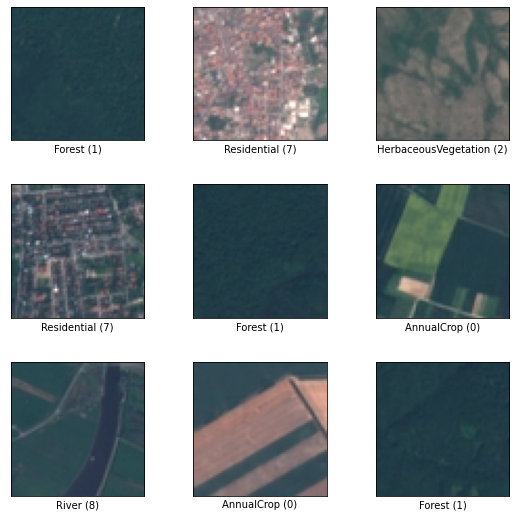

In [3]:
# installations
!pip install -qU tensorflow_datasets

# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random as random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from keras.utils import np_utils
import tensorflow_datasets as tfds
from keras.applications.resnet import preprocess_input

# download data
ds, ds_info = tfds.load('eurosat/rgb',
                        with_info=True,
                        split='train',
                        data_dir='.')

tfds.show_examples(ds, ds_info);

### Under the hood

In [4]:
df = tfds.as_dataframe(ds, ds_info)[:18000]
print(np.stack(df['image'].values).shape)
df.sample(10)

(18000, 64, 64, 3)


filename  \
17146  b'HerbaceousVegetation_2230.jpg'   
1676          b'PermanentCrop_2407.jpg'   
2032                b'Highway_1441.jpg'   
15917            b'Industrial_1394.jpg'   
5261          b'PermanentCrop_2488.jpg'   
5010          b'PermanentCrop_1066.jpg'   
9674                 b'Forest_1232.jpg'   
8170                 b'Forest_1009.jpg'   
7668   b'HerbaceousVegetation_2412.jpg'   
14905            b'Industrial_1614.jpg'   

                                                   image  label  
17146  [[[121, 117, 114], [121, 117, 116], [129, 127,...      2  
1676   [[[186, 148, 139], [186, 148, 139], [184, 145,...      6  
2032   [[[70, 87, 94], [69, 88, 94], [61, 81, 90], [5...      3  
15917  [[[41, 68, 79], [40, 68, 79], [40, 68, 79], [4...      4  
5261   [[[50, 78, 90], [50, 76, 89], [52, 75, 89], [5...      6  
5010   [[[201, 170, 142], [201, 169, 144], [196, 163,...      6  
9674   [[[24, 44, 69], [24, 44, 69], [25, 45, 69], [2...      1  
8170   [[[33, 47, 60], [31, 48, 58], [33, 50, 60], [3...      1  
7668   [[[89, 103, 129], [87, 103, 128], [86, 102, 12...      2  
14905  [[[69, 95, 92], [70, 96, 93], [67, 96, 94], [6...      4

### Data Distribution

In [5]:
df.groupby('label')['label'].value_counts()

label  label
0      0        2012
1      1        2035
2      2        1970
3      3        1690
4      4        1660
5      5        1326
6      6        1631
7      7        2006
8      8        1664
9      9        2006
Name: label, dtype: int64

### Training & Test Datasets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(np.stack(df['image'].values),
                                                    np.stack(df['label'].values), 
                                                    test_size=0.333333, 
                                                    shuffle=True,
                                                    random_state=10)

X2_train = preprocess_input(X_train).repeat(2, axis=1).repeat(2, axis=2)
X2_test = preprocess_input(X_test).repeat(2, axis=1).repeat(2, axis=2)

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (12000, 64, 64, 3) (12000, 10)
Test:  (6000, 64, 64, 3) (6000, 10)


## AI Model

### Pretrained Microsoft [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network)

In [7]:
from keras.applications.resnet import ResNet50
model_base = ResNet50(include_top=False,
                      pooling='avg',
                      input_tensor=layers.Input(shape=(128, 128, 3)))
model_base.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

### Custom Classification Layer

In [8]:
def resnet():
  model_base.trainable = False

  model = keras.Sequential([
      model_base,
      layers.Flatten(),
      layers.Dense(128, activation='relu', name='dense_1'),
      layers.Dropout(0.5, name='drop_1'),
      layers.Dense(64, activation='relu', name='dense_2'),
      layers.Dropout(0.5, name='drop_2'),
      layers.Dense(10, activation='softmax', name='output')
  ])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

### Training

In [9]:
%%time
model = resnet()

history = model.fit(
    X2_train,
    y_train,
    validation_split=0.15,
    epochs=10,
    batch_size=256,
    verbose=1)

Epoch 1/10
40/40 [==============================] - 22s 202ms/step - loss: 1.7454 - accuracy: 0.4100 - val_loss: 0.6516 - val_accuracy: 0.8533
Epoch 2/10
40/40 [==============================] - 6s 158ms/step - loss: 0.8221 - accuracy: 0.7346 - val_loss: 0.3274 - val_accuracy: 0.9089
Epoch 3/10
40/40 [==============================] - 6s 161ms/step - loss: 0.5421 - accuracy: 0.8322 - val_loss: 0.2448 - val_accuracy: 0.9256
Epoch 4/10
40/40 [==============================] - 6s 158ms/step - loss: 0.4377 - accuracy: 0.8676 - val_loss: 0.2159 - val_accuracy: 0.9356
Epoch 5/10
40/40 [==============================] - 6s 158ms/step - loss: 0.3642 - accuracy: 0.8918 - val_loss: 0.2059 - val_accuracy: 0.9389
Epoch 6/10
40/40 [==============================] - 6s 159ms/step - loss: 0.3283 - accuracy: 0.9048 - val_loss: 0.1908 - val_accuracy: 0.9417
Epoch 7/10
40/40 [==============================] - 6s 158ms/step - loss: 0.2897 - accuracy: 0.9139 - val_loss: 0.1814 - val_accuracy: 0.9456
Epoch

In [10]:
''' On my local machine, with CPU only, this training takes almost 1 hour (much more than these couple of minutes on the GPU)
Epoch 1/10
40/40 [==============================] - 239s 6s/step - loss: 1.6473 - accuracy: 0.4522 - val_loss: 0.5686 - val_accuracy: 0.8572
Epoch 2/10
40/40 [==============================] - 308s 8s/step - loss: 0.7850 - accuracy: 0.7522 - val_loss: 0.3268 - val_accuracy: 0.9089
Epoch 3/10
40/40 [==============================] - 316s 8s/step - loss: 0.5390 - accuracy: 0.8367 - val_loss: 0.2553 - val_accuracy: 0.9256
Epoch 4/10
40/40 [==============================] - 320s 8s/step - loss: 0.4184 - accuracy: 0.8738 - val_loss: 0.2384 - val_accuracy: 0.9317
Epoch 5/10
40/40 [==============================] - 304s 8s/step - loss: 0.3452 - accuracy: 0.8989 - val_loss: 0.2091 - val_accuracy: 0.9372
Epoch 6/10
40/40 [==============================] - 322s 8s/step - loss: 0.2957 - accuracy: 0.9126 - val_loss: 0.2013 - val_accuracy: 0.9450
Epoch 7/10
40/40 [==============================] - 295s 7s/step - loss: 0.2736 - accuracy: 0.9177 - val_loss: 0.1933 - val_accuracy: 0.9406
Epoch 8/10
40/40 [==============================] - 272s 7s/step - loss: 0.2409 - accuracy: 0.9280 - val_loss: 0.1972 - val_accuracy: 0.9444
Epoch 9/10
40/40 [==============================] - 243s 6s/step - loss: 0.2239 - accuracy: 0.9356 - val_loss: 0.1975 - val_accuracy: 0.9433
Epoch 10/10
40/40 [==============================] - 272s 7s/step - loss: 0.2048 - accuracy: 0.9406 - val_loss: 0.1865 - val_accuracy: 0.9533
CPU times: total: 3h 29min 40s
Wall time: 49min 18s
'''

' On my local machine, with CPU only, this training takes almost 1 hour (much more than these couple of minutes on the GPU)\nEpoch 1/10\n40/40 [==============================] - 239s 6s/step - loss: 1.6473 - accuracy: 0.4522 - val_loss: 0.5686 - val_accuracy: 0.8572\nEpoch 2/10\n40/40 [==============================] - 308s 8s/step - loss: 0.7850 - accuracy: 0.7522 - val_loss: 0.3268 - val_accuracy: 0.9089\nEpoch 3/10\n40/40 [==============================] - 316s 8s/step - loss: 0.5390 - accuracy: 0.8367 - val_loss: 0.2553 - val_accuracy: 0.9256\nEpoch 4/10\n40/40 [==============================] - 320s 8s/step - loss: 0.4184 - accuracy: 0.8738 - val_loss: 0.2384 - val_accuracy: 0.9317\nEpoch 5/10\n40/40 [==============================] - 304s 8s/step - loss: 0.3452 - accuracy: 0.8989 - val_loss: 0.2091 - val_accuracy: 0.9372\nEpoch 6/10\n40/40 [==============================] - 322s 8s/step - loss: 0.2957 - accuracy: 0.9126 - val_loss: 0.2013 - val_accuracy: 0.9450\nEpoch 7/10\n40/40

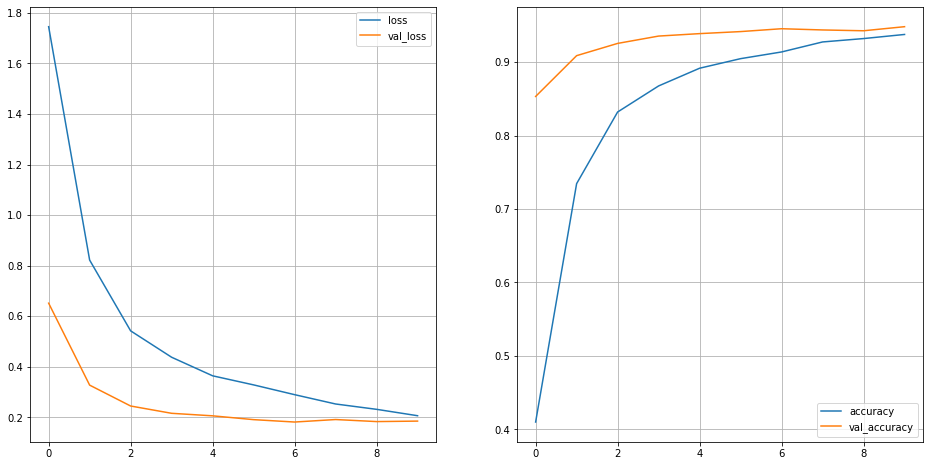

In [11]:
df_history = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

cut_first_n = 0
df_history.loc[cut_first_n:, ['loss', 'val_loss']].plot(ax=ax[0])
df_history.loc[cut_first_n:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].grid(which='both')
ax[1].grid(which='both')
plt.show()

### Evaluation

In [12]:
scores = model.evaluate(X2_test, y_test, verbose=0)
print("Error: %.2f%%" % (100-scores[1]*100))

Error: 5.57%


In [13]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X2_test)
cf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

print(cf_matrix)

[[642   1   1   5   0   5   8   0   3   5]
 [  1 662   5   0   0   3   0   1   0   5]
 [  0  11 636   3   0   3  10   4   1   0]
 [  7   0   2 520   7   3   3   3  23   1]
 [  1   0   0   3 524   0   2   9   1   0]
 [  4   9  13   2   0 441   1   1   3   3]
 [ 15   0  31   9  11   7 446   4   4   0]
 [  0   1   4   0   4   0   1 637   1   0]
 [  6   1   1  44   5   3   0   0 490   3]
 [  0   1   0   0   0   0   0   0   2 668]]


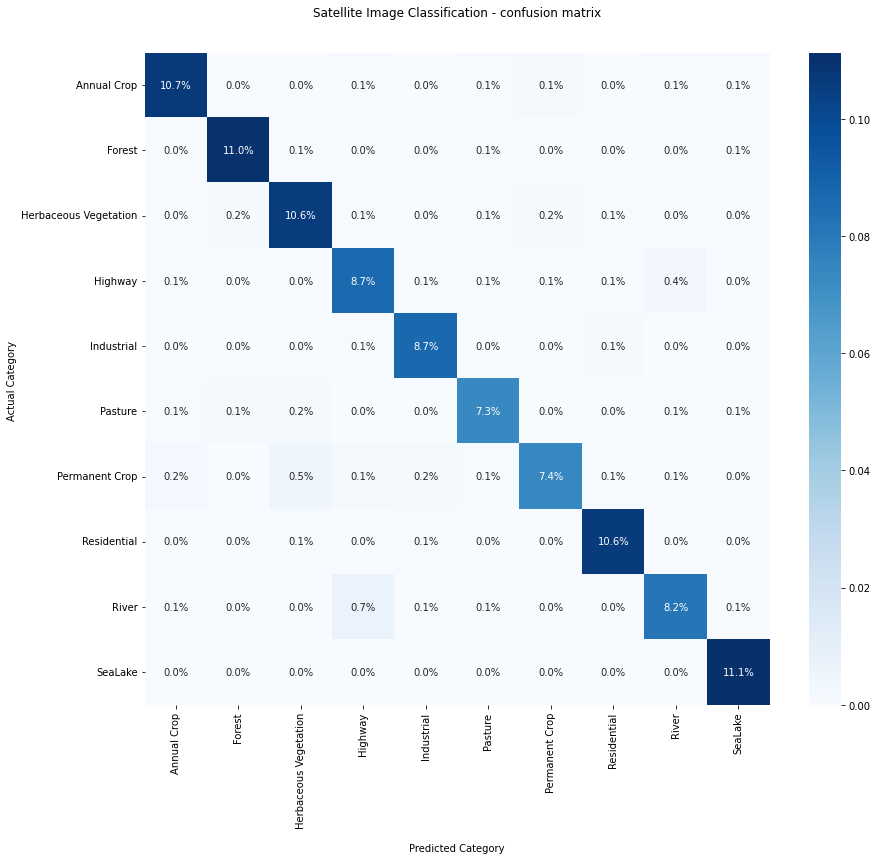

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(14, 12))
sns.heatmap(cf_matrix/len(X_test), annot=True, fmt=".1%", cmap='Blues', ax=ax)

ax.set_title('Satellite Image Classification - confusion matrix\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

labels = ['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial', 'Pasture', 'Permanent Crop', 'Residential', 'River', 'SeaLake']
ax.xaxis.set_ticklabels(labels, rotation=90)
ax.yaxis.set_ticklabels(labels, rotation=0)

## Display the visualization of the Confusion Matrix.
plt.show()

### Predictions

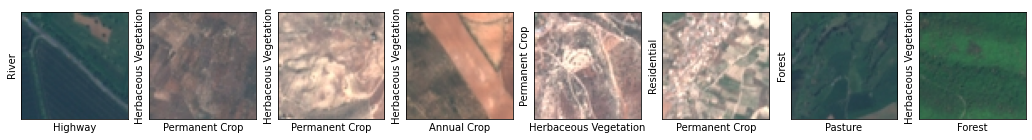

In [15]:
labels = ['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial', 'Pasture', 'Permanent Crop', 'Residential', 'River', 'SeaLake']

N = 8
fig, ax = plt.subplots(1, N, figsize=(18, 4))
predictions = []
while len(predictions) < N:
  i = random.randint(0, X_test.shape[0])
  if (np.argmax(model.predict(X2_test[i].reshape(1, *X2_test[i].shape))) != np.argmax(y_test[i])):
  #if True:
    predictions.append(np.argmax(model.predict(X2_test[i].reshape(1, *X2_test[i].shape))))
    ax[len(predictions)-1].imshow(X_test[i])

    ax[len(predictions)-1].set_xlabel(labels[np.argmax(y_test[i])])
    ax[len(predictions)-1].set_xticks([])

    ax[len(predictions)-1].set_ylabel(labels[predictions[-1]])
    ax[len(predictions)-1].set_yticks([])
plt.show()

# History

## Since 1989

- Python started as a hobby programming project of **Guido van Rossum** over the Christmas holidays in 1989.

- It was inspired by the simplicity of the [ABC programming language](https://en.wikipedia.org/wiki/ABC_(programming_language)). Python is much easier to code than C, C++, Perl or other languages of that time. Yet it is powerful!

- In 1991, version 0.9.0 was published and open to the world.

- Python is an **interpreted language**, meaning you write the **text code** to a file, and an **interpreter**, reads that file line by line and turns that code into **instructions for the computer**.


<img src="https://upload.wikimedia.org/wikipedia/commons/e/e2/Guido-portrait-2014-drc.jpg" alt="guido" width="1000px"/>


## The Zen of Python

In [16]:
%%html
<iframe src="https://en.wikipedia.org/wiki/Zen_of_Python#Principles" width="1000" height="600"></iframe>

## The Name

Guido was a big fan of **Monty Python's Flying Circus**.

In [17]:
%%html
<iframe width="1000" height="562" src="https://www.youtube.com/embed/2AxiATxLofk" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## Python for Scientific Use

- Python version 1.0 was released in 1994

- Introduction of `lambda`, `map`, `filter`, and `reduce` (inspired from [Lisp](https://en.wikipedia.org/wiki/Lisp_(programming_language)))
- The [National Institute for Standards and Technology](https://www.nist.gov/) introduced Python for scientific use. **Many scientists were great at research and data but not necessarily great at coding** - Python was the solution to that problem.

<img src="https://images.unsplash.com/photo-1541233349642-6e425fe6190e?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1035&q=80" alt="guido" height="600px"/>

## Computer Programming for Everybody

- Funding proposal sent to [DARPA](https://en.wikipedia.org/wiki/DARPA) in August 1999. _What will happen if users can program their own computer?_
  - develop a new computing curriculum suitable for high school and college students
  - create better, easier-to-use tools for program development and analysis
  - build a user community around all of the above, encouraging feedback and self-help

<img src="https://images.unsplash.com/photo-1461088945293-0c17689e48ac?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2342&q=80" alt="everyone" width="1000px"/>

## Python 2.0

- Python 2.0 was released in 2000.
- `Comprehension` and `garbage collection`
- In 2001, the [Python Software Foundation](https://www.python.org/psf/) was created, with the _mission of the Python Software Foundation is to promote, protect, and advance the Python programming language, and to support and facilitate the growth of a diverse and international community of Python programmers_.
- The yearly [PyCon](https://pycon.org/) conference was created.

## Communities & Start-ups

Python enters the **Web Development** realm. Frameworks like [Jinja](https://en.wikipedia.org/wiki/Jinja_(template_engine)), [Flask](https://flask.palletsprojects.com/en/2.2.x/), and [Django](https://www.djangoproject.com/) developed big communities almost immediately.

Python gained traction in the **start-up world** (not so much in large enterprises)
- ease of use
- rapid development
- low cost to host it

<img src="https://images.unsplash.com/photo-1559136555-9303baea8ebd?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2340&q=80" alt="everyone" width="1000px"/>


## Python 3.0

- Released in 2008
- Python 3 is not compatible with Python 2 (The guiding principle of Python 3 was _reduce feature duplication by removing the old ways of doing things_)

## Dropbox

- Dropbox started in 2007 and counted 3 million users in 2009.
- It was written in Python!
- Seeing Python scale so well, paved its way into enterprise adoption.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Dropbox_logo_2017.svg/2880px-Dropbox_logo_2017.svg.png" alt="everyone" width="1000px"/>

## Financial Crisis

Financial institutions began
- looking at data to spot patterns
- make decisions
- manage operations.

There was an intense focus on reducing risk. These companies had **plenty of data but no great way to access it**.

💐 Python came to the rescure and really florished:
- **Pandas** for quantitative analysis on (financial) data
- **NumPy**
- **SciKit**
- **Matplotlib**

<img src="https://images.unsplash.com/photo-1611974789855-9c2a0a7236a3?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2340&q=80" alt="everyone" width="1000px"/>

- Where previously statisticians and analysts used **R** for these sorts of things, they found Python to be much more palatable for those folks without a heavy development background.

- Python soon became the **top choice for data science**



## 2022

[Kaggle](https://www.kaggle.com/) is the world’s largest community of data scientists:
- 8 million members
- 300 competitions
- 4 million solutions
- 50'000 datasets

In the [2021 Kaggle Machine Learning & Data Science Survey](https://www.kaggle.com/c/kaggle-survey-2021/data), Python leads in most data science related categories.

In [18]:
from requests import get
import pandas as pd

def download_save(url, filename):
  res = get(url)
  if res.status_code != 200:
    print(f"Couldn't fetch data from {url}")
  else:
    csv_file = open(filename, 'wb')
    csv_file.write(res.content)
    csv_file.close()
    
download_save('https://kauthentechstorage.blob.core.windows.net/datasets/kaggle_survey_2021_responses.csv', 'kaggle_survey_2021_responses.csv')
df = pd.read_csv('kaggle_survey_2021_responses.csv', header=[0, 1], low_memory=False)

In [19]:
print(f'{len(df)} responses')

25973 responses


In [20]:
df.sample(5)

Time from Start to Finish (seconds)                          Q1  \
                    Duration (in seconds) What is your age (# years)?   
2770                                  614                       45-49   
24321                                 421                       40-44   
19785                               83072                       35-39   
4771                                  229                       22-24   
8158                                12533                       40-44   

                                          Q2  \
      What is your gender? - Selected Choice   
2770                                     Man   
24321                                    Man   
19785                                    Man   
4771                                     Man   
8158                       Prefer not to say   

                                                      Q3  \
               In which country do you currently reside?   
2770                                               India   
24321                                              Other   
19785  United Kingdom of Great Britain and Northern I...   
4771                                               India   
8158                                           Australia   

                                                                                                                   Q4  \
      What is the highest level of formal education that you have attained or plan to attain within the next 2 years?   
2770                              I prefer not to answer                                                                
24321                                    Master’s degree                                                                
19785                                    Master’s degree                                                                
4771                                     Master’s degree                                                                
8158                              I prefer not to answer                                                                

                                                                                                           Q5  \
      Select the title most similar to your current role (or most recent title if retired): - Selected Choice   
2770                                               Other                                                        
24321                                  Software Engineer                                                        
19785                                     Data Scientist                                                        
4771                                        Data Analyst                                                        
8158                                      Data Scientist                                                        

                                                                     Q6  \
      For how many years have you been writing code and/or programming?   
2770                                           < 1 years                  
24321                                        10-20 years                  
19785                                         5-10 years                  
4771                                           1-3 years                  
8158                                          5-10 years                  

                                                                                                         Q7_Part_1  \
      What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python   
2770                                                 NaN                                                             
24321                                             Python                                                             
19785                                             Python                                          

### Most used Language

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def generate_barplot(df, title):
  fig, ax = plt.subplots(1, 1,figsize=(12, 8))
  sns.barplot(data=df.reset_index().sort_values(by='count', ascending=False),
              x='count',
              y='index').set_title(title)
  plt.show()

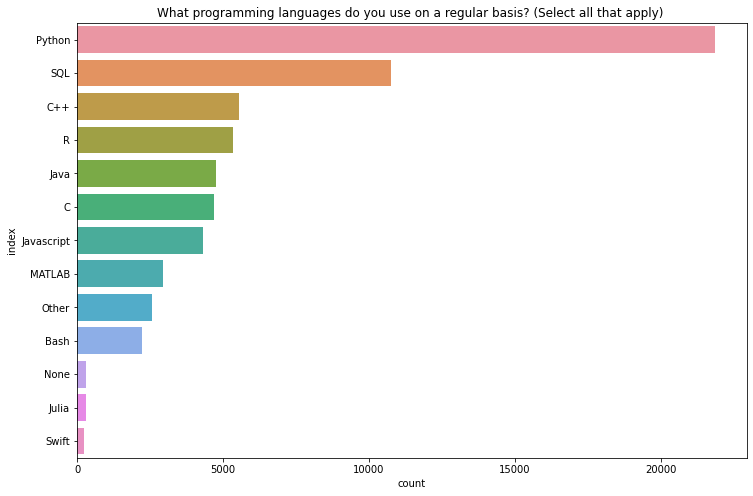

In [22]:
columns = [col for col in df.columns if 'Q7' in col[0]]
dict_data = {k[1].split(' - ')[-1].strip(): v for k, v in df[columns].describe().loc['count'].iteritems()}
df_data = pd.DataFrame.from_dict(dict_data, orient='index', columns=['count'])
generate_barplot(df_data, columns[0][1].split('-')[0])

### Most recommended language

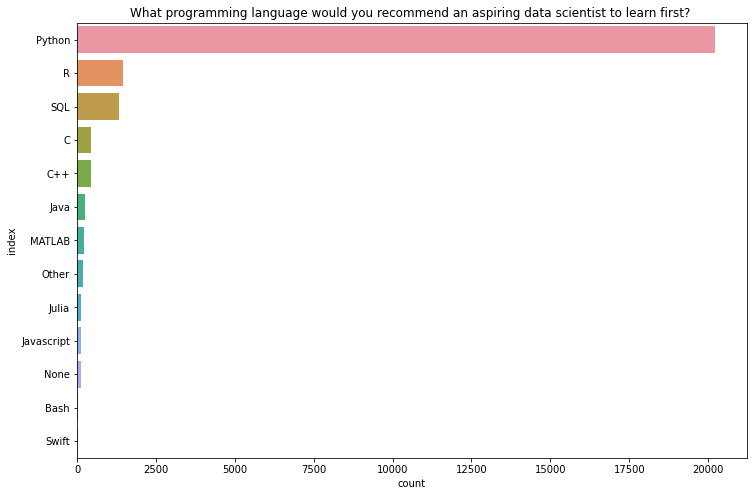

In [23]:
columns = [col for col in df.columns if 'Q8' in col[0]]
df_data = df[columns].squeeze().value_counts().rename('count')
generate_barplot(df_data, columns[0][1].split('-')[0])

### Most used IDE

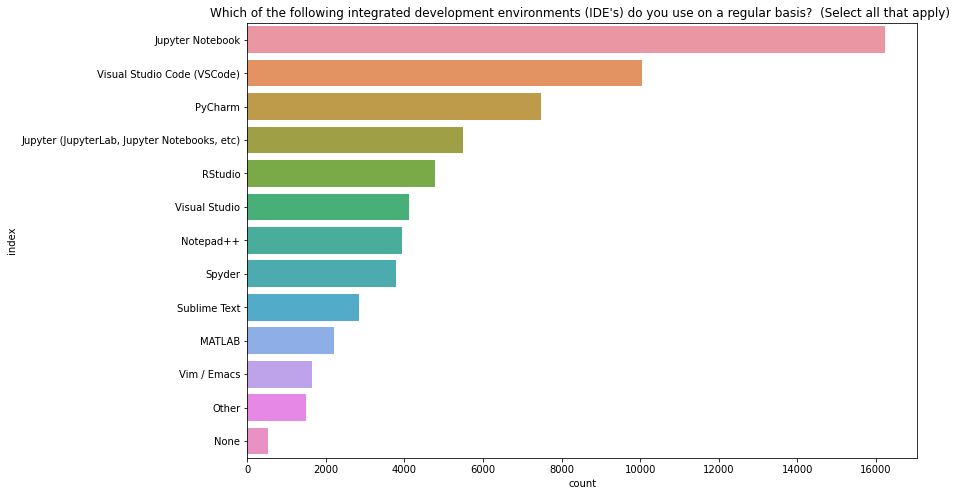

In [24]:
columns = [col for col in df.columns if 'Q9' in col[0]]
dict_data = {k[1].split(' - ')[-1].strip(): v for k, v in df[columns].describe().loc['count'].iteritems()}
df_data = pd.DataFrame.from_dict(dict_data, orient='index', columns=['count'])
generate_barplot(df_data, columns[0][1].split('-')[0])

### Most used notebook products

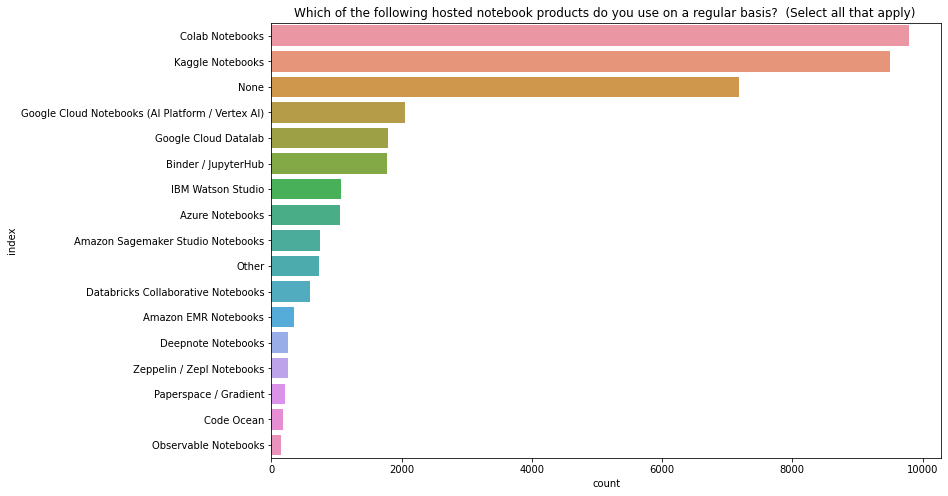

In [25]:
columns = [col for col in df.columns if 'Q10' in col[0]]
dict_data = {k[1].split(' - ')[-1].strip(): v for k, v in df[columns].describe().loc['count'].iteritems()}
df_data = pd.DataFrame.from_dict(dict_data, orient='index', columns=['count'])
generate_barplot(df_data, columns[0][1].split('-')[0])

### Most used visualization libraries

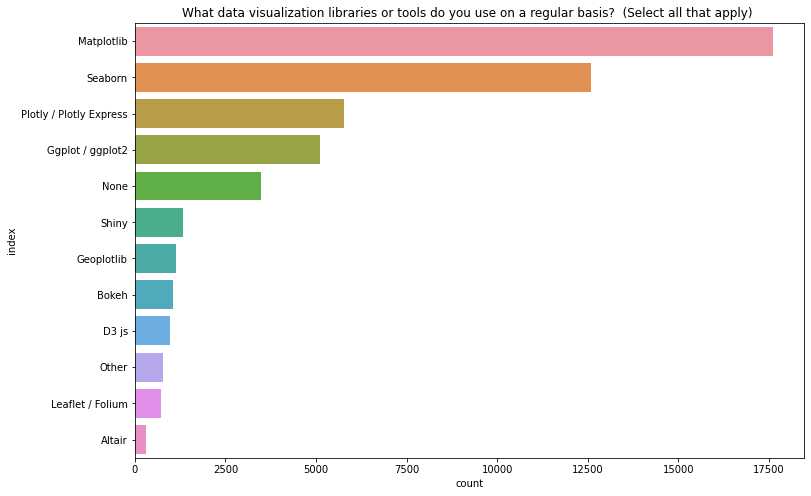

In [26]:
columns = [col for col in df.columns if 'Q14' in col[0]]
dict_data = {k[1].split(' - ')[-1].strip(): v for k, v in df[columns].describe().loc['count'].iteritems()}
df_data = pd.DataFrame.from_dict(dict_data, orient='index', columns=['count'])
generate_barplot(df_data, columns[0][1].split('-')[0])

### Regularly used ML frameworks

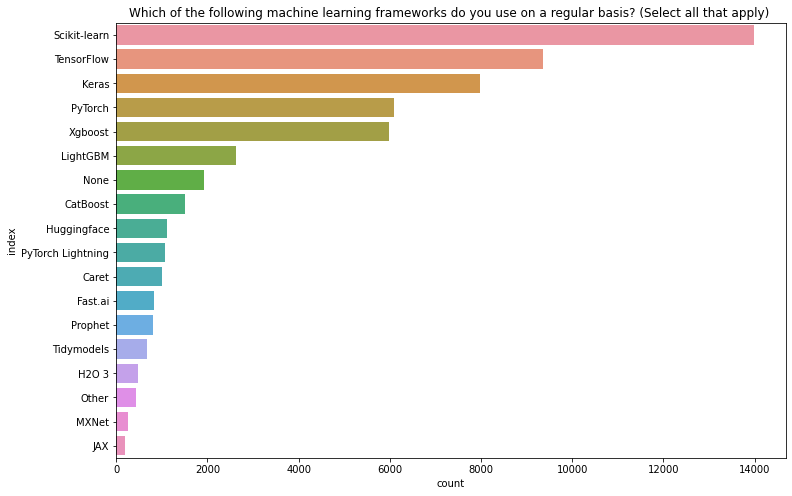

In [27]:
columns = [col for col in df.columns if 'Q16' in col[0]]
dict_data = {k[1].split(' - ')[-1].strip(): v for k, v in df[columns].describe().loc['count'].iteritems()}
df_data = pd.DataFrame.from_dict(dict_data, orient='index', columns=['count'])
generate_barplot(df_data, columns[0][1].split('-')[0])

### Regularly used ML algorithms

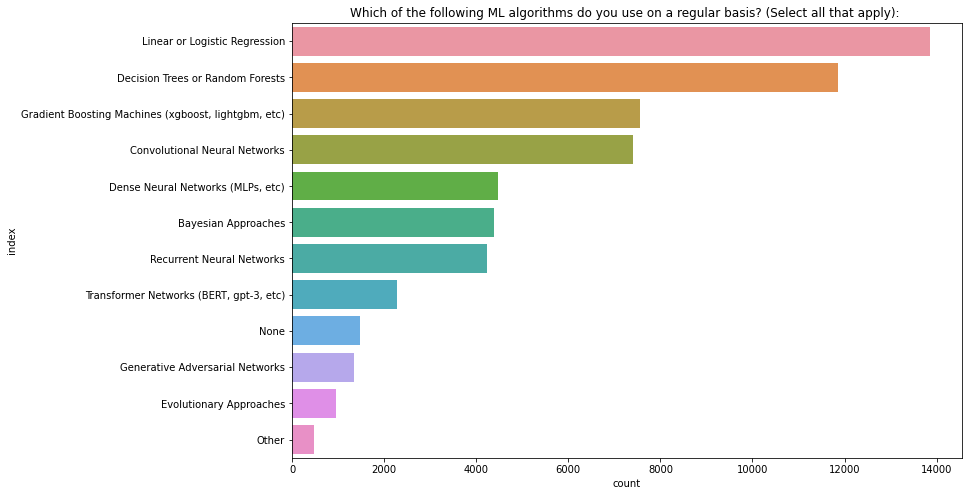

In [28]:
columns = [col for col in df.columns if 'Q17' in col[0]]
dict_data = {k[1].split(' - ')[-1].strip(): v for k, v in df[columns].describe().loc['count'].iteritems()}
df_data = pd.DataFrame.from_dict(dict_data, orient='index', columns=['count'])
generate_barplot(df_data, columns[0][1].split('-')[0])

## Future

- Python for Mobile Devices ?
- Python for Multi-Core processors? (_Spark_ helps, but _Julia_ has it built in)
- Python as sort of a _glue language_ to other technologies?

<img src="https://images.unsplash.com/photo-1546188994-07c34f6e5e1b?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2342&q=80" alt="future" width="1000px"/>

# Python Environment

In [29]:
from IPython import display
from base64 import b64decode

## Eurostat: Datalab

In [30]:
%%html
<iframe src="https://datalab.dev.estat-cloudlab.click/home" width="1000" height="600"></iframe>

## Cloud: Colaboratory

### Google Account

https://accounts.google.com/

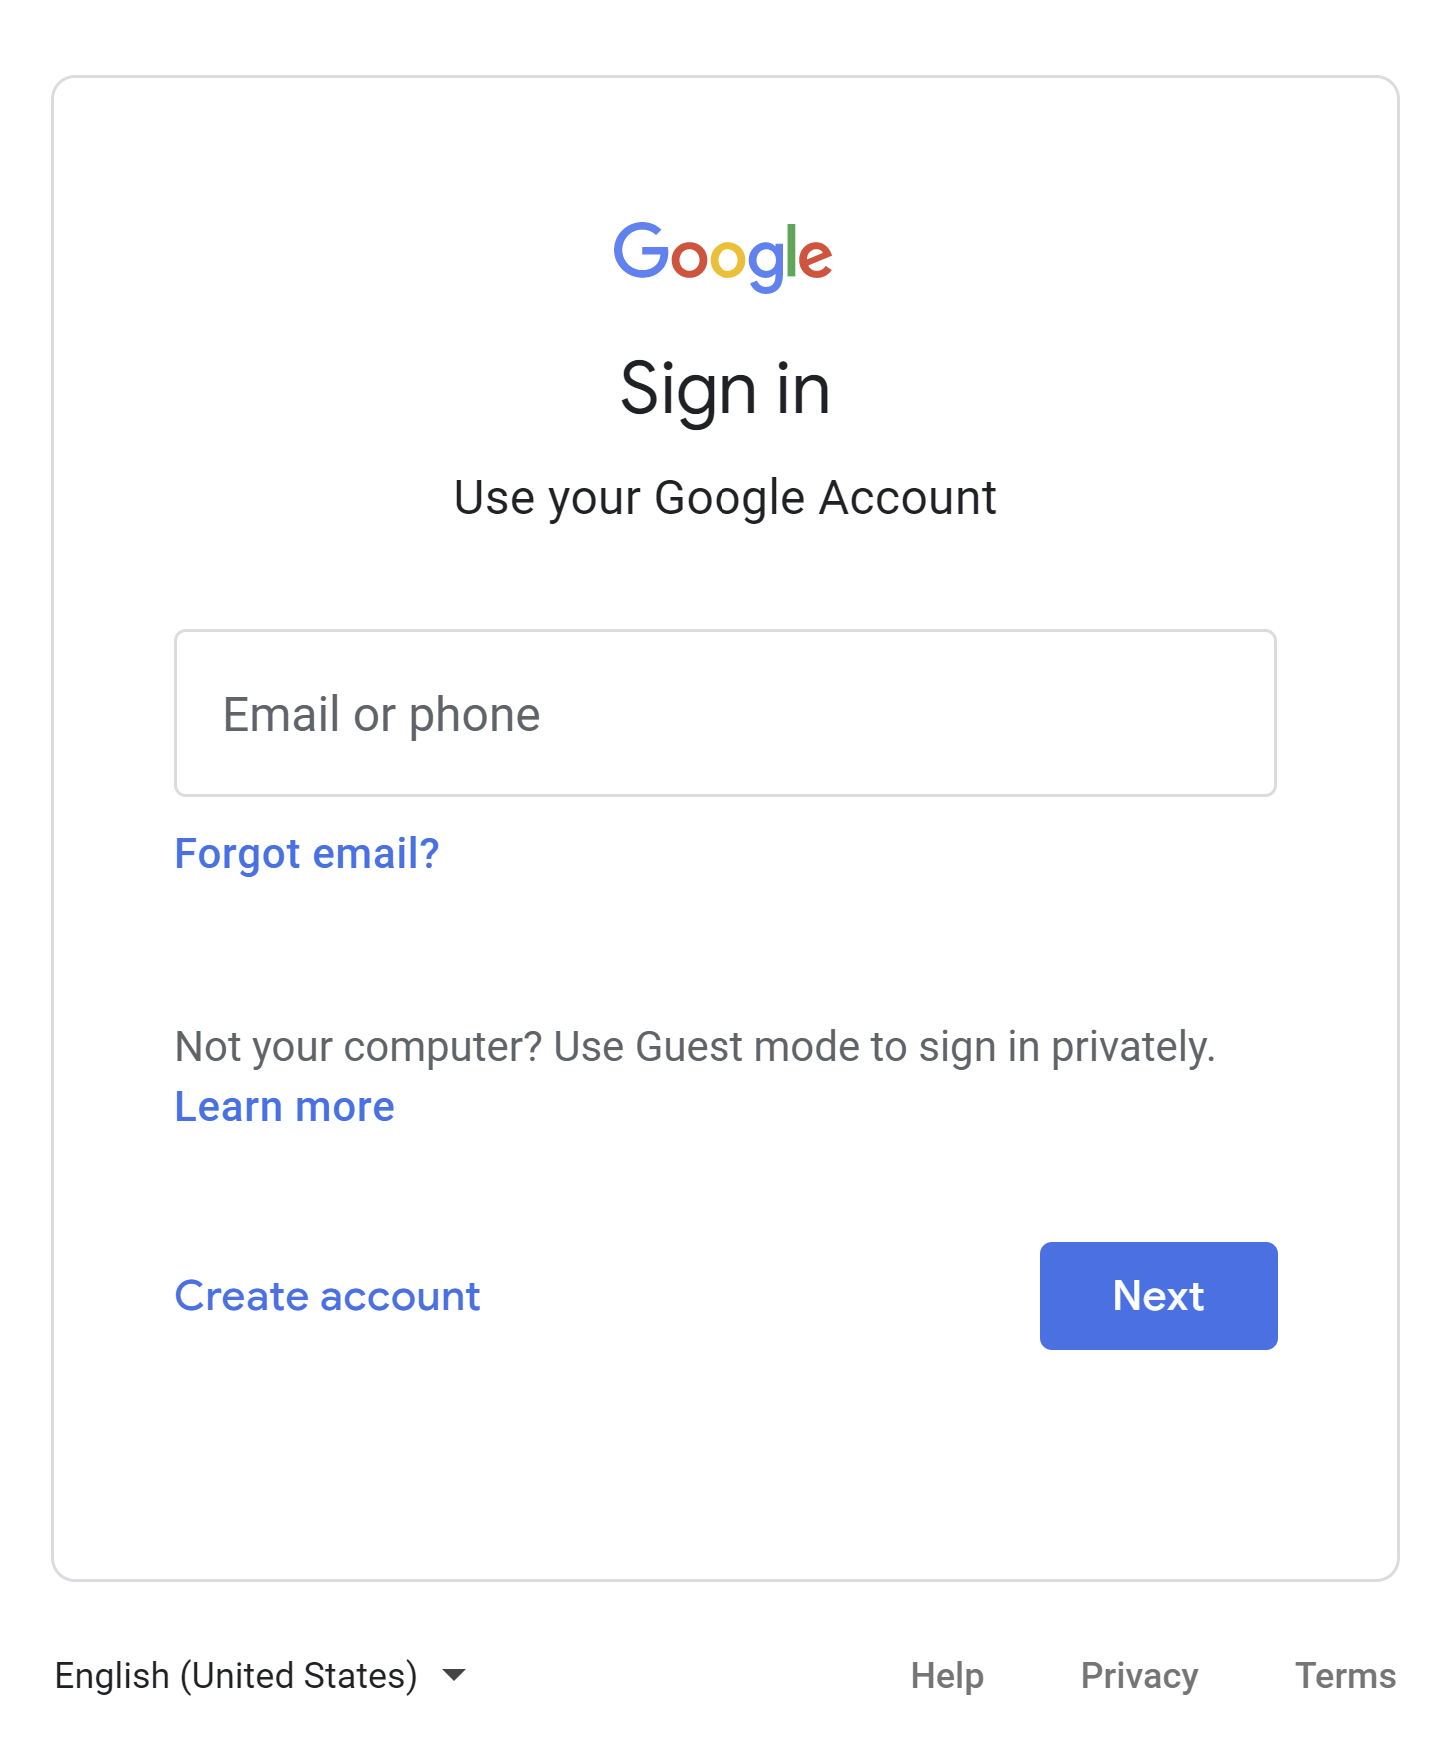

In [31]:
#@title Sign into Google Account
base64_data = "iVBORw0KGgoAAAANSUhEUgAABakAAAbhCAYAAAChWQxWAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAALEoAACxKAXd6dE0AAP+lSURBVHhe7N0FmB3l2QbgN8SNECA4Ce4QoLhbkVKgUIoWaKFIgSJtgQpWXMtfirsUWtyKFkuQ4G6BIMECSSDuwr/f7GxWsprsZnY39811Luab4zNzTpJn3vN+bX4oEQAAAAAAUIB58v8DAAAAAMAcJ6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwbX4okS9TYurUqTFhwqSYOGlSTJ48JRtPnTotbCYAAAAAYFa0adMm2rVrW3JpFx06tI9OHTtG584dszFC6sy0adNizNhxMWbMuJg0aXK+FgAAAACg6XTs2CG6d+8a3bt1jbZt2+Zr5z5zdUidqqRHjBwdo0aNydcAAAAAAMx5PXp0j57zzTtXVlfPtSH19yNGxfffj8xHlXXu3Cm7dOzQPtq3b5+V4qeS/HQBAAAAAKivFL+mS2opPGXKlJg0eUpMmDAxu1Rn/vnni/l79shHc4e5LqRO7TyGDvtuprYenTp1jHm7d4tu3brEPPOYTxIAAAAAaDrTp0+PsWPHx+gxY2PixEn52lKpDchCvRbI/j83mKtC6tRz+tuhw/NRqRROpzL6rl275GsAAAAAAOaccePGZ22Jq4bVCy+0YNazurWba0LqkaNGx/DhI/JRqQUXnD/m69E9HwEAAAAAFGfkqDExfPj3+ajUggv2jPl6zJuPWqe5IqSuGlB36NA+Owsxt5TLAwAAAAAtQ2pTnLpBTJ48JV/T+oPqVh9SV23xkSZEXHSRXvpOAwAAAADNUupXPeSbYZUmV2zNrT9adVJbdtahTAqoF1t0IQE1AAAAANBspfwy5ZgpzyyTcs6Ud7ZGrTqtHTrsu3yptMVHqqBu06ZNvgYAAAAAoHlKOWbKM1OuWaZi3tmatNqQ+vsRoyqdWUjl8CqoAQAAAICWIuWZKdcsk/LOlHu2Nq0ytZ06dWp8//3IfJQai89vkkQAAAAAoMVJuWbKN8uk3DPln61JqwypR4wcnS9FdOrUMebr0T0fAQAAAAC0LCnfTDlnmYr5Z2vQ6kLqadOmxahRY/JRRM/55s2XAAAAAABapoo5Z8o/Uw7aWrS6kHrM2HH5UmkVddeuXfIRAAAAAEDLlHLOitXUFXPQlq71hdRjynfOvN275UsAAAAAAC1bxbyzYg7a0rWqkDo1DE8zXJbp1k0VNQAAAADQOlTMO1MO2lomUGxVIfWECZPypYjOnTvFPPO0ukJxAAAAAGAulfLOlHuWqZiHtmStKsWdOKlySA0AAAAA0JpUzD0r5qEtWasKqSdPnpIvRXTs0D5fAgAAAABoHSrmnhXz0Jas1fWkLtO+vZAaAAAAAGhdKuaeelI3Q1OnTsuXItq1a5svAQAAAAC0DhVzz4p5aEvWqkLqH374IV+KaNOmTb4EAAAAANA6VMw9K+ahLVmrCqkrElIDAAAAAK1Na8w9W21IDQAAAABA8yekBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMG1+KJEvt3iDPh6cL0Ust2yffAkAYO41bNT0eH/wlBg+cnp8MHhqTJj4Q3z1zbT82lKdO7WJxRdpG507RvRZpF30XrhdrNynbXTtpJ4BAACao9aWgwqpAQBamc++mRbPvjUp3hg4Jb4fOT1f23ApuN64b4f40YodolcPgTUAADQXQupmTEgNAMzN+r81Ke7vN3G2gumarL5iu9huvU6xylLt8zUQ8fDAR+OO1/6Vj2Z29BbHRd9F18hHAAA0ltaWgyqJAQBo4VI4/cd/joob7hvfJAF18vbAqXHBzWPjrJvHZC1EoMwPP0yv8QIAAPUhpAYAaKFSW48UGjdlOF3VoM+mxqlXjY67+0/I1wAAAMweITUAQAv0yEsT47SrR2eh8ZyWJl/8b7+JWUA+bqJqWQAAYPYIqQEAWpAUCl90+5i4/dHiK5lTQH7K1WOyim4AAIBZJaQGAGghUkB9zs1js/7Qs2q5Pu1mXNZbo8OM5Z7zzdpfC1ObkfP1qQYAAGZDmx9K5MstXmub1RIAoExZQP1VA6uWF1u4bWzct0Os3Kd9LLVI23xtzV4ZOCXe/2xKDHhzckycVL+/Jqaw+7BduuYj5iYPD3w0bn/1pnw0s2O2PCH6LrpGPgIAoLG0thxUJTUAQDM3KwF1Co7PPapHnHHIvLHD+p3qFVAn66zYPvbbrktcdvx8ccDOXeqssBZQAwAAs0tIDQDQzF11/7h6B9SpdUcKp1Nw3KvH7P1Vb/O+HePC3/XIwupOHdvka8sJqAEAgMYgpAYAaMbu6j++3j2of7Ft5/jL/t1nO5yuKoXV5x81bxaAlxFQAwAAjUVIDQDQTL332ZR4sN+kfFSzVOV88sGlbT2aStdO82QBeAqnBdQAAEBjElIDADRT//7fhHypZimgPn7/7vXuOT27UjgtoAYAABqTkBoAoBlKbT7q6kM9pwNqAACApiCkBgBoZsZNnB5Pvjg5H9Vsz+06C6gBAIAWT0gNANDMPPLSxJgw8Yd8VL3VV2yXTWgIAADQ0gmpAQCamQFvTsmXqpfafPxyO32hAQCA1kFIDQDQjLwycEp8P3J6Pqre1ht0iF49/DUOAABoHfzrBgCgGXnlg9p7Uacq6u3X65SPAAAAWr42P5TIl1u8QR8Pzpcillu2T74EANByHHH+yFr7Ua+3Roc4bJe5q9XHxG+HxOh3Xo/JQ4fEuHffyNeW67TUctFhoUWj5/qbRqeFF83XNr0fpo6KySMHxNRx78YPU8aU/P/D/JqIdl1XiDbtu0fbjktExwW3jzbteuTXzBnDRk2PVwdOjvElx9Lgb6bGhEml63sv3Da6dGoTa6/QoVEm3Xx44KNx+6s35aOZHbPlCdF30TXyUcOlfT/ixWdi2rgxM+37rquume33eVdba47udwCA5qC15aBCagCAZuKzb6bFaVePzkfVO3yPbrHOiu3zUes1deyY+OaB22PMS8/GpC8/ztfWreMSy0b39TaJRXbaI9p1656vbXwTv7ktxn5wcT6qW7uefaLDAltG50X2aLLAetzE6fHMW5PjuTcnx1clx1Jd5p9vntiob4fYbr2O0bVT6Q8sU7g9bGTN912lT+VjrylC6rJ9P6rfIzHlu2/ztbVL+32Bn/4iFtr6J/kaAIDWTUjdjAmpAYCW7OEXJ8Ydj03IR9W77qSe+VLrVBZQfv/wXTF9wth8bcPN07lbzL/Dzxs9rE7h9PjPro3pE8flaxpmnk5do8tSB0WnRfbM1zSO/m9NitsenVBrFX5NUli917ZdspMfd/UfHw/2y8uuq1H1+GvskPrLf187W/s+hdWLHfi76LH62vkaAIDWqbXloHpSAwA0E8PrmDBxuT7t8qXWadwnH8VHJx0Vw+++cbYC6iTdPz3OwD8emD3u7Jo28YsY8eouWfX0rAbUSbpveoz0WFPGvpOvnXWpevqkq0fHDfeNn6WAOkkTdV52+9jo92bN4XRTS2093j/217O971PV/aenHZOF3QAAtBxCagCAZuKLb2tv0bDiUrPfQ7i5+u6F/vHxqUc3qLVHfaR2Eelxhz7+YL6m4SaPfC5GvvLLmDZmeL5m9qXHGv3GETFp+MP5moZL7WGO/+foerX2qI8b7x8fA96cko/mnHQS4cPjDmrUfZ/C7k/+cWY+AgCgudPuAwCgmTjrpjExaPDUfDSzX2zbOXZYv1M+mn11PV9jSK0kLvhd7T2YU4D89ZXn5qOms9ihJ8RC2+yYj+pnwjf/iXEf/DMfNY2uK/0uOi+yVz6qn/c+mxKX3jFulqunZ1Vjt/vIqudPOCgfNb55N9kuljn6r/kIAKD10O4DAIAmUVdg3GfhlldJnVpJ1CaFlHMioE7S84x6+7V8VLfUjmP8oMvzUdNJIXhDWn+kyQ2LCKgbW+o/nqrcm9LoZx+NIffdlo8AAGiuVFIDADQTB54+Il+q3h/36xarLNU+H82+OVFJnZx88Lyx1CIzB+ypD3Fq81DfHsRd19woeqy/aXRceNF8TcSkkscY9eIzMe6N5/M1tUsTKq5w/rXRqcJjVOeHqaPi+xd2Lvl/3dunbbcFo8OCm0W7bqtEm3bzltxndEwd+15MHt4/po2tX4uQNu3axXzr/CvadloyX1O91IP6nJvH1rvFx2ILt421VmoXfRZuH106RoyfFDH42ynx+gdT4+s62stUpzErqVMP6vq0+EiTTXb70cbRY4OSbdy1W3RcaNGYNHRItu+/e/COksf4JL9lzZY/99rouszy+QgAoOVrbTmokBoAoJlorSF1Ta970Fl/irGv1x0uz7vxttH7N0dHu27d8zUzS1W5n1/zjxj93GP5mpp1XrFvrHhG7S08Rn9wbEz+5qV8VL32C64S3ZY7udZgOU24OHbQaTFl+Hv5mpqlx+ux2tX5qHp39R8fD/are4LD1VdsF7/crmv06lHzDydTy5BbH5vQoLC6sULq+rZ4SScmlizZ97WdVEjV8YPP+2utE1rWZ58DALQk2n0AANAkOnVsky9VL1XBthYpWKwroE4VtEv+4YxY5pgTaw2ok3R9ul26fbpfbSYMfLPWth+p9UZdAXWSAuW6Kp/T9el2qe90XVKQnSZprElq81GfgPqAnbvEsXt0rzWgTtKJgzMOmTfWW6NDvmbOGXbnDflSzVIP8eX/ek6dVe89Vl87Vrn89lr3e9rnszN5JgAATUtIDQDQTCxRTUuMilKbhtbim9uuz5dqtuzfLo4FNtgsH9VPun26X11qe/5xH5+VL9Vs3jXPy5fqJ02MWJ/7jB98ab40s7uenpAv1SwF1Jv37ZiP6uewXbpmlddzSgqLp3z3bT6qXkMnuUwnKRY54Mh8VL36BOMAABRDSA0A0EIMG9E6urSlXtSpsrU2C//yiFnuIZzul+5fm/T8adLGqlJ7jqkjyn86WZ3OS+0WHebbOB/VX7pPl+UOyEfVS8+dXkNVqRf1S29NzkfV23Hzjg0OqMscsnPX6DnfnPmnwYinHs6Xqtdz290aFFCn42nwNf+Ib26qOeBPUjDekIkzAQCYc4TUAADNxIpL1V5J/dXQhk90V5uN+3bIgs3ZvSzXp2FVuCNe6J8vVa/9/AvForvsmY9mTbp/5xWqn7CvzOhqAstJw2sPUFNLia5L/SEfNVyXJQ6psx1Jda/hlYG1V9GngPnnm3XJRw3XtdM8sfNmnfJR00m9wyd8+FY+mlnaNovvfVA+qt13JcdR6mv+wZF7xohH76rXBJzfPfFQvgQAQHMipAYAaCYW7FFHSP3NtKyitrGkqtsUbM7upXMd2WafKm1MRj79SL5UvV6/+HW+NHsW3GmPfKl61b2OKSNfzpeq13mpA/OlWVfXY0z6dubeya8NrL2KujEC5nQ8NHU19ah3Xs+Xqtdjs+3qnCBzyP23x7uH/SK+uPDEek28WdGE99/IlwAAaE6E1AAAzUSayK4udVXUFuGrb2sPzlOVbkWTvvw4X6peQ1o91KauftbVvY40eWFtOi24Q7406+p6jGljhudL5QYNrr2Kfp0V6z526mPNFRrncWoy/tOZW6xU1G31tfOlylJrlk/+cWa88+sd49ubL6mzp3VV8268bSx98v/Fqlfema8BAKA5EVIDADQTvXrMU2cl63N19CWe01Jl9/cjaw6pF1u4chV16h9cm7padDRUXY9X8fX8MHVUvlS9dj37RJt2PfLRrEuPkR6rNlPGvpMvlZowseZ+5GkbVz0RMKtWrseJktkxsZo+4BVVPbEw9ImH4v1jfx0fnXBQjH720Xxt/aS2MQvsdkCsdMltscwxJ0aPGgJwAACKJ6QGAGhG6qpkHfTZ1Bg2qvFafsyuuiq7l6gSUk8aWntI3WW1tfKlxlHX41V8PVWD4aradZ21iRyr077Hj/Kl6lUMzN/7rGHbeHYs2KNp/3kwfXzdfaPLJkJ8a/+fxNdXnFNn5X1V6cTEYoeekFVNL7n3QdFp4UXzawAAaK6E1AAAzcj2G9TdW/iupyfkS8Wrq1fyyks1bFLF5qxNu3nzpealV882+dLsW6pK//A5beCJv2vQRIhl0oSLPbfdLauaXvHMSxqtZQwAAHOGkBoAoBlJLT+qtsio6qW3JtdZXTsnpFYfdfVKrk+fbWb2w9TR+dLcZcLAN/Ol+um4xDJZ1fQql98efQ4+RtU0AEALJaQGAGhmfrx+x3ypZv/+34QsJC7SIy9NrLNXcgrdW4s5GRw3pGp7fCMW1jenVjK1KZsIceWLbsiqptt1655fAwBASySkBgBoZjbv27HOCRS/+mZa/Oux4tp+pDDzyRdrb/VRXdjedena+zqPf+f1fKlx1PV4HRcqr7xt26l3vlS9qeNqn/SvIaaMejVfql7FCRp79ay9sv6Lb2uvZm+IYSMa77GqM0+XbvlSw5VNhLja9Q+aCBEAoJURUgMANEMH7dQlX6rZi29Ojn5vTspHc06q4L749rG1VlF36tgm1llx5lYfdVW8TvjwrXypcdT1eBXbQ7TttGS+VL2pIwbnS7Nv2piv8qXqte+2Wr5U2gKmNoMGT82XZt/7nzdtG5lOyzR88smua24US/7hjBkTIaqaBgBofYTUAADNUOrlvPqKdU86eOP94+d4UJ0quFMld2223qBDdO1U/V81O6+wRr5UvaGPP5gvzZ66Hif1M66qbbcF86XqTRr+cL4069Jj/DC15mC5utdQV5/yVwY2Trj8xsDGC7yr06WOSvoyFSdCXP6v58QCG2yWXwMAQGskpAYAaKYO2blrVpFclxRU391/zrT+uPL+cVkFd23Sa95+vU75aGbzrrdpvlS9YXfekC/NnroeZ74tdsiXynVcZMd8qXoTvro5X5p1dT1GhwVnDmQ37tshX6reYy9NzJdmXZqMs66TD7OrPmFzCqfXuPlhEyECAMxFhNQAAM1UqkQ+co+u+ah2/+03Mc66eUyTTXyXHvekq0fXGVAnO23eqcYq6qRnHUHllO++jSH33ZaPZk26f3qc2lT3OtrPt1G+VL3U8mP8l1flo4ab8M1/6mwb0mHB7fKlcuusVHtIPeizqbNdUZ8m45wTUvuO2ox/7818adYNPPF38eW/r81HAAA0d0JqAIBmLLX92HHzmScgrE4KKk+9anQ80ghVtRWlKu30uPWpsl2uT7vYYf2aq6iTVB1bV8uPb/91aYz7ZNYmKhz19mvZ/WuTnr+6Kt3UC7pdzz75qHoTPrslpox9Jx/VX7rP+EGX56PqpTYXFftRl0l9qdO2rc3tj02Iz2axEvqu/uObvIq6zPxb/yRfqt6kLz+OL2YjYP7kH2fGhIFvxvC7b4z3j/31LB9HAADMOUJqAIBm7uebdYn11qi9krZMmszw9kcnxB//OSoLl2e1sjpNjpjC7vQ4qUq7tkkSy/Scb544up6V34vsdWC+VLOPTz26wf2p0+0Hn39iPqpZbc/fpc8R+VL1Uj/p0W/UfpuqUkCd7lNbL+qk20qn5Esz+9lmtYf/aR+df/OYBgfV6Th5sN+c62ueWn7UdZLiu7tvnKVK6BRQj3720XxUGnh/dMJBqqoBAJq5tqeWyJdbvO9HjMqXIuaff758CQCg5UvtHoaMnB5ffVu/ADIFlh8OnhqPvzgp3v18ahZWp5i5S6c20aHdzH2u0/WDv50az7w1Oe7pPzFueWhCvPvx1HqF00nqQ/37fbrHQvPVPsFfmVTFPOajgTHlmy/yNTP7YerkGPPqczF+yNfReenlo1237vk1M5v47ZD4/NqLY/g9N2b3q01qN7HY7vvlo5m17dQ7Jo96IqZPLP+75Uyml2zPNiOjfbdVo808NYfHP0wdFeO/uDTGvnd+dp/apArurksdm49m1qtk29Z1DKQMvN9rk2JayS7uvXDbavd1mbTPr7p/bDz7at0tXMrssnnnfKnUoO8+jneH1NyeY4OlN4lFui+cj8q1X2iRGNnvkXxUvfHvvxljBw2MLiusWuu+T1L1/Kfn/CXGv/Nyvqay9FgjBvTPHqtDzwXytQAALVdry0Hb/FAiX27xBn1c3t9vuWVr/5kmAEBLdMV94+Klt+ofKs4JKaA+fv/usdQi9Quoy6Rg+cM/HhjTJ47L19Su21obxbzrbxYdK7TpGP/JRzHunddi7OvP52tql9pprHDBdXVOyDdt4hcx8pVf1ln53KZdu+iw4I9KLtuWLM8bbTstmd33h6mjY/Lwx0our9b5GEl6nHnXvLTaVh8VpQr34y4eHRMn1f1X+M6d2sQaK7aPH63YIbp0Kg25h42cFsNHTY9XP5gcbw+s+3VVdd1JPfOlUg8PfDRuf/WmfDSzY7Y8IfouWn3V9Cf/d0aMfu6xfFS7ivu+Y69FYtKwb7L1Y95+Lca89GxWMV0fC//yiFh0lz3zEQBAy9XaclAhNQBAC5MmyLvx/vH5qFipxcfvftGtwQF1mdQvOLVjmFOWP/fa6LrM8vmodpNHPhej3zg+HzWt7qudGB0X3CEf1S618zjt6tH5aM5qzJB66tgx8dFJv4tJX36Sr2la8268bSxzTN2tYAAAWoLWloPqSQ0A0MJs3rdjnHzwvLHYwrMWDDeWNJHfaQc3vIK6ohQYL3boCfmoaaXnqW9AnXSYb+PoutLv8lHT6bLcAfUOqJO0vQ/YuUs+arlSC4+l/3R2Vt3e1FIPbAE1AEDzJaQGAGiBUlD55/27xY6bd8zXzDmpvUd63r/s3z26dpr9v04utM2OseQfzmiysDI9bnr89DwN1XmRvZo0qE6P3WWJQ/JR/aUTFSmoTvuiMTX249UltV1J7Vc6LrFMvqbxpQrqFc+8JB8BANAcCakBAFqoFBD/fLMuce5RPWK9NTrka5tWep6/HTpv9ryNaYENNotl/3Zxo4eV6fHS46bHn1UpqO6xzpVZ3+jGkh4rPWZ67FmVgurUC7yxguW0b7feYM4cRxWloHr50/+ZTWjZ2FIPahXUAADNX9tTS+TLLV5rm9USAKA+unZqE+us1CE2WrNjjJ7wQ3w3cnpMnZZf2UhSgHnUnt2yYDQ9X1Po0HOB6LX9z2LKtOkx6dNB8cPUKfk1DZeqp+ffeZ/oc9hxdU6SWB9tOywUnRfbreSBJ8S0sR9FTJ+eX9NwnZfaLeZd5fxo26l3vmbWzddtntjiRx1invYRHw2etZ2eQu59d+wSu2/eOd4fPKXGx0n9x7dbv1M+KjXou4/j3SFv5qOZbbD0JrFI94XzUc3m6dAxFthsm2jfe9mYMPCdmD6hfpNp1iS191j6+LNi/g1n/eQEAEBz1tpyUBMnAgC0Qq8MnBKvfDA5Pvp8aowY2fBANQWXyy/VNtZesUOss2L7Rmnr0RBpUr0hD9weY196pkET66XK6W7rbRqL7rRH1vO4KfwwdVSMGXRqTP7mpXxN3VJo3m6+VaPrUr+Ptp2WzNc2rmGjpsddT0+It0r2/cRJ9fsrfjr58PMtOkevHqX7967+4+PBfpOy5apSD/LU4qWiAZ+/mC9Vr0v7zjVOnFiboY8/GN89eEeDJ1VMrT0W2Pon0WP1tfM1AACtU2vLQYXUAACtXAovh42YFu9/XlqZPPCzmStlV1yqdPLDlXu3j149284ILZuDid8OiREv9I/JQ4fExM8G5WvLdVpqueiw0KLRc4PNGqVqur6mjH0nJg9/NKaMejUbT58wPKZPHJcF0vN0XjBb177Hj6LDgttF+26rZeM5JZ2keP+zKfHFt6X7etDgqVkl9AIl+7Vzp6jx5MMV942Ll96anI8qqy6kbmrpZMX3Jft+7Duvx5Rh32TrJn3+cfb/jr2Xzf6f9n+31deOHqut1WQnJgAAmhshdTMmpAYAgFl31k1jskC7Oquv2C6O3UMIDADQHLS2HNTEiQAAQOb7UTW3hum9SGm1PQAANDYhNQAAtGDvfTbrE0xWlNrCfF9L//IFewipAQBoGkJqAABoYcZNnB7935oUf/znqLjg5rHR783qJztsiDTRZm1WWap9vgQAAI1LSA0AAC3EZ99MiyvvHxfH/3N03HDf+BmVzw/0n5gF17PjiZdqDrrTpIvNaTJNAABaF3/TBACAFuCK+8bFaVePjhffnBwTJlae+zyF1VfdPy4fNdzNj5YH3tVZvne7fAkAABqfkBoAAFqAlZeqPSh+e+DUrMq6oVKrkKdqqaJOtl+/U74EAACNT0gNAAAtwOZ9O2ZtN2qTqqxPunp01hakLqk9SAq1b7x/fL6mesv1aRdLLWLSRAAAmk6bH0rkyy3eoI8H50slf5letk++BAAArcN7n03JJkqsj+WWaheb9O0QC/aYJ/osXBoyD/52WgwfNT3e/2xqvDVwykxtQ6rzx/26mTQRAKCZaW05qJAaAABakLv6j48H+9XenqOxbLlex9hvuy75CACA5qK15aDafQAAQAvy8826xHprdMhHTSe1+RBQAwAwJwipAQCghTlsl65NGlQvtnDbOHqPrvkIAACalpAaAABaoBRU77h5x3zUeFL4/ef9u0XXTv6pAADAnOFvngAA0EKl1h8nHzxvVvk8u3rON08csHOXLPwWUAMAMCeZOBEAAFqB9z6bEvf2nxiDBk/N19RPCqd33qxTbN638auyAQBoGq0tBxVSAwBAKzJs1PQssH7/s6nxfcny+Ik/xNffTsuuS5MhJvP3mCdWXqpdrLJU++hVsgwAQMsipG7GhNQAAAAAQGvX2nJQZRMAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAABzgXHjxsWIESNmXCZMmJBfAwAAUKw2P5TIl1u8QR8Pzpcillu2T74EADB3mT59enzxxRfx4EMPxxNPPBlvvfV2TJ06Nb+2XI8ePaJv3zVii803j2233SYWW2yxaNOmTX4tAADQXLW2HFRIDQDQSkybNi369X8mzjvvghg4cGC+tv422nDD+OMff58F1/PMM3s/uJs8eXI88eRTcf9998eo0aOzIHy33X4WCy64YH4LWgr7EgCg+RFSN2NCagBgbvXhRx/FiSeeHC+//Eq+ZtZtu+2P4+ST/hqLL754vqZhhg4dFn887vh45pln8zWlevXqFRdddEFsvNFG+RqaO/sSAKB5am05qJ7UAAAtWKo3eOCB/8Yee+zdKAF18thj/4tdd/tF1iqkofUMqZr7iiuvnCnUTIYNGxbnnntBfPvt0HwNzZl9CQDAnCKkBgBooVKAfOddd8fv/3BcjBo1Kl/bOFIIecSRR8U999zboKD666+HVBtqlnn77bfj3ffey0c0Z/YlAABzipAaAKCFSgHyX/5yYrWTIlaUWjNsv922cdRRR2aXI484PLbcYotsfW0mTZoUp51+Zjw/YEC+pm7pPhMmTMxH1Rs+fHi+RHNmXwIAMKcIqQEAWqCPP/4kLrn08hoD6o4dO8b++/0y+j39ZLz4wnNx+eWXxrHHHJ1d/vCHY+O6666OFwY8G08/9Xjsu+/e0a5du/yelaUK7ZNOOjXreV0fbdvOE+3ats1H1everVu+RHNmXwIAMKcIqQEAWpjJkyfHdddfH59++mm+prK+fdeI+++/J/72t1Oid+8lo02bNvk1lc0zzzzRp0+fOP20v8Xtt/07Vlh++fyaytLzXHLJZTF+/Ph8Tc0WWWSRWHPNvvloZuk5Vll1lXxEc2ZfAgAwpwipAQBamHfffS8efPDhfFTZpptuElddeUWNgXN1Uoi91lprZtXWKeCuzsMPPxJPP90vH9Wsc+fOccQRh1f7/Km6+9BDD47eSy6Zr6E5sy8BAJhThNQAAC1ImsTw8cefqHaixBQmnn7632KhhWrvNV2TZZZZOs4775xYeuml8zXlUluRBx74b72qqZdffrm45Zab4sADfxU9evTIWomk8Pz2226NXXf9WY2V3TQ/9iUAAHNCm5J/6NR/uvZmbtDHg/OliOWW7ZMvAQC0HiNHjoqDDz40Xnn11XxNuXPPPTv2+MXu+WjW3X7HnXHCCX/OR6XWXXedbMLFjTfeKNrW0acYAABoWq0tB1VJDQDQggwdNjS++vrrfFQuVT+vv/56+Wj2bPvjH8dGG26YtXTYc49fxFNP/i9u+8+tsdlmmwqoAQCARiekBgBoQUZ8PyKGDBmSj8ott9yyseACC+Sj2TPffD3iz38+IQY8/0ycc85ZsdRSS2nrAAAANBkhNQBAK9Clc+eYZ57G+6vdaqutGj179sxHAAAATUdIDQBAizdt2rSsX/eIESOyy4QJE/Jrmq8pU6bMeL0t5TXPaWn6nNGjR8/YRmkfT58+Pb8WAIDWwsSJAAAtyIsvvhR77b1vPiq3+uqrx/XXXR0LNFLLj+Zu4sSJ8corr8YDD/w3BrzwQnzxxZf5NeV69OgRffuuET/96Y6xxeabRa9evfJripHC1YEDP4y77ro7Hvvf/2p8zRtssH5sv/12sfVWW0b37t3za+YeY8aMif/97/G4977746WXXo5Jkybl15RbaaWVYsstNo+ddvpprLjiCo36KwIAgJagteWgQmoAgBZk0KCP41e/Pii++uqrfE2pdu3axTVXXxmbb75ZvqY4qSL4z3/+a9x3/wP5mlKLL7543HD9tVn/7Fk1fvyEuOXWW+Pqq6+NYcOG5WvrlrbPz362c/zuyCOjd+8l87Wlbr/jzjjhhD/no3L/+fcttU5Gee5558cVV1yVj0pV9x5TOP3cc8/H3y/6v3jjjTfztXVLE1cedOCv49e/PiAWXHDBfO2cNbv7sqbj9bDDDokTjj8uH5UaPnx4XH/9jXHtdddXG0zXZM01+8bvjz0mNt54I2E1ADDXaG05qL/FAQC0ICmsXHSRRfJRualTp8at//5PVoXaGqWg9+mn+8VPdtwpzjrrnAYF1EnaPnfeeXdsu90O8a9bbo3Jkyfn1zStFLwed/yfYv8Dft2ggDpJQe1ll18R++67f7z11lv52tYn7dvHHvtfyb7dOXu/DQmok7RdDzzo4LjwwouyCnsAAFoeITUAQAvSo8e8sd566+ajylLQl6p1x48fn69pHVLwmALIgw85LAYPLq8YmRUpAD3ppFPixBNPjrFjx+Zrm8YHH3yQBcx3331PvmbWfPjRR7H/AQfGc88/n69pPdLJgn/+89I44sijGnzioaJ0EiIF3H8t2a+t7fgHAJgbCKkBAFqQNm3axFZbbxldu3bN11R2ww03xe9+d3R8/vkX+ZqWLQWOp556WhZApiCysdxx511xSsnjNlWgmYLlw484Kvt/Yxg1alScdNKpjfZ4zUGa7PLSyy6P//vHxY22b9MJgSuvujp7bAAAWg4hNQBAC7P6aqvFLrvslI9m9uRTT2dtLVIAmHo4t1QpaEyB422335GvqV7q3bzpppvEn044Pm684br41803Zv9P47Q+XV+dskBz6pTGC7+TkSNHxBlnnBWffvppvqZcmrzxgAP2jysuvzR7nely3nnnxC/33afOiR3T41199TVZn+jW4NFHH4vLLrsiH5VL/cM33HCDOPmkE2dso2uvvTr+8Ptjs/Xp+trceOPN2aSaAAC0HCZOBABogQZ//nkccvBhdVbWpuAzTb63224/qzMEbSyNMXFi+ivqnXfdHX/5y4k1Vtmm93PUUUfGLjvvFN27d8/Xziz16X7ggQfjkksviyFDhuRrS6UAe775esS33w7N15SblYkTU4X7iiuuEK+99nq+plSfPn3i5JNPjM032zTatm2br60shfL9+j8Tp512Ro1tTeb0BJlNNXHiiiuumLVbqbg+vbd99t4rDj/8t7Hwwgvla2eW9tVll12e9WCv6djYfrtt48ILz48uXbrkawAAWhcTJwIAULg+vXvHP/7x91h66aXzNdVLfX7POfe82GjjzeLQww6PZ599rkVMLvfuu+/FhRf+vcYQct99946HHrw/q0CuLaBO0vX77LNX3H/f3dn9Kko9qqsLqGfVuHHjZgqod9tt17jn7jtjqy23qDGgTtJ16Tb/feDe+MXuP8/XVpa2x0MPPTzHJn5sKgMHDqwUUKcTDqm6/NRTT641oE7S9el21193TY0nXp4pOc7f/+CDfAQAQHMnpAYAaKFWWmmlrKq2b9818jU1S+Fmmlhxv/1/FWuutU786U9/iddff6NZ9u5N1bvXXHNtteFxqrb9y59PiL+dekosuOCC+dr6SbdP9zv2mKPrbBnRWFJAffppp0bPnvPla+rWrVu3LITdaaef5msqe+75Aa2m53jSo0ePuOiiC2LrrbfKeq7XR7rdJptsHBecf261/dnTyYInn3gqq8gHAKD5E1IDALRgyyyzdFx/3bUzVQjXJlUPpz7Pu/38F7HpZlvGVVddk1VcNxcvvfRyPPjQw/mossMPPywOPPDXtVYk1ybd74gjfps9TlNLrUJOOP64WWo5ke7z618dkAW4VaUK5I9ayQSK6WTBX//659howw3zNQ2zwQbr19if/a23385avQAA0PwJqQEAWrhUpXva307N2h+k3scNkXo0n33OuVlYfcopf4svv6zcO3hOS20sUjuL6tp8pEkQf/2rX81yQF0m3X/fffaptd/07ErhcgqoF1po1vuAr7TSirFFDb2nUwDbGuyxx+5ZT/H6VlBX1aFDh9h5p52qrYz/9NPPYujQ5nPyBQCAmgmpAQBagXnmmSe22GLzeOTh/8Z5550Tiy66aH5N/aTq6ptu/lds8+Pt4tLLLo/x4yfk18xZn3zySfTr3z8flUstHQ499OBsksPGkMLjQw45uMnafuy44w6x6qqr5KNZ07lz56xSuDpDvh6StUVpyVKQv/vPf54FzbMjTd648sor56NyqeL8u+++y0cAADRnQmoAgFakU6dO2aR7Tz/1eNavet1118mvqZ8UVl9wwd/jJzvuFP37PzPHe/oOGPBitb2ot9l6q1h7rbXyUePYYP31ssdtbCn4TtW9sxu+JjVNjDl+woSYPn16PmqZUpV4qhafXak1yjJLL5WPKhs3fny+BABAcyakBgBohVJAmiaiu/22f8dLLz4fp5x8Uqy4Yv0DwcGDB8dBvzkk61edWnDMCaky+M0338xHlaX3kiqLG1MKN3/ykx3yUeNZY43VY/nll8tHs2eBBRaIxRdfPB+VSz3E59R+aSobbbxRo+zT9BiLLlb9LweGDx+eLwEA0JwJqQEAWrlevXrFr361fzz04P1ZhfUxRx9Vr3YgqS/0OeeeFyeffGqMnwMVqaNGjY6PBg3KR+VSO4c111wzHzWu1CaiuhB4dqywwgrRvXv3fER1UvuWFZZfPh8BADC3E1IDAMwlUt/qNLHi0Uf/Lp7p/1TcesvNsdGGG+bX1uy22++ICy78e5P3QP7mm29i8ODP81G5lVZaKasobgqpN/XSNbSKmFVLLLF4tG/fPh9RnUUXXaTJ9ikAAC2PkBoAYC7Utm3b2HDDDeLmm2+Iu++6o87e1TfffEv898GHmrRH9fcjRsS4cePyUblU9d25c6d81LhSq4glllgiHzWOVLlO7bp161Zy6ZqPAACY2wmpAQDmYqm6eq211ox/3XxjnHfeOTUGrKn1xzVXXxuff/FFvqbx1dQ/eNFFFok2bdrko8aVKp7nm69HPgIAAIogpAYAIJto8Re7/zxuuvG6GnsFf/jRR/HoI4/lozmnaxNX3Pbp3TtfAgAAiiCkBgBghtT/+Z+X/COWXnrpfE1lzzz7bIwePToftQ7ztG2bLwEAAEUQUgMAUMnyyy0Xhx56cD6q7P33P4gvvvgyH7UOw4YNy5cAAIAiCKkBAKgk9X/eYvPNY/XVV8/XlPvuu+/i888/z0dzxvRp0/KlpjF27Nh8CQAAKIKQGgCAmSy44AKx9tpr5aPKvvnm23ypcS244IL5UmWDmzAUnzJlSowcOSofAQAARRBSAwC0MNOnT8/abvzpT3+JC/9+Ufzwww/5NY2nbdu20atX9aHx0GFD86XGNX/PntG168yTJH755VcxfvyEfNS4JkyYUPL4rat9CQAAtDRCagCAFiIFtXfceVf8ZMedSy47xW233xHPPz8gRowYkd+icfXq1StfmjMWWGCBWHTRRfJRuQ8++CBrM9IUUn/tFPgDAADFEVIDALQA7733fmy9zY/j+OP/FAMHDszXRrz11tvxxptv5aPG9cUXX+RLc0YKqVdaaaV8VG7QoI/jo0GD8lHjeu3115ssAAcAAOpHSA0A0AIstthisczSy+SjclOnTo3bbrs9xowZk69pHKlX8/Dh1Ye3Sy+9dL7UuLp06Rxrr1V9H+xHH3k0Jk+enI8aR+pF/b//PZ6PAACAogipAQBagB495o0NN9ogH1X25JNPxSOPPtaovam/++77eOut6iu0F198sXyp8a233rpZRXVVDz70cLz8yiv5qHE8//zzMWDAC/kIAAAoipAaAKAFaNOmTWy/3Xax+OKL52vKpWrqyy+/slFbYvR/5pmsxUhVyy23bPResnc+anxLL71UrLvOj/JRuXHjxsVNN/2r0SrGv/12aFx//Y3ZtgMAAIolpAYAaCFSgLvrrrvko8o+/fTTOPnkU2PIkCH5mln34UcfxRVXXJWPKkvtOBZeeKF81Pi6dOkSe+21Z7Rr1y5fU+6xx/4X11x7XUybNi1fM2vGjx8f551/Qbzy6qv5GgAAoEhCagCAFqJt27axz957xaqrrpKvqezFF1+Ko446Nr744st8TcOl+/71LydloXdVKTjebvvtokOHDvmappFafuz4kx3yUWWXXXZF3Prv/8xyUJ36Wl9+xZVx99335GsAAICiCakBAFqQRRddNH7/+2OrrTROUnXw3vv8Mp56+umYPn16vrZu6bbpPum+NVUYb7XVltW24mhsnTt3jt/85qBqK7ZTe45UMX7a6WfG2LFj87X1M3z48PjzX06MSy65LF8DAAA0B0JqAIAWZvPNNo3DDz8sH83sq6++igMPPDj22+9X8dzzz8eUKVPya2Y2ceLE6Nevf3bbdJ903+qkwPh3Rx4R3bt3z9c0rVQt/oc//L7GMP6mm26Obbf7Sdx663/q7FOdrv/XLbfGT3bceaYK6vT4PXvOl48AAIAiCKkBAFqY1PbjiMN/G0ceeXi+pnrPDxgQv/zlAbH6GmvFrrvtHqefcWZc9H//yC4nnXRKbL/DT7PrfvXrg7Lb1qRjx45x/HF/rLHNSFNIE0XutuvPag3jU//tv554Uqy73oax/wG/jiuvvDr6938mnnvu+ez/aZzWp+vT+x02bFh+z3KHHPyb+OMf/pCPAACAIgipAQBaoNQXOlU2H3P0UTVWG5eZNGlSvPHGm3HddTfExRdfkl1SZfHAgQOz9hm1SQH1WWeeHrvu+rMsOJ6TUhh/6CEHx557/CJfU730/p555tk459zz4oBfHRi/3O+A7P9pnNan66uz004/zdqKtGtf+/YDAACalpAaAKCFyoLq3x0RF1xwXvTq1Stf23jSY156ycWFBNRlunTpEqeeenIc/tvD6gzjGyIF1H879RStPgAAoBkQUgMAtGDzzDNP7LLzTnHnHbfFttv+OF87e1IYvP9+v4yHHrw/tt56q8IC6jKdOnWKP/zh2Lj6qiuiT58++dpZkyrD//KXP8UF558roAYAgGZCSA0A0Ar07r1kXHH5pfHA/fdmYfWsVB2nADe11vjfYw9n1csLLrhgfk3xUhi/xRabx0MPPpCFzA2tHE/bY/fdd4vHHn04Dv7NQVkVOgAA0Dy0+aFEvtziDfp4cL4Usdyys1dlAwDQko0cOSpefPHFuPfe++LV116vdtLAFNyuvNJKsckmG8fW22wVa6y+erRv3z6/tnmbOHFivPLKq/HAA/+Np57uV+37S6H7euutm7X22GLzzWoMts897/y44oqr8lGpBRZYIG684bo5OlkkAADUV2vLQYXUAABzgSlTpsTYsWPzUWk/665du+ajlq/q+0stQjp37pyPapb+Knz2OefF1Vdfk68ptfjii8cN118byy23bL4GAACaj9aWg2r3AQAwF0gV0j179pxxaU0BdVL1/dUnoE4mTJgYQ4YMyUflevSYN7p165aPAACApiSkBgBgrvXdd9/FBx98kI/KpUrq7t2F1AAAMCcIqQEAaNamTZsWgz//PPt/Y/to0KAYNOjjfFRuscUWy1qGAAAATU9IDQBAszRmzJi44867Ysef7hJ77rl3fPTRR/k1jWPy5Mnx6COP5qPK1l9v3Wjbtm0+AgAAmpKQGgCAZiNNZPj551/EKaf8LdZdb8M4/vg/xcCBA+Pbb4fG7Xfc2ajV1C+/8ko8+NDD+ajc0ksvHausuko+AgAAmpqQGgCAZuX+Bx6Im27+V0yaNClfU+rmm2+Ju++5NwuyZ9fQocPin/+8NMaNG5evKbfuOj+KRRdZJB8BAABNTUgNAECz0aZNm9hm661i4YUXyteUmzp1apx55tnxzDPPzlZQPXbs2Dj7nHPjxRdfyteU69q1a+yx5y+iQ4cO+RoAAKCpCakBAGhWll9++dhn773zUWWjRo2KQw79bdxy67+zntIN9dlnn8Whhx4e9957X76msl122SlWX221fAQAAMwJQmoAAJqVNGHhXnvtGeuvv16+prLUBuSkk06JPffaJ/r3f6bOPtWp6nrIkCFx/vkXxvY7/DSeHzAgv6ayFZZfPg455GBV1AAAMIe1KflL++w39WsmBn08OF+KWG7ZPvkSAAAt0YcffRSHHXZEfPrpp/ma6vXo0SO23HKLWGutNWPZZZbJ10Z8PWRIfPDBB/H88y9k/69NeoxLL704Nt5oo3wNAAA0X60tBxVSAwDQbKVw+fAjjqozqJ4dKaC++B8XxaabbpL1xAYAgOauteWg2n0AANBsrbTSSnHjDdfFRhtumK9pXKnFx003XhebbbapgBoAAAoipAYAoFlbcskl4uqrr4zDDjsk2rVrl6+dPelx9t/vl3HLLTfFGmuska8FAACKoN0HAAAtxueffxGXXXZ53Hvf/dkEig3VsWPH+NkuO2eBd58+fVRPAwDQIulJ3YwJqQEA5g5jxoyJl195NR595NF49bXX4uOPP8mvmdmyyy4Tm2yySWyz9Vax9tprRZcuXfJrAACgZRJSN2NCagCAuVP6K20KrqdNm5aviWjbtm10795dtTQAAK1Oa8tB9aQGAKDFS0H0vPPOGz179pxxSWMBNQAANH9CagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAAAAAKAwQmoAAAAAAAojpAYAAAAAoDBCagAAAAAACiOkBgAAAACgMEJqAAAAAAAKI6QGAIC51IgRI2LX3XaPpZdZfsblxRdfyq8FAIA5Q0gNAAAAAEBhhNQAAAAAABRGSA0A1Ug/d6/48/f0c/j0s/hZNWjQx7HJpltUekw/qae1mjhxYjz77HNx1tnnxu677xlrrrXOjON+pZVXi5/utEucdNIp8eijj8WYMWPye0HTu/2OOyt9D59wwp9j8uTJ+bUAABRFSA0AQKNIJ3IuueSy2GDDTWK//X8VV199Tbz62msxatSo/BYRkyZNinfffS/+dcutcdhvj4h119swTjv9jBg+fHh+C2ga48ePj6eefCoflerXv3988skn+QgAgKIIqQEAmC0//PBDvPTSy7Hrbr+IC/9+UaVQui4ptL7++hvjJzvuHE888WT2WNAU3v/gg3jm2efyUalvvx0aT1QJrqExNPYvsgCgtRNSAwAwy1KofM8998b+B/w6Bg8enK8t17Fjx1h11VWib981Zlx69eqVX1tu2LBhWWX1nXfdLaim0aVjasCAF2LcuHH5mnLPPzcgRo6s/4kVAAAan5AaAIBZ9vyAAXHa6WdmFdEVbbvtj+PB/94f777zZvz3gfvi3nvumnF5YcCz8fRTj8e+++4d7dq1y+8RMXXq1DjzzLOzx4TGNHTosHjsscfzUWUvvfxyvPnmm/kIAIAiCKkBAJglgz//PE772xmV2nv06NEjLrrowrj8sktilVVWjrZt2+bXlJtnnnmiT58+cfppf4vLLv1ndp8y6bEuvviSrLIaGstrr70Wb7/9dj6K6NlzvhknSNLJkaee7hfTpk3LxgAAzHlCagAAGiwFenfeeVd8+NFH+ZrIQr+//vXPscvOO2VBdF3atGkT22yzdXafihXVqb/1I48+lo9g9kyePDmefrpfPoro2rVrnHvO2bHeuuvmayL6938mvvzqq3wEAMCcJqQGAKDBUqD34IMP56NS++23b+y268+y8Lm+0m1/uuNPYsef7JCvKfXYY/+L0aNH5yOYdZ988kn0698/H0Wstdaase6668aGG22Qr4n49NNPs4nuAAAohpAaAFqAiRMnxpNPPR1/+OPxsc2Pt4ull1k+u6y08mrx0512iTPOOCtef/2N2f65erp/epz0eBWfZ8211okDfnVg3HTzv5qkDcMDD/x3xnOly2qrrxlvvFH/HrETJkyIY475faXHOOGEP2cVlHUZM2ZMPProY/Hb3x4Rm22+5Yz7p/e85177xGWXXxGff/5Fgybzq+713H7Hnfm1dRs06OPYZNMtZtw3Lad11anuucrCtrQ/n3vu+WxCwvR+0nXrrb9Rg7ZtTVLlaQr2yiy88EKxxy92r7a9R106d+4cu+76s0rV1Ok4/OST8sevr6bYnzVJn4U77rwrDjzw4Gy7lj1XWk7rGuvzkl7rhx9+mH0ut9/hp7H8CivPeE9ln8sRI0bkt45s/5e9lnQ597zz82uaxvTp07PX949//DN23nnXGa8vfT/tsefejbrNZ8WAAS/Gt98OzUel/dLnm69HbLP1VtlxW+apJ5+K8ePH56PZk97rV199Fdded3123JV9/tIlHZfp+EzHaTpeZ0f6s+HZZ5/Lvu+q/tmw6267Z/sk7Zu0j2ZHS/+eTNLnoOJzpT9Ty6Tt8/LLr8Spfzu90nYs+yzfffc9JcfGhPzWM0ufv7S9Kz7+Xnvvm19bKn3vrv2j9Srdpqk/mwDQkgipAaAZSyFrCsE223yrOOig0n8of/zxJ/m1kU1W9+6772VByG4//0Xs+NNdsvCwoWFQuv1bb70Ve+/zy+xx0uNVfJ7UJzg97imn/C023WzLbHK7sWPH5tfOvjXXXDOWW27ZfBQxbty4eO755/NR3YYOGxZvvf1OPiq1ySYbR4cOHfLRzFLgcOlll2fvJ4W4qb3EF198mV9b+p5T24nzz78wNt9iq+w2KYRpKb777rs46uhj45f7HZCFS2V9o1NoWnWSw4ZKQd7zz1XeP5tvtlkss8wy+ajhVlxxxVhhheXzUekxUDEEr8uc3p/Dhw/Pnuv44/8UTz39dKUwOi2ndenzstHGm2X/T7efFSlcPfJ3R8d22++YfS4HDhyY9VBOKn4uN9xo07j6mmvrdWKmMaVt+NvDj8xe3//94+J4+513Zry+dJyl4C9t86232TaOPub3lcLiOWHkyFHx+ONP5KOIxRdfPDbcoLSCunfv3rFWyXdPmWeefS7e/+CDfDTr0jY54ojfxRZbbpOdWEjHXdnnL0nHZTo+0zGYjqHLr7gyC5sbIu3nO++8O7baetvYb/9fZeFu1T8bUiia9knaN/vt96ts3zRUa/6eLPtMpu2SAuV0QuXGG2+qtB3LPsvpBPFPdtwpe69FnWwBgNZOSA0AzVQKgU888eQsBKtvNWYKsA76zSFxzTXX1ruqOoUdV111Tfx89z2zQKkuKfy45trr4jcHHxpDhgzJ186exRZbNDbeeON8VOqFF16sd7uH9959r1KgufTSS8cafdfIRzNLIcvBJa//ggv+Xik8qk1qP7HzLrtmVd/NPaQYOnRoHHXUsfHQQ5XbcTSW7777PgZ9XLli8Ufr/KjWkwJ16dVrwTjn7DPjXzffOOOy6qqr5NfWbk7vz3RCZ999969X2J8C21Tp/LNdd6/X56uijz4aFPvv/6t67cf0Ws4665w4+eRTsxNXTS1Vnt573/3ZNkzbsi5pO6RtnU6EfdAIQXB9pe/El15+OR9FbLzRhtG795LZcpcuXeInFdrMpBMjAwa8MMuf73S/J554Mnb/xZ7x8COPzgjra5OO1/POuyA7oZROLNXHiBEj489/OTGOO/6Een8HPz9gQBZUN+R4b+3fk8n//vd4tl3q89kcPHhwHHLob7NtCQA0PiE1ADRD6WfQfzvt9KyKuqIePXrEdtttG0cddWR2+eW++8SSSy6RX1sqBSPnnX9h3H3PvXWGBCnITlVy55x7XqVApWPHjrHpppvEkUccnj3Pz362S/bcFaWWAsf+/o8xdOjstzNILSK23GLzWWr3kN7Diy+Vh1DJ+uuvF4stumg+qiwFf7/5zSEzBQ3pPf/4x9tU2ra9evXKry2Vgprf/+G4uPOuu5t1AHPxPy9p0iDl22+/ic8+G5yPSieiW2H58iroWZGOgdVXXz023nijGZcVVlghv7Zmc3p/pgr/3xx8WKUJI9NnI31Gyp6rus9Lav1w8CGH1fsXAulzddLJp1R6njLpM799yffAYYcdEuutt26l57rt9jvi7xf9Xz5qGmlb3XX3PXHccSdUCi/T53fttdfKXldN2zydTDr8iKOqfV+NLX03pCrqit9tW5R8z1Q8mZJOZqWTWmUee+zxWf5OS8dgqritelIxbYO0LcqOj3RcpuOzohSWpvvWFVSnXzGcceZZ2a9qKkrbfsMNN5jxnX3ggb+q9L6StK+OO/5Pcd999+drajY3fE8++OBD2fYoO4bTe1tzzb7Zttttt11j2WVn/mVIuu3FF18y0z5O34F//cufKp1kO/HEv+TXlkr747LLLql0m11LvisAgFJCagBohga88GLce295kJACiBT8PP/cM3HF5ZfGscccnV1OP/1v8fRTT8R1112d/Yy9TAplUi/Sij9briqFBynIvuyyK/I1pdI/zp995um46cbr4w9/ODZ7nov+fkH23L8/9phKQXIKqv/zn9vqXbVdm5VWWilWXnnlfFRa1ZiC6roMGzY8Xq5QKZlstukm0b59+3xULv30//QzzqwUkKX3k97Xyy8NiKuuvLzSth3w/DNx7bUzb9vU7iT97Lu5KuvLmkKXPff4Rfzn37fEKy+/EK+9+lK8+MLzJdt5pez6WZUqLCsGf4suukgssMAC+WjOmdP7c/Dnn8dpfztjRkCVwuFzzjkrXhjwbPYZKXuutJzWpesqBsgp4DrppFNr/Vwm6fN0xZVXzjSR37rrrhP33XtX9Hv6ybi85HvghOOPi9v+c2u8+sqL2fvq06dPdrv02WlKKbhM26ziMbDRhhvG/x57OO668/bsdZVt8/Rdcu65Z1faDimovvrqa7KTcU0pTe75xJNP5aPIToKsvfba+ajUEiXHwtZbbZmPIt5+++147bXX8lH9pX2a9m1Z4Jmk4yztl3TcpW1Rdnyk4zJtl/33+2Wl79N+/frHLbf8u8bv07T+mmuumymg3nffvUser1/cesvNM76zTzrxr/H4/x6J66+7ZsZxkaSK+4v/eWmtx+Dc8j2ZWuWk/ZW+J9P2eu3Vl+Oeu+/Mli+84LyS7fdo9lnbasst8nuUSu8p/dKnonTiY5111ql0km21VVfNry3Vo8e8scH661W6TX1OxAHA3EJIDQDNzJQpU7KquooB0H777Rt//MPvo0uXzvmacvPMM09sucUWWTBWcRKwVLn56GOP5aOZpSrlyy+/stLzHHnk4XH2WWfEggsumK8pl547XX9WyfUVg5XUC/XTTz/LR7NuoYV6xaabVG75MeCFF+oM3NLP+T/8sDxMWWWVlWOttdbKR+VSKH/ffffFM888m68pDV7S+0nvq3v37vnacqm6NwUU6SRAxarEFGykCvQU5jRXffuuEffff08WlKbK8hQi9+zZM9vO8847b36rWVO1zUW3bt1KLl3z0Zwxp/dnCghTv9qKwd2ll16cnQTo1KlTvqZcWpeuS7epGtBed/31tfaOfuutt+Puu+/NR6VSdfZ1114da6yxRrRp0yZfW6rsff371puzfd2UUqXvZZdeUSmMTa/tyisvi6WWWipfUy6Fd2lCzarb4eGHH43XXn89HzWNt958q1IboPXXW7fku63yyZS07VL/+orfaU8/3a9Bvb3TsXHLrbdWeq50fKXjLO2X9BxVpe/Yk08+MQ4//LB8Talb//3v+KiGKvP33/8gu76iVM38t1NPqfTdXyb92ZAqx6+66vJKx3t6nTWdXJzbvidTsH7zTTdk1dPV/fmaWsOcfXbpd2hFzw94IfuzGgBoPEJqAGhmUi/qqj1bt956q2qDjorWWedH8ctf7puPSn3wwcBs4quqUjhx7333VQpVUnuPgw48sNa+wikc2/EnO8QOO2yfr6k7DK+v9Nhbbb1l9rPpMq+99nqlthJVpUAlVbVVDNrXXXfdSP2Nq/rmm29map+SAqLddv3ZTKFfVamVxemnn1opZEshzjPPPJOPmpcUvJx37tmz3YKjJqmiuKL0c//Z6Uc9K+b0/kwBYcXe0Cm4S9XDdUm3+etf/1wpBL3vvgdqnMQufTbT81QMgdPrPeaYo7KTAbVZdNFF47TTTq0UFDa2VJlcsQVEfV/bBuuvH/vus3c+Kq32/u9/H2qyoC+1xai4v9L3yvY7bFft92jfvn1jvZLvjTL9+vePTz6pvdq9ohQqVz02UquHuj5/6bX85qADY9ttf5yvKZ0oc8CAylW6STouUpuOihNPpvul+9f1Z0N6Hen1VDwG0z5Mv0Kpam76nkzHxFlnnp79QqE26cRe+oVRRenP6MacPBgAEFIDQIvQrm15uFCTFCCsskrliea+/PLLmDRpYj4ql8KJJyv8DD6FF7/61QEx33zl4UJN0mRjqXKyojfffKtRWgwsu8yy0XeN8gkPU9VmbT8XHzVqdLzxxpv5qNRmm21abWjzyiuvVppQLgUqKXioK+Apk0K23Xb7WT4qlYKpFIY1N3vttUcsX0dA1pi6dO6cVW3OSXNyf6aTIU/361cpIEz9f+sK7ZJ0m9Q/eqsKLSXSZ+WRhx+ttpI1fTar9gHeaeefRu8lSyf7q8vyyy0X22yzdT5qXOl1px7PFe2zz171em1pv6RJCiu2hUkTUKZJOJtC+nXFM88+l48i1lprzWzbVCd97220cfkJh5qC4pqk4L7isbHN1ltlbR3qI1Um77nnHvmo1DvvvjvTrxW+/npIdgyWSd/Z++y9V7WVzdVJVeRbblnetiJtny+//CIflZubvifTCdcNNlg/H9Vu1ZI/Wyseu+lz2lTHLgDMrYTUANDMtGkzz0yhdKraSkFZXdJPrj/95KMZl9RfM7V4qOq999+P9957Px9F1gs6/SO8vlLYs9xyy+ajiA8HfhhDh5aHNLOqaliU1Nby47PPPos333orH5X2nK3ufaTA5+l+/fNRqRRmp3609ZVCmh13/EmlSu+333k3C4+am4UWWqheAWpLNaf3ZzoZ0u/pys+XJo+rrxQk/rTkuSpKrS4qVkuXScFhxfY1KRhL7Xzquz/T7dq2bZq/4qdfNaRfN5RJLSZSG4T6vrY04WPFfug1BaWzK31XPvvcc5W+N1LVcW1tblJf6ootM1IYX582Fek50km6irYseax0Mq++UshfsZ9zquKuGup+NGjQjF7zyRprrF7yfbdaPqpbOs4rTgSYfn3ySZU2TXPb9+T8C8xf71+ApL7V1bX1AQAaj5AaAJqZ7t27xZpr9s1HpS76v4uz3s8TJ85cFT0rXq/SC3bttdeaqVdrbdIEUIssskg+Km3/MHRo6WRys2uLzTevVLFWW8uP555/vlIQVV3P2WTEiJEztVDZcKMN610dWGbppZaKFVcsn+gqtTr5/IvGD9laq3PPOz+WXmb5el/S7aszp/dnWv/pZ+WBXjo+166m73lt0omgikHk4MGfx5Ah3+Sjcik4rNi+Jr3Givcr0ocffpj9uqFM6o+9ZD0rvJPOnTvHEksskY+qD0obQ/oueuyxx/NRaZi+7jo/ykfV6927d6y15pr5KOKll1+ON9+s/CuN6nz//YhKbZNSOJuqjxti6aWXiv8+cF82sWm6XH/dtZVaZiTvv19+UjFJE+7Vt4q6zJFHHD7jOdJlp5/umF9TyvckAFAkITUANDMpENhrrz1nmoDqT3/6S2yw4SZx+hlnxquvvRYTJszca7o+0v2++LxyYNCnd+8GBRHt27ePBeafPx+V+v77xvnpcwpsKgZKNbX8qFrBmH7+niZAq+59jB4zOgtgyqTevUss0fDgL4VCKRyqaHAtPbNpGnN6f44cNbJSOLvYYovFIossnI/qJ/W1Tcd2mfR431bz64OKgWfSu0/v6Ny5eVRwVpw0MknboSHVpel7o2pLoWHDGufkVkUpaK0Y6m6+2WaxzDLlVcTVSZXPqR1JmRSgP/vsc9W2ZKko7ceKJxsWXGCB7CReQ6TvrLRd0q9e0iUtV2yfk/p2f/nlV/moVDoZl7ZnQ6QAvew50iWdNKjI9yQAUCQhNQA0Q+ln2eeec9ZMFZQprL7uuhti9933jFVWXSO22nrbOO+8C7LQur4TkKXbfVclUD7t9DOqrWSt6ZKe+777H8jvXWpMI00ilcKijTbeKB+Vqq7lxxdffJH1tC2TKlVXWqm8lUBFI74fEUOGlP/cvGfP+WLe7g0LkpLqQrahw2a/zUlLl46nppoArzpzen9+9dXX+VKpFFA39Kf/1Z3YGT585onrqkrhdmo1ULS0f6u2v7jxxptiueVXqvY7oqbLFVdcld+7VGNPPjd58uSsB3LFavR08qo+bR3WXHPNSm2MUq/pL7+qHA5XlVpkVPxu6jl/Cpnny0eNI72XCVXafzSkgr2+fE8CAEUSUgNAM7XuuuvEXXfenk2qlaqEq5OqLi+/4sostF53vQ3jwgsvqjSBV3VSZWBjB0ONbcMNNqgU0KcwOoXSFb319juV3uumm2ycBXr1kQKrjh3r14uUmVWs8k/S8VRXxWmyZt++cdRRR1Z7Ofy3hzW4TUKZOb0/m2qiyNRLedq06fmoeakuKG2OPv/8i3ju+fKJJ1Of+vXWq98khosttmjWbqhM+n598cWX8tHcx/ckADAnCakBoBlLvVTPPuuMeOLxx+KYo4+aKRysKFVZX3LpZbH5FlvF1ddcm1UUtlS9ey8ZG29UPoFiCqNffuXVfFTasuT5557PR6WtPtIEX615ssDmpHu3bvlSqVSBOXJkeZuAmmy33bZx7DFHV3s58sjDK02qNzdqykkP5xbpVxepB3KZt99+OzbYcONqq7qrXlJV+DXXXpffs9RTTz410ySGAAA0Pn8LBoBmLgVXKbQ9+ujfxROPPxqvvvJiXHvt1XHAAfvHkkuWT0JWJv38/KyzzokL/35RvSda3H333aqtbm3IZZkK/XZnV6rgSz/RryiF0mVh0fDh38W7772XLSfrrbturLjiivmIppZ61ab+tmXSxJlfV2gTwNxh6623qva7oCGXVF3fWFI7kkcefjQfNY5nnn0u3q8ymSAAAI1PSA0A9ZCqkidNmvXK5BQc1zcwrk0KrOeff/7Yasst4tRTTop+Tz8ZLwx4Lv50wvHRq1flVhepd3XqzVpVx46dYoklKofbO+ywQ7XVrQ25rLPOOvmjNY6q/WFff+ON+Pzzz7Pld955JwYN+jhbTjbcaINaJytLfWJTsFpm2LDh8d13DZ/oMe3HoUMrT/S2UK+F8qW5RzppsuKKlSdGe/31N7J2FXPCnN6fiy++WL5UKoXyDf08p++Pqr2tF1xwwXypXLcqVeoTJkysVyuVppZ6cC+0cOXJIjfeaKNqvwsacknV9Y3l408+jjcr9KlvDKnf9IABL9R4bKf9tcACC+Sj0tY3Y8dW7p8/u9JJu/l69sxHpZpiwknfkwBAkYTUAFCN9JP7in2gR4wYGaPHjM5HDTdy1MiSf+x/l49S6LV4pWBjVqXQOrUEOfTQg7P+1ev86Ef5NaU9ZO+5974YPbry627fvt1MQdjgzwbnS81H6g+78cbl1dRlLT9SYPfiSy/nayOr6N1www2ybVGTNPlXmgSsTGoH8O3Qb/NR/aXA6rPPPstHpfos1Sdfmnv06NEj6/Vb0TPPPFuviQAbw5zen/P1mK/S5zUdi8Ma+F7TthnyzTf5KLLHW3ihmYO7xSqEhMnXX3/dKCe4Zlf6fFU9EZTC+uYQoCfpdaQq6oqTGKZfmvTtu0aDL+lXGRW//x977PGZQtcy885b+VjM/qyo8p07u9q2bRu9elU+oZEC5Mbe9r4nAYAiCakBoBopQFp8sfLqySFDhsTHFSp3G+qNN97Ml0qlauiKYUCZ6dOnZz9ZHzFixIzLlClT8mtrlwKZ1Ne3YrjyxedfVArHk/bt2880Qd1LL73U7PqupmBmyy02r/R+UsuPzz4bHC+/XB5S911jjVh2mfKK6+qkcG355ZbLR6VmpfL3088+i4EDP8xHpScbei+5ZD4qlybVa1vhdSfjGrm6skjV7ZuXXno5nnq6Xz5qWnN6fy666CLRp0/vfFT6fTDwg4H5qH7ef//9Sr2S0+Olx60q9Z2v2ErlvffeL3m+8nC7SCuvvHK+VOq1117PWu80B19/PSSe7ld+/KXv8MsvuzTuveeuBl/uuvO22HLLLfJHKu1r/dprr+Wjyuafv2eluQLS923FVkT1kaqvX3jhxXiu5PstXV555ZWZ5hSouu3Ta0rzEDTEhx9+OOM50uWLL77MrynlexIAKJKQGgCqsdBCC8UKVdoZPP10v1majDCFzs8/NyAflVp11VWyCryqJk6cFCedfEqs/aP1Zlzuuuvu/Nq6pTBg4Qo/yZ86bVpMmzY9H5Vba601KwVhzbXv6korrVQpnEktP5544sn48MOP8jURG228Ycw3X498VL3OnTuX3G6jfFTqkUcejW8qVLbWpbpKzdVXWzWr+K6qY8eOJcdQ5fYrDak6nf7D9OyERXPWt2/frIK9omuvuS57n01tTu/Pnj17xgbrr5+PSv33wYfypbqlE0BVW++svdZaWUV6VVVbqaRgO00GWF8pUKzuM98YUoBZsQVPCkrTCa7m4I2S74aKLYDWXnutWGoWq3ezX2dsUPnYrun7P902VV9X1NDJFtPr/s3Bh8Yv9zsgu1x19bUznZysuu3feuvtku3/Tj6qW3q862+4acZzpMtHgwbl15byPQkAFElIDQDVSMHDpptuko9K3X3PvfHsc8/no/pJgdGjjz0Wzw8oD6lT9en2222bVTRX1bFjh5nagKRKtvqG4/X9R/sKKywfm1aYmDAFCldddU2MGTMmX1O3FML885+XzlSN15hSgFHxdaY2Cxf/85KslUmS9lPqi1sf66+/XqUK8nfffS/+c9vt9Q5EUih0x5135aNSP/nJDtGlS5d8VFmf3uWVt8lHH35Usn3H5qOapdfz4IMPZdW6zVk6MfCrXx1QqZr6w48+iv/7v4uzytCmNif3Z2p1sc02W1cKlZ988ql6V5imgPPxJ57MR6XH7fY7bJdVpFeVAvGKVbzJv26+pd7h/0cl+6C6XvSNIQWNW2y+eT4qdeVVVzfoWE375/rrbyzZ/o3XO7q6kwDp+ztt51m14YbrZ62UyvTr3z8++eSTfFTZ1lttWem26aTfK6+8mo9ql7bH//73eKVQd401Vp/pOKy67dN34F1331PvMPzTTz/NWvKUSdXfyy67TD4q53sSACiKkBoAarDN1ltlFc9lUijwpz/9JZ599rl6hVMpLL7v/gfi7LPPzdeU2mGH7WPddaufZLC6NgopHE+PU9dzputTlXHFf7QvvfRSM1WqJSkw+OV++1YKcR577H/x94v+r16hRwohzz3vguz2P999j+x56xvYNUQKB7faestKr7NimJMqwpdZpvyn9rVJPzf/2a675KNSV155ddx33/11vvYUxJ911jmVfl6fQrBNN900H80sVYFXfN0vvfxyPPlkeVBZnXTM3HnX3XHZZVfka5q3zTfbNPYrOY4quvfe++L3fzguO6FQX+l99+//TDzdr3++pm5zen+m74Idd9whH5V+H1Q8+VST1OrnggsvmnFiJdlll51i9dVWy0eVZYF4yXdPxdCzvuF/+uyffMrfKrUVaUzp+2nPPffIfrFRJoWYp5x62kxthaqTTrZdc811cdbZ58Qee+4Tt976n3qHn7VJE6qmX1mUSdtu3XV+lI9mTe/evWOtNdfMR6UnyAYMeDEfVbb88stnQWyZ9B116t9Oz/ZbbdJxmk523HLrv/M1pa897f+qPfbTtt9ll50rHRcPPPDf7CRBXdsw9cm+5NLLKx0XKVhfosJ+LON7svFUndtiVieiBIC5hZAaAGqw6KKLxuG/PazKPzKHxa8P/E3WkuPzz7+o9h/t6R/Q77//QZzwpz/HccedUOkf7Kl6LfWNrqmqLEkBdgqyy6Rw66STTonLLr8ixo+fkK+tLK2/5JLL4u9//798TamNNtowunfvno8qS+0LDjro1/mo1A033BS/+vVBWZVjTe8tVXYfeNDBcdNNN2fr0ja57rob4vvvm+Yf36nfdOo7XZ2tttyy2rYp1Umhz9577ZWFJmUmTZpUsp/+km276rZter+pCna//X8Vr7xaXhmZKmrTZJW1tRlZaqmlKr3utB9PO/3MePTRx7LHrSht63Q8nXzKqXHiiSdXCjSbsxScHXbooVn1ZUWpMnSnnX8WV19zbdbupiYTJkzIevEefPChcdhvj6j0WUmfu5qC3GRO788OHTrEIYccXKnK9Igjjorb77iz2l86pHWpovSQQ3+bVbGWSd8BBxywf/Z4NUmh5z57752PSqXwP33u0uev6vGTQsonn3o69t5nv3jxxaZtv5Gqb48++neVvhfT/v757ntm27bqa0vS8Z0m0vvdUcfEOeeelx3faV9dc+11WY/52ZEeO1WpVzwpksLlFDLPjvQdveVWW+ajUo8//kS1x3P6HOy7zz6VelOnfX7IIb+tcZuk4zN9p6dtUvG4T/s97f/qrLzySjMdFymoPe20M6qdtDRtm/Rdfuhhv80C7TLpde61157Z667K92TjWXjhRSq1nEknCR74738b5cQMALRGbUr+sK/9lHgLMujj8r/kLresGaQBmH3pH5O3/vs/WQhQ3T+Ie/Xqlf0MO4Vp4ydMiI8+GpRV9VUMHcqk21500QX1ak+RKvAOO+yISuFWknp4brbZpllYUSYF4qkKNQUJFaXg8OJ//F+1ldRlUtX0SSefGnfffU++plwKMrbccvPo1q1bNv7+u++zn7xXbe+RbnfFFZfONBljY7r0ssvjggv+no9KpbYoN95wXaVq9/pI++jII4+aqcoxBSobbLD+jH7ANb3fFM6dddYZsfvPd5up2rGq1ILg6GN+P9Oxk46F1VZdNZbsvWS89+57WSuHFPbXJFWu3nD9tZV60pZJQe+f//zXrNq+zLnnnh17/GL3fNT0hg4dFn887vhK7QQqSpN6LrHEElnv3s8+/SyGfPNNdlKj6rYt05BtPCf3Z/Lc88/Hscf+sdL+SvszhXpLLFFamfrll19l26LqPk2v6dJLL67Xd0DapkcdfUy1oXPansstu1x2/Lz7zrslfwf+uNrvnDKHHXZInHD8cfmosjQ5awq/K07u+p9/3zLTiYeK0vdiartz8cWX5GvKpW2x3bY/jvkXmD8bp+rv559/IT6o0vO+IduiNuk4OviQw7JJHMs01vGfekWnk3ZlFcjpWLnm6itj8803y8ZVpWMjnbioui/S/tp8s81mbJMUtD711NMz3W633XaN0087tdaTmDV9Z6c/G9Zbb90s8J2n7TzZSZLnnn0+3n6nct/q+m731vY9mZx73vklf1ZdlY9q/1xUVfVYqOu5kuq+m5N0PKTJk5P0d4e//OVPWT9wAGio1paDCqkBoA6pmuuB/z4YZ555dq3/QK5NCnDPP/+cWKOGiuDqpFDn6KN/X+dPxquTwsC/X3hBvVphpBDp/Av+PqMyuiHS+/rHP/6e/WS7KaVtkQKCitWSqa/3hReeX2ugU5NPPvk0fv+HP8abbzasL24KaE499eTYeaefxjzz1P2DtBRSnH/BhVkP3vpKYdMxRx8VDz38SDYxXdLcQ+okVVj+85JLsnYOs1Ph2KdPnzjtb6dkoW99QuNkTu3PMi+//Eoc+/s/NqitRtqHF15wXhYk1vd9peDv9yXPU7E6tS4p6EzH0L///Z98TeOH1EkKQdNxfcGFf2/w/k7h499LPrsbb7xRvbdFTfr1659NOlj2GuoTHtZXeo/pVyypWr7Mbw46MP70p+OrrUJO/6xK7Tv+/JcTG/xnRdpvJ/71L9Gz53z5mpql9h1nnHlWtScXa5O2+9lnnRFbbbVlvbZ7a/qeTOZ0SJ2kExeHHnp4pTZVFe2y805x9tlnCqkBmCWtLQfV7gMA6pD+kZ3+IXn3XXfE/vv9MvvHcX2lUCBVSd1zz10NCqiTFPz+5z+3Zi1H6vuc6XZ//OPv49Zb/lXvXs2pUvqUk0+M66+7JgsI6yM9T3pd6fU1dUCdVO0Pm2y08UazFFAnadukbZS2VX237bbb/jjuv++e+NkuO9c70EzBw/HH/TH+8Ptjs8rCuqTtf9ON18cee+ye9TNtSbp0KX2vD/73vthh++3q9X4rShX5Z55xejz04APZrwUaEl7Oqf1ZJrXkufeeO+v1HtNt0vdGun0KfhvyvlLF5VVXXZHdv67nKvvsn3nGadGjR/1a4MyO0vYnv4m77rytxh77VaX3sPvuu8U9d98Rm2yy8WwH1ClETlW4FUPyjTfasOT7Ysl8NHvSe0yvs6Innnwqvqzh5ER6P1tvvVXcecdt2fFVH+kzf/E/Lorzzj27XgF1km6Xwubzzjsn+zOmLhW3e3p99d3uvidnX2qrdfRRR9brfQHA3E4lNQA00JgxY+L55wfEY/97PAYOHJhVWJW12kiBQaqsStWS6efda6yxerUVdw1V8TnffPPN+PjjT/JrSnvE9u3bN7b98Ta19qCuj/Qz/rfeejsefPCheOHFFyu9t/Q8yy+3XPzsZ7vM9vM0VPrrytnnnBdXX31NNk6Th6UqtsYIyMu2ber5++5778342XqqBkw/aU+hS6raXmyxxWYrVEstIO666+54ul+/rEVL2q4puFh22WWzn8+nYHeddX6UHS9Vq1tbQiV1VamSNLW8eK5k21Y9ZtO2TScell9+uey9pyBn8cUXa3BYXJ05tT+T9B7TZI8PP/RIvPPuuzOqZ9P3QGpTsMNPto8tNt+sXkFibdLxn97HPffcm01S+v4HH2TBbHpP6VcTKXhMx0/Z8zSkYnRWK6krSr82GTRoUDz88KPZPq/YfqSsNUljbYuKUvuHX//6N5XaIqXAd6edfpqPZl91z1Gfz1faZ19//XU88uhj2aS0Awd+WGmbbLjBBrHzzjtlAX9t/cnrMnHixHjllVezntOvvvbajM9ZCpXTnz/blRzrP9lh+2yOhdnR0r8nkyIqqZN0LKQJRq+48qps4uV0HKT9k9p27Vry5+nee+8V7du3z28NAPWn3UczJqQGgNYptflIfWfLftY9O60+oDVLJ5pOP+OsuPHGm/I1DQvjAABoGbT7AACYw1JP6vfffz8fRWy51ZYCaqhGqqxNFbwVpVYqAADQnAmpAYBmLVWGPvV0v0oTo6291lrZMrRmKXBOx39DfPHFF/HWW+UT3aVWCcssvVQ+AgCA5klIDQA0a59++lk8/vgT+ahxJ0aD5mr8+PFx4kmnxN333Jv1tK2PFGg/+NDDWXucMqkv8TLLLJOPAACgeRJSAwDNVgrqLr/iyhmTVaWq0M0332y2JhqD5i6FzVdedXU2gdyZZ56dTYqZJiesTQqyn3vu+bj55lvyNaW22Wbr6NmzZz4CAIDmSUgNADQ7KXD7/PMv4s9//mvcffc9+dqIDTfcIDbaaKN8BK3Ta6+9HjfeeHO2PGrUqDjuuBPi5FNOjS+/LD1ZU9X48RPi+utvjEMO/W12+zKrrrpK/GyXnaNNmzb5GgAAaJ7alPwjsH6/H2wBWtuslgAwNxk8eHCcfMrfspDt66+HxLBhw/JrSnXt2jUuu/Sfsdlmm+ZroHVKldTXXXd9nHf+hTN6sZdZfbXVYuNNNprxa4KBAz+MF154sVI4nfTo0SMuvfTi2NhJHQCAVqm15aBCagCgWRg06OP41a8PmtHao6qjjjoyjvrdkdG2bdt8DbReKai+7bY74rTTz4hJkybla+unV69e8fcLz4+NN95IFTUAQCvV2nJQ7T4AgGatY8eOceKJfxFQM1dJx/o+++wVjz36cOyw/XZZP/a6pNuk2955x22xySYbC6gBAGgxVFIDAM3CN998E6efcVa8/PIrWauPJZdcIrb98Y9j//33i969l8xvBXOn9Jl4ul//ePihR+Kdd9+d0Q4nVU2vtuqqsemmm8S2224Tiy22mHAaAGAuoN1HMyakBgAAAABaO+0+AAAAAACgkQipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAoTJsfSuTLLd6gjwfnSxHLLdsnX2JuM2XK1BgzdlxMmDCxZHlKTJs2PVrRYQ4AAADMhdq0aRNt284T7du3j86dO0X3bl1Lltvl1zK3aW05qEpqWo0UTn/z7fAY/PlX8f33I7OQeurUaQJqAAAAoMVL+UbKOVLekXKPlH+kHCTlIdDSCalpFUaNHhuff/F1jB07Ll8DAAAA0LqlHCTlISkXgZZMuw9avO9HjMrOIFbUpUvn6Nata3Tp3DHatm2b/SQGAAAAoKVKEd60adNi/IRJWTg9fvyE/JpS888/X8zfs0c+orXT7gOakXSmsGJA3bFjh1h8sYVjsUUXinm7d4127doJqAEAAIAWL+UbKedIeUfKPVL+kXKQMikfUVFNSyWkpsVKPZeGD/8+H5VWTy+x+CLZ5AEAAAAArVnKP1IOkvKQMikn0aOalkhITYv13fcjZ0yKmM4cLrpIL1XTAAAAwFwj5SApDymrqE45ScpLoKURUtMipbOCFSdJXHCBngJqAAAAYK6T8pCUi5RJeYlqaloaITUt0pgKAXX6WYsWHwAAAMDcKuUiFdt+VMxNoCUQUtMiTZgwMV+K6Nata74EAAAAMHeqmI9UzE2gJRBS0yJNmTIlX4ro0rljvgQAAAAwd6qYj1TMTaAlEFLTIk2bNj1fimjbtm2+BAAAADB3qpiPVMxNoCUQUtMipdlqy5gwEQAAAJjbVcxHKuYm0BIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkBAAAAACiMkBoAAAAAgMIIqQEAAAAAKIyQGgAAAACAwgipAQAAAAAojJAaAAAAAIDCCKkB6umVV1+PX//mtzMufzz+rzFixMj8WgAAAABmhZAagFbliiuvrXQyIY0BAACA5ktIDczVXn/jzfj9cX+OAw8+PM48+/wYOmxYfg0AAAAAc0KbH0rkyy3eoI8H50sRyy3bJ1+iNWpN+zq1i0jh6Hfff5+vaRxH/PaQWOdHa+UjqjNy1Kg497yL4ptvv83XRKyx+mrZtuvQoX2+plxq93Hp5Vflo4gF5p8//vrn46Jnz/nyNTQHqXL6xZdfyUcR66+7Thx26EH5CAAAoPWSjc09Wtu+VkkNzLW+++77GDV6dD4q9dVXX8e4cePyEQAAAABNTUgNzLV6zjdfdOnSOR+VWmSRhaNr1675CAAAAICmJqSGZigFp/PP33O2Lh06dMgfjZqk7bTv3nvEvPPOG23atIklllg89trj59W2+gAAAACgaehJTYvU2ntS77rLT2PnnXbMRzQXelK3DHpSAwAAcyvZ2NxDT2oAAAAAAGgkQmoAAAAAAAojpAYAAAAAoDB6UtMi6Uk9a+5/4MG4577/5qPKvXqnTp0a7773QTzz7HPx4YeDYszYsdn6du3axfw9e8baa/WNbX+8dY39l4cP/y6eePLpePX1N+K7776P6dOnZ+u7d+uWTUi41Zabx5p9V88eb1ZMnDgxXn/jrZLX93x89fWQGDNmTJR9fZU9x6abbBRrrblGdOrUKVtflwkTJsZF/7gkPhr0cb6m9m1fRE/qivvlo0GfzHjfaaLH7t27xzJLLxUbb7RBg7dt1b7NZe877bf33v8gHnr4sfj4k09j8uTJ2eP+4uc/y/b/rKq67Soee+k5Xnv9zej/zHMx+PPPY/z4Cdn6NPnn4ostGltsvmmst+6P6r1fa+tJnbbnG2++HU8+1S++/PKrGcd5eq6Fei0Y66+3bmy91ebRuXPnbP2sSI/58suvxrPPDYhvhw6d8X7KPkurrrJSbFnyeVhi8cWy/VhfVd/Xgb/aLzvmk7Tf0ucjPefHH5ccJ03wvtJnfMALL8YLL70SQ4cOy7Zlkj5/yy67zCwdhwAAQOOSjc09Wtu+bntqiXy5xft+xKh8KWL++U1k1pq1pn2dwtcUvE6YUBpkJSuvtEKsuOIK+ajxDPzwo/hg4If5KLKQbJ111s5C0L//3z+z4G7IkG+y0LBMCr/GjR9f8uX3STzV75mIHyKWXWbpmGee0h9ipNd97XU3xQ0335LdZnzJbSue+0qPlcKtl195NV548eVYeumlSvZZz/zauqXHv/Xft8eVV19f8hivZY81adKk/NpSZc/x6mtvZO8hhWQpvK0rAEwh2wsvvhTffz8iX1P7tv+6ZNuk91GmS+fOsdmmG0fnzvULTxsibffnnn8hLrr4sujX/9lsv1R932n8zbffZq/pyaf6x7zzds/C+voEnyk0/urrr/NR6ftecskl46prro+7730ghg0fHtOmTcuuS69l+eWWma1jsuq2S8fej360Vrz2+htx7vn/FwNeeCnbh1OmlAafSXr+kSNHxRtvvhVP93u23u+v6nurepw/XXIcp+eqeJyn5xo9Zky8/8HAeLpkey+8cK9YdJFFGhQilx2rV197Y/aa02uv+H7KPkufDf48nnq6f7zx1ttZuNtj3nnzW9Su6vtaqk/vbJ+k93XhRRdn7ysdD03xvm4peV/XXn9TvPf+wBgzZmz2Xsqk5ys7Dvv1fy4LxRv6HAAAQOOQjc09Wtu+1u4D5mKpevve+/4b/3fxpTFs2PB8bc1SGHXPfQ/Ew488lgXR33zzbZxx1nlZdWd9fpSRnuMf/7wsC7Pr49PPBseJp5yehWtlVZt1SdXRt91xd9xw47/qfZ/mJp24uPqaG+K6G26O0aNH52trN27cuCxEvOSyK2dU7jZE2m7/vPSKLOivz76cXWPHjS059h6Iy664JnvtdUm3Sdvj3/+5o8H79YeS/1KAW9/jPD3XFVddFy9VqFquS6rKPu2Mcxt0rA4e/HnJfc6JRx97fJa2ebpLU7+v9FlNn8F0oqRiMF2TdLxeevnV2a826nN7AAAASFRS0yKppJ41VSupR40aFR+UrCsLk1IF8oILLBCrrbpKdOvWNSZPmlypKrPMJ58Ojnm7d49/3fKf+Obbofna0tYCvZdcouT1r5glaFOnTa1USZpMnjwlPv/iy6yKtmPJ7WuSwrEUvo0aVTmkTc+R2iX8aO21Yp2Sx+jevVvJc0zJKrgr+uLLr0reT9tYYfnlaqzobI6V1ClgvuSyq+L1N9/K15RLbUX6rr5aLLVU71hskUVi/ITx2fFTUTpxkNo9rL3WmtG+fft87cyqVuV+W7Ifh3zzTT6a2ewek1W33ffffV9yPA6aEc6myvzUCiM9z7zzzlvjsZdOXNS1X6u+t+9HjMxafJSFx/V5rvSZ+PzzL7P2MV26dMnXVi+1Rbno/y6p1LInSc+TPg/p85T+33O+HjFi5KgZFepJep5UCd225La1vaek6vtKFdLp1wlN9b7SZzCdVKr6GezSpXPJc6wYyy23bI3HYdq3bdvW/Z4A4P/Zuw84OcryD+Bveu8JpBBa6L333pugoFIEFUQBFcUu6F+wYqUoKhYEK9gbIiCiKL1XaaGTQEjvPfnvM7eb7O61vctd5i75fj+fhZ29y96Ud9pv3nkGgLYlG1t7rGnLWk1qOiU1qVunuiZ1Sb9+/dKJbzs+7bnHbvXqyU56Y3K6+pqfZwF3Y6J8x7tOOyUL40plQEJsXqK0wQ9/dHVWDqAkQqv3nP7OrIZtQ6JX77ev+H5FoB7h9DFHHZ4OP+yQ7H216JUaPTijTEVJBOkf/+iH0tix6xU/qdTRalLH/Pr5L6/LSkGUixIXZxbm1/rrj60I/OL3X375lfTjq3+W9eQtt+/ee6Z3vfMdqVu3bsVPKlXXNy6J74+/c9AB+2VBZLSHZcvrLmLE9LZW9bwriWV51BGHFZbrwfVqTkft8eg5/cT/nix+UicuoHz0vHPTRhs2vO43Nm0xLYcfenA6utCOqmszx0WNKHVSPR9PevsJWZtrTAS4X//mpVkIXxLzcJ/C/H/bW9+S1WsuF4HynXfdk677ze8rLkzFuJ313tPTLjvvVPykvsamK9a5Qw4+IL352GPabLqiZ3aUEIn1vySWVfy7/ffbp956Hsvo6p/+ouKCT3PLCQAAaHuysbXHmraslfuAtdyI4cPTpz/xkewBbNUBdVh3nRHpQx88J22+2abFTyrFzz/9iY+m7bbdpiK4ChHWRUD14XPPSYMHDyp+WhdqxUPeynuUlnv6mWcqguMYrzPefWp60zFHNRhQhw02WD+9772nZ8FYSfQ0fejhR4pDHV+E8hFglov5fv4nP5ZNX3lAHWI4Po+fVy+fu+65r16425wION9/9pnpws9+OushPmLE8CyAj3B6VQLqxtSFmB9Mxx17dIMPRYyHJp73offXu5gxZ87cdMsttzbafhoS03b2+96T3nrCm+sFuWHsemPSuR84K1sfyj32+P+y3v8NiXYcpTqqA+q40HH6u06tF1CHaMsxb2O6y9tqhNd//NNf6/Vabk7dMntvOvnEtzU6XR/6wNnZelquqemK+frX62+oCKhLy+rAA/ZrcD2PC1SxHSj/O61ZTgAAAKydhNSwFotetm8+7pisp25T4vb+Iw4/pF6v3Bg+6cS3ZmFmU0aOXDftsN22xaE6Eye+lj1EriHRO7g82Npg/bFZCN6ceKDjzjvuUByq88KLL3eKkCxCyltu+VfFwxEj8Ise5zH/mxI/j98rDwjj+2686ZYGS2Y0JJblqaecmPXkrQ7D20P8vQhWG7v4URKh7iknvT1tMm7j4id14gF+8fDDWpSmbeedKttGtXVGjEj77F0ZiEf5lKjl3JAokXLXPfcWh+rstefu6cgjDmt2Hsb0xDiVXxiKsDvKz9Sq1umK9TPGq1xT0xV3P9z/4MPFoboQ+thjjmp2WcXfibsQYrxKHnvif9lDPwEAAKApQmrogKIkx+lnntOqV5RVqNV6Y0an7bdrPvwNUTJj0MCBxaE6UWd3s02bDq5Ktt56q+K7OhHGRi3phhx88IHpkm9cvOL14XPf32BP22oRplUH7hHENdZjtCOJgPKZ8eOLQ3XTcvBBBzR7AaAkfu+oIw+vCEeff+HFLHCsRdQO3mXnHYtD7W/woEFZOZFaRAgfJTrKw88ZM2emZ55dOb+a0pJp23DDDSv+TtRantnIwysfefSxNGPGyhpgUV4myok0dEdCQ6Ku+nbbbF0cqnPPvffX/ODLlkzXpoX1tGfPlTXK582fn6ZNX1mao9z99z9YUYokyr/sscduxaGmxfYktisls2fPyeqIAwAAQFOE1LAWi9IZXbs2XLO4Wt8+fdOwYZUlH6KHc3O9fEuibER5OYL5CxZUBHzl+vXtm/1+6RUPR2yuZ2rJ4MGV9aGjRm71Q906osceezwrj1AypDAd21X1Pm/Odtttk9ZdZ53iUN2FgKeeero41LQIWBsrpdIRbLrJuIrwM7THtPXr17fid5ctX95gT/wFhXkbJWvKbbrpJmn06FHFoeZFmL3vvntVhOLxINKmHmBZriXTFQF1t27Nh+dxUefJqvm6zVZbNFi6pCFR3766BnWtywkAAIC1l5AaaLUIkFl1EYKOf+6F4lCd6L06vOqiQHOip/uGG6xfHKrTWcqdNCfCz6hRXW7ylKnZwy/zMHPGzKzcR7noRVweONdi/bFjK+q1Rw/mKIWTl5in5WVUItzeeuvK3t7NGVN1MSHP5QQAAEDnIKSGDijKaMTD4lrzqu7tvKaI8g63/uu2dOnlV6SPfeKC9N6zz22w3Ml3v//D4r/oPKJu9OzZs4tDdaINtDTwjN7m48ZtVByqM3165+hJXovqXsrRE3/hopU1vFen2XPmVPztPn16p1GjRhaHate/f/80ct11i0N18gypI6AurxUfd1AMbeHFqOq7GeIOgcVLOn7JHQAAAPIjpIYOKB6EduYZ72rVq/pW+87ulVcnpK9949L00Y+fn37+y+vSo489kdXSjQcDrikWLFhYr/TJ8OHDiu9apqGAsDPU5K7FulVh7rJly9LyZcuLQ6tXLK/y3sG9evaquSRGueip3L9fv+JQnenTZxTfrX4zZlT+7bg49OnPXNjgBaHGXtUXiuIizNIlnb83PwAAAO1HSA10SMuXL0833XxL+sKXvpqeevqZbHhtUl6/m44ver135JretZpX1osaAAAAVhchNdDhRCB9/d/+nn792z9U9JiOB83ttOP26X1nnp6+fvEX0xXf/la6+sffr3h94Jz3FX8bAAAAgM5ASA10OC++9HK6+ZZbK3pPb7vN1umrX/58OvcDZ6c999gtjRgxPPXr27f4U6A9DBwwIO2x264N1r+v9bXzzjuknr06fy9zAAAA2o+QGuhQIpi+7bb/ZrWUSzYZt3E6+33vWWMfCtm7d680ePCg4lCdiRMnFt+1zKRJk4rv6vTv3y+re7wmqJ62rl27pi5duxSHVq9YXvGwxJJ58+dntdJbasHChVnd53JDWvigwrZUXfc7xuXUd5zYYP37Wl8nn/g2F5QAAABokpAa6FCiJm70pC633757p75919wazVHLeMCAAcWhOq++OrHFdbjj9+PflRsyZEjq3XtlmNqZTZz4WvFdnaFD85u2eEhiPCyxZP78+WnKlKnFodrNmzsvTZla+e9Gjx5VfLf6RS30qK9dMnPmrIoLRgAAANAehNRAhxI9S2fPnlMcigC3Rxo+fHhxaM0UoeBGG65fHKrzyqsT0sxZs4pDtYnfrw7443vLQ8fOau7cuWlCVUg9LELqXiuD4tVp4MCBWcmZck8++VSLLyy8/MoracaMlT2pIyTOM6Red50RWQBfEm1q/HPPF4cAAACgfQipgQ4lArv5CxYUh1JavHhJWrBgfnGoeVOreqV2FltvvVUWUJZMeuON9OijjxeHavPEE09m/66kV69eaYstNi8OdW7Pjn8uvTqhspd4ntMWpT622XrL4lCdRx57PE2atHL+N2fp0qXp9jvuzv5fMnLdddKokSOLQ6tf9LwfM2Z0caiud/4dd96dFi1aVPwEAAAA2p6QGuhQhg4ZkvqWhbURkj1XY0/O6PF5/Q03Foc6l7HrjUmbbLxRcahuum/4+01p8uQpxU+aFmUZ4vfLe/JuvNGGacMNKntodxRz5s5Nr1fVmG5MBKS33npbRZgb7WSzzTYtDuVjxx22zx4sWBIXWKL9LVmypPhJ057435PpkUcfKw7V2X23XXItbRN3LsSDSbt0WVnr+6mnn0l333Nfcag29973QPrLX/9W87wAAABg7SakBjqUqDEctYbL3XHXPfV60VaLgPr7P/hxp62fG3WpDznkwNS9e/fiJ9GbenK65me/TPPmNd2TfMGCBemX1/46TXzt9eInKfueIw4/JPvejmjhwoXpp4Vpe/31poPqZcuWpb/feHN6/H9PFj+ps+02W6V1qsptrG7rrTcm7bzzjsWhOnfdfW+68aZbmi378eqrE9IvfvnrihB39KiRaY/ddysO5WenHXfIHlZaEtNy3W9+nx548OHiJ42L373/gQezdvvHP1+fvnnJtyvKmQAAAEBDhNRAhxJlFHbeaYfiUJ0Iub7xzcvSPffen4WW5eJhdT+5+mfp4q99K02bNr34aee07TZbp3332as4VOd/Tz6VLv76t7Ia1Q2Jz7/6jUvTffc/WPykTvTI3WrLLYpDHVOE8F+6+Bvp9jvuqrdcQzyMMMLOP//1horQd/DgQemIww+t6O2bh/j7x73p6CxcLonp+MOf/pKu/ukvsvGvFj+P6Y1lNnnKyl7ycVHh2DcdlQYNGlj8JD+xDr79bcen/v37FT+pWxbfu/JH2fJoaLrC7Dlz0k9//qv0/R9cteJ3nnl2fDa9AAAA0JQuhRP/lj3lqQMb/9xLxXcpbTJug+I71kRr0rKePn1G+vLF30hTp00rfpLS+mPXS2MLr1URpR4OOnD/4lCduP0+ejeWbLrJuPSRD38wC6WaM3/+gnTp5VdktYFL3nLcMenYNx1dHGrac8+/kL516XdWhFdRf/ljHzk3jSsrcVESYVf87ktVDwEMEeZlJRa61PUgbq6XcZSFuOD8j6dhQ4cWP1mppdN0/wMPpe9+/4fFoXhw39D0mfM/kYYMGVz8ZNXF9MTfiHC6XASi0cN8k403Tt17dE9LFi9J459/Pgvmqzfjm2+2afrQB89psmzElT+4Kt1z3/3FoZR233WXdPZZ7ykOtb3qeVctxjV67w4ols+YMGFi1nu+ulxEzId3v/Mdab999y5+Ut+qTFtL2mlJ/Jtvf+f7adbs2cVP6kRbXW/M6BU1nmcXfh49/qvbbExTtLtjjj6yyeB9dU/XPffel378k5/VWwZdu3bNytNET/IQwXusq69PeqPexYa999ojW17ldwgAAADtRza29ljTlrWe1NABvfzKq9nDylbl9cwz44vf1vkM6N8/veu0U+qV/QgRmE2bPj0LZ6vDvujRevKJb0vdunUrfpLS/AXzswsBnUWEtR84531pxx22K35SJ4LoqVOnZSFlLN/4fwxXB9Q7bLdt+uD7z8q1rnEtBg4cmLbeassVoWwsy0cfe2JF+33xpZcbDKgjzK3ubZ63CHrP+/AH6rXXGP+YjtI0xfRVt9kIb992wpvT0Ucd0WRAnYfddt0lnfXe07NAu1wWSr/8yorpihInUWqmPKCOadln7z3TO089WUANAABAs4TUQIe00YYbpAs+9fG0/XbbNBveRc/O/ffbJ332gk+mzTbbJPXu1av4k7re0i++uPLqYmcQAXMEze85/Z2pX7+VJReaEr8Xv3/uB8+uKNPQUfXo3j2d/u5T0xnvPq2maYzfOfOMdzXb2zgv0V6/9Pn/y9phtMdabLDB+ulzn/10OvKIw2r+N6tTzOdddt4pffGiz9a0HpbEHQYRbsey7ag10QEAAOhYhNRAhzVs2ND04XPfnz5/4WeyXplRVqMUlEXvzHVGjEhHHHZI+tpXvpCVFIgenyOGD0vDC69yDz/yWFq0aHFxqHOI0DKm+bJvfTWd96EPZHW6o/dxafrj/zEcn8fP4/fi9zti2NmYrl3qpvGbX/tSOv1dp2ZlSqIXfUkEnBH+xs/id/bac/eag9I8RPuLdnjZJV9Lp73jpGzcy3u0l9rsYYcclL78hc+lCz/76axsRkcX62G0sa9f/MV0/JvflJUwqZ6uWOdiWV7w6Y+nr3/1i2n33Xbt0MsKAACAjkVNajolyxo6l9VRzxsAAGBtJy9Ze6hJDQAAAAAAbURIDQAAAABAboTUAAAAAADkRkgNAAAAAEBuhNQAAAAAAORGSA0AAAAAQG6E1AAAAAAA5EZIDQAAAABAboTUAAAAAADkpsvyguL7Tm/8cy8V36W0ybgNiu9YE1nWAAAAAJXkJWuPNW1Z60kNAAAAAEBuhNQAAAAAAORGSA0AAAAAQG6E1AAAAAAA5EZIDQAAAABAboTUAAAAAADkRkgNAAAAAEBuhNQAAAAAAORGSA0AAAAAQG6E1AAAAAAA5EZIDQAAAABAboTUAAAAAADkRkgNAAAAAEBuhNQAAAAAAORGSA0AAAAAQG6E1AAAAAAA5EZIDQAAAABAboTUAAAAAADkRkgNAAAAAEBuhNQAAAAAAORGSA0AAAAAQG6E1AAAAAAA5EZIDQAAAABAboTUAAAAAADkRkgNAAAAAEBuhNQAAAAAAORGSA0AAAAAQG6E1AAAAAAA5EZIDQAAAABAboTUAAAAAADkRkgNAAAAAEBuhNQAAAAAAORGSA0AAAAAQG6E1AAAAAAA5EZIDQAAAABAboTUAAAAAADkRkgNAAAAAEBuhNQAAAAAAORGSA0AAAAAQG6E1AAAAAAA5EZIDQAAAABAboTUAAAAAADkRkgNAAAAAEBuhNR0Sl26dCm+S2n58uXFdwAAAABrp/J8pDw3gc5ASE2n1K3byqa7dOnS4jsAAACAtVN5PlKem0BnoMXSKfXo0aP4LqV58xcW3wEAAACsncrzkfLcBDoDITWdUp8+vYvvUpozZ27xHQAAAMDaqTwfKc9NoDMQUtMpDejfr/gupXnz5qf58xcUhwAAAADWLpGLRD5SUp6bQGcgpKZT6tGje+pftsGdMnW6BygCAAAAa53IQyIXKYm8JHIT6EyE1HRaw4YOXvG02oULF6XXXp8sqAYAAADWGpGDRB4SuUiInCTyEuhshNR0WnFVcPjwocWhurIfr054XekPAAAAYI0X+UfkIOVlPiIn0YuazkhITac2aGD/NLTsCmFcOZwwcVKa+NobadbsuWnJkiV6VwMAAACdXuQbkXNE3hG5R+QfpR7UIfKRyEmgM+pSaOBrTII3/rmXiu9S2mTcBsV3rA1mzpqTpkyZJpAGAAAA1ipR4iN6UAuo1y5rWg6qJzVrhNgQrz92dMXDFAEAAADWZJGDRB4ioKazE1KzxoiaSyPXHZ42WH9MdotLnz69U/fu3VY8XBEAAACgs4p8I3KOyDsi94j8I3IQNahZEyj3AQAAAADQiSj3AQAAAAAAbURIDQAAAABAboTUAAAAAADkRkgNAAAAAEBuhNQAAAAAAORGSA0AAAAAQG6E1AAAAAAA5EZIDQAAAABAboTUAAAAAADkRkgNAAAAAEBuhNQAAAAAAORGSA0AAAAAQG6E1AAAAAAA5EZIDQAAAABAboTUAAAAAADkRkgNAAAAAEBuhNQAAAAAAORGSA0AAAAAQG6E1AAAAAAA5EZIDQAAAABAboTUAAAAAADkRkgNAAAAAEBuhNQAAAAAAORGSA0AAAAAQG6E1AAAAAAA5EZIDQAAAABAboTUAAAAAADkRkgNAAAAAEBuhNQAAAAAAORGSA0AAAAAQG6E1AAAAAAA5EZIDQAAAABAboTUAAAAAADkRkgNAAAAAEBuhNQAAAAAAORGSA0AAAAAQG6E1AAAAAAA5EZIDQAAAABAbrosLyi+7/TGP/dS8V1Km4zboPgOgPawcPHyNGvestSlS0qD+3VN3bsV3jTg1kfmpUuumVocqrPLjn3SRe8cXhwCAAAAWmJNy0H1pAagxR5/cWF65xcmptMvmpjefeHE9L5vTEoTpiwp/hQAAACgdnpS06lNnrk0nXfZpDRzxtLiJ603aHC3dNl566YRg7oVPwEaEj2oL7hqcnr66YXFT+rsv2e/9Im3Dy0OrdTantRLli5P/3l8fvrHfXPT8y8vSvPmLEuxx4qe2337d00br98zHbprv7TfNn0a7cUNAAAAayI9qQFYq81ftCzNmLmsOLTS3AX1P2uNCKLvfmpBOuPi17Nw+7EnFqS5s+sC6tLPYzg+j5/H7933zIK6HwIAAACdjpAayN1FP5uSjvnIKxWv6H1Lx9S/d7c0ap36dxxsPrZX8V3rRQB93b9np4uvmpKmTa2tfEj83pd+NCXd/ODc4icAAABAZyKkBqBFundL6bwThqbttumduhT2It26d0kH7NUvHbtX/+JvtN4D4xek39w4My1dUuw2XaP4/R/9fkb638uVJUgAAACAjk9Najq1hmpS9+rdJX3k1GFp8/V6Fj+pTdeuKQ3u1y11c+lmtYue1Pc/NL84VOej7x6WDtq+b3GIzqzWmtQLFi9P5/9ocnr22cqguXuPLmnf3fql4/fpn/r36ZrmzF+WrvvX7HTn/XPT8qoKI/vu0S998u1Ds7rVAAAAsKZSkxo6gSH9u2YPQGzJa9gAATXkacLkxWnCa4uLQ3Wil/b7TxqSPvbWIWmjkT2ydTX+f/7JQ9P73j6kXhj9+DML09TZq/4gVQAAAGD1EckB0CG8NHlJmjensmv0Vpv3Sgdt3684VGnPLfukYcO7F4fqzJu3NE2aXlstawAAAKBjUO6DTq2xch9fOHtE2nqDVX+IW7Wly1J65PkF6S93zklPP78wzZm1LHvQW9TlHTiwW9p6s97pmD36ZX+7ll7ZP7lpZvrDjbOKQ3VKZS7GT1yUrvzLjDT++UVpyeLlaeCgbunCM4c3WsYkxu2+ZxakX986K7386qK0cH7dqt23X9e09ea90jsOHpjGjeqZpsyqP8+OP2JgOuPwQcWhpk2ctiT96Y456f4nFqSpU5esqB0cf2fM6B7piN37pX226Zv69Wq83kJD5R+a0h7LNObXPU/PTzfcNSc9U5jH8+bWhaNRWmL4sO5p7x36FJZl/6znblMaaoPjxvVKF793ROrTs0t67rVF6Te3zUmPFf5Wqb3E3xg1skd68wH908GFZd2928p5FT9v6t8cvU+/dMiO/VLvwnBLLFm6vDC9C9Lf756Tnn2xML1zim238DV9+3dNm27YMx2/34C0/ca9a2q7LSnRUmu5jwfHF8bv3sqHH+65de9GQ+q5C5alT/9gcnqhMD0l7bn+AwAAQEexpuWg3S4qKL7v9KZNn1l8l9LQoYOL71iTzVu4PN1499y0cEFdUBq6d++SDtylX1pncGUPy1X12IsL06e/Pzn97d9z0sTXl6RFhb+9QuFtjMMrExanf94zN/33iQVpyw17pqEDmg44H3puYXpyfGX93T136JPufnJhuuTn09LkyUvSslLH0i4p7b9z3wana8KUJenTP5ycrr91dpo2bWlaWtaRdPHi5Wnia0vSTXfNTS/PWJo2HdMz3Xr/vLSwbPy33KRX2nGT3sWhhs2ctzR96RdT049/PyM9+/yiNHfusop6wPF34m/f++j89Lc756R+A7pmoXjXBrLUFyYtTnc9XBlwNqWtl2mE+RdcOTndfPuc9PobS7JxL4n5PWfOsmy5/OU/s9MbhencoTBvyoPkcg21wcGDuqW9t+2TvvnbaenqP8zI2kV5e4m/MWtW3by646kFaZcte6f+vbumuYXfufjaqU3+m/sfX5BufXhe2nZcr2bbV4gw/u/3zUn/d+WU9K9C28ymd9HK7w0xHJ//6755Nbfdfz8yL1sPyu25Q9+sFEe1hpb36FE90gFVgfaood3Tftv2rXhtNLLx2vKLlyxPtzwwL80ou0DQXus/AAAAdCRrWg6q3Ac0I3qb/unOOemz352cpkyurYzAhAmL0scveyP946HKXqG1uPWBeem6G2au6KHcnAioz//B5PTKyyt7kzYkpuP2e+amL1w9Nc2bV5Yu1+C5iYvSB7/1Rnr40QX1HlTXkPmF77/yuunp67+elvXg7ShiHlz7r9npSz+akqZNbX5ZxrTe8t856YIfT84e1lerufOXpwsKy+S+B+dnf7Mpsdy++stp6fUZS9IFP6rt30Q7/HxhOcayb0rM+1gGsSximdQi2u75hbb+6AuVF086oumzl6Wp0yvrT/fp0zUNb6b3OwAAANCxCKmhGRE0X/3HGTWHxiVRouOKX01Ptz7SsqD64ccW1Py3Ijj9+nXT0rRmwspyUyYvzsatVhGERiA6fVrtfyNE0HrHvXPTN34zPS2pzBHTqCHd0p679l3xGjK0fq/XTTbpteLne+zUNw3ut+rBYyzLllwAKHnmmYXpO3+aUW86GvPGpMVp4sTKBwA25bnnFqbzLp2U/b9Wscz/ctec4lB9Mf9/fsusdOd9c+uF3lGeZsDArmnQ4G5ZGZFqEWhfcm1dcN5RxTTd9MCcNGtm5ULZdvPeaZ1BelEDAABAZyKkhia89MbidPWf6wfUQ4d1Tx9+59D0+6+vl66/dGy67itj0uknDE59+lauUvHvfva3Wa0O+7p175LVoo4wccCAbln94HK/+c/sBoPNddbtkT7yrqHp2q+MzsbxO58amQ7cu3+DgWRToifud/88vV4IHt9zzMED0jWfH51N/5++uV76wgdGpDFj6pdmuPvBeek/j1cG9Vuu3yt95pRhK17jNqhfIuLYffqv+Pkn3jY0jal6QF5LPTthUbqq6mJDzM+ttuyVvvWxddOfvzU2/fWSseknF41K++3RLwtyy8V03Pt07SVKwshRK5dDzKMrPj0yHbBXv2y5lovANWpPh9K8/dHnRmX/5uqLRqf3nzIkawPV7n18QZo2p+Hk/NmJi9IN/5lTEVDH9O6ze7903ZfHpGs/Pyb98sJC+/jqeumT7xlWr+1Gb+1/VdWc7kjigsNf/lkZ0kc96qgJX72eAAAAAB2bkBoaEeHeb2+bnWYXw8OSDTbomS750Drp0B37pV7F0Ld/n67phH0GpG9+eJ00tCpMjbDvj/9tvMdrQ/r175rOPW1o+v1Xx6RfXTQ6CxOvuWBU2mr9lQ+Diwcg/ueBecWhlbbasnf6dmE8Dt6hXxrQp1s2jlEn+GNvHZIuPGt4vTCyKfc+vSA98VRlCB7//pOnD0tnHzM4DR9YF5xGveadNumdLi/83T12qawzHKHwb/85p0XlMtpa9ID+9b9np7lzKschxvUr7xmRPYwyHhYY4Wb0wv3E24ems08ckrqW5cIxHTfcM6fm3tQ7bBvzY90VyyHm0YbrxnIYmk46alCDQWqE1+8/aUg2b0cN6Z79m3hw41G79k8XnTk8axflpk9fkl54reEe27c/Pr9eiY/dd+6bPv62oalf75XfE9O93zZ90zuPrT9Odz8xP6u53dHc/ODc9N1rp9e74HDMAQMq1hEAAACgc6g9rYJOIh5g96nL3kjHfOSVml4nnP9qeuKl+r2Ro8zFg08sKA7ViZ6aZx23MpyttsE6PdJpRw2sCDfDPY/Nz0LlWkQI/JkzhqfDd+rX6MP6wqMvLEhTq3o4RwmHD7x5cBaaN2THcb3T8YcMLA41LcLYCGXLg8BwxL790p5b9CkOVerdo0s648hBWU/zchMmLkoPP59fjeOXJi1Kjz5VuSyjt/nZbxrc4DyOwPPgHfulcRtXBp7jX1yUXquh7Ek8NPLMowenfr0a/u5Dd+6bhjXQM3yvXfpmFz8aEg8Q3HiDyp7qUbalsZ7UUa85el+Xvw7aqW9heou/UGXXzXsX2k/lD6dMXZLmLsjv4kK1uHD09/vrB9QhLjicVmjbDYX/AAAAQMcmpIZGPPrigjS7KljebFyvZntqRoA7ZnRlmDht2pL0zISmH2xYst9ufdN2GzXfG/SBpxdWlHIIO23dJwvKm7Lu0EZSyiqvF8b5+Zcqe+n2H9g1HbZz/yaDwNFDu6c9t68MsZcVZuNdT+RXOuKB8QvTvKpe1Pvs2CcNG9D4vIjAfauNKpfjvLnL0itTmq81HcF3eW/lagP6dE3DqpZDlPk4ZKe+jc7bCJc3HVu/nMorbzQcmkfP+eiBX/7aa8uGLy6EAYXxHdJASZGOJEp8XPnr+gH1dtv0Th9+y5AmL+oAAAAAHZeQGhrxxAuL6oXAO27Wu9GeqCXRi3mnLStD5ghpn3ixtp7ETYWbJVGC4dWqcDLCzd236l0cWnUvT1mc5lT10h0zqkdap4Ygc59t+2S9zsu9OHFxbr1yn3ml8gJBBMLbV/WSbsi4qosNsRxfndx8T+rmRAmWAVVlV7oVZmvvnvmGrF07cMbbUE3xsNMOfdJnTh3e6N0DAAAAQMfnrB4asHDx8qwncbkINseNarqXckl1uBkmtEG4WbJk6bI0vyrw7dW7a1pnUNv1hI0wNkLZchsWpr9Uh7spI4d0T72rwvYZM5fmUt84gvFJVWVRokzGhd+b3GD5l/LXJddMLf6LlfKsrb0qJhbaczxo88NXvJFO/NyE9KaPVk7riedPSC+8WFtv/9UtSs/89OaZDdYUv+CUYQ2WVQEAAAA6DyE1a5zowfvpM4enqy8aXdPrB+ePyh6cV27J0uVpUVWg2pKeroP6ds1C7XILFy2v+aF7zVm4OKW5c6tC6l5d0rCB9esct1ZDYWwtvbxDrx6F3+1X+btLly1PCwrzYHVbuGR5mjNv9f/djuK16UvSp340OZ31pdfSz/44Iz333MI0d/ayencJdGRRBzzqgZcbPqJ7VlM8yrIAAAAAnZuQmjXSkP5d04hB3Wp6xUMQ27qWbYTZEWqXmzN3WVq4uHP2wm2pbl271OtxvXjR8jRrXhul9C2wtPAnFy1aO+Z7tTufnJ8+9M1J6Yn/LehUoXS1FyYtyoL1cjtv3bvRB5gCAAAAnYuQGtrBzHnL0uLFlalg/35dU68ea8cq11Dv5R49u6SBfTtGqNi1MBpbb9U77blr3xa/NhlTW8mXvL30xuL0neumpfmFtliu34Cu6dhDB6RLPr5uxR0F3z1/ZBrbwIMZO4LXpy2tCNmj/vr245qvKQ4AAAB0DkJqaED0rO7ZQJ3bZTX2Ro06yNX1nHv17NLsQxdr1bcwboMHVX5ZW5fTaOhBdPE3arFoyfK0cGFlOBq9q/N4MGDMq6FVD3vs0aNLeudhA9NnThnW4td+2/QtfkvHFYHudf+anWbPqlwGW23ZO111/qj0vqMGp83G9GzgjoLiL3Yw1aVnYt0cNqCDjiwAAADQYkJqaECUqhg5tLK+88IFy9OLkxYXh5r21Mv1H0A3ZkTb1YuOEL1378rAd97cZemVKbWNXy3WK4xv9Dgu9/yExTXV1Y6HRM6r6sEboXoExqtbQxccYlk+/3rbzauOZvrcpemp5yvbYJ++XdOZRw9q8OJDR3fG4YPS9ZeOXfH6/cXrpa030JMaAAAA1hRCamjEFhvUL31wz//mNxvSRi/qZ6oe8paVl9iw7UK1CNE3HFVZdiJ6bj8yfmFxaNWNHd4j9a16+OFLry5Or09bUhxq3CPPL0xLqsqdbDi6R80PXmxLDc2rcNfjsSzbrud5RzJ91tI0t6r+98h1uqcxw9ruQgkAAABAWxFSQyN23Lh3GlhVUuPJZxamp19tOgiOgPblVyt76Q4d2j0rr9CWdt6sd72eznc+PD9NmNJ0iPxijT2IRxXGeZMNK8d51syl6eYH5xaHGjZ19tJ0+0Pzi0N1Yjz33LpPcWj123fbPllN7HJPPLUw3fv0guJQ4yLI/v3ts+uVnOjIFixenpYuqQzgF8ZnTZRrmTFnWZpRVR4EAAAAYHUQUkMjxgzvnrbfsndxqE6UifjBX2akmVW9VEsiIL7yjzPqBYS7b9snq/nbliL0jvC73PRpS9IP/jYjzV3YcBh555Pz09//M6c41LSoT3zEbv3rBeHx7x96ruFwNwLdK/86I71RVRZlzOieaYeNW9aTfMrMGuqK1GiLsb3ShlU942MZffe309OTLzd+0SHm45d/NTVd84cZ6YIfT250uXc0wwZ1S716VW7eJ01akh6v6uFfEtP1zd9My9pPRxUhe1xUiFe8BwAAANYcQmpoRJcuKR2/T//Ur3/lavL884vSuZe8kf7x0NwVYVn8P4Y/+d030rSqnszDR3RPb9m3f3Go7UTofeTe/bPxLPfgw/PTR7/zRrr/2QVZ6ZEIjqOW9sXXTksX/3hKml9VK7opu2zWO22+aWW4HP/+8z+Ykq68fkaaMqsutF1a+MqnX12UPvWjyemu++Zln5V0694lve3g/k3WQl5/3frlOP5625wskJw8c2l6fcaSbFpaq3ePLukdhw6s15t65oyl6fwrJmfT8sbMJdkDB8P0OUvTn+6ck9731dfSfQ/Ozz6P5f7ZH03Jeop3dEP6dUujRlZewIhQ/tJfTkt/vWfOinYbvcNjOt//jUnp2Wfrh/ULFy5PU2flH1w//uLC9M4vTExfuHJy9or38RkAAACwZhBSQxM2HdMzvectg7Ogtdy0qUvS5T+blk745KvpmI+8kv0/hiP0LBf/7pQjBqaRg9unFvDRu/VLGzfQQ3nChEXpou9NTieePyG9+eOvpg9+9fV0x71z0/IW5rwR7p53wtA0dHjl+Ee96ev/OTu9+8KJ2fQf97FX0se+NSk9/XT94HC3Hfuk/bbpWxxq2Bbr96zXYzt69UYgefpFE9OZn38t3VNDaY6m7LxJ73TsQQPqhfqlaTnjotfSmz76SjY9p/3fxPTj306vtzxHjuieBvXt+JvNqMN99J796rXbuMDwg+umr2i3J10wocHpLFm+PEqEFAdyEjXgr/vXrDR3zsoRiffxWS0P8QQAAAA6PiE1NOPQHfulk44aVC/wa073Hl3S+08akv379hK9kz95Uv0QuSnVYXBzouzJ+acNTYMGt+wfRhi812790sfeNjR179b0vNt+o15pg7FtW7O7WozPuw8blN565MDUpRVbvu226Z0+/JYhzU5LRxEXBvbYqW+9UL4xvXp3Sf0GVM6YxYuXp5kt6HnfHhYuXpZmNlArOz6LnwEAAACdn5AamhEh38kHDkiffe/wNHRYbWHwmDE90zfPWycdvnO/mkPC1ooQ+ZJz10njxjVd8zmC2UP27Z+OOmBA8ZPabbl+r3T5R9ZNW2/Vu6bp6dO3azr7pCHpUycOzXpjN6df767p/W8Z3OIgvKVi3N916KD0ubNGZGVYahHTcs7JQ9IXTx/RZMmSjibC9E+8fUg6/vCBzV5giXZ9UWGe7LJN5cMtly1N6amXG65jvbpE29hovfoXMOKz+BkAAADQ+TnDhxrtulnvdPUFo9IXPjAi7bBt76zXaSmwjQA4AtboOfy189ZJV35s3bTJ6PbtGVwu6lNf8v51snHbYvNeqVefuhGL8RswqGs2Xpd/fGQ67/ghqWcNoXFD4m987b0j0g8+OyodcUD/LNgsDz/79uuaNt20Vzr3tKHp5xeNTkfv1j91a8EWJoLwH35qZDp0v/6pf1mP3piWsWN7plFD2i7AjmV51adHpa98aJ1s3sSyK+9dvWJaTh2arvlcy6eltZa18fMAI6g+/fBB6cdly6w0nbHs1luvZzr75CHZfN92w15p50Lbqb4I8cizC9O8Rh7Eubq876hBaacd+mTjHK94H58BAAAAa4Yuy6Po6Bpi/HMvFd+ltMm4DYrvgHI/uWlm+sONs4pDdY4/YmA643ChHwAAAEBnsKbloKuhbyDQUcSD5p59pX75hhHtXGYDAAAAABojpIZObs78Zenia6elCVOWFD9p3ISpi9OLVSF1PDBv45E9ikMAAAAAsHoJqaETi2I9V14/I91x79z0mR9OTs9NbPwhdxFmX/Kb6Wn2rGXFT+qsP7ZnGrca62cDAAAAQDkhNXRi/3hobvrvvfOy91MmL0kfu+yNLLSeMmtp9llYsnR5uuvJBelDl7+RnntuYfHTOl27pXTUnv1S71Y+TBEAAAAAVpUHJ0InFWvuNTfPTH+4aVb2vjX23LVv+tSJQ1P3bkJqAAAAgM7CgxOBDqFLl5TeeeigdPzhA1OXVqzJO+3QJ513goAaAAAAgHwJqaET61ZYg08/fFC69GPrpjFjaqsrHQ9KfMexg9OFpw1P/XoJqAEAAADIl3IfsIaINfm51xalP94xJz329MI0ffqStLz4jMS+/bqmMaN7pCN275f22aavcBoAAACgE1vTclAhNQAAAABAJ6ImNQAAAAAAtBEhNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkJsuywuK7zu98c+9VHyX0ibjNii+AwAA1nbz5y9Il15+RXp2/HPZ8LChQ9Nnzv9EGjJkcDZMx7ds2bL0wosvpQULFqRNN9kk9ezZo/iTtdOUKVPTK6++mjbaaMM0eNCg4qe0xJIlS9Izz45PvXr1ShusPzZ17969+BPawvTpM9KXL/5GmjptWja86Sbj0kc+/MHUp0/vbBhYNWtaDqonNQAAAB1ahIk/uebn6Utf+Xr65iXfThd+/ssrgq+10T333pfO/+xF6dtXXJk+8anPpvsfeLD4E2o1b978rC1941uXZ+3qW5d+J7uYBUA+9KSm0/vLX/+W/vjn64tDKe20w/bpnLPPbNVV8Orvestxx6Rj33R0cQiAkvnz56e77r433X7HXWnCxNfSokWLss979uyZxowelfbZe8+05x67pT59+mSfr4rq3o/xnR/7yLlp3MYbZcO1eu75F4onoPOzYb15VoreeHffc1968KGH06Q33shO3EOXLl3SgAEDsmW67z57pR132C717m1+0TnpSd25vfrqhPT1b12WZs+eU/wkpQ+c8760y847FofWHosWLU7fvuL76Yn/PVn8JKXdd90lnX3We4pD1OLRx57I5uPSpUuz4dYeX9A4PamhfelJDR3cQ488mu68657iEABtKW61/te//5PO+9in089/eV1223UpoA7xPj6Ln33i0/+XbY/XoOvha5xXXp2QvvClr6ZPnv9/6fd//HO27EoBdYhlN2vWrPTkU0+nH/746vThj34qXXvdb7Nb7QFWp759+2YXQku6detWMbw26dGjexrQv39xqI7Qr+X69atsU927d0u91tI2BdARCKlZ48QJ9fV/uzG9MXly8ZPOKXr7fOWr30ynn3lO9vr4Jz+TXYkGOqdYf2M9Lq3TsX53tltK41brP/zxz1kAXR5MN2bu3Lnpqqt/lv52w02C6g4mlsdt/7k9u705gulal08s95tvuTV99euXdPr97Op2/wMPrVj/4xV3b0FTtJlK0eP9sEMOzsLYrl27poMP3D9tteXmxZ+uXeIul8MOOziNXHfdbHjjjTZMxxxzZPae2kUN6v322Su7AzfC6mOOOiKNGTO6+NPOa0045gTWTkJq1kiTp0xJf/zjX7NABYC2ce99D6Qbb/5nRaA5YsTwdNybjk5nvfeM7PWmo49MAwcOLP60ruf1Tf+4Jb340svFT+gI7r3v/vSLX/264mJDnKTvtOP26cwz3pW+/MUL0yXfuDh9/sLPpJNPfGtab70xWShS8tLLr6RLLv1Omjx5SvETgPaVBbOHHpS+951L01U//G46+aS3rdUPudtoww3SxV++KF394++n//vMp7LyNbRMtJ+TCvu4H135nfSD711eaF8HV+zrAFi9hNSsse574MEsUAFg1UUJiFv++a8VdRvjJO7oIw9LX/nihenNxx2T9th91+x1/FuOTRd/6aK0+WabZr8X5syZm2677b96U3cQ4597Pguoyy/kbrvN1umrX/58OvcDZ6e999ojjR41Muu1uP7Y9bKT9i9c+Jn00fM+mIYOHVL8FylNemNy+sMf/+KCMAAAsMqE1KyxIkiJ2yL18gJYddFzdsLEicWhlLbZasvswbIN9WLr27dPetc7T6noUf3Ms8+l2XNWPuyKfMTtvr/57R+yCwcle+2xW/rg+9+Xhg1rvBdeXJTYZuut0jlnnZn69+9X/DSl+x98KP3vyaeKQwAAAK0jpGaNFr28/nr9DSt6/gHQOlOmTEmLFi0uDqW06647N/nAqmFDh6Wx640pDqXs4XvTpk0vDpGXp595Jj3/wovFoZTVMz3++ONqfvjYJuM2TocefGBxqK5O+X/+e6f9LAAAsEq6LF+D7r0d/9xLxXdxErVB8R1ruugt/cc/X18cSmmbrbfMap+WeolFL7+z3nt62mXnnbLhplR/11uOOybrKViLBQsWZOVF/n3bf9OEia+tqPMZPQrHrrde2mvP3dNuu+6cevdu+Mnb0bvt0suvSM+Of674SdP69OmTPvaRc9O4jTcqftK8O+68O3uIWWm133qrLdOHPnhO6tmzRzbcmOpx69WrV3bb92abbpINV4vvf3XCxHTzP/6Znvjfk2nGjJnZZ/GQm+ipFz0wDzxw/7TemNE11X278gdXpXvuuz97X+t0xwNDvnzxN9LUadOy4U03GZc+8uEP1nvyeTyU6Lvf/2FxKKW3Hn9cOvqoI9LUqdPSX66/IT340MNZW4p29LYT3pzd9r6qoq089PCj6b+335leevnlrIxCiJBozOhR6YD9922yrTQmav9Gb9Vb/nlreuaZ8St6rca4r7POiLTDdtumAw/YLw0fPiz7vCnVy7x8/k2ZMjX989Z/pwcK8ybmU/zdWLYj110n7bnH7ungg/bPllO5CLIefuSxdONN/0ivvDphxfoRT6bfYIOxhXl+ZKE9jcu+pzHPPf9C+tal3ymMW938+sA57yus1zuu+O5b/3VbxfyM795ss02yGsnrrz+22bbW1u2s+mfNiVqSnzn/E1mJhcY0tm5F21lnxPC0+267pv3336feE/+rtabdv1pYbvG3S2L9Ly/90JDWzNOGVLfH1n5XdRtqbLtQLuZvlMeINv/Ms+MrtmdDBg9OW265ebbOxkOrWlrHsqH9RnzHgAEDCuO2cTrk4IOaXS9aIoLk7xeWyQMPPlT8JKWT3n5COvywQ4pDtYkLwF//xqVp2vS6iw6xXb/gUx+v1x6ql1stbTxUL6fdd90lnX3We7L3TWmr9aNarMtR6ubhRx9LbxSmvVTeJL7nlJPfntXxbijkr17PmlPrdDakfF0rn8+xH7jtttvTXffcu2Lco43Fstq1cFwU63b18ijtS/52w9+zCxqlbWocz4waOTIdcfihaYftt23wLoqmtOU+qiGxDsU+5rHHn0gzZ87KPotx3mD99Qv7pQPSjjtslxYuXNSqNhlWx/raHm1mVY9P20Is+zjuuf2Ou9Jzhe1p+bIfOmRI1p5i2Y8cWfcQwMa0dpvS0DFILLvBgwdlx8LRpuP4q/r7G5u/1cupdDxS2gbdcMNN2TaoNJ3V7bCttunV5y2l8ajW2Pah1vnSFlbnMVy/vn3Txz/24eyhiE8+9XS6/m9/LyzT57O/Fe3tQ+eek/0sNHe+8PIrr6ZvfOuyFeeVO2y/XXbnUbdu3bLhpsR+45fX/qY4lNIZ7z4t7bvPXsWhSrGOxDz6z3/vSE8++XSaPmNG9lmt25iOfMzZ3DxeXeensKZa03LQbhcVFN93etOmzyy+S4WD7+YPNlkzPP3Ms+mpp58pDqXCwfYeWVjw1NPPZsOxg59Q2MFGSN27d6/ss8ZUf9eWW2yWNt98s+JQw+L7b7zplnTZt7+XnfjHDry8R9nixUuy4OfhRx4tnCDcngYOHFDvAVQhDpzuLpxE1trTsEePHtmJRRxs1Sp23g8++HCaXzhhCYsXLc4OEMtv3W7Iy6+8km66+Z/ZOIaoURoHrjEO1d6YPDldetkV6Q9/+kt2YBcnRyVx8DFv3rzsIkKcLL344kuFA5VNsoP3psTJQKnMQK3THX83QuDSwXAcjO25x26Ff195Uj3xtdfTffevrF0edXTnzJ2XvnXZd7ITqVLP0VjOcYDYXHtoSkz/XXffW/juK7JlHWFvtI+SaDfRfkptJU4SGmorDYkQ7WvfvDQ7kHytME2lk9AQ4z579pzsIC6CtjhYjOlsaPmVVLfHmH+77LxD+t0f/px+dNU12XfFsiwdUMb/42QsTgZivo8dOyYLHUKM29cLB/ixzONvl68fMZ5vTJ5SOEC9Kz1dWGejnEBjJ8rxb2P+ldphHKjHgfLXvnFZ+te//1NvfsZ3x7y4rXDAP+n1N7ILWE2FKm3dzqp/1py+ffqk/fbdu9HANNrGD350Vfr1b36fXn75lYp1K+bprNmzs/n/z1tvS927dc8C3MbaTmvafZTuiPZYelVfiGhI+TztVVhW++y9Z9auW6q6PbZm+xeq21Bj24WS0vYsgvvYj1Rvz2LZxnYuTiojGIvAul+/prenoXxbEOFR9X5j4cKFWduN9eLxx/9X8/c2J/7OXwsn66U2GfPvhBPenPq38Lv7FNbRp58Zn16fNCkbXrp0Sdp2m23SiKpwsXq5NdfGS6qX03pjRqdddmn6QnNbrh8lsQ25rvB9P/jRT7ILFLEdjXWiJH4e+/1//fu/ad11R2QBbvl3Vq9nzallOhtTvq7FfN5nnz2zcPrbV1yZHn/if/XGPdpAbJv/VdguDxwwIAtsYtyzNn/5d7NQJ7bN5dvUeB/LJqbpvvseTFtsvmlFSZ+mtPU+qlws61/+6tfpmp/9MitLFOtPSYxz7BtiPYt1aZNNxqXHHnuiRW1yda6vbdlmYr62xfHpqiot+zgGiG1G9bKfWziWiHAuQspYdyOgauiiT2jNNiUusJaOE6Jtlc+DaDuxDY9xixByk3EbZcu49P2Nzd/q5RQhf6wLPyxsK6799e/SqxNWXowP5e3w2cK2ZPvttmt0Glui+rwlxmN0A6Fy9fYh5lkMN3ZsVj5fuhbaQ4SKq9ouqrfr7XkMF7+3a2G53VRo/xESTy5894rtX2E64vkZpeOHmNamzheibUVoHOMXYrx23HGHZvebcRz157Kyk4MHDUrHHXt0g+dcLxTOh2K7+7cbbsrme4xL6fg61LKNqZ6O5jS37rTlPrW5ebw6zk9hTbam5aBtcxkXOpDYPx56yMGFA82Ni5/UHUzGgUL5Dr8txE73yh9elX7zuz9UHIw2Zu7cuekn1/w8XXvdb1fsUFenuOpdfnV5xsyZ2Yl3c1544cWKg57o8dJQsPxo4cTvi1/+WsWt5I2JZfHIo4+nr3ztm9nBWUcRJ8nX/OwXNR/k1SqW968KB8o//slPs3bQnPid+N34N021lZiPcRLxtW9cWlP99ThIv+0/t2e/X2tvixAHjj++6qdZr5AVB/qNiAPXCHViud5z7/3pG9+6vKZxi5Ot+HfRM6IWjzz6WHbiWwrKGhPz6O5778tO1Es9dDqbmJdf/MrXsnWmue1YbIt++/s/pmt++ouatzPt0e6jDZcvmziBb67ndUcSocmXv/KNmrZnIX4vfj/+XVNaui2o9XtrET2i4sSzZFQ8HHFwyw9mowfZme95V7rkGxdnr69++Qut6iHfVtpj/YhtxeXf+X5N27xYjt+78sdZwNDc318dFhem6/d/+HM2nc0dm8TP4yGaEWK2pM3Huv3d7/+o2f1Ie++jYjn98MdXp38X/k1zyymmK3rdTZ5S+7NK8lxfV0VHOT5tyTFAtJUHH34kXVw4Lqzl92tRCsibO06IthPrerSlOIZpqalTp6ZvXnJ5Nv7NbQOefOqZLMyuZbm0l1jfL7mssC40M59jvkRP7bh41Nba9xhueWF7fGP6579uW+VtcgTpcbdMSfRwHl84ZmrO9OnTs4vbJeMK56XVd4mUto9f+eo3s4sptYhtzCWXfqfN1pGGtPcxZ7X2Pj8FOhc9qen0Gur9vM02W6URhR1eXFUv9QyIK9ARXI8YPjwbbkhLelLHjvhnv7g23X3PfcVPUnb7VVy5P/M9707Hveno7BbqHQsHNrMLB7xxMFHa0cfOv3v3btkOuXTVOa4mxy1gbz72mOx1+KGHZDvoUm+OuOr85S98Lp104luznx991OEt7kUYfyv+bsyX0rjE/2KcG7v1sLonQPSePK7w96v/dpwIfO/KH624HS7EOL/9rW9Jp516UjrisEOz2xzjtvCXX5mwoqdTBJJPPfV02n67bVO/fn2zz6qV945oix6u5ap7w0TPsVIv0uiJMXzYsKx3b1zNj9sNWxPExLy+4e83pRtu/MeK+V5qK6edenI6/s3HZm1lj8L4xfi+9vqkirYSf7uxv3vvffenn/78VxUHhtET6tRTTkonn/i27Hv322+f1Kd3r6xnT+n34lbol156pXDgvUODPQ7i98p7K82aNTvrYRdtaIvCOnH8W45NJ77thHT44YdkveHjBDcChdJ4xzyM5RonQrGMY3q33GLzdMrJb8v+XbSFGM/ojV0qGRDiO+JgdYMN1i9+slJ1L5zSsirNy7cXvjfaW0zvuuuMSJPeeCP7/pLoMRbzd7ttt2mwt0dbt7PonRK30pfW6f333Sf7G6XfjZ5JX/r859JbT3hz9vP43YZ6tMS6953vXrmiF09pGZxx+mnphLccly3jvfbaIztRiFu5S8sgbt1trO2sjnYf0xo9oErjs3NhW7jbrrs0OO+bU90ea10+1arbUGPbhVg/rvjeD9KUQpspqV6vog0PGNA/254tXlw37xYWlkGcvDZ2507Mi+ptQfSGetPRR6TT33VaOvKIw9Khhx6U1h87Nlt+pfbb3PfWKnp7x0lnyZ6775b1TmuNnoVlEO219Gro1ufq5VZLr8dQvZzWa6K3aHusH/E71/3mdxXrSPVyiu+N0OG++x/Mfh7/Ji72bLjh+mndddfJPosejaX1P17rjRlT8Z1RUuxTn/jIip+3thd1KN9+xf61FHhEu419zNveenw65qgj0lZbbZmWL1uWbR9LoW78P0LVe+65P82cNSubh7ENPvFtx6eTT3pbtm2K7fySJYuzkiGleTinsN3v1rVb4Tu3aHS9bq99VIjx+NOf/5r+e8ddxU/qln+M+/FvflM6pTDuhx5yUMW+ZsGChdmrpKk2Gd+/utfXtmgzMQ/b8vi0tV555dXswvO84j6voXUzln38lVg3S8frcVfW64XjoJ133rHedqUl25Q4nvju935YcYzR2PFCnCPEvjnmRRzPlDS27anehz7+xJNZm61edw456MCs/U2ZOjU7jiqJcYtlHd+/KlrTkzqmM/YFMS+zHseFdhrH6bGdiG1llG6I5VHar4VJkyZnZUr69m34OL0Wq/MYLv5GlKUqieAy1qU4Do02tUNhWqJnc6jlfCGC6vsfeDDbj2TDPXqmnXfaocl15KGHH8nKLIX4vaOOPKzesW0shx//5Gcr5kn83rbbbJ2VBTnlpLenE44/LiuDE/uU2KaXxnHu3Hn11pFYBzrqMWdz8zj+Rnudn8LaYE3LQYXUdHqNBcsRssyfV3c7a4iD3+hFFjv0uO28IS0JqePgP26bLu1MY8cc9bXiNqO4nT12/PGK8YiaXWPGjMoOYksHIs+Of77iZLZa/F5rTu6b07vw7x966NHs5DLEgUOcBMb4NyQOUv5+481pQTFU3mjDDdJhhxxccfAWPRuil9Hrk94ofpLSXoWDj6xmbOEkPsY9xjtC6LhQsO/ee6XXCgc2pd9v6GCrXPmBZ3uH1CEORo9701FZPbQjDj8kO0GJMgWtCepClDeJnmqlg9uY1+8/+31ZYBDto9RWot3EAVkcSD/2+P9WtJUJE17LDqirby2M0PiqwsHtnGLNwzjIe/OxR6ez3ntGduJT+t4I0iKYiAfdxW2mpVqdTR3wV7e/ECcz7zn9nVkN27Fj18uWZyzbOCGKZRIXhh597PEVwUcs1ziIjAPH95357vTW49+c3Q5fagtxsL534UA3/nSUDiiJgCXmQ3VbqD7BCdEzN9a7wwsH27EulaY32t3+hROdZUuXrdgGhDgRjdvI42JJtfZsZ6Elv1sSbebHV12Tnn+x7m6DWAanveOk9I6T357N79IyHjRoYHbCFCcScet2KXBu7MSyvdt9nDREr5pSPc5oA3GBrbU9qavbY3uH1LffcWe68657ikMpa6fnnfv+7EGQpXkebTjaUrTVaPfR3kNMc6zL5XfzlMQJ6c9/ed2KdSR+59Of+OiKi3TxvbFOxS2r0X6nFdbROPEL8b3x81UpOfTIo49n+7mSmK5SXc72UL3cat2P1RpSt9f6Eb3fynshR2By/qc+loV6peUUr6jVGvvICONCLNfYvja0/QrV610tJcVqVb79CuX7g9hvx3Yxxjm2kzEvo+2Wz4u4mBj7+ZiHUaM+tvXRDmOZlbbzcZGpejsfF6bj+xoq09Se+6gQPQqjtEKpnZSW/7tOOyVtWNi/xLIq7WtiWxZ/s/w4LDTVJvNeX0Nr2kx7H5/WKi4gPF3sDRnLLwL20999WsW6Gct+u+22ycLDCPVK7TFC3I022qBejepatykx7df/7casjZc0dbwQzxWIc4Y4XivX2LansX1orDennnJidowU41Zqf/vts1c2zqVtRYxfLJ7YLjUWwtWiNSF1yehRI9OnP/nRdMAB+644Fo1tZZSSqN6vxYWGuGAdbb21VucxXEm0tXPOek969zvfkS3jnXfaMWsvpYA61HJsFhenxhfWi1Kv77i7MML9xsqexTnn9TfclI1viGOVNxWOr8qP4+PcKe5eKLXl0jH22976lqzHdfz9WG/iQteGhW34jjtsX7FMYh2J+dTYetqRjjlrGZf2OD+FtYVyH9BJxI49rvbGQVjJS4WDz1tv/feKA/fWipOPm2+5dUWvj9iJx0FpHDg1JMYletTE75ROXOMgLQ6gay1t0FbiwCzqSJZEr6nyA8Bq8bP4nZLodRcHKOWid0H5ra0xH95xyknZAXtD4oDjvWeeXhHi/O+pp7OH6uQtluUZ7z41vemYoxod/5aINnJLoa2UephHW3jbCW8pnHRvnQ03JA784mQufjdEL6CHCydv5aIN//vf/624bTlCu3j4XWMnPOuMGJHef857K+4miJPZONFvTozLscccmR1UlsarXHy2+267pN2qTubi85iWaP8N/bsY1/0LJw7rrrPyIDsO6uNkpjnRjs4568wGw8AQy+8tb35T9uCjkgjA77zz7lXeBqwu/3vyqWzdKDn04AOzE7eG5mWIde/YQtst/TxCovKT9Ma0ZbuPgPqyb3+3ohfT4YcelD0roDOIthEPdSuJk9DoyRTzqCFx4vauwglw1FQsiWcilPYPJXHyF/VhSyfoERbFCWn8vyGxHKJnWfk+7O577m/Vreglk8ouJIbGTrA7i/ZaP6J3WNRILildhGvIiW8/oaJ3XK3br/bW3P4g5kXMr2pxR1eEmQ39u5hvu+y8Y9Yjr2Ta9GmFaa5/u35776Pi+//73ztWhB7hmKMOb3T51437Tuldp53c6LpcriOsr63RUY5PY7mUAvsQYeTee+3Z4LIJsR+PY6PSz2P84zkVrRW9dKPUSElsn888411NHi/EhdRoo61R2oc2dowUP4/9a/mF1YmF7UzU485DXHg770MfaPRBlbG9i/EtTUusb7WUuGiJ9j6Gi2n8xEc/nN0V1li7q1WsG7HtK31PBMvPv9B4SZ+40PbiSytLGcadCXGXYLmJr0VnnZXbzrj4FcfRjY1r9TKJdeTJwj6wLa2uY86GtMf5KdA5CalZo8WV3jiBLD8huekftza506vF008/kz1EoiQOLOIgvzlxgLPVFpsXh+p6AcXtwavbbrvtWjj4q7t9Ng70IhyuDlRC/Cwe0FE6GIxAY+vCwV65OImJp7WXfidOBKIURHM1weLnbzrmyBXLJv5+XGUvXY3Py3bbbJ31tGgrUS6g9BDPEL27amkr0aOsPLiNntXl8yZCkHvLevFkvTQKB4rlbb0hEQIcesiBKw4o40Ty9sJ8b07UrY3b+xo7UA1xEL9dYV0oF9MQ09KUODDdeKOVTyKOW6VLPSmasuXmmzfbyzfmx5FHHlbRE+Px/z3ZIUKk5sQ6cdt/7lixbsayO+jA/ZtcBqG67cRT85tbr9qq3ZcC6uhlVpKFYYcc3Ox4dxRRCiDqIZZEb7jmemyPXHfdih5Scwvtt3qeP/f8i4XXyn3Pgfvv22hAUBL7sOj1VRIngC++WNnTb23VnuvHpKoaqaNHN35LftwaP7Ls+2rdfrWnOFGPXoPN7Q+i93L5SX1sJ+PfNTUPIzjaeqstikMR5i7O2nu19t5HRQgZ+8WSWAfjgmdzyz96Zddy90BnXV87yvFpth0tq38fy7+5i2Jjxoyu6JG/KvvpZ555NrvAXxJBZXnN24ZE24z235qgq5Z9aBxHxXMASubMnZNmFe8aWJ1iHTnqyMMbvfBWEutJ+bFTPHywuWOJlmjPY7hap7El4qGrpWc4VJ8fVYsAu9RDOsZl553rlwaJdeKdp56S3VkSr7jLpKE7cMpFoD+o7GG1cbdJY+PQUqvzmLMxbXl+CnReQmrWePGU8D1337U4VHfCEw8Uqv3hG5Vih/jAAw+v2DHGAcU+e+/R7IFFiJO7/fbbe8UOP3a8bX0VvBbrjx2TlV0oiQdPlNdeLYkr1OW3PkbAGre7l4ueAFFGpSR6S8bv1SJqXMbtWSVxi3U8aCRPG2wwttmT6JZ45ZVXsoeslNT6UI84CC2f13G79OLFKx+yU34AHLbdZqvCAWVtB+NxIlVediFqUDYUMpSLNtu1S/O7jLhFsfxENKah/IC6MeW3K8Y6WsvJafTGa+7gOcQt+ZuMW9nzL2pwlvfy7ajiVsYXi7dchrjNu6FbXKtloVlZmBI1ZOfNb7q3Vlu0+4YC6jihOvt976mpzXcUcWtt+a3As+fMznrWNmXIkMHpm1//crr6x9/PXhd8+uP1go5HH1154hYn3DvssPJBTE1Zf/31V5y0xT4jtim07/qx7rqVYWSUoCjt8xty9lnvWbHsv/edS1pdGqrtdKlp2xi3XPfts/K27AgaRlQ92Ksh1fNnYtUt9qG991HxN8v3rdEDr3y9bVxhX9ZIT+5ynXF97UjHp9l2tKzXeexzZ8xser8e602sP6V1Kdar1opnYpTENO2x+y41zYe66W9+3alWyz402kX5xcwlS5ZmF7VWt7gQEBcEmhMlLqL2ckncXdBQYNha7XkMV+s0tsTwwv5lo7I7wqJMXXlP3pJY/8oD1NiuRsBdLbZxexTOT0uvqF3enFhPy9txXFAvr7G/KlbnMWdj2vL8FOi8hNSs8WJnftxxx2S9bErigYS3/uu24lDLxEM8Xnt9ZQiThYktqNE2dr31KkK7OPkq1dNaXeLAs/xhWXGi19CJ1Msvv1pxq+72222THSCVi9sVI1QsiduAq3+nMRHilJ/Mx0FHhN5rkueee6HihHHDDWsreRAH7nHbc+lk7aLPXZAtt5Ly7w1bbtn4g6uqRW+vaIclcWAaPWTaQ60nIe0p5nt1z78pZe26o4p1ofwEKGoP1jIvY3pHloX+sc0q79HWHuKi31VX/6xeQP2Bc97X6O3xHVXM4+2333bFvI72cvVPf15Rh7elYhsf2/qSCAeHlYVwTRk6ZHBFkBjb3NXlL3/9Wzr9zHNqekU90NWpPdePqP9Z3nv+1n//J5sXUSNzTVYX3rbN9rq991FR27f8+7co6wW8qjrr+tqRjk/jYnX5rfuzCuvq9678cVZ2r3y5tYe4w6+8vWTzoaw90bl0lGO4GI+42FHajsX5UZwnVYuSO888u/IuhM0326RiveqoOsIxZ1uenwKdl5CatUKcYJxw/LErejnEAfJN/7il4iSkVnHAXl6rMq4yl5+QNGfgwAEVV6ajp1EeJ75RlqFUQzXmR3nvm5LoRVPqNRE9ieIks1qcPJZryQlRiDCgJP7+6jyhWx3KewTHAVQ8RGdVxXyKW/xK4mQwejDXKg4oyx9+Ew/EybsHe3uLda78YLszTG91CBMP2GkoHGzodePNtxT/VUrLCt/Rlr2fqsU4/uOWf1Y8kC9uq/7wue/vdAF1STygqPzW8NhOX3r5d9OHP/rJLIx/9LEnWlRLNB7IVb6tfOnlV9IHP/zxBpdd9evTn7mwovzI0qWtC8rXNO25fkSP3wP2X1mHM2r0/ukvf0vnnveJ9PVvXpr+8987sm1way9arOlWxz6qvL56XPCupcdfrTrr+trRjk/33y+eNzGiOJTSq69OSBd98eL0sU9ekK697rdZ6b32eC7LwkWVpUbiokd5uQg6n45yDLfxRhutuMsj9hsPPfRw9r5clPiJUj8htmXx4PNawt7Yz8TDja/84VXpE5/+bHrv2efW27589BPnZw9MbA8d5Zizrc5Pgc5LSM1aY4ftt8seSFESD7L74x//kt2+1hJx4BtPdS6J20vjtsbaVd5qGie5y5dV7nxXh+hVUn4S+Oxzz1UEqnFr7ZNlt0vG75dfKS+pPlFsaSgVB3Dl2jNMW92it0d5bdJaatvWorpmbp/erZnvK9tgHPyt6cHXwIEDs9s/S1b3A0tbo7Msk6gN+5//rqwZG23x9Hed2qlDgShPEmVKqh82FvuNqMF/6eVXpA9+6GPZCWOELXFxrfokqtyy5YXtfBM/p+Xac/2IQOHIIw5Lx1Q95C9ChCefeiZd/dNfpI9/6jPpnA9+JAsVSg/Xo87q2EdVDtdW3qRWnXV97WjHp1EP+IPvP6viTsYQx5rxcMcvX/yN9IEPfTQL9v96/Q31Oj20Voxz+QWk6CDQtWvzpT7ouDrKMVyU9tpmq5U9faOzU3UpovIANR4CW94ZpyGlB5V+6COfyEqmxQM/Y11Y3fuVjnLM2Vbnp0DntfJIBNZw0Yv62DcdVfHU+Hj4xm3/ub041DodoZxBa0SgvPNOOxSH6j+p+vVJb2ThU0ltt1K17YliZxcHqS29CNIaMc9rqRfNSrXUvM5b+QWgjixqGJY/oGqP3XZt9gFjnUGEap/8+Hnp/We/t17IUlIKWz574RfTF7/8tfTKqxOKP6lUHR7lZfTolbUew4yymr4NiQdeXvKNixt8HXn4ocXfykd7rx9xzBAPAf7CRZ/N9n/l4V1JbN8jVPjYJz+TXbzQs7phnW0f1VHW11XVEY5Po87u5y+8IL3z1JOzoLFaXAyIdfkPf/pr+tQFn0vfueLKil740JC8juFifYqe0aUONlFe5+VXVu73qwPU5mrlR6m07135o/T7P/65IniPvxPrS/Ta3m7brdPee+2RvXbdeacVvYzbWkc55myf81OgM5FqsFaJJxW/+bhjVhxcxMFxXL2OW5zWRnF7VKm3Y8yL8gd9PPHE/woHTHW1pt1K1TrxkJzyOtJ0HNEbpqMr70kYB+3nfej9DYaFzb2+8qULs6f0t5fyEj2xbV2TthUR8uy6y07p4i9flC791lfTae84KetdXX1CFNvN6FH1hS99Nd108y0rtqMlMV+6loVFOxZOchtaVrW8Tjvt5OK3tNyQqjs54mG1TYl2F+tKQ6+W9dBse6tr/YiHdp33oQ+k719xWfrwuedkd2RF+YByUW83ysBc8b0fZKEDnVtHWV/XFLG9PPCA/dJlhW3o1y7+QjrhLcdlDzqrftBgXOR58OFH0v9d9KX0wIP1yyhASeyD8rLxxhtl55Mh7piMh6yWlAeosR3ZcceVYWu16Mhy3a9/mx56+NHiJ3V3H8RdXFd+9/J0+SVfS9/6+lfSRz78wXTmGe/KXief9LaKh2+2pY50zOn8FNZuQmrWOrvtunPaftttikOFk8vZs9Of/nx9zbdVRe+6uHW1JHuycgseLLNsWWXv2qynS9d8erpE78AN1l+/OLTySdVx0FX+0I+mbqVat+zzqF0YJ+stUf7QxVC6gLAmiGnpVRZmxfwpfyhJa2VPzS/rmdGa763usVF+cLominZZXlszDsA7uvJ1K5bX4sVL6gWFtbyirVSHAW2pvPdNhBFtUXe9I4r5eNCB+6dPf/KjhRPIy7Kw5bg3HV3ROzD2I7/7w5/TAw9WPkQwHppUfqtylA2J4YaWV3Ovfn1bP39Hjx5VaPt9ikMpTZgYD77tnD1GV/f6ERcdo2xYBAiXfetr6bvfviS978zTK3qqRtgQocOaVLaqNVbHPqo991kdZX1tqY5+fBrLMcK9Y44+Il34f+enH3zv8vTFiz6bBdjl++Q4LrzmZ79o1XNjQrfu3SouJNbd4dD5yrewUkc6hhs4YED2MMSSeB5H6eJkeYC63pjRadzGjT8s/bnnX0j33v9gcSgesLhpuuj/LsguhMb+ZnXrSMecbXF+CnReQmrWOrHjfNtb31JRH/GhRx5Nd951T3Goab179UoDBvQvDsWB0+yKg/rmxMnOzJkrT9biVq7yk6HVqe6ke9viUN2TquPW/TfeeCO9XPY05Z123L7igL9c+cOQ4ip3S2/TLO+FGScwEaKsScoP+hYvWVxx4t1aMZ/KH24UJ6HRDmsVAUr09iiJWtnVPSzXNNEuy3u3dobprR7HiROb7vWal4MPPiCd9d4zslfUol53nbY/YagOvSJwqO6tXIs4wVm6dOUFybjToTUng6WwJe7M+cZXv5j22mO34k/qgup/33Z79rdK4m+U1+iO8ijVF+hWhziZi4cClrz8yqvplVc7551Eea8fUbd8z8Jyj95t5SfkDz/6WHrttdeLQ2un1bGPKj9WiHWpreoZh46yvrZUZzs+jRA8yoFEKZCvX/yliofVxrj8p5Xl+OJ4NR4CWRKlIeLhm3ReHe0Ybrfddl1x7DCxsL1/dcKEbF176umVD5DecovNm7yb8oknnkwLixeRolPLEYcfku1X8tKRjjnb4vwU6LyE1KyVol7qUUcclp1IhTjwibIfk96oexpzU/r27ZtGjVxZ13PqtKlpwoSVQWtz4mnm5T2KNtpwg+zEIi/bbrP1ivAnTgwfeeSxrPdK6QnxccKzxeabZe8bUt0z74n/rXxgSHOi50H0QCiJ3kujR61ZIfXYsWNWtLMIrZ59duX0NufZ8c+lu++5L3s99PAjFSeb48ZttOJ7Y37Hg1pqNaVwsP/yyysP8uJCw4iyiw1rmpg/5ScOcfA7vKw2fUcV41g6CQoxDS0JHFaXTTcZl/bYfdfsFaUxysOdtlIdesXFnjhhaakJ2YnkyvA4QtvquzfiuyPUKL3Kf78hcYJ00olvK6zrKx/08/rrkyoeplTXC3PlCWDUvC0/0Vpd4oR5m61XPvQpTpBvu+2/NW+zO5L2Wj/iIkP0QC0t/7nz5hV/0rAIqg86YL/iUMr2neUB69qqvfdRY8eOrVh3nyqrA7uqOsr62lId6fg01pvSOhTrU3N3K8Z+493vekfFnSmtvdMjxnlU2XMRYppaMh/oWDriMVyUsxgzenT2Pvajsf15o3AOGWF1iLrRO+64ffa+MeV3ocX5T/kxRB462jHnqp6fAp2XkJq11v777VPxhOa4SltLb+o46dpmm60qgsfbb7+jppP82Nnfc899K3oDxAlW3rW04uRv3LiNi0Mp/e/Jp9N/b7+zOJTS+oUTwXWa6BkZJ0Tlt1pF6PziSy8Xh5o2/rnnKh40NmbM6AZ7R8TtYyUxD+fObTo0CPF7HSF4iRPpIYNXjv/DhYOsWmqWxonZb3/3x/SDH/0ke9108z/TsrJeJNXf++BDj9Tckyzq500ve2BanIiuybWzJ0+ekp57/vniUErDhg4rtLX6F0M6Wjtbf+yYisAhLlo89fQzxaG1z+abb1oRSkWbj/lfq1in7r3vgeJQ3fY3vrPaP275Z/roJ85f8YoLRM2Jk6XRZcuqurxB/K3o8VMSbebWW29r0fi3ld132zW7Xbkkbje+/4GVtxy3pTjhLd+2LFoc69XK8L4xsV8t7/HekPZaP156+ZV0wWc/v2L5//Snv2yy134cC2xa1gM0TJo0qfhu7dXe+6i4lb78jrgIVCIMbd7yZh9w2ZHW15boSMenP//5tSvWoQs+e1FNx4WDBw1O665TV+s3xMWBhYtqL1dSbuutt1wxH2L677nn3prmQ930N76+s/rVegy3OkWP56223Lw4lNLjTzyZlXsqBaijR40sbKPGZO8bsrSwDVq8eOUF8NgmLVncfNnJ2XPmtHqdaE5HO+Zc1fNToPMSUrPWit5vb3nLsa3q9bfN1ltV9NKIk/wn/vdkcahxEXY8WbbD33ijDbNeiA2JE4TyW5jiwHnZ8qZPrFoj/k48FKh0MP/G5MnZgUlJ3G5VfmW9WumW59K/j1ti//zn65s9mYug9oa/37yid02Mx7777NXg3yq/rTdOMp55pumDpphXN/3jnzWesLav4cOGZk/3LokTtVoCoWfHj6+ox7jJuI0qejTFLfvbl90KF8vthhtvbjJMCXGw/89b/73i96IX/D6F+d4ZPf3ss1mP1aZEe7nh7zdlJ7slm206Lg3ov/KW6JL2bmctrZMZoUx5UBLryh/+9NfsJKU5cav0JZd+J932n9ubbROdxUYbblgRYMTJU0MPKWxI/M4t/7w16ylYEreZl58AlWxY+DuxPSq59977m+0FGNu7eL5BSfTEjJ5R5eLW39LDlsLjhX1G3CXRnBj3uID6zUu+XdGOWyume++99igO1bWrX13726w+Zq1inJqbJyHmY/lFzGiXEQI3Jebl3wvrbHM92Ntr/YgHV5WXlnn2uecqerw1ZOrUyvB13XVXHh+Ui/W/vG0tXdr2+/SOor33UXFRsbyjweuTJmV3BTT3/REk1RKYdpT1taVtZnUcn9Zik01WblvjAuGDDz7c7LKJ8K0U8oW4CNGrZ+t6cm9SGPfy0lMPPPRIeubZ8cWhhsU25J///Herem/Tcm19DLe6bbfdtlmP6RCls24pbLdKIsBuqnRHt65dU48eK8934qJ2+fFJQ+K86VfX/ibbf9Wisx9zxnZvVc5Pgc5LSM1aLXrnHH7oISt2gLWKJ/sfftjKfxc78qt+8rMmD4AffeyJ9Itf/XrFiX3UsIyHxzT28I/Y8ZY/wTkOYF4pHAS1hzgZi9qD1Wq9lWqPPXZL65c9yTlO5n7+y+saDaqjl2E8FKe81MdWhXGIg5GGbLDB+hUXE2777x2NHszF3/zDH/+SHSh1BHGQdcghB60Y/zh4++3v/5i1h8bEtP30579a0VbiRG2fvStP0qPtHVb43vKeZDHN1//t7432EouD/B/++OqKsjZRoiFORjujmJ4rf3hVduDakJgPcXJzR9kdEhF47Lvv3g2u8+3dznp0r6xzOumNN9LkZnoW7r/fvlmPnJKXXno5ffs7328y/Ij58c1LLk+PPfG/rB3FuljeY6c9RLDw/AsvtuvJffV2N9alv1z/93TjTf9otM2HWFZ/+esN2e+WTp5ivYz1p6ET3Y022iALckvimQV/u+HGRv9GfOf9DzxUcfIUJaWqe35Gr6BDDj6gYvxj2fy7iWAt/mZM39U//UUWNH3xK19r9kS2OfH3jzn6yOwhTSURsH+rcIJ5+x13NTkvQ2l+/v2mW4qf1H1nYw+yK+8BH9P51+tvyILIhsRFzp9c/fNsH1KL9lg/ok2U18KM74r531gwECHLv/79n+JQ3X6zsQc5xUNFy0ODaDON7Sc7u2gT7bmPiu+PbXl5ubHrb7ip0ZCkbj19MDsOq6VHbUdZX1vaZlbH8WktIiwvX/b/+Oe/0l1339vkvIuLDLFfLBmTlZNr3TjEhaY999i1OFRXkuHqa36RXi27e69czNPrfv27dM999xc/ob219THc6hYP7Vu/WKIj2lfpwfERXEeA3ZzyCzmxXsS+sbHQPmpyf/uK71ecNzVnTTjmXJXz0zie+E/hOD6O35q7GAJ0LN0uKii+7/SmTV+5AR06dOUthqzZYoddfjvSlltsVjgprr1GVdQAe65wEjGlqidUaOq7ojTF1GnTVgTHCwsHuNF7JmqSRU+s7j26ZzvpeDDgtb/+bfrjn/5aOIipO7GIg6sD99+3cAJ0YJMHWtFD87HH68LMOICJk5M48I6nxT//wgupe7fuFSdorRW9/l4rjGd1D7etttwiHXzQ/tnDbZrSq3ACFaFOXd3kugOT6FVwz733ZzUSI2zvUviOeIhPfHblD39SceIW0/Te97y7wVIfIU7SXnj+xfRa8SAj/kaEQnFSMajwb+PEasLEidnBSJwcPvLoY/VOhIYNHZr1+O5RWC7l4oEn992/sgRAS9tPLWL64qS4VFMvxv/ewolQtI1oKxHgRFuJOqa/+d0fshOlUkmQaB/Hv/lNafsGDnj79++fhhROAqOESBzMxzQ/+dQzhel/PDs5zNpGoXlFTchb//Xv9KOrflrRIzDafjzorqEHI8U8vfuee9O0adOz4Xhw1X5ZIND0CWP8rTgRLZ3sxi3Zu+yyU/a+KdXr8W677lzvIZrV3x3iIU933HlXdjA6uNB+unfvlhYsWJitH3FCevudd1e0hUML69w+e+/Z4HrXnu0sxGfPP//Cil588f2xHkSvt1jHni/87VhfygOJeGBghOfl61Y8xCvCxBivgYMGrpjmOAH505//mn72i2tXLLcIGw475MCKi0ihLdt99Hr8RuEEJcKh2/57e/bwq4ZOKtpC9XY32n3UwY8HFc4otI+Yj3FiFhfCog1Er7irf/rLbFnF75bstefu6eijDm9w2xbbs2jnpfUqxJPlH33s8SwA6h3rQKH9zJlb1ys45veNN9+y4ndjnp9y0tvqtd8QdSyrxz++9+nCtiFOJkvrbFyUjPqLP7rqmqzNl747bm+N/UZ5D6zWiH8fIXX87VJZm2jf0c7i78VnsQ+L9STmZbT7hx95NAv6Y3ojgCufn3GB8bBDDm5wvPoVpit+f2bxjoP47vvufzBrtwMGDMjacWlZXXXNzyvuIClpbDvSHutHTPM664yomDexzO4obEu6Fn4WPeS7do35sjD7/KIvXlzxUMDopd7YNib+3v33P5TmFHumRfAQ4zty5Mist1rUMx1a2I41t89tSGyrYjmFWA7RxuO7mhLLNm6fLj0UsKntV7latx/tuY8KUU5keeF7S/vW0voUfy+CoujJOHfO3OyzX13323TjTbfUC0+a2rd1hPW1NW1mdRyfNicu0sXfKF82sQ154cUXs2O92E7HvIsLnE8/80z6wY+vzo4PS6Ik0TtOOTHb5pZrybFJlJx5pnBsEfMrzJs3L2vvEye8lnoW2kfsa6OszF1335N++ONr0hMN1E1vbNvT2n1oa9bTptRy7BRW5/ahMe19DNfaedva6YyfTy+0rfL5H+KiWlwoau7fDxs2LNuelHoqx/4mxiO2gXHBP+7QefLJp+vOC37z+wbLJXWWY87WzuPWnp/GOVQE5/+67b9ZmZB77r2vsI5uXlGCCtYka1oO2qWw4W/4knYnNP658lvjNyi+Y033l7/+Lf3xz9cXh1J6y3HHpGPfdHRxqDax0778O9+r11Oque+Kne5PCifVccJdqziw2qdwEvvO007JduZNid5EX//GpSsOsKt94Jz3pV123rE4tGri5OGK7/2woofRGe8+LSvBUavojfOjq65utMdZQ+JE5EPnnpPGbbxR8ZOGNbaMGhMhWZwUla7+x22rH/nwB+udyMRB7Xe//8PiUOvaTy3ioPzXhYPMf/7rtnrBZmPi4OvNxx6djj7qiEYPxOK7Ihz85bW/qTjwb070lDjvQx/ITlgbEgfIl15+xYreoXFA+ZnzP1FRt7khUTIgemSWDkR333WXdPZZ78neN6V6PW6obVd/dwQQS5YszQ6caxEHtfG9Td2C2V7trCR6s11y2RVZr5tqEXh87CPnNrguPPDgw+mqq3+2YtprEW3mLce9KQtjq0/o2qrdLyhMx2WXfzc7US7Zq3Di8d4zTy8Otb3Y7v70Z7/Kery19BAm5sPBB+6fTnz7CU1uf+N7/3bDTYU2+dcVgVMt4vtjXkZP5YZOokOcPP34J9cUTgIfLX5Sm+bW2dYo9WRrSe+scjGNsY6/652nNBokhjhB/PFPflbzNip6okd4Uet2pK3XjxDbm+hBVl7GpTkR/H/og+c0uY353e//mP7295uLQ5Wa23405cofXLWiF2hT25JyERp9+eJvZIFmqPXvt2T70V77qJL4zmt+9svsIkIt4pgjAux4Dklobt/WEdbX1rSZ9j4+rUUsm5/9/Ff1gsbmxN8+84x3ZvXzq7X02CQuel3xvR+sCNGaEz00Y5mXjoUb2/a0dh/amvW0KbUcO4XVuX1oTHsfw7V23q7KdEaHnG9867KKY8aWHE/FhZlYT2udB3HRJC6Ql445m2v/HeWYc1XmcWvOT6vbWmjtcS50BmtaDtryrhqwBood9CEHHVAcql2clL/vzNPT8W8+tuJKdGOiZ0nsWN/9rlNrOgGI+qtvf9tb2uRkoTkbF+ZBef3F6P0bPSJbYrttt07nf/Jj2VX45sQBzPbbbZM+99lP13QQucm4jdNZ7z2j4oFfDSl978c+8qE0Iuenf5eLZXjKyW8vnHi9K2sHzYkT2498+ANZ2NVYQB1ieg/Yf9+aT4bju+KhoZ+94JNtGnblYdutt84CoeamI+bRHoWT3XM/cFaT4VFo73YWB+ZHH3lY9u9bYueddkifLZyI1LJuhVL7aSyAaytdu3Stt30aWFWLua3Fdve9Z74725a25G+NXHfd9NHzPpith81tU2OexbyLeVjrehLrdazfTQXUIdrg+89+b837jfZcZ6M368c/+qH0rtNOqWm7VBLTF20x/u373nt6kwF12G3XXdKpp5zY7PTGtB5QmNYPffDsrIdkrdpj/Yj9UuyfYj1vbh0qjfd5H3p/s9uYo448oqLUypou5l177qNiXX7nqSdnPX/j3zYl2senPvGRrAdfrTrC+tqaNtPex6e1iO+J74vvrXX7EvMs2kpDAXVrRFm/j513brPbhmin0SP7rPe+p6b5xaprj2O41S1KO0XZj5K4w2KHHVbWdW7O7rvtks2D5u4+i+1KbOM++fGPVNRanzd/3orgtyFrwjFna85P44646PFdEuMUPdeBzkG5Dzq9VS33EWLnFbdllt8WGGr5rjhwiJOHCLnjIGP27NkVvTDigGrjjTZKxx5zVHbbauxsW7IDHzN6dFa3LG7/itsio1dfHPhHT7NVvU2wXByUx/RPfO21bHiLLTbPTiybO+mrFrdvxwnatttunY1r3MZWuoIf3xV1Hnffded0euGkJepVxq1mtYpbsA/Yf5/s5Ctur40eNfE3Yn5GL4LoPRInq0cefmh2K2n5LaGN3Vq2Osp9lMR4xu3LBx24X3bAFVf447W4+ETvaCubjBuXTnzbCekdJ789W8a1tpV4SNXBhTY4buONC9+3KM0ptJVSz4xSe9l3772ysirRbpq7/Th6QHX0ch/x3UcVDr4PPGC/bP2N26Hjdt7S/Izasttus1V2on7QQfs3O80l7dHOSuI74qRh3cKJzWuFtje3ML7RwyzWv7i1fI89dm30ZL60bu1c+PtxG3XcGhrrVvz7+N4IbLfZesus/Zx84lubbD9t1e6jVM2oUSPT/558KmvLEfK//e3HtyhgbI2YrridNG79jd5V0SZiXsTtqaWezzFP47bWaO8Rwr75uGOy+d7YPKkWvxdtIdarLbeIv7E4a1/lPZKijcXfP+H449K73/mO7ISulu8v7Tdi/GNbEKUwYn0ttd3SuEdN3NPfdVpN62xrxbhsuOEG6bBDD8q2H9GeFhTafKltlX4nbruPE8PDDj04C56OOOyQ7MS0lumN39mwMG/22avuNu1Yr6KnZ3x/ab8QPTjfc/o7s1u5lxTmQ/mtwbVsR9py/SiJbfIeu++WlfDoUdiOxvpa2h6EWE4nvOXY9L73npEF8bWEe7EcIwCIcYwyY6X2FG0p6vjGq1TDuyVac6t7a2/Bbs32o633UeVifsVF8l123in7zmhfpfla2q+e9Pa3Fl4nZO3g2WfHr9jf1LJvy3t9bW2bKY13ex2f1iK+L7bVsX2J/XTdujl3xbKPn8d+NS4GnXrKSYX18/iKB+RWa82xSWwb4nfi70e5lNg2xDwo/e3Yp8dxQvxOzKNajmGU+2i59j6Ga+28XZXpjPUu/l2pNGNs32I70JJteGwbo8ROhM8zZsxYsY5G+xw2bGjav9AuYx5Eff5evXqmCRMmZnf9hZiXURc71t2GxHd0hGPOVZnHMa4tPT+NcY+SmM89/3y2v95lpx3TkUcc1mwbgs5KuY8OTLkPaL3q0iLN3UoFq1trS4kAADTHcUb7MW9pDeen0DzlPoA10vjxz2UPkAnR82CzFt5aCgAAndWs4l0eJY3V+gVWD+ensPYRUgPZbWXxUKDSjRUbbbRhGj5saPYeAAA6m3jA3OuTJhWHmhbHwI888tiKY+EoXTBuXPPPTAHah/NTWDsJqYH04ksvZzVlQxyU77jDdq2qiQkAAHmL2r5X/vCqdNnl302TJ08pftq4V1+dkAViJUMGD05jx44tDgGrm/NTWDsJqWEtN2fO3PSb3/5hRY24eHDH1ltvmb0HAIDOJHpgXvfr32YPFoyatpdcdkUWQjfmjcmT01VX/yzNmj27+ElK22+/bfZQO2D1c34Kay8hNaxl4onod99zX/a69rrfpk9/5sL0zLPjs5/FVeqDDtwvDR40KBsGAIDOJHpbrrPOOtlxbYiSH5//0lfTlT+4KuudOXPmrDR79pw08bXX0+9+/8d00Re+kl56+ZXsd8PIdddNRx91+Ip/D7Qv56dASZflpSI/a4A17amW0B7uf+Ch9N3v/7A4VGmLzTdLH/rgOalPn97FT6Dj8GR4AKAWy5YtS3+74cb0p7/8LXtfq6FDh6QPvv+stNGGziXbkmM4muL8FFpvTctB9aQGMltusVn6wDnvcwAAAECn1rVr1/SmY45KHz3v3KxndHOit+b2222T/u+CTwmooYNwfgprHyE1rGX69eubhg0dmh28x2v0qJHpfWeenj7+0Q+n/v37FX8LAAA6t6232iJ9+YufSxd8+uNpn733TEOGDF5RxiOOg0eMGJ4O3H/f9PkLP5M+fO770+DBSgrA6ub8FChR7gMAAAAAoBNR7gMAAAAAANqIkBoAAAAAgNwIqQEAAAAAyI2QGgAAAACA3AipAQAAAADIjZAaAAAAAIDcCKkBAAAAAMiNkBoAAAAAgNwIqQEAAAAAyI2QGgAAAACA3AipAQAAAADIjZAaAAAAAIDcCKkBAAAAAMiNkBoAAAAAgNwIqQEAAAAAyI2QGgAAAACA3AipAQAAAADIjZAaAAAAAIDcCKkBAAAAAMiNkBoAAAAAgNx0WV5QfN/pjX/upeK7lDYZt0HxHWuyyTOXpvMum5Rmzlha/CSlXr27pC+cPSJtvUGv4icAAAAAsOZY03JQPakBAAAAAMiNkBoAAAAAgNwIqQEAAAAAyI2QGgAAAACA3AipAQAAAADIjZAaAAAAAIDcdFleUHzf6Y1/7qXiu5Q2GbdB8R1rsskzl6bzLpuUZs5YWvwkpV69u6QvnD0ibb1Br+InbSfWlv+9vDD9+c656bGn56c5s5Zln3Xr3iUNGtQt7bx17/TmvfunDdbpUfwXtZu7cHm6/fF56cZ75qYJExeneXOXZZ936ZrSwIHd0tab9U5v379/GjeqZ+rSJftRo554aWH63JWT08IFK1fvXXbsky565/A0d8Gy9OO/z0x3PTQvzZm9LBv3k48elE46YEDxN1O66GdT0v0PzS8OpTRocLd02XnrphGFaYzxvPXhuelvt89Nr72+OC1dsjwbn/idPbbvk048YGD2e23lJzfNTH+4cVZxqDA/Cn/rE2cMS/tt03fFuNxwR924LFlcNy79B3ZN22/RJ5168MC03ojuxX9Zp6l/s+3mfbL5sPGoli+/JUuXp/88Pj/947656bkXF61YfuVt49g9+6cN1+3R7PIL1dMdPvruYemg7fum8RMXpSv/MiONf35RNv4DC99/4ZnD0+br9Sz+Zn1LC6NzT6HN3nDXnPRM4d+Vxq97jy5p+LDuae8d+qRj9ujfpssOAAAAaB9rWg4qpKZTW50h9QuvL05f/cW0NGHCouInDYsActute6dPnTw0DerbfOC3YPHydO2ts9Kf/zk7CxybEt+91Za903lvHZJGDakMX8s1FlKfeMCA9KWrp1bMr3D8EQPTGYcPKg7VD6l79+mavnTO8DRj7vJ06S+nprlz6gLOhkToec6JQ9JhO/WrKYxtTmNhbd9eXWsal5OOGpRO3H9ANi53P7Wg2X8TFwXedPCAbH5079b8BMQW9N+PzUtX/m56mju78e8NtS6/0PB0D02Tpi1L190wM7s4UNJcm7/vmQXpO7+ZnqZNXVL8pGEx7Qfv3T+d/abBqXdh3gEAAAAd05qWgyr3ATWIEPLjl09qNqAOEVo++viC9JFvT04TpjQdCs6Zvyxd8OPJ6fc3zmo2oA7x3U/8b0H61Pea/+5qk6YsTRf/fFq9gLoWcS3rxvvmpYuvmtJkwBtiOq78zfT0wPgFxU/a3q0PzK15XK7928z0r0fnppsfrO3fLC/8+K+3zE4/v2VWNr+bEr2nr7x+RrrkmqnNBtShtPzOu2RSevzFhcVPa3frA/PqBdRNib937b9mpy/9aEqzAXWIab/lv3OyNhltEwAAAGB1EFJDMx59YWH67nXTK3ol1+KNSYvTN349LSuv0ZAIOC//4/T0zDP1w8ooERElHOIV76tNm7Kkye9uyCuvLMr+XWvEtEd4WWs4unjR8vTLf8zKeom3h4cfW1DzuMTvfffX09P3CsuwJeHuP+6a2+SFgPidCLJv+NfsZsPsahGUf/5HU7LSMS3RkukO/3hobotC7ZJok9/504xCGy1+AAAAANCOhNTQhKmzl6bLfj09zZ9XGQaPGdMzfeEDI9Kfvrleuv7SsennXxyd3nL4wKy8RLnnnluYrr9nbnGoUpSeuOfBecWhOhFIx/f8+itj0q8uGp29fv/VMendxw+uF1Y//8LC9FDh+1sjyk70G9A1qyMdQXiPpitPrBDlIPberV+64tMjs2m/9iuj00XvH5FGNlDD+eVXFqXnJjbf87y1Yl4fuHf/inH5yLuGpnXWrT8uC+cvX9FTPZZdjPOvLx6TvS75+Lppt5361CtNMmvm0nTnkytLnlSLnuJ/ubV+QF3dNq75/Oh0zMED6rWNaFM//OvMFl1oKFe6kBHLcMCAbvXG/9kJi9JVf5xREVDXlRvplb71sXXTn781Nv31krHpJxeNSvvt0S9btuXuLrTNe59ufPoBAAAA2oqQGprw5zvnZD2iy40b1yt96wMj0k6b9F5Rs3hI/27pPUcMSp973/CsPnBJBJj/fmBevdIJ8fk/H5ybllX1VD3ukAHZ95TXA46/ccI+A9Jh+/YrflIn/u2/H64MuZsTQeRh+/XPQvVff2FM+uWFdUH4aQevrEfdmAhFz33H0HT+yUOzh//FeA3o0y3tsmnv9LVzRtQLh6P39RMvtU9IHfP4E+8elj721iEV43LwDv3S198/Io1o5MGVpWUX49yvd9fstdmYnun/Th2e9t+zcv6Gh55Z0GBv4ugh/utbZ2U9xsvttEOfdMm561S0jeEDu6WzjxmcLjxreOrTt3KTGxcxbnusZcuwX/+u6dzThmYXL2LZxTK85oJRaav1V9ajjnH+9b9n1yttsscufdNX3jMie8Bit8KoRGi9zqDu6RNvH5rOPnFI6lpWQj3C7RvumaM3NQAAANDuhNTQiGlzlqb/PljZkzQCwg++ZXDq36fhVWfHcb3Tbjv0LQ7Vee31xenpVyvD2vmLlqfFi5dnvWBLrwh59966T/E3KkWYuN92fSsC8DBpypKae+LGdxx/2MB07puHpMH9mn+gY7VjD+6fDt2xfpAbhg3olvbZsf64v1SY9vaw32790l5bNjyvIhQ+bI/64xkB8QcaWXYxbw4sLLfq3s6z5ixLCxfXn79PvbIwjX++cpkOGdo9nXX04NSvV+V3lETbOHK//sWhOnGx4h/3zau5LEpMw2fOGJ4O36nfihC8IS9NWpQefaqyJni0r3ggYkP/Lqb/4MKyHbdx5YMXx7+4KL02rXUlYgAAAABqJaSGRjz1yqI0dWplyLrVZr3SJqN7Fofqi7Bvp8LvlIsyE8+9Vvk9fXt1SV86Y0TWC7b0+smnR2Y9XBszYnC31KtX61fZUaN7pBP27Z+NY2tsNKpnk/92w5H1ey+3tpRFcwb07drkuGwwsntFr+CwyUY908YjG5+/66/TI/XrVzl/Z8xcmuYtrB8g3/XEgnq9qHfbrncaM7zpuimH7dQvK9FRbkKhbUyYXFuYv99ufdN2G1W2r4Y8MH5hmlfVizouIsTFhMZE7/2tCvOo3Ly5y9IrU9rnQgMAAABAiZAaGjF+wqJ65Th22qx3syHv6KHd6/V4bosexd0Kf7i1AXPo1aNL6tZ1Fb6gExnUt2vqUdUrulfPLql7yzuQ17Nw8fKsbZSLQHznQttoToTY4zasCoLnLEvPV5WUaUyUJ6nFM69Ujl/0EN++qpd0Q8ZVXYCJ9v/qZD2pAQAAgPYlpIZGPD+xfnD4g+ump2M+8kqTr09d9kZWj7lccz2Ko+zDC68vTlffNDOdc8mk9PbPTqj3vadfNDHNnKFAcN7mLlyWpk2vXJ59+3VNY4c3XAe7XFxk2KiBh0y+8kbbBcHR1qIMTLnozX/h9ybXa1PVr0uumVr8FytV11MHAAAAaGtCamhA9JadPW/1hHPjJy5KZ39rUjr3a6+n3984K73yyqKszAId09KlKS1aVLl8ood675619VKPsi3V2rIsysIly9OcebXVuAYAAADoCITU0IAlS5enRQ3UIm5L0Xv6T3fOSR+79I00oap8BGuuhkp2TJ3Zdj3kGwrRAQAAADoyITW0wCab9Ep77tq3xa9tG6gH/MD4Bemnf56Rli6pDMOHDuueTj1ucPrOp0amqy8aveL1zY+ukwYMssp2dlMaCKSHVT1Msa1Fzeytt+rdYNts7rXJmObLmAAAAACsCokXNCB6uw4bUj84PHaf/ukzpwxr8euEfQYUv6HOgsXL0y//MSstXlQZUB+wd7/0k/NHppMOGJA2GtkjjRjUbcVr2MDuqeuqPDmRNtGt0Cx69qzcdEav+KXxnxrMnFs/pK71gYi16NurSxpaVVIkHiL5zsMGNtg2m3vtt03f4rcAAAAAtA8hNTSioeDwiRcXFt+tmgmTF6cJr1U+mHH4iO7p3YcNSt27CaI7sn69uqahQyrbxrx5ywrLtPmHHy5ZmtLzE+o/kHPsOt2L71ZdtJ+evSrbUDzI8/nX6/9dAAAAgI5ASA2N2GKDnsV3Kz3+7KI0o4GesC01aebStGB+Zd3gDdfrkYYPbN+yD6y6Xj26pA1HVZbAWLJ4ebr3qQXFocZNnb0kvTKxMizu279r2njdtiup0dD4hbsen5/VWgcAAADoaITU0IgdN+6dBlbVCp44cVG66f55xaHGReWHv98/N02Y0nDv2gWLlqdlVVn3wsJn0dO2Ma9NWwZjeGMAAHQySURBVJIWLPBAvI5g3237pB49K3sr3/XI/DSxsIya8u/C78ycUbmQx4zqkcaMaNu6zw2N3xNPLUz3Pt18kB5B9u9vn53mVF1EAQAAAGgvQmpoxJjh3dP2W/YuDtWJ8Pk3N85M/36s8aA6Qr4f/X1G+t6109L5P5icXnqjfpmFqDHdq3dliPj8S4vSC68vKg5Viu+47NfTs7IN5G+Lsb3ShlU97adNXZJ+8veZWb3xhjz6wsL0u5tnZW2oJEqMH7pr39S7R2VbWFUNjV88oPO7v52enny58ZI1cxcuT1/+1dR0zR9mpAt+PDnNnLfqdw0AAAAANEdIzRpp+pxlafLMpS16TZ+ztF6AeNKBA9KAgZWrSQTF37pmarr42mnp5TeWpKXFDqdzFyxL/3x4bjr7W5PSX/4xOy0vfD5typL02R9MSS9U1QOOAHzgwMo6xHML4/zFq6em259YWZZhyqyl6eqbZqaPX/5GemNS/bB7xqxlaX7VwxdpfxEqv+2AAalb98pw+e7756UPF5bVg+MXrFiG0SP5d/+dnT7/w8lp/rzK3snjxvVK+2/b9g8mjPF7x6ED6/Wmjl7c518xOV15/Yz0xswlK9p7tP0/3Tknve+rr6X7Hpyfff7884vSZ380JU2dLagGAAAA2leX5QXF953e+OdeKr5LaZNxGxTfsSaLcPm8yybVK6HQGhtt2DN99awR9R6YePODc9N3r52e9URtjQgiv/ye4al/n8rv/ek/Zqbf/b2yZ21LDRrcLV123rpZz+xyT7y0MH3uyskVPa8bm76GXPSzKen+h+YXh+p89N3D0kHbNx6o3vrIvHTJNVOLQ3V22bFPuuidw4tDrfOTm2amP9w4qzhU5/gjBqYzDh9UHKqvoelvblwaakuNzd8Qy+2amwvjdlPrlmGfvl3T/505PG23Ua/iJ5VaM93lVnX8wp679k2fOnGoh3kCAABAB7Om5aB6UkMzDtupX/rgKUNS91aUZBg9pkc6/9Sh9QLqcMI+A9KmmzYcUDakb7+uWbBZbvGS5WlWGzzIkZaLnvanHTIwHbR3/+x9S/Tr3zV95j3DGg2o20KM07sPG5TeeuTA1KUVW/rttumdPvyWQrsXUAMAAADtTEgNNTh0x37p0o+um8aO7VlTIBmB9glHDEzf/vC6aeTgyrIeJRFcf/GMEWmf3fs1+51j1++ZLv7AOmn9sZUP2Js/d1l6aXL9MiCsHhHgnnf8kPT+U4bWu4DQkFjOW2/VO11WaEs7bFxZ77w9xN9716GD0ufOGpGGj2i4HVaL6Tjn5CHpi6ePaPDiCgAAAEBbk0BAjTYa2SN97yPrpm9/cmQ6dL/+aeiw7hU1iXv16ZKF2KefMDhdc+GodPrhg5p9IF6/Xl3Sp08ami7/xMi012790oBBXVcE1hF0R0/rj58xLF3x4XXTuFE90tZVPW+jjMOdjy8oDtGUqB3e2rIXTYnldeQu/dK1XxidlUSJZRa93kuijURbiTZzxadHpq+9d0QaNaS2wLit7LpZ73TVp0elr3xonaydRRmT8t7VMb4x3ueeOjRd87nR6ejd+qdu9g4AAADAaqImNQAAAABAJ6ImNQAAAAAAtBEhNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALkRUgMAAAAAkBshNQAAAAAAuRFSAwAAAACQGyE1AAAAAAC5EVIDAAAAAJAbITUAAAAAALnpsryg+L7TG//cS8V3KW0yboPiOwAAAKA9TZi8JN3xyLz06LML00uvL04z5yxNy5YVfwi0ma5dUxrUv1vaYGSPtN2mvdLe2/dNY0Z0L/6UtcmaloMKqQEAAIBWiXD6VzfOTLc9OK/4CbC67b9T33TKEYOE1WuZNS0HVe4DAAAAaLGb7p6bzvnqawJqyFmsg7EuxjoJnZWQGgAAAGiR39wyK33n19OU9IAOItbFWCdj3YTOSEgNAAAA1Cx6a/7sbzOLQ0BHEuumHtV0RkJqAAAAoCZRg/q7v51WHAI6olhHY12FzkRIDQAAANQkHpKoxAd0bLGOxroKnYmQGgAAAGhW9Mz0kEToHGJd1ZuazkRIDQAAADTrjkcE1NCZWGfpTITUAAAAQLMefXZh8R3QGVhn6UyE1AAAAECzXnp9cfEd0BlYZ+lMhNQAAABAs2bOWVp8B3QG1lk6EyE1AAAA0Kxly4pvgE7BOktnIqQGAAAAACA3QmoAAAAAAHIjpAYAAAAAIDdCagAAAAAAciOkBgAAAAAgN0JqAAAAAAByI6QGAAAAACA3QmoAAAAAAHIjpAYAAAAAIDdCagAAAAAAciOkBgAAAAAgN0JqAAAAAAByI6QGAAAAACA3QmoAAAAAAHIjpAYAAAAAIDdCagAAAAAAciOkBgAAAAAgN0JqAAAAAAByI6QGAAAAACA3QmoAAAAAAHIjpAYAAAAAIDdCagAAAAAAciOkBgAAAAAgN0JqAAAAAAByI6RmrTFvwfL00NML0p9um50u+dXUFa8Yjs/j5wAAAADA6tVleUHxfac3/rmXiu9S2mTcBsV3rM3mL1yebrxrTvrbHXPS61OWFD9t3Mjh3dMJBw5MB+zcN/Xp1aX4KQAAAMd85JXiO5rznU+NTBuN7FEcqrNk6fL081tmpd/fOKv4SW0uPGdE2nWz3sWhlOYWznMv/d20dPf984qfQOOuv3Rs8R1rmjUtB9WTmjXSwsXL03U3z0qn/t+EdNWfZ9QUUIf4ve/+dlo64wuvpVvunZuWLSv+AAAAAFZB925d0uG79EsbbNCz+AkAJUJq1jgvT1qcPnbZpPSLv8/MwurWmD1vabr8umnp4mumpLnzlQEBAABg1Y0a2j0df0D/4hAAJUJq1ij3Pzk/ferbk9OLExcXP6mvS5eUBg/oloYP7p6GDuyWujayFkQhnLsem5++8OPJafY8Xaob8/RLi9Lbz381u/Wv9Lr25pbdvgZrijsemV+xLsQrPgMAgBDno3ts0ScdsHe/4ieUizIpUZ6i9Pr1V9dLe+zSt/hTYE0mpGaN8eQLi9K3fjE96wVdbUDfbunkwwemH1wwKv35m2PTL74wOl1z4aj0s8+PzoZ/9NlR6a0HDUx9e9evQ/2/Fxamm++ZUxwCAACA1uvXu2s6bs/+afiI7sVPABBSs0Z4feqSdMm1U+sF1L16dEmnHjkoXXPRqPSOIwalMYWDgOqe03Ele9Sw7undbyr83oVj0r479s0+K/0swu237D+w7gMAAABYRRuN7JkO31PZD4ASITWdXvaE5BtmptcmVz4ccVD/bukLZ49IJx02MAuraxE9qT9x6rAsmO7WLaXTjhqUTj5sUKMlQQAAAKA5S5fVlZQs6V443zx0575pqy17Fz8BWLuJ3uj0Hn56Qbrz0cqar1He47NnDE9bb9yr+EntIpCOYPrK80eltx08cEWvagAAAGiNabOXpqdfXVgcqjNsQLd0wv4DikMAa7duFxUU33d606bPLL5LaejQwcV3rMkWLl6ervzDjPTalJW9qCNUPuuEIWmPbfoUP2m5+I4BfbuuUkAdV8lfeWNx+vudc7Oa1vc+sSDNmrssjRreI/Xo3vgXx7+bOmtJ9vvX3z473f7IvOz91JlLU49uXdKAfl1T166tH7FFhXn2zMuL0x2Pzks33DknezjkA08uSDPnLEtdCxPc0u+P8frX/XPT4rKO7Ntt2jttO67lFwhCe09/rWJ+PDZ+Qbr57nnpXw/MzebTUy8uTvMWLE99+3RJfXqtWvsIjf2NuDtgcP/uqWeNdwA0ZNmylCYW1ov7/7cg/e2OuvkY3z9pWpTE6ZIGD1i1+djQ95eWU89C+x7Yr1unusAT0/PSa4vTvx9cuV689NqS1L3Q5loyr16ZtCTd/vC84lCdfXfom9Yf2aM4BADQef3qJg9Ir9VR+/RPQ/p3Kw6lNG/h8vTH2+ekrTbomXr1qOsvGMfLIwZ1S/OWFc7RXliUfdaQA3btl8YMW1m/enHhkP7u/81Pr05cXPykeTtu3zsds9+AdOJhA9Mx+/ZPR+zdP+2wVZ80amT3NLtwjjNrVv1nO+Wher61ZlqpdMoRg4rvWNOsaTlol+UFxfed3vjnXiq+S2mTcRsU37Eme+L5henCH0xOCxatbMZbbtQzff596zT4EMS2FGHcxy97I02esTKdPf/dw9Pe2/dJT724KF167dQ04Y3KEiSh9DvVIiS789F56ed/n9ngvyuJ6Tpkt/5Zre2WTGME+b+8cWa645H5afGSxlf75r4/QtoLf/hG9qDKloha359657DiUH3tPf21iHF4+JkF6ad/m5men7Do/9u7CzA56vMP4D8gJIR4gODQoqVYcS9QnEKLW7BixQuFQoE/LUWLleK0uDsU90JximuLF/e4QoD/vpPdy+zeniS5ZHKXz+d59rm1W5md2Z35zjvvr+pwvFqzzdwp9V+vV1p96RnT+LSDae1zxArrAnN3Tr/Zum/6wRytDzhHllZ+73xsaLr5oWFp0NCmVzRjR8lay82YdvlFn/GajvH53/jgkHTbw0Oz800Zn8/p9fe+Tkee93nV4zW1nNS6+t4h6crSPFMxS+9O6ZQD+qWZSiv7eTHfn3DJl+VL4+7Xt+d06eHnR6RLbhtctSznxevfYq2eabM1e2ShdV6974HW6F+aLtuWNhAAANqTjQ78oHyOlpx56Gzph7lChS9K643HX/lVWn+FbmmdpbulfA3EB1+MSX+88Mv0+Wf1g9g/7jVLWm6hcW1BhpfW+U+7YUB68pnq4ohanbtMkzZZu0f6+QrdU9/uTReRRCuS/5We+/p/DU2PPjW8fG21LTfsmbZds2dWkFIRRWMX3zM43f7A0PI1jW20Vo/0q9J2U74FZzzfvc8OT2dfNSD9eps+aePS6xsfWcvP+4ekG++206Q1bj9t7vI5OpqOloNq90G79tJbo6sC6vjRXX+l7m0eXo6Pfz03Ih129ufNBq21Bgz5Nv3pgi/Sny+tH2znRZB368ND067HfJK1OWlpN1P8gF9z75C094mfpoeeHdFsQB0qj7/7cZ+k5/47qnztpDUp339rVV7DH/72RXr7w+YD6vDpl2PSqaWVzMPP+SL739YYn+eI2958/+u0/6mfZsF9fI4tifB7rz9/mi6+bXCzAXWI+eDuJ4a3+nOO1/PMayOz+19bmp+aC6jDpPqc2lJMg9OvGZBOueKrZkPmeC+X3TE4nXHtgFZ9DgAA0JRr7xuaPsodCRzmmKlT2nTNth1EcYEFuqQT9u2XdlirV9ZWpLmjHKebNqX5Z58+/W6rvunwPWZOPWsKPsL1dw5J/359VNV6fQTPvyhtf887b+fyNdX6zTp9FpDXjhH1zidfl6aDgBmoJqSm3Yq2Fa+9U93TK6ojl1hwwtpMtIWoCD3vxkEtBsF5n341Jh1x7hdZy43xMXTEt+nky7/KqkCbEoHaWdcNzCqox+c1hcHD4vEHjHfF9PialO+/tSb0NYRX3h6VTrpsQBo+svnpG89x6Fmfj/dzROV1hMItBaSxc+RP53+ZvhzPit74nI+58Mvs/5sSK6L/+NfQdNzFX2X3Hx/xOf350i/T9Q8MmaKC6ngt198/JD3w9PBWv64HnxmRbnqw6SoRAABoyowzTJsd7RfV0nc8NSyrQq6IkHj1xbumZZea8JaVeTEY46Hb9U0Lz9W52XC6VryOlX7UNR1Y+t+owq510W2D07ufVld7z963U9p2nfpHCG69To8058zj2pSEL4d8m86/Y3D68ovx224BOj4hNe3WiNHfpS8GVQdmc/brlHp1a7zXd3K55eEhWShXEW0gop3AzL061e1DHcHmX68emD6o+aGPsH3b9XqmMw6eLV161Bzpgv+bPe2/Td80f81KRgTPEYo3FSQ/+fLIrNdxPoSL17TkQjNk7RQu/uPs2eMftcfM6WfLzdhoD3e8l/NuGpj10p4UJvX7b4041Oyquwc3eg1Rjb/Byt3TyfvPWvUafjxfl0YrehFUX3vf4CbDzsr7/KTOiljMF9HWI6Z/tETp16dT3RXJCEjveGxY+VK1eP9N7Rzp1nWatOwiXbPHj79xuVb8399vHpTe/aj+4YWxIyAqiSf08SNov/qeIW2yQ6GtfDl4TLrnyXHLRv5zWLG0gRCDr9aK+9756PCqHvgAADC+oj3GS+9WF1z1LK1/brZaj7rh8PiI6uU9NuqVZi9tV+R9XVqXf+V/o9Olpe2WY6/8Kv35mgHptqeGpU8GjqnajoltkaUXmCHtvnmf8jXjRMB+06ND07CR47YP4/7LLzxD2rS0/Za3xird0qqLdq1qaxKvIQL61yagOAjo+PSkpt2q1wu2pb7Hbam5XrQRcO60Ue+09vLdGoLfCOre/fib1LV02xzlvcm1/XTjB36zNXum7dbv2SgwDrG0Rt/maFGQb7ew9I9mSEfsMnPd/4lWDqdeOSCrgI0Q/5AdZsrC3no++WpM1rf3nQ/HhZXxmg7Ytm9aa7lu5Wuq1esn3Np+u5Pj/bdGVCjHa4nK2niOVX8yY9pvq75128Y09RpiR8QJ+86SZq+pFIj7X3zboEYVuPFaN1+rZ9p0jR6pa82K6OelFcVzbxiUnvlPdZuMes8ROxCOPG9s+5C86Jm956a9S9OmtGKY2x0Zj/f866PSOTcOzFqW5K28RNfS8jNzmi6Xz342YGyVee19m3v86Ml+9g0D0v9qBjeJHTbx+uecpbrHdhE9qStinqv3ecfyGoNBnnVd9eccfrNN37TOCvWXh3rP09r3AgAwpdOTuvVqe1LX9pH+yeIzpN+W1kGjV3RFbJdc9eCQdN0d1a0wxqcn9d7b9UnrL9u9KhyOftNn/2Ng+s9/q4Pxii036Jm2WL1n6pbbLhky4tv0lxsGpmeeH1m+ZpzoI73hct2zyuuKz0rbxX++akB6883RWVB++I590wJzjNvujO2Ex14bmf58QeN18ryWphvjT0/qjktPaphCfDno2zR8VHUl9Ty5H7OiRAVmDNz481Wqe29FkDf/XNM3BNRRjXnP49WDUqy57Ixphw3rB7QhArVVlpwx7bl536ogMdqevPVB/WriCHAjtIsB/v60xyxNBtRh9pk6ZSF/hIkVsTIRvY7b2uR6/60Rg+Ftv36v9PudZk4brdojHdS/fkAdKq9ht036ZOcrvhoyJr1XU40dIqh94OnqFaqYRw771Uxpu/V6NgqoQ1RTH7HLTNn0qIjn6tVj2jQ614M9RKV8DMCY96MfdE4n7dcvLfvj6gA5xOPEPHHsnrOk2WcZF3ZHJXG3rqXHzx12GO56bHijgHrR+bqk0w6ctcnHj8FLowI9wt+86Mn9j4eGVQXvRYtpXO/zjvf106Uaz2vhpbdUfgAAMHFeeHlU+ufzI7IjOytiu2Ttpbo12eO5JdHmY4UoIsmt2n4+eEw655ZBTQbU4fq7hqQbHxlS1V6wR9fp0sqL1S+0uPjmQen5t6vXifv16pS2WWtsoVL01/7hbNXv4e1Pvs7ahQA0RUhNuxV7bafNp4RTgHg526zXIwvpWvLkKyOzlgMVUeW880a9sxWTlqxYWllYaJ5xzxGDR8Ygkk2J8Pl3O8yUZiv9bckcM0+fFl+guq939FOurSadWJPz/bdGfHZRSfzrzVr3GpZauEtWtVsRwWtUytd68tWRVX2cK/NItMZoTryG/uv3SvPNNX0WnEe7kdMPmjX9YI5xO2LiM3n0hRFVoW+v7tOlfbboW7WjoZ6YF3bYoFeaa9bp0z5b9k1XHTtnViGcD2sjVH7ileqAPYLt6FHXY8bmfz4ifN97iz6Ndoo8/eqobH6aEkQ1eEzj5j7v5X48Q5p39uqdX18M/C6NHD0FJe0AALRLtz8yLBtEMC96PG+2xoQNorjSol1Tn1xldrTXuKn0HK1pr/GP+4em93OD2Md2ywKzd67bfuTr0rrwdQ8OzQLwirj/UvN3Sfv075vWKG1X5ausoz3IPx4blrULAWiKkJp2q0/P6VLXLtWz8Pt1Klknpzlm6ZRWq6kerScGfYw2HHkReL781uhsALuWTk+/NjJ1mb76vb/5/tfp21aMaRd7x6OFQ7QlqDxetH8YPOy7LOyMlYsILielIt9/a0UA/M5H31Q9b1yuhPXdZpguzdS7+a/QCDJffKM6PJ9vzs5pzWXqt4qoNWtpBfWMg2ZLe27eOztf6+MvvkkffFod+K613IxVQXZzolL4vN/PljZYuVvdiu6o0K4NlDdcuXurdnaEnt2mTb/4afdsnqqIivPayu+ixM6OetM1r3vXadPsM1VPz2+/G7usAADAxIjBA295YlgaPqq6x/OKP+qa9XQeXz+ed/qqKuoYx2m+0rZBBMctnXbfok9pPbd6Jbd3j2nTwjUFTBURfN/2xPAsCK/o3GmatMGy3bIq7IqoFL/7meHpoZqjaAFqCalpt+IQ/C41wdqwEd9lAWhRfjB759SnR/MVrCH2JH9c00IhWmqcfPlXrT7VtuCIQQ5rWzVURKAWg+tFb+HNDvkw7XrMJ1nf3MpjRU/j/kd+lLY49MPs8kefT9qwf3K//9aK/4/B9HY77pO01WEfpv1P+bTqOeNyXL/TUR+na+4d0mI17YjSyuZnNSFvVKlHeNsWPhvwbdWgJZ2nj0EMZ6gKhSfGmx98UxX8x46hFZo45K8pSyzYuOL8P/8rPqSOabTY/PVXuPPifrUtTQAAoK089Njw9Pzbo6uKILrNMG365Urd08y59nwtme+HXRpti/buNl1ad+luWXDcmtOCc1YfBRmFQdESsCk33zMkPfJK9ZGdeXH9c2+NSlfdoc0H0DKb3rRbsXe20t+54qPPx6TBw9uwnHY8RQVrawLCAYO/TcNH5JqPtYEBQ75Lo75u/JgRpJ5yxVfpkDM/Sy++MSobEK4pEdJGxfBDz07aQSkm5/tvregdHSH0mdcOaNSDuVYMmnnTg0MaDQxYa+CQb0vTv/o15duUTKyPv6x+/hgRPN9nemJFpXZen57Tttjmo1a9ivOYfkWLyvHW7FACAIBJ7cZ/VbfOCPPN3jlttFrr237M3Gfa1K3mSOOJ1bm0ujxb3+bXma+8e2jWb7qeL4aMSdc/NDRrDwLQEiE17VZUUi9YE/h9MWhMeunNietNPDnEIU/fNbW7eQLFoVgzdK5epIeP/D796fwvs+C5jZ9uokyu999aUWV+2NlfZDs52lK99zld/vi7iTSmJuvNqn7bqoy6pPbxY0DLtnz9AABASm+WtmHveWZ41cCF0dN5jSVnzAZD/HRgy9sp08Z6ehtuC4RvStsDXw5uvhAo+ky/8PbobNsnLzqHxPWt6YcNEITUtGtLLzxD1UBvkQfe/cSwNh/kr63VG/TxkB1nSrefNvcEn079zaxV0yLc8djQ9Oo71SsFPWacLu36y97poj/Mnm49dez/xt9Lj5ojHbz9TGnxBWaY5O0NJtf7b42YVy67c3DWLiQvBvz7w24zp2uOn7PhOW46aa507u9nS9tv0CsbdK8l9d5nbZ+3idGppqgh5v+2DP9rHz8q7dvy9QMAAGPFwIWvvV9dkTxTj+nS5qv3KF9q3nexnl6zLfDsm6PSRgd+MMGnrX7/YXr0qeZ7SS+7VNe07jIzZts+eZGZr7xI17TGyuPfWxuYOk3iKAomrWivscDc1X1l//u/r9OjL07adhUTq96gj2/UrJBMrEHDvk3/fKa6gnrWmTqlk38zS9p0jR6pX59ODWF0/J2p13RpjdLKxQn7zJK2Wqfn2Bsmkcnx/lvrtXdHZae8GFDwpP37peUX7ZoNnFcRPZ/nnnX6tM26PbMBDRf+QfOtOyb1+5xj5uoB/YaM+DZ98kXbVYPPMUv14w8c8l0aOp5tWoaP+jZ9Naj6f2JeaytfDWrb6ncAAChCtMS486nhaejIccUzUe/yk/m6pDlbMXD5wKHfpRE1bTVm7d1pvPpaj6947P5r9czaDtYT21Jbr9Ez9ZvEA/MDHUN1egLtTLQf2GyN7mn6TuOqVSOUvfjWwVkLh4kRLTJOuOSrrGVGW5txhmmzwDjv1XdGt+lzffbVt2lATV+ztZfvlubq1/wKQky/tgw665kc77+1agcHjGrsX67eI5u3mhPh68AWDn2r9z5ffmt0GjK89UFv/rXVmrXvdFUhegwa+sx/RtUWUDQp7tdcj/IF554+a6tTET22n3plZPlS60T7nWjDk9eavtxfDWl5Hoz55e2PJu0gnwAAMLlE1fLjr43KWmVUxHbJ0gvMUL7UtGgZMqRmfKa+PadLiy/U8v9OqK3X6Zn1zs6rbfsx18yd0i4b9ypfAmiakJp27ycLz5BWXqJr+dJY0brh2Iu+zILP8RXB3WMvjkhnXz8g+3v8JV+2eXgag7YtuVB1Bfg7H32dnnq19QHgLQ8PTZffNXi8WpvM04o92J9+NSa9+vakrWou6v23Rgz0N3Pvlit964WvtZp6nw8+2/whcxXx3o4494vsFOF2baAclc5zz1Ydgj/w9IgWB3SsiKruXY7+JJ1346D02YDG72W+OTun2WpC9jsfH5bNI60RYfytDw+rCs1n7tUpLTh39YpsrHhP36n65+j1/33dYtj+7H9HZtMTAAA6imvvG5o+amEg96a89kH1OvSMpe2R1ZfsmjqX/rbGHlv3SScf2C+tuOyM5WuatsYq3dJPF+9a1eYjqsAvumdQGjCsuhp8+dI2+5YbTtqjdYH2T0hNu9dpumnSDhv2SrPXHMY0uPTD+IfzvkjX3Dsk66XbGiNHf5/+dtOgdOJlXzWEny++MSodfcEX493moCUrLto19eo+LgyNitnzbx7UqgrwV94ena65Z2i6tvTedvjDR9lrbk117uctDLgRA3Vcfe/g9GVNBXZz6gWMrWnBUMT7b41RX39fmneaf6wIaa+5b0iLIWqofZ/xP/Han/lP84F8BNL/+NeQrKd4zIOHnf152uOET9Jz/x3XmiSqvlf9yYxV46PEfH/2DQPSgCHNlGCXxPx80a2Dss/69keHpt2P+yT98e9fpK8Gj/u/qLxYabHqFdSosj/tqgEtLg+xLJ1zw8D09ofVn+cyi3RpFHz37jlt6tGteh567r+j05ulleymxGcQOymaqzQvQpfOqar6PLSmKhwAAEIMRHjHU8NavQ2b9+zro6rahYSl5p8h7b55n/Klpq29Wvf0syVnTIvM0yUdsd1M6YxDZktrrtK9fGu1aN+x9eo9U7cZxq3DRwX1Qy+NTLfcOzTd8/SIqkHYO3eaJm2wfLdsEMiWfD2mejsjNjVjuwTo+ITUdAgRev1225myQQHz4of9irsGp52P+iRdeffg9NEXYxpVo0Zo+MlXY7Lbo6o0Arva+7z/6Zj04WdtGzRFP+21lqsOAKMC/OgLvkyPvDCibhuGuO7Ox4anP/4tQvOxv/rxHh96dkSj6ta+vaZN3btWT49b/zUsvdtEe4R4nPNvHpwefGb8+nlHuBgrHXnPvzE6ffh59fNEqJkPFCf1+2+teWbtVBXyxuNefc/gLGStJ+aVqK5vbUuUpt7nCRd/la66Z0jd54mg+MTLviy9juogfPiI71P3Gau/ttdcpltW8ZwXfdkPOfPz9MxrIxtNx3i8qMo++PTPqo40iPt9XfrIantob7BKt0aDRMb/HXjaZ00+fgTTvzvjs/Ro6XPMi7B+o1V7NBp0vEdpPo3PIS+mUewsqg254/EjqP/9WV9M8rY0EyK+g2pbxUTroHyoH+8hesYDAEA9tz8wNL307vgfFfzM8yPT029Ut/+LSud1S9sMh+8xc93e0FFlvfNmvdNeG/duaCUY6+vzlu670Nz1j8T99aa9szYeee988nW6sfS6w/Wl7anX3q9+/f16dUrbr9OzxaruIaVtnrxYt15xkRlSz9y4NvPO2zktvHD1EatA+zfN9yXl8+3eW2+/Vz6X0gLzz1s+x9QkqlNPvWJgQ4BZT/zgRlgWFdgxAnKERfUC0YoInQ7avk9adpHqliIRJB7818+rWj7036BX2nbd1h/GFG1Ejrnwy/TK29UD94UIBldcrGvWGiHC3f/8b3R64uWRadDQ6vcW76f/+r2yfmD58C+W7LOuG5DuebK6tUT8yK+57Ixpw1V6lKbDtFnV8GMvjUj3PDG80WNXLPLDzulPe/TLKndrRR/keA/Pv179HqJP+BILdsme452Pvsn6Mx+1+yxVjzEp339rRcVxVCl/9Hl14DlL705p0591T8v/uGv2Xt79+OuslcaTpdfwzZj6X5tNff7Nvc947Hlnnz7NM1un0uOObXMR81TtN3Nz7zOqzyPcrzffd+s6TVrkB6WVuu7TpCHDvi9Nx1F129fEfP6H3WbOPutaEbL+9eoBdd93PP4P5+iS+vWdNnv8aCFS2wsvxPs8YNu+afWl6x86+O9XR6bjLv6yUWV0vNfZS/NC9LGOKveYPgObmE9DfG6nHNCv0eCMj704Mp1wyZflS2Or0I/Zs19auLSC25IIyx95flzg3tzyEN8nEaB/+Fn1Tpq47xILzpBm6DxN+u97X2fz9aE7zlS+FQCgfdjowA/K52jJmYfOln4427iQd/jo79NpNwxIT7ayKOgni8+QfrtV39Q3d1RmRXOPFUH04Tv2TQvM0Xg9d1Rp2+1/n36d3isXb8WAjPOXtkXyFdEVb5W2f46/bEBW2Z0XbTu2XbNnVaHSsJHfpfNuH5Qeenzctme91x/V1nc+PSz97ZqB5Wsai8B8s1V7pGlrVrWHj/oufTrw2zR9aTt+jpmmS3c9M7zZx2Gc20+bu3yOjqaj5aDTHVVSPt/uDRg4uHwupb59e5fPMTWJHr3LLzZDVuk5aGjTyXOEXSNKP3JRxdrcbpo5+3XKgtUfz9d4L238771PDs8epyJCqMXnb/0e3c7TT5MWK93/6f+MSsNq2ifE5aiIffylkVk4+9YHX2evOy8CvJ+v0iNtX1pRmK7mVzxum2vWTunxF0dWVevGisFbH36T7np8WPrHQ0Ozv6++PbrhsSOsnH+u6dOXg8YFgbP0mS6r2M0PUFkxXWklIaZh7YB6sdLzyZdj0rsff5N9FtHnufYxJuX7b62oHO7SedosJM2Lz/XZ0uuKnsoxnaJa+/1Pv2nYoTFPaWWua2llLv+6m/r8m3uf8XgRlMd0isePla9a8T7XWq5b2nnjXnXfZ3w+cXo6Blmp+fcIvj8ufw7xNy7Xih0X+24dO2LqH343b2nlukvnabI2K/UeP9rIVB6/3mGJ05bWeSNg33Dl7tl7qWfmPp2ygDvmmVpRhfy/T75JH34+pmoeiMB387V6pnc/+rrhfcUK9rordst2iuR98NmYqsrumA9/tmy3VvUfj4A7PpuK5paHGUrz0pellefXaipf4vXF64/3EfNA7JhYdcn6gT0AwJQqjgSkdTZctXvqkwtovyltXj352sj0YSvHj/m0tO7Yq7TeufDcXRoFts091vDh36X3S+ujSy7QpVH4HIVaMUbMArN3TgvO0TnNWloHrz0qNnzwxZh07q2D0v9K22N50a5jp/V6pp65I5hj+/LBF0ek6++snjfi9c/YY7qsfUhsD4R4HxGMfzmytH7/Qf3pEM+4zMIzpBlrjvCM19m39Hi9uk1berxp0hulbYBnX2lcBERj25W2xeiYOloOWr3UQwcQgwOeesCsafsNejU67L614v/i/884eLasXcOkFK1KTty3X1qmFf258uI1Rmi5x6a9s5WNeuacZfp06E4zVfVEbk5Ue+6/TZ+09I+qq8ZbEtWxUZ09ISbl+2+ttZfrloWolZWnlsw3V2m67jBT6tOj9V+hE/o+4zVttU7PtO9WfZp9n/EZ/HH3mdPMvasPu2tJzBtH7DJz+ulSTX9+ESxvsnqPdMSvWj8vVcROjwO2nSltuVbzle7xee69RZ80d67apDlx/3236puWqznCYUqw5do902Lzj9/nDAAAtW5/ZFjWRmN8vfafUen4Kwak1z9seTDyvLjvq++NTn++8qvsMfKiTUe064i2HXnvffZNur7c5qNWtP144Z3qx4mWIpus0r1u65EQz3v7k8PS100cvQp0XEJqOqQIsLZZt2e64pg5066/7N2op25TokVAhNOXHz1n9v/xOJNDDATxx91mSb/faaasers5EVpGG4yzDpktbb5mzxaD1UXn65JO+22/7H+aum+EhwvO0zmdcsCsaaXFxz/0i/B0ny37pl/8tEfd6tKWTMr33xrxGNFGI6rmm3v+eG8brNw9nbjvrGmWPq2bp/Iq7/PoX8+S5p+rc7OhbbymJReaIZ1x0Gxph9I82Zog/iel+5/7+9nSrzbulXr3aD5Mjh0S8Xmdf8TsaekftRyoxmtd9sdds/tvXVo26rW6yKs8/oVHzp5+tmz14I5NiSD/1N/MmtZbsVuL82rsiFpjmdY97uQWLVCO2GWmtPISTS9zAADQki+/GJPueGp4GllzRGlrvPXW6HTYWZ+nyx8YnL4a+m2zYXXcFvc5/65B6chzv0jvvdc4GN/u573SovNWHzUaR4He9NjQRi1BKr4e/X267sGh6cuaQd3nn71z6r9+j/KlxqIq++p/Dmk0CCTQselJzVRjxKjv0+vvjU7vffpNeuejcT+6MehctDOI4KsyUETRov1DtFaIXsPDR439YZ5j5umz/rkROkf7iAkRvYhfe3dU6bGjr++Y7JCpqPiM3tFtNWJytBZ58c1R6cU3RmevvdsM06UlF+qSFi89T4R3rTGp3n9rxDfipwPGpP+883U2rWIPfp8endJPSu+hrZ87+oG/8f7ohs8jVN7nwqUVwJaC4OZk7Va+GpP1cK68j2gVssDcndOPf9AlzT1bp4mqQI/HjxYYr747OmvF8u134x5/0R92SfOUlqmJCWhjXn357XHz0aSYVyeHIcO/ywZ6jH7kk3JeAgCYHPSkbr+iVccKP54h61XdrbydMby0jRy9p596bVSjyukpQVRvr7lSt7TUAjOk2fqM3QaIvtQvvTM6PfrsiDRksBC7NfSk7rg6Wg4qpAYAAABaJKSG9kdI3XF1tBzUgcgAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAECLppUgQLtimaU9MbsCAAAALerVfbryOaA9sMzSngipAQAAgBbNO9v05XNAe2CZpT0RUgMAAAAtWmLBLuVzQHtgmaU9EVIDAAAALVplyRnL54D2wDJLeyKkBgAAAFo05yyd0upLC72gPYhlNZZZaC+E1AAAAECrbLd+rzStJAGmaLGMxrIK7YmfFgAAAKBVojJzny37li8BU6JYRlVR094IqQEAAIBWW2/FbmnHn6vShClRLJuxjEJ7I6QGAAAAxstWa/dM+23dV+sPmELEshjLZCyb0B75OQEAAADGW1Rrnvv72Q2mCAWLZTCWRRXUtGfTfF9SPt/uvfX2e+VzKS0w/7zlcwAAAMCk9NEXY9JjL45IL705Or336Tdp8LBv03fflW8E2kxUTPfqPl2ad7bp0xILdkmrLDmj/tNTqY6WgwqpAQAAAADakY6Wg2r3AQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhOmxI/f3335fPAQAAAAB0DB0x9+xQIfU000xTPiekBgAAAAA6nnzumc9D27MOFVJ36jRd+VxKY8Z8Wz4HAAAAANAx5HPPfB7annWwkLpT+VxK33zzTfkcAAAAAEDHkM8983loe9ahQurOnacvn0tp9NdCagAAAACgY8nnnvk8tD3rUCH1DF26lM+lNHLkqPI5AAAAAICOIZ975vPQ9qxDhdRdu1aH1N999135EgAAAABA+xZ5Zz6kzueh7VmH60ndpUvn8qWUhg0bUT4HAAAAANC+5fPOyEH1pJ5C9ejRrXwupSFDh5XPAQAAAAC0b/m8M5+DtncdL6TuPu7DGTVqdBo+XDU1AAAAANC+Rc4ZeWdFPgdt7zpcSD3ddNOlXr16lC+lNHDQkPI5AAAAAID2KZ9zRv4ZOWhH0eFC6tCnd8/yubHV1IMGDy1fAgAAAABoXyLfzFdR5/PPjqBDhtTRMLxv397lSyl9+eWANHr01+VLAAAAAADtQ+SakW9WRO7ZUQZMrOiQIXXo26dXNsJlxWeff5m+++678iUAAAAAgClb5JmRa1ZE3hm5Z0fTYUPq0G+WmcrnUvr662/SJ59+kb7//vvyNQAAAAAAU6bIMSPPjFyzIp93diQdOqSOPQuz9pu5fCmlkSNHpY8/+VxFNQAAAAAwxYr8MnLMyDMrIufMd47oSKb5fiooLR40eEj68suB5Uspde48fYf+UAEAAACA9il6UEeLj3wF9cwz90m9e3WswRLzpoqQOtQG1WHmmfuWPtwe5UsAAAAAAMUZNHho1SCJoaMH1GGqCanD0KHDqxqNhxlm6JL69O6ZunWbsXwNAAAAAMDkM3z4iDRw0JA0atTo8jVjRTeIHj26lS91XFNVSB2iXP7zL77K/uZFWN2zR/fUvfuMadppO3SrbgAAAACgYNF3etiwEWnI0GGNwuloUxyDJE4t7YqnupC6YsDAwWnAgEHlS9W6dp0hO3XpPH2afvrpU6dO06VpppkmOwEAAAAAtFbEr3EaM+bb9M0336TRX3+TDYiYHxQxr2/f3qlvn17lS1OHqTakDmPGjMnK6AcPHlq+BgAAAABg8uvVq0fWlrhTp07la6YeU3VIXfHtt9+mocOGZz2ra9uAAAAAAABMCtHOI3pO9+jeLU033XTla6c+QuoaUV09cuToNGr06PT1199kl6MU32QCAAAAACZEtBGOlsJRJd258/Rphi5dUteuXabKqul6hNQAAAAAABRm2vJfAAAAAACY7ITUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSM1U5dtvv0033HBT+uc/HyxfA7S1QYMGpxNPOjl99NFH5WsAAAAAmiakZqoxYsSIdOxxx6ffHXJouu/+B9I333xTvgVoS6+//nq64IKL0g47/iq98MKL5WsBAAAA6hNSdzAjR45MBxzw2/TD+RbMTtddf0P5lmIMHDgwbbrZFtlrWXW1NdJbb71dvmXyGjVqVDr9jDPTJZdclrp06ZIWX2yxNO20Zv+iTSnzB21roYUWShtssH569913028P+l164803y7cAAEx+999/fzrkkEMaTldeeWX5Fph8vvjii2xefPTRR9PgwYPL1wJQMc33JeXzHVKEYLvsuvsEV/P95CdLposuPD/16dOnfM2ULULqww47It1y623Z5RNPPCFtteUW2fmK+MiffPKpdNXV16Qf/3iRtNOOO6QZZ5yxfGvbyk//OeecM11y8YVpgQXmL986ecT7veyyy9NRfzomderUKR1//LFpi803S9NMM012e+08cs3VV6YVVlg+O9+S1kzvtjZw4KDSivVV6fU33ki77bpLWnLJJcq3tD+TYv6Ili7PPPNsuuvue7IVwLfffie7PnZOLLLIj9Iaq6+eNt10kzT33HM1zAO0vc8//yLt/5sD0lNP/Ttbns44/a+pX79ZyrcCAO1VhGtnn312GjRoUPmalHbYYYe0+OKLly817/33308XXHBBVkRSMT7/PyEiGLz33nvLl1Jp/XnJ1L9///IlOqKYvy666KL0v//9r3xN86affvo000wzlbb/f1Jad10hdevWrXxL2/jggw/ShRdemB3dG2aZZZa0++67p969e2eXYUr38ssvp8svv7x8aeLFvL/PPvukXr16la8BldRTpY8++jgdfcxx6fbb70gnnXRKuvGmm8u3dEz//vfT6bS/npGd32P33dJmm27SrsPJ66+/IZ36l9Oyz+/IPxyVPvvs8/ItU7fYGfH88y+kTTfdIm2zbf906aWXNQTUYfTo0VkY/tfTz0irr/GztOde++iZPAlFIP1/RxyeZp21XxZUn37GGenrr78u3woAAFOOaAX56aefprvvvjsdc8wx6cYbb8y2H9rKW2+91RBQh6iqjuAagHGmupB6/vnnyypPW3uaa66otuxYk+mbb75OI3M/kJ9/3nFDzhjA7exzzs0qPhZd9Mdp++23S9NNN1351vZp6LCh5XMpDSm9rxEjhpcvjVPb9iVCwo4sAuqbb/5H2na77dPLr7xSvjZle2WjKieW5fj8o5q64t5772uxZ3JMt8o0jOkZ03Vy6QitUGKa77TTjtn56667IT362OPZeQAAmFJ99913pe2Ap7KK/yFDhpSvnTg9e/asKpTq3Llz6t69e/kSAGGqC6mPO/aY9I+bb2z16cwz/pp69+5Yhx/MM888aYstN88Cu+WWWzZtuskm5Vs6nnvvuy898sij2fkdd9whzT777Nn59uwXG2+c9dSOz2+HHbfPPs+pXVTLx9EBlWqHn625RrrzjtvSc8/+O916y03Zsnz7bbekV195MV144flp3nnnze4XPZMPPfSw9N7772eXaVuxIr7JL3+RhdVjxoxJF15wUbbjCAAAJrc55pgjLbPMMo1OSy21VJp55pkbHW373nvvpeuuu65NBtyPNiKrrrpq1n4yTquttprtONqVaIFbb/mpnGL5yosdMVEwVu++cYrb4j6Qp93HVCgqiffdZ+/03/+8kq679uo033w/LN/SscQhVDfeeFN2Pr4AV//pT7Pz7d2CCy6Qbr315uzz23WXX7X7yvCJFS0kbrrp5obBRzbeeKN05pmnZ/2nawfHjGkVAfbVV13e0Hc8BvW74vIrs17WtL3ZZpstrb/+etn5x594Ij3yyCPZeQAAmJwWW2yxtPXWWzc6bbvtttmAmvvvv3/WKzrvzdK2wksvvVS+NOFiO2TjjTdOxx9/fHZab731pvrtONqX6DJQb/mpnGL5yotxz37xi1/UvW+cYnno2rVr+d4wlpCaDisGh4wK27DeeutkvXHpeKKvdKWdSVQl9N9u2xYHAo2K+j322D27f3joX/9KH3/8SXaethUVKWuv9bOG5e+6629os8MmAQCgrcRA7jvvvHPWmqMi2go+99xzbVJNDUDzhNR0SNE7+IEH/pmdj1Ga11h99ew8Hc9XX32VPvr44+z8rLPOmn3erfHjRRZJCy20YHY++j1/XH4M2l60V1lxhRWy8zG45ZtvvZWdBwCAKUlUUkdrjrwYw2n48MbjAAHQtqb5PnYNdmAx+Nguu+7eMDjaNVdf2XCY/4TIP95PfrJkuujC81Pv3r2zflVXXHFV1gP5gw8+zCo0F/nRj9JGG/08bbnl5ln/npbEAA3PPvtcuvSyy9Ojjz6WtS+Igd9i0Lcdd9g+rbbaqmnUqFFpn333z26PPb2XXHxhWmCB+cuPMDacPeywI9Itt96WXT7xxBPSVltukZ2vGN9p8uGHH2VtMyL0/c9//5v1lq28rl/+YuO0zjprpx49epTvXS3/XJXXG4NXtsX0ak6Ejjv/atesynbVVVdJZ591RtUe8byJmUdaM72jcjT6HofK7fE53nff/en6G27Mqr2jl3KsEMXzxme9zDJLN2pVUZF/vJj+J5xwXHaYTFQTb7Nt/+z65uT/p54RI0Zmo1r/45Zbq17bMksvlbbaesu0ysort6p3VHy1xOFxl1x6ebr//gey9ivRR3uJJRYvfcZbpJ9vuGHpsUc1mj/y83NrxP9uv8NO2YpjVEhfcsmFaaEFx4bPzYneyEf+4Y8No2rvsftuac0116j6PJvT3HwS0/Bf//pXuuba69KLL76ULcsxj88///xprZ+tmbbeeqs099wxKGt137v8Z9ucPffcIx16yO/KlxqrLLN333Nv+m9pmQ2x3MXOmq222iItWJo+tc9dz8Qs+7Xy7+2ggw5M++y9V6teQ1u47LLL0uWXX16+1LZ22GGHtOOOYweHBICpQazXnH322aV1qUHla8b+HkZ7vdZ4//33swHpYn24oqX/j+2k//3vf+mf//xntu5WGcy6W7du6Yc//GHW6/cHP/hBk+vP999/f7r33nvLl1JpXWbJ1L9/9Xpz7X3WXXfdtNZaa2XbLXFb5XnjOWL7b9lll82ed4YZZij/B1OSmL8uuuiibL6piM907bXXLl9q2ssvv1y17hif8W677dbQQ7r29pj3dtlllyzMvu2227Jt0GgluNxyy6Utthi7bVg738c8tM8++2Tr1nGU4d/+9rdse6ki2iTE/FVPPHY8/2uvvVa+ZmzP62hbUrt+Hcvr008/nbUsieKeSkV4LDux7bRyadvuxz/+cZPLTq3Ydn7sscfSK6+8kn0HxLJZWSai3cMqq6zSaFs+Xme83kp7xXiN22+/fZPL/KeffppNj/yOgY022ij9tIO07+yoar9D8/N4a0WGEJ//gw8+mGUJlXkgsovIC1ZaaaVsfm2qVc74Lpu13xOxrO+6666lbfW5s/n28ccfz/4nvvtjvo33FP+b/+6P1xy/Ew8//HB6++23G36fYjt5kUUWSWuuuWarCunitcTzvfDCC3WX1Zbee0ehknoiDBwwMH322Wfp73+/IK2z7gbpwosuzgLXEGHOy6Uv7hP+fGLaZpv+pQWs+crBgQMHpd8d8vu01dbbpjvuuLOhv278ffjhR9Juu/86C+Jef/2NNGzYsOy2SS16/Z5/wYVp7XXWS389/Yzs/cT7CpXXddDBh6S11l4vC7Fas79j5KiR6ZRT/jLR06sl8YUWXyZhidKPX2uDtEktVm6jB3KEyfv/5sBsUMfKYH+xUnL77Xek7frvkM4665zJ3iM5Pr/4HNdYc63sc619bRF47rLL7tl8+M4772bXNyW+YONz/vlGv0xXX31NwwpXPN7TTz+TDinN65tuunlWVTuxoufxvPOOXWH85JNPWj0vxoCoMTBqZZDUDTfcoHzLhIvnjeViw59vnPbeZ7/sfGVZjnn89ddfT+ece15pmVk3mz6VldS2Eo938smnpjV/tna2zFYC6vD22+9ky1x8Jscdd0IaMWJE+ZbGJsWyv2jpB7Xy4xw7VIYOHZqdnxwiRI6N37YmoAaASS+2t84888x03nnnpTfeeKMhAAgRYERYFrf9/e9/b9OWYvFY119/fTr33HOrnjdCuQEDBmRhzEknnZTdBhEsxXwYYVWsN8f6cWVbqiVRTDXffPOVL431n//8p8kWI7EeHds9FRFaRUidD6jjf2+55ZZ0wgknZPNqBH/5x4tl56233sqKOWKnU4Rizak83oknnljaFng4WwZiWQiVZSKuj9vvueeeqm3Z2JEUIVtFTJvYLmpqGyK2mfMBdUyfCOfo2OI795JLLkl//etfs+UpPw/E92/MrxFA/+Uvf8nm59Yan2Uztqdj/ovfk1g24jkr3/3xf7GTJpaneI3xGuJxrr766ux3In6L8r9PsZz++9//zl5vvIamxONGS6E///nPWbFgU8tqvPeTTz45ex8dmZB6IgwrzSzHHntC+vOJJ2Uze1SbRoVh7BHM7y2KUPKoo45u8os/wqJjjzs+G/ytIipOF130x9njRQVkiHDvwN8enN59d9ze4EklflTOPufcdPzxf25YgKPyc/311k277LJzWnyxxRr6+UYAGYFVDIrWnFjgT/zzyVlINzHTqyWxkD9frooOiy22aKM9ykV5/PEn0p577pNV18b0W3jhhas+4xDT5syzzi6tBNxavqZ1Ynruv/++2WnvvfasqibeYovNGm6rjCqdF9PshhtvSnvutU9DoByfyXp1Pu+YD/cq3e/dd+sH1THvnHve3xo+55B/r/E3LsfnvO9+vyl9mb+a3WdCzTLLzGnllVYqX0rp9NPPTFdedXUWtI6veF0xfSrTKqZbRUzPmK6V22J651Wm4a677dHwwxH32WyzTbP7x9/K/8R0iekT0ym/AjffD3/Q8Pi7775bQx/n2Hu6w/b9G277yZJLZtfnxffIEf/3h6rpHsvs9v23y547zoe4LcLqo485rupHtGJSLPthttlmbRjx+YP3P5jg5XtCtXVQLaAGgEkv1qli479SfNKcd955J1166aVVwcbEePLJJ9MzzzyTreM1JYqHrrrqqg4fGtC8aBsYVZqVdfAJESHz9NNPX740dudMpdilVoRo+SMZ+vbtmw1qVxHr+BdffHFW8VwJkpsTjxdV3hE01xOPd+WVV7bq8eL2Bx54IN1www0N2zlRBbvAAgtk5ytiW7Je0Ur8z6uvVm8fxnub2COtmbLFvBff9bFzprnv3BDboDF/xzLSkglZNu+4447s96Q58XpvvPHGdM0112QBdHOvOQLnf/zjH9lyVk8cgX3dddc1W0RWEc8b770j/+YIqSdChCyPPf54Fl5df/016cknHs0qMm+95ab076ceT3/60x8bwpwIcSqD+OXFzBztPSoBddz/twcekJ7+9xPp9ttuyR7v/vvuSY88/FD6xcYbZStoTf1YtaUXXnwxXXjhxdn5CCtPO+3U9NCDD5S+OM5OR/7fEenWW29OD9x/b/rZmmtk94nXdOKJp5S+KD7PLtdTmV4RVN504/UTNL1aIxbuyuEalUMjphTPPfd89uUU7Rqee/bf6e67bm/4jB/8531p2WWWye4XX6I3/+OW8aoGmW++H6YDD/hNdtp3373TIov8qHxLSltsvnnDbRG85leAQkzvqK6N543P4JBDDs4+n/Nyn/d9997V8PoiYL7gwovqBsH/eviRdM4555UvpdS//7bp0Uf+1fBe42+895gG8YU9MStzISoHdt11l2y+ChGsHnnkH9PW22yXtVQZn2rlmC4xfRqmVWm6VcT0jOlauS2md160Hamdhg//65/p1FNOyu4ff2MZivC54tprr8uq/ivisNHK4+9Vmj6VeTcOK9pxxx0aboudB3mxMve3v5/f8D0Sh0JdeeVl2fMdc8yfGp47Ps/KDqFo4/Hggw9l5/MmxbIfYjDLCOHDe++/nz7OVX9MLm0VVAuoAWDSi43xCADyG+7RViAqKrfccsu06aabZody54tRYj07qjhbCjnGR/fu3UvrmUumZUrrwYsuumij9h7x+qLCtN7Of9qfmHeiyjcv1mNjfbwpsU2Ur3ycEFHMEePrVESA21QQFdX7+Xk8KpXzRw5HmByVlxWxjETbwViHPfzww0vbI7unpZeubi8Z2+oPPfRQo2UnLj/66KNVrUVCTI9onRItRqINR+30icrQZ599tnwpCscWq1p2YvmuNyZQhO/5nVLx2qOoraO3OJiaxXdnhLT5Iqb43OP7Pb7n4/u+tiVNVDRH+NzScjchy2ZsW8fzxxHb8b0fp3rtpGL5rOxQiXk7fh/ivvF7Eb8befE7EVXVteKIiDgCIb/zJ7blK8vqwQcfnNZYY42q/Kaj/+ZMdSF1tFn44XwLtuoUPVRbEj1powduhHf5mTZ69vbfbtu07TZbl69JWXVv7Zf++6UVqeuvv7F8KaW9994zO9W2p5hrrjmzPsJRETk5PPnkUw1VCJts8su08UY/b7RQzjPP3OnYY4/OKr5D9P+JH6PmxPQ695yz0lJL/aTR9Npm663SZptuUr6m/vRqjQglP/107F61+LGs/YIoUoSXMc1+d/BBjT7j+OI78sjDG1oiRHuGT1uxd3BiRW/mv/3t/IadHzH/RX/m2hXweH3HHX9MthIUbrnltqwNRF481iWXXNoQPMf8evhhv2+oCK6I937wQb/NnqstRJXuX049pSGoDhEa7/HrvdJPllo2+3vPPfdmr29SiB+yO++8q2Ea7rBD/7rTcMYZu6b99t07rbvuOtnlCHafeOKp7PzEeOmll9Oll47tvRXB8oknHp9Vl+eXsTgfz3vEEYdl82F8RldeeXWjaTKplv2YFv1yK94ffVTMQJUTG1QLqAGgsTgM+ZBDDmnV6ayzzmqxiCC2ASIwy4cWERTuscceaeedd856gkZ/zr322ittvfXWDYUuIXrv5lshTKgIKeI5DjvssKx/dTzPTjvtVFqXOiItscS4dc4QoVptiEf7FBW+cdh+XgTIUfzUnJhfIojdf//9s3kkTpttNu6ozJbUVhvHMlCvJUYEVB9+OLZlZojwNp43nj/E7bWVyBEix7ITYW9sH8f4NDE/R8/1vAi/a6ubo/XAEzVHTUbA/bvf/S7r8b3UUktl/aIPOuigquUiXnccjVAJ0qL4Jl/tXa9iOkRwnS/UilYfsR1KxxU7M/JHacf3ecyf8f0e38HxfR/f+zEPx+9ARfR/zhd8NWV8l814jni+Aw88MHsdcdp7772znTu12/ch8pHf//732e9D3Dd+L2L5qG3hE8ttLJ958R7y7XwjoI7+95VltV+/fmnDDTfMgvr871xUkdfbydMRVCcPjJf4oYrD/5uq1I0fjJVWWrF8KaXPSzNS7QrZa6++1rBAxoy43bbbNrmXMBaWX/9698lSGZxfUOadZ54mX1PsXVp55ZXLl+JHrOlQNabXfvvt0+Trj6B6xRVXKF+qP71aI/p7x57ZEK0gZpqpb3Z+SrDBBuvXDf0q4ge4UgEdK9cDBwzMzk9KL774YmnF48ns/PLLL5e1h2jq816wtOK02WZjdyREkBmBZt7b77ydVYuHCKZ3322Xqh+SvHiOGCQy5vu2EJXNV115RTr44N9m7XIqorI6Kqqjlclyy6+Y9fyOnsqxYtRWIvCNFbEIyeO01lo/a3IaRkC/4grj5vOoKp6Y11IvIM8/fl78QK+z9tpp+dIPfXixtBGXH0wmTIplP8Rz9+o1bvDSptrFTA4TGlQLqAFg8oh1+TjsuyLWI6Jqs3ajP66PqrUf/WjcEYQRArRFYBzB5HrrrdfoCMRYz/zlL3+ZhQcVTQWKtA/xucW69F133ZUuvPDCqiApgqHll1++yXXikK1jr7NOtq4YQWwUjcSpqYHqmxKDrOUHqI8QqrZ9TWwjxiBwFVHglA9/Y36tVDhXTjGYYbzGvLgc22H58D3ed76NSHj++ecbhWgbb7xx3eVigw02yN53RexkquxoivvX9pWO7YH8Y9dbjiIAjHYmdEyxEyOKnfKfeRxdHDs/aufZ+P6PZbEitoNbarUxIctmPH8si/WeP/9bE2InSgzAWJt5xOPXLncxr9ceiV6bd80888x1d4jF8y600EJZcB2nuM/EHr0xpZrqQuro/VsJklo6da8zc+TFzFHpsdqU/BfqiNICmC/jj4XqqVxLi9VWXaW0slPd57bWtNNM22TA2Zb6zTJupeuee+9tshohFrrDDzs0vfvOm9npV7/aqXxLYzG9Zu03rpKynpamZ2vEwl/74zqlmHPOOZoMbUP8eM+Um2eG1+xpa2vxhR5tVSqVz6uttmr2xdiU+LyjCr7izTferDrM5KUXX25YkYqgdN55583ONyXm5emma7v5OSqV99l7r6xdzkkn/Tnrf50X7zMC+Z123iVtu932WaVNcz9qrRUrZf/3f4dn7UzitEouvK2nW/dx3y2DBg6coP7ZFbFC/Vxp5THEj9Uaa6ze7Ep0BMWLLrZodj4+q2jdkjcplv2KfB/vb7/9rk2m/YQa36BaQA0Ak09tNWVsR0QlXD2x3hOBQl5UrE1sQUKslze13RVFB9FDOK9eoMiUJQY8q1fdf+ihh6bjjjsuPfjgg42Cn/ico/K4ORF6RbVnbag1vqKYK789HAFvvmo6RLCbf40RXuWPHI75NtoORMhXOcXyU08EabVhc15so7z//vvlS2PFY9cL0UI8T4TYFbGdGG0ZKuK1RqhXEbfl+wrH8pMvoIllu3ZASDqW6C/95Zdfli+NPfo2QuKmPvPYvs/Ps/H/zbW9mJBls161dIjHyO+cDJH31R4hXxHPXVs8V9vOtfa5ooVI7TIf4n5R3R0tQCqn2sC8o5jqQurjjj2mIUhq6bThhhuU/6ttxAKUD6PifARUFQssMP8U8wX8s7XWbBh476mn/p022HDjdMyxx6Vnn3uu2S+BKUEs/B1lBTH/hT0pxN7yN3P9ymLvdkvzYOxoqKx8RBVwZe9fBI6f5EbZXXChBce7eqCtxA/Flltsnu6687b05BOPZYH1csstW751rBgAcqutt8sGO2zNgCJTqk8++bT0YzZ25XHeeedJc84xbsWwnvh847umoraieXIt+xN6pERbam1QLaAGgOZFv9tK786WTrFh3dwO9RAb6vmd2RHeNRUEhAgO8hv7UbQyqavMosIzH5bEek3R6za0nVhnjqMGN9988xbn17YS83BUS1bEjpZ8b+mYp/MDusX8V7uDJi+WoQiBb7311tL20ElZm4N8OB/BfHPFXbHuXzlCOcQ0ae6o7phOEaTFc1VO+aNmY/DDeeaZp3xp7PvJHzER4Vy+xU/tgJB0PDF/5r8348iA5orm4vZ80V+96uT2JH478zuZYnmMllinn3561gs+jpqY2B2u7c1UF1JPSWJhjJCvoi2qiNtKHOZ/3HFHN1TCRrXmRRddkrbYYuv040WXyIKr008/M+tb1Z4DvqldfKHHzpOKXXfdvW5/9vxpnXXXrzvCeszPETxW5KtmixIrUtF2JALr6669Oguso0VPZY9m7NA4/PD/Sw/96+HscluIlcGYPhdffGnaZZfd0/IrrNxoGh566GHle0+8+GGurMy99tp/0korr9ro+WpPzT3/1LbstxRUC6gBoGUR5lV6d7Z0ilYEzVVvhkobs4po3xG9ofMBW/509tlnVwUdUa0W63mTUryHfHgZ69W1/UZpf2L7Ye6558764UZbl8kVUFdE0VA+hItQulIoEuv8+aMcY6DFpjKEuG+EXaeeemoWdkXx0/juuIn759f3YxuquZ1FLYlpWdvGIXryVpabCOTzgVy0V8hXXtPx1H7Xx3b0UUcdVfd7Pk7HH3981f/Uq05uT2Knzy9+8YuqftOxzMV0iJ1Lp5xySrZzKULrGHhxUv+uTQmE1DQpDrO4847bsjYGtXtM//vf/6a/nn5GWm/9n6fNt9gqPfb444Ueuk8xIiAdNqz9VK1HYP273x2U7r7r9myw0xAtQC684KJGAwhOiBgIcd/9fpNWXW2NdPQxx6YHH3qoaifAlCjed+0K69S27DcVVAuoAQA6jgh061X3xyn6LMfAaH/605/Sfvvtl40VlA9TJ5co9MkHzxEuV7YnPvjgg6ojhmOgxXpHrkaLjthxE/fPi/tGlWr0cY/3HFXO+R7YtSI8busq1SiEyVfKxnuLatoI4murxGtb6kBHFPN5fOfkW+XkVULrG264IR199NHpX//6V4cuFBVSF2iaaaZNnaYbt8dkShQ9fnfd5Vfp0UceSg//68GsbcJmm21aVSX7wgsvpp133jVdcMGFU8ShCLGHt6k+WTQtptkO2/dP+++/b6tPm266SbMrNlOqWOn8/WGHNMwn/3766fTWWy2PDNycN998K+24487ZIIYhelD1779tOvOMv6YrLr80XXP1lempJx9Pzz3773TUH4/M7tPWok1HVIrX+6yaOi2z9NLl/642qZf93n36TFHzTm1QLaAGAOhYoq95ver+OK222mpZ7+mm+tFOLhHO5gcYjCMEInSOde18a4xYj67X6iOKT6L3dhQTVUSv6N12262hQrV///7Ze44KzubGS4oq5nxP3bYQldjRKqciQvB4XxFW51tdNlclDh1NFIbtv//+6aCDDkqrrrpq1hqn3k6yWL7vvPPO9M9//rPDFokKqQvUpUvnbCC9iny/pylNDBoy99xzZW0TTj3lpPTkE49mlZbrrrtOdntUo55+xlnpyaeeyi4XKXr6NDU4RD21OwvGfDt2EMHWGD366/TRRx+XL5VWKnKHabQHte89QsgDD/hNq08RiEZ1cog987PPMa7qdvhkqLCOw9122/3XaZNNN89OEZq21vzzzZ8WKQ82EPPvO++OG6RjfMXK1SWXXtowCOEmm/wyC3ePPebotNFGP0+rrLJyWmGF5bOBUeMHp2szK4PjKwaerBwe1K/0Wfz617vX/ayaOm2xxWbNHnLblst+vqq8a9cZJvvhky2pBNUCagAoVu06QoR2cchza09RlTYxbQlaI6pM80ejRWjYXOAHrRUV0vmiqwhxIyvIt1yMALdef+jYPsoPdhjz5VZbbZX1uh7fyvC4f/5/otXA0KFDy5cmTDxe7CzIL+MxWGIMaJ9v2dNUlTgdS+13fbTa+d3vflf3e73e6eCDD26yArm9iWUjds7EzqNobxWtTQ488MC0wgorVG2vRzj90EMPVQ0y2pEIqQsUe2n7lWbCildeeXWK2BsSK1sx0m6cor9PvdcUwdUii/wonfaXU9LGG2+UXReHHj35ZPEhdZ8+vbNBFsIXX3yZvvqq+fA/wrJ55h03gMP4BJ2xt7cyWGCsSOT3CrcH3brNmBZYcIHsfHx+lZB1QkU/44p4rNo2Em2ta9cZ0+BBg9OLL76UnfI92loSK2yzzT5b+dLEiTYf//7309n5mAcOOGD/qgEQJqVZZ50t/eAHY/tHv/vu/9Lnn094e5FJveznKzry88qUJMJpATUAFKt2sLToQRob6XGkWmtOEVDHOsukFIO85Y8ki227oqtw6RjiyMXK+DAh2mG8/vrrVb13I3SuN7/FspIPe2vbh4yPCIkr29Uhtg1a2t6K4Oz5559vONUbmDHeWz5gj2Up+u1WNFUlTscT80E+qI75N8Laet/r9U5R7T+lFT61Vvx+xDId7zlOsQMo38Yj3ldMnxi89Te/+U3VshhFckJq2lwsfEv9ZMnypZQeefSxFgOm777/bpL3n3nxxRezwd6WXmb5tP0OOzdb4R3VAquuukr5Ukoff/xJ4c3c48d6ttnGhv/xgz5o0MDsfFPiEKaf5D6Hhx9+pKrisynxI/3YY4817NFeeOGF0jzzzJ2dby9iZX+ppcb1+nrggX9O1N7xGK29stf/kUceTe+9N24vfj1RiT4xfc569Ohe9dndc8+9DQOLtCQGE4n+yhXNjSLckrGDmIzdWdGrV8/Us4XKne/asC3OzDPPlBYtHxIY82LMkxO6s2tSLvvxuXxSuk/F3O1sWQEAJp955pmnKoD79NNPq9bb6okN/thob6ttpeYeJ3bQv/rqq+VLY0UQmK9+hQkV4dSiiy5avpSy7bNHHnmkYadIrIfnW4I0J4pQmpqXozAlH2jXirA4lsW8mO9j/q8nrr/55pvT1VdfnZ2ih25lgPe8CL+jUroijszMv46mqsTpeGabbbaqwTEjtI2dG81tz8Zt77333iQviJvUYodPDGx63HHHZacYHLGp7e9+/fplVeZ5+Z2kHYmQumBLL710NmBBePnll9NVpS/zpma2OKTsb387f7yqRSfEXHPNnRZaaMHsfBxa9OJLL2fn64kviM8//7x8KRaeWdq8b9X4ih/t6Dkc4gfvgw8+zM4356c/Xa2hCjoqYq+48qoWF/rYm33pZVeUL6X0i403ylo5TImaa2ESbSiil3G499770gUXXtTse4/bzjr7nHTVVdc0CphjvlmtHFxGYHrueX9rcpTzeJyrr7kmvfbauN5q4ytW4DbccINsL2q448670g033tTiZxe333Djjemtt97OLi+wwPxpwdyKUj3fllbumvqtnLHbjA0/rrF85lvA1IoK87+ff2H5UuvEimXsoKonVvKi9Ual5cdpfz0jPf7EE9n5psTOsIN/d2hpBeCFqhWASbnsx4rne+VDD+OQrFn7jTuKBAAgL9YV5p9//vKlsetu//jHP7LtpXrhRaxvXnbZZencc89Nd999d4vrgq0Rg85F38/ax4pg5LbbbqtqvRDrpDH4Vb41AkyM+eabr2EbJ+b5CJQrIsTNjxOTF0VI+crSSmFO7XIT8+81pW2x5kLqEPN1vo3Nxx9/nO67775Gy0VcjgHdYodSRXN9paPlR1NHHjR3Gx1LzONLLLFE+dJYDz74YJODA8b3b/wWnHPOOenaa68tvEByYkSL2nxbqgjon3322brvO3YA5Xu2h466jAipCxbBzuabbVK+lEoL23nZqbaa9cMPP0qHHXZEuummm8vXTDrRYzj66IYIeX//+8Oz8LJ2YYkforvvuTddcMFF2eUIyVZcYYXsfJFqK9QjiKy3Mps3z9xzp5123L58KaUzzjgr/d+Rf0zvv/9Bo/+NH/Lrrr8h7bjTLundd9/Nrlt5pZWyaTalrJjGZ5Hve3zffQ80WbEc73233XdtCDlj/jvxxJOrVoQqoq3FIYcelk499bR0xP8dmYXV+RWUWIHZdtttGqpIYn49/oQ/N/pCjceO54jnmlhLLLF42mmnsQPexfz6hz8clfbeZ7/0n//8t9E8G59lfKZ/POpPVc8dvbjnmqtxL6v8IJxPNzO4Yr9Z+qUflneMxDT6vyP/kPVVy887sUzHzo/tt9+pYb5pTqxcVlqGRPD96COP1f3BCmussXr6xS82zs7HoUIHHnhwuv32Oxp95vH/z5R++HbYYad04403pR123Dk99dS4Q+sm5bIfldaVHUY//OEPsu8+AIB6Yj1o3XXXrWqfFuvgV1xxRTrttNPS/fffn1XbPfHEE+niiy9Oxx57bLaDPda9ItyIoHpixWNF38+TTz45G4guni/+xuXnnnuufK+xosItQkVoKxFg1VZOVsTRq02NKROhcL4tQKy3R0XzpZdemm3PxDJz3nnnpTPPPLNVY2JFRfNyyy1XvjR2uXj88cfrLhexvFS2f2K7eMUVV8wKauqJx61t6xNiezJfZU3HFvPJT3/606xSuCK2Q2NwwJNOOqm0TXt7No/FvHvVVVelY445JpuHYz6L7e0IquP+7VH8vsUyks+QYsfo+eefn1577bVsuz7a5cT7/9vf/la1YzT+N78jtyOZ6kLqCNYqg6y15rTTzrtkhxJMKjFDbrnlFllIFmIB+8tpf03LLb9S2mjjX2avYe111kur/XSNdOttt2df8pUwcVKJ17TTjjs0vKZoffHrPfdOK660atprr33SaX89Pfu70sqrpb333jdbeMImm/wiLb/8uB+wIsXIzJUG+i+9/HKLLSziPW+99VZpjz12K1+T0jXXXJtWX+NnaYUVV2mYH9bfYKO0+BJLpUMPPayhJciSSy5R+rL8U5ppppmyy1OCWGlZeaUVy5dSaaXksmw+ivewyy67VwXQ8d4323ST0me5Z3Y55sHzL7gw+3y32nrbdOJJJ6cjj/xj9t5XXW31hh0lUYG9ff/+VXvqQwwSuOuuvypfSunKK6/OHiv+vzINo6VEPEc+BJ5Q8fx77fnrbBDHyrIRweqGP984/XjRJRqWozjFZxmfabymyo/Z1lttmc3v+R+HiqjIX7K8ZzfC56223i57vDjldxj17t0r9e+/bcPzR3/sX24y9vnieWPaL7Hk0tl0jPkmP680VaEde1VjGlccc+xxad31Nsge7/eHHVHV1iRW5g495HcN94/n2G//A0qf1xpVy+waa65V+r7ZpqH3eHxOyy23bHY+TMpl/5133mk43C9e56QezAgAaN8ixIoB3/JVnBFMRKVmhGLRTiBaC0Q4nQ8pIqRbZZVxLckmVgR5EYrH88Xf2h678fp+/vOfq/ykTcU2zlJLLdVoGyW2naIfdVPi6M511hl3lGWIgpMIva6//vpsmYn18nrFL7EjqLJ+XxHP/7Of/axRe5Ha5SIfeMf/LLPMMtmpKbG9Wq9lSWzDN1UlTscU24Xbb7991c6VEPPUww8/nM1jMe++8MILVZX/sSMn5s1JnY9NSiuttFLWXaEifuPefvvtdMkll2QtQGLwxHj/+SMUYvlaeeWVs1YpHdFUF1K//fY7DYOsteYU9//mm0m7ZyZWbP501B/SlltsXr5m7Mi5r776WsNrCBEmnXrqydlhM5Na5TX96lc7NSz0EVhF9WRUGcffSkgbt0dAeMzRf2pyT+nkNuecc6Rllxm7sEdFbWtafsSK5SG/OzidfNKJVT+M8T4r80O0+KisBMf73nGH7dMF5/8tzTfflDdg4sorr5RVeFfENIj3MLBOj+5YCdp/v32r3nvMg08//Uw677y/ZxXA+fceIea555xdtxo2HmufvfdKvz/0kIZ5J/4v/j8/DWPAjHPOPjOtvdbPsvtMjPjsDjrowHT+389LCy+8cPna6uUoTpV5NsT7POmkP6ejjz6qauMnL8LnzTfftOF9VB4vTmNyFeRh/fXXSyeffGLDYXmhMu9UluHKsnJK6X4VsZKYHwSlIn58Nlh//arBOCvfX6Pq9N2OzyI+k5gnK6+3dpmtLAexc+C4Y4/JPvPanQyTYtmPw7Ief+LJ7HysWK+0UvUeYwCAeqJidK+99mooPmlODJS4wgorpF//+tdZeDGxIgCI529unSWq2XbaaaeqQe6grUQlde28HDthWiqOWnLJJdMGG2zQZLV1iPX4tdZaq1HP6RjTqVas5/fv3z/b+dPSgKTxnHEURAz2VrudUSuWr0rLxIpoL9Lc66Zjiu/bvffeOxsws6XtxLg97he/DfWq8duTWEa22GKLtN5667Vqvo9t9a233jpbdjvq9rR2H1OIWMH585+PT9dde3X6+c83bAi64m/0S44g9IrLL63qmxt7mvr0mfgVsKbEazry/45ID9x/bzrgN/unxRdbrCG0ipArBqyL6+P2gw/+7RRVPRA/pGuVw8+o3ow+060x9ktis/TQgw+k8849O62/3rqllYNxX3zxeUTF6P/93+Gl+9yfjjrqDxM14N6kFCsvZ511Rtpvv30agud4/XEoYuVzzKu89wfuvyedespJ2XxXmQ/j/hH+7rrLr9I9d9+RhazNzXsxyEZUpd9x+y1Z+4/K88d8EztbIhy+847bqqp4J1asMEXbizvvuDV77Kiujnk0nrNi/vnnyz7T+GzjfcaOoXitzdl0003SJZdcmAWrlekWjzNzzcphPP8mv/xFuv22W7LlIla6KmIeiml33713ZcvKvPPOk+YtrxC+8cabWXBfTzzP5ZddnLbZZuuGzyKmZayc1vsM4zOJebLeMluZd//4hyPTE48/krbbbpsmVxzbetn/+JNPGtqKxECdLfX/BgCoiAKd/fbbL+25555Zr9pYT6lsnMf6SazzxuHihx56aBaMtdU2STzOdtttlwUhUbla2SEfzx3j0EQQd8ghh1QVFEBbivX3OEI4rzUhbsyjq622Wmk9/eDS+n/1EYxxPq476KCDsmCsdoDCN954o26f6njOX/7yl9lyFstbZBGVwDr+RruG9ddfPx1++OFZgNZSQB1iWc6H8JVtVaZOscNi5513TgcccEBadtlls3kjP4/F5bg+bo/7TanjgY2vWFZimYllJ5ahCOzzy3j89kQYH2H2YYcdllVed9SAOkzzfaVpEO3CCy+8mLbfYaescXoERRddeH6HWTjbWlR77rvfb7KAOiqKzz77zNIX27gqV2DyuPyKK7Ne4eGM009LG2+8UXYeAGBKES0Loo1IRbR922WXXaaoQhzoSGKcngsvvLBhHJ3YCRUV260JuIGOSSX1FCI/+FxzXn7llSygDrGXsak2BYytON18882y848/8UR65JFHsvPA5DNo0OB09133ZOdXW23VrKoDAACYekWt5LPPPtsQUEdlaPTgFlDD1E1IPQUYMWJEOvroY7P+v82JgdtuveW28qU41Ke6lQGNrbvOOlkwFi677IpsGgKTz7333ZftJIrDcXfeeSdHMwAAwFTuv//9b3rppZfKl1LWQlNvd0BIXbCRI0emo485Ll12+RVphx13Tmefc24aMaJ6ULTYy/jOO++m3/724PTMs89m10Vv2eitS/MiEItB/KK/VUy7q66+utVV68DEeePNN7OBN8NWW22RVl1l5ew8AAAw9Yjc47bbbkvXXntt+stf/pIuueSSqt7Xiy66aKNBFIGpj5C6YNHjbJWVV8pC1NGjR6dTTvlLWnqZ5dJWW2+bTjzp5HTkkX9M66y7flpr7XWzasQQbSz233/fhsHoaF4E+kcccVhWyXnOOeelm27+Rxb8A5POwIGD0ml/+WvWa26FFZZPv9l//xYHqQQAADqeaOvx8ssvZy0+Pv3006rt8Rh0UUtAIAipCxa9lzba6OfpsksvSsstt2x2XYTV0fojKhCvuPKq9Pbb72TXhyWXXCJdeOHf0yorq0hsrZjGm226Sdp77z3TmDFj0nHHnZDuv/8BQTVMIhFQ//GoP6W777k3G/H+6KOPKq182qkGAACM07t377TNNtukHj16lK8BpmZC6ilAhKhLLLFEuvqqK9JNN16fdt3lV2n++ecr35rS3HPPlbX2uOii89N1116dFl9ssfIttFYMwPDrPXZPO++8Yxo8eHAWUn/zzTflW4G29MYbb6S77ro7C6j/curJaaEFFyzfAgAATG3iqOYIpKeddmwEFaH0qquumn7729+mueaaK7sOYJrvlZMyFYl+1DfffEvq2bNHWnfddcrXAm1p0KDB6W9//3vavv92ac455yxfCwAAAFCfkBoAAAAAgMJo9wEAAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAURkgNAAAAAEBhhNQAAAAAABRGSA0AAAAAQGGE1AAAAAAAFEZIDQAAAABAYYTUAAAAAAAUJKX/B3LyW95enfa0AAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data), height=600)

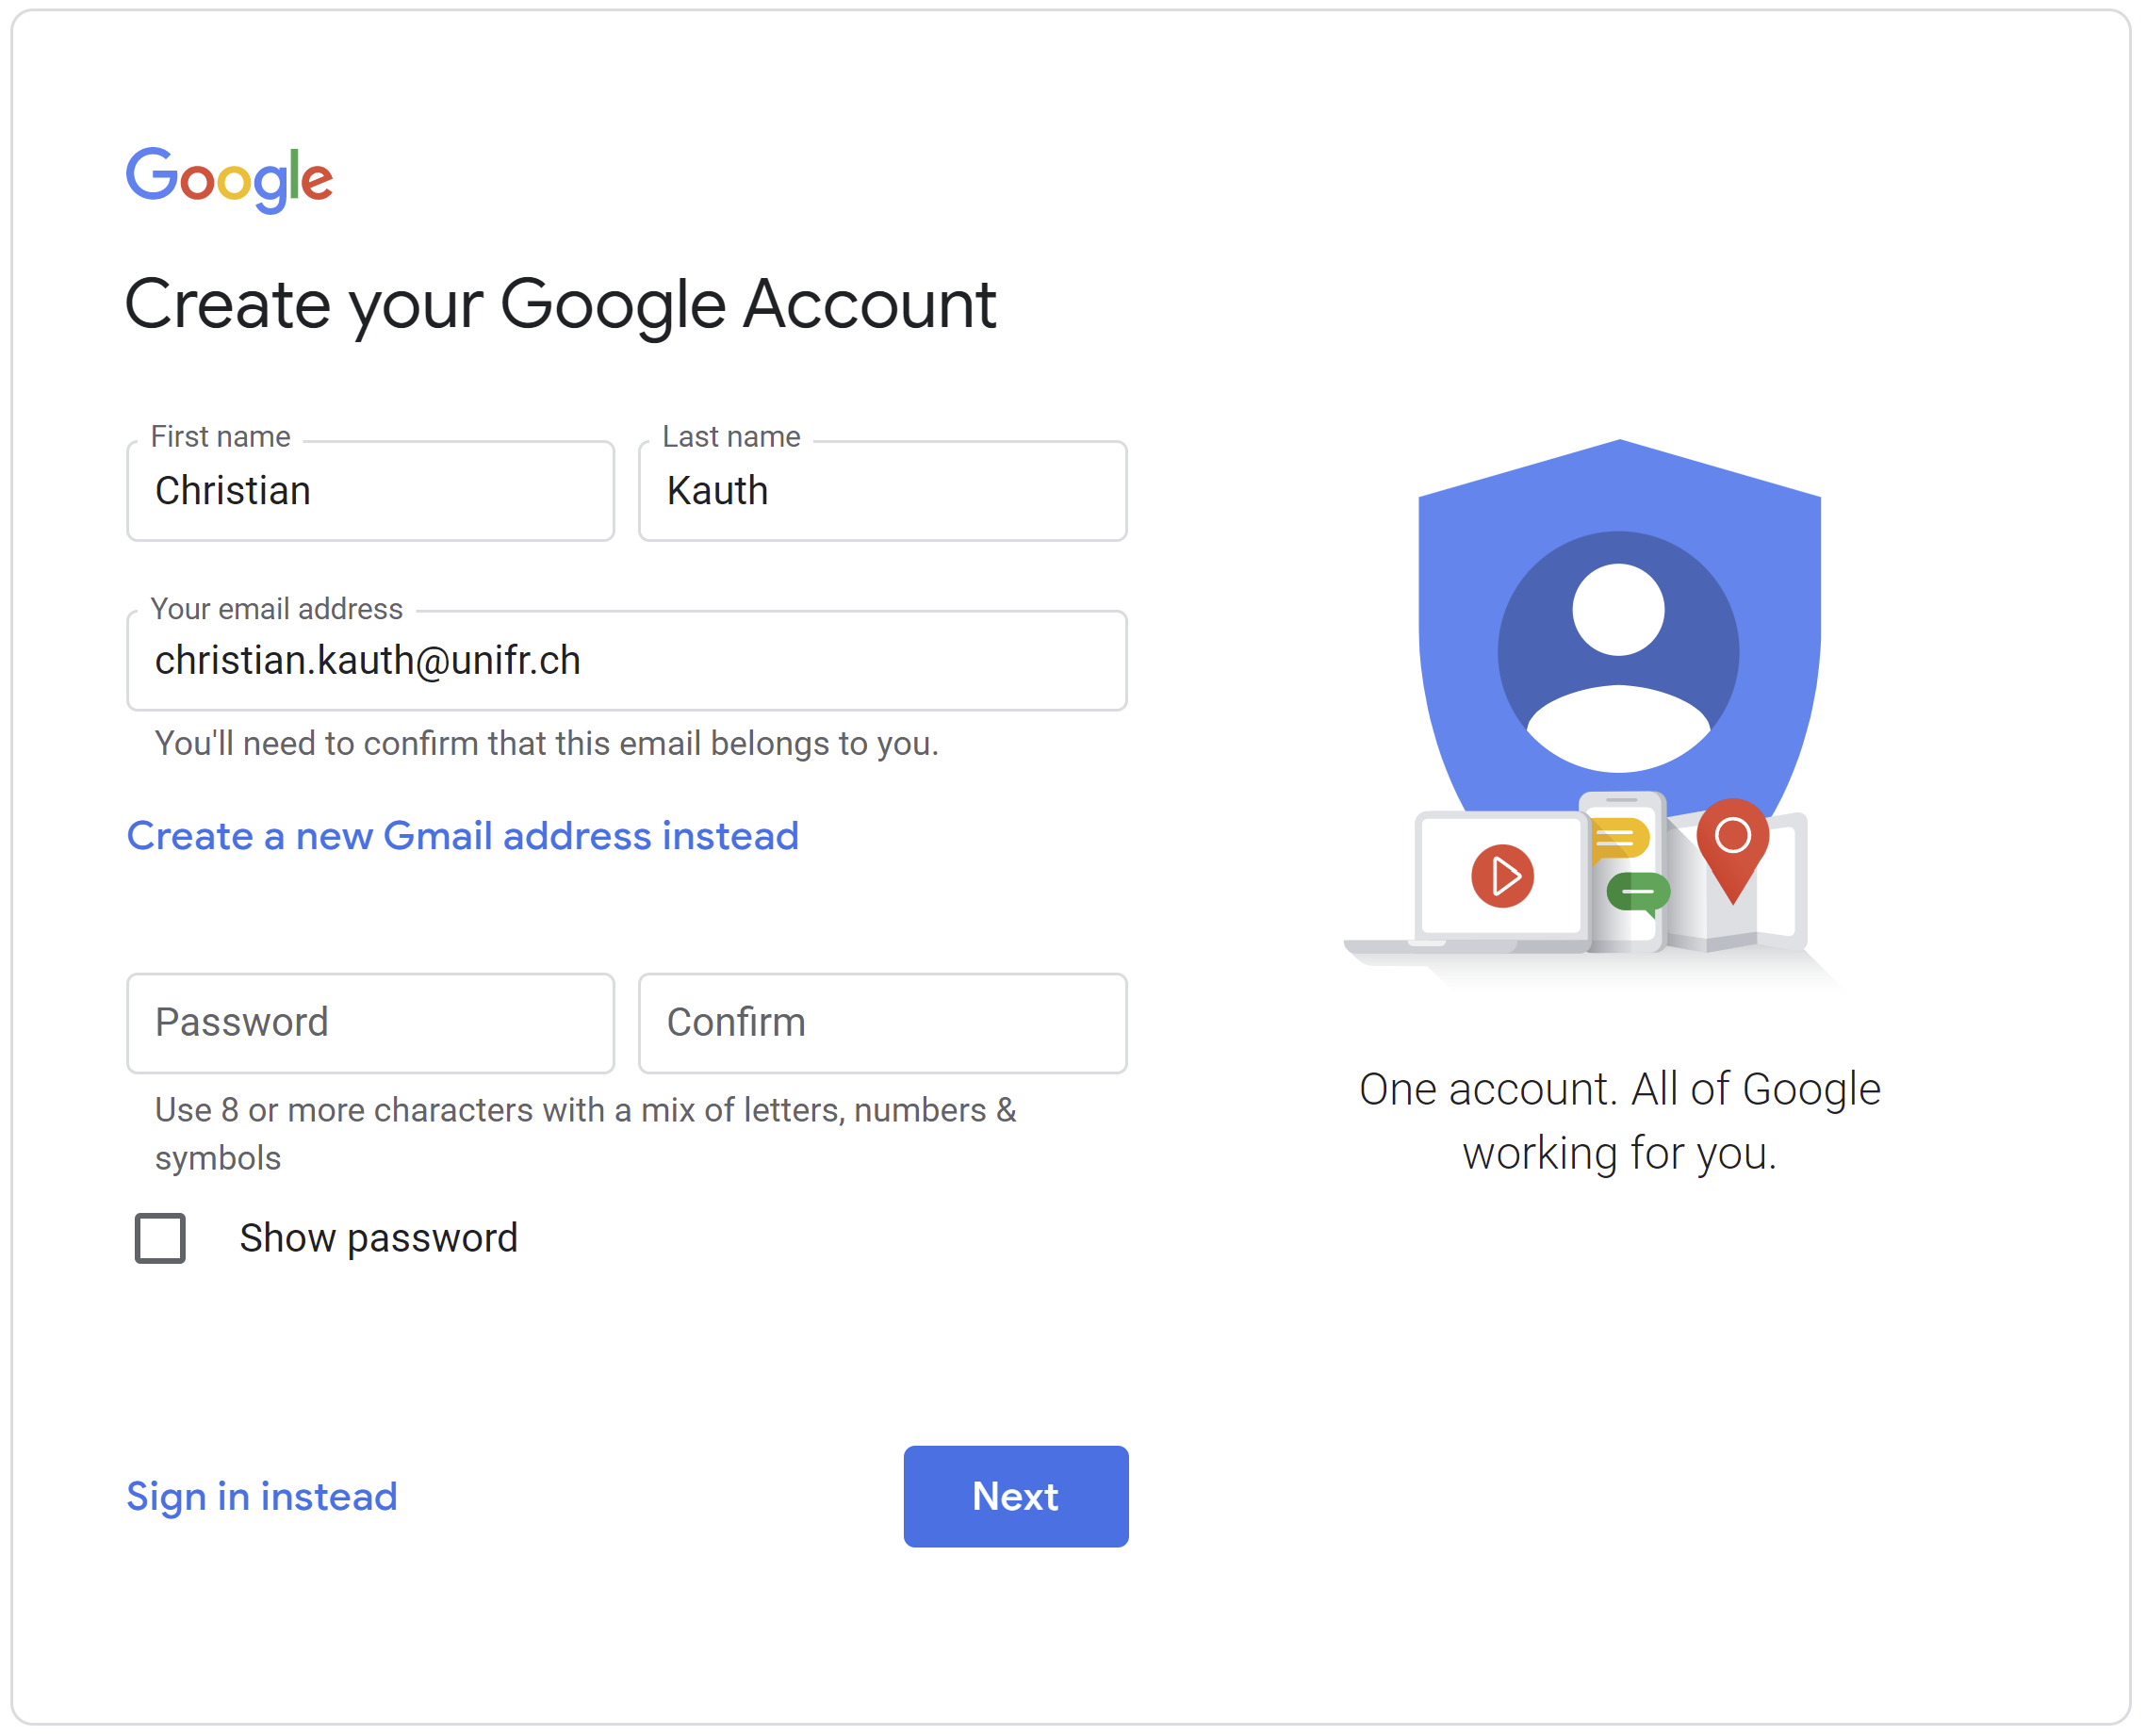

In [32]:
#@title Create Google Account
base64_data = "iVBORw0KGgoAAAANSUhEUgAACOUAAAcyCAYAAADclsNKAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAALEoAACxKAXd6dE0AAP+lSURBVHhe7N0HmB1l2QbgL72SQg01lIQAQgJIL6FKb1LVH0E6gohIV5pIB0URFOlFQGlShdAJECAU6RAIJbTQ03v79z2ZuNndc7bObnaT+76uvZhvNnvO7Jk5M8N+z3nfVrPKJAAAAAAAAAAAIDets/8CAAAAAAAAAAA5EcoBAAAAAAAAAICcCeUAAAAAAAAAAEDOhHIAAAAAAAAAACBnQjkAAAAAAAAAAJAzoRwAAAAAAAAAAMiZUA4AAAAAAAAAAORMKAcAAAAAAAAAAHLWalaZbLlJTJ8+PU2aNCVNnjIlTZ06rTCePn1GauLNAAAAAAAAAABgPtCqVavUtm2bsq+2qX37dqljhw6pU6cOhfG81CShnBkzZqRx4yekceMmpClTpmZrAQAAAAAAAACgcXTo0D4ttFCXtFDXLqlNmzbZ2qbTqKGcqIIzavTYNGbMuGwNAAAAAAAAAAA0re7dF0o9e3Rr0uo5jRbK+W7UmPTdd6OzUUWdOnUsfHVo3y61a9euUEIoSgnFFwAAAAAAAAAA1EbEXuJr+vQZadq0aWnK1Glp0qTJha9iFl64R1q4Z/ds1LhyD+VEe6qvvv62Spuqjh07pG4LdU1du3ZOrVu3ztYCAAAAAAAAAEC+Zs6cmcaPn5jGjhufJk+ekq2dLdpaLb7YIoX/NqZcQznjxk1IX371TTaaLcI4Uf6nS5fO2RoAAAAAAAAAAGgaEyZMTKNGj60Szlli8UXTQgt1yUb5yy2UM3rM2PTNN6Oy0WyLLrpw6tF9oWwEAAAAAAAAAADzxugx49I333yXjWZbdNGeqUf3btkoX7mEcioHctq3b1dIEzV2mR8AAAAAAAAAAKitKVOmFrpATZ06LVvTeMGcBodyKres6tSpY1qy12KpdevW2RoAAAAAAAAAAGgeZs6cmUZ+8XWaNGlytqZxWlk1KDkzJz00RwRyllpycYEcAAAAAAAAAACapci1RL4lci5zRP4lcjB5alB65quvv82WZresigo5rVq1ytYAAAAAAAAAAEDzE/mWyLlE3mWOuXMweah3KOe7UWMqJISijI8KOQAAAAAAAAAAtASRc4m8yxyRg4k8TF7qlaKZPn16+u670dkopUUXXTh16NA+GwEAAAAAAAAAQPMXeZfIvcwReZjIxeShXqGcUaPHZkspdezYIfXovlA2AgAAAAAAAACAliNyL5F/mWPuXExD1DmUM2PGjDRmzLhslFLPHt2yJQAAAAAAAAAAaHnmzr9ELibyMQ1V51DOuPETsqXZVXK6dOmcjQAAAAAAAAAAoOWJ/Mvc1XLmzsfUV91DOePKn7TbQl2zJQAAAAAAAAAAaLnmzsHMnY+przqFcqZPn56mTJmajVLq2lWVHAAAAAAAAAAAWr65czCRj4mcTEPUKZQzadKUbCmlTp06ptat61xoBwAAAAAAAAAAmp3IwUQeZo65czL1UadUzeQpFUM5AAAAAAAAAAAwv5g7DzN3TqY+6hTKmTp1WraUUof27bIlAAAAAAAAAABo+ebOw8ydk6mPOoVy5u6V1a6dUA4AAAAAAAAAAPOPufMwc+dk6qOOoZwZ2VJKbdu2yZYAAAAAAAAAAKDlmzsPM3dOpj7qFMqZNWtWtpRSq1atsiUAAAAAAAAAAGj55s7DzJ2TqY86hXLmJpQDAAAAAAAAAMD8JM88TL1DOQAAAAAAAAAAQHFCOQAAAAAAAAAAkDOhHAAAAAAAAAAAyJlQDgAAAAAAAAAA5EwoBwAAAAAAAAAAciaUAwAAAAAAAAAAORPKAQAAAAAAAACAnAnlAAAAAAAAAABAzoRyAAAAAAAAAAAgZ0I5AAAAAAAAAACQM6EcAAAAAAAAAADImVAOAAAAAAAAAADkTCgHAAAAAAAAAAByJpQDAAAAAAAAAAA5E8oBAAAAAAAAAICcCeUAAAAAAAAAAEDOhHIAAAAAAAAAACBnQjkAAAAAAAAAAJAzoRwAAAAAAAAAAMiZUA4AAAAAAAAAAORMKAcAAAAAAAAAAHImlAMAAAAAAAAAADkTygEAAAAAAAAAgJwJ5QAAAAAAAAAAQM6EcgAAAAAAAAAAIGdCOQAAAAAAAAAAkDOhHAAAAAAAAAAAyJlQDgAAAAAAAAAA5EwoBwAAAAAAAAAAciaUAwAAAAAAAAAAORPKAQAAAAAAAACAnAnlAAAAAAAAAABAzoRyAAAAAAAAAAAgZ0I5AAAAAAAAAACQM6EcAAAAAAAAAADImVAOAAAAAAAAAADkTCgHAAAAAAAAAAByJpQDAAAAAAAAAAA5E8oBAAAAAAAAAICcCeUAAAAAAAAAAEDOhHIAAAAAAAAAACBnQjkAAAAAAAAAAJAzoRwAAAAAAAAAAMiZUA4AAAAAAAAAAORMKAcAAAAAAAAAAHImlAMAAAAAAAAAADkTygEAAAAAAAAAgJwJ5QAAAAAAAAAAQM6EcgAAAAAAAAAAIGdCOQAAAAAAAAAAkDOhHAAAAAAAAAAAyJlQDgAAAAAAAAAA5EwoBwAAAAAAAAAAciaUAwAAAAAAAAAAORPKAQAAAAAAAACAnAnlAAAAAAAAAABAzoRyAAAAAAAAAAAgZ0I5AAAAAAAAAACQM6EcAAAAAAAAAADImVAOAAAAAAAAAADkTCgHAAAAAAAAAAByJpQDAAAAAAAAAAA5E8oBAAAAAAAAAICcCeUAAAAAAAAAAEDOhHIAAAAAAAAAACBnQjkAAAAAAAAAAJAzoRwAAAAAAAAAAMiZUA4AAAAAAAAAAORMKAcAAAAAAAAAAHImlAMAAAAAAAAAADkTygEAAAAAAAAAgJwJ5QAAAAAAAAAAQM6EcgAAAAAAAAAAIGdCOQAAAAAAAAAAkDOhHAAAAAAAAAAAyJlQDgAAAAAAAAAA5EwoBwAAAAAAAAAAciaUAwAAAAAAAAAAORPKAQAAAAAAAACAnAnlAAAAAAAAAABAzoRyAAAAAAAAAAAgZ0I5AAAAAAAAAACQM6EcAAAAAAAAAADImVAOAAAAAAAAAADkTCgHAAAAAAAAAAByJpQDAAAAAAAAAAA5E8oBAAAAAAAAAICcCeUAAAAAAAAAAEDOhHIAAAAAAAAAACBnQjkAAAAAAAAAAJAzoRwAAAAAAAAAAMiZUA4AAAAAAAAAAORMKAcAAAAAAAAAAHImlAMAAAAAAAAAADkTygEAAAAAAAAAgJwJ5QAAAAAAAAAAQM6EcgAAAAAAAAAAIGdCOQAAAAAAAAAAkDOhHAAAAAAAAAAAyJlQDgAAAAAAAAAA5EwoBwAAAAAAAAAAciaUAwAAAAAAAAAAORPKAQAAAAAAAACAnAnlAAAAAAAAAABAzoRyAAAAAAAAAAAgZ0I5AAAAAAAAAACQM6EcAAAAAAAAAADImVAOAAAAAAAAAADkTCgHAAAAAAAAAAByJpQDAAAAAAAAAAA5E8oBAAAAAAAAAICcCeUAAAAAAAAAAEDOhHIAAAAAAAAAACBnQjkAAAAAAAAAAJAzoRwAAAAAAAAAAMiZUA4AAAAAAAAAAORMKAcAAAAAAAAAAHImlAMAAAAAAAAAADkTygEAAAAAAAAAgJwJ5QAAAAAAAAAAQM6EcgAAAAAAAAAAIGdCOQAAAAAAAAAAkLNWs8pkyzUa/v6IbCmlPiv1zpagdr4eMzO9PWJa+mb0zPTOiOlp0uRZ6bMvZmTfna1Tx1Zp6V5tUqcOKfXu1TYtt0TbtGrvNqlLR/kxAAAAAAAAAKDx5ZWPEcqhUX30xYz09GtT0ivDpqXvRs/M1tZdBHU2HtA+fb9f+7RYdwEdAAAAAAAAAKBxCOXQrA1+bUq658nJDQrilLJGv7Zp2/U6ptWWb5etgdkeGDYo3fbyP7JRVUdvfnwasGT/bAQAAAAAAAAAVeWVj1FyhFxFGOe4v4xJ1909sVECOeH1YdPTRTeOT+fcOK7QEgvmNmvWzJJfAAAAAAAAANBUhHLIRbSpipBMY4ZxKhv+0fR0xhVj052DJ2VrAAAAAAAAAACaB6EcGuzBoZPTmVeOLYRkmtqkybPSfU9OLgSCJkxWCQUAAAAAAAAAaB6Ecqi3CMFcfOu4dOugeV+pJgJBp185rlCxBwAAAAAAAABgXhPKoV4ikHPejePT68PqXx2nT++2//tar3/7/y337FG/wzLaZl1447j09RgVcwAAAAAAAACAeavVrDLZco2Gvz8iW0qpz0q9syUWNHMCOZ/VsSrNUku0SRsPaJ9W7d0uLd+rTba2tBeHTUtvfzQtPfvq1DR5Su0O0wj3HL5rl2zEguaBYYPSrS/dkI2q+tUWJ6YBS/bPRgAAAAAAAABQVV75GJVyqJP6BHIiKHP+L7unsw7tlrZfv2OtAjlhnX7t0k+37Zz+ekKPtP8unWusoCOQAwAAAAAAAAA0F0I51MkV90yodSAnWlFFGCeCMot1b9ihttmADukPR3UvhHM6dmiVrS0nkAMAAAAAAAAANCdCOdTaHYMnpteHTc9G1dtrm07pN/st1OAwTmURzrnwl90KgZ85BHIAAAAAAAAAgOZGKIdaeeujaen+J6dko9Kiis1ph8xuU9VYunRsXQj8RBhHIAcAAAAAAAAAaI6EcqiVWx6elC2VFoGcE/ZbKC3fq022pnFFGEcgBwAAAAAAAABojoRyqFG0rfrsixnZqLimDuQAAAAAAAAAADRnQjlUa8Lkmemx56dmo9L22baTQA4AAAAAAAAAQEYoh2o9OHRymjR5VjYqbo1+bdNmAzpkIwAAAAAAAAAAhHKo1rOvTsuWiou2Vftu2yUbAQAAAAAAAAAQhHIo6cVh09J3o2dmo+K22qB9Wqy7wwgAAAAAAAAAYG7SFJT04jtTs6XiokrOdut1zEYAAAAAAAAAAMzRalaZbLlGw98fkS2l1Gel3tkS86sjLxydJk0ufXis1799OnzXBat11eQvR6axb/w3Tf1qZJrw5ivZ2nIdl++T2i++ZOq5/qap4xJLZmubxqzpY9LU0c+m6RPeTLOmjSv777vZd1Jq22Xl1KrdQqlNh2VSh0W3S63ads++0zS+HjMzvTRsappYdjyN+GJ6mjRl9vrllmiTOndsldZeuX1avleb2Ssb4IFhg9KtL92Qjar61RYnpgFL9s9GdRf7f9TzT6UZE8ZV2f9dvrdmYd93W32tJt/3AAAAAAAAAOQnr3yMUA5FffTFjHTmlWOzUXFH7N01rdOvXTaaf00fPy59ce+tadzQp9OUT9/P1taswzIrpYXW2yT12nnv1LbrQtna/E3+4l9p8pd3p+mjyt+fNWnbs3dqv8gWqVOvvRstoDNh8sz01GtT0zOvTk2flR1PNVm4R+u00YD2adv1OqQuHWcX8Yowz9ejS//sar0rHn+NEcqZs//HPPlgmvbtl9na6sW+X2SnvdLiW+2QrQEAAAAAAACgpRDKoVE98PzkdNtDk7JRcdec2jNbmj/NCWN898Adaeak8dnaumvdqWtaePs9cg/nRBhn4kdXp5mTJ2Rr6q51xy6p8/IHpY699snW5GPwa1PSvwZNqrbSUikRzvnRNp0Lga87Bk9M9z+ZldUpovIxmHco59Nbrm7Q/o9wzlIHHpW6r7F2tgYAAAAAAACA5i6vfMzschRQyTejZ2ZLxfXp3TZbmj9N+OC99N6pv0zf3Hl9gwI5IX4+HmfYcQcWHrehZkz+JI16adc0/p1LGhTICfHz8TjxeNPGv5Gtrb+ojnPqlWPTdXdPrFcgJ3xXduz99dbx6clXS4dxGlu0qXr7mAMavP+jstKHZ/6qEO4BAAAAAAAAYMEilENRn3xZfbuhfsu3yZbmP98+Nzi9f8bRdWpVVRvR+ige96tH7s/W1N3U0c+k0S/um2aM+yZbk494vLGvHJmmfPNAtqbuouXZCX8ZW6tWVbVx/T0T07OvTstGTSeCU+8ef1Cu+z/CPR/8+exsBAAAAAAAAMCCQPsqijrnhnFp+Ijp2aiqvbbplLZfv2M2ariani8P0RbpoqO6Z6PiIjDz+d/Pz0aNZ6nDTkyLb71jNqqdSV/8M0145y/ZqPF0WeWo1KnXj7JR7bz10bR02W0T6l0dp77ybl9VqJB04kHZKH/dNtk2rXj0b7MRAAAAAAAAAM2R9lU0qpoCMr2XaHmVcqItUnUikNEUgZwQzzPm9ZezUc2itdTE4X/LRo0rgj91aWX19ZiZ8ySQk7fp48cVKhk1prFPD0oj7/5XNgIAAAAAAABgfqZSDkUd+PtR2VJxx/20a1pt+XbZqOGaolJOOO2Qbmn5XlUDRZO/HFloWTRz0vhsTfW6rLlR6r7+pqnDEktma1KaUvYYY55/Kk14ZUi2pnqtO3VNK194deo412MUM2v6mPTdc7uU/bd2r0+broum9osOTG27rpZate1W9nNj0/Txb6Wp3wxOM8bXru1Vq7ZtU491/pHadFw2W1PchMkz03k3jq91y6qllmiT1lqlbeq9RLvUuUNKE6ekNOLLaem/70xPn9fQMq2YPCvlvH3MAbVqWdW6Y5fU9fsbp+4blL3GXbqmDosvmaZ8NbKw/7+9/7ayx/gg+5el9T3/6tRlxb7ZCAAAAAAAAIDmJK98jFAORc2voZxS2z38nJPS+P/WHKbptvE2abmDj05tuy6UrakqKq58fNWf09hnHsrWlNap34DU76zqW1KNfeeYNPWLodmotHaLrpa69jmt2iDNjMmfpPHDz0zTvnkrW1NaPF731a/MRsXdMXhiuv/JKdmotDX6tU37btslLda9dHGuaIF180OT6hTOySuUU9u2ZRHGWrZs/1cXpIoKSCMu+G2aOXlCtqaq2ux3AAAAAAAAAOYN7atoVB07tMqWiosKJ/OLCFHUFMiJ6ijLHntWWvFXp1QbyAnx/fh38e/j56ozadir1baxijZStQnkdFnlqEKApqbKNvH9+Hfx72sSwZ2po5/JRlVF26raBHL236VzOmbvhaoN5IQIS511aLe0Xv/22Zqm8/Xt12VLpS112Imp72/Pq7GyUfc11k6r/e3Wavd97PcIAgEAAAAAAAAw/xLKoahlirR4mlu0HJpffPGva7Ol0lb63SVpkQ0GZqPaiX8fP1eT6p5/wvvnZEuldVvzgtSp14+yUe3Ev4+fq8nEEZdlS1Xd8cSkbKm0CORsNqBDNqqdw3ftUqis01QiHDPt2y+zUXERyFl86x2zUc0imNVr/19ko+JqEwQCAAAAAAAAoOUSyqFevh5V665nzdrkL0cWqpZUZ4l9j0xdVuybjeomfi5+vjrx/BM+eC8blYtWU9NHlZfEKqbT8run9j02zkZ1Ez/Xuc/+2ai4eP7YjsomTJ6Zhr42NRsVt+NmHeocyJnj0F26pJ49mub0NOrxB7Kl4npus3udAjlxTI246s/pixtKB5pCBIGqq5IEAAAAAAAAQMsmlENR/ZavvlLOZ1/NyJbysfGA9oUQR0O/+vSuW4WVUc8NzpaKa7fw4mnJXffJRvUTP99p5f7ZqLixRcIZU76pPiwS7ZG6LH9sNqqfzsscWmOLrWLb8eKw6islRaBmj4Gds1HddenYOu0ysGM2ajzTx49Lk959LRtVFa/N0j8+KBtV79uyY2n4OSeld36xTxo16I40c9L47Dulffvof7IlAAAAAAAAAOY3QjkUtWj3GkI5X8woVEvJS1RUiRBHQ7861ZDj6F2pLdfoJx7MlopbbK8DsqWGWXTnvbOl4optx7TRL2RLxXVa/sBsqWFqepwpX96fLZV7eVj1VXLyCNTEMdHY1XLGvPHfbKm47gO3LbSiKiVCPSPvuTW9efhe6ZM/nJLG/3dI9p3amfT2K9kSAAAAAAAAAPMboRyKWm35dtlSaTVVS5kXPvuy+qBQVGCZ25RP38+WiqtL26LqLLLBwGypuGLbMe2bt7Kl4jouun221DA1Pc6Mcd9kS+WGj6i+UtI6/Wo+fmpjzZXzeZxSJn5YtW3Y3LqusXa2VFG0G/vgz2enNw7YMX1546WFVlR10W3jbdIKp/0pfe/vt2drAAAAAAAAAJjfCOVQ1GLdW9dYpeSZ16qvltLUonLPd6NLh3KWWqJilZzJX47MloqrqeVUXdX0eHNvz6zpY7Kl4tr27J1ate2ejRomHicerzrTxr+RLc02afKsbKmqeJ0rh5/qa9VahMMaYvIH1YdyKoepvnr0P+ntYw5I7514UBr79KBsbe1EK7RFdt8/rXLpv9KKvzoldS8R+AEAAAAAAABg/iCUQ0k1VSkZ/tH09PWY/FpYNVRNlXuWqRTKmfJV9aGczquvlS3lo6bHm3t7KodgKmvbpW+2lI923b+fLRU3d0jorY/q9jo3xKLdG/cUNXPi+GyptAhLjbjqz+m1/XZIn19+Xo3VlSqLMNZSh51YqIqz7I8PSh2XWDL7DgAAAAAAAADzM6EcStpug47ZUml3PDEpW5r3Xh5WfeWeVZdvmy21fK3adsuWmp/FerbKlhpu+V75BXzqY9gpR6V3frFPGjXojjRzUs0Bnjlad+ySem6ze6EqTr+zL82tDRoAAAAAAAAALYdQDiVFC6vKLZ8qG/ra1BorpzSFaF01fMSMbFTcao3cCml+Nmv62GxpwTJp2KvZUu10WGbFQlWc1f52a+p9yK9UxQEAAAAAAABYgAnlUK0frN8hWyrtlocnFUIx89KDQyenSZNnZaOqIlwUIaP5RVOHZOpSmWdijsWTmlN7tOp023ibtMJpf0qrXnxdoSpO264LZd8BAAAAAAAAYEEllEO1NhvQIfXsUf1h8tkXM9I/Hpp3bawiuPHY89W3rioWLuqyQt9sqbiJb/w3W8pHTY/XYfHyqiptOi6XLRU3fcJ72VI+po15KVsqrlXb7tlStKeqvnrSJ19WX7GoLr4eld9jFdO6c9dsqe7aLbx4WmT3/dPq196fVvzVKan7Gmtn3wEAAAAAAAAAoRxq4aCdO2dLpT3/6tT05KtTslHTiQo9l9w6vtoqOR07tErr9KvauqqmaiaT3n0tW8pHTY83d6ujNh2XzZaKmz5qRLaUjxnjPsuWimvXdfVsaXZbs+oMHzE9W2q4tz9u3NZoHVesPphVTJc1N0rLHntW+t7fb0/L/vggVXEAAAAAAAAAKEoohxqttny7tEa/ttmotOvvmdjkwZyo0BOVeqqz1QbtU5eOxQ/1Tiv3z5aK++qR+7OlhqnpcToss2K2VK5N10WzpeKmfPNAttQw8TizppcO0hTbjmgHVp0Xh+UTpnllWH4Bn2I611AtaY7WHbukntvsnla59F+p72/PS4tsMDD7DgAAAAAAAAAUJ5RDrRy6S5dCxZmaRDDnzsFN08rq7/dMKFToqU5s83brdcxGVXVbb9Nsqbivb78uW2qYmh6nx+bbZ0vlOvTaMVsqbtJnN2ZLDVPT47RftGoAZeMB7bOl4h4aOjlbqr+3PppWY+CqoWoTrokwTv8bH0i9D/lVhWpGAAAAAAAAAFAdoRxqJSrN/GLvLtmoevc9OTmdc+O49PWYmdmafMXjnnrl2BoDOWHnzTqWrJITetYQypj27Zdp5N3/ykb1Ez8fj1OdYtvRrsdG2VJx0cJq4qdXZKP6mfTFP2tshdV+0W2zpXLrrFJ9KGf4R9MbXDXploebJtwV7aiqM/GtV7Ol+ht2ylHp01uuzkYAAAAAAAAALAiEcqi1aGO142YdslH1IpRxxhVj04M5VEyZW1ThicetTQWVPr3bpu3XL10lJ0Tlk5paWH35j8vShA/ey0Z1M+b1lws/X514/mIVWNp1XT217dk7GxU36aOb0rTxb2Sjuomfmzj8b9mouGjbFNtR2WLdWxde3+rc+tCk9FE9K93cMXhio1fJmWPhrXbIloqb8un76ZMGBGo++PPZadKwV9M3d16f3j7mgHofSwAAAAAAAAC0LEI51MkeAzun9fpXXyVljkmTZ6VbB01Kx/1lTCFMU9/KORMmzyyEe+JxogpPPG5NevZonY6uZWWfXj86MFsq7f0zjk5fPXJ/Nqqd+PcjLjwlG5VW3fN37n1ktlTcrOnT09hXjqxzMCf+ffxc/Hx1uq5yerZU1W4Dqw88xX668MZxdQ7mxLFy/5MNq7JTF9HCqqZg1rd3Xl+vSjcRyBn79KBsNDvg896JB6maAwAAAAAAALAAaHNGmWy5Rt+NGpMtpbTwwj2yJRY00bpo5OiZ6bMvaxe2iHDGuyOmp0een5Le/Hh6IZwTsZrOHVul9m1bzf5Hc4nvj/hyenrqtanp34Mnp5v+Mym9+f70WoVxQscOrdKvf7JQWrxHm2xN9aJKzbj3hqVpX3ySralq1vSpadxLz6SJIz9PnVbom9p2XSj7TlWTvxyZPr76kvTNv68v/Fx1onXSUnv+NBtV1abjcmnqmEfTzMnl770qZs5MUz6/L81qNTq16/q91Kp16bDMrOlj0sRPLkvj37qw8HPViSo9XZY/JhtVtVjZ61vTcRCZnydfnpJmlO3m5ZZoU3R/zxH7/Yp7xqenX6q5Ldkcu27WKVuabfi376c3R5ZuN7XBCpukXgstkY3KtVu8Vxr95IPZqLiJb7+axg8fljqv/L1q93+ICkkfnvebNPGNF7I1FcVjjXp2cOGx2vdcJFsLAAAAAAAAQHOQVz6m1awy2XKNhr8/IltKqc9K1bfVYf53+d0T0tDXah+gaAoRyDlhv4XS8r1qF8iZI4I07x53YJo5eUK2pnpd19oodVt/YOowV9upiR+8lya88XIa/98h2ZrqRWuolS+6pmjrqrnNmPxJGv3ivjVWtQmt2rZN7Rf9ftnXNmXL3VKbjssWfn7W9LFp6jcPlX29VOvH6bbmZUVbV80tqhgdf8nYNHlKzaeRTh1bpf792qXv92ufOnecHer5evSM9M2Ymemld6am14fVvF2VXXNqz2xptgeGDUq3vnRDNqrqV1ucmAYsWbwqzgd/OiuNfeahbFS9ufd/h8V6pSlff1FYP+71l9O4oU8XKuLUxhL7HpmW3HWfbAQAAAAAAABAc5BXPkYohwZ58tUp6fp7JmajeStaVh21V9c6B3LmmPDBe4XWQk2l7/lXpy4r9s1G1Zs6+pk09pUTslHjW2j1U1KHRbfPRtWL9lRnXjk2GzWtPEM508ePS++delSa8ukH2ZrG1W3jbdKKv6q5vRkAAAAAAAAATSuvfEzr7L9QL5sN6JBOO6RbWmqJ+gVh8tKnd9t05iF1r5AztwjILHXYidmoccXz1DaQE9r32Dh1WeWobNS4OvfZv9aBnBCv+f67dM5GLVe0pFrhpHMLFYwaW6eV+wvkAAAAAAAAAMznhHJosAhlnLxf17TjZh2yNU0n2lXF8/5mv4VSl44NP5wX33rHtOyxZzVaMCMeNx4/nqeuOvX6UaMHc+LxOy9zaDaqvQhnRTAn9kee8n68mkQrsWgp1mGZFbM1+YsKOf3OvjQbAQAAAAAAADC/EsohFxGI2WNg53T+L7un9fq3z9Y2rnie3x3WrfC8eVpkg4Fppd9dknswIx4vHjcev74imNN9nb+nVm3bZmvyEY8XjxuPX18RzDlhv4VyC9LE/t1qg6Y5luYWwZy+v/9L6rLmRtma/Cyx75Eq5AAAAAAAAAAsINqcUSZbrtF3o8ZkSyktvHCPbAnKdenYKq2zSvu00Zod0thJs9K3o2em6TOyb+Ykwhq/3KdrIQQSz9cY2vdcJC223W5p2oyZacqHw9Os6dOy79RdVMdZeJefpN6HH18IfDRUm/aLp05L7V72wJPSjPHvpTRzZvad+um0/O6p22oXpjYdl8vW1F+Prq3T5t9vn1q3S+m9EfXb8RHq+b8dO6c9N+uU3h4xreTj9OzROm27fsdsNNvwb99Pb458NRtVtcEKm6ReCy2RjUpr3b5DWmTg1qndciulScPeSDMnTci+Uz/RrmqFE85JC29Y/0AWAAAAAAAAAE0jr3xMq1llsuUaDX9/RLaUUp+VemdLUL0Xh01LL74zNb338fQ0anTdAyQR0ui7fJu0dr/2aZ1+7XJpU1UX08ePSyPvvTWNH/pUmvLpB9namkVlnK7rbZqW3Hnv1LbrQtnafM2aPiaNG35Gmj76zTRzcu2DIxEUatvje6nL8r9ObToum63N19djZqY7npiUXivb/5On1O40E4GrPTbvlBbrPnsf3zF4Yrr/ySmF5cr69G5baFs2t2c/fj5bKq5zu05pwJL9s1HtffXI/enb+2+r0/4P0apqka12SN3XWDtbAwAAAAAAAEBzl1c+RiiHJhVBja9HzUhvfzy78sywj6pWQem3fJvCf1ddrl1arGeb/wU0moPJX45Mo54bnKZ+NTJN/mh4trZcx+X7pPaLL5l6bjAwl6o4dTFt/Btp6jeD0rQxLxXGMyd9UwjqRACndadFC+vadf9+ar/otqld19UL46YSway3P5qWPvly9v4ePmJ6odLNImX7tlPHVDJwdfndE9LQ16Zmo4qKhXIaWwS0vivb/+Pf+G+a9vUXhXVTPn6/8N8Oy61U+G8cA13XWDt1X32tRgtjAQAAAAAAANB4hHKA+d45N4wrBHiKWaNf23TM3kIvAAAAAAAAAOQrr3xM8ylBAlDJd2NKtztbrtfsikoAAAAAAAAA0BwJ5QC5euuj2a3JGipanX03unQoZ9HuQjkAAAAAAAAANF9COUCDTZg8Mw1+bUo67i9j0kU3jk9Pvjol+079vfjO1GypuNWWb5ctAQAAAAAAAEDzI5QD1NtHX8xIf79nQjrhL2PTdXdP/F9lm3sHTy4EdRri0aGlgz09e7ROi3V3+gIAAAAAAACg+TKrDdTL5XdPSGdeOTY9/+rUNGnyrGztbBHOueKeCdmo7m4cVB7wKabvcm2zJQAAAAAAAABonoRygHpZdfnqgzGvD5teqKJTV9H66vFqquSE7dbvmC0BAAAAAAAAQPMklAPUy2YDOhTaSFUnquiceuXYQpurmkS7qwjxXH/PxGxNcX16t03L92qTjQAAAAAAAACgeWo1q0y2XKPh74/IllLqs1LvbAlYUL310bR00Y3js1H1+izfNm0yoH1atHvr1HuJ2aGaEV/OSN+MmZne/mh6em3YtCptsIo57qdd02rLt8tGAAAAAAAAAJCvvPIxQjlAg9wxeGK6/8nq203lZYv1OqSfbts5GwEAAAAAAABA/vLKx2hfBTTIHgM7p/X6t89GjSfaVgnkAAAAAAAAANBSCOUADXb4rl0aNZiz1BJt0tF7d8lGAAAAAAAAAND8CeUAuYhgzo6bdchG+Ymwz8n7dU1dOjpdAQAAAAAAANBymOUGchOtrE47pFuhsk1D9ezROu2/S+dC2EcgBwAAAAAAAICWptWsMtlyjYa/PyJbSqnPSr2zJYCq3vpoWrpr8OQ0fMT0bE3tRBhnl4Ed02YD8q+6AwAAAAAAAAA1ySsfI5QDNKqvx8wsBHTe/mh6+q5seeLkWenzL2cUvtend9vCfxfu3jqtunzbtNry7dJiZcsAAAAAAAAAMK8I5QAAAAAAAAAAQM7yyscoSQEAAAAAAAAAADkTygEAAAAAAAAAgJwJ5QAAAAAAAAAAQM6EcgAAAAAAAAAAIGdCOQAAAAAAAAAAkDOhHAAAAAAAAAAAyJlQDgAAAAAAAAAA5EwoBwAAAAAAAAAAciaUAwAAAAAAAAAAORPKAQAAAAAAAACAnAnlAAAAAAAAAABAzoRyAAAAAAAAAAAgZ0I5AAAAAAAAAACQM6EcAAAAAAAAAADImVAOAAAAAAAAAADkTCgHAAAAAAAAAAByJpQDAAAAAAAAAAA5E8oBAAAAAAAAAICcCeUAAAAAAAAAAEDOhHIAAAAAAAAAACBnQjkAAAAAAAAAAJAzoRwAAAAAAAAAAMiZUA4AAAAAAAAAAORMKAcAAAAAAAAAAHImlAMAAAAAAAAAADkTygEAAAAAAAAAgJwJ5QAAAAAAAAAAQM6EcgAAAAAAAAAAIGdCOQAAAAAAAAAAkDOhHAAAAAAAAAAAyJlQDgAAAAAAAAAA5EwoBwAAAAAAAAAAciaUAwAAAAAAAAAAORPKAQAAAAAAAACAnAnlAAAAAAAAAABAzoRyAAAAAAAAAAAgZ0I5AAAAAAAAAACQM6EcAAAAAAAAAADImVAOAAAAAAAAAADkTCgHAAAAAAAAAAByJpQDAAAAAAAAAAA5E8oBAAAAAAAAAICcCeUAAAAAAAAAAEDOhHIAAAAAAAAAACBnQjkAAAAAAAAAAJAzoRwAAAAAAAAAAMiZUA4AAAAAAAAAAORMKAcAAAAAAAAAAHImlAMAAAAAAAAAADkTygEAAAAAAAAAgJwJ5QAAAAAAAAAAQM6EcgAAAAAAAAAAIGdCOQAAAAAAAAAAkDOhHAAAAAAAAAAAyJlQDgAAAAAAAAAA5EwoBwAAAAAAAAAAciaUAwAAAAAAAAAAORPKAQAAAAAAAACAnAnlAAAAAAAAAABAzoRyAAAAAAAAAAAgZ0I5AAAAAAAAAACQM6EcAAAAAAAAAADImVAOAAAAAAAAAADkTCgHAAAAAAAAAAByJpTDPDFhwoQ0atSoCl+TJk3KvgsAVRW7dkybNi37LgAAAAAAADQvrWaVyZZrNPz9EdlSSn1W6p0tQWkzZ85MX331VRoy5Nn0TNnXq6++mt5//4Psu1W1bds2rbTSSmmDDdZPAwdumtZea63Uo0f37LsALAjqe+1Yd53vp4022jCtvfbaafHFF0utWrXK/gUAAAAAAADUXl75GKEcGsXIkSPTXXffk2688abCckOsu+466Uf77J2222671Llzp2wtAPObr7/+Ov3733enf/7r1vThhx9ma+tnhRVWKFw7fvjDXdNiiy2WrYX8nH/Bhenyy6/IRuXOP//ctPdee2Yj6mLGjBnpvPMuSFddfU22pqJjjz0mHXnEzwXuAAAAAABodHnlY7SvIjeR73r33XfTEUf8Ig3cbMt0wQUXNTiQE1544cV07HEnpI023jRd9te/pYkTtbkCmF/EteOjjz4qXDs22nhgOve88xscyAnxGPFY8Zjx2HF9qkMOGZgHvv76mzTk2WezUVXPDnkujRkzNhsBAAAAAEDzJ5RDLr755pt0xhlnph132jU98OCgNH369Ow7+RkzZky66KI/ps232Co99NDDhfYmALRcc64dP9hm+0a7dsRjxmPH9SmeK54TaJ5eeOGF9NZbb2ejqoaWfT/a2QEAAAAAQEshlEODRDDm7nvuTTvsuEu64cZ/NMqEamXR3uSww49Ix59wUho1anS2FoCWIq4dEa5symtHPEc8VzxnXLcEO6F5mTRpUnr00ceyUXHxPn766WcKba4AAAAAAKAlaDWrDr0c8uqZxfxh/Pjx6cKL/phuuOHGbE3trLTSimm5ZZdL3/veaql1m9m5sJkzZqY333wrffzJx+n99z8orKuNAQP6pz/+4aK04oorZGsAaM4mT56c/vKXy9IVV15VpzBOXDv69umTVu63crYmpalTp6ZXX30tffrpp+mTTz7N1tasbdu26dBDDk5HHXVk6tixY7YW6ub8Cy5Ml19+RTYqd/7556a999ozG1Fb77zzTvrZAQelL7/8KltT3AorrJCuvfaq1Hu55bI1AAAAAACQv7zyMUI51MvIkSPTiSf9Jj311NPZmtJi8mSvvfZIO+ywfVpm6aVTmzZtsu8UN23atPT+++8XKhnccsu/Cm2rqhOP/8c/XJjWXHNAtob5wa233Z5OPPHkbFTOZCe0XN9++206+TenpIcffiRbU9qSSy6Z9tl7r7Tttj9IK620UmrXrl32neKiysawYe8WHvu22+8oVFWrSTz+aaedkjp37pytgdoTysnXtdden878/VnZqHqX/PnitPPOO2UjoKkNH/5+IUT32WefZWtm23WXndO5556dOnXqlK0BAAAAgJYrr3yM9lXUWQRyjvn1cTUGcrbcYvN09113pEcefjD9/PDDCp9orimQE2LidZVVVkknnnB8eu7ZpwuTW4sttlj23ao+/PDD9Otjj0/vvvdetgaA5uarr75OR/7ilzUGcjbacMN08003pqcGP56OPvqowvWgpkBOiAnACGcef/yx6emnnkhXXfn3GsOa/7r1tnTvffdnI2BeGT16THrkkUezUc3+858H0sSJE7MRAAAAAAA0X0I51ElMqkYg5/nnh2ZrqoqWUnfecVu68sq/p/79+6fWret/mEVbkfi0+X/uvyf93//9OFtb1eeff57eevOtbARAcxLXjuOOP6Haa0fv3r3TtddclW688bq04YYb1CrEWUr79u3TVlttmf71z5vTBRecVzLY+YtfHJF+uNuu2QiYV4YNG5aGvvBCNiq3ySYbF84Hlb3w4kvpww8/ykYAAAAAANB8CeVQa/GJ5GjVUGpStW3btunwww9NN9/0j7TWWms2KIxT2aKLLpp+d8bp6eyzfp86dOiQrZ2te/fu6cILzku77rpLtgaA5mLOtaNUdbU5147/3H9v2nzzzXK9dkQ4Z68990h33H5roQLP3A499OB05BE/L/wbYN6ZMWNGoUrO9OnTszXlfvLjH6Xtt98uG5WLVniPP/FEqkMXXgAAAAAAmCeEcqiVmPS4/oYb0513/jtbU1EhGHPh+en4445NnTt3ytbmK6om/PjH+6S/XPKnwvOF+O/vzzwj7bTTjqlVq1aFdQA0D3HtuO222+fptSMsu+wy6dJLL0k777xTYRyBnGN+dXShGhswb33++cj0xJNPZqNya6yxRlp77bXThhtskJZeeulsbblnhzyXxowZm40AAAAAAKB5EsqhVl555dX0979fmY0q+l+lml12zrXCQTERvNl6660KzxcTNPFfgRyA5mno0BfSxX+6JBtV1JTXjtCzZ49CxbXzzjsnHf3LowRyoJl45ZVX0vDh72ejcuuvt25adNFF0nLLLZs23qhipasQ7a5effXVbAQAAAAAAM2TUA41GjduXLr871ekMWPGZGvKRduR3/725EJQpqmCMXOCOffde3eTPi8AtTd69Jh02V//1myuHSGCOfvsvVfq3LlztgaYlyZNmpQeffSxbFQuzhFxfogqidFiLlrbVRbtrh5/4slC+ysAAAAAAGiuhHKo0RNPPJkeeujhbFTREUccnnb/4W5NHoyJ5+vRo7tADkAz9dDDD6ennno6G1U0r64dQPMyYsSI9Nzzz2ejcuutu27q169fNkpprbXWSquttmo2Kjd48FPp088+y0YAAAAAAND8COVQra+//jr946abs1FF66+/Xvq/n/yk8CnmBcG0adPSqFGjCl9jx45Ns2bNyr7TcPEp76gqMefxY3nmzJnZd+et+BT7nO1qbtvWFGI/x/6e+zWIY4HGVew9oRpC/U2YMOF/r2W8pxvbl19+lf7xj+LXjk033SQd8LOfLTDXjmLm3h/xFePmqiVsa+XzRVMc4/NCc75XqK9HH3u8cL6obMONNkjdu3fLRiktttiiaaMNq7aw+vDDD9Pzzw/NRvNO7Ie59018NZd7hea8bcXusebX929Tmfv/V7yeAAAAANA8tJpVh2TB8PdHZEsp9Vmpd7bE/Ozee+9Lvzz6mGxUrkuXLumvl/0lDRy4abZm/hShpH//++7077vuTu+88062drbu3bunTTbZOP3yqCPTyiuvnK2tncmTJ6cXX3yp8Po++9xz6ZNPPs2+U9Gyyy6TNtxgg7Tzzjultddeq9FbrsTEzWeffV6ocDFo0EPptddeT1OmTMm+W1Fs27rrrpu2+cHWaf311y9ULsrTrbfdnk488eRsVO78889Ne++1ZzbKX7wGw4cPTw88MKjQUuPtsv0eLTIqi/0/YED/tNNOO6aBm26aFl98MVU/GiAmDJ9//vmyY++R9MILL1T7nphz3G200YZpoYUWyr7D3OI4Hjbs3XTjP25KjzzyaOFcNrd4HX/4w93SgQf8rHAs5y2e97TTzshG5eK5rr3mqrTWWmtma+Z/EaSIc0qED6LyXKnzaocOHVL//msU2vRsvdWWqU+fPql166bNTreUba3NNXTuc/Tmmw1Miy22WPad/Jx/wYXp8suvyEbl8rpONdd7hbzEef/II49KQ559Nlsz2yKLLJKuv+6a9L3vrZatme3JJwengw85rMo1ebttt0l/+MOFTfp7R2vXIUOerfGaFcfd98v2yQ/Krlkbb7xxk9wrNOdti8DIa6+/nh595LH09NPP1HiPtflmm6Vtttk6LbXUUu6xSphzvb/jjjsL9++lzocbbLB+2m67bdNWW26Ry73T8OHvp58dcFDZ/zdUrFS16y47p3PPPTt16tQpWwMAAAAALVde+RihHEqaOHFiOvbY49ODgx7K1pRrqX9wLTaBtvTSS6frrr069emzUrYmpW+++Sb95S+XpZtv+WfRyYK51WXyLT6xetNNt6Srrr4mjRkzJltbOzEJ+pOf/CgdduihaYklFs/W5mPq1KmF/fzXv16ehg0blq2tvbZt26YfbL1V+tWvfpn69u1b64mTeD0OPOiQ9Morr2Zr8lGfCdF4DWIS+o8X/7ler0F8gv+4435dmERqysnpCIvFpEjlSgOxT6668u9ps80GZmvyE/tr35/uX6ViRl2fMy4/7733XvrTny5JDz/yaI3vtcriPbHbrrukww8/NPXu3btBE3alQmDx2CeecHw2aphSx3uxc1BlpX628rk4XtPXX389nXX2uemFF14srCulNs9bH6Um2sMBB+yffvubkxeIKjkTJ05Kd911d7r0sr+mkSNHZmtrL1r3xPEXgYOOHTtmaxtHS9nW2M6bbr45XXnl1VWCZtWJc9Nuu+2SjvrFL9Jyyy2brZ2t1Hv/n7fcVKgIWJ3GCuU013uFvNU1ZFPXEE/e4vwa7bZin9919z0lQ8vV2XKLzdPRRx+VVl999VzvFZrztoWGHNNh3XXXSb848oi08cYbNej60dyv9aG2/68SYZxnnhlSdt/6pzrdR8c54qADDyhcjxdddNFsbWmlznMNIbgDAAAAQEuRVz6maT+CTYvy4YcfpRdefCkblYsqOXvtved8+4fUF198Me2514/SDTf+o84hgVKi+sDtt9+Ztt1ux/SHP15crwmJmGC59trr02abb5muvOrqQoikoWISZ/Dgp9I22+6Qjj76mHqFUUK8Tg88OCjtuNOu6fdnnZ3Gjx+ffadleP2NNwohk8MOP6Ler0FMEu6+x17pqF/+qmgrjsay4oorps0GVg3BxD755z//VQjX5SmOmaefeaZoC5v11l03DRgwIBtVL4JvZ5xxZuGYiWOnPu+1eE/869bb0g+22b7wWPGYC7I4z1xz7XVp731+UmMgpzHFe2joCy9ko3IREIigwvweyImJ0gj47bDjzum3p5xar5BLiNfxmGOOTdttv1Ph8eJx89ZStnXu7TznnPPqFMgJcX6Ja/A2225faMmZx/WzMTTXe4XGEL9rVEopdu7faOONila9iXZW0daqsm+//TY9/sQThetTY5lzzYrrTVx36hN6CY89/kTadbc90vEnnJTbNas5b1scf7fdfkeDjukQ17T9f3Zg+vFP9k2vvfZao+7rliD2T+yn/fY/oE6BnBDHx1//dnn6v//br/BaAgAAAACNTyiHkoYOfaEw0VFZtIxZs5YT7y3NM0OGpIMPObzwaeO8REDlzN+fnY4/4cQ6TyQWE39Mj0nJXxx1dNH9U1vRFuOii/6YDjr40Nx+35hci8nAAw44uGS7hOYkJnrjE+U//enPcgsx/Oc/D6Q99ty7yUIR7du3T7vsunMhLFfZU1lriDx99dXX6aGHHslGFW23/bY1tjGLibRoC7bDjrvkFnyLx4jHijBdnLcWxMm6mOC+5C+XprPOOqfeE7J5iNc+gn7F9muExyJENj8bNWp0YaL0gAMPzu28Go9zyKGHp7POPifXwGNL2da4Vv3hDxcXHreh2xnvjVNPPT2dcsppzS482lzvFRrL55+PTE88+WQ2KhcVQaIVVzFRDW2TjTcuer17/PEnChVK8hbntLiu5B3WvvPOfzc4FNGcty3EfWDcD55Qdp7J45gOcW8VwdOouNNcA2eNLSokxv6J/dQQ7773Xtpv/wML/+8DAAAAADQuoRyKmjRpUnr11eKfvIzJkmITIi1d/HH61FPPqPeneIuJibBfH3t8uuGGG7M1+Xn44UfS4YcfWa/wS1RP+e0ppxU+KZvXJM7cXnzppXTUL49OH3zwYbam+YkQw9VXX5OOP/7EXPd5+OyzzwoTyLGPmiIgstaaa6ZNN9k4G5WLajYPPjCo8LvmZejQoYX2SJVF25Ctt9oyGxUX2xFVKg7/+ZG5TdDNLSbs41Pjt99xZ6NUFWmu4hC78993FdrPzWvjxo1LrxU5PsLmm29WCJHNr+JcfGjZ+76hE6XFxHk6Ao9HHHlUvavZzK2lbGtcq6ICSN7XqqjccXrZ4+ZdSay+muu9QmN65ZVX0vDh72ejchtvtGGVFmNz69u3TyEcXtlrr71edm16IxvlI67f9913fzr0sJ/nFlybW0NCEc1520JUb4nKNsXaGDbUnMBZcwzXNbbYL0cc+cvCf/MQ97/x/z55PR4AAAAAUJxQDkWNGTM2vTd8eDYqF2GctdZaMxvNP2IiOT6J/+GH+YVIYpLt5N+cUpgQq84KK6yQDjnk4HT53y5L/7jx+sLXXy75UzrwwJ+lVVZZJftXxUX4JT5VH9VLaismIU897YwaJ2Nju3519C/TTTfdkJ5/bkh6+aWhha977r4znXfu2WnDDTdIbdu2zf51Va+++lo6/4ILC69tcxPhkGuuuTZdcOEfqp3o7d69e9ptt13TBRec9799c/XVV6Zjf31M2nTTTVKHDh2yf1lVTHREFYrGmJCqLNp87LDD9tmookcfezx9+tln2ahh4tiJSkDFbLfdtqlXr17ZqKo5r/mZZ55V4+R6HPdx/Mf7oPJ7Io7L6sRk3W/K3nd3lB3fTRGIag7eeuvNsvPXH3MNLdRXTPy//XbV6kx9+qyUVl999Ww0/4kAYgQR45xcnTinbLvtNum3vz05XX/dNYVjO/4b4x/8YOtqzynhqaeeTsf8+rg6nfMraynbGueMv19xZaEdT3ViO+J8fNKJJ1TYzhhXd56Oa2A8/vRp8/Z901zvFRpTddeSTTbZuNrwXtyHxn6tLM5/Dw56KE2bNi1b0zBx/YiAZ4SlagrurlF2bvvFkUdU2Ddx37Dv//0kLbvsMtm/Ki4e+5hjjkvPPz80W1Oz5rxtIarZRIWmmu6pF1tssbT77j9Mv/vd6f/btjn3WDXdY4bmFq5rbKNHjypUwyv2usZruf/++xXdz/G96sTjXXnlVYUPZAAAAAAAjaPVrDrMWg5/v/yTmH1W6p0tMT+KT7ju+9P9C5U25rbGGmuka6+5Mi2yyCLZmpYlQiKXX35FNpotWiX85Cc/Shdf/Ocqk9prrjkgHXrIwWnddddJCy+8cGrdunWhAsd3332XXnv9jfSvf92afrD11mnPPXfPfmK2mEw8+5xzC9UCStlmmx8UQi/9+q1ceNxi4u0Zk9xXXHll2XPdVnLSPbb/9NNOrVUVipiIPPGk35R8rNps1xwff/xJuvhPf0533XV3tqaqM04/Ne23308LbScqi+Mrfq8xY6tOKr355luFNkeVbbXVloWqLNWJqjHrrLNONqrqscefSIcd9vOSr0Hv3r3TySedkDbbbGDq2LFjtraqCBzdfc+96ZJLLi1Z+WXlvn3L9t/lqfdyy2VrGseXX35VqM5TrIrNmWeekX667/9lo/p76eWX0/77H1jlvLDEEoun6669uuTE8JwJxAjLlHrNY+L8Zz/bL/3kxz8uTBQWO15Cbd8TESi47LJL0sYbbZStqd6tt92eTjzx5GxU7vDDD00nnnB8NmqYaK1y4EGHFM6vc4tzULx+EVwppdTPRhhroYUWKpyL5haTmbvttkv60Y/2Sav06/e/6mYxYf35yJHpmaeHpPvuvz+d+bszqn3eunrggQcLFVIq22mnHdP5552bOnfulK2Zf0TQ4ZdH/6raieu4lhzx88MLYYLqzinRqunJJwenc8+7oNrqFzGR/fuy93UE8uqipWxrbc4ZMdH8y1/+Iu26y86F90ApcZ6+997706WX/bVK5Z4470TLvTh/VvbPW25K66+/XjYqrtg9RTj//HPT3nvtmY1Ka873Co0p2u/87ICDqrzucS665uqragyLlPr5CC5de+1VuVxvo0LMkUf+smToJc6x++yzV9k94iHVXrPinvGjj0akv11+edm90j0l900ca5f8+U9p8cWrD1CE5rxtUXElKjNVF8jZcovN06GHHlJ2n/b91KZNm2xtVbW5xwpxHvjlUb+o9rHmaO7X+lDsvBLX8DgHvPzyf7M1s8X96mmnnZI2G7hpyd8/zjNPDn6qEIouda6OY+aqK/9euO+tbNCgh9Jbb7+djcqN+m5UoUpf5XvCuO/deuutUtt2pUNVyy6zbNp1151Tu3btsjUAAAAA0DzllY9pc0aZbLlG340q/+Pvwgv3yJaYH/33v68UDVpsuMH6afvtt2uxf0R95pkh6cUXK1YHiD/6DxnybIV2NzHZd845Z6VTT/ltWnnlvoXJxDmTGvHfGK+wwvJp5512LDpR9uCDg9L5F1xUtIVOhAXOO++cdOyvf1WY4Cg1WRLie/Hvt9hi88KkyLPPPV+08kxUpui38sqpb9++2ZrSFl54kULllPfeq1gJqS7bNUf8zDY/2LowEfZc2bZFlZLKRnz8SWH7e5T928piYjAqL0VLtMpfk8se65FHHs3+ZbmYODn4oAOL/sycr6WWWir711WN+PjjdNKJJ6evv/kmW1NRBIguu/TPabXVVq3xU9oxodu//xppl112LjzuBx98kH2n3LfffZemTp2aNt1kk1pNGNVXly6dC2GxZ599LltTbsrkKYUwU3UT7DWJSZ3rrruh6GT+jjtsn/bYY/eSv18ErE4++TdFj90Qk85XXnF52nHHHQrHVG3eE1tuuUWhOs+wYcPS559/nn23XByL//3vq2nDjTaoVYjwzbfeKnq8xaThJhtXbQ1WHxFiiAnGL774MlszW7du3QoVmSL4V0qpn4338ZtvvpmNZosQ4dVXX5F+/KN90lJLLllhAj72UbwX11hj9UJYomfPHrV6r9fWQw8/XDifVhb7a4vNN8tG8494X1z8pz+l++77T7amoriWnHHGaemU3/6mcC2p6ZwS348J2whPxHExdOgLheeoLM758W/XW3fdGsOTc7Skba3pnPF///fjQpWYDcruSUpVwpkjvh/He0wAR0WNuVscxfZWnlCeY88990jLLLN0Niqu2D1FiEpCNYVHw4PN+F6hsUSAKKofPfxw1fPtzjvvnHYquw7UdJxEQGHYO8PKzv/vZmtmGz16dFp11VVr9dpXJ8I+p512RslgyYAB/dPlf7u0EHqMUFdN+6Znz56FAHd1+ybaXi7UtWvhmlPd79+cty1+9ne/+316qUQVrgiQ/OniP6SjjjqyEBaqaT/Pucf68Y/3KVwD33jjzaLvlZdeejkttfRSabWyfV/d7xua+7U+FDuvRKB25MgvstFscQ3/62V/Kfu9V6n2tYzvxf+zxAcIvvn6m/TWW1UDNvG6xr1ChHIq38vFeb7Yvfayyy5bqE5V+ZiJale/+c1JhWBnsZ+Lr7jHbsx7YgAAAADIS175mOr/GsoCq/IfkudYcqklU6dO81+lg7lFwOSG668pfPq+pgmDUPmPyvFJ/L/+7fKinziOSbNL/nxxrR97jphkiAmTq668vLB9lcVzXX/DjdV+kniOqGpy8R8vKvzBfM5kZkzGRlWR3XbdpU7bFeLfx+9z4QXnFX6/ymLiaPDgp7LRvBUTsNdff0Phk9zF/OIXR6Tflr0uXbt2zdbUTrymf/zDhYXJlmLuvvve9MKLL2ajxhHHyM4771T0+Bj6wgvp1VcrfmK7riLIFa2wKovJ9qjWUqryQkzW/OXSy4pWooifjQoQMbm+3HLLZmtrLz6Nfc3VV6a99twjW1PRgtiSIY7BeE3italJHDN1fb9XJ95fX39dPOxW7LicH0T1gRtvvCkbVRT7IK4lcXzWtTJJ/PsIH0blgjg/F3P99TcWDYSU0lK2Nd6vV111dclzxm9OPjH97ozT06KLLpqtrZ349/Fzx/zq6MLjzGvN/V6hsUR71GeHVA2Pxj6J4F5tJurjPjSCpsU8Xnadakg7oziP3VD2GpVq7xaBq6uvuiL179+/xgDI3Obsm2uuubLk+fDmW25J75W4PwnNedsibBWVGB966OFsTUUR0Ljl5hvT5mX7uK7Xnbgni7BghOWLhfDiuP7b3/5eaM23oJhTgSyCtbUVr2MEL+NesZhnhjxbqIAJAAAAAOQvv9k45itffV11Miw0dgueeS0mIy6//LKSbXhqEpMSd919T+FT/pXFhNNvf3tyYWKiLpMlc4vt+v3vzygafokqBY8/8WQ2qt6cSdQbrr829evXL1104fm1bvNTTPw+UQlj//1/mq2p6Kmnni5ZjaApvfba6+nOO+/KRhXFBMfPDz+szhPSc8Rkx8knnViY2Kosfvfbbr290cMhyyy9dNqqbD9UFhNW//nPA4WKPfUVwapin8yP6hcDBgzIRlXFvn+sSJgnHHHE4YUgVH1f8zBnkin2XzHRkiM+/b8giNfg7LPOrHOoLC9xfI0eNSobVbT00qWrV7VUo0ePSdddd33RUEVcS/5y6Z/rfS0JcV6NigMXX3xR0XN+tK655trrila2qKwlbWtcy+4vO18VE+eMAw88oN4VFuLnjjzy54XHmZdayr1CY4iAaARFK4uKKFHRqLb6D+hfNEDy1NPPpHffLR0eqUncJ9x08y3ZqKK4vp/1+zMb1MI1AnCl9k0E0R559LHC8VFMc962jz/5JN188z+zUUWxbRddeEFacsklszV1F0GePffYvWz7flc0VBf3JzfdfHMhuDS/i9czWm3VtX1hiJ854Gf7F93HURGpuuAVAAAAAFB/QjnUSev5uNR4/JH/5z8/LPXt0ydbU3dfffV1euCBQdmoop/+9P/S7j/crd6TbHNssP76hccq5t5770tjx47NRtWL7VhvvXXT3XfdUZhMbaiY7IxQQLEKHVEqv3LZ/aYWEzURTInJ4cqi1cVxxx5TrwmOuUWLkWjLEK01KovJrMqtNvIW+2C77bct+vxPDh5ctL1WbUTVgSHPDMlGFcXzRYuMYiIIcNNNtxQNAsQntQ879JB6T67PLfZbTFAVC0TFc992620NqpzQEsTk9GGHHdLgY7ixtG2Tb2WSCLpdc8116eI//bnRvh54cFDJCejw1FNPFUJnlcX774zTTy16LqyPjTbcsBDSKDYRHYG3l1/+bzYqraVsawS74jxd7JwRIZUDfvazBp8z4uf/7yc/KXq+aCot6V4hT3EdjkBQsf0brbeilVJtRQh14MBNs1G5ODc8/cwz1b53S6nuPiHOsWeeeUbhOt9Q8T6J8/XcIrASwd599t6r6L5vztsWr3UcU8WqEC5dtp/O/N3puWxbPHe8N0qF6uL1md9DJRGmifudhryeq6zSL22+2cBsVNFrr7+eLQEAAAAAeRLKoYqo5jHy85HZaMERlV6223abBk2EDR06NL1e5A/aMWGy//775RJAiMfYcYftCy2TKvvvf19J7w0fno1qJ1oB5NXCptQkWXz69suvirdEayql2i+FCIc05BPcc1trzTXTpkVCTg2ZKKyLVVdZpejz1/Qp9+q8/c47heoDlcVEfrH9PUepiggxSfeLI3+ea4AkJqiO+PnhRQNJse3xO8zP9t9v3wYFCvMwefLkNOLjj7NR44rwxr333ZcuueTSRvsa9OCgwu9UTIS8YgK4mP33+2naeOP6Vx6rLK5Jcc7ffvvtsjXlItwQ21FdFayWtK0RHIwAYWXxvo6gQKkAYF3F+eLQsvN+sfBQU2iJ9wp5iOtwsXaWsX833HCDOt1/xe8X7a6K7cOHHnqkEHyqq+ruE/I8x8bvGe1CIxC85Rabp3/eclN6avDjZcfkwSVbwDXnbYvXOl7zYiKo3Den0F+I/f6TH/84rfP972dryjXkPqel2HHH7Qv7piGi/dsGG6yfjSqK//9bkFp+AgAAAEBTEcqBzE477pAWWmihbFR38UfsRx99LBtVtPvuu6Xlll02GzXciiuumDYbWPVTrhH8eG4etuqJyZK1114rG1X02WefZ0vzxvPPDy3afik+Fb7ppqWDJXUVQZMddtg+G1UU21Cb9i0NEc+/19575TZRGZ/Of/CBQYVjq7Kdd9mp5HE9bdq09OCgh4pWRPjRj/bOdZJujphkiknoymLb43eI32V+FBP5m2+xeZ0mtKlZBIxKhXKiPU6xoFrsi7332SuXUMXc4n0d7QGLhc5qqoLVkrb12WefL0ysV7b1Vlumtdcqfm2prw3WX6/wuE1tQb5XeO3V14peh9daa816hUqiTdeqq66ajcq9/fbb6Z16BDFL3SdEVcG4rud5ju3Vq1e69V//TFdddUWhalNN78PmvG0vv/xy0ZBZ3F9tu03Dwu7FRNBsv/32zUYV1TeQ1RLEfd0uO+/coJafc8T5v5iJZeenmTNnZiMAAAAAIC9COVQRn6Bccql8qoa0FKuttmpad911s1H9fPPNt+nNt97KRuViYnKTjTfOdVIi/iC/+eabZaOK3nlnWJo4cd59ynXhhRfOliqaOQ8DEREQicoAxWy08Ya5VV+YY80110x9+qyUjcq9//4H6YsvG79iUExer1fkeI5Js6jQUBelPp0fk2IxoV3quP7iiy/Tiy++mI3K1fRzDRHvi5icLBZIevm//y3a9mN+ENWKokrVvNaxY8fUe7nlstH87ZkhQ4oG1bbacotG2xfVVcF67fU3slFVLWVbI6wS1bWK2arsnBH3JnmqLkDZmBbUe4XqKjZtucUWqVu3btmo9qLiUbHjLMKgEQqNa39tTZkypRB8KWannXYsWSWmvmI/d+7cqVb7uzlvW7zGg4u0xgvVtbdsqPXWWy+tscYa2ahcBLI++uijbDR/6d9/jdS3bz4VkRZZZJFC1cLKvv7662qrmQEAAAAA9SOUQ53My2BFY+rfv39aZJHiYZLa+viTj9Pw4e9no3LxCfAVVyz+idSGWG655Qp/VK9sxIiP06RJE7NR3cSnYz/55NN02+13pGOPOyHttPOuaZVVV08rrNj3f19b/2DbdOCBh6RLL/1reunll6tMepX6Q39TtbUpZuzYsenNN4tPgm68UX6tW+ZYeOGeRT+FPHLkyMKER2OLSbCYDCsmJkVjcrS2otVIsU/nR/WFqMJQSqn3wwbrr5969+6djfK3xhqrFyauKhs27N308cefZKP5y/rrrZt7tZO8TZ9RtWJSSxVBhgg0VBZhsK233qrR9kWESLbYcotsVFGEDosFEFrSto4ZM7ZoS6UIOEbQsTFElZVi16vGND/cK9THhx9+lF548aVsVC6CmhtuWLyVTk0iNLLlVlsUrcoUIZbPy665tTVq1Oii1XVi+9Zdp2qrpKbUnLet1P1VvK823GCDbJS/6gJZL75U9TibH6y88soNqugJAAAAAMw7QjkUtfhii2dLFc3LYEVjWmaZpVO7du2yUf28O+y9bKmimPRrjD+ixyRbTMhU9s0336Rvv/suG9XOqFGj0hVXXJU22XTzNHCzLdIJJ5yU7rzz34WJlviE9tyi2svjTzyR/vDHi9Oee+6T1ui/VjrppN+kt99+p9mWvI+qLZ9/XrV9VoRKll12mWyUn6gYstRSS2Wjij5pomBIVE8pFgyKNjZv17Ktx+jRYwptnyqLCf2oMFFdC4VS74cBAwbkXvFibt27dy/66fmoFFIsXNTSxWT0kks2j8pmcTz06NkzG1U0r9vX5SkmoYu1YFp55b6NGjgL31tttaIBi+HvDS87xqsGLFrStn7xxReFoEhl0aKo2OPkISb2V1hh+WzUNFryvUJ9zZo1q3Df8O2332Zryq215pqF4FB9rbTiSmlA//7ZqFyc7yNUWluxbcVap0Voe9kcW4rVR3PetlL3V1GBcskle2Wj/EUg6/slAkkffPBhlXvX+UEe/68CAAAAAMwbQjkU1avXEtlSRV999fV8+Yfuhpb+jwmnkV98kY0quvLKq9KKK61codpMHl8bbrRJeuutt7NnKRfVWEZ9NyobVS9K1N9w4z/SttvtmM497/zCz9ZVHA//uvW2tMOOO6efH/GLZtk2YPSY0UUnA6Od0zrrblD09W3IV5++q6Trr78he5aKmirYFm1poj1NZRFOiaDNjFpUvYpWMkNfeCEblYvWWBGuKaW698PK/fpmS40jKn+s0m/lbFTRB/NhKKdHjx6pa9eu2Wjeitd+scUWzUYV5R2I6tmzZ/r3nbenDz94r8FfL780NK25ZunjubKx48YWKldUFiG/+rTgqYu4NhcL/EUFrlGjqgYsWtK2fjdqVNE2WxE669SpYzbKVwQEl1km/2BmKS31XqGhIvj7+ONPZKOKoqJSVFaqr6gMF20oixnyzJBaV4b78quvit4nLL/88g3avjw0520rdX/VFNsWIZViodSPC1WgJmej+UfebcoAAAAAgKYjlENR8UfuYu0A3ntveBo/fnw2Yo7Jkyenr778Mhu1DNGm6oADDk6nn/673FoqPfTQw+mQQw9Pn332WbameZifqnTUVgQk9tjjh0UrJNx7331l7+Xi1RrmiMBWtLqKVhCVRWusmAgtpdT7ISo29OjeIxs1nmWXK145YMqUqYVJcRrPikWqM4VPP/2s0EqpOfr22+/KzoHfZKNyvZdbrlD1qrIIMhQLMMbx3aFD6epReejUqXPq3btqVZGp06alaUXeqy1pW6NySzFL9upVqIrRGKLqRHXnsry1xHuFPLz++hvptddez0bloprb+uuvl43qb/PNNitaTakuleHmxfFXW81520rdXzXFti2y8MJp0UWrBkGnlN2/zJiPWiYCAAAAAC2fUA5F9erVq+hkWrTBiDAHzVtN1VgiXHXwwYemIc8+m62hqYz8fGSaNKlpwglRDWOzgQOzUblog/HIo49VG1CJag4vvPhSNiq3ct++hdZY9REBhw4dOmSjxtO2TdtsqaKYDI9JcRpPtKEpNjn+zjvvFK2m0ByMHj2q7D1RNSgRrbiqa9FWWVRziTBcY4o57jatq9661bXqSUva1i5dqwaE8xThqwVVU1Rui6psjz/xZNGAZ7Q9OvLIo9JuP9yjQV8nnnRy0cB4VF569tnnGhTGbOzjryEW9G1rXXZ+adOm6jnmu+++K1ohDAAAAABgXhHKoaju3bulvn36ZKNyMcHx3/++ko1ortq1LR5KCNGC7NTTTk/vVlMpJUrkH3TgAemft9yUXnrx+TT8vXf+1+rlg/ffTa++8lIaNOg/6bRTT0nrrrtO9lPURpuyfRMTSU0hAgU77LB9alvkeHjooUcKx0Ipgwc/VbTl0M677JSWW7Z4JRpYdtll0qqrrpKNyg0f/n564403slHzEttWLDAQYY3GDq4w77VegPdxdfcKefn0s88K15Niov3lm2++lV599bUGfcVjlGqtWtO1DgAAAAAAGptQDkV16tQpDRgwIBtV9OxzzxXCOTRfSy21VLZUUXxi/cZ//CM9//zQbE1F3bt3T+edd04a/ORj6ZRTflNoK7HwwgtXmJiOdgTdunUrVEw54ID9063/uiU99+wz6YifH94kVVBausUXX6xJX6d4H6+37rrZqNzrr7+ehg4tfhyMHj0mPfjAoGxULlphbb3VlvO8XQbN10ILLZT6r7FGNqroiSeeLLRFa06mTZuWXi3SVies3K9vtsT8LK/2jS1RqXuFPMX9RrGAZ1OJa92bb72VjQAAAAAAoOkJ5VDSeuutW7QNyZAhz6ZXXn01G1GdLl26pH/fefv/qsw01VeEaYp577330m233Z6NKlphhRXSdddenfbZe69Cm6G6iLDG8ccfm5584rFCZZaW4rjjfl309WvMrxNPOD579qbRo0f3tOtuu2Sjiv7znwfSxIkTs1G5V8ve30NfeCEblYtWWNESq76idVSpagZ5mj6jatWTsPgSS9T52KZuIrAV7c2KVWd6cvDgQgvE5uSLL75ML774YjYq16fPSmm5ZevW1mjSpMmF4GNjii48M2bOzEblllxyydRz4Z7ZqGYtaVtnNvJ2Fmt71NSa271CXuL68vhjj2ejeWfQg4PqHQicML75htAX9G2bWXZ+mTGj6jkmwuQ9e/bIRgAAAAAA855QDiWtsMLyad11vp+NykWVnNtuvT1NmjQpW0O0CerRs+okY7xWTRFCqK1nn30+ffnlV9moXEwInnH6qWnNNYtXR6qtCOccffRRhUnX5mTRRRfNlipqDpOxTSHCNGsUqV7y1NPPpLffeScbzRYTlxHWqdzOJ0IWEbiKY70mEXyJAExl3377bRo9ZnQ2ajyffPxJtlRRhw7tVflpAv369StanSnOPbfednujh0Hq4pVXXim0r6rse6utVnbeqBpKDREoKXaOi+N7ypTGrQQ0adLENGLEx9moXPt27Yq2ImpJ21rqPD3i46qPkZeolBSVwZpKS7lXyMu7775XuM7May+8+FIa+cUX2ai4pZcuXjUofm5WJMzmIdtW3LfffZe++eabbFSuQ9n7rE2bxm/NBgAAAABQW0I5lNS5c+eSVU8eefSx9MILVasLLKiivdNiixWfUJyXbRvmNnHipPTyf/+bjSradded0wYbrJ+NGmbUd6PSyJEjs1HzsHDPnoXgUWWffvpZ4XWZ30XLrG222ToblYuJ4GhTNXdIIiqZREWTyiJkUaqlXWURfFmyV69sVNG7w97LlhpH/C7vDHs3G1W04gorZEvzRqlP9c9vojrTdttvm40quvPOu9JrJdpFNbVx48al++7/Tzaq6PvrfL/QxrGYbgt1K1qFId47Y8eOzUaNIyr7fP7559mo3GKLLVa2TQtno3ItaVvnxXk6wsWffvppNmp8LeFeIS8RyHj6mWeaRbvTeG0HD34qGxXXo3uPotUhP/roo6IV5ZqSbSsuzg3F7jeX671c2fl73lXFW1Cu9QAAAABA7QnlUK0IakQbq8pikuWvf7s8ffXV19kaVl111WypoggINIfKEDEBW6p1zFZbbVWrCii1UWwSdl7r1atX6t27aiuappiYbg4iJLP1VlsWKhlV9uhjj6dPP/ussByTqBG4K1ZNKUIWEbaorZX79c2WKorWWI1ZZWvMmDHp9derhj5isj9atJVSqkpHTKzl9Wn/Up/qnx9t84MfFK3OFPvn4j/9uUmrk5QS1TMeK9JaJ94nxarEzdGtW7eibdyiKsiIESOyUeN48623ClVuKuvTt0/ZMd45G5VrSdsaE/tLLlk1zPfOO+8UfZw8fPLJp+nttytWC2tszf1eIS+jRo1Kjz/+RDaqqLFaRw5/75108EEHZs9S0VNPPV1tQCiOv2LXyNdee63sOClefa2pNOdt69VribTUUlWr5bz11ttp5MjqqxM1RFyXXyo7hxez4oorpA4dOmSjilzrAQAAAIB5QSiHasUn2vf9v59ko4qef35ouunmm+fpJFI8d3witTlYbtll09JLL52Nyr3wwgvp66/n/R/no1XTmDFVAyixzbHteYj98WozqYIxt+7du6W+ffpko3IxafTW229no/lbTMxvtdWW2ajc3BUEImT30EOPFJbnFmGWgQM3zUa1s9yyy6U+fVbKRuWee/75Rg0DvP76G0UrsfTrt3JabrnSx3mXzlVDAuGrL79MkydPzkYN8/7w95tdFanGEhPI++5b/NoRk+PXXnfdPL12RPDsb3+9vEqbthDvk2JBljk6d+6UVlmlXzYqF4/1yCOPNtrvFVUnHi8SIgprrbVmateuXTYq15K2NYIHq6yySjYqF+3F3hs+PBvlK6rHNVbgp5Tmfq+Ql1Ln4tjPm2+2WTbKV1Qi2nrrrQrtFisbMuTZ9M6wYdmoqkUWWTj1798/G5WLc0UE+Oal5rxtEfz73vdWy0blPvvss/Tsc89lo/zF/Uqx1mix79f5fulQpWs9AAAAADAvCOVQo8033yxts80PslFFf/3r5enOf9+V26dL6yIm/U448eRC1YWpU6dma+edpZZaMq2x+veyUbkIfsRkW3MVrTRiwicPUXGlphYR80K0oYl2NMUMenBQszh+GltUQtp99x8WbQ8TLayicklUtihWZWb33Xerc3ArPj2/zjrrZKNyMYl4/38eaJQwQOzH/5Q9drGgxdprrZW6d699pZ85Pvvs8zRlSsOPj9i2J554MhstGKJazqabbpKNKpqX14449m6+5Zb04ktVJ7PjGNlzjz1qrBy28UYbFX0vPVB2Pvnww4+yUb7efuedopPQEYDqv8bq2aiqlrKtESCK92kxjXGejnPeww9XDSE2tpZ6r1AX06ZNSw8OeqjouTiqUK2wwvLZKH/9+vUrtFusLKrkPPbo4yXPOREUi8BYMffdd3/6+uv8K0NOmTKlVsHy5r5tA0uc5xtr28LQoUOL3q9EJarll6/78eVaDwAAAAA0JqEcarTQQgulww87tOiEdky4nH32uYU/vDfl5GoEcs4886x0553/Tpde+tf0hz9enNsnXOurc+fOaaONN8pGFd12+x25t2uJFkCnnHpauvnmf5a9HvVvBxQVdMaPL93SobZi/0cgIiqvNEcxEVis/cOghx5Ob775VjbKTxybp5/+u/Tpp7NbQzUHq66yStp0k42zUbmhL7yQnn/++cLEd2XxmkXrq2iBVRcxUbfdttsUrVhw2223N0rLmOeee74Q+KksAgnRfiuqKJTSc+Geackll8xG5UZ+8UUubSiiXdCTgwdnowVDtDs78oifV3vtiGotTXntiEnm2++4sxAKKiYCaP37V227VdnKK/ct+l6K6hAR+Mk7dBbXvOuvv7Fo+53NBg6strJPS9rWaJcZlVQqi/f1Cy++mI3yMWTIkPTss41XyaOUlnqvUBefjxxZqKZYzBZbblF4DRpLnHc22njDbFRRBMWqa7u6/vrrFW1zOHToC4X7mzzPVRHeOO20M9IOO+5S2O/jxo3LvlNcc962tddeu2i7wsbYthDh3htu+Ec2qmibbbZOiy++WDaqyrUeAAAAAJgXhHKolTXXHJAOO+yQbFTRmDFj0vEnnFSY6GyKVlKjRo1OJ5382/SvW2/L1qR0xRVXFSrmzOtgTrT4KTZpEu1abvnnP3ObmIjHue/+/6R//eu29NtTTk2bb7FVuvKqq6udOOnQoUPq1KljNioXr+fYsVXbWtXVe++9l2666ZZs1Hjq+6nrmAiOCeHK4viNYyfPidB3y16LSy/7W7rhxn+kLbbcuuz9cWL66KOPcp+YqquYCN1hh+2zUbkISMR7+O577s3WlKtpEr06AwYMKFqxICbUrrjyqsLkfV5iovWvf7u8aBAgAgkRSKpOt4W6pZ49e2SjchFceLuBLc5igjPe//F7L2giZFHdteOoX/6qya4dET656eZb0imnnFa0gsfKffum/fffr9rw1hyl3kvh1ltvT888MyQbNVycNyKU8sADD2ZrykXoLbajuso+LWlbo4JKBCgri/d1TMLXFA6orXgvXnvt9UWPg6bQnO8V8hAV84oFdON3jnBJY9tqyy2KhnCjskpUhCtlmaWXLvxsMdeXHX95tlGbEyIdNmxYOqHs+rvpwC3S+RdcmD7++JOi+785b1uEYCIMU8yVV11TuD/MS3WVzmoTInatb3zffvddoVoWAAAAAFBOKIdaiT9w77/fTwvtb4qJMve/+c0p6cKL/tCon8SOsMMBBx6U7r33vmxNuQjmxKRBnhP9dRUtfqLSQjF///uVacizz2ajhnnxxZfSH/7wx/9NKEZQ5Zxzzktbbb1toWVEMd27d0u9evXKRuW+/fbb9NzzzzdoEjACEaed/rvCpEZj+/rrb+pV2SEmgvfeZ6+ibVxiIvTa667LpWJEvJ7nnXvB/yYkYx/dfvud6QfbbJ/OO/+CeR4cW2+99Yp+oj0maeN9PLfaTKJXJyoW/OhHe2ejiuI9/PcrrszlNY/3fLz3i1VmiN9hr733qrEyQ7w/+vbpk40qakj1inhfRdgpwg8LotpeO846+5xC1a7GEo995u/PLlR/KBbEiGo+p51+Suq93HLZmpptuummaaMNq1bkiADJGb/7feF6lYe4bkRVoWLbveWWW6S11y7e8mluLWVb4336ox/tU7TC1kMPPZyuuvqaBp8z4nxxwYUXFZ3UbyrN+V6hoeL1HVIi6BWBnKWKVCnJ23Jl7+O11ize7qm6VmgRyNt1112KBnrimh7nj+oq7dRWsRBphBQvv/yK9McSlR+b87bFeX7nnXcqGjSL+8K4P8xj2+J6Gm0PS1U6i/uVvn37ZqPiXOsb33fffdeo/y8IAAAAAC2RUA61FpNlJ55wfMlPOcekT/zR/oc/3CM9M2RIrpUP4o+7l/31b2mXXX6YXn31tWxtVZ999nmhVcO8MmdiIiouVBaTGkce+cvCJ8gbEoB555130okn/aboJ3F79uiRVl21eEWQaEPWv0gYI0SFm/p+yjomu8897/ySrSry9t6776Vx4+o3eb/G6qunXXfdORtVdMkll6Y//fmSkpN1tRGvxVlnn5sef+KJbE1FA/r3Tx07Vq1W1JTiE+17lJgMriyq3ES1m4bYfPPN0jbb/CAbVRSveUyONySoFK/5GWecWWgXVsxuu+2SNtxg/WxUWqdOnUr+rhHaGvTQQ/V631YXUlhQ1ObaEVVLdtp5t/TEE0/meu2Iffbaa6+lfX+6f7rhhhuztRVFAOS3vz25aGilOhE6O+jgA4sGSGKS/PDDj0yvvPJqtqbuYtuffvqZdMwxxxWuH5VFkOjAA35WOLfXpCVta1RX2rFEZZ+YjL/5ln/WO5gT5/e/Xf73kueLptKc7xUaKtr3RJuoyuLYi5aG0dqwsVVXHeqZIc8WKr6UEq/LXnvtmY0qivucaAUW4dv6ip+Nxyh2zxSh4b323rNwPSqmOW9bBM3232/fbFRRPN6RRx6VPvnk02xN3c1pPXjqqacXvZ5GIOj/fvKTGiududY3vhEjPk6ffd58WrcCAAAAQHMglEOdxIT+xX+8qNr2A/GJ+3333T8dcshhhcnQhkywxmT9XXffk3bYced00UV/rFLJY26xTWf9/sy0yCKLZGvmjai0EO1aik1+xmTboYf9vPAp5Lp+ijRex6gUsN/+B/6vCsvc4vnieUtVeohJwC232qJopZj6fso6WjIddtgR6a677s7W5GfFFZYv+hoOfeGF9PJ//5uN6iYqvhx4wAFFP80dLr30r4V2OtVN2JVS02sR4ZAtttg8G807cRxsXrYdpV6DuW23/baFyfyGiEn4o35xZNFP94eocBWTdfV5zeNcc+BBhxQ+3V5M/I6HHHJwyUnEyjbccP2S23nuuecXPgVf2/NZ/LtBgx4qTK4XCyksaOLaccmf/1TttWPEiBHpgAMPTj/96c/Ss88+16CKKDGpGu/JE048Ke2x5z7VhjmPOOLwtPsPdyu8N+pqs4Gblm3v/2WjiuK8+rMDDkq33nZ7ncN+8e+jKszBZdfRUi379t//p2mdIq2eSmkp2xrv14MPPqjoezEmvONaFVWP6lpZ6Ztvvkkn/+aUwnm+OWiu9woNUQhnPfNMhSorc6y66qpplRraCOap/4D+JSu3PPvcc9moqgh1/HTffUueqx5++JF00MGHFu5v6xreiGtW/Gw8RjERGl53nXWyUVXNedvi/BkV0UqFcKMy1Y9/sm8htFzX/y+YHXg+p1BVrdj/B8Qx/fOfH5ZWXLHm+5rgWp+PRRddNC1ZpAJnvP/vv/8/uVRCBAAAAID5RZszymTLNfpuVPkfGxdeuGo/fhYMMcm+8cYbFf6A//HHH2drq/rwo4/SP/95a7r33vvTxEkTU4/uPQoT/K1bV58Fi0o3r73+err66mvSsceekO6++54a/9D9gx9snf74hwvTYostmq0p7plnhhTaOVQWP/+9762WjRpu5ZVXTjNnzSz6aeP4I/WQIc8W/mDdpWuXwqeLO3TokH23qviD/+tlr8dvf3tq+sullxVaQxTzi18cUWgTU93rG5+O//CDD9OwYe9ma8rFRNXgJwenVVdbpdDmqroJ6mh1dMON/0gnn3xK2WMNy9bOtuSSSxbCVJUnNGJCdpONN85GNWvduk3Z/nqm0K5qbrNfjzfSGmusXnQ7Y4L4ww8/KjtHLZytqWjhhXumPn1XSo8++njRyZ333/8g3XLLP9P4CeMLLTC6detW7WsRVQj+9rfL07HHnVAIARQzJzDW0IBLXhbq2jV9/tnn1YabYjLz6KOPKnvfNnybF1tssbLfvUd6/PHik3Fxrqjtax4TjfFp+2iV95vfnJo+/bT4J++jMsdFF51fsoVJMfG8H3/ySeH4qiyOlUcffSx99+13abXVVktdy967xcT2RbjknHPPS3+8+M8VKnfFJODSSy2Vvv3uu2zNbPG8u+22a8ljNsR7KiYKv/jiy2zNbLX52eYiAoERTIv9/cEHH2Rrq/qkbJ/ecee/C2GrmIyN903sz5oqIMSx9eWXXxaq7Zx62ull++D89NZbbxc95uaI8+Yvjjyi3tU74nwbYYM4Rxdr3xfHzSOPPFqoIrNI2T5aeumlioYw5oj9HMfZYYcfke677/6Sk5ox+X38ccdWe+2orCVta03njAhZ3XXXPYUAz/LL9672seN6FcfSL48+Jr1UqWVV/H7RziZ+l8r23HOPtMwyS2ej4hp6T9Fc7xXqK4K9f/rTJWX/rVqdJwJhW2y+WbXX0zzFdS4qdrz6atUKUNOmTUtbb7VlydczzlVLLrVkyfuEOM9EW8qvvv4q9enTp1bXrD/+8U/plFNOK1R0LCaqJp3xu9ML773qNOdti9ezX7+VC++L0aNHZ2vLxXvx7rvvTW+UXWPj/m3JJXtVexzOee8eceRRhccsdS6PY/pn++9X62O6OV/rQ1P8v8p3340qfOghXuO5xX6JNmm1CTPHdfPtd4YVfY+98cabqWfZ/XZUd6p87Z7z2sXx0hSVswAAAACgIfLKx7SaFX8Zq6Xh74/IllLqs1LvbIkFVUyWXnjRH0u2BCllpZVWTMstu1zhD8ut28z+A/rMGTPTm2++VXaMDa9zefv99vtpOv64X6euXbtma0o7/4ILCy22Kjv//HPT3iVaAtRXTIidetoZNbbJiEnBddddp9A6ZbWy16RD+/aF9e9/8EFh4jHK6ZeqPjBHTHr+/swzCi0bahJ/KD/4kEOLtrSYI7Zn++22S+uss3ZaZpllCuvGjhuX3nn7nfTwI48WJmCLTQZF+CSqokTLjMqTvocffmihhU1txYTkeeddUKjAUEy8bgM33ST98Ie7pZ49e6YpU6emF194sTDJEJ/oru654rQXbRDiU9c1tRqIcMoWW2xWCHfE84RRo0al/77yShoy5LlCi5DqxM9ffvllRduUzEsvvfxy2n//A4tWNAgxyfWro39ZYxCitmJ/XnPNtemCC/9Q42se1RQ22miDoq/5448/WbT6w9zi2DjnnLPSnnvsXucJ4Nq8P+a8ZzcbOPB/E05x/EV1gscefTy9/kbVib5w3nnnFLb973+/Mlsz29JLL52uu/bq1KfPStmaquL3j6pAlVsM1eZnm5u4dvzx4j+lG2+8qU6tPuLa0bdPn7Ryv5WzNbO9O+zdQpBn+PD3i56Xiol9eMLxx6YDDzwgl2P8gw8+TL8+9rhqK/KECBdtsMH6hZBinBPiueO9ESHXoUNfKLQsqul3iPNsVB2K6kP10VK2NZ7rkr9cWmhzV52Y2I2WVxtvtNH/3o/xs2+XXa+ilWZsa6ntPOLnhxfeQ7895dRsTbl/3nJTyYokc+RxT9Fc7xXq48knBxcqJlV+X0eQ5Prrr0nfX3vtbE3TaMj2xH1C3OvEvqkpGB6tMTfbbGBaffXv/e9etC7XrHivXXbZJYVjuDaa87aFF8ruxY759XFFw39zi/DdpmX3cQMG9E8rrbhiYV1cS98q+/+BaAcVj1PTNaK+x3RzvdaHpvh/lbheRnW0yvtozTUHpGuuvvJ/9141KfUem6Nfv35pr732SKuU/TdEe7sHHnywEIyry/MAAAAAwLySVz5GKIcGiU+t3nvf/enss8+tcTIob/HH/N/+9uS080471vrTsU0ZygmjRo1Op5/xu3Tvvfdla/K38847pd+dcXrq2bN26by6BFLqYk74pHWr1kX/0F/XUE6ozaRJMbV5rpi0vfmWf6Yzzzwr19dhbvGaRAWnmORobmIi+Nhjj08PDnooW1MuPuUdE0d5txppitc8Juh///vfpT12/2G9KkE01vtjn733SqeddkqhgkXlc9CCFsoJce2IqiynnHp6k1874jU75+zfFyaD86zaEYHSX//6uEKblsYS23z+eecUKpI1REvZ1jhPxfniX7felq3Jz5xr58OPPJJOPPHkbG25pgrlhOZ4r1BXUaXu1LL3c7RAqywqfETr0wjDNKXvvvsuHXLo4enll6tWhYtA1nHH/brac0BcD+I8dfwJJzVaa6K4l7344ovqFHoJzXnbQlyrfl12j1FT6Kch9tpzj8J1tTah/Mqa67U+tKRQTlTaOe74Ewst8+qirs8DAAAAAPNKXvmYus9Ywlxi0nvXXXZO/7n/nrTfT/ctfKq0scVzxHPFc8Zz12fivanE5NcF559bmPzJ+7WJx4vHjcevyyRbTEDt/sPdCpMGeW1TVFH462WX5F4NJqopHXvsrxvluIpPPO/7fz9Jl//tssLEU96imsH1113TLAM5IT5V/qMf7VP0tY1Pha+YfWo9T439mvfu3TvdcP21hQo59T0vzHl/HHHE4dmahvvZz/YrvN8aqzpFSxT7Z5ttfjBPrh13/fv2NHDgprkGcsKyyy6Trrji8kLlhrzFth9wwP5l59m/NDiQE1rKtsZ75owzTsv9GtrYAZW6ao73CnU18osv0gtFWu6ECGg1dSAnxIR/tMwr5qmnnym026pOnCMiUHTD9dc0SrW7eMyrrry8XqGX5rxtIe594h4o7oXyFuHb3/zmpHTWWWfWK5ATXOvzES2Njz32mEIIHQAAAAAoTSiHXCy66KKFibP777s7bb/dtrlPKoV4zHjshx96oPBc8ZwtQceOHQt/sL7yissLoYE8xONcfdUVhU95x+PX1ZxwRDxGfHK3IXbYYft0ww3X5V5VJcyZNImWWI1xTMXjb7XVlun22/5VCAjkISaLYr9cffUVhYnv5uzjTz6p8gnxeJ1jn7bPWqPkbc5rnmcYIx4jHuv22/5ZaGMTz9EQ8f448oifp5NOPKFB2xfBowsvOD+d8tvfCOSUMOfaEef1xrp2hC232Dz9+87bG/3aEaGHCy84L117zVW5nu/j+hHHUX0noItpKdua5zV0zmT+RRee36gBlfpojvcKdRHtzIpVRYl7jA032CAbNa24Fmyy8cZFA0Gvv/56evnll7NR9fr375/++c+bc79m3XTTDYXHbojmvG1xD3TttVelC8rOM3kFcaOd1K3/ujkdfNCBDb5Pca3PRwS4fv/7MxolbA0AAAAA8wuhHHITkx8rr7xy+utfL02Dn3wsnXDCcbl8oj8+fXnySSemIc8MLjz28ssv3+BJ96YWVSE233yz9OAD96WLL/5DvSfc4vU8+6zfp//cf2+DKz3Ez8Zj3HvPv9Oxvz4mde/ePftO7cTvEJO5f7nkT4V2R40lJk1+8Ysjcp2orGy55ZZNfys7tu6+647C5H19xGRvTGQ98vCgwiRPY0+ANtTo0WPKjsdB2ajceuuumwYMaPzqPnkE+eI1j1YRjRHUi8m+Qw89ON1x+7/q/En/2K6oFBLBoz333L1wDFNanIvivB7n9zjPx/k+j0/dxwRhVAh58onH0lVXXZFWX/17TXLtmHO+j/N0nK/rex3s169f4XoR1414vMaoCtdStnXu7YxQTV0nf+P8Eu/FhwY9kA45+KBGCx021JzfszndK9RGtBkb8syQbFTRxhttWLjGzisrr9w3bbrJxtmooieeeLLQdqs2IsT1u9+dnh595KHCdSfO83UVx2EEgPMOCDbnbYv3WrSZGvTg/fW615wjwjhReeeWm/9RCAvldUy71ucjKirlGXAHAAAAgPlNq1nRVL+W8uqZxYJj5syZ6auvvkpDhjybnin7evXVV9P773+QfbeqmBRYaaWVCm2Ltt5qy7T22munxRdfrEkmUptSvC7Dhw9PDzwwKD366GPp7XfeqVKxJMQf/Pv3X6MwSbfVllukPn36NNof/ceNG1fYT3fddXd66eX/pq+/rtrWISZCtyjblmh5ss4632/yCYjJkyenp556Ot34j5vS0KEvpClTpmTfmS0mezbZZON00IEHpLXWWjNbW3fxuz/x5OB03333lx2zr6UxY8Zk36lopZVWLHu+TbJjda0W9Qnpxx5/Ih122M+rHHdnnnlG+um+/5eNmk6EhJ5//vn00MOPFPZxseMvxCfv11133bTND7ZOG220YaF1QmOb+/364KCH0jtl79fK4twVk4Y//OFuafPNBvrEeAPV9doR4v0YgbINNlg/bbD++mnppZdqlCBLXc2YMaNw/Dz62OOF8/1rr71e4/k+zilxvm/q7W8p2xrXghdffCnde+996fEnnix6vohtjMpZ0aqquvfk+RdcmC6//IpsNNsiiyxSCADEvci81BzvFZhtzj1TXLNeeOGF9Mknn2bfqSiOu++X3R9Eq6lo49UU14bmvG3Tpk1Lr73+enr0kccK791i19MQ93MDBvQve+9ulrbZZuu01FJLNfr/C7jWN1y8hsOGvVu4T3/kkUernJvj9Ytz1f/95Mdpp512bLYBSQAAAACYI698jFAO88SECROqfDo5Kot06tQpGy14Kr8m8/r1iImT8ePHZ6NUaEXSrl27bDTvxR/+x44dl2bNmlkYxx/2i7WoyEPl1yImOyMM0lLDYlHV4Nhjjy9MOs0tqpNEq4neyy2XrZl3Ihwwbtz4/+3fVq1al73mXZvFRHNcNmPSM7YxtPTjoSWZX64dlX+Pxjx/NVRL2NbK5+jaHhPxXj73vAvSlVdela2ZLVouXXft1alPn5WyNc1Hc7tXYLbmfM1qSdfT0FyOadf6hpv7fBXHXbduCzWLsCwAAAAA1JZQDgD18tLLL6f99z+wMFkyt4MPOjCddNIJzWKiDqCxTZw4KZ140smFqmhzW221VdPVV12ZevVaIlsDAAAAAAAsaPLKx/ioGsACJD6xfOu/bqsSyFliicXTHnv8UCAHWGB8++23RVvURKWcqCQCAAAAAADQUEI5AAuQDz74ID05eHA2KrfZwIFpxRVXzEYAzUO0jhnx8ccV2tvk5b3hw9Pw4e9no3JLLbVUoYUOAAAAAABAQwnlACwgYlL7jjv+nb788qtszWxt27ZNO+ywfWrfvn22BmDeGjduXLrt9jvSjjvtmvbZ58fpvffey76Tj6gaNujBQdmoovXXW1fVMAAAAAAAIBdCOQALiE8/+yw9+tjj2ajceuuumwYMGJCNAOaNWbNmpY8//iSdfvrv0rrrbZhOOOGkNGzYsEKQ8Nbbbs+1Ws4LL76Y7v/PA9mo3AorrJBW+95q2QgAAAAAAKBhhHIAFgAx2f2f/zyQPvzww2xNue223zb16NE9GwHMO/fce2+64cZ/pClTpmRrZrvxxpvSnf++q3Aua6ivvvo6/eUvl6UJEyZka8qtu87305K9emUjAAAAAACAhhHKAVgAxCT0Aw9UbdUSVSEGDtw0GwHMO61atUpbb7VlWmKJxbM15aZPn57OPvvc9NRTTzcomDN+/Ph07nnnp+efH5qtKdelS5e09z57aeUHAAAAAADkRigHYAHw5ODB6fXXX89G5bbacou0zNJLZyOAeatv377pJz/+cTaqaMyYMenQw36ebrr5ljR16tRsbe199NFH6bDDjkh33XV3tqaiXXfdOa2x+urZCAAAAAAAoOGEcgDmc6NHj0l333VPNioX1Sj22OOHqU2bNtkagHkrzkc/+tE+af3118vWVBRtrU499fS0z49+kgYPfirNmDEj+05xUVVn5MiR6cIL/5C2236nNOTZZ7PvVLRy377p0EMPUSUHAAAAAADIVatZdegBMPz9EdlSSn1W6p0tAdCcPfnk4HTwIYcV2r/Mbe+99ky///3vTEIDzc67772XDj/8yPThhx9ma4rr3r172mKLzdNaa62ZVlpxxWxtSp+PHJneeeedNGTIc4X/Vice47LLLkkbb7RRtgYAAAAAAFjQ5ZWPEcoBmI9NnDgxHXvs8enBQQ9la2Zr27ZtuurKv6fNNhuYrQFoXiJMc8SRv6wxmNMQEci55M8Xp0033SS1atUqWwsAAAAAACzo8srHaF8FMB97+5130lNPP5ONyq237rppwIAB2Qig+VlllVXS9dddkzbacMNsTb6iZdUN11+TBg7cVCAHAAAAAABoFEI5APOpqVOnpjvv/HeaMGFCtqbcdttvm3r06J6NAJqnZZddJl155d/T4YcfWqjwlYd4nP1+um+66aYbUv/+/bO1AAAAAAAA+RPKAZhPffDBB+nRRx/LRuVWWGGFQmUIgJagc+dO6cQTjk+PPvJQ2mfvvVKHDh2y79RN/Fz8/MMPPZDOOOO0tOiii2bfAQAAAAAAaBytZpXJlmuUV88sAACoj3HjxqUXXnwpDXpwUHrp5ZfT++9/kH2nqpVWWjFtsskmaeuttkxrr71W6ty5c/YdAAAAAACA0vLKxwjlAADQYsWtbAR1ZsyYka1JqU2bNmmhhRZKrVq1ytYAAAAAAADUXl75GO2rAABosSJ4061bt9SzZ8//fcVYIAcAAAAAAJjXhHIAAAAAAAAAACBnQjkAAAAAAAAAAJAzoRwAAAAAAAAAAMiZUA4AAAAAAAAAAORMKAcAAAAAAAAAAHImlAMAAAAAAAAAADkTygEAAAAAAAAAgJwJ5QAAAAAAAAAAQM6EcgAAAAAAAAAAIGdCOQAAAAAAAAAAkDOhHAAAAAAAAAAAyJlQDgAAAAAAAAAA5EwoBwAAAAAAAAAAciaUAwAAAAAAAAAAORPKAQAAAAAAAACAnAnlAAAAAAAAAABAzoRyAAAAAAAAAAAgZ0I5AAAAAAAAAACQM6EcAAAAAAAAAADImVAOAAAAAAAAAADkTCgHAAAAAAAAAAByJpQDAAAAAAAAAAA5E8oBAAAAAAAAAICcCeUAAAAAAAAAAEDOhHIAAAAAAAAAACBnQjkAAAAAAAAAAJAzoRwAAAAAAAAAAMiZUA4AAAAAAAAAAORMKAcAAAAAAAAAAHImlAMAAAAAAAAAADkTygEAAAAAAAAAgJwJ5QAAAAAAAAAAQM6EcgAAAAAAAAAAIGdCOQAAAAAAAAAAkDOhHAAAAAAAAAAAyJlQDgAAAAAAAAAA5EwoBwAAAAAAAAAAciaUAwAAAAAAAAAAORPKAQAAAAAAAACAnAnlAAAAAAAAAABAzoRyAAAAAAAAAAAgZ0I5AAAAAAAAAACQM6EcAAAAAAAAAADImVAOAAAAAAAAAADkTCgHAAAAAAAAAAByJpQDAAAAAAAAAAA5E8oBAAAAAAAAAICcCeUAAAAAAAAAAEDOhHIAAAAAAAAAACBnQjkAAAAAAAAAAJAzoRwAAAAAAAAAAMiZUA4AAAAAAAAAAORMKAcAAAAAAAAAAHImlAMAAAAAAAAAADkTygEAAAAAAAAAgJwJ5QAAAAAAAAAAQM6EcgAAAAAAAAAAIGdCOQAAAAAAAAAAkDOhHAAAAAAAAAAAyJlQDgAAAAAAAAAA5EwoBwAAAAAAAAAAciaUAwAAAAAAAAAAORPKAQAAAAAAAACAnAnlAAAAAAAAAABAzoRyAAAAAAAAAADg/9m7D/AoqraN43d6Qu8tSO9duhQVUMQG2PV9P3tDfe1dURQFVOwNu2LvChZQkI703iEEAklICOllk63fzu5AEkhCopv+/3HtxTkzW6ZtztmZZ57jYwTlAAAAAAAAAAAAAAAAAD5GUA4AAAAAAAAAAAAAAADgYwTlAAAAAAAAAAAAAAAAAD5GUA4AAAAAAAAAAAAAAADgYwTlAAAAAAAAAAAAAAAAAD5GUA4AAAAAAAAAAAAAAADgYwTlAAAAAAAAAAAAAAAAAD5GUA4AAAAAAAAAAAAAAADgYwTlAAAAAAAAAAAAAAAAAD5GUA4AAAAAAAAAAAAAAADgYwTlAAAAAAAAAAAAAAAAAD5GUA4AAAAAAAAAAAAAAADgYwTlAAAAAAAAAAAAAAAAAD5GUA4AAAAAAAAAAAAAAADgYwTlAAAAAAAAAAAAAAAAAD5GUA4AAAAAAAAAAAAAAADgYwTlAAAAAAAAAAAAAAAAAD5GUA4AAAAAAAAAAAAAAADgYwTlAAAAAAAAAAAAAAAAAD5GUA6qEJsyo/cp+ojVrAMAAAAAAAAAAAAAAJQPP5ebWT6piL1RZknq0L61WQL+HZcO6+enJmt2tMOcUjx+aqIJkydpYAtvbNmWrx7Ry3+lesoj/jNV14ys7ykDAADklbfvcXx/AgAAAAAAAAAAwFfxMVx9QJXgUqL27s0wa9KOPF8QAAAAAAAAAAAAAACAskamHJS7/Her19ZZl1yqbg39zLlFCVXrXj1UP9T73CMbP9OUGX8rzT9ctzz2mAadUn4xZxmbPtadb6z2lBv1vUHTbx/gKQMAgPJXlTLluLRFMybM0Bq7S/7qpUnv36ZWxelGAQAAAAAAAACAQpEpB1VUmDr07q8+AwcU49HzWECOoVGfq/XKuzP04YyJ5RqQAwAAAAAAAAAAAAAAQOQCAAAAAAAAAAAAAAAA4GME5QAAAAAAAAAAAAAAAAA+5udyM8sn5asxs4C8XDqsn5+arNnRDvmpiSZMnqSBLUoeLxY5Z5qe+eGApzx+wpsa1z/AUzZkbPpYd76x2lPuP3aibjs3VKu+m6mf/t6jhGypXuvxenbiOaqZOxqWXE6bDq75TbPmr9Se6FSl24ypgapXv5l6DTxL4y8cmG/4rLyfUZgaTc/X1GcvUN08n1OY45f5jrHhSolaod++nadVkYc8y+PnH6hmp3TWmaMu1+ghTTzPLZxN0RsW6K95q7Q56pCScrxTa9Vtqk5dh2jsxWeqdYNg78Q88u6fAL++evK9m9UiPVpLf/1W89fsV6x3wyi0VlP17DdGV10xSPWDvSvosqVr25Jv9fMf2xWVlCW7e5p/UKjatB6gC/8zTn1a1fQ8ryiZsev0+w9/auXOA+Yye/dB/9PH6Lxz+h77LAAAistXfY+j7GnRWj7vFy1dFZGvvWvaor27jb5YIwe3UGCRb2/T4R1LNeeXZcVqo13aohkTZmiNvfBufEnWK+/28FcvTXr/NrW0J2rjvJ/1+4LNikqxetbJaOu79RiiSy49Wy3qFd3+WhM2ad6v87Vi2wHFm68PDqmt8FadNfqCSzS4ez3vE4+Tr/8zfpLuuKChp//y6+8LtSkqVdnOo/2f7hp36ZUa1DX3fYw+w89f/Kb1+/Nuw5YafOaFGndeL9XK7RoWyJayRwt+mq0lm6OO9W+MfdClzyhdOnaYmhanAwcAAAAAAAAAqBJ8FR8T8JSbWT6ppORUsyQ1aFDwiXSg5DK1c9Fi7UpzyU811X/EmQqvXfKLHskRy7Rkh/cY7dL/PHXJcxHKGr9Rc1bHeMpN27dT3M+v6csNR5RlXCFy8w9trxEjO+lojI3DskOfTJ6smUsidCglR1and7rkVHZ2mqL2btSfc1cqsGVfdWoe6pmT9zMKE1Srk0bl+Zyi5H2/5p37K2jtm5o6c7kiEjNyl8flVEZqgrZuWKQt8c00uF8LBZqz8rKnbdfnU5/TR39t03736y0Oc4abNSdTh6J3avG8RUoJ66k+7euYc47Ku38aq2PzHXr1+S+1KjJJ6bkbRnZrpmKjNmnBooPqeXp/hR1ZrlenvKJZa2KVbLG5t5yXy2lXctIBrVq8QHH+vdW/0/Gf5+VyJmrFzOl6buYS7YpPzbPM3n0QuWu95v25Uc16D1NLLpIBAErEN30PI5hmz18zNPXVH7Ryd/wJ7Z23jV6ihSsT1fO03qpbQCCpy3lY8199Rq/M2lhkG50c0kV9Ohztfx/W2l/XKja3GT5BydYr7/Zoqv79sjXzmdf120Z3G57tOLZORltvLM+ihYW3vy5nutZ+/aKeeX+Bth509xXyvN7hsColKVbrVv6l1btqqN/gtgo9LmYob/+nSZu2ipv1imb8sVUx7v7YsRgkT/8nXmtX/KUYnaqBnYO14avn9cxHizz9pPzb0OgzrNXiJYfUfVhf1SswmDdb239/R8++NlsbjGXO078x9kFs1Bb9NX+Ju0N2mrt/eWIAMwAAAAAAAACg6vFVfAxBOagAyjYo58jejdqR7L2qE1KrturXDFXteh00ZFgHT7CMy7lfXz/9qhbGey/IhNVrowvGXqRzhvZV/46NZEuMUVyGw/1Ei3asWa7gdmerYxN/BTXsorNHjtR555yt08MTNX9jnOf19XtepRcfvtozffTpXVQ75CS3aZvyLnNazEat3J0iZ1Bt9e4zTOdfOEKntqorV+oh77K4pcTsUFhr97I0y391y2HZrA8mva1lCd4IpJpNu2n8BRfobPf6DO7XXrVSY3UwKVtO2RW1bfWx9cmVu39cite6ddHK8QtU5+5Ddf6YURrWtbECrEmKSzTeQ3La4rUxIkZ75s3X1lSXZ/sNP2Okxo3qp9Z1AmVPiZP7qcYzFbtzp5r3P6OA/Z2t1R9M0XsrEj3v6R/URMPOPkcXjTpNA3u0kitpvw6nOeRwpmv90u1qP3SImoSV/JgBAFRXvul7RM55Wc9/u1tZ7m6Fn39t9R00WuPOG6ah/U5V91b+ios8JKOZtmZFa+OeGho2rK3yx4Rka9FbT+jzLZ6GUcEhTTXigvG68IwBnvYuLDNeMUfb6O3LlRQ2RKe2D3MvcwP1Gn6mxrj7Fuee01IH/9qkw+5l8FdX3ffiA/qve/p555yhUxoGy79Yq5W7PaRUbVm7UdHpLtVr0U2jR43WmNM7q5FylHA4WdnupxiBNzv3BeuM0zucsD6rP5isGUsTTmi/B7u3Sbs66Yo+mOR5j4zE7dqV0lZn9smf6S9v/ycuYqN2JduP60u4lBaXoDQzsPrQrq2KjV6v2X8flMM/f/8k1N+i2PgMz7LYcg5pz+FmOmNAixPG742c84qm/7jbvYbH70d3PynD3U8y+jguq3atXVpAPwkAAAAAAAAAUBURlIMqpGyDcpwuqW7rEXr08Xv1fxeN0ejRZ2ukGZBjSF7zrd5fcshzAad5n2s1beKV6t4+XM3Cw9WiXVcNHjlKXf12aeWuZO9FsljzolRAkIJDQzwPJW8+9nm1Wg7U+cPbeaYHBRcvIMeQd5ltVrv7fUboyafv1llDu6uVe1lad+rhWZb22Ru1Ym+G+1l2Jdqb6awB4Z7XHLXx21f0407vxb5T+t6oZx+5SF3N9WkW3k69hp2lHkE79PcO7/rEptfVqNNa57lglfdCnRRUs5cenvqExp3ZS21be7dJ/6FnaXRff21aslvG03KS4hSfI3UbPkGTHrpE/bq3d39WK3Xs1U9DzzpdjeJWakOs1fPeaf5dNLxnQ897HxW96E29MifWsw/qtBytZ6ZO0NBexnuEq3nrDhpw5ih1NveBw5WiiLhGGjH4lBMusgEAULB/3/ewpSzXu28t1hF3Y+XvH65bn3haF4/orJae9tVop/vqzJGtFP/3OsW428Sc5INq0n2k2jTIba2yo3/Xe9/sUpa7XKPpaE174TYN7NLqWHvXx91Gn9YiQX+vjZExmNKhyCz1Pae36vgHKNDscwSFJmvjb96sOX5qoXMuG6bGnnlBxQzIMeRt6+2yWkM1+tqJeuC6kerayVieduo2YIhGndFY+xZs0mH3Z9lSk9R6QP7A2sydP+il73Z5ltXoL0x8/gGN6ONtv41H+15DdGa/EHd/YYenv5B2IF1dzx6ohkG575G3/2Poe97Dmnz3Bep9rC8xQGeOyduXsCjmUKoCanbUnY89rUtH5/ZPTh10Rr7+SeahbHU/7vMyd36jZz7c4AnI8fZxHtW5QzqZ+9HdT3L3cY7uA2MQrr17LDrtrO6qUbLDBQAAAAAAAABQyfgqPoZr2KhQXDqsGU/eoetvuq3Ix4NvrzFfUXLBNQfrwccuU+sGBQ8/sH9PpMybrzVo8ACFmOVcQep4/gUaZF6EyjoQqXiHN2CltBgXie598DI1r3n8FaAgdRt3jnoEeKenRO5TYp5FcSlKO7eke8rG3fP/d32/AtZHanNO7vqkbtum2EJWx7gz/7933qKO9U68EhXa8jxdMCB3m4Y2HKEb/q/3CZ9n3IHe75xhOvoWcfsPei6EHeV07tDcWbs9+8Dfv6tuf2C8Gp0w1ESQOl84QePae4OcErcs0U4z+xEAAGUhfec2RZgdhg4jrtCgU07sVgeE9dIF57fzlF1K19bt3ix6R6VEROqI2Xx1GzRQ9QqI3W3c/1KNMds7u2W3ogprpH2o39gHdNXwpmYtV1CdQTp/lDeQ1uiz7d2btwWXDm7dqkyzPOLS69TmhH6Lu3/Q4mxdNNQ7dKVTO7RjmxGCW7BG3a/SLRe3MWu5jL7EgPFnq2WeTT7i0lvUO+8EU2jLszWyV5Cn7NI+9zLn/bx0LfxpqWeZi+rjNO5/vW443bvMOYkrtHpbnvGxAAAAAAAAAAAoAkE5qHa6njFK4WYQS0Hq1qlplqT4xNzot7yMYJGrn3lOb770vF5/6Tq1Kv6t6P9I3c79C7ywZfAPaabm9b3zbCmJxy6GGfzUWv957i19/MEMffjBXepUyBBPfv4N1bDuyf8c+Kml2poXBgvSuGUzsyR1HjREDQt5amibtupo7gN7RpZnGIujsras1Kp074TwIaPUuVZh27a2evdt7Sk5tV+7dnGBDABQdhoMvsXTvhqPR6/qaE49Ub2G+bPB5VWzdl2zJMUlHDFLx6utc++e6ulzvPHSwxpw3DCVvuanJhrQv7lZO1GTlqeYJeMugSSz5NXl0meObZOrhoeZU09Ur3Hx7iho0759gcHEhuCm7v6P2f/yVy8NOi23/5ZfkFq3966PS9myepMHeuTEu/sc+7z9h9rtR2lwh8L7OJ1O7aFA9//Ge+zafcg7EQAAAAAAAACAkyAoBxWKn2rr7Euu19233FDk4/pzOpmvKLmgwMKCPLzCT+2tRuZTVnw3SdNm/KY9B4yBJfILqVVHNesajzAFlus3KUxhR8feqkBOtp0LE50nU1HvLp3NUsHqN2tklqS4w/FmCQCAyqFGjz7qYQ6lFL3iHT0+5Uut35sg+3HJYwJqHO1z1FGQN+lLuQkOK+cFKERgEQHXhcnct0/R5rZu27lToQFAhqAmzXQ0HiomjqAcAAAAAAAAAEDxEJSDCiZMHXr3V5+BA4p8dGufe2e5r4W2HKs7/tND3vut7dq97ldNnXy/brjlTj32zJv6+ddVikmyeuZWJs6ceG396ye9MeUR3X9H/uHAbrhpkmZHV4xMM6nJaWZJ+vWDO/Mt5/GPO99YbT5Tio5PMEsAAJQlm47sW6ffPn5JEx+8TzcX0VYdLyDkVF33v9PVzEzQErtvqd6Y9qRudvc57n/8BX363Tzti8k/RFRl4HLaFLNjgb57Y5oeuP+uE7bJMz8cMJ9ZvlKSE82StOn3KfmW8fjHhMd/PBbAYzkcr0xGzQQAAAAAAAAAFANBOUAB2oy4Qy9Pm6CxvZso1PyWuJx2HYraplk/f6KJD92te5/8VLviK0dwzv6Fb+n+u57SS1/9qfX7UpVU+a7vnZTdZjNLAACUDYdlhz6d9KAenPKBvl8eoZhky7Fsb8XVsPuVemb647p6eBvVPpaExq6k+H1a+MePmjzpHt3xwBtaviPFnFex5cQu00sP362JL32n3zcdUGKqrcTbpKJzubscVW2dAAAAAAAAAAClg6AcoBDBjXvrojuf1tvvvK7pj/9PN1x0pvq2ralAc35K7Ao9/8REzVqbYU6pmKIXvaopX2xVisP9hQ9qorPGXadnpj6nt15/XR9/MMPz+OiDpzW2pXmbfgVR3KHMjj7+zZBmAACUlMsZoY8nvqmFZiabFm2H69Z7H9WbL72s99/ztq/G4407B3rmFyWwTkuNvPZhvT7jdb351L2648qzNbhT42OBwVkp2/XBS0/onV9jvBMqKFvKcr04+QttSzbSyASqU78L9OCjkz3b5Oj2MB5PXNLK+4IKpO/I6wrsXxT0mHBlP9WseCOHAgAAAECVtznSqs//zNCj7yR7Hl/My/BMAwAAqMj8XG5m+aQi9kaZJalD+9ZmCdWNzWZXekamLJZsd9kmh8Op9u3++cUVlw7r56cme4ZP8lMTTZg8SQNblDxeLHLOtGPDIYyf8KbG9c8NMsnY9PGx4SP6j52oO8aGe8r/hNOWqJVfvKmPl8V57pIOChusSa9eo/CA3KszeT+vUd8bNP32AZ5ySRT3PfJuP3/10qT3b1Mrc1Gczh366P43tDzd5V7OXnrwmQnqWO/Eq0hFvUdR846Xdx8UtZ1d2qIZE2Zojd2lGk3P19RnL1Bd8z1XfXK33llmdR8Lobrsnhd1bo/SDRZKSk5VUlLlyD4AAL7k5+engAB/BQUFKSwsVLVr1XSXj4aeViwVse8RveBFPfHlXk+575iHdeelbTzl4/2bPojLma4dc2fq7R+3KdNd91O47nz+MZ3aMHdZ87apJ2unC1OS7VHU+qz/9GG9sSTN04afe/2TumxofXNOfr7os5VkvQv7vIN/TNeT30V6ysOvmKIbzm7gKZemvL+nAKA6qkz9DwAAUP4S05zaGJGjzRE27Yy0ymkOK3w8dxdD3ToEq2f7IPVuH6xGdSvWDagAAKBy8lV8TMkjH1BtGRfE4uKPKOpAjCeIwbgwZrc7VIK4rgrPnrZdsz/6SJ9++JG+mx9hTs3PP6ihhlx3n8a193bs7ZbdioqtmNsg58AebcvwLlvdrv0LDMipaFq3aev536VsbdzivVAGAPA9o/022nGjPTfadaN9N9p5o72vKCpu38OmPdu9QR5GEMugISUPEHIpRgs+/tjT5/jq+3XKLGCV/Pxrq9t5/9MNp9fx1I3XRO4p5AxkOXMpSju3e7MH+qmTe5sUHJBTkTRo3UqhZnnr1q0MSQUAZaAy9D8AAED52rbfqq//ytTj7yXrkTeT9PXcTG2PKDwgx2CcJti2x/0693MffStZE99P0TcL3K+LIosOAAAofwTloFhS0zJ04GCsMjKM+7SrLr+QdO1ZtVYLV6zRX3NXKd5hzjhBbTVudDTa3iZbTsUMynGkp8qMyZHLWejKyGGJUUxqxbjI17DvAHUw/zJFLJyjXUdXoBBJ0QeVXTGvTwJApWO080Z7b7T75a0i9z1cSlNqytHGxy574U2s4g8cMkvHsytul7fPMX/uYu0vKCrHVK9xPbMkWW02s1TRZCklNXcd7I7C1idbsQeSzXL5qtGln/rV9gYsp2z7Q8sjitiRbjmx0TpiLbpfAgAouYrU/wAAAGUvOcOpRRsteuOHdN32QqJe/TJNf62y6PCRon+jFSU+wa75Ky165Ys03T49UW/+mK7FmyxKcX8WAABAWWP4KpxUQcP71KgRplq1aqpGWIgCAgI8Kaj/KV8MIWHwzfBVNi16+37NXO+94NVn1H2acFVHhXhquWxp6/XupA+0Lt0lf/+uevi1O9UpLHcbZMfO0dOTZivO/e2q2+lKPf/QGSe8x8n4YvgqW9pyvfDA54pw/9bw9w/XDY8/qKGt8y+JNWG9PnntQ62I8/4g8Zd7fd7IXZ+yHr7KsP6LR/TGwlRPuVbjwbrv4WvU9oQsPzZFLftI0z/ZKD/3cx6aeI1OqVnIggEATmB0AR0Oh7IsOZ6LYVlZFnOOV4MG9dSgfl2zVrYqQ98jb1t1St9r9diEwQrN8xbHDz1l6OTuVzzq7lcctfOnyXr+N2/QTnivq/TIHaer1nEZtp22GP3w7DT9HmMsawPd+MQz7rY894OMdfn+icn6/ZDRTnfUfa/eq+61SrZtSrI9Cu9TpevPFx/TVzu9mQ76nvew7rw4/5Bexw8Bahh97cu6aniYWSt+n80Xw1cZohe9qqc/3+UdkrRmR91y/x3q3+rEXlvSrll65eW5ig/tqDsevEe9W5a8rwoAcP/9rsD9DwAAUHZ2H7Rp094cbY20KzaubDPmhTcLVI/2werVLkidTgkypwIAAJzIV/ExAU+5meWTMi6QHGWcKEHVZ9yplpiYezdzSEiwmjVt5DlJZpT9/f3/1UUxr0ztXLRYu9Jc8lNN9R9xpsLNu5ZLIjlimZbs8B6jXfqfpy55LiZZ4zdqzuoYT7lF59M1sLN3GIgTBah5q0BtXLxD7sVR3L4V+mvJNtkVrOzEWMXF7Ne6P7/Tux/P175s7yu6jLxGY09t6K2Y/Gtma8/ctYp1SjmJW7Vjj0X+gXHatCpDbbo2VXFGzM+7zDWan6rRAwoLJMq7/ZrqzLEDjgW4BIQ0V0jccq2NyZHLla71S+Zrw/aDOrhrszZt2KDFs2fq459W60C+bDT+6nHaGXn2QeHvf7y8+6Do7XxYa3/1bp+gWp00amQnheZ5z2Y9eklblmpXikvWrGgtmf+Hdke7FOhK1ZGYWO3ZOE9fffCpflgRIyN8KrRBb50zqnO+i6EAgKIZ7bfRjhvtee3aNRUWFiqr1ea5UGYwhpUICAxUqHt+WSr7voe/6rn7tY5ko50v+hEfk63aLRoo2P3xDZq6tHGRt7+QdmiT5v3pbtfiIrXd3b5uWPWXvvrkW83bmuBpp47yq981X3tev10TxS9fLXczrfT4rfpr3lqlOQPlTI33fN7WlbP14dvfaYO7PTQ06j5e/zemTb5+hNF3ytj7h7utd8ilJG1at1tyBejAxnXya9FJ9fM2sIUqfl+s8D5ViBrWiNdi9zzjdOqhPcv1p7sPFX9wt7a4t8m6Zb/o/U9ma3VUhvLel1i/9YB8/YXi99ly+xIl6Z8c30es06aPmsav8PSVnLYkrVls9JVSFBScrST3PojesUrff/quvpi7S8ZuCAhuqbMvGKB6xkEAACixitr/AAAApSst06E1u6z6dYVFn/yWoaXrs7X3oF3p5ZC5xvjMvQdt+ntzjuatydaBw3Zl21xqUMdfwUH81gMAALl8FR/DJWwUyhjT/ciRJLPmvUO9ZXgzz0mzqiyk6dl6/Ikr1L2+twNuSdmvn7/9WK+995H78bm+Xx6hFDNzZrfhE3TXFbl3vB/l799TY8a2PXbRbO+OBfrwve81d90BZeeNfyl1QRpw3V0a1/7oPrPrQMRGz1AZxmNDdI7nwlm34Tfq8lO9dwUYd8vHxZfpQp7Az7+Jxj78qC7rWd+zDV1Ou7av+1XvePbBR/rop1XaleQdD7hu6xF65MHzVe+4zAIAgJIx2nejnTfa+6OMfoDRHygr5dH3cCld83442s4X/Xj9vT+VaL7O6C/cdctpx9ofa068Vprt6+J1e5XgbqaMzCvXXz9azcxzepbD8co7SlVASFfdNOl/GhHuzcxivMf8WV8c+7wv5mzWIXP4+2adx+vhO4YXmHmv9/kXqKW5HJkJe/TdNx+7X7tOCVll257X6/N/uveSdsf6P0Yfaqm5TZZuPuQZbtLIgHfXlX3MZ0jR8QlmqbyEauCNE3X7qJbmcht9paXufpt3H7z19bxj/aWwOr11z8Rb1YbMfADgMxWh/wEAAEpHRIxNPy7N0uRPUnT/a8ma+UuGNmzPcf/2Ld9zz3llu3+ortuW41m2e19J0jMzU/TzMov2xlbUoaMBAEBlRFAOCpWYlOJJLW0w7mJr3qyxD+5MrxxCW56p+59/XhOvG62+beuqdp4slrXqNlXfwRfosade1YPX9i40O0u7c+/UvRf3VmPzOqKff6AaNqiR7+72suAfFK7xj76gp28+x7MuR5fXPyhU7ToM112PP+dej/7q3K65d4bbtp2RZqn8GMt93t1TNf2Ja3Re71ZqWCt3JwSH1PYu+6PT9OoTl6s5F8cAwCeMdt5o741232D0A4z+QFmpbH2Pxv2v0fTp9+nKoR3UIk9noVbdljpr3E16fvq9GnZaB50S6F0HS3SkYo6Lzg2s003XPD1dz9wxXmd2aq4GeaJuQmrVVveeIz3t3bQHz1GjQrKzhLY4W/c9eJF6Nwk+1s+oWbeuAsu8px+kTuc+qLem3expu3PXJVANmrbVJVc/oulTrlW3nu10dPSn5F27lVjO52P9/GtrwFWPu5d7gi5178vwernb0egvNW/dW9ff9oRef3GCujXm5xMA+Fp59z8AAIBvZFicWrEtW+/OTtfdrybp+ZmpmrM0SwdjK0+w7YEYu35bkqnnPknVPa8l6f1fMrRye44yjbtMAAAA/iE/19ErH8XgqzGzUPEZd6VFHfAOHWAIb9G0ymfIAQAAXsbQETGx8WZNat0qXEFBpRtWSt8DAIDqrTz6HwAA4N+JinNoU2SOtkRYtT+6ame6a9cqSD3bB6tXuyC1akofBQCA6sBX8TEE5aBAxvhoSeadaUYa6RbNm3jKAACgeog9dFhZWRZP2RgrtUH9up5yaaHvAQAAyrr/AQAASsbIGLNtv01b9lq1da9NGRnVM4NM3ToB6tYuSL3aB6lbm2DVCCGTOwAAVRFBOShVxt1pxl1qhiZNGqlO7ZqeMgAAqB7S0jN1+PART9nIWGNkrilN9D0AAEBZ9z8AAMDJRSc4tHFvjicIZ2+UzZyKvDq2CVLPDsHq2S5ILRuRRQcAgKqCoByUqv1R0bLbHZ5ym9bhCgykIwkAQHVit9vd/QHvcFKBgQHu/kBLT7m00PcAAABl3f8AAAAnyspxaecBmzZH5GhbpF0pqd7f6iieBvUC1L29d6irrq2CFBpMFh0AACorgnJQqvZGHtDRQ6N9u1by86PjCABAdWL0A4z+gMHoBxj9gdJE3wMAAJR1/wMAAHhFH3Fo2z6rNkdYtXsf2XB8qWv7YE8WnR5tg9S8QYA5FQAAVAYE5aBUsa8BAEBZ9gfoewAAAAN9AgAASl+2Tdp1wKrNe62eYamSksmGUxYaNwxQj/bB6tU+SJ1OCVYwSYIBAKjQfHWOgqAcFIh9DQAAyrI/QN8DAAAY6BMAAFA6YhPt2rbfpq177dqxN0fFvzKE0uDvL3XrEKJeHYLUrXWQmtYniw4AABWNr85REJSDArGvAQBAWfYH6HsAAAADfQIAAHzDanNpT4xdmyNytGWvTQmJZMOpyJo3CVSP9kHq2T5YHcODFEiMDgAA5c5X5ygIykGB2NcAAKAs+wP0PQAAgIE+AQAA/1xcskM7o2zaHGHV9r1WOYjDqZSCg/3VzROgE6SurYPVuK6/OQcAAJQlX52jICgHBWJfAwCAsuwP0PcAAAAG+gQAABSfze7SnmibtkRatW2fXYfi7eYcVCUtmweqZ4dg9WgTpA4tg+TvZ84AAAClylfnKAjKQYHY1wAAoCz7A/Q9AACAgT4BAABFO5zi0M4DNm3Za9X2SLusOU5zDqqDsDB/dW8fpF7GMFctA9WoLuNcAQBQWnx1joKgHBSIfQ0AAMqyP0DfAwAAGOgTAACQn8MpTzacbftt2rrXquhDZMNBrtYtA9WzfYi6tQ5Uh/Ag+ZFFBwAAn/HVOQqCclAg9jUAACjL/gB9DwAAYKBPAACAlJDiMIelsmnbXpssFrLh4ORq1fJX93bB6tk+yJNFp0FtsugAAPBv+OocBUE5KBD7GgAAlGV/gL4HAAAw0CcAAFRHTpc3G86OA0Y2HJui3GXg32rfKkg9OwSr8yneLDoAAKBkfHWOgqAcFIh9DQAAyrI/QN8DAAAY6BMAAKqLxDSn9sR4h6QyAnEyM8mGg9JTt06AerQPUo92QZ4AnXq1/M05AACgML46R0FQDgrEvgYAAGXZH6DvAQAADPQJAABVlXElJiLGqt3RDm2OyFHkAbs5Byh7ndoGqVeHYHVsGaR2zQPNqQAAIC9fnaMgKAcFYl8DAICy7A/Q9wAAAAb6BACAqiQp3aE90XZt22fV9ki7UtMc5hyg4mhQ35tFp3ubYHVoGag6NciiAwCAwVfnKAjKQYHY1wAAoCz7A/Q9AACAgT4BAKCyi4ixaU+MXVsicrRnP9lwUPl06xCsnkYWnRZBat0swJwKAED146tzFATloEDsawAAUJb9AfoeAADAQJ8AAFDZJGc4FBFt144om7bttSkphWw4qDqaNDKy6ASrS+sgdQwPVK0wsugAAKoPX52jICgHBWJfAwCAsuwP0PcAAAAG+gQAgMogMtamiFi7tu61acdeqzkVqNoCAqTuHULUrW2gOoYHqVXTQHMOAABVk6/OURCUgwKxrwEAQFn2B+h7AAAAA30CAEBFlJrpVESMXTujrNoWaVdCIsNSAS2aBqpH+yB1bGk8AlUzlCw6AICqxVfnKAjKQYHY1wAAoCz7A/Q9AACAgT4BAKCi2HfIrogYm7bvcz/2WuV0mjMAnCA4xF/d2wepW5tAtQ8P0imNyaIDAKj8fHWOgqAcFIh9DQAAyrI/QN8DAAAY6BMAAMpLepZTe2Ls2nPQpq2RVsUddphzAJTUKS2MLDrB6hDuHeoqLMTPnAMAQOXhq3MUBOWgQOxrAABQlv0B+h4AAMBAnwAAUJai4h2ebDg79hvZcGyy2UiHA/hajRr+6tYuSF1aB6lDyyCFNwww5wAAULH56hwFQTkoEPsaAACUZX+AvgcAADDQJwAAlKYMi1N7or3DUhnZcGLjyIYDlLW2pwSqW7tgdWgRqI4tgxUSZM4AAKCC8dU5CoJyUCD2NQAAKMv+AH0PAABgoE8AAPC1g4cd2hNj1e4Ddm3ba1N2NtlwgIqidm1/dW8XrE6tAtUhPEjNG5BFBwBQcfjqHAVBOSgQ+xoAAJRlf4C+BwAAMNAnAAD8W1k50p5oqyJi7Nq+z6oD7v8BVA4dWgepW9tgtQ8PVMfwIAUFmjMAACgHvjpHQVAOCsS+BgAAZdkfoO8BAAAM9AkAAP/EwQS79sbYtPugXdsjbcrMJBsOUNnVqxugHu2D1KGlMcxVkJrUI4sOAKBs+eocBUE5KBD7GgAAlGV/gL4HAAAw0CcAABSHxepSRLRNe2Ls2rnfqn0HyYYDVHVd2gWpc+sgtW/hDdIJDPAz5wAAUDp8dY7C3/wfqLZcStR7t/RR23YdPY+ubZ9VhLPYsWqlyuXI0b6tK7U54rCsDnNiJWBL2ae1y7YpLrNibEcAAFA+cuJn6YrOnY71sy6ZssacAwAAAAAlE5Po0OJN2fro9wxNfDdZr3+dpjlLswjIAaqJnZE2zVqYpZe/SNMT76fo0z8ytGJbthJSKtHFEwBAtURQDlBBuRyx+uB/wzRy7NUaN3qozr/lJ6VWghiXxPWvaFT/0brsmvEa2vMcfbYuy5wDAAAAAAAAAMWTbXVp6z6rflqWpRe+TNVT7ybr898ytGJjttLSGZ4KqM6OJDm0dF22PpqVocdnJOvV79L028os7TpolZM/DwCACoagHFQ6Lke6ti//QdMeuE7nnT3g2J3X7dp11/Dzx+nG+17SrKV7lFnJg6Oz9vyuD+elmDVp/4JftPZQRe9NpmveF5/poLmYTu3Tz3O3eSsAAFRwET/ddaxfYTw+Wl2yuy2NgNr3b8vtmxiPvmdN0ZYUMscBAAAAQHEcSnJoyeZsfTwnQ0+8n6zXvkrT70uytGe/zXwGAOTncknb9lj184IsvfhZmp78MFmfz8vQyu05OpJGFh0AQPkjKAeVhstxRMu+elKjT+2n869+RO/9uFw79uYGrbhkVfSO7Vrw8zu659rzdGqvC/XCt1sqbXBOYP3Gap1nTFR/1VbtGhV9jNTaatK8hln2qlc3xCwBAFCVWbXwlTs09Y/cvklI2HC98NGj6lmPMc4BAAAAoCA2u7Rtv02z/7bopa9T9eQ7yfrs1wz9vSFbKamkuwBQcvEJDi1ek60Pf07XE++k6M0f0zVntUUR0QT3AQDKB0E5qBSsR5bp8UvO1tWPf6WIjOLdbW6z7NSMRy7W2Fs+0cHMyneHekjTc3XPQ2erYQ0/BYV10a1v3KeBZXxRL33DK/nu9n/ym0PmnMINuWqyLu3XwFNuN+QBPX59T08ZAICqbNt39+u2t7eaNW9AzptzPtBZrapWd/vfZhMCAAAAgLhkh5ZtydYnc9L15AfJevXLVP2yKFM7I7lgDsC37HaXNu3M0Y/zM/X8p6l66qMUfTU/Q6vd05IYBg8AUEYIykGFlx0zRzeff5O+2pxhTpH8FKxOI/6jqa/O1NwFa7Vx3TqtWzRbn7z+lK44q4V7bq7IhVN0/V1f63Clu2YUrNNufEtrt+7W7m2/6L4LWpvTK7bQ8JGa/t0q7Yvco78+v1XtapIdAABQtW3/6U5d/PBcWc26v9rqoY/frHIBOQAAAADwT9gd0o4om35ZkaVXvk3TpHeTNfOXDC3fkKMjSQwtA6DsxMTZtWB1tt7/MV2T3k/R2z+n6481Fu2NJSgQAFB6uFKACs3p2KWXbnlASxJyf5w17Xqdvlm2RX98+LSuGjtEndvUVd36ddSgVVedccF/9dx7i7X0txd0Qacg8xXS3oVP6tHX1ohuFQAA8KXE9a9owoO5ATlG4PB/p72nGwbmH84RAAAAAKqTwylO/b0tW5/+kaFJHybr5S9SNXthlrZHWOUkOQWACiA726kN23P0/bxMPfdJqp6ZmaJvFmRq7S6rUjP5QwUA8B2CclChrfzwMX2w4+hlLql+u+v06bePaUCLog/dJl0v0vQPp2pQndznLX7rec3bx50XAADAN1IivtEdN7yjg+Z5GiMg5/+m/abJV7TxTgAAAACAasLh/l2084BVv67I0mvfp2nSe8n6eFaGlq7L1uEjnJMFUPEdiLFr/kqL3v3B/TfsgxS9Mytd89ZZtO8QQ3cDAP4dgnJQYVlT5mrGy1vNmhQSNlwvfPSoOhVzOKTQ8PF66IHTzJr7h6E26ftZ28waAADAP5cd87MmXPqkVqXl3jl1xk2f6AkCcgAAAABUE0dSHVqxPUef/ZmhyZ+k6KXP0zRrYZa27rbKbneZzwKAyicz06l123L07R+ZmvpxiqZ+lqJvF2Zq3e4cpWUSaAgAKBmCclBh7Z77tZZZcy90nXv/wzqrVckO2R4XXKlhwbmv2fD9IkWVIOugy5GurQs/0R3Xjlf/Hp3Utl1HtWvXV+eOvU3TP1+gA6kn/3G54MXBntcZj45tb9DSeO8CHN7xu6Y+cNWx9z31tLu10pxncGmLHurR5dhrz7zuKxXj42RP36e5X07Pt8zGY+BZY3XjfS9p1tI9KqzPmL7hlWPPNx69LnnbnOP12aOn55t/yZQ15pxcET/dle85H60uXhS5MydW6377Uo/efrHGDO157PWd+56ji6++VzO+W6f47JNvAJcS9d4tfY69Pu9288X+BADAYdmsp296PF9ATvsRk/X8QwOUO3hm8dlS9mnhD6972qcR/Tsfa8N6nTZWl0+YpO/mF95253V8G9i17bOKcJ68bcuJn6UrOuf2GfK278e362ffP8ec4/XMlV3zzX/ym0PmnJMz1vv3Dx7SFRcOU2fz9Ua7X5J1BgAAAFB2nO7fF7ujbfp9lUVv/JDuySTx0c/pWrI2W7FxZJIAUHXtO2jXvBUWvfN9up7+KFXvzk7X/HUW7edvHwCgGAjKQYXk0n4t+GGdWZMCXcN1wZiOZq34guoN0PDTw8yalBGzSnuiixeVE7/pU106uL8uvHGKfl+6TYlZ3otaLqVr59b5evvJW3XWkLH6ZHmyZ3px5ThytOK9azT8/Lv1/o9rj71vRlz6v7r4ZAScLP7wZvXpM1q3TXwv3zIbEiJ3aMHP7+iea89T/wH/p+/XlWy5S4ux3Mu+eljnDDhTl945SV/P3aJdh7LNuUbGpEhtWP6rXnj4Sg3vN1YvzYoy55RMae1PAED1YgTkPHPVtfp6V+7wmkZAzpfvXqUmgeaEYnI5YjV7+o06td9o3fDgG572aX9Sbj8lPX6H1vz5pR66pWK13f/W0T6Lsd53TP1Jq7fF6+jWNNr9o+t81tjp2pJy8qAiAAAAAKXnSJpDK7fn6PN5GXr201RNdz9++itTm3flyJpDfx1A9ZOW7tTarTn65o9MTfkoRc9/kaLvFmVqwx6rMizFu/4EAKheCMpBhWQ7slPLN+eYNalhj9PVtXnJD1c/NVSP/q3MmmT3W62ogyfvFG2Y+5Quu+QZrU8s+rk2y049e/XN+m1PcaNpcrT603t13XMrjl188gXjot5n95+r66YsUmYxfgtnp6zSQ5eN0uQf9ptTyofDsk9v/2+krn78R0VknHzBje391r3n6clvSrbcG0uwP5+5+gp9u5Vb8wEAJzLa24/uu1EzN2eYU6T67a7T269fWeKAHOuRZXrggrN094wlxW67H77sCn20OsucUjnZ7Hv13RP/LVafJW7He7r1+pmKIe09AAAAUKYiom2as9qiN39M1zMfperDn9O1eE22DsaSEQIAjhcRZdeff1v09ndpeubjVL3/S7oWbLDo4GH+ZgIAvAjKQYWUc3CHVttyL8CED+6uFn5mpYSG3DJb+yL3HHvcOLToq2bZfjP10P++lBG7E1pvkG6f/JLmLlirjevW6e/53+mFRy9Sh1q5C+PQJr36ymzlSUpTKCMo6P33/joWkFO7aVcNGP0f/e/OGzXm9KaqGWDOKKEVH96pSbPjzZp3ue99/mstdy+zsdzGY/53z+v/Tm9oPsObIWbmg7fkC0Cpfeq9+bbV5h9uN+d4XT1tSb75Pzw+wJzzT6Tru4lX6sU/Usy6d7mfePUn93Jv8bx/5J6tWrvoez01Ybhqmpvc5d56Xzyaf7mLErXkSV13xxee/RlSr7eufujFIvenU/v09ovfFmuoMABAdWLVwlfu0NQ87VZI2HC98NGj6nS0kSomp2OXpl97q37cZTOnSE26XqzpM3/X2o3eNnDvjvXudupD3TOul4LN5xht1PTrH9WqkwSZ+lKHi17P1/bPe+lcc47XE1/vyDd/8hXNzTkF2zLzCT3sfo2hzZD/aJqn3Tf6Kn/r9+9ezbe+hkObpuiTX8liBwAAAJSmpHSHVu+06qv5mXr20xQ9/2mqfnSXN+3MUVZW2f3+AIDKLinF/fd0S46+mpOpyR+kaPpXqfphSZY27bUqk+xiAFBtEZSDCunwwX1myat7h5Zmqex0GTNZi1d/rgf/b6w6t6mruvXrqHm7Prrs5hf0y5wXNKhO7tdn/5xftOJQ8X+gGhfe3p69RptXzNa37zyt++99RG/MnKbBTUv+lbSlL9SHr2w1a9479mct/Ux3XdZPLdzLbCy38Wjf72I988kSfXh7D/OZ3ot7779dvIAiXzuy4i1N+inJrHmH/jC29w1je7iXO9QzzS8gRA1b9da1D32kb18ck++i5Afv/lGi5Tb255LV32vyhHEn3Z/RS37Q8v1kywEAHGXVghev0I1v57a3RkDOm3M+0FmtSt52b/9umj7YkZsz74ybPtKC2c/r0uEd1bCOtw30D6ntbqdO192vfKUZedrubMvveu+r3OWojPxUW9c9N08LP39aV3rafaOv0lhd+53vXt8f9NNLuW2+Yd7PfxAsCwAAAPhYRIxNf6yx6K2fzMwOP6ZpwWqLoqLJ7AAAvrJ7n01zl2XpzW/SNOWTFH34W7oWbcxW9BGuPwBAdUJQDiokVzn3R4wAkZmvX1XoUBSh4eM18ZHTzJqRAWep1q3PvXO+KEbQzGffPqdze9Qzp/w7lh0btSAnNyDogptvKOKO/WCdee/Luneg94Kf4eCc9dqdXfZXutYs/ulYxqAA9dZ9Ey8vcuiPrhc9qjvyLPeBX1cUe7lLuj+N7Edbt6WaNQBAdbf9p/t1W56AHH+11UMfv/mPAnJcitXyuRvMmhQWdqUevHdYEdnygnXGnY9pfP3cJ2z7Y71iK2mQip97ff5v2o+adHkbc8qJjm/zDy1eqV1E5QAAAAD/SkqGU2t3WfX1Xxma+lmKnp+Zqu/nZWrjDqsy3PMAAKUrIdGhlZty9MXvGXrmg2S99HWqflqWpS2RVmVbOe8BAFUZQTmoFNq0bWyWSl+ga7gemXRFkQEihrZ9hilvYpvowwlmqXDGhaibHrunxMNcFOVwTP6sQifbVv4BbdWjf02zZgSgxCgxuaw7fFZ1HvOavvj0U8/j00+n6cw2RY/d5acWGnZBT7NmLHekjiScfLmNgJ97Hyk64Mdw/P7ctT/aLAEAqrP9S57ThAfnHgskNbQY9B9d0LeGWSsZI0vM8JvfOdYGfvz5LeoUVnS/ICCkt84YW9usSalbo5Vir5wna1qdPlH/u6TwgByD0eb3H9nWrLnbfL9IJSRwkQAAAAAoqb2xNv251qJ3ZqVrysxUvftDmv5ala19B8mGAwDlyemUdkba9PuSLL3+dZqmfJqqj37P0JLN2YpNJIsOAFQ1BOUAxwlUO7VpefKgmcD6jdU6IPd5MYfSzFLhAlyD1LlLmFnzjSbhuRetDBs27TVLhRv5wErti9zjeezZ95FGtSjrPwXBatdnsIYMO818dFSNYsQp1anZyCwZ2YlW60DcyS/QBbn6qHP7k6/f8fszJTXHLAEAqqvIv17UNTd8qIPHNTfRq6bo4RfWyGbWS6a2ug092v6dpkGnnqIgc07hgt1tYG7wql2ROlSMwNSKqGHHDicNlDU0aZwbuOPQTsWXeQAxAAAAUPmkZjq1bneOvlngzYbz3Cep+u7PTK3blqOUVC7yAkBFFXfYrhUbs/XZrxma8nGKXvk2TbOWW7Rtv01W4igBoNIjKAeo5Gr2HpZvSIvfp92pF77dokx+ZwMA8K988f6JATlHLfngcX22OsusAQAAAED52B9n17x13mw4Uz9N1Tvfp2v+SrLhAEBlZbW6tD3Cql8XZ+rVL1M1ZWaKZs7N0LIt2TqUxN92AKiMCMoBKrmAkAG6eeLZCjbrTu3TjEcuVp/ep+ma+17ST/O3KjY525xbcdlS9mnhDx/r0dsv1nlnD1Dbdh1PeJx9/xzz2QAAlB1j+Mmz73hHr9/Tw5zibW9fuP5/mn/g3w+rlBGzQz98+YLuuHa8xgztWWAbeOPbieazAQAAAFRn6VkOTzac7xZl6vkvUjX14xR9+4c3G05SMnfpAUBVExtv17L12Zr5S4amzUzzZNGZ/XeWtu+3ylZJhzcHgOqGoBxUClEHEswSCtLtopf09dQLVTPPEFD2rCNa+vM7uu+WizS0X0917nuO7pn4qeZtPihrBfp9bj2yWs9POFM9+o7WDQ9O1ddzt2jH3hRzLgAA5e+Mmz7RW/eP0gV3vKXHzqlnTpVyLEv17JPf6PA/vEkpNeInPXjZIPUcPlYPTHxfvy/dpl2HKn4gLQAAAICyFRVv11/rLXp3drqmfJrmyYbz598WRUTZ5OJ6LABUGxaL05NF55dFWXrlyzQ9+2mKPp2boeVbs3U4hcBMAKioCMpBpeCiL3ESwTr1ype1/u/v9cjVA/IF5xxlTYnUrC+f0S3jR2rgsBv1+ZI4c075Sd72gS4a+X96588YWc1phuB67dSjZzedOvQC3Xrn7brTfFxxVhvzGQAAlI0zbvpIbz48QEHusl9AC1037QWNqpvbhY5a8qQefmGNbGa9uHbOfUoXjnlI369LMqd41W7a1dMGDhj9n2Ptn/EY0+9oTjwAAAAAVV1mtlMbI6z6fnGmXvgyVdM+SdHXczO1dmuOEpM4UQoA8IqNc2jp+mx9MjtDU2em6rXv0/TriiztPGCV498ndwYA+AhBOaiQmrZpa5a8tkVEmyUUJbhpb9369Jfasnur/pr9mh67cZwGdMi9o/+o1PgleuK64brqgd//8d39/1ZO/Fzd9t/p2p7hvZ3HT7U19u53tHDlFu1a/4d+mTVLP372ih65917dZz5uOrer57kAAJSFYVfP0KsPDVfNAHOCW1C9EXr+wwk6JU8vevEH1+n9BZlm7eSSNr2tW/73hQ6aJ0eCwrrolqe/0ootu7V5xWxPG/jtO08fa/+Mx2WDanufDAAAAKBKOnjYrgUbLPrg1wxNmZmqt75N0x/LLdqz3yYHcTgAgJPIzHRq626rZi3M0kufp+nZmSn67M8MrdiWrSOpNCQAUJ4IykGFFHJKVw0Myk33cnhrhBL+YSrW9Z/fogvHjTv2+HR1ljmn6vILCFG7Hufp5sdf1Ld/rtHeHSv022fP6eqzWyjvffYrf7xbj75W8rv7/z2rFnzwjFalea9G+qutJn69TK/dPUptmoR6pgEAUN5GnH+m6gWalTwa9r1Xrz411KxJLne79vqdd2r+gZPfguRSrD6fNuNYQE5I2HC9PWeWHr26v5oVlOoOAAAAQJWUmePSpr1W/bAkS9O/StFzn6bqqzmZWrU5WwmJXDwFAPw70YfsWrI2Wx/NytBUdxvzxg/p+n2VRbsPMvQhAJQ1gnJQIQU16qKhvULMmhS3cp42Hyp5rj2XErV2yWpt3bLd89ixxamG9XPft7rwD2mkbkMv0eR3F2vRV7fnu7t/2Zufa0NK2fbAnI5NWvhVolmT2o25TVcOqGHWAACo+E69aqoeOyc3G12OZakeuf5N7bcX3abmxKzWwvU5Zk0acvM9OqsVXXIAAACgOog+4tCijdn68Ld0TZ2Zoje/SdPcZVnavc8uq5UrpACA0pGe7tTmXTn66a9MTf8sVc9+mqIv5mVo1Y4cJbrnAQBKF1cAUCH5qY2Gjetp1iS731L9OnePWSs+W8oaLV1iMWtS7RZnq0f7PGNQVHIuR45Sk9OOPdKzTv7jvfmge/XKEwPMmmT1+11bd5ft3Te2I7GKsuV29PoNPVU1SA4AAKhE/AJa6IaXP9SVnXNz0CXue0NPv7C2yAx0tsP7tDFP4M7QAd3MEgAAAICq6selmXrp61RPNpwvfs/Qyk05OnyEbDgAgPJxIMauRWuy9cFP6ZpmDJno/n97lNWcCwDwNYJyUGF1P/uKfENYzX3pba1KLFnE7u65X2uZNfc1p156plpXoaPeemSubhncX3369fM8rp6+zJxTtE69coNyDFEHEsxS2XBac5Q3+DorJzdjQFEOx+0zSwAAlL+AsF56YMpN+TLQLf7gOj37/SGzdqLsjPxtXk6x2sB0RUef/MSIn2qrSXiQWXO3t0pQUppZKYIjK1sl7GIBAAAAKKGdkTblZNPxBgBULKlpDm3cUbxrNACAf4agHFRYIU3P1YQ7epg1Kdvyux5/6BsdtpsTTiI75mc9+9wKsyYFuobrv5fnvl9VENy0i3qeknvxbfe3f2pDxsmz5aQcijFLXq1bNTZL+fmH1VbTPH8lrHbfdMz8g0NUO8/7rv1lhRJOstiJ61/RIy/tNGsAAFQMDfveq3emj9HRfDkuWfXNpMc1/0DBJ9tDa+UfRnPeovVFZtYxbP/pMU2ZnW7WihKsVu07mmXJ5jdf6zZnmbXCpGv2my9rr6N4qfJDa9QyS16uky08AAAAAAAAAADVGEE5qMCCdfrNT+UbFmLvwid11a2faG9q0ReOUiPn6MEbH9OqtNwLYiPvv0ejWlStQ95PnXXedblZbyyWr/Xg3V8XGbhkS1+jt9+YY9bcW9l1nnp0KnhIr8D6jdU6IDdb0brlG1SMEbJO6vhgorhN0/XaV/vN2on2LXxZV143Qwe5mQgAUAF1vegpPTamvlmTcixL9dAN07Q788RGM7RDH40Mye2PbP78Gc1cnmzW8nM50rXq63t1+QNzVdwEwp1OHXksoNYIEHp/8qsFLofB5Tii2dNu1KSfkswpJ1e3Sf5A3uVrtpslAAAAAAAAAABwPIJyUKEZw0JM+mCKBtXJPVQjF07RmKFDdMfETzVn6TbFJqcp1f04FLlRi3/9Qo/ccoYGnnWXft2de+t2+xGT9cyEXmataul9yX0nBC6NHn6jPpq91bNtMnJcsqSlKTkuUn999aTOG/pffb0r99LemfffqIH1cgNv8jo+eGbv3Im6/+W/tC8u1fN+GzYcPOnd/QUxgomue3BcvqwCX0w8WyP+b5K+mv23Vq7doLXLVuiHL5/Vf4b10sgbZyiiGBmAAAAoD35qqP976YN87XFy5Cea9traE9rJoNojdOO9uZn7nNqnqVcP05V3vaSf5nvbwDXLFunTVx/UhYP768rHflUhMTUFqtFllP7TP9SseZfj8nG36zOzX2D0mfZtXelpYy8dPFR3v7+h2AE/huODiha//oCmfbbW895JB3Zo7a4Ucw4AAAAAAAAAACAoBxVeaPh4ffzL8zq9cW42F3vWEf3+5TO6/drxGtqvn/q4H0POukzX3fWUvpkfm+/iUpcxk/Xlu1epSaA5oYrxBi69mG/7pMYv0TP3XOTZNj27dlK3Pv3Ud8g5uunxr/IFt5wsWMkInhl/U24mHiN4Zu5bEzRySH/P+9372rJ/nDkn/Kz/6fGxTc2a1/6/v9Rj91yrqy6/XJddc40emDhTK2ItnnlBYV10+aUjPOWj9u9LMEsAAJQvoz2e+Mq9OiVP73rxB9fpmW9OzAQ36OpJurZX7jBQRvu66td3dN8t3jbw8mtu1qTXf9a2RG+KuLB6o3Tp2LaessHut1RR0QWnj/MPaKv/PnRDvuVIjZyvJ81+gdFnGjn2ak8bu958/w5jRmtgUMEBuscLqj1Ul/5fI7PmDSp6b9JVnvfud+ZYTft+jzkHAAAAAAAAAAAQlINKIeyU8fpo0Rw9efUA1SzeNSOF1hukB175TbPfrroBOUeFhp+rD+f/rCf+2/tY9pmi+Km2xt39sb4vRrBS98um6rFz6pk13/ELaKGrX/pZ79wz+KTL3KTrxXrv11l64v/65Hvu5p0RZgkAgPJXs8tNemf6mHyZ4L56ZLLmH8gfQGME8Dzx1Y+aeEVXc0rh2g15QD8unKEJI7uYU7x274k2Sydq2PdeffrRbepQq+hO09H+wLev36rWQcX9WRCs0ffNyJcVCAAAAAAAAAAAFIygHFQaAWFtdf3TX2rDuj/10fTHdOWYnurcPHd4BuPCUueeg3X59U/ovZ8XaNOaz3XHuE7KHXypagus3UU3PPO9tq7/UzOevUXnDe+uhjVyL8YF12unAaP/o6ee/1ortq/Tq3cPU71iBCsZwTM3vTlH7z12kQZ0yA3Oadyuq4YM6PCvtq9fQCOdc9dn2rLiez1913gN7N702IVMY3lHjp+gN775S0tnP68z2/orrEtvnRuWmxEoat4GRRWcKAAAgHLR7aKX9Py1jc2aN6vNQzdM0+7jxqAy+jU3TputNfM/0iNXj1HX9rltbO2mXTXuP0/oqz/X6K/Pb1WXun5q3nOo2gfktuvrV24vMltdm9Pv05zlf7j7BNdqZK8Ox4Kajf5Slx5n6fbJL+mP5WvN/kAxI55NRlDRM9/+oKkTzj3WF/Nzt+Atuw7WgB5NPHUAAAAAAAAAACD5udzM8klF7I0yS1KH9q3NEqoi9jUAACjL/gB9DwAAYKBPAKAq+nFppuYs9Q7RDgBARXTvf+uoW2syIwNAXr46R0GmHAAAAAAAAAAAAAAAAMDHCMoBAAAAAAAAAAAAAAAAfIygHAAAAAAAAAAAAAAAAMDHCMoBAAAAAAAAAAAAAAAAfIygHAAAAAAAAAAAAAAAAMDHCMoBAAAAAAAAAAAAAAAAfIygHAAAAAAAAAAAAAAAAMDHCMoBAAAAAAAAAAAAAAAAfIygHAAAAAAAAAAAAAAAAMDHCMoBAAAAAAAAAAAAAAAAfIygHAAAAAAAAAAAAAAAAMDHCMoBAAAAAAAAAAAAAAAAfIygHAAAAAAAAAAAAAAAAMDHCMoBAAAAAAAAAAAAAAAAfIygHAAAAAAAAAAAAAAAAMDHCMoBAAAAAAAAAAAAAAAAfIygHAAAAAAAAAAAAAAAAMDHCMoBAAAAAAAAAAAAAAAAfIygHAAAAAAAAAAAAAAAAMDHCMoBAAAAAAAAAAAAAAAAfIygHAAAAAAAAAAAAAAAAMDHCMoBAAAAAAAAAAAAAAAAfIygHAAAAAAAAAAAAAAAAMDHCMoBAAAAAAAAAAAAAAAAfIygHAAAAAAAAAAAAAAAAMDHCMoBAAAAAAAAAAAAAAAAfIygHAAAAAAAAAAAAAAAAMDHCMpBgfz8/MyS5HK5zBIAAKgu8rb/efsFpYW+BwAAKOv+BwAAqEhccjrtcjhyZLNmyZqTrpzsVGVnJbsfSbJkJMqSecT9f4KyMtz/Z7rrWYmeecbzjOcbr7Pbczzv43I5zfcFAAAoX36uElz1iNgbZZakDu1bmyVURfujot2dV4en3KZ1uAIDAz1lAABQPdjtdnd/IMZTDgwMcPcHWnrKpYW+BwAAKOv+BwCUlR+XZmrOUotZA6ofI0DG4bDKYc9xP4z/rXK6606HzSzbvIE0Tt8F0vj5Bcg/MFD+/oEKCAyWf0CQ5/8A9//+gSHusvsREOx+HveuA4Z7/1tH3VoHmzUAgMFX8TH0NlCgoKAgsyRlWXLMEgAAqC7ytv95+wWlhb4HAAAo6/4HAADwLeMecJvN4sluk5Eaq5QjkUo8tF0J0ZuUcHCTkg7tVGpCpDKSo5WVdljZmcmy5WR6AnN8GZBjcLkccthyPO9vfI7xeelJ0UpJ2OdZDmN5Eg5u9CxfypG9nuW1ZCbJbrfky94HAADwbxGUgwKFhYWaJSkjI9MsAQCA6iJv+5+3X1Ba6HsAAICy7n8AAIB/xxgqyhOAkxKt5MO7dSRms45Eb1Zy/G6lJx2UJT1B1ux0T9BNReRw2DzLZ0k/4lnelMN7lHDQvQ6x7nVwr4+xXsb6GesJAADwTxGUgwLVrlXTLElZWRZZLNlmDQAAVHVGu2+0/0fl7ReUFvoeAABUb+XR/wAAACVjBKdYMhOVlnTAk2EmMWaLNwAnOcaTjcZuqxq/5e3WbM/6GOtlrN+R6C2e9U1LivKsP0E6AACgJAjKQYGCggJVK88JsCOJyaRsBACgGjDae6PdP8roDxj9gtJG3wMAgOqrvPofAACgaE6nQznZqZ6MMYlxO5QYu0UphyOUmXrIk2HGmF8dGENhGeubmRrnWX8jGCkpbqfSUw4qx5JabbYDAAD4ZwjKQaEaNqgnPz8/Tzknx6pDcQlcHAMAoAoz2nmjvTfafYPRDzD6A2WFvgcAANVPefc/AABAfk6nVdlZiUpN3KekQ9vdj52ejDFWS5qcDoJPDJ5gJUuqMpJjPcE5iYe2KfXIPk8WHYfdZj4LAADAi6AcFMq4K61RowZmzTuURHRMHMNJAABQBRntu9HO5x02wugHlOVd6vQ9AACoXipC/wMAAEgOh80TUJJyZJ8SY7crOT5CWWmHZbNmmc9AUexWi7LSD3uy6CTFbfNsR0tGome7AgAAEJSDItWtU0sN8tyhZty5FhMbr9hDh5WWnim73c4d7AAAVEJG+22040Z7brTrRvt+9A51g9H+G/2AskbfAwCAqqui9j8AAKiOXC6nsrNSlJa0X0lxOzwBJZb0w7Lbcsxn4J8wtp+xHVMSjACd7e7tG6UcS4pnewMAgOrJz1WCqxoRe6PMktShfWuzhOogNS1DR44kcREMAIAqzhgywrhDvbwviNH3AACg+qgo/Q8AKC0/Ls3UnKW5WcGA8mSzWZSTlSKrJVk5lnRzKkpbcGhthdSop5Cw+goKDjOnAhXHvf+to26tg80aAMDgq/gYMuWgWIwTY61OaaFatWqaUwAAQFVjtPNGe18RLojR9wAAoHqoSP0PAACqKuOGl+ysZKUeiVTyoR1KTzpAQE4Zs2anu7f7QSXH7/QMb5VtSeZGJAAAqgmCclBsxpjuzZo2UutW4Z6U0mFhoQoMDPDc0QYAACoXo/022nGjPTfadaN9N9p5o72vKOh7AABQtVSG/gcAAFWJw2FTVvphJR/ereT43e5ygmcayo/DbvUMb5Uc594n7v2SlXGYfQIAQBXH8FUAAAAAAAAAAJQShq9CWbPbs5WTlSxLZpJs2RnmVFRUQSE1FVqzofvRQIGBIeZUoGwxfBUAnIjhqwAAAAAAAAAAAOBhs2UpIyVaKfF7lJZ4gICcSsKWk+kZUiw5fpdn/9lsBPEBAFCVEJQDAAAAAAAAAABQSRlBHEeDcdKTY2SzZplzUJnYrRbP/kuJ3610T3AO+xEAgKqAoBwAAAAAAAAAAIBKxm7PUUZKrFIPR3iCOey2bHMOKjNjP2YYwTnu/ZqRGuvZzwAAoPIiKAcAAAAAAAAAAKCScDrtykqPV8phIzPOQTLjVFGezDlJB5WasEeZaXGe/Q4AACofgnIAAAAAAAAAAAAqAUtWolIS9ir1yH7ZcjLNqajKrNmZSkuM8mTOsWQmmlMBAEBlQVAOAAAAAAAAAABABWbNTldq4j6lHt6rnKwUcyqqkxxLqlI9AVmR7uMhzZwKAAAqOoJyAAAAAAAAAAAAKiCn06aM1FilJEQoK+2wXC6XOQfVkbH/s9ITlHIkUhkpsXI4bOYcAABQURGUAwAAAAAAAAAAUMFkZyV5hqpKTzooh91qTgUkhy1H6ckHPZlzLJlJ5lQAAFAREZQDAAAAAAAAAABQQdjt2UpLOqDUhEjlZKWaU4ETGUNapR2JVFryAdlsFnMqAACoSAjKAQAAAAAAAAAAqAAsmYlKPbJPmamH5HQ6zKlA4YzjJDPlkNIS98mSkWhOBQAAFQVBOQAAAAAAAAAAAOXIGJ7KMxzRkUhZLWnmVKD4rJZ0z/GTnnxAdnuOORUAAJQ3gnIAAAAAAAAAAADKSXZWiieYIiMlVi6n05wKlJzL5XQfR4eUdmSfciwp5lQAAFCeCMoBAAAAAAAAAAAoYy6XQ5lp3mGHciyp5lTg3zOOp9SESGWkxnoCdQAAQPkhKAcAAAAAAAAAAKAM2WxZSkuKUlriAc/QVYCvORw2pScdVGpilPt4s5hTAQBAWSMoBwAAAAAAAAAAoIwYwwqlJUYpKy3BnAKUHkv6Yffxtt8zTBoAACh7BOUAAAAAAAAAAACUgaz0eE+AhNWSZk4BSp9xvKUl7VdmWpw5BQAAlBWCcgAAAAAAAAAAAEqR02lXespBz3BVdluOORUoOw73cZeedEBp7odxPAIAgLJBUA4AAAAAAAAAAEApsdksnkCIjORYuVxOcypQ9lwulzJTD3mGT7PbLeZUAABQmgjKAQAAAAAAAAAAKAXW7DRPdhJLeoI5BSh/lowjnsCcnOx0cwoAACgtBOUAAAAAAAAAAAD4WHZWsidDTk5WijkFqDhyslKVnhTlOU4BAEDpISgHAAAAAAAAAADAhywZCZ4MObacTHMKUPEYx6dxnGa5j1cAAFA6CMoBAAAAAAAAAADwkaz0w0pPjpbdlm1OASou4zjNSDqozLR4cwoAAPAlP5ebWT6piL1RZknq0L61WQIAAAAAAAAAAAX5cWmm5iy1mDVUdZlph5SRHCun025OQXGFhASoVYtaatGslpo1rqHG9UPVoE6IatUKVs3QQAUG+ivA309Ol0s2m1NZ2XalZ1iVlGZVQrJFcQlZio3L0IHYDOXkOMx3RXH5+QWodoMWqlmnhTkF1cm9/62jbq2DzRoAwOCr+BiCcgAAAAAAAAAAKCUE5VQfGalGQE60XC6nOQVFadQwTD27NFT3DvXVpV19tWlR25zz70XFpmtHZIq2RyRp885EHUnkO1gcfn7+qlUv3P0gMKe6ISgHAE5EUA4AAAAAAAAAABUcQTnVQ0ZKjNKTY9ylYl9yqZbanFJHp/VtqkG9m6rDKXXNqaVv78E0rdocpxXr47XvQJo5FQXxc/+r1SBcteqGm1NQHRCUAwAnIigHAAAAAAAAAIAKjqCcqs8TkJMSTTxOIWqEBWrk0JYaObilOrUuu0CcwuyJStVfK6O18O9oZWYxzFhhatVvqdr1CMypLgjKAYAT+So+xt/8HwAAAAAAAAAAACWQkRLrCcohIOdE4c1r6pb/dNeXr4zWhCu6V4iAHENH93IYy2Ms163u5QtvXsucg7wyUqK9xzYAAPhXCMoBAAAAAAAAAAAooYxUb0BOCQYkqBaMYJw7r+uldyefqbEj2igwwM+cU7EE+PvpQvfyvTv5DN3lXl6Cc47jPqyN4zsz7ZA5AQAA/BME5QAAAAAAAAAAAJRAZlqcMpJj5XI5zSkwhqm6/vJunmCcc4aeYk6tHEa7l9cIzrnxim6qWSPQnAoj4Cw9KUZZ6XHmFAAAUFIE5QAAAAAAAAAAABRTVvphGcNWuVwOcwrOGn6K3psyQpec3dacUjlddFZbz3qcfXrlCioqTcZxbgSgWTIOm1MAAEBJEJQDAAAAAAAAAABQDNlZScpMjZXTYTOnVG+NG4XpsTv66Z5reqle7WBzauVWt1aw7r66lyb+r7+auNcPksN9vKenxHqOfwAAUDIE5QAAAAAAAAAAAJxEjiVNGSkxsttyzCnV2+mDw/X2pNM1pE8zc0rVMrh3U7311Bk647Rwc0r15nAf9xkp0bJmp5lTAABAcRCUAwAAAAAAAAAAUASbzaLM1BjZcrLMKdXb9Zd300M39lFYaKA5pWoKCwnQgzf00Y1XdDOnVG+2HIvSU6Jls2aaUwAAwMkQlAMAAAAAAAAAAFAIp9OmzJQYT6ac6q5mjSA9eVd/XXJ2W3NK9XDRWW016e4BqlUzyJxSfVkt6cpIifUMaQUAAE6OoBwAAAAAAAAAAIBCZKQckiUj0axVXy2a1dRzDw3WwJ5NzSnVy4AeTfT8Q6cpvHktc0r1lZ2ZpMzUWLlcLnMKAAAoDEE5AAAAAAAAAAAABchIPaRM96O6a9+mrqbdP0htw+uYU6qn1i1qe7ZDx7Z1zSnVV2ZqnLLS+G4AAHAyBOUAAAAAAAAAAAAcJzsrSVlpcWat+jICUJ65Z5Aa1gszp1RvDeqGerZHx3b1zCnVlxGYY8kiixQAAEUhKAcAAAAAAAAAACAPqzVTGSmxctit5pTqqXXL2pp050DVqRlkToGhVo0gPXXnALVtVb0zBzkcNmWmHHJ/XzLMKQAA4HgE5QAAAAAAAAAAAJicDruyUg/JlpNpTqmeGtYP1eO391O92sHmFORVt1awHr+tnxo1rN4ZhIzvifF9cTrt5hQAAJAXQTkAAAAAAAAAAACmrPR4WTKq95A8fn7SQ7f0VYvGNc0pKEizRjXc2+lU+fu7N1g1ZslIUmbqIbMGAADyIigHAAAAAAAAAADAzZKVqMzUOLNWfd19fW9171DfrKEo3drV1z3u7VXdeYLZMqt3MBsAAAUhKAcAAAAAAAAAAFR7NptFWSnx1X4YnvHntNNZp7U0ayiOkYPDdfG57cxa9eR0OJSVGiebNcucAgAADATlAAAAAAAAAACAas3l/peVdkjWnHRzSvXUtWN93XRpV7OGkrjh4q7q3rmBWauerDkZykqPk8vlNKcAAACCcgAAAAAAAAAAQLVmSU9QVlqCWau+bvtPD7OEf4LtJ8/3yJLBdwkAgKMIygEAAAAAAAAAANWWLSdDmWlxZq36uvbSLmrXso5Zwz/RpkVtXXcZmYay0g57suYAAACCcgAAAAAAAAAAQDXlcj+y0g/LbrV4J1RTHdvV02XntDdr+DcuHd1OndvXM2vVk82a5fleuVzGNwwAgOqNoBwAAAAAAAAAAFAtWdIPKyudoXauHtfJLMEXrhnfxSxVX8aQcAxjBQAAQTkAAAAAAAAAAKAaslktnmwe1d2wQS3Ut1tjswZf6N2loc44LdysVV9Z6fGerDkAAFRnBOUAAAAAAAAAAIBqx5JxWLacTLNWfV15XgezBF+64lyGA7PleIexAgCgOiMoBwAAAAAAAAAAVCvZWcme4XWqu1HDWqpNi9pmDb7UqnltnXX6KWat+jK+Z8b3DQCA6oqgHAAAAAAAAAAAUG04nQ5ZMhI8/1d340a1NUsoDeNGtjFL1ZfL5fRkpXI67eYUAACqF4JyAAAAAAAAAABAtWHJOKLsTDJ3DOjTVO1a1jFrKA1tw+toUN9mZq36ys5M8QTCAQBQHRGUAwAAAAAAAAAAqgW7LZvgANOYYQytVBbOGdbSLFVvlvQjststZg0AgOqDoBwAAAAAAAAAAFAtZGcekS0n06xVX00b19Cg3k3NGkrTwJ5N1bxpTbNWfdmsWbKkExAHAKh+CMoBAAAAAAAAAABVnjUnXVkEBXgMH9jcLKEssL29LBmJsmanmzUAAKoHgnIAAAAAAAAAAECVl52ZKIfdataqt+H9WpgllIXh/QjKMRjfP0vmEbMGAED1QFAOAAAAAAAAAACo0nKy02TJSDJr1VvLFrXU/pQ6Zg1loW14HbVqWdusVW/ZGYnKsaSaNQAAqj6CcgBUSC6nTUf2Repw5ol3ruTEz9MTt9ym62+6TQ++vcacWjFlbPrYs5z/dllXvX/3sfeZtdZhTgUAAAAAAABQHMawOU6HzaxVb317NDZLKEtsdy+n0+HJWgUAQHVBUA7Kjd2yQW/ee/uxQIOP5hX/LgXL/tl68Gbv6264aZL+Pug056BqSNe81+7Tg1Om65G7H9b8XQShAAAAAAAAAPhnrNlpnuwc8Dq1ayOzhLLEds9lBMnlWFLMGgAAVRtBOSg3gWGnavy4Tgo066t+/UUxDpdZK0q6ln4/T0fMp7YedrmGnMKhXJW4FK2I3d5AHJeytWtPgqcMAAAAAAAAACWVlZEol4sb/47q3bmhWUJZ6tWpofz8zEo153I5lZ3JcHIAgOqBSAaUq/DTx2tEU+9haM1cqT8WJHvKRcnc+btm77R7yv7+XXXlpd08ZVQdfuqqMePbegK2atTpq/NHNPXOAAAAAAAAAIASsOakK4eL/8d0bFtXwUEBZg1lKSjQXx3b1TNrsGQmKic7zawBAFB1EZSDcuXn30ZjxvU+li1n5eyTZctJ1/JflynTrPW94BJ1rkVoeVXU7pwH9f4HM/TWyzerTU32MQAAAAAAAICSM4bJcTq9N3lC6tCGoJDy1JHtf4zL6WRYOQBAtUBQDspd/YHjdV5Lb2S+zbJSv80vPFtO5rbf9ZOZJScobLDGn9/CUwYAAAAAAAAAIC+rNUM5WSfPzl6dtG1ZxyyhPLD988uxpHi+pwAAVGUE5aDc+amJRl85XDXN+tpfv1FUdkHZctK1cPZSZZu1wWMvVHgAGVQAAAAAAAAAACfKyUyWw241azC0blHbLKE8tG5RyyzBYHw/szMYXg4AULX5udzM8klF7I0yS1KH9q3NEuAL2Vr45kP6dKPNU+s/dqLuGBvuKR+VsvFjPfrmak9QTmjDEXp26uVqWMjQty6nTQfX/KZZ81dqT3Sq0j1vG6gGTU/RaYNHadQ5fVU/uOCAnoxNH+vON1Z7ygUtx1EubdGMCTO0xu6Sv3pp0vu3qZX5lnnn1Wh6vqY8e47SVv+sr35epogEq5z+4bpj8mPq26xkcXEuW7q2LflRvy3arIhDWTJyBgWH1FbLU/rogivO16lt63qfmIdLh/XzU5M1O9qhAL++evK9m9UiPVpLf/1W89fsV6x34yi0VlP17DdGV10x6Ni28X7et/r5j+2KSvJ+nn9QqNq0HqAL/zNOfVodDaUqmD0tWsvn/aKlqyLyvb5pi/Y6c9TFGjm4hQIL2QSr3r9b76yyeoK2JkyepIEtcp+YEz9Pzz7xo6KdUqO+N2j67QPMOSXjcqYr8u/5+n3xqnzHSb36zdRr4Fkaf+FA1Q8tOvDLaUvUxnk/6/cFmxWVYvWso7Ete/QbpUvHDlPN/Z8cO56KWlZrwib9+dMcLdwUpaQcY4r3eB0x+gqdNby1Nn3o3R6G8RPe1Lj+uQf/8cfsbeeGatV3M/XT33uU4P7C1Gs9Xs9OPEfHjwKWGbtOv//wp1buPHDsM41173/6GJ1XxHfEy6bDO5Zqzi/LtDnqkPl6qVbdpurUdYjGXnymWjcI9k4shC1ljxb8NFtLtx1QvLntjOM5vFVnjb7gEg3uTipXAAAAAABQ+f24NFNzllrMGsqKw2FVctwu2axZ5hQYPn/5bNWrXfR5O5SetEyb/nPPn2YNhsCgUNVv1lmBgaHmFJSHe/9bR91a87cBAPLyVXxMwFNuZvmkkpJTzZLUoAEXS+FLgWrROlAbF+1QmktKOJCiXiP7q16gGRyiw5r7ztfa5p7pp1BdcO0dOrVloGfe8ayJK/XOU8/ry+UROpSSI6vTnCGnLJkp2rNrveb9uUYhLU9Vh2YndvKs8Rs1Z3WMp9yi8+ka2LmwdJKHtfbXtYp1v7+fmurMsQNU91gMQ+68oFptdUrOb3rliw06nOVwL4WbK0x9zzxT4bWLDvjIKzniT7057U3NXhetIxk27/u4eX5cJh3QqqXztSW+mQb3a+Hemnllaueixdrl2XaN1bH5Dr36/JdaFZmk9NyNI7s1U7FRm7Rg0UH1PL2/wo4s16tTXtGsNbFKtuR+nstp937e4gWK8++t/p0K2j427flrhqa++oNW7o4/4fUZqQnaumGJFq5MVM/TeqtuAcEfMevnam2Mw73MNdV/RP5t5ciM1JKF3mOlRvNTNXpAwYFTRcmOXqTXnn1NP6zce8Jxkp2dpqi9G/Xn3JUKajVQHZsV3BHNiV2mVye/rt82urdRtrlv3bzbcosWLNyo0Jp+2hF5xDO9sGXdv/AtTXrld22KSZXFYU50v5txvO7YvEzLNmcpzBWlyATvJ3Tpf5665AlSynvMNm3fTnE/v6YvNxxRlhHl4uYf2l4jRnbS0fgilzNRK2ZO13Mzl2hXfP7PNNY90vMd2ahmvYepZe5BfYzLeVjzX31Gr8zaqP2JGXle716WnEwdit6pxfMWKTmki/p0KLit8KzzS7O04aD7OMyz7YzjOSUpVutW/qVVu4LUZ0B71SAjFgAAAAAAqMR2HLAp4oB5ogZlxpKR4H54z8vBKyQkQNde1NmsoTyEBAfop3n7ZLcfOyFd7TmddgUGhig4lCxO5em0XiFqXK+QO+EBoJryVXwMQTmoMAJrtVLNuOVaG5Mjpz1eCfbuGtK9vmde8uovNGNhrOfCff32F+mmyzuqoCQe2bHz9Pzkb7Q9w5sAKqxOG50z5nydd8YA9e/YSPaUGB1Jc8jhzNT21culFsPUpUX+gAtfB+XYLXu1YXvKsSwxDevWUM2wuuo5ZIhaFDMox1ivF6b+pL3m2F0t2vbTRWPH6MxBfdWuTrriY5OU5XBvp5gN2prUVmf2aeJ9okduUI5L8Vq3Llo5foHq3H2ozh8zSsO6NlaANUlxidme7eu0xWtjRIz2zJuvrakuhdVro+FnjNS4Uf3Uuk6gexvGyf1U45mK3blTzfufcUJwUeScl/X8t7uV5d4Nfv611XfQaI07b5iG9jtV3Vv5Ky7ykDLcy2vNitbGPTU0bFjbE/ZnaQblGNtzyuTvtde8SSbv9hzYo5VcCUYGIfcCuizauXaP2g8doiZh+RfQYdmsD6d8rI3GQrj5B9VW7z7DdP6FI3Rqq7pSxiElpCRrmxmQYyhoWY9s/FhTP9zg3kte+be3S2lxCTqcuO9YQI6hqKCcI3s3akeyd5lCatVW/Zqhql2vg4YM62AG5WRr9QdT9N6KRM/+9g9qomFnn6OLRp3mXfek/Trs+Y6ka/3S7QWse7YWvfWEPt/iPRiDQ5pqxAXjdaH7O2a8PiwzXjFJxrFkV9T25UoKG6JT24d5nnvU4RXv6amZm2Uk1/HzD1S3vufpkguN46O7TgnNUqz7eDZGsMtI3Km1Ows+PgAAAAAAACoLgnLKnsvlUEZKjBx2M70zPBo3DNPYUW3NGsrLvL+jlZHpzWAPL5ecCqvZUH5+nAguLwTlAMCJCMpBFRSgpu1raMeCzUpySon7ktT1rIFqEBSrX2d8r90Z3iw5F157i7o1PXHMIyObzm+vvaeVid7ghW7DJ+jJBy9Rry6t1Cw8XC3addWgM8eof+NYrdoQJ2OwnN3ro9VlxEA1ynPF39dBOe4Fk4LCde3dj+mu68dr9OizdfboocUOyHE5IzTz6U+0zeJd/3E3TdYd/xmqtq3DPevVvtcQnTm8hQ6v3KAY92/M1AMRatR7hFrVO/r+uUE5hqCavfTw1Cc07sxenvcwtkv/oWdpdF9/bVqy2xPokpMUp3j3exnbcNJDl6hf9/buz2qljr36aehZp6tR3EptiDWGUspUmn8XDe/Z0PPeBlvKcr371mIdca+7v3+4bn3iaV08orNaupfVWN7WnfrqzJGtFP/3Os/y5iQfVJPuI9WmQf59WnpBOela8O7b+tsMcjGGe3rk5jOPbc/mrTtogPvzmsev8ASIuVwpSnTmX0fDxm9f0Y87vYEpdVqO0JNP362zhnZXK8869vAca6e1SNKaDdGeABPD8ctq7NuvXvxRe3O8T+gz6j5NvH9snu09QGeOOV1Nktdp8wGLJ4jGUFRQjtP9VnVbj9Cjj9+r/7tojOd4G3ksIEeKXvSmXpnjDXCr03K0npk6QUN7GZ9nrvuZo9TZb5dW7kqWw73uEXGNNGLwKTr6adnRv+u9b3bJiGeq0XS0pr1wmwaa3zHj9X2GneVe7wT9vTZGxs/KQ5FZ6ntOb9Xx9y6ASzH6/d2j3+cmuunJ53TlqKPHRyt1OnWIRp2RezznJEeqZpuz1bGEQ70BAAAAAABUFATllL0cS6oyUmLNGo5q3rSmxgxvZdZQXpasidWRJPMOXHg47FYFhdRSYFD+GzxRdgjKAYAT+So+hqucqFCC6g3VJWc195Sdzh2a/ct+Jaz4TfPivOEIDbtfpJE9Cu4UZG1bqD/2e8fRqdPyfN1yTW+FFnCEtzjtFv1vTO5n/PL7fk+5tBiBNJfe8ajO6P7Pvqgxi37W8lTv+ncZdbvGD/ZmD8orqE5fXX3DGe5PMoIekvTHwh3eGcfxUwP9985b1PFYwE6u0Jbn6YIBuVmDQhuO0A3/11shZv0oI/NNv3OG6ehbxO0/6Ml4clT6zm2KMM8xdBhxhQadcuJOCAjrpQvOb+cpu5SurdvjPOWy4MjZri17vMdJSL0RuvLCggJ6QtX3snPVxlz06K27lGoG1hgcORu0cFmap+zv31W3P3CZmtc8cZs27n+N7hxf+I/c5LULtMrct426X6UJV3UscHufdt3dOq9l8TrDwTUH68HHLlPrBicOuWUc73Nn7fZmbfIs9/h8AWleQep84QSNa+/9vMQtS7TTzLxjSImI1BGz2m3QQBXUR2/c/1KNMV9vt+xWVGzu6+1p+7XnsHedw5oOUPeWJx4fxvGce3xka/feQ54yAAAAAAAAUBw5WSlmCXnVqhFollCeatZkPxQkx8L3FgBQNRGUgwqn44XjNcjMirJ9/od6Y9ZGTxCBkVXjsiuGnRC0cNTWv/+WEVtuBMGcc9G5ebLWnKjjheeoR4D3CbuXLlGemAGfC218uoZ0L15AxfGM7D9rlniDhvzVRueN6eApF6RG917qGeRdpyO7ducLIjnKTy3V1gyWKEjjls3MktR50BA1LOSpoW3aqqO5/ewZWccywRgaDL5FH38ww/N49KqO5tQT1WuYP/NMWQkIGaT7333bs3zvvHi5GhZynATWa6jGZnaX42Vt3aitNu9Ktxh0hjrXKuRN3Jq0yN2mx9u+Yat5bIdqxMihhR7bxrHfIrx4x1DXM0Yp3Nw3x8vaslKr0r3LHT5kVBHLXVu9+7b2lJzar127vEFMhpq165olKS6hsDG5a+vcu6fqzZee1xsvPawBebLcBNSqodpmClJbWqIyjNQ+BQgffofn9cbjljFNzakAAAAAAABA0ex2i3Kyks0a8goJIRikIggJZj8UxAims9mMHO0AAFQtBOWgwgkI6aULxnWS0S11ORMVbablaD3scg3MM2RPXi5FaMt27xisfuqkLt2LPrQDQrqpZ8ejmTwOKibem7mjNPj5B5mlknPm7FPkIe+yhTTupFMKyHCTq6Gam8N65STEKTeZ1j8TFFjUZ1VvMfsizZLUrVMns1QyLkXpwD5vsIuf2qpDJ9/8OS5qv0XvifQEARl6d+lslgpWv1kjsyTFHY43S1KNHn3Uwwz+il7xjh6f8qXW702Q/bivUECNOqpZ1/sIyvMV8PfvoV69vT86bZaVmvLgC/p1cYTSzSG8jvILCjv2+ho1/vl3CAAAAAAAANVLTlaqHA7vuWLkFxDAJaGKIKCQmyqrO2MIK6vl317ZAACg4vFzuZnlk4rYG2WWpA7tvVkUUP3YbHalZ2TKYsl2l23uHzhOtW/n23FoXc4IffjgK8eGbTKG2nno5TsLzezh0hbNmDBDa+wuhTUerWlTLyoyU45h1ft3651VVk/5ojve1NhTvUE6GZs+1p1vrPaU+4+dqDvGFjS8Uf7P9FcvTXr/NrUyPzPvvBpNz9fUZy846fIUJCd+np594kdFlzBmyE/huu3ZxzwZSoxsOz8/NVmzox0nLOfxIudM0zM/HPCUi7vuha+fTUf2bdaqRYu0YnuM4pMtxwJCjlfQZx3dP0aWmAmTJ+ULyMq7XRr1vUHTbx9gzikZW8o+bVi+WItW7lT0kVSlF/Jb/fh1zF22UF12z4s6t5Ah1Qx5j6e8y5p3GwaFDdZTr1+rFkUcI3mP1/ET3tS4/rmfWdxjNu97lESzQbdq2s19zJqUuO1rvfj6YsXlJtBxC1SDpqeod59TNXzI6WobXljeH/ePK8sOzZzyppaaw9IdFVqrqbp06q5BZwxT/67NFeiDcwTGWI9JSaQ9BQAAACoCPz8/z8XAoKAghYWFqnatmu4yd4oDqPp+XJqpOUstZg2lLSl+pycwBycaOrCFHr35VLOG8vL8hxu0dGWsWUNeITXqqkHTLmYNZene/9ZRt9bBZg0AYPBVfAxh0Sg2IxgnLv6Iog7EeC5yG0E5drtDJYjrKjY//w4acWbusD8dzhhT5BBBeRU3M02jPJlAXPmCC6oCm1wlDOTxJSPo4tNJD+rBKR/o++URiikiIKd8ZGvDV1N0+wMvaMZPq7TjUOEBOUWro4YNindcFiWoTkPVNMsVkd2Wf+M07H6lnpn+uK4e3ka1j33d7EqK36eFf/yoyZPu0R0PvKHlOwoOhgkI66rrJz+nidedrna1czv52Rnx2rh+gd59ZbJuveMhzfxlu7LL8TgGAAAA4FvG+QPjPIJxPsE4r2CcXzDOMxjnGwAA8AVrdpqslnSzhuMZN9ii/Dkcvr+mUlVYLe7vcDbfYQBA1UJQDoolNS1DBw7GKiMj05xS+vwCc++Wq1Pb9yELR+KOmCX3ZxWe6KTCqNV2uO6+5YZiPe665VJ19EGwyD9hZDn6eOKbWhiT46m3cC/3rfc+qjdfelnvvzdDH3/gfbxx50DP/PKw/oun9Ppf0Z5AobA6bXTR5XfpuZee19tv5S7fRx/crgEnHcLLIkvWv/8B5cjJKtOgJT/V1tmXXF/gsVPQ4/pzThyiK7BOS4289mG9PuN1vfnUvbrjyrM1uFNjhZqtSlbKdn3w0hN659cY74Tj+PnXVvthV+mJV17TB29M1EO3Xqrz+7VX41DvfKctXYtmvaFHpvyqlCoXNAcAAADgKOM8g3G+wTjvAADAv2UE5bjK827FCi47m0DYioD9UDgjiDsnm8znAICqheGrcFIFDf9So0aYatWqqRphIQoICPCkoPa14g6lZHApQh/e+7KWp3uHknr8nQlqV2RARbr+fPExfbXTfsLwSBVq+KqE+Xr28R88wzTVaX+ZXnh0pAofFKhgZT18VfSCF/XEl3s95b5jHtadl7bxlI93su1cWsNX2VIWaepD32i/+7U1mo7W05PGq1HwiRukqHXc+8szenaWN73oBTe9oUsGF55uvfDhqw7r+ycm6/dD3v1ysmPWJ8NXfeJ+j2XFG3brn3I507Vj7ky9/eM2GSF8xlBqdz7/mE5tWPwY0KRdf+rDd3/W9jRv83TaZVN0yzkNPGUAAAAAlZdxCsrhcCjLkuMJxsnKyj+US4MG9dSgfl2zBgBVB8NXlQ0jGMcYuopMOYXr2K6eXnl0qFlDebn/ueXatZfAk8IEh9RSg+Zd5edHXoGyxPBVAHAihq9CmTDuVMsbkBMSEqzwFk3VonkTT/aawMBAd8eo8ECCsuKn1urQ0RsY4dJu7dxW9N0Qjpzt2rLHm34jMKydWjYv+Ktgs5dvGsngxm3UuqZ3+2bs3aooS0VPa2nTnu3eoB4jmGbQkFaeckWSvnO3JyDH0G3QwAIDck6maauWOhqGs3HbNrNUMsb2adXKGxRTnGPWF1q3aev536VsbdwS6SmXhEsxWvDxx/r0w4/01ffrlFnA4WhkwOl23v90w+l1PHXjNZF7ctctYslMz+s//fB77U4q+Hhu0Hm0br/xDJlJc7R7z26zBAAAAKAyM84fGOcRjPMJxnkF4/yCcZ7hKOP8AxlzAAD/lDUng4Cck0jP8N70h/KVlmEzSyiI57vMEFYAgCqEoBwUyhjT/ciRJLPmzY7TMryZwsKOXiqvSILUq38PT6CEEXAw//fFBQYMHLXnlz+01Ry3teWA09QiT1xGQN2GqmfWD0RFFjqskDU+ToecpRsk46cO6tvfG9zg1A79/HOEp1wYl/OwYg+W3w8rl9KUmnI0AMMuexHDDsUfOGSWylZmaqpZKjroKic2utD9G9alj7oEeQ+S2FWLtSuj8Pcpaj079u5+7JhduGC5vAN+ncjYrwei//0YTg37DlAH869+xMI5RS63ISn6oLLzxQrZFbdrrRauWKP5cxdrfxFfsnqN65kl93fFlvsj0344wvP6hSv+0qrNhZ9sD2zUQI3MZXXarGU6vBcAAACAsmGcXzDOMxjnG44yzkMY5yMAACgpY+gqFC0ppbAzkChLyansh5Ph+wwAqEoIykGhEpNSPKmlDcada82bNa4QWXEKU3/geJ3fxpt5JHnvd3r7000FBjkkrP1Yb871Bkr4+3fVFRd39JSPCmnVVh3NYYRStv2l1QdPzGBiS1uvj1/62TN8Umnref6F6mCmZdn519v65I/93spx7Gl79M3UyZr49MOaOS/GnFq2/NRQrdrW8pRdStLcX1YfF9RhBJika/vvb+qVWQfNKVJaZpZZKn0NWrc6loFl++JftCflxMASY/ikN1785dj+deRk5QsKCQg5VSOGmcFSzh16+8XvdKiAABXjWMu7nser33+kBtX1/hk+su0rvfPVnhOOWWN7/f3hi/o95t8H5QTVGapzz/CmgjeW+80pn2pfAetvZDyKWvaunnxqqh58fKYOmutmZKTqO6ipp+zUHn310VJlFLBYTluM1q30HoN+aqBWrXIHXWszeIAamX9Glv70ibYnFPQlsmn/yjXHtn+L8FOOZSYCAAAAULUY5xmM8w1HM+YY5yGM8xEAAJSU1cJF/JOxWh1KTss2aygPKelWZWcTgHwyZMoBAFQlAU+5meWTSkrOzTBhjPONqsu4Ky0hIdGsSc2aNlJQUJBZKxvJEcu0ZIf3mGvR+XQN7OwNgiiMn2qqTYcgbf97p1IcUsKBtfpryTbZFazsxFjFRm7RH199qE/+3OsJfPBTqMbder+GtskNGDD4+TVVQOpSrd5vPCtTG5Yu1f6DKbK7shS1cZnm/vyF3v/ybx3MM5SUn5rqzLEDVPdYzNJhrf11rWKdUlCtTho1spNC/2E8U0BoK3VrmaC/V8fIyBcStX25/syzXnExO7X0xy/09ud/aleyy70sgeoz/Fx1aXE0BXimdi5arF1pxrzjlzO/4m/zwtevQVOXNi7aIffHKe3QJs370/28uEht37BBG1b9pa8++VbztiYob4JOv/pdNXpAuFnzilk/V2tjHJ792n/EmQqvnbvQjsxILVno/YwazU894bVFCWrURLb1Sz3bw2mL17L5f2jH3kOK3LZRGzes0dyvP9WXf21TQp7oGFd2HQ05brs16Ryu+OWrFeN+Xk7afi38a4n2H8g9TmZ9+YG+WnAgX5DN8cvq59dA7Vokadmqg57tEbdvheeYTUy1yJUZpw2LftVn73+pRVF530Xq0v889/7Njam0xm/UHPfxYTjZd6VZj17SFvf6p7hkzYrWEvf67452KdCVqiMxsdqzcZ6++uBT/bAixrNMoQ1665xRnRVqflz9dk2OrXd6/Fb9NW+t0pyBcqbGu4/FWG1dOVsfvv2dNpjBPo26j9f/jWlzLKgmsE471UtarrUHctzbP0ErFv6Z7/Ojd6zSdx9/oO/XebN0GYFzN/zvnH80zBgAAACAysEIzAkOClJ6eqanbrXaVLt2LQUEcC8ZgKphxwGbIg5wEb40GcPdZCaXz42Klc2g3s3UpGFuljqUrcjoNM1bVviNnPBy2K0KCaurgMD8129Qek7rFaLG9bw3vgMAvHwVH8PZDRQoPcN7IsxgpJGumENWnSi0xdl6ZPI16lffewHfkrJfP3/7sV577yO9MXOWFkekeDKe+Ac10eX/m6Rx/b1ZXY536lX3aZyZdcfIVLJx/QJ96H6Pj35apJW7ve/RdvAFGhFeNl+hRn2u11N3j1JzM84m73q99t73+n1TrCcjjZ9/bZ177SOFrldZCGl6tu665TQd7btZc+K10jNc0RotXrdXCVYpqGZHXX/9aDUz4ywsh+OLHG7Ml/zURBfcd4MGNfDuO5fTrl1bvUMyLVqxQbuSrO7nhOr0y/+r0c3N5yhR8fH5M7oEhHTVDY/lHmtOW/7jZEN0jpz+4brsmhFqWcRhUq/n1XrsxgHHtpexbxf+8aN7v36ubxdu0cFsl+q0HKFrzm7pfcK/5OffRGMfflSX9azvHTrLvf7b1/2qdzzHkrHsqzzbwFC39Qg98uD5x5bNYKz3TZP+5z72vT+GjP07f9YX5rH4kb6Ys1mHzBHUmnUer4fvGK78P5uCNOCaibp9VMsCP/+tr+dp4yFvEJJxnNw28VZ1rkVADgAAAFDVGecd8g5jlfe8BAAAJ2Nk1XC5/+Hkog6RgaQ8RcWy/YvLZs0wSwAAVG4E5aBAFktuCstatWqapcohuOFg3fH885p43Wj1bVtXtY8l+AlUg6Ztdf64m/Tia09pTJ/Co9mMwIVxj03TQ1f1V/t6wceyfASH1Fa7DsN11+PP6YmbBqh2GQ7n1ajnpXr2tWd158WD1LV53WOZS4z1qle/pc5yr9dLrz+vy4Z7hxcqT437X6Pp0+/TlUM7qEXuDlCtut7lfH76vRp2WgedYg4TZomOVEx22f1oDqrTV7c+95wevmqwujSvkW//9ux3gR6f8ryuHz1M7Vp557gUo4g9+bPVGIxj7fapz7j3Sf7jJLRWU/U/4z+aOv1xjerawJxauBan3aDnn52gSwa2VoNjESze4/WSqx/R809erg7u9/cV/6BwnXf3VE1/4hqd17uVGtbK3UfHjvFHp+nVJy5X85onHuOBdbrpmqen65k7xuvMTs3zLLMUUqu2uvcc6Xn9tAcLznBjBI8NuOpxvTVtgi51HyPhebadf1Comrfuriuuvl8vv3if+ucZ+goAAABA1Zb3/EPe8xIAAJyMLYdAh+IyMrWg/Oxj+xebNZttBQCoGvxcxmDdxRSxN8osSR3atzZLqIr2R0XLbnd4ym1ahysw8OglcwAAAAAAAN+z2+3aH+UdeiQwMEBtWvsmYygAlLcfl2ZqzlKLWYOvOew2JcZukcORd8B8FKZ9m7p67fFhZg1l7d5py7UnMsWsoSgBAUFqGN7d/T83bpaFe/9bR91a++7mYACoCnwVH0OmHBTI4cgdqicggDEkAQAAAABA6cp7/iHveQkAAIpis6YTkFMCe/enKjvHe0MuypbV5iQgpwSM77U1myFNAQCVH0E5KFDeBEp+ZThEEwAAAAAAqJ7ynn8oQWJnAEA1x0X7ktu8+4hZQlnavIvtXlK2nAyzBABA5UVQDgAAAAAAAAAAqJTs1nSzhOLasIPgkPKwYSfbvaQIygEAVAUE5QAAAAAAAAAAgErHbs+WLSfLrKG41m1JMEsoS2z3krPlZHq+5wAAVGYE5QAAAAAAAAAAgErHbrXI6XSYNRRXbFym9kSlmjWUhb0H0xQdS9aXknK5nATeAQAqPYJyAAAAAAAAAABApcPQNv/c0nWxZgllge39z/E9BwBUdgTlAAAAAAAAAACASsduI4PGP7Vk9SGzhLKwlO39j9mtfM8BAJUbQTkAAAAAAAAAAKBScTkZ1ubfOJJo0d8b4swaStPKTfGKT+BY/afsNoapAwBUbgTlAAAAAAAAAACASsVmz5LDbjVr+Cf+WH7ALKE0/bHsoFnCP2F8z8mWAwCozAjKAQAAAAAAAAAAlYrdajFL+KfWbUrQnqhUs4bSsPdgmtZsjDdr+Kfsdr7vAIDKi6AcAAAAAAAAAABKSWCAn1mCLzlsXKT3hZ//2meWUBpmsX19wm7NNksAAFQ+BOUAAAAAAAAAAFBKAgPMAnzKRqYcn1i8IkYRB8mWUxr2RadpwfJos4Z/w25j+CoAQOVFUA4AAAAAAAAAAKWETDmlw2Enc4avfDtnr1mCL33DdvUZhy1bLvc/AAAqI4JyAAAAAAAAAAAoJQGchfc5h90qu42gHF/5e80hrdl62KzBF9ZtS9Cy1bFmDf+W3Zbj+d4DAFAZ8XMAAAAAAAAAAIBSwvBVvmc3suSQNMOnPvt5l1mCL3w+i+3pa0a2HAAAKiOCcgAAAAAAAAAAKCUMX+V7Toau8rnIqDR99fses4Z/45s5EdqzL9WswVcc9hyzBABA5UJQDgAAAAAAAAAApYSgHN8zhrKB733x027tjiKY5N+IOJiqz34kS05pcDj43gMAKieCcgAAAAAAAAAAKCUE5fiew241S/C1GV9uNUv4J975cptZgq85CMYDAFRSBOUAAAAAAAAAAFBKAgLMAnyGjBmlZ09kit75hsCSf+Ldb7drZ0SyWYOvEYwHAKisCMoBAAAAAAAAAKCUBHIW3ue4OF+6fp2/X3OXHTBrKI4/lh/UL/P2mTWUBoedYDwAQOXEzwEAAAAAAAAAAEpJUCDDV/mSy+WUy2E3aygtb87cok07E80airJ5V6Le+GSzWUNpcbq/98YDpSPAn7YKAEoLQTkAAAAAAAAAAJSSYIJyfMpzYd7pMGsoTS+8v14HDmWYNRTkYHyGezttMGsoTUZAntPFd7+01AjhkjEAlBb+wgIAAAAAAAAAUEqCgwnK8SWHk6GrykpqmlVTZqzVkWSLOQV5JaZka8rb65SSyrBKZcXJ9wj67kQAAP/0SURBVL/UhIWaBQCAzxGUAwAAAAAAAABAKQkNIijHlxi6qmzFHMrUU2+s9QSgIFdyWraeenONomPJJFSWnHa+/6WFTDkAUHr4CwsAAAAAAAAAQCkJDjQL8Amnk4vyZW3/wTQ98dpqHTqSZU6p3uITs/TEq6u1LyrNnIKy4uL7X2pqhBBACgClhaAcVCs58bN0RedOatuuo+dxyZQ15pzyZ0vZp7XLtiku02VOqRwSIzdq9eaDslbjoVxdStR7t/Q5dlx1bfusIpyVaz+WN7Zh5fNP/2YZr5v75bO6cfy56tHeu7/bteur88Y+qfUplXefp2945djxazye/OaQOQcAAAAAUN0FB3Ea3pecjmp8IrIcHYhO12MvrdTuqFRzSvW050Cqezus0v6D6eYUlCWnk+9/aQgNpZ0CgNLEX1mgAkhc/4pG9R+ty64Zr6E9z9Fn6yrDHQdWLXjxIvU/6zJdMX6kThs9XbstBFEA1cE/+5tl1Yav79Op/UbrtokztWBzhI7G87iUrn1bglWnjrcOAAAAAEBVEhxkFuATZMopPwlHLHrkhRVavr563oz098Y4Pepe//gEMgaVF5eLoJzSEEqWHAAoVQTlAOUuXfO++EwHnd6aU/v089xt3koFZktfri8+3G7WpKR972nZFjrEQNX3z/5mbf/pfl352C/HAnEAAAAAAKgujEudQUFc8PQVF5kyypXV6tC0Gev1zZwIc0r18O3cCE19a52yczj+ypPLaZ6UhE+FhZgFAECpICgHKHe11aR5DbPsVa9uxe8BBdRopEY1c/+E+KuFatXg5AIqP5cjXTvW/aYPX52sG8eP04j+nfMNSzTwrLG6+Op79crns7U54nA1HLqt5H+zbCkL9fLkP2U164a2Q67Ty+/9pOXr1mnjur/18/dXqoUff0MAAAAAAFUTQTm+xEX5iuCzH3dpyrvrlZKe94xP1ZOWadO099br0x92mVNQnsiUVTrIlAMApYugHKACGHLVZF3ar4Gn3G7IA3r8+p6eclmK+OmufIEHH60uunPrH9BT1z97jbo39Jefamv8Q2/ooh4B5lxUd+kbXsl3PD35TcVPaWuN36SZL9ygnp366rzL7tGzr3+mBZu3a39S/hM9CZE7tGH5r3r9yfs1bvRQ9RpwqSa9s0wp1ej3YEn/Zh1Y8pP+Ss3djr2umqFfZj6ui87qoRb166hu/cbq3K+DiOsDAAAAAFRVwQTl+IzTSRreimLF2kP639NLtHhNrDmlalmyNlZ3PLVEy9dUz+G6KiKXi6C80hAWwuViAChN/JUFKoDQ8JGa/t0q7Yvco78+v1XtalaOH+ldxjyqX9fsUmTker00oZcYHhuVkctxRH++fZP6DrlUT72zNN/wSsH12qlHz27HPdor71c0J2WTPn3heg3sfaHenRdnTq3aSvo3K2r3arMkBaiLbrluhGoSwwcAAAAAqEaCAs0C/j0XwwdVJCmpOZr+3gZN/2ijEpIt5tTKLTHF4lmfF97doOSUbHMqKgQXQXmlIYxMOQBQqgjKAQBUW9kxC3T3xWfp1hcXHwvGCe9zvia/+pNWbPl/9u4DvqmqDQP4k9U23XtCGWXvvUFRZAvu9bkYKu6tiKAyBNwCKiq4Bw5EQQUHypC996asDkpbumfa5MtJTpu0TdsU0jZtn//PyD03aca955x7c8+b9xzD0V1/4tfly0vd/sCBk8dxYNuf+PSNRzGsg4fp73Q5R/DaA1dj/IzVDSprTmUMSMaJY5aLFxpDb7SO4ukHERERERERNSzMlOM4zJThnNZtjsX9U9biu5XH5Zq66Yc/TuC+KetMn4ecD9t/9WBQDhFR9eKoGBERNUipJ77HvaMexK/7s0zl4LY34IMV27Fh2bu4a0wHhFaS/cUjsDkG3/gYPlyxB2u/fg7dApQwIB9rPn8QD05eiQsMzCEiIiIiIiIiyYUppqkB0BXo8fXPxzDuhX/x29ozcm3d8Pu6MxhvfN9f/nQU+TpmY6KGhUE5RETVi0E5RETU4OTG/oJJN72Erel6KOCCwfcuxJ/LX8OIDr7yEVXTpN99+GH9H3hmmPnvtyx7HC/M2w6dqUREREREREREDZ3WlZfiHYeDx84uMSkHH35zwBScs/SvaOTkOuev13LyCvHT39GmYJyFXx/ABeP7JmfH6auqg6c7j1FERNWJvSzVGbrUU1jz03w8fM916NGhFZo1b2m69RoyBk9M/RJbTqTKR14a8fwrFz+HW68dgNbyuVt3G4ZbJr2MH1cfR1YlwfF5Cctxa2vL+7rtze2m9YbCJPy75FWMG9bTtL558254YKH5viInfn6s+O/E7dNt9n1JSYr+D4tefabEexbPP3zsXZjy9vfYWcE2Kf2a1zy9St5jNvO2tiXuf+n7eHmPmZiS5uP7uxTf37bZLJzQ23dCnBS9FV+++yxuu24EOkSZ/7558/YYOGpslfZl6W1u/R4vd39Wt0M/P1r8vsStTfvxWH224tSb+rw47Pz9W7zw0A0Y3r9j8d+Kz3XDXU9i4Y87kZBb+T641H1Xenvf+KqlHmfsfqd4vbh1uvEDeY/ZVy8MKnG/9d9WxlCYgQNrPi/R9kU9HzHmQbzx9b84m1a1L2KFOfswfeKLxQE5o55ego9eGgLfy5zbXaVthofeW44pMjBn7fsv4rud2aZlWyranhWxp78ovY+vvHcJijaTI7ZnZe/Buj40b94Hc1absxEJuYovcE0Ly+cWN+v3J1xOf3opMmMP46dvZ2FCmT7J3JcePHd5F2QyYvfii9cfw8hrzO9b3Dr1HYMJT72F37YnyEcRERERERFRfebtwUvxjlO1a0FUe0Rwzuc/HsYdT/6N+V/vx4HjF+U9tevgiRTT+7njyb/w2Q+HGYxThxjY/KuFtzuDHYmIqhO/CZDTE4Owf30wEV27D8X4Zxdg5X8HkZxtOfNKjD6M5d/OxO1De+LqOxdg74WqzSkqBqjXfXKf6fkfnv0zth1MQL68Lz81Gtv/+hbP3T8SQ8a8gf2p9p/x6fJENo5/8dioQZjw4udYe9wcaGJABpIu87tHQcY+vD2+L3oOGY/Znywv8Z7F8x/dvwVL3puKm0zb5CMcqWLQQnXJPfcfpt3bx/i+78TL83/B1n0nkCXfmpj2J+bwIat9eWnvu7r2pyOdXj8Xk579o/h9uWoH4r1VizEk0naXLD7ThiXPY1jPK3HToy/juz/242h8rrzX/Ll2b/wNrz9/GwZ2H4O3ltet1LAVSdj7JW7q0wPXTni1RNsX9fzIgdX44KUHMKTfGHy+McW0vnL5+GveC/juqHnrXzHxc7z9cCc4KoO0QhWOcW+/i+v8VNDjFBbO+gGJztH8TBy/PWtGdfWnhTmn8Om0m9B94Bg8M/UL/FumTzL3pdde0QN3Tf4O54rutJOhMA7fGJ+/x8Cb8MqHq3D4pCXgMCPhMP795UM8eusAjHhoCac7IyIiIiIiqud8PDngSQ2XmNbqr3VnMfn1zXjgpbX47OcjOHSyZq8/HYpOwefG133gpXV4/rVNpvej01VtLIFqn4KZsqqFDwNHiYiqFXtZcmqFOUcx965heODNdcUDpRWJ3jQfNw++Bd/vLT87hTVdwUn8OO1/uPfVtZU+//nDH+OBcV8gtsC+Qdn0lL8xfeKj+O2YYyewyY1dhQlDbsGCtUlyTcWiN72JGwY/iHWVZGGpbiIQZejg8fh6fbJcUzHxvu+4cTaOVWEQvLAwukr7c9yNC3Dazv3pKMm73sHd4z/BObk7lGiG5z57r9yAHBE08MEjV+GuF5fhRGbl71WXcwTvPzkSL31/Wq6pu3b/8QpuvnEmdiVXXHfFZ5511334/Xjl6Y8u7l2MOYuPmZYDmj2Kl5/r4bCAnCJqbX88PfsGuBiXz+99A0v/s2SJqU17qrA9Z951K3444DxzZ1dHfyqCfJ64fhRmfrO3OECuPCJAZ8MP0zBm7GRssrMvzc3YZjx+XYupdjz/kT9ewn0vr+Z0Z0RERERERPUYM+U4Egfl67LY+Cz8tPIknpu7Cf97+m/M+XgXlv97GkdPp0JvZyb2yugNBhw7k4YVa05jzqLdptd5bs4mLDW+bmx8pnwU1UUKJdt/dfD1VMklIiKqDvwmQE5LZBj49Kk78fGWdLkGcPPtjSdf+xz/btqBPTt3mm6rf3wNdw4KkI8QA8p78codL2BrJQPPwv4vpuH57w6blpv2uwNz3v0ZG03Puwkrf3wXT4ztZBpYLxK/91V8/pt9Efwnln1WnI1DAS+07tgHN497EJPuHI4Qy9utEn3hUbx1/zNYn2gZLG/W714s+P6f4u2xZ+dafP3mA+gWYGneOan/4Olx75UIQGlx/Xycij5efPv7rRHyHrNpxu1iff+MW8PkPVWXdWRxiUAUMWXQgFumYulfG7H/8DHT8x/asxm/fvIihnXwMD/IKCX6czw+eRWsEiNV6Nup9xbvz4guozCjkv2ZfGoBPv3pvCxVv9QT3+Ph8R+WCMh5eP4ijO/lbl5RRgZ+nHob3vzTkl1DtIFpps+137Tdoo8fwI61S/HKpIHwkN9HRADBNy/cX6NBFV5dnyxRX/b99JC8x+yuOetL3P/Tiz3lPbaJKY6ee+Rb07YSn/mhGW/hj3/N7X7T6h/x+gvXo4XVL8wKsRfvvrOiwrpiQBy+nrPQ9JxKhOOhORPRVF3xl7j8BPO0Q0XThRVND/fSh//g7MXyXyx8yD24q7mLaV/8/OM6u+twdTmz/iXc+/A3ps/u6tsZdz33ZoXbU2T5+eDNH0pMKVUV1vUhOnoLXhhiadduhnvw9wlzuy+6rf38dvhUsCsc3Z+apzArGeQT1Na6zzD3G6X7pNToZXisVF9anh9nP2M6fon+rvfoSXj3i5XYbnretVi2eG6J45ZwYMlMLNvrPIFQRERERERE5Fje7rwU7ygKBbdlfZGWno+N2+OxaMlBPP3qRlw3aRUemr4er360C5/8dNgUrLN+Zzz2HE4yBdmcjsvA2fgM07+ivPdIsul+EXwjHi/+Tvz9dQ+swlOzNuDjbw9i47Y40+tQfVHx9Vy6NN5FgwtERFQtePZKTiv697klghGaD34Rf/33FR67uT+ahfrAx8/bdIvqfgNmfr4e307uWxxwkZuzEnPnbbQr64AY4L137t9Y8/V03DamA8JNzxuEtt1H4fF3fsLPbw0vEcjx9y9/2j1QLZ577OOfYdexXfhj+Vd4fdpTeH7GAnwwqeKAhPLErf4Ciw9bvkBcOfFb/Pn1ixjdM7J4e/j4RaD/Dc/gh/U/4rbWlncuAlC+sTOgyJFEIMQnr8wrEYgy5asN+GruPejeIhieruaTPa13IDoMvhfvf/9lifd97PfX8NtB+weqi/bnhmXv4i479ufq7/6skemFcmN/waSbXsLWdPOGEAP1/5vzMZ4a3cRUtiVp8/t4+WfL3DxRg2dg3bavMd70udxM6xQqVwREdsY9z32KH960fDYRVLH4oz9rPRjkcrUZbv7Mz945Bq2bmtt9WPMuuPm+1/HrqtfR29tyGDu96ldsjpcVzYasgyvx7Q7ztF/Nhz+B23qWFwwlggLN06B162eedqhourCi6eG+en0SruzRHU/M24BUG9MOKVWtMfLezqblM7/9iQNOMoWc2J7rty3FjEljK92eMet/wsbTzhMk4rj+NB/rF71SHOQjDLhrIf5abt1nmPsN0Sct/HklXrutrXykuS9d8K19U8RptG3wkrG/+27+0xg7sCUCTc8bga5X3Wg6bn3yUAf5SNFm47D0t12yRERERERERPUNBzwdR6HgtqyvRIabszEZ2LwjHj//EW0K1nn9w12Y+vZWU5DNIy+vx0MvrTf9K8ovvrXFdL8IvhGPF38n/l48D9VPDMqrHpy+ioioerGXJadUmLcPi+atLp7yQ6u9DW/OuweNy/3y6oK+97+P6df7yzJw8KtvKs2WIwIj7pyzDC/f0lSuKavt9S/g4V7mAAghft0WHLVjgL3oud99fAB81XLlZdq/+x+5BKgNA3Hnvd3LnXpHpe2EaR+8hLYqyzbbsm1XjU+Pkhe7DWt25ckS0OnOabinv58slSXe99Mv3WUVXBKHDdtOyFLFLmV/Ju/ZjVPVHDChy9iO6RNfLA7IEa6Y+Dmm3Vr++xS2r/u5uA2o0BlPTb0FwRXUpdKf7exvm3Est+5+ARVBSF/Mv73cz+wWcR2mTu4rS0CB4j/s3GUJ5CspH//98hkSjLtA1JMbbhsK93K6E0NhElbMuavENGghzYdg/CMP4cHxY9Gzha9pnQjQWT5vHD7+wxI4Za11j6sQYjzK5itWYn8VAsuqS1W3p8g+dOBgmizVLkf2p3kJq/Dh+wdkCQjr/CLmTru63OdVqMJx08w3MLGtJZzv349XVJotRwQgTv7se9xbbn/ngisenYLr/CypYU+s2owzFR+2iIiIiIiIqI7y8eSleEdRKDnNClFDpVCyL3U0Tx6fiIiqHXtackopu1bi51OW8JERz09AV6upVWzzwujx95kGwQWd4h9s2lzeAL1Z5KCpeOTGigMjFAhHj6uayRJQqIhGYmLlo6ahnZ/FAzeWnwWlqgxIxrloS3CLGs3RJLTibaJt1g4dXC3NPCMuscYzp6g8OuPZT7/AN19+abrNuq9HuYFERfy6D8QIreXL9dlzF+RSxezZ5qX3Z4FiD07HVN8ouJgm56Vb7i2RleOKiZ/ived7VrId8tF6+Lzi7fbll3NwZdOKLziIzzZgdEdZEkEV0UiqiTRA1UAEnU1++dYKg5CEZl0GFLd5IeZColwqqTB/O/78Ntm07BP+AEb0Kz9Lzu4lz+CJTw+all21AzFvxXZsWb0Q0556Es9NfRM//LUdH0ywBFoEBnvLpZK0LTtjkJt5n+09etL0b20RQV1PTq44qEsovT2Pno6RS7XLkf3p8TU/Y5vO3C5EsM9dT96MiEqmMROZj+5+2DLFX3rcT9h2pOJ+o8+903BXuVPTmalc26D3lZbH5MQmIiWvbrZZIiIiIiIiqpgvsxA4jELBoByihoqZchzPq7xfrxIRkcPw6EVOad/G34ozhIjB+ZFDImWpYu5tLIPgQnkD9EUCWraodJBaCA6yBO4U4ggSUiofNA3r0b7Sgd6qUCAAjZu7ypIIOtqKA8cqHhRWoCNeP3AEp6KPm25rP78dPjV8fqXxbYZ+A/oW39o31sp7yqd08YaL1ftMPRVj15Rh9m5z6/0pMvFkVlOkkqEwDp8+NaFEQI7IVvL6cwPhUem1Axc079LHatu1LDezizVvj0C5JAKOtuHs+bqZdkMEnTVtVPkHVvsFoYlVNqjY+HS5VNLFrf9heY45W02LEX3RtJx6kn3qe0ydvsm0LPqe91YtxpgO5sw4RUwBcmfM+1Rt6IXIUNuHUoUqAlE9zG321IlzNZ6lyprG0AWtoyo/5JfenqlplkDA2uSo/lTsu03/7pElkYXtdgzpW3HgTJGgzgPQRb4H0W8kXTBPaVaeqNYtKg1AFMGkwWGWDDyFiEWyHccXIiIiIiIiqns83JRQWX3npkvHTBlEDZdCeZlptKkMb2bKISKqduxpyekYcBoHtlqmTPGM6IIW5Qx6l6ZU9SwRhDJ/fGt5T/3Q84rrUTR8K4KDpj8yBSv3VpwNiGpLPta88zBm/2nZP6Ft78cH82+zKxCMHOv4YXOgjTC4bzu5VFoGVrz3Ng4XmoMiRk97HkMibfU9GchNKZqOyhWKcvanAoEIaWZusbWRpYrK0ucfwaGNlmCaiKu62R3sI6b3+vnYseLjy0NXech7iIiIiIiIiOzjxYFPh1CqKv8ZDBHVT0oG5TicNzO5ERFVO/a05IQyEHPYklPCp0UQfPkjEpOAXnfjmWGWrB2p0cvw8PU90bnvTZjy9vfYuO8cMpx85N9QmIfoAyux6NVncNt1Y9GjQys0a96yxK158xvwY3ZR0EPdtGPZ03jwgwOyBLgYRmLeN8+glcelV2Zd6ims+ekzvPDQDRh5Tc8y203crnl6lXw0FRHZUQ7sOGtaFtlvWrexna0p59wqfLkixbSs1d6Gibe3Mi2XZemjKp5GzsX4hcacEilh3UkkGhiVU9sKUpIQX2DJHuUVGmRXBioiIiIiIiIiR/Dkl1CH4PRVRA2XQsn272jePDYREVU7BuWQ0ynISEKyzFQhiCmmanrKJWelUIVj/Ns/4Nlrg+Uas/SEvVjy3lTced1V6NShFfoMeRBvfL0Cx87lyEc4g3zsWTYb1/bphKvHPI7ZnyzH1n2HkFwP04fkKr7AC8/9WTwFm5CvWIlPvt4vS1WTn7QNr026Eh26DcX4Z2fjuz/24/BJZkiyXxxObDJnR6koiObwul+Ks+S0v2MM2mttP866j3KL8IYG7KDqioKURJyxOr60b9FILhERERERERFVP2YjcAyVipkyiBoqZspxPG9PBjoREVU3fgsgp6PPTkemvv4FajiKStsMD83biPVLZ+Km7v5ybUkJ0avxwUtPY/gVPTBiwgLsibdkhqgNhsI4/DDlJlz/zGc4mGx5Lwq4oFHbdujQsR3G3PEgHn30IdPtkUfHom09nGN79dvP4NNt2bJkn5SDi3H9VXfiw79iSwT5uPg2N223rv1H4wG53cTt1iFN5SOoiC4pFmd05noXckUUghRl65bIprNj/SFZqmiKq5J9FDN51S36nAwk1G53SERERERERA0Yg3IcQ8FBeaIGS8mgPIdjphwiourHbwHkdNR+gQhTs2pWpnG32/DGj1tx4uBaLF0wHffe0B9N/UtuNwPycWTNfNzYfzje/u2MXFvT8rH2/Ufw/HeHZRkIbnsD3v7uHxw5fhD//b4cvy5fjnmznsJTTz4pb/egg2vdrwMabWdMHH81XGRZj1N4b8o7OJZlX9BZXsIfePB/b+BQpvnxCnhhzOMfYs2W/Ti660/Tdlv21TuYXLzdnsTEEW1NjyULMWVaERcvH9iadVyffwSHNspsOoZeaNXC9hRXgi4hFnt05n3iFc7pj+oSlW84ouphwB8RERERERHVDT6e/E7qCEqVras7RNQQsP07ng8DRomIqh17WnI6ShdvuFh9P02JjkGafTEMDZJKG4Huo+7Ay29+jjU7juLAtj/x6Rv3o2+4JahABIO8/9h9+Gpn1bK0OELOuV/wxoIDsgREDZ6BX5e/hut7RcKlHmdFVKIZJn/2JV6c+gamX2/JaJQS/Tmenf0PdLJcvnz8u3gmtqab03qI55v63QbMe/xqNA12M60j+1hPWeQVajuIJi82BgfyzdtajbYIDyv/Ipk+N684a5GLh+0gnyJ5BebX9enQyPi6vPBW21TubgiwOvM5di5GLhERERERERFVP2bKcQwxfQ0H5okaHpElR6nkVEuO5svpq4iIqh2/BZATCkBUD1e5DGRfSEOWXKbKeQQ2x+Abn8U36zZi4YMd5FpzYM5Xn69Fdg0HOEVv+QeHZUCEEuG477FbEFzPM0yKAJqnFn+J8b3cjSUv3DxrEW5rXZQvB9i/5HHM/P60LNmmL9yLNUuSZQloPvxB3NZTPB9VlT1TFhWmxuGkrKduEd7wqCCbyoXYU3IJaN+ikVwqy4A4nD1izr7jHuwDD9MS1SZNYDiaaCynPlkX0+wIkCMiIiIiIiJyDG93Xo53BIVCAZWaQTlEDY1K5WJs/wwgcTRvD/6YlIiouvFbADkdBcLRsoOXLAHJB9bjcHwlI+rFMnBo42Zs2mC+7TiaKtfXffq8DKSlpBff8gvlHeVQqLww9Km38XA3S1aVc7/tQpyhZqNyEs7slUuAi+EadGxX/7sdF8MgDLsyRJZENqNOeObViWgsP7qYVuyHGTOw+mz59VqXFIczOsv93ft35TRJl0ip9UJIFaqdT4sg+FawrdOzkuSSaGdywQZ9/ikc3m6eOqtZ1yj4cP/VOoWqOVr0s/SJ0cu34LSciqwy+rw47JDHFnE7eC5H3kNERERERERkHw58Oo5KbfkBHBE1DMyQVT04fRURUfVjT0tOqVP/0Sj6WlWg+A8rV5+VpYrlJfyL6ePvwf/uvtt0+3V//Rk0jV75Irp07158+2pLgbynfEpVM3TrY8nPUYBoxCfWZFBOPtKzLNFDBuQhv/K3DV1qLOLltD/1RUC3JzH3uU6yZKyrOf/hpce/RGw5n1Ofn4cMq5id7DxzcEdlLpy3ZHEpjwJeCI6wfIHRIxEX02WhAoXZuUi2Nz7Oiaj9gtBEZr7JOJ9Yabao3OS8CrJzZeDAjiNyGWgSGSSXyso+uA2rcgqN29sF/Xu1k2st1H6BCFNbDsP2vDfBOiiIqkaBAPS7qossATk5S7B6s33T+mUd+r742HLn3ROx+wIv/hEREREREVHVhPjX8/TRNUip5PdyooZGpWG7dzRfHw4TExHVBPa25JT8uo3E9c0sQQOrXvsEuzMrH63eufxLbJNZD1TojN7dg03L9UFY204lsn2sWLnWjmlXMhATky+XATWaIyzI9i9y3Nw95ZKZwSFzurjA28OSSiRfsQybt1c8AG4ojMMXL0zDhvw6GP1Rib4TFmDKMF9ZAuL3voqX5u2wuR+VLq7wstrfO37djMriqZJ3vYPJb1kCRsrngsiolnIZ0ClWY+e+ygITMrDivbeLp3iqTOnsNPkF9gUVVQeFyjIdXn5G5dMVpR44iQu5tj9n1pHvsfi3DFmqSAZ+//o7iNbnpr0BvTuWTamjdIlA83aWfi7m3804Vc7rFtGlrsEHb+2UJboULQdfj14acz8oslZ99c6P5QbHWVj2pyD2adcGkPWLiIiIiIiIHCvASwlVBVNmk/1UGksmXCJqGFRW13nJMQIYlENEVCPY25JTUrl2wn2PDynOlpOT8x2eefwLnMsqf+D08O+vYPLr+2QJaH/7JFzTrP7ML6pteTXu6GH5srl/yeOY/u1pWbItfuviEgEEjUd3Q7jC9hd/n+CSGT82bj8kly5Pq45XySXzAPiiGe9if6rt/ViQcQQLn7oZs/90jmnHDIUZOLzzd3z1zQrsP3H570mhCsddU19Eb29L17v2/Rfx1bayATEuIW3QsbElYOP83jcwb0n5+/vUmrdx270Lcc7OWKZWXa8qDpop2i/HymlfhsIkrJgzAS//fFGuqZx1dhph58bddmWBqQ6awAi08jb3BQnrTiLRxhRuro3bFgdqiOCxv/5JMS1bK8zZh1lPvlNiGx87HiOXSkretRgfLDdvr4EP3oz22rLtToGm6HFVU1ky93NvvmM7SEvIS9iAl+99Cv+k1b+ANUcQ9XT3vz/hm6VrcLyCKQ9dQ0Zg0sMdZMkcHDd55j9ILSeLl+gH1n38cIn6P+zpO23uUyIiIiIiIqLKBPjxkrwjqNQcnCdqaFQatntH8/epP2NoRETOjN8AyGk1HzUZz1hlFYle8yqGDrwL83/cibiUdGTm5SHH+G/0gZWYO64vRj76TfFguZt2JKY8dRXq0wyjYiqq/z03Ho2tAim+nToKIyYswN/7ziHNuC3yC/NM/8ZHb8WHU2/Clbd/ULxNlGiGiQ8Mg3s548huLbrgKldLl7Bu/jOY89UO07a+ePYwdhy9tKCU8CH3YGJbS1rJlOjPcWP/MZjy9vdYu2Ezdu3Yjf/+WYrZz9yOLl2uxRu/XpCPrG35+GPucIy8+Qm8NO1pXDf0Fny1075pbiriFnEdFiwYVxxwpscpvDluTplMUAq0xr3Pji1+nNjf30y9BoPvfBlLVmzCFuN222Hcfj99Owt3DOiEqyYsxAk7skkVcW9TMshL7Jdbxj6Er1YcMO1zUY9OHdhiev6b+vTH44t2G9+B/UoHFZ38YyqefvsfnDqfhpTz0di9+5wdmZ4cJRwtepo/q06xFUdPlg3YcAnsj1EjzNmixLZe/Pz9+HabJTDnwuGf8eRtd+O7o/lwc7d8+Vu/dG2ZLCupJ77Hw+M/NLU9v+b34ulxHeU9ZXUZfifaWgUvrV18B26b9HFxm05LicWejb/jo5fHoXu/cViyL1M+kqwZEIcF/xuMGyZOxtTn7se1QyZifVx5gTkuGHTfK7ittaVf2vDVgxg69gl8u/o4kozbPc94fElLScTBjUvw+A0Dce/czcX1P6DZo3j87layRERERERERFQ1gb4cAHUEtdryvZ6IGgYG5Tgej0lERDWDQTnktERWkfFvf437+3jLNUBu6la88/xt6N+9Ozq27YB2xn+vHvM4PlqXJB8BaH2vxvzf3kHvgPpXvQO6PYkP3x4DDzmGL4IHjqyZj/uvuwpdjNuidcsOpn/7DbkTr327t3gQWQEX/G/Ox7ilQ/knWBqv/rjpzkBZMgeLfPzy7aZt3f3KMZiz9Li8p2qUqtaYNPMhtPC0BB7oco5gyXtTMe7uu3HjLbfg7vtewKJlO1CUqKXl8JtwTRPLHNvlZTepTgYcxZolybJk3h6//HFQli5P0MCnsPAhS6YOkSHlucd/QVqpjxgx5BG8OCZElsxOb/oWU564B7cbt9vNxu33zNQvsDkux3SfRtsGt9w02LRc5PSpRLlUUukgLyEtejVeeuJ60z4X9eiqMXeZnn9Xsjm4ocXwocXZZCojgoqum9hTlsx19Y/3J+Gqfj3Qrd8wPDlvQ41lzlEgAB37tTUtF+II9hxMMy2X5IXR4yYWbw9dzl68eFsvNGve0nTrPeo5/Lo/yxRks/Tfb3CrnF5PZFm5+fYXTIFSRcFlA4ZNxdZ0vWl/PDH7SbQqarA2uDe7Hs880F6WzHb99UZxm+7S/Upcf9cTmPvVBlP7UBjf54iRV8pHUpH8hO3YuNsyRVpezn9Y/V+CLJWl0nbCy4sXYHQrS+BY4uHf8eL9I9HTuN3bGI8vXbr3w+i7XjLt9yKhbe/HZz89iqZq+9oBERERERERUWmBvrwk7whKtSsUCg4mEzUUCqWY/o/T1jlagDevcxIR1QR+AyCnptK2xuSv/sRHz1xRHIhSHhF4MuCWmfh1zUJc06z+Vu12Y97Cv7+9jms7esg1FXPz7Y2ZX/2DGbdapsmxzQVDn1pYInuEowR0exhLl71WYgDcFhFwcP1zS7BswdPo39Zygl2AwzgdU7NBOWJ7eIeW/GLftHHJKb4unQuueHQ67m5j2dYn10zFWz+UnJ7KNN3VW7/gwyf6GP+iYsFtb8DHvy3HtDu7lHjsviMn5FJZIsjry08fLBEwZYvYL2Mf/ww/zH8ATTT2t632N8/GFKtsV7WpdQ/LdF1r/1pnMyDIv/NEvPZc33K3tdjG7336AtoHd8azb9xXHMATv/MnU6CUdXCZCA58+6cfcHcvd/ODyuWCwU8uwrz7ula6j81teSVem9BOrqEiSndveCot9VgcD8LCLAGdtrhFXIV3f/4d0/7XudJtX9QGVi1/Fh19+UWViIiIiIiILl2wHwNJHEGl0kDtwgF6ooZCrXYztXtyrEBOX0VEVCMYlENOT6EKxNCHFmP3zr+wcNb9GDmwPQLkHExi4LVR2z64/ZFZ+HXdDnw19zZE+dT/AdPgttdj/vI92L76U0yZMBa92oeUGFQOat4WY+94Dgu+/wd7t3+N//UPlfdUTGSPmPnDT5g9aQRah5m/1BZt454dgk3lS+XTwvief9+KXz+ZjtuGd0RTf3P3I56/cdsheGjGR1i7YyfentQDnsZ9XpTZRChQbMOufZc2fdalEpleHp73PPqGa03vsc3gZ/HwjU3kvZdP5doJz7//UvHURSKTzJLJM7DyVKGpXETU/2GPfYX9m5di+mPXldjXLr7NcdV1k0z7+b8Vr+HKZkpo23TGCK3lRPrM37txprxZfIyaDnoKqzb+aWxb9+CqTi2Kg99EEEKbDmK/vIU/N+7Au48PgG8Vs4OIoKKJ763Cx1OuR88WluAcUT/79WxRo9PLaVsOxOim5i136o9vsPZ0ye1s5oK+93+J1ctew90jWpu2RVH9fOadZfjXuI37RZrrrQho+nvjN3jyxv5WddkLHfqPxnOvfYdN2z7E6DZa0/rKiH085oUfsNHYniffNRxtoyzbSuzjnkPvwJx3f8bmbfa35YZG4zUYz75zL9oHKE37YfDtb+DGfpUHLqq0zTB+5lLs+G8pZr1wdzltwNw3mduA+T4iIiIiIiKiS8WgHMdRaxiUQ9RQqNjeq0UQg3KIiGqEwmAklyt14uQZuQS0iHLc4DQ5H+5rIqpvDnx3L66dstG03On2hVj66pAaDQwiIiIiIqLK8XoEEdV3MUkFmP5xzf74rL7KTI1FRkqMLBFRfebl1wievhGyRI7y0QuBsEpATkREpTjqGgUz5RARUYPQ9vqHcZ38NdqBJTPxxcZs0zIRERERERERUU0J9WMaVkdRaezLUkxEdZ/ahe3d0Xy8lQzIISKqIQzKISKiBkHl2hNPz77BNP2XHnF48/5HsPpsBXN7ERERERERERE5mFolBkI5XYgjaFzFtPMcUSZqCFRqBuU4mr8Ph4iJiGoKe1wiImowGg17Be/e38q0nJfzH54d/wLWnmJgDhERERERERHVnABfBpI4glqthdrVTZaIqL5Sa4xtnZlyHM6fAaJERDWGQTlERNSAuGD4s4swZZivqZQavQz3jx6L13/Yj6xC06oqMVzC3xARERERERFRwxbkyymsHEWt8ZBLRFRfaVzdmROrGgT6MiiHiKimMCiHiIgaFIUqHBPfW44XxwSbyrqcI1g4+Qb0HzAB83/cifNZBtP68hgK8xAfvRVfvD4e1z6xEtkVP5yIiIiIiIiIqIQgP16WdxQxWE9E9ZvGlcF31SHQh6FOREQ1RWEwksuVOnHyjFwCWkQ1kUtUH3FfE1H9l489y17Fs68swYnMkodCr5C2aNO5K/q0NmfUEQqyYrFrx0Ec2H8CRXE7LoaR+Gr3u+jFtNNERERERA7B6xFE1BBsPpiLT5dnyhJdjrycdFw8f1iWiKg+CghrCxc3b1kiR3n8dm90aOYiS0REZIujrlEwKIds4r4mooaiIOMU/vjyDbyycDWSq5D2Ru0eiDH3zcKzE69CqAeDcoiIiIiIHIHXI4ioITgZp8Pcz9NkiS6HXl+A5LgDKNDlyTVEVJ+o1C4IjOgIpZLT/jnajEl+CPPnFFZERBVx1DUK5skkIqIGTe3VDKMf/gDb9+7HptVfY9YL92HkwPZoG2XJkiOI7DkdOw7B/c+/iq9/+RcH927GW49fzYAcIiIiIiIiIqqSYF8OgjqKGKhXu3AKK6L6SkxdxYCc6hHkw2MREVFNYaYcson7moiIiIiIiIhqGq9HEFFD8ejbF5Gbq5cluhyZaXHIuHhOloioPvHyawxP33BZIkfx8lLi7Uf9ZYmIiMrDTDlERERERERERERERHVQgB8vzTuKi6uXXCKi+kbj5iGXyJH8fXgMIiKqSex1iYiIiIiIiIiIiIhqUCAHRB1G4+IBtUYrS1TfKBUKeHhoEBigRWSEF1o290VkIy8EBWrhaVyvVHJq+fpK7aI1tm9PWSJHCvDm1FVERDWJ01eRTdzXRERERERERFTTeD2CiBqKH9Zk4e/NObJElyst6RSyMy7IEtUFfr6uCPB1Q4C/1vivK/x8jDdv483LFd7Gf6MaecNFY3/wWr5Oj+jYdKSn5yElIx8pabm4mJZnuiWn5JpuF403qjvcvYLgE9hclsiRrumrxS2DmYWIiKgyjrpGwaAcson7moiIiIiIiIhqGq9HEFFDsfFALj5fkSlLdLlyMhORmhgtS+QM3NzUCAt2R2iwB8KCtAgN9DDetAgJdEeEcV1tiU/KRkJiNs4nG2/Gf+ONt7gLWUi4kI3snAL5KHIGPkHN4e4ZJEvkSPeO8UT/Dm6yRERE5WFQDlUr7msiIiIiIiIiqmm8HkFEDUVMYiGmL0qRJbpcBQV5SI47CH2hTq6hmuLj7YrG4R6IDPdCo1BPNDbe2jT3g9a17k2Pk5dfiCPRqTh3PtN0OxuXgZj4TKSk5slHUE1RqTTwD28HtZqBI9Xh5fv80CiIU1gREVWGQTlUrbiviYiIiIiIiKim8XoEETUkD8xNhl5v9+V5qkTKhWPIzWKgU3VSKhVoHeWLNlF+aNvcD22a+8Lfp/4HTaRm5ONIdAoOG29HTqTgaHQqCgr08l6qDm4efvALbiVL5EiiHX80OUCWiIioIgzKoWrFfU1ERERERERENY3XI4ioIZn+WSpi4jldjqNkpZ9HerLlOEKXz81VhbYt/dCupT96dgxGi8Y+8h6KjknHjgMXcODYRRw6noLcXLZlR/IOaAIP71BZIkdqFKbGy+N8ZYmIiCrCoByqVtzXRERERERERFTTeD2CiBqST37PxJa9ubJEl0uny8HF+EPQFzI44lKJDBrtW/ujU5sADOoRjohgD3kPVeZ8UjbWbY/D3iNJOHj0IgoLmQXrUikUKgREtING4y7XkCP16eyGCaM8ZYmIiCrCoByqVtzXRERERERERFTTeD2CiBqSv3bk4Me/smSJHIFTWFVd08be6NIuEN3bB6Fr20C5li7X3iPJ2HHwAvYcTsKpM+lyLdmDU1dVr5uHemBoD60sERFRRRiUQ9WK+5qIiIiIiIiIahqvRxBRQ3L0nA5vfpUmS+QIWekJSE8+LUtUnk7tAtCnSyj6dA5BsD8H56tbUkoOtuy9gC17zmPPwSS5lsrDqauq1zN3+aB1Y40sERFRRRiUQ9WK+5qIiIiIiIiIahqvRxBRQ5KbDzz6JgfoHamgIBcX4w+jsMC4cakEEYjTv1sYrugZDk93DsjXlqycAtM0V5t2xTNAxwaVSgP/8LZQqxksVl0WPBMINxdZICKiCjnqGoVS/ktERERERERERERERDVEDIr6+6lkiRxBrXaDq9ZHlqhNSz/cd3t7LP9oJGY/2QejrmjCgJxa5qFVY+SgSMx6ojdWGPeL2D/tWvnLe8nF3ZcBOdVIHHMYkENEVPMYlENEREREREREREREVAsaBavlEjmKSwMPyokI88BtY1pi6XvD8eZz/TD2qqZQKRXyXnImSuN+Efvn9Wf74qf3h+P2sS2N+89T3tswuboxqK468ZhDRFQ7GJRDRERERERERERERFQLGodygNTRRKYcjauHLDUMLi4qDBnUGG9M6Y+PZlyJO69tBTdXZmGqS1yN+/B/o1sZ998VePPF/rjGuD9dG9g+1Li6M9NVNeMxh4iodjAoh4iIiIiIiIiIiIioFjQO4iV6R1Mq1XBz95Wl+q1tSz88ck9H/DB/GJ64qxPaNmsYn7u+a9PUF48b9+f384YZ92+nBjO9lavWF0oVg0aqE485RES1g70vEREREREREREREVEtaMKsBdXCxd0PSpVGluqffj3DMPuZPnjjuX4YPiASahWnp6qPxH4dPqCxaXqrOcab2O/1lVKpgquHnyxRdeExh4iodjAoh4iIiIiIiIiIiIioFgR6q+Duzsv0jubi4gHXepgtR0xp9NGrV2LK/d3QqXWAXEsNQcdW/qb9Lva/qAf1jau7n7HdesoSVQdxrBHHHCIiqnk82yciIiIiIiIiIiIiqiXhnE6kWri515+sG6OHNMWyD4abpjSKCPaQa6khEvtf1ANRH0S9qC/cmCWn2vFYQ0RUe9gDk00KhSXdpcFgkEtERERERERERNXD+vqD9XUJIqL6rnEIpxOpDq5aH7i6+8hS3XTtNU3x26JRmHRre7homOGCLER9EPVC1I+6HpzjqvWGq1v9y2zlbHisISKqPQzKIZtUKkvVKCwslEtERERERERERNXD+vqD9XUJIqL6rnEwgy2qg0KhhKu2bmbfGDG4CX75cCQeuKW9XENUPhGc8/PCERhurDd1kZi6SqHkuV9147GGiKj28ChHNmk0GrkEZOfkySUiIiIiIiIiouphff3B+roEEVF91ySEfV510Xr6Q+Nad6Z7uqJvBD6ZOxgP39EBahWzxpH9NGolHjHWm8VzBmNQnwi51vmJ9unmESBLVJ14rCEiqj0MyiGbtFo3uQRkZmbJJSIiIiIiIiKi6mF9/cH6ugQRUX0XGaIGZ+2rHkqlBm4e/rLkvDq3D8Rrz/fDs+O7ICTAXa4lqrrQQHc8N6EL5j7XF53aOX+wi2ifKhWDRaqbOMaIYw0REdUOBuWQTV6ell8PZGfnICcnV5aIiIiIiIiIiBxLXHcQ1x+KWF+XICJqCMI4rUi1EYP+GletLDkXNzc1HrqrI159ojfat6ibU22Rc+rQ0h+zn+yDB+/sAFdX5+xf1Bo3uLk7f9BcfcBjDBFR7WJQDtmk0ajhaXUBLCk5BQaDQZaIiIiIiIiIiBxDXG8Q1x2KiOsR4roEEVFD0pgZDKqNWu0GV3fnyxjSp3soFr16JUYOipRriBxv1BVNTPWsV7dQucZ5iGmrRGAOVT8eY4iIaheDcqhcAf6+UMi8qXl5+Yg/n8jAHCIiIiIiIiJyGHGdQVxvENcdBHEdQlyPICJqaDhgWr20nv5QuzhHthyl8Vh3/x3tMXVSd/h5u8q1RNXH38cNLz3YHffd3l6uqX1qjRZaL+efXqu+4DGGiKh2MSiHyiV+lRYYaEkdKNJIx8Se51RWRERERERERHTZxPUFcZ3BetoqcR2CWXKIqCFqzKlFqpVarYXWo/YDAFpH+WLZwhEYM7ipXENUc8Ze1RQ/G+tfy+a1HwDt5hlgapdUM3iMISKqXQzKoQr5eHvC3+oXauKXa7FxCYiLv4D0jCwUFBQwew4RERERERERVUpcPxDXEcT1BHFdQVxfKMqQI4jrD+I6BBFRQ9QyQiOXqLqIIACNq7ss1bzRQ5rircn9oVaZs9MT1QaNWol3XuiPUVfXXmCYyFrlDEFyDQmPMUREtUthqEJExYmTZ+QS0CKqiVyihiAtPRNJSRcZgENEREREREREDiWmrBIZchiQQ0QN3cufpCAuoVCWqDpkpccjPfmsLNUMpVKBx+7thCF9G8k1RM7hz43n8P4X+6Gv4XEf74BIeHiHyRJVt/AQFaZP8JMlIiKqCkfFxzBTDtlFXBiLbBwOT08PuYaIiIiIiIiI6PKI6wziegMDcoiIgObMZFDt3NwD4aL1kqXq1zjcEwtnXsGAHHJKw/o3xgczByEirObOw0T7c2OWnBrFYwsRUe1jUA7ZTczpHhoSiCaREaaU0lqtG9RqlekXbUREREREREREFRHXD8R1BHE9QVxXENcXxHUGcb2BiIiAqAj2h9VNpdZA6xEkS9WrZ5cQzJs6EBHB/KErOa9GIZ6YP3UAuncOlmuql9YjECqViyxRTeCxhYio9nH6KiIiIiIiIiIiIiKiWhZ/sRAvfZgiS1RdDAY9UhNPIDer+rb10Csi8didHWWJqG6Y99U+/L3+nCw5npuHH3yDWkChYL6AmjRjkh/C/FWyREREVcHpq4iIiIiIiIiIiIiI6gkxaKrV8pJ9dRMBAVrPICiV1TNIfWW/CAbkUJ30+F2dcEXfCFlyLNHeRLtjQE7NEscUBuQQEdU+Hv2IiIiIiIiIiIiIiJxAM04zUiPc3P3g5un4aax6dAnBM+O6yBJR3fPs+C7o3tnxbcPNM9DU7qhm8ZhCROQcGJRDREREREREREREROQEOIBac9y9gqBx1crS5WvexBuvPNxDlojqrumP9EIzY312FLWL1tTeqObxmEJE5BwYlENERERERERERERE5ARahHMAtaZoXNzh7hUiS5fHw12D+VMHyhJR3ffshK6meu0I7l7BxvbmIUtUk3hMISJyDgzKISIiIiIiIiIiIiJyAlERjhkEJ/toxZQ6Hv6ydOkeH9dJLhHVD5Fhng6p16J9uXsGyxLVNB5TiIicA4NyiIiIiIiIiIiIiIicgNZFgZAglSxRdVMoVHD3DoFK4yrXVN2tY1qiX5dQWSKqP0S9FvX7UqnULqYsOQolhyJrgziWiGMKERHVPh4JiYiIiIiIiIiIiIicRDNON1KjXN28TYEDl6JL+0DcdW0rWSKqf0T9FvX8Urh7B8NV6yNLVNN4LCEich4MyiEiIiIiIiIiIiIichJtmnC6kZqm9QyCm4efLNlHrVbimQldZYmo/hL1XNT3qjBNW+UVIktUG3gsISJyHgzKISIiIiIiIiIiIiJyEh2bcyC1pqlUGrh7h0JdhWmsxt3cFr5eLrJEVH+Jei7qu71M01Z5B0OpZKaW2sRjCRGR82BQDhERERERERERERGRk/B2V6FRGAeza5ppGitv+zJ7tGnhh7FXNZUlovpP1Pc2Le3LJuXhE2psT5y2qjaJY4g4lhARkXNgUA4RERERERERERERkRNp14wZDmqDmG5HTGVVmWsGNJZLRA3HsAGRcql8Ws9AYzsKliWqLTyGEBE5FwblEBERERERERERERE5kfYcUK0VCoUSHj4h0Lh6yDVlubmqMKw/g3Ko4bmmXyNo3crP4iXajbtPqLEdMUNLbeMxhIjIuTAoh4iIiIiIiIiIiIjIibRu7AKNi0KWqCZpXDzg4R0Kpcp28EHfHmFyiajh6VdO/VcqVfDwCYOLsf1Q7RLHDnEMISIi58GgHCIiIiIiIiIiIiIiJ6JSAm2bcVC1togpeDx8QmWppL6dQ+QSUcPTt4vt+u/uHQqtR4AsUW0Sxw5xDCEiIufBbpmIiIiIiIiIiIiIyMm0aVr+NDFU/dw9Q6D1CpQlM4UC6NfVdrAOUUPQp3MI1OqSQ4vuxnYiskuRc+Cxg4jI+TAoh4iIiIiIiIiIiIjIybSK0Mglqg1i+ioP73C4aL3kGqBdK3+5RNRwtW9taQeifbh7h5U73RvVPB47iIicD4NyiIiIiIiIiIiIiIicTJNQNYIDVbJEtUHjojUF5qg1bqZy2xZ+pn+JGrK2UeZ2oNa4mtqHxsXdVKbaJ44Z4thBRETOhUE5REREREREREREREROqFUkMx7UNjd3X3j4hkOpVKFlpI9cS9RwtWrqA4VCZWoXon2Q8+Axg4jIOSkMRnK5UidOnpFLQIuoJnKJiC5X5t7P8OiCbabl6ya9h7E9LL+AMWA/Fk5aiO0F5qZa+n4hetUczPzprGnZPWQUZs8aDR+FqUiXyXr7KxCMSTNeRq9wxjPWN/mJe/H3b6ux+eBZJKTmo8C4TqlxQ0h4FHp17YkefbqiUaCL+cFURl7C35g1bRli9CLatxNeXvQgItkHFbPuowO7jccbD/U0LRNZH/8vp+1sXfQ4Ptyab1ruMWYqHh4TYVp2Bo76jEREREREDdWmA7n4bEWmLFFtykyNxaJX2sPTnVkoqGHL1+lx94v74eXrPNcfyGzcGE/062DO7EVERJfPUfExHFkmpxKz9l3cN/FBjJO3Jf9V9QtnBn6b80jx39//6EKcyLI77oyIGpxcHPj5dTz8wodYuvEEYmVAjqDX5SL+zEEs/+VzvDR5KtadKJT3ENWuwpzT+POztzB91nvYsC9LriVnFL/jFyx4dQbeW7weqexCiIiIiIjoErSO5I+EnIWHdyg27LkoS0QN15odSfD0DpMlciY8ZhAROScG5ZBTiRg0Gr19LNVy/W8rkVyFQaysgyvx+0nLH/QYfStaeNSdn2Mr4AVfZnskqjHRqxZg3u+nigNxyqNAMzRuykMmOYdDv3yI7zaewOnTB/HZe5/gWA6DT52RLn0jvlz8F3adisfOLUuw+KdT8h4iIiIiIiL7BXgrERXJzCzOQKFU4cd/C7FlHwNzqOHaeuAivv+70NgeeK3U2YhjhThmEBGR82HvTE5FoWyBMTd1RtHXzNzkNfhrk33Zcgy4gL9+/A+5suzi0QejhvjJUl2hhdadczrUV2IKm6IsTs9+sF2updpSmLcbP6+wBOR4BHXHcy+9hc8WLyy+LZ4/C1MeuA7XDOqAEFXDapuiT/35FUvmseU76m6aj+r4LGJquw8mPWR6vvETX8a2OL28p/pl5+XIJeP70KcjLY1BOc5Ib9xPmXrLvklOS5NLRDWP5yBEREREdVurJhq5RLVNqdRg0fIsHIrOkGuIGo7DpzKw6JdsqNTsk5wRjxVERM6LQTnkdIL6XoeRjVSyZH+2nLQ9v+OvGMsDr7zpRkQ0sEF0IrJf2u7tOKAzD5grlW3x6IsT0DbS3VQuonIPQMuew3Db3QNRh5JuUT3XeehotNSKCqlGu0HXolMoT+eckWvQAFw7IMAUaKz1bonbRnQy30FERERERFRFbTgdiVNRqrRY+FMqzsRzSmlqOM4lZOMDY71XKN3kGnI2PFYQETkvjuKQ01EgGENvGwgPWRbZcpb/W3FKUJEFYc0vO4uz5LiHjMLIAZ6yVHcoEIrAYI78E9WECzHn5BLg07YLojzZ9qhucAu/BlMWfIDPFi/AM3d3hqtcT87GDb3unoVFixfig7efQudGPO0mIiIiIqJL0zZSA18fy48Yqfbl6rRY8EMyLlwsuiJNVH8lpeaZ6ntuvlauIWcjjhHiWEFERM6JowPklDzajMSYNpa5krf+9itiC8ufniNl2y9YKbPkKOCGUbeMgE8dHV9XM7sPUY1IS0mXS4DKVVs8bR4RERERERERkTNRKICWkbxy4WzSstwx7/sLSM3Il2uI6p+0zHy8820CUjIYkOPMxDFCHCuIiMg5MSiHnJQXBt50DQLlSUR+1hb8+W+KuVCKAbFYvWIvCmTZN+paXNGJvxwhIiIiIiIiIiKi+qE1MyA4pQsp7njr2wRkZBddnSaqP7JyCvC2sX5fSC055T85Hx4jiIicm8JgJJcrdeLkGbkEtIhqIpeIqosOWxdNxYdbzdksXDz64KW370ZEqUwyFzZ/jBc/2W0KylHAH/dMnoErWlQclGPQZyB602qsXLcVx2PSkKEzr/f0CUGrtj0xfPgQtGxU8YQgWxc9bnxv5l9BBHYbjzce6mlatkVMr/XLKzOwQmbzuW7Sexjbw77AIQP2Y+GkhdheYG6qtv42etUczPzprGlZTN01e9boKmcKsn4dJTrh5UUPItL4HFlxO7Hyp7+w5chZXMwzP1ZspzZdrsZNYwYgxM4Xst7mh86kIVdv3F9KNYKCG6Nn76tx9bBu8HOp+edKPbMZv//wN7ZGx8t6oIavXyh6DBqOkcbn8XU5ULxdxNRqk2a8jF7h9sUzlt535ansefW6ZOz5+1es3nwEpxLMn7fofXbsNQjDru6NCH/Hzherz0vAnn9W2XxN07a5xriN3aq+vy61vVnX8R5jpuLhMREw6DJwcP0y/L52H07EZ5v6AKXGDSHhrTFi5A0Y2D3Y9Hhr1u22IkWvIWTu/QyPLthmWrZuG9asn9f8t8E4u/UXLPlti3xvagy8dSrGXxNieoytz1OQHoONxv38n3Gbn0nNL/48TZp2wLAxN6J3W1/T4810iNn9L/75eyt2niqqu0XbtB9uvOkahPvat3+sWX/WipTuZ/IS/sasacsQY6wnlm2kw4XD/2HVrxus3mPJ9mVPOxX15/TOTfjzrzU4ZFV/XD29EBHaBaNvHomuUdbbxuxSP0tFrPdbRUofE6z/rui+S6m/RarS55fX/sT2a9GsJ64efY3N7Xc58hP34u/fVmPTvjOIky9Y/HpjhqJrMx/TOlucqW2IvvfQ+n+wcu0uq35QPJc3mrUYhGuvrbjvsuf4bU//Yo+yfVCEaT/89fMqrD0Uh+RM84Zw8wxBuw5V7yPEsfLvFWvLnAuIPnzktdcgKqT8Y9ClfMai19t6Mr74vbu4Gtt8ZGtcOWQE+nUNh7qCQ7F1n2RpI47pk8zH5F+w8t99xfVRvLdGjY390a2jTPU768j3eObNtaZpVStro7aP8VU7RtriqHOQova8+eBZJFi1v5DwKAwybrcB/VrA8xKv+xn0p/HllDewNsn8oRv1nYSZEzqblstz5OcZeO33eNOyRtsHL79b9ruBcLnnTqXP3a3PC2yx3t5VPV8kIiIisldCSiGmLrT9o0WqfeGBOXj2zjB4ujOjEdUPIiDnja/PIzbRTa4hZzbrQT+E+PHH6kREjuao+BjVK0ZyuVIXU9LkEuDv79gBHKKyVAiJcsfhf/fhoh4o1MUgR9sP3VtY0iSKi/krPlqGE1nmAYfwbnfg7mGNUNEl8ItHl+PNVz7Eip0nEZ+ah3w5+CHk52UhPuYY/lv7B3Yd16Bjjyi4lzOdVOyuP7Aj1nyh3j2sK4b2LP9CvfEUFkfWrsPRdPP7bNNjJNrYfaH+Anb8tgNx8n3a+tuUExuw/rC5fWo8W+Hqq1rBzngJK9avo0abnp0Ru+I1zP5sPY4mpCHH/FFNxHaKO7Mf/67Zg9DOA9CoktHsiyeM2/wlyzYvHh8y6JGVmYrjR3fh77+2w61xT7QIrTi4xFHPZdAnY93Hr+KtJVtwIjnTqh7okZubjmjT8+yBb6sIJG7eZ9ouCnigx+ArEeFl78Ytue/KU/7z6nBmwxeYMfdrrD8Ui6RMq88r3+fZk8b98PdqnEiNQLeOoVBXeb+XpsPxfxbi1Td/LPc1xbb564/1yPfthPZNPOV9tjmqvVnXcb1vWwwIOYJ3Z84zPm+M8T3qjO/MzKAvQGZaAnbvWIv9CaHo0z3cWJstrNttRcJbD0Kv1t6m5fyEPVi1Lda0rEAIrhzTs8zgqvXzhrXuAcP6N/HmiiNW702P4KgBxc9p/XlUQe3QLOUnzHznJ2w5loCU3MISnyf1Yhx2bP4Hx1Mao0eXUChyTmPZm7Pw0Z8HcLpE3S3apkewZvV64xvpa+wrqhasZf1ZK1K6nynMisb6NYchujixjQYOCcQ/b83CB7/vK/UeLXXov//i0X6ACHwrv9KmnPgL7899D0s3HEFsqfpTmJ+PlItnsXXDP1i7Nxude7SDl9VzXepnqYj1fqtI6WOC9d+J+3r47TC1i5V7qlZ/i9jb5+fGrMW8WfPw05ay7U9sv8QLp8rdfpeiqF+d++V/OHDuIjKsXrD49f5bbWzv7ujauxncbBwGnaVtxO/4DnPnfIa/9p4u1Q+K58rDhXhz37X3nDd6dG8CF5uH9MqP3/b0L/Yo3Qdpdn2I6Yv+xcFY4/HbakMU5Fu2Q6pbO3SJMvdJ5Sk0bdPpWPDLThy3cS4g+vD1/5qPQd07G49B8j5rVfmMBenHseztWZbXs65Dhfmmfb5nx3qsXncMIW27IdzH9sVu6z5Jn+2FXsNDsGn+bMxbvuey+iTTOcgri/DngbgS9VG8N1N/JOt32/AkrN5h/swVtdGk/Uvx6sxP8M+B0sdby/atvJ6V5/LOQURQyz+LZ+H1LzeY23Op9peZloiD+zbjT+M5l2ujrsZzrqpfpFUofOGWsRMbj2eayjnJanQb1hneStv7QGTHXPPNHziRad5QLa64BSM7BZiWLRx17lTy3N36vMA2y/au+vkiERERkX08tUocOG08L06v5CSPakVGtgb7jqegW1t3uLlwYJzqNpH56Y2v4xGXxCmr6oJmjdUY0ZvZjIiIqoOj4mMYlENOTeUWCc+0Ddh22vyz7IRT2SUu1idu+QGf/BdvGiQQv0q988Hb0biCC+BJez7Dy++uwwWrQSXxS+S27dsiwi0LmVmWQcv0pCPYvC0ZHft2ho+NAZr6HJQj/jT5xFr8vTfFtG3FL6IDfNzhrnWFPt8yuCEyMOzdcR6dBneDbznRIKZt/rb1NlfDP6QJenRqDE12JjJyzAPSBn0WDu7YAnWjgWgVZnuQzXHPlYtti1/FJ9tSTY8vIrIfeLu7Quuqhy5Pj0Lx+TbvQ4Lx9cTjqj7IUoDMxFwENAo3nhhHIFiZhtg08y/+XQOaYVCXlqb1TRtHoW3nNmUyz0SvehuzlxxEdvFgkviFdzi6dI2CV2EOMrOL9oUeiWd2YNcxd3TvY3ug2z65OLB0Ht7+5Vjxa5oyEPmGo1Pp1zTk4/jetYhF13IHqRzZ3qzruK4gATv/2IyTIgWBUfF+U+tLDOCmxO7GeaXx/bWyvL/crAtQu4eZtrtrXjySs83rrfeHuLVs2xlN5QBjVYNy0mP3YPuprBJ1S7Ae0LP+PBkxO7Bh3wXTNrdua26GvBID4IlndyDFNRIxSxfg11PmemT9eFWhVdCFcf8c23UIYd0HVGlQUJ+fhex8N1kvA6BPSYSssohs0QPdWpu3T7NmbdGxXUjxALz1ALjxxXHu4Gpjv23+Q5FBws/bzfgelcjPLSjeLjrj9t99AOh3RTmD1ab2/g9i5X4WdTEssi16tmuKxv5qZKZaAgTy0k5ju/G5+g40Ppes/5f6WSqiz02HTukjn1OLzNgUiCqkgBtad+qCTs3lc7bqiHbNLOdJ1vu7UJ+Ifat34ax8L1Wpv0Xs6fNz4/7GqzOW4qSs4+b+Iwit25Vtf7a2X1UZ9BewfPZ0fH8ou3gfi33fpl0nRPkakJ2ZWby/0pMOYet+DfoOalHmfTtD24he9QZmfrUH6fI1xHM1jeqArq0bI9TdgLR0S1BH6vkDOBAXin49bQVQ1U5QjuiDthy9aDwCmdtNoK+nze1w5uA2Y8c0oNwApcKcfVg0dR7WxItnMhOZdtp3KF2HzMegw4mN0a9baJnAaHs/o3i9xS+/V+L1RB2KbN4OHRu5ICsru7iNFORdxI7/tkMT2QstbQTgluyTCnF231/YeMJ8LnmpfZJoU6/P/rW47Qq26pmo37uOXERevvlzlNdGRR/3yoINuCjrWbnHW6OK61l5Lv0cRLTnFXOn40er9iw+a2jj1ujewhsFOVnIkUE64pzr0LaNSNV2rDTIyxYv/3zsWWveV4aCJAQ0u8a4T213RPkJW7H0t0MyANQf1995IyJLZXxy3LkTg3KIiIjIOZ1PKcTJc5ZzZnIumTka7Dmags4tjd853Ow/eydyJinpeXjz6wTEJzMgp67o1cEV7ZtW7ceZRERkH0fFx3D6KnJ6BTlbMe+pL3BAZ66qRenjRZacJdPewN8J5uGCpgMewcv3tjct22IaoJy+DDILPTyD+uDJZ29Hc6vU9Qa9Dmc3fYV3v9qOVPk4v6ibMXPyVfAodV29Pk9fVUSpicDdjzyCK9pbOhkRiHNw2ULM++OUacBPGHjrqxh/jb8sWZTe5qGtr8NTjw5FkNXAj/hV/NL58/DnafODypumzJHPZT3lmRDaehQmTRiKJlZ1QUzf9O/n8/D99pTix13udAS2prApj2mw7r1tyJJlW59XTH+z99eFeH+lZV9U1g4qUvo12/S5B/ff3bvEdB7il/P/LnoN3+zKMJXLmzLO0e3NetsVadr1djw2YWCJgcT8xC14f86X2CcH0cTUFq/MvwfhpZ5PsLcNV3X6KjM1WnUfjrFDe6FJoHnaEaWbN7RyBpLSn0ehDMC19z6K6/uZp7cqIjINvTf/T5zKK3mottU2zdkBPsUbn+8p3of2TAVSnqr0W9ZTxRTxCOqORx6+C22spl0pW3/ccPMTb2JEh5LPq0vdiNcnf40TsmLbrP82+qJh497Bbf3LZmu4nD64PFWZqsRW/TW1rzuN7esS6m/lfX4GfpvzAn46af68ov099fzdaGY1eC223+E/vsAHyw4W15f2Q5/DM7c0k6WqyDW2gZeNbcA83aSozzfc/zRG9/Azlc3K1k9bx47abhti2qHn31xb/Lh2AyfgwTt6lJiex1Y/OGHaTPRvUnL/23P8ro7pqwSx3Ubf+xDG9LGe5klM37QGXyz6BYdkHVMq2+K5tx9Fa8+SL2oOspqB5fJ4qvFoifueeBg9m1nac+k2WF57tuczln4923XIuH/ituCzd77EzpSi998UT859Fh38S257W32S1rszHnhqHDpfQp9k0J/AJ8++g41p5icsb/ue270cny3+t0S9tNVG9frD+PTpBdiYYX6c6OOefnwoAksdb7d88x4+23C+0j7OHtZtq+JzkFLt2bhNBt38OO68pmmJKcN0qcexfOEH+F1GyJa37SpXsr+q6Lhl/RncAgZj1txbEGC1XR157sTpq4iIiMhZ7Y/Ox/zvzOdq5Lz8vHLw+K0BiAhm5gqqW+ISczD/+yQkpzMgpy557DZvdGzOoBwiourgqPgYXikkp6fW9sb1YxrLErD37xU4k2tA7PpfsEYG5IhBpdtuamdati0D679dURwg4N1oFGbOuqdEgICgUGrQZMB4vPhgL3jIdSknf8Svm2SqhgZE49EJk+e8WGpgU2wjL3S46THc3N7ya49DR4/JJWtlt/nzTw0rMTAiqL1b4uan70dvOVqVn7UFv68uPT+2455LDKytWLq3eCDG/FyjSwTkCErXEAx54CVM7F31X31fLvEef/lqR/GgUuNuE/DKs2U/r0LjhS43PIcXbmyOor1xZsO32HjGahTSTmJKiH+XlnzNJyb2KRGQIyg1ARjy0Azc3cU8Qm3ARfz++7bi7WlW/e2t28jn8fLDg8pkF3IJ6oMHHr4aRbEHBTnHcNp6VLYGiIHJsRNn4IUHR6FdVBA8fLxNt6KAnNJMgU3PTS8TdCD4tx6Lx+7raXxGCzHYN2HKlDJt09hqjdvzATwyPEyWgcTDR5FsGRuuMd6NhuKV6RNKBOQIov5cNWkc+svsAQbk4uixeNOytZNr/ikOyBEDr8/YaO9FfdEdsi4K27aVrovOSdTf50X7slF/759wRfH+vtT6q0vfh72nzA1QAS/cNOHOEgE5gth+7UY+UqK+HPtvPeIuob5kHVmOr6wG8MfeP7lMMEVR/XzKqr/asuJXxBaW/4I13zZ02P7vxuJ+MLD97XjsnpIBOYKox1dPegjXhJhPo0U/uH7TSdOyMzBthxen4YZ+1gEjggbBbYfi0WeuRyMZNyGCQ35dedpcsBK7/lv8LgNklMoITHjmiRIBOUJRGyw6Tor2vHLZasgZRauk9Os9MG2GjToEeIT3wYMzJhUf5/X60/jyq62VtnvRJ82Y+0CJgByhaF9eGVi0L233SbFrf7EE5Mg6bmv7Nu56E5570bJ9y5NzbB92yoAcJdpi3CMlA3IE8d763ft8iT5u8/pNMOf7qT5l2vOkmbh3WMmAHEHj2xI3Pv8CxjY1f1ix7VZ89dMlHHOM5zK9m8plIH7rJpy12S9k4NAec8YloUP//iUCcmrj3ImIiIioNrRt4gIvr1InZ+R0UjK0eP2rJBw7Y/4BAFFdcPxcprHeJjIgp44RxwRxbCAiIufGM3iqE5oNuxn9fczVVZezD8tXrsUfvx4vHoTpNvrGMr/ytpYbswZ/HzU/Wgzy3XDnCPhWMGAS2OVO3GUVjLHxn3WXNMhUV4lBmGG334WWpQZxLdxM0ysUyYlPQlqp7VNymwfjf/ePLHebq7SdMHpUc1kCDu7aU2LQyZHPlX14J3YWD6z545Zx5T+X+Jw9J9yGrqUy7VS3lB3/Yqt8jyLg7H93d0c58RwmzUbcg5FyBFAMDv+xer9puSqyD27AmvP2vqYb+l43BIFys1w8cKDEQH51tzf3kKG4a6xlAK80bVRntJf9gdgeiQk123gDO96C0X3KDiaXx7f9MPQvlWnImk+XPuiosdTBwI7D0atx+YfvJj26FAcl6VLPIzm3Zj+/uY2OLTPAXETUr46dLYPMsefLDoDn5OYj0M/bdOvcvxcCKmijnXt0kMvGehx7vkxf5GxE1oy7ry+//rq371S8vy+1/upzslEU2qZAI4RFlF9fmvbriVC5qwpz0pBZ5fpSMpAlrNv/MKqHpyyV1XTYaPSWQVkFOXuw73D5A+E13TYMSEe2zrO47vXv26vcflChbIpuXS1ZfhKN9bjonKS2RfS9Af2bVNCDh1+D/11jCVA6sW17iUAKEaS5abX1OdY49C53u7qh280j0FTenX12D06lVq0OlX691oNvreD1zMf52+6yBGQl7f8H+5PLr0eiT7p1Qvl9ktiXHTt6yZKtPikDh3ZZfg0h+viK6rjYvveODpcl2wx5ljaq8Q1FQKnAEQs39OjbVS4DeclJyKx6l1AFJdtzQPvrMbyCz6pQBmPEfWPRSO6uvOTN2LpPRuRWQVj/geggz7UK9fuwe3fZ/alLNZ6/FQcbRqBff0sdFmrj3ImIiIioNqiNpzCtIkv9coCcUnaeO976Jg07DpX+8SGR89l1OBVvfp2CrFxmd6prxDFBHBuIiMi5lX/Fm8iJKJQtMPzalsW/aN298ofiXyxrRBDG0IoHP05v2Y4kOYihDemLLlGVnaVo0Oma/sWDd5cyyFS3eaNxZMUn4J5+PnIJKMzLLjMYGbf/YPE294jsh/ZhFXc3gW3aFw8MZ548CutxaEc+17nDB4oHwkRd6BBZ8XMplGqoyxsrqxY67N12oHh7BnXpW2HAmSAGHK8Y3kmWgIQ9e6qc7cJ6u/i07YKoSl7TtVFLdAjwMQ1c+/tmIElmrRKqu725RzSqMMhH1N8AGcQnZOdYTytV/Zo0iyzuq+yhctVW8vgAhMmMHEJlz6/UalG0+wxIRqqc5qWmKBCK0EraaFBIqFyyrevts/DGG6+ZbpPGlB/AIrhoLRcjdanJxYPJzso9IqSS6QVL7u9Lofb1NrYn84vocRh/rrIEFJTmFj4CcxYtxGeLF+KTxY+hlbbitl+aXn8Eh/abeywR0Nm/f9eK66eyLdq0MT9CZNaIjj5vWralptuGwvh8Ix+fXVz3rutT8TRBLh6W42ReUrrTBO+GBgXKpfJZByjlpx5DtFUfnp9wCPsvmMu2gh9KU/u2Q7sQc6esx2mcPGl5Lnvknt6JzfL1xfHsyissQb/l8elyFQYWZ7eJxe5dqaZlW0Sf1KgoaqQcvv7W5zQ5Jc5pCvOM2+O4JdCkf/9eldRL42uqK36EyifAavtvxn9by79I79V9nKl9ituHb5acrsnRCvN2Yedey6cfMLB/hYEtgmvIlbiqk7kfFm16y+4jpuWqULl2Q/fOlm22edsuuWSRbDy3OS2rlkdkT7QqMWVZ7Zw7EREREdUWBuXUHXrj9+QPlubgn21Jcg2R8/l3exLeW5oNvYEZcuoiHhOIiOqGyxv1IapBEYOuw2AbA5V9xtyKJuX+wljIwNnTlsGaRh1aVzIgaubWtBlayl/tikGm6KKRACqj7EC4DmdOWn5pHt6yOTwq2eau4Y3QWG5vA87jfHzR9nbkcwFJyWlyCQho2cyuulCTDDiDkyctA2KdO1qygFTEo1mz4l+qF+ScQ6zVAGvlSraRqKioygcc0Rb3zJ1rGrh+/Y2n0C20qG06X3u7mHJRLhE1DCrX3hg8yJJ9atfK1/DQM69h6a9bEXMhW651jLyzp3C8wDySrUAztGhV+alleKQlyON0TJxcoppk3eeKoJb4eEs0QtapUyiaNc3FtxUiSwQ/lCWCGyIjLZGSMXHlB1rZknY6GkVxmC6+7RFVSVCfoEAT47HKcqQ6fvqsXLp8pQOsClLTje+vqI5HILzR5Z84aJsOxojW5vcvAlmWL56CJ19agJV/H8aFjJoNJLWWe+o0Tsipo8S0Wm3bV74vRGBtkyhLm754+tQlBKhp0MMqoC9xz2Ycy7F+kgzs22GZIq5r354lzgVr59yJiIiIqPa0a8oB2LpEpXbBt38V4sd/qvZdiagmLP33PL75sxAqFac/qqt4TCAiqhvsudJK5BTE9AIjb+5RPF2B4BYwGGOvskwfYYsBOciyyvXv7WWZoqBiIQgrDjSA8Tlqb5CkrjEgBalJloGNY/+8jXETH6zwNn7iB9guB3atOfa5LiDRKkAnxN9XLjmTHOTnyEUjD0/7vhC5hIQiTFk0QpWO7CrMb1G6jfj7VdymKsL2Ro6mSz2F7b9/jwWvTsbTD5dt748u2CYfSda63v4U7ujoVzzInZN6Gr8v/xzTpjyN8fc/iikz3zMFAKRc5vRmhWnJxQEVIivPnEcfKrOPSt9m/uS4AIrqlBV3DKt/WozXp03GYw/W3c9hWwiCgix9rsFqxqHUlGS5BOSlrsEz95X97KVvH2699D47O8dy0FN7upc4z6tIUCNLxq28zPQyGfscRXc+pjhISWRTCrnMTFZmXrj64YcwOMKShyY17hB+/H4+nn/ycUx48EnMeO0TrNt6Epk6+YAaYD2tlkKhhVuFQe8WweGWfVGQaXmOqnDv2Kd4aju9/jB27bJMPqpL34ftx8x7WAQLDRhQeorImj93IiIiIqpNoX4qtGnOQdi6RKlU4a+tanz4U4xcQ1T7PloWiz+3qE31k+omcSwQxwQiInJ+DMqhOsWnyyhcFWY5yejQvz8CqnjO0Sg0SC5VDbNt1KR0JF901MCII5+rZonsA6Eh9g2IWTMgA6nlz+RRKXet434ZwfZGl0qvi8XKeVPw0DOv44Of12LXqTRctIzRUiUUymBc8/hsvPbsLejZ2LVE9iuDvgDxZw6aAgCeeuQxzFn4F+Jrae6l/LQMONtuLUg/hC9ffgKPvPQOvlm1E4fj05BRg4ERNaW65htPuHjpByBtcEil2fBscabpw+yl0rbF3dPfwPT7rkJr/5LHXb0uF6eO78Dni97EYw8/hw++2oJMq8CpmuAaHAbLpF72u9RpBMXUdt16WGX42rG7ONAq49BBnJCBUQEde6J5BdPs1da5ExEREVFNa8+gnDpp51E3zFx8DokplxLKTuQYSal5mPVpDHYcqWzCYnJ2PBYQEdUdDMqhOudyB5GSUyzTF1WmwGoA5HKyhzR0kS16YHDfnnbfruzbEWHljMo58rmcn/0BRWKQvSg5kAJe8L2MJEDZOY7LUsP2RpeiMGcfPn5xNn7cnyIHZdXGtt8FY677Hx6/f7zx9hBmzp6L9956DXPHdTU9gmzzbz0YD738Lj56fxamPnYzru3XEVG+LlZBOgU4tvNnvDzlHewtSgdyidTaCAy00Q9XdOvTKlD+tXPIjfsbs194D2tizaFCCqUarTv0wM23jpN173HMNdY7UfeeHm6ZsqfuyUGOHVmSXAOa2dxvFd06NfGUf111VQnSMhRYcuO4BnpfUjCPXYx1wDqozbE0iOx9Mya/Pg+LF0zFs/eMxdDuUQj3slxUM+gzsH3dF3hh6hc4V4ORR7p0+4NrDFZpijS+AfCQy1XV7op+CJT7MfngdkSbprDSYe+OA+aVRt16WKa5sq12zp2IiIiIalrHKA6m11VnL2gx89NE7DrMqHCqeXuOphrr3wWcOW9vnlpyZjwWEBHVHQzKoXpPAT/4BlqqenpGtlyqmEEfi/gLlgFKe1Phk6CCwmrEpEn363H3hPFVunVpVrTPHPdc4tfT4RGWqK70LPvqQs3yhq+veUTKgFy7p1LIP38e8fqix3rD3dP+0UkFtMb6bXn85WSpYXsjR9i77FtsvWiuDxqPTpjy5nxMn/wArh89AF169TTeOqJRsA88fLyNdYW/CLGH0jUAUZ2uwg3jH8LUN+fho/dfwSMj28FXdom6rOP4eOFKpNnX5VhYBSwo0BjDx9vuh8u73X5jJzjP5YMMrP92BU7lmTeCd6OheP29+Zj8xASMvKaXrHttECLqnfHm7lF3655BfxFJKZadrbAKeNYY92kRV98euNXGfqvodtPgJvKv7ePrFyCXRCBIGuydUS0+LlEuGd+np3e1Bc5ogkNhmV0xHelF87U5mEobgXYDh+P2B5/Bq+/Mx8dvPoe7BkYUf67MxC348Iud1TZNl6DyCYA8BUFhTjZyC+37rBfiLCn4qzIFWWmujbqjp5weTExhtXNHLgrzDmDXQfOnVik7oV8fWz1GzZ87EREREdW2iAAVWjbl9+G6KidPi/d/ysEvaxPkGqLqt2J9AuZ/n4PsXK1cQ3WZOAaIYwEREdUNlpFTonpLg7BQSwL+kwcO2jXFQc6xYzgsByOUaIrmTUs2F407T17Lo0AAIptZfil/7PhJuVR1jnwuITDUkpXh/OlzTjdtigLhCGtkOZnec/CgXKpY6rGjOC/rtVrbGBFyUMs+Xohsavl5+MmTJ+0Y9MvFmX07sGfbduNtP1KKR1Grp71Rw2HACezakW5aVsAN142/Hy2LRonJLnmZ6chKM9905Uy7pHQNQfcbHsWU+3oVD6DnJOzBsYSqZctxbdIcRc21ICcaMfGXl22nNunS92H7MXPvp0AE7n10LAJd6mfdyzt7DqdkMIL4rGFhls/p3ySyuE5knTqKBDsDMy6VNjS0OBAkN/EgomVAXkVEP3HkiOVI1bJppFxyPE1QIIIU5jeox2njMfJy67gOebJ9ZqXloKCcp9P4NsNV90zF5LGN5RogYfduxFXj7nAJC0EjpfmzGnAMRw7a81kzcPLoBblsrD9Nm11y1iJRF3v0byRLwPYd25GwZzuO6MwfOqx3P0Sqyj55dZw7lQ5YJiIiInJGnLakblMqNfh9kwrzv4tBTl4Nz1dLDUpufiEW/BCDXzeooFKz36gveAwgIqpbOOpJDUKTHj2LB3yyzq7HjpOVfdHR4cB/u1A0u697ZBc0KzUo7OtvCTzIuZBQSeCBfdNE1CetOrQu/nV34p7NOGrnr5ZtceRzhbZsVTzYmHFyHfbGVTzgpM/Lhmn2hBqjQeceHeQyELd1XaWf14AL2Lz2hCwBIV26ILyK40iN23Yo3i5ph/fIKSPKV5i3F0vf/xTzPv4UCz5eg0Srh1dHe6OGoyA9AQnFHao3AoMqrgvW06aQ6A+SserdKXjk6edNt/d/tWSwsCWwRw90VJu3sQGxiI+vWoen9m6JduHmwXDRF61dd3mBk7UpPy4GRTN4iYDQAP+KT5Otp09yJucTk+RS+U5s24aihC8uvq3Q3CoYQduqHTpqzHWiUL8PGzfZO4nRpXFr2hk9A8yvL+rg339VXofS9vyHnRnmDyACObp2q755h5TKFmjT0hLwsXHjtkoDVyuqGyKg6JPJk2UbfQrLt1X8bI169UQjuXv0BmP/WMXAuapQuXZDt47mMy6RcWbNvxsrDV7OS9iC/4qD2dzQp2sb0/Klaty3b3GgX9rBHfh5y37T9hbP3dfq/Kik6jh38oKPj6VdxCRYMjPZUvPni0RERERAp+bMMlwf7I92w7QP47D3KKezIsfbeyzVWL9ise/EpeY0JWfFYwARUd1iudJIVI9pmw7G1c2LBg0vYtnXq5BaQZxA0p6v8dVWc6YGof/VV5T51W9weGhxoEh2zB4cq+CX3adW/YA1SdU3iOKMPDoORG85mCGmIPjgzd8r3OZC9J/vYtb765GSX3JUw5HP5d5mAAbLeSjEgMw3H6+s4LlysePLZThQDVkCDPryP4Bvr4Ho72WucOLzfvPlzgoHxU6t+gIrY8zPp4A/hg/paFquCve2vTHQasqIrz+r6DV12Pu9ZbsEdOyJ5lpLA6mO9ka1r6CgZkYbVZ7u8JJZKUQbPXmy/CnQCnP24Ztvt8uS/Rz/WQpQUEmfVFNEMEmbNn6yBBzdugnJFby3gtRkJBZnTAlGaEjVGp/4m55Xtig+Hh755wMs35EpS7aJ/fbxlNex3snmz1d5excHFBoQg1MVBBTmxv2Nz3+LkyXnErv58wr3gXjvP/yTLEtAi149EWC125XKjugzwFuWgNVfvYut5yo+hxHP+foLH2JfQr5cYz8FmmDQ0GayZKyza76v8PVE/fnuq+3FgZyBHa9GRxnUUz280GNQx+I6nrT/B/xeyfatqG4o0AJt2xc9G7Bl86YKj/EFSRdRdAop2ndIlTLh2Vb+OYgGvQb3Lw7STT74M/6o4LMa9BewatHy4mA214C+6N3JEsB0KTS+3dG3lXn76HEcO/abA37U2i7oUsFzV8e5U1CjULlk3Bb79iK23PPB6jtfJCIiIqpI42A1opowU0J9kJalxbwfcvD93+flGqLL9+Pq85j3fQ5SM93lGqovRN8vjgFERFR3VOcVbCIn4oUh94wq/qVxeszveGX2DzhzsfTgkQ5nt36JtxZuQ9Hvwv2ibsa1/cpGkmvbdEEb+Uty8cvuzxcsRVzRz84lfV4CNn05C3N+irZjOqD6RaFsgevu6gEPWTZv829x0saAndhOqz+agjk/HsXJ3UvwyqzfkWa1KR36XIjA4Ot6FA84ied67e3fyuy7gvQYrPpwBhZbBYtcLnetZcqzlH3bcCDF9uCNUtkWY//Xs/g9ntv1CeaKAKNS2ZYM+gwcWvke3raqX00G3IH+TaretSuUTTH0Zss2Fq/57uItZYKa9LpkbPp8NhauL5peyB+jRvUqHqw0c3x7o5pXeuoOMXCcWwOxhSIrhfX0ZX9/NRc/byo5x7pBl4GjG5Zg2tMLsdW6gZejej6LFi6ySYvgsw3rLRkXalvUkOFoIRtlbvIazDS2v9J9nKBLPY6f3luK08UD6u0RFVb1/iNi0B0Y1bQoEC8Xyz+ege/+Om1jG+tw4fByvPrMh9h84RQ+e2salu8oCq2ofS6hTREl64nYp98smIeNpQKHxDFm57IFeGH6MsjxfKdT/j4wb//XX/25+L1rtJ1w85im5oKVzjfcgd4+RQEOsfh49mys2mmZoqiIQa/DmQ2fmrbH4cS9mDft1UoDeGyJuPJujIww16Gi11t3sGzQVn7iLnzy6kfF7V5pPHbdfVfvUscgx/PrMRSDZTCMefvOxbJNcaWmntLh3O6lJbavbRr0GtK/+HibdHCJ+Rhf6ngrZMVtwcefrCsOQAroWPVMeEXsPQfxaD8W/+vpZVouqks/rIstM81WQfpx/DrvDSw/XRTY4oYxd91YIsDr0pQMgirSrF+/Cj97dZw7hXdsj0D5mrqcLVj4/n9l9pPoR1e8a9/5YmHOYXw9+wU8++zzmP/V3kqzEBERERHZo30zBuXUFyqVBqu3qzHzk3M4FVe9GUupfjsTn4VZn8Tgr21qU72i+od9PxFR3aMwGMnlSp04eUYuAS2imsglopojsib88soMrJCjHT3GTMXDYyJMy/ZI3PEZpn9oCQAQPH0aoUO7MCA5BsfOxOOi1RVyd+9ueHbmRDQtJ23HkaUz8Nof8bIkqOHr524aSDDocpCcqTOvLuW6Se9hbA/7fklswH4snLQQ22VmB1t/G71qDmb+dNa07B4yCrNnjYYcS7Ob9euIzAeTZryMXuHlD85m7v0Mjy7YZlpWohNeXvQgIm28ZvSqN8oEJXn6hCAqqjF8FSk4ER2HhJSc4vuVygjcP20Kejcu+9qOe65cbF30Mj4sNYDi6eMNN+NDDfocpKXpTM+jUBq/vBiXxGCUPdulIrrUtZj93PfFA+DiuQN83E2vN/D2d0rtVx2O/vou3lxu/XnV8A9pjPbNA5F1/hiOx6Qhw6qK+TQZhVemjIavfVXLBh2O/PwO3vr9VPFrivcYFNwYrZuZX/PQmTSrQV41el83GZNG226Djmxv1nU8sNt4vPFQT9OyLfb2E1sXPW6sA+ZAoYqe0566bv1c9vRL1fF5iuQl/I1Z05aZMhdcbp2N+fdNTPvWMpWMi6sXvN0VMGS3wGPv3Ve8Haxfs6L+oEhlnz/ryPd4/s21JeqOdXspap+CRqMx9rfmsnjtFz+chOZyOiZr9n6Wqtj15fNYIAPUBFdPL3hpFFB6D8SUqZZ++HL296X2+Ul7PsMr75Vuf1b95clzSEjNt7R1uOG6h+dgTNdLC4oT2UsWTf2wRJCUUuOGkPAotAl3R5qx/zgdl1aizTfuNgEvPtQDrrIs1HbbiFn7LqZ/fdSq3zV/Dn9PlzLHdVH3dMa6J2iDhmLO7OtL7Ad7jt/2HksrY90HhQUHIvFCkvwMlvMSfXZ6ie0v9vnYSTON78lTrilJZHx5tVTwkWg3EZFRaBKoQMLpaMQklTwO2doH9n5GXfoufDJ9cYk6JF6vZavWCHSxUWeVXhh7/0s23//l9EnltSlb26Oobgh5menF20JtrFZFQSzlPV/Zcxqxr0LRpk0YNFkJOBQdX6K+iXOaB16ZUiPnIHpdLJa9Nge/y4AbQXzWJk3bGPd9Ic4dPYkzF7NLvPeKzgeqqjBvN959YhEO6Mx1QQQAT5g2046gY0efO+VizXvP4cs9lj8o2m5C6TZVpLz+5cjPxu8Nv1u+N1z/8HvGPveST9qIiIiITE6fL8Crn3Lao/qmoCAP112hxtgrQuQaIvusWJ+An9fqoFbzR4/12YvjfdE0tLp/okRERIKj4mMu7aouUR0V1GMcZjw7HM1cLSMjmWkx2LJ5O7YcKxkg0LjtdZg+t/yAHKH1DZNwR3vrwaACpKakI8l4swykqNFrzIO4rk3DPElqPuJZzJh0BcKspjjNTEvA3l07sG7nScRaBdFovTvj6VdtB+QIjnsuN/SaMBUPDrZMQSZkpsl9Jwf8lZpg3PLIExgZ7pgBE41vf4zoZ5kSxKAvKH69sjRofe0TmHpvT6uBogJcTDiF/4z1ddcp60ElNdoPmoS5L15OQI6gQZvrn8Rzt7cvfh7xHi+ct7xmUUCO2Da3PjKzwgE4R7c3qnlh/UcVZ8sQ8vMyTHU2Jc8y3FkdPNrcilcevwKhVvXZur0UvbpPk8F44anRkDPSwYBTOFc04lxKdXyW9sOGoJHVe8zLND9nphMkfwnsMs64Da8uv7+0Cm5QaiIw7rlZlxyQI6i0nXDfrOdwfQe/4n5Vr8tF/JmDWCP7D0ubV6PHsKfKBOQ4g0ZXPmzqA4uymAjic5jqnlWARNOut2P6hK6yZNz3ieeQUCojR23pfcPzeOjqRnI/WM5LSgTkKL0w4p7J5QbkCG7h12Da7PswMNyyl0S7OXV8D9Zu3o3D8ZbjkHi+kfe8UmlAYkU03t0w8eUnMSrKUg/F6x3cX7bOar1b4qGp5QcUVQexPV6cdkOJY1pR3RC3om3RuO3NmDi6sblQgeYjnihxvDXvK/Mx8r99Z0vUt6JzmksNyBGqcg4i+oQbnp+O//Us2Z7N+34/TloF5NhzPlBVKteuGNzXnK1HcA3ojDaR9nx2R587uWHQhAcxsOggY1S03azblKj/1943vnj6rPJkZ5ecjtFgFeBFREREdKnEoGyzxg3zmmN9pla74reNKlO2kxMxFU8RTSREx2bi1U/P4dcNKgbk1HOiz2dADhFR3XPpV3aJ6ij/1mMx7d3XMPmeoejWzAdeVpn+RBaBbn1GY8or72LG08MQ6FLxxXWFMhjXPDkbMx++Dr1tPtf1eOX1t/DgmE4I9Wm4zS2sx214dd7rNre5yCzRrGUPjH9wOj54exLaBVW8nRz1XGIApdf/XsYb0+7GkNZhVs8jfqneCEPGTsSb817BsE6WQaHLp0Gve6fjudt7oLmXZaRc1BUfmy+jQZMB4/HW/Ffw6A290TbMx5TJx8z8PgcOuwOzjHXsmbs7W913OTRoefUjNl9T/Do8OLQZrr3lMcybPx3Du/ia76iAI9sb1TyVa1tToMWtvZoU7ztTPQgJqPZgisCOt2HmGy/i3hGdEOXrUjwwLLI1iHb+wJNz8O60W9C0ZWOEqcx1x4AMbN9lznZRWnV8FtcQc9DCkNZBxe1EvL+gEG+4OUF1Dux4U7n9pchAEtakPW6962lje56Kga2sw1AujUrbFGOemI13Z0zCTf1bIMJqv4ltHST7rLlvzcfDN7d0uoAcM3Mf+PYc82cIt9poYpu173gVnjf2WS8/PAj+TRoXT9Onx2Hs2mUV9VKrtOh6+4t43/gZbjTW9wBPy2dw8wxBjyvuwJw3XsPNAyv/xaVLQDeMn/EG3njxbozsHFniuURdF8eEUcbj5Vvv2fd8lVF7t8RNL7xu8/XE9hdtf9yD0zD/zafQI7Lma5Bbo2sw9d2ZxuNjjxL9knhvzVsMxGMvzjUez65CkJzeVNCGBZbJkmNW/vFWKDqnMX/eys+PKle1cxClJgBDHrDdnsW+t/Qf9p0PVFVEVKRcAjr071+FabEce+6k0rbFuBlzMfXeq2w+16Bh9xpf6zVc39vY1io5128/ZDQ6B5i3fUCzUbiCWXKIiIjIQdo1s/o1BtUrZxLc8Oqn6fjuL+tM7UQlff/3ecz6JAOnz1umLab6i30+EVHdxOmriIiIiIiIHGTXN5OxYE2aabmyadjIFh3WfvA0vtilgwIRePS1KegacLlBSURERET118k4HeZ+bj7/pPrL3zsH11/hgT4d/eUaaui2HUjBsnWZSE5jME5DMvleH0SFW/3yjoiIqhWnryIiIiIiIqoptmfHK8GAWJw4nCFLQNPIyqeyopJ0qRuxbo95nimPyJ5o5c+vrEREREQVEYOzkRGcyqS+u5iuxeIVhXh3SQxiEkpOjUoNS+yFHMxbEouPl+sYkNPAiL6eATlERHUTr3ASERERERFVIDfub8x56Uucy6o4yWjSjr+w5rw5ekcBf3TpGGxaJvvt//0PnJYBUF379oSHE0wHSEREROTsurTkdCYNgUKhwMFTbnjp41R880c88vLt+OUA1Rv5Or1pv0/7KAUHTrka6wOH9xoa9vVERHUXj9pERERERETlyEtYi9df/RnHzm/GK8+8ghWbEuQ9Fga9Dmc2fIrZi7YhV64L63Y9ejfh1y17GXQZ2LPsdSyUU39ptH0w7Co/0zIRERERVax7a1e5RA2BSuWCtbs0eHp+HH79r+z3E6p/ft+QgKfnxZr2u9j/1DCxryciqrsUBiO5XClHzZlFRERERERUFxj0F7B63hv49mCmXAMoNW4ICY9Cm3B3pJ0/huMxacgwz7hk4u7dDc/OnIimTPNSIQMO49PnvsDhwmykpelQINcr4IZRE2fixj6ecg0RERERVWbBTxnYdzRPlqgh8fHMwYg+bri6V5BcQ/XFv9uS8MfWXKRkuMk11FB1au2KR2/0kiUiIqopjoqP4U83iYiIiIiIyqFQBmPI4y/h2Rvaw1dlXqfX5SL+zEGs2bwdu06VDMgJbT0KUxmQY6cC5KWnI9kqIEfoOvJxBuQQERERVVHXVhq5RA1NWqYW361W4IUPzmHN9iS5luqytTuSMcW4P5esBgNyyIR9PBFR3cZMOURERERERHbQ5yXg0IZNWLNla4nsOJ4+3mgS2QNXjxmKrs18zCupUiJTzpeTF2NDUjYKlWqENm6PsTfdht5tfeUjiIiIiMheufnA1I9TkJZeKNdQQxXgk4uru7vimj7MnFPX/L01Ef/syEVymlauIQJ8vFWYdb8f3DhzGRFRjXNUfAyDcoiIiIiIiIiIiIiI6rgv/8zEfztzZYkaOi/3HAzq4oLhfQPh5irTfpLTycvX44/NiVi3R4eMLGbFobIGdnfD3cOYTZaIqDZw+ioiIiIiIiIiIiIiIjLp3pppFMgiI1uL3zep8Nhb8fj8tzicPZ8l7yFnEJOQjc9/j8djb8fht40qBuRQudi3ExHVfcyUQ0RERERERERERERUD8z4PBXn4gpkichCry9EmyY6DOjsjr6d/OVaqmlb9l3E+j3ZOHpWDaVSLdcS2dY4XI2X7uUUz0REtYXTVxERERERERERERERUbFfN2VjxdpsWSKyzVObi57tVBjYxQeNQ9zlWqouIivO+j1p2HG4EBnZzIhD9htzpTuu7cc2SkRUWxiUQ0RERERERERERERExeKSC/HyRymyRFQxg16PyNB89Gzngn6dfOHjyWlyHCUtMx9b9qdi26F8nIl3gUKplPcQ2W/6A34ID1DJEhER1TQG5RARERERERERERERUQkLfsrAvqN5skRkn8ICHdo01aNraxf0au/DAJ1LkJ6lw7aDadh9NBeHT6ugUmnkPURV16m1Kx690UuWiIioNjAoh4iIiIiIiIiIiIiIStiwPxdf/JopS0RVV1ioQ4tGenSIUqN7Gy9EBHP6nPLEXsjG7qMZ2HeiACdjVVAq1fIeostzz7WeGNCR050REdUmBuUQEREREREREREREVEJufnA1I9TkJZeKNcQXToxhOTvk4e2TVRo29QVnVp6w92t4Qae5OQWYt+JNBw6lYsjZ/S4mO5qXKsw30nkID7eKsy63w9uTFhFRFSrGJRDRERERERERERERERlfPlnJv7bmStLRI6j1xegcUghoiKUaNnYFW2aesLXq/5GDqRl5uPI6UwcO5uHkzGFOJeghlLFbDhUvQZ2d8PdwzxliYiIaguDcoiIiIiIiIiIiIiIqIwjZ3V46+s0WSKqPgZ9Ifx8ChAZDDQJU6NZmCuaRXjC073uBa5kZhfgVGwmTp/Pw+k4Hc5eUCAlXQOFQikfQVQznr7TB20iNbJERES1hUE5RERERERERERERERk0xtL0nDslE6WiGqOwVAIb48CBPsDYQFK402N0AANwgLdEOTnJh9VexJTchGflIvzyTrEG2/nkw1IuKhAepaaAThU61o10+DZ231kiYiIahODcoiIiIiIiIiIiIiIyKa1e3LxzcpMWSJyDgpFIXw8xQ3w9TAY/1XC20MJL3cVvLRKeGjV8HBXQuuqgquL8aZRQaNRQqVUyGewKNQboNPpkacrRF5+IXLy9MjOKURmTgEys/VIzy5EepYeaZl6pGYpkJYBpGUpYTBw+ilyXv8b6Ykru9R+8BoRETEoh4iIiIiIiIiIiIiIypGbb8C0RSlITdPLNUR1m1JhAGRsjr7Q+D9F2UAdorrM10eJmff5wc2FdZuIyBk4Kj6GefiIiIiIiIiIiIiIiOoZMajbo62LLBHVfXqDAnq9+caAHKqPRJ/NgBwiovqHQTlERERERERERERERPVQr7acAoWIqK5gn01EVD8xKIeIiIiIiIiIiIiIqB5qFqZGh1bMlkNE5OxEXy36bCIiqn8YlENEREREREREREREVE/14hRWREROj301EVH9xaAcIiIiIiIiIiIiIqJ6qk87N4QEMfsCEZGzEn206KuJiKh+YlAOEREREREREREREVE9pVAA3dswAwMRkbMSfbToq4mIqH5iUA4RERERERERERERUT3Wu50LlBwNICJyOqJvFn00ERHVXzwNJyIiIiIiIiIiIiKqx8ID1OjWzlWWiIjIWYi+WfTRRERUfzEoh4iIiIiIiIiIiIionuvZlkE5RETOhn0zEVH9x6AcIiIiIiIiIiIiIqJ6rltLFzQOZzYGIiJnIfpk0TcTEVH9xqAcIiIiIiIiIiIiIqIGoG9HZmQgInIW7JOJiBoGBuUQERERERERERERETUAAzq4wd9PJUtERFRbRF8s+mQiIqr/GJRDRERERERERERERNQAaF0V6MPMDEREtU70xaJPJiKi+o9BOUREREREREREREREDcTAjq5wc+NAMBFRbRF9sOiLiYioYWBQDhERERERERERERFRAxHoo0LvDhwMJiKqLaIPFn0xERE1DAzKISIiIiIiIiIiIiJqQAZ0cpNLRERU09gHExE1LAzKISIiIiIiIiIiIiJqQJqGqtGD2XKIiGqc6HtFH0xERA0Hg3KIiIiIiIiIiIiIiBqYAR2ZqYGIqKax7yUiangUBiO5XKkTJ8/IJaBFVBO5REREREREREREREREdc07P6Tj0Il8WSKqGqXpZ99iiEkhlxVQKIz/VxhMN0FpWjauUxofI5ZNa83rYbwpTXeKf+V6pXHZvCifUzyrcZ3K/ACleD3xJ8ZbyWXjv8a/Nb4D8+sZb+K9ifchXsP0nsQqo6L3JP7Y/F7N79/0d6bPI5dNf2N5jPgT8RqFhQbkGZtNWqYeOXni0ebnK9CrkKdTIiPbFboClbiDqIR2LVzw5C3eskRERM7OUfExDMohIiIiIiIiIiIiImqAthzKwye/ZMgSUflCA/WIDNYjIhAI8DYgwMsATQOPOynU65GTm4OcbOMtJwf5Op1pfbZOjfOpWpxP88CFNE/k5nGqIjKbcJ0X+rTj1IFERHUFg3KIiIiIiIiIiIiIiOiyzPoiFWdiC2SJqKSI4EJ0aG5Al2b6Bh+EU5Hc3FxkZGYiPSMD1sNu8anuOHnBBzFJPnINNVRNItSYeo+vLBERUV3gqPiYoiyARERERERERERERETUwPTtyKwNVJZGo0Dv9oW4vn8herZgQE5l3NzcEBQYiMCAQOO208i1QJhvNvq1iEeHJhfg6lIo11JDxL6WiKjhYlAOEREREREREREREVEDNbCjGwL9GXFBFlo3YFAXHa7pWghfD7mS7OLj7YUAf39oXCyBOUol0CHiIjpEXoCbK7NSNUSijxV9LRERNUwMyiEiIiIiIiIiIiIiaqBcNAr07cQMDmSmVBrQp30B+rbWyzVUVZ4eHvDz8YVKVTLYrWVwGlqGX5QlakhEHyv6WiIiapgYlENERERERERERERE1IBd0dkNPt7MlkNA11Z69G/LgJzL5e3lZbqV1j7sIpqGpMoSNQSibxV9LBERNVwMyiEiIiIiIiIiIiIiasB8PJS4ohsHjRu68GA9erSs+YAcg8FQ4ze98VbdvL29oHUr266iglPgqc2TJarvRN8q+lgiImq4FMaTD7vPPE6cPCOXgBZRTeQSERERERERERERERHVZVm5Bsz4LBUXUwrlGmpoBncvqNEsObm5uYi/kISCggK5pmZ5eXogNDhIlqpHaloakpKTZcli5+lAHI8LlKWGR52fAs+cGHjlJcAzLxGeBSlwL8iAa2E2VBD1wYBCuCBX5Y4ctRcyNf7IcA1ChksIsjwaoUDtY34iJ+fvp8JL43zh4capq4iI6iJHxccwKIeIiIiIiIiIiIiIiLBqaw6W/ZMlS9SQ+HoDt12pQ6B39WeQKRJ/IRGZmbVb3xqFhUKrrb4sUXn5eYg7fx6FBSWD3eJS3bH+UKQs1X8uuRcQmHEYIVknEJYbjdC8M9Dqs+W9VZOl8MB5t6aId2uOBM9WuOjdBvkuAfJe53LD1R4Y0VsrS0REVNcwKIeIiIiIiIiIiIiIiBwmvwCY8VkKEhKZLaehaddcjxv61WzGmsTki0hNS5el2tGkcQRcNBpZqh4iKCc7u2wAysq9zZCe5SpL9Y9Gl4qQ1N2ITN+DqKz98C5Mlfc4Vqo6ACc9OuKsVxck+HVFodpL3lO7QoJElhw/uKjlCiIiqnMYlENERERERERERERERA71984c/PAns+U0NEN6FqJP65oPxkpOSa216as8PNzh6e4uS9XnYkqK6VbaxhNhOHehbkzDVBWemScRmbIVLdN3oFH+abm2ZpxzbYGjXt1xLqA3st2byrW145ZhHrimO7PkEBHVZQzKISIiIiIiIiIiIiIih9IbRLacVMSer51ACaodd1yjQ/OQmpu6qiFJz8jAhcREWbLYczYQR2ICZanu88yKRlTSOrRL2wz/wiS5tnYkaUJx0KcfTgYMRI57zY9nRoSq8dI4XygVcgUREdVJjoqPUcp/iYiIiIiIiIiIiIiogRODyFd2c5Mlaig86+8sSrVOpbQ9FKdR6+VS3eaSn4zWsUsx/NQ7GHDx11oPyBECdedxRdIyDI9+By3ifoFKlybvqRmiD2VADhERFWFQDhERERERERERERERFbuyixuaRKhliRoClUoukMOVm3+oHgRtBCdvxqBT72HIhW8RoouVa51HuO4shiV8aXqPgSk75NrqJfpO0YcSEREVYVAOERERERERERERERGVwGw5DYuBM1dVG0U5wTfK8sN1nJ5al452Z7/FyJgP0Tp7r1zrvNpl7cTwswvROmYplPo8ubZ6sO8kIqLSGJRDREREREREREREREQlDOjohqhIjSwR0SUz1K95jDwzT6LPmUUYnLwUHvoMudb5+ehTMCTxW/Q+/THcs8/ItY4l+kzRdxIREVlTGIzkcqVOnLQcpFpENZFLRERERERERERERERU32w9nI/FP6fLEtVn91+rQ7BP1TO3aDRquLi4QK2u//Nf5efrTLfCwkK5xj5Z2dmIP39eliwOx/ti76lQWaobxBRQPRN+RvOcw3JN3XTMvTN2hNyAFN+Oco1jTLzeG73busgSERHVdY6Kj2FQDhERERERERERERER2fTmd2k4Gq2TJaqv7h+tQ7CvfcNFCoUCfn7e0Lq5NYhgnNLydTpkZeUiPd2+LDFZ2VmIP58gSxZHzvtiT3TdCcoJSdyA/gk/IEwXI9fUbTGuzbEp9GYk+veWay5P6+YaPHObjywREVF94Kj4GE5fRURERERERERERERENg3uppVLVJ/Z+/Ntd3ctGkWEwsvTo0EG5AguGg38fL0QHhZs1zZQ1IOhuPDEdbji/JJ6E5AjNMqLxoC4JQhJ3iTXXB72lUREVB4G5RARERERERERERERkU3dW7mgQytXWaL6So/Ko3Lc3FwRFOgHpVIh1zRsYuquiPAQU+agitnetnVlK3Yt/BcDE75DUEG8XFN/hOvOYsB542dL3S7XXJoOLV1MfSUREZEtnL6KiIiIiIiIiIiIiKiGiUvzYhocfaHBuKwvXqczrisoKIRernMGial6/LcvV5aovigsBLLyFEjJ0OPa3oUI8FZAo1ZDpSqb/UVkhBEBKFRWRmYWLl5Mk6WysnNyEBdfNqDlaIIPdp8Mk6Xap3UzIDTAgPBAPRoZ/21k/FcRvR9pP38Nl6Sz8lH102m3VtgQcTfSvNvJNVXz9J0+aBOpkSUiIqovHBUfw6AcIiIiIiIiIiIiIqIaoNfrkZGZjezsHOTn6+RaotolRolyc3OQmZmFtIx00zpPDw+4a7Xw8PSASqlCcJA/tFo3031UVlJyCrKycmSppJycHMTaCMo5luCDXbUQlCNirkID9AgLMCAiUI9w478BnvJOK/mxZ5Cz/GvoT+6Xa+q3w+7dsanJBOS6hco19hnUww13DbWxAR1ErzegsLDQFLTp4sLAHyKimsSgHCIiIiIiIiIiIiKiOiItPRPpxpsIzCFyVjpdAS6mXkRGRqaprFFr4O/nhw7tW5nKZFtWdg6SklJkqaTaDMoJ9DMgLMAceBPqq0eIseyirnziLH1+HjKXfo7CnWvkmoZhs99w7Gp6vyxVzttLiSn3+CLAWynXXDoxXCuCNUUGtfz8AhQUFJgypxUWWo4ZSqUSrq4u0Gpd4eGuNZWJiKj6MCiHiIiIiIiIiIiIiMjJiSCcxKQU5ObmyTVEzi8jIwMJiYmyBPj6+qBd65bMllOOgsJCxMYmyFJJ5U1fdfyCD3aecExQjqcHzME3gQYE+xgQ5GuAv4fdw39lZK5eAd3KbwBF5QE89c3K0Ak4FTZKlip2wxAPjOillSX7mIJvdDrodIWmoBsRiCMCcMS0hVWhVquN7dLLFJxDRETVg0E5REREREREREREREROTEw5knDhomnglaiuEdlf4s+XDCbp1aMLvDyrb6qeuiw27oIpuKK0nNxc431xsmRx4oIPdlQxKMfFxTz1VKifHkG+MAfg+Ojtyn5jr9zDe5H74yIYUmVQVgMLzDmvboTVTSYhzbudXGNbkwg1pt5j3AkVEJmnzJlvzIE3IhBH/FuFodlKeXt7ws/XW5aIiMiRGJRDREREREREREREROSkxKX38wnJyM/Pl2uI6p6MrEwkJFyQJUClUqJ/n17QaNRyDRVJuJBsMyNWedNXVRaUExKgR5CfCLoBgrz1CPY1wNdD3llNDAUFSP9yPvT7t8AAhSUep4EF5uz0GYwtzR+VJdvuv8EbPdu4mJZFlhtz9htzBhwReCMCcRwZfFMRBuYQEVUPBuUQERERERERERERETmppORUZGVlyxJR3XUx5aLxlipLgJurC/r37SVLVKTcoJxyMuWcvOCN7SfC4eNtQIDxFigCb/zk9FM+gEYlH1iDsv77E3nLPjEtm8JwLFE5ckX10wSEmP7VJdueDqwmGKDEikYPIyZosFxj5uEBBPro0a2VEn3aamQGnEJTVrTaFhzkz+nliIgcjEE5REREREREREREREROKDsnF4mJF2WJqO47c+5ciWnYXDRqDOzfx7RsKMyGoSAd+sJ087/6soEptUmp9oZC5W3818u0DEX1ZPmpalBOdq4eTZq2gI+7XFHLClISkfHp2zCcO1EcjKOwDsaphmw5nl37wbvXQLiGhMGnYze5tqS0/buQHX0cWQd3I3P3Jrm2+sX6dsCpQU/CL8jbHDTlJQKnDE6bNMjV1QWhIYGyREREjsCgHCIiIiIiIiIiIiIiJ1Te4LwtCoWCUwFRjRMjQ9ZBNpVJT0/HhaQkWQKUuvOIzHvPlOXFUGj/8zgDtV9TuAYOgYt/f6jdW8u1l6+8dp+bm4sYG0E5YlorjdoFbVq3lGtqV+ZfvyD/929kEI4lGMfRgTkiE07QTffCv88gqD295Fr7FGRm4OKW9Uhc+nmNZNLRjB0Hz0HDZMn5BQb6wcNdK0tERHS5GJRDRERERERERERERORkdLoCxMVfkKXyubho4OPtBXd3TjdCtUMMD2Vl5yAtLcM0BU9FxGNPnTkNvd4ypBScOheehgvw8FE7bfaQymh8IuAacSu0ITfJNZeu3KCcvDzExMbKkoXIoJOemoagoEC0alm7gTkFaSnI+HguDDHR5hWm/akw7Vexx0XwoMll7OiiYJzgIaPkmstzbsknSFn1E/Q5mXKN4ymatYX3xOegdKsbgS7u7loEBfrJEhERXS4G5ZDTyc414OiZPJw5r0N0bL5cCzSPcEGTUA1aN3GFu1sdPTMnompVUGjA+eQCnIzR4cjpfGTlmi8CeLip0KapC6IaaRAaoIZaxT6kKnYdycW87y4iOa3Q1P9OGOuHob096uxFEiJHOh2nw+tfJeOs8bxFo1bghqu8cPtQb/YzRERERER02dLSM5Gami5LtnHglJxJoV5vmm4tL89yXd+W+PPnkZWdLUuAd85y+GeuhdL4vbouB+YILoHt4NZ4HFx9+8s1VVfloJycHKSnZZgCXYKCAtCqRQt5T83LWrsKuT9/alou3o2mBeP/5L/F+/cSdrSYpqrpYy+Wmxkn90I88i6cR15CPPKNyyoPL7g3bwnX4FC4BYfJR5UlMuecnDsFOUf3yjWO53brg9D2ukKWnJtGo0F4WJAsERHR5WJQDjmFnDwD/ticid83ZuJ8UoFcW77QQDVuHOyNK7u7Q+ta9RM3Iqo/xNFHBOD8tCYdOw/nQldQ8eFIDJp3iHLFHcN8TIE6DCyp2KlYHaZ+mIi0TMuvnMQ2fHFcAHq0K/nLDhG088y7F5CYaunH/zfCxxSgUB9t3JuDOZ9b0i2LgKWZk4LRuomLXOMYNfU6VHUpGYWY8kEizp23pNcWfcrE63wxdlDV0iZT/bTkr3R8sypNloAgXzXefCIYAT4quYaIiIiIqHyJSReRnZ0rS2WJqarCw4Jlicg5iEw5IsNTRUNGF1NSTLciLrojCE/9yLRcHwJzBLfIkfCKmipLVVPl6auMj01PTYVCqTRuNyWCAgPQIqq5vLdmpSyYDv2J/cYl8w4s3o1yh4p/DJcYmBNwwz1ofPsEWbIQgTgJK35A9sE9yIs5KdfaJoJ6vHsPQvDVI+WakqLnvYr0DX/KkmOpOvSG97gnZcm5iYxGkY3LD2IiIqKqcVR8jFL+S1QleToDvvsrHXdOi8Uny1PtCsgRxOPe//Eixs+Ix+ptWdDr5R1E1KCIDBVPvJ2AZ+cnYMv+nEoDcgTxmN1Hc01/I/5WPAeVb8eRnBIBOYLYhut2W37NRNRQHT2Tj5iEkn2IuOa4eV+uKeCYiIiIiIjoclQ2DZC3t6dcInIearWq0ropsnBY0yv95ZJxucCArLQC0/fruiz37Eqk7h0nS44hgm5sMm0sRdE/SE65iJPRp0x31aTcw3uhP3HAPE+VZFk0L1n/38TOHR3+wPNlAnIKsjIRs+QTHHn4VqT8+VOlATlC5u5NiPtwLg5OuhkX/lkp11o0f/xF02tVh8Kj+5B3+pgsObcq5GEgIqIaxKAcqrKzCTo8/W4Cvl6VZgrOuRQZ2YWmKVVEBoGsHJ4kEDUUYpqqr4x9x2NvncfJmIrT4VZE/K14DvFc4jmpLFcX279WcdXY/ysWovpKrTKeBNs4C9aoARXPjomIiIiI6DLp9RVfq3DXusklIueiraRuKkt9mS5UlpyCrb4E5uguHsXFLUNl6fKVFyghspqYAl2K/1Eg+WIKok9bfpVfE/IP77UKsjH/K9+S5X8l7zazXrYh8IZ7EDxklCyZZUWfwKEHb0HSsi/kmqrRJSeYgnMOPznOFNxjTbyW37AbZcmBdDnQHTsoC0RERFXHYQeqkh2Hc/D8/MQKM1SI80hfLxUCfdXw91bZHPQSxDne5v05mLE4ERnZTJlTHvFr/lteiMHoJ88V38SUCkR1jQjAm/N5Mr431t+KsmR5aBWm/kPcxHJ5xHP88Hc63vshhYE5NnRv42bqg625uSgwqKu7LBE1XK0iXdE0rOQ0YuL8ZaCxfbjUs8A1MY2a9TmEuIl1RERERERUO0RQQ+nABiJnoRG/YqkCg6Jk5hyhvgTmFOZkInnDlbJ0ecq90mDaSMZ7jf+YZ4MymP69ePEiok+fFiuqncGgh+7EQeO/coeZ/jGUjLeR68z/mf81K14ow3vAMDQqlSFHZLg5+cpj0Bu37eUS2XWOPj3OFORjrcnEx6Ft3VmWHKfw5GG5REREVHU8+ye7HT6Vj7e+TjFluSnNy12F24d546MpYVj+ZmN8PSMcn78chi+nh5vKi6aG4aarvOHuVvb089CpPPy19fJPwojIeYmAnLe/TcbWA2UHgsV1qM6t3PDSxEAse70Rvp/dyNR/iJtYFutmPxRkekzpa1biu2JiaiHyLj3pTr0VEaTBtAmBaByqMX2ZD/BR4Zm7AtCpJX+NR+TtocTUCQFo19zV1K+I85iJ1/niml4e8hFERERERETVwzzwTuSsHFNB60tgjl6Xj9QDk2TpMpTX8E3rzYE4JWJijPshNTUNp85Uf8ac/DMnYDh3wpwZp+SbKFeJkB0bO1kTEILICY/Jklnagd2mDDeOCMgpIrLmiCCf0oE5UZNnQ6l17DSBhjNHkR93VpaIiIiqhkE5ZJfzyQV4e0lymYAcMQ3KnSN88PkrYfjfcB9EBKnLDJqLE8qwADXuvdb4uJcjTL9CLzoHFf+KYJ7rr/A2ryCieqfQ2G0s+iXFZkBOVCMXzH86FK8+GIRe7bU2M1SIdSKQRDxGPFb8TRERqDPl3sAKM+o0ZC0jXbDw+VD8+nZjfPFKOPp00Mp7iCjIV43XHw3GircaY8mr4Rg7yKv4/ISIiIiIiIiILk+9mcoqcR8yTs6SJUcTG0dh3kaKopJg3mgiMOfM2XOm5culVCrg4uICDw93+Pp6IyjIH+FhwfBMjjcF1hTtpqJ/i5aKy6YF4//kivKm5BKCbh4HtaeXLME0zdSZ11+UJccSQT4iMCf3gvFzSOK1Q+95RJYcw6DLg+50yeAfIiIiezEohyolpoX5amUa4hML5BozH08VZkwKwm1DvU3BOfYQmXKevTPAFIijUgF3jfTB7UN9ygTyEFH9seVANtbtypYlMzHwPaq/F15/LBhNw8umuS2PeKz4m8E93BmQQ0RERERERERE5MTqS2BO7tmVyI79TJaqTmEJbSlBYfp1kPG+4n9kgI4MzRH3p6Sm4uy5GFO5MmJqPFdXF3h6usPPzxJ4ExkZjsaNwhAWGojAAF/4eHvCXesGjUaN7OOHzH8sd5KiKEDH8j/5f6Oidcb/TG+56A6rHSymjgq+eqQsmZ2c84JDM+SUJp47ZvE8WTIT70Fk7HGkwthTcunyiP3q4qKBu7sbvI37wtPTw7Qs1hERUf3EUAiq1J6judi0r2SGCzHNw9TxgWjf3FWusZ8IwBGBOB++EIabr/bmr9KJ6rGUjEJ8/Uc6dMYv4NZEUM191/vYHdBnTfzNE7cHYMYDQQzIISIiIiIiIiIicmL1JTAn59x30OuSZKmKFLaH4szbRGEOcjFd5jRPZWVaIf4vN1pqWhrOxsSallUqFdzcXE2BHNYZbyIbh6Fxo1CEhgQiwN8X3l6WwJuKrqDmno2WS0bGlxOvKAJzispFrBZNTI8r+gNB/k3oreNM/xaJWfIJco7ulaXqk7l7k2mKLGsiY48j6ePtz1okAqTMgTda+Ph4ISDAFyHGfdMoIsS0r8JCgxAU6A8/4z4M8PcxLYt9J/ap2MdERFS/GI+t9p8KnThpmb+yRVQTuUT1WZ7OgOmLkrDveK5cYz45fPRWfwzt7SHX1A5Rc89d0GHT3hzEJemgUirQtpkrBnR2N2XkKY/4u+T0Ahw4kY8DJ3ORb/xSIP62RWMXtGvqisahaqhVFZ2mVizfuM1Oxuhw9GweomPzTetc1Aq0buKKFo1cqvz8R8/kY9qHF5Cda2mq/xshMgxd2pRf1f357ZWWqccx4zY6cDIfKRnmLEx+Xmq0inRB66YaBHgbvyxU/9soQWSFOnFOhz3Hck11Smge4YIuLd0QGaq5rIxO4vMePp2HvcfykJVrngZOPHfrSFdENdLYnLapPli+PgOLf0kt+k5m0iHKDdMmOF+Gm4SLBdh9NM/Y5vJQqDfYte+ro87URttITivEM+9eQGKqJSPa5fQzthT1PYei83H4VH5xOwgP1JjaQCtjW/DxvIxGZiT634PRecb9kWfadqJvE31v51auCPW3bLf/s3cfgJFV1ePHT2bS+/bK7sIuLH3pICKgUhQUFEFEEQUV9afYGzawYG9gr9gR/YtdxEYREZTeyxaW7SW9t8n/nltm3kwmySSZySa73w9M7jv33fvmvTs1+07u+7f53Pj0D1P/iKKfGZ9401zTNnVptJFM1v1E6fPzrke6zPPNfa7oe/azD62UWXUj/5JeqPcefTy3mn16zDyej67Lz2dJIbY5WTq6BuUh85kaxlk/9/W97tB9y2Rm7dj/ISW8tzxu3o/Cd4mq8rj5nmPGYp/SMb0PZD4P1eWvnS3PXjW+y9mF7zkPmO+G4X1P36MOXl464dfxZLxP5PpYXffXVvnZjS0+cpc7+8I75o76mgMAAADUps3bpb8/fdbxIB6PyeJF830ETC2JxKBs2Ji6DFCmjs5O2bJ1q4+cZTve6ZdGFjO/f1XVTf6/+eZT+dIXS80+l/toqG3bG6S7u8dHKb29vfLMxqGz3fT09EpzU5MUxWJmXGLm/cEMjimLY3EpLjG34hL7nlFaomVc5s2dLfvtu9z3nriendvkkTecIwnzfuVm7TF8qbH+k64LdQ4f83u7XYr8cP+bH/anxCqq5dCf3GiXgwcvOqOgs+RE6cw4B33rVz5y7j/vRL+UB+b46j50jTnOShvqY1NcXOxvcSnxpd4mkljT09sn27btlDGcvk2zdMlCvwQAmKh85ceQlIMR6UnHK769Q7p7U08TPSH0sUvnjpj4kg/ZThKHk0iPP90rX76uQTZtH/rL7XAnmhIJkTse7JSf3NiStV+gx3XKMdVy4QvrxnSMW3b2y8/+0mJPfmXOChI12vY1+eaK72y3J6PG4jmHV8r7L5rlo6EKffy50H3Q5IUf/anFnmQc6d1n/uxiedXpdXLSEZUTSoaJyjzBFp7LOivkH/7VLr/8W5u0dboTgJnqa+JyyVn18twjK8PvGKPS49Pn6nd+22RPpA93vCXmF1J9zl50Zp3MnVHsa1MGzC599sc702as0sdmtJP72u+qa3fKfx9J9dPfBTQh5qgDRj4Z+7VfNspf/tPhI/MLZ2mRfOyNc8Y0O1a257Ju56Ovny2H7lvuaybHSO8nT2/uk6uvbxz2MVo0t1jeecEs2X9Zaqz1hPkNN7fJ//tHa1rCXJQ+h9963gw5bL/Rj7VQr43P/rhB/nVf6tJhw71/FzIpR8fqtnu75Od/bZGt5n1yOPq60mSRS15cZ58fub7O1PamfvnODc3y30e77Fhms3xxqXkcZ9pLoN35cJdc9QP9xdaty+X1pAp1P9leK2H8tzT0yxd/2mATNDOfF8M9RtouH+892ehx//PuDvnhH1ukuS37+6XSY831s6QQ28xFrkkXIz0+ja0D8v3fNcu/7u/M+pzQ57EmFb3zlTNlybzRpyDW+/rB75vkH//rHPG7xEjvA9lez7kY7TWv29Xxuvme4fdtvK/jyXifGO29Xreln41vPrfevh5+Zd7ff2SekwFJOQAAABgLknIwXRUyKUdN98QcTZ6pO+IbUlJzqK9JN2xSTl+fPLNh6Cwr3T090tJkfvc0A6Iz2pSVl0pFWZn5XT+WvGlyTDSePWumrFi+t9/CxOjMMk9d/ib/eEQeFP8ApRJ1kj+sVGh+2P9dWXvCabLP2z9klt0/VjTceZts+OKH7fJkWfimD6RdPmv1pz5gZ9HJl0VXfF1q9l3pkm8KOKNNW1uHNOpzYxxIygGA/MlXfkz8SsMvjyr6ATBzZr1fwu5MTwrd90T6LDl6Mmw8f+U/Vl09g/LXOzukszt1lus5h1XKus199iRnc1v2M6LaRmeoiNKTZnpy+ld/b5O2juz9gj7z+7Ke/NSEhIVzimXx3JLwHTQrPZH0S7Pdz5ntr93UN+yJ2iBs/693dcjeC0tkwez0E6G6/pZ7OmRn8/AnJrNZuqDEzhKUTSGPP1dhH37+l1ZpMsujae9MyH8e6pKH1vTKEfuXm19GJp6Z8/CaHnlodeqXojkz4nLMQeXymR81yo13tNu//h+OJqbpCfZYrMgmpow2Jvr8/eb/a5Jv/6bJnsgciT5nnt7SJ3+5o8N8mRfZf2n69s3vWvb+7zL3H+jjpCf9dXaO4ejMGv/PPOadPanHXE9EamLMMQcNn5TTZsZeT0Y2tab67b2oVM55bu2YZtXQ18Nvbmmz+xro/b705Fp7TJNpuPcTHfePf2+nbG8a/jHS14yehNbX6jLzOtNZFj7x/Z12e9Fjy6TP4X/d35XsN5xCvjY0SfCZrW4mC6XP+eceWWWTMaKyjY+e8D5k+dgvURj1zLY++ci3dtjXl+73aPT4daw37eg3x1YxZD8z6fNZ30s//t2dst4c53DJJ0q3/bf/dkiZef7vZd7Xbr9fEwvcOr2f5x1VJbPrs/8iXej70fWZ7/s6/sXm/eaDX98hm814ZJPtMcrne08mfe5/3Dz3f3drW1qybjZ6TPpZoo/n/svKhh3bQmwzV5mfCVXlMTntuCqpNGXUcI9PSbxIPvC1HXafRnpONJrHQRNO9LNDX4PD0USq91y93SZEj/ZdIrwPrDHvs/o+EL0UYLbXcy6Ge83rsd18d6d87Ls75HFzrKPtW3gd62fA4Rn7lk2h3yf0e9rPbmqVL/6sQRpG+W6lr7W/mdf64nklUl0Rt6/fYLjnBwAAAJCNnkxNDPPlWf9tqba22kfA1KK/A7a2Dj+rSV9fn7S3p6+v77zJL6WrOOzjUrL3m6Rkr/OSt+JF50pi9jlSs/g5UrnwFClfcNqk3eIVtdLX/Jjfu3EyAxQrK5PS+uN9RbqOji7p7x/6u6e+H7S0tvooZWAgId3dXVJaViJVlRVSWlIqmgijs+aEZBwVi8RdXd3S09MjM2dM/BxdywP3SOtdt9ll/TehwUG9bxu6Clv4ihCbm/4zyJB25r+5510kFYuX2mWt3/zjb0rv1twv+ZQPReVVMuO41Ow4/b290nb37T6auJnHnig1S5YlH5tCKSsrtc+n4T5LRlJfV+OXAAATla/8GP5VGcPSBIVH16ZndetfCev0/ruKnvj61q+bZaS/Hs+0taFfPvTNHXLPY6nkolzojCmf/0mD3BaZZSKTnuj52i+b7Aw5Y9kn1dKu228c84w4Y1XI48/VePdB6SW2PvfjRnviNt/096Nv39AsDzyZ237pL6XX/63Vzjg0Et3XT/5gpz2JP9KJ2kx6ubgf/qFFfvn31iH9DlpeJjMyLoHyv0e6R0wk0hlX9DIgmZ7cYH4RGeHEpyZxbM6YTWnVivIxX25Kt5M5i8zRB1bY2XqmAn1/++b/a7bjPhp9fX/nN832BL4m5OT6nNF+OovGph2pxJioqfrayAdNMLj8azvs7BRjoc/9W+/tlG/+utG+xw4nvB51VqdcHkOlj8eP/9RiZw+KJf/lYGSTdT+Ztjf2y1d+0TDs7F3ZFOK9J9DH4ss/b8j5uR/sbO63l8F88pmhn3WF2OZk2bKzT75o9l0/y3Ohj6M+nsPNXqPvEZ+6dmfO2wt0JrRPXdsw5L02X/T5oEmauu9juQ/t52aKahjxParQ7xO67prrG+X6v7aOmkwU6HFe84sms289qX9gBAAAAACMiSbk9JWtkr5E+dDbQLm09S2XeM1xUlr/7Em7VS17t1Tu/TK/h+PX2/gfvzTUWH+PHDT/lZSUSEV5uU3Y0xq3Dfe7brjQhbaza33c2NQs655O/eX+ePU16OWuw33p/rvlqOTFNpL7ogk4fiFS6j7OPPoEkYSpMG37O9rzOkNNrroeu98vOTOPfY5fyo/epvRLhBdSaWluM1sDAKY+ZsrBsNq6EvL729qlNTKzyn5LS+W0Y6vFXtu0wLL9pfeTG3rS/pJek5Fn1MSlqjxuvswP2hMu0Zly9ESQnrTWSxVEaXLR2SdVy6UvnSGvOK1WXnRCtSxbWGr/Cj566Qzd3kOre4f963a9nNDPbmpJO9Gj+6R/bX7Ji+vldWfX2dlFDttPp5x0f4E9EGmrCRX6l+TPXlVpZ1VQ2f4iPxfZZsop9PHnQo/3e79tkgeeTE/wCpcheaPZB519KeyDJotkHrteMkanTtXLAE3kBFnmrAg6e8HGSPKJ/jX/AXuXy8ErSmVWXbGdZSL6eCkdk22NA+Z5VpV11hg9AfiN/9codz6UmtVG1VTG5QXPqpbXn+2OV8f/QHNferw7zPGF323UY0/3DpldpbIsZmdP0JkBAj2Rrs+dmsqh+ZW6PU0k0FkwMunz4rB9y2TerOxf6jNnyNKZdfSyJrle3ibQWQ9Wb0zdf3VFTF72vBqZuQsu/ZHt/UST/EJSk74+915UIoevLLePfUvHgH0tRvWY957/PdptnjOpY9IZGvRSKoetLBu2n963DBbJUQemX8ZqMl4bu2qmHD2pffUvmmTDtvTnn14G7uyTa+yx6XvP6cdV2cuD6UxFre3pLzZ97s6dWWwvB5WNJgxqwlPma1RpAtmqfStk/71LzXLcJjqEdvoato99JJFypJlyJuN+sr3v64w8LZEx0cdXx6/avJcMmPcZvZ/oY1So957g7se65RfmPSXaXt8zTz22St72iln28dRjq62OyTNb+tMSBnV5hzm24837VXHk+0MhtjkWE5kpR2fti87qot9FDjPvH/o9SWdo1scuelxKZ90qicdsuyhtp5dJ0v2J0s/qC8+olTe/bIZ573TfJfSyhPoeFN22Po71NTE705HK50w5+vz/3m/N8z/y1qPvlzrr2UVnpL7nPPtQ9zhs3tGX9h6o71GNrf02IdP942JKod8ndIx0hkD9LptN9DHT77X6mgjf5/T5pQlDUcyUAwAAgLFgphxMV/q7VD5myind6xwZKKrz0VAD5hfNXvMLZGVFhSRnYpkE/R1PSF/DvT4an0RPm5TNP0ViJUPPkXV0Zp8pZyAxKC2tQy9FlLD/kJQwv5fqvxXpTDhmLMx4hJlyXKnvG+Z3UbOQnDnHtOvu7pXe3l6prx9+nEfT9J9bpPOJh3zkHoe0x0P3wRSDvrT8+lTsfmj13HNe7fqb/9uffFSab/2LbTKZEl0dUn/yC6S4ys0WEystk62/utYu50PlykOl5oBDfFRYfeY10tMz9j9KY6YcAMiffOXHkJSDYemJ+xv/nX5SZ98lpXLSEdkvkZRv2U4qhZNQetL69S+ZIR94zWw57/m18pKTa+Tlp9TKcYdUypyZ8WSSwq9vbpN//LfDLiv9Pqgnti6/eJY9+a4zj+jJlWrTXk/o6IlLTW659/Hu5EklPTGjyRnZTvxp8s/KJWVy7xM99oS9njT6xBvnyLlmn3SdnsDR7S+cUyLPMvt2ohk7TayIXhZIk2C0rZ7YV3rSVhOfXvmCOns78oCKtMufKE2Q+PRb5ibb6C3bpasKffy50N8jjj6owibMP7bOnXB8zuGVZv/nybNXVdgkgeg+nHJM1ZB9UDuaEubxrciagJKrzBOwgf4uc64ZlysunWPGoMo+VicfWWkTSDRZ6tG16Zfr0BOxq4ZJarn9gS657q/pJ5k1ceZT5vHS/Q/Hq88Nfdyff3SVeSwq7HMoPNf1vjZs77fjEy5NpPuoj0X0Elb6nDt4n7JkElpUk3le6ewG2S5Xpr/rzagpHnJiWOl9/PqfbXYGl2A8l65SenmRaEJIXXVczj6pxh7/ZBvpJPXBy8vl0281r1vzHAiP/UvNe4r+cquv1+hjGZ0pRU9Kf+otc2zb0O+sE2vsyWudYSGq09z/CYdVSHlp6tgn47Wxq5JydPv6vNfZXvT+w2vsQ5fMliMi7z36nNBLsJ1xfLWUl+l4p7/W9NJe2RLgdLaRq3/ROOQyhpqA8n/nzpD3XjhbnntUpX1cdNz0tTxvZrF9LetzPNNwyTKTdT/6eGYmfYTnnfZ5mXn9XfGGOXL+qanPu+eZ947ZdXGZ5ZPcCvXeE+il6J56JvVc0jH4mPm8O/OE6uTjqeUq87w53byPakLDjqYB+9gfZT7HLn5Rvd1X/+82ViG2ORYTScoJ9Dl8+WtmyVvOm2m/H+lz4YXm+fwCc9tkxjKaSKm6+xLmvaAy7ZJOmsx33V/b0pKg9X3ps5fNta9BfQ/QfdLvEtr3kBXl5rPAzZSm34fOMa8t/fwOyb3aVp8n4fvB0gWlaZdhUpe/drb5DjUr7XtE5utdL4H45esa0xJh9HPvqjfPsduPfs/R55e+J+pxb9iWftya/LrfXqV2/6MK/T7x1AY3u2LmDFfzZxfL+149y76Gw2Om46efT7pPT67vzZ6EZ/aFpBwAAADkiqQcTFf67wr5SMqJVVRKvPpASQym/xtIlCav9PdrYo7+sdk4f7kfg762B6Rny/+Tgc4dvmb84hX1UlJ7hI9SOjq77TFlcpevGpqUM5AI/9ZQJEXmvUHHQWdd1uFwSTlDb3ZWZl92dffYpI3xJuY0/vtm6VrzuN69kXoM9H6SzLJb7esibZOtzELp4n1k9qkvtsvav2fHNmm+LfulzQqtdMkKqdpnXx9JXpNyKvY7SGoPGfrYF0K3eWxJygGAXYvLV6Hg9ORTR3f6CahsJ/8nmz1pd+lcOfPZ1WkntfRkzvLFJbJwtkuU2LKzX266I5WQovTk6avPqE3rF6XfK/UE0ZteNjPtEjt6mZvM2WaCI/Yvly+8Y649sfOxS+fYk+fDWTCrWN5/0SyZWZvauP6ic/8YL92Ri8k6/lxoMs+FL6izSVQvOqFG3v2qmfZEYjZhHzTpKnzPV3oZJp05It/0Pl55ep1cdGbdkHHR/dYThOedkv4lVk+EPpHlsimayKYnmaMzCuiJ1bedP/zxqv2XldrnRbTNxm19NvkiKvMSVvrcic5oE6WXroom1uiJ6+hj+si6bsl2KZKdLQNDZtcZz6WrdNt6iZmo2TNiQ070D0cTwS7+2BZ50Ts3jPn2xZ81+K2MTsf+I6+bPWQWIH3sX24ed515Kxt9XN/9qll2poUofQ698gW1Nuktqrl1QHY2DT2hP5VfGxNVUVZkx+iSs+rl4hfXZ32NBfr+rYlfL35O+j9KbtnRby8TlOn2+7tswkPUgjnF8uV3zbXJMbq9KB1nnX3lC++YY9vlarLuZziaIPCOC2bKa15Ul/a80MdfP080UVYV+r1HdWS8XyyeF7dJYtlogtjbzX7r++d3P7RArnjDbFm2sCTteasKsc3JpN9HPnzJbDnqQP2rPl/p6XuDPv91jKO2NwzItsh7s9LHracnfSxW7Vc27Pvuweaz4P/Oq5c3nztDfnTlInn1C+uktiq399ax0MTsrea7RKDH+x5zTCN9z9HHKfO49XJuekm16PMzKNT7hH4+3vSfdsm8/Ju+Lq5+13z73S3zMdN9eeXptTYxTI8VAAAAADB+PWt+Ld3/OVf67zp7xFvrzafL+t8eK9v/ebzsuLmwt+a73yy9Ox/1ezgxAz2b/VKOslwWSrnkF7MuWRT5P7hyv7SG5BifFmNjXe2b27K5uUXWP7PRLI3dYK/+sZLZkr1P+8P+vpy8ZJXnVvu6yKpoq1hFlWtjboP2ElYJF+8CZfMW+CWnYuUqvzRxg33jP08CANhz5f9f8LHbiJtnh826nkJ0d15xeo0csPfwJ4SCOx/ukp0tqZNJOovNa19Ub0+ajua4gytkP3+yU+klsx7MMsNKoCdH3/vqWTI/y8wpmRbOLpFDVqT/NbomT2RLkJiIyTz+XOhjd/yhFfLGc3Lbh8NXltlLdwT6/V0vF5JveuJQZzcZ7qmu9ScfWZWWDKOis48Ej6zttskwgZ7Uu/Sl9TkltOh+6OU9Aj1ePTEe/b1FZ8XIvKzMkxt67SU3MuklbMIJUE3GefUZdbLAPPeC9Vv6hlwyRK0z+x+9hJnOPHDE/mOfLUXHLZ6ZsTBJdFaTbLOUZNKEh1ecWjvs46PPU01kiyYzKU1guPjFdcP20xPKmck8Hd0Jm/CUzVR9beSDPgV0JiG9DfcaC3S9Jh1FE0TauxL2cnFRmoCil9SJ0tfauy4Y/T140ZwS226kRJVgsu5nJJr4c+Lho89OV+j3HlWVcSybdwzYSxUNRxNkX2teJzpz0HAKsc3JdNZJ1SN+H9HxP/249ASSbO8F+h5TVpY+FpoMO9L3An2P0eRkTSQpBJ195j8Ppz//X35qbt+/9LgzX/OrN/RJY1t6MlJQiPcJ/V51z2Pp31s0Ue4dF8wY9XWhSU9vMK+fzPd+AAAAAEBhDPQPSmdL+iW2p7rB/ja/lKvsv4u6YzbrTOl+Jx5MlvanH5RBrU+L3RZtZDq0tLbKho2bNBqTwcRAatxtae7Jx6l6txBCJxXZJf1hbyEhZ1DaHvKXCUs13S1kJiwBAJALknIwLE1CyJzVIlsiwmRaOKd42JkrovSEfOZf+utJbL1Mxa33do56+9+jXVJWkn7sTz3Tm/WvvDP1DwzaSz7oZWPC9nQ2k5b2hP3+ql+qF88r7IxDu/L4c6UnG9du6ku7X43DSciq8rjMqi/8W5ReKmy0E+f11XGZOzP97FyWSwPLfx9JJcIo3f91m3vTjnG4m5781ySRqA3b++zJxkATZI4+KH0GFp3FYHPG5VE0SUeTdQJNINBZAQ7eJ3UyVcf5UX/JpCh9rkZ/r1g8r9hevmqs9ETxjNr0x29nU0K6erJP3ZxP3b2JrI9Ppr3mF8vKZSMnHGlyQ+asDTrTwooRZopQe5nXePR5pWOa6+tnqrw2CkGfz4+tS70m/nV/p00OC0lUelknPb6R6IwYOjNG1PGHlg+ZkWQ42i6Xz5HJup/h6HNPL4Pk/iFmZIV+71F6aaJokkJL+4B85Fs77QwouSTBZVOIbU4W/Y6Uy+U8c3kvqKuKy0F7pz+v9L348q9vt5+9w8x4X1CZs63pMSQSg1mfQ9lu2jeaMNRsHtvM19Nw8vE+obOH6SxiUXr5q1ySp5Vewu2gfYZe4hEAAAAAUBjTLTEn0T/8Jb6yGua4ook44dhdEX6ndmVyhhz/D0W2vZY20oSdImlpaZONm7bYmlwVlbh/j9CkH7+QVFSUStAJC8mEFFu4Zd0Hv1YG9R8xBvU8iJa20kgu7DI9z6zxSxNXVFzYczsAgN1T/ErDL48qX9fMwvTQa74I33Jvp7R2pM4G6SVwTlilM0e4r3uF1NUzKH+9s0M6u1P3f+iKcjn1mCr7pXMkLWafb7i5TToiJxX1BNEdD3blfIuejFK11TF5zuFVQ05eKv0u+vjTvfKVXzTKV69vlN/d2i6339+Z3NbNd3fa/bnhn202sUmTJqKXCJozIy7PPTL7tvUyPjff3SF9kd05dN9yOWT58MkEk338uerpG5R//K9TPvOjBrn2D81y4x3tafep8a/+0So3mce9vXPQnoTTWU+C0Y57NA+v6bGJSUF1RUxe9rwamWme1yPRsb/13g57SbdAL7Gir4VAn69/+FeHbG9KjZvuu85YEz3GkW6aeBFVHIvJ883zvbI8lYChyVL/Nm17et0vM7pvetL3gEhyyRNP98jvb2uXAT90xx9SIScdUWVPfuvJzeQvU0b09azPSx3/ptbUmGu/Z5n+43H/E92yemPqmPS5o/dXn3HJp2yyvf5zNX9WiZx8ZGXaczXb9g7br9zOgjQSfa+55e6utH7POaLS9h1JttetJmgMdwnAQr02NDkwmkw53HtN1vfbCb7eAk0m+rV579Nj++mNLfK3uzqSx6X796fb2+WXf2+VW+7pNM/ZQXlifa+dnSvIHLfHzHvtP83YBpqs9toX1eV8sl0fU02e1PsOdDyed1SVPdkfTNb9KH2e3HJP+nvM3otK5Kzn1Ax5rDJN1nvPjNpimyixvTF1P5okcdfDXfa5edv97nNDk3nrzOdFLt8TCrHNscj8TKgyx3vacenHrbI9PisWl8kLnlU96uOTy3uBPlc0yeeOB7vTkpGaWgfsa14/z+97okc6exJSXRm3n12jfQ+K2rCt334niRrp/Ujp54zeZ6D7f/+TPUOeO8PdtG30mPXz6JiDhr/PfL9P/Ms8dx58KrX/Or6vfXG96OW1cqGzlm1vGsjp+QEAAABk09bWIYlhMuxjsSKprU2fVROYKvTfDVtbh0846evrk/b29PX1nTf5pYnRPI4B83txSdnYfu/dFeJlNVI+/6U+Suno7JL+/sgvxN6gJKS5JXV+LRgwvzDbRBZNqzHvDZp0o1cv0OPX5Ww3e3WDtNL8nqqLpn9PT695jPqltia395iWB++RzicedoFuw/1wgaf36ZeS1ck6X+rP/sbtMu+cV9lI12uqUMu//pbsE9pOhhknv1DK56YuYbXl59/2SxNXveo4qT3wUB8VVrd5PPUxHav6uhq/BACYqHzlx/CvyhhWTUXcXioiatP2fmnpyPgT70m0bGFJTt/dGlsGzBfg7L/4jldja8LOwJFJT4h+4acN8r6vbpMHnuwe8S/a9cS7/tW3nlQqpMk8/lw9vblP3vaFrTZpSWd3GYmexLzh5lbbp5D0RG/mZanGS2eA2dE88nGNlW5TT8pG6WxR+yxKP6mpsyJFT+Te+3hPMtbXi86So+U+i0rTEgr0RHx0lh1N3thsXuOBJiEcc+D4ZwpYuTQ9oUNnwXgqMoPPSDQB8NorFsgfv7zXiLdffWaxnbkmSmfoyeWSLgvnDH9CeiS1Vfn96JyKr4180efmG67aYk+yRy+Llkn/wUefiz//S+uI7dTmnenHXlURk9kzckuUCfTyR3qCfSSTdT/DmWvua7RZvNRkvffovrz31TOHvN6Ufu5tMO8fv72lTd57zTY59wMb5Z1f3ib/eahrxM/EQmxzsuT6PpMrvWSkjkVd9dDPJP3u8PCabvnODc3yxk9tkfPMWHz+Jw12NphCKcTMiJmvqaAg7xMZl0HTxyvXhJxg7xy/cwIAAAAA8me6zJhTFMttJuWkwey/YLrfO83BammLIn/srn1IfrHJMlqaWFf75q40Hex67W/Wt7a2yqbNW82a0ZXU1Zmf9g6lyBR2xhwburp0vp0uhQfIl8nWGpubJhrVHrjK1CfXRBoVXtWyFX4p/4qrSXgBAIwdSTkYls6qse+S9C+XeuIv+pfHU5X+RXYifDHMk/qamJSXpr9kOroG5WPf3WkTbfJ8dxMyWcefK50J4fKv77BJXbsrHe7EyOcIx0zHu86Me1S2S1jprEs7W9yd62wDj6xLXbpML1u231L3Op5RE5eD90klymQmyTy4uidt5oHxXroq0FkLMpMK9NJoA3kcp6a2AdmUcfJ1pNkf8mFW7dgSM0ayO7829H3xE9/faZ9n+ZR5abLiWNGQS4yNJtvlGTNN1v1M1GS996iZ5ng+9sbZ8uoz6kZMGNKkGb3s0lU/2CmXfnqLnUluOIXY5nSlCZRfftdcOe7gComN8LQJCb5v/dxW+aR5jeksZ/mWyyUAx0qT1DJN1vuEvnbj5jU8FvqZmc/EKwAAAABAbqZDYk6sfL5fmiB7jOZ3T1OGBJ1koo7+9IOgyS1anYp9cowGNlHHLGlp1xfZ2Yw2b9mma0dUMmOO30ha+oznapIJOMoshyhV69uZW+sj95uFhG2nZfm+h0T6p3oUUvXhx6clzjTceZtfyo+SGTP8EgAAuSvsmSJMe0esLE87Sabfn/7yn3Z74n8qi5tntp2+MeJ9F83KOtNGrrcvvn3ekBOGf/p3mzyyNpUAoWoq4/K6s+vlBx9dIL//ouur5Y+uXCjvuXCWHLKifMSTbfkwWcefC32u/PjPLdLWmX6GbPniUvno62fLLz61KHkfN3xusXzzA/PlwhfWyfyMWZqmOh3uWMYEB684vTZtDMd6++GVC2xSTaaD9ym3z7NAZwxYt8mdoNbLGq2PXBptxV4lMrPGbUP3McyaE+isE5okozPrPLo2PeFOLxc31pkFonRmqxV7pc+WozMiZL5mJuKRNT1pM3rYZEJzzNPB7vza0ATOn9/UIn39qc8Kfd4deUC5fOatc+WXn16cPDZdvuY98+WsE2tyurRZcUaT/sSgTVIYC33O6GwwI5ms+5moyXzvUZrccP6ptfLzTy6Sj79xjrzw+Go7q0/0fSVKZ3/S5FVNQBtOIbY5Xelxf/h1s+WnH18kb3vFTDnmoAqpqsg+EPqd7M6Hu+SqHzTYJOF8ynz+r1xWmva6Hc/txMNTl3xUk/k+oa9dvezVWGjSp86GCAAAAACYfFM9MSdWnro0Ui6KdBqabOw/frhEnHCsrgj/FuDK5Aw5/h9LbHstbRRmyjE1rsI2aGtvl63btvuK7Mrm+uQif9+uND9C7GUm5qgiU4bmoUPz//7j15t1pqw64BC7S8nuyYXCqT32RL/ktNz1L7+UHyUzZvslAAByR1IORpTtpLr+dfrtDxT28ksTlW12giefye/Ju+b2Afnn3ekz5MybVSyff/sceenJNfbEWki+0VIvx3PykZXy6bfMkZefWutWFMhkHH+uHl3XbW9RemLuc2+ba082Vlek9lNngdlrXom84rRauebd8+1JwOlCZ5aYWZs+5ms39uV1Vphg0VydwSaVeKLPwfuecGP86LqeZNKc/nJ27MEVNlEl0FlzoifbdR+3N/XbmXZ0xp1gopeuUnqiXZ/z/ndFS2fi+flNbXk5gdzakZA/3p5+DWu9PJdepms62J1fG5rslTn7j77vXfH6OXLw8rK0BD9d1kuyXfrSejtLyOy6kZOOFs5OT7rq6ErITvMcHottjf3S0T1yssxk3c9ETeZ7T1RxvMgm+b3lvBk2CfU3n18sX33PfJtQk5nAqYln1/yy0SY5jKQQ25yu9DJ5px1bZRP0rv/UYpuUosur9hua2KuXtvrhH5vz+u9amZf32944YL/35FNB3ycy9r+pNTHmGYXWbe6bjH8rBAAAAAAMYyon5sTLFvulXGX8Mp/GX7LK/BrsCyMctCtDUoyWul5DW5qbveSVLoUK5cO29g7Ztn2Hq8uibP5Cs2vuHsNAu8L8CKWXlphjaKSJOcnA6Lj/P5KIzJQz68TTpai8yu5hclMZ28mnWEW1zH3+GT5y2u/5t1+auFhZhZTPH1tCFgAAaqRvAoA9qX7OydVSUuy/mBn6nena37dM+C/U9ZIFn/5h/v+6W1WWx2yCTNQja3vyel/bGgak0fxSEHXKMVWyeG76iaBMOn5bdoztxO5YTcbx5+qpDeknh/XE2tkn1djn1kg6ugekqaWwJ7PzSY9LE0KiQsJLvunYHZ2RMPPkhl5paBmwM9EEOpvAAXunJ9XprDk6e07Q0Novazf12pl2dMadYO7MYlmyYOTnci70MiyZSTJ6Avnbv2mU/oHxPx/1dfTnf7fbfY/S2X30kiPTwe782sj8fNAkxRc8q2rUWcIazXF19ox84n/ezHhawpLO8jSWSwhqO32djNZ+su5noibzvWckmlCjyYKaUPPDKxbJs1elz4qycVvfkNm4RlOIbU5X+jhrst5Vb54jX37nvCGf8fc81i07M76TTMTeC0vSEir18+Gxdfkd60K+T2Tuv85addfDXT4anc6s89DqPeO5BQAAAACFECurlLJlZ0rFYR8f/Xb4J4atKz34YzKw5CNSvvfLpHKCt5KZ+0pR8cT/vVPFK/f2S7nK/g9E7ndXs05LW/gEHVuh630ZiXW1b+5K08HNlBPa2w349UXS3t4h23fstHWZKuYvlLJ50QQj39cVPnSBbjpV79vZn8Gg9DXulN7t22RQr0Nu2pTNmSszTj07bNX+tNI75k3diaf7Jafl4fsk0ZX+R50TUbJwqZTUcvkqAMDYkZSDUR22slyOP7TCR47+hfonf7DTJnqMlX5f+/cDnfL1XzXa8lM/3Jn3ZJGKsiJZtV96MoKevL/rkdxPyPzutjb5yY0tY7pU15J5o3+p39rQL4+sKeysNbvq+HNRVR6X2fWjJ008+FSPvbTFdKIJKP73JEtPkN58T0fql5VR6KwBX/9Vk02uGc2qfdMvYbV5e7/tv3ZTarabffcqlXkz0k/c6qw5OntO2E/dtzse7BqSPHDwPqVSXz3x5Bad7eHlp9SkJfapm+/ulO/+pmXMlwNS+jvdDTe3yvV/a03b5zqzv2ccX532GEwnu/NrY1Z9zB7faP5jnoujvecsmF0iC+akP6/veLDbzuKWC233r/tHn+1tsu4nHybrvUdnp/rFX1vlq9ePnFSnCSSveVGdnbUt0H15ZtvQ520htjkd6bE8vblPPv+TBjsL30j0EnevyJhxr71LE4Xzl6y3fHFJ2qxqun833tGe8/c1fY/67I8bbOJNrs/DfL5PLJ1fIrNq01+/fzb7r9/BcvHvB7ryeqlFAAAAANjTlGkyzbxLpa9s1ei30kNHrOstXSVdVRdLxZJ3StWyd4/7Vr/qR1Kx7OV+D8cvVlIqJdWH+Cg3w/57pf311qw0pWvjLmXlV5jfqX2p9Wmx7eVamQ5uphxN6EmtcYk8Lu7o6JTtOxrMcoaimJQtjiQY2Q06/uJUSbrptMtwhX3xpWs+KJt+8m1XZ+sHZeG5r5aSGXPDai+5kDdli5fLoldc4iNn6y9+4Jfyo3zJPn4JAICxISkHo9K/VH/1GXVDTk62tA/IR7+1w55My/XEelfPoHz7hmZ7oiacUHngyW75+Pd2jPmyAqM57qAKe5I+0Bkpvvub5pxm+Hl4TY/84qY2ud4c26s/usnus544HM1oMxPoCcfr/toypr9m11kzSorTX6oNOZyQ3xXHnwu9fFFL+8jb0pNmv8hIuJgODtynTBZnJGb96u9tctt9o5+Y37SjT37wh2Z70vPij2+2J2a37Bz+cdaZMRbPSz2+Oq7X3dRqX5fBYSvL0i5dFejsOTqLTqAzLOgJyED7HHdIeiLeRBx3cKWcdET6DBf62P7p323yvmu22xPRudJL1Xzq2p3ywz+2SF9/6gmiv6yefVJ12mW9ppvd+bWh7x/dvSMfm7433XRnh4+GV1VRZC/zFaWJol+6rmHUE+76OtN2uSQbTtb95EOh33s27XAJFq+5crP89MYWmzQSfc/IpsR8ZYi7f0XKqhDbnI70tawzuLzjS9vksi9stbMx6feE0Z5jZaW5j0NZqXtfj9JZ0kail4c68oD0Gdk00SyXWc70O+GP/9Qi/zLPv/de445LEz81oXIk+Xyf0M/IIw9IT07WWQq/cl3TqIlF+h1Ivy8V+hJwAAAAAPJj0Hx5T/T2ykBXp71Nu3802U0VxSZ2WfxMXV3dsn2H/k46sV/WimLp/9YzHsV1+/ql3A0ODvN7vK12iTjhqeuK0N6VyRly/L+L2PZa2ijMlGNqXIVtkEqq0e0XSWdnp+zY2ejrUir23d8veX5HNP/GbsOGrs6tcsuWbxtNzOl46H/S9ugDts7OmGMq573qjX61aRC6hz55oJetWnLZB6W4usbXuFlyup54wEf5UbHPfn4JAICxISkHOdGTG++6YFbazBxKT7zoybTXXrlFfvaXFnuSLfOki3632tLQb9df8vEt8sfb24a0eWZrv2zM81+7L1tYIs8/eugJ1Y9/b6edvSDbySGt+/O/O+SKb2uSkPuCr8d4yz2dQ06QzayLSXVF+nj8/tZ2WReZqSRKt6Mzg+gMIWNRUxWT0oxZRu57skc2bk+/H01qiv5OUujjz9WSecX2l4RAt3vdTS02QSsbfa7o7EmFvsRXIehlk156ck3a8WriyDW/aJRf/7M164lMfX3c/WiXvO+aHclj1sdBZ6/JvDRTlM4accT+6Ykz0YQcTcg6dHn2X3519hydRSdo70rYW6AzhKyIrJ8oPRn8hpfMkFX7Dd2fNRt77Qnby7++Q/77SJe9RFAmHTdtpyfw9T3kzoe7hvzO9tyjKuWc56Z+6ZoOdufXxpL56Qkim7b3y29vaRv2ZL6e7NfHN7zvjEZnb5s/Oz1RVMflnV/aLn//b8eQ9ze937/d1SHv+UrqdZaLybqfiSr0e88m83lzx4OdyUS4sG39vMgcA6X396d/dQxJ/Jhdl/rMLMQ2pyt979P3uPC+po/HFd/ZYeuyaWwdkN/f1uYjp6w0Zr8vZKPf3TIvi6fJP9FkaL3v5shniD6XXnJytcyMzEyk9DvMZ37YYBMks9Hk5Cu+vTPtu44mXmqCWOb7diHfJ3T/Tzuu2n5WRunlE9/+JZcklLk/+t7785ta074DAQAAAJg6ujY+Iw133CybfnGtrPnyx+WJD71FHnnTefLwa18kD77qFHnoohfY24OvOlUeftO58vj7LpU1X7xSNv7su7Lj1r9K5/p1fkuYDAONt0hxLPc/xMtFT0+vbN/eIP394/udra/tAelr/LePxq+4/nC/lLvov9mksb+c6gw3trD5Kq5p+KXVlSHpRUtdr6EtzU0TcmyyS6hQ0fXmzkP/zs4u2dnQZJeD2gNW+aUon9JjfoTS/3D7mk1YYcptN/wseQkrvc04+nhZcMm73Gq/HWu4bY3R/IveIlX7pCdLbfzap/xSvhRJ9X4H+mUAAMamyHwY5/yxt3rNer8ksmL5Ur+EPcndj3XJF3/aNOLJCv2CqQkBOsNOIjFoT/JkO8EW6Mmid184Q446ID3BQC+j8Z6vbE+7TMurXlgnF5yWfsmGkehfQ3/i+zvtSZhMeqJVL/mhyQmazPLY0z32Eh7NGSea9Hhe9YI6Of/U2rQvz/rK+dovG4f8xbae+NIEgTOeXWPGISY688W/H+yUm/7TMWTbwQF7l8rHLp075OSR0iQFPYb7nkg/Br0c0KH7ltn70EsWVZbH5Mo3zEnbRiGPP1d68vDyr2+3J9ui9LIYL31etRxzYIU9lnWbe+Uf/+uUO80+hJO0mcb6+Ge67q+t8rMbW3zk9uEL75grs0Y5qauzXVzxne1psww95/BKef9Fs3yUoicTr7m+Uf5pjiWTzk7zrEMq5IBlbgabpzb02gSTrVlmxHne0ZXytvNn2tfRcJ5Y3ysf+db2rLNxHL6yXD7yutlSmnEiNtDEgat/MfQvI9QLnlUlb335TB/ljz4fv/TzBjsrxEh0hpKKMveY6PO/tSP76ybQZJ8Pvna27Tec8b6fZOt3ubmvZ68aeSahbI9NZr/JeG3oCWydrSIY7r0mH++3Ufqe9KFvDD2xrcmC5z6vVg5a7pK+nlzfZy8p89Dq4WfRGG68NangK9c1Zh0TfS4csKxcaquLZHtjQp56pscmGA5Hx+MTb5orK5cOTUabjPsZy3vMcAr53qPb1kQM7ZMp188SnXnl02+dIwt8klMhtjlWuX4mTOTxyeW9QGcruvxrO+x7QlQsJva58uxVlTbxSpMndWYz/T6Q+XzUBLL3XzR7yIw4Sr+HfcBsf+O29H8M1efjofuWS3lpkTxu9lPHO/OYhnv+63uTfs7obDrVFTGbpKOXJNXjzXwt60yLn3jjHJvgHVXo9wn9nqaXOdSk8Gy/7eiYrlxWasdBk8PXb+kb9j1W5fqdAQAAAFCbNm+X/v6hv3OpeDwmixfN9xFG0vrog9L24D3S8diD0r3mMUn0jO2PHaOKYnGp2PcgqVh5iNQcfLjUH3aUVvq1CPTf8zds3OKjoTo6O2XL1q0+cpbteKdfmhxx8ztpZV36H7tNliLzy3rdEd+QkppDfU06nYmms3Pov8UnEgOy9unU+bVA3yf6envsdmPm+Rg3v9hrEk1M41iRjVXcPH+L0uKY71Nk20f76bjETHvNyrH9fOxKXW/Gr7JSZs2st9sa6OqSRy67UHo2Z+yfdvCFnYvHhUaoT1bYRhoN+lJ/zDrjfFlw3oV+X0yFOb6dt/5Ntv7gSzYXJ9k/up1xmHXOa2SvC17nI2f9966Wppt+7aP8qNjvEFl51dd9NDmaW9qkxdzGaumShX4JADBR+cqPiV9p+OVRNTalTlzM9B/Y2LMsnFMixxxcLo+s7ZHmtuEzbfQyLJ3dCftXxyOlfS2aW2wTSfTSG5m071/v7LDbCfTk0SHLh7YdjiYkHGza/++xbmnPuDyWxvpX1zorgJ7sW72h1+53lH4fPPPZNXLhGbXmC2z6l0Ndt3hesdzxQFfazBYD5m5Wb+yzlwLRv/jW8pE1PcltaxLS8sUlsrM5dRJqzoy4PPfIKnuSK1M87jLlMxMZ9MSUXmJk3eY++1jMrh+6jUIef64qymL2L/h1JoAofVz15OLvb3PjpLPxPLO1L3nCbcmCEqkoj6Xt91gf/0x6SYqHVvf4SKTKbP+046pEE5pG0tcvZv860h6zpWb/Tlg1dLpT/WXp0BUVdmwzL2em46vjrOOt465tMh8XdezBFXLZy2fZE6Uj0f2+78nutP0Kzjyh2j72w9HH899mH3oyHnP9vU6TsPS1nm/6fNSTpnqPj63rGfa9Qcdbnx96GynBQZ+fpx1bJe985Sx7UnUk430/ydbvOYdVDpnhIZMmudx8d4c9liCz32S8NvRyQNo3GO69Jh/vt1GaBKLJVI+Z53iUvlfpc/93t7bb2+33d8q2hv7kc0GThnpMl+iMScON91Jf95B5XWfScd/s3x/1dajvy4E+b178nBr7GIX3bh2P5x1VZd9HM03G/YzlPWY4hXzv0W3vt7TUztLWmnGJtVw+S/S433zujLT3pEJsc6xy/UyYyOOTy3tBbVVcZpnnxN2Pdqc9h/R1ofeps7roWOj6bDMSatLLu181y2wn+2dZuXmf2dk0II+a990o3aeN2/vl6S19dsyzHdNwz3/dB90X3SfdN91H3dfM9/XZ9cVy+Wtm2W1nKvT7hL4G919Wal8P+hrNpM8pPX5dpwlR0XHV59dLTqqR9eb9Mzx2uX5nAAAAAFRbm84CmvHl3dPfh2prq32ETN07tkrDbX+XLb/8gez45fel49F7pW/HFhkcmOCsK+aXir6GbdL1xEPS/K+/SstD90tvS7MU19ZLSW2dbwT93au1td1HQ/X1md8h29PX13fe5Jcmx6B5aQ2Y3wlLylwCymQqX/IiqZh/ro+G0plo+qL/CODp5auampt9lJIYGDTvFQOa8mLfG1xijUuA0eXoTRNwdMWQ2CfiaKmKinw8pEz1HRgYsDMOVVSUS6ykRDrWPiVdqx83jewmUrRjstCN+NLTbSXptn2pulY/IiWLlkn5wr1cO3Or3HuFlCzeR9ofukefTKlNRbeTI71k1YLXvVMWnn2+r3G2/+PPsuP67/oof+pOOFXqDj3KR5Oju6fXzhA1VvV102tGeQCYyvKVH8O/KmPMlswrkS++Y55c+MK6IZdDyJX20/7XvGe+/YvoQtK/zP7sW+fav+YeC93H1764Ti59af2ws5UsmlMi73/NLDszUC40ceBtr5gx5LJDoznpiEo7+854FPL4c3XK0VU20cP/XjCqfRabcX31LJlRMz3fonT2jCveMNsmjIzl9wkdHz2J/76LZo0460ugz6dszyWtP3DvkU9UL5xTLPssGvray/elqzLpc+nV+tp/93xZvnj896MzaXzs0jly2fkzpaJsYs/PXWl3fW3o815n2jnlmNxfA5oQ8tbzZo6ajBbodnUGr9edXZ/zZ5GOs473Oc+rdv9wkYPJup98KOR7j36WXPXmOXLwMJfFG46O2WteVCcnHj70M6wQ25yu9Fg+dMnsnL9PBPpe+L4LZw2ZhSbTeafUjnmcVXj+v/OC0ZMfM2nSlc5ktO+S7O/1uu1Cv0/oZ47O/HTWiTU5v8/q8+vtr5gpxx+6+zy/AAAAgOlAk3G2/Obn8vTnPyJbfvAl6bj/ThlMDP1DtHzpevx+2f7zb8q6z1wuG677vnRuGDqLCaaugf5B6WxJ/QHHZIhV1EjVXm/w0VgNs6P219tB+3txOBZXhN97XalJLVofkmBsey1tZOexcRtwFbZB6jJRuv2wIqW7u1uaW1rtcu3Rz7Z9Q48kv1PJfbOlC+w+hBWeWx0ai3ktXy2dT69x7ewtYS9lteKT35Da45+fbJpayE3FylWy/MqrZe4pZ/oap2Ptatn8rc/4KJ+KpObgI/wyAABjN7XP6mHK0hMWrzitVn76iUX2RKWeFMqFTvmvyTg/+fgi2z/XE5wTNbM2Lle8fo584DWz7Ow8I9GTNnrZjK+9b7687Lm1o57EOWifMvnyu+baPsO11S+oelLqC++YZy8hMlZ6Uukt57mTSvrX22NVyOPPhW5DT+rprEgj3b8e2wuPr5bPvnWezJmR23NqqtJEEU0Y+dxl8+xjn+X3nqTw/PjyO+fZJKixvC4OXVE25OSkzkiw17yRk9101pqjDxp6gvagvUulrmpsJ4XHQ5PxvvKuefL5t82T48xrIpfntT6PdJz0MiXf+sB8OWL/8hHHdTrYnV8b+jzWk+F6cltnxBiOnui/6Mw687jOkurKsb3h6OOvs1l88/L5I74HqzAzm473WBNlJut+8qGQ7z36WfLJN8+2n0cjPaZKx+joAyvkS+Z1rmM33H4UYpvTlb6nff3982xS1Wjvifq6Od98j9IER30MR6PJVh+6ZJa9zNVIz99sdJz1smbf/MCCnPZNH0d93X/usrmyYJRkocl4n9DvUPr8DmM13PMmvB408fzkIyt3u+cXAAAAMFUN9vXJtpt+L89c/UnZ9vNvSfe6J/yaydG79RlpuOFHsv7LV8qW3/1C+tvHfqkY7BqTnZhTsdcrJFYy20djky0pxtGddzPlh6QY1zIclCtD8ouWul5DW5qbJuTYBJxQoaLrzX2n+tvC0l3q6uq2l0eaceRxUrF8fymKNkgKfd19uzB1hYRkF78QQpXo7pSnP/tBafzfv2VQZw/TNuZWPneeLP2/98vKr/xUao8/xTWOdhxG9eHHy94f/Yqs/ORXpWqffX2tozPkrLnybT7Kr8pDjpb6w472EQAAY2c+Y5MfmaPK1zWzsHvq7B6UJ9b32Kn+125KTam3z6JSe/kDPdFRXTHGM0EFopcp0MtWPLauVzq63V9cLJxdIiuXltokG01YGI+OrkF5dF232XavNLX1S2mxXj6qXA7dt8yeeMwHvQzKA091ywNP9th9ryqPy6r9yuQQcz+5zK6iCnX8udB3nK2N/fLY2l47Vr3ml6cZNcVymDmGQt/3rpT53FB63AcvL5UD9879sdtd9Q8MytaGflmzsc9etiY8L/U1tHJpmZ1VZ/Hc4t32+aF259eG/s6tl9F6ZF2PvRTRQGLQvucctl+5rNirZMKzcQXhc+h+8/6orzO9TJs+f/Q9cv7M/F1rfLLuJx8K9d6T7fmq9DN/5RJ9zZaM+TlbiG1OV/qeuHqDeT80z7PwnUrfD/UxW7ms1Ca7jDW5JmjtSNjLTT28ZnzvMyPt2wH7lI77NTBZ7xMt7Ql57Ome5PeoQnxXAwAAADZt3i79/UMvYaPi8ZgsXjTfR3u2ticflR03/kZab5/cyx+NpPrIE2TWaWfLjCOO9TV7loT5XWzDxi0+Gqqjs1O2bN3qI2fZjnf6pV0jbn6vq6wr7L/HlC85Q2qWf9hHw9uxs1E6O7t9lKKn4dasW+ejlP6BAenr6baXnooVxcz7Q9wch17CysSxIhureMzUp8Ux38ddjiraT8chZtprBo3t52NX6vrQTksdNDN+lRXS/Nufydaff8dEpk6ro7SzLfX/sN7V6Sq9PFdoEhZ0+27B/Zh7/utk3hnn+Mtsmfa6j+b+3eW3YtL66APS39khnU+vlp51T8lAR7tUHny4dpbKvfeVOrNcXJ39skzrv3e1NN30ax/l3/yL3yHzzb5PtuaWNps0NVZLlyz0SwCAicpXfgxJOQAAAAAAAAAA5AlJOaPb/tc/SMONN0jPxjW+ZuoombNQZpz+Ellw5sukqHjk2ah3N9MxKUcVMjGnZM6hUn/wt3w0srEn5fRLX0+vTWDR9waXjJNKnIkuh0ScaKwH7NppGbf5LyHWRJf00rWNblsl2zTtkI1XvVd6t2+2bYYIdaYwPWzpf/hVbtmWfjG5HV9WrDhIFr76TVK1zwpT545HS7svum821v6+3yhaHr5Ptv7iB9L1xAO+Jv/Kl+4r+1z+GSmdNcfXTB6ScgBg18tXfoz71AUAAAAAAAAAACiggc5O2fDz78nWH39tSibkqL4dm2X7T78hz1z7delp2OFrMZXppay6/AzB+RQrKc05IccZLpkke71NbpFBm4MS/nzeFaG9KzW5RetDkottr6WN9LJSWmFqXIVtYC9pZen2w4qU8Pf6tpt2nzlXKo9+tq8LfaNcXZEp7FLqR3LfHRfoPSa348uu1Y/I2isuk6e/8Xnp2b41eUmrxKArk5e4GkX39i3yxIcvk3Ufe3tBE3JUzXEn75KEHADA7oWkHAAAAAAAAAAAUFC9DTvkmZ98Uxp+82NJ9HT52qmr6a83yKYffUM6np6ayUNI1987KD2d7pL4+RCvqJZZJ9zio4nJkhMTUeTyUDQxxhVGSExxZSqBRhNwtPRJL+amCTk2ASdUqOh6TdBJ9reFFfbJJuRoe1NWnXCalMz2M3lF2lo+1sKlCAVuOS2RxyyHKFXr25lb23/+KU++6zXyxAfeJJuuv1Y61q1OJuTY7US35XWsXW0vU/XYOy+Wx99yfsGTcVT5sv1k5rOf6yMAAMaPy1cBAAAAAAAAAJAnXL5qqO4dW2XzdddK679u9DXTR/WRJ8iCV7xOqpYt9zW7r+l6+aqoytq4FJdO7O/RS2aulPpV1/oodzt2Nkln59CEMz0Nl+3yVQMDCent6bKXbYoVxcz7Q9wm0YRLUGms4nppqrTYXeopZtpq+2g/Ta7RS1lpVo7t52NXpi5f5UpTaRqGWN+ftv/8e9L6x+vSknqUXdYFE7vS/7D/p9J0QvvkOhO7dWHGHt8/CNsziuctlHhZhcTKK2Sgp9ve6WBPp/TtNM+55A64ItyfyoyzCg1M49H7u5r6k86QZW/9gKvaBbh8FQDsely+CgAAAAAAAAAATGl9LU2y5fofTcuEHNV+z+2y+Rc/kM4NqZMymLo6WweyTbSSs/IlZ4wrIWckRUXDnYrTHS2yhctlcZeyCiki4W/qdd4ZmyaSjCOJJDbpxSxpade7NS7VJa1lGpss47r52LQy8cwzz7FJMaFnkFw2jXSd3xW76dS8OFofWaE/TVykN92CX6VFpIeLzer+7ZulZ8Nae5mr3g1rpHfTWpeQoyI7k+rrZMZZaX+/jdH7D0px/RzZ65LLfAwAwMSQlAMAAAAAAAAAAPJucGBANv+/n0jLrX/yNdNTxz3/kq03/FT6Wpt9Daay7vaxX8aqbP5RUn/k1VKz/MO+Jp+GSxvRLBGXiBNyWVwRMlBcGWabCbPQ2PZa2igkvJgaV2EbpBJldPthRUoywUe7+e6quG6WVD/3RdrNbcHXp3OVyQScSJvotsJCZLXhIt0juxR+uP9DhRNZnGxzz3utxCurfAQAwMSQlAMAAAAAAAAAAPJuy+9+IU1/+X8+mpiK/Q61t1hFta+ZXK233yRbf3udjzCV9fUkpL8vt4yOklkHSN1hV0ntAddISe3Rvjb/siXGSJHuo5uxxubVuMII++7KVAKNJuBo6dq59j4BJ1So6HpN0En2t4UVdick0bjYJQjNf83/SelCd4kOu+1IPysSR5N/7E9TFNnj8pL37etskdEr/HD/+x8quTCpKg86Uuae9mIfAQAwcSTlAAAAAAAAAACAvGq48zZpvHHiCTlli5fL/l+7XlZe9TV7O/Ab10v14cf7tZOr8U+/lK1/+Z2PMJV1dww/W07p3FVSfcC7ZNbxN0j9od+X0hnP9Wsmm0+dSRY+QcdWaHKLLyOxrvbNXWk6hEtDufZ2A359SMgJ/W1habXGyVwZG6faz7/scimKx906v800vqPm36QSd1ydW+WWLb+YnpjjpPY4JS0RKPSZJLHKGtnn3Vf6CACA/CgyH4I5f6KtXpO6ZuqK5S5LFgAAAAAAAAAAOJs2b5f+/n4fpYvHY7J40Xwf7b66Nm+QZ771Rel67F5fMz46K44m4RRX1/ialO1//5Ns/fHXJdHV7msmR9mSFbLo0ndL7cqDfM3uI5EYlA0bt/hoqI7OTtmydauPnGU73umXRtZXvUC6Sg+xiR/hFtOskJhLOYnFYpoV4pZtfSyybNpqpP8XmSVtZ0O3Tv8zhW/n/hbdNJPKGftJaXmNxIrrpCheJ/GSWikyy4WyY2eTdHZ2+SjdmnVrh+SXDCQGpLe7xx6PvjfoGOjNjk3GclyXM2IdBNdOy7iORjLWcUovXdvottVIbTd+43PSfvOf7LgrrU9jQ1eXXJetTiWXdfth0bezPw27YH74ilT/VF2hLbj47TLvjJf5aNdqbmmTFnMbq6VLFvolAMBE5Ss/hqQcAAAAAAAAAADyhKQckQ0//pY0/OHnPho/nRFnxQc/46OhurdtkXWf+aD0bFzjayZH/UlnyLK3fsBHu49CJeX0Vu8l26vfm0z4iMfj6aVPFglxzLxOTEv7erGxJpwUaQJJ6OcSSlyZSjZx/V1iitaXlBRLVWWFbTsZRkzKefppGUwkfOQMmPHu7e70+x9zx2uWYz45Jhx3dLyUGxdtZ0bJtIv7cdFl2zeMT2RcVBinUIZb5ji60tSYH2vf+krp3bbJxnoyUevS+Nit1+3Z0Aj1kfZmWaNBX0Z++J+Gr3PbM0uhf3Q7BVJ58FGy3xVf8tGuR1IOAOx6+cqPcZ/MAAAAAAAAAAAAE9R073+l5babfDQx5Xvv65ec7u3pCSPl8xbIAV++Vmad8xpfMzlabvuL7Lj5Lz7CSHqrF8q2qncncypCkoUtBzWNwyVfaAP7N+S+wq/WFbbC9dNS611sm9t61952NO1dvcjAwIAkMhJhdhl3MGnMnrqfrvCRCm1dGf623h63LV071163EqlQ0fV2nNwKX1h+2Gxpt2djN762tFsQmXvpe2yZ7BrZhhXZtj2ejPXhvi2/uijU2cIt+5rkQmactvMFECurkL3fxWWrAACFQVIOAAAAAAAAAADIi6bb/ir9LQ0+yq/113xKNl73fR+l7HXB62Tvj35FSmbN8zWFNTiYMMf5Nxno7PA1yKanaqFsLndJHUE0wUQzQDRy6R8u0SaalBESROxP0z4kmGSWbr3+1A5a72JNLOkbZtaqyeaOJZ2rsjvqCz0erXNr7HhoGYl1tW/uSh0HXdL+tr3dgF8fxif0t4Vlx0e7ueY+TrW3iT5GzaojpezEM8JmjbAmwm8kbMs1cIG7j7QV0dVpUlVmKRmY+wvLyYX8m3fh/0lJTa2PAADIL5JyAAAAAAAAAADAhDXedZu03/lPHxXGzht+JI+98+Ihs+bUHXKErPzCD+wlryZD58P/kx23/d1HyNRTuUA2l78rLRFE2cSRQZdQY0tTp6kWNoEkmYnhEk1c5DYQEkaGlna1L92WTLWNdXuJgakxU4470nTJ4/P7a1slj8P81APRUuvTYtvLtTId7Lhpade7NS6RJ61lGjd+tpuPTSsb+/5hhTHvte+QoroZdjN2i0M3Z7jKsI8ujCTUBL4i+Vj7dmlCnfvfHEHG+jyrPPBImfeCs30EAED+kZQDAAAAAAAAAAAmrPnOf0lioPAzk/RsXCNPvud1sv0ff/Y1TnF1jaz44Gdk4RvfL7GKal9bOK133iqDfb0+QtBduUA2lL7TLod0imSuhsv8SJWmzqaBmNglkmiFW+8i18Ile2ipq/1608BWG660W0qr7x8YsG0ng97vcLKtcu0zjsP+DK1daY/Xly527Vzkx0034Cpsg2TSi673/aLCmNhuvnuIdUPRMYuVlUrpGeebJd9Hy9RqJxKn7jsqkqDjF5L3kdE8FZol93+qMrJf+bLgwkv9EgAAhUFSDgAAAAAAAAAAmJDWxx+W9nvv8FHhJbraZfO3PiNrr75K+jvafa0z95QzZb/Pf1/KFi/3NYXR+cjd0nj35B3zdNBVsUCeKXm7TfRQkTwRX7oFWw5qQonPtzCxTdLwFX61rrAVrl9IYHGxbW7rXXvb0SaUhNj1TiSmxmw5mezh+f3VHfWF4daEMpVA48fLhLY0t+QMQ6FCRdfbcXIrfGElx8eUdns2duNrS7sFtx3dUM1JL5CilYfZZVcV2VgQ7sAW5kco9acpirJMsRP2LfTVn+E+o9ISgUKfPJhx5vlSs+8BPgIAoDBIygEAAAAAAAAAABPSct9dkuhs89Hkab39Jnni3RdLx9rVvsYpn7dADvjytTLrnNf4msJovfe/fgldFfNkffyyZEKIpldk5k9EE0w0A0Qjl/7hEm1C4oWtj2Rn2IQUbZ+ldOv1p7tnuxkTu4QVkYRvs2u5o4xyNXZHfaHHo3VujR0PLSOxrvbNXWk62PXa37a3G/Drw/iE/raw7PhoN9fcx6n2IenG/vT9ql9mXksx7eTiMPbpwsrkkuGW0pr7QDedrPcLyWZ2wfzwFVkTgSYgPmueLL3ozT4CAKBwSMoBAAAAAAAAAADjNtjbKx0P3O2jydfXsE2eev8lsvG67/ualL0ueJ3s/dGvFOxyVp2P3Cvd27f4aM/VWT5X1sUus1kWmjrh8jhcgkyUTRwZdAk1tjR1rn0qEcT2s7FyGwgJI0NLu9qXbkum2sbJ7YXN7kJZZ4mxx2Z3NLn/qeMwP/VAtPQtU7Ht5VqZDvY4tbTr3RqXyJPWMo0bP9vNx6aVjX3/sEL57mVL9pHi577YVYRNhjLwsRa6Z5nrwzFYZtlF0UYZNXbB/AgVyTLZYtxmnneJSIzTpACAwuPTBgAAAAAAAAAAjFvrEw9L95pHfLTr7LzhR/LEhy8bkiRTd8gRcuA3rpfqw4/3NfnTt2OztD/2sI/2TJqQs1beatM/NGnCzdBiVw3JobBJGTYhxJemzqaBmNglkmiFW+8i18Ilc7jtRhNybLXhSrultHrl+k494fjSjsP+dGtCaY/Xly527Vzkx0034Cpsg7QEJ98vKoyJ7ea7h1g3lDZmke71510iRXMX+UiZe4q2VT52hfkRSi+tfVg0dalmrjLSyvHrkt2j2xmjogOOkhnHP9dHAAAUFkk5AAAAAAAAAABg3Nqf2PUJOUHXEw/Ik+95nTTceZuvcYqra2TFBz8j8y58S95nzWl/4iG/tOfpLJstqxP/ZxM3NEfCJYy4RBMV8jmSsV+wpemgkU2tMLFN1vAVfrWusBWun9uuttPY3Z/Wu/a2o2nv6jV2vROJhAt2pUG/QxH28Pz+6o76wnBrQhmSWOxx29K1c+1Nf10KFSq63o6TW+ELKzk+prTbs7EbX1vaLbjtJLfrlZ/1KvPTVLr/fctMrlPyPm0ZgijfztySkwlFmtnF1A/XLq1BZHkMKl50vl8CAKDwSMoBAAAAAAAAAADj1rX6cb80NSS62mXDFz8sa6++Svo72n2ts+Ds82X5lVdL2eLlvmbiulc/5pf2PE/6hBzNk0gmeLjQ8AknEdEEE+2gkUvqcIk2Id/C1tsVqfYhwSSzdOv1p7tnuxkTu4SVqaEoy9m4cNx+t93+Jo/D/HQDYOttqcdrY9vclToOuqT9bXu7Ab8+jE/obwvLjo92c819nGrv561xPyP9VNVRz5bYYc8yS5E2bjElUhkeo/Q2Q2e8CffpuOXkEYUf7n//w4su5yB+yrlSPHehjwAAKDyScgAAAAAAAAAAwLgkenulZ8NaH00trbffJE+8+2LpWLva1zhV++wrB3z5Wplx2jm+ZmJ6n1krXZs2+GjPEhJCQhEJDZcgE2UTRwZdQo0tTZ1rn0oEsf1srNwGQsLI0NKu9qXbkqm2cXqSx641mGWmHMfuaHL/U8ehfXyp9Wmx7eVamQ72OLW0690a+7ikt0zjxs9287FpZWPfP6xQQ7tLzfmvl6LyKtfJsPuQ2S4SRx9b+9MURcmpcYywHV+6ZtkeQVNj/3elM7TVsOYtkarTX+oDAAAmB0k5AAAAAAAAAABgXLq2bJK+7Zt8NPX0NWyTp95/iWy87vu+JmXpG94he3/0KxO+nFVioE+6N++ZSTkuIcQu2MKVLuHDh64MscvGSJWmznY3sUsk0Qq33kWuhUvWcNuNJuTYasOVdktp9ZbfbOENf0fZ1uh+Zu6vK0JrV9rj9aWLXTsX+XHTDbgK2yCaBJOWYOO58fTdfPcQ64bCemtodymZMVuKT/XJLboNW0T6BH47mn+TSqRxddG7sHycvO+M9Znt0+4vY91wSl/4cr8EAMDkISkHAAAAAAAAAAAAAAAAyLOiwbR015GtXrPeL4msWL7ULwEAAAAAAAAAALVp83bp7+/3Ubp4PCaLF8330e6h8a7b5ZkvfNBH+TX7nNfI4gte5yORJz58mXQ98YCPxq5i5SpZ+rYPSvncBb7G6W9vk6evuUra77vD14zd/Ne+Xeaf+TIfTU+JxKBs2LjFR0N1dHbKlq1bfeS0NDfbmVhi5rkdK4rZ53hRzJTmFsu42XbROh9r+2TstxOLFZn2vt4s23ahfZZya/s2Wd24Rnp6u+y0LaaLodsoktrqOtlr9mK7v/k2r2aezKmcZZd3NjRLR0enXc709DPrzfvCgI9SusyY2uPQ4zbHouMWjit6jMmbicP4mpWufRgf819oZ1Yl2+k23E3XhTY6QLqcqg/3ZUtT58axSDq7E9Le3ux2OMPOT71H5JmnzJLeoavT/mlsmFwZCV1dWnu/nKyLtrM/jVDnK1L9U3XZxA4/Uapf+UYfmdfsvDlSWVHuo6mnuaVNWsxtrJYuWeiXAAATla/8GJJyAAAAAAAAAADIkz0tKWfrn38jW6/9so/yK99JOUovVbXo/z4gs4470dekbPnd9bLj1z+SRFe7r8ndzBddIEte82YfTU/jScppbm5ySR5FPiEnlDYhJG4TJjQOyR4uDvW+1HUxLV1s29rY9Ql9tb16pnWD3Lb2Zlm97XFpaW+Svt7u9MstZSirKpfaWXU+yr9YUVxmVM+R2ZXzZJ+afWVp7TKZb5ajnn5mg3lf6PNRSldnhx0rN36p49ckmXC8dlzSYh0f7ZM+nm6czP6Y9pqc4sbTxa5MH89UYk4YX3dxjdBe6/TW1ZOQ9rbsSTmdjz4gndd81Efa3l1JSvul8bFb79pp+yCtvVnWaNCXkR+pHr4ufXtalWyRrqRcqi7/ksRrUs8DknIAAKPJV34Ml68CAAAAAAAAAADj0t/S5JemB0242fDFD8vaq6+S/o705JsFZ58vS9/7SR+NzUBri1/as9i0CZuF4YpIaAwOyZGwyReDWu9LU+faF5nSbsGwaRY+chvQ9j+8+wfyrhveLJ/940fkP4/+U3Y0bJbenq4RE3ImQ2JwQBratsoT2x6QG1f/P/nWvV+Qq+/7gvxzwz+kfzAk6A23jzoOeny6HMbLtQ3HpeNixykZu1Gxkelgx01Lu96tsY9Less0Op7a3N2fK13s+4cVamj3pMoDV0nsWaf6aISmYd/1PrSVDVOt0x5Dv7oo1KWvSuNi8zOsiG4novgF56Ul5AAAMJlIygEAAAAAAAAAAOOS6Bz7rDJTQevtN8kT775YOtau9jVO3SFHyIzTx34Zqv72PTMpxyWE2AVbuNIlfPjQlSHWBZsQ4ktTZ7ub2CWSaIVbr5EmvNzwyA3y7l+/Wf735G3S093l2oxFuPNJ1NSxTW5b/xf51gNfk3t23KOHNAxNgImMj/0ZGrvSJtD40sWunYv8uNnxtBW2QVqCk+8XFZJgbDffPcS6obDeGto9zYxXvUmK6vQSXqZP6Gb6R7bg+G0mN21LF7h9SFuR0T8V2aXwI1kdub/ovqul+0vliS/wAQAAk4+kHAAAAAAAAAAAMC4Dvb1+afrpa9gmT73/Etny+1/6Gqf64MP9Uu4G+4ZemmhP4BJC7ILNhXAJIy7RxK33ZYj9gi1NB41sCoWJbVKGr9DVXX3d8rGbPiS3PvJn6e3r0VbTzs72TfKHJ34hP9nwHdnQs8HXRulx2yIMo2FHJFmmEmj8eJnQD5MpfQJOqFDR9WFcNQ7rDf8w2NJuz8bhcdP7cQ18OKKi4mIpfeF5PjKN3f9SNEK/zJSd6L5ZyX32K2yR0SjUuf+Hvb/yM873SwAA7Bok5QAAAAAAAAAAgHEa5kz4NBGrqJbKvVf4yBnIuKxVToZkFewZogkhyQQPFxo+4SQimmCiHTRy6R+aEKIbsIE097TIVX/7sLS2N7iKaa4/0SO3NvxR7m2929cEOg6hCOPlRiSZwBSJw3glS9MhJEa59nYDfn1IyAn9bWH54ff3F+JU+5A0Y39G+g2n5uQXStHKVT4KfV2ZJnmHfr0No+1MbQj9QnjOpDUzUqFvp2Wo9H1izzpNSvfZzy4DALCrkJQDAAAAAAAAAADGJVZc4pemn4qVq+TAb1xvL1kV1XrXbX4pd7GS6TsOExESQkIRCY0w80qKS7wJCTiaUBLapxJBdnbskM/87SPS2dVm4wnL3Ild6NH2/8m/mm/2ke5azA6A28UwXm4cQjKKjosdp2Ss4+VbmQ523LS0690al8iT1jKNS8Cx3XxsWtnY9w8r1NDuWVWfe4nZgD/t6PskE2qiQp0tzI9Q6k9TFGWZ8iaVmOPbmZvdw9A0rE5WGNUzpPJFF/gAAIBdh6QcAAAAAAAAAAAwLrHKKr80vcw65zWy8pNfleLqGl/jrL36Kmm/7w4f5a6oYnqOw0S5hBC7kEyScDO0aJDMlUjFLusiVZo6293E2q+rv0u+dOsnpD+flwMLdz5FrO98XP7XepcLBhM6DKnxsT/tSCZLm0DjSxe7di7yCTh2PG2FbZBKTslIsPFCkovt5ruHWDeUTIJRQ7tnVbbXMil+7lk+Mv2T24xsK4vUWreU1twHugtD2tmfhl0wP3xFuL+SF5wnsdJSuwwAwK5EUg4AAAAAAAAAABiX4roZfml6KJk1T/b97Pdlrwte52uc/o52Wf2pD0jr7Tf5mrEprq3zS3sWlxBiF2z+hEsY0USQsN6XIfYLtjQdNLIpFCYeGByQz9/6cenv69ea3doT7ffKU11PmuOOubwTHQ5XGHZEkmUqgcaPlwnDuNkEKF1KDqQrk+vNuKb628JKPR6u3sXhcdP7cQ18mLP6814rMnexj1zHrNuI7JNNOcpYn5bIY5ZtFOpckFpUoc5XDO67SiqOPckFAADsYiTlAAAAAAAAAACAcSmZMdMvTX3Vhx8vK7/wA6naZ19f47Q8fJ888e6LxzVDTlA6a65f2rOkzZRjSpdkEXIjNCHELiRFE0y0g0Y2acMsfeO/V0tnZ54uWTUN/LfpFulMtCcHzCbY2OFxI5JMYIrEYbySpekQEqNce7sBv163F1rqeltYfvj9/YU41T7MtGN/RvqNymyj/KxX+MAwGwhbcmWEv3NXhIapVuG5ksbUZTSLLiZVnhnZBwAAdjGScgAAAAAAAAAAwLiUz1vkl6auWEW1zLvwLbLig58Zcrmqjdd9X9Z97O3S17DN14xP6bz5fmnPEhJCQhEJjTDzSopNHBnUel+aOm1/15b/yuYd62ybPcWgDMhtHTfbAXDjFMbLjmQyKUXTUOw4JWM3vjYyHVxiVDQBR9uHFsmWaVwCju3mY9PKxr5/WKGGdh9R9VHPkdhhx/vIdHb/S5Hf/3SuLrnKllna+Qb6M7VnqXapboMSP/ksKVm8VAMAAKYEknIAAAAAAAAAAMC4lM9fKMV1s3w09ZQtXi7Lr7xaFpx9vq9x9HJVT3z4Mtl5w498zcSUzwuX7NmzuIQQu+CSJWzpEj586MoQ64JNCPGlqdN+/3zyT3b9nqa9v0HW9K3OGK+QduJKm0DjSxe7di7yCTh2PG2FbZCalyYjwcZLJvhoN989xLqhsN4a2n1UtRdcKlJR6SN/X6nFlEic2ucoUxuq/UJy32zhlnUX7dKsBVJ1ZvprHQCAXY2kHAAAAAAAAAAAMC4680zpXvv4aGqpPeF02fcT12S9XNWjb365dD3xgK+ZmNIFS6Ry6d4+2rOkzZRjSpcwookgYb0vQ+wXbGk6aPT3Z/4mHR0ttn5P9FjX/Xag/DAaLtEklKkEGjdedpy1NDebAKVLoUJF15txjibgBKnHw9W7ODxuej+ugQ/HrLhuhpSc+jIfGX4bWRNvwo6Zwq63oatz++aWLb+YnpiTLKTkhS+XohinPgEAUwufTAAAAAAAAAAAYNwqlu/nl6YGvVzVwje+X/Z5+4eGXK5q/feutperSnS1+5qJK19+gBTF4z7as0QTQpIJHi40NCHELiRFE0y0g0b3bPi3rSsYl2kyZXUPtMuGng1mtMJ4uf1NJjBFYl0dxteWpkNIjHLt7Qb8+pCQE/rbwvLD7+8vxKn2IXnG/oz0G4u6M86VoqUhIc5syW3S30cmV6f5N9kSc1JSQXI7vowdfIxUHvEsuwwAwFRCUg4AAAAAAAAAABi3yhUH+qVdTy9Xtd/nvy9zTznT1zjd27fIY++8WJpu+rWvyZ+q/Q7yS3uekBASikhohJlXUmziyKDWu3JL5xbpaG/1awskPatjSnqq+zHzMzVTjf3p91uTVLQ6FbvxtZEm0uiSlna9W+MSedJapnEJOLabj00rG/v+YYUa2j1nFS+5yC8psyG/rSGJOaHeFRGuJq19Zl+jKF4sFWdd4CMAAKYWknIAAAAAAAAAAMC41R5wsJQuXOajXWfGaefIAV++VsrnLfA1TsOdt8mT73md9Gxc42vyJ15dJ9UHHOKjPU/aTDmuwiaEhLyJkD6RjHXBJoS48r9b/uOW93DN/Tts6UYiJMS40ibQ+NLFrp2LfAKOHU9bYRuEmW7set8vKoy5fxhsGWLdUNpjMrR7zioPOFRix53moxTd5JDHPbkT7sfQ1ZGKsGjqdDH2/JdKyZz01z0AAFMFSTkAAAAAAAAAAGDcSupmSPUhR/ho8unlqvZ69ydl6Rve4Wuc/o52WXv1VbLhix/O6+WqoioOOEyqli330Z4nbaYcU7qEEU0ECet9GWK/YEvTYc3OR228p+sf7DG3fj9eyYwT99Mno2ip6+04a2luNgFKl0KFiq4345zqbwsr9Xi4eheHx80n+hg+nJAZr7pUpG6mj8zG3P/ZRfbVpiLZMNU6lZjjSvtzwVKpPv2lNgYAYCoiKQcAAAAAAAAAAExIzapjpKho8k85VKxcZS9XNeu4E32N07F2tTz14cuk9fabfE1h1B52jF/aM0UTQpIJHi40NCHELiRFE0wGihLS2dVmY4hs7t3sx8snxPjMmWSCjIl1dRhfW5oOITHKtffja242YcduMPS3haXV4fFKxan2bv4Zv7VIv/EoKimR0heen7wvu9WwnKyLcpXJ9rZ0QXSfw0L5medLUYzTnQCAqYtPKQAAAAAAAAAAMCEzjj5eKldNboLKrHNeIys/+dUhl6va/o8/y5or31aQy1VFlS/dV+qPepaP9kwhISQUkdBIzZgT2MSRQa0vkq6+ThnoT/g12NG33Y+XSzZJJjDpOKbFbnxtZDq4xKhoAk6Y6SatZRqXgGO7+di0srHvH1aood3HrPbkF0hs/8N8pNxG7b5nbj8Sh+SgwA1Bqi525ElScfCRPgIAYGoqMh/SmR93w1q9Zr1fElmxfKlfAgAAAAAAAAAAatPm7dLf3++jdPF4TBYvmu+j3c/2v/1BNn/n8z6auNnnvEYWX/A6H4k88eHLpOuJB+zlqpa+95NSl3HJLL1c1dNXf1La77vD1xTWnPPfIIvOfbWPpr9EYlA2bNzio6E6Ojtly9atPnKam5skFotJrChmn986W1I8HrdJHTY26+LmpvWxWJGvd+sb+xrlG//6rN/S+MysnScvO/oVctC8Q31NFkUi3aUdPsivB7c8KGsanpK12x73NeO3sHy5nFz/fDuWOlaxmI6Tvm+E8YzbdmGcY6auyLSL23Zu2fY16207O+6pfvo4aRzKcNPt6SClr3cJOnrr6klIe1uz3cZE9G56Wlqvepd5og34Gr0Tv6R3mCnU2WahravTVYOVNVL7wa9IcW2drRur+fPmSGVFuY+mnuaWNmkxt7FaumShXwIATFS+8mOYKQcAAAAAAAAAAEzYrGc/TyoPPtpHhVF9+PFy4DeuH5KQo5ereuLdF09aQk7Z0hUy64Tn+WjPZZMl9E+/tTClTZYw/0XyKVwZYr+gZUN3g12eiNMPOUsOm3eklIzwX01ZtRw878CC3F552CvkWUtP8HszMd2JLj9e4W/pXZmcIceUut6Os5bmpuPvZsrxFSq63oxzqr8trNTj4epdHB63MNOO205yuxNUumiZxJ93lo+U2bDfdvb5A8JKV7jSBdq89NRzxp2QAwDAZCIpBwAAAAAAAAAATFi8skpmnHSa6CwehTD//ItlxQc/I8XVNb7G2fL7X8pT779E+hq2+ZrCq3/O6VI+f5GP9lzRhJBkgocLDXeJpKhogklNaa1dnoimjp1+adfZ3p6f510sOV4+IcZnziQTZEysq8P42tJ0CIlRrr0fX3OzCTt2g6G/LSytDo9XKk61D5eNsj8j/SZqxssuEpkbfd2Ye9D71qWwM0FaGL2QlTnmZftL9fNe5GMAAKY2knIAAAAAAAAAAEBezDn5dKk54XQf5Ve2y1Wt/tQHZNtPvuZrJkfVqmNlznMLc4zTTUgICUUkNMLMKyk2cWRQ64tkXvlcrXErxunmR2+S9a1P+yi7tp52eXjbowW5/X31zfbyVflQGiv34+XST0KSip15KC12o2YjTaTRJS19Qo2ucYk8aS3TuAQc283HppWNff+wQg3tPn5FMak461XJYwmSUeZ9hWM2hR5pWF9x1gWpnQcAYIorMh98mR9xw8rXNbMAAAAAAAAAANgdbdq8Xfr7+32ULh6PyeJF8320+2p99AHZ+O0vSu/mkZMlRlO2eLkc8OVrfZSu5eH7ZP3nPiSJrnZfMznitTNl0aXvlpnHPsfX7D4SiUHZsHGLj4bq6OyULVu3+shpbm6SWCwmsaKYfX7rLEnxeNwmddjYrIubm9bHYkW+PqyPyydv/oAMDPN6yZeyyjKpnV3vo6lrv8rD5KjaY+xY6ljFYjpO+r6RGi8Vxjlm6opMu7ht55ZtX7PetrPjnuqnj5PGoQw33Z6mvKSv15wXt76rJyHtbc12G/nS+K3PysB9/7bbd/QO7f96x7Ymja+z+/vs06XugkttPBHz582RyopyH009zS1t0mJuY7V0yUK/BACYqHzlxzBTDgAAAAAAAAAAyJvaA1fJrBe81Efj17NxjTTceZuPUjZe931Z97G3T3pCjppxylm7ZULOeBVpGoX+6bcWOpuJDVMz5PgiFUdVyFeJAAD/9ElEQVSSK7RDSXGZjSEyu2SOH6/wt/SuTM6QY0pdb8dZS3PT8Xcz5fgKFV1vxjnV3xZW6vFw9S4Oj1uYacdtJ7ndPKp95aVSVFEd2Sez4P4f5v58Ze1MqXnZa90yAADTBEk5AAAAAAAAAAAgr+a98KUy8/RzfTR+G774YXnsnRfbRJz137taHnnTebLzhh/5tZOr5vhTZd4ZE0822p1EE0KSCR4uNNwlkqKiCSbaYWbNHBvv6TQJZmnZMj9ePiHGZcjYdbY0sa4O42tL0yEkRrn2dgN+fUjICf1tYfnh9/cX4lR7+7hqvf6I9MuX4toZUnLaOeY+zT35ffD35u47Wef5uOQF50qstNQFAABMEyTlAAAAAAAAAACAvJt39sul+uiTfDR+OmOOJuI03fRr6WvY5msnV8UBR8j8sy+QkroZvgYqJISEIhIaqRlzAps4Mqj1rjxw7mF+zZ6tIl5rfqZmqrE/fbaKJqlodSp242sjTaTRJS3terfGJfKktUzjEnBsNx+bVjb2/cMKNbR7XtSdca7Ikv3MfUXuwC+GpKCoov1WSc2Jp/sIAIDpg6QcAAAAAAAAAACQd2Vz5sv8l10olYcc42ump7JlK2XuS18pVfus8DUIXEKIXbCFK13Chw9dGWKfCRLKoxccI7E4p6pWVhxqSzdMISHGlTaBxpcudu1c5BNw7HjaCtsgldSSkWDjJRN8tJvvHmLdUFhvDe2eN5Xnvjbjvs0P87/eZXQfBotiUvWSC30EAMD0wjcdAAAAAAAAAABQENXLV8r88y6SygMO9zXTS9nSFTL/5RfLjMOnd2JRoaTNlKPJFDbURJCw3pch9gu2NB3KY2Uyo26urSucsBdTU3V8puxbvm8YRiMko7gylUCjCTh22FxpbjYBSpdChYquN+McTcAJUo+Hq3dxeNx8oo+hP4tjkY55VrnfwRI//nR3bO4uDXNE/i7DvheffKZ5LS63ywAATDck5QAAAAAAAAAAgIKpPeBQWfDKN0jVqmN9zfRQvvwgmX/+62XG0cf7GmRKmynHlDbBw4WGJoTYhaRogol20OjUFWean8mMjALI2IkpZmHpEruLqRmG3FgkE5gisa4O42tL0yEkRrn2dgN+fUjICf1tYfnh9/cX4lT7MNOO/ozHIx0LoP6CN4jUzfb3nc4e0az5UvfSV7sKAACmIZJyAAAAAAAAAABAQdXsf7AsvPBNUvvsU33N1FZ12LNk4UVvJiFnFCEhJBSR0IjOfuLYxJFBrfelqTtw5sGyYO5S12APtKRkmR+nMF4uOSUkqdiZh9JiN742Mh1cYlQ0AUfbhxbJlmlcAo7t5mPTysa+f1hh+LstmFhpqZSfeb5dTt2XWXD/S/mLXyFFxSWuGgCAaYikHAAAAAAAAAAAUHBVy5bL4ovfIrPOfpXEyip87VRTJPWnvkQWv/atUnvgob4Ow0mbKcdVmNIlfPjQlSF2mR+p0tRpv5fs//K0RJA9xcqKI2RGcX3GeIVxcKVNoPGli107F/kEHDuetsI2CDPd2PVZxjWZ4KPdfPcQ64bCepWle97VnHS6xPY/3NyX2fPkXQ9K7OBjpPqYk3wMAMD0RFIOAAAAAAAAAACYFKV1M2WvC98oC17/LilfcbCvnRpKFi6T+Re/XZZd+i6pWLSXr8VI0mbKMaVLGNFEkLDelyH2C7Y0HTTS7ouqF8mRK06w6/YUCyr2kUPKV7kkFB0OVxi6lCpTCTR+vEwYxs0mQOlSqFDR9Wacowk4QerxcPUuDo+b3o9roD+j/Qqp5uWXyGCsxOyDv8PScqk+72K3DADANEZSDgAAAAAAAAAAmFRzTj5d9nrTe2Xmma+QeN1MX7trxErKpO55Z8mSt3xA5p9xjq9FLtJmyjFlNGFElzITOqIJJtpBI5f+MSgvW/lyWTRvHxvt7qpLZsjRNceZg9dxMBW2COPlRiSZwBSJw3glS9MhJEa59nYDfn1IyAn9bWH54ff3F+JU+zDTjo0i/QqpdNFSKTavQ7dPg1Ly/LOldO4Cuw4AgOmMpBwAAAAAAAAAADDpqpbuLUte+3+y11s/JLXPeeEuuaRVzTEny6K3fUT2fvN7pGa/A30tchUSQkIRCY0w80qKTRwZ1HpfmjrX3iWCvPWYd0pNzQzbdnelCTknzThdaovrzMHrOOi46JowXnYkfYKMRn6ckrEbXxuZDi4xKpqAo+1Di2TLNC4Bx3bzsWllY98/rDD83U6K+nNeLTJvLylasLfUvvgVvhYAgOmNpBwAAAAAAAAAALDL1B92tOzztstlybs/IfWnvkRKZhd2dox4Tb3UnfhC2evdn5Tl7/mYzDruRL8GY5U2U46rsAkhIZEj5HMkY58JkixNne1uYu2n/33g5Ctl1ozdc4aUkJAzo9glHumlmkJCjHJFSIhxpU2g8aWLXTsX+QQcO562wjYIM93Y9b5fVDLBR7v57iHWDYX1Kkv3gimKxaT87FdJmbnpMgAAu4Mi88Ga+mQdxeo16/2SyIrlS/0SAAAAAAAAAABQmzZvl/7+fh+li8djsnjRfB9hOJ0bn5G2h+6xt67HHpCB9ha/ZvziFdVSvu+BUnXwkVJ32DFStfdyvwZBIjEoGzZu8dFQHZ2dsmXrVh85Lc3NNukjZp7bsaKYfY5rMkXc3GIZN9suWudjbZ+M/XZisSK59r4fyCNP323uJefTWFmVVZZJ7ex6H+06Cyr2sZessjPkeD1dXfbo7HGbMdBxi45TtjEL46vZMra9GSvb1vwX2plVyXa6DXfTdaGNZtrocqo+3JctTZ0m+ej99Q8kpLGp2e7v7mT+vDlSWVHuo6mnuaVNWsxtrJYuWeiXAAATla/8GJJyAAAAAAAAAADIE5Jy8qt722Zpf+px6Xr6KenZ8LT0bHpG+hu3yWBfr2+RTUxK5i6Q0vmLpHTx3lK59wqp2melVC5Z5tcjm/Ek5TQ3N7kkj5CQE0qbEBK3CR4ah2QPF4d6X+q6mJYutm1tHJObn/mn/O2hP0h3d6e/x7GbCkk5R8x6jhxYdrCPUnp6uuzsNG78UsevSTIaKzsuabEbX5ugExlHN8ZmW6a9JtS48XSxK91jkCpNpU/kcdtxM9OE9lqnt0QiIQ2NJOVMNpJyAGDXIykHAAAAAAAAAIAphqScwutrbZK+llbpb2+RRG+vDA4MuCSDsnKJV1RJ6cyZUlLnLg+E3E14phxNFPE3TRyJxnqz7XTZto+7UuvNLSTmhFlybGJIJP7Vo7+Uu568Vfp6e/w9525XJeWUxsvl4HlHy5Fzj5J4R7G0d7T7NSk93S4pJyQupY1TZDkk4kRjE/h2WprxMtsLcWr2m1C6ttFtq5HaKl0eYKacXYKkHADY9UjKAQAAAAAAAABgiiEpB9NV/mbK0ZlW3MwrqUsopRI+Uut9adenYk3wMS1df40jM75c/9B18sim+6WxaZvfg9GVVZVL7azUJaMKqbK0RmZXLZBF1XvJUfOOllnls2z91u3bpL29wy5H9XR3m5+D5vj8+Pmx1LEKxx0dLxXG2V3KSsfPrU8mMZn1tl1kXFU0Kce29zfdnkRmzHGlS8jRGzPl7Bok5QDArkdSDgAAAAAAAAAAUwxJOZiuJjxTTiSxRBNCbLJO5BYSPpI3H9tElBD77aRmbnHLtl1ob8regV755+qbZW3DU9LW3SKdvW3S1dMlicEBv2eOzh5TU1MvSxbv7SrGYe22x/3SyN547DtlRmymlMeHJnqMlJSjp+nCTEMhkcYdd/YxC+NrVrr2YXx8Yo1d1qQaU4btuZuuC210ZHQ5VR/uy5amTgdP76+fmXJ2CZJyAGDXIykHAAAAAAAAAIAphqQcTFf5mynHlDYhJMzwEhJFXOJHdOYXW+q6mJYutm1t7PqEvqmZYtLL6HpT2FgzSlziikhJcbGUl5fZtuNxxzN3yXdvv8ZHw9OknAUl2RMitm3bLm1ZL1/VLYPmPzd+qePXJJnkceq4pMU6Pjrm6ePpxsHNKKTH7cbTxa5MH89UYk4YPx23VHut0xsz5ewaJOUAwK6Xr/wY9wkLAAAAAAAAAAAAjEGRZn/on377IhIaelkmu5CkSR4yqPW+NHWufZEpw9+Qa73Gym1A2+vfmA8t7Wpfui2Zahuntjcxxy85Vt5wwtt8NE4jnY3z+2uPO3kc5qceiJZanxbrUfpWpoM9Ti3terfGPi7pLdO48bPdfGxa2dj3DysMf7cAAGCcSMoBAAAAAAAAAADAmLmEELtgC1e6hA8fujLEPhMkWZo6293ELpFEK9x6F7kWIeHEdfPrTQNbbbjSbimt3vKbnYgJJ+ZE9ydNxnHYn2GHXWmP15cudu1c5MdNN+AqbIO0BCffL8qNp+/mu4dYNxTWqyzdAQDAGJCUAwAAAAAAAAAAgDFzCSF2IZXgYRNBwnpfhtgv2NJ00MjlgfhEEF/hV+sKW+H6ue26hBxt77ejrWyhHUK9xq63u4OJm1hijt+hDDoC9jjNal/YWseVqQQaP14mtKW52QQoXQoVKrrejpNb4QsrOT6mtNuzsRtfW9ot+O1E+gEAgLEjKQcAAAAAAAAAAABjljZTjimjCSO6lJnQEU0w0Q4aufQPl2jjO7p6uyLVPiSYZJZuvf5092w3Y2KXsJJf407MKcq+JzGtd7vt9tc2swduj8+WkVhX++au1HHQJe1v29sN+PVhfEJ/W1h2fLSba+7jVPsw046NIv0AAMDYkZQDAAAAAAAAAACAMQsJIaGIhIZLkImyiSODLqHGlqbOtU8lgth+NlZuAyFhZGhpV/vSbclU2zi1vfwaT2KOHacsBvU0nd9fe9zJ4zA/9UC01Pq0WLfnW5kOLjHKjUdY4+4vrWUaN362m49NKxv7/mGF4e8WAACME0k5AAAAAAAAAAAAGDOXEGIXbOFKl/DhQ1eG2GeCJEtTZ7ubOJm44te7yLUICSeum19vGthqw5V2S2n1lt9sPo01MSe6O1E6AmnHYX+GHXalPV5futi1c5EfN92Aq7AN0hKcfL8oN56+m+8eYt1QWK+ydAcAAGNAUg4AAAAAAAAAAADGzCWE2IVUgodNBAnrfRliv2BL00EjlwfiE0F8hV+tK2yF6+e26xJytL3fjrayhXYI9Rq73u4O8m8siTlhfzLpvtrjNOt9obX2ZyhTCTR+vExoS3OzCVC6FCpUdL0dJ7fCF1ZyfExpt2djN762tFvw24n0AwAAY0dSDgAAAAAAAAAAAMYsbaYcU0YTRnQpM6EjmmCiHTRy6R8u0cZ3dPV2Rap9SDDJLN16/enu2W7GxC5hpbByTswZZkfsMbrddvubPA5d58tIrKt9c1fqOOiS9rft7Qb8+jA+ob8tLDs+2s0193GqfZhpx0aRfgAAYOxIygEAAAAAAAAAAMCYhYSQUERCwyXIRNnEkUGXUGNLU+fapxJBbD8bK7eBkDAytLSrfem2ZKptnNpeYeWUmBN2NIPuq+5m2P/Uceg6X2p9WqxH6VuZDi4xyo1HWGMfl/SWadz42W4+Nq1s7PuHFYa/WwAAME4k5QAAAAAAAAAAAGDMXEKIXbCFK13Chw9dGWKfCZIsTZ3tbmKXSKIVbr2LXIuQcOK6+fWmga02XGm3lFZv+c0WkibmjKQobYcizL6lHYf9GXbYlfZ4feli185Fftx0A67CNkhLcPL9otx4+m6+e4h1Q2G9ytIdAACMAUk5AAAAAAAAAAAAGDOXEGIXUgkeNhEkrPdliP2CLU0HjVweiE8E8RV+ta6wFa6f265LyNH2fjvayhbaIdRr7Hq7Oyi8lbP280tZhB3KNOj2V3fUF1ppf4YylUDjx8uEtjQ3mwClS6FCRdfbcXIrfGElx8eUdns2duNrS7sFv51IPwAAMHYk5QAAAAAAAAAAAGDM0mbKMWU0YUSXMhM6ogkm2kEjl/7hEm18R1dvV6TahwSTzNKt15/unu1mTOwSVqY43WW3225/k8dhfroBsPW21OO1sW3uSh0HXdL+tr3dgF8fxif0t4Vlx0e7ueY+TrUPM+3YKNIPAACMHUk5AAAAAAAAAAAAGLOQEBKKSGi4BJkomzgy6BJqbGnqXPtUIojtZ2PlNhASRoaWdrUv3ZZMtY1T29v1/G5m5/fXHnfyOMxPPRAttT4tdtuzkengEqPceIQ19nFJb5nGjZ/t5mPTysa+f1hh+LsFAADjRFIOAAAAAAAAAAAAxswlhNgFW7jSJXz40JUh9pkgydLU2e4mdokkWuHWu8i1CAknrptfbxrYasOVdktp9ZbfbOENf0eDulNZ6AikHYf9Gdq60h6vL13s2rnIj5tuwFXYBmkJTr5flBtP3813D7FuKKxXWboDAIAxICkHAAAAAAAAAAAAY+YSQuxCKsHDJoKE9b4MsV+wpemgkcsD8YkgvsKv1hW2wvVz23UJOdreb0db2UI7hHqNXW93B7uW350s3P5qA18YYYddmUqg8eNlQluam02A0qVQoaLr7Ti5Fb6wkuNjSrs9G7vxtaXdgt9OpB8AABg7knIAAAAAAAAAAAAwZmkz5ZgymjCiS5kJHdEEE+2gkUv/cIk2vqOrtytS7UOCSWbp1utPd892MyZ2CSuTx+3vMIbdEbujvtDj0Tq3ITseWkZiXe2bu1LHQZe0v21vN+DXh/EJ/W1h2fHRbq65j1Ptw0w7Nor0AwAAY0dSDgAAAAAAAAAAAMYsJISEIhIaLkEmyiaODLqEGluaOtc+lQhi+9lYuQ2EhJGhpV3tS7clU23j1PamgJjf0SHsjib3P3Uc5qceiJZanxbbXq6V6eASo9x4hDX2cUlvmcaNn+3mY9PKxr5/WGH4uwUAAONEUg4AAAAAAAAAAJMgkeDsNqauRCLhl3LnEkLsgi1c6RI+fOjKEPtMkGRp6mx3E7tEEq1w613kWoSEE9fNrzcNbLXhSrultHrLb3aXStuhdGnHYX+GHXalPV5futi1c5EfN92Aq7AN0hKcfL8oN56+m+8eYt1QWK+ydAcAAGNAUg4AAAAAAAAAAJNAT3T39Pb6CJhaenrG/tx0CSF2waWB2NIlxvjQlSH2GSDJ0tTZ7iZOJpL49S5yLVxiiduuS8jRxJHodvWn3VJaveU3uyslE46ySDsO+zPssCvt8frSxa6di/y46QZchW2Quj8dj7AixY2n7+a7h1g3FNar6DIAABg7knIAAAAAAAAAAJgk7e2dfgmYWto7xv7cZKacHA23D6Y+7Tjsz9DYlfZ4feli185Fftx0A67CNmCmHAAApg6ScgAAAAAAAAAAmCSalNPR2eUjYGpoaW2X7u4eH+XOJYTYhVSCh00ECet9GWK/YEvTQSOXB+ITQXyFX60rbIXr57brEnK0vd+OtrKFdgj1Grve7g6mpv6BhDtOPS5XGGGHXZlKoPHjZUJbmptNgNKlUKGi6+04uRW+sJLjY0q7PRu78bWl3YLfTqQfAAAYO5JyAAAAAAAAAACYRDt3NklrW4ePgF2ruaVNmptbfTQ2aTPlmDKaMKJLmQkd0QQT7aCRS/9wiTa+o6u3K1LtQ4JJZunW6093z3YzJnYJK1PbwMBA2G23v8njMD/dANh6W+rx2tg2d6WOgy5pf9vebsCvD+MT+tvCsuOj3VxzH6fah5l2bBTpN90lBhL2Mm06K5SWmiCplxQcMPVTzXiS5AAAU1OR+YD1H7mjW71mvV8SWbF8qV8CAAAAAAAAAABq0+bt0t/f76ORlZSUSGVluRQXF+9WJ74x9empob6+funs7DLP1wFfO7KOzk7ZsnWrj5yW5mabzBGLxyQWS93ikeVws+102baPu1LrzU3bF8VMXKRttT6eEaf6p5dFpoy2ida7W4l5fZWXl/k9LpzGphZpGybZrrGpyd4ytTS3SCKRkKqqConrmESOL7rsxic9NoFvp6UZL7O9EIcxSZWubXTbaqS2Spf1ubKzYei+T1Wa6KTvwfr87ssodayDubNnSV1tjV3W4ywujttbPF6cXLY3E8fN83sy6f5uNp8l47F0yUK/BACYqHzlx5CUAwAAAAAAAABAnowlKQeYTrIl5TQ3N9kEDk2e0cQFTezQ5BJNcrCxWWcTSiIJH6n1vrTrU7Em+JiWrr/GmnBSpAkkqe0qV6aSTVx/l5ji6t39lZQUS3lZ4ZNytmzdIb29fT5K19DYKE3NzT5KaW1ple6eHpv4UVZWIsWl5maWS4o1QccdT3S8VBhnTWrSxKW4H5dkElMYn8i4qDBOoQy3zHF0pUtU0ZvOl7Nj59RKytHEG02ysck3IyTejCSalDMaTZzUBB19Lul4uoQdV2cTpPJspASv0ZCUAwD5k6/8mPx/UgAAAAAAAAAAAGC3V2T+89dK8pdA0tBdQsqt92WI/YItTQeN7F+Om9j+Dbmv8Kt1ha0IySGu3sXu/rTetbcdTXtXr7Hr7e6gsDQRZLiEHBX2cwizb7q/A4MJ6e7tlc6OLmlra7eXFGttbbOXWdJLLHX39NrtD5r7scfnuprSX2oqVKjoejtOboUvrOT4mDI1XuFx08fFNdCf0X6TSRNv9BJObe0d0tTUItt3NMimzdvk6Wc2yfoNm2Xz1u2yfacmO7UmL0eVa0LOWGnyj92Xtg57qTe9BOHWrTtk48atdp+2bW+QhsZmaWltl87ObvtYjXdf9LEeb0IOAGBqYqYcAAAAAAAAAADyhJlysLvKfaYcU5q6MIOLxtHZWaIzv9hS10VmfLFtbez6hL6pmWLSy+h6U9hY00nsDCYmnozLV3V2dcuOHY0+Gmq4y1fpTDldPT3J8dMd1v3XWX7cceiMN+Y47fG52LYtjkupOS495tLSEhuXFJdIcbH21faunxuP1LhEx1PvI9yfGz+/fd9e6/SmSTqFmilnoH8gfaYbu9xn30MTicJmA41lppzx0scnzKpTUhJm1wkzIbnxDnrNcXd0dJlbpwwMjD+5iJlyACB/uHwVAAAAAAAAAABTDEk52F1lS8ppaW52CR4+8SbcNCEmGuvNJYKYZds+7kqtN7eQmGMvv2QTUuIZcap/eqmJI9E20Xp3m4yknK3bdtqZWoYzbFJOs0vKcYlL7liixxeWdRx0PFydjpfNmrHLtp+2H3SJN5qYU1xcIqUlxVJsbnr8LimkOLU9c1PR8UuVro3SZT2NuLNh/Ek54RJT/ZFLTIVyDKco824yknJG4h6rYjMGCTurzkQScaJIygGA/OHyVQAAAAAAAAAAANhlopdO0sKV7hJSPnRliHXBJ3rY0tTZ7ibWfpZf7yLXwiVvuO2GRBFT2Fi50m4prd7ymy2U1rb2ERNyRhTT44kch/0ZdtiV9nh96WLXzkV+3HQDrkIGzHJPX6+dvadVL7fU0maTarZub3CXe2pqtXWdnV3ukk+D7pJYypVhvB1/tyPSxJsue3/t9jJO27bvlI2bt8q69RvlmY1bZMvWHbLD7IPer16Oy16KK3IfeyJ3ybNem5yUr4QcAMDURFIOAAAAAAAAAAAAxswlhNgFlxdiQ5cY49b7MsR+wZamg0YuD8QngvgKv1pX2ArXLyTcuNjdn9a79rajae/qNXa93R0URktru01yGU3Yz2zscZrVvtAa+zOUIXnFHrctXTvXXhN2IhUqut6Ok19hisHEoPT09kpXd7e0tHVIY1OLbNvWIFu27ZCt5tbQqIkzLfYySt3dvfbyUqF7ZuLNVk282RRJvDH9NfmnpZXEGwAAokjKAQAAAAAAAAAAwJilzZRjymjCiC5l5mREE0y0g0baXnvYxBXf3tbbFan2IcEks3Tr9ae7Z7sZE7uElcLo6u6xs780N4+ekDMqt9tuf5PHYX66AbD1ttTjtbFt7kodB13S/ra93YBf78dJ1yvXzLHtXWmZUtvqzDmdHT12RhtN0NHEG022Wbd+w5DEG51pp7ePxBsAAEZTZD4sc/60zNc1swAAAAAAAAAA04POdtDe0emjlHFfrmWa0xPf4WR5pnApEv1X92GaZKXtBwcT9nImYdmeQQ90Y8P+U77WR8+u64wWA9LX3+8jx7UIbVVoH7mfiJHbp+4rrM+sTT+GofeV2d5F2dpHW6X6j94+2tbUpo1fet9YzCdDhDZm1eCgT2Wwy669i8N27Ioh68NaF7v1yje1PxIJ1yrV3jdKtjc/TIfIoqVx9DGxSxmNhj5VIu3NYmjvHh+NXeKG1vX19/mWjmvv+9rtiLS1tfsVNpSGnQ0SL45LSUmxaRszY+lucV/q2IY63ZZdNmVRLG5LW29u2r5I29o6vcVtbJZ8nOqfXpo2yVLr0uv1VlJcLGVlpW6HJ0AvMaSzzPT09NnX+lg0NTdLQ2Ojj1JaW9vs7DPxuDvO1P67MizHtD55TDpe5gHwy7aftjcPi+1nL4nlxlkD19S1sWPvl5Vb57ehD6opzRb8ep/4ZJ6vm7Zus+13J3Nnz5S62lof7T6WLlnolwAAE5Wv/BiScgAAAAAAAAAAw+ru6ZHHHl/jI1RVVsjcubN9NDVt377TXj4GuWlsGposgdxs2LjRJ4DEJB4vMjVaxk1dSBBx61xyic0AcQk4NtZ2Gms/U5p+Ni9E15v/YmZ7tjTtNOMkXqSl1pv1g4NSZMvodl077S+aVGWTU4qk2Gy3pKTE7u+u0tjUZG+ZWlta7XusTbTR8fNjmUrQETcuZhw0cUfZ8dFx0JXJ43bHasfaPg6mn1l2610/m7ijsbkN2rY6uqZex1HH2cTaXrfhtqe3Iunu7ZGdO4fu+3RXX1sjc2bP8tHug6QcAMiffOXHuE9iAAAAAAAAAACysCdokaQzZUx102EfMf0NJAZsMkeYjMfNrKOhzrDi2vgiFfsFW2pijVm2fzluYvs35L7Cr9YVtkLb29l6bL1rYNdrQ6X1ut4s+NWh2m9n1+ofGPBL6RJm59xx6P67/XVLqTL8bb2W4XhsaW46/mFcot2S6+04+RVp9b55akN2wY2b3o9dCNWYJmxCGgBgyuHdGQAAAAAAAAAwrOJinaUBgV4aaqyXrplM3d09dh+Rm3ApKYxdoj8h0YQQm+iRCg2fOBMRTTDRDhq59A+XeOM7unq7ItU+JJgkE3p86RrodlyCSqh28dTQ35d+OTmlxzKgl5nT4wz7a3fYHrg7Pi0jsa72zV2p46BL2t+2txvw6/146Xrlmjm2vSst28G114Yuwcmv9t0x9fF5DQBTE0k5AAAAAAAAAIBh6V/el5WV+ghqxxS9lIsmmOzY2eAj5CKRIIFpvPr7+13Ch8vjSCZw+NBwCTJRmQk1utq1TyWC2H42Vm4DNiHF97OJI76/rrbtbOn7hdV+C7uajlNPb4+PUnp7+1wCnd9fXQil/akHoqXWp8X2cF0rHQ9d0tKud2tcIo6Lo+NgN69sey2ToW/u+9vSS3Wf9vQSXSXFxVJeXmqOP2HGv08GBhLpxzuNlZbyWQ0AUxFJOQAAAAAAAACAEdVUV/klKJ0pZ/v2nVNqlhU9ub9zZ4M7yY+c9fZxqa/x6urpdgkfPqHDpjXY0id8uNCVIdaFIp9AoqWps91N7BJJtMKtd5FrkVxvu2mpC261bWdLVxFWBxrvSh2dnTKQ5fJVbsat9P11RdhhV9pEJF+62LVzURgXU+MqbINUIo5uP6xI9UuOr69Ijpct3XgnpbpPK/F4TMpKi6W6slzqaqpkVn2tzJlVZ28z66qlytT39HRJd3eHtLe3mrLTPCZd0teniTr9ZgwSfkvThx4TAGDqISkHAAAAAAAAADCiurpav4Sgo7NLNmzcLO3tHbv0clZ6361t7bJp81a7TxgbPQGP8enq6paQKBMSO1zCiEs0USGfIxn7hZBYo5HLA/GJIL7Cr9YVtsIlprj1rp22d/0srdf1ZsGvDtV+O7uGJnZ0dHT4KMLsWH1tjcycOUMqKlwihdv7sJQqQ4JMSKSxx6eluen4RxOjrOh6O05+RVq9b57akF1w46b3YxdC9ZRmZ3MrLZbKijKpq66UWfU1MndWvcyfM1Nmz6yXutpqqa6qsLPjFBcX2zEpKopllEWSSOjMOQPmPaFHenq6zfO7U7q7u8x7bLe56WUB3aw6yfGcYqrsMZb5CAAwlRSZD4+cPz1Wr1nvl0RWLF/qlwAAAAAAAAAAu7unVj8t7R2dPgKmv57eXunoaPcRxqK9o0OaGpts1oYmNsTMLR7XFA4tY1IUKzJ1cZvsoEkTMRPrsvkhcRO7erc+bta5+rjdnm7L9tc+5j/tr/W6Xk9oxeOmnyao2FKTMlL9B02Fbt8s+HrXr7S0xO73ZGtpaZEdDUMvKVdXUyM1NZUu0cbs+8DAoPT09Uh3d4/09ujlrrqlr29A9NJXblzM8ZlxVcnxMXV6gDoeepy2Xg85jJcZf1e6WOvtuJublroNHb9kvY6X3b7rZ7dlfnT39sjOKXLJvuLiuL2VxItdWRzzj60ek3nY/Xjqmc9CxvY5bx4XN2b+OWr3QePJp/c/f95sKSkp9jUAgHzIV34MSTkAAAAAAAAAgFHpbCxr1j7jI2D6a2lttZepwdht3bpdevt6bCKITUqIh8QbLWOiiTZh2ZUuYUETQLRHTBNqfDKDSzBxpbbRpBFNeNCG2tr21Zv+Z7fn2rjkCH8L2/CxTVjR/025q5Jyuru7ZXtDg/T29Pgap6K8XGbU19pjD3R3o2frQqxJOT09/dI/0Ce9vX3Sp7f+AbtefyTHVsfFtHfjqatMvTaypcauTSohx923W+e3oQOm4+jH2eyBbdtt9n9nw+Qm5WgCUjQBp7S0WEqKS+x+Kj20bOMV7IrY/LT/udeCjp8+H/Wm6wpr9uwZUlVZ4SMAQL6QlAMAAAAAAAAAmFSbt2yXbdt3+giYvjrtpWm6fYSxaGpqluaWFjcjTlGRTTzQhJjUTDk6A05IEHHrtJ1NqDBl1plyJDLji663yQ0+ycHOFDPoZ35xSQ9uphwto9t17WxChKk3d2u3X2y2W1IyuUk5PT290tjUKB2d6bOLVZaXS11djd0fs2s2sWM8ZXd3n72cUl9/v/T19ZvlhCQGE26s7eMQZshx461s4o7G5jZobjZBR+t1HHWcTaztdRu6woVF0tPXKzt2NNptFIIm3pSa8SjRsrREyss0+cY9h3Idj6ldmgX7PDajbGePStVNlG5n1qx6EnIAoEBIygEAAAAAAAAATLqn12+UpuZWHwHTjybjaFIOxq69vV127NgpYXYVNyOIKXV2kCIXa/LHiDPlhHY2UUHb+7a6Pm7q/Ow4ptImiNi+etP/7Pa0PrJecxvMj5D8k1qv1WZ5kmfK6enpMe+RzfYSX1Hl5WUyo67W7Eup7nqOCR1jK+1sOpqkMzAgAwMJUzdob25c/Fjqsh00HSft6x4D+0j6x0XrbIKTadvd2ys7dk48KUeTuEqKi+0llsrMGJRqWVaS9Tj2lFIT0VxsKsLzPkeJhHl8ZUBmz5optTU1vhYAkE8k5QAAAAAAAAAAdolnNmyWhsZmHwHTR3dPt3RmzF6C3HS0d8jW7dskZmesETsDjZYuoSY6U45P8rCzgmhSTCoZRLMRss6UY0u3PZtco/21j/lP+2u9rtcTWnYmnkGdKUdL0z7Sf1Bn1NH2yRl0XL/JSsppa2uXlvZW6e5KzcKk+1NdXSW1NVVu382+phIzXMJMIeNBMxZ9/X2SGBi0l8PSdQltp+Or7ZKPh+lghMdX+2v9WGfK0T428aakRMrKiqW8rNSMf5lZk0oQiu4fcXpsn++D7jmvNHbrtV3C1BTZhByRgWT/ObNnS01NtW0PAMgfknIAAAAAAAAAALvM+mc2SWNTi4+AqU1PhXR0dUpvT4+vQa40eaOttU22btOEHD+TSixmLy+lsSYJ2JlyNMlDE3TMuhFnyjE9Ypqcov10vVkXEnG0TZjdRhtqa9tXb/5+Qxu7vXAL2/BxmClHlycjKUcTvdra2+3sOOG0mx5bZWW5VFdVSWVFuU+s0Ofi1CgHEoM2UScxMCBmURL6w465jqc+Si7ho2eEmXL00lOafFNeXiplpWU2CUcf75Hul7Iw5exZs0jMAYA8IykHAAAAAAAAALBL7WxolO3bG6S7p1f05C0w5QwO2tlxunt6/OwSyFVpSanUVFdKfX2NeX3HZPPWbdJgXvM7dzbayyPZGXHM694m3ZhbaqYcnQ3GJaXYJByfLONmrtEkmRC7WWPsTDliStNPE2lsP/OfJv3YUhN0dAYcO4OL1pv15nEtsqWL9VRXcbzYrE+YJjHzuGtiiTYvsokjetmk1NmwQZuEook7gzr3jv6v2zP74SYiMcvaymzDtLTt7FNHp5VxayQxkJABMwZ9fb3S29cvvb0u2UuPQW96iaqK8jI7Y4zug93+NCnN//bSV3pxJEkUSXdfj3nMm6S8TGe+McdVVibl5SXmOHVMc98uZeHLmTNmkJgDAHlEUg4AAAAAAAAAYJfTy7XsbGiyl0XRk9R6S+U+hJPYwe4d9/X1+SXsSnppnsRgQgbNE7F/oN88QpHHTBf1YQuIk7Em1cSLiyVeFJOqqiopKyvxJ/zdem0Y4p6ePunv67Xjq4picTveun7AlG4GnYRN3NBkKE2sGZQBO2uNaWTu1t2xttdJWQYHTb1Zb9uZ7Wu9i7W/q9ed1bZa6qwuuqwJPNrenepyl/5xsbbT+3Wxk9p/h5h494tnzKiXmmoScwAgH0jKAQAAAAAAAABMCR0dHdLQ2ORPEIYThZSUlJSUlJSTXdbX15GYAwB5QFIOAAAAAAAAAGDK6OzqksbGJh/pXBZFYi8N4xETExMHxMTEhY3r62vtjFcAgPEjKQcAAAAAAAAAMKV0dXVLU1OzXdYThOFEISUlJSUlJeXklnV1NSTmAMAEkJQDAAAAAAAAAJhyenp6pLm5RQYSCV8DAAB2hbpanTGn0kcAgLHIV35MzJcAAAAAAAAAAExYWVmZzJhRL8XFxVJUVGTrtNQlYmJiYmJi4smLW9vapKOj0y4DAHYNZsoBAAAAAAAAAORdf3+/NLe0yMBAQkT/GVpPEFJSUlJSUlJOellTXS2VlRX+ExoAkAtmygEAAAAAAAAATFk6U059fb2UlpZIUcz9UzQlJSUlJSXl5JftHR3S2dlllwEAk4uZcgAAAAAAAAAABdXW3i5dXd12ucjcov8oTUxMnEJMTJxCnP+4qqqKGXMAIEfMlAMAAAAAAAAAmBb0shk1NdUS00tpGEWm1CViYmJiYmLiyYs7OjuZMQcAJhkz5QAAAAAAAAAAJkV/f790dXdLb0+vnikU0X+e1vOE+q/UxMTExMTExJMS62w5FeXlJgAADIeZcgAAAAAAAAAA00pxcXFy1pwSs6x/wa9nCYtiWup5QmJiYmJiYuJCx12dXcnLSgIACouZcgAAAAAAAAAAu0RPb6+dPae/r18GEglTY/+En5KSkpKSknISyoqKcmbMAYBhMFMOAAAAAAAAAGBaKystlarKSqmrq5W62hqzXCXlZWWmvszOpBOPxW07/Qt/PYVYVOT+SZuYmJiYmJh44nF3d7e59dhlAEBhMFMOAAAAAAAAAGBa0H/O1hOKUen/xF1k1mfWObbOn4wM8tnXrhyur992kNl3cDAhnZ1dkfkLzHFqPTExMTEx8STEZeVlNikWAJDCTDkAAAAAAAAAgD1KZkKOsn/1n7xlq3O3WCwmsWx1yVu2OneLx+MSz1aXvJl4SJ27FRcXm1u2unCLS0lJiVRWVtj7V7HIjAaKmFgREytiYpXvuKenlxlzAKBAmCkHAAAAAAAAAIApoL+/386YAwDArlCml5AsK/URAOzZ8pUfQ1IOAAAAAAAAAABTRF9fv/T09NhLXOlMBpSUlJSUlJNZ6uxtJOYAAEk5AAAAAAAAAADslvr7B6S7u9tHAABMrtLSUnMr8REA7JnylR/jLhQIAAAAAAAAAACmhOLiuJSXl9kZCxQlJSUlJeVkln19fdLb22uXAQATw0w5AAAAAAAAAABMQf39eimr6ElR/ed8d8LUISYmTiEmJk7JT6yz5ejlrABgT8Tlq7DL6DWN29o7pKur22bKDgwk7HUmAQDA9KF/9RKPx+wv1RUV5VJTXWWWi/3aqYXvHgAA7B6m0/cPAJhKBgYG7GwF+muQvpfq70M6kQExMTExMfFkxMXFxSTmANgjkZSDSacnxBoam6W9vcPXAACA3Ul1dZXMmlk/ZU6O8d0DAIDd31T7/gEAU1X/wID09faZJffP+fqzyM5oQExMTExMXPhYL6tIYg6APU2+8mNivgRG1NLaLs9s2MxJMQAAdmP6Oa+f9/q5v6vx3QMAgD3DVPr+AQBTWXE8bi8hYqcsMHQGA3uqlJiYmJiYeBJimxza12/rAABjw0w5GFVjU4s0Njb7yKmsrLB/zVZZUSZx8wuh+1AGAADThX4F1CnQO7t67Mmwzs4uv8aZObNeZs6o89Hk4rsHAAC7p6n8/QMApgt9H9XL+uo/6vvTppSUlJSUlJNW6r/LMWMOgD0Fl6/CpNC/VNuxo8FHImVlpTJ71gx77XcAALD76Orqlp0NTdLT0+trRObMmSV1tdU+mhx89wAAYM8xVb5/AMB0k0gk/GwFg6IzGeg/8ScvNUJMTExMTFzgOB6PSXExl58FsPvj8lUoOP3FbufORh+5v1BfvGg+J8UAANgN6ee7fs7r532g3wMmc1pavnsAALBnmQrfPwBgOorFYlJSUmxPkNrzpJETpsTExMTExIWOBxIJ6e/nOzsA5IqkHAyrobHZZr0q/Sv1BfPnmM9d/cAFAAC7I/2c1897/dxX+j1Avw9MFr57AACw59nV3z8AYLrSxJzieLE9T6rs707+vCkxMTExMXGhY521rb9/wFUCAEbE5auQlf5V2vpnNvlIZNHCefyVOgAAewi9lMSmzdt8JLJ0ySL3V5gFxHcPAAD2bLvi+wcA7A70pOjAACdFAQC7hiaJxuNxHwHA7oXLV6Gg2to7/JK7dAQnxQAA2HPo5370MhLR7wWFwncPAAD2bLvi+wcA7A5SJ0OTUxi4ktgXxH7BF8R+wRfEfsEXxH7BF8R+wRfZ40RikORQABgFSTnISv9CLaiurvJLAABgTxH9/I9+LygUvnsAAIDJ/v4BALsLeymr4rg7QWrnxdcTpf5aI8TExMTExAWOE4PmlkhoBQAgC5JykFVfX59fEqmsKPNLAABgTxH9/I9+LygUvnsAAIDJ/v4BALuToqIiicdi9jypniDVWAa1JCYmJiYmLnzM5RQBYHhFg4ZfHlW+rpmFqW/N2mfMZ6h7aizfZ4n7UAUAAHsM/R6g3weUfg/Q7wOFxHcPAAAw2d8/AGB3pO+l0dkK9Les6G9XxMTEKcTExCn5ivV7vM7gBgC7g3zlx/CuiKzCSTHFSTEAAPY80c//6PeCQuG7BwAAmOzvHwCwO8o8GVpk/ou+pRITE/vAICYm9oGRrzgzORQAQFIOAAAAAAAAAAC7jfTEnHCJkYCY2C9axMR+0SIm9ovW+GMScwAgHUk5AAAAAAAAAADsRlKJOf4MafLMKbEriP2CL4j9gi+I/YIviP2CL4j9gi+yxzprTiIRmUoHAPZgJOUAAAAAAAAAALCbcYk5RbbUU6S2NAvExMTExMSTEevsOVyWFgBIygEAAAAAAAAAYLekJ0btjDnu7KiN/YIviP2CL4j9gi+I/YIviP2CL4j9gi+I/YIvXKkpOQkScwDs4UjKAQAAAAAAAABgN2ZPjRYVpWYs0JKYmJiYmHgyYlv4GAD2QCTlAAAAAAAAAACwG9MZCzQxJ8xcYMvBQWJiYmJi4kmJFYk5APZUJOUAAAAAAAAAALCb0xOj4RZiSkpKSkrKySoViTkA9kQk5QAAAAAAAAAAsEfJPFFKbH8S25KY2P4ktiVx/mMScwDsaUjKAQAAAAAAAABgD6EnRsO50dSJ0cxLixDbn8S2JCa2P4ltSZyfGAD2JEXmTTDnd7/Va9b7JZEVy5f6JeyOeKwBAMBkfh/guwcAAFB8JwAAAAAAAFNBvv6NgplyAAAAAAAAAAAAAACTagxzRwDAtEVSDgAAAAAAAAAAsDJPkBITRxETRxETR40n1ksqAsDujqQcAAAAAAAAAAD2YNETpXqClJg4ICYmJg4KHQPA7oqkHAAAAAAAAAAA9mB6YjSKmDiKmDiKmDgq3zEA7I5IygEAAAAAAAAAAAAAAADyjKQcAAAAAAAAAAAAAAAAIM9IygEAAAAAAAAAAAAAAADyjKQcAAAAAAAAAAAAAAAAIM9IygEAAAAAAAAAAAAAAADyjKQcAAAAAAAAAAAAAAAAIM9IygEAAAAAAAAAAAAAAADyjKQcAAAAAAAAAAAAAAAAIM+KBg2/PKrVa9b7JZEVy5f6JeyOeKyB8Wt/4Fq57Kv/9ZHIUWd9WN5y1iIfAcD0MZnfB/juMb317nhKbrvt73LnXatlfWOn9Pv66rpaWbpklRx93LFyxGH7SE1ZkV8DAEB2fCcAAAAAAABTQb7+jYKZcgAAAACMy2CiQW759ofkLZd/SX5244OyJpKQo9pbWuWRh/4lP/zuF+Rtb/k/+faft/k1AAAAAAAAAADs/pgpB1lNhcd67Y2flk/8+hkf5aasukZmzloixxz+LDnplCNkRjl/jY3Jx0w5AHYXk/l9YCp/zxzsa5PV998hd9x8lzy0eac0tPf5NW4mmDlz95OTTj5ZjjxiuVSX+BV7gMHEdvndpz4uv3t6wNeM7qVv+ZqcdXjcRwAADMW/PQEAAAAAgKkgX/9GwUw52K30tLfJlvWPyO9++z1511vfJh//yp9kS0fOeWcAAABJOgvMPTd81XyneJ986tu/lVue3JKWkKN0Jph1T93tZ4J5n/zgD49Kd8Kv3M2tu+n7QxJyKuqXyXNPP0fefukl9vaqFx4jx+23QGpK9BePZbLPMn79AAAAAAAAAADsOfhXcezG+mXdw3+UKz74ZXlg4x5ydgwAAORFb8Od8vX3f0S+9udHpTnHiWAGE23yr999Vd7/8V/u9knBg7Ja/vnXDT4SKZJyOfXCK+UbX3i/XHTeqXLYMUfb2ykvu1je+L6PyjXfvEY++6FXyt71zGIIAAAAAAAAANhzcPkqZDUVHuvMy1edeuGn5OwRLnfQ37ZVnnr8Ybnj9tvkoY090u/rVSy2SN545QflmIXkoaHwuHwVgN3FZH4fmErfM7s3/00+d9VvZF1P+tfk+oUHyqnPOVb233+lzKstGvG7R+3iM+VjH3mR1O+mV2rq3nyjfOyK38tWP0TVS14in/nI6VJFzg0AYIL4tycAAAAAADAV5OvfKMhQwLRRVV0rVXXD3+oW7ydHnXKOvO3Kr8hn3/tSObA2dVYokdgkv/jRLcKVrAAAwEgGE6vlp1/8bVpCTkXtKnnnVVfLlz9+mZxx6jGyz151o373aN34J/nyD+5PS9TZnfTv2JpMyFH7H3YwCTkAAAAAAAAAAGQgKQe7pZkrT5PL3vNSWRz56/TmNX+QWx/M8foTAABgj3Tfdd+Tf7ekLntZUnWovO8Tb5RD55X6muyyfffYcNev5K71XEITAAAAAAAAAIA9FUk52G2VLzxVXvWCBT4SGZRuufO+x30EAACQrq/5FvnDrS0+cpe/fN173ijLcpwCxn73ODX63aNR/vL3h3wEAAAAAAAAAAD2NEWDhl8eFdf13nNMhcd67Y2flk/8+hkfibzkTV+Ts4+K/Pl5Dro33ygfu+L3ycsrVC0+Uz57xYtGvLxCX/M6ue/ft8otdz4uG3e2SFufqy8tq5FZ85fIiSe+QE44foVUl7j6XCX6GuSBv/1dbr/vPnlq49DtnnDc8+VZJ+0vM0rHdu2H/taN8u+//UXuun+1rNvWIt3+D/LLqmtk4YKVctLJp8ixRy+V8mFS8KLjXCTlct47viAvPHjkcd56y1fk8p8+YZfL6p8rV33+5TJrhN0elO3y2ys/Lr/f6GYqKqk4Tq685jWycKQ+fW3y5J1/l7/edteQ8Vq0ZLkcY8Yr18ehZ9vf5JMfuUE2+rGZf+wb5dNvOMw+Jv/7wy/lr/96XNa29Zo1xbL3ia+Xj160yjXMMJhok7V3/F3+fOtd8uj6MNbFUj9jvhxyzIly5mknyLy6Iml/4Fq57Kv/tX3UUWd9WN5y1iIfAcD0MZnfB6bCd4/Hf/Nx+eyftvhI5IDnv0ved8G+PsqNJvZ86n3Xy9P+MyeXzzynT3auu1tu/uMtcteaLdLQ7j74imLFMmfuXnLwqmfJ855/rCyaOfKMPSrzc7dy3pnyqU++SMxHlPt8vetG+d1N90a+Nwz9LMuUuc3RxORQueK7b5YlflO5fjYOafeSK+QtL5pvvu88Jf/49e/lH/eslh3dblxOOO/Dcsmp82y7zM/61Pazj2uspFyWLjtYnnvKi+U5R861dVGJnm1y/z/+KH++5VFZ39jpL0Om4zRLVhz6fHnJmbk9FgCAsePfngAAAAAAwFSQr3+jYKYc7NbKFi6WveKpE0u9DQ2S+vv3dIm+TfKP73xS/u89n5Nv/uYueWxLKhFE9fa0yZb1j8j1P/mivP1tV8hf7m/2a0bTJ0/942vy7rd+WK654Ra5d1327f7q+mtMm/fLD2962q8ZmSaI/O+6q+TN77pKfnjjPXZ/Q0KO6mlvk3VP3S0//O5n5C1vGX5/FxxwkNT7IdLZhO5/aK0LhtUmD969xi+b/W9+QB5/JnLHWSR61snaLak2Mw84cISTk2683vXW98lnfvTXrOO17qn7k4/D7+/Y5tfkrr+vT3o23y5ffP9H5Ft/ftAn5Ng10tYeltM1rf6raf9++eQP3T6lxrpfmps2yr9u+rlc/t7cHz8AwNQyKOvl3rtSnylFMldOPmm5j3JXXH+gHLowldza3/WkPB0yRYbRvfEW+cJ73y7vverH8ucHnkkmjqjBRL9s37pO/mk+Zz78vnfL535wpzT15pxTn2bnQ/9PPvR28/n6w5szvjekf5b99s4mXz8FJAak4ZFfyEfe+yX5xb9dQo7Scenqcqkyw+lvfVR+fMV7s45roq/bfk/6wTevkHd84peypSOMqf/e9rYr5as33C1rkgk5Ssdpm9x9q3ssvv6rp6THrwEAAAAAAAAAIBuScrBHSXT3Rk6spPQ23ClXv/8q+el/N2VdnynRt11++bWPye/ubvc1w+mW//7wSvncdY9Icw5/WK6JNrf+6rPyie/ePeJJnsHEdvndZz8q3/jHxpz39/qvfUS+9cdNvialfNmBclB1KkNm69MbRrzvgZ5H5aGnUgejl+a4/4HUrALZdD3+qDw+kDqBuOqQg/1SusFEg9zyjQ/Jp3IcLz2u3/zgSvn8jx4Y00mxnvZ75dov/lwebc3tpKaeDPzc538jjzSN3D48fl/+bWqGJwDA9NC74yl5rDGVPFNaf5AsXzD2r8qazLN032ofuc/JLZuGT8rZ/J/vyHuuvH7UzxinXx6740fy0St+LBuSSSS56JOnbv6aXHn1P2RL9tzTJP0s+/33Pi43PpzbjDiF1rLhj/KVa26VrWPcnbbt/5GvXvk1uXnT6N8QWtbfLJ/5/J+kebBrDN/b+uXum74k38vy3QoAAAAAAAAAgCB+peGXR9XYlJpjZObMer+E3dFUeKybVt8utz2W2o/9jzpD9l84tpNj/a2r5R83PSiN/rxVxbwj5Mzn7SflkVlaBhOr5Ycf/bbcHUnQqKjdVy646BJ5zUXnywXnni1nnf58Oe7weSJb1suGxm5xp9b65cl7n5Llzz5e5lZkn/Zl4y1fky/9MZU4UxSrkaNOPFfe/MZXycvOOFXOOP1UOeHohRnbNce+6T5pqTheDl9e4WvS3ffzT8iP7+3wkV6CYa48/8UXyKWXni8vMdvU7R69b7V0blonm9vCWaWEbH78v1K6z6my79zUOBbJTOnb8Fe5e5Nr19c0KAefeozMKsl+TM33/ll+cfeW5L6q1q6ZctKJK2S4K2+tvf0G+dfqTrsck2Vy9oUnZRmzbvnv966S79/d5mNVLPsdeYa88Q2XyPlnhfFaJlWt62TNttR47Xjmbtkqh8sxK2t9TbqBjrVy282PSXiIexu2SuocnV6KYo6sPPAA2W9OsfTX7i8nrprv15lHuesu+fYnfi9rI9lPsZIaOfI5Z8pFr3qlvOIlL5DnHL2/zK/ulp3PbJN2M4xNrenJWgtXnjjsvgHAVDaZ3wd29XeP7tW3yvV3pRIsZhz4PDn7mPFdenDBoafIS856UfJ24OLs31923n+tfOLb90jqE12ket4qedVFF8vrL3ix/dx7wXOPkKVlbbJ+/Tbp9B/pvZ0b5Z6HRZ71HPOdJuumO+TxW26VJ/wHX1/HGvnfQztE54kJn2Gve+1r5eXms1U/w+YWN8rGDY3Snfwq1C/r1hXJCZHvTEVSJQecfEbymE5ZukNu/G9qvPRyUVe994Lk+rPPOtpeLivo3XZ/WvvhPhsz2zVu3Zr8/LaX8qpfKIcevlIWVw5K5V7HyGHLXQJU5md9w8Z1ss181rvvXmfKK172UnnVuS+247nfnFJp3rxZGrpSmTc9rU/J6ocelX8+uM1+b8scp9OOP0QWzhiUzq2mn5+tR219cofs/9xjZPYYLz8KABge//YEAAAAAACmgnz9G8XY//wXmEbaHn9Eno5kj5TNrpWqjHMmT/zu5/LvllSjvY54jXzpC++S5x27XGZWl9q6WFmFLNj7WXLhB66Q1x+bOoGUSDwtv/z9Yz5KNyir5S+/ezKZkBOLLZI3fuQz8pZXP0cWz62TqjqzL+bmtvtpufxl+0ixb6vu/P0fZFNkdpmgr/XfcuOtqTeAkqpD5SNfuFJe9eIjZZ7fpt6WHX66/N/HPyNviuyvXp7qzzf8XTL/uH7fQw7yS9pmnaxZE025SffUA48kjynofOZ+Wdc8dF/VoDTI44+nLoNRPu8g2StcLytix93XyQ/vavWRG6/Xf+QLcvmbz5R9l0TH60h56WWfkk+//ST5/+zdB1hTVxsH8D8bVBQniouhIoKCuPfeW6t+tmpdde+tde9Z67ZqtWqrrVvr3rPuLeJC3IqKA5QN+XIHGRBCgICo/9/zRE8SyF3nnnPJee97cqtnB8GlnXOSeFe/OdwqKo/1kgWYN3sCBvbuii79R+Hnjp7y+4JIXPpzK25Gqrctc74amDJnpvI41oWrc05xnXI7uaN2q16YMn8MWrursyMQEdGX493LN3JJ4pjPQS6ljqjQK/h7zQWtgBzvhiOwcGpPVC1VUNXv2eZ0QrmWvTBtRj9Uya2+dA96uhvz1/nIzwyTpWAjzJwv9WHO+aW+VejD6v4wBNPHt0Q+jX41NOAMbiYyPWVaEQJrqjTrhyXLFmLW7J/Ro2sX9Bg+Dj/WsZd/QjfhGmnULGl7ixcroNqfXrXbYMSMKcprOlv5JyV+D5+I1ziZcpbHmOna+ylLviKo0qgThk//GY0c1TsqJsYXx0+no+m+iIiIiIiIiIiIiChdYVAOfbWEKZ4O776uFUDi4eGhFfiiwCvcuPxKfiYEgrihfedyCdx1LrBG6Y7/g4dGFplXN30QqCMeJfz5Pfh9VL+R06seyuVP+JRzbtAP33tZyM+EwTof3PePPxgWdu8u7mu87FmrKRzjRhqpWKNs116oY69ebsjjO3imvhVelKWkJzzMpM8QAneu3nggluMSAo1u3BLus5eYyx8bg4e4cVPjtnENMeH34fdEvcL5PFy17pwXKGIe4uC2i8olS0yU6920+0BUKmglvxJfjuL/w+Cfyip/UiKs964Ne/FBd2xQPKWbjsTwLuWRVc+d7ZHvT2PfBXWgkIVNCfQb1hp5EtjfphZ50WDAMDTTGKwjIqIvQ2RM3JDT1HV/97+4FKzutPJ7d0X3lo7ys/jMMxdDx5+7oZStug96dGojzj83LHAmc75GmDC6cYIZXawd6uCH+nnkZ0K/+hZ37r6Xn30+wjVBs+7j0KVJMT3XZ/EJwb1dh/ZAYR2BwAIh0Kd8x/Yop7E/BaamjugxrAOcEvg9sa9vUUV1/SG4fetmvIBlIiIiIiIiIiIiIiJBEr7aJvpyKGKC8d/vc7BHnpJJIATcVK6cVX4mMYENvJr+iAHdu4iPgf1awzmBqahimVl5wNtdHdoT+T4QH3RktIl6/RIvNV7On+gd99Yo6KI5GBaM9zrGwl6/eimXJPkc1FMt6WJi6ggXR/X6Cplr3r/TXl8zq2IoXlgdSPLszp142XQEIbcvqQYQrbPXwA91sotlwZXLV3UOSIX5P8R9ef8IA2texZ3FsqZPN47iaIB6UDFH8TZoVDrxjDM5S3+HFkXV2xYacBj/+SSeLUdY9/81SnxKEr+jJ7QyLZVu3BaFEgyAkpiY5kKtBqXkZ0RE9KVKrH9NiZiYGzhyWN2fS0HBpZBwKKrE3KYkmjcrogowFoKLdx3QnbFPkzBVZcv2DWCXSMxofjdXrWCTh89eyKXPJ7t7C9Q34JogrqwlausNhhaYWZWAh8Z1hMChXH14ZNP/exncS6C4RoB2+JsgnddNREREREREREREREQMyqGvSCTCPjzFzcMbMXP4CKw8Fyy/LvFu2gpF4gXc2KJwmTLwKis9ihfPo5VJRzcLZLBSf44CL/HmVfyRGPOcuZFbY3H3bt9HuFxOiHODUVi9cqnq0ax0/NGznLm0Bwlv3fGTSwkr99N81WeuWjkRZR3invq2KOSuDhoKffogXjYdwZObN1XZbAp4lUSZ4sVVg3dvfa7iuY7gJM3fMTUtAne3+M2Oz3l1QI8QuFO9elkDjoPAFhXreGsMTiac5UdTpoJOyJ7IwKQ47ZaPRhYlOKJiWe2groSYGLbyRET0jQq5cRFXNKZGdChXTcc1im4OVWuhpAEZ+zSZIB+cXBLP4maeNRtyaHTToSEhcunzcXRxSTRYSRcT08S3V+BQQB0QLfByV0/pmbDsyKORhTAs4AnUE4sSEREREREREREREakxKIe+GNuX9UXnbr30PPqj15CpmLvhKO681x6dKlalJ7o1TjwzijFZOZRASY0Bmw93/8avK8/inY5gl6TI4OGlNX3WvaNLserfW/ionlUqWfK4uSN2poYY+MLXR3s6DAWe4frVt2I5NuNNhqKlVNNoxMTchY9v3Ck0gvH4oTrdTw6v0iggT5MVS4FH8PNT59gxQREUdTe8abIpWgxFNT4zoSw/Sfccz5+qt8cqZxHkT2AqCyIioqR4eu+BVnY5wwJBJKamReGmkbEv4v1dPNDINkcpY27Ovp6IiIiIiIiIiIiIjIdBOfRVM7XIhRZdJmDYj54G32X96fldHNqyErPGjsSQPrqCf3ph2bkI+acTZoK8qPldaWSUnwtun12DwX37Y9jkRdhz8DqevgpBVBLH0cysSqJFUyet7DAndyxE/z79MH7G7zh6whcBH5J+Z7u1YzG4Z1IPRN26p51xJiLgFm68klbW3MYLnu5mym0sBO+StuJrwnqcuXhbLMeKibmP2/fU00l5FveQS2qKmLd4ozGdlrV9fmSPE7ijj6mVEwrk0rhb/dkLBMrllIh4HYAXMer1ypA3D7JwnI6IiIzgTaA6r4oJciF/gaRcklugQMGcclkKmn3xwijRqEREREREREREREREZGQMyqGvjompOfIUdEfbDkMwf8FENK1oL7+j37v7B/DriAHoO24e/tp7Cb4vPuBtYvNNJSKHV2eM7loGdlozKEThzSMfbPpnKcaOHoLuPaVgmuPn/AzOduPcoB8GNFIH5ggUMVF4fP8i1q5dgJFDhqBrr0GYM38Tzvq8MCjwRwiwKV7MQn4GPL15Bx80xvje+fogNnFMNrdicJADVIp4FlWtR9wpNELv3oWvPKWVMP1TcY/Yya7UIl+/wWuF+pds8uRIcvCLucb+VSg0cw+kgEZAjsDQaTCIiOjr8PTla7lkXAq8wusX6o7ZBLmRI1fSOj4Tc+15EhXq+FciIiIiIiIiIiIiIkpHGJRDX4w67adh0dyZeh9LFi/FquULMW1sX9SvVgiZ1DEmej08uhhjZ2zDtUDtDDiWVrbIkTWzGORTo0IZ1cM1p+GDZw4VumD27J/RoUpeWOs442KDaf5YMQcD+g/Hmn9vISzRIBpreLQYjsXTe6KpZ1at4JxYMZFh8LlxBL/Nm4Q+/SZg538B8jsJK1xcPX1GWMADBKim2grG9Yt+chmoUNZbLgEZipdGSXk6rYj313D7sXrlA/wfIEwuW9u7GzT9E4NfiIgoXYhJu0gX8yRkiCMiIiIiIiIiIiIioi8Hg3Loi5ExU2ZkzKL/YWPoHFUa3t9Yhzl/3cQn+bmJqS0q1uuGmfPn47fFszB79kwxyKdj1y6qRw1nA6N9ZOaZ86Hmj2OwZNkCzP65G9rUKA4XO8t4wTQxkcE4tmMhhv28Bk8+aWdq0cUypyda9JuG5Ut/wYQhrdGolAscbOOvW0R4ALatmoDRs4/gvZ4xRtti7igktwox8IWvjxRgEx1+CzfkaahM4QY3d3XTYWpaVPlc2hIF3uLqtRdiWQjkue/zXC4D+TxcOf0TERGlW7kccsslycOn6j6MiIiIiIiIiIiIiIgoORiUQ980BZ7hwD9nVQE5pqZ50WPsDPzUuhRyZbSUXzUeE1ML5HAqhQY/9MaYOfNVwTS1XO20AnQ+vj6LObN3a00fpY+JhQ0KutXEd72GYuq8Bfh98RSM7tEcZfJbaX3uizubMG/VVSQ0wZN55sIo5qDOVHPp5m3x/9Dbt3BbnoYqk4sHCtpoRtdYwLO0h1wG7vrcgTDrV0zMQ9z3kwJ5TGANr+LOYjkui5w5kNNE/XmhrwJgQDyShlCEqjL6KJdloitvUDKYMoKIiOhbYuGQH/k0row/PXlqcD8c181t0zBs2AjVY9f52LxxQp+YCznzqBekQCACAhJNkacl4lOIXJKYMMkcEREREREREREREVG6xKAc+qaFP7+OKxoDYQ7lmqBc/rQ7LWKDadoPm46FE5ogn8agWvDTw/jPJ3lTZ5haZUfhMvXQe/yvmNazLDLKrwuentuP2+90jzIKA4VuHlnlZ0DgPX9xQNLnvDqQx7O0F+ImJNLMsPPR7wLuKT8//LE/7kVJyzE1LQJ3N9371cQ0G3JkVQfARAQG4oNcNkRM+Eu80Nge67x5kF0up4RlzrzIozGdSEoGZ4mIKP2zzFkYbtnUfVXY66u48yJpwTICBV7h3rXnePMuSHwEKvso22zaWexyZM8ilwSBePMmKR1MJF68VPeUJlD2V3kYSEpERERERERERERElB4xKIe+aVGvX+KlxjiYl7u7XEqpSIR/CMIn+RHyMVJ+PWHW+Rqib0d1xhkFwvDgwUv5mUQRE6n6TPFzQxL/3JylO6NHXXWYSgwews8v4UHG/B4esJbLYQE+ePzhLm7ckpYjBO14uNuJZU0WmUugTBEpQ43w+TduhuHNnTt4L+/bzG7ucNAIcNFkgoJwcVFnt4kK9cE9OcOOIT5cu6bK4iPI6+qKjEYYmzRBPhRyUUdJhb++iyexG0RERF8doT/yLp1NfiYF1xw77ic/M1zU+1u4/lzdj5nbuKOwRn8iyFfYWZXJTujvr954ID9LXHT4TVz2Uee8s7QrAmd7XtITEREREREREREREaVH/AafvmkR4dpBLRGRiQe5AMF4/UZ/0IgCt/H7iJHoO2SE+Bg6dZdBWVbsChXRmjrjacBruSSJeH0MM4ZJnyk8xq26JL+jn5Ori1ySPH2p/bmabIoUQ3ELKapFCLC5uvM8LgVLK29jXwauGlNuqNmimHdBuQxcvnwGN+49lp8BHh4eWtNoxVXY011jcDIYBw5cSXCKLW3BuHjihupn9U2TlXS2KOTuIJelffHf+XfyM/0Uhq08ERGlM05Vqmr1w3eObsXNt0nLluN39AQeavyKvZcXHOIEi9oU9UJRua8V+P93CI80pmLU58WZ47gdqf7ZXB7uyG6EYFQiIiIiIiIiIiIiIjI+BuXQN83SSns6iSuX1dM0JeTB3mXYkUgmFxM4olAh9V3xYa8v4qoB2V+i3rzFG42BvHz2OeWSxNLeCQU10sC8u34edz4mPoj3PjBQLkny5db+XE2mpkXh5q4OoTly4jTC5HI+D1dkSWDgL6e7p2ogM9BnG7Zdl/ZkQtl1NGUtXRPlsqiboxeX/8LBm4nvrzdXN2PnbfURs7GvhYru2tkIUiJ/hQpw1GglL+76B/c/6d/fiphX2LfTsGApIiJKX6zsq6NJxczyMyAm5iFWLNiD94l3SaKw5wfx174X8jOpD2zSoLj8TM3MqiRqVFYvJzL0Ov74+5b8LGHRyp/b9e9djWDUXGhc101+RkRERERERERERERE6Q2DcuibZuVUBIU0zoI3NzZi11nd2VAUMcG4uW0Wpm95YEAWF1t4VSqukf3lLf5auBz39Ex/FBP5DHu3nVQFwAhZX5ydc8vPJCYohMqV1K/FxPhiyZzteBOR8OdGBl3Grt3qaTFM4QgXF32nvgXcPOJnmzFRblPFMglnobG094S3gxQQo4iJQpQcXGRp5w4Xndl11ExMC6Hpd55aU3lsXjwd5x6Hy6/E9/b+Dsxfeh6f5OfC/mrcrkGCQUPJYWFXCfXLaA+aLpy9CS8SCMwRj+H82djzzMDRWyIiSmcsUKrtDyin0ZkEPd2N8ZM34nkiUxh+fHQUC+dsw1ONLqBg5TYo66C7DyzRsgU8NLLlPDy1DMt2PpSfxRcd+hCb5i7HOY3Ue/o+n4iIiIiIiIiIiIiIPj9+i0/fNIvMldCgWhb5mRQMsmPlaPw8dSWOnjiP69du4uaF/7B79VyM6Dscc3f7GzitEpCzXHM0clRnbYn8dB0zRo3A6k3n8PTVB4SERCI6JAgfPzzFzcPrMWbAFOx+qB7Js3Npgqo6sr4UbtQ8zmDhAfw8aCK2HvBFwIcghIZHIvxjEIJf++Pc1oUYPmyF1gBegcqN4ZFVf+RKVjd3rek7BOY27ijsknAWGuFufTfPXPIzNUOn1chVoSO6ldPIThD5DMsmDcXMVQfw4Il6f314eg27lk/GiBn7tAY+C1X9CQ08jJclR2KB0u3jDs4exZihI7B4nbRen5T7/KW/D07uXikew00+H+WfJCKiL5GZTQl0GtIC+TS6FLHtH94fM37dhNPnb4v9bWz7f/HQViyYMBCDJm/ErSB1f5s5XyMM6OAuP4vP3KYcfuxRBhnl51BeYZzbORP9fl6Dsz6PlZ8fCkVkqHidcHnP7xg7ZCb2a1wnZMhcGd06FJOfERERERERERERERFResSgHPrmebb8HuWyaZ8Kz/0vYe3a1Zi3cDHm/rYOm0/fx+sI6T1Ti7zwLKIeQlPgFV48j3/3vIlpLjQZ0l3rs2Mig3Fi/x8YO3ok+vTvj279R6DfkKmYu+EkXsifL7DIWAL9+9eAxkxVKrGDhU5W6jcjwgPw78YFGDlkBHr36Y+eA0eg/6hZWLbnltaUG4kNEMaytC8Ctzj7xN7LCw6JBNcULOkFuzg/U8qjqFxKjDXKdh2OH71t5eeCKNz+bxsmT1Tvr4ETlmHL+edawVHO5bpiSMfUGZjUNTgrHMeLx6X16qvc56OmLsKqbZdUxzB3wfzx9gMREX05rB3q4OexLbX6WiEL3J2bR7By+Xyxv41t/xf/fRBXnoZr9UtZCjZS9vWNYJdIrGgOr84Y3bWkRmAO8DHgLH6bN135+YPRpddg8Tph4daLWtcJGTJ7Y9jk75HXjJ0NEREREREREREREVF6xqAc+uYJQRc/TRyGFu6Z5FcSlsm+MsZM/xmtPO3lVyT+j1/IJW3CZ3efOgk/Vc2rmpopMfndGmHitJ5w1BWRIxMGC0dPH4QWHlkN/FxzuFX8EVPHNk50gFBggoIoWlwzOAYo7ekhlxJm7VgM7pnU620KN7i5G97MmJhmR/XekzCspbtB62lqkQstukzA2J9Kw0p+LTVIg7Nt4Z5IhiETU1tUaTYY435uACdTDpQSEX3JrPMp2/45w9HS09C+VuqX6rYZgpnK/jaHpWH9gEOF7pg8skWifYxE6s+nzOim9zqBiIiIiIiIiIiIiIjSBwblECmZ2Tii6aDZmDe2Ixp6FkD2TBbyO4CllS3ci9dE/1HTsXDqD3CyM0EOV1etTCj+d+4iXC7HZWqRHRU7jsFviyegf8vq8HbKAlv1x8PE1By5cjuhZr3vMWXWfEwa0hh5DBhoM89cGE0HTsOSOcPRqUEpuOXJAmuNM9rUwhp5CrqjWfNu+GXRAgzvUh6ZDAh0iVXEw1U1CGlocI0JCsG7tHoKqkwuHihok9RBQ2sUa9gXcxdNwZB2dePtL+F4OBX2QtsOQzB/wUQ0ragdIJVarPNVx5CZMzGmk7RO6n1tDrus+VBFefymz56JLk0KK98zhznHSomIvnjC9UGTflJf27uF1Idn04oCFfoAe3h510SPQeOUff1EtKtbKMmBolkL1cXQ2fMxZUjreNch2tcJc8X+PKuBAT9ERERERERERERERPR5mSiU5HKi7vs9kktAIZeCcom+RjzWRERElJbXA7z2ICIiIgGvCYiIiIiIiIgoPTDWdxTMlENEREREREREREREREREREREZGQMyiEiIiIiIiIiIiIiIiIiIiIiMjIG5RARERERERERERERERERERERGRmDcoiIiIiIiIiIiIiIiIiIiIiIjIxBOURERERERERERERERERERERERsagHCIiIiIiIiIiIiIiIiIiIiIiI2NQDhERERERERERERERERERERGRkTEoh4iIiIiIiIiIiIiIiIiIiIjIyBiUQ0RERERERERERERERERERERkZAzKISIiIiIiIiIiIiIiIiIiIiIyMgblEBEREREREREREREREREREREZGYNyiIiIiIiIiIiIiIiIiIiIiIiMjEE5RERERERERERERERERERERERGxqAcIiIiIiIiIiIiIiIiIiIiIiIjY1AOEREREREREREREREREREREZGRMSiHiIiIiIiIiIiIiIiIiIiIiMjIGJRDRERERERERERERERERERERGRkDMohIiIiIiIiIiIiIiIiIiIiIjIyBuUQERERERERERERERERERERERkZg3KIiIiIiIiIiIiIiIiIiIiIiIyMQTlEREREREREREREREREREREREbGoBwiIiIiIiIiIiIiIiIiIiIiIiNjUA4RERERERERERERERERERERkZExKIeIiIiIiIiIiIiIiIiIiIiIyMgYlENEREREREREREREREREREREZGQMyiEiIiIiIiIiIiIiIiIiIiIiMjIG5RARERERERERERERERERERERGRmDcoiIiIiIiIiIiIiIiIiIiIiIjIxBOaSTiYmJXAIUCoVcIiIiom+FZv+veV2QWnjtQURERGl9/UFERERERERElNoYlEM6mZmpq0Z0dLRcIiIiom+FZv+veV2QWnjtQURERGl9/UFERERERERElNr4DQfpZGFhIZeAkNBwuURERETfCs3+X/O6ILXw2oOIiIjS+vqDiIiIiIiIiCi1MSiHdLKxsZZLwMePn+QSERERfSs0+3/N64LUwmsPIiIiSuvrDyIiIiIiIiKi1MagHNLJNlNGuQSEhIQiNDRMfkZERERfO6HfF/r/WJrXBamF1x5ERETfts9x/UFERERERERElNoYlEM6WViYI5PGF2BvAt9BoVDIz4iIiOhrJfT3Qr8fS7geEK4LUhuvPYiIiL5dn+v6g4iIiIiIiIgotTEohxKUPZsdTExMxHJ4eARevHzNwTEiIqKvmNDPC/290O8LhOsA4XogrfDag4iI6Nvzua8/iIiIiIiIiIhSE4NyKEHCXWk5cmSTn0lTSTx99pLTSRAREX2FhP5d6Oc1p40QrgPS8i51XnsQERF9W9LD9QcRERFRWlDgBoZ7FIWTc2FU77QBH/Tcg5SUn/3SRAX7Y9/6KejavAE8XAqL2+js7I36zTrgjxPqzIn07fma6z0REYNySK8smTMhm8YdasKda8+eB+D5i1cICv6EqKgo3sFORET0BRL6b6EfF/pzoV8X+vfYO9QFQv8vXAekNV57EBERfb3S6/UHEREREaW+hyd+QYNK9dBrzBocuX4fn+SvdxQIxp0bZxFjbSu9QERE9JUxUSRhVOO+3yO5BBRyKSiX6FvwIegj3rx5y0EwIiKir5wwZYRwh/rnHhDjtQcREdG3I71cfxARERGlFiELyAiP1tgUEo2CVSdhx+p2yCLN4B1PUn72SxF4eR5atFmCJzHS8yz2VdG2Uz1UcM8Ps/Bn8LnhhyL1h6JmUTPpB+ib8zXWeyL68hkrPoaZcsggwhdjBfI7IFOmjPIrRERE9LUR+nmhv08PA2K89iAiIvo2pKfrDyJKHxTR4fC7tBWLxvVDk2b1VdObCI8SFZqiZYdBWLrpNB6+4jS3RJR6Qp9sRMPCRcS2p2KLP/Ca9wwlW1ToaUz56TcxIMcEtug04yCunvkdo3q0QfXKFVCl1nfoOXBEqgbkRL73x9EtqzGqd0s0rFNG1a9o9i3z/tyJOw/V06oSEREZC4NyyGDCnO657XOgYIG8YkppGxtrmJubiXe0ERER0ZdF6L+Fflzoz4V+XejfhX5e6O/TC157EBERfV2+hOsPIvp8FNFvcGrDONQtWRy1W4/A3D/34eYNP9X0JoLgAF9cOb0Ls0Z0Qo3yxVGr/UKcvf9efpeI0pvgK/NUgQ/j/nkhv/pluLJrHXyjpQYo4NpqHPWJFsuUdA/3/YPt76T9V6PPbxjdxlEsp4XwgPOY2bM6PLzrosuwafh73w34+mn3G7F9y4JxQ1C/ZgmUbTQQf594Kb9LRESUcpy+ioiIiIiIiIiIiIg+m7AnezG87yj8e+OT/ApgniEHSlaui/KudvIrQNSnZ7h44jguaATimMASjYb8gRk9yyAjZz0hSleEoJwSrZaI5Q7TT2BS2zxiOb2Lib6DafVa4vcHEfIrQI3+W7BqYAn5WdJ9u9NXBePvIdUwalswzBVVsOz0StRySIt8ARE483sf/DTtmCq4U+gv8rlVRZ1aRVCoUDkUzGaCyPcPcPHeEzy4egLHT93T+tnKbaZizpTmyMX48TTB6auIKD3i9FVERERERERERERE9EULvLwYTRoNUAXk5HJriV/+Pgyfa2ewcdlEDB40SPUYPmYONh64gLuXD2DhkDrInsEECkRg19zv0brfNryKEj+CiChF3p7fhnUPImAKB7i42IivnV2xCT6hBt/jTjIFnuP+tXCxnN2jKtzypP6wpJB5bceUNvh+qhSQI0yZ1XTAMhy7eBMndi/F2MGD0K5pRVSsXAHVGv+AIYNGYvGaPbh+6zjWTW2HQpmkvuXkxmH4vscG9i1ERJRiDMohIiIiIiIiIiIiojQX9mw7+nRZgPsfFWJWgsZD1uPIzploUbYALPVkvbGwc0LjPktw+vAqtCuRSXzNd99wjJh1AZHiMyKi5ArGoc0bIeTIyezQCjNn9YO9KRAa+jeOnwmRfoSSIAJBL6Wpq6yzWyGjWEpNETg67ycMXOUjPrNzbolVhy9i/oBaKJBNf9oVUysHVG43CXtPb0b38pnF1/yOjsOgaSfZtxARUYowKIeIiIiIiIiIiIiI0pQwPczc7j/jXFCMGJDTfvpuLOyTtCmorOwrY/KGNfifq6X4/PjKTpiy+YVYJiJKjoj3p7F7t5S5q0qXeihZoioaO0ptzLbNBxDCZDnpmpB9bcKym2LZyqYKZq+ajupOSRsKNbctgeG/r1b1LWf+6IkVR9TTKxIRESUVg3KIiIiIiIiIiIiIKE092LkYK32FXBRAhU7LMLato1hOKjObEhi/cirKZTYVpxvZNH4JrnzkqDkRJc/dfX/jVEQMzOCJ+jUKwdTMFQ07eYrvPdz7L868iBHLlP4IwZ7Lxq7EE+UhMoUThq9ehNoFkjcMKvQtY+YNQn7lrwt9y58LN+E1uxYiIkomBuUQERERERERERERUZqJDr+AxVMOiGUbm/9h6ODKsBCfJY913uYYPrSCWBammPlz6yOxTESUFAo8x5Htl8RyvqqtUMlRSt3lVq053MxMEGVyEnsOPRZfo/Tn+aE1WCsHe5ZoPxYdymYQy8mVsWhbdGtsK5ZfXduC8/elabiIiIiSikE5RERERERERERERJRmXhzbhu3vpMHNekPao2QmE7GcEp6t+6B5VmkA/cjynXgYlXBKg+Ar8+DkXFh8rDofJb8qUUQH4+bR9RjVuyVqlHZV/VzZ2k0xcMxanL3/Xv7J5At+dg1rfx2Gtk0qw1X+/MIeFdC0WS/M/vMIHr9Nu3QMwvbeOr0Fi8b1Q+PGlVTrE7vNXQfPxY6T9/DJCGPRbx6cxIqpQ7W229nZHVUaNTPKvlVEh8Pv0lZxWxrWKaPaDmdnb9Rv1gGjf/kHPk9C5Z9OHmEZD27uwW/jtfdX7DJGTE7edhyZU178nMJOXXD4edIzsYQH7EBb1yLiZ4z7J+Ep3BS4geEeRcWfazX1gvyqmnCMhG3T3H+u3vXQpud4bDqkvx5ofnbso0SrJfK7wLpRVbXeEx7VO23Ah3SUfeSTzx6svxgmlus0r4csctNknb8WmteQAjyE9uXRV5Ys5+MzX2xZPwVdmzdDaQ+pHgkPqQ2Yluix16RZF4WHs3NLbAqRfvnRiXHwctGuA8LDOPUgGEf27oMQkiNkOfqpc8UUBXtKbFGzQX2xFI3bOHf5lVhOisj3/ji6ZQH6/Nhcq08pUaGpeF6t2XQJAWHGOQnSalkx4c9xequ0nNj6oq8t19fnGpO+/lvoy3ZdeIwII/RlRETJwaAcIiIiIiIiIiIiIkojwTh1YJ9YMldUQeP6hcVySplZlUGTdjnEctDzLTh/O+mj5r67J6BuyVJo0nU8/t53Aw/fqj/j9QNf7Fg/Ge3qlkGt9r/hwaekD2xGBV/HvJ7VUbrKdxi/YDvO+wSIA8jieyFvcOPGISwZ1wPVS5dC15+341XqjV2Kg5cXto4Xt7dRh5GY++c++Nx6pVofgbDNR7Yvw8AfG6J0mfb488RL+Z2k+XB/G/o380KZ2l0w7fcdWtstTAvz1PeWat+WazQC+24nPXDm8bkV+K58CdRuPULcFl8/9aCwQlnn7tw4iw2LxqBxtRLK47cQ114lvX4Iy/ihmvL4Nx2AGeu091fsMjauVm/H3pspD+BKK2FP9qqOkbBtmvsv4v0DXDiwHsO7S/Vgy7UQ+Z2vz/UTOxCgrBqWioaoUz2r/Cpgguxo0Ly2WBbal7M3vo6R/Yg35zFT2SaVqtIUQ8eswZHrtxAYom7bpDZgtXjsS5ZoglkbbxglQC81RAZfxPH9n8RyLs/GKCNnOUqpnF5VUd/THR7Fi+HNu6fyq4mLDvXH6vHfo2SpuugybCH2nPTR6lOCA3zF82rCiP+hQrFSGDj/FN4ns81Pu2VF4Kqy36hXpjraD5WWE1tf4rblyW1nk8t39zQ0KV86wf5b6Mv6ta2FspW7YvOld/I7RERpx0ShJJcTdd9PnfazkEtBuURERERERERERERElLiY6AsY6dlBzJxg7/4ztu7sBIeUJ8oRBZ2fB8//SZk5mozZhQVdXMVyXMJd+7EZPMb+7YvOpUJxYHE39P/1shhkkcW+Kr5rXR3eZQohi0k4Hvqex+lD/+LwhZeqIIw8RYdi/c7ucDQ3bOXf+axE+3azcOuj9HV8ZntP1G/YFNWqF4ad8iMi3z/AsWO7sGnbRcTG++R26441G4eiSEYj7SBZdOgdzOr6PZafDRKfm8AShWt8hyY1SsHbMaf4mgLCdp/Eoc07ceyeFKAh/FyjIRvwS58SBmeguL1vArr3/QtP5PHRuNutQCBuHT+GHdv/hU+g9EOmcEKfBSswuLEhYxAROLO8GzrNOKM6NvbOtdGsdQ1UcM+vXGNhurRnuHbiIP7YclQ1gGxh44nJ69eirWfi09sIAUya9UMQdzvEZRw/ji17DqgGg5Oyv4RMOV2XBIqBastOr0Qth6TdTy1kJ+lYdRjORyrQYfoJTGqbR35Hm5DNZoRHa/H88+66Hlt+LoMX5xaj40/zcV9ZN80z5ECd5q1RpWx5FMxmgo8Bvjhz5iD+3XdJY98VxYx/tqOlR/ygh9B3Qap9JPh4bQkqd/ldLH83dgvGNHcUy7FMzKyQObOV/OzzEqbVG1qxg5jFy6v9KmycVEXruEUGH0XPsj1xJDxG5/uJ0dz3BatOwo7V7VSZeOJKys8ml+ZxFwjHvnzdJmhYvbp47HW1AYJ83v2wZk0/OCfQLgnZpIKCwuVnwrZcx4TK3bAjNBr5yv2M1YtbImecXzVGPTC0/U8LoU+2o+d3I3HitRTBZAJbeCr3bbNa1VEkj7X42ovHJ3F4h3a/YufcEotXTUfFAoaf/2m3rAhlO9VW2U7dlJ9L7WC9hvVQoYI77K1N8PLxeVw4dQD/7r8r9mNWNlUwZ8tiVA1apjo2Qp/bpay5WI4rOfVeEf0cm8b2xAjl5wribn9sPd69ZhPOPJcCPoWf6TR7K8a10m6PiIh0MVp8jBCUY6h79x+qHkRERERERERERERESfHpwd+KWoUKKxydCilaTjkvv2oc4a/3KtoUkT67Tt/dik8x8htxBF3+RfwZ4fH7uU+Kw7Obi2W3kj0UO66+k38qvtDHexR967mpfnfg77fld/R7c+kXRRUX6XcKF2usWHrgoSI8Sn4zjsggX8Xi/hVVy6jVZb0iIFJ+0wiiox4oFnzvrfr8tkM2KO4HJrCjZAG3/lZ0LOsq/ryTUzHFzH8D5Xf089naV1FEXk7hYq0Uq46/kN+JLyYqSHF+yzhF7eLS8XN2qiMeG/3CVcdOeHjVGq7YcyPh4xcT9Vqxf3FXhbuz9POuxTorDj6Klt9NiPYyipb8QbEuCdsh7K/uc84rIuT3E3J4djnx5ws5dlYcepbYOsUX9nK7qu6P/fu5/Gp8MYrrimHu0rEUzr/YuunkVFIxdu11xccE6mVM1DPFupFNxN8THhWar1Y8jdRfbwSa55q+9UoPXp2YLq6ncMyWHP8ov6opXLFninRuuhUbo7gZkvj2a9Lc99V+XK94r+fXk/KzyaHZJgnHfsCvJxXv9LQzAbe2Kvo19RR/XniUbzhLceejYSuV2tsS6+bG7qr1W3nKiI1mEoU+3aZo61lEXA+hLrUfoWxj9Wx02MtziumdyqvWXeiHjiXaLknSclna7XljxbIDCbeD0WHPVG2t0M7Omt5DtczfzyV8bJJaV4R2aXnP0qrPrt/rD7392YMjc5PYxxARGS8+htNXEREREREREREREVGaiHr9HH7RUmYG90L5xP+NxSJHXhS0kL7yDnr4CoZMHnRt52yMXnZTzP6w6+RSNPW0k9+Jzzp/A8z+fRrKZZaWsX/un/AJlbYlIeEB+9CnyzIxU4yQNWDxrh3oWacgLBOYWcXctih6/bIPS3t5iM/9jo7D2GXXxbIxnP19KH45I2XIqd5tPdbN+R9csulPRZDLrS1+2zpD3G5hipL1M5fgbiLbHfZsOyZNPCBmZRC2e8nejehcNbf0pg4mZrYo03IiNm2dLC4nBv6Y03k6rshZPHQJvLwYE5THTpDVuRP+2TEDDTwSPn4mZjlQt/dK7FrdFfmVhzA89CTGDViLZ1EJL+PWtiHoJWeGEJax8cg6tDdgO/7dOx9Vc5qJ++vg4k5YcUSaVic9CXy2C1OHrsBLK09M33YKkzoUR8YE6qWJmQN+mLIMo+tJ+/fltdnY+d/XNI1VMPZu2SiWsjj0QIOKujIoWaJMzSZi9qXQ0L+xff+XOQWOcG7GtklCVqrR6w7j1wGVYac7eYkol1sLzN+6BxOb2ovPX/oux7BphxEpPksfAh5dE/83Q1HkzmXktEIGig69jondfsa5oBgxU9b3U3Zj3QxlG6sn3YuVfVmMXH0cqwd6S3Xr/WGMSqRdEqTlskL8/8HQ4ftV7bnQj/Wok3A7aGrloGprc4WfxJLlh+V3jCkCxxb3xbT9Uk9frdsqbF74o97+zKnGYOzcPUvVx8zuPArn5AxtRESpjUE5RERERERERERERJQmXj3zl0tAwXzSVEnGkx0upaUpUD7cfIoQhf6BRsHO9X8iwrETftczHYsm67zN0b9HEbEcFroV525IU4boFoxts8aLg6bC4Pfw1YtQxynxr+SFwI66g2egm5swbAocnbsEp4wwcBgTfQM7lt8Sy3YO/TB+eGmDp98Rtnv40ApiOejZBhy+oC8gIxjbf5mutd21DZwixa5QW0ydVE8V+PDnVvWUAZpiou9g2diVqmCnWatGGTzNl2PVwZjYv7hY1hdcIgRUaQYWCcsoLsxVZQDrvA3EQKayFsI0QBFY1G+G3gCjz+HRvvXY8TAfRq42bBovITCnXd8esFceSmGbjpyU6tLXIDzgCHbv/SiWS35XPcFp6bKVbYEOztJ5eezAcWUbIxa/GMJ0cf9MnaYK5Phh+nJ0q5RVflc/4fh3mLsRo2pnFJ/f2DAgXQWbhcuBJSaKnLA28pR/honAiRUT8PcdaYKoat3+wPjvDZ0eyRLV+6/Dr92lvuXFtamYs/auWNYtbZd1YO18+EYrxDrTduJUg/oxgWPVkVg6vb78zLg+3V6L8QtuiGWXGpMwa3iVBIMKNdnkb445M1uJfUxY6B78tk49HRcRUWpiUA4RERERERERERERpTkTQyNCDGYFE8ukDcaawgG9Jw4yOKBDUKJSA3FATwhMuHrTT3pRh0+3/8GSHW/Fske74ehQNvHAh1imZq7oPrKDuJxIk8PYtvux9EYKRL55gIfBUhCRc4MKCQYeJKSocrtdzKQgk4vXE97u0Cd7sXanlEUkqdstcGrURxX4cHrTMTzXEfjw9vw2rPWVBqQbDBlhcNCPxBKVOnZHZUsp88+efWd0Zvy4tHWxKnihy8w5SVyGFMg0YmxFsawvwOhzKt9pbJKOT0b3cqiTVUqp8uSsj85j8yW6d3QbzkcqxCwrrRq5y6/GJ5yXNVs5i2X/fX/h2EN9QXnpzyefbVh6QDo3XRvNxsg2hgZySITAnPajRsFNbgf+XLgJr9NBHRCCjZ48CJeffR4R749g1RIfsZzdKWlBjxJL1BkwGs2zSpEl+jKxpfWytmwIFMu5PYehe/OEM+To4tayryrA1HiC8e+KFWJQphk8MWhkG+TSk+kpLofaP6FPWWuxfHbFpkQz3hERGQODcoiIiIiIiIiIiIjom2Tv2RnNdE5VkzBLB2d4WUgBLc9eSFNBxReBE1tWqwYNe3SrkcRBUyB7xUZonk0aabx05Aw+pHDc0Mq+Gf65cxf+D+5hy89l5FcNZ5U3HzwspSGF9x8SHgC/svdPMauCEPD0fZukb7cY+NDGRSwH3jwBv1dxswQF49Dmjco9DFgoaqFVs8LSy0lgaVcJjRpJGT/8d1zBoxjtnRsdfgGbVt4Ty8J0Rm3qG5ZNJC7P1n1UA99Hlu9ULkcspgtCvfyhQ8UkHh8HFCojDWYbmo0qvROyLm1feUEs5/JshbKF9Kfb8KrfXgxOi8Y1bNktBUZ8GSJwcvtqBCjroHBudupWDxmSkVAmg1ML9OskZTkLuLYaR32+rMCk1HJ33984FSGd4C36tU9y0KPA3KYSug4rL5aFQL7dh3VPkZaWy3p8dI9qWbX/Vw95k7gsoT1v3qmy/Mw4NAM/i7cfgLqFDUiRo8HUzAkN29YQy4lnvCMiMg4G5RARERERERERERHRN6nqd9WRM4njmRY58qKghfTV+rsHT3UGywgD/ce2SVly8lVthUqOSRs0FAiDmRWaZBLLL4/fgn/Y5w2AMLXMjMQSESnwHDf+kzLCWNvUgXex5A1B2OeWMnjEmPjhRZxUHDHRt3F5vzTllEO1aiieLTnLsIW9oxSUExnyFG/jxFa9PX8Y299JA7VVutRL1qC3wMyqDJq0yyGWg58fxE2/9DP4m6dcK5RJYr00QXbkd5amiIvCg3jH5ksUcvskdj2Usi4JQQeJtQc2TlXQtJS0Dy7/fQwP5WmT0rvoiAvYv17KeJLTvTOqlEh6mySxROWG3yn/VZ6LyvP91Pn70svfMAUe4siWS2LZSvE/NKqXvCA+QeEaLcRp7wQn/7scL4tXWi5LCOS6ef2MWBKySJXzziWWk8rKXDpfjOXZxVOq6bSaNK6Q5MBPgYNXJVXmN30Z74iIjIVBOURERERERERERET0TbJM4WBhTHSYXNIW9vgWLn2QAjBcSrsjS7JiOixRuJi3WIrGMwS+S/+D/zER/vC9IGXRyVvTO8lZFWK5NF0gZvTxe3AcbTy0gwfCHj/A5XApc0Py9y1Qo99JcRl3/OejrJ32h9zz/U/8X8goUrlsIbGcXMXLNRb/j8ZtnL/2SiynB2bKqp/SSWUivvgEE+rsMULWpbq17eXXE2airBOxWTY+PP8Ne/+TAsTSu7AHvjgbLh0w93recEjmeSPI4F4WDWyk8/Lm6VspzuL1pYsK9se1m1JgV4HGFVDEOvk719LeE5VKSP2SrixeabksIcjy8U2pj7NQlIOrS3oYUlYHClkoasOjSPKCy6wLOMPbStqehDPeEREZD4NyiIiIiIiIiIiIiIiM6O3da/CLlgY4SxWTpmJKjtgMA1EmJ/HoqRSIkp5FvXuDF1HSetrmzpms6XESE/3+uWrf5s0pTaNjXMF4fOepWDJXeMExX8qGUWydi8JLDk6681D6XEofNLPHFGxQD94GZl0qUKMhKluailk2DhzSlWEk/Xn36IEYfCRwdcwnFZLJ1NIJbmWktunV2ft4/YVOYxZ8ZR6cnAsb/KjeaYPOAKSIZ37wiZR2bn7XfClq90zgiMKlpCkVw0N842WjSstlCW3hU1+pdttXc0FOk1Ro0JNIAX/cPCkFwmX1KIl8yYzKNDGTpuETBN67/80HlhFR6mNQDhERERERERERERGREYWFfJRLwOxuXjoHeA151BmyV/6U1KGIDof/zRP4a8VkdG3eDA3rlNG5HsLD2bklNoXoT40S8fwBzkdKo5vuhVI28J+QgIf+cglwdDJ+UI4QaBEULA16myInsmUWi8lmkTOnarqzSCmJEKUTzw9tw45QqU63+K6uwQEOlnaV0KiRNP2Zz7q/cC5QjnZJxzTbpBy5UlapTZAD9k5SnqXoEFbqmNBgVcCTMQIF7fOpAznjZqNKy2VFvnmGR3IAkKlGEMvnpWyfX0orGuAzFZVcdPdXiT0M6c+IiIyJQTlERERERERERERElOYURk8vEQ5FBG93N4Qi+g0OLOmNMp7FUbNpV4yZvhZHrt+Cr997+SfIWEwtM8NSDvaIjtI93RmlPQUCsXf7IbFsY/M/VKsgZQwxjC1qf9dGnP4r0uQwjp/81s4bS2TOqJ426HNPY2aC7MjvLGXuSQprp+b4a+1avY/VC3rAxSxtM8RkzphDLin7tCi5mEr0LUsI2oyV1TlfsqcKJCIiBuUQERERERERERERURrJlddJLgGPnr6WS8YSCL+L0iBiFg9hWo/PP4JohqIYMu8PnYO9SX3ULqQeBE+J9/f/QaeKldFjzkEEhihgAlt41f0e42cuxz/bj+DqpUs6H1curUYzG+Osw7cqOjz8i5jq6FsQ9uQwth+VpsFx/74p3G2S1l5k9a6Fhlml82H3mp2IN/PPN0KBcESkcuCIIawzSpl7Ykz8EPjWsINhYeeEipUr6H1UKFMY2T/TSKrCJAjh4WlTsdJyWcbiXH+Yzr4yqY+ZAyqnylSLRESaGJRDRERERERERERERGnCPKeDKuvA3SdPxf+NJSLggWqqjcyOuWAnlj4vBYKQy6W8zsHepD4KZEv5qOHbayvRuuVYnHgdLQbjNBuwGmduXcK2ZRPRqXUNlC2RH1myZk7gkUWV8SUhJmZWYvaQ1GTyhcUFxUQEITaBk2XGLLCQivSZXdn7J3yjpQNz8ffvdU5xo+9RyO17bH8npYh5dW0Lzt//lqbCiUDQJ2l7TWCFTElPUmN0BQqWFP+PwXM8fPhBLH+pgj69Ef83UeSEdcbUjRbRtyyhPY8V8elDugsoNDPLB69KuvvLpDzKlczPdpmIUh2DcoiIiIiIiIiIiIgoTVgXcIa3lfS19MPjPnhuxBvzg+764nyk9IFFS7p81jvfYwNHhAHijyHpI/tATPQdLB09D/c/KmAKJ4z5+xR+HVAZ9tbG21EW9nnhZSF9nrGDrmLlyq+RbemxsbMtCUEGtsiVVxqiFbKAfFTP4JIska9fq4LFLNJB8AJJ58KRjX7ys5SLxm1s2e0jP0ufsuRwkEtAWAortQJvEOAfIZbNMqSPSp27SAnYyyOeF64Z79gawsxOHWz6/lOQ+H9KBDxVr79lnCDEtFyWRY68KGgh7dTg56+RTroyWMlZrSKC01+gEBFRQhiUQ0RERERERERERERpwtSsKLzrZRDLgTdPwPeFFKxgDDfO7RL/N4UDKpctJJY/F3vHoqqMMXfvpU5wSlI9P7QGK32lgfSmYxaiS1npOBiTedYcyGMuDTu8fZQ6g7iag9JPXxo/KAfKI5crTx6xFGVyFc+epqyOBj+4jatR0o5wdcwn/k+f19vz27DugXQuVO80W+eUNoY8/lw7D+28pKCUcyt24p4cFJgeZciZQxW0cvthytqkmAh/+F6QAntylS+EnOlgqkCbwuVQzc5cLPus3wmf0LQ7FhY5cqGgubQP/O8/SVGgiAIPce+SNK2aVQY35MmpvW/TclmALfK5SQGKby48xWtFeqjfDihUxlosBRz3wzO5bSUiSu8YlENERJ+NAjewpGdvdO7WC126jcf558b7Io7oa3duxQDx3BEei3c+k18lSr63d45izaxJ6N9LqlfCY8Dgv5J05/LHa6tVv9u121I85ncj9BULDziIsd1Z34mIiJLOFpVq1RRLUSYnsWvfPbGcUtHhF/DvBmkajswOrVC26Of96tumqCca2EhpBy6dvpIuMgzcvXFE/N9cUQWN6xcWy8ZmaukEtzJSkMLzI0ImpORtuCI6HB/eBYmPiDizAmlmW/K/4ocPydy3MeHBCS6jsFtF8X8hA8qRM0/EcnLFBouZoSjKeuYSy3HZ5XaWS+FQRMlFSiURuHDkX+W/wjHxROsOTXROaWPIo1Llxvi+TWnxU0NDN+DQGSnAIT2ydnZDeSupTbr47xm8TkGbFOJzHntDpZPGo1IxZPn8MTkwNSuOZl2lYMyw0K3YffidWE4L5rZO8PSQwjD9dhzH3RQEBEUEXMPp61LAk1Ozkihoqr1z03JZJnBE4VJS8GZ4yFU8fJqCSmMkJsiO4hXdxHKEyUHcuMXxBCL6MjAoh9KlB3unqwZ0+vy8K0l/WH07g0GReOZ7BH/NnoShA/urt7nXIIyevAj7jj9CGK9HiIjSjRcXt2Ph1ElYtPIE3n9L04x/wd7dl4JU5szfjSefvtoLCihigvHfHz9jxOyNOHb3BYI1brP6GBQEfh9MRKlNEROJx+eEfnIkesmBTl2698OIMbOwi3/XEBF9lRxqtUXzrNLg8P65f+LKx5Rfb/vvWYft76Q/tmp2bwpHOZPA52JmWQLl60uDmQ/3/oszRswIlBwKBOL+3TCxbA5nFMyd9P2jiJZ+Xx8TOKB4xYJiOTR0Fy7dSN52++0cBq9SpVDauxdOPNP+DM1sS0+P7MeNt8lbxrGFdcRllPdegPsx2nUwW7kqaCYHVZ3ZdizZ2Rg0g8VsHerAwyXO/DCyzBlziP9HmZzHoydJ357okDAEft4q9sWIeH8E69dJxyRf1Vao5Kj7mBiqcI0WKGthojzHIrBt0/F0M8VPXGaWZVC9ja1YfnVtF87fT+6XUxE4tWezGNSUHrKSaSrZuAPczKRjsXHen3iYRllUhOCVys2Ki2UhIOh4CoKz7h3dppqGsUpFb0h5atTSclmC4iVrif8LbdOJMwFi+XNzLV1TzPokTA+5a/dlTmFFRF8EBuUQfYGigm5h7fhhGDN3Ew7deYHAj+rLjpjIMLx45IN/1s3A4KG/4OLjFE56TEREKRYZdBprVx7AZf8XuHR2A1Zu8ZffofRKgUfYsXSzGKTic2MXFq48+9UGp/jvX4bVp95qbJ857LJmRg7lI49TfmSRXyUiSg3Rob5YPW4gxq/Yr+wnP6gCcBQxUXj10h9blH/XDPt5zVcdHElE9C0ysyqDPmPqiuXQ0L8x55dTKRpUCw/YhzET94tlG5v/oX1LKSjk87JF7e/aiFNYCRmBFiw+8tkHDq3kQCUFwvExGV8Z+m5di00hiQ/kl2zQXhwYFwZM/97yXzK2OxgXT50SS5YZ3FAwT9wAIvW+jTQ5jG27H0svJ4ECd/DfvmCxbF/NBXnjBHEJAQxNO7uI5ZfXZmPHieQNfF/btFgrWKxgAiMy9o5Ockn5O3f85JLhru77E37RvF4yxOOje3AqQrrorNO8XoqzvFjZ10SjBpnE8sNdO3E5mUFiqc8SVZp8LwYzROMalv9xNFltUoj/Niz8Q5o2zt6zM2q4pyyoyZhs8jdH9/ZSgFug/0JMX3ZDLKcF9zptVcFZfy7clKxAvqjQ0/h99lmxLPRljWplFctxpeWycpWrisqWUsN16O/9yVhWMP47LrXnxpKhaEN8X1qawurMypk4cI93PxJR+segHKIvTHTodaycuAhHn6n/cra0soVTYS9UKVEA2TOp45lDg+5h6ZTZOJeMuyuI6OuimYFs2JIL8quUVmLCQ/FR4667wA8f5JI2zWxvSc0UR8YWghCN29tC3gUi/Cs8HtHhV7Btp78qICdzvhqYOmcB5s2eidnKx5SfG6eLNNT6JKV9U+AVtk3oq/r5HRf5xQ3R5ySck//OXYyTL9V/r1hnsoentwdc7CxhLr/28fVZzJm9m/0iEdFXxrnpIAwqKw+q/dETk/95KJaTKjrUHysnjMW5oBiYwBKtJ/ZGyUzp4yI2e4WfMKR2RrF8Y8MALD/4ViwnRdizI9h89KX8LPmEKT8KuEmBAxEmW3HmQtKCTN7fX4dJY6TAp8TY5G+Ajk2lAd7rf07G35eStqwQ/z1Yu/OjWPb+oR4cLeIfz2xlW6CjmzSFy+6Zk3AiiVOivzm5DeseCLk+gKoNquv4u8cSlTp0Vw18L+o3I8kZncKebcesOWfEcmLBYtaFvFBTnpLrfBIz8wjLmf/rHflZ+mJm5wAXM2nnPnstBXJ8Tgo8x55/joplS0VD1KmuOxAhaWxRs0F9sZTcILG0ks27I7rUVLdJK458EsuGUkQ/x1+z5sA3WiG2t+37tUbOdPWdgSUaD5+tysR26Jeh+GXXI7GcXArluRhhwOloZd8APX6SpgV8cW0q5qy9K5YNF4ETi+eogvjqDWkPdxvdOzctl2VpVxPfd5ACnYQAxeXbk9YfvT65GFN3SgGQxiJkZPtheBdVgNmU4SuTESwUgf+2bubNH0SUZhiUQ/RFicTFP//COfnbaBNTWzToMAG/LZ6FcSN6oEv/UZjz6wLMHVYf+eQA9ZiYZ/hj0WYEcsyJiOizscpZGU0qZxcHF20yF8b/GpSQ3qB0ywRuqN+8CKyVV8umFrnQpEV1ZExXXzQZR+jdm7gtpyo2QV506vcdHOy+wg0lonQpxOco9j+U/lAxgTUqNh+Bpb9OwMDefTBmznwsnNBE9XdN0NPd2Ptf4lNmEBHRl8PUzAnd505Gucym0t3+oxqh3+IL+JSE77Cigq9jVtfvMGf/e/G5a6PZGNEqj1hOD4RAmI7jJ6i28Zce/8PK0+/kdxMX+mQ7erTsjeFda6H/suspzrRTpuaP4iCmsC4rJv2KuwYORgZcW4kfWk5WTXMiCLx3X0/ArC2aDx4lbncM/DH9p8E4/tiwoJnI4AuY3HuSOOhvZVMFP3UqpXNKFVMzV/Sc3A35ldsTHnoSI36aa/D2CPu1X7/Vyr0AZHPqjvZNc0tvxGFl3wzjZ9SDEPojZHTq2nwabrw3bBlCMNWwrqNVwWKdZg7SGyxmYVsadVtIASKvfBbgty2GBRII+2tit5+1jk16YpEjFwrKWYj8Lvp89iDrkNt7sP6idE1ZrMN3KGmkv3/zVG+hCgQ5vekYnqfPwxGvTZrbrYXBbZIQkLNpbE9M02hvO9WQAnzSE3ObShizoofYNgjtz6L+LTBu3Y0k9S2xhD5m3rDJuCoHfFjaZtHZHkksUa3PdPzPVQoW3DGlJcasNzTYNAJnlndDryU3xWfZnfphQMciYlm3tF1WzW5jVXXmn/E/46C/Ye35O5+V6NRnldjWGlt27z6Y1tNDLL+8Ngc/9vgbrwxMca2IDsb+BR3Qeego1K8yEGcDeFM7EaU+BuUQfUEig87j0IUg+RlQufVItKlmLz9Ty+baDCMHVUfsJXFY4FGcusKoHCKiz8caZTtOwYqVS7Hkl8HwzMdLsC+Bc72BWLp8KX5fOhH1PKU7Sr82HwMDVVlybOy94JyNdZOI0s7NC/8hNswmY4H6+L6Ro/xMYp2vIXq0laaNENy6l/SpHIiIKH2zztscyzZPUg327Zr7PWo2HYFt5x8jQs9XWTHhz3Fqwzg0qPQdlp+VvitzqTEJa+Y1RIZ0FmMubOPiVT1VA8TTOtTCwPmnEBCW8Ki9MGB4Yet4NG00HCdeR8PO+Xv07VBcz2CwYTK6t0CvulLgx7sHf6Bjm2m4oCfDTETANSwb8x2qtpiJWx8VsC9VUpyWyhDCdo+b1Fi8uSH0/WH81KANVp/Qn2Hhlc/f6Fa7A/6+EyEGsrQZNw5VHRL+G0UYlJ3U31v5k8BL3+Vo22wk9t6UAgZ0UUSH487RueJ+FYJlTOGEPtP7oEgCGSIExVrMxdLe0sCvsM/a1OyAP/Vsh7CMe/8tQqsGPbHrrhRGVa3bHxjUOJtYTpgtGneUgoyEc+GvUd2x6GBiy1mO/9VsL+4vswxW4n5Ib8xtXeHpKa3ZkxOrscXADE1iAMiELmjSrAMmr7thtKnfrh3dAWH8XahfdWt7p/icimVm5Ym6LbOL5dc+q3Hyevr9Lj6hNum9noCG4GfnMal9Y4z421d8ntW5E+bPaJDu2ttY2b0H4Z+/esvnUzDWjW8p9i17riXcPmgKfnwNa2Z1gZdXK1UfI2zz3Mn6t9nMpgTGr5yq6tPWj2mEDiP/hp+eaLTI97fx+6jv8P2MM2LwihCMOGN1XzjGmVIvrrRclpV9fYwbX1dsY4QgyD6Nm+E3ve3TG5z4fSCqNJ2J2x8dUaOW1IYalyVqDFqM0fXsxGd+R8cp24vEj7FQl2d2q4uev15WtiuWaDViEMoL0apERKmMLQ3RFyTc/y7uy38nm5mWQO2aCafXzFi0Ieq7qOdzvXXvgVwiIiIikoSEhsolIqK0pUAgXjxVD1YU9fLQmZHMLrs0uCEIDUna1BdERPRlsCvUFn/8+yuaFJduL3vluxWD/1cL7p4V0KbnePwyb57qMXfeJHRpWhlubtXQ4ecNuP9RmkKlRqel2PxbO+SKnfswnZEGiAeiUCZhKqRg7JjfGZVLV0SHwdOwYed/+O/UGfFxfNdfmDi0Hcp4lkKboevF7cvq3A7L/xqFIkZI3SlkyWg/d6Uqu0KA7x9oW7k4arQeiJnzVmLbof+wdf18zJoyFG3qloFrhe8wc/01cfC2aP0x2PjHGJSyk75vfHPhKV4r9KcDKdZ0LjYv/kEcGI8MvYZJnarAU/mZIyavxZ6T0jafPnUMf62YjO8rl0C5JmPFICQhWKbvgj2Y1FY7YDc+S1Tvvw5/jKwgDha/f7AVvZuWQfnavTD9t404Ju/X06d2YcXUoWhSvgTqd10m7lcLG09M27YdXcpmkD4qQcLA7wrM/6mkuIyw9+cwVrkdXhW6Ysov6zS2Q1pG06plULf9fDGISaibjYdswfLRZQwK/shYtBuWza4vLkcIlpjbQ1qO5rYIx2fmuH6oWa6EcjmzcTkwBnbOLbF0xUR46Zjm63MTpplp0bGeWBa2acr/KqP7mF/Een9gyyrleb0S117FDwzz2zkDw9eexM0bZ/HH+L7YdjPlQS7R4RewaeU9sZzFoQcaVEzs2CeFJao07yxmoorBc2zedVl+PX0S2qS1q3pptUllvCqgt3xshLomPLasn4XebaugdJUf8Mc5aQqifN79sHnHaKO0SakpT7lB+HffLDQuIp19Qt/Sp4WyXfOuhwHK7Vz0507Vdgptr9DHjOrdEjVKu6JE9e8wYdlJCMm3hPO4cpvJ2KHc5uIGZFaKDTatmtNMDJY5tXEs6pQsJbb3f2w6qlqmUP9H9W6EkqWaYMo/UrCTcC6v2rsStQsYNnSblssSAhRj29rI0NuYoWyfhPZ8+OQVYt8hLEdon6Q+rCJ+nLoboQon9FmwAkMb5pM+xMhMzBzQbdEO/Nw0l/g89hjH7wOkfqZzvTIooazLvx1/Ix7XtmO3Ymyi/QwRkXEwKIfoC/Lu5Ru5JEyFkh9ZTPVdBNoiZw51UM7bd4ZFgRMREREREaUXr56r78DMllW6C5KIiL4+1vkbYP7WQ1g3tZ04SCyICnmDCwfWY+HCJarHooXrcPRmgBgkInCq2AnL/z2NVeNqwy6dBuTEylOuD/ae3omxP3iKg5rC9p3avhqjB/6IHzp2FB+d+k/AH1svIjBECOiwRbMBq3Fk3ySUNuJd/EJ2hSlbd2FYE2kQUxjIfXhpN5YtnInB3X/EkDGLsHTVDly4L32XaG1XDhN+O4SdS35E/ox5kb+klfh6eIgvXrzWH5QjKFp/gjgwHht0FRRwDRtXT0afH6Vtbt/xJ4yZvhZnnks3DAjHdMWeHRjcuKD4PHGWqNB9LQ5uGA7v7NJ+CnhwCMtn/ozO8n5t33EQpv2+Az6B0lRS5RsPw6ajG9HW07CgDBOzHGg6aiMO/KlexoeAE/h90SSN7ZCWcfOFtB253Fpi8c7TWNinRJKysQgD3//M+V51HgjL0dwW4fgs+3MfHr6VtkUIFti5YwaqOqffEyBfvcGY2FTK9i4EgBxcv1Ss9z2GTcfSBf/hjY4MLUGf1N+DC0EuH5XnREq9u3wYe95JwT0lv6ueaHaQpMpQtAoaOwpnN+Czfid8QlO+zqnJsepg7Dr4J3pUyyE+F9qkvfKxEeqa8Bg6ZgX2XngptrkWNkXRa8ZW7PunP5y/kPm9sxRqgQW7Tyj7lk5wl8/diPcPsFO5nXPHDVFtp9D2Cn3M3/tuiOeWQGiDqzQfhi3HL2LdjP8p2z/Dt1kINv390HZVey/Ue6G9nziiu2qZQv3/e99dOfBHau+P7puJigYGycRKu2VJbe32hT+o2iehPd+0epbYdwjLEdqn2D5MbAPlttxSudTUIgbm/HoaxzTa5/h9gNTPHLsn9Wux7fP0zq5Gy5ZFRJQYE4WSXE7UfT/1PKaFXAy9KCZKugd7p2PylsdiOYN9I0yb0hhZDOy3P15bjX4Lz4tlU5TA+BW9UCCB342JDMTVg//i0Jnb8A/4gDA5KD9TFnsUcSuD+vVro3A+6Q9NQ0S8voaDuw7hv+uP8DxYSqpplckWhZzKoFbTuijplEV8Lbnenl2OISuviGVD9su5FQOw7Jz0NUXucj0w/ScvsZwSsdt4xucxAt5HiFNemFpYw97BBVWr1kflioWQSc+VjAI3sLTnUlyIEr5cyIWek8ajdM53OLdpDXZdeCjuNzMLR/QePwzeuQ2/KNTc1uY9F6FZaTOdx8PSyhaFi5RBk/81g6u99EeSQBETjAf/HcKe4+dw61FsXTCHXdbcKFG2Npo3K4usloZVQt31Svqs4mWrol6tcsibTb1sXTS3p3TTMejTNBcen9uODbvO4v6LEOV+N0eVtmPQpU786ct0bYuJqTly5sqPMuVqoVY9b4O3xRAx4QG4enivzu0trawTDesol2ete3m66kNZB1N8en4Je7YcwNnbj/E2XPpZ4bws6lUL3zWtDHsDG4T3jy7h1P6DOHbrOQI/SnVAqK85sudBlTotUT2R+pqS45DSZWtSxETi2bUjOHzwHK4/eqHaJ0L7UsS1Gpo0id9Wae5bfTT3uy4pqU8pPd/fPzqDgzuP4ZzfC619aGh7k7BgHJgzGhtuS9/6VGk7VXkME04jfXntCCw8EaTcBmu0HjgHDTzUAY+aFHiF7RMmYad813/dH39Buyo2Yjnu8Yhtp+L+jj6xvxMrfv3MK56PF3ZvxcH/buOR3EYL7V6+/F5o3LZRivshTRGv7+HYgZ04cUXdHwh1I0eW3PBM5Nw3lOb1QOw2RgU9xWllG3tS2ebEbqNQLwo6eqBe01Yo56Y5YBuJp1ekc+eS/wvIXYHcz1dEq+/qwCGBu5ziHpvY5cd6dWY5fv79irTdyrrRvM90NC1pLb0ZhyLmITaMnY2D8hzVGezrYuqkFpBvME2WlPTHmvtVn6RegwmSch0WK/Zcj9vmC9diDZvUgYtGfy1IavtW7PUa1Trpk9j2xvbvB8/ckPsAzX3eBNWrFIR1Apcu4QEHMWXsVjxVVoHY/eIQfA+H/t6Cg9ceidttbVkeYxf/CIc4y9dsh+89/aCqx6przMZ1UNIl9QIVdJ2Hishg+JzYit3HrsfZF65o0LAlqpSSBnh00Wy7cnh3wezeZcSyLnHPw7jtoOBzXgPqOq75FcLn7cOW/ZdU10VC25g7vyuq12qDuhUT3jdxpfSaLmXXManVB2u7/NdILDz6QSxnKtAcM8bW08qWEx16HSvGLMO5D8K1RDZ0HTsZlQoa/jcCERF9mYRpeR5c3Y29O45i/7V78L/pJw4kCmzt3VCokAuq1KuBRtXqoEh+6W+upAq+Mg8lWi0Ryx2mn8CktnnEsqGEa9IRHq2xKSQaBatOwo7V7ZJ03Rz53h+H92zGv/tP49ylW+IApkDYvqKeJdGoVlPUb+IN+xT+TZWYNw/OYc/Ozdh9+Ayu+kjBTsKAbZHi7vAsXQe1m9VANff8sNS4BPtveVP8MEPKtNBrwTkMT3RaJrU3D05i24YdOHT2bLzleVdrjFZN66FUoeRf22rWnT1nzsLXTxqANc+QA24uXqjSugGapaDeCIRl+PsexsFNe/Hvpcu4d+tVvP3Wol1TlE/Bdgiigv1x6F/ddUQ4B6rWa4KWDWugQDapjoQH7EDHqsNwPlKht06ntO4Kjswpj65LAmGuqIJlp1eilp4pxmIJU7Jd2vcblq44jHM37quCA4pX+h5TFg6Jl4FEuA6c1ak7VlwIRuU2szFnSsMUZsIKxtqB1TB+Z7Dy2t0B03ceQZsEvt9Jict/fo9W4y6I5W6/nMPPzdXnR1L2vTGOU1J8fOaL/ce3YM/GC7h231dV33I6u6F4ifKo37A1GtYojIzJ2GVpvS0JiT13D+84gsMX7uG+xnYKAW553QohZzZnVKxcARUqVECZOG1fcgnt/anD/2Kzss7d8vFVBf2kRnufVssSppA8s3sz1iv3ZWz7FLsPS5VshUZttPuO+9v6o86QvWJ57N++6FJW98mc0rqSUB9g7PaZiL4txoqPYVAOpUtpEZTz5sZm/LL0MF5I31MnyLFkOwzpWRWZ9FyAKWICcXzFL/jrwltxUCIh+d1aY/DAmskehAt7uhNjJ+7FG/GPlrzoN3M0SsrRv3Ep8AgbRs7CwTfShZfm4HByCANRR1bNxT8X3undRlOLXGjdYxDqe+m+sBEurDQH6bsOb4Ebvy0Xv2iPlViQgC6agw7C4ELJN39gyeGnCa6rMIBare1Q/FgnLyICz2L5jLW49C7h5tDUIi+6jx6NckK+3QRF4tGpdfh13QW81zu+bg73qt3Qt71ngoN3mttTqulglAlYqXwuzV8bK+4AseDt/R1YNG8//MP1bUsutOk5DPU8M8mvJFck7h3+DUs2+ujdXhNTWzToMAStq+gIIIpTH7pP6Iuw3b/qPZcMORbRoQ+xW1mv/r2ZWH3Ni06DBqFKEelurbiScxyMtexYYU+PYdH8jfDRUz8FcdsqzX2rj77zLaX1Kbnne0zkM+xbshjbbhhnH+ry8tivGPXnHbGc1b0dZg2qqjwz41PgPn4f9AtOB0vrnL9yX0zq5C6W44oOP4df+6/BzWiFsv9xxKDZw+GRVeqA4h6P1AjKaZFzP2b/oa/9MUe55iPRs7F2u5FUQp935s+lWH3imd7jo+/cN5Tm9UD+yj3RpeApzP/7pt42p1iVnuj/oyfMlefitl/nY7dfmPxOfMI6Nus+TrlfddVf/UE5cYO7rLPXwJRpbZBdRx/v9+80TNnxRCwLdb7b+PGoqLc/SZgx+uP0EpQjtJeJHaPYPrNfR0/Ehh4mtX0zRlDO8zOrEjm/AJvMhdFj8EB45ot/bOMGbwyZ4IINk7dB89TXtb8M7QOyFKyBEYNbI08q3K2oWV+EIO/xDd5j4S8bcSso4XVyLtcVw38qrTpmmjTbLmMH5aT1NWD84+qBPfM36D1emewrY/jo7xO9y9IY13TJuY5Jiz5Y0yeffzB03jEIrUDc4Ne4xye/d1f83Ft3vSIiIiIiIqL0KTZYLTUD4oiIUoux4mPMJijJ5US9fSfdwSbIlo2RhJR63t0/hRO+Un2zyFQEtWoWgaHBuxEBV7H3/DOxbAJ7VG9aJt7gypurqzFh4Sm8lQdCxDtO7RxQoqQLbKND8TEkHLHjPO9f3sTN57lRsYyD7gHbmFfYMW0i/rkVAin8RboTt2ixEnCxUyDk40eEyssJenML525YoELVQgZvjybzzA7A3aO4KQbaBOP52zwJrpf/3hVYd+mtuE4WNiXwQ6fysEtmSk5hG3fOmIhNGtso3Ckr3PFbqlBmRIV+QmhYtPieIuYTbp0/jfc2xeHlkln6YS2vcHHXRTxX/rAJonH/2nk8kAe7Y5kgI0rXqI68toav77PL+3DxmbSjn/uewJkHQeL6CMcia2ZrZLCxgll0OCJiNwBReORzHib22XFi2RpceC+tg+bPx0So64Fwp/K1iy9RooZ3gvvxwd5fMG2DD+QAeyXhLmsHeMWrVzF4/egiLt/NgFLlnXQG5mhuT9Czq7jg/0m172M5uFZFWVf1Phbq9fhfjuOVXN+E5WezL4jSJfLDIuQjgkMjVcfI5+JZmOergiJ5knuLSRhubp6PX7bfVW1vgueRIgL3rh3DM5TUWl+JZn0wxVu/kzjmKx07oY5lz5IhycdCuqN6Pg49CVXts0xZ8sHb2xWF8meH2cf3CFbVV+VnnfFBbq/KyKdjFDapx8GYyxYIA3Kzpu+AX4j8glKmLJlRuEjxeO2L0FadvgpUqKJsL8U6FYWPr8OQPZ8DnPLnRS7TD3j2QbrT3Sq7E6p6FRZfd8zvAjfPovEymhinPiX9fJfam6nYelfd3gjZIAoULIbi+Szx6VMIQuUT2ZB9mBALm2BcPeYLYUw5MtAU3g1L65wSMOT2Qaw59lA1MBkelBEV6rgjg47FhfgcxF9nn4nrbWNfCS0bumq09ep9IShauiGKOpgqtz8GIe8/IGN26TjlyxCJx4HSATe3yYtKZYrCRfm68J6re0nkloN8BJr1MzrEH4eV2yPtXqHtyYRMynPHWhGuqiNC2/P8trLdy18drsk892P7vPXXPqiOj3Ume7h7uMHN0R7W0UF4/1GqG8K5f//aWeVJUlm5rfqzgyVE83og+OlFnLr+SmxzNNsH7W0EXj++iHdWBfB080L866/O7hD781p9gXId716+hTylKuvocz7h9rHjuCMHHsRtc5U1EwWKZYHvkesQbjyKCn2It6bx27nI96fx21LlNYe8TO+GA/Fd+eRlLDJWfxwTFoRI0yzx2oa4dc7JyQ3Fi9nrvM5IiCHXYYLY9vLoC/Wwf2xdymv9CR8/xR4nqc/0fZ0fFb1zK3sKQdLatyymnxASYS2/lh0x715D/nEUKFQa3q76t/fB3tmY/Je6fxf6uzwF3OLt86jwtzh/+hryKeuTQ5z6FP3pAU4cldoc4ANuXPTBazkrUKy4+yvs+UFMnbRZow8Qzu2ccC0Wdx8p26YPD3HhpmYfYDya52FkVAAu7TuD2DgqoU/KnMEKNuYxqrZZ8O7ZFbwUzocicft97bYrQ56SqFtGX6Cg9nkY23Zq+pzXgPGP61U8lddV6LuyZrSGjVUMIsNjVOdsxKfHuJTIsTLWNV1Sr2PSqg/WZJmrEDI+PoJrL4XPjcLdG09RvKonXp9ciukLDsJfrv9ZCjbCqEHVkcnI9ZuIiIiIiIhS19U9s7D7UijMFF5oP6AZCsrTXxERfQmMFR/DTDmULqVmppyYGF+sGrJQlfUgt2tzDBlQFzk0Ur8Ld6Gf/WsRVp96qRqIrdd5Hv5XKe60FGE4t2K86o5TE9PsaNl9CBqXzio+lwjZU4S7q6/ik/xKYlOl6CMO0EzcqrqzOrdrTXRp2wiFC0hzIIcG+uPMrr+w4aSUwUC447RZz8k6swAYJs42Kj+vausBaF/HEeYaX4pHvr+HHUuXqO52j3unayxdd7cLd/nWbNgQ1coVRVYr4ThYwMrWRuvzE6N5J7DAImNh/NizCyrFmcYkoUw2Npk90WNwZ3hqTAEkDDb4bF2K+fv8VfWgQuup6F4v/rETA70WnVcdY6FeDe5XFzk1Ah2EqR6u/bsUi/eoP8+xcl+M15F1I+72CIMxRUrVR7O6ZVEwh7SOptaZYSOvbvx6EX/5UUH3sHnBfOx/KP2QZcbyGPdLR+Q10zhBDBR3e4uW/xHdO5bTmkJBzOawYib+uhwsPhemHPhx5CRUK6SuE7rqg3jsuiuPnbv62Ok6FrrPI+3MFcJn/TSwD8o4ad9T/fbODsz7ZZ9qf+Us3hHTBlRQ7mVtSTsOxl225nQNgow5S6HfwI5aU27oal/cag3G8HaF5Wdqmu1qYpkJjFWfknO+Pz0yB2PX+4lloU1t1WsoGpXUvtB5e+cAfv9tuypLg5ihZEYbZE9CVdbMJpZQeyW4vXksZu5Tz2MupDv9ceR0rXocS/NniyiPwyiN4xB3X+jK9iDQ7MMS6//i1k9hOyo3+wlt6hfTmlIkbp3L7NIas0bVTFamAc1pRnT3eUDE67NYPH0trqfg+MSKm9FFWGaTTv3QoqJ29h1hGxctiJ9RQsjk0LFvX1TTaE90nTf5KvTE5K6e8jNJ4plyJE+P/YqJf94R2yZTU0cMmjEMHtliO7AwHF00HGuvShEgKZu2yrj9cayUXHPpYkimHGHgf8e0Sdghtx+62su47b6+7UhK+2ZI5hVNcfu7YlW6otf3pbXOsbh1PqvyHJs8sqbWFDyaGVVi2WR2RP36TVGuXF5IV2kWyJglNqthMHZNH4UtftJ6ZspZHoNHdISTRkp3YR/57luDJVt9VOvnXnc4hrZxkp8ZR9zzUCBkZ+vftYpWQGfc/WBhUx4TFsSfjkuz7TJ2phxBWl4D6jquuV0boWfXuiioMVVpTHgAzm5YpvW3RUL9tTGv6ZJ6PZlWfXBcUaFXsGz0ClyS/z4T2rQojX0qXGf26Vxeb+ZSIiIiIiIiSn8UuIOptVvi9wcRsHPoh+0n+oMzEhPRl8RY8TFs+uibE3r3uuoLX1O4oXNf7YAcgalFdlTsNALfe6lHXM6c+A9xbmjGp9s7sE5jcKxZ95HxBieFAZaClXtgcCtn1aD72Z3/4lm0tA5JZe1QB2PG/wB3OVvCyztHMG3SEHTu1kt89B4xC+vkgBwxpX3f8SkIyNGxjT0no1M97QFAgYVdYbQaMQrNHKVvyxUIw851WxCYyGZaZCyBkdMn4Icm5ZAvVxZkzJJZHJCK+/lJYWrqhiFTB8UZjBEIx6IL+jUvID+XCJmEBk/uoTUYIxCmNfH4rr9WPbh966ZqMCWWIuY+tq+7qBoQE1LrTxhWT2vwRGBiYQuvlsMxSqMuPDq1HqcfaYw66CDu926TMKpXIxRzySnvI/UAijBwd2L9TvWAe75GGDE4/vLNMxdG6yHdUU4ebY34dBa7D70Ty0mhwDMc2ay9vQO7ldcKyBEI51Ht3pPQUd5/CrzF7t3n4+0/TUJ9GDZReey0BtBjj0UvNHNRj8bcunNXLqmFPT2Kg3ekJQhBQD/0GxAvKEaQzbUZ+nUqqToOgTcu4EGo/sqa2HEw9rLv7duuCsgR9svQMV3jBOQIpPZlXFf15905uhd3E9kW/VKvPiV+vgfj1mX1BU7hGj/GGwwUZHOti7796yOHvErhgWdw3ifOKGsiTFAQRYvbimWhvXrw4KVY1iQE7ly++FYsm9nYKGuA8FowLlzWHpwWCAPHvjel7RcCdyqWcRbLaUWon027jUOXJtoBOQKhzvVo6yI/Az763cEzjUApQ0WHX8HRU1J/IKjTQVefB1jmLI+eWsfnIm7KgQUpIQb2DZ8YLyBHIGxj/5/KiMcoljhl2ujRcQJyBNJ507e+en791753Eu2vEpKvele0LiqdgTExD7FmzSnV9cLrixuwUQ7IEdbnh57Nkj2FZWr3x2np2Yn12C0HE5ia5kXXoQPjtZexfXC3cnIGD+V27Nl6CJ/ScDt09e/9f9QOyBEIdb7X0BbIJx/b937/4vh1/XU+c766mDRjOJrWdYO93J+oA3KAyKDruOYvfYbQpnzXtb1WQI5A2EfFGvbVqst3T57A81TeR94NR2B8n6rxMqwJ+6FHn1qIXc2o0Lt4qBmtkgbS+howrjxeP2L8kMZaATkCUyt78W+L2Pos0N1fp14fbMj1ZFr1wXGZ25TE/34sg9iJsGIDcoTAoKbdJmKE8jqTATlERERERESfjyKZf/Z98jmJXQ+lm0UKNajAgBwi+max+aNvjiI8BHLGfVjY5Ub2OF9yq1mjdIWScln4wvkNPmp9bx6JC0dOqwZq8nj/gEZ6gl8c6zVGOXkqg6jQq7jum/xBCiuHyujctR7y65kNRBi8bPxjH9T3iv9luuG0tzG7ewvU17ONJqa50OCnZsgntyzCl/TnEhmUqtmmMwrHGWRKqUI1GsBVTwrEvKXLqNZRUKRKfRTSvJ1dizU8S3vIZSDk2UvIcRIq7y4ewbkP0vEUBoN+6FhKbwYKpwY/oqE8cicEquw7dEMsJyRH8TZoXD7+wHcs7WCQXPihe8MEB33NbEqgcSN1sIDP5avxgs0SE+JzCkfFKQYM2V5rVGheWzVw8/bmzQQHC4XBokYd9NUHW3h6q6NQQ1+8iXcsoj8oL/DtMiNH1szIU7ACPDSCeOLK7u2JovId5Qo8xYtn+s/JxI6DMZctZPQ6dUIdJFLjuw5wTLCOAjkrNEKd3FKlFn739u3kty+pWZ8SO98VCMUnjYbWMV8+uRSftWN5lM0dex6F4f07zUwAhnEtVVJZ6yR3fe7EW/fwp9dwJVDal6Ubt0QpuQ33v+YTr+7FhPvjwQvpZ81t3FFYz/FPDUIfpK9+5izupWr3FHiJN68SOBH1iA4KgcLWVqzjObOWQtkyscOn8Vk7eqJkdmmBQiDT8xdJPz5x2bnXQyUdGYpiZfEqj+IW6vqVo3h9lM2v0djHUbC0lyp4IPL9SwSGJX2fSGxRo9v/UEiOjAv02Yb9V8LEgI4dGy6qrjmK1mqPinrWR7/U74/TihDY+d+he6rgBu/GnVEuwf1iDe/WDeAovx3y+Cr85amG0oJm/y4Eb3TtknB/JwRNt6ikDiA6e+W2WNZFuEZr07lZvKBwTTGh6utVE+RDnrwJ1x3HimWQW/6o6NAP+Jjsupw4IdtTh2aO8rP4bFw84S5fgwnXOK8D0u54CdL6GlCTCfKidbuyeqYPs0ap9i3hIbdTQn996WLsUZakZh+c2HVMWvfBmhQxgbh57n689S9etxtalM8lPyMiIiIiIqLPQRH9HCv7VsK4fx7KrxhG+L0Ni35DQIwwGO2A7xp7y+8QEX17Ev52l+grZZYlu2oQLuL9GZw8l/BdpbalOmP1yqXiY9kc7bTsMTG3cetG7Jfm1qhUSZ2pQhcheKGofCe98OW1rqwMhhDS6f/3x88YOWcfnsjff1tlsoVTYS9UKVEA2eXbt4WBkJ0rx2P07CPx0vQbKjr8Mi5dix02AypXqZTodCdW9tVRs0TsOiQ2KJULzk56IouSKXNGaSqvhFjmtEceU/XBLOysfdd0XJY26rukI98HqgZFJZG4dl5953ROrwp6B4MEwnZXq19CfgYEXL2q9672gk4F9Nat5zd88Eb+/YwFKsI9j/6mPUdRd9XgnZAxI6njZU98b6oGCrO4ecElke21ylcYHtmziAP52eyC8Ua4CtcpM/I46K8PWXPnkEu6ZXT/DrNnzxQfU8c21juVgqlVBtjI7wtBA+/fS+WEJHYcjLns8Mf34CMPjAkZvUqVTjj4QSAMBBZ2zyruY+Hx7o16uqWkSq36ZMj5boKssMuhXt7Zw/vwJkL3Bwqf13ryIlUb3a6KOsOEoWyKFFMFcXz0u4lHcTIWxO4LYVnexSvCu6SUWSc04ALuyAE4sUJv38JtOQNaNrdi8aZrSW0O+fLorZ9x273ksMxZCUNnSXV81uxucEkwqFVgAxuN99++kzIOpYSZlY3ebQSyI4+9uv4kds6a2tggtvlSIBDv3yVQeQ1gYVcJP/7PVVye0Pft/XsLDm38C6flgA5hepeubeJPU2Oo1O6P01JEwC3ceCXtF6HtqlhJneVFF3O7YihmLw3+x+Ah/PwS6kOM7941H1X/bu9VEQX11nnl9YR7UbkEBN7zTzCAQwiyyV9Af9tqbpdZeb0qLS8Gvti/V53BJC5rhwaYvkJqC39f2R9FYjuYVJAhb75Esj1lRvYs6m0LCU15QF5SpO01oDYTZRuUXTV1nW7mNt7wdle3TNdv35FLktS8pkusTUzrPjhWVNAtrB43DmsuvI2XiejGvvnYcfGj/IyIiIiIiIg+h1s7J2Ha/lf4c1RLTNxoaGBOBM7+PhJz9ktffBdpNAJNSuj9QoGI6Kum/1s+oq+QjWMNNHCVvpIWBql2rByNQeMWYs9BX7wKNnzgIPyxP+7J03+YwAmFiiR+OjkUUA88PXz6XC4lRSQurJ2CFaekL60tMhZGtyHTsezXWRg3oge69B+FOb8uwG/Tf0QpeXqrF3c2YfzkXckKzAnzf4j78iCzEBjg5m5Ik2GBgi7q7Xz70D9Np5pIa8L0Nn5+6iEEz+LqO6r1yejkpLpTOyr0CZ4lGKiSmEg88nshl5V1rLAz9CRUEVk55EN+VZaWl3gZJ7hAv2A8fqiOIHFxcUlkkFw4P9zw44wZ8kD+YHjLGV0oYR8ePkBsMghre2fYJzIQLCjZbooqKOjHOvGn9zFMWtenuCxQtnYl1fQVQU8PYMSAEVi4cjdu+b1GpDQLkNGYmhZVtmtSDRYGvX191OsuTEd17dwzsWxjXwaueUzhWspbzKwjvHf1hnYk1d2bd1SDiYa2A/R10ZzGKizwFNYfkoJvhawo//upFbKn4HuHr6k//uTvj9gZjSztiqBAIkEMwuB/gQLqnff0efKCmpMqbv9erEgRuZQwy3z5VH17WMATfJCKyWJmVQ41qqqnOrq8ZyZ6D52Jzf+ew9NXIfKr6Z8xAvK+LtrnZfCzpxrn5bfVBwuiQ69j5cRFOBmbgdEiF9r2HYtu5dTTS+5c/ivOPdHeLqEf3jahrzh1b5du43H+eUq2m4iIiIiIiPQpWn8QupfPrPxbLBhrRjZCh5F/w+9twl8yRQXfxqqx36PTjDMQRtyyOnfC/BkNkCHxr7iJiL5aHBmlb5AtavXpjRp51feYv39+C5v+WYARgwaga69BmDTzdxw/54ePer58jv4QqBo0FwZzp/frLX4xrO8xectj6ReS6dPtrVh7Kkgsm5rmRdehA1HJLf70VJY5y6PXpJ4ol0W6ygl6uhtbjyR9UERzqi8TExtYGxAYIMjlkFsuKS/APqo/4+sUiohQuaiUMZNhmX8s7XNr3KkdhBDtudEMpsA7vH+jHoi4e/gXnXVP89Gl2xJckAPKkiru1AbZsmaTS+mPIjIY9y7sx/oF0zF0SH/8ZMT9kJiULjskVF2prHJkTnRQzljSuj7pkrFoWwz9wUOViSFGuS8vn92F2dPHoXuvXug3ZCpWbToI/2dJnXhNFwu4eain/rh174FcUrZd72/h+nMpmtHJ0x1Cc2rjps6sozlNiDA4+OiedCe/lNkodlKsr5ciJhLPfI9g89I5GDNssI46Ph47n6aP6ZLSjvY0VrGK1uqEanqm3TLE19Qfv38XKJeA8PdHMfQn7bqj67HsXNpmW5EE4b3GVFkH1gzWuW6aj54/b1UFHBlDyXaD8X3xrKrg19D3D7F7xx8YO3oIunTvh9GTF4lB5e9ScboqMr6cudTnpUL5t0Zs6Ne31gcrYl7h37nLcU5OKWWRsRiGTBqP+l4OqNh1KJo5SisRE/MMv8/5DQ+1ogqDEChnIjNBbuROJKMQERERERERJZ+ZjSuG/74Zw5rkUv7tGoFTG8eiTmkP1Os6Hn9sOor/Tp0RHwe2rMLEoe3g5dUEk/+6Jgbk2NjVwrxVo1Akrb7gJiJKp/jtFX2TzGzc0HHibEz8qSZcs2kHUcREhsH/3kX8sWIO+vcZjiXrzuJjKowrRnwIVg3oGiYSF46cVqXNdyjXBOXyJ3wKm9mUQJu2XqqBnPP7DyEwBd/ZW+XKgyxyOSkSS/X/NRHu5s9tn/SLS0OmTko9QQjUE9WemAw2xp9+LOUice/wIgzuOxzTftuOg9cfI/BDZLwpEVKH8Zed+JQ96UnK6lMsxxp9MHv2YLQtmxfWcZq5jx+e4uT+rZg0fiD6/bwM5++mrIXJ7uUFR3kZT2/eUU03E3j1Kh7GCOe1Lcp4S9ObmJoWRylvaSqTj34XcE+e7igq6B5uyQE8mVw8UDAVp45JD97c2Iyf+/bHmLmbsPuSH569C02j8yv9E6axqlZSPd2NKRzRsH4h+ZlxfOv9ccDbz9ZhJlEQgjSCepLDxDQX6gyYhpnD2qBMfiutvkARE4UXj3zEoPLByvNx+tIDePE1pyb8ipikWqf+ZfXB7y5ux+6HUt8pXEN3GtoHxXJKCxTqfpMh3VU3GER+uo55s3erMn9GBQUgQK7vZjYZvqDrJCIiIiIioi+TmY0Tes8/ih0Le8A7u6kYnHP36HpMHNEdP3TsKD56DJuOP7ZeFDPCmsASldtMxr9Hl6JaIlN4ExF9C9gS0jfMAgXKtcbIWfOxcuEYDPuxGeqWcoGDrXowTRETjAvH12DUmDV4omegw9wmL6pUKIMaSXiUL5JD/m3DCNMo3L+nHvYs7Zn49Ci2Rd1Vg80R7+/iQbKnSAIigwwfzFNojM5a2GVXpcH/+hk+GCIMpsXe2CwM+tvFT3iULAUKldZZ3xJ6VK9QHHlSEKUeEvo5shfoE4bzf0zArA0+qoEbGztHVKveBD27d8EA5WPk6ElYNHcmFs7tBA95ygfjSJ1lR4d/voCHtK5PmswzF0b97mOwZNkCzP65L35oUBbeTlm0Bgg/BlzDslljsOagNM1UcpjbFUMJB+lu/LAAHzwRB9GDcf2in/iapV1peLios5y4l5WCHWPwEDduSnlHwv3vigE8giLurlDnYfv6PNg/G6PmH8YL+dS3tLJHhQq10FWu44MHj5Lr+GDU/QYzF3y6/Q/+vqBOsyfUk/V/nUtiEK5+X1N/bJXdSWdbou9RomAm+bfTjgms4Voiae1htQpFjZblLJtrDfQe/yt+WzwFY/q3RpOKxeFiZ6kRiBCFu5e2YfzoebhmzFQ9lCoiQg2bB+rr7oMjce38TdX1Td4KLVExzs0Gwg0GnYa0QD65CxYyf/7y20WxPQ2+5YP7clXP5OyEXMa8nCMiIiIiIqIEWKJEo6HYfPY6Dm2aie4tK8HNRT2wYZ4hB4oXr43ek+Zi/+kbWDfjf3CRb7YgIvrWfXujJfRFsDBVDzMIU2QkxbuXb+QSYGLgrahmNnlRrEp9tOs1FFPnLcDyOcPRoUpe1WDHx9dnsWzNJe2BceU6xr5vgvyo36ULOnY1/NGuVYkkDtyqp0kS7ibN45D4xYx55szIqpoiSfn7SRwVNMuSHXbyr0eHhiAs2rCAk1fPn8ol5TpkyoCveyKXzLCTd5ICYQZPQxXx8iVexMT+bGZkyJTci1MzrTuuC5ZqobO+6Xt4ORneFZjABhk11vXtu6RPi5aaPt3egbWn3ornqjCI2qzbNCyZMwKd2jdEubJl4KV8uDrnRMYsmZWPDDBmQhNjLjuDjY1cAsLfBIl3F6SNtK1PhjAxtUAOJ3fUbtUZ/X6eIQ4QTupTD+5Z1efd8X+W4/zz5A1EC+2pm0dWsRwbaBMdfgs37kmRVbk83JFd41jZFPVCUXkKqyuXr4rH++7NO/Jxt4VHMfW0JF+byPensWHbA1Vf6N1wBH5bPAHdu36HynIdL16sgFzHs8DaqEFv6Z8i5j42rDgRL2Dm5dV/sOusNL1Zcn1N/bHmNZ6VXWm01dGO6Ht8V6Og/NupTbmeGlXYs2YnneuT8KMZnGIPmpGYWmWHS4maaNmlN8bMmS+ef30bFlNNNRT56R6WL92jyvhF6dO71wFySVnFLMSaJvt2+uC4U3V5ubvLJW3WDnUwoFdZVUDhk8u/Y8XO6zhx9Lr8CuDh4aGxD4mIiIiIiCi1mZhZwaVUS4ya8wf2HLwA/wf3xMe9m2ewc8dSDGvfFIU5zTARkRa2ipQuZXXIrfpyNfz1XTlzgWGeP1YPQGV0doH2bEKRCP8QhE/iIxRRCXx/bGHnhJo/jsHIZvnlV4CAK1fwXGM1rAo6q7LQRIU+wNMXyRsQTg4FXuFlQOL7JCY8BKGqHzOHhToJkEEs89gjnxzUo8Bd3PYxZBuD4XfnlVwGsjk6Ge1O8fTIBA7IE3sLr9JVHx+5pN/7u3fwUj425jb5kdc+ec2xCbKjgJM6a8Dde1J2j9RjiwKO6uh3Pz8/1QB9wsLw6PpFXD1/Qfm4gXdhhp/PSXXn0hXVgHjeCp3QvLwUbJEWjLnsLI7OqgH4sIAHCDBgn3146iPv4wu49zR5eTnSvj5piwkPldvnIISE6A7IFAYI85dsjoGTfkIp29j26RUuXFa3O0mV38NDFazg6/cAH65cw81ohXJ/WKNC6aLyOxIzKw+UKi71UG99ruJZdAAe3ZMCLuJm1fnaBF69gPvyCZ+pQHN0aeEoPSHRlQ0rcfqD1E9msK+LkZ2krErCoPX+v9bhfgqi676m/jhbwQKq8+2T/x0EGBhglNZMkA+F5PNZOIYPHrwUy2kl/GPs9WoQIhOITze1skeplv0w+qeyqn0aGnAVd1OQGTEtWGRQB55+eyLx+NFruay8qsqbT3Vefqt9sCAioUqulMOrMwa3clb9bXhp51Ls8JMCZ01N3VC5ctpd6xERERERERERESUHg3IoXbIp4qHKRCBkLjh+8rlYTkxU6Dmcuqz+UjfuNCIK3MfvI0ei75ARysdg7DivP5wgX9kyyCefJTGKAARoDHIIad2LyVOeCF9GHzue2l+c2yNPbvUpe/feY7mUsLD7D3FfHuwSvui3k+9qNZSZlTe85cFnYUDq6JHTiU7BER5wFifvSvtVGNAuX1J7QPvrYwHP0uqpxJ6fO447iWTLEerLmWP35WfKI+vlBQMSHyWoiIeraqDi9dUziS4/pfK7qQMYPvhexQN15JdO0eHXsHnxKsxfvgoLlx/F61RbvWC8eaHOUZE7p/4p4jSnEEs54y7bqkBhuMsZiWLgi8uXEzvzInF5+2/iPhYeF/2TPyCb1vVJ07Nji+T2eQSGTt6lN9uDuU1JlCmmjjR8+iL5A+Y2RUqoBhdf3byIfRdviGVzGy+UcIt7qWSBEt7SOR8dcx3njt7Aree6s+p8bZ4/U+9j6xzZEg3wiJKncfsWCNNWrTr6QSybIBvadG4K18rfo3VR6WyKDL2OVauTP43V19Qf2xQphuLyNZ5wDp3+L25uofTCFoXcHeQycPP0aQSmUZ1WIBB7fx2tag8X/6sOONclR+nSKG4u7VMFnuHFi7Rrt5PDLlsWuQSEvgpIJBtcKEJTMZjXmITjFvhWf/8bFXoZ56+r/1YpUdRVLkm+lT7YBFlhl0Pdv966e1cu6ebcoB+6lcssP1PzbtoKRYyZ9pCIiIiIiIiIiCgVMCiH0iUzq5KoUcFWfgZc3rUa557o/5JbEROMc39uwc1I6Rtk4c7J2jXVgykCExSCm3vsV93A2TP/6R3UinrzFrGZ1YWgFnuNbCbClCdlqhdSfXF++/AS7Liof3qK6NDrWD56Fk74vpdfMZw4xYpnLvkZcPfkPr133StiXuHgtpMIk59ncvFAwSR/aW2BsjUqqQIwAn22YZ+ebRSWuXfFDjyV95lV9gooV+LrzRoRy65sFVSSB/RjYnzx19pLeuuV/9412PNUGtkTBm/r1y4ulpMrY/EqKJdFqpvC8pfM2Y33iQwcPtj/K6YsPoF3EUkf7MngVg5V5HNBWN6fq/VtbySu/bNVzDoiyF68DJxTbfDEFhnk4yB46OenZ73CcOH3v3HFaBkajLts8c7vSuppkI5sXI2Hes73Tz5bseWqNMgn/G6p0rFnrW6KmIQrSFrXJ005XF3VGYJeX8RV+U543YLx+o36/Xz2OeVS0gn7rLg8uBj+/iyOXpcCGbK5FUNeHVMwZSnpCQ/59RO79uCh3OaV8jBu0ENSp29MbVkyx04gAnx85K83QEFo5w68SKTifCXiTltVsPL3qFZI6PtsUa1DU8QmU0vZNFZfT39saloc5SurB9cPrfs10Wu8sOcHMWvUMlwPiJBfSZi+9k2XKD0RkvkrVEUh+UIvLPAo5v92UW//LrTv5/+YiGWbbiFM/ybpJVxzFi2qzv5x59x/es+3qPeBeC1PiSlcL+bWThOZ7uTSyIgZ8vQq7uoJZPHfuxFHNaY5Ss+EgKg/Fu7R02eG4dKfW3Fb3hxd/fW30wdbwM3DWS4LQe3/JtIOWMO7dQMUUv8pBlM4olol7b/1iIiIiIiIiIiI0iONr7WI0pcSrVvCIzZbTswz/DZ5HLYcv4+POsYoPz2/hNUTxmLluWD5FenOSVc504SaBcrWroTYYcU3PhswI4EvsT89P4vlvx9XBbVkLx4/m0neqt+jkWNstpww7Fg+CX8feKhjICYSr3x3YOrQZTjzyh+r547Fjouxn2y4QvXrqfaJcNf9L2N/0zlAFRV0D//On40dD6Uvy4U75Os3qaaVNchQGd2b4YcyUoBU7DZuPP4s3tRfupbZtEOrrzprRCxhUKXZD2VUg6VPLv8u1as4d3YLgWO39izCL1seqKZ8EgZvKxVMWVNsYloIzTuUVtXroKe7MWHaevjpqBsx4QE49NtoTN90B35XNmDClN1674TWxcTUEXVbq5cnbO+vK8/GO49iIgPx3x/TsPREkPhcCEBq1KisaiAuNTgWLiCXpPM7/npF4o3/GawaNxLLzknrZSzGXnbhRs1RLot8vn+6jjlTfsedeMc0Eo/PrcWUBcdUAQGuNRrovGs8g416upB318/j5jvdBz6t65MmG8caaOAq1RAF3mLt3Ok6gxgVkcG4ulk9fYVQt7w884jl5Cpc3F0uKdszuX2rUNZbKsShmbXk08dQ8Xw2hRvc3FN+WWVilUHVlgiDoufv6g8BSEu5nYuo1y3wKOb8sgvP40wv+en5NWz9VVknNNq5r53mtFUWGb3R6X/FxLLAyr4OOjWWpsIU+tCUTGP1NfXHni2/V7VvwjXe8mnTsPdS/OlvhMC0R6dWYdTErfB9fQ3zx07VOXBvaPsmMIENMmpcHwoB2gkF0FjYVUK7Zuppc4T+bvri/QjQ0dBFvr+HzdNHYemplzi3fyEmL7+YonPApXZ9rYCgydM2xjvfBMJytyzarAoOtMruDheNeduF7C175o/GsGEjxMeagwHyO5+PTVEvVUZMKZBlc7xtE/qX/9ZO+eLakoT6TKm/nKT8W0Xd/3s3jp/l5Vvqg+2rNkYlVQCS1A4c99GxPOX1s9+pNRg34h/c1zhXhWyqK+YnHrRERERERERERET0uZkolORyou77PZJLQCGXgnKJKPW8vb8D82bvg5xURCVTlsywlscbwj8GIThOoE6xKj3R/0fPBINQHuydHedLfnPYZc2NokXzwOJTAG49eIFAjegfU9O86DFhNMo6xB9wFbLfrBizDOc0vgU3tbCGvYMLijpkwIeXd/Hw+Qe81RhXze/dFT/3Lp2sIJk3V9dh6tL/tL6Atspki0JOrsiZKRxP7vjh0dsQrQGM0k3HoE/TvPKzpIuJfIatM6djtzzAJxC2saBjURTMEa1jmeYo13wkejaOv0wFbmBpz6W4EKWAcDd3z0njde7XpDq3YgCWnZMGLBLbXs11EDTvuQjNSiecQeDjtdXot/C8WDZFCYxf0QsF4g1uRuLOv79izg7tepXNPj/cnXPgk7Ie3Hv6QauuZinYCBNGN4adjkUnZXtixa/XwrliDxeX/LAzeYf7D54j4J0UQCAQ6nX3saNRLn9y9n8kbm+bh7m7/VWfZ2Jqjpy58sPVSdreW48+aAx06q4TSa0Pmscig30jTJvSGPK4rkjIWPH7sHmqAfJYsW3Gxw9BqnUS1tdMufaxA9qNuy1Eq/KxQ6+SJNUrIy9bEOy/E7Nm7NVqA2OPaeaoV/C581irbdFXpyLfH8O04f+oBm6FdcieJYNyvUNRpd28eOeAMepTcs53XW2qpZUt8hZwUbY3Jgh4+AD+AZp1CyhQrgfG/uSlrGXJFxl0GrOG/qka8BOC7UbM75fgtBgvj/2KUX/ekZ8BWd3bYdagqgmug6HtjpAZYdWQhTgdHLv9Qv+UQflvJFyqDEFPjTqY3HYv+W1vMA7MGY0NtzVrhdQH2VqYxOmPzWFhEYVI+blnw58xsGU+6UkSPNg7HZO3SNM15vDugtm9y4hlXYSpAbdPmISd8gmT2D4JDziIKWO3itlkdO0TQz5PmLZqxBx1UFzdH2ejXZVM8jNJ3LYhj9ePGN+3fLKuAYzZH8fS3Me62tWkMqzPhJj9ZupE5f7XaN/inutP32j3mwkd06S2b0+PzMHY9eppR4XlZs5gAkVIIfRf9FOc9Q1Tnmvj4wRTxrlufPQCHz5Eqva7RcYSGD2tJxw15njTrG/69oumN1dXY8Ki86r6JdBqh/2eIOB9hGq5QgBW8z7T0bSkOvtKUs8LXVLjPLy9eRJm7nshPxPEtnXKz4gM1boO16Sr7fyc14Cax9XMJjvszd/iudx+x9Yr4ZrpvUZ/KcicrxEmjtXdXwuMdU2X1OvJtO6DDWkH4i7P1MICltGRqtdS8ncVERERERERERGRPsaKj0nqaAxRmspWqBnGTvsJVRy0v2YVBrffvJMemoM1pha50KLLBAzTE5AjcG4wEMPbuWt8ER6F9++e4uyZCzh5/bHWQIBNZk8Mmao7IEdgZlMCP00ZjhYeWVVfRsdEhuHFIx8cVX7eZX/NgBxzlK43OEVfHOfw6oBxw1rAPavGQM/HYPjcuIhjZ27AT2MwzsTUFg1/nJDkwZe4TC3youWIifihjPY2+t+7Gm+ZwjFo23ey3gHAr5MFXJsMxJhOZbTq1dsAf5yU64HmYLV71Z6Y8XPCgzHJ4dxgGCb1rIY8lvILSh8/BODa5Ys4fskPzzQGb2LrdfICcgQWKNpikNZ5pIiJwquX6u2NHSxJyzoh3GHeaXwfVMmtvV2xbYZ6nfKi09CBaOigPgB3/f3lUvKkxrJtnZri57Fttc732GMqtFWabUtidUrI+NCgonrKGOF4CesV+EH3wGfa1ic1oU3tNr4vauRVt5IR4cFye3MFvi+0g72ENnV0CgNyBBaZS8DTSb3zsrh56Z1qLbt3Ga1pNDw8PFK8DgIhGKhmfSeNzxL6J6EOhUJjzPIzsUXtASPR2l076ETogzT7Y6nvGYMfvaUpwQSPH2kPLn8N4k5bldWlNZpW1t43AqFt+K5TeVXmi5RMY/U19cfWDnXiXePFPde161TC1zNJbd/yVGqkytQjEJYr/Py7cF211BrlfpqIYS31XDdqBORkKVgDE+ME5CRXDq/OmDCgVsLtsEZAjlA3Og+fohWQk565tuyJ77Xakti2TnncVNfh5ijbtBeaFzVG65r6rDKXR/+h36v67Nh6JbTfmjVLqCMjhzXSew34rfTBhrQD6uUB+d0aYfL0+ZjUvawqc5uQweqvg2/lZ0REREREREREROmP2QQluZyot+8+yCUgWzY7uUSUuswy5EHJGvVR3TMPbKOD8OFjKELDohD7/axwh36BgiXQvNX36NKlJYo7xh8Qi88M2Z3Lom7dMihoHYrg9x/xMSQc8k2zqs9s0bYruv9YA/bxpsHSZmphB9fytVCrdH5kiHiPD8EflesYLa6jmD3EzgGlqjVG7949UMM7e7K/uI5lk80FFWrXRekCVlB8+ICgj8rlyaO1wh3zufO7okH9dujaux1KORuyPxJnYpYBzqV1b2PsMhs17Yge3VuhWF59A0KvcHHXRTxX/qIJMqJ0jerIa5vygatnl/fh4jNpJzi4VkVZV/XgXHzqdRAULd0QRfVkjIgIuIq955+JZRPYo3rTMglkETCDXYGSCdQr4Q5wB5RR1oPuPbqgfvm8MNez2UnbHjVbBw/UrFsNbjlMEBL0Bh8/hSNC3s7Yet2ybQ/07lwNOVM8YJjweSTU+1z2BVGzYUf07d1aT51IWn3QPBYWmYqgVs0isI7z46ZWOeFVvSqKZzfBxw9v8C5IfQyyKdepdiNhnVqhcK5sCHq4HxcfS/v5U5C18rxyh3hTuyypx8GYy45lntkxwfNduGveo2Rd9OjfAw0TqVPC8crrVQWuGQPx4pFy3SKkDxE+o2TFanDMEf8cSHl9St75LuxHzxq1ULl4TlgEvcPbTyEIlRes2aYK51Kt0rlS3KZKrGD+8RpO+ErXOlUbdoFnQXVQSVxmVlkRducobr6JUW5bLjRsWz+RbTO83claqBLKOITi2aNneB8itbPC/vbwrAl3R/U0Pclt91LS9pqYZUbhCjVQOr9UHwODPqrqRKYs+VC+eksMGNgJpVwyweTNTRy99U58LyIwGu61yyK7PGWNod7dP6U6JhnyKNvXMvoCTD7h9rHjuBMkdeaJ7ZPoTw9w4qgvhB/XvU/0fV4krqybg813pakohSwVnQZ2gFNm3dtnbe+KzC/+w5XnQsaKKPj7BsCtWmlks0zOMTBWfyzR3McJtatJYXifqTyPxGs83ee6sC1C9rXqtb5Dz/4dE7meSVr7ZmqeEyWrusMm8Ckev/og1mGhbbHPVRSVa7oj/mWfst0pnPB1o5ARrXCRSmj3Uw90blYKtjqOq3Z9079fNGWwL5ZgOyxkFMmVr7B8vJsr+xaNCA4V7XpctkYbvdc8uqTGeWhikhEuclsS8uYFgjS2S7Nvq+3lgA8+yv5Sbut0tZ2f8xpQ87gK50+9ZrVRo7ZwHRCN1wFvta6L8hQojjbf90aP/5XVWUfiMsY1XXKuJ9O6D47XDoSFIDI8RvV3lHA9Wa5SQ3Tt0Q3NarnBVtlAZXRwQ86AM8ptk6KTn/reQY4S5VDA7ssI4CIiIiIiIiIioi+DseJjOH0VERERERHRV0iB+/h90C/ilHjJn7qOiIiIiIiIiIiI6NvD6auIiIiIiIgoQSE+l3ApWLoHwyq7O1zy8M8/IiIiIiIiIiIiorTEb2WJiIiIiIi+OmE4f/S08l9J1cYNkd2AKbOIiIiIiIiIiIiIyHgYlENERERERPSV+eCzA1uuRorlrC6t0bRyJrFMRERERERERERERGmHQTlERERERERfmSzuLTH8pwpwcqyJYf1rICOz5BARERERERERERGlOROFklxO1H2/R3IJKORSUC4REREREREREREREREREREREX0djBUfw0w5RERERERERERERERERERERERGxqAcIiIiIiIiIiIiIiIiIiIiIiIjY1AOEREREREREREREREREREREZGRMSiHiIiIiIiIiIiIiIiIiIiIiMjIGJRDRERERERERERERERERERERGRkDMohIiIiIiIiIiIiIiIiIiIiIjIyBuUQERERERERERERERERERERERkZg3KIiIiIiIiIiIiIiIhSgQI3MNyjKJycC6N6pw34oJDfoHQjKtgf+9ZPQdfmDeDhUlg8Vs7O3qjfrAP+OPFO/ikiIiKi5GFQDhEREREREREREREREX1zHp74BQ0q1UOvMWtw5Pp9fJKDphQIxp0bZxFjbSu9QERERJRMDMohIiIiIiIiIiIiIiL6AkWH+mPDrP5o2WEQtl9iVpekCLw8Dx27LMX9j1IkThb7qug+YipWr12LtSumY0T/bnDMbCK+R0RERJRcDMohIiIiIiIiIiIiIiL6Al3dMAyjl+3FldO7MLrjDJx/z/mxDBEVehpTfvoNT2IAE9ii04yDuHrmd4zq0QbVK1dAlVrfoefAEahZ1Ez+DSIiIqLkYVAOERERERERERERERHRFyjoU4BcAiJDXiM8nEE5hni47x9sfxctlmv0+Q2j2ziKZSIiIiJjY1AOERERERERERERERHRF6hCy4loUjyjmO2l6YiBKG/PYZ/EBePiqVNiyVxRBd+3KwUL8RkRERGR8fHqjIiIiIiIiIiIiIiI6AtknbcmFuy4igcPLmNuzxIMLjGAAs9x/1q4WM7uURVueThURkRERKmHVxpERERERERERERERET0jYhA0Etp6irr7FbIKJaIiIiIUgeDcoiIiIiIiIiIiIiIiIiIiIiIjIxBOURERERERERERERERERERERERsagHCIiIiIiIiIiIiIiIiIiIiIiI2NQDlE6Fx5wEGO790Lnbr3QtdtSPFbIb6QjH6+tFtcvPa8jERERERERERERJc3rkzPg5FxYfIz754X8qmGCr8yDq/L3nJ3dsep8lPyqYe5v669a7pIjn+RXE/fxmS+2rJ+Crs2bobRHEdVnlK3dFF0HT8OmQ/fwKVr+YQMJ2xH7OZr7QBEdjJtH12NU75aqZRX2qICZu5K2n/QJvDwPVQtJyy7q3gUH/WPkd9TCA3agrau0/FZTL8ivxqdAIJZ39xJ/rnqnDfgQ5zvc4GfXsPbXYWjbpLJ43GK3p2WHQVi66RICwlL2pW9Cn9+0WS/M/vMIHr/V/vwjc8qLP+PmNAX3Y1K2bM19JDycnVtiU4hUER6dGAcvF+l1zYeufaSLIjocD27uwW/j+6Fx40qqbXN29kb9Zh0wYvJanL3/Xv5pw6VFvQvx/wcNC0ufUbHFH3idzN0sfE5t+XPq9N6GEAM+JzXOVUPPBX2MWe+IiIhiMSiHiIiIiIiIiIiIiIjisfMqh5pW0jDC2VNXDBpsj3Xh8BZEKP9XKP/de/CK9KJBgnHx1CmxZKloiNLeGcSyPhFvzmNmz+ooVaUpho5ZgyPXbyFQY2VfP/DFke2rMbx7Q5Qs0QSzNt5I8oC/prAnezGgZRU06Toef++7oVpWVMgbfDI8hkgvISCnRZsleBIDWNlUwZwti1HHyfhDOlHB1/FLlwooUeU7jF+wHed9AsTjJr6n3J4rp3dh1oj/oUqppvhl1yP5HcNFh/pj1djvUDqBz79x4xCWjOuB6qVLYeD8U3iftPitz+rxuRX4oVoZ1Go6ADPW7YPPrVeqbVMo6/GdG2excfVktKtbBuUajcDem0kPztFk7Hpn41QF9UtZieVX13bhwsPknRS3T++AX7S0LnUaVkMGE7GoU1qfq0REROkBg3KIiIiIiIiIiIiIiCgec9sSKFfFRiw/3nUGdw3MlqLAHfy37538DLi/9wweRhn2uzHRt3F5f4hYzlOtPFyz6BnhV3pxbjEa1WyPZQeeiQER5hlyoHLzzpj26xr8tXYt/ly7AlNGdUT1wnbiz0eG3sbSkS1Rv+0CPPhk2DppCnu2HZ2aDMS/N6QoCEs7ZxQvXhtd+nZAzRLFUKJQLvH1lNAVkNO4qHQcjCn0yXZ0rd0GC4+9gQlsxf02fuZycb/9sWACeravD8ds0jCSsN8W9W+BeXvfis8NER16HWNaNsbkv66Jx8YElnAs1Qh9RkzFavHYzMOY/h3EYyMEseyY3xmtevyBJ8rjEm5gfTGEZY76WH72Iq5euiQ+rlxajWY2ZuJ7+cr9jIMXpdc1HzsXtERCVU/IVrN/QVvUaTcLZ56Hiq9ltvdEm85jsXjNWnH/rV0xHUM09t8r363o07QS+i2+jkjxlaRJjXpnAge06FhPLEfjGvYdvS+Wk0KBhzi144ZYtrH5HxrVyiqWdUnrc5WIiCi9YFAOERERERERERERERHFY4LsqNmgqliONDmBu37xp0/SJeT2Sex6GJszBAh6vgXnbxv2u6H3ruFEmJQao0RV7wQDIwRC8ErbH37F/Y8KMaik2YDVuHD1DNb9MhrtmlZExcoVUKlydfzw01is3n8B53bPQpPiGcXffXp5IX5oMwd3kzDYHxV9DXO7/4xzQTFwrtgfGw5cwJ3L+7Fzx1KMHTwOv2/fge9KScEeyRV4eTH+12mpGJBjYeOJiesXpUpAzodn29G5yQicfG2GGsrlnbl1SdxvnVrXEPdbtcY/YMSkhThy7iL+GFkBlsrfEQJnVgydhyvK/Z0YRfRzrBrcFX/fkeqBvVsn/HPqBo5u+hVDe7RBdfHYNEbXgePEY3P95F/oUS0HHhydio795+K/+1KwizGYmFkhS9bMGo8ssJTrlZmVFXJqvSc9MmeWMsjEF4Gj8zqi56+XxcASa7tymPzHSVw7sxkzx3ZEwyoVxP1XpdZ36Cvvv41zvkehTCbK/ReB3XPboe/cC0kKzEnNemdfsTYqW0pDhSdX7Tc4eC5WyO1DWH8lTCy7tqqLIja6T9i0PleJiIjSEwblEBERERERERERERGRTg5eleBiZoIYPMep84Zl0rhz8QgCYoB8NVqhkaN5sn7XFA6oXLaQ/Gp8QuaQPl2WicErpnDC6HWH8euAyrAzl39Ah1xuLTB/6x5MbGovPn/puxzDph02OEDi1LKZWOkbgWrdVmHnmn4oX0jK6GEsUkDOfDFwQQjImbx+Ldp6Jj59V1J9CvTFkgnjcCGoIPou2INV42rD3lp3MIWJmS2qdV+Jpb09xOehoX/jz62JT2N1ZcNoTNsvTdfkUmMSdu74GWUcEh6Sss1bFiNW/otfu7jj4dHf8OcR4wXlGNOtbUPQa8lNsZzVuRM2HlmH9lVzi891EfZfmZYT8e/e+aia00wMzDm4uBNWHDF8vqnUrHeWdjXxfYccYlkInjvnY1jwXKxrJ3aK56uQBalJ4wqwkF/X9DnOVSIiovSEQTlERERERERERERERKSTjZMXqheUhtqvn7iMD4kkq1AIATi7pOlsipRshdrVMonl89vO4HmivxuIG//5iuXMDq1Qrpju7B/Cz/0zdZqYOUQIBvhh+nJ0q5TwtDmaTMwc0GHuRoyqLWXhuLFhgMEBEk+ePhUDTGYNr4KMKUuIE492QE5RjFmdOgE5gjc+G7DxSLS43wY3Lii/qo8lKnfrocqocunIGb31ICr0NNbNOyuWhem3xk1ui1x6AjBimZjlQNNRS1THJr0JD9iHSRMPiBlyhO2atWoUitvpSeWkwTpvA/y2dQbKWkgZcxb1m2FQxiFBatY74diWqdlEzIQkBM9t3nVZetkAMdF3cGSjn1jO4tADNb3jr9znOleJiIjSEwblEBERERERERERERGRTiZwRcX60iD6i+NncSeRqJyIgAs4fSVczHRTr7o3KtVsJb4eePMEfF/oz8IRE3EbV45LGVIKNaiAggmMYHzy2YalB96JZddGszGyjaNYNpQw2N9+1Ci4mUkBEn8u3ITXBsRHmMETg0a2MSjAJCk0A3KETCIjV/+DjmVTJyAnVoGqY9C3leH7zcKuDGrXlNbp5fFb8A9LeIe9OLoN299JU5A1GDICVfVkyIlLODY/DO6L/Olw9OrS1sWq4JIuM+egdoGkraR13uYYMbaiWDY045AgtepdrGxlW6CDsxCWA/is3wmfUMOChTSnqSv5XXU4mscPUPpc5yoREVF6wqAcIiIiIiIiIiIiIiJKUPFyjcX/I0z24OLlELGckCf/Hcb5SIWY6aZsUVPYeZVDTStTRJmcxPGTAfJP6Rbicx57Q6VgjhoVion/xxeBk9tXq6a46tStHjIYlqxESwanFujXKadYDri2Gkd9pOXq41T/B9QoZNxUJe98VqKjRkDOz39vR5dUDsgRgkradmmapCAPE2RHATcp61E0niHwne7ICCEzyt7th8SyuaIKGtcvLJaTIkPRhvihcurug6SKDr+ATSvviWUhK0wbOVAtqTxb90HzrFIdOrJ8Jx4ZMFtUatQ7TaZmrqjZxkUsC8FCx8/oP8djXT+xQ3Ue1q/tLr+q6fOdq0REROkJg3Io3Yt4fQ27V8/FmKED8FO3XuisfHTp3g8jxszC5n8v4Z2OiHxFzEOsGdlH/FnhMfb3a/I7Cbu9bZLq57v3W4Nn0dLnKnADS3r2Fl/v2m0pHosvR+Lplf1YM2sS+veSfkd49BsyFas3ncO7CO11igp6iuNblmKKxjZ07TUIoycvwoH/Xsk/ZThFTDD8Tm3CrLEj0au79HnCPknO58VEBuLynj+0Pqtzt34YNGwqVm06iWdvpUh3Y5HWfRsWTh2pte96DhyOOfM34YqfNM8wERERERERERERpQ+xgTWCE5dvif/rFoyLp06JJSHTjZA5w8K2NOo0lKafOXvqCkK0vzrVcuPCUQjfRloqGqK0t+6gjOiIC9i/PlAs53TvjColkhusYInKDb9TTdtz6vx96WU9KlQrn6yggoQIATnt283CrTQMyBFYKdqhWoWkLyd/vpLi/9Em5/Dihe4DKWQ7unU6TCxn96gKtzzJGYaygomlEXe0Ebw9f1iV/adKl3o6s8IYwsyqDJq0yyGWg58fxE2/xANMjF3vdCnZoL2YjUawfdtxveepQJy6assDsWzv2Rk13OOfh5/zXCUiIkpPGJRD6ZYQvHFhw1T0GbUMm0/fx7P3EYhSvReFVy/9sXvHSgzpPwKb4txhYWLqiHLl7OVnQMDVq6ogm/+zdx9wUtTnH4Dfoxy9SBUsCNhQQEWqCHbF3qKx/23RaGKPsUeT2GKJLcZo1Gg09t57V0SK0lRQmoIISO/luP/N7h53B9fAFUGe5/M5/c3s3uzs7Mwxu/Pd9y1NfkyIIQOLltF6hx1ig8wJaEmzYuqE4fHfy8+Py25/Jt4ZOTFmL87cVGDOzPHx3qv3xQXn3xSDx6cj7t/1vTfOP/+quO/lITGq2HNYunhBTBw3PB6+9/I4+68vxIxKhrvnTHg/brzggrjyvrfii4kzY0EmSZ9sk8LlnXHJ/+LbuRWcNcfiGPfBvXHe7y+N257qV2JZUbCWM6aPj/dffSgu/eN5ccN/Bxe7bdUtGP9OZt1fi0FjZpbYdgvnzI7hQ9+KW6+5qGB7PBYTK1x/AAAAAGB1qFavY3TrVSs1Hvvu8PiujI/uFs8eEK+/NDdViWXXXoWVbupFz912TY3GvfBqDCuj/VVSYWXYgG9S4xY7dY8tGpSeQlgw+ov4eGH6w9St9+oULX9EWKH21l1j71rpoMCwDz+PCjpzZdXygZyLHnh0tQRyCuX+iMIrSRuhRWV83r5wwvgYtij9YfIG3bf+Ua/PmuSrLz5K/T+p+LJj101T41VVWHkqL76MTwav/Jd2fwo1N9ox+mxfIzUe+8JzMWha+RcE5g55KR4Ynf5Cb4+Dd46mpbzOv5RjFQB+LKEc1lAL4pN7rox/vjl+WYglt0a9aNFq69hp+7axQcPcKKysmYR3Xr7/2nh2wJzMnLTWO/SIDTN7+JL5n8XgYWWfRC6a9HkMnZy+PScaRe8d0qUal7c0xsY///KPeHvCwtR03Qb1o8l6yU+tZeuTWDz3q/jn9Q/Ep/3vjavv6b8scFN4/8YNqpe4/8xxL8ZN93627LmWJT9Gxp03PBzDM6VBa9StV+ry5kz6IG64/sVygz6jX745rryvaN0K3lpHw/U2jO49tot2LRpEzWV/HZbE8Pf+FX+58a1KB4dKs+C71+Oqvz66bN3Tj9c8tunUOTq1bhD1qmdmF5g57u24toL1BwAAAABWj6R1Uefe6ZDN1GHvxRcTS/+sdcZn/eKthUsjN/+Q6NGlKGDSbPte0bV6Trntr5bMHhL93p+fGnfs3SnKyOTE9HGjU+1wEltssmF6sIqq5LaOdl3SQYTJH38dU/JXz5X+BROeidOOvn5ZIOfcu/8bJ/dctXZIa5q8Gd/FqExgZ+tNf9zrs+aYHd+MGJ8aVcvfNjYpvPCwiuq12TK2zVTaGTE2vdyfW060jIOP2ys1XpzzZrz2Rvmt5vq/+WSqqlXSomyf3TdOz1zOL+FYBYBsEMphjTR3+LNxX79ZqXFO1IydDrsg7rz9urj6st/H8af9Ia684Za4/ZrfRI/107twfiyI5+66N0bOLzoRq9G8e3RrnU5OJ7f3HTAsNS7NhEEDIlPYJmo03ia23LjsQ2NJwf3W32LfuOqGf8ZtN/4trr8++fl73HnHlXF0l/WWhWMWzf04br2zf8wtGG+y3ZHx938U3f+GG2+NO/5+buy1SdHXEb7t90IMnVr6m9lCyfOYVfBGLXn8K667Jf5183XLlnfn7VfEb3Zcf9njzxr/Ytz1WLrH7fJ++Ow/8fcnRy8LAa2/xUFx3T9ujZuuvyROPemU+ONfr41/Fmzvs/ZpvWx5E0c8Hrc8MDwztbJmxxv3PxvjC8NJTbvHn25IHu+KOPv0k+KMS66NWwoe7/xDto50Idv0+t/95JjMFAAAAADwc9qi867RvErEkpz3Y+Cg0lrQL4oP33oyNdrsyJ1i61pFqZrc5jvGbjulQzovv9E3ihXQXqYw0FNRJZIF84q+nNmkWf3MaNXkRJNo3jppihORNy/9Rcyf2swJb8b5J10c/WYVfRZcq+6Pex5rksnfFn2mm/MjqvGsSZLKQLNmp1+vKtE0Gv3Il6t606bRqnr6GsTi1bPbVcr6vfZd1qbujUdejSll5F6W5g2NVx9Jt6XaZO/9o0cZLcrW9mMVALKl7OQB/IxGfPZppLvORjTc+uA4Zq9NMlNFcpt2ihMvOS7aV0+/uVu69Iv44IPpqXFavdi2W9HvTez3UXxTaknN2fH5ZxMy44j2PXtG43LKKDbZ+si44vz9omXDkneqUr1x7Hbq2bHPhiXfabTY9v/iwt/1jvVqlrx/tfqbxa/OO3bZ+icttL78vOKTyWR5l5+3X7RqlD4BLVSlRvPY4fgL4uRuRSe3I95+uURQKZG/9Ot45oEBqbBQYqNOJxU8n72i6XLrl1O9YPsd8se46NA2y4I54z54KD4cV35wqDSLZw2JwWPSiZycgtflVycdE62X2345VerFVvv8Pn7fp0VmTsTI998rsxQuAAAAALD61NqsW+zUMP1J4fsfDVohWLM0b0T0fT59Eb7XDp2iWGHsSCrt7Lp379R49LMfx9jFK37oV9geqGatPWK7LVbXpYvcqF+n6PPcRT9x5e7Z096Ii076fbwwsmjrLY0xcd0Jv483vln5z13XRPnFtmGrjZtmRhRXJbd+5GY+Hs9bUngl5OdXvV7P+NUxTVLjyYNfiP5jSz8gpn3yYjwzLf2V35333Clql/yo/yeyeo9VAMgmoRzWSIvnpcuUJpqu32JZKGR51Wp1i27bFt066Yd0OrtQi569on3V9Blh3tIh8emnK76xWTxjYAxcFhjZIHboWRQKWV4SKNlv/56RLpK4opxoFp17tMpMJdONYt/9u5Z5/2q1OkWnrYvWf+z48ktVJut32JFdi7WWWl7N2P6YQ0oElQYOKHlSP33AW9FvZibVX6VdHH3c9mWuX6L13v+3LGiUH9PilTeGpsYrY+n8ectCVjmxYbTYoOw/PZvs0CXWL3xDMn9mzFkglQMAAAAAP7cqVbeInQ9ulBqXFqyZO+SN1IX63Px9YucdV2zFtEHnHaNd1ZyYP//heP/TklfU82NsDHg9XWFl80N3ik0yn2+uTvmxMBYVlhb/iUwb9l589NWSSFpWXfLAJ/HijX0i+erlwvnvx4Un/CPGLvFZ6Lomb+HCUitH/Txyo8uu+6f2ybwYHE++WFrl/EXR/63nU62rkmN9j51Xf9u11XGsAkA2CeWwRmqwXlG1lzEfvxFfzSj7zciOp94a/7n7jtTPRUdulpmbVrVGp9h+m6LQS99PBmVGRaZ+9lmMzWR16mzcJTZvVN5hUStqVRD7Xm/9dJI8kQRQNiqnFVZE9ahdo2h506aXVva1SPKNksblrt+KQZ8hX47IjBKLY/Anw5a1rWq6bY/Yom75zycJGu3Up2NmKmJSwfZa2eo11RrWj4Y56cdZGl/Eqy+PS41LU7Pl3nHNv9Ov5z13nxmbFytzCwAAAAD8XHKjc+/9U6MF81+PT0eU/ALk0I/fSl2o33jvnaN9gxU/06u5Udfos22NSFoBffjJ55m5aYsmDY4Ph6SriO+xc8kqOz+tRTFrbuEXNmtE3fK+vZglqUDOI8/EyT3Xi60OvjHuOL19av7UMbfFn68bsAYFNFZN8ZZVC+ZoM1SapYtmxaLMZ+y5dRqsxv29Yo26HhzHtklX6R/0yDsrBMXyFg6O155Kfzl6q2N/FdstVxH/p7P6j1UAyBahHNZIbXfvE5tmciWL5w6Ja/54Zlx78+Px8fBvYv5KncdXj849t1tWaWfKZ32Xa+c0O4YMGJUZR2zXo0vUWeszINWjVduiaj+zJ4yPuZmnnB/jYtSoogj5Nh3Sb/gqUqd169gw89diyfxvY8KklSulWrVGt9ild1HQatBLf4vT//C3eOL5fjF+8rzMXAAAAABgTdZw226xa40qsTS+i2HDJ2fmJp87joi3nhydGvfYqXup7WxyYpPY8cAOqXFysb94l/wpn/WLTxbnpypvdO5UOzO3dA2atMyMfnzoIz9+iEljkihRRNXaP/1V/uq1tozLH3kmTuxa+BxzY+dz/h7ndK2Zmnr37uPjr4+OTY3XVs02ap0ZRXw/ZVZmtHZLKug32yAdnUmqtPzYrNHiKVNi3OL0AVB9DQuXJBWxdj28bWo867sno9/wktcCpg96M16anlewTXJjz93LD9CtzccqAGSTUA5rpOoNe8Zvz9gtWqQD2ZG/dEmMGPZW3HnTNXH6706L086+Im67+8X4fNTM9B3KUbtD9+hWL/0uMGnnNGhQ0cnf4llDov/IdEilSrSLHUspq7o2atps/cyoYNstjmWVcSLmx6KizmBRp25mA1cgt/n60aJK4TvpWTFvzkqWyimw3ZHnxlEd1lsWkJo/Y2y8+Ox9cdnF58WJp5wRF//1H/HS61/EdO2qAAAAAGCNVK1ex+jWq1Zq/PEHn8a8zEd588d8Fu+MWxzV8nvFTr2ap2eWYovOu0bzKhGzv3s9ho0qamE1cuh7qf+32Kl7bFFKlZ3iajdtklpG4sux49ODVbR00Zj4on/68+Jm3TeNpplq3z+Vll2OigO7lAwdVanaOk658a/RrX6VSKoI/e+iU+KxYSXbe61NqjZsGW2rprfjyG9/3Ouz5siNZi3SX4RdkvNZTBi/cl9aXd7s0V/GZ5kKNFtssmHq/2uS7fY+JtVqLgnfPfLkR8WqNy2KD157suC/EbVqHRm79yg/QLc2H6sAkE1COayxGm/9q7jylivjlF03i6bLZUcWzJkUgz5+Ia6/5sI4/dy/xUv9ir6VsbwqVdpFp87FqrQM+HRZSGX258Pj68z5c+MOXaLNL6RVUk5R96oyJW2p1m++8s83P2bHjPK7bJUqp0qz2OOsq+Nv5x8eXTaqsSyck0hCVxPHDY/HH701zv39mXHNHa/FxMLyPgAAAADAGiFpr9+591ap8Tcv9I2RmS/YffnhszEqLz+abts7OrYo+7JD7S17xX6b5EZefBlv9f02NS+psvPRK9NT4469O0UFmZyo2aZddK+R7pE04Pm+MeVHfIw4b/gn8fL8dACmfc+tKnzsn0rNDQ6K2+/9bWxUsOmWxpi49uxrY+Ra+vlozY3bRKca6X1gwsCvf9TrsybZrN0Oqf8X33dX1dB+L6T+XzW2jK7bNEuN1yQ1N9otDtolHbgZ8eRry7oP5C3qH+88Njs17vabA2Kz6uUfMKv7WK22XpNoUS297+UtWZD6PwCsCYRyWKNVqd44ehx1blz3z1vjH1ecEycevHN037xF1CtWE3H+rLHx+L8vj+vvHxxlFUDcaqcdoknmJG3q8P4xOnUSuTgGDxiWnlmgU+eiNldru0XzK9N5eFZMnVa5s+AkNFPYOjYp1dmwYXq8KhptsUucfvnNceftV8alZx4W++/QIdo2zC227ZfEyIFPx+UX3xSDf+Q3DgAAAACA7CqsdrMo56kYNDQv8mNqDHjv89RtnffvEU3LuU6fE0WtcQa+1Tdm5hdV2akSLWPHrpumbitP1dwusfPh9VLjyYNfiE++XtWqMovig5eeSFX9qOxj/5Qadzon7rimT2o8ffR9cfqZj8TkohLoa40qVbeMTnulAx3ff/x6DJn4y/iMt1G3XnFgrXTApO/T78SEwg/MV1Lewv7x/MM/pMb1Wu4R7duml7kmScJ3ex+0e2o8f/4j8eKb6dDctH7vx7Pz81LHy167bJ2aV57VfaxWya0fuYXXgb4cvwohoEUxa+7aW6UKgDWXUA5riepRZ8PNo9e+v45T//inuPWOW+P6S46LXi2Leod+8f598cqA0tPPNTbcPrpk6iQmLawGFtwvb+GwGDQ8/a6mapWOsUP3X04f0ulTJmVGBSfQ1aNY4KV+NGyYPivNjwWVbkO16PvvY+LSwvvWj9p1y3lnXUlVajSOth13jUNOPD0uveGWuPP2K+L3+2wVDTPvQRbP/SruuuOl1BtzAAAAAGDNUGuzbrFTw2qRtFr68JPPY9GkD+LNd+dVOtjSsecBqVDPhHdfjwETl8a0kYNTVXZq1tojttuiMpcscqPX/kellpEXg+Ou+94u1l6n8uaNeTpuu29Katx8mxNil61//nDEVodcFBfvlf5G5Ki3/xTX/HdEarx2qRc9d9s1NVqS83688MpXqfHKWDyjf7z/3vzM1JohCZgccEI6UPb94Ovj2ffmpcYra/Djt8cz09PBj11POSBaraFX6dbvtW/smql49PpL78bcmB1vPvNYarp+y0Oje4fKHC+r+1htGZvuUDM1mvLx5zEhU8mrshbNeCuefHhWZgoAsmcN/eeedVn+4vkxd+as1M+8OWWdolWPJq17xAlXXBz7bJA+AUtCJh9/+mVqvLyc2CA69yzqzdp/QP+Y9Fn/+HJx+qSsRbcdYuNMn9u13+L4Zlz6BDVRb4MNo07mqeUUnJS22LDohPWz4cMzo/LNGDkivs+cv1artVFskAk4VdbCOenXM/lZXMZLWqVG89j+kDPi4t90jfRpc8T8SZ/FyEmq5QAAAADAmqJK1S2ix/51U+NRA4bH0E8/jk8W56cu1HfbquIL9bW3TId6ksDGiC/nF/z+m6n5bQ7sHptU0A6nUKNOx8WJu9ZJjYc+fFb8+625qXFl5ed9F/+77ob4Ii8/ciI3jjnjsHIr/KwuOVVbxol/vyeO2CI3Nf3clWfEvZ+sWvjj59Ryt1/HQeul94WXb/xbvPfdynzGuyheuuUv8cGiNe1z4dzoeewp0bVgH00Caf8449r4tJJfei20YMIzcd0NfVPjWrWOiGMOaZUar4mq1+sZvzqmSWo87uVXo+/X/eL1l9LH2cqEiVbnsZpU+GnfeePUeGHOI/HuBytz7CyKN/912xq43wHwSyCUwxpn7pdPxNnnXRC/L/g54+y7Y3Q5ZSBzqjSL7btvkJmKmD1hfJTVanejHj1ik8weP3P4gHj646GR1MnJiZrRo3P79A1ruKQU7NRp5Z8ULpk/KD4ZUpR86bjlFplRonpsU+y5ftfv3RhRwRuH/Jgcfd/5OjMV0XzbbaPlSrxBTdb55ZsvTr2eyc/tz4/P3FK6Jp07R4dq6QfIjwkxceLKvbEBAAAAAH5KudG5+x6p0ffvfh6vDHg7Nd7uVztX6kJ9laodYq8jGqfGbw16Mr4amL5w3muHTlE9NapYcvH9uMuviG71q6QCEjeefHDc/WG6xU5Fkov8j1/227j61Rmp6S32vT6O3yUdGlgTVK3VMS6/+6rUc1saY+K6E34fb3yzdgUFqtboEr+/fM+CPSVi4fz34y+XPVrJVlyLou9dJ8cF9xd96XRNUqP5gXH5tXulnlfS1umkg66OoTMq9/n1gglvxfknXRz9Zi1NhUuO/9s5sV0WKtL/dHJjx31+lXqui3PejL+ddkO8tXBpVI1tYrdeG6XvUgmr+1jddtfDYqPM36H7/3ZzjCzrgtFyhj9+Xpx918jMFABkl1AOa5xam28eW2aq1iyNIdGvb/nJ6RlT0idkiVrNmi+rCrO86g23jx6bpxs5LY2vYsDQ9LuAarW2jW07VvwNjjVBElK577aXYkaZbU0XxMAHn4ovM+/RqlRpF9t3Lqw7k9awa6/oWS+zfZd+Ef/778BYmJoq3ZiX74+XxqcfMCcaRZ/dO6TGlZWcdG+55XqZqYgR/T6KqeW0ZV0yY2pMybTKyolmsX7zNfmNCQAAAACse5pu2y1VMSSpRnHPvVNTIYMdd9gqc2vFOvbcL3Wx/7P7rovbBy6I3Px9Yucdiz5DrIyaGxwUt9/729QF+CS8cvWxu8XZt3wQM8oJf8ye8En85Zj94oJHvkhNr9fm+Ljl2r2j9hr2EWTy3P5ULNTyp7P+GxPK+fLqmqjNvhfGH4q14jrgwKuifzkVcxZNGhw3n7VLHHVt36jZpnfs2LGyEa3Va6uDb4w7Tk9/8XX66Pvi8F2PjQff+z41XZr8vIXx1Uf/iEP3/m28MDL9ZdqdTr4vztmvUWq8JqvTcZ84tk2yF0Z8PWpU6v8b9j40em6yctdTVuexWnvTg+L0A9PbNnl9Tjvz/hg1s+xjZ/GML+Pey34Vh1zwSiwuOOJq1s7cUIHpw/8bJx10YBz+26vjk29V1wGgfEI5rHGq1ugWu/Sun5mKeP2Bv8Rj707KTBXJX7o4xn1wZ9z7XlGPz+23KS8wUi869+4Q6VhOkdY77LBSlV9+brPGvxhXXP1QjJq0KDMnbenCSfHGnX+Ju/sVbY9O+x0am9cq+eSSoM6BR3dZ1iLq20H3xLW3vxfTl+uvmr90dnz+0j/i70+OTlUUSrTa8ajouQpNbtvu3ic2zWz4BVPfjr9e/Vh8V8o3CBbP+Cqe/McTMTZzDluj8dbRtoU/UwAAAACwJsltvk307FgjM5W04jkyem1X+Qv163XaLfZZr2rkzVsYyaecLXbqHls0WPkPaRt3Oif+e+9psWndpKXQ7Hj2lhOiy7Y94vRL/x4PP/dRfPRB39TPkw9dF6f/uld07nV03Ndvdup3N+x0Rjzx7MWxeVnf8vyZFQ9/TBx8VVx63YAoqo++5ku34nowTume/qx/0hf3xa937BC7HHZ23HDnY/FOwevy4QcvxD03/y312nTo8au45fnJ0bDNIXH7vX+OXs3SYZA1T27scs6/45bfbJcKTS2Y0S8uO75XbNvjpLjy7w/ES++n97nkuf37qj/EAb27xJ7H3BKfz0m3X9rvvCfjrou7VLoq1M8paVW3z/HbZKbS9jhor1iFQ3U1Hqv14rAr/72sBdzot6+KPbbbPo499+plj/P+m0/EvzL7XftO+8df/zc4FcjZ97yH42//V3FYamne0Lj2/66Jt4Z8Hv1f+0/BsflKzFu7MnMArGaudrNG2u7Ic+PATNo6CYe8/MAVcdJp58TFf/1H/Peee+O2qy6Ms353Zlxx32dRWEen/ob7xt47lKwKs7wG23SJLYv1JU4qv/TeoW1mas1XtVbjaFkvJ2aOez+uvOSsOPV3f4zzz7+g4OfcgvEV8b/+05cFaJLtcfS+Ra29imva+Zg4+8A2ywJKYz99OM79/Zlx3iXXxb3Ltu8f4/qnhi/bvg1a7RtnHbt1ZmrlVG/YM079bdcoLCw5c9zbcckfTo8zzrsibv7nPXHfHTfEpX84K07/w9/j1bGFVXlqxt5HHBCN18z3xAAAAACwzsqJTWLHA4u+ILn5oTvFJsU+d61I1RrbxE4H1MtMRXTs3WmVLvQnNul9brzw+oNx6k5NUtNL5v0QLz90R1x89v/F0ccdl/r5w6X/jpf7f58KAFWvtWWcdu1T8cqjZ0abNTSQk5aEP26PizPVZt69+/j466NjU+O1RdVaW8SFDzwfVx69TSrAkrQvGjvwxbj9b5fECQWvyzHHnRNX3np36rVJQhE7Hv7XeO7Za6PnxrXSC1hD5VRtEgdc9Fi89uAfo1Pj9GW2mZPei3v+8Zf43f+l97nkuV19z7MxbOL81O3N2h0Stz/3Ydz2u45rRSCnULudDop2mc4G1fN3i516pffHVbG6jtWkBdyfH/jPssdJQkAfPPOfZY9z3G8uir9l9rvkcWo27BZ/feDN1GtTN6fix8nPmxUL5xelcBbNnrlWBeYAWP2Eclgj5VRpFgdccFEc1mG9ZcGRpYsXxMRxw+Ptvv1j0JiZMbvYWc4m2x0ZV122X4Vv3KrW2C526VH0Zq9G421iy43XnsOgRv3uceYfjoqt10s/0UULZ8cP02cV/MxfFsZJNGi1S1x4/r7RsMwvp1SPLfY/Oy49vkux+yyJaZPGxPsrbN9qsXXv38a1l+xXzvIq1mTbE+KKs3aLFsW+4DBn5qQYPGhAvDtwVEyYsWjZc6hSfYM44Y9XxgHblR+yAgAAAAB+Hlt03jWaZz5a3WPnTisZNMiNnrsemhpViZaxY9dNU+NVVaN517jwP31j6PvPxQ1X/l/s2nGraFysz03TNu1i14NOiOvueik+HfJ8/PHwDlHnR3zWubok1WaOu+Kv0a1+lVSg5aGL/hDPfJn+UuPaInkOR//1iRjw/hPx5zMPiq5bN08FdBLVajeJDh12j9P/cmO88u6AeODaI2KjNTooVVKrHX4TT3w8JN587pa48Ng+sfVWzZY9t5yoF1t06B6Hn3BZPPxa/+j34t9i7/arHmj5udTcqGvs0i79rDbZ74Do1OjHXU9ZXcdqbpP047z3xN/ivGP6RLu2Rds+/dpsFQce9ce47dE3Y3D/B+Ponutnbq1Y1dyecco1B6fWOwn0nHHOgascKgRg3ZCTXyAzrtDXo8ZlRhGbtm2VGcFPa+53g+OdV9+IvsO/iUnLghvVouF6jaPNFl2iT5/dY7MNi0qlVmTSh7cXnIwNS407H3Bp/O6A0qvJFMqPoXHHb++I/kuS8pLN4rd/uTy6tiz7xHPO4P/EGbd9khpXiY5x+b9Pi43LOSHr9++z4l/90q2omnQ6Ma4/vUtqXGjhpNfjysueivFLI2o33zeuvnK/qJ8/O0Z/9Eo8+erAGDNpZiwouC2nSrVYf6OtY+99Dole2zfL/HbFkrZXn735crzR98tly0pv3/WjQ9fesddu3WKDRsWSNKVYmeecv3h2jPz4jXjtvX7x1fii8E9ujXrReP2No3fvPrHjDptG3bXp6wIAAAAAAGRFfoyN2w7bP24auCAatjwjnnnvzGjlK+Y/i3ljHo0D9rwsRudVj/Pv+yRO611YDx8AfvmylY8RymEdszje+ed5cf+gxZETG8QZf7s4tsuUlwQAAAAAAH5eS/P6x4XbHBuPz8uL1rtcF0/ffbBKJD+Tj+46II6+9ouoVeuIeHzAX2LrWl4IANYd2crHSCOwTlk848N497N0aZY6G3eJzX9kqUUAAAAAACB75n81ON5bkG7T1Xq7tgI5P5OleSPircdGpcZbH3WAQA4ArCKJBNYpQ198Jcam2jNFbNejS6xF7WkBAAAAAGCtkZ/O1ay0wW8/G5OWRuREbvTsulVmLqvbvC/fjxfGLooq0TJ+tV+nzFwAYGUJ5bBOyF88Oz576rq44+2ZqenqtbrHXruulxoDAAAAAADZs2DCM3F0j5PijW8y35KtpOT3br1zZGrcoOWpsWunqqkxq9vseOHef6fCUeu1PjS6be1yIgCsKv+K8ouVH1/EPX+8MP5w3plxyml/jFteGhNLCubnRM3Y6+hDY4OqyuQAAAAAAEA25cd38d8/XR59f3gvzjzo9Hh9TOWCOXnzR8RN5/81+s1amqqSc+SFx8Qm1XyO/3P44ZO74+Znp6XGB5/hdQCAH0Moh1+wJbFw1qyYOnNxKoxTaLt9zopDu9fNTAEAAAAAANmSEy3jsHPPiK3q5sT8GW/G7/Y7MK57bGjMLaed1eQvno5zjvh13PXxrNT0TiffF+fs1yg1ZvUa99E/4v9OviNVJadR61PisL10HQCAHyMnv0BmXKGvR43LjCI2bdsqM4I1U1Ip578X3h0f/DAv8qpUi/U32joO/NUR0a1dw8w9AAAAAACAn8KMrx+Ns46+PN6bkk7jVKvdJPY86MTYfeeto3nNnMiPhTH2i0/ig9eejFcGpquyJNr1uS7uu/XgaFYtM4OfTFLV6JlbHosxS/MLxrNj2CvPxztfzUjdViVaxyWPPBMndq2dmgaAdU228jFCOQAAAAAAAGRd3vwx8dhtV8ZVd74Xcyu4GlW91pZx8uVXx+8O7RB1qmZm8pPKj6FxQfvD4vF5JcsYJa/FxXf9N47vqUoOAOsuoRwAAAAAAADWeEsXfhd9X3wiHnr2rfh8+BcxdtrS1Px6zdvFlttsF4fsc1j02ad9NFQdZ7VKQjk3/uqCuO/Tr1KhqWZtusVevzohTj5y19i4QU7mXgCwbhLKAQAAAAAAAACALMtWPqZK5v8AAAAAAAAAAECWCOUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECWCeUAAAAAAAAAAECW5eQXyIwr9PWocZlRxKZtW2VGEPHyK6/HJ/0HxPgJ38WSJUsyc9ds1apViw03aBldu3SOvfvskZkLAAAAAAAAAKzLspWPEcrhR5k8eUrccefdMXbcN5k5a6dNWm0cp516cjRr1jQzBwAAAAAA/sfK0AAAZlFJREFUAABYF2UrH6N9FT/KLyGQk0ieQ/JcAAAAAAAAAACyQSiHVZa0rPolBHIKJc8leU4AAAAAAAAAAD+WUA6r7JP+AzKjX45f4nMCAAAAAAAAAFY/oRxW2fgJ32VGvxy/xOcEAAAAAAAAAKx+OfkFMuMKfT1qXGYUsWnbVpkR66oTTj4tMyrpP3ffkRmt2db29QcAAAAAAAAAsi9b+RiVcgAAAAAAAAAAIMuEcgAAAAAAAAAAIMuEcoCf1MJJz8avt9g8WrfZLPVz6FX9M7cA6yp/FwAAAAAAAFgXCOUAAAAAAAAAAECWCeUAJeTnLYxRA5+Kf/zpjNj/wD7Rvm26kkXy07HHAXH4by+P+x8fGN/Pzc/8BgAAAAAAAACwPKEcICU/b3b0f+qq2L97x9j9sAvixgdfiWFDR0Xx7M3sSV9E/9ceiisuOCJ26LB9nHjJIzFqpnAOAAAAAAAAACxPKAeIvPlj4o5z+8Thf7gvhk9dmplbvvyYHW8/fFnst8ux8eTgeZm5AAAAAAAAAEBCKAfWcfl538W95x4e1z8/OTMnIidyY/Ndjoqrb74/nn3tw/hs4MCCn3fimQfujj+feVBs3bjoT8eCGf3ioqOOi6eGCeYAAAAAAAAAQCGhHFjHjXru2rj61RmZqYhaDXeLm5/7MF69589x5AE7RMdNm0WD9eoX/GwQ2/TcKY47+/p4/uMP4+YTt878RsTi+YPjqrNuj5HztbICAAAAAAAAgIRQDqzDluaNiEdufzMzFVE1tonrH709DmjfMDOndDlVm8SBlz4WN/1f08yciGlj7oo7Hx+XmQIAAAAAAACAdZtQDqzD5n/1frwwdlFmKqJ1n6Njl02rZqYqkhv7nPWn2DG36M/Ih4+/E98plgMAAAAAAAAAQjmwLls6f3ZMWpqZKLDxVm2jdk5mohKqN+wYO3avmZmKmDrsvRg1udgCK7B4xph46e4/xq/33zG2aLNZtC742aLTXnH4by+Px9/4KubmZe64EvLzZsewtx+Ki04/JHbpvEVqmclPxx4HxEnnXl2p5S7NGxoXdG637Hf3POOlmFdB2Cg/RsSVu2+97Hf++dbczC1lm/3pTcued/Jz3QvTMresnIWTno1fb7H5suXc+8mS1Pz8vIUxauBTcc0fjo8+PTssu73r7gfE2Zf+Nz79dn7qfitr6cLvYuCL6W1cfLnJa3fIsefEHY8PjEkLVi2d9e2gp+Iffzoj9tmjy7Llbta+Rxxw4Glx/YPPxVcTK79/FcrP+yE+euo/pe4Tyb72yHPDYkZ6k5Vq+e170j+GZG4p2+LZb8dJ7dKPtWmb/ePFryremb9++sxlj9G2zU7x2LCKf+eH0e/HnZevuL2S1+HmB9+Kb6ZV7nXIj6lx1ynbLltG+62vj6+Xpn933EcPF2y7faN92/RtO+5+57LbSpO8hsk+V7it27TZOnrte2xc/PdH4/NVeP0AAAAAAABgbSWUAywzd8HCzKhycqJlbNa+VmYqIi+nX4wbX3EIIAnOvHvPb2K77feM3139dHwyfFIU1utZNGN09H/tofjjKfvE7gdcH0NnVD7c8cWLV8Se220f+590eTzyytAYO60oADB70hfx1jP/SS23c5dj4sH3vs/csqIqVbeIHvvXzUxFfPNC3xhZQchk3pclqw69/s6gWJwZl+Wr4f2XPe9q+b1i+07ltw2rrB8mz4pFP3wQlxzaPXY/7IK466kPY8TEBZlbI6aM/iKefeivcehOnePEv7xRbiCluOR1++DhC2KvLjvHr85Ib+Piy01eu08/fCGuu+CI6LX9AXHjs5VvZ7bg25fjzAO3jd6/uiBufPCV+GLUjMwtEUvm/RBDh74R//zTebFXzw5x3IXPxORKrnN6n9ghjv7D1aXuE8m+dtHZB0fXbfYvc31zm28TPTvWyExFDH91UIUVoSZ99Hq8tTD9WHnxZbzV99vUuGyLYtiQvplxRM1ae8R2W5T9T3Th9uqy+4lx7QMrbq/kdbjlT6fGzp23j7Nv+aDSr3GhvHkLY2ned/HYxQfEzsf8qWDbjYy5mec8ddSU9GA5i374JK49oUfqNUz2ucJtnV/w3MZ/8XE8/I9LY7+enePcfw2IOUsqf1wDAAAAAADA2kooB9ZhVRu2jLZVi0rjjHimb4xdyYvlu/7h4xgz+qvUz+jRw+OY7ctvf7V4yah4/LKj4/ir3ll2kb8s339xV5x6wv0xoYJ1SiqhPHvlQbHPGf+Lr+dUvP4LZvSLPx2/W5xx+5AygjO50bn7HplxwTrnvBcjR5Vf4WPEgLdKVB0a+eS7MXZx2euSVCYZ8N7nmamIxu17R7sW2fmTPPrTO+O43U+Kh4fMycwpXRKWePu+0+JXpz5cYcglb/6Y+Ofvd41jL3mqUtt48fwv4/Zz9ok/PTo2M6dsUwfdHvvve1Y8P7Ti6kLJOr//2Plx4IHXx8hyd6BF8c6tv46DKrlPFK7vqTf2X2GfyIlNovMerTNTEdOHfRrjZ5b/2AM+fj0zThv4Vt8o71eW5o2Ivs8XvV5tDuwem1QvvWzV2PeujT13ObOS22t2PHvLCbH/EbfG6IoOuGKWxqx4/MbT44JHvsjMKd+CCW/FecccH3e++0NmTumS9Xn6uiPjxMtfjKnlH1IAAAAAAACw1hPKgXVYzY23jZ1bVc9MRcz47ra44roPVqltVGUNvf+yZRf6N9nhqLjm5qfjw4ED47OBH8VLj98cZx/YMXJTt6ZNHHxV3PfC9MxUaRbF2zf9Js6+d3hmOglR1It9Tr4ynn9rQMFyk2UPjI/eeDAuPLZL1MnkHJJwx4s3Hhl/LSM00nTbbtE1E4pYGt/FB598nRqXJj+5/YWhmam0BfNfj0Gfl506WLroy/j8w6IqM1vv1SlarkTrsPK8+p97o9+spcu2w4PPvJXaBoM+ejUeuvXi6LN9o8w900a9/ae47F/ltWSaHY9fekTc8GpRNZaaDbvFZanXbmg6kPXVsBjwzhNxxW97ldjG/7volHLbMC2e8XZccNKty4IzOQWvfvf9zo+HX/tw2WuXrPftFx8cm9Yt2kBJYOusC18us63Y+FeviFNvHlSwBmnVa20Zx/7xX/HWR8X3iXtK7G/J+r5++/FxUyltxDp02WXZ/RblvBQDBs3LTK0ob+HgePe52ZmptO/efTeGFqvSs7wF33weA2cWbadeO3SKoiOzyNRBN8VxJ94T3xZbVOsdjo/bHn2zxPa656rjY+vGRf/Ejx90W5xy5iOVrjC0KOfpuPuuotBY0zbtYteDTojfn3Fs9NqmaWZu2tK8MXHXeWfFCyOL4kzVajeJA35TtO8NfOe5uPP6M2Kv9nVStw95650YlVf5kBAAAAAAAACsjYRyYB2WtGk6/vwDS4Rg3r37xDjg/26Lj78uCmBkWxIWOf7a1+PtB/8cRxzQPlquVz8arNc02m2/b5x105Px9I19SqzT68+8WmaVkR8+uT0u/tewzFREjVq94s43B8TtF/862m/SoGC5ybLrR4s23eLUPz8Ubz51QWyVCXeUFxpZvmXRl5+OKjMAsmhS//jw05Ktv5Igz2vvFwWFljf/y8Hx8vz04yZBlJ5dt0qNs6Vhm0Pi3sx26Nlxo9Q2WG/9NtFjvxPin4+8EQ//Za8S2/jNv/8lXhpTenjmh763x+VPFwVV2u7yl3j3kwfjxNRrVzM1L6dqjWi88Tbxf3+8Nx67oej1Wxpj4u47Xy1z2/V/7KZ4c2Y6YZJsh2OueTEevvWU6L5ps2WvXbLe+5x8XTz/8nXRrX7RP1sjX/xbPD9kxXXOjxFx3/XPLgvkJPvEP19+Nv7y292i9frF94neK+xvyT7x8LUPrlAxqvbWXWPvWkVVoAZ+PiozWtG8zz+Il6aXXK/FOW/GR33LPqYmDv1wWUilrFZmS+b3j+vP//eyQE6yvY6+8vV468FLYr8uG5fYXrseeUk889bjcUr3+uk7F6g4fLWiNjucGU9/OCI+eeO5uOfvF8d55/wp7nrm1Ni0SlFAavRzN8VNnxQFzNZrc2Q8/OaHcctFRfteo43bxZ6Hnhl3PP1+3HdhjxL7HgAAAAAAAPxSCeXAOm7Dva6IO05vn5lKG/3RrXHknl1ix0POjgeeGxbfr0Tbm4qkgxdPxeWHb5KZs6J2B18Uv+uaDnskJr77cYwoJZWTVOh46O/3LmsbVSVaxx//84/Yo3XZf9qab3Ny3H/3adE8c5ckNPLPGx5bIfSTtCza8cAOmamIb17oGyMXlL4dpnzWLz7JtKqqWbsoyDP81UHxXRmbbuSQD5aFRnLzD4lOHcpv+7UykhDK9fdeEzuXsR1yqtaL7sf8PW4+ZfPMnIi8GBxPPFt6iKj/u08vW9eqsU2ce+nh0axaZkYpln/9ytp2SYWhoR+Ny0xF1Kp1ZBx7SKvM1IpqbnBQ3HbbCcsCHUnw6cOBK1YwWjjhixj4TVHVlg5HnRa7b1z2PrHVwTfG3/6vqPrL7O9ej+FjSla1qZrbJXY+vF5mqvzXdmj/t5dtr+L7w/sfDSqjXdqiGPpp38y47FZmQ568PR4dU7SEnU6+Ly4/quzjqFq9jnH+Pf+KX7cuqrnz1o03x5vflXxuZUnCVw/fd0ZsW05btaTt1iO3v5mZSgeKrrv3iuhceIAtJ9n3djrl7hX+5gAAAAAAAMAvUdlX2oB1RG7scs5/475Ldl7WdqjQhM9ejD+dfXD06LB5dN/9tLj+wedixNj5mVtXzca9L43fH1p2kCCREy2j866tM1MReTmjY8qUFYMEc4c8E7cXq9DR8ZjL4tiutTNTZWvS9eQ4+8CiFk7fvveveHX4ihVXtui867LwzqKcp2JYqe2oZscHr72SGiWBo99ef00cmKmo8sPwF+KzsaVVn5kdIz/9MjMu2Cb79YjNay638X+ELQ8/odwQSlpu7PbbM2LH3KL79fv3c/FVJlxUZFFs0eeW+N9//5v6+e9/r4mdNyk/QJS8fjvuVxRoyovR8cOU0hIsU2PUgKIKQ027tI1m1crfDvU3bxfbZtqKJSZMnJUZFVk8eUx8VqzSTbtNN8yMypIb7Tt2zoyT9f0yJk1ffn1zo3P3PTLjgjUf9l6Mmrzi/pBU6XnrsXQVnSTAdPkNF0Xbqun1HfXsuzFy/orbIT/GxLD3i9phldbKbGne0Hj05n6ZqSTAdET84ZzOpba4Kq5arS7x+z8eVLD2aUty3o+HniqqLFWWZN3PubD88FVi2idPxwOjCyNIEb3OOrtS+94OR/5fbFvBaw0AAAAAAABrO6EcIF294qR/x1sv3BLH9G6cmVvSpNFvxD//dF702bVjbNvjpLj18YExY0nmxpXQeLNNK7zQn2jWtCi4U3pIIqL/m08uq0hSJVrGEYfuUGFIIa1e7HvMEcuCCknFlQ8+WbHiSq3NusVODdMrm7Q1+mTwivfJWzQkPn4lHahIKt7stPNO0b1POhiUVJ/5+JPJqXFxxX8n0X3H7aJ2FvMJVasVVakpT27DXePQI4vaGy2c3y9Gjl0+aJIbbbbtHjvs2CPzs1ml1rV+nSaZURIE+SS++b60QFPjaNu5qJLMxHc/jdEVVGWq0fzAeHTEyBgz+qvUz5OXdMncUqR6s9YlAh8D+g8vo0JNkU0PvnXZMpOfE7uuuJM23bZbdM0EgpJwy9DhKwbU5o/5LN4Zl360JlvvF7326hw7t0rvlQvmPxX9hq4Y0ir+O2W1Mps75I14ZlrRAdf9N4fF1rUqt9O03P3IOKhR0fMpr8pPoer528YWbSs+RRg64MUSx2Cf3bfOTJUvp+D1yc3iPg8AAAAAAABrIqEcYJlm7faJv973cfR/494459DOK1TOKTRz0ntx0wVHRNdt9o/rHhtZYeDhp5AfY2NYv5mZqSQQs0d02Kryf9Jqb9019s5UtEkM+/DzFVpYVam6RfTYv25mKmLIe4NWuM/0ge/Hy/PTQYt0xZv6seOefVLTiY8/+DTmLfc7C0Z/ER8vTP9O0u5np17NU+PVr2T1lyT8NO7bospDP7Wkok7PPttlppJqRE/HGcffGJ9+++OqMdXYoGvs0qko7PPlU2fFWTe+H5PKaD9WWbnNt4meHYuW+3bfzzOjIqP7vRyj8tKPk1S82SBni9j18Lap6STY9eEnK/7OtJGDl/1O0sKr13YrViL6anj/ZeGXRM8uKwZ3yrL8flxWlZ+VlR9T46uhszNT6WOw/RZOKwAAAAAAAKCQq2fACpq06RVnXv9wDB05LN587pa48Ng+sUmjFf9cLJ7/Zdxx4b5xwOkPx+RVqJrzY+TnTYnxXxTFgZrv1DY2WIl2OFVyW0e7LkUBi8kffx1T8pcPbZQMrXz/7ucxZrlgx5APX1gWlth9r+6pKjLNuvVe1hZq3AuvxrDlkjxjh/aPSZlMROP2vaNdi5/vT3HDFhsuqxiU+H7Kiu2glrd4xph4+8n/xEWnHxL77NElWrfZbIWfPc57OXPv8rU78Nw4YouiNZgw6M44ZKeOy9qlDfl6csxZuPzrUr4k7HP0H0+MjTKbNQnDvHz7idFjq+3j4N9eHo88NzDGfD8zFpXWWawcObFJdN6jqK3atx8PL1FxJgmpfPTWZ6lxUjVmr53TVWM69jxgWRu0QY+8E+OWy8MM/fTNzCiizYHdY5Ni7bkKTRqfbomVSIJcm7RemX0mNzbbqlNmHJGX0y/GjV+5bVq67+LbT4vajzXp3jaaakkFAAAAAAAAy/x8V4KBNV5O1RrRpv0+ceqfb4u3B4xIVdC58NgdV6ig8+Urf4qjTl29wZzFP3wX4xYXpRsatt4wGqxUHqBG5BTrn5M3ryhcUFzxlkWLcp6KQcXaD+XHiPjolempcRKU2L5Tw9S4esMu0at3rdR4Uc5LMWBQUauqiNkx9OP+mXG6mkrLnzHHUL35BrFtsRDIjLllh3IW/fBJ/O23O0f7TnvGiedfHY+8MjS+GDUjc+uqqVqrY/z5gTvjyI5FlVwShe3SDtyzZ3Rs1z52OezsuOPxD+ObaZULkzTudE78997TYtO6Rc8tv2Dbf/baQ3HR2UfErjt0jq236RHHnXtjPPv+VzG3kgGdDl12WRZiSirOfDGxaB9cMntI9Hs/XeWnZq09YrtM1ZjaWxa1QZv93esxbFTJfWjgG3MyUxG9dui0Qgu2JOzz7eii/bNatIkWTVdup6lRrSiAloSUFmUq8/xYC+cXLafgz0WJgBcAAAAAAACs64RygEpLKuic+uf/xGefPR+XHb1NiQvwo9++Mm5/ZmJmavWrWq1mZpRdxVsWJWGGz4YVVSyZ9+X78cLYdJ2cDXbaIzpnKt7kROPYde/eqXHi9XcGLWvxtTRvbHz6bjq4kVOwBXt2rXwbotVhwsTSQznTh98dB+96TPzrtQkl2ijlNmwT7TtsFdv13C9OPeP0OCPz8+vdN8nco2K5TXaMq558L56/5/zo0TIdZiou2e5jB74Y111wfOzcefs48ZJHYtTyfcRKsUnvc+PlD1+N287bIxonJYyWs2TeD/H+M/+Ks/9vn9i+y6/i748NrTCcU7zt2ZKc92PEl0WttiZ99Hq8tTAd0tnqqL1is0zYqUrVDrHXEY1T46RF2Ft9v02NE4smfRlDv03vHcWDXRXJXbHDFQAAAAAAALCGEcoBVlq1elvGiX99Ip6+sc+yYE4SnHju5sdXaM2ztlu+ZdGQ9wZFYR5kxIC3lrWh6ti7U4lKPS237Rltq6ZnjHzy3Ri7OP1L87/qF+/OSJcUys0/JDp1WLPSFRu0qJ8ZFVk46ZU47ejr4/M56eeQE/XigLP+FW9/PDRGDHo1nn/22XjqgZviwnPOiXMzPyfv3S5138rKqVov2u9ySjz0wZAY9smrce/1F8cRfTqsEKZJqt28/fBlsfcOh8Wjg4tXICpdtXqtY7/f/TP6Dx4aH73xYFx50XGxS/vmK1R0WThjcNx24SHR59e3xui5ZQd+quZ2jO59amemIt7u+3lmtCgGfPx6ZhyxS4+SYasO3fbLjCIGvtV32T405bN+8Ulm3/i5W5kBAAAAAAAA2eXqH7DKtjzg3PhNp6IKNXMm9Iuvxq+eVE71Ji2jVfWiP2HTR49fFnSonNmxYHpRWZSqtYva+yyveMuiie9+HCMKHihpKTTgvXQgo0q0jB27bpoaF6rVulscsG16mQvmvx6fjkhvl4lfDFkW5Nl4vx6xec0VK7isTosnTYjPMqGQRMM6y4dyFsVbd/81+s1Kr3SVaB2XPvJB3HLWbrFJs5+mOlGdJm1il0NPiGv++VQMGDYyhrzzXFx30cGxdeOi13vx/MFx+VG/j/e+q9z+lrRia9GmWxz9m8vi3uc+iC+/GhZvPndLnHNo5xLt2MYPui1OPfOZcvaletF5xx0z44ivX+6bCqItzRsRfZ9Pt6HKzd8nOncqCu4kGnXrFQdmKuwU7kOJkUPfS/0/UVYrs6Ty0kZtivbPJTE6Jk5ZqZ09Zs39ITNKlpcbuZnA2I9Vo9bPu/8CAAAAAADAmkwoB9ZRsz+9KVq32WzZz6FX9c/cUnlVqraOTt3rZKaSdj6fxDffVy4k8WPlVG0aG7arnpmKmD7i25ixEjmFpYsmxOjPC5tKRTTrvmk0zSk9YFC8ZdHinDdi2Mi8WDTpg3jz3XSllvotD41uW5WseFO8ws7S+C5efWd4wWhRDBvSNzUv0X3H7aKUrkqr1YyJ4wvWqsj6TUuGcpbmDY63H56amYpo0+e0OKJLycDJT63exu3isN9cF89//HZcvFdRe6eF89+P+58alplaOUlIp037feLM6x+O/u9cH93qF/1zOPrtm+PV4WX3sSpeBWnOhM/i64J9fu6QN+KZaekKSK322yvaFy+bVKB4hZ1FOS/FOx9Mj/wYG8P6zUzNq6iVWfMN22ZGBa9JzqiVDOUsim9GfZUZF6xLfrdotWE2dryWsWmXomDWpHdHxYQlKxcWAgAAAAAAgF8yoRxYR1Vv1jq2rVZ0YX7qV1+vZKWZn1cSemnfrUFmKmL2d6/HsFFlBymWN33g+/Hy/KL7t++5VYn2U8UVD1Qkbbo+/OTzEm2HNt27R7Qq5a/pNr0PiOaZ+cNfHRTj87+MgS+kq6lUjS2jW6dmqfHPZ1EMHfBuZpxep1Yblax+s/iH72Lc4qKg1fY9sxckyps3K2ZOL/pZVMHLl1O1ZZzw95tj75pFG3vUgOEr7Lfziy1z1qyFmbllq7XRQXHrzUdnptIhqmHDJ2emVlSr9baxc6t0IGxJzvsxcNCMGNr/7WXhptLDVvVixz37ZMYR7380KOb+8GV8OCS9fhW1Mtts6y7LqjUl6/fBJ19npiqWt3BwvPvc7MxUuk1W22Y//p//pILPZttulJlKwkYFx2CmIhQAAAAAAAAglAPrrBobtIvtNy6qNDPh3ddjwMSVvaA+O8aPL6qzkrRxqrsaS7907LnfsqBCXnwZjzw+KIpq35RndrzxxNPLQhSltZ8qqWTLoq8GvBsPv/JSapxUONl7j+1S4+XV2qxX7LdJeg1/GP5CfPDq0Og7I508qddyj2jftuwQxuqwZH7/eO2poio4pa3T0kULY3ax3WLewopDLonJ34/JjMr27j/3jG233z7107nTafHehIr3v6q1toxtd6yVmSrYrv3Hx5T8olROfgyNy3t1XbbcfU99quD2zI3laNBum+havWjfHfnt+MxoRTmxRezQZ73MVMRHQx6Ktx4blRpXy+8VO/Vqnhovr1m33rFjbvqf3VHPvhvv9R24LNhVUSuz2lvtGPusV/TavPefx2Pk/Eo8sQIT33k6XirWqq2sNlmronhrtyQs9MobSUWoiuUvyY9FlVt9AAAAAAAAWGsJ5cA6KgkWHHRyl8xUuuLHNZc9GpPTHXgqZe6Xj8bdLxRV4KhZa4/YbovV92elUdeD47h2hZGAiI/uviSeHlZxtZypg+6Ofz47LTMVsVHv38ZeW5cfkCnesujb924t+P25qXF5FU6qVC0Kb+TF4Lj2kr/HqLx0EqGs6jrZ8MVDz8WncypKPCyK9/99YzxTLKyx3a92XmGdquTWiHrF5g14vm+FIZepg26KC2/8MjNVts077JoZpVufvfhGUYulsuTn/RCTRxdFr5p02bBE27GkglKnvYraa03s92R88nXF+8TiH6bEuMxrk9h8ow0zo9J16LZfZhQx+O5b4p7R6YhXUoWmXYvSX9jqDbtEr97pQNGC+U/FxVc8nBonKmplVrVGlzjs1K0zUxEzJ9wfN94zNDNVtrz5Q+L2m59dFkBLQkNHHdI+M/Xj1em4TxzbpugYfP+Wm+ONbyoKVy2Ktx/4d3ym1RUAAAAAAAC/cKvv6jmwxml38Llx3JZFF9RHvf2nOOSIG+KzSlTMmfzFo3H6/90Q3xa7657nHRabFas28lNLQi+nXHhssUodY+KK434Xr48pe/1nfP1o/O7Efy1b7yrROk7/w+Fltq4qVLxlUXGbHblTbF2r7F/ustuhy9YvaadUaJceW2VG2Td//iNx5vG3xZfl9CP7/OmL4oxbikIdSVjj6MNXDGvkNt8yOmxU9Ly/H3x93PLw2MzUisa8/fc44vg7SuwXZVm/975xULHqL89deUbc/eH0zFTpvnjqH/FAJgCTaNt56+Veu3qx20GHF6ugNDguO+3aGDqj7G2Rn/ddPPyPO2PSsn2iZbTfuvzWYg237Ra71ljxn9CuB/coswpN0u5p1717p8ZJG7SZ09NVhyrbyqzrseeW2F6v//34+PNjZb8WefPHxL/OPSkeGVG0vXY97+zYrWX2/ulPjsEjfrdbZiod7vvjiVfEgMKNuZz8vNnx7l0nx9l3jczMAQAAAAAAgF8uoRxYh1Wt0TEu+vdV0a1+0Z+CCYPujEN6doi9Tro8Hn7uoxjy9eRUmCT5mTj6s3j3hf/FhafsFL32vTTem1JUgaTFln+Is47bPDO1+jTtdW7ccXpRmGT+jDfj1N06x5m3PBsjxs6M2fPyI2/erJj6zeC4/7oTY8e9Lo1+s9KBgaT1VJ/zb4jD25dfJSexfMuiQr126BQrRnWKLN92KJGbv0907lRUzeWnMH7QbXHQLofF9Q9+GGO+nxlzFubH/FnJa/he3HLOoXHwec/F3GI5lf0uu6DUsEbyvI8//8BlIZckTPK/S/eIXY5J7x8fD/g0BnzQN5586Mo4aseOsetJd8TXFVbpSatWq2f8pmBZxUNVVx+7W5x4yf0xsGC/mzV9QeTnLUzte6OHvRTXntAj9rvglWVVX2rW2idOOXLFIFGTHY6LP+zVMDMVMX30fXHYrkXbonCfmDl9Qgx48c74Vfdd4upXZ2TuHbH5vhfEfhVUTqpWr2N061XURitRcRu0iA067xjtMhWXClW2lVmyvS7996mxUeZlyo/Zcd+Fe8Rux9wWrw/5ttj2mhAfPlWwX/fuEzcUe17JMXrRbztkprKn7QEXxsUltvfDceRuPeOsax5NvY7J6zftmy8K/nb8J047uFccf23fZa8hAAAAAAAA/JLl5BfIjCv09ahxmVHEpm1bZUasq044+bTMqKT/3H1HZrRmW9vXP5sW/fBBXHHyGfHwkDmZOStnw05nxP33nxFt6qxYImThpGfjuN7nxyeL039qOp30UDx5SVHbrLJ8/fSZscd5L2emIi575Is4sWu1zFRJSUuj5645Oc6+d3hmTsWSQM4ev7sv/nFel3JDNcVNef/a6Pp/92SmIqrn7xb3Dvhn7Ni4vHzjonjmzz3jnPuLwhGtev8lnv3PkRVW56ms5bdxvTbtovnkLysdjmnX57q479aDo1npmzdVSeaB8w6Py5+blJlTvuq1toyD920Rjz3xdmZOxLHXvBd/+XWLzFRxi+KdW4+NU28etFJBjaTC0SWPPFOwT5QebkraNv31yP+L+1dyn16vzfHxyLMXx+al7MvLG/TgUXHon/pnpiIatjwjnn7njNikWtm/mx9j47bD9o+bBi7IzInoXHBMPF6JY6LQ2PeujeNOvKdS1YgKrd/ulLj/sT+U+bzyY2r8+5Td4po30m3Zaub/Xzw/6pLYtErldtJke196yJElqvKUZ9M+e0ajN19f6b8LAAAAAAAAsDpkKx+jUg4QuU12jKuefC8ev+3U6FRuwKSkJHxx2rVPxSuPnllqIGd1yanaJA689LF4+oajYtO6Fa9HzYbd4i/3vRl3rkQgJ7F8y6KWO+0UHRpVtL1yo3P3PTLjtI69O2UtkFOazXa5LJ546m+xf4c6mTmlS4JJuxx/RzxUTiAnkVO1ZRx74zPxr7O7L6tqU5Zm7Q6Ju154Ni47ZtsS9x3y5deZ0fJyY+czH43XHvxjpfe95DFuf+nZMgM5iaq1OsblT74ed/5hp6jMrplsix0P/2s8W8lATmKLzrtG82KrvOnePcoN5CRyYpPovEfrzFTayrYy26T3hfH8K9dV+PomcqJeHHjWf+LlZ8+v9PNaFcn2/utjD8cZOzfJzCld4fo8duslsWuPkpWGAAAAAAAA4Jem8lffgV+0nKr1ovO+f4gnPh4SH73xYFx50XGxa8etonHtogv51Wo3ifYdusfhJ1wWdz3zVgwb8nz88fAOUafizjurQW5se8if47VPP4onbvtzHNGnQ2xSLDBTr3m72PWgE+K6u16KAf0fjGN6r5+5pfKWb1lU2XBN8x32WBbmqUyLo2xosOnBcctT/eKNx/8WpxzSM7ZoUTNzS0TTNu3iwKMuiyffHRD3/mn3aFhOIKdQEnza68wHYmjfJ+LPZx4UXbduvix0k9uwTcG2/W3c9uib8f5zf4udW1eJWltuE3vXKtoxxr3+aYwrp7JLqx1+k9r3kvU975g+0a5tUTukJDCzYbv0fvfwa/2j34t/iz5bVhzoSNZ5z9PvjiGfvxv/u+HiFfaJZH/erud+cdZf7ox3BgyLB649IjZaieBKrc26xU7FNl5lwzXb9D5gWZhnVVuZJa/vrc9+VrC9b4kLjy25vUo+r4Fx81k7Vuo1/rGS4+Pce/vGe0+k97nCbV34+h35+yvjhQ8HZNanRuTk/nQhIQAAAAAAAFgTaF/FKtO+CtYMq9oiDAAAAAAAAIAVaV8FAAAAAAAAAABrKKEcAAAAAAAAAADIMqEcAAAAAAAAAADIMqEcAAAAAAAAAADIMqEcAAAAAAAAAADIMqEcAAAAAAAAAADIspz8Aplxhb4eNS4ziti0bavMiHXVb357RixZsiQz9ctQrVq1+Pe/bstMwdph4aRn47je58cni9N/zjud9FA8eUmX1BgAAAAAAACAlZOtfIxKOayyDTdomRn9cvwSnxMAAAAAAAAAsPoJ5bDKunbpnBn9cvwSnxO/fDWaHxiPjhgZY0Z/lfpRJQcAAAAAAADg5yeUwyrbu88esUmrjTNTa7/kuSTPCQAAAAAAAADgxxLK4Uc57dSTfxHBnOQ5JM8FAAAAAAAAACAbcvILZMYV+nrUuMwoYtO2rTIjiHj5ldfjk/4DYvyE72LJkiWZuWu2atWqxYYbtEy1rFIhBwAAAAAAAABIZCsfI5QDAAAAAAAAAAAZ2crHaF8FAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZJpQDAAAAAAAAAABZlpNfIDOu0NejxmVGEZu2bZUZAQAAwNprwpQl8eHgeTHkq4Ux7vvFMXNOXixdmrkRyKoqVSIa1K0ardavHh03qxE9t6kdGzStlrkVAAAAYM2QrXyMUA4AAADrpCSM89ArM+PdQfMyc4Cfw06dasdRfRoI5wAAAABrjGzlY7SvAgAAYJ3z6sdz47RrJwrkwBogOQ6T4zE5LgEAAAB+SYRyAAAAWKc89sasuO3RaVpUwRokOR6T4zI5PgEAAAB+KYRyAAAAWGcklTj+++LMzBSwpkmOTxVzAAAAgF8KoRwAAADWCROmLInbH5+WmQLWVMlxmhyvAAAAAGs7oRwAAADWCQ+9MlPLKlgLJMdpcrwCAAAArO2EcgAAAPjFS6puvDtoXmYKWNMlx6tqOQAAAMDaTigHAACAX7wPBwvkwNrGcQsAAACs7YRyAAAA+MUb8tXCzAhYWzhuAQAAgLWdUA4AAAC/eOO+X5wZAWsLxy0AAACwthPKAQAA4Bdv5py8zAhYWzhuAQAAgLWdUA4AAAC/eEuXZgbAWsNxCwAAAKzthHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLhHIAAAAAAAAAACDLcvILZMYV+nrUuMwoYtO2rTIj1kUz5yyNkd8sjGGjFsX02UtS81o2qR5btMot+KkRtWvmpOZVxtjvFsd1D0yNb75fHNWr5cQhu9aLI/esH9WqVn4Zv2Rr6/bxugIAsCbZ75xvMyNgbfLCTRtlRgAAAACrT7byMUI5VFqypwz5akHc+/zMGD1hUWq6NFWqRHTYtGb85sCGsUnL6pm5pZs+Oy8u/ueU+Pb7xZk5BTtlTsTJBzWMA3vXy8xZd62t28frSkUefm1W/O/lmZmpiKYNq8UNZzeLxg2qZuYAAGSXUE7l3XbB+tF6/ZLv5Zbk5ccDb8yKJ1+ZlZlTOZef1jS6bF4zMxUxd2F+3PTEtPh4wLzMHCifUA4AAADwc8hWPkb7Kipl4eL8+NeTM+LSf02JUePLDuQkli6NGDxyQZx386R49eO55d53xLhFMX5SUXAjkdy/75AFMX9hOb+4jlhbt4/XFQAAflmSipd7da4TrVrlZuYAAAAAABURyqFCyTcib398Wrz44exyAzbLSwd5pscz75b9e9WqpivrLK96tYiq9s61dvt4XQEA4JenRaNqccjOdTNTAAAAAEBFXB6nQi9+OCfeLqW0eBK6aLNh9di1S+3otV3taLZetVSLouIWL8lPtagZ+vWCzJySNt+4RmzSouQ3LZNlJMvLrb7cwtZBa+v2WZde1w8Hz0+1Qij+k8wDAIBfmuScvvuWtWLnnnUycyguafuVtFoq/Hn02g2je+famVsBAAAAWBcJ5VCuabPy4qUP55SodJN8ELtHtzrxyFUbxq3nrR/nHtU4Ljiucdz7pxZx18Uton3bmpl7pi1YlB8PvDwz5i1YsVxO/TpV4tKTGsdWbWqkQj71aleNkw9qGHt09SFvYm3dPl5XAAD4ZapTs0oc2KNuNGlaLTMHAAAAACiLUA7l+mLMwvhuypLMVNounWvH7w5bL2rXXLHiSYsm1eKyk5qsEMyZPntpTJ5WcjmFmjasFted0Syeu3GjePiqlnFg73qp4A9pa+v28boCAMAvU+v1c2OvHtpYAQAAAEBFhHIo15iJi0tUyWlQt2ocsnP9qFa17HRFnVo5ccL+DVLVUbbZvGZc87tmcddFLWKTltUz9wAAAGBtkbc0SrwvrFY1Yo/ta8dW7Up+GQMAAAAAKEkoh3JNmFyyuk1utZyoV6fi3WazjXLjnstaxFWnNY0Om6ZbGAEAALD2mTY7L0aMX5iZSmtcr2oculO9zBQAAAAAUJqqVxTIjCs0bfrMzCiiUaOGmRG/ZGMnLo5ho4o+fK1aJSd6blM71qtfNTOndEmbourVVk+vokWL82PkN4vjzf5z47V+c6Lv0PkxaVpe1MytEvXrVP1JWibNnZ8fg0YsiBc/mBvvfTo3Bn6xIOYtyI/6datErRprbgLJeqctyUvvMx8MnhcvfZTeZ4Z8tahgmUujTu2c1DIru998O2lJfPDZvMxUWq9ta8fG669aZajS9ucvxy5OrXPdWlUL9utV36GTbzdPnbUkBhRsv1f6prdlsvxxE5fE/IVLf/TyE5V9rZK/K0O/LvrbUqdmldize52oXfB/AICfwkOvzsqMqMg+O9aN9eoWveebtzA/nv5gTmzVKjdqVE+fryXny00bVI15SwvOX8csSs0rzc5d6sQGjatlpiIW50V8/Pn8GP/d4sycim23Tc3Yr3e9+PWe9WO/XnWjT8+6se1WtaLF+tVidsG55qxZBQtdAyy/3VblubKio/o0yIwAAAAAVp9s5WNy8gtkxhX6etS4zChi07atMiN+yV7vNzdueWRaZiqt93a146wjG0WN6tlJuzz82qz438tFO3TThtXihrObReMG5Qd/kgv99z43Pd7sPy8WLyl9N25Yr2ocv1+D2LVznZg+Oy/+cPPkmDKjqPrPRcc3iZ7b1MpMpSXLvfyuyfFFsQ+Wj967QRy5Z/2YNisv7nl2Rrz/2bxYujRzYzHJB9ObbpQb5xzVKDZunp12XZXdPta74vWuzD6TWL9JtTh6rwaxU6faK1R5mjpzxf2oMgqfU1mS5Sbb6+2BZa9b8nzbbJAbJ+7fIDpuVjM1XRlJoOe9QfPjoddmxvc/lL3eq7r8xNjvFsctj06Lr79dVKK1QaFkWZ3b1YrTftUwmq1XLR5/c1bc/8LKH/cAAKtqv3O+zYyoyG0XrB+ti4XMpxScq179v6nRp1ud2KNTnahS7Dzx2ylL4vJ7fojJk0oPnlx+WtPosnlRm6u5C/PjpiemxccDSgbbl5dbIycO2r1e7NutbjSqW/aXLZLWWmMLHvvxd2fHBwXvX0tz2D7148hd6qcqvxZauDg//vPqzHjhzdmZOSvab7d6cULB+4Li732Tx3tt4Ny4/aFpceoR68X+Beu3MpJz8wfemBVPviIkVlkv3LRRZgQAAACw+mQrH6MkAeVq37ZGNGlQ9K3GxHufzos/3jo5dRH+5zLoywXxm6smpqp9lBeumDE7LxUquvXRaakPXX+ML8cuijOunxTvDio9IJJIwghffbMoLrh1SomQyc/Jeqcly6vMPpNIgis3/m9qXHnvDzF7XhkPniXJc3ir/7w47dqJ8Vq/8tctue+o8Yvi0n9NiasquW7fTFocZ/99Uvz9oanlBnISxZd/w4NTY/7C8rdTInVR4eWZceaN36dei2QZpUnm9/98fvz+uu9T1XlaNslO+AsAgNXn0ddnx4TlzilbNq4WB++ycsGUimy6aY245vfN4tjdGqTaZJUXFq9aJaJti+px/uGN4uJTmkT9UkLej780Kz4ZsaDEuWoStDmgR91o1So3M6ekZs2rpwJBy38ZZfTERQXbQaAGAAAAgMoRyqFc6zeuFn12qLPCh6DJhfvkIvwld0xJtaApKzTxU0hCQUkgYeacypUoTz54feOTuXHTQ1NjwaKKQwalmfjD4rix4Pcr+5iz5+XFzY9MXelqKtlmvdMmTFkcV/+n8vtMoU+Gzy/4vampCjs/hWTfTCrGJOu+Mo+R/N7Hw+YXHAdTU+2iypIEkS76x5SVDtAly0/CUHc8OS0VuilLclsSeHv0tVmV/huQPM9bH5lesG4LV6oSDwAAP5+kxWhS0TCphvNivzklvvCQhGJ26lArOm9XsgLpqtqqXc244KhGscWGuSt1vpisR48ta6WqaCZVdpZ37/MzY8z3Jc+LWzSqFkfuUXo1y1/vUS82aFLyCyo/zMqLf784M36Y8vO+XwIAAABg7SGUQ7mSD0EP3qVe7Lx97cycIslF+MEjF8RFt0+OIy4ZHzc/PC118b/4tw+zbcyExXHnUzNKrXqTfIOxfduasWuX2tG9Q61Yr17Jb0gmlVSS8MaqSCqZTCz2wWuy7OQxksdqs2H1FVocJSZMXhIvvl96+fTVxXqnAyZPvTU71QqruKRd0imHNIy7L20R91/RMq44pUn02nbFdlXDRi2I1z+Zk5nKriRg9vCrJQMtyeN3a18r1VrtP5en1+36M5vH3jvUjdo1S15cSNbtzqdLD84k4Zf7Xpi5QhApaen26z3rx61/WD+17DsuXD+1HTYq1p6g0NsD5sVbZbQVSLbrE2/OTt2nNMVfs6TFWPVirQKS4/Dpd2b/pH8rAAD4aSTtnoaMWZiZSqtfu2oc0qteqWGYlZFUpzllvwbRYr2SYZhFS/Jj2NiFcf/rM+PK/02Nax+ZFs/3mxMTpy8pcU6ZvH/ttGnN+M2h62XmFEkCRU99MDvmzC86+U7u33WLmnHwXiWDOTv3rBM7bl2rRJuuZB2SQNLnXyzIzAEAAACAiuXkF8iMK5StnlmsfZKL/g+/Nisef6PiihjrN6kWR+3ZIHp3qhXVqlb8oWyy3P+9PDMzlQ5L3HB2s9Q3MYtL1uHa+6amKoQUV6921TjxgAaxS+faJR4v2bNHT1gUtz46PVXZpzRJ8KHnNiW/0ZmEGS6/a3Kp7ZAa1K0a5xy5XmzfrlaJb21On50XtxU8TlJZpbgkQHLVac0K1rGUFEklVXb7WO/S13vGnLy48B9TYvykom/FJuGty05qEnVqrbh/Dhu1MFWBJgmOJCGY/XvXiwMLfurXKX1bfDh4flxz3w+ZqbTS9qvlTZq2JFVpqnhLqeaNq8XFxzeOthuWXkI/aVd100PTSjzvJOxyyQmNo/NWKz5e0n7qH49NS4V/ku136C7144i96q9Qgj+RHNdPvzMrHnx5VokWWpttnBtX/rbZCttq5DeL4vI7kxZaJUM/yfF/+qHrxXZb1CzxmiXrkgRxnnxzVqmhurL2DwCAbNnvnG8zIypy2wXrR+tioe25BedyNz0xLT7OBLK37VAzzj28UTQqOF8vlLxfe+jtWfHYiyVbO11+WtPosnnNzNSKyyru9KPWiz6d65YIw4wtOI+//Znp8cWXJYNAhQ7bu378aqf6UadYIGhWwTnq35+YHgM+Lfl+IXHqEevFPl3qpirrFJo0Y0lcW3Ce/dVXC1PBoIuPaxSbtiw6J0/eW374+fy49u6S5/3Lq2i7sWpeuGmjzAgAAABg9clWPmbVr7izTknCLsfu3SBuPW/9MgMDhZKQwd8fmhq/vfb7+Gxk9r5FOGLcohWW16JpciG/aezRrc4KAaAkEJCs63VnNksFdn6sJPxz6YlNUuGH4mGDRFIV5LyjG8eWm5TcNpOn5sWkqT9vafN1fb3z8iIWLiwZAtlm8xqlBnIS7dvWiNMPaxin/Wq9uP+KDVL7fVmBnB/j5Q/nlgjkJM/3DwXPqbzjKwkbLf+8kwDNa/3mpp7n8mrVyEnd/8QDGsYJ+zeM4/ZtUGogJ5FU6Dlkl/qxf6+6mTlpScWipJ1YcclFiVf7zlkhkJOEnW45d/3otGXJQE4iWZej9qoffz61aeq5AgCw9vps6IJ469N5kVfsCxvJ+7Hdt6sTrVqVfT5bnqRtVbctS1anmTxzSfzz2RllBnISj788K558f1aJ6pH1alWNHdqXHpL/z9Mz4tNRJd9XNmtQLY7YLV0t5+Bd6kbr9Us+h1ETF6XaXwEAAADAyhLKYaVs0rJ63Hxu81Q7naQ1TfGWNMtLAgd//vcPWWtT8/aAubFgUdGCksc+9aCGsUHTFdvuFJeEEJIwwgbNSpZAX1kH7FQ32rUu+wPmJOSxV/eSgYa5C5bGDzNLSUusRuv6eletWrAPLFdG//PRC1MVesqStLHat2fdVJDkp5C00uo7rOS3ZQ/fo165z7dQ8rwP3rleidDL198ujmmzSw9RJWGb5P7L/05pktt7blO7RJuspLz/pGklt+n3U5fEwC9KXhhJAnJnH7lemWGnQkno6TcHN0y9LgAArL1eeH9OjJ5Ystpli0bV4pCdS56jV1aPrWvFesUq7yTtop4qeIzKtIt65o3Z8c3kovPh5Lx20xa5pbbTWrQwPx57e3Yq8FMouf92Beepvzu6UezcsVaJKjrJ+fAzH85Jtb8CAAAAgJUllMNKSz6wTMIDSRWTx6/dIC7/TZPYZvOaqYv/y0uqeNz73Ix49PVZPyqYkwQoxkws+SFou9Y1osNmRWXQy5O0xunTY9U+HE6sV79q7NSp4mo7GzWvXiLQkDznvJ8x22K9IxrUqRpbLxd2+XTEgrjo9snx1TeLKmzH9lNI2qolwZZCyXNYujQ/3h00r1I/ye8WDwwlLbqSijaVkVxUSFqFFS7r/c/mxbeTFseiTEupJg2rRp2a5Sdmxn2/OKbOKvl4++xQN9ZvXLngW9Laa+s2lTt2AQBYM/1QcP75bN85qWB8oeS9Yvcta8XOPetk5lTeVq2ql6iSM2/h0mjTsnoqKFPRz29+tV7kFZxPF9ewXpXYYtMamamSkqDP833npoI/hXKr5cTeneukquwUSioBvTJgbrzz0dzMHAAAAABYOUI5/ChJifIuW9WKq05rGv/5U8vYvWudFcI5SVDiqbdnxchvSn6LcmXMXZAXU6eXTE9s1Sa3zFY8pWm3SY0SAY6VkVTjSVomVST5EHpNYr3T99mrR90VWiaNGr8ozrlpUhx24fi48B9T4rn3Z8eEKUtWS0hnzHeLS4SHktDZf56fGdc/MLVSP8l9i1f6SQI1s+eVvAhRXHLfR16bFcf86bs44uIJcf6tk5Yt62/3T43Trv0+Dr1gfJxy9cR49eM5sbhY6f/SJOtfPGSXhKi6ldEeoDTJcduhjAskAACsPd75cG58OmphiXPDOjWrxIEF599Nmla+Ummb1jVWOP9vWKdq7NmpTiooU5mfzTYoGcSvUb1K1KlV9kceT786K94fNq/EuheXzB/09YJ46EVtqwAAAABYdUI5ZE3jBlXj7CMbxU3nNI/my1XMSEIBr308p8wPPCsybebSmLewZAmU1i0qbvVTXOOGVaJ2jYqDHqVZr36Vn6yV0U/JeqdtvnFunH9so2hQrBx+oYWL82PYqAVx11Mz4tSrJ6ZCOklYJakG81P55idY9nc/lL7MQV8uiN9cNTEefHlmzJhddvmj5Nj8bsqSeOiVWeXeL/HdlJKPlbxe9Wqv3D8nrVtWX+PCYAAArLwn3y3ZCirRpuC92n69Kl+ptMl6VaJOjex+PJFbcOq/fqPy3//975XZMWq5FlyFpsxaEo+/MzvV7goAAAAAVpVQDlnXdsPcuPSEJisEID77amFMr+Bi/0+pSk6OEMA6rNOWNeOmc5tF9/a1Sm21VigJ6SRtnX5/3fdx5T0/xOx52S+ds+QnOAyaN1rxm8jJ8/hrwXOYOSe7D7j8+ieVb6oW7zVQCck3odfGwBgAACV9VfA+79UBcwvOEYvCK1ULzrd33qZ2bNWuZnw/veI2q1WSc8ksv1lbXHDO+sPM8s/lJ09aHJ+NWphqU1Vc0gkrmZ+0uQIAAACAH0Moh0qZvzA/xn5X+eoem7SsHt3b18xMpc2emxdTpq9aOCC56F+9Wsnddeqsij/cLW76rLyC57EaehOxxmq2XrW49KQm8eBfNogzj2gUXbeuFXVqlf7hf1I55uNh8+Oqe6fG3PnZ/XZsteW+sLvFJrnx2DUbxgs3bbTKP723q51ZWtqUGUvioVdnxuIlReueXOfYvl3NuPb3zUo8XjK+9Q/rxwG960XDSrQNW379kyBTXnLlYiUkAb3k7woAAGu/Z96YHZ8v1664ccF55aE71ctMlW9pci65XFnVgV8tiP3O+XaVfw6/cHx80G9uZmml67xdrdhz+9qpEFFxSUZoh3a1Yucd6mTmAAAAAMCqEcqhTMlnokkQ52//nRpHXTohrrn/h5g2q3KhmuTif6uW1TNTP179ulWi5nJVNUaMXbRS7bAmTVsScxcI5VCwP9WpEnt2qxN/OrlJPHr1hqlQSjLeZvOaK1TRSVpb3ffCjJXa1yrSsmnJY2PytLyYkeVqNn2Hzo8Jk0sG1w7fo35cfnLTaN+2RtSuWXQ8JeM2G1SPUw5umKom1KTBilV3ilt+/afPWrrSFYXGFPxtyeY2BQDg55O0eHqp39yYPb/onDZ5T7htmxqxwXKtjUszfXbSrrjkyWHzhtWiSdOKf3dVJcs+erf6Ub926aH0urWqxK93rh/NmmfvfS0AAAAA6x6hHMr0j8emxe+v/z7e/3ReqtrGd1OWxICVKN+9cFH2rrg3qFM1Wq1f8sPQoV8vjO9+qFz1nqSSx6sfzxUCoFRJKCWpmnPVaU3jpnOaR/PlLhwMLNjvf5i5cpWZytO6ZfUS1flnzM6LL8YszExlxxdjSn5TOakS1KdHnXJbdyWmzUwuiJQfEFp+/ZMqVP2Gzc9MVSw5HpPjFwCAX46kKs1Hny9ItX4qlFQ87bRpyQqqpUlaYM2aW/IctFH9qtFh84p/d1X9eo/60aZFbmYqbfk2Vhs2qRYn7t8gMwUAAAAAK08ohzJ1a18rqhb70mASaHn09VkxcWrF4YQlefkxfHTJUECN3CpRr86q7XLJevToUCszlZZU7UnWJ3msinw4eH4M/qrygSJ+WZJ9N6n6dP0DU+OtAfMyc0vXdsPcOGKP+pmptDnz81JhlWxpu2H1aNqwKPiTrN/LH82pdJuspDVVUsEqCd5UNmjWuGGVqFOz4tZUfYfMj3kLyl9oEpBrXL9kcOmlgvX/vhJ/GxLJ8Th8tOMRAOCX5tHXZ8eEH1YtzP75tyXPbWvXyImdtqkVuctVTC3LKb9eL64/p1l071yyrWtpdu5ZJ3oXvL8s3rYqqfJz76szYlqxCpZJEL3rFjXjsH1Kvj8AAAAAgMoSyqFM7dvWjM03LvnNwUlTl8Q19/2QCgWUJfkg9fV+82LwyJIX3ddvXDUa1q04FFCW7dvVjA2alQwCvD1gXtz4v2llhgiWLo148cM5cduj0yIvu92BWAsk+2JSweXsv0+KM274Pt4dNC8efm1mheGRGrmV++A/UaPgECkeXktMnVX+8pP2UMn+XNyXYxfFnU9PqzBkllSZ+e+LM1MVrM6/Nf28Bn25ILWvl2fW3KWxYFH5d0pCPklFqYqs3zhZ/xqZqbSJU5bEzQ9PrzBYNGzUwvj30zMcjwAAv0CTJy2OF/vNSZ2zrqyBIxaUaH+V2K7gPelvDl0vM1W23XvVjV23qR3tNq4RlxzVOG794/qxS8+6mVtLStpR/Xqn+lGnZtHHIUmFnHeGzI9nX5sdr/afV3BOnrmhQG61nNi7a53Yarnz99IsWlLyfLtawUMkFX8AAAAAWHcJ5VCmpKXPr3evH9WrlQwojB6/OM68fnK83m/uCgGCSdOWxE0PT41/PjEt1fKqUPINwx23rZ1a5qpKPsw8dNf6JdrmJKGLJJxw0l8nxl1Pz0iFCqbOzItvJy2OZ96dHadcMzHueGJ6iXVh3fLJ8PkxanzRt26T8Mjld01JzStNUoHpufdmZ6bSyqvyVK921VRZ/uKS8M/seUUfyCePPWO5b9wetHPdFT6gT0Jm1943NabPLj2xMnl6wbrf+UPqfoWSCkDvFRwDhc+v0MbLtXubMHlJPPPO7DJDP0koKKm+M3texWmZZP337F53heN52KgFcdbf0yGh5ddn/sL8eOjVWQXrP6VSjwEAwNrphTdnx5BVaM064NP50X9kyfPIpJLNntvXiYtPaZIK0ywvqaJz/CEN47T9G0bdWunz9eRctVXBfTffaMX7J049uGGqLVVxoycuiicL1jvx+Ksz4/NvSq5/swbV4pg96ldYtWfWvJInwcn7hO7takb9BkXn/a1a5cYWW5QMuAMAAADwy1X1igKZcYWmTZ+ZGUU0atQwM+KXrEWT9AeZQ0eV/FBy0eL8VAWSpH3USx/OjefemxMPvDQznnp7doz5bnHmXkWSqjsn7NcwcpcLLySSyhlDvy5afvKNxT2714naxb65WKhVi+qpYMLyj5Gsz4hxi1JBoSR48OIHc1LBgDnFghFJACL5gLf4tx57bVt7hfDC4iUR7wycGz/MKLpj8rg7blNxGfQkEPT2gLmpZRQq7TFWRmW3j/VOK77eyQfyGzavFh8Nnp8KhRSaPXdpvFawrwwasSBVZWnStLwYPnphPPLarLjzqRkxuWC6uE5b1Iy9uteNKivuklGtWsSHQxakKtEUmlrwXJJ2VCO+WZQKBf3nhZmpfbb4c6pfp2o0alA1+n9essrN+MlL4oX358TIgt+dM39pTPxhSXw2ckHc89yM+M/zM1PBt+JaNK0WZ/66UcHySq5csr0/+Gx+6tgo9MXYRfFxwXGbvAZ1aucUPPel8dmIhXHn0zPif6/MjLkFj1ea0vaFxgXrnqz38n8bkmPu7YHz4pWP5sbnYxbGgC+SvxOz496C9U+qZyXfQi5Necc9AEA2JAFhKmefHevGesWqnC4uOD3++PP5Mb6U93qlmblwaWy7Wc2olbviuV15yxr9/ZKC94650ahe0WNXKTin36hp9dirW53o2qFmbLFpjejSoVYcvEu9OGn/hrFtwXvNalVLvs9MQjb/frbg/LbYOXoiaUO1R6c6Je6fnHP/781Z8XnBeXEiqeg4dV7eCuufVLusW79KDBxWdhvW1hvnxpYb10i9DynUolG16FNwnttr+zpxQO96cfjO9SL5zkh5y6Gko/o0yIwAAAAAVp9s5WNc/aRcyYeJv9qtXuzbs16JDxYLpSqAzM6LH2YsKbNEeRIaOPvI9aJOrVIWsJKSD09PO7RR7NSpdqnrU5YmDavFab9aL1XVhHXLBk2rx8kHNVyhmk0SKEkqK939zIy4/oGpqYpKSYBm+apKyf574gENV2hRVShpydZ961qZqSJJ2OfjofPjnYHz4vsfSgZpCvXernb8eo+S1Z8SyTok65KsU7JuyTom67p8i6pkv/7jMY1T7aSW17pl9dij24rBpqSyzg0PTo0T/jwx9ZO0o0vCMoXLbtc6t1LHSeHfhl06lx6eSqr9JM//rf7z4utvF5XYrkn1rUN2qRc/pnIWAABrrs+GLoi3Pp1XZiC7LEn7q7temBmTZ654/lyz4Hx+y41qxF6d6sTenetEx9Y1UsHu5X07ZUl6GQXLKi5pP5W0oUraURVK1u/9YQXn7B+VbOGarP/ybaySqj27dKwdO+9QJzNnRZ98sSCmF6uQWShZz7YtqsfGzaqtECACAAAA4JdNKIcKJR8annJwwzh+/wYrBBsqsnmr3Lj69KalhgZWVa0aOXHe0Y3jrCMaVSo8kKzDNb9vGptvnJuZw7omCb9ccmKTaFDs276VsX6TskMvxR22e/1UNaiVlQRbklDOOUc2XumASuF+vVkZ+3Wy7KP3bhC7d61T6QBbt/a14veHNYqauZX7heRvQ1KlJ/nGb2lVhEqT/A1Jjt0dOlZcCQkAgLVXUv0xqVizsj7/YkFc/eC0GFGsBW1lJPcdPm5hXPu/qallFJe0nUraTyVtqIobN2lxPJ5pW7W8pI3VZ6NLLidpkXVQz7qlttJKJI/7wsdzYpH2yQAAAABkCOVQKckF90N3qR93XLR+7Lx97VSli7IkAYC2G+amQhA3nNk8mjbMXiCnULI+Sdjg3j+1iDOPaJQKJhSvxJO0BurRoVZc87tmqXVokcVQEGunTlvWjNsvaB57dqtT7v6bSAIyv96zftx63vplhl6KS/a9S05sHDt0rFXpcEqh5HjZtUvtuOPCFpVat4b1qqZCLded0azC/ToJwCShmeT+ye+VJXm+x+3bIC46vnHUrb1yT6AwtFe4rcoKACXzk9tvPLt56m9IZYNCAACsnX6YsiRe7Dc35i9a+YDK118vjIv+MTkeeHNmTJ2dV244J7ktuc+/X54Rl90xJcaNWzEIdFTBue7WrWpkptLmLlgaT304e4WKOoUWLcyPx96eHT/MKln5pm2L3Di6T73M1Ioef2lWPPzWrJg9f8WKOQAAAACse3LyC2TGFfp61LjMKGLTtq0yI9ZFS/Ly4+tvF8eX4xbG6AnpDz3Xq1ct2rfNja1a18xKq6psGzFuUVz2r8mptkKJJIjwl1ObxZabqKCzrilt/03K2Cf77hYF+0MSdlnZcE2hWXOXxqAvF8SwUQtS35BNjottN68RW7epEbmVqDRV3rq1a5Mb6zeqtkqBlqQ91TffL47hYxam2knlLc2Plk2qF6xbzdh0o+pZK6M/c87S+GLswhg8cmHMXZCXWvekilDH/2/v7kLzvuoAjv/SPMnTJE3SpC+2m7PoNsQJG07FzYljMHXqEBTcQNguBZEpuxgIIrvyYoiMsYuBIF4oOPHCm4HgLgaiF4ONsQkTtcpG3datr0ma5j2x5+kpPrXFNemvaf5PPx94yDn/BJKLHMjLl9+5uR2TY+ubVAQAkOn+Rw/VFU1Trp76zC1nfm69bjBG6oTJ2TO/1x18ezFefH3+gsk4W0GZznPPnSPxiZu2x76Jsz8HHz6xEq/9ayH+9PLpmJ4S7Vyq5568oa4AAAAANk9WHyPKobHmF9c6//C/1Hji+Rdn46lnj9ddxMRYfzzxyN64brcpOgAA0OtEOdBMohwAAADgasjqYzY4CwKujpKQ/fPfi/HDZ47Ew4+/1ZlGcikWltbihZdP191Z+3b1x84dJncAAAAAAAAAAPlEOTTGG28vxXeeOBzf/+m78erf5zvXUD392xNx+Nhy/YiLKyHP716Yib8cPD/g+fiHt3eusAIAAAAAAAAAyCbKoTH2TLRiqH1+RPPOkeV4/GdHOtNzLqZMyPn1H6bjN89Pd+KccybH+uMLdwzXHQAAAAAAAABArr61M+r6fWXdmQUb9dLrc/HjXxyLpeXzv237+iIO7B+Iz902HPt3t2JxaS1e+dt8vPTXuc5EnW7lYx/6yng8cO9YfQIAAPS6+x89VFdAkzz35A11BQAAALB5svoYk3JolE9+bCi+/fWJGGidPzGnpGXleqtf/X4qfvLLY/HUs8fjj6+cviDIKe751HB8457RugMAAAAAAAAAyCfKoVHKlJv77hyJxx7aFaPD/fXppdl25rv9wS+OxfcenIxW//lRDwAAAAAAAABAJlEOjVPCnM/eOhQ//9H++NrnR2N4+/8PbEqM8+lbhuLpx/bFQ18eF+QAAAAAAAAAAFdc39oZdf2+su7MgkzLK2tx6PByvP7GQhw8tBgrq2e/pT9y/WB89EPtuPGDAzE4IMQBAIBr2f2PHqoroEmee/KGugIAAADYPFl9jCgHAACAnifKgWYS5QAAAABXQ1Yf4/oqAAAAAAAAAABIJsoBAAAAAAAAAIBkohwAAAAAAAAAAEgmygEAAAAAAAAAgGSiHAAAAAAAAAAASCbKAQAAAAAAAACAZKIcAAAAAAAAAABIJsoBAAAAAAAAAIBkohwAAAAAAAAAAEgmygEAAAAAAAAAgGSiHAAAAAAAAAAASCbKAQAAAAAAAACAZKIcAAAAAAAAAABIJsoBAAAAAAAAAIBkohwAAAAAAAAAAEgmygEAAAAAAAAAgGSiHAAAAAAAAAAASCbKAQAAoOdt89svNI5zCwAAADSdP28AAADQ88Z39NcV0BTOLQAAANB0ohwAAAB63oF9A3UFNIVzCwAAADSdKAcAAICed+vN7boCmsK5BQAAAJpOlAMAAEDPu+u24boCmsK5BQAAAJpOlAMAAEDPu35PK+6+3T/4oSnKeS3nFgAAAKDJRDkAAABcE75133hs81swbHnlnJbzCgAAANB0/hwJAADANaFM3fjuNyfrDtiqyjk1JQcAAADoBaIcAAAArhlfumMkHv6qCRywVZXzWc4pAAAAQC8Q5QAAAHBNeeDesXjkwUlXWcEWUs5jOZflfAIAAAD0Cn+CBAAA4JpTJnE884P9cfftw/UJcLWUc1jOowk5AAAAQK/pWzujrt/XwX++WVcRN914oK4AAACgud46shx/fvV0vPaPhXjz8FJMnVqJ1dX6TiBVmYgzvqM/DuwbiFtvbsddtw3H9Xta9b0AAAAAW0NWHyPKAQAAAAAAAACAKquPcX0VAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAECyDUc5a2trdQUAAAAAAAAAAM2X2cOsK8rp6+urK1EOAAAAAAAAAAC9pbuH6e5kNmJdUU6r1V9XEcvLK3UFAAAAAAAAAADN193DdHcyG7HOKKdVVxFLS0t1BQAAAAAAAAAAzdfdw3R3MhuxrihncHCgriIWFkU5AAAAAAAAAAD0ju4epruT2Yh1RTnb2+26ipibm68rAAAAAAAAAABovu4epruT2Yh1RTlDQ+dHOaurq3UHAAAAAAAAAADNVTqY7iinu5PZiHVFOeWurHZ7sO4iTp06XVcAAAAAAAAAANBc3R1M6WNKJ3M51hXlFKOjI3UVMT1zqq4AAAAAAAAAAKC5ujuY7j5mo9Yf5ez47yedn1+I2VnTcgAAAAAAAAAAaK7Sv5QO5pzuPmaj1h3l9Pf3x/j4aN1FnDg5XVcAAAAAAAAAANA83f1L6WJKH3O51h3lFBM7x+rq7LSck1MzdQcAAAAAAAAAAM1RupfuKTndXczl2FCU02q1YnJyZ91FHD16PBYWFusOAAAAAAAAAAC2vtK7lO7lnNLDlC4mw4ainGJyYjza7cG6i3j3vaOxurpadwAAAAAAAAAAsHWVzqX0LueUDqb0MFk2HOUUe/fsqquIxcWleOfwkVhbW6tPAAAAAAAAAABg6yl9S+lcSu9yTncHk+GyopxSCH1g7+66i5ibm4+333nPxBwAAAAAAAAAALak0rWUvqV0LueU/qX7xqgMfWsJo21OTk3H0aMn6i5icHDginyxAAAAAAAAAACwUQsLi50rq7on5OzePRE7x8fqLk9KlFP8b5hT7N49eeaLHq07AAAAAAAAAAC4Ok5OzcTRo8fr7qwrFeQUaVFOMTMz26mJum3f3o6JnWMxMjJcnwAAAAAAAAAAwOaYnT0dJ05Ox/z8Qn1yVrkFanR0pO7ypUY5RRnz896RY5233UqcMza6I3bsGI5t27bVpwAAAAAAAAAAkGt1dTVOnTod0zOnLohx2u3B2LtnV+ftlZQe5Zxz/MRUHD9+su7ONzS0vfNqDw7EwMBAtFr90dfX13kBAAAAAAAAAMClKNlLeS0vr8TS0lIsLC7F3Nx853Uxk5M7Y3JivO6urCsW5RTLy8ud8T9TUzP1CQAAAAAAAAAAbK7x8dGY2DkWrVarPrnyrmiUc87KykrMnJqNmZnZC661AgAAAAAAAACAbOV6qtHRkRjdMRL9/f316ebZlCinW5meMze3EPMLC7G4uNTZlxFCm/xlAAAAAAAAAADQA/r6+qLV6u9MwRkcHIjt7XYMDbU3dSrOxWx6lAMAAAAAAAAAAL1uW30LAAAAAAAAAAAkEeUAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQDJRDgAAAAAAAAAAJBPlAAAAAAAAAABAMlEOAAAAAAAAAAAkE+UAAAAAAAAAAEAyUQ4AAAAAAAAAACQT5QAAAAAAAAAAQKqI/wBzd3KSTj54vAAAAABJRU5ErkJggg=="
display.Image(b64decode(base64_data), height=600)

### Google Drive & Colab

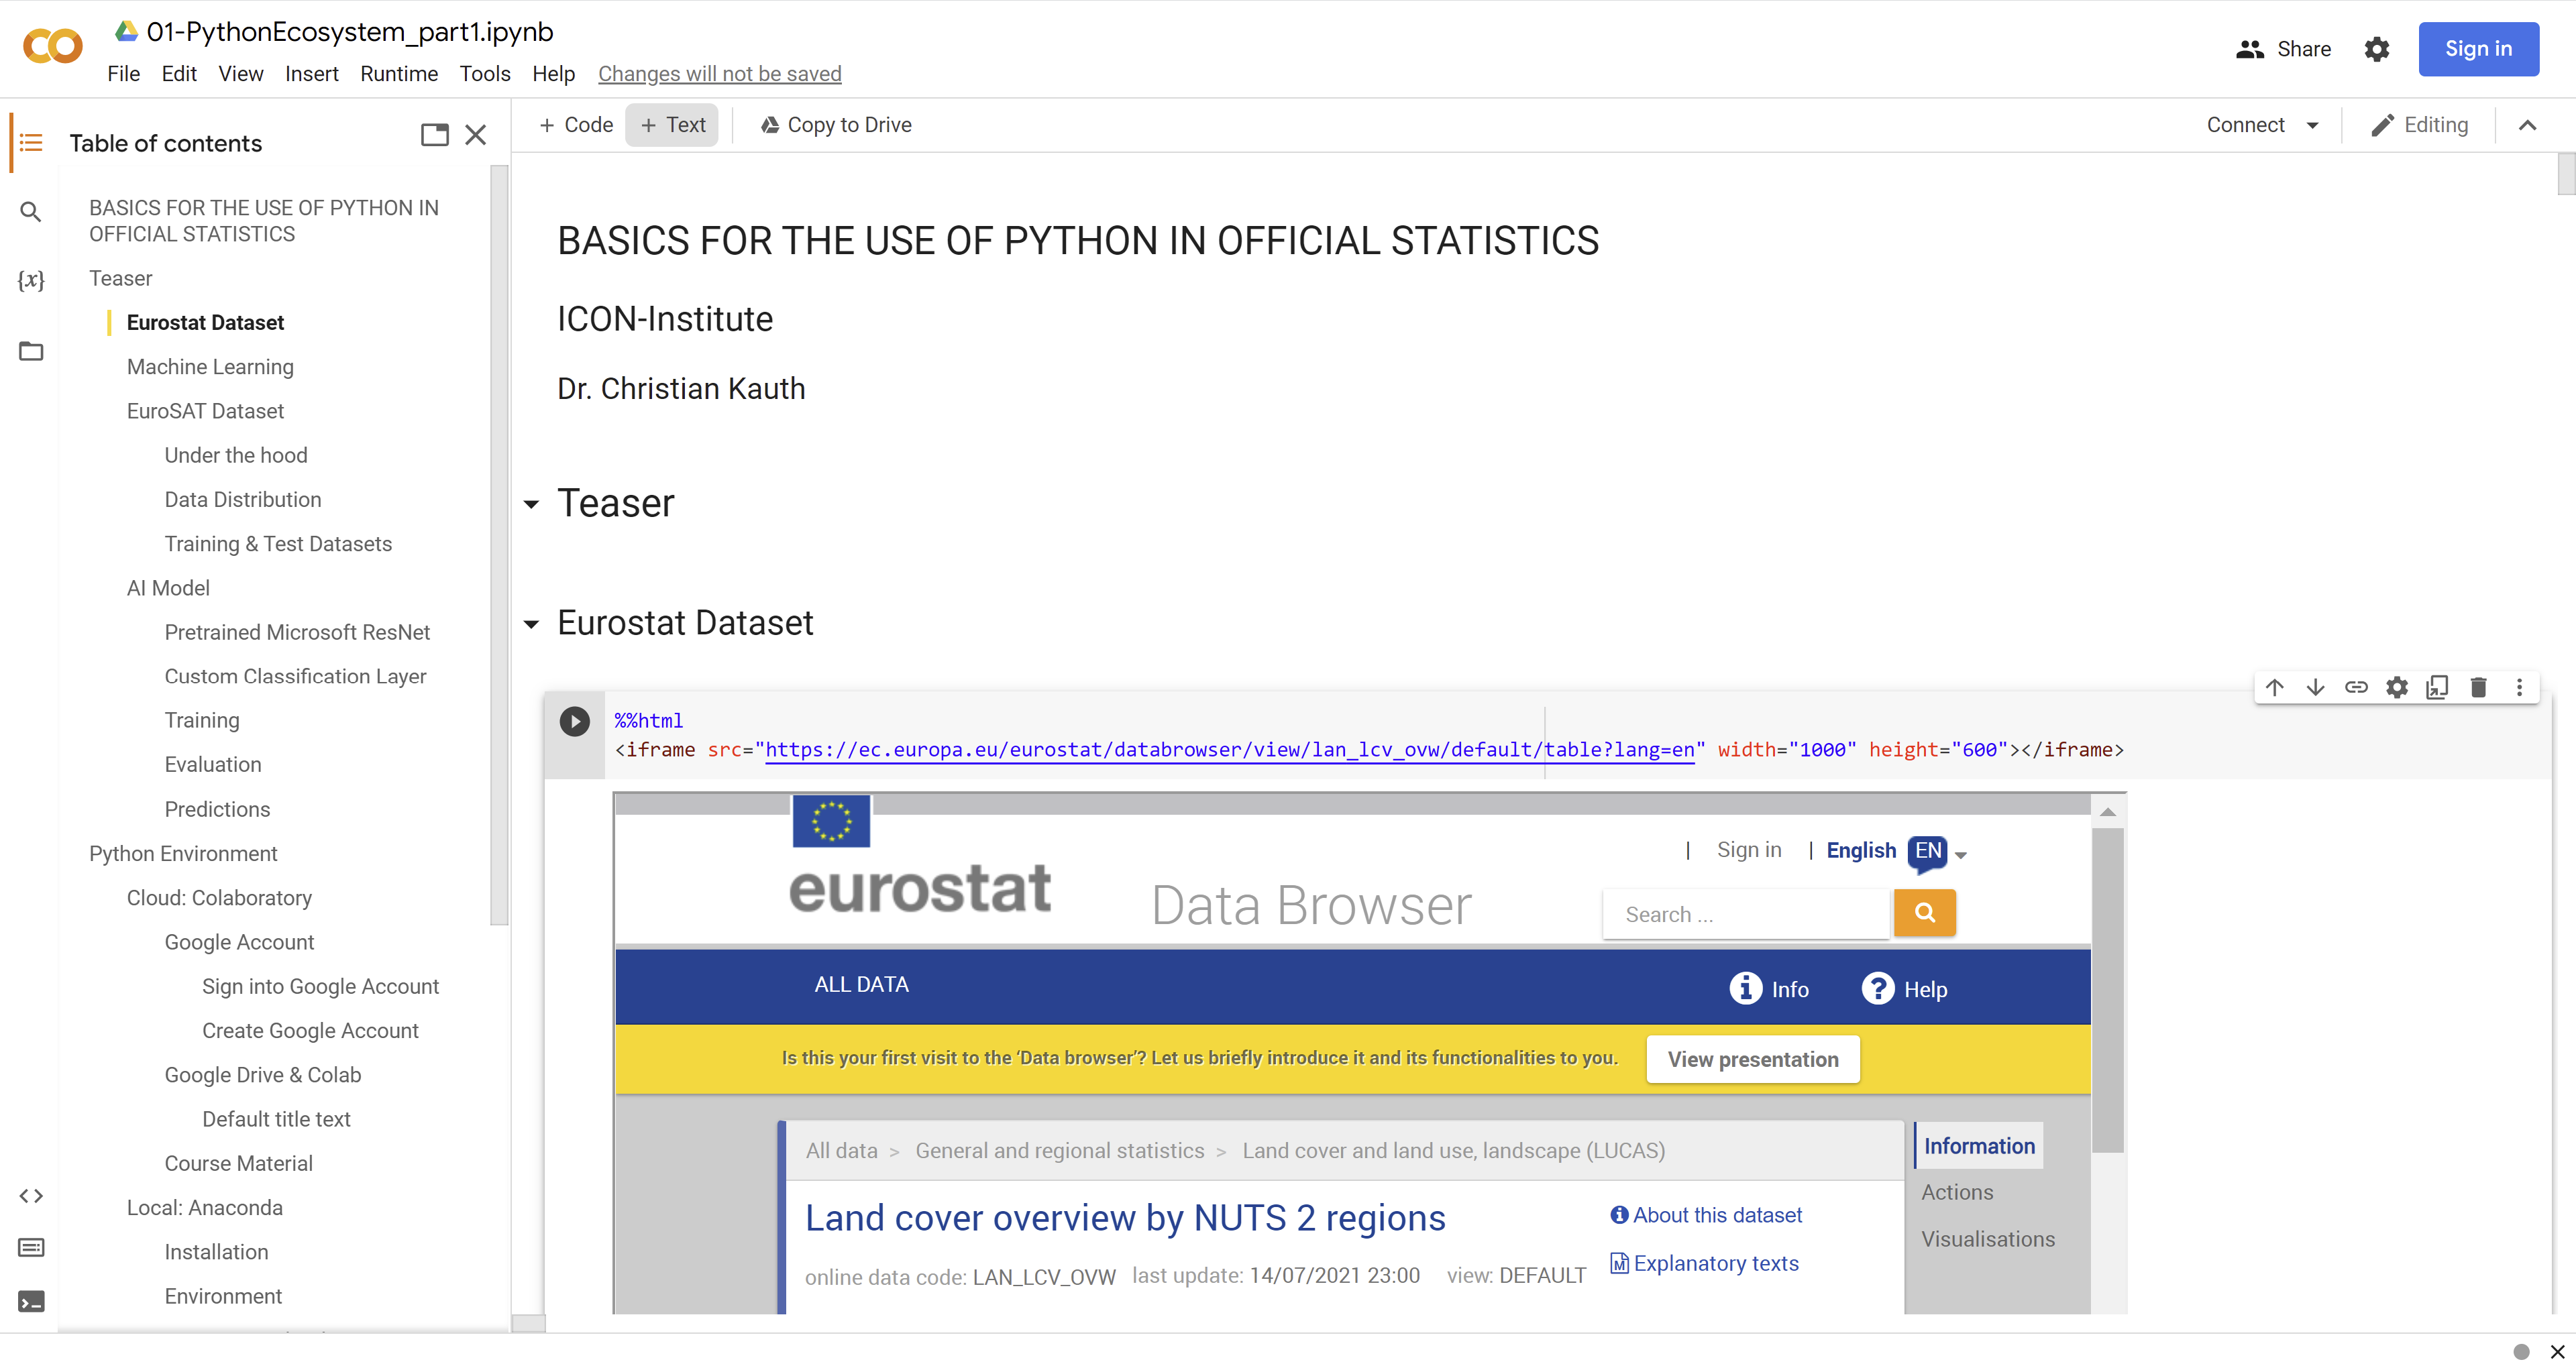

In [33]:
#@title Copy to Drive
base64_data = "iVBORw0KGgoAAAANSUhEUgAADwAAAAf4CAYAAACUFS0uAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAALEoAACxKAXd6dE0AAP+lSURBVHhe7N0FdBTXHgbwb5MQgSQECcEluAaCu7sXL64VWlooUvRRoLhLoUBx12LF3Z0EhxAckgAh7sm+nZkb3002ShK+3znzeu/szuzs7J07yzv59q966vRMDSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiShNUag3RJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiL8xA/JeIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIABoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQBoCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIQlVpDtIkylJdvjyKfpbXoxc/Iwl60iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiL4cBoApQ7rr6oQ9V2djRCEvsSZ+ZsX+B6MspUWPiIiIKHG83zrgxhNfFCxXA0WtDcRaIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIi/TGRQBnSplt74eAagCuemcSa+AW67BCtL8vPwwNPHc7g1OlTuPf8Mzx90m9G//HOPlCpVHotmXOXRssuQ7Fsy0V89E9/7/nIjJIR76Vy5w1w508rQA03/NUzb7TPOaGLteoPPArjySSi9MNhxyDYFqiIRo1qo1SuWlh9yVc8QtoEvN2FFuaZIub9fy6FiEeIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiL5urABMGc4xp8tYcXq53M5qGobFFfQPkpgW+gGZrOqLXuoJC3DFf//MwILFy3HqSZBYG6ls9f74btQI9P+mHMxVYmWieOLahj8wbpMDspf5BSsWtEP2JO0vblIAuFTXjaKnP3ObBhg7bwmGfZvU95t6pABwy3FP5LZ9p/U4rnnvKXlu0wMpALy8Z0UM3fJerEm4nJiM86GTUMrgKz+ZRJSiwkLcsGv2L1h5xg2FW83E6l+rikcSRo27GF2iJuY+jQz9Vuu5HYc3dv3q7wm6SAHgDiV74Kiv8n1t9cVgDKxlJLeJiIiIiIiIiIiIiIiIiIiIiIiIiIgodZ2/54+zDn547BwET49QhLGoG6UBBgYqZLUyRElbY9S3y4y65czEIxkfKwBThrPj1l7RAjwDDLD1nejoIdBlt2ilnreX5qJJ8QJo+9MireFfyf2razGsc3nUaDQcp5zDxNqECfZ0xMxva6F63wU4efwUnr3xEI+kPT6uZzC+V3n0+nk/XL7A9wTvtw5yBWZpOX36PtJxEWaiL8gTDmeU60ha7r/2E+uJkkfwp8fJMlf7vzqAn1pWQ7fx2+T74zuPAPEIERERERERERERERERERERERERERER0dfh0etA/LrMDbP++YgrN/zw2T2E4V9KM6SxKI1JaWxKY1Qaq9KY/RowAEwZyoY7B+Du6SJ6imNvM+Gj9lxtLOpANwS67hC9lOewYxAq1hmF02+CxZq43T+zEO1rNcbqS5GVBfUhhYybl6uCsVsfiDWpLxvG4NInd3z+/FnL8hzXTu/BkjFdkT9Kpdd9y9pj+JTz0PPjSzbvLs1D40aN5aVro114w0LpyaLx6H1aPvu4l6efR7P6bzqlxlNs/LZtxLW09qy7eIQoefg7H0jiXB2I6zt+Q+3iHbD8xEuxLmlUKI82vzZCTjFtqVAYHbs3YvVfIiIiIiIiIiIiIiIiIiIiIiIiIiIiSrOkqr+jF36Ak9PXEaik9E8aq9KYlcZuRscAMGUYH3zdceDWv6IXKUytwsY3+g/1INd9CAv6IHop5+O1uejfey0+irySFBIaMnM/nNz8oFarxRIAl0dHMGtQPeVJGlJ13FHfDMQR51CxRrewEDds/6N1gkLGKcUQZshmZQUrrUthVG3QET/N3A6nd0cwrG5WsRWwfXIXrDzpI3qUnhmbZdPy2ce3fD0l+Yko9QR7PsbCwVVQrdt83A5KXGV9Xer/uB83bv+LlYs34eKTm/i9TU7xCBEREREREREREREREREREREREREREVHaIlVRnbP2E6v9UrojjVlp7Gb0SsAMAFOGsfbWXoSGag+53vloBAcv0YmPOhSBrttFJ2UEvD2AQV3GR4SOrGy6Yc/9e/h7TFsUtY4aeDSBTcnmGL3qLO5sHxpRHddDc3yjflwNlzjurf6vDuCnltXQffJ/ESHj9MDEphlmblqF9gWN5b4arli7fA/c+T2CiIiSwbtbK9G+uh2Gr74n1iS/QnbtMfjnnqhZPLtYQ0RERERERERERERERERERERERERERJT2rNjvyfAvpVvS2JXGcEbGADBlCA4uT3Dl0VnR0277O0PRil+I+wWE+N4XveQWiMN/j8e+V0FyzwjVMWfPP+hQJovc18Wu61Ic3DoAOZUMMO4d/R5zN79ROtEE4vqO31C7eAcsP/FSrANqdlqEzUt6iF7aZlawC/43ub3oAY92/wfH98lboZGIiL42njg6pxPsqnyHw4+VX/hRwQZdftmOJeOLyH0iIiIiIiIiIiIiIiIiIiIiIiIiIiKir8X5e/5wcsrY1VMp45PGsDSWMyoGgClD2Hhzj2jp9tbLEIfdREcPgS47RCt5+TnvwOK5D0QP6Dh5DvrUijv8G65C14n4o0ce0QN2z9mMZzF+ZUMNF9w4cjCiurAKhTF2tSOO7RyGyjZG8rr0oGT9tqhpokxRftiOZy/SdwBYHRIADw+PiMXTJ3l+HSUswDPafj08kv+G5Rdt/x5QoutpU8xjTdvnOTAF9pmc0s7xxbx+kv9Yor/XwBCxOh7Rx1ta+/wipcRxptS1Fi7qNZdcc06I7xOcOngqoiq+uU0DzD94EzsWdkWxLJmUlWlIepp7JSl1n5PEnIO9ApJ3vBEREREREREREREREREREREREREREX2Nzjr4iRZR+paRxzIDwJTu/ffkApzfRQZq43LgXSZAJUroxiPM5zGC3E+JXvK5dmgNzviHym1z9MPQH2rDWO7FT4VC6PzdjxFVgF86LsDh075KR5Ce03/qXLQvaIyyDX7Fwfv3MX1geZjr97bTDAMTM1gaRZ+i1HDDob/nY96cefKyeOUFJDRf5Hz274jt58/ZhRf+as1+X2LXvMj9rj70WDwb8MZl/DM38jFlWY277vq9cKDrOcz5qT0KmmRGtmzZIhYrCwPYluuBJbvvJfg9hAW44uCyX9HULj8Mzayi7TdbNs3rFKuJX6bsxKMP8Yemgz2v4e+52t6XJ27um4VvKuZHlmj71xx77tL4duRKOKSRqsxBnxyxed4vaFzSJPaxas5zjmItMXbxQbz5nLATnZznOSoXx32YOKg+ChiaxdpnZs257frDYpx96i6eHSmlxn9MiT0+ybtr6yP2P2/ORtz0iPwloFtH/4rymLKs3OckHtXuxbXtGN+rEnIZJ/xYoop6XEvWRJ63YM/H2PRnX5TImyXa/s0yFUHPkRvhrGXMRG5jFGO8ZZbH2rhFCf9ckuLeoUVaz2dcx5nYsRvoeg3//PkdqpYw1nqtFSmn37UWc84990S5J4bPOz3rFI92zW28pCSyY263ZP05eb1En7naKEtVjFowAZWMDVCj0yxcvHsSv7bOJx5NPv7Ox3QeQzhdYzIsxE2ed7TOZ2LMX32t/R8mKT1H6Bprcd3nytUYgFWHnBJ9TUjHM6hNyVhzsJVZHtRo+yM2nnyb5oPRREREREREREREREREREREREREREREadVjZ/41LmUMGXksq9Qaok2ULvXfNhKe3vqV9m1b+Rt8my8QQS57xZq4qYyzw7z0X6KXdFJ4aX6bqhh56IPcbzTiKA7Pa6Z3AFiixl1MqlkP0654yH1d+3jlcAVZytRAjihFDR/v7INSXTfKbftO63Fc08+egsHgqK+XE5NxPnQSShno94L+r3aiY5lvcdRXCX6tvhiMgbWMou3TBM2x4/EhtCthKPfjE/PctRh9FPtmNUMm3MCovPUx771+v/ZgivbY93IPmhWMDCgfmVESLcc9kdvKue2Ku8sHotfPW/EmRpXmmOr1/RvrlgxGEYv4z83d/ePw/Y9zcOlt/CVKperPv6/ej3EDdAfAA97uQoeSPeTzHP6+GmS5gNE9+mDR8ZfiWdpJ1TMX7DmIQToqWEthtOU9K2Lolvdyv+X/zuG/yXXldvLwxLUN49Cp//J4z7FEOt6Jf6/C6PbFxBrdkvs8S8JCXmLD6H7ov+CMWKObCjboMX4D/p7aLNo+U2L8h88dyX18+tA1JkJ8H2Ppr50xfPU9sUY3XccSlba5z/f0VHTvMyXOz9jCpgWW/bcLve2VMf7JcSm6tB6B02+C5b4ulVrPwrato1BCj2s6qaLOPeHnU9/xa4TqmLBpNcb2LBfPfcgTR+cMQK8xeyKq58ZFutb+XL8Tw5rnFGuiU8eYc6X5va/dbUzo2BWzjr+Q10UVPv/H3C4+2uZqqdrz05vOyGNfOtp40XYeE8vr+lxkrTZKbms/Bu1jMuD2Sgz6dhgOP44Mzmsjjfn+03Zi0bi6scZ8Ss4Rsc9RNc0cPEKvObhB3+3YurYrcmu5JKLehyTS592n7APM+6EHxm6N/wdeKrX+A+vWTkAFa/6uERERERERERERERERERERERERERERUUK0++0NwvTIYxCldQYGKuyfl1/0Mpav4i/lgz7egv/rQ/B5tCpikdZJS4inEmRITaH+Lgj+fA8B787A7/ku+DxeA/+X+xDocgHBno8QGvBRPJPis/bWv3qHf60sbdDfvgNMbLpBZWIt1sZNHeSOAJdtopd0gW+v4/iZz6IHNK5nn6Dwr0SF8mj8bUXRA+5vuozXWm62Be2ih3/Tm8dnd0WEgTKjG4oWVqarYu0G46eimeV2II5i655bclsfH87tw4qrSrDJEHbo2a1xgs+/PmzKFcHd5V3R+actEaEoM5tSaNy0ERo2LBtRwTncufXfofcPOxF3UWFPHJnRFBXaz4gV6itctqG87/o1i4o1CjVeYMagCmjbfwdc9Pw+FuRzDRO/aR8R/pWCZhUbNJL3XzxP9BCZj+sZjPpmII44h1fvTD1SmH7riI6o3vevaMGzqMdbt3xesVYhHe/vHerg901PxRptUuY8S8f795BmscK14fuMeX7VcMWWP5vL+4w6LlJq/CfX8SUHqSr1+FY1YoV/rYrWkI+jUdNayB/lhwTCj6V57w16j/M31+agfcvJEZ9x+PuMOWa8XY9gWKuBOP0qDB+vzUXTqr9EhH+l4HcdLedGcvvQGIybdeGLVCZ12DEIjTpEH7+63l8IruKPXk0w+M/zOo9VGhvLB1RDi9HRw79R33/Ma0K61n5tURWTtsd1rUUKDXmJlUPaaw3/Jj8TFK8cPfybFkhjsk3NH6KFf8PHfOw5xxVrJtTTOuek5j3SYcdQtO4XOQfrOl7JmfXdMHyK7nEWTgpM21jdwIR29aOFf8PHW8zrX3L70P/QpOZAnHJOG1XpiYiIiIiIiIiIiIiIiIiIiIiIiIiI0guGfymjyMhjOcMFgEP93sH32Ta4X/geH463h8u/VTXt7+B5czJ8Hq2MWKR10vLxdE+4HmokP18KBqdEIDjU/73mmLbgk+Y1XPbVwIejbfHpbH94XBsFL4dZ8Hm4HJ63p+HzleH4dLo3PhxpCdeD9TSPj5GDy+ogL7Eniuq990ccvPWv6MWvW+WOogWY5O4sWvELdtuHsCBX0UuawFePIkKtUsjFvnw2uZ1QpcvWFi3A0+02nr3JWJNUiO91rFl6WPQA2+YNUSqPMl0ZmtRFp6HV5Lbk1ILduO2nz/v3xMHNKyMCbKWb/4AmlZTQngrF0XvLAZw8dVJeNkxuJa+XmKMf1p1U1ocv/52aBHtr3ekxhyNjMHz4Ifm1yjb4FftvfoKfy0OcOHYSp07dg1uQBy5s+x218hmJLYBLm4dhyykf0YspEEdmdEbLcSdEX6mwOWX1eXzwC8Pze6fkfZ+55KSZbzxw68hCtCxpIp6pf/AqGC/w58DOmH3OQ97/tE3X4RnsgtunT8r7f/IuBB4vzmBy99JiC8DDdTtmzz4En1QdgoE4OmMQvl1wWvSBHEU74O+D96Id7znHtwj2eYF983pEBMak4Ny83r2x+pKv3I8u5c7zq/+WYNK6yPtL3b6LcPuVb8Q+w8+vy6N9+KVpIfEs4Oz6YVixP/JHIVJi/EuS6/jy1vot4jo5cWo5ulpF/gpBj/E7ol1H0jKhW1nxqEIKmy7u21YegxIp0N35l7/lY/nsdFk+jpPHLuJ1aJjmWI7g9w628vMklzb31Wucv3FajgHfjMXtoDC5cuiVKO9TGjOBHx2w4tcG4tnKGJ84/Wf81m2ivI1UNfd/8rXxHOcjzo0vnM4sijYeDv75J448Sd1wvDT39O+9Vv6cpcDkdzOP4Y1X5NjVdU1snNAFk3QE488u+Rk/ro0cG9KctuPiWwSoI9+/dE3E3u8LLPllohyejs+xpaMjKoVL1/Lk1btw7tYzfP78GU/unEaD4sr8H3OuPrDie3m9JDFzdVoRdUwqY34DHrj5RYz58Dkn5n1D25yTUnNETFHHWo1Os+TrKL7j3TV5FHbcivuaiHofkoTfQ8PHm3L9++Odw3b80CRyLvrwbB0G95iKe176vFciIiIiIiIiIiIiIiIiIiIiIiIiIiIiovQhQwSA1cHeclD289VR+HCsPbzvzkPQx5sI9X0nnhE3aXvp+VIwWAoEfzzTSwneatYnlrStvL9T3fDhaDvNMS1AsOY1oNYvDKQO8UfAu1NycNn1v8b4dH4w/J7vFo+SZN2tvVCr9av2Vjx/eTQvVkv0gExW9WFoET14ppNajUDX7aKTNC5vIkNU5qiEwqKqbUJZFC6JmibKtgHYh9dvMk7VuxDfx1j6c08suaZcf1IYqscPnZA7SoarWvsBaGCmBJPc3GZh33+f5HZc/Jz3Y+PGyDmh06Co+8wKuwaN0KihslQrk0Osl4LahVG9QcOIx6SlYUN75DTTHSp7d/WyHOSq1XM9jh+bj7b22cUjCpVRVtTuNgP79sxAJWPlc5RCeJs3/qc1SPvx1lKMm3xK9IBKrWfhxsNTmDiwTqzjMDDNikrNf8H+mw5Y0L+4WAtsn9wFc/fFXV08FA64cuUtrGy6YeOpgxjfswosIrNbsqyF6mPS1sP4q38JsQa49PdfOPU0/rktyP8zPDw89F48daSKXU9NRe/xkSHdmj1X4PrtPRjSumys4zXKUgjtRmyB48P1aF9QqWUpVT2dOXwpnsX4dY+UO8+euHh0V0SwrlzzFdixdhgqFlCqdEZlU7Id5v93FvO+zS2P/XaDxqF2mejzRPKP/+Q7Pot8dlGulSooYBYZAM5bqmaUx5SlVuno18adtaMwcp9S1V3a/8h157Fz4RAdx9IcM/bewp6JjcUaYOfkn7FBa7g7kpvDFdx8Fypfn/8dmITqMfZtnKMChixYF22MX9SM8Q0vAuTw7/KLJzE51rVhgqL1h2H3sY1onkV5QKq+un2//tVXk0P43CNdw3vu38OKMU2RzyL62A2/Jp483x5xTUjzz6Leo3BMS1i3wc8bsfePVnLl8s5jjuLKqQXoUitvrMqw4fu9fXl2xLwmhadXbtF894nH7p17lLl+/H48frgX/xvYCXUr2cLKygrF7RqgqHX4GIs+V9ezj6w0m5i5Oq0IH5PS+Fp45J5mzPdGaWsz8ahCmnOk+8aZ+xcxup6VWKt9zCf/HBFb+FiTxsTxnaNjXUfhxxv1PifNvZu3n4wzpB9+H5KEjzfpHhp9vJkgT4Wu+Ou4Aw5PbyLWAc7XJmPKgi9TeZuIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKCVETxWlQ1JQ1+1YezkoG/j+jFibNCEej+X9SfuVqgInJAisDg2Ez5N1EduGeDmLR5Im+NMdeDnMxIfjHRDw5ohmjfZg3Nfi5ruHuP7kvOjFr3flb0QrkkmebqIVvxD3SwjxcRS9xHvudFW0gFyNc8NKlbhgkoGJGSyNIi9fT68A0Uq7QuGPz1pCnpHLC5zePhPtKtth+NrISpQ1e87GgHY5RU+R2bYrho0sI3rA7tW74RLPJXHt0Bqc8VdCqoUqTEaXVpEh35SQM9cvWPJXb+TJpPszzlntZ0yfXEf0gEfrL+Gpf/Q3IlVEXT9lthy0kthWm4wNW0ahZLa4x45RlpL4Zc1xLPs2j9yXAn4rJy3D/XgqQUohvB8WzkWHMlnEmthUKIS+EyZEBMykoOO9h5/ldlxOzm6PbNmy6b30mHtBbBlJjbtY9sdfEWFV6Xys/GsIisQIOcaUrURvLFr+sxxilN5jniKBcI8yaFLyPKs1Z8jjY2QkrUCNMnEG6wyMCuHHGUdw+907/LtqGOoXjx6STe7xn9zHl1hBn45j4ZQDogd0m7wT0/pGhqu1y4oOU/7B3Pa55J4UHvxnZfwVqcOvT13vUxrjvX/9GWWMoj9hyPKNGFRL97VhVrAdhgyLrEr64MLDeD+b5CaFSOfs+SfOa1hiVrALNh2YFxHOlH5MYsGyE1rCk5pzPOkQ7t64hSUzmsE87ktCM6+NxD8rOokecHrBf3gUI2yvTdMRG7BuWlvkiMyMf1Wkeem3jRsxrHn0+11MmbJWw9Q9O9CnsKncl8b8oimboo2z1LpHSvPk9ElN4xwT0n1u4pjIH1x5dOQ2XusxHqSAfvzjLStajN2FzcMiq9Lvn5z6lbeJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiFJKug0ASxV7pUq9UlA3KZV64xJRxVfzOgHvz4q1OqhD5Qq9UkDX58GyFDumUN+38LgxUa5UHOh6Uaz9+my6uVe04lenTGOUyxVZJTCcoVkJGOVsJHrxC3TZIVrJw9TKLFYFRX2Z5CuMcpaRW7/76CFaaddnzEKtHNm1Bj2VpQgadR+Lw48DxRZAufp/4G+tIT0TNO08JCKc9/Docpy4rTvwI4VGT265I3pA25+/RdnM8aTYkqjvvJGwt4zvNUxQs0FT0ZYCeC/g6hK9Aqev4wGsOfRBbhvCDmMXjNR89voduxRi7Dd1VkRQ96XjZOyMpxJkoQrDMbBrPtHTzcy2IurYWYgecP/pc9FKWR/O7cPy80rYOKHno2Crn7F6zUE8dXuH89smoWreyFtgap7nzy/exxtQNS1oB7s8um7RKTv+k358ifP81Ea5yq7EHP3w/Q+19ZojpfPfa9hg0QPurN+CS6/jrore/c+h8V6fZiXtUMsq8ghy5RqDQX2KiZ4uJihbKbLa/Jt9z+Ghjj/smJw6z1gSZ0g5KvMKP2H+zHqiB1yavQe33LWfu9z2leIMhkdVulnXiErInm638epN3OdA+rzHjWmS6HtiRlC972JM6Blf4F1hnKMppiweJHra5oDUuUf2HjUUxeN9ngnsazQTbcDd8Tk+eMQ/HqbP76XneMuKzpNmo6uVkhz/EpW3iYiIiIiIiIiIiIiIiIiIiIiIiIiIiIhSSroMAHvengL3C9/LlXpTQ6jvO3hcHYnPV0dpDfaqg7zw6dwguUJvWMBHsTZlhXg+xefLv2rOxVTNAcQddMpoDj0+h5cuj0QvbpkymWGAluq/4Uxz9wAMlSp68QnzdUKQ+wnRy7gC3u5CC/NMUKlUei+tJutfjVkfUiXELr9sx7HjE3WGMLNUaIsBra3ltlQBcfP2k1oqVyqk0OiKq0pIWgoWdW4XOxCenKTXaNssr+jFzaRgqYignFSB822MMo3Xj/6DByHKutLNf0CbmvoF+8Jltm2H3r0jj+XkiUtxhjub//ANihrok7qyQR5bM9EGPvukThXqWxd3RVT/Tej5kIKi7fu1RlHr2Le+lDzPKuRCmRollY7G1fXDMGz6cXwKFisSITnHf0ocX0Kp4YaLR06LHlBtRA/UzKX/V5Tsleujd3YlPipdR/ce+MltbTKhAZrWsxU93aRK61kzKaFuSblejfQKReYpXEG0Up8JmqPHN/aip59q7QdEhNe98DcuXdN97qIKC/CMUsHdX6xVRP2RCunzeP0m7u8pFb/riMparsuvhXTP69m7VbzVlaPK36wrfiqaWW5Lc8CFa85yO1xK3yOt8Ava61lJP5t1btGC5hhc4OUjOjrUGZ2w618KRHf/uZToAXeO3Er1yttERERERERERERERERERERERERERERERCkhXaUtpPCtVI3X/+UBsSZ1Bb4/g1C/96KnCPV7i49n+yD48z2xJnX5v9yPz5d+hjo0dcJ3X1qYWo2dt/8Vvfh1rNwRVqaRVUpjUhlawNhGd0A4piCX3Zr/TZ7AdViIFIRJnCDX93jqE7m1sZIfTfesitbAsD824tYrZ+xY2BV5MulOQ4VX/cwpnnJh9lZcdtP22Xji4OaVEaHRhAaLEqNg4xoomQxhNjVe4uFNF9EDKjSx17sCZ6SsqN2kgWgDj/6+jTdxVCStULqIaCW/xqP34fPnz3ovW0fWEVsqpPPh7OAqeok9H7GlxnmuM2AKBovAtBquWDuhGQoUKI3Bo1bhyG1neAUkLK2W3OM/uY8v4V7h1sHIH9BQu53BkjnzME/PZdHKg3jtH1nh9MmL6PfqqMxRHSWKJfz6tCtfJM1XqC3auCOqFY8MLevDzLYe2jTKLnrAzXsPRSs218dHMeenrqhawhiGZlZRKrhnhoGqCJp0+RHLtpzA688Ju0+WrVg6QeHXjCYruqN2An90wNCkGhp2zSN6wP07D6P9uENK3yMLt7dHHrOU+dCaNqyVwGvNBLUatBNt4M3J23iRwDFIRERERERERERERERERERERERERERERJQWpWwKLhmFeD6Rw7+pVfVXG7OCbWCUtYToQQ79fjzTB6G+b8WaLyPwwzV8Oj8IoQGfxJqMa82tvfDy1q/Ksk2OQuhevoXo6WZi3Q4GZvlFL27q4M8IcNkmegmXp1A10QLe7HsOjziCmHFRhwQiMEq2pWjByOp6SaUyskTRuvXRuGkjvZe8VvFXUc6GMbj0yV1r0FNaPP3D8NnpMhZN6oWKBZSqhvHJ1agbvq9uJbd9sA679j+T21H5Oe/Hxo3v5LYh7NCzW+MUD/GZWpkl02t8gPM5L9EGyhZPXDg3akVSH9zGqze6x51JJtFIAcZm2WBlZaX3kjVWIjB5zkdsKX+ejbLUxaLT69G9dOS14u/6CKvnDkFL+6KwMsuDyg0H4I9/duPec/0qsCbn+E+J40uIwLcv4OQbInrA6U0zMHL0SL2XUaMX40yUAPArl8hAd0yGiKxcnRAGRonbLjUVqF4mweF1FXKjSAVL0dNezTvo0zX80UOz71ItMHrZTtx4Grs8tBovcHLXcvzUsykKZa+Oee/1Hyfm5mn/3KakxIVpTVCkeDnR1lzrHz1i/ahISt4jDYw0c7poJydTtEeZEgkfDxaFS6KmifLPGn2qDBMRERERERERERERERERERERERERERERpQfpIgAc4v0Bn29tQKivElD4ElSZzGFZfoToAcHujvh0tj/UQZGhsS9JCka7Hp+GEF93sSbjeePliv9u6V/9t0fljqIVP+PcXUUrfsGu+xEWqLu6ZFysrGxEC/DDQ7i4JC4AHPjqEY6KsJwUlsmXHGVQBRObZlh2+AROHDup97L616pia92k0F02LSHP8MXSNOHvQYXy6PRjM9EDDizZgvt+0c/ptX1rIoKBdp1GoFWlhFXHTEtsrJUgFylS6nyk1H7NCnbBxssPsXNuXxTPE30cSlV3b51Zi8mDOqO8bRZUbjkCBx3jns+Te/wn9/FR6jNIVIDfBJktIj/vT07v4R5lGPm/Oobv2zfB5G2RlYFVKIx6Tfpj7Ky5mDt7LubMnoAhXZugSvEU/AWBDCyxYdrM5pHB7bfnn+NzjB8VSa/3SAOjhH8fMDAxg6WR8s+aQFzBm/esAExERERERERERERERERERERERERERERE6V+aDwCHhQTh+frv8P74HhiYNxJrU595qSFQZbKQ26H+rnC/OlJupxUhweXx8fJRvNjwo3zOMqLjTpdFK34WhhVw71ZJ/LXXV69l1cmyOOvWV+/l0q274pUSxrqUXUSFOj9sx4OniQuoOD+6IVqAGUqhcOF0keVPEWVaDUKfwkrV0peOk7Hzv8hK2KGB57F72TW5rYIN+v/wDbInX1Y61QXGLrr5VUup85GS59koa2F0/m0dHjl/wp3TWzFvzGCtoclbRxagnV0ZDJl3PVZVz6iSe/wn9/El1qilx3Dy1MlELxO6lRV7ooTKUSxPxDhRww1b/xiGtRe95b48jqYdg5ufM84eX4Ppo3/Db6N+w8hRU/H39uO4/iQILo+OYNb3zZAzHc+16VG+ukWQTRX7pH9N98hwJqiB/Hm+3u9FRERERERERERERERERERERERERERERJRxpPm/jn+z83f4v3skt11OHfgiIWDDzHmQpWgPua0ODcTny8OgDvws99OC0NDKcL99RW77vXbEm11j5XZG09++AyzNc4pe3Pyca+PKTU/cuBek97LnSg29ljOPa6NOzciKeglhZlsatQuaiR5w/vJt0dKfGi9xal9kGLrsd7WQX0vo52thnKMp+g+rIXrA7tW7EV5Y+c2xHVj6zE9uF6owHC0bZpHb6YcJzApF1oV0ev5ctBLm8wcX0ZIqRheGdbpN5iXP+Ygt9c+zgWlW2DXojhEzV8qhSe+Pj3B463wMbF1CPEOpurt6ZFvM3fdRrIktpcZ/ch2fvgzNsyKX+HEESeFyDdGoYaNEL7VKZxd7+rq43nserXqvPqR7irODl+hF5+u4A/M2PBE9oNvknVgxvilymuke2zYlm2PU8j/RN3dmsYbi82r3c7jFqN6rD+eHyne/uKS3e2QA9uH1m4T/OErgq0c46hsiekREREREREREREREREREREREREREREREGUOaDgC7nV0Fj7tHRE/xJULAWe3/J1qAx41xCPFyFr0vLww18OnmOdFTeDgexofza0UvY+li30G0dFN51IXKNweCAvygDktchd24tK1rIloJp0J51OpuK3rAqQW7cdsvYaEff+dzOHgssoJf9Tr2MP9687+yau0HoIGZodx+eHQ5TtwOlUNtu/7ZIa+TtPn5GxQ1SF8nSoUSqNQwh+gB1688hE/CM2J46HBCtIC8jUsjTxzhvbQsuc5HTGnhPJvnKIkW3Ydj9cHHcDozGw3zK1V3pZDtqkn/4FmY7gNKjfGflOPTh1HW3ChUIjIwevF6wn8cgQDn3bfw0j9hn0VY4CvcPhn5oyYVSxURLeDt42t4EKLszxz98P0PtREZldct8O0L3PNKidrQGZMnzuCJU8K+r0jX+INrHqIHFKhYWmf13vR2j7zumPAfYXB+dEO0NN/bc1VC0fzp8z5HRERERERERERERERERERERERERERERBRVmg0AB7g9g8uxhaIXXWqGgE3y1Idxzspy2//1IQS+jx62/ZKk8O/HaydFL7r3R+cj6NMr0cs4Wpesh0K5S4qeFqGWMHSpA5WBCiqVCiFBAeKB5GFb0Aj17RIfAJYqjTbtPARljJRgipvbLGze81Zu6ycQR1bPxhn/ULknBbLaNssrt79mmW3boXdv5TyEwgGbt5+Eu+MBrDn0QV4nnafO7YrK7fTFBJXrRIbeb/y9BpdeJywkFuJ7HntWR1bwrNjCHrnTbS5Kcz5qthTtxJ2Pzx8jA3ORUu88BwTEH84sWn8U1v71nehp7nmOl/H0he7jSc7xnxLHpw/pxxFqtyskesCljaeSHCr+GnlgEfb9F/kDEfqQqsCu/hgotzOhAWrY55HbkudOV0ULKNi4Bkpa6/e10fXWWVZjTYBgnMHWPbdETz++0jV+NLL6dr0qpUUrtvR2jzy6fE+Crn817mLPyrOiB5TtVRMF0tkPfhARERERERERERERERERERERERERUepxcXGBg4ODzkV6nIgorUizAeB3+6YAat1//C+FgFWmdURPO1UmcznAK1XwzV5nBayb7UPuDtdh0/qU3JfWmxVsIz9PF8vyI0QL8HmwTLQST2ViBbMi38Cq+jzkbLQVuVoek4/Juvkh5GiwQXNMk+RjVhmaii20Cw6prDP8KwsLxbuDf4pOxtIjjirAKnfNuVMbyuFfKVIWEhykORXJF0JqXzfuz0UfWSq0xYDW1qIH/DNyJI44K4He+Hy8tgTT5j0QPaDl5AGomStNF/JOJVnRdejoiGD1mdl/YeKKTRGVK5NynkLwGf7JmyNPkPyN2+Onokpl1ADsw8zpBxNQnTYQJxZPwSpnf7lngubo1s5ebqdXeWq1Q5/CynWY0PMhhXTHVM8L23I9sPLQfXhFCbum7HkOhPPZvzGoTUnU7rURLnrsN5ddPTTPYiS3A3EF7z7EtVFSx39KH5/Cx0c5P7rUaT0o4j28cPwdyzY4yW19+L/aiQ6FimLQHzvh/FmPN5CBrZk6D/e89DsHIb7XMW/aetEDSjbvjmrFlUqxElPzyB+YcDvpAo84vpeFi7nP1PKl5+qk+nfsn3p/F5Cq926YNT3iGs+Vawwa1ssit7VLuXtkSkjo9e+4ZTamXVF+3EEFG3RsVUuvStVERERERERERERERERERERERERERPT1kcK9PXv2xIgRI3Qu0uMMARNRWpEmk4Nej8/D5/l10dPN9dxRqI2qil4kKdBrXmowcjXbj2zV58ohX6mKr2FmJciiymQh96X1UgjYpvVpWJQfESsILO0jfBufR6sQ6q9USksMQ7NccrjXpsVRZLUbC9M89WBkWQwGJtkiHs9kVVpzTG3lY87V8iiylOiveSB2tdmgADt8vhV/JWL5PD69KHoZR7V8ZVGpaE3RiyKwMIw+2kFlYCAHgOXFQIWwkGDxhKSpXNYY5W0ziV7iqVAIfSeNRiVj5fLzcN2OoT2mxRvYkgJug7qMx+0gpdJmjlzf49cfajPkIkQNVksBzuXLlcqVUhizV4+EhYFy5y8hWoA3zuD+o6RVN00KQ5O6GDC+tegBZ/4eghHzryNI9OPisGMoeo8/IXpAu8nj0aJEZLgvPTLO0RT9R9QTPeV8/G/l3XjPhxSYW/XzIDmk+/z+NvzSZjyuuEVecyl5nl8eGImiDb7HP4ee4Pbu0Zi/4al4RDcvJ4eICqpmaADbAnHfrpMy/lPu+KxhW89StDXn6crtOEPV5hV6Y/yPpUQPWNK/N1Zf8hU93aTA6R+DRmPfK2f8M7krapYaiwdBcc+nGdlrx5n47sf4g9zKNdELS655y30pOPndqJ7RKleXLltbtIDP2IsLV/xETztpnxvH/hqxz9SUOnN1IM5vGIG2tWqhSZcR+O9B3OcjIaTrVp/vAtIxHJ0xCEO3vBd9oOufA1Epc5QPTovkvEemBn2v/4/X5qJ//y2iB5Rt/gc6N9L9wz5ERERERERERERERERERERERERERPR1c3V1Fa246fs8IqKUlvYCwAmsXPvh0ploIeBMOSvLwV/zUkPkoK++shTtIW8nhYIlhpnzyOskoQEf4fN0g9xODLPCHZGzyV453AuVfqdcZZQZFmV+hHWT3ciUrbRYK4V/K8LD8ZLoxe/N/qnyOc1oemupAmzwsR7CYzPSf8PboaEhyVIFuEN9M9FKupz2P2H65EaiBzhfm4zWTX/EgVvuYk1Unri77w80qfUt9r1S4ohSUGvEyqmoxeq/EaRgdeeBXUUvUqW+A9AoSkVLfZgULBVR3TQUDpgxbi4eR6kq6v32Ed6kYpXRiv3n4K/+SihZDVesGlkNXX7aiEcftIfdgj0fY+WolmjS/R98FIdpW20yJg2v80VDXkH+n+Hh4ZHAJXbV2LqD52B0PSu5LZ2PBd83Rc9fN+qs/Broeg5TerTEj2ufiDVAlznj0axg9Osnpc5zwbZDMLGe8mMP0n7n9quLAX8exycdv00Q9OmcZn5YKnqafTZviFJ54r7WkzL+U+r4pGOytbMRPeD6+ulYsCOyqqc6xBOOjyJDjFKV0o6//YH2BZWzF4Kr+KF2Y0zefAPeOqZwj2f7MaR5Y8w6/kLuS3PjLytHooxx3GHIjO7S5r5o0mgsLrzSHlCVrolxHRtFuyYafLcS/WIEJ3PWbh5RGVuaC8f1+UlnldpgT0fM+rYVBizR/ztKUhnnLZyqc/XjPT/hm34LcPDyZZzctQB9Gv6GS27JFzqWvgs0sh+A3Vq/Cyhzzt/DW6DluMgfHChabSZ+HVBM9HRLzntkapCu/yG1y2HsP7quf09c3/EbmtUdE/HDKEaojjHTB0ULsRMREREREREREREREREREREREREREUV1584d0Yqbvs8jIkppaS496H7nAII+vRI9/UghYGSqIYd3c9RZkaDgb1TSdlJFYKnyb9QAsc+Tf6QUsNxOKItyvyJrxXFQGSYudmdoZoPsdVbDNF9jBAdVhodjwir6SufS/fZ+0cs4ClvlQZMKrURP89n52MPQq2BE5V8DlQEMDKS29F/DJAeAm9UyQb4cyXm5mKD52NX4Z0h50QdeXVuBdpVzoEi5Rvhx1BzMmzMPvwxshqolrFGhw2Rcequ8ByngNmjuAYxsn1PuU6T8zfpgVPWsoqecq569W8E8gWEg03xN0bVnHtEDHhz9HaWyG6BMjUaaz8MYufL/jgfeyRcqi48U3Bq8ZFNE6FWyf1kflMmVFzXa/oipizfjyOnDWL90vmbM1INt9tL4bu6RiFCqlU03LNs6AeUsv2wq6uTs9siWLVuCluLZZuNRWPRzbWhaAZM3bkD30qZyXwqt7lrUB8Wy26LLD+OxeM1unDq9FyvmTsTgDhWQP099TN72UH6upFbP9Zj9m5bq8Sl0nlUoj7Eb/44ItkrHu3ZCMxQrXRNDR63CgVOnNMd7Csf+XYsxQ9uhaK4GWHzeU36uFGj7dUovvQJtiR3/KXl8dVoPQhkj5UEpoDmpe3Fkzl0ajRqVQy5jK/y+LTIQLDEr2AWrd/4ZUSFdCgH+0asqbPKXlj/blVsORftsixdvj7UXIyvY9p6286ueG5uM2xARYr9/ZibqFbKNMXYnRVwTM/91lp8nkYLri2e3jTVWpMrYg6b3QE6x/sOzdWhVtJj8WWzYczLauLDNXhFjtz6QP4eRmzZhaC7l+kxJ0lzdZ2Bx0UvpudoTN88ej7jeJZ/cVuChU9IDwBU7LcTqaY3ltnSOO2u+C5SrMQDjZ6+Wr78d6xZEzDnfL9R85xWkOWfp1pEoqvm+o4/kukemJFO0x4rN0+U5QI0XmDmoKgqWqil/L5LGnDTeZowZIn83qtZtfkT4V3ovv23ciF726bvKPRERERERERERERERERERERERERERpSwfHx/Ripu+zyMiSmlpLgDs6fifaCVMkI+pHN5NDlL4N7wSsBSFCnhzXLQTxqLCKGQp1lP0Ek8KD1tVnak5ksjQRkJ43j0sWhlLP/sOMDOVQtqGMHCtrawMJ4VZRBhYbqulQsiJCwGbZ1GhQ12lAmJyksKGA/4+j71/tIoIV0le3D+N5XNHY+TokVi85jhuPI0sw6lCYfy++jiW/lb1i1ZyTasMTaqix3cNRA8oVGE4WjbMInoJkRU9xs+LCESGe3j1dLTPIzUZZamKafvPYkaPMmKNEtS8enA5Jv3SCy0btUK/n3/TjJnzeBMlMFu2we847rgFLWwzVihKqqi+/vxR/NK0kFgjnY8X2LViOn4Z2BmNG32DH0ZNw+p9d6MF9toP3YfdG/voDKym1HmWgq3/HJiHhvkziTVS9dor+GvuELRr3FhzvI3RvOMAzP7rQMR+pXDt5H83YWA1/cZwUsZ/Sh2feYXBmDdFCTaG83d9hNOn70f7XKLKWW0kDl5ejpYlTcQaZRvps/2uZxutn2343LhqfN2vem4M+JQVPVcew/LB5eR+7LE7NdY1UbPTIhw+MUnnDwTYdV2GjbNaR9ynwq+zvp2axBoXUghT+oGKaT1LwNQwNb5iSlWjZ0X8GEC4lJmrsyJvsSKirTCEHUxMdUwmCeDxNAD1x+7G4dmR5/n+1bWYPmawfP116z9Cy5zzK/ZfStjcnnz3yJRVpM4YHDg9C7XyKdWdpblI+l4kjTlpvI2bvSra52tu0wAz/72Amb0iw+BERERERERERERERERERERERERERETaPHv2TLTipu/ziIhSWpoKAIcFB8D32VXR01/mghVRoPMM0Utewe6OUAcplQ4TwqxQW2Sx7Sp6yaNApz+RuZC96OlPOqdhQf6il3FkzmSK9pXaw8CjAQyCssphXwNDQ6gMNIvKQF40HWjWKm21WlkSqHVdU5imWKIsKzpMOoSrp1egZ+OCYl1sUqiqbrdZuPr2GaYPLM/wrw5quOHyiWuiB3Qa1VPvyogxSYHIHbfO449eFaMFtCUGMIWxkktKVZmyVsDvW+7D6cwidLTLJ9Zql71oC/y56S6unJqBKrnS3G89JAvjHPWw8JgDbvw7M1pYVJsiZbvjnxNv8O/SdvFW002p85yjwk84eu8uVv7eHvnjGJfh1/ult5cwvn0xsTZ+SR3/KXN8Jmgx9iCubRuLRiViz1zGRtqrxOa1H4J9Vx2wcVofFM+jO+AoHUudbn/g6P37nBs1/D56IMSwEL5feUPnOQ8XPnaP7RyGEhZxjRPNZzjqIK6cXhTndSZfY2fvY6X8AxX6j7ukkn4MYMPlq1j4ffMUn6vrDJiNMU0Ly21p7PWctgRdk6HirI9jAEJgKZ/nOxcWxznvmNmUwk8zj+HssQWoa5uwuT0575EpLV+tkTh186TWe3C48Lno1K2TGJ2AuZKIiIiIiIiIiIiIiIiIiIiIiIjoa+Xl5YXdu3dj0aJF8iK1pXX6SMq26YEan7BqSAXY2tqidJEpcIpSuIXSj4sXL2LPnj06q/c6ODjA1dVV9OImPc/JyUn0opP2L72O9HqUusxymqJX/1zY8Gc+HFxQIHKZlx+bxuZCv3pxpwqKNciGf2bnl7fZMc4a1XOlzb+nTjhDdBpgg73iXMzvZ4nMGeWtEVRqDdH+4rzuH8OLzb+Knn4MjExQauQRGFnaiDXJy/v+Evg+3SB6+jHMkhfWjXdLByfWJJ9gTxc8mtsM6gRWsy3ccxEsyzYVvYzlsqMPpEK/0v9IcV8pCKz0lXVSW/O/Yr14LAHsikVWxExpXi8dcOX2Ldx96i7WmKBg2ZqoVdce+eIMaJHEx3EpqlcehgchauTKNQZHns9ApWS4Y4UFeMLd9TnuOvuhQKnSKGCdDSZfIAAcU+zxAljkK4VaNWuhRJFsX10YUtv5sC5aEfaVaqJckcRX8U6J8yyNqfsOl3Hr+gN89A+/DWdFicr2sK9aKVHXe3KO/5Q4PomfhyuePX4AD+NCKF8kD6yszMQjuqlDAuB0/wwunU/eY8kojswoiZbjnsht+07rcXxnH2SPOCWBeOVwGqejnLtMOQprxm5DVCidPRFjNxBuj+/gzOVLeP0hTF6TtP0lr9SZqwPh4eEPlVFWZDVP/Nh7rPmcSnXdKLdzYjLOh05CqShhXLfHV6OdZwPT3LCrUxO1y9sm+j2l1D0ypQV/eqy5/i/hBr8bERERERERERERERERERERERERESXarl27MG3atFihXUtLS0yYMAGdO3cWa2JLyrapSR3qjfvn9mPzzp247fAUT94rhfQsbMqgSs36aN+xPRrXKoEsWuq/SAHg1UMaYsYJH5io++HAs4kolkYLrZB2Urh3xIgRogc0b95cXuzs7OTA7uzZsxMV2K1duzZGjx4Nc3Nz+TWOHj0qL+Hmz58vv0Z61Wb4a9FK+6Tw7thWWWCTKe5r8/MbX4yf745XMRKTKmTBvOnZUMIscvt3Dz0wZKW36KVfhZrkxMLWZohMwIXh+Lb3WHRV+Xv0r4UU7M6I0lQA+PXOsfh8e5/o6SdXvYHI3eI30Ut+H092QYj3C9HTj1XV6TDNl3JhW5cjc+F2bo3o6Se7fUfk7/yn6BFlRJ7Y8ktN9Fz8UO51n3ENW3+vKreJMj6O/69V3AFgSqviCwAnP84RRERERERERERERERERERERERERF8rKcArBRjjIoUjtQV5k7JtanJ1WI8fB03D7U+hYo12WW1aY+ra2WhTKnohIwaA0z8p/CsFdGPKnTu3HADWVRVYH1L4V1pcXFzEmkhS+FcKAadX6SUAnL9udszvmEXvqra+rn4YPusT3kVJTRrAEsvnZ0W+KPv49MwLfZd6il76VbKrNebVNBU9iRrnDrzH7FNxz4kZTUYNABuI/6YJ/m/uipaeVCrkrNNXdJKfOjQwweFfA9McMM3XRPRSRs46/eT3nhB+bxN4bonSGT/n/Vi1SgnBmaA5enxjL7eJvgYc/0QUF84RRERERERERERERERERERERERERF8nqWqvVL03Ptoq/CZl29T06dY8dO00JSL8a2FTEZ37/4jpCzdhw+rZGD2sD2rkVQK/nq6H8GurtlhzzU/uU8YgVeTVFv6VSKHdpIR/JdL22sK/kvCqwJRyVDDDkMaZo4V/A7yDceykB6Zs/oSpmz/jyJMg+EUJ+2axMcPQjiaip1AjAA/eRw3EqvHgoVIpPL1zuxOEN8GRJyDUNxiX7n1d1X8zsjQVAA7yeCda+slcwA5G5jlFL/mF+iXseCRmcvg3ZX/lQ3rPmQtUFD39BHm6ihZRRhSIc9tX44y/ciOu1HcAGhU3lNtEGR/HPxHFhXMEERERERERERERERERERERERER0dfq2LFjeoVzpedIz40qKdumlhD/i5g2+G+8DlNDBQv0nXkSDpf3YPbEkejerhbqNOqM73+djC0X7uPQkl4oYKBCGJwxp/8YXP3EcFxGIIVz//rrL9H7MqTXT2rImHTLV9cMpSwjs3p+H/ww4n8uWHzQG9du+OHqDR8sXe6Kcft9o4SAVShTyhzWUSJ+agRh5Vp3bHMMgPPrAOza64ZZJ4PEo+nb5yeemL7VE+efBeGhky9mrnLDBbcoiWhK19JMADgswAdhwQGipx+r8s1EK2WE+ruJlv5M86Zs9d9wVhWai5Z+wgK8ERaUMX6VgCimoE/HsXb2ZbltCDsMHdYJ5imbwydKMzj+iSgunCOIiIiIiIiIiIiIiIiIiIiIiIiIvl5v374VrfjFfG5Stk0t788dwL7PIXK79qBVGNe1iNzWpnTrKVgwubbcDvQ/hL833pXblL7t3r37i4dvpdeXjoNSRpY8hlGq/6px45IHXmnJtjqdccf6e0FwfR2AVdtc0XH6J3yI8Tz/jwHYtPYDhs3/gHXnMkb4N9yr296YtdQVo5a54/JLhn8zkjQTAA7yeC9a+jPNW1a0UkZYQMKr5mbKlrLHFC5zvnKipb/EnGOi9ODShnnY4REst0s3/wFNKrGyIX09OP6JKC6cI4iIiIiIiIiIiIiIiIiIiIiIiIgoo3p695RoAfXr2yOTaOtSrk0P1DZWolR3dp3BSxYBTtdcXFywYcMG0fuypOOQjodSmhqB/rrDrYfWuGLg/A/YdzV5wr25i2VGj645MGW4DZaMzo2JfbOjfXVj8WjiFS5jjkF9cmL+aBssHmGN4d2yonpxI/Fo6gp/j7M0x7JEs4zpaYVm5ZL+Hin5pJkAcLBXwsO2RmZWopUyQv0SWAHY0FRzRuP7upA8DBLx3kO8eCOhjCc08Dx2L7smekCnQZ2Qm5UN6SvB8Z9+PN7ZByqVKlmWyp03wJ0/yEN64BxBRERERERERERERERERERERERE9HXLly+faMUv5nOTsm1alckqHyqWK4uy5cuiUHYTBEP3H+WqQz/i4p7ZGNCuJkra2sJWs1Rv8i0mrTiJV57x/zFvkOsdbFz4G7q1jdzermYbDBwxByccPcSzYnPaO1R+rrSsuRaCEO+H2Db7JzSsUkxe12th5N+GRuX99hpW/m8oWtQuKz+vqK0dWrb/Dot33oCHUiQ5w1m/fr1oJZydnR2mTJmCkydPRixSX1qfWEk5HtIt0EOtuVbDGcC+qkWUisAJ0+X7PDi4oIBY8qBzJu07MsuZGaNG5cXqoTnQs2Zm2Bc0RpE8mVC9YhYM7m6DnRNzoWM5g2j72zsuh9g60q9j8kU8vv6nrBH7XTo4GzpUMkOJPMawLWCKxjUsMfHH3Fg2NBsKJuK9qZAZM6flj/NYYh6rCiYY+IMNlov3WFZzLEU0S90qFhg20AabxuRE9Vz84/O0IM0EgEP9dN+8dDEwzSJaKUMd7Cla+jHIlLLHE5WRmblo6S/Ex120iDKOuzuWYukzP7mdK9cYtG8V+yZFlFFx/BNRXDhHEBEREREREREREREREREREREREX3dmjVrBgsLC9HTTXqO9NyokrJtailYtKpoAfv/OxMlJKidChXw2659OLDvAPbu/x7FDLSH27zensSw1rXRe+QKnLnnGrHfD85XsGn2YLRo+B3OvdJePlgd6o2z/wxE5Vrf4H+L9+L6/cjtvV0f4PS/yzGkgz16jDwEt3iCuYGedzCxa0eMW/EfXrorr+fvK/8nghRUPra4J6rU7Y6ZGw/jyXt/ZT288fjucSwc0xW1qg3RebzpWcWKFUVLf1myZMHo0aMxf/581K5dW6xVSH1pvfS49LyESszxUPxeHvPH8yhVf3MUtcT6CbnQqXLKFPHMXsYSs4ZnR/28hmJNbGbZTTCgrw3KmyUkIGuEScPi2q8KhYqZY+oPWUU/JRnglzE50LGEsc7K6Va5zTBiQHbkZQb4i0szAWADs4QPzlC/z6KVMlSZLEVLP2EBqRewDfFNWDhZYmCWsPdDlNap8QSnj3ugcdNG8tJ1UidUSuzPeBClMxz/6YtBlgIRn1VSl6L5rcReNf9wyFpS63pK26KOh8pNrHT+oykpOEcQERERERERERERERERERERERERkaWlJSZOnCh6uknPkZ4bVVK2TS2FGnZCo6xKmO7u1p/x3ZQTSa52G6w6hzEDfsShJwYo0agn/jfrH2zasAhjB3VAMXMlhhXgcQIz5hyGX6xCwEE4vaAX+v95Gr6ax0ysquOHKQs022+Wl1ljv4nYx9U9P2PiCge5rcuS4b2x/XGQpmWCfKWVysU20f5kWHq9gfh+4WU5ZBz19Tasno1eTfPJf6cqHe93LX/B1U8ZKwTcvHlzObCbkLDu0KFD5e3iIj0uPU9f0utLxxHffilx1PDFX8f8ol1vUgC3f6/c2Dk5NyZ0t0SJxJTN1UIFM/za1RK2Mf7u2sszGM/fK4t7gHIgKiMj2BfUHRKOKUfRzChvoew3zDdU7C8EvjEuyxzFs6B/mZSNfGayNkWT3MqxhwWGxXpv4bLYmGFQC/3fI6UMlVpDtL+ogPcP8WRJJ9HTT+G+f8OyZF3RS37+L/bA884M0dOPTauTUBmn/BcXH6fLcF4zUPT0U+Ln3TDNU1r0iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKKPbtWsXpk6dCm9vb7FGIVXvlQK8nTt3FmtiS8q2qeHB/uHoNnyfHLiVGJmVRrefB6NXi+YoWdhMWRkPNT5h9ZCGmHHCR+4bwBbDV2/C0Ea55X64oI+H8WPTYTjlGQojdV0sv7gWjfNGBvV8H61GqzYz8DpMDSvb/ti2bwJKZIkeJAx4uxf9Wo/CNa8wmKh7YNuDabCLUkXUae9QNPvtsOiZoEG/JZgxujFsTGMHHF8f/R1Nftghh39tG07Dlr+/RS4j5bFw93cOxTdjDsvPseu1Hjum1E2R4jVfkouLCyZNmoRnz56JNdrZ2dnJQV19jRgxAg4OcYe0ixYtiilTpiB37uhjJb1oM/y1aKV9NdrkxNAGZsimI4/q4RaIExc9sO6cFJrXrsv3edC3ZPhFEoJ1o12wKzgyWlmvtw1G2xuLHhDqE4wN/37C7pvhdbwlRmjXLwf620Wvnhv8wQ8dp38SPcWvY/KhSe6oYV41Ht/0wMTNPhGBZpXmOh84LDs6FIm8eN899MCQldHn3LiokBkzpmVHOTHfaDuW6O9d8emZN35d5oHPEafAEG1758QAzTkIf29B733xzezUK5qaFAcXFBCtjCVl4+AJYGRhLVr6k0LDKUllklO09Bfk+Vi0UpZ/It57Ys4xERERERERERERERERERERERERERERERERpV9SSPf8+fOYPXs2fvnlF3mR2tK6+AK8Sdk2NZRptwAHtwxHGVFZN8T/ITbPHoGWjcqilH1T/DphPa44uSEoVH5YDyboOXtjrPCvxDhnSwz4oaTcDlGdx4vn0Ut3Pr5xQg7/SgaNGxEr/CsxzdcRw75T9hGo2oqbd3UfWMnWc7F0YhOt4d+w0EfYMPdfOdhrZtYDcxf1iBX+lZTtMhMT2imFDh9s3IHbHpFhx4xCCt+uXLkStWvXFmu069QpYYUr43u+9HrS66bX8G96c+XgR/y46BPOvtN+zVjlMkHnjjbYMcEaNQvFvmbiI4VoW5WMjPSGBQbjr6WuMcK/khDsX+eKBbd0B411kQK3UcO/EjUCsXmLD16ERK60zh4ZQk4pwZ/8MTFa+FcSioMbvXDXM3KloWUmVGYR4C8q7QSAs+TQXCkJu7i8Hp8TrZRhaKo5pgQKcr0kWinL+/F50dKT5tzK55iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIi+KpaWlnJgNzzEK7WldfpIyrapoVD1n7H/+lmsHNcJZXNERqWCPJ5h/5Y/8G2zGqhWpx+W7bsL33iCwFJV3u7tdQc6CxQqJ1rAyzcfREth32sbnJ2d5eXHRlnE2thy5S4sWnHr3L05MuuIWvk6/ocNz5QAYs0fuqKiua5MlgVqNlKCscGqQ7h7X+8kdLojVeONS3wB4Zjie358r0fJz/u1H+bMeYdByz5hm2Mg3KMmaYXMOUzx++BcqJMrYTnFXJVNkD/KBffioReOusbef7jzG33xxF/347GF4swp72jh33D+H/3wyj3KAyme+FTj9s3PeKXlWNTwx12XyHlCpTmWjFY1PL1JMwFgOaBqnrCAqt+r2wgLUMrrpwQD04RXAA50vShaKScsyB8+L26Inn6MzK0THLAmIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiSusMTPKhyaA52H/lPk7sX4Lfe7dEoeyRsSkv13OYN7w9WnRbjEdRqltqkymOapdWuXKJVspTxZG6e3r/mlz9V1KzUlnR0s6mQGRQNWZomSg9cnHyw6a1bugz/g2Gb/HE9SiBVYlhFmP8PCA78iYgSpe1iBGsIp4fhmePAkRbOzV88Cp6+dw4hfqGwvFx9KrhkUIRpOuhFBGKBydS9QUpCdJOAFgjc/7yoqUntRofL20QneRnaJYrwSHgEO/nCHS7Knop4+OVzVKtftHTT+aCCTy3REREREREREREREREREREREREREREREREROmIytAEtuVaY8gfy3D6hhOunViPXztVQxYR7Ht7ayG+7TQNT3z1D+4llDo0EM73DmHl/4aiTZuaKGlrC9soS7PfDotnJp6Hi7NoAX/2LhFt/zEXu05LxTOBJ69fixZRxvD0uhf+mPUOY/7zxefwVLxGFhtTdKmmf3RSqnQbKUwzV8Q/R7z11j9EG+YXgptppAB3mH8Y3oSl3BxIyStNBYAtyzYVLf25nVmJEO+U+vUJFUzyNhBt/Xk5ztLcrVMmBS+9V7dTy0VPf1Zlm4kWERERERERERERERERERERERERERERERERfQ28vLxw9epVrF27FosWLYq2SOukx6TnxOfKlSuJ3vZLymlbF8PmbMONSxvQsaSxvM7DeS3mrXWU28kt4O1J/PJNVTRp9zNmbjyMBw9cIyr1pgXBgaKRAT179ky0tLt48aJo6Se+58f3epS67h93x8yLUav2GqBoiTjKaBOlE2kqAGxVtonmiOKok69FWEgQXmz+BerQELEmeZnmaSha+gv1eQ3vewtEL/lI71F6r2FB/mKNnjTn1LJ0I9EhIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKijOrBgweYNm0a2rRpg4oVK6JHjx6YOnVqtACvtEjrpMek50jPlbaRttWmRo0aePPmTaK2TQtMbOpg6l9/oLSRUgr4+rYzeJnMtf+CPU7hpzbf4+BdH6hggRaDpmPnsSu4c/MBnJ2dI5Zj81qKLZLOAKUxYsFGbNqwWa9lXOcSYsuMw8XFBd999128gd3du3eLln7ie770etLrSq9PKceiQGb06p8LG2bkw6TWcecOH+4LxNsohW2zZjUVrfgFeqijhPUNUbR+3LFLFYxRIkeaimZSBpWmRpmBiTnMi1QRPf35vbqD17vGil7yMslZBapM5qKnP99n2+D3PGE3hvhI71F6rwllUaym5txmET0iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiLKaKTAYr169eRA7po1axIUyJWeK20jbSvtQ1v4cc6cOahevbroRdJn2+TmdW0ebG1t5aXTn9fE2riZFbFDrUJKRVDft05w9YqSFEwG17fOwynPUKiQH7+vO4O/xnVH5WK5YJlN/xCivlQmyvtQwxs2RWugVp2aei2VS1rJ22UUDg4OcgjXyclJrNFNeu7Ro0dFL27S86Tnx0d6Xen19XkuJVzu6tmwfHgOdK9gguymBqhkZ4W8SoZfK5OcKiS25q/rrSC4RUwJKlQqb4nMcbxW9jJZUJQBYEoFaW6UWdm1Fa2EyWTmA8/bU0QvaXwerYL/q4NKR2UA0/zNlHYCfbx8FC7HFole0rzZOwkeDodEL2Gy2bUWLSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIspIpMq8Uvh21KhRcjuppH1I+5L2GXN/f//9t2hpF9e2ycnQMitsDJR0ntfbN/BL3ixvgqnxHDdPvZDbxuomaFgnZYO2xUrUlf+rxhucv/ZUbn9tpJDuiBEj4OPjI9bE76+//oo3BCw9Lj1PX9LrS8ehb7iY9Od6NQDOUYL6mazNMOJb3UUyq7Y0Ra4ood0Pn3xFK34BHwPw7ENkWXDzglkwsoWJ6EVnljMzvu+YOdprEaWUNBcAzm7fHsbZ8ouefqyr14Eq7Ab8Xx6A+4XvoQ72Fo8kjLSdFCL2ebQSPo9XRezHvMRAzZkyktt6URkiKKAqPO5dgNuZv/Fq20iEBeo/YUQV4usO51V94H59l1iTMMbZC8KqUnvRIyIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiooxCCtlKYduEVPvVl7RPad9eXl5iDWBpaYlOnTqJnm7atk1OZsXroE0Rpdbn8yN/Ydt1P7kdF//nDrj0MlhuZ8lXDDaWyZne84bbC2XfkuBQ0YglCE6PnUU78XLXaoaGJkos7OS8jbjjE3cC2v3VM/jqPKb06c6dO6KlPymsO3v2bDmwe/HiRbFWIfWl9dLjCQkVh0vM8VDc1PDHtpuBiLyyVChVJRtW/ZQd5a0jr1/TnMb4pp8NhtsbizWabcNCcOm0/oNerbk2t1zwj/JjAipUa2aNZUOzoXrx8FyhEao0yob5w7OjZk5W/6XUkfZGmoEhcjf/VXTiZ12rAVTq26KnuQ1+vAm3Y+3lKr4JCQL7PtsmbyeFiCWhvu8067bKbUOzXMhi21Vux0tlhKCAyvBwPCNWQNP+D4/mtcCnK5r9hek3cYQFB8Dt9Ao8mtscPs9viLUJl7vFcNEiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKijGTq1KkpFrKVSPuWKvpG1bRpU9GKm7Ztk4uBYSkMmdQHUgQ4DM6Y1b8X1p5zUR7UItD1Aib++D88DFHSfY2GtEOhZExVqVAE5eoplUkDVVuxeadSDTgqdehHHFvcH7+sfCzWAAE+gaKVMJksGmHg8PJy299/K37utwSPPLWHgJ+fno6OjZqhRbfFcPaNOyicnvTt21e0Es7BwQGTJk1C48aNIxapL61PrKQcD+n24IA7tjwOET2JCnmKZsGMcfmxe6ay7BpvgwF2xvJ8EO79Yx/scUnYeH9z3hM7n0R/rULFzDVzRx4cXFBAs+TB5LbmKJBZCR8HRX0qUQpJk1FzqwqtYJq7hOjpJod/Q66LXiQp+CtV8ZUCvZ+vjoL/60MI+ngLoX7v5Mel/0p9ab1U8df1UCN4350XKzAshYjDt5GqAKuMzOS2TiojBAdWhYfDabEiUojPJ7zdPxUP/qyNVzvGwOv+cQS4PJbXy497u8H/3QPNtofwcsuvmufVgcvxxYmuHCzJnL8crMo1Fz0iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiLKSI4fPy5aKSfma0hVgPWVksdnXXck1v1eWw79BfvfwdR+tVCxZj9Mm78Ke09cwqULZ7Bl1XyM/bEVqtTqg72Pg+TtbBtOw+hvi8jt5GOBJj17wcZACgYGYsuExqj7zTDMXDAP8zTLrEmDULVidXy/8HKUaqaAy4fEh7drDlyKsc2zye23txaibe3q+GXGNpy9cFnz3i/j2O6F+KFLFTQeuBqvw9QwyZoT5ibJWfX4y8qdOzf69Okjel+WdBzS8VBKCMWuFe7491nUK0dhohnP0hKT+ytfTFulf2HRSKHYucINa+8GR7tOtfn8zheHnJkAppSXZmtN520xUrS00xX+jUoK9Aa+PwPPm5PhfuE7fDjWHi7/VpX/K/Wl9VLF37gqBXvemiL/V2VsiSzF4/glBhH+/XznhFihXYi/FzzuHMCLzb/gyeKOeDC9LhzHlcGDGQ3wdGlnvNo+Cp73jiEsyE9skXh524wVLSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqLEuXLlimgBNWrUEC39RN02eRmj5pCNOL71d1TKYSiv8XI9hzVLZ+C3Ib3Qq88ATJixFNuPPIJS+NYEdbrOw5a/v0UuI/npySqH/W/4Z047ZBF5xLd3DmLlkmVYpln+3nQK7pqDyGf/KzYvG6A8QePJ69eilXAqw3wYtHQ/pvasJIegQ/0+4sCqcejfp6fmvffE96MW4+hNd/m5JVtMwtrFPVLkfX9JnTp1QpYsSuXlL0V6fek4KOWoEYjVSz9g7mlfvPLRXdU3zD8EZ8+54/uF7niV6GLXodi9xgW/7/bCHddQsS5SqK/yGt/NdYdXximoTWmYSq0h2mnO231T8OnqNtGLZFOvOdQBF0Qv5WWvswLGOStrZoFgfLrwPYLdHcUjgoERggPiD/+mphzVuyNf+0miR0RERERERERERERERERERERERERERERERBmNra2taKWsLVu2RAv+JuR1Y26bEtShgXC+cxCH95/C4UuX8fCZh7zeMHNOlC5aCXW7tEKHxm1RPE/sWopqfMLqIQ0x44QPTNT9cODZRBSTK/nG5n17Puw6LZXbvWZcxJRueeR2VIGu17D+r/XYc+IMnrz3hwoWKFu7Abr3HYr2DUvA6OO/6FNvJK4Hh8Gm7ETs3t8fecXLOe0dima/HZbbE7Y9wYBq+iV2Pzqfx57127Avynu3sCmDqjXbYvCP3VC9mJW8LiM6evQoZs+eLXqpb/To0WjevLnopS9thic+gP4lFS5jjsYVjZElkwpGIWoEhYTC4Z4fzt+Pr25vYhiitJ0xLDIBbi8D8OJDZBTz11H50CSvMqcEf/BDx+mf5DZ9GQcXFBCtjCVNB4ChDoPz2iHwcbokVgC5G7VFmM8p0UsdhlnywrrpPrmtDvLCx7O9Eer7Tu5L4d/QsDr4dO2Q0k8DshSyR9HB6zXHpvx6CREREREREREREREREREREREREREREREREWU8DAATASNGjICDg4PoRbKxsYGPjw98fX3FmoSTKvyam5vD1dVVrIlkZ2eH+fPni176k14DwCmtZJ2saJErFIv2+Ig1samQBfOmZ0MJMyW9/+mpF/r+5Sm36cvIqAHg2D9bkZaoDFC41xKY5ikpd79E+FcihX19Hq2U2ypjS2SrtVT+LwyM01z418jCGoX6LGP4l4iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIgyvL59+4qWolmzZnIwVwqfS0vt2rXFIwkj7Sd8H9L+pH5UMV+X0remHXLgr6n5Ma+TJZrUtkT/8rqjl3V7m0eEf6U64s+e6w4LEyVF2q4ALAR7uuDzzSUI8zom1qQ+VSYL5Gy4CYaZ88r94E+34XZpJz5d/lfupwUGRsYo9sNWmOYpLdYQERERERERERERERERERERERERERERERFRRtWjRw/RSlkTJ05EmTJlRC9hrxtzW6KUcPHiRbi4uKB58+Zyxd6YnJycMGnSJK2VfGOSKgdLgd/cuXOLNZGkisJHjx6VH0tssDitYAXg6Or1tsFoe2PRA9QhoTh65DPWnPKHn0hgmuY0Rqs22dDbzhiZlFUI9QnExP+5wTFMrKAvIqNWAE4XAWBJiOcTfL46EqF+78Wa1GeSpwGyVZ8jeoD71e14c2AaEBYq1nw5RlmsULj3MmQuWEmsISIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiyYgRI+Dg4CB6utnZ2ckB4IyOAeDoVDDBL2NyoEluQ7FGoQ5RI0jEB1WZVDCOVhhYjXMH3mP2qS+fL/zaZdQAsO461GmMUdYSyNlws/zfLyXw/RkEfbwpekD26t1gO3ANjMwsxZovwzR3cRT7aQ/Dv0REREREREREREREREREREREREREREREREREWhQtWlS04qbv8yhjUSMQf//jgRsfo4d5VUYqmJgoS7Twb1gYLhz9wPAvpah0EwCWqDJZyCFgs4JtxJrUlaVoD2SKEUA2L1IVxX7aDVNrW7EmdVmWaYRi32+DcdbYJeWJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiAgwNzcXrbjp+zzKePw/+mHyn25YdNYXr3zUYm0MYWq4vvbHn4vfYeaRQLGSKGWo1Bqina5IlXg9b/2BUL/3Yk3KkaoOW5YfAeOclcWa2MJCguB+dQvczqxCiO9nsTblmNoUQ+4mP8OybFOxhoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiItHFwcMCIESNET7f58+fDzs5O9DKuNsNfixbpkruYKQpZGaKIrQmM3APw+GMo7jsEwi9dJjIztoMLCohWxpJuA8DhfJ9thc+jlVAH+4g1yUeVyVyu+mteaohYE7+wQD98vLgObhfWISwg+Y/JOHsB5G7yE6zsWmsOMF0VcCYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIi+iJcXFzQs2dP0dNt8+bNyJ07t+hlXAwAU0bCAHAapg72RsD7s5rlDAI1/00qqeKvFPw1K9hGrEm4EH9PfLy4EV73jiLA7ZlYm3hZCldGNrs2yF69m1hDRERERERERERERERERERERERERERERERERET6kkLArq6uohebjY3NVxH+lTAATBkJA8DpRKjfOxEGPisHg0M8n4hHdJMq/RrnrCwvJppFCgAnpyCPd/C6fxxeD07B5+UtICxUPKKbgXFmWJSojaylG8GiVEMYmlmKR4iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiBKPAWDKSBgATsekEHBYsDeCNf+VQsFGWUvCIJO5/Jhh5jyaJa/cTi1SIDjE+4O8BHm6ISxQc0xZcsDI0gaZLHJoFmsYaRYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqLkxgAwZSQMABMREREREREREREREREREREREREREREREREREVG6xwAwZSQZNQBsIP5LRERERERERERERERERERERERERERERERERERERERpAAPAlKGE+r/Fs2duCAoVK6I4NbcabG1tUaJIX5x8FybWUmKo8QmrhlSI83x6v3qGF24BokeSsMCPcHr2Wuv4JKKMjdc/xSXQ9V90K1lMvq92+vOaWEupgd8PE+/5qUUYPXq0vOx35ORGkYL83+HVq08I1XJJxTVu1HiIFb+PkR+bNOcYPNTiga+Y74OtEedr9bH3Yi2ld1e2jNd5HRARERERERERERERERERERERERERRcUAMKUJTnuHyuGLhC6Ttkf+EbSf0wY0Kl8PTZvWwDdjDsHvK/uD8cSewwb9tsAzmc/VzTXfwK5BUzSqUQkLDruLtemDGm+xpHtZcX5KY/k5X/GIfsJCHTGmSgl5+6K29bDDQfmD7mDvU/i5Zk00a1oftZutwDsGGhIkajguJcYspSzv2/PFNaV7KV6uGtq1/w5zNu3Dk9f+YsuMgdd/8og6DyRlWXMtROyRUoM+PxqiS9S5g8Ho5KcO8cHTa/9h1ZJpmDROCaJJy4Q/pmLBX1tw4e5HMJZGCeX/6iCm/m8hli6dhT9XnoefWE9EREREREREREREREREREREREREREQJxwAwZRjvHlzF6zAlVfXi8D28UzNh9SVIQZ/7N56JXiCu3ncS7fRBhXxo2KGK6AXi2IlbCBY9ffg6nsC/7kq4LFfZ/qhTwVBuBzx/gBMeSozG0/kynN1YZZAoqlC/j7h39ziWTxqOFvXtMWDKCXhkkJwmr38iSmveOezFrP9NxapdZ/D0tRcCosy3Qb7eeP/iDvZvnI2pc3bgkTu/U5P+Pjx/pfkGrfB78RKfOHyIiIiIiIiIiIiIiIiIiIiIiIiIiIgSjQFgSnPq95uHTRs267V0q2UltgKKNB2CPhUsoIIFuk7pimIGKvHI1ych53D2L3WQORlPlQo50HrQYBQzN4CpVRP82DU8TBtJDUeMLldcruhXusgUOIngdlpRokV31DZWpsdHG4/ggb++xxeEC//tjAgM1+7SAHnFuTUv2xET2uXWtEzQ8KehqG7D6ZeSR9Tq31GroqdVRVqM0TIXLcKEYYPRvHJ28axAnFk3BJ2/2wK3NB4C1uf88/pPHpmsqmLUPxu1jJ/N2LhhYsS8baRugunrN2l9nrQ0Kab8MAPR1+r5qWVYuPky3IOV7zcGxtYoa18TrTp1R4fmtVGhVH6YGskPwe/DDaybuwjXElC5mb5u+ao3ROms0nxshFJNG6PA1/tPMs21tiiisvbqY2n/OxoREREREREREREREREREREREREREaU9TKBQmlOgZA3UqlNTr6VsATOxFWBoZofJ/zrgmbMDJnUqItZ+nRJyDqtVKohMYrvkksP+JxxzdMKDWytRr2D6m2aMreqgWQtzuR2o2oqLl/3kdnxCAx1wbM8nuW2krouWTQrJbYnKMB96L7wEZ+eH+Pu3asl+zonSC6t8lbTMRW0x4NexWL7zBi7vHYsy5sq84Xx6KtYdcZfb6Rmv/+RhYJIPVWKNnfClMvIYKSkzQ+RHldranqMsBbN/xWk0+uq5P9iKNUdeip4pqnUchT+njULf7h3RoLo9ajVuj14DhuGPKWPRqpzyXSgs5B32rzsAV6WQOVGcDE1Lo//4mZg9ezr6Nc4j1hIREREREREREREREREREREREREREVFiMABMRBSLBVp06irawOETlyOq+sbl860T+O+zUq60UMv2qJmHUyxRQtnYDcbyOZ1FSDYQ/+06As+0VSSciChdUoc9x8HdDpqZVWKK2t1Ho3NNa2iria0yyob6vX5AjdzKo0EeF3HikofcJiIiIiIiIiIiIiIiIiIiIiIiIiIiIqLUwXQaEZEW2as1RftsRnLbaetpPPCPL4EYhOun9kcEhZu2aoDMLDJJlCh5G7ZFSzMldOZ61gnvQpgAJiJKKpfLh3HPO0xuW5ZoiRb2SoVfXVQG1mjUqIzoab4POd6Fn2gTERERERERERERERERERERERERERERUcpTqTVEm+iLcdo7FM1+Oyy3e824iCnd8sjthAh0/Rd96o3E9eAwVBq4DbvHVxOPKE7NrYZBf32Ekboull9ci8Z5teff1aGBcLq6G2s27cDx83fh7quGsVVR2FWrjz4DB6N1VRvxzLQlOc5hVB+dz2PL8lXYe/oSXrqHwTBzTtjXaSefg1ZVjbB6SEPMOOGj9XxGPZYJ255gQDUjqOGIMeU6YZdfqLxem/g+m9QVhMN/1sfQf1zl3veLb2B0m+xyW5vQoIv4rVI/7PcPhYm6B7Y9mAY7s8gEcNT3X7DeNOxb+y2y6ggIq0O9cfPIGqzdcRjnLjyBZgjCwqYMqtZsi8E/dkP1YlbimQrv2/NRpdNSOXwc12cf/rkYqZtg7Y0VqJ0j9nlW4zmWdmmDBTf9kdmsH/bemYjimb58kjnq9a3t/EnnwE5zDiTh50DbGK5Upzm69xyKb+rmlp+rS1jgW5zZswabt1/AtbtP5c9AmgcqVKuBbj0HoW2tQjDWVjIxioR+jhI1PkVcWybqfjjwbCIsH/+HZUuXYc+RR/BTW2D6zluo/GpYxDWmi7Z58EuJ+vnoc1xqvMWqfi0w85xvrHlB22etTdRrLvxcFjNQBo226zGLjzOObf8L63acwg0nqcqlCQqUroc2PfpgcPfasFJ+D0AWdY7TJer7jO/6j9yfCabsvIeeFf1w/9wuLF+3PWLsSOOvToPO+HnUYNhFqS7udv8Qli1bhXPX7snjXAULlK3dAD36DkfnJoVFJWXdvN9ew9aV67HnxBk8ee8vb1+ifA207DUYfTpWifa+07K4Pu/4RF6rp3D11j35vh8+X3Tp3ButGpZAlniud0lS9hPfd5hwwR4PsWf9as3ndQl37rvK8740r1SpWR89+g1Gkwqx55UvLeq8ltD7fELmjvBzs/vQ6YhrOH/pSmjQdiAG9WiEgjpuunF9P4y8byqPNbJxx6V9a/DPur24eC/y/DdtNxA//NgBRXXd2NMEHxxfMR3HnUM0bVM06fc/NCsT/8AOC7uLleM2wTlMDQOUxqDp/VDMSHmfz08twvIjb+V2nV4z0K6CGu/vn8fhUxfx9K0XQsOkSsJmyJPfDo3aNkGFApbyc3VRh/ng+Y1zOHn1Fl6/90KAdKgwQpasuVDMri5aNrVHdpPY51iNh/j793XyMZpaN8GIkc1g7vsOl0/swyXHN/jko/w8i4lFXpSqVBdtm1eGZTyT4+e3N3B8/1nce+0qH4fKwAjZ8pREnUatUbN8Trw8MQ8rjrlq5kxrdB7xG6rm1j6m/VwdcOS/s7j77C18g6R/divvp3S1RmjRoEI8xxGCT05X8N/xq3B+6ya2l96HNQoWq4rmLWujoFV8s3x0V7aMx547wXEetxofcWDBPFx4H4rM+Vpi9C8NkVk8FlXAmyOYueSU5rsJYFWuJ8b1sZPXB304i3lzD+FzjPXhYo+byHGo7bO00vOyinrc0lj9fmZ/FAr7jNtnD+H05Ydw9VLGgXEWaxQqURUtWtdHAcu4d64O8cGDK//h1JUnePdRjGnNWLDKUxRVqjdD7WoFkDnGKYz6/nTRdl508X2wFX+suy23SzQZjkHNrPHuzjEcOn9LMy6iX2fNOrZBmTzG8nPjEujljHOHj+LW46jXhzUKl62LNk2qwyae8xK3pI/bxMwF7y/+hQX7Xsjtcq3HoU993fdDjzsbMX3LXbldoPb3+Lm9rdyOKmnXrub6cH+A04dP4trDNxHbW1jnRdW67VFPM24ctynXoiTmdUBERERERERERERERERERERERJSa2gx/LVpE6d/BBQVEK2PR76/vib4SQR+vYUqv6mjeawK2H3GUwzvyeo9nuH5sDX7uVhOtftwDN/mPkDOqIFxe2Ru1m/TFwt0X5ECZJNTvozgHDTBgykG8D9Ad5M0YjFG3wwDYiADZyaOX5YCDLu5Xz8rhX0mp3i1QJkr4NyE8nfZgWOsq6PrzIhw+rwT/JN6uD3Dq31no0awmvpt3LaLSsCRz2eoR1VKvXril9TilANbpw+fldojqBC5elsJRsQV/fIQLjoFyu3inhiicBsK/CaVWeekcwzeObcbIvg1jncOoPt9fhXZV62PQ+LU47aiEfyXSPCBtP0qzfeNui/HIU/eASMznqM3bW/PQpe0wbDz8SN6HGt7wDdX9uhmHNz68Vc6OCpawSOFy2u81n3mH2s3w0/Q9IjgoCcTrh8exfFJvtGw/G0/CP8QUFQgvt6v4o1MdtBs4NdrYkcafNHY6aY5zzTU/qEPfYuekTqjb9mds1Nyvwse5NEbuXTyA8UMaoX0c9yt16EccW9wTVep2x8yNh+Xwr7xes/3ju8excExX1Ko2BOdeKfvNqDyctqFfLXtxrSo/+iEJny/GDGmBRu1G4ezzuM9Dcu0nLo+O/A9NqrTB2EV7cV2EfyXSvHL63+UY0sEePUZm9O8o2gThzp5JEecm6jX85uEVbJo9GE1qtcEGzXWTWGGqj3B5cFwzr9dG75ErcEaEfyXS+d+z6je0TOJrpLSwsOd49kL5nmKAIrAtod8/Aw0MiqBGQ3tUsq+EivZ5YKTjLYaFfMDxVdOxYP1hPHqthBIl6hB/vHuh+RyWzMS6k++VlVr4vb+IZdOnYsWuM3iq2V4J/ElC4Ov5Dg7ntmPW/2bi2ANfsV439yf/YuafC3Hg0vOIcKMk0FvsZ8ZmOOv8UheAm3vnYsaiHbjxXAn/StRhIXB/ex/7N87GvLWX4eTySXlAB3XYZ1zcMQeT523GlYgAoER5PzeOb8L0/y3EtXfa5wR1mHI+Z63cj7ua44jcXnofH/D09n9YqjlfW8++RkK+kZcqVUr+rxof8OSpl9yOKfjDfdx3Ufbq//Yenun4vuP2zDniO2epMsp+0xJf1yuaMTUT2446RoR/JUG+yvlbNnORzvMv8Xh5BPP+NxXr99/Aa7coY1ozFj6/fYzje5Zg2rQVuPk2SHkgFYQGv8OBpX9g4RblOol5na1bMBlrj72KY0wE4NGpf+TjPn4z5vXxAY+v7MF8zbg65Ogj1iZMcozbxM4FOctXhLX4uuh853Yc1cpDcM/xkdxSIRsqVi4st8Ml9dqVvLi8Bn/OXIfTDq+jbe/94RVOacbN3CX78cpH9/ZERERERERERERERERERERERESpyUDPoktEaV1GHssMABMJof4O+F/vPlh/Vflj+EK1emL6wk3YtGEzVsz5DjXymsnrHx0Zib7DD8UZBk3PHuwdjn4zL4pgiwlKNOqJ/836R3MeFmHsoA4omyMYZ9f9gXUXlLCYvlSogD/O38Ttm3dw6+YGtBOBVala7s7rt+X1128tQV2btDMtZS5VF22KKOWdXhw8gns6A59BuHRqt2iboG2bmvFW3dQm4O1efNd5NA49kc6+Caq3+QHzVipjcNbYbzTnXjo3gTi+rDt+WuogbyMxNK6Ami3M5farg5fwNCD2cQZ7XMO5c5F/Cn/+0i2t4VPPh7flCpSSpg3sE/U+vrQLq36Wx7CBVUV06f8/LFu/GX/PGY8u9XKKZwTixLKR2OsQO3rg93w7enWciQc+SiXVuh3GyNtLn8Hcaf1QKYcybt/eWohe3yzGi5DY5zqxn2NMgaqt+KHfcrwOU6qIli1fVl6yGKpg22qmfM1Iy5YpDcUWQKeJ/0asXze8qlib/gS8dsCll8oIzV7OHvlTsKrmh2dr8X2PmXjokwV1OgyU5/0Nq2djRO+6yCJe1vXhCsxc5ah0NFLy/M8d2gsbHIO0zL3K3BgGZ8zpPwZ/TvsOYzbdjjXO+7SrEHHdSverpbu1Be6CcHrBQHy/8LI8D5hYVccPUxbIY1R6772a5pP3EeBxAt+1/AVXP2XMkMqnW0vR9ZsJOP9BmQui3/eHoXllper7h4e78V2b/jihIwydXPuJy4fz09H+x40R80HbwdOxVrP/TRvW4I9hHVHMXBkfV/dk7O8o2kjfW7qN3CSfGyOz0uj+U/i5WYRfO1WTr+MQ/4eY0r0ddt7THYuLSxgeYuKQHzTzuoHOa1N6jen9f0jU55saQj6547NaGRjG1vmQU3Mv0Y85Kjbvhh7de6B79xYorKMy6O0Dy3H8qQ8MjK1RvkYzdP22h1wlM2/E80Pw6Pgu3JXKwsYQ6HoWyxbvxysv5bHsBSqiVafu6KHZR7dOLVDCRqloKgXzTmnGvLZ9hAvyuYi1ay/BK9QIOQqVRaM23eV9VC2dG+H1NYN9HPDv/geiF93zU/9g+2U30dN8F7QpiXpNO2mOpS1qli+MLEbAx4d7ccIxrqR9AK5uW4p9Nz7IPQMja9jVax3xfkqKCq1hIe+wZ/EyLe8nAGc2LJDPp0Q6p1XkY1C2L1coq7xeet7tQ0uw7bz2H3XRxrxESeQWH8nzxw+1hjA/PbkvV++VqPEaTx5rC7iG4NnzN3JLhRIoUy7+qrOpKQzPsWPlXrzyUcf6DMMr9krn/7+dZ7UGRd0f7MTC5afgFqyciMzWJeWxJH0GHZpXRj5RwTbExxk7liyLFgYtVGcIJk6cKC+96ucSa4HCtQdGrB/WpaxYmzDPzm7H+VeBsa6z8OORPpeHJ5bi32vaA7zS+F5z5LHmW6jmczMwR/FKTeV9SOemcpGs8jUiVd89u2k2jj9O6HyZ9HGblLkgk2UFVCyiuUA1/N/ewRMd80RY2FPcf6Rcv5msyqB0PjEgZEm9dqWxsxX/7H0kn2OJSdaCsJf30RmNa5WWKxf7vL2AG06Jux8RERERERERERERERERERERERElt6xW4X9hSZS+ZeSxHPWvHYm+Yt7YNWEQtst/4G6Cb6edxOlNU9G9XS3UqlMTzTqNweazxzC2eTb52Y8PjcT68/FXIEtvgj1OYf6UY3IgzAC2+G31aRxZPRV9uzTUnIe2GDxuPvZfOYtx7WyUDRLILJslsorFOCI/YhKxTl6fhuZbA8NSaNilmNwOVh3CmQuf5XZMwd4XsH+bp9y2yvs9Gtkn/E2EhT7C/CHjcM0rTD734zZewtbFo9CxiTIGuwyeiz2ntqJbSeUPz0/N/wOHn4f/4bgFKtepJbeCVOfx5Fns8JHr1bO4GBS53mnraTzwj/1H6/fuHJL/m0ndGlXsM8vt9OblMyfkbzgRx87vxqyJfdGybk007TQQs9Zdw87/1ZGfo8Yb7Dx4U25HCsLZLQvxMEQNFfJj7MbLWD//O3l76TP45ttJ2HXlTMQ84P58ETYfjD4mkvY5xhSIEHUpjP77FO47XMOBfQfkpVtlQxiYWERcMzmzmIrna66xzNYR61O6am5KkSrbbpo+W/4cJLW7NEDeFHwr/m+fwSWsDhb9dwUb5o+X5/06jTrjpz/W4+rRyShtpLz4tVX78FQEgVLy/IePG21z729NssjPCfQ/hDXrHyCf/a84FGOcT174r+b+NTSievnxTUfwLsal/vroJPzw1125bdtwGs5e24pRvdrLY1R671P+Po89s1rKIWDptWYuCv9RiIwjNNABiycsg5OPcq0OXXAqxn3/VyzfeQm7prSQz0OQ/3lM+mU93sYI/SfXfuKixltsW7ZZ/gyM1HWxXDNWF43tjvqa/deq0wC9f52HQxcj55Unh2bhoOPXESzyfbQaP4w6Ip8bK9v+2HPxIKaPCD83bTFszjYc2zIUBTTXgxSeXzBxAz7of+qjkT5fXd+Lwu8L0uc7a+a/aTKAHfzhXUSo08Q6O6ySeV719/VHztIdMe6PUej9TRNUqVgJjVr1wi/jfkdDW+V7UVjYa1y97iK3I/ng3N6j+CCq25duMhy///wtGlS3RyXNPipXb4RBv03ANxUt5MelfZw591xuaxPm76+5m+dB6+/HY8zQvmhRz17eR5f+IzB+aD2E55Hd7lyP9SMewV6aa/XoS9EzRfXOozD5t4Fo07S65ljqomPvHzFxynDULWginqPd+8sbsOeOt9w2y9MAv/0xEj3b1I94PwOHT8agZoXkx6X3s3/vzWhB3MD3mu9sD5WAoql1A4zRnNOu8jEo2/cZOh4je1XUfINW3D9+FK/F+YuPobktiuVWPg+/V6/gGmszH9y7qwR7wz10vBUrKKzGczg/UdZmLlQSBU2TeUAlWYBmTJpo/QwnTOiGQuLe7v/2Bu67RP/eHBb0FP/uvgE/ebUpKrX+GRNHDZTHkvQZ1GrcTTOuJ6JffeUzVIe9x/51B+AqTpKBsRksLCyUxSw8mAsYm2m+G4j15mZKUDUxcpXviklTYl5nf0SMKcnNQ7vwPDD6h+v37F+sOaKMb6PMZTBA8x4G92gq70M6N91+GI/hEeMqAGd3H8RH/YaVLOnjNqlzgTmq1igtt9R4D0dH5d9mMfk/uoNn4tovXKUackYZukm9dtVhz3Fwt0NE+Ldkne8xYfxP6C7voxqad+ivOS8T0b6Kcs8gIiIiIiIiIiIiIiIiIiIiIiJKC0raKn+DTJTeZeSxzAAwpTmbxtaGra1tnEvpIlPgFJaAv0iOh8/9bVi4z11ul++xBP/7tojcjkplmA99Z0xDbWPpsgnEvzvPpNkKe/qcQ2lZcy169bLHR9bjlKfyZ8ztJizF0Ea55XZU0nnoP2sFuorKuBldpZa9IwKAx//T/pm7XDqG04FKeMC+ewMUFs9PiLdHV2L1Q+XPxaVzP6h27D8Mz2RRFePn/iYH+0JxB7sP3ROPAPmq1JOPUwq2nr/2VKwNF4RbV47LrUpdu8pjOFC1B5euR695JoU57p1TqnHlqV8TJVOw6mpKkkJgyxf3Q4Hw8q1RVOzxXUT16TdX7kcLRqrhjFtnlECvsboJGtRUqn5HJY3/Hj99HxGuvO5wX/5vuKR+jtGZYNCsjfi+aeE0FYxPKWGB3nC6uRW/fNMSM44qn0O2It9hSJfCcjulSKG+0WuXo02p2J935mLdMaSnldwO8L+Kpy9ih+uTm65xI429Pj/0j6jua4iKGDtjKGy1jPM8tb7Bt5WUYLL7vVt4E6V6uRRS3zD3XzkwaWbWA3MX9UAuLTmksl1mYkI7S7n9YOMO3PZIoze8RHp3cj02PlKu1fpDp2NYe23jzBj2vRZidl+lgqOLw2zsvxR93kyu/cQlxPsx7jgor5G3fnNULRD767s0r/z4cyu5Ld0Hbt17JbfTmhDVeQyuU0zrdxJti12npWJLbbyxZ8VSpSqy5nqYtnwcymlJteap/htm/FZKbrs6rMWZ+zGjjPrpPm2V7u9F8yO/F704sglnXyTuNVKLyiD5v8OZ5WmCIf1qwjLG/UplkA31m1aPCP25vnsrWorQoCd4Is6XsWVttGqaR25HZ4rKbRrDWny8H544QfeUZIra3w5GfVvlBxOiMi/UArVLKxNeWNgrvHoTfSdPz5+LCIjnqdoTnapZK50oDIzyoPWQb1FMy9wrUYc9xfFjz+S2gUEJdB/SEtaZYj7XCCWa9EXDgsrJ8np0GQ+izNPuL15CFEBFQbtKyKblO0CuCu1QS2wfGuCMN7GTvFqpkBMlS+WU2yEBj+H0Mvp9LfLzMEWx4vnldT5O9+EcEH3/gW+eRYQ38xUvhrT4kzGlm/yg9TM0Mq+MhuI+q8YHvHoV/ScuXK8fxyNv5b3ZVOyGrvULRFSPjmSKMq0HomUZZTwFeVzExdvKPJ2SpGDtwG+rRFQxjiSNqcjjCfF/gFsOUSs3++Ds4atK5V9kQ4t+fVBSSzXvXBW+RYdqyr0/yOMmbouQtz6SOm6TYy6wKGMXEe5+fu+u1urOd+8o37tVyIMqVSPn9OS4dj0dL+Cet3JNWZboiF7tbCPmvnBS5eVaXQejTh4tJ4iIiIiIiIiIiIiIiIiIiIiIiOgLqG+XPgvHEcWUkccyA8BEGtcOr4VrmFL1s1ePhhEBq5gyWVVD00ZKoODVwZt4mYAKfmmdVGHw0pFbcttI3QSd2peQ29oYmORH0aIx/5w5YzItUAct7JUg3cvDR3DbPWYA0BuXjh2VWwYojW+al5PbCaHGJxz594Tclirvdv+mpNzWJkvZ6mgi/qL+ycX7EUEV0wLV0MJOOU7Hc7cQ5W/RERp0Had3eGlaJmj1za9o1sJc0w7EqfPRw6vBHx/hgqMSXqhQzx7pNP+LIg2bo4SOYI6BcV4ULaP8qofHvdfwU0e9hi1gnU+5+kPxBq7hpRJjyFKqD45cv43bN+9gw/BqYm3yfI5Rmah7oK2oKpmR3P6nu9agX7HSdmjWZTwO3vWRn2dT+nus3z0aJcxSdiBmUtdDvSqxw78KYxQoWlxuheEhXHSMieRUrpxSdVwb47y2qJhJ+eqWp3pnVC2mPTyiQhGUra7cq9TwgneUXy7wdfwPG54poaCaP3RFRXNd59cCNRvVlltSBfS7iQxNpkVRr1XpfjegXxWd931pDDTtMxxFDaXzFP3HP5JrP/ExzGyBHPJ2gJfTB3zWUekzf/MZ8rwkLeM7pmxwPi0IdD2Jg4eV+cK29UA00HE9SMrXVipaS+Homw6JC0fbFisgWrEZmVVFr8E15Lb0ww5XbrrJ7a+Jff3GOqsKG9vkRTbxWOAH92iBPUNjewydOQuzZ8/GtAntYaNjH0aW2WCh0vFgFAaa+a9COel7jjZGsLFWwo1SINIjPK2oocZHPHqg/AiKCtaoU1eZ+7VRGVsjt6X2f0b7PbqBe77Kfm0q10VpHd9HpGqlZcsrY0qN13B+Fvn90iKLUuFU4uWu/EBRbOZoMnAcJk6ciAkTf0KlXPr/s75Q+bJQitT74MkTV3ldOO979/FS828iAwNbNOhYWQ5ahoU9wcMn0b//uj1zFnOYOUqUsJHXpSXSZ1iugu7jypsnn2gBnz0iz7E0Dq5fey23pYBo45ZltIR/w5miZpN64lwCd69e0xo4TU66grUKU1SvVS0icProgVLpXxL04SbuvFbu45kL1UGVwrrHS6lyyg8mSFWAnZ/rP5clddwmx1xgaFwBlcspIWi/l3fwLOo/iDSkkO+Tp8oPYJnlq4gS4ROTRnJcu/fuPRItU1SL8lnEJAXxc9nof80SERERERERERERERERERERERGlpLrlzFCs2NeRD6KMSxrD0ljOqPhXh5Tm1O83D5s2bI5zWbOxB/LqEQLQh1T19P5VT7ktVf0sV1L3ZaFCDuS3VW5soXiGd9pSe2mAPudQWppECcuEBb3Ag+sBcjtHuZookp3Tg0SFfOjQp7ncDlGdwJnzSjgkXLD3dRz7z1tu57LTHciLS1jQI9y/6C+3bWpozn2cydt8KCgqe3644gRPEWCVAn+VmyqVq13P3seLKJXaPt88h8P+ochs1gP1KtmgZn0l1PdwyxE8DY58nufD27geHCYHmVvEEXxJ3yxhqiM5IX3WtVrYy23psx7UtCcW77wBFxEGCKcyNEHWbJbyYmkZ+UU3OT7HmDIlfDile5nMKuK3BftwYv9ordU8U5tllhyilbYYaIaeEmVPmKf3r8nVfyU1K5UVLe1sChQVLeDlmw+ilf6FeDvgynklppW7RgOUiOd+Z1bEDg0KK9Het6fu4Z24XpNrP/ExMLRDwx5KxU6Pd4vQrf0v2HLiCT7HqMgZdW6yCE+kpTHS/WXEgo1av5NoW1ZNaiu2jM3ryQP5niWpVKNMRAhPG2Ob/BHh+acvUmYsF6lYN6I6/L3HSoDwa6LSUkk8nKG5hebzSRtj0sxM+z/s1WHv4fZJuaYMTQsiXyLDeS+fvxQtwLao7h90kOSwjvyRjw8fI4OWZqXKRlQxdbm1HrOW7IHDy08IjfEbNJnMLGBhoSymcZz/mEzyl4StuGBcXr3Q/JsmXEhEgNGyTCUUz1kSJXMrX0TuiaqpihA8e/5Gbhlb2qFkofT3b4ZMOk5YqI8znFxEFdrsJVE4nu8hUc+l/+uXEEPoizEpXBC5xTwUNWzv9/oVwn/DJLdmXMb1+3aZclhHBPY/uekfAE7pcauvClWqysFbKZzr6Kj8Gz+cv9N9PBXf64vbV4p2HpJ67Uqv91aErFUoiIK26e+6ICIiIiIiIiIiIiIiIiIiIiKir9f37bLCQPz9GVF6I41daQxnZPyrREpzCpSsgVp1asa51KxTPM6gR8J44/VDpRpioGodWpcsqrU6Zfgy6K+P8nNDVNfw/v0X/itvHfQ5h9JSMHvkSQz5/AHvRUVjy8K5YCW3SGJTqylqGyvT5Zlj0as2upw/iNOByl+2N+neQq6UllBRz/2bqxNQvaj2sSctRW2rYsYJpeKhFEJ3iRJCL1+1kVzhMFC1BzfvRsY5HC8ekAN/xTs1ROFMKhTQvJ+qmQzg738Cdx5HqVp155D8X8u8zVC26FeYPNUo22U6ZnZXQpGBHlexcExX1CpfFHY12+DXCSux//wT+Eae2miS63PM6Iq0GKMl6DcbHUQwUu1ngVJVyyLL1zkEU5yHi7NoAX/2LqF1fIYvdp2WimcCT15nnEBjmJ8XfMTUl71UAT3mbWvkKqLErYP8HkRcr8m1n/gZo9mItRhSQ6lc+uHhQUwY0gKVyxRF9SbfYszU9Tjh+ApBOuamtMRAnROlq2r/TqJtqWZXSGwZm+fHt6IF7JjYWOsYDl9K1xwRERb+7PwmWpX85GKULScKikrNPi4f9K7w/CWow8J/BiBtCfR6hWsnt2PJ3GmYNG40Ro+OXMaMXgvnsJQ7qSGf3PFZhPKNLLLFGZCMi5en8qMwkovbxkZ7DzGXP9bdFs+UQoSRFVOlKqbf9qsJS3Ef/PT6CjYvm4Wxv4/D1DlLse3gWbx4n/jPUPrRmBLFleSlj9NjvBbfXcLCnuL+I6U6aqkypTTPy4nydrnlvo/TI7wTp1/68STnJ8qEk6NkKZ2VWtOjMH9/BIq2aW7Nv4fifW8WsBLVoNVhH+DyMfJ79ZdgYGwBU/H/8AR9eBsRAI5a5fjZqQVax2P4MmHOoYiwcOAnV3iLdnySc9wmZS4wK1YWxUX1XifHu9GqMj+5f0/+fFUogcpVo/8ffUm/dn3wWdxcDE0tYGmSgS4MIiIiIiIiIiIiIiIiIiIiIiLK8EoVMMGo/jkYAqZ0Rxqz0tiVxnBGxgAwUaIFIihUz7+ITmfMc1snY8A6/TO2qoM2rS3k9svDR3DbPfyP+71x5tgpuWWkboLmTWzkdmoKjBL4yly2OlqaSX91H4hL1+7L68JCHXF0mxJab9rAXg4IG9vURZP6maHGGxw9o1R0k8Ic984p1Y2LtqyJdFjMLVmoDPOh6/QDOLvrT3Sulkc+XxJv1wfYv2Umfu3bAhXtqmHkogvwUDIyySLq55jRWeWrpCXo1xk//txEfjxEdR7r192IqFJLaUNweCIqgzE0iv+LvlT9v4Co/i/Rdr0m1350MTQrhTEbz2P/P2NQv3iUyoPOV7Bz7R8Y0qEB7Kp+g/k7HHX+SAEpwkIDRCvlBHp7prk5LJN13oiqnlErg6YNAbi1byEmT1uKXUdv4rWbFwKS8R6bUCbW2fUIfiYvdUj0N5ytRAf8Pv5XtKlWIEqV1BB4f3iFW+cO4a8F4zFp2mpcdope4VRfpUqVkv8bFuaMp8+U77X+j+7gWYhaDkeWKaf8WEG+8hXlcRMScB/3Reg38M0zvBb/BipaMu5KqemZyiD8W6BuUkg6u3X4l2bNZ/jF599ssI44nqRTJ/AtJX3cJn0uUBkUR4UKyr/b/F5qxrQI5Ur/1nF0VEK+lqUqorhp8lzkMa9dSVJ+RICIiIiIiIiIiIiIiIiIiIiIiOhLqVvODLN/tUaxYhk7SEkZhzRWpTErjd2MjgFgoihylu2PZetjVqbUvTQpljFLVAb5ejF8F40FGnfuKodBQ1QncPSEq7w2yOMCjh1RqrgWadMelbInfUrVXh1V+7J+4zCUi1LFWaq8VbOFudy+f/SWXKnN79FVnPMIhYm6B2rXVP4UXQqh1WxUSW6HPy/44yNccFQSfg1rKhVwv2YF7Htg9raLePjwGv7buRZTx/aNCN2F+n3EnkV90LL9bDzx1Z6gSsrn+LWybfczBhZVAkeXV8/E8adMMaYkA5TGiAUbtY5Jbcu4ziXEll8fNT7htXNkAtokkbf+pO5HZWiBcg2/w9qjN/H0/nns2bgYYwd1QLk8yj9YAj3uYOnvHdDl5z1wS2BgKr3rMW6D1nGrbZn9S50U/5ETA0NT0Uo7jHJkRzaV8salyqAf9f4RGx/cObodW7dtxbZtR/DCS9/t9Hdn71xsu/hODhoamRdEgzaD8NuEiZgybTZmz1aWWbP7wzaVflUu6LO73lVPdTNH1Vbd0ePbHnot7esXEdtFMjLPi3qdf8aU6dMxcfh36NquPkoXyQFD8XUzwOsJ9q6chXUn3ysrEsC8REnklk9nAB49eimve/TgmfxfixJlI8KRmaxLoKj8/TbyeW7PnOUK11JQuESJr/v/TlDjI9w/hP8wkJHmy7hofjEf8M417irEpWp10zoGtS2d29rBIoGXXVLGbXLNBaWqVpHneTVew9FRCRv7P3PAU/G9vXSF8nF8VEm/dsMCIytJExERERERERERERERERERERERpSdSFdWFQ3NhzMCcqFElM7JlN2JVYEozpLEojUlpbEpjVBqrGb3yb7iv+y92iQQTM+WGFPLZEmVqx6xMqXspmIFCe5ly5kOhTMr78XzulsYqw3152eyboFU2pZTVucOnIRWTcr10HBeDlD+yb9+xQaIDRSrDyBuOkWF+VNRzDNasUxk20apXWaBWs+Zyy/3eLbzRHKTjxX1wDVOjYJta0SpdFa3dCqWNVPhwfxfuOIXC8+FtXA8OQyZ1a1SxZ82qcAYmOVGqcn30HPw/OXT38PI29K1uKT/m+nAFZq5ylNuS5Pscv04GhqXQZ2QHOWgfijtYsviIHDCi5KUyUSoaquENm6I1tI5JbUvlklbydhmBQWZLmItvwB/uOeFDvOPsA9yeB8ktQxRFbmvlek2u/SSGoVk+zRzTBoPHzcf+i/dx5dBctC6hfLaPjozEqoPucjtDi5Leypq7jNZxq22pVqlgRHX35BTy+SNeiVBtNtv8yJrGpnUDgyIoWlg5aWF4DucncYcEw4WFPceV07dw+9Zt3Ln1HiHJ/BUh2OsSjl/xktum1g0wfOxQtKpXAjaWFjBVfhMiVWSyzhURkA719Yef3Eo4oyhVT63y2KFSxUp6LWULKd8ttDOCRZ6iqFKnNfr/MAbTp09CnxYloXzrCMHDo9tw53PCbphG5mVQvohysO5v3sJXMybu31eqoxYpWTri8lIhD+wqWMtt17t34aoOwbPnb+R+5kIlUTCDfX8xMDMT5xXwf/dWj38PecPDS7mWVLCCdY4v+3+vhAX5R1TsNbbOF1HJ2tAwctYzyVFU6xjUtlQoZRNHUDY+CRu3yTkXmOS3Qxnxw0xOjnfl6/nFo0dyKNfAoAzsK8beYdKvXWvkyqGc8BAvd3jr/SMLREREREREREREREREREREREREaY9UUXVCzxzYODEP9s/Lj4MLCnDh8sUXaSxKY1Iam19D1d+oGACmr54KRVCuXha57fXuGO4/+zqrTqoMbVG8ljIBulw5gyfu+gVDvhaGJlXRZVBxuf3u7FHceO+GI/+ekPtmZj3QQFTXTYxMOYugQkHlr85fHbyEpwGJ/4PxXBVroGomAwSrDuHarXu4efy5vL5e45rRAsqmBaqhhZ0pwvAQpy6/wr07h+T1hdu0QLm0llpKJS63tmLegnnycsFJ+zxgYlMNY5fPQG1jESq4ej8i9Jecn+PXKl+TfuhbWomGPD20AIfuxz0fB4UEiBbpq1iJuv9n7z7Ao6j6Now/CST0XkLvvfcmSEdBBBREsaCCHfVTVFCwFxTU14aKBURRQRERRBSQrvQmSEd6772kfjlnZ5NN2PSEbML9u65hz8xuZqfPsjvP/O1jhPZq4bKttn21yZqnqurVdW1niTnfXdjxj+btdNXFL9O1oUo4IcHUGk9CNs36wB6X/vfeN9p03PtxpWj1m/Xmu08ryLnD1vJ/1tvHzKx4lfpR87tw0Sq5lmz62bFmob3hhlGramn76Ftyq1btUk77opYtWpaoCpUXt/2nfc585ShbSSWypu5nhHOR43efR8vUra8izs1orjQ/FVOJEq5ze8jpLdqdQBXVuJQsXdZpRVfMTYoIHdDcHybYiss/TVvrNYjs5x+5Ltv1V48mruCh+ZtdO5I6vbkjzwdBtnV+12Zt2rJJ289H2MBvzVr57HC3srVr2s+QIac3aPO+bdq+xXVurlSntjLbLWOy5C6tUk5wNPj4Zu1MIAF8ae9mu9wMs38UTedvVy5u26xdzv6arUjBqABw4VIlooLNOzZvjAoJp5bU2G5T81hgtuPGjYvb9vlda7Tt1G6tW3vS9het11jlvBzHUrrv+qmwSpRM+k0WAAAAAAAAAAAAAAAAAAAAEkIAGPCommrCkJ+NnZtAiOSMdv93ymlnHn4qpObt6tt2qN+fmjRli217E3Zhu/77LzGxkcylzrU9bNgo1G+hfvn6S/0533V5e43bu6uGU0U6OfxUTW1vqWTbl/zG6+vxm207LhFh+7R9l/eLygOD6qplHdcl/uNGvqKpay4qa0QrNWsSs3qnCb5f0722bS+dM0bT57qqRTZt2SDZlYwzuizndujjjz623Q9z4w5GBuQvqeJOcCDk7KWo40VqrserlakCfNfj3W11znBt18fv/GCrbXvKErn8K2ZxLf/16/+L83gdfGi7doXEH9y5GhVr0Ults7k+/s1+d5zWnI1/GR3f/Z/OZbL7YvippNr2aGTb5nz3zfh1tu1dsGZ9857+s5X8sun6LtE3U0it8STk/KHF9rg08qOXNWNl3HVJAwoXURln3wi7FH1syqxyVmupruWdqscTPtGsrfFvqJf2/afDoU5PMhzY76pM6U142CZNGb3UtrOonpo1LGrbviaocVtVyuXaRk5v+V0z1p617bhEhB/RH9OWRgWFazdtkuqBz9NnXFVnjbB4TonBh/brRERaHtMLqGrlwrYVoSP6a2HcnwPCL+7XQafqa2xFatdTMWff3rd4jjaei3+aTx7Yp/MxRhWqw9vX2IrLyxcs0q54/r5gwTxOK/KvQpO+cRevUtUehyK0RbMmrbBV97MVqaly7tSoI1upmqqe3z/ydSe0esYi7Yk8jvmpiKpUjq9qccbkWfHYhlr/jPv/QyYouvjPBXa5GdXqpX0gevc/q3UizkPdRS1bFn0eql7L9TnfyFGxrio7+/6ZLfP09874P3+a/e1Ikj5DpXy7Te1jQalGjWUK7UdoT+R2u0wbT5qRZletOtVcL4gl5ftu5DZQwz3u+G+yYI6t+w/Gvw4AAAAAAAAAAAAAAAAAAADcCAADkUzVyfucqpPrxj+mgR8v8xp4igg7qqlv3KE2HZvp8Y//yXThmqrX3612+VyVi6a+/qg+nnPQtj2Z0OJXAx/SjztSMveFVKlRdtuK0GmdjTvP5FNy1WwVFTb67YsvtTwkXH4qpVu6NrTDUqJx74Exlv27U3badmyhZzbq00e7qVPbTnp32uWvMcHehh3L2/aRNats2KxE6+vUqPjlh/uqjTrYQPO+Bd9p0ppLkSeE6mrWwDdDS1dCwSYd1b2Aq4LvrPff1LRNF2w7tgOLZmnhRddF+8XqV7LhArfUWo9JUbRkBaclnTid8W9OULLDg3q0iasa+Z4FozRpecwDRPYy1dXAWcabx4/T/N2XByhCzizXmw++ZPfRtJbRln9Annbq/6QrFHThwng9ds9H2hQ7Ze3YMXeYbmrXSdff+qG2JxCEyWiq3zRQd1Vznfdn/++pOPfD9ROf1KCvD9t2sbqD1LtjAdt2S63xxKd665tU3bnpwNfD39TKOCqTbp07M2qbr1qtog3SZ2bmpgt9n+5h5zNMazT04Wc1P44qqIc3TtDdN1yn665/Rou8HDMSY9zQJ72eF8xnw2lvDdLo/4Jtf6Ub+qt1Odcxytf4B1ZXz5vqOpVAL+rv7z/SjH+9H7ciQk9o/refaslB1wfi7EXaqG1911+mJs/KpLuWzNDm05cfa45tn6cvPpupE85T4ZcuJKp6cVJVuKaVijkh+gPLIz8bLTti257CQw9o6ufjtS2OY2LW3E3UrpkrGBsevkXffzRRO73MkwlM7l3+jd597wO9OeJH7XJSpH4qrXr13AHU7fr1xyU67eX/JGY6Vq9xfU73UwEVLZH0PT5bqaqq4NyJ4PgJV/iyTN3aUVVj3cw0Va2W27b3bd5kA68BeauoTFDm/CqhcvtuqpYnejuYsPCAbccUqi1/jtbvG1wB1sD816hNs5g32zGKFI7+XH3hnPfPlUlx8UjkvvDNYi/bRMzpyZq9oRrXD7Rtw/z/oGOnirZtgtx/jP1cK/e5jlmxHdv+hz54/wO998ZnWnMgccfL1NhuU/tYEJC3jmqVdh2L169YZrfbrNlrqlZ178fnlO67Rr46LVUrj2u/OL1lsr6duv2y6YsIP6u/J4yKOrYCAAAAAAAAAAAAAAAAAAAkhAAwEMlUnRz4+TA1yWt2iUv67d3bdE3Le/ThxDla9NfiyG6exr3/lLo1a6YnRv9r/yZ/kbw+G67Zs3mJM90Jd4v/2hpVuSogfzs9+0qnqOqb797XVtff94K+njg38rW/6othAyOXQWu9OeOE6w+SyVRNrFTLVf0p2O9nDbh3sCZMXaTJ34+LM4jmC0zYqHv/pk6fS74SPdW0dsqDPmbZDx/9kEr7+7kqnz7ZTq1uflzjpv7trKtf9flL96tZi656x1n+BYp6D+vWbtwuxrbZqF1z5YsV5jA8qycaeUt0Us2KvhlauhKyZGusAS91tMsu+MJC/V+XZrp74Gf6faFrX/lrzk8a9uRNanvnxzoUHmGrPN5/V4sYyzo112NiZStbUY0DXKfz3998VM/8b4Lmzp6o7/9IWbA4vfhnKa/bBtxhl2uE9urLN3/QvtDo44J/ljrq/kBN2zbVuB/pfKMGv/a1XU+zJo3WK0/fqgb1btU3a6MryaWljLj8m/cfqeeucwVQ9616Xzde01T/9+YEzXfOCzMnva+Hb2mk9v2/1J7IbT1bvsLKnc3LQSQDy5Ktrh5/fYAq5fZ37auPd9b1/V/X5D8X2WWwYNq3GnxPE904+Hd7s4/AHK306gd3q6QTxHVLrfHEJ0fpm/T0o67Q9snt3+u29s1irC/3e3Qb8od9TY4cfXTnzeVsO7Mrfd2r+vQR17I5tX2S+rWvH+O4bZbNsw+0VKsbhmjZaXPTjrwqXCh527L7vNB34NtR69fuKze1i/psaNbvU8909ulK+oXq9NZdncradkT4Cc3+5g298MZIff/zn1qxZrUWzZ6ib8d8qJdefFPT/3VVCM6as4JuvvN6FUiDjwg5KrZU4+KuEYee36Axw4bqg9Hfa/yE8ZHdN/ogsn/4qOna7VGtPPT0cV1Ig4+LAXmb6KbrXcvGBKSX/vS2Xn53tKbNWqrVaxZq8rhP9NqL72nx3viDe3W7P6iWpVzzdOn4Cn0aOQ8jx82yy3e1XcY/RM7XS5H/z/jXhgP9s+VXXo9jrGcA9ejGyRr20tv60U6D6+/nTB+rES+9HxUgzFOljZqUSvp/600otEpl141PDBPIrFojyOmLqUqdWlHhTKNQ1WoK8uHtPCX8AyurR89GymkX6UWt+vW9yO3ga81busou/xV//abP3n1ZX87cZV/v519c3e65UUFe9o/A4iVUwFlOexaP1ajxs7R06Rz9vmiPa2AymG3ijRde1Wdf/6pFq6O3J/f0mCq3zXrdoNJOmN2tePO+urme6/9foee364cPXtbwj3+243DP1+fvPR+5v83REVutPrvyevsPRBxSut2m/rEgt+o1dN0Uya14w8YqEc8spXTf9fMvrx6Rn5/c+8rmv0bp9cjj64Rp8yP/fplm/PKVhr/0mqauuTKfUQEAAAAAAAAAAAAAAAAAQOaQ9CuFgUwqe8mbNPbXD9W1tqvC1elDC/T+4Pt0Z987Irt+eunDyVp/zIRH8uiuVybrhd4xLyj2JfPHPuVMd8Jdv7vGa39E9JXTlbq9pwnDuimXvZb5krbM+U6vDO4f+dr/05tf/mKXQcu7Ptcb9ye+eqE3Lfo84wSupQMrf9KQJ+7U4KF/ap+PV5mseE2XqEqMRst+16lsKh1JCzV4Sj9OelH1C7kuPN+3ZppeeuIuZ139n94aN1vHI5dP1hzVNejLb9WvSU77uthy1emgHgVdgQ5T1bdd8zK2HZsJNLe9pZLTFzlvnZun2rxkVJW6faxfPrrThvkidEYLfxmuAXe79pW+9w3Sl1Nclb8DctTTaxNHq0vly9MeqbUeEytbUBc9eL8rEGsCiJNGDlH/+wdr0kpXtdGMqHCru6OqAB/8Z4S++yPmTQc8A6yhFzZq4lev2PX04DNv6Oufl+tcRDa1HzBMj7XPZV+TljLi8vfLUlL3jZyq1+6ob4PWYeeP6tcvhuhe57zw0DMfasbK4/a1Va9/UV992EdFozNimUahBo/qx59fV6siZl+NPN/NHaOnHrjTLoN7Hn9RExccta8rUr2nPpv2lTqU8X6ATK3xxC1QbQaM01dD29pzc+z15fke+Sr01CfTXlO93PEknDKVQLV98tuoZRP7uG2WzY9/7rfH7aLV79UX3w1VFdcHnCR76NU31bLIef31y6dR69fsKzOdkKw5L7zy/afJWL9XWlZV6fCgHuhezQk4Rm61p3ZrzZKZ+vH78fplxt9au2mvLroKiSpnkWZ6YOCDqlc8bebLT4XV5f4+qp7PNf6I8FDt27xGq1etjuz+1b6TZu1lV72uPdWoiPMandSRyM+jaaF86366p21Zuc/u5w9t1oJZkzT++1+1eN1OnYtcLgUqNFaVwnEvDz//Iur6yONqX9VVEdbM0+51s+zyHW+X8UpnvqTcJVvqoQc7xghXmwBq3yf7q34xVwXX8OAjWmGnwfX3f8zboOMhrs/LBSt01oN3N4sRzk2K2vVqOS0TgK6hKiW9z1eOinVV2WPfqVg1+vNjZlSwxi164uF2Khrgmufzh9Zr+qQJdvn/OHW+/jvkqp6bNXcF9X5sgJqU8L7cAos0Vdu6rtCtCRNvXz1Lkyb9odXbXOfYpKp9wz1qVSabIkLP6r/1C/XL+Jjbk9m/a1z3sLrVcf1/Nqbsanrbk7rtmhLO9h2qY7uW2HG452vbAdd8BeSuoTsevzuqQnRipHS7TYtjQdGGjSL/b+OaBxNwr9cw/ptjpHTfNfJW66WHbqsX4/i6asFvkX//k2Yv2qjjlyKUo3hL3diyuOsFAAAAAAAAAAAAAAAAAAAACfB+pSpwlcpeuos++PlvTR39mm69vo7KFnTvItlUqnoz3TnoC81dsUav3FUtRtXPzCVQ9W97X3Nnfa0neraMWgZZchZW40799NEPi/XNKx1ULHd2Ozy5TOD6s59GqFeT4s6yzKbiNYoqV6yLqH1N9tId1KONK1RoKsB2blvZtlNLUN279dOSxRr3zuPq3Kq2CjphCxM8r1q7o54Y/qMWrpymB9oVs8O9MRWtW9zoChsUqdlL9SrFvVDrXNNdQfbC+Gzq3LGBa+BVrvoNr2r63zP16ev3qm2dyk4Y3rUP1LvmRj0TuQ4WrJyk2xrGHYJPjfWYeCYAN1qfPd01an8NzF9RxZJZ5dIXmCrhtw/q52ybl/Tje+O006MKsCvAOk8/fvSQ2tQKijoe5wmqoXY9Bmv8zMX6/KmOyu13JZZBxlz+Zhne8dok/f3n13r2rs6qXtEVdjGil+Mq/f7JPSqdzMBkRpC/0m0au+jyfdXs74063aHhn/+hOVPfVuvy8X9kTq3xxMUvSx617j9aKxf9rFcev0mNa0Zv92Z7c7/HXzOS/x4ZVULLxnx2+fCHuVow9QU1DEr+silcpaezji8/7tx8/7uavmiSbq2bshs6XDlZVemafnrx1Wd023UNVbpoXmXxWDSBefKobNWWumPA83rhmZtVLm/aHgOy5q6je557Xnd3a6RSRXNGhW/9A3OrfOQ58/5BL+j2a5uqTEnXMxE6oN073IHH1JZdNToP0KD/661G5YOU3bn5gZ9/VhUsWVPd7hqkZx5qGxUMjYt/1uK6rv8QPRc5nmbVSyl3LvcW45qvEuWa2eU79P+6qbiXkGXW3FXUZ+DLevLuzqodOR25AqNfE5grev2YaSmSwLTEJ3ulqlEByaDateOs6muqBdes6fps6e9fQ3VqZP7jTP6y1+upV569bB8x20KBklXV8ebH9PzzD6lhSVfg1TsTun1UPZqUid6WsuaI3B6Sd1eNfAWq6sZHX9ITt7dR5dIe0xQ5TrNN9Rv0iu5pH3ew1M8/txp0f0IvPXuP2jYsr8J5ordLMw7XNj5Qrz5/j2oWTPp2ldLtNrWPBVkC66huDdeyDshfQ9XjCLh7Sum+a5RscLueHRS5jOuW9lgGWZWnSBm1i9xuBkf+bdl8yY3tAwAAAAAAAAAAAAAAAACAq41fRCSnDQAAAACItG3yAHV66nfbfn7CFvVrkglLYSPJInRUv773rv46ECY/ldadQx9V7XxJD0sCAAAAAAAAAAAAAAAAAAAAQEIyf+keAAAAAAASI9x5jENE+AHtP+R6kZ9/AeVP4wrJAAAAAAAAAAAAAAAAAAAAAK5eVAAGAAAAgFgySwXgQYMGOS3ENmLECKflcnzDeI1fWUP33VVX2ZxhsR1dNU4jJqyz7bxVbtJz9zVXFtvHsgaQfLGPRwAAAAAAAAAAAAAAAAAAAAYVgAEAAAAAV7WQ08s0dtwa7Vr3nb74ab3Oe6kEfP7AbH018V+nL7vqNGkQFf4FAAAAAAAAAAAAAAAAAAAAgNRGABgAAAAAcFXLmru8KpcMtO3dy77Wqy++re+mzdfqNasju4X6+av/6bX3ZuhIWIR9TdFaPXVdnbjqBAMAAAAAAAAAAAAAAAAAAABAyvlFRHLaAAAAAIBI2yYPUKenfrft5ydsUb8mWW0bmVdE+AnN//5TTV970hniXVDNm3T/nc2Vl/K/AAAAAAAAAAAAAAAAAAAAANIQFYABAAAAAFc9P/8CanPnEL367D1q27C8CuUOcJ6RAnPlUdmqLXXPk6/rqbsJ/wIAAAAAAAAAAAAAAAAAAABIe1QABgAAAAAAAAAAAAAAAAAAAAAAAAAAAHwIFYABAAAAAAAAAAAAAAAAAAAAAAAAAAAAH0IAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAPAhBIABAAAAAAAAAAAAAAAAAAAAAAAAAAAAH0IAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAPAhBIABAAAAAAAAAAAAAAAAAAAAAAAAAAAAH0IAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAPAhBIABAAAAAAAAAAAAAAAAAAAAAAAAAAAAH0IAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAPAhBIABAAAAAAAAAAAAAAAAAAAAAAAAAAAAH0IAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAPAhBIABAAAAAAAAAAAAAAAAAAAAAAAAAAAAH0IAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAPAhBIABAAAAAAAAAAAAAAAAAAAAAAAAAAAAH0IAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAPAhBIABAAAAAAAAAAAAAAAAAAAAAAAAAAAAH0IAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAPAhflu2bIlw2gAAAAAAAAAAAAAAAAAAAAAAAAAAAADSGRWAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAB/iFxHJaQMAAADIBLZu3WofK1eubB8BAAAAAAAAAAAAAAAAAAAAAEDGQgVgAAAAAAAAAAAAAAAAAAAAAAAAAAAAwIcQAAYAAAAAAAAAAAAAAAAAAAAAAAAAAAB8CAFgAAAAAAAAAAAAAAAAAAAAAAAAAAAAwIcQAAYAAAAAAAAAAAAAAAAAAAAAAAAAAAB8CAFgAAAAAAAAAAAAAAAAAAAAAAAAAAAAwIcQAAYAAAAAAAAAAAAAAAAAAAAAAAAAAAB8iF9EJKcNAAAAIBPYunWrfaxcubJ9BDKq8PBwnTt3ThcvXlRISIhCQ0PFf2EzPj8/P2XNmlUBAQHKnj27cuXKJX9/7k8GAAAAAAAAAAAAAAAAAAAAeCIADAAAAGQyBICR0YWFhenUqVM6c+aMMwSZXZ48eZQvXz5lyZLFGQIAAAAAAAAAAAAAAAAAAABc3SixAwAAAADwGSb0u2/fPsK/VxnWOwAAAAAAAAAAAAAAAAAAABATAWAAAAAAgE84ceKEjh8/roiICGcIriZmvZv1b7YDAAAAAAAAAAAAAAAAAAAA4GpHABgAAAAAkO5M6PP06dNOH65mZjsgBAwAAAAAAAAAAAAAAAAAAICrHQFgAAAAAEC6OnPmDOFfxGC2B7NdAAAAAAAAAAAAAAAAAAAAAFcrAsAAAAAAgHQTFhZGtVd4ZbYLs32kha1bt9oOAAAAAAAAAAAAAAAAAJB4XHsF+Bb2ycyPADAAAAAAIN2cOnVKERERTh8QzWwXZvsAAAAAAAAAAAAAAAAAAAAArkYEgAEAAAAA6SI8PFxnzpxx+oDLme3DbCcAAAAAAAAAAAAAAAAAAADA1YYAMAAAAAAgXZw7d85pAXFjOwEAAAAAAAAAAAAAAAAAAMDViAAwAAAAACBdXLx40WkBcWM7AQAAAAAAAAAAAAAAAAAAwNWIADAAAAAAIF2EhIQ4LSBubCcAAAAAAAAAAAAAAAAAAAC4GhEABgAAAACki9DQUKcFxI3tBAAAAAAAAAAAAAAAAAAAAFcjAsAAAAAAgHQRERHhtIC4sZ0AAAAAAAAAAAAAAAAAAADgapTsAPDaITW8dgAAAAAAAAAAAAAAAAAAAAAAAAAAAACSjwrAAAAAAAAAAAAAAAAAAAAAAAAAAACkwO7du7V69WqnDwBSjgAwAAAAAAAAAAAAAAAAAAAAAAAAAADJNHr0aL388sv66KOP7OP58+edZwAg+QgAAwAAAAAAAAAAAAAAAAAAAAAAAACQDCb8+/fffzt9rkrAI0aMIAQMIMUIAAMAAAAAAAAAAAAAAAAAAAAAAAAAkESxw79uhIABpAYCwAAAAACQSV06NF33deyg9u3bq9eASToe4TwBINMxXxZv3rw53o4vkpERnN3zn3Ydu+T0AQAAAAAAAAAAAAAAAL7LBH+9hX/dMnoIOPjIfL05eJAGDRqkF9+eqZOxrkONCA/VkT27dPh8iDMkecKDT2jX7n26GOoMABDFLyKS006StUNqOK2Y6gzb4LQAAAAApIetW7fax8qVK9tHpJ6QE9v15x8T9ccfK7V57zG5vq4IVJGSpVWzWWf1uqm7qhf3nfssmQDwgDv/px3hESpQ7RF9PrKnCvo5T/qAXbt2Oa2rR/CxBXp98NfaG7lOUuLmJ79Q19pZnL7Mr2zZsk4rdWTG4+SUKVNsF59q1arZL2KvlLP7/9H0qT9p5l/rtPfAGXvM9A/MrWJFKqnhdder9w0dVCK/Dx2UYG2Z+owe/mCV03e5HPmCVL56fbVp110dW1dR3qzOE6lg1bi79czYvZGtQPV8brwe6ZDf9QQAAAAAAAAAAAAAAD4gIixYu/+ZqV8m/6Yl63fp8CnXDa7Nb+lB5Wqqyw13qHObcsp59VzWg6sQ16heLq4KwJ5S69qtCG3UZ8+O1fZkXIPY8s431a1O0g5QJgD87ju/6UTk22Uv0kEDn+6k6Eu+zmrWF8M0a6tJ7WZX54deVtsKSb+GNvTsMn0ybJL2hkYoIGdTPf5STwVxWVmisU9mflQABgAAAIAERISd0OzPH9WNve7XO1/O1L9R4V8jWEf2/ad5k0bq0Ttv0LMfL9Jp7kAG4Ao5evSofezevbsKFSpk23HZtGmT7dJa6Lnt+v71u9XrroH6bOIi7XDCv0Z48Fnt37dGv455S3f3uUPvT9qsC85zyBgunDqkDUv+0CfDHlavHvfo0+k7nGdS6oTWrznstIP1zwbXF9MAAAAAAAAAAAAAAPiCY1t+03P33KR+z7ynqYu2RIV/DfNb+s5/5uiTYf11+10vavbG084zADIrz+uw+vfvr2uuucbp8+5KXbt1JUXogHbvCHP6LmrXjmNOO2ku7d1tw79G6Pnd2n003LYBuFABGAAAAMhkuJNT6ooIO6xvB92nsWvOOUMCFVTzGrWsU0vVa+bVsY3rtX7D31q8+khUwK1Y/Uf00Vs9VTAVqyImBxWAfU/4xWPauGmf3F95eYrQXk0ZOUk7I9eXv6rqtsc6q2gc66twudo+UTn13MYf9NjbM2y7eOuBeuPuWrad2qgAHLcXXnhBr732mm2vWrVKI0eOtO24FC5cWCNGjHD6Ul/oubUa8cDTmn3QvZUHqkqzdqpbo6bqVfDX5lXrtW7NX/p3++moKuq1u7+qNx9vrBy2/+oTocMa9+Td+nptcOS+X00vjPtI15ZIv3v2eVYArtH5Sd15TRHbNkJOb9eqrTu1deFCbTga/UNm5fbPa8SgtimuBnx49Sg9NvQnnfSroyGj3lHr0ty7EAAAAAAAAAAAAACQ/szv2Q8+M1GnnfRNlhyl1aJtA9Ws0UTF/Xdoxfr1Wvn3Ku0/6fot3T8wSPe8+qnuaJzP9iPteV7v0O6RrzW0ZynbRurjGtXoir+xg78JVQJ++eWXVaZMGacveTwrAPuptNr1aRnndYaxBZWrl+TrDuOvACztmP+JPv9tp/xz11X/p29XhZwxx79jzgf69I99tl2lw5O6r1Nx2/YUEX5E0z75UAt3X1KJenfo4dvrKpvzHBLGPpn5EQAGAAAAMpnM+B+54cOHa/PmzbY9ZswY+3hlnNP8kQ/p1cn7bV/2wm300ntD1cRLMOvSofl6beAbWuyE3pr2/ULD7q5g2+mFAHDC5s+fr3nz5tl2mzZt1Lp1a9tODxHaolEPDNfy0AhlUWu9OPpulfah9eUNAeD0Zb4sNl8a9+nTRx07drTDPI+XcUnMHSeTI/YNE4rUuFsjXrtLZbx8aXx0y4967snPtf2i+VoqULc+P0EPtL06f/Ty5QBwfD+IHdg4Te+/9qFWHHKd96p3fUtvP3n1BrkBAAAAAAAAAAAAAJnTxf3T9dj9/4u6xuHavu/pmTurKWcW1/NuEWHntPqHFzVk9Bp7U/SsAW004sfnVTevj18AlEkQAL5yrvawYeyQb2JDwOY15rUp5RkA9ld1PfTWvSqXhpcaJRQATkhiAsBIGQLAmR9lNAAAAAAgDuc2/aD3f3GFf7Pl7aS3v3jea/jXyBbUWs+//YjK+7u+2Vg54TOtOBpu2wCQFqZOnWofp02bpkuXXHeQNWHghIwfP17nz593+lLP7vmf6jsn/Fug2n365L2+XsO/RuEqvfX6K92Uwz4drKmjvtWu0GTdow7ppHj1rnrji3fUvpjrF82N017T5OUXbBsAAAAAAAAAAAAAgMzhhKZ/6r7BudT2wS/00t2Xh38Nvyy51OD2V/XUDYVtf2jIPH31/TrbBpA5eAv3JhQINlIr/AtkRu5CKIgbAWAAAAAA8OqEpn3zk07b724D1ePxh1QjgbsxZi/RRTd1ymPbocEr9PfK07YNAKnt119/1ZEjR2z7zJkztt8oU6ZMgtV9Tfh31qxZTl/qCA/brB9G/W3vYOunUrpvYG8VzOp6Li5FG92sHpUCbPvC0RlasYmbJmQ0WXPV0f+9cJtcp8dzmjjqFx0mxw0AAAAAAAAAAAAAyCTObZisMYvP2Hbecn11/80JVZXNpVa9+yjISepsnbFAu7kcAsgU4qrsa8QXAib8C8TNHf4lBBw/v4hITjtJ1g6p4bRiqjNsg9MCAAAAkB62bt1qHytXrmwfM4Phw4dr8+bNtj1mzBj7mNZCTs/X071e079hEcqe9yZ9MnGAymaNPwBsnFn5kXoM+sW2S3d6VWMHew/ihZzYpGk/fqffFq7T3gNnbGguR74g1WnQWTfe3l3NK+R1vTAeEWHntGXhTxo9cbrWbjoaNY7619yi2yPHUcH/Dw2483/aER6hAtUe0ecje6pgHLNwdv9y/fD1RP25/F8dPmUqiQaqSMkaat3jdt3arWGCQb7k2LVrl9NKP/Pnz9e8efNsu02bNmrdurVtp4cIbdGoB4ZreWiEsqi1Xhx9t0onvMlZEWGntXHJTE2fu1hbtp9QaOSwbHkKqXSFpupyc2fVK53L9UJHRNgx/fz2c/pti3llgNr2e1N3tSzoejKGC1r09VB9Of+k7avQeqAebrJez7w9w/bHJW+FPnplaEflS+T0J6Rs2bJOK3Vk9OPkiRMnNGjQIIWFhTlDXN58800FBQXZgO8zzzyjCxfir8Y6YsQIFS7suutsSp3bNEa3PvqdLkRIReo/oS/evlF5ErH+t0z+Pz088l/bvvbBr/VSb+8/lEUdo1ZFHqOOu6od5yxQUU3adVavm7qrenHv97iL0Dq9fv1AzQsJV7mub2n0k411fOc8TRjzg2av2qqTZoIjj3fFq9RT9zsf0y3XlHD9oePSoelRx9GEzgWer81doq+++OZuFY1jGUTosMY9ebe+XhvsDPGu/1szdHvjyw/AqXEOicuWqc/o4Q9W2Xa7R77W0J4J/Xh5Qj8MuUOfLzXrJZce+WCyetaKvtXxmTWj1OOpibZtxjekR6DmfTdSY6as0P6Tl1QscnsZ5Wwvnu/tOe+7Zj2vfm8ttu3OT43X012K2rY3xxa/qzuen26XSaO+X2j43RVcT3hIj3MeAAAAAAAAAAAAACDjWTK6j4Z+f9i2E/q92s1cEzBmQF99vylEfqqg58Z+pvalL7+uISIsWDtX/KxvJv6mtZsOxLiGoX3HXuoez+/X3n5f37Vqmr77/gctXn9A54MjlCVHAVWr204977pTratdfh2B5zUV7mvL8p7ZoxmTv9DPv63QzmOu39PzB1VXqxtuUd9bmyf4e7r7eoZps1dG/32x0mrY4Rbdc1MHlcif8MUkZj5+mfybFqyOvq4jrmnwXA5xcV8vgtSTGa9RTUh84V9Psav/mr9JqJhDUkVooz57dqy2h0fIX9X10Fv3qlwKyoNGhJ/VjhVzNG3BKh04fF7mijT/wNwqW7W5OnRuo7IRi/TuO7/pROTumL1IBw18upM8d+Ul3w/Vz2vM8a6Ieg18So2L+WvHnA/06R/7nFd4l7/WHRrSt65te86Tt/fwHF/LO99UtzoROrB+oX6f87e27jutsHDJL2sOFStVVdd0ukFNKuWzr43LxeMbNPf32Vq2ca/ORR4vpazKU6SEGrfqrmublFb4v+P16rer7Wtd7+el7LsPyaj7pLfQL4F576gADAAAAABeXNy61oZ/jSLN6icq/Gtkr9xa/W7uru43dVeLstl0efzunNb8NEQ39hqgkT8u0g4nuGVcOHVIS+eO1fP336qHX56mQyabGYfQc5v0v8du0yOvfaOVTvjXMONYNH2kHu93pz6b8V/U8LhEhJ3Q7E8fVa+7ntX3f650glBGsI7sW6OfPh6kPt0Hav4ebkXpq07unK//PTdQ74yerg1O+Ne4dOaYtv0zXR++NFBvffuv3GvW8MtSSF373apS/ma7DtHCcT9o81nX9u7p9JapmrDAFf7NVqC17uxVU9ltH9LTlClTLgv/GtOmTbOPOXPmVKdOnWw7PhMmTHBaKbdv4z82/GtUb1I/UeFfo3SDm+zx0nRl8l1+xDLHqOn/uzf6GOWEf43zJ/7TvEkj9eidN2jomBU6f/kiiSH47CHN+fIx3d7/NU36e4vzI5F9Rge2LNOoF+/SHU9P0nGPY2+2oObq2DjQti+enqnlG+I+Fu5aOteGf43aXVrFGf5NmdQ5h6SuAmrVoanTPqdlK+O+uUNY2B59O+g+vf713zb8a1y6EJzguap4ozaqmsW1QFfMWaozlx+uHMFa8tdfdnymEnXH1uVcgx2c8wAAAAAAAAAAAAAAiWWCvOtXnbBtE+StXztxN1n3U1Fdc3M3ey1Et5tqK5eXH8WDjy7Sq/fepPuGfKEFq/dfdg3Dt+b36x736+dVp5zhcQsPO6zJr96ufs+8p9mR4zLhXyPswgmtXzJJrw64VSN+2WuHxefIhtG6r8+9+t83fzvhXSNYJw/9o1/HPK/+fd/Tljh/sD+nf6a8od63uK5niPH3B//T7G/f0t197tB3y+Oen9Bz2/XVc93tfExdFPO6Dvc0mGUyee1pZzhwZSQ2/GvEfm1qh39TW9jFLfru3dc16qe/tNcJ/xrhwWe1Y90sffnOm/pp8YGo4b4gPPSIZn0xTO99/bs27XGFf42I0As6sHONfvp8uMbOPuAa6MXOxWP0xltjNfefPU741wjVmSO7NefnjzT8g6lavfOgMxxpxVv414hr+NUuy8uRnHaSHJr9sdOKKaj9AKcFAAAAID0cP37cPhYqVMg+ZgbmP3THjh2z7e7du9vHtLZrxU/6banrS4BG192ja2skrppilmxBqtOkqZpGdg1rlVCAM9zlnOZ/+phe/ma9E3YKVJ22d+ne/r3VuX0zVS4Upv079+psSJiO7V6iBatyq12nGsoR69ZNEWGH9f2QxzRx/Xnbb+62Vv/anupzex9d37yCAiKOa/fOfdrwzyaddr6fyFG4sW7sEjmuGIG0c1rwyQC9/vMOme9AsuaooBv69tM9PW9Umxa15Hdik/YevqTQ0EP6e/pGVb++vUrkTL1E26lTCX9BndZMFeKdO3fadrly5WyXfo5pxa9/a3/kyvBXObXuXi/BCrqXDi/QiNe/0X/2y/UAlarVXjfddKPaXtNclYpd0oHdh3Q+NHJ72rFYWy5WV6ta0ceFrLkqqHyuLZq/7qjCw/fr4KVKalGnaNSdwiLCDumXT0Zr48lw+Smvuj38qJqUyqaAglXVscP16tK5i9qUP6M/V+y2ry/arL/eeqa/Hd7hmorKE5h6d73Lnz+/00odGfk4+d9//+nbb791+mLas2ePqlevbuerTJkyWrp0abxVgA8cOKCqVaumShXgf2d/qvmbXEe2Drc8rNolE3fPuYD85ezx0nT1KxVwhrqYY913z/fXJ/OO2GOUf2CQWve4V3fd0UPXtWugYv6n9d/eIwoJC9PedX9qzYkaatu8ZKzj7mEt+HaGdoZH6MzOJVr47xH55Sitlp1u1u19e6tFreLyv7BLByKPdeY9zh5crn9Peo4nh/KEb9SUv8wPYSE6m6uBbmgSZJ+J6YT+/HqUVu4Ls8HTOwfcowrx3LXWT7lUrWUP3dK7j267tb3C/vlDG46afa2CBo4co8H33R45vI/qls2uLFGLMnXOIQk5tnlW1PmvfOObEnX+y+p/RDOmrrA3vQgNqK4bOlaKWg/BB1dowswNtn1g3V+Ry+iibecsGKTCBfMof1A9tW9XxZ6fPN+7QYe7orajLDmCdGnLZC3fE6qLB8+r1g2dVMrL+Sg8bIMmjvhVO0MilLdcb93Xt45yRb0sfc95AAAAAAAAAAAAAICMZrt+++gPe81B1ogWuuPR5irol7jfkQtXaBx1PUSpAjH/5uL+6Rp4/zCtPOa6s3fuoMbqfc/duq17F13bqLzCTv9nr2MIDT2hFbNmKkuN61SnZMxb9nv+vr5n3XzN33BUOfJVU6eb++i223qofoXsunRwjw6eMe8Rph3LtqvKZb+1R19TERr8nxb8vlyHLwWoSrOOuuW2e9W9XW0VCjiprTuO2d/ZL53bov+C63u9bmLL1KF66sNF9rqB2Nd3FLh0QNv2nFRY2Dmt+XOmcjXsqRpFY17M4Loe7hF9s/Kc7Tfz0vmOu6N+088dvFc79p5xLZO585S3Xg9VixxHgfLXqGfP2+w1Fo3yrdPMlUfs319z78f66MUH7fAuTcspMCB9f/9fs2aNDh48mCpdsWLFnLGmn8x4jWpckhL+dVu9enWqXZPl3VGt/HONrchrqu426lA/RrXcxIoIP6Jpn36q5QfNHh45Lv+sKlWlqVq2aan6lQspPPikjp84owO7D0QVHzHXHDZvUVHZPd5v77o52hg5DnM9VI3mLVQyt5/ylayr5te0UuvWrVXGb5PW7nLt2+Wu6a/H7ulqhzerXSJy33QfC6Lnydt7nNyxVCu2nbHtozvWaPPB85HHmiKq1bil2lzbRKUL+ev88cM6Yyc0XEf/26UijZqpWMwLZnV8w3h9MiG6mEq2fGVUt2nkOK6pq6A8ETp1+JjOnNytLbvPOq+QytTpoKpBSbwA6wrLaPtkQiFfcx3k0aNH1aBBA2cIfHsLBAAAAIB0cmD3ZqcllSqZOl+anVg7Tu9P2mWDW9kLX6NXRv+m956/Sx1bNFWz5u3U+6HXNHbC5+pdN5d9/ZENn+id77bbtqfd8z/Vd2tcX4hkL9xGI8ZO1tvP36cb2jdTy+v66NnXRuuXr59StejUk1e75ryjNyfvt+0iNe7XN798oSfu6KKmzZuqRdtuGvr+z3r30fo2xBUavEKffD4/qros0l942A599+447b0UIRPQven/3tGrA/uoddO6qlOvjtp1f0xvDB+oZkVcQdxtM8Zq8T7Xl3VuZdv0VaeyWW17+5zvtXh39PO7Fnyjmbtca7xUi7vVsXZu2/bLEqBceXLaLmfunHaYkSVbvujhOWNGMJF6pk6d6rS886wC3KNHD9uOT0LjSwxzx9td/7kiqSbAGlQsdb5u2vbH2/p2mevL1AIVb9bI8d/phUduUpvIY1Sz5ter/3MfaNK4V9W8mGsb3zjtRY2bG/+NBYrUuFujx3+ll59yHXuv63GvXo481n09/BbldQ6ZG6e9pt/WRt+3skTTjqrlVJ/d+ecC7Qp13/kxWsjptVq0Iti285S7XnXKJrwMsuXOrTz5cit3ZJcz0DV+PwXaYe4uwCNHn1rnkLSQtUBRFbcVxSOXxdmzUdWgYwsODlZQ/fv1+Y9/6teJ3+vbb77TqDe6qmD8p6tIudS6Szt7PgrXWv217KhrcCzn1v2tv865jmONYlVh5pwHAAAAAAAAAAAAAEiK4EN7tCvM9QN4rorFVSCR4d/4mGssJr47SpvOmfEGqsktwzV+3Fu69+YO9vdrc+2XuY7hi5c72+sYInRC37zwof5xV4Hw4tiR46rc/nl9/+PHeuq+Hva6im59BuqdsT/qsY6um36b39pnz3f9Zu5N6OnjOhtRVQNH/qBP33hGt3RuZn9Lf3jIJ/p51L1yZ9/++/VPbQuJOS3nNo3R4A9X2esZchTuqve/j3l9xyOvfhl1XYaZn2/f+1GHY83O0rFPa6xzPZx7Xjx/03/ijW+ilkl48CF97YzDPzBX1DUWuXJks39vZMsRfe1FrlgBwPSQJUsWvfjii3rqqaeS3Zm/N+PBlZOc8K9hqv5Wq1bN6fNdB5dO1l97XddIZc1ZRX0HvaHH+0fuu00bqFHLG3Tvw0P1wpM3qGgyAvT+gTmUJ08eV5cj+lrCwBx5o4bnzuG6bjGpLpy7oMLVb9KQV57RXZHHzkb16qtdlzv1f0NeUOcarnFG6IBWLI9ZxTcifKumTVwTFf6t2vIhPT/0Ud3WtbXq12tiryMb/MoL6t4oZhELpK7EVvhN7OuuFgSAAQAAMoHdu3fbD7kjRozwmc5Mj5kuIDPwDGAl3wnNnDDVVuT1UwHdOfg5tSx3+X/JzN3L+r/2nJrmdD23cvx3Wmu/8HWJ0F7N+nGx/cLUVJl8bNgQ1fdyd7HspbrotVd6xar4Gy08bLN+GPW3HU/WgDZ67o1bFeTl+5SaNw3VvU1dX47umf2H/jkRM0CK9HNw6VT9dcT1BVytbk/rxrp5bNtT1tw1decDnWXuARqhg5r91zbXEw6/LEHqcV9PFbJfsB/UpG9m61Tk5hZyeoXG/7jJviYwdwvd1aeeor8iR3pZvny51q1b5/R5t3//foWHu/ZT82WyuZtkfDZt2pSsL6rjYgKsqXHMNMeoyV//Y49RWQKr6fGXH1ZVL7eqDCzcQkOH3e/80BSs37+dftmPRG7Z8nbSi2/cpdJ5Lh9PUKOHNHxAfafvnKZPWxAV/gzI21yd2rnupHvx9Ewt33D5cfDU2uX61/nRr2aHpjGCp6kjdc4haSVr3oIq7ASAz/63SycivL9njsI36823blVFc9BJonz1W6iBe77mr7Z3DY5t1V+z7Dbjrzpq37qEa2AkznkAAAAAAAAAAAAAgJTwDwx0WilzfsM0/fCPK+hapMZ9eubBRsrp5TqL0q2e1qv9qth2aMg8Tfxth217U6TGIxo2qK3yxvod3C9LLl3X53Z7XZCxecPWOG+Eba5FuPvVYbqhuisw7Cln5d66o30O2w4NWaFtHgUGzPUM0775ybmeoZQeHfa4asaqeGyY6zIG9S5q26d3jtfC9dE3Zg+9uFhTf3FVM86Wt6sGPtHmsnkxSrd6XE/0KGLbscfh62rXrq033nhDuXK5buqeVObvzN+b8eDKSEn4t3///k5f2gvXRn3y7CANGhR/9+LbM3XS43IeE5BduMBVWMDs/9ff0081vdzBP2fx1nrgDt+6djBH8Q66v29z5Y117PTzz63mHa6Vu9D5wd075XmUOLVmif51rqPKVfZG9elW4bL5MuNo0ft+tSxO2D4txBXqLV26tO1iIwQc7fIrBQEAAJChmJDtyy+/bD/kmhCPr3RmekwQ+EqGgM+fP68pU6Y4fWnHvId5L6Qes0zj644dO+a8MuHXHj3qvSpgert0aLFmLXdVhyxc/251re/6UtSbrLmaq0+fsrZtvsCd+1d0RctL+1do4X+ur2IL1++layrE/UVDrhJlVCyOO0+eWzdXc465vt6o3KO76rpLX16mgJpeU9O2wrVC/27OWGGo+fPna968eXF2O3fudF4p2/b2Gs/OV0TomFYs2GDb/qqlTm1L2rY3OSrWUp0crv/+H96wzQZ8PWUveZ3uv7mcbZ/e/pOm/L1Pi378WlsvmRfm0PX9b1WlBKpJ48pITLXe7t27y98/+use058Qc+z0tfNajGNU1wd1bYm4v8LKUbZ71A9N8f3Ak7NEJRXzEv51q9C5Z1Rwdv+C1doV7t5ZAtWsdVtbGdaEg+cuXG9b0YK19C/X8cFf1dSptWt/Sk2pdQ65EiJck+lV457dVTZr8o4nWbM313XXuX5oPLpijjbECueakO/SBWdsu1D9dqpZKHqbuVrOeQAAAAAAAAAAAAAA37Zizm+6YC9HyKVe9/eQl7xdlOo391UT5zf21T9OV4zcrYfabZqqoJfArBEQVEoVs7jGcf7gcRvU9SZLRAs1a3h5+NclUGXKFLOtCB3S8ePRI/G8nqFIo9vVumLc17LVbtY66tqLfze4Ar/GyRV/a+l518zV7tFdVdzpvcsEquG1baLGsXlb9DWFGUFyQ8CEf6+8jBL+TYngQxu05bhrv8tRspkaeSlE4Ja9SImoUK0vKF2ztgrEcagJKFpURZxrZoNPnNEZj2PevxtcBVGM+q1aKKfTjs1PhVXUS1EepEx84d/BgwfbjhBw3NgiAQAAMrgxY8Y4Ld9jwkRXavrMe5nAsQkxpeUHfTNu8x7mvQgBpx53eDeuzjPU6+15z85XA8DH1i/XDidMVr1JfcWTQbMqNGgRVb13w+atrkaks9u3aa8znrK1ayY4nrjs3LDCVkI0Gter4bS8K1SyotOS9u476LQyBhPaNSHguLrYAWBvr/HsfEX4xb36zwmC5yxdTaXiDLMZhVSitOsbrwt7jui0bcVU+foH1ams+SUgRPPHvarvFrnuNFq6xX3q7KWyMK68P/74Q/v27XP6vKtcubJatWrl9LlUq1bNfrkcH3PcnDVrltPnG9avnB91jGrSMP5jlPmBp36Txk47+T/wZM1eR43que7YGxbyn/YdjP4G2LP67M4/F2hXaPRzoRdX6u+/L9l2vmrtVKt46n/dllrnkCvBL56bHmdN4c0xG7W7wc6XCef+tSzm0ezC5r+14Lgr5Nu8Y6sYy+hqOecBAAAAAAAAAAAAAHxXhKJvbJ1VLVSrevzXF5jrGBo3cdWnDD69UbuOJP0m1lmy51bOOApIJEW23AWcVkxntm6Iup6hWsOaivt25iaMXEal/F3TsntfdAB42+aVTitQ9Wq7bngel1w1+2niz1P0S2T3RBdXReGMJKkhYMK/V15GC//6qbTa9+mjPrfH3/W6sW6Ma2ku7NsfdUOAQuXKxhmGzWj8A3PI2+VJETqqwwdc1xWZZVa+LHHKKymh8G/OnDltRwg4bmyxAAAAGZgJoF7JCrvJcSWmzx3+db9XWn3Q9/yPvXkvQsBXjxDvxSST5OzZs05LKufcETE+WQsUi6ree3zr7qg7kR0/fsjViFSiWEGnlXTHjx92WtI3Q69T+/bt4+x6PDXReWXML1+RfsLOndIJZ5s4u+cnPdm/n/r189717/eMftniir6Fa7cOH7v8xwC/LEHq3vd65Y7c5CJCQmSixVkDGuv22+rJ9TMC0pM5fvz6669OX9xuvPFGpxVTYqoAmwBwatxAIULBqXLMvHTBFUL3UwWVKpnw11d5CgY5LWnX7l1OK6lyqVCQ6yvgcO3REY871npWn714eqaWb4jejy5s+kernDvRNruhVbx3502u1DqHpJWQo3u0K8z1JrkrllWBVPjx0JscVa/RtQVd62jJnKW6YFsu6xbPsndJzqI2atsynzPUhXMeAAAAAAAAAAAAACAlwoNdVW5TJliXnMRdrgplVdSp7hs3z+sYtmvvvjT+8T8ZPK9lW/DZ3V5/h3d3XW5/NyosfHp79LUM7mtE/FVBJYvFv0z8sgQqT77ctssZzw3KfVliQ8CEf6+8jBb+NfyUW1Xr1lf9evF3daoFxQjGnjh53GlJBQsm/zrUjOOIDh9zHXTMMsuT3Mo7SLLEhH/dCAHHjQAwAABABub5odeoWrWqrbibGl1iwkKJtWnTJqeVNkxoKXbQOLU/6Hv7j715T1+rmJhRme0tvq5QoULOKxN+beHChZ1XpkzxMlWdVupXAAzwdouxWAIKB6lEFteXDBHhpi7r5YoUzO20rpzQVAj2XUlt2rSJtytbNvqukabt7TWeXWZgtidvcpTvrG4Nor8Zr9DhelU1iWCku6lTp+rCBc+o4+WaNm2qWrVqOX0xmeOit3O9Zzdy5MhkHz/9VFRlKwbYdoS269DBODayZPBTYOKOmUWLRd0lNnWOU+d0yaRJPbirz5rn5i1ab4cZ/y5zVSv2Vx21bJI656D4pNY5JDWFnTun0xGu5RWQO3dU9eHU5p+lqq69zvWZ4OiKOdpwwrWtmbskL5jhqvxcqn1L1ciVOhOQ0c55AAAAAAAAAAAAAIDUExhUWmWd397P/XdAJ5zfxVODf2Di0qvFS5Z3WsGKcG7MnRlciWsZfFlCIWDCv1deRgz/ppY8+fI4ratDQMEg5U+ja5sQU1LCv26EgL0jAAwAAIAMz4Q+zX+iY0utD/px/cfevKd5b6ScZ4DXW+cZSvP2vGeXagHgkmWclrR1W+KrSYacXqvvPv5QH478UJ9PWBGjOmFShBw9pP3Ol7Z+kf9zc0XrYjp3NuV3lvRTkHo/8bqGvT4sUd2jXSs4f5kxtG7dOt6ufHn3l+SybW+v8ex8Uf7q3fXE408kqvu/x3upYl7v314dWz9JP6+M3qa2/fmtlh9IvSAnksfcbOLPP/90+uLWrVs3p5U+on9wijxm7kj8TRMu7Jpnj5em+2rGDmdo0oUcPqi9zl1isyYiIJuwQPk5P+K55awRXX12x4wF2h25e5jg6cI/XcHTQvXbqWYh3/iqLTHnkNR0eMs/cm6SqTI1KiuHq5km6na4WYUiV024VuivZaftsPOb/taC4yatG6gWLZsqqx16ucx+zgMAAAAAAAAAAAAApKYglajouk4gzG+jdiahAu+m2Z9EXQ+xZHvyr785sM99LcXl1zH4mrZ9X/P627u37tn7myuOS5iuGnGFgAn/XnlXc/jXCLkY6rSuDiEnj+uM00baSU74140Q8OUIAAMAACBTMP+JTosQcHzh38zwH3fELXvlOqrlfGl6ZMlq7QpN3Be4F7fO15ifp2jK5ClatOtSVAgqd+7oar2JCceFnjiog85dI/NWKKM8zheensHk/UeOO61kyOKu1nlWhcs3UdPmTRPV1a8cXY0Z6ccE+tz8/Qurar06qpOorroKZL/82/OwC+s1YfQ8XYxsBxTIJ1P4Nzxkh374arZOXV3f7/mcs2fPOq24de7cWcWLF9epU6f0wAMPaMCAAcnqHnvssQQrDcelZPW6UVVfNy5brTOJ/M1rz6rJ9nhput2nomOq2XK4ftwI1ybtMEnbBJw5fshpSWVKFndaSXVOxw65Sr76q4JKFou5r/ipqjr3cB2DL56eqeUbwjyCp6ZCcNOoY3VqS61zSNo4oSVzVzntXGrSMLqyelrIXra5OlVybStL5iy1N9rYvmqRTMHmgICOatPcS/yYcx4AAAAAAAAAAAAAIIn8VFQ1GxSw7Qht1+p1R207IRE6rL9/nmqvhZg6eZ3ORV0OEahsTur1zKatOpzg9WjxX8fgCwI9btKep1gNr7+9e+sa1SsRdXPv6GtEtmvfwURecJJJxA4BE/698q7W8G+RwkWdlnT0eAquQ80wiqhEkOuiy4jwizp36eo61lxpKQn/uhECjokAMAAAADKN1A4BE/69ugXkraMWjQJt++Lp3zRjoavKYEL+XbnIaUn169V0WlLBKnXlfH+QqHCcO8xk1KlR2dWIFFiqosr7u77MTUrILrbKVes4rXNatjLxFY7hG7IWKKOyzg8CJ9ev1a7zKflC6oKW/jhaK0+akGWAOvR+VY/eXM4+c3zbT5owJzpYiSuvRo0aatq0qdN3ubx580ZV//31118VGhpqQ7zJ6W688UblyJG82q05KkdXxz26+if9vd31A1T8Tmj18q1OO5dq1YgO7lau0Siqau2ylRucVlyCtXrZcqedS9WqJi8AHHpxrVascVXBzhJQ0esPZ5Wv7eocy89p7l/ro47V/mqkts1TpwK9N6l1DkkLh1aM07hll2w7b7k+alUzVUowx8lPpXRtF9cPXUdXzNG/J3brrz/32P6KN3ZQpQAv641zHgAAAAAAAAAAAAAgGWo37xh1Q/S/J/2uQ4m4kX7IibVaudX1wmx566pySdcP/n4qr5qNXUHPUC3SvxvjvyG6uY5hufN7fGDe6ipXzPfiP0UqVo9aPiuXrY6cr6SrVLWh0wrW+s3x/6Z/6dAifeFUVv599SlnaMbmGQIm/HtlXa3hXyOweAkVcPbdA5s36byrmWn5qbBKOMfiCG3Rli3Jr8yO+B09ejTF4V+3hELAmzZtcvoyP9/7BAAAAACkQGqFgAn/Qiqgjrd0c76gDNbUUWO0JYHE1cX9v2j0xCO2nTWgjdq2zGfbRrZSjdSuoivOdnT115q5Pu5wXOi5xRo/3vVlZtaAFmrZJK9tG4FBddSsouv+hwmF7E7u2RZVATK2Io3aRFU4XjP+O/1zOv55O7Jnt84nJs+HK8JP5dSoZX7bDtdy/TZzn23HJSLsmA4e8P6l1bH1k/Tt/JO2XaRmX3VpkkeVrr9LLYuYEF+Ilk/6XMvj+FtcGV27dnValzPh32zZsmn37t2aM2eOMzTpSpQooU6dOjl9Seefpap63FnXtiO0V2Pf/0XHE/hVJ77gaL76LdQgp+trq23TvtOKo3Fvgxd2TdF3s12Vi3MW7qrmcQRQL+w/oDNhcR/r9i38TUvPu96nxLX1Vda52YInz2P5thmf6dO5u227cKN2qlEg7b5mS61zSGq7uH+6nn9pqhM2zqVbHuqhopcvtlRXrtV1qhp5DgvXCs37cbrm7jYbWy61bRV94w1PnPMAAAAAAAAAAAAAAMmRs0ZX9a7tKiJxeucEfTllr23H7Zzmf/WFNjvXJ9Tv3UVloi4nCFSzli2dG6Kf0y/f/RnvDcA3/vyNljlVgqve2MFjPL4jZ7XoG8bvnzdWf/4X/4/tl/bvuSxEnb/RNWrqXCOy+sfp2hVPZeStC7/VhMlTNGXy7zoR6gpTZwYm9Pvxxx8T/r2CrubwrxFQpIoqFnTtdxf2LdGKnXFfm3XmwD6lqD6Jj6hUpZrTijzWLFwUZ+g5IvyI9h/kesnkKly48GX7SHLCv25xhYDNe1SrFr1OMzsf/AgAAAAApExKQ8CEf+FWsP5d+r8uroqOF45O05CnPtHmk96/ybh0aL5ef+YT7Qh3Pd+q372qkys6BWUqFvZ8pIdM0dYIndCY117R0j2Xf0kQEbZX37zwZlQIrWGfe9XQI1RmxtOxd3P7RbAJ2X00ZJhWH7p8PBf3/uIRyrpcQN7W6nNrCdsODZmn156Oe97+m/eOHrj3XvV9+GPtSG7JYaS6Gh1uU+Vsrm3s36nv6LsF3n9gCD27RxPfeVFDhw7Ud3/FrOYbdmG9Joyep4uRbf+A8rrlruYym61/lvLqeU8HZY8cHh6yQz98NVunvIQ5sxYqHFWVNPjUKbminEhtJUuWVMeOHZ2+aOXKlVO7du1s21T/TQlT/TelKt/wjO6o4/rR68iGTzT4lWlx3vn26JYfYwRHe9zfJUZwNGv25rr3oXr2WBcavEJvDfnU6/En5PQKvTfkC7kOg4G68aFbVcJjPJ4unp6sN0fM02kv02Sm5/X3l9i2nwrohm7XynWrhZg8q8+GnN6kzc5NGJq1a6rk1U424yyq4qVd72bODydOXT6fqXUOSU07ln6phx/8n7ZfdE1v9a4v6KbGyV0KSRNYoKFaO1X6//hxoo5FTkL2vJ3UpJb38DfnPAAAAAAAAAAAAABAcpjf9Hs/86DK25uIB2vuJ0/oo+k7XE/GEhF2Tqu+f1Hv/nbU9mfL20m331Dett0KNr9Ld9RzBVcPrHhfb362Vq5bnsd0aMUovThmi22bQhR396pq277GT1V160PXeFzL9or+iiNIaK7NePT+e9XvjhdjXPNgrhHp1qO4bcd3bcfhtaP1zleuZZK33G1qXz/mlR3FS5ZxWtLJU2edVsbhrcIl0sbVHv41/FRcra6tYNvmWqQ/xo7R+uOXXydz/sBsjRn/T4quCyxSuKjTki6c83bEuzLy1WmpWnlc11Gd2/Wrxk/dftl8RYSf1d8TRmnJQSoHpITnvpKS8K9b7BBwXDmBzCzLy5GcdpIcmv2x04opqP0ApwUAAIArYcqUKU7Lddecli1bOn0ps3nzZtulBvMh20zbldSgQQMdPXpUe/bscYa4mH4z3DzvTWYI/x4/ftw+FipUyD5mBmadHDt2zLa7d+9uH6+MQFVo0lxha2dp3aEQXTyxUb/9OEFLthzQiVMXdOHkTi2ZNU0Tv3tPb3/8u3addX0BUqHFIA15uIFyxMpc5QiqruLnFmnRhlMKPr9Hc6dP1oZD2ZXV77QO7d2nVX99p+FD/6e/9gbb1xep8YjeeOaay8aTr3wNae0fWnMwRKHnd+rPXydr3c5zCgkJ1uGtC/X91+/rrY9m6pjHF6E5CjfWjV1qOBWNXUrWvUb+61zjMfP2+y8/x5ie9Suna9SIF/XF1E32i448xduqZ9fIcaRSluzUqVNOK/3s2rVLO3futG0TpjRd+jmmFb/+rf3h5m5d5dS6ez3liyPIaGTJVkI1Kl7U4sX/KThyDe1YM1ezl25XeGDOyPV5WAcPbtXfU7/Tp2MnadPhUPkpm+q1uV5VglyhOemClnz/jn7b7PpSrXGvwepWN49tG9mLVFTuI/P1z54QXTi+WSdzNVGjirmdZ138s4fqv1mLtC80QhcO/qut+yLkH3BE61afUZnKRb0GKJMjf35XtePUkhGPk+XLl9fcuXMVGhq9Y/ft21fFihXT2rVrNXnyZGdo0tWoUUO9e/d2+pLPzz+XarWopgPz52pH5PHwxJ4lmvzjz1q787BOnZPOHP1Xs6dO0bdfvK1R3y5yjlGBanrLm3qkR1nnDrfRClasJ7/NM7RmX7Dr+DtlrvZcClDgxRPau3eLFv02Rm+8MVbrT7l+FKre9Q093adCrPEc1oJvZ2inc3OG4zsWaOqvy3Q41E9+545Hjudfzfj2f3r9oxlRx8zqXV/WgO6lLpsetzxF/bViUuR5yfnOO4va6MHBnRQUGM8Om4CwI6v129IDka1zWrNsrYKzZNHhzfN1NLCuShVwjTe1ziEJObZ5ljMt5txRXoX8Tmhf5PhNt3PDQv089Qd9/M47+u63NToVYl+myu2f11sDr1FuL+8VfHCFJszcYNvlG9+ka2vEXZHY870bdLhLtUvGNfE5VNBvmyYvdFU6Nurd+pR61S/g9F0uvc95AAAAAAAAAAAAAICMKWueampa47xmzd6gS7qoTYunauKUZdp7+ITOh13QAee39E/+96F+XrxP5iqGLIEV1P+NIWpTxtx+P5qfcqlq7XxaNXOJjoaEad+GGZo2d6PCs+XW+aP7tHvbKk368g29M3aJDQabm5jfM2yYOlaIOR7P39fj/y0++rqJy68fi37OX1V0Q9/mKujn/dqH+H7Pz1++sUqfma/5m84o9PwezYtcFku3XFRgjhAdda41GDPyJX045m97bUZAzrrq0bu5CjmFD4wSdevp4vI/teFoiL2247dZG3Ux8ungk0fstR1Tv3hLb32xUCci/z5LYDUNevdZ1XSup4iS5ZgWTV4icz/wg+sW679zAQo/s1XLtgaqVsW4rydA0mXka1QzR/j3qFb+uUYn7LVLOZS3SKDOHDqogwcT7s5HFFbBPK4b7OcuXVYXNy7R7tMRCg85prWL5mnjrtO6EHJBR3eu0ozfJmry7+vlXBZrZc1VQc1bVFR2j91v77o52ngw3B7fajRvoZK5Y+2b/se1evFWW6TkdOT+/N/RUIWd36V1u7Oqcul8rtd4zJO39zi5Y6lWbDtj24UqNFeDitHXOcYU93j8/AqofNBJLV29Tybee2z3Ci1atlmHT19QyPnDWrtkpn76/met2RczFlymTgdVdVdJ8VG+uE+WKVPGBnZ79OiRovCvW0BAgJo2baoKFSrYx6uNX0Qkp50ka4fUcFox1RnmuqAPAAAAV0a/fv2cllS1alV7h5vUsGnTpmQHgGP/7aBBg1StWjWn78pKSqA3s1T+3bp1q32sXLmyfcwMhg8fHrVNjRkzxj5eSaai4k9vPa/Rc/bIyTrFIVDN7nhNQ+9upJzeixBGOqc1P72hZz9dGs+4AlWl1QC9/HxXBcWRoAw9t13jXn9S3y7zfrdC8+Vvr+f7a//w/+nvkHAVqPaIPh/ZUwVjfbeS2HkLqn+/hr90q0rniTWCFDDh2/Q2f/58zZs3z7bbtGmj1q1b23Z6iNAWjXpguJaHRiiLWuvF0XerdCIW9/EtU/XuB1N0IK5yz5H8AwqpS7/ndHPTgs4Q6dj6b/XCu3PsF2vZC3TQ88P7qETWmG9oqqu+M/hTbb1kgr3l9eDLQ9W4eMwvs3bOfVvDxm1UdCxVyluhj14Z2jHeAHNSlC1b1mmljox6nJw+fbp++ukn265fv74ee+wx2x42bJi2bdtm28mR2ufpkNNr9enQoZqy4bwzxDv/wCB1e+wNPdYl5t1uPUWEndDvHwzUh7/tjveYGdexN0Lr9Pr1AzUv8jiYt+Jt6ll3kb79Oe5xmRs4DH/pOhWMN71+Qj8MuUOfL3V92VuyzfMa80LbFAXeQ8+t1YgHntbsWHeP7P/WDN3e2HPMqXMOic+Wqc/o4Q9WOX3xy5qjgu557hX1ucZVXdebM2tGqcdTE2273SNfa2jPUrbtjed7Xz7vMYVeXKwXur+gZZHHTFMh+dnRX6lDufi/bE/Pcx4AAAAAAAAAAAAAIGM7vHacBg/9WrvPxx/ByRN0jZ4e9rJaxvMbdvDRRXpz4BtasM9cueOd+U3+wVff0c0N3AG5aJ6/r8f3W7zndROxrx/zfC5rxA365M8nVdFWOr5cQr/nm+rHf333rN74ekO8v8fnCeqkl957RvW9hOkSuh7OyJq9rga+87Kuq+4t8HxO80c+pFcn73f6Xcp1fUujn2zs9CE1ZNRrrzJL5d8IbdRnz47VdqcgQlJU6fCk7uvkqrhthF3Yo8mjP9Oy3a6CA5fLrsa9OujYz7/Z98tepIMGPt1J+T0OFUu+H6qf14TIT0XUa+BTalws9v59MfI1b0e+xhXgdctf6w4N6VvXtj3nydt77JjzgT79Y59tx54HTwmNx9i36nt98eManfderFzZCjZSjYKrtXqb6zqulne+qW514rwg2CdkxuvGEVP8V8UBAADgqmWCQKbSanK69Ar7emP+023+8x2b+U+8+c+8W2YJ/yJt+GUppVuGjtVP4/6nB29pofLF80RVhvQPzK0SJevpxn7PasyP0/VGv/jCv0Yu1es1TFO/v3xcOfIFqWnbe/T6Fz/o05fjD26Zu5Pd8/r3+uSFvmpYrXCMcbTo8qg++vZHPdi2lALdxV7j4J6370e/oNs7NFTRgtmcZ1zjqtmsj14b9aO+f+c2glA+qmCVbnr9wxF6/I7OqlmhiHJElS0NUMGgaurU5ym989HbMcK/YRfWa8LoeTb866e8uqH/zZeFf42AvI10+23VbLAxPGSHfvhqtk55Jn0jlWv7qJ668xoVzeva2PwCcqpgwYBUq/6LaF26dFFQUJBtm/OtsXDhwhSFf5s1a5bq5+2AvHX0+Ee/6vvPLz+uZMlRQKWrNNGdA0Zowi/fxRv+NfyyFFCXgV95PUblLFBRbXo+qpHf/paIY2/kewcUVJdHXOPqeU0V5Y+6pW2gikdO00OvjtMXryUU/jUKqFUH910EA3Vt66Yp3t6z5qqjpz8Ypq4NikQdz3MWDFJOj7vduqTOOSQlzHTVbNZTz7z2qSb+8kW84d+0lDV7Q7Xs4LqbZ55y16tO2YS/5uScBwAAAAAAAAAAAABIrqJ17tKYXybqg+fv07X1S3hcdxD9W/rg4eM0cdyr8YZ/jcDCLfTiVz/qkxfujzUu1zUM5rqK8b984TX864v8suRSq74feb2ewVwrUq7udc6yGew1/GuY6+HufXOKxrz9pLq1uPy6jruf/kATp/wvjvCvkUvXPvyhhtzaOOpvzXsXyB19bQCuXqawUWYI/6a2LDlKq+cjz+qhXi1VqmhOuS+/MtfFlq/dUfcPekG9mhRXQIrSh9nV9LZH1aNJGWV3rmfyy5pDuXOl0cVNCSjZ4HY9O+geta1bWrkC3ceZrMpTpIza3fyYnhvUW+VzE7eEb6ECMAAAQAaXVhWAU2LKlCm2c0vPCsBu8QV8jcwU/uVOTsgofKECMDIGKgBHW7RokXbu3Knbb7/d9pvz/pEjR2w7OV5//XWVKJE+Ac4rIb472abEvz89ov/7dLOyBrTR25OeV51cqTBSAAAAAAAAAAAAAAAAwMdlxGuvTAB4xIgRTl/iUEDo6uWuamzCyx37v6SOVakAjPRFJB0AAABXhfgqAVP5FwCQUbRo0UI33nijba9bt069e/fWgAEDkt1l5vBvWonQXi2c/p9tl7y2pWoQ/gUAAAAAAAAAAAAAAAAyDa4hzsTCncc4ROio9u8Ls20/FVD+1Kg2AaRQugWAz25fpu1f3mO7o4vGOUMBAACAtBNXCDg2/uMOAPBlefLksY+1a9dWw4YNU9Qh6c5vmKnfdodGtgLVomVTZXUNBgAAAAAAAAAAAAAAAJDBcQ1x5nXp0Hx9NHKmTrjyvV5d2rtCG466UsIBeSuoTGFqryL9+UVEctpJsnZIDacVU51hG5xW3IJP7NOmtzs6fS4luj6rwi362vah2R/bLi3lLt9YFe7/2unzXdOnT9cXX3zh9CWfuaj3mWeeUbZs2ZwhKXPp0iW9/fbbWrlype0vXbq0Xn31VeXPn9/2J1dajTej2Lt3r8aPH6+ffvpJR44cscPy5cunPn366Mknn1RAQIAdBgCAp379+jktqWrVqho8eLDTl36mTJliO7dBgwapWrVqTl/6Gz16tNeqv0Zm+I/71q1b7WPlypXtI+Crdu3a5bSA+JUtW9ZppQ6Ok1ePCK3T69cP1LyQcBWo9og+H9lTKbkpY+i5Tfpg4P9p+rZQZc97kz6ZOEBls3KXRwAAAAAAAAAAAAAAAFwdMuK1V5s2bdKIESOcvrgR/s28IsJ3aNwbn+nfM+EqWKFz5HpuoyIBMa/7Cj27VmPe+07bzriillU6PKn7OhW3bV/G9ZCZX7rE0E+s+sVpRTu9frbTgqdz587pn3/+SXF39OhRhYcnUKc8Ccy4zDjd4zfB1WRmyWNIq/H6OjOPv/76q2688UZ9+umnUeFf49SpU9q/f79CQ011IQAAAAAAcCVd2DVPH478UO//73ndc9ujNvxrqv92eqg34V8AAAAAAAAAAAAAAAAgEyD8m7n5+RdX1ar5bPv49t/1zkuv6Yvxs7RizWqtXrNMv//wqV5//duo8G+O4h3Us73vh39xdUiXAHBAgZJOK5p/jjxOC7j6LFu2TC+++KIN+yJlVqxYoffffz+qM/2ZQWadLwBID/FV/zXMc+Y1AAAARuiJTZoyeYp+/W2xDpx3fcFbveureuC6orYNAAAAAAAAAAAAAAAAIOMi/Hs1yK6mvZ/UPW3LKktkX0ToWW1dPUs/fj9e47//SXNX7tB5p+5m7pIt9dCDHVXAvBDwAekSAM5Xo72yF6/m9EVORPY8Ktb+UadPylW+sYLaD0jTLn/Dm5x3A9LX+fPnNXbs2Bjh32zZsqlbt256/PHH1aNHDwUGBjrPICE7duzQhx9+GNWZ/swgs84XAFxpCYV/3QgBAwAAN//AXCqaL5tt5ypQV/e9Ok4jn2ysHHYIAAAAAAAAAAAAAAAAAF9WuHBhde/e3WvXp08fwr9Xjeyq0XmAXnvxCXVrU0NBeQOc4eYasdwqXq6eet03VEP/r5uK5/RzngHSn19EJKedJGuH1HBaMdUZtsFpJez4ql8UfvG08lZvr0AvVYERv6VLl9oTjdtDDz2kQYMGOX1p68KFC3ruuec0depU21+vXj0bkilQoIDtT660Gq8vM0HOe++9V7t377b95cuX18cff6xq1aJD8uHh4fLz87Md4jdx4kQNHjzY6ZOGDx+uW265xenLuDLrfAFIHf369XNaUtWqVWMcL9LLlClTbOdmPqN4ntvSQ1zhX3PXLiOu5zLif+q3bt1qHytXrmwfAV+1a9cupwXEr2zZsk4rdXCcBAAAAAAAAAAAAAAAAICk49orwLewT2Z+6VIB2K1ggx4q3KIv4V9c1Y4dO6b9+/c7fdL1119vw1ue/P39Cf8CAJAC8YV/TcDXdO4gsCcqAQMAAAAAAAAAAAAAAAAAAAAAgPSQrgFgAFJYWJhCQ0OdPqlcuXKEfQEASEUJhX/dCAEDVx6fe5EYbCcAAAAAAAAAAAAAAAAAAAC4GhEAvkodOHBAX331lfr166fWrVurQoUK6tixo+03w/ft26eIiAjn1Ulz4sQJjR07Vrfddpvq16+vpk2b6o477rDDjhw54rwq9Zw5c0ZTpkzRww8/fNm8/PTTT3Z6UpsJ7S5dulSvvPKKbrzxRlWvXt3Oa69evTRixAht3LhR4eHhzqsvt2XLFhsmMt369eudoS7btm2Les50S5Ys0dmzZ51nk+fixYuaO3eunn76aXXu3FlVqlRJ0vTGltL5N44fPx5jPk2/Yf5u+fLlGjx4sF2fZlrNNJv+tWvXeh2v5/I0y89T7OW5YsUKBQcHO89ezmyj48aNs9uP2Xbd72+2rxkzZuj8+fPOK73zxflyr38zD2bfMPuImQYzj2Ze02K/BABfkdjwrxshYODKypo1q9MC4sZ2AgAAAAAAAAAAAAAAAAAAgKuRX0QyU55rh9RwWjHVGbbBaSGtmQBmnz59nD7poYce0qBBg5w+744ePaqPPvpI48ePj1F1NjZzgfVdd92lJ598Urlz53aGRrtw4YKee+45TZ061fabUOHbb79tQ4Yvv/yyTp06ZYfHli1bNj322GM2eJg9e3ZnaLTY461Xr54N2xQoUMD2ezIh1MmTJ9v3jS/AaN7zqaeeUt++fRUYGOgMTR6zuyxcuFAvvfSSdu3a5Qz1rlOnThoyZIjKlCnjDIlmQrKjRo1y+uJXsmRJG8quVKmSMyTxTKh0wYIFNqibkul1S635N2Jvv2abLFWqlF577TXNnDnTGXq5e+65xwaZc+bM6QxJ2vKMa5syIdkxY8bY/ePSpUvO0MsVKVJEQ4cOVdeuXeXvf/k9FHxpvsz6mjNnjl0PCe0j8e2XAHyf2X/dqlatam8ukN7MzTlM52Y+o1SrVs3puzKSGv71lJK/9QVbt261j5UrV7aPgK8yn1ESusEKYD4jm8/hqYnjJAAAAAAAAAAAAAAAAAAkHddeAb6FfTLzS/cKwMEn9jktpDWzQ5tKvKbiZ3zhX8M8b0KnAwYM0OHDh52hcTOhwZ9//lnPPPNMnOFfwwQr33nnHRtITElVW1Pp9IMPPrBhooSql5r3HDZsmF588cUUhQtM4PjLL7/Ufffdl2D41TBhz1tuuUWzZ89OdjXllDDLyIRZH3jggURPr9k+TJVab9J6/g8ePGgDsPGFZA1TSfrzzz+305NazLZotkmzbcYX/jXM9mamc+TIkYmahvSaL7PMJ02aZKv+JmYfMfP+/PPPE8ABkGmkNMBLJWDgyuDmI0gMthMAAAAAAAAAAAAAAAAAAABcjdItALz/t7dsFeFNb3fU9i/vUdjFM84zrlDw2R3L07S7eGCT825XhxMnTtgQrDvVbxQvXlz/93//Z4OHJhT84Ycfqm3btrb6r5up9vrtt98mGEr8888/7fjdwWJTnenmm2+2AeJWrVrZCqOefvnlF7333nvJCjuavzFVUU0A081Ms5l2Mw9mXj799FN17949xrz8+OOPNsCanPc0YUp3tWHP8LQZf4MGDWz1ZVN9MXZlQ3dYdPHixc6QK8PM4yeffGJD0p7Ta9aDWR9mvZiwb+nSpZ1nXPbt26dXX31VBw4ccIa4XIn5N+FTUz3XMNuPmT4znc2bN4+xHo2vv/5aa9eudfpSxlSdNvNstkk3s5x69uxptyP3vmGWm5tZBmb786xsGZf0mi+zLk1FY8/1ZebBcx8x8+i5b5oQ/8SJE9MlsA4AqSm1qvcSAgbSXq5cuZwWEDe2EwAAAAAAAAAAAAAAAAAAAFyN/CKSmfQy4V1v6gzb4LTidnb7Mhv69VSwQQ+V6jXMtg/N/th2aSl3+caqcP/XTl/GZEKFffr0cfpkQ5imIm5cTCDQVME1oV5TxfXRRx9Vzpw5nWddzOZgwrxmPO5KvuXLl7fVgMuUKWP7DROafO655zR16lRniIsJOJoqwN26dVNgYKAzVDp69KitRjt+/PioQKIJP3722Wc2uOsWe7z16tWzAZsCBQrYfmP16tU2bOo5fSaYWr9+ffn5+dlhbiZMaabHHXzOly+fDUWa1yZF7Pc0TJDTLMOgoCBniGv57dixQy+88EKM0GvDhg1tYNTztW6x1+Pw4cNt5dyUMOM024N7es2yNu/x2GOPqXDhwnaYER4ebufNVL/1DIeb+TLh8CxZstj+tJj/2PNtmOl86qmndO+998bYfsy0mW3yn3/+cYbIVrY14eLY69wEWAcPHuz0Jbw8p0+frieeeCJquzTTarancuXK2X43M29z5syxy8pdUdeUx//iiy9i7Bu+Ml9z586NEXIz4x04cGDUOnVbs2aNnbbjx4/rzjvvtJ237RSAbzPHaLeqVavGOF6kF3OTBM8bJZjjXewbRaSF1Ar/ekqLcaY193ndnKsAX2c+h5w5E31DKMBTnjx5VLBgQacv9XCcBAAAAAAAAAAAAAAAAICk49orwLewT2Z+6VIB+NyO5U4rmqn6i7RVsmRJffzxx7bKqAn8xQ7/GiZ02KFDBxuIdDOBzvXr1zt9cTPhWlPVt1evXjFCjoYJnZrw8SOPPOIMcVVRNVV5z58/7wxJWHBwsCZMmBAVRDXv+dprr9kqtLEDk0adOnX01ltv2dcZ5u9M4DMpVYBjv6fx+OOP6+WXX74sKGmmoUKFCjbY3KNHD2eotHLlSs2aNcvpS1smRG2C1p7Ta5a7Wf6e4V/D39/fBl5NONtsH6YabO/evdW5c+eo5Xkl599Mpwmnx95+zEnIhIo9K39t27YtSduONydPntR3330XFf41YXJTyTp2+Ncw89a+fXu99NJLUZV7zUlywYIFth2fKz1fhgndezIhtdjhX8OE7M36N/NhjguEfwFkZGkV1KUSMJC2zGd1b5/lAbNduP8vBwAAAAAAAAAAAAAAAAAAAFxt0iUAnKt8Y6cVLbBASaeFtJQ9e3Y1b97caxDQzVxk3ahRIxUqVMgZ4goBJ8SEhs2442Le85577lGrVq2cIdKKFSsSNW633bt3a9GiRU6fdPPNN6tp06ZOn3c1a9ZUp06dnD5XNVvPMGtCtm/fHiPkaabfzEd8yzB37ty2Aq8J1br9/vvvNnCa1nbt2mWr0LolZnpNEPXdd9+1y9YEpqtXr27DwcaVmn+znm699dY4x1upUqUYlZtNFV4TTk6JzZs3a/ny6BsS9O3b175PfFq0aKHGjaOPYWYbNqHruKTHfBmey9746aefdPbsWacvpho1atjKagCQkZlqw2lZpTe+ELBnpWMASWc+JxUoUMDpA6KZ7SK+/3cAAAAAAAAAAAAAAAAAAAAAmVm6BIBzV2iiwtfc5fRF9pdvrOJdn3P6pAINeqjCfWPTtCvh8X5Xm4iICB06dEg///yzRowYoTvuuEP9+vWzAdBp06Zpz549tlKpCQu7xRUcdDOVU9u2bZtg5a78+fOra9euTp907NgxbdmyxelLmKm4um9fdLXounXr6vTp0zpx4kSc3blz52zA0c0EZA8cOOD0JWzjxo12ebmZ6TfzkZCKFSvaaspuZj49pz2tJGd6zXpr0qSJ1+DFlZp/EzovWrSo03e5gIAAFSxY0OlLHaYysbv6r5n3KlWq2JCyt+3I3Zn9p2rVqvZvDFOxN75AeXrMl2GWf+3atZ0+6ZdfftGNN96oH374QQcPHlR4eLjzDIDMxpzHzfk9vbvYYdwyZco4rbTRsWNHlS5d2ulzSa3wr5u3ELB5T/PeAFLG3Iwkb968Th8guz2k5U1qzE2QTAcAAAAAAAAAAAAAAAAASDyuvQJ8C/tk5pcuAWCjxA3Pqc6wDar2zCxVuP9rZckefWGvqQZsQsJp2WUvXs15t6uLqaD78MMP20q9Tz/9tEaNGqXFixdr3rx5+vjjj/X444+rdevWuu2222KEPhNiqpwWLlzY6YufCeN6Vhc2od7EMmFUT6bqcMOGDRPsXnnlFecvXKHjhALNnjwrFJvp9gwTx8dUqvJ8rXnfw4cPO31pJ7nTG5crNf/mtVeyutelS5dsdWM3E+41YXhv20/sbuzYsc5fyYZ/49uervR8uQUFBWnw4MHKly+fM8QVfn/uuedsFWMzH+ZYYKpWnjlzxnkFgIzK87x6/vx5bdq0Kd27o0ePOlMke+OEnDlzOn1pw4zfHPfcIeDUDv+6eYaAzXuZ90zreQOuFuaGLISAYZjtgKrQAAAAAAAAAAAAAAAAAAAAuNqlWwDYzYR9cWUsX77cBhxnzpzpDImbCUO6K6Mmhr+/f4LVf92yZcsWo7pwUiRlmlKL53ua6TbTn1ixqx16hqHSSkqm15uMNv+JZSrgpsf2dCWZoP9nn32msmXLOkOimeDyjBkz9OSTT9rqz6+99prd7wFkTI899phy5Mjh9PkWM119+vRx+tKWOwTcvXv3NAn/uplxm/cg/AukPhP6LFiwYKL/b4HMxax3s/4J/wIAAAAAAAAAAAAAAAAAAAA+EADGlWGq+Y4YMUL79u1zhkiNGzfW559/riVLlmjlypX28ZtvvlG/fv1iVA31Vbly5dKdd95pqxYntStSpIgzlrRlqjBezTLS/JuKuffff7/X7SW+7vbbb1eePNEVzH2JCVCYcO/vv/9ug8CtWrXyGuA21ZC/+uorPfLII1ekSjWA1GduuGDCqKYyrWc14PRkquOa6THTFfuGEGnJBHJNODetmfcg/AukDfPZqmTJkj77GQtpg/UOAAAAAAAAAAAAAAAAAAAAxOQXEclpJ8naITWcVkx1hm1wWkhrS5cujVFR76GHHtKgQYOcvpgmTpxoAzhuN998s1599dU4gyubNm2y1e0OHDhg+2OP+8KFC3ruuec0depU29+yZUuNHDlSefPmtf3xWbFihQ1NuquvPv300zZ4aMQeb7169TR69OioClCffPKJ3nnnHds2AaexY8eqZs2atj+tmGCkqY5qZM2aVePGjVPTpk1tf0I8/9YYP378ZX8bez0OHz5ct9xyi9OXdJ7LyEzv999/r0aNGtn+5Eir+U/qfCe0bbjF3tbjGm9ISIheeuklTZgwwfbXqFFDX375pYoVK2b7kyu95yshpvKxCfn+9ddfdpymMrgns2+++OKLCgwMdIYAADKirVu32sfKlSvbRyCjMp9dzp07p4sXL9rPb+b/EMn8Lyx8iLlRjfm/RUBAgLJnz25v7uTvz/3JAAAAAAAAAAAAAAAAAAAAAE9cYXsVMBfIb9u2zelzVc41Ib/4qtaZC+xPnz7t9CVs9erVMd4jLmZaTEDSHf41qlev7rQS5vnaY8eO2fdNa+XKlXNastNtAsyJCR2Y6rfLli1z+mSrWV2Jqoyey8hMr1neKQlJZLT5TywTNvAMRW3ZskWbN292+jIvE6wwIedevXrZ8LMJZZt142aCwZ6VwgEAANKT+exiKsIWKVJEJUqUsBXFy5YtS5fBO7Mezfo069WsX8K/AAAAAAAAAAAAAAAAAAAAwOXS9SrbE6t+0dFF4xR8grBZWjJh3kOHDjl9Uv78+eOt1GvCnX///bettJVY5rWm0qwJfcbHhIR//vlnp08qX768Klas6PQlrFKlSrZzmzJlSox5i8vixYvta82ySCpTGbZ27dpOn2xo0l1VLz4meDt79mynT6pVq5a9yD2txV5GZnlv377d6fMuLCxMH3zwgd59993LlmdGm/+kqF+/vg3EGybcbJZVQtuw2T9+/fVXLViwwC43X3bmzBmNGTMmxnrwZCqvNWnSRN26dXOGSLt377YVggEAAAAAAAAAAAAAAAAAAAAAAAAA6SddAsBhF89o68ibteenIdo/7U3bvnhgk/OsdHb7Mh2e/UmadsdX/eK8W+aXI0eOGMFLE/CMr8KnCct++eWXTl/imfDkqFGjFBwc7AyJ6cCBA3rxxRe1Y8cOZ4jUrl27GNVHE2Lmo3Xr1k6ftHLlSn322WfxhjbXrFmj559/Xk8++aTat2+viRMnKiQkxHk2YUWLFlXnzp2dPtllN3ToUO3Zs8cZcjnznq+//npUpeOsWbOqd+/e8VZdTi1mGV1//fVOn+zyHjFihK2Y7I0JtE6ePFkff/yx7Vq1aqVnn302aplmtPkvXLiw03LZtGlTnEHdKlWqqGXLlk6f9Pvvv+u7776L8/VmWf355592O77nnnvUtWtXzZs3T+Hh4c4r0k5S5uvUqVN2+Ztwr3kcNmxYokLbhglEZ8uWzekDAAAAAAAAAAAAAAAAAAAAAAAAAKSHdAkAn9owWxf2Rwd+wy6c0cHZI50+6dyO5bY/LbuTKyc773Z18KzgakKZI0eOvCzAaUKMJsw4ePBgGyBMDjPexx9/XBs2bIgKJ5ogqam+e/vtt9uqsG6m+u9tt92mLFmyOEMSZl571113qXLlys4QaezYsbr33nu1atWqGIFIU/3UhDnNc+7Q8ZEjR2zVUxNITSzz+ptvvllNmzZ1hriCx7169bLjP378uA2GmuV38OBBffjhh+rTp0+MoHOPHj3UrFkzpy9tmWVkps1zGc2aNcsOmzFjRlSw10zvrl27bJh1yJAhUWFdwwRH3WHdjDb/JrBcqFAhp08aN26c3nrrLVux18z/q6++qpMnT9rnzDw+8MADypcvn+03y+DNN9/UgAEDbNVkz2Cv2XZMlWTznHv/MPMbGBgof/+0P5QmZb7MNB09elSXLl2y/WZdmPmcO3dujH3EVMQ21YxN9W63ChUqqHjx4k4fAAAAAAAAAAAAAAAAAAAAAAAAACA9pEsAOOTE5dVnwy+ccVpIC82bN7eVXd1MgLNTp0568MEH9f7779sqoR07dlS/fv1shdcCBQokKSRbpkwZ2xkzZ860lVFNANWECWvVqmWr75qwqZsZ98MPP2yfTyrzPi+99FJUaNNYvny5DaRWr17dVqs1YdW6devqhRdeiBFmvvPOO9WlSxcbak0KE74cOHBgjGrFJhBqxt+oUSNVrFhRlSpVUosWLezydAcvDTMtTz/9tK3EfKV4W0Zm+ZtlbtaHWe5metu2bWtDvJ7hXxP29awgbGSk+TfBcjNNbmbeRo8ebSv2mvk31YlNYNmtXr16tqKx5/ZutuEOHTqoZs2adluuX7++nQ8TbnYvK/P6Rx55JEYwOi0lZb7MsjZBZfM3bmb99+/f367/G2+80e4nderU0RNPPBFjHzHr36xvAAAAAAAAAAAAAAAAAAAAAAAAAED6SZcAcIEGPeSfPY/T55K3ZnunhbSQP39+Pf/88zECgSakaSrDmvdpjUMAAP/0SURBVFDjmDFjoiq2uoOOQUFBtj8xTIjSVE71HH9csmXLZiuX9uzZM8lBXDcTaP7oo49UpEgRZ4iLCUVu3rzZhlM9uQPHgwYNiqpsm1SNGzfWxx9/HKOybkJMqNoEYtMjUGmW0ahRo2KEdhNiwqSmIrC3ZZRR5t9MuwkrJ2ZbNNwVjocNG2a3TU9mHzHVrGNXxDave/nll21gPikVrFMiqfNl1pPZz2KvfzNP69evt/uJZ/DbMFWCb7311mTvlwAAAAAAAAAAAAAAAAAAAAAAAACA1JEuAeDAAiVV7s6PlLt8Y9uV6PqsCrfo6zwrBbUfoDrDNqRpV+H+r513u3qYQOA333xjq7t6q+5rQo333nuvPvnkkySFf91MCDi+8Rum4uykSZNs4DIlIUPzty1bttRvv/1mpzl2cNNT1apV9fnnn+upp55S9uzZnaHJYyqmTp482Va09ayuG1vx4sU1YsQIG1JOzrJMDWYZmTC3md7ELCMTAjch8fgC0hll/s22/tVXX3ndFs1yiL3t+fv72wrSM2bMiHf7NUyw+ocfflCfPn2uWPjXLanzZULbSVn/JiCf0n0EAAAAAAAAAAAAAAAAAAAAAAAAAJByfhGRnHaSrB1Sw2nFZMK18G1mlR8+fFjr1q3Txo0b7bBatWqpfv36tlJwSrnHv2rVKltl1IQkq1evrtq1a9tKsCkJ/sbl/Pnz9r3+/fdfHTt2LOo9zXyZ9zQBz9QWEhKiTZs22ffdu3evHVapUiUbkjVVV690ODQhFy5c0LZt27RmzZqoZVSlShXVqFHDTm9Sl1FGmX8z3xcvXrRts+3lzZs3wXk9efKk3TdM9d8zZ84oMDDQzpdZVgUKFEiTbTipkjpf3vaRlKx/AIBv27p1q9MCAAAAAAAAAAAAAAAAAAAAAAAZEQFgAAAAIJMhAAwAAAAAAAAAAAAAAAAAAAAAQMZGABgAAADIZNwB4MqVK9tHAAAAAAAAAAAAAAAAAAAAAACQcqtXr3ZaaSMkJEQnT560bX/7LwAAAAAAAAAAAAAAAAAAAAAAAAAAAACfQAVgAAAAIJOhAjAAAAAAAAAAAAAAAAAAAAAAAKnPXQE4T548CggIsO3UZCoAHz9+3LapAAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAkkgn/pnVHABgAAAAAAAAAAAAAAAAAAAAAAAAAAADwIQSAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAB9CABgAAAAAAAAAAAAAAAAAAAAAAAAAAADwIQSAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAB9CABgAAAAAAAAAAAAAAAAAAAAAAAAAAADwIQSAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAB9CABgAAAAAAAAAAAAAAAAAAAAAAAAAAADwIQSAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAB9CABgAAAAAAAAAAAAAAAAAAAAAAAAAAADwIQSAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAB9CABgAAAAAAAAAAAAAAAAAAAAAAAAAAADwIQSAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAB9CABgAAAAAAAAAAAAAAAAAAAAAAAAAAADwIQSAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAB/iFxHJaSfJ2iE1nFZMdYZtcFpXt0uXLsnf319+fn62M9yPAAAAuDqsXr3aaaWN4OBgnThxQuYj/Q033OAMlbZu3WofK1eubB8BAAAAAAAAAAAAAAAAAAAAAEDKuXMCBQsWVEBAgG2nppCQEB0/fty2CQCnERPGIAAMAABwdUurALD7I7znB/suXbrYR4MAMAAAAAAAAAAAAAAAAAAAAAAAqe9KBoD97b8AAAAA0kyePHnsh/vU7goUKKD8+fMrX758zjsBAAAAAAAAAAAAAAAAAAAAAIDMgArAacSkrKkADAAAcHVLqzv7uD/CBwcH69ixY7a/cePGdphBBWAAAAAAAAAAAAAAAAAAAAAAAFIfFYABAAAAAAAAAAAAAAAAAAAAAAAAAACAqxQBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCHEAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCHEAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCHEAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCH+EVEctpIRSEhIfL395efn5/tDPcjAAAArg6rV6+2jwULFlRAQIBtpwb3R/jg4GAdO3bM9jdu3NgOM7Zu3WofK1eubB8BAAAAAAAAAAAAAAAAAAAAAEDKpVVOwM1kU48fP27bVAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCHEAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCHEAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCHEAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCHEAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCHEAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCHEAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCHEAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCHEAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCHEAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCHEAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCHEAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCHEAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCHEAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCHEAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAfAgBYAAAAAAAAAAAAAAAAAAAAAAAAAAAACABISEhV6zzi4jkvC9SkVm4/v7+8vPzs53hfgQAAMDVYfXq1faxYMGCCggIsO3U4P4IHxwcrGPHjtn+xo0b22HG1q1b7WPlypXtIwAAAAAAAAAAAAAAAAAAAAAASLmZM2fax/z586dqTsDNZFNPnjxp21QABgAAAAAAAAAAAAAAAAAAAAAAAAAAAHwIFYDTCBWAAQAAQAVgAAAAAAAAAAAAAAAAAAAAAACQHFQABgAAAAAAAAAAAAAAAAAAAAAAAAAAAHwIAWAAAAAAAAAAAAAAAAAAAAAAAAAAAADAhxAABgAAAAAAAAAAAAAAAAAAAAAAAAAAAHwIAWAAAAAAAAAAAAAAAAAAAAAAAAAAAADAhxAABgAAAAAAAAAAAAAAAAAAAAAAAAAAAHwIAWAAAAAAAAAAAAAAAAAAAAAAAAAAAADAh/hFRHLaSEUhISHy9/eXn5+f7Qz3Y0YxdepU/fLLL06fd4GBgSpSpIiaNm2qNm3aKHfu3M4ziRMWFqZRo0Zp5cqVypIliwYMGKB69eo5zybe0aNHNXv2bK1evVrHjx9XaGioXd758+dXjRo11LZtW5UvXz7OdWCmYdmyZbZtpqFhw4a2HRez2+zdu1czZ87Uhg0bdPLkSTssa9asKliwoOrXr69OnTqpQIECzl/EzXNcmzZt0okTJxQeHm63n0KFCtnlYaa/WLFizl8kjRnfsGHDdOzYMWdI4pj3HjJkSJzzYMZrpnnVqlV23J7T3KBBA7Vv316FCxd2Xu1dYqbNrLM8efKoUqVKuvbaa+36NMs5scy29fHHHzt9yZMjRw499dRTqlChgi5cuKD3339fW7dujTE8MTynpUmTJnrooYds2y2505rQuvLkucyT8neex4MePXqoW7duth3bxYsXtXz5cs2dO1eHDx/W+fPn7fCcOXOqbNmyatWqld0+zLHDm8Qcd7ypXLmynnjiCbtOkuNKbc/eJGU9eG5/8fE8/pljUalSpWIc/8zfm/GY8Zn96dFHH1WdOnWcZ+O3cOFCjR071h67zDJ5+umn9fPPP0cdQ5PLcx0mdzs1ErutugUHB9tpnzNnjvbv32/7DXM+q1Klijp27GinzWwPcfFcL2Y533TTTeratavzbPwSOi4kJKG/91yWZl0/8MADatSokfNs/JK6LOGd+WximM8HAQEBtp0a3B/hzTZr1q/pb9y4sR1muI8TZvsFAAAAAAAAAAAAAAAAAAAAAAAZDxWAkSImdLJv3z4b/jIhsPnz50cFUhLD/O3mzZtt24SB16xZk6S/N+///fff69lnn9WMGTNs4NCEfw0zHhN8+vvvv/XGG2/o7bfftkHdlDLj+OCDD/Tyyy/bcZv3cE+zeW8zDWZannvuOf36669R0+PN2bNnNXLkyKhxuYOHhnk8cuSIZs2apeeff15ffPGFDVemN7PMJ02apGeeecbOp5nG2NNshpt1YtaNO0yXXGbZnj592gYzTcDuxRdftIFp+BaznkwQ0WwXX331lXbu3BkV/jVMe+PGjfr888/tvvHvv/86z6SvK709Xymexz9zfDHHGXO8cTOBenPjBsMco/78889EzdupU6f0xx9/2PGboKsJxxYtWtR5NmMx87B27VoNGjRIY8aMsdus5zIwy8scd4YPH27PIebYnhhmvCZMvmPHDmeI7zDr2pyvkxpSBwAAAAAAAAAAAAAAAAAAAAAAwJXn0xWATTVUE1Ix1V0NU2nQdFWrVrX9viyzVQA21QJNFUxPJpS5ZcsW27mDZUmtLmiCdT/88IPTJ1vhcfDgwYkKlJkgk6lCuWjRIttvlq/5O1Ox0YTbTFB327ZtNnToDuGa503FVlO12FNiKwCbMOC7774bFQQz67hixYr2/UyFXvN+ZnmY590BuWuuuUZ9+/a9rGqtCUR++OGH9vWGGZep0mmmv1y5cjYcbcb333//RQUSzXOPP/64raaaWJ7VH01Fy+7duytXrlzOs3HLli2batasGaNSq5nmL7/80ga13dxVMrNnz24Dyp7bg2EqkD7yyCNepzkx07Znz57LloN5rVkOZrknxFSEdi/j2Mx6mj59ug39BQUFqUuXLl6rM5rq1NWrV7fve6UqAJvtylSdTQxv6younss8NSsAL126VKNHj47a19zbhenMtm/WoamWbY4bhhnWv3//qBCqW0LHnbiYKtHVqlWz6yqx0mN79iYp689z+zOvN9ust+Ol2W/WrVtnjyPu03zs48fBgwc1YsQIe6w06yMxVYDNDQkmTJhgx2kqOpvt38yrmR4z396YEO2KFStsO7516rkOk7udGompWmum34R0Tfjbvc2aZWD2ZfM5wxxrTIDXfSw38ubNq8cee8zum7F5q8xcq1Ytu0wTWq9XsgKwm6nYf9dddyX4uYQKwKmDCsAAAAAAAAAAAAAAAAAAAAAAACA5srxsSgP6EBP2HT9+vK3GN2/ePBuaMBViTWfappqhCSAdOHBAZcqUSVIQ8koy4SETrHF3RkJBG19jlrkJYRsmVGTCiCag6u5MCMo93ATkTPVEM98mJGsCKAmFXEz4buLEiTZ8ZsKvhglRlS5d2gbLEmK2hWnTptm2CWY9+eSTuvXWW1W/fn379yYo3rx5c7Vt21b79+/XoUOHdO7cORt6MwFfz6CgCaeZoJxh5qlEiRK27clMrwkK79692/ab+TeVTDt16mTDe+Y9zXub5WECvOvXr7ehHBPEM4Eyz3kyIR0TqjKhSaN48eJ2XF27dlXt2rXtMjDjbNWqlZo1a2ZDiKbypgn4mOkwIb3Ebk8mxLhw4UK7bE3Arnfv3jYM5LkuvXVmmjyXkZlmE/xbsmSJ7TfBxvvuu0/9+vWzIU4T6jPL7rrrrrPzb4LXly5dstuDCX2aaXavZ7fETJu35WCWqwm1xV6P3piQruf4PDuzjZr5MQFAs85vvvlmlS9f/rLXlSxZMirEZ15r/sYEi83ft2jRItHBRHPcWr58uW2bccYOyns+b5aDCdzFnhZvXex1FR/PZW6On2bZmmWUEM/jgQlpet6IwexTprKv2TbNOjbTbYKmZrsw+4lZpmZdmX3FhF3NejTL0YTTzPrNly+fM6aEjztxdSYEG3v7ik96bc/euqSsP8/tz2yTZlmbY0bscZrlao59JoRqjkVmmszxwxyjTYjZHD9McPfMmTN2PZjhZt8yx+64psU8/91339m/Ma8x8+cOv5uQbuxpcHdmu07MOvVch8ndTo34tlU3E47++uuv7fI079muXTsbZjbBWLPuzfbaoUMHew4xx3yz7Mz6N8uqXr16l3328FwvbmZbMTebSOh8ltBxISEJ/b3nsnQzf2P2zdg3w4gtMcsSCTPHSMNsw4nd15MiLCwsav2abcDNvT2a/RMAAAAAAAAAAAAAAAAAAAAAAGQ8iU9LXQFTpkzRoEGDbLDTBMniYp4zrzGvNWFhpC8TQjOVLk0FXMMEbd1hl/j8P3v3ASY11bZx/IgiilgAARHpICAi0psNEBUb2MUOdgXFivUVFfUFu6KiL2JFVGwgVqRJR2lKbypgQxCxUhS/7z6b7Gazmd2Z2Uzb+f+ua65NZmanJJnkJDl3HoWqFMyVLl262AqsohCVAp6F0eOq2KsQn8I0PXr0sNUtgyjkpkqjbghLQT5VIo2Vljm3mp6CUwocB4VqFKxr2rSpOfPMM+1n02f88MMPbXjOpQDd/Pnz7bACQfp87vTzUyhOFR332msvO66wskLFyaYQ2PTp0+2wpunVV19tw4L+EKTGFZBT5Us9TxROi1SFN1qaDppOCnuLKgKvXbvWDiO1FixYYIP8ovCsqtL6lwvRfcccc4wNVoqCtOPGjbO/kWRL9fKcLFpX6Xej4LXoogMKproUeHUrCOs7FbZu1LpZwVHR+lYXPMhEumDF22+/bUO7Wl9r+3XWWWfZqs9+mjYKs7vbF23bol1m9Ry9TzTbw2RTmPn111/PV90aAAAAAAAAAAAAAAAAAAAAAAAA6SUtAsAK9A4aNMgGgGOlasD638ICw0g8hTJVwVFUhU7VWQujYJQb9FWoTlUWVXVRVEm4qGCnW8lX9N716tWzw5HoPVRBVlQpzw3fRkvh3QkTJtjPrSCdKsUWVX1aoUFV8pV169blVg4WVbp2A5OqPKsKoIVROFoVR0WBrWSHDzXNxo8fb0NjogBnUdNcj59wwgk2YKf/0//rdYpD08qtOKrlzBtkROqsWLHCGTJ2OS2swqWWB/0W3TCtQvUKxCdTuizPyaIQsPu70XrHrXYuqk6uirz6Xvo+H3zwQb5KsS6tAydNmmSHd9ppJ1sZ2a2KnWm0/nfXx5qvmv/6/pFoXX/22WfnXnzAH6L203RxK+tqeqtto7BxOtAFJypUqGCHv/nmm5QF8AEAAAAAAAAAAAAAAAAAAAAAAFC0tAgAP/7447Yao5cqq6qqq6r8Dhs2zN40rPv8VVf1vwoBI3UUngqq+BmJAsILFy60wwpgVatWzQYHFa5V+GzOnDn2sTApPKrgk26FBRSDKCzmBr4UpFOgrigKjTVp0sQOK1jnDUnGStNX08j9/MkObCmw7H7+8uXL54api9KiRYvcsJn+X69THJpvbqhaVG0amWfPPfe0oXYtG/qdZOvynCwKpLoBZ01rfwVxXYChRo0adnjVqlXmiy++sMNeCv+6F13Qeu2AAw6ww5lG6+LZs2fb6aD16mGHHWZDsUXRBS4aNWpkh7X9Wrp0qR0OovXUiSeemK9quyrWpwP93k466aTcitAff/xxsbZNAAAAAAAAAAAAAAAAAAAAAAAASJyUB4BHjBhRIEijkO/9999vunTpYho2bOjca+yw7tNjeo6XApp6LaSGtyKvwlQK1RVm8eLF5ueff7YBLIXqFJiqVatWbpXKuXPnml9//dUOB9lll11yg3iqsLho0SI7XBiF1h544AF7O+ecc5x7o6OAlFvtU0G6aCtfNmvWzLRv397eFHp0KRjmVhBWtWNVPS6Kln3382s4mb777rvc+VGzZs0CIfxItBzUrl3bDuv/9TrF5V0u3GmI1FK43qWgY1HVTvVbuPXWW+2yrL/e30YypNPynCyFXfRA1ZiPOeYY+xyt51Td2FsFWEHnadOm2WGt34877jhbBTgTqYK6W2E+murxLm2rVNXd5b9oiZ+quitoq//TNB09enTaVCxXkLljx452WPP5zTffNH/++acdBwAAAAAAAAAAAAAAAAAAAAAAQPpIaQBYoaKxY8c6Yzn69+8fVbhRz9FzvZX79FoKAiO5VElx3rx55ttvv7XjqpSo8FMkW7duNTNmzLD/pyqgBx54oL1foVpVAZZ169bZSpSRaL63bNnShqv0OsOHDzcTJkww27dvd54RLm+lWbdSZjQUar7ooovsrVOnTs69OUFCtzrwli1bzNNPP22rbuq7pCNVDHU/m75TYWFCL80fLQ+i//dXHo2VQmrffPONHdby4r42UktBd4UpReuCoUOH5guQppt0WZ6TSVVrXUHBea173Qsw6IIH3irsEydOtOtkadOmTW4IOhNt2LDBXrBCKleunLvcRqNSpUq5bQ61X4paxjWtGjdubIc1/d59993cC0mkkpbjo48+Onc7vXz5chv6BgAAAAAAAAAAAAAAAAAAAAAAQHpJaQDYX7FXVX1jCVfquWeddZYzlmPUqFHOEBJNATiFmp577jl7U7BJlSRPO+20fMFsP1UKdkOc+++/f74AloKECsfqtaZOnVpoWKpDhw62kqEoVPzSSy+Zfv36mU8++cRs2rTJ3h8Ghbzc8Jy+l6r3FpcCWF27ds0NYKma6COPPGLuuOMOG45Ot2qM3gB0tWrVnKHoKOTt8oYQY6Vwt0L+7rKjqrOxrC+QOArFHnnkkaZUqVJ2vaAqwNdcc4154YUXbLXVRAXz45UOy3MyqeqtW2U8UnBe6za3sq/m4bhx4+x6SOv46dOn2+doXa3KsVp/ZSptGzZv3myHta0pbFvlp0rVqj4vmqbbtm2zw5FoWmt76G7jtG5fuHChHU41fZczzjgjd35ru5lJgXYAAAAAAAAAAAAAAAAAAAAAAIBskLIAsIJFc+fOdcaMqV69elSVf/0UAm3QoIEzZuxrplt4siR45513TK9evfLdLrzwQnPTTTeZKVOm2IBfzZo17Xi9evWc/wqmCqEKT5UpU8a0b98+X5isYsWKuVUoVQFY1RojURXL3r17m0MPPTT3NfT8V155xYYPr7vuOvPaa6/ZAJsCTmEJK/ymapI33HBDbiVgUVjymWeeMX369DE333yzGTNmTKhhZk0fTRf/vPTfRo8e7fxHjuJUrVTAzBVPVdi///7bhn4fffRR+7k0L/Waxx57bGAl02TS9xkwYEDgNAy6PfHEE85/Fk0h2qDX8N/88yoV9JtQeFSfxw1UKpQ/adIk85///MdcccUVZvDgwWbJkiV2fkYraL0TdJs9e7bzH9FJxvIc728tbPq9qDq6Wx2/sOD8AQcckLs+0m9OVYBV/dcNOmt9nYqq29FOS/em5SYSbavi3R4o4K6baPmOZjlS20bheP1GtOxrmxTmOr04VJ24bdu2dlgXoRg5cqT9XgAAAAAAAAAAAAAAAAAAAAAAAEgPKQsAKwjmddRRRzlDsTvkkEOcoRzeYDGSQ6EoBeOKCngqnK0AsKj6rT9MtuOOO9pQt/4qdFbUvFQ1xgsuuMCGDBVec8NZov//6KOPbJD2rrvuMosWLQo1CBwGVRO++uqrzbXXXmsD1G64WJ9TVUrfeustG3x74IEHSnx1xkghv0suucTceeed5ssvv7TTRVU1dX+LFi2c/0Q60LKrgOjAgQPtxRy8lVUVKlSYdNCgQeb66683H374IUHDBHOD86osrkCsfjtaRx999NERg/N6XEFuzTs9/80337QhbqlcubLp1KlTaBdAyCadO3fOvVDJ999/b7dL6bAt0na2W7duZp999rHjqk48c+ZMOwwAAAAAAAAAAAAAAAAAAAAAAIDU27H//3OGk0rVLZcuXeqMGdOjR4+4q3nuvffe5v3333fGjK1u2LBhQ2csNVRlUEEp9yaZFpzS/HGD2i1btjTHH3+8DV16b/Xr1zdbtmyxYduff/7ZTJ8+3QY069atG/h99Xpjx4614ScF0Ro1auQ8kkfLgVslWNOxVatWNqgUid5HQVqFDxVQUxXhX375xfz222+5IStVXNRn031aNvyv9/nnn5tvv/3WDrdu3dpWyXQpSDdjxgz7/UqXLm3fp3z58s6jxafPr3DdEUccYcPP5cqVs9PTrWSt7/DTTz/ZSssK6EWatpFs3rzZTJ482Yaz9dqnnXaaadeuXYF56b0prLbHHns4r1D49CmKAm+fffaZHa5WrZpdllzez1YUfWctC1dddZXZf//9Y5oGkWg6a7nQPNZyo2qYmseF8S4PWtZPOOEEc9hhhwVOR/+tQoUKtrK1+KeFeKeV5rPmVdDreG/+eVUU7zTXb00VtL1h3Ui86wP9hryV1700TVRFVr9vfQcFfRXudqulan2hoOEXX3xhQ/u77babvd8VzXrHf1PV8Wi+gysZy3O8v7WieJc/DX/66adm1KhRBW7vvvuuDe+qArro4ggKe3bs2LHQ347WpZpfX3/9tZ1Xeg89/8QTT8xXrTwW0S47XvFMS/emz/vdd9/Z1/G/X2HzryiF/Xa888W/ndC41vGqVK3n6WIO+m2oCrwU5zNJUf9f2OfWuIbnz59vt7ea702bNrXTXOKZdyjohx9+sH81rQtrz8RL61fNX9Ey4NLyKNq+AQAAAAAAAAAAAAAAAAAAAACAzJOyCsB+CvHGSwEWLzc4ifCoUq/Ckf6bKjerwm6/fv1scEzhptGjR5uvvvrK+c88CrIqAKWgisJFQeFfURiuWbNmdlhhSQWSoqXXVQhYufbBgweb8847LzdkpfcfP368efHFF+3njJcbKk4E/Q4UKL3vvvvMo48+ak466aTccKA+8xtvvGHee++9uD9DmTJlTPPmzQPnpfcWVJk5Xt5pXVhIU/Pu7LPPthV/vTc3dKjvrGBTOgWZNF0OPPDAwGkYdFNwOVpuILmom39epQuF1Q866CDTu3dv8+STT9p1hLdK9+rVq81DDz1kw+2RRFrv+G8KVsciGctzvL+1sCkMq+riqjKu6r5FBef1uELC3lCyLqqh8G2qRDst3Vth01TLX1HTIBIFZHUTBd1jWY4UUtf2UhSsVnX3dGmrKATvhoZ18QwFyIuzjQQAAAAAAAAAAAAAAAAAAAAAAEA40iYAHCYCwMmnSsCqECmqQqeqlP6QqoJ+X375pR1WdV+FdHv16hV4cys6Kyg1d+5cOxyrXXbZxVbVVZj2nHPOsYFEUfXpRYsW2eFoKOTnVnLUd1NAKhkUiFUYeNCgQaZr1642tKZpOm7cOLN27VrnWclRpUoVZ8jkVk6N1o8//ugMmUIrJ0cK+alqqRu0nDZtmlm/fr0dRuZQ6FKVQ6+//npz++23517wQdVpP/jgg4SG6oMkY3lOBoVQu3fvXiA0796uu+46eyGEO+64w4avow2+KkDrDasffvjhuRVhM92ee+5ptw2iCuBu1dRoqJK8qumKpkdR1cK9NO07d+5sw9iycuXK3Gr4qaZto9azuoiHqEK2tpMAAAAAAAAAAAAAAAAAAAAAAABIrbQJABcntOv/3+JUE0b8atWqZXbbbTc7rFCdG5RyLV++PK7w7Pz5823wKl4KH6qi5ZFHHmnHVdkw1lCxNzCoyqXRUvXioUOH2puqD8dDIT9VAj744IPt+K+//mqWLl1qh5OlevXqueFBfSdVcY6Gwm1uWFn/r9eJVe3atU2rVq3ssAKjmo7pEJpDfBSA7Nmzpw18i5bl3377zQ4nSyqX5zAVVYG6cePGhVYpjkTfza3ULLvvvrszlPlUWdvdTml9ovVptHQRCzcwrHZGrNNWoeHTTz89d9nXxRxiqXCfSPvss4/dzmje6/cwZswYs2HDBudRAAAAAAAAAAAAAAAAAAAAAAAApELKAsD+kG68VV7F/78EgFPDW1lRQV9vAHjr1q22eqsCdHvssYetyBtUsdJ7O/TQQ+3/quKmwsMuvcaTTz6ZWy149uzZziORKdTUqFEjG5gTVZHVZ4pWvXr1cv93xYoVUf+vlk19b93cELMCZPfcc4/97FdeeaVZtWqVvb8wqtCoz++KtWppce277752vsk333wTdTBM4To3MKn/1+vESvNOlTPd99e0THYF5JJEy7FC5aIwfLTLsqqlusqWLesMGTNz5szc3+KQIUOcewtXrVo1U6FCBTusauCxhDDDkMrlGamlEK4qHIvmp9bn0dB2Z/Hixc6YMQ0bNnSGYqP/a9eunR3Wsj9y5MiYqhAnUps2bWxoXH744QczatSoqMPxAAAAAAAAAAAAAAAAAAAAAAAACF/KAsDNmjVzhnJMnTrVGYrdlClTnKEc/tdGcvz888+51ZhVYdENGYrCRGvWrLHDCrKqIm9QxUrvTaFPhbUUvFLI0A0iKRDqVnAUhXkTrUaNGqZSpUp2WIHdlStX2uHCKFjphssUulSI2B12g9J6TrLDj/FQqN79/AqCzpgxww4XZdasWTbALfr/eMP5Cuw1b97cDmt6TZgwwS4XiJ1+O25FawUQv//+eztcGAUUv/vuOzus37UboBSFgd1wvCr5xhKsT5VUL89IHS2rLVq0sNsRrUM+/fTTqAK4Cn7PmzfPDpcvX940aNDADsdK79utWzdTtWpVO64K2JMnT7bDqabf9mmnnZYbjtfvYsGCBXYYAAAAAAAAAAAAAAAAAAAAAAAAyZeyALBCY96g7pIlS8ycOXOcsejp/xSgcSmU461OieRQkEpBITdIpbCsG3IVBecUNlT4yQ1fFWWfffYx1atXt8PLli3LF1Rs2rRpbuhQYdCffvrJDkfiVm90Q8QK7nkDykVRdWOFkmXLli22MqIbdo7k888/t59b9D3q1q1rh/W+Bx54oB3W5/nwww+LfC1VavVWn1QF1WTStO7UqZMpU6aMHf/kk0+KrJypKsUffPCBnfaqYKyKzu48i5WWF4XG3WCaAuFfffWVHUZsNA/c8GK0y58qWbuVqlX1VoF4lzccr0rd0VRz17KhCwaIQv7ufE2WVC/PSC1tP9xlWPNd81/zNRKF2t9+++3cizXo/91lPh7anpx00kl2OdL7eivcp5q2VUceeaRd52q7w3oWAAAAAAAAAAAAAAAAAAAAAAAgdVIWAJYuXbo4QzmGDRtmVq9e7YwVTc8dPHiwM5ZDlfWQXAowKZCpcJwoFNehQ4fccNwff/yRW0WwQoUKpk6dOna4KArKHnTQQXZYlUUXLlxoh0UBWvexdevWmccffzy3wrDf9u3bbUhYIS9R6K9du3Z2OBYKRbkhXgV7//e//9lQs5+mx/z5882rr75qA5aaDvpfbzBd06dmzZp2WK/19NNPmw0bNthxPzd85q0+6X73ZGrYsGHudNP31m9Pn0nT10vfX/P74YcfNr/88ou9T+Hpxo0b2+F4qeps+/bt7bCC5uPGjcsNdCM2mh9uBVItf88//3xgFVT/suwGsb3LssKMXbt2zQ0Mvvjii7Yqu3+5cH3zzTfmueees0F60YUgkh0AllQvz0gdhc69AVxd0OHNN980mzdvdp6RR+vlJ554Inf9qwtTHHfccXZ5Lw4t9+5FJdKNqu/HW+EYAAAAAAAAAAAAAAAAAAAAAAAA4dmx//9zhpNOVVhVedKtLLlt2zZbKVYBGzecFomqBSuw5a1cqVDlUUcd5YyllkJkCgi5NyluYCjZVFlZFZZFgSkFANeuXZvvNnXqVDN8+HAzefLk3DCmQnWaD6VK5eTLFy1aZMOaClopuHrIIYdEPS0UAlYlXYVgdWvZsqUpXbq0fe169erZz7hp0yZbmXHSpElm9uzZtlKwAsOqqjh27FgzYsQIu1y58+SEE06wn9H7GfQeqvAprVu3tlVO/fS++++/v/nyyy9tqPnHH3+0r68Kknq/7777zowfP968/vrr9q8+r95Dgcmjjz46d3qIvletWrXsayl4qRCzppFCzj/88IN9PU03har1+TUsCqyde+65MYWzFGrT/NH7KLipyqW77rqr82j09F3q169vv6c+owKcCn7rtVUlUgE5TWeFRRW4dgOlBxxwgOnZs2dutVWvWD6b3r9ixYp2Huv/VPVZy0BxKnFu3LjRTJ8+3QZX9doK5Gk+F0bPnTFjhq1gq+cqlKxQdjS0bH722Wd2WFWctTx7eR9XBW0tJ/7fXNBN/6cgrp4fDb22Auiq1qvlVPNUAXn9ZrTsadnW70nz0rssax17/PHH51uWRd9F6+Kvv/7arsf1uhMnTrQXadDvU59P81khyzFjxtjfj+j3dM455+Sb5tGsd4JuWh40D6Otypvq5TlexVn+YhHNOjFa3nmq4HU066/iTMto3q9y5cp2Huq5Wsbc7YX+aj2sNsbo0aPNW2+9ZX8PoqD6ZZddFliBPdb5ot+QLmrwxRdf5P4eJGi9UJSi1iuxTkt9/ipVquSuH1zRzjsUpHWMaLononK4lmF3HeVdPt1K61o3AgAAAAAAAAAAAAAAAAAAAACAzJPSALCooqpCkApwihsCVihHFBJ2w2EKmLmBrPfff98+16tPnz423JIOSloAWCE5BS/9t5UrV+aGl/T9FCw6++yzc4OICv0qRKXqvHpcQdgaNWrYx6KhsMzixYvN+vXr7fsofOcGWTSvFdhU9U69vt5Ly5EC5QpvKVilYKDCT6LPdMopp9hqpf4AY7RhNwUSFWLW91Y1UM1nhXdVIVSBQQUe3enhvl/37t0DAz977bWXfS+Ft/Qa+vwK6yhQrGmr19RjbgBrt912MxdddJENd8WyLIUZStRvUZUrRdNZ31+vr2mneaC/7vTWND7ssMNMr169Ir5frJ9N098NdyvwpPndokWLuANV6RwA1mfz/94i3RRYbNq0aUxBUFXjVgBXv3GtWzU93WVZvx+FYL3L8oknnmhOPfVUG0L307xu0qSJDWNrvaF1swK1+v3pd6jX0/KiMLCWcy2/Wo4uvfRSu1x7RbPeCbrpN6n5F8uynerlOR4EgIsWzftpGVT7Qxdi0PP1fu5vQPNeN3d5FQXmr7rqqtzK7X7xzBct+/puqrLtvk86BIBFn12/Y00bFwHg+BEABgAAAAAAAAAAAAAAAAAAAAAA8cifgkwBhVH69etnqlev7tyTQ+GdZ5991vTu3dsGrnTTsO5zgz0uN8hy44032ucohInkUChOwRJVBr3rrrtsZUxVF3WpKueyZcvssAKvqrgZCwUPFbgVBQqnTZuWG5QSvdf5559vHnnkEXPaaafZMJcbPhYtX7pPVUYffvhhc8wxxxQI/8ZKlSNvvfVWu9w2b97chlJdem+Fb04++WTzwAMPFPl+miZ9+/Y1AwcOtMFkhey8AUu9dqNGjcwll1xiHnzwQRt2jSX8mwj6jvp++swKdCv06X5H/dW47v/vf/9r5413eQjDEUccYeeBaF3gXx8gegpA3nPPPebKK6+0y1lhy7IqZweFf11aLhV61O9Mr3fwwQfnez39r+Zbly5d7Hvqgg3ex1Ml1cszUkfLrLYv9913n21j+LcfWj61jte6/vbbby9WCDoShavdbVw60bTp3LlzxMAzAAAAAAAAAAAAAAAAAAAAAAAAEm+Hf71pyhRSBcpRo0aZsWPHOvdER8HTHj162OCvS6FPhYFjqTQbNlXOU3hMIRo3sOn+BQAAQHaYO3eu/avK60VVmY+F24TfunWr2bBhgx1v1aqVvU9ULV9ivfgKAAAAAAAAAAAAAAAAAAAAAABIDymvAOxSaFdB3v79+5tmzZo590bWoEEDG/K98MIL7f+6VYBFYeJBgwZRCRgAAAAAAAAAAAAAAAAAAAAAAAAAAAAZJ20qAPspxLtkyRKzZs0a554c1atXNw0bNrShXy+FfQcOHGj++usv557UVgKmAjAAAACoAAwAAAAAAAAAAAAAAAAAAAAAAOKRtgHgeKRTCJgAMAAAAAgAAwAAAAAAAAAAAAAAAAAAAACAeJRy/pYICvn269fP7Lrrrs49OZWEBw0aZMPBAAAAAAAAAAAAAAAAAAAAAAAAAAAAQLorUQFgIQQMAAAAAAAAAAAAAAAAAAAAAAAAAACATFbiAsBCCBgAAAAAAAAAAAAAAAAAAAAAAAAAAACZqkQGgIUQMAAAAAAAAAAAAAAAAAAAAAAAAAAAADJRiQ0AS1AI+N9//3WGAAAAAAAAAAAAAAAAAAAAAAAAAAAAgPRTogPA4g0B66Zh3QcAAAAAAAAAAAAAAAAAAAAAAAAAAACkox3+zZKSuKtXr7Z/kxX+3bZtmylVqpTZYYcd7E3cvwAAAMgOc+fOtX8rVKhgSpcubYfD4Dbht27dajZs2GDHW7VqZe+T5cuX27/169e3fwEAAAAAAAAAAAAAAAAAAAAAQGYp8RWAXQr+UvkXAAAAAAAAAAAAAAAAAAAAAAAAAAAA6S5rAsAAAAAAAAAAAAAAAAAAAAAAAAAAAABAJiAADAAAAAAAAAAAAAAAAAAAAAAAAAAAAKQRAsAAAAAAAAAAAAAAAAAAAAAAAAAAAABAGtnh3//nDCNE27ZtM6VKlTI77LCDvYn7FwAAANlh7ty59m+FChVM6dKl7XAY3Cb81q1bzYYNG+x4q1at7H2yfPly+7d+/fr2L5Ao2u9ZuHChmTlzpr2tXLnSrFmzxnnUmD333NPUrVvXtGjRwhx66KGmefPmpmzZss6j6Um/p3Xr1pmpU6eaadOm2e+n7/X333/bx8uUKWPq1atnDj74YNO+fXvTsmVLU6lSJftYIvzyyy92XTJjxgwze/Zs+1k2bdrkPGpM9erV7TRu06aNOeKII+xn23HHHZ1H4adl9ssvvzSTJ082s2bNMitWrDA//fSTfWynnXay07JWrVqmc+fOpl27dmbfffdlXx7IIP/8849ZtWqVXWdqHa7fuNabLu86/JBDDrHrzr322st5FEG2b99uvv32WzNx4sTAaart0H777WenZ4cOHUzjxo3ZDgEpUlQ7Vm3WGjVq2H3Hww8/3DRt2tTssssu9jEgGWiLl3x//vmnmTNnjp3HQfuvmsdqi2lfWvO4Tp069lwqsgPHN5BI7AsmVrodLy2Jx6QBAAAAAAAAACgMAeAEKYkBYAVM1Clj/Pjx5rvvvrPjUq5cObP//vubLl262JBJYSfr//rrL/PII4/khlKiteuuu5rrrrvOdgaQ0aNHm3feeccOx6J79+7mxBNPtMPez+J//Ug2b95sPvvsMzNhwoQC00AnptUxRSe2Ik2DeN7TpROXQ4YMsSfFdcL7yiuvtO8VDe/08k6DRNCJvvnz59vlRCfafv/9d3v/zjvvbDvs6KSqOnbo+3vFu2z4tW7d2lx22WXOWEHLli0zDz/8sNmyZYtp1KiRufrqq+1n80vE59GJ5wcffNC+tn4rffv2LTAdXFo1r1271nz88cdmyZIlZuPGjbbTrZatihUr2nnfsWNHs88++zj/kSPVn9tV3N+Kl/e1dHJZnYhEJ2pr1qyZe+I2aD4CQKoRAE5f2q7dfPPNtp0UL3Uiqly5st1utm3b1jRp0iSpHYlefvll85///McZy3HhhReam266KeEdJNevX29eeOEF+xm8nTWLok7dRx55pG1PaPmMdR9Jnfd69uxpg0heI0aMsB33ikO/J3VSfuaZZ2zbIxZq3/bp08cuC9G0b4qi37Q6sQ0ePNi2q93OdNFQBzctB2effbYpX768c2/iqbNdjx49nLHEURv1xhtvdMaip/b08OHDzbPPPhvTMtugQQNzzTXX2M7HxWlvhrHOUTta6xy1fbXOadasWcI7q4bxuYsr0jwfNGiQ3Uf20r7ufffdV+T+Siy07Og3NW/ePOeeHNEsi8mcfgMHDjSnnXaaM1Z8kb53mO8T5jpd+4mvvvqq/Y1///33zr3RKc46PGg5TIR4133Foe2iQr86hrJ06VLn3qKFuR1K1vQNox3hFdZv3+1Er22ROtErYK3tQDTtJwVsdMxLbRsvtcX+97//2fBnmBQCuPTSS80ff/zh3JNDx2weffRRu71K1vyMJNI2IqgNU61aNfPcc8/Z6R+moGmg42NadxXn96Jjhjpu//jjj5vp06c79xZNy9jpp59uLr74YhvkL45IbcE77rjDnHfeeaGeGxk5cqTp16+fM5YjjOlYlOK0PbJh+hSmJLTFo1HYuiMdtmnFWYYLo/1XHYcaNmyYGTVqlD33Eq2qVavac106bxXv8ZREfa8gP/74o7nkkktskN1VpUoVO98bNmzo3BOORG0zki2ZxzeSdVwikuK2H8I8zpfO0yLstley9gXT+fhIpM8Wxn5kOh0vlVQdkwYAAAAAAAAAINXCOdKOEk0nZ7/44gt7gkgn8L/++uvcMJ8o4KkreqsT6D333GMDeiWNpoE6st1www32BGTQNFi8eLE9gX333XfbwGPY1CHW7XCpMLA64epzpRNdXffWW281TzzxhJ0ebvhXNL003XRC7vrrrzeffvpp0j+/Ox/dDigKKP/www92OJ1oumlZ6t+/v72SsoJd6sgn+quqCGPHjjW33Xab7bSpgGy6CPO3otdS4N37Wm74VzSs19JJZ53YXrBggfMIAADJobaPOtgr1KCOa+qIecUVV9gLjiS6naNwhT/QIfo8bgWlRFA79I033jDHHXecbfPF0tFK1NHzww8/NMcff7xt66jTVqppXml/59xzz7Xhh1g7s4mm+1lnnWXnvz/IFit1jte0Ofnkk+3FYGLpHCuaJw899JA55phj7LzytsWykb6/poOmh6ZLrMus9sHUYVLLR6rbm9p/UftY+wDqBKwg8BlnnGHXBe7+ApBttA7X8QVtlwYMGBBzh2/xrsNXr17t3Ju9vNtFrf9iCf+KfzuktgPio+NXCsy89dZb9liaOtAfe+yxtn1Q1PZdgdsLLrjAdnT3UrtCAQnv8ZXiUuDg9ddfLxD+1XvrM1BZLbG03tL6S+uxWMK/omXspZdeshf2fPLJJxNyjFHhNS3HCFbSp09JaosjmPbptf+qfXxtC2IJ/4rabjrPobZcKs4ZxWrRokX5wr+iUHCs699swfGN6KXqOF8mY18wsdLteGlJPCYNAAAAAAAAAEAsCACjUDq5o5OyCuv9+uuv9j513lLFX1WeUNUhXd3avUrqV199Ze69914bhiiKrtiuq3rratlF3dRZTBUugrRs2TLwf4Ju6iAdK02DMWPG2CsHux3Z9thjD/vdzznnHHPSSSfZam/uFei/+eYbe2XuaKZBLPyBWnUySKeTvqrco/CL+5k0PTRdNH1U0UcVPypVqmQfU8dAXZ1X09Xt0KHn66rsQfNNN1XYc6lTWtBzdFNl2Ui0DCuQ49L0VHWMIMn4PEHUAVO/N1WM1LTRFZFr1Khhr0p80UUXma5du9orE+t+dfLXyVNV/HU7bqbqc0vYvxXNm6effjr3tVQ9WL/hM888076eXlevL+pI8thjj9krhwMAkCrejkTqeOZtu4VNHaF10Q0/dUaNp0NWNPR9dNENXRiouO1QTSuFDVTFRZ3JUkWdx1QhSSHKMKab9p3UVon3tZYsWWL/X9Mm1o6xfppHmle33HKLbStlI31vff8wllnNU1U9feWVV9IqzKbPdf7559sOmbpgDpBNFADQfqD2lbV/WVxah+t3Pm7cuNxjFdkmzO2iux1SFcps3Q4lQixhOB03UWDYT8t4mMdPdPzm/fffd8by6L31GZAYWk9pXmq9pfVXcSiw98ADD9gLjOiCI2FSME7HOn/77TfnHniV5OmTDW3xbKd9ee3Th7H/qrac2nRDhw5N23mstqeO+QT55JNPbPV95OH4RmxScZwvk7EvmFjpdry0JB6TBgAAAAAAAAAgVgSAUSiFTN988017MkSBQ4UCdULtpptusifVFBS877777E2hYFHIUgFAVS0tzI477mgOPPBA2xGsqFurVq1s+C/IfvvtF/g/QTc9N1bqxPbuu+/aE34KPyt4qCtO67t36tTJnHDCCeaaa64xDz/8sA0ji6aBKt2GFfpQuNPtmKf5oMC1TnLHWoUlUfQ9hw8fbv/qs3Xo0MEuJ5oumj4K/yoE/N///tde5XfXXXe101PT1b1aupaHxo0bB8433SpWrGifJ1rWgp6jm8KxkahjpDpV6TNqOrr3+SuUSDI+j5+miQK0bki5atWqNjykKxHrCsnt27e3J6B1klNBewWDRc/XVY/1/6n43K4wfyuqzPzaa6/lrnsUHlbQuXfv3uaoo46yr6fX1etrmuj99FydkA67oyIAALHSNknV62+99daEdEzUtlYd0oLaMKIARphV3USvpzaJ2hyRVK9e3VZ1ueqqq3JvvXr1spWRy5Qp4zwrv+XLl9sqEkGdHBNNndlUMULfK1KVoj333NMcdthh5sorr4z6O6mihdossX4nTQu9j/4GUXtH+096f+801jT3XuTFT1UD+/bta9atW+fckx30ffW99f0Lo2nXtGlTe9PFajTPI9FyouVl2LBhadcpXRcGUsfMKVOm2HUEUNLpN6hqlboQmba7QXQRsqOPPjrfOlPBydatW0f8raszsdbhb7/9dtb9lqLZLoqmq7ve1E3b/8JoPazjiEUdJ0Rs1HleIWD3OEwQHX87/fTTzW677ebck0O/GR1zCSNwqDaiKgr7f4f6jekCFfoMCJ/mudZTWl8VFoLQfFD7xv29FtZmFLUntK5ctWqVc084FPr44IMPaKNEUBKnT7a1xbOR9ne1Lx/L/qv2d4844ojcC8X6aVty//332/ZIOs5jVQeNtJ+v7fL8+fOdMXB8IzZa/yf7OF8mY18wsaLZL9Q0TNbx0pJ4TBoAAAAAAAAAgHjs8C+9LhJi27ZtuUFNtzqu+zdTKJD34IMP2ivn6rOrWq+qmUX6HjoBo9CnG1485phjbDDP+3xVflWITydV1AHsuuuuM3Xq1HEejd7o0aPNO++8Y4f1uVTxNFbRfJZNmzbZCqXff/+9DVYqxKoQZiSaBgo3qqKpvreuZqsqq654v7+ulK3/0xWNdcJSHQkUkGzUqJG5+uqrcyuqRhLG9CqMQrya9zopqOCoTsAX1sFv8uTJ5vnnn7cnUKP9DkOGDMmt1qsTii1atLDD0XJPWM6bN8/ss88+tlPRRx99ZOerXk8nAWMRz+dR5zn9prQcBE0nhWEHDhxol7dolg8tA1o+dWV5BeSvv/763FBwJIn43BL2b0VXzFdFB2nXrp09UavXDaLlaOTIkblX39dJZ3UyjbSuAoBkUkV3qVChgildurQdDoPbhFfbQGEKjeuCKS63g108F3TIFtqu6aIaaid5qdr8IYcc4oxFprbFwoUL7a2wTvfaJqpCSaTtWDx0QRNdCMO9kIpflSpVbAC5YcOGzj3Fo+/6+OOP2/aenzpRaTutC3+ojRVp+7t582YzadIk26YNuohN7dq1zTPPPFNkKGHFihV2mqrTmJcuAtKmTRtnrGj6zehCR5o3QZ0F9XtSm0cdAyPNO/c76SI3QdVG9J3U9ormd6jOq2oTB1Xjq1mzpv0saiuVLVvWubcgLYcK8+hiTGqb+Z166qnmzjvvLLSdXhz67D169HDGcihwpAu5aB0YFu0/aJ+oMGpr/uc//4kYOOjYsaPt5Ke2sH/drGVD82Ps2LHmqaeesu1bP3VW1gV5TjnllKjbnMVd54h+O3PmzCky6KP9nsLa4rHQsY1Ro0aZtWvXOvdE57vvvivQOTPe5SHSPNf+h35jXtrX1QXKwlzOdSEHVUTUvqSXOg+r+kxhwpjv0dLruRdaCkOk7619Vh3rCUO86/TC1uH6feq4h+ZPrVq1ci/+5adtm/aNVXVRgTc//Za0fBW1bQlaDrXeP/LII0Nt+0Wz7iuOoraL2hbpGIK+11577eXcm0frXQVftC0Pmp6iDtl33XVXodsyv2RNX6074jk+GUmk336sn13t/BkzZthjJ5GoLXbPPffY9WvQNkn7C5ru7jEWl34rapcFVQiOxYQJE8yll15aYLnRhey0LfYe79NxuMWLFztj0fn5559tCMMfiFG7Zt9993XGoqMLQ3br1q3A9A9qw1SrVs22p+vVq+fcE46gZVrHJNV+K1++vHNP0RRU0G8yqM2nwIva51oXVq5cucByoW279iNUZVPH34J+81r3KVSj/49W0HT00jTV93QvIlocOg6o6uJe8UzHWBWn7ZEN08dVUtvi0dA6Wdu7Kv+/T+6XDtu04izDXjrmpLbWV1995dyTR+sgBa/0urvvvrtzb37bt2+3+zZazwRVMI91Hof1vYqiC5lq2Y5EbWdd9CSs4z9hbTOSLZXHN3Quy/87L4q2i9oeusdSXfGsHwpbBxQmEcf50nlaFKftlcp9wXQ+PhJpOxfNcQuvovYLk328NJ2OSQMAAAAAAAAAkGoEgBNEJ4EyPQA8depUezV1LSI6CRMU+vNT5U0FBRVk1AlodTTxdhTSCah4ArB+OoGVjACwOqbpJLM0a9bMXH755fYEYmG8002VWPv06ZPb2S2e76/XeeGFF8ynn36aG/LUiUld8Tna1whjehXG+/qq8qqTloXRCXt1GlaAVZ1AbrjhhiKrM+tkYKzBVS9dnf2BBx6wwXYFRLt27Wo7UKhTs07i6uR6LL/ReD5PUUFa7+M60Xjttdfme9zPu2yIOleqw1BhEvG5JezfivdzqiNpUZ2uvfNXlZO17tljjz2cRwEgdQgApy9t18LoGBVNx9X//e9/5vDDD3fuKT5VelNnysKojXjFFVeEsg+i5VgdqvydLtVBSm2EWC6kos7gmlaaJn5BQRG/sALAkUIT6jx222232XBbUReocan9oXbIiy++6NyTJ5rQrX6/Tz/9tG2b+qltrSoXsXTu/frrr237evbs2c49ObQshhH0iSSZ4ZnCFNY5UJ/n7rvvtvsDkTqCeml5VYdQBWT8HR/VIVRtWbV9oxHWOkfLi/a71RH69ddfD6zGoja+PnesnY7DlIzlIVkd/RMRAI51vqdCOgeAtf8XVHFOv0stF9ovjnb7p7aU9mW1bvD/zg899FC7zQoKvLqStRwmWqTtorYd2lfXshBNcFftIoUGbr/99sCLFWi51z5+tPMnU6dvpN9+vJ9dlXr1Wtq2BU1Xre/VtlIlvSALFiywvxmFS7yiWcYLo8+lNoe/DVzU54lFWG2/wiSzDRO0TMca5tK6T9uRoODd2WefbfcT9t57b+eeyNSm0DpeYTX/+lSiaZt7BU1Hv3guBBCkJAaAJdOnj5T0tnhxpMM2LYzPUFi4U8uw1inRrINE7QYd39A+b9DxhmgDWcmYtroIq9pKkS50IvrM2nYUdZHWaIWxzUi2TDy+kQ7rh2Qf54skWdOiOG2vdNoXjFYy2pphzbt0Ol4q6XRMGgAAAAAAAACAVCv6LDuykjpq6ISqTtbqRJk6ZURzolwhTl19VtRZNOhKqplCJ/7UQU50FVud7Csq0Ci6ArN7QlBX9VVnuOLQdFRlOdGJQJ0UPOigg+zJNp3QUwWoTLPLLrvYKh0KQykArI4eiaYObTrZqJN3bdu2tZ1Q3OC0qlYXVkUrXem3qeVB01E3/V5TIR1+Kzq5X6VKFTsd1EkuVdMCAJB91HFZ7d8nn3zSVjbwbwPVgUxVy9RuC4O2u1OmTHHGcug9/W11ddjyd46Kh97v1VdfLfBa2vaqg1wsHa1E22l1PNPFQvxURePzzz93xhJHoXlVSA36Tuqork5fsXT40kV69J3U2dlPF8lR5b7CKMypTvp+CrXceuutMXfsVZUTdZT3X+hFy6I63WViuzcWWoZ0kRw/dQ5UJ78jjjgiqsCBaHnVBZgGDBhQ4Let5UcdjtURPJm0D6AO5eo4PXz4cPu9/LQvr/UObWKURFqu1UHe3+Fbv1GtM2Pp8C1a36tikH7nfpMnT7YVCEu6SNtFTVNNF3UAjzaMpvXrUUcdZdfDQesnBUL8oXIUTcfOFOxUh35VzPNTsFfzUJ3ag6itGhTcV4hJbcZ46Tcyfvx4ZyyP3ss9PoxwaZ9C7Zmg8G/v3r1t+D7a4J3WlQpPPv/884Fhal1oRIH+MGkZ1kUtaaMEKwnTp6S3xbOdzhvq+EBQ+FcXWNW8inYdJFoWFNRVG84/j7WeU/V6vWc60EVSv/jiC2cshyp4eukzz58/3xnLThzfiF2yj/NlMvYFEyvdjpeWxGPSAAAAAAAAAAAUBwFgBFJQcu3atXZYVTSjvQKtTqx5T7gsWbLEGco8CiMqlCiaBtWrV7fDRVGnPHVkad++vWnatGmxOygsXrzY/Pzzz3ba6iS3ApY66e2GV3X1W1VcTiWFed2TquoEoeWnMAovq1OarvyrE6thXRE9EnWAdDuY6rPq/TQdO3ToYP8qZO3vvJEKCsO6nWr1+9PVzYuijp+ajroFdQJNhkT8VjSfXKoE7L/6tp9O+OoEv6aD/mocAIBkUsfV7t27m9NPP925J4/CeP6qZfFSp1O3+r+ra9eutnKC12effRZKx1MFStxK1l7nnntu3FXX1P5SB7vGjRs79+T4448/zJgxY8y2bduce8KnzoJ6j6CqPaqUEWtnQZfacFdddVWBqttqwyg8ESmQI7rYjz/EoY7EqrhYuXJl557Y6MIoqgzj70StdlVJ7tCm6awQS6TOgboATaz02z7llFPs9PRLZYdQLafNmzc3Dz/8cGClXwV2tJ8DlDTa/wwKnaj613HHHRfXOlz/o22pgqt+6mCe6mMuifbBBx8Ebhe13tP6L9qglpfWt1rv+vfNtX5WMCysC6NkG63vNV2D2mDjxo2z7b8ganuprRjUTtHFJOIJ0Ol/VDHNf7xG76H30nsifGrLKTDhp2CFKrzFEspwVa1a1Vad9Yf2ExGu0ms+9dRTdp8GBWX69Mmmtni20rkqVWD3U2VX7Q/rwq+xUjtMIeCgYykKxAdVKE82nbdQe0nHLFza17722mvtBVq99JkL2/8v6Ti+EbtkH+fLZOwLJk46Hi8tacekAQAAAAAAAAAoLgLACKSrvLons3VSVqG+aFWqVCn3ysTr16/P2E596qiyefNmO6yrlrvBzKKoo5U6PFx00UXmvPPOi/uktujqtroCrk686ST3gQceaO/Xe6gKsKxbty7lnYJ04m6fffaxw9988429IreWoXSxcuVKe+Vx0UlBd16qY5uWV9FJRE3vVNLVz5s0aWKHt2zZYivjKJic7lUfEvFbUQUSd72j8PbQoUPpIAwASHvuts3fKVHhX7ctUlzqiKUOUF7qhNWtW7d81WfUkWrixInFvhiNPveKFSucsRx6H13EozjBDgUNgipAqPPmDz/84IyFT23nt956yxnLo/l2/PHHx9WZzaWLoKjjsp++U1CVNlE7L6gSotr6BxxwgDMWn9atW5uOHTs6Y3nUUb6kdmhTh1gFoPz69u1r2rVr54zFTsv6BRdcYA499FDnnjwK4aSy8pj2H9R50U/7EenQWR4Im7aB2sf369y5c4EqWbHQBarOOOMMZyyPjhWU5KCapmdQlTZ1gL/wwguLta3XevfSSy91xvJoPa0AEeKjYye68Jn/4g9Ftf3UTlHVLj+1LeMJ0Kk9oZuf3iPaC8MhNgpIqAqa5rWXAgzXXXdd1MfjgujYrl4jKFxVVHW2WKldrGOeHOcLlsnTJxvb4tlE2xdVSPQfj1AA9sorryzWOkjHUnR8wF9RV+8VFEZLNl0Iwf85WrVqZUOHuripV2H7/yUdxzfik+zjfJmMfcHESbfjpVLSjkkDAAAAAAAAAFBcBIARyBvoUygxlhNnuqK7e6VvVYLN1JOvqpbkdrTxfqdk0okmBWpl//33zxfEVkBS80Yne6dOnZrSk76aPjp5p44asmzZMtOvXz9bsUCdzv0d05JJnQ5UdU/Tp1y5cqZRo0bOIzmfW1WzRCdxo6m4m0julaZ18lF0ZelHHnnE3HHHHbazXbpeOT4Rv5X99tvPdnJQlQfNQ3U4vOaaa2ylIFVH3r59u/NMAADSS82aNW27zU8XxikudWxWVU+vevXqmYMPPtj+VfvQSxVEilt5OOj/1VZxL6JSHPq8/g6+ao/5Oz6GSW2KL7/80hnLoc+gjn7F6bAsasup06E/kKML4+h9g2ifK+j7ajnyT5tY6f+bNm3qjOVR+9xbuaik0MV8VG3Jv++hsIE6zhans6LstddeplevXgWCMamuwqPvpc6PFStWdO7JoemQrR3PUbL9/PPP5vvvv3fGcmh9F0bgUNtS3by0vizJv6VI28VLLrnEdoQvDq2fTjrppNwLnbk0TVVFL5vDC8WlY1vHHHOMM5ZH89JfedOl+aGgkgI0fm+++WZMVV71XFUO9tNr6z2Ku81FsCVLlpgpU6Y4Y3n0e3WPJRaH2hNqy/oVt5plUJtWoc0JEyY4Y9mtpEyfbG2LZxMdGxg/frwzlkfb+rp16zpj8VOF6EMOOcQZy6PzIqnef9VytmjRImcsR4cOHey+v9adXtr/V0gz3S/qmggc34hdKo7zZTL2BRMn3Y6XSkk7Jg0AAAAAAAAAQHERAEYgheviPUGtwJ5uoo4fkTr0KTA4YMAA23GjsNuQIUOc/wimDjFB/+e93XDDDTakGC99n1R0XtPVshWiLlOmjL2SuPczqIN3nTp17LDCq6muuKvKuldddZWpUKGCHdcypI4R9913n7niiivMoEGD7Hiyq+xqvi9cuNAON2jQwF6R3ktXH9f0VcVdVclKNZ241PLq7SCrwOszzzxj+vTpY26++WYzZsyYiB06Uy2s34pe47jjjrO/X/cCBFp2Jk2aZP7zn//YZUqVptX5MZUBcwAA/NSucC+K4hVGhzF1bFZ7yuvwww83++67r71QjKr1eek91TkwbLqoim7FpQuHJDO0qP2PoIpU6mSszpVhUKdDtS/91B5VezNa6uBeunRpZyx+QWEQXWQojEB6ulm9erWZNm2aM5bnzDPPtNMzDKry5A/GaJn96KOPUnrhK+3j1KpVyxnLo2kCZAP9xsPYLinwqm2TX0mtph1pu6gA54EHHuiMFY86eZ922mnOWB7t23/33XfOGGKlildBQV4FIgo7PqhjTuedd15glVdty6KlYJO/s75eU68dRod8FKTj9Pq9+kNOClcGVUWNh8Idajf5lw+FjnWxx3jpgn7+47FqPz366KO0Vf5fSZk+2dwWzxYzZ84ssK+u7bzaDcWpxOjSOiho27Z06VJbmTJVdAEEhdu99L07depkh3WBWf/FTj7++OOUfuZ0w/GNyNLlOF8mY1+w+DLpeGmmHpMGAAAAAAAAACAMBICBNKWOBQoAi05sqyKqlzpV6Crj+quQ69y5c51HUueAAw6woW517vRWK9ZJMwU1VRFYnZpGjBiRWzE20RYvXmyvCq1AqU5U+jujqKO8G6SeM2dOWgRrdcL66quvNtdee629OrobqFVnP119+K233jLXXXedeeCBB8yaNWvsYyWRvreC7wMHDjRdunTJV4lcYWDNLwXLr7/+evPhhx8mPVwOAEAy6aI66nyvdpVLnfPVGctt37Rs2bJANYWpU6cWq2JXEF2gRrfiKl++vO38pSou3ltxK8NEok6h/qo9oo67xa1m4YpUlUYX7IllPqgKTBid2GvXrl1g+qo6Uxidb9ON9of81UHcyjlh0XKifTA/XUgolRdk0oUH/MERUafzWDpSAplK68wwtkva5/SvM3UL6gheEmidOXv2bGcsjyrZBV3MJF5B7ZMVK1bYG+JXo0aNAp3WFQDWMbDC6DiLQqN+I0eOjKrilZ7z8ssvO2N51J4KK4iKgnTsV+E7P7VLwgpXiipwqsK0l0LHxTnu3LhxY3tRQz8Fal544YWsrwZeUqZPNrfFs4H2TYPWA7oorM5fhCWoIqPC5akM0+r93fN0Li3X2g7L3nvvXSC4rHNSOh+GHBzfCJZOx/kyGfuCxZdJx0sz9Zg0AAAAAAAAAABhIACMlFFnwu7du5tLLrmk0Jv/qu5+OgEa9H/e21lnnZVxJ21WrlyZG+5UR4qgk2wKrlauXNkOq6NLOgQgd9llF9O1a1fz0EMP2Wq16pTjvRqvgr9jx441t99+u/2OiaTpMWPGDBuc1UnyoAo2Wg7VsUR++umntLm6ryrp6vPecccdNgB70kkn2e/ghoFVYVknZO+++27zwQcf2PGSSstPjx49bOWLvn372qvqezsj//rrr+b111839957L1fWBwCknLbJQZ203c6h8VJn6vHjxztjOVQBydt5Sm3Dww47zBnLoc6Exel4qs6sfl9//bXtoFVcCis89thj5u233853UwWhRAgKGyk4o4vYhEmdUv3UzgzqlK42jTqd+akCRlEBnmioY7J/+j7//POhdtJOB5E6pGtfcZ999nHGwqF9B3/gSlXxvvnmG2csfagjcUneT0B20v6h/zeocNqCBQucsfgpTH/bbbcVWG9eeumlzjNKFoXLgsJaYVX/dUWq9vT555/b4zWIj5ZXHYOLldpfF1xwQYEqr19++aW9uFph80SP6Tl6rpeOuar6ryqnITEUQFMVTC9NdwW6w6S2v467+alCYXEu5nj88cebE044wRnL89JLL1HJ8P9l+vShLV7yaV9W55/8dDzCe9HO4tK8Darymqpq2NruqSqm/wIZOmbhnq9TUFPnw7znH7UfpqrB2XbBUo5vxCZVx/kyGfuCiZGOx0ulJB2TBgAAAAAAAAAgDASAEUjhQzdoGCt1MHY7GeuEr7/iqkv3q1Nh27ZtC73Vr1/f+Y9gqowb9H/emzqGeAODsdL3SWanRL2XqrAoPKITmv7KCy5V2XXDqzrhpRNf6ULLkObdhRdeaIObd955p70SutvBUCf8dX8iK7788MMPuZ1/9t9//3xVib3UEVUdEzS9dfXsdKusoJOc6gR233332WmmMLD7XdSZ5I033jDvvfdeUpfRSBL5W9Gyo3nVu3dv8+STT5p+/frZE9Ba1kQdgRQ81wljAABSRW0Pf0ckbcOCOjnFQp3u/RcqUYd/byUKtXdVKcRLHeGmT58e9/ZZoR1/ZVG1P956662MqziiKjx+tWrVCqycWhzq/KtlwHubPHmyDVX5aZ8oqEOdgjWTJk1Ki/ZdJtByriCbn9qOYVcD0vKi5cZLv4mgainJouUkKOirfZzi7AcD6UihkKBO/qNGjYqqeinyBG0XVf3T36m+uBSIadCggTOWR8eDqF6WGjpWGtS5XceXdCwtEj2m5/jp4o3u8UkkhvYD1N7xUihIbfUwqW0aFNjX73XTpk3OWOwUlLv44osLVDFUG0rH8lS9Optl+vTJ9rZ4NvCeZ3HpOEeTJk2csXBonfbxxx8X2J8+7bTTnGckl9Z706ZNc8ZyuFVovbQ+9q87daGTwrapJRHHN2KTquN8mYx9wcRIx+OlUpKOSQMAAAAAAAAAEAYCwAikE4xuFYmNGzfGdIV/nRTfvHmzHVZ4NexOHsmiztLu1cu93ykZFGB0q2n8/vvvpn///qZXr16BN11JXLZs2RJ4pf10oDC5TtRddtllNsRat25de7++2+jRoxN2JfRZs2bZ9xBVS1AYOWga3nTTTXY5F3VoW79+vR1OR/pNKQw8aNAge7JU01Yn+nUl+rVr1zrPSq5U/FYU+lUH4uuvv95Wk3avBK0KwKqITGcSAEAq6CIiuiiHv3O+Lubi76QcC3Vqctt8LoVzjjjiiAIX7dEFV/ydcNWBNt4q+fvuu29gJcB3333XPPPMM2l34ZRIVJUqqK2kjmSq8pFKml/+zv6idrM6daJoar8Hda4ubvA+iIJsQRep0sVoUvV7+PXXX23HST9VYox0QS4gU+l4VVDQUBdRu//+++kIHCUd5wuqpqeL7LkV7cIUdGE7VT377bffnDHESse7fvnlF2csNjqGc/755+cLmIgq9ClAEXRMRffpMT3HS6+h1wqzAiQKCgpXqp2TiN+rXtdbyVIUqolUnS1ajRs3tseG/bRMvfzyyxmzX5EomTx9sr0tng0UQvcf59A+rCoolmQKaH722WfOWA5VY/UH0jQddK7GS8HObKxwzvGN6KTyOF8mY18wfOl8vLSkHJMGAAAAAAAAACAsBIARSCca3Y4+OomoDsXRUnjVDQwrlJepHcC8IWh1Yon2xKHCrDr5NHToUPPiiy/GdRJWnbri6cSnDgnFqcaQDFq2FMR1O4foyvGJOFGt+RXPlf81/ebNm+eMpS9d+VuVgA8++GA7rt/o0qVL7XCypfK3Irrid8+ePXNPRms60IkYAJBsCkV88skn5vXXX3fuyXPyySebypUrO2OxU8dRVY/xatmyZWCHarW/1TnQSxeWmTNnjjMWG4UKTj/9dFvdx++xxx6zF6pxL6SSztTuCAotqDNZqvdX1IE9qAqf2qVXXnmlrbRHp7bCad4qSOalzophV7EUXeDKvfiMlz6DLsqUCqrWsmzZMmcsD9UYURIp1N6tW7fAYIEqAfXp06fA+gAF6cJdQQHgRIS1pFKlSgXaEmo/sO8ev6AwVizbPlUqVBvV7+233zZr1qxxxvLoPj3mp9cIqhiL8Og4+3fffeeM5UlUO1bH+fzLkdo5xT3mrECT1t+HHnqoc08eHRecOnWqM5adMnn6ZHtbPBsEBby1bU/EPE4X2gefOHGirTbpUltGAc2giyzpGI2/faqQZiznVksCjm9EJ5XH+TIZ+4LhS+fjpSXlmDQAAAAAAAAAAGEhAIxAqjKqqh+iE9SqihoNBR/U+djVsGFDZyjzqFqSTnCJpkFQ57cg6ryojgHTpk2zgdxYKy7pZJv+V9Nyjz32MOecc4655JJLCr25HYNUjSGoIkQirVy50p64VyVdXcU7mmrRFSpUyL1KusKiiThBpw7w7jxr06ZN4HTz3s4777zcDis6cR5L1esw6P3uueceOx01PYMqePnppKe3ik6qTmyH/VuZOXNmbnXmIUOG2PuKouVJy5WoCk62dawBAKSW2m+vvPKK6du3b4Eghtpp6pzmr+ARLbUJtb30d8bq1KlTYMUvbU9VecZftUuvoc8Zj7Zt25ru3bs7Y/kNHz7cHH/88fb7p3OlDX13XajIT52WU03z7Kyzzgrs6KlOsjfeeKNtq86YMcNs377deQReQaEYtQ3Lly/vjIWrevXqzlAeVUxJRehAF456/vnn83VMl3r16tkbUBJpP7hHjx7OWH4TJkyw26XBgwfTGbgQWnf8/PPPzlge91hN2HQROH9HfQVYgz4DiqZ2jdp2fvvss09gMC6I2h/6HfnnuY4rqiKd2qAuDesCbv5jjvpfvUasxz4RG7Uvgo751ahRwxkKl36v7jE2rzCOO+q1tc+kkLGX9qGeeuqprKxm6JWp0yeb2+LZItK+tC5SWlJpneev4KsLXvgrsbrq1KljqwN7zZ07N+pzqyUFxzeKlg7H+TIZ+4LhSufjpVISjkkDAAAAAAAAABAWAsAIpBOKLVq0sEEFnYzUie5oApHqaOFWT1UHjwYNGtjhTKTOCwceeKAd1hWpJ0+eXKBTdRCFH93woUKRCkfGQldTdwOUOpHZsWNHe4KrsFvnzp1taFvzSuHJZF5BW1VX3avvKtCZDiecNR20HGo66ArFXbp0CZxu3tvhhx9uGjdubP9fVXCiDbGGRb85t4qupmEmBVjD/q2ok4PbeTRdlikAAPy2bdtmOzq/9tprNuB7++23F+hwrPb0gAEDbEfueKmTt6rGeKkjpS5wEok6nvorsak9H80FRoKoPXX99ddHfE8FeG677TbToUMHM2jQIPPNN99kTEdOtaHTQd26dc3dd99doLO/a/r06bYT7XHHHWcr5ii4hTxBbU+1J0uVSswhj6DqI2qzJjt0oA6Oqnqi9ref1kvuRb2Akka/74suuiiweqkoXPDQQw+Z9u3bm5tuusksWrSISmM+mh5B08TdFw+bXjfotemoHR8FivztQzn44INjOg6p9sfZZ5/tjOUZOXJkvuNiGlZVNT/9r14DiaXjnMn8vep8QNBr64J7YdByeumllzpjeXRMWwGObF9fZ+L0yda2eLbTcYJEzeN0oGMoqtLqpXN1kYLtOkdyyCGHOGM5FN7/4IMPsm69xvGNwqXDcb5Mpu0L+4KJly7HS0vyMWkAAAAAAAAAAGJFABgRNW3aNLeSgK5S/cknn9gOR5Gok8Xbb7+dG+jT/6fLFWLjpdBG5cqV7fCXX35pZs+ebYcjUcfF9957z55MVGcpBUtjvQr6rFmzbIcq/b8bwi6KKny4V75X5Vud8EoWTR+3Y7kqEOukc2HLiajCi1s1QmHPsKsB6GrFml+iz1a1alU7XBhNZ3Ww0sljdRZSJ4Rk8odoP/zwwyI7wqpzlbfidqIq9UQjzN+K1jvuukPVZdSxtShantzKQToxrerZAADEQ9Xn1bGuqJsudKPOnTfffLNZunSp8995jj32WFtxIqg6USyWLFmSb3svqipT2HZfgeMjjzzSGcuhdtrnn3/ujMVO23l9H11YJRJ1stP0U6fYdu3a2fDznDlzbFgaRVPnxGeeeabQeatlTRVzmjdvbk488UQzbNgwG8rJ9s5tQZ051SZMVDBGF6/x0/IfVjAmGrpoUZ8+fWz1X7/69eubE044Iap9yZJm9OjR9sJOQevteG/a13EvdBaWaLc1Rd1UJTCai7WVRDqWcNddd5kLLrjAuacg7du//vrrtipQy5Yt7fpzypQpCQ+dhrUcqlN7oipX6biNf9uhqmK6yFsiRKooun79emcI0VLQ47///a/d7nhp/qk6XCzbPm0ndMEI94J4LgWeFMjR9lU3DftDUPof/W9J3dboONNRRx0V+Nsszk3r/1jptxqprZMIWg8EtUeDqsPFQ8vMaaedZvcX/F544YVi7bOUBJk4fbKxLY6STW3FqVOnOmM5KlasaI444ohCt3utWrUyBxxwgDOWQ+f7srG9w/GNyNLlOF8mS+d9QYSPY9IAAAAAAAAAAOQgAIyI1EnjpJNOsldUV8fAUaNGmTfffNNs3rzZeUaeDRs2mCeeeCK3U6wCqbp6c6Z3Att7773tiWd1VlHY8sUXX7QnVIMCrup0q87XK1eutOPq1NWsWTM7HC1dEXzBggV2WB0j9RrRUHDSvfqzKqYuXLjQDieD3lsnUNU5TNPl3XfftZ1dI1Vt1bLy7LPP5l7Ve//9948qoBsLdRxwO8mqQ6KuEBwNXWXbDZ7qNfydKRNNVyiuWbOmHVaQ++mnn7bTK4gbuPdW3PZfATyZwvyt6Mrw6rSq9Yf7WjoxH6njh67o/Nxzz+VWedBrEQAGAKSKtuXqcKRqE1WqVHHujY+29++//36+ikpqm6vTaVGdqdXZyf/+qjxTnMoq6vD66KOP2soLRQWEFBBQ581TTz3VtG7d2txyyy22g2O2B1WLog7Dr776qg2cFEX7DerQdvjhh9tOcOpcG1YwIyxhhWeKCjkqDOun/anSpUs7Y5lPvx3t46hdfM0119jOvxMmTHAezaO29B133JF7MS+gJFPH71tvvdVW+inqAnTav1eI8bzzzrOh7iuuuMJWUwwKLWUDXUDLf/E4BQsSFSgMU1gBa1W5zSTaDkycONFceOGFZv78+c69eXQcpVGjRs5Y9HQMV+01Px1zUuhXNw376bcU9vE8BNP2373onVdQqD5TaL/iqquuKlAdUuvqxx57LOLx0GyRadMnk9viYV2URW2KeGTrNi3dKaCp/S4vBQh1/qgwao/6w/u6WKpCwNmopB3fCEO6HefLZOwLZheOSQMAAAAAAAAAQAAYRWjSpIk55ZRT7AlInRjRiUl1vn744YfN0KFD7a1///6mX79+uRVXFbxTZzSdjCkJVJlUAVeFEdXp/MknnzQ33XSTefnll820adNs4FXTQ52w3astq4PL2WefbU9AxkLVTt3KuPXq1YupMq46+bkdNXVV20gd5NeuXWtmzJgR1S2oc1mQhg0bmu7du9vlRCeuFRbX9NAVeT/++GP7WuqEogolqpLnBj911d7TTz891GoAOoGu9xMFf92qutHQsqtAsujq2ZofyaT5d/755+d24NNvSr+t++67z04/fS9NT01XneTUyX0FbDXdNR3dCrypEuZvRZ0ZOnXqlPtaOll77bXX2o4f48ePt6/3yiuv2PXP3XffnXsVfc0/VVwEACBV1PFOF+hYt26dc0/8fvjhhwLVPHTBD7XRi6Igcps2bZyxHJ999llgteJY7LLLLubyyy+37ZBoOnGKOtqp06cuEKSb2opBFxVCDlV90cWVdNEc9+IwRVE4R21tXVDmsssuM1988QUd2zJEtKED7R+qo6o6rOo35O0w7FJIRFVw/J3OgZJMxxPUsVcBmnPPPdfuHxdFF4/68MMPTY8ePWy1Le1v6mJqQLrR8ZDvvvvOBha0vPbq1cteBM1PgaSLL7446gvgeem4i46jqHO8l45PvvXWW2b48OG5xypdhx56aKEVuIBoKEzXs2dPZyzP9OnT7XHQoIsKZhOmD5Aa+m3pd6aL9XrpXEVR5/vULtWFmvzt0XHjxkU8X1fScXwjv3Q8zpfJ2BfMLhyTBgAAAAAAAABkOwLAKJQ6gekkSu/evXPDqApYKpioAJ5uusK7e/JVJyBvvPFGU7duXTteEpQqVcqccMIJ5rTTTrPVbkVXj1UIUQFoVcHQ9NB0EXW60zSoVauWHY+WOha4VxzWdFdwVX+jpYod1atXt8OaJ2vWrLHDfjq5rBBlNDedaI+GPufRRx9tw+HulZbVoUFBZJ1Y02vphJyq2rod1TWdFOgs6srMsVLA+euvv7bDuhq2pku09D0OPvhge9LYOz+SScvNbbfdZk/66/Pot6UgsqafpqOmp6br77//bp+/2267mUsvvbRAR81UCPO3ohP1Z511lr2YgL6j/PrrrzYErUCxXu+TTz7JXf9oWqnyr9ZVsQbvAQAIkzoWKdCnUIS2V+52Lx6ffvppgfZYx44do7pIjAIgnTt3dsZyqB2m7Wdx2zfa7mr7/dRTT9lOc+psF00nO1HHRF0MRFXqdHEQqm0EU3tU8/qjjz4y//vf/2wbNRqax7pgjC7OoyDQokWLnEdQ0mlf/Omnn869IA+QbbT/f+edd9r9T+0jF1UVyKUquKo2prCGOn/TGRiJFGulRz33kEMOscdOFPAIoos/6MJo9evXd+6JnY7N6QIT/vac2rQvvPCCM5ZDz7ngggtsxWigONTePfPMMwuEmURtGl1UKZsxfYDU0MXctE/tpfMYQb/FIA0aNLCVb710ninoAh7ZguMbedL1OF+mY18we3BMGgAAAAAAAACQzQgAo0g6maIwoqqQqtKETqy44T5R1dLmzZvbSqW333672XfffZ1HSg4FG4855hjzwAMPmJNPPtl+R/eEkqaPKse60+DWW2+NqxKrgpIKyIo60cXacU/zRPNJdAVjhbOTXQnggAMOsMuJpoM6ROiktdv5XNNQVaF11W4FXHVLRMVab/VjfZ5Yw6DqzOGGknUy0F/lJBk0/xWmHjhwoD0R6V3eRL85VXy+5JJLzIMPPmgrgaVLJ/8wfyt6fvv27W3V4CuvvNJ2DHGrXIteV/+vgNU999xj+vTpk+9xAADioYtZvPTSS1HdBg0aZNvHaj/4qT127733mv/85z/mzz//dO6Nni584e90qotiqC0V7XZfnU7VHvKaNGmSrSQXBn0OVd/XdJg1a5b9q4vYREOdX6+++mp7+/HHH5174ac2vjp4qvLfhAkTbKWLaC+go+efcsopxQ6iI70p+HX99deb9957z14UKF32C1JF+9H6nVx11VWh3dTZXB2Kw6R9oqD3ivWmYGC0nV2zxX777Wf3N2fPnm0DUqqIHc000jEZdf4+//zz7UW4iiOs5VCBfu/xN8BPy5oCuu3bt3fuiZ+q+qq6YVH0HFUmLenU7j7nnHMCf5vFuWn9jzw6rqf1pXvxP5cuqqR1eLZX5GP6AMmn80u6iKmXznVVrVrVGSuczu0oTOilYx4KJma7bD++kQnH+TJdOuwLIjk4Jg0AAAAAAAAAyEY7/JvshGCW2LZtmw3C6QSEe+Iu2zviAgAAZJu5c+favxUqVDClS5e2w2Fwm/Dq9LZhwwY77q0w4nZWKk4lsJJOFwy5+eabbSU2r8suu8xWWYuFpr86D/33v/8t0JlP1NlfF6pQ1ZNoqdOpOp798ccfzj3GHH300fbiH9Fe4ESVDPSZnn32WeeeHI8++qgNOifKL7/8YivcvP7662by5Mm2IklhtJzqMzVs2NC5J7IVK1aYnj17FrhIy4gRIwqtyLNx40Zz4YUXFqiUpQuunHbaac5YZti+fbv9/mPHjjUjR460F60piipiKIyeyIulaJ736NHDGcuhzqwnnXSSXQcWhzpxduvWLeJ69LnnnrPVD710kRxVF0pEhcKg71qtWjX7OerVq+fck1+kdU5xKKz1yCOPRFUtKNnimUaxUgdPVaf0OvHEE+1FqVQdKSyR1h/RbC/C3NYkWzLWm/Gu02OlC3Fouzpq1CgzZswYe5GOwiiIoO1tNJ3xk7Uchm3hwoW2iqvakS51jn/llVcSEu6Md3kKmr5qNyhYU9y2tQL0iQqyJmKd76WqZmpbah7GeuG7wuhigqqa5m1/emm7rjBFGIHjaCVjPZGMbZYraJnWBe/UXo+0Pf/hhx/MRRddVKDyodZTameFLd5tV9B0lKLmlfZZHnroIVvJze+OO+6w1an962K1gRXw8SpqOoahOOv8kjx9MrktrlC+tgfFpeVAldsLkw7btHiX4eIs+8kQ1ufTMTZd5Fi/IZfaR1qWDz/8cOeeoi1ZssRuu7zBMgURn3jiiZh+E0HfKxnrumRKh+Mbydpny4TjfMmaFslseyVyXzBayfi+8c67knS8VBJ5TBoAAAAAAAAAgFSjAjAAAAAAFIM6hNWqVcs89thjpnfv3s69eZ588knz6aefOmNFU4e+Dz74oED4Qp3PYgl5KHCszsT+ahfvv/9+XFWJo6UOrerEqA6JqrrxwAMP2E6qkSiwrmr/VNmIji40Vb16dVt9WvNy4sSJNmReWOUcVdjp379/Qud7EC0LCiX07du3WDd18C2sU3xQx1/9jhJ1vbOg6jqqxBtPB+RoK8GefvrpBX7L06dPL9BJE0BB2nYqGHP//ffbi7No+6QAfSSqAKVwpX5jJZUCpLvssoszlkOdo7XuTAR1xP7555+dsTx77723MxS9Ro0a2fZW0PYillumVbHVNkDhIbWrVOXqiiuuCDX8K5omuuBGJHos06ZbSaDfa1A18KICDfFSMMYfuJZoqzTGSvssai8qMOqn4JsuWJDNMmH6ZHJbvHXr1oHbiFhvRYV/I8nWbVq6WrVqVYFjN5pHsQbDatasWSDY/9lnn5n58+c7Y3Bl0vGN4sj043yZjH3B7MIxaQAAAAAAAABASUYAGAAAAABCoI75F198sTnqqKOce3Koc74qD0TbGW/9+vU22OFVu3Ztc9hhhzlj0WvQoEG+6tDy+eefm6+++soZS6zdd9/dnHzyybaD5jvvvGM6duzoPJKfPo8qbPz222/OPcmRqKBTsih8XqNGDdvpe9KkSebhhx+2nY2DvPXWW7aiTqI64qcbzVtVE0qEoMCNfv8K6MQq2tDBrbfeajp16uT8Vw59jueff94G6wBER6FXbYv02xk/fry9wIC/A71s2rTJVo37/vvvnXuyQ6K2i3rdoNcOO8Ca7lRh6vLLLy9wkYeg25133mleeuklWx10xowZNuQ3fPhw265S+yoRtC0788wzTZUqVZx78ug+PRYUREVqJOr3qrZi0GuHVWkxiJYvhdr962NVz1TlzWwPNWXi9NEylAltccRP87ek7VvqWIm3aq/o+E7lypWdseio6nDnzp2dsRxabhVuTdS6uyQoycc3StJxvkzGvmD0SsK6Kt2PSQMAAAAAAAAAECsCwAAAAAAQEnUu6tGjR4EOZFOmTDHLli1zxgqnToFffvmlM5ZDnZGOOOIIW1kolpuqi/qrVmzYsMF2PE1mR0lVdTnooINsB3V14lSFJr+PP/7YfPjhh85YuNQhPKiCzOrVq52hzKeOjKrM9+6779oqYUGGDh1qVq5c6YyVHOok7KdKkxs3bnTGwrVmzRpnKI+Wr0SGorRuOeOMMwqsW/T7njZtmjMGIFpu9f6BAwfakGW1atWcR/IocKnwZUkMalSsWDFwuxhU9TMMulCBP1Cjz5DIQGE6iqXS47nnnmurwqmCoIJHhVXCD1PdunULVC0U3afHkHxq4wW1dRLVjg2zYncsFILScu+ntu2YMWOy5iI2kaTz9MmGtni2C2ozrF271lYMLym07lOFVj+FwrT9CzreUtjt6quvdl4hj6oLJ6qtVdKUtOMbJfE4XybL9n1Br2w4XprqY9IAAAAAAAAAAISFADAAAAAAhEjVOPbff39nLMcff/xhlixZ4oxFtnXrVhsWTrQJEyYkrEN2YdTpSp04n3jiicAOV+rc+euvvzpj4VGHNgWN/NatW1eiOi2LwlS33367rR7op87G6tRW0lSoUMFUrVrVGcuh76pOsGHbtm2brd7jp+Ur0aEDha+CKkm9+OKL5qeffnLuARALdf7Wb2vYsGG2CpefOgF/9913zljJoSqJ++23nzOWJ1GVw7SO8ldsLF++vNljjz2cMQCRKAQVVJVZ66a//vrLGQuPqt7521C77bab/c0m0o477mjOP/98Wynb7+mnnzYrVqxwxrJTOk+fbGmLZ7N99tnHGcqjkLdCsyXFqlWrzBdffOGMJYbaWTNnznTGEI2ScHyjpB/ny2TZui/olU3HS1N1TBoAAAAAAAAAgLAQAAYAAACAEKlSZ1D1iGiqJ6jTqarCJJo6tvqrjySTOtgFVbBavHhxYEWn4lLVvKCg0zfffJOQ4ESqKSBw9tlnm9atWzv35Jk/f74NpJckCh0EVaVbtGiRMxQeLS+qduWnMEaiqzOWLVvW/m4UwvFSNaH333+faj9AMeg3fNlllzljeRSoKomhs1133bVAWEtURS0R24igYLE62Wv9DaBwCqcEhVK0blJYN2zff/99gfVAzZo1AwOAYVMlWVXN3GmnnZx7cmgdopDrn3/+6dyTndJ1+mRLWzybqc3g3wdRKC4RIe9UUIVPVf9Nxn7y+PHjs35dFqtMP76RLcf5Mlm27Qt6ZdvxUkn2MWkAAAAAAAAAAMJCABgAAAAAQqSKAgrW+KnjlDqWFkadQX/88UdnLHFUhU+BQVUiSQV14OzUqVOBTsTqQBxNUDoejRo1cobyqNNy2JVTp02bZk466aR8twsuuMB2nkumSpUqmcMOO8wZy6OAgKo1lSSqINm4cWNnLM/y5cttlbAw6fepgJyfKn8nQ7NmzQpUAZY33njD/PDDD84YgHi0bdvW1KtXzxnLo47AJY0ChQcffLAzlicR2wiFXJYsWeKM5alVq5a9sAGAojVs2LBAu1lty7C3/bqYyLx585yxPHXq1Elaxe4jjzzSnH766c5YntGjR9tKfNkuHadPNrXFs5UuAKALAXjpmELYwThVnLz88ssL7E/r2EUi6bjApEmTnLHEUiXYoHYRCpfJxzey5ThfpsumfUG/bDtemopj0gAAAAAAAAAAhIEAMAAAAAAkwZYtW8z27dudsYJ++eUXM3XqVGcshzojnXPOOeaqq64q1u3iiy82VapUcV41x+effx4xNKDPOmDAgAIds1RZKizVq1e3YQK/33//3RkKl97PX5lZFc6CQg7FoddTFRrv7ddffy0QmlAHN3V080/jMD9PULhLQXTN35JEFUsOOOAAZyzPzJkz7TwOk+aP/zXVSVTLVzLo4gLnnXdegY6KCxcuNKNGjaIKMEJTpkyZwEpAYXYC1rpo8+bNzljRtA3yrzO1rQprnVaxYkUbsvNL1HYp1VRR1N82UJAn7O2iOo/PnTvXGcujbZSCyACKpuqb/nazKh5q3yHMbf/GjRvN7NmznbE8WjcmK7C/8847m549exaoeqxg0xNPPBEY/swm6Th9sqktnq323HPPwGDcjBkzQq0QqTaDArL+/Wm10RJJy5U/zNy8efMCx1Xiufkv3qR19/Tp00vcfhvHN4Kl03G+TMe+YOKk2/FSzdOSdkwaAAAAAAAAAIAwEAAGAAAAgBCpylFQBZK99trLdo6ORB2fPvvsM2csx0EHHWSuvfZa07dv32LdrrvuugLVUlQp5dNPP3XG8lNQef369QU6ZqlTZ1hVnFQpWVUX/PS5EmHfffc1Bx54oDOWR9VYVJ0wDOp8umzZMmcsjzqV+UMTmo7qoO+fxmF2kg+avt9++62talHStGzZskDn18KW8XhoOdHy4qf3VlWsZNFy3K1bN2csz/Dhw7M+FIPwaHtVrlw5ZyzP2rVrQ9sOqMqbf32kjseRQh6bNm0qsM7UOjesTt8Ko2rb5KcwSpjhlnRRo0aNwCCFKoeFtV0UhYO07fFSiChomwwg2N57721at27tjOX5+OOP7bo0LF9++aX54osvnLEcCiq1b9/eGUuOunXrmiuvvNLstNNOzj051LZ77rnn0jrslQzpOH2yqS2ejXQRIk1nP4W8w6zcqKrRCsh6qb1SuXJlZyx8Wq6CKgyff/75gcdWYr2porH/4k1hr7vTAcc3gmkapMtxvkzHvmDipNvx0pJ4TBoAAAAAAAAAgDAQAAYAAACAEKkjZ1CHIXVcjeSff/6xlW5UuclLne1Vbae4VCnqkEMOccbyTJ48uUAHW1EH36DPq+BXoju+VapUyRkKlzqUdejQwRnLo+m+ZMkSZ6x41Pk0qGpa48aNbTVNLwU5gjqqJ7qzmYJ1QaG+TKdOg/7OrzJmzJjQKpZqOdHy4nfooYcWGu4Pm37Pp5xySoF1g5a/1157za5PgOLSMh1UAViddn/77TdnLH6qeqYKVX5aL2r9GKR+/frOUB5VuFJn8EQqX768/d2VNNouHnvssc5YHq3nwqr2pKpnH3zwgTOWh7AWEBsFFLp27VogRKbAblhBn61bt9oQnH9/pFmzZoEV0hJN37d79+7OWJ7XX3/dvPDCC85Y9kq36ZNNbfFsFRTy/vHHH824ceNCqWar4wz+SqnSoEGDhAaAV69eXaDdowrbTZs2dcaKR78NBT69tO5etGiRM1YycHyjoHQ7zpfp2BdMnHQ7XloSj0kDAAAAAAAAABAGAsAAAAAAEKKgSneqzqROpJHo+f5qRurgrw5YqkIRBlX5U8U9r2nTppmlS5c6Y/k1atTIGcozd+5cs2LFCmeseFTNQR2G/VQpOVHUKd3faVAdI1999dVQOpEFzXt1km7Xrp0zlkfzN6gDozo9KzAVhqDOtnpff3WNkkAdMhVk81dCmzVrlg2zFLdTuqqeKEzh70iranxB1bASTZ3ITz75ZGcsj0IWixcvdsaA4mnRokWB35QqQyq0UFy6WEZQiEeVh3bffXdnLD9tR/3hN22Twgqr6ncetN7U5wmqDlQSaB3WpEkTZyyH1nMvvvhisYPeWu+qwt306dOde3JoHh5//PGEtYAYNWzYMDDoo99rGBUW1Y4NqoJ5wgknmD322MMZSx6FPy6++OIC+1AKUqnKZLZLt+mTbW3xbKQga+fOnZ2xPG+99ZZZtWqVMxY/VXZURWE/Bbz97b+waLlUgNl/XKJNmzamatWqzljx6PhGULDuww8/tBdeKCk4vlFQOh7ny2TsCyZWOh0vlZJ4TBoAAAAAAAAAgOIiAAwAAAAAIVm+fLl57rnnnLE86rhUq1YtZ6wgdXT1dzQLu9qWqrH4O0erM5cq8wVVDFUIy9+RUM9Xx2t1jCsOdbRVp0R/WEHVW/bff39nLHzVq1c3J510kjOW55133gmsUBgLfRdVX/VTJ7qg+ajgkzoz+ykopcBUcTvJK7g1ceJEZyxPoisopVLz5s1Np06dnLE8jzzySIEAWiw0LxSsfffdd5178qgSbyoqhKgDqpbloCpc6qBZkjqTI3XUAdhfsUzBohEjRhQrHKrf1KRJkwoEiRUaOuKIIyJ2sNa6VNtGP4Xfgjrvxkrh5qAAfdB7lhTaHgRdTEDboWeffbZYFcXVJnr88cedsTwKD5XkaQokigJOp59+eoGA5cKFC82DDz5YrPa51qH6vQaFK7VeThXti1x66aXOGPzSbfpkU1s8Gynkrentr1yq4xhPP/10sQJiam+MHDmyQHtOgb+gytJh2bhxo5kwYYIzlifsqtKq+OoPLqp6exjB6XTB8Y2C0vE4XyZjXzCx0ul4qZTEY9IAAAAAAAAAABQXAWAAAAAACMGaNWvMLbfcElgxomvXrhE7Jarjkr8qiLRt2zbUalvqkNmlSxdnLI+qMqnygd9+++0XGApSx+tnnnmmWJ0JVbFBnfT8FJRWp7NEUZWVbt26mcaNGzv35FCg7eGHHzafffaZc09sFLbUNFEAw0udfPV+6iwdRJUugjrJ3nfffcXuJP/RRx8FLldNmzYt0Pm4pFBllp49exbolL5p0yZz++23myVLljj3RM8NHGie+GneBf2mkkW/F1XR9Bs1apT5/PPPnTEgfuXLlzdHHnmkM5anuOFQdawOCoZqnah1VCTaJp555pkFwm+zZ882999/f7E6Aqsisdbj2h54qdOxv+NxSaLtotYjQZWXnnzySfPmm2+a7du3O/dET4GWfv36FajypPXz+eefbytXAoid9g+6d+/ujOVRBc4hQ4bEdQGQDRs2mP/85z92Xeqlde15552X0nClu45SFWIUlG7TJ9va4tlIF4YJOkaggNjLL78cV9tQ81j7rS+99JJzT57jjjvOVKtWzRkLny5Go9Cfl9p9Cp6FSRfVUQjYS4HFkrbPxvGNPOl6nC+TsS+YWOl2vLQkHpMGAAAAAAAAAKC4CAADAAAAQDGoEsnw4cPNqaeeWqDjvKjzlDo1qTNVkGXLlpkpU6Y4YzlUdeDwww93xsJzwAEHmCZNmjhjOdTpVZ0D/fR5Vf2hRYsWzj15HnvsMXP33Xeb33//3bkneqoIeOONNwYGpU877bRQO0MGqVq1qrn22msLdBpUSEn3q0qLOphGS50MVXVNVSj8NN/91Vi89tprL3PhhRcW6LCqTvJXXnmlDXLGGrzS80ePHm3uueeeAp0XVUEpKDBakmh6K1zmp+Xt4osvtlWDop2m6qiokKOWV80TLwUbrrjiCjsPU0VVUs8444wCneJVFeX1118vVhUuQCJ1AhaFQ4cOHRpT2Ezr1jlz5pg+ffoUCIZqPaj1YVG/KVWi1EU1/BR+u+aaa+Kq/qT/UTBJ638/fX91Pi7J1ObQNscf2NI25LbbbjNPPPFE1B3qNY/VptC8nD9/vnNvHgXD/FWlAURP4Xm1Z9Sm8xs8eLBtn8cS+FG7XO2ZsWPHOvfkUdC4Y8eOzljqqPKx1lGJDAFmsnSbPtnUFs9G2v+46KKLAgNiCuDF2jbUsqALy2ge+/ddFZrVMRa9ZyJs27bNhkr979uhQwez7777OmPhUDs3KBirqpq//PKLM5b5OL6RJ12P82U69gUTK52Ol5bUY9IAAAAAAAAAABQHAWAAAAAAcKiD3COPPBLVbdCgQTZ817p1a9tZ7KeffnJeJY86Jt988822E1UQdZyaOnWqDex5NW/e3NSqVcsZC8/ee+9tP6+fOiYGddStUqWK7UTnDwWJqiUcffTRttJP0Hf303PUSevEE08MDAWpclXnzp2dscQ67LDDbIdxP3VqO/fcc20VtNWrVxfasW3z5s22w7CqEv3vf/9z7s2jTmoKuUWqZuFSB2N1kvVTJ1lNe32eSZMm2fcrjDrGqqqmvpf+z99JXi699NISX81CHcQvueSSwEohmr+9evWy4YMZM2bYTt9B1ElR81YdEu+9916zZcsW55Ec6gx56623Bv6Wkk2dntUp0u/999+33xHpKZZtTbS3N954I+IyXRzafmk7FhQOHThwoF1HqaJXYRV4tC7VOlXrVlVtCupsq/Wg1odFUdCpd+/egeE3BdiOOeYY8+ijj9rfe1Gdk90LeGi7FBR+03pcwZNIF/CIROtiBfGC5lO8t2HDhhVoK4RJFdu0XvN39tZ8VsUnbeu0jEUKqWj+L1q0yIY7zjnnHPPNN984j+TRelmhoUQFeYBsoVCcQg9B7XOt0/R7ffrpp22gJWg9qDajfqN33HGHXf8FVXRr06aNuf7669OmWre+s9YfCJZO0yfb2uLZKIy2oXff9fLLLy+w76oAqeZxjRo1nHvC9/333wcG/nSsIBFtFQXddHzFS9WHV61a5YxFR59bFd+D2ovx3MLeh+D4Rvof58tkmbAvmOnS6XhpST0mDQAAAAAAAABAvHb4t6gzIIiLTpiWKlXKnhhyTw5l20kiAACAbDd37lz7t0KFCqZ06dJ2OAxuE14duTZs2GDHW7VqZe8TXc1e1BEYwVQZU51WVUkkUdRBSSHhI488MuK+gDrmq4O0qnN43XXXXTZAkwjqbKlO197qKepU9dxzz5mGDRs69+TR8vXJJ58EVl7yUsdLLYf+6hhaRtXBe+XKlc49BTVt2tRWhahTp45zT7AVK1bY6oHqeOY1YsQIG1SIhTqWP/DAA+b555937ilI30md31SpxaUKEwrvLVmypEAFGpc6I6pTbrS/QXWOU+fbZ555xrmnIHV01/xRx85y5co59+ZYunSprapZWKe3Cy64wAY51GEyEdR5ukePHs5YDlUi03JVr149557kWbdunbnhhhvM5MmTnXsK0jStW7eu2WWXXZx7cuZvYcuq/kcdThVyi6VjeKR1zmWXXWZ/W8Whzpf6XfhDlaoypc6vqaiMlozlQetX/c681JnzvvvuCzWwtHHjRtuJfd68ec49OaKZd8nY1rgS8d1d2g68+eab5pZbbom43tM2T+tyVZ/y/jbWrl1rw2Vr1qxx7ilIISFt92JZP2l+XHfddYFhYlelSpVsR/sGDRo49+SIZj2u5fWhhx7K174KErQcJsLBBx9sqyCWL1/euSd8Cuqo2q/Cy5Gmi2jbqLatS8/V9tkf0PLS+kiVAStXruzcE51k/c7DFum3z2ePXZhtv0iS2YYJWqbj+X1rvfz222/bgFxhvz2tB72VLBWoUruhsDa92q9aD8S6Lxk0HSWseaWgjtp2qhYaJBnryeKsk7Jh+nhlU1s8WumwTQvrM2gdNGbMGBsEi7Q+Uduwbdu2+dphamvo2IfCV5H+T/NYwe9TTjnFRHtONZ7vpdCYPr+X2rHaJ6/iC+qGQccf1HZVKM5L+xk33XRT4PIc9L3ClohlMNOOb4S9fsiE43yRJGtdWdy2V7rsC0YrGW3NMOddOh0vTadj0gAAAAAAAAAApBoVgAEAAAAgZOp09NJLL5kuXboU2mlVnaJU1cRLnfRUHSZR1Kn1oIMOcsZyqIOiqvQE0efX93jhhRcK7aClcNdbb71lKyp4b6qoUVhHK1V+0POS3dFKHUXVgUwVh9T5NIi+kz6/9/uoCuOCBQsidmbTNFKAKpbQhDq9q4P8gAEDTJkyZZx789P76X31/t7Po5s6ERfWOVadT/VdExX+TUcKmanTcVD1MZemqToXqwO6eytsWdW86d+/f8yBg0RTR8fTTjvNGcujwEVQJRsgVtoO6LekMEakdZQ643766ad2/eddP2m7UFj4V533Yw3/ioJM6pCsyrWRaL2o9aP38+hW1HpcnZIff/zx0Dp8Zwqt17R+03ou0nwWzU/venPhwoWFBhC17Gh9HGv4F0BkWi+fdNJJNqirgEskWg96f68KIxUWntA6dejQoTGHf5Nh9913t9Ueg6rAIf2mTza1xbOR1kHHH3+8DYhFWgdpXeNvh6mdqPZipPWQ5rHam1puCjuOUlwKt6lCq5/CqKqmmghq63bq1MkZy6PjMIXty2eibD++kQnH+TId+4KJlU7HS0vqMWkAAAAAAAAAAOJBABgAAAAAQqLKEqq4qfDvgQce6NwbTBWc33///QIdo9SRrUaNGs5Y+FT1KajKlCoq/PLLL85YQepMqEpjqrJSWDAoWupEpopuqnihAGMqqGOqqoYUFZ6Ihr7Pueeea1599dWYKqy41In9rLPOsh0UjzrqKOfe4tF3Usd7ddzzVtbKFlrWBw4caCsnFXf+qiLIa6+9Zqu2pFvgQB0ijz322MDOkKraWtI6lCM1SpUqZSux6XcQRmdod/102223xd15X9sObUPC+I279Ft65ZVX7LY4G7nbopEjRxZ7PiuEpnWwgjzJqjgJZBNt/zt37mzDDsVtO6ode80115j//e9/KWuXR0PrZoVcESzdpk+2tMWzlbsO0nwpLIQXLbU71P449dRTbbszkRTQnDJlijOWQ+vBQw45JKHLV7NmzWzVT69FixaZzz77zBkrObL1+EamHefLZOwLJlY6HS+VknhMGgAAAAAAAACAWBEABgAAAIA4qMNR48aNbXUadTibNGmSee+998wJJ5xgdt55Z+dZka1evdpMmzbNGcvToUOHhFYycTvq7rbbbs49OdTpVFWXCqPPdcUVV9iqPTfddJOpWrWq80j0NN1OP/108/HHH9vgV7ly5ZxHUkOdi9UhVR0jb7nllpg7trnfZ8yYMbYiVXFDTuoU+uSTT9plSa8bT8c2zRdNW32nE088MeEdqNOZOh6rE/mHH35orr322pirormhfnVsV4dD/X7SkTosqoO136xZs2ynayAMWv71O9BFLvS70O8jVmGvn7S91W9cr6dtcTyfSZ1/tR145513bPUfVejKdrqIiebzkCFDYp6mWs+qOqMqkKs6eTRtIgDxU5hMbUcFVmIN4bntWK1D+/Tpk7bVFF3aDp155pnm0EMPde6BVzpOn2xpi2ezWrVqmRdffNFW44wnNKfgry4+EM1F1MLw77//mnHjxpk//vjDuSdHo0aN4g6mRUv7+u3bt3fG8igwqqrEJVG2Hd/IxON8mYx9wcRKt+OlJfGYNAAAAAAAAAAAsdjhX53tROi2bdtmT4zopJvbKYHOCQAAANll7ty59m+FChVM6dKl7XAY3Ca8Kkts2LDBjnurtC1fvtz+DaoGCYRp+/bt5ttvvzUzZ840M2bMMAsXLjQrV67MV+2kbt26NpyoaiS6KTQd5u8hbP/884/9HlOnTrVVgVasWJGvgqq+y3777Wdat25t2rZta5o0aZLQjpzat9Tn0TTWTdN3zZo1zqM5ndfq1atnOzrq82gaKwiSzaHfwmj+fvHFF7bDoMKx/vmr5VXTUx2zjzjiCKYlUAj/NmDp0qX2N7Vlyxb7uLt+0jozWb8ptYnWrVtn5syZYzvfz5s3L99nkmSvxzOdpul3331nxo8fb6eppqe2RS51BNd81vRU6EzTM52380BJp3bN5MmT7e/V3zZX+FJtnRYtWtjfa/PmzVn/Ialoi5dsbpth+vTpNmTrbzNoHaRAqMLcmsdaB1WuXJlzp1mE4xtIJPYFEyvdjpeWxGPSAAAAAAAAAAAUhgBwghAABgAAAAFgAAAAAAAAAAAAAAAAAAAAAAAQDy6ZCwAAAAAAAAAAAAAAAAAAAAAAAAAAAKQRAsAAAAAAAAAAAAAAAAAAAAAAAAAAAABAGiEADAAAAAAAAAAAAAAAAAAAAAAAAAAAAKQRAsAAAAAAAAAAAAAAAAAAAAAAAAAAAABAGiEADAAAAAAAAAAAAAAAAAAAAAAAAAAAAKQRAsAAAAAAAAAAAAAAAAAAAAAAAAAAAABAGiEADAAAAAAAAAAAAAAAAAAAAAAAAAAAAKQRAsAAAAAAAAAAAAAAAAAAAAAAAAAAAABAGiEADAAAAAAAAAAAAAAAAAAAAAAAAAAAAKQRAsAAAAAAAAAAAAAAAAAAAAAAAAAAAABAGiEADAAAAAAAAAAAAAAAAAAAAAAAAAAAAKQRAsAAAAAAAAAAAAAAAAAAAAAAAAAAAABAGiEADAAAAAAAAAAAAAAAAAAAAAAAAAAAAKQRAsAAAAAAAAAAAAAAAAAAAAAAAAAAAABAGiEADAAAAAAAAAAAAAAAAAAAAAAAAAAAAKQRAsAAAAAAAAAAAAAAAAAAAAAAAAAAAABAGiEADAAAAAAAAAAAAAAAAAAAAAAAAAAAAKQRAsAAAAAAAAAAAAAAAAAAAAAAAAAAAABAGiEADAAAAAAAAAAAAAAAAAAAAAAAAAAAAKQRAsAAAAAAAAAAAAAAAAAAAAAAAAAAAABAGiEADAAAAAAAAAAAAAAAAAAAAAAAAAAAAKQRAsAAAAAAAAAAAAAAAAAAAAAAAAAAAABAGtnh3//nDKfMn3/+adasWWOHq1evbsqWLWuHw7B+/XozdepUs/fee9tb2K8fybZt20ypUqXMDjvsYG/i/k13s2fPNk888YQzFp9dd93VXHfddaZOnTrOPQAAANln7ty59m+FChVM6dKl7XAY3Cb81q1bzYYNG+x4q1at7H2yfPly+7d+/fr2LwAAAAAAAAAAAAAAAAAAAAAAyCwprQCsYG7//v1N7969zcCBA+1t9erVzqPhUAB41KhR5tlnn7Wvf+ONN9phAAAAAAAAAAAAAAAAAAAAAAAAAAAAIB2lrALw2LFjzYgRI5wxY5o1a2a6dOliGjZs6NwTHrcKsILALr1Xjx49nLHwZXIF4J9//tksW7bMGctv3bp15v3337fV5qpUqWKOPfbYwGp2O+64o2nUqJEpV66ccw8AAED2oQIwAAAAAAAAAAAAAAAAAAAAAACIR0oCwKryq8q/LoV/+/Tp44wljgLA3hCwqgEnInAsmRwALsyqVavMgw8+aP766y8bKOnbt6/ZddddnUcBAADgRQAYAAAAAAAAAAAAAAAAAAAAAADEo5TzN6ncIIRL1XiTQUFjr6VLlzpDAAAAAAAAAAAAAAAAAAAAAAAAAAAAQHpISQD4zz//dIZy7L333s5QYtWoUcMZAgAAAAAAAAAAAAAAAAAAAAAAAAAAANLTDv/+P2c4aQYOHJiv+u6wYcOcoaKtX7/ebNiwwVSsWDEwOKzH9dply5YtUPFXevXq5QwZ06BBA9OvXz9nLFzbtm0zpUqVMjvssIO9ifs3k61atco8+OCD5q+//jL169c3ffv2NbvuuqvzaOHWrVtn3nvvPfPFF1+YTZs22emx11572fl03HHHmfLlyzvPDLZ161Yza9YsM378ePPdd9/ZcU1jLQstW7Y0Xbt2NeXKlXOeHcz9DAsWLDC//PKL0eKvZaVmzZr2/w844AD7moWJ53ts3LjR3HvvvXbZ1XS7+uqrzfz5883o0aPt6+22227muuuus58DAACUHHPnzrV/K1SoYEqXLm2Hw+A24dUeUvtC461atbL3yfLly+1ftTsAAAAAAAAAAAAAAAAAAAAAAEDm2bH//3OGk2bq1Kk2qODq1q2bM1SQqgUr9Kmg5JAhQ8zYsWPt/+tv9erVTdWqVZ1nGjNq1CgzePBgG7TQ/+h/mzRp4jyaQ89xKUB8yCGHOGPh2r59e2741w3+un8zmYKs06dPN3///bcN3rZt27bIMIueq8Cs5t/XX39ttmzZ4jxizObNm81XX31lJk6caCpVqmT2228/55H8Vq5caR544AE77xXc/eeff+z9CrtoPq9YscK+hpYH7zLh0vM+/vhj88QTT9jPoPd1Kayt4Li+1zfffGMOPPBAs/POOzuP5inO99DjkydPtsFpBYT1fiNHjjS///67fXzHHXe007KoEDQAAMgsP/zwg/2rC6Zoex82tYnUvpBq1arZv/Lzzz/bv2qvAQAAAAAAAAAAAAAAAAAAAACAzFN4qdM0MGLECPPss8+aOXPmOPfk+eSTT5whY5/jDffKkiVLnCGkioK3H3zwgXnnnXdsgFbB2vbt25uLLrrI9OzZM7firqrXaR6qqq6fwr2PPvqo+emnn2yIWpXszjnnHHPJJZfYv27YVuGXF1980axZs8aOe02ZMsW8/vrr9jPstNNOpnXr1vYz6KbP4wZ+VZX3mWeesZ/HK4zv4VJQWGFkvaZeRxUBVUG4qMrDAAAAAAAAAAAAAAAAAAAAAAAAAAAgO6R9BWCpW7euOfbYY02zZs1sZV+Xqqh26dLF3ueGf1UV+Ndff7XDbdq0oQJwyGKtAPzll1+al19+2U6PypUrm5tuuskcdthhdj7VrFnTtGvXzlbMVWBWr6kqea1atcp9TQVqX3rpJbN27Vo7/bp372569epl6tSpY4O/tWvXNoceeqhdnhT8VVXeMmXK2Cq+LlUIfuWVV2zlYFXfu+6668zRRx9tP4NuzZs3Ny1btrSf9Y8//rCvpdfdZ599nFco/vfwVgBW8HePPfYwl156qf0u+iydO3e2IWAAAFCyUAEYAAAAAAAAAAAAAAAAAAAAAADEI+1LjiqcqZBvw4YN7XCDBg2cR3IoTKwqwXLjjTeaO++80yjT3Lt3b9OjRw97P1JD4d2PPvrIBmIVyj3//PPzhWpFoV6FZ1VNVxTiXblypR0WBY7dir4K23bq1KlAkFoVfY866ihTrlw5O75q1arcIIwoAOMGzhUadisGe+lzdezY0Q4rSKMqva4wvoeXPq+CvwcffDBVfwEAAAAAAAAAAAAAAAAAAAAAAAAAQAEZlz5UENhL4V9VeFUVYfexGjVq2LAwUktVe7/++ms7XK9ePVvJOYjCs02bNrV/Fb5dsWKF84gxVapUMQ8//LAZNmyYDXbvtttuziP57b777jacG0QV9xS6ld9++80GeoMoAPzggw/amwLFrjC+h5cqBtevX98ZAwAAAAAAAAAAAAAAAAAAAAAAAAAAyC/jAsD+CsCiyrAKACO9fPvtt7mVeOvUqWN23nlnOxxkzz33NLvssosd/vHHH+3fsOy11172/eWHH34wAwYMMBMnTrTBcS99vvLly9ubN2gc9veg6i8AAAAAAAAAAAAAAAAAAAAAAAAAACjMDv/+P2c4aQYOHGiWLl3qjBlb3TVaCm327t3bGcuhyrCq+huNK6+8MjfMqTBxv3797HDYtm3bZoOeqgarm7h/M9mqVatshVxNQ1Wx7du3r62wG2T06NHmnXfeccait//++5trrrmmQEXf9evXm+nTp5tZs2aZn376KWIl36DPtWHDBvP444+b1atXO/fkUGBXlaPbtWtnDjjggNxKwV5hfI+NGzeae++9136OoqYbAAAoOebOnWv/VqhQwZQuXdoOh8Ftwqs9pPaFxlu1amXvk+XLl9u/ancAAAAAAAAAAAAAAAAAAAAAAIDMk/RSpArwesO/zZo1c4aiU7ZsWVvx1yva8K8o7Olas2ZNgSqwSD0FWLZv3+6MGfP333+bESNGmJtuusm8/fbbtiJvpPBvJBUrVjS33HKLOffcc22FX9emTZvMzJkzzSOPPGKuvvpq8+6778b82pH4vwcAAAAAAAAAAAAAAAAAAAAAAAAAAEA0kloBeM6cObaaqluFVRVQVYE3lgCvqJKrW01NbrzxxnzB3sLovVWB2K0CrPfu1q1bzEHkolABOH/l3C5dupjatWvb4aLsvvvudn7uuOOONkT70ksvmYkTJ9rHFOQ9+uijTdOmTU25cuVy3zvWCrsK/i5evNjMnz/fLFy40Pz+++/OI8ZWAr7iiits2FzC+B5UAAYAIDtRARgAAAAAAAAAAAAAAAAAAAAAAMQjKRWAlyxZYm644QYzePDg3PCvxBP+1f97w7/irShcFL2f3tel11OgWJ9PnxPhUfDVValSJdO2bduobo0bN879X1Vp/vzzz+1w3bp1zR133GGOPPJI+3rFCdDuueee9r0uvfRS8+ijj5prr73WBnNk0aJFZvLkyXZYwvgeAAAAAAAAAAAAAAAAAAAAAAAAAAAA0UpKAFhVUO+//35z4YUX2gqurkGDBpn169c7Y0X7888/zbBhw5yxPLEEdxX41fu69Hn0ufT5oq0ijOgobO0GYBWq/eeff+xwLL755pvc6rxNmjSxVX9jNX78eDN06FDzwgsvmB9++MG5N48qMx944IHmnHPOyf28K1euzK2sF8b3AAAAAAAAAAAAAAAAAAAAAAAAAAAAiFZSAsCuDh06mDvvvNMZywn0jho1yhkr2ogRI2yAt3r16vmqv/orABcWKtb76X1dqgasz4Xw1axZ01SuXNkOL1682CxbtswOR7Ju3brcsK/r119/dYZMocFbzXPvfPX66aefzLRp08ykSZMKDYvvscceZuedd7bDf//9t9m+fbsdDuN7AAAAAAAAAAAAAAAAAAAAAAAAAAAARCupAWApW7asadCggTNmzNy5c52hws2ZM8dMnTrVBn/79OlToFqvG+xUQLh///7m2WefteN+3gCoPsfee+/tjCFsCtQeccQRtsLuli1b7DxRZV0/VdqdP3++GTBggJ13X3/9tfNI/uq7M2fOLFDBV/+7YMEC8/TTT5u//vrL3qf3csO70qxZM1OmTBk7/P7775u1a9faYS89f968ebmvse++++a+bxjfAwAAAAAAAAAAAAAAAAAAAAAAAAAAIFo79ldSMckU5N2wYYMd3rZtm+nWrZsd9lLgV9VfFdBVqHfw4MH2uZdddpmpW7eufUzBT5eep7ConqdqsHrNqlWrOo/mefPNN52hnP855JBDnLFwKVCqwKh7E/dvJtu4caOZPn26rZBbsWJF07ZtW1O6dGnn0YJUPVfzes2aNTZcq3mvCrqq5vv999+bRYsWmRdffNF88sknZuvWrWb33Xc3hx9+uNltt93s/yt8qwrPP//8s/njjz9sFd8VK1aYhQsXms8//9yMHDnSjBs3Lje4KzvttJNp3759bpXovfbay1YB1nKkKsGTJ0823377rX0//dVneO655+wy5z6/R48eply5cnZcivs9Nm/ebN9X/xvNdAMAACWDe/EStUvci4uESW0Rtx1UrVo1+1fUdhK1OwAAAAAAAAAAAAAAAAAAAAAAQOZJeQBY/AHggQMHmg8++MA+T7eJEyfa4GaXLl3MUUcdZZ+j8KTudymYqWrCCnl6n+c3atQoZ4gAcDxiDQCXKlXKHHjggTYAq4q4mi4K46ra7uzZs22IW2Fu2WeffcyVV16ZL7it165fv74N2P7+++/2/9etW2fntyr5arlQ4Ldr1672M/3yyy/2PZs3b26DvKLxxo0b534GBWUU/FXg1/0Mem2pUKGCueKKK2yY3Ku434MAMAAA2YkAMAAAAAAAAAAAAAAAAAAAAAAAiEcp529aUcVXl6r5KuRZvXp1W5XVpYCmW+FV9ByFf/W8oIrCSJ2dd97ZnHXWWebOO+80HTp0MOXLl88NQ+sxVXRWYPauu+4y++23n73fS4HaO+64w5x55pk2VKswrpQtW9a0adPGPnbyySebypUr2/tVKVgBYa+iPkOtWrVMz549zYABA+znCVLc7wEAAAAAAAAAAAAAAAAAAAAAAAAAABCNHf79f85w0qjCrzfkO2zYMGcoh/9xhXr79etnA59equbrreir5/Xp08dW9o2kV69ezpAxDRo0sK+bCNu2bbNBVQVE3ZCo+xcAAADZYe7cufZvhQoVQq3+7zbht27dajZs2GDHW7VqZe+T5cuX27/169e3fwEAAAAAAAAAAAAAAAAAAAAAQGZJywrAF154oa32q0q+GlbFVX/4V/R479698z2vsPAvAAAAAAAAAAAAAAAAAAAAAAAAAAAAkO7SMgCsEG+XLl1ssLdDhw7OvcGaN28e1fMAAAAAAAAAAAAAAAAAAAAAAAAAAACATJCWAWAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgW6UkANywYUNnKLVUaRgAAAAAAAAAAAAAAAAAAAAAAAAAAABIJ2lRAXj16tXOUGItWbLEGcpBABgAAAAAAAAAAAAAAAAAAAAAAAAAAADpJiUB4AYNGjhDOebOnesMJZb/ffyfAwAAAAAAAAAAAAAAAAAAAAAAAAAAAEi1lASAGzZsaLp06eKMGTNq1Ch7W79+vXNPuFRhePDgwWbs2LHOPcZ069bNfg4AAAAAAAAAAAAAAAAAAAAAAAAAAAAgnaQkACw9evQwHTp0MLvuuqsdVwD4xhtvNEuWLLHjYdHr9e/f38yZM8eOV6xY0b63AsAAAAAAAAAAAAAAAAAAAAAAAAAAAABAutnh3//nDKfEn3/+aSv0btiwwVYAVih47733dh4tPvf1Ra8b5msXZtu2baZUqVJmhx12sDdx/wIAACA7zJ071/6tUKGCKV26tB0Og9uE37p1q21Ha7xVq1b2Plm+fLn9W79+ffsXAAAAAAAAAAAAAAAAAAAAAABklpQHgEsqAsAAAAAgAAwAAAAAAAAAAAAAAAAAAAAAAOJRyvkLAAAAAAAAAAAAAAAAAAAAAAAAAAAAIA0QAAYAAAAAAAAAAAAAAAAAAAAAAAAAAADSCAFgAAAAAAAAAAAAAAAAAAAAAAAAAAAAII0QAAYAAAAAAAAAAAAAAAAAAAAAAAAAAADSCAFgAAAAAAAAAAAAAAAAAAAAAAAAAAAAII0QAAYAAAAAAAAAAAAAAAAAAAAAAAAAAADSCAFgAAAAAAAAAAAAAAAAAAAAAAAAAAAAII0QAAYAAAAAAAAAAAAAAAAAAAAAAAAAAADSCAFgAAAAAAAAAAAAAAAAAAAAAAAAAAAAII0QAAYAAAAAAAAAAAAAAAAAAAAAAAAAAADSCAFgAAAAAAAAAAAAAAAAAAAAAAAAAAAAII0QAAYAAAAAAAAAAAAAAAAAAAAAAAAAAADSCAFgAAAAAAAAAAAAAAAAAAAAAAAAAAAAII0QAAYAAAAAAAAAAAAAAAAAAAAAAAAAAADSCAFgAAAAAAAAAAAAAAAAAAAAAAAAAAAAII0QAAYAAAAAAAAAAAAAAAAAAAAAAAAAAADSCAFgAAAAAAAAAAAAAAAAAAAAAAAAAAAAII0QAAYAAAAAAAAAAAAAAAAAAAAAAAAAAADSCAFgAAAAAACQUNu3bzcrVqww06dPNz/++KP5999/nUcAAAAAAAAAAAAAAAAAAAAABNnhX3rdJsS2bdtMqVKlzA477GBv4v4FAABAdpg7d679W6FCBVO6dGk7HAa3Cb9161azYcMGO96qVSt7nyxfvtz+rV+/vv2LgjZu3GguvPBCM2/ePOceY0488URz3333mV133dW5J3b//POPDTmOHz/eTJkyxQ7/9NNP9rGddtrJ1K1b1zRu3Ni0b9/edOjQwVSuXDkh+wmbN282n3/+uRk3bpz9q8+xZcsW+1ilSpVMvXr1zCGHHGI6depkh3fccUf7WDz02j179jTffvutc48xLVq0MIMHDzZVqlRx7onfoEGDzJAhQ5wxY6pVq2aee+45+7kTYeTIkaZfv37OWI4RI0aYNm3aOGOI1V9//WXuuusu89prr9lx/Rbuvfdec8opp7CfDAAAAAAAAAAAAAAAAAAAAERABWAAAAAAKCYFbt944w1z2GGHma5du5r777/fVjp1w7/y999/m6VLl5q33nrLXH/99aZdu3bmoosuMgsWLAitGqqCzQre6rXPO+8888ILL5iFCxfmhn9Fn0mfTZ9Rn1Wf+ZVXXjF//vmn84zimz17tg3NKhANaBl88803nbGc38Krr75ql1cAAAAAAAAAAAAAAAAAAAAAwQgAAwAAAECcFNxVpedu3bqZG2+80Xz//ffOI9GZMGGCOfnkk80DDzxgQ8Tx2r59u/n444/NMcccYx566CGzadMm55Gi6TPfdttt5qSTTrLfJawwssLHqj4M/Pzzzzb06/Xjjz/a+wEAAAAAAAAAAAAAAAAAAAAEIwAMAAAAAHFQUHbMmDGmV69eZvny5c69sVMw8qmnnjL9+vWLqyKqquyq6m/v3r3zVRyOlb6Dvou+UxghYIWQH3vsMbNhwwbnHmSqv/76y/Tt29fUqVMn96bgerTLa40aNUyVKlWcsRwHHnig2XfffZ2xYDNnzsz3nrqNHDnSeTQ9FXdaAQAAAAAAAAAAAAAAAAAAAC4CwAAAAAAQIwVk33zzTXPdddcVqLZbpkwZc/rpp5s33njDzJs3z6xcudKsWrXKBmynTp1qQ7GtWrVynp3n3XffNffcc4/5888/nXuKpvDv448/bh555JECFVZ32mkn07FjR/t+EydONLNnz7a3jz76yNx3332Bn0HfRZWM33777VBCwNOnTzfDhw+3nxPZq0GDBrbKdO3ate14u3btzA033GDKli1rxwEAAAAAAAAAAAAAAAAAAAAURAAYAAAAAGI0a9YsG9b1h24VuFXA9r///a9p3ry52WOPPcwOO+xgH9txxx1N1apVzfHHH29GjBhhHn74YbPnnnvax1xvvfWWrXAabfh21KhR5sknn3TG8hx11FHmk08+Mc8++6x9P1VgLV++vL3Vr1/fnHHGGebVV18177zzToEg8JYtW8zdd99tw8theO6558wXX3zhjCEb6Tdw3HHHmXHjxtkwvELhqowLAAAAAAAAAAAAAAAAAAAAIDICwEipP5afGngDAAAA0tUvv/xiQ7f+yr8XXHCBrcarsG1RSpUqZbp162aeeOKJAiHgoUOH2qrBRVm9erV5+umn84WQVfX36quvtlV/i/ocCmUedNBBNiTcvXt3594c+m6qKqzvWlxhvhYAAAAAAAAAAAAAAAAAAAAAZAsCwAAAAAAQg7Fjx5rJkyc7YzlOOOEEc/3115uyZcs690SnTZs2pmfPns5Yjm+//dZWES6sCvA///xjXnrpJbN8+XLnnhwXX3yx6d27t9l5552de4pWrlw5c8cdd5guXbo49+TQd9R3DYNeS9WKo61sDAAAAAAAAAAAAAAAAAAAAADZjgAwAAAAAERJVWzfeecdZyxHlSpVbPA21vCv7Ljjjrb6bu3atZ17ckyYMMFs3LjRGStIwd8xY8Y4YzlatGhhzjvvPPuasVIV4j59+tjv4qXvGk/l3mrVqhWobDxkyBCzcOFCZwwAAAAAAAAAAAAAAAAAAAAAUBgCwAAAAAAQpfnz55vPPvvMGctx/PHHm0aNGjljsVNY9rDDDnPGcnzxxRdm1apVzlhB48ePNz/++KMzlkPhX3+ANxb6DvouXvqu+s6xOuaYYwpUNtbnHTx4sPntt9+ce7KHKjbPnDnT9OvXz1ZarlOnjr01a9bMnHnmmeb55583P/30k/Ps+Ki6sqpHDxs2zL6mXtv/Pk899ZRZtmyZ2b59u/NfyBRahubOnWsGDBiQbxnS7/bkk082jz76KPMWAAAAAAAAAAAAAAAAAACghCEADAAAAABRUABv4sSJ5u+//3buMWa33XYzXbt2javqrkv/27p1a2csh95jxYoVzlh+v/76q5kxY4YzlqNJkyYFXiNW+hzHHXec/U4ufY4pU6bY7x6L0qVL28BpmzZtnHtyfPzxx+aDDz6wYdWSZNCgQbmBTN369u1r/vrrL/s9P/30U3PkkUeaHj16mJEjR5qVK1c6/2XMpk2bzKxZs8xdd91lQ+BPPvmk2bx5s/No9FavXm0uv/xyc+ihh9qAqF5Tr+1y3+f++++34exTTz3VTJs2LXA+6HPr83u/T+PGjc3o0aOdZ+SYN2+erTrtfZ6CqEGVq3WfHvM+V9PMSwFp7+O6aZr5KUTtf56mq18071kU/QY1TSO9RiKmlZ8CvVrvKJx/yimn2IC3dxnasmWLfX0FgDVvzz33XLNgwQLnUQAAAAAAAAAAAAAAAAAAAGQyAsAAAAAAEAWFKL/88ktnLIcqq9arV88Zi1+NGjVMxYoVnbEcX331VWBAc82aNWbx4sXOWA6Ff/fee29nLH4KJuo7eanqqDdMGq3KlSvbUKo3UCyPP/64Wb58uTNWMikYqmDm0KFDzUUXXWS++eYb55HI9PwHHnjA9O/f3/z555/OvYXT8vHuu++abt262XB1tBQYveCCC8xjjz1mtm7d6tyLdKPl4N577zWXXHKJWbp0qXNv4aZPn25OO+0089Zbb5W4oD0AAAAAAAAAAAAAAAAAAEC2IQAMAAAAAFH4/vvvCwQ569atWyDgGo+aNWvaYOxLL72Ue1PFT1X/9Fu2bJnZsGGDM5ajffv2xapC7Np9991tNWEvfWd993h06NDBnHfeec5Yjm+//dY888wzUYdcM5Eq8qpSrCrueitGR+P11183Y8aMKTK8qcfffvttc+ONNwYGtMuUKWOr0TZo0MDstNNOzr159LlUNVZVh2Ot8IzE0+/jP//5j634G7QMad2j+av57Kcw+U033WTefPNNQsAAAAAAAAAAAAAAAAAAAAAZjAAwstLGjRvNySefbCucxXObOXOm80rIJNHM9zZt2thKdaNGjTK//fab858AAADGrFu3rkDwVuHKMIK35cqVM23btrWBWfemIG7Qa/ur51atWtXst99+zljx7LDDDgUqGus767vHQ59fAeAWLVo49+QYPXq0+fDDD52xkkfVWl999VUb3FT49phjjjFvvPGGvX/VqlX2piq8Tz31lA1/+w0fPrzIaa7XeOKJJ2zY06X3Ovfcc83UqVPNokWLbHXgDz74wCxZssS899575qijjnKemUcB4E8//dQZy3mNQw45xFx11VW5N7WP69ev7zwjR5UqVczFF1+c73kKre+8887OM2JTqVKlfK+l26mnnuo8mqdz584Fnle7dm3n0eRK1LRSIFsheVXx9dKyomVG83bs2LF2/i5cuNBMmDDBnH322fmC3m7Au6RX2wYAAAAAAAAAAAAAAAAAACjJCAADgMdPP/1kPvroI3PNNdeYww47zAwZMsRs3rzZeRQAAGSz9evXO0N5FOxLJoU9/cHQvffe21SoUMEZK759993XGcrz448/OkOx0zS64oorCoQTFV5duXKlc0/JtOeee9rKzoMHDzbNmzc3pUuXdh4xZo899jBHH320ee211+xFaLy+/PJLG/KMRFVdFaD+6quvnHtywqj33nuv6d+/vw2FK8ztKlWqlGnUqJGd5n379i0wL1R12K3IrM+o4K2e59569+5t/99L73HZZZfle16vXr3iroiti/F4X0u3U045xXk0j0LM/ue1bNnSeTS5EjWttD+iYLZXly5dbIhcy8wuu+zi3JszbxUMvvPOO82AAQPyzVtV237xxRfN1q1bnXsAAAAAAAAAAAAAAAAAAACQSQgAA4iLqiB7K+ceeuihZsWKFc6j4frrr79sJ3nv+w0aNMh5NHE2bdpk3+fqq68uUO0vTKn6fqkUVI155MiRzqMAAKSnNWvWOEN5ypYt6wwlh8Kav/32mzOWQ1VEw6hC7KpYsaKpVq2aM5Zj9erVzlB8dGEVVab1Unj16aeftm2hkkjhXwVuFdhUSDOSypUrmz59+hQIg86dO9cZKkjt1IkTJzpjOY499lhz3HHH5Qv++mk5ueiii0zXrl2de3J8/vnn+cLESB1dkEihXf3WXQqI33333fa3GYmWMQWmVWnYS5WfVXkaAAAAAAAAAAAAAAAAAAAAmYcAMOCoVKmSadq0aVS3MmXKOP+FTOef7xr3Gzt2rLn++usTGgIGAADpzxvISxVV8lRA0Eth3XRvn7rB08aNGzv35HjnnXfMhAkTnLGS5dJLLzXt2rVzxgrXsGFD06BBA2csh0LXkcLRupiKfzlQW3bXXXd1xiJTaL179+7OWA61c/2VpZEaM2bMMLNmzXLGcio7X3LJJTYoXhT9zs444wxTu3Zt556csPjkyZOdMQAAAAAAAAAAAAAAAAAAAGQSAsCAQ9WS3n777ahuBx98sPNfyHT++T59+nRbJatjx47OM3JMmjTJDB8+3Pzzzz/OPQAAAIhF1apVzeWXX24DjS6Fqh999NFiVxhONwplH3nkkYVW4/VS9d9atWo5Yzm+/fZbs2XLFmcsP7VJ/e3SaMK/rpo1a5qrrroq32333Xd3HkWq/Pnnn+b99993xnJov6R169bOWNG07Knittf8+fPNH3/84YwBAAAAAAAAAAAAAAAAAAAgUxAABgCPUqVKmUaNGpnHH3/cnHzyyc69OUaMGGGWL1/ujAEAACBWCsWefvrpzlgOta9eeOGFrL7Qiio4+yu8anr8+++/zlh+5cuXNxUqVHDGcqhybKSKwX516tQxffv2zXdr2bKl8yhS5bvvvjMLFixwxnK0bdvWBsSjpSrABx10kDOWY+nSpVR4BgAAAAAAAAAAAAAAAAAAyEAEgIE4qXO9Osqr87x7GzRokPNonqDnadztnD9z5sx8jyl0unHjRrNo0SJzxRVX2DBqs2bNzNy5c+3zXdu3bzeLFy82AwYMMF26dMn9/8MPP9z069fPfPbZZ/Y5hdHjep6er//zvoaqs02cONFs3brVeXb+79KjRw/n3hyqUHbUUUfZx9zv4KXwgiq7qcLbiSeeaPbff3/7XH2/M844w7z00kvmt99+c56dw502jRs3NqNHj3buzTFkyBD7mG4jR4507g1P2bJlzQUXXGCqVKni3GPMjz/+aMaNGxcYxFBAQ5/XPy3btGljp+XUqVMLhFqK8/1++ukn8/zzz9tpp2mo52maatoOHjzYftbC6DssW7aswPKjz9urVy/z1ltv2QpkRdE8e+ONN/J9Di2vQcuP6LvoOS1atDDz5s1z7s2haed+Dk0bAABQ8uy8886mZ8+epnbt2s49OdQW/PTTT52x+LjtjGhv3jZ5ptljjz1sG9JLlWNffPHFAu0vZA6F4bVf5VK17CZNmjhj0dt3332doRwKFm/YsMEZAwAAAAAAAAAAAAAAAAAAQKYgAAykmZ9//tm8/fbb5uyzzzYffvih2bJli9m0aVO+jvwK1954443muOOOM8OGDTMrV650HjFmzZo1NvygQOZVV10VMQiqDuB6XM/T8/V/Lg1/9NFHNgiqx/1VqGL1+++/26CpKr4pAKzX+/vvv+1j+n4KId9xxx328UgB21RQoPawww5zxnIo1Kr54aWO+meddZYNRfunpYK6mpbnnnuuOe+88/I9Fg8tB0OHDrWf66677rLTTtNQNE01bR966CFzxBFHmFdeeSWwkp6Cvffcc485/vjjCyw/+rz6jtdff705+uijbRAnaH7ovjFjxth5pmXR+zk0fdzlR9971apV9n4AAACpW7euufLKK2240aV2jNow33//vXMPClO6dGnTrVs3s+eeezr35EzDgQMH2vtfe+01ux+QLu1qROerr75yhnIoyFuxYkVnLHr6n2rVqjljOcuG/2JLAAAAAAAAAAAAAAAAAAAASH8EgIE0o+pMDz74YIGQqWvdunW2MrAqtBZFVcBU2Uz/46XO37feeqt9vCjz5883V199tQ25xkNh0/79+5vnnnsuN/QbicKnCp7OmjXLuSe1VKFO1Wy9NH/0OV2aLpdddpkNwBZl+vTp5qabboq7+pbCvE8++aS59957c8O2kehxTfdRo0Y59+TQa2j5UvC3qPmh6mOa9/rcXgqSvPnmm+baa6/NNy2CaLpcfPHF+ULGAAAAXbt2Nd27d3fGcixcuNC8/PLLgRcwQUEtW7Y0N9xwQ74gtSxdutTcfPPNpl27dvaiMHfeeaeZMGGC+eWXX5xnIB2pje3fB1y9erXp3LlzYAXrwm5HHXVUvkrCsn79emcIAAAAAAAAAAAAAAAAAAAAmYIAMOAYMmRIYOdp723QoEHOsxNHocy//vrLGctPYYgXXnjBzJw507knR6VKlczJJ59sqwZr2EvPfeCBB/K9piq8fvzxx86YsZXDVIF3ypQp9qZhbzUxVaJ6/fXXzY477mguvPBC89JLL5nbbrvNeTSHqkyp4pgeu+WWW8xuu+1m7588ebIZPXq0HXYp7PHss8/a5/bp08eUKVPGeSSneqzCzap0W79+ffscPVcBBq8TTjjBPqZb27ZtnXvDV6VKFWcoh6rSqUqzbNu2zb6/t1KXpptCzO7nVud7L4Vpp02bZodj/X6LFi2y89/r0EMPNU899ZR93u23355v/mtZUlDXG/ZQoFvz0qXAiALlWiZmzJhhKzR7q4Vpfui1FeR2KZyjELE3QKx5qM+isG/z5s3zBVE0fRQA1zzVd9HrKchcu3Zt5xk59L/ud9a0AQAg3fiDlqmgC5T423sK+hV1cZB0s+uuu9ptv7898OKLL5qpU6c6Y7FR+7Np06ZR3/bee29TqlTm7hKrbX7mmWfatr5/mXCtWbPGth/Vhlcb7cQTTzRvvPEG1WDT0ObNm23VZgAAAAAAAAAAAAAAAAAAAMBFABhIU61atbKBToUhFfDcZ599bLVZf+VfhWnHjRtnO/7ffffdZtKkSeaSSy5xHs3xwQcfmMWLF9thVZZasGCBHXadfvrp5rzzzjP77ruvvWn4oosuch7NMXv2bPPHH3+YJk2amA4dOpjGjRs7j+TYZZddbLVcPaZqZAqniAKn3qBop06dbGXajh072ueqQnHv3r2dR3PMnTvXdn6vUKGCfY5Co/5Qg0Kqeky36tWrO/eGr2zZss5QHjcM+/vvvxeYlgo0X3755fZz6Tv+97//LRDuVQhY4eFYv9+SJUvyVQVr0KCBff2jjz7aPq9nz54FgtlffPGF+frrr50xY5YtW2bno+uYY46xAeAaNWqYypUr2+DxjTfe6DyaQ99RlY9Fn1sBYm84QcGdt99+24ZLVG1u5MiRZujQoflC5FpGV61aZb+LPmubNm3yPS716tXL/c6aNgAApJugNkeyq9UqsKrwrJcushHm59iwYUOB6qFqK4RN2/5LL73UGcuhdoravuvWrXPuid6xxx5r2yTR3tRu8l6IJhNpeVCo97333jNXXnllgfaVn9p1auu1bt3a7jtQFRYAAAAAAAAAAAAAAAAAAABIXwSAgTSkQKyCvwp0KgypgGfNmjVtcNQfvFSAtly5cs49OUFcVfhSp36XghQKYCr8u337dhsS8VKgVcFO1w477GB69eplQ7/ubdiwYUUGCoIoYKDgp3tTMHSPPfZwHs15LwWGvTZu3Gh+/fVXZyz9uEGJ8uXL20C29/tpuuk7ufbaay9bYc5LoRr/PIjGaaedlu+9FOyuWrWq82iORo0a5avgq3mv6enyV5fW4/7PolCwd96/++67udX5fvjhB1sp2EvLacOGDZ2xnHmqULO3+rGW23nz5jljAABkJlWM9fMHZRNN4V9dsMVLbZOff/7ZGSs+98IfXvG0A4uiNsPxxx9vL0DiNXPmTPPKK68kPVydybRsXnfddXZ/QVWU1W6MVBVYVDH6ueeeMyeddJKd3tpPQPrR704XYPJXr47npgrZAAAAAAAAAAAAAAAAAAAAyCwEgAFH8+bNzVVXXVXoTR2nk0GhX7eCrkud9BcuXOiM5VAVVX8AVBQAaNGihTOWY8WKFTbou+OOO5q6des69+YYPny46datmw1aqMqwQqIKlyjg6t4UZFWFsWRQQFbVddNVUPgnFj/99FNcAeB4eSu71alTx+y0007OmDETJkwwxx13nBkyZIj58ssvbSC4dOnSBea9lhtZs2aNXZZcWv60HPpp+a1YsaIzluOrr74iXAIAyGiqlu/fvmm7GMb2TWHXX375xV64w73pgihBr12/fn1nKMf333+fb/tcXNpme+k7J6ICsJQtW9ZWrvVewEReeOEF8/nnnztjiJYuBnTIIYeYgQMH2jDwrFmzzLPPPmtOPfXUwBC3AuyXXXaZfS5SS/ta3na6KPyrC0MFVbCO9aYK2QAAAAAAAAAAAAAAAAAAAMgsBIABhyrmqppuYTdV4k0VBYDXrVvnjOVQMFNhTT9VU6tVq5YzlsMbOu3atatp166dHXYtXbrU3HbbbfY7Nm7c2Jx44onm+eefz1c9tjg2b95spkyZYvr162fff//997dhVN169OjhPCv9KDTtp6CKn6bvG2+8YSsAH3744bnfTTeFa8OkgNDcuXPNgAEDbMU8Vf1130tVdwurRKjlvHv37s5YDoWGBg0aZEPgChl07tzZPProo2bt2rXOM/L4X1v/q2XG+33dm/97qwqwlgMAADLVPvvsU6D67uLFi81vv/3mjMVvyZIlpkuXLvYiLu7t4YcfNtu3b3eekUftKH8Qec6cOaFUzNXFQNQu9KpZs2bgRWfCokDzRRdd5Izl2LRpk3nsscfshWEQHwVKdeGajh072raeQr5PPfWUnZ9e7rRWexapU6ZMGXuRAS/Nm23btjljAAAAAAAAAAAAAAAAAAAAyDYEgIEMoUCHvypu7dq1naHYKDAyePBgc+655xaoMuVasGCBueuuu8z/sXcfYFJV5x+AP0CqHXtXFBsWLNh7jcHYUoxGYyyxxxJrjCWJxhaNLRo1dmOLxu7fErtiwQI2LIC9K3ZFQOTvd5hZZtddWHDRBd73ee4z59w7c8u5Z3ZnefjN96Mf/Siuv/76RsMnzZFV67LyWIZ+f/3rX8eVV15ZQiVfffVV5Rmt28svv1xpjZbhl65du1Z6UULV55xzTqyxxhpx4IEHxt13312q5E4sWaF56623jp/+9Kdx3nnnlarQGQ5vrqzsnPd1//33LyGDxmTVvwwAZwgpr+37rFYMAK3ZdNNNV74opVZ+KceLL75Y6U24V1999Vth10UWWaSuCn+teeaZp3wBSK38vFVb9X9C5WefDBPXyi8Iaax6bEvJL6/ZYostyheZ1MrAan52bIkKy4yuDpxf3HLFFVfEiiuuWFk7Ws6f/PzPD2uWWWaptEZ788034+233670AAAAAAAAAAAAAJjSCADDJCLDH9NMM02lN9p3qdI144wzxp/+9Ke4/fbbY++9924yTJzHyLDoPffcU1kzfjJMsMsuu8Qrr7xSWTO6ulWvXr1i1113jb322it+9rOfVba0Lhl8zWp8tTIAXK24l6HsrHJ79NFH1wvh5n/cz3BFXlsuyy67bGXLdzN48OAyZo888khlTZQA9xJLLFEqD+exttlmm5h66qkrWxuX4Y/dd9897r333jj88MPL6xuT15TXdtlllwneAMA32rdvH6uvvnqlN1pWzO3Tp893+l2ZnynyM1Ot/H2+6KKLVnr1TTvttN8KcD711FPld/t3kedx66231gsi52eNtdZaq9EgckvKa8rPjA2DxmeddVbceOONlR4tIavMHnDAAd/6zJhhdn5Yiy++eL0vaMr34oABAyo9AAAAAAAAAAAAAKY0AsAwicjQbP5n/VoZzs2gRkMZQGlYuTbDww2DG1ltbd555y0B4DvuuKMER6666qr4xS9+Ua86bFbr/c9//hNffPFFZU3zZID26quvjo8//riyJkpY5c477yyVx7Ji7j777FOq2bZGL7zwwreCNHn+GZ5Ob7zxRlx33XWlXbXnnnvGfffdF//85z/LteWywgorVLZOuLynt9xyS6nOW5Wh7azOnMuhhx5ajpVVlmeYYYbKM8Yug8q/+c1vyuuzkvD//d//lYBxw+BN3sN33323tGeeeebyWDXXXHPFbbfdViofjms5+eSTSwViAJiU5Rd7ZEXcWpdffnn5oo4JlZ8pGn7myOq/+TmtMfkZbt11143ZZputsma0iy66KN56661Kb/zlNVxzzTWV3mj5pS1LL710pTdx9ezZs4SAa+XnyBwfxnjttddKteRu3brVLccff3xla/Pk58ju3btXeqPlZ/7J3UcffRQjRoyo9Fqf+eabLxZeeOFKb7T8O+3TTz+t9AAAAAAAAAAAAACYkggAQwsaOnRoo4HclpCB3B49elR6oz300EN1wcxaGZTo379/pTdahkiyylc1iFldzjvvvFK5LuX2DLUcc8wxceyxx5Z1VRkIqa0G1xz5H9UbVtDNcHFW0W3tPvvsszj77LPjnXfeqayJErLZaKONSugmvf766/UCuRnS2XzzzaNDhw6VNS0n59bzzz9f6Y3Wu3fvJisDNiavJYPJ1Xuf7er1ZTA395Wh7Ky0V1sRLudMNUw0zzzzlNBvVQZyxlb1MNd//fXXlR4ATPryC1m22GKLSm+0/H145plnjveXpaT8XZlfwlH7mSKtvfbadV860pgMb2688caV3mj5hR7nnHPOBH0ezXPPzz4Nw7abbbZZs79c5LvKz1i//OUvv1VlmfqyWnLDL2zJ+TMh829y1qlTp2+F6PMLfsYnTJth69q/Bya2/IKelVdeudIbLb88Kb9gaHzlfHj44Ycn2t+nAAAAAAAAAAAAAEx8AsAwgTLk2TCUkZXbMixZlYGORx55JO65557Kmu8m/zN4baW3DIT+7W9/K2HVqqy6m6HeBx98sLImYqqpporVVlutVADOMOZ///vfOPXUU8ty0kknfStYmuGL/M/ntfJ627dvX+l9W1bT+uSTTyq90bJfW/03ffjhh/XCovkf0huGhJsjw8h5rS0tzy2rJ2dV5BtvvLGydrQtt9wyFltssUpvdKC2VgapGwYK8nobBnqao+H1ZbthRb8c89r/0J/nnkHtXN+YvH9ZQax673Pu9O3bt7J1jJzX0003XaU3OjxRvfcZolhllVVKuyrDxFlFuGHQN0MH//jHP2LHHXdsNKjeUD6ndm4AQGuUn5MyeNswpJcV8zNAO75hu/zMll++USvDvT/5yU/qvnSkMfm5btttt/1WFdfzzz8/TjnllPH6nPTll1+WzwZ5DbUyiLv++utXet+PDBvvvvvu3wq4MkYGgLNacq37778/Hn300Upv3DLYmkuthp//azX2t8/3YZpppomZZpqp0hs/+Rm29otrUv7d09y/PfKzab6nx7cy8ncZq3xfb7rppvX+5svjn3jiiTFw4MDKmnHL939+KcFWW20VRx55ZL2/FwEAAAAAAAAAAACYdAgAQ0WGYrN6a3OWrK6b/zl78cUXr7x6tAx6ZoXb3//+93HUUUeVCq2/+c1vvhWCnVAZ8Pjxj39c6Y127bXXxrrrrhuHHXZYOWZWqM3QZa2s3LbCCiuUdsMAZ4ZW99tvv7jhhhvKf3LP4GkGljMcWmuhhRaqF8TIisS1VWJzPxn0zP+wntf8yiuvlP+s37DqVu43/xP6XXfdVQIqW2+9dfz5z3+ubG1cBpi7dOlS6Y125ZVXlvHN+9EwNDM+Gt73lVZaKdZZZ51yfrVWXHHFcq5536sWWGCBemOQY5fB4Qxg5+uPP/74EhC69dZbK89oXHOuL4/TMOBz+eWXx/7771/2f9VVV8VOO+0Uv/vd7+oqOjeUQYSsJlgr58zFF18cb775ZgkrP/7446X6c23YeL755qur2pyBhqzMVzsXcn7vu+++Zd85DzOgsN1228Vyyy1XAuY5n3KftcGDHMcMdNTKsFLO77zmrIQIAK1VfsbZY489vhVSPeOMM+Loo49uVtguvzjjtttuK79Daz8r5ueC3/72t6Xq/rjk56z87JGvqZWfBQ855JBmVS599dVXy7Vk0LFWXlsGcb+v6r+1ll9++dh+++0rPRrKz1H5mb/hZ/H8TN2ccGt+5jv33HPLZ9eq3NcyyyxT6X1bHjODx7UaCxG3tPyMXHud6amnnmpW0D4D9Pk3UO37I8fptNNOG+eX0+QXAuV7Myvojq/vOlb5hUP5xUO18u/MPffcM5588snKmqbl/c33f/Vvwosuuij22muv+OCDD0ofAAAAAAAAAAAAgEmHADBUvPfee/HEE080axk2bFh5TVbV7dGjR2lXZYAjQ7kZAp2QyrZjk/+ZfJdddilh1Fp57pdcckk5ZsNqs0svvXTsuuuu0blz59LPAGcGRTO8WpVh3QyPZPi1V69eJXCR11mVAZCsHlXdR5p//vljqaWWqvRGy2vP/5CfVWhHjBhRqshm+Lj2P93n2F1wwQUlLJxB4KyQPC5ZfbZhlb2Ux8nz/C4B64b3PfsNZeW7/A/0s846a2XNaIssskgJX9TKscxQbV5fVt1qWLW3Mc25vnxOhqtrg0ZZDey6666L3XbbLQ488MASOh5bhbIMQfz85z+vN3/yeo844ogylzOw+7Of/axe+DnvXQafu3btWlkTpeJcBn0zBF4rQw05D08//fS477776t4nKa+jdiwyFNFwHue5Z1W2fG5TIWYAaC3yd/cf//jHep9z8ndZfsHJhhtuWD4HZLi2NqiYn4/ySzfyizvyd25+Rmv42WOTTTYpX4gxtuq/tfJYGQxsGALOar5rrbVWHHDAAeV3ewYeMxiYS57DzTffXD6vrLfeet/64pPcV15b9Qtkvm/5mfdXv/pVo5+PGC0/4//617+u9EbLvwPyi1SymnOGv0eNGlXZMtoXX3xRvjhmiy22KF/+Uys/Zzb8cqOGMphaKwPE+QUuL774Ygm055LzKytKt5TGvlAozz2/xCevJw0dOrTJcGuOU/59UytDvfk31QMPPFBeW5Xt/PvtuOOOK5/xszr3hPouY5XzPz9/N/ysnBWAMxic55c/Wxre348++qj8bMn7W1vNO9/P+TPlh6jgDAAAAAAAAAAAAMB3IwAM30FWRf3DH/7wrepvtX7yk5/EtttuW+l9dxlCzepy+R+7xyUrsmZwtVu3bpU1o2Ul2QylNPzP8I3J6q//+te/vvUf0LMaXGOV7xrKMEEGTxqGUqpyfVaUzTBtrfxP7bWyynFzrrkl5bVlsDb/s36GDxrKQPRBBx1UAsJNmWWWWUq4plYGfWorrqXmXF+GcP7yl7+Mdcx/9KMfxeqrr17pjZYVzKoBgZw/J5988rcqSTcmz/3vf/97CZLUykBStTJxzo9x2WCDDUrlsdoKxo2FkQFgUlL9fXj44Yd/63NOfunF8ccfXwK4+fsvP4vlkp938ks38vNF//79K88e4xe/+EX5XZ9VT5srw4L5mayxz1v5ZRwZlMzPIvlFL/llH7nkOeRrGvvykPyCj6xinJ9LmhtCnhiaqrLMaHnfd9hhh299Ds17np/1Mjy97LLLls/iOU/XXHPNWGKJJcoXx+QX1tTKObrddtuVLwoam/zio9ovEUo5hzJEvtBCC5UlA+yvv/56Zet319iXxuSX4xx88MHlevJ9led1zjnnVLbWl3+zZJi84Xsjv3Bmm222Ka+tvj+znZ+R8zNu9Yts8vN+U3/HjM13Hav8zJ4/Q/L9WivPK88vf7bU3t8co+znz5aG9zcreedzfsj3MwAAAAAAAAAAAAATRgAYvqNVVlmlVGHN/4A/zzzzlHUZnMgQZgZn//a3v5X/nN6SsnpT/ofwm266qRx3wQUXrGyJcg4ZrLziiivK8eeaa67KlvryP/pfeumlcdlll5XnV889ZfAzq8mde+65pTrc8ssvX9lSXwYLLr744ujdu3ddOCMf83qnmWaa0s9wQlYcvvHGG0sV4dx3yufl67I61aGHHvqtAPCjjz4aw4cPr/SiBGEyEJPPXXTRRStro1x7w/9c/13kOOS1//Of/4x77723VObr1KlTZeu3ZTjltNNOK2Od97xaFTf387vf/a7co6zUVXsf3njjjXj22WcrvdGac335n/YzUJ5VzzK80XC+XXjhheVcGs63DBjVVkmebbbZSmW4xuZP3pc11lgjTjjhhLj99ttj4403bjQskOvyeTk/cp7kmFXvbcp95r7zGBlYb2weZrAhzzfHqXotGbDI889zBIDWrlqpNj831P4eHF/5u/yQQw4Z7/BvVfXzVoYgm/rs1xz5xR75eeKnP/1ptG37w/+pmKHGrIRK4/Jz6LHHHtvkl8jk57+nnnqqhF1fe+21ytr6skJuzt/aL2ppSn5ey78bvk/Vz7/NOb+m5OfUDMGOr3xP5/hOyN9yLTFWuY/8Mqemvrin9v42rCSe8ufKUUcdVT5r588IAAAAAAAAAAAAACY9bUZVy0LSokaMGFH+03z+h+VqeK6xEN2U7vOBP6u06pu6+1WVFgDApKtfv37lsWvXrtG+ffvSbgnVj/D5ZRlZVT77tZX9Bw4cWB6/S2hucvfhhx+Wyri1lXizIucxxxxTqn6Or/fffz/OP//8OO+88+qqh45LBvSygmeGE+edd97K2u8mr+uSSy4pX9BR+wUgYzPHHHOUsfjlL385QQHkQYMGxfbbb1++5KQqv0Qlq5F+V++8807sueee8dhjj1XWRAk551hnFdWJ4corr4yDDjqo0hstvzSnYSXaWvnlPGeeeWalN2Hn2HAfPXv2LPcxv/xnbL7++uvyxTXHHXdcPP/885W1Y5df+vLb3/42fvOb34zXPf/iiy/KF8VccMEFlTX1NXXdjb3fxmeOPPLII/H73/++3hyrNa59jRw5Mq655pry5UyNhWUb2mCDDUoof+aZZy7VhvPLjKqae94TOlYN5c/5W2+9Nf7+979/q7pvU9Zee+3Yd999SyVi/w4BAAAAAAAAAAAAMOkSAJ5IBICbRwAYAJicCQBPeTL09/jjj8cdd9wRjz76aAnHVgPBGbrMoO+yyy5bKukvv/zyMe2005ZtLe3LL78slUHvueeeeOihh+LZZ5+tdx5ZrX+FFVaI9ddfP5ZaaikVQicDGQTO+ZZz7/777y/tatg1w+YZNM05t+6665bHTp06lW3jK4+TgeyLLrqoHCeD5lNNNVWZU6uttlqpRj3bbLNVnt1yMkSc4exrr702nnvuubIuq/RmyDWr7W600UZl3dh8+umn8b///a8Eep955pm68cn3xCKLLFKCv1kxeM4552yRv99bcqwyxPzkk0+W82/4nq6Ow+qrr16uoaXOHwAAAAAAAAAAAIAflgDwRCIA3DwCwADA5EwAGAAAAAAAAAAAAAAAmBBtK48AAAAAAAAAAAAAAAAAAEArIAAMAAAAAAAAAAAAAAAAAACtiAAwAAAAAAAAAAAAAAAAAAC0IgLAAAAAAAAAAAAAAAAAAADQiggAAwAAAAAAAAAAAAAAAABAKyIADAAAAAAAAAAAAAAAAAAArUibUd+otGlBI0aMiLZt20abNm3KkqqPAABMGfr161ceu3btGu3bty/tllD9CD98+PAYMmRI6ffq1ausSwMHDiyP3bt3L48AAAAAAAAAAAAAAMCkRQVgAAAAAAAAAAAAAAAAAABoRQSAAQAAAAAAAAAAAAAAAACgFREABgAAAAAAAAAAAAAAAACAVkQAGAAAAAAAAAAAAAAAAAAAWhEBYAAAAAAAAAAAAAAAAAAAaEUEgAEAAAAAAAAAAAAAAAAAoBURAAYAAAAAAAAAAAAAAAAAgFakzahvVNrfq+eeey769OkTQ4YMqawZt1/+8pcx77zzVnqt24gRI6Jt27bRpk2bsqTqIwAAU4Z+/fqVx65du0b79u1LuyVUP8IPHz68fJ7Ofq9evcq6NHDgwPLYvXv38ggAAAAAAAAAAAAAAExafpAA8P/+97+47LLLKr3m69KlSxx44IGTRAhYABgAAAFgAAAAAAAAAAAAAABgQrStPH5v3n///QkK/6Yvvvgijj/++Hj11VcrawAAAAAAAAAAAAAAAAAAYPLyvVcAfvzxx+Mf//hHpTdhshLwjjvuWB4nxDzzzDPBr20uFYABAFABGAAAAAAAAAAAAAAAmBDfewD4uuuuK8sPbdFFF40999xzogWBBYABABAABgAAAAAAAAAAAAAAJkTbyuMU57nnnovjjz++0gMAAAAAAAAAAAAAAAAAgNZhig0Ap1dffbUEgQEAAAAAAAAAAAAAAAAAoLVoM+oblfb34rrrritL1aqrrhozzzxzpTfxvf/++9GnT59KL2KrrbaK9ddfv9JrOSNGjIi2bdtGmzZtypKqjwAATBn69etXHrt27Rrt27cv7ZZQ/Qg/fPjwGDJkSOn36tWrrEsDBw4sj927dy+PAAAAAAAAAAAAAADApOUHDwAfeOCBseiii1Z6E19W/D3++OMrvYhNN920LC1NABgAAAFgAAAAAAAAAAAAAABgQrStPAIAAAAAAAAAAAAAAAAAAK2AADAAAAAAAAAAAAAAAAAAALQiAsAAAAAAAAAAAAAAAAAAANCKCAADAAAAAAAAAAAAAAAAAEArIgAMAAAAAAAAAAAAAAAAAACtiAAwAAAAAAAAAAAAAAAAAAC0IgLAAAAAAAAAAAAAAAAAAADQiggAAwAAAAAAAAAAAAAAAABAKyIADAAAAAAAAAAAAAAAAAAArYgAMAAAAAAAAAAAAAAAAAAAtCICwAAAAAAAAAAAAAAAAAAA0IoIAAMAAAAAAAAAAAAAAAAAQCsiAAwAAAAAAAAAAAAAAAAAAK2IADAAAAAAAAAAAAAAAAAAALQiAsAAAAAAAAAAAAAAAAAAANCKCAADAAAAAAAAAAAAAAAAAEAr0mbUNyrt70WfPn3i3HPPrfQi5p133ujSpUulN/F98cUX8eqrr1Z6ETvuuGOsuuqqlV7LGTFiRLRt2zbatGlTllR9hB/C0KFD4+STT46BAwfGTDPNFIccckjMOOOMla3jJ99H77zzTsw111zRoUOHylqmFF999VW88cYbMcMMM8T0009fWQtAY/r161ceu3btGu3bty/tllD9CD98+PAYMmRI6ffq1ausS/n7PnXv3r08AgAAAAAAAAAAAAAAk5bvPQD8/vvvx4EHHljp/fCOP/74mHnmmSu9liMA3Po99thjcfrpp1d6Ecstt1zsuuuu0a5du8qa5sngzSmnnBLPPvtsZU3EHnvsUfbXmrRUADiDnyeccEJ8/PHHJQB80EEHxTTTTFPZOumovf8rrLBCufeMW873M844I5588smYaqqpYu+9944ePXpUtgLQkAAwAAAAAAAAAAAAAAAwIdpWHr83GbbdaqutKr0fVp7HxAj/Mml6/vnnS7h1fL388svx4osvVnqTv3fffTc++eST0v7oo49KqJ8pRwbJ33zzzdLOSsA5/wEAAAAAAAAAAAAAAABoWd97ADitv/76pQrwqquuGossssj3vuRx8/h5HlD12WefRd++fSu95slqew888EAMGzassmbyl++hxRZbrFS0XmaZZWLuueeubGFKMN1008Uaa6xRKpzPMcccpXoyAAAAAAAAAAAAAAAAAC2rzahMMNLiRowYUQJyGZLMJVUfaR0ee+yxOP300yu90eaff/7Yf//9o0uXLpU1Y/fBBx/EMcccE0OGDKmsGW2PPfaI5ZZbrtJrHbJy68knnxwDBw6MmWaaKQ455JCYccYZK1unPLX3P0Osu+66a2kDQEvq169feezatWu0b9++tFtC9SP88OHDy+eQ7Pfq1ausS/n7PnXv3r08AgAAAAAAAAAAAAAAk5YfpAIwtDbVwO9rr70WL7zwQmk3x7PPPltCwKldu3blEQAAAAAAAAAAAAAAAADguxAAhm+sssoq0bFjxxg5cmT06dOnPI5LVtx74IEHSsW9aaaZJpZeeunKFgAAAAAAAAAAAAAAAACACddmVKYXaXEjRoyItm3bRps2bcqSqo+0Do899licfvrppb399tvHQw89VCr6Zph3//33j3nnnbdsa0pWCj7ppJNi2LBhsdxyy8Wcc84ZN9xwQ9m2xx57lHWN+fDDD+O2226Lxx9/PIYMGRJff/11dOjQobx+gw02iOWXXz6mmmqqyrMbl6/p379/3HHHHTF48OASRs751bVr11hhhRVi4403js6dO1eePdrQoUPj5JNPjoEDB8ZMM80UhxxySHTq1Cluv/32uPfee0sl4/xxMP3005dz7927d8w444yVV4+R53/00UeXc+/evXvss88+dccan2MstdRSsckmm5Tnjc1XX30Vjz76aBmz119/vfRzvOaZZ57YaKONomfPnuW9Nr5q73+O2a677lraE+rdd9+Nm266KZ588sn4+OOPy/2YYYYZYplllmlyLGtN6LxoeD/23nvveOKJJ+L6668v5zT11FPHfvvtF/PNN1+9a95ss83iJz/5SQwaNKg8N+9ZzqM8xtxzzx0bbrhh9OrVq9GxPfPMM6Nv377lvue+u3XrVtlSf1y/yzGqck6NbY7mOOX15zi0xH0EaGn9+vUrj/k7un379qXdEqof4fPnav4OyH7+TK3Kn7kpfzcAAAAAAAAAAAAAAACTnnZ/+kalTQvKUFo1/FsN/lYfaR3eeuuteOSRR0p7/vnnL4Hfp556qgRpZptttlhooYXKtqZkKPH555+Pdu3axU9/+tP49NNP47nnnivbMoiYwc1aOSduvfXWEo7M8PAXX3xRF97JisMfffRRCU9meHPJJZeMLl26lG0N5fNOOeWUuPnmm+P999+vV604w5IZtrznnntijjnmKEtVBmcz5Jwhytx3BjBPPfXUEkzK11VloPmll14qz83QUAaWan355Zdx3333lddkeHellVaqCzSNzzFeffXVePjhhxs9RtWbb74ZJ554Ytx1113lunMMU15zBj4zhJrXmyHg8Q1V1d7/ueaaqwRsJ0RecwZ/MxT78ssvl2uryrHKsbz77rtjlllmKePR0HedF7X3I0PGOSeuvPLK+Oyzz8r2nJ95j3Jb7TXn/M77cvHFF5egcHUe5fnkMTOInPcxj9kwoJuB7DfeeKOMeVbPrg03t9QxUo7ncccd1+QczQrc+boct7wP3+U+Akwsb7/9dnnML03In8ktLX+2Vn9G5s/Bqvz5msb1RRsAAAAAAAAAAAAAAEDrNP5lM2EylRVpq0HGDKZmELMpWeE1A5kpK9EuvPDCpd2UDHRmSDSDmRkwzsquGZzcaaedYueddy4Ve7NSa8pg7IUXXlie11CeUwZNM/CYpptuulh//fXLPrbZZpsSps2g+eeffx5nnXVWCTQ3Js//3HPPLSHaDKVuvvnmpQpyVg7Mc0uffPJJXHfddY2eR3M09xhXX311o8d47733Sng4q/6mDDP/8pe/rBuvvPY0YMCAMiYTep7fRd7XDGJfe+21dZWJq/c1r3XxxRcvAdU8txyLrA5cq6XmRVWGYrOKcO4395XB6qxC3Fi4NkPJd955Z6nQvOKKK5bzzXtUDY3nPh588MF4+umnS39CfJdj5P3P+1oNsGVwrnYfOadynmfV7dpwMAAAAAAAAAAAAAAAAMDkQAXgiSQrXKoA3LrVVipddNFFY5lllinrXnnllchqvgsuuGDMPvvsZXtDWZH1/vvvL+0MbC699NKl8m2+NjWsAJwh1ksuuaRULp1mmmli3333jfXWW6+EhzPIuNhii5VgbAZEM9SY1VEXWWSRmHnmmSt7GB2WvPzyy8uxUz7/gAMOKOed+1hggQVitdVWi+mnnz6eeeaZGDFiRKk6mM/LSq211XmrlXQzNPyb3/ymHGu++eYrz81qrFlxNc81x2GJJZaoV+G1uRWAx3aMPOc8Ru4rr7fhMTLkes4555RAa75vNt1009h1111LRdnqeOW1Dh48OIYMGVLColm1Oas4N1dLVADOgPW///3vcq2zzjprHHzwwbHGGmuU+5rXuvLKK5fKv3lfc2xq70dqiXlRez9yjmQwepdddokddtghNtxww1h33XVLCDjVXnOOcc7xPOccyzzf3Pfaa69d9pljm/tLyy23XL2fX82tADyhx8h1GYrOcHdqbB9rrbVWued5D6qVhVUABlojFYABAAAAAAAAAAAAAIAJoQIwVGT4MMOMHTt2LGGaPn361AULa2Wo8YEHHighxQxtZtg3ja0K6csvv1yq3aZVV121BFkbyqBoBiNTHqNa5bcqQ67VqsMZNv35z39eKqvWymtYffXVS2g0vfbaayVk2VA+b5NNNikhytpgZ8qAZQZ0U15THndC5H5/8pOfxJprrvmtY2RAKau5pjxGhklrZfDz2WefLe2ePXtG7969v1XFNsd+6623Lo95LzJ4nOP2fclj3XrrrSXYm3Nmu+22+1ZgPK87Q8A5r1LD+9ES86LWVFNNVYK/OWaNVf2tlXMoqwxXw8FV+bo8XgbJUwZ6x1YNe2wm9Bjvvvtu3VzPQPOvf/3rb+0jxzbD5z/+8Y8rawAAAAAAAAAAAAAAAAAmHwLAUGP++eePbt26lfaLL75Yqss2lFVbM7iZshJpbbW9pmQo97zzzivLlltuWVn7bbWVXRt6/vnn48MPPyztDOg29dysLphVUDMgmQHmV199tbJljAxTZjC1KbXX9M4771Ra4yfDyT169PhW+LeqtkJy9bpShnkffvjhcu55LRlSzmBrY7ICbHU/b775ZqlY/H2pnQcZ3M0qtY3J688K0dX7MWjQoMqWlpkXtTK83b1790pv7HKuZ7i4MRmqroZzs/LwhAarJ/QYOa4ff/xxaWcV5KyG3JTmvP8AAAAAAAAAAAAAAAAAJjUCwPCNasi1Q4cOpapoylBqv379SrvW448/XqrWZjg1q7bm4/chA8kpg6QLL7xwaTdlySWXjL///e9x4oknxjrrrFNZO0ZWYB1bhdgZZ5yx0pp4unTpUmnVl5VgsyJsyuqvtUHhhrLybrUy7JdfflkXGv0+ZNXiatXnDI3n3GlKBl2r1ZonNFDdHOOq+ttcuZ8c24lpbMfIMHdVBqubCpEDAAAAAAAAAAAAAAAATK4EgOEbWZm1Kqv6VgOwWYk2A6lVGTDNAHCaZ555xhnEbejrr7+OgQMHxrnnnhsHHHBA7LTTTrHDDjvULaeffnrlmd9WDZtmkLRaObUpWTE3n5PX0blz58raSUNWgs2KsClD2DlOtWPUcOnbt2957vcdAK6tWnzDDTc0em7V5aijjqq7fx999FEMGzastKu+y7yYHNWGpL+PMDoAAAAAAAAAAAAAAABAayMADA3MMssspYJueu211+KFF14o7fT000/XhRN79uzZZBXbxgwZMiT++te/xjHHHBN9+vQp/Qx+0jJGjRo1SYxnw/M0L5qW4fVqhWcAAAAAAAAAAAAAAACAKYkAMDTQpk2bWGWVVaJjx46lMnD//v1LaDMr0z700EOlPc0005QAcHNlZdq///3v8dJLL5X9L7roorHXXnvFSSedFGeffXacd955Zdljjz0qryDNNttssf3228fOO+/crGWBBRaovPL7tf766zd6Po0tm2yySXTo0KG8zrwYu6zq/Mknn1R6AAAAAAAAAAAAAAAAAFMOAWBoxPzzzx/dunUr7aeeeiree++9ePvtt+OVV14p6xZZZJGYa665Srs5Mjj81ltvlXbv3r1j//33LwHi6aefPqaaaqqyflyyGmrKUGQGRydXbdu2LWHYanvppZeOlVZaqVlL165dy+u+D+3atau0RleNbux8Glt69OhR99qWmBeToznnnLM8Ztj+s88+K20AAAAAAAAAAAAAAACAKYkAMDQiK7RmFeAMon744YfRr1+/6Nu3bwkjZnhz1VVXrRcAHZusIvz888+XdoZ4M+CZwdbxVQ0kZyhy8ODBpd2U119/Pc4///w455xzyrlPSnKMsvJvGjJkSLz55pul3drMO++8dXNgwIAB5T6Pj5aaF5OjeeaZpy4EnmObcx4AAAAAAAAAAAAAAABgSiJtBk3o3r17zDDDDKV92223xf3331/aGU5ceOGFS7s5vvrqq/jiiy8qvdEB3sbk+gzuNiWrDs8444yl/fjjj4+1CnBWlr3vvvviwQcfHO9g6g8tw9dZ9TcNHz48/ve//5UxbEo+54033vjeQ6LzzTdfzDrrrKX97LPPxgsvvFDaTXn33XfrVbNtqXkxOcrq2tX3Xo5tU9c/JY4NAAAAAAAAAAAAAAAAMGUQAIYmzDLLLLHkkkuWdlYB/uSTT0o7K7V26dKltJujY8eOMcccc5T20KFD48477yyh1VrZv/766+Omm26qrBn93Fp5PtVg7Ntvvx2XXnppfPnll6VflYHIRx99NO66667Szyq1iy66aGlPSnr16lU3Zv3794/LL7/8W2OWcoyyyvHhhx9exmNsQeGWNt1008Vaa61VKtUOGzYszj333EYrM+c9eeKJJ+Koo46KP/3pT/Hyyy+X9S01LyZHtXM933cXXXRRfPTRR6VfleOaAffasQEAAAAAAAAAAAAAAACYXAgAQxMy2LnKKquUoGbVNNNMUwLA42v11VePzp07l3aGFg888MA488wzS3j1H//4R+y7775x3XXX1QuwZui4Vp7PFltsEQsssEDpP/LII3HYYYfFtddeW1fx98QTTyz7zZBonuuvfvWr8jipmX766WP77bcv555BzwzH5phdffXV5VofeOCBErjdf//9S+A5ZSC3Xbt2pT2+hgwZUvbbnKW24uzaa68dK6+8cml/8MEHccwxx8QJJ5xQ7kU+NytHH3HEEXHqqaeW6r9TTTVVTD311OX5qSXmxeQo53rv3r1j9tlnL/0MVv/xj3+Ms846q4ztDTfcUMY158D3GfoGAAAAAAAAAAAAAAAA+L4IAMNYzD///NGtW7dKL2KRRRaJueaaq9JrvgztbrvtttGhQ4fSz6qmffv2LUHWxx9/vAR2u3btGr/4xS/qAqFZ8TQry9bKQOzvfve7WHjhhUs/g6tZIfbss8+O888/PwYMGBBff/11CcPuvPPOsdBCC5XnTYry3Pfee+9SDTblmN14443lWjMg26dPnzJubdu2LWHRjTbaqARHJ0QGTHO/zVnyflVloPfXv/51rLfeeuU8cuzzHuS9yOdm5eIMDGeIOcOse+65Z931pJaaF5OjmWaaKXbfffe6EHCOxcMPP1zG9pprrinj2qlTp1hxxRXLdgAAAAAAAAAAAAAAAIDJiQAwjEUGM7MKcAZLs7rsqquuOkFVZvP1K620Uvz1r38tVV+zwm11fQYdN9988zjyyCNjhRVWiC5dupRt77zzTgl7NjTDDDOUSrEZJl1sscXqwqMZQJ1jjjliyy23jGOPPTaWWGKJsn5StuCCC5Zx2WGHHUoYu3qtOW4zzjhjrLPOOuVaszJyhnF/CHlOW2+9dfz5z38u8yPPqxpEzm15DXvssUf85S9/ibnnnrusr2rJeTE5yvHKKtc5Djke1XHNccp7f9RRR8Xyyy9f1gEAAAAAAAAAAAAAAABMTtqMytKUtLgRI0aUQGYG1qqhteojAC3jsccei9NPP72011xzzdhuu+1KG6C16NevX3nMiu7t27cv7ZZQ/Qg/fPjwGDJkSOn36tWrrEsDBw4sj927dy+PAAAAAAAAAAAAAADApEUFYABapZEjR1ZaTXv11VcrrYiZZ5650gIAAAAAAAAAAAAAAACYtAkAA9DqfPHFF3HGGWfEoEGDKmu+7bPPPosnn3yytDt06BALLrhgaQMAAAAAAAAAAAAAAABM6gSAAWhVRo0aFVdddVX069cvzjzzzBg8eHBlyxjDhw+Pyy67LF555ZXSn2+++coCALRen/b7e3Tr1q1u+elf+1a2AJObUTEk/rXzUnXv94UX2C7uePPrylYAAAAAAAAAAAAAmkMAGIBWpU2bNrHIIouUqr4ffPBBHHPMMXHcccfFnXfeGQ899FBce+218cc//jEefPDB8vxpppkmfv7zn0fnzp1LHwBgQn3y6n1x3sknxt9Puij6vjy0snbSMjlcAwAAAAAAAAAAAAAQ0WZUllqkxY0YMSLatm1bgmy5pOojAOP29NNPxznnnBOffPJJZc23TTfddLHTTjvFEkssUVkD0LpkNfPUtWvXaN++fWm3hOpH+KyIPmTIkNLv1atXWZcGDhxYHrt3714eqW9UPBkHLfHTuOqLkZU1TWsT00b3JeeNRZf8Sayz4Vqxeq/uMWOnyftz/aiRw+KlZ2+PO66/I+7o+0w889TA+LzyV2OHGRaMxXssHqtvuE70XnODWHie5n8BR1YAXvqn/6j0IpbZ8fL47x9XqPR+eCM+ujN2W3uXuPPj0fOiY+feccG9p8SKM00635s1OVzDxDTomj1ig/1urvQi5l3jqLju/K1j+vF8Sw/4Zj+bf7OfEZV+WmOnC+P0g1aPqdtVVkzhsgLwOTuvHcfc/lnpTzVq9fhnn/Nj3TnNRQAAAAAAAAAAAIDm8j8vAWiVMtR7/PHHxw477BDzzz9/TDXVVGV9Ps4555yx5ZZbxrHHHiv8C8BENSo+jReeeiauv/TY2Ge7H8Xyi/eMPY6+JgZ/PPl9j9KokZ/GI1cfFZus1CPW2+R3ccw510bfJ8eEf9PwjwZH/z43xGmH7xs/WrNHrLHFoXHL0x9Vtk7avnypf11wNg0belM8M/jrSm/SMDlcQ2s35PETY7cDbqkX/l1t27Pj5AOFfwEAAAAAAAAAAABoWQLAALRaHTp0iNVWWy0OP/zwOPvss+O8884rj0cddVRsuOGG0alTp8ozAeD7kYHgm8/ZLzZaZeM4/j/P1wsBTsqGv39//PGnq8aW+58XzwxpfmD09f6Xxh6brBn7nfnEJD8WbTtPF7O1HVMKtk3MHdN2+eGqPd95wgrRrVu3uuW8vl9VtjSttV3D5ObDZ/4V2/3mn/Ha12NS8d3WPipOOGy9mGH0d9VMloa9c21suchCdXNxrd9cGpPhdyAAAAAAAAAAAAAAtDoCwAAAwBRvq0Muin9fdEmD5ZQ4dK89YrstVo35utb/0+mroc/GmQdvFDsecXt8NO5cZqv25Rs3x297bx+XP/lZZc1obWLa6LnBr2LP3/0pTr/wkrjg1L/EHr/7day1xGzRvvKclKHoa47fPHY+uu8kHQKeetFfx9//sEF0nbpNtOsyc/zswNNisyUmrZKuk8M1tFZfvnFN7Par42LAZ2MC8jN02z7OOHWrmHUyDv8CAAAAAAAAAAAA8MMRAAYAAKZ4Cy61Uqyy2soNlp/EDvvsF0eccHHc9eigeOiG0+JXa8xcecVo91+8c+x7/KQbfB059In48077xn3vjaysGR383WTvi+KxF56Iq888Mn6/769jo9VXjjU23ib22/dPcd71D8aTD14eu6w5S+UVo91zznZx1FVvVXqTog6x8o7/jEefGhwDn+4bx+26dL2g86RhcriG1mf0++QP0feT+uHfi646NBaeWoVlAAAAAAAAAAAAACYOAWAAAIBmmLVH7/jLuXfE+QevUi9UOekGX4fHjcfvElc8P7zSj2jfuWccfc2DcfLeq8UMY6lq2nG2FeLAc26Kk3dcorImDYurjvhH9P9sVKUPk74M/x66xZb13icdOq8ex5/3x1hiBuFfAAAAAAAAAAAAACYeAWAAAIBmatNu2lhz5/Pi/ANWqaxJw+I/RxwdDw8ZUx10UvDZMxfGsRe/V+ll5d+544Cz/x1bLt2lsmbs2rSbOX78+8PiFwuMiUMPHXpZ/Pvqlys9mLSNGvlGnPf7HeqFf9tGtzjw/H/GevP65xQAAAAAAAAAAAAAJi7/YxUAAGC8dIiVdz4u/rDeNJV+xLChN8V5lz1V6U0KPo1r/nV6vPP1mGq9S2x1eGy3avPCv1VTde4V2/x2pUpvtDvPvj5embSy0PAto0a+Hzccu1scc+uHlTWjw78HX3xl7LDC+L1PAAAAAAAAAAAAAGBCCAADAACMpzbt5oqt9v5dzNa2TWVNxP3//E8MGDomUFtrVDwZBy7RPbp161aWtX5zaXxceer7L94Xpx7w61h7+YXKtu5LrBBXPDZy9MaJZNg7d8SNN39W6UW0i56x605rx5havs3Xfe3No1f7MX9afvLmbfHM4PE7/wxb9rn65Nhju01j+SUXrIzTYrF675/EPodeGP1fG1p55tgNumaPujHO5by+X5X1o/d/fOywycqxSGXbxr+7qe4epIb3aLEF/hKDagLSYzNq5Kfx9F2XxB923yx+tGqPun3kvdxk013imLOuiGfGcg0Nj53LTme8X9k62lG/XLje9to5VPVdriF9+kb/uORff44dN9swllxwzLFWXG/j2PH3f40rb38hPm/mrR32zrWx5SKj53Qutec7auSwGPzYf+Po/betN15Lr5zH+Vvc+MgrMXzivgXGYXjcddKOsc+5T1f6qWNsfey/YqdVZ6z0x1/1uv9xxB7Re/1l6657wW5Lx0abbh0HHXlhPDzoo8qzx63hfD/8ircqW8ZuVAyJf+28VN3rFl5gu7jjzTGp/Yb7XWzl38cjI8Zsf/XeQ2OZmvmRS/W91lz5c+/sBuOw6LLrxxbb7h1nXf9Us+cZAAAAAAAAAAAAwORMABgAAGACTN3jx7H18p0qvYihQy+Lux/8otIbu6+HZcRwWDx49rax6nrbxcn/vT9e+WB0wG7kF+/H5yObH9qcEO/2f6heoG/mHj+JpedvV+mNnw6zLR2rLdWx0vvm2uLZePr5jyu9cXvprhNiw2VWim33PzVuvu+p+ODz6rUPizeefSauv/TPscWay8YOf7k9Phq/jGGMGhHx5Rt3xF69V/1m/2fG3U+/E9+sKj77tPnn2LTh0f/qw785/2Vikx0PiytueTJeeGtM0Dfv5dNP/S/+ddwf4idr9oj1tjkrnmuY2m0Fhr3TN47bfsVYevUt4rBjLoy7nhwYdbfhG++9OCDuuvbcOGjnH8UyS/WOE697ubJl/H352v/F3lv0ivV/fkCcc3WfeuP16Tt5nH/GXluuHWtscmQ89s4PU0p6wDX7xm5n1K/oveZOF8Zhv1ig0ht/rzxwdvxspSXKdf/94pvj2cFjgr6j4tN4/qmH4srz/xxbbbBsrNj7gLjnpR/m2ie2rz59Nv6598qxwjc/945tMA7DPxoc/fvcEMfts2n06rVz3Phc84L/AAAAAAAAAAAAAJMrAWAAAIAJ0CbmilU3XrLSG+2uB5+ptMbuvYcGxRVn/iJ+dWyfukDq9+mZfndUWqP12HDZmHNMMePx0iYWiKXWXyJ6LNmjbvl65LDK1qaNik9KAPpHO54Rgz4bV9hxWNx9wc6x7/F9x2u8nn70zNhz413jphdafpSzqvD1f/1ZbLH/v5tx/qO9+MBxsdkqv4n/taJw53O3HBEbrLpVnHXPe5U1Y/fV0Gfj9H03ir1Of2K85+6bj58Wm/TeK258akz16aa8++z58dtf/TVeqE0ifw8GXLNHbL7fzfWubc2dLo+zD1lhgipkjxr5RvznkJ/E2tscG/2GNK+s7XvP/jd23vhnccUTzftCgUnF5y/fHvv+fLP42w3vVNY07cuPbo/9f7pr3P7q5BmEBgAAAAAAAAAAAGgOAWAAAIAJ1H2p1eqFAt95elC814y84rA2F8Tf/1a/wuj3ZVQMidderB/QXXbxhSqtCbPmzlfEDdfdULccvOkclS1Ne+qy38VvKgHoNjFt9NzgV/H7v5wU/77okjjhqN/Flj9aNKZuEEq+95z945onmheiTNed8ve48+PmP3989Lvs97HPuU9XeqPN1XPj2P+4c8o15HLBqX+JX6w3Z705MnzofbHPxodF/8/GTJQ2sVT8+b7Hot9j/euWk3fsWtk62n5nPVpv+/Wn/jSmn8DQdtWQx0+MXfb8d7z29Zhz6TjDirHbN/fhsv/cGn0fuzeuufiSOO4PW0SPmWr/+WBY3HTi7+LCPs0PqL43+PzY7Tcn14WlZ+22fuyw55/i9AtHj9Mu26wTXRvc8I9ePD9OPP/JSm/iy/HY7YBb6oV/u619VBx34ISFf7NC9F0n7R4HX17/iwHmW+VXcfTJ/45rb3soHr37xm/myimxz09XqDffRwztH8fseUI8UzNPvi/dfnxsvbn20E1Hx9JTjTm5uVY8LG57dMz2XLZZbqrK1sZ91aZvHLzzbnVh/Gln6xk/2/7gOPHsf8dF5xwf+++4WSwxR+eyrSrfK8cde2188f0PAQAAAAAAAAAAAECrIAAMAAAwgTrMNnf0bD/mz6qs7PvxqOan1abqvFj89s9XRJ9+A+LFF1+sW3ZYYexhuu/mjRj4wNBKO3WM6abvVGl/f0Z+MawELedcdte4uk+/uPrMI2PPbTaNVVZbObbYet845oz/i753nxgrTDdmfEfF63HZfx8Y78qzC6yyT1x620Px3MAxY3z3BVtPcIB2+Ec3x0lHPVDp5R/W3WKPk+6M+64+NXb/+TrlGnJZY+Nt4tiz7497r/lDLD7NmOsYOvSyOPWc+sHWzjNOF9PXLNN0rP/neufp62+fbrqOlS0T5quhfeKo355VL/y72rZnx4N9L4sDvrkPKy7fPWaece5YetWV4+e/PSGuvfe22H/DGSvPHH0vzjvhimYF3tPQNwbHq5+Pivade8ZhFzwQD91+Vhz6+1/HRquPHqeD/nJOPNL/3vhDzTHS/f/8TwwYOvEToB8Nujz22OGf9cZjtsV2jTNO3SpmncC343v3nRC7nTEm6J/z5PdnPRB3/fvI+OUmq8RSC80aXedd/Ju58pPY62+Xx323Hl1vvn/yxgVx/tUvV3rfn7Ydp60316bv2ik6tBnzZmnXsWPMUrv9m6VDu8rGJg2LL78YVcZg12OvjQfuvzqOP2zn2Hy9VWK1dX4Wu//x73HdvQ/FP3evX1X95Vv+Hfe8PHFC/AAAAAAAAAAAAACtXf3/UQwAAECzdZitW8zXfkwwbmQMjlfebl5YsUPn1eP0G2+IP2zbK+b4AQK4VVONWiHmmGMCk7DfUVZXvfryA2PpORr/07TzPJvHaaftUK/66sD/PhCv1IQ0x2WNnS6M6y/cK1ZaaNZmhBSb552H74k+w0dXsk1LbnNE7LXp/JXet8229G/j/NPrX0fff10XA0dM/GBrU16+5dK47sOvKr2IBdc+IU7703oxQxNh13adu8WOfzosetUE3t994qp4ZFDzw5llzt98VWy/xuyVNfW1aTdXbP/3U2PTGcecxNChV8fjA8aM9cTw5RvXxK4/OzT6fjLmODN02z4u/M8BsXDDMtTNlJW2r7348pqwesf41fEXx57rN37taYaFfhlHHbFhpTdanyvvjjd/uGnSojL8e8jl18eBv1gqpm7kvdim3bSx/r4nx74rjKkEPDL6x0OPvVvpAQAAAAAAAAAAAExZBIABAAC+dx1jr9POiPUXmHL/JOvceas44ZRxV1edaZWNY7OuY540/IsBzQ5Zz770YfHXA1drNGz4Xbz2ytOV1mhL9lioXri3MTOvvkX8esEOlV5ex+B4tbnlc1vc8HjmyYcq7dE2/9WG46yI3HG2H8fWW09f6UV8Hc/G089/XOmNy+g5v968Y5/zU3VeNTb8+ZhjZOXYFwZNvADoV0OfiD/v9Id64d8003w9YrYuEx6M/3r4c/FMnzGVtjuO2iK26N10+Ldqgd5bxyadx0zYD55+PF7/ePJIAG9y6D9ihxW6VHqNa9tugdhoy7UqvdGefv61SgsAAAAAAAAAAABgyiIADAAA8D3rOGqrWHv1sQfhJneLbr1p9Jxm3AHLrAq70LJjKiSPbPNSfPBB8wKRa/xsrZhrqpavbjz9jHNUWqO9/ta4A6ptolts9bcL4t8XXVKWCy7eNbp3avlza54OscG+d0W/x/rXLTutOXVl29h0iHkW7F5pj/bZ58MqrbHLOb/BWs2b8wstskKlNdpHnzc3ZDx+Pv3gf3HAL7eJK54fXlkzxuC7/hgnXvlSpTf+2rZbPv58/2N14/vw44fF0p3Hfb/bdpgzFlx8TFB8VHwSn34x6QeApxq1evT+0cKV3tjNNv+CldZon739XkwGQwAAAAAAAAAAAAAw3gSAAQAAfgDtW7gq7ZRiVLze7EBkh6nGBIdb0rwLLVav4m+ff/05Ln/sw0qvKR2iW8+VYpXVVq5b5u36QwWAIzpPN11MP+OYpUMz5+N0U89UaX1/3njrk0qrZX349D1x99OfV3oNDYtLD/5tnNf3i0p//LRp17He+E43Y3Pn4nTRaUY/HGoN+/TjGFFpAwAAAAAAAAAAAExJBIABAABgPEyz1Jax/3rTVHoRI4b2j0N+vlysvsVe8c8r+8TL735Z2cKkom10iwPOOje2XGRM9d2v48X4xyEnxgufKz8LAAAAAAAAAAAAwPdPABgAAGACjRo5rNJiStKm3Vyx3dFnxOY1YdH0Rv8b428HbRvrrLR4LLrs+vGLXQ+LCyeRQPCokZ/GgD5XxRl//X38crOfxNrLLxTdunX71rLBfjdXXjH5yPDvIZdfH7utv3YccOyeMU/bMZWZP3rx/Nh9r8vi3a8qK76DER+9GHf/97z48/7bxk823TCWXPDb47tgt15xzO2fVV4BAAAAAAAAAAAAwJRMABgAAGACjXj/jXhlxJjqoO1iwZhv9jHhwUnBV236xltvqXA6vjrMvFqccOP9cdb+a8XUjdzy4R8NjkdvuyT+XAkEZ3XgS29/IT4fWXlCKzFq5PvxvzN2jV49e8bG2x4YJ5x7bfR98pl45YOvK8+YvGX4d99z/h07rNCl9LsuvWf8828/ivalN9qLdx0ax170XKU3/oa90zeO33X1WGLZ9WKHA46KC6/uE888NTAUFgYAAAAAAAAAAABgbASAAQAAJtCwVwbHIyPGBCVnWGKe6NKmtQeA54ruq3SutNOw+OTj1l+htjVq027mWH/38+KJAffFxSfsGmstMVu94GitrA586M4/inU2OSDueal1hGu/fOOO2Kv3qrHLCbfFB42mUTvGXIv1iB5LjlkWnqN27kzaMvy726nnxB7rzF5ZM9rim58Ux283a6U32vVH7Rnn9f2i0mu+5245IjZYdas487Y3YkRlXa12XWauN765dG0sUQ4AAAAAAAAAAADAFEcAGAAAYAINeuGRSmu0uVfqEXO28uxem5gp5unWsdIb7fEBgyqtCfPc/06JE086sW654t63K1umDG07zhWrbnFgnHf9g/Hss0/EHddfGicctUv8qNfs3woEv/fsf2OXjbeP21/9YUPAXw3tE3/YZLe46YUxsdSOM6wY+xx3cdzxQL94buCL8eKLz8Z9N90QN1w3ZvnH/mtVnj3pm3uNHWKn3vNXerU6xMYHnhVbLtKh0o/4Ol6Mv21/UDw8pPn37b37jo5Nd784Xvt6TLh6/lW2j5MvvCUe6T/gm/F9MQY+3bfe+F5/3QWxy8pTV54NAAAAAAAAAAAAwJRMABgAAGACjIqXos91T1V6o629co9Kq3Xrscy6ldZogx59Jj5urABsM4yKN+LeS86J0087vW555ZMxwckpTduO08YCS6wUW2x9UJxxxQPx7LP3xUV//VUsNM2YP7+HD70vDt/7wnjjqwkc9O9seNx7+l/jug+/qvQjVtzihLin72Wx189XjQVmnz46tKtsmEK167x0HHHOMdGr/Zi6YwfmAAD/9ElEQVT7NmzoTfHHAy+Pd8cMW5NGDnsiTvzThXVVf7Pa8B4n3Rl3/vuw2GT1hWOm6TpVtgAAAAAAAAAAAABA4wSAAQAAJsAHj18dl/b7stKL6Nx5q1hr5S6VXus2a8+V6gUb37j3qnjg5ZGV3vgZ8dGTcd9DQyu9/CNzsVhikekrPbI68GpbHRnX3/y3emP+zhPnxwPP/TBVgL8e+VzcevmYqs85dw/60+Yx61SVFRSd5to8jjh2w3pVnF+869D4wyl964K9TfliwB1xzUtjntVjq4Njr00bqzYMAAAAAAAAAAAAAI0TAAYAABhPGaA867Bz4p2vx1RwXfG3v4jFO7ep9Fq3jrOtGxtvNE2lFzEy+sdllz02zlBjY9554H/RZ/iYIOssPX4WPReafMvHfvbEhfGTTX9St+xx5iOVLWPXaa7esfXWY4LRo+L1ePq5dyu979eI91+Mlz+tuWe9esQCU08ac/f7tvjmJ8U/d1+y0hvtntMPiYv7flHpNe6dlwfXez8tvVSPekHiieGF116rtAAAAAAAAAAAAACYHAgAAwAAjJfhcfdJB8U5zw6r9CM6du4du2xbPyTYuk0bP/71tjFb2zGhzwfOGXeosaGRw56Ic/5xc6U32qo/XyvmnIyzpKPafBovPPVMPFNZHr/p6XhzTA58LDrE3PPXrwA7asKKLn9nw995PfqPGBMA/vqbqTy80h674THo+Rcr7SlFh1jzd3+JbRftWOl/M17xYhy//W5x+6tNV3B+7fX+ldZow78aUy18bEYOfTEGDx7zs2VsZpt/wUprtLefHhQfN2Mujhz6XAx4rHnnAwAAAAAAAAAAAMAPRwAYAACgmUaNfD+u/+vPYqcznqqsSR3jF38+JFacadL682qmZXeOfTbtWumNCTX+76WmQ421Ro38NG4/7fC4+LkxYcXOnbeKHX5eP+Q6uemyyIrx4xmnqvQi3n3m/Pi/B5oTnP40BvQbXGmnjrHwQrNW2uP28kvvVVrfXYfZ5o6e7cfM17cevioeGTTuNPIzV+4be5/9fKU35WjXcen4w7+OjhWmGzNmw4feF0cdfnm8+1VlRQPzzN2z0hrt3qvujje+Gns6d9TIN+L83+8a/3mpebW4O8zZLXrV3Mc37r0qHnh57PexvG9POSqu+7CJE2+Gd+4ZFO+NalbqHQAAAAAAAAAAAIDvQAAYAABgHEaNHBYDHzgrfrbSyrHPuU9X1o625k4XxqE/m6PSa1mvPnx27LjZJrHJprvEmf97ubK2pUwbPz3q5Ni0JsyaocY9Nv5JHP+fJ+PzseQIh73TN47fab3YrUEQeo/TDonFO0/G5X+/0a5jr9h235UqvW/mRrwef9t5m7j8sQ8ra74tQ5cP/fvAOOr6TyprMiy9RSy7eNN/ks+7YK9Ka7QH73kwvmihzGWH2XrFasuMqWg7MvrHH3c7OO5pIvw9/J3+cdahW8QWB90czYumTn46zbV5nHbaDtG+0k+v3ntoHHR830bHZK7l14jFphrzXnj7iSNj/4OvaTIw/Nrjl8XeW2wUx9za9DxqqLH7eMJRF8Vrnzc+UUZ89Gycf+hWsft4hrg7zNYt5ms/5lqGt7k9Hn+qeV8UAAAAAAAAAAAAAMCEEwAGAACmeIOffCgeuP/BBssNcd7JJ8Yfdt8sevVcPDbc5rjoN6R+Kna1bc+Okw5coV4osKV8Meii2PZXx8VdTz4dTz/1v/jbLr+O/zwx7iqt42OqzqvGMdcfV6+y6VdDn40zD94sluu1fux96Anxj39fV8bj3hv/HSee9KfYfsPlYrGVfxln3VNbkbZjbLzf5fHbdaau9CdvPbc6JHZabEzwcsTQ/nHIz5eL1bfYK8648s6aOXR3XPKvP8ev1lwptj781pqgaMf46RE7jTUsPcdiy8RsbcdsH3zL/tF728Piwivviv/999w44ahr4s0JDAS3iblis+1/Um/efvzif2P7dXvEOj/fK4496cRv7nUuo+/3oitvEcdd2r/RoOszg16rtCZ/s6y+f/xz9yUrvdHuOWe7+Nedn1d6Y3Se58fx65+MqbCdHr56/1i15wrx69//tTK+J8Zxh+8Ray+/UKz5sz/GjU99VnnmGF+1uS9eeb3xsG1j9/Glu46MdVfYOA488uy45vYHKj/Hjondt1wllli2dxx1xYDKM5uvTSwQy204TaU3OvR+6NabxEFHXhj/d9/on5NX3Pt2ZSsAAAAAAAAAAAAALUUAGAAAmOJddvSvY5tf/6rBsnccderpccUtT8YHDSpqTtV5sdjjpDvjoj+vFzOMKaDbot586uF47esxx83Q3dPPvVvptZysbHrBDadG74Xrx5iHfzQ4brj0jPj74fuW8fjNXofH6addFPcMrF+htE1MG9v++Zo4cY+lJ0oQujVq227ROODyi+LXS01bWTPaG/1vjBMO2qlmDu0Qhx1zYTz05tDKM1LHWH+PC+OwXyxQ6Teuy6Kbxw4NAtWvPHBJ/PmgHWOXA/4a5577VHwxasJLAs+z4V++FWaNGBYvP3ZjnH3a6d/c61zq3+9OM6wXB/2+d6U32mdvv9dilYlbvw6x9r5nxB82nLHST8Pi1N/tHre/2jCkO2387KhzYstFOlT6o4384v24/9pzK+N7epz175vjlQ/GvHaRHx0Uu208Jmyb3n93TOXohube8ID444/qB40zxH/V+cfGfjtvU/k59q+45ZG36wLcM3TbPrb7ef25O3bTxnq/2qZeID2PceX5f449txv9c/KZt6aYSQAAAAAAAAAAAADwvREABgAAaKZ2XWaOzff+V9z+wI2x36bzV9ZOHDPMPneDQG3HmGOO6SrtltVpnh/HqTf1ibP23yC6Tt10Vdr6OsYia+8TV/fpF3/edtEpJvxb1X7aXnHEf+/4ZszWiuYOWccZVoy/XHBXnLXfuKtGt4mZYtsjjovVZ2lXWdPSOsQ6+18ZV5+wTSw0zbj+aaBjrPaLv8YNd50V26y3dL0g6Bt3PhZvfDXlhD/btJsrtj300HpVs4cPvS8O3v60eLnBOLTrvHQcdfX/xWG/6jnO+51fKrDrsdfGVaftEqsuMW9l7WiPPDGo0vq2Mk9Ouy6O22aZZrwHR9/H66479Jt5NaaCdXPMtOzv4pi9lpvi3ucAAAAAAAAAAAAAPyQBYAAAgCZ0mGHBWGLJ9WOHPf8UZ197dzzzRN84ce91Y97pmxuSnXAzr7xfXPDHDUsgN4PHW+z9r9hqlfoVYVtSm3Yzx/q7nxl9H304rj/3yNhui1VjsQVnqGwdbZZui8fyG/wqjjju4rj70QFx87l7xdJzTLl/Vo4es/PiiQH3xZWnHRlb/mipBmPWMeZarEdssvXBceoVd8UTj1wW26wxe2XbuHWaa6M49/br45i9N48l5uhcWTv6PvzoV8vH9G2+6zzsED23+Evc8sg9cfEJe8VGqy9ZEwDvGHMvtlL8cs+j44Z7Ho+Ljt0qFvxm3nfqtlis2HHMPR869Pbo/3zD6reTt6yaffp5u8U8NUHoD146Jf58/CN1VXar2nXuFtsfeXU8et/V8ee9No9ePWarC9Hm+7rnqj+JA477T9z32I1x4C+WiqnbRXRfbJXKM0YbfPOD8cpYhjhDyT//y3+jz+0XxsHbblRvDmaF7kW++Rn224OOqbuP8zQ75F+rQ6y113/itn8f9c08X7Qu9F69hqUW6DR6BQAAAAAAAAAAAAAtps2ob1TatKARI0ZE27Zto02bNmVJ1UcAAKYM/fr1K49du3aN9u1brm5i9SP88OHDY8iQIaXfq1evsi4NHDiwPHbv3r08AgAAAAAAAAAAAAAAkxYVgAEAAAAAAAAAAAAAAAAAoBURAAYAAAAAAAAAAAAAAAAAgFZEABgAAAAAAAAAAAAAAAAAAFoRAWAAAAAAAAAAAAAAAAAAAGhFBIABAAAAAAAAAAAAAAAAAKAVaTPqG5U2LWjEiBHRtm3baNOmTVlS9ZHW4bHHHovTTz+90mu+mWaaKQ455JCYccYZK2smbV9++WU88sgjcdddd8W7774bX3zxRVnfpUuXmG+++WL11VePZZddNjp06FDWN1fu67jjjosPP/wwZp999jjooINi+umnr2yt78wzz4y+fftWehOme/fusc8++0Tnzp0raxo3dOjQOPnkk2PgwIGVNfXl+3SGGWaIhRdeONZaa62y33wvA8CE6NevX3ns2rVrtG/fvrRbQvUj/PDhw2PIkCGl36tXr7IuVX/P5e8xAAAAAAAAAAAAAABg0iPVBlOoDAplCPqAAw6I888/P15++eW68G/K9rPPPhtnn312/OEPf4inn366sqV5MvCU4d/03nvvxUsvvVTarV2OS573ww8/XALMhx56aAwePLiyFQAAAAAAAAAAAAAAAAAmPhWAJxIVgFu/2grACy64YKy77rqlPS4dO3aMHj16jHdF3NYmA67nnntufPXVV6U/zTTTlKq3uUw11VQxaNCgGDBgQHzyySdle67bcccdY8UVVyz9sclqhKecckoJEFctt9xyseuuu0a7du0qa8bIKoVZvbAxjz/+eDz66KOlvfzyy5dqxI2ZdtppY9FFF210/7VqKwDnPfzxj38cs846a2VrxGuvvRavv/56PP/88+U6Ul771ltvHWuuueZEfR9ff/31ce2115b2ZpttFptssklpT64yaH300UeXez+5VdYGqFIBGAAAAAAAAAAAAAAAmBACwBOJAHDrVxsAXmGFFUo4dUrx9ttvx/HHHx8fffRRmaebbrpp9O7du7Rrff3113HrrbfGNddcU4LC0003Xey3334xzzzzVJ7RuBdeeCFOOumkGDZsWAnkjhw5Mqaffvo4+OCDY7bZZqs8q3laOhRbGwDu3LlzuZ5u3bpVto7x5Zdflmu/6aabyrWPTwB6QgkACwADkx8BYAAAAAAAAAAAAAAAYELUT/sBU4Snn366hH9TBlqzCm7D8G/KdT/60Y9ivfXWK/2sBnzHHXfUhY6akmGnDP9mVeGNN964hIA//vjj6N+/f+UZrV+nTp1KMDpDvxn+zRBwBqHff//9yjMAAAAAAAAAAAAAAAAAYOIQAIYp0KBBgyqtiKWWWqoEdJuSlatXWmmlEuZNWVHw008/Le3GZND3iSeeKO2sFLzGGmvUVQx+/PHHSwXeSUlWh15ttdVK+91334277767tAEAAAAAAAAAAAAAAABgYmkzalylPJkgI0aMKNVTMzyZS6o+0jo89thjcfrpp5d2hjx33XXX0h4fH374YRx99NExZMiQ6N69e+yzzz7RuXPnytb6zjzzzOjbt29p77HHHrHccsuVdgZiTz755BKsnWmmmeIPf/hDvP322/Hf//43XnnllfKcPffcM3r27FnaVV9++WXcc889cd9995VgalaozUq1c889d6yzzjrlmjp06FB5dn2157LLLruUKsBjk6Hef/zjH+V6Z5xxxnI+008/fWVrfY8++mj885//LFWCt99++1h99dXjqquuiv/7v/+Ljh07xr777hsLL7xw5dnjdv3118e1115b2ptttllssskmpT2hasc779V+++0X3bp1q2xt3KuvvhonnHBCfPbZZzHHHHPEQQcdFNNNN11la31vvPFG3HLLLTFgwIBSZTnHoUuXLjHffPPFRhttFIsvvni9asu119eUpubn8OHDy328884748033yz93HfOo+WXX74crxrcbkrOnZtuuqmuKvS4zrcx1X08+eSTZa7kz7oZZpghlllmmejdu3eZM1W175mmNPe+AEwKsip+6tq1a7Rv3760W0L1I3z+7M+fqdnv1atXWZfy91zKzycAAAAAAAAAAAAAAMCkRwVgaGUefvjhElB96aWX4uuvvy7LyJEjK1tHy7DmwQcfHFdccUUJfmb4N+Xjyy+/HOedd14cdthhMXjw4LK+oTnnnLPSihIgrb6+KRn2/eMf/1hCsPnYVPg3zzPPP0NIGfpcZJFFyvoMsGYQddiwYfHggw+WdZOS2WefvQRiU4ascswbygDWpZdeGkcccUT06dOnBF2r4awvvvginn322fj73/9egtTZ/67y3uY9znud9zyPn3K+vPfee3HzzTeXoHJWXW5Mntutt94ahx56aAmRN3W+p512Wgk+NybnzQ033FC3jwz/ptxP7i+DyRlozzkBAAAAAAAAAAAAAAAAQPO1+9M3Km1aUIbwqtV/VQBund5666145JFHSnuuueYqFVPHV1bhzeBjVpXNqqsrrbRSk9X9sjJuVodNGYithnAzRPnQQw/FBx98UPaXwcsM0mY13wzaZjXUrKSaIdSUYcqzzz67LkSaFWk33njjWGWVVcp15H5yWy5ZdTAr/2XVwVpZ4TWDoRnIfeedd8rSo0eP71yZMIOxGQjNMGpeY55Tzvu8hryu999/vxwzx7pTp06VV43d888/H88991xpL7roonWh4glVO955vXmOtRVqG9OuXbt47bXXSug2702GgWur0+Y+L7zwwlKROcOvU089day11lqx3nrrlUrPGX7O+ZavzerOeW+WWmqpMjbzzjtvrLvuurHhhhuWSruDBg0q+/zRj34Uu+22W1m/7LLL1qvmnM859dRTS8Xe3Efe4x//+Mdl/i222GLl2j755JNyXjl2eW8bhrbvv//+uOSSS8rPqpxr1YrBeay8Nzkn8nzzMa89ryPHoSqvM6s6Z/Xi3EeeX1aSzvNdeuml6ypS5jk88cQTZcxmm222UgU6z3ODDTYoj1k1OOd93oMDDzywVHjOcZtlllnGWXkYYFKQP/dT/i6s/TnaUvJndX4OSfk5oCp/F6T8fAIAAAAAAAAAAAAAAEx6pKugFclQZYYxt9lmmzjjjDPixBNPLEsGKlMGKq+77roSrszn/fznP48jjzyyLky52WabxV//+tcSBs1gaFZuzZBnwwquc889dwlZZsAyj5lVgPfdd98SYn399ddLoHNCPPPMM/Hpp5+WgFPPnj3rQu8ZDq2GgTNQmhWMJzW1Aapq+LpqwIABZQzTrLPOGocffnhstdVW5Z7kst1228X+++9fgsApg9nvvvtuaWcgLMOvudSGorNdXZ+B4qq899dff325pzmeec+zGvQ666xTjpWPefwc75RB4AceeKC0q/L877rrrnLv8/gHHHBA7LrrruU1uey0006R3w2R15IyvJ3XWOupp54qYe/cRz4vn5+vy9evvvrqsd9++8UOO+xQ5mmGgDMonMfNOZdh5LyufKyGfBuuz9cBAAAAAAAAAAAAAAAATKkEgOEbGd7MsOK4lgxeTkwZ6PzpT39aQpyNBSCzinC1kmCGPTP427BKar4uQ6EZwE2vvvpqqcBaK4/Tu3fvck0ZAE0ZLM0Kthke3X333eMf//hHqR6b4c3myOqDWVU4zTPPPLHwwguXdlVWqZ1hhhlKYLR///6lYuGkJIOpVRlirpUB2eo45bhm9dqGFlxwwVJdN3388cclaD0hPvzww1KRN+U451ypBq2rcg7k3KgGjl988cW66pApq0JmmDxlGDyXhrLi9Nprr13aea9eeuml0k45V2699dZyzVnRNwPO1QrVVXlOK6+8cl0QuVpBGQAAAAAAAAAAAAAAAIBxEwCGViQDstWQaEO1AdsMdmYF36y025gMgK6//vql8m4Gbh966KES2qyVAc0MZx533HHludUgcMrn5rGOP/74Urn2lltu+dbrG8qAZ4aN0+KLLx5dunQp7aoMxS655JKl/fzzz8cbb7xR2pOihuHlLbfcMs4777yyZPXbxuR4d+3atdKbcLPNNlucdNJJ5VhZdbe2OnCtaaedtoRzG5P3uhowz4rNTd3bDABXq1BnoLgqw8svv/xyaS+00EIl3NyYvOasXp2POWaDBg2qbAEAAAAAAAAAAAAAAABgbASA4RsZYNx5553HuTQVzm0pWc23YUXfqqzYWq3+myHQxqrM1ppzzjljpplmKu2sWFtbAbZWhom32mqrOOWUU2KfffYp15jB4apPPvkk/vOf/8TRRx8d7777bmXttz344IMxbNiwsr8VVlihsnaMDIEut9xyJbT82Weflaq5k6qmgteTigyad+vWrbRzTh111FFx9913xxdffFHWVeU8yMrHudQGjTO8XZ1PuZ/a+dLQ9NNPH506dSrthpWTAQAAAAAAAAAAAAAAAGicADB8I4OyK6200jiXueeeu/KK719Waf3qq69KOwOZ1VBlU9q3b1/CuCnDmh9++GFpNyUrwi611FKx5557xhlnnBEHHXRQqeRbDSRndd+///3v8d5775V+rY8//rhU9U3zzDNPzD777KXdUAatc3t6+OGHvxU4bc2q4euUAezG5P158skn4x//+EcJU++4446xww471C3XXntt5Zkt4/33348bbrghDjvssNh1113rHWu//fYrofHGZID5l7/8Zcw777yln8+76KKLyr3fd99946yzzirXUZ1vDdXOpTx+7XEbLhkuroaFP/rooxISBwAAAAAAAAAAAAAAAGDsBIBhEpSh3KyoOzYZEM7qq+nrr78uS3Pl/hdZZJHYf//9S7h05plnLuuzAvDNN98co0aNKv2qp59+uq66a1b2bRhGrS4ZMH355ZfL8958880SKp5UZNXiqi5dulRaY+R1/fGPf4yTTz45Hn/88VI5ueE4tZQM5l522WVx8MEHxzXXXFMq8mZAfHxk6P2QQw6JbbfdtgTKqzLMneHsvI699967BHzHd99NyfEYn3kIAAAAAAAAAAAAAAAAMKUSAIbJ1JdfflnCnCkDvdVKvuNrvvnmi+233z46duxY+lnp99NPPy3tNHLkyOjfv/94h10zVPrQQw9NtJBsS8pzrYaVO3To8K1K0K+99loJzGZ15BznXr16lXDuSSedFOecc06cd955Zdlss80qr5hwOV6XXnpp/O9//yth2gzybr311nHcccfF6aefXnesE088sWwbm7yWtddeuzw3z3XnnXeOFVdcsV7l6AwYn3rqqU1Wa15//fXL65qzbLLJJuWYAAAAAAAAAAAAAAAAAIydADBMIjI4OdVUU5X2kCFDSjhzbEaMGFFXtba2GnBWd61W5D3zzDPLunGZa665omvXrqWd+8zqtlVZfTZDwWnhhRduNPhZu+y0004x77zzluc/88wz8eGHH5Z2a/b222+XkG/KUO2cc85Z2ikDuXfccUcZk3bt2pWwdFZAzrHIMZ/Q4HVT8jweffTR0l5wwQXjiCOOiPXWWy9mmWWW6Ny5c1k/IfJcV1pppdhll13ilFNOid///vd193zAgAFx3333lXbK66zK4+brmrP06NGj3msBAAAAAAAAAAAAAAAAaJwAMLSQrMY6MWUYs1rR9Z133inVZsfmzTffLEHhNPvss8fUU09d2l26dKkLYWYl36xu+108++yzJRTcpk2bEkRtLPhZu6yyyiqx8sorl9d+8MEH5fWt2VdffRU333xzXZh6mWWWiemmm660U1bGffnll0t7hhlmiMUXX7yMxcTyyiuv1J3LkksuWVetd3zceeedpTLxhRdeWMLNDeX5L7HEErHNNtvUzZXBgwfXVWvOAHd1fYaDswo0AAAAAAAAAAAAAAAAAC1HABi+g6zKWw3Wvv/++/Uq49bKar3ftdJtBnczXJoyAHr33XfXBTIbytDq//73vxLuzTBnhlbzXFOGN7Nqaxo4cGD069evtMcmq/xmWDdl4LQagM3wa1YUThlQ7tatW2mPy2KLLVb2k+f/0EMPfecQ8sSS55fh3759+5b+rLPOGmuttVZpV+VY5zikDIE3FQTP57311luV3oSrnWNjC97mfKyeV0MZHn/ggQfinnvuieeee66y9tvyPlfnTZ5/9drmm2++MhYpA9wvvPBCaTfl3XffrQstAwAAAAAAAAAAAAAAADBuAsDwHWQod4455ijtjz/+uIRZG4ZyM9x66aWXxqBBgyprJtzaa69dqvmm+++/P2677bZvHS9DmjfddFP079+/9DPwu8IKK5R2mn766WOjjTYqweAMdV500UVlX00FV7Pi7Pnnnx/Dhg0r/doKuK+++mqpNJwWWmihmHHGGUt7XPIa5plnntLO/TdWhfaHlqHtHJvrrruujPFUU00Vm2++ecw888yVZ4zWuXPnmG222Ur7o48+anQsc18XX3xxXZA4NRbOre4nff7559+6t6m2+m6GrxuOXb7m6aefjrPOOqscN+W9qz2nvIcdO3Ys7f/7v/+L119/vbRr5fNzDlX3Meecc9YdN+9/BqFzDuW+zz333FIhuKE8lyeeeCKOOuqo+NOf/lRXKbmqU6dOpWpyGjFiRHz55ZelDQAAAAAAAAAAAAAAADCla/enTGXR4jI8l+G46pKqj7QOWY31kUceKe0MImal0wxCjmvJ12WINp+f9zQfH3300XLPsxJqhi8zyJjB1qwem8HPF198sRynKgO5GahMGcLN4HBW2M1A8eqrr15CpY3J7Vk596mnniqByQEDBpSQZh77nXfeKf0M6+b5pHzub3/727rQcNVcc81VAqgZyMz9ZBXgrCicgd4MMuc13nffffHf//43brzxxhJGTQsvvHBss8020b59+xLuzKBxXluOwyabbFL22xwZJM2KsM8880wJSGcIdJFFFqlsre/555+vq1K76KKLNvm85qod77Zt25Z7mdWZq/f3wQcfjBtuuCEuu+yyeOmll+rCv1tvvXWsuuqq33of57XkUr0Peb65j3xtjmtW2c050DD8Ov/883/rWnIsck7mOea9yMq5eZ6vvfZaeX7K8G0eI9fnfcn9Z7g8xzLv+5VXXhl33HFHXXA35fmvssoqdfMqxzurAOcxch7kvc4qz3n8fKzOo8cff7zu+VtttVWZT1VZBXjIkCHl3PJYffr0KfM/qxLn/Ml9ZID69ttvL/uddtppY80116yrmJ3yvLKCcB4zg8R5DTmG+R7KitK1zwWYVFW/qCF/Ble/SKEl5c/d6s/82t/D1cr9M800U3kEAAAAAAAAAAAAAAAmLW1GZbqNFpehygwXZliwGhhsGBzkh/XYY4/F6aefXuk1XwZ49ttvv+jWrVvp51soQ7LXXnttaTcmqwQvsMAC8cADD5T+HnvsEcstt1xpZ2jn5JNPjoEDB5aQziGHHDLOSroZkDznnHPik08+qaz5tllmmSV23nnnWHDBBStr6stzzaBqBl2rAd+m5Nzt2bNnbL/99nUh0AwWHXPMMSUEmud70EEHxayzzlq2NUeGT0844YQSBM5w6/77718Czg1df/31ZWzTZpttVoLG30XteDdHBl132GGHuorFjcnQaoahs1pwthuTlXvznl9zzTWlv/LKK5dwdq0M/l5wwQV186QqA+O77rprpTc6THbaaaeVoG1jMli74YYblhBuBpEzSJtzthoiThnKveqqq+LOO+9s8pxTBnF32223RudRc/eRAfTdd9895p577sqaMTK8fOqpp5Z5UNXwPQYwKcsvg0j58zS/QKOlVD9z5M/i/F2c/V69epV1qfp7rnv37uURAAAAAAAAAAAAAACYtKgAPJFkGK4a/hUAbp1qKwCPjwzvZDXVakg372tWxs2ATQYzP/3003L/M4SZwcctttiiVM3N41Ur2U5oBeCqDNpmNdWsXJwVezPUWj1mBk3zmNtuu20JATclzztDrRtssEF5TYbWM4SZQaKU+5p55pnLte64446x7rrrlmrHVVkdthpU7dGjR6yxxhol9N5ceY1Z/fX9998vY5YB04aVitPErADcmLyGDGktu+yy5b5l6Dgr4I5NjmWe1zLLLFNC2XlPql8CkNf005/+tFQQzvtVrfCb2zKoVTumuW7xxRcvVXnffPPNUtUxty+00EKx1FJLVZ41urJzzpN8zNBXPj+DXzl/8rwz+J1zLMctq+vmuWSYNsPMVVmFcskllyyh5Lznee+zCm/KY+bc2Hzzzcs8airYPa59ZOA4rzurBzc1hjnWeV4ZVM4geo5lvrdWXHHFUp0ZYFKnAjAAAAAAAAAAAAAAADAhVACeSFQABgBABWAAAAAAAAAAAAAAAGBCNL9cJwAAAAAAAAAAAAAAAAAAMNEJAAMAAAAAAAAAAAAAAAAAQCsiAAwAAAAAAAAAAAAAAAAAAK2IADAAAAAAAAAAAAAAAAAAALQiAsAAAAAAAAAAAAAAAAAAANCKCAADAAAAAAAAAAAAAAAAAEArIgAMAAAAAAAAAAAAAAAAAACtiAAwAAAAAAAAAAAAAAAAAAC0IgLAAAAAAAAAAAAAAAAAAADQiggAAwAAAAAAAAAAAAAAAABAKyIADAAAAAAAAAAAAAAAAAAArYgAMAAAAAAAAAAAAAAAAAAAtCICwAAAAAAAAAAAAAAAAAAA0IoIAAMAAAAAAAAAAAAAAAAAQCsiAAwAAAAAAAAAAAAAAAAAAK2IADAAAAAAAAAAAAAAAAAAALQiAsAAAAAAAAAAAAAAAAAAANCKCAADAAAAAAAAAAAAAAAAAEArIgAMAAAAAAAAAAAAAAAAAACtiAAwAAAAAAAAAAAAAAAAAAC0IgLAAAAAAAAAAAAAAAAAAADQiggAAwAAAAAAAAAAAAAAAABAKyIADAAAAAAAAAAAAAAAAAAArYgAMAAAAAAAAAAAAAAAAAAAtCICwAAAAAAAAAAAAAAAAAAA0IoIAAMAAAAAAAAAAAAAAAAAQCsiAAwAAAAAAAAAAAAAAAAAAK2IADAAAAAAAAAAAAAAAAAAALQiAsAAAAAAAAAAAAAAAAAAANCKCAADAAAAAAAAAAAAAAAAAEArIgAMAAAAAAAAAAAAAAAAAACtiAAwAAAAAAAAAAAAAAAAAAC0IgLAAAAAAAAAAAAAAAAAAADQiggAAwAAAAAAAAAAAAAAAABAKyIADAAAAAAAAAAAAAAAAAAArYgAMAAAAAAAAAAAAAAAAAAAtCICwAAAAAAAAAAAAAAAAAAA0IoIAAMAAAAAAAAAAAAAAAAAQCsiAAwAAAAAAAAAAAAAAAAAAK2IADAAAAAAAAAAAAAAAAAAALQiAsAAAAAAAAAAAAAAAAAAANCKCAADrdKLL74Ye+yxR+ywww5xzDHHxNChQytbJl3XX399uZ5cHnvsscra1iXHOcc7z/GAAw6IDz/8sLJlylB7/Tn/ch4CAAAAAAAAAAAAAAAAfN8EgGEyVRs2zXZzZNgzQ59TavgTAAAAAAAAAAAAAAAAAFoDAWAAAAAAAAAAAAAAAAAAAGhFBIABvqOhQ4fGMcccUyon77HHHvHiiy9WtgAAAAAAAAAAAAAAAADA+BMABgAAAAAAAAAAAAAAAACAVkQAGAAAAAAAAAAAAAAAAAAAWhEBYAAAAAAAAAAAAAAAAAAAaEXajPpGpU0LGjFiRLRt2zbatGlTllR9hO/D9ddfH9dee21pb7bZZrHJJpuU9th8+OGHcfTRR8eQIUNipplmikMOOSRmnHHGb23r3r177LPPPvHll1/GTTfdFI899lh8/PHHZY537do1Vlhhhdh4442jc+fO5bWNGT58eDz44INx2223xTvvvBNff/11dOnSJZZccsny2mHDhsWJJ54YQ4cOrTteY/vLH2Gvvvpq3HDDDfHcc8/FF198Ud57ef6rrbZarLfeeo2+Ls/59NNPL+0cn/XXX7+MV57TZ599Fosvvnj87ne/i44dO5bnNJTndfLJJ8fAgQMraxq3xx57xHLLLVfatfck1y+zzDLRv3//+L//+79yDV999VV06NChXG/er4UWWmisPzfy+Y8++mgZw9dff73u9fPMM09stNFG0bNnzzIW46P2uqpzoFOnTnH77bfHvffeGx988EEZ8+mnn75cV+/evevmSFNqz/PNN98s9z7Pa7bZZouVV1451l133bHOlaqW2E+e+6BBg8q9yGvMfUw11VQx77zzxo9//ONYdNFF45RTTinbcl/77bdfdOvWrfJqgPHXr1+/8pi/H9u3b1/aLaH6ET5/juXv5uz36tWrrEvV30/5OwUAAAAAAAAAAAAAAJj0tPvTNyptWlCGGavh32qAb2xBPmhpzz//fAnEpgw1LrLIIqU9Nhnove+++0oINMO4q6++el2gsnZbBkMzaFoNSmZYtyq3Z8AyA09LLbVUTD311JUtY2RQKcO9GSjNsG01xJTB+TfeeCP69OlT2m+99VYJfebxVlpppW8Fp/Kc/v3vf8fFF19cnpuvSbm/DALn9d9///0l/JTBq1r5/EceeaS0MzB76623ln4GqdIMM8wQK664YpNhrTyvhx56qARixybD0HPOOWdp196THj16lBBqLhmuzp8ZaeTIkfHee+/FAw88EO3atSvn3tjPjgzA5hjedddd8dFHH9V7fe6vb9++5T5kCHh8Ame115VzYO65545TTz213M+8t1V5z1966aXy3MbGtyqDyccff3zcc8895Tzz/FLeo7z3zz77bNmWId455pijyZ+TLbGfvLbLL7+8zJd33323bh85djlmef/zOJ9++ml88sknZdxWWWWVcQacAcbm7bffLo/5+zR/rre0/FlW/fk811xzlcdU/f2Uv0MBAAAAAAAAAAAAAIBJjwDwRCIAzA9tYgaAP//883jiiSdK4Dar1G6wwQYlaJoyvFoNZWaYdumll6439zOY+89//jNefPHF0s/qq1n1NyvwZtXdDJZmQPiVV14pgc3UWAA4t1100UUlLJwyaLzWWmuVir+LLbZYqUicIc7cX55rBm6zam1VbQA4j/X++++X9jTTTFOWWWaZpVS4bSo8m+ed15znncfN68lgao5XVvf9xS9+ERtuuGEJ0FYDX7X3ZPDgwaXq73TTTVeq1+Z55zFzHznGOYYZhl5iiSXqnXfKMc4qvXkNKQOvWTU5w6rZzrBZXnc+L4+R19Hc0FltADjvb45d3su8jqywm+eaY5LjlaGzPE6GZxs7Rl5jnmfez5T3McdrzTXXLKHhvNYM2+Y8yYBxhnfzOA21xH5yPLPS8s0331zaOSdrrykrPef+c8xz3iQBYKAlCAADAAAAAAAAAAAAAAATQgB4IhEA5oc2MQPAGTbK9bvvvnv89Kc/jQUXXDAWWGCBEtLt1q1bPP744+U5GRxdfvnl6/aR7r777lL5N80888xx4IEHlgBxvj73k8fM833yySdLuDQ1FgC+44474pZbbinthRdeOA455JASQs1QZ+5rjTXWKO+5F154oewnA6K5vW3btuU1tQHgDITmPg444ID42c9+Vs5nbNV/U+47Q6PVQFdW3M2wVb4mA8FZ9bdh2Kv2nmRYtVevXuWYeV5ZhTjDvnneL7/8cgnv5nlnJeLae5evO+ecc0r13TyHTTfdNHbdddcSxM5rz/DzaqutVkKzGWjN/WQgdt55563sYexqA8DVqsLbbLNN/OY3vynnMd9885XzztB2hm2rY5vnXhuUzXlywQUXlEBtnuc666wTe+21Vwli53nmvc5xynDzM888U46b55yB8QxgV7XUfrKy7yWXXFLON8PbDa8p52kGinNcq2FwAWCgJQgAAwAAAAAAAAAAAAAAE2J0Eg5gPGSA8le/+lUJgTaUAdRcUgZD33333dJOWf33wQcfLIHbDM9uv/32JcTZUIZxt9pqqyaDUlnd96677ir7yYBsBjlrw54pg74bbbRRCROnDAJXK+Y2lFVzd9ttt5h11lkraya+PK88706dOlXWjJb9DCBXrz2Dq3mdVQMGDIhnn322tLMCce/evetCzVU5FltvvXV5zNdmoDeDw+MrA7ebbLJJCdhmu1aGZpdZZpnSzuBZBo1rZdh54MCBpZ0h2wyKd+jQofSrcp8Zus3qxykr+d5///2lXdVS+3n44YfrKvvm8/L5Da8px2uHHXb4XucBAAAAAAAAAAAAAAAAQGMEgIHxltVWM6TbmAyuZsXZlKHTzz//vLRTBnDfeeed0s5KwVm9tSmzzDLLt4KeVRkIre4nK73OPvvspd1Qvn7xxRcv7QwjZxXZxmT117ym71MGUGsrI9fKirNZgTll2DmrL6cM82aQNas95jhnMDfD2I3Je5BViNObb75Zrn98Zbh65ZVXrvS+rbbSZPV+pIbnmYHmpq61Gt6tjn9WFa4GdVtqPxlQziBxypBvVpNuGP6tmnrqqb/3uQAAAAAAAAAAAAAAAADQkAAw0OKaCmlmEDXDmGneeedtMuA7LoMHD66rilut8NuU2nBwbUi1VrXa7vepqeBuyhBqY2OTFZSrVYynm266uoBvY7LCcgZ4UwaIM0g8vrKycMPqwrUyqNyYDBu/+uqrpZ3nOc8885R2U3I/1UrQGdr94IMPSrul9pPt999/v7S7du0aM800U2kDAAAAAAAAAAAAAAAAtFYCwMD35sMPP6y04juFMGv3c9ZZZ8UOO+zQ5HL66adXntl0AHhSUVtROcfggAMOaPSaq0vfvn3Lcyc0ADyhsmJvnmvKwG21mnFTMuycoeeUIefq/W2p/eSYVfcz7bTTRvv27UsbAAAAAAAAAAAAAAAAoLUSAAZ+EE1Vj52YMlA6JcpqyV9//XWl9/0aWwXhWrPNNlt5bOpcW2o/TVVXBgAAAAAAAAAAAAAAAGhNBICBH0RWaP2uMsi52Wabxc4779ysZd111628ctKXQdftt9++0etsbFlggQUqr2ydqtWZ27Rp0+ywb2PGtZ+sBDylBsEBAAAAAAAAAAAAAACASYcAMEymunTpUmlFDB06tNIau88//7wEJFOGa9u1a1faLaVanTW9//77ldb4q55XBjkz2LrSSis1a+nevXt53aQqA60ZbK22l1566Uavs7Gla9eu5XXfh7w/1Sq7eZ/HFfbOOZdzL3Xq1Cmmn3760m6p/eRj9tOnn35aN8cBAAAAAAAAAAAAAAAAWisBYJhMzT333HXhyVdffbVZoce33347Pvvss9LOsO7UU09d2i1llllmic6dO5f2oEGDJjiIWa1mmwHgAQMGlPaUIMeuGqIeMmRIvPnmm6Xd2uS8mXPOOUv7k08+iddee620m/Lhhx/G66+/XtozzDBDzDzzzKXdUvvJMHy1nRWC33vvvdIGAAAAAAAAAAAAAAAAaK0EgGEyNcccc9RVfR04cGD069evtJuS1VVvvfXWGDVqVKkyu9xyy7V4BeDZZ5+9LsD64osvxuDBg0u7MRlGbiogvOiii8a0005b2g8//HB57thkcHRyqPqage6s+pvyev73v//FV199VfqNyee88cYb5Z5+n3Le9OzZs8yjDGnfeeedTY5/nts999wTH3/8cekvtthiMd1005V2S+0ng9PV6s8ZcH/ooYeaHJOsEJxBYgAAAAAAAAAAAAAAAIAfkgAwTKamn376WHvttUt4MkOil1xySTzxxBONBh+HDh0aF1xwQV0gd955560LmrakrMS68sorl3MaNmxYnH/++XUVW2u98MILcfnll5fQZ2PmmmuuElBOH330UZx55pnx7rvvln6tr7/+uoRGjzzyyDj66KNL1dyJoVOnTmW8U55zjufE0qtXrxLuTv379y/j1FgoNs/hnHPOicMPPzwuvfTSsQaFJ4Zll102FllkkdJ+5pln4sorr/zWOeRcfPDBB+P2228v/azau95665V2VUvtZ8UVV6wLBOfzMizc8L2Q4eDzzjsv3n///coaAAAAAAAAAAAAAAAAgB9Guz99o9KmBWXwMEOO1SVVH+H7Mt9885XQa7UCbt++fUv106yYm2HHZ599Nq6//voSDs7npAxJ/va3vy3Vemt9+eWXcd9995VgaQZ5V1999VJZtTHPP/98PPfcc6W9wgorxJxzzlnaKdsZNM6QZVYdzn1mNeBsZ6Xi//znP3HjjTeWgHDVTDPNFCuttFK0b9++9PO9lBVdBw0aVK4vq77efffdpdptterto48+WkLNeb35fszKw6uttlrdPt5666145JFHSjsrCldDphMizyf3l9ecAeABAwaU8crr6dixYwmkprGNS63asW547Rk2zvuaFZ3zWl966aW49957y/jlOLz66qtx2223xYUXXljaeW4Z5s5rbM7PoAzX5ph98MEH47zPYxvDPN+cQxk6z3uZ55n7zfHJe58h7yuuuCLuuOOOcn+mmmqq2Hbbbct+arXUfjKgndeW45/Pe/LJJ+Oxxx4r74MMj99yyy3lffDOO+9UXjH62KusskrMOOOMlTUA469apT5/lrZ0Zf1U+8UT+QUZVflzPOXvEQAAAAAAAAAAAAAAYNIjADyRCADTGrRt2zaWWGKJEih9+eWXS8XTzz//vIQoH3/88Xj66adL+DHDQymDpXvttVd5bKilAsAZquzRo0c5hwzv5nslQ5cZyMzzycBSBqR69+4d7733XjluwxBsynbPnj1LsCpfn/vJ4G9eVwY78xwyFJsWXnjh2HXXXWPaaact/dSSAeDUtWvXcg05vhlUrY5Bjn/1+lsiAJzyWHlNua+8xjxeBmHzuvP6M8ydYde8/zmOG2+8cbNDZy0VAE55nnn9GTTPoG2ea1bxzfPMsaqG06aeeurYaaedYvnll2/052RL7adbt27lPZDB8Xz85JNPyhhmJeWcO3ntWWF55plnLnNKABhoCQLAAAAAAAAAAAAAAADAhGhbeQQmUx06dIitt946jj322Nhwww1j1llnLVVSU4Yks+LvsssuGwcddFAcdthhTYZSW1JWxP39738f2223XcwxxxwlqJoycLriiivGEUccEeuss844g1LTTDNN7LnnnnHwwQeXa8h+Ve4rg8Z5XQceeGBdFd6JZZZZZinh6QUXXLDuevJ8cvwnhjzOkUceGTvssEPMP//8dcfJe5qB1Ry/vOdbbLFF3f3+Icw999yR3zPR8DxzjPLe5/kdf/zxsdxyy431SxJaYj85DptvvnmZEzk3qvvI9RkOzrm0yy67lCAxAAAAAAAAAAAAAAAAwA+pzagsg0iLGzFiRAmmZRCtGkYbW7gNAIDJT79+/cpjVjOvreb+XVU/wg8fPrxU1M9+VjGvGjhwYHns3r17eQQAAAAAAAAAAAAAACYtKgADAAAAAAAAAAAAAAAAAEArIgAMAAAAAAAAAAAAAAAAAACtiAAwAAAAAAAAAAAAAAAAAAC0IgLAAAAAAAAAAAAAAAAAAADQiggAAwAAAAAAAAAAAAAAAABAKyIADAAAAAAAAAAAAAAAAAAArYgAMAAAAAAAAAAAAAAAAAAAtCICwAAAAAAAAAAAAAAAAAAA0IoIAAMAAAAAAAAAAAAAAAAAQCsiAAwAAAAAAAAAAAAAAAAAAK2IADAAAAAAAAAAAAAAAAAAALQiAsAAAAAAAAAAAAAAAAAAANCKCAADAAAAAAAAAAAAAAAAAEArIgAMAAAAAAAAAAAAAAAAAACtiAAwAAAAAAAAAAAAAAAAAAC0IgLAAAAAAAAAAAAAAAAAAADQiggAAwAAAAAAAAAAAAAAAABAKyIADAAAAAAAAAAAAAAAAAAArYgAMAAAAAAAAAAAAAAAAAAAtCICwAAAAAAAAAAAAAAAAAAA0IoIAAMAAAAAAAAAAAAAAAAAQCsiAAwAAAAAAAAAAAAAAAAAAK2IADAAAAAAAAAAAAAAAAAAALQiAsAAAAAAAAAAAAAAAAAAANCKCAADAAAAAAAAAAAAAAAAAEArIgAMAAAAAAAAAAAAAAAAAACtiAAwAAAAAAAAAAAAAAAAAAC0IgLAAAAAAAAAAAAAAAAAAADQiggAAwAAAAAAAAAAAAAAAABAKyIADAAAAAAAAAAAAAAAAAAArYgAMAAAAAAAAAAAAAAAAAAAtCICwAAAAAAAAAAAAAAAAAAA0IoIAAMAAAAAAAAAAAAAAAAAQCsiAAwAAAAAAAAAAAAAAAAAAK2IADAAAAAAAP/P3n2A2VHWbwN+KaHX0KT33kuoUgURVETUP01UioqCioI0FVGwgCAgRVCQKoooIiIC0qQX6b33Tgi9hfJ9z5szy8lmN9kNm2RD7vu65jozc86Zeeedcia59pkfAAAAAAAAAAAA/YgAMAAAAAAAAAAAAAAAAAAA9CMCwAAAAAAAAAAAAAAAAAAA0I9M9N7/1xqnDw0dOrRMPPHEZaKJJqpDNK8AAEwYbrzxxvo6cODAMmDAgDreF5pb+LfeeqsMHjy4Tg8aNKjOi3vvvbe+LrzwwvWVYa655pqy5ZZbtqbGvjnnnLMcf/zxZaGFFmrNAQAAAAAAAAAAAACArqkADAAAAAAAAAAAAAAAAAAA/YgAMAAAAAAAAAAAAAAAAAAA9CMCwAAAAAAAAAAAAAAAAAAA0I9M9N7/1xqnDw0dOrRMPPHEZaKJJqpDNK/Ah9e7775bnnrqqTLppJOWWWaZZbw4799+++3y+OOPlxlmmKFMP/30rbnDXH/99eXII4+s45tuumnZZJNN6nh/N7JtAhibbrzxxvo6cODAMmDAgDreF5pb+LfeeqsMHjy4Tg8aNKjOi3vvvbe+LrzwwvWVYR544IFy1llntaZ6Jvf1F1xwQUefNlZYYYXy0Y9+tDXVM5NPPnnZbLPNymyzzdaaAwAAAAAAAAAAAAAAXRMAHkMEgBnXhgwZUn7+85/XUFBXcnzONNNMZckllyzrrrtumWuuuSa4Y3RM9NEpp5xSLrroovq5rbfeuqy33nqtd/qnBMeOOuqocsstt9TQ8ne+8526vY3xMQA8qm0CGJsEgMd/r7/+etlrr71GCA7vuOOOZffdd29NAQAAAAAAAAAAAABA35q49QpMYFKp9tlnny2XXHJJ2XfffWsQ9plnnmm9S/S2j958883y2GOP1fEEse6///463p8l1PTEE0/U8VTNfeihh+r4+OzDuE0AAAAAAAAAAAAAAADAhEUAGCYA00wzTa1G+7Wvfa0OO+ywQ1l//fXLIossUiukNmHV/fffv9x6662tb40ZCWf+4he/KNttt13ZaaedygMPPNB6Z9zqiz6afPLJa6XgySabrEw33XRjpPpvqhZ///vfr/2X10x/EGnnWmutVasdzz777GXllVduvdM/pSJxtj3D0Ucf3Zo7vPFtmwAAAAAAAAAAAAAAAAA6EwCGCUCCqSussEJZddVV67D66quXrbbaquy5557l17/+dVlzzTXLRBNNVF555ZXy+9//vtx3332tb044+qqPVllllRpMPfTQQ8uCCy7Ymtt/ZZs+9alPlWOPPbb87Gc/K7PMMkvrnfHXh3GbAAAAAAAAAAAAAAAAgAmLADBM4FL59itf+UrZdNNNOwKup59+eq3UyzD6CAAAAAAAAAAAAAAAAICxSQAYqKHWDTfcsCy55JJ1OtVtb7jhhjrOMPoIABhb3n333XLPPfeUww47rGy22WZl8cUXLwsssEAd1l577fKNb3yjnHHGGeXZZ59tfaNvvPfee+Xpp5+uy846Nthgg471NuvebrvtyvHHH18effTR2s6+9PLLL5fzzjuv7LbbbmWjjTYqiyyySMe6V1lllbL11luX3/72t+Xuu+8u77zzTutbfWNc9XkjfZ/177///sP1+8c+9rFy6aWXtj4FAAAAAAAAAAAAAExIJnovf2lMnxs6dGiZeOKJa2gwQzSvMDYMGTKk/PznPy+DBw8uM800U9l7773LjDPO2Hq3azfddFM58sgja6AiQddvfetbZbLJJmu9+74EJPLZCy+8sDz88MPltddeq8f3DDPMUJZaaqnyyU9+ssw666ytT5daKffQQw8t9957b2tO13baaaey4oortqbe9/jjj5dzzz233HHHHeWFF16oAYmpppqqzDvvvDUcssQSS9TzrbfGRB+dddZZ5cwzz6zj3W1P+i/b8u9//7tH/dfezu5MOeWUZdddd61Bkfb+znbttdde5amnnip/+9vf6vpi5513Lsstt1wdP/roo8u111473DIa119/fd3eSAXkT33qU+W6666r4ZzHHnusvP3223X7F1544fL5z3++zDPPPCNc6zq3Z2T93N5/Wd8mm2wyXBu6k/XvsssudRtiZNvU7o033ij//e9/y2WXXVaeeeaZuj2TTjppmWuuucp6661XVl555S7Pgei8r5dffvl6fJxzzjnlkUce6eibBRdcsO7TBIn8DsCE58Ybb6yvAwcOLAMGDKjjfaG5hX/rrbfq70OmBw0aVOdF85ub6yMfTH7H8lua6367HXfcsey+++6tqb6Re4QrrriiHHLIIfU3ZVTym5Xfy/yu5zd4dGW9N998cznooIPKVVdd1Zo7aquttlrZY489ytJLL/2BfuOee+65Guw99dRTy5tvvtmaO3KLLrpo+e53v1vWWWedbn+re2Js9fmBBx5Y70/a/ehHPyrbbrttvdf72c9+VgPGXTnggAPKF77whdYUAAAAAAAAAAAAADChUAEY6JCQZBM8TbgzYYTOEpJMQOGII44od955Zw2vRoJH+XyClD/84Q9rQPSDPl8goaYEQX784x/XYEaW3ywz6836f/3rX9e2NO0Y03rSRyOTdqa9affI+i/h4ARS+sI111xTA7gPPvhgXWaG0ama98orr9Rg0DHHHFMeeuihGnCN7Kfbb7+97LfffuXss8/us3aPabfddlvZc889y2mnnVaeeOKJju3Ja7bvD3/4Qw3m3H///XX+yLz66qt1v2Z44IEHhuub5jj917/+9YHPCQA+vHIfkHueL3/5yz0KokZ+b/7617/WcGh+g0fnd6ZZ7+c+97lehX8jn88DQHJ/kIdq9FbamwfK5EEZqSrc0/BvpApwQtjf+973atXi0TGu+ryRasK5t/7mN7/ZbfgXAAAAAAAAAAAAAJhwCQADHaaeeuoy22yz1fGEPRNIaJeQQoKMCZLG7LPPXrbYYovyta99rVYvW2yxxWr1twQjUm321ltvrZ+bYoopapW0gw8+uFaynX/++ev8VGf9zne+U+dnSPW4RpZx0kknlQsuuKAGStO2DTbYoK4rw9prr91R7S2BjQQxxka4clR9NDLZpuOOO64jYDLddNPVirrZni9+8Yu1SmPTf9meBGJi+umnr6Hg9NE+++zTUT03r5lu+rWrKnTPP/983RdZZirW5TsZMt5b2Rd33XVXbXeq7e2www5lww03LLPMMkt9P/spFXET1u5LOS6aYyQBnUYqGDfzc3zlOOuphKIT1n3ppZfqdPuxnKrDzTblmD/ssMPKfffdV6e7kz7Ofu3cN6l4HOmb888/vzz66KN1GgDa5fchv0F//OMfW3N6J79XCcLm96g390N5aMV222032uuN3GOkem+q2/bmASNpZ9r7jW98o7Z/dKXyfu4DevsbO676vN2LL75YKwPnvgQAAAAAAAAAAAAAoDMBYKDDJJNMUsOmkQBHqpc2EmxIVdom8Lr66quXn/zkJ+XjH/94WXXVVcuaa65Zvv/975dNN920I8R6ySWX1OVketppp63B0yy/PXzazM/QBHrjjjvuKNdee20dT8XdBF233HLLuq4MCYLutttuZZpppqmfufHGG3sVxh1dI+ujUUnIJtsVCy64YA3tbrbZZnV71ltvvVqNdvvtt6/9k/6++OKLazBk4oknruts+i/T0Xl+V6HeLCfzEzA+6qijOgKzyy67bOsTvbPaaqvVoMqXvvSlegxsvvnm5Re/+EX5zGc+U/dz1pdKt88991zrGx9cjovmGGn2d7TPz3GU9ffE4MGDyz/+8Y+679I3qeCX6sXNsZxjOFWuN95447rMBL0TDsprd15++eUyaNCg8stf/nK4vslyElSOfL+n1QUBmHDk/mX33Xcv119/fWvO+/L7ngq7CdiefPLJ9UEiqXrbPEylXe698rvT0yq+We8PfvCDcvPNN7fmvK99vX/5y1/qcMIJJ9R7vUUXXbT1qeHlPiO/rz2Vdqa9aXdn2b5sZ7Y3292se6mllmp9Ynjpuzws5YUXXmjNGblx1eed/elPf1L5FwAAAAAAAAAAAADolgAwMJyEKRtPPfVUa6yU1157rQZYI8GIT3/60yMEThOWXGuttToq5KayWlNhtbfuvPPOjkDIJz/5yY6KrO0Sol1hhRXqeIKyjz32WB0f07rro1F55JFHyptvvlnHU9V2qqmmquON9N9KK61UKwFHtumDBmmzzM997nM1YNxVQLg30t9bb731cEHtSBA5+6gJuiZUk/3XX/3vf//r2G8J/Cb424SqG+mrBIGbbcq+6yog1VhkkUVqKL1zFeL0VZbf9NlDDz3Uq+qIAHy45f6qqwqw+R3aZpttyn/+85/6fqrKr7HGGmXdddetwdU8lOWAAw6o92Ttcu/wm9/8ZpQVdfNbdMwxx/Rovbk3yZB7vFTrzYM+DjnkkBHWnfu2E088sTz99NOtOd1LUDfrT3vb5X4vlYSz/mxntjfb3az7zDPPLH/4wx/KvPPO2/rG+y677LJy9tlnt6a6N676fFSy/jxQJYHjq6++uoaTM2Q8D9oBAAAAAAAAAAAAACY8AsBAt9qDilNPPXXZd999a+gioY8m5NtZgo6pxvpBpXpq1pWhu9BDwq0DBw5sTY0bvQlztvfL888/X6vldpb+++Y3v1mr9O6///5l7rnnbr0zemaYYYaOkPQH1VVouZHQSvZTKiTHrbfe2uX2jWuvv/56ueGGG+p4qgmvv/76HW3uLNu0wQYb1H2SbUkAp7uKz0sssUS3fZPA+JRTTlnHX3311V5VjQbgw+3cc88tZ511VmtqmPz+pNrtPvvsU2aeeebW3OHltykV7I888sgRAqnXXnttOeecc0b6O3zvvffWz3SWe5CRrTfy0IxNNtmkVg9OW9vl9z/rH5U8VKNz1dxsR+4xu3owRyPz11lnnfK73/2uy4q8CQjnHmtkxlWfj8yyyy7bEaxO4HjWWWet9w8ZMv6Rj3yk9UkAAAAAAAAAAAAAYEIiAAx0q7tgJO/rTR8lqNJUD06Vul/96lflrrvu6qh03EjYugl9JGzyQSQo012Ipq/NPvvsNVQbqYb3xhtv1PH+ZPDgwR3VfxNi76qydLs55pijzDTTTHU8FQ0TIO6t7MPOASkAyO9KKuZ2vg9IFdrtttuuR/cYq622Wtlll11aU+8744wzakX+7lx00UUjVOpN8Hb77bfv0XrzEJZU/994441bc96XYO/QoUNbUyNKSPbKK68cYbuz/lQa7omFF164/PCHPxzh9/WWW24pDzzwQGtqROOyz7uzyiqr1GrI2SYAAAAAAAAAAAAAgHYCwMBw2sMg3VUbe+WVV2pw5Kc//WnZeeeda2CiGXbaaadaVa6vJKCRMMcRRxxRwxYJprSvL5Xexrae9FFXUsFt6623rtVgE35J+PfAAw8sO+64Y62id9ppp5UnnnhitKvHjWtTTDFFGTBgQB1P9b3+GABO9d0m9JOAddo8MtmeJtSc8O+QIUPqOMCEIg9NOPnkk8fo0DyYYUJz6aWX1oq57RIC/fKXv9zjB4wkiPuJT3yiVulvd+edd9b7jK7k9+yee+5pTb0vQdRpp522NTVquZ/ZcMMNW1Pvy31gKt53J/cHncPHkfBvbx58kqq5yyyzTGtqmPzGP/jgg62pEY2rPu9OKgnvvvvu9R4RAAAAAAAAAAAAAKAzAWCgwzvvvNNR4TQhiM4hjARTzz///LLbbruVU045pTz00EPltddea73b97L8BGMPPfTQcsMNN5SXXnppnIdjR9VHo7LCCiuU/fffv6y11lod33333XfLk08+Wc4777xazS7bfNttt413QeBsT1PheHyQysgJ8YxMAsIJ50T2UwaACUkedJEK9nnox49//OM+HbLMLLs3D9P4sMj9Ux6m0tkmm2xS5p577tZUzyQ8muq57RKEvfbaa7u8l8jvdR6o0jmIvf7667c+0XOppN+5Cm/uk8bGQ0Cmnnrqstxyy9UgcPuQ+V0Zl33enSxjySWXbE0BAAAAAAAAAAAAAAxPABjokMq+TRW+VD3tXI3sggsuqFVqU0U14YoEJn72s5+Vww8/vPzhD3+ow5FHHlkrqX1Qjz76aA3+PvvsszWoOWjQoLLnnnuWQw45pBx77LEd69t0001b3xg7RtVHPZGQ7Fe+8pVy1FFH1fDTFltsURZZZJGOAE2Wn23/17/+NV6FgBP2SeXfD5Ns04svvljHcxxmAJjQfPSjH62/vaN6aEJvZFlZZpY9IUqV2v/973+tqWFmmmmmss466/S6n/P5VM/tHMS97777unxQSx5gkuq1a6yxxnBDb0OwMcMMM5TZZputNTVMfjdzv9Sd/JZ2bmvkwS+9ue+ZfPLJ64NT/v73vw83bLzxxq1PDG9c9nl3sv7ePkwGAAAAAAAAAAAAAJhwSDIBHRKMSOA25pprruGquSbMcfHFF9dgxswzz1z23nvvGr6dffbZu620NrqyjgsvvLBW/E1IZdttty077rhjDcmmGuu4DGGOrI96K9uRZaT6W8LNRxxxRPnMZz5TwySpNJtqywlCjy8SDE/1uxg4cGCtntvfJGTThHUGDx7cUc25O0OHDu0IMbVXAwaY0Ky99trl97//fWvqg8uysswJ1T333FN/h9otvvjioxXCjTnmmKPMN998ralhcs/SHx/MkeDuAgss0Jp631lnnVXuvPPO1lTfm5D7HAAAAAAAAAAAAAAYPwkAA1WqlaXi7DvvvFOrmq266qrDVSR78sknOwINCW0k+DumpC2pAhepLLfEEkv0ujLbmDCqPhqZV199tfzpT3+q1Q7/8Y9/1LBsZ1lWqiqvvvrqdTrB0/T7+CJh5YS2I0HZrgLACTZnGFcSTE61vXj66ac7wtzdeeKJJzrCQh/5yEf6POwOMD5Zb731yjHHHNOaGn1ZRpY1ocqDTu66667W1PsWXHDB0f6dmWaaaerQbsiQIR2/y/1N9n/nysGPP/54fejL6aefXivw9yV9DgAAAAAAAAAAAACMjwSAgVq19dRTTy33339/nV5ooYXKCiusUMcbqZSaaqiRAGeCFF15+eWXa/jhg0h7EraNkQVG87mxFZDtSR+Nyt13312uvPLKWkm5cwW6RoLFCak2ugoKjyu33nprx37pLP1z1VVX1eMi27Dssst2hLYTbG7CNQlCdxe6TbA6odwxaaqppqqB8kjA+pJLLun2WM42/ec//6n7INuy/PLL9zjwDfBhtcEGG5Tf/va3raney3ezjAlZwq1d/d7NM888ZZJJJmlN9U4eupHvt8u9RlPFvqdyz5UHevz1r38tu+22W/nMZz5Tf//y8Jeuho9//OM1uNtbCy+8cNlyyy1bU+/LPcIee+xRVltttbL77ruXyy+/vNt7j97oz30OAAAAAAAAAAAAANAdAWCYwCWocMQRR9TwZqSS2Re+8IUy5ZRT1unGLLPM0lHlLBXU7r333jreLoGRLOu5556r0wlQdg6wJiyR6rCRwGeCxZ1l3U1VuBdeeKGGPzqHgPO9k08+uVx77bWtOcMq9I4JPe2jkUkAdqmllqrjqQx35plndlndLqGRBG1j8sknH6E6XvovVZEjgey+rpA3Mgk/n3jiiSOsM/smlZFvuummOp02N9saCdbMN998dTzHw3//+996bLTLMs4555xyzTXXtOZ0Ldve9Hva0Xk5PbHuuuvWar6RY+v8888fIQTceZsS8Fl55ZXrOMCEbsMNN6y/i72V7+S7E7o333yzy9Dsfvvt12XItifDkksuWc4666zWkt6Xe62eyANc/vCHP5Q111yzrL322jV8e8YZZ9R7khdffLH1qb6Te4Mddtih/N///V9rzvCyzoSQv/SlL9V7ioTG999//3qfMDr3e/2xzwEAAAAAAAAAAAAARmWSff+/1jh9KOGxVIxshmheYWxIOPKyyy6rQdmELBK6feaZZ8pjjz1WHnnkkfre3/72txrueOqpp+p3Emz96le/WhZffPE63S4B1gQn8v2EOFPJ9vbbb69VbW+44YYaaP3nP/9Zw62NiSeeuKy00kplxhlnbM0Zdh6kam9CxAlI3HHHHbWtCRQn8JqAZ9qbIeHLnEtZR8K3Dz74YLnxxhtrgDTh34ceeqi11GESMl100UVbU6PW130UaWu2LRIYnWOOOep4JBibIE1Cvk888URdfkIsCblknZk+4YQTOirULbPMMrWyXvqxMemkk5Y777yz7ouEWbIP0ke33XZbrRyc/ZRQ7NVXX12ef/75WvE2YZ6RhZX/97//1eUNGDCgrL766sPtr+yr6667rjVVarsvuuii2t70W/ZH2pxjINK+VPRbcMEF63Qj7chnmgBO1pltT39fcMEFdX/efPPNwwVxF1tssS73Z8I/WXe++/DDD9flpN/bq/iNbJvSluzH7IuEqHMMNsda+j7Txx9/fF1GNPu8CQ032vd1d22N9uNspplmKquuumptFzBhaH4/ch1urlF9qf1hGnPOOWd9jfwGRK47Y0IquCYEee6557bmjNxhhx1WPvWpT7Wmxi/5Xb3wwgvrdb9d7nHWWGON1lTPZX/lvqk5NsakVVZZpQZVu5Pfvty/5Xcu+7IvqtdON910ZdNNN633JSOT38K11lqrfj4PdBlZcHbIkCH1niP3Zccdd1z9rZ555pnL7LPPPtx9Unf6Q59fccUVHfcWjdE9hgAAAAAAAAAAAACACYMKwDABSJjjj3/8Y/nd735Xh2OPPbaGLhNybcLqCZv++Mc/LksvvXTrW8NLaCnBzgQdI99LaDdB4AwJhMY666xTlxUJPnZVNW611VYrs846ax3P+6me9ve//71W2m0MGjSobLLJJh2hjmeffbaGWrOuBDcTxkng87Of/Wx9P5rg7Ojoiz4alYSwdtlllzL//PPX6YSlzz777I51/uc//ymvvvpqfW/ZZZct2267bQ3Utks7Pvaxj9VQamSb//znP9cqtn0R2hmZz3zmM2WJJZaoIZqEcBOSzb7Lvonsq+yzrirlzj333PX4abYnweLs8ywjgZj0RQJAo6oMmSBvwkLph4SFb7nllnLKKafUUFBvKu4lnLPzzjvXdWY5CRJnOdkP6c+0L1L5+jvf+U5ZaKGF6jQA7/v0pz9dDjnkkNZU9/KZfJb+Jb+bqcq82267dfyWdyUPaEmgNfcmnYc8/KLzvUpvTDbZZLUScO6Bttlmm7quUcnDRBJWzn3F+uuvXy655JJ6rwYAAAAAAAAAAAAA8GEjAAwTqIQ1EsLdYIMNyn777VdDjqOqEpjQaUIiX//612u13SbwkfBGgiF77rlnDW+kImAkWHnPPffU8XYJVX7729+uVWKbgG+WneU0Mj9hoQRuV1hhhVq1tZmfam9f/vKXy957713X21S3TcXXJkDbF0anj0Yly/vBD35Qw6epItxsV6QPsq177LFH+da3vtUR8u0sYdQdd9yx9kOCsBmmnXbaDxTA6Ym55pqrfO973+t2/2dfpbpj2tOVhG5/9KMf1c82+zr7M8dDgty/+MUvRhm0zbI32mij+vmmf9KObH9zLPXUUkstVde52Wab1UrNzfbkNdu33Xbb1f3euZoxAO/LwyEOOuig1tSI8l4+Q/+Se7Tf//735dBDD60PVWmXEO7//d//lb/+9a/1oSt33nlnrRKcB3d0Hg4//PAy22yztb45+nKP8ZOf/KRWAv7tb39b7716EgbOAzzye7377rvXKsEAAAAAAAAAAAAAAB8mE72Xv/6mzw0dOrSG0ZpwXnQXigMA4MMpFcpj4MCBZcCAAXW8LzS38G+99VatoJ/pVM9vpEp/LLzwwvV1TEtYNCHMdgceeGD5/Oc/35oaf6Xy/V577VWr3rfLwzg6b3NPJKi6/fbbl5tuuqk1Z5gf/vCHtaJuX5pnnnlqFf7OclwmOPviiy+25gyT4O1Pf/rTHod677vvvrLtttvWh7A05pxzzlrh/4NWz8+/px566KFy88031wrBl156aa3+2508aOSwww6rD1vprD/0ec6Ho48+ujU1zOgeQwAAAAAAAAAAAADAhEEAeAwRAAYAYEIJAMdpp51Wg7KRCuubb755HR/f9XUA+NVXX60V9RNqbXfccceVddddtzU15uSYSUX+008/vTVnmFTET/h3qqmmas0ZtTEZAO4s/766/vrrywknnFAuuuiiESoXx1ZbbVX22WefMtlkk7XmDDOu+zwEgAEAAAAAAAAAAACA3pq49QoAADDaEvjdb7/96vBhCf+OCZNOOmmZdtppW1Pve/rpp1tjY1bW0wTTG1NPPXUNz/Ym/Du2JUC/6qqrlt/+9rc1bN5VuP0f//hHue2221pT7xvXfQ4AAAAAAAAAAAAAMDoEgAEAgD6x9dZb14HuTT755GWOOeZoTb3v7rvvLu+8805rasx54oknauXedssvv3yfV+wdUyaaaKLa3sMPP7xWG26XSr9XX311a+p947rPAQAAAAAAAAAAAABGhwAwAADAWJQAa2c33HBDee6551pTY84jjzzSGnvfwIEDa4XdMe3dd98tL7zwQhkyZMhww9ChQ1uf6LkFF1ywrL/++q2p9z3wwAPlzTffbE29b1z2OQAAAAAAAAAAAADA6BAABgAAGItSbbdzxd1bb721XHvtta2p8cNrr71W3njjjdbUqL3++utljz32KCuuuOJww9lnn936RM9NMskkZYkllmhNve/tt9+uQePOPix9DgAAAAAAAAAAAABMOASAAQAAxqI55pijrL322q2p95100knl6aefbk313i233FIeffTR1lTP3XfffeXFF19sTfVMwrynnHJKGTx4cGvOqE022WRlpplmak2974477ijvvPNOa2rM6G99DgAAAAAAAAAAAAAwKgLAAAAAY1Gq12688cZl+umnb80Z5vrrry8nnnhieeutt1pzeu6mm24q3/3ud8tWW21VLr300vLee++13hne/PPPXyaddNLW1DD33HNPufPOO1tTo5awbsK/Z555ZmtOzwwYMKAsv/zyran3nXvuueXBBx9sTfVM2pAKvp0l6DvllFO2pt43LvscAAAAAAAAAAAAAGB0CAADAACMZcsss0zZbLPNWlPvO/roo8uvf/3r8sYbb7TmjFxCp9dcc0351re+VUO0jz/+eNlhhx3Kscce22VV3bnmmqssssgiralh3n777bL//vuXe++9tzWne6+99lo5+OCDy69+9av6vd5aZZVVagi5Xdp8+OGHlyFDhrTmjFq2+Z///Gdr6n2DBg1qjY1oXPU5AAAAAAAAAAAAAMDoEAAGAAAYy1KRNqHRJZdcsjXnfb/73e/K9ttvX6vyjqyq7Msvv1yOOOKIss0229QQaiPB3ARRJ554xH/uzTLLLGW99dZrTb0vQdbtttuuXHzxxV2GWBOOPe+888onP/nJGpjtLvz7wgsvlFdeeaU1NaK55567fOELX2hNvS9h3h133LHccsstI93mVOr961//Wivvvvjii625w6y88splqaWWak2NaFz1OQAAAAAAAAAAAADA6JjovZH9dTOjbejQofWPvyeaaKI6RPMKAMCE4cYbb6yvAwcOLAMGDKjjfaG5hU8YcvDgwXW6vfJpU8l14YUXrq+Mvtdff73stdde5ayzzmrNGSZh1d133701Nfquu+668r3vfW+4MGm7BFo32mijGlpNgDWefPLJ8p///Kdceuml5c0336zz2qXK7U9/+tMy1VRTteYM75FHHilf/epXu634m5DwCiusUBZddNEa5r3hhhtqMLardXXllFNOKauvvnprakSpIrzPPvuUM844ozVneF1tc9px9dVXl3POOac8++yzdV67SSedtBxzzDFl3XXXbc3p3rjo8wMPPLAGp9v11TEEAAAAAAAAAAAAAHw4CQCPIQLAAAAIAI//xnQAOEYVSO2NTTfdtAZRp5lmmtacrl155ZVlp512GqGKbk9NP/30NUScyr133313a+4wP/rRj8q2227bmuraM888U77//e+Xyy67rDVn9CX8m0Dxlltu2RHYHZWx3ecCwAAAAAAAAAAAAABAb03cegUAAGAcSHj71FNPLauttlprTu8lBJtA689//vNRhn8j6zr88MNrtd/emnPOOWuYdZtttinzzDNPa+77br755hqcHplZZ521HHrooXUZafvoSvsPOuigstVWW/U4/Bvjos8BAAAAAAAAAAAAAHpDABgAAGAcm3vuucvxxx9fg7WLLrpoa+6oJYT6iU98opx99tm1ou8UU0zRemfkJppoovLRj360nHHGGfX7PQnhTj755LWy79///veyyiqrlGmnnbYsu+yyrXffd9NNN5WnnnqqNdW9GWecsey77761Deuuu25rbs80bfnXv/5VNtlkkzLxxL3/p+3Y7nMAAAAAAAAAAAAAgN6Y6L3/rzVOHxo6dGj9I/T8YX2GaF4BAJgw3HjjjfV14MCBZcCAAXW8LzS38G+99VYZPHhwnU5F08a9995bXxdeeOH6yvjl3XffLffdd1+58MILy+WXX17Hn3322fpewqcLLrhgWXLJJcvqq69e1lxzzdGq4tsux88TTzxRzj///HLZZZeV22+/vWN9WfYKK6xQNthggz5ZV3fShmeeeaZcccUV5corr6xtuP/++8vbb79d359++unrdq+44oq1HWnTVFNNVd/rC2O7zwEAAAAAAAAAAAAARkUAeAwRAAYAQAAYAAAAAAAAAAAAAAAYHRO3XgEAAAAAAAAAAAAAAAAAgH5AABgAAAAAAAAAAAAAAAAAAPoRAWAAAAAAAAAAAAAAAAAAAOhHBIABAAAAAAAAAAAAAAAAAKAfEQAGAAAAAAAAAAAAAAAAAIB+RAAYAAAAAAAAAAAAAAAAAAD6EQFgAAAAAAAAAAAAAAAAAADoRwSAAQAAAAAAAAAAAAAAAACgHxEABgAAAAAAAAAAAAAAAACAfkQAGAAAAAAAAAAAAAAAAAAA+hEBYAAAAAAAAAAAAAAAAAAA6EcEgAEAAAAAAAAAAAAAAAAAoB8RAAYAAAAAAAAAAAAAAAAAgH5EABgAAAAAAAAAAAAAAAAAAPoRAWAAAAAAAAAAAAAAAAAAAOhHBIABAAAAAAAAAAAAAAAAAKAfEQAGAAAAAAAAAAAAAAAAAIB+RAAYAAAAAAAAAAAAAAAAAAD6EQFgAAAAAAAAAAAAAAAAAADoRwSAAQAAAAAAAAAAAAAAAACgHxEABgAAAAAAAAAAAAAAAACAfkQAGAAAAAAAAAAAAAAAAAAA+hEBYAAAAAAAAAAAAAAAAAAA6EcEgAEAAAAAAAAAAAAAAAAAoB8RAAYAAAAAAAAAAAAAAAAAgH5EABgAAAAAAAAAAAAAAAAAAPoRAWCg33j33XfLE088UZ555pny3nvvteb2rbGxDgAAAAAAAAAAAAAAAAD4ICZ6TwJujBg6dGiZeOKJy0QTTVSHaF5hTHr99dfLoYceWu69997WnNGz8sorlx133LE1NXaccsop5aKLLqrnytZbb13WW2+91jt9Z2ysY2zLZfzOO+8s//rXv8r9999f3nrrrTLppJOWeeaZp2y88cZlueWWq9ej3hqfj6Ux7ayzzipnnnlma2pEU001VZlrrrnKGmusUQYNGlSmmGKK1jvAhObGG2+srwMHDiwDBgyo432huYXPNX/w4MF1OtebRnPtXnjhhesrAAAAAAAAAAAAAAAwflEBGOgX3nzzzfLYY4/V8YSYEmTta2NjHWPb22+/XU499dRy8MEH1xBwgmDN/AceeKAceeSR5YQTTqjTjD2vvfZaueeee8rxxx9fdt1113LeeefV6tMAAAAAAAAAAAAAAAAAPaEC8BiiAjDjyjvvvFPuuuuu8vLLL7fmDO/CCy/sCL5usMEGZf7556/jnc0000xjvWrgNddcUwOTqZb6rW99qyy44IKtd/rO2FjH2JTtOfbYY+t+T9XfVJxddNFFyxNPPFEuvvji8uqrr9ZrzxZbbFH3d2+Mz8dSd66//voaio4PUpm4vQLwSiutVFZYYYU6Hi+99FINX6f65pAhQ1pzS63Mue22247RasB9tX3ji/Tvz3/+81r9NMfZ3nvvXWacccbWu9A/qAAMAAAAAAAAAAAAAACMDgHgMUQAmP7q6KOPLtdee20d32mnncqKK65Yxxn/JPR1+OGHl9tvv71MMskkNVy6+uqrt94t5ZlnnikHHXRQee6558p8881XdttttzLVVFO13v3gxsdjaUwEgDfddNOyySab1PF2qfh72223lZNOOqk8//zzdV72z1e+8pUa1h4TBIAFgOl/BIABAAAAAAAAAAAAAIDRMXHrFYDxTKr7PvXUU3V81llnLUsttVQdb2TeAgssUMdTxffNN9+s44wdeQjEMsssU/bYY4+6LyIVmxPSBQAAAAAAAAAAAAAAABgZAWCAD4FppplmhMqS77zzTq0MGalAnkAqY98ss8xSttpqq1r1N/vkvPPOK6+99lrrXQAAAAAAAAAAAAAAAIARTfTe/9capw8NHTq0hu0SussQzSuMS0cffXS59tpr6/hOO+1UVlxxxTrelddff70ceuih5d577y0zzTRT2WuvvWrF2b/97W/l4Ycfrp/Zeeedy3LLLVfH49133y033XRTufDCC+tnEnTMsT/DDDPUCrWf/OQnO6qhdnbWWWeVM888s453btuQIUPKz3/+8zJ48OCy8MILl1122aW88cYb5V//+letqPriiy/W9QwcOLCsvPLK5VOf+lSZcsopW99+39hYRyPh26uuuqqcf/755emnn659M9VUU5Wll166fjfL+fWvf13uv//+jvWNbHmdvfTSS+WAAw4oTz75ZJl++unLnnvuWWabbbbWu6Xcd9995Te/+U155ZVX6nbuuOOOZZJJJmm9+8H15lhql5+dRx55pPzzn/8sd911Vz1Gcr3MMfbRj360rL/++iPth7fffrv873//q/36xBNP1H5uvr/SSiuVjTbaqAaiG9l3Rx55ZGuqa73t//bjaNNNNy2bbLJJHe9O2njYYYeVO++8s+6Db3/72/U46Mrjjz9ezj333HLHHXeUF154ofZXjpt55523btsSSywxXJj7g2xf2pV9eNFFF/WoL7vyzDPP1HPktttu61F7u9Is45Zbbuk4z3LNWH755es1Y8YZZ2x9cvjztDvZzl133bWjAnYj58K///3vevzk+zknJ5tssjLHHHOUj3/843WbE9SGvnTjjTfW11zzOz+o4YNobuFz3uZ4zvSgQYPqvMhvd+T8BwAAAAAAAAAAAAAAxj+T7Pv/tcbpQwkVJcDUDNG8wriU4FsChpEQa4Jv3UnQ8uqrry7PP/98DfQlKHfCCSfU6QSNMiQw1ywjIb5DDjmkBjOfe+65GoRvJEib0Ocll1xSl7PggguOcE7cfffdNRAanduW71922WU1lJxwYpaRQGUCTm+++WbrU8NCywm+JnC1zDLLlKmnnrr1zjBjYx2RMNbBBx9cLr300ho6bIJa6ZP0f9aT7U97st6sb9VVV+1VOCzte/TRR2vQOu3LdxO2zHITKk5AN2HKBDi33nrrMvPMM7e+2Td6cyw1sq2nnHJKOfnkk2twuTlG0j8JAmffXH755TWwlrBcZ+nXgw46qAZWEzZNRd1ovp/9kmMsQejZZ5+99kXWc91119XPdae3/d9+HC222GJl0UUXrePdSeg3x82tt95a25rAdgLx7RLiO+2008rxxx9fz5X0VSP9lHMqgfK8l/Bw09bR3b4cI+nLK664YqR9mX7M0Fk+l3M94eOHHnqo2/bm+My25njtLNeYBH9zrGYZ7edZlvfggw/WNqSK8lxzzdUxvzlPu5PtXH311YcLDt9www3lwAMPrCHsbF/aH9nubH+C1DfffHM9h7o6p2F05cEZkWB6Xz6EoZFjuDkf5pxzzvoa+a2OnP8AAAAAAAAAAAAAAMD4RwB4DBEApr8a3QBwQncJziVolAqZCTAmzJQKnR/5yEfKs88+W6vZNstOYDBVbhPCS0g2328qbiY8Od988w1XrTZ6Gs599dVXa1AvIcOFFlqoVu5sqhCnHQn2JXSbQOWyyy473Lk3NtaRcOFvf/vb8sADD9Tp9FcCmxtssEENFybkmD5twr8xOgHgrDN9n+BilpO+T78mdJkQabYh+2i77bYrSy65ZOtbfae3AeAcTyeddFINnEZCluuss06t+Lv44ovXsHKqGqd/0vdpc46zRvo7gewEYCOh0Bxja6yxRg0M5/jKZ7KehLObYyzB53XXXbdsuOGG9bjMsiP78/vf/36dn75PyL2n1+neBoAjx0qCujmHpphiihqeb8KAafOJJ55Y/vvf/9Zjq71vUlk5Ie4EffPdhAlzjOW8SntHZ/ua6tAJvmZe+m/jjTeun8u+yPGZfZF2ZTs774tIUPuPf/xjPadzjDcVg1dYYYW6fal6nfbmNUH1bEd7+DHbec4559RKyk0l3lVWWaW2N+dU+iv7NG3INqWicPbn5JNPXtuZczKvqRqc4z9h3913371WY06/5fhoKg/n2pVzMp/LvGxjjp0ctwmap40513MM3n777XVbsg3QFwSAAQAAAAAAAAAAAACA0SEAPIYIANNfjW4AOBJO3XLLLcs3v/nNGvRLUC8B1AT5/va3v9XgXCT0+93vfreGClO1M8G9zEvwLsHJnB8J4iVk1wT0oqfh3ISdEqRKOz73uc/VasLzzz9/DQMusMACtdJnPpMwaNaRzzbGxjpSnTaVfyPhzIQSE1bM97OcNddcs4ZGE1xsKp6OTgA4EgydYYYZakAygcmEf5s+TgBy5513HiPh3+htAPjCCy8s5557bh1fZJFFyt57711DoTlG0jdrrbVWvU7ec889tV9efvnl+n5zjCQ8m2qwkaDobrvtVpeT76dfE4Jtvp/tT5hz0KBBNVia/ZMhgdKmWu4888xT90XmJ1Tam2v06ASAc3xdc801dT9ln2Ubmv192223lb///e+13bPOOmvZa6+96vvZtgwJ82Y9CTbn+0OGDKnh++z/BAp7s335fiowP/bYY3XepptuWkPiOa6bfZHvZVkJ7mZf5PvtFYsTQD711FNrgDjL33XXXev1YO65565DQsA5L1LxOEH0LCvLzfWikfdSDbrZ5j333LMeA/l+rhmrrbZaPYZznuRalBBlsz8Tzs16c+1JEDnnbELTCdknCJz3m+Mm5+npp59etyV9lW3dfPPN6zqyvQnnZ72piJx25pzO/knwH/qCADAAAAAAAAAAAAAAADA63k/eAYxEgoIJwq633nq12me7hAGbarepEvrpT396hM/k+wnZNVV/E8ZLhdHRkWVvvfXWNbjXWSp7ZogESJ955pk63luju46EHRPCjSzji1/8Yg0ZdpbgasLUfREGSygyYct2mc7zHRKM7Q8Sxr344otrYDPhyq985Ss1vNougc0EyxN0jQR5U/W2kaq1+X5k+zofY/l+quY2x1hCd9k//UUCqgmvRgK8CeI2UqE2Idf45Cc/WYOvnWVfJlgb6c8EeEdH1p3zLxK2zTndOfycvk1ovdlHOb+bgGEkWJiwbDQh5c4S9k0oOxJQfPDBB+t4ZNvPO++8us0JF3/5y18eLhwcaVNCwHl4QKTNCen2Vs7JJ554oo7n2GvO3XbZzk984hMd52PW0xxrAAAAAAAAAAAAAAAAMC4IAAM9kuBcEz7sLMHGhE3/8Ic/lEMOOaQjgNlZwo/TTjtta2r0JWScAG1XEuBr1p+QYcJ/o2N015HQ6bPPPlvHU/E0VZC7k5BnEwgdXalWevjhh9dKze0Sru5PAcZ77723PP3003V82WWXHSHs2Uh/LLHEEnU84d2mwnBMN910rbFSnnvuudbY8PKZVM89+OCDyz777FP3Y3+UfZPKt41UpM35kyHVd7uSQOzAgQNbU6Mvx27O06wr523O367kXE04tyupZNoEsLOf2sPM7RIAzr7IkEBxI+Hlhx56qI6n0m53QfVsc46XvCZEnBB4b6XK8lRTTVXHm8rSXUmF44MOOqi2dZtttmnNBQAAAAAAAAAAAAAAgHFDABjokVRXzTA+SDhxTOtuHQmmNpVS55hjjjHallRgTWDx5ptvrtOzzz57RyXWVM899dRTO6rKNi666KJy7LHHlj/96U+jHY4eHe0VVZsKv91pDwc3oeFYcsklOwKpp59+evntb39bHnnkkeGCtAmKJrg644wz1vBv5yrB/UXaOb6cT13JAwEWWGCBOp7Q+/77718uueSSWg28XQLd2RcZ2oPGCXY350mWM7IgfPbjFFNMUcfbj4eeyjm46KKL1vEE5n/1q1+Vf/7zn7WKcrscK1lX2ppjKPsIAAAAAAAAAAAAAAAAxhUBYKBPJWCXkOlPf/rTsvPOO5ftttuuY9hpp51qJdgPs/aAYoKEY0qClr///e9rADYGDRpUfvSjH5VvfetbZdZZZ63zrrrqqvLvf/+7I3ib17vuuqtceeWV5bbbbqsVVceWIUOGtMZKOeaYY4Y7LjoPRx55ZOuTw/dnqilvuummNaiZ0O91111XK9juuOOO9Xg7++yzu60M3B8kcPrGG2/U8RwbXYVeE9i+5ZZbyhFHHFF22WWXsv322w/XN2eeeWbrk30j/ZUwbI6d9GP7unbdddcaMu9KqmBvscUWZZ555qnT+dxJJ51Uz/nvfve7dR9nOzoH0Bvtx0PW377ezkPCxU1Y+IUXXqhVfHtr4403Lsstt1wdT/D973//e21n2vub3/ymVtBu9g0AAAAAAAAAAAAAAAD0BwLAQJ9IuPT8888vu+22WznllFPKQw89NEI10AnNbLPN1hrre1dccUVHmHqRRRYpX/7yl2uV1FlmmaXssMMOZZpppqn7JOHKa6+9tn4uAccmeJkKp0013f6sPaSciqwbbrhh+fGPf1zDnE1134RMc7ydccYZZY899ij77bdfefTRR+t7/Un6f+jQoXU84d+EaNtlG37wgx+UQw89tNxwww3lpZde6ghv97X0WapA77nnnjUMm4q8b731VuvdnplpppnK3nvvXbbZZpvhwu4JOl9zzTV1O77zne/UY7C3y+5O+qO94nNPTTXVVDXs+41vfKNWym6q++YaddNNN5Xf/e535dvf/nY58cQTO8LGAAAAAAAAAAAAAAAAMC4JAAN94oILLiinnXZaDfpNPfXUZZNNNik/+9nPyuGHH17+8Ic/1CGVXVPFdUIxpqrRpo9TXTVhyIR4N9tssxpwbCy00EJl6623rgHZBD3/+Mc/lvvuu688++yzHRV1E4IcFwHgBF9TxfdrX/taj4aPfexjrW++b84556xhzaOOOqoGZj/72c/WSrQTTzxx7ZMHH3ywHnsJofYnDz/8cEcQdq655hquAnACywnMZh9lO1LROeHcQw45pBx77LEd51D67oNKH5166qnlP//5Tw3TJsi71VZblQMOOKCeo826Dj744PreyGQb1l133frZtDX7bJVVVqkB9EiYNgHjVNnt7oEAG2ywwQj7vbsh15WuKif3RNOvzXUp1bLXWWedjvByzpX//ve/teJw9gMAAAAAAAAAAAAAAACMSwLAwAeWip8XX3xxDRbOPPPMtSpogooJmSYMPCFJOLXxyiuvtMb6VirJPv/883U8QctU/e1s5ZVXLp/+9KdrpdO0IyHSs88+u46n8uyyyy7b+uTY0VS7TUXf+eefv6y66qo9GkYWGE/AecEFF6zbue+++9ZQ55prrlm3OUHbf/zjH/XY7A+a0HakL5ZYYok6HjlvLrzwwlrxN+9tu+22Zccdd6yVnaeffvoaXO1LCRv/73//q+Ppv1RUXn/99etxNOWUU9b5oyNtzT77+te/Xg477LDyve99rwwcOLC+d8cdd5TLLrusjkd79eOst/N+725Ycsklh/vu6Epgfvnlly9f+tKXanj5Jz/5SQ1lx5NPPln+9a9/1f0CAAAAAAAAAAAAAAAA44oAMPCBJTDXBFIXWGCBGvydUKViahN6fuCBB2oF1L42YMCAjgqrqeCaobOEYDfaaKM6ZPyZZ57pCH3OPffcNVw6NiX0GwkAJwzaW2n/SSedVIPMqTbdVTgz4dVUPl5sscXqdMK/Y6oKc2+l7++55546nv5P8LaRyrgPPfRQHZ9hhhlqODj7bExJJeImnL700kt3HEu9cdFFF9V9ceKJJ5annnqqNfd9af9SSy1VvvjFL3YEdu+///6O/ZaKzc38HA85LsaUG2+8sbY1Q9rQleyTHXbYoaMvHn/88Rq0BwAAAAAAAAAAAAAAgHFFABj4wBJyHTp0aB1PGLW7ypkvv/xyGTJkSGvqw2nWWWftqMj74IMPlnvvvbeOdyXByVSG7a0pppiio7LqCy+80G2gNhVyU4l5tdVWa80ZNm/jjTeuFVDHpoRyp5122jp+zTXXdBkabZcqte19k2MqQc4rr7yyVpLtrrryZJNN1rGehEqb43Jcuu+++8qf//zn2p6EXjfccMPh+v/tt9+uIeDoLtAd+VzC9h9UKg03Rha8TXi6aVdnzz77bN0X//3vf8tdd93Vmjui6aabru6TSPubbZt33nnruRJ33nlnRzi6OwmAj25F7Xwvbc1w7bXXdnt9ynEz+eST1/EcN93tBwAAAAAAAAAAAAAAABgbBICBDyyB16ZyZsKAXYVeE+g84ogjOiqyJgw4OuHX/i7BzgRuUwE123jKKaeUxx57rPXu+xJ4bEKhvZVlZx0J8ybM+I9//KPbyqapZJpKxI2sLyHS7kKQY8qcc85ZVlxxxTqe0PLRRx9dQ52dJXSZ6rL77bdf+fnPf14GDx5c588888xloYUWquPpz/POO6/2b2fZtmZ7U4m5CUo3UmE3lYIjFV67WkZfybZcccUV5bDDDusIr66yyiod/dBIe2abbbY6nr65/PLLRwifJmR/8skn1wBro6twbk+2r736bldh7Bwbt912WznmmGM6Kli/+eabw7Vp+eWX7wjLnnPOOV0e4/n8TTfd1LGMOeaYo2O9CQavs8469VjOso877rguj+G05eabby77779/2XfffTsqJTcShs82R0K7XVXtXXTRRcuMM85Yx6+66qq6bZ1lPQnSp/8j17QsGwAAAAAAAAAAAAAAAMaVSfZNooY+l+BTgk3NEM0rjEv/+9//aig0Vl555RrK607Cg1dffXV5/vnna7B1zTXX7AgXtkvQMstMCDCh3lTavP3228vdd99dbrjhhnLmmWeWf/7zn8NVHp144onLSiut1BHMi3y+qSbauW0J9qXya8KEI2tLjGw5Y2MdGU+YsamgmmUmlJrxhKP/8pe/lLPPPrsGHxszzTRTWXXVVcuAAQNac0Yun08V1gSr094ETROOTP8nBJswYwLG6fvOlVNTkTaB07nmmqs1Z/T05ljK9W/hhReu606o98UXXyyXXHJJ/X7anNcs74QTTqjHXK6haeNHP/rR2ic5XhLKzPGUz6cf87kEmtPPjzzySA0F/+lPf6qVpiMB00GDBo1w7U3oNX2WAPLDDz9c90v2Z3swdlTa93/C72lHjv8M6ft///vf5Y9//GNdV1OFOG358pe/3FERt5F1ZkhYNtudZSeomgrSqXqcKrsJ/3YOv84333w13NrZqLYv4dtM57x+9dVX6/KzX3LOZh+cfvrp5cILL6zLaCRsvvrqq3ecDwnd5vhLvzfHePu+TB8cf/zxdX81n99yyy07HhQQqQKcY6H9GE4wvgmpZxknnXRSueCCC+pyU6F37bXXrtebRtqVCsJZZ86nbEP6MCHfhL/z2QzZB9lfWU5C1O3ryfhpp51WtznfTbB5iy226KhQDB9UE7LP+dPTa0xv5Fhuztc8bKGRczzyewEAAAAAAAAAAAAAAIx/BIDHEAFg+qsxEQBOODNBxAQWE8ZMNc18J8G+DAn+5vhPIDPhw6effroGlpZddtky++yzt5by4QkAJ7C65JJL1v5IwDHXg2zzLbfcUoOJ6ZuEwFJFNRVH08+9DQCnz5daaqna5gRDs46EzBIivf766+t6hgwZUj+bkOTGG29c1l9//RoozfrS/gRyO1fI7Y3eHEuRbVtuueVqO9MfaXO+n5Bo2pw2JUwaiyyySNlxxx1r6LORsHjmp9/zuQwJfOa7WUaOtRxXOdbWW2+98rnPfa5ue7tUdU1QNOvKcdrslwRDU523p/3fvv+feOKJ2oZmSN8nWJplRgKoX/rSl8qmm27a7fLTd9mnCaOmXdm2hImzTQnypq8S4M12NetNf3SuJtyT7cuQfZ+AbcLhWXbWkXVlnVl3+m2jjTaqx0qO0bRthRVW6Ki2m+kc483xl35v35fpgyZ4nmPsm9/8Zm1/u66O4YSK24/h5qEBH/nIR8pOO+003PUisq/TphzX2cYEmvO9BJPbHzCQ6tHpmwTHs03t60n/NEHJnO/bbbddWWaZZfxm02cEgAEAAAAAAAAAAAAAgNEhADyGJMiU8FAzhDAR/cGYCABHqpquttpqNaCX0GsTLMz8xRZbrGy//fZl3XXXrcG79gBjAoCN9lDlmArnjo11RMKGmZ/gVcKVCVUmkJnlJkj5ta99rcw///y10uvoBIAjQbKll166hkATfkyfN1WFE+BMaHKDDTYoX//61zvC1rkOpe35fIKraUvnirQ91dsAcGRd+ewSSyxR+yTVetOWSN8k4JsA5iabbNJl3ydMmiqwqc6agHOW0YR+m0BsjrVUDu4c/o18bsEFF6z9nMBr1p3PJZyawGhX3+lK+/7vSirdZj2bbbZZDf8usMACI/0NyHsJ0ScUntBrKiSnam1CstmPCTNvtdVW9bi67rrr6jGT91JVuH3/9XT70r4c33nN+drV8Zn9lG3MPk5bsg2p2tsY2fGXNs0999zls5/9bNlmm226raY7qmWkynG2O9WDm/BxZzkm0q4E7hMAbo6FBJ6nn376+pnMSwh4jTXWqOPp45zv2eb0SXOufPWrX63rzGegrwgAAwAAAAAAAAAAAAAAo2Oi95J+oc81wa2EiJogkUAR0O6BBx4oBx98cA1upZrqt771rdEO4wLQP6VCdSSs3puHPIxKcwuf8HyC/JnOQwEaqXgdqfgNAAAAAAAAAAAAAACMfyZuvQLQh1L9eFTPV0g15KZq43TTTSf8CwAAAAAAAAAAAAAAAEAlAAzQx95+++1y8sknl2uvvbY1Z0T5TPv7iy22WGsMAAAAAAAAAAAAAAAAgAmdADBAH7v44ovLpZdeWk466aTyv//9b4RKwKkO/K9//avcdNNNdXrWWWctiy++eB0HAAAAAAAAAAAAAAAAgIne65xMo08MHTq0TDzxxGWiiSaqQzSvwIfb/fffXw4//PDy0ksv1fN+zjnnLB/96EfLdNNNV+f997//LU8++WT97KSTTlq23377ssoqq9RpAD5cbrzxxvo6cODAMmDAgDreF5pb+LfeeqsMHjy4Tg8aNKjOi3vvvbe+LrzwwvUVAAAAAAAAAAAAAAAYvwgAjyECwDBhe+yxx8pRRx1VnnrqqdacEU022WRlyy23LGuttZbrA8CHlAAwAAAAAAAAAAAAAAAwOgSAxxABYODdd98tN910U7nwwgtrVeCEtHJdmGmmmcpKK61UNtpoozLNNNO0Pg3Ah5EAMAAAAAAAAAAAAAAAMDoEgMcQAWAAAASAAQAAAAAAAAAAAACA0TFx6xUAAAAAAAAAAAAAAAAAAOgHBIABAAAAAAAAAAAAAAAAAKAfEQAGAAAAAAAAAAAAAAAAAIB+RAAYAAAAAAAAAAAAAAAAAAD6EQFgAAAAAAAAAAAAAAAAAADoRwSAAQAAAAAAAAAAAAAAAACgHxEABgAAAAAAAAAAAAAAAACAfkQAGAAAAAAAAAAAAAAAAAAA+hEBYAAAAAAAAAAAAAAAAAAA6EcEgAEAAAAAAAAAAAAAAAAAoB8RAAYAAAAAAAAAAAAAAAAAgH5EABgAAAAAAAAAAAAAAAAAAPoRAWAAAAAAAAAAAAAAAAAAAOhHBIABAAAAAAAAAAAAAAAAAKAfEQAGAAAAAAAAAAAAAAAAAIB+RAAYAAAAAAAAAAAAAAAAAAD6EQFgAAAAAAAAAAAAAAAAAADoRwSAAQAAAAAAAAAAAAAAAACgHxEABgAAAAAAAAAAAAAAAACAfkQAGAAAAAAAAAAAAAAAAAAA+hEBYAAAAAAAAAAAAAAAAAAA6EcEgAEAAAAAAAAAAAAAAAAAoB8RAAYAAAAAAAAAAAAAAAAAgH5EABgAAAAAAAAAAAAAAAAAAPoRAWAAAAAAAAAAAAAAAAAAAOhHBIABAAAAAAAAAAAAAAAAAKAfEQAGAAAAAAAAAAAAAAAAAIB+RAAYAAAAAAAAAAAAAAAAAAD6EQFgAAAAAAAAAAAAAAAAAADoRwSAAQAAAAAAAAAAAAAAAACgHxEABgAAAAAAAAAAAAAAAACAfkQAGAAAAAAAAAAAAAAAAAAA+hEBYAAAAAAAAAAAAAAAAAAA6EcEgAEAAAAAAAAAAAAAAAAAoB8RAAbGmqOPPrpst912dbj++utbc/tOs/yddtqpPPDAA625AAAAAAAAAAAAAAAAADB+EQCGTp555pmy66671iDp3nvvXV588cXWO6P2QQOu+U7z/QxHHnlkeeedd1rv9txbb71VfvWrXw23rDERuAUAAAAAAAAAAAAAAAAA+p4AMHRy4403liFDhtTxZ599tjz44IN1fFy4++67y+OPP96a6rmHHnpIBVwAAAAAAAAAAAAAAAAAGE8JAEObVM695ZZbWlOlVt+94oorRqsKb1945ZVXyrXXXtua6pn33nuvXHnlleXNN99szQEAAAAAAAAAAAAAAAAAxicCwNCmvXLuJJNMUl/vu+++8txzz9XxceGOO+4or732Wmtq1FK9+Pbbb29NAQAAAAAAAAAAAAAAAADjGwFgaHPjjTfWyrnTTDNN+dSnPlVDwC+++GK56aabWp8Ye6aaaqr6+uijj5Z77rmnjvfEnXfeWZ5//vk63oSYAQAAAAAAAAAAAAAAAIDxhwAwtCToe/PNN9fxueeeu6y11lr1NW644Yby+uuv1/GxZfXVVy+TTz55eeedd8oVV1xRX0flrbfeKldeeWV57733aoh52WWXbb0DAAAAAAAAAAAAAAAAAIwvBICh5d577y1PP/10HV911VXLjDPOWJZYYok6/cgjj9RKvGNTwscLLLBAHb/77rvL448/XsdH5qGHHioPPPBAHV900UXLnHPOWcdH5e233y5XX311+elPf1p23HHHst1225Uddtih/OAHPyhnn312j8PPaeMxxxxTdt555+GW8d///reGk3vqjTfeKOedd179bpaRZWWZBx98cN1PCTgDAAAAAAAAAAAAAAAAwIeVADD8f6mue80119RgaYK/Cc/GyiuvXCvpvvnmm+Wqq66q88aWIUOGlOWXX76Ov/LKK+XOO++s4yNz44031rZOMskkZY011qivo/LYY4+VffbZp/zud7+rAeImqPvuu++WJ598spxxxhll9913L9dff323wdvMT2D3Jz/5Se3H1157rc5vlnHiiSeWX//613WbRuWOO+4oP/zhD8tpp51Wv5tlRJZ5++23l1/+8pfl+OOPr6FlAAAAAAAAAAAAAAAAAPgwEgCG/y9B03vuuaeOL7300mWWWWap4x/5yEdqJd5IFd4XX3yxjo8tyyyzTA0kR3uwtitp280331zH0+ZFFlmkjo/M/fffXw466KDy1FNP1emZZpqpbLLJJuVrX/ta2WKLLcpcc81VJppoovLqq6/Wyr7XXntt/Vxnmf+3v/2tI5Sb/ttwww1r9d511lmnTDfddLV/U713ZO67775y9NFHl+eff76ud+GFFy5f/OIXa3uynCmnnLKGjS+//PJy6qmnqgQMAAAAAAAAAAAAAAAAwIeSADD8f6ks+/LLL9eKucstt1wNn8Zkk01WVl999Tr99NNPl9tuu63OH1sSpE0gOR599NGOkHJX0ra0MZZYYoky1VRTjbTi7uuvv15Duy+99FLdvvXWW6/87Gc/K5tuumlZddVVy8c//vFa0XebbbYpk046aQ33pipvExZuJHh81lln1feznI033rguZ/PNN69996UvfakceOCBtSJx069dyXJS2TfVjrO+7bffvuy55561XWlPlvOjH/2ozDrrrPXzqcg8qkAxAAAAAAAAAAAAAAAAAIyPBICZ4CUIe8MNN9TxrirnpgrtDDPMUKvN3nTTTeWdd95pvTPmJTCbEO3kk09e13vFFVd0uf633nqrXHnllbWN00wzTVl55ZXr/Gxbd1LRuAnQLrroouVzn/tcDTy3y/rXXnvtsv7669fpF154oVbfbZfgcRMKTng6AeIEeNtluVtttVVZaKGFWnNGdPXVV9dKzJH1rbbaaiMEhlOROZWJE9R+8803awgYAAAAAAAAAAAAAAAAAD5sBICZ4KWy7iOPPFLHm8q57dqr8CY0+/jjj9fxsWW++eYrCyywQB1/4IEHyuDBg+t4u8cee6w89NBDdTxh3jnnnLOOdydB4WuuuaaGiROmTbXfKaecsvXu8JoQ8PTTT1+nb7zxxlo1OLKcm2++ub5mOWuuueYI4d9Glj/jjDO2pobXHsKedtppO6oud2X++efvWE62e2QhZwAAAAAAAAAAAAAAAAAYHwkAM8FLFdlUk22vnNsuQdQVV1yxBlxfeeWVcuedd7beGbOefvrp+prquauuumodHzJkSA3gdpbwbIKwaeMaa6xRX0fm5Zdf7gg9TzfddLXy8cgkcDvXXHPV8YR/n3/++Tr+2muvlWeeeaaOp/9mn332Ot5bWWaznFlnnbXMNNNMdbwr6Y8mAJyKxG+88UYdBwAAAAAAAAAAAAAAAIAPCwFgJmgvvvhireobCcF+5CMfqeOdLbjggh0h2VTOTfB1TEt13kaq+jah187rzzY01XPTxkUWWaSOj0yW/dZbb9XxgQMHjlD1uLOEbqeeeuo6nnUniBxZxquvvlrHs4zuqgiPSpbRtOf+++8vO+20U9luu+26HPLevffeWz+b8G+2HwAAAAAAAAAAAAAAAAA+TASAmaDddtttHZV2U9l3xx137DJ0uvPOO5eHHnqofu6JJ57oqJ47tswyyyxl6aWXruOPPvpoueeee+p4tG/DcsstN8owb2cTT9yzy8Bss81WX997773y7rvv1vF2qQA8YMCA1tTYkXZ01RYAAAAAAAAAAAAAAAAAGJ8JADPBShXcm266qQZaeyOVaq+++upef++DmGiiicrqq69eJp988uHa3d6WBHATAB5TmpBx2tJVaPjNN9/skzBuqi1/7Wtf69Hwla98pcw666ytbwIAAAAAAAAAAAAAAADAh4MAMBOsxx9/vNx99911fJFFFukyYNo+7LDDDmWeeeapn7/99tvLkCFD6vjYMt9885UFFligjt96663l2WefLU899VR5+OGH67xFF120zDnnnHV8VCaZZJIy2WST1fHnnnuuvPbaa3W8Owkav/rqq3V8iimmKNNPP33H+AwzzFDHX3755fLGG2/U8d5KoLgJFWeZK6ywQll11VVHOQwaNKgGnwEAAAAAAAAAAAAAAADgw0QAmAnWnXfeWV555ZVa0Xb99dfvMmDaPqQC72qrrVa/+/zzz9fvj00J7KYNaW/CxzfeeGO59tpr6zYk0LvGGmvU156YeuqpyxxzzFHHX3rppfLoo4/W8e5kfY899lgdT+B35plnruMJ6zbjPVlOdwYOHFimm266Op71jO1wNQAAAAAAAAAAAAAAAAD0JwLATJBS8faaa66p4wmfNpV1R2XxxRevFWffe++9cvXVV9fKuGPTwgsv3FFx9/zzzy+XX355HZ977rlrFeOeSlB4ueWWq2Hid955p1x00UXdbku29b///W958cUX63T6oAnr5vtLLbVUx3Iuu+yy8vbbb9f3OkufDx48uDU1vCyvaX/Wk/Vlvd3JslL9GAAAAAAAAAAAAAAAAAA+jASAmSA98sgj5YknnqjjCy20UJlxxhnr+Kh85CMfqWHbePjhh8d6CHWWWWYpSy+9dB1PldxU3Y2Eeaeaaqo63lMrrLBCWXTRRev47bffXk4//fQRwrsJ4V511VXlggsuqNMJH6dacrsEgNMvcdNNN5UzzzxzhOUkXPzHP/6x3H///a05I1pvvfU6gsVZ37nnnlvefffdOt0uIeJDDjmk7LPPPuW8884baVAYAAAAAAAAAAAAAAAAAMZHAsBMcNqr96Zy7Yorrlhfe2KyySYryyyzTB1/5ZVXauB1bEo7V1999TL55JO35pRakTgB4N6acsopy+c+97kauk2fXHjhheUHP/hBDd6mf1IV+Je//GU57rjjaqB30kknLZtvvnlH2Lcx/fTTl89+9rP1/SznnHPOqcs57bTTypVXXllOOumksvvuu9cg8cgkWL3lllvW5WR9CSTvtddeHe1JdeEjjjiizmuCxAkk93TfAQAAAAAAAAAAAAAAAMD4QgCYCU4q56bibSRAOs8889Txnlp88cVr6DYSAH7ttdfq+Ngy33zzlQUWWKA1VWoV3znnnLM11TsLLrhg2W233TpCvc8++2z5y1/+Un73u9+VU045pdx777011Dv11FOXr3/962XllVeun+ssIeqtt966BqQjy0l13mOPPbZccskltVJx1rX22mvX97uT5Wc9WV+0t+f4448vN9xwQw0HZz1ZX3ftAQAAAAAAAAAAAAAAAIDxmQAwE5w777yzPP/883U8QdqZZpqpjvdUwrKpVhuPPvpoueeee+r42JLwa6oAp/LtJJNMUtZYY436Orrmmmuusu+++5btttuuhoubEO/EE09cZp999rLZZpuVAw88cKSVkjM/4d4f/ehHZZVVVilTTTVVnd8s48tf/nL5/ve/X2aeeeY6vztZTtaT9WW9c8wxR60IHFnWLLPMUqsNH3TQQXV9qv8CAAAAAAAAAAAAAAAA8GE00Xsp70mfGzp0aA0sJqDYhBSFFQEAJiw33nhjfR04cGAZMGBAHe8LzS38W2+9VQYPHlynBw0aVOdFqvjHwgsvXF8BAAAAAAAAAAAAAIDxiwrAAAAAAAAAAAAAAAAAAADQjwgAAwAAAAAAAAAAAAAAAABAPyIADAAAAAAAAAAAAAAAAAAA/YgAMAAAAAAAAAAAAAAAAAAA9CMCwAAAAAAAAAAAAAAAAAAA0I8IAAMAAAAAAAAAAAAAAAAAQD8iAAwAAAAAAAAAAAAAAAAAAP2IADAAAAAAAAAAAAAAAAAAAPQjAsAAAAAAAAAAAAAAAAAAANCPCAADAAAAAAAAAAAAAAAAAEA/IgAMAAAAAAAAAAAAAAAAAAD9iAAwAAAAAAAAAAAAAAAAAAD0IwLAAAAAAAAAAAAAAAAAAADQjwgAAwAAAAAAAAAAAAAAAABAPyIADAAAAAAAAAAAAAAAAAAA/YgAMAAAAAAAAAAAAAAAAAAA9CMCwAAAAAAAAAAAAAAAAAAA0I8IAAMAAAAAAAAAAAAAAAAAQD8iAAwAAAAAAAAAAAAAAAAAAP2IADAAAAAAAAAAAAAAAAAAAPQjE733/7XG6UNDhw4tE088cZlooonqEM0rAAAThhtvvLG+Dhw4sAwYMKCO94XmFv6tt94qgwcPrtODBg2q8+Lee++trwsvvHB9ZUTXXHNN2XLLLVtTfWuTTTYpv/jFL8qUU07ZmgPjv9dff73stdde5ayzzmrNGbVZZpmlLLTQQmXllVcua665Zll66aX79FoIAAAAAAAAAAAAAB9mKgADAAAAfe7ZZ58tV111VTnssMPK5z//+bLMMsuUH//4x+Wxxx5rfQIAAAAAAAAAAAAA6I4AMAAAADDGvfnmm+Xkk08uG2ywQTnqqKPKa6+91noHAAAAAAAAAAAAAOhMABgAAIAJ1uuvv1522WWXssACC3QMm222WRkyZEjrE/3P+NjmdgkCH3TQQeWrX/1qefTRR1tz+6/0a/q3vb/T/9kPjF3j+7EPAAAAAAAAAAAA0BsCwAAAAP/fAQccUB544IEPPBx66KFlyimnbC0VPryWW265cv3113d5Htx///3lpptuKuedd17Zfffdy/zzz9/61vuuuuqq8pWvfKXce++9rTkAAAAAAAAAAAAAQEMAGAAAAOhTE000UZluuunKwgsvXHbcccdy/vnnl+OOO67MO++8rU8M8+CDD5Z99tmnPPPMM605AAAAAAAAAAAAAEAIAAMAAABj1CSTTFLWXXfd8uc//7lssMEGrbnDXHPNNeWggw4qr7/+emsOAAAAAAAAAAAAACAADAAAAIwVs802W9lvv/3KKqus0pozzJlnnlkuvvji1hQAAAAAAAAAAAAAIAAMAAAAjDWzzjpr+clPflLmnHPO1pxS3n777fLHP/6xvPDCC605AAAAAAAAAAAAADBhEwAGAACYwLzzzjvliiuuKN/4xjdqJdYFFligLL/88uWEE05ofWLk8v0bb7yxHHjggWWzzTYriy++eF1Ghg022KDstttu5bzzzisvv/xy6xsfzLvvvlvuueeecthhh42wvrR/u+22K8cff3x5/PHHy3vvvdf61rj17LPPlpNPPrm2renjDGl7tiF9lz5MX06IFl544bL11lu3poa57rrrys0339ya6p3xsb/HZptzLuaczDm/9tprd6xrkUUWKRtttFENZF9++eXljTfeaH3jg2lfX/u2NefrX//617r9AAAAAAAAAAAAAHRvovf6y19Hf8gMHTq0TDzxxGWiiSaqQzSvAABMGBLcioEDB5YBAwbU8b7Q3MK/9dZbZfDgwXV60KBBdV7ce++99TUBO7p2zTXXlC233LI1NcwBBxxQvvCFL7Sm+tZ9991Xtt122xpQbfR2fb1tc8KDRx99dGuqlOWWW64cd9xx5ZVXXil77rlnueqqq1rvvG/HHXcsu+++e2tqRAniXnrppTUs+PDDD7fmdm/yyScv3/rWt8pXvvKVMtVUU7Xm9lyO7VtvvbX87Gc/q+HQnlh33XXLrrvuWpZYYonWnPe9/vrrZa+99ipnnXVWa07PNf0344wztuZ07ZFHHim//OUvywUXXFCr2o7KvPPOW3784x+XtdZaq/4bsrOx0eae6KodH3T56aucFw8++GBrTqnH83777Vcmm2yy1pyR6+v+HjJkSNl+++3LTTfd1JrTc5tsskn5xS9+UaaccsrWnK71dZtH5rXXXqvB/sMPP7y8+eabrbndm2WWWcrXv/71stVWW5UpppiiNbfnmvX9/ve/Ly+++GJrbtdyfch6dt555y6Pof5y7AMAAAAAAAAAAACMKyoAAwAATCCefvrpGvDtKvw7KglG5rup3tmT8G8kcHjQQQeVz372s+WWW25pze2ZVD099thjy+c///keh3/j4osvLp/73OdqhdEElseWtPfUU08tG264YTn33HN7FOyM9OXXvva1csQRR0xw1YBnn332WhG2XR6ckON0VMbH/h7bbX7ggQdqleWcgz0J/0aq8u6///41BPzkk0+25vZM1pdAd9Y3qvBvpE2p3L3FFlt0PLgCAAAAAAAAAAAAgPcJAAMAAEwAEuxLFdFUEu6tZ555puyyyy7ljDPOaM0Z3vTTT1+WXnrpMvfcc7fmDC/hvq9+9avlyiuvbM0ZuYQcjzzyyPKrX/2qy5Bks74FF1ywNWd4CRbuvffetb1NxewxqWnvvvvu22XQMv2y7LLL1iEVVjvLNh566KG1aurYaG9/kcroyy+/fGtqmFTLfvTRR1tTXRsf+3tstznn3De+8Y1y8803t+YML+dOzqGcS1257LLLyve+97167vdEc453FdZPpd8ll1yy2/M13031cSFgAAAAAAAAAAAAgOFN9N6E9NfFY9HQoUPLxBNPXCaaaKI6RPMKAMCEIZUsY+DAgTXo1leaW/i33nqrDB48uE4PGjSozosmRLXwwgvXV0aUEOyWW27ZmhrmgAMOKF/4whdaU30rocZUxnz88cdbc3q/vt62+cADDyxHH310a2pECf6tuuqqZdFFF23NKWWBBRYom2yySWtqmNdee63ss88+I4R/E1JMNeDNNttsuMBiPp/w4C9/+csRKgXPP//8tU2jOjazrQkEtlcRTYjwW9/6Vtlqq63KDDPM0Jo7LFh57bXX1nBk5/DhbLPNVgOTSy21VJ3Ov9P+8Y9/lMcee6xOR+ZdcMEFw4UP8730w5RTTtmaU8p0001XNt988zL11FO35rzvnHPOqQHp9rByd+3N+Zp+Sf+cf/75rbnDdG5vjKk299brr79e9tprr3LWWWe15pSy3HLLleOOO67MOOOMrTm9d9NNN5VtttmmvPrqq605pfz85z+vVWG7Myb7O+047bTTyksvvdSaM2zbs93tlYlzDK+//vrDXdvnmmuu8pnPfKbL6/2YbHNnaW/C/qmC3S6/E3vssUcNGU8yySStucMeDvCnP/2p/Pa3vx0hnJzrVsL07Z/vLCHh73znOyM8XODjH/94nZ9rTP5/JHLs5jw97LDDRjhfP/3pT5df/OIXZaqppqrT/eXYBwAAAAAAAAAAABhXJtk35Wfoc++++25H+FcAGABgwvTUU0/V14SSRhaeGl0JPiboFXPOOWd9jeeff76+zjTTTPWVESWI+7e//a01NcwGG2xQq1SOCdknCbK9/PLLrTm9X19v23zFFVeU//3vf62p9yV0mH8GHnzwwWXTTTetIeBmaA8DR4KIZ555Zjn88MNbc4ZJgDBhwQT8OgfsEn5caKGFyuc///kaLLzjjjta75Tywgsv1FDv2muv3W0oPsH2o446qtxwww2tOcPCysccc0wNG08xxRStucMkWJjqqZ/85CfLc889V26//fbWO8PCnAkTrrHGGvVzOQ+XWGKJ4bZ5hRVWqFVS77777ta3hoU799tvv7Luuut2fC6VaiebbLLWJ96XUGj6sznfI+djgs7p387tzb8LE/ZM3yUM2r6POrc3xkSbR0faeuGFFw63zo985CM18NoevOytXMMScm0Pe2db0gddGdP9nf5Kv7X3d8K2F1100XDr/OhHP1qDsWuuuWbH57KfurrWj+k2d3brrbfW6tkJyzZy7iR0O88884zwvZzDq6yySj2uEt5PiL/x5JNP1m2ceeaZW3OGl/M1Dxs499xzW3NKmXTSSWvQ+Ic//GGZddZZh/u/kPRPzteNNtqoLvuuu+5qvVPKAw88UBZbbLGOBwT0l2MfAAAAAAAAAAAAYFzp+q9FAQAA+NBpgrSpONo5dNiVBBZPPvnk1tQwqeKbwF8T0uvONNNMU0OPCR62+/e//10uueSS1tSIEnTuXEk0FWITUByZhCK/+93vlhVXXLE1Z5irrrqqBpHHlFQfTuCy3be//e3hqnJ3JeHEbFfnAHcqh7eHYT/sEnRNlfR2TzzxRMfDDTobH/t7bLc551eCwo2EjVNRO+fIyKy22mpl1113bU0Nk/ByzqHuJJychxu0++Y3v1mrg3cVhm7k+pCQcPv5mrDz6aefPtyDEgAAAAAAAAAAAAAmZALAAABAl5rw55gc2itijmsJoy2wwAKjPSS41t99/etfr9U82ytyjkwqvrZX1I0ECUcV/m0kcJjPt1eoTsjvn//853BVRtsNHjy4BkDbpZrnyMKEjdlmm61svPHGralhEmDMMseEVOFur1QcqViaPu6JVNBda621WlPDpCrqmGrv+G587O+x3eY333xzhPMn65t99tlbU93LdSHryufbPfLII3U7Okv134R/28PGCStvvvnmPT5fv/SlL7Wmhkmg+P77729NAQAAAAAAAAAAAEzYBIABAIAuJXiWaq8//elPy49//OM+HbLMLDvrYOxIAPBjH/tYj8O/L730Ujn//PNbU8OkQugGG2zQmuqZBRdcsGyxxRatqWEuv/zycs8997SmhpegYULC7SaffPLW2KgtvfTStbpqM2y99dZlyimnbL3bt959990aeGxf35e//OURKtp2J/tioYUWak0Nk3Dn888/35qi3fjY32O7zVlfV+dPT8/7aaedtlbtbm9v2p/ldvbAAw+USy+9tDU1TL7bk7BxI1WQ2wPHCROnwjEAAAAAAAAAAAAAAsAAAMBIfPSjHy3HHntsj8NjPZFlZZlZNmPPxBNP3Kv9+Oijj5Y777yzNTXMGmusUWaYYYbWVM9kneuss06ZaaaZWnOGhfyuvPLK1tTwEozsHCC8+uqru6xA2pWVVlqp7LLLLsMNqdA8JgwYMKB8/vOfH25dX/jCF8pkk03W+sSozTHHHK0xRmV87O+x3eYpppiiVtZtl0Bt56rA3Zl66qnLdtttN1x70/5sR2e33nprrbDdyDm+8sort6Z6ZsYZZyyLLbZYa2qYVB1PJWMAAAAAAAAAAACACZ0AMAAAMFJrr712+f3vf9+a+uCyrCyT/i0VegcPHtyaKmXSSSctK664Ymuqd+aee+6y+OKLt6aGSfXQrkJ+CS+manC7k08+uZx99tldViEF3pfA/XLLLdeaGubxxx8vv/rVr4YL635QQ4cOHaFS73zzzVfmnHPO1lTPpDrxrLPO2poa5uGHHy6vv/56awoAAAAAAAAAAABgwiUADAAAjNJ6661XjjnmmNbU6Msysqz+6IADDqih1NEdUtXzw+Tee+9tjQ2TKqSdg3o9laqinUO96bPXXnutNfW+6aabrmy66aY1cNx48cUXy3e/+92y5ZZbln//+9/lhRdeaL0DdJYqvKuttlprapj//Oc/5ROf+EQ58MADy913393jitrdSUD3sccea00NM++885Ypp5yyNdVz888/f2tsmCz7jTfeaE0BAAAAAAAAAAAATLgEgAF66O23367VqBJAGd/lj+p/8YtflO22267stNNONYDTnyUc9OCDD5a33nqrNYe+lmPin//8Z/n+979ftt9++3ps7L777uWRRx5pfQKglA022KD89re/bU31Xr6bZdD/pTLvM88805oaZuDAgWWGGWZoTfXOJJNMUqaddtrW1DCvvPJKHbryqU99quywww6tqfddd9119d5lhRVWKBtvvHENM15zzTVdBonHpYQrb7nllhp4z29qjvsFFligyyGhZj6Y8bG/x2SbZ5ppprLXXnuNEKzNv2OOPvrostFGG5WVVlqpfOMb3yh//etfy6OPPtrr6tqpANz530VnnHFGrfTd1TaMbNhjjz1aSxgmy+3u2gAAAAAAAAAAAAAwIREAhg+pIUOG1CBf/ph8ZEOCFfmD69NOO60899xzrW/TWYKnRxxxRPnJT35S+/X2229vvTNhuv7664c7jo488sjRqiKWfv3Vr3413LKy7HaPP/54+cEPflD222+/OggD9L1nn3227L///uXvf/97GTx4cHnvvffq/IS/Jp64b28VOh87XQ1f+9rXyp577ln+9Kc/lSeeeKKjPf1Re5g+wemzzz679c6otfdFwjgwvthwww3rb2Jv5Tv5LuOHhAHz8JN2s8wyS5lssslaU70399xzt8aGyTU0vzVdyXp22WWXsvfee5fJJ5+8NXd4d911V71+Jhy53HLLla233rpWOR2XlUNzD55jPeHKVDFOVelLLrmk3H///a1P0FnuPXIv0i7VpntSSXZ87O+x1ealllqqnh+DBg1qzRleQrbnnXdefeDL2muvXSsG5748D3/pyb1XtuP5559vTQEAAAAAAAAAAAAwJggAwwQu4Y78wX3++DuBu1NPPVWV1S4koJIgYiQM89BDD9Vxhrn77rtrULe30o+jqj6c6oMvvfRSHX/hhRcE1ftYjuc///nP5cknn6zTCdusscYaZdttty3rrbdemXHGGev8sSltyn5PiOtHP/pR+d3vfjdOw1w9lbDM+eefX6tVw4ddKq8edthhralRy2fzHcZv+Y3o6wdDjExCwHlYTe5T/+///q/bIHDkt+Oqq64qX//612uQ8aijjhqrVYHzG5BKxJtsskn59a9/PUJlVLqX+7unn366NTVMwuYjMz7297ho88ILL1xOPvnkeg1edNFFW3O7ln8Tpkr7OuusU774xS/W6sQ9CQIDAAAAAAAAAAAAMOYIAMMEYJpppqkV0VJVs31IoCIBv+YP7BMGvuCCC8pJJ500QsW3se2ss87qqIyZ8XFtuummK2uttVYNvcw+++xl5ZVXbr1DpCrvtdde25rqmQQKrrzyym4r/zUSVlh88cXLRBNNVJZffvky11xztd6hLzz22GPlnnvuqeMzzzxz+fGPf1wr2a655prlM5/5TJl66qnre+2VbnfaaadRBrd7YsEFFxzhupTgcdbdXJeasMyhhx46VoNcoyvnQiop95cHKagyzJj06U9/uhxyyCGtqe7lM/ksjK555pmn/PKXv6z3GgkoppL09NNP33p3RAlWHnTQQfX+9957723NHXPyW5UK8DvuuOMID0SZdNJJayD5e9/7XjnuuONqGLPz8MMf/rD16QnTfffdN8K/PUYWVh0f+3tctjlB+lyD//Wvf5Vzzz23fOc73ymLLbZY692uJUz/+c9/vj6EpTf3NKnyveyyy37gIfeIAwYMaC0VAAAAAAAAAAAAYMIlAAwTgFRLW2GFFcqqq6463LD66qvX6k4JVHzzm9+sVd0if/CdgfclfPqpT32qHHvsseVnP/vZKKuSTYjuuOOOXgU0hwwZUm6//fbWVPemmmqqsttuu9VAREKMCUnQdwYPHlxeffXVOr7kkkuWWWedtY6PDTPNNNMI16WEfxMC7nxdSoDriiuuqOP9XY7rhJZhQpAHBSRo2Z28l88w/snvbX6D2z3yyCMfqCJ75wrpk0wySR16atppp63h34SA//e//9XfhSOPPLJssMEGXVYHvvnmm2vgckyHgBNgzYMq2iu6pj25f8mDGP74xz+WnXfeuay77rq1yn7nIb+/E6o8YOTqq69uTQ2z0EIL1SBpd8bH/u4Pbc6DjBZZZJEaAD7nnHPKrbfeWs4444w6Pf/887c+9b6Esg844IBaTfudd95pzX1fV+fv5ptvXh+E8kGHE044ocw777ytpQIAAAAAAAAAAABMuASAgRpuXWmllcoWW2xRx1Oh6uKLLx4vqm0y7jXhoEcffbSjkmxP3HnnneX555+v470J/zDmzDjjjK2xca+5Lm266aYd16WEvRIU6u/S1oRXnnrqqdYc+HDbbLPNyoEHHtiael/m5T3GT6m+OcMMM7Smhkkl0FFV7u/O0KFDywsvvNCaGmbgwIEjrKOncu8w++yzl4022qgcc8wxtTrwfvvtN8JDWhI6Tkh4TP1+JBj5l7/8Zbhwc6oT58EleZBFQst07+GHHx7hoRnLL798mW222VpTwxsf+7u/tnnqqacuyy23XA0A/+c//6kVgj/+8Y+33n1f2tnVg01y7uYcbpeAc+6DAAAAAAAAAAAAAOgbAsBAh2WWWabjj+2fffbZ8swzz9RxGJlUkk4Fs4QbUomvqwphnSVAdOWVV9aAwDTTTFOWXXbZ1jswvFyXpptuujr+3HPP9esHE0w22WQdwbOE3P7xj3/U6nkwIfj85z9ffvGLX7SmSh3PPMZvCy+8cGtsmIQ1R/fhBqk237kS7wILLDBCleHRlRDl1ltvXU455ZQRqpnm/uSBBx5oTfWt3DNfddVVralhcuyvssoqrSm6k3vGVKJ9+umnW3OG+ehHP1p/U7syPvb3+NDmVAdefPHFa1j+29/+dmvuMDl3ExDufI/fft/TeOihhzxECgAAAAAAAAAAAKAPCQADHRKym2uuuep4/tB78ODBdTwV0xLk2W677cr3v//9WrX1jjvuqFXWdthhhzrcdNNN9bPtEny7+uqry09/+tPyta99rX5/xx13LD/72c/KDTfcUN59993WJ4c566yz6mcynHnmma25pY43848++ujW3FKuv/76jvn5btr5pz/9qf7ReuYddNBBI1SpGzJkSDnttNPKHnvsUdudz6VNaWPaOrKwXtadz++0004jhEja2552Zduyjfvvv/9w2/6rX/2q9t2oKmPl/YRsjjjiiLLzzjvX76e9afc///nPUVaxy/cTsjn44IPrevP9tCPtSbv6sjLX3HPPXQM8cffdd5fHH3+8jo9MwgFNHy666KJlzjnnrONdyT7LcZdtyHHY3bY329zeZxm++93vluOPP77jeO5sdI6jSEA+y911113L9ttvXz+b9Wb9aUdP+ri7ZeQ4ue2220Y4R7oyOu1o79MEPRrt51qO81Rpbs79TDfBrfRRjqXms+nDMSXXpZlnnrmOv/HGG7WyXFd6e73prP37zTnTnHOnn356eeWVV1qf7F6qUW6yySYd1SxTsTgVKftCs59zPKdt2dfZ5wm6ZX+2az+m2/dv2tLMH9m5BKNr8803r/cGGTLO+C9B2lQJbeT+8MYbb2xN9U7uD/L73y73D3mISF9KaHmXXXZpTQ2Te4B77rmnNdW3HnvssRGWve6669bfBEYuVWVPPvnk1tQwK6+8cll11VVbUyMaH/t7fGpz2vSVr3ylrLbaaq05w+S+9OWXX25NDZPw/kILLdSaGib/znnyySdbUwAAAAAAAAAAAAB8UALAQIeJJpqoVn8alfyx/qGHHloefPDBGqrL0Lki1BNPPFGDdL/73e9q2KMJ1qby6/3331/Dib/+9a/7rEJUAimHHXZYrU7VBPWGDh3aEfrL67nnnlv22muvct5559VKXM17aVPamLYm1NhdULSn0pZsX4aEXNu3PYHKbPe//vWvbgOiCTmecMIJtf8SXGz6KO1Nu//+97/X7Ug/diXrO/XUU8svf/nLcvvtt9f1NvPTngQCs619Ff5L+HD55Zev4+n7bOOoJDyUUG1CBmusscYHDkCkz7JN2eb2PosERi+77LLygx/8oJx//vkjDeaO6jiK9OMZZ5xR9t5777rcbH+zzKw36087sv+7C43m8zkOf/jDH3a5jOY4Ofzww7tdRl+0Y3yQ/m/256STTtplRcAPer3JOZ9zv/l+c84059y///3vGgROoHdkx0/MPvvs5bOf/Wy9nua6mFB5ljG6si0J/TfHShOATjuyzy+66KJ6Pch1GfqDVGDNQM98kOvD2JCAbvMb37jgggtqlfPeyDXrkksuGe4eK8HiroKeeajM0ksvXdfdDHkQQ2+kkmnnh4s0vw19Ldf6zsvuz2HU/uLRRx8thxxyyHAP9sjv/Je+9KURqsq2Gx/7e2y2OfdNuTdsP38222yzes/QU3mQybLLLtuaGibb0PkeKPc6K620UmtqmAT9U3F7VPdLAAAAAAAAAAAAAPSMADDQIaG3BCAjf5TeVdAu1X//9re/1T9izx/pzzjjjHXIeCNhlt/85je12lUkELfFFlvUqpyf+tSnakXPSIWoVNVtwnYbbLBBrVib4ROf+ESdFxlv5m+zzTatucNLCK6prDXNNNOUgQMHdlSsyx+gJ3Cb8EjWle1affXVa3XPpk3NZx955JFy4okndrRpdKR/El7Jdq6zzjp1PRtuuGGZaaaZ6vsJFSaImuBDZ+nXVPRM0C/tTrvSL2nnF7/4xTLvvPPWP7Z/6aWXaji08zLynYQV0x8Zz2dT1TmBxG233basssoqZYoppii33HJLx/7pC8sss0w9DiJBxO6ClpGgx80331zHUz14kUUWqeOjq+mzrDfbPOWUU9ZQcfo927zccsvVYHv26V/+8pfaN90Z2XEUWddJJ51Uj6fsxyw3y896sr6sN+tPOxJyTvC0q764/PLLa1ua8yjV7vL9DDk2m3Mv/ZRQaufj8YO2Y/rpp6+B0pxTX/7yl1tzhz/Xfv7zn9eqbqkm3EynEmRk2d/5znc6Ppug1pjy1FNP1etONNebdqN7vWkkHJ3+ybkfCR393//9X/1+lpPlRQLz2Re33nprnR6ZnGdLLrlkHU/l3gR4E5zpreZ8TmXm7PP2a1f29RJLLNFxbB933HH1vI7sj2bftO/fHCPN/OzXXAuAsSf3AZ2DjfnN6ekDOXJNuOuuu1pTY0euoR//+MdbU8Ncd9115corr2xN9UzuV/JAhHYJDqZab2f5jWrumRrpp9G5jo4rze9WT2S7cl84Ibn33nvLt7/97Vqxvl2q6OfeubfGx/4eU20eMGBAmXnmmVtTw6Qi79NPP92a6lu5F+l8H5gHEXX175xRyb3Y3Xff3ZoCAAAAAAAAAAAAIASAgQ75Q/RUbYqEH2edddY63i7hkwQWE0Y96qijOsJkTZWoBNFOPvnkGnpL+PQzn/lM2W+//Wp4JFXeUoEqlTab0Gcq1CZIEgkVNgG/9mBaxpv57WHMdvnD+CwzFU8TBjzooINqsCDLTDDwwgsvrG3Pdu22224dQcumTfvss0/H9iZkkkq5o+vll18ugwYNqm1JFbOsZ/PNNy8/+9nPagAvEjpMSLiziy++uFx11VV1PNvzi1/8omy55Za1neutt1750Y9+VMMRTQg4YZr2QEz7tmY/JTD9k5/8pHz6058ua665Zvn6179eDjjggLLYYou1vtE3Emhq/vg/f/DfhGi7ctttt3WEEBIamGqqqXpVlayz9j5bcMEFaz9vv/32td+zzTkOElbNvk9Y9pxzzqnHZ1dGdhxF9tnVV19d+zfh4FRezftZT9aX9Wb9aUekH84+++z6+UaCuGlz5mW53//+98uOO+5Yv58hx+a+++7bcTymGnDCq+0+aDsSGk3AKudU+qXRfq7l/YRIpp122o7p9qB/Mz9DVw8L6As5T1LlONWiY6mllhruGvBBrjeNhKyb8G+Cu+m3BKHz/Swny8tys/yEcFO5uXOIuLP0xxe+8IWO8HH2VdbdWwkbJzyc/ZbjIcdFc+3Kvt51113LdtttV/dL2pagcI6vrL/ZN+37t31+9l+2CRh7co2dZ555WlPDJADZ3HuNyn333Vcf/jC2rbXWWsMFdXO9yb1fQpw9ketSflPbP5/rVq6TuRZ1Nttss9UKvu3OPffcWtG9px588MER+rVzKLJdc30cHbnOdg4s57eiJ8Hu3Hf86U9/qr9lvfVB2jyuvPHGG/WBPPl3RPMwmEZ+g3ffffd6Xzgy47K/R1aZeGTGdptXXHHF4e7Zct/dm4eR5N8Yne/ls+3pg85yf5L7rXY513POd/UQnO4kpLzHHnvUh6/84x//qPfs3Rkfj30AAAAAAAAAAACA0SUADFQJcyQg+MILL9TpVP7sKiiRwNjnPve5GkZt/8PyRoKKCSxGwq6f/OQna9iwXf4IfquttqqvCbYlHDeqQN2opErnN77xjS5Dyw899FD9Q/ZIZdRsW2f5o/Z11123jqctIwuwjkrChqm62bm6Zv5YPYHC5o/n0672P8RPZdwmGDrDDDOUr3zlK7WP2qUvN9poo44Ab9qZP5hvpApus63rr79+WXvttUcI+WWZCQ121VejK+tIKHHyySev23TFFVd0GTJI36ZqYLYx7Ujl2+hp9cPOEixI+DfLS5g2Yen0XWcJJ6c/ImHjplJqZyM7jtL27J+cKzn2E1BoArbtsv4EcJt2ZJ+kSm0jQfvBgwfX8VRnztDZRz7ykY7jMf2YIFOjr9rRn+V4SHsTvm3OxfY+afTF9SaBusyPVKPsfF3L8lKNMIG0SEXihPxHJdWtc8w1weHTTjutnuM9lTYmHJTv5rzKNSV90C7LXm211eq5Fwnf9yYgB4xd+Z3KdaZdQqqpTj6yoFyuUanmnsrd7b8HY0uuZ/k9aZd27L333qOs8pnAZ4KAeZhDu9xH5kEGXUkAdOONN25NDZN++vGPfzzcPU930qZUbG+Xe7+u7v8ak0wyyQhh5CxnVNsXc845Z8eDJhp52Mjf/va3kQYun3vuufLTn/60DrnWdzaq8OQHafPYkmM396V5cMmBBx5Yf7MS8ux8PzL//PPXfujJvem46u/cH3Tu71Srbf7tNDJju815MFMeRtTu97//fV3fyIK1kfbkAUOXXnppa84wWWZXD2LKvUj+bZIAd7uc83nAUk8e8pP78vy7J/d+uVfKw3GOOeaYbts6Phz7AAAAAAAAAAAAAH1FABgmcAmZJUCXqpcJZkaCchtuuGH94+rOEiZcYYUVWlPDyx/55w+384fj+W5Cc12FhCNhujnmmKOOP/HEEz0K1I1MAjWpUNqVBEz+8Ic/1CGVeLszsspwvdFUte1KqlU11WRfffXV4YKIqZbVVMbNH9l3Dvs1EiDOOiL91lS4S2gyQYTIPkwF087h30b+gL+7/hpd8803X1lggQXqeCooNyHXdqlQnOBzLLroojUQ8UGkcmuOn8jy5p133jrelWWWWaYjuNBdgGpkx1F721MJMcvrTvZdE4ToHDjO/m/Oi+y/9mOgXcKuTYXtBMcbfdWO/uDaa6+tYfTOw0477VSDH01AKMHsVDhur57XV9ebpkpvJGjTlXwmVZazLxJm6em587GPfawel5HQWgK9Tdh4VNr3c0JrXYW8I+d4rhd5TV8k0AyMvoQT81v2QYfce3R1PqaabsKO7RKU+9a3vlUr5A8dOrQ1d9h9wg033FDblPuXnlbc7Wu5vnzqU58aocpnqhd//vOfL3/84x9HCEHmepQHdOThBZ3DuNn+VDDvqvpvI9fPT3/6062pYXLN33TTTbtcX2Re3kub0rZ2aXtXD9xo17nqcO5jDjvssHpPkyBihvyWJtTcLr8J7b/TkbBmfi++9rWvlcsvv7w+/CPV7NPGu+66q4ZhN9hgg1rVtatgZ3T3m9RudNvclxLuTcXZrs6D/HblAR3p/wTdu3oQRkLBJ5xwwnBVpkdmXPV3HsaRbWqX++6jjjqq/sbn9z3HffZBXtuN7Tbn32tf//rXhwvsZhl77rln+eY3v1kfoNK5jZnO/NyDpV3t68y+yTWgOwlu5xrW+f4o17bs+7/+9a8j/Fsvx+bDDz9cDjjggBGub81DVDo/1KVdfzj2AQAAAAAAAAAAAMYGAWCYAOQPohO06Cpot+OOO5Zf/epX9Q+wI+HSrbfeutsqaflD7O7+GDtVqJrKbAnMNYG7ruSP6JvKpPnD7N5UxuxKV2Hl/ij9211IMZU7m3BgU+G3O+3h4CY0nAprTRBg4MCBw4Ulx6Rm/dm2hI4jf3CfaoWdJciUoHL2V6oxf9D9lpBkE6BNyGRky5tnnnnK/vvvX0OcqQjblZF9P4GCplJxzo+mknN3EtJultceOM5x3wRIUk02bbrkkktGqOKW5ScwnqE9wNFX7RgfJCz9hS98oVZ97ByI76vrzZJLLlnfj9NPP7389re/rcHyBEcaCb8lqJZ9kXBLd+dwZ2n/Zz/72Y7Qfyo3J9TTEwn2N/s5x8vI9nPa1FQcb85HoH9KsC3Xtc5yfdhkk03qQwOa8GSq1yfMmvBcE8Zrf4jE2JQHm+y+++4jVO3Ngxp+9KMf1YfDrL322vWal2qgCeflfvK6665rfXKYWWaZpVZ3H1XYM+v7zne+Ux9w0K59fXnARdaXIeOZl/c6V5dNmxNC7O6hKI38HnQOZ2e/JIiY39sM2Ue592iX5X7mM5/psqJxvv+lL32pPmAkfZI2prpx5zBsfqs779ee/GaPbpv7g/z27rbbbrUybc6LnhqX/Z373M5VcBM6zz1t7kNzXH/1q1+t9+TtxkWb06Y8PKXzd84///wa5s26cq62n7OZn/fbZT8lTDyqfZQgd0LLnUPA+Tdmrh05l5trRML9OXbzsJs88CXB50a+35NrxPh87AMAAAAAAAAAAAD0hgAwUCXUmz8s/8EPftBRMbS3EsRMtbpIAPT73/9+l6HjZkj1z+iLAHBPJNCX6lLHHXdcbdsOO+wwXHuOPPLI1ifHjfRZI38M3962zkN7W5vAX3tF4YQVBwwYUMfHtPYKYgkuJSQZqdTXHmrNPk4AOBIiWGSRRer4B9G+/O4qJjdyjCdU0DlQ21Pt6xpZ2LSRdTShzYTwm3BDwrhbbLFFDSRH3jvppJPKzjvvXL773e/WfZ9Kvd1Ve+urdvQHCcuk8l37kBBMe3g9x1RX4de+ut4kYJKKkgnI5BqRsNq+++5bH47w05/+tJx99tk9qsLYnQRQmqp/6ftUw2vfh91pvx7885//7HKbmiEh8iYsnMqB/WkfA8NLEDDXuc7VdHsi16tUy0xV83EhVT4PPfTQbtv+6KOPlptvvrlWRe3qNyztT9hz9dVXb80ZuYSgf/Ob39RgYVcS9M36MnQO/TZSQfXXv/51bfuodBfO7ok8ZOKXv/xllwHPkclvT4LOBx100Ai/6XkwTPM7150P0uZxJfdiqTKbh5+kGm3C3r01rvp7qaWWqkHe0TG225z7zdwj5J6medBJu5yjOVdHds5mXyXUm9DuqAL0eT/h29zHzjvvvK25w2uuEbfffnuX9yq5Rpx44ok9ukaMj8c+AAAAAAAAAAAAwOgQAIYJwDTTTFOrsHUO2jXD3nvvXY466qhahWtU1Z3GhFS9ba+2OSYk+Pizn/2s/OIXvyhXXHFFnR7T6xxb2gO4jfbQ59iUyn6pWBj5I/977rmnjsdtt93WEVZebrnlRivw0V90rqbWlYQmmqqsnY/xBFxz3m2zzTYdgelIMDXB6QSsEvZI8LMJdXflg7ZjXEs/pJpe+7DOOut0hGMSar3wwgu7PMZHV+c+SGBlww03rFWGc1w2fZogzEMPPVQDu3vssUetRpdjurey/I997GMdYZiEdf7zn/90VPvua/1tHwMjyu9fgvu57+oqmNdZrkv5vUil0YRhU+V/XMlvVgKBf/jDH7oN+XXWVHr9+9//XpZZZpnW3J7Jfenxxx9f1zn77LO35o5aPpvvHH744cM9VGJkmnD2V77yldac3sk684CW7bffvkf7Nf137LHH1iqteShIKrC2y0NT8js0Mh+0zWNDHvaR3/b8lv773/8u//vf/8quu+76gYPs46K/c2+dh7UkWD46xnabEwLeaqutynnnnVc+8YlP9Oi+MfK5fP4f//hHrdab46wn8rmVV165nH766eUb3/hGj7Yx8rl8Pte4nl4jxodjHwAAAAAAAAAAAKAvTPTemEqgTOCGDh1aq03mD1ObP5jt6R/OQl9I9cif//znNejahA3bg4a9kRBeAompnjuyZbWvM3/Uv/HGG/e4Cm2qwbYHWs4666xy5pln1vFU59xkk03qeLvrr7++oxJud5+JhCoTAnnyySfreZiKoqnIOf/889egbPPH8KNa3tFHH12riE455ZQ1uJDKdI2etDfa+yhVrnbZZZe6vGiWn3BB+q4n1eoi+yTLeuCBB8rBBx9c91eCjKmulj/870r7Pu1qe0alva/yh/6pltpI6PeQQw6plb3WWmut8uUvf7leExPCScWvBNITBGoq4Eaz7ZF2r7jiinU8RtZn7f3e+Xs91dPjqLfrat8fOb4TGOkuCJFj9M477+yoivbKK6+03im1Mnd7hby+bkdPt/+DHjONkR07jfRHqlw+9dRTta0JvnQOvfTl9aZdgr8PP/xwueOOO2pbH3vssY5Abc7Nbbfddrgq6T3tl+zfVLLMeZFzIPvh+eef77Yv2vdzgka5XvVEqn8vtthiHed+T/qbMevGG2+srznm+rIye3MLn4cE5DzI9KBBg+q8yDEZuW7Sf6Vy7b/+9a9y7rnn1iqcTYXyPFBjySWXrNe2tddeu073N3k4QyrW56EGV199db3ONVU9E/pcdtll6/Ur1Txzbfqg2teXe4Y8UKHprzzsIuvMdS7rTIiwu3ugUck1P9fOVOe//PLL6zpyr5jlf/SjHy077LDDKMOr2a/Zp3mIRX7bm3ZmGSussEKtorzSSiuNdhs764s2j8/Gdn/nunvZZZfV/s6xmOM+9yu5V1l33XVr5d38G2NkxnabI+tMu3MO3XffffUcamS9Cy20UD1/8iCWvrjmvPzyy+XKK6+s68s2dl5fX1wjJvRjHwAAAAAAAAAAAPjwEwAeQwSAGdfGRQA4f3CdKrvPPfdcrXCVSl/TTTdd693e6Umgtj3YNrLgYqpenXbaaXX8U5/6VP1szs/ORrW8MR0A/v3vf1+uuuqq+of+CTw2lXR7KsvMsrOO/NH79773vY5ld/ZBw5ztfdU5VJhQxGGHHVaDQDlOchy88cYb5aCDDqrB1gRW8/n2QMPoBoAvuOCCcuqpp9bxz33uc+WTn/xkHe+Nnh5H7etKNbTPfvazdbw7t956aw18JrDUm+BlfpYTAj7hhBNqQDQ233zzWqU2+rodPd3+sRkAjoRF/vznP9f+WGqppcrOO+88XFXrvrzejEy2O+1IqCRt+chHPlLXlbBZ835P+iXfPfnkk8sll1xSpxPSTeAlVTSjc18kEPi3v/2tjqd63/rrr1/He6un/c2YIwAMAAAAAAAAAAAAAACMjhETcACjKeG3psJSwkhPPPFEHR+XEnpMRb1I+1IZt6vwb3/QVPhMm1N9tLdSIXbmmWeu408//XSt8jUuJKSZYGMeepDwbsJvCfcm/JvQ7xprrNFn1czmmmuujlDoQw89VPuuO2nLKaecUo499thy0UUXteb2XCoWN5VzUzUtobuRyT5s2pOKao2sO2048cQTa4XbztJvCbx+8Ytf7OinVExrwn591Y7+LmHVhG3jrrvuqkO7vrjePPPMM7ViXPZHgtVNH7fLerbeeusa2I0EjxM67q3s18985jM1rBy5LqUKX3eyn5v9374PAQAAAAAAAAAAAAAAmDAIAAN9JkHMZZddto4nlJgKnm+//Xad7ko+8/jjj3cZuusrWf9rr73Wmnq/YmJnmf/YY4+1psaNBAynnXbaOn7NNdd0GQ5t9+ijjw4X/kxQsan0mLDt1Vdf3e32vvzyyzUQO6akHTPMMEMdP//882v11Jh77rnLIossUsf7QkKSc8wxRx1PoDLHU3cSorz44ovLlVdeWfuntxI2bsKbqazZOZDaLvsu+zBSKXbxxRev45Fgdtrw3//+d6TLSDXbJtyc4/jdd9+t433Vjv4u7V1nnXVqcDbbn4q4qbbb6IvrTcYTUM/+SBi3u+Mi62rOzQRxU+V/dGSbUrF50kknretuKrR2Zd555y2zzjprHU817XvuuaeOdydh5tE5rgEAAAAAAAAAAAAAAOifBICBPjVo0KCOcOJNN91U/vznPw8XUm0kyJeqm/vss0859dRTRwjuNZU949VXX+02yDoqqZTatCfrTPXVzu3J9FlnnVUDho32oOHYMuecc5YVV1yxjr/wwgvl6KOPrqG+zhIEzXbst99+5ec//3mtftpYZZVVanA0UtE0IdPOfZeQ4B/+8IfRqmLaU7PMMktZeuml63iCxi+99FIdTwXmVCruK1nWaqutVkOi2a6TTz659l1nqaD797//vfZFgsmpLttbWdfGG29cw5s5XlM5NlWHO0s7TjjhhI52pH1NSDmWX375jgq+55xzTpfB8+zjnD/NcZjvN9Vg+6odvTXFFFPUAGskBDs2zpG0OSHveOCBB8ott9xSxxsf9HqTitlNVeTsh/POO6/LEPGTTz5Z1x9TTz11GThwYB0fHdn/q666amuqezmPmwD0m2++WY477rh6HHeWY/rmm28u+++/f9l3331HOBZyvOfhAPHGG290uX0AAAAAAAAAAAAAAAD0P5Psm7QIfS7hrYR2miGaVxgbEvRKRcsE3xIYXHPNNTtCYL2VwFiqyT7//POjXFZCgqlcmaqaCeI9+OCD5dJLL61VeF988cXyyCOP1IqwJ554Yh3PeZEqnql+236O5LvXXXddXXc+lyBs1p+qt/PNN1/9zP9j7z7gm6j/P45/kpapIjIERHAi4kbFhRMV9564Bf9OcAsqKi7cAxW3uBX9uddPBQX8uRXBjchScLCXyGx7/7y/ybXXNGnTNknT9vV8PO6Ry+VyufG9yyW5dz4K5Wkc0fM7d+7s+uMpSOdPSyE/zY9CcgoMqvLns88+az/++GNxhVVp2bKlbb/99rF7UWPHjnUVRBs0aGC77LKLrbXWWrFHotVn/Uqs5c1LcLvoNRQE1PREy6/KuZMnT3ahXq2vMWPGuNfU+tCt5kGhTm0Pza+C0rvuumvxNBTQ1HJqXvS4ApPffPONC4NqHb733nv23HPP2axZs9z4kmh5KhJc9woux68rLYvaisZRWFRWX311O/LII4tDpEH+uhWFc4NB1fLWmaiqsJbnr7/+cmFjVRvWulNwXG1Hwe6XX37Z3Vdo9uSTT3bbyJdqOxJVZNW2UTvU/Hz66aelto/mU9vHr96sasd6Pb+SryiQqSrAmjftF3pOcBqqVPzEE0/YuHHjisfv1auXW3++dMyHL9Xl1zbVuGpb2qaaT20bVbFVoNmv+FyRitpOkOZXwWcFXNWeFVrX+P5yVPd4Ew6HXVhd61rP17Jo39Ly6bX0HIWChw8f7qpmi0K5Ch7r+RI8PqayL+k1VcVZ+6bapC/RutCyxW9nVQLW/Gk9ahsoAK6wv+ZfVYr32GMPF1IOUhVoPV/HgN9//92tHx2zFK72g+XIHH8/1PtmJtZ3MJCvduRTmxQdNwEAAAAAAAAAAAAAAAAAAAAAQO1DADhDCACjptVUAFhUHVOBQwUFFTRT9UqF1hREVdBOYTZNU0G4gw46yA4++OAyoSgF2RTq1Ljan3T7ww8/uKChH5JLNbioYKICUHq+glKaH4UkNU1NQ/OieT7kkENclU/dV4BOIT8FRn2ZDgCL+lUlV4ExLb+WXa+p9ab1p9fROhWt47PPPtutq6ANN9zQVQVVkFi3qr6reVPgWdPS8mnZVP1Ur5FKaDFeKiFOzZe2u19pWBWBe/To4bZ7vOoEgNV2NG29jkLACkJqO/rtTdPVelRo9IQTTnDLGjwep9qORPOu1/LXr9pTcPvodVetWuWmr0qvZ511Vpkwpqax+eabu+VSED1+GgqjK7AtapfnnntucRVcXzrmw1eZ5df8+MFV7Ud+u99iiy1Sri6cStsJUkBXQVdVMlZb1v680UYbxR6t/vFG7T74fHU//fRTqedr/Wpdqv0eddRRpY4LmnZlAsCibaFjqYLN2oaSaF1onrVu/baidqzwuPZlv6341bXbtm1r5513XnFFZJ9C0v620mtpn9c21H6iiuHBfQmZQQAYAAAAAAAAAAAAAAAAAAAAAABURdkUFgCkgQJ6N9xwg/Xu3dtV7PUrdipEp3CcgnS33HKLqwgbDNP5NOykk06yvfbaq/i5ug1WQU2VXlOh0cGDB7vwsl+BVsMVjDriiCPcvCp4qlCeKCSnwGFN0DL27dvXLr/8ctt2221LLbPmT+HRAQMGWP/+/RNWXdW60zJpHI3rrz8NVzhY0y4vEJouel0/bKvQW/fu3TMSfhOFHM8888zideZvR38bH3DAAXbHHXe46qgaVh1aj2q31113nVsmtWd/mnpdvb7mQ+s5WXvVulEYOdE09Jj2mdNPP91uvPHGUmHXoHTMR2UpjHv++ee7eVI4VTRtv41lgpZlv/32c21HAVZVxVZ136DqHm8qer7Wr/4v5cQTT0zbsup4s9VWW8XuJafXK6+taN4V/L3++utdZeF4GlftX8cEvx1oHSig729DAAAAAAAAAAAAAAAAAAAAAAAA5J6Q55eeQ1qp8qKCNQre+EEd/xYAAAD1w/jx492tqlWns+Kyfwqvas7z5s1z91Xd3Tdp0iR326lTJ3cLAAAAAAAAAAAAAAAAAAAAAABqF0q/AQAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQwgAAwAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQwgAAwAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQwgAAwAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQwgAAwAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQwgAAwAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQwgAAwAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQwgAAwAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQwgAAwAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQwgAAwAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQwgAAwAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQwgAAwAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQwgAAwAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQwgAAwAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQwgAAwAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQwgAAwAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQwgAAwAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQwgAAwAAAAAAAAAAAAAAAAAAAAAAAAAAADmEADAAAAAAAAAAAAAAAAAAAAAAAAAAAACQQ0JeRKwfabRq1SoLh8MWCoVcJ/4tAAAA6ofx48e72xYtWliDBg1cfzr4p/ArV660efPmufvdunVzw2TSpEnutlOnTu4WAAAAAAAAAAAAAAAAAACgJhBbAgBUFjnMElQABgAAAAAAAAAAAAAAAAAAAAAAAFBpCviW1wEAUFmJ3k/8rr4hAAwAAAAAAAAAAAAAAAAAAAAAAAAgZfU1iAUAqFn1LQwciiwo77YZsGrVKguHw67ctF9ymtLTAAAA9cv48ePdbYsWLaxBgwauPx38U/iVK1favHnz3P1u3bq5YTJp0iR326lTJ3cLAAAAAAAAAAAAAAAAAABQHanEj4goAQAyqbx8Zl3NbhIAzhACwAAAACAADAAAAAAAAAAAAAAAAAAAartk0aPyIknElQAA1VWVwG9dy3ASAM4QAsAAaoOpU6fanXfeacuWLbMddtjBzj777NgjdcvSpUtt1qxZ1r59e2vYsGFsaFlLliyxd99918aOHesCdUVFRW78ddZZx3bddVfbbrvtbM0114yNXbuluk4AVA8BYAAAAAAAAAAAAAAAAAAAUFslihzFDysvllTeYwAAlKe8LGb8Y4nGrStZTgLAGUIAGLlGu/off/xhI0aMsJ9//tkWLlzohuXn57tQUteuXa1nz5621lprxZ6B2mD58uX29ddf2+jRo+2vv/5yQTBZffXVrUOHDrb33nvbNtts445HidSHAPCff/5pd9xxhy1atMiFXQcMGODWT7wff/zRHnvsMVu8eHFsSFnbb7+9nXPOObX+eJ7qOqkNFixYYDfddJMLQLZs2dKuvPJKjmPIKQSAAQAAAAAAAAAAAAAAAABAbRQfNyrvfvxjkmgYAACVkSi/Ez8seL+8x2qrvGsjYv1II1WNVAPxO6kLDQa1k8K+Dz/8sP3nP/+x6dOnu9CoT23133//tSlTptiYMWPcSfZGG22UNDCK3KDt9Pnnn9tdd91lX331ldvGhYWFsUejgbC5c+e6x7777jvbZJNNbI011og9WkLhSU2noKDABUEVcK1r1LY//vhj16/2rkB08+bN3X3f7Nmz7cEHH3TrQ1QRd7PNNrONN97YWrdu7faZFStW2M477+zWZW2XyjqpLbRttCwKsTdt2tR22203a9KkSexRoObNnDnT3apd5uXluf500rFf7V90HPfNnz/f3SoYDwAAAAAAAAAAAAAAAAAAUBnx4d3gfb8/0TBRf/A+AABVleg9JXg/UW4zPsNZ2zOdVADOECoAI1fMmTPHVXhVwFHULhXwVbCxbdu2NnnyZPv111/d4zocqJ12797dTjnlFFcdOBe9+eab9vrrr7v+ww8/3A499FDXX19oO7399ttuHfiH8GbNmhUHVhXo1nadOHFicUVgPd6vXz+37YPqQwXgpUuX2gMPPGATJkxI2raDbUoB3759+5apiLtkyRIXltW6zGWp7B+prJPaggrAyHVUAAYAAAAAAAAAAAAAAAAAALWJf42iz7+f6q0v/j4AAJUVn8eMz2lWdOuLv1+bEADOEALAyAUK+d17770u4CsKfyrgGV8NUIeB77//3oYNG+ZCjmqrp512mqukmYvqewD4yy+/dNtKVXsV2jz++ONtzz33LFO1WaHeJ554wsaOHevur7feenbJJZeUCrbWhwBwRVQ98/7777dvv/3WVf698MILbdNNN409WvvUt/2DADByHQFgAAAAAAAAAAAAAAAAAABQmwRjRn5/8Da+P35YvETDAAAoT6IcZjCjGeyCw/z+4K0E+2sbAsAZQgAYuWDkyJH2wgsvuBNmhX8vuugia9q0aezRsj777DMXGFUgsl27dta/f39bc801Y4/mjvocAF60aJHddttt9vfff1teXp6dfvrptssuu8QeLUsh8LvvvtumTJnijkEKC++7776xRwkAi5Z9yJAhLiyn9n755ZdbmzZtYo/WPgSACQAjtxAABgAAAAAAAAAAAAAAAAAAtUUwYuT36za+v6ioyGVm1Om6dvIyAIBs0fuQsm96L/Lfj+IznMF+X7C/NildLhJAnaGg6OjRo91BrVGjRnbkkUeWG/6VbbbZxjp06OD6Z8+ebdOnT3f9yB1ffPGFC//KVltt5UK75dE2V3VgvUmpLajSs8JiSEwVlVUFGAAAAAAAAAAAAAAAAAAAAADqK1177t8G+/2wlUK/uu5a11/X1kAVAKB20vuOn//R+5H/3pTsvau2owJwhlABGDXthx9+sHvvvdf9o0GXLl3sggsuSCnY+Nprr9lbb73l+g855BA74ogjXH+wyqaqCV544YXWpEkT91i8hx56yL766ivXf95559l2223n+oOWLFli7777ro0dO9ZNUwdazd8666xjPXv2tO23394djH3BqqbJJKtgu3z5cvvoo4/s448/dsHmgoICN+11113XevTo4Z6XbN34r6v9t2/fvrb55pvb559/biNGjLBZs2YVz7fWybHHHlscoNbwn3/+2d544w2bMWOGC93qmKDKsvvtt5+r2htcvlRoGvfdd5/99NNP7g1K61ah7Ypo/WrbaRuqMqoqpKpSqqRaAVivrW06atQo++uvv4qXR9PRtjrggANs9dVXj42dWGW3eTxtNz1X674y85Cs7abSpoIVdP12redecskltuGGG7rh8bQuP/zwQ9dO/Dbitzdte1Xo1Hwno/G//fZbN43ff//dVXFW+2vevLltscUWdtBBB9naa68dGzuqsvtHZfZn7TPvvPOO/fjjj7Zw4UJ38qNg+aabbuqWZ+ONN074/hasrOxX5m3cuLF98MEH9r///c/mz5/vpqWqywqzaz377bIy0l0B+M8//7T33nvP7b/B5V1vvfVcG9tss81Kbb/gut99993t1FNPTbg+JDiu1t1xxx3n+n16Lf3xgo7Bv/zyi9v2fhvfddddbZ999km4nb755hu7//77Xb/arKp863XUBrXfaZ779evn/gwC2UcFYAAAAAAAAAAAAAAAAAAAUBv41yaK+v37fr+uc9atrmVP5zWRAABUh3Kcys8py6EMhm79XEewX4L9tQUVgIE6avLkye7gJQropRL+la5du7pwqjoF8zJh3LhxNmDAABcGnTNnjvsgIAox/fbbb/bII4/YjTfe6IKH1aXQ4uWXX24vvviiC40qRCq61Ws9/vjjdvXVV9uUKVPc8GT0QUXBwOuuu86eeuopV4U3ON8K5d5www325ZdfutDeAw88YHfffbebrh4Xja/nPfnkky4YqfEq459//nHLIM2aNSsOG1dkjTXWcFWAtU233nrr4naRKi2D1pHWldZZcHm0/bQdtT21XZOp7jZXuE2Pa7zy5kEBYf+DZk1Qe7viiivs1VdfLdVG/Pb28MMP2+DBg93yJKLl1+NDhw61CRMmFLcRLZOCrgqxX3XVVfb+++9nfDk1z1oOBWr1unp9/zU1X9qmt9xyi5tXhUwrMm3aNNeO9CcDflhRVK1c09f+U9F+mElqU88//7wNGjTIPv300zLLq+1x1113ueUN7rsK4fvB819//dUWL17s+uMpEK3jhCiIq2NtkP6oQMeG66+/3q1b/zX8Nq71prZV0Tr6999/7Z577rGRI0cWbxedzPptEQAAAAAAAAAAAAAAAAAAAIgXvDY5vl+drkVVp37CvwCAXKL3pfj3KnW+YH9tlHdtRKwfaaTG4ifE/WR4bUyIo/ZSxVsFVkXVIFVlNRWqMrrtttu6boMNNogNjYbTFNJTiE3VKHfaaaekJ+4KYfqvraqjwddWiO7BBx9009O/Kqg68cEHH+zGU3VEVUxVWE2hQIXlVNlVVUM7duxoe++9t6uaqecp4Cz777+/nXPOOW645jkYdFYYV4FRP0jXrl0791oKwrZv395VINVj6lShUVUSNQ9BEydOdJU4RfOucJ0quWpedt55Zxfk03QUltR+r4qLCoFq3lWpU9WPVd1W61LLpYqiokCf5rVz587ufipmzpzptoFeS+Hf3XbbLaUPT/qHJb2O1o8CwKuttlrskWj1VFUJ1TS1TrS+g7SeVUla861jmNbRgQce6La/tp2WXYFHPV/rSRWS44PjVd3mPoUYFWhUZVRp3bq1e3737t3d/ChMqnE0D9qO66+/vqu07EvWdv02pXC0KiFrGVU5tn///q4ardqU1pu/jv12rftqQ/FVZrWuFPxWUFvrSu1E68pvb3PnznXzoNfRutL2CC6n2oQCpv6+E2yvqpCr5dCyqp2pXQaXs7L7R0X7s9bl008/7aoQ60RH01TbUQVcbR+1bS2PtpvapUKpmn78NL744gvXRjTed99957ZTcP/R+JqOQukrVqxw/apgqjabquCyqFKv9otk1YyT0bwq2K/jppZX+4jahSruah9WwFeBbs2nllfHDG0TbWe9ltq4v33VJtu2bRubcgk9X9WrFTTW/qtt468vf30reCzB19f+on1D+5nWkdZj/H6maX/99deuX1WjNS+i+VanfUbLEdw+yB61GVFbqUzbTpXapdqe6Fjj074n2scBAAAAAAAAAAAAAAAAAAAqIxie8vt1HbOuR83E9ZAAAFSXshl+flM5GL9ft36/BPtrAwLAGUIAGDVJQaAxY8a48I8CR3vttVeZYGtlVRQYDEoWAFZI6aWXXrIZM2a4k/7evXvbcccdZ+utt54LBW655Za2++67uzChH+pUIFkVjPVaWhZ1etwP5W6xxRauAqeGB8O/ev4TTzzhgnP5+fl21FFH2f/93/+5aem1Nt10U7deNE8KSyqUp4Cpwo3B6QQDwJqO5vnkk092wVDNt8bfY489XOVPhWkV0NN6VyBTlYcVRtR4Gl/9rVq1su+//959AFKIUGHH4OuVRyHVzz77zPVvuOGGLkBZ3eNKeQFgrZNnnnnG/vjjD/c6hx9+uFt+vbbWoULNWiata21TLbsC0domvupsc5+CjWrPsuOOO9qll15qm2yyiXv+Rhtt5Laj5k/bQMdebfNgiDRZ2/XblMb76quv3HZT8FKBeYV79ViwjZcXANZr3n///W4aaicnnXSSnXbaaaXam5ZTFX5VxVlhTr3uZptt5p6v9vDKK68UV4jV9C+66CIXJtXztb40TCcgapNaTi2XtpeGVXb/qGh/VgXaN954w72Ojh2aF4V/NR8KryrsqwC29h21IT+YrOXx22QwAKzHxF8v/v6j7aRKuApua54UsNc8x4eryxNclqoGgBXaV4Vdzefaa6/tKu2qrWndq9M61DbUfGq/0DJrvhWu1XbUa//www9uO2ofUFg6ft9UO/7mm29cv7alxvEpaP3ee++5frVtVV1WYFevrf1Mbcdv49rPFDLX49r2EgwAax40jcsuu8yOPvpo9wcEWpbg9kV2EQAGAAAAAAAAAAAAAAAAAAC1ha5FDdJ9dbrOVtcsqgBS/HWyAOBTlkH5gnR2yuEAFdF7k/IWuk0W/o2/rS2iyREAdVquHJgU7lP4URTyVGXLeArUqTKmH5JSmDH+Q0QqFNb0Q1cKNyoE54flfApqKtSqcJ8oAKzqmsmoGmei0K3mWRVW/eEKACrkGh+60uN6LT+gpRChuqoIvhlliuZNwV1R6LNHjx5lXlPrUOtW60AUUvaDaJKOba6QqX9fgVe9ZpDWhaql+tVwtd0VkMwmBUj99qZQq0Ko8etKH3aPOeYYFzAVhUkVBBaFwbXuRJVdDznkkDLLqekpCOovp7aN//x0UsB19OjRLsCreTj++ONd0DqetmefPn3crajitqoYJ6J51zIpLB+/XrQ/KKAqajv+nwdkkyr4annloIMOchVz42kdKPgsCnwrGO9TkN2vyKuQbvx20ZcdP//8s+vX8UHVg32alta32rjWpQLS/v7kUxtXAFshZNFrKPSbiCpHq+qz384AAAAAAAAAAAAAAAAAAACAqvLDv34Xf00+AIjyOP3797fbbrvNbr311rR2ffv2LS6SBiSj96fg+1VVsmi5indeAFmjCpSq0Cl+FctEVAH0jjvusDvvvNNV260shQhVwVQUpFNwN1nVRQUcVfFV1VF1cFfFUgUgE1EAMD686FOVVAU8RVU7119/fdcfTxVm27Zt6/oVOEz2WrlAQdO7777bHn/8cVOxeM17ImussYYLNSaSjm3erFmzWJ/Z3LlzY32laRxVbdXzr7nmmuIwZjYo3KnKrmo/akcK/yZrb/rnGT9Mq5CoX6FT61brWOta69wP+cbT9LW+M0nB1t9++831qwJxMKwaT23ZD+8qMK7q1olo39h8882T7j9+lXCpaii+OhTY17pXp+2XiOY9WSV1bVe/arVC0NOmTXP9PrVbf5iqgytQ75s0aZLNmjXL9asqsH98iKdt71eM1n6ULCitkHw22z8AAAAAAAAAAAAAAAAAAABqt/iQlO4HO1GYyi+4A6BqFGJ94403knYK0dZW9913X9K8R3Wp4NrQoUNj94Dk9D6l9ytJ9F7mi7+f6wgAA8iaJk2aWOfOnV3/kiVL7Pbbb7e33nrLVcAMUihXAba11lrLhR2ThQaTUYl/vxqrgpSJqnkGKXzoV+tVEC9YwbYq+FejEunY5gqO+gHjl156yR588EF3Yuu/KYvG1/P0fE0nvnpuJqnKsR/gVBBZFVjLc9JJJ7mg8o033ujC4rkmWMVZoVYFT8ujUKofeI4PvqbKD4nXVlp+VfdWO1Qg/Ntvvy11Qqgq1n5VYLVn7Re+YMVrv8JvMsFwsN/m4iULnwMAAAAAAAAAAAAAAAAAAABV4VdTDF6/DaDyEoV+g93w4cNjY9YuCugqx5NJeo3aHJBGdtTV9ytSakA9kEv/THDggQe6oJwoOPnaa6/ZRRdd5Ery33vvva4C7/Lly93jVaWquv6/CykQ6lfmTUZValUpWBR8rIkKpJWlN6Nsblf9E4uCu1dffbWdffbZ1rt37+LukksuKfdkrbrbXFVoDz/8cBfq1XJ//fXXrlqu5uP666+3t99+O2P/FJMKBT79Ss5qbxUFZhX+LC+orKD0qFGj3LJpHQXX9XnnnecqxmaSTox9wcq8yah6sb/Mageq9Fxb6bihKsb6d6ALL7zQ+vTpU2r9v/7667Exy+rSpUtxheBff/21OPCr/fTHH390tzrO+PuCL3i8efjhh0u9Xnx3//33x8ZMHgAGAAAAAAAAAAAAAAAAAAAAqiL++nTd94NU6o9/HEDlVFSsrrrF7GpKfDC3V69e1r9//2p3mk5QMOuQqxTivu2228rtamvQuzbw36uC7111AQFgoA7yA4aiE4CFCxe6/lygSp8KNZ5zzjmuUqpf6VVvxKqa+cgjj9j5559vTz31VFpOXlSNt6IKwgoIK4wp/kE+F2mb+pVDVUG3ukHpVCgQqZOLyy+/3AV3//zzz+Kwa6qqu801/n777WeDBg1y4Uk/NKt5++233+zVV1+1AQMG2A033GAzZsxwj9VGOrEYMWKEXXrppfbss8+6ZavpE9RUKilr3/FD9v6JUm2k9T1w4EAbMmSIjRs3zgV4K3Oyp/1T1X1lzpw5xR9iNJ3ff//d9Xfo0KFUFd/qUPAcQFnab+no6Ojo6Ojo6Ojo6Ojo6Ojo6Ojo6Ojo6Ojo6Ojo6Ojo6Ojo6Ojo6Krf+eEpdbp2letXs0PXIU+cONF1VDytWyrannVle+u6+U033bTanaaTi4L7aLAbNmyYjRw50n755ZdyO42jcRNNoy60AeVgaioL479XJXofE/+2tiEADNRRbdq0ifVV7iRAIbjHHnvMdapCmgkK5Xbr1s0GDx5s9913n/Xr18/23HPP4tCygp0fffSR3XjjjS5Il2kK0ipQK5o3dbkoGLRUxdtU3xAV2FX1Xm3Tp59+2mbPnh17pHx6Y3v++efdyYXe9Fq2bGknnHCC3Xrrra4S6eOPP+66O++80z1WnnRs8/bt27ug8AMPPOCCmkcccYR17NjRTVvzOm3aNDf9L7/8MvaM2uWDDz6wF1980W0vVdU99NBDi9eXv6613lUROZcEw+gKa+fq/lMeBccV/FXb89uqQu93332322/89a9K1Mlo2bfbbjvLy8tzJ4wKEYuOv36b3mqrrZJWiNZwTf/MM89Mqdt7771jzwTqF/8DWLIOAAAAAAAAAAAAAAAAAABUXfy1eMH7NXWdnoJy6uoLFfDSNfvqqBRadygDkoqaLiKGigX30WD36aefxsaomMZNNI3avM+rjavCsQoIqlN/qu0+Xcp7n9Jj5XW5jAAwUEdtvPHGLogmkydPTrlq6/jx4+2zzz5znR+KzSRVh+3ataudcsopLkh63XXX2brrruse+/vvv+2dd96p9IFUQTq/cum8efMqrCS8atUqW7JkiesPVgPONWussYats846rl9VRVOtdvvPP//YmDFj3Db97rvvittFRTT9sWPHuv6NNtrIVeDdZ599rHXr1sWViKuiuttc21bzc8ghh9i1117rArK77babC2Cqnb/xxhtZabs+rU8/1LlgwYJKV0gWze/o0aPdcrdq1cquvPJKFwZVxWSFgbNJ28eXyp8H/Pvvv8XL3Lx5c2vUqJHrry20zj/88EO3T2lbnn766Xb22WfbJpts4o4FlQk0b7jhhi6oLr/++qubpoLACgSvvvrq1qVLF/dYkL8/apwNNtjAdtppp5S6XAuCA5mmfbWy5wMAAAAAAAAAAAAAAAAAAKDy4q/ZU79fRTHbFPxVUE5dfQoBo3ZSO00WeFR111Qo05OIpluZgCmQbcr2qMKxT/1Dhw6N3csO//3L7+KHlSeVcWoKAWCgjlJlVAU1ZerUqTZlyhTXXx6F+BQWFoXSFCJORCfvVaETEb+6cLL5UYn+M844w4Xl5M8//yyuLpqqFi1aFFeknTVrVoVVhP/66y8XFJa2bdtmPXCZKoVMt9hiC9evsODHH3/sKudWREFeBRFFAWIFiVPx+++/Fwejt9xyy+JtUhnV3eaqVqyqxXq+KuQmejNVGPnEE0+0TTfd1N1XmDab/xKi9uJX3FbYWm2uPDrp1vJoufxqzAo+z58/3/UrRKrgb03RscMP8aby5wE///yza4+S7JiRy/QPSap8Lgowb7bZZi5MXhVqC/4+qm37008/ucrUst5667njSzyFfkXrUOsSQAn/Q1SufpACAAAAAAAAAAAAAAAAAKA+8K/jy/b1fH7410cIGLlMhczUPvv37+9u/SCkXxU11bar8YKVUzWd4HT1OkCuUTtNVORQRemCoeBMq8z158nGqcw0soUAMFBHqXKlqkTKihUr3Ju8gm7lUbVXVa0UhTJVZdWn8KkfjNWJhB8ojadqu6qCmojCpH514a+++irpwVABVT+AqOq8lQ0cq4KpQnyi11T122SvpQDtyJEjXchRoT9VpvWrueai7bbbztZee23X/8MPP9g333zj+pPRNldFXYULtXxqE6kuX3Ab+wHPRNQekrWt6m5zje9XpVbg2Q8kx9My+cFmzaumkS0Ky2u7aP1qX9O8JltOrSdVm9U42n5+pWrtN/48l/fvWAoYJ9u/0kXVmP0A8qRJk8o92Zo5c6Z9+eWXrl/HnEQVbnOdjgF++9W6T3a80XgKaldkq622cm1Z7fCtt94qDoRvvfXWCfc9Bdf9tqt1qXVaHp0UV6XKNFCb6BiY7DgIAAAAAAAAAAAAAAAAAADSJ1ev11PQMVG1U0LAyEXKVCiX4lM7VYhXod1rr7220gFIja/n6fmaTnBf0Ov44WDUjF69erltk4lO00buyJXr2vMiB4RrY/1IIwWIFAbzO/FvgWxRiHfixIkuMKgKt6qsquqU8SE0HYy+//57e+aZZ1yAUYHGo446ylUi9TVo0MCFgzUNjaNqrZ07dy7VrhVKe+655+y7776LDTHbYYcdXNVZUaVWBVZV3VXVMTV/fuVUn+Zl3Lhx9sUXX7h+VRRVaDUcLvm/goULFxYHXzUNLVP8/qXpKmCpwOgff/zhAnkKNAfH03769ttv20cffeTuq0LnMcccU2r9aP35J1vBZYmndfz555+7kKCqD2uetc4SUdBa61GP77LLLrbWWmvFHqmYws3qtI79iqFaVgU249eBQqVPPvmkq0IqWv4jjjii1HwF57t9+/a2/fbbxx6JBse//vprtx20zrWeg1WANVzT1gcoBVNFj2uZ/HVY3W2u56uCtYKXeg0t4yabbFKqPYgef/fdd12Qs1mzZrbvvvsWB9b12goPa30k2jZadr22KvBq3e62227udeOVt90UftU2UXvTOJoHtaf4/ePll1+2b7/91t3fY489ioPD2paavsZR8FrrwK9i7VPw86GHHioOiGod77zzzmUqM6eyf5S3TnSrdafgtdaN9nutc1XHDdKyPvLII255Za+99nLT8V8ruF4TrbMgbT+1NVEgVseWVAWXpbztl4zaktqxKoWrzeu5Wt7gOtO0n3/+ebev+LRetY3jaR4mTJjgllvrSNtWAd/DDjvMtYt4ekyvrSrEWhaFrvUHBn779el4NXr0aHvggQdcG1JVbr2WVGf9IfP8fVZtS++v6aY2pjYqOo77/Kri8ceSXKb3gHRJ57QAAAAAAAAAAAAAAAAAAKirgtfbqT/Y6fpV3epaRXW6PljXTWeSrk0fOnRowkqSPj2mAmkKQW677baxoXWHwp7Kf0irVq1s1113df21ja7tVzE35VSefvppt82Sdbr+Wcsqym8oCJloPL/Tte4qwKUcRTAbUBP8sG6iImZaB1Utbqbn+YWugjRcIeDgOsuW3r17F28D0bXron0xGFLu3r17WuYtU9OtLh0HNW9+ODtdnZYvWMixNtF2Ub7hxx9/jA2JUqB5xx13jN3LvEWLFrlr9tUpK6JcSHyexlfeYxWp6vOqKhR5M+bq+AzQATW+oWR74wI+BS8ffvhhmzZtWmxIYgoUHn744dazZ88yAUvR4UKB2ddff931J6ITqA022MBVOJXzzjvPhRx9+hAwYsQIN43yqlgqKHX66acXBySD9MFBwVb/NXwK6J599tmxe1F683jssceSViyW1q1b25lnnpnwjfLNN9908yrxyxKkkOqdd97pQlidOnWyCy+8MGkIUSFOVcPV45dcckmpoHWqUl2Pou1x1llnFVcODgrOd6L1p+Dafffdl7TyqSrY7rfffi6IrPal0KKWaf3114+NkZ5tPmXKFBc2VVAyGT1HIdRjjz22VIhbIeebbrrJfQhKtG207EOGDHHBSwXlrrzyyoRB1VS2WyrtTeFSredEgVqFO5P9u4+WT6FhhfoU2Nf9vn37uqrVQansHxWtE9F01P7/+9//um2YiOZhm222cdstPogcXK8VtXUFlu+//37Xr2PQoYce6vpTEVyWyggut5ZPlbL1QSTZsnbs2NG1zddee83dV/j6//7v/1x/vOnTp9sdd9zhtqlo/SiYXB6N+8QTT7hwb3mnZonaT3XWHzJPXzBIixYt0voFg99OdFxV+9f9bt26uWGifU/U1nNZee09kcqODwAAAAAAAAAAAAAAAAAAkgtel6f+YKfQr66tVT5G1yuq2I6uqc2U+Kq/us5XgTL/OmFd661ApF84RRSY69OnT+xe3XDrrbe6QmaikOeAAQNcf22i7Th8+PCEAdZEFPj1w6S6nl7BylSofShgqHZQUzSvyTIAmaT1pfWWTQoA+1QgS53Eb7Pg9qyOTE03HSrTTlOVS8tXVVov/vXzyrpke3mU5VABSWWKdO1+fBDY73zJ+lNR2fGrgwrAGaKTHL9R+Bs0mxsWCFIoU+GzLl26uJNdVVL1g5g6qLVt29ZVTFUIVpUnk7VVDVf4TGEiBUM1HbV1hUA1jSOPPNJOOukkFxb1T2Diq+ZqGqpuqhMs9SsoqaqX+oDgT0fzomCdQqSJ5kUHX82nTgb/+usv98FCy6HpbrXVVrGxohR6VWiycePG7p8ctPz+POvDh+b55JNPdiHgRHKtArDPX4977rmn+2ATXDY9pkqjm2++uZ1yyikuEBgfzvSVVwFY9Dy1Hd3qg5PWubaVTpT1b0lqM1ovWkdaJn24U8gzWBk1HdtcwTltR21PzbPmQ9td42r9KZipD276dyNNM6i8areiZa9uBWBfsL2pEq+/vtQ+te/42yPR9DWOQqUK0WtdKxCq7anhOunR8ingrBC03yY1D6pEG5TK/lHROhFNR8cMrVsdLzQ/+tAuWk+qQHvaaafZ/vvv706Q4gXXa0VtPV0VgCsjuNxqR3pNnWCqfWp/8v/IQ+1TFdFPOOEEt101n1o2PaawpdZtPG1fHTu0rbTM+mATX9E3nqajfcnfdsHjtNa32o8+MCncG99+qACc26gAnJiOjZVRmfErO20AAAAAAAAAAAAAAAAAAOqr4DV36g92upZZt7pWUZ2uoY0vgpQuicK/Cr6q4JUfANb1/yqk8+WXX7p5EVUDrmuVgLUe/GVWVc3aVgFY1Wmffvppdz12qpQ18Cu7xld9LY9eQ2FDPTeT4fRkxo0b5wpuVZau71WbVad51/Xjlb0eXuupQ4cOLn+QLX7lX9F16364M1OVejM13XSoTDtNVS4tX1Vp/pU1UVcTy6IcT7ACsCgvEt/5gv2+RMMSSXW8dKACcIb4waFgw8jmhgUAADVDH8BUAfi3335zAWp90ZCJ4CdqByoAl5Xqx49UxuOjDAAAAAAAAAAAAAAAAAAAVRe8Dk/9wU6hX4WAlY/R9YoqJhQsFJUuycK/CnQmqoarCo8aHgxMKjhXVyoB1+YKwArEDh06NHYvSttGhZpUFCkZbWv/cV2LrW2cjB7X9bnx4cu+fftmPQiuKscKPKdKbVsFxVRALZ6m8/rrr1cqCKzpqAJytlABuET8vKVDXagAXNN+//33UhWAle1UlsPPd8bnPP3+ZMp7vKLnphMVgDPEr8IZbAzZ3LAAAKBmTJkyxX0A07nAAQcckJEvOlB7UAG4tOAXhclUNE46pgEAAAAAAAAAAAAAAAAAAEpfb6f+YJeNCsDlhX9Fj8VXw11zzTVddcm6Wgk40TLXBgrmKvyrW9G2vOqqq2yvvfZyVWq1LMm6YJEd9Scax+80LW1nhYqDbUDVohU2TmfBnopstNFG9vfffxdfL1wRrY9kbVTTUrseM2ZMbEj5tPwK/2ZzeakAXIIKwLkpvgKwspzBAq9+Fy/RsKCqPCedorWMAQAAUG36kuOLL75w/3KmLzhysfoqUFO0f1SkvHH0WLLH/cfKGwcAAAAAAAAAAAAAAAAAAOSOisK/5dE4GlfP8WlamiZqhqryKhTpS3VbVpXfBnx6bc1DNqlqcb9+/Yor4ZZH41S0PvR4qtPS65ZXVRmoCQqJq1atumBgvCalcp15eY9JeY9lAxWAM4QKwAAA1D/60Pjmm2+6fznbYYcdbJddduH9v56jAnBUKh96Eo2T7Hm5/AELAAAAAAAAAAAAAAAAAIDaInjNnfqDXXwFYHXpqgCcavhX4ySrhlvbKgFrmXXNZ0Uh0PKWOZHp06fbf//7X7cuapLCfv51s6pkqsq/iWh+NZ6WMdVOVYW1veNpmLa3trtvxx13jPVljyrhdujQwX744YfithhPgd1UqvWqfWh7JqL95Oyzz066bjMtWQVgbR9VQlZ7Vaf9L9H2qqz4KrtUAM5t9913n6tgvWjRItdNnDjR7ZvKVWRLogrA8V28RMOkonGTPS8TCABnCAFgAADqh1GjRtmHH35o77//vo0YMcJ9aGvWrJmdeOKJafnggtqNAHBq9AVhvOoMC6rocQAAAAAAAAAAAAAAAAAA6qvgNXbqD3aJAsBrrbVWbOyqq0zl34rCsLUlBOwvs4oNKSjarl272CNlVbTMQQrT3nbbbS5oV9PL/O6777rQn/Ts2TNp0Pmhhx5yQVItZ6qdwqXJ1oOuo/Ur/zZs2ND23HNP159t2qavvPJK7F5pnTt3Tjm0q5DwL7/8UtwGgtTGFQCuKckCwNoPtX38Ll3X0BMArj10LHrhhRdi90po3+3atWvWchULFixw1+zn5+e7W2U5FQSOlyjrmSj3Wd6wRI9lCgHgDCEADABA/aDg7xdffOECl/qSQyeLp5xyim222WaxMVCfEQCufEA30fhVGac8lRkXAAAAAAAAAAAAAAAAAIC6Kng9nfqDXTAArH6FD6sbAFZgLhgiLC/8Kxq/ojCsHwJW5UmfQsAav6Jqu9kQv8w//vijbbHFFkkDcakss/jhX1VflZpe5qeffjrWZ7bvvvsmDTIGly9V5a0HLb+mKQogH3bYYa6/JgS3c1B5859IeesoV5YvGADOFALAtYeCvsnWhyoAZ2u5klUA9sXfl4ruS6JxEo2XKQSAM4QAMAAA9cOECRPsjz/+cP0bbrihnX/++YR/Uay+B4D1xV954h+v7n1JNKwyqvt8AAAAAAAAAAAAAAAAAABqi+A1c+oPdvEVgBUAbtGiRWzsqlE4VcE5hVUrCv9KMAhZXohSYVo97leCVZCuJoOSQcFlllWrVtlXX32VNAScyjLHh3+lppd53LhxtnjxYtevYGiy7RpcvlSVt+1V/djf7qqunGql3UwgAJxeBIBrDx2Lgn/CEKQ/BMhmBWAVdFP4NxgADuY7ffHDEj0eVNH9TCIAnCEEgAEAqB+23nprO+SQQ+zQQw+13XffPWsnp6gdqACcnL4UDCrvfmXG9SUaBgAAAAAAAAAAAAAAAAAAUqPr8NQpH6NO1yxWNwAs2267rQuL9erVq8JqtamEYX2alsZp2rSp9enTJzY0N2iZUw0BV7TMycK/Nb3MqmzsXzerbaBlTkTbSRVBNc+pdppWsmu0R44cWbxeN9poI9txxx1df7YpAK11oG0bT9tTIcgGDRrEhiSn7frMM8/E7pWm9dq2bVtr165dbEh2JQsAq00+/PDDru1W1Gl7pooAcO2h/VPtwD8G+Lp27Wo9e/aM3cs8XUPvV/8NdkHx+c7y7lfmsUwKRd6MuTI+A3TADibFJZsbFgAAADXP/0cxfeGVyof2VPmn8CtXrnRfCuh+t27d3DCZNGmSu+3UqZO7rQnlfcyIfyx4P1F//K0E+yX+viQaBgAAAAAAAAAAAAAAAAAAouKvywt2Cvwq+KvKv7peccWKFVm/LvHWW291FV6lc+fOrmJwbTZs2LBSoUEFOvv3718qCF3eMudq+Fe0XFo+n+pVVhTwri6tj2BdTK2HygRM00XB2GTVf32q3JtK9d50TivdevfuHesrPQ+//PKLa5epePzxx2N9FYufrvaVTFcdTlVlljlVubR8VaW2qzC8KLif7Xaqa+gbNWpkDRs2dNfuK9upQLCf7/Sznr5gODg+/xkcL1F/fLA4kwgAZwgBYAAAANTXAHB5HzHiHwvej+/37wdvEw2XYH9QsuEAAAAAAAAAAAAAAAAAANR38dfhBTsFgHWrfIwfAM52OK2uBYClohBwsmXO5fCvaL4GDRpUXL04Ubg5neLXR8uWLe322293/dmi11ag1Q88VqSiUHR8oLk8ClcqkKv1nC0EgEsQAM5N2i4KAKvLz88vNwDsDwt2/nD/1u+X+H4CwHUAAWAAAAAQAC4tfnjwfnx/sBP9i6Av/jFf/H1JNAwAAAAAAAAAAAAAAAAAAJR/7V58AFhdly5dYmNnR10MAEt5IeBEy5zr4V+fgrBDhw6N3YvSfCqsWl5QtUOHDsWPaxlnzJjh+hPR43qd4PqTvn37utfJpuHDh9vIkSNj9yqmZVRodt99940NKaHpqHpqcBtXRNPp1atX7F7mJQsAq31qXQT5bTgeAeDkCABX34QJE1z1XwWAde2+spx+ADhRzjMYCBY/1OuP53e+YL+mmy0EgDOEADAAAAAIAJcWPzx43+9X0Ff9/n2/P74LPhbfH5RoWGWlYxoAAAAAAAAAAAAAAAAAAOSa4PVx/nV4fqfr+dQpH6NOFYC32mqr2NjZUVcDwJIsBKwgZXCZFfCsDeFfn5ZJy1YZweBjVYKVWhdaJ9lWlWWVVq1auW2r27lz57rtrdvKynboOVkAOF582w4iAJwcAeDq++GHH1z4VyFgXbuvbKef7wz2p9KJ36/n+fd9BIDrAALAAAAAqI8B4GQfL+KHB+/7/cHwr9/NmTPHPYbMatOmTawPAAAAAAAAAAAAAAAAAFBf+NfvSfz1e6oAHB8A3mijjWJjZ0ddDgBLohCwOj8MqoCogr+1Jfzr0zI9//zztmzZstiQ8lU1ANykSRM74YQTaiT86wu20Wyqif0hlQBweeFfIQCcXF0IAGu9+NfPd+3aNevLM2XKlOLqv34A2K8AHOx8ybKeeu+Lf058CDibAeDoKwMAAABAlsR/YSj6otDv92/14QkAAAAAAAAAAAAAAAAAAKAuiq9cq6BvsBKs+mtb+Fc0n7fffrurXqygarr5lZH1GjUZ/pVkVXAzraZetzzx4V8FtBUCRf0wcuRIF4rWbbC/NvKvYQ9e265r3f3+bKMCcIZQARgAAABUAI6KH+bfD976H5T8W31IUrdw4UJ3H5lFBWAAAAAAAAAAAAAAAAAAqH+C1/epP9hRATh7KqqaKrUl/FsfpbL90qmm2kJ5FYAThX+1v+pa6jfeeCM2tHQFYA0PPlYRKgDnLv1ZgeY/Ea0nVTPPhnRVANb7nZ7nV/n1q//6WVHJz893t9lABWAAAAAAaRH8IjBVek4w/Bv80tAfDgAAAAAAAAAAAAAAAAAAUFfFVwKOR/g3tyWrxtuyZUsXhK0KPU/Pj6fhuVb9N1n4t2PHjrEh1adp8gyB5AAA//RJREFU1tZwbH0QrFwer7zHcpV/HbuuaU90rXu2EQAGAAAAkDX+h55Et+r8D0vqCgoK3GMAAAAAAAAAAAAAAAAAAAB1WbIQMOHf3KfqpsFQrraZqqHefvvtdt1117nq1ZWh8fU8PV/TCbaLnj17Zq2aaiqGDx+e8fCvnHDCCbE+IPN0Dbt/Pbsf+o2/9j2b8q6NiPUjjbRx40tDJysLDQAAgLpp5syZ7lYfZvPy8lx/OulDxbJly1x/+/bt3a3Mnz/f3Sb6569MSfZhJjg8fhzd94cFPxz5H5j8Dpm3+uqrx/oAAAAAAAAAAAAAAAAAACi5xk/X9/nFPVq0aBF7NDsULJw3b57rV+hx1113df111bbbbuuqZc6YMcPdJ/xbe6g6rdqotteOO+5YHNJt2rSpa7e6P378eDesPHp+r1693PNEz1O7UFtQqHbfffd1w2vCG2+8EeuLLq+6Nddc07788ksXmEwW/tUy+OOrC4p/LL7TutP6UH8uWbp0qY0ZMyZ2Lz20bbU+ayNtx3HjxtnixYtjQ6I6dOhgxxxzTOxe5i1YsMDy8/PddfvqwuFwqXyn3/mC/UG6Pt8f15+GqF90PxPZgGSoAAwAAAAg6/zgr/j9/heEuvX/OQkAAAAAAAAAAAAAAAAAAKC+8CsBE/6tfbTN/OBuvFSrAHft2jXWV5oClpp+rlHYV6FfFS1KFP5VcFfVkf0uKP6xRJ2WWcuea7ScCjyni6YVv+5qm379+pVq5+rXsNpI17DrWvbgte0SvP49m0KRF66ZV67jVq1aVSolLv4tAAAA6gf/n7r0j3cNGjRw/engn8KvXLnS/bOd7nfr1s0Nk0mTJrnbTp06udtsSPaxIjjc79dtsNOHIv8Dkj4sqdP5tO77z0FmtWnTJtYHAAAAAAAAAAAAAAAAAKgvgtfoBa/rU+df16fr+dStWLHCNtpoo9jY2TF9+nRXaVMUrKztATnUb7179471Jff444/H+nJPcP79gG59NnLkSBs+fHjsXvWoynFNVndOp+AxO9umTJlijRo1ctftq0tWBdiXLOs5e/Zs91xNQxWF/arCmpY/vYYNG8bGzjwqAAMAAAColuAXgMkkGsf/gtC/VSf+MH1hCAAAAAAAAAAAAAAAAAAA6icFflUlVB3hX9R2HTp0iPUlVtHjyC0K7Pbt29dVuq1KNWA9R8/VNOpK+FcU/K2J8G866Rp2//p28a9zD177nk1UAM4QbWgqAAMAANRv9aUCcLKPFMHhwf5EH4biq//6/xaof2FC5lEBGAAAAAAAAAAAAAAAAADqJ//6Pt0GO13fV9MVgIG65NZbb7WJEyfG7pWlMOiAAQNi93LPZZdd5q5bzob+/fu74D9QGX4FYFXnDVbt9fOdqeY8VX0+WEk4WAVYz9M0s3mNOxWAAQAAAGRN8ItCnx8C9r8w9L80VAcAAAAAAAAAAAAAAAAAAGpOfGgKQNUcdthh5Xa9evWKjZmbCOQi16Xrvcq/jt2/rj14nXtNIAAMAAAAoEYkCwH7H5AIAAMAAAAAAAAAAAAAAAAAkD3xYd90BKkARClAmyj463cdO3aMjZmbNI8dOnSI3QNyW/B9LPi+lgo//Bt/bbtP97MpFHnB7L5iPbFq1apSJaKlMg0FAAAAtd/48ePdbYsWLaxBgwauPx38U/iVK1favHnz3P1u3bq5YTJp0iR326lTJ3eback+UgSH+/3+hx/d9wO+ui0oKHDn0P7tihUrbPny5dasWTM3DjKrTZs2sT4AAAAAAAAAAAAAAAAAQH3iX98XvPWv8dM1f/61fbqub911103r9ZAAap/p06fb0qVLY/cyQ2Hopk2bxu4BFdN71R9//GGNGjWy/Px8916Vl5eXNN9ZXs5T1+I3btzYTUvT8aenW01TmjRp4m6zgQBwhhAABgAAQH0IACf7OBEcHuyPDwD7/47kf0Hof0mo8K+6tdZay42PzCIADAAAAAAAAAAAAAAAAAD1U/z1fn6n6/uCBT50bZ+u6WvevHlsbAAAcsPChQttwYIFpUK78QHgYLazvJznL7/84gLAfghY0/JDwHqeppnNAHA4dgsAAAAAGeV/SZjoy0KfHwhW54eFAQAAAAAAAAAAAAAAAABA9vkBKT84pYAVAAC5Ru9P/nuV+LdVkex6dn9YthEABgAAAFCj/A9CufABCQAAAAAAAAAAAAAAAACA+iRRSCoYovKrJ+p25cqVNmvWLDccAIBcoPclvT8F368k+F4WlGhYUPx17P417jV1bTsBYAAAAAA1zv9ApNua/pAEAAAAAAAAAAAAAAAAAEB9FQxG+f1+iEqhqtmzZ9tff/3lhgMAUJP0fqT3JT/8G+x8wf5U+New+5WApSavaycADAAAACDrEn0I0jC/8+8DAAAAAAAAAAAAAAAAAIDsSBSSCoapFLDKy8uzv//+28aNG2e///67LVmyJDYmAACZp/cdvf/ofUjvR3pfCgaAE0k2PJHgtezBa9trSigyA1xVnwGrVq0q03Aq01AAAABQ+40fP97dtmjRwho0aOD608E/hV+5cqXNmzfP3e/WrZsbJpMmTXK3nTp1creZlOzjRHC436/bYKd/RSosLHS3On/2uxUrVtjy5ctt2bJltvbaa7vnIrPatGkT6wMAAAAAAAAAAAAAAAAA1EfBa/38W/86v4KCAnfNon+Nn67vUwBrwYIF9u+//7rHNG6QPx0AAKoiURZTec2GDRvaaqutZmuttZatvvrq1qRJE2vUqJG7Xl+P5efnlwoFS3BaFWU8f/jhBzfNxo0bF0/X7/w/wtDj2UIAOEMIAAMAAIAAcJTfr1u/0xd9uiUAnBsIAAMAAAAAAAAAAAAAAABA/Ra81s+/9a/1UwDYv8ZP1y7qGj8FgNX9888/7ro/jeuP7z8fAICqig/tKqupTqHcNdZYw4V/1Smoq+CvH9JVANgfX7fx06kIAeB6Qic1BIABAADqNwLAUX6/bv3O/6LP7/wvBtXpi0H/HwIJAGcHAWAAAAAAAAAAAAAAAAAAqN8SXffnX+OnYh+JKgGrX52Gq4sXnCYAAJWRKIupcK86P5ibqPKvX/1XnQSnk0q+0w8Aa9oKAfvhX3X+dJs2bRobO/MIAGcIAWAAAADU1wBw/DD/vm79Lhj+VUcAuGYRAAYAAAAAAAAAAAAAAAAABK//i7/mTwFfPwisa/38qsC69a8F9Mf3BfsBAKiM+OCuOj+Aq7Cvrs/3b/3gr+774/jP86Wa7SQAXE/oJEYb029ckmojAQAAQN1AADjKv69bv/O/7NMXgbrvh3/V+QHgpUuX1opg6sSJE912mDNnTmxIVMeOHd2Hu86dO8eG5C4CwAAAAAAAAAAAAAAAAAAA/3o/8ft1rZ/oej//ur9gGNi/HlCdf41gUPx9AAAqEp/D9DOafgBXXTD061f91a34uc6gVLOd33//vbsGPFEAWNPQaxAArgMIAAMAAIAAcJR/X7d+53/ZVxsDwNOnT7dPP/3UBX/VnwqFgRUE7t69u+vPNQSAAQAAAAAAAKB2mjx5srtt3769q0gAAAAAAABQXf41f+L3++Fe/9o///q/+OHB50r8fQAAUhWfxdR9P/zr9/vB32CXKMsZP63yEACuJwgAAwAAgABwlH9ft/qCT/wv+2pTAPizzz6zESNGpBz6TUYB4J49e9ouu+wSG1LzCAADAAAAAAAAQO1EABgAAAAAAGRC8DrA4DWAfudf++eHfoMdAACZ4Oc0/c7PbiqQGxzuj+sL9qeCAHA9QQAYAAAABIDL9qcSAF62bJlbtlwJAGs7Dh8+3ObOnRsbkh6tWrWyXr16WdeuXWNDag4BYAAAAAAAAAConQgAAwAAAACATIm/PlD3/WHBawGD4/nDAQBIN2U1fcpp+vf9/KbfBcXfT4UfAG7YsKH73p0AcB1FABgAAAAEgMv2B7/0U5csAKwKwLqtyWCqAsjDhg0r3o6ZogBwnz59svpBMB4BYAAAAAAAAAConQgAAwAAAACATIq/RtC/H7wNjhM/PgAA6RLMZibKbMZnN+Pvp0oBYH3frgrABIDrMALAAAAAIABctj9RAFi3BQUF7hxay7R8+fIaDwBPnz7dbrvtNhcCzgZVA+7bt6917NgxNiS7CAADAAAAAAAAQO1EABgAAAAAAGRaZa8TBAAgE4LZzIrymtXJcQYDwI0bN3aVgJUFyM/Pd3lRAsB1BAFgAAAAEAAu218bAsCffvqpDR8+PGvhX58+CKoSsCoCZxsBYAAAAAAAAAConQgAAwAAAACAbEl0vaAkGw4AQCaUl9FMR34z1wLA4dgtAAAAANSYXPkCUOHfYcOGZT38K3rN++67rzg4DgAAAAAAAAAAAAAAAABArggWyAvyh9PR0dHR0WWjS6S8x9KhJq91JwAMIGeo+t9ff/1ls2fPztiBMRuvAQAAaqfp06e7yr81TQFkzQsAAAAAAAAAAAAAAAAAALmmohAWAADZUF/ej0IeCbiMWLVqlSvpHGxEdb0xITcsW7bMhgwZYpMmTYoNqZoddtjBzj777Ni97Hj22Wdt1KhRbl858cQTrUePHrFH0icbrwEAgM+v5NqiRQtr0KCB608H/xR+5cqVNm/ePHe/W7dubpj45wGdOnVyt5mU6ONEcJjf79/qzzj8W3WFhYXuVufPfrd8+XJbsWKFO69p06aNGz/TVH23f//+NVL5N5FWrVrZtddea02bNo0NyaxsrWcAAAAAAAAAQHpNnjzZ3bZv396aNGni+gEAAAAAAGpSousKAQCormxlM7///nv3fXujRo2scePGLgfgd8qL5uXlZe0ab6ECMICcoJDPH3/84fp1wj9lyhTXn07ZeA0AAFA7qepuroR/Ze7cuW6eaoeQzR6fZ5ceHbLdm5jt0sbs//p59s3fsYfLCNtnd4Vt58i4e3T3bPKy6Je9hYvz7dELQ9aznbnHDjvCbPjo5F8EL/w23w6JjKdxnxobDZbL6Nui0965iWcTi2r/F8n/js2PLU+izrMPZpQsOwAAAAAAAAAAAAAAAADUNAW06Ojo6Ojo0t3VVwSAgTqmYcOGduihh9qZZ56ZsNtoo41iY5rtu+++CcdRt/fee8fGyg79K8Jee+3l5r9Zs2YZqcybjdcAAAC1jyo1+9Wac0muzle8aW+H7bhdCu3TdzxbFbnvLTb78bGQ9dvGs48ShFMXfhu2mwdGh/e+x7ONm4Rs5V/51m+XAnv8Yc/+Wegestnvmd17YMiufalsiLdoeb4NvbjQ5kb6txjkWa/tM/fRdt6vefbiAyHru4cRtgUAAAAAAAAAAAAAAAAAAACQNQSAgTpGZcQ333xz22mnnRJ2LVu2jI1ptskmmyQcR12nTp1iY2XPjjvuaA899JANGTKkVFA5nbLxGgAAoHYZPnx4rC/35PK8iYK4j11UaMsj/Zte7Nmz00L28ld5tvMOIfMWh+yZF+P/bSvfHrkkPrgbtg8fLbLxU8wabuvZ4HFm7/6WZ+f2jX5c/fBmz6aWquQbsi8f9+ydzz03/oALIs+LPZIJ37/u2ZBLPPvmq5qpJtx0myJ7f2a4VDdgAB/lAQAAAAAAAAAAAAAAAAAAgLqOq4YBAAAA1FuffvqpzZ2rOGrV7LvvvrbLLrvE7qWf5k3zmKuW/2L28R/q8+zCgWYbtfWs/ZaFdmn/6EfNqR+YzSrOzYbs8wc8e+2zaHD3onP94G6eff18dKSjBnnWo4tZ8zaF1uuKPNsmz6xgQth+nlJSeXfZj2G76ZJC13/6ndEKwnVZKL/Imq1ZuluzaexBAAAAAAAAAAAAAAAAAAAAAHUWAWAAAAAA9dYbb7wR66uapk2b2hlnnGF9+vSxJk2axIam18iRI2N9uWfpXM9WRW6bHWbWMRDEXbNNtH/ZR2YLvWi4Nz64u1mz6DhFSzybN1PjRIZ1cYOc/BZm7VaP9s+d56eI8+2+C4pcBeHNB3p2wk58pAUAAAAAAAAAAAAAAAAAAABQN3G1NICkli1bZjfffLP17t3bLrvsMps/f779/PPPdsMNN7igi7pvv/02NnZUUVGRjRs3zm6//Xbr27eve64CMZdccok98cQTNnv27NiYZb355ptufHXffPNNbGjUggUL3DzoMc2T5k3Dnn32WbvooouKX0fjvPTSS+7xRLLxGr6VK1faRx99ZAMHDnTrSs/XOnn44Yftzz//dM8fPHhwqdcDAADZM3369GpV/w3q3r27DRgwwDp06BAbkj6aT3W5qEnzaIj3n9Fms2NBX5n1e7RfweC1Qxon3566Nhrc3aR/6eBuePWQtXTZ6ZD98WfJNFb+5dmvi9Tn2brtNX7IfnoqWkG4QRfPLj7fryAMAAAAAAAAAAAAAAAAAAAAAHUPAWAAKfvyyy9tyJAhNm3aNBf0VVdYGK3iJgr3KtA6dOhQmzBhgi1dutQN9zzPBWk//vhju+qqq+z99993w6pDIWNNa9SoUbZokUuGuGnOmzfP3n33Xbvxxhttzpw5bnhVVec1NM5NN91kTz31lP39999uXYnWidbjddddZ++9954LVQMAgJrx6aefxvrSo2PHji4EvMsuu8SGpE+65zVdGm8Ssh0aRs6RFofslqvNpswM2ZSv82zwxdFzxK3282ytUDS4+9Q70eDugEvig7tFtsUJ0Y+mT1wStlETzOZPz7NHBhXalMiwpnubbblu2FZMzbMbzo5O98R7SyoIVyxs0z8O26VHh2z3JmY7R7qD9zV7+HXP/i1zStrArm8bHcfvrhwUPY9TAPnqTcKlHivpPPtghj+e2b9j893w/Y6PnAdHXmPxr/l28R4hN+ywIyLnmXOiL7xyer5dcXh0+EGHmL0/oXrnyAAAAAAAAAAAAAAAAAAAAADqDgLAAFKioOorr7xiBQUFlp+fb2uttZbr1C8Kwt51110uHCzt2rWz448/3s4880w7/fTTbdNNN7VQKOSer+n88MMPbryqUAW8Z555xlasWGGdOnVyr3PSSSfZVlttZeFw9LCm0O0777xT5aBxdV5DId9HH320uFKf1tHWW2/tnq/paHoKBL/11lsuGA0AAGrGxIkTY33p07RpU1f5v0+fPtakSZPY0OrLxLymQ16zAjv+5jzX/8tdITtpA89O2r3Qfp5t1nBbz846PmQrp+fZzeUGdwvtgN4haxXpWzkuZAO3NTuoc6E992z0HOuUaz1rE8q34dcW2u+R+6ogfPquqX2U9Qry7elzPTuuZ5F9+o5nq2LD531i9mSvkF0w2LOVsWGZsnh6vl20b4F9/lV0eWa/Z3bLEM+WL8m3gT0KbMz70eHzPzC78UTPphZV7fwVAAAAAAAAAAAAAAAAAAAAQN1CABhAShRyVZBVIdYHHnjA7rzzTtcp2KrHVBFXFYBFVe9U4bZnz56200472W677WaXXXaZHX744cUh4DFjxpSqHlwZCuU2bNjQLrjgArviiivc6/To0cMuvPBC1zVq1MiN99NPP1U5YFud11Cl419//dX1t2rVyq655ho3HT1f09H0+vfvb82aNXPjAACAmuH/WUcmdO/e3VUD7tChQ2xI9WRyXqvHs53P9ezh/+TZdjtEg715kUXe8yqzp94z27hJA3v+qmgl33XPL0oa3G2yRaE9912+HX5KyBrHhm1wotngcZ6dun2e/fxCkT38kmehZp5dWKaCcHL3nVVkDz6h55n1uNHsxndD1v+usK3TMvr4T4ND9vjoksq9qkZ81H9Cdtt7Jd1JfUoCy72esVKPlXRh69qqbEXiZZFTwmF3RgPRhzxo1rd/dPn/eCxkD95bZJ/8abb9ILOBkXlqEBleMCFsH4+r2jkyAAAAAAAAAAAAAAAAAAAAgLqFADCAlCi4e9RRR7kQq1/116eKt1OnTnX9a665ph1yyCFlxtHzd999d2vTpo27P2PGDFu8eLHrryxN+8QTT7Qtt9wyNqREly5dXCf//PNPcSi5sqr6Gv/++699/vnnrt8PTK+77rruftAmm2xivXr1sry8aMU8AACQXdmoqNuxY0cXAtafo6RDrlYBVmh2q0MKbehHnn2+zOyTX81uHmi2/hrhUsHdKweGyg3uNtukwAY87NnoyDQ0necfM+vRJVpB+KbToyHd45/xrGuZCsLJhGzcC56rRDz0R88GX2K2956eHXFOkT36cr6tGRvrwzHB6RXa5rt7ttseJd1mHf3HI/07FpV6LNi1bFJ2vlZNCNnIRz3b5d4iu/I0s2P6hG2jyHBvccj+c0ORqZrxnZebHXh62HaIFYz+dRLnhwAAAAAAAAAAAAAAAAAAAAAIAANIUfPmzW3bbbeN3StttdVWs2uvvdYef/xxu/vuu4tDvvFUUXeNNdaI3as6hYwVoE1EgVr/9VeuXOkCuVVR1deYOXOmzZkzx/VvsMEG1qlTJ9efSOvWrd06AQAA2Td37txYX2Y1bdrUzjjjDOvTp481aRJLeFaR/nSlNlFw984BVQnuBuXb8BtLKgif3bNyH2EV/n3g7ZBt27r0a7fYyazHdtFhiyeaLfBcb0Y06OLZGSfGXr/Uf+R49n99PReKDjcOWTNOCwEAAAAAAAAAAAAAAAAAAAAEEAAGkJJwOOy62qC64ZpUJHsNhYmWLVvm+tdZZ52szAsAAKi8bAWAfd27d3fVgDt06BAbUnnTp0+P9dUG0eDuz7PN2vbxrM++VTmPDNmElz0b9ky0gvAll1q5FYTL8uyqZz3bfK3Y3Thrbxi9XfyG2Wwvcwng/a/2rEvTsuHnrW/2bNfWfCQHAAAAAAAAAAAAAAAAAAAAkBhXGwNIqyVLltioUaPs+uuvt759+1rv3r2Lu/POO88mTZoUG7NumjVrVqzPbK21kqRNAABAvdSxY0cXAt5ll11iQ+quaW+UBHcHDPJstSoU/135V57dcUmhrYr0H/GoZztVISzbcb0qvHBaebbD9rHeODvtFK2ODAAAAAAAAAAAAAAAAAAAAACJEAAGkBae59mIESPs0ksvtWeffdZ+++03W7p0aezR+qlNmzaxPgAAgBKhUE2HUjNr5V/5duP5weBuns39Oc+uPDpkuzcx2znSnXCG2Td/R8dPLN9eubakgvC5h4StcHGePTswZD3bRaexX3fPnh6ducq9AAAAAAAAAAAAAAAAAAAAAFCTCAADSIsPPvjAXnzxRVu5cqWtttpqduihh9rgwYPtvvvus8cff9x1999/v3Xq1Cn2jLpv7ty5sT4AAACz6dOn22233WaffvppbEhdVBLcbXWcZ2ccErYFY/Ps9O0KbfQ7ngsFy7TnzPpt49nIaYmr4KqC8IOxCsIXDvCsyb/5dvPhRXb/XZ79szA6zuJxIXvwwJANGk4IGAAAAAAAAAAAAAAAAAAAAEDdQwAYQLUtWrTIRo8e7aoAt2rVyq688ko7/PDDrV27di4MXJ+0b98+1me2ZMmSWB8AAMg1HTt2jPVlh0K/Cv8qBFxV2Z7nqvjrvZLg7qU3eLZWqIE9emGh6W9ROp3l2RPTQvbKd3m2z04h8xaH7NHHzFZGn1qsYH4Du+fiaAXhnkPN9uiQZ18+7tk7n3vWcFvPrvnc7N3fwnbxgOjH2ZEXmn23lBAwAAAAAAAAAAAAAAAAAAAAgLqFADCAavv7779t/vz5rn/DDTd0wd/6qmXLlsWh56lTp9qyZctcPwAAyC1NmzaN9WXW0qVLbdiwYa5Tf3Vka56rSsHd284LBnfDtuzHIhv1jcK5np050LNN23q2ziaFduGg6EfRPx4L2R9FwfBunr15Y6F9+Ve0gvAFR4fcsI//E60UvN+lnh2wjVnzNkV21OVh694kMuXFIfv250L3OAAAAAAAAAAAAAAAAAAAAADUFQSAAVSbQq6rVinqYVZUVOQqASfyzz//2IIFC2L36qa1117bWrdu7fqnTZtmkyZNcv2JzJw501aujK95BwAAsqFz586xvsxRtV9V/VX133TIxjxXXdhG3F0S3D3HBXcj54bLQ7bI9Zm1bhkdJo1Xj/Z7i80Fhn3zxpgNebDIVRA+f5AqCGtoyJZPjp5frtMuGgSWcOOQNWsY7fcKoreZsHYbf74j87GcSsMAAAAAAAAAAAAAAAAAAAAAsoMAMIBqU+B19dVXd/2//PJLwtDrjBkzbOjQoTZ37lx3v6CgoE6GX1WZb+edd7ZQKOSW8dlnn7U//vgj9miJX3/91V544QUrLKRaHQAANaVDhw6xvvRT6FfhX4WA0yGT85oO88aE7JY7SoK7fmY2lG/WINpry5fHeiIWzYoGafO7eMWPFy3Jt1vOiFYQ3ndIpNsg8HF1zegEFy8uGVYw3+zvJdH+Ro39kG76tV0v1hMx7J6w/UsGGAAAAAAAAAAAAAAAAAAAAEAWEAAGUG3t2rWzLbbYwvUvWbLEhV1uvvlme+yxx1x3zTXX2LXXXlsqCKvw77///hu7V7fsuuuuxRX6FHi+/vrr7Z577rFRo0bZiBEj3LrROtK6AgAANWfTTTeN9aXP0qVLbdiwYa5Tf7pkYl7TJRjc3eOO0sHdxpHZ3m1d9YVsyGCzKTND9ucPeXbHbdFKvp1PCNmGYYV3w/berUX2yZ9mzQ7z7Nzjg4HeQusWGU9euS5koyaYLZyVZ8NvLrRvCxUiLrIdt8rcR9u1dgpZD7cMZjOHheyIfc0ee9Hs449Cpbp5yzKRDA7bH+PDZV7r5+n+a0X6vyz9+GffhKzu/c0OAAAAAAAAAAAAAAAAAAAAUP8QAAZQbXl5edarV6/iYEpRUZGrAvzZZ5+5zg/+7rnnnrbVVlu5/uXLl9uiRYtcf13TpEkTO/PMM22TTTZx91UJ+LvvvnPVgFX1V+smHA7bdttt58YFAAA1o3v37rG+9FC1X/3Jh6r/plu65zV9wvbRPSXB3QtPKl2JN9y40E66Oc9V+f3lrpCdtIFnR+9QaJ9/5VnDbT27+MzoePO/CNu9dygU7NmlN5dUEI4qsr1PD9tma5utHBeygduaHbB+oT0wNBoi7vOAxULEmRFuXGCXDs+3dVpG7/8T2bzDTjPrv78X6Ips/NzMBIA/uDv4OtHu2WElrzX85NLzct3tRVQpBgAAAAAAAAAAAAAAAAAAAOoAAsAA0mL11Ve3Sy+91M466yxbf/31LT8/3w1v2LChbb755nb55ZfbySefbBtuuKEb7nme/frrr66/LmrevLldfPHFduqpp7oKyQr8StOmTW3HHXe0QYMG2QEHHOCGAQCAmtGxY0fr0KFD7F71KPSr8K9CwOmmedS85iIFd2+9MVlwVzzrcrRnz47Is+12iD4Yama29QWePflOyDZrFnIVhO+6qND01zB7PlK6grCvYccCe+jrfDv21JA1jg1be3+zQV+ZnbZT5j/WrrV9gb0wLt8uuClknbfPXNgYAAAAAAAAAAAAAAAAAAAAAHwhTyk8pN2qVatc4C8UCrlO/FsAkKlTp9qdd95py5YtcyHpfv36ucA0AKDuGD9+vLtt0aKFNWigGqjp4Z/Cr1y50ubNm+fud+vWzQ0TVZuXTp06udtMSvRxIjjM7/dvi4qiVVt1q66wsNDd6vzZ75YvX24rVqxw75Ft2rRx42eKgrvDhg2L3au8fffd15YuXZqRqr++Pn36ZLwCcKbXMwAAAAAAAAAgMyZPnuxu27dvb02aNHH9AAAAAAAAAACgar7//nv3fXujRo2scePGLgfgd8qL5uXluQKR2UIFYADIAAWZEgWigubMmeOCTdKsWTPCvwAA1AAFa1u2bBm7V3kjR47MaPhX85bp8C8AAAAAAAAAAAAAAAAAAAAAIPcQAAaANCsoKLBnnnnGvvrqq9iQsjRO8PFNN9001gcAALLthBNOiPXlnlyeNwAAAAAAAAAAAAAAAAAAAABA5hAABoA0Gz16tP3vf/+zp59+2saOHVumErCqA7/zzjv27bffuvtrr722denSxfUDAIDs69q1q+tyTa7OFwAAAAAAAAAAAAAAAAAAAAAg8wgAA0CabbjhhrbGGmvYsmXL7MEHH7RBgwbZiBEj7IsvvnC3V199tb3xxhsuGJyfn29HHHGEtWrVKvZsAABQE/r06WMtW7aM3at5mhfNEwAAAAAAAAAAAAAAAAAAAACgfiIADABpttFGG9mll15qbdu2dSHfP/74w1544QV75JFH3O3ff//txmvYsKGdeOKJtsMOO7j7AACg5jRt2tT69etnTZo0iQ2pOZoHzYvmCQAAAAAAAAAAAAAAAAAAAABQPxEABoAMWHfdde3GG2+0vn37WpcuXVzYV8LhsLVu3doOOOAAu+OOO2yPPfawUCjkHgMAADWrY8eOdsYZZ8Tu1RzNg+YFAAAAAAAAAAAAAAAAAAAAAFB/hTyVp0TarVq1ygX9FOzzw32E/AAAAOqX8ePHu9sWLVpYgwYNXH86+KfwK1eutHnz5rn73bp1c8Nk0qRJ7rZTp07uNpMSfZwIDvP7/duioqLiW3WFhYXuVufPfrd8+XJbsWKFLVu2zNq0aePGzyZtt8cee8y9fjap8q/Cv127do0NyZ6aWM8AAAAAAAAAgOqbPHmyu23fvr37nhkAAAAAAAAAAFTd999/775vb9SokTVu3NjlAPxOedG8vDxr2rRpbOzMowIwAAAAAAQogDtgwABr2bJlbEjm6bX0mjUR/gUAAAAAAAAAAAAAAAAAAAAA5B4CwAAAAAAQp2PHjnbddddlJZCr19Br6TUBAAAAAAAAAAAAAAAAAAAAABACwAAAAACQQNOmTa1fv36uy0Q1YE3Tn75eCwAAAAAAAAAAAAAAAAAAAAAAHwFgAAAAACiHKvTefvvt1qdPH+vQoUNsaNVpGpqWppmNCsMAAAAAAAAAAAAAAAAAAAAAgNqHADAAAAAApKB79+523XXX2bXXXmv77rtvpcLAGlfP0XM1DU0LAAAAAAAAAAAAAAAAAAAAAIBkQl5ErB9ptGrVKguHwxYKhVwn/i0AAADqh/Hjx7vbFi1aWIMGDVx/Ovin8CtXrrR58+a5+926dXPDZNKkSe62U6dO7jaTEn2cCA7z+/3boqKi4lt1hYWF7lbnz363fPlyW7FihS1btszatGnjxs9lEydOtKVLl9r06dNjQ6I6duxoTZs2tc6dO8eG5K7asJ4BAAAAAAAAAGVNnjzZ3bZv396aNGni+gEAAAAAAAAAQNV8//337vv2Ro0aWePGjV0OwO+UF83Ly3PXiGcLFYABAAAAoBoU8O3atasddthhpToNqw3hXwAAAAAAAAAAAAAAAAAAAABA7iEADAAAAAAAAAAAAAAAAAAAAAAAAAAAAOQQAsAAAAAAAAAAAAAAAAAAAAAAAAAAAABADiEADAAAAAAAAAAAAAAAAAAAAAAAAAAAAOQQAsAAAAAAAAAAAAAAAAAAAAAAAAAAAABADiEADAAAAAAAAAAAAAAAAAAAAAAAAAAAAOQQAsAAAAAAgJxVtHyxLVq0PHYPAAAAAIDaKmTLFoXtHz7iAgAAoBYrWrzIQgWxOwBqJW/5YvMWL498SgVQE7yC5e4aiMLYfQAAAACoCAFgAAAAAEBO+uWNi2zgpuvbLVuvY0Nu/tSqc410UcFs++LloXbPqQfb1Vu2sivWb+G6q/Y50G465UL7enJRbEygJjSw6zuHbOcm5rqBw73Y8Hx78pREw0tb+Ve+nVTBOMh1YXv3urDbhnsf7NmsKm7GFVPz7fhYW3hoNMc1INvYB5FN6WlvJeca+x3v2YI6fhox9ZU8t6w7N/Hsgxnso/XZ/I/zbffY/vP2pGxdaplvL5xr1qNtkfVcy+zJL+piG8y3h46OHlOOHVhkK2NDg0r2w0SdZxOL6t/nmX/H5idYF37H8ar+qHj/ScXo26KfK2tif/IK8uzTl8LW/4SQ9WxX0o736252Uq/IvGXteFs5tW0frJn3sMpL13dVubd9Gtj1baOvf/C+Iet/uWdvjjFbkmIQkmN+/bBqdr71DmzbJ7/wG0hJ+yk9vPYo+Pcbm33ydjbn8B1s1kF9rCiNbXbekO1tVo/ONnuvWyLvipmRjdeojM/u8t+3S38mD54z14fP6ulXvd9b0sGzb2xmpK2pvS26+/PY0Nyx6K2LbfaB3Wz24Vvbwsj8ZesC4lzbB9OhLh/zq67m98HsWmljHjjS9tprLzvqnJdsfgqLNXvsELt22w7uGoib/u95m1eNVcE1EAAAAED9QQAYAAAAAJBzPPvJxlz/Quye2ayHb7Svq3hR2/IZ79gdu25lb1x6jc386DMr+Kfkh67CyV/YP/972mZV55c1oNo867hjrDei0wY1ewFn0fI8G/tW2G68wOy0W6q6b4Ttj/F59vgNITth2/p5IX9lFMzPszdvjx6b9u7jWZsq/e1+yMa97dnvkb78LkXWcw/+ux/ILvbBXJCe97D00LH9vf+E7KozQ3bDC+mel9rZ3nJp+6A+y7MRwwttVaSvxYme7bVxXnRwhi391uyBJ0ra/dPXhqr8py+5atmPnr3+TnShjjjGrKHrA5CK2r7/rJyeb+dtU2iXnlJkH7/m2T8LYw9ELB5nNuV1s9/ryXdv837NsxcfCFnfPSwDYc7U38M478q8eZ949vE9Ibv5ALP9N/Ps0XdZz4hqsHbI1l8zdsc8W7d93bk0b8mox837c4nr91Z9YoufGpP1Cw9Xzf/VFr/2qM299CD797W/Y0Nrp7brlXyWb76F2Vp8lZQmufV7S67R76/Lhr4Tu2e2/K1bbNW02hkQzIXjQV0+5ldd/doHVy3+3N58LfoBqMdRPa1FBcdyz+bY/4bdbysXR9fL0pF9bcyH0ffWyuIaCAAAAKB+4RMnAAAAACAn5TcPXsTWzBo0rvzVD4XLf7SnzzzLFsyM1k5psN0ptt1tz9mRT78a6YbbzpdfaxsdeYA1rit/NY06ptDW61zS7tu0zM6PtAXzQzbk2CJ75xGzZVX+U/KwfXB3kT16k2fTJsQGIalf3y2ybwvNQs08O2i/ql3ppYt7374vesHATv3MNgxzxRiQTeyDuSE972HpsWJqyK471bMPn/FseZrfwmtre8ul7YP6S/vm67Eg7iEnerZalnafUL5nTWP90qB5XQvIhm3MK54tivQ13duzHlsn/gl6/YM8e39mONDl2WlH1O/3zKbbFMWtk7ANGMBP+PVLavtPripanm+3nVZo46dE77fYx6zPk2a3vRdy3YV3huygMyPLlp+b+3q698HvX/dsyCWeffNV+r/Dqcx7WF0578q9Y2SRHfWfkN3yeth63xSyzTeLDi2cEbLHjwzZGTd69m85m55jfn3nWce9S3bcVi1r3zlQqGFxys0JrdYkslTZtXzaf23ZfXdY4bjJsSF1T5t1S9rGautV5jNLnn37cthOiBybVF2zstWDVcn0+VtCdtxuJVVL9+vu2fVDPfsz8Oce5fEK8uzTl8J2/kEh2ys2jV03MTunn2efpLzJ8mziiLD1PyFkPdtFp7FLG7NT/8/snS+r0+Jq5veWnLRa8L1nDQs3qn3HI8nt40HVj/naj376X9iGXGB2fM+Q7R7bl9QdFznXKF869p+QzZuaZ/dfaHZM15LXPnhfswdfMJuvf6Opkrq5D07735s2vsCzho0PsZ67NosNTS5kjazBasFrIFpYozUiK7iSuAYCAAAAqH/4JhkAAAAAkHNCtrkdfs/11qxDawutvqNtNfQm26lD5T/CTv/wcZs2Yanrb3PWW3blK0Ps6GMPsG677xnp9rNDzz7fzrjrOdtnu+xUfQISK7K1A//2Hyr+MdYzaxDrjWjWrHb+Czsq0sDefjC6bTe7zGzrplW72Gbmh56N+kN9nh12sBsEIIvYB5FNtDegqmquenaTLTy79u6wrdHcbI3uZtfcXLcqfKnq+Zu3R89p9+7jWZskyxZuXGTN1gx2IWtUzy9GDeXHr5MiWzOYFkedl+r+k6t0XvLO59GL9zcf6Nlrb5mdcZzZbnt4rjvuXM+uusfs2O1z87u32rMP1tx7WE3Kve1TaJvv7tke+xXZ/13k2WPfhO3Nr/Js5x2i2+OnwSG75J7k399xzK8vPGu9U8k+2jB4rlN8KPSscRX+8LSmNdvvbMvrsZ3rz+tykTU/c6fIkqCq1mwZ64nIT9hOzBqsEUrhj4PCNv3jsPWLHJvOObnIpk2LDU5Z2MY/G7ae6xXYfdd5Nn1sbHDE4nEhe/eykB3T2ezBkeVv7cW/5tt52xTapacU2dejPFseG144w+zbx0J22ZZmZw4q/48SCubn2zUHFNlphxXZx6959k8seOwtNvv1WbMb9wzZEWd49ts/5c0Lv7eUR7+/Nrv+ssgKWC1ygNrUmg243sLr1I/zisxI5zE/GuI/ev1COyOyP7/4iNnvH3uWat42PftPnr17Y2S8zQvt2YfN/vglNjhi3idmT59udujmnr01gX1Qigqn2cj/fO/6tz7uQOuU0nZuZvtdMNTW2WG9SH8726D/f2yfHSv/WYlrIAAAAID6hwAwAAAAACDjCpdNtUevvtG++iv1H/NabdHbrvh4ot3047vW6+CNYkMrY4VN+up91xeyY2yPM3a2xu4ekGuKrMkasV7zrH2bkq9r6vvF8PXBvDFF9vY30YslDj+sqhc85NubT0Sf2+Fiz3ZozVd+QHaxDyKbaG9AVRUtybNX762p6tlFttPZRTbib7MRH5h13yCbr51pIZv4VpF9G1m1oWaeHbRfXVo2INNq+/4Ttm+/8C/+9+y0s7w6Vt08d9TsexiSK7LWWxba7W/l2a7to0O+uyJkH8yo6vc7qCuaBAoAtin+ZwfPGtXyHyhC1tFaXfW8tRk10Vrdf7Z5qZemRQKNVy9Zf+srBxajsFwgI1eOaJXOO0/y7LieRTb2f5413zVkpes0VyRkE14O2QX/V+QCu6FI2+1+ldmN74bs5hfD1uPI6DwqQPj0oSF7amzi49vK6fl20b4FNn5K9H67o8wGvBay294L2xkXh4p/m/vhtpBdeKtn0XqVpRUtybdbji60kWOi5xYt9jE79wWLTCMyfzeFbJ1YYHrmcyHrF3kvTF7dmN9bKtJ0i97W5vVx1ua9N6zJfhsqlolqSM8xP99eODca4v9rXnTI2vubHTHYbFBkf9R+oO6ioxMfd9Oz/4Rt9G2eXT+4yIWO8zqYHXB7dBqDngrb9rtHX7twRuT4sKfZR0nPd9KzDxYun2gPXP2A/TAvc+dVK2Z9Zrdc9ahNW1q1vWDh+PftjRkFkTW3qR249yaxoRVr3GEf6/ef8Xbzbz/ZmeduW4XrF7gGIt1WzBphg2942f6uYlsAAAAAsoErQwAAAAAAGaUfz2489yx7/pMP7YbLH7CJS7Lzw4lni23BjOh/jDfYegdbpxUfgVH7tC3+l2zP1m1PG6578u2lodGLKdr28Wyvjav2T9zzPzZ7/p3osfWIY4wLroEsYx9ENtHegKr75Q3PPvlTF7V7dhTVs9OmaHmePX9jNJS21RWebd008QXJAMqq/ftP2Gb/Hj0vabKHWSe+e8sY3sNyW16zAjv9Ov87nZC9/V6sFyil0NpuXHKc79CecyYklr+2WcdY/8ZJ/xs33167Ilql8+VXou/Fhz3h2XPD8qyVu5ealX/l2eCTC9330w239Wzoj57dMdBs7z092/PQIhv8XMiGPREuDiQ/foHZ1KLo65XIt+evKrSfZ0fvnfKmZ68+a3b4/p7ttkeR9Rns2fsT822zyHLJj9eF7JVv4wN9YfvogSJ75/PotHvcV2SvvWV28mEWmYZnx1/k2X9+zreDdo7uN3NfDNljb1U+FMjvLcieyhzzFbwtsnsi+7Bsdp5nT84we+M1s/4Xm+0f2R+1H6jbaVM3Spz07D8Lxobt1kHR4a2O8+zZbzy7pm90GvsfW2T3vR+2m66L7jfe4pANuTVUbkXvRFLdB4tWTrT7zutrL33ykl3a+2obNcWvKZ4+iya9aOf1ucre//R5u/qGt2zuisotjGez7K1nXnPHzw57Hms7dcjeMYVrINJr5dyPrP8Zt9oHo+638/rdn9HQOQAAAFAdnPkDAAAAADLG//FszG8FkXtNbd/jDrfOgX81D5r0ah+7Yv0WCbuB691k06rxW0tesybWKNZfEc/m2Iu9N3Kve/vNn8aGmk0f+7I9ct4hdvWWrdxjV+1zvD3xwGe2uJzfAxdO/95GPHufPRB53nW7blK8PFd228tuOedye//9qQl/HF3+12t208atipd75fxP7KETdnLPvXqfC+x/vyx14xX8+6M98387u+EDu59q73w63w1PpmDx7zby4ctscM+tiudFy/HYkBds4sxs/pi12P758Bmbe+mRNuuQTW1Wj86xbgebc9rhNm/g9VaYZINr+8w+b0s3/qK7P48NNVv6zSvR6e0fndbs4062xcO+SPGLj0Tzs43NOflwW3j3i1b01zIr76f5dFhvo5JXaN2y+q9WuDjPXr4lZIdtarZzE7NI87Nz+nn2zd+xEQKmvpLnxvG7PTYqsNgf9dv0waFSjwW7424sabwr/8q3k0o9XmAPv+Q/HrLTVks2Hc8mxl0wFJzWk1/o2GG2ana+PR9ZnmO6Rofv0sbs1P+zhMtTVp5NHBG2q84sWR9+d/QBoch6MftkcvSC64rl2+tXhW2vyHMPOsRs3JxyDgApWPajZ6/HQlzHnuFZ1Ypm5NmI4dGLtFqc6NmhW6fW6uPXqbqD9zW77UmzPxfGRkqB2tp/nw7b+QeF3HrRdLR9eh1o9uALZvOWxUbMsKouT0n798qt0DP6tnC54wWn47fp+Hny98Mf51bUbsI24+s8G3KBlWqzWp5r7zSbODc2WgJl5yM6rVvPClnPdtHp9NjabOCdns1Xo0kqbP9Mz7M3IttW+05wvWo5tP/95z2r9AU+1aG29vaDYTttt5LjyX7dPbdOfpgZGymB4DFl4PDkM/zv2Pzi6ZY3XllV2wdrenlKHi9p0/Hz5B9rR02oaH1Uvc0GeQV59ulLYet/Qkl79eej14Eh63+5Zz/FladIx3tYUNHysP30v7A9fH3Iekde0z+uqfOXJ9n2KTlORLt9dou+h8mo3snnJRvtTcejF+6OLFPPkO0ee13tyyf1KrCRFWxfryBsU7/Ps6ciz9exPrht9utubrt8Mjk2cpxc2j6JhWzuz6XbbirHyJo+5gf376fGlrSz8oVs9OBoG92ljZfggu2q7YOJVP0cI9+ePCXaLkraQNn3MR0rrx/qVeE9qEHkGBc93m12mdlOCapnL/sxz/aPzfNBkXOzil5jxdR8Oz42/qF948cvWZ5EXbJ2nlz0nFbbx2/70XZm9s6XiaZV8voHnOaVUx2rNFXu8t9nrn0p+blR0MwPPRv1h/o8O+lENyjDQrZ0Xp6N+k/IbozsO8ftVrJe1V5P6mX22ItW7n7sH7P3O95fN3n2/Vt51m+/kuOk2u3Dr1elrdW85Md9s+feNVtS6tCRZy+cW9JWh5cJY8QL27vXlbznDVfp2oypyjlGOpYnt/ef8j6DPftJqg22sseUijVoXrk/JqnOOYZk/jw/FQ3s+rYl863uylhoQseqqzcpfX5Y0pX/+bOsit/D/nhvYzt5y42tR4sm7jWqe95V3e2TiNruq0NCZT5vpPbdTnpU/TylYhtEziP9qpt/z8rsN4nVPS9O9t3b/ReWHG/989lUto//WTL4vpOsK3nvzYyqftYO7s/+sULT0verfnvx2+yHP7iHy1Fg620RbQP6c4Tmocy2h6Dgd+fzLnot8i6XmmUzXrWZ7jvxzrb0rZKNHmkBxcMTdf++VrkduHDx77bwhWts9mkHlExn/11tzml9rfCHxF8izhuyfanXXHrZg7FHIuc09+1Z6rFgl+q8LflkmM0+c4/Y8/SbQF9b+t8JKa+76miwjpmf723TsrI7RpE1bhzZdyN9a0SOyzf/7Nnlx4ds9UpVuA3bh48WFb9fnH2/Z9u2jm+vRbZZZLrnnh4dvnJc2EZ8VHpe9Udlj8d+C9j65iI7Z9+ybb5hxwK74YGSP7987aXItGL9smJq5JgWew/VH2Ve2Sdc5rxCf7Zwyb3h4mPte4+EbFaS1Zbu31vSoahgti0YNsBmHb5ttL1F2v68S2+zVRMWRs4aKqb9xz3/uJ2K27l+B1v44IvmzS6//Sx87Yzi58R3s/e6JXL2mzp/PmafvHvC6QW7eee9EDnrLF9l9sFMHw+qpvrH/GDwdvOBnj14R8g6VyLJn579J99evKXQFkX69IczA2/3bP014pel0Pbqn2dHbBcdPnNYyEYn+W2tuvtguGFnO/rsI61tOGQrF39mN/c7z4Z/Pif2aPVN+XiInX32wzYl8oE/v8mGdsTRe1qrRpWbz2WTxtjbP6yM7L9t7Zhjdy+3Au8/3wwp/l2+bHecfVGpzwal1bZrIILz8PaXaj+L7YPbj3evrec+/fRPriJ9pGXb54+cFZ2nLbazh+4uf36qcw1Ew1Y725ln7Or+7GLB1FcyFjoHAAAAqisb31cBAAAAAOqh0j+ebWqX3PeCnX/QurFHa4+igun25uX724NHn2nT3vnUCv6J/khUOHmE/XrbwXbPmc/bvAQ/OOnHvFt339NGXzXIZkSet/yPkitTvTnf2aJ3H7ExZ21vtx5yk03+J/kvVqv+HWuPnXC8/f7Zr+5+weRnbNTA4TbTm24v9DnEfh450Q0v+vMt+/TEK2z8nMQ/Yv0++ma7YdftbdTNw2zJr+7qUkfLMWXIufbkTj3s+TemWCYv3ZVV8z+x2SfvZUsH32iF436y0r/+LbKi6ROs4PPnrKj8LHMxbZ+51xxs/1x2ZXR6satGvDlf2bLnTrU5F5V/gcGySa8mmZ9lkXU6wVa8dY3NPfGeCi9SqK4Njyq0z5dZpAuVqvgTHL5Piv8ePeuLfDt2s0K78zrPZv8eHVY4w+zbx0LWbxvPRlYnTZ91IZv4bp4duV6B3RdZnj9+iQ71Fpv9+qxZ3w11oWLy5SmYn2/XHFBkpx1WZB8+U7I+fH+O8SLrxWxyheGcqJ+f8+zWO4vcj8/zPzC77PTI+k7tqQmEbcwrnrugounenvVIMcQVb8XUkL0e+2f4Q05MJUQctvHPhq1n3DqVeZ+YvXaO2TGdPXt+bEULFrZvXw67tnbDWUX29Sgv9qN8dPv8Ntrs6cj6OffOKq+gFKVredIpbL+8Xbbd+vvhmZtb0v2wcEmePXKOZ8fuXmgvPmKl2qyW5/2rzE7rYHbDC6ksT7691t/ctF5/2rN/YhczL4u8nYy6KmRH7OnZz0mumPh3bGSddi60WyLbVvtOcL1qObT/3X2E2RH7RvaL8q66SIuQ/T06z7W1wRcX2cTAtlw8LuTWyZkbmN32eja3cYnK74O5uDwhmz0+z07avPQ8+cfagduGkh5r09VmF/+ab+dtU2iXnlJkH79W0l4lekzx7ON7zP5eksn1km9Pn+nZGfsV2ZM3ezYh8prBy3z85dH2GVz8JxfZVfn2lmdfPBQ9Rt5zZWSZPvbcxcGifXnK62ZTf4wNSGLMXWYn7lhoD0Wer2N9cNssHmeR7RKyy7Y0O+cWr9TFu+mX3u2jUMuYu0J25Hal224qx8jSsn/Mb7B2yUXii+anev6QZ79PjE5njb3M1oq7IDU9+2B635O9gnx78bKy72M6Vr57WciOP92r1HnY/Ej7f/ub6BMOj5wbJtJki5AdflB03cx/LnIO/kfy80yZHJmmv9kOPKqqf+ZSseA5rbaP3/aj7czsxj1DdsqFns1cFVwhhbZe5+gMrZhZ+uL68qyaHTk2xPrX71D+8kfl25tPRMfrcLFnOyQIpaWbqpSduW6hDTzVs3ci+870sbEHItRedWwbdprZoZt7NmZaxY1k6aJ8G3xgkZ11bKGN/V/JcVLt9sleITvtoqJaFALOszH3lH/cH3qk2c2ljpOF1rNXnrvQVd56u/yGrNDZh/dEt3n0c0xmPi1X/RwjHcuTq/tP9D2nvM9gP4+suLFW7ZiSfrlzjpH7UnkPS7d0bx//u6rbr/DKfN6o6Lud9Mj8dwd5zUKVqrpZden+3BK2CS/nuXXz7MMlx1v/fLbfNmYvl/NnCot+LPksGXzfyb70ftYOfr/qtxe/zV61g9md/y2/ze7Vv8h9pzvqvZC1CbwV+cP1XW/ncPnvUVURstYWXj8a+/LmpxYqlILZ04vHbbBOm1hfei1+d5DNPbanrXjkRfOmT40NjVg5x4qmjzRvWqp/bpQe+l1hzqXd7d9rbjNvsp8O128CI+2fOw63BXd/Htk7MqvhOpH9zrUHs/N7lrxacPjgyPloYkW251Eh2+taz14babbnBpVvTzoP+uTZaFsu/0/GCu2Q3iXnV//7NPhaYftyVFFs3y//D03WOShsB3SMPvePyPFlWuCPqaZ8XvLZqrw/ytRntuOPiT649EOzH5J8Zkvn7y3psGLGqzbn8N1t5XORE/LF/0YHRtp+wbhhNv+842zlN9E//U3mn49udvuPe/6cBbGhkTU+5ytb8dI1Nvv4/W3pf6dmvM0u/fEhm3NMdD68P2fFhlZNLuyD6VK9Y36evf94NHirzyODB4Yq9ac6ko79Z0XksDwm9me1yf5wJmqVHX1RyWOfj008Xjr2wXW7nWMPD7vItmsRtoJlU+2RK0+zIa9Nteq9W6y08S9ebOdc84bNjByDVu+wn9348KN21HbNYo+naqV9NfJF00+La216pO28aaZ/Rc6Mmr4GQmex/7u9l314/wj32nruhGsG2teTCu37p/vYmze9FJ2nJdPs93sOtrfenBd7ZmnVvwaioW1+2HX2+G0nWsdIe81E6BwAAABIh9ryORkAAAAAUGsk+vHsfjt4izVijyfWbqcL7cinXy3ujnj6Seu43eqxRyuy2H7+3xj7ulT3uc1fFL3soOCfX+z7Mo9Hu/Hj/k56YdLKeV/Zk6ceaJ+/8FXkXjtrd+IddsBTr1rP26+0Zm2ilzssHdnX3kvyg5PkbdzT1u9zje127yuxZRtuO13U25quHX3+qh/vsJdv/rDUhVo+L/S7jb71KpvxS2Nb57xh1uOKo93wld98ZB/cdZX99MUia3H0HZH5udgahkPm2Uv23f/K/pP17LFD7PE+d9jKxYWWv8WxttvDn9gl302z/l9+bgff4S/L9/bDBfvZC28nX5bq8my6zb/0LPP+XBK518TytjjKmva719a4/hHXNel3qTU44DALtU/tIqPCBV/bnHOOtMJPJkXurWkNelxhzW7QdM4yi/2gXPDdIFvy38Rp4uXTnrdFfa+IzY9ZqNmu1vjEG2Lzc581OvFkC23c1j1WW8wYEbIz9iqwvyKbsfVhZhe8YHbL62E79Kjo+vAWh+yWfqX/2Xvtnc1uey9U3N30XDjS2qNanuqVeizYXXR0yY/2+S08u6TU42Hbdx//cc/O/2/wsdLduuX8I/pnD+fZ/x1ZaPrpWJUM+jypeQ3bSX1CxRccPXJYyL5IGHzPt8fOLLSRY6IL2+4os7Pd86OvO+ipkJ1wRci67Jb89UvLs4nflf6hWhdJLPSS/3hdnoL5efbm7dH53ruPV+rCkNSFbNzb0Ys78rsUWc89KppIyCa8HLIL/i8aYlYbuWqM2fszw/bOxDzrf1fY1mkZbSf3RdZL8mpZYfv5ObPzTy5ybU2C61dt7rTIut2gS/SxzEnX8qTXqKFmZx4TbbfJ9sMhg0NlgiRFy/PtruOK7Iknow+ozR/7YLS93vxi2HocW9Lu/3t6pA1XUL3q3j5Fdtt90WXufJrZgNei09l+9+h8rBwXsoFXxv0PQ5xm23q2z4DIOo4sg7/vXHBTZNtuEH38n0/NBg3O7AX5C8bm2ZkHFrq2pnXS91WztyLb+N3fwjb4qbB1is3La71Cdvub2dnGJSq7D+bm8ox/LWx9dim03yKNNtmxdti5VqZiaLrabNGSfLvhwAIbH0vMbHFGdL/x29zlD4et10Uh67h92fWbjveweKFmZpucZHbKHWY3vhsdP3553j4lZG9PKr19tjq89Gtcf2/Jzy9b9i89n8HupJTfhyrb3sI2+jbPLrooeozM62CR/Tmyz8aWSeu1+0Ely1SRjpHj2RGDS56v49pxZ4aKq1t8e13IHhpRep3k0vYpLWSvXx+yKwZGL1Ku6jFSauKYn7+2Wdsm0f7KVJebHbvGvvkWCgBH+6U6+2CJ9L4nL4+s0DtPKLQhQ6PjbXeB59reoMBxcu6LIRv2evnTKVG6evZeGye7MLPAdj/C33dD9v4Hsd6E8u2dR6Ovn3ifLLJ9IuvNX4/qgvtAqrR9bjk6ek6r9r/P7Z49Oy0yb5F1+9j7JW1t0sMhO+eiYJv1bO11o48t+yj1c9ZFxX+M49m67Sv+GXnZj569HrtI+IhjdMlk9jTZxGy3C0qf46u9br5Z9PHCGSG7oZ+VGxQvWBiy6w4ttLdH++s3Oi2/zcofkWk+MybVtlaT8uzd6zy74vLofijB/VnHFu3La68XezCgebfIuoz9X9tv95l9tzT5SpsZaYufLov2V/1zTPmqe45R/eXJxf0nepzVe47OI9Ved4ocG/X+pfWiz7d7n1zyvpxM1Y8pkmc//S9kH38U7IpsaiyDov3py1KPlXSffRNK+pmhKucYuaPIjvpPdL79TufQvl7PlD4XKunC1rVVqjtPau9hLbv+YxcMW2I3vBH5HBh5jXScd0k6tk/wu6pknzeSf7eTDtn57mDuD17xnwC0a5PacaM60nNerO/ewnbWyYXF60bHldLns2YPXpW4yqYqn198UPSzpObniActdkzJs6H/ySs+b5Od7/LcOn8p8nrBc9F0Sedn7fg2e657Ly3dZl+JvP+U9/5Sk/Labexui6b/Hmn9qSmaOzvW183y25U8K2Sdir+797uGpx4YezR1C187z5bdHlmRejNo2Noa9LjY1hhY8ptA3rbReU5k9YPuTvr6jQ64tdRjwa7Jjs1jY5XlhX60WZcdbUXjIo234abW6Jjr3XManXhA8Rvy8rfOsWWflB/KrGlNtii0mwaEqvxHRCsme/ZNLCe1zd6WdDqrZufbQ0Oi70Uy41Uv8B1R2H6I/QFJs8gxZPNWic+BvII8e/+eAhs9PTqujrnjvvf3xTz7JfZHF6o8uu1WyRYoz759ucjeGuW/dsjGj4/15rBVkx+3BWdcYRY5ZoTb72ur6TexG+6w8A6bx8b4zRZceZuFV8TuxlnyzRBbel3kzTOy/+j5awx83dZ+/Str+cJbgd/CfrN/7jjS/n0/8W9hq+14Qel9JPL6oY6VKhdty2e8aosvudtCagiR/abpmQ9b6xe+stavj7Sml51f/JucND3lBTePLW4+PHK2VFZV98FMHA9q2sq/Iu/VsT/7q9rnq/TsP/N+LQkR77prsvfJkM39Oc8eeazk8R8+rfi7s+potv4hdvNjt9hBmzSN3Ftqb9x7jl1536e2uAopYK9wlv33zvPs4ofGu+NZ681Ps3sfGGA7VuHPAFYt/tzefC36Dzk9juppLSrYbo03OLDUNRDqNj8s1b+OqZvXQMjvb91oHz74hTXa8TLr+UhkH15Tx6X/2fdv3GFvX/+e5W98su3+8EPWrnP0i9Cpb40pUwU4nddArNvtDLvv/nSHzgEAAID0CXkRsX6k0apVqywcDlsoFHKd+LcAAACoH8bHfjVp0aKFNWjgXxZQff4p/MqVK23evHnufrdu3dwwmTRJQTizTp06udtMSvRxIjjM7/dvi4qiPwjpVl1hYaG71fmz3y1fvtxWrFhhy5YtszZtMvNP4ygtnetZP569O+Qqu/3tye6+fjy767ZTbN3AD7+p8myO/af3TvbtqAUW9i61M6ZdaRsk+Q3Os2/s/i4H2p/Lkv2MlVyT3Yba+U+fYM1jsxh8XV+DLfraUY9da1u3LZmBZTNetbv3OtP+KSiypvs8ahc8epQ1CyzmqvmzbUGD1rb2GomXfdXiT+zRw4+zGVOXWcgOtiM+f9K6tYtOf/lfr9ldu/+fm7asecJ/7MKb9rFGccupeT8vMu8tQtPtuWN2t5++XmwtznrLLruiu3tcCv79xIbuerTNWrDSGm53lfV+8iJbL26eVi0ea48ee7jN+GWp5Xe41E4bcYVt1KTy26wi/3w3xJZe9KDrX633u7bGSRtG1nflaPvMOa+HeRNKLh0Ntz/BWt15jYXWLplnXYyw8NQrIuvWLH/rW6z13UeUutCgcPmPNvfUY8zcxYVNrMnxT1jzM7smvBihcP4ia9BizVKP/TvrF5s4o7IXALWwzbZfv8ILcitr5V/51nujguKLDKXHfUU26Ixw4ALifHvylEJ72FX+8Oz6nz3bN8kOFZxex4GevXhVVdpC6dd78l9LuapFsuW5sk84cBFS2MYNC9l5faP/17zrA0V2++mll2fpt/m2/84F7sftXe4tsjv/L8kBpBKmvZFnpx5fcrFT2z6ePXtf1S6y+vm5POtzRqG7KOPBaVbqX9BTpQvjr96ywEb9kXgdxFsxNd9O3bzAXciRbN518eY5uxXYz7N10ZZnLwwPlbkwc2Fk3Z4cWbcKO2n++75jdkLCUFDYFs3zbM2Wld3TU5OO5Zn6Sp6deJLakWc3/Ool/df50beF7cpBOgokHq9kOlG68PXEJ4vsvAOC45XeL26d6tnuseO+Lp75/IGwXXxJdBqbR/a9ewbGL0/IZn2R5y5C9df9XT96pf6Nv+x8eHb5ByE7dMvYgAhVVLz3uEJ74b/R7TLw+0I7uFPpi8gL5odtdgPP1lkj8bYrXJxvg/YrtA+/TbQs6aOAwoBtCuyTP6MVEB4aHjnHjXsP07zcfHihvfO5Zw26ePbwJ2ZdAvtT8JjS43EvaeWUf8fm2z6RtiLljRdU2X0wl5Yn+Lhv/wc9u/TUYLsL2+jBZlfeGH0HPPvjAjt1e//iwPS0WdGx9YTIsVV6vVFUqupNZVXvPSxsC/70bLX2XpIATvTPD/qcEV0fGw7y7LnLk0+/Km2qPJVtbwsir98r8vqqINLqOM/uu89s/TLnpSXHpaTH/Flha9KyyBolvC40ZDM/DttpPaOVSppHXuf5J8pOw1fT2yddx8iaP+bn2227Ftpr33iVWI8N7MrWq2z0ErM9H/Hs5pNLnpOOfTA95xjBdRalwMV1z5jtHEjNajq9O0fbUUVtzhecv1P/W2Rn75V8GQvmN7B+HVfZt5FV0mQPz4a/W7qCj2/Zj3l2RLdo29/8Bs8eu7SCmYio/D4Qtv9ebXbDHdF2fX7kvaHXNvHPyXNh/+h5itlZo4vstJ2iy/fXe3l21BHatuWf5wT9/ELY+pyuaaVyDh+2d68zu/6WyGfiyPva828lXlflq/znBlUqm/evZ62TnGNqP36kd6E9GWtLpd+/okrO7aLU1u5+KbIt14oNiJj/Rb6dENkHtY3bnV9kL9wa/HyVWRWdeyYS/KzScFvPrns2WSW4sC1eFDnurxlcf5Hj0r2R49KAio4FefbCuUV2j7tA3bPbp3u2a4VVaysrHecY1V+eXNt/gscPbd+7XzfbtnXZJwTbTtl5qN4xRe8l17ddZe9qp6ikRMf96p5jpOu8OJGq7IO+6jw3kVTfwyZPjn4X2759e2vSpEk1z7vSu318VfluJ5HKruN0fReSjFcQtsmfheyaE6NBWEl0DplM5dtM9c+LE22fAyPHwquPD45X+tys7DKVHMek9PEiKrhe9YcpT40N2YaB41LR8jz77ssii/41Y+rab15kGwZC9On4rJ3oGLdNZN3dUSpcWfozcnU/v2bKovevtOW3vhLp62ZrP/uMhdYpvS4SWfjyGbbigY8t5PWydUZfW27QRVX/ll4W/Y5/9X5jbLUjyv+LG/3WsfCkyyNHjsgabH2CtX7wGkuUlJo3ZHsrePOfyDycHpmHy5POQ2VfP8h/DV+i+fnny1ts6RVPuP7GBzxpzS/bObJ3+pba5G9+KRM+qsga7Te3Tu0axe5lVnD/ruh4FvwsmOicWecF374cOTacXOTOuUpE9rN50e+zFQ4+a70CmxAZmvh7EgUGw3bTOUX2+VelV1zJPhTZ/yKf8d6NnIsl+4yn17n9vEJ76+3S09jx3iIbkobv/dNNv1nO6nGCa/e+Rj0ftBaX9wj8zrTC5t5+mBW+O83dW+vmn63hjnHf0f77ic09so8L3eatf661vu988+LexAoWj7V5/3ey+60r3Ly3tRk+wIoqaG7B39kq2ueiIvN6y15WOELhufWtxe2vWYPtFMgs4X6TO+MKN6/h5udY21cvLFNts/r7YGlVPR7k0u9788bk2cEHRNdUZc4fSqRn//nsrrBdMjB6PpLou36F+EfcU2SDrypd7b+8703SqXDZDBt+xwU2LPbb/Xq7nWc3X36UtUvxd7XCZVPt0SvPtxe/jXxIith6v0F29aV7WsuE57oV+/XtS+ysO8dZw8aH2NDXLrJOjSu/Aj66fWt77/4Zkb597bCPh9tOSc4B69o1EPHzEF69j5302W3WJfICH968pX3wcOSEztnXDh0z3HZeP2zfP32sDb/mgzLXi2TqGohVC762ey6/1t75VceJhtbtyGvsqnO6W7MqthcAAADUXt9//737vr1Ro0bWuHFjlwPwO+VF8/LyrGnT0p+PMynxpwYAAAAAACpJP549fGmf4vCvfjx7cMipVQr/5pJGO15lpw+/rtQPX9K4w2620e5ruv7lIyfavLhfoBu0WDvpD1/SoNmuttfZ+7l+z962WbF/Pi9rX9vznB4JflTubDtfepy1dC/RxBqskfhH4Z9ff8j98KXxd73mgjI/fEmDZtvbAf2Odf0FMx63777MzD/bF079MdZn1rDTepHlrr68jc61tR8qHf6VRpHtE+4SvQyu8NuJZb4AWTL6iVj4VxcRPJg0/Ct5ceFfmfvdC3bJZZdUqrv80rdsdrIXSaN9HvFscKnwrxRYzxP8tRCyP2dlYUbSpKcu0I0sT+nrWopsmxND1iNW1embF8tWIpk5peRChE26pKO1mW1wmOcqmHTrEbI9r/LswbuTV0YoXwN7+8HoNtjssqqFf2Xmh54LgukoctjBblA5wjbqmSJ3wavGv2SQl3DeG3YstDMuiR5PFr8Rsk8nx1+mk2fvPRKtdCinvuIlCf9KUcbCv+lbnvRTAKHf+15cEEwKbPfDSvbDqb+X7Ie6EPWFK6LzpovzBpcJOYhnbXYqtFseii6PKmW89UHytqP5uO4Lr1SwTUL5BXbyhXmRVhj1wZiy08hvUZQ0/Ct5zQrshAv855VelnT65Q3PXcArZ9zolbmAVzQvvS+JrtdVE0L20ZeZanNlVW4fzO3lOfJFzwadFt/uimyH/Ura8a+TSs410tlmf5voL6NnXTL/H0blKLK1kl5EL0W22Yl5ttfq0XtzvzVbkL3mVsn2lmfvPx4NZOhYcP29icK/qWneJlnwQzxru1vIjj8yOu2FL5rNTvAnUemR3u1TnWNkUM0c8z3rEKtwujjy0Su4nLpwdOcmZj3290qdG638y7PpsWRFfEW66u+DmXlPbh5Zhvtf80qFf6Vhx8j57jGVaXOVq56d36LQDrkouu2WfRSyUd8lms+QffFfz+1jcvhhmXkfXDE1bE/HgnoKGZcN6kmh7XZGnm0TO0T/963I9o72WvO2fpW6+PP/fHvw8JBrK/fGVW2cNT1622SPyPMr+GPjgvl59ubt0ednqhJsIuHGRUnDv6L9+KTzSt6zgu9fiShMOeRVr1T4V1rsFNmXtosu1L+/l63knVsa2EuRbRH9/OPZVc96ScK/UhQX/hXPtj04VFwt9IM3Ey9vsDpVh4s92yHt4d90nWNUf3lya/8J2Tcvl1QWvezJyPIlCP9WpLrHlHTLnXOMXFa597B0Svf2qep3O9WXmfMUBct1HFC3yxpFdsp+JeFfLWvlwzuVkf7PLZrn0uFfCX6XGJlO/Jffkc8cXz8fHabj9WE7ln1P0Ho96bzo8ILI59upf5aeRsH8kN0ZOefrX8nuf3HbJxOftd0fUFxe9jPyToeFLPqLQOS4Py9BY8oB4bZrx/p+tII5JcsZ+URgs07b3Gb16GzLP4oGoHyFf0QaSkS4Y3q+sw9a+sajkaOZbGUtbrk6Yfi3JoRb97a1Hy0bRl59x0PMax5rt7/9Xup3Bc9m2MsDL0v43X953dvjAsnyHLJsmb+1PWvfJrik0Sqflx9QZOfEwr/646uO20cflTmxY4K3vORcYf31Yj0xhYvz7NnIfnTkdoXF4d/1Iu8fvuA+tHx+9PFmG1up8GK0cnDIeq5XUBxebL5ryX7496zcaE8VaXzIk3HhX2lkjQ84PNYfOTb9NTvWV+Kftx6JVty1dWzNi/uVCf9KfrPtrfFp0Uq4RQuH27Kv0//7nmeTrWB0tHJmfpfTrXFc+FcadzjSGhwQrWhatHCsFfzlt6/EqrIPpksu/b43M3qSEuFZ/vJ8G/WfsPU/IWSHbRo9z1DXY2uzc/pF3uuiP7+XUf39J2QrlsV6I9qU+nAStukf59mpWxXatbHwb16HyOenWAHrZR9FzgWzcJ6e16SDnXjlMBt43Gbuc9rvH99v5/W7336YV/FGWTHrM7vx3LNi4d+GtmefB+2Oy6se/i0qnGYj//O969/6uAOrFP7NFTV/DYTZxldf6MK/kp9fMh9tLujvwr/SZPU13G28TF0D0WCtbnbRkIesTw99UbTSvn71Kjv/+pft76WZb+sAAABAeTLxGRkAAAAAUM/E/3h20HnDqvXjWWWFbDvrO2GW3fzb/OLupt8m2jbuh5noP9wOmFbyWLC75pmSf76Nl9fhPOv12EW2QYIfjELW2tp2iV1JVUXrbrRVrC85/cCV6F9/1zh8oO24VfkXk+lfdCd8+Lnrb7j1GbZVOeO367qbreF+WJtvM76fGB2YZvmdSq4QWfzYUAtV9q/y44Sa97LWQ8r+47lo++R1Svw351ovK94eEbu3j63ZZ6e4Cy9qr0366x/5EzfoNQOVMSZNy+SFiOmj5RmYpDpPuLFn2x0S3Td0kcHM4guWotp1jixzrP/1O8P268LYnWopsq0OKbR73/Hs5oEha9sg8bxVZN6YInv7m+j8Vj0wkm9vPhF9bmoX35dcmNnu/PLG92yrXUqWa8KE0ssYvEi+xYmendS9otfNlPQsTyYoFJ34YvrIMX29xMNnfVZkX8Wuljuod3kBAM86R9q9f0H+D59a0jCK5iNZpe81tw5Z19jVwtMnV+2i/vU2zvS2z7ev3o+2cVUS6LF18tdr1TVkG8X6v/ku1pNxld0Hc3d5VA30skMTN7oG61jxvASls8123sp/csieuSdkM1cladQ5wbNNDki6sBlUufa2anbIRsSO1ev3M+saLNGQdgW2XuSYkhtS3z7pOkbWzDG/0NpuHH3SipnB+QvbVx9Ft3t8cLVwvlf85x0bblB6H6v+Ppj+92RVZbvzqbKV26IibW6L5M+NV7Qkz169N7oudorsD8Gqc4kV2U49w8Uh8A8/KLs8qlb3waPRfVKBl+4bZ+bc+s/x0dCXlHfOmN/Csx1jIay/3zX7oyi6PfLXNuvo+swWzS9ZjhVTzT56PzpO6WBkni2ItClpvrWXtFJYVMgmvlXkKiUrCH/Qfqlvk2xo0CHx+1dZ0bDsZkmOk2tvGL1d/EZuhw//HesVf77Y/AZLenwrT6PIsvY8KLoe5gwzGz+3bJubPLokhHrgIeWFz6ouXecY1V2e3Np/8m3k/cFjTuW3r1T3mBI5w7BrIsv4+bJgl29nxf6UQfP236Xxj0e7919IvZpqiVw6x6gZlX8Py6bUt091vtupvux9d9DuKLMbvzK7LsmyZlfq58XlbZ8Kv0tcFF23zbcoHTgq4dl6G2V6faT/s7b/BxSJ3ufyWoQsGm+LvI8ESyjnkAat/RDvMitcGDkIxyyb9knkA060xufSER8FLhhcbEVzosPz0/SnnT7PfrKVr0dXVH6Xo6xhFc5RMqObtbzjMvMSngOubeF20R+2Cn/+LfKuXXf5f14SVBh57/FDux+NibaGTmd59txEs0GxQH/QqtlWqpp4VNi+fTlsx25WaPffE/2TGv3pzqDIMfLpx/LKnKcH/7CqRMhmfZEfDR1e7tlyDYmcN53xX8/eHZlv21bvp7msyu9ynbW4aOeEv0Hlt2hTvM8V/PZbrC9Kv2Ot+ni868/rcIo13iL5/tNo612L9/uVP2fi973IFoj922r+xutZybcNpeWt1yXWVxH2Qd/s4n8/Cdl1O0Tek08tso9f82x2cTA4slV/Nfv2sZBdtqXZObd4pb6nSs/+k2e/F/85XImC+fl250meHdezMHIeEB22/SDP3vwpMh9HZP94Hspby/Y5+267++K9TZnbBVNfsUt7X22jpmgJE1s06UU7r89VNua3gsha6WB9bnrWBp20aeTsoeoWjn/f3phREDnSbWoH7r1JbGjm1OVrIPI7XGV7H9M+dq9EePWTbY+TusbuJZbpayCqEzoHAAAAMiVXvlkDAAAAANRSwR/P8ptsaGfe9KxdevSG1frxLFc0XL+LtVk9+c/Le1z2nfsBbfDvV1pF164ULV9sixYtKtUtXFDxv8xuvMs2sb7S2u3c1SrKchSt+NX+/vQf199k87bWYHHp1w92y1drZk3zogux8t+SC4PSabUtjrLQ1tFIZuGUB2zm4Tva/IEP2coff7NQ9BqjSslrt6mFE5XtiGl54VhrM2qirT36cgtOXuulaEL0J/L8rfexcBWqDqzX81obPXp0pboRY/pZxwx/E7Puporg1x3lL0+htY1ViRG/6oCvyRYhOzUWhl74XqS/ndn/9fPsg+9CtqIK7S198u2lodELn9r28WyvKgZG5n9s9vw70WU+4piKt/uKqZ59G/uX7fXXD9nyRWFbnKRb1tQrvhBr4b+l949/fi25SL7bfokr52TD/7N3H3BSlPcfx7+zu1c5jruDo4P0pqCiYMUejbFhEqOxJLHXaNQYa2JibImxxxi7McZoEktQ41/F3lEEEenSy3G9192d/zzP7t7twd1xHHtwwOf9YpjnZmZnnukzu/ObX6LmJ/G8aW2Q7SJet72DjQ/B/2zfpjPl8nmx7XfT2RfNA/kTjojMR8nHJsNj820/ou16+DO9Y2TfyDjak9EuXNvCsu3k1KfhWmluLDPB7q7SyluoQ7Sp7SYNjj6PUl65dTbKzd0Hu/L8jB7Z2mN73nz1D+rp6DZ7S9xD4YncZvse4uiY/SL9Fz/k6PsDHf3yFunTBW0HXnY+7/ix0fpxt8k5ZHO3t/qV0vxoec8JzZf3lnFaWCY+lSU+uUw7bMn6SdQxctsd82OBFM0zrTQFuBhvx2UvDnvnv0jOKVe5cYEcxpbug51xTk4b5d3vtJFJ5NBfhaPL1tHoTQRDxTLCmYddf9CObO1GzhRHx0Yzvy70lunSxuC3iNLPpQ9sRm7vnvDkTQX6dZRPC2bHpuuqV1agxWUaacLKGhaphMmuF30u2zuGOxoVfSNOfHat+CBAExg5tzT28KKj8ujDxz29a+e2jjUmCPqZmyPnjwnXuto9vVMWQru4wRaWSWnzddaWwa0E629Pln8TycRkTDmk9fN624I6/szYDauj9z+MFhsF9P6LkW3FZCI9aHLn3Nwm7hpjy+anK+0/5qH+RdHj7OB9O3rM2fJjSufqStcYXUdHzmGdY8vWz5Z8t7OltsZ3B5d/4Oo977rkhaelw8dHO25VW3bfkojvEkvnesfhFledoxXfNvVI3uAHg/j7zc1p4q+tO+Ne2wQ0t/4Ciq4vpX/sFRbeHlZcHi1555PZb0dLUsMn0+VGX87pqlThosgG4++dndAXZdatXdQYNJi8++hWgwa3NsfdTcktvHR1U7y7D13zf2+1+N1/W83lx8SyMndlkSyfZ05uCtr1D3J14f9cPXWPo6FZUmo7XobZkB8JGDSZg9dGEsZqv5tdvejdn37XHCPb8cNhLHPwSYcGG4MOx11sgpAdnX1opA6pnfMOpk7RVsBsW+J/x/KP7KtgeZm337bcJGVk2uGMcFXrwZCJEFyyQq0t/tCK2LdRKXLaWNcd3QcTpav+vmeYF4pc9qz0mHcd/nqeT68u9OvXD/nUv2ek/+zfObr13y2edK3E7D9+G8R/8oSg/vN8ZFrdD5AN4r/fG3eOiYaMvTVtq0vWrsfdoKfuPlODvfuo+vKPddvPL9Y/PymI9m/y7Qf36IILHtK3Va6SM/fXDY8+rNP3y4327RjvrlMv//1Fe4wcdMiPWnyB9/aiKzwDkfm9fVrcr1L23EdDe7U90a3xDEQk6PwBPXBN+4POAQAAgM60/d6BAAAAAAC6nFBNg6qq6qJ/IVi+SK/+8ef63YGjdP2YIbp996HNmr+c86fokJ2joShf1aHIIztlz5yhOzaYfnzzh91P0vpOjmgxbwzOuflp+Q+MPcVbpoZP7lbJpUcp78jJKr7+PtXNzOv0LyvMcokJDO67w2T/3Rn1bfNh/aB+dJdPF13StEXNfdTRr/d1dUh3EwwsvfpZ6w9KdJaaua5eigZx/eicjgbQ+vXGP0P2IQOThff4NrKbxASLpXXR8idXODqqb7jV5ri9Qi1kbogoiz64ZQwZtO32nkTNT1cRf/htTxBKWvSZro4/kO9q8D7RYivMw0L/ud3RSXtKB2RvvFy/f3znPrZp1nFe9FmMdff5Npp+8yaodzbKdNCZOrYPdt352XyJ3GZ9qUFd8x+/jjs2Mh63XProZulyb9s7pI/XvsbVh0tsr63APPDq069OdXRoWliHbbRuQnryxa197tj87S1/TVMdc3tv6bHaUeE8v/5wvqMj+7ktLJOw/vCHrXU+2FrrZ9PHyC2RiP0nPrvwquj6NhlAp6905XjDm+cwFzylxsDV9asjbdMvt0fzaW7pPti1z8lJeuXByPY57ipp301ma49p0JRTI8MG5/v0RjSzcoRf774YeSC+fZk7O8qn/BWx6Tq6fLDb4jKNNS3vh962fGSkfk0Z6gJ6/7+RYVNscKOjt961f3ocrXwrMs0BGydgaSbPG+5tGwTt6vTTbKetyg16x8YHffrZFEf7d994eWwP13+J1JQ1ytWAPu3dzjfWZ4pPk6NRYG895qhxtJ74+5jOzESayGuMLZufrrP/BPOlWIK+3h2OSEvEMSXRutI1RlfU0XNYomy99dP2dztbpvOvU1zl9OmcjOht6wr3LSFNujCyXZb/19F/P9t4e6hf6ddjN0a6px8uje6b+O14R7vXTozB8o2NbJWxjKImS1799M+8UpqJnfK8quoPS0zBUyB3UeQs6u/X17YTpaFghXc0ifDlJnbc2HJN1xWOHj3baZbl0wTtTvvG0U+iAYNGTQv7TyBH6hctz33cpyN3aQoYzD1B+vNS6a4rowGDHrdW2jAkzIyjr7dpGutfc5plDo4FHT72p0gQshGudVW+bd8Yt1XE/45V//YvlD91cqtN4dSLGve1zuBoNwWOjESgBuc/odqZGwf21a56QQ3TCm3ZP+RA+Xt3Zo12RK5u9vYX80KRU7x9Z9wQV5k9wsoZHNL3fhLWPz8ONL6o5K3bml5Ulpj9J6zejddjjm78blMQv/ke6QdPuHrxTUWC+C2faiJxl9tMcnqK2vFOgkbhhmJV12x4x7j5aha/q1e+rveWUl+d9KODlBrtvjPamZ6B8KVnKMvhmAYAAIBtb2v/SgAAAAAA2MH0GHmyHnjsZh0yJCBXq/SPW87Wb5/+WjVd5XXu20j+F/fo9wceoA//8g/Vro786A0p0G2Uet30irIee0C+/SZGHzgyTDDwAyq96mDlX/xXOdEMBMCW8GeEdMYdrl75xq/Tz5e6Rx9yMOY+Kt18iKPjTnG1qDTasdP59O7zrs3Al364q8PaEcTVkrqljl56IrKPHHfatsvCix1XyRcB+7DQnb9ztXpBtCMasQ8mXiAnqOv+7ehf7/s19SdO48NTJhDx03sdXTVeOvuXrvIaOvP6IKBnL3J18pFhffCiq67yHv+ObG9ux59n2oB33rrL0ff3Cumlp1xVbLXzZUu65vrZVpJ6K/rgpxPNlOdoxtuRBzyn3CxNTjMP5fr02ZzItrN+vW2p+6FSdgsPrHWNfTDxij/wrgNnRuo89YTNC1Ka+F1HsQTPb09XYzbkYLFPbz4cGdfAc1yN3YaZbzctpF1GR+pXkyebzbp+rTT93yZQ3NXZN0WuRT96NZLpOuSt76JoAE3bL3oJaNoTkf6DrnA1eSsHpdWvDOjiPUK68YqwFn6xfW2TXZ0/M6TvXhFZn9VvOfp8SeyLHUcmaWAkk7h08IHbx3LfsvnpOvuPOa9v+aPqXU1XusbomrbkHLblWD+bEh/wtvV1levisA4/06dx0cSmD5/g0x+flL7Nc1Re5tfMl/0657vBxqDqn/zW3a6z6m5PzEs4fUMiX7qHCkvsg4F1az+0mUSdpB8r5cd72H41b79n+wXLm3bypP59oqUESdi9KTpDWjQjtrHCO+8YJmDwt1+6zYJ2IxzlR18sZQwaENmhHe/mMd2WpPwPI8ekWMDgf56V9trgYBksaHoxw+DoNZMv1VFm9Heiui/VPHNws6DDCPNylFjg/7DYTRs6WYoyTvulXLtNLFfx9T9WxbPvKpxfpnD5SlW89oDKLrzO20qMIepx2cldJuP39iSpjdcVJw8O69RfRu4dzPc9875N5P4TVlr3aNETOx6YIP6Hv3H1y1OcDb6P9Cl/afSYcYy2emDkt+82z+x77f0P6MctZPYdPuUX+utfz9dwr/LBmgW66+cX69Hp9k1MHVSvGW8+p0Jv1rPHfF/7jdmOUpEn2M7yDIQbqtaM567Qhb/5r/LCrrKH/UB/evz3Omz4zhz6DQAAgG1p078oAQAAAACwCSl99tcNf3lIJ+/RzfurXu89dqmuueMNFe2kD3gEqz7UM+fervpy8xP3BI256VX94qs1um15cbPmuud/E/lAJ/FnZMofzWKTc/7LG02/teaqaw+wn+lMKUOPUO4t/1Sf/5ujrIceVdLxhzQGA4fm3638c+9VZ/106gRSoqWmh6A214o3fqtDDz10s5ojD7lfK7f2M5s7uBXfNj10lByIFjbiquewkC6+R3pjnU+vfOXXz290GoOBC//r6Nxjwo1vTO9MwWK/pt0R2QgOP7ujDz46+vIVVyu8UmBsWEce3L6R+FJd2SRVnsMed/VJjdrV3PLj5uN34pZzQf62+2oxUfPTFcUyObalpjzS7vgDNo5WvhGZjm+DZxXClQHdekqw8WGh4x6U/rPO2WhZTv+g1Z0uIfwZjnpGzwuDr2//On7uhs5exx3bB7vu/Gy5xG2zYQ2aFNLVD7l6u8Knf3xmXt7QFIg47wFHF14eCcBJPEff/M3VvdFA26zvSn+cJb1bseE6Cej8k7bmOunY9pZqLsmj6oIdr2/Ru45+c30kqDR5oqtfveOdS0s2XCbSrb/r7PPB1l4/rR8jE62j+0+gd1OGl3KbhSmgz6dFxjXlEFeHXRxZJ29NN8M7qi2JLrvdTACwLbagY/tg1z0nN8+efeiIzbu7SBnmauqZkTquusvR/OrIjOd/Etbs6JPMJ54U9z6jhHOV2Su2jFw96S34lpbjxo2j0Y2ZTF31Hhgp1+ZJZlMpnOXaQBwTvDz1CJ8NXir+hzSrMKxQqasiG+nsauCA1vfr+MypnbsMWhLQ41eENCsaTbT3ja6eXrbxcnjv26bsSDuDlMbLsthLAToqrEN+4DTu09O980BEQB/8K3If05H9qaO2/BpjS+an6+w/8cfZcIe/Z0vEMSVxus41Rle1ZeewLbW110/7vtvpmM66TvFlSKMOdzTkUEfdOvfWeANd9b7FO7J4x+MXL5ROH2oyjId0yY+aMol+/zlXP9174+2lfm1Ap3vXtPttZvPkp00Hwx35XntL+PuNsG23sNzbarz7wq8+tO3kQycp9aATbL+GL6crXOwqWBZ7JcYkBfoldrk4KU03VG7QW/DbOVcLdft3D2/xu/+2mrtfbcrk2pX0icvAHp/l86ixLW0Hfi34PHLsSTu46borub+jUbEDrWfcxa7+sVA2YLCl65zlC5qO+QMa481dDT6yaZrxmYNbeglaxdLINZnRr0/T+HY05ve9mNTjnlSftxe2q+lx+X7RT3Wi+gWqfvh8FZwyWQVTv6PqO+6T7D3zEGVe/aCSd4+FhXdNXen3vaZ7OW+xtnmtH9aYPZp2iMLG+77E7D+7DG8a2D/I1YX/czXtWWm3xnuIJuFaae5rkc9mDHfb+J4psRqDMX/X/mDMRL7EvKH8E017MfLSjMN+cKRyttJ8dzU7yzMQbmi9pt1zma7+6yx7X7TLlIv1wP0Xa3zPnfUeFQAAAF0BV6MAAAAAgITwpw3T+X96TFcdG3m4ZM7rt+nCX/xNyyp33B/gW7Pug1e1viSSI2rIrx/VT3+yn/r0SLN/b02BzL7qOSgS7Fo9Z7m26DngTpOilJFTlPOLh9TzXy/L2T3ytEi44EnVftU50bLJvXcxr9K2gl98zZcj262AFnwc2agDY10NbFc0bVg9R4V06jWuXlvo15mnRz5T/6VPH3zZ+e+kX/RaJGDEZIw65qiOPR0QrvXrlfsjdd3359Kwdj6MnTzYp9HRp64WbUFGV/NgWCz5w6w5HZuH1oRrfSov27rzE6/1jJk+lXbyS8yHRLOLmYd5582PFlthMo999Hpk2++1h7dOOrAa6pa6mh19vnPgHs0f0sn70NWHayLl/e8L67qfSQOyEnMC2Zx17Pf2kwHjI8OWzJbWJ6AKbQVM1JS2bwId3Qe76vx0VGdvs04grGETzMsbXL2xIqAj9o18KO8xaWZeZ1wf+PXqI5HxmmP0rX9zNWVM84fwtoWObm9ZfZuO1cuXtX6lU79S+uC91rYVv96b5toHnIyrnnR14r5S904OiG3Z1l0/bR0jEyER+48JTO49LvLHylU+1cwN6+2ZrtIPdzVphKN9Do/0m3eHtDDs04qFkXG0NzvS5uyDnXFOToQtz9Ye0kHHxPYfR29MN+MK6I3nIvOfdrCrw3bvzDuJkPp56zJm5YrW9tW2ZUcfqq94VSp1ffr0rch4DjvC25+HSd+x16SOXpvuqCFfjQ8CxzJ6bcynd593beZUs7117jLYWHzw5MBLw7rzGkfD+9o/d2r94h7Wnjt/y9ZJ2m4+HbZXZHwzH5R9UVLVF02ZSI/6UUf2p/ZL9DXGlsxPV9l/Ar0d9Y+WlyyJFlpgXuTz0f9F6rixxBxTEiPx1xjb8rq4M2z5OWxLbO1rwI58t9N+nXWdktQ7qNtfcfXP/0n79dua58KudN8SeSnHPO/4N/BSV9ff5dPYKU33IZkTXR11s/TwMm87Or7zNuLOuNfeEfhyI69CCS1a7v1frvoP3/LaaUo7cF+lDD1QGmw2mumqei9PwfyV3tnM26bcEUrqn9h1ldR7sGKrJLR8vZ1OS4JVMxX8pCr6F7aW1FGOJkePkWmTXJ1xcssBg0bdUum96HXX8O/Gv9gyrN1ObToOnnh+WEOjL97cWEAfvBw5hpmXnI0bHvtcUKP3bRrH97xxbJg5uIlPMxq/x3C1z6RocQdkft9TVmS5BBes8M4A246rlSq78ddyvAuE5MNuUvJpU+U0RXDLyZ2slJNuUu9n/09pRw1r3O+xaUOi3+2Y+4pvN3GNXtvQ1L/pRa2J2X/6jVbjS1P6n+TqlENbPx+Ufi7NiL7TYb8DvG0iUuxUWxKMmaiXmC97f5pmBV0lpx6nIw9sCtDf2ewMz0AEqxfqoV+erXteMTfgyZr0/Zt1329+qH7pre8XAAAAwNaw6TsgAAAAAADayfH30feufEB3XbCnfdin4JsndelFf9Bnq5o/JL6jW7fsy2hJGrDb0GhpY3nLTT63zuNohAYfEvmlt/aTR/TlnM4PcNwSgcxRSp36vehfNQquibxJOdHMcgkc2tOW3YZ/qvzldba8OXrtforuvOPOzWpu/9Nx6r0dfBMTyGnKKNdQ4SryM+7mCqt3XAaB2tpoIYHiHzoafarT7qCoGH9mSD84rWmFrFnVnpXj05yX/br0GEfX3uIqL+6Bi01L0isPRo6F466Sdu/gD8V5b7l6e7UpuTrhWNupXcwDkWO/E5nmmr9KnxZ07LicOkaaMjBSXn6/tw4Scnz36dO/+nR4dlhH9XV13CmuFnvbXlsSNj+NWTIdzV8cLTbj07xnpbvv79zzWP/xjs0gZrz6uKNoosYWOJr5UtNb+g86oCNPNTha8oGr2JHvsEOihagV3r4VM358a/Pt0/rNChrY/HVsjiPjo+u44lVHb3fwpRDx2YAWzm35mFa/MqCrz27fObKj+2BXnZ+O2prbrHm4/pSfxY7Rjla3kQ2wo+ewULmjNV9Hxtv9UGlI95aP0aFyqbCdlyemLrFlVNXBF+J0dHtLGeZoz+h2Mue9lrMmmyChP/4s8sB+y7xjxYzYB12NjAsui+cG/Vq1qn3z15XWT+scffl/8cfIjq27tiRm/3E1aFykZG4pZr8vG1A28QeRB7Gz93V0gLesXW/ZfTIjrPzosb0j2ZE2tQ8m6pycWB3Lnr2hvoc7Oix63fPBG966WiNN/3dk/vc6Of6h984x2ttWIkE0jp7/ry1stvgXAqz+xtF7j4VtwNB++5jKB3XQiZF1+4U3/gX5kXmLz+i1oWCxX9PuiKzjw8/u/GWwoRLvmBiNz9eoPVrOKmaWV+laqTr6187AHFdi8f0f/llaUrP5+3qTBh17YWS7CM736bM5rma8HckEaradgw/s3JWe+GuMjs9PV9l/knpLY6JBzHkvuzaIeWMB/f2KkF79pPV1n4hjSmIk5hqjq1wXb6h344p1VFvbev1bl5hzWMe/20n8NWBbzIsd/hf9bmfMT9r/wpv26szrlFClT+WVia3vpmzd6+K2xb+U46fnhL1jbViPv+Hq/WiG3dc/cvTbK6XxbbyoI5Dj6sr/c/THzWwOapYVOzH32jsaX1/v5OFxncWqmf+ZQt5KcZKmKm1SureXD1byEbvZ/rXT35NbGLkp9A3exdvrE8u+iDMawFj/yWctBjCawMLiGy6U2rl/+nMi82a4VVs3q7CjQfrhLXe0+N1/W82xE+NS5HYh/syw9jstsv9Uv+Xotc9aWwc+ffzPsD03Gc2/Swxp3+gLqIznn/O1es4p/lSNx40Nv8/f46Cm4MMXH2r9GrB+pU//uD1Sz5zTpN2i29eOyP6ONTnbloOLn1Dt3G13fKua+z9puYmWHKPM005S9tl/UO+/v9+Ydbj3c39X1oUny+nd8nmps3T0eNCVft/rOarpXu6t15w2rtn8mvN+bMdwtce4piNqIvaf+BcnrbrL0fut/u4T0LRHQvZ+ytRjv62QcDpY/ZXuu+isLQrG3NKXmIdDy/Tmv+bY8u4nf08jU7futt6V7OjPQNSufUPXnHGRnpttXkySrhMufVC3/vwAZW7jF4UCAAAAxo77LQgAAAAAYBtJ1p4n36UHbzpBfX2OKle9rhvOv1ivzK2I9t/xZfeJPiXuWTN3WbTUJFi+SP+57gQ9fuXfol06S4r2P/FsJdsHKebo/Suv0BfL235IoKKoLPrDbeI5m3ybcp3qZ3waLfdXYHCrr4rfQilKO/Yn0XKNKh64QDVvrWv1S5JQcdlG/br1GaOJe0/czGaItknSvM1kMsoNPyjy4/W6+3x6fnb7fgBvLqxdGrMLOXriYW3Gw6abZoKW7jgnZB86Mg9gn/PTjevoBjf1tZdPcz5q+tzQoZuez7X/5+iSH4X0+duu3r3Z0c9vaP9DtEXvhhuzTE09oaMP6wQ07YnIZwdd4Wpy7uZ8tRfU8ef47APfJhjod+c5WtTmw6A+lRVt/BCDLzWkYy+PPFxixnPLmT590moMfcvj2FDNfJ9uuTysWJx44X8d3fXkptZHYuYn2ztcxx6OeWeas0GQnE+znpQuODMSINCZUoZJx58UqV+5N/9/eizcwrblaN07Pt16ZeRBBpM17MRDNv/r3ZIv/Lrmgsg4+p7t6vgNMo/1aUreoK+/3nj8oXK/nr5G+tnp7X+gomPrOKxDfuCoV/Svv17s6N1lbX3Gp+qijR8yjM8GlPekoy83eKC0fFFAF04JthEEGW9L9sGuOD8dl7ht1vGO1xvvm80F9Plbsfl0NbyVIASjo+cwf6bUMxogUfGOtHyjAHWfVn7g15n7BvX8m+0bZ1J/aVh0nDNucPRhQfs+16Tj21v8Q7zF/3D07w0e4g0WB3TjcZEgoZQ2nkPu7a3nCEeLv92w/o4K5/l17XFhPfho++atK62f1phjZGybjRwjE59jJzH7T0h9o9daNSWOpj8dWccHHxiZf19qWIddHBn+jelSaSwD8EbXO4nYBxNzTk6kcKVfL9wXWXabkz17Q+a654hzI8ux4DHp2edD0WDDzX0JRMfkTJGO3T9S96+u9emPL7W9fZtApIoNgs0CvaXBtuRozsthzfA2toHnuBobfVB2xJRIsGX5f6X3Z0fWc9burWW+drTQG8dsb9Gaa/BjbPbTratHr6ZpLvKOIRvuOyYg7fV7pZO9c+Hmv+Zp+5UyzNWPokGu9V86usrb7pe1uh/6VF7W9robcaijSN5A6a3pPn3wWGS72pIXGbVXZ1wXd3R+us7+E9KUH0XmzwQx/+05W2wU8o55D58b0l//3vZ5PRHHlERJxDVGV7ku3lDfuGz7j93ra/FFLG1J3Dms49/tJPoasDXmu507Lw2r0Cub/eLs0yLdE6szrlMczXrap0Nzwzoq19WtL27ZctgcW/O6eFOq8ppeyrFmfUe305D2PNjVlM1shsVdDyTqXntHk5QbC+YtVNXrb3pbrZR86EHeidZ2VMoBJ9h2cP4rCs2PXDUFRiY+ANjRrkr+TiQ4KFz6pMpeXGrrEhOsWqSCy38o9ytva0pOj3ZtW0r/pnpW//3P3k1v527rzaVrxF4tfe/fdjOyX3TBdzkhHXWWv/G70SeuNOfTDZenT/P/4+immyPn2Za+SzQvTvrenpE1u+AWR4+1cPwxL+W44ZygPW609H1+2m6OTtnENWCoPKA7Lojdk0mnX7K1s+RvbfG/Yy1X6e+vUngTL+Ns6besRAivXxktlSuU3wlve+2gjh4PutLve+ZebuqZkQ151V0+vTK/pXnw7n/elJ58ItJvzPVqvCcxErP/NOiHl8e2Hkf3/tpp4TrDr3fvCuvx6IvRdr/N1YGb9f345itf/rKuOeMKvbTIvOJry4Ixt+Ql5qWzXtd/VwW9/WuMvnf4qGjXndOO/AzE6s8f1fnn3q6ZxWEF0obpvFuf1C9OHCZifwEAANBV+H/riZaRQOFwWI7jNDZGrA0AAICdQ15enm2npaXJ70/8Q8OhUEg1NZG32Q4YMMC2jeLiYtvu2TOS3bIrcd3ID0KmHd+Y6+dYEwwG7byZdkZGhh0enauzlnPOLvvqO/un6vO3Z6qoulCfvvahGgZO0sRhmdEh4pVr3vufaPmK5Vobbdas+FZL33tFZevqvRuqAeq2Z3eVrmzqX1TTQ316RZ94alG1vvnvo8pbVqukXb6nfU4cr/a9kLejn2uSqiJ9+s83FfI2+dL3X9G8gjTVBcqUt+hzvfmX3+o/l16vdV/HfjCPGHzSrzRqYPSBzooF+uSJl1Ufdpt1l9bp8wf+oYpgWD2/c5H23C22LJvqnLb3qTpgSuQRVSO593j56z/Sks9XK1w8R/OffFSffrVGJfVBVRStscvymw9e1jtP3qcXb7hQM74YrokdmOf2KLpvb1X+4VXVfr1Y9YuWy60vU8PKFbap/vgfKr/7OoU/jz5wtPv16vGTcS08dFSt6v/9TSoMyZd7qLods1uHHkwyy6Wu5G2FFxZ5B9RC1X3wpKrfX65wTZ1CpXlenRap6s1/qvyvv1bNg6XK/NmB2vRPwNtGqMKn/94XVolXHnqCdHj0AdgNNaz16aloIFFbw5kH57qF/Jo2LbJkP3vM0exKV76AT+tWOFoZbdbVSgNjT9e1oEemX+/8JWwf6lnzlqNX53q7cpJUsr5pHN6qV69dvPURV5X4+cmbL61P8yk9VeqW5FNNmaOP/+fot6eF9OnXkeGPfFA6Y5+NHzJ490+Ozr7I1afzpJULvO2vzqtzdLqz3/fp0Rvdxgcmep3s6qrzfUprc7v3a/rDrj5ozITjHbk+kw65zvv8Jr/zCeipX4b15WJvmV0a1q9O9reY8WJTij/w6frfeOdLr/zzh1yN7bmp6TbXfYRfvpWuvpgj1S5x9NKd3vpd7+1VDU3r5VNv+T77iKPbz3M13XF1UvSB4XgDxvq1/kNXi1dL9atkgyzix7N8oU+vPyPddbmraVUtjyNe2VeOHvtn8z25vrc09Tin2baxoUTMT1Jvv9a+42qBNx+Vsxy95m2naRmO8ub59MhNrv78J+86xRtu1NGOiswL5j2HmYewezQfT8l8n154ITIPLfXftLDG7RXQjH+FVVAlLXvN0fPveoe6sKOgt90vm+PV51bpzuvCqvSGNg/K/dqb3oQNogua6uFowVpHrrehpWU5CoR8Klrp6OVHpKt/GvbOupFx/OpxV2M2GEeq49erD4W9o620yqtHbP9f463Xl+6Xrv9xWJ98FlkuMXv/LKw9Gs9VG+voOk7q7aifN8Bb77oKrfPaDzj6n7c/13rruKKoaX/+jzcfd3rb2z++DOuEHzgb7Mte/Wu9bfINb/recWD6f7xWrqPaIp+me8vjOm95rPOWedZ3pT7eOjbHrNaOkVu6D3al+Yk/J2xq/bUsMdusOT7+7Weurv6T5F0eaMlC79ha7XjXgU378D0XhPXae5Ghd7tROvs7vjaOoR09hzkqznf0kTnGe8v1/U8c1aVIVd56MevkT2eF9Ze7XBXHBQukjJF++MMN108TJ+Cd02odvecdL+268uqy1Czm+qb5M021N1xuC5fHW7a9uRo4IKDXH4vsyzP/5q0Tc9nsTfvTZx1d9ZOwFnjbhzn//fQov2Z84LYwP2GF8v363/9FluXHr3jrt7tPYW/9zp/h01+vl/7wq7C8S8lmpnrdWz8vbtv109Ix0udd9KY4LR8jb3jK1cgWjudd5Zjv5kXqUeldjyzOiwTAXXqJT95pzPRVjs+nZ/7hqvQDabl98tPVD37tLdtmG21i9sHEXGP4NPtFVzO9a7dN7V+bMv/fjv7szbtZdtc86B17Uzo4Ik/fHt757xFXdd5289X0SLfcs6VLfuhr8xxmMn1+NMO7Do0uS9Os8JbxR2adef0Dw6RB3j4V3z+U4Sq7WTCit63s6u3L3vHa7MsLnnf0zL9drQ05qo+uJ7O9vPyc9OANju64PKxRZ7vNtkl/d7/m/jmsJXXSN+9Hup34a1f7DI0ME8j2qfgLV19929R/yFRXJ+678cyFawO678chLfN2kv3vcPWTfTf33OG301i4vGmezf3AzLelpdEs1YMP9Hn3/U39Nzwe+DN8+uaZsNZUmGtxR5+s8ToGHBWsiZwHr/GOb294x6v4d0+1dB5c/lHkfGy0ftxq2iaNto9vHeXTau8a9KtFzbeVuZ9Ic2aZ/o76TvbWd0FTvzXesa9Pf7M047ka7l2jx44rlV87esFbHnOLXNUGfd7yiWwr0/4m3Xqxdx0/wG3jftBsN94013r78Wyp4B3v2GAuKDw/vjWs8X03d71vrkRdYzTp6Px0pf2nzyBv/T4bWSbf/tfR56WukpJ9+vo1n24+N6x3vOknT3R18eV+fRo9d2+8zW75MWVjHTl2J+oaIxHXxYnaB5uk9vVr+T/Cdl2be8wXve03dt0SP42MPq7SkzZeWB09h8V+E8jMzFRSkglp6Oh1V2LWT0vf7fi8/j28dkvf7RzlrbPTJ224XyRm/STqu5AYsz/fdUQokgjRs3Seq0POlbI3eY5IxPwk5ro4Ed8lmm+2Yt/7zf67Y5fp6gXe8cmr06xF3n2Ot57NPKz2lnG6dxw23+11lsTca/v13p8ix/weB6nVbSB+2bU13Lbm716tqr89720xhQot9C7ylabuP71R/sHm+GDOYT1U9c4/vYPjaq//KtstZZ8zlLxXLA9/RMPar1X31YLG7/Bts/Azhb7yLmw9Ts+xCrvr4/qXKbl3X28CtrflDMhW7cuvywkHVT/jBdUt9zaGpDJVvfmgKm7+rbSqVr7cs5T8/WRvvCu9Ou+p7m18F+8L9FHtun/J/bbG2yEXq+ql6Qp66yVcVxRXjxXye8M53SPzG1Pz6cMKL6zfxDSafn/YVF22tfwv/Prbs7L7XWPzoXdt8rF3iPD6h73DamW1T1/F9a/LDWlwTtPxNs07xgyI239e884X8737R7937bXSXne5euDmSDChOTe19F2iEwhrwu5N1xhf/TOyD6Z49zax6/TrL/bOHdE39LT8ff7G14DTvHvdcDfvut87jnzyoneMviisGfZ4Ke16vaurftTW90Pb2rroPujtDqOnKnW/QZHOGzC/Bda+ML3V4eJ/x3KrF6n6pcdVO3OlQrVBhYrW2G292jtZV/7zAVXcc63qvxyojI1+MytX1YefKhi3fwRXfav6T9/0jgHe1u30kjMio7GfaVSXJX/PpgN3yFmv+mnmi4EK1b71rOoXrVPdojmq/WKGGr5dH/1NbYVCBbXePVuGfCkth8sleh/ckuNB1+Fq5NhA4zn1E2//WZ4m9fXObfHfV11/QVjermGv+W+93+vf7BoxMftP9ji/kqLXTNXfeNdMz3rncW8yvprYdaCrJx6O/C5g6vH7Ox3lbsH3LZtigjF/+atHtKDctcGY59z0Z537nYHeFdWW8Kvfbkdp/+GlmvHeIhWXLdG7/zdDObsfrFG9W35Zg6v1+vcfbtOX60Maftxluui7u2xmHeq0fNZHWry46RkH0yz97EUVLDRHzVyljx+o6oIVjf3yi1LUq1/3No5x2+8zEPF12PCZhhUf/1VLPi/fqG7F86dp1usLvGPC/pr4iymNL91K3DMQ9frm5dv089//V0Xe9WNy5v665t4/6PgJbbxhCwAAADuF9evX2+/bA4GAbUwcQKwx8aE+ny/6ffzW4bjmaXskXENDg12ZBAADAADsvGbNivyKkpOTk9CL/NglfH19vYqKiuzfkyZNst2MxYsjP7yPHDnStjtTS7cT8d1i5VjbBPjG2qYxgb6mba6fY01tba3q6upscHOf+BR06DSdvZzr1n+s26+5Ue8uDypj0FG69e5faXzP5j+NuZqpB8Z+T2tqGqJdNi3n/Jd11bUHRP/amKsC/eusfTX77RKlTfmzLn3qVGW147aso59rrk7v332qXrv3nejfG0va7RwdftV4fXT25Tag94DnCnTsPpGf8mrXvqi7Djp3o+7xy2nUH77WmSdHgv/j69zycinXm7f+VG8/HH1yvw3pRzyiyx75gTI74Ra26J69FZy26UzQ/rGXK/eP58tt4fXtZl4LLj5M7vx6Bcb+Tr0fOEWRvCgdUa6Sx36h+n98FP27ZY57pvq/c02zh8i7kvq1AZ01PGjf3H3Y465u+XHLK6/qi4COmBKZi7aGiwjo2YtCujcaINuSwde7eu6GtsbhaP5LPl3041Bj1s+NuXqyShodl9Emfn7a4mRKJz3q6vLjWq7DO3/06bobW3s0pEmvE1zd9Yh33uze1rxEzHzIr0t+0bTFmUCbZ1521GcTH62Z69eJk0L2AY5LPwnrx3t05BEFv7dOwnad5Jzm6l+POB3KcGCyQz12VVhPbDL7qjTsRlf/uKbliZg3xv/l4pCe+U/b49n0dtLyOj/wL2Hdceaml1Mi5qfE2zd+4u0bJutQS77/nKuL+idF9x9Xv1/k6ohBzeu29Hm/TrMZcVvu315l3rby8x+FtHjjF6c3Mg/XXPeodNTYjeelqR5t6+6dJm58xNUB0eCF5nx69y7pN9e3nvnYfP6KG3x6+uiwXW/nvxPUz/Zt/T3oW7KOzbb/2s2ubrtl05mYs0729sknnI2yrpnMUrceH8l22pKR57u64+4kPdQvqNe8HbXlY2Ri9sGuMj/x54RNrb+2bOk2a843T/4kpIeimSPaMu5iV7feseljbkfPYSYbzS++F9SsNk5AB/zR1ZQyv2731l+md/549p8br594Zl3d5i2fV95pvS6dt7359MlfpKuvbHlbi2wnjubdETlftjQ/7am/WS+n7u7XDeeZc+7G5/WNbbv1sznHyNv/6Wpibsvz0VWO+VWfefvxIU1XqBseV01wyq/6B/VR5L1h9mHtp9d558Nm6ydx++CWn5Ob6tKe/at1SfrjgUG9ONPVrr939egvOzSSOAE9ODWkp15vmq+f/i+sCw5te73HH2fbq+XjsWMznV5yRkhri6KdWuXqD0tdHdQvvm7ecj3NW67RoHWzHTzobXPxWU+/+Ztf51zQtG8c9VRYvz1p4/lb+6pfP/hhZNu/Y2VHMv0k6aa+Dfbc1F4bHw82fY/hH+Tqsmd8mnW0q3cqWz7ONt0rtHXcit8/2nN864j274Mxbe0f5lj5m/NDei8a3NyaTd8Pevfv7/p17NFN20V7730SZcuvMZrr2Px0pf3H0cLXfPrl90Mt3rdkfdfVfU952/8bgcZzVMvb7JYeUzbUsWN3oq4xtvy6OLH7YIy5xzxnarCNZdzaNUTHz2FLlkTeWGVeFGpeSBrRseuuRKyfzflu54ynXV34nZbmNXHrJ1HfhUR457PR3jbl7ctG2sGu/vla++5TEjE/ibguTsx3iW3fb2wo5wjpUq9e7Tlmd8yW3ms3Xae09V1W/LJra7htzdVK5V/wPWlRZGk4ST9W32m/VTgutqnk6ZNV//js6F/efdDl7yr9uOYBwKUvnqO6+z+I/tUek9T76b/L6d98uZS/fp1q/vB89K/m/MMvUu49l6rkjXPttNrzXXywaqaKLzhP7hrzOpCWZfz8XXU7sfn8xH6faGsa8b8/dPXfBdp7jxuv5XuOgF78VVh/vL/179LNddfvnpYOafG7RKPta5WYE7177V9NbX2/MdeAF3jXbMvbGMk+t3nHo8s6+r3c1mF+y1t/2KneUpFSj3tSPS7fL9JjA+a3wNLTr9nEcOUqvOMshV6LvjWjDYHdb1fu3Sc2C5iNr0t7bVyXOhU/fLYanv08+nfbfEN+oOxrf63AyOYvce6MfbCjx4OuxdH6T/266IdtXT9Gfsu686+ORmVFO2wgEfuPuQ6866yQnn+59esVc+9xr3ceba0eiRCuX6i/Xvhz/Xtpgw3GvPquX+uw4Yl9m0jZ4ud05eUP6dsqV713PU/33nnKBoHVEdXecD89/68qcvvqyr88rWPGbt6rB+J/w2+vTT2fED/O7e0ZiPg6bPhMw3t37K7/e2DVRnVb/MLZevyKF+Vzf6lzll2noc1uo7b8GYj6kvd03U9u0szKsLKH/UC/++NFGz3LAgAAgJ3TnDlz7PftKSkpSk1NtXEAscbEi5pA4PT09OjQnY+rVABd2rRp03TWWWfZZubMmdGu27eysjKtWLHCZjUEAADYGaT02V83/OUhnXrg4fr17RsH/+6YUnTQ5c/rwv88rKHHHKBA9+g8ZwxVj6PP0yEPfaGrX/6j9hm5tbJcZ+o7172o6z5+Xftefpa6jx8R7W7kKGX8kRpy9p06/r/f6JpHOyf410g/4loFjj5BzuCxcnp0i3aNcHLHKumwa5Xz0Gfq/cAFLQb/Jl6mss9+XDnP/kep553s1WtYtLvRQ77Bk5Vy0k3q9Y/LtiDIeHsV1Cl/8enJ//p0+BmOunfoh3xXY6eG9Z9v/DrnCkcDx0Q7b4a0Udpo2gMOkX7yhPTycrUa/GvsdrSjn13raOyhG087c6I05TJXf5zljedZp13Bv8Ze5zu6+kqfzGMG5sHFm+5XOx7w9Ond510b/GseMj9s944dA+uWOnop+tDucae5HX7AyZ8R0nkPOnrlq8h6Gbx3tEeUWb7H3yHd7S2bth549WcG9fO/O/rPjI3H4x8kDZ8qnf2k9JcrN13R5P4h3flOQLuOizz8O+VmV7/9WfuWUyLmJ3vvoJ5Z6Nfp5zdtb2YeDrlBeniZdNXxHVzYHdBjt5D+NsevPz3l05QTHbutGWa5mGV6yQvSq+857XpgNnsv8/hqEzNPo06XbnhXemW6Wgn+NcI65Apveb3v19SfNO3/pg7m85e/KL34pnTYqPZvy1uyjuUdgY++wdX/vvXrslu9fXqK02y+eh4oHXG19PtPHf33yZYfxPdlBHXtNJ+uv8unoWOjHT1DTzPLw9VT95iHtdteponaB7vK/CTKlm+zYR16pqMfX+5oiHe87r1LtHOUWR5H3Sw9tFh67E/tDTrq2DkseXBQ93/st8t19N5NE8qc6No6mOPBn37uKDM52qMdzLq6zltXGy6fTUnM9hbWfhdJT7/h0wHHNG1ng0+QLv1fbDuJdmxFfP33PqhpHOb8bM6jd3wdWS9Dm2Us3ZRtt36G/cDVG97x/pqHIusj/vogdoy88n+RY2Rrwb+JtKX7TyBXin989eADmz+c6UsN6/DLmo613Q9tKTNd4vbBRF1jbKniD1y9MjOyLKae0PoD7O0X1MFxwXyBsWEdeXDnbx9NXPU7NKR/L2naVuL3G7M/7nGOdNmz3rZb7LQQqBdW72FN9R14jneNvsE+O8I7F8Wv+iGDWlpuAU2LZgAcdIWryZsdvJgoTfcY5totfps1xzdz/TntG0cn7R1Q6uY9k7tDMMfK21/z6anXfTr5PG99xx3nzLYSu5a79qRNb8PZ+zo6bGD0D8/hZ7vtPA8nRiKvi42OzU9X2n9cjT46rCdmRq7RY8vDHKd/9k9X/3mhvfe1W3pMSYxEXWN0pevieOYe89kvA/Z6P/66ZVM64xzWkeuuRKyf5P5B/a3Ar/v/5dMx3vFolw3ue8x1wYkPRr7baTn4N7ESe53SoPMe9ba5oeYa0tVFt7fnu6HE6Yz7lo5K9Y7JsdOt+a7NXE/Gmg3vfYq9a+zfTvTWweJEbNst2fJ77R2Jd/STb2DTEkg+9CDzk0UzKQd4F09xkvp33otiM4+6VT0euEv+ibHfJdLkG/Addf/lS+r9yGWb/VtAoNte6vXEa0r7+aXyjR0e7YqOC+rEP0r/et9vryFbusZ+8V2njeBfw1yrhPTCio3Pf/HHp7aCfw1zDfi0d63/a+++vbVz0D2/6NrBv4mXqV5X/UfZT/9DySdNlTMgfl81+9JkJR99rXLue2+j4N9EcjJzoyWvnDtWvsGxJv53tYjw8udVdP5PFFrWWbVpsmMcD7x7k32D+te8yPk9/hwWuz4317bmt6y2gm4Tsf+Y68BfetdvG14/xv82YO49OjP41/Alj9b5D9yvkw48SX96/PcJD/41eow8WQ88drOOOuBU3f7HloN/pXrNePM5FXqX6Nljvq/9xuyEXzRsZMd7BiI5+2Dd8ujVOuKwi/XA/RcT/AsAAIAuy3FbStmFLUYGYGxrJSUluvXWW21WwM118cUXa6+99or+tW2ZAOCXXnrJlrtSvTrqm2++0b333muDfydMmKCLLrpIyclb4dc3AMA2QQbgpnKsTQbgronlDKAraW8Wku1FsDhJPx/coNkh6bhnwrruxI78cOzok/t8uuLqkA06+dsXzgbZ+4CIRGWlxIbYB7E1sb0BHZeobO3YUM1cv06cFLIvtbn0k7B+vAfXGEB7sf+gfbbsHNZyBmCg8yz7r18/PSVks+0edn9YN57j08ZPPTiqLvLp1ftd3fWHyG9Dm86wDADoaspevli1d0/3SmlKP+sZ9Th9XIuBxsHiRSp7+EoF31hk/0478Vll/nxPWwa2Rw3l7+nqH/xOs4Kufnj9S7r4iB7RPgAAAAB2BmQABoCd2PLlyxsz/65du9YGNgEAAAAAdlyLXgvb4F8n09UxR3XsAcdwrV+v3B/JQ73vz0UgGLCVsQ9ia2J7Azoucdna0ZxP7z7v2uDF9MNdHbY7Py8D7cf+g/bhHIbtS0D/viNsg3/NS4vOPstpIfjXcJXeM6QTzvMplpMx+qgEAGA74eob1Tzxti37sn6mrFaCf41Azih1+8lZ3mci3GBttARsn5a9P80G/yanHqcjD8yMdgUAAACAbYNfmICdQEZGhk477TSdd9557WqGDh0a/STaywTy3nbbbTrrrLNspuKlS5dG+zQ3efJk9evXz77x4aCDDlJmJl8OAQAAAMCOK0mvPBh5HGbcVdLu6R17gjfvLVdvrzYlVyccazsB2IrYB7E1sb0BHeXoy1dcrfBKJhDlyIOJnEqUYLFf0+6IXNMefrarPixaoN3Yf9A+nMOwvXFUuyQW3rUpjpa8H9a30b8GD2jv5wAAXUOtVNoU8rupq5Taj19tHCbQr0+0BGx/wqFlevNfc2x595O/p5GpXKMDAAAA2LYc1xMtI4EaGhpsgJ/jOLYxYm1gaygpKdGtt96qoqIi9ezZU9ddd52ys7Ojfbcf06ZN00svvWTLJrB2r732suWuxgQA33PPPVq8eLFN837llVdq2LBh0b4AgJ3VrFmzbDsnJ0dJSUm2nAixS/j6+np7rjd/T5o0yXYzzPnIGDlypG13ppZuJ+K7xcqxdjgc+YHQtE0TCoVs21w/x5ra2lrV1dXZ82ufPvwwuDWwnAF0JfVrAzpreNA+GHjY465u+THfpwDttfR5v0473WQOdfX7Ra6OGMT7HwEAABKpaJFf89Y1PQDfMa4mHqQdJsNn5Vq/Zi3e0mUijZscVs807v+AjliyZIltDxgwwP5WDXQuv164wtUd0ZfedT9AOuPn0m6jpeH9It9DhGulBbOld//p6n/PuTZbcPJEVw++5h3vMznWA8D2o1wF1x+p8Ccl9i/fgO8o/cc/VPLIsQr0SbXdQrXrVfv1HNX8988Kz11nu/lyz1Lvx38ld0e56QEAAAAA7HTmzJljv29PSUlRamqqjQOINSZe1O/3Kz09PTp05yMAuJMQAIxtjQDgrYsAYABASwgAbirH2gQAd00sZwBdCQHAQMcRAAwAANC53vmjT9fduOUBwE9WSaN9O8a9TtM16Jbg+hXYEgQAY2sLFgd002khvfnuxr8RtST3BOnWP7varRff8wHA9qah+EOVXHaZ3DWV0S5t84+9SL1+f6mUwzEfAAAAALD96moBwPyCBgAAAAAAAAAAAAAAAADYpEBOUDe95uhf7/v1k8sdDTnUUSQPZJMBh0hH3SzdPUua9qwI/gWA7VRSzoHq/feP1f2OWxU47Cj5Bm+YEKOH122yUk66STkPfabeD1xG8C8AAAAAAAlGBuBOQgZgbGtbmgH49ddf13PPPWfLJ598so466ihbbslHH32kxx9/3Gb2M8OZ4eOZ7IQzZszQ22+/rbVr19q/zf5h6rX33nvr6KOPVkZGRnTo5trKADxz5kw98MADtjx16lQdf/zxtryh9i4Lk31w9uzZeuutt7RixQpVV1fb/TYrK0u77babjjnmGPXu3Ts6dPOsv22Jr/fSpUt155132s9OnjxZF1xwge3ekvz8fL366quaO3euSktL7fI1b4gYM2aMXc4jRoxo8bgSX6/Y/Jo3TkyfPl3vv/++iouL7bh69OihCRMm2OVmhgMAJB4ZgJvKsTYZgLsmljMAAAAAAAAAbJ/IAAwAAAAAAAAAQOKQARjAdmHs2LGNQbnmwGUCjFpignZM0KwJ6jEHtj333DPaJ+Lbb7/Vr3/9axsgvHz58sbxmECfgoICvfbaa7r66qv15Zdf2u7bigm2veWWW/TnP/9Z8+fPt8G/hpkvE0D8wQcf6IYbbrCB0fFBTZ0hGAzqhRdesIG7Zrpm+rFpmnqZZXX77bfbulZWVtrubVm2bJldBy+++GJjkJhRVlZmx//73//ericAAAAAAAAAAAAAAAAAAAAAAAAAQNdAADCAFvXt21e77LKLLa9atUp5eXm2vCETRGoCe41+/fpp4MCBtmyYNw3fe++9NtDXZKo1WQhPP/10nXfeebYdG9Zk93vqqafsdLYFU7+77rrLBsoaZj5OOeUUW88zzzzTZtw19TeBuc8//7y+/vprO5x5i8Mll1xiM/qaDMNDhw613c1bHi677DLb3TTjx4+33dvDTMMsC5P51wRJmzdD7LHHHrYe55xzjg444AA7fhPEa7JKmiDgWLByS8z6eeyxx2wQsVneJ554oh2XyRKZnJxshykvL7cBx60FeQMAAAAAAAAAAAAAAAAAAAAAAAAAti7H7exUljuphoYGG7hnggZNY8TawNZgAj5NUKrJ+NqzZ0+bTTY7Ozvat30++ugjm7nXHCZOPvlkHXXUUdE+Tb744gs9+OCDdpipU6fq+OOPt91NMKkJTp07d67d9k2/Y489ttl+YIJdn3zySX388cf2bzN+M51406ZN00svvWTLF198sfbaay9bNmbOnKkHHnjAluOnvaG2loWp99///ne9++679u/9999fP/vZzxQIBOzfhhnmlVdesfUwZROQa+piUrbHmCDme+65R4sXL7YBuldeeaWGDRsW7dtk6dKlNijYDD958mRdcMEF0T4RZnk+/PDDdtnk5OTowgsv1PDhw6N9I0pLS+18x7L2fve739VJJ53UuGzj62KYeTn11FN18MEHN1v+a9assXUx42urzgCAjjMvazDMMT0pKcmWE8Gcjwxzvo1ldzcvd4iJnQPMyzc6W6wu8eK7xcqxtnnBRaxtmlAoZNvm+jnW1NbWqq6uzp7T+vTpY4dH52I5A9un4/cNq+Ar3u0GAAAAAFtLt4Guqlbzmy8AAIgYeoirZ17j2gAAAAAAAADYkcyZM8fGWaWkpNjkkSYOINaYeFETT5aenh4duvPxlCiwEzCBQSa486yzzmqzue2222ygTYwJGsrKyrJlE8i7YYZYE8hjgnBNOyMjwwbGxpig21hG30GDBumwww7bKAjeBKYeeeSR9rOGCY6Nn/7WYLLnmukaPXr00HHHHdcs+Ncw9T7ooIMaA2PMfJmsuYlmlu8777xjg39NHUwW4g2Dfw2zTs4+++zGdfPZZ5/ZLMYtMXU387Rh8K8xYMAA7bPPPrZslrsJCAYAAAAAAAAAAAAAAAAAAAAAAAAAbHsEAANoVW5urkaNGmXLK1euVH5+vi3HmCDYFStW2LIJ8u3bt68tGyZY9u6777YZhH/729+qW7du0T7Nde/e3b4RYVsx9TL1M/U09W0t+11ycrKta2davXq1li9fbssm+HrChAm23BKzrGPBuybY2rxdoiXmTRO77rrrRsG/Mf3794+WIuMBAAAAAAAAAAAAAAAAAAAAAAAAAGx7jmtSdyLhGhoabEpnE3QXC7xrLQAP6AwmmPPWW2+12X9Nht0TTjih1SDcGBPgOmbMGJuKPGb27Nl64IEHFAqFdOqpp+qII46I9mm7X3vF19MEvf7iF7+wadJjpk2bppdeesmWL774Yu211162bJjsw2b6xtSpU3X88cfb8obip9GzZ09dd911ys7OjvZtH5Mh95577tHixYtbHEd8f1N/k3F52LBh0b5NTLbhO++80w4/efJkXXDBBdE+0vTp0/XMM8/Yssnae+KJJ9pya77++mvdd999dvnvt99+Ovfcc2339tbFaO8yBAB0zKxZs2w7JydHSUlJtpwIsUt4kz3enN/M35MmTbLdDHMOMMy5tbO1dDsR3y1WjrXD4XBj2zTmPGba5vo51tTW1qqurs6e01p7OQcSi+UMAAAAAAAAANunJUuW2PaAAQOa/dYOAAAAAAAAAAA2n0nSaL5vNwkvTWJGEwcQa0y8qIm7S09Pjw7d+cgADOwEzAFn4sSJ2nfffdtsTKbY+OBfY+jQoTYTsPHVV1/ZQKMY87cJ2unRo4fGjx8f7bqxwsJCvfzyy/r1r39tA17POuusxsYEp5rApa6gsrJSb7/9tm666SZdcsklzeppgo9jwVSdpbq6Olpqnpm3NSag22QmNswyNIFSAAAAAAAAAAAAAAAAAAAAAAAAAIDtHwHAANpkgntHjx5tyytXrlR+fr4tl5eXa9GiRbY8YsQI9erVy5bjBYNB/fOf/9Q111yjF198UWvWrGkWQNxVmIyEb7zxhn75y1/q6aef1vLly5sF424LgUAgWmqdWTfmTRKGmYdYRkUAAAAAAAAAAAAAAAAAAAAAAAAAwPaNAGAAm7TPPvvYTLMVFRVasGCB7bZixQobDOw4jvbYY4+NMgebgNRnnnlGb775pg1M7dmzp0499VT94Q9/0AMPPKDHH3/cNnfeeaftty1Nnz5dzz33nA1ONll1jz/+eN1yyy26//77G+tp6jxy5MjoJ7qGsrIy1dbW2rJZDyaNPAAAAAAAAAAAAAAAAAAAAAAAAABg+0e0GIBNGjx4sPr372/LX331lQ2UnTdvnkKhkHJycjR27FjbL96qVav0xRdf2PLw4cN144036ogjjlBubq7S0tJs967ABNG+8847NmDZZDG+7rrrNHXqVPXr188GA29N6enp0VIk2/KmVFVVNWZUzsrKUkpKii0DAAAAAAAAAAAAAAAAAAAAAAAAALZvBAAD2CQTmGqy/BomMHXZsmWaP3++/XvXXXdVdna2LcczGYIrKyttefz48crIyLDlzmKCkTti3bp1Ki4utuVhw4bZwN9txQRax4J4lyxZ0hjc25pYELYxYsQI2wYAAAAAAAAAAAAAAAAAAAAAAAAAbP8IAAbQLiYA2ATxVlRU6L333lNeXp78fr/t7jhOdKgm5eXl0VLbwbmFhYWqrq6O/rV5TIbe5ORkWzYZh1ubTklJSavTqKmpUUNDgy2Hw2GbCbglZr7NeDrTwIEDGwOQFy9erAULFthyS8zy/+yzz2y5R48eLWZhBgAAAAAAAAAAAAAAAAAAAAAAAABsnwgABtAuffv21aBBg2z5008/tdlpe/fubbPmtsRkszUBwoYJVDUBq/FMoO3cuXP10EMP2SBco66uzgbhtpeZfvfu3W154cKFWrp0qS3HM9N97LHHGqexodzc3MbsxCbg1gTebsgEF//5z3+2wcpGMBjcKDtvamqqDcQ1TCBya9Nri8m0/L3vfU+BQMBO46mnntLy5cujfZuYzMpPPvmkSktL7d/77bef+vfvb8sAAAAAAAAAAAAAAAAAAAAAAAAAgO2f/7eeaBkJZIIYTVbUWGO0lCUV6Cy1tbX64IMPbCCqCcQ1wan5+flavXr1JhsjMzPTtmPMOMy4vv7662gX6YADDtBee+0V/as583kTlFtcXKyqqiqbNXjJkiX65ptv9MUXX+jf//633nrrrWaBsibwdf/991daWlq0SySwN5YJd/Lkyc0CXU3QrQnwNUGyJmB2xowZNljXzPucOXP0wgsv6Pnnn7fZe2NMkO2UKVMap2GyCK9Zs8bOtwnq/fjjj20dzXS//PJLvfTSS3r55ZebZTT2+Xzae++9lZ2dHe0S2b/XrVtn62oCgOfNm2frYQKKU1JSlJWVZYczWYQ/+eQTW98BAwbY8cQzQc1FRUV2Psyy+eijj2z9TN1M26xTE/wbC6geNWqUzjjjjMZMyIYZtwnSNss+KSnJLtP4usYzdf78889tecyYMRo9erQtAwASI3a8Nued2IsxEin+pRPmvBJjzgFGz549bbsriWXbN+34xlw/xxpzLjPzZtqxF3Wgc7GcAQAAAAAAAGD7FPtNwPxGb34fBgAAAAAAAAAAHbd+/Xr7fbuJczONiQOINSZ+zMSVbc3v48kADOwETMbYf/zjH3r44Yfb1ZjA15aMHz++McutCWrdc889bbklJtDpzDPPVL9+/ezfJoDHBA+bAFsTnFpQUGAPgsccc4yGDh1qhzEBs2VlZbbcHuag+cMf/tAGwRomSNYEsz7xxBN68cUXbfCtCSgyQcpDhgyxw2zIHHx//OMf2+BXwwQdmc+ZepomFhB9yCGHaMKECbbcWj1NJl4TwGuY/tOmTbP1MAG97WWWyU9+8hO7XMwJwSw3E9j86KOP2nXz5ptv2oBqM+9m+V9yySU2qBkAAAAAAAAAAAAAAAAAAAAAAAAAsOMgABhAu/Xq1UsjRoywZRPYO3DgQFtuTd++fXXjjTfqlFNOscObgFbDBKzus88+tt/3v//9xqBZE9hqMt9uDjOuK664Qj/60Y9slsNYpm3Tfdddd9U111yjs846q803K5iMd7/85S91/vnn20BhE4RrmKy6sXGYLLvDhg2z3U1Q8aJFi2w5Xm5uri699FINHz68cV7NuOOz87aHmb5ZLr/73e9slmWTvTd+viZOnGjrZIJ/ydYHAAAAAAAAAAAAAAAAAAAAAAAAADsexzWRbEi4hoYGGwBogvZigXuxNgAAAHYOs2bNsu2cnJw2X0axuWKX8Cb7vck0b/6eNGmS7WaYbPbGyJEjbbsztXQ7Ed8tVo61Tbb9WNs0oVDIts31c6wx2fbr6upUU1OjPn362OHRuVjOAAAAAAAAALB9WrJkiW0PGDBAaWlptgwAAAAAAAAAADpmzpw59vv2lJQUpaam2jiAWGPiRf1+v03wuLWQARgAAAAAAAAAAAAAAAAAAAAAAAAAAADoQggABgAAAAAAAAAAAAAAAAAAAAAAAAAAALoQAoABAAAAAAAAAAAAAAAAAAAAAAAAAACALoQAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAKALIQAYAAAAAAAAAAAAAAAAAAAAAAAAAAAA6EIIAAYAAAAAAAAAAAAAAAAAAAAAAAAAAAC6EAKAAQAAAAAAAAAAAAAAAAAAAAAAAAAAgC6EAGAAAAAAAAAAAAAAAAAAAAAAAAAAAACgCyEAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAOhCCAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAuhDH9UTLSKCGhgb5fD45jmMbI9YGAADAzmHWrFm2nZOTo6SkJFtOhNglfH19vYqKiuzfkyZNst2MxYsX2/bIkSNtuzO1dDsR3y1WjrXD4XBj2zShUMi2zfVzrKmtrVVdXZ1qamo0efJkOzwAAAAAAAAAAAAAAAAAAAAAAJ1pxowZSktLU0pKilJTU20cQKwx8aJ+v1/p6enRoTsfGYABAAAAAAAAAAAAAAAAAAAAAAAAAACALoQAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAKALIQAYAAAAAAAAAAAAAAAAAAAAAAAAAAAA6EIIAAYAAAAAAAAAAAAAAAAAAAAAAAAAAAC6EAKAAQAAAAAAAAAAAAAAAAAAAAAAAAAAgC6EAGAAAAAAAAAAAAAAAAAAAAAAAAAAAACgCyEAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAOhCCAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAuhACgAEAAAAAAAAAAAAAAAAAAAAAAAAAAIAuhABgAAAAAAAAAAAAAAAAAAAAAAAAAAAAoAshABgAAAAAAAAAAAAAAAAAAAAAAAAAAADoQggABgAAAAAAAAAAAAAAAAAAAAAAAAAAALoQAoABAAAAAAAAAAAAAAAAAAAAAAAAAACALoQAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAKALIQAYAAAAAAAAAAAAAAAAAAAAAAAAAAAA6EIIAAYAAAAAAAAAAAAAAAAAAAAAAAAAAAC6EAKAAQAAAAAAAAAAAAAAAAAAAAAAAAAAgC7EcT3RMhKooaFBPp9PjuPYxoi1AQAAsHOYNWuWbefk5CgpKcmWEyF2CV9fX6+ioiL796RJk2w3Y/HixbY9cuRI2+5MLd1OxHeLlWPtcDjc2DZNKBSybXP9HGtqa2tVV1enmpoaTZ482Q6PruORRx6JlgAAAAAAAAAAAAAAAICd17hx43TAAQdE/wIAAMCOYMaMGUpLS1NKSopSU1NtHECsMfGifr9f6enp0aE7HxmAAQAAAAAAAAAAAAAAAAAAAAAA2skE/5oGAAAA6EwEAAMAAAAAAAAAAAAAAAAAAAAAALQDwb8AAADYWggABgAAAAAAAAAAAAAAAAAAAAAA2ASCfwEAALA1Oa4nWkYCNTQ0yOfzyXEc2xixNgAAAHYOs2bNsu2cnBwlJSXZciLELuHr6+tVVFRk/540aZLtZixevNi2R44cadudqaXbifhusXKsHQ6HG9umCYVCtm2un2NNbW2t6urqVFNTo8mTJ9vh0XU88sgj0VLEueeeq/fe+zD6FwAAAAAAAAAAAAAAANDcnntOiJa2f+Z5p3jZ2dnREgAAAHYEM2bMUFpamlJSUpSammrjAGKNiRf1+/1KT0+PDt35yAAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAdCFkAO4kZAAGAAAAGYDJALwjIgMwgNb0799PAwb0a3yz3er8Cj0xbZ5eenW+QsHI8R/bp3Hj++qMY8fp6P2HRLtI69blac2adaqqqop2AQAAAAAAAAAAAICWkQEYAAAA2wsyAAMAAAAAAAAAAAAAAAAAAAAAAAAAAABoFQHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQBdCADAAAAAAAAAAAAAAAAAAAAAAAAAAAADQhRAADAAAAAAAAAAAAAAAAAAAAAAAAAAAAHQhBAADAAAAAAAAAAAAAAAAAAAAAAAAAAAAXQgBwAAAAAAAAMBmc+XzBxVIqZU/qV6OE4p2BwAAAAAAAAAAAAAAAAAA2HIEAAMAAAAAAACbzVUgpV5pGVVKTquVL0AAMAAAAAAAAAAAAAAAAAAASBwCgAFst2pqanTbbbfprLPO0sUXX6ylS5dG+0SEw2GtXbtW+fn5cl032nXbKCsr04oVKxQMBqNdAAAAAABdg7lfjDZOWI4vZBtTbpMjpaTVKCe7TBndKxVIboh+ZlP3nxtMZ5PDAwAAAAAAAAAAAAAAAACAnREBwMAOqqSkRFdddZUNjm2rOeecc3T11VfrueeeU2FhYfTTO4ZnnnlGN9xwg6699lq988470a5b3zfffGPXxe9+9zv9+c9/Vn19fbQPAAAAAKDrcOUPBJWUWmsz+ppyW3y+sLKzyjV6yFoNHrBeGZnlCiTXyeff9Iuf/En1Skmv9qbVvuEBAAAAAAAAAAAAAAAAAMDOhwBgYCdnsuQWFBTo9ddf1zXXXGODZneEANW6ujqtXr3alk3232+//daWt4Xly5c3Zv41GYlN5mIAAAAAQNfjCzQoNa1GKak1XrntwFzHF1avnHKN3aVQQ/sVKSuzQkkp9XL8Jqtv2wJJQaV1q1FySm27hgcAAAAAAAAAAAAAAAAAADsfAoCBnUBGRoZOO+00nXfeec0ak/33sMMOU25urh3OBANPnz5dTz31VGPA6vYqJSVFhx56qJKTk5WZmWnnM9FMIO9tt91mMylffPHFWrp0abRPc5MnT1a/fv3k8/l00EEH2foAAAAAALoKV4GUWqVlVio7p1T9+haqd26xDQSO5/hCNnNveo8y9dtlpXabsEAThq/VsP41Gj+sWPtPWKq991igocNWqEdugVIyKu1nGjkhmyE4NaNKOb2KNXhgnnc/Xqzk1O3/JVwAAAAAAAAAAAAAAAAAACDxCAAGdgImGHbixInad999mzX777+/Tj/9dN1+++266KKLlJaWZof/5JNPbLO922efffTXv/5V99xzj4YPHx7tuvWZAOtbbrlFjz76qI499lg5jhPtAwAAAADY1hyfa4NwMzPL1Tu3REP6F2pAn2Kld2seAOzzmwDeevXIKtOuI1brsInfauLIUg3v52rCsKAOn1is7+y1QruPWq3+fQuU0b15ALDPF1ZSSp3SMyrVL7dYIwflq3/vYqWk1kaHAAAAAAAAAAAAAAAAAAAAaEIAMAAbkLr33nvrlFNOsWXXdfXOO++ouro6OgQAAAAAADsK1za+QINSMyqUlVukwQPXadzIldpt2FqN3aVQYwYXavjgdeo9cI26ZZXYzL9ywvbT5pVOSYGQ0lJCXtuMS0pJkrK7SzmZQSUnBRUM+RUOm6/dHPvZtO4Vyu7tTWfwWo0ftdybzjqNHVyq0YMKNHzIWuX2X2czC/v8DdGg4ch4AQAAAAAAAAAAAAAAAADAzosAYACNJkyYoD59+thyQUGB8vPzbRkAAAAAgB2Lyfpbp959CrTryOXab/xSHbn3Sh28e6EmjqjWniPKdeCEVZoycYGG7LJGKenV8vlcBRsCqqxK17rCHvp2TQ+tyE/R2iIpv0QqLPPupUuTtNbrl5eXq6qKDLkhn1K7Vatv33xvOis0ZY8lOma/5TpgtxKN26Vee44s18F7LNN+eyzUgP7rlZRaL18gKDkEAAMAAAAAAAAAAAAAAAAAsLNzXJPqEwnX0NAgn89ns6maxoi1ga2hpKREt956q4qKitSzZ09dd911ys7OjvZtmTkcPPjgg/riiy/s3xdffLH22msv1dTU6J577tHixYvtuK699lrl5eXp+eef14oVK+ywl1xyifbYYw9bjgkGg3Zcb7zxhlavXm3/Tk5O1qBBg3T00Ufb4c1+0hpTnyVLlmjatGl22vX19QoEAho8eLC+973vacyYMbr33nttv7S0NF155ZUaNmxY9NOyn3vppZdsOTYvLTHz99Zbb+mTTz7R+vXrFQ6H7XQGDhyoo446SpMmTWqsZ/yyaEv89JYuXao777zTfnby5Mm64IILbPeWmKDrV199VXPnzlVpaaldBunp6XZeTV1GjBjR4rFkw3Vk1ndqaqqmT5+u999/X8XFxXZcPXr0sIHexx9/vB2uNfHrbu3atXbZm2VgPmOyRZv1l5GRER0aANCaWbNm2XZOTo6SkpJsORFil/Dm+GzO9eZvc76KiZ2nRo4cadudKVaXePHdYuVY25xnY23ThEIh2zbXz7GmtrZWdXV1jedOdC2PPPJItBRx7rnn6r33Poz+BWBn1r9/Pw0Y0M/ewxir8yv0xLR5eunV+QoFI8f/rsGck1x1yyrT8KFrNG7IOu05skgTR3rdUn3yebdcFTVhrSpwtTwvSR9+PUAz545QdUWGgvXJNki3d998DexbqCF9i7VL3wqlJofleONcU5Cm92eP1MJvRkcm5cnKLdDQwes0bmie9h5drL1GOvJ7t5h+b0LFlWGtK3K1YFWqN53Bmv31SDuNhrpkr4r+6Bi2vXHj++qMY8fp6P2HRLtI69blac2adaqqqop2AQAAAAAAAAAAAICW7bnnhGhp+2eed4q3qeezAQAAsH2ZMWOGjVNLSUmxsVkmDiDWmNgqv9/f+Jzk1kAGYACNTGBpWwG5MZ999pkNNl22bFmz4J14Jmj0pptu0sMPP6zly5fbgFLDBCp9++23+vOf/6y77rpL1dXVtvuGzPDPPPOMbr/9dn3zzTf2c7HuJqD2gQcesOM2gUFbwgTamoDmF154QevWrbPzYpjpmHo/9NBDuuWWW2xwVWcy0zN1MIG7H3zwgQ3gjgVKmWX05Zdf2mVhlltlZaXt3hazbn7961/rxRdfbAwMM8rKyuz4f//739v10BIz/M0339y47mLL3iwbkxn6tdde09VXX20DhOMDvAAAAABg++GovjZFa/J6ae7Sflqel66SClfVdWE1hFxV1Lj6dm2yvljYR6vyeqquJk2hYJJ3D+STG3ZUW5uskrJumr+ir96dNUTvzRqoT77p6/3dR6XlGd7ovXvLaBbfmupuWp2Xq0WrcrW6IFVFFWFV1rp2OkXlYRv8O3dZL+UVZNnA31AwILm8RA4AAAAAAAAAAAAAAAAAgJ0dAcAAGplAz1jmHvM2ApOtd0Mmk6zJ/GsCVk2WXPPWKtOYcowJEr3vvvts1l+jX79+OuWUU3Teeefp2GOPVWZmpu0+b948/fWvf20MMI0xQaUmyPTtt9+2ZROYbLLxnnjiiTrzzDO1zz772DcozJkzp3EaHWGyC5sg1/Ly8sZpxOoZnyHXBNOa+THBs2a6JtuxyehrMiwPHTrUDmPe7HDZZZfZ7qYZP3687d4eZlk+9dRTNvOvCbI1QdgmO7KZ13POOUcHHHCAHb9ZFiaTpAkCbi1w2jD1fOyxx2wQcfxyM5khY+vUzLMJON5w2ZvgYjP+lStX2r9zc3P1ox/9yC4Ts2zMujRM4LVZdl9//bX9GwAAAAC2Nw21qSpen6slS3fRivVZKq6QqkxgbtBVRZUJAO6hrxbuojxvmPqaNIWjgbnhkE91tSk20Hfpsv76ctYYzZg9VjO/GaFFywaowuvu85mXS0UCgOuq01SY11vLVvXTqvwMFZW5qqwJ2+kUl/u0aFW2FiwdoMLCHAXrUiPTEQHAAAAAAAAAAAAAAAAAAADs7AgABtDIBPeuWbPGljMyMtS7d29bjmeCUE2w7+mnn66//OUvjQGvu+++u+1vAkr//ve/Kz8/3wbVnnDCCTbb7JFHHql9991X3//+92122VGjRtnhTXbfzz//3JZjTFDvW2+91TitM844Q7/73e903HHHacqUKTr//PP1hz/8QWPGjIl+YvOZINknnnjCBrzGTyNWz6lTp9p6m6BZY9WqVXrzzTftPHXv3t0GPffo0aNZ4HOsu2laCp5uzezZs/Xpp5/a+c3JybEZiS+99FI7r/vvv7/OPvtsm4V4+PDhdvhFixbplVdescO3xAQUNzQ0bLTcLrzwQpsVOCsryw5nsvtuGED91VdfNQb/mkBrM93vfve7dpmYZWOWiVmnZjmY6bz++usbBREDAAAAQNfjyheoV1JqtfzJ9XJMgK7j/TNZel1HReXdtGhNmmYuStJ7cwL6bEF3rS82gbyR+67I/yYo15Eb9qu+LtW7n+xmMwOboF0T5FtV0V0VFRlev2Tvfi0ybCNvBA0NARWUddOStan6YlGKps9K0peLs+y0ze1d5BYv9jnHq2NQgZRar841Xt0bTE8AAAAAAAAAAAAAQCumTZsWLQEAAAA7DgKAAVgmmNMElZaWltq/R4wYoV69etlyPBP4+YMf/ECHHXZYs+DXGJPVd/78+bZsstgec8wxNqNtPBNcfOqpp9q2CWI1wa/xQaSfffaZzVBrHHHEETr44IPtdOOZz5511lktBim3x9y5c5WXl2fLJsjXBMhuOA2T7fekk05qnIbJvhurV6KY+X7nnXcaMyqbLLuxQN94JmjXBALHgnfNMjKZllti5sME/ba03AYMGGADew2TxTcW8B1jsiLHAov33nvvjdaxWZeHHHKI+vTpY/82y7CiosKWAQAAAKDLclwFkoNK61atpJRIALAJ/jWBtaYpLU/XgpU5+nReX73x+RB9PHcXFZR2V6o3bCAQjA/lVTjsU0NtimorM9RQn+LdQ/ls1t66mkggcMh084YxgcWGnY4/5A3nqLgsQ4tWZenTb/rrf5+M1JcLB6q8Ms1OI5I1uIkvEFJyaq1S02vkJwAYAAAAAAAAAAAAAFoVC/4lCBgAAAA7GgKAgZ2cCUA1Absm0+vHH39su5ng2qOOOkp+v9/+Hc8EoE6cODH6V3MmcNQEpoZCIftZEyjaUpCwYQJI+/fvb8tr165tDCI1QakLFy60ZVMPk3l2wyDWmG7dutksvJvL1G/mzJm2viZTrwn+bWleDRMEHQvINcG/JktyIpkMvCYTrzFy5EhNmDDBllvSt2/fxuDdkpISzZkzx5Y3ZAKXd91111aXW2y5G2Y88TIzM6MlqbCwMFpqzgxjshSbzM+/+c1vOrQOAAAAAGCrcMLy+YNKSqlTRma5eucWqbvX9ifFAmoduSG/Ssu7a+nq3lq8op8WLRuoFav6qag4U7V1SQp6/SOvSYoyAb+hgEINyd5nzT2vNw7Xr3AwyWu8bmFzf2m+cjP3ZE33ZcGGJBWV9NCSNd50VvbXt950Vq/to+LS7qqpTVUwaMblyvGFbFByanq1cnJK1atnsVeujYwEAAAAAAAAAAAAANDMhkG/BAEDAABgR0IAMLATKCoq0pVXXmkz5m7YXHDBBbrjjju0YsUKO6wJiD3ttNNsBuCWmAywG2b0jamurta6dets2QSJxgeabiglJaUxm21tba3Kysps2QTZxgJPc3Jy1LNnT1tOpKqqKq1fv96WTT379etny605/fTTbbDrzTffrIEDB0a7JsbSpUtt0LNhlrlZ/m0ZN25cY7DysmXLbHtzpaenR0sbM4HDZt0Y//73v/Xggw9q5cqVCoebMlGZwOLu3bsrOzvbBv+2FuQNAAAAANuayaobSKlXekal+uYWadQueV67WEnJ9TYjr8ncW1+XorLSHlqbl6uCwp6qLO+uqsoMlZZkeffT2aqtSo9k9O0gO52QyRCcouLiLK1c3UfFZrzVaXY6xcXZKvGmVV+baof3BYI28292drmGDlqv4YPXe/eukZdmAQAAAAAAAAAAAACatBbsSxAwAAAAdhQEAAOwTFCvCS69/vrrG7PMbi6TTdgE1xoms+xVV13VYtBxrJkxY4YdNj4A2HzejMcwQaZJSUm2nEgmA3BsGiaIdVNBt2lpaZ0W7GqCpmPaCpiOMVmPY/U1gd11dXW2nCgmC/HUqVPtfJqg388//1y//e1vbaD4TTfdpFdeeaXVzMAAAAAA0GWYzL+BBiWl1iojs0K5vYo1pH+hxg4p0uC+xTagNpDs3Rc6rkINSaqtyFC5Cf4tyVZdVYbqq9NVU5Gp6rIsNdSm2ay/HeZ91mQFDtWneuProdL83rbdUJtup2PK1WWZth4mM7HJ/JuZVab+fYo0amChRg0qUu9epUpKq/b619sMwZJ5SVOzvMQAAAAAAAAAAAAAsFPZVJAvQcAAAADYERAADOwEMjIybFbf8847r8Xmuuuu01/+8hf98pe/1KBBg6Kf2npc122WYTYmPth1Z9Ce4GIThJyaGskK1dpy2xImu+9RRx2lG2+8UXvssUdjnYLBoJYvX64XXnhBV199tX7/+99r1apVth8AAAAAdDWpGVXK7bdeY0Yv0/57ztNR+y7QfrvmafTAWk0cVaApey3Q7rvPt8MkpdTaYOFtyQT+ds8p0YDBa7Tnbov1nX2/0SF7LtP4YeUaM6jKq/tKHbTfbA0bsVzdepTLn2wCgRN7PwgAAAAAAAAAAAAA24v2BvcSBAwAAIDtHQHAwE4gJSVFEydO1L777ttiM2LEiIQH2vbp00dnnnlmiwHHLTVDhw6NfrKJydJrsvWiicmUbDImGyZY12Ru7gwDBgzQpZdeagPDTVboE088UYMHD7bTM4HHy5Yt0y233KLPPvss+gkAAAAA6DrSu1VpUL987TFytQ6fmKfj9qvW/ruGNXqQTxNH1uuIiQWaMmG5BvfPV3JqnfyBoM0GvK2YAOCeOaUaNWSt9ttttY7dt1BH7Fmv3Yc5GjtYOmC3ch273wqNH7FKmT3KlZTcIJ+f+2UAAAAAAAAAAAAAO5/NDeolCBgAAADbMwKAASSMCQ41Qamx8u67795iwHFLTU5Ojv1cfIbbiooKGwScaH6/vzHguaSkpFOm0V7p6enRkrRy5cpoqXVVVVWN9c3KyrLB3Z3JZAAePny4jjvuOP32t7/V/fffrylTptj1bOrx3//+1wYlAwAAAEBXUl+XoqLSTBWUdlNVrV9h15XPu49JDph7GamgLKC84m6qqExTsCFJ4bBf2nbxvwqH/KqsSldeUQ+VViSrvsHr5nX3R7+5q6h2tKYwRSUV6aqtTVHIG94N87UeAAAAAAAAAAAAgJ1LR4N5CQIGAADA9oonBQEkTFpams38axQVFWnt2rW2vDlMQGyvXr1sef369SooKLDlROrWrVtjPU2QsZlOWz766CM9+uijeuqpp5Sfnx/tmhgmq24siHfJkiWbDEaeN29eY1Zkk7k5kcy8mXk08zp9+nSb6XdDZh2fdtppGjNmjP3bBP8WFhbaMgAAAAB0FTVV6Vq3ro++XdVHq/LTVVTmqqo2rHDYVWG5o3nLe2j+8n7KL8pWQ22KwsGA96nIC622hVBDkkqLs7R8RX8tz8vW2uKASivCqmtwVVPvavn6FH25qK9WrO2l6soMBeuTvXnhaz0AAAAAAAAAAAAAO48tDeIlCBgAAADbI54UBJAwJquuyfprmEDWN998U8Fg0P7dEjPMmjVrmgWamgDTkSNH2nJlZaU+/fTTFgNRDRO8azL4bi6TAXivvfayWWzr6ur08ccftzqN6upqvfXWW3aYr7/+2mbETaSBAweqX79+trx48WItWLDAlluSl5enzz77zJZNpuSxY8facqKYZTBr1iw7rx988IFd/i0x67l79+62bIKRGxoabBkAAAAAuopQfbJqK7upuDRT64u7aU1RQMvyHC1aHfbaqVpblOn1667amjSFQ0lyTQbgbRgAbLL5Nnh1qSo3WYu7a11Rqlbm+7VkrevV2dHK9RnefGSq3JunhnqvviHv3tTlaz0AAAAAAAAAAAAAO4dEBe8SBAwAAIDtDU8KAkioSZMmNQa0zp49W88++2yLWW1rampsptnf/OY3euaZZ5oFCu+zzz7KzMy0ZZOJ9r333tsoQNcEpz7++OMdzj672267qW/fvrZsAl5bmoap9wsvvKAVK1bYv828ZWdn27KRmppqA3ENEwhr5mlzmYzH3/ve92xgsVkGJgPv8uXLo32bmPl98sknVVpaav/eb7/91L9/f1tOFJN5OZZVePXq1Xr99ddbDOBet26dli5dassmm3JOTo4tAwAAAECX4YTl84UUCjsqqUzT0rXd9Nm8HE37uI9mL+6j6toUJSU12GG6DK/OjtdU16Qorzhdc5f10Ftf9tFbMwdqZX6WkpNC8vvD3oAtv8AKAAAAAAAAAAAAAHZEiQ7aJQgYAAAA2xPHbS3tJbaIyYjp8/lshlHTGLE2sDWYzLi33nqrioqK1LNnT1133XXNglc3hwlsveeee2yG2vaMa8mSJbrvvvsaM8iaYN6DDjrIBqyGw2HNnz9fX375pR2v2S+mTp2qY489ttk+8sorr+jFF1+0Qbmm+4ABA2wAblZWlubNm6c5c+Y0C7g1mYOvvPJKDRs2LNolcoP+0ksv2fLFF19ss/7GM9l277///sZ6mOBXE3xsgnJNoO0777yjgoICO+yoUaN06aWX2n7x4qdhgoEPPvhgm2F4/PjxGjJkiO1ugmXvvPNOO53JkyfrggsusN1jYoG/H330kZ1fEww8ceJETZgwwR5Hli1bZoOUq6qq7PAt1SV+HbW0LOLNnDlTDzzwgC2bZX/88cfbsmGmdffddzeuu9zcXB166KF2uZt1Z5b9F1980RjU/d3vflcnnXQSxzcAaIXJrG6YlyUkJSXZciLELuHN8dic683f5jwZY84HRiyrfmdq6XYivlusHGub80msbRrzEg3TNtfPsaa2ttZm6Y+dO9G1PPLII9FSxLnnnhstAUBzq/Mr9MS0eXrp1fkKBSPH/63F8QXl84eUkVWmwQPXq29OudYUZGl9QY5SU+rVo3ulGoJJylvfSxXFXeGlRmGvzmGvzkH1G5inoYPWq7YuSevye9qA4KweFcrKrNKavF4q9Oocqk+Nfm7rGDe+r844dpyO3j9ynwsAAAAAAAAAAAAAm6O8vDxa2jydGawb//zs5jDPO8Xr6PPZAAAA6JpmzJhhY7NSUlJs8kgTBxBrTJyXiRvbML6sM5EBGEDCmUDayy67zAaPGuam3QT0Pvzwwzbrrwl0NQE95qB3zDHH6Oijj94ogNQElpp+ZhgTMGQy0pqA4CeeeEKfffaZ/bwJdDJBsh01ZswYXXjhhTZA2UzDBEs9/fTTtp7/+te/mgX/mqDdlg7OJhNv7969bbmsrMx+0WDqaYKx2ssE/P7kJz9pnF8TEGxOFmZZmbq8+eabNvjXLKM999xTl1xySaedKIYOHdps3ZllYJZFbN2ZQGQTbGbqcthhh9kAYoJ/AQAAAHQ1ruvdS4b9qq1Ot0G+i1b00/qCnqqu7Obdo3bX+sKeKizKUl3t1g2kbZ0TrXPAu7fM1LJVfbVqba5X7q6aqm4qKs7SmnW9VFmRITcUiH4GAAAAAAAAAAAAAHZcnZ2pt7PHDwAAACSC/7eeaBkJZLKYmaC4WGMQJIetyWTO++CDD2ygrAkWnTJlin37QEeYgNRPP/1UxcXF7R6XyXRosuGa4FiTjbi6utq+8crsB+ZNV/vvv78NqjVZeU3Q64ZMNxOgO27cOPt5E1xrPm+CZU1m3dNOO81mDZ47d64NDjZvUTDjjH+L1sKFC22WX8NkDzQZiDdk6mfqad7IYLL+mnqaYODk5GQb+GsCc02Qa2vz261bN1vHFStW2Dqaz2ZkZNjp9enTxw5j6v/JJ5/Y5WgyGe+99962ezwzv2PHjrXLwwTYmgy8JvOhYZa5ySj8s5/9zAZGmzdIbCh+HbW0LOKtW7dOn3/+uS2bZTx69GhbjtnUujN1PPvss3XggQfa9QEAaF1eXp5tm/OIedNPopnjsznXG+YcE2POB4bJ3N/VxDIBm3Z8E8sIbBpzXjPzFjt3omv58ssvo6UIc20AAC0pr6rX7IUFWrC4UG5444zxnc0E1IZDAdVUp6qyPBJIG6xPUUNdimqr01RXk+b9newN2VW+r4kEAZs6VVZ2U3VlhuprU+3f9V6dTf1N2w2Za4qtW+fcPhnafVSuRg7KinYBAAAAAAAAAAAAgPaLPRO7OczzrZ3ddETs+aeYjj6fDQAAgK5pzZo1NjbLxEyZxsQBxBoTW2ViwEz/rcXxLkC3/hOYO4GGhga7Ms1KjQX+xtoAAADYOcyaNcu2zcsVEnmRH7uENy+NMFnnzd8mM36MyWpvjBw50rY7U0u3E/HdYuVY2wT4xtqmMYG+pm2un2ONeZGJ+dLfBDebl2qga3nkkUeipYhzzz03WgKA5lbnV+iJafP00qvzFQpGjv9bi+MPyuc1RjgYsJl1t1tOWP6AmZ+Qtxz9NqhZ7sYv0upM48b31RnHjtPR+w+JdgEAAAAAAAAAAACA9isvL4+Wtn/mead4rSXsAQAAwPZpxowZ9iUvJoGjSThp4gBijYkXNYHAJtnj1rJ1nxYEAAAAAAAAOpkJmE1Jq7WNKW/PHF9YgeR6pXWrUlJKgxxn45dvAAAAAAAAAAAAAAAAAACAHQ8BwAAAAAAAANihJKXUqUdWmbK8JiW9Rr5AgxyfeQvz9hc8azL/pmdUK7dXsbp1r1TAmzeb3djZulmVAQAAAAAAAAAAAAAAAADA1kUAMAAAAAAAAHYo3bpVa3D/Qg0ZmK+ePUuV6v1tsuhqO8yeazIY98op1agheerXp0AZmRVKSq21gcEAAAAAAAAAAAAAAAAAAGDHRQAwAAAAAAAAtmMmqDfaOGGb6Teze5WG9ivWiAGF6te7RN27Vyg5tU4+XziaOTfuM11KXL2i85Li1btPr1KN3aVIg/sWKyerTKnp1QokmYDmDefFNAAAAAAAAAAAAAAAAAAAYEdAADAAAAAAAAC2X44rXyCo5LQa9e6fp7G7LdCeY1Zo7C4l2m1YmfbbdaUO2nu+dh2zVH0GrFVGVpn8Jni2izJBv6Z+3bNLNHjYCu2+6xJNGJ6nUQNqtPfofB2y12JNnrBYQ4auVnZuoVK6VUc/CQAAAAAAAAAAAAAAAAAAdiQEAAMAAAAAAGC75ZgAYH9QKek1GjwwT/vttlyTxhRo1yFBTRjqasr4an1nrwLtNWq1hgxar6ysMgWSG6Kf7np8/rD8SUHl5JRqtxGrtN+uq7XH8EqNGuTT5NH1OmJiqQ6csEbjhq1Rn9wipaVXRT8JAAAAAAAAAAAAAAAAAAB2JAQAAwAAAAAAYLvmuj6FQ34Fg341BH2qrfepukaqbXDl80lpya7C3jBV1amqrUv2hu26X4m5riM37Chk5serZ32DNy91jsqrwwqGpZRkR36v+rX1SaqqSfXmORD9JAAAAAAAAAAAAAAAAAAA2JEQAAwAAAAAAIDtlhv2KRwMqL42WcWl3bVyfZaW52Vo6fqAVhdIBaVSSaVP64q6afW6XJWX9lCoITn66a7HBDKb+lVVpWt9cQ+tzO+uZevStHStT2sLHRWXm3lK1tqCbBUW9FSNNxwAAAAAAAAAAAAAAAAAANjxEAAMAAAAAACA7ZjJmGuCZpNUUdlNeYVZWr4uWwtWZGne8gwtXpOqZXmpWlfUQxWlmaqvTrNBtuZzkaYr8epjsxkHVFubqqLS7lqVn60la7L19bJMLViZriVrU7xu3VVQlKkab35D9SaYOTYvXW1+AAAAAAAAAAAAAAAAAABARxEADAAAAAAAgO2e6zqqr0tRaXmGlq3prS8X7KIP5gzVe7OH6OO5g7V2fU87nOMLm6FtuSsLNgRUaQKaC3I0f1l/fTxnmJ2fd2fvom+WDrAZgn3evDhO158XAAAAAAAAAAAAAAAAAACw+QgABgAAAAAAwHbPdX2qr01WeXl3rVvbV0sWDtfcr8Zq1uwx+mruKBXk97Jhv44/5P3X9YNmw8GAqqvSVVSYo5XLB2nhN6P19Zwx+nL2WC1bNkg1VWmRefERAAwAAAAAAAAAAAAAAAAAwI6IAGAAAAAAAABs/1xHoWBADfXJtu2GHRsUHA4FFGoI2Ey5ySn1CgSC8m0PQbNeff3+kNcEvbqbrMXy5sVn58XMXziUJDfkt/MJAAAAAAAAAAAAAAAAAAB2PAQAAwAAAAAAYIdggn2DdSkKNSTZ4N9YULD52wYAJ9fLnxSUogG1XZkJ+jXBv/5AUE40YNkN+735SbLzEwkC9nsd+XoPAAAAAAAAAAAAAAAAAIAdEU8IAgAAAAAAYAfg2GBYEyQbCYr1/nZc+fwhBVLq1b1Hufr1KVRWVrkCycHIR7ocV44vJH9SvdIyqtWrZ4l69ypRanqN189k+o3MY2Njv9ojAzAAAAAAAAAAAAAAAAAAADsi85QgAAAAAAAAsMPx+UJKSqlTekal+vUu1ugheeqbW6yk5LroEF2PL9Cg5NRaZWeVaeigfI0YvF49MiujfQEAAAAAAAAAAAAAAAAAwM6CAGAAAAAAAADsUHz+oJJSa5SeWamcXkUaPGC9RgzM19hdijW0f6F65xYrLbPcDmMy7soJe59yIx/eFrzpm6y/yWnVyswuV+8+BRrq1Xf0oEKvKdbAvoXKyC5RSrcqGyC8zesLAAAAAAAAAAAAAAAAAAA6neN6omUkUENDg3w+nxzHsY0RawMAAGDnMGvWLNvOyclRUlKSLSdC7BK+vr5eRUVF9u9JkybZbsbixYtte+TIkbbdmVq6nYjvFivH2uGwCViKtE0TCoVs21w/x5ra2lrV1dWppqZGkydPtsOj63jkkUeipYhzzz03WgKA5lbnV+iJafP00qvzFQpGjv9bS3qPMu/8W6oBfYo0pF+RdulbrtweDV4T1ppCvxav6a5v1/bUslV9lZ/Xy6tfkkIN5ly9bb67CSTXKTO7TD29Og/pn69h/UvUr1eN+mYFZb5OWrwmTUvWZGnJ6lytXN1XNZXdbH3DoUB0DJ1r3Pi+OuPYcTp6/yHRLgAAAAAAAAAAAADQfuXl5bY9e/Zs294e7bHHHrZtnneKl52dHS0BAABgRzBjxgylpaUpJSVFqampNg4g1ph4Ub/fr/T09OjQnY8MwAAAAAAAANihdMuo0pAB6zVx1GodPrFAx+/boAN2dTRmkF97jQ7ryL1LdPDuK+0wyal10ay6G7/UYmvxJzWoV88SjR6yVgeMX6vj9qvQEXuGtftwv8YM9unA8TU6fv912n3kGmX1qFAguUGOb+sGVQMAAAAAAAAAAAAAAAAAgK2LAGAAAAAAAADsUKqr0rVyXa6+XZujtUVJKq0Kq7Y+EjBbUh7WwtXJmr8iR+uLslRfl6JwMCBtu/hfhbzpF5X00JJVfbQiL0PrS6Ty6rDqg67qGlytzpdmL0n3+mWrorKbgvVJcsN8rQcAAAAAAAAAAAAAAAAAwI6MJwUBAAAAAACwQ6mp7Ka8tX20eGVfrVyfrsJSV1W1rsKuVFju07xl2V7TTwVFWWqoTVEomOR9yol8eBsI1SeprDhLK1YM0PK8bK0tCqikwlV9g6vaelfL16fqi4X9tWJNrqoqMhSsT1Y45I9+GgAAAAAAAAAAAAAAAAAA7IgIAAYAAAAAAMAOxWT0ra9NVUVlugrLumltcUCL1ziaszSkJWvSVFDaTVXVaaqvS5YbNtl/zVdkjhxfSP6ketuYcudw5fiD8ifXyRdo8CYblutNP+jVpc6rU3F5htYXp2jF+oC+WSHNXebX6vwMVVSlqbbOBCv7vTqb4N9tF7AMAAAAAAAAAAAAAAAAAAA6HwHAAAAAAAAA2LE4Yfn8IRtYW15tgmnTNXNRjv43o7++XtZbNfXJSjaBvv5w9AMRvkBQyWk1trHBuZ0kkNSg1HRvOqm1Xj2Dtpvjc70mrNq6JBWWpWv+iky9O7uP3pk1QGsKeyg1pUEBb1jHce3wAAAAAAAAAAAAAAAAAABgx0YAMAAAAAAAAHYoJkjWccIKBn02o+7yvGzNXdpfn389XEtW9FVFZZpcN5ZB17UBwybjb3Jqnbp3r7RNUnKiA4Aj0zEBvylpNcrsUa70btXyJ5kAYNMv0lTXpGhdcXctWt1bs+YP0VcLhmpdQZbCYZ/JHezVOzI2AAAAAAAAAAAAAAAAAACwYyMAGAAAAAAAADsUk/k3HPKrtrqb1qzL1fylA7Taa5eXd1dJSZbW5fdSYVGOamtSzdAKJNcrtVuVcnJKtMvA9RrUv0DpGdWRkSWIye6blFKrtO6Vys0t1vDBeerTu0gpqXWmr1wT4BsKqKS0h5as6Kflq/uouKSHKiq6q8Cr68q1vVVelmmHAQAAAAAAAAAAAAAAAAAAOz4CgAEAAAAAALBjcU1ArV91VekqXp+r1csH23ZVWaYqSrJUWtBTZUU5aqhJM7G3CiQ3KK1btXr3KtXwAYUa0q9YGd7fiRTJMFyvjO6V6p9brJEDCzSgd0k0ANjj1dkELVd69Vu7cqDy1/Tz6pqtmooMlRX2VOG6Pqou726HAQAAAAAAAAAAAAAAAAAAOz4CgAEAAAAAALCDcRobEwhsgmZNW64vGhzsUyCpQd17FmvALqs0ftxiHbz3PO2/6wqNH1aiXYcWadKuSzV+z6/VZ9BqJadXyRdo8EYXtmOPcL1u9UpKq5Y/udYG+DZxGxvTP6t3vnYZtlJ77rZIh+49X5PHrdG4IRXafUS+Jo9frNG7LlTPvvneeOrk88ZjswE31jfSNP5t5wsAAAAAAAAAAAAAAAAAAOzoCAAGAAAAAADATicppU59cou064hVOmD8Sh2zb54O2aNSuw8LacLQBh00IV9HTlqs0UNXKz2jSv6kevl8cQHAjqtAclBp6dVKTq2Tzx8fANzE9B/QL1+7j1qpg/dYqWP3K9CBu9Vo111c7TmiWodOXKOD9lysXQaui4wnENwg0BgAAAAAAAAAAAAAAAAAAOyMCAAGAAAAAADATsd1HYVCfgVDPqWlBJWbJa/xKae7X93THaUmu/L7Xfkc1xvWfMCxOX1jHK97Wrcq5fYqVnZ2qVLSq22QcPNMwNHpBP22nJEWUt8cn3r18KaT4VP3NEcpAW863rgcJzJsJMMvWX4BAAAAAAAAAAAAAAAAANjZOa4nWkYCNTQ0yOfzyXEc2xixNgAAAHYOs2bNsu2cnBwlJSXZciLELuHr6+tVVFRk/540aZLtZixevNi2R44cadudqaXbifhusXKsHQ5HMhqatmlCoZBtm+vnWFNbW6u6ujrV1NRo8uTJdnh0HY888ki0FHHuuedGSwDQ3Or8Cj0xbZ5eenW+QsGulNE2ck7yJzUotVu1srPLdOCeC3XYHoXq21Pqke5TUUVYn85P0cyF/bR0dW+tXdNPDbXJ3jnL73088j49nz+ogUNWaczQNSqrStOqtb1UUpKl+toUhepT7DBGUmqt0rzpDOy/XgftuUSH7F6hzG6OMr3pLFkT1mfzMzTn275atrqP1q/tK9ebRjhkAoa7zvdI48b31RnHjtPR+w+JdgEAAAAAAAAAADsz8wxAVU2DqmsbNO/bQs1emKdFy4u1am2pCgqqVOf1q6upjw697aWkJXtNknJzu2lQ/yyNGpKjPUb31bjhvZSemqRuXj+e8QU6V3l5uW3Pnj3btrdHe+yxh22b553iZWdnR0sAAADYEcyYMUNpaWlKSUlRamqqjQOINSZe1O/3Kz09PTp05yMDMAAAAAAAAHYi5uENR6GGJFWV9tD6dblaU+C1S/0qLHVt8G9+ibQiL1PfruqjouIsNdSmKBwKRD7tCyqQXKeUbtXqm1uiUYOKNHxAoQb0LVJ2TqkN9jXBxY4vEvTcUJuq8qIcrV3fS2sKM73p+Ox0SrzprCv2aem6bC1f00elXl1CDbHp8IAJAAAAAAAAAADoekzgb0MwrJq6oIrKarRyXYXWFlSqqLRGldX1qqsPKRwKN3txeFdg6mPqZepn6mnqa+pt6m/mw8yPma+uVm8AAAAAAAgABgAAAAAAwM7HceX4Q/L5w6quTdGawjR9tbSb3pqZoQ+/7qn80m5KTalXIGDe3uwN6wvLH2hQtx4VGrTLKu01YYH2HLlWowdVa88RJTpoj+WasucijR21XLn91is9s9wbt/dZJ2yzBZvnRcoqU7VsXao+X5ihVz/L0MxFvVRZnaKU5Hr5zbAAAAAAAAAAAABdWDDkqqyyVqvWl2vG3LV66e0Fmv7JUn01P08rV5WotKRadbUNCjZ0rd89TH1MvUz9TD1NfU29Tf3NfJj5MfNl5g8AAAAAgK6EAGAAAAAAAADshFz5fCE5XlNVk6J1Rd319bLeenf2cH06d6gKSjKVmtIQCcx1TObfkPxJQXXPLNeoIWt14IRV2mtUucYOliaOlA7dvVaH7VmgPUas1aB+BcrMrLDZgh3Hm44NIpbKqtJtZuGZi/rrrc/H6KtFg1VZk6aU5IZIsDAAAAAAAAAAAEAXFcv+azLmrlhbpi/mrtM7H32rmTNXauniAuV73SpLa9RQF7TZdrsSUx9TL1M/U09TX1NvU38zH2Z+zHyRBRgAAAAA0NUQAAwAAAAAAICdkCM37FMomKSikh5avLKPlq3urbz8niooylZBodcU9VBNdao3nDes61M45FddXYrKq9NUWJaiwnK/1w57f4dVF5RqGxyVVqaqoLiHqr1h3LBfch3vcz7V1aYqvyBLi1b21cq1vZXvjb+wOMtrZ6m4LFP1danRegEAAAAAAAAAAHQ9VTUNyi+u0pyF+Xrr02VavLxQtV63cMhVONy1An43xdTX1NvU38yHmR8zX2b+zHwCAAAAANBVEAAMAAAAAACAnY8JzA37FaxPVmlxlpavHKB1a/uqvKSHqsq7q9gEAefnqqaymw0UtsHCDUmqqU6zgcHL1mVrRV43rSzwa12RVFQmFZcHtLawh/LW9bbjMOOPBA4HVF+TpqLCXlq2YqA33l62f0Vpptetp4oLc1TnjRcAAAAAAAAAAKCrqq5tUGFJjeYsWq8PP1uuFcuLVVtdr1AwJG1vSXO9+pp6m/qb+TDzY+bLzJ+ZTwAAAAAAugoCgAEAAAAAALATciTXJzcUUENNuqrLeqi2MkMNtWkK1qXabvXV6Qo1pHjD+iLDRgOGyyoylFeYpSVrcvT10izNWZqheSvSvb8ztb4oU3VV6Qo2JNsg49h0wsEkOz4znbqqbnYapjHdzLRMfwAAAAAAAAAAgK5q3reFWrSiSGvzK1VZXqv62ga54e0t8rc5U38zH2Z+zHyZ+TPzCQAAAABAV0EAMAAAAAAAANBO4bBPtbUpKinP0OIVffXxnOF6f9YIvT97iGYvGqiS0h7yBYJyfOHoJwAAAAAAAABg+1Jf8J5uu/pX+tWvfqXf3PGGSrfv+D59+sz1dl5MM21OKNoVaL+KdYv13qdz4pplqtzO94uOmL0wT/OXFqigqFKhYFih0I7xW4iZDzM/Zr7M/Jn5BAAAAACgqyAAGAAAAAAAAGgnN+RXfV2KKsq7K29dX327cJgWzB+hb7xm6bJBtrvjC8lxzEMvO+HTPwAAAAAAAMB2ylWx/n7FFO2999464+4vo123T+H6An351nO6/0836zfXRQJfTXPNDTfp7r88ow+/ztMOEreHdqqc86DdtvfZ+xJ9kMfK31x5X8zQhde/09j8/PqZWu02/QbgaqGuP/o+jTv83sbmmufXRfvuOBYtL9aKtWUqL69V2BxEdpSfQbz5MPNj5svMn5lPAAAAAAC6CgKAAQAAAAAAgHZyXUeh+iTV1aYq1BDwujhyw34FG5LUUJ9su4VDSbab6QcAAAAAAAAAW0+tFrz9mG76zR169vWZWpVfrtpgtJcnXF+pdctna9rf79Kvb/6rPl1WFe0DJIarIj1y+f3NAmE3p/nB3XOiY8KGFr/8j2bLasLh/9GC8NaNwF21tlR5+RWqrq6Pdtm0KVecqnlvXdah5u27JkXHIo3//vGaMT3W7zz9/hjzG82mxX/u62k/1OGB1n+7MfNl5s/MJwAAAAAAXQUBwAAAAAAAAEA7uWGfDfatrzEBwEleBxMA7LNBwUEbAJykcDBguwEAAAAAAADA1lOrz/51tx7/v4WqDkuBjGE66oxLddPNf9Qf/xhpbr7xWp37w/2Uk+QoWLlULzz4B02bUxn9fJPk3IN17R8in7npqiOVtZ2/63DfU29pXAbHTzAvbwTQEQUFVSotrlZdTUO0y7aSpuNO/56GJ/inGDNfZv7MfAIAAAAA0FXwJCIAAAAAAADQbo7k+iKNzfAba2LdNuwOAAAAAAAAAJ2vfN6LeuWLEltOzT1El197vg4fP1CpybaTldwtWyMnn6irfv0zjehuvr+s1cfPPKv5VVs3iyiwo3E0Wre8dmlj5lrT3P6DftG+Ow4TIFtfF1QoGI522Tx1q+c3y2K8qeawKz6PfnJjyb2H6o/Xjoj+lRhmvsz8bfsAZwAAAAAAmpgnEgEAAAAAAAAAAAAAAAAAwHYpqJkzvladLafqwGOOUm5S6y8o9KeO1ekn76cUrxwOL9K7b6+K9ACANtTV1Ku+tkHhUMcCgBNt9IEH6OJ9EpfV28yXmT8znwAAAAAAdBUEAGOHUVNTo9tuu01nnXWWrrrqKpWURN5oie1DOBzW2rVrlZ+fL9flraIAAAAAAAAAAAAAAABAe7gqVUVJ5HkbR92VndN68G9M6ojhGuCLDJe3ZIEqeFwHnWTssYc2y4zbVvP85ROinwI2zZecpdPPmaL06N8AAAAAAOyIHJdIu07R0NAgn88nx3FsY8Ta24tp06bppZdeiv7VuvT0dO2yyy467LDDtPvuuysQCET7bF0mAPiee+7R4sWL1bNnT1133XXKzs6O9t0xxc/z5po6daqOP/746F/b3tNPP623337b7iennXaa3Z4AANjezZo1y7ZzcnKUlJRky4kQu4Svr69XUVGR/XvSpEm2mxG7Nhg5cqRtd6aWbifiu8XKsbZ56UesbZpQKGTb5vo51tTW1qqurs5e60yePNkOj67jkUceiZYizj333GgJAJpbnV+hJ6bN00uvzlco2DXeBI+OGTe+r844dpyO3n9ItAsAAAAAAACw43FVrKevOEH3vl+jsac9rL9fPjHap+tzVaiX775TH64LyVG2pv7iau3XfzNyg5ivcOMGry94T3f+6VWZmOLU3CN0xS+PVFYrj76VrPlCb057T3NXrVdtUHJ8AWX1G65JB56gQ/fqpZo5/9RNT8/y6pWrH15xpSb1jUwovs4+jdUFt5+pXcKVmvfpf/V/787T+vIGO5wvOUO7jD5Ix55wsAZlduz5u0+fuV4vzI6M78DTb9PxE5oyhrqar4eueVJLw27jvGY2FOiz157X+1+tUlFl5HPJ3XI1dPxhOum4vZSZuJ9+t5rKOQ/qkLMek1/76k+v3Kcp0fWQaK6K9Ojlz+juOU2/C5gA4O09sHfxy//QCfcURv+SAhqgf735A42JBtFvDV2hDuMOvzdaar8pV5yqh47JteW61fO150/fsOXNNf77x+uxi4Yqw5vdUFW1SgNp6pli5j2kd575py5+rCgy4Aaaf26NfvH95/VWcOPnHDZkAtIBJFZ5ebltz54927a3R3vssYdtm+ed4u3oz6sDAADsbGbMmKG0tDSlpKQoNTXVxgHEGhMv6vf7bTzl1kIGYGyx6upqzZ8/Xw888ICuv/56ffvtt9E+QPuYAJ/Vq1fbsgkOYhsCAAAAgO2feQ9aUsCnpBS/1wRotuMmJdkvv3/rPUAEAAAAAAAAYPM4ylJOz1hgbYlmf77cltutQ08RBrX47Qf0x3v/pS+WRYJ/DTccVMmahXrjuT/qlnvf0OyVayI92mAyGK9Z8rke/cPv9bdpXzUG/xrh+kot+/p/+vOtt+uNeVXRrp2jvihfy5a/prt+9ye9+NHSxuBfo76qQAs/fU633/JXzV7HSy87W+XsV2ywaayZcPh/tCBsgjZDWj5jun5+8QPaO9rv0FOf0v0vzFdldBtsTeGKL3XPbx7TEcdFPrfP9x/RjU/MVrH3ORO4/Mjl9zdOb7fDn9Cbm7GeXS3U9Uff1/h501zz/Lpo3+bcUKHe/+8ruvTih7T/95qGP+Ckv+ryW6br/SWl0SHbx4zvtaf+pRN/EJn+bkf/WT+9/jV9sHTzxrN9KdFzbxaq3pb9mnLsoTo88P/svQecHVX5//+k995776SQkFAjHelFEJCvoqAofkH8+kX8qVgQC4r169+OiCJFQKRJC9IEKQHSSEIqIQVII52Qnn/eZ++zmZ3cMvfu3d27u5/3vs5r5t6dO3POc86ZOXPm+cyj5xhCCCGEEEIIIeomigBcRdS1CMCHHHKIjR9/4FsteRvTnDlzggB4166yGbTWrVvbVVddZYMHDw6fi8H69evtBz/4QYhwlym6b32PANy0aVM79dRTrWvXrqn/Zqd3794hlQovv/yy3XLLLeHNCF/4whds0KBBqf+I2ka0XfLGi6uvvtoGDhyY+q8QQtQvFAF4/7ovFQG49qMIwEKIpGzYst1ee2PVvrR63/n+wOuFqD3069nGJgzvZsP66c3VQgghhBBCCCGEEKLuUpsjAMPWxffbDb9/wbanPved9Em79COjrGUB4t4kEYDXTvur3fi318N6g4Yd7KiPftxOHNvHmjfe9/sP3rFXH77LHpr6rnl8vGwRgAP7vm7ccqCdfuF5dujgztZo32f288pDt9sDr64JmzRuMdIu+/onbUCI+pmcpBGAA/uO27LTIXb+RafbsF4tjS23bXjT/nXPbfbvhVvCJrmiIpcitS0CMALgSVfvDyJBtNu7njjV3v79Hfblv7+fEn5WpNuggfb7n55uQ9vEK+YDe/5Pd9mVt29M+7uO3frab383wv52wRS7b0dZO2hobe3nt33STuxRZqdc0XcRAH/jlMfLfw9n/vf59sNze6Q+lbF+7pP22a/OsTnvZ39u0mvoUPv1jSdXKEu6PNx+30F2z5VT7O9vp9/fBV841759dvF8BBEY50vVRAB+2770kal2+s1n2Um9y+rorZefsVO/PjOsR1EEYCFKB0UAFkIIIYQQtYVSiwAsAXAVUdcEwGeffbadeeaZYT0dW7ZssZtvvtlmziybQOnXr18Q/SEGLgYSAKdHQktRiqhdCiHEfiQA3r/uSwmAaz8SAAshkrJr9x7bum3XvrTTDrxaiNpEsyaNrGXzxta8aePUN0IIIYQQQgghhBBC1D1quwDYbJu9fPfP7d5X16c+mzVo3NqGHnKSnXzMBOvVMfnzylwC4D073rA/3vBnWxREjM3thE9dayeNbFb2zwhLnvq1/faxpWE9lwC4eZfD7PNXnGM9WsZ97LbZ03++3h6dWxac4tDzvmvnTjrwWNnIRwDcedg5dvmnDre2+zcJ7N2z3O758a/t1fd43tnaTv/vb9iH+leNiLYqqO0CYAS5F5/TyO64b31aEa9zxEdPsT9ePjT1qYxFj9xu5/3Uo8Wmp123ZtZi9XZbmXqgURUC4O3v/scu+cyrNmNb6oscdB80wm7/zYnWIxXZNp4H8njo6C324uv7bR2ngbW0H950qZ0xMNagC6SUBMAIeRdP+LD96fvDrHsw0Wa77dt/sR88X1GUJwGwEKWDBMBCCCGEEKK2UGoC4NozAyVKGoS+n/70p4PwF5YtW1YuBhZCCCGEEEIIIUT9o3Gjhta2VVPr3qmV9VCq1alj2+YS/wohhBBCCCGEEEIIUfI0t0PP/5J96th+IWot7N21xea/9A/7vx9ea1/9xvX265sftJlLN5VH5S2UVa89lxL/mrUbfqYdn0b8C/2PO9MmdEjmojjh+LPSiH+huU0cPzq1brZg0aLUWvFpYB1s8imHHiD+hQYN+9ghE8pEjGZb7M3F76XWRS7e+OfTQTiaLY05/u82z6Mwp2GPbbI/5xD/wsv3TLPpkei6u7e9br/77Xs5f7dx1X7xb9Ww2R747fQK4t9WXbrbH/7y2SA0nTPlUvvTVT1TQtYyVi5+w259cr+gPw42ySb+hb221f70t+k5y19beevlx+zWFzanPrWxj17+YRskr2ghhBBCCCGEEHUM3eqKooEI+LDDDgvrRHibO3duWBdCCCGEEEIIIYQQQgghhBBCCCGEEEIIUdU0t5GnXGHf/urHbcKAduVCYNizY4stnf+83f7r79m13/ixPfra2gKFwLts3vy3Uutmow85uMJxKtLCWjRPJ+o9kAZZ3kHYtEdP65DazbZVb9vmKhNqNrbGWTwqu/XsmVoze3fV6tSaqC5adeliP/7lx236lC/a3CevtJf+MtlOjypm97HbVtmMeftFse88P8ce2VqxwXQb1M/+XC68/azd94MhNrh56p9VxF57x2a+UlGs++kvnmtH9W4R1hs0amOHnnWcfWx0xQY4de6K1Fp6Rh850u641ctyuf3zW30riIhhyXPLbXkWcXV10qz3iJDX3Onz9uMLkkUtv/Obr9q0TWXla9ZjoF1/9YCwLoQQQgghhBBC1BUkABZFZfDgwSHENaxdu9a2bt1qv//97+3SSy8N6fHHHw//Swei4ei2jz32mF1zzTVh/eqrr7b33it7ayJLPvP9FVdcYW+++Wb4Ph0ffPCBPfTQQ2E/RCjmN1/60pfstttus/XrM78dz9m1a5e99NJLdv3119vll18efv+Zz3zGrr32WvvnP/8Z9p+JBx98MGxPeu2112zPnj02bdo0+973vmef/exnw/fs88c//nEQS1P+moL8eV7JN3lZuHCh/fSnPy0vN3nGDi+//HIoSxTq1X+frY7hP//5T3ld3HXXXalvD7RXFOrK28INN9wQ2tWLL75oX/va18K+rrrqKlu6dGlq6/2sXr3abrnlltBe/JhXXnml/epXvwrly2Rz6pXjsD3H5fiZ2hL797YZJ2rXhx9+OG0bYMnnaBtgSXmwP/llO47JscnDtm2RV0FmwMtOHv332CFb24/bmTLzHb+J7odt7rnnngrtP2oz+iX29e8pH9+T4nUrhBBCCCGEEEIIIYQQQgghhBBCCCGKS/OOY+yCz19r3//eNfapM4+2IX3aWqOIp+CeHWvs6btutB//7mlbszM/n6W9ttyWLy2TDjewPjagX/W6IO7dhciz5tm7a19GRLXy6S+eb6eN6mTNguK8kbXtPd6+dc1Aa8rHCBs3uW/VZnvx32tT62U0tPb2nR+caZPKhbctbNihp9r3P9M+fK5O1sZ8uBpYJ7vs51+oIIS990tjUv89kMbWy6775gk2rpeXpZkNPPoc+84FFdXMu3ZssBVras43sarZ3mCW/X/3vZ2KctzIxh53hP1XX7lGCyGEEEIIIYSoO+guVxSVBg0qvj6Oz4ceeqg1alT2nsdZs2bZjh1lUy1xEBouWrQorHfo0CGIiSvDkiVL7Jvf/Kbdd999QaDp4sqNGzfaU089Zd/5znds8eLF4bt0rFixwr71rW/ZH/7wB3vrrbfK842I891337V//OMf9pWvfCUIGjMJSZ33338/iE5JCJYRFgP7fOONN+xnP/tZEIjm2k91QN7uuOMO++EPf2hz5swpLzffYwfs8ec//7m8DDBixIgQARqy1fHu3bttxowZoZzNmjWzgw8+OPWf5GB/RLB//OMfbdWqVWFf7JfkkDfq5+tf/7o999xzoW25bREPI8KlfNTHli1bwvfZyNaW2P93v/vdrG0J2PYnP/nJAW2AJZ8R+yIq37lzp/3tb38L+8T+5Bc4JscmD/xvzZo14fs47A/7fOMb3wh547jA77EDbR/hNELuXGAn9sNvovshH48++mgQ9mbKhxBCCCGEEEIIIYQQQgghhBBCCCGEqFkaNu1iI486zS77wjfsBz/4gX35C+fbhH7tUv81W/fmo/arXz1hG/JyWdpmW1PvjG9gra1Nm2QRfoWoLE3ThJpu0rODDYp5wa5ctyks99pqmzmjYqCLAceMssM6H+g227xxlhDURaCBdbPh4yse946f3mGf/+nT9uKi1ba9QFV7gzQ2GT6yW2ptPzsqmqHG2L7iDRt5/P8lSL+1a+7amfpVbl659Qn7x4Iyn8WGTTvbp/9ngrUMn4QQQgghhBBCiNqPBMCiqCB0dfFn06ZNg/B3wIAB1qVLl/Dd8uXLbeXKlWE9zrJly2zDhg1hfeDAgdavX78gPkQYiRAXUTCw5DPfMzHdt2/f8H0UxIo333xzEDz27t3bzjnnHLvkkkts4sSJIV+wadMme+CBB9KKVRFzItb0vHbq1MnOPPPMEK31wgsvDPtE3Ex5iVo8derUsF0m7r333iB8bdu2rR1zzDEhivCHP/zhsF9A1DplypRgn5rmmWeeCYLP5s2bB/E2dsN+PXr0CP9HAEr03dmzZ4fP0L1791BfkK2OqRdExMD+sGO+IMbFVuSDuuzYsaO1b9/eGjYsO50hgL311lvLI+7y/bhx40I5sPuRRx4ZolTz++nTpwdBrots05G0LSE4ziR8hn/96182b9680Beoe/JCW6BNAPl55JFH7Je//GXYlnyPHTvWPv7xj4c2N2rUqPIyIkC///77K4iegX0gzOV/2IH8HXHEEeFY5HnkyJFhH+STMiHWzgT98a9//att377dhgwZEvJAXsaMGVMhHy5cp70Qrdj7Jf0esPUXv/jF8D1p9OjR4XshhBBCCCGEEEIIIYQQQgghhBBCCFF9NGjY2Lr2OcQuuOJau+aSI6xtSjj4wbv/sidfyf0CfWfnmtW2fm+ZYrhpl17WXvpfkYMRpx9bIaptujTryfNseMPiNqa9u7fbtpg716iRvQ6IGFw9tLfTLhhk/ZqlPqZ49pFZ9unP3WkHn/R/duRHb7Jrf/O0zXg7pbAvkBatqlbMXIrssU12y01v2NLtZeem7mMPse9c0CSsCyGEEEIIIYQQtR0JgEXRQARINFsXJSKWRIDYrl07GzZsWPiOaKtsk46ZM2eG3yKsRbDZpEmT8FsEvyxddMgy+n3jNG/fQ/xIJNVPfOITIdLvGWecYZMnT7bPf/7zIfqpiy4R+hLpN8oHH3wQBLuIOsnLcccdZ9///vft7LPPtsMOO8xOOumksE/2zbE51l133ZVR9AqbN28OglGizl588cVBlHnBBReE/VJWwDaIhGsa8oEAm7x97nOfC3bDfkSdpexAPRFBljoH6hnbYK9sdUyk23Xr1oV1yt2yZf7v2UPU26ZNG7vqqqvsN7/5TRBqk9f+/fuH/2PDl156KeQNcTD1zbaUA7t/+tOfDtsPGjQobL9gwYIQedfLEidbWyIqMOJjQNgcb0tRsM1ZZ51lN9xwQ6h78kJbuPHGG4PQGhDbEvWXtk30YoSztD/sfvXVV9uXv/zlIKiFuXPn2tq1a8O68/rrr4fov5Sla9eudt111wXxL8ciz+zj0ksvLW+3CIUziZ/JC/VKHrAheSAv//M//xMSEZyB/CKOpnzUS7p+6d+TXDQthBBCCCGEEEIIIYQQQgghhBBCCCFqhi4jzrZPnzk49cls9ivTLfPr82M0MnOvkL27d6XWhCg9dr633t7anVd46yql45hT7M7/m2An9UwvdF6/bqvdd+8su+jiP9iJn7/fZq0ukbC9tYTl056x3z2zPvWpqZ300dNtUpoIyUIIIYQQQgghRG1DAmBRNBDTPv/882EdceDBBx8c1gGBowv/iDoaj5RKJF0iuwKCSiKOVgbEiETsJcIq61GIVOt5Q+y7Zs2asO7Mnz/fFi5cGNYRLp977rkHiBbZ59FHH20nnHBC+EzkYi97OoYOHWqf/OQnQ5TUKOwXYaXvHxFpPKprUijL9773vSDwzJauueaaINjMBMJRIh27sNVBeH3ssccGcScQ/TUqHqXO/DdEB47XMaLU1157LSxbt25dLnzOF4SllIPfuyjc4ZhPP/10ELeyHVFrXegbhXwiBPb8ImaOtwOHukb0S33H21KvXr3KxbvY/+233w7r6SC/p5122gF5pu5PPPHEcmEvx0Ao7ILmKNg4KqZfvXp1WAfK/vjjj4ey0/9ob0RmjsK+Dz/88CAIBqI102/Tgf3+67/+K23E3hEjRoQEiNuj+RBCCCGEEEIIIYQQQgghhBBCCCGEENVMATrBrhMOsX6piKsfLF1kSbWGTTp2tTYpH5qd61bZhtLRVwpRgQYNG1nT9FrbGqP9kKPsF3+9wp69abL9zxndbFiGENpvL1hqH//kbfbiWomA8+HRG18tt1mTDn3tq9/c/6KDqmKvrbJn/vqzEKyjMunXd7xiG3U+FUIIIYQQQgiRBgmARaVAzImYlIi5RGJFlAgTJkwIUWSdvn37Ws+ePcM6osN4tNzod4hlu3TpEtYLBWEnQsdMINx0Vq1alVorKw9iUES4jRo1CuJcF2bGcRGwC2KnT58eoganY+TIkRmj3RIV1Y+BEDounK1uEJ5msj/CXS9vPK/8hrqDZcuWHSAKxTZLly4N63369DlAnJoUBNyZBOJE4EVEDWwzZsyYsJ4Oju/iXdowwvR0INoeNWrUAeJfx9s1ZBNWk+9oVNwotAFvH7Rd2ks6aJMuDKaNRu0fLfvgwYPTCp+BcowdOzYs2ceiRYtS/6kI9ez1GYd8dOvWLayTB9qCEEIIIYQQQgghhBBCCCGEEEIIIYSoGZY883/2la98JaQ/Tnk39W12GjZtQTDfAuhiXTuV+dHstbW2RlFKRYnSpHMHG9ioos/XqjWbU2s1SSPrMnC8ffZ/LrT77r3KZj96md3/4/F2/oiK7ry7dqy3P/w9vW+XSM8Oe8N+cddS25IS0g474kP2kS5V6ya9Z9sWW7umzG+2Mmx4e4Nt3SUFsBBCCCGEEEKIA5EAWCTi/vvvPyCSLIkoqldffbU9/PDD5WJExIsXXXRRBbEj4kYXNSISfuONN8K64xFjESUiHs4ktkwKUVbjkVajILhMB9FMEa9C27Ztg1A1G+ynd+/eYR2B67p168J6PhABNpMwNB/Yz9lnnx2i92ZL1E2rVq1Sv8oPbEp02XRQZwhqEYdix3nz5qX+UwYRnj3KLhGYPepxvmSr1zfffDNE4gVEsLmOQZskv+ARqPMlk7C7ULJ2zBAAAP/0SURBVHK13UwQfdjLjvg+W9kR93o06qgAPh8yCeOFEEIIIYQQQgghhBBCCCGEEEIIIUT10q1fP3OPnpXL3rLtqfVs7Hh3ma3dWyY2a9y2o7VI6K7VwDrbwMGtw/peW2NvzE8fMCGw5wPbsk2CNlFTdLB+Ays27NenzLNFO0urTTZs2tKGjp9s1/3qM/adYyrK8pe8vtzWqQvlxZx/PGN/mbY1rDdo1MbO+HD3Ko0E3aj5IDv1vz5s/doUfpDGrUbZRz51jPVoUoUZFUIIIYQQQghRa5EAWBQNBLPnn3++XXXVVWlFkePHjy8XDRJt1QXDiBYXLlwY1okqmim6a3UQjarasWPHnOJORJYupt26dWvWCLBVDULWgw46yA477LCsqTLi21wMGDCgPHrwzJkzy20JfMa+iE9Hjx6d+ra4UAdONDJvJqg7t8V7771n27cnefxRmkTb3kMPPZRWsO/pe9/7XrlYeMOGDbW63EIIIYQQQgghhBBCCCGEEEIIIYQQ9Z2Wg06wDw0sC0CwacGj9s+pZS/pz8TePWvs8XuesU0pYWH/SZOsWx66sxGHTbS2qe3nPXW/LdiaXqH41jMP2oz1ihAsaoYG1tUOO6pioIytG5fYtd992ua9tyt83rv7A5v/8iP29ZveC5+rihVP32Ujj/+/8nTMFU+mEfa2sO69mqTWRaHssU12x89n2pz3ywzcsl0zqxpvyf207HaoXfDxkwsSASP+PfdTZ9uILqp7IYQQQgghhBDpkQBYJOKQQw5JG02WdMUVV9hPf/pT+/nPf24nn3xyRnEpkXL79+8f1lesWGGrV68O60SFfffdd8P60KFDg5C4FEgahRXRMuzdu9f27KnfE9aIe4cNGxbWiaTsdUx05AULFoR1IvN27tw5rFclSaIqRyPh1tf6U7sVQgghhBBCCCGEEEIIIYQQQgghhKjttLbjPvUpG9MFf6dt9vLff2zf+end9vKCFbZt//v7becH623RzEfs1z/4iT2/Ynf4rkWPE+zc43uE9aQ06/FhO/2wMh+vXR/MtT/f+Ht7YcFa251yQdnxwTv2n7t/bL99bGnZF6Je88Y/n64gfs2Wzv35rNSvisOw44fZiJgb4Ov/ed0+cv6vw/FGnfQHO+frC8vFolVFt3GDbHIkzPbqebPtBzfPsne2uhB5u62a96z99t5t4bMzYHQf66igsHmz/t2p9ouHV1rk9FflFCIClvhXCCGEEEIIIUQSJAAWiUC8my6aLGnChAnWoUMHa9Ag+8QFwmCiz8LmzZtt3rx5YR1h6JYtW0IE23HjxuXcT6mxatWqsCTfSUXDdZlDDz001HW0jpcuXRrEwNiIOqauS4GNGzfatm1lk6Z1qf5OPPHEtGL9dOnMM8+ssojQQgghhBBCCCGEEEIIIYQQQgghhBCiemjUfKj919X/z86e1MMaNTR7f9Wrdu8ff2nf+sZX7CtfKUvXfvsG+8Ptz9iyEPq3sfWfcL5dfdVJ1qEAV56xZ11hp45pH9Z3bX3T7v/jjfa1r5Yd5xvf/oU98Ooaa9VrrA3tLH8qUXM063qkffvSdqlPNUeTDofYFz7bqUIk2kfufNpOOMOFyL+zY6+YYTMi+t/WXXrb1RcNSX0S+fLy7/9jU5ZWb2CMfETAEv8KIYQQQgghhEiKZtdEtTJ69OgQdRVmzpxp77//flhCly5dbMCAAWG9pkCY6mLItWvX2tatW8N6Jnbs2BHKAESS9bLVZ/r27Ws9e/YM69QtNpo7d67t3r3bOnbsaCNGjAj/qwpatmyZWiuLQJwL6o78Qfv27a1Zs2ZhvTYSFVXTl9KJ9dOlUaNGlYwgWwghhBBCCCGEEEIIIYQQQgghhBBCFE6Dhh3siPO+ZN+//hq78MNH2pA+ba1549Q/99GgcQtr37WvHXrihfY/X/+O/fcFh1jbAt1GONYxH/+K/b/PnmnD9x0H0XHZ942tY69RduYnvmLXfvHD1rWJwpeKmmX0+efaL89rVUF8G6d5NcRPOOjM/7I7ru1l/RK4qHXs1tt+83/n2EFt61b/adZ7hM198ouJ0/S/nJT6Zf7ssrftN79faCurNrjzASQRAUv8K4QQQgghhBAiHyQAFtVK586dbfDgwWEdgSYRYlesWBE+Dxs2rMYFtK1atSoXr27atMmWL18e1jOxfv368vwjIKV89R1EuET5Bep4yZIl9sYbb4TPiE2JFl1VID52Ee+iRYvKxb2ZcGEyeLusrVB2F/JGyyWEEEIIIYQQQgghhBBCCCGEEEIIIeoXDZt2sfHHn2WXfeEbdv0PbrQbbyxLP/rBd+zrX77Szj1xvPVsn1l41rTL0fa1H5X95vprTrL2GXVsja3T4KPs0n3HueGHqWP88Af21S9+0o4a3dmyaYsbWGc780s3lOftzDGZt06en/QcdtH3Mx6ngY2wy3/4o/C/H914jU3sntmlstXIj5Xv5+sXj019K0qdBo3a2Amfv8Sm/Ppwu3BCC2ufEuA2bNrIRo/rYd/57kftL5+tHr+/kcedZw/97Tz70WW97cjezcvzAh06NrPDD+tvP/zhhfb8HefaId3k3ltZ3nr5Mbv1hc2pT9VHNhGwxL9CCCGEEEIIIfJFMwSiWkGgiDi0QYMGtnnzZnvooYeC0Jbvx48fn9qq5ojmDwHlU089lVFEunfvXnv22Wdt48aN4TORbdu2bRvW6zvYsHXr1qGOsdHKlSsr2Laq6N27t/Xo0SOsL1y4MAjMM0GeXn755bCO8LwqIxNXB/369bOuXbuGdQTXCxYsCOuZWL16tW3ZsiX1SQghhBBCCCGEEEIIIYQQQgghhBBCiGKz2TZs2pNa72Bt8lXuilpHA+tkl/38C2mjuSZJ935pTNhP63GnH/C/SydFwlmnaNb1SLv3iYrb/fDcMv+xijSyrsMn2bdu/Ky98EjZdrMfvdLu+un59tEjelaIlJ2OIWf8V4VjzHryPBvecH97bmDD7PuPXlVhm/T5MGvctpedceG5dtNfPleeF9J/7rncbv7+WXbmxG6pLSuSKw9O3Hazn7zETuxRc67Cz/3sDht5/P8VlA7+5JTUXsxe/8eDNumEsu9Hn/l3e3JXstC+f/7Wn8r3l8/vKks6EbDEv0IIIYQQQgghCkECYFHtILTs2LFjWCdCLEJahIsIGDPRvHnzEGEXdu7cadu2bQvrVQFCZKIRw5w5c+yee+6xXbt2hc8OeX7xxRftX//6V/hM3k444YSwLsy6d+9uffr0CesvvfRSEFFTxwMHDgzfVRVEHz711FOtcePGoc5uvfVWe+utt1L/3Q/C1z//+c+2YcOG8Pnwww8vj/xcW0F8fswxxwSB9fbt2+3mm2+2xYsXp/67H9ruzJkz7Xvf+55dd911ae1TWeivHs0bIf0HH3wQ1oUQQgghhBBCCCGEEEIIIYQQQgghRP1h55pl9vbWMrFdk/ZdrHMzCYBFabIt5h/Y0NpY785qr6JyREXAEv8KIYQQQgghhCgUCYBFtdOhQwcbNWpU6lMZY8aMyRo9F0Fh586dwzoRg3/5y1/alClT7IEHHgiRTItJixYt7Nxzzw35QSz55JNP2rXXXmuPPfZYELMSFfiHP/xhEFgiMkVsesEFFwTRa02C0HL27Nkhj0kSEXKriqZNm9rBBx+c+lRGrjouFkQZPuyww4IQdt26dfaDH/zAfve739kLL7wQyn3nnXfa1772tfIIuUOHDrXTTz+9SiMTVxfHHntsEDMDZb/hhhvsJz/5iT333HOh7PSZb3/726H/IIKm7bZq1SpsX0ywJdGYAfH3H//4R7v//vtDxO+qEBwLIYQQQgghhBBCCCGEEEIIIYQQQojqZ2fWl8Jvs2lP/NvWp4Jt9hp9sElPKWqKdavWpNYOZO/u1fbSvzelPpXRY2IP69NYDVZUHkTAn/zC/7NrvvhRiX+FEEIIIYQQQhSEBMCi2kEciEizUaNG4TNi0bFjx4b1TPCb448/3lq3bh0+r1q1yv72t78FQSNCxmIzaNAg+/KXv1wu6l2zZo3dfffd9oc//MFuu+22IJ5FHIx48nOf+5xNmjQpbFeTILREZEkekySEzVXJ6NGjy6PANmvW7ABBcFWBqPXiiy+20047zRo2bBhE2lOnTg0iVMr9xBNP2Pvvvx/aFHm68sorQ+TguoCXnWjUlH3Pnj02d+5cu+WWW0LZ6TMrVqwIbZe2Tdm7dOmS+nVxQYhM1GfYuHGjPfjgg3bffffZe++9F74TQgghhBBCCCGEEEIIIYQQQgghhCglGlhH+8TPnrNXX33V/vql8alvRWa22DN/+a5d99O/2HPT37KNH3gE1V225b1l9uzd/5/9Y8bm8E2TlhPszFP7hHVRM7Qe8/nQtl9+9Vc2uXt9cxvdYP/88V12zKfusrtfWGJrt+6P9vv+uiV2y/cfsJ/P2pP6poyzTh1nraX/PYAGDRuUpToQbCMdlMvLWEwaNm1uzZqmPgghhBBCCCGEEHkiAbCoEQYOHFguDuzZs6f17ds3rGdj8ODBdvnll1uPHj3KJlr2pTZt2gTRY1VABNPrrrvOLr30Uuvfv38QKgPCSvLwkY98xG688UabMGFCnZ3QqgxEbKbOAHt5RNjqgDZB/XznO9+xI488MkSd9jpC7Dt+/Hj76le/GgSwLiqvK9BOL7roorRl53+I26+44gq7/vrrq7ROEBZfddVV4Xj0GcDW3o+EEEIIIYQQQgghhBBCCCGEEEIIIUTtZdeWufb6kl22ddUce+jO39j3v/11+8pXvrIvfd2u/9Gv7OFXyyKutuxymF32v+dbr0byrxI1w+5ty+2V1/fY6uUr7bpvPmgfOuPXNvL4/wtp4kcftJ88uzW1ZRmTTj/WPvOhVqlPIkrjJo2sUeNGRRfIlgqUi/JRTiGEEEIIIYQQolRosJdQkKLo7Ny5M4jeXKgKEonuZ/Xq1fajH/3I1q9fb6eeeqqdd955qf8IIYQQQtQdpk+fHpYdO3a0Jk2ahPVi4EP4HTt2hOjqfJ44cWL4DhYuXBiWQ4YMCcuqJN3tRPQ7X/clEep9Sdq9e3dYMn72tG3bNtu+fbt98MEHNmnSpLC9KB1uuumm1FoZl112WWpNCCGEEEIIIYQQQgghhBBC1Ce2b1pmM1+ZbjPnvm7L391k21KBVRs2bW3deg62iZNPssNHdzZJ6URN8v7cR+3oLyywijLf9Jx32en2jQsHmUIcpOeQs39nPPrfuX2X7dq5O/Vt3QHhb5NmjQ1X31fvvzz1rRCiWGzatCksZ8yYEZa1kXHjxoUl/k5RCNYjhBBCCCHqDlOnTrUWLVpYs2bNrHnz5kEH4Am9aKNGjUKAyupCEYBFjTB//vwg/qUjjBkzJvWtEEIIIYQQQgghhBBCCCGEEEIIIYQQQojaQLO2fW3S8WfZZV/4hl3/gxvtxhvL0g+/9y370n9fZEdJ/CtKgFYjT7GX/3mh/e6qkXb6+BY2oP3+QC6NWzSyEUO72FVXHmNT7r3Krpf4Nytdurax9h1bWrMWxXsBeilBuSgf5RRCCCGEEEIIIUoFCYBFtUOkupdeeims9+jRw3r37h3WhRBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYpJoxbd7ENnnWg3/viz9vC9V9ncJ78Y0qx/Xmn3/vYiu/ycsdY7IgwW6enWpY116tDSmjWvowLgfeWifJRTCCGEEEIIIYQoFSQAFtXK3r177ZlnnrF58+aFz4ceemi1hrwWQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEPkxYnBnG9i3g7Vr1zz1Td2CclE+yimEEEIIIYQQQpQKEgCLKoeIvw899JD98Y9/tG9/+9t21113BSEw0X8PO+yw1FZCCCGEEEIIIYQQQoj6wu7du23nzp22bds227p1q23ZsiWkzZs3Z0z8n235DXOOe/bsSe1N5Au2/+CDDxLZneTbYftdu3aF+V0hhBBCCCGEEEIIIUT9YtywbjZ8QGfr0K6lNWhQtyImUx7KRfkopxBCCCGEEEIIUSo02CtPnSoBB6qGDRuGSQGf6KhrEx5JwZHsF7/4hS1cuDD1jVnr1q3tqquussGDB6e+EUIIIYSoe0yfPj0sO3bsaE2aNAnrxcCH8Ige3nvvvfB54sSJ4TvwcdeQIUPCsipJdzsR/c7XfekiDZYkhB8sGT97QlSwffv2MI6cNGlS2F6UDjfddFNqrYzLLrsstSaEEEIIkZyo6HTTpk32/vvvZ51HZTxJatmypbVp0yaktm3bhqVIjttx7dq1tnr16mB/H5ND3PY+jud7UqdOnaxr167B9o0aNQpz4EIIIYQQQgghhBBCiPrBwmXr7N01m+2x5xfb81OX2tb3d9gH72+3vXsO9BuoLTRo2MBatGpmLVs1taMm9bOTjxpkPbq0sSF9O6a2EEIUC54HwYwZM8KyNjJu3Liw5NlKlA4dOqTWhBBCCCFEXWDq1KnWokULa9asmTVv3jzoADzhK4PPDD5M1UWj6/aRWhdFBIcpd4pypylf1jewxaxZs4JDGQ2cm58rr7zSevfundpCCCGEEKJusnLlyrDkBoBxULFhMhmRLPTq1SssYd26dWGJc36p4QICFx54YszoiYhilI1ltFyiNJg2bVpqrYwJEyak1oQQQgghkrNx48YwX7hixQpbunSpLV682FatWhXG0O+++27axP8QrPLSGGCczYsGRXJ87I09FyxYYG+++aa9/fbbIbmNozb370jUDyD+5SEG891VcZ8jhBBCCCGEEEIIIYQoTRo1ZE6woW3bsdv2NmhgO3btts2bttmeWiwAbty4kfXs3d5GDetuY4d3s5GDOluXDi2tebPGqS2EEMWCYADAM4faSvfu3cOS5y1ReGYlhBBCCCHqDvjRIPZt3LhxSPjHeMJfBhFwMYOD5UKv5xdVDmp3ov3+8Y9/tD/84Q9B/FuKYhQhhBBCCCGEEEIIIUT1gGMEQt5t27bZ1q1byyMCs8yW2JaX4PBbXhgj8sNfwIP9sCORl6Mpbm++83ph6baPO7YIIYQQQgghhBBCCCHqPu3bNLeuHVvZ8P6d7JCDetjAvh2tLWLZVk2tcZNGIZpuqQfKIX/kk/ySb/JPOSgP5aJ8lFMIIYQQQgghhCgVJAAWQgghhBBCCCGEEEIIUa3s3r07CEl37NgR3vjuSwSm6RJCYd/Oxb9EshWFgf3c3tg2bu9o4v++DfbH7hIACyGEEEIIIYQQQghRP2netLH17NraDhrcxQ4d28uOPnyAjRrZw7p0b2stWjWzRo1L2y2Z/JFP8ku+yT/loDyUi/IJIYQQQgghhBClhATAQgghhBBCCCGEEEIIIaodhKQkxMAIUkmsZ0rR/0v8WzgeBThq21zJbe91JoQQQgghhBBCCCGEqJ80bdLIenVta2OGdLMjx/W2k44YaONHdbfuXdtYi5ZNrFGTEhcA78sf+SS/5Jv8Uw7KQ7konxBCCCGEEEIIUUpIACyEEEIIIYQQQgghhBCiWmnQoIE1bNgwJNbzgd+IyuH2Z5nE/tHtWCoCsBBCCCGEEEIIIYQQ9Rumadu1aWG9u7Wx8SN62ElHDbIzThpup544wk48cbgde9wwO2ryYBtzcG8bMKSLderW1po2r3x03cZNGlmL1s327a+NDRrW1Q45tL8dhoh337GO3JeHeCIPJPJDvsgf+SS/5Jv8Uw5NOwshhBBCCCGEKFV0yyqEEEIIIYQQQgghhBCi2kkqPk1Hob8TFUEEnFTMGxVry/5CCCGEEEIIIYQQQtRvmCNs26qp9e7W1g4e0cNOnTzIzj9ppF1w8ig7f186+/ihdurRg+3ICX1s5JBu1q1ba2vavEnq14XTqHFDa9W62b79tbHRw7rZsYf2txOOGGCn7Dv+qUcPSZMG22nHDAn5IV8hf/vySX7JN/mnHJrzFEIIIYQQQghRqkgALIQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGESEzjRg2tWdPGQUDbpUMr69W1rfXv1c4G92lvw/p3suEDOlv/nh2se5dW1rZ1C2vcuFHql8lAlEvU4NbtWli3Xu1t4NCuNnp0L5t0cB87YnxfmzCqh40e3NVGDexiI/Yda/gAjrk/jRi4/zvyQ77IH/kkv+Sb/FMOIYQQQgghhBCiVNFdqxBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQomAQ0rZo1sTat2lhndq1tJ5d2ljn9i2tXevm+75vZA3z9Fhu0LCBtWjVzDp3aW3DBnexYw7rb6cfO8TO3JdOPnKQTTyopw3o3d769mhnPbu2CcLeaOL4pB6dW4f8kC/yJ8GvEEIIIYQQQojahO5ihRBCCCGEEEIIIYQQQlQre/fuLU+i+iFyBqkQCv2dEEIIIYQQQgghhBCibsPUYZPGRAVuZK1aNAkRdlm2aN7YmjRBAJx9brFho4bWtHkTa9W2uXXs1sZ69G5ngwZ0tlFDu9r4kT1s4qieNmFkdxs3vLuNHNjZ+nZvZ53atbAO+7Zv17pZON6Bie+bhXyQL/KnKU4hhBBCCCGEELUJCYCFEEIIIYQQQgghhBBC1BokGi6cygh/gd/K/kIIIYQQQgghhBBCiKqgafPG1qFTKxswoJNNOriPnXrcUDvt2CF26ocG22FjetnAPh1CJN/mTRunfiGEEEIIIYQQQtR9JAAWQgghhBBCCCGEECUHArM9e/bYrl27bOfOnbZjxw7bvn17+dLX+R/b7N69W6K0OgR1SZ3SBkhVXbfe3uLJ88D/a2P7ylQuUm0vWynitozaN55q2u5+3Mocu7IiYiGEEEIIIYQQQgghhIAGDRtY4yaNrGmLJta8VTPr0LGV9e7V3kYM7mKHj+ttJx02yI6b2M+OntDPxgztan26tbX2bZpb032/EUIIIYQQQggh6gsSAAshhBBCCCGEEEKIksLFaQh7Efl+8MEH9v7779vmzZtt48aNIW3atMm2bNliW7dutW3btpULgaubqJguV6pq0h0zU6oM6faXLhUKv6UuPUUFk1UB+3VhJsejLXny45Oq6vhVRbZyedm8fGxbHeUr1jHSRaH1MsRTdeHHc7tmszmpuuwePUYxjuf7iO+rsvsVQgghhBBCCCGEEELUH5jjbdS4obXt0NJ69G5vow/qaccfPdhOOXaIffioQTZ5fF8b3r+Tde7Qwlq1aLpv+9QPhRBCCCGEEEKIeogEwEIIIYQQQgghhBCixnARmYsUPcJvXPS7YcMGW79+va1bty4k1vkuKgZGCByNDMw+iy0cjefV85sreZ74HXkqBp4X9ltIXtw+ueA40bpJmtieY/D7dHXg37s9vRzUo9e/J/bn+yoEfhcXw3IsLxNC8ujxPPE9ifxEy+V16TYsNF+Vwe3n5SJPXi7y6XZMUja2jfafeNkKLR+/87x5vjxFbZjP/r28vt/oPtOlaHkKLYfDsf347JMUtzfLdPYm+UsL2M639TySojZx2+cLv4nmy5fR5MfyYySN5su2vn/fj5chvn/2LYQQQgghhBBCCCGEEOnYu++vYaOG1r59C+vXu4NNHNPTTj96iJ1z3DA7bfJg+9CEvjZiYGfr0qGVtWrRJPEcphBCCCGEEEIIURdpsBePHVF0cKBq2LBhmHjwyQdNQgghhBBC1C+mT58elh07drQmTZqE9WLgQ3gc6997773weeLEieE7WLhwYVgOGTIkLKuSdLcT0e983ZcuBGBJcnED42dPLiJAFDFp0qSwvSgdbrrpptRaGZdddllqTQghCsPFaZz/XZDon11M5kI7rhvAtYN5F1KjRo2scePG4VrbvHnz8tSiRYuQWrVqFT6zHamycK1yIZ+L+shXtnkfroPkr3Xr1iG1bNky5Kuy+cF2Lo52O/q1NhvYq23btiG5rbLlhTpBcM2x/HqdBPbLOIjjNG3aNBzX7eTjAPbF/rEj136vc8pDnXs9d+rUybp27Wpt2rTJqy6xPYl9eZtiSeIYfhzywZJtozYkv348EvVIWUjR9ubfkdfqwMdQ5D9aHpbR8pDYluTjMYjOV1IvJC8fqVmzZuWJeuQ73yYfqFPvJy5+dRvRnhjLuqgfIX8S6EMdOnQIqXPnzqGNRcvm8B3Hoq+RvO9RpkJwe3sb8nbqye3tNvc8pbM7+XJ7eqL9YGdvU9E68N/lgmNxbOxKirZrh3Lw+Z133rHly5eHvs12/C4b5Jl89OjRw/r27Rv6JPmmHL5//k/Czl26dAnbCCGEEEIIIYQQQggh6jevL1htsxevsbn70oIl79n7W3dYh3YtrBPRf7u2tl5d21rf7m2sb4921r5NC2vZvLE1bVL55zlCiNLDnwXNmDEjLGsj48aNC8v4cxWeWwkhhBBCiLrD1KlTg88Ufjv48bhPFQkfGnxm8I+pLiQAriJwmnKnKHfQ8qUQQgghhKgfSAC8f92XLqhhSWJCnCXjZ08uqJAAuDSRAFgIUWxcGIiI1cWARP2NR/R10ZpfU3zOxSfUuNYyqcbEW/v27a1du3bhGowAjQeuiNTYprLzM1yf1qxZY6tXr7a1a9eGxPUrev2LwzGZCETAiiiOhHCxsuMDbIeAj4S9sBtiv1xgo549e4bktkJ8mAnq5a233gqCQRdpZyuvg/0HDBhgvXr1CsckUV9APrEb9sSG2BRBKIn9U+/8n7rlN+xn2LBh1q1bt3KhZBJ8zEFbYt84FpBYx2Ycn//5OIRysb1D3dF2yIOLfF1M6iJqbOgiU7atDsgrNqQN0He8XF4m7Oc2TFcu8P5DnklMWFM++hHlQ2xN2yB538q3fIhLvZ+sWrUqfAaOTf68rr2vJ4G6d5Es+WLp7THaLjkGKdrvOB9QrkLA3tgXm3sbos/x2W0eFQJnyhPQrv28hU3d7tg4anfWqQu2TQLHwpZvvvlmSOSNfMXrns9+zmB7fhffJo7nnXZO3mgv5Mu/B9oTCTsPHTrUBg8enPqPEEIIIYQQQgghhBCivjJn0ZogAF6+cpOtWrsliHuHDuhkA3u1t07tWlqHds2sedMm1qIZc9UNrVFD/G5TPxZC1Cl4vgISAAshhBBCiFJHAuB6Ao51VKg7mkHUGUoIIYQQQtR9JADev+5LFxawJEkAXPuQAFgIURm4HnDed+Ei4j9EdC5gdEEd1wBSVEznv3dYZ67FBWckJtxILsZEpIY4k4RQEzGdT8olFdTFId8IYd99911buXJlWJLPbPM+5JX8EDkT0W337t3DOqK/yoCtFi9eHJLbz22VDSYn+/XrZ/379w9CPcYq2CUTlHPBggW2dOnSIBpMKgBGcIkIEPEu5UfIiK24zmNH8uv1j/Cb/bJ/tmFMQFm8btnPQQcdFMTE5DWb7cgbxyCxT45FwkYk/8yYg2OR4u3MyxdtYy7WpP1gQxJlcrEsbYxyMrlLHtm+0HaWDsZN9AvyjZ1cwEnyevF+Ey0Tv/MyRcvlS/JI8klqbEvZKAfloWxePsrq5XO7ZAPhL33EE8J5jkkib17P5NHtn4t4fqkTL1cUviN/Lnan35E4LyTB7Ye9vR15G/LPfq6irXl5fJwbtXcctzt5J5FP2hV2xb4kt7nbnbrwc1cmu3M88vbGG2/Y3LlzQ7sgb1EnFM8TefV8Z8trFPKNzckn+fa6dLxNINQfM2aMjRo1KvUfIYQQQgghhBBCCCFEfQUB8JzFa23le5tt3cZt1rpVExszpJuNGNjZ2rZqZu1aZ34+IYSoW/CMBSQAFkIIIYQQpY4EwPUEHKio0KgTVNQZSgghhBBC1H0kAN6/7kvEEL4kMSHOkvGzJwmASxsJgIUQlYHzPud6BGpEAyV51F/EdH4tcOEd14+okC46t+LXlui8iwvjuO4iTnMxHUI6BLeI/3j4igCQiblCQGxJxN0VK1YEIfDbb78d8pwLxHuIV0m9e/cOy0Lz4PCQfN68eSGxjpg2SV6wycCBA23QoEEhEjFC3Wx5oZyzZ88OQmMXz7r9s4G9R4wYEaKAuogU+1HfLgxFEMo1nzbh9e7jA47h82tE/x07dmywHXmlbjPBbxEVkzy6MOuIIck7+/fjkDhOtJ1FibYvzwvtLCreRDDrYnPsScRZxn/ks7J1HIXxkUfTpd9gO8rkAlQvF2Xx5GWKlwuiZctUPspGf6I8JNoK5UM47ttkgz5OHyHRZ/jseP4y2T4T0fx6noHf+7rDZ9qM9zlSUgcMb5e0V/KN3elj9DVvq9H2Grd5NF8O3/n/osnLErU9bRzxL+0KQS0iZo+8m0kAz/HJM44zr7/+euhvcQGww7be/qN5zIXnNWp7x8tC3+f+xJ1ghBBCCCGEEEIIIYQQQgghJAAWQgghhBC1hVITADe6bh+pdVFEcKCKOnFB3CFKCCGEEELUbYiWB9wAMNAvNkwmI0wAxAwOIgVAmFFquLjAhQaeXDBBciEFy2i5RGkwbdq01FoZEyZMSK0JIURmXGjGdYsHu4gXXTyLiNGFdf4SCK4Bfl3wa0cu/HrCcXhJBvsiuYjP/8/8DNdlF6+xzAf27eLS9evXh3y7wC5b4pjRSLEI+XKJJ3NB+RC3Ik5E2Eo5yV+640cTeUFUyINoj1jL5GQmKCNiXY7ldvXrdbbEfl0Mi52pAxdTehRl1hEpkneve37rde+JcQ0iSGxHXuO2Yxt+R94QxbpdPPIsn6kv2p8LZl1s7seLH5Pk35PYju35Hb/3tuVRVjk22/jvWJJPlt7eCoHjcSzqgfEltmNJwp6Uifrn+NR/knKR/H8kLxuJfUTLx759v2znfQgoH58zlY3fel/xfsM+4nnLF8+/7ytTYptovyMxNs8E+3UbkFfaDXbmXEU7wt6cv7BLrnYUXfcU/5/nk997u6Ie3e7+GbwNYXvvr1G7s18g7+SVPEfz6Mfy5HnJF89/fH++TxJ9n3E8L14QQgghhBBCCCGEEEIIIYQAnlmA+1PVRngJKsSfsWR7/iSEEEIIIWof+N24jxoJfx1P+Ovgx5PN367Y5OfhKIQQQgghhBBCCCFEniA+Q8yG0PfNN9+0N954w5YuXRrEv4g/+T8UIkbLBkI09o2ADjEoEWxJy5YtKxfN5gt5dMFjvuJh/x2pGPh+fJ/52i/6+1xQ1kLK679D0Ej9MzlKGyCKMgJLFyZmyruXzVM6+C3J63nRokUhLVy4MESdRXyKEBKRZbHxY+OwgEAXcS7HJSqzt3EEwpSxENg3tmO/lGnJkiVhvwhT+R77sU1Vwb7pR95/qT/60IIFC4JzBjbHrmyTDn6fre6qC9pgknxQFuqLsmJnykl5XahOPVOmqrS5g02xrwvwycdbb70VBMhu90xQzqRlLjYczwXiQgghhBBCCCGEEEIIIYQQQgghhBBCiMohAbAQQgghhBBCCCGEqBJcKIdoDvEcYkgEbAgkEYAiZENsh5CtKgR17JN9I/5E0MexSQj7EPRxbER2mcSL2ShEVOdivGIK8lxgm88+o/lI8jvfzo+VFP+NC0gRrSJkRYDNEmEjAtZs9vd9ZMsnv0dgyzGoV0SyiIxJCCeJkEsbLFSEmwvaGYJMjsPxOa63cT7zPVFZvT8kxctFO0Vs620XUTN9x0XNhbTfpJBf8sCxiH5LvZEPxMj0Z0TIlC1THrzt1CR+/Fz58POFn6uwMwJgykvbpR78zfTVAfnxcyftyAXAnMuoj2zib8rq/bU67R89LkkIIYQQQgghhBBCCCGEEEIIIYQQQghROeSFI4QQQgghhBBCCCGKDsI0BGouynTxGiJCRG1VJfrNBYJFF/chDiVv5LEqRZT1DRcBUseIJhGrIhxFGIvtiymipA0hkERsi/CXCLUco6bqlPyQEASTD9q9C4GJeIxYNikeNRnxL7930W9NghjYxc7ky+uU72qiPxcLzlXYljqirVJvlMvFzTVdNvJAHmnr2J02hYBe5y0hhBBCCCGEEEIIIYQQQgghhBBCCCHqNhIACyGEEEIIIYQQQoiig2AO8ZwLbokYigAYEWNVRmPNBflBTIkAGKEfefNIwKJ4IALGplEBsEcvzUcEmw0X2yKKpD4RALPkGDVVp+SH49LG4wJgj3icFO87CD5ZYke+q0kxKmVD7EtZyBc2J2+1XQDM+Qjbrl+/PrRVzldE/aVclLmmy0b+6DceDZg2hVg5WxsnzzWV79rcFoQQQgghhBBCCCGEEEIIIYQQQgghhCglJAAWQgghhBBCCCGEEEUF8RdCR8R00einCOz4PqmgrlGjRtasWTNr1aqVtWnTxtq3b1+e2rVrZ61bt7YWLVpYkyZNguCUlAuEdOSBCLEIFxGMemRVItZmE9SJ/EAES71T/7QFbM53+djYRYyeHNZpT0SURvDLMRBsIpBEKJmPwJx207hx49DWaE8tW7YMbY4ln5s2bRraIlGNk0DeKCPtjDzSvjziNJFzc+XPf09ZKJMLmpO2T+839JnOnTtbjx49rHfv3ta3b9+Q+vXrZ3369LGePXta165drUOHDqG8lDNXGT1vHt2ZvFEH5JU+FBc4+/alAHnJBEJf6infturnHdoP56NOnTpZt27dyu3dv3//kLA5qVevXta9e/ewnduc+soFeSfRdmhD5JU8Yu900dTJt3+XrdzFxvPpSQghhBBCCCGEEEIIIYQQQgghhBBCCFE5JAAWQgghhBBCCCGEEEUD0RfiRsRziBeJgIqozgW2+YjCEPYiwmzbtm0QzHXp0iUIFkl8RriIyBGxI8LFJAJgh/whXly2bFnIZyHiVJEZ6hl7IlQkoiqiRa//fNoA20bFjA7fIUClbRGJljpEbIxAMl9oO7Q1xL6IOGlvtCuWUZF5PiJgh3wTLZd2hh0Qy7oQPh1sT/8hefmwIQLVpJBXxKUdO3YMgtPBgwfb0KFDbeTIkSENHz7chg0bZoMGDQqiVASriOopZxIxKpBP+jQ2RzDLkvwWYv+qJlMbcrwsvBDA22qmbdNBm0DIiw0RVQ8YMCDYe8SIESFF7c73/B9RNttz7kI8nBTaBe2HPHLOol3wXbrzFt/xv3zKUgw4bjZ7CyGEEEIIIYQQQgghhBBCCCGEEEIIIZIjAbAQQgghhBBCCCGEKBoIzhB+IlBDYOuiR4Rq2URh0UiaCBGJ8OvRNBHVkRAzRpckomkiDI5GMUXEmEsMjAAzGsGUhKAOkaqoPNQzNsamCEQRLWaqf+oKESWJ+qf+oonvvX0A+6GeENYSVRfhJuvpItCmw49HW0HgixCTNkRbIyHOpG2xpH3xXTRSbvPmzcvbmOcpDuX0snqkYo/mi1g2k6CX33gfwnZsS3TdJOWiTOSLPNJ3yD99hWi/CH09+i8RaT0aMIlt2JZowQifKV8uUarXL2WjH2XKp9uZfZIvRNUk+jfH8gjLbJcUyojI2ffJvqL7jSa+8zrjN/H6oi25qJY6on5Yj9ZfNlxsTdugjbi9o7b2CMBud/7PdtFIwN6ecuFtg7ZOG0Jwjc3Jq7dHEjZ1e0ftE/3MyxXcJkmO7fAbfzFDpsSx2U4IIYQQQgghhBBCCCGEEEIIIYQQQghRORpdt4/UuigiOI9Fna4gH0cqIYQQQghR+yEaHeQTTS0fEADg/A+ICBzEC4CgoNRwIYWLKjwxfvaEoIeysYyWS5QG06ZNS62VMWHChNSaEEKUwbXJxY5vv/12EGciUuMc79eBdCAAdPEvgksXyiGcQ5yIuA6BIlFNPflnF7QhOHMBL9eSbMdzOC7iQOZtXMxHVM5MuLg5mjhWLhDkuSjR85tP5M90kBcEiyTEgNgeO+eCvGA3Fx+SsuUFYSf1SL1Sl6Rcto3Pg2Xanu0YJ7mok0T+fJ18kVyYi2gUyMOKFSvsrbfeCvlCtJlUvM3+3AYIfWlnLtpElEnySNMIg7ETbQ07eVtBdJn0eGxP+TmuCz3ZD+0gDvXndUn5EDgjBOb32WzOPrEX+2X8NHDgwFAm8o/A2euZ/sU2LBFx8h1tEQEr37sQlzaNjZPAfugzJPaHqNrBRl52/z/2JF+sUw/k3ceASWA/HMNFty5eJrFvT97G+T9L7MDvsJNDGalLIi1jb85bfJekTwPtkfbSu3fvkLA9x+F77OL2jibK7XZiybGoY0jSf4EyYEOS9xXalrcTyoBdvW7jdiHxG2zuZc3WvoD90T7YpwvjsXm0j3gd8D+2wRZCCCGEEEIIIYQQQgghhBDAs01wf6raCM8/IP5chWdCQgghhBCi7oDfI7417rvm/m3u+4UPDf+vLiQAriJw1qJCPYEvhRBCCCFE/UAC4APxCXAXJ3hi/OzJhQgsJQAuPSQAFkLkgmigiEWJ/Mu18L333isXAWaDa6UL+xAuDh48uIIoE2GZC9dc2Md3iNtICO782sjxEPW5sC0XzNmwLeI8F0tmQgLgZAJgx6/1cXzOzIXfTIhS/9QBS/JI8v8hMkRUSPvA3pQX8e/ChQtDHcQjz2aCY/pxEI8iMB8wYEC5CJhjkFxc6YJGEr8jP97OyEO+8FvqiDbA/iE6Z8j/EDNjc8S/9COOlcve2JH8Me4k0uyIESOCIDUqRnUBKontqHf+R/8hL/RBjoMtKRv5SAL1xG/ZL+06Lmzmf2zDMfmfC0XJr/c9P2YSKIvvBwE35wjqx9u0Jz9X+HmC8nLM6Lictox9EQAvX7489KUk/dlhvx7dl3Er+Ynam+OR3O58TxtmG+oGmyD+pW9520jSt2iH3j79OF4u71t8j53Io9vGbcJ3HIc6xu6s5zp30MbYL8ekr9C+WCcfUbuT3ObkQQghhBBCCCGEEEIIIYQQAiQAFkIIIYQQtYVSEwCXhXQQQgghhBBCCCGEEKISIB5DeIugDDEbkTRZzyVm8wkxxHkI6BD+skSkhlCOCTS2yQS/RVzoUSn5PRE/2Z9PuGWD/CGA27Bhg23cuDGI8RAE5iMCFMmhTry+EEsOGTIkiFXHjBlTnsaOHRuSr48ePToILBEzUl+IYxFsIvylzeUSLgLtgLaEUBLh79ChQ0OUXNoM+0WoSFsiReEzvyPPCDZdcEp+XOyZFPJK+yLftDWWODpE8+/9CGEqy1z9xyGfbluffE5XnmzQZzzyMUJVbJar/wDiXfo6ZYsLsckTNqcvIwhFGEqif2NPvschgvwmhX1SX/yWuouLTz35sdjGxb9xe2BnF8G6vZPYnPx6Hlxgm4/Y1dsVZWcf2AKb51Nf5JP2QvI8U1/sw8XW5AsbxG2CaJc+SHth+yT17O0BO0br0vfrxyBxbLYTQgghhBBCCCGEEEIIIYQQQgghhBBCVA4JgIUQQgghhBBCCCFEpUGEhmgWIR0CYCLGIgjMhQvWEFISURJhJkuEa0kEcVGBYToBcK7fI5xD8OsCYCIYI8pEDCiKj4s3EQi64HvUqFHlYt9x48aVC4BZ9++JsspvqC8EwLwZ3AXAfOcCyEx4O6OtIHBFeEzkX9qMR2JNJ4Tks7cxRI/kGQEw+WE9HwEw4ljal4t/KQf9JSoAphyUKSpITQqCUvKJqJN18h0vTzbob9gGMaf3vSS/R0RLX3cBcDTPUaEsdo4KRfmM/bA9eU2KtyEXAHOuYH8uSI0nr1/sEj0O+fQ6QQScj729XOSfdkHiGEnBrh712vfBOYv9JoW8RpPDvskb5Wa/LgL2hPiX5CLdXOfIKNF9sy+vS7e/r7Nv7C2EEEIIIYQQQgghhBBCCCGEEEIIIYSoHBIACyGEEEIIIYQQQohKg3gOER1iOhfUxcWA6UAkhgAOQZmLxxD2uYgxlzgNQRqiPrZFQIfwDNEb+2M/iOyyQf4QLiNiRAiMKJPEZ1EcvI6oU+rGRbQIvRFru+gUoSL1Rh164jPJxZG0M8Sz7733XhCcUne52hjwW9qZiyBdpIho09sZ+UwH/yPRlhA/8rtu3boF8TDlQSxL2TL93vG2hsCcPoJQnn4SjzbNZ8oZ/z4Xvm/aMbZhyX6SQvmwB/amTohwTP2QKKuvR78jsS11h31d9Ol1gk2wHfXP/vm/Jz7zvW+TFLYnpdtnukT9ZqpjvuN/tC/aRKayxhO2oR0jpPXzFflJSrwMtCuW+dgB0rX9XLbhexLbuE3idsmG7x+7Zdo//8vHHkIIIYQQQgghhBBCCCGEEEIIIYQQQoj0NNibxENO5A0OrnEHqnwcqYQQQgghRO1n+vTpYYkgAkf4YuFDeIRJiF/4PHHixPAdLFy4MCyJbFfVpLudiH7n6770CHcsPVIkS8bPnoh45+KVSZMmhe1F6XDTTTel1sq47LLLUmtCiPoOUU1JS5cutblz59ry5cvD+T8a3TQdCChJffr0CdFgWbq4LF/82kIeuB6+/fbb4VpJdN9cMG+DIHXgwIEhDwg8EYrGQXxK2VasWFG+5LqVC0SCiF7ZNwnxIKK/ykBe5s2bZ2+88YatX78+CEq5luaCvGBrxgoeDTRbXrDj7NmzbdGiReUC6Vz1GgXbEmmURNmJvMsxEYwinnXBoM+luQgyOo7w9VWrVtmcOXNs/vz5QUSbNC8IPF3QSj2QPPJsvnN22Jg6X7t2bbA/eUFwm07Mmw7KjB08ijDrHj2W/RLdmHIuXrzY3nzzzVDOXGAzF2BSt0TSpg1jY8qeBLczbemdd94JeaA8JL6P28nrhLqjDhEOY2MEwWyby66Uc9myZeX9iM9JoF+63bAh/bZQPBIzZeZc4bbOlnfKTX3RZxANY2fKXgiMdzlfkehn2J22lAva0MiRI+2ggw4K9xpt27YN/SsJ9BcS5+kZM2aUn8NyvfTABcPDhw+3CRMmBPtT78W8zxGiEOjDDz/8cOhPxcCF7PQt+jfnGfqYEDUN14mnnnoqr5d7ZIN2zrndX4LBtZVxUtLriRBCCFFf8XthIYQQoqbJd15bCCFKAZ7LAM8naivjxo0Ly/gzQZ53CyGEEEKIusPUqVODfxDPT/3F/p7wn+FZK/471YUiAAshhBBCCCGEEEKISoOAjIe2JNZ56JlEmMkkGSIbEsJUPhci/gUm15hkcyEDorykIgYcOKNlUATg4kG9eGRZxFQINhGZIOREVMX/XITCto6LSP072hT1gkCSOuKlIUkcb9kHgi4i9xLdlXwwMUs7K8RJirzSVnmQz75ITOiS/yRQDoRqmSIAR8udNH/YAWEy+0Xwjnh39erVQdiKOI7j0L7ZBuGQi0Cj+DHpPwi0+/fvH4RvpOh69DsSQlDqlPrEDoXYtBAoc2Udr6lL8kxdIl7OVNZo4v8ewZrzTCFCfvLtdUB9eJ3kW55CbO3H9qV/lwvfJvp7Ieoifp3h5QSvvvqq3XvvvXbbbbfZM888E14UIERdwV/ARrtesGCBPf3003bnnXfa3Xffba+88koYOwghhBCi7B4omoQQQohSoZBrVPw3SoUnIYQQQgghhBCiOpEAWAghhBBCCCGEEEJUGgQziDIRzSSJQuu4MBRxZrEijrEf9udCz6QiOfJN/okCKgFwccD2iCwRhxJdGQEu4lm+i4p9c4FAEnErYhSW1E+SCHgcg4QAGLExgk0En/kcOxMIiNknombKlHSfOAchuCFiNmVBAOwOQ9gLITFtmGXStsvvEWWyL0S/b731VhDzkIjcjJBtzZo14ZjYEPtlEnFSLsqDKJ96I6IvyaNFe4p+x7bRPlyIMLUmoKycI4iUTBkylZUU/R7BMOWlLRXywgJsTx1QFwi0EYNz7omLwYUQpQHjgyVLlthDDz1k9913X4icLURdhHEB16PZs2fbPffcE0TBjFmEEEKI+kr8npnPSkpKSkpKpZSixD9Dtu1F5ZBthRBCCCGEEEJUJxIACyGEEEIIIYQQQohKQ3RRhGykfATACAYR6iKkRKRZDNinR2d1QWISyDfi33xFzCI7CCQRVw4YMKBSAmAEKAgmWXqU6VyONVFBrYs8iXBbDIEq+2WfCEJZJhWCkm+Evx7FOC76xDbkl2U++cQWCEtdADx//vwgAF64cGEQq61duzZEB8aGUfvFbRgXAEcFsNHk37FkOxcA1xbxL2BjXkLg4vBoueIp+j3bVlYAzDmGuqAdUGeceyQAFqK04XzJefRf//qXPfLII+GlCkLUVbhWMZ74+9//HsYTQgghRH0ieq/s6/4SLV9XUlJSUlKqyZTu+hS9bsW/i/9eqXjJidpcCCGEEEIIIYQoNg323XTqrrMKwIELJ0Yc3tzprTY5vwkhhBBCiMozffr0sEQ8gbigWPgQnqhh7733Xvg8ceLE8B0g8oAhQ4aEZVWS7nYi+p2v+9IfgvkDMUQOLBk/e3JRD8KYSZMmhe1F6XDTTTel1sq47LLLUmtCiPrOvHnzQnrnnXeCOAYhcCaicyR9+vQJwlDEdQjxiMaZ7vqSFPbNdYTryapVq0LEPqKfQq79cmyEj7169bLRo0fb8OHDy+d3HMR67A9BpS85Xi7Yb9++fUN5SRyD41UG8oLN33jjjSAgJIoo19JckJfBgweHsQJ2J2XLy9tvvx0iwRFJ1kXeUceWTCCMRBCKUHLUqFEhcWyOhXg2H1wkic0p8+LFi1P/yQ6ico7Xo0cPGzt2bMgDx47XayEwFqOtky/qYO7cuUHEmaudcWzyRN7I07hx44KglHzxWxehY3MS+/exUxK8XOwfsTMiVZYkjhtNLjQmsT11xtK/4zOJfVbWXnFWrlxpy5YtK+9HfE4CYmP6T+/eva1fv36hP9U01Bv140uSC6xZeqLN0Ec98i/t59133w2J8whCd7bLBXU6cuTIcJ7iZQcImKnLJHheaLPcr3DO5nyZ69xBu6WNDhs2zMaPHx/OZ95WhKhJ6EsPP/xwuH90uAc/+eSTE/cLh75L/6Rvcl7iHMXnTOd12j/3rEOHDk19U7+ZMmVKGDM4jOtOO+208JIMUXmw7VNPPRWuFQ7Xw5NOOin1KT8Ya3Bd4vrLtXj16tUZrwWMATj/097zHcMJIYQQtQ0f+0WXnvyzE10XQgghqoPoHK2v+9xt9H9O9DrmSRQH5kujS/D1dHUhhCiD530wY8aMsKyN8FwP4s9zeF4jhBBCCCHqDlOnTg3PvPE7wMfKfalI7kOD/0510ei6faTWRRHBUSQ+uaIbeyGEEEKI+oWLGLgBqAoHSSaT3ckZp08H8Q8gJCk1/KFi/EGjCyVILnxgGS2XKA2mTZuWWitjwoQJqTUhRH0HsS3CBEQziMmi4oQ40TkSJsmYFOM3CB+JpofgsZDENdDXfT/kJyoKyoY7ZzA5R5RPhIYQdeBApMfD6WiKP+BNB0I5hLCeEOwVEjk0CnkhqisJ+1FOrqW5IC+IoxgruDA0W14QVyEKwb4IRUh+Tc8GE57smwfeiDVd9Iw9850nQ6SCrckD5U0adZGyUp+UtWfPnqFeCzl+OnwcA+QLG1EnSfdNXXlEWcaLni8S67Rfr1sfLyXBj8/21BW/d7Gp24/Ei2S8r/B/jwxM3/VjsS/GscWyWRTv796P+JwE6pP+QyLKN/2pJvF2gM2wHQm7Y0ts72JfyojNaScIfhFb+TmTbTiPeHvKBX0L4X63bt3KHzYkPZ94fmkD3K+Qt2idZ8LbJedFBPXYnbYhIZioaehvvAQrOu6gX/Cii3yvs7RzrhucX7hu8dIIF/fSV+P9hM8Ihbn+co2hj9RneDkH5xSHcxX2y1eILdKDbXmxTbQd0lYHDRqU+pQftHX6CtcT9jFmzJgwVuN6xXUpDtcw+pnmaYQQQtRl/J4suuTa6/dRrPvn6PdKSkpKSkrVleLXnyjx+Vu/bjHvGF1yb8e6UmEp2HXHJtuza4ftbdA4fAa3f3wphKgIz04g6UthS5Hu3buHZfw8zFybEEIIIYSoO+DTwzNv/A5I7iND4p4P/wD+X10oAnAVwVuy3TFON/X1Axwmf/CDHwQnCCLo/M///E+duKH73e9+F95cAFdccUW9EHi8+eab9tOf/jQ4bvFG+8svvzz1n+LAfn/xi18ExzQckL/+9a/r7V9CCFFHUQTg/eu+9Adg4cHYvuQPyRg/e0IowaS/X4tFaaEIwEKITMyaNSu8rRlhG+dwf4CbjugcCRFhES8gQmCCrLJCQ645JK4vXFOiwsLoNSodTNZxzUbcdvDBB4cImz6R53lifx6x1JfZyurUxwjAiH8RCyJSJGocIqB8xVgOYkXaFtEY33rrrWD3JBB1EKEiQq4RI0YUNUoj4xgfs9D2SQjE+D5bW6MtkWjvvCWc5HWAfdyRyKNq4wSRSYyTL/QvEsehz5E4LnNYJNYR2PrSE+It+oL/hnUvQ6FQrtoQAdjrgxR3jnPhLOs+luU7kq/794zdaSvUowvaXfjLdvlAnSgCsBBlcE0qVgTgbNBH6DOcl+lDUTgfci465phjKnVerO0oAnDVgm2LGQE4G1yT//3vf4frVRSuBYcffriiXgshhKiz+L18dG6JsV+2ORMhhBCiFGB+jzkJf44RvY5tueuo8J0oMm07WINOo6xxrxOsac/jg/1JPgcPXh9CiP3wbAQUAVgIIYQQQpQ6pRYBuH6/jlyICDhNvPbaa/bjH//YrrzySrv00ktDYv3666+3559/PjjqiaqDycjnnnsu2BvRrdfBVVddFeqFaHNJHIyFEEIIIYQQQlQ/3K8hjuFhZzbxYxwElIgmeakFIk+iYxJNuNDE79esWRP2RXRRF+cmyRPbkP+oeC/+8FYkB5EpE50IcCsrwqIevE7ymRtgwtVFioWKjzPhAlif3GX/7uCTDW+LlIPyMN/k5WKf/J59Ed0WYQ9vEi/WS+bc8QtbMg+DsIf+R79BWIS4mpfJIA59/fXXyxOCN/7nYmTyzH7y6eu1DcpGom4Q6nI+4byCYBZbIIifP3++zZkzJ9iIlyDMnDmzPPEdwvm5c+eG7YiMieAZGyLWR6yoc4wQtQfO87yg6owzzgii+yicK+jfzzzzjPq0qBMw9jj99NODmD4K136ucUmj9gshhBC1Eb8X5Lrnc0RCCCFEqcP1yueYo9cw5oFFFbFpve1d8rztfO1H9v6sn9j2ze8Gu3sdAGMKIYQQQgghhBCiGEgALMQ+cMS79tpr7de//nVwcIxGVGEdp74//elP9s1vfjNsK4oLk10vvPCCXXPNNXbLLbcEe0fF1jiTUC+/+tWv7Lvf/W5wtBRCCCGEEEIIUVq4Q4k7mWTDnSlJ3P95NEyEiMVKiPW4n2T/SZ0s4s4xXpakvxcVQQyLcJWIw4hwKwP1UIgo28W0HL/Yb9t3ATD7JyEO43Ou4/B/2lS6tgb+lkgEZkSjJoIyYmBsSTn4f6FliR6XvoEIlX5Cf0GE70JghGxLliwJolWErqzzHXMybEPEaaJuIrAn73Wlj1AObOMCacrI+QThLy8YoPwe/Zv5K+zy5ptvBhuRsBeJ7/gf22A3fuO2Q/zLftk/x9L5RYjaBVEcEAH37Nkz9c1+ODfwklEh6gK8xOVDH/qQtWrVKvVNGYzbeVmIEEIIUdeI3pux7veH/mI5IYQQopTheuVzjcz/+hywrmPVwAcfmM17wLYt/EuYc/e5fp/v1/yvEEIIIYQQQohiIAGwqPe8/PLL9otf/CJEBwKcKcePH28XXnhhSKzjqAps88tf/jL8RhQHJrn++c9/2s033xwcRwAH18MOO8w+/vGP2znnnGOjR48udxReunSp3XjjjcGZUtROcBJG7E10Z5Z8FkIIIYQQQtQN3EGyNjs0uGOMO2jIOaNwEKpyP89cC+LYyghwqQfqBeeZfHABMIJaUlVAuThOIcJcb2fp2lrz5s2D0AwRcP/+/UPq1KlTiKacRGhcWcgTQlhejse9+7vvvhtErUQDJrIt64hiEe/XlUgSlJn5KcTQCHe9rCQi/SJ4QtSLSNrFvP6yAQS97uDl5xAhRN2Ea9sJJ5xgffv2TX1TBudxXmRJEqIuwDhkzJgxYYzj0M55sYWiSAkhhKiLcJ2LpkLmIYQQQoiawOckfV6SJXOVunerRpZOsW0rnqgwP6w5YiGEEEIIIYQQxUICYFGvITLH7bffHiZecJo85ZRT7Oc//7ldeeWVdtJJJ4XE+k9+8pPwP7Zhcuyuu+6ylStXpvYiKsPUqVPtoYceCg/QcMhF9Puzn/3MPvvZz9pxxx0Xoil86UtfCvVyyCGHhN/gWHrbbbcF50ohhBBCCCGEEKUB93W13aHByxAtC+uiMBCLIFYlcc9fGcFqtE5ISeGYHqE3Kl4pFuyfxL5dZJzPcSgLzkDp2hkCYCL/du/e3fr161cuAEZ4Vll75sLtTYQIBMAIXREAI36dP39+EMMS5Zb5MQSwdcWRjLrw8hLJExHf66+/HgTAc+fODQJgXk4XjYTMPBW/IZpyNMIDNtT5Q4i6C+f7yZMnHxAJmP7PeUMvPRR1BcYfvLQ1Ctc+tXEhhBB1Gb8nZinhlBBCiNoA85J+/fLEXKdeZFF9NNi2zXa/82QYO8Tn/DVPLIQQQgghhBCiskgALOotTHw9+OCD5SLSM888084777zySLNR+I5ItJMmTQqfN2zYYFOmTNHkTCXBQZQ6YLIRh6lPfepTQfSbzlGWaEH8f9CgQeEzUVhefPHFsC6EEEIIIYQQojRwMWRth/t9T7UBt3mp2Z77exLRf/MRxdZ1ou0rW53xP+yGgBohMJGABw4caKNGjbKhQ4cGUTDiYKLztWrVqjwycLFt7Xl1pzHm1BC8rlmzJkQBRiiLEBghEFFwayPkm6i/lAVh84IFC0J0Q8pERGDKTNmjDnRuE7dPErxOmWukzhBUtWzZMvSRqhZ1CyGKD335yCOPtNatW6e+KYPzxsyZM1OfhKjd8EKSuNCd6yIvyxBCCCHqIn5/5/d8JCGEEKLUic5ZRq9hzGmKamTdG+UCYK8PIYQQQgghhBCiGMjzTtRbiNpBFA/AYfL444/P6mSHE96xxx4bnCmBaCebN28O66IwXnrppRA9BsaMGVMusM4EDpHHHHNMqCcmyGbNmhUcTYQQQgghhBBCiGISnR+Qg0bl8Ki4pGJQH+sDgVm7du2CAJgXo40ePdqGDRsWxMC9evWyzp07B/EZc1Yu/q0qISlOS7zIDcEsAmDEskTEZX4HsSwRg2sjXh5eOEeZmPdDAMxLAInsW6xIGdQPc4zUVZs2bcoFwC7elgBYiNoH59/DDz889O0ovFDg7bffTn0SonbTpUuXA14wwgtehRBCiLpCfK7BP7PUvJAQQojagF+zogkkQq1eGr2/McwlRwXALIUQQgghhBBCiMoiAbCot/AGfn/L3WGHHXbAW/rT0adPH+vdu3dYxwEQx8BCwKnw8ccft2984xv22c9+1i699NKwvP766+3555/PKGrF4fCGG24I219zzTXBsTITRNZlOxLrmcAJ6fe//71deeWVYdvPfOYzdu2119qzzz6bU1yLU+T/+3//L/zmrrvuyuutgex79uzZYR0Hx8mTJx/gJJWO4cOHh6g38M4772QUYRdq43xgH+yLfV5++eXl9sMm99xzT3l06SQQZeaWW26xL33pS2E/n/70p0MdP/roo6EsuWDyEEF1PC/U5T//+c/QdjLx2muvhe1JtBW2vfPOO+2qq64K3/3kJz85wIGXtkede/2zHcfl+OQj7hjL9pSH7a6++upQXmDJZ76/4oorgpNtHCZDcSb+1a9+VZ4nEra6+eabszrSRY9L3yFCEZGjv/a1rwUbs7/XX3+9fBs+064zQVQD35bjr1q1KvUfIYQQQgghRJRcIjb+7wlxIyK4jh07BiEjAoOaTkRURZTHfWqxoqlGbVJsh5tSduCh3MUS//q+orbMhTvYeCo2bns/Dstc9UH+o4k25uvp4P8eMZY5ka5duwYxMOJf5qpIvNzO562I0tetWzfr1KlT2D4qMvVozJVp15SPOSDmK5iX4d4eATD3yHx256bagIuZmecj/8w1rV69OnwmgifzIZQnU51G6xDbEiURWyPuxfbUAecUrzPqhjryemOdc58EwELUbujLAwYMSH0qg/ML8475zJkLUapEXzLiSAAshBCiruP397nu8YUQQohSIHrdiqbaMk9bl2AuyOeUSU50XQghhBBCCCGEyJdG1+0jtS6KCJMn7gDmjlty4CodEDgiDkUc2KJFCzvttNOCs10ucOTDcQexME57gwcPLhej4iz43HPPhX3j3IeomO3jIHq98cYbbdq0acEp0ifaWOJcOH36dHv55ZdDFJd4nlzkiQgRZ0JEs+Q/HUQqmTdvXlhHNEtkmChMKk2ZMsV++9vfhmgEO3fuLP8e4SoC6QULFoTycDwgQi+Oig4iYcrBb8g7/8+Unzhs/8gjjwS7YcPTTz89lCkXOF8zSYZtcHQl8g0OsFEqY2OgXSASxd4c45BDDkn9Zz+LFy8Owtj//Oc/YZ/uyIUtEJkuWrTInnnmmdBOSFGi9YhjKO2EeliyZEkFoS22J1I15Rg1alRGkToRaSgv9RHPC3VJpGv+h/MveYmfi3DSfeWVV8I6zqf0DT67SJr6OfTQQ0M+sSH///Wvfx3aB2XlOMBxOT6CYtoPEYm8TqP9IxPs/4gjjgiO9g6/+9Of/mR33HFHyGdUuI2taLuUjXLSxuNO5dHjst+1a9dWEGez/Yc+9KHwf0TG7B870bfTMWfOnLA/OOigg8JvK+M0LYSo+6xcuTIsuT4WS/gShXOvn1u5Zjl+7WZMUmr4dYNlNHGN8cS1krL5tViUFoxNokyYMCG1JoSo73DdI3GfwHmcc3omovcl3HMwDkckhwCYxL1aTSbEeuSJvHGvEhXmcS+yadOmCsnvw7KBcAIhJpFcWZKSvAgrG+SFl5ORGBOQstndQUxKORkrcE9NypYX7q0RRTLG4L6J5Nf0bCCCxI4ci/KTCp0fQ4xJPkjc0/l9XS4Yh5G4p+a+0OdxigV2oP65Z0U8Sj7zaf/Yp3v37iF/2CfdXFIU7kH5PfXFnAI29rr0JeX0dkbZqW8S7Zjf+/irmDCvRL68jYPnNRPUIeIh70dJ65S5Bu9D1KcfrxA4X3Fczl1vvfVWeR0yDk2Cl4+yUn/0JeqEOqA+/Jzm5xQXADPGJbEN/Yl2zTFJSfow7YRzJvukjjl20vOJ1z9zJJTbj53ruJSVclIe5pewO22qKu5zhMgH+tDChQsr9Fv6BfN7lb3O5gN9n/NINB9cp+kvSV4+mg9cZ+jDzFUyF8s9GkvmvWfMmBES/2NemJcnMj7g3Mm5oiphzpxzisO5aujQoVV+XIfzGGMVno24TVhG7YIomzl3XgLJ+Z5rKe2lNoBteYYQPV9zLeQZSVXDNYD6jbbv6jg2ZaUNU48804m2c+qR6zbX01zjp2z4OG7WrFk2derUsH+O422GZx30JWzPeIW+VFvaTF2BZ3Y876wN/ZpnZLQXnrG9+uqrFfJKG+N/5JPzMuPG6jo/ZoL8Yj/aPrb1ts93XFv9nkKI+oTfK7PkOsS1jzFd9Pm1EEIIUYowbvY5YPDrGPO2zZf9Pes8rSgu2/t9NNynMi/lc/Juf9WDEGVzpuD+VLURnutB/Fmb5oyEEEIIIeoWPKf0+zu/x/PkPjSVeU6ZLxIAVxFMolChnkA38KUDjn1PPPFEeMDKw8uTTjop8c0Xb/IfP358SFGn0SQCYBwU/vCHPwTnQsD5B+ErokecFHBO4X8kHggPGTIkOAI6TMwVSwDMw9zbb7+93GEDp0H2d+yxx4aHuRwD5wmWTlwAjJMRD4IBh0PEkElPYNzAYy+Oj+iUYyf5LSdLyoL9x44de4D4t7I2hlwCYMS9v/zlL8ODcfo1+zj11FNDnY8YMSIcA0cQfk8dIN6NOqNG65F2g2MCkwE4pdEWx40bF/ZLBB3OJbRXjkk+mKyNgtPNL37xi/KIurS9E0880Y4++uiQL/KIYxCOcJSXesLRNArOLS4ARgRLvQKOaSTaBsIeLloPP/yw/eMf/whOMeQFYfCHP/zhkDdszUWOyWMceNkvv6POcGLAPpSPJY4OlJ2HpV/5ylfszDPPtBNOOCEciwshUEcIjb2NRY9H3bMdTu7khcjB2HPMmDHlv4dovyRP2Atbsy/qhPKRd/oyzhj+MHfixIkh31H4H+cNbET9nHLKKSHCkhBCZMMnrLlex88rxYBzIOc44Jrl+PWb60Kp4RPgLKOJ868nrpWUza/ForTAeTGKBMBCCIfomVz7cLrmfM65PBPRORKuV9xrIpBjncQYvSYT94ksuffmXijqoFFKAmDueaICYD5j+1xwT0QZsXV1CIARDHJMbBCt+3zgHpF8kLB5UrEox0QEQBldlFlMsDf3wdwDM49CPmkPueyDHUg4CXA/ja2wUbZ68N8wrmRbxpjc19Kmou2KfVFe2i9lJ2EH5l34Le2Z47BOYp/Re+l8oby0PfZJv8HO7M/3nQnqsCYFwNQR7Yl5IOoOMQbtnDFoLrwuKDN29TxRdm9n9C/avr/cwEXAJL4jUU+UnbkY2hEpSR/mmPyefdEOqN9sbSeKj78lABZ1hVIRAHNM+rPP0wL9ir7Tt2/f1DeVg/7KvPLzzz8f5v/9+p/uvOXXJ37DOY45aF7oSH44PxVy3mfu94EHHgj3hMzZxhPHikK+OG66baOJOozPWecD1yDyxIsiOZ6PRzl+/HrMZ77n/2zH/D2/IQ+c30r5nIZ9a0oAnK6fFXJs2uCDDz5YXvd8Zo6d61gUyohQ8qmnngptnecctOdoffr4m77OuChfuP7zglcSz198nJtuXE+56WuME7zN0O7oS5U5z1CmRx99NOTBbYLw0u9JigXPNLC7913yzxiUcUixwH733XdfeM7iZcGu/fv3L6h+qAueaT399NPhhQaF9Oti1FESaK+8AIL2imCcPNBe4m0pmk/uHcgj/Yr8MXbk/FwZOEdQBzzvw/7khTrGBnFoy08++WSwMevx+0jPK/OyjG2FqE/Q/j3RL+gLEgALIYSoDXCPw72V39cyHiVx3yEBcPWyve9Hw31QdD7e7a96EEICYCGEEEIIUXsoNQGwwhaKegmTXjhkAg/RcYSsanD8wTmGh9Z0/o9+9KP23e9+t1wQefbZZ9v3v//9ICTlZIDTIwLdpM6P+YBzJQ/7eWDFsTgmx77ggguCUPbiiy8OEWWPPPLIrBNPhx9+uF177bV2xRVX2P/+7/8GZ8ekUAcuWMJhsBh1UB02Zt/Yjt+wD/b51a9+1Y477rhwDJbf+ta3gh0Bp68XXnghrGcCZ11EsF/72tdCXtnHF7/4Rbv++uuDcyjgoIHzQBTsd++994ZjkBd+R/nIk4ttv/Od79gnPvGJYA/q+6677so6ecLkL1EZfvjDHwaRM1GOr7rqqjA5QaRhHAKYuCDPX/7yl+0zn/lMKCvH+8hHPhLK7nnGeQdhLnBxo555OMrSHczi35NPh/Li5AM4yWEPPx6C8SuvvDIcD8csQLRNygQPaXGCpjy/+c1vQtmwFw4oRIP2fBNVOJ2NcJ7AGQM4byCwFkIIIYQQQuzHJ7VI2e4l4+AIwVjdBXOMzWs6cY/i4l/Kkk95MuEPgbk3iT8Qrgzsj3vVYu+3mBQjX9SBty+/p0wC97nYx21UTCgX99rsG0cq1jlervJSFsrAkjbmzkD5lCuO28eFqPQlRJrcTyPO4WVqo0ePDomXavGyMr7jRXcI8Ol/CASi9+VJobzYFqcNBA2IdBARlDrkm/kd5gCYU3KnkyQwmY9DHecK5hVGjhwZbHrQQQeFF/Fhc154Rx0g1KU+mPdgPoU5MOo8Wt/UH0kIUbtBiMi5OApi+3zOL+ngnIoIjrlg5lu53hQCz0R4Mejf//73ICSt7XDtpTx33313EAhyPS4Efofo0vdT7PFCXYDrZaHtLhvpxky09ylTpoS69WdImeB6mu/YxfsTz5J4FlBIfdNmaCv0pcq0Gc4XjBOiMJYstgMs5WS/DvlH9FlMONfF+yDPbgoRGSOMpT/SLyvTr4tRR7mg3Pfff78988wz4VldvjB25hki+yh2ndC/0vUxhOCPPfZYGP+m+7/DWDUuzheiPpGpDwkhhBClDtcv3dfWLD6O8HrQmEIIIYQQQgghRDGQAFjUeyrjXJkPvPXaH9q7ODN+bBwVEG8SARaIPMIbmovN7Nmzy/PCsThm3EkCx4mLLrooOC1lgvwjnCTqGw6MhcJ+iuHkWB02RriMswTgyInoNp53jsGx3SY4ZWVyVMFh9MILLwyi2zi8KeyTn/xk+QN2HsrjDODw5nsXpOK0e+6554Z6i0LeiAZMdF3ACZcIEZnAMfXzn/98cHiPwxvM3YEBcXi6toGzClGkAQcLRMCFgEgdpwcmQbEjdkiXJyJDXHLJJcFGbIvjjov741Avl156aaj7eLvAOZrowYAzkwuPoxApwyN40O7TvTVdCCGEEEKI+gz3Nzix5ytkZDyPABghHfcUUSFuTaWoGJJyFQN3+CAVy+GD/SDGcPFpXYZ64J6XlE+dRAXAUeFDMaAu2afXAYnPSeuXctDG6DOsV2ZuhD7HfhCX0p+4ZyU6rAuAEaUiTuXel+QCYMSrzAW46L2QORrK63bm5VnMPTAPUqx2XpVEBcD5iJa9PXKuQESNPRFXY2PsyrwBEQ0RV1MP1AcvE3MBMPUePU9i89pgLyFEdjgnxKN2cl4kMmaheNRd5maLdZ5g/pRoubxMsdjXxuqCefp//vOfQdhXrDJwHSdyJi/B5Jom9oM94g7kvNiisjCG4lrs0F8QJhIdNUl758Wl+QgUi92fXIROWyTvhcBzoPjYluje7LsY8AICf64RJS4KrizYNmpTxjZEj80Hysy5CZsWq/xeR48//njRX1CDQPmRRx4Jz7MqC/ug7bPPYhLNG/VNtOlZs2YlqnvuLXh2JkR9R/dpQgghahPprlu6llU/UZvL/kIIIYQQQgghikVyb0whRMHg9Ih4E3D0Q4yZyVkVB8ATTzwxOBEyCfTSSy8V1dmEfSJ4ZUkeiKTKMdOB8wQOoLWB6rIxTps///nP7U9/+pNdd911Gd9ejrNtEscTHMJGjBiR+nQgOOniNAo4fbjAmXy//PLL4SE95URwTH2lw0XA7pAzffr0jG8iP+SQQzI67tBWKDeJaNGZ8Ii8lQFh86pVq8L6+PHjg0NyJhBPuw1xWlm8eHFYj4PjbbaovQcffHB5neEAEW8T9Bu+w56HHnpoxvYlhBBCCCFEfYUxske2zDVe5p7GE07Z3NPhnI6wAFFcTSfyn68IMheUFZED5WTJ50LxfWE77lNwZq/sPqsC8lOsPHEvT/vivi3TPEY6uG/GPrQxbIWd4gKWQqFs1CfCFY7BsZKUmbaFQz1lYUmiTLQ99sE9O8IXhBS8uCxb4j6Y7biHdgFNtB2T2LcfBxsyb8J8BKJUhBncc3O/7ImXbTE3wG/ZT1Kwa7Q9FsvOxYb6wc70H/KK3WgffJcUxBDYDoEvLw3AngioOf95fbr9vT5I1L0nIC/x/9UGaks+hahu6P/xaJ6ca9KJ75LAHOlTTz2V9oWHnDd4gQMvauTFkBdffHF4USKJlyl+9KMfDS9qZH6Zc1Mczj/z5s0LUSvzOf+VAlwjEcrxwok4nJ+4vjHPzYtAP/7xj5fbhXT++eeHZwPMJ3PejoNdVqxYEfbPNUKUgYg92k6wM4L3yoK9fbyAvXnBJ+LupOQjTkzan84777zQh7zN0IbOOOOM8GJRjpfuGkgfRwhaSARXnqfEn+0wFixUUByHCLXpngchDI2+cLYyMI6Kv+iA804+z4o4VyL+5YW6tIso1A/7ytSvecnuqaeeamPHjs1YRzxbI7J0Mfo1bRZR8WuvvXbA+ZNjkweea51zzjkVzs28dJl8Zjovsy/2yYsIikV0PM6+6Qdx+2bC7+2FEEIIIYQQlSfpOFwIIYQQQgghhMiEBMBCVAM8/HfhJgLSuBNQHJwHPbooDpw8PC8WODe4EwIOnzg11AVKycbFhIfrROsB8uhOTTh/4OgLOBMQjTgbCLlx4AWcPTJFncAxtRQgcoNPfuKMlc5hwyHPI0eODOs4SLhd4uAkkg3s4/0BB2pvT0C/IeIy4NjkomwhhBBCCCHEfhC84byOo3A+9xY4e+N8zrib9boK9ziUrxgCYBy5uf9BbMn+XHBZl51IaF8IZmlj+bQv7ISNuKfGTtiM74phK+qBfXKPzjH4nGS/3ON6eUjc+/OZ76lH7v0RHy1dujREqEMIkSktWbIkbPfOO++EfGTLgx+X43mUYKLOIQAmQjD33yx5gZYLgLPdj8fh2NE2XpVUtv7IK3mk/jj3eB/KBfYg+VwMczbY0V8El4+9wPdHYt6iLvdhIeoLmaJ55gsiLV5cGT83ITIm4vjHPvYxO/nkk8PLETknRY/J+YS5f87vH/rQh8K2RxxxRFrBK/OgiMKSwIsPPvGJT1QQ3kVTPNon12zElOm2jSZetpgUxL+IljlvR6H8iOoQ+J555pnBRsyJY68ovNCTeeDDDjssvOQSMXC6F2LyvIFImYwZ6jtc2xmXROGaV4wXgWJfrsMssXdULO/X20xCStoWL/VMwhtvvGEvvPDCAf2JdkPkftqC9yeu6dFnCbQhysqxENufddZZ4RlU/JpPOWib+QiYgTYZtyU2TydwLwSec6Qb49CHos9AKgPPmyh/FOoOWyaFF95yPoqCjRmX8kIDRNiZ+jXnGuqEtkIdnXbaaeEFLfE6Kla/fvXVV23u3LkHjNs4l9COyANiZF4QEz0302/Ip5+XJ02adEBZ2Cf7ps0WAxeSL1iwIOwzmmfuCThvIkqmT3n/oq/Rvzg/kmchhBBCCCFE4Wi+VwghhBBCCCFEsZAAWNR7cPirajzCDPBwGmfobPDAFwcdwEE1X4eBbJAXf6s3Dj/xN4vXBEkdZLNREzbmzekPPfSQffOb37TLL7/cLr300vJ09dVXV3BWqQyeTyCqD+CgQJkBQWo6560oPMj3aMU4YlSmTVFfOKDdfPPNds0119hnPvOZCmX/9a9/ndqycFyQTftM4khEnTs4PRcCNuQt/kD0n6iDBY4wHpF41KhRFY4nhBBCCCGEKMPvOxhbIzJMCmJBHJMZhxdbAMx9Ivvm/o2XYTG2z5bYBgd2fpMpLy7U82XS+1nupSgr9+Tcz1XmXph7wqhwkbxS1rrsTILzPPf63CfiiE4bi4ozMoGdsY/bi7plne8ri4tWXPSQVExA2/H+4oJ5ykLyNkt75P4WwQ2J+YB44nuEEiQEUURy83aQqS1wDGzHvAjHJg+IFRCxIpTghWmI17jvpS+zXVw8kQmOiQ3IQ2XadxKS5ikd5Is80i7oiyTWc+XXj4kNXayDnZi3oT6jAo98cFtVpb2EENUHgq+4oItrf6ZxRTqYu502bVo4V0XhXI0IjiiYnHeSwnkLkSO/RXwWhXMPLz7kulLqcP1GJMgyCufkk046KYjqcs2Tx0EMjF144WP82sJ1lnnw+g7jkfjzBB8rVBa//i1evLiCyJixCaLEbEJKf/lGLtgvIvf42I92g1gTcXyu50lRKDd543fxex76OiJgxoX5gHg+2v7Ia6HPOaJw3mGMmA7sXqx+zz1U/HxFmeLnwkxQ/6QonLcQ9B533HF592teEHzKKafYQQcdFPYThXEzAttC4blRXEhL3XEO4VxC30gC+eJZE4Jyf1mxQ/3TZqN9olDYF/cIM2bMKO8D1AviY0TInDe5LkT7En2N/kUfEUIIIYQQQuRP9H5BCCGEEEIIIYQoFhIAi3qJOzECb9GOO4xUJTzUzeWkiLOBv3WeB7L+ULbY4KCY9AF8saEOXHzMw+di1kFV2xhHhjvvvNO++tWv2n333RecJFyMWxXkchiIOzBkwp27mGgstE0hav7+979vN9xwQ/kb+auqfTq56hJwAPL2lNThOh0IgF1wPXv27PJ6xdELUTKOD2yTJE9CCCGEEELUN3AaJtJTvveaiGK5N+fesNj3VozjcXpH2IKjNuP8WbNmZUxsRzRVnNj95VlxuB/gPgyHf9aT3h9wr0JZETpzD8xn7s8KcQbBmZ/9YDPKWJl91Ra4H+Ne3pOLgHPZ3++BaVubNm0KYnBEGcW4l2V+ALEukR1ZJt0n7Yd7WOYlWEbLQV36PmmHvIwKMTDtOJ5cuI5AhM+UjzwVel+MmIw+zJwNiXtt5s+StvHqpDLtnXrCTrQJliS+S7I/F09Tb5zrsE9c/JMP3j7p096PSxnyR3so9XwKUZNwjfJ5SiefyOicCxB+xQWEvKABsaLPaRcC5yzEdHGxGXl7/fXXC75+VBczZ848QIjK9QqhX1LRXTo4rx911FEhsnsUzs+MH6vz+VGpQdmxe7RtcN0jUm6xYKzDGB17c41xISUvJqksjJdffPHFAwT43m4qcwxscMwxxxxw38N9DcfMpz/xUpG4qJ9nL5w7KgP9hfsFB1Fn9PzEuDjTPU8+sJ8otJGktqVuEORS/w7tYMSIETZmzJjUN/nDeJuXJUycOLHCMzTGMPPmzQttI1/SicnJ6/Dhw23y5MkFPW+lTniBQfy8jF14EURl2wD3itOnTy+vZ8b6REhGfJz02aIQQgghhBBCCCGEEEIIIYSoefRkR9RLcMLBiRE8UktSnnrqKfvjH/8Y0ltvvZX6trjgVOEP5XkAW1UPYXlwHH1QXZ3gqEQ9gDvfJgHnTKLuYv9bb701OMMWQqE2xjngjjvusCeeeCLYjofyF110kf3oRz8KkW//9Kc/hfTTn/70gAf2hVKst7B7BFscEgppU9jrZz/7mS1ZsqTcqeGqq66yn//85/aHP/yhvOxXXHFF6hfVB041HjW40Ig7gKNYv379wvqyZctC+6LN4YAEvDl+wIABYV0IIYQQQghRkagAGAd27ju4d8iF35+RGNfj7FzZe1V+z1gex26EkUSU4sU+OHsj8s2UuN/xKGfZxB7cd+DgzTJJGYH7SRcAU07yV4jgj+35LWJP7oW4n2Y/NXV/X10gJKBdIV5CuMCSOshlf+zl7QGbuVi3ENs7/I7fU5+0W/aJU31ScRfthjL4y6yi97Hk1fsE9Yv4I1fi+CTKx2/pQ4WUDfsS6Yt+zLwNggS+S9rGIbptPr/LB6/TyrR7foedfB9J7EV5SLRFznfUHXNbhcxDRMtAu/G8lDJen+Q9moQQFfFzRBT6eNJrBHPlvNwhCudkxGVxgWAhcN468sgjy+fmHY4bF/GVEly7eUlLFMqAXbheVRbO5YcffvgBAmuurcWIwlkbod0+//zzYawRZciQISG6a7Fg7I2duc4g/kWMXYiQMh2vvvrqAUJPxjpHH310UdoNovFDDz30gLEAbSYe0TYb5IXxVxTyzXiwMvjzDYf8RqOAc09S2X7PGJgxaxTG6R07dkx9yg55jP8egTaRn4vByJEjy5/5OOQ53wjLjLFpT/SLKNg0LjLOFz+XxSPu8ux60aJFqU+FQTsi6jHQxk444YRgXyGEEEIIIYQQQgghhBBCCFG7kABY1Etw0Ovdu3dY5wF30geobMubu1944YXwxuSkjnk45uD4AzhLsJ9s8ADZnRJ48FuZt/rHYX8ufsZpJptDc1WCQwNRCwDnDn8AnQvy/Mwzz4Q64M3z7lhRXTYmnzzkh0GDBtm3v/3t8MAcYSjtqiqIlsUdayi3O3wlEVDj5OFv+C60Tb300kvBcR54Q/iXv/zlEA2Xfbnti4XbkrLjxJyLaOSHqANLvmDTSZMmhXXaGuIAHFAQAwNv9Y874gghhBBCCCHKwFGfez2SizOTOEIjiOGeBsdvXlxE4n6tMsIyfs/9C2N59sd9IvcNjPP5X6ZEXly4k0nUR5kom0egTQpiP/aPaJT7YO7lKHPciTwbzEP4/Sy/p2x+r1cfwPbct3FfhqiAdpZUZIrdcKLH2Z/2QB1QF0kFWVG4V8X+tDH26fMrSdssbQsHf6K9sYz2E29fSfuQH5P2RVsgP/SnQsoVxUWxnpLg4ljynan/xMln/w51SVlJrOf7e/Df5PNb3xbbRFMh0JdpM/Rl6os2xdxNofurDsgbNiDv5LXU8ytETcH5L34OpK8kvd7z0tHotlwHiILJdaFY8OLKvn37pj6VwTHzFcRVJ1xz43PgzNUW6yWcgI2HDRtWYWxB3SV9dlGXYGwzZcqUA8qOvXkmUEyoV64vjO3SiWkLhRerxvPPvjlGMQWQCKJ5WWq83fD8iut8Ehg7xUXVXGcLfQEucL2Olp+y8wJUjuN5ZZvKCtwZE8efx1GXSZ+XUcb4uJVnb/EXKVSG0aNHlz9PA9pbvi/eJRp4XKjMszFeHFCMNkubnDBhQoWxP/lcsGBBpZ7j0o6wL23siCOOKOrzZiGEEEIIIYQQQgghhBBCCFF9SAAs6i28PdofyiJsTPIgHiGiR1FFRIvoMwk87HZHFH6fS9DozqjAA/n4W58BB4JCnOwQf+JgCvkIb4sND9sPOuigsI6TwXPPPZfIOZX8km9AQOxvaa8KG6eDKAPeVnAaILJVVYLjxJtvvhnWcZhw8Tb5zUdAjaO7O3KwD28DSaGOiIYF5AMnn1xOyJVh8ODB5U4oOFa4k206yNvcuXPDOn26shF6cfJyByCcdHCwwOGJfeOAEXXkEUIIIYQQQuwHJ23ukUjce3Lfl8QZGsEJjv8eSZWod4zBs90H5IL7NvbDvRJL7v9w2Ob7bIm84BydTdzLvVBUJJz0HoHycN8bFQBTZpyyk+ICIvKKszypvgiAsTO2p36YC3BhQdJ7U+xGG2A+ANtjQ+65C5lbwQmffXjbYl/Ua9J90W7oJ9ybs4y2NcpD30GExDJJ+6JtcW9MW/D88LlQ2J+nfCCvlI06qso5A/oR5wzKS/8pJK9QSDnZ1ufkCvm9Q/3Q/iiDC4ApVyH7qk4oN/mkP2H7yrQzIeoT3ueTEI/4yfWgR48eqU/Fo3///geMdZK8iLGmYH47eo7kGknkzWLDPhnHRvGXhtQHOLfzAtQHHnjgAPEp45aTTjrpAPsUA+rzsMMOK5rokz73+uuvH/DMCeF7PBpsMUCk789uHK7xCxcuTH3KTdeuXQ/ok/5C1kKg3UYFq9iW8TPPw6J1yJi2Mu2b8XB0PMAYMJ++GRfVMo4sprAfqBvKHoX7zaT3YeSR50TRcxDl5DlzMV/OwHmZdhCFfPpz6UJhjD5q1KgquZYIIYQQQgghhBBCCCGEEEKI6kECYFFvQeQ3cODAsE5EoKeffjqrkx2OAo8++mhwooSDDz44cSRQHgCPHDkyrPN7IthmOhbHeeKJJ8KDZx7KchycH4ClC1VxHsjkkMPD9kwPhNknwluWbJdNeIsDootkqwLElP4wG2eM1157Laxngvw8/PDDId/kH4cQt02xbJwLFx9D1KkhDk4T5DcXOA4gcM0EER88+iyRbf0BPQ61iHC9Hp966qmMzgrY4dlnny13HhsxYkTeUWyxWbQ8mWzL95V9Yzzw1nx3mJkxY0bWfeJ44TbEeaWyAmCcS/zcgPj68ccfD+u01apwDhJCCCGEEKKugBM0Dtvct+JgjUiAezXuW7LBfQSiMoQx3Oci2uU+iITwgPsw/sc9D/c/Lr4j8RkhGv9nO+6FuY/i5U3cR7A/F0NGfxdNHD8quuR+CYEpZUkH5WFbxKcs+W2uMjpeVvJK1CmSC1K5Z/NyurgOZ3zuxfgf21CmxYsXB9twv87cANvWJ6gX6oh7NJYuNs1VB9gdW2FP2tWSJUtCW2Pdbc+9r7cJT7Qdvkf0yz08IgePKEfdUZdsw7a5QNRB/yDfnhBgkH+HcvAd0bnyETiTR8pB3ugHCKUoaz7tg23pL+yHRNnyiTjGXIX3I+8buaC8SfuPQz6pL+qDOuDenb7hL4Sjb5BY5zvWEU9QFuzE8cgr9cHS85mkDqlrErYl2jJ2yjQfkw5+y/Yu5iDf7IPvve0lJV+7VRbPG+cdf8EC9ne7c44isU77q0y0OiHqK1z3Ob9F4VqR9OWV+cDca1zIybFLVejKuTIKNqmKSJZce+Mv/fTxWV2Eczrn8WnTpgXR7x133BGe1UTHD1xviMh68sknV4n4F4hKGxc+Vga/JkUh77zUtSrwfUfHPlw3uS9Jej3k/okxVBTGOtRRIXA9jvZnziXsn74TFSszJuE4hUA74ThREBrnU5fxsSrjs3gfrCyM9+Jtl/pJOu7i/iv6fAwoI4LdYkI+eTYWbUeMEf0lwYVCnbNfIYQQQgghSp2GbQdY08GT9qUy/z8hhBBCCCGEEELsJ5kHmRB1EBw5zjvvvLDkIe9DDz1kjz32WHC2i4Nzx3333WdTp04Nn3Fi/tCHPhTWk3LssccGcSI8//zzNmXKlAMeLnNsBK4IHoG3kU+aNCmsAw9//YEyeULUieNiFPbxyCOP2Msvv5z65kAQAHteONb9999/wH7Y/+233x4ebGeCY/HgGeFu3DEpCdjxzDPPDOXi+Lfeemt4u3y6h+7s/89//nN5fhBoItyNUgwb54LtyS9gYxweo3C82bNn2+9///tym+Bkka5dAQ/v//a3vwWnmjjs+y9/+Uu5k8ahhx5awQFk/PjxQcgOc+bMsXvuueeAeiQ/L774ov3rX/8Kn3HsOOGEE8J6PuC04eJjypVOcMznBx98MNjXSdcucLRwBxOcO9I5wOA8QX3iXITD8c0335xWjB61EdsSgaCyziHUL7Zmf+TfHViGDh0anGSEEEIIIYQQ6WEMjbMy99k4sDOuz2d8zr0B428c5UncbyIucyEj9xzc85C4l/LE9zjG47iOmG7+/Pnht4jTcPxPd18SJyr+5X4FQUmmCGTcM7A99zY4qFPufOA+jfsc8oqQlyXRvbyc2IEykcg7gkz+h1CV7efNmxfsg/iQe6H4fWBdB8Ev9dOlS5dyoXYSoSl29/ZCuyAiG+3EbU8b8jblcwksSV4X3JdSBy4yp31SP0khrzjgd+jQIbQ1+gftLNqGaF+0RdohS5+DyAX5pg/Q7rlXpn2Qt7ioIhu0JwRW2IPEOu3R7ZEL7/+Uiz6SC8odTUmhrPQV8uh9grqkL1F2EmIm6hZBNOcVbMNv+C1gV+qDxDp5z5UHbw/sA7EM+yUPtI+k8Fu3M+2H/LMP5o2S2rlYFHI8fkO7wq6I6Mk/69iacxR2x/70sbhQRgiRG8YVRJTkxZdEa2Qu2ue7iw3Hip+rOZ+V6riCl39iF+yDXXr27Jno+p8vXBfiduHcnWQ8WRNwDr7lllsKTnfffXd4njRz5swwdoheG7guMh459dRTw/MwbFMVsF9eWlpMFi1adMAYiHZT7MiyUdh/PMosY36u90nwe6gotLu4kDkptI1ofXIuYcxD6t27d+rbsmc0SfMYh/EQZYzCOL0yLy2oqv7G86ZLLrmkPJ111lkZ7/eiMBZmvBOFcw+C2qTj9HxADB+/h2bc6M8JC4HnqZV9biaEEEIIIURVgOC31aE3WKePPmVdPznNOp97r7Wf/Lt96Tbresk063Lx09b+7F9Yi/GHpX4hhBBCCCGEEELUXxpdt4/UuigiOG3FHdhyOZGJ6oeH6Thdzpo1Kzi2zJ07N0SO5cE4jp84DRP198477wz/Ax7CX3zxxTZ48ODw2eEhMNF0eTCNEwHOKFGHCJw2ecDqb09nf4hQaSs4x/EZhwsEsMC2l1122QEOPuyHt7HzsJd8sj0OdTjZIfL861//Gpw1og/2hw8fXi4UBZyUeQg/ffr0cHycXl966aXg4MHDeqIh33rrrQeIfxHK4ljjvPDCC/bLX/4yCKPJ/8SJE/N2AuFhNhDFFbu88sorQbCKTXAoxEY4oCBGxokVqLfPfOYzwdk3SrFsjOMleaBNkL9DDjkk9Z+yt6TTLrAVbQQRNs4kCHDZLyLcJ598soKDAs5URxxxRGg7wH7d3oBjFWJihNSUmbpEkI4wGAcKQHx6/vnnV7Av6+Sd+qY94HjJfnGQwCkEm951110hP9iAfHziE58I7SEKTprYHeJtJQplZzvyj1Ptv//97+D0jI1pC7fddlsQP3Msh74QtR+QDyL20n7JN7bjN/yWunXnEJxQ2D8OtTg4IOrG2Rrb4nBBZF4iEriDCTY+44wzKjh+5eqXmSAPlMsduXH64oUBiNaFECIfcH4HrgFV4RQWdYrzayr4NaYqHRsLxccoLKOJa4EnrjWUza/ForRgLBplwoQJqTUhRH3H50A4h/v5nftVv68BvssE1wDu5bhP8OsAn/07xvdc99gnY3VPCPu49nEfxLWXexw+8z2/Yb/Z4BrN/Q7zA9zzcu1B7JBJEOjXLeB+heOSV8hWvij8njKx5Df8nntDEvealJF7HRdjUh7uhygbZaRs2ILfJT1mFO5xuP9irMD9D4l7tUxQh9yrkg/PZ5Ljct/drVu3cBwc7ONi10Khzqgf8kWivWDLXHUNbm9vG1H709awK4l6oH2xf+xNPbi4EVtQ7/yfY+fC+wb24L6SF2xxP8+8RrydkSdvTxybdkDeksDvaFduH8rmduF7ysc23q/Yr/ct2hxlomxeRsrtts0Gx6L9MNdE/6F8jH9pZ9nqm2NiZy8nyyR4ufw84ecGykKdsE/2R51RBs8/eaQNRucFKCeJ37JfUi7YxsVhlM/rEHu6fclb1N7kkeT5wsbMi7D0vpwPlIH2Q8LW+dxvYA/K4OdM8pSknh1+6+2HfLOk7tzu2JzvmaejTQhR1dAGmd+O9iP6BPP32a5tVQnz6tFzGueJAQMGhPFGNtiOMQh9m/Mpoq343HWxwDbMsUbzyXkEUVsSUVw64uXmXMW8dqH7i4LtsAvXGOyCfZKe9/KF8yNjPIdzfL9+/XLWX1WDbXkGkPR8XRkYGyL65UWZPl9fDBjP+nMehzEp0XOLVZ9cb3lmwtKhLfL8irFYVUH+OQ9FxbRcM2k/9P8kcD3m2YuPR1hyPosKdpPANRkbcH4E8obImvOLw8tsOB6wJI/51gH3JrRJzy9w7o0+R8yF30857It+zr1ZKUAZeSYYLSPjG+bCquIaQ1vlnoPxlEOf55yXqy+mux6yP16mXJVtX4i6Bv3dE/3P73lK5bwkhBBCZII5R+YsfVzPtYyxPtex5sv/nnWetvrpbG0m/9HaHXGFNe062Bo2bb7v5jv1rwgNGja3Ri36WbPup1mLUcfa3uZv2653VqT+W7ps63te+Tw09UHC/p6EqO/wPAZ4PlFb8Tnb6HwBMI8jhBBCCCHqDvj1cG/HMyGS3+P5fR7P9/l/dSEBcBXBw4D4jbtu4EsP6oQH5zw4RRyK8xo3mDggIP5DkMjDXX9IjoPJlVdeGd6+HwdnglxCQ45FBF8EjxwHR17Exwg/ORZOisBxrrjiigNExsCDZR4w8fCedsZviHRCfsk3+8UR5ZhjjikX8KYTdfIAnX0hxGTCD6dLtkfQgeiS/QwaNMjGjBkTHAEgLgDmmBwbOIlFRa5JoQ5wAkKUzINpzwtOA+SF/eOI6Y4IOCF88YtfDHWWjmLYmEnRTAJg6hQnKNoL+6IOyB+2xzGDvHNyP+WUU8LveUjPiZ1ove5cwfcuAKYeEK3iQMBxvS5pd+wb2Oa///u/KzhnODjHENGZeiQ/HJ+yU17KzTEAxwBE05Qlfi7iWEkEwByfto3AmvrAvlzUKDv7oFzkh/IQeYfPHBfHmqgjBMdnXwjQ6Vs4o1A3OJyRP3+Aiq2xG84fOM3QP2mblI22wXHJB/Y9/vjj7WMf+9gBfS5Jv0wHE7HUp7d92gF16g6+QgiRFJ+wzschPx84D3KOg+i10c//nPtKDZ8AdycaT1z3PHENoWwsM13zRc0hAbAQIglc9xirc4/CvQrnes7tfp+TC7bjnoPfc1+FWIDkAkUS9yFca7lfYJ3ENogjXFCX5HjkFZEq95M8sHWxarZ5HP8f11wS9yt+PcsHfsN9ETainC44oXyUzcuIEzhl476Reyi/VvL7QqjNAmB+7/ugjXi7Yt3nb5LAb/gt942Uz9sZdeDtDNt7G+Me0euB7fkdv08CfYF2hs2JDkdb4943nRM/dqV81Ie3C7d3rvbF73w7+gD5ZB8saTfkmT5F4jP/Q7BJm6Oc3ON7Ofkem0KuuuY+m/Eu9UzZmMegjVGGbPVNfsin93OOmS/kzQW2lId5IPZFXyHxmTxgf/KEKJU5KM+X1zc2xm65bBzF2xxLLwefyYuXDTtjf/JC26EtMZ/BkuPyf9pR0rbkYFvE5Nic8nhE8iR4fXJ86h27e39ICvvgPEQ5KUPU7qyzP+Z+mH8Toqqh39UVAXB1U2zBblUKgKsTrodRAXCp1B+2rS4BMNdW5vh5DsK5nutNMfoT10Kug1EQV5OKBeMYnrdE7UT+iykyzgTXY+ooej4iH7SfJM8lsHH895CvOJfxHP3Rr/mMOYme7c83WPrzLGAMwBg13+d7PIuiTh3KOG7cuLzEpozfyItDnrEZbYK+V9P4M8ooffr0CS8iqCoYWzFWdLBJElF0uushz4Fp+zV1PRSiNkKf88T5iD5F/5IAWAghRKnDvBxjfb934FrGWJ/rWCkJgBt3Pts6nP4ra4p4Lo8sNWjUyZp1Pc0a92lsO1dOs73bC3s2Uh1IACxEdvzZE88naisSAAshhBBC1A8kAK4n8DAgfuOuG/jShHpB1HrcccdZ165dg7MaD73d6Y0H1QhhL7jgArvooosyRgDFCSKJ0JBjHH300cERAIc4tqe9cELgAftHPvKREKU1m4MczpQ8RMcJhX2QV04e5O3DH/6wffaznw3fZRN1Um6Esrz5mfIyEYhTB/vhBvXcc88NZeZGG3EpxAXA3LDygJ+yT548OeyrkAfy5AWHLETL7DNqF/6HYw2iayIvn3322TmdByprY2yRSQAMHJ/yssS5AftxM48TKYJV7I+tcAzgpI9dcQZwJxb2GxUAE9mXt+ljR/LLJAflph0hpr3kkkuyOhfxP/JDucm7t1+vy5NOOsk+97nPhbKz3zg4lCcRAPNb2t7hhx+eNq8nn3xyEBnj3E1EY+xOWbFfvM5wesYeOLPgzMA+eHBKRIFodBjqDFHRyJEjQ7lwcmJyGtiOfRPF+cgjjwwX0jhJ+2Uc8sP+sAt1y/7pc0IIkS8+Yc31Ld15qrJwvuccBxIAi+pCAmAhRC645uFowtib8T5O3ZzXuX/gPJ8LrgvcR3GNQ5jGfQ7XNl96lCiWOPjjkB0XZvL7XMfycT+OGNzrcN/GfTX3L9nuG/gdiXsujsm9EfcpHJNyJsXL6fc6zEdQLsro5fNE2X2+wo/D7wuF+qnNAmBsT91hB5bkx+s+CT72oE267alHb2NeByQXAtPG+N6Pk09dY1tszn07Ag5EA5lsTvn43uc0yJv3HcZG2aBcJLbnt/Q9+iDthjxjJ//s4l+2o2zMDSA0IPkxfX+5IK9t2rQJ8yz0Jeqcesk1R+RtiTxxTFI+kDdsQl69H3mZSKyzb+zJeJx5G/LJMtqHOS72YV+5bOx43+U8xfF9yfessz8//5EvjkNfdpE1bYv/sX2S82IcykS/Yi6F8lC+pA8VvE7JA22bfFDupG2a37MtdUdZo3Znyf6wLe0gnwiAQhQKbVEC4MKQADg9EgDvh/M9tuAZEdc5njfkur5ng+thXADM+IjxQ7HgRaNRQSnwLIznI1UN5xzaD9dCh/riesgYJBfpfk8d5CvOjQtzsTHPfhzGabQnxoBAHmnfbJcU2gMvi2Us4PDyD15Ym8+5l7zw4tfoOZzykx/uV2oSbB99sTDQ/iljVQoBOR79xMdsLKmbXPWT7nrIOLEmr4dC1Eboc578Ppz+JQGwEEKIUoe57VIXADftc5W1P+mL1rBZ4ePTxi3HW9P+A2z78qdLVgQsAbAQ2WFOASQAFkIIIYQQpQ7P7bi34zkLye/x/D6P50ZJfXWKQYN9A9DSvBOu5eC8RWVGb9x1Ay+EELWH//znP/anP/0pTJB/6UtfCs5qQgiRL0Q7BxzWijnI9yE8D+xw6OMzEdcdnL2AqPVVTbrbieh3vu5Ld1RlSeLBI0vGz54QTLiQgpdqiNLipptuSq2Vwcs4hBAiDud9zuMuKnTRG47mnPtJ+cAcCxNpLH2+hesHx/H9+TUmKYz1cSzn5UJcM3n5F59xks7lIM1xcQIlMhpiF8qJA31U9FIIXjaWHCOe0sG2kG2bOAhzcQSn3Ig2SYg4M0H94fy+aNGiUEZSEnvzAJyIU9xPIXogeX4rC8cnHzjII/SgHqgDRJdRIUISsDmTs9HJWsCe3r6obz7n087YL8kjtSJuQUCEMJKxYbrxoR+D5dKlS0PZsD+OEAiQk9QxxwT2j7MBdYvDEUvKFm0zlI2xlydErV7WXHj5KA8vOEPYTGLd/5cN6o46pHxEGGQMS9nzsXEuKCuiGWxP3li6mITj0G5o15ynEHsjYM0HziPYmPMG9nUbx9sQ43bGubRPEp8rU1aOwzmLfoz9EYSkiyidDvLEcRcsWBCEOwhMqHdSZcHelB2hE+N4XpQnRFXDeeThhx+ucO6nn/OywpoSnk6ZMiWc2xyuL7yAtNRecBXPJ+ez0047LZFQMR3F3l9NwcstuS45pVJ/2Papp56qIO4jT7wAtLJwjeK6zHiD8QfXRK5fcRjPHHvssQXXKdce5t2j8PJPXgxaLJ5++ukgKHW4LvHC2GJGGc4GLxVl3ByFF4wmfb7AXOKMGTNSn8rGW0cccUTi33MufOSRR8rHNJl+H29PjJFOPPHEsJ4E2sgTTzwRxjQO9xZHHXVU6lNy4nUGjGOpN8ZvNQVjNmwZFQBzXeH6UpXi5HR9PUk/KcXroRC1Cb8H9vs0nwfgPpn+xb28EEIIUcrwrIJ5f+YrfU6S5+2MZ9v/58Kcc7VVTaO2p1iH075vDTM8htizY5Xt2jTfdm3gRUVtrUmnYda4bX9rkOEd6zs23m4b/vHT1KfSYsORfwvPmpgXoT64v2HeNMmcuRD1AZ+ziM5/1DY8kEx8/kwvDhJCCCGEqFtMnTo13Nu5z5X7evl9Hs8h8ReqLorjcSeEEELUIZicee2118KkOI7LxYxAIIQQQgghRH0AJwYcGxA+IlBjXO3OJy4+zAecLxEm4LCC8yVOzayTcMgsRERHXohShVANASzO0eTRhXvZoHyUg+0R3rEf9ldZ3NGUMnFf4p/dETWOO4vUR+cRyoz4BPu7AJIH60y45kvUIYq2hVMUCad/2ltlxJrUCSJzRCfcW3oeM4nM2Z42SGJbfoOQmgnjfOuYPoOjMi+McUGPi9ZJrCO2QMDONmxL28vU3uKQF68H+hH9nHVvj7mgzyBapR8xWc7vkv42X9Ltm3Um6jlPFdqHXTDl0X2JzIigGIGTJ2ztQm4icdCmvH8XCnXEsWmvtM+kdQaUm/bFAwl/SJHkvJcE9u22JgkhhKgdcE1g3DFixIggFvzYxz4WXuLA91EYLzz22GPhelaKcG1k/BaFMVd1itARScevgfnYizFV1O5c4xlDJIUI/1EbcJ33qDRRGP/gkO6QR8aCSUEAHBX/UmbyXgg4zcZfZEJdIoJ94YUXwtipJvCXtkRh7MT4UQghRO1lr62zZ//+Z7vllltCem5+fi8pFEIIUQitrN2x30wr/t219Tnb8Pzptvb2U2zDQ/9jW567YV/6mq2//yO25tbJtmXGA7a34rA80LTdf1nrY8emPgkhhBBCCCGEEHUfeeEIIYQQMXCowWEXeLN6db6ZQwghhBBCiLoCgjIcznG4R2CLAJIoZQhtcZqOCwpygfM7yYWYJP8uH3DaRuxHnnBSd1Gmi5OTig/ZDkd1j+6KyJPP+ZYrjpcpW9nIK3bFlhzXBZRJ815XoL6wNzagLon0isCB+uA+Lh8Bots72r4KaWcurqSNkw+PPku+XPybpJ3xf7blN7RVxLUInanrXL/3/Hp5EPUiXnDRPCIKT3zmfy6kT1JOjh21O2Ujj4hI8hHRUg4XAVNORNxevuqCdkIfdhFwvn0YeyHmdRu7XRHmkqJ2RsgStTPlRJREW8GWLGk72DdX+wAXALNkn/lC++Ic4u2ymCTJvxBCiNKFa+HYsWPtIx/5SBh/ROHFF88991y4vpUaXA+5LkepbsGmX8+j5COsZTwSFyyvW7cuXPOT8M4771SwgY9v4mAXxj8O++eFJknhBTJR4vvLB8Yihx9++AFjMOpz/vz5dtddd4UI44iOq5N0YyzGrple5FOVbNy4MbUmhBBxdtv6t1+3Zx++326//dZyUSvptjv/YVOen2ErN+6PKC6EEELUBC1Gfdcadzxw/nH76t/Yuru+aDsWvpP6Js77tnX6d2zdQ1+2XZsOvAdt3vdr1rhn5V/MKoQQQgghhBBC1AYaXbeP1LooIjwQdGctd3iS45MQQpQ+OC79+c9/DiJgHI8/+tGPBkdcIYQoBCKtQTrnv2KAQ587ACKocnAMBEQnpYaLSlhGE+NnTwgjXEgRLZcoDaZNm5ZaK2PChAmpNSGEqAjzIAjcuAay5HqIU7cL5fycX93gUI9zOtcYF2fiFI8zd75zN5QLZ3cX4iHy4xoWjxRVbBAtItzDoR/hHnbluEmFgJSV3zNWoOykbI7siBZwuGeMQdlIfk3PBvdUiEY4DnYiVcX8mLcvFzFiA+zB/V0SexQT2juJsiPa7d+/fxDJuniXuiK/SWA7to/OLdJnEN4ksX9V4P2aNoTwl/LRlxDv0rdoR0nL5/uijrzP0IaJtkb9FQOOwT29J0TKLgLy49MusasLdaP5qSo4Non6xW70ZT5T/iRlp415m6dMfi7IB8pMO+J49PFiCEuwJ4k80S7SRRwUotjQXxcuXFhhTEH/GDx4cI2ItIDI31HBH/1iwIABFaJtVpZNmzaFKOOzZ88O92gzZ8601157zaZPn24zZsxIlOKiRM5JQ4cODefFQoiXu7L7KwSuIUS3nzVrVnk5sU8+domLIKui/goB2xJpPjq2IU+DBg1KfSo+1CHXeqLD0uYcxr185gU/2CcpRBBevnx56lMZvESE8XgxIF9z586tcD5gnDtkyJBqPR/QF6J54FqftJ7IJ1F8fW4PuFZzTc3VBhlHcC7YunVr6hsLUZ0zXY8ZByxbtiwsSYzvuD/KBf3s9ddfrzBe4hi8TLVQGKdxz8BzmajtgLzR/jnXz5kzJ8y38l2ue5jKwnGWLl2a+lQGto2eX6oi0X7i9zBJ+nopXg+FqI34OZFEX6RP0b94WUGpsXPDfJvyz4ft1TfesfXvb9t3vag4T7Bn13bbvG6lLXpjli1b29R69+9qTavvfVslzAe2dO58W5+6jHXsM9b6dZZhhBC1H+7bGNO7TwLXMu4luI41X/73MPdYM7Sytkd8xxq2qHj8HRtvt40P/jr1KTt7ty+xHW+/Y80HHm8NIkPbBg067Rv0zrMdi5ekvikNtvU9L8yFcE/tzwt8Prjm6kGI0oHnMOD+VLURn2vhXBvFnz8JIYQQQoi6Ac+tuLfjOQvJ7/H8Po/npPy/utAsphBCiHoPjuy33nqr/e53v7OvfvWrwYkEDjnkEOvTp09YF0IIIYQQQuQPE11MgOGwzMNQhJCIIlnHwRtneB6Gsg3bFtv5gf0x6YazBeJLRHIe+ZfEOk6cCGrzPTbb41DDfj16KQnndYR4lKnY5WHSkLxSDrdnVAScz/HcoTUJvi3Or0l/EyWfYxUC9YsdsD/tCxEJgltEzt7GsE8+ApWkYHMS+6ceaA+0bY6PAJJ7ShfH8n/aY1K87Xr/8UjCCNj5jnLRBquiXFEoH+2ZY3n7Iw9ua/oR5Y46mCWB/bI9dsFm3ifZP4IOys7/82nX2UjXBskzx/I+jH39nFAVtvVzInXnQheOS9n5TDtK0l/4v4ulES7jlJ5vH8O+lJW6pK/Qpih3Zc/H5KPQc4UQdRXOZcVw/mIO84knngjzmPfee6+9+uqrQbyHMI5zQX3tdxs2bLBnn33WbrvtNrv77rvtP//5TxAB831NvAykrsG16aijjgrXrCgrVqwIdi51GGdwzatJaIdRsWwuGBdExyBc55NEv40LtSk3+8oEYxDGQc6qVavKXzSYDe9bURgXVhbGzuecc04QnWcahzD+wdmCKNR33HFH6PePPfZYeCFCPE9CCFGX2bF2mj3w4Au2cnPZ+K9j73F28lkX2CcvucQu2Zc+9fEL7ZxTj7IBXcqugetWTLX773vB1hfnXVtCCCFEYpr0vMIad6w4vt+z+3Xb9K9fpD4lY/emR23LK4+lPu2naZezUmtCCCGEEEIIIUTdRgJgIYQQ9R6iJ7388ss2derUcgcZolOcd955RXM0FkIIIYQQoj7jQkaEA0RQIxIVEYwQRyI+w/G8KsR2LrhB2IZTOuN8EnngM6LFyuD3C+wHIeTAgQOD4zpl4rtilYfjkNgnjvocy6MXU7Z8BT++fT6/Qzzjor6kvyPPvm1V3lv5vmlDCEipXyJdDR8+PAgIom2smHBcF3Syf45DmybK3LBhw0L90OYRVdIWC4W+gygWAQdlI7oa5aItuPCWvFSVjdkveUCgikCWdk4eiPqHvRE3Y4NCIf8IUSkf7ZpzA7aLiukrS6Z263bzPsyxyQPlpG+5cLxYtqWsHIu2Ql3SRmmr3k45XpJj0RcRuTCHQSQ6jxycj8gtmhcve7RNFXL+wsbRc4UQ9RH6Y1zoR3+ifxcKIksEvw8//HAQXSaJFF4fQBD54IMP2v33329vvvlmsL2oGrgejx8/vsI1mXM90XZL3e7FuoZXhkzjkExwbY6LlomKk6vvI4yNnn8YXzGeygT3SbwExGFMEY08nAn6XjTKLOMGxhDFgLZ27LHH2llnnRXG1bnGI7S/d999Nwj///a3v4VzZTw6sRBC1DX22jp78ZlZtjlcFhrZoEM/YmedeLD16Niy3AGsQZMW1r7bEDvm9IvsuFHtw3c7N8+3f7/wdlgXQgghqotm/cel1vazfeVfbM+m/Oc2ti36vu1aV/HeqmHTYdZ0cPPUJyGEEEIIIYQQou5SXK9KIYQQohbiztqAoytvmf/f//3f4KQthBBCCCGEqDyMuV3EiLgOcaQL7XAWR2iHszfO4wglcfT25AK9TCm6Dev8nsQx2R9jfZzfEeYitEO8iHCRCK1+H1AZOC73ES7OZOmiyHh5PJ+kTES38d+xD/bFPsk3x8AhniXfOfFjZEps5+Qr0mP7dPvMlqoDjuMic9oV9YzYm7qOtjFvH25bz2Mu28W3JUXbGfvn2AgpaWccm3WPJsv2hYJojP1T9whFXdhMO0PUgXiDbchLtGykaBkypeh20d+yL98vZaD/IpzHtvRh2iBlph+xTaHwW8qH6NbrjraN7Sib9yMvX7yM/l38e/8f5QJfxuF7yuBlIw+sc3wXIEf377bKleL5ILG/aF3STvxciC2jbZTjZkrsH8ELEYCJ1Md6vqJb6pZzF8If6pKyUwcerTrapkjpyhP/n5ddiPoMfTEqjAPvT/mCGO/RRx+1Z555pkJUz/oO57x///vf9sgjj9h7772X91hGFAbjGlIUIs4iTBXFxceVUTZu3Biu+5lAHByvC67rXKezERXZcu7iJQPZSHccxhPZhMaFwDjshBNOsI997GN2yCGHBJvkGmNwLuBcSXT0O++80/71r3+FNiqEEHWNHe8usOWpyL9N2o608SOyn4P7TTrOhnUoO9evf3O6LdmusZMQQojqo3Hb7qk1Z6PtWP5Saj1f3rcda+an1stoYF2tcfeKL1ASQgghhBBCCCHqIg326sl4lYADQtzpSc5PQgghhBD1i+nTp4clTvU4/BYLH8ITzcKdXSdOnBi+g4ULF4Yl0eeqmnS3E9HvfN2XOEP7kuSRyhg/eyKa2fbt24OYYdKkSWF7UTrcdNNNqbUyLrvsstSaEELkhusBifP95s2bgyN7dInQhcQ1jmsBTugkv2ZErzE+z+LCMxLXWxJCUBf/ImbDYRyndJY4qLtgsliQL/LItYtrM5GzPFEevuf6Rrkpm1//3B5RKAeO+uSfRFkQX5KIBkbCIZ7xBftYvHhxiHrnNuQYuaD8CA4RICIuIHGsTODkP3/+/BCB0OsoCeTVIy5TF9i+OubHsAv2Jp/evhADeKJtkaL14XXi9RLFBY4udozWDbYkRdsZibIi9ipmOyOPnnfKQbm83hGE8H28nUXLFi+XQ9moFy8feSbvlBEhKOX08pEQAvPZ+1mx6pT8eVko14YNG8o/04c4F1A2ryfK5b+L4uXxOkMA7ok2Sd3EYR/sE7txXMQi3oe3bNkSjo99+T95cJv6b53ocb3+o+0l2k6wI+u+Hf2L/kzZs9UXROvL+zLnBP8uHygPZSRRXo7POnanvJnOw+nK7WXnnEKU6Oq4HxGC8wSRcemnDv3h5JNPDv2uuqEPIUzlfOzQJ8gP54KkEGET4W82wR/naF5YwEtOOMf5OTspU6ZMCRFDHa5np512WjhXFUKx95cO6vvpp58O461McE7FHggbEUBiF/KSlJdffjlEtnU4Tx933HHBzjUJtn3qqafCOdkhTyeddFLqU9WzdOlSe/bZZ8uvwcC5/qijjkp9ys6CBQtCpNYoXC8OPfTQ1KfKke58UN02KtY5afbs2fbKK6+kPpWNbyZPnhxe2JEOruGPPfZYGK8A55sTTzwx9IVsMKbknOX55QUzH/7whzOOYePbQzHrMBucV5ctWxbufdauXRvGMLlgjMILgQ4//PBwLsiHdO31yCOPDPc3pUipXQ+FqG34/Q33PX7vwzWXcw/9i3mNUmHroifsrufKXtjQvMfh9rGTh4f1bCx9+R57au6WsD5s8sV2xOD87hvrEkRQ/vffH7Q3UyLqwUdcbJOH1V97CCHqDoyTmffkXoDrGtcy7g+Y52v/nwvD2Lgm6PSR16xRu/3H3msLbM0tF6Y+5U+LUT+zNpOOSX0q44N3vm6bH38s9anm2XDk38K8L3MR1Af3V9zTUQc1VQ9ClBLMLcCMGTPCsjYyblxZdPPoHBnw/FYIIYQQQtQdpk6dGu7teM7Ccybu7zy5f0x1BhyUALiK4KFj/MZdN/BCCCGEEPULCYD3r/vShRJRRxqWjJ894VTDA0kc1iQALj0kABZCFAOuCzhSch3g3M9530V/OFaSoqI7tvHtHZ93YekCOibVmHhzkZ0vXYzJxJtPwBV7noYycU0jnyREhJ5wyOeBtgsZXUTI9vyO5PnxiULKgmgWoSBjCcRDrFMmJhUpD/tavnx5SC7g49i54PeIIYiy6kLEbGMVxhtLliyxd999t1zQ7Nf2bJBvhIkci3qhTNU1PxYdZ2ATxhcumqV9sU5ZqBNvY14nbO/59PZFchGn1w3tCvuRvHzYkfblbazY5SV/nrxcXvckyuYibcpFWyP59nHIn/cLykYZXSjlZaQP+TrbePm8DxYT6szPCyQvn7c7PvM9ZSF5v3PIj/dxrzfat4ttKUc28YfbiTz4uYg2Q/I+7P3Mj+99wW3hfZjjeFuh37otSd6HSd7/OU8gZqGM5IM8JLGvvxCA47A/yp4PHN/t7ucmb09+Do73kajNwduDl4k+Qb9HeCdEVUM/LSXBUzqBJNfCY489NvUpN1xvEf9yPojDeQFh64QJE8K5rTLUNgEw52IierqTYBTsgnCRuZFcgsdcSACcGa6DiD+5Rjj59LeaEAAz3kXQWl2ky0OhLwF44oknwrXZySa2njNnThAM+7iEl55wzGxjfIfjeORf8phNOIyo4LnnnisfCzAGOProo4PItrphfMJ9EHnCXoxTMoEdmGPMR7wrAbAQ9Qs/f/r9DmM5rrmMx+hfJSsA7j7JPnbKqLCeGE7hZQGBD2D3+8vt1Zdm2Jvv7rs3TZ1WGzdtYR27DbGDJ461nu0al32ZgT071tjsV1+xhUvX2qZtZePhBg0bWbMW7ax7n+E2fsIwa5fmcrjXFttDf/63vbevGhq3HGZnnH+E7Vk+w1589XVbvbFs7JNOqLv7/ZU2c+Y0WxI7XvM2HW3AoPE2enRPaxkrazoB8JEDN9ob06bty/e7tv79suM1aNR0X7mH2yFHjLeebYo79yGEEFVBbREA7975ir132+dSn/InnQB427vfsU2PPZD6VPNIACxEdnxuTwJgIYQQQghR6pSaALjRdftIrYsiwkMBv2n3G3fdwAshhBBC1C+IlgfcAOTriJ8EJpPdqSvqiIp4AHAwLDXckYZlNLljDclFFyxr2sFWHMi0adNSa2XgeC6EEPnCHAnXRheLMVHG5FhUfMgEmYvlELi4yC2euN7h4O5L/44lv0N0wr78WFUhWgT26QI4n+ijXJSJ8rgIkPJ4WTzPJEQrfMbZns8s+c7/z/Y48LjIlOP5NdQnFNk/wjv2ny1xHBL2cScU8psJv0ZzXBcxep1kS+Sb47jjEfmsrvmxaBsj3yRva97GqJNoG8PG5NvtQ/Iy+Hr0s2/Pb7E/++Q4Xs6qKCv79EnkaLkoU7StYXNvD94mvM1FU7wd8tm/83rk9+yL/Xo9VlU/ipaNY3mi3rCxt3Mvn9efl5O68PVoYnuvn2xt3duN12P0+Pzej+u2IUXtGbVlurbieWF/0fOR25LvonWYLbGNb+cPGrx95IP/hmOTonZnv9jcj+U2pxxRu3ty+/M/tuX3QlQ1iON4CVZUFEk/Gjx4cGjT1Q0R8xGiRUG0l1SUimMuIk9efBCHPoaQC8FkMfoXUccRtDicRxC2cY4qhGLvLwrCPiL/+nxHFM5TCKy5N+VcVVkQ2q5Zsyb1qezahOiHc1tNgm15IQtjMoc8DRo0KPWp6uHa6C+ecRiPYp8kbZKXyvD7KIx3e/funfpUOdKdD2iH5K+6zgfp8sA4IF/RKPkl2m1UzAmZyjJz5swK4njOgUntirjtnXfeCevMx3GuyXTOQmgcjcBNnxs7dmwYN1Q32AHb0gfGjBkT5hD9BT+0yyj0G/o25UMUnoR07ZWXmyQ9n1c3pXY9FKK24s8rfL6FPkX/4n6uVEBku2DRWkNqsHvrDms7dIh1aJLH/XmGTZfPeNj++fTrtmrDVtsVeefTnt277P1Nq2zxG/Ns7d6uNqhH69R/KrJy9hP2wJRXbcXa9237rsh5eJ8td+38wDasXW7z5iyxJj2HWddW8UystwUzlhpXvb0799rWDbPs5enL7P3tnpHWNmT8KOvSYv/vON6DT06zd9Idb/tWW/PuYps3f6W16jXYOkZ+Z/uOsnTufFufesdGi+Z77fUXn7PFKzfatp2Rgu/dbR9sXmVvzptr77cYZH07V/+1Tggh8mH9+vVhXM59G3AtY/zLdaz58r+Xzz9WNy2Gfc4aRs7DDRq9b1tn/D31KX+adP2wNevVP/WpjJ2bp9iOxYtSn2qebX3PC3MhPsdM8jngmqoHIUoJXk4A7k9VG/GXn8bnH7gPF0IIIYQQdQeeLXFvx3MWkt/j+X0ez5H5f3WhCMBVBM4IcQcu3cALIYQQQtQvFAF4/7ov3VGVJYkHjyw9ohgJx0Mm/XFyVATg0kMRgIUQxYZrhF8XuA74SyBY+nWCxHbRawz4vIsnn2TzibfoBFx142WJXuO8TF5miJbJ546YU/KyMIbAcccnFPkfCdiHXzfdZnEbpYPfI9Jgv24jP3Y6yDvHYezhdZLkOOSZ4+Ds4mWqKciz24hltD74n5fJE7hNvH257b1usFu8XrLZsSrwvHvZKBefvVws4+WKEy0fSy+fl5Hkn6uzfF4nXk9eJv8+U5m8PJ68DF53LJPgx/T2wtLtnOn4bp/osfz4njLlwffv5UuK1w3Jy1woXqaovb28bnvfLoof1xPl9HOXEFVNKUU85Fzx2GOPhWjeDv0hn+ixRP5F5BmFfoXo74gjjgh9q1jUpgjAzK8gcIyff7p162bHHHNMEAEXC0UAzg5RmKOiyHzsU9URgBkT0wejQnFE0qeeemq1OWASwfvJJ58M5wOHqN0nnHBC6lNy4m2R62q66LwIf4nM7OfBfNss9sJu7oDbo0ePcBzGFlEo0+OPP15BII/ImG1LCe5bXnzxxRCRPX7OYAzGXOOIESNS32QmHu0Yitlei00pXQ+FqI34+cLve/xekHMK/YuxWOmw0V584H6bt67s/NSwaUebeOypNrJn4ePEpVPvs6fmbAjr7G/MEcfa2AFtrcGeHfbumy/bCy8sss0huFlTG3zE2TZ5WMWXrqxf+IQ9/PwK4+rXoGFT6ztqsh06tq+12pelnR+ssTkvPG3Tl70ftm3YtJedeN6J1rPZ/nvXaARgp9uQY2zypP7WpumB97jR45HfkRMPs9EDulnzfcfbsfltmzn1Pza7/Hjd7dhzTra+Lcv2E48ADA2b79vHhP37iOe5QcMudvSFp9mASJ6FEKLUKNUIwO1Pfsqa9mif+gQbbePU02z7nANffJaENpPvtRaDK16Xt8w/xra+sP+FSDWNIgALkR1FABZCCCGEELWFUosAnF84ACGEEEIIIYQQQgghiggOD0yIMTnm0T15QEr0TEQdOKDjvI5zOc7z0cR3/I8oTmyHMzzRNolASTQqJuDijuvVBeVh8o/y4HhNWcgn+e7bt6/1798/JJxIPfl3/J9y8QZpyuORNHHmjwoHWcdm2IvoaWyPHXIl8oKNmKQkn7mcTtiGPJAXbJz0ONQhTkf8vqbqwcFWONtQZq8Ttxn14u0L2/fr1y8k1kne1tiO7fkdv3cnHi9fTTjvUC7aBe2DNk/ENi+bt7lM/ceT9yPqLFq+aD/iGNVdPp8s93qjLWFzykibJ48eYTea+J7/ezRaLwP1FO0/ufBj08fYD/vOZVO+87bCttiSvNDmvK1kyoPXI8cjz0mTP2Rgv5WtI37Pftif54W8u92xbTq7p7M5thOivoGIbuPGjalPZXDuop8kgcjBUQGtw/nlqKOOCn2zPoKz8qJFiw4Q8mFXRI6cq0T1wXWhVPGxQxR/wVx1wbHizp+F2oxxWbQ8vIwnHmEceOmAi3eB6zbj8KRw7eY67mzYsCFE0Y2DAC4aZZhxA2OeUoMxDFHBESazHgVR36xZs0J0tFwwfoyP29JFZxdCiOqnnU04crS1SV0i9uxYZy8/fpvdfu+jNm3BKtu2/x0Uidix9hV7aW6Z+Beh6+RzzrSDB7QNzmSIeXsOnmxnnDjCyl4lsMOWTJ9m6yLDsr22yqZPezuIcaHfwWfZcYeUiX+hSYsuNu74M21cSqC8Z8fb+7bf/zKJdHQddoqdetSAtOLfPTsW2/NTy47n+Z04tEy4C03b9LKJ+443oXfZNWDPjpX2yktvhfV0NGkzzE47t+I+4nneu2eNLZhTcZwvhBAiGTvfi5+D21mzfqen1vOlnzXtWjH6715bbbtWp8K6CyGEEEIIIYQQdZjkHk9CCCGEEEIIIYQQQgghhBBCiANApBqN+gm8OCMuQMsEkX8R+EVBlHfkkUceIGqsT7zzzjsHiBER/U6ePDmxbUX9AJE8L6GIQvRGhKvVBS8BiEaMhai4Nh8Q8fICkShEGI5DpNvoMfkd4tWkcH5BbOwgJs4kNI6eo3jZBy+QKVV4YQvnifjLExDxRiMrZwIhdfyFJpyL4ud5IYSoCZp2Hm9nnXmodWmxXyC7Y9NKm/mfR+zO226x2+5+wJ5+cb6t217xBSoHssNmvTLXtqY26zHqCBuYipQbpVmP8Ta0e5l72e4PltjCt6LXui225YOyHTSwbjZoVMVrcRnNbdigbql1s00b90frP5DW1ndIxWj3Ud56bZqt3VF2vA6DDk6bX4530NHjrEPqX1veWWyrMpii3+hDrXMaoTH7GD50/4su1q068EU9QgghcrNt/ktmFW+RrFmXj1mTPsnvWZwWB33RGrWteM7e/cEs27FoW+qTEEIIIYQQQghRd5EAWAghhBBCCCGEEEIIIYQQQogCIZrksmXLUp/KQHQ2ePDg1KfsIChbs6ZiJDQiTx500EH1XuRKVOR49F/sWqioUlSO6hTTFgLR96MQjXflypWpT1VPXDjLeaDQCMCImYmuHyUenZeIw0QfdxDz9u3bN/UpOYhlXeyKmHj58uVhPUq8LyKQLeWI0NC7d28bP378AZF8071YIA4i6rgAm4jk1RlRWgghstGk/Ug77fzzbPLYXtYy9q6Yne+vs7fmvWAP3PFn+/vDL9o7m9OrX3e9/4YtWVWmympg7az/sEzjq6bWq1vb1PpuW7tybWqd3w2yMz91iV1yySX2qUtOtb6N0olpK7Lngy1WSEz1vbbOlr/t5+/WNnBY5hdRNGjazTq0LsvL3p07bFdYy49GbduY64t3bd5omzKIiIUQQmRm96bbbdeGigLdBg37WauJX7aGbZO/7Kxx57Ot9dhjUp/2s2PtY6k1IYQQQgghhBCibiMBsBBCCCGEEEIIIYQQQgghhBAFMmfOHNu2raJDK1E4SUngt+mi3JZydM3qgGijccEpIsU+ffqkPonqBDFtPPpp48aNrXXr1qlPNQ/CcPIUBXF9dURt3bRpU3gZQBQEpHERbz707NnTGjTYL6TiXIEI2EH8S0RbB9Fw0vNOFOyGoNdhv1GhK1GBiW4cBbF1PLpuKTJkyBDr2LFj6lMZcTumg3NN/HfYgUjIQghRKjRo2NoGjz/JLrj4Yjv7pMNtaN/O1jx2at68ep5N+cdd9uKiiudx2Ln6PduSErU2atnduqUEs+lo13b/9X7zlk2ptcLYgyC3ADHt3j1rbWMqww0att13zcvs8tbAOtrR532qXJjcK7cuWQghRJXwvm2d80xqfT9N251r7U78diIRcNM+n7L2J37LGpS9s6icPbtft61Tn019EkIIIYQQQggh6jYSAAshhBBCCCGEEEIIIYQQQghRACtWrLAlS5akPpVBFM4RI0aEZRIQJyKujIIYDzFffSad4BSbtGvXLvVJVCeIJomAGgWRpEeOLQU6dep0gCAZoWc0Sm5VQaTh+IsAEJDGo8jmAy8BiNp3165dFUTGRBzmO6dbt24FHQ8hb9euXVOfLLyQIBrNGPFv9CUFnNsQJ9cG4mUDbJYrAjBQxmj0YKIjL126NPVJCCFKiUbWoddwO/L4M+xjH7/EPn7h6TZpZE9rmTqF7d3zgc177p/2wqKK16nNm/Zf13dtnW/3/fkWu+WW9Omu51aktty3v90HxtPdu2eHvbNoqj32wF12+23Zf18ou9ZvNH89RaMWbax+j5SFEKL2sG3R923Huwe+gKdJ29Ot49l/t5aHHhjZFxq2HWBtJt9h7Y+7yho2T30ZYduKP9ieTRXnUoQQQgghhBBCiLqKBMBCCCGEEEIIIYQQQgghhBBC5AmRN6dOnVpBgAeIxnr37p36lBsibcYFwNGon8UmXcThUgS7xgXAVWkX6iAewVXsZ9WqVRWizQJi28oIXItN8+bNDxB70oYWLVqU+lQ10HYWL15se/fuD2eIcLSy0arbtGlTITIvENEYOCaiY4fjVUaUyznLoyfH942IOtoXC4007LCvaIThqoYIx4WAoJpo7FEQRueKHiyEEDVNkxZdbNShH7aPXnSqDe/SLPXtDlv06iv2XmTIuWN7cURTO9bOtPvvvsMef26Ovbtuq+2o+sD7QgghahXv28bHvmG7t1R8EQU0bNTPWo/8mXX55AvW8YI7rcPZZanzx16wzufeay0GD8/o4dyy3/es+djkcy9CCCGEEEIIIURtRgJgIYQQQgghhBBCCCGEEEIIIfIAgdyLL74YImNGQSw2YcKExNF/AQFlPttXloULFx6Q71IEMSLRO6sLojlHo56K/dDe33zzzRABNUqvXr1Sa6XD4MGDD2g31G1VijbZvwtzHYS7+bwIIB2Uo0uXLqlPZWzevNl27NgRxNibNm1KfVt27kGwWijx6MkIgLdv3x7W6RdRcXNlIxuzryeeeKJCZMgpU6ak/ls6IHSOi6qx+/z581OfhBCitGnYpJsddupk69Gs7AUquz9YYouW7b+WN222f/zZvMfhdskllyRKHzt5eOpX+/a5bZE9PmW6bfig7DrRqFUvO/SEs+3jn6z4mwsmS6AlhBD1mb32gm14/Lu2Z+v++4ooDRo2t8Yth1mTDmWpYfM0IX8PoJ21Hf9XiYCFEEIIIYQQQtQLJAAWQgghhBBCCCGEEEIIIYQQIiGIIZ955hlbtmxZ6psyiMA5ZsyYvKNNIvLjt1E4BqnYEOF27ty5FcR8VQF5r2yET2ziEUkdogLHRajFgKjI06dPrxKb1wUQuL7zzjupT2UQbbcUBcBEpo1Hp0W0OXv27NSn4kI0W/Ydbzt9+/YNNqosCFCjLwggejd9a926deUCXaDMCFYLhbxGxcZbtmwJLwqgfFHxNFG4K1vvTZs2PcA21FG0PMWkMhHPhw8ffkBeEcO/9957qU9CCFHN5DkMatCwjw3t7+ex3bZ25drUulmbtvtf/LBr0zrbVMDwcOm+8dPa7WU/bNJmmJ1x7kk2sk8Ha1IF3miNO7Qzf/3E7g82W+FndyGEEDXB7k2P2vpHP2c71xbz5UwSAQshhBBCCCGEqB9IACyEEEIIIYQQQgghhBBCCCFEAoi8+a9//esA8S+iuBEjRoSUL82aNQvRO6MQ5RNBXDFB5Prcc88Vfb8QFzAj0kU4WBmwS1zQiPAxGvX0/2fvPuCjKPM/jv9C6L33XqUpUlXEBio2xPa33ikoimI9Tz31zrvz7L3hoWDvp4iCXcFKEQUREKT3XqUmhCR/vk/mCUPY9E3YhM/79ZrM7Ozu7MwzZTe7851fNCi4OX78eBeOxv4UBP3555/3C7jWq1cv12H3wqCwbPv27ferqr1o0SIXZI62adOm7Vf9V5V027RpE9zKn4zBXh/IVYVev060/zVq1MgN54fCxn5f1rFuxYoV7nih45Gn8G7GgHVeZKxsrP26ICpwq43WrFkT3Eqjiy5UqlQpuJU1VUbO2LY6lk6dOnW/fQIAClqqLbDRr6ZVTn/5pU9sRQ4Du6VLlgmG9lWqdg2rmFYc2JK3b7QNu3KbAP7DVq7aG8Nt0rGHVdv37Teq4krUtCrBDKembLH166N/URgAQMFK3vKzbRpzgm2Z9I6lJAQjc2D3tu9t07e9bfuMScGYMELAAAAAAIDijwAwAAAAAAAAAAAAkA0FRD/++OP9KqGKAmJdunQJbuWOAnUZw2gK3WUMGeeHAmtff/11gVWtzDj/qtQbDg3mlcJ3YQo/zp8/P7iVfz78u2zZsmAMwrQdjh07dr/QtSqiduzYMbgVe7Q/qgJvmLbJCRMmRDXorUDxnDlz9qmorQCtAsgKAUdDuXLlrHr16sGttG12/fr1rgKwp7B87dq1g1t5V6dOnX0uRqCQscLNCgN7Cn1XqVIluJV3ChsriOtpudSW0Q7Vah1lDBYrUJ2b8HqnTp32W58KR0+ZMiW4FV3aRjV9AMgozupYrWppp3ml2h+2dmVOArC7bPWGve/j5Svs/cxWskJTa1DVT2+dzZ2Ru/fIVEu25PRZqGhVqwdp4gg2btwWDOVdnFW3Rg38RTG22dL5e6sZZ5Rq6+3bd19OC0u/8rmtykN1YwBAwUmY/aCtf6uX/TH+Edu1Zo6l7ErYp8p9akqCJScssYRV79nmH063je/eYEkLN9n2n68hBAwAAAAAOCgRAAYAAAAAAAAAAAAyodDp5MmTbcyYMa7yZpgq/ypoeNxxx+1XcTQ3mjRpsk8VXQUKZ82a5aqv5tcff/xhn332mQvzicJ7GSt45rdirwKKaouwVatWBUN516BBAxeQDlu8eHFUKoUqFK1qzgsWLHDtrVBrw4b7niys8QqOHoy0vXz00Uf7BE1F26kCkRnD2bHm8MMP36+C9Pbt2+27776LShVsbd+qqJ1xv1GwNVrVfz3tB+H9S6FW7dee1kXlypWDW3mn9gofG3S804UIdHzw6tatm69jnafX0bTCFHpVCDhaFKT98ccf9wsV65it/T2nFP7t3Lnzfsfo2bNn2/Tp04Mx0aE20PFaYfVoHP8BFDcV97y/NbW0yyck2G8Tx9uaHVknWzfN+9Z+X512HC9Rqq61bBM+/lXZc3zz09vz3v/7j7Y4i+mtnzPZ5qzb+56gQG7N6v7YuM3Wr0oMhve1edG39t3sfT9D51XTLp2tZum098T1C6ZkOr+b5/1iy7al3VehYQurl3k2GQBwwGy3xLlv2uZPLrT1bxxla1/pbGtfSuvWvXKUbXjrLNvy2X22a96+F2HLLgRcpsO+33cAAAAAAFAcEAAGAAAAAAAAAAAAMlBIUMHf//3vf/bbb7/tFyJTIE9Bv/yGf0WhwYwBPoW/VJ02XH0zNxTa03wruOyrnqriZvfu3V3F0DAt286dO4NbuadQcbiapyhAmt+Kwwo2Zgyaqj0UjstPheFFixbZhx9+mF7N2YdaM64DtUtiYuQwS3Gl0Keq/iqEqMBsmN/mox1wLQjaJo866qj9tksFmhVszk+IXKFxtZFC5GEK0Hbt2jUqAdkwhWXDQXgtg99ftU50/IiWcNhYy7dkyRI3LCVLloxKpWFRGx166KH7LJeOWT/99JM77ua3ErCOPQr4Z9yGFebNy/bbokULa9u2bXrbiOZ36tSp7niUnwsoiD+uffnll67ddfyfNm1acC8A7FW28bF27OG1XWg3aet8+/Tdd+yLH2bZqo070gsnpqbssq1rl9qPY0faBz8st7QjVGlr3u0Ya1Rm3ySspterfVU3nJK02r4dNdp+mrvGEoLDWmrSTlu7fIaN/fBNGzPhN5syaaaFPxm1aNkkPUC8dMYX9suiLcF8JNu2jSvs5z3zMOqbhVaubj3b99Nn3pQo3cKO7t7Avaab3w9H73nN9enzm7Rznc2c8JF9PCFtuUuUrms9jmyRdmchm/7lq64Csbrv5+z/vrZrw0/2zstp97/2vwm2JUKWObtpAMDBKqsQcKXOjwbDAAAAAAAUHwSAAQAAAAAAAAAAcFBTkEuBK1XWVPhs5MiR6cHfSAFchQoVLjzyyCOjEvZTNcr27dvvU2FSFFDNbVhRwbm5c+faqFGj3LL4YJrmWWFlVbnNGHRVlduMQbncqFatmgtchinE9sMPP+Sr2qra9rDDDtsvxKlA8yeffOKCvDmldaxqpqNHj7Zvv/02fb7U5gpFK9yXcRnEh6eLo/B2P2nSJLfNf/DBB66dVOE0TMHHVq1aWbdu3fbbTmOVtvUuXbrsN7/a1n2V1Ywh3qyo6u4XX3wRsfKv9uFevXq5fSHatF1mNl2F+aMZAFZV3syq45YvX95V+44WhYkzVtbVNqnjro7Bv//+e66DwDpeq+rvxx9/vF8FXb2OjicKAeeFtqXmzZvvEwLWfqKqxbrQgvaj3ApfaELTCe93y5Yt26/qPABIo06n2Rkntrca5eMsNWWnrZj3o3324Tv2ShAUffmVN+y9j8farKVb3ONLlK1uh/fub73a7FsZ32vS/ZQ996Ud31N2bbSZ4z+xt14PpvX62/bxlz/b0o1psd+Sqbts6669x6qyjXtY52Zp09Vzp30zMpiPV+3dD7+wGXvmoU6r3tanaw2L94fPPU/fW0c496q1OtH6dGtopfa8faQk6DXHpM/v629/ZD/NWWdJe16gZIWm1rtfX2u8p50AAMVPZiHguPhoXHICAAAAAIDYEpea8ddbRIV+9NWPiPoB0P8IGP4xEAAAAMXfL7/84vo6MS7jiar54T/C64Q2VbPQbZ186c2bN8/1dVJmQYv070R4nB/2fZ3E5/vqdBKf+vr87DudeKnqOqpkohNwEVuGDx8eDKUZNGhQMAQAAAAAhUsVYBXyyk/l2tzSbz0KrfXs2TNiWDQ/9D/yN99848KXGel1VQlXlSvr1avnKo360Jz+l1bQTRV3Va1TYeGMoTkF+hT+1XNl5syZrtJmWLt27axHjx7BrdybP3++q1js//f3FBpU6K5Zs2bplYc1fwq+KVCpZckuNKl5VSgw4/cQaheFmfUdSKNGjaxSpUrpgWy9hoKea9ascW26atUq11Zhqmh6xBFHpH+HovZTODjcfqqIetJJJwW3DowVK1bYuHHjXFD7QND3WgpqahvJK4XStX2E5XebyykFSTOrKqv9qE6dOi7YqfCrtke/Dfl9S8FOhc1VeTfSd2EZ96+CoO8ZI1WE1Txr+4zGhQhEbaQqtNpfMtJ+cvTRRwe3omfKlCnumJTx2CFarlq1arkwtzodT8IVzDMe/7S/R5qO1vPhhx/uqg7nh9pHYXl9/xppW9D8NWnSxB3vqlatut+86ntPfZ+r+VXAV8eoSNNRZeRjjjnGHddyItL7ob6T7tu3734V3wHsL/z7hTrt63rP1T6r/Uv7dGxKtk0rZtmM3xbbinWbLGHX3ve5knuOI5WrNLHm7VvZIU3quLBsdnZtXWEzfplqc5dlmFbZcla9VhNrd2hna1Y78jFl3cLJNnnafNuwNdGS9xyG40rEW7Uaza3jkUdY8xolLdUW2JiXv7MNe5o6zmrZsRedZs2CasTh+8wqWtfTz7GOtbKf4eTtq+3XX6faoiXrbUtC2vzqdStUrWst2na2Tq1r7lcVI9U22nfvjbaFW9PWecuj/my92kR+D1WF3lFjZtqOPQ8tWaGNnXneUVY5F6d9qXrvlOVp8xXpdXIy/eymAQDewoUL3YVu9DlS72t6L9Pv7fqsXHX8BcX6vNUKXZ+1Ch2PCG7tOb5uesM2f3DgqgBv7vm2+56iXLlybn3o/+mM5xEDB7MtW9IuUhPpO46iolOnTq6f8XumgrgoHAAAAA4c/bao/+30O4t+C9T/d77T/3n6DUu/CxUWAsAFRD/gZfzHnX/gAQAADi4EgPcO+74/AS98Io36+vzsOwLAsY0AMAAAAIBYUZgBYP3Go8Cv/v9WCK2g6H/9r7/+2lX+jRYFlhUkUzjWK4igq6alkGpuq2DmJFSoaWcVussLnZB77LHHWs2aNYMx5gKeqgyr7yW8WAjRHagAsLZ7BRD1/Ux4+8mLAxkAFrXhd999l6uKvzmhkKfCvwV9kmdm24COSR06dAhuRUekCwTod29VOFZQuiBo+1Dl3oLYxhX013bWunXrYEz+zZgxw333m/Fk32jQxR50bMrNRSYIAAP5E/79wv9uUTQCwAAApDmYA8BStu0NVrblEbZ7+ye24+c3LWVL9D+n5xQBYCBrBIABAABQVMRaADgH13gEAAAAAAAAAAAADj76Aa9x48Z26qmn2llnnVWg4V/RyaF9+vSxFi1a5PvEUM27gpunnHLKfuFN3VYoLkzBsXDwNbf0I6cqIyt0lhubN292FwTLip+2qndqOD/0/Pbt21u/fv32Cf+K/xE3TO2iYPbBRNuOgp7nnHOO9e7dO9/h31iggLv24aZNm0blpGu/HZ1++umFcoKn9quMJxHoeKGAf7TVr19/v/1AtzPuL9GkcK72SVVjjtZJ8ZqOpqfpRjP8Kx07dnTvC9GsBK/jj4LK2qaiXWEeAAAAKM4SZj9pm8dcaNvGvXZAw78AAAAAABQUAsAAAABAAQlXtS3oDgAAAAAA5I/CdBUqVHAVT7t06WL9+/e3Sy65xAUgCyJklxkFC1WxV+EyVRfNbRhOy6Fw2v/93/+5gKKuQJxRQQVdFVBU4Dg3Icvt27fnuCpr586d7cwzz7S6devmul0UeFaw+txzz3XBaIVcM1LbZQxZ6nsXX52kOMpsu1cF0uIQ/A3T1bmPP/54tw1peSPtG9nRdnTIIYdkuR0VBO2zCrOGKSRaEOFjrXdVrArTa2k7KUh6DR331CmwnZf1I3perVq1XPXbaId0wxSIPvvss+3EE0906yEvwWU9R8d5VUHXMVtVsfO63AAAAAAAAAAAACie4lL3CIYRRToZQD/O6Uc7/2NfXn70AwAAQNH1xRdfuL5O4ormyYD+I7xOyt20aZO7rZPZvHnz5rl+q1atXL8gRfp3IjzOD/t+SkpKel9dcnKy64fDzDrpVxWHdOKxTqREbBk+fHgwlGbQoEHBEAAAAACgIGzdutUWLlxoy5cvd0FU/c/s/8/Wb0/6zkGBvXr16lnLli0LpRppTqiy72+//WarVq1yIV//nYB+P1PoVAFDVRpVWDgv86zvDxYtWmRLly51r6Xb/jXEh3kV3tZ3JArrEaxDmL6XWr16tS1evNjWrl1rO3bscN9NhfcvBeUVfFXoXNsq21HhCa+fDRs2uOOIvg8N7+d+HSncrX29SZMmLihdWMHssIzHJB2rtQyeP/ZpXmvUqOEqyiuIfiDmFcC+wr9fqNO+u3v3brdf63NYs2bN3P0AAMQqfWdQsWJF93lT72t6L9Pn0W3btlnV8Rdw3moh2tzzbfd9hy7ipPWhz/sZzyMGDmb+InvTpk1z/aKoU6dOrh/+n19i5TtZAAAARMfkyZPTL6qt33b0/53v9H+eLuqd8cLSBYkAcAEhAAwAAAACwHuHfd+foBc+kUZ9AsBFBwFgAAAAAAAAAEBxEf79wv9uQQAYAFCUEACOHQSAgawRAAYAAEBRQQD4IEEAGAAAAAXFf4RXXyejqB8OGBMARkEiAAwAAAAAAAAAKC7Cv1/43y0IAAMAihICwLGDADCQNQLAAAAAKCpiLQBcIugDAAAAAAAAAAAAAAAAAAAAAAAAAAAAiAEEgAEAAAAAAAAAAAAAAAAAAAAAAAAAAIAYQgAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAiCEEgAEAAAAAAAAAAAAAAAAAAAAAAAAAAIAYQgAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAiCEEgAEAAAAAAAAAAAAAAAAAAAAgj+Li4oIhAAAAAACihwAwAAAAAAAAAAAAAAAAAAAAAEQBYWAAAAAAQLQQAAYAAAAAAAAAAAAAAAAAAACAKCIIDAAAAADILwLAAAAAAAAAAAAAAAAAAAAAQDFB8BQAAAAAgOKBADAAAAAAAAAAAAAAAAAAAAAA5EFSuUoudK2uRIkSBLABAAAAAFFDABgAAAAAAAAAAAAAAAAAAAAowgidHjiJFZq74G8Y6wMAAAAAEA0EgAEc9BYuXGhDhgyxgQMH2rBhw4KxAAAAAAAAAAAAAAAAAADENoKmB9buUqVtV7WjXACY6r8AAAAAgGgjAAwcJFJSUmzOnDn2zDPP2I033miXX365C7xeccUVdtttt9lbb71lq1evDh6NWPHee++59aTu888/D8YCAAAAAAAAAAAAAAAAALAvhU8JoBaurdWPsNQaR1vJkiXTA8DhasCsDwAAAABAfhAABg4Ca9eutXvvvdcefPBBmzp1qm3ZssVSU1PdfQoGr1u3zr788kv7+9//bq+88oolJCS4+3Bg/fHHH259edOnT7ddu3YFtwAAAAAAAAAAAAAAQDT50BRBHQBAUeIDp+Hqs+EAKgpGUsnStr5mT0us3d9KlSrlAsDx8fGuEz5PAAAAAACigf/wgWJu8eLF9tBDD9miRYvcbX2x16pVKzvllFNswIAB1qtXL6tTp477sklh4G+//daeeOIJ27Fjh3s8DhytM4WzvYULF7r1iQNn06ZNdsstt7iKzOrrNgAAAAAAAAAAAACg6COkAwAoDvR+ps6HUBF9O0uVt42V29rauhdZQoMBVrpiXStTpowLAKtT+4fD2AAAAAAA5Edcqi8DiqhKSkpK/wfe/xPPP/MobKogq/DvqlWr3O3WrVvboEGDrEaNGu522IIFC+y///2vbdy40d3u27evnXfeeQfFdqtg7aOPPmo7d+607t272+DBg4N7Dpzk5GQbNmyYTZkyxR1LdKhWd/LJJ9v5558fPAqFTYHf++67zzZs2OD2ozvuuMOqVasW3AsAhcd/hFdfF/BQX1eT9ebNm+f6uuhHQfPzEhYeF55X0fz6vjq956mvz8++S0hIsMTExPT3ZsSW4cOHB0Np9PkSAAAAAAAAAICiKPw7hv/dYvfu3e63iq1bt1rTpk3d/QAAxCoVmahUqZKVLl3aneun97Ndu3a597Lt27en//6u3+L97/QZf8dH5sLnAPtzgtXXORpq87Jly1q5cuVcX53GKQSsx/jHA0izZcsW1582bZrrF0WdOnVyff3fEMZ5pAAAAMXL5MmT3f96utiT/tfT/4C+0/96uuhW+fLlg0cXPCoAA8WYqvmGw7/XX399xPCvtGjRwq666ip3gJIJEybY8uXL3TAK3/r1623+/PluuFu3btamTRs3/Ouvv7pgNwAAAAAAAAAAAAAAKBiEdQAARUU4oOrDqToRWScl+1CqTkquUKGC61esWDG9U3CYLutO7aS28+2nvm8/Dfvwrw/+qu19+BcAAAAAgGjgP0ygmFJIdNKkSW5YVxw488wzs726QMuWLV3YVHSlrTlz5rhhFD5d4UzrUF8I9ujRw3r27Om+oF2zZk16VUcAAAAAAAAAAAAAABBdPkhFcAcAUBTo/UrvWzrPzL9/KYjqq9OGQ6s+0Bop5Eq3f5exncJt5dtU7RsOAIc/P2h9AAAAAACQX3GpewTDiKKkpKT0L1b8P/H8M4/CNGPGDHvqqacsOTnZWrVqZTfeeGN6dd+s/Pzzz/bf//7XdGjo2rWrXX311RG3Xd2/dOlSGzNmjM2dO9e2bdvmxlepUsU6dOhgffv2tQYNGrhxWYnWdHbu3GlfffWVfffdd7Zx40Y3XU2jS5cudtppp1lKSordd999tmnTJuvevbsNHjw4eKbZwoUL7dFHH3XTyHhfRmvXrrWPP/7Ypk+f7gK6apuqVava4Ycf7l6nWrVqwSPzTvPxxBNPuKBv48aN7ZZbbrHt27fbgw8+6OZfy6R51Je22VE7qJLw559/br///rvt2LHDjVfbHHroodavX79Mq0J7mp+xY8faxIkTXQBZbakvKxs2bGgnn3yyC41n98Onb7eZM2fa5s2b3Xzpy89DDjnETUPh80jbWbgtNJ933HFHpm08evRo++CDD9xw//793bJ54fuGDBni1pdC1p988onb/nbv3u2+hFUlbK3Htm3bps+P2lzbzoYNG9ztSLRv3Xzzzda8efNgDAAULB1HfV/HZfV19V7PXyxCnwEKmp+XsPC48LyK5tf31emzivr6/Oy7hIQES0xMTH9vRmwZPnx4MJRm0KBBwRAAAAAAAAAAAEWPfsNQF/7tQr9TbN261Ro1ahQ8CgCA2LRs2TIXTNW5T/58p/B7ms6L8r/L+/c8//s9ckbt6ttWfZ0r54PWvupvuPKvP5fOPwdAGhUmEp27WVR16tTJ9XVcDYvGucMAAACIHZMnT3Y5IRXk1EWfdJ6+7/Q/n/4HzK5IZzQRAC4gBIBxoClsOXLkSDesgOX555/vhqNBoZxXXnnFHdAyO4Ro+z/hhBPs3HPPdV8uRhKt6SxevNieeeYZF/yNRFfaO/74411AOFLINycBYH0R+umnn7qgsoYj0fwNGDDAVezNDwWhH3/8cfeD4qmnnuqWXe2jtlLAWV/YKhSsAG5WctK+muezzz7bTjzxxIjHKAV2R4wYkf7FSyTNmjWza665JmKQWG2l8K2CtvoSORK9rr4UUdtpXYUVRAD4sssuc18gZfYlkrY5PV9BYM0bAWAAscgf19X3P9IRAEZhIQAMAAAAAAAAAChO9BuG7/xvF/qdQhfq1gWu1eli5vrdQr+B6zH+dw8v420AAPIr47lcuq3zmhQ41blKOs9KhSvUqRqtzgPzBSXC72v+vc2P8/cjd9T+fp1oPYQ7H/7190nG9QeAADAAAACKDgLABwkCwDjQhg0b5g44ctVVV+U7lOqpguyzzz5rs2bNcrf1xaEqBbdr1879Q/vrr7+66rg+JHvUUUe5wKW+eAyL1nTWrVvnwruqMCs6wKqyraajH+F++uknW7FixT5fWuY2AKznfvTRRy5AquGM8/rjjz+66rr6slTzd+2117p5yCuFdr/99lv3Je1f//pXVwVY9KXH0KFD3Wsq0K1gd2bUbi+//LJNmDDB3Va7dO7c2VW21fN/+eUX176aZx2rLrzwQuvdu7d7rKfKwaoirR8ydfxSJeajjz7aKleubKtXr7bx48enh2J11eO//OUvrrKwp3l49dVX3ePUbnodtYuq7+rNbvbs2TZ16lTX7tK6dWu7/vrr93kTLIgAsALUulKzlkNtourDuhKmql/75Qm3vdpIj1dfVZ+ffvppFwrWfFx33XVumbVs+iI94/YJAAXFv6+pr+OT+gSAUVgIAAMAAAAAAAAAihP9hhHu9NuFfq/QeQ36rVi/mSsMrN8v9Du4fxwAAIXJn4uq85N08rHOVdI5TjoXSudb+ZOQ9Rj/PqW+/41ewsPIPb8O/LDaW9T3w+IfA2BfBIABAABQVBAAPkgQAMaBFg4ADxkyxLp06eKG80tB2FGjRrkvBxWOVOXX2rVrB/emWb58uQuOrl+/3m33Cu726tUruDdNNKaj5/qquNKiRQu3rLqqoafHKKCrMOyuXbvcuNwGgBWUVYVh/ZCnebzxxhutbt26wb1przFx4kT3GnpM06ZNXXg0LwdzBUwffPBBF7BVWPeGG25wgWPRj4uPPPKIq3ic3Wt8+eWX9vbbb7t5i9QuMmPGDBfg0Y+V+vLhtttuS18Hmo+HHnrIVq1a5b40vuiii+zYY4/d5zimHzdfeuklF7IWX63YU6D2+eefd21SvXp1u/rqq928hCmkrVDzggUL3O2+ffvaeeedl/46BREAlm7durmKw3oj9rR9aL/xXy5lnIaEqwFnNz8AUJB0fPd9/UCnPgFgFBYCwAAAAAAAAACA4iT8W4b/3UW/c+u3CnX+dwv9huF/1wAA4EDwJxnr/AB/ErL66nSOl8658p1/fxPeu6IrHPYND0v4/DoA+yIADAAAgKKCAPBBggAwDqRwaFKiFQAOh1N19cCbbrrJmjVrFty7L1V3VXhXP4JlDKtGazpr1qyxBx54wE1P1VxvvvlmV4k2knAANDcBYIVCn3zySTcfOnCrQq2CuRnpUOrDyDqQ63EdO3YM7s05hWb/+9//uuGBAwdaz5493bD33nvv2SeffOLmRe2mqrkZhYPCesNRuzRv3jy4d1/hdlHIt0+fPm5YVXtffPFFt1xHHnmkmxctV0YKZ+u1VIG5Xr16LkSsdRFuN325fOWVV7qqyZFoO1DYWGHgjEHkgggAR6o07KmSs15P868varTvhJebADCAWOE/wqvvT0QhAIzCQgAYAAAAAAAAAFDc6HeMcKffLhQC1u8Y6qvTuPBjAAAoTP5cVHU6N1XnZKnTuU3qZ3e+Ku9f+RNuz4xtK5HGAdgXAWAAAAAUFbEWAN730lMAkAWFiRS6lc6dO7tAbmYUsvRB2WXLlqVXeJVoTUcBV4V/RY9p2LChG46kQYMGwVDuqAqxXkdatmy5XwVbT1/gHXbYYa6vf+znz58f3JNzep6qFeuLVlXrjRTaUghKoWmFoiZMmBDxS9mlS5faypUr3XCbNm2sSZMmbjiSQw891CpUqOCGFy1a5PqajylTprhpq/qwqi5HCv9KzZo109tEX85s3LjRDYfbTcuh18mMqin36NHDDStgq4rLBaldu3aZvtHqSxi9Scv27dvTq0YDAAAAAAAAAAAAAIo3/d7vOx+s0m/mOslLvzH7Tr+x63d79eno6Ojo6Aqj8+874fcjvT/pfSpj+Dfchem2HkeXty5Su0YaBwAAAABAtBEABg5iqoqqyq6Zdffff7+rvOf99ttv6YFTBW6z+uJKgVEFLUWBUoVSvWhNx4dcRSHUgvgibcWKFeltoCq6+tI0M1WqVHFXdhAfcM6NVatW2dy5c92wqgfXqlXLDYcpLOsDvXqsvyJamMK3PriqdsksvCuNGze2e+65x1VAVgVgUfDVz7+q+aqyb1YuueQS93xNx4ewVVXZt5uC01m1m2gd+/n0QeQDwX8pDgAAAAAAAAAAAAA4ePjzDdT3nQ/86DdkVXbQ78nhTsErOjo6Ojq6wugyvgfpfckHfyOFU8N9uoLrAAAAAAAoDASAgWJIFUxVyTTafKBT01fl1+yE5yEc1o3WdMIh24JYXlFFWm/MmDERg9K+UwDWL9vmzZtdld7cUDB669atLgjbqVOniF8S6gvcI444wt2n5Z85c2Zwz147duwIhtICw1nRF8AKLqv9dJVIUdDaB4g1Xq+ZFb+9aTo+PBueh/r16wdDmdNr+9fZsGFDrtsOAAAAAAAAAAAAAID88L/R+1CPD1XpN3zfp6Ojo6Oji4Uu/P6kzr93+fcxAAAAAABQfMSl+jKciKqkpCS+WMEBNXz4cJs4caIbHjBggPXq1csNh6lSrLqwtWvX2ieffOICoK1atbIbb7zRBTxl2LBhNnnyZHf75ptvdhVxs7JgwQJ77LHHXCi2e/fuNnjwYDe+IKbzl7/8xVW7zcyUKVNs6NChbjg8DVG1WlWwzTh9UZXkDz74ILiVcxnbLjsKzD7yyCO2ePHiYEzOKCg8ZMgQ94WuF55n3delSxc3nFMKPd93330uiJvb5fByOw96Lb2mXjv8mlonTzzxhM2bN89q1Khhd9xxR6Zh7/Br9u/f3/r16+eGJav7wrJb9vD92c0PABQk/xFe/ZSUFNfXFX49HTdFx7KCFunfifC48LyK5tf31enCE+rr87PvEhIS3MUg/HszYos+Z4YNGjTIfdYCAAAAAAAAAKA4iPQ7BwAAsSp8XirnqAKIZf48pmnTprl+UaRzdkXnO4VxHikAAEDx4rNqZcqUsbJly7rz9H3nL8pVvnz54NEFjwrAQDHVrFmzYCgt4BpJw4YNXTXZcNehQ4d9wqT5oSq4Cu5IfqaZ3XQUEtqyZUtwq+CceOKJduWVV+aoU8A0u8q5YQpir1q1KriVc/Pnz7cVK1YEt4quP/74w61H0RfRekMEAAAAAAAAAAAAAKCwZQxSZewAADhQsnpfCg8DAAAAAIDig4QVUEypqq6vXDpnzhwXsMwvPz2FcdetW+eGs6JqqV6dOnWCoehNp379+q6vK+5u27bNDUdbOHBcq1at/QLTmXXt27fPcehZ8z9hwgRX6VBXhzj77LMjhorD3Wmnneamr+XOeDW08FUkVq9eHQzlnKbrw8tqe1WDzq3wPCxdujQYytz27dvTX6dq1aquHQAAAAAAAAAAAAAAOBAiBau88H10dHR0dHSF2WWU1X0AAAAAAKB4IAAMFFOq7tu0aVM3vGbNGld+PL9atmyZ/mXh7NmzXXA1M8nJyTZr1iw3rEBpuCJxtKbTqFGj9OnoMVlNJ68aN26cHuTVa2h+ok3Vi+fOneuG9Xq9e/eOGCoOd3369HGBZFEAeMeOHW5YtO59gHfx4sVZzrMCvq+//rqNGDHCxo0b58ZVqFAhPWi9detWt/1kZfz48e75r776qq1du9aN03L4EK+qFGcXIg63rbaPSFJSUlwHAAAAAAAAAAAAAEBh8cEqOjo6Ojq6WOsAAAAAAEDxRwAYKKYUAD3mmGNceFXB2DFjxrggZn60atXKVWcVhU6XL1/uhiNRoFXhXqlbt+4+wd1oTadBgwbp09FjMpuOlj+r18hKkyZNrHbt2m5Yr+GDuplRADa31YhnzpyZHrJV5WBfITkrlStXttatW7vhZcuW2YIFC9ywKHzrqyOr+vOKFSvccCQK3n799deuArGfb20zXbp0cV8Sqyqx7sssXK3g8dixY91jZsyYYSVLlnTjFUKuV6+eG543b579/vvvbjgSVSn+8ccf3XCVKlWsbdu2bli0HSuQLKoSnFnFaIWHswsqAwCAgqfPDHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHThDgAAAEDeEAAGijGFOHv06OGGFe585plnbPr06Zn+I63HfPbZZ7Zz585gzL4UhD3++ONdMFRVa1944QXbsGFDcO9eCnS+8sorLjyqx5500klWsWLF4N7oTUcVcA877DA3rOmoAu3mzZvdbU/LOnHiRPv444+DMbmjoO1xxx3nXl/zoXkNh209vc6vv/5q99xzj/3rX/9ylXdzQsHVKVOmuOcr+NuhQ4fgnqxpfjp16uTCuuFpSPny5e3II490j9E6fe211/ZrF9FyjBo1yj1PQeru3bsH95ibDwWuReHeb7/9Nn36nqr6vv/++7ZkyRJ3u1u3blatWjU3rHk49dRTXSB49+7dbt1EahPN38svv5w+f5pvH14WLZ+vZK3X03xoemGqCvzJJ5+kh4gLUtmyZdND50lJSZaQkOCGAQA42OlzQsbPCgAAAAAAAAAAAAAAAAAAAACAvItL5SztAqFgWIkSJVwAT534PlCYVKH12WefdZVePQVnDznkEGvZsqW7vXDhQlu0aJGrkqswpSiMevnll1vnzp3dbS/j9PQ4hYxVjVbP1fiff/7ZhTXlqKOOsssuuyy9MqwXrekoOPzoo4+6sLBoOoceeqi1a9fOhUp/+uknVwE3fKhT0HXw4MHBrbTl1zQUfM54nyhwqpCqgrCifVvtp/ktVaqUCx//8MMP6a+jgPPNN9/s2jk7S5cutUceecQFYVUZ+cYbb3TLkBN//PGHPfjgg27Za9SoYbfffrtVr17d3ad2U1hZyy+qoqs2VAVlta+C4FOnTnXLpjbVuvZhcU9Ve59++mnXLjp+aXvRYxTuVduqcrCvyKv1dv3117v7PB/8HT9+vGsXvY62J60ftaG2ObWpKvtKpGmIKhxr/aidRZWFjzjiCBfEVUVmVR7293n9+/e3fv36BbfMRo8ebR988IEbznhf2KZNm+y+++5z21Wk9aHleP7559PDxnXq1HFhdrWRwsu+WjQAFDT/vqa+juvq6z3JU/V10bGsoPl5CQuPC8+r+M8a6qvThSzU1+dn3+kCC7rwhn9vRmwZPnx4MJRm0KBB7jNHpG0BAAAAAAAAAAAAAAAA0Hm3Mm3aNNcvilS4R3S+U5gvngMAAIDiYfLkyS5LVKZMGVdIUOfp+055KBU7zJh9KkgEgAsIAWDEEoVBP//8c1cF1wdqs9KkSRMbOHCgNWrUKBizL4VyVJlXB7TMDiHa/k844QQ799xzrXTp0sHYfUVrOgouK0zsQ8AZ+VCwD23mNgAsarf33nvPxo0blx5cikRVc6+55hpr2LBhMCZr4WCqKuZqOXNKbab2++6779zxReusZ8+ewb05a1+16YUXXmjHHHNMxGPUzJkzbcSIEfsFbMMU3FWb+cq4YQoBaxlVoTezdtPr6kuRAQMG7FPhOUzrToHmjNV/PVVqVgBX27kUVABY5s+fb0899ZQLbXt6jELfzZs3D8YAQMHyx3X1dXxVnwAwCkukAHC4En+kbQIAAAAAAAAAAAAAAAAHLxX2EQLAAAAAiHUEgA8SBIARixRY/Oabb2zSpEm2du3a9DClQqCqVtuhQwfr1auXq7Ca3faqQ4eCkApcqgqrD0NWqVLFTadv377WoEEDNy4r0ZqOAkJfffWVC8Nu3LjRTVfT6NKli5122mku5Dt06FD32LwEgD1V+f3ss89chWJVwdXrqP0Ulta8HnbYYftVKc6MqiCr+u/ixYvdm8JNN93kwrS5oS9CtFz6MqFt27Z2ww037BOUDrevKvrqNbVuVSlYy3rKKadkGrr11C5jx461iRMn2po1a1xIS6/RokUL93x9KaPjXVYitZve7HRFt5NPPtlVF85um1Ml4P/9738u1KZAtl5TlY+PPvpo69Onj5u2X8cFGQAWvdYbb7yRHjrX/qPgd+PGjd1tAChoOo76vo7L6hMARmGJFADW5wStY79+I20XAAAAAAAAAAAAAAAAODjp/FohAAwAAIBYRwD4IEEAGIgtU6ZMSQ+HHnvssXbppZe6YQAAiiL/Ed4HLtUnAIzCEikA3K73k8EtAAAAAAAAAAAAAAAAYF+TRg1wfQLAAAAAiHWxFgDOumQjABQBGf+RjmTp0qXBkFnNmjWDIQAAAAAAAAAAAAAAAAAAAAAAAAAAYg8BYABF2o4dO+zZZ5+1+fPnB2P2t23bNps+fbobLl26tLVo0cINAwAAAAAAAAAAAAAAAAAAAAAAAAAQiwgAAyiyUlNT7b333rNffvnFhg0bZgsWLAju2WvXrl321ltv2ZIlS9ztJk2auA4AAAAAAAAAAAAAAAAAAAAAAAAAgFhFABhAkRUXF2dt2rRxVX03btxo999/vz344IM2btw4mzRpkn3wwQd255132sSJE93jK1asaOedd56VK1fO3QYAAAAAAAAAAAAAAAAAAAAAAAAAIBYRAAZQpPXo0cOuvfZaq1y5sqWkpNicOXPs9ddft+eff95Gjx5tGzZscI/T/VdeeaW1bNnS3QYAAAAAAAAAAAAAAAAAAAAAAAAAIFYRAAZQ5HXo0MEeeughGzhwoDVt2tRKlizpxqtfv359O//88+2BBx5wjwMAAAAAAAAAAAAAAAAAAAAAAAAAINYRAAZQLJQuXdqOPvpou+uuu1z13xdffNH177nnHjv55JOtbNmywSMBAAAAAAAAAAAAAAAAAAAAAAAAAIhtBIABAAAAAAAAAAAAAAAAAAAAAAAAAACAGEIAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAIghBIABAAAAAAAAAAAAAAAAAAAAAAAAAACAGEIAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAIghBIABAAAAAAAAAAAAAAAAAAAAAAAAAACAGEIAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAIghBIABAAAAAAAAAAAAAAAAAAAAAAAAAACAGEIAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAIghBIABAAAAAAAAAAAAAAAAAAAAAAAAAACAGEIAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAIghBIABAAAAAAAAAAAAAAAAAAAAAAAAAACAGEIAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAIghBIABAAAAAAAAAAAAAAAAAAAAAAAAAACAGEIAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAIghBIABAAAAAAAAAAAAAAAAAAAAAAAAAACAGEIAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAIghBIABAAAAAAAAAAAAAAAAAAAAAAAAAACAGEIAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAIghBIABAAAAAAAAAAAAAAAAAAAAAAAAAACAGEIAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAIghBIABAAAAAAAAAAAAAAAAAAAAAAAAAACAGEIAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAIghBIABAAAAAAAAAAAAAAAAAAAAAAAAAACAGEIAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAIghBIABAAAAAAAAAAAAAAAAAAAAAAAAAACAGBKXukcwjChKSkqyEiVKWFxcnOvE9wEAAID88B/h1U9JSXH9UqVKuXEyb94812/VqpXrF6RI/06Ex4XnVTS/vq8uOTnZ9fX52XcJCQmWmJhoO3futO7du7vHI3YMHz48GEozaNAga9f7yeAWAAAAAAAAAAAADnZdezS1Xl0bW5sm1a129Yp7uvJWulTJ4F6zDX/ssD+2Jtr8ZRtt2u9rbMKUpbZyycbgXqD4YZ8AALNJowa4/rRp01y/KOrUqZPr63ynsGrVqgVDAAAAKA4mT55s5cqVszJlyljZsmXdefq+U140Pj7eypcvHzy64BEALiAEgAEAAFBQwqFaAsAobASAAQAAAAAAAAAAkNFpp7a3/zu5vbVrUdMqlNv722VOJKek2qr1W+37qcvszdHTbcGctcE9QNHFPgEA+yIADAAAgKIi1gLAJYI+AAAAAAAAAAAAAAAAAABAjlStVdH+cu2x9t3IQfbQX/pYtw71ch10lPgScdawdmW7sG97e/+p/7PXnj7fjuzZIrgXKDrYJwAAAAAAQLQRAAYAAAAAAAAAAAAAAAAAADl20QVdbPSwC+2KszpZzarlLS4uuCOfSpWMty7t6tpz/zzVhj3U31q1rRPcA8Q29gkAAAAAAFAQCAADAAAAAAAAAAAAAAAAAIBsKXz4+jPn251XHO1CjgWlZHwJO6ZLE3vtwbPtyoFHBGOB2MM+AQAAAAAAChIBYAAAAAAAAAAAAAAAAAAAkKV+Z3S0F+7pZ53b1s1RddNf5661fz77rV1//+f7da9/PNO2bN8VPDJzlSuUtusu7G5P39fPqtaqGIwFYkNu94loYJ8AAAAAAODgQgAYAAAAAAAAAAAAAAAAAABkasCfu9vfr+yV4wqnSbuTbeyPi+zdkdPsq69+36+777Gxtmr91uDRWYsvEWcndG9mw+/t56qtArEgt/tENLFPAAAAAABw8IhL3SMYRhQlJSVZiRIlLC4uznXi+wAAAEB++I/w6qekpLh+qVKl3DiZN2+e67dq1cr1C1KkfyfC48LzKppf31eXnJzs+vr87LuEhARLTEy0nTt3Wvfu3d3jETuGDx8eDKUZNGiQtev9ZHALAIqe25682i7tUNoNL/npGzvlb7+64ex0PLufvXBNM6sYZ5a8fYXdePZIG7t7//fFrERjGtnp9ZeL7LnTagW3IkvdlWybNq2zr8fNsidemGEb8jALJa2BPfX62XZcvbTrDU788HW7/KkNbjgzD714nZ3eJL/XJ9xsj5/2qg1PiDzTeV2/AAAAAAAAAPa66vIjbfC5XaxM6fhgTPYUAH76rZ9txMuTgjH7G/XiJdamSY3gVs7MXrje/vbYVzZv9ppgDFD48rJPFBT2CQBFxaRRA1x/2rRprl8UderUyfV1vlNYtWrVgiEAAAAUB5MnT7Zy5cpZmTJlrGzZsu48fd8pLxofH2/lyxfeBcGoAAwAAAAAAICDUvV6R1vPNnsvolG/ZXPrfuDP1Sl0caXjrXqdunbOhSfYt58MtMcHtwjuybkWJ3WyQ+vu/aqx06GdrPBrHuyL9QsAAAAAAADkXywFHaVt85p2/019rH6T6sEYoHDlZ59ITkm1dZu229TZq+39sb/bu1/Odt0XExfaklV/2O7ktAtq5wb7BAAAAAAAxRsBYADY448//rAlS5bY7t27gzFFk+Zfy6HlAcI2bdpkt9xyiw0cONDuv/9+V1UTAAAAONj1vKyZtSwVF9wyK1Wtgf35T3sDo8VN4vLZrmp7uDviTyPtxhHT7celaf8jlChdyU4+7xR7/1+H5yrAe2rfxlZ9b1NauWZN7OoeWZ/8dOvAp/ebH99d9fG64FGR53tv90qm1X8PtvULAAAAAAAARFvfvu3s0n6HxUz411Pg8a4hx1iZ8nzfh8KV131i87ZEe/vzWXbyFa/bseeOsEuufcf+ft/n9s8HvnDdjX8fY6dc8rIdc/FLNvSdn23txu2WGvmr74jYJwAAAAAAKL4IAAMo8hR6nTJlij388MN2/fXXu4CjusGDB9vdd99t48aNyzLs+Ntvv7lg5L///W975plnbNeuXcE9RYvmW/Ov5dDyaLkONqmpqbZs2TJ74YUXXBtcccUVblu4/PLL7eabb3bjFy5c6B6H2DF37ly7+uqr3brSflxU90EAAAAULSWtgfU+pGpwy4u3zt17BMMHhy0rl9sXb31tAwY8b1e8uNi2uX+X4u2QXj1txG0t3WOyUya1sx3VMuNJRZWs5ylNguHCx/oFAAAAAAAA8kfVRK84+3CrWrFMMCZ2xMWZHXlYQxtwYddgDFDw8rJPJO1OtlHj5tipV7xudz/0pa1csjG4J7LN67bZ0OfH28mXvmJvfjrTEnclB/dkjX0CAAAAAIDiiwAwgCJtwYIFduedd9rQoUNt9uzZtm3btuCetEDs4sWL7fXXX7e//vWv9t1330UMfuoxvvLvypUri2xlVM235l+0PFqug4nWvQLQ//rXv2z8+PG2YcMGS0lJcfdpvasCrsbfe++99uSTT9rmzZvdfTiwtG4mTJhgiYmJ7rYC3KtXr3bDAAAAQEFqcVIn69og7auxhEUL7ef1af8/VGnZxAY0OTi/Mpvwxod207urLO2SPPF26HE9bUg2VXyl+5CW1r5CWqXdpVMX2PyktP+9W3Q4zLofoMIgrF8AAAAAAAAgf66+qJsd0rxGcCtvSmTxVZwqlZYokfa9Yl6UKhlvF53awY7s2SIYAxSs3O4TW7bvsgdfmmh33vuZC/bmRuKOJLv30bF2z/Pf26atCcHYrLFPAAAAAABQPHG2G4Aia/78+S7IuW7dOne7dOnS1rFjRzvrrLNswIAB1qtXL6tVq5a7T+HYV155xT766KP9QsDdu3e3evXqWYkSJeyYY46xypUrB/cULZpvzb+WQ8uj5SoICtKquq6qtaqv2weawr6PPPKI/fLLL279xsXFWcOGDa1Pnz5uW1C/cePGrm10//Tp0+2BBx5I33Zw4GzZssVVAPYU5J48eXJwCweCjpf333+/28eHDBniqmYDAAAUR3361Lfqwbllv0z73D6fs90Nx8XXtKPPrOaGD0YTn/vMxsxLqyhQonRVO/2sDm44MyWssp3RtU5wa6dNHvuZ/bwoLWxbqlotO6NvSTdc2Fi/AAAAAAAAQN4dd3xrO6FHUyuhsqJ5pDDiZWd2sveevzhiN3LYhdasftXg0XlTs2p5u6z/ocEtoODkdp/4Y1uiPfzSBHvz7SnBmLwZOepXe2DEBDe9nGCfAAAAAACg+CEADKBIUkjwjTfecH2FPXv27GlPPfWU3XTTTXbGGWe48K+Cnwp5XnPNNVauXDkX/BwzZozNmDEjmEoahYRVFXbEiBF2+umnu+kVRZpvzb+WQ8vjw8/FnSo9K9y9dOlSd7tu3bp211132d13320XXXSR2xbUV2Xg++67zwWBZe3atfb222+nV3/GgTFz5kxbs2aN234V0Pbjtm9POzkfAAAAKAhlUjvbcYeUc8PJO9fYe88l2XcfLLXVwfWiOnfvYY2L5r+G+ZZiW+z971cGVYDNGrZrZb1LZt4YDTp3t66N0z7LJ65abiM+321jfvDPL2cn9O3mhgoT6xcAAAAAAADInwtPbW/VKpUNbuVd1YplrF2LmhG75g2qWcn4/J++2LltPTuzX8fgFlAwcrNPJO5KtpdH/+rCu9Ew5qMZbnqabk4cTPvE2QNPsv/87WTX/emU+GAsAAAAAADFCwFgAEXSokWLbPny5W64ZcuWLuCpCsAZKVTYtWtXu+CCC9ywwp6ff/65C42ieFDV39mzZ7vh2rVruxB4kyZN3O2MdL8C4TVr1nS3FQafNWuWG0bhS05OtilTprhwfp06dezEE09041esWGHz5s1zwwAAAEBB6HRVS2tfIS0Bum7uAvs0KdVWTZ1t01ekVa4tU6+uXdzj4D1RZPbry2ze9rS0bHyF6nZsn8zb4pj+ja1uEKadNWOyLd3ztFmvL05/fuVmTeys0oWbtmX9AgAAAAAAAHl32qnt7dDWdYJbsa9CuVJ25vFtgltFU61WHew/D19iP356vc0ae4Prfvv0WnvxpjLBI3Ag5WafSE01+3HGcnv5rZ+DMdGh6f06d01wK2vFYZ/IqSOObmPnnHiI6/oeWjIYCwAAAABA8UIAGECRpACwwoNyyCGHuAq/WTn00ENdwFAUHFb1VxR9CnJ/9913bltQwPu0007LtvKxQsC9e/d2wwqEK0CMA0NB3/nz57vh1q1b23HHHWfVqlVz6/PHH390wWAAAAAg2kpYZTu9c+3g1k4bPzbtf4LdtsJG/uhPnqlkx/TvEAwffHbHrbR1W/zn8XLWoGXkrxBLW1s7oU0FN5yavN6+enujG06Mm2ofT9/mhuPL1bHTB1d3w4WB9QsAAAAAAADkT58jm1mVikUreHpI85p2/AnRCTwOeWhQegh33GPdgrEFp0mP4+zVJ0+wczrXsEqhiynGlU62DcvSLmqIAys3+8SW7Yn23he/W+KOpGBMZGXKl7KevVpanz6HWNceTYOxmdP0vvpxUY6rAEdzn+j1l4vS94lfXjkpGJu9vD4PAAAAAADsiwAwgINC2bJlrX79+la9enWrVKmSpaTs/YJ84cKFNmTIEBs4cKANGzYsGLu/nTt32pgxY+yWW26xyy+/3D1e1WZff/1127Rpk23YsMFuvvnmiNNRlVONVzd69GgXbFSF00cffdQGDx7sxl955ZV29913u+BjeP5yQ6+raWl5tFxhel0/D5ofvcbUqVPtnnvuca+t8ZqXhx9+2FXFDYcvtXxabj1Gy6hllfAyR3pN0XSWLFlizzzzjF1//fXp86C2e+GFF1wINK8U5PaVoLVu27dv74az06pVq/TQuJ6vdZsZvcZLL73kltOv92uvvdYtj9ZhTkKq0WqD/GyDuZGQkOAqZd955512xRVXpC+zttecLnNOTJs2zbZt2+aqdx9xxBGuMnPz5s3dfXPnzrV169a54ZzQ8r/zzjv7tE1m23Mkfn/Q4/0+qeloeu+++26W24jn2+3vf/97+j7l9+sffvghy8rjGffPzISPV/fff/8+85Wf44ymo+npMZq+r8Cs8TpG+OlmNW8AAABFRYPO3a1ny7Tqr0mb1tl7n+12w/LbqJU2Pynts2PDdq2sd8nCrVwbKxSW3Rb6+Fo2qKabUfuL21qXmmlfLyYsXWEvLdn7GXPid2tsY/AxvHOXLlY+bbDAsX4BAAAAAACAvGvVto61a5H1hdezsnbjdpu1YH2OurlLN1rS7pyFGbNTpUIZ69m5UXCr6NAFDa8Y0MGalEn7rnL7+qV27z/esna9n7Tuf3rD/vle1iFSFLzc7hMVy5e2vr1aWNVaFYMx+1Lw986be9uE96604f86zZ66/WR75d4z7Zt3r7D/O/fw4FGRTZyy1NZu2h7cylpR3ScAAAAAAMD+CAADKJIU5lXFV5k+fboLEWalTJkyLsD4yCOPuDBb48aNg3tyZvHixfaPf/zDRo0a5UKWPkz4xx9/2Lhx4+yf//ynq0SrAGB2VHX2zTfftAceeMB+++239FCgxut1nn/+eXv55Zfd7YKyfft2F0ZVp0Chfy3Ny+zZs+2xxx6zjz/+ON9BT7WHlkeBQ4Urw+tJbTd+/HjXdmqPrMKRmVFA1E+zUaNGVqVKFTecHYVMhw4dai+++KILuUaqIK02ef/99+2OO+6w77//3gVMfXvs2LHDLY/Wodowq+0vWm0QzW0wKwrLKsCqMO2qVavSQ6JaZm2vWmYFovO7fWp6CgCL9mftk/Hx8dazZ0/XV3tr386O2uHbb7+122+/3YVvw23jt2cFYLW+9ZqRbN682R566CG3LvV4vx40HU3v008/tVtvvTXLatEzZ860v/3tb67dVq5cmd4+6mvdaVvT+luwYIEbX9D0ugf6OAMAABCrOp9az+oGuc/503+1X0Pnl21c9YONn5N2QlV8hbp21iUl3TAiO6l7HSvthpJt4g/j3ZC34ItpNn112v8TZRo2tKt7pIVyCxrrFwAAAAAAAMi7boc1tFpV83Y5P4V5X/94pp175Rs56voPeM0WrtgcPDt/dApR57Z1XbiyKCmberh1Cy5oaLbTRj092t6YsNbd2rZyi0U+ywGFKbf7RHyJODulZ0t78YH+1v6wBsHYNNo+/37DCXZB3/ZWrsze76e1/dauXsFu/FMP69u3XTB2fwvmrLVNf+TsvKCiuk8AAAAAAID9EQAGUCSpgmvdunXdsK+sqqBeQVDIVNVUN27c6G4rLNqjRw8bMGCAnXXWWdawYUMXqFVl1pxUCf3mm29cYFNVicPTqVevnrtfocOJEye6QGFBGTlypAtfVq5c2Y477jhX5fXkk0+2GjVquPsV+vziiy9s2bJl7raCtQqFKkh51113WbVq1dx49XVb4++77759gtUKW2q9qNKolklVXo866ij3Wlrmzp07W8mSJd1rffXVV/bqq6/mOoyo+fNhTwWAFRyNBs2H5kchaM1fiRIlrFOnTm6+Nf8KqWo70GsrFKrljBQujVYbRHsbzMz8+fPTX0cBe+1nl1xyiasaq+3EL7Oq2Spc6ts+LxSE9duXlqV8+bQfS5o1a2a1aqVdOVVtm10wfPLkyfbGG2+4x2k9tWnTJn2eTzzxRKtQoYKbT4Wvhw8fvt/0tI60zKo4LNon9Dw9X9NRG6gt1L7PPfeczZgxwz0uTOtX63nLli3utvblCy64wE2jX79+6cuj9fjkk0+6di5ouT3O6HG+yrP2Za0H0Tq/4YYb3Hh1HTt2dOMBAACKqtLW1vp1rBrc2mxfvrI4GN7ri8lrLO1TY7x17t7DDWF/1esdbT3bpJ04lLx9tY16fd//ZVRF+NPf/Ml7laznKU2C4YLD+gUAAAAAAADyp0PLWlY2FEwsSurUqGDduzYNbhUNLc6pYtWD4eTtG+3HSWkXVUTsyMs+ofDtIU1r2PC7z7CLLugSjDW7/brjrf8JbVxIOJKqFctYl/Zp53Vk5o9tOS8MUBT3CQAAAAAAsD8CwACKJAVSFaxToFIU3rvtttvsv//9r82bNy9qVS0VklMIdO3atKtrtmjRwu6991676qqrrFevXnbGGWfYv//9bxs0aFD6vGRHFWBVgTbjdP7zn//YSSed5B6TnJycHhotCFu3brVu3bq56qB//vOfXSj1/PPPd/OkoKtoPn2FVgUr1eYK/Kqv25HGK8zqKXyoaqqiYLAq4Cr4qtfSMitsqPBwzZo13WMURlSXV9EK/4qWe9KkSa79q1ev7qrLXn/99W6+Nf+XX365ayttD6Lt76OPPtpvfUWjDQpiG4xElYRV2VfrXetRy6iKtieccIIdccQRbjtRBdvatWu7x2s+ta/lhZZpypQpbjuvWLGitW3bNrgnbd9WMFpUnVrVajOjAPFbb73l9ndNR0FVHQf8PF944YVuv/LrSRWFf/rpJzcsmo/33nsvPfzr9wk9T8/XdNQGf/rTn1ybKDysCszhsLcuPPDhhx+6+/SY8847L31f1jT69+/v1tepp57qgsRqXwWWw5WgC0JujzOat0qVKkXcl/14dfnZxgAAAGJBm7NbWccaaf/P7Fy03F5dsv/JVLNen28zt6R9tq/SsokNaMLXZ5EcdmFja1kq7SSl5bPm2djd+///OuHlpbY0GN2iw2HWvYCLALN+AQAAAAAAgPxp0yTtwvFFUYWypaxFk7QL2gPRkp99QoHe2wYcaQ/cdYr95dpj7czjWmca/hVV0V6zYXtwK7KypXNe0Zd9AgAAAACA4oEz3AAUWapqqVCmApqiKqoK991///12zTXX2EMPPeRuZ1dBNCsKXf76669uWJVBFYKsWtVXE0qj4JyCfgr45YQClKoMmnE6CtMef/zxLnwnq1atilhVNhpat25tl156qav6GaZwn8KBPuSn8KVCgrmlMOmECRNcsFDBTL2WD46GqXKtKpOWKVPGPfbrr7/O1TKvXLkyGIoebS+aD4VKFYJUJVcfIA3T+lNI1q9HBSlV4dWLVhsUxDYYiQLP2uakT58+duSRR7rphqnqttpDYevExMQ8B7Y3bdpkv/32mxtWxd4GDRq4Ye/QQw917aHXUGg3M2pzX3VX8xypOq3aSoFeX71Yy+mPCVpfvm21bhTezbhPqA0UnlU4WBQ6VvVi7+eff7bVq1e7Ya0D7T8+IO9pO1IQ2Ifrly5dmv66BSUWjjMAAACxqM/RDaxi8DF32rTvLdInocS46fbVb2kXbImLr2l9LvD1F+CVtAZ25mH+pKed9tM3aZ/vM9q06hf7aX7a/5SlqtW1887N+YlJecH6BQAAAAAAAPKuY6eGVrXyvr+ZFyWlS8Vbk3ppv4UD0RCNfaJUyXjrd2xru+KsTlamdOZXyUxNNZsxb5198nXaRewjqdOwqtWsXi64lT32CQAAAAAAigcCwACKtHbt2tk999zjgnsKR3oKb/7++++uIvBNN93kqoTu3LkzuDfnFIBVkFNUpVRhzcxkDDFmpmnTplarVq3g1r4UFPXBvO3bt+crvJwVtVv58uWDW/tSlU+FJSWv86DKsGvWrHHDquaqZc6Mwsi+AmzGcOWBsHz58vSqs61atXJh1MwoEKsguijUGg6rRqsNCmIbzEj7xtSpU92wqr2qQnHG8K/XrFkzt42I2iov+5WqIm/cuNG9hkKxGas3q61UvVY0X375w7Rtzpw50w1rn/HrIRK1S6NGjdyw1omf5zlz5rj1Jocffnh6JeaMNH9du3Z186tAvAK8Em437bsKIWdWiVoh4BNPPNGF6zMGkQtCLBxnAAAAYk31ekfb8e32BlCPPOtqmzX2hojdrUdWCh615/+njt2tceYX5C+WFPCtmHZdKCdh+77VfVuc1Mm6NvBfK5azc28ZErEdZ44dYOe08p+RS9tRR3cNhqOP9QsAAAAAAADkT52aFa1S+TLBraKpfq2KwVDB6fWXi9K/axz3WDcrYZWt13kn2si3rrJfvtj7PeSUDwfZK3ccbjUyfP9YJvVQe33U9e4x7wxpln5Rw/gKDezpz9PGq3vjtsjrolarDvafhy+xSR9dm/7Y37641n5+/8/21M2d9ns95F1h7RObtyXaCx9Ms8tvfd9WLtkYjN3fUV0aW53qFYJbOVMY+0Q0VKnfym6792L79sO9vzdoux7/9p/t4es65mm7Lp96rH32Vdq0Jjx7tNtXz7j0lBzvqwAAAAAAxAoCwACKPFXsPOWUU+yxxx6z22+/3Xr27OkCbp5Cel9++aX94x//yHW4NFxhVlVgMwtFRouqc6ry6YGkgKLCivmh6q4KOYpCq1m1mwKTCiRLOFwZLVOmTLGBAwdm2t1yyy3pIVBZuHBhekC0ZcuW6dWQM6N596HPRYsWub5Eqw0KYxtUFV1VGhZVjq1Rw1fy2p/awweAN2/ebAkJCW44pxQ2VfhVbVOnTh3r0KFDcM9eeg0FckVVesPt6mmd+fWm6WSsdBumfeq6666zRx991O68804Xchata1GbKoSdFVUX1jFG0zjhhBPcuA0bNqRX/9U8ZBa49erXr5/etuEgcmGLheMMAADAgdD+rPrWslTuP0+XqdfQrjg5f/8jFTUlU+tbrcq+rXbaivkpwXCaI4+pY9Xz8K9J1TbN7fzS0f+fRli/AAAAAAAAQP5UqlDaShTxswlrVo18MfyCUrVqPbv98XPtucHtrG3tslYmdM3wchXLW7fex9hnb59lJzeKzveip17zf/bxM73tnM41rHK5vS8WFx9v5atUsz6nHmvffHixXdkz8sXLkTsFvU8k7kq2UePm2KlXvG6PPfOtJe5ICu6JrO/RLax82b0XwsyJwt4n8qLLeafb+yNOsUuPqGm1Ku79vl7bdbVa1ey0/ifkez+qULuuPTnsAnvwz60z3VfHvXtu1PZVAAAAAACiiQAwgGJDoTZVbL388svtySeftH//+9/WvXv39DCrKo5q/Pz5893tnPAVXMWHHpE9H2xUJeHMqqqGhds2HHjNjgKV0bZjx45gKGfTr1ChQnpIWIHQxMRENxytNiiMbTBcBVYh+SFDhkQMS6vTfapuLAr/RqrOmxUFZpcsWeKGFboNV+4OU+VlLa8C0ePHj3f9MM2vKn2Lwr/ZBVq1njQ9Vb7VsUL8OtJFBHxF3MzoOKLHaBq+QnZ4HjRe08lKqVKl0i9OoNcOB88BAABQsFTR9pweddxwavJ6+/cpT1m73k9m2f3pleWW9im5nHU7rr0bOli0vaSRtaqQdpJL8vaN9u1Xez+Pl0ntbKcdmva5NmnTUrvwpMjtF+5u/zqtYkFcfE07aXB1NxxNrF8AAAAAAAAg/2pUK2+lSub9dMKS8fF2aq+W9u+/neS6f9zSx444qnlwb+EoEV+44b2yTZrZxYdWsvVL5tld/3jLffd4xJ9G2r9GLrYNiWkXja9Qs7HddlNXNyyJcdPtkrPSvsM8f+gi25b2MEvevsKuO3nvd5sXP5h2/onX7+aL7L5z6pnykanJifbr2B/t/GvSHn/OnePts4Vp50DEV6hp1//9EhvSgxBwfuV3n8jK+s077J/Pfmt33vuZbV63LRibuasuP9K6d2gQ3Mq5wt4ncqvLef3sv1e1sHplNJ/JtvTXGXbVkKetQ++X7Kph0+33DXv3o7vvOdFa5HF1lKrWwHq3Kmfb1q6woY+Psq4R9lU9Jj+vAQAAAABAQeFfVQDFkip6NmrUyAYPHmz333+/q5wq27Zts9GjR6eHHXNKgb+sKowiczmpWKu29aHKjEHPrPjKu5JZNdVmzZrZlVdeuU938cUX71MlOjM5qYSsUKgPfqqqbUrKvpWxJBptEIvboJY10vJmZfLkyW4/lO+++84F9iMFjf/2t7+lB2QV2l+/fr0bjlUKFWe3nsNB47y0HQAAAPKuee9O1rVB2tdgu1atszG7gjOqsvDbK0tt3va0xzVs18p6l4ztk2SipYRVtrN71be0yxyZLZ81z8bu3ttena5qae2DcPCGpcvt1xz8C/fLJ+tsdTCJzl26WLTrDbB+AQAAAAAAgANPP5kf0rSGnXdiW9ed2+cQ69C6dnBv8TVnwvfWd+An9t6Ete72lpXL7X/Pfmh/fXtFcBFCs1qtW9hZpfP+HWSjzsfZ1b1rBt/b7rJPX/6fXXjfJJsxJ+07ztmTfra/Dnrbhk5Ju+h9idJV7U9X9bbGfO0Zk/7YlmgPvzTJRo+ZEYzJ2jWDjrKrzulsZUoXr1B31XqH2U0XNbWKwXb6+/efWd+/jLPvf0+xFNti37/7tV1+wyT7Lfguv1LD1nbTn3NXATls6/LZduHF79nQj5aa9hS/r/7p33PTf8PQa9xxTY20GwAAAAAAxAgCwACKvRo1ariQoQ9Pqvro2rVpX7rnlCqdbtmyJbiFaNu8eXN6gDcc6s1O48aN0x+/fPnyiMHu6tWr2xFHHLFP17lz52wrxuaUKuBq+xAFQH112dzKrg0KaxtUWD5jYDqz7rLLLrPatXP+Y52qK8+aNSu4lXNq42nTpgW3iq5wxWRtJ3ndVgAAAJB7Rx1fx6oHJ5DMmjXVndiRnYS4n2zGirSLtsRXqGtnXZL9BYKKgyOv6mtntEr7nyRl12b7aNRMNywKB5/e2f8PsMum/Jizz+mrpi6wRRvS2rJMw4Z2dZQrT7B+AQAAAAAAABwIqtr7zL9/ifid5LRX5tnMLWmpwvhy1eyofnn/DrL32c2tiauQavbHwtl215sb3XCYApNvPT7b5ielvWblJk1t0Kl87xlrEncl28ujf7UxH2Uf/q1aq6I9fV8/G3xeFytbJjbWZZmGbW3W2Bty1D13Wq3gWZH1uuxQ61w5bbtO2rTUHvjPfDcctmnVZHt1YloBgT17kh15dM9gOLd22XeffG0LIlyrf/GPn9nIqX4vjrfO3aJ/IVMAAAAAAPKD5AmAImfBggU2ZMgQVyVU1X0zq/waphBogwYN3LBCiL6yaHbq16/v+qrs6quWInu+kq3Wzbp169xwVsLro06dOsFQ9rROw8Hu1atXu+H8KF9+71e4S5cuDYYyt3379vTgsebFB4uj1QaFsQ2Gw6iqUquAdMbQdKSuW7duOaqk7M2dO9eWLVvmhnv06BExVBzu/vznP7sAv0ydOnWffb106dLpFZoVnk5MTHTDueHXUTiYmxvhediwYUO2x6KkpKT0dRiuBgwAAICCVSa1s512qP/cutWmfpOz/wfl6xn+4lH5Oamk6Djq4jPt8fPqBVUkkm36N+Nt6I97S/w26NzderZMC+8m79xk497f7Yazk2Tz7Pt524Nblax3/0OC4fxj/QIAAAAAAADRsTs5xVKDKpjIv8S46bZyk2/Q0la/Wd5O1SzRMpdGAAD/9ElEQVSd2sF6H+K/A022qZMmZHoRxI2rfrDxc5KCW+XsqOMPDYaRFwWxT8xdssFefuvn4Fbmrr3qaPvouYusd49mVjK++J3mW8paWf9Oaed8yYp5c23y3p8j9rFw1h+2LVgPpWvXtN4lgyuCRtGXn6+0jcFrlGlYzy4uG/3XAAAAAAAgrwgAAyhyFLD0obutW7dGrPoaLY0aNXJVXUWVSxXCRPZatmyZ3m6zZ8/Ost2Sk5PTq8Kq8m2zZs3ccE5Uq1bN2rdv74YVrPzmm2/yvY5UVdiHeOfPn5/t9qV51zKIltuLVhsUxjaogHzlypXdsCop5zQgnxuab1Xx1bIqeHviiSdGDBWHu2OPPTZ9/SqM7cPDonWvThSwzirAq9f87LPPbMSIEfbWW2+50LY0b97c9TVvurBAVtQuL730kpvGL7/84sap3XxAec2aNdkGvVeuXOmCwlK3bl2rUKGCG85o9+6chSgAAACQM+0uaWqtKqR9pt61dr29m9kZJBHMGrXGlgYfwcs2bmADmhS/r9Iq129oJ114/J7Pu1faiIFNraJrqmT7/fvxdsWD+15tv9PJ9axuWlPa1qXL7dOgkkROTJm6Pv0EnQatWlv3KBUBZv0CAAAAAAAA0bF81RbblRShPGYRsnaDvxBhDMrj148lrYbVqhp8MWtbbdobPuAb2YQle8+fqF6rZjCEvIj2PqFTfqbNWWOJOzJfh2XKl7In7+1nV53b2apXSbuwfX5Ee59IXD7b2vV+MkfdVR9nfh5NqdT61qCG3yl22awZc4Ph/S364A/zNa/jK1Sw5gVQDHnJV8ts8Vb/m0d5a31mbFRcBgAAAABAOKsNQJFTu3Zta9iwoRtW6O67777LNhS5ceNGW7FihRtWhVcfHMxOuMKsQpwKAUai18/svoNRq1at0ttNoc+s2kZVYdW2olBkbgLACsYec8wx6ZVcf/jhB5s8ebIbzittW/Xq1XPD8+bNs99//90NR6KKwz/++KMbVjXXtm3bumGJVhsUxjao8G/r1q3dsIK03377bZb7lKpo57bassKxM2bMcMPhNs6K1m+nTp1cKFoVfidOnBjcYy4826FDBzeswLIP5Uai0O2XX35pEyZMsMWLF6dXO27Tpk36sUAVhrMKEU+aNMm+//57Nw8+8K1jSbt27dxwdgF0hXo1DwqUa7kOP/xwV0HYCx+TNI+ZUTsW5EUPAAAAipsSVtnO7lU/qGhrtnDOzPTAZ078sWq+/b4i7eSeuPiadvqlTd1wRvEVGtjTn19vs8bekG33yysnBc/aVzSmkZ0yDdvuN61Jr51jT1xxqPVonPZ/Vcqurfb5u5/a2f/6ZZ8qEqWtbehq/Mn2y5Tc/e81d+RyW7IjrfFLVWtgf/5TKTecH4W1fgEAAAAAAICDwfpNO2x7QtH+PXrDHzuDoeKjxTlVrHownLx9uy3M5primxdvS78YY8lqlQukWurBItr7xO7kZFu3Z5pZGXBhVzuua2OLLxGd9Rar+0TDPhXN17XWLxCnXn7Nfr9f+O7ncZ2scQFvxklxi239Fv8DQ2mr35hTqwEAAAAAsYP/UgEUOQrNnX766a5Kq8J2Y8aMsdGjR2cailP474UXXrDNmze72wo65iR8KLVq1bLDDjvMDW/ZssVeffXV9Ol4mgeFAj/++ONgTPFWtmzZ9EBqUlKSJSQkuOEwhbSPP/54F3RUu6n9feXTMIVIX3nlFRfu1GNPOukkq1hx79e7OaGwbN++fd3zFbJUldavv/7aUlIiX4FT86sgpkLhkSjUeeqpp7oq05qe1nmkQKYCny+//HL69nDkkUda/fr13bBEqw0Kaxs84YQT0qsAf/XVV65ibqQ21DI8/vjjdtddd9nnn3+eZVA4bM6cOemVhVXV14e2s6P1qzYQTSMc0u3Ro0f6PGvZfcA4TOtJVX/12mrfo48+Ov21w22r9fDmm2/utz1r+X7++We3TYkqRB9yyCFuWLSOFdoWBdC/+OKL/dpE7aj5UxBcNI3u3bu7YU9Bbz9fU6ZMsbVr17rhMAXFtSw+gFxQtI8r0C56rZ07i98PpAAA4OBRrd7h1q2lLzW702ZOWhoM58xuW2Ffz9v7+bt560MK/CSTAyF1V7JtXLPaRr41zo499UW7adiC4J692pzdyjoGV+NPTd5k372WdZWJjBLjptrPi/xz4u3wLl2D4bxj/QIAAAAAAADRM3v2KtuyPTG4VfTsTk6xVetjuAIwipwDsU+ceERzK1XSf++dP7G8T5SpEp9+cc9YkGJbbFf4dBzOrAYAAAAAxJC41Jwmd5ArCsWpwqDCRurE9wHknw5dCtqNHDnShTRF4TlVYFXAV6HAZcuW2YIFC2zhwoXpj1Eo8+abb04PFIruf/TRR13ITaG8wYMHB/ekUeBR9/uKp3qdQw891FX+VBDzp59+ctWFw4fTjNNRoG/o0KFuONJreJqHJ554wlWerVGjht1xxx05rlYsw4YNcxVwNY9azubNmwf3mAtJf/DBB264f//+1q9fPzeckYKS9913n1tuVbG98cYb04OJouV8/vnn0yvf1qlTx4UgNe8KwaqNRVVin332WZs1a5a7rWkosKn1o0CkxitY6YPbRx11lF122WUueJtbPqg7fvz49PWgbUDrqGXLli7QqBDv0qVL99ke9FrnnHOOC92Gj9EZp6fHde7c2a13HdsXLVrkqslu3572JbmW6frrr3fh4bBotUE0tsHs1qtonSqo7NtH+4nWrQLfel/79ddfbfr06e5+zePll1/ulic7Wr4nn3zSVTDWa2bcNrOiZVJAWpW+tY6uvvpq69p1b1BA1YrfeOMNN09aN2oXVdctVaqUrVy50j1PwWmJ1L4KCCvQrHUq2u969uzpQr1aZrWJqkBrfSmYrfWsbSpMj1HwXMupeVTAt1evXm570GtrHletWuUem9k09NxnnnnGZs6c6W6rwnG3bt3c47RuFW7OuI4zrsdoHmfCxwuFgY899lhXibljx47WtClV0WKB3xbU1/apvrZ7T+tXtJ0UtPB26YXHhedVNL++r05Bc/W1z/lOYXxdGMG/NyO2DB8+PBhKM2jQIGvX+8ngFgAAAAAAAAAAAIqqZx/sb8d1bRLcyp+k3cn29Fs/24iXJwVj9jfqxUusTZMawa382bpjl/3j6W/siy9mB2PyZshDg2xIl7TzP1b/OsFO+MtPbtjr9ZeL7LnT0s47St6+wm48e6SN3b3/b6by0IvX2elN0pKEv3wxzC5+cN8wacez+9kL1zSzinGZTysnjwnL7eORtWjuE/Lzb6vszU9m2u7d+1+Uv2WTanbZmZ2scoXoRGOjtU+Et/nE5bPt8Eu/cMPZyep5rXufZi/e3tKqu9O1Ntvjp71qwxNyv51mtY+VTz3W3h/rqwfvso+fH2G3vJP5xU2z218B5N+kUQNc3xfSKIo6derk+hmLeOTmPF8AAADEPp/LUuFK5ZF0nr7vlFtRtiJjfqggcZ0qAEWSQnYnn3yyC7/5MK9CQlOnTrW3337bBVQ//fRTVzHThxlVSfQvf/nLPuHfnFBA7pprrkmv8qnX8YG/UaNG2fLly90BPSdByOJAbd+7d+/0KrVr1qxxba5AtsKUnt7Mrr32Wtcueo7a7ZtvvnHrZsSIES5Aq9Cj3vz69Oljf/7zn/cLvuaUnqdg58CBA11wUhS8nDRpkr3++uvu9VTVNrw9aDtQEDNj+Fc0Pc3Paaed5uZPz9EbuKaj+VcFYYV/9TyFTbWckd68o9UGhbUNKmR31VVXpbfhunXr7H//+5+bX72W9i+1hapwX3zxxTkO5Wn+fBVlBcb9cuSE2k1fmukDksKDWu7wl2fHHHOMmxfNkwKE+nJQ86p5/uijj9x2oGmobS655JL92lfb8XXXXedC2aKAtMKvfpkV0tZ0FSi/8sor9wvuiqat9azHaB6XLFnitjtNQ/uGD/9qm7vhhhsiTkPz/6c//Sk9QK/tS9uKthMdy9SGWg4Fsgvjy8JwmF9Vl9Um2tbUPgAAAAAAAAAAAACA4mn2og2uamhRtH7zDvt1Vtrv88XJgpF/2MZgOL5CBWuezak1VZtWdOFf2b1lh00k/Jsv0d4nuravZ4/dcqI9dfvJ+3XXX9Q9auFfieV9YvlX2yx0lpm1PjNv54xFSylrZTXSTpdyEraz3wAAAAAAYgcBYABFmiqg3n///Xbbbbe5EJ6CcQrJiUKVvprn3//+d9f5QFtuNWzY0P7xj3/YWWed5abpX0OVMU844QS755579qlKWtwpwKjqovXq1XNtoa5SpUr7hSsVSlVo8m9/+5uroOtDw6K207r597//bRdddJELQOaH1rem9/DDD9uAAQNcldLwNDVvWv/HHXec3X777W676dChQ/q6zEiPP/vss938abrhbUvBXi2PlkvBz/ByZRStNiiMbVDT7NKliz300ENu2evXr5++TtW+CrDq9R955BFXETaztstIwWGFlkX7bG6vdKLwvg/uz5kzx1XC9TQPmhetT10UINw2fj3dddddbh1oXUSiCse33nqrW5eqIu7Xg5ZZ2/j5559vDzzwgNteMqP7NA8Z2019bYsKp//nP/+xFi1auPGRaBn/+c9/2oknnujWq6dtRsc3bSenn366m6+C5gPyml//epqP/O6nAAAAAAAAAAAAAIDY9eO05bZ5a0Jwq2iZu3iDrVm+ObhVfOy2DbZusw8jVrJOF5cKhiM7qsne8w02rl5tO4Jh5E209wmFibftSIrY7UzcbalRzJ3G8j6RFLfSVmzwwerS1qJto2D4wCiZWtNqVfHnQe20FfOL5oUQAAAAAADFU1yqStUh6pKSklxgRiEkH0TKaVAKQNE0ZcoUGzp0qBtWIPHSSy91w0BhYRsEDh7+I7z6qlKtfqlSe3/onTdvnuu3atXK9QtSpH8nwuPC8yqaX99Xp6re6uvzs+8SEhIsMTHRXTwgp9XGUXiGDx8eDKUZNGiQtev9ZHALAAAAAAAAAAAARdmLj59rRxzaILiVOwo3JiQmu+Fdu5PtuXen2Gtv/uxuR/LG0AusVePqbjg+Ps7Kli5peTnFbvvOJLvn+e/tw9EzgjF5N+ShQTakS9qFzVf/OsFO+MtPbtjr9ZeL7LnT0i5inrx9hd149kgbm0mV3YdevM5Ob5J20e1fvhhmFz+Y6Ia9jmf3sxeuaeYq9mY1rcvuGWi3HlnJDW+eM8X6XPNDxGBvtXrd7fnnjrD2FdSIO23kYy/aPz7enXYn8iw/+0SY9o+XPpxujw/9Nhizr/pNqtuIe86wpvWrBmPyLpr7RHibT1w+2w6/9As3nJ3snhferpM2LbVB54+yyWmHjxzLah8rn3qsvT+2kzV2x5Rd9vHzI+yWd5LcfRn1uub/7Llz6rnh7PZrAHk3adQA1582bZrrF0WdOnVyfZ3vFKYCMwAAACg+Jk+ebOXKlbMyZcq4QnQ6T993yovGx8fnujBeflABGAByIOM/65EsXbo0GDKrWbNmMAREB9sgAAAAAAAAAAAAAAAoaON+WmyJu3KZwtsjaXeyPfP2T9b9jGddd/RZz2UZ/pWLh7yd/vijzn3e5i/fGNyTOwuXb7LPvvo9uFX8jH1/oS1JTAsjVm3T0e6+KC00HVbCKttFNx1maeFfsy1LFtvwTwj/RkNe94mMdNHsrdv3DYGHrVyy0RKT8v86UhT2idFDf7d5CWnbdalqje22v7V0w5G0Pa6PPXt31+BWXpS2Y0493lpEOGNawfnr+9YNbpktmzmP8C8AAAAAIKYQAAaAbOzYscOeffZZmz9/fjBmf9u2bbPp06e74dKlS1uLFi3cMBANbIMAAAAAAAAAAAAAAKAwfPndfBcezIuUlGAgDxJ3JO15fu5DdwoefzlpkXt+cbVs6jf237HrbZe7VdpOuez/7K07jrCObdLCvm2P6GqPDL8gvXJxyq7N9voLY20pGcaoyM8+cSAUlX1i46oJdvfLi21bsJ22PaGvff7UiXbuUbXd7Xiracf072FPDb3c3vpHezuu56F2x9Hx7r68qNSwrb31xrk25PTGpj2lcv2Gds7AU+z1//qq2Wa7t6ywJ/+bdv4VAAAAAACxggAwAGRBV15877337JdffrFhw4bZggULgnv22rVrl7311lu2ZMkSd7tJkyauA6KBbRAAAAAAAAAAAAAAABSWNcs32/vjfreExKJRPXb+0k02phhX//VGP/qm3TFylW3bs1ri4svYYb172DvPXm+zxt5gI+/taX2bl3OPS96+3p559EN7Znx0KsmCfaIgTXl3tN319nLb6Jo23hq1b2d3/+dCt13PGHuxDbvuCOtzSEUrvefelF1mlVrsrdSbO8m2ec+LVKzdwIbcdJb9vGf6k147x/5zcWtrVikt/Kvg/POPjLLPl5GcBwAAAADEFgLAAJCFuLg4a9OmjauounHjRrv//vvtwQcftHHjxtmkSZPsgw8+sDvvvNMmTpzoHl+xYkU777zzrFy5tC/VgfxiGwQAAAAAAAAAAAAAAIXpvQ+n20+zVgW3YteOhCR785OZLqB5MPjk2f/ZadeOtZFTN9iWnXsDvqnJybbjj0321Sc/2FlXv2nDvjo42qMwsU8UnM9GjLSzrv3Cnv9+ta1Twj0kdVeybVqXtm33v+Ilu/2VFcE9uZVsE957y257da7NXptgiaF8/M5tO2zmT9PsskGvEpwHAAAAAMSkuFSVFkTUJSUlWYkSJVxwS534PoCiZ+bMmTZixAjbsmVLMGZ/lStXtiuuuMI6dOgQjAGih20QQJj/CK9+SkqK65cqVcqNk3nz5rl+q1atXL8gRfp3IjwuPK+i+fV9dcnJya6vz8++S0hIsMTERNu5c6d1797dPR6xY/jw4cFQmkGDBlm73k8GtwAAAAAAAAAAAFAcdOne1B7+a2+rW6NiMCZrSbuT7em3frYRL08KxuTeqBcvsTZNagS3sqafH0d/O9du/8+nwRigYOV2n8goJ/tIbvaBjNgn9lU+9Vh7f2wna+xO291lHz8/wm55J8ndB+DAmDRqgOtPmzbN9YuiTp06ub7OdwqrVq1aMAQAAIDiYPLkya4oX5kyZaxs2bLuPH3fKS8aHx9v5cuXDx5d8KgADAA5oEDlQw89ZAMHDrSmTZtayZIl3Xj169evb+eff7498MADBC9RYNgGAQAAAAAAAAAAAABAYZkyebG98/ksS9wVmxUxZy9cb0+/+mNwCyh47BMAAAAAAOBAIAAMADlUunRpO/roo+2uu+6y559/3l588UXXv+eee+zkk092V3UAChLbIAAAAAAAAAAAAAAAKCzPvTDRPvxmriWnpAZjMhcfX8KaNahqZcqXCsbkzhFHNbeqlXJ23sPKdVvt/hHjbeWSjcEYoHDkZp/IqGR8vB3SrIZVrRW5gvBxx7fO8T6QEfsEAAAAAADFV1zqHsEwoigpKcmVdI6Li3Od+D4AAACQH/4jvPopKSmuX6rU3h/S582b5/qtWrVy/YIU6d+J8LjwvIrm1/fVJScnu74+P/suISHBEhMTbefOnda9e3f3eMSO4cOHB0NpBg0aZO16PxncAgAAAAAAAAAAQHGiQO/j/zzNju3SxGLh9Lc/tiXafcPH25iPZgRjgMLFPlE0lE891t4f28kau3W0yz5+foTd8k6Suw/AgTFp1ADXnzZtmusXRZ06dXJ9ne8UVq1atWAIAAAAxcHkyZOtXLlyVqZMGVeoT+fp+0550fj4eCtfvnzw6IJHBWAAAAAAAAAAAAAAAAAAALCfxB1JdtO/P7avflyUp6qn0bRpawJBRxxw7BMAAAAAAKAwEQAGAAAAAAAAAAAAAAAAAAARKfB4672f2jufz7Kk3ftWvCssi1Zutpsf+pKgI2IC+wQAAAAAACgsBIABAAAAAAAAAAAAAAAAAECmFHi855Gv7N7h423jHzuDsQVPFVa/m7LEBv19jE2asDAYCxx47BMAAAAAAKAwEAAGAAAAAAAAAAAAAAAAAADZ+t97v9iAOz90AcTdySnB2IKxfvMOu/+F8Tb41g9s5ZKNwVggtrBPxKYdcd9a3z5PWrve6v5rt7yTFNwDAAAAAEDRQgAYAAAAAAAAAAAAAAAAAADkyLzZa1wA8S8PfWkz5q11FUmjafO2RHvrs9+s3+C37M23pwRjgdjFPgEAAAAAAAoKAWAAAAAAAAAAAAAAAAAAAJArX331u50/+C278l8fu+qn23fmvcKmApPL1myxoe/8bKde8br95+GvbPO6bcG9QNHAPgEAAAAAAKItLnWPYBhRlJSUZCVKlLC4uDjXie8DAAAA+eE/wqufkpLi+qVKlXLjZN68ea7fqlUr1y9Ikf6dCI8Lz6tofn1fXXJysuvr87PvEhISLDEx0Xbu3Gndu3d3j0fsGD58eDCUZtCgQdau95PBLQAAAAAAAAAAABzMjj+hjZ3Us7m1a1HT6taoaOXLlrL4EvufN5eQuNu27ki0hcv/sAm/LrOPx821lUs2BvcCxQf7BACkmTRqgOtPmzbN9YuiTp06ub7OdwqrVq1aMAQAAIDiYPLkyVauXDkrU6aMlS1b1p2n7zvlRePj4618+fLBowseAeACQgAYAAAABSUcqiUAjMJGABgAAAAAAAAAAAAAAAC5QQAYAAAARUWsBYBLBH0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAMYAAMAAAAAAAAAAAAAAAAAAAAAAAAAAAABBDCAADAAAAAAAAAAAAAAAAAAAAAAAAAAAAMYQAMAAAAAAAAAAAAAAAAAAAAAAAAAAAABBDCAADAAAAAAAAAAAAAAAAAAAAAAAAAAAAMYQAMAAAAAAAAAAAAAAAAAAAAAAAAAAAABBDCAADAAAAAAAAAAAAAAAAAAAAAAAAAAAAMYQAMAAAAAAAAAAAAAAAAAAAAAAAAAAAABBDCAADAAAAAAAAAAAAAAAAAAAAAAAAAAAAMYQAMAAAAAAAAAAAAAAAAAAAAAAAAAAAABBDCAADAAAAAAAAAAAAAAAAAAAAAAAAAAAAMYQAMAAAAAAAAAAAAAAAAAAAAAAAAAAAABBDCAADAAAAAAAAAAAAAAAAAAAAAAAAAAAAMYQAMAAAAAAAAAAAAAAAAAAAAAAAAAAAABBDCAADAAAAAAAAAAAAAAAAAAAAAAAAAAAAMYQAMAAAAAAAAAAAAAAAAAAAAAAAAAAAABBDCAADAAAAAAAAAAAAAAAAAAAAAAAAAAAAMYQAMAAAAAAAAAAAAAAAAAAAAAAAAAAAABBDCAADAAAAAAAAAAAAAAAAAAAAAAAAAAAAMYQAMAAAAAAAAAAAAAAAAAAAAAAAAAAAABBDCAADAAAAAAAAAAAAAAAAAAAAAAAAAAAAMYQAMAAAAAAAAAAAAAAAAAAAAAAAAAAAABBDCAADAAAAAAAAAAAAAAAAAAAAAAAAAAAAMYQAMAAAAAAAAAAAAAAAAAAAAAAAAAAAABBD4v+1RzCMKEpJSbG4uLj0TnwfAAAAiJbU1FTXj4+Pd33ZuHGj69eoUcP1Y4mfX/XDnT4/+2737t2WnJzs+g0aNHCPR+yYOnVqMJSmS5cuNvTVH93wnrXp+gAAAAAAAAAAAAAAAIA36ILDXX/16tWuXxTVrVvX9f35T165cuWCIQAAABQHK1assFKlSlnJkiVdp/P0fad8aIkSJdz9hYUKwAAAFKLRo0fbwIEDXTdlypRgLAAARZuCv4R/AQAAAAAAAAAAAAAAAAAAACB64lIzXoIGUZGUlOTS3FQABgrP+vXrbezYsa4q3YYNG1wFQe2H1apVs0MOOcT69u1LFcFCkpCQYD/99JN9/fXXtnbtWtuxY4cbX7p0aatfv74dffTRduSRRx6UVz1TAPiDDz5ww0OGDHFVE2OBKm0OGzbMhZJ1VRLNW6dOnYJ7AcQa/xHeV85VP3wVoXnz5rl+q1atXL8gRfp3IjwuPK+i+fV9dTr+qK/Pz77T+0hiYqLt3LnTunfv7h6P2DF8+PBgKM2gQYOsbe/H96zkYAQAAAAAAAAAAAAAAAAQ8uMHl7v+tGnTXL8o8udU6nynMJ2nDAAAgOJj8uTJLu9UpkwZK1u2rDtP33fKqSlzU758+eDRBY8AcAEhAAwUHoWE3nnnHfv+++/TQ0WRaJ/s1auXnX/++e4AjOjTW4oC2C+//LJt3749GBtZhQoV7MILL3RB4IPp+BirAeClS5faI488Ytu2bXO3jznmGLv00kt57wJiVDhUq/c+9QkAo7BECgA37XbTnnUcjIiwTQAAAAAAAAAAAAAAAODgNePru12fADAAAABiHQHggwQBYKBwqLLsU089ZXPnznW3tZ+pyq8q/jZq1MiWLVvm7lu+fHl64Khdu3Z2zTXXFOrBtqCEw6T9+/e3fv36ueEDQW8nX3zxhY0cOdJ2797txukNr23btta6dWt3W+tCnQ+Zan1pvk8//fSD5hgZqwHgzz//3AXpPX0hddttt1nt2rWDMShsqsY8dOhQN6wA5ODBg90wIOFQrd7f1CcAjMISKQDcuMsNwS2/7vffLgAAAAAAAAAAAAAAAHBwmvn1va5PABgAAACxjgDwQYIAMFDwFDJVpdkJEya42zVr1nSByiZNmrjbYUuWLHFBuvXr17vbffv2tfPOO6/I75exFACePn26PfPMM2696Ph3yimn2BlnnGGlS5cOHpFGIS+FTUeNGuUeqzfE66+/3gWFDwaxGABWkF7VfxcvXuzWnT4aqBswYICrmo0DgwAwsuI/wquv46r6BIBRWCIFgLfNOS64BQAAAAAAAAAAAAAAAOwrpd5o1ycADAAAgFgXawHgEkEfAIqcWbNmuYOqKPz717/+NWL4VzRe4RQdgEWhYVUFRnQooPXxxx+7QK9C1WeeeaadffbZ+4V/RW92CmCfdtpp7rYCXp9++qnt2rXL3UbhW7p0qa1cudINn3jiiVanTh03PGnSJNYLAAAAAAAAAAAAAAAAAAAAAAAAcAAQAAZQJCmUqCqyPnCqSrO1a9cO7o2sefPm1q5dOze8ZcsWmzNnjhtG/qktFy5c6IYbN25sxx9/fJbVlXXfcccdZ3Xr1nW3VaF57dq1bhiFSxU5fdC3YsWKduSRR1rnzp3dfaoITFAeAAAAAAAAAAAAAAAAAAAAAAAAKHxxqUr+IOqSkpJclUuF3HwILqswHIDcUSjx4Ycftq1bt7oQ6W233WZVqlQJ7s3cjz/+aM8995wb7tq1q1199dVu31QF2yeeeMLmzZtnNWrUsNtvv91Wr15tI0eOdOFUufbaa61Tp05u2EtISLBvv/3WvvvuO1uzZo2lpKS4Mu7NmjWzfv36WcuWLbPc9/X4adOm2dixY93r7Nixwz2+atWq1qFDB1clN2OwefTo0fbBBx8EtyLr3r27DR48OLi1lwLTP//8s33xxReuDXVbVXobNWpkp5xyils+Hbty65VXXnHtIP3793fLnh29/Tz//PNunchVV11lPXr0cMMZhedblWoVVtV8qlKtAqu9e/dOr+6clWhMR/M9f/58tx60vWgaJUuWdMHnU0891bXhhx9+aGPGjHHTuvnmm1343AuvvyFDhliXLl3ccEZ6HVXm1XR+//13t21oXrV9Hn300danT58cLXN2Nm7caPfff79t2LDBzbvmacGCBfb444+76sxapnPPPTd4dNbC27OmobbR9ly9enW3TZ5++unZzvOmTZvc+tF60rypHbSNtmjRwu0Pbdu2zXKfCrfb3Llzbdu2bW68jg/ap1R9ukGDBm5cRnrt++67z7VFq1at7MYbb8x0focNG5ZegTy8HjMeS+644w4rW7asffXVV+444ZdJ83PooYe6fUWP86ZMmWJDhw4NbkWW3bzh4KDtyPe176lfqlQpN060DYq2l4Lm5yUsPC48r6L59X11ycnJrq/Pz77T+6uOQdqndPxAbBk+fHgwlGbQoEG2bc5xwS0AAAAAAAAAAAAAAABgXyn1Rru+zjEsqvw5xDrfKaxatWrBEAAAAIoDZUWU1yhTpozLg+g8fd8p1xMfH++yY4Ul/l97BMOIIoUYFFDynWQVWAKQO7Nnz7YJEya44UMOOcQFInOyjylIqBBo/fr1Xaegrg68GqcqqArn6SCsx7388svpYT11CgzrOd6sWbPs0UcfdUFFhQx9sEnBpXXr1tn48eNdkLBjx44RQ7WqeKuQpcKO69evd8/zFHxSiPGbb75JDz/65VO1XQVCs6KAo+Y3TIFXze/XX39tmzdvTg9g6YsIBR/1BqVgq76gCIfIsqOA1pdffumWVfOqkGbNmjWDezOn5dE8nnnmma5r2LBhcM++FFR+6KGHXMBY8+2/OFF7q921Leg+hXjr1auX6XYQjeloO3n77bfttddec+vPT0Nt6dtw1apVri0UCFc7HnXUUft8uRNefwq1hbcpT+v/9ddfd6+j6fltQ/OqILCe/8MPP7hgn8K1+TF16lS3L2l5te6aNGlilSpVcuFZbZdqm27durkPLllRmz755JP26aefuueFv+BSgE/bltpXbasuIy2bArIKz+q19RxP09I0J06caMuWLXNB3kjbqNrtxRdftDfffNO1mwLInrZTPVfzoGVq06aN2/fD9Pzvv//evbZCuUcccUSm+4L2+xUrVrjh8HrMeCzRdv3UU0/ZL7/8ss8yaX60jysAH16Pmu+ffvrJDWcmu3nDwce//4S3aW2DEg6Yxwo/v+qHOx1Lfad9Sfu++pmF9nHg6L0jTBdB2LXh5eAWAAAAAAAAAAAAAAAAsK/UShe6vorzFFUqWCT+/CePYh4AAADFi7IiymuoWKA6nafvO2VvlBErzDwHAeACouCCVqjvxPcB5J+CJ+EQpULAOVGhQgU77LDDrHPnzvsEAMOhPYUAFQZV8EgHalXq1D/nhx9+ePo/7wozqkrnH3/84fZtBfhUKVWhPIUnFf5UaFMBP1UpVqXP8DFAAeHHHnssPUCoQKSqoyosqsdqHhQi1bFEgdGmTZu6YKqo0qwq1Z588snuTUPzIqpsqorGGq/lUxjX0+spWKlwoYRfT8P6QkWBRD1O86wgTzhIlhUtn0LMCjdWrlzZzUe0rmShKrKab7WFKMh24okn2rHHHuvaXKFTvb6CngpYqo0iBYmjMR19YfPJJ5+4gKuGtT71GK0LVQ9WQFbbjyo5a/2L3tBzGwDWtvjqq6+6ALlomz3uuONcxV9Vv9U2t2XLFre+fv31V2vfvn2Oql9HouV9//33XZhZ2/bZZ5/trk6ida+Q7G+//ebWq9rIb/uRKJSs/UHBXdF2cMwxx6TPs6ahgLReT1fvU8jYb8+ewtOqJK39Rtt169atXVVq7VMKx6pN9Xxtw9pvtI2Ht1E/D/7qgNr+VVFa+4P2eU1T27f264ULF7p1pX0tHM6PdgBYy6J1pLYMbyuapg9Jaz1qWCFrLY/C88cff7ybb+2ber4omH/LLbe48Zov7WN8roDnv1AO7xMEgFGQCAADAAAAAAAAAAAAAAAgNwgAAwAAoKggAHyQIAAMFCxVsfXhO4U4I4U+cyMc2hMdiC+88EK75pprXAhRoTv/j7sCmAoa6rE6kA8cONA9tnnz5m4+FDZUEGbGjBm2fft2F1hUmNGHsPSP/8iRI124UhQQvemmm1zIUs9XOFLj9IagsKiOJwomqlquf5PQlwXqFGz1YVJVRVVIUOPD4V+FJkeMGGGLFi1yxyFV2x08eLC1bNnSvZ4CmqqgrGkpIKuQpMKZChrnRDg0qbCqgp/R+DJD01MVZq1nzfcJJ5xg119/vQu8ar5VFVnBWIVf1ZZah1oGtX/FihWDqURvOqoeq6q8ak+t90suucQuu+wyFyTXOtP60baodlagU7SuchsAHjt2rH322WduWNvNHXfc4bYnzasqVqt9tRwK2yo8quCy7g8HWXNKbaJAs5ZJgVoFZv17lUK8U6ZMccFatUlmr6HtWVWR9VhRkFVBVQXm/Txr+/Ltq1CsvsDT4/wHHrXt888/79aV2lz7ncLIeq6moSraakeF3RUkVmA54zb6+eefu+1QNP7WW2+1Xr16WaNGjdz6UVtrnrRfaplUEVphW93nRTsArH1XMm4rWnbNi8Lmek0dJ7T/ajvRB0K/f2t/9NWAtUxaHo1X2NyvJ0D8F8oEgFFYCAADAAAAAAAAAAAAAAAgNwgAAwAAoKhQVkRZklgJAOc+LQQAMUYH02jSwficc85xQdFI01a4z1fSVYVTVfTMGMbTP/kXXHCBO7grpDlx4sTgnrRKpapAKgpFnnHGGfu9jqanoKevkqqApKq+5sWsWbNcRWNRQPi0007bL8ip0OVFF13k+vpiQsuoUGhOKJCpZYo2BWXnzZvnhhWc1DoJB5tF7aTQrdaDqJLvDz/84Ia9aE1H61CVXEWBVj0+43pX+ykQXrt27WBM7ihcrnC71kHVqlVdaDQcQhatO4XSfdVrBYH99phbqparZVKgVAHb8PIoNKhQu2h79dWTM1Jg3Fep1XKfd955ropwmKar8KqCr6LtWSFr78cff0zfvrUOFPjNSO2hoL2+KMu4jardJkyY4MarvS699NKI60Bh4gEDBrjl1WPV1gWx7Xpabu3fkbYVBRoVuBYFjn2YGAAAAAAAAAAAAAAAAAAAAAAAABACwACQgYKGqoYaiYJ6vupdpUqV9gtNhql6qa/8qmqjeq6oSq6Kr7/44ov2+OOPp4d8M1JIVa+RHwo5KlypKooKI6vSbWaBac2Hr2K6cuVKV1n2QMk43yeddFKmV0hT+ytgqTC1qKqqD5NGazpad6o+K3q+AsCZrXetXz+N3FJQec2aNW5YFYj91eIy0rbRrl07N6z1lJfwqIKvCgBLvXr1XDg2TO3Vs2dP11fIW+0RiQLWul9U1VZVdSPRdFQlWe2m9bF06VI3XtVvZ86c6YbVbj4UG4lCs6roK2onv0+F2037btOmTd1wJKqqrKrXkjGIHG0KQqvSdGbbSrj6s29DAAAAAAAAAAAAAAAAAAAAAAAAQAgAA0AGqrCasUKup0Do2rVr3bAqjKpKamYU0vQBYFWUTUhIcMOFSSFPXx22cuXK+wQOM1JVVIWfRfOqqqrRoqDm/fff76rjZtaNHj06eHRaqNUHRDXfPvSZGbWzD7BqHW3cuNENR2s6akc/rDbKLOSaXwqjKrQsvsJvZsLhYB9+zQ29lgKwotBt+fLl3XCYKgD7SrrTp0+PWBXaV7NWyFXh2qyosu9jjz1mjz76qKuwLQq++vCrQuh+G4xE2+h1113nnn/nnXemB+R/++239HZTuDezwK0oiOzD0+Eg8oEQqc0BAAAAAAAAAAAAAAAAAAAAAAAAIQAMoMjbvXt3MFTwVK3UhyAVoBwyZEjEMKs63afKpJJZoHbbtm02btw4u/vuu+3aa6/N9Pl5pXnVPItClrfccss+r5Gxmzx5sntsbgLACs1GO8ioYKZv5+rVq2c7fYWtVXlXFNb1gdJoTUdt4QPcFStWtFKlSrnhaPOvJ88991zEdeS7oUOHBo/MfQBYYdkpU6a49tHy+Iq4GSk0raq+oqDv4sWL3XCYr8KrarfZVT5W9Wk9RtuMr8Ss9eP3YYV/FfLNitaPnq/p+KC+nwdNMyfhbD3fU7VrAAAAAAAAAAAAAAAAAAAAAAAAINYQAAZQJIUr2eal+mlhS0lJcZ2nAOYXX3xhf/3rX+311193wUoFTmOF5i88v1lRCNNXXFWQ0wduwxSs7devn1155ZX7dF27dg0ekbnMqjFnpOqxktm8R2s6Cp4q7BpLFOTNjXXr1tmMGTPcsELo//rXvyKGjNV98skn7nGJiYn2yy+/uOFYllX1X09BYx9Azm3bAQAAAAAAAAAAAMDBLjWVjo6Ornh0AAAAAAAAsY4AMIAiyYc0Zfny5aawZk6sXbvWXn31VRsxYoSNGTMmYlg1p1q0aLFfoDWz7rLLLrPatWsHzzT76quv7J133nGvr4qmCsfee++99vTTT9uLL77oOlV4bdWqVfCM/FObDRgwIOL8ReqaNWsWPDNrClL69aEwqdo4o/j4eGvfvr0dccQR+3QNGzYMHpF/PgiuAGhOw76RZDedLVu25Gu7yQkFpvv37x9xvUTqevfuHTwzZ1RZevPmzcGtnPv1119zXBk6lmnZfdVgbZsAAAAAAAAAAAAAgKxlF5gL309HR0cXi10k2d0PAAAAAABwoBEABlAkNWjQwCpVquSGFQBWKDMnFi1aZN98841NmDDBli1bZqVKlQruyRkFQn0oVFVgO3fuvF+oNVLXrVs3q1ixonueApRff/21KbRcs2ZNu+OOO1zYs169ei4MHE2aV18RVcOHHXZYxPmL1FWvXt09LzsKq/qgsqqpTpkyxS1bfiiUqenK+vXrs62OrEDu9u3b3bDWi6r0SrSmU61aNStfvrwbTkhIcJWOC4IPo6odFcCOtF4idbkJimsZtf1rHVWuXNkuueSSiKHicNerVy/3XIWjFR4O85V01S55CQdr/ZQsWdINK5irSsO55edBoV5VN87Opk2bgqF9LyYAAAAAAAAAAAAAANhXOBinfkpK6j5dcnJal3E8HR0dXax1mR2vwsc4PwwAAAAAABArCAADKJJUTddXj1Uocfr06W44Kwo8zp49O7hl1rp16/RwbE4pFKvQpCh4HA4S5tSqVats48aNbrh58+Yu+FtQwtV5N2zYYCtXrnTD0dapU6f0gPO0adNc2+SHgtD169d3wwp3K6ydFa0H/5pVq1Z1wWqJ1nQU/q1Ro4YbVsDUVwmONl91WQHgWbNmueFoW716dXo7tG3b1o4//viIoeJwpwrDWr/ah3788Uc3f562YdF9CxYscMOZUdu+9NJLrgL3L7/84sYpXK1O1LZZhYj1up999pl7/ltvvZUe1m7ZsmX6vqx9PKsAerhtFbjOrNJ1SkpKMAQAAAAAAAAAAAAABx/97Op/evUhuWT194zbnZya3mmc78Lj6ejo6GKpy+xYteemG+ePcxI+/gEAAAAAABxoBIABFEmqGnrMMce4AJ/Cfh9//HG2lT/nz59vP/30kxtW4PDQQw91w7mh8K+Cw6Kg4rfffutePzOqOKvAZZiqlCYlJblhhQwze/7WrVvzFDAOUzup6q+o8uuXX36ZZfVaPWbFihVZLlMkqsjcsWNHN6yg7RtvvJFttd2saL0qVKxQpwKb48aNc/MWieZV68EHRxVq9SHtaE2nTJkyLmQqWn8//PBDgay3Qw45JL2ytYK2GbedjBTkzWx5MjN58mTbtm2ba5MuXbrkKARft25da9SokRueO3euC7F7bdq0SQ/wTp06NcsA76RJk+z777+3iRMnpoeIFdLu0KGDG1a7+WBwJAqxaxtWBePFixenV+NWBWQFtiW7ALrm318IQMsVDgBrf/FVuFUxOrPK4toG8rtvAgAAAAAAAAAAAECsCv8c7kJxe24np6QN796daqqgmZSU1iUmpqR3u3bR0dHRxWYXPlb545eOZTqmpV3gYM8xbs+xzoeAJZenTwEAAAAAABSIuNTcpryQIwr3KZikYJUPV+UkZAUg5xRkfeGFF1xQUho3bmzXXHONqw6c0ZIlS2zo0KEu1Cdnnnmm9evXL32/VKDviSeesHnz5rlKr3fccUd6qDEjhS4fffRRFw4sWbKknXXWWXbyySenhxE9hRWHDRvmXvucc86xk046yb2ewokPP/ywC4qqquq1116bHir29BrDhw9PDzJWqVLF/va3v6VX8/W07M8995wbPvHEE+2CCy7Y71ijQOZDDz3kQpu6TxVf/+///s+FHcPUBqrOOmXKFDvhhBPs/PPPd8uXUwpgq13Wrl3rbmuZBg0alF45N0xvPWqXZ599Nn2d9O/f360TT/Pz9NNP2++//+7mO9I8aToKk7788stue1AI9NZbb3XBTi9a08m43i+66CI79thj92lvBWufeeYZFzIVVWC++eab06vkyujRo+2DDz5ww0OGDHEhXE/z8dprr9k333zjbme2TSs4rse8/fbbrsLxddddF7GdM1LFXG17S5cudY+//fbbXVXrnPj888/tnXfeccNqP23zknGeu3XrZgMGDLCyZcu626LHaLvS9qX10aRJE9cuvmp0uG01TtuND5R7alvt77/++qtr88suu8x69eoV3Gv20Ucf2ahRo9xrqd0itYkC1drPtY1Gmoae+/zzz6cfUzIeJ0SBay2vQsh6vITXY/hYEmn9h6lNdFySjNu/qKLyY4895qapCxboWJGbfRLFm9/+1PcXkyhVqpQbJ9oGRQH5gubnJSw8Ljyv4itsq69OFwRQX5+ffZeQkGCJiYlu++/evbt7PGKHPqOE6bi9bc5xwS0AAAAAAAAAAFDU+Z96fPjXheOSUy2ubE0rV+NsK1P5WCtVRheR5lwoAEVVqiUlLrPELd/azg3vW2rCeouPj7MSJfZ0ew5t6kvolBEAQD6l1Bvt+iryUVSpII34AiheZucbAwAAoGhS4T3lQVRMUNkYnafvO2XHVKywfPnywaMLXvy/9giGEUUKMSgw5DsJB4gA5J8OmqqYqpCcwrYKuqrC62+//WabN29241RtdOTIkS4cqPCj6B/w8847b58ArEKfqk66ceNGdxBWKFAH60gUxtU/6woi6nmzZs1Kr2iqMOuiRYtszJgx9uabb7p50HweddRR1rBhQ/d8VRhVlV2FexUmVJBQ8zxnzhxXQVXhUD0/XH1U0+jatet+XxLo+apqrPlQqFPBRi2DApVNmzZ1j9GbjQKXqqyqx2v+vvvuO1ehV22m533xxRf2yiuvuGEdq1Q1WG2bm+OWlkvVVNUuCm1p2ceOHeuWTcFLBZ7VVqrgquCqAqW+SrACm+eee+4+b4B6Y1QA109P86115NtZIVsFUvUaOuYqGPmnP/3JzXdYtKaj9a52VpBYj5s+fboLcCqYqnb/7LPPXOXjNWvWBM9Ie22t+/B603rWNEShNgV4PbW3wnqqVu23aQVrtb1o3an/888/u6CylkHzoVD40Ucf7V4rO2p/LadCeAqU6nk5XcfaX/Tamg912h71mnp+ixYt3DJpv1u5cqWbN61b3VZ7v/vuu659FOrzAd9wuFptq/1N24pCf/qwpAq/eh0F13Vb4WFtn6I2PeOMM9x+4Wn/0nMURFe7qUqz2lDhQT1P25v2Sb9fRZqGlsUvp9pW28bMmTPdPCmw/umnn7rw78KFC4NnpAmvx/CxJNL6D9Oy+ark2t5UTTkjhZG1DNrGNA9qV21D2mf0oREQH6wNbxPaBiUnFwcobOFAcLjTfuc77Us6TquvKvOILfq8EqaLIOza8HJwCwAAAAAAAAAAFGXBTzmWXhFzTz8pKcXK1ulnNZo/baUrHGbxJavseQTnQQEoyuLcsUzHtAo1L7Ck5PWW+EdacQHd5/4G59Tk8NQaAEA2Uitd6Po6n7So8uc9+vOfvMzONwYAAEDRpOyO8iDKF6nTefq+0/cFyqHkJMMTLQSAC4iCC1qhvhPfBxA9Cusp0KsvBBS81D/VCj0pjKhwioJ6CgNqvA6wvXv3tj//+c/7VCeVcGgvuwCwKIykToFKhRoVylN4UYFQXZ1MwT4dBzR/qhSrEKA/Bmg+FPRTMFIBVD/PCu2qU0BRjz3uuOOscuXKbrkUglIot169em4aXqVKldz9ep5eT/0ZM2a4q0wooOmpyqsq8qpdNK8KwircqPlVO+l5agPN22mnnWann356nsKFeh1VgNU8KbDol02BVr2WwpR6I1SgUvR6xxxzjF111VVuWTPS9Dp06GCzZ892QdtwOyuA6wNuCh9fccUVbpkjHWujNR1VctUyaXnU17pSm2qda7nUhlq3Wu96nUgB0KwCwKLnhLdprVdNW+tJ86vna/5F63Tw4MFuO8iO5lfVh7WutWyq4KsQaU5pf1D7aZtVmL5du3bpwUItr7ZPbdM+dKv51PyqbRTK1etrHSv8mzFcLQqpKwis11A7avn1XE1D26q2Wc13jx493D6s1wxTu3Xu3NnNn0LI2i8VCNbz/Tau/cgfBy688MKIH7hUbVmvo/nXPG/atMltt9pONF3Nm/ZDBag1TSmoALCOU1puPy/aHjQfCkarHSLNPw5O2j6EADAKCwFgAAAAAAAAAACKp+BnHAtX/vXh32oNb027EwCKobKVe9rulPW2a8vvpuq//ryhvX3XAwDkAwFgAAAAFBUEgA8SCi5ohfpOfB9AdCkIqACewn8K/Sl4qdCc6EBbs2ZNV+n0yiuvdKG5SMHWcGgvJwFg7c8K/B1//PEupKeQsUKP2vd1INdrKmCpYKtCmhn3f83zkUce6YKECkxqnvVcjVcQ8PLLL3fTVnDSh0UVIlSINUyvpSCmAqEKJyospWm0bNnSBRTDFII99thjXcBRoUY9R4/XvGnaCioqTKoQj6abV2o/tXOk9SGqAKvqxKeccopbTq27rN74FBrV+sg435pHfZly0kknuXZWmDWr42w0pqPHav2ozTUNrXdNQ9uZluniiy92AWpVW84sAJpdAFj8Nu3XraonK/Qpal9tUwMHDrR+/frl+IsjbUsKACt8rfnRcxV4zintN1qXCk77dlPo17eV9gMtq9pP86twdLh91S4KV0daXtF01IY9e/Z0w6oe7IPiWuaOHTu6ffiEE07IdHvRetD2G6ndFC5WsFsBZL1GpOOA6LXVvqrErC8aNQ3tm5q2luPss8+2Sy65xIV3I63HaAaANS+qrqzpKGysZdF8qI21LBoGxH+hHN6uCQCjIBEABgAAAAAAAACg+MoY/k0tU9Nqt3w6uBcAiq9ylXva1o2jLWXXdlMI2IJzYnT+RjAIAMgHAsAAAAAoKmItABy35wPovp9AERUKvWllpn35s/eLIABA8aYg+BNPPGHz5s1zlXlvueUWa9iwYXAvAESH/wjvg7Pqh/+J0DFIFGYvaJH+nQiPC8+raH59X52Cvurr87PvdAEAXTxCx1SF7BFbhg8fHgyl0cUVts05LrgFAAAAAAAAAACKIv/zjoK/ySm6+HGKJe5KsUqNB1vVun9KuxMAirnNq1+zrUuHWZnSJaxkyRIWX0IFA/z5n64HAMijlHqjXX/atGmuXxR16tTJ9XW+U1hmRUIAAABQNE2ePNld5KVMmTKuWJ7O0/ed8qIKAqvQXWHJe4lHAAAOMgqv+eBaZlR5dv369W5Yb/YKAQMAAAAAAAAAAAAAUBQoCKzfxpOTVQE41cpXOTa4BwCKPx3zdOzTMVDHQn9xBAAAAAAAgAOFADAAADmkq3i89tprtnv37mDM/mbNmmWbN292w6r8W7FiRTcMAAAAAAAAAAAAAEAsU/VfZd10XWxXBTg51UqXa5R2JwAcBHTM07FPx0AdC9OOiaSAAQAAAADAgUMAGACAHFi2bJm99dZb9t1339nbb79tu3btCu7Za+7cufbuu++6K4CqpH+PHj1cHwAAAAAAAAAAAACAWBWucKlhVwE4JdWF4Mzi0u4AgINCXBAA3r8CcHgYAAAAAACgsBAABgAgB2rUqOEq+urL/XHjxtmtt97qAsGTJk2y77//3p566il76KGHbNu2be7xCv926dLFDQMAAAAAAAAAAAAAUBToN3FVvXTVgEm7ATgIpR0H046FHAcBAAAAAMCBRgAYAIAcKF++vF177bUu2BsXF2dbtmyxL7/80p5//nl76aWXbNq0aZaSkuLu02MuueQSK1myZPBsAAAAAAAAAAAAAACKDmXekl0FYAA4uOjYR+4XAAAAAADECgLAAADkUNmyZe2qq66yu+++23r27GlVqlQJ7jGrWLGide7c2e666y678sor3WMBAAAAAAAAAAAAACgqfODNVf91FYDTbgPAwUTHPh0DdSz0twEAAAAAAA4UAsAAAORSgwYN7PLLL7fHH3/cXnzxRdc99dRTrkJwkyZNXBVgAAAAAAAAAAAAAAAAAAAAAAAAAMgrAsAAAAAAAAAAAAAAAAAAcBCjwiUAZI5jJPD/7N0FYF3V/Qfw75N4miZNU0nqbqkLLVSwQiluwwZDx4Apgw0ZQ4YMxgb7D4YMGA7bcC0uFVraUndL2qZt0sb16f/8zr33WexFm7bfD9y+++zKueeee97L+b0fERERERERHSwMACYiIiIiIiIiIiIiIiIiIiIiIiIGuRERhWCbSEREREREREQHGwOAiYiIiIiIiIiIiIiIiIiIiIiIKAwD34joSMS2j4iIiIiIiIg6EgYAExERERERERERERERERERERERERERERERERERERF1IAwAJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiLqQBgATERERERERERERERERERERERERERERERERERERETUgTAAmIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIioA2EAMBERERERERERERERERERERERERERERERERERERFRB8IAYCIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiDoQBwERERERERERERNT+fMDGZVV46rli3PLwAT396Zm92FTuMl9ARERE1DR+1Y1Y9m0FHn0q2L944Pk87PH74Cr3YWtudWDaXlBjvouIqJn4meYwZcOBve6wa8b+Kq/5HBERERERERERERERUfuy+RVznlqR2+2G3W6HzWbTk7BuiYiIiIhawurCy63P59O3MTEx+jGxefNmfTt48GB925bq+jgR+ljotgrZXutWJq/Xq2+l/2xN1dXVqKmpQVVVFSZPnqxfTx3H008/bc4Zrr76apRvnGXeIyJqb3a8+WgRvvd4zPuV+MVvstDTFu1v3tmw8J1KvLel0rwPnHh+HI7rnWzeo7biK/fjP/8rx8oDkQPjq3DFdT3Qr9iOO14pMh8D4vu68NtzeyBJHbPDX9vVywPrPfjLhyXmPaDTeC9uPbabee/I4isHnnm6CNvM/mlHqmN+jw3vPF+CxcWl+nwYnOA0n6Et8z14ZnGwDrPN7ijC262xs+34UXaanqeOr73aQ/ceX5tf26v3+fD06yXIcxv7YnEkV+GX12TBvsHb7tfB9tjvQ0lkeRzufREe/8h+bQ0uuiod2Z3jzPv1OxTKrrHPNEdCH+7w/XzR2GeyyO8ioq/bQfw+gjoe+TOOTD6fHx6vHy6XD1XVXpRVeDH2pCXmq4iIjgwr5k1GpyQHEuIdiI21w+mwwW6XcaDqKn5kfpwjImoVvp7v6tsVK1bo20PR2LFj9a2MdwqVlsbvxImIiIgOJ0uWLEFCQgLi4uIQHx+vx+lbk8SLOhwOJCYmmq9ue8wATERERERERERE9ZKB11YmI5nu+zLffIaouWz47vPqkIHy8bA7B8MRNxrOuEuRMfAPiMmYC3tMuvk80ZGlcLMbi4vdcCQDqfEO/VhkW1x72o9HXi7AhytKmJ2MOhYfcCDPjfffK8XDj4dmR9yP174uxK5St/nCaEmwTFVI3c/D6hJmcSXjxxM+fr88EPxrs3eBPXaE6l+MQVL/X6BLr1vhTJ8Cm8Omph6q79EHMYknwpl2HJypQ/V7iIii1/hnmris36p2Z5D5PB2qbI5M45qRMkdfMxyd+5rPENGhbvsXj+Lmm28OTL+/+TnsCP8dGaLDkqvga9z/u2Ddl+ndVfwuiYiIiIiIiIioI2MAMBERERERERERHfLssTLQ+jIkZN2GeAnwSAtmx4+GPWaUDhCJ7363fn9M9xnmM9TavMU+LN5aredttq5wJk/HZb+9An954DI8eN8U9LBLGgUH/JCBZ730cYlNuR7xWbcirtev4Oh05GRDbat6aXcO1ctNSLtZLzc28yzzmSNRZB37ifn4QeKzYcnCKj2b0H80eqhtkmPkSDYCgetnw769dnz7uQcPP16EF5cUosbnN587/NQ6N7oOM5+hg8XvMeqbHJvOmXeax+VkzPtfBf7yaikWbHKHBadXFNuwcqkfjz1douurlT+PDqb2ag/b5tpetdujfzxB2Bz9Ed/zBPzyjstV/+JS3PmToUjSaZqMttRm66xm01TfcRycSUfBnjhCP962juw+TSSbY4AujyOnL8LjL5/XHHFnID7zj/qYR/95rWOWnTeKzzQ2W6x61njN4e5w/nwhPygh1wxHwlTjmhEfGgDcVe938+p2EL+PIGpYzZ55+FNEsOL/vbPNfLZh1bs+xp3NfC8RERERERERERFRR2HzK+Y8tSK3261TOtts8sc9m37MuiUiIiIiagmrCy+3Pp9P38bEBAcWbd68Wd8OHjxY37aluj5OhD4Wuq1Ctte6lcnr9epb6T9bU3V1NWpqalBVVYXJkyfr11PH8fTTT5tzhquvvhrlG2eZ94jocCRZJ+94pUjNycDrdKQfcwJuOTUTfuShZte/jRe1AV858MzTRdhmXjvi+7rw23N7IAmh36/Y8eajRfje49EDyu22objRHGztqXgInqLoswrGdv0l7PFJ5j3A654P975vzHvUmty7VJ16XeqUMdC5+4yTcLOqU5HkGHqLJiOu10zzEdWnQCU8Jf+At6ztQ8WCdd/QabwXtx7bzbzXPtqqXsakXQZHUpZ5T/pm6+HKe6tV9rkjlFs02xBsYzJ125Y0ZDJuvnwoEm172rRta0zpZg/uf7dEzw+fezmuOWGUqvclqFz1GG5/7oAOmLI7O+nn66OD5/1VyBpZhIvV6dPZ0XrfS0fXNredLfM9eGZxiW47bHYHTrnmIhw3wAlv9Ztw799gvoram2Re/e8/ivCD+nwX2/UM/PKm6egZW4MFL76CN5avNV8Vq+pvNzWlwmYGYRr86j83xp9qwzn99pmPNUQyAFfivS2V+tpvs2Xist8dj+w0e5Ov/U11sOt/W2nv9tCGo9vk2p6/xo2/zStVcxKMlYVJ55yJH01KMZ407fvhIzzwwmc6UM3miA/0a63rYFtqq/0+1OqldY22rmfteQwOpvqPvzfQphlqcNFV6cjuHGfeP9S1vM2ur+zce1Sf4CDW/aZ8pmnLa1PbCR47Q8N1s77PF4eukLob2e8M+0w2GHGZ56rng/XOOOaeJpXfofN9RNPqBR165M84Mvl8fni8frhcPlRVe1FW4cXYk5aYr2p/fuzBf//8KJYeMNp8EZtyNH5+2xno3kizL1l+//nxbvOeSMap192OGf3stZ6zYziufeByqKeIDmuSAfjhv3yAouCfc3HMJffj9NGN/fjckWXFvMnolORAQrwDsbF2OB022PWPvKgrYsf8uEVEdEjw9XxX365YsULfHorGjh2rb2W8U6i0tDRzjoiIiIgOB0uWLEFCQgLi4uIQHx+vx+lbk8SLOhwOJCYmmq9ue/zakoiIiIiIiIiIiNpNaZk1YLOHHkjdt3uyeR/wVn+Emr33o3rXQ+0S5EvUsdix4Bsj+y+QhoG9jay2fl8BfDXBgc5CAqYkq6U1PXjPebj+/GHoFifD8h2w2ZKRt643PtgxA7ZY/hmA2pav3IfdZsbpsbOGIjPWBvfeHfh8nRUckqyzsV76y2vx8J8vx0P3XYDrzuinaqqwqf9isfKTkSjsfjHsCRxwTM1TWmyMwLY5OuvbjHTjj60SLOgue0L1Le6Dt2ilfoyIqKX4mYaIqP3Y0BNjRmeY9wzu0k3I3Rf+Obm2cmzZFP4jQ7EpYzC0r/EZuf9xv8SDDz4YmB54kMG/1LokyDw0+/Tvb34OOxqrti0Q7fpiM2bilj8H675MDP4lIiIiIiIiIurY+NUlERERERERERF1YJLFbQxiU65HfNatiOv1Kzg6Oc3nWo9r/6M6MMSamP237dlsseacQbJKe4pXwO+RIDK3vvVjQdhxqdn1SLsPopcMdVIHE9JuRnyvWxGbeZb5TNtrq3rpLno+bLmR2blaY58PZrlZOsI2NFVVuTEy0+7sCluMngV8RkbghthjEtB//GT86rop6Bnyrf+6j2qwLf6CNgiqbJ+2mQ4NNSU+5Pt9sDkTcfQ4Y2B+0Z79KPEU6Hl7TD9MOekojO2doO/b7LHoP3Uy5oywKrmq5q5dyMnvBWfa6eYjHRnrf0u09bXdFmg8DT73cnhLCvW83+vStwdD2/dpWC87smiOv2TIdcSdgfjMP+p+izMtvC4fqRovu4Nb96P5THOoi6ZuNvb54vC1GTV5Euwd3PfIjM/RlN+h+H0E2yxqb/3GjkJKSMZNPwqwaXOpea9unvJ1WL09/HrbPTu70azBRERERERERERERB2Nza+Y89SK3G63Tulss9n0JKxbIiIiIqKWsLrwcuvz+fRtTExwgM3mzZv17eDBg/VtW6rr40ToY6HbKmR7rVuZvF6vvpX+szVVV1ejpqYGVVVVmDx5sn49dRxPP/20OWe4+uqrUb5xlnmPiA5H7j0+3PFKkZrrBUdcus46ecupmXpgc82ufxsvUnzlfnz/QwUWb/ZgT5FXPxaX7EOf3sCMozpjUJfwgdH1Ca7PIgO6s8x5dU2BF7Mv2oaZXSSIyI43Hy3C9x6PHnxqtw3FjfdNQcyOjXj3w+exbqsbHvjQo7cPs2Z2wpjuRuBRkA0L36nEe1usDIXAiefH4bjewexNwu8C1q2uwoJ1NdiZ71PL9MMe70NWLxumTkhCdmYCnFH9zJ4dHz1Tgm+Kg8Enda2vMseLe/5XbN4DYrpX41cXZ6JLyHdLlcVeLF9eiWVbvNhbZpR3UqoXw4bF4KjsZPRKqT349sB6D/7yYTCQcOxsO36UnWbeM2yZ78Ezi4OvCd2+yPfLc9MSE/HhZxX4YZcb8WPc+N0J3VHfcPvIZUtwpt3Zybwnx7Yco2du19sUWQ/i+7rw23N7IEkds9DjHnju7J7Y+X0VPlhWg/1V1Tjv8lSM7xKvnxfFeR7MX1aJjTt96nmjvDp39WHwcCdmZqega0hwZOR+Rm4n4MCPfrwJ2Z3jzPu15Sx144mvgwNRRx1vx8Vjw8vaW+zH358t1kFzwpFchV9ek4UMmz2qeqmqNvbkuPCl2q/tu1XpeWQ5fnTv4ceIMXGYMiwZnSMqZuS+dRrvxa3HdmuVfW7uMuT8Wr+hCktXurA53xs4vwb2t2Pc6ASM62VkcIxGU7bBVw4883QRtvkydduWNGQybr58MArXfIsP3/4IGwo9sDn96NXPh1OOTUO/Os6pAFX02zdU41tV/6x9kPZvyEA7pk1Oafi9Yay6nay2qS9OueYiHDfACW/1m6hcvU6fE9Y+WW2xz7c+LMDCFpuO3B/S8OSX1eYjQPbpp+PHk7fCtXee+YjBpdrtJUvKsXyHt9F2u2ltc1BT1hENqx2xx4zS2fakjCYl5OHTT9/Ckh92okZtSeeuXkyYnIAZQ5MRZw//Tj68HarBRVelo1epA++qdkyO+bBjbbhsfBfzeYO0H9+trMTa7aHthxejzfMsPT48uHrLfLdah3X+V+KaX2Sif0zwNaFt/MAZNlw1KXR9dnz1Whnm7TaOX3jbZ2hKe1ZLE+tq8Dwx2ilpM26Z3g2Lv6nA56tdqt0px8/U/vlX+nSbN+zYSbjm1B+pY2ODz6Pq5l6pm+MRl3UyrEuYHy74qhfAU7oYm78AnluWouq10b5Zdd5T8Qg8RcE2MFzw2i3XfpstE5f97nhkp9nV+x6qFXRTr0AbWoVN6phI3bHansnq2j6qe/Aa0tz6X1v49Uvqxy9+k4Weqt23RJZ5XXVAtKgeRKirPbzpsr7IWfQNPv70c+wq9ZplAxx3TGqz60nP/bYGru3hpJ+z+LtKLN/mNffPr/pzfmSPjsfRQ0LP7dp9Oat9sPh9eTj+rFJ9HbWuE3bnUFXv4gNtaU3e57jvLx+h1PzuwuasxM9vUMfGEXodtWH1lzV4ZXmZeb+uc7i2pvRpEgarvtTpPeAp8OJLtf9LN7nD2rVjh3cK9LOa22cW0fSdWnp9LtrpxkeLK83zy4fMQX4ce1QnDPXF6u2u63pWvemtRut/5H5bfZlIvmo/fvhB9ZU3uLG9MHj9GTbMgWPGdaqzr2yxPtd8p+qL1c+22v2Zo1OQFHFtaUj9x98R0R6oo6TbtOCyUyavxM2T0817jWvONTf8uliFK67rgUEOJ5YvrsBXq936/DPKzY4Tp6YhPbbuDz1SX+Q989e7dZnFJXuRPS4GJ09Mw8r3qprVZtdXdrF7/E2o+6ZAmx99v7k+TflME02b3lCdjnx/r2l+XD+1q3F+LazC+l0edW7K510/Jk9JxNS+Sfp1dYn+nIi8VjVcN+v7fBGpOW1Ka+5/+T513VSfn+W6Gfz87MegQfZ62oSQ/kZIv1P3zd3z4d43P6KcjH5ldueEJpRfdN9HaKoImvV5Q72vdep+0+pFqKb2pet3aH+fcqiQrpBMPp8fHq/qubt8qKr2oqzCi7EnLTFfdXD4sQf//fOjWHrAaBNEypCzcMtVU9VVtW7Fy1/Efa+tNu+JZJx63e2YwTS/1E4kI+8/P95t3pOWbDiufaDtMk239/oOdyvmTUanJAcS1LUqVvWDnQ4b7OqzgFxSQi4rRETURL6e7+rbFStW6NtD0dixY/WtjHcKlZYW/hmBiIiIiA5tS5YsQUJCAuLi4hAfH6/H6VuTxIs6HA4kJkY/pqml+BUPERERERERERG1SMFmNx5+qghvL6kJDDYXNeV2bF5vxzPPleGJefko8RpBFW3HhTXffIYHn1qC1TkS/Cvrs2HvTgdee6kSr68ODgKNVvU+H/7xRBFe+qoS282BtsJXbcfOLTb85/VKPPS/Pch3hf+Rt24+jJ4QDKwQ63cFg/QseTuDgxnFwBEJIYNVbchZ6sL9z5Tggx9cgcGqoqLYgWXf+fDY04V4f33DWVBaQ8k2L/7v+WJ8v8ulyyU1yVFv8G9b8lbb8OVHlXh+fqU5oNiDTgnmlvhs+OHTSvz51RIs2GQEMVhK9tux9Fsf/vrUfry/oXXLK6uvEykhI8G25tagxpy3VOz3BoJ/Rc/R8ciIcvSY3wPM+18F/v5mmarrXnMgt7Bh3147vpznxoNPFmBxXn0BdB2DdX69qI7R+nwZwB88vzavhzq/qvCPj9qj7VDr9JTi2zc+xiMvb9KBoMLvsanz3IEn1Tn1xc4K/VgkCRJ67YUyPPVRRdg+SPu3eiXUe0vwvzXRtj0+nP3Lzrj/xmF46L4f6wCDpvK7DqBnt81I9gTXuX1TAaoc4+HobAXCGO3IPU8W6Xakvnb7qfn71f40V3usAyjcsAJ///tXWLCmSgfJiZL9DnzxoQuPvL+vkbqj2vEVNfjrf0oDx7xzYsjQ8ZD24+t1ke2HA99+7sHD6jxbsDv8PMvsHfpnlzjsORB+9oe28btzalBhbrfwu/zI3RsMhsrqGxcMEmphe9YaddVXZcc7L5XhnR+qdbvjSLYhwWlH34kxqt6m4/JpA3Xwr36ty8hc5+jUJ2xgrN+7Ae79i9S++uD21ahzbyv8vuC+CFvMSHOubYS3oZ5A3bHanpdfqmhx3Wwz7XBdk/bwk5ffw7Pv5+jgX/2YLhs7nnquEF/X0x5a6qsn0Qn2cz5Z6wrZP+nP2fHpBy488OJe5EXV74peTI90TM0M/kCF3xOH7QURfTR16m5ZW2XeEW6MH9i6f9DVbcB6Fx56QY6vq1a79tRXBa1SLxvsOyktuz7bsGV+DR5UbWvw/LIhb4tdnVsl+HRTufGyNqQ/mzxehP8trA4EOgpp71Yu9Rt95XrOkdDPNaH9bKvdv++fe7GuNBh81jG01jXXjnJ1vJ9/Vl0PllQHzj+j3IBH6jn3JEjzX08W6/dYZVZT7tDt0SNv52O/O/yzTXs7XPrNoqTahy3fSd9F7cuu0M+7drz7v+p6P++25JxoDa3V52/W/pvXzXtV+yP9ufDPzzZz/5vSX29/ze3DHfS638y+dP0Or+9TqOls6IkxozPMe4ayTWuxubr+tmPDhg3mnCE2ZQyG9uUwOSIiIiIiIiIiIjr0OO5UzHlqRZLFTH7x1JpE6C+gEhERERG1BiuzrvySkKWwsFDfpqdHnyWkvYRmBA6drIzAMnk8Hv1LmXKblRXM4EEdw/Lly805w4QJE+A6EMwASkSHHxls+uVqGVSZArszEYl9BmD6EMlwVAZv6QpU7/XhqTdKUWi28TZHD9hj+qjXZqpJzeupO0oKu2B3bArG9q6EvYEx4MH1Scbh/uq9KcYTJhvsGDb15xjcdyZsCTVY+/lW5Mn3MI7u6skSbNlSrofD+v37YLOp7YjtrZbRU29Hfs5wZB6diQz7Phk7qpe2c6MbmwrdOquPPaYnhs/8hblsGzz7cvDvl0uQaw1at6Wq16jlxfQy98uYXBU9sL4kExNGlCMm4teeIyXF27FmRTyq44bq93occzDx+HOQGLcfvsr96hV2LP60AjnVXrVPA+GIHYs55/8MvXvOhCNlGPYuX4J/zisLDPrV5e1U2xOTFbJNPbFzeyqKuyVjRGowSKdqvw8LN9foLFWO2D7oO/GnGDv8BNiTu8JbZgyKLMz14YfdNWoZavvUfoaWR/mO7WHv35PfDTWq3G2OWFXgSRg78+fIHnqS3k5f9QogYgB35LJt9vBMsDbEBrbJ76rG54u3qkeNepCQeRZmzjgLCZ0nqnUtxbpvKvVxl6xDqMnCruJ02JwZaiHFiE07BbPPuBwpnY/Glu/W4oUF+cYKFJtDykrqp1EnZLLZe2LXtm6IG5aAPnEVgXKqbzuBHpg453JkdZ+hOmHfqX2tXaHtSQ6Ur3Njp2eAWkZv+EqmY9TcC5GemmGWtQ2bVnqweo8EkPRQ+5iNk879Bfr3kuM8CTmr5mNjQd310leRi+/fr8LH260gpHi1rX31eoJ1oId6vDs2bU5H1pgadHUY9TJy31KG/hjHTjwFVSVFmL8qN/B4c/a5qeXmUa8PPb9s9i7qverYhNXlHigr6oJVRZ0xfpg6v8KrVC1N2QafZxGWLaxEkb+Ten0iPEX7sS1PylSdXd4y9Zhx7IztyMTOfdkYcZQfSe5g4JIECL/7WhmWHTADgepsI7pj746eiBseo+pXtIPb0+HsNCLwfbLfsx7u/ALdNtrsaXq/rLbY798fOH8ttjg79izJx16o19oc6v2pmHhMTyQ57PCWb0f+eg+e+CykHbF3VdspZR/abvdA8d5ucPXqiaFphaq9b0rbbMPepVubvA6jXW6Y1Y7YHN3UvtmxK6cAeti/v0ytRK0jpM2vKemOovRhGNNzb6A9CrRD+tzqhZ35qt1Qxwi2fNjtwzF17o3o33sm7Ikx2DhvA15abh2zWLP9CC5fJti7Y/P6NMQNqUSfBGMdDqcdO36oQYlzpHp9FtJGXonRw1S9ty2BvwZhbby/8mgMm30puqUmqWOzFV5Vh99cWaWKIlntyygcPfdXukwdKf2w8fPv8dL3wTY9mvbM0ty6Ktn6flherc6TLH3cPUU9kOfKUO1tMvw+G1JGXYqTjj4bcZ2PUq9eopYxGfa4VPW5bouqs0v1MuDbBk/xV/CUfqsnb/km/bBs05cflGGvV13Ddb3uj+Pm9kd6jE0te49q63L062oLXrvl2m+zdcLYYwagu7SP7oV1tk9h1HYv+qAKnwTaUPPYhtQdmaRulvXMwoj0A02u/w1t+/rF1YHrl8N5PGacdSFSOwfb1mCZp6t1Da51/dv8bRVeWhpsS5pSD+oTXGewPdxZIGGC6gz2edXy5Rpj1BWbPRPbtw3FoOl2dPYY7WG09cThTcEXS1erY1D3tV2Cwmu1T3Xsn9fVAxtLemP88AOIUYc70JdTZaq3MSSjspA6Yl1HK/dvxoI1+9V+dFWTM6QtLYK9aAOWbE9T2zZQr8/Z/1JMzj5JHZtl6ti41XXLj3d/qNQ/6GF3DkPigDNx1qnnI0kdP3tyT9UWrzVWGCGyb9tQn8bv7ovVWzrD45SswrKdar9j+untkX0ry++PzmMmoXenHfAW+ZrVZ26o79RZ7YuvJg/PPr2j2dfnAxs8ePLLcrNJjzXfK8dQ3peJ3PxUtVB5Nl4tO/x65jmwIawuBctqkP7cIazytPqjVl/G6s9W5anPJm+GfDYJXH/C+8rGOSLtXTCou/Z7rX0PtpU2ZGL9roEYPqEMyd7Gw7HrP/4DsfaLxdjt7aIeH2wsO+LvyMn9Lwnbt/o057puXXPDr4v9sGVHGva7u6mF5Kt9VfsfI3XLWA48mcjvPB2T+u9S56ux79KWf/h6GVaVGfd1mYW8x1PWA7vKJPNwpd6uprTZ9ZWd05Ok2hJ1vpltScN134fvXt/UrH5zfZrymQZOG5Z+s7HZdTrynPCotm/1zlR4nQmqv6o+V4edX/J5dyT6zsxEF88evWzR9HOi2rxWRVc3y7evq/PzhVVvJUC8uX3+WteXJu+/DVsWVEf059R6I/pzRh+oO5JGxqJXrPXa0P6G0e8cPCEb/dPs6tqWqz+ThZfTRP05I7P7SKz9cgF2e6Ipv87YsXRdvd9HSH+i+Z83bM3+zFg3qw8TbZu1sY6yl2t6eNnX1ZduyKH8fUr9/cOOSZoMn5q86nOUx+OHy+1Hj0FXm88ePJ2S1fmweLvujxkOICnreAztXjuo14/t+PLNJcgPSTafOXEujhsWzMom2VLv/+eb+PTTT/X0+ae7MOj4cUgNr94mDw5sWYg3Xv8v3n7nHXz4sfGerxeuwNY9lUjp2QfpIT8oJet/8a4H8PKHxutkcvc8DoO7hW/rnkVP4Z7/e91Y1uJKjJw+DMkh6/erPuFbD92N5975JLCcUtVnG5HV8A+Gyfve+9s9eOatyPcBeSs+wLP/fgFvvjtPP/7Nd2tRaOuCfr3ToT6OhfFjPZ78/V/wn0+C+1HV/TgMySjBojeewdMv/Q8fzfsURclTMbK3XPODfK4CLJ73X/znv2/j3fc+xCfqvZ99/iWWrt2hPsdnoGdm51rrC1W0eyk+euN/+O+77+KDD41tlfd/v2I9Ciri0b1XNySoa21Dakq34cu3X8Mbb72Ndz4wl/HlfKzZuAfe+J7I6p6oWo5wFetexe0PvRjY32C98Oiye+6lV/H228b+SNntd6Wgd78MxJkLCi2zpVvKjAdNcly+/8xY7rcr/Bg3bSDiI3ZB9vvjd97Ge+8Gt1mmb75TdS2vEp269kZ6p9C61vT1uQq+xoN3P473zGXLJMe1rnNJ6v6etV/j7TfeDKv7n3+9CKs37K63HEXkOWZtQ5y/HOsW/BcvvvA63n5f9vFLfKeOa5WjJ3r36nxQfmCyLnu3Po24WDtinJLRR/UydfZfZgAmImopf6cL9e3evXv17aGoRw/5PKX2xfysbZHscERERER0+Ni9e7fO9ut0OvUk4/StSb4jkCzA8nx7YQBwG2EAMBERERG1B+sLZQYAU3thADDRkSc48LquAOCVWPWtC8sKjMGoducYnHTFxbj6gqMw58SxmDExHcXrc7CnSoaLOlGysx+GnDAdabZ18HvC/yhqcXSy4YRpiThu9HDsWFWNYvNlSUMm4/bfHodT1XJl0K3w+7aHBQDbbE4MP/ZY/OyKY3Da8cNw4sxxKNuYg91qHwxVcKcfiwnDe8NXtVHtXDBopK5BvTsWbcGn22Tf1fbbszDpzCtww+UzcMrssTh+Wl8gfxu27Vfrhh2uwlhkTDgfvTpvh78mGJgTyR5vR01uJbaWdVLLdMJTasOAif3RLVFd/8o3wVPgw5tLKszgkiwk9BmJ02Z2R5zNBnfBt3jmmQ0ogXn9T5iA0668CFecPxUnH5+NET082LRmP6rVFtngQP6OIRhy4ih09m7VwW+BAatmAGHWiGEYlRWnrsXBAMJAcJ0M0FfbF1oegQBg8/222C4468pTccU5A3HSSSdheKaZBc9/AJ7ilcZ8iC597PrYTsgagoUbg2U06Zwz8ZvLJmP2CWP09ghP8VYzANiod7HpWTh6XFfE2Dzw1XwfCJYxjrsNfcZPw/U/OwZnnDAFs48diST1mK96D955fhEKPDLoORZxPWbjp78+HxeeNgEnHjcKY7L8WL0qHy5VWiLfPwPTpvRHUqetOP6oBBybPR5frghmUko/5gTcc90xajsH6qAFUX/ggh+xPju+3+5X25+s7pciY8hI9O8Sr+r+cvjdwOIPy7DLI4FvGWr/RmPunEy93fDvwPbvVtRbL107duClr8p0HbHZuiIt+wz88oa5OPuUcWq/hmNwUjm+31is66UEupV1OR2Th9aoOr8/pA6EBz4ldver/c1p0T4nZhjHN7plLMKXr5ZiaZExElcGUY+c/SP87MpZOP2ksTgmOw2F23Oxr8Kv9sMJV1EM4obOxoC0bars6g+2aco2eMsXhAUAA50w45zjcc0lo3HK8cdi5sRM5PyQiyJzdb7qcqQMuhCDs4rMweVA7nI33llv1GVpI7LnXoZfXTULc07Ixpg+fqxfma/PR6kPuwonY/KM7nBGNfC7UJ2T8wMBk7K+QHBINAHAdjs26gH6iaps1TlenYqjju+FZAkALl2Fb94tx/ZqY4C/3TkB51x3Oa46f4qqPyMwOLkcy1X9kVZGWpL95dmYMmsq4hPW4PhJ8VG2zVvw1Ssbm7yOWM/qeq8NlkAbZZ4b9tie+NFPZ+Pi04dizknHqXbQa7aDsmw7Cnd2x8gTZ6KTf41eduT7Y7r2x2XXnoyLTx2Dk0+eid6djX0o2/wt/v5OjhkflYz4nsfi4qvOxGXnTMIJM4egX3wxVm4pU/tg18vZVXw0xk1V9bS6QLWNdpTleFU7n6CORSyqUntixtAuqly2wpVbHNbG22wVSMwajGGZMeo4r0RRrhfzN8vWd4HDmY3Zp/dBmtOm6utyvPvieuzXn6eib8/s1ZtV5W1+XY0MDFVXHoyYfQJ+eXk25s4+CceO7Qan/rtHObwVS9V2rjKCfEMDISOy+xps2LqwGh/mWNfYDAw6fhqOH67afHXfCKxpmwDg0q0ePL+wInBs+03+EW74+Wk486RxOGp4Inau2q3Pe6mb+7b3Vm3TTKQmrW1C/W94260AYGPbu2KanJtyzTK3PVjmCarMU8Kuf56SJXj/P6XNrgf1qX2cgf7TZuCGqybg9NnH4sQZA+HZqfpFVlZRXxVcXc/EuIFlun2Ktp54SnLVtX2dWmFd1/Ylqn1SfaD/lSLfKxsr+3cCfnLD+bjkzIm63xWzPwdbCjxq76Tf5UX88HMwMH0devU3+o7947vjh9zgNeKUay7CT88bp/sX1vEp3728ngDg/Yj3bMSGHw6g3C7tgw1VtjRMHpuOGFW/fRV52LnegwU75OyNhc3ZHSNmTcaUPsagPp9rviqL4A+OhIrsSzfUp5FIm77TpuFnP5mK044doPo0MxFzYKfeb4MHxSljMD17DGzxTWmXI/vMdfed/KjEF//+FN8XGIEDTb4+q37H1+9WmO1/LOwxwzDxjDNx/WXTdP9ZzrFdq/ag2Jcip4PajvBjEAx2NOpSsKxUGxMZLFnX9bBkIz77bzk2BK4/Y3DsJRfh2ouP1p9NQs9xsafqaEyZmgpHxS697Z+/VYENlcaTjvhROOunV+PqHx2l2v1ByPAUYLXqw8uG+6qqUZVxQeAcaEj9x9+JYZPW4LgJ/ZFYZscm1Ucz9MRlvzsTPz5trN4vUde1PsjerOu6dc0Nvy4CzrRBuPTaE3DRySnqung+BneqCrxfllC2Ox1jTpqjWs+V6tz3oEy1qa/8YF1feqnr5TG45hen4ILTxgfKbY26tsGuPvvYZABEcwKAw8suITUNx09Zi1lDhzZa9115K/HCh1ub1W+uT1M+0/iqc80A4ObV6chzAl4bxqr29aof98TpJ8zBrGmDULJZfd5W56ShErFZJ2LUwHjjWqT2qennRGeMyi5Q+zgwqrppBQDX1a5KEOjX6rxqbp+/1vWlifvvd9nwwTtl5nUzGbEZM3D5z8/T15XI81oUJZyIaeNS4dfX8WgDgCWwVoLQrbqdiOFTV+C4cf2iKL99gQDguteR0+w+nKfA3+zPjHXzY/hR8dHXi/Vr8Y95qo3UjzStL92QQ/n7lPr7hx2TnDYdMQDY0SkJ+5YvQV6Vdd4D7rh+mDqyq3kvqGrr13hn0U4YLaBIxozTTkffkOje4u2LwwImbcjAxBNqBwD7PHsw75lH8dKnq5FfXAF3cKHwuitRuHcbli/4Brk1/TFySJoOXrQhDVV5X2H93uC1zpE+GhMHGeeKwYOln7+l+nrGa7w1RUgfMj1sG32uDfjqwzUoMXdZtnHqyccgKzRKuE6V2PTdIuSq64wlKXMo3MuewnPzNqKsKrhdXlcZdm9S/eTv8tF/UjbSwqJy92PZZytUW2zeVRK79cSuD5/EJ+uLYSUXHzL55LDg5oL1b+ORR1/Hiu0FKK92m2ee4vehuuwAtq1fota3Gz1Uv7ab+T2Nxe8rwOfPPornP1iGXftLVf0Lbqt+f0UJdm1bhQVff4cDcUMwqm9omVo82LLg3/i/pz/Gpj3FqHSFLMPnQXnxXmxctQCL11VhyOgh6BSyz+6CNfh6RTAgyagXw7Dxv3/VZVdaEdwfKbu8bSuw+IciDBw/Aql6ObXLrC7OpAGYGhIA7K3aiTeffAivf7IKu/Ijtlnxusy69t0XWJWXrK7Xvc2g46avz1uZg0ULN+vvTix9Rp9QKwDYW70Jr//9Uby1YGOtuu/3ugLluGhFGfplD0NqXPixjDzHZBuOOioFn/3zr3h3yW5U1Fj76IOrsgTbVb1YuTUeI8f1RUL4phwUDAAmImobDAAmIiIiokNFRwsA7gBflxARERERERER0aGq2hyMJIN5Y9JGYfzwFMTYjREw8am9cNFNl+AvD1yqp4cemIH+cX3hTDtdP9/abBiIuSdmoXOsDfbYvnAkdsNpZ2Uj+DMZwO6dxXDbhsGZOtR8pH7uamskT1fYY0Zj/PiuiHcYjzkSU3HyZRcG9u0vD5yLSd0T4ex0MRydGspT4MfwEXHw+6xMPHuwbku5Kr+eejDrvt0elOo/GKfCZncge3IfpJgjinJWrEWeP1jek846FbOGGOUtr+2dPQk/Okkyxhl8rq1YurY/YrqeYT7SuoaeOBVHD0iA3ZEZNujJ7wsGXrYHG/rhtNMHID02Th2nVPNRtR01btT4S/S83dkfmeNHY1Ca8cWrlFePEePxx/ut43cpbj+vH2Kco+FMn65f01JZfZ3q2O0zBwB4sX13idrWzuo4p8Jb7MVWc5CbDB7uNakXMsxC9Lm36Nv6SLCGUUeSYYvJxMjxg9E9yfiaV4INB0ybEVIvL8XPZvQAEk5VdT5YNw42d74Hi3bLsGzZ5l7oNOJ4XDDbOHdFYvc+OP/8CegUqFdeLPrOC1fqBfo8aQtJQ4bj+Ilyjqeq9iMJCRn9cM4Z/c1nDVvyStT6T9bnuGTjWvydORjf1hWJ/U/EmbN66DZC6lf3oWMwZ1owI1z1zj3YWTFNnY/DzEfaXrCdsSTBnmhH5ggbjj0qBifMOhYnn30cJvaP189K/ek/ZTjGhWTQqdlZjir0VPVnjvlINNpjHYaZF8zAxD7JiI3N0uXeK3s8Tp4ULHdpB9dv6wpn5xPMR8Idc8pkjOwmQWqZ5iPSSruwbmkejMxg8txwnHjuMRjb2xi8Y49JwJCZM3DGuGB2o+qda7F636nm8fWhVy/1nM+o49V7K/Q5a3MOqNXGizVb81UNz4Q9KR75+fKclFMiEoeko5t5Tviq9qj2zHiuqe1Za9bV+F6jcObMHkhwZqjrUPAYQrW1vsqQkcANUU3fhkXVeH6xlVFNAnJG4wy1TdbV0+/ZZs61NhuWL6sJHFtn4kycftZIdf0w9iUlazDmntRdzwufawe27O7eZv2WpvK7/M2uB00R32sMLpzbF6lxkmUwVvV50jH7jLHICGl+Ny/fiZK4U+HoXHtQW/31pAp+Mxt3XQo2e7DeZQWpDcSxp8/U56eQfteMOeNDtsGLlZu9cKa03nXB0dmO7KxYtY1G3azYtBPbiuXclWuBHdu3uPTjEqBvs2XqPq+QNsNXU19wZtPYMARnnjIQXZOS4EwaAUdSKqafODrkegiU55WiUrWZjk6TzUearr6+k3tvLhbmGMFXzbk+u/d5sbDYCPSTOprQdwLmHp0R6D/LOfbjC4freZst2O60lqq84Pqlr9ztmGMxZ2yXwGcTWf/sWcGsf5WbDuCAf6Zu7+S9C/Ybx1j2fdQpp+OYgVa7n4Sxs8dhTMi1a9uGvahW58DB71/5W/Wae8IZcl2MhyPhGFWG6v1Tx2BaevAc87mKsb8kAY5kua7asGadUd7G56VumHX6hEC7JOU2bs50HN/PqV5pbFN787t9h3y/OVTigAk47dgeSI0foT9TxKdm4uTZg81nDVv3lMMRc4xun1tyTrQGCcZszT5/U/dfzo+Bkx3q/EjGiSeegpNOmxK4rkj9HH30CPQOWU3lgQq4nUer62Y/85GDqyV9uIP7mdGL9avdLehLN+Tw+T6FmsemrmFjRmeY9wwHNm7Avjq6mDs2bNDB4JbYlDEY2rd229IYCUZ9//G/44vN5eYj9fFg4zdP4JVPglnY+/bva84ZCnbtUGdIkM+3GZs2hT5Sru7vM+cNNTtzsVeisU0xKUPQp84srY3b9MUTeGNpkXmvNnf5Sjz/5KewfvenPjmL3sD8XcEXSYBsRtdgf6Nw3av4+3MLUdrIctzl6/Dy35/HtsrQA1iNxa89gU82Nv7dot9XjuXv/R/eXFr72Gz/4kk89U54HahL+e75eKKRfZYsut/+518Nll1N4VK8+cEm817TST374OnHsSTX+szRsH1r38LTr68Nq0+tzVu9Hs889Ax+2Nv4NlUWfIen/hp5LGtzHcjFh6/+E9/m1n9kCre9hw8Xtu93y0REREREREREh4LmfStIRERERERERESkGJn/ZABlMjylOVi0dD+qvX54XV+iJv8BVO+6D+6iL+D3SVYfB2Ji5BfwhsORagwMr99q+GpWw1uz27xvkMxk7pIHjeXu+958tDa/L0+97p/wVb2PXt5dgV9h9lbLQFS1vbGj9f0GmZFIdqcMit6HBQvyUOKSzPVb4Cr6u96GmvyX4HMZgSIxMTK4PRH2hHH6fn269nGgp78wsE0bNxfA5e+q3hePnBwj/ZJklQEyMWa4ZI+V/c7BtjXWQLNuapuGYMQg4znhcy9GTcHD6NF5I5K9peajxrJ1wHOXbuYjradTfPAYel3zA8fbted989G6ecuXquO6Ej5PMAOE8PnW6/frY7t/ifloNGKRYA4i9/uL4S57wtiOfa/A75YyTlX1Mx57Vm7Eip1Vqixd8FS9iZq996vXPaTqyVL1PhmI7NCH3B6TDXuiA97SbxrdTo+ZzaouzgwHxnZWZWQOTs5Vx6JCrcgWMxLFe7zItwYf27th6qh0PS98rtXmXN1sdqmaMkg5A/KLkqsXrccOtR1+vzrWqs7LdtXsfRzeKiMTobFfsap+TdP3G9LSfRbRLCNvbU1wQLqzC0Zkm9mP5XXe9fr88vs/xJhkI4BbVGzagz3VPeBIGWM+Ur9otsFbbKY6q4N1PiV6vlLLCA7wLK2SzJNyjmfDe8CL1TXGUEubsxt6Du+OLmaAk8+7Cq6CR9A9Pgd+rzUQdQ8K9vtgj59eZ0BD24jcxxh1LgBjpiZj9tEpmDNnLk6c2kNnxBJyHrv2P6va3s0h222wOYapspczJJq2eWEL1xG9hHgjiNY4r9+BK/8h9O6Sq5ZtBEsICdy2ObPrXHbw/ZXwlL9s1I8dD2PTD8aga5ujNxzx/TC8rxGgoF9X8SZcex/G4Kx96lpjnQ9erN9eaBzfBAcye9t1eyTtfNW2Azigrh02R0pEG28oXbEPBeq6aY8bhn15VvBZDPoMzjAzcrrg9+zSjzenPfNV+JtdV20RddWRGGdmGDLeK+eJlFnN7peMBxvjs+H7j6vw/MJyMygEiOsxET+5ahIyzUxBfn+e2uY8Pd/afJV+bA6UcRY6jewbsl7j+tHFuUSd91b2OS/25Jfrfouzi7TT0dT/b8xH20DgcDTvuhatsOOs+zyqP+V+C0MTJSugcdyqd+3HgSonHHVcW+qrJ+6C+caD9cjZbp4fth5q/wZiQF+jn2Gdn97q/6G3d48+r4QEwpbpQNgR+r6vbINu+/0RWae91W/q9cvkLW2obplBRV7r2rEHW3OrVF3JVE/ZsHmPUXfszk7olN0PQ8zMbJLVz1ta/zWlqZxm2enretnL8BS/iS6qDfD7w/fLHmv9mE1z+sx19512Ln0dJTrDWvOuz/n7vOa5nabraGjglc+zTNcFlH6h5ttmQP/uXb7A+uU4jR3STZ8DQvdV1fp7DVqP+28ZgYfuvxQPPnAUetnVZ5P4o5CXZ71X9ZmcWRg6IBgYLe91F72ArCx1HMwfd6jcVIwib4w6t+r+gYnobYOvfJ1Rd826bfFUPKSPiyvvLfORuvhb95prNhXGefeGut79E52Sdwb222JzDFLl5sCu7cbj8nnJHjsQ2QOD10upvzV5/0Ac8mrV39bReN33Fq1tu35zNJ9p9rbuNcGmDpnVmvs86hquzkln5ach160ge/ykFp0TNuf2FtZN9Qk6EIzZOn3+pu6/TVXHo6d1UufHVHV+TMFx2Z31c/q6qa4rrr2vwO6uo32Na/4PLARFc25/YD5St5Z+3mibut/4ftXkvoctG43PwM3tSzfkcPk+hZqv39hRqn9h3lFcpSuxMcf4fsUiAZtbNgXbFtE9OxvdQ94XrfUfPR8W7NqYDZ+9hO/NrL/pg4YiLWSdlbm5YcHKVRtWYKsn/FzavXmLOlOCSvLzw4JYkwYMatZ+aOHFVKeqPZ81GnxZVRH+Y2M2dEWaGQDsrV6OV19a0WjgrcVTuQ5v/m9VIJC1cuvH+GBF+LV1yDFX4o/3PYgHH3wQd954MUZ0DXwwUjxY+u4HyAspxupdH+PledFn3ZZ9fuPzYOB2JD8KsHr5TvNe/fZ+/y02VMv338Nx7QN/1tv7s5OzzGcNdvXcdQ8Y+3L3TbMD2aZLVnwcUc/iMemsn+Nuc7/vvvVaTOoV3j7mr/gC60qat77GVWPR//6HLWXh9bMhcixffG5+WP2N5PNtwspV4f3Suqz/+us6A/uJiIiIiIiIiI5kod+KERERERERERERNYEf2RNj0cUcxAuU4Zs3PsJttz2PPz3yHl6ftx8/5FSipGQhavIkKMUYCC3BKf7q2hnjWpO36mV4y8wBnr4i+N2FxrxJBsI2FgwzYJQTA2LlNfIVmhfrv/wC99zxIu78yxt46Z1cLN5QjuKKHXDlPxqybxJcslm/vz6SYW7CQK/aLiOQpGzVXuS5/PB7h2HDNmOInGSF7ZTdF/2TjLKVrLAH8ozBsXZnZ9jQCRmdzed86+Ha9zn8NTWwJ9Ug3SeDgI3hVq7CSkh4sj3+aH2/LUjgi6fwW/jNbNAHkwQHeUuMY21PtOHYSYlqzhjm7t6/HS899l/cfMfLeOSJ+fhoUTF2FFagpuQT1OwOHr+aXS+pQm2NUWY+jBgTHwgKkMHseVUSBJiBnB3WoL4eiO81AP26GV/T+v25DQamCgksnjNYnT/meVeesw7/+POruPnu1/F/L23G5ytKsWd/AdwH/hVWLz1FDQdetaeqcmPbrQHpGelynGT/89R2vgNfhQwGdKFLWoGq+9YA7FKUlflhjx0DW0gmu9bmR17gfNL3vRJMWq3nLTZHFkqKrICKbmo/YrD904/x29+/gBt//zRuvPkF/P6+PPzlw33q+G8NDE4vKK5U565qexIOTha8UL5qP1Yv/gLP/N/r+OMf1Db/7p+46da38fv78/G9p0Jt986wQf02xKr9blq5t8c6LD7X1/AcWKvbocROqi30qHbQXHZJRY1etj0+W9+vi8+1AJ5iY4CwX213iflemyMJCf1SkWL+JcVX/bGqoxt0VrWEhDLYVdtsraeopEJdKTLgSBqM+HQHBthVO+z3qVqyB3v3qzbeFYMtO4x6Fd9rGI4eawQ3+ly7sEMGiHu6InevGQRhi0P/LCNIBdiv7vua3Z6V7LcC8ppRV+PrztCpSkiV10eB8yQ6NiyfV4U311vDgWPRdfQZuOlXp2JoF7MNVOe9t/JDVc5tcz3xlfmQa7bv8sMlpasW4LZbXjTK4+ZHVHluxh2vqD6DN0+VhzEoOXe/sb3y4w0HmyO5fa9r+jgXvaHaZOlP+dGlS7Fqk61AihpUy+B254BageKWptUTG/buNPtADgm83Ikn735JH5vf/u4x3PSH5bjl4QJ878pX55+xDVXbiiEJpmwx4dkfWyKjv+r72ferU9eog0aG7kRUFHTFNvMx1Yhj1MjMQJCl37VK37Y2b6Xqy5aYgQuqL+tzSQB2qFSdkb6lQvtOLb0+V1Wa73cYP3IQeD8KVF341KwLLnWOBfuqrceLUjN1m80hGRw7I6OLUT4SyO7O/8Zcv1t9RvhEzRerWmf8OJEEJxYWm++191D/VOON/3vZbCv/qW6Na9d7m/ar/TZ+WMivPvcUqf2WAPHWOA4t1drXXH29K96or3fwVar93ms+Y5AfRPGrLqtxvYzV50XY9bLms2D99Zao+rvDmG9nh0O/uS5yTrn3f2Cek+q+um5FnlPSljb/nOiqPlc2/Fk5Gi1tU1BPnz+6/Q/+wJKrvAQLP/kIj/3fq7j190/htzcb15XbnjyAbZ4D8AfWbbDZje082FryeSO2X+JBq/ut0ZduyOH2fQo1XWzP0Rhifn4w1M6a6yndhI17re9dRDLGjGl6dm+v6ud9uSD8RwZs9p445crbcP+DD+LPD9yH688bhdBPTdJGfbfYuO7FZPRBVmKwLfNW52H3/uBnnc0bt5pzQZU5G5GrziPL7p3hgaxDBg0y55qn97jz8ds779UBoQ/86RZcMrOP+UzQ+m+/hvoI2wAnhs4IBuU+8ODlGGS22Vu+/BI5EUHNXYefhd/fYwSo3nN77UDWgjXfY7O5z/tycsKCh+O6zMK5pw1FktndSuw+BuedGv4jEd7qXOzeZ5WrB0u/+BalEdsfHkT8I/RXn61C7ViypMGAU2fiAJx51c24XwfT3ofbf31+rWX4sQnbtjTvs6w7oSfGjR8XmCZOPQMnHtUb8eZ+x6cOwNy5UyLq2k5sjwh+by01e77GV6vDA7GNMjDqvpTBzdecgj4RZVCR8ynmrws992qL7TIGP/nlnYFz6DfXHIuMiH6pu3Sb+izeNvtGRERERERERHSoqvuv8kRERERERERERFFIyLTjuh93xtis4BAkG+woPdAXK1bE4D//q8K9jxbihYUHUBEIPnHDVx0+yLat+f3hAXxWJsyG2JOBKy/vjFmDwoP1KgrTsGZtEt7+oAYP/L0IT8wrwL7q4OAmX3VjWc38GDokBn6fMajUjx3YvtuHslwbNuusdTKIPjYsuMRXHZIV1h4ePO13rTfn1FOJdqTb7bCCTmt2VcClil2CE2xmprfW5keFERzQEfiC2VplywZNi8N1c9KQYSQc0vwuO/bs6YWv53vx5HNl+OM/92H+DiOLs6FElXfrDDLL6utEim2fOah5J7bluPVg45xcc2CyIxH9x2YGguh97rX6tkF2P6admoCfHNsNoYfUV5WAXTvS8dnnbjz6TCnuen4vVu4LZmVpvF62PxmYHcrn2RZS9hJs5lTniXVMS1BcIZlNMtW52b6BNn6/lZnKZIuRzTNmpaEIo45tZKBdrax5tQfYtiY5Hz3mQHrhTI1F6FjKgs1uPPx4Ef795odYs20JSss3wOfaAr83dLuNAfXN1R7rCOMLDky1J9nRx+5Rjxn1v2Z/hZF92xGeCSdMyPuDeuhgFYtkLPPVbDHv1V6Pu7gGNbKemEGqjtoxuGesqr/yXCV27q1AZW45VCmo+7HIHJmNWdkD9Pvk+eUbDsBbGos8m5RPslrvIPTPMv584/fsUZOv2e2ZXy4CSvPqandzLlKF2u2GB/VG8hT4MC8k+Dex3xn42aXTkW5l4FX1wVv1PjxFRia6tiCJ141Ami6qPIJ/HvOrfgn8RhCRxe+NLItgINHB1L7XtdDjbLXJVgBwPgqKpU3OUP2L+v7U2LR64rF+/0L1gUL5feEBHX5f6L5J3e7aaj8MYU+2YeSAeLUOo64aGbprsGWTda6oddmyMHKQ0ReTIGdvVcM//NJ8EdceVXvbRFjfydDc67PNTP1sk7SbIXzujbXqYOtnhPWh2vwxGpvuKycixspy7Kl9jFz7Hw8EvNXsehFut9VWhvez4Vf1LeSaKkFGaufNefV6tR6bM3x/21v7XHONrPZ1U21q5PWyeoN5z1LewPvb0GHUbw7nrvX5q/Y51ZJz4mn4a8LP2ZZodp+/3h/simb/hQ05S12458nv8b+PP8OWbUtRVaPaI/cu83mDP+Sc7lDMXWxOH84e06cD1P3m96Ubdnh9n0JNZ0NPTJrU07xniMyau3/tGhSEnCaxqWMwom/Th8eVrVlZK5h18tlXY9bQzjojuc3uRN9Jl+LMySnGk6aCTVuguspqW/tjyODg9xfy41B5O43lSfDmxg3hn0GEBJGuXWVctyWTcW5OsH2Tfe/T3/ghqeaQYNofXzAR3RKNZdhj0zB67lWYMyL8OxZ38SZsDwTU1pY84DRccmowKNci+7RiRXjAdGzq0bjs0qnoYn7ui0sZgDN/choyQk4p2edNm+pen7eyDGURbV7SiAt1IK81/fnBmzCph3F8JWh75brwfnPKkLPw49NDg4gn4LILpoYF07pLNyG3gX2ecvrVmDakKxx6NU6k9JyIS88dq58LVVXZvD57xvATcOEFFwam88+aUCtbrzMlDSHx5G1q6/IfIoKo43HshVIGRt2XMug6aBauuuLYsIzckjl47dpgWx/JhjTMvfRCjMhKDJxDPQbNwbknZhovMMmP7VSFf+wjIiIiIiIiIjriNf0bTiIiIiIiIiIiohBJGQ5ccNlo3HPTabjgzDGYkp2Orp26wB4zHI640bDHDsPGpVl49P0qCRU133VokECQ2Wck4E+3nImrzpuIY8ZnokdqJ9gdA419ixuGnRsH4rH/Annu6AMZ0vrHYBDyzYHwXqzfXoAd24t0AIvNJsElfTB6iBlc4s+FryJ8QG8ovzeYMcRX6cMBnaHOGCwY1yvJHPCb0KZZUzssO9B7RCFuvGkWfnfDTJx+/DAM75OGOEdXOGLk+I1ShTYcH76Thv9ujAwSbznJOja2c0xgUPOWvBK480uxyWUM4rbZu2HcEMl0KIPbXPDVhAxMbojaryFjDuCeP5yB31x1DOZMH4CBWZ0R4+it6uUYtV8j4CodhtdfTcA3+0KHwXYwtojRot7QwD8bCgtl4KQVcNIZqWYGJ5s9fHDtwSTZuELZkKKPQehkc0Rk/HV0M2fahrfIh61WpkolrkcnWHnM3Ple/Pu9MhSaQTgx6d1x+S+vwl8fvh9//evD+OvfbsOUpLHGdocM2G8KT4G/zdfREAkIKVer9usAAFXc8TFGvlQJ3G6SiPqp6qK3LDiY11dhZJO11hOTGmcEGdiktH3o1StW3Rht95bdJaqNz1XPSVbfbhg/oitS+mdikMOl6/ee9fuwbU8pSm1St5ORNDQd3QJBOmbGpxa2Z82qq3ajfWoNkom41KwT9phBGDFlGLqYkel+fzE8Zc/DcyAyYKythGf2syEGdufoiPIID/i12a2MzAfZQbuu2VDllnbFapMTkWAO4o+sWy0THkgo7I7IYxMZzJ8Ee0Ijv+oSNT9GjYhRfSsj0FkydG/NKcCmNWqb7KqPZu+ElNH9AxkFJZOtryL6/t8ho5nXZ9jMNqTB97cVO+KtYHSb3FbCbf4Agt+j2t8GlaqLl/HayGuFzdYtov6pttIeXt/a+oc9GnKwr7mGhq+XB93h0m9uspacE633g0hac/v8jk76trlKt7jxr6/LzR//UD2svsPw61tv1OfH3/72MB668+cYlCDndcf4kY/6NPvzxkGv+y3pSzeM36dQVvZYpIUckvCsuR5s2BieeT4rexy6NuMQbtkS/vnEjuEYMz7JvBfUpUt4e+Uq2K0DgEXf/n2NGVOumdHXXbAN24pD2lqzyRYbNxjr9blyseeAtV/qPEkZgD5dQ17YRDZH5Hkp4jF5crY5b5Asxnvyg+uN5ExMDAuetbgLtyE3dJ+U3uMno3tEV10CWTtF9Evy9xrXhu69+oYt21O9DP+89zF8+M0m7CuP/IGc2qq3bUNORMBwttqGyO11poUH0za2z5GXMhGTkRlWD0VRcaE51zw+VwGWf/4Onv6/P+Gu23+Hm2++OTDd/tAHKKp/E1tREbZstX74yRCfcQwmDan9mSu+1zGY0Dv88aIdOYH6X5sTzjqqcLcekd+TlaM4Mo0zEREREREREdERrvnfDBIREREREREREZm8ZW/D6diICZNH47yL5+KW23+MO34+FQPi7bDZ4iHZ2Spzx2KD93TYEyMGp3ZwkiHJVvMhhozuizPPPwE3/f5C/On3J2BCdwdsiFP7lgJfSV+sLLkUjs4NZJgMYVdFkD3UASs4LG/9D/hqmdsYrOpIQsroPuiTYIwi87m36oC2Lt2Do80kE0JRWe2BUL4KP/brQbCFejBsbJdEyNBEm86C04zRjocJT8nrSOtcgeknTMaV152Oe++9ANed0Q9OqGNoS4Td0Q3rvj8TJd2OayCTYXP4MGJMfCCDkAT5bczdi1JIkF8s4rOGoV83Y31+Xy68JU0JliiEp/RNdO/VCcfPPQbX/fxc3H/PObhouqpDkuHalgy7sxcWbbgQ3rSB5ns6hoTk8Lq7v6iuAec2HCgwB3fqrFwp6NTJqMM2e4a+PZhSUsPrSfdZJ+AvD1za4PSjSe0TuLx7u8cMtDTajP5DMpCkB9e6sX2dJxAkZHP0x/Hn/BKj+w1XZRqr6ox+uMV2bPW2+Toa4iv3I1/VGb/PGLgfk5KggwmiDeC0xdvQOWRDq3aUoY7mFpVlPh1QYq0nrXOSLnGb3QhayOxtV+2wEcxSkbsany6qVPvfCY74Aejf066uhRkYNkTVbV8Vqnfl4JNFueq9aWpKQJ/BxjHTPwzgDs+e09T2rKPUVVuMH5k9bGrqj159uqkyMH4IQfbRU/6cav/CM0W1BUcnOwaEZP5NHjYVd93/4zrLwJpuOTU8E1FHcTCua6U6QEvRbXJnJJsj5uvPFN0UfvToJ1lUrW3tiStvuaTOY2JNDz1wFHq0Qd8muXcMBtuL1G5KQFIlvv94FdZ41HXVriZHAkaP7BHMKOheo28PFy2+PseG9/HdNe0ZHO1ASlpo8EEJCgJ1ttS4rZcf3dJDA+wcOP1nF9VZ74LTichOa51zqyUO6jU3Yve9lW7JS9pBHbr95uZryTnROlre52/Jj2+4sUH1e43g31jYY47CWRdegT4Zmfr8OBS0Th+u/et+a/WlG8LvUygmYyRG9gi2caFZc32+zdi0KdgHkYyjo8b1Mu81hQdlleH1xIf1eOrW8KBMmf758W7zFbWlDxoaFiRauGu3zlZ8YNPaQDCnM34CTjgmGABZvmUD8tRzNTtzsTckmDVpwCB0b4OqWFcgqxWQ2xS+Svnhx3Bbv/hbrfL63c3PYVtEkK4lYcgxmNYnPFzXU56Lr97/Fx6++zb87ve34v5Hn8Gn321HRR1fobnVNkRa8Nottbah/YJpo7dj0bO4+46H8Nq8Bdi8sxQV5g93tDc/ylGl2sNQ8d2718pIbEhGhvm9piU0AJ6IiIiIiIiIiFrPwf/LJBERERERERERHZL8Ln/YIG9v+ReoyfsL3EUfwFudg049snDsUaGDtipR4x2OmLQLYI/v2F9L+au9Yfvmd22Da9+jcBW8BE/FOsQmJeK4meFZPFzuNDg7XQhnahfzkYb4MXSwE36vERhas2s/8iRbiT1ZTQmYMq5XMLjEtVT+Rf8BoQOV92DVpnJzPigY+Gdk0Bs6OEMvRwKsIhUUt37G246kukYGkFvc8JS8jZrdf4O79Av43QXoP2UoxoVk8fEUu+B3TkFM1zPMR1pHVl8nUmz79ADi6l17sXhtHmCTY9kF/cdnoot5nCXQvHG+sP3ye/bAvf9p1OQ/CU/ZSvVIJbKPHoL+IaeXr8YBJJ6v9muY+cjB1z3TocokWPZrV+ahwgxesXjyPVhRYgYD2OxIGtITmeYgbr+v7QMFGyPZncc5ggOOD6zIxc7WzJTWTNX7fHh3vtE2SCApkIkpo61AgAr4q4xyttl6wO5MQUycsQ/SRnirP0JNzlMorFoNb81KXWebxRyE26brMNUVXJaXZzxmZWgcaAaaqhPGuG2EZPbpPyQYxOZz5WDdjsg21IaNm4zlGUEkDgzvb7T9fp8R3BKf7sAAu5r3+4JtvDr3u07ORk+HTS0hHoMGqnbHK0OkC5GbK9stPyoRj/5ZVsDLfp1dtCXtWUepq10GxeDnF3fBr649Dr++4TRMU22j8Pu2wltSe5B2W7An2zG4Z/BaWr5hB7YVtW9ZOIOxJ3pgdXFEUEFDqlTfJKjtrmt1BfH5VJdhY655Hqg22R6biozOZpvsb53+RF+zThj2YOX69glQi2QEFcWb56bqW+Xuh5S8zd5dtWvDMGaYmVEQJfBV7tTzh4uWXp+7Z4S3yT+sz7MuCUHhLwkX8fHAlV+Jyiacolm97HCq1tWyYlO+sX6dXd2Qs9SNWx4+YE67sLnK2MLM3sH3yUauWLWn9rZ3ROZGtsc1N5IjyY5eKcHzVn7MYkd+7QMmgXcHh+3g95tbWKdbqiXnRGtoeZ8/PPtgU3nMddmdfdWiUxFjpHJV50Ix3GVPo3rrS8ivXqXOjwP68Y6muX04Of+rA5lQ27/ut1ZfumH8PuVIZ0NXZI/pYd4zWFlzq7dsxK6Qa09M6ggMz4pokKPgRzHKWiFCNCZjAAaEBPRX7czBAX8Z1qzeZT4CJA8ahhljRwUy0nqqN2JLjg/7d+WF9cuHDBpkzrWumIxuSAtpr5vLW1qEJny8qZMc25Ov+w3OnNxTtQy1+X0eFO3eiE/f/Cfuvv1uvPzptrAyamkG3oOlcN2reOatDe3aT6hfOYpKoj+Q6V0js/cSEREREREREVFbaPq3nERERERERERERMJuxzv/KAkMGH788wKUuGvgrVgJ9/6XUbb5b1i2dA18nmLzDZ2RmmSDzZYJe1IjGfUivrWq2nEA+8zANX89WSJaky3ej0WvVwT27d4392JfuQe+mlx4it5Gdc5jWLloHnzu3YHB9KnJcZDMMPaEafp+Yzr1jcEwu5FZxmJDJ9htgzBkgJGFzO/PhbfYGBDda6gTmbZgwSx97xss2FYOj62PjGdFwXYP/jPfGACrsxzF9sH44WbgG6rQOc0eNgA799uVWLbbDLpS79+zyYX3llvvP/T5C4A/PFxoHsN9mLelDB5fFbyl38G173nsWvAkNlduhN9rDPyN65UEGRNutw+HI1Uy/Un+1GB5VeQUoNCrjlUTB+PJwO2xndXxVOuWgcYbNnrUUhNgj+mK8UNS9WtkQLGvZrWeb5gdJZt8gXp566N7sHRPFdzVB+Ap+QCuPU9j+/yXkFOzU9UdI8ImJjVOD1q2x03U9xvSGvsczTKc3RyYmhWndtwY9F2xaRle/3IvKnxGZl9XuR9vf1hhDr5OVW2GE+Mm9Daz2Eob0HBQWGsdu4bIwPbxExNUORvnp6d4E555bjm25a9G9a779FS14z7sXnY3Pnzqd1i48o7A4+593+j3tCYpyp3ravDP10uQp7OnqW10JGDUqeMwLNloN/yeYKCazWEEmK5amYtyVTZ+z2oUrV2K114swWad9TLIE1puxqICGmqbm72OJvjif/OxNLccbnm/msLaQZsMF87E6KFmpll/ZC6i+vgxanSsqkNWAEwlPn1zCdbuSYQ9WR14tZ7cFTV4d70RnCCBxrFdhyO7rzk82W88bgWb+vW5b5A2fvwII1O8Xy03PascGTgQuA7orPKOwehvDlCXgA0JnGpJe+bs6mx2XfUUrNDvaVVqOyTTW2DytGfQjQ/ZY+SHSayAjT145dmFWLGzAJWFfzb2O/c+5K++B1+/ehs++PqWQFnU7Pp3k+p/3fzoNSA0Q2oePv/COD+Eq9yHr76uxDZf3SeEb6+/Rde1aFXvWoX/vJ+Dkhpju3zVfsyfV2Get0bwTJ/pfYPZd337jdsW6jkoBgNC+kVL3/4S735fgOJi89ioqXTDn7D6kzvwrxd+g/LAsXkE3rLWC1iT4zR0iFMdU6v/arDZ0pA6JRO948zz05sDX2VD0aztpMX1Mqil1+dOfV0YHhKstn/JCny0olC1pkbQdPk+L974rP622J4YHlDqLl6PzxYVwPqth8piHz78vP73J2Q6ME3qunkdLFi0VK/fa1d9ZUXW/8mi4Ptje9jQPd7Y3oQsJ6bo9xptZe6Cb/D8vF0oqvw2UP/Ktt6LzV/cgX8/8Wvk5fwp8Lh7vxFw1FzOsICbfOTtMdqokI8IjWqPa25tfowYE9qmFeLdN1chr8Kpf+xJqtGGRVX4eEcbBck1Wvf9bdpvjkZL63RLteScEC2tmy3u85vBnS2mfxRnD9as2Y9qdX54K17DvjV78M/XSsx1G2QzW7NVb2n5NffzRs2uv2D//C/brO43vl+t05duDL9PoazssWFZa62suZvWrgkLCM3KHoeuodU2SjYJPw02ic1mQ2/0teq34vftwa7cDdi0I9jiDBsxTPXdR2J4IFC4HCtX7kDe7mBmYVnOkKGhgeytx1tehspoG6eG2KP/zNEQmz0N0879Ne7900244KSjMbh3Uj3BwKqcPn0Cj/93o/mIOmSO1tmG9uTHdrz/3xVh9RaIx6Szfo6773sQDz5oTH+6aW6tTM1tIxlp5o89RePA/qZniyYiIiIiIiIioqaL+NMYERERERERERFRdGxOP2Ydn4QYhxHEuHOFHQ/8vSgw0PSPTxZi2YEKHSDh93mRNnoURnYzvo6y2ayBlHWzJ9owODM4sM3n2orH734JN/3+XSzaF92A0JZxYsr0BHSxpcLmsKF8ewweeTIY7HzbY4X4aEuV2q/9OtAmtusojB9ibq8tusFmkgR21FAZABua+dCGrlP7BIJLfO61+lY4Ottw9nGq3MzX+12FeOupN3Hb3Wqb/nYAf32zBIXmgD27MxUTzxiPwVbgny9PJ8MxBmDrh1SZ7sGr//df3HTr17jlkUL8/b0yFJmDww8HMuB9zuAEdfykfjrx1Tsu/EGVkz6GgfKqgs+zFX6/AxOnDwhk45UbR7oD2WYWNVG9cyXuu+1F3Hz7iiZmxvLp4AifJ3QwsA0JvUejn3k++H258JZEt8xuw2MwJT1W75ffE4s3XqkM269/fl4Gt69QHV8JXOqE46f0UXuvyAjyRrTGPke3DD+mn5SInoHhjV6s++RT3HX3erUPhWbbYWRZkoGfnYdNxomjE/V9P/LgK294W1rv2DXEj4FHxWNKanCIZnnOOjz216W49dEyfTxuffQA/vJSCT5d78Eny0oCQ+Bbw4H5n+G3v39Bnb/G4H5Z1+MflSNfR8JKufVH34mzcPbUYEZyb9VCZPULzwS3a/F83KnK5qbbvsW9LxVjVUkVMjpJ2aWp80CyXal2oSw4EDiatrml62gKb8VuvPa4agfv2lqrHZRMugOPHYlBVjvojT7QNKGXA+ePrwkEFLj3b8e/H30Xt9znC5xnHrXlEhwgWUFPPm8kMtS1QvjdW/StnPu9eqmy8gXriA0DMLifGZDgy9GXi3GZ6n2+YFaxpCHd0c3KUOfJ0bctbc8OZl21HFDLlnXdfNcL+M2Nt+CFebehJu8vcOe3NCB+D57/80v6fLj5zn1GmdSadmKPeX1LHxqD0wZXhh3blx77CH94wG+8VpXn/c8W4+0l1fjmu1IUeoPXxZb3TfwYnh0Tdn5sX/iNPj9+d5dLtX1F+HRDFWJCsviGSuzjbFE9iJ4XWxZ8g3v++KFabmGgzyNstq5wxGXi+Ild9X0JZPe7mnf+RpJ+yhknd4LTb50PZfjmjY9wz/3xgWMpZfTsRxVY+4MHqw60UVCh0qlPDIY7StV5agQNGZyYPCpT/Wvw1Swy5w6u1u0zt+z67Pd4MPOYJHXHen8Zvn7tfdx65w7c8tdCfQ1Yab6/bj6Mn2wECxu8WPb+x7jtto9wq+qr3vNMERar94eeQ2Hs6rPJnCR1dbHqRsj6Vf2R9W9zGcE29pjJOOm8v6Jb79sQ3+tW/WMJJ81JRlogo7UX67/8An+6e4Ped3n/Hf8oxOPvVWDlRju+39FaQZt+9O0f2kfz4tMX/qfbtMe+LTAfq197XnPr0nuUOldig/WsPGc1/nbPx/j9n6v1teX5hRWB62Vri6but2W/OTotrNMt1YJzwpHqbFHdNLSwz9+iH1mIwUAzCNSy7IOPcbt8JrhrCx7+Twnyk7z6OmkzA9aqthW3OHNlUMvObUPzP2+0Xd2Pbr9apy/dsEPv+xQ73nw0+J1SaP+UmicmYyRG9gh+7pesuZtzcrBxQzC7s021gKPG9TLvNVUaunU16oDFbh+B6+77cyAgs77pgQcvh7pEBwwbFsyu7UcBNny9HjnmD7XYMAQjRqlzAb0xdJiqaKb8Td9gza5gOxiT0gfdUtrmeuEpLkTkz6ylpQa/S4hWTHpGrQDVISf8us4yipyumt3TfEeQPTYD448/A1f//I+4/8H7cMfvbsBp0/ojMfywYO/3n2C1mbE2PSNN34Y65pL761xn5HT66GB9ak+ufduQG3EB6n/0T3De1N6Ib6xZbgM2JCMhKfxAVu/bh+LwTTSVoyA/vC2LzchCaht1bYiIiIiIiIiIjmQRX4sRERERERERERFFTwaWXnlMBmLjxsBhTva4QbA5goPWbI5MdB09CdeeM0BnlRF+X2ODXv06ADfdFjm6yIXyamNQmM3Z+gPJQyVk2vGT03xId2SH7Nsotd4uauXGftjsXZCclY0rrxkbGLAKX7TBFn4MG+GMCAx1YNzwbnrwbV1ZYbPGxuKao+VVQTIwyx7bW22LlIcM8h2Aqeedh/MnpBgvUHw1P6h//ZgxNwkDnOEBMzYkwh7TA84uNbjyrO7o7OyvlhGazesQZfdj6ikJmNVHgpVC6mdsX1VW1v4Z5TXljJNx6pgk/YiUu2QNswLcaw/It6HCJ0coRr0muhFtWX2dSLHtCwyAFv3H9gsEZvk9m/VtNGS7Tj83GWO7Z4Xs12h1DLupfTa3x5YMR2JPnHzZCZiaZdQWfxT1sjX2OdplOFJtuOoCD3rGBV9nQ7zaj36B4yNtR8a4E/DLHw8KZALzudaq8qpz1GFANNuAKI9dQ2Q9p51fjSkhg44lS5DNodrAsHZCAtpmwp32S3WeqePUhmRddudIjD3tHFyj2twUs13yeZbBW1KlB+OfPjw0EMVkS1LbHYcTzk7C7BH9VJ3qbT6Rj6JSazCnBEc03jYn9kto4TqiY0M/nHqaWo7M27qFnAOqHjkHInXEFJw/S7Vt+tWqDKq/N+ei4Uf2TAfOGxOxPfbuwWOrz7MxOPWqkzCjr2SVlXeVwFsVPJ8ze9vVeV8cOPc7Tw7JHuqW1/nQf1B4luA+gzN0fdfXACsAohXas45WVw8asyznDA8PKrLZe6o6lKVurb5FvGomsuFK+Qlie5xkPtbyvomcg5dNkQDJiDBrezd1PBIwdraco1nq2NYuf0la15J6EK3Bx07UdUUyUttjBqrlGX06m72rbqOPv/AoDE8z67F3S6tmwZV+5bWzE3XmYotk3pUsfKH7aI/riwrnxYjteb4q85AXtxIJKho3JlHtX/DctMf2w/C+xvGVwA1fZZGeP/hat8/c0utz3/GxOHNweP22IUm9v5cqRGCMuj6Pj+un2ulO5rPhuo+UIP3QwGt5v+o7OPqo93vUNaQzjs7oW+/7pf9+2Rx/WPCJXn9IX9kRPxSzLjoZxw2w2u4C+Ku9+r1XnulFRkjTb5wHQ1QZBtdns3dGle1UOHpeB0fnOq53TWQF6kUqKR+jg/kaOn4tv663jFSJ887xI8MZccwdqrydyXCm1uDs49XxilHXG7OutJ7G6749PqbN+s3RammdbqmWnBMtqZuWlrQpaKTP3xjZ/pk9jH0KZbOra0qMC+ef2wNT+g9R22J8bg4GyEf/Oa8hrVF+ze3Dyfvaqu5Ht1+t05duGL9POdLZ0BXZY3qY90Q5Vi9aiNziYDBiTOoIDM9q/rC4vv37mnMGn28dli1v+o+AJPbuE9YOr1+zxpwDOg0ZicHxxpNDRo9SPQ9DTcE6bNof3Jf0ocPQPWQZzeH3hl+vLWu/WxrxAwjJyOjW9H5CTEYfZCWGb+SOpUuwr1U+LjiRnN4H08/8GX533QyErsaPndieY5RVXJ+B6BFRTquWLInIrtuxeA7kozTikpcVUfeE3+dB633yakgaBg3sbM4bagqWYZVZxqGqd83Hsp3hW5XWry8DgImIiIiIiIiI2kDzv+kkIiIiIiIiIiKCH30nFuK268fg1Gn90D01BnpAsXMgErvNxIijLsaPr/8pbrlkFNLNQb9+fy68pYV6viEyWPlnP/Zi0sCUQCBIckZ3JCVeamTq6hLMoNFWMgbH4Maf9cTZxw9E/25xerCt3dEbMWnHYMCE8/Cjq67Drb+YjoEpZiAMXPBWRZ/NMCHLiXGOgkBwmD12ILIHGoNp684Ka5T3HTeMCJS3sNm6ICVzFo6aczl+c/vPcO5kIyuz8PnWw3Ngh56XrDVXXF6N2WO6Iz3ZKNS4zumYesqF+OOt/4dB4y9GVmz4IK9DmSQwmn1mOX550ThMyU5HcpyUVSrsMSPQtf/sQHmdPy09ECTo924IlHu34U785pwkDMtMNAcJO5CW2Q2JXX6n6uBNqjytdzXMmeHA2M7qWAWC/Dpj3BDjGNU1MLkxdnXsfnRxMn563liMHpymzg/JXNUTjpgJyBo0F8efdyV+f/uPcMLwYCCBr2aJOdew1tjnaJcR370SP79uIK44SwblGq+1IQXO1EkhbcewQBCr35+n2o5ler4xjW5DovFoS9kTgdPPj8GvLpukjoVZxxCj2ol+6NrvRFXHfqrq2G24/cqzkZak2sb4Wapett5ISBmwbgzon6iP/XHnXoFb7vwJLp3VE/FWuam2xFPymZ6XGjfp5ARcd3p6oMylbNL7jcJlv/4DTpl6LwZmT1CPWdvoxebcEj2nA1WUxtvm0S1eRzTieqVh9LTpuP2X0zF5cBfEOeQcGKfO7eNx0sXn4aYfjwxcd6QdlADoJrH7MXbGbvzh2qMxc3ymbjONa4Ac21MC59mswUamOuGr/hy+iuDg1/h0BwbYK+Ug6PujBoYEJLg26MfkBwI6+Q+Y1wEH+mdZbfD+sGW1tD1rTl1tjUD5SBJUIXU2vusfdH2JzTzLfKbl7I7R5vkQPjnjLlPX29tUnfkVHJ2cuiyPOeEAfn/FJByd3dW8Hko72hWdMqdhwswrcd0tf8C9N1+Lfmm91OuzA0F+jdf/McaD9fJj0LQ4XHdaasj5EYPeI8fgit/chsvmPIiegwarY1v3gPuW1oNo9OszEOf+4mz85KT+6JGqlq36dDFdpmPE5Lm44ZazcJJ5bdH1uGqhnm89fvQcloM7fzkRZ83qh56q7yUkCFiuDdL3uuCam3Hvvb/BiSOHqmM+CI6UDP2a1uXHwAEOdeoGg3y7Tu6P3lZf1rNNne+1B8AfLK3dZ27R9Vm1nZNOLsX15w4Kvwb0n4KLf3EXLjv19+g9xMggXSf1/mmnevCTE3vovrewxcZj8PhZ+OUf/oY5U3+vzpGGj3nG4GL89rqhgf67CPaVr8JNt1+F08YG+7u+6m8DxzOtXxV+dW0mfjx3EAYE9j0ejoQR6DfyDMy9+Cb88f4/4IIZRyPGkaoen6Hf1xISqHfGRZ1wxqQugf65PSkFfZNnIibrFsRkzNaP1a3l1/WWkvr3i590wewJxrVSOJLSMemkK3D77/8Pk0bMVO1r04OIohFNm9yW/eaotEKdbqnmnhMtq5tBbdnnb4hs/8kXJuPy2T0D+62vuaNm4Be3PopJI2/GwDGZ6jEr6moPcvMkWFv1gxJaPoym8fI7Vj/WGHszP2+0Vd2Pul60Ql+6MYfq9yn22NGB/qluq9Lapo08EmRljw0LrM394QcUhARSZmWrz4chzzdV15Fj0cNsmyyL//cgXnx/FfIrgz/u4HNVoWDnSnz08v/hsTeCmactMRkDMCC17nal/9Dh5vVb1en+IzE4IvOqpU/ffuZc89UUfoUXX1sa2Ha/pxxrvngGby8Jz//rjB+K/r2bXnA29Mfo0eE/aOEqXoD/e+hlrMw5AG+g++xBZVke1s1/F39/4EmsLjIOmh/b8cJdv8PNN98cmN5dVbtNiOnSTV1F6uZMHoHssEzlQOmmt/DXJ97Fxt2VgQBaCaYtP5CLJZ+/hEfufxM7vSEVp415In6cyZGSFhbQLCJ/Lwqoxg+fL6wVKByNyPVFY+D4cQhNOO1HET7+91NYuKnELEMP9m/5Cv969suIbYrHyJGDzHkiIiIiIiIiImpNNr/1bTi1KrfbDbvdDvk1Y+sXjVv/l42JiIiI6EhkdeHl1ufz6duYmOAgkc2bjV/JHzx4sL5tS3V9nAh9LHRbhWyvdSuT1+vVt9J/tqbq6mrU1NSgqqoKkydP1q+njuPpp5825wxXX301yjfOMu8R0eHMhqMR12umeU+17chDza5/m/dEDGLSr4YjIThQsi5+fwHcJS/CVx6eNaUh9oRjENNlBiK/WpGMlq698/R8bPdbYI8JvsBT8RA8RaGZlgYjLvNc2MxsN35UwlPyD3jLjBFVsV1/CXu8kSlPeN3z4d4XDOR1dJoLZ8qYWtsQSgf/Vr4NT6GZsTEKfo8N/32iGCs8kvUpGd2OOQE3nyqDkNU21LwLd0EwK0gkZ+eL4OzU8ABAn3c93Afegd8VHqRicw5GbLdgeYTS+1GxHI7EowL7G1oejk5nIqbzCD0vZECsK+8t8170ollO7XoXcdwaPe6WLmp/fwx7bPAY18Xn3QJP8RvwVYUPMIxJuwyOpCzzXpCn8kl1vA+Y96IxHnFZJ4fVI59vi9rv/5j3wjVWL+0JR6ltO7bO4xjKW/OpqkvB7KeR+1NX2bfGPke7jKjOL38e3EWvwVcZfdshGtuGxtu26OqqPWECYlJnwxYxODiSsR+qDWxmxszIbWmMz7MK7sIPa7UBIrbrdap+1d1mS12De4hqB4JZSGvXvyja5hauoz6h54a0WX5XgTq/ax9nUdd1p9a5Vf0m3PuNgNzaoms/vNWqzd5fd5vtTDlPTcHPZ3Wd9zHp14VdQ0PLMVzL2rPm1NVozpNotdY1REReAxoTeQ3RZZlxAexxjfRd9HXxNXV92WU+El39b0x97ZOQcoGrZ+D8qXPbW1AP6hJ5nH3eHLV/knm37jL2utS1JT94bYm2njR2bTeofmUXVT4h7UN9Is+9aM7vaK6DVbt8uO/1YvicQ9X5kohTrvkRjhtgBBM0/frfGn2ahvuyonX6zEEtuz6rOtr9CrWu2lkihc+9XpXrsMD+1D4GDb/fW/2lem5WoC2r6xhG01f2ur5U9XiReS/IkTxbvX9ig/su6utrR4qm3tfXP2+orxiqJdfcaM6bxuqOtO/OlBF1lpnsr7+mQrW3wUDXhupeqGjKLpq639x+c2Oiv641v05H075Gsx3NPSeiqZvRtKvNbVNavv+q/eyptr+Ovo9xjX8bjrjzdNCsxV3+ELzFRv1s+DNZeNssIut2NOXX8DoMzf280VZ1P/o2K7o+S0N96focit+niKZci9ub/BlHJp/PD49X7Y3a96pqL8oqvBh7Uiv+OEIr8WM/3vvbw5i/p3Zf14Y0nPqL32F6r/oD+rd/8Sj++fFu8546XzAc1z5wOfqFvGXdB3/Bv7/ON+81zm7vjYt/dwOyQyOTle9euQ1vrgg/zjb0xiW3qdd2Dr422tc1pqGyaUz/o6/Fz84YoOf9WI8nf/9vbAsJIk0ddTFuvbTuHz7yVi/HE3e/jpwmZHHvOelK/Pq8oXp+xVt/wiuLggHJzsQhOOvyszC+dzoc6ri4qvKw8L//wodrys1X1C6f6l0f4y//90WTgmXHnHYrLp5u9KMq1r2Ku/4tmb+Djrnkfpw+2grVNrgKvsbDf/kAZvyyNuSEX+Oq2T3Ne0D5qldx90vhy5qk1nW2Wpfd41HtiVNde1fhiTtfDiuzhJ7H4MrL56BPagyqi7fh8zdexdcbjR9xCTXl3HtwzmTrRy6iW5+oa9vD97EaX/77bny0LvQzWuOS+p6Gm66fDuunHSLPMRsycO5vbsSkHuHnZbRl3t5WzJuMTkkOJMQ7EBtrh1Ndg+2q7Zf2vaH+DBERNczX8119u2LFCn17KBo7dqy+lfFOodLS0sw5IiIiIjocLFmyBAkJCYiLi0N8fLwep29NEi/qcDiQmBj8kcu2Vv83nURERERERERERFFzw33gcbiLv4XPXawHDFr8fhf8vgJ4qj6Ca9+/mhT8K3xV8+EumgefpyKwXFlmHekQ2oy37AO4Cl6Dt3q32he17hB+XyW8NcvgLvwHmhL8K6p2e7C6xgu/t0LdS8Qxo41B+TKw3VddXzCawVPyitqm/8FXIxlvzAcVKRufNw+e8tfh2vNWnQEJfs9muPa/Dp8r/FhJsI+7+Al4itarOyFPHPIK4cp/HJ7SpWH1SISX139Ufas9ONJd9Ao8ZevCjr3fL1k9jYyQ0VsOvzu8XOVYNJev6ju1X/+Gt2pL7Xqptk+Ca1zFf2/SQG5La+xztMswzq+X6jm/rLbj+TqCixrXeseuYb6qZajZ84iqR8a6atUxzxa4y15Gze5/BwbjtxXr2LtL/gnX3vfrDUpy7X9alc3KWmXjrf4UngOS+W2P+ajB5uhhzhmiaZtbuo7olKhz+0XVdn1Xez2uxapuPdPk6044o/1wl3xXR/sRcp41ELDgrQzfT79nuzkX5KvKMecMfk/4/aCWtWcdqa4efKosC6y+S+2yDLQ/+X9V18Vg8K9ojb6J0T7VfX6489/W/an6taweRMPvXWdcY6oj+hm+PFVHng8L/m19ql9Z+C+4Cj+o1VcRfl+x2q75qCl4uMnBQtGxYctmDzyqR+b3VSEmdTiy+xqDzyXwzFtaqOc7mtbuM7fs+qzq6L7H4K3ICXuv1HFP1TvquffVBpsP1qlQfbZ42Vh3XfVv/yJVR80H66H7ylKH6uorS1unrpN1Bf8Kb/knahufU32s8O0XVtuvr7P19LWbI9A/j2iP5HyIRvtcc+vnLXvbqH8R26/LWn2+kLakrURT99uy3xydltfplmruOdHSumlpyz5/w9T2F8j1LLLs1TrLXlXX+C1q38KDquyxo8y5lmut8mtuH66t6n70+9XyvnR9+H0K2dAV2WPqvp7FpErW8ZYPiRs+5zIc0yv6IESfbycWLt5r3gsaNmyYOReUkDUKAyOCerPH1m5/YlL6oFtoOtY25Ewcg7kn9zfvNZ0jfjwuvGQsgiGpjdu3bBG2uIxzJnvOORjUKbivnspN+O9jf8YtvzcyAt/+x0fCgn/FsBPODQuOju91Mi4+qa95LzobFixEcRuctgnDRqJvyA9MiO/fuw+3qH3549++0Ot0xI7G0ZM6mc8aqvbMxz/uu03v8x33PaGDfwdOnoyMiGpQVBz+uSSa9UUnHjMu+HHYsWiMM3EEfnz5MYHgXyIiIiIiIiIial3MANxGmAGYiIiIiNpKaFZdZgCm9sYMwEREraem2I8XXizBNpcMzu2G+O4n4jc3jUOGw6auj+trZUwiIiIiojbmA3avc+OJeWU6ANhm74MBJ1+IG040gorqyspIRERE7Yvfp7QN+TOOTIdKBmBRVyZT0X/6DfjZaX3Me3WLJgOw8PuK8PUr/8SHqxr6gR7hRL8JZ+OSsyciJfgnO81V+DUe/fMHKAjZzshsscLrWo4n7ngdOSFB5KEZcqNVVwbg+IyjMLXPBny5rO79cCYOwPk/vQZjewYLoKkZgC3FOR/jX099ifyIH8GL5EwegNMuuhBTB3U2H1FlUL0J/3n8BfywN/xHC2pzYuiMq3DJqQPqDDjevfwVPP2fFahs5LdaEjMm4oLLz8KwrsZBa80MwGLHt4/jyfd2IPJ3PkLrm/woxXv/+Cvm74p8laGbKvMbLu2Cd+5/DMuKgjvUecT5uO0nE817hmjW13gGYEO0xyJR1a2f/PQs9IsIVGcGYCIiqgszABMRERHRoYIZgImIOpht27bh+uuvxxVXXIEnnnjCfPTI4fF4kJOTg5KS8F+3pkOH1Fupv1KPpT63tmXLlunly/Tuu8aXcERERERE1HwH1ntwy8MHcOczheZgVcDmSMWUOUP1YFXhc4UPeiIiIiKitmTDwneqcMvfDuAf80p18K9wxA/ASVO76nnhq27LzMdERETUEH6fQpFiMkZiZI/wIEEb0jBqXC/zXsvZ7GmYdcmtuOvGn+DYCf3RtVMwutdmdyK1Wx9MOfEC/OrWu3Ddj2oH/4qYLgPQJzU4RE8CIceM7m7eC5JssCOGhe/PgIGDzLmWSsbU82/Gry6ajqwuwY2M65SJiSdegt/fdm1Y8G9LpPY9GTfe9Qdcfe4sDO6dgnin+YQSm9QJfYceg3OuuhH33H5tWPCvcMQPwYW/uRO/vmwOsvt3R3JSeHmndM7EmBln48bb78WV9QT/iqzxF+GOu2/CBSdNQO9uKXCE7FpcpwwMHnciLrv+dvzhpvMDwb9tod/06/Dba0/HMFUO1jbo/egWC2+l8ZnDZs/AaTfchstOn4he3RJh1YDYpEwc+6Ob8etLxyAevTF0WLL5jKFi21bkRcRYR7O+aEUei6TYYNSrPTYZPfuNxek/vlmV4dm1gn+JiIiIiIiIiKh1MQNwG2EGYOpoJLOeZAP89NNPsWXLFpSVlelMfFJP09PT9a9SHXvssejRo4f5jiOHBEw+/PDDgSyD1157rflM+5D1PvLII4FsjZGk7UhNTcWQIUMwa9Ysnc1RjltrcLlcePzxx7Fq1So4nU788pe/xMiRI81nDy1Sju+//77+pY3CwkJdvzt37owJEyZg7ty5rf4La7L8Xbt24ZNPPsG6detQXFysH5Ny7NKlC8aNG4fZs2e3yy+7SQCw9QsjN954IwYMGGA+0zokAPixxx7T82eeeSZOP/10PU9EB4/VhZdbucbLLTMAU3thBmAiopbbMt+DZxYHf4TJ5uiDgbPOw09PzYSMh/OjBO6iJ+CrqDvrAxERERG1NjvefLQI33s85v1Y2B2DMfe6i3HcACOswO/PhWvfy/B7an8XQkRERG2P36e0LfkzjkyHUgZgqlvdGYBPwG9+OxupHLpGFBVmACYiahvMAExEREREhwpmACaidpefn497770Xf/7zn7F8+XKUlpaGBeEUFBTowODbb78dzz//vA66oY5DjlVRUREWL16sj6Ecp61bt5rPtowEVuXl5el5yQS8Y8cOPX+oke3+wx/+gI8++ggHDhwI1G/JavzFF1/grrvuarUyExLs++ijj+LOO+/EggUL9PGx1inlKOfcvHnzcMstt+C9997TjxERERERERlsKKtxIU7d2p1D0bnXXJx8yUW4ck5PPVhV+FxLOFiViIiIqB35Kn1wmcnH7DFj0Xf8Wbj8NxcGgn+Ft3o+g3+JiIgOGn6fQkRERERERERERERHJgYAEx3mJDDywQcfxPbt2/V9+aUByQY4Z84cXH755Zg+fTq6d++us8xKMPDXX3+ts9FWVlbq11P7io2N1RlWr7nmmsAkxyo7O1s/J/bu3asDgb/66qtA0GlzpaSkYMaMGbpe9OzZ85DMsihBzK+++qrO+itkPy655BJdv4cNG6brtgS9P/vsszoguKUkYP6BBx7QWZOl/Bs6pyTD8ttvv40XXniBQcBERERERGTyY9zxibjzxi546J6L1e1xmD02A/EOI22Az7censKlep6IiIiI2oc9EbjgJ51x/43peOjeS/CrH0/GqMwE81nA654Pz4FD8wc0iYiIDg/8PoWIiIiIiIiIiIiIjkwMACY6jEmw49NPPx0IjBwyZIgOHJWspOedd54OVJSAxfvvvx+33norunTpol+3adMmvP/++y0OLqWmkzTwo0aNwlFHHRWY5Fj9+te/1oHZZ5xxBpxOpw4mfeWVV3Ra+ZaQINVTTz0V//rXv3SW6IyMDPOZQ8eWLVuwbds2PT9w4EDcdtttOO6443T9vummm3D66afr5yRwes2aNXq+uSQw/plnntEZfoWsr65z6r777sMvfvELJCcn6/NIsgQvWrRIv4eIiIiIiCjAHmPOQH12qITXtRju/e8wsxwRERHRQdMfNpvbnDf7aNWfwnPgW/MRIiIiOuj4fQoRERERERERERERHUEYAEx0GJNsvnv27NHzEvwrAYnp6en6fiQJZPzpT3+KhATjF+0XLlyIXbt26XnqGOLj43UA8JVXXhkIAn7rrbewf/9+8xVHJslu7fV69fyUKVOQmJio54UEOEv2ZKnXEoh74MAB85nmkUDezZs363k5ZyQwu65zStY7ZswYXHDBBTqoW9b98ccft0oGYiIiIiIiOny48v+C6l336alm9yNw538Ov8tnPktERERE7W87avZG9NH2f8+AIiIiog6E36cQERERERERERER0ZGEAcBEhykJNPzuu+/0fFxcnA4cDQ2MrMugQYMwadIkPV9aWoqNGzfqeepYJk+ejGOOOUbPSybar776Ss8TkJaWZs4FuVyuQICwBOM2l5xTX375pQ7mlXPq7LPPbvScGjt2LHr37q3n5Vjl5ubqeSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKihjAAmOgwJYGGBQUFer5Pnz7o16+fnm+IZC0dNWqUvhWbNm3SwY51kcdzcnLwj3/8Q2cWvuKKK/QkGVGfeeYZ7N6923xlw1prOVVVVXjvvfdw00036Qy51jJeeuklFBUV6cyvN954o378iSeeMN/VdBLE+dxzz+lly7JkXbJcaz3tQY7PrFmzkJycrO//8MMPOmDbImVx//336+2T8igsLMS6detwzz334KqrrtLTihUrzFdDl4e89vrrr8e2bdv0YxI0+9BDD+nH5bg0FLgqwbWPPfaYfu21116LDRs2mM8ESbZiCUi/++67cc011wRee++992L58uXw+Zr/i8yhQbhbtmwx5wyy3vnz5+v9kaDdwYMHm880Xeg5NWDAAJ0BuDGybZKBWEg5RW6fpbXOg8ZIHX399dfxu9/9TtcD6zjIcZHjI+UVDTleixcvrnU8H374Yb0f9bUbRERERERERERERERERERERERERERERERERBQdBgATHaYkWNHKeirBigkJCXq+MRMnTtQBh88++yyuu+66QDBwqOrqajz11FM6+E+CN8vLy81njCypCxYswB//+Ee88sorOvCyPq21nB07duAPf/gD3nrrLR3oawUfyjK++OILvYxvvvlGr6+5JDBSAoxvv/12fPvtt3rZQtYlQZWynltuuUUHRbaHHj16oG/fvnpe9jkvL0/P10W26ZFHHsH27dt14KZMVt2oT2xsLEaPHq3n5bisX79ez9dF1m8FDmdmZuqA81CybXKM5VjLsbKCTOWYbt26VQe9/vWvf0VlZaV+vKmGDBkSCIaWfd27d6+el+W/9tprWLRokb4/YcIEfS40lwTvWuUm2bKljKIxbtw4TJs2TU+dO3c2Hw1qrfOgIXLMP/74Y11H582bpwOZraBrWaYcF9mGP/3pT/p4NkS27y9/+QuefPLJWsdz7dq1OtD8/fffDyyfiIiIiIiIiIiIiIiIiIiI2ocNXXH6r+/Hgw8+GJjuvmk2UmsP/yEiIiIiIiIiIqJDAAOAiQ5TO3fuNOcQVfbfaEmQpgRsSqClBL9KEKQENko20csvvxzjx4+H0+nUwX+fffYZXnjhhTqzirbWciSQUTLYSpZbIYHOU6ZM0cs466yz0KtXL1RUVOjgXcmM2xyyfR999BHefvttvQ2R2zpixAjY7XYdACnB06tWrTLf2XZkG2TfhKx3165dej6SlMsbb7yht1vKMy0tTU8y35iRI0eiU6dOel72qb7gUwk2Ly4u1vNSFqEZeeX4/P3vfw9sX8+ePXHBBRforLGnnnoqUlJS9OOSoViOY33raEjv3r1xzDHH6HnZjnfeeUcHpkowqwRmy/EbO3YsLrrooqj2uz779u0z54ys2tGS80/qikzHHXec+aihtc6DhshyP/jgA/z3v//V5Ru6Dus4JCUl6dfKsXz++ecbPA6yHZLlWY6dZKKW5Zx00knIyMjQz8u2yrkigctERERERERERERERERERERERERERERERERE1DwMACY6ArQk6DGSBFRa2WAlCFKylkoAoAQUTp8+HTfccAPuuOMOdO3aVb9Gsq9aGVhDtcZyrMDG/Px8fX/gwIG499578dOf/lQv47TTTsNdd92Fq6++Wgc9Ntfq1at1ALGsr1u3brjzzjvDtvXGG2/EFVdcoctZgjMl+LG52WybIj093ZwzAknrItss23XJJZfg8ccfx8MPP6ynMWPGmK+onwTrSnZdIQHlVmbdULL8ZcuW6VsJvpaAVYsEkb744ov6+Egm6TPOOENnh509ezaOOuoonH322TpI11qHZI/9/vvv9XxTyLIliNVajgTTSn2SoGMJzD7hhBNw7bXXhgUmN5UEj0umZyH7mZqaqudbqrXOp4ZIOXz++ef6GEmm5N/+9reBdVjHQdYhdVts2rQpkNG5PlOnTtW/EnzppZfq5fzoRz/C/fffr4+xHA9Zl5yb+/fvN99BRERERERERERERERERERERERERERERERERE3BAGCiw1BosGJrKikpwcKFCwOBhJdddlkgaDCUZKaV7KVxcXH6tV9++WVYgGprLUcCS1euXKnnJRupBCNGBmZKMKIEOZ5yyinmI00jQazz5s3Tgb2yHbKtPXr0MJ81yDokIFICIYUEy27dulXPtyXJ5GsJzU4bSrbtnHPO0ZlnmxoI7nA4dOZcWUZ5ebkODI0k9WzLli16XjLdWlmJhWT1tYJbZTlz587VAbmh5PhLZl65lWP83XffNSsLsAT3nnvuuWFBvrLMn//857jwwgtbFABeFymTlmqt86Axkg25tLRUzx999NEYNGiQng8l2XuPPfZYPS/lX9extkig/cUXX1yrTOXYyjGWYy3k/LSOPxERERERERERERERERERERERERERERERERE1DQOAiShqmzdvDgSaSqZXCfisj2RjHT58uJ6PDIhtreVIYKMEUQp5TWjwaaSsrCxzrmkke6qsR0jgpAQ/1kUCQiWrrtx6vd5AUGx7kXXWRQKiQ7PyNpWUa5cuXfS8BFtHBufm5uaiuLhYz48ePToQFCqBqpKJV7ZLAolnzZpVbwBy9+7dkZmZqefz8vJQVlam56Ml61q6dCn+9re/hQXGVldX66k1gnXbQmudB42RTMLPPvusniRTb32sLMONyc7OrjebshxjWZ8ccyHZs+X4EBEREREREREREREREREREREREREREREREVHTMACY6Aj27rvv4oorrqh3uv/++3U2YcvatWsDwXwSjNhQYKUEAI4YMULPSxCoBIpaWms5EixqkcDctgj03L17d6AMBgwY0GAm2c6dOyM+Pl7P15eRt61YAZeRJCtrZNbdppAswyNHjtTzUvaS1dUix3DFihX6uHTq1CnwOiGBuHv27NHzkp3ZCvCti2S2tTI3S8CuFdQdDdmGTz75BE899ZQ+ThKAKgGqcitZm19++eVawdiyDy+88AL+9a9/4YcffjAfbX+tdR50ND179tQZjYUcSzmmRERERERERERERERERERERERERERERERERNQ0DAAmOgwlJCTowM3WZgXCyvKjyRYaug2hwbqttZzQINu22F9RVFRkzgHvvfdenYHS1vSnP/0psG+SFbempkbPt5W9e/eac0YW3bYgQaljx47VAaiSmXfDhg3mM9D3JYutkABsCfy0SKbgiooKPS9leNNNN9VZZta0ZMkS/dqmBgDL+9544w0d7CtBpz//+c/xq1/9Cqeddpre9vLych3oW1BQYL7D2G7JTrxw4UIcOHDAfLRprMDdlmit8yBaPp9PH69nnnlGH4+rrroq7Bg89thj5itbRoLgY2Ji9HxhYSEDgImIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiagQHARIep0Iywko21LuPHj8c111wTNp155pkNZrm1RJNtV7K6SnCjkKyldWmN5chzVgbZjkICRCXgsi1JcKslMTHRnGt9kvm4W7duen7lypU6uFfk5OTobLpyDCdMmFBvFuKmaEq5SaCwZLGW4F/J+HvxxRfr7L+yPXPmzMHUqVP162QbJejVOg/279+vg2/ldenp6fqxxkgdswJw5b0S4N2aWut8qo8EOt977706q/eCBQv0/baqn9J+tFVAPhERERERERERERERERERtZ8o/pRNRHTYYdtHRERERERERB0JA4CJDlP9+/c354Bt27aZc+F69eqFo446KmwaNWpUqwRyCgmStLKctmSZjS1HMoyWlpaa99rOiSeeWCtgur7p9NNPjyqQurkkCDc3N1fPy3rkWLaVlJQUjB49Ws/LOiWgVixfvlwHokpg6uDBg/VjdZHsxJdffnmd5VTXFFp3GxK6LWPGjMHEiRP1vJCA4IsuughDhgzR9zdt2oRXXnkFbrcb69ev149JxuCMjAw9H43QLMtW2Udjx44dOguxTF988YX5aNM193ySQOm//vWv2L59uw40HjZsGH7xi1/gb3/7G5566ik8++yzerr++uvNd7SMnI+S+ZeIiIiIiIiIiIiIiIiIiA49DHwjIgpim0hEREREREREBxsDgIkOU5K11coWunHjRh0E2FLW8iQIsaCgQM83pKioyJwLD55sreVkZmbqW8kaG5oNtzWFBlpKsGhkwHR908iRI1stkLoue/fuxc6dO/W8ZLG1yqKtjBs3DnFxcSgrK8OGDRtQUVGhA0qFBNlGBtLa7XYdbGrNS4BuXeVU19SlSxf9vsbs27cvkAm3d+/etcpbsiJfeeWVgezFixYtwvPPP49Vq1bp+xI0bT0XjUGDBgXWsWXLlkAm5Mb88MMPWLhwoZ5Cz8PWOg8a891332HPnj16fu7cufjtb3+LsWPHonPnzjpQurVJuUhWZiHHMj4+Xs8TEREREREREREREREREVHHxSA3IqL6sY0kIiIiIiIiooOFAcBEhykJbuzXr5+el0DJJUuW6PmWkABIK6hTsqhK4G19JDBz3bp1el6CJkOzurbWciTo01qOvKah5TRXnz59AkGfsg4r4PRgkuDKjz76KBD0LMG5kqW3LUlZS1mIlStXYuvWrToIWcpmypQpgeNgkeBWK0j1wIEDyMvL0/OtKS0tzZwz6kldJDD5hhtuQNeuXXX9kCBcyaQr2ztt2rQmZWmW/bcCnSWrtpRBYyQYVoKFhZSV1H1La50HDZH3yQ8ACDkmEvgrAdltSQLTrYzcEmTMAGAiIiIiIiIiIiIiIiIiokNZ64/FICLquNjmEREREREREVHHwgBgosOUBDbOmDFDBwtKYOF7770XCERsrsGDByM1NVXPr1ixArt27dLzddm0aZMOahQ9evQIC1hsreVkZWUFliOvqW85sv8NraMhffv2DWSJlXXI9jQkPz+/zbIRC9kXCf61Arpl22bNmqXn25IEj44fP17PS1l++eWXOrhVAmLrCkaV+idZf4W87tNPPw1kha2LvGb37t0NBsFGkgBgK4uuZPWtr9wlGP6aa65BcnKy+QgwdOjQwP5ES4JZJUOxqKmpwTvvvIPKykp9vz5Lly4N1BkJoh44cKCeF611HjREyjx0G+sr36acI6tXr653v2V9kmlZlifBzVIHIoPDiYiIiIiIiIiIiIiIiIioY7L+vGu322CTSd2vrtxpPEhEdASQNk/aPmkDpS0UHPpCRERERERERAcTA4CJDmMTJkzQ2VmFBEf+4x//0IGS9QUByms+/vhjVFVVmY+Ek2DTY489FhLQJxk+n3nmGZ3dNZJkhn3++ed1kKS8dvbs2WHBl621HAk+tYJMZTkvvPCCzu4aSvZVAhI/+OAD85Gmkcy6EmAr65ftkG2tK/OrrEcy4/7pT3/CnXfeiR07dpjPtB45LrKPEngq63M6nTjrrLN0dtv2MHz4cF3+JSUlel+FBNJKYGxdJk2ahJ49e+p5CXB97bXXdKBvJNmvf/3rX7jjjjvwyiuvNBgoHEoCe62A2tzcXLz99tt1Ll8ek+0NDVotLCxsVqD2CSecEFinBOU+/fTTdS7Hqg+yz5KFVwLx5b2JiYnmK1rvPGhIXFxc4BhIOX/xxRe1ykjuv/vuu2HnSH1tgJD6L9tTXV1tPmLw+Xx6GXKshWSAHjVqlJ4nIiIiIiIiIiIiIiIiIqJDi80GOBw2lOz/ynyEiOjwJ22etH3SBhIRERERERERdQSOOyVSjVqdBEJJoJY1CeuWqL3Y7XYMGzZMB6MWFBToAMLvvvtOB8RKtk8JXJTAya+++koHT/7nP//RWViFZFY977zz0KdPH33fIkGX1vIkEHT+/Pk6aFECBmVZ8+bN00GcEtAopk2bhtNOO01vS6jWWI6cU7IcyUgq+1JUVIRvvvlG75ssR4KdX375ZXz99df6nLRI5uCJEyea96DfJ2UigaeRzwnJAizbtnPnTr3cBQsW6OBPCezcs2cP1q1bpwNzP/vsMx1M2alTJ8ycORNJSUnmEhom65XjIkGpsn8SUCvbJPshk2ybZHB+9dVXsX379kDw70UXXYSjjz66VtsSujwJOJ0+fXogU25dJEutHPeYmBhdzpJZty6yjI0bN+pjJiTL77nnnltvAHJ8fLwuux9++EGXi2y7HB8JxJVjLsf5k08+0cGkMi/7IQHdUmejaS8lqFaCwEOXL2Uly5dAcFmmZCp+7rnnsHbtWl1uloqKCv28ZAGW/Y6WvHbIkCG6zsky9u3bp7MbS3btsrIy5OXl6SBbOZesYFvZFwn0Pemkk9rkPBANHUMJYv/+++91vZD6JMdA1imBugsXLsRLL72ENWvWhJ0j6enpYeeB1HNZhsXaT+tck2Pw73//G8uXL9fPS/288MILwzIeE1Hbsdo3aRctcg0Qcj53NNb2ym3oJO2QNUmbJddZ69pMHYvV3lvkR2dcB/5t3iMiIiIiIiIiIiIiokOV/BnHD5v+243XB7g9flRW7EC3PheZryAiOrzlrLkdNl8l4mLtiI2xweGwQxIBW2OZohjSRERE9fB3ulDfSlKUQ1WPHj30rfSXQzU0RpeIiIiIDj1WfI7Exsgk4/StSb4jkJiepsQitRQDgNuIBC7IAbUmYd0StSdpUCSQT263bdumg2kkQFKCCyUAUKacnBwdfGh9IJWgzZ///Oc6EDOSLEeCJvfv36+DAN1utw4mXLZsmQ4GkSBZWYc0Zscff7wOAqyrUWut5UiAq2ShXb9+vQ4ClkAhaWhlvzZs2KADJ+WDtQSmWMHNTQ0Alm2QTKaS8VS2Uc5vCdiUdcj2SvCkFaApH+6vv/76QNbVaMh6rYBd2WfZblmuNUlwqQSFynqFHJ9f/epXOli2rnYldHmtGQAsFyrZPtlv0bt3b8yZM6fO42Lp0qWLDpiVfZJ6J0HoEjwdepxle6WM586di1NPPVWvJ1qRy5dgVAlStpYvx0vqlsjMzMQNN9ygg4Pz8/N1mcr86NGj9fqjJdl35T2SCVfeL8dFlif1QMpGzi0JDhYSJH3OOefgzDPPrHO/Wus8aOgYpqam6gBACVqWZckxkNfKsiWwV8pfylECi6WNkPsSvC4ZnKWjIkIDgM844wy9L/KYda5JmUv5C9lWeY2V3ZiI2p51/Q5tZxgATG1JrlGhGABMRERERERERERERHRos/60a/4ZR9/KEAWv14/qilLUuAuRmnGM8SQR0WFqx/oHUJH/PeLjHDoA2Om0w8oGbIwDNV9IRETNwgBgIiIiIjpUWPE5DAA+zEnggvGlDwOA6eCTBkaCZGfNmqU/ZEqwrwRKSj0VEqQoH0olcPDyyy/XQZiShbY+0nhJoMeIESN00J9kPpVMp0LeJwG0V199tc5OGxqMFKm1liMZTmXb4+LidGCuBOoKWYa899prr9X7bQUwNjUAWMj6s7OzjQAXtY0SbCyBlELKr1+/fjojrwRoSsBlU8h6rYDdusiFQQI0JVD0kksu0cGkDa0jdHmtGQAsZDkSnCplLK+VIOTGyLZLRuRu3brpspZjLUFd0ibKumQ5coykbJsSiGupb/lCgnUlePvSSy8NZCseNGiQzg4tQboSdCtZhCWYuSlttATISrkOHz5cn0uhddc6n0488URcc801un43tOzWOA8aOoaybsk0PHXqVH3c5PyXuiuPS2DgySefjKuuugrdu3fH4sWL9f5IHZL1SvmJ0ADgE044AWeffbYOcpcgajkXpC2R/ZYfDZAAeAkebkp5ElHLWF8oh7YRDACmtsQAYCIiIiIiIiIiIiKiw5P8ndf8Uw78Pvn7jbpV88X5a+FyFyKtG4OAiejwtH3tAyjY9j8kxDsQF2Nk/3U6bbCrdlGCgAWHwhARtQwDgImIiIjoUNHRAoBtqgMa3gOlViFZHOVgykG1gqAYDEV08EjQ6mOPPabnJVj0sssu0/NERESHIqsLbwXOym3oh4jNmzfr28GDB+vbtlTXx4nQx0K3Vcj2WrcySaCv3Er/2ZrkBwvkxwrkRwkmT56sX08dx9NPP23OGeSHKso3zjLvERERERERERERERHRocj6847P54fXJz8+7kONy4eqapm8eopJ7IHu/X+ELt1nITG5t3o1x0IR0aHKj8rynSjc9xX2bX8d7sq9OvjXmOzBDMB2Sd7AAGAiotbg6/muvl2xYoW+PRSNHTtW31pJaiwNJd4hIiIiokPPkiVL9I+8SKLK+Ph4PU7fmiReVAKBJWFje2EAcBthADBR+5EP0qFZD+vy1ltv4b333tPz55xzDubOnavniYiIDkWhQbUMAKb2xgBgIiIiIiIiIiIiIqLDk/w5RwKA1f/61uXyocbtR02NF9U1RkCwyy1/15EgYfk7lXqh8Scg9R5zhoiog5Jsvpq6kaBeh5piYmyIjTECfuPj1G2cZABWj6n78hqJ/ZVbDv0kImo5BgATERER0aGCAcBHCAYAE7WPyspKPPPMM5gzZw4GDRpkPhquvLwcDz/8MHJychAbG4tf/epXGDZsmPksERHRoSc0qJYBwNTeGABMRERERERERERERHR4sv7EYwUBe71+uN1GELAEA7s9Pn3rUY/Lc/JnH7/8F/zTEBFRhyZDOG3qP7sdcDhscKpJgn1jnHZ9K8G/MTEykDcY/Gu9j4iIWoYBwERERER0qGAA8BGCAcBEbU+arxdffBFfffUVunTpgp/97GcYOHCg+azB5XLh+eefx6JFi/R9CYSSAGBpiImIiA5VoUG1DACm9sYAYCIiIiIiIiIiIiKiw5f1Zx4JAvb6jFsJApagX8n8K7cyyd9+JAhYhPxpKGyeiKgjCB22ac1LgK+M55QAYJkkE7Bxa2T+ddgZ/EtE1NoYAExEREREhwoGAB8hGABM1D4WL16M5557Tgf6yjkngU6TJk3SDenevXuxYMECHDhwQL82OTkZv/jFL+rNFExERHSoCA2qZQAwtTcGABMRERERERERERERHd6sP/VYmYB1MLDXnHxQk/yNysj865cXEBEdQmx2GdNpBPg6zGBfCQjWWX/VfYn7ZfAvEVHrYwAwERERER0qGAB8hGAAMFH7WbNmDf71r3+htLTUfKS2lJQUXHXVVRg1apT5CBER0aErNKiWAcDU3hgATERERERERERERER0eAv9848VBCyPyd975E891q31PBHRocQK7rXbjTGd1q0M7wwN/hUc8klE1HoYAExEREREhwoGAB8hGABM1L4kA7A0sF988QV27doFj8cDp9OJbt26Yfr06Zg5c6ZudImIiA4HVhfeGFzBAGBqXwwAJiIiIiIiIiIiIiI6/IX+CcgK8rVifesL+q3jz0ZERB1CfUM3A8HA5vMM/iUiajsMACYiIiKiQwUDgI8QDAAmIiIiorYSGlTLAGBqbwwAJiIiIiIiIiIiIiI6coT+KUjmI/82FHGXiKjDixzGaYzxNO8oHOZJRNQ2GABMRERERIeKjhYAbDdviYiIiIiIiIiIiIiIiIiIiIiIiAIkEM4KhpNbyY4ZOjkcxhT5OCdOnDh1tKm+9iq0jbPmiYiIiIiIiIg6CgYAExERERERERERERERERERERERUb2swLj6guNCn+fEiROnjjjVpbHniYiIiIiIiIgONgYAExERERERERERERERERERERERUVRCA+Y4ceLE6VCeiIiIiIiIiIg6OgYAExERERERERERERERERERERERERERERERERERERF1IAwAJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiLqQBgATERERERERERERERERERERERERERERERERERERETUgTAAmIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIioA2EAMBERERERERERERERERERERERERERERERERERERFRB8IAYCIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiDsTmV8x5akVutxt2ux02m01PwrolIiIiImoJqwsvtz6fT9/GxMTox8TmzZv17eDBg/VtW6rr40ToY6HbKmR7rVuZvF6vvpX+szVVV1ejpqYGVVVVmDx5sn49dRxPP/20OWe4+uqr8eabb+pj5nK54PF4AvWyrvpBREREREREREREREREREREREeWCy+8UN+uWLFC3x6Kxo4dq29lvFOotLQ0c46IiIiIDgdLlixBQkIC4uLiEB8fr8fpW5PEizocDiQmJpqvbnsMAG4jDAAmIiIiorZideHl1gq0ZAAwtZe6AoDff/99fcwk+Nc6pnXVDSIiIiIiIiIiIiIiIiIiIiI68pxxxhn6lgHARERERNTRMQD4CMEAYCIiIiJqK6FBtVagJQOAqb3UFQD8ySef6GMnx1MmOd6RdSPyPhEREREREREREREREREREREdGWbPnq1vGQBMRERERB0dA4CPEAwAJiIiIqK2YnXh5ZYBwNTe6goA/uqrrwLHM/SPHHXVDyIiIiIiIiIiIiIiIiIiIiI6shx99NH6lgHARERERNTRMQD4CMEAYCIiIiJqK6FBtRJ0KbcMAKb2UlcA8IIFCwJ10ZqEdUtERERERERERERERERERERER64JEyboWwYAExEREVFHxwDgIwQDgImIiIiorYQGV1pBlwwApvZSVwDw4sWL9bx1fOuqF0RERERERERERERERERERER0ZBo1apS+ZQAwEREREXV0DAA+QjAAmIiIiIjaSmhQrQRcyi0DgKm91BUALB90LXXVCSIiIiIiIiIiIiIiIiIiIiI6cg0fPlzfMgCYiIiIiDo6BgAfIRgATERERERtJTSolgHA1N7qCgBeunSpea/uOkFERERERERERERERERERERER66hQ4fqWwYAExEREVFHxwDgIwQDgImIiIiorYQG1TIAmNpbYwHAREREREREREREREREREREREShhgwZom8ZAExEREREHR0DgI8QDAAmIiIiorYSGlTLAGBqb3UFAC9btsy8R0REREREREREREREREREREQUzhrHxABgIiIiIuroOloAsN28JSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiDoABwEREREREREREREREREREREREREREREREREREREREHQgDgImIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIOhAGABMRERERERERERERERERERERERERERERERERERERdSAMACYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIi6kAYAExERERERERERERERERERERERERERERERERERERE1IEwAJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqANhADARERERERERERERERERERERERERERERERERERERUQfCAGAiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiog6EAcBERERERERERERERERERERERERERERERERERERERB0IA4CJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiDoQBgATEREREREREREREREREREREREREREREREREREREXUgDAAmIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIupAGABMRERERERERERERERERERERERERERERERERERERNSBMACYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKgDYQAwEVEbKSoqwksvvYRf//rXuOKKK3DllVfirrvuQklJifmKjmHbtm24/vrr9TY+8cQT5qMHl5RRTk4OPB6P+UjTdcT9IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKKBgOAieiQVFVVhfvvv18Hd9Y1SbDtjTfeiCeffBIbN26Ez+cz39k+tm7dqoN9v/jii0DAr9/vh8vlgs1m0/epbmvXrsVNN92ky+8f//iHLjMiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIioiMJA4CJ6LAkwbaSgXfx4sX485//jNtvv10H5baH8vJynfm3tLRU309JScGJJ56Iyy+/HNOnT0d8fLx+nOq2Y8eOQObfvLw8HexNRERERERERERERERERERERERERERERERERHQkYQAwER3yYmNjceaZZ+Kaa64JTHPmzEF2drZ+Tuzdu1cHAn/11Vc6OLgtbd68Gbm5uXp+4MCBuO+++3DhhRfq4N+TTz45sE2HitBsy9dffz22bdtmPtM00S5n8uTJ6NmzJ+x2O2bMmKEDqEO11va0h3fffTeQlVrmO6pDqUyJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIjgQMACaiQ57D4cCoUaNw1FFHBabzzjsPv/71r/HII4/gjDPOgNPp/H/27gM+ivPO//hXDVWEhCiig0D0jik2xsa4G9fYTrs4uThxkru0uzQnuVzapdzlkksud7lL7Dj9n1xiO+4d29gGjLHpvUlCQgjUJYQKav/9zc6sVtKqr4SAz/v1Gu2zbfaZmWeemV09v/k5WWX/+Mc/asuWLe47+0deXl4gyHj58uVKSEhwyuiekSNH6rvf/a5++ctf6uabb1ZERIT7DAAAAAAAAAAAAAAAAAAAAAAAAABcHAgABnBBi4uLcwKAP/KRjwSCgB977DEVFxe7r+hfqampbgkAAAAAAAAAAAAAAAAAAAAAAAAAgO4hABjARWHZsmW6/PLLnXJhYaHWr1/vlAEAAAAAAAAAAAAAAAAAAAAAAAAAGGwimn3cMsKovr5ekZGRioiIcCbj3QLou5qaGv3kJz/R4cOHFR8fr89//vPKyMhwnw0tNzdXP/zhD1VVVaUxY8bo/vvvV3Jysvtsa7W1tXrttdf0+uuv69SpU2pqalJCQoKmTJmiW2+9VdOmTWu1T2dlZelHP/qRU6+OpKWl6atf/Wq7rMBnz57Vli1b9Morr+jEiRPOfes/7PWXXHKJbrzxRiUlJbmvbhG8Djqat+fJJ5/U448/7pRvv/12Zxk8wXW3QOlPfOITrebdmU9+8pNasmSJe6+93swnXPUJNZ+OWFD4M888o127dqmiosLZtikpKVq0aJHWrl3bo0zOweu6Ix3Vxw7J1k6feuopHThwQNXV1YG2YAHs11xzjdPePfZ6+7wnnnjCuT937lx96lOf0pAhQ5z7wTZt2qRf//rXamxs1KhRo5x19Yc//KHP2xjAueGdwtutHaPsNiYmxnnMePt2Zmamc9ufvLoEC34suK7G6uvd2mT9kt3a+bM32XG4rq4u0IdjcHnwwQfdkt99992nrVu3uvcAAAAAAAAAAAAAAACA1rxxTDt27HBuz0cLFy50bm28U7CejDEFAADA4GcxXha7Exsbq7i4OGecvjdZjE9UVJQTYzZQyAAM4KKRnp6uSZMmOeWSkhIn2DaUffv26Wtf+5r+/Oc/q6CgIBCoZMGYe/fu1b/+6786gZQNDQ3O431x9OhR/fM//7N+9atfKScnxwn+NfaZRUVFeu6555xA5W3btjmPI7xsG1qwrW3vN954wwn+NRakVlZW5gRlf+UrX9Fbb73lPN6fLNjtN7/5jb797W8729vam/HawmOPPebUxdqMxwKVr732Wk2dOtW5b+0zVF2tvT/99NPOj07R0dG64447NGLECPdZAAAAAAAAAAAAAAAAAAAAAAAAAINN1Dd93DLCyAK2LDDLm4x3C6DvLHBz8+bNKi0tda6gcNlll3V5BS27wkJeXp4TQGmBkBYM3DZr8JEjR/Szn/0skAXWrjh20003acWKFRo6dKiTDdgyE1qW1tOnT2v+/PnO6+y5K664Qtddd51zNQebj/nQhz6kD37wg7r++ut15ZVXOhmHvb7AXvPTn/5U5eXl7T5r1qxZzrJVVlY6y2rZYOfMmaNhw4Y57zXB68CuHLFq1apW2WGDHTx40JmHmTlzpmbMmOGUjQW6vvnmm878xo0b52QdtiBRu1KZBZeuXr3ayaZr9bT5W0bYd7/73c4yjR8/3lmvHenNfMJVn1DzCWZBvs8++6yTrdf6bMuau3z5cmc+CxYscIKxLXDW3r9z506nvYwePdp9d8cmTpyoq6++2plPcFu44YYb9Hd/93fO44sXL26Vpdc+43e/+502btzo3E9MTHSW0zL+Wluw9mhtwbJhWl2C24K1f8tobZkXrW2ePHnSWVfe1URsOS3417tqnrUva2f2+eHYxgDOPS+zbvC+ascGYxnEBxuvvnYbPFlf7E3WL9qx2uvDMbi0vTCJZYq3i6YAuLB4/TUAAAAAAAAAAAAubIxtBTAQvHFMNsbxfGWJiEzb/6d3NHYXAAAA56f8/HwnVsdimWyycfreZN+hLVbInh8oBAD3EwKAgf5lAUE9DQA29sPB7t27nbJlTQ0OhLUgSwv+tXlaB33vvffqfe97nxMkbEGQFhRqAS72/jNnzjiBLtOnT3d+lLDO29K625d4CzD2gm0vv/xy5/32uD3v9QMWXPr73/9ex48fdx67/fbbnc/zPmvKlClOQK8FoFrQsgV+Wur4uXPnOu83wesg3AHAVif7PJufHaAsfb23ri1YdOzYsYHnOtOb+YSrPl0FANt2/MMf/uD016NGjdKXv/xlJ4h7woQJTrDvpZdeqpEjR2rXrl3OPKztLF26tMuDtD1vdbEpuC3YtrOAW3s8OPjXvPzyy3r++eedsrWpr371q05b89qC1cvWwaFDh5y2YMHn9ry1OzN8+HCnTVqwcVVVlbMeZs+e7bwnOztbf/rTn5xlsKy/H/7wh52A9XBtYwDnnveDcvD+avuzIQAY/YEAYODC5fXRHenqeQAAAAAAAAAAAAxuNmaoM109DwC9RQAwAAAAzheDLQDYHzkEABeJ4CBhy+YbzIJpveAVy7xqAaBtf9C0L+/vfe97nU7bAjEtwLQ3LDjVAnuNBZyuWbOm3WfZQcIyCiclJTn3LUNrTU2NU0bfWAD2Cy+84ASWWRCsZWr2fpjx2PawNmDB5cbLHh1uFnj+6quvOj8IpaSk6G//9m8D29xjJwc33nijE7xtLBA4ONDK6mpZfS1w2bz22mtO4K8tp2U4tnZjbdYCzS3YGQAAAAhm56LePyjtNviiDMGT9zomJiYmJiYmJiYmJiYmJiYmJiYmJiYmJiam83MK9T8gm+w5739FXhkAAAAAAJx7Eb4v6nxT7wf19fVOwJYFZXlBfW2D+wD0ngU0/uQnP9Hhw4edK2d9/vOfd7LndmXr1q1Oll+zbNkyfeITn3DKwfOz7Khf/OIXneyroVjA5ne/+10VFxc7WYQ/97nPtbp615NPPukEXZpPfvKTTla83rJA4e9973tOJuDMzEz9wz/8Q+CzgutsV0azrLEdZUEOrpMFgd56661O2Vhg8Y9+9CNnfsHrxNPbdd1Wd+cTrvp0Np/g5+bMmaNPf/rT7bLyerZv367//u//dn7YvuWWW3THHXe4z3Sts/Xueeedd/S///u/zvyvvPJKJxi5I88884weffRRp/zxj39cy5cvd8qe/fv366c//akTnG4Zh+fPn+9k/7V522s/8pGPOIHlbXV3nQIYPLxTeLv1/hEXfBUh25+NHTv6m1eXYMGPBdfVWH29W5ss06/d2vmzN9XW1jp9mdeHY3B58MEH3ZLffffd55xjATj/BPfXXv/ctt/2dPQ4AAAAAAAAAAAAzg8djWVt+7iNffUw7hVAuHjjmHbs2OHcno8WLlzo3Np4p2Adjd0FAADA+WnLli1ObI0lHIyLi3PG6XuTfWe2BH0JCQnuq/tf1Dd93DLCyAbO2g8f3mT4IQQIH8vcahl7S0tLnQ7UsrR25wu0ZU19++23nfLEiRMDwbk2H8sIa8FGlpH36quvbhVIFcwGvO/cudN5j3XcliXWOnbPwYMHdeDAAadsQUtjx451yr1hAVBvvPGGEwBlQb4rVqwI1Ct4HdiBY9WqVa3qESy4TpZFdsaMGU7ZWJCxZTK2+Y0bN06XXHKJ+4xfb9d1W92dT7jq09l89uzZE2gHtk4tWLYjtu7ttTYfy9Dbtj6d6Wy9e2z7HjlyxCnfcMMNHQaem9OnTwfqbe207fxGjBih6upqZ35FRUXau3ev017tcQv+teD2ULq7TgEMTl4gln2R8Nj+bOzYMdgEB5AFT15AsE3WL9kP5V4fjsFl27ZtbsnPzqeCM9MDOD94/bGxvte7b2Xv4gxef+zdZ2JiYmJiYmJiYmJiYmJiYmJiYmJiYmJiYjr/J+//PzZ5/7M3wWNcOyoDQG9545hOnjzp3J6P0tPTndvg/7ebjsbuAgAA4PyUn5/vxNZYAj6bbJy+N9l3ZIsls+cHChmA+wkZgIH+1duMpcEZVIMzsgZnhO2JxMRE57MnT57sPtLzDMCWSdgCVe0KERa0efbsWfeZ1sgA7BeO+QSvj56YPn26/vEf/9G5ikd3dCcD8M9//nNn2/eUBZ5bxsW2LEP1D37wg0Aglh17/vZv/9YJEO9IuLYxgIHjncLbrf1zzm6Dv0TY/mzIAIz+QAZg4MIQ3C9b2euTa+qk+qYoJSfFaczoYeKXDAAAAAAAAAAAgAuX8/+hmhon6YBdHNYGM3tjX+3WMPYVQDiQARgAAADni8GWAdj/7RwALhJVVVVuSWHpbL3gpd6wH0z/9Kc/6ctf/rIee+wx5woRHQX/YnDwAiMGg7Y/IHmGDRumNWvWuPfkZKBesGCBew8AAABoH/xr55Z2AYZNOyr14MMn9ZtH8/XT3x7VV36wTT/+zUH96ZnjWvdmsXYdqtLxwjrVnm250AMAAAAAAAAAAADOTxbYa4OWk5KSNGrUKCcZhv3PyP53FDxOyvvfEgAAAAAAGHhkAO4n9iMIGYCB/tObjKUWXPuf//mf2r9/v4YMGeJk0505c6bzXHC22KlTp+rqq692Hu+K/QA6a9Ys50dQT3cyAFvX+/vf/17r16937lsG3+uvv94J1LR52TKZsrIyfe9731NJSQkZgF3hmE/w+rj22ms1ZcoUp9yVoUOHOm3Gtnt39CQDsLXJm266yfkxvTtsm4fK7FlYWKgf/vCHTmZpY8ce++ybb765w+NQuLYxgIHjncLbrRe8RQZgDBQyAAPnt+D+2MrWD9vFid7ceVpb99Y4z3XHL77fve9MAAAAAAAAAAAAGLxsnKtN9n/606dPO1NFRYWio6OdMVI23ohMwADCgQzAAAAAOF8MtgzABAD3EwKAgf7Vm4DF3NxcJzDSsgCPGTNG999/v5KTk53ncnJynGDRM2fOaM6cOfr0pz/tBGT2RncCgIPrYgHHn/3sZ1sFEXsIAO6fAOBnnnlGjz76qFN+//vfr2uuucYph1t3AoAtiOrNN990TgA+85nPaN68ee4zPWeBGw899JDeeust50d4O7mw5be2ZfOeNm2a+8rWurtOAQwe3im83XoBXAQAY6AQAAyc36w/9o4dXv97oqhWf32p0n1F9xAADAAAAAAAAAAAcOGw8a02fsnGqRUVFTn/r/cGNttz3m1X7vnSBrfkt+Hhe9wScHHIzs52S2iLAGAAAACcLwZbALD/slwAcIGzwMjnnnvOCbg1ixYtCgT/muHDhwfuHz9+3Am87U/Hjh0L1MUCPkMF//aEF0SF7pk4caJzwDX79u1r92PMQPKyD1sdrC59YScZ77zzjlO2dmVBz3bCYW3tkUceUXV1tfMcAAAALk7BF2gwdg5q057DnCcCAAAAAAAAAABczOz/SDbGbuTIkU4gm/d/pGBt/9cEAAAAAAD6HwHAAC549sOjBf9acKQZNWqUVq9e7ZQ9Fvw7ffp0p1xRUaHXXnut0x8sLZDy5MmT7r2eq6xsya7V9ofSYMXFxR0GbVqG4sTERKdsmYvtyouh2PxPnTrl3oOZNGmS0w7M/v37dejQIafckcLCwkDAdrjNnDlTQ4cOdcqWuberdpWXl6ezZ8+691pYHS3bsG1va8+WcXju3Lm69NJLnectG+jLL7/MD/EAAABweBcRsgzAxwsb3EcBAAAAAAAAAABwMbP/HdnYI7slKQUAAAAAAOceAcAALmg1NTX63e9+pyeeeMIJfIyOjtYdd9yhESNGuK9osWbNmkAW4HXr1un5558P+QNmSUmJfvzjH+vrX/+6XnjhhV4FVAZnoA0V9Gnz3LNnj37xi184y2Dq6upa1cfeP3nyZKdsAaEWtGxXYQxmr3/22Wedz+gtS1c/bNgwp2zBpV59emowzce2swWBR0REOOv1oYce0tGjR91nW9h22Llzp77zne/om9/8pnJyctxnumf06NFuyR+kHaqtjBs3TkuWLHHK5eXl+vnPf+4E87Zl2/KVV17Rv/zLv+h73/ue0w49tt0fe+wxJ2Dclumaa67RhAkTnPJNN93kBDvbZ7/00kshlzNc2wYAAACDn51X2rmh3XpTB9ccAgAAAAAAAAAAwEXG/o8UHx/f6n9J3v+WAAAAAADAwIv6pkU0Iezsxw4LvPIm490C6DsLeNy8ebNKS0sVGRnpBC+WlZXp+PHjzvTmm2/qqaee0p/+9CdlZ2c7P0Ja8O/73/9+rVy5MuT+aPNITU11Aj5t/vv27XPmYwGRFlhp87F5/vGPf3SCL+1zL7vsMo0fP96dg9/Bgwd14MABp7xs2TKNHTvWKQezAFR7ndXfAkMtePfIkSPau3ev3nnnHT388MNOttbgQEyrv32e/cDqSUhI0LZt25wg1vz8fOe9ljHYAkgtiPn3v/+9szy2/B7LODtjxgz3npz1Zstpy2zBqJdccon7jJ+tq4KCAmeZbF3YeqmtrXUyysbGxiolJcV9Zee6O59w1aer+VgWYNuOllHX1vPGjRudTMA2T5u/zdeCx209WoC1Zem98sorA1mXu8Pe9/bbbzt1yM3NdbaLbXP7TC9425YnMzPT2f5WH8tAvX79emd72vu97fqb3/zGafN2fLHA4ssvv1wxMTHOPOxxC/S27Tx16lSnnXvPWRux9WLtwOZn2aAXL14ceN6EaxsDODe8Pt67sISxvsakpaU5t4OJV1+7DZ68fxzaZP2m9UdeH47Bxc49gtmFLOw4AmBwC+5/jfWzduV2O0fceajnGYBvuSbDLQEAAAAAAAAAAOBCYmOJbKycjUPwJnvMJu/5jjz2Uq5b8rv33QvcEnBxsCQgCM0bx9Q2Yc75JD093bn1/u/uCR7XCwAAgPOfxfFYzI3FcdnU9vuxxZMFx+T0NzIAAzjv2YD1xx9/XA888EBgeu6555xgTgscMhbs+c///M+BrK8dsYDdj3/844Egz6KiIv3lL39x5vnrX//aCXixeQ4ZMkR/8zd/47y+N+zL/oc//GGNGTPGuW/z3L17tzZt2uQEc9rn2kFi7dq1mjJlivMaC8i04NBgluX1fe97n/NaY8E3lgnW6moBrZWVlU6w8fXXX+8831uXXnqpk0XWWB2efPJJ53OCs9B2x2Caj62zD37wg062XDv4WsCZBb7aurPt/X//939OMLn9UGM/2nzqU5/SyJEj3Xd3j2V6XrRokVO2bWzb1wLI9+/f7zzmsSBdm7+91tqnvXbLli365S9/6dTFls/ahJk+fbo+8YlPOO8xFlRs7d8COGyZbrnllsBznuXLl2vOnDlO2YJ6Lbi87Q9Q4do2AAAAGPzsXNDOf71bAAAAAAAAAAAAwGPjkIL/l9R2nBEAAAAAABg4BAADuCBZQKddLcyy/X7lK19xgn8tWLYrFnxpWex+8IMf6F3vepeTvdcLrrV5WgDoHXfcoR/+8IdONtjOgom7YkGl3/jGN/Te977XCQS2+RsL3rSATXvO6uAFZVqmYMsc25a91pbPAjwtMNkE1/X73/++pk2b5jzeWzavz3zmM052Wa+eSUlJgc/rrsE2H3u9Zcv91re+5bQVywDtbVN7zub/yU9+Ut/+9rfbZXruDms7H/jAB3TVVVcF6ma3Vte27DELAv7yl7/sZOgNfo21Cdu+999/v770pS8FMvJaoLAF6VqGarNixYpAoG8w+0xrCzZP+0H+pZde0tGjR91n/cK1TgEAAHD+sHNDBmwAAAAAAAAAAACgLf6PBAAAAADA4BDh+4LON/R+UF9f7wRQWSCZF0zWl0BBAAAAwOOdwtutd7XdmJgY5zFj2b5NZmamc9ufQn2dCH4suK7GyzRptzZ5Vw6282dvsqz3dXV1qqmp6XW2ffSfBx980C353Xfffdq6dat7D8BgFdwP23T27Fmnn7Xpj883OM/1xC++f7VbAgAAAAAAAAAAwIXmtddeU3x8vDNZAgEbD+slFehsLOw9X9rglvw2PHyPWwIuDtnZ2W4JbXnjmHbs2OHcno8WLlzo3Np4p2CWfAYAAAAXji1btjjfh2NjYxUXF+eM0/cm+24cFRXlJPobKP5v4wAAAAAAALgohLp4AwAAAAAAAAAAABAK/1sCAAAAAODcIQAYAAAAAADgIsDgDAAAAAAAAAAAAPQW/2sCAAAAAGDgEQAMAAAAAABwEWFwBgAAAAAAAAAAALqL/y0BAAAAAHDuEAAMAAAAAABwkWLABgAAAAAAAAAAANrif0gAAAAAAAwOBAADAAAAAAAAAAAAAAAAAAAAAAAAAAAAgwgBwAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAgQgAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAMIgQAAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAMIgQAAwAAAAAAAAAAAAAAAAAAAAAAAAAAAIMIAcAAAAAAAAAAAAAAAAAAAAAAAAAAAADAIEIAMAAAAAAAAAAAAAAAAAAAAAAAAAAAADCIEAAMAAAAAAAAAAAAAAAAAAAAAAAAAAAADCIEAAMAAAAAAAAAAAAAAAAAAAAAAAAAAACDCAHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwCBCADAAAAAAAAAAAAAAAAAAAACAi1iTirMP6g+/e0Ff+86Tut83ffXfX9Ifnzuogppm9zUIlzOFWXr2+bf12DNbnOnZLQWqd58DAAAAALQgABgAAAAAAAAAAAAAAAAAAADARampvkwv/fZx3f6lLfr5U4Vav7NCG33T61tO6g/Pn1DVWfeFCJuqglw9+KsD+tFvDjrTH14uUFWD+yQAAAAAIIAAYAAAAAAAAAAAAAAAAAAAAADnXFNtof7fvz+sG+75vTPdfN8Teu5Irfts+DU3ntHbT2zQt54+4z7S2vD0YRoR794BAAAAAGCAEQAMAAAAAAAAAAAAAAAAAAAAYBBoVM3ps6qqlTNVlJ/V2cYm97nwqy/L1cPPVbj3/KLj4rR07jCt9E2XzEhT0pAI9xl0peF0iQ5nHXenfGWdrHGfAQAAAAD0BgHAAAAAAAAAAAAAAAAAAAAAAC4yTSo9dkoHTze796Wk0WP1Pz99l378jVv1b77pH941STHuc+hKk/L3bNenv/yqPny/Ta/oX/98VFWN7tNBksZM1Ec/NFOf/kCmb5qhD1w9RonEWQMAAABAOwQAAwAAAAAAAAAAAAAAAAAAALjINOhk/mmVtcT/as6ySZqUEuXeQ39JHJWhtWuX6j23rfBNy3TTsjEawmoHAAAAgHYIAAYAAAAAAAAAAAAAAABwQTldcFQFlUHRPDinyvKOqriG7QEAGGyaVXe2wS37DR0aryFkogUAAAAADBJR3/RxywijpqYmRUREBCbj3QIAAADh0tzsHygRFdVyGdTS0lLnNi0tzbkdTLz62m3wZOfP3tTQ0KDGxkbndty4cc7rMXhs27bNLfktWbJEBQUF7j0A54Pg/ra+vl57jvZ80N0t12S4pQtDTVmejh0vco6htUrS0ITWlxevOHVUxwtKnecbh6QqMZbfeIDBiv0VF6ZqHT9yTIUl1rZrlZA2VNHuMwAADB4cr9BeU32pjmXlq9h3fl5e1aShKQlcpR4DpEl5O1/S+u05qo0er8mj49zHce6Ua9emTdq1L1cRaVM0MoneAAAGu5ycHMXExDhTZGSkM7UdExvKYy/luiW/e9+9wC11X3NDlba/ka0dxf7/YUX4vl1ctma6Zo6Ice6b6tJTyikoV2lZpcoq6jQkMdHJHttUe1rHsnP19ttZ2n24SJXNURqW7H8umPO63CIVFpfpyK4T2pzTEgScOmaoJifXq6LitG/e9UoamqCoEIeu5sZanco/qX17jmjL7jzlldQpwreekpLj1FEi2+b6M8rNK1ZRaYWv7qdV0xCj5MQY5/Gcw1l6851s5ZQ2KiUlSfERNSFfK51V6YkC7d51RG/vPaXyukbF+5Y/YUjrSnr12+t73Tv7TqiiLlIpqUndzrLrvD/3uLZtPaxt+/N18KitT/nWZ/t5+F9bqILSSuUcydcru2t8Z2R+8SmJmjrWt81867OiulmJib7146tqY3WZb/lKVOTbhrYdK+oilJoU674rlCaVnSrQoYPZenP7MR3Or1KjmhWf1H77ButrW+mp8vJyt4S2vHFMJ0+edG7PR+np6c6tN/7JEx8f75YAAABwIcjPz3e+D0dHRzuTjdP3JvtObN+R7fmBEuE7Ae35KE90yQbQBv/gYTr70QMAAADoLu8U3guctdvgLxGHDx92bjMzM53b/hTq60TwY8F1NVZf79YmC/S1Wzt/9qba2lrV1dWppqZGy5Ytc16PwePBBx90S3733Xeftm7d6t4DMFhZP+xNFvhrk/Wz1dXV+tMLje6ruu8X37/aLV0YCnY9rw0HTzvltGlrtGZR64toHHjjUe0+6T+GTV5yp5Zm9McAxXK99dw65VbZMTNB89bcpJlp/JYE9NTA7K+DS1d92IWmWbl6+ZG3VObrLiM0UpfftVrpF3h3eTEuc08Mpv2+vmyXnl93ULW+cnRChq69aYmS2FYYAPQTCJe+nFdcmO2Q72l9dWEeG2kX54P8nc9r0yHrz2I0du4qrZx1YX9POj/U6cCmF7Q73wKjEjR3NfsOAAx269evV0JCghPU5g149sbDdjYW9p4vbXBLfhsevsctdV9TbYF+9b1X9Jv9/t98IhSnL3xnrW6bkeDct+PKW488q8//ucq5Z89//luXa1TOHv3kNyd1wk7VgkTFJOlvP3qJ7r5ygpLc4M7K7Hf02S/v12H/R3QoLnm0fvjv12rh8JZlbq4/rW1vbNPPfpWrQ3Xug0HiUpL18Q8v023Lx7QLJj1bvF9fvX+rNlskrc/UpXP0j1fV6Te/PKp3Sv2Pect7Y9qxVq/NXDFH/7C6SQ//9oDWF7RZSA3Rre9epPtuy1TqkHrl7dip//rVQW1q87pQ66Kt5sYz2vbaO/rln/K0u7zt55ghuvnOufrQzbM1xj3Bb6g4qu988U2tsy+FnUidPFk/+8blmuh736md6/WJ7+apyH3LxMVz9LMvLlZqu6tJndXx3bv1i1/t16vHQ9fnzvct0IdunKHh8W3bZt/bSk9lZ2e7JbTljWPasWOHc3s+WrhwoXNr452CpaamuiUAAABcCLZs2eJ8H46NjVVcXFzgAlk2WbyoBQLbd+aBcuGPfgIAAAAAAMBFIXfrU3r44Yed6bVdFe6jwMCx7FaHd27Ui08/rkcf9bdFmx557HE989Ib2n3olGq6GEwEAAD6woKyHnGPwc/oQEnng04BAMCFpyJng7Y4wb92MYOVrYJ/a45tCHxXf/K1o+6j3WdB7U+573/sma1y4sC7oafva6wu0p6tr+rZJx8N1Nemvz75lF7duE05p/wBLD11tnC7HvPq8dwuVbuP90RzQ7XyDm7Vuuef0GPBv308+qiefP4V7dh/QjUtCRSDxGrmZddrZlqkmpuqtfeN13SihnM1AEB4NKtWD/xonb706/YBnaaxvkoP/e96/dcTx3S259fFbaWxukB/+tkz+uz/hg7+NbXllfrPH6/TV3+zR2VnOz/eHX17rz71gyOB4F8Tk5igMSlD3HstDm/eq0/+6/4Qwb/mrJ78y1v6zm93adMLr+rvv3egXfCv8a+L1/WzZ/NU7z4WrLG6UH/93+ec5Qsd/GvO6ulHt+nT/7ZBhyv6uEK7YMHIW558SR/+9r4Ogn/NWT36p7f1se9t0N7izuszkG0FAAAAAMKFAGAAAAAAAACc95qbjis7r2WkRWn+sV4NYgR6p0nH97yiJ558WTsOnVBFTb2aggJ9mxvqVV1+Ugd2vq5nHntOu4/3bqAuAAAAAADoWEPVfm3YWiCLP00ctViXLxrpf+K8UaecrS/qr8+s1/6sYp2pa30Vsca6WhWfOKq3X39Ojz33tk51NwLZdexojrNuTENVvgrcbILdVZK1Sc888Yw278pS2emzagj+7aOpSXWnS3R4z0bnNe8cCXVxvljNvmyRhsdEqKm+SG9vPKiz7jMAAPRVZaVb6MSzf9qml4/Vuvd6zjL/vvzHjfqfjaFCZ9vb/Px2/eivR1XVw0DSIUlxSo3rXfrZt17cpS/9slCdJ+Jt8q2Ld/RaVut1YcG2G/+6UT9+rcZ9pHMnD+TowceO9Hj5uu+sDm3cqK//oVTdqZHV59v/+7Zyu7jIyEC0FQAAAAAIJwKAAQAAAAAAcN6ryj6qwvqWf+g3VOUo+xSpVttqVq7WPeJlZyErXnjU6fDm5/Tm/hJn4GtEZIImzV2pm26/W3ff7Z9uu/lqLZw+WvGRNiC2SgfeXKctWYSoA70RoYm65i7/vnXX3auVHuE+gX418MeP4CyuD+vtrI6P6TNX3Rnob5dm9M+/vQp2PR+oS2eZ4mJS5+sWty53rF2iJNonAADAAKrT/i37VO18Nx+uucsy1D5v3mBWwQ5GkQAA//RJREFUpwNvvOA79/UHzkbFj9T8FVfr1jvc7z933KI1q+ZprJsN0H772rCu+1l0m+qPKrsgODVvlbIOnnLLXTux+0W9sjVfNUG/fVx/S8u5+B233KQrlk5VcmyEk+E3e7vv9duL3He3iIrL0Pzpw5zy2bLd2nqA30cAAOEzfPJo/dNXrtLzf7xHb/zxdj1wf6aWDG35gabZd/x7bdNxJ/Nt8pRL9Os/36MND79bP3pPkv8Frmvev0avPmzP3aN1D12nhcNtHk06tWer/vfF4FDUSN1w52I9/Ov3O6998Rdr9PkbExX8k9Brj27Xy0e6Pt7NXjROn/hApj79gRn69N/M0JgOfliKTU7WZz5zpZ783fv12m9v0n/+3ThNj3WfbGP1DXP1y5/crnW/uVkPfGGalqS0zNMy3a5z14XnTGG2nlh3xr1nvOX7gLN863+5Rp+7LtF9zm/bG1naV9yg6GFT9c0H7HV/o//3uTGtfhebffkiPf9//vX51L+v0sRu/mhWVXhID/62UMHXPJm9IlM//6+7nHm9/vub9IOPpmts0Ozydx3W/71aEDK7cbCetBUAAAAAONcIAAYAAAAAAMB5rl45ecX+YuDXrjodzy10y0D/Kdi9Xjvy/IN3ohMna/VNN2nZrLFKjHEecgyJH67MBVfoxrXLNHyIDSCpV+7213S0h5l2AAAAAABAaHX5O3WkxH/hmOEZCzUxvnuBJYNF/s5XtftknVOOT52ha25crRkThis22nlIEdFxSkufqZXX3qIV04Y6j1kW3S2v71Z3QmjP5B5XhZedz/397HRBrsq78dNEfdkubT3gD0yOjB6p5df7f/tIjmsZdhYdl6jRkxfrupvXaKIbPFNy5E3tPdn+Yj4jZi7UOHf7nDiwQ0X9ljUQAHAxScuYrB997WrduHi8kmJ8x86YoZp9yWL9/T2jFO++xhw7VqaSsz3/bb6ptljrns9XUdBbL79tuf7h7jkak+TP1pswfJxuu+cqffHKln8QNKtWL6zL6jRL7i0fvEL/cf8afeC2FXrPbcu09lLfMoRIAByhJH3+S9fq3asmanh8lKIS0rRkzeX6zLtT3Fe0mL96kT5/z0LNHDdUcYmpmr18ebt1sX9voQqCLiZyprBMWdUt98fPm66Pvmt2IBg5etg43freS3Tn5JZzgNrKSmUXBAcNh0ud9m08rM1B/0cZOydTX/v75Zqb7l+KyLg0XXb9lfr2R9MU9C8ZrX/hoHIqOt7G/d1WAAAAACDcCAAGAAAAAADAea2h6ohyi/2DCePT52hysn8gQtXxoypkACH6UWPtEe0+XOmUIyKTNP/ySzSikwHGUXGTtHLxROdHWScT8J48/xMAAAAAAKAPqrRnT64sv61l/82cM9z/8HmioWq/dhw57ZQtwHbhynlKDhH04xepCYtWBDLn1Vce1qG89kG2rVXp0BF/Nt7I6LGanenPwNtYl6fs3K7eKxVkHVOtWx4xdZEmdJK1z9b/ksvnKMF5SZ2O7DvkbJdgEZEjlTnFX4em+nzt2+sPLgYAoC8WrcjQ5GFtD6BDlD5hmEYHjZSuLKlS1Vn3Tg9UlxVoy96W4+aQxOG64+rJ7QJ1I2NStXrtNGUGfeahbXk6Utr2iOgXlzxC168MHfDbVmxyosaODA5RNUOUMW9Mq8+LUJyuuypDqc4FST2RGpc5WrOCsgVXF1ep1NL7u9ImT9Tf3ztTn3YzEd932xSltZqHFJWQqqnjgyvboNLTvVihXWiqLdWud4IvczJEt6ydEeIiL0M07dK5umVcy+OVJwq1Ldv/v5tQ+rutAAAAAEC4BX1VAQAAAAAAAM4/RVnH5L8geaTGT5ypjInuAMKGk8o/3vUgRqC3Cg8dCWTPGTZxkaa6weediZ0wXiNi/K+rKz7ZrUw7AAAAAACgY2eLDuu4mx0uPn2qJrQJVBnsju05oGr3JywLsB3fZfbiFGVM8GcBlpp06mShWw6tvixLJ9z1Ezd6gmZMm+AG6DbpxPFc5/HOVFe3RL4kJHmf27GopNFKc5ehvqxIpSF++0ibniEv7qbk2EF+HwEA9JuoxDgND0oPW19dr7M9vnhsk6pOlCk7KBh0dOYYTU8LHbWbOHqMlma0DM+uq6zSsdKOIkltHn0byh1nyxh0/hAdl6AxqUPcey1iE+I13H8S4Gis962L+paDcPSwSbr2hqV6j5uJ+OoFI9RQWaLDWceDppMqPtP/V9+1z92f31K3uORkzZsc+jzEyYS8KDgw+qyOnTijevded4WnrQAAAABA+EU0+7hlhFG974txZGSkIiIinMl4twAAAEBfeKfwdtvU1OTcxsS0/Bfi8OHDzm1mZqZz259CfZ0Ifiy4rsbq693a1NjY6Nza+bM31dbWqq6uTjU1NVq2bJnzegweDz74oFvyu++++7R161b3HoDByvphb2poaHAm62erq6v1pxd6/p/rX3z/ard07jWrWG8+vV75Nc1OdtU1Ny9TcsNRrXtqmxOYOSRtntaumalo9/WhFOx6XhsO+rOspE1bozWL0pyy58Abj2r3Sf8xbPKSO1sN2uiJsxVZ2rb1sPLLKn3HP/9j0fEpmjR1vmbNiNWuF9Ypt8qOmQmat+YmzUwL/VtSU32pDu3aqaz8Up2p888oIjJSMbHJGj1uqubMzdDQoAEKJngZOtLRsjU31etU1i7tOXJcFWfOBuoeFROn1JHjlDl7gcanhh7kcmGr0tvPP6+c07bNYjR71a2ak96zttF45ozqExMV595vq7mpWjn7tutwzilV1Pj31YjIGMUnp2nazEWaPiFJ7VtJud56zt+WIjRSl9+1WqMbffM5sFX7jxTqTL3XZmI0bORUzV88V6M7ydzjaazO1+4dB5R7qlR1bqICfxuYrNnzZ2v00PZtoObYBj29pcApp2as1tWLEn3L46vH4ZM645uHV7/0Nh9fX5Wvvbt8n1VYrrpAfSM1JDFVEyfN0YwZoxXfwaoO1/7am/3MNCtXLz/ylsp8zSI6IUPX3rRECQ2lOrjdtx198/LWXUR0nEaMmaklSzJDzidYc0O5Du7crqzcYme9Gf/7p2revFk6e/SFTvuwzvR2G/WmPQQ7W5GjXbsOKq+wUg3+1ev0h2MnztT8uRMUXbFLz647KBsS13Y7Bq/jjurnsX3oxOE92nv4hE7X1Tv9l7cdJzh9b8dtKfjY4K+Db+/K36/tu4+o1O0L/e0yTTPmXqIZ45Oc13amt227J8vcuSYV5fj68wPHAstgrD2ljQrdnw/08SN4vXekbTvv7n7fWF2kfXt2KftE99Z/fdkuPe9rh16ms1C8/dzrRoPf0/a5tiqLDmrf7hydrKhUfWDfjlFy8jhlzJ2laaM7b1M9XZ6LR8txsKtzqu7o7X4b3L96bbamzM4F9/m2eU1gf7C+b/L0JVo4fbhv/+5cxYm92rk3W0WV/vd7fVDG9PmanXFarzyyJQz9RN/bprF57N55WIW+ZfX6edv3h6f7j11pie0rl7v1Kb2V5d/jkiev0vVL051yKGcLt+uZ14442QS97wApbWbZm/Oo4P42Kj5D16xdouaCvdrqO2aVnPbPozfnFxfLeUVPjlfhOCaGa52E63taKF1912zR3b6r58fyULxlLvAtc2AfjR3qtIMFCzI1rH2cQK/15Ng4mPrccLWLUP2h9UXJKT3rU/vSL/e2Dwpul0NS52ntNTPV5J7HHy9uqUtUTJLSM+Zqke88vjvnHv3V/oKPI5311cHtJXbUYt165VSn3F09adPBOntfs07o9cc3qdAJvknS4htv0NRuzLQny5K79Rnf+rEMerGafcXNmjO6UbvXP6kDRU2+9jBcy29Z02nQdPA596RFd2rZtB4cC+1tHby8Zb69+10FANC/1q9fr4SEBMXHxys6OtqZvPGwnY2FvedLG9yS34aH73FL3ddUW6Bffe8V/Wa/e/6iOH3hO2t124wE575lmX/rkWf1+T9Xufela96/Rv90xzjfUaW1qoKd+uoXd2lbnf9+XPJo/fDfr9XC4d4ydGdeTTqw7nl9/Bcl8v6rtvyWS/Xte6YpxFdcNTee1lP/+4x+8JoXghqpD3/hJn1kearOFu/XV+/fqs3exTna1adFd1/bUHFU3/nim1pnX5Z8LDvxv/7b9Vo2uvV/xxpO5+qn//y6/uoG1kbFJOsbP7hea8a3/i/FmeJjWvfSfj3yXJGya9wHOxSpv/nMdfq7VSPd+0069uYr+viPC+ScMvvMvnyR/uNTc9tlOT61c70+8d08Fbmvm7h4jn72xcVK9VW7MvstffbLh3TYPWdMmzZV//X1S0NkADadbZ9wtpXuyc7OdktoyxvHtGPHDuf2fLRw4ULn1sY7BUtNTXVLAAAAuBBs2bLF+T4cGxuruLg4Z5y+N1m8aFRUlPOdeaDwyykAAAAAAADOW2fzs1RQ4x8ZkDJ+qjPwPzJmosYM9//sVV+Sr4Kz7siBc6hg3yt65sWtyitpGTxsGmrKdXTP63ru2bdV0o1LkRcfekNPPPmydmcVBwbummbfTM/65pV3ZKteePI5HSoJzzI3VB7RK888oTe2Z6nsdMsAc9NYX6viE0f15rq/av3OIvfRcKpReXmNzv3WC61ZpapwR69EKEVpo3v+U2tUJ8G/9WX79OLTz+qd/ScCQSvGAuqqy09q1+bn9My6XapsPb6glWadUfHxQ3rlOZvPyUDwr7H5lJ86oDdeeFrbj9kg4I5Z+33yuU2tgiqMvw0c0OvPP6UNezpvA1Vlh/WGVw9voHjiMLVOmlynnK0v6nHvs1rVt0l1p0t02Le/PPv0Gzrh7vf9IVz7WWNttU4WbNNzvnntOdZ63TU31Koob4defOYlHelkPk47eGadvy7t3r9Xrz7/tPacdEcj9VH3tlHf20NZ1iZf231b2SdbBvwb6w9zD252tm/2iVIn+LcvvH1o065jvn3IH/xrvO1ofe+zT3e+/j2nK45rz+tP66VN+1Qc1Bf622WRdr35nF7YlNNJnc99226sPa4Nz/n667cPt1oGY+3J689feTu/z+venNvjR3v+drteB2xf7HD9r9exAUg71txU5WtPT+qF9buc8wIveMY0N9SrojRH21/39fHrW7LAtXXulqdBleWnnRiOC1/49tszZ4qceT29bqtOlLUEohnr+47sfLmLY3qdDm9+Ri9u3KdTvnMj7/1eH7R/q+/9Lx9WX7uPcLTN5qZSbXvlCWcetqzB/bzt+/5j1xMhjxPpE8fLi/k6U5DbaRbAk3nHneBfMzR9Yrvg33CcRzXVlGrP5qed9e4F/1qg37AeDvq9WM8rOha+fSsc6yRc39MGQniO5XU6suV5PeEuc6t9tO60TuXs0EtPPdXl94PwG0x9bnjaRWf9ofVF3etT+94vh6sPavBtgwN7bb34z+OD69JYX6V89zy+8+3Tn+2vXAWF/v4rQsOVPr5nffW51lhZqko3815U/CiNDBVFFEL8pMt19913O1Nnwb8WYJyd54/ciU4Yp0mj7PeLGE2eMMJ5zNrr8azOvwUkJLT8elGQc6hn3xk6+blkbLq/Dr6jlE4VlLllAAAGowY11TYFgkvNkJhodXz9jEjFxQUH3zbpTE3QSdSgdVaHNryqD//96/r3v3Yn+Lf/NPtOOs8EnV5GD4lsF7AbLD7etz3csqk9U+87z3HvAAAAAMB5LuqbPm4ZYWRZzNpe7ayzq54BAAAAveFl1rUrCXlKS0ud27S07mfoGChefYMzUdrkZQS2ybJS2pUy7XbcuHHO6zF4bNu2zS35LVmyRAUF/iwDAM4Pwf2tZV7fc7SzwZmh3XJNhls697L3blFBpf0HP0mzls7T8Fj7/SVKw6KqdOR4hZpVo7Mar8mjOwqzlKpOHVFuiX/oYsLwKZoypvXV+Ypz96vQDfRMGTtb41J79htPXf4WvbqtwAlSsEw/46dfqstXrdDCeXM0Y+oYDakr1cniCtUHRo7EaPSUTI1IaP05FTkb9Nq2k2rwVcWbzxVXrNACdz5RZ06p6HS970B7VkXHS5WWMVFJUf55jJg0W3PmzNHsOUNVsD/fzWZomYpu05WXzHGea7tcjbXH9Nq6bSqt8y97wsiZWnnFFVq6aK5mz5iqtPgzOll4Wo2+p6tLfPNMnKKxKZ3lWu6ZZpUpZ3+28ovKVds0REOT4hTZs1Xfrxor87T/SLGzXaMT0jUrc2wng316xjIDvfDKfjcww9cepi3TVVde6mzrjLGJqiou0Ok6qaG2RCdL4jRp8nBfq/fUKv9IliqcJl2v4hOnVBeZ4ts/rtTlyxdr3ty27aVB5afKlTp1koa67SVY/s7ntfFAuZp82zkyxjefZVfpyksXafas6RqRVKuik+Wqb27y1SlfZ+In+tpRyxCchopcHcr3X1W/qfa0qhuTNHP5VVrl1mNW5phWA3byd67TW0cqnXJEZJKmLV6pKy9b6rx22sQU1Zb5M/g1N1apIP+sJkzz7T9tqtzX/bUv+5lfhbL3uftYc5VO5pepKT5dS1eu1qVLFzj7WqtlaapV8alaTQjRfpqbTmjDS7590L2Ige2Dl12xUssWzXf2wRFDfXUoKNbp2pZhZ6H6sM70fBv1vj0Yy9j48pvHfK+xe/62feUVlzr94ezpk5TQVKZTxUUqKGwZ9N9+O7as4wglauLsye0ybgXvQ7YdR09t/zmFZTVqbKjVqWM5ih6dqbQ2fW7wsaGmPF8l1ZGt59OmH6w7fVK18VN9dW3fD/a9bXe9zJ0r19Z1r+u4u28kj1mgK65aqSUL2vfnNeV5KmlI15R0fzsa6OPH0NHTnHnOmTNOVbnZbl/mz+J27eVzned6epyuyn1Tr28/5ezX/nbb0h+2Xv/VKshr2a+j4kdrhlOXORremBdoD5Zd7V03Xe48Pmt66323qfaUjmSVOMeGyJhUTW23b9fp4IZ12nvKH6ASnzpZl6y4XCuc/mGWxo+IVmVRkap93Ux9daFOtOvje7884VGt40d8+8aJYp05G6GEpERFD7pLDQcfB0OfU3VHX/fb4P61wbZlaZ1SfPveKm/f8/WbY1ObfMeAUtX5unE7ppfX+/a9EH140b5XtfmIP4OoV5fLVyzVfF9fNG1imhpPn1JhcVUgILZ3/UTf26YFD2158RXllPuPS/GpU3XplVdo+WLfcctb3kIL0mz0HSdyVBjU15ioxHhVuPu9td+4tOkaFWIhmlWsfduO6rSzwAnKXLyo1Tbu23lU0HHc9/d0ZYPSJi/XVasvc/r+OXOmKy2u+yv2Yjuv6M7xKpzHxL6uk3B9T+tMV981W3TVd/X+WN6iTgfeeEE78/3nWVG23q64WpddYm1gioZGnNap0io1NTWorCBfkb7zo970n211fWwcXH1ueNpFvY68+Yr2n/Jv+5D9oVsX61MLyhM1xbecrQ+pfe+X+94HtbTL5qbTKi6qUURi8P42S5PT433fJ0869fBvn1qNyxir2HbnB/3b/hqqs7V7X6Fvzdv38zGaM7N9O/MEt5foxDGa4VtvPdGdNh1KZ++r9x0X9+fZb1i+FjV0vOZMHRHWbA51efu1M7fcmf+IjKWanu7/jWyI7xy8+Ijvu1uT7yzPt2kmZY72tejQEpMblZvlW8e+mTTWFiq3oFEjJ4xWfHCj64XIyEpl+daL7VINDUM0edpohe+XJQBAX+Xk5LTKbmRT2zGxoTz2Uq5b8rv33QvcUvc1N1Rp+xvZ2lFsRzDf+YzvCHHZmumaOcI7WjUqf99hvbjXf85lMuZN0RWzkludE5mzVaf08kun5Dt8OaJjk3TddVOVHsgk2515Nar46FE9td3/jdFMnD5Oa+a3PgcLaK7T0S0H9XqOF4EaqaWXz9DiCfFqrC7Wy+sKdNx/qheiPi26+9qmujK9/tJxZbnVixoSr2uunaZxSa3PKprOVuitV49pv/9nBkVGxWq173VTku0I3KRTOzfrn36Uqzz/am9leuYwzRwbpwmjhqip/KwC18rybZ35y6dq6aRE936zKo5n6+nNVYGLhoycOEbXLxulIW1Ocs6cytHTb1TK+zV42JhRWrtyjOJ9r6srK9BTL5fIrarvO1Wa1l4xXkNjQrW9Zp08ekhPvV0TuHDdpFnjddWCEb7PDGdb6Z7y8nK3hLa8cUwnT550bs9H6enpzq03/slj2eEAAABw4cjPz3e+D0dHRzuTjdP3JvtObN+R7fmBEs7fjAEAAAAAAIAB01R/VNkFNnRSikkep3FBaSpjx43VCHcQQGneEbnjpAecBShs3Z7rDPC0n+ImLrhOl84fq0T397/ouOGasew6Xb0ovdMf6mw+e/ecdOcjjZvjn0+8OyrS5jP7sms0e7T/gab6k9q7139RkN7K37snECAwJHWerl09TyOH+odDRETHKX3aZVq9aIxb73rl+l7fH+u5ubFWZSeztGvnbh05dkpnbPTyINDc2D+XjncyRW0+pBp39uPnXacrFk0IbGsb+H3ZtVdqnDvg5EzhXh0+1XFdouMn6Mprr9GcCcmBIC2vvcxM8z/Q1FCknBDZfiyAZtshL+BouJZeb/NJkn2yE1Q5eamuXTXNvap+vY772kDH2foSNHf1DZoXVI9gtj/vPeoN5YnVrJXXa1HGiMBrY4eO09LVqzTRjSJpOHNE+7PDuw36Yz+LHTZbN9ywSpNGxjvrzXnMWZbLAtuwoTpPx0Jsw7zt21Xo7oNxIxc4++Coof61bfugrf8bblyi4SEHPPVG59uo7+2hXNu3Hg0M+ho14yqnbXv9YURMkqYsWKM1S8b0ccB3uXa85e1DMZq4yL8Ptfsct/9qbqrW3rd2dN5/NSVo+orrW8/H7QevnD/K/4CaVJCVHWg/nsHQtmvz9ivntH8Bh6TO1lWXT1dKXEf9ue+4mXVA7tjKXhksxw+/Ku3fl+9ulxhlLr26VX/Ydv3bfn3gkD8gpD9U5bytvW52TVs3112zVBMC/UOkho2eqVVXL9VwNxrkTOFu7csLbg+DZHmaG3S6JF/7d+3SgaPHVVHdtuWf38K+3zZFatzc63Rt8L7n6zdTxy3QVZdODWSnKc872u44anXZfsAbNOrvp60usW5HGTs0XYuuuFnLM4b6H+ilvrdN6eTet5Xr9jWJoxb75rFY6cnucctd3muuWxw4bpUc2dwm42SKMiYOc8u+40heoVturb4oT0VuhsnopAmamOafnwn3eVRaxmqtWTox0Pf3BOcV7fXHMbG36yRc39MGSjiO5RVZLft5VNwkXXWjb72leW0gQRPnrtJV7nmNnR8d3Hmw3XlNfxhMfW642kVD5UEdyHfXdex4XXpV+/5wzRXT5V2mrKpgv461ORnqa7/cH31QdGKGrrk+eH+LVGLaVF15Y0u/2nAmS9v3VzjlYP3d/hrLTqvWXYVRSSk9vAjGudfUcDYQqBJhA8rccnjU6/DRPHf+SRqfkeyUTETkeI0d7d9PGqrsgjdtdoog0UmztGi6d5yWasoO6uUnH9WLr21TXlGNr831TvSwofISHjdWnz5nv98BANC1aCX4zumCw/tKS2qdi7qE0tx0VkWlwU9GK679VVIGlabaYr301DEFYpZ9hk0Yra9/6xZtePge/ep7t+rfvuGbvna17l3Ziy/KPRQZ5zt3Djoxqik/o6r2/8Zw1au2/Kzvb4ukxFjF+k91AAAAAOC8N7i/UQIAAAAAAAAdqMo5rgp3/MToKTMCg2eNDWKcMiHWKTdU5+tYYScDhPvR2fwsFQQCFDI1d1rojE+p0+ZoXKfZbapV7Y5mjdBITcwMdRXpWGVMGumWfeunsm9XGK+ubrmS/ZjJ0wMDpYMlZ0zUsOCBmv5iWET4lmdIcBodCzYqPaFDu3dq78FjKr3Ago08Vdm7leuOeI1OmqEFM9u3mYjIkZo3y9vWdco5etwttzdu+jKNcAdjtxaraVNGu2WpuLhtRv96Hdh52J9dzWdk5iWaGGI+Q0bNVcZI/8/MjbV5yjkeel+zLMnjh3fcxhurzgQGS0XFj9OE0e1/urag04njktx70umKMrcULuHez2I1fdFsJYT4Fd624aTx3ratV+EpL+jBr1knlJ1X495L0uzFmSH3waiEDM2cHLpf6anOt1Hf20Nd/qFA1job9L9gXsvg8WDDJi/XNDc4vTdq8w4FAtBikjM0NyP0+hmWsVCT3QtHWKDC4dyOjxOxIzM1f1zoq/cPmzpRXsLZ+ooilfo/OmAwtO2yspYgjKFp6R305zM1xs1q2dRQrtKKNgvSA+f6+BGsWaWqcNtdhFI0amzo9T9rWst+XVle4pbCywJxdu056QZf+PrgeaHXje0fS2d79alXfl5LH3/ulydKsXHBISmNqqksUtbB3dq976gKK+t7HfwxmIR7v42Kn6y5M0P3eTGjJmm0ew7YWFekwjb7XpllXnTrkjB2jmYGBbu2iNSERTMCfVFPhaVtNh3XITeAz7J3zliU0cE8MjQ/078uLMDr8IFjTtmTOmW8vFPiMwW5IS8scjL3ROBiEsMnTFFwLx/e86gEjZ08wi33xsV9XhFK+I+JvV8n4fueNjD6eix3gkH3eft5pKbMv0SpIQbCD8v0La97jne2JLtdUGp/GEx9brjaRX1ZeeC8OXrYKKWFWNcxqbM0OXDOW6XyoIjtcPTL/fEbwviZi5QcYllsf5s/tyUouvRY64uwDUT7q6qscOfv672TWgJcYcHduTpR7F87Q9KmaFKb6OhJUye7AcfVyss65ZQ6MnbedbpqQXogQL+5qUkVhUe1ef3TevTRR/XMS29oT1axGryN0R2RQ5UQ669Tc0OtaizFMAAAg1KkUkYPU/Dp6vGsIhV0cM7SUFGo/bktz8XExWnyWC9D7uDUUFWifdktdY6MStI/fuoKXTc7xX1kYMUPTdWUoN9Bzpyq1JES/0Vl2mqqr9CeA2fceyZSkyYNU/+HKQMAAADAwGj/3xMAAAAAAABg0KvS4awip2SDTadM9Qf7BkufON4dJFun47mhM4j1t1MnTwUGoQ4fN6lVgEKwCEX6lsO9E0KEJuqau+7W3XffrbvuXq1xUR0PNvY01Z4JDDrujZmr7nQ+z6Zl07r+GbFZNTpzJpwDNYdp6pyFmjcnQ2OGJ6llkZt1trpUxw7u1s49h3Wy9ExgHZ//qnUoq9gttw9qCRY/Mi0Q9H62rKjDLDmdtavolOTAPBoqy3yf3qKh+ohy3UHCbbMEtRaj9BHeYPwmlRb3LnAxJnW+bnHb27tuXqKghN4dqqkJHtDTd+HfzzpPLzA8tWWdVp1uvd7qC0+p1B34HJ00TmM6WSGRkf3/M3842kNwf5gyfqpSOlykGMX0YWRWXp6X3UoaPWlGh/uQLUdmhhfw0KTjebluOYSIjrdlRGSqhropq5qbKlXeJpBkMLTtxPiWgI/TJScDgXPBIjRCl91yl9vvr9X0jjdQl8798SNYQktAgcpVeCL0ESM588pAnW+5fLL7aHg1lJ1QiRdUlDBOk0Z1vG7iR6QG+ufG+uDcJed6eeI1fto8LZg3QxNGDWuVRaWhrlL5R/do566Dyi2sUGN/bdIBEO79NsL3/o62doSGKyXwAdU63SritV4nCirdcqTGjp/olkOI7PyY05lwtM26/DwVusetmGFTNKmTlZY2PSOwTmtO+t4XtMjRCdM0cYT/8xvrTii/XSbbchUU+gNZbd1lTG8JCOyP86i+4LyivfAfE3u/TsL1PW2g9PVYHhzYGhmdrgkTQy+UzWNk4IIwVSoN3kH7yeDpc8PXLqLiEwMZXC3wo8QNcG4tRvPWtJwzLZncMsNw9MsD/RtC4uQMjXAziDdUn9SJoHPigWh/Z+tbVvJAfD86n5QcylKluyrHTp7eLrtwzKgJGu0GXp/u4OIbwUZMX6Vbb7xM09KTfOvafdDHgoGry09q/9ZX9fhjT2nD9rxARv7ORPhqFOVWqtnXAs+0vl4DAACDSuLoMVo8puW8qvJEoV4/0PI9tMVZZe3I1qaylgPr8MmjNTGl99/dB8LZ+rOqqmupc1xKosamtf/fW1XBMb20vfMLtLb9OdUuENLT63xEJY3QolktZy/NvnPE9RuPqSrE+fXpY7l6eUfLyceQxBTNnTjUvQcAAAAA5z9++QYAAAAAAMB5p74sSyfcEYzx6ZOVHmLcxJCRU5TuZjapOn5UhSEH3fanahWVekOzYzRi1MAONmhuqFdDDwdU9E2T6kNffL1PoocMU/qkTM1fOF+Zk0YrKSjaqKm+SgXHDmnXrv3KPl6mswO6vF1rVq7WPfKwHn64o+kZHShpqbST2fG0N0glVqPHBAe1tBaVnCwvAWtjbXWr4N1eaW5SU9D6aygpV7V7Pyp+lEa6AY6hJA1tyVxwZgBH67YOijs3wrWfNTe27qBOlxTLG0KVMGJUh8EHA6Xv7SG4P4zU8BGpbjncgrPdJSh1ZKhcaS2CAyYaKkrCEgDWFIZjTbjbdtLk8Rrmdp1ny/bpxXVvK6+oxtfnDBb9c/wwFkgyfqwXNFWvQ5uf05b9J3TmHHQfDeWVgaCa6GFpapN8rZXgYKhbr5zqPjp4licyOkEjxmVo9vyFmj3V174SYnx182turFZJfpZ27dytI8dOqXrAz7/OjXDtt01BgTLNKlKpe75rGZ9HBA0yDqdwtM3W2UlHtgsuChYZk6aUoAsnlLZKnR6jyRO8rLv1Op7X+iI+9WW5KnQ765i0cRozpKWy5/Q8KkwulvOKngjXvtV6nZzb72m90ddjeWVZWSCwNSZ1pEZ0sp8nJbWcy1WdHpyReP3R54azXQQHVDbWHddrL7yhIwWV3c6KGo5+uTf60gdFaKxGBIJ3q1UR1LcPRPurD2oTUTGdfwe4uJQrK9d/jI6MHqtJk9oPEbPzyykT/cfMxro8Zed23VCjEsZp0aob9a7b1urSRZkanRLfJhi4VgVHNuu5Zzd1mBWxxRBFR3uNot63f4fhQAgAQD+JHpquNWuGuffMWf3fL9/R68eCv1U2qXDfNv3kNyW+I5snUldePUUTvS+ig1RsbLyGJ7TUsbqkTO8EBTg3N57RkXc262vf2qHNnV41JNI3r1i1XMZIKj5ZqdM9PM5HRA3VwlUTNDZotW18cocefetU0LqVzhQf0a9/eVCHg05jZi3P0JxRnf06AQAAAADnFwKAAQAAAAAAcN4pyMpzB8RGatzEjrKhpShjon8wRlPDCR071s3RtmFzVg2B0bMxinKz4fRFc1O9TuXs0OsvPa3HH2sfUPr0lgL3leFTU5ajdza+rKeefLTd5z3y8FsKuoh9P4tS0vCxypw9XwvmTWuVFbi5sVblRTnau3OX8orP38GijdWngzLk1Gn3K4+0W+fe1GrdNzUGBlSHy5mqKrfkq1dNll7oJJA5uN21DTjpqeaGauUd3Kp1zz+hxx5t/1kbDvZ/EMK52M/aCs5gFRPdh3S4YdL39hDcH8YpLmggWTg1q1Kn3UyyEUpUSiAIIbTo1JSWADDf/teylOF3Ltt2ZMxUrVg6UUPc/whZv755/dN69NFH9eTzr2jb7jyV1/Zt3w1lsBw/Jiy6VFPT/IEgzU3VOrZno5593FeHx57Sqxu3KacHATl9UX66pYUlJvY+qGiwLI9fhGKTRypjxlwtmD+zdVbg5gadLj2hg7t26Ojx8Ga1Hijn/pjUoPpA3xmlmDCcS4YSjrZZUdGyjYcO6+oiDykaFohmq9bpNpnTk6ZM1Sh3Wc+0yURYnHciEBTXNovhYDqPCsZ5RXvnft8K//e0/tbXY3llVUtAQl3RznbrPHgKXv/NTZ1n9QqnC6ldWEDl0pWzlexepKDxzElt3/CCs1yPPf2SNm8/rMLTofI4+4XrnMEMZB+UktwS4hEcvDsQ7a+6umV9JiS0BBFf7M4WZeukG4AbN3qCRoW4eJ4ZmTFJ/q9oTcrLyXYe646I6ASNn7ZQV1x7s+68807dtGapJqe3XICjsSZfm9Zt0KlOr9aWoETvqkyq921LtwgAwKA0RHOvnKs7J7cMu64pL9ZXv/CoPvHN5/Wz376qb3ztEb3rG4e1J+hid2PnTNHtl4xy7w1eUUPTNGd68JDys3rgh8/rA/c/qS99y7dc7/ur/vbfDmtru+DfJgV97XQkpCUqOP62NOuo/vGfHtcXv/6IvvP/DoXM4hvKyJmzdc/VwaHEZ/Xgj1/U+7/4hH7829f0rz94VO/9+zf1yNGWb/ZxycP13pumKKmDcx8AAAAAOB8RAAwAAAAAAIDzSnPTcWXn1bj3mnR4c/vAIm9av6/cfZ10IudQIPPVQOhpIFpX6i3T09NP6PW3D+tUeY3q+3lhmptKte2VJ/T0ureVfaJUtXUDFk3UpcjooW5W4HmaNnGMkmPdnzmbG4MGbfeviKiWn1abfR8Zau1EaKKuucufjallulYTO0jh1FxX3yoL77kUHCgyUCrz3tYzTzyjzbuyVHb67AAGsLUY6P2sIz0LpOp/fW0P4e4PzzeDoW0nT1ium2+8TNOCBuQ3NzWp7nSJjh7YrJee+queenGzcjvN3tE9g+34ERE5XIvX3KIrF01WYmxL22tuqFXxiaN6e8MLevyxZ/TmrhPqOBRn8BisyxMRFR/ICjxz2nilJkT79nfTrLMNA39M6avBsN82lJWrxt0loxKGquN8theWiMjxGjvaP0q3se6E8k95K79cufn+oLhQWQwH03mUh/OK9gbDvnW+npf05VheX39uj8VduRDbRUzqbF239hrNnTRM0UHdVUNNufKO7NBrzz+hvz67Xgfzvd82wm+g+6DIoBSwwcG7g739DQaR0UMCg7ea6+vD9tvVsSM5gfPB6vy3Qv5uZtNjz+1Rtdt1nC3OUV6nAbsdiVRi2mQtXXWjbl09JxAA31R/Urt2nnLKAABcCKKHTdEHPj5TS4a2Pl/cs7dIf3r6uF4+GBT565M4coQ+99HFHf5PYDCJjEnVFde2zrhrcrIqtGlPjYo6OUWosPNNt2wSR4zXqtmtv7efyqvSm/trtPNQhaoau3e+YXW68b1L9DczW8+rIKdSjz6dq6ffrm51kcEIxekjn1imVZMCVxgBAAAAgAtC629FAAAAAAAAwCBXl39CxfU9H4x4tiRbx9zMJwMjUkHjX9XYh4iExtpjev31faqs888jKj5diy6/Xnfc2Tq49OZlY5zn+65OBzdu0NES/1DRiMg4TZq7Ujfd3vrz7rp7uVLPwbiV5sYaFednad+u3TqSW+BbLy0DioPXeX+KSk4OZA5tqjmt02GIOImIjVGkO88IjdSqdsHDoae77l6t9DBvhyExLZfHjx21OOTnhppuvXKq+66eqS/bpde35AQy98WnTtaK1Tf7lq31/C+f0bcMWJ0Z+P2sY1FB2QmaB8F4+b63h/D1h+ebwdC2PVEJ47Ro1Y266461uuyS2Zo4enggk6CprcjTlpef1vZjfUm7NViPH5EaNW2pbrr1Lt1yzWWanTlJqUNb2rVl0j1+cKNeXLdLledFrOogXJ7mBpUXHtOBPTt14MhxlVU3yNvTvYz954vBst9252IjF6pJUye72X3rdTyv0Ck1VBWo2A3OC5XFcDCdRxnOK9obPMfE8/e8pLfH8piYlhelTVvTan13Nq1ZlOa+q/9cyO0iIjpFs5Zdp9vvuF1XXjpPGRNHKDEoC1rjmSLt2vSCNuwpch8Jn8HUBw1E+xs2rCXrb3D24fNF1NAEDXHLjbVnAsG4fWEXzztxqucngnYxn6xDLVmoeyN25GytvmRiIFN/5fGjKu5wmaoCwfeWDXjosPPsxBEAcFEaOW2JvvPtxbotM+gEMoSp8yfr+19foxXjz5dg1EiNmrtU/3xfukZ2eEiO1K3vW6offHi4gr+WZx0pU1XQVUwi40bptnvmakVy+xmVnyjTyarufzm1oOv7vrRan1zdcs4XSuLI4br/69fqfUtHuo9gMFu4cOF5OwEAAADnQuffQAEAAAAAAIBBpV6Hj+Y5ARCW+euqbgzsv+3Kae6gwyodz6p0SgMhQklKdCNEm3VGp1uSEfdY/t49KnUzsEQnZuiaG1dp2pjkVpmEwuls0T4dPOm/Un1EZILmrr5Zy2aNVWKM89A50qy6yiJlHdyjnbsOKK+wQnXeWNaIKCWljNX0eQs1adTA/OQZoRFKHeb/rGaVqOhE30foWna/eLf61mbKS8Mw6reXEpNaMos1VpWrf2Pn63Vg5+HAoP/EUYt13TVLNWFkvG89D5yB3s86k5QUPIC9zC2dO31tD+HsDzsToWQNTWz5nK72oeDsmpHxQ5XgL4bR4GjbbUVEJ2jclDlafsXVuu3Ou3XzNUs00s1C0txUq6ztO1TUy6DRwXn8aC0udZzmLFyma254lxNAdcn0tMB+XlN2UNv3V/jvhFnK0Jb96MyZ8AWmnKvl8dRXlyvv6AHt3Llb2fmlqglcpCVCsUNHKmPGPE2flOw+dj4YPPtt24uN9CU0vzPhaJvBgVenK7o6bpWrInAgiQ0Z6BMzaoJGuwt/piBXltC07NhxNyAqRpMzxjvPBRtM51GG84q2Bs++NVDnJf2pp8fy5KSWs5yqysG0wBdHu4iIjNGo8TO1ZPlVuumOu3X7jZdpUpoX7lmvkwff0dHKlj4rHP3yueiDqqtbshlHxXjLN/DtLzj7cH8IvkBHTzTXNwYy+0ZExyg6qJFHJQ9Xcoz/gcaaQhUFAmI7V3NsQyCL75OvHXUf9avKPqpC57wsUpkr7gz5e1nwdNfdV2lcnL8OpXnZrc873H20J4aMy9Bod35NDeUq7vC43DDoMvgDAAaHiJhkLbluhj71/kxn+vSHMjUrLdZ91sRowrzp+tw9vuc+YNMMXTtnqO/R9uKSRunOD850X5epz7xvkibGu086uj8vz9Dxs/WFf7lTv/36An38hhFauWCYVs71Tb7bu26brv/47k168KurtDg9uM5+UQlpuuU9MzqpT4vuvjYyNkU3vLfldZ993zRNSGxz5SyfyLihWnl7y+s+51uvU4e2LGlEVJzmXXut/vA/V+if/2aCrlvsX67LF6Tp3XfN1UM/u0tfetdMLVg2S1/6W2+dztC7lg31HfRbH9SHTlqgb//7Vfra+8Zqta0f33TtFRP0lc8u1pzh/roljZmoj36oZT4fuHqM3J93W4keOk7v++TteuKHl+pLd7vzc9f3dVdN0Vfvv0qP/uda3TwvxX1HsHC2FQAAAAA4N87BvxgBAAAAAACA3mmoPqLcYv/Iw5jh6RoRYiBAW04AQWAQ45F+DmQMlqKkwEiFap2u6O0HV+lUUctA2vEzFym5/biNsKo4VSh/7kZpyIiZmpnWjRXdT1qy/e7QvqPHVVFdL29N2mCUlJGTNWfBfGVOGa3E4BG0/S5BE8d6AU1NOp6VHRjM21sRGq5hQ72fbKtVVuRthYEXnZaiBHd1NlaXq6wXWbe7q1mnVFTqjShOUMbcjED2o4Ez8PtZZ4IH/Q+GII2+t4dw9YddSdHwQCBZ1/tQTXGZat1yTEqaQiSk6JPB0ba7Fp+aoSuvX6V0b4B+fYHyT/RilL/PYDp+dIcFUE1ZsEZXzRvhPiKV5R8LtItwik5JlpfvpaGipF/ORwZseQLZfndoz8FsFVfWtIzxjIjW0OFjNWP+Qs2eNl7DEoJSHZ4HBtd+m6SkoGC0/gpoDUfbTE0d5pak0yVFnZ4TNdWXqNwNbIqITNXw4e37CbvQypSJ/mNhY90JHT9Vqdzj/mD2qLixGje6/b+4B9N5FOcV7Q2ufWugzktar/v6hnq3FH5dHcuTU1MDA0NsP7eg+sHgYm0XMUnjtGzNDcpM82+V5qYqHc9tybja9375XPRB1So/7W3LyFYXhhiI9he8r9XUnHFL/aNVsG4PvhudLikOHB/jh48KbGMTobEan+5tpO5fvC446DohKfiCK9U6lFXslCIi05Q+tv1xsy079o4f6w9QaqjKU25Jy3LV5HUcaNyRCEUrqhungc2+utb6rx/ke0+ihoaK2QEAXJQiohK16PJL9N47VjjTu29eqOkjgk9qIjV2xhy969YVes9tNi3TyumhL0AWPXSMrrxuqfu6Fbr1mhka7l1xy9H9eQWz/09MnTdf93zkRv3b127Vv33DN/lu/+EDy7VsepqGdHAOFpUwqov6tOjuayPj0rRiTcvrbrt+hsa4FwkKFhmTquWrg183W5OGta9o4ohJuv721fr6V/zL9a9fu0mfec8izRjlP19IHJGhtWu9+SzTLVdkKHVI+89LGD5ON7zran3H1o9v+sanV2vN3BGB4NvEUa3nc9OyMR2uN9tOaZOm6dZ3u/Nz1/fX//5y3XTJeCV1GLEdzrYCAAAAAOdG17/yAgBwnmhoaNCxY8dUUdE/WS3Kysr0xS9+Uffee6++//3vq6am5Z+qAAAAAAZGWbaX+UsaM2GKv9AFG8Q4eqR/xEBDdb6OFbYMhO5v6SNbBhEUFuS6pfaa1aTmDqsVnA0lIWSWNE95Rcug4dBaAkk60xB0pfak5I5HXwZnzwy/KuUdCpHt1ycyJkljJk3X/PmzNGV8qkKMKxkQadNnaYT74TWFu7Unr69tKzioWDqZfVD9le2vK9EJE5Q+1L9szSpV1oH+zJ7dpCZ31dmA35QQgUB+9b7v/P31XTyc+1nfxYxOCwTc1peeVGEn2VibvJXXj8LRHrrbH0p1qu1DfMyECRMC//goPJ4dCEZtr07H8vyD4u1fJeMnTHTL4XTu23azjuuVv/oH6z/y8MvKczPBtRUROVojU7z6Nam+3TYY6ONHcBBO7xXteSEQrPDC2yfdR9tLHJkWCMJobqhXQ5u6BQeV9FZ06lilueuwofqkjncSzFlftktPuPV+akOO+2j4lqf3GnQyJ1S2Xxv0mqC0cRmav2Cepk0arYQOB2sOdoPhmORnAa0j07wVWa1T+Z30vU29TNvtE462GTtugka5wVD1Ffk60ckOXplzXF6iy/h03/s6WMUjMya5x8J6ncw7pOLT/jeljJ+qQHfVyuA5j7J9hfOKtgbPvmXC8z2ta1GJifLi32orygPBf201N9XpbAdPhuNYPmTMWI3wAhbr8pSd21/buacuxHZRpbeff8Q9Xj+uvSc7emGsRo9oCZJtrG85a+17vzzwfVBD1TGdrPAva9uA04Fof8H7WkN1dYf7WjhYsO7Y0f7js303Op7VnbZZriM53v+vIzU6fZRbbjFxxtTA+Vvx0e063uWPLcHzjNWY8WluufX2GDLC912um+dlo9NHu9+lqpWXdcopmRjfuaV3HGmoLFFZN0477IIfFe4yRPiWLHGoU2ynub5Gte7JamRsghIjO26vAAAAAAAAAHCxIgAYuEg0NzcrLy9PDz30kD7/+c/rIx/5iBPE+LGPfUxf/vKX9ec//9kJbsTAsyBSCya17WHT3/3d3+nQoUPusz2zY8cO3XfffYF5XUxBqmfPntV///d/61vf+pYTpLt37173GQAAAAAXimYV63C2f3BjRORwpY/v/qDAcePGuT+E1Snn6HGnNBBSp2XIu3h69Ym9OhCUQSXYiZ1blOdFNrfTvYyWlXlvacvh0+690CJ8ayGiG78IdieLW2Ptcb256VC/ZEk0lgWm6kxLtl+r/ZCE4Zo0Y54WzM1U+vDEc/7jZmTMeC1ekO4ONK7XkS3Paf+pzocaN1SeUoWb3SaUEbPmaJQbVNxQdVh7jnQcutJYnaVdB0rce+GWpLlzJwYGUXc1ALksa4eyOmjfXXEy9rnZCJpVrpJToQeEF+x7Q/tP9tdQ7vDtZ+EQnTBNE0f4W3hTwwnt2VHklNuyAf/bj/Zvhiu/vreH7vaHFTlvK7uk90EBcROma6IbrHy27IB2ZIXeh+xzjrifE52YocyJ4e9RBkPbjtBojRzuXzYnePtQ6ADC5qYilQYy3bUPFDkXx4+o1lXolWGjRwUyCVblZ6mog2CFM0HZoKOSUtQuQUoYmoddkGT+3HR3VtU6vPtwBwHqdTq6J8d9rnVwetiWp9dqdaYqKNuvT3RsssZNnasF82do4qhhYdlu59LgOCa1mDB1cmCbd9z31ungxt0qC92tdikcbTMicrymT/VH9jQ3lWrPlqyQ82isPaat+/zHtIjIBGXOnOSUQ4lOmqT0Yf5aleVmu0HDSZo0dbjzWCiD5zyK84q2Btu+FZ7vaV2LGTVaw7sMjm/S8Z3bdbI29OeE41hu++js6d4xukk5e7arssMAPl999uzUqQ4CjcPpwmwXSRo9Mt4t1ys3q6PfH+pUXNyyvw0dluqWbL30tV/unz7o+IGO2k2d9m/ZF7hYW+KYjFYBpwPR/mJGpMj9CuDr3yt7lc2+JybPnKZ4/wZS/t5Xu/gdoE6HN29UrlupmORMTZ/gvjlITOp8LZ7uP5Y2NRRph+/Y3tl6ytu+OTDPxFFzlBmUHf/EwazA9hg5Zry/0A3BwdqVx4+q2J1HdMIszRzvz/Znx/Jt2/I7aJOeOh3avFcVbv3jRk3WmA6u3NZQVhmoa3RySgcX+QAAAAAAAACAi1v7X5UBXHDKy8v1n//5n/rmN7+pjRs3OoG+FhBsLGNqYWGhXnjhBX3lK1/RU0895TyGc6eurk6bNm0KbKPuamxsdLav3V6MLND5xIkTTtnacE5OS/YBAAAAABeG+qI8FbkDpmOGjetw8GAoseNGBwby1p7K6zTrVThFxkzVvEwvi1C19qx/Vm8fKlad+9W7obZUB7e8qE2HOh90O3HShEDg3YkDr2tvXpX8a6JJ1eUntWvTc3phc67iRrYEBoWWohGp3kjcamXtOayaJqm5ocmdn1/suEmB4AkLoNu0PU81gTqXK+/gJj33zJsqiRyhNC8NTH+JiNbQ4WM1fd4CzZkxScMTvDUxOAybfLlWzElztk9zk28bv/6YXtqwT4XlNYF12txQq9PF+drh205PvLRLFW7GxIS0qZqY2nr9RUSO1WVXTHcHEzfp2PYX9drbWSqv9Rqtf5vv3vKCnnxuqw7t3aHcTgIx+yJ23DItCxqA/NYL67Qrq6X92nKVnDygjS89oXVbD2v39oNdDALuSJImT/QGhNfr4DsbdazEP6fmpnqdKcnR5lee0Ia9lRo+umVgfLiFbz8LhxjNXOC1A6kka72vXR0KtANb96dy3taLrxx09uGB0Nf2YP3hopleRljrD59u1R8211cpe+creuXtgj5m7ErRwuXeuqtXrm8fet3Xh51xs+AFPmer/3MsAG3W8oVhDJAMNhjatrWlzEBbKtz/ql7efFjlNV5awCanHm+t36R8ty9JHDVTGWltV8jAHz9GjmjJwmcBJ2VW5aaWTIHdMWTkbM1I9wcrNNXn643n1utgXmmrdmd1em1XoXPf2sP0uRlOOVhw1rOzxQcCQR5NPWysSZOXao5bn9qinXpx3TYVBI4X/m2x+ZXntfuk/0oRiaMWas6kln/lhWt5+i5K8ckjlTFjnubNnqpRyTHql13onBgcxyTPkJFzNXucu82t731pne/4VCnfrueoO31S219/IdBmequvbdOkz1kauADDmcJtzjxOVrasu7L8nVr34tsqdYO6hmcs0/R2fU0wX/vNGOEvussbneT7DpDc8XsG03kU5xVtDa59K1zf07pimUKDg+O3vvpOYL9o2bee0uYjvs9pvUsFCc+xfOTsKzTP3c8bqrO07rk3dKSgpT9prrd2sEOvPPdXvbn/kHbtbMn+aZlG33rOy2r7TIeBsT13YbaLcXPmarh7PlSV/5aeW787qE/19927Nq3zrUf/yreL0cxo06f2tV/ujz6o4Yyv3bzwho4Vta+HtyyRMSO1YNEEpxysb+2va5YBO9W9aERjXYlKzoSrjYYWkzpPS2a1/A6wd8PTvv2yze8AgWV6Sjvy/BekiIxN17Ir5vmOcKGNW3BVYD3VlB30rac253qB71xuv+Fj7efyy6cGtqNdPO94gf8C4RZkP35y948yFqw92u07mhpOKi8oW3PGsss1Nc0/r9KcTXrqqZe149AJVda2vMaWufD4Xq33LbPXNq1NLF6WEWiPbZ0uKQ58/xs2YoxbAgAAAAAAAAAEi2juaYQZuqW+vl6RkZGKiIhwJuPdAgOpqKhIP/rRj5wgX2PtcurUqZo2bZrS09N15MgRJ9usPW/dgbXTlStX6oMf/KCiozv6NwzCyQJXf/KTn+jw4cPuI5YpI1X333+/Ro0a5T7StdzcXP3whz9UVVWV+4iUmZmpf/iHf1B8vHel6fAIrrPN27JKZ2T0x0Cy7rP2+8wzz+jxxx/X6NGjneUeOXKk+2x4WPD89773PZWUlPTbugWA7vBO4e22qanJuY2JiXEeM94xxfqq/ubVJVjwY8F1NVZf79Ymu3CF3dr5szfV1tY6F8Sw482yZcuc12PwePDBB92S33333aetW7e69wAMVtYPe5NdMMcm62erq6v1pxd6Hgn7i+9f7ZYG1uE3H9OO4/5hgePn3apLZ/oHRXZPvXavf1IHivzHovELfO+f7n9/wa7nteGgf+Bk2rQ1WrMozSl7DrzxqHaf9L9v8pI7tTSjw5HZHbBsL+sCAz5DiYofp4nDi5WdbwMkEzRvzU2a2WrAdtfzSJt8mZZPK9Er6w46Wf+i4jN0zdolahsjUV+2Wy+8cqDN4P4YzV51q+aktyybZQN6dUuuzrZ6XYvopMm6fPU0Za1/2c06E+ur9y1t6t0XFTpZII1MPz+yCZ4u2KlNbx9WZV3786O2LCBrXOYiLZk/tsPB1qcLtun1TUdV3cH690TGpmj+8quUOdr7HccG568LZALqrM1alrfn3fYSnZCha29aEiIIsk45W1/T21n+7NudiU+doZVXzleqe2pac2yDnt7i24g+Hc/fzwIitq9/Q0fdAf9tRUTGaPycq7QgfndgnrEjF+jW1dOdsqdv+2vf97Nm5erlR95yszCG2pdbBK+f2FGLdeuVU51ysK72w4jIOE2YMlwnjp5wBk2H6sM605Nt5Nf79uDX9fttUHxa4ikVlYZuw8HrOEIjdfldq5Ueos71Zfv0yhv7Ot0nI2N8+8+lwftPi+BjQ0fbxy94n2u/zcPRtru7zJ3pbp9i2+2Kq+YrOShrm2egjx9N9cf12rObVdwmA1zbc4Cu9vvmpirt3fCK9p/qPEDSyUZ6iW9bTAoVklGvw5ue0w7nON1iSOo8rb1mZiCgoTv9anfrkzphqVYumxwI+PKEZ3l6q0aFJ6uUPHKk4kK0kcGh9XGwu4L3rXDstz3pX7tuw53Xx8SnTtXwyGzllzT1up/oa9s03amr9RvpM1bo8vnpvrp2rqn+qNY9tS2QQbC73wF6ex7Vk+N41y6+84qujlfhPib2fZ2E43ta12zf2vP6K77voh3vWyOnr9bIyte1z+kLQn9OOI7l3d3PTeq4pbr8ssmKc+51fr7Tma6OjYOtzw1Xu2ioPKLXXtuh0g4yO3uiEyfo0quWKz2+fYX71i+H4zeE1sfUpKFDVXW64+DniMgkzV99Q4cXd+h9++ueor0vaf2+cqfc2fEiuL30RKg+sTz3bW14O6dbF08I/f2oPQsozt6+QVu78Z0rYeRsXbFyjoYGzbM2b4ue2XxMVqW256rdcfroa3p+m39syZA03/vXBL+/Tsd2vqkdR4o6PJYEs/OTFSsXaUSI9u1Xr92vPOkGkCdp8fU3aGonF/oAAAy89evXKyEhwRkbZeMIbfLGw3Y2FvaeL21wS34bHr7HLQEXh+zsbLeEtgZiHNNAaZuox8b8AgAA4MKxZcsW5/twbGys4uLinHH63mRxeVFRUc535oES4l+zAC4UNpD7oYceCgT/WuDvv/3bvzmZfu+++26tWrVKH/7wh52Axs985jNKSkpyBoNbFtk333zTeQ/ODcvaHBwQ3B07duxoFfx7sbEflm+++Wb98pe/1He/+92wB/8CAAAAOLeam47pWIGXEyRJo8Z3P4OJX4wmjXMziPkUHs/uY4bJnohV5oq1un71fI1NjVdk0C9y0fEpmjr3Ct1402WaPtLLfBSKfx5XL5+uEUOHBOYR4SsMGz5Zy695l9YsHaeE1BR54yqbasoDmWaDWaaa665ZolFBI8KjYmKdLI7Bkics19prV2hKerKig+ocM3S4pi+4WrffuFQj41M1LDCyuk5lRZ0Fe/TUMKWPOT+Cf83QMQt03c236YqlmRqXlqyYNiNso2JifNtqgmYuWKm1t63VpZ0E/5qhYxbrJt/rVsyfpGHx9uOx+4RPRHSMElLSNWvJVbrt5mtDBi+GT6wmL7nOt71Xaeak4YqNaf2TclRsnEaMnaoVa27Tzdd0PZi5IxGRw7V4zQ1a5SxvS9u0QJQRY2dq1fW3acXMYYpOTg4MAm+oLFd55+Ppeyh8+1m42H54842r/es+aDNHRMdp5IQ5uuqGm7V0XnogM2n/62t78L//Zl8f1FF/eNPNq5TegwzvHYlJne3bJ2/SZW32IdueQ3yflTF3pe+z+nv/GSxtO7hPyVBqUPs21qdYG190xY3OdgsVMGQG+vgRGTNeV1x7qSaPbGkr1vabm3v2G6gFo8y94lbfsi3VlLGt263XHiZMW6Lrb13bSbBsjKatuEaXTB+pIcFtKbJRXcT1tOPVx84LJrQ5Xtjy2T50qa+/uWZF6ADL8CxPb8VrVPpgDv4Nj8Gy33r89blFq33nGG2PT7FDR/rOB67W2msWa/ywnp4ft9bXtmn8db0tcN4b3AdExfiPXatvuMW3brsO/jWWjXPKGH9FbN7jM7q3jIPjPIrzirYG277lbaO+fU/rmu1b81bfrCsXTW6z3DFKTJngtIXVC0aqq641HMfyVscQ33G61X7um+GQ2KEaPdn2U9++3knwZWRXle2BC7VdRCdP05q1/u+Ho1Na94e27f39kO+86KYVIYN/Td/65fD3QSOmX6fbrmvfdqJiknztZqHv3OPGTjO7h6v9dSR1yvhA/3XqmD+oub+lTFyqtXes1cpFobZz62Xq7vdlu4hLhvuda1bGCCW2+85l8/TtG75tuHZ16+Bfk5OT5wT/mpT0cT0K/jWJE8cHgsDry/JV0OpiPLGatGC1bnX7ohEdLvNMXX61fSdc3Enwr13oI1cnSv21HZI2RZMI/gUAAAAAAACAkMgA3E/IAIzB4KWXXtL//d//OUG9Fvz7j//4j51eYWDTpk369a9/7VyZasyYMfrSl76kYcP69k9tdC04m+6QIUOc9W/TrFmz9NnPftZ5rCsW7G3Zf3Nycpy+x7a5Tf2VpXYwZgAeCGQABjBYeKfwdmvZc+2WDMAYKGQABs5P1g970/mcARgAcHHoOjMbAAAABopl437piW2qbPZnFL3xmpmdXswIF4rWGYDPh/Pyw28+ph3H7XJvsZp9xc2aM5rvEYNZS9bmSE1bdocWTWJ7AcBgQwZgoHfIANyxgRjHNFDIAAwAAHBhIwMwgAFRUVGhV1991RncbR3Ou971ri47l4ULF2rChAlO2bIG5+bmOmUMnHHjxmnGjBlOOSsrywno7Y5Dhw4pLy/PKc+ePVspKSlOGQAAAAAAADi/VOtMIF1XjAbw/yUAAAAIob6wRP4Y0FhNmzed4F8MWlPmzVSCMwqqTtkHsmWhwBicmpuOa9/hCqcck5ypGQT/AgAAAAAAAECH+AUVuEBZ8G5RUZFTtsyslgG4KxYgPG/ePKdsV6c6cuSIU27LgoqPHTum//7v/9ZnPvMZ3Xvvvc5kGYYfeugh5efnu69szzKofvGLX3Re//3vf9/JONWRn//854F5B2eVs/fYe+1xm1dpaan27dunf/mXf9FHP/pRZ9qxY4f76hYW1GwZji1b7Uc+8hHn/Z/61Kf07//+79qzZ08gI2FnvHnYstr7bT42vz/84Q/OsvWVXQnisssuc64GYZkPLSuzre/O2LbauHGjc2vB3vZ+m09XbHm3bdvmLL+th+DlsWW0ZQ0WvN4/+clPBrJL2uPf+c53nMdt6igDoGUY27x5s7797W/rYx/7mPPaT3ziE/rud7/r1CPU+u/ptvbajNXPAqg7Ytvqz3/+s+6//35nHl5drG5WR6srAAAAAAAABl5zU5HKTvt/J4qIHKrk4R1nEwEAAED/Ky4qlp2dDUmbrhlkVMUgFp00SwszhjrlmsK9Oniy6///49w4uWePCuttHESCZl4yz/cXAAAAAAAAANAR/jsDXKAseNcCQs20adM0ZEj3rsW8aNEiJ4DUpmHDhrmPtqitrdUDDzzgBEpa0GZVVZX7jD/rsAWifuMb39Af//hHnT171n2mf7311lv6yU9+ouzsbCeI1CZv2Y0F0L7wwgv62te+pjfeeMMJ/vSCaqurq7V//379x3/8h/7rv/6r1fIEs4DQp556KjAPW1Zj87H5vfLKK/rKV77i1KUvysvLnSzAo0aNcu5bZt/Kykqn3JHi4uJAsLYFe0+ePNkpd8aCey3w1oK4bfltPRhveWwZbVltvXUVgNwdJ06ccNqMtR3LauwF2FobOXr0qFMP2wZePTrS1bbuir3++eefd7aVLZsFydtjxupidbM6WkBzSUmJ8zgAAAAAAADCp6m2Vp39anhi936VuT/3xKSO05ghBAADAACcO9U6WWQXdE7QjAUzFO1/EBi0xi5YpolD7TtEnQ5t3a7K7v8rGQOkvmyXth4+7ZTTpi3TzDS+8wEAAAAAAABAZwgABi5Qp06dckvSxIkT3VLXLHjUy6y6Zs0a91E/C860QE0LwrSgUAsqtkBhe+2HP/xhLV68WNHR0U5A5bp16/S73/2u3zOpWkbYRx991Pkc++zU1FRnsrJnw4YN+stf/hJ4zbJlywLLaPX3gqN37tzpBH+2DVy2ZX3uuef0+OOPO/Nou9yzZ892Mu7a+ywD8q5du9x39k5ycrITiG1sO1p24s5YBlwLSI6IiHDqZVmAO2NBrxZsa0G0ZsyYMXrve9/rZOW15Zk5c6YzL1tWW7e7d+92XhcXF+dkCv7Rj36k733ve5oyZYrzeHx8vD772c86j9vkZZH22Of99Kc/1fHjx537wZ938803O8trLLOvZfDtKHC8O9u6M7Ydn3nmGT388MPOZwRvR68uiYmJzmstg/Zvf/vbDusCAAAAAACA3sne8ZyeeuolvbM7T+U19e6j0tmaUh3a+rK2HPIPBI+ITNLcSwgyAQAAOLcStOTaO3X33WsJ0sN5ISJyuBYvn674SKmhOksbNhzt9AJEGFiNtcf0+uuHVNMkRSdO07KFI91nAAAAAAAAAAAdIQAYuADV1NQ4WVyNBWempKQ45b6yLLeWLdZYULFldPWCaFetWuUEh37961/XiBEjnNe8+eabztSfLKjTAkA/8IEP6H/+538CQagLFixwnreg5VdffdV5na2LL37xi/rEJz7h1NkL/vzmN78ZyLhry2eBqMEsANay/9o87HX2+uDl/vznP697773XqYcFp1qgcFeZbLtiQcpJSUnOZ27atKnDQFT7HC/rsG3nzMxMnTlzpsPX2/wsmNkyABtbhm9961u67rrrtGLFCmd5bB3dfvvtgSDg9evXO1l27f7QoUOdoFvLDh0ceOs9blNwtmmrx+9//3vn8+z9t912m/7lX/4l8Hnvete7nGy706dPd16/d+9evf322065ra62dVcsAPnll1925mPr9gtf+EJgO3p1sfYbnH05KyvLKQMAAAAAAKDvmnVCx082qqm2XNkHNuulpx93LtZm0xNPv6ydWaWyywlGxqZoweXXamoyQSYAAAAAeiYmdb6uvGyqEwR8pnCbXnkr330G51KzivX2y2+r9GyzohMztPraRUriKx8AAAAAAAAAdIkAYOAiYIGXfWUZZi0Q1Que/NCHPhQIlAw2fvx4J4usZaG111rwbV+DYTtjy3bnnXc62YpDZYK1rLElJSVO2epmU1vp6em66qqrnLIFunqZcY0FsL7wwgtOIKwtky23vT6Y1eHSSy91AklNXl6ejh496pR7a9y4cZoxY4ZTtiDUnJwcp9yWBana5xnLvDty5EinzlbfUGxbeEGtFsR7yy23tFtvtjxXXHGFRo8e7dy3+VdWVjrlnrJgai9ofOHChVq7dq2TLTmYtaf3v//9gYDnzZs3hwxg7mpbd8XWobccK1eu1LRp05xyMFt/XluwOtj6BQAAAAAAQHhEaKxWrV2jpbMyNCIlXtFBPxNFREYqdmiaMudeoZtuvlaZo8n9CwAAAKB3ho5ZrGuvmKPk2AgNS/VfwBznlm9LKDExQvGpM7T62iVKjXGfAAAAAAAAAAB0igBgAN1y+PBhnTp1yikvXrxYkydPdsqhWDbXWbNmOeVwBMN2xrLeWn06Yll/vWDR06dPhwwsNRb06WWUtey0Hssa6wXfWsDo1KlTnXJbFpxqmWjt1oKIjxw54j7TO1FRUU6Qqt3W1dVp165d7jMtLFjWsv/a51lwsgUg2+d3JjEx0clg/Ktf/Uo//vGPA0G+bVkWX8vq2xfB9bPlWL16dYeBu1aPsWPHOuUTJ04426qtrrZ1Vyy7sS23Te95z3vcR9vzMlgDAAAAAAAg/CJjhmvy3CW66tqbdcedd+vuu/3TXXfeqVtvWKOFs0Y7mboAAAAAnEspWn7jXYHz9aUZ599JeuzI2br+5ndp+bRY9xGcWzGae/kduvma+QT/AgAAAAAAAEAPMIwGQLfs3bvXCeg0FtzbWaCpBXvOnj3bKVvwZ25urlPuD5ZNtm1G2WAWNJqRkeGUT548qe985ztav359u6zEFvCamprqTBYk68nPz1dNTY1TtvnY6zpiGXXj4uKcshcs3VO1tbVOtmWTmZnpZAI227ZtCzzuKSoqCmSotbp1FpR9Ltg6LigocMrJycmBAN9QLIDZtpUJXgfButrWAAAAAAAAAAAAAAAEOP9jdss45yKi2RgAAAAAAAAA0FP8sgpcBLzA3b7wgmAto253MqRaIK3HMrqeKxaM/N73vlcTJ0507peUlOh3v/udPvWpT+kf//Ef9Ytf/MLJrtvQ0OA831ZZWZlbkp566inde++9HU4WXOytp/Lycidzb081NTU5k7FA5Llz5zplCyjes2ePU/Zs377dqZ8FY1v2386Ck0OpqqrSK6+8om9/+9vO+ghelk9+8pNO1ue+sGzLZ86cccpWzy9+8YutPqPttGXLFue1HQUAh4utX1u2hx56yKnTRz/60Vb1+NnPfua+EgAAAAAAAAAAAAAAAAAAAAAAAADODQKAgQuQBel6AbgWkGrBqOHUWfZfj2VztXoYywJ8LqWlpemrX/2q7rnnnlaByRZk+tZbb+knP/mJPvvZzzoBvha0Gg4WdO0F8vbFsmXLlJSU5Mxv06ZNgfpZdl2ruxk+fLiTlbm7bF4vvviivvCFL+gPf/iDcnJy2mVEPpfCte5CsQDw7373u/r+97+vjRs3Ovf767MAAAAAAAAAAAAAAAAAAAAAAAAAoLcIAAYuUKNHj3ZLUm5urlvqmgWD/vKXv3Qmyw7bWxZ07GXDtSy855plx73qqqv0ox/9SD/+8Y/1sY99TMuXL3eCa43V9bHHHtNPf/rTDoNhr732Wud93ZluvfXWHmfkDWXcuHGaMWOGU87Ly9PJkyed8tGjR537Zs6cOa0Cm7uybt06/fnPf3aCiS3LsNXVgmL/67/+S7/61a+cybLgZmZmuu/oO2uPH/7wh0Ouq1DTlClT3HeGjwV8/8d//Ieys7OdIPaZM2fqM5/5jNMeHnjggcCyW/ZjAAAAAAAAAAAAAAAAAAAAAAAAADiXCAAGLlDTpk0LBN4eOXKk25ltt2/f7mSatckCJj1eNl8LlC0qKnLKnSkrK3NLrYORB4Nhw4ZpxYoV+vjHP67//M//1Oc+9zkni67Zt2+f3njjDadsgoOXR44c6byvO5MF5YYj8NnmsXLlSue2qqpKW7ZscTLkbt261cmsHBsbq8suu6xbWZmNbdNXX33VmceIESOczMi33367xowZ4wQDh1NkZGSgXlZesGBByHUVavK2Rzht3rxZBQUFTnnt2rVOBuSFCxc67SE6Otp5HAAAAAAAAAAAAAAAAAAAAAAAAAAGAwKAgQvUxIkTnYBVk5WV5WSM7YoFCVuwsLGAUwsi9ljZC+bcv3+/E0DaEQtMtUBaY/PpKJtrU1OTW+o/lsXYshn/9re/DWTPDWbLNHfuXH3gAx8IBOzauvKWz9aj97gtky3bQJs+fbomTJjglLdt26bDhw9r9+7dzv2MjAxNnjzZKXeHBcCWlpY6ZXuvBf72Fwsa94K/S0pKdOLECad8Lth2O3jwoFO2elngrwUlAwAAAAAAAAAAAAAAAAAAAAAAAMBgRPQTcIHystyauro6PfHEE6qurnbud+Sdd97RoUOHnLIFnE6dOtUpm8zMTKWkpDjlHTt26Pjx4045FJuHBQmb9PT0VgHAQ4YMCWSaLS4uVmVlpVNuyzINB2cR7i3LVmzZjF977TUdOHDAfbS95ORkp26moaEhEJw8adIkjRo1yinbMnnrpyOFhYVOpt5wSkhI0OzZs53yqVOn9Mc//tFZNxa8bNl/vXp3h63X+vp6p2zL2FEg9+nTp/u8/q1elvXXWHD5Sy+95Kzbjthr8vPzOw0u7y373OD239Fn2OOdtW0AAAAAAAAAAAAAAAAAAAAAAAAAGAgEAAMXsGuuuSYQxGuBqw8++GDI4FQLety5c6f+7//+z8mUahlv7b0WeOqxINirrrrKCTq1oN2HHnrIyeralmXZtWy7FnRsr73uuuuUlJTkPusPZvWyzlZUVGjz5s3tgjEtENSCXL1sxH2xaNEixcbGOuVnn302ZHCnBcJaULMFx5qxY8cGsv5aYPDq1audZbFlsuUOlU3ZW4ff+c539M1vflM5OTnuM+GxbNkyZz3a5+Tm5jqPDR8+XLNmzXLK3WVZob3tYQHRlk24rby8PP33f/+3E6BtLHjWtkmwuLg4J8jcWJvx1l1bS5cuDWxvW8fWxtrOy9j7LVPz17/+dWfbdxYo3BvWBrx62GdZZui29bD7Tz75pJ555hn3Ef9rAQAAAAAAAAAAAAAAAAAAAAAAAGCgRTS3jbxDWFiGzcjISCdo0Cbj3QIDyQJyf/KTnziZaU10dLQTNDpnzhzFx8c7QbYWHGzPW3dg7XTNmjV6z3ve47w2mGVQ/Z//+R/t27fPuW/vX758uaZPn+4E0drjlkXYC6y07LR/+7d/224+u3btcgJMLcjTPi8jI8MJFLXXWVDq3r172wVefvKTn9SSJUucsj1ny2TBq2lpafrqV7+q1NRU57m2LDjVApI3bNjg3LfPWLx4sebPn+/soxbMbNmBCwoKnOcty/GXvvQlJ3Oxx+r5m9/8xskkbOx9M2fOdJY9JibGmYfN38tea8HSn//8551g2+4IXh5bp/ZeWyfBbDl+/vOfa+vWre4j0hVXXKEPfehD7fqWrKws/ehHP3Lma5mb/+Ef/sGZr7H5/OpXv9Kbb77p3LdlsSBxr64WXNw2C29HdbJg2ccff9wpWzDwlVde6QROz5s3T5MnT3YeN9bGfvrTnwaCzy2o2upugdbWbiyz8rZt25z62rLcfvvtuvnmm51yT7a1sXW0ZcuWkHUOXi/G6mHb0dpEbW2tUw/vOY8FXn/iE59w78nJivy9733PCX5vu24BYCB5/bTdehnd7Zjk8S7wYH1Vfws+ZniCHwuuq7H6erc22bHJbu382ZusX7YLb1i/bH0xBhe7qEyw++67r9U5CoDByfphb7LvODZZP2vf8/70QqP7qu77xfevdksAAAAAAAAAAAC40Kxfv95J9mFjo2x8lU02nsubAKCnBmIc00Cx8U7BOhvXCgAAgPOPF5dkyQgtgaKN0/cmi8Oy2KngpJv9jQzAwAXOAlk/97nPacqUKc59G+S9e/duJxPrr3/9a73xxhs6deqUMwh8yJAhuvvuu/W+973P+cGuLeucPvWpTzmBr15wpv3Q98ADDzjZWy1A1oJ/rTOzDMIf/OAHQ87HAkRvueUWZx72uZZR1+rzhz/8wQkgtvlatlYLIO4r61Q/8IEPOPWxetnyW0ds9bV62+d6wb+WUdcCjYODf40tgy2LNw8LUrJgZ1t/3jwss7Ati73X1lF3g3+7y5Zj5cqVgczEdhCx9dPTH1Pt/bZ9LfDV2LJYkJhtO5u8DMmW9diCpI0FYVm25rYuvfRSJ9jZ2PMWEPzYY4+1yww9bdo0ffaznw2sEwuYfvrppwPtZuPGjc42t3W7du1a3Xjjjf3yI7HtA/fcc4/Tzo3Vw9qCLbcXgGxt4N3vfncgqLe8vNwJQAMAAAAAAAAAAAAAAAAAAAAAAACAgUQAMHARsCDNf/qnf9L999/vZL9NSkpyn5ETDDlu3Di9613v0g9/+EPdcMMNTiBmR+zKBR/72Mf05S9/ud28LAusBal+61vf0vvf//5AoGVbFtxpGV69DK1ekLDdWlZYy2r7jW98IxBc2ldWD6uP1cvqZ1fa8gJM7TnLVvvhD39Y3/nOd5xsuKF0NQ97nwUPf/vb39b48eOdx8PNMi1PmDDBKdt6C86y2xO2zb7whS/o4x//uDMPb/3bclhmaNu2FijrZc+1wGbLEt2WBfR+5jOfcZbdazM2b5tPW/aaf/mXf9G9997rfKb3GluHti4t6/S//uu/Ou0wVNB4ONhnrVixQt/97ne1atUqp716j1t24TvuuMOpo2Wa9K7EYcHxFgQMAAAAAAAAAAAAAAAAAAAAAAAAAAMpotkiuxB29fX1TkCcBZZ5QYLeLQAAANAX3im83Vo2d7uNiYlxHjOW3d1kZmY6t/0p1NeJ4MeC62qsvt6tTY2Njc6tnT97k2Wftwzslp3dLsyAweXBBx90S3733Xeftm7d6t4DMFhZP+xNDQ0NzmT9bHV1tf70QqP7qu77xfevdksAAAAAAAAAAAC40Kxfv95JohAfH+8kdLDJGw/LWFgAvTEQ45gGio13CmaJcAAAAHDh2LJli/N9ODY21kmkaeP0vcniRaOiogKJBwcCGYABAAAAAAAAAAAAAAAAAAAAAAAAAACAQYQAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAGAQIQAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAGEQIAAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAGEQKAAQAAAAAAAAAAAAAAAAAAAAAAAAAAgEGEAGAAAAAAAAAAAAAAAAAAAAAAAAAAAABgECEAGAAAAAAAAAAAAAAAAAAAAAAAAAAAABhECAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAABhECgAEAAAAAAAAAAAAAAAAAAAAAAAAAAIBBhABgAAAAAAAAAAAAAAAAAAAAAAAAAAAAYBAhABgAAAAAAAAAAAAAAAAAAAAAAAAAAAAYRAgABgAAAAAAAAAAAAAAAAAAAAAAAAAAAAaRiGYft4wwqq+vV2RkpCIiIpzJeLcAAABAX3in8Hbb1NTk3MbExDiPmcOHDzu3mZmZzm1/CvV1Ivix4Loaq693a1NjY6Nza+fP3lRbW6u6ujrV1NRo2bJlzusxeDz44INuye++++7T1q1b3XsABivrh72poaHBmayfra6u1p9eaHRf1X3//MkZbgkAAAAAAAAAAAAXmiNHjighIUHx8fGKjo52Jm88LGNhAfTGQIxjGig23ilYamqqWwIAAMCFYMuWLc734djYWMXFxTnj9L3J4kWjoqKc78wDhQzAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwCBCBuB+QgZgAAAA9BfvFN5uyQCMgUYGYOD8ZP2wN4UjA/Bffn6XWwIAAAAAAAAAAMCF5rHHHiMDMICwIgMwAAAAzhdkAAYAAAAAAAAAAAAAAAAAAAAAAAAAAADQIQKAAQAAAAAAAAAAAAAAAAAAAAAAAAAAgEGEAGAAAAAAAAAAAAAAAAAAAAAAAAAAAABgECEAGAAAAAAAAAAAAAAAAAAAAAB6qL5il/704AN64IEH9Js/b1VVs/sEAAAAAABhQAAwAAAAAAAAAAAAAAAAAAAAgEGkUTtfeMgJrH3ggd/qndwm93EAAAAAAC4eBAADAAAAAAAAAAAAAAAAAAAAGDQaqg/oQG6je69OOVl5bhkAAAAAgIsHAcAAAAAAAAAAAAAAAAAAAAAABo2Te/eqotm941N2eI/yzwY90M8KdvzVzT78gP7fS0fdR9uLGTZf77vvY/rYxz6mv33PEiVFuE8AAAAAABAGBAADAAAAAAAAAAAAAAAAAAAAGBSaVaojWZX+O25AbXNzvo5mNfjvAAAAAABwkSAAGAAAAAAAAAAAAAAAAAAAAMCgUHd8n7IrmpzyhCWXaXK8Pwo4e99e1TklAAAAAAAuDgQAAwAAAAAAAAAAAAAAAAAAABgUsg4dUr3vNkKjNHPmHGVkxDuPny0+oryqZqcMAAAAAMDFIKLZxy0POtXV1UpISHDvdV9v3xdO9fX1ioyMVEREhDMZ7xYAAADoC+8U3m6bmpqc25iYGOcxc/jwYec2MzPTue1Pob5OBD8WXFdj9fVubWpsbHRu7fzZm2pra1VXV6eamhotW7bMeT0GjwcffNAt+d13333aunWrew/AYGX9sDc1NDQ4k/Wz9hvKn15odF/VfX/5+V1uCQAAAAAAAAAAABeaxx57zBmHGx8fr+joaGfyxsP291jYpvosPfXbl3WqqVkJE1fr/TdMV2Pp2/rzo9tV3Sylz79Dt64Y6b66K40qzdmtrbuPqKC4VLUWVewTE5+iUeOmacHi+RqfEu1/0Ke+Ypce+ctmnW4/FCJgyLAluuvdS5Tkrobg97R9rq3mxiod3vWWdu47roozdbIRFBFRsUoaPkbzFqzQ7IzkDjI7lWvTI49oT2mTIjRJt9x3vUY31ejY/k3asv2YymsanFdFxMRr9Ph5WrFygUYldL6dQtVFilJCSpomTZ2vJQszlBDlPAiExUCMYxooNt4pWGpqqlsCAADAhWDLli3O9+HY2FjFxcU54/S9yeJFo6J8350GMHZ10GYA3rhxo770pS8pNzfXfaR77PX2Pns/AAAAAAAAAAAAAAAAAAAAgPND+ZH9TvCvmTp9mjPQOXr4VI1P9g95Lj5yWGWdBOh6muoK9frjv9MjL25RdkFL8K+prylX/pF39OxffqtnNxc42Yb72+njm/Xn3/5R698+qrJAwK0F4tbpdFGONq37P/3hz2/oVG1XC3daJfmH9Oyf/qAXNx0NBP+a5voanczeoif+35/0dm6N+2h7HdXFAqarywu1f+s6/b/fPKJdBbXu4wAAAACAcyXqmz5uedCw4N2HHnrIyf5lEdNz587VsGHD3Gc7ZsG/P/jBD5zsNdu3b9eIESM0ceJE99mBZVnM2l7trL+vegYAAICLj5dZ164k5CktLXVu09LSnNvBxKtvcCZKm7yMwDZZVkq7Uqbdjhs3znk9Bo9t27a5Jb8lS5aooKDAvQfgfBDc39pvL3uOdmOERBt33zzbLQEAAAAAAAAAAOBCc+DAgVbZjWxqOya2f9Rq96ZNOnmmWVGxmbr0ygwl+j4uQvFKjsjTvrwzaqqvUNyo+Ro7rON6NDeX662nHtO+In+WzpHTVumG66/RqsuWasnihZo4olmlJ07pTEOTKk8dUqkma9rYBEXFjda8JUuc/4OPjTqmQ/nVzvsTp1ytD7/7WufxhXPHakjQRzfVndK+vcd11leOihur2XNaP28qc17Ro8/vV02TZfxN0YIrb9KNV6/SsqVLtGDuFCX45pFfXKP6umIdOViu8bOmKDEqeCa1ytu3T4U19n+9GuUdyVF19Fhddt1aXb/6Ml1yiTufmnzlldT5XnNWRXkVGjN7qoa2mo8/Y/GTT25VpW/VREQkad7qm3VTcF28eTTXKP9wnpIyZmlEfJsFAnphMI5j6i1v/JPHssMBAADgwpGfn+98H46OjnYmG6fvTfad2L4j2/MDZdBlAPaCfz0WzNvdbL72Onu9x+ZDJmAAAAAAAAAAAAAAAAAAAABgcKsv3a1Dhf58tMOmTNPIoFHOyb77/pjfOh08mO081pGTO1/R7iL/fNLn3qI71szSiKHRzn1FRGnk5GVae8tyDXPnn7ftDWVV9fyiud3RVJ+vjW8cdbIMR0QM1xV33K3l00doiHud9+jY4ZpzxZ266ZIRzv3G2iy9tiE3KCtvezHJs3T73Ws1Z3yyIt3YXGc+q+/Q8kn+GTfWHdPhrJbswJ7sHe+owp155so7dGnbuvjmcdnUBOd+c3Opdu8+7pQBAAAAAOfGoAoAbhv8a1auXKn3ve997r3O2evs9cEIAgYAAAAAAAAAAAAAAAAAAAAGt/zDR1TtxOEmacbscc5jnuiEmZo50R+pWp1zQPlnQwfsNtVnacs7JU45ImKcllyS7pTbikmZr+Xzhjrl5uZCZee0JCAKp/JD7yjPydwrpc5YrhnDQ2fTHbNouSa7mXbLj7zdaUDyjCUrlRYXaj5DNH36FLfsW58nTrglT7mK3cDoCKVozJg4p9yabx7zZijWvXemsFD9s2YAAAAAAN0xaAKAOwr+/chHPuLe6x57PUHAAAAAAAAAAAAAAAAAAAAAwPmhuTlfhw5VOeUhw2ZoSlrbIc5RmjptolOy1x4Nkd3WnD1xTKea/MGzCZNnatyQ0AG3Jj29JTi4rq7WLYVTlQ4eKnLLcZo+vXVQczALVp4+PckpN6tURw5VOuVQIjoZ/R09fISGuot8trS4TfDuUCW6TzarXAUFoZd5yKil+tDHPqaP+aYP3bVE/nzAAAAAAIBzYVAEAIcr+NdDEDAAAAAAAAAAAAAAAAAAAABwfqjLPaQcN1Pu2FkzlBQibjcxY7rGRvmfyN63V3VOqbXSkmK3JKWljXBLocVNusoJcrXppiVp7qPhY4G8JSX+ZYrQaI0a3fmw7eCA5JKg5eit5kbJjYV2tQRRm8MbH9ZLm4+qvM73QgAAAADAoHTOA4DDHfzrIQgYAAAAAAAAAAAAAAAAAAAAGOwadfhQllOK0ChlTkt0ym1FREzSjOnxTvls8SHllLWKbnWUl592S9KwlKFu6dxoqCjX6WZ/HWOGjZA/v2/HolLSAtl760vLVdV+8fosaeqVumpOilNubq5V9q6X9ZffPqQHf/17Pf7cm9p/vFhniQcGAAAAgEHjnAYA91fwr4cgYAAAAAAAAAAAAAAAAAAAAGDwaqg+oH05/qjTZhXqpT88qAceeCDk9Or+avd15Tp4sO9Zci8+Q5S58t167y2XaUJqtPuYb33W16gwb7feePav+u2vfqfn3jik6n4IQAYAAAAA9Mw5CwDu7+BfD0HAAAAAAAAAAAAAAAAAAAAAwOBUmX1EFb0INi06uEfFBKn2SvKYubrx7nv14b+5XddetkCT0pMV6WYftszAefvX689/flWnalnBAAAAAHAunZMA4IEK/vUQBAwAAAAAAAAAAAAAAAAAAAAMLs0q1a49RU45bvSl+tDHPqaPdTG9/6rJzusb63KVk9fklD0pKUPdklRRftotnRvRw1I0NMIfVVtfUawqp9SxxvISnXbjbWNShyrJDcjtTzGJozRl7nJdf+t79dGPfkS3r5mlZDcxcH3lYb2x5bj/DgAAAADgnBjwAODi4uJ2wb8jRozot+Bfj83fPieY1cPqAwAAAAAAAAAAAAAAAAAAAGBgnT2xT9kV/iDeEePHKtYpdS5hcoZGOcGxdTp4MNt5zDM8rWWscEnJuR0jHKHhSkvzR/E265QKT7UOVm7r5MmTbklKGzHaLQ2giCiNmrZKd6ydH9gOFdlHyLIMAAAAAOfQgAcAhwr2DRUUHG6hgn1DBQUDAAAAAAAAAAAAAAAAAAAA6H+5R3NU77uNUIqmZgz3P9iFyJjxmjAmyilX5xxQ/tmWCNUhYydpdKQ/6Lb2xBEVBD3XVk32K3rggQec6fltFe6jfinDUtxSXyRpxvSRbrlWOVmn3HJ7zc1Fysk545QtcHja9GSnHE61ea8FlvcPz+5XR+HIQ0aPVZq7DpvqzqrBKQEAAAAAzoUBDwA2K1eubBcEvHHjxn4LArb52vyD2edbPQAAAAAAAAAAAAAAAAAAAAAMrKb6LO07WOOUo5PGa0yKP+i0a3GaMsWfAKi5OV8HDlU7ZRMZk6Fll6Q55ca6Y9q+s9Qpt9XcXK4dO7KccqiA2wg3ALavUqZfognx/nmd2rtRB0tDBySf3LlRh9xMyCnTliojKTyfH2xI+oRAcHRN/kHlVIWuS33hKZU3+5+LGTZCSU4JAAAAAHAunJMAYDNQQcAE/wIAAAAAAAAAAAAAAAAAAACDS3XuUZ1q8geapkyeouQexLwOHT9FQ93XHz90WHX+oiN9wRrNG+kfIn18++N6cv0hldc2OvfV3KjyU4e07pG/aneRP+B2wpKrNK1NwG3M6DEa7j5UnbNde4v9eXAb3dl0V2TMOK1cNVUxvnJzc6lef+xhvXWoWGfd+TTUlWrv64/qmS2Fzv2ouElaednEfhng7Q+O9mckbm4u1Ct/fVTvWF0sBbM91linUzlb9OwLO1TtbJZYTV86W/0QiwwAAAAA6KZzFgBs+jsImOBfAAAAAAAAAAAAAAAAAAAAYLCp1b49x9xynKZmjHbL3RM9bLzGJPuHQdcV79OhYn8wr4mISNHym27VzFEWdtuok4fW6y+/e0gPPPCAHnjwIf3lifXKLmvwvS5O01bcoeuW+DMGB4uKy9T86QlO2QJ3N/71V877//TCfrV8UvckT16ju26ar+RoC7It1871f9VvHvLVxTe/X/32EW08UOLMMyY5UzffdZ3GxvVfxO2YhTfp+kWjnAHkTbWl2mZ1+bW/Lg8+9Fs98eIOFdY0O+sm87KbdVlGvP+NAAAAAIBz4pwGAJv+CgIm+BfombKyMn3xi1/Uvffeq+9///uqqalxnwFC+/nPf+60F5u2bt3qPgoAAAAAAAAAAAAAAAAAQOfqKw7paKE/lDYqdoLGju7ZkOYIDdfkyYnuvSplHylxy36RsaN0xe0f1F3XLdOUMcMVZ7HArpj4/8/efcBVVfdhAH8AkSHKEhFEUUTcE/fMlbmtTM2GZerbtr13WW/T6s00LduaZrnNbe6990JUHICCoDJkvff3v+fCnXAvS9Tn+/kcOedy77ln/M/C85yfH8KadMY99z+Abk0CbNxM7YKIzoPRs1UoKmifdXJxg5fuzWn6QYdUDGmLoSOG47ZWteFbwS33O2WcFQNqon2PwRgxtCsCPUu63G55hLYahBH3DUKHZqEm0yLz7F4hb9l0bWQZjCYiIiIiIqLS5ZSjo/VfV9ZCv9bCwfYoC+HfjIwMODs7w8nJSXXC8JPKBgksTpgwQfW3bt0ajz76qOq/VUkA+MMPP8TFixdRp04dPPPMM/DwKPknt82aNQuLFi1S/UOHDkWvXr1UP5V9EgDesmWL6n/iiScQGRmp+omIqOQZTuHlZ3Z2tvrp6pr3P1VHjx5VP+WYXtKsXU4Yv2Y8rUKm1/BTuqysLPVTzp8NXVpaGtLT09UDSeQ8jcqWKVOmaH16o0eP5sNAiG4Ash82dJmZmaqT/WxKSgqmL8nS3mW/mZMGa31ERERERERERERERER0s5k9ezY8PT3VPYTlypVTneF+WN4LS0SFURr3MZUWud/JmK+vr9ZHRERERDcDyUrJ9bCbmxvc3d3VffqGTvKiLi4u6pq5tDj2uKwSVFyVgFn5l+jGkZSUhB07dmhDwJ49e3Dt2jVtiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiI6NZUZgLAwlYIePr06dpQ/uR9DP8S3ThOnDiB+Ph4bQiIiopCdHS0NkRERERERERERERERERERERERERERERERERERHRrKlMBYGEeApZyyfYGeOV98n4Dhn+Jyq6srCwV2JefUv7cyckJ6enp2Llzp/YOIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiW1OZCwALQwhYwrwvv/wyatSoof0mf/I+eb98juFforLtwoULOHbsmOpv1aoV6tatq/p3796NpKQk1U9ERERERERERERERERERERERERERERERERERHQrKpMBYCHh3U8//dTu8K+BvF8+x/AvUdm2a9cuFfR1cXFBmzZt1DYrVYBjY2Nx9OhR7V1EREREREREdKM6cioBHYdPRYPuX+V2A574AwlJqdo7iIjKrg27z5jsv6R7YtxipKZnau+gkmRt+fMYQkRUfHicIyIiIiIiIiIiIiIiIroxOOXoaP1UjDIyMuDs7KwCjdIJw08qG7Zv344JEyao/tatW+PRRx9V/YUVFxeHhQsXYt++fbh06RJk0/L09ES9evXQq1cvhIeHF9gG5DNSFXfJkiU4dOgQUlJS1Ove3t5o0qQJBgwYAH9/f/WaLYmJiVi6dCl27NiBixcvIjs7G+XLl0dwcDBuv/12tGzZEuXKldPenUc+9+GHH6rP1KlTB88884yqpm1w6tQptbzk9z179sTgwYNVeLcwUlNT8eWXX6qgr4T2X3zxRVy9ehUff/yxmo7IyEi1PvIb/7x58zBnzhzV/8QTT6B58+YqVLxo0SI1rZmZmWq+a9eujb59+6J+/fr5Lv/CLjdj8hmZhhUrVuD48eO4du2a+k4/Pz/Vxvr162eyTK1JS0vD6tWrsXbtWtWmZD7ke0NCQtCtWzc1Hpkua4p7mZw5cwYLFizA3r17VVuUfVpgYKBaHu3atcPUqVOxZcsW9V75Pllv1sh4Fi9ejAMHDphsG6GhoejduzcaNGigxk1ERPYznMLLTzn+yE9XV1f1mjA8TEOO6SXNMC3GjF8znlYh02v4KV1WVpb6KefPhk6Oh+np6eqcQY59VLZMmTJF69MbPXq0OrcmorJN9sOGTq4NpJP9rJzrT1+Spb3LfjMnDdb6iGyTAPDIV+YgIfay9goQXi8QP304EH7e+V8fExFdbxKMGvXcLG1Ir2u3uvjshR7wcMv/74RUdNaWP48hRETFh8c5IiIiIiIqyOzZs9U9XnK/m9y/Jp3ca2boiIgcVRr3MZUWud/JmK+vr9ZHRERERDcDyUrJ9bCbmxvc3d3VffqGTvJPkneTa+bSwgBwCWEAuOwrrgCw3DQtwUsJWRoCLeZk3Tdr1gwPP/wwvLy8tFdNSdDl559/VjsJW5ulhDfvuusuFcA1b0/y3RJglQCoBE9tkcDtU089ZREkLigAbBwulc++9tprhb5gPXLkCMaPH6+CPX369FFhYplnmf81a9agYsWKKhQsoVdbjKfnoYceUkFX6ayRbXHQoEEq9Frcy81Agq2TJk1S82ZLhQoVMHLkSBXMtUbC499//z2Sk5O1VywFBARgzJgxKsRrrriWiawLWSZ//fWXat/WREREqPcZAmbWAsCyPGfNmoWVK1fa3DaEbBujRo0q1YMfEdGNznCuID9lHys/GQCm0sIAMNGNSfbDhu5mCABP+2c/PvhsuTakx5vVyx4GgInoRsZg1PXFAHD+rC0fb/8K+O6DAWgSUUV7pfAKe671wZR1mPaH6fXhG7rPDO/dUBsqPKlK+oJumlatPKy9ovf9F4PRvmk1bcj6+UdpGD4sEm+M7qgNFexqaga27T+L1dtPYafu56mTiUi9kq79Fgiq7ovgIG+0aRqM7q1roU6oH8q5XN8HacqfdmLikrFu52ms2HgCJ04m4NzpRO23QOWqlRBaww99uoTrprkmqvhV0H5DZRGPc0REREREVBAGgImouDEATEREREQ3irIWAGbJRaIikBumf/nlF1X5V4IrshEbgr4SaOzQoYPa4OUG6507d+Kbb77JreprTMbz22+/YfPmzeq98hn5rIxDxiXjlHFLoHLmzJkqUGlMPiPT8Oeff6r3SFC4ffv26vMSFpXKsxI+FVIJVoK2+YVdrZHgq+EPdxLQlZ1YYW3cuFGFeiQMbQj1yLhlPmUnePnyZezfv1+9bg8JqkrQtVKlSrjtttvUfEvVZUNYV9aNBFpPnz6thg2Ka7nJOjUO/8p0SEhbxnH//ferP1rI/EmV4++++05V1DUn617ahyH8GxQUhGHDhqlxSOVnCf6K+Ph4fPXVV6pSdH4Ku0yEHKiMw7/y3fJZGYeMS8Yp82oIl1lj2DaWL1+uvkuWo2GZSNelS5fcSsYynRIUlvVBRERERERERERERI5LungVk2ZuV8FSKrtOnkvC858tR7u7vsNjL8/BHzN34PD+8ybhXyHB2u1bovHtlA24e/Tv6HLfj/hl/l6kpJX++s3OycH6XTEY9sJf6DX8R7z/6XJsWHfcJPwrLpxPVtMsv+9+71SMfmehml8iIiKyLSfjKi4lJyH5OhzjiYiIiIiIiIiIiOjGwAAwURFIcHHTpk0quOjn54dXX30VTz/9NDp16qSCpI888gjGjRuXW61VQpMLFiywCDquWrVKhWKFvFc+I5+Vcci4ZJxjx45VgVkJU0q14bi4OPV+ERMTgxUrVqjxynteeOEFFdaUz7dt21ZVDX7rrbdQpYr+yf8yHVFRUarfXu3atcPrr7+uKr0+99xzhX5SQVJSEg4f1j+hv3r16qhatarqF1JVVl4TEoi1Fpa2RgLDrVq1wn//+188+OCDar6HDh2qlqOEisWVK1csquEWx3KTz0p41RD+NUzHvffeq8bRrVs3vPLKK3jggQfUUxAlQCxPRzSeN6m6PHfuXPU7ec8999yD999/H7fffrsah1TqlXmRaskSJJZ5+f3339VPWwq7TGT9SCVhCfDKd8l3ymfkszIOGdcnn3yiAurye1sOHDiggsRClp8sR8MykW7EiBFqeRsqYktA3rhNExEREREREREREZFj1q49hoW6jsqeaxlZmPjnDvQf+Sv++Wc/Mq+ZVggpSGL8Ffz3y5UY+MQf2H7gPMz+m6nEXE65hrcnrMGjL8/G3l0x2qsFy8rMxnpdWxz69Ews3RhVatNLRERU1mUmncXCv9fgscfnoeOds9FyyFJ0H7ESXe9dgEjd8B3/WYJxv27D7nNp2ieIiIiIiIiIiIiI6FbHADBRIUlYU4K7EpSU0KZUazUEfY35+PioMK/8FBJslSquBhIElfCvBEml8q+EJA3vNda4cWP06NFD9ScmJmLPnj2qX0RHR+dWjpVgZnh4uOo3JlVcu3btqvpl2g2BVXtJBeKwsDBERkbmhjYLQ6rGxsbGqvCoBEoNVWCFhIobNGig+s+dO6cCuvaQ4LAESqWsujEZt4RoDd8hyykrK++mmuJYbrIud+/erfol6CrhXfPpkHmVILcEcoVU3T1+/LjqF9u2bcP58+dVv4RjZZpleRuTNiZBYEN4VyoSG77XmsIuk3379uVOi3yXfKd8tzH57PDhw60uL4ODBw/mVhDu27dvbgVjY7K9tGjRQvVL8Nje9U1ERERERERERFTS2jethgMrxpp0E16/Ax5upn8rIypLJHQ5ZcY2RJ+9pL1CZUFCchqe+Xgp/jdprcPBX3NnohMw5tU5mLPqcImHai9cSsHYj5bgr9m7VNsqjOSEFLz636WlMr3kGB7niIhK17X4o/j0jfno9NBmvPXrRWw5l4VU7XfG4uNS8PffpzHy8X/Q9/nVWH5Ufz8DEREREREREREREd26GAAmKiQJK0p4UtSpUwdNmjRR/dZIlds2bdqofvPwrgQ5z549q/rr1q2L0NBQ1W+NfEeFChVU/4kTJ9RPIeHSqVOnqk4qtdpSuXJlre/6kKCpBKAl7CwhZ1lu5lq3bq0Cxunp6diwYYN6b0EkNGyrIrGvr68KVourV6+qEK9BcSw3qWYs61Q0b97c5ntdXFzQsmVLFQaW5SDrXaSmpmLHjh2qX+ZbQt7yXmskiNuzZ08VwJXlItWnjefHWGGWiYxTQsXyU6ZBlo95+NdAPi/jsUWWp2HZyniskWUhlbOJiIiIiIiIiIiIqHhIQHSaVJjNKlxg80YXUcMP66aNtAg22uq2L3oCXbvV1T6d5/svBlt9v63ujdEdtU+aupqagXe/XY1/V1k+lNU3wAuPjWqPRb+OUNNhGNf+5WOxce6j+PmrIRh8VzN4eLlpn9BLvZKOtz9dhj+XHYQd/4VSKDLd709ai00borRX9FzKOaNdh9qY+PEgrPt7DPYtf1pN856lT2H+zw9i+LBIlCtv+n8cMr2ff78eh6Mvaq8QERHdOnKyrmLn/JXoNmYf/tifCeP/3ff2cUWtquVzu1AfJ+03euejEvDySyvw5OSDuKJ/9nYxycb6XxaqisPStblnJXam2HdSkYMovHXPHPW5oRMPaq/eHCSk/fXEnUgowvmVWt///IuZeywf+nJ178bcZf7afP1D2R2Vg4uY+vpcNY7Wg/7Foeyy+YSV0pzOzMun8csXG3G8jC6L4pWBk9s3Y+KSWG2YiIiIiIiIiIhuFQwAExVSVFSUCm8KqYRqqKhqiwQyDcFO4/CuBIkNAUypiGor/Clq1KiBDz74AJ9//rmqwHqjkaq+hgq6UtHYWlVYCUsbQtDyXkOF3sKS9WIrxFocpB0ICbNK1d38yDx/8cUXav1169ZNvXbx4sXciruBgYFWl4mx4OBg+Pv7q36ppGxog46wtUykGnVcXJzqlzByUFCQ6iciIiIiIiIiIiKiG8df8/Ziy75z2hBdLxLOnb54P5YtO6S9oich2lEPtcWynx7EU/e2Qs1gH5Oqq05OgLeXG1o1CsJ7T3TB4p8eQP9+jbXf6kkl4fHfr8feo/q/6RcnmW6p2Gs+3YEhPvjxi8H4/t1+6NIyFH7eHnCWidUp5+KM2iG+eH1UR/zv/f6o5Gf6gNKE2Mv437StSE0v1vQSERFRmZaTFY+/x6/CqKlJVqv9PvBUb8ya2De3++OTWqhjmgFWNv5zCEPf3IjoK8UTcMzOisHq1RnakO68IjMJ/6xP0IZuRclY9ctSFdJeeCJvuTgq+fRevPjkMoyanIirPOUpBddwYNm/uHvUNnyzJh2FX3M3hsyk4/jk5UW464OzOH3tVgg7ExERERERERGRMQaAiQpJwpIGEsosiFTuNYSEJfQpFW6F8Xgk/JofZ2dneHt7q8qrhkrAxrKzs3H06FH88MMPePHFFzFq1CiMHDkyt5swYYL2zutj//79uHz5sgo5N2vWTIVmzckyatu2rfqdBFz37dun/abkFGW5GQK47u7uat3kR0K3hvVnqMAr4e/MTP3//sjrMp78uLq6qnCukO82VB8uDjItUhFYSPVgwzQWhcybVLz+5ptv8Mwzz+CRRx4xWbZz5szR3klERERERERERERExUEqrn7z+xYkXk7TXqHr4eS5S5ixYK82lOfFJ2/DM/e3hqe7q/ZK/gJ8K+D9J7tgxP2ttFf0ki5exXd/7ij2UG1swhVMn2863VKF+OMXe6JlwyAVULZFfifh4Nd00ytBZ2MbNkVh39F4bYiIiOjmJuHf6R9txIfriyeWeP7QeTw5bivOZRY9+Je44xTma2VuvbTbE1bMP4Lzt2imMAcXsGp+itWQtiPi95/Hqlt1IV4HObiMTf8mIca4rPZNLP1UHGYcydaGiIiIiIiIiIjoVsMAMFExsKfCrAQ/DeHOnJwcFTotThIqHjduHD766COsX79eDRf3dxSFBJ03b96s+rOysvD111+bBEGNOwniyjKSbvv27er9JaUsLTcJeFsLRRszDhrLdJbUtErIWMLGRREdHY3XX38dX375JXbs2KGqOcs6JSIiIiIiIiIiIqKStWv7KSxae0xVc6XrY8PuMzgTbVpNr12H2hjUrW5u5Vx7lXd1wZjBLdAssob2il5JhGo36qY76ohpZeEhg5qgRf38H2JrrHvrWmjTtpY2pJeekoENe05rQ0RERDezbBxYvAufby/e+xzOHTqDN6YcQtHyjslYtTxBjcOjYmU8M0z/UPCk03FYuf9mr6F643OCP0aOG4jts+/Eljm3oZ6zY+eUREREREREREREdGNiAJiolCQlJSEtTf+0fQl5StizuMi4v/jiC5w4cUKNu169enj66acxfvx4TJ48GVOnTlXdE088oX2i9MXExODcuXPakP2OHTuGM2fOaEPF60ZYbuakDcl0C2lDxdmOjEmF6qKEi0+fPq2Cv/Hx8WoaW7VqhVdeeUUt2++//z532Q4aNEj7BBEREREREREREREVllRbdXUzfVjp9zO241iMaQCVSkdmVjYOHLMM5nZvVwuVKpTXhhzjW9Ed99zRQBvSk1Dtyq0ntKGiy8jMwoadpiFdN09X9GwbhnIu9v9/RAUPV3QzCwCLIycSir1iMRERUVmTdnoX3vzhijZkW8z587iUnJTbRR28hPgCHt6ye+kRTNudog05LiPpNBZv098HUKNdZfRuUQXBTlJNNRtzlh0pYriYiIiIiIiIiIiIiEoCA8BEheTp6an1AadOndL6bLt69SquXdP/d4mPjw/c3NxUv/F4zp8/r/U5ZtOmTbnh2r59++KFF15As2bNVKVYe6oTlzSp+rphwwYVKpX5vuuuuzBmzJh8O5kPFxcXXLlyBbt27dLGVLyKY7l5eOifiGsczHVE+fLlc79Lqg+npqaqflsyMjLUMhHG1YCLg4xP2qa4fPlybmDdUbK+V6xYoSr+yjp8+OGH8eijjyIiIkJNb0mFlomIiIiIiIiIiIhuVbXCAzDy/lbakF5szCVMmbUT1zKKt/ocFSwjMxuJyZZ/Y68ZrP8bfGHVD6sM3wAvbUjv1NnkYgvVXknNwLGTpqHxqkHeCDL7TnvUq+mvwsPGTp+9hNQ0VhckIqKbWTIW/BaDkwUEecWcKVvQfcTK3O6+8Qm4pP3OFgnq/vrDbpy3Y/zWHFkTg53Z+g+3bVQDbtWD0Kua/v/vT+h+tymh8A8JJyIiIiIiIiIiIqKS4ZQjSS0qdhLSk5CbVBWVThh+Utmwfft2TJgwQfW3bt1aBRQdceTIEVXNVEKt9evXx9ixY1WY05YZM2ZgyZIlqn/48OHo0aOH6j906JCqlCrh4MjISDUdEpq0JjExEQsXLlTBzLCwMHTr1g1ZWVlqPiQkK2HU559/Xv3OGuN5lsqrAwYMUP1Cxv3hhx+qEGqdOnXwzDPP5IZbi0qCsR9//LEKONs7buPP1KxZU4VzjcPS8+bNw5w5c1S/+bwYszVfxbXc1q5dix9//FH19+nTB4MHD1b91kgV5GXLlqnvlnXdvHlzpKSk4LPPPkN0dDS8vLzUfNaoUUP7hCXj9tKwYUM89dRTue2uqMtEDgdS+Xjz5s2qDUrlYwlE2zJp0iRs2bJF9ct7ZZ6EhN0//fRTFYz39/fHa6+9Bl9fX/U7c8bTbDwOIiLKn+EUXn5KxXb56eqad0Pl0aNH1U/Zz5c0a5cTxq8ZT6swVJiXn9LJcVF+yvmzoZNzHTnHkgdjyHkalS1TpkzR+vRGjx6tzpeIqGyT/bChy8zMVJ3sZ+WaZPoSxwMhMyfZvvYpDdP+2Y8PPluuDel17VYXn73QAx5mle9KUrZueR6JTsDSjcexbvsp3XVQIpIT9FVYpApfUHVftG4agp7taqFlw2BVCc0R5vMpAYofPrkLLepX1V6BCvRs2hODOSuPYNuuGFw4n6xe9/ByQ61a/ujZMRz9uoSjWkBF9XpRpKVnYu3O05ihm64jx+Jzv6uSnyfqhFdBH9339GoXBj9v/TX/kVMJGPnKHCTEXlbDIrxeIH76cGDue0qaTPPmvWewbOMJ7Nh3FjG6acq8pm/zMt01aviie7va6NOpNkKqVEJx/PnO+Du37I7BudOJyMrUnwNVrloJEeEBuL1DbdzWsgaq+FVQrxfk3IUrGPnaXJw8fkF7BfDy8cAP/x2ExnWqaK/YR07LPpq6Hr9N26a9ojdmZFuMHd7GrmVgmMe5q45g9/5zah5FufIuCKnhhxaNglW7b9O4Gtwd2CbN27xsR99/drduPMHaK8Dp2GT8umAvFuvavLRB+c6hdzfDSw+1h6vu/SVBlllMXDIWrz+ONVtP4eixuNxtXb6/ZlhltGkegjvah6Np3Sp2V0ic8vdOjJ+wRhvSu2tQU7zzeGeHqiwKa9tbYIgPfvxooF1hM8M8Llp7HMvWHcOJExeReiVd/U7abahuvXZuVQN36NquI9uKBNJe0K3TVSsPa68AdRsGYeq4AaqSpZB96Za9Z/HTnN3YqtuXyvfK9jlOt0/v3qbWdWv/G3afwajnZmlDekU51hTndmNtucr28p3uGNG+aTXtlfxZW64fv9UH/bvYdx15JSUDT3+0GJs2RGmvFH69WGNt+ZsfQ+ISrmLFlmgsWn3MZLs07GuH9m6ITs2r27Uf+mraFnz3w0ZtSM8vsCKm6uYnQrd+HHH+4hWMemM+oo7Eaa/oFXb7tsbW8vn69Tvw/qR12KjbXxlI2/ji3X7oaaUaqy2FPdf6YMo6TPvD9PrwDd1nhuvWRVFZa/fi+y8G293urbnRxmtt2y3O86sLl1Lw0KtzTdpvYcdfWueCCUmpeEi3TI4ditVeAXr2rIdPnusBN90+Vsg587/bTuKn2buxT7cvlvPBIN154Ndv9EbD2gHqPfkpqXMfW2T/Nvffo1iy5qjJMVmuL5rqjqODukWgbZMQlHfN+/9E8+12+LBIvDG6ozZkqbiPczLN/247haW6/Y/xtYL5dVFhl1FZvDYq6DqjY2QN3K671oio6Qdn3idAdMtIP7sD9z550q4AcGE5wRnPvd8Hwxs59nemHMTh2+c3YmpUtm4MXpj8ew8093TC/vlL8OBU/bl0r5Ht8GH/vH2ruRxE4e179mBhZg7Cb6+HGY/VxYXThzH9txP4e2c6kjOACpVc0LpJFQy5tylaBxd8zL8WfwKzFp7AP5uu4FhslqpCLOOoH+GHfn0i0L+59euLa/G78eB/onBUt6z101Jf+42l44uXYch3+getP/nmADzcwsXk89YUNE6DFd/Px0sLrT+MxQlu+GjiHehZ1RlX925E57f0RQH0y9kfp/bsw69/xWD5wUy17Mq5O6NZI3/cM6QJetSppN5rLAcX8ePr6zDhQDZccnzxy99dUM/Z9BiTk5WMfZuOYNqSc9h0SD9eEVDFHa3bBODuvk3QNND2vU32ydbW+0n8sycNsWk52rQHYNQjkWhZ9UqB0ylysq7i6K4jmL80FusOpeFUsn5luLg6I9TfA7f1rYVht9eGf/m8ayjjNmhN5TrVMP3j1vAz+TqZ3mNYuiLGpJ2JylXKo1nTKhh+Z2M0DdL/ncKa7Ix4rF9+DH+vjMfWY1kwPNq/etUKaNs9CPf3bIAQb+v3ehnkZF3EuqUHMW1+Avae049D5jWibiUM6BmBPu2rwcvsNMm47VpjaM9EJWX27Nnqfj25r0wKXEhnuB+W98ISUWGUxn1MpUXudzJm6x5ZIiIiIroxSVZKroelCKYUW5T79A2d5EUlc2WccStpJXNHFNEtICQkBEFBQapfQjYSzLRFQqwSqhRSAVUCwwYS9gwO1t/EePjwYZw5c0b1W3PgwAGsWrVKVdM1VIGVm7blhm0DQ7jGnLwuAdTrYd++fYiN1d94IaFV2QkWpFKlSqpirDh9+jSOH8+7Yak4FNdyq1u3bu6F+44dO/KtAiwVhyUwvHHjxtyLf9nhN2jQQPXLOv33339tTotMswSIJfwrf0SVAHF+oXNHyTgbNWqkfsr0ybTKd1ojy04CxNYYL1tDuMsaeZ+hAjMREREREdGNRMJqEiAY9OQM3DXqN0z6YSP27TqTGzwSEviMOXERf8/ZjcdenoPOw35Q4aKUIlQ8S0/JQJp2U7lMw4rNJ3D7yF/x6EtzsHjxgdwb3IWEBA7sPYuvJq7BHff/hNe+WoUEK1Xo7CHf9feKQ7jt/h8x9vV52LDuuMl3yXxv3xKN9z9djtuKYT6Lg3y/TEeHId+r5S/rIfpYfO5N+UKmW9abLKNew3/EsBf+ws5Dsbrrcu0NDrL2ndIGDOFfIctNlt87Hy9F93unYvQ7C3HynO2/JRgE+HqiTfPq2pDelUup2LTX9t+RbElITsWWXaZ/65AARecWoSjonq3MrGzMXnkYd+javcyjtDtDAEbI8pXlbGj30mamL95f6MqTsuyuZej/NiHjmPjnDvR96BcV3jS0QflOCdOVRPhX2oK0CWkb0kYkrCtt3Xhbl++XwNHv07fjgadmoMt9P+KPJQfsmucOTavD2980BL5dt07jE/PGb69t+8+ZBKxEyybVUK1KwQEXCVU/+8lS9HnwZ7U9yL7DEDQSsqxlvmX+ZTmMenuBXe3WlgzdssnStSUhQcnH3vsHI5+dhTWrj+Z+71Xd/srL0031l5X2X1glsd1IMKtZ/UBtSE+2l/3HTQOn+TkYdQExZlU+N+85o6bXHmcvXMaR4/HakF547QDUCPLWhkqOYX/bQ7e9ybHHfLs07GvlmCXLU7bJguarW6uaKsBsTLYp2bYcFRWThJO65WtMAnDd2tQslvBvfipVcMPjw1qqsJuBtI3vdftPCXbS9XexiOshqLIX/pl8Hw6sGJvbzZswrNgCte7lXTH7f0NKbPyl5VpGNrK0/5s4FH0R9774N555Yz52bT+Vez6Yqds2Cgqilva5j5yvy3m7nCeOn7Da4pgs3y3TIOf/ch2wamt07rlrVEzedJUmOSeQc1qZZjnHNb9WML8uknPl4rheuF7XRrJuZR3Lupb5kfmydZ0h14lyvXjH6N/V9Ml0EtHN7+jG+HzDv8453vht5iBsn32nRbdxUhjq2HFdIlWAF6w9pg3ZL/VwNP6O0h8fa3UORkNP/ZeFRwYgVPvezctOOFRd+MCyfzHo6UP4aYs+/CuuJmdh1bpzeOyJxXj6x2O5QUtzEv7cMHMpuo3Zhc/nJuGAUShTxrFtWzzeeW89+j6/HoeTCndsLauysy7hr8+W4M63detkT15INzMtW833yy+twKOTD9pcdrZciz2AsY+txEOfncbSvXnjFfFxaVg4/zRGProw3/VSkBzdtC+auAT91XpPVeFfoZ/2WDz62CJ8sMj0WtGa9LP78OKTy3DvB9GYphuPIfwrsnTnclHnr2LqD/vQ+/5FmLbP9O8djsjJisMfX8j07rdoZ+JC3DUsXxaDkY//Y3O5XDq8BUPuX49nJp/HGqPwrzitm84/fz+GQQ8twKcrbV0/ZiN2/2bcM3ytbhzx2KKFf4XM68F9l/Dx+C0Y8MQyrD9r/R4dIiIiIiIiIiK6tTEATFRIEtyUiq/yZDsJMv7yyy+qiqs5CXX+9NNPuHTpkhpu165dbuBXyHjkNQldynt//fXX3PcakwCsPFVPwqE+Pj651fDkaQKGILJUb1q5cqUKiBqTYam0KtWDDeS9jpAQZ1RUlKru5shnJUgqn5HpluCvBEztIctDqs/KUxGMx1Fcimu5BQQEoGnTpqpfgt7Tpk1TVQuNyXRv27ZNhbeFhL7r1aun+kXXrl1Rtar+Kbrr1q3D0qVLLeZVlr9Mh1QsFjKOkqiIKOvHMC3yXVKd1zwELMvl999/txnKlvUcGKi/AVHassyTeQhYlqO0dUMFYWEcyCYiIiIiIiqrrqZm4O0Jq/H4y3NMqowVRG46l8qCw57/C8eMQgOOktCIBBHG/7YZz7y1AHFnCw7hyU33c+btwSNvzMOp846F9qSy1bgp6/DGh0tMwlW2yI3vMp9PjluMuItXtVdLl4Q8ZDnLdBgHJgqyd1cMHhw7ExP/3G53AM6gMN8p62X92mO469Hp+Gv5oXwDARIYu719bRUgM7ZxZ4yqwumIqNOXcFI3vcYiW9RA3Zr+2pB1EpJ4/tNleF3WrR3tTkibkXDeo+8tKnTw7HTsZbU+vvx9C/43aa1JuMKgetXiDxxKuGPCjK2qTUjbsFdi/BW898kyNc8Sbs1PrRAftGgaog3pSUXHfccKvlHWmEzrtn1ntSE9aSu9O4XDtZztKjDS5JZujMI9T87A0qUHVZu0h1QWlXYrgajC/LnuUlKqak+xCVfx5Af/YO2ao9pv8kgw2tdbX3mnLLT/wirJ7SayfpAKLxvbdTBWVR0tiKw3CVCbr3NHAugndfNjHjpvVLeKCqCWpPMXrmKU7vgn+1tr+wNzsjxlm3x34hp1DLclLMQXTRrl/d3eYP2O03YtUwNZtv9ui7ZYtqFhldGgdmVtqGRJJfIhg5poQ3qyH5v+z/5CbbNUOO7ly6FaVcuHMCxed9yhNlXavHT7lfyOHY64kKjb35vtJ6rpjtnFUSG3IGd057xyHivnaI+9vQAH95oeJ4V3JffcavTWlPa5j1wjPPTqHHXebs8xWabp6Tfmq3PX5KvXcC4u//OO4ibnrnIOK+cEck5r73mE8XWRrJ+iKO1rIzm3k3Ur69ieayMDCUA/9do8dR2Z37GIiG58Up119+78HzAg1XudbB1qHbiD6+zuSw4FdSWAuHFtLAx3onRtUwuGR42XDw5Fv/r6L086HYeV++3bV8VsP4rnvk1SQcaGLQLwxnP1MP61cDzU2g2GR4esn7cXT/1oLaycilU//ounpl/NDUI2a2kYRwSeH+iNWh76VPL5qDiMem4t9l0u3pPZchWD8fJr9XXfVw3Nteq0XoHe+EC9Vh/P9rJdCdlY0x511ftfviPvvKLvMP1rX7xWF829LVPdy34+iA/XZ6Ccuyv69q+Oj3Xv/fz5UAxv6Za7Xrb+cwhfrTR9aFN+srNO4fO3j2B9vH45hdT3wVOj6qjpkHGP7Oxhsl4cGXceWW/r8ebSNBWUleq1HTsGqWVmPP1zphzE90dtnxtci9+HMc8dwyqtERtPq7Shx3vlrf+sjAxM+GQ79qfo3+uEyhj6srSTMNwRrH+PMzzx/Kv69fbWAzXgpS1y2SanvbsRn67VT69XJTfcdZd+ect733jAHx2r562fDfP24/cdpsf4jKQDeP3tszhxTf/9TVv64IUn5fvr49OnQtA/Uj/PEsyf8b8tmH7QcvtJ3LsJI97IG4fMr2EcH4yumjsNSbrzuWefWYplRiHgwObh6n0f3ZdXETqyR6h6TboutXjrJxERERERERHRrYB/BSLSkUqmUp3Vns64GqwEVNu2bavCqgkJCfjwww8xadIkVaFX3jt9+nS8+uqrOHLkiHq/VLTt16+fer+xLl26oGXLlqpfQpVvvvmm+qyMQ8Yl4/z444/Vd0jgeOjQobkhTdGpU6fcqrpSXfall15Sn/n+++/xzTff4Nlnn8XcuXNNgpyJiY7dbCzjHTduHCZMmIBPP/3U7rCmVDQ+dkz/HzrGVZPtUatWLRWwFfv373d4mgtSHMtN1uVdd92lplVs3bpVrT8Jzsr6kyq6n3/+uRqvhF69vLxw3333qZ8G/v7+GDhwoKrmK981c+ZMvPfeeyqULOOQQLCMU6ZFgsHWxlFcpEL1nXfeqdqZfNeiRYvw+uuvY8aMGaotStBdlpMsL1tkPjp27KjC2zIOmW7ZDiZPnqyW7fjx4zF27Fi1bIyDzsW9fomIiIiIiIqb3Kz92lcr8dfs3dorjpPQ8Og35hX6ZvfE5DR88etm/PDTZrtvsjc4vP8c3v12rQoI2ENupv96+lZMn7FDe8V+mzZE4bXPluPq5cJV1iosQ8jDkXC2MVmm33y3Ti1je0PARf1OCUG88+ky/Dxvb77fWT/MHw3Mwmn7DpzDiTP2X0/LZfj63adUxTRjHVrUQAUP0yChMUNQc9myQ9orjpH28P6ktYUKPJw6l4Q/lx3Er9O3aa9Yqhnso/UVD0Pg+NspGxzezgxknh97d1G+wRKp4tqjnf5vSsZWbz1pd/sTZ+MvY6dZALigsKG0BVmuL7y3yKEAi4G02w++WoV1O09pr9gv6eJVtV4/nLwOB/ZYBrKEn68nKhtVm7ye7b+wSnq7CQ32RqhZcPnQsTjEJxb88IVLV9Kw+8B5bSiPVASWysD22HHQsrJRq4bBMPvTd7FKSEzBm/9bpSp4OkqO3RNmbLO5bUkb6NbWcns8cCQWsQWE+Y3ZWrbtW9ZAoF/x/z3XGgnN39+vMWqG6/+2bjBNtwz2HrW/SjQVjWwLbRtXs3h4wZo1RzFnVeEeoHCjsVaVvGaINzzdi3+fay5Jd858QLc/e0N37h4bY/nQXVFdd/7gYWNaSvvcR77vlS+WO3w+KecpE3/YgJ/m7lKh59Ii7XfGkgPqHNaRB+4Yk3mVc+gdBy33mfYqzWsjQ5uQdVtYcix6iyFgoptcEg4fLJ2D/NXYZEQn2b/vy0o7jqUr9A/QcS3ni9ta5V1vOcEfvXrqw4USYpyz7Ihd1WHTLmYhwdUVz73bDb+82RF3dqqPzq0a46lX+2Dh56Fo5Ka/ONg+7xAWnDad1jNrN+H1hfpv8dSdJ3/2dR/88LphHA0x/KFu+PPX9nihg/5YnZKQiDfG78KVYly8zu4BaN6yHjq1qoxg7ZTNvZIX2uhe69yqHtqG+epfLEDlmhHq/ZGheQ85qVWnrnqtc6vaqKwFWc1VrVcVM6b0xXsjW6KH7r23dWyB51+/Az/8xys3BLxi2Qkk2DnPiTtOYV6s/s23j2iDuR92xUN9G6npkHE/8ewdmP9eIAxXCYvnHHYwRA6kHtuLT4zW28ef34Gvnm+L3kbTP/tt/Xek2zzcXcOyGVHYl67/8r4jTadV2tAjj+rX/xON9Ssm7XIi1uUG0yuhoVpvIajto1+2TjluaNFSv8w7NK6au/wSth7EN3v1bS+oXjX88UNvvP6AfnnLe++8qzO++rovfhmlX+bS/heuO6neb3BkzWls0k2rhPfHvNYDU1/vinu7Szuth27dWuGdN/LWmXx+9mLT7UcCxG+M012r6/pdtO1F5tcwjt592qlp+OvFALXcsjLS8dmXO3LXu1dgLf181fXUv6BTuUawek26MN8SvAgnIiIiIiIiIqIygwFgIh0J3Uo40Z5ux468m14lJPnggw+ib9++cHZ2VuFNqWgqIUd577Jly3D16lUVEm3evDmefPJJVfHXnAQmH374YbRp00a9Vz4jn5VxyLhknDJueZ8EP80rv0r49IEHHlC/F8nJyeozEtiU6ZXgqZ+fH4YMGZIbeJXKrOnp9v+nvISkDWHNy5cv2/1ZqSIrlY1FnTp1cr/fHpUqVVKhaSHh54MHD6r+4lJcy02CuE899VTutMqyksrBsv5+/PFHHDhwQFXAlfkZM2YMwsPD1fuMybqX9iHvkeV88uRJ/Pbbb2ocf/zxB86d099QJ4FoCc9aG0dxiYyMVO3MsFzi4+OxZMkS1Rb//fdftZxq166tguu2tGrVCgMGDFDbhZBxGALte/fuVe1ZqhhL2NggNrZwN0oTERERERGVBgkMSXDIPAQgoY4OncLx81dDsH3REziwYqzqNs59FN98NBD1G1tWE5QQwtTZu1TVTkfNWrwfM7QAsoeXGx5+sDUW/ToCe5Y+pb533/KnsfyPkXjx6a7wDbAMGknlzgVWqm1as2rrSauhy3LlXfDIQ22wTPc9hu/dveRJzP/5QQwfFql+Ly6cT7YI2pUkuSnfWshDpkema9bk+3LX0f7lY7H27zEY9/odqBJsWT1W5lvCkQWFc6QK2KtfrLD6nYMGNFHfKcumoHUjgYUvvl2Nv1cc1l6xJBXq2kdW14b0rlxKVVU87ZV8NR1bdpsGLv0CK6JDc9MqtMYkoCBBTfPAnbT9/v0aq/VuaAeyfGVbaNehtvauPLLtTJrleHXlTTtPY7JufdgKdcj0V/a1/+9NBTEEWn76dYv2Sp6QWv6qzUjbkTZkPM+yHzAPeUmw5MVPl+dfxbVBVQTVML2p2JEqrGLv0XiLNlhQ2FCCux9PWG1RQVW2h8/e7av2Ycbt9oWnb0MlP9O/a0rg562vVuHoaceqBsm6/G3eXqxcpX9oojXmoazr1f4LqzS2G2/dMaBZA9OHLUrlw5jYgsOqJ3Tt5cgRy7/FybqRZVrQvk8qLx+OMn2QRWjtymhkFjgtbgmxl3OreBr27bIsDftZWaZybJJjlOFYZEz27YvWWas+pte+aTUEhpg+UEC2rZ0OBPKsLVup1NyzTRhKMhxtrlpARTw6vKXJfknC99/9uaNMV5+92bRsGIzWbUyD5bKdfTh+papYmpJ284YAEy+nYfl606CktMdOLUK1oZKVmnIN3/y+xeaDJkRQFS/1MA5zpX3uI9vkR1PWW51WOfeQ4/L6Of/JPffYMv9xTPn8brRsU1O9R9rUpB824oiVhw+UFKl0/onuPML8/EzOceVcV84d5BxCplf20XJOLOfG5vtm2cc+/98lDp9LGJTWtZFct33+8yaLdWTcJgzHIllPsr6+eK8fwusFau/Ms1R3jbFwre1jERHd2DLiL+NIVv4n0xIQzHH8z0EWcpAFR565dn5TDJan6aet4R0hqO9qenIaGBmINi76106sicGmBPuu3e95tD3ua2L5dxXvsBb4/BlfLRSZgdlL884LcnAKP/+UpEKSTnDFS292RdfqbvpfGnFyqYJhz0ZiZJj+nDZGdx07z87qxGVdOVcvvP9aW9Q0lKrN5Yx6Peuiv5/+9YSDlxFX0AWa5tLFVG2ZuqFbW+vVi30bt8STt7mgcpXyCPJ2QnqGfePWu4aVi8+rIKuEYUc+0cHKenNG1WZt8fko23+PyEo7gWX/6tuXT/WqeLyf5d9Ohaz/IXflPdjs5HlHzxeuYeOGhNx29ujjLRFUztpFmSvq31EbnbXfXY65bBK6Ph+rj/M653ijS6S1+XLWfb4R7gtxRkjV8qjilGUUVM/GlrknVIBY3PdUF6vbi0xDzfbt8dn9+r+7XDh6BnN33rzXCkRERERERERE5DgGgImKSELAUgH23XffRYcOHeDr66tCvELCvi1atMArr7yiwp35VWx1d3dX4VB5r3zGEBSWcUmF2N69e+Ozzz5ToUvD+A1kWCoRS4VeqWorVVwNr8tnJWT5/vvvq+CwYbwStpQwq72k2rGETyXQKdWKJahaEKkSLAFg4ebmhiZNmqh+e8n0y/caKslKePTaNeNnZRZNcS43Hx8fVRlX1nP9+vVzw7OyvKTqsVRt/u9//4tGjRqp162R33300UeqPQUHB6u2JeRnzZo1MXLkSDU9Er4tSTL/0s6k6rAEkw3zbpiXESNG4MUXX0TlyraryMh7+/fvj7ffftukPRuP47XXXkPDhg1hCFdLtWgJvxMREREREZVFR6ITMHvRfm1IT24yf+fFnvju7T5o1SjIJEAgwaxurWvi94/vxL1DW2iv5lm28jB2H3a8Cp9UypLQXdv2YVg49X68OKKdqn4q1f6Es+6aLjigIh4e2AQz/zcEDZpY3kS3YNURJBVQqSsu4Sq++8MydCk3sc+ceC+ef6CtChcZvte1nAtqh/jijdEd1e+t3exekiRY8c20bRY35UuQ66cvBqvpkmqohnWkW0zw9/bAnd3qYtGU+zBsiOk6kvme+ucOnDxn+28nEgT44pfNKuRpzPCdH47tqr5Tlo0wXjdzJg7DbV31DxIzkO+c+PuWfAMQ3VrVhJePadh1484YFcazx/HTiThoVrWzdfPqqBlk7eZD/XKV4Ip58F3a/qdv9cF/n+mm1ruhHcjylW1hyrt98frz3U2CZ2LW/H04cNy+6qIGEmaRcIhx2M8Q6pCAxT/f34+wasVXAViq0H3x3TptKI9sx/MmDFNtRtqOtCFhmGfZD3z8Zm+1bIzt3RWDn+fvsRn+kTbRrkUNbUjvpG4Z7Tsmt9QWLCMzC2u2mVanKShsKG1MgrvmFfukTf6tm8c+HcPVPkwY2u3IgU3x17fDLPYpsm5+mZt/9Wprtmw6odq8BI7ffLGHSaha1u9/n+0G9/KmoazSbv+FVVrbjXy+g276jcky3bq/4FD0dt1ysPWABqleK1Vs85OQnIKTMabVlxvVDURls/VTUgzHItm3y7I07GdlmcixSY5R1o5Fsnwm6Y4VZ+Iva6+Ykrbe3KzStFi7/ZTdD+1Yu9OyynRERCDCQ+2rHlacerYNQ+fOdbQhPak+u2xT4atXkmMqVSiPx4e1tDg2SFv8/qdN6DP6d/y1/BDSbsJQ9jbd+dEBs+r0jZuGqIrupUEeErFHd4wQsi+QMKbh4RbSSVjzmfvaqN8bux7nPut2nsYK3bWBuTt154x/fT1EHZflQRiG47qX7jjfoVkIfho3QB1DrT3woCRFn72EDyettdjXyXnE/Mn3qXNd2Z/KOYSQfbScE497uiumfna31QctTNDtmwvzcILSujaS6za5fjNm3iYMxyKZbVlfd3SojVlf3oMR97dSrxvI9v/L7F3qQUJEdGvKdkrC/UPmIPLO2fhxR1GSwNlIszsAnIzV6/TnwBLc7N7G8oEc5SqGo08n/f4zGymY96/th2gYeFSsjDs72T7P9WtVKzfIun9xDI5n60OQacfOY4WWsKzeoQZ61bR8IIeBk0sQht6jP3ZIeHrlVtPr3xtV7a4haFHR+kW7s0tVNGmirQunFMReNEqj5kcLcOcgHX/MPowrVg+t5dFv7AAs+a4vfnu/LULLW58Ga4yDu16BVdC7uf4eEEvOqNe9Jnq4Wx93ZkIWnGu5ItTHCW161kLVfCbBSTumF0YOLuHyNTfUquqCoDpV0D7E9ricdIdxywi6npt2qpXllIjf51m/3nZCEJ7830DMndgX3zzTBFqz101DDFav1p8zyfbSr4Pte8ZkuUV0rIo62meXbzuh7yEiIiIiIiIiItIp/F/KiG5wUuV06tSpDndS1dSaatWq4ZFHHsHnn3+OH374Qb33m2++UYFQqXwrocqCyHvkvfIZ+ayMQ8b16aef4p577sk3QCwktCqVhMePH2/yWQliSshSqtnKsPxO3hMYmHcDlASXDb979dVXc0OZBlKt9eOPP1ZVYCXMKqHcgkjo86233lLjnDhxYm6FXEdIAHjKlClqHBI6NQRrZT3Ia9LZWieioPkSRVluxiTcKmFXmc5Jkyap98vykoBxr169VMi7IPJ9/fr1wwcffKCq/8o45Kcsx44dO+bOvzXFuUyEtOn//Oc/uW3RMC8SDpbpkMrXhu+T7cma6tWrm7Rn83GEhYVhwoQJ6nfvvPMOKlSooH2SiIiIiIiobFm2OUpVzjP2wJDmuKt7vdyb261xdyuHJ+9thWaRpgE/uWF+w57T2pBjuuu+86tXe6Gqf/5/J5AQ1KujO1mETo4dj8epc0nakHUL1x7HAa3KooG3fwV8MLYb6tXMP7ghv//kxZ4WN/eXJLkpf9Gyg9qQnsz3e2O7okV961VPDDzdXfH8g23Rs2c97RW9M9EJWLbJ9s12Etb4Z/EBbUjP3u8M8K2Atx/v7HCYMizEF03Mwmn7DpzDiTOmQTxbrAXTOunaZnlX63/nkeU6bZb+4W4GEmx54bFO6NW+dm4QxZxsE0N7NcC9ZsFq2Yb+XnHI4bCoVJ793/v98foofdjPEOqQ76/oWT53uKik4t/EGdssgrHSNp57oK3anm2Ree7dIVwtG0fCPzLt3drUtPjM6q0n7VpO5y5cwQ6zgFV+YUMJMU6ZtVO1NWPSFqVN+lWy/fcr2ad88HQ3VTXX2PI1R9VDEhwl+8Xfv7gb997R0CRULctE1qt5+yrt9l9Ypbnd1K3pZ1FB+tDxi/lWFZXAtASnDSQwXrlq3sMepXqtVLHNz2Hd+j53ynS5N28QlBt+KklybJFjjD3HIjlmybHLWPSxeCzdYH3fLm2hd6dwbSjPbl07syeoJct290HLasFSvVrCYKVNgon/uaeFyTIoKARNxU/OCd7QnRuYn48Jqdr95kdL0GHI93hrwmps3XdOPdjhRifby7fTtqr2ZiD7wWF9G5b6ttBLt1/9/dO7VBjT8HALIfsrCdKaK+1zH6mU/OPfu0yWlZAw7WujO6rjoS3yncN6NcSruvZlfh5RUmQ+fpq7R50nG7PnPEKWXcuGQepc2Xx7kAC0nFsXRmlcG8l1m/k5RJ+e9dGjbS2bbULIceXJYa0sHvwTdSQOR08WruoxEVEeZ7jbPkyYSD97DLO0sLF7RT+0aWDt2rY82rX3UxV7xaY5J3CsgOqwVVtWRrhZJWFjxkHWzMwURMXpx3f2RDIMVxxNGlTJ/U5bvCP80VA71MUcSTKpznqjqqm7vrWtPDwq5C3Xa3aeHlZvFpAbHt219BD6PLIAb03dhtWHzyG9GE4xr8UkYa9W4bpaC/98g7su7oFopa17c27BDfDFp33x94+D8GF/07+f5WSl41JyLHZs24cfJq3Ew59bXl/ZywlVcO+LvTBr4gDM/6R1bihXLxupV5N0x+TDmP33Gjz7zD4sy7TesBq29IfhL5yLft6K7g8vwX9n7caOqIQCl2tGfCL2JOrH6x4AnNh+GGu2HrLZbTqVDi/t5OLCsUs3RVsnIiIiIiIiIqLiUTr/G0hERERERERERHSDyskBki5bVoVq3Sgk3xu+DSTo0M/spm9x5ESCw5WuJPj09AOt8g0DGKtXyx/Nm4VoQ3pSEe1Q9EVtyJJUwFq2/rg2lGdQ7waqepc9JHj11pNdVLCspEkQYf7qIxahzSGDmqBdU9N5t6WChyueGN7KIthoq7qoBEWnLdxnEdZw5DsD/Spg7ANtLJZRfmFKmc5ubWtpQ3qyPjftLbjip7VgWqhufbZtUk0bMiVB0RlL9lssV6kmOahr3QLbvoQ4h/duaBEE37zzNOITU7Shgkmg5bnRHdGlZahd21tRbNYtx81moW9pE9I2ZNkXRKZPlo15xc2Cwj9N6waidkQVbUhvu25a7FlO1oKYPTqE2QxY7T0ajxX/HtWG9KQNSluUNlmQurpte3DfhtqQnszf+t2OhXakXbz7VBcVxrFXabb/wirt7UYeJlAv3LTtHImKx4VLttuOhJwOHs5bFqG6dfrA3c21If0DKiQsnZ8Duu8wJpWZG4cHaEMlR/YHrz3WucDwr0HjOlUwdGBjbSjPYt1+VkJ31jSuE4Aws+1RtjEJBRZEwugSSjcmy0aqV18vsgyG39lUG9KTEPTP82xXJqfiZTg2/O+9/hbnGQayz5j19y6MGDsTkf0nYvhLszHl7504dT4J2XIiegORdjV1zm4c3m+6LXTqFI7urU334SWtse4c+PUxHew+b74e5z4Hoy5i7+68hzIICag+cldzu8897ulZH4P6N9FeKVlyjrpk1RFtSM+R8wgh58pyzmxMzqln/LNfnWM7ojSujdKvZSHK7FxLdG5ZQ63zgsh67Gj2MChxOpYPYiC6GZXzq4hQrQpraShv559cjm6Mx0ntlKJFnxqo7Wx9Gn0aB6KzVrU19fIFLNuaqvptiaiVX4hVlIevv/4hQVKVNuasfiLSruWd39SsWvB1RDk/T9TUpvnKmRQk3mDnR6WlfEBjvPWYNwyPf7+anIGF80/juVc2of3g2eg7djkmLziAqES7S0ebyE7Nyg1uhwblPUTKukrwDShoW8jAhegjmP77ajz2+EL0uXcOWg5ehO4jNmD0uKP4dkkSjicVz7rOTDqLFYs249W3FuGuh6UC91x0vH8l7nn5AD749SLWnszCNe295nwbN8frAzxyg+qXdNfbf/4ehdHPr1bLdeibq/DHiiictXIek3E+BUe1WUiMuoCXPzyIZ/PtzmCnVik78UgK4tjWiYiIiIiIiIhIwwAwERERERERERFRPuTG+rf+0wkHVow16do3tT84VjPYNAggzsYmI+2aYwHgBhGBCKlS0E12eeSG88Z1TYNMIirGdsXM46cTcfCgaWhDqgf27xxh103uBtUCK6FCKVR5Oxt/GWu3RGtDeoWZ3uq66W3a0LS6aNyFK7p1ZHkD38mzSdh/8Lw2pCcBBKn85sh3tmlcDV2thEWl4rQt0u7MgyW2gsrGrAXT2jSvjgBfT23IVPS5JGzYelIb0pOAx7DeDVRVSXuE6JZph5ah2pDeyeMXcOyU/RXPWrWuiT4dLStyFjcJLK3Zfsoi1C1h1zrV/bShgsmyeWhgU4tgt7RRaavW+FXywG1tTQOCspz2HTMNWZqTaZZKwcak7XdoWl0bMiX3jS7ZeNwi2NS+bRhamrV9W2R/KAEuCTUa27H/fL5VZ80NH9jEoeVqUFrtv7BKe7uRcTarH6gN6UlYVYLhtuw6Eqv2MwZ1avqjTaNg+AbkVU6UsLStZSrrWaoMGwuvHYAaQd7aUMmpFR6AyAIqrBszBC/N20x+VY4D/bzQvqVlUGvNtpMFVmaVMLoEyYxJ1WqpXn29yDK4t3dDFYQ09te8vXaFmql4yHqQ/dfsCUMxaECTfKu1Zl7Lwi7d8Wj8hDW4476f0OneqZgwYxviEvK227JKjjN/LjuI6TN3aK/oSfD56fta2xVoLU6j7mmByj727+dLex8uy+vfbdEW5x5dOtZWDyOwl5x71rfzIT1FtXnfWZNjiJBzWTmntZdMr5wzm++bt+84pTt+2Q7iWlMa10YSws/Uqh0WlgTDza8lB1l5QBQR3ficXCohopbuwF8K3CtWRIh/wd+VnXUK8xblnaOun7EDkXfOttq1vncflqfl7fMWLDmIK0XbBaJqZcuHNJw/V7gAqriWnAX7rzxvNc5o0PM2zP48HHc1LGdRWfn8qcv47ofDuGfkP+j7/FrsuVAMZYHzEehr+wEdmZej8eXLi9Dr2f34bFYCtpy7hlijtufi6ow6tSvi/s6mf3twVE7WVWyYuRS3PbQZL005i6V703HykmmjDqjijr79fXOrJ1vyQLeHu+OPN0LQsbrlm47tu4RPv9mN/sMX4OFPtyK6qBsNERERERERERGRFQwAExERERERERERXQdZWdnI0ao6lCSpEGkuwyxoYOxA1AVVAdJYi6YhqGV2k35ZYa0Cav26gQ6H0STYEVQlLwAnLiWlIiHZ8sZU8wCdaNmkGqpVsb+aqSjv6oKurS0rQ+YXvpPvkO8yJtU8papnfsyDaRI+6hxpu3LZtv3nkGBWmSwiIhCN6liGJmyRcdcLswyk5FdlzZyHuytcSqGCklS+3mUWEJXQT+cWjlcejqjph/r1g7QhvfxCmTJ++R7z0PD6nafzrdAp1QSlUrCxhvWrIjTYettPSE7Fll2mVQZFj3a17A42iaAAL1Qxa+vRpxPUMrRXBQ/7KvWZK632X1jXY7uJ1LU187ZjXqHXQKpbbtt3VhvSa1pP32ZCa+QFsiUsLaFpa6S6sFQZNtaobhVUquCmDZUtwQEV0byRacBdjnHbzR50YSDbY882YRbLdIduuZ27cEUbsiRVKzfvtqxG3aFFjVIPPZqTAKQEIY1Dp/IggG//2Ibkq7bqXFFJkHOycU93xZ+ThqNDp/B8g8AGifFXMGHyenS/dypeHr8Sp2OTtd+UPet2nsJnE9eaBFplHp94sI2qIF/aHD3WlPY+PPlqOvZZCeL31rUNOUcsa1LTMy2OIULOZR2dXmvH8/z2zcXJ0Wsj9/LlEFjZ8jM7dNNalErqnrpzXCK6+TihMuo1sf/aqiiCm/uhuo1KvsYSd5zC/ITC/e0pdk8sNsYWfl8nzl/IO9900g4XVYMK/7C4SrU84ePoRfotxRkBYY3x+gf9sX5mV/z8ek2M7OyFQK2ys8H5qAv4z5OrseNyyf1d8lKy9WuNrLRojHthF349om9b5dyd0bVjIN54rh6mfN4RK3/rgy0zB+KPz3pgTI+iPGjqGtb/8i+emn4Vhr8GhDfywVOj6uDr91ph8c89sWHWnVj8XW+8O7IGIvL925MrQiNb4auvB2Hr9PaY9HQIBrRyQyWzw/meDTF49M1NOJdpuVzDb6+H7bPvtLvbMuc21LNjGyciIiIiIiIiolsDA8BERERERERERES3mHNxV9RN/ObkJvZDURe0oTxSYdKRgGBpkpvvzTXVTa+XWXjLHm+M7mhSmWvdtJGIMArFCakAudMsKCqaNwiCaznHwxoNaldGgFlg83j0RcQmWA+ayXfc3qG2NqQnYWSpyGaLtWBa7YgqaFrXtHKogbSDA1aqzzbUfcbHy7EbdUODLKuynYu/oqrelSVS1fmkWTgntKa/zTBtfry93FQbNGetrRpEhPqjeTPTyr3b9pxRYUtbDuq21ZiTpqHibm1r2Qwbno27jLO6+TQmVV/rWwkq5UcCK9XNqponJ6c5FAAurNJo/4V1vbYbFd41C9bZeojA+YtXsNto/yUh1wa69S9tJqx6XpVaCUtvO2Ba5dwgJvYK4szaUauGwQ4H5UuLhNJa6PbP5o6cuGizom94qK8K/RkrqLLymfjLOHTUNMgnVU87NDetvHu9dImsgd53NNCG9DauP475q4+Uuf3xzU62lXq1/DHlnb5YMX0knn2iC0J0wwWRUO38BXvR96Ff8NO8PSrQX5ZIwPWtr1ZZVJmXdnd393pldh9hcD324XKMP2P2AAs5Jwwrow/diU+8ikPHLPdzde1ov+bkeN7aLAAs9h2JQ/q10m/btq6NhLTd5vUsq8/PnLMHyzed4D6UiCy0aBuAgvbklauUR62q5aG7dDTh5KK71gqS37mgoLqnXdvUsqjwaukaNm1O0P2rJ+HHh/pWKaDzQxNv/YE7B+lYssH2tdbxfCqo611D4kX9ft0JbqgVrB+ve/m8E4Po89YfXmQsMyEF0doD9Mq5u9gx35bSytapU6lwdvVBo5bN8cSzPbFo+gCs/bENPh4dgLoe+uV/LT0JPy08pfrt4eLjBm0V2rHus5Fuo9DzoWWHMS9Ovz6D6lXDnF8H4LPn2+POTvXRIiwA3sX0cKn0s/vwxXx963dxdcNHX/fBjPe76tp4I3RoHIKASl5wK8QzV5zdA9Gqayu8/VofrJrZD/9OaIHXhlZCiNYw46PP48+N+r/luFb1zK0sfDU+rcgVtYmIiIiIiIiI6NbFADAREREREREREREpEia5aFQl06DedajaZg8JCJw1q9QmpOJjSUlJy8QZs++U6na1Q/LCc46QyozVzKoVJ8RdxoVEy/Vg0LhOAMIiTKvRrd9xSgUdrZFw6/6DpmG+29rWhF8l67cU22oH4TX8HA7wuLhY3k0Ze+Eq0q5ZD1lcL2d0y9y88nVoNR94FbJSbYOwAK0vj7RVW6EWCax3ahmqDemdjLqAA8ctA/lCgkprtp8yqbIYGOKD9k0twzQGly6nmVTBFf7+FVDF11Mbso+TrhE4m1WhkQqVCUk27u4tZiXd/gvrem03EjhvZhZwtfUQAfOK6VV1+x6p6CwVK9uYBbGkyqO1MNTW/WdM2l1QDV/UrWn6oISyJszK/ln247I/t8a3ojt6dAjThvKs3npSbXvWWKsc2rp5ddR0sBp9SZEg9OjBzdV+wthPf+3EyXOXtCEqbVX8KmD0Xc2wZMr9WPv3GHw1bgDuuKMBKvnZ3i9n6o4jn3y1SlUDvpxSNio4xyZcxRtfrURsjGlbatAkGM+PaFsmq9maux778NiLKYg3e6CCnBPKuWFZJOemCWaV0AMqeyHAwfMIAzl3Nq+2fkq3PFLSrR/Pr6eOLaqjWWQNbUhPwu7PvbUAI16fi9XbTto8DyGiW497eG3c18D2rVguOb74amIfzJrYF/c0ND1muPo1wKcT+uLPiR0wMp9xVPCrjJ6tCr6eyUg6itmr9OevEsAd9UQXPDWqQwFdF7xwd964N805gWMZ1lOLsbsv4Xw+gcbsrBhs2az/fveKFRHirz+oBteqlBuS3nMgLjegbEvc/njs107DQyK84acdm510x1xDljj/cOU1nDhm+28sN4McxGHOdyvx4OPzMPClLVbWizM8fYLRo09H/DAuJDfIG3Ukwe5QavlgHzTXKgmf2XgBx7VQtjWy7jdvs/z7Rw4uYtdW/d8OnOCK//ynJYLKaRNjxYkjyVqf42L2J+CkNolt72qI26vbDhann76EnVmW85N5ORpTxi/D4MfmYfjXB7VXjbmiYnAo7h7WHT88k3ddvOeY/sFb5fwqIkJbZrE7L2A/E8BERERERERERFRIDAATERERERERERE5SAJAh09exNS5uzHq7QW4fdRvaNzrf2jQ/Sur3ajnZmmfLNvS0jNx5rxpEMHLxwM+FR2rfFZasnNydOvC8ua5alUsK68Vlyzdur9y1bS6nbd/Bfh6F24ZSSjG19v0xl0J1yWbfYexQD8vtG9pGkKQgKMEHa2R6qhSJdVAwhadW4TaDLRYawfig8+WW23f+XU3Stu3FqIK0K1Xt/KFCy35WwnvXL56DRlGwUlzUilUKukZSDuQkK+1wKFUDZQKwcZaNqmma/u2w++nrYTljx2KRce7Jltdd7a6yD4TsGrlYW0Mpa+k239hXa/tRsK7HZqbVo+WQFmUWRBP2pEEWI1FNq6WG9ySCo7G7W/3/rO6NmN6s7UEgo+cMK2C26JRMIIqe2lDZVNlXw+TeROyH5f9uS0dmlZX+3Zj2/eeQXyiZVVuCQ5KYNpcp8gaZSr4GB7ih/sGNdWG9M5EJ+CHv3fbDDZT6ZD9kb/uXKBn21r44sWe2DBzFBb+OgIjR7RRldqtWbLkAN74etV1Dx3K9384eR0O7DHdBiRs/sHYbrp9tul2VFZdj334RStV/gP8POFevpw2VLakXcuyeFhKcGClQk+vV4XyqGB2jZGWlqHWRVkjD4Z46/HOFg9RENs2R+Oxl+eg7aBJ6PvoNIz7fh027D6DJLNq2ER063CCP+68rwosHwlVfO5+qBnCXQu+oInbGYedWkgzsEkg2gXad4tYROcQNNce+pR6+QKWbbUenr0SG4e52yyvM/WycXDxcSxM1X9/va5BqK2N0z28KrprKd7T609hSbTtfX9O1jnMmaO/LnGCM7q1yntwVjndcbOmNs5Lx67gfKb1cGVG0jH8s/HmPt91gjsyE65g/7ksnDkah20xtufXRXdNbDhDc/dxh1fBTUlxdglBm/b6NiTtYsF6y4dOGSRsPYH5CdbXR3puLthZdx6h9VqRlXIcvy8sQnDb6O+FFdxNHzpiKhXrF5zDWSuT61LRGfH7ruLE+SwcX3sOO1Osz5Nw98g7JzJcZzu71ESXbvprwmxcwdRZx1W/LYkHNqL3kLkY/NhCjJmwv8BwPBERERERERER3ToYACYiIiIiIiIiIrJTSloGfpm/F13u+xF3jvwNn339LzasO46YExdNKiLeqCRQm21WwaO8Wzm46bqyKFW3Pk6fLd3KhYmX05CUXHyVTl3LOcO3kmV42FrIzECCQj3bhJlUTZOAowQdzUlgzzyY1rxZdUSEls2qztfLaSuhn6KoqFs3Ep43diHhKq5l2L6xWSqFSsVQYxLylbCvuaiYJFUh2NjtHWrr2lPZCRuWFLZ/S1KBVyrxGtu6/yx0u/Rc0o52HdBXITKQqr8SIBbVAyuhacNg1S+kmu1h3bHNmFSRjjpp+lrzBkE3ZLuT/bjsz20JDfZGw/pVtSG9mJMJOGi23YnzF69gt9mylfUR2cD089ebbDt396hnUcVywZL9WLvjlDZEZYGzbmXVCvbBCw+2xYqfR+CNF3pYrQq8bNkhTJq1/boFuCX8+9aE1Wo6jElIcsJbfVGvJs818lPcDx8paWfiCl+Bz5qKnuVR0cu0Et/lK+llprK1OWnPv3xyJ9rpzreskWvBE0fj8fv07SoE3m6gPhD8+6J9iNOdAxLRrcW3QTO81DefZGMR1NLthx7rZPvBTwaqIuz8vH13v1717Q56unrXwZ1d824nW7DkoNUqsTnIxo9fbMDS0+YPPcjG+V2b8Pz3+oBoOVdPjBoYpvqFE2pgxEPekCWUgwx88v4qrLIYh4R/4/DH+O2YGqU/16laLwR3NMy7DnRCZTRpkRdI/WWx6Tm5yLx8Gt9/dhSb0m0HN41lZUi94KK7lmVZ/bZkVULXHn65y3Tit5sRbWWl5WRdxbr5MTiq/apF/Sr6HruUR8+hoaijtaPf/7cWc49anh8kRe3A818mWl2OTvBFaC39OstBOv6Ye9jq+zKTovHZ2/uwNDFvHo7HJGp9lqQt5pgt8qrVvNTyEOvmH8G+y9aWRzJW/bYabyzNm4rEIymI0y6mpa0OHKT/205mZhK++m4vrlj5s4601Zl/668VJajeONzwCABndBpYI3eZbZu3F+/plr816Wf34e0vYxGXoTunOH8NzZvXyp1+czl8gBMRERERERER0S2HAWAiIiIiIiIiIiI77D4Sh2HP/4X/frkSifG2q1zcyBKS03ApqQjVNW4BWdk5+VaNdJSE79zdHQ9Yh4f6IiIiUBvSW7/jlEUlQKngKZU8jXVqGQovo/AkId/KvIUhoXkJzztCKoVKxVBjEvI9cNw0cCj3of67LdrkoQNhEVXQuE5J1pgqW9j+TQX4VkC9cNMbt49FJ5gsD/PQuARUm9bN+4yHrr22bJQXABZrtp3UbRt5d1GfOpesQrAGEnLPu7G57Krs7QE/rQKTgezHZX9uSwUPV/TtUkcb0rNVlXv34TicO2V6M3q7FjUQHFBwMKO0SRXLJ+9rDQ+j0J1U9Jz0x3arDxug689dt20O790Qf307zCK8LWbN34cjuu29tMl2MGHGNvzzz37tFT1pW++N7YoGtStrr9DNotjPlXTnPa5lqEq6PeRhGVPe7YtvPx6E+o1Nj5nWSCB43Ocr0OO+H/HaV6ssKusT0c3MA10fbo0nGlvekpXtlIIjJy7hUnKSzS7h7Hnst1KO1NPPF+/8p7HNUKCxtGPR+FsLznpUrIyerUwfUJW/8ujasyoMdc9j95zDv1Yqygb6u8ApLQWvPr0Ij3++Cf9sPYR/1+3A5+MW4853YxGve4+EIR99pT3a+pkui2qd2mKcFpJOSbiCF3TjeGTcOsxeexBrtu7HtJ9W4p4HNuCz9fprGk8/L7z6VFNohYM1lXBbV32QWCycuhkPvm8Yx15MGb8EPR/Zhu/3ZSOsvjuCbQagPVClqv6XidFn8N8fd+k+fwibomwHTq3x9slbMzO+X40ZajqO44JWBbmk+bWoi9Famzt/6DyGjl6IN77drNaLzM/sv9fg8SeW4cWF+rBrBb/KGHKbn+q3V/mAxnhrjD5Ym5WRjvdeWpG73tS6/2gR+j5/EvtsBq6d0f62wNwK2buWHsKgF1bhp4X71DSuXLkV7364CLc9tBMzj2XDu0p5m9W0nVARVaro11u2UxI++XIzluvGsX7veRUq9mhQDQMC9b9PSUjEI2P+wbhft6n3SPv4YZK0sZV44a9UZLm6ItTfegOp1z0cA7Tv2bvmOPo+sshoPPsx/ffVuE/XVifs1W8jIc1rYIBRUN14mYm5U7ei15PLMXmB6Tx3f+Io1sfrl1uz2+vhkfam17AuPm65bXjljF34Ybm0r0OIMgpJExERERERERHRzYsBYCIiIiIiIiIiogJIZbz/vD4Xxw7Faq/QrcrF2QkuWsXM4iABmrQ021VhbZEQV48OeRV0xP6D53HyrGkl2237z6lKngbe/hXQxizkR/pKzMUpPT0T13Sdo9o2qYZQo9CUtcBhQnIqtuwyrRjTUve5yj6W1SFvVmz/piS826y+aSD6yPF4nL2gn3cJjW/ZF2MSGm/aIAhV/b20Ib2WDaqaVK7edzgWFy7lPRRiz9FYk3GE1w5AjSBvbejm07xeoKpkasy8Krdsm5t1rxlz0e1PurWpmVtduaxp3SgIdw9orA3p7dXtU+asOmJSNZrKlmoBFfHpiz1Q0yx0LxXQl246XqrrTr7rz2UH8ev0bdorehL+HfdST3RsbhlUphtfsZ8rZWQhQ9fdaKRC920tQzFr/D1YMu1hjH2sM2oV8BCWzGtZmDNvDwaNmYbpi/dbPEiCiG5OTi4BGPFKcwwJN91/StXTd1/4F91HrLTZ3f7EEfx7yfTgLuHfiZ93QqOK1kOKprKxY0M8LmlDdbsEIdzVns/l8ahbE3eF6addKsrOXhql+o01HdgYn93toYKNm9edwxsfHsTzn5/EtG3pKoDp4uqKkc91wMMtrD0YR0LSHfDpAP3nxa5t8fjgi0N49sMj+HxuEk5owdmqYZUx4eNu6BBs+ZCtym1bY5zROPbvMIzjGCatSUFyBtCqdz1MejoYFbT3mHNCIG67zV0bAtbOP6H7/EF8/Pdph6oB+zSpis7u+uWcFHcFn+im4zndeDbGls6Jmnmby0zLwD/Lzqr1IvPzwa8XsUWbloCalTHli/YOtwu5zbDBHbdh6ljfvBCvtt7Uut+SDrmCrNGkBp7paf1BHx7hLfHFf/ICsbHHL+F/3x9V0/ji/2Iwb6t+HC261safExqjs5b6vnTiMhJMFmV5tG2TFwDfs+EcXtaN4/UJJ9T7nF1q4Pl3a6GRm/7zmWnp+Fu3TuU90j6+XaJvYz5VvPHl1z3x/G360K6E9E/H5X2Ri2dtvPpeBDoE6MdzJdl4PEfw2awEHNbaav3WoZj4WjOzatuyzLrjr5cDEKJN7IUzl/HdD5bzLGS+vxpdP3e+DNyCg3CHVj1Z5uXbCdLOD2LBPj7IiYiIiIiIiIjoVlC8/1NHRERERERERER0kzkTfxkffbcOyQmWN1RV8vPEfx5ph0W/jsDuJU/iwIqxVrvvvxisfaJscy/voiqX3ig83F1RPdg0nFXSJHjoXSnvxtCikmpqiclp2lCeALNqldZ0aFpdBRoNJAS0eV9etdNrGVnYZjQsWjQNQS2zQJu9pB2bt+3CdBNev0MFFsuS6lWLN8R4OSUDV4yCk6KyXwWUd81/vmW9t2leXRvSMw8cRp2+hJPRF7Uhfdjw9va1CxU27NqtLrYvesLqenK0a9+0mjbW0lHa7b+wSmu7iawfBDejysYSfDYEopOvpmPLbtNlIdV+peq0MQnzSqjX4OTxC9h3TOp2AenXsrDvSJzqN2hUtwoqVcirJFtWXUm9hqspjty6r1etSkUVrjcmVZSlmrJBfGIKtu81DQCHhlUu09VPZV8hFWWr1TSt9vXTnztw2GjfUlyu6pY/FQ8JAY8eGqkN5ZHtW7bz0iDh3z+W7MeH41eaPBBAjkUvPNYJvXTHIydHcyRl2M187uOoalUqaX3F47Juv3z5imm7rejlhoqe5nGXsknauVQE/s/g5lg4abg6n/rtm6F4VHdtaCsQnKqbX9l2fpi9myFgoluEi2cNvPTfdnixk7tFmM8R9VuH4NevuqCRj32V07PSjmPeP/rKuU5wxZ23mz48yR5OqIJB/fP2/fsWn8LOFJP0pe49Huhw/+2Y80Et3NWknG5Iz9vHDQPuCcffU3rj8U62z4udXHzQ7eE7sHpyMzw/0Bv1ffNOIipUckHLlgF4560OWPh5JzSpbGvePXTjuB3zv66Hh1p7IFAL4Lq4OqN+Iz98/El3TBpTHxXzXXTOaHR3Z/wwprLJNCQeu2oWOM1fOc+6+GRCYwzTLYtK2qWZhKdPnDb920BJ0re5OzD73ZoYrlseNSpZX6aLx3dCXW/72pMlV9S/7TbM0623Z3tVNPmOWrUr4tlnW+PXNyMRXD7vdVP6QKxhnRl/PqCKO/r2r46pk/piytNN4F8uBG3a6afz4tE4bDCrRF25bSfMfjsYrQNdcrexq7FXcE4L5JYPbIofprTDO8N80MDoPcbLYsV33dC+qhuaNfVTv5eQ/pINptfP5QMb4KuJ3fDTC9Vxe2O33HYmvH1c0bVjEL4c3x2/vdoCQeWszbczgtt2xOzfOuLLMVXROdwlt42I3Pn+treaby8rp41OLkF49P1IjO3iafL9x85c0PqIiIiIiIiIiOhmxgAwERERERERERGRDarC2dIDiNYCUMZu6xqB+ZOHY+zw1qgZ7APXcoW9ca7s8PIojwo3yE33QipwlXOxvLHuTFyy1lf8pPqvl1ngTYKHiUmWIV57SEgxMcn0ZlAJ0dgTqpMgowQaja3fcQpXU/U3+p6Nv4ydZgHIHu1qFRhAcdf9vloxB2LLOmthk3jdepXQY2FcNArsGlSsUL7A6nkSzJMwr7QBAwkcHjiuv6FT9knrd59Ceop+HYsGjYJRP8xfG7KteqC1qks3rpJq/4V1vbeb0GBvhNY0bQdb959VbebUuSQcO553HPPTtYWWDYO0oTzeXm5o08w08Lp+52kVUpLK00d0bdFYq4bBN0TQL023HUtVbmM+3h7wK+BhDnJc790p3GR7lMDjv9ui1XIVB3XLJOZkgn5A075lDQT6mVZXLmvkvGX00JYm8yah8UkztyO1ENXLDQKNQvkGsbp9aXFIu5aJs7Gmx3cJvcvDS24lTSKqIEC3vRs7o9vGjR8UUZLW7TyFzyautQj/PvZIe9zTs/4NG/4tK+c+aWmZZTYYqh4UZPSgCSHbpGybhXHl6jVcvWx6/uzurtumS+g4XdLk/KJF/ap4WndtKIHgf/8chUceaoNyZvso2XYm/7oZuw+bPlSDiG5eTi5VMOy5XpjzQQ20DnTsQOlVyQ1jX22P315thZqmJUXz5eJeBx9PH4Tts+/Ettn90K964W4Nq3ZbVzUO6Tb/2Q3NPZ3ghDC896d+3B/2r6p7lzMCGzbD6+/2xzrtvSt/7IO3hzdGiJ0B0/IBtTD8oW74bap+vNKt+XkAvnu9I/o3r6K9Kz/OqFy9Pp569Q4s0uZ7y8yB+O39LuhRRx9iLh/QFH/8rR/3wy2sTZcHmvXuZDIN/05qh6oOntu4+tXGi7plsWqmfhzSPd1Jf45coXG73Nf0y8627qP6q/dtm90HPavmrT8n+GPkuIHqd1vm3IZ6zpYT6OTihhpNmuN53fKY/XNhl2nBZL3d/2gPk++Y9VkP3N+5mgqwGubB+nTmrTPjzy/+rjfeG9kSTQMNf6NxNloW1tqyM6o2a4OJkwZgozaOrbN7qrZqUK5iIPoP7Ypfjd5jbVnI+jH8/rO7TP/WIJxcKqFxh5b46L0+MLQz6Vb+2A+fPd8WnWoW/LAUZ9cAdOrdDuM/HWDSRnLnOyj/a1QXzxA8+Ewvk+//elio9lsiIiIiIiIiIrqZFe6vvERERERERERERLcAa1UTRbsOtfHfZ7sjwNcy6HIjk+qkUqXUmASCLiSWXrUSR7iVd0GwlVCjBP9Kiqd7OVQz+065kf/U+byKkI5IupKGWLPp9atSEZV9DbVzbJOggQQajR06GqeqVou9R+MRG3NJ9YugGr6IbJD/TaZCqoL6+1h+f1RMotZ385FKn+ahllNnk5CSnhe0dUTUGctlJW1V2mxBJMwroV4DaV+b9p5RgUNr+6T2kdVVZeqC+Oje42W2Xk/q1umNWp2zpNp/YV3v7UbCu80amIZ69x2OU21G2o9xRep6daqoSqLWtG9S3WRb2HXgnG4/lY5z8Vdw/lzefk6WZ12zCrJllTygQR7UYMxVt77kgQ4FkUq+UtHX2JZdMSoQLdukLFvjIKQsu55twm6IEGTfTuHopOuMrVh5GMs2RWlDjpP9jLmiPEzB2GVdW042CwtW8vGEd8WyV4U6ISkVA574Aw26f5XbybC8XlSyv/c2C69nZWUjK1tLpZcgeRjFW1+tUlVMjT1wb0uMubt5oSrRlxXXYx8uQXxzZ+MuIy296NtLSZBzU7/Kpg83SEhMKXS7PqObV+MHmogawd7wdDM9H7tRVdFdUz3/QFv88c0wBIaYrmvZhuavPsIqwES3FAnJRuLbCb21yqxuJtU/jUnl2maqMmk7LJ3aBw+2DtR+Q0RERERERERERES3KgaAiYiIiIiIiIiIbJBqalJVzZiEex4dEolKFW6cSrn2cndzQXAVy1DY/uNlt0JVi/qWVSx3H4zFFbNAQWFIuCvbUOZRIxUhI2pZVlvdsucMMjIdD2wcjk7AuVOm4ZLaNf3trh7ZvF6gSahAAtvb9p9T07Jm20ntVb12LWog2Eboz5gEeBqEB2hDeXYfOl+oebwRBAV4oWqQaeW/6BMXcMIoQGovaXvSBs1Za6vW+Hi569aVabUZQ+Dw+OlEHDx4TnsVKtDbrVVNbSh/sm0Hm1eNjEnEqXMlVzG7pJVE+y+s673dyPd3aF5dG9KThwvEJV7FkRMXtVf0OuiWRQUP64mDsOo+JpWEz55NUoG047q2YhzUatogCFX9y3aVW4M9R2NNQroiPNQPXjaWgTHZF/foGKYN6RmWiWyTsm0ai4gI1I3bVxsq26QNPHJXc3h45QVoZTn9+NcuxMQW7qEWtUN8LR6mIJWjZVkV1THdsTJOt+yNVdPttyv7eGpDZYe1arIXL17VbY+lU6W3JByKvogn3lto8mAFcfedTfHE0JY3dPhXXI99uArUmj1URh7MkZBcNtuJXyVPhOq2cWPxum1SguGOkuDrZt25s7lGEVXseljKjUQeJPH0iLbaUJ7dB8/jcsqN+RAWIiq8vMqsfbBq5kCs+60bVvyc1638rY+qXPuDqkxaFW431y6RiIiIiIiIiIiIiAqJAWAiIiIiIiIiIiIbpJqaVFUzVi3EF7VCTEMdBcnKujFCk7bCD5t3n8HV1KIHaktCnRq+FlW1Dh6OxSmz4LY9PpiyzqRaX5///I5Ys6qRom3jahaVVLftOaMqmTniWkYW/ll7TBvK07R+ILzMAlS2hARWQoeWodqQ3vodp3E85hJ27MurFOtSzhnd2tS0O6DTLCIQ3v6m1aALM483igBfT0Tq1qsxCTuu2XFSBcEdcTDqAnbuOq0N6TlSLVUqh3ZvXcukjR0/EqfC4mt3njIJYTZpFIwwszCOLdYqxBZ2HsuKkmr/hXW9txtpY9LWDBIuXEH0mSQcO5mgvaIPjbfMpxKyXyUPtG6WF0CXysEnzl5S7dpYS13bk4qZpSlbd0w2fyhDQeTYJccwc/IgB3mgQ0Fke+zQtIZJqFWWyd5j8Yg6fQkno03D1fZW5C4rmtatguGDm2lDeof3n8P0v3ZpQ44JDfY2CZCLk8cvYJOVoJ8j5Hi5YPVRiyC3rEdbYfbrycPNFdWDK2lDeonxVyy2o8KQ/cn586YPbqio279X9Cy5B9PEJlzFG1+ttAj/9uxZD6880qFMroPCKO19eKBfBdQwO4bLQ2G2HzivDZUtcm7arrnpA0rEqi3Raht1RExsMtabPahD9rORdj4spTSZXx9IN1+3P3JEQ931lXnYW64xc0qhcjcRlWXO8KjgDZ9KeZ13hbwHsxARERERERERERERGTAATERERERERERE5ABnZyc4SyLIThI+mrX0oDZU9lkLP2zfcQo7jKqO2uPQiQtIshKeLW7VqlREyyamwU353vlrjqjqYvZKupKOo9F5ITnh6+MJT3fLUIsELiV4aUxCMXNWHXYoSLn3aDxWrzuuDenJsu/ZxrTaZH4k0CjBRgk4GkSdvIjdh2NNKiWGhlVWFcjsVSvEBy2amoY8ZB5nLDng0HK9UVhbjmLu0kM4ec7+KsASgPlz2QGTkK7o1LqmQ9VnzduYhN627IvBkROmbTS/Sq7mZB676+bRvDrnrIX7cfS06XhvFCXV/gvrem83Ab4VUC+8ijakD3hv3nsGcUbhtUYNglCrmu3QuBzeWjU03b/tORKHc3FXtCF9iLixlYdFlLSTURewcotpYKwgcuySY5gxmX55kIO9Imr6ob5ZKG3/0Tis2hZtsq3LeO2tyF1WyDZ0X59GqNvQ8uEAhWHtQQPi9/l7VIi0sNbvOo1Va0wDd7Ldd46soeahrJHtSNqY+TGlqMtBzjH+3XZShdCNhYX6w6eEgucJyWl499s1OLAn76EKoplu2b82puNNE/4Vpb0Pr1TBDa2bmu5vxYJ/jyL5qv2VYVPTM7GliCF7e3VoWt3iOkG2zd2H47Shgkk7lgCteaA8UndOU9fsAQJlgbUHrRyPSbhhH55CREREREREREREREREN56y97/iREREREREREREZYRfJXf4eJtWepWqa/ZWAktLz8QXv27CsmWHtFfKvvAavmjXyrSipgSBJv6xHYmX07RX8nco+iLGT91oUamvJEgFxyG9GlqEGmfO2WN3GEFu4F+07hh2mFUik1CGhDPMSdhleN9GFsGeX2fuxLqdpkEzWyQA9NGUtUi9kq69otepXS21DhzRtG4gakfkhf7On0vCL7N3mSz/Hh3DEOjnpQ0VzMOtHIb1bmB1uW7cHaMN2U/aRFFCT6WhTeNqaNO2ljakJ+GU8b9stqsCtrSjv1Ycwj+LD2iv6Hl4uaF/lwiHQmrSxrqZTcvClUeww2jZS+Xrrq1qaEP2adkwGO3bmgbME2IvY8K0rQ5X+Zb929Z95657AKYk2n9hXe/tRr6/Wf1AbUhvmuy74/PCu/ZUGG8UHoBQo8D04lVHsMVo/xheOwA1ghyrhF8cZJ1O/H2LWi72kADdT7plbx5mdaRytpBQa88OtbUhvWWrj2LOP/u1IT1Hx1tWVPX3wsN3N7M4phWG7OeG3N7AIiAo4dEPJ69zeD8jdhw8j/e+WW2xHmV/Lfvtskr2t63bmO7HZTl8MGkdLqfYH+40JucYP+m2aXM9dOcOsv0XN1lf7367Gv/q9gHGGjQJxvhXblcVbG8mpb0Pl6D47W1rW2wvG9cfx/zVR+w6vsp75AE0K1Ye1l4pWfJAhF5dI7QhPdk2P/5hnd3HK2vtWPY/A7pFlMlAeb2a/hZtQs7JHHlAzP5j8ep8y1i1qt5wL4HtloiIiIiIiIiIiIiIiG4+DAATERERERERERHZIKGf+mZVDqXq2vd/7SwwxHLyXBLGvLsQ02fs0F65MZR3dcGd3eta3Oi+a/spvDdxbYGhFQk7vPTpMouqXiWpef1A9OvVUBvSk2DtK58vw4HjF7RXrJOKrT/P34OPvlplEhisVtMPg7rWVeEMazo2r47edzTQhvTkO9/SjUfCSvmxVU1PAp0j72ym1oEj/Cp54La2eVUnJYhx4mi8NgS1Ljs0rWFzXmyRYFXPbnW1IT2Zxxc/WoKlG6PsCqZIAO+raVsw5LHp+GbatjJdPVhCJ48NbakCu8YkwC9Bfgm82iLLYsmG4/hMt42YB9+H3tkUTevmBVTt1b5pNdUmDM5EJ5hU1W7eKNihqsJCwk3SxqzN42tfrVRtsyDZupndfuA87nt5Np5+byH2HrW/6l9JKKn2X1jXe7uJrB9ksf82kNc7NS84NF7ZxwON6uYFiSW0ZPywgka69mzt4QilQY4tT72/CDsPxWqvWCfHqrcnrFZBOmMSMpMHODgaMmuj296MQ3pyLnDpgmnYzZGK3GVNz7Zh6G7WbgurflhlDNft98zJfuYx3bqT8yN7yPF52j/7MfqVORbnFLIPk/11WV7elSqUx+PDLI8pK1YcwkOvzVX7Udmf2sOwLJ55d5HJtiikEu9tZg9uKQ6y35kwY5vFQ2zkuPTB2G43XfjXoLT34RKo7dG5jjaU54vv1uFvXVvJr43IeH9dsNfiHLYkScj/oYFN1HmyMTmnlXPbgs4j5BxZzpXN23G3rhHo3to0MF9WSFViqU5sTM7JXv58BaLOJGqv2Cbz/PXPm7ShPK2bVIOn+415zCAiIiIiIiIiIiIiIqLSxQAwERERERERERGRDVJdtlPLGhZV8SQM8fRHS7DnSBwyMrPUa3J/vlTIXb3tJJ78cDH6PfQLtm2O1le06t8YvgElX32yuLRrGmIRqBVLlhxA//9Mw/TF+xGfeDU3lCDL4HhMIj6Ysk6FHY4VEMwqbhJGeHJ4S1WRzpjcnD/syT/UdEkQOFULcBrW1eL1xzH4mT/xyVerkHlNvx6FrLOR97RAaFBe+NKchHSfH9HW4jslpPTQc7Pwmm6c8p2G9iHL6mz8Zfw4dw/6j/ndopqefOeYe1uibqi/9or9JNgoAUdbob/69YNUwMRRtuYxOSEFz7+zUAXcpQKsYbkKCaNcTErFht1n8Pxny9Fx8GR898NGtXznzN+DVVtNqyyXNS3qV8ULj3Wy2OYlyD/giT8we+VhNX+GPI7MuywDWRYvvmcZzJJlN2JAE4eq/xpIuFdCvrZ0bV3T4bC4sDWPsl+TtiltVNqqcejoSkoGos9ewi/z9+KO0b/jgadm4ODesyqQ/NVvW1TY6XopqfZfWNd7uwkN9kZoTev7kYiIQNQyCpXbIse+zi1tBwpbNQwutUC1NbJvH/Hsn2rfLsce4/2sHJvkGCXHKjlmmZMHN8gDHBwly62F7thoi4SDJSR8o5KHAzw6JBJ+gY49VMAaaRsjBzVDz571tFfyyHmRnB/JeZKcLyXo2r35vkYeJPK/6VvR9YGf8IFuezDfr8q+S/Zhsi8r62Qax73U0yIELPtP2Y/K/vS7WTvVPMu8GzMsC/l9P925lbVlIWHctx7vDN+K7torxUP2SZP/2olfp2/TXtGT75v4bj9VEfVmVdr7cDk/eHBgY5MHfghZ12/qrjUeen0e1u+KMWkf0i+vjXxzPv775UqTc9jSUDNY1+6e6GLRruXc1tp5hOyj5ZxYzo3lHNk80C/z/tiwshvot/WAmL26dTBo1O8W1xlC+uU1+Z21ea7bMAi9O4ZpQ0RERERERERERERERET5c8rR0fqpGGVkZMDZ2RlOTk6qE4afRERERERFYTiFl5/Z2dnqp6tr3k1yR48eVT/r1LGsIFLcrF1OGL9mPK1CptfwU7qsrCz1U86fDV1aWhrS09ORmpqK1q1bq/dT2TFlyhStT2/06NHYvn27NkREZZXshw1dZmam6mQ/m5KSgulLHL9hfOakwVrf9SEV0CQEURK6dquLz17ooYIwBhJse/bjpRZVBO310AOt0a9THYx5c56qomgQFlEFP300EJV9PLVXTFmbT2vTV5DCjic24SqeeH+RRZVae9VtWBUVPN2wwyj0EF4vED99OBB+3h7aK8VLgjKPvb3A4iZ7R0iw6LnHu+CBfo3sCm0W13c+9kh7jLm7eaGCokLCIE9/tBibNkRpr+R59onOGH1Xc23IcYdPXsST7y1Sobui6tS5Dsa/3NNqxbPiavNFJUGeL37djJ9+3aK9UjjS3r94pRfCq/tqrzhu2aYTGPv6PG0oT2jtypiq25aCKhfuwQIyj1Kd8Kfftha5aqC032/GDUAXK4FRCcC8oFunq1Ye1l7Re0O3Tof3tnzIQGGVRPuXINeo52ZpQ3qOtMfS2m7Mybr9YPI6zJy1U3slz5iRbTF2eBvY818VEvh++NW5Fvu2oBq++FF37KpR1Vt7pWRYW/6PjWqP/UfjsWa1/prXURLom/Bmn0JXLpUHALw+brE2ZKq091XWlk9Rj7Fy2f7DnF344pvV2iumHJ1HfbX71RYVZItCAnhvjO2ab4V+R9naT33/xWBVib2oZLlu2nsGr366DHFn7at+bA8Ja3+mO8a0bVL0aTS3aN0xvPz+PyVaVba4lq+QILlUVTZ/AE1RvqO09+Frd5yyWuG5KIYPi8QboztqQ5aKcpyTdv3Hkv34cPzKIrUTR9rx9bw2kvn9c9lBfDB+BYoauJb92Jdv90Ens6rCRERERERl0ezZs+Hp6QkPDw+UK1dOdYb7YXkvLBEVRmncx1Ra5H4nY76+hf+/ICIiIiIqe7Zs2aKuh93c3ODu7q7u0zd0khd1cXFR18ylpXB3kxEREREREREREd0iKlUoj5ceaYdqDlaQlFDc46Pb45n7WsPX2x0VzapGXUpKVeGYskoCUl+9dgeaRTp+c7p8ZtI7/dC4bhXtldIhFemkMp2EoAqjkp8nPn+nLx5yoGJrUb+zXHkXvPjkbUUK/wovT1d0shLAlKqUHZo6Xu3SmFQl/mHcADRuZrv6pT2kGuRHz3azK8R4Pcl6kO1Wtl/ZjgtDltU3b/YuUvhXNK4ToB4WYK5N8+oI8C38fyTIPI4d3lq1PWmDhWXYZjpH2q4WWxpKsv0X1vXabmTddrBS4VbacutGIXaHJgP9vdAgwnK/Vi+8iq7tFS5AW1T1alXGu092KdRxSdbDFy/fXujwr4hsUFUFoK3p0a5WqYV/S4q0jUFdI4rcZg38Krnj0+d74KWxXYu0nzGo3zgYv391D+7sVnzh39Ig09quSTX8+fU9GKQ7vyjsccVYuw61MX384BIJ/4pLl9NLNPx7IyjtfXjH5jXw0Su3q+Oqo+QapX+/xtpQ6ZB2PbRXA7zzomWFa3vJdP/vrb4l1o6Lk8zvPT3r47O3+hRqHRnIPH//8Z0M/xIREREREREREREREZFDGAAmIiIiIiIiIiIqgIQAfv3kTlXByx4SUvnlqyF4YmgrlHd1UTf9+5pV+pVqwBcSU7WhsqlaQEV8/14//OeRdnaFd+Q98l75jISswkJK/2nXEsj94/O71XTYG0iQ6b77zmaYP3k4bm8X5nCwqDDfKQGgDp3CMX/qA3iwf+MihX8NOjQPUZXUjLVoGoJaIT7aUOFJtc9f/zsIb73UE74BjlWdbdmmJn6fMAzjX75dBcJuBLLdyvYr27Ej4R9ZNrKMZFkVR4XUQD8vtG9pGhKRtnN7+9pFbjPyeWl70galLToSSpPwy1OPdsLSn0YUapspCSXZ/gvrem03dWv6WQRVa0dUUa/bS8KsHVpYBolbNgq+LkFXLx8PVPWvoI4thTku/ThuQJG3yWDdMbGdldBWoK6NNS/kQyDKmsq6c5VHh0XCzbN4HtQg+1J5qMbS3x7Cg/e1KlRQUM6pJvx3IGbojrNyvL1RSXD+w7FdseiXESoIbE/7NSfHoym65TDl3b6oHlhJe5VKSmnuw+U4KsfTGV8PUQFvexjOX6d9dheaXod9kLNuou/uUQ9/T7rXofMI2Q/IfnmubvncSPtOwzqS6wVZ7o5swzfqPBMREREREREREREREVHZwAAwERERERERERGRHar6e2HSW33wz28P4dFH2qFB42CTIEtQdV/cc3cz/PbNUPw5frC6udsQivN0L4dqZsE0sf94nNZXdkl4WSqFrps1Bu+8fDsiW9c0qXwl/fLamy/2wPLfH1bvNVQ5k+BEcVS6c5RhmtfPHIWJHw/CXYOaomZ4gMmN+pWrVkL7jrXx/qu9sFr3vvef7FKkqpbWvjOklr/J/Mt3GpbVsmkPY/LbfREaVPSQqEFN3bham1X+LM6qlBLkGtarAVbr1vOv/xuK++6NRN2GVU22A5lfmW+peCftZeXMR/DzuIFqe5CgyI1EJlem+4/P7sYS3fp69onOFu1f2pS0Ldn2f/5qCP7V7R9kGcmyKg4yDT3bhJmE8Ro0Ckb9sOILwUkbnPJOX6yYPlKtM9kuZH9mTOa5UbNqePjB1mo+1+re+9g9LVSF9LKipNt/YV2P7Ub2ZVKp11izBkHwNvpOezTWtW0J3hpIf8sGVbWh0uXvXwGVtarXhv2tHHNkf+rIcakoJDTfrU1Ni+NayybVUK2K5TH+RiWVKfv1aqgNFQ85h3plZHts+mu02ofIvkT2KXJcNCbbhVQ9H9C/MT7WnXP9++co/PXlPejaqmaxPCijLJDgrgSBt89/LN9lIe24bsMgDBvSAl+NG4D1c/6jQtAdmoXccMfTG1lp78PlmPz9u/0w58cHMHJEG4TrxmHt/FW+R/ZvRT1/LQ7WziOM27Nh+dxxRwN1jrzmj0eKbb98PcjyluUu10afvdtX7a/MrzMM54dyPSDzLNcHN/I8ExERERFR2Xc57jiOHT+muotXc7RXiYiIiIiI6GbhlKOj9VMxysjIgLOzM5ycnFQnDD+JiIiIiIrCcAovP7Ozs9VPV9e8G8iOHj2qftapY1+FwqKwdjlh/JrxtAqZXsNP6bKystRPOX82dGlpaUhPT0dqaipat26t3k9lx5QpU7Q+vdGjR2P79u3aEBGVVbIfNnSZmZmqk/1sSkoKpi/J0t5lv5mTBmt9RERERLeOlVuiMfbN+cjK1F/bCgln9mxbSxsiIip90/7Zjw8+W64N6Q0fFok3RnfUhoiIiIiIiBw3e/ZseHp6wsPDA+XKlVOd4X7Ysn4vbEbSHsyauQmXc4Dy3pEYPCQSXjfx7bsHVk7FumOZqr9xj1FoF2b6ILWCfn+judXW782kNO5jKi1yv5MxX1/TB6sSERER0Y1ty5Yt6nrYzc0N7u7u6j59Qyd5URcXF3XNXFpujsdlExEREREREREREREREZWQaxlZWLD6qEn4V6rVNq4ToA0REREREREREZEjMlP2Y8aUyZg8Wbpp2Hsh7+8u9kg/uw4/qs9OxpQpC3HmWt7DyomIiIiIiIhuFgwAExEREREREREREREREeXj2KlEbNx6UhvSa9mkGir7lN5TfYmIrIlPvKr15Qn0r6D1ERERERERlV3lPGujVhXDbcxXcOLYRa3fPqeORyND6/esWQ/VyrMMLBEREREREd18GAAmIiIiIiIiIiIiIiIisiEnB1i66TiSLuaF7FzKOeP29rVRzoX/1UZE109qeiaOnEjQhvJU9ffS+oiIiIiIiMoydzRoUEPrBy5GHUWynUV8c3LO4ER0qjbkhrp1a2n9gKt3E9w7egzGjBmDh4ZGwusWzwU36DZSLQvp2oWV3b9lpZ1cpVWDnoyfZmzHFRttgeuXiIiIiIhuNbwrgYiIiIiIiIiIiIiIiMiG2IQrWL4uShvSa9AoGPXD/LUhIqLrI/biFRw4EqsN6fkFVkTdWtw/ERERERHRjcGzZjgCnfUJzowr0Th5MVv1FyT9zAmcSdUnRF3caiA0hLdDExERERER0c2JV7xEREREREREREREREREVkj13wVrjiHqSJz2il7n1qHwreiuDRERlb7MrGxM+2c/YmMuaa/o1atTBdUCKmpDREREREREZZuzaxjqhLloQ1dw4thFrT9/p09EI0Pr96tTDwG8G5qIiIiIiIhuUrzkJSIiIiIiIiIiIiIiIrLicPRF/PTnDm1Ir1pNP/TtFK4NEREV3YHjF/D4B/9g56FYZMuTBwpwLSMLvyzYi+kzTfdPLuWcMbR3Q1TwcNVeISIiIiIiKvvCIiJguIq5cOwoEgu4LMrJOYMT0anakBfCIwK1fiIiIiIiIqKbj1OOjtZPxSgjIwPOzs5wcnJSnTD8JCIiIiIqCsMpvPzMzs5WP11d827qO3r0qPpZp04d9bMkWbucMH7NeFqFTK/hp3RZWVnqp5w/G7q0tDSkp6cjNTUVrVu3Vu+nsmPKlClan97o0aOxfft2bYiIyirZDxu6zMxM1cl+NiUlBdOXZGnvst/MSYO1PiIiIqKbh1TTzMrKgVt5F9W//cB5vPHlCpyJTtDeoffck13wyKBm4H/7EFFx+XHuHnz69SrVH1LLH3ff0RBdWtZASJVK8PLU/91PgsEXL6Vg056zmDJzO44dilWvG7v99vr46Jlu8HArp71CRERERERUOLNnz4anpyc8PDxQrlw51Rnuhy3ue2FzcA7Lfl2A6FS5r8AdbQfcjyZVbdc3SotZh+mLDqgKwOW9IzF4SCS8jCYpI2kPZs3chMu60Vn7vUFO1hUc3bMZuw/EIOlqOvR3M7jA08cfobWbILJZGDwNxYmNpJ1chV+W6O/LqFCrO+7rWVv1W3Ng5VSsO5ap+hv3GIV2YdbnKzvjEg7v3Ix9R8/nTYuTCyp4+6NGPtMiCvoOe6chKzUBB3esx/6oeCSl6t8v0+BVOQh167ZCo/oBcCtg1WdcPYs9W7fh2OkLueNwcnFDBb8Aq+PIwSks/H4Jzmbn3Wdizgmh6D+6F6pqn7N3/Qpr61imx8svCI2btkWDsEo2K2md2/U35m+5oPr1yy0HyWcPYsOWXYiJT9Fdp+t+oVs+FStXR/PWHVGvmqd6ry2FbW83k9K4j6m0yP1Oxnx9fbU+IiIiIroZbNmyRV0Pu7m5wd3dXd2nb+gkL+riojuX110zlxbbV8hEREREREREREREREREt4gt+86hee9v0KD7V2hy+//w8DN/WoR/e/ash3vvaMjwLxEVm9T0TGzbd1YbAmJOXMRXE9fgrkd+Q+v+36p9knSNenyNLoO/x8vvLbIa/m3QJBivju7A8C8REREREd1wnBCEiAgvbSgNx6Msr3mMRR05osK/Irh+XZvhz/xcjtmEGT9Pw79bjyMxN4wpspByKQ4Hty/H7z/Nwp5zadrrJefCkZX49aeZWLvrpOm05GThqtG0HE6wHZItqvMHFuO332Zhw/5zeeFfoZuGK/Ex2L5utu73S3Ay2dY0XMPJrXPw8+8LsP3IeZNx5GSlG41jOc6mldx8GLO1jmV6LsdHY8PyP/DbjLWItWN6LiWewR7d+/9YsAGn4rTwr9AtHxnXmoW/Yc6ak7nt0lxZam9ERERERHTjYQCYiIiIiIiIiIiIiIiIbnln4pK1PuvC6wXiqftao4KHvhonEVFxOB2bjN378wLAhdGpcx1MersvAv0qaK8QERERERHdWKrVCYenFuRNjDqBRBuZzJyck4g6oa+86YQqqBPu+HWQVJBdtHgPkjN143DyQuPb7sJDj4zBmDFjMHLEYHSI8Fbvy8lKwOYFC3DY1sQUg+TolZj/7zGk677Cyckd9dr2xwgb07JuwQrEXSv+aUk5tRr/rDulpsHFPRgd+gzDqNH6aXjo3n5oUs1DvS8r9SSWz7E+Ded2LcKSnXEq2Ork4ofIHoNtjCMKyxbswBVtFE6ogX6jRqv3PdgrrzqsVPYdrn1+9Ji86r/2kuU6a5G2jl180NR8HdfzVzfQpyUdxIKZBS/X0zv+wWZdu6sd2Rv3PaxN1yMjMKBbXXhqd+LHHfoX26IsI8Blqb0REREREdGNiQFgIiIiIiIiIiIiIiIiuuWdjb+s9Vlq3CwE37zZG+HVfbVXiIiKR53qfvh+3ED07t0Q5cq7aK/aJ6SWPz5/ty/+91ovVPbx1F4lIiIiIiK68bj61UGYr/6W5syUozh+Jq9GqrH0U1E4m6UPSHqE1EWoITXsgBO7tiFJG32dDneiXURlGC7Hyrn5oeFtd6J9bf01Vk5OAvbujVH9xS0HCdixOSq3amzdTvegc5MguNmYlqy0KGzbm6D6i88V7N5+VJsGd0T27IOGIZXgrC3W8hWD0aZPf9T3068bmYa9R1JUv0F2RhS2bIvXhrzQpu9diAzzszmO9ITt2HvC+votDtkZZ7B+7XE1T05Ofuh85z1oY76OO9+NPi0rq2GZp9XrThlV5bXklOODVv2GoHtkdVTQng3o5OKGquFd0L9LTf0LSMfxQ8csxlNW2hsREREREd24XN7R0fpLxfr167Fs2TIsX75c9V/P7tChQ0hNTUWNGjW0qSs+2dnZugtHp9xOGH4SERERERWXnBz9f2y5uOTdHJiQoP8PH39/f/WzLDFMr/w07uT82dBlZmYiKytL/axWrZp6P5UdO3bs0Pr0IiMjce7cOW2IiG4ExvvbjIwM7Dvu+FOk7+nXQOsjIiIiunlExVzCqbjLuHIlHdlZOfDwckOrVjXx0mOd8OwDbeDnra9UQkRUnOS/kCv7eqJX+zCMGhaJjm1roWo1b2SXc0FGVjZSdPskg8pVK6F+gyDc2acBXn28C8Y+2AYRof5wceFzv4mIiIiIqHjJ/bWurq6qc3Z2Vp35PbHFyx0Vck7jwOmruv4spLsEokGovjKqsSM7VuFUgj5NGd6iO2r6590rYZCdHosD+2NwTdcvFW0bNAxG+dxJvoTD2/YjLjUHTvBBozZNUdnDfH5c4OOVjoOHzuumRP5vzRsRDYKh5T6RmRSN3cf192WU9w1Dk9p+qt+a+BM7c6c3MKwFqvsaf1c89m86hss5umtDhKJtz3qoaLFoXVDJ5WLu92Xp5sf8+/L/jvx/n4Pz2L3eMA3VENmlDrzMpkEqE/u7XsDe6EtqONMtGI1r+ah+kXnlNHZry9u1Un10bFPdaHnryTjKX4vGkTP68HB531qoE2z6ICvj5Wq53vLkv36BxEOrsCnqiur3q3cbOtezbEfCS3eNnXDwGC5lSig5ET5168PPaERXzh/Mnd4KNdvi9maBqt+cm58zzu86oZZh1uVyqNEiDBVyR1P09nYzKYv3MRWW4f4nAw8P/u2YiIiI6GZy5swZdT1crlw51cl9+oZOronlGll+X1qcdCegjt/lWUjTp09X4d+yZuDAgaorTnIDrfEfPETJ/NGDiIiIiG41hlN4Q3BWfhpfRBw9elT9rFOnjvpZkqxdThi/ZjytQqbX8FM6CfrKTzl/NnRpaWlIT09XD+tp3bq1ej+VHVOmTNH69EaPHo3t27drQ0RUVsl+2NBJ8Fc62c+mpKRg+hL5r2THzJw0WOsjIiIiIiIiIiIiIiKim83s2bPh6empQm2GG54N98OW1L2wWWmHMPvXNUjIAVzc6mDgg11R2eircnJOYuHUpaoCsJNTKPo/0gtVrTwPKSNpD2bN3KQCmeW9IzF4SKRRqDULu5f8hM0n9f8/FtHxAdzWwLHgXtrJVfhlif6+jAq1uuO+nrVVvzUHVk7FumOZqr9xj1FoF+b4A5yMv889sB2GDmwMNzWkV9B35Pf7HMRj9fQ5OCILC+5o3f9+NAsqmYdMndv1N+ZvuaD6/er1xuDO1VW/gfF8Wq63PPmv3yvYOPsP7I2Xe1Pc0XbA/WhirZFoojdPx9Ldl1V/jZZDcUeLvLCw8fTmv54vYcOsWdiXkA0n+KHzkLtR18cwQUVvbzeT0riPqbTI/U7GfH19tT4iIiIiuhls2bJFXQ+7ubnB3d099wFZ0kleVILAcs1cWkrmKs2Gshj+FXPnztX6iIiIiIiIiIiIiIiIiIiIiIiIiIiIqDS5uNdB3Zr6ir5Z6acQfUb/gHGDq1FHVPhX+NapZzX8WzAX1A6vofUDR9f/iWWbjuNSuuMPzL0estOuIUO/CIqFEwIQHm4IvaZh66JZ2HTgPK5maC+VkPR0qd9b/HKQgIsX9QvICYGoEph/I6latarWB93n9GHfotG1WZP1c2O3NyIiIiIiKhtKLQB86tQprU/P398fdevWvW5d9eqmT44ynz4iIiIiIiIiIiIiIiIiIiIiIiIiIiIqDS6oFWYIS6YjOuqM1i+ycCLKcJ+vG2qGm94D7Aiv2l3QtaGP6s/JScOJPSsw8+cfMOXHXzHnn404GHMB10ozn5mThfjoXVg2fxZ+/eUHTJ482aQzVMUtKdVa3o7IEH1V2pysS9izbh5+/3EyfvxlJhau3IHo88nItiN0nJOViphDm7Fw9m/4Rfd58/kwVNMtSZlJl3A5Rz+xrt6V4aX6bHPx8UdFrVhvRsIlXCnGcLVBmWtvRERERER0w3HK0dH6S9ShQ4fwySefaEPAwIEDVXe9mE/PSy+9hHr16mlDRZeRkaFKOjs5OalOGH4SERERERWF4RRefmZnZ6ufrq6u6jVx9Kj+P3/q1KmjfpYka5cTxq8ZT6uQ6TX8lC4rK0v9lPNnQ5eWlob09HSkpqaidevW6v1UdkyZMkXr0xs9ejS2b9+uDRFRWSX7YUOXmZmpOtnPpqSkYPoSx/9HeeakwVofERERERERERERERER3Wxmz54NT09PeHh4oFy5cqoz3A9bkvfC5uScxMKpS1WlXxe3OhjwQFcEOAPZGVGY//MKxGbnwNWrEe6+tz0q2ZiMjKQ9mDVzEy7nAOW9IzF4SCS8rLw3+dw+rF+3BacTM7VX8jg5uSOkXlt06RgBT7PPpp1clRvKrVCrO+7rWVv1W3Ng5VSsO6Yff+Meo9AuzLRuU8alg1i0YB1iUyzvvUlbDnwAAK+RSURBVLDG2vwU9B0F/V4vCxePbcG/m/bhopVpcXLxQd1WndCuSRDy7k7JczlmExYu3YNky0VplbXlZrxc81tv+a1fe9e9QX7vP7fr79zQcv7r+RI2zJqFfQnZcIIPOt9zD+r6Wn5pYdvbzaQ07mMqLXK/kzFfX1+tj4iIiIhuBlu2bFHXw25ubnB3d1f36Rs6yYu6uLioa+bSUmoVgImIiIiIiIiIiIiIiIiIiIiIiIiIiIiscXIKRd0IfTXarPRTOBmjf8h4yqnjKvwr/MPq2Az/OqJSUCP0vmckHr5vEHq2b4rQqpXgrI1XKrWePvgvZsxYhdg0y0BscchOP4ml8/PCv66VaqPHgGEYNXoMxozJ6x7sVRqhSRf4h7fD3fePxogh/dCxVSNUC3DPvclcKgMf2jQff83fi8v6VZIr49IeLFqcF/6tGNQYve96EKOM5kG6/q0r699wi7re7Y2IiIiIiG5cDAATERERERERERERERERERERERERERHRdVejdk2tymw6oqNO635m4UTUKfWKVFitW7d4g6SuFaqgVqM26CXh21GPYFC3+qhUTv+7jOSjWLslRj9QzM7u2Ywzqfqwp5ufVJ/tjjCjUOj14uYTjAbN26PvnQ/ikUceQM9W1eGmTVPyuY3YcuCqfkDJwqGtW5GkhYJ9anXH4P7tUL1yXni4NJXz9kFFrUJ1RtIFXFF9tmVduqiq/wpX34r5VgsuLtervRERERER0Y2LAWAiIiIiIiIiIiIiIiIiIiIiIiIiIiK67soHN0Atb/3tzUknoxB3LQrHo7PUcPnKEajpW4IpTScXVAnvhDv7NoGb9lLSiWO4YFSU1cXbG57aJORkXINZQVw7XcHpmGStH4ho0RwVy+Ad3U4uHqjVvDcGdq6hvQKcOR6FdK0/B+dx+pR+CUg4u2nLMC28fX04wQ/+/vqVk4NYxMXmv3bOnz+v9QH+lQO1vlJkR3sjIiIiIiJiAJiIbimTJk3CyJEj8cQTTyAqKkp7VS8xMREvvvii+v1HH32E1NRU7TfXR0pKCk6cOIFr165prxARERERERERERERERERERERERHdvCTEGR5WSfVnpZ/G0e0nEacFIkMi6uQGJQsj7fRqTJ48WXW/LTpoM7xbPjAY/lop3uz0a8hUfXouFSrBS+u/lpCIJJthzWu4lmbrl5nI0WeaVXDWL59Qs9zXWFLids/JXR6zN5zTXrVUoWowKmqTmJ12DRm5s5WF7Nx+b3j72JqPLCQmpGj91hkHqwvPC3UjArT+NERHxWr9lnJy4hEdra9mrNpchL7NFafiaG9ERERERERlIgCcnp6uAnfF1U2cOFGN988//zR5Xb6H6FYh4VUJsUrbtxZ2pbLtzJkzeP311/H++++r7sqVK9pviIiIiIiIiIiIiIiIiIiIiIiIiG5eVRs2hLfKQ6Zh/179vY9OTtVQL8JT9RdW+arVEagFLVPPHEb0FesB3Yy4WFzK0f/O1btybuBXOLuGoHqQi+rPTInGaRtVZi9FrcPOGC3la8EHlQP0t3Dn4BJiY61HPi/HrMOKbRe0oeLnW71abug24dghXLCRUE2JO4/L2qJy9fOBl/YZeyvunj+wDJuP5R8AhlM56Jdq0fhEtER1D/00xe5fj8MJ1tfx+d3rcSRJP70+4a0QZpipYlQc7Y2IiIiIiIgVgImIyqC4uDgkJyer/kuXLuHChZL7Ix4RERERERERERERERERERERERFRWVHOszZqVTG9xdmjeh0ElS9aSNPZNQytW+orxObkxGHl339h25ELuJahXkJOVjpio7dg0ZJdSFF5TDdEtGqQG3jVc0f9JuFwVf1XsHXpYpy4kJZb3fXa5TjsXfMXZi0/hux8Eq2hdSK0cQBHtyzBgZgUbRxZSE3Sj2PGogOoGFqrGCrjWufq1xQtautD1VlpRzF/5lIciknGNS23nJNxBTGH/sX81dFq2MnJDy0jw1S/nhfq1gvS+tOw/d9VOJWghZlzspCSEI21i37HvHWxCAmrpn/dhnLeAfB318/otaR92HNcX503K8tWiNo6Z9dq6NCptlq2OTkJWDP7T2yWdayNJjM9Aft1y3bhljg17OIeig7ta5TIDfXF096IiIiIiOhWxwAwEV1327dvz63UPWnSJO3Vm9e8efNy51f6ralbty7q168PJycnNG/eHCEhIdpviIiIiIiIiIiIiIiIiIiIiIiIiG5m7giPMARLhRvqNQgvlpueg5r1Qa/mVdS4stMSsOPfv/HTj5MxefJkTPnhZ8xdugtxqTlwcnJHnfb90D7MQ/9BI5412qFb0yqqPystBsv+/gXf6z4v4/hp+hxsPHQRPuHd0bNFZfUea9yCW6NjQx/Vn5V2FusW/aaN4wf8OkPGcQnBTfqjZ+vA3Mq4OTnWKwUXXnnU7zoIbcMqqKGM5GisWfQHfvpBWx4/TsOiNUeQkg04ufggsldf1PUzTaf61uuAyBD9MspIPo7Fs6aqz06e8gN+m7UUh85koUHnQehUx6h6c45lqNcJQWjcRB+WBdKxb+Xvajw/T9+MROuFc22qVLMbBvdpgkrl5KsuYbesY22epv48C+t160fC1q6V6qDf4NsRrAWPS0JxtDciIiIiIrq1lZkA8IABA+zuBg4caHXY8DM4OFiN09XV1eQ9REQ3Ck9PT7zwwgv44YcfVFC4XLly2m+IiIiIiIiIiIiIiIiIiIiIiIiIbm4+4fUR6KwPZrq41UBoSHHd8lweoa0GYcR9g9ChWSh8K7gZ3UztAvcKfghr0hn33P8Aujby1143pxtHm0EY1r89alTxhDaZcHJxQ8WAmujc934M7lYbrvnmSsujTochGHxHG4txVKneGHcMGYE+bYPg4e2Dik76X2YmX0BihoNp2AI4OXmhSY/7MGLI7WgeURXeHkb3Kjq5oIJPFdSP7IH7HhqCFjUsw6lOTj6I7DMU/Ts3RoCPe+6ydHb1QrXwNhh43wPoWM8bLj7+uvnQ/y49TjcfVmYjqGl/3N2tPnwM06D7fg9P3XwXYp4rhrTF0BHDcVur2ibr2LCO2vcYjBFDuyKwpMor5yqO9kZERERERLcypxwdrb9EHTp0CJ988ok2BBXIvZ6hXPPpeemll1CvXj1tqOgyMjLg7OysqndKJww/iUpDamoqvvzySxw9ehQeHh54/vnnERYWpv22bJEKwBMmTFD9rVu3xqOPPqr6S4JUGN6yZYvVZZKYmIgPP/wQFy9eRJ06dfDMM8+o9xU3qfo7Z84c1T9o0CD1kAIiIiJHGE7h5Wd2drb6KQ+/MZDjv5DjWUmzdjlh/JrxtAqZXsNP6bKystRPOX82dGlpaUhPT1fnM3JuQGXLlClTtD690aNHq/M5IirbZD9s6DIzM1Un+9mUlBRMX2L5hO2CzJw0WOsjIiIiIiIiIiIiIiKim83s2bNVEQu5f06KV0hnuB+W98ISUWGUxn1MpUXudzLm6+ur9RERERHRzcCQO3Nzc4O7u7u6T9/QSV7UxcVFXTOXluJ6HBYRERERERERERERERERERERERERERERERERERERERUDVgDWsAIw3WwKqgBsrdqtVNtbuHChquCWlJSk2qyfn5+qvNevX798q+FK9aht27Zh6dKlOHv2LK5du6a2AX9/f7Rs2RK9e/eGl5eX9m7Tqr+22KrCK+OWpymsXLnSru8yVlwVgM+cOYPFixfjwIEDuHTpkqqiJU9vCA0NVd/foEEDNU0GxlV/bTGufuzItMh6W716NdauXYu4uDi1LuSJiyEhIejWrZsab/ny5bV3mzKerieeeALNmzfHrl27sGjRIpw6dUqNSz5bu3Zt9O3bF/Xr1+e+jIioDDCcwstPVgCm0sYKwEQ3JtkPGzpWACYiIiIiIiIiIiIiIqL8sAIwERW30riPqbSwAjARERHRzY0VgK2Qm/tHjhxZbN3EiRPVeP/880+T1+V7iMi6HTt24I033lChWgn/CrkxXAKo//zzDz744APEx8er183Je+T3kydPRnR0tArkCgnzyGfk8y+//LIKCBvCP4V1/PhxvPnmm5g6dWq+3yXzUxLk+6ZNm4a3334b69evV0FdwzzJjfMHDx7EF198gW+++UYNl7R9+/bhlVdewYwZM1QYWm7iF/JTlo8sJ1lestwKcvXqVTXd0kVFReWOS+bZMF8SEC/qOiQiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiovyViQAwEV1fUun1119/VSF5ecLWsGHDcP/996NJkya5VWzPnTtnNfx55coVFRiVcYiAgAAMGTIEY8aMUeMJCgpSr0tlKQkI7927Vw03btwYn3/+uepGjBihXhPNmjXLff3JJ59UT0owOHbsGL766isV9JWnCMq0ynTKd8lPqXgr5Lt++eUXnD59Wg0XFwnEyniXL1+uAscVKlRAz5491fdL16VLl9xKu1JFd9asWbnLS95nmK877rhDvSak3/D6Aw88oL1qn82bN6tln5ycrIZlWcsyl2kZMGCAWhdClpcsN1l++fnrr7/UdFeqVAm33XYbRo0ahV69eqnKykLmWSo8F/dyJSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiUwwAE5EK/kpwdezYsXj11Vdx++23o1u3bnjmmWdUJyXLxf79+1XFW2O7d+/ODf+2adMG48aNU6HWtm3bqvG8//77GDhwoArsSoB2yZIlqqKsfJ+vr6/qvLy81OeF8esVK1ZUnxPymXnz5qnAsbw2aNAgVflWplO+S36+9dZbaN++vXq/hGI3bNig+ovLgQMHVBl3UaVKFfV99957r/p+6STI/MILL+TOz86dOxEXF6f6pfS7Yb6MQ83Sb3hdAsX2kqrLc+fOVculXLlyuOeee9SylmUu0yLLR9ZFnz591PKS5fb777+rn7ZcvnwZrVq1wn//+188+OCDalkOHTpUjUeC2UI+LyFhIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqOWUmACzVKu3tJExobdjwMzg4WI3T1dXV5D1EZJ0ESO+77z5Vlddc/fr1VSckIGoItBpIVVlDlduWLVuqcRmTCsJSTTYwMFANnz9/Xo3HURI8NlSerV69ugr8GsLBBvLdEoA1BHCjoqJUNeDicvDgQRViFn379s2tsGusdu3aaNGihepPSkpCTEyM6i9u27ZtU8tSGMLWhmrNBrI8JAhsCO9KUFsC27ZERESoELNxQFlIKFvGb6huHB0djaysLNVPRERERERERERERERERERERERERERERERERETFr0wEgKW6qITU7O0kzGtt2PinMH+PoYopEZny9vZW4U9rXFxccsO7Um326tWrqt+gUqVKWh9w4cIFrc+UvEcqC3/++eeqaq58n6NkGsaPH4+pU6finXfesVktV6oGl9S2LtVw5ful69Spk/aqKQkl+/n5aUMlQ0LNO3bsUP0Sdu7Ro4daT9ZICLhnz54qvCtB7U2bNqn1aE2DBg3g6empDZmSCsVSxVhIG7A1DiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKroyUwGYiMouQ/DTmoYNG+YGbv/8809MnDhRVZrNzs5WrwkJxUowV0KkEv41rxJMjrl48WJu9V8JRlurRGxMqqL7+/ur/tjY2EJVRZYAMdcbERERERERERERERERERGRdZmXY7F52yGs2Vq0bkfUJW2MRERERERERERERHSrYwCYiIqkTp06qsq2hEMl9Lt161ZVoffRRx/Fe++9hwULFtisDFxYMr758+fjzTffVN8zcuTI3O75559XAdmSlJmZiT179uCbb77BM888g0ceecRkGubMmaO9s2RI9V2ZBiGhand3d9Vvi6urq6oULCT8m5iYqPqJiIiIiIiIiIiIiIiIiIio6LKzTuHTFzfi8XEH8eyHRetGP78K3f6zDKtOp2tjJyIiIiIiIiIiIqJbFQPARFQkUt23V69eePvtt9GsWbPcKrESUI2Ojsbff/+Nl19+Ge+//z5Onz6tfldYMs7p06fjlVdewezZs3HmzBkVhi1NMk+vv/46vvzyS+zYsQPJycnIycnRflv6nJ2d1TrIjwSEpfKykJC2cXVmIiIiIiIiIiIiIiIiIiIiKprMhETsjtPfO1C5SnnUqupYV7OKC8qrT+slxV3By8+vwFKGgImIiIiIiIiIiIhuadctACwVPA8fPnzduqIGEYnIVLVq1fD000/j22+/VQHZO++8EzVq1FABVQnInjhxAuPGjcPmzZu1TzhGxjFt2jQsW7ZMBVj9/f0xfPhwfPzxx5gwYQKmTp2qus8//1z9riTIfkOCv/Hx8Wq+WrVqpcLI48ePx/fff587DVIRuSxJS0tDUlKS6pfplo6IiIiIiIiIiIiIiIiIiIiKlxPc8MK7vTFrYl+HuukfhCLUSf/5V9+KQK8qTsjKSMcbDAGbuBB9BGu2HlJdVOL1e1g7ERERERERERERUWkptRSYBAGNrV+/XgX3rlcnVUSNmU8fERWOVACuXbs2+vfvj3feeQf/+9//0KlTJ1WlVqr1zp07NzeM6ggJ327btk31y/il4nCPHj0QEBAADw8P9XpJkgDyihUrVMVfFxcXPPzww3j00UcRERGhquuWZqi2fPnyuZWWL168iNTUVNVvS0ZGBq5cuaL6jasBExERERERERERERERERERUdniHVQf733WGAMYArawe/lhPPvhQdWtPpGtvUpERERERERERER08yq1xJqnp2eJVeUsqurVq6vpIyLHxMXF4ZdfflHVb5cvX65CsuYknHvffff9n737AI+izP8A/t1Nh4QUEtITEpIQIIQemggooIiAKFZs2O7ur14/79RTz37n3ekV7+wHooKi0hSkSJMWAglJCCmk90o66cn+952ZLUl2QzoBv5/nmWffbbMz78zOzCbznR9CQ0Ol+yL8KyqA91R2drY+xDpx4kTY29tL7cFSV1eHrKwsqe3k5ITx48dLoebLwcXFRb89LS4ulioSd6WgoEAKCgseHh4YPny41CYiIiIiIiIiIiIiIiIiIqKhx9JhDJ7thxDw/g+/wbRVW3s8TF+1C/uKGLAlIiIiIiIiIiIiutwGr2Sl1pNPPjnkQsBieh5++GHlHhH1hAj8njlzBsePH8eRI0f0Ad2ORMVaBwcHqd3a2ipVpO0pUXlXR4zDHBEuFmHd/tbS0qIfb1tbmzSYIl5XWFio3BsY4oIFIoAsiD4/dOiQyfC1IKZn3759UvVlEVieMmWKtDyIiIiIiIiIiIiIiIiIiIho6OqvEDARERERERERERERXbkGNQDs5+eHv/71r3jjjTfw1FNPXfZBTIeYHjFdRNRzrq6uCAoKktp5eXnYs2ePFDjtSARiMzIypLaoPisq2BoTFXVFpWChoaHB5DjE99TCwkJqnzx5EkVFRVJbRwRgExIS8N5776G+vl56rLGx0WxQt6fE9Lm7u0vtyspKHD16tNO4xed+8skniIqKUh6RKwd3pBuPcPHiRbPh3a4sXLhQquYriGnZu3dvp/GI6du5cydiY2Ol+6IPIyIipDYRERERERERERERERERERENbaZCwPsKOp9T0R1PPLcC0VtXdWs4vfUmLPYY1NPKyAQNLuB/z27XV2ZeF2P+gvlXIw0y8Pzt266IqtQ/9mVFREREREREREQD57L8pVaEBkNDQy/7IKaDiHpPBHJvuukm2NvbS+HTXbt24dlnn8Xu3bsRGRkpVQb+8MMP8eKLL0qVeYWZM2fCzc1Naus4OztLVW2Fs2fP4u2338aBAwek8YjKtYIIGgcGBkrtkpISPP/883jrrbek8b///vv4wx/+gDfffBPl5eXSawQRrtW9v69E1dxrrrlGmmcxr9u3b8fTTz8tfbaYBjEtv/jFL6RKyMZB3IqKCqVlIOZfF3g+ePAgPvroI3z//fc4fPiw9Fh3iOrlK1eulKZLBKY3b96Ml156Seo30fciEPzcc89J0ymmRyyjNWvWSLdERERERERERERERERERER0ZegYAv7He3Go7fl1xomIiIiIiIiIiIjoCsRLNRJRnwQEBEjBV12ot7S0VAqj6oKxIgQsQrgqlQrXXXcdbrnlFqltTASAr732WulxEVaNj4/Hp59+ijNnzqC1Vb4ipgjMrl27Fp6entJ9EXoVYWExfhF4FZ9raWmJZcuWSdMkiGrCVVVVUrs/zJgxAytWrIBaLW86xWfqgs5iWsQ0iSq7q1atkp4XiouLlZaBeM2UKVOktniPeP/GjRuRlJQkPdZdIkz9xBNPYMSIEVK/ZWdnS/0m+v7zzz+XKi8LYtmIZaSr1kxERERERERERERERERERERDU11NFSqr2w+1Glf85GeeEGdmFMcXI7ps6FZCJSIiIiIiIiIiIqL+wwAwEfXZmDFj8PLLL+Ohhx7C6NGjpaq0ggj0inDv3Llz8ac//UmqQKt7zph43dKlS6XgrK5CrQjzOjg46MO2goeHB1544QXcddddUhBY95yoHizCsOK5W2+9FaNGjZIeFxWAc3NzpXZ/EJ+3fPly6XOmTp2qr1osHhfT88ADD+CZZ57BhAkT9BV+8/PzpekwJubt3nvvxcKFC/X9IW57U503LCwMr7/+ujTfXl5e0rgFcSuWhVgmYtmIZURERERERERERERERERERERDj8rCAtYqQINGvPTUIVz/wIFOw7IXC1Cqfa14TWYBSwATERERERERERER/RioNKJsJPW75uZmKRQogo26aqe6WyIiIiKivtAdwovbtrY26dbKykp6TEhNTZVug4ODpduBZOrnhPFjxtMqiOnV3YpBVPsXt+L4WTeIKv6NjY2or69HRESE9HoaOj744AOlJXv00UcRHR2t3COioUpsh3VDS0uLNIjtbF1dHTbtaVVe1X2b312ttIiIiIiIiIiIiKipNA73/yQDaRobvP7OjVjs0dOaDPU4uOEwnttar21d2hPPrcDaqRbKPfP2f/gNntrZIrW7+x5jGlzAxueP4s2z8v93AuaOwcbfhqPzpd/r8e0/9+GFQ/LfGj1DvfHByzPgaanSjiMDL9wej50tGsy9cyr+dZcvynJTsOnTbBxIbkBOtfw/pIAxDrjtjnDcHSFf9N2U7s5PW3Mp9n+bhC37KnG2sFXqUwsrNQL9huP6Bf647cZguMjXV29HzO+6Z4/iP4ltsNA4Y8OW+RirqcHpH87if19cQGxxK5q0rxs+wgKzZ/rgp2smIcCx6z7VtDYiJ/Ys3t1egrjUJhQ3yPPrNsoWETPdcNuycExyb9+j6bv34Y73apV7pt3w0Gy8ttxDuddeU2kmNn+dji0na5FdKX+eo5MVZsxwxz23Ter0eTrG86/WOGLDlwsxpjIN732Yii1nGlHdLH/u405JWPFmpfQeK0tnrNs4H+OsTJ8X19aagz8/FoOvy+XpuOvJ+fjddS5S2xzj5WyO+eXfjOzoOG1/FyIyuUWaZktbNYKDRuCW5eOwfJoHbDq8LX3f97j3vzXSsrW0ssc7Hy3CVIfO81MWeRjL/1Iuvc7Cygav/mMJAuMP9npZaVov4OjeJGz8ply/ngriu3BDF+sp0WDZunWrVCBDFMIQxSjEoDsflufCElFvDMZ5TINFnO9kTBRLIiIiIqKrR1RUlPR72MbGBra2ttJ5+rpB5EUtLCz0RSUHAysAExERERERERERERERERERERERXTZ2WHj/jTi6dRWizQynt07CMsvBDVypMBK3PzkGYTby52Ydy8TXSc1S21h92lm8rYR/RTDyF09OlcK/HWWcL8HuT/Zi+c+TsT6qXh/+FTLTa/C3149h1QvRKGwxPN4zbSiIPIpV9x7FHzZcQJRRqLK1uQ2p2s9496ME3HTfHhwq6Dpg2qaqQ1pSEp594gB++q8SRCnhX+FidSu+35eNOx/9DhsTapRHO2suT9a+/zvc+kou9p5t1Id/hdKSBuz8JhcP/XQnXtlVoDzaV/U4vnkvrnssFm/tqdGHf4WqymbtNOdJn/fbz9L082KORtWA7RsPYsVjCdplJYd/hRA/N3jM8MI8C3n5trRU4UyK+b5szCzCfiX8q4Y9Fs0auHBMa10O/vH7XUp/y+FfoaWhDUkJlXj99RNY+dsjOF/bfv0KXDwFT0yUT6Nsaa7Fe1+lS21jIsj8wfoKfb/deN9kLPbqfTq3MuUU1tx3BL98v7TdeiqI74JuPd2e2nW4mIiIiIiIiIiIrn4MABMREREREREREREREREREREREfUzUVH1f89ux7RVW6XhmvuPIL3NdLg1/8hB/evEsC6mfVWxy8XabTx+/+BwqeqvBm1Yv+4MlDynRNNaiP+9U4hS5f7195gPRhaeycOzW+oROscHn/1vqRxs/uomfPdGAOa6yYHSnPgc/PGD5EsGVE2pOBuJh/5Sijztmy2srPDA49Nw+Es5QH1q0xy8stxOmo/mhjo899xRpNaZXhaCBo147cUURLYNx8uvX4vjX3UeT2tzM/7zRjTOmRhPa106Xns6GXuK5OemLgzAl/9bpszzjdj0R3cEWMvzvO2DU1gfVye1hTE3LlZC39fi8fGG0/tE1VvxuBg6V5Stx4EPD+DJTRelMKlHoCve+bc8nuitN+PQfybgzhB5XAe/OovH3z/fZR+L+f9yWxV8F47BNxtv1n/ug5MsYGEbgMUL5HGJdWL/yWypbUpMZCnkWsFAwLVemDCsczC8o+sfWS59lnHoXQUb/Pmdlfrp6Fj9V/T3K7+KwSfn5WrVs5eGYO8X8utPrp+JpxbbSsusNKsMv371VLuQuRR0f3y0PugeveM89hXJ45G1IXFbEr4qlt/jGuyNny31lNq9WVZNpQn4xQv5SKnXSOvp/z090+T6JdbTV5/9AYfbTQsREREREREREf3YMABMREREREREREREREREREREREQ0wBpqyhGVYirMV40TR81Xkr281Bi3eDIeVSqklqXm4xOjaS04noxPM+R5EsHIn98sByPNmbwkFO/9bgZCnW2l+yoLG4wKnow3/zEO19rKAcy4vedNVhruigYl2Li+VB9EXvPkfPx8kR/slSyy2tYdSx+aj1eWiGglUFdegXX7i6W2OfajR+F/f1+Em0JHwkbJm+rG8+wC+YGGmgrsjzaEd3WS96dhR4kcGA2YOwb/+flkBDrLn62ysEPItDl4/2lXOGnvixDtps8S2gWre6oiMRZv7JQjvZ6h3vjwL9cgwsdeug9YwcErBL97bY4+pHrmuyRsNAodmzJhYah2usPhZWelPKJjjQXz3aSQqpByuNBksF2DQpw5aagOvHBmgP49/asehz5O1vf3/Dun4u3HJmCktTyvlo5euPP/FuiXWWFyPrZFGdfc1c6R+0SjoHsj3vs0QR+Qbq5Kxjtfyq8XQeTf/tJ0hevuivo2EwmN8rTe8fi1eDjCq9P6pVtPW5sb8cl3GVKbiIiIiIiIiIh+nBgAJiIiIiIiIiIiIiIiIiIiIiIiGmBStdTITOWeQUtNHg5ED2yVz7df3tGuwrC54YanojoFUVUWbrj38dEIVjKPX6+PRVqzBq0N6fhgXZUUlFTBCk/8X9fBSBGevGvVWJMhUMthY/HEA8Oltuinbw6lSe3uq0Vxjjzhao0jlszShV+N2WHWNS5KG0jPq1Bapt12+wyMtjc1P3ZYMH+k0gZOJuUrLYOiYkN93cXzQ03Os/NkL8xV+qvifB1KNJ1DtN1Tje+2yOFnFdRYc/8Uk8tBLMe77vfUh46/3JKE2i4+cuE1IWYDu3bjvbHcRf4Mc8H2xtxC7MmXH7dzcMXiGXZSu781FiThP/vk/haf83+3+Unt9uyw+HYf+CvdsvP7lA7zrgTdlYB01rFMJYTehCNfZiJSCexee+cEsxWuu0NUBT+fJveJ+D5MGmt6PZ17sye8lGnNO1/Vp3A4ERERERERERFd2RgAJiIiIiIiIiIiIiIiIiIiIiIiGkDWIyyk4GXywc7VUotji3GyVaN/zVAkKqQ+97AcVrxYXob/fp2JyK+S8U2FLhg5EctH9z4YKfjP9cZMCzn1mHGg2GRVWXNUCMRLX96C6K2rcGrbdRhn1TkA29HF0oYuA7DWFkpZVhOsve31gegLmTWdAprXP7JcmhYx/GSGuRitgUbViMrq7s+vsebyHOw+0yq17d1HYWFox4q9BnZjfbHKRz5lsDi+GNFlvQueqy18MH++/Dnmgu3psaUoUGZp7HxPBHVjmfTG6QOFyFY+J3Sh+c+x9hqJMKXKdElMFfI6BK6loPvP5aC7mKcP3zmNpKQz+srKTr4e+N1qU+Hi7lPBAaNGydMgKg3HpdRK7Y5sfafimy3y+rP79WlQstZERERERERERPQjxAAwERERERERERERERERERERERHRAPKY7Ih5zioT1VKrceJojdQSVWXdBijo98RzK/SB1K6GPW9EmAkbqjH+xjA8FCifbnZkSxx++3X/BSMFC4dRmBYof3hLSx0ySnoXiO2u5tpmqXpxX2la5fBtX2jQipoG5U4PNeXX4JyySrlPcoJHF+uQCp4YN0lehiKAmpHb2z5WY9pCQ5XajsF2Uen2ZKQ8Q6Iq8aI5AVK7v4nPyTrfotwDZoR1tR7aY3SAPMFtqjoUX+g87yLo/sc1w6R2ZW4RHn6hQKmsbIVf/npGlxWuu8cas+e46Csrb/7PD/jL1lQU1Itqw0RERERERERERJ0xAExERERERERERERERERERERERDSA6grtMGG+FTpWS22uysXu021QYxjmBEJfyXQoUll44uFf+sJfBbQ1QwrPinDnIz+b3g/BSDEuF4wOMIRT84t73hma1kbkxJ/B31/fjVvXbsO0VVvbDdc+X6S8cjC0obY4ExvXH8D9/7cD13SYlumr4rCzpe8LvCjfUEV2jI+z0jJvtI+t0gJS80W8tXdsfH1wo7K8GmqqkJhjmJfm0jzsTZJTyXJVYvPVlPvmIrLzDZ/7/ms72/Wx8TB91Q/4T6IhfN9kMretxoRbwvVB90YllzttRWifK1zrjJwxDX+7zU4KAbc2N2PzhgQsv+dbXPvADvz275HYl1yIxr5nyomIiIiIiIiI6CrBADAREREREREREREREREREREREdEAmz3HDU7aW+NqqSVnSnBG23afMgozXFT9UpF2INn6jsWamYYwp+c0PywPtVLu9ZUaMBqVpochyKbiRPzuie+w6oUsbIyqR3Zl38O1vaVpLcWWt/Zg8U9j8fftVThX2Ip65bmrhQqjsGCBHCbWoBn7InOltlB6rhypSvdPX+LbZVXivmlBQ7XS7Cci6H7LLeKbKlPDHmtXBSr3+oMd5t67BDv+HoRVwYbTNy9Wt+Lg0UL84elIzLv7Wzy3MRm1huLGRERERERERET0I8UAMBERERERERERERERERERERER0QAbFuSB611UaKgpR1SKqERajcNHa6Tn5l/jDwfVgKUk+0157Bn8N9KQzC2IzsJHyjxcTq116Xj9+fM4WCSnTl1HO+Otv83H8a9WIXqrYfjhJQ/p+YFVj4ProvDqDw1SoNvCygo/+dU0HNq8st20nN46Ccv6oXLy5RRyrQ+mqOV5iD9UALn7q3HihLxOqGCFBTO8pPbAsITtCLmlgg3+/E77PjY3nN56ExZ7mD51UqxLb6+rUO5JdZzxtw8T+jmcr4Zb4ET88Y2VOLl+Jv71pA9WzLDBCCUALyoD7/oyCat/dwTnay9fkJ2IiIiIiIiIiC4/BoCJiIiIiIiIiIiIiIioVyryk5GUlCQNRVU8KZmIiIiIqGt+WHGTHTRow/7ITDRX5eLAmTapwuiiWc7Ka4YuEYz867/KUKltW1ip4TlCDn5u/uAUEmr64/dANSpK5fGotL1iayc1uyV5fxp2lMjv9Qz1xvq/zse1Y1xgYyhWPGgaC5Lw9i45LmphZYNX/3EjHrvWDw7aPhsIHt72SgtIzzMEV83JymtQWoC/h4vS6h0rR19cN0Wer9riCzid14aWmjwciBYBd2Bk8CjM8RnIUxSHw99bXg81aEReQV/Xw3oc+jgZeyvk8XiPlFegrGOZWHdqYILulo5emHvdDLzwzE04sOkmbPmjF8bayfNUmlWGv3+ZLrWJiIiIiIiIiOjHiQFgIiIiIiIiIiIiIiIi6pXcxChERkZKQ2qRfII3DT11afuwbt06adi0O1l5lIiIrhYapGPHenk7v37dLuT3RwaPiPpdxfk6lGg0CJ7tBn8VkHywEEeii3GmTQOfue6YMEyFykpDMHPoqcfhjYZg5KL7ZuK9RxxhrW031FThjXXJfa6QqkElzqfJvytUsEWApxyCvBQNLiD2lKHvbrt9CjwvY2XdvHPlyFa2xUELA7DYy1K+M0CsvR0wQTkLsDiuUqnCa5oGhUiK0/WxDUJH93XaRmD+fAeppUEzjseWoPJcKU62yhMxf/EYuAzgolBhJEaHGObhzPk8pdU7FWfP4K975TXZNdgbH/wtCLNsVNp5a8OGf/dX0N08lYUN/KfNxEev+sBL6bdz2m1FunY7QUREREREREREP04qjZbSpn7U3NwMtVoNlUolDYLuloiIiIioL3SH8OK2ra1NurWyspIeE1JTU6Xb4OBg6XYgmfo5YfyY8bQKYnp1t2JobW2VbsXxs25oaGhAY2Mj6uvrERERIb2eho4PPvhAackeffRRREdHK/eIaKgS22Hd0NLSIg1iO1tXV4dNe1qVV3Xf5ndXKy0iIiL6sYvftwHRefLxRNCc+zFv7GUor0WXJALAXxyRT4S39ZyNu28Mldo/dm1N9bjYWIGCjGJcKMtBdmkVyvJyUHGxHpNXvYQV4X1bnxuL9+PNN/dAycjgmntf7/E4C4/9F29tz4IKblj9699ghkfn6ztrWipw5vBOHDqZhtLKOohvpNraHh5eYbhu+SKE+46QX2hEgzJ889bfcbSw578HhJBFv8IjSzyVe12L/uoVfBFVDbV6PH76ygMY3SGMo2mrRebpH7D/ZAxyC6vR0CI/bj3cAd6Bs7Bo6QIEuxr+9mWOPJ4D2PlDPArKqtHaBqgs7eDsHohrrluG2RNd0Z3ebyhPxMF9h3H2fB7Kapqlx1RqSzi6emHqNStxbYQvhnVxmW1NSz1qtb+3SrXrUvmFfKTmVaO2NB1FlfXwmfkE1naz37qjpbYAkT/sRVRsln7ZA5YY7jgK4yKuw40LwjHikl3XgvLcWHz/7WEk5ZfgYpO8wop1yN0rCDPmLel2312K1Lff7ceptCLUXpT71sbBDaMnzMPNi2bCXakieSkV+aexb4fx9PZ0nq8+IgD8zfofcEHbHSq4Y/GDN0EphnjVu5i4CS+uP6PcM83awQGeXpNwzaIFCPMfccn1OXLjs9gSK6+jPdFxW91Uehh//9tO/X6gJ2zdFuHXv10Cpy6WY+LOP2P94XKpHbbsGdw/30lqd8V4+9/VvqWjS73PeF67M+2ZB/6Jd3bnK/d6pyfTPxiaSuNw/08ykKaxwevv3IjFynSJYOq6Z4/iP4ltsNA4Y8OW+RirLsV/f3MC6zIA1xEalFZr8MjvbsDP5gxD+u59uOO9Wum9Tzy3AmunGtZYDTLwwu3x2Nmi6fScOfs//AZP7ZR3rt19jzkVZ4/j7ueLUaptO/l64NM3Z8HDslw/f6Ji76PPXIefzJDDoDrG0y0Cp8b901FdShSW/yFfqjAswpeb/hLRLjxqbn6M+/lSn2Hcxx0/w3g8Qld9plvmqdr1vuN4jD/jhodm47XlHlK7I+NxmJ7uNux/Zyee2nupZViNja8cwt+jxXfUCi+8dSOWmwn2NuTG4J5fZEsBZY9wP3zxp2mw78X8G2ttSMUza8/h+wYN/OYG4E7LHPz1cKt2jRiGf69bjFlOvfueim3P/546hv+mdr1cjdcbOwdXrP/oGgRZdbERMkNUuH7lV2elStLG/Wi8PCcsDMWHPx8nBd/b696yuph4AoueLZLC8n5zx+CL34abGFf7741u2xGq7vk8EfXF1q1bMWzYMNjZ2cHS0lIadOfD8lxYIuqNwTiPabCI852MOTs7Ky0iIiIiuhpERUVJv4dtbGxga2srnaevG9RqNSwsLKTfzIOld39dIyIiIiIiIiIi+lGrRXZyEpKSxJCLOuVRIiIiIroyiMDYH/74Al5++R/46LNN2LbnGM7EJCC3pFofTOwLEVbY88X3vQp9GdQi9kyu1LLzno4JJsIOldm78fcX/ozP98SjSB8AFeHmWhRkReLTf7+CtzadRp2c4Rh0mrZUnDtXI7VHTZ7RKfxblX0I/3nlZbz71SGk5hrCv0LTxRpknt2HD954AR99m4FG5XFTmiuj8eHrYjxHpWUowr+CCOOW55/Djk/ewKv/3IvSZvMLRNNWgWOb/4rn/7weB6Mz9eFfQdPWgsqSHBzY8m+8+sp6nCs3PR4RgPvzs2K9+jPeXbcRm3cc1q5XZ6R5q9GOr3dxa1MakHzgI7z40j+w41Biu2UvAr0Xqwpwet+neO2Ff+BwxkXl8c7aWgqx+4PX8Od/b8bpzGJ9+FcQ61BhVqzSdztQWNeXlbkBid/9By+Kvo3Lbfcda6wpRUrkFrz52sv4NkbEdswTy+jQp6/h9X92nN7283wyr6/1J+lq01RTg+yUo/jsP6/guZfeRWSm+e/FlUJsX0+frlDuARmxZ/i3iSuICqOwYIGt9nihTQr/Wlo6YtZkO+XZoam1IQv/ertECv+KoO+9D06SKuyK6qt3r/WEm/bx7lRI1Wj36J9vTTFZKVjTWoh17xdKIU5h0Y1B3a4cK6YjJEg+VhKfkZRaL7U7qkyJwu/XDfw2wMPPXh/qTEopMTm/rXU5eOuNLCn8a552nrp1YYsRWHqrm7IcmvHeezEobOk8Yk1rKTZ+kCuFf8VyvP3Wcfrwb19Y2Prj2rly/+dFZeK/x+UjE5+5npjay/CvTLuOdWP+h40Nxc8i5LBtfU0ZPtpZKLVN0bSWYMfuNBPLpAknvkiWwr9C2JIxuEEJUQcsHovV7nJHJR48j3Wn5OPb9rq3rGwDXXGtrTyugqhCxJSbPlBvzK1EglJF2TlkGEYxbElERERERERE9KNl8SctpU39SFQx63i1M171jIiIiIj6m66yrriSkE55uXzF/5EjR0q3Q4lueo0rUYpBVxFYDKIqpbhSprj19vaWXk9DR0xMjNKSTZs2DYWF5k+kIKKhx3h7KyqvJ6TL2+aeuP3m8Urrx0uDXPzw7TGk5uUhP+8ivCYHw7hYlVx9aTuOn4lFXGwh3Do8fzUSlQU/3f4DYmNjkVxsh4lBrsozNJTkRW3F13sjpeVU0OCNEN/hyjNERL1TnBGHwmr5eMLFdxL8XftycvfAMd5PJaTWI2C8L2x+RP+2aS7PwLmcaqlt6eA7YPtp4/3MUD8eaC5NwOHYIuVeZ37hizDWvffrc9bh9dgSbQhmCT0dZ2PhQXy1N10Kvk5b+gDCvdpXcWssPox33t6H0hYN1JZeWLRmLR686zYsvWEx5s0Yg7aSVGRfaERt0TkklXlh5sRR+qtDqzAMY2cvwuLFi7s1LLp+MhqSTyJH+31XqT2xcPn18Ha49JeoKm4Xvo4p1n6eMxbefgv8jQ6KxfT/9+3vUNgoxmmPifPuwP1r78QtN92o/byFCA9sQ3p8Ni5qf79cyD6NIk0YpoxpX1FQaG1Iwv/e+gxp0rTZI2LZw3jw/tux/MYlmH/NBIyoy0Zqfi0aazJwJgmYMmsMlMyFkQac3PQPbIuRl9kwt+m4Y+19uOe2lbhhyWJpPLblyUgtbkBbUynOxRQgIGISnDtUlmvVftaJ46nasZk2MnA2ppqYh57KPPAePtidLoV+Le0DsfjO+/CAsuyvnz8dHppcnMuq0v72q0FazHk4jp/ZaXlp2krx7X/+gcNZcrTa3nsW7nvoEdxx2024QbvMxTrUWpSM7PImNNXkIC7FXN9dmpjeD7/P1v5Oav85S7TLeVKgDfJT01DV0ITshFNo9pyD4FGmKhbKy2hHnLwtc59wEx55+EHctkK7viy8RvueRmSk5KOupQbJp5LgFKad5/5INF0hVHDB2MlTMGXKFEyecvX//jRmvD13CluDl357X4ft10LMmugLdX0Rcotr0dpUgaTTJ1HtGIbx3qZ/D+WdPYCkIjmQJaq3P3HvDe3GaX6Y2269M94miKq4T73wUyzXblNMv7f9sHBu19833fZVp6XmAhzGzW23nTWtDucjTyCnVlS3HI7xs+d087vS9fuM59VyeCBmz+l6+p0DZpmcbzHMn2yNMye602/t+/tya60rxtZvK1AOSyy6OQhj9NNWj9gDOThVqt1fww6r7hwNV5UKTi4X8YP0eiB4UQCemCOim0BFWga+jJajiRHzx2KKp/GxQwUOfVmMVO3q2fk50zK1+4F94g1a3X1PZ004/kkk/hkjhzoD5gbixdt89NW0rVzc4FWbrf2cVrQ0NSLrIrB0hptRtW3DdAtF6WU4lVuL0PEj4WpnCU1rIy7kpOLN1+KxKUN+kWeoN/64dgwcOlQ87Wp+3Byq8M2+GikMn5pSDI+xLgh2FcHqZtSWFmP3Vyfw+NsXMH6RM6wzGqS+HzZyBFYv9oad/mMMy0voqs8My7zzeCxdNCg7XIREbV9U51ahwt4KUwJdYK0dVVvDBZw9GY/fPJeK8y7OmOfYiLQK8d3quO7IbC4WYNMJ+egit6QWCxd4wV7Tot2ZW2iPfaSHJXZurtrlkCMth9qyGhyILkPwhJHwHiGiyM2oKUjHP187g3VJcv9NXjIWT9/s1aEqevfnvz0LeNuV47ODtWjRjr5ZWda33xWBWb69L80vjlnrCtPxXZJY91pR1qzC9VPcYKVp1s678ZTbYOw0SxQfLUGKts/T4/JxtroZoYGOcNauY9peR/3FEkTuj8XTf0rBlshy+MwKxFijcHJFYhR+8U6VtP5YWtnj5eci4KP8aFSpHRHmX44dBy9qt00aJJ2rQMR1/hjV4Udld5aV2tJZu+3Kw07t97y5rRkHj+bCznMYRo8aDhsLlfb7UI+0hHi8+rdcnNXOiwhqP/R4BOZ42cgjIBpEycnJ7aobiaHjObFERD0xFM9j6i3d+U86ojocEREREV098vPzpd/DlpaW0iDO09cN4jex+I0snh8s3fkLHRERERERERERERHRgBNV817//VN46qmn8Pxf96Ky/fkTfZa488/SuMWw4XDXFeaMiSqRuvc9+6cvkK9UYLkU4/e9tiFOebR/RG58Vj/uHfGGmn+914LCcwfxyTt/x4t//L1+3H/440t4/Z8fYc8P51FtoiBmc/Vx/FVZZr9/6nUcyVPO8u2muvRteE73WX/4EKkN/bzQtSryT2PLun/hpRcNffb7Z16Q5mtfZCYuGlWbNCaqqm140dAXW053VXuys5baKLzZoW8yD/xTP74P93Z9IR0NMvWf/8zzX6DgEl2Tc/i/3R43EQHDx9+NN954o91w6+T++Sdtc3UUtu7OVu71XlLkKYh8vVodgolhuhpyOrX4YeselGr3SSKQe+sTP8fiiT6wVXKTtk6BWPbwb7AiXA6bFsd+gQMpvd9fZB7YiKN58vvDl61FhFd3/s1ci1ORSVLLymk8xnkb3qNpy8X29d9J06+dWsy959e47+ZwjBomLwOV2hIeQUvx5M+XwFk5rzzlwE6T+4mz332NNKnSoDye1dcGwNFafpO1nRfmrP4VHl0iX2SuvvB77Dza+RigLOZLbImVK7nZeS7CL359Byb5j4SFMsliPAvu/bW+P1vqErFnv1yd2Zi123w8/Zf269XPbuzfC9w15O3GZ3vk9cty2Hg88tuf4HqjZa+2dkb40sf186xpK8S+3TGdqg8XnfhSv0zFPD/5xK0Y6z1MHwIS69DNj/4aiwPlEYu+OxDds32hIH0f9uVI7Y6fI5aze9AC/Oy3axA0XCyzBhz7apvJY6269N3YqSyjUWFr8MQDC+DtoqwvlnYImLIKv1LWFzHPu74+xmqoJBHr2QjP8bhpza/x3K9ugJuFvK6d/Orf2uPoWvlFV5wWJMQny01lO6VBBWKjs+Q7dEWwcvPBknHyAlw8M0i6HWhvv7wD01Zt7fawTgn8ViRG45UdcihZBRv85N4wfXVbmTXm3R6AWUoYMm7veXwWY6pCqni/FSIm2SD5eB7WPPSd9DnTV+/CDb9KxrZ0+fek0yhn/PmZGVKF4Z6wC5qI526zk6atrrwWzz19SJmXbzH/sZN4cdtFLLpvMl66zVl+g1ar9neuqeq8faW28MPPfuWFAO0xiaiM/PVH8Zh/u9yvM+7+AWv/Voi6YA+8/ewEBBrnOk38pPaYEYAVo+S+KEzOx823b9P22bf49/GOlYztcN0j1+Hfdw/XtrT7+owy/OzJffo+WPD4OXxxXv6AuSsm4J+PjuuwHPvGbrw3lhuVbO6vytYzbvBHmLJuxe5Nlvpxxuo9+CarfWdZDBuDZ14PxQ0e8mtPfJeO25V1bNqq7bjm3uP45fulSKnXwMJWjepqQ/9JFa7/WSxVuBauv28ipna4eIrzxDB9leG68gq89Wlyp3Wne8tKjfE3XoP/PuQoLaf68jr87fWTWHDHdmlap6/ejbteyMGxUu10WllhzZMRWDu17xeQISIiIiIiIiKiK1d3/jNLRERERERERERERHRFE2HO06cNlRgzYs/0KhTSXBeNHd9mKveuDs2V0fjg1Wfx1sff4WxmMS42GUI3bU21qMhPwf5vP8Srz72ErSdK2wWIrEaEI8xXPgFWhA4SzuRJ7e5KOpMgVbYURoyfgeDelBU0o6U2A1+9/Ue8/s/NiEzKQ+1FQ4JZ01Ivzde+Le/g5ef/iu+iyzoFo1TqYEyYYDjJNin+bKfXdKU0TlSrlNs2btMw0VsNd39/6M7tLsrJ6nJ8jXkpyKiTR9DSkIK07K7C1S1Iz9T1vS38/UcpbSIafA04umUbipRgq52hnFyPiP1WfLwSdpw8u9P2sbHwGE5mylcwcJ+8xEwg1xYRN1yrBGgbEHXsTI+2YzoicLpxX77UdptwB1bPc5Lal9JcHY9YZRpD5s6Hq9Es1CUfxekL8nZtmPdCLAq3l9od2bjPx7wJcsizre28tk/axyxam+Jx7JTcT12NZ/R1SzBGCRElHTmMMqN8qQZlOH44Ublni7k3XA9n44JyeraYcX2EvrJqftwZFBuNZ7DE/nBECoYLoQtvQeCw9uuGjv+1C+GvzHN1cmyH8HQFTkXrAsxdzbM9Zs+ZqLSBlPNpSqv7Mo4d0X8fzH2OhW04Fs/zktriWOvkmY5xmhbEHDslHTOo4IlFy8P1+1NjNu7XY+EkeX2pyz6K6B5emISufsM8r8fjj8xW1p8GRG7ZjpzGy/BF7iMRrD9xTj62dZ+8AvP85C9WYfQp5JoI0NPlpcJIPPTqSkRvXYWobQsQqlS0NX587VTDRUjG3LhYekx+3OTGeVB1DEZee+cELPbofNxh5Tgev35QrqotAq//+080UpXfM+2pcetPl+Cbf4XiwQg7+BlVrQ4Y44D/e3wytv9nAcI6hC+7xw5z712Cba8E4NZwS4xQutXSVo2F13ji3Xduwp9uDcBwNweESBcDAKqyqlBYPzDfG6exEdj0ziT86gaHdvMZFOaEp5+ei20vzkKAvSv8A+T+1Gj3dEnp9VLbmIXtaDz7t2n4xXxb/Tw5OtnAQmPqIgZ2mHPHEhx4f7L0uf5Ohs91dLLCosU++N9/l+Jfa0Ngb6rgfh+I0PP8hUbr8nWemGLmOKUnrN3C8MG/J+Au7TLVxYldR1lB09z5KmVWLqF49e2l2PriaNwWbgN3o2Po4SMsME7b90/9ajr2f3IT1oQ7Ks804cSmc9hRIq8HTr4eeHKpu9RubwRWPOKPYGWUIui+Ma79X5a6v6zsMGX5dTi0fiZeum8kIjwt9PMm+HoMx+1rgrDlg6X4lbYfiYiIiIiIiIjox40BYCIiIiIiIiIion6mwhiseHAt1q5diwfX3gTvvp/rRloalOPwV+uxbt06aTjShyp29ONTFR+JhIuGk3rr8yN7HQrJOvY1ThRcHYGSxuLD+MdfNiO1SvSNLYJn3YnfPP+qvmrhKy/8EnfdEA4XKxU0bbU4sfWv2NCuuqwIBo1X2kD+2TPtQlVdEeG2c+d0VaFsMX16mNLuOynU/OZ7iMoRASJL+E1cjId/8Se8rszXqy8+jUdXz5bmq62lFAe/eAPvfHVOH0bWmTBrOnTnK9ecj0VGtysU1yL2jKEyZFBEBMR517YBY+CtnPBfl5PTZXAs++w5GM6Xr8X588VKuzMNcpGbLW8T1QhAwBj++4fochGVZL9LlEOvw/0XY+7Y3iUrDPste0yfNU5+0Eh6zBl9CHRMSKjcMMHKbQLGusrbhJrks8hs6e52TCYq9e747JD0WaLa7G23TzMZvDQl49gJlGrfp0IIImbqAhay7ExDheTRYWEYprQ7s4S3j+GiBhWV5UpLVpMQh2xlnjzHhpodj1o9DhPGy8uiuTIRqYWG/XhbUw5yi+X7otryuHHmw1bWnn5wVcnb8ZbqcgxQXsgssb3PVrb3Igg7bvwIqW2K2toLvm66/UEFaioNE6tBEQqUYxmx3wgMMb/fsPb00ldhrs/Ph9FoLklMb2ysHBm71Od4TQjTh6uTEs7KDYUIescp3ytrl7EYbRRm6ihMuz4J4sIkiQnm95304zVszC24JUL+7rTUxeFQZJXUvpLknT4lbV/FMXT4lNmYPi1Aeryl4RySUq6O3ynUf65/ZLk+UNzTQQSQRaDxhfdu0T/25l3+ypg7Mw4vH/loAYLNhj/VcPUdhyefvhFbPzaM+6u/LcLDiwK6DKYaz4/pgLQa7hMm49kXl+PgZvl1JzetxN9+MwszPOSjGBUC8dKX8uee2rq4XUjVOJht/jNk1m6T8PkW+XV73oiAUfFbPSuXANz700Xt5vOLlxdidYTh+MZ4nn4+Tw5Rd2Tp4Iv7f7lUP08H1t2Ex681FVKVWbvJn7tlneFzD6y7GX/5vxmY5GmrvKqznsy/KaN95KMxlXY53Dyv/ypbW7sF43faZXpUma7d792AFcGmj0pVFjbwC5+CZ168Cbs2Geb/h49X4FNt3995rW+Hdcwa16xdpn/d/n/NNlt92niZn966Eg9O6nz02ZNlZenohWW3Xot3/rtCP29i2PbOEvxh9UT4OF7+iwAQEREREREREdHlxzNAiIiIiIiIiIiIiOgq14KE+GS5qfxVXIRCYqOz5Ds9pEEpdn/xfY8CMENRa0MSPn5/F0pbNVCpnbHowd/j0Vunwd3eULHHergXpl5/L3779BoEKRWYkr5/B/uMAvgOYZP0FQZFqCopv3uhg/q0c0hVQtmWthMwbmz//MtC05aJTf/+Epm1Yty2mHvXU3jivsUY6z0MulNnreycERyxCk+9+EvM9pEfzYn6GBvbhZsBG59JGO8iT5eoPHk2oWNFQtNE1cuEXENAK1ypLKRWB2DMaPnzWhsykG0UQDMmqlGmJJcp92T5qWlmq1Y3l+YgX0kL2/kHwcvMycqXk6atCfnJJ/DNlo3Y8LF8IQcxfPLZ59j5/QlkXZCDXV1pay7HuZN78PWmDfr3i+HTzdtx8EQKqjosHg3SsWO9/JovjhiqU7dcTMHXyuPr1+1Cfg++y3lRW/Wfu/NEifJoZ+0vWvElzpa2X9a68axf9y0yGzUm5239hs+wY080CmouPYEioJ8Wsx9bP/+kw/u717cGrSjPjsXu7V/g0w3yeKRxffoZtn97FEkF1crrDJounMIXSn/uO1epPAo0FJ7Qv/+Tzcf1YdWOdNO+bXP7af9y+16czayGuS1K/D5DXw2Vi4K0NsRjyzcJUlut9sWt91wD8/HMrrTgTGyS1LJ20m6H/DtuH1tQXCovCxXc4OVl/juvgiu8vOXtThtyUZDXgxVeK+vIN0qlXlvMXLHabLXZjoyDnyNCJ3eqYFxdpbsABODi5qK0eq6gUK5MLHh6dV393Ft5XhwDFOQZKsa1aqelWiP3i/XIUTDUfh+KalEhXbRDLFsnuI3s3b5ThXH46Z//Il0U489vrEVQH/YbmQf+iaeeekoaPuywH21rKkWZMr3Wbt5wVaotmmLt7qUPV9fn5be7SEZzSQlKlWVk5+UtXVTDHOPAcmle19X2h4rGwkh8qmzPNmw6gnKjee9Ig2Ic+Fy3f9mEM0qQ23ifd+l9WysKO+yT13+8AZ9v+RZRicVo7rDhNd7Od7U9r0vbp0zXOuyJMewP2qvC0S3t94/d3bf2p7C5M/SB87SoqCvquF6DQpw6JX/XrJ2mYUqIBUZNm6UcjzfgVGTvqr0TEfWVBhewZ598jGrr4IKIXl4Ih4iIiIiIiIiIiNrrn7NpiIiIiIiIiIiIiIiGqObqKJw4Jwd93CevwDw/OQhVGH0Kua29O9u/vvB77DxqLthwZTj73ddIU4KFwQsexJLxpisNCZb24bjrtslK1ccGHP/+uD6MamEdjmlh8om9IlSVcMYQtOxKUnyCvuKu57QZ8O0iFNQTSdr5SqiRkysBcx/EyqlOUtsUtaUnVjx2vz7cnHLgK5ytMKwTIrw7Y4anck9M89luBSrKzsYqVdkAh5BZmKhLIsEe3r5yHFD0VUZ65zCl0FqbgbSi9p9Ul52CHDMViOtyc6CbbBcf7y4qaV4eIhi+c/NG7D2RjLKqRrQaBYtamupRkpuMgzs+we5TRcqjnVVmHsWXG7cjKrEA1Q3t+6b5Yjmyko9j66YtiMm5qDx6ZRBB4dyzZ7D9yx2d5k3T2oQLBfHYu2UjjqWYn6/W+izs/forHInLQWW9Iewrv1/07Rf4PunS1Q1b6wtwcOsn2H7gDArL69Bs1M2a5iaUl6Yics/X+Gpfcqdq2b3VVBaHbZvlaa+42H7aa8vzcfqQ9vN2nEZFd754l10DTm3ZjjTlwgYTl91n9N3vGbHfOp0k90fI3Plw7TAaDSpRY7St6r5aVJpL7pnQ2hCDXXvkSr2imvHiqfZSuzvqz0cjoUIODs+YNUV/AQadWfcYqs2vCO/4bHv19fVKC7Czs1NaMuMgcU8YVxK2dpuPp/8iT8tLv1vSZbi0TbvN0q2OatthsO7dIu61jsHd0V3+t78e9fr9hi1s7Xq5PpYW6PcxzqP9u+yfjozD1T3Rsbpya3WFUVX87muqqEE3rqFw2Vl7BsBLCde3NuQgWwn1mtJUmIkCpXMs7Hzg79mzUz7EPmPfV9p9bod9sqatFfVVpTh3chc+/3K//sIigtVIP7gpIf7Wi0UolC6y0llapiEAfiE/B6YuP9HWVIAyZTtkYesBb6VC+WCz9hyPYCf5sxtLU5Dbg23j5VaffhJnpQszAKOnR0j7CAvr8ZgUKh+PVyfHItXMMSMNDo32SOlvL3yH1T/b2e/D7T9LwIEeVvMnGiyNudn4NknePk29yQ9BVr079iAiIiIiIiIiIqL2GAAmIiIiIiIiIiIioqta3ulTShjTFuFTZmP6tADp8ZaGc0hKMR+wMMXW2x8eSlD17M6vkKQEva40LbVROBAph08tbafhhsUeUrsrDuOnY7RSIbBjGDV8+gwlHAzkx51pV7XPFE1bKs6dk0NbKjhj8rTRUruvWpvicfCYXHHS0m48brxRXtZdsbAdh1uXhUnttrZc7NuTKLV1fLTz5qact9y9QEUtYs/kKm1g/OSp7YJv/mOClBaQnSkH6zqqPZ+CIuVjwsLladPgPM7Fm65AnJVtGM+YMf5Ka2hobUjD7l1RKFXCSvYeE7H01vuwdu1aPHjvXVgy2w82yn+rChP243hag3zHSNOFGOz5IRV12q+rSm2HoJlLcfe9a6Vx3HvXzZjiJ4fXNW1ViD+4C+eUarsqjMGKB+XX3TnPR3pMsBw+Frcpjz+49iZ4X9bz0luRfjYOVc3Du5ivJqRG7kJ8iantVRWi9h5GgRLGshoRgPlL78QDYt4eWIPlS6bAza4ZF8q6Dklq2kpx9Lu9yFJKIIrxLFh2j9xH2vHcfN0EONnIHVWTdwL7T8nfM8F65AzcqfTn4gmGwL2t52zpMTHcd8ccfaVFnaayU9i6MwaV0rphDa/QBbhDmf87l18DXyVlePHCWezvx9DxQKlO/hY7Y+V+Hu6/HKvmmb/4wKVkHDsh7bdU8MWUyXIF8Y5aBiH8k7L/ALK1nyO20wuXze3BxQVaEBN5SlpmosJ72LiuA75d0Wi3ywkJ8gU3xEUZJoS174+Wnu3G+6wi4Ryy2+S+dx0fhi6KL192jXnnkFopd5CddxjGOPZmYhsQFXVWaon1YPrsYKndXZq2ln6pRKrpSSHzK5AK7ggJ0K3bTcjKaF9J2Vh+Vi509atH+o+FSw8Wq9gn79p6CHlKKtrRJwIr73lQ2u6uWb0E47xspcdb6nJwcNcJ/cUXxPR5eVpJbY12v1NiIqCsactCgdF+qqksB7mNnbdTTUUlUIpCw87dp0fT35/E9mSUEp7WoBRFRYO8MemDpDPyRXTEPEyfoTuGt8TUWfLxuDhmjDp56Qt/UP+zcBgGf+V4qaykCZlFAzG0QlwWw9LKHuMCh/BOiH6E6vH9ljxka7fxKu3WaPkCX+VxIiIiIiIiIiIi6isGgImIiIiIiIiI6IpTUXQW+3d8gU83rMO6dfLwyWef47tDsSjtosSTBunYsV55/ebjEEV+2ppKEffDN9j0qWFc6z8V4zqHKtM5q0sy/pz163Yhv8Mk1aXt03/WzhMl8mNlKdI8bfjYMB2fbt6OyMRSdO9U5FYUJp/AN1s26sex/uMN+HzLt4hKLEZzH89n1rTVIi1mP7Z+/ol++tZv+Aw79pxA1oXun5EvQkz5HaZTDGL57fze9LjyorbKn7duOzKMlm/a8Q369+v6sbNWlGfHYvf29uvL+k8/w/ZvjyKpwHT1zZ4SlbBiju/C15sM06Tr/5NxBVJo7VJ6u14ba2suR7x2Or76dL1hOqT1ufvj0GmsSMHhndvaTc+nm7Zg79FElJs4mV9ounAKX3T4jl1uGhTi1Ck5RGHtNA1TQiwwatos+EtB1gacijzTo2CKrfM1WHWjHLBsazuPXdsT+yXYMthKz8bqA6ZuEyd3s/quM9zcdP9WqECNEhQU7EImIXi4PI6m6jikZHe90tennUOqEp62cZuGid798++KBu14RVhNcB03AwHKCfiX4hw2SVkngLLEBBQYrbtWI8IxOUBX4dh8CFenuToeCbnyWqFWj8fUydZSW8c2MBD+avmz6nKyTIalk5OTpVsRtvKb5KMPIKcojxvToAwZabVSW4UQBAYNrX/9ZJ85gzJlm2HjOg0rlk6Hh6PcnyorO3iHXo+ls32Uf1g1IT0mptO2IzUuQb8d9Zl8M+aN94CtnEOClZ0bJl+/ApO9lGCSdn+VeNZ0sHqoUqntMXXpbSbm6w7MHytXXBXzdfZYDDoWXaxKOoHkcrlzRLB52S0LEOgxTOpPldoart6TcdNtSzFaqXJtTnVKNDKURJaFXRCWascTMEqO9YvxuPlHYNmSCVAKVKIk8TTyellBXRCB4xPaYy3dch09bSVumB2A4cr8D3MNxvUrl8Jf+cCawjNI7BA4C198vz5gPG9s7wOm/aGtKRVffSkHXtVqX9x6zzW9rsQt9ltx8XLAekTobIw3GdosRcmF3vd/dxhfUGFE6GLM7brUbDutTYmIS5aP6XxnzO5TSLbo5Hc4rVS6FBXVxxlVVRbbv3Il8D8YNG2Z2LXznNSWwrCzxkntoakWR779Qb89nTh7Ro/XyaaLBTi2+d/4LlFelqGLHsQ8n87rQcB1v9BXc35kiaFqvtByoaRfjgdLy8wd61893EMDYa+s3jV5GSg30W8aFCNLqXSvgiPGjHOT2t3TgPjDkfp9skvQEty6eAJclGMlawdvzLphFSa6y8u4uSYFsUmG6tt+3qOUlvZ7mZ+jtAwa87JR3KRMtHYUIlSbldr5oh4FeYX637ce3n7SrU/EKv32fNlsw+cMLEvY6Ut4N6B+qF9lQiG2zZEx8sUmhvlPR4jRNtEuaIL+eDwtKgpGh+o0SCxsg/Hyvybg8ZtH4cFlAzl44e9/n41ZShVrostN09qIczuP4tVD8u/gaStCsNiD6ycREREREREREVF/4V/biIiIiIiIiIjoiiGFRb7diG3fnUbOhTo0G6XuWprqUZR5Bju3bMS+mCLlUfNa62uQn3cCWz7/FjHpZWjQlVHS0jSLcUVh25fbkWSy2l7/qaktQtrx7fjim+PSPLUafVzzxXIknfwWX+04ra++ZEprfRb2ffUJdp9IRllVo34cmrZW1FeV4tzJXfj8y/3Ir+vdGcBi/Hu//gpH4nJQWW8I6Gpam3ChIBkHd3yB75MuXWGouTIROzdvxN4O0ymI5VeSK8alnY9Tl15+3dFaX4CDWz/B9gNnUFjefn3RNDehvDQVkXu+xld9rCpYlLAPm776DnEpxahuMHyIrv8TY/bgqy++Q5qps/i1+mu9biqLw/YvdyBaOx01zYbPktdnMY4vEF1gOInfvAYk/bAFG7cdR0ZJRbvpaW6oQn7qSez4/AtEpsvhg6GuPv0kzirBodHTI+CqAiysx2NSqBxA7F5F1/ZGz7sdszzksFlx7Bc4kNLFF3SIys81BCQDjSrSdkUFV6z41etSwOcvb/wOM4xO6FUhANOnOyv3ahEXl6W0TYs/LQflhKCICCiFPvssNSVdaQH+gd2bL8HCOhAhfvIybW3IQHah8bbfHjMiDCGvpPiYLkPfhorTwKjJM/RVk3XU1n7w1YVrqnNQ0iEZpUEmzqfK21oL20AEhwXDTzm5vzYtuV04WWhrykGhEgS0cfODRzdDz4Olttaw3fEJmqCvFG3MKSQQuvxK68VKGNeq1aAcZUrAVSwLdy9TETZbjA8PgpIdRWN5Saeg7FBm4z4R4aNM/8tu9PSpcFUCSk2VmcgsM143a5F4vlhpWyB42iw4m8jBqq3cMTPcW7lnWk2NYTk5+QVjpInxWLmOgYeSThOB5Aoz+7XukALHyoUprEZMxIyJctDZmErtjmnhusqGDUhLHrrB7vidXyBZmZ/Qxasx0SiQ1VP15w37rYnTp7SrID6Y0vbvUy6oYIsZs3o2HSWnjiqVg90wfYah+nZPNZUexqc75O26GNcNN880uQ0ZHC2I/upTJNTIy8Yt7KYehaIHW+bhDdiXIe9LbN0W4foZnb9jHUVufBZPPfWUfvjji//A9tOlUFu6YeHdT2Fth3Av9S+rEWPg4yyvU60NOcg2UWW3qSgTRcpvOisnP+3xQfe3NY1FsUgqkH/0qq18ETHH1H7BFhOnjtV/zwpSz6FOadv6+ej3MfXFeZ0Cyrpgr+XwIAS4yvNRlNdxu12L4lL5CFCldoPPEP4OGTv66dPtvhvmhuf/urfL0G1D6fd47fem39tx2BFv+mizJiFOf7GbiTMj2gX7Vepg/fF4Y2k0zuZ3Xodo4Fm7BeOhh+fiyUcGcpiJa3wvvV0nGmhNxXG469atmL56F+7/sBbiUlmeod74031j5BcQERERERERERFRv7gy/qNCREREREREREQ/eiIk+cO2nUhWThgeNjIUN6y6R6oS9OADa3DzdRPgZKfSvq4JeXHfYdcpuWKZOZq2AkQeSEa9rTfmLb0TDygVh+669XoEucmnPLc1leP0ocgBrWJaXxCNIynlcPGJwMo772s/P0qI6+KFszgeZbrqVWtDGnZtPYQ8JXTiKMZzz4PSeNasXoJxXrbS4y11OTi460SXQWLTqhC19zAKlCSV1YgAzFf6S0zn8iVT4GbXjAtlxnGtzsR07t4VhdJ6eTz2HhOx9FZlfu+9C0tm+8FG+WtlYcJ+HE8zVIvSVYR6cO1KBBpVMAyaY6j817FSlFhfjn63F1nKGdhiuhcs67C+KP1bk3cC+y+xvphTkboP35/Kkyosq61dEDb3Jtx9rzxNov/D/IZLr2ttKMKx73Yjp0MIu7/Wa01bLg7sPYNKpaKX1L+68Wj794Z5QbBX1aO84lJR5wbE79uKyHQ50G0x3BvX6vrt3tsxf5I3rLTLSdNWj+SjuxA/wAH5/pB0JkEKmqrgiekzdEEyS0ydNUMKN4iKrlEnLx1gNyYCCzfdMR8jpFWoAYe//hbFV1QG2Di4Zw9nl+6HR7oyZuoUpU+A4rNnTVa2FdrakhCXIIeSVPDFlMmOUrs/NNQbQoxWtnLIu3vs4aBMvAYVKC1rP/EORhWCa86fMxsaF9Uoz8bpwvq2mDglVGkbiCC132h526BBLjLS23+PGvNSkKFsK+yDQuGt8sXYUPkE/5aGFKR1qK7ckJGB7Db59W4hQf0Wpu4vxlVarx3XnQhhA2qN0rsq7bIZris7K4JDBbooUns2nrNwr/I5966eqa+ieKVTW49BsI8u2lyL3KwKpS2OU3JRXCGvD2orL/h3FaS6xH8Ejasvrpij21Z2pR51cuHpXjAOLmvX2wCxj1LudDDMc5S+6nBDWeGQqCzfUUPebnwbWS217TwX4Zbr+haS1F0gwdJ2GqZMuDz/yhUXIjipHHtaj5iGSd367srEdvBUVK7UtvOejgm9rP4mjpF2b9qNUqXSdOiie9tdeGKwlSd+ie2n5eNdy2Hjcevq8MsWzr6UxuLD+Gq3HLxUqT1x85pFfdo3tLVUIPN8FqqNLphEA8Ee40PclXYTsjIKlbZBaU6h/gIqXmMm9Kiqc2ZKuv69w7zGwNPMCmzt4QlHC3mFaa4sQYWy3RX7Ix8l2Ct+2xTpntCSKxPLv99sXX20v6dHSO3G4sx21eLbtL/BS5X9lrWLH3yH2EVLhr5anDieKLXU6vGYOtlaahvTHY+L49nY6K4vyENE1FctlY0oVn52Dx9hhRW3j8WGlyPg2eEiWERERERERERERNQ3l++/pERERERERERERD2QH3sUGVXyycMOnrNxy4rZ8HKSg7oqtTXc/COw4pY5+ip5JYmHcK6063CinctkrLptCYI8hun/UGbn6Idrbroe/krapOViJtJNVF/qN20W8J+6EisXT4DLMPmsOd383LQwVF996UJWSqcqSyIkFX84EmVK6NMlaAluFeNRTqS2dvDGrBtWYaKu0mRNCmKTulMB1qAq6QSSlcqLlsPHYtktCxCo9JeYTlfvybjptqUYbRTMNSX7zBn9dNq4TsOKpdPh4ajMr5UdvEOvx9LZPspyaEJ6TEyfQj5SZUFlfbGwC8JS7XQHjGq/vixbMkEfKipJPN3u5PTuaGtKx9GofIgshAiEzlu1AjNC3GGr5LRE/8+4fgWm+cgh7LamIpyKbH8Sdn+t15knI1Go9O8wD+17RP/qxqPtX6+gebjlNsN4zKk4fwRn8uST90W/LdN+P8bo+s3KHoFTl+Cm6XKwSVR/TDiVAENNaO08j5yBOx+UA2T33TFHHwa9XFqb4hEZI4d1hvlPR4hRRUa7oAkIHi7fT4uK6rJalym2Pjfi5llyuKGp8hi+2dc5pDFUabTbjnoljK+CHezkVbTPrD2nIVypjNxUHY3486ZT0fXJsUhXKpc5hEzHeMf+WlFaUN/UwwXZTRbW4ZgWJm+zRGg8+pTp0Hhz6TmcK5LnW4TmwkNMp2uCxhgqImWkpyktWeH5FOiuFTA2VA4QB4/Vvb4W542Ck0KxUXU9/wB/pXXl0qAVTe0C1tYIDtAFooC82O3YfTQZ5XXGW5+rm5+n4SIXVRcMF4JoKiqBsguBleMouA1qGlG7nHr5fdPgAsp1Ew5bePrI21JTLJ0ctVspWWt9DYZa7XlxAY4dnx2SjlmkoOXdfQtaiv1WtHKBBN8Zs+GrhPAGW/35OKRelJeR+8SJcO/BZDQVarf/ynYwfO6cHgUUDRpw8vN3cTRPHo8UrL7+8lWfFYHajz6JVcKTtph162oE6i9MMLS0NiTh4/d3GYLT192FCK/unRIw655XpSr/uuGVF3+JOxaKarAtyIrejL+8/gVylONNGhgOY/z1VXZr8jLa/f4TFfHTc+TjD/HbY/TYnhzAVaHsgiHB7e7pp7RMcYC98sXVaLe6VfqgrzX8vOXqstIFOZTfDIJUmVg5thTjdvVwkX7XiSB/XpZhJpryCvWB4pHefujJpVoup2vufb3dd8Pc8NLvlnS5DxDVuJ/5i+n3dhxWhHfeqTeVRiM2V94ujpo8A6NNBOyMj8cLo08ht4e/cYkGigqBeOnLWxC9dRVOb70Jiy/jRT2o/wwbG4GDm1dJy/WHj2/GC/eMh8uVsnEnIiIiIiIiIiK6gvAvqkRERERERERENORp2rKQkKQ72dkRYbPEieidWdiGYPp4F6ktwomJ8RlS2zRbjJ85CfYmwjIqtTvGKNUZgSYUFhiq7fU3y2FBmBouT3NH1p5B8FZK4nWssiQ0FsUiqUA+kVtt5YuIOd5Suz1bTJxq6K+C1HMwXTvRFOMKfRYInjZLf0K6MbWVO2aGm/psg9paQ/DYJ2iCyeXnFBIIXT6z9WIluq4p3LWaGsPnOfkFY6SJ6bZyHQMPpX/F+mKoiNo9WdExKFPCT85jppgJgtgibP5k/XzVFqTrq6L213otKoiez5AjUSo4YtLs8SbHIwLc4UG69bozUbnrzJl8yPFiC4TMmGuy35wnTNEH5JtK0pCuVJ8eimoS4pCtBE0nzoxoF0JSqYMxfbocYmgsjcbZ/J4H/cOX3YYgJUSceuhznCoawIsFXAFEZdsZEb7KvQYkxLcPtuqcjU1QWsD4yVP7rYKiBtrtRoftZH8Kny5XjRbS4s+a3Jbmn43VB1u8J00xG5qzDdRuf5TnKrKyjQLotUhTtruiOnLIWLmym23QWPir5Tfkp6YZfXYt0tMuSC3x+gD/oftvn7qyVBzb/w0+37QB69atazesX/cDLnSx6BzHLcDMAKVqcpt2v5x6Atu/+ATrN3yG7d8exdnMYjRcxZUpLV2c9Otea20VdAWS25qalG22dvlbWfdLkKqpJh8xx3fh602fYcPHHZfTdmT0wzZf7OPrlKrVYlsRvfPjdp9jPLRbN9pa9fM7VGQe2ILTF+SpGrf4rj5XqC05dVTab6ngjLApPsqjgy8pXq6eL45jQkN7dmGBhGOnpEC0Wh2CiWGdq1NeWgMSd36ELbGGarsP/GSxyWPQwdBcGY3/vWcI1I5b9DOsCJersg81rfW52PL+BqQp39NRYWtwz5LeB6et7bwwfenDWLtEPs5vro3Gzt2ZUpsGhtp6HEL85O9Na0MOso0uRNV8IR1Fyg7Axj0IAT2onqtBNYx+jiE9svO+WDd03Na3GgVInXw89RdQKiowXIBEV5lYBTf4Bqph4xcId+nCQ63IzTa8rriwRNmO28PL1/zFH8i0zNOnleNM7W/8KfJFYjoyPh5vaYjGmXNDbc9JREREREREREREREQ9xQAwERERERERERENeQ3ZGShUgpbWLkEI6qKsjvuEYH3Y8mJeOgoN5yt3YAlVF+dMu410UlpAdeXABYChnQZzf6QTJ+86O+merUWlUolXJzMlXQlnAMO8xsDTTDDC2sMTjkoFuebKEn047VLamnJRXCF/ptrKC/6ju/hz4iX+0hi++H6pKqwYrh3XnQRHA2p1Cade8IlYpf+8FXM8lEe7Uo+6WqXZDaICV26+rg6hPQLHmg9XqKzd4awLGjc36Svm9td63VSYrw8iW47wg08X1VQtVObjYY05ychVyo6K5R0QaHqhquAOdzf5OQ2qUDKQFbL7pBYnjidKLbV6PKZO7hxCGjN1ilSlWIMKxEa3r87cHSKkcevyMKmtaSvErq+P9SBgf3VymzRdH2wtPRuLgg5f47a2JMQp1S3NLZehyi5kkr5qdF12LNL1FUxlGpThbFyR1BYBmOkzzIf3LOwDMdpV/h41luagSKmo2Np0HuezlIqX3mEYo3yfLaxDEDJa3nbWZacgR6mQq0EhcnKUisMuY+B7uctumyCq/534diO++OYozueUob5Bnt6escX4BXdg5fVT4GZUcV7T2oTy0lScPrQLn2/8DDsPnUNtb0Y/1GlnWVcIVmMUgi0vN+y4RjiavphI9zUg6Yct+OyrvYhLKUZ1QxNaB2jz3qYd91Ddc/SEqAr79f4CqS1VqL2urxVqaxF7Jldq2XnPwjSfrg6u3DBq5MB83zXIxLlzcvhWrQ5E8JhLHOQZ0bSl6t87avJsBNv2fBozD3yE9YflwKCoqnzLY/ebrbYrjpVdlGOSgSCq6a7792ZkKsekfQ3UDiSxrd35wX9xyqhq8sNrJpm8KExP+V87T38RitzoU5327V2xHDlKOtbqKzdXQyX0q13AaB/lp1UTsjIKpZZQkp4H+VDdAgHBIdJj3deEpuYeLDgzrEb6wU35XjeV5UkXNjKuTGzt6gdfG5X2u+kLP28r6bE6/QWQalFQJB8pW9h6wFs5Drp8WlCvr2RvC7v++LIMILF9PRlVotxrwL6PnsZTTz1lcnhru+F3zdnTZ3A1HhoREREREREREREREf2YXO7/qhAREREREREREV3ShVL5hGLB0dWjywp37cKWbdUoK+t7xETTqotsXl6t7c7crULZBUO5Q3dPP6VligPsldKnGlxEVTcTwE1FJdDl26wcR8FtECuvadCKJiXgNji0n6c/AfzSNG1lqFLCICr1CLh2cQK7Ci6Yv/pBKYz84Nqb4K2EIPprva4qKYFuTRg+yhPKy3qsoqxcH8iyHulptnKp4GjvoLSAmupKpTW0NJVGIzZX/tKMmjwDoy07z5C15zSEe8grdmH0KeQaVTjrLtepq7A4UF56F7P3YV9MD5LkVyFL+6mImCAHPloazuHc+faRg+r400hXqjKbWy5DlQoBmBkhB5BE5e34eMN3WGgqjEZ8kRK88p6OCV1UAhWhtcAguYKkBjnIzZa/fQ1pKchWKqP6jAs1qlptj6AQd6mlwXmcPy+/vjEvXb/euowZgy6uI3CZNODs/u+RXCpfrkKltsOYqYuweo28TdQND669Ft3JMrr4TcbN2u3pmtVLMGvSWLi7DIOF0s2iMnBJZhS2frUf+crFDK52FkY7jlZN3453sqO+Q2S6bp22hmfwbKy8874Oy2klAo0C2L2ltrXW/4NSXFRiyYOGz+hqMN6HXn61+GHHHn1V2PrC7/Ha700HsbbEGo7Xjn5qCGy9tiFOeVTWWHgM0cp+a+LsOe2q1ptiOUDbz6biDOQo3yE73zEY1YPPqYqPRMJF8V57TJ81Tn6wB8oTN+F/u43Cv088jgivrv+dbdn1070mBWqNq+lOvAP/d2//BGr7XwNOfv4ujurDvwvwxBP9VzVZbe0HX3e5o0VV2vzi7m9vVGrLfqn038U1bK46tqND4Wsnf+9q8jJQLq2CVcgpqJYe6+pCPeZZw9pK913Wfj9vfsDkdrbzcDsmGoXsxTbby1M+zmtrLkZBQRtaqnNRovwuGuntp/9NM9pHPmbSvU7TVozSKnndsXP3gctl3p6Li6iUFMrTIy7c4tHHCu4DrT7tHFKl7WvPVCefQGKHi9YQEREREREREREREdGVZWj/F4OIiIiIiIiIiEirvEquJCaMcBmptEwTYUtnR92fvUTV3KvzZFcNqlFbr9zRSo/cgHXr1pkc1q/bjgwlvCC0djPk2NZkqNCnsrLuMqDaXXVlqTi2/xt8vqnz9K5f9wMu9PPiaqrJR8zxXfh602fY8HHHz2vfLz3RUlEFXfdb2DlguNLuif5ar5saDQFLa0v5hPzeqKox1K5tKIpq11cdh33nDKFfTUv7gOdQkXn6tFLt2hYTp4RKj3UkQpgzInyldktDNM6c602Azh7zb7sBblJ5zgac3LEdOUo11x8nS4SF6/q7AQnxaUpbaNHeT1ba5pdLb6lE9TYlMDNQRk8O01cyTIs/267ic1ZsAqqVRR88dcolw3uj/f2VVgMyMuWKbqkp6dKtWK9ClMCvjmfIWOiKYKanyP1akZujVAME/PxHy40hpLEoFgl5DVJbpbbH1KV34NpJvnCw7ttysnbwxripc3DTyjtx331rsGS2H4Ypm8iWuhxERva8ovdQ1naxDrprYqjF/ljpPscRcohcuNiHizG0NSXhTLLu/dYImnMLbrwmFC7DBiZxZzHcSbu85JkQFyYp74eLtQw2jfZ7W68E3vpLUuQpaRuiVocgPLzr6ugqOMHBuTffI3s4XaIca3lGun5b5uLjfcltmUEtTkUmSS1rp0kY79+zf0OLisoffRIL+XIBtph7z6OY7XPpKvEjHA0XJekJZ6euqmZ3DNQuwsP3TNdvZ4YaUTV5S6x8XGk5bDwe+MlSuOnDnpeXhXb5jFD1fFosR7jAeJduMcJZvw/sCWtnB/TDdQsGlQjZjvaXf12IwHV2QRuaq7OQXylvK0f4j+vyQj2mqDAC9nbKnT7+Rvbz1lVjbkJJcTUqMrMhNocqOGJ0sKPynPZ7ExiIkVL6W65k3JiXhwrlZ4OHd1cXrxocTYWJSFX61MZtLHz7o1T1gGlBjHYfIbaPlrbT8Mu/vIE33uh6eOnn10nfGXHRmjOx7S9aoxKx/F4l8+tRr79Ily1sB/i4m4iIiIiIiIiIiIiIZEP035RERERERERERETUtSY0Nff+xO3uKC83VDId4dhVSOLSRBW1E99uxBffHMX5nDLUNwx0aLQBST9swWdf7UVcSjGqG5rQeuXli7qlJ0HirjQ1Dc0gb29o2lJxMkoOVIp1Yd9HhoqLHYe3thuCgmdPn0FvesHabT5uu95LarfUxeHrHeel9lBlHJTVSCfyS81+MyJ8OsYoCcXSs7H6CrWtTYmIS5Yrqls7TcOUkH4qTahnD4cBDm8YV42uyz6N80pFdVFFLi6+VGqL8F7EDEMAxpxho/3gpkxuUXoa6pCLlGR5u2tpOxZBHcJzNj4TMM5JfuxCSjKKtR+dnalUyoQn/AJ6fwGAgVJeUKiE+bTT7z4R4aP6/99SKrU1vEOvx8rrg6HrgdqCdKl/BoKLkyF029RiqOw6kKorqgwV2h1H6gOZlk5O+mqkLdXl+tBmTzXmF+pDWZbDAzAppDeXteg+FUbCxVH3Xa1FWaFuLblyiAtIrPjV6yZDVx2HWycbvpvX3Gt4zzP3T1Ielfdb8fHy/nzU5NkItr3UtswS7m4jpJYGpSgoML/wNShDQb68gNXwhZdP1+POz5W3K4KXp7fSurTm6njEZsrb+JC58+Hag81xc2U0/vfeLn1F5XGLfoYV4YbvWleMp7GwQLfvNy1feV4FZ20/mNtmNiBxZ8dAbf9V0+1v+TEb2ldNfux+BHYjKdtSG4U3larVf3xl+yW3mS1K9X6x7vUkOKi2doOr8n1vKs1HWRcXImoqLkCZRn7ezse7XcjVatQo7T5TfqC+IB+VXUxvU2GBchEYwM1ndL9UIB5sPiGjlcCzHJ4tS5dDtiJ0OXqMp2j0kCNcRxrW+bKSIqXVc7Z+PtBdf6C8JB/5xRVS23KEH7ztDQtNpdZub5TqwXVlhcgvLZf2ZaLars/o/j8e6KmEY/JFF4SgiAg4Ga1vQ01LbQyizsnHHPZBofDqxrQaHzemRUV1+M44w89X3teLfUhOTveOZ1prtctRCU1baZf3qCEdmiYiIiIiIiIiIiIiunpc/v+sEBERERERERERUS9Yw1pf2cse029+AGvXru3GcDsmKidiX4qFUeG/Vk1f0rMNOLv/eySXygEfldoOY6Yuwuo1D7abtgfXXouR/XQOcXbUd4hM11U6soZn8GysvPO+Dp+3EoFXWkkwEyyMUg19WUzW1oYRjQpd1q6vuhqWzdZVARs66tPOIfViF8kQM6qTTyCxqufvEwKuW4EwB/m7VXRqC37I6st3ZqDZw9lFt+7XoqKfK6Wr1eMwfapckbGl4RySUuS+qEmMQ7YSIPKeOKVH4bDusrXTl7dDc4McROueCpQoVUhFMMzNzMQZV40Wod/4eHk701QYj/Pl8vsdQiYj8JLhPcDKJRB+SjCjPjcbBWXpyFFCFabCHSr4YmyoHIhrrs5ATlmJPtRnNUI7Lteh9y+fVqNF0NWFJJovlOurqndUn3lAX3184zfxMLdUbXw89dWZNc1NnV5nHJbtCwsHB33QuL7ygtnpQVsDmnqyCppVhbRMOVwlGFdNtHL1gItSTbn1YhEKutp+dbFJ0rQaLn0gqm6ay/NomipQfYmsrnFA2jx7jPZzVtpAfuo5Jdj241UVH4kEab/V/erogZMmG6qCn9dVV++spfo80pXtm0PoRAToSkibIIeFdSuLPdxGmQvJdpZx7ARKtbMgtlVTJl/6Igg6rQ1JWPfvzchUVgKvyWtwz5LuBxwdwibAX6koXZiS3K4yuzERss5Il7+UVk7jEexpepspqumuPywHatWWXt0O1F4O5Ymb8O7nCdKFFkSV9WvveRQRXt08zrd3g6syX2KfUthFotZ4HbKw9YJ3D/Y3Yn2YGO4ktduQiYzz5jdG5Wkp+kDmuLCJckNhYR2O8aHysWpTeQqyupjelPNyNX2xPx8f1r6a/pXCemQIfJVjhNrCDKQUKCHb4f4YY2bdvRR/fx/9ySHV2Uko7M1Vb7TU1r5wd5bH1FydhizlONLNPxBG+V8tawT5yf3fXH0B6RXVUtvKyQPuNpf3O1WXvg3bouTpsRw2CQtmdX+bdTmUxp1GkbLKh00OkxuXYHzc2FgajbP6bbssZEKY/rgoKT5Gf8GWruRGndBPx8ixoT2uRE1ERERERERERERERL3Tu/8OERERERERERERDSIXRzlIJlSXX1BapmlQjooq3cmttnDUlSe6yqgwAvb6nFstKvs5wCc4jjCEeC5WVyqtnmssikVCnlxiVIQTpi69A9dO8oWDElrqb21NSTiTrJteawTNuQU3XhMKl2FGieY+snR2hK77W+trcFFp90R/rdeO9obx1FR2PZ6uODroakpqp6eqXGldiVoQE3lKOond0nYafvmXztUYOw4v/fw6KUSlQS7OxOqC4z2jUgfgltunSyfSa1CB77/cjfIBrtLdF96+/koLyEhPU1pdE8GwHW/J1ZR//9RfcarIfIhn3BRdqKABCfEimNai3Irtlxumz/CR2v1ttL9hvrIzujdfQmtTLnKV+REVFD1Hmd8+uU2aDg/l6YzYM1LYLCs2QR9amjh9SreqDYpghr+//EpNWwXyk/Kl8JwQOt50ADB47BjpVoSP83LzUXJBfsMwv9FDMoQx0s0QqKkqKzIZlm2tz8LBA+dQZ+brYuPtqa+82VSehjQzoa+mwlJ9iNRiuBMMW0aFtn8s+qGPrD294arsv5rKc5BjcsJbkXXqJPLqzcxUB43FZxFfYvr7VH7uBFIq5OdE6CokyLB2iXUoJFBXwa8KcScSTQZ4WhvSsP90vnKvMyvXkfogaXNFKUwdUohK/if3nkRZ0yXmqZv/efSYNAWeSgCsuToRMcnm96QtF1NwWqmwfXVq0e57kqRWT6qj2/pcg7kB8rFNccwunCgwtQ414OSO/cq2xRYRcy+1fSpFQbGyLYQznLt5HC32n7Gx8jIaETob4/UVnrsm1qud729AWo28Xo0KW4Of3TOpR2F9C+upmDtT/sbX5R/Evhi5knpHmQd2KSFr7T5qnukKxSJQa1xN99Ynft7tQO1gayw+jI8+iVW+87aYe8+vsaybVZMFFQIQHi73m9infP9NvJkAYAOiv9WtQ4DvjNndqj5qLHjedfCQNsANOLpzj77iuLHWhnh8873c91bDpmHmFGupbWCJmfMilOOsQuzbEW1yehuL92PvKTnYOcz/GkzzuVJPh3BEUIB8oYSWi2nIVALYowJDzV6k4VLsRk9GiIvcH23NuYg5ab4KcFtzMWJOp5u5yIU9xoyWp631YjkqpX2dPbz85aC3sRHB/lK1YE1bAfJz5Xlw9Q/SV7K/HOoK9+M/H57Qf3dm3boSfpc5kNwVsb4fOZojtdXqEIwL6f46rQv5it8mp0+kyg8q7EKuwQwfeY9QfX4rNu7O0R69mFdxfhs+2ycfS6jVvli0KERqExERERERERERERHRwLtS/+NFREREREREREQ/It0JEOlomopRoSSAVGoXuHWz2u2VxxGuIw1V2cpKzJ/A3VvG1RJbqsv14baeKi8o1J+gb+M+EeGjBnaZNOYX6oMFlsMDMClEDkf1J5XaFY5KiStNWzXKlJPye6K/1mvjaot9Ce46u7ro/2BsLgB2JWipjUHUuWapbaqKqik2PhMwTqmylhYVhS6KynVpROjNuEEJ0zSUHsKWgwVSeyhymzhZH2ItPRuL3NbuzHQNKqt1wTBX7TpjvnPtxszExJFyn5YlJiC3MQ5xifJabuc9HRM8BmY74BA2Cf5KdcuypFPIbOzewqxIMFQnHjV5BkZ3USHT0n4qIibI29/6/ASkVeXog28idD5lQvfnzT9ADiyLYEZyYp7UViEE48M6Bp9ktkFj9ZUu086cQYVGnuaxod2rGDrYbP2D9SHPxrKz2H8iExflryea68uReXY/vtp8ECUqd7i1Lxuop7YehymhcqhI01aFkzu3IjKxGA1N0kPQNNejIO0Edh1MVvY11hg9aVKngJTVSA84KpXzWy5mIjZZDvu3NvesBKII3YaNk7ffIrx4fNdRFFTq9nKtqClJxaFvv8ChxMpu/xdO01aLmO++xpHEIjTo+6cUCce/xa6oQvkB7XwFTp8N9w7pzdHTZugrKdYVRWHbjhP66dG0NaEsPxbfbTuKsi6+C1ZOY+CnVHMUYeFD359DufL6tia5f7dt3onzVc5wv0TlT2vPUfoKkCLYHFcgz1CrMl86KrUvrlsyAcOk0bUiPXIbdh9NRnmdbm/YitryfET/sB2ff3UcCWdOIqND2Dp+3wZ9degjKb0sZTkENFdH4XSSPN8hc00HU02zx7WrboCbhUq7DSnF9rf/jl3RudAVP2+ozMHeT9/Ejvga6f6osNtw7diu47/N5SWoUbYrKrUznLqZNKw/H40EKahuixmzuncRBCmc/Pm7OJonLzs7z0V4eE3Pwr86E5fehiAHMa0NOL75TXy27zyqlLB6U30BTn3zNj7YKwfXxOfcNKdzULFzoLb71XQHm6ia/PH7u1Cq7LvHLfoZVvQg/Ktj6DegJOEz/Ov9fcgpN3xZGyozsPOjv2NLrLwOib676yZDFXKdzAP/lC4OIoYP9+q2WQZWIyKwarH8PnF89M83NyMxv04KG2raWlCSewz/+/tnSFOqYM+8dRm8TVyxYdiYG7FssnycVXpuc7vp1bTUI+vcN/j3v/Zq941i/fXE0lVzL2vQtK9cxwXrL4AhqrirtL///IMM1dN7zhERN8yFq7LPKEn5Dlv2nUGRfh+mXT4XS3Hu5B58uXEX4s5Gdaoaq+Pk46m/cIRgOdwb/ib2D8bVgmX28PIdobQN8qK26rfnO0+UKI/2H7GeVRcmYtdnb+Llt/Yo3x3turb6yV59dwZTU2E8zpfLy8E+aAICbTt/N8wRx40+yjFtx+N9cSx/w523wE/ZaScdeBt/+/cWxGVf0O9HjPvtjQ+Po1r7pRUX9Jp3z1pMvEovtEZERERERERERERENBRZ/ElLaVM/amtrg0ql0g+C7paIiIiIqL9olJMyLSwMp1aWl8uhj5EjR0q3Q4luesWt8SCOn3VDS0sLWltbpVtvb2/p9TR0xMTEKC3ZtGnTUFjY+eROIhq6jLe3zc3NSEg3nADaXbffPF5pDR5LRxWKk7JR26qdh4YWOIUEw1kJ8XRUkRyN2Hy58pe972TMDHSR2rIKnI/NRr3UtoZXyHi4Dzc9nubyDJzLkatHWTr4YmKQq9SWGcajEhWQJgd3CBp1/bzxuNXWrgid4AtzRYeKM+JQqCRvXXwntTuxerj2cxKzKiCebappgvuEQDj0Y05BPawNBYmZUr9rmlvgGBAKVzMnHDeXaecp13R/VeUmI6NUrgDs4jMJIb6mA7nNF9Jx9nwJ5NP4Oy8fFexQkReHIqVKXMf+0Gm+kKbvX2vXEEwPNl52BpqmAiTE56BOzp2YHZ8pYlraqlKRXSYSaE1oUfuYnS9RNfWHLzfjYNQZxMWXwH1SEETWor/Wa5VtLTISC7VToR1Po6rL9aAiLwGZpXJqbri2b4yn2cIBKFKmR9NSBfWIifBxMbNiDpDWumycOJ4KsbZYDg/E7Dlj0INz3CXFp7bje6UC9PQl92Cs+6WXqQhUtJRF4mxeo3YaKuA0fi78jb60zaUJOBwrh+xtR4Vj3iQPqd2ZJbxDHJB25BxEweaaGkNFy67f13N5Zw8gSalY6xe+qFvzaUxt7Q5VaZR2HE1oaylEpWYipgbJoRpzahJ345tThVJgZ0TodVg+zdtsvlEFB1jWxOFM1kXt+Gtgqd3vJGQXS8+NX3AHpvnbSu3+prZwh31DHGKzxeeW4kJTEGaEdh2WEUGqjev3olz71ZACQ3fdDG8zYVSZGiM0BThyVgRUtNsajS2yU7Ok9dZ9yk24Icz0NscUa+tKREemo1H7Da6okPdOw/3n4KY5/jBc4sFArf2iVqUdQ0ZFG+oulEmfKSoqz77xmktM88Dpaj+lUjnC1b4KmTkVaNW0oqYsC+fiYxEbG4v4hBRkFVQBDkFYctNk1KSdR4W0eVLDMzis3fbfyTsADvUFyLlQD01rI8ryU5FwVh5PbHwC0nO0faFdMVVqa/iEX4+FE433/TLxPbdtyURGsei1Vu32MEl6f8L5i/AN84ddD7rPwd0LrcWZKKltQVtTOdKTz8rTEhuHxNQcVGp3LJ5hSxFkmaHsszrv06rzDftGC3snDG+pRlFumna/pOuf8yi4UCcyXxLPsCW4PtzEfFk4wd9ThdzsIqkPmuvLDNMTdxbn04tQ12INz1B/qC9USOHGzsc1tnB3NYyjsTofKUr/xp2V+7fZ0gNzb7wRdqXx+uXt7K1d3h0utKK21k5jeSryq1rEjhaF6fHSeJILLDBurHu7bYbFMG/4ujYiL7sMTdr1o7Y8Dynn5NdLfZmSjmLt96JN+3FqG+00eoyBm4Ph7x9drXu91ddtqymXGmfagc04mnlRu456YtHqBfDowcpoaT8aE4JbkRKbhdqWi8g6F4WD+/dh3759OHgkSlnftdumCavw2L3TMfwSs9NSnY4fTohtEmDjOhELurUfbsHJnZ8hsaQNlraTsPS2MDgqFyroysXkbXj3u0zlnriARwaOKtN+qeFU4ah2+1S1pRvCJ7kgNz4RFxqatOtGDI4c+F567YFDkUjMqZKOl+29r8FPHlsKt04H3hXY9b+PkSx23pIW5MQf7vS5pobv98XCaeLsLrfBlZkncTpNDtGODJyNqWO63t9eSsyWf+BIltgby8oyIk1Om6mh3v06/Too+m3SNH+UpySgSHsAWKf9jRJ19ID+tQePnEb2BTkcar7vujd/zgHh8G7JwNmsKjTVFSD25CHs137G99/vx/GoFJRrP0YEC2ff9gRumdo5oC3THmdNCId1SQJSteu28fR+v/8QTsXl4KJ2EaotvXDTo49hrl9v4uRDh8rCEbUF57T7Gnk7Z+MaJq335r/Gl/qNKvrGBYG+1ijMLtDuG8T2vghp+n2Ydp947jzyS2vQrP1IldoWTp6+8HXpfMymHmaJkuQ0iE294DR6Gib5dw72iv2fTWMOUgvlYxwLWz9MjxjdaZ9rvE/s+BulO4yP1RtKzurXYd0g1rMfImORVVwrbQss7QNxy8P/hyVh5ta19tvunPj9ncbZ1WD8Pevr75u4PZ8jJl/+Hk5euAYTvOXK792hUjmjIf8HpGi3z+J4Xz1yPsZ5Gd5vae+DqUbbgPrqPJw9dUy/HzHVb7f/9EnMD7aTR9CB8by21GXgyPed+8bU0HGbLvTH70IiIiLqu+TkZFhZWUmDWq2Who7nxBIR9cRQPI+pt3TnP+nY2Zn+rUREREREV6b8/Hzp97ClpaU0iPP0dYP4TSx+I4vnB8sl/s1LRERERERERER0+anUo9tV24v5IUWpztWeqFp3LE4+8VecQD4+PFBqX63sRk9GiIv8J7625lzEnDRfBbituRgxp9O7rDLbkahyGBIon3ytQRXiTiSa7ff9p+WqaqZ0p9Jta30WDh44hw7F/Tqx6MaJRVauI/UVqcxVshXr0cm9J1GmVIfrjdHTpsLVWv6gsvRoZJmZ+MrUM8hVTtwf7jMGnsq09dd6bTl8HAKUE8y7Wg+ayk4hMlkOEZsipmdSmC5c1orU6Eh9JeXOWpEdcxoF3ayuOlg0KMSRozlSW60OwbiQ7v8JPGRCmFR1UFRiPX0iVX6wFyxsp+LW5WOUe0OZJWbculpf+S/10HrsTTQEljtqqY3H51/LlRFFSHbxjVMvWeExcO5suEmjr8XxI2elx8RyiZhh2CYMhHFLb0OYkoLPPLYe22PkQLgpIgyx4/0NSFMuLBB63V2Y0Y3qxI7hsxCmhDnjj/4gVxuEM6bPDpYe6y5r90D4GZfQ0/IODuqiYqE9gkLclbZMhGm8+yGkOFCcAubj9pULEOztDCujlcba0Q1hM2/GPbfNg/uwkXB21M1DAy4Uddwa2iJozkqsWb0Ek8a6Y4Rt+7XPytZR229TsOzWe7B4qvmgvc/UFbhxth8clIstqNQWsNZ+8ZtE0qkHVGpHTF96h3ZcQXAebgjSqCysYe8SgPkr7sONMzy6tc8SrBzG4da7VyJivFe7eRPjc3EL1o/PHGvXSVh5+wrp/Q7W7d8/0isUC1fciRtmh8K5i+SMGMeKVcsQPsYVtkb/p7Syc0HAxIVYfedSBLmo4OJoCPZd0O7TO7PG+AXLcc14D9gokyL62UbdanIf7+gzC7fdfTsWTBd9aQ0Lo1VZZSX60xuT5t6Ee+5cifFeg/cP1MEi9ltx8XIF8RGh83pVUdHJ/0b85sU/4K4bwuHhNEy/bVZZ2sFr9Czc++Qf8ZsHZmNE+6+NSS0XSqBkqmHt7CBdsORSWpsSEZcsH935zpgNXxOVW01q61AWuo+snKbhkaefw09XXwPfUSP065JKbQkX7wlYcd9TePYXK+DZYZsraMSlLcwe8ww9LT05oL8ES/sQ3P3rP+FXDyzFxAB3DFeObQW1tT38x16DNY//0WzfdZ8txi99HC/84UEsnOQL++GG77P1cDeMnXUrfv3Mc1gV0fVFNERl6gX3PoOnf3EHpneYXhsHL0xffC+eefGXmK/8hrmyWWPCuNH6Ezo8A4K1R299Z+U0HsvuuAc3zJuAUY427be72v2GnXb/PH7qItx+z+2YHWT6mE0Fd3h56pahLfwCPZV2Z84B/vrK8HbuPhjk6wvpWTs46Nfnl5//KWYFDP11pK0tCadj5HC99Nt8rLXU7j5LhIWFKm0gKf5sp02dvA14RfudWoOF0wLg6tB+X9ux36Z593QaiIiIiIiIiIiIiIior1SajpegoX4hKugYX/FM4FXPiIiIiKg/6A7hdZVzxa3xVYRSU+WwQnBwz0487w1TPyeMHzOeVkFMr+5WDKLSr7gVx8+6oaGhAY2Njaivr0dERIT0eho6PvjgA6Ule/TRRxEdHa3cI6KhSmyHdYOo/CsGsZ2tq6vDpj09P9N987urldbgEgHJH7btREaVvF8ZNjIU866dCi8nG+1zTSjLjcXRE4morJefHxW6FMtmtw/LaJCOb9b/gAvSS+wx/ebbMLFD5TqdurR9+OJIntS29ZyNu280nDhrPB5x8vPiB2+Ct9Gffi71vPG4LYePxcrb53SqzqQTv28DovPk5RQ0537MG9s+vSHCobu2HEWZEsR09JmMOTPGw0PbL0LDxVKkJ8QgIbkAdW22mLzkTkzxNj3PprQ1ZWH3V4dQrIy/Y79fKExE5JFYlCr9LnTqr7Zc7Pl8PwqlcVjDK3QOrpkeAHHef3N9OfLSziAqJgdNwz3grClGqRSWNb18SuJ2YGfMBalt5TAWN66YjZGW2mMLWBidvF6FE9u3IblcPvZw9InAgmvHw8VGpZ2fehTlxOLk6RRUt7rDbUQJisvk15nq30upSN2HnUfzpKrFalsXhM+ai3E+cniqub4UKWdOIja1FM2iGpm1BxauurFd2K8/1muh6UIMtn4bp13G8n0X7TzPmzsWLsMsoWmuR2H2aRw/noYao6/8qNBl2nGNUu7pNGjXua3adU6uwGUx3BvTZ8+Qg3va/pX77yxiYhNRWqOBS9ASrJznLb1WaLpwClu/SZBCXpdat01pKj2Mv/9tpxSmtHVbhF//dgmcevD+xsI9+Os/9kvhpREhq/D0I7MvGVLVESfYf/DH9Uhv0cDSdhp+9sId+hDTxcRNeHH9GantFLYGz9w/SWqbI6o+f/PW33G00NDh3XlfT0RufBZbYuXw1DX3vo4V4T1bd3Uaiw/jX//YhdJWsY7ZInjWSqxYEg53e/k3RtPFAiREHsDeA2dRLoUkbbWf95T28+yl57tWi+/efhUHcwz94Bh6B/7w0PRuL5feaiw+iQ/e24IcaXtiCb+JC7H4urkI8pbDcc31Fcg6ewQ79x5DgZJ284t4AI+uniAFwbsj+qtX8EWUXG1csHaai18+vRKuPVhnRZXJg+ufx3eJujSXPW7+vz/i2tHmt9MNebvx538f0IcpHcffgWcfnC7foStGXtRW7Dsnh9M77jfpx6Pu/Da8/uFx6eIKfdmWX06Fx/6Lt7ZnaY953bD617/p1kUUiIiIiIiIaOjbunUrhg0bJlW11FU80p0Py3Nhiag3BuM8psEizncy5uzsrLSIiIiI6GoQFRUl/R62sbGBra2tdJ6+bhB5UVEJWPxmHiwMAA8QBoCJiIiIaKDoDuHFLQPANNgYACa6MontsG64kgPAgghLRu7ah+RSU3VSdazhPXEBFk331ldL0rkaA8BCc2Ui9uyOahfCNUVUjx07d4nZSk7mNJXFYefeM6g0W+3VGp6hPriYkiEFL00FmSozD2PXDxloVAKqHVmNCMLipeORvOsbZEiVOG0xbdmdCB/Vfvl0DCTrjJ52FxaG2yn3Lj3NFrYemHPDjaiL/kTfv2Nm3Y9rx/U8eFOUsA/fR+dJIV9zLIePxsKlC+BjopReX9drnUv1sUpth9EhrshLzpUCy6YDwGJ6qhCzbxfiC+QQcFdG+s/DousM1Ur7MwDcE7pwrXEgc+bql3FbRHejnEILjm54ATsS5FDtrDtexq3T5ff3NAAsiJDm3/59QF9JcSADwN1lLpxVXx6NT9/ZjFQliG6O2tILN65diwXB3d+GFJ54H29tTVPu2WLRgy9gyfjBCbi11J7Hl+9vwJmiJuUR01SW9pi1/GdYMdutR8HkuvRteP09ObgnhC17BvfPd1LudV/O4f/i7Z1ZUluEz5948U54dfG90SATn7z4LhIuystr0vJnsGZezz+XLi8GgEmI++Zv2BFfD0vrSbj/18vh3d3quUNGBb5f/w5O5LfCzmMB/u/heV1UMCciIiIiIqIrCQPARNTfGAAmIiIioivFUAsAmztXjIiIiIiIiIiIaMhRqd0w++Z7cMvS6fAbOQxWRkktS2s7eARMwdJb78SSLkKSVyMrp/FYdsc9uGHeBIxytDGqhKvtMwtr2Dm6YfzURbj9ntt7HP4VrF0nYeXtKxAx3gsO1oZOF+Me6RWKhSvuxA2zQ+Fsa/6kH6eA+bh95QK5kqzRcrPWTlvYzJtxz23z4D5sJJwddRPfgAtFnQOxauvRuGHl9QjyGKafT5WVHTSaWvmOQkzzilXLED5GrsarY2XngoCJC7H6zqUIclHBxdFBeQa4UFaktHrGI2wx7l69FJPGumOErVH/qC1g7+KNSXOXY80dC02Gf4X+Wq9FH9+pnY6O8yz6R4xjmXYc107zhv0lzs1SqR0x7Ya7cefya6TlZW08Lu082dg6wjtYTNN9WGEU/r3cRAXf0zE1UlsFX4SMtZba3WeJsDBDAC8p/ix6fokEA1ufG3HzrBHKvaHNzmUaHnn6Vfz8gaWYGOAOW0vlCS21tT08R0/G8rufxPOv/LJH4V9h1LRZ8LeUVzpL2wkYN3bwts6W9iG4+9d/wh+evAOzxvnAXpQdV6gs7eDsPRaLb/0Znn/peazqYfhXsBszExNHyvOjgifCw3u+fRVGjQmErjC428TJXYZ/BRUCEBKsW0j28PW9MtYzIups0vLf4rlnn8PTv1txBYZ/BWcsevAZaR5+y/AvEREREREREREREREREVG/YwXgAcIKwEREREQ0UHSH8OKWFYBpsLECMNGVSWyHdcOVXgGYiOhq0JvqvYKt2yL8+rdL4HSV/qlZgyS894f1yGjr/DvjUkIW/QqPLPFU7hENfawATERERERERERDGSsAE1F/YwVgIiIiIrpSsAIwERERERERERERERERERERERERERERERERERERERGZxQrAA4QVgImIiIhooOgO4cUtKwDTYGMFYKIrk9gO6wZWACYiIiK6/FgBmIiIiIiIiIiGMlYAJqL+xgrARERERHSlYAVgIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIyiwFgIhryRGWq7OxsVFVVKY8QEREREREREREREV25fCJWYe3atdLA6r9ERERERERERERERERERERkikqjpbSpHzU3N0slnVUqlTQIuluiwVBRUYHXXnsNFy5cUB7pvscffxzTpk1T7l1eTU1N+O9//4v4+HhYWlriF7/4BSZMmKA8S0RE9OOkO4QXt21tbdKtlZWV9JiQmpoq3QYHB0u3A8nUzwnjx4ynVRDTq7sVQ2trq3Qrjp91Q0NDAxobG1FfX4+IiAjp9TR0fPDBB0pL9uijjyI6Olq5R0RDldgO6wZxkSUxiO1sXV0dNu1pVV7VfZvfXa20iIiIiIiIiIiIiIiI6GqzdetWDBs2DHZ2dtJ5e2LQnQ/Lc2GJqDcG4zymwSLOdzLm7OystIiIiIjoahAVFSX9HraxsYGtra10nr5uEHlRCwsL6TfzYGEFYCIa0sQJ6QUFBVJbnKCelZUltYmIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiK5WDAAT/QjY29tjzZo1eOyxx7o1BAQEKO+8/EaMGIFrr71WukKCp6cnqwBe4URl6t/97nd46KGHpFtxn4iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiI2lNptJT2oElOTsaZM2dQV1cHV1dX5dHBlZubC19fX2mYOnWq8mj/aW5ulgKLKpVKGgTdLdFgEMHK1157DRcuXMDIkSPxzDPPwNnZWXmW6PLgeklE1D90h/Ditq2tTbq1srKSHhNSU1Ol2+DgYOl2IJn6OWH8mPG0CmJ6dbdiaG1tlW7F8bNuaGhoQGNjI+rr63nxjyHogw8+UFqyRx99FNHR0co9IhqqxHZYN7S0tEiD2M6Kv81s2tOqvKr7Nr+7WmkRERERERERERERERHR1Wbr1q0YNmwY7OzsYGlpKQ2682F5LiwR9cZgnMc0WMT5TsZ4HiwRERHR1SUqKkr6PWxjYwNbW1vpPH3dIPKiFhYW0m/mwTLoAeCPPvoIx44dU+4NDYsXL8bdd9+t3OsfDADT5cagJQ1FXC+JiPqH7hBe3DIATIONAWCiK5PYDusGBoCJiIiIiIiIiIiIiIioKwwAE1F/YwCYiIiIiK4UQy0ArFZuB8X27duHXPhX2LdvH3JycpR7RERERERERERERERERERERERERERERERERERERESXz6BWAP7Tn/40ZIO2ogKwqATcX1gBmC63/qq0umPHDmzbtk1qP/7445gyZQpiY2Oxa9cu6fssqkZZW1tjzJgxWLZsGcaNG6df15uamvDPf/4TSUlJsLe3x29/+1v4+flJz3Ukrob17rvvStXjxPh++ctfIjQ0VHpOPK67esJvfvMbBAYGSo8L4vX/+c9/pPYtt9wifY/F9J44cQK1tbUYP348nnzySemqCzpisyem/ZtvvsH58+el1wmOjo4ICwvDjTfeCG9vb+mxjoz7VVyNTEynqFK4c+dOaVqqqqqk+XdxcZEqFt58883SdHek61fx2ieeeAITJkyQpnnv3r0oLi6WKiGKfhCfcccdd8DX11d6n3g8MTFRuqBCbm6u1MdiW+Pu7o4bbrgBc+bMka62aI7xvCcnJ0vVvsT7xTpyzTXXYNGiRSant2M/L1++HGlpadJ8iCqTYjrE5/r4+EjTMWPGDGm8gnGfmWNq2RIRkXm6Q3hxK/YN4pYVgGmwsAIw0ZVJbId1AysAExERERERERERERERUVdYAZiI+hsrABMRERHRleJHXQF4KFfZFSe8ElHXLl68iLffflsaMjIypBPGBRH+FCHfN998UwrC6gI+IsAaHh4utUXIVrzGHBEOFeMUvLy8zAaFuyKmTwSORVVvXahXhIh0QSNBBIref/99vPTSS4iJidG/ThDhXVGl/IUXXsDGjRul+boUMY4//vGPOHDggPR+Qcy/mJ/vvvsOr7zyCkpLS6XHTRGvzc/Px4svvoiPP/4YhYWF+ukVn3/u3Dm8/PLLOHnypLSd+u9//4u33noL6enp+ukTrxfvW79+Pf7xj3+Y3Z6JeRev0c277nXi/WIaxR9tn376aWncXRHLXfTPn//8Z2n6dNMhHs/KypL6V3yObv0gIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqKeGdQAMBFd2b7++mup+u+IESOwYMECPPLII1K1V1E9VhBBUlHBVlSm1RGVbR0cHKR2fHy82VCtuEBAZWWl1BZVe3tzJQQRwhUVfQVRcVhU4R0+fLh0XxCBVxFeFmFaEbwVAWVRMVfMx9q1azF16lTpSoViPr7//nts2LChyxCrmOZPPvlEqlAorkx211134d5775VCz7rqtyKYaxyKNmXLli0oKiqSqueuWrVKmpaZM2fqK/GKadi0aZMUbhbBXXH1CPG8eJ14vai+rLuqoqgOLKa9IzGOTz/9FEeOHJGmRfSLqJb82GOPSdPs7+8vjaO6uhr//ve/2y3Djg4dOiT1dcfp8PT0lJ4X4xfVjBMSEqT7orKyCEn//e9/x/PPP6+/0pm4FffF46JCcG9C30REREREREREREREREREREREREREREREREREVyMGgImo22pqajBjxgyp8uv9998vhWfvvPNOvPrqq5g8ebL0GlFRV4SEdUQoNCQkRGqLUKkIunYkAqPR0dHSrQi9iiBub7S2tkqfJabvX//6F/72t7/h5z//uT5IK0KruirEImwqKuGK8K+Yj3nz5uGJJ56QAqmurq7Sa0SIVQzmiOCvCBH/4he/kCrnLlmyBNdddx1++ctfSoMo9S6IKrkVFRVS2xQROn744YelKsDLly+XpuUnP/kJ/vKXv0jhXkEEc1NTU/XTLZ4XrxOvf+aZZ/DQQw9JJeQFERIW1ZCNHTx4UD8voo9ef/113H333Zg1a5Y0zc899xxWrFihDwHv2LFD6k9TxDIODAyUlrvxdIhKxaIPBPFeXdBahKFFCFgEfsWtLhzd8XHRD0RERERERERERERERERERERERERERERERERExAAw0Y/ChQsX8Jvf/EYKiXY1iFBofX298q7ORHD0gQcekCq/GhMhWBH8FLdCVlaWPjwqQqkiHCyCpSI4qqvQa0yEY9PS0qT26NGjpUq4vSHCxj/72c8watQo5RGDqqoqHD9+XAqkiurAYj5MvU58tqhoK8K74rUiOCsqB5siAqtr1qzBxIkTlUcMxo0bJw2CCE6XlJRIbVMWLVqE2bNnS31kTEynqLCse1xMkwhc6you64jnRR97e3tL90V/GgeOxbyL+RDz4+TkhAcffFAatzERxl26dClCQ0Ol+2I5ierFpoh+E5WDxbiMiXEsXLhQCvMK4v3m+o6IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiMxjAJiIum38+PEYNmyYcq89UcVVV2lXVJ9tamqS2oIIwrq4uEjtuLi4ds8JOTk5qKyslNrh4eH6IHFPTZ8+XR8+7UhUzy0uLpbaosKwCBqbI4LOuvCuqFqcnp4utTsSn6WrbtyRCD67u7tLbTG/HSvyGhNVfjuGf3VEv+kC1yKcbG66hw8fDg8PD6nd0tLSro+N533SpEn613Uk+l0sY0GElvPz86V2R2Ia3NzclHvtiWCxbhl0XA+IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKh7GAAm+hEQoUxRqVZUbe1qWLFiRa/Dt+J9oiKuKSIcPGHCBKktwr7G1XBFVdrY2FipYrCDg4P+db0hQrfmnDt3TvosQYR7zQVuBTEeXRBWTJeY5t7QBaL7i6iw2xsiwKybd12FX3OMw8G60HBPiGkUlYqJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKj3GAAm+hEQgUxR9XbWrFldDiJ821WItrdE2Hby5MnSuEVl2eTkZOUZudKsqFAriEq4np6eUru/1dfXS7cilOvq6iq1uyJCyzoFBQVK68pUUVGhtID33nsPDz30kNnhP//5j/LK3gWAiYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIio7xgAJqJBERgYiFGjRkntuLg4NDU1Se3s7GypIrAICU+bNm1AAsgddVX9V8fJyUlfwVdUAf4x+rHONxERERERERERERERERERERERERERERERERHR5TakAsBz585VWkR0tRkxYgTCw8Oldk5OjhT6FWJiYqSgqQjcBgcHS48NBZWVlfqqwYMRSh4M1tbWuOWWW/DYY491a7j++uuVdxIRERERERERERERERERERERERERERERERER0WAaMgHghx9+WD8Q0dVpypQpsLGxQU1NDZKTk3Hx4kVkZmZKz4WEhMDNzU1qDwRdNV8R6i0tLZXaXamoqFBagLu7u9K6MukCzCJoHRAQgFmzZnVrGEqBbCIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiH5MhEQAWoV9d9V9xyxAw0dXJ19cXfn5+UjsuLg7p6ekoKiqSAqozZ86ESqWSnhsIQUFB+vEnJSVBo9FIbVNEUDYxMVFqi2kTodkrmW76jeeLiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGrsseAHZ1dZWqghpjCJjo6iSq8E6dOlVq5+Xl4eDBg2hqapIq/w50yFZUs3VycpLasbGx0uebc/78eSkkLHh4eFzxAeDQ0FA4ODhI7ZMnT0qh667k5uZKy4WIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiC6Pyx4ALisrwxtvvIG6ujrlERlDwERXp3HjxsHe3h5VVVVSFWBh7NixcHR0lNoDZdSoUVi4cKFUBbi6uhofffQRLly4oDxrIMKxH3/8MRobG6XXLlmyRJreK5m3tzemTZsmtSsrK/Huu++ipKREum+sra0NBw4cwMsvv4zXXnvNZP/0la2trT6I3dzcjIaGBqlNREREREREREREREREREREREREREREREREREQGlz0ALOTk5DAETDSARJg1JiYGkZGR3Rq6qo7bV6Kirr+/v3IPsLa2xsyZM5V7A+u6666TAsiC2O48//zz2LBhgzTPx48fx4cffog//elP+nDs7NmzpeFKJ4LMq1evRkhIiHRfzPsf//hHKQgs5lvM/7Zt2/D000/j008/RUtLixTUFRWb+5sYr6j8Logg9r/+9S/s3bsX27dvNxlKJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiL6MRoSAWCBIWCigVNbW4vPPvsM77//frcGERYeKCLwGxERodwDvLy84Ofnp9wbWMOGDcMTTzwhBY5FKLa+vh6HDh2S5lmEf0UYtqmpCWq1GosWLcL9998PS0tL5d1XNt28T5kyRZp3EfKNioqS5lvM/44dO1BaWiq9VgSFf/rTn0rv6W/is6+//np9VeXi4mJ8/vnnUghYrKdERERERERERERERERERERERERERERERERERDSEAsCCLgTckQgB33333co9IrrSjR07Fs7OzlJ7/PjxAxI0NUdUoH3sscfwhz/8AVOnTtUHUQVHR0dpe/Piiy/innvukcLKVxMxryIEbGrexTKYMGECfv/73+Opp56Ck5OT8kz/CwoKkgLGnp6eUiBYDA4ODldN2JqIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqK9UGi2lPeAeeughpWWeqPYrAnjGRFVgEQwWAeGBsnLlSmnoL83NzVIVUV24TdDdEhERERH1he4QXty2tbVJt1ZWVtJjQmpqqnQbHBws3Q4kUz8njB8znlZBTK/uVgytra3SrTh+1g0NDQ1obGyUqvVHRERIr6eh44MPPlBaskcffRTR0dHKPSIaqsR2WDe0tLRIg9jOir+5bNrTqryq+za/u1ppERERERERERERERER0dVm69atUlEJOzs7qbCDGHTnw/JcWCLqjcE4j2mwiPOdjOmKIhERERHR1SEqKkr6PWxjYyMVohTn6esGkRe1sLAY1GKYQ6oC8OUK/xIRERERERERERERERERERERERERERERERERERERDRVDJgBsKvwrdBX+Fa/XVe7tyUBERERERERERERERERERERERERERERERERERERENFQNiQCwufDvRx991GXlXwaAiYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiOhqc9kDwK6urpgyZYpyz0CEf48dO6bcIyIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiL6cbjsAeCysjK88cYbqKurUx7pfvg3NzcXKSkpPR6IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIYqlUZLaQ+4hx56SGl15ufnh6eeegqbNm26LJV/V65cKQ39pbm5GWq1GiqVShoE3S0RERERUV/oDuHFbVtbm3RrZWUlPSakpqZKt8HBwdLtQDL1c8L4MeNpFcT06m7F0NraKt2K42fd0NDQgMbGRtTX1yMiIkJ6PQ0dH3zwgdKSPfroo4iOjlbuEdFQJbbDuqGlpUUaxHZWXJBt055W5VXdt/nd1UqLiIiIiIiIiIiIiIiIrjZbt27FsGHDYGdnB0tLS2nQnQ/Lc2GJqDcG4zymwSLOdzLm7OystIiIiIjoahAVFSX9HraxsYGtra10nr5uEHlRCwsL6TfzYLnsFYB1cnJypADw5Qj/EhERERERERERERERERERERERERERERERERERERENFUMmACyIqjNERERERERERERERERERERERERERERERERERERERD9mgxoA9vX1VVpDz2CWXSYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiMmdQA8BTp05VWkPP2LFjlRYRERERERERERERERERERERERERERERERERERER0eUzqAHglStXYvHixcq9oUNMk5+fn3KPiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiOjyUWm0lPagSU5OxrFjx1BWVqY8cnmEhobC19d3QCoTNzc3Q61WQ6VSSYOguyUiIiIi6gvdIby4bWtrk26trKykx4TU1FTpNjg4WLodSKZ+Thg/Zjytgphe3a0YWltbpVtx/KwbGhoa0NjYiPr6ekREREivp6Hjgw8+UFqyRx99FNHR0co9IhqqxHZYN7S0tEiD2M7W1dVh055W5VXdt/nd1UqLiIiIiIiIiIiIiIiIrjZbt27FsGHDYGdnB0tLS2nQnQ/Lc2GJqDcG4zymwSLOdzLm7OystIiIiIjoahAVFSX9HraxsYGtra10nr5uEHlRCwsL6TfzYLksAeAfAwaAiYiIiGig6A7hxS0DwDTYGAAmujKJ7bBuYACYiIiIiIiIiIiIiIiIusIAMBH1NwaAiYiIiOhKMdQCwGrlloiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhgAGgImIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhhCVRktpUz9qbm6WSjqrVCppEHS3RERERER9oTuEF7dtbW3SrZWVlfSYkJqaKt3W1tZKt1cqcUxdWVkptZcsWSLdEhERERERERERERERERERERERERERERH9GLACMBERERERERERERERERERERERERERERERERERERHREMIKwAOEFYCJiIiIaKD0tAKwg4NDu+evFOKYury8XGpHRERIt0REREREREREREREREREREREREREREREPwYMAA8QBoCJiIiIaKD0NADs4uJyxQeAp0yZIt0SEREREREREREREREREREREREREREREf0YqJVbIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIaAhgAJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIaQhgAJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIaQhgAJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIaQhgAJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIaQhgAJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIaQhgAHkAajUZpERERERH1Dx5jEhERERERERERERERERERERERERERERFd/RgAHkQMaxARERFRfxHHljy+JCIiIiIiIiIiIiIiIiIiIiIiIiIiIiK6OjEAPEB0YYyOwQwGNYiIiIiot8wdR/L4koiIiIiIiIiIiIiIiIiIiIiIiIiIiIjo6qLSMC0wIJqamqBWq6FSqaRB0N0SEREREfWF7hBe3Iqhra0N1tbW0mNCamqqdFtbWyvduri4wMrKSmpfSZqbm1FeXi61p0yZIt0SEREREREREREREREREREREREREREREf0YsALwANIFMjoGNIiIiIiIesPUsSWPL4mIiIiIiIiIiIiIiIiIiIiIiIiIiIiIrj6sADxAGhsbpYq/ogqwwCrARERERNRXxofuurao/ivaNjY20n2BFYCJiIiIiIiIiIiIiIiIiIiIiIiIiIiIiK5sDAAPkIaGBinsazwQEREREfUXcRhvPNja2irPMABMRERERERERERERERERERERERERERERHSlYwB4gNTX13cK/zIETERERER9ZXz4rgv/isHOzk55lAFgIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqIrHQPAA+TixYsMABMRERHRgNAdwuvCv2IYPny49JjAADARERERERERERERERERERERERERERER0ZWNAeABUlNTw/AvEREREQ0Y3WG8LgDs4OAg3RcYACYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiurIxADxAKisr9QFghn+JiIiIaCDowr9icHJyUh5lAJiIiIiIiIiIiIiIiIiIiOj/27uflii3OIDjZ9pNC2ciAkVImUXQRgwhpPa+AaWgZe9BX4S+h5ZBoLRvVZtwE0lLF5MGYhDRjItm6e089wxXvI6OM89jx/p8YDh/dH7r2Xw5AAAAANedALgi379/FwADAFCpkwHw7du3060AGAAAAAAAAAAAAAAArjsBcEW+fftWrP34VwQMAECZ+j/j++udO3eKNRIAAwAAAAAAAAAAAADA9SYArsjXr1+L9WT4KwIGAKAMJ3/C9/eTk5PFGgmAAQAAAAAAAAAAAADgehMAV+Tg4KBYvQAMAEDZzgqAp6enizXqB8A/fvwo1j8hAH748GGxAgAAAAAAAAAAAADA30AAXJEvX76IfwEAqFT/p3xc7969W+yjfgD8+fPnYm02m9c2AO50OsV+aWmpWAEAAAAAAAAAAAAA4G8gAK7I3t6e8BegJO/evQtv374t9k+ePAn3798v9tfZ0dFRePHiReh2u6HRaITnz5+HiYmJ9FeAy4k/6WdnZ9NJAAwAAAAAAAAAAAAAANddbXd3VwAMAAAAAAAAAAAAAAAAAACZuJFWAAAAAAAAAAAAAAAAAAAgA7XjX9IeAAAAAAAAAAAAAAAAAAD4zbwADAAAAAAAAAAAAAAAAAAAGREAAwAAAAAAAAAAAAAAAABARgTAAAAAAAAAAAAAAAAAAACQEQEwAAAAAAAAAAAAAAAAAABkRAAMAAAAAAAAAAAAAAAAAAAZEQADAAAAAAAAAAAAAAAAAEBGBMAAAAAAAAAAAAAAAAAAAJARATAAAAAAAAAAAAAAAAAAAGREAAwAAAAAAAAAAAAAAAAAABkRAAMAAAAAAAAAAAAAAAAAQEYEwAAAAAAAAAAAAAAAAAAAkBEBMAAAAAAAAAAAAAAAAAAAZEQADAAAAAAAAAAAAAAAAAAAGREAAwAAAAAAAAAAAAAAAABARmrHv6Q9AAAAAAAAAAAAAAAAAAAMrdvthv39/XB4eBg6nU7o9XrFfb1eD81mM0xNTYWZmZnQaDSKe4YjAAYAAAAAAAAAAAAAAAAA4FJi+LuzsxPa7Xa6OV+r1Qrz8/PZhsDb29thcXExnUZTxoy+G2kFAAAAAAAAAAAAAAAAAIAL7e7uhtevXw8d/0bxf+N34ndzs7m5GZ49exbW1tbSzeWtrq4WM+KsMngBGAAAAAAAAAAAAAAAAACAoXz69Cl8+PAhnUazsLAQ5ubm0un3iq/2xnC3b2VlJayvr6fTcGL8u7W1lU4hvHz5cuyXgL0ADAAAAAAAAAAAAAAAAADAheLrvePGv1GckctLwDHUXV5eTqd/XwO+zEvAp+PfOGvc+DcSAAMAAAAAAAAAAAAAAAAAcK6jo6Pw/v37dBpfnBVn5mBjY2OkCPis+DfOKoMAGAAAAAAAAAAAAAAAAACAc338+DEcHx+n0/jirDgzF5eNgKuMfyMBMAAAAAAAAAAAAAAAAAAAA8WXetvtdjqVJ87M5RXgaNgIuOr4NxIAAwAAAAAAAAAAAAAAAAAw0N7eXtqVr8rZo7goAr6K+DeqHZf53jIAAAAAAAAAAAAAAAAAAH+UN2/ehIODg3Qq1/T0dFhaWkqnfJwOfVdWVkJMcq8i/o0EwAAAAAAAAAAAAAAAAAAADPTq1avw8+fPdCrXzZs3w9OnT9MpL6cj4JOqjH+jG2kFAAAAAAAAAAAAAAAAAID/6fV6aVe+KmePKwa+MfQ9rer4NxIAAwAAAAAAAAAAAAAAAADAkGq1WtpVRwAMAAAAAAAAAAAAAAAAAMBA9Xo97cpX5exxra6uhq2trXT6z+bmZlhbW0unagiAAQAAAAAAAAAAAAAAAAAY6NatW2lXvipnj+N0/Lu8vFx8+qqOgAXAAAAAAAAAAAAAAAAAAAAMNDk5mXblq3L2qM6Kfzc2NorPVUXAAmAAAAAAAAAAAAAAAAAAAAaanZ1Nu/JVOXsUg+LfvquKgAXAAAAAAAAAAAAAAAAAAAAMNDExEVqtVjqVJ86Ms3NxUfzbdxURsAAYAAAAAAAAAAAAAAAAAIBzPXjwINRqtXQaX5wVZ+Zi2Pi3r+oIWAAMAAAAAAAAAAAAAAAAAMC54ku9jx49SqfxxVm5vP572fi3r8oIWAAMAAAAAAAAAAAAAAAAAMCF7t27FxYWFtJpdHFGnJWD7e3tkeLfvrMi4DhzXAJgAAAAAAAAAAAAAAAAAACGMjc3Fx4/fhxqtVq6GV78TvxunJGLxcXFsL6+XuwvG//2nYyA46w4c1y141/SHgAAAAAAAAAAAAAAAAAALtTtdsPOzk5ot9vp5nytVivMz8+HRqORbvISX+0dN9wtY0afABgAAAAAAAAAAAAAAAAAgJHEEHh/fz8cHh6GTqcTer1ecV+v10Oz2QxTU1NhZmYm2/A3VwJgAAAAAAAAAAAAAAAAAADIyI20AgAAAAAAAAAAAAAAAAAAGRAAAwAAAAAAAAAAAAAAAABARgTAAAAAAAAAAAAAAAAAAACQEQEwAAAAAAAAAAAAAAAAAABkRAAMAAAAAAAAAAAAAAAAAAAZEQADAAAAAAAAAAAAAAAAAEBGBMAAAAAAAAAAAAAAAAAAAJARATAAAAAAAAAAAAAAAAAAAGREAAwAAAAAAAAAAAAAAAAAABkRAAMAAAAAAAAAAAAAAAAAQEYEwAAAAAAAAAAAAAAAAAAAkI0Q/gEF+JMi/eFfGAAAAABJRU5ErkJggg=="
display.Image(b64decode(base64_data), height=600)

## Local: Anaconda
https://www.anaconda.com/products/individual

### Installation

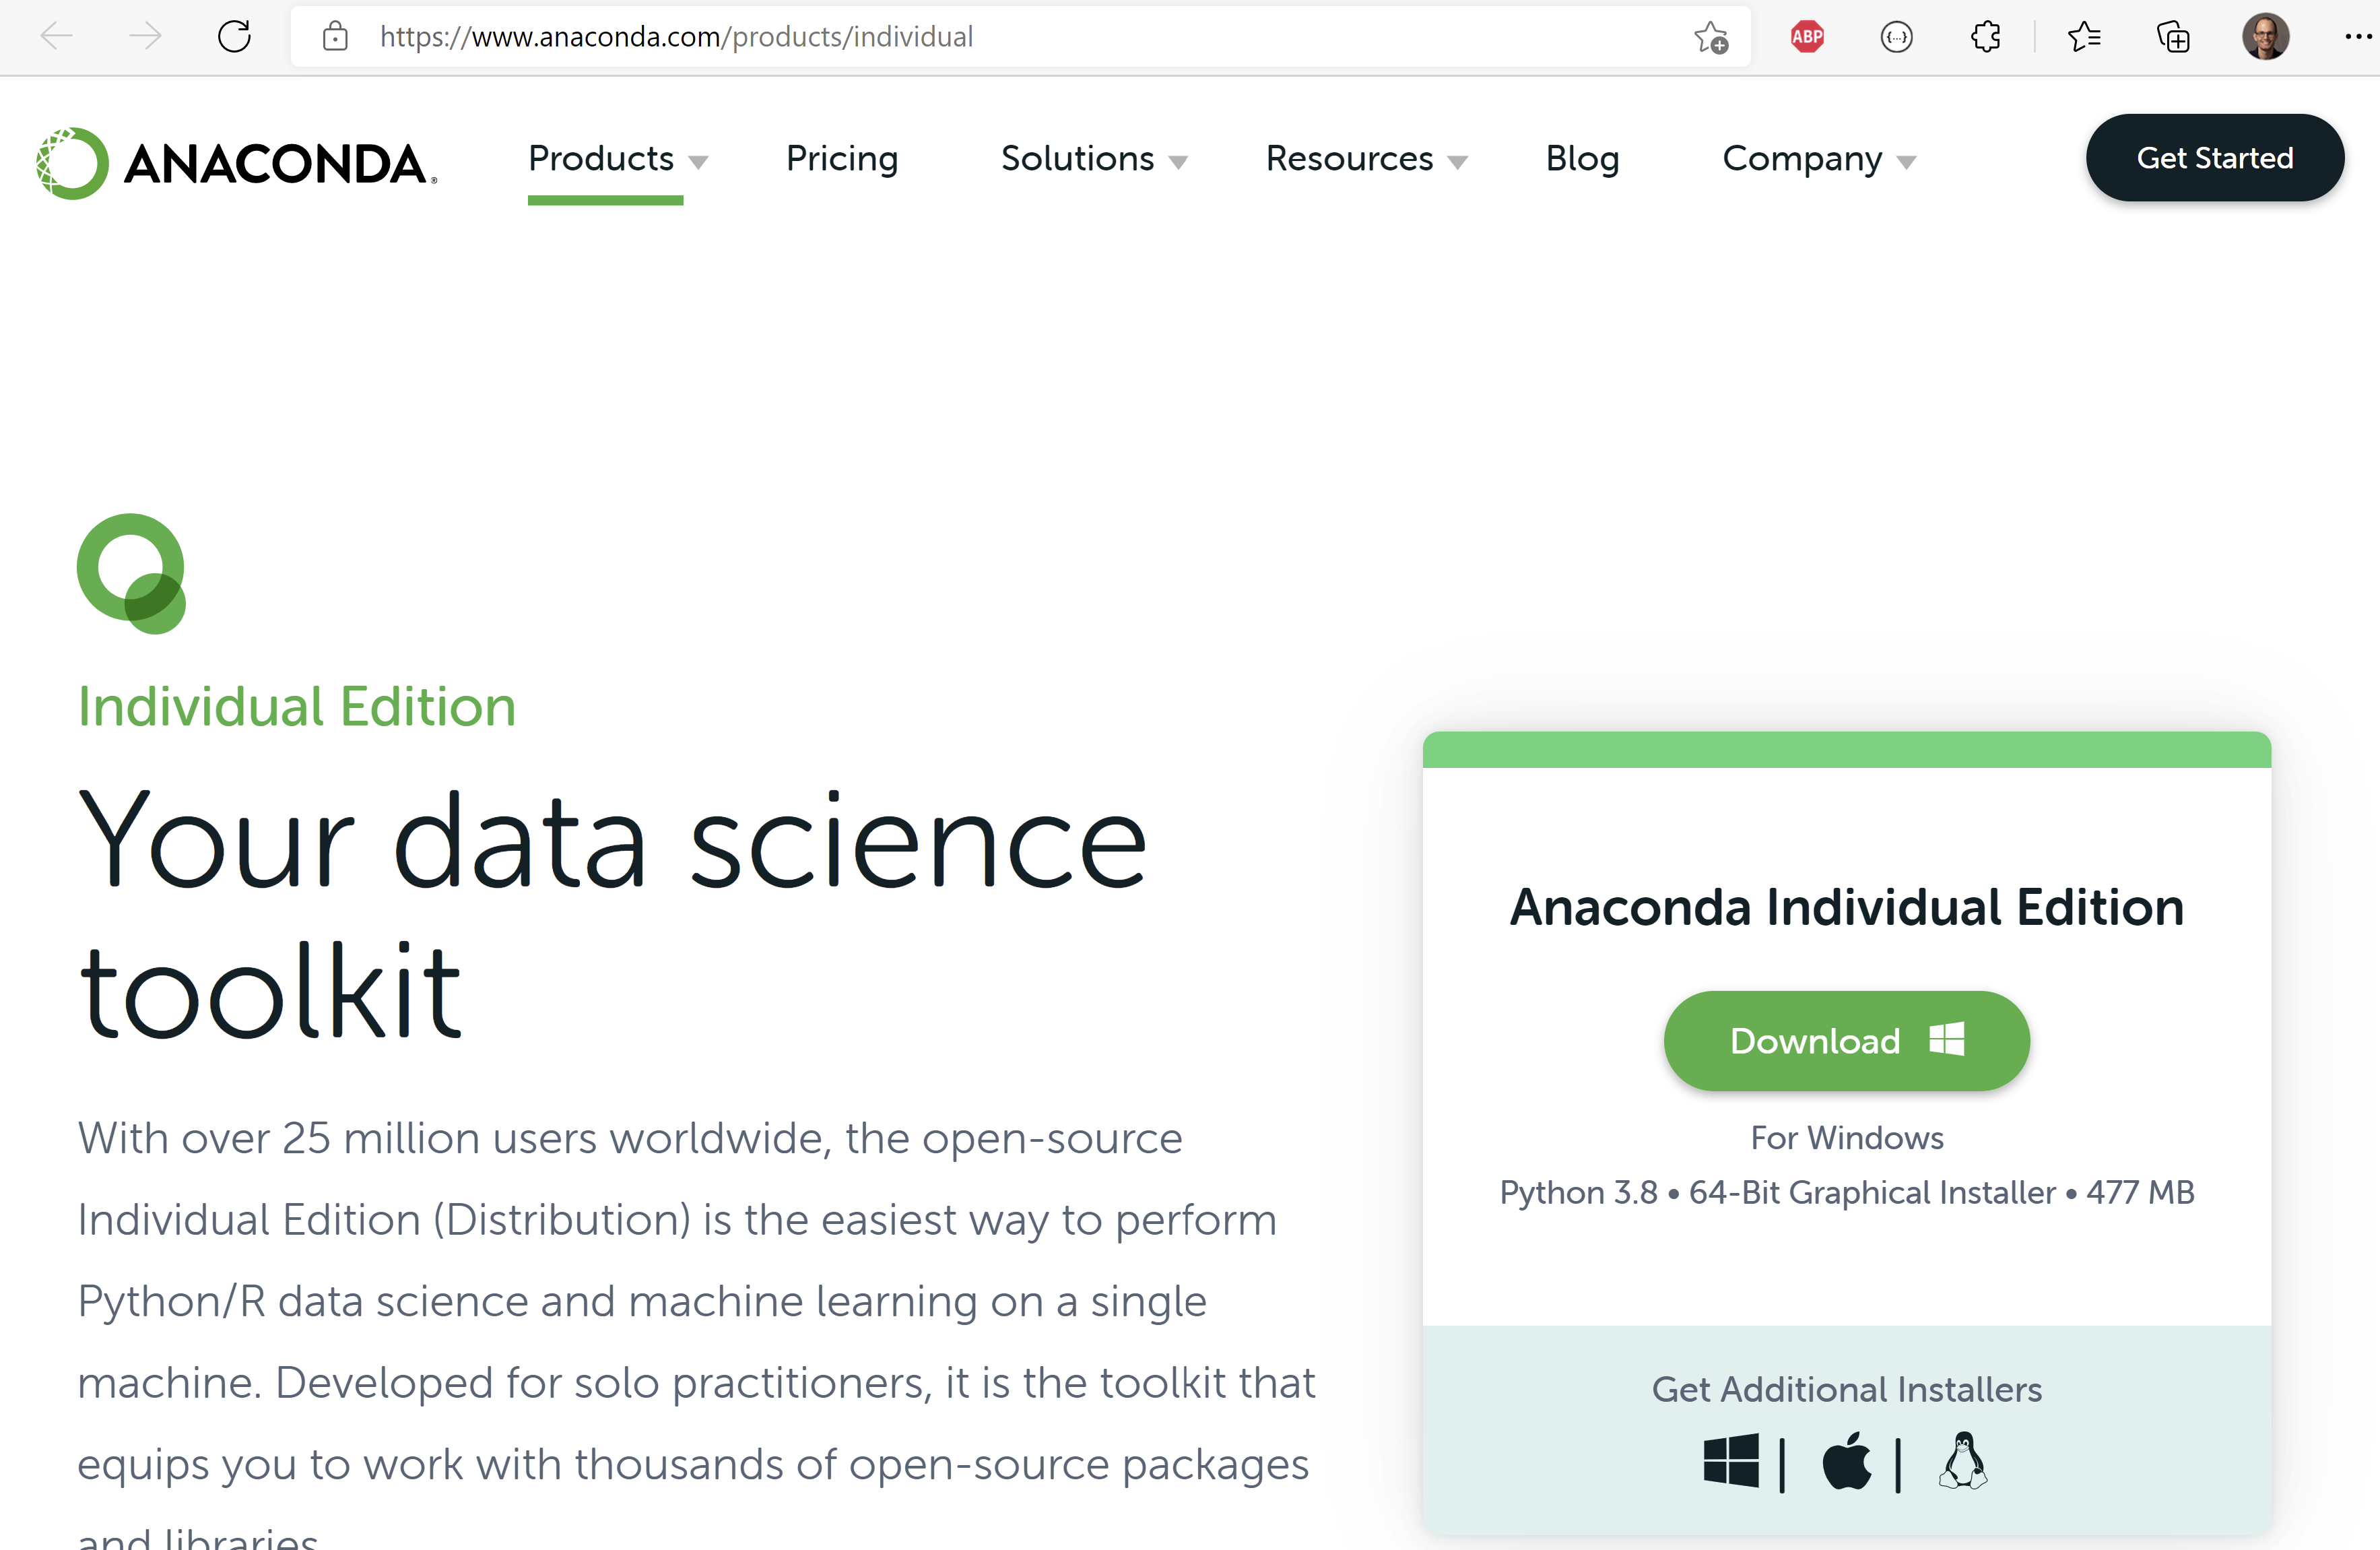

In [34]:
#@title Download Anaconda
base64_data = "iVBORw0KGgoAAAANSUhEUgAADc4AAAj9CAYAAAAMikunAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAALEoAACxKAXd6dE0AAP+lSURBVHhe7J0HgNzU1YXP9Nnubd517w33btwBm45NKKYHkkAgxCSE0BJK4McmgAOEXgyhmWK6bcDggnvvvdd12d7L9PnffZJmtOMts83ete9nhJ400tOT9Ea6o71Hx1BWVuYHwzAMwzQh/P6qb13Vfa6nJssyDMMwDMMwDMMwDMMwDMMwDMMwDMMwDMOcCxgMBrVUPdUtW5O6GIZhGIZhGIZhGKY+YeEcwzAM06SoTOhWlQCOxXEMwzAMwzAMwzAMwzAMwzAMwzAMwzAMwzD1Q1VCuMo+Y/EcwzAMwzAMwzAMcyZg4RzDMAzTJKipYI6FdAzDMAzDMAzDMAzDMAzDMAzDMAzDMAzDMHWnPoVyLKBjGIZhGIZhGIZhTicsnGMYhmEaPeGK4yparjqRHIvoGIZhGIZhGIZhGIZhGIZhGIZhGIZhGIZhylOdwK2iz0PnsXiOYRiGYRiGYRiGOdOwcI5hGIZp1IQjhqtumghXIBfucgzDMAzDMAzDMAzDMAzDMAzDMAzDMAzDMGcL4YrZaiOYC2cdhmEYhmEYhmEYhmkIWDjHMAzDNFrCEcDppysra1Q0j2EYhmEYhmEYhmEYhmEYhmEYhmEYhmEYhqme6gRwlZWJ6tZlGIZhGIZhGIZhmIaAhXMMwzBMo6U2Irmq1iFCpxmGYRiGYRiGYRiGYRiGYRiGYRiGYRiGYZiqqU4Ip58Op0yETjMMwzAMwzAMwzBMfcPCOYZhGKZRUpXgraJyZZ8TodNERfMYhmEYhmEYhmEYhmEYhmEYhmEYhmEYhmGYIBWJ26oSwGnliuYRVa3LMAzDMAzDMAzDMPUNC+cYhmGYRkdVwreKyuHOC6Wy+QzDMAzDMAzDMAzDMAzDMAzDMAzDMAzDMOc6lYnaKhLChTuP0JeJ0GmGYRiGYRiGYRiGqS9YOMcwDMM0OkIFbVWJ4Soa0wNVs9kMq9UKo9EoB4ZhGIZhGIZhGIZhGIZhGIZhGIZhGIZhGKbu+Hw+eL1euN1ueDyeQK4GUdmYqGgeETrNMAzDMAzDMAzDMPUFC+cYhmGYRoUmgNPQT+vFcRWN6UGqzWaTgjmGYRiGYRiGYRiGYRiGYRiGYRiGYRiGYRim4XG5XHA6neXyN6oaE/oyETrNMAzDMAzDMAzDMPUBC+cYhmGYRoX2EJWoqFzZ2GQyISoqSpYZhmEYhmEYhmEYhmEYhmEYhmEYhmEYhmGY00tJSYl0oiMqE83pBXKVlRmGYRiGYRiGYRimvjCqY4ZhGIY54+iFcnqqE82RyxyL5hiGYRiGYRiGYRiGYRiGYRiGYRiGYRiGYc4clLtBORxEdbkeoVQ2n2EYhmEYhmEYhmHqAgvnGIZhmEZJdQ9KtbHFYgk8dGUYhmEYhmEYhmEYhmEYhmEYhmEYhmEYhmHOHJTDQbkcRGiORyiVzWcYhmEYhmEYhmGY+oKFcwzDMEyjpqKHqFrZZDIhIiJClhmGYRiGYRiGYRiGYRiGYRiGYRiGYRiGYZgzD+VyUE4HUVG+h34ewzAMwzAMwzAMwzQkLJxjGIZhGgXhPBQNfZjKTnMMwzAMwzAMwzAMwzAMwzAMwzAMwzAMwzCND8rpCM3zqI5wlmEYhmEYhmEYhmGYmsDCOYZhGKbREfogtKIHqUajEWazWZYZhmEYhmEYhmEYhmEYhmEYhmEYhmEYhmGYxgPldFBuB1FR3odG6DTDMAzDMAzDMAzD1CcsnGMYhmEaLZU9OKUyi+YYhmEYhmEYhmEYhmEYhmEYhmEYhmEYhmEaL5TbUVXuB8MwDMMwDMMwDMM0NIaysjL+BcowDMOcUUIfhmrT+nFoOSoqisVzDMMwDMMwDMMwDMMwDMMwDMMwDMMwDMMwjRSPx4OSkhIYDAY5EKFl/VgjdJphGIZhGIZhmIZBn5+tOUbr8Xm8cDjL4HCUwlHmRFlZKcpKxSDGJcXFoizifbGcLSIK0TExiIiMVIaISNjtdthtEbDZbTBVkPPt8/nK/T5gmIaChXMMwzDMGUcLuojQsj4g05fj4uJkmWEYhmEYhmEYhmEYhmEYhmEYhmEYhmEYhmmcFBQUlBPIVVQmKiszDMMwDMMwDFP/aDnZ+tjbL/6JD+ByulBUVIj8vDwU5ouhsBAlJcVwlpWitKxMfO6E2+2G00Fjl6zDYrHAarWJwQqr3YaIiChEREYgKioasbGxiGnWDPHx8YiOjhHLWmEIEelV1B6GqS9YOMcwDMOccbRgh9CL47RxaJmGZiKAYhiGYRiGYRiGYRiGYRiGYRiGYRiGYRiGYRov+fn5MvlVG4jQsn5M6MsMwzAMwzAMwzQslJddUlKKosJ8FOXnIScnB8ePpcHtLENubi5ysrNRXFgIB4nm3G54vB7pFucXg8/nF/G7EsObjEYpiDObLbBYrYiMjERMbAwSk5KRkJgIi82GVi1bo1lCkhjiERMTB3tEBMf/TIPDwjmGYRjmjKMJ4witrB+Hlmlg4RzDMAzDMAzDMAzDMAzDMAzDMAzDMAzDMEzjhoVzDMMwDMMwDNN4oBxsfbztdrmQm5ONw4cOIO3IERw9fAjZWZlwlJZKcZyXRHKUx03r0Uhd1yf+icgdBjFSsrwBMpHT6ta2Q4NRfGA0GWEymRAZGY2k5ilo17ET2rZrh7btOyK2WTNYzBa5HhHaRoapKyycYxiGYc44FOBoaGX9WBv00yycYxiGYRiGYRiGYRiGYRiGYRiGYRiGYRiGadzohXOEVtZP68eEvswwDMMwDMMwTN2h3GstzqaMbK/Hg6yMdKQdPoz9e/cgPy8bhSJ2z8jIQElxsfzcYDJJsZvJbILRYJQDqAqqh/4TYzGXKlfEdSSmE/O0nG8S3iniOy98YiCHOpPZipjYaKS0aInY2DgkJCWjU5cuaNO2PeITEmGyWOQmCH2bGaYusHCOYRiGOeNoARKhlfVjbdBPs3COYRiGYRiGYRiGYRiGYRiGYRiGYRiGYRimccPCOYZhGIZhGIZpPJAgrqioCMeOHMbeXdtx8tgx7Nq5E6XFxdIVzmKzwmKxSsGcCMyl2C00j1sTz9E/zW7OQHZ0AvqcvOiMujjfYDDCZCRBndi+1wu32wWXyyU/j4mNw3m9eiG1ZUt07toDLVu3QVR0DExmc0BAxzB1hYVzDMMwzBlHC6YIfWAVWtbPY+EcwzAMwzAMwzAMwzAMwzAMwzAMwzAMwzBM44aEc4SSMBsc9PO0soa+zDAMwzAMwzBM7dFyr41GoxSr5WRmYPvWLdi8YR3STxxHWWkZxBJSBCfDcPE/WlaL1ckxjtanz0wms/hMFMQEzZOOcl7FVc4s5putVrlNj9crBXLadqluEtJRBrgcxPLiQ7meQW4LiIqORqs27dCnf3907dELicnJsFqs6rb59wFTN1g4xzAMw5xRKKDRCC1r01pZP8THx8vPGIZhGIZhGIZhGIZhGIZhGIZhGIZhGIZhmMZJXl6eTHQNHQh9maiszDAMwzAMwzBM3SgtKcXB/fuwffNGHE87jEMHD4p5xTCbLbDabFIUB5LQabnaqmCOnOek+5sIz91uDxyOMpSVlsJNjnF+RSDncDrh9RsQGRWFuNhYREdHyTpJJed2u+Fxe+X6RlEXCenoA3Kho5if1nfS+j4PYqJj0aFTJ7Rq2w69+w1A23YdYLPbZfsZpi6wcI5hGIY5o1BQpRFa1qa1sn5g4RzDMAzDMAzDMAzDMAzDMAzDMAzDMAzDMEzjhoVzDMMwDMMwDHPm8It/hfn5OLh3H7Zv2YwNa1chPz9XitysVptchsRrNJCojXK0CYrGFZGbAT6/T7rVlZUUo6ggH2VFRfB53bCYjdI1rqS0DKUuLwwWC6JjYpGQEI/4+ARERkZKQR7V6fN5lXpFnE9tMoDqVrZhNCvLOMvKpIguuXkyBgwagl4knmvfQdbJMHWBhXMMwzDMGUULsAitrB+HlrWBhXMMwzAMwzAMwzAMwzAMwzAMwzAMwzAMwzCNm4qEc0RoWT8m9OWzHp9X/OdTJ+oHo8lI/1OnmLMFLY9KQ5sO/b6cU98fhmEYhmHKQ3nWYkTxAJVys7OwddNGbNu0ATu3b5Nxp9VmpSXkMj6fH0YjjX1SxEYCOooxrBaLdJorKysTMX0uHIX5MPpcMIjPyZsuOtKKCKsVPrGNEocLxWUu5JeUIq+oDA6PD5FR0UhJTUHr1q0QEx0Nt1jP4/HQVmEQ2yPHOZ/Yjskk2inGNJ/aTrjcTpgtVvTtNxB9+g9Al+7nIT4hUX5WWfzDMFXBwjmGYRjmjKJ/oKOV9ePQsjawcI5hGIZhGIZhGIZhGIZhGIZhGIZhGIZhGKZxw8K5KlBzYsTOKuP6pqHrZxoULWeKqM33oa7rMwzDMAzTNPH7fDBI5zggM/0Edm3fik3r1uDg/n0oLS2FPSJCOs2RiI3EcoQWK/hU1zmr1QqX243CwkK4S4oRY/EhKdqKGJtF1i/WQEx0FCJtVlGPFznFpcjIyUdmXj7yRdnh8sLpFoPfgNj4BLRq3QrJSUmybofLKRppkGI92q6MWcTmxZT83Gw2w+l0oMzhQLO4eHTu0gX9Bw1Fxy5dkZTcXO6bIvKjNnOMw4QHC+cYhmGYM4r+IY1W1o9Dy9rAwjmGYRiGYRiGYRiGYRiGYRiGYRiGYRiGYZjGDQvnqsdbUgJfUYncZy1PprZodRhjomCKilLnMmcjlDAuXVvEObdYLOpchmEYhmEYSMe5vJxsbFq3FlvWr8HunTul+1x0TCzcbnfAXU5Di0EpAjeaTDRDusw5C/LQKs6OXu1T0KFVMqLtdjhIEOf1wma2iBjEBLfLi6y8AqRl5iC7oBhuEZ9YzGYUlTpw6GQW0vOLYY2ORbu27ZBE4jmTAV6vT2mDjF3FdvUiOoFJtMFoEnUU5su6+vQbgF59B6BH7z5ISEySyyh7ee78ZmDqBgvnGIZh6plly5Zhy5Yt2Lp1qxyorNGuXTs5EKNHj0afPn1w1VVXyelwmTJlCt544w3ceuutmDZtmjq36aJ/4KeV9WNtCJ0+V4Vze/bswb59++Q4LS1NzmvTpg26deuGLl26yDHDMAzDMAzDMAzDMAzDMAzDMAzDMAzDMExjIFQ4R1Q0rR8T+vJZB+XB+H2UlQyf04G8WXNR+NN8mMRsr9hvxcWj5pD7hknU7RXl2MvGodnEy2CKiIDf65WfiYOqLMg0WrQcKUL/HXA6nXA4HHC5XLLsFeeUHGBOnjyJCHGOW7RoIZ1hKMmcxna7HTabTTq2UFJ8ZfUyZxdHjhzB1KlTsXTpUlnWchVvu+02mWt4rqPl2hGUb8cwTMXQ9YPyoOlaol1PCMp3njBhgryeaHnQTCOE7vniXl8k4oT1a1Zh68Z12Lp5EywmM6wiPiCxmhYX6GMCmkef2UX84BFxRlZmBnwlhejeohlG9umKtqnx0uHNJOoxGIwwmEWZRGsUv3p9KBVxSm5BKbLyi5BPL4Xw+cXyJhSWlGHnoePYefQkyvwmtG/fHu3atpGSNxLYaS2gWFUra6I+2T7xn9PhlE54AwcPRZ8Bg9CzTz/ExMaKJakWbS2GqRoWztUD9IMkPz8fzZo1kz84GEaD+kZRURFiYmK4b5zlzJgxA5988okMEmsDBZOjRo2SASVdS6qCHnYQtBw9/Gjq6B/MaGX9WBtCp8814RzZI3/00UfYvHmzOqdi+vXrh9tvvx2RkZHqHIZhGIZhGIZhGIZhGIZhGIZhGIZhGIZhzjRz5szBjh07ZLlnz541ftFyU4WFcyFQDgwNRiN8xcXI+2k+yn5ZBGt6pthpo/iMRHPqvod7CJS0GoEoqHW4UpMRefEFaHb5eBhjYpRtEmfrcW3iaLlRof2+WPSRjIwM7Nq1C4cOHUJubq4UzFEeEeWs0kB5iZRHRblCUVFRMqesdevW8gXcHTt2lNPkSHfWfqcYyeuvv46HHnpInToVesn/u+++e06LXVg4Vz3UhyheIShOORuMHZjwoPOuCeXIMKQq4uLiMH369HMmlm0qUCyh3etdDid2bNuMeXN/wLEjh+EocyBCxAkksCcRfmhMQMI3EsWRs5vX50N2djbyM0+iT9tkXDK4Jzq1ag6rzQK3+MxktsAs4gpaHj4Rv3h8UtDvdDpQ5nCjqNSJAhGnlLqcMjR1uHw4mZOHjXsOYcuBNPitEejcqRPatG4lBf4O0VZyoKPAV9sHrX1++GC12OBxe1BaVozYmDi069gZY8ddiu7n9YTFqjruUhzFcQ5TDSycqyMkjDp8+LD8wtOPi65du6qfMAywd+9eaWdKNxoKtOmHKXN2QYI5coDT3qhQV+hBxWOPPYbJkyerc05FE84R4hqulpou2oMfQivrx9oQOn0uCefoR/tbb72FnJwcdU7VJCYm4k9/+hP/wGcYhmEYhmEYhmEYhmEYhmEYhmEYhmGYRsDs2bOxYsUKdUphxIgR8kXLZzssnNNB+S/qfnmKilC8ZAVyPpkJe2EJyswm6TTnF/9qu++UTyOOKoyiLpvLDWdMNBJunYTYC0bCROI5ZaFAG5jGCQnj0tPTceLECZkzRIK53bt3y2lym6OBnFgob4yEc9RfoqOjZU4ZlWncvHlzdOjQAT169JD5Q6mpqdKVLjk5WTrSMWcX1YnmNMgtat68eVL0ci7CwrmqoT5EfUkP5bGyeO7shMRxJJLTBHO1gfpGVbnOzJnAD6/Hiz07d2LtymVYu2oFSktLkJCYDLfbJfUuWpwp40a1THEFidhsIkY4fvIksk4cR7v4CEwY2Q9De3aWDnQunx+2CLsUslGsSY5yJJwjZ2OPiDsdZaUiRnHBLbZf5hZDmQPFFKuUiNhFzDuenYN1Ow9g5+ETsEbHYkC/PmiRkiKXV/LCfYpDsh4DbQPS5c5sNSM3OxsxMXEYPmos+g8dhvYdOkr9DsOEAwvn6gD96Dh+/Lg6BRbOMaegCec0WrVqVa2bGNM0IEtzcpirSDBHPzDpTQqa1TlNa+edlqeBrh+alXFFb2eg9R5//PEKLdJZOKcM54pwjt4QReJMvWju/PPPl4P2A55+1K9atUoOGiSeoz7EznMMwzAMwzAMwzAMwzAMwzAMwzAMwzAMc+Yg4dhzzz2nTpXn0UcfPevzH1g4p0K5L+QmZzTB53Qgb9Zc5H09C8aCIngpF4ZcO2iZ+oCOrc8Pkxj7YmMQf+1VaDbxcpgo58jnFZ8b5TLMmUfLg6L+TuOsrCxs374d69evx4YNG6RLZUFBAZKSktC2bVukpKTIa0ZsbCyMRqPMK6Ix5a6WlJRI0R25xGRmZsq6PB4PWrZsKQV0AwcOxJAhQ2Q9lE9ECfLEWfddO8egXMTu3burU0ruIuWMkcMcfUbCbcp11DiXhVAsnKuc0H6kh4S757JT4dkCnWPKWaZrAuUt072lKkaNGiWvI/SSB7quEFSH3pWQ4P7RONBiCY/bheysTMz/6SesX7MKZWWl4n5vkQZAYikpnNOjxAB+GUsYRYzqcjqxd98+2D2lmDRmIIb37Yro6EgROoo4xWQW8YZdLifjFnVdr9sNr8MJp8MBh1jf7fZIoVxZmQvFpSSccyC/1IGcwiKkZWRhw55DOJ5XLDUVPcV1JzkxCS6PGx6vR8YmtC8BKDymmFa0X9k/sS2xD3HN4jFw6DCMvnA8EpOS5efaMWCYymDhXC0JFc3RF659+/bS9pphNPSOhBosnmva0Hf/7rvvlsGjHnqgQD8qKUisaRBIdZIIj97WcfToUXWuQt++ffHOO+/IsQYL55ThXBHOkdPc5s2bZZnOPTnJdevWTU6HsmfPHrm81i9IXHfHHXfIMsMwDMMwDMMwDMMwDMMwDMMwDMMwDMMwp58vv/xSCmAIcoAiyEGKICHLpEmTZPlshYVzAsp7ocFohK+4GHk/zUfZL4tgOJmOUq8HPkoG1vLLKEVG23UlXaZ69MurZb+o0yjqjDSZ4W+RgsiLL0Czy8fDSM5z1BbibDrGTRByd6FEdSI3Nxf79+/HunXrsHHjRhw8eFA6w9lsNukORrmpnTp1kiK4hIQEKZyjXFUtp4rqIhEECefo5dzHjh2TA7nUkXtdseh39BLuXr16SfFcv3790Lp1a3afOwu46667MGPGDFkmccuaNWtkWQ+JXPT3GuoT56LrHAvnKkffj0gwRZDIiiDzh+nTp8sy03SgewIJ5DRXORK9VQVdP0goRwMZh1SFvr/Q8r/88ossM2cOGQ+IuK4gLwdrV6zAlg1rsX3rNkTHxoh7vU261VLYR/E1xQwElbV87MgIOxxOl+gnR1GUm43BnVvglvHno02LJJSIdSnmMFusMJosMBjNMqb104sYxLpetxPesjKxjaBwziUGh8ONopIy5BSVIKugBIWlpSgSy+1JS8f2wydQ5vKgW7fu6NWjO0xmkxTOiV8Hsm16tHYSFhG3uMU26GUB/QYOQt8BYug/CHHx8XKZs+r3A1PvsHCuFtAPCwocNehiQD9MFDUuw5SHxHMksqSxBlmhk+0507TYsmWLFM3RWIMEc/SGlttuu02dUzdIkEdvZNAL6Eho+fPPPwfEcyycO3eEcySEe+mll9Qp4IEHHqhUNKdRm3UYhmEYhmEYhmEYhmEYhmEYhmEYhmEYhql/Qt3m/vjHP8rxu+++K8fE2e46d84L5yjnRd0XT1ERipesQM4nM2EvLEGZ2Qify00Lyf8ktKhWrin6deUmDTBaLbB7vHDGRCPh1kmIvWAkTCSeI3RtY84cJ0+elGI5EqnQ2O12I0acIxK5DR48WOb9kFiOXOIob4zcWChXlcaa8I6c5fQDOdGRWI6EQlu3bsWmTZuwb98+mcNIAt6RI0fKF3J37NhRivDOmu/bOQi5hGmCGBJqVyZ4GTp0qOwLRFXLnc2wcK5iQt3mNBHUJZdcIscEu4o1HUgwN2XKFGnkURWU+6wJ5cgwpCZi2tA+w/2jceAV9/9dO7Zh7uzvcPxomhSymUSsQPd4TSxHBO/5lItN4aAinMvKzcWWrdvQKTEWN1w4GEPO64ioCCvKRFxit4n4w2oVcaUNRkskKdhERUb4PW74HMVwiZjD5SyD0+WScQiJ58hxrkDEu1ki/iXhXFGpA6Xi86z8Yuw4fAL7jmcgKbk5BvTphZSU5oDRIOpwyfZRfKO1WcY61GbRTir7xXyXaBPFL23bd8KFF1+GLt27idhIcdJlmMpQomYmbEgAxaI5piZofYTGGmSFrncsZBo/JGi79NJLy4nmHnvsMSlSqi/RHEEBKNVJdWuQIx1tm978wJxb7N27Vy0p7nHhCOBoGVpWQ18HwzAMwzAMwzAMwzAMwzAMwzAMwzAMwzCnj/nz56slxW2OHKNo0JznCP0yzFmGzEZWkn59TgcK5i5A9sdfwJBfKJ3m/G5VNNdg+OU2yrxeGAoKpWAv/8d50hVE+Vi0jdrInFYoQV1LBidnuXnz5uHrr7/GypUrYbFYMGjQINxyyy248cYbceGFF0oBHeUf0sv6SVBH4jlyitNEcwSJ6Cg/MTo6Wr6knZzp6FpDYqkrrrhC1nfNNddIodzhw4fx3XffBdwwKTeNaVyQ8IWE1iRMofNd1aB3kapKDEfiGA1yn6uoLhpom7Tt6typmLMHEllpkNucJqbSnOcI/TJM4+WTTz6R+aMVieZIGEfXiGnTpkmhG+Upk5Mg5T/X1IGSRHL66w3nNp85KKbQyMrIwP7dO3Hy+HFxH8mH1WaT71Hwaq7GAs24hMJPGpMejWIIEqIVFRbC5/GgbXIzdG2TArvVBDe5wNFCVJHRAlijYYxOgjm2OUzRCTBGxMBgtovBLMVtRqMYTEYZo0itm7JZsS2Ke/wwG4yIstvQLCpCxC02FIhtpmdkiu27YBLrVRaV0uY1ASCNI0TMk5ebg7S0Izh86IB07tXQHxOG0cPCuRpAQif9jwR6gweL5phwoD4SKp6jvsTiuaYBBZM33HBD4PtPb1pYvXq1dJprKKhu2gZti6Bt0xs8qC3MuQP9ONHQi+GqQ7+svo5zhf3zpkh3SBruf+JH5HIczDAMc87gxwY80jJKPiSh4X8rPeonDMPUFVfWMvz70UfwyCOP4NFHpmF9uvIHXYapC37sxtv/eFT2Kxpmbws+tD+XWDPj8cAxePYD5W2vZwuHlrwS2Ld/TVuAfP59xjAMwzAMwzAMwzDMOQQ5rZEoRWP8+PFqqXyZlqFlmbMMmZQsBqMJvuJi5M2ai7JfFiGiuBRe+OEzm4KJvTSSGcFqubZUUA9tg7ZF24woKUXZ/MUomD0XvqIi2TZ1IWXMNDhKkrripHLs2DHMnTtXOlDu2LFDCt0oP+zaa6+V14gBAwYgJSVFiuQ05Pn0+QJjSoanQZtHgwblLJKQrnPnzhg+fLgUOVx33XUYO3asdIP5/vvvpYCOXiRfWFiorsWcaUiwRsIXyhOsT/FauMIY2iZtm0SXJOBjzm7ofM+YMUOdUvJWNfRlWob7Q+OGHCVJ9Ko/TyR+JBOPNWvWSNMgEkxPnjy5Xtzh9GJcFs6dOSimIOi+fnD/Phw7chiOsjKYRQxAn4nIQH4eCs33+ZSYxGI2o7S0DMVFxYiPikCblETEx0TIZbwiriAnNwPVZ7HCFBENU1ScHBvNFjHfTMo7+ElLI+qi9wJQveQK56VBCuaMMPiN8FGcIpprMRsRE2FDbGSEaLcbObm5KBExqt8rtqW6y2nxkrYPWowj/hNTFMIqMWxpcRFOHj+KtMOHZV0BaEGGCYGFc2FAPyzoLRt60Ry9lYPe/MOiOSZcqK/Qj1vqOxrUp6hv6dXcTOOCHgw8/PDD6hTQp08fGUT27dtXndNw0DZoW7RNDQpsmXMHekCmURN7eP2y+joYhmEYhmEYhjm7yNs7G889TsKzx/DWNzvhVOefjRxZ+z889egjePSx/8NXK9PVuQ3PuXSMGYZhGIZhGIZhGIZhmPqlIrc5jVDXuWXLlqkl5qyAknUNBsBohKeoCIWLlyP/m9kwnEhHmXTTMMBA+WKU00uDJnSrjxzfCuqkbdE2adsQbcj7Zg4KFi2Hl8Rz1E4aOMH4tCATwMWxpnyeBQsW4Oeff8ahQ4ekQO7qq6+WwrbBgwdLdzlygKFlNXEclbU6tDEJ8BRXF2UeoSWXk5hOc2Yhk4guXbpg3LhxuPnmm6VAj9YjscMvv/yCbdu2sXiukUDOXo1BoERtePDBB9Up5mylIrc5jVDXuddee00tMY0N+r5efPHF6pTiPkmucuRoSgJIfQ5yfaHvK3PmzFFLzOlEiwtonJudLcVj+/btl+GfPSICbrdbfCYXESgFLWaQcYOcJWIJUS4tK4PL6UJqQixSEppBur/5ffCLz4wiHpHCOZ2TnM/jgs/tEGM3fKIeP8Tyap2klfN6Sdwv4hDRAJot4xWDWNdI2wZsFjNiIqwwiXJRaSkKiople0k4R21T1lOFc6KsDbQBim3cLjdsdrsoe7Fv724cO3oYBfn5chm5bwxTASycqwZNNFdSUqLOUURzrVq1UqcYpmZQ39GL56hvsXiucULCRnKs0kSzFDzSgwL9+WtoaFu0zYYIXJnGT5kIRjXoAVa46JfV18EwTQU/0vHFC/9QnSmexC+7an6PzN/6sbr+I3jq5SUoVeczDMMw5wbOk3MxRXVHe+zJz3FMeQbIME2SymIjP/bjmw9WIs9NHdyDw2u/wJJ9Z+ezBVfeMsz8dg/K6EG7pwQbZn2JHQUN/8U+l44xwzAMwzAMwzAMwzAMU7/Q3+orc5vTCHWd47/vnyVQUq901wB8TgcK5i5A9sdfwJBfiFKvB343uWE0/PPNU/HLbZd5vTAUFCLnk5nI/3EevFq/ozbLhGSmoaBEbyItLU2K5n788Ucpdrjiiivw+9//HiNHjkT79u0RFRUlRXMEJX/LZHMx1BR9cjy99J+GpKQk9OzZE1deeSVuueUWtGjRAmvXrsUPP/wg3YpKSzm74kyjF1KTUxTdG8IdqoLEMxWtEzrQNjVY1H12Q9efytzmNPTzXn/99UYh6mROZfbs2YFzQ6I5cparD1e5qqCcZs3JkrZN9xDm9KIIySAd5o4cOoi8vBwUynx3P0yq+J7QC8m0eRKdvoxEcwYRC7Zo1gyJsZFUhVhWLGAgBzgxiPX8Iob0uZ3wlhbAV1oEn8sBPwnnSP+gbYuEcSSiE/8n8ZucZ/CLuMYoxXJmo+K4TGK9KJsNVjHPKbZdXKwI50LjHf0+6PeDYiqLxSYWMCA3Kxv5udk4eSwNTodyL9TtJcMEYOFcFdAXkARNDodDnQMkJyezaI6pM9SHEhMT1Slx0xJ9jMVzjQ8SzZHjHEEB3ukWzWlo4rlw7dIZhmGaOo5Dq7AjR3lgbInqj/7da+rwW4z1K3arZaD3iKEIX3rKMAzDnA3sXrkBReqTsNQBw9CaXyjFNGHqHhsxDMMwDMMwDMMwDMMwDHO6Wb58uVo61W1Og+aRaIWg3CH9OkwTx2iCr7gYebPmouyXRYgoLgVlhfllEjMtQH+4UBOAxaBPYvbrU33lYsoypw7KIgrKOuXWFRhIOCUTkGlh2o7SBmpLREkpyuYvRsHsufCR85xoM9MwaOeXksGdTid27twphWoZGRno0aMHrr32WukEl5qaKpeh5fUuc6HJ4oQ2L3TQPtOjOc9pwr2IiAj06tULv/nNb3DppZfCZrNh7ty5WLx4sWyTvj8yp58jR46opYqFTA2Nfpv6tjBnH3oHuVC3OQ296xyJo9h1rnGid3w7ndcNEulpkIMpc3rR7vfFIo47tH8fCvJyRByhCO6VW3kwBlQGJSaheMAvBi12IIGbx+uBxWRAcrMoRNqscNHLHuhzErpBLO8XcQSJ5BxlYiiB1ynGLnKdc0vBHTVFxp2iQPGo36eI40i0T+2xmE2wWCzSyY627xWDxWyE1WSW0ySeI4c6WpZaqsUiso1+UaeoT4mJaE+0/TKK8NUk46X8vDwcOXxICvAYpjJYOFcJ9DDiwIED5URzJHYiC2yGqQ/oh65ehEl9bd++feX6HHPmoACf3sKgcaZEcxosnmOYxoYb6Yc24Pu3p+Lp/wXfElg9bhQc24u5n03DU//+Ebn8rLFCdm3YAZdabtVnEJorv9vCxlO8HRuPKGJ0Azqjb1+bLDMMwzDnBuQQtWm78jDMgGboO6hh36TGNH187jwc2LIE773yNH7e1vheaFNZbERxzrW/G454C80wo9vw32FMl7MzscEaPwo3XNMNEfQg3ByFodfehJ5xNQwSa8G5dIwZhmEYhmEYhmEYhmGY+oMce/QiuIrc5jTIYUqD1qF1mSaOwQBPUREKFy9H/jezYTiRjjITOW8IPG74fV45iP/BJ13efDCIfxpKWaYci48osVlZ/tSBatSSDpT1Q9f1eT1yEBOB9eBxyc+pTRBty/tmDgoWLYeXxHOUjcw0KHv37sXq1auxa9cu6f52ySWXYNCgQYiPj1eSzf3i7MjEcCXxPXSeNlSG9pm2Ho21erTPKMHcbreja9eu8vo0ZMgQKYiha9C6deuQk5Mjl2MY5uyFvvPkIKdRldjqtttuU0vsOtdY0QvnyAnudKEXW7Jw7vSj3NuBvNwcHEs7jMz0dFhtVnH/V+71MiakiQqguVpc4HIrrnF2ixlx0ZEwm01inogfDYrjrSKaI9dkEso54ZWCOaXs94jBJz4T9RiNJrEKtYliW58UKUkZnPhQxrQy9iWRng8eikvF5yZRPy3n9XilmI7apMU9Mo6Rsa2YJ/+JesgFT2JQ9xGwWq3ISD+J42lHUZCXJ+dp+8Ywelg4VwEkXAp1/yKB05kUzTBnJ9Sn9OI56nOhLofMmeHZZ59VS8ALL7yAvn37qlP1z5QpU+QbxOhtPlUNw4YN4x8dZymrVq3CM888I10O9YOe0M+qG/To599///148cUX5TaZ2rPsnQfwr+fexdxNR1FWSiF5eOyf9zwefuZFfL9kP/JL1ZlMOXzubVi5QRM7pGDEBa1luSYcWLICOeppad5/BDrb+IcQwzDMuUTB1pXYpd6f7anDMag1P/pgKseP3Xj3yefx7mc/Yd+J0oBArbFQXWwU33UCHp3yHJ5/fip+P7EDzubXBbQb8ns89dzzeG7qk/jNkGR1bsNzLh1jhmEYhmEYhmEYhmEYpn4g8YmW+0O5QRW5zWmQYEbLSaN12HWu6eMV5zH/p/nI/vgLGPILUUqOHW63/MxgMNL/AoOWDHwq6ie6ZeXyIQMMJjGodUro7yNVryuXF0v4PV44KCG5sAg5n8xE3g/z4GXhZoMgj7vg5MmT+PXXX2XOTkJCAgYOHIgBAwbIvDGz2RwQuBHauCGg7RBRUVFSPDd8+HB5LTp+/Dh+/vlnbN26lR1bGOYsh4wltFzUytzmNEg417ZtW1mmddh1rvGhnZ/TDfUNeukDDV9++aU6lzmdOEXcmZ2VgazMTBQWFsJsscoYwkcvS6gGLR6g3yB+jwdRdisiIyNEeGmEm+JX+XIHv3zxgkfEsjR4ab7PR0o3KZzzuMrEQOI5coszyXjGLNY3ijBGvsRB1Ov1+OAWY5fbBZfLJcokklNyeqgJFPK4PaJ+r1uVx1VAaFhkoOW8crZF7HNBfgEyMtKRm5MDl9MpF2GYUJQezwSgi4ZeNEcWkfTwgkVzTENBfat9+/ayrxGaeK6kpEROM6efTz75BPn5+bJMAeV9990nyw3F1KlTA9urCew+1/QpLS2VgrkPP/wQx44dU+c2LPQjhd5eRdskAR21gWEaExnrliJN/WEU3XkMzquhkwi5DK1anyXL5DI0aGR3WWYYhmHOFYqxeslutQz0GTMUkWqZYZoidY2NGIZhGIZhGIZhGIZhGIY5vdTEbU5Dvwy7zjVR1ORkb0kp8mfPhWvBEtiLSuAT8/xms3TMoL9m+40mmKyRYoiA+B/8BnKiU/4pordg2U+iOLGM0WJXBrMdkINNDFaZZez3OOB3i4Fc5eRayjNkua5YTlvXYLLBYIkQg1jfZBFLiHXFel4fJUB7ESHa7Vq4FAWzfxb7oOashZFwzVSP5vRCuYA7d+6UjjyZmZlSqHbhhReiTZs2Mm/QR8nl6kDQeaGBpikBngatruoIuLSo6+jr0qD5NB0dHY1+/frh6quvRmJiIrZt24bNmzcjPT1drsMwzNlHqNuc3lGuMvSOdOw61/ho166dWoIUPzPnDvRdJLGY01Em4jqvjCk0QZzBQLFAMMZU5gXzDbQ4we12i/WMiI6IgNkk4lYRJ5KwjcRufo8bRrGMxWyCzW6HLTIG9qgYmMTYYIkUsYKIJ8RyBoNZjTtF/ElxC8itzgSLxQK71YZIsa5V1E2iOXKzI3c5n9iGfKmEwCu2Q3EHranFPbJ9sqGQdSr1lt8vRaxngcvlRpmItYoKC1BayvoLpmJYOKeDhCtpaWmBgJ8uHiRoIltqhmlI6O0tFYnnaiOmYuoOCdk0pk2bppYajsmTJ9dKBEfrMU0bEq6dLsFcRZCA7q233lKnGObM40c6lizXvhM2DB7ZD2Z1KlzYZYhhGObcxnlyGdYfV37Tm239MKQ//55nmi71ERsxDMMwDMMwDMMwDMMwDNPw5OXl4eDBg1L09tVXX5VzmyNxTHWEus5RHVQX1Ul1M40fv/oCNH9xCQp/nA/ziQyUmU3wk92G2wW/3wBjXBLs3XsjcthwRAwVw4DBsLbrBAMJ6Mi9A5QcLAYSNxmMMDVLhK1HL7H8CGWdIeer5RGIGDwMtl4DYGnXHYbYJFGH2Bb9I7EbifMSmot1aVvqukPPV7YphkhRj623sq4pJgl+ixWlJgPMJzNQ8NN8sQ/KC5i1fWLqhpagTm5zW7ZsQUZGBmJjYzFixAj07dtX5qbqhW4EJbxLxxbVhU5D+7w6tGRzrUw5iVQXjWla2562zdTU1IDrHF2DSDy3b98+FvEyzFnEkSNHsGzZMil6u+uuuwLCNzKWCEc4x65zjRu9cI4E2sy5Ad3H83JyUJCXI3UHFDPQPL1QnlDu+co4gDJDneeXMYLRZIRH1EMOcQa/iD9ELOjzeEWcKpYR8SosNhE3iJhTzDcaRVwhYkijySLnmUwibrHapeOdX6zr9hrg8hngFjGthz63RMBqi5Axro+c7KT4jeIUpc0utxtuN7ncKbGLIpKjWIaWowhZ+SdbS/8TJdpNn5ig5akuj8eNkuJCFLKwl6kEgwhuZfc51yGBEllNa5DClW7yLJpjTif0w1PveEi0atWKHQ9PI7Nnz8YNN9wgy3369MGaNWtkmWk49MGYVtaPtSF0Oj4+Xs5rqqxcuRIfffSRLEdERGDSpEnyDU6RkQ3viULbJmts7QHX7bffLh+AnS3snzcF075Jk+WI5hPw5P9dgYTwnh2GzbJ37sOMjS5Zju99F56bXP0fO4jT0bamTOm+7/Dv91aDjqy12TDc/+hvkFij41OMn197FouOKffRoTc8jWsGcCzHMOcSfmzAoy1H44WTyh/03l/hxu+Hs8zkXGLj11Mwc12RLLc/fzL+dHUbWWbqjitrGV588Qfki9DcgCRc97e/Y1Bq0xeo+7Eb7/zjQxxSEwBG3PosJvRWXmpzpql7bNT4aczH/3SyZsbj+HabW5bjut+Cf/6ujyyfDRxa8gre/umELNuTxuNvD45DM/4NxDAMwzAMwzAMwzBME4QEbDScOHFC5vccOHBA/s2dxDCV8dvf/hY9e/ZUp6pmx44d+Pjjj9WpU2nRooXMLejUqZPMZ2vZsqXMm2gKuRN03JSEVmUgKprWjwl9ubHjc7thtFjgTs9E2t8fR3RBEQrgg9/jA9yl8NtiED1iNBKvugiRnRThgaekDAWrNiBnxpfwZKfBYI2mxBixjhNGexQi+g5E/MRLENu7m1haSVw2kIhKJjG74XO44MzKQ9HqDSheuQaezBPwO4pgjIpH5OChSJhwMaK7dSy/LtXv9sBT5oQ7Jw8lm3eIddfBc/IoYj0eFMc3Q5sXn4EltXlgn5i6Q3lOixYtwgcffCC/D5STRtcHyhOi5HYt0Z2gae3l+w2BdHNRv3u0TU2YR/mzc+fOxRdffCHd5q655hpcd911MneROb3QtV7jTIkXG0MbGgIyVtEgt8ezDRLHHT16VIp0SdxGAir6blflQEY5hFdddZU6VTWffPIJ/vjHP6pTtYcMI06HocW5hP7c0Pmk81pbZsyYIfsODdSn6gu695FgnNoXbp9jqsbpcGLLpvVYvXQRdu/aCY+I5SIiIuVYiS+UWFoNMSTa/Z9mkqieJHYlxcUoyM1BjMWAQd3a47w2zZEUa0dcpF06zzm8RhhsEfAbLVI0ZxGhQ1RkBGwRdvi8YltiexRPGExmuEqLkZeVjYycfGQVliFftLFEDPAbpINdbn4u8gsLUFgqPit14nhOIXKLShAVFY3e5/VAx/bt4fX7FCEgierEP7Gy0naYFKEcTRsoj9wgtmuCWcRNJSVF8jdSv4GDMWDI+eh+Xi9YrBzHMuVp+hlO9QAJ5vSiOfriaA8ZGOZ0Qn2uS5cu5foe9c2srCx1imlo3njjDbUE3HrrrWqJYeqfhQsXqiXgjjvukMK10yGaI2hbJNTTICEdwzQGtq3ZIBPDifZDhtU4MdyVtQmbVJchI7pjYD+O5RiGYc4lSICzdkOxLJOwa/Aw/kMe07Spa2zEMAzDMAzDMAzDMAzDMEztIWEcJR2/8847eOSRR/Dcc8/J8pw5czB//nzpBleVaG7gwIFhi+YIWpbWqQzaFm2Ttk1toLZQm6htVKa2UpuZM4OS1CswiP9IbGYwiqLiikEJxUZbBCJ7dEJM726wJsbLIbJtS0T16AxTbJxY3kSrgrSCyloGGKOiYG+dKpZtJpe3pyTBlpwAW0oiIlqlIqpTW8QP64vkieMRe+FoUU88/H6vrMQUHQ27WOaUdZsnivkpiO7cFs2G9kXiFRci7vKLYG7eEiA3MquZNi0J7BNTKzQhHFFYWIhjx47J73BCQgKGDRuG1q1bq58qUII7JbOTaK6kpES+7H3BggU4dOiQrIuGUAeZytCWpTGJnqguylOiuqSjjCrU0wv2KGepV69eUthQWloqxRLZ2dkBAwBtOYZhGg8kbCKx1CWXXCLFjt27d8fFF1+Mhx56CFOmTJGfVyWao/zYmgiYyHWOrhF1hcwtmPpl9OjRaqn2jnMktqS+RI6EJMSrT9EcQX2R6qW8VdpOfdd/LuJxu1AkYoy83DwK3KQQTrtvawI5ZVCm9YP4n/zMIAYzid7EOrSu1+NBpM2CSLsd2cVu7D5ZhF0n8rHjyEms37EXS9ZuwqLVm7Bq4zbs3X8QhXm5cDlK4SwtRkleDjIzMrHvWAY2HDiONXsOY9P+I9iTdgIHTqTjcEY2MoocKPGKrRlVV12xfa+IWWigd+36ZduUuEPGHn6KqGkGtVc0UoyVYJWWo2WUdU0mi/w8JzsLRUWFcLu0TAuGCXLOO86RKIkU9RokWGrfvn2DvrWDYaqDbj7kPEdvqNIg1zl+g0vDo39bCj10ZLe/hkcGNypaWT/WhtDppu44d/fdd6slyIfYpxt6yPW3v/1Nlqnf//e//5Xls4HKXd3cOL5lEWb9vAJ7jqbD4ZGLwBbbHO27jMY1k8agfTOrMjOE4q3v4e9vrFOnqseIXnjorclolbUQT/3rK+SGGW0Z0By3/+tpnN8y+G4DZ8aCQB2hn/vcGVj36/f4aeFuZBWUQvnZY0Z8Smv0Ov8SXHZRfyRa5c6HiRtHxTH6delabD9wEkVl6kESdcbGpqDzwPNx8UVj0CH51OPkdezDzDc/xpYMF5I6TMBdd4+okZOEz70Nbz75KdLELyADUnDzP/+GPnE1aTuw58cX8b+lmbKc0v92PHDjebLsRybentQX936VLqcnTlmG7x8bKctVseT1sRh73xJZHjt5Pn55bRwq7iEKXucK3NXqInyQ44QFo/DdgUUYlfMqOg59ADni/NlxJeYcn4VxuvNbEe6Chbi9w+X4PM8VqOeKjlXHpltmTEC/2+bIMrX159ea4cmuF+CFfYqA5IEZaXjxlvIP3k+lAJ/f1xc3v648mLjnvX146w+dZbkyyo5+hrFdb8Napw9x+DOWlLyGvpE1O29BnNi3ZR4WzJyLH1dtwqala3CCfhEL2nQdjRFjJ+KmO27EhPNbynlVseerW9F90qey3O+qT7Bw1q0Bd8fDa7/C5x9+ga/nzsbGwx75veo7+hJMvP0OTL7pAiRF1KT9TmTuWYNfFs/GTzM3YN2upTiQrvyxIrbtEIwcOwy33fgXXHlpJ0TX4rD4HBlYO+8XzPjuI2xavQsrdyt/fDWgLc4f0w8Dh07EdXdcjdE9EuT8qinA1iW/iGPxM77fuBo7lu6S/ZL2v/foHhja7zZR12UY279llf1cw5nxLa7sNAkLSryn9G1nxjp88cVHmPnFXMxdfVDOo3N46aW/xR8fuRmDWgbjrXDxFBzBj99Px6zvV2Lp6iXyONNxGD5mDMb9Nnjuauc4V399r7Y01XOdvnUOPnj7w8D3yd68Ky689FLcccfDuP6Cin67OHFw6Zd46YMPsWrxUvU7qJzHSXffg1tvHF4nJ9b8rR/j35/ukOWI1Mvx8N/GoKLXElTu7ORGbto2zJu9CHtOZKJUvQ1a7NFIbdMHo8dfgPPaxYq7YtVU7qDlxoktP+Grn9fhRK6y/ZjWE/DXySMQU+l+i3UOrsPq5Zuw/0gm8osd6v1eaVdickcMHjES/Xu1Q1QtX5ZVlrcLyxavxrYdh5FTpNVvRlxyKnoMvRQXD+si6w7Xca627lJ1caXyubOwZ+0aLF2/GemZRYFzR/sREd1MnL+uGH5B8Pzp+0A4VOUA5ncX48DWxeLatAdpun5jMNsRG5+EbgNGYtSgfmgeW7POHW5sFO5xq+r8UR9Y+vMibN5zHLlq/GcwR6F1h74Yd9Vl6J4SztWiPJ7ik1izaAE27DmC9KyiQL+KiE5C5z5jcMVl/REv4tSaOM5V5cqm/4xeoHDPv3+HdlWHXAH82I+Pnn4Pu0qVNrQ+/x7cd3UHWSZq3zeLcWjDYiwK6RvaNUV/bMNxnKutO19t1vO7y3Ds6CasW3HqtYf6RkqLThg69hIM6ZVU7TWRHecYhmEYhmEYhmEYhmmKVOf+Fgrlm5EjHAliKJeBRHDkCFcbyNGOtk+uVLm5uTJ3RZ8/VB2UQE8vjG9MnAuOc36PBwazGZ6MLBx96ElE5eSjEF74vT74XSUwt+iIlHt/j2bnDwBlBVPeiznSjtJDx3D81fdRtnWjmK+KorwuGGxRiBg4FEmTrkJcvx5ydtnRE3BmZtFDP1iaxcKamgxzdBRMVguKdh/AiZeni3pWwxgZj6jzRyLp+isQc15nsbwfZWkn4crOFbUYYI6LgiUhHuaYKJgj7HBk5iL9gy9hWLYSJZFGtJn2NCwpKYF9YurO7t278dVXX+G7776TL7v+05/+JK8TNpstIJhTnGGMMp+HBHMzZ86Ey+XC73//e1xxxRWyHrfbDUsYLoBUF+Uf0rIkfnv55ZexYcMGKdgjpzsS7WkCOlqWytQnaVkStEyfPh2pqam4+eabpQiHrnFa+5iGg0TRNJCwRON0uL1p7lJ6EYteeMOOc40T6iv6F+dXR1xcnBS9tWvXTg4TJkyolQiOxFUkrKI+QuXa8Nhjj+Hxxx9Xp5j6olu3btJxkPjll1/Kiemqg77/Q4cOrfU5rQ3UJ/fs2SPHTO3Iy83BisW/YvG8X1Ai4gejyRiIn33yb8PK34cp/tMIhtd0XzeJ5QCn0yl/c5jcTgzs2g4De3RAdFQEjmUXI7eoDF4RfxQWFSE9MxvZBcWwmMxIiItGuxYJaJ+ahNiYSPhE3FFcVIysgiIczSrAofRcZOQWitjFBZvZiAirWRH2Gczwi3b6/R7xG0dsV8SnuYUliI2LRZ+e56FD+3YihvGI9TwwGUxK07XdUKF9EGGLKNBLAGgBI7we5YUB8fHNMPLCizDk/BFoFh9OjhVzLnHORrL0w4CCIL1oLjY2lkVzTKOA+iD1ReqTGtRX9c6ITP2j/8E3atQoFs0xZzV6d7uz6QFHZXgKd+K9px7A/735DbYcDIrmCGdhJvZs+Br/fuSf+N+ipnKddWPPolfx4H1P4n/fbkR6QDRHeJCXcRjLvn8H/7zvIXy2PEOdXzUZO2biH5Pvw1RxjFZtT9OJ5ggPCguPY+Oir/HC4+/goJp0q2f91x9J0RyRfWg2Pp8VfNgUDhnrlsrEcCK68xicV0PRHCU8r1qvOLQa0AyDRnaXZYLEIsMnDFangC0zV1e4D3r8OIqNcxTxBbE7jHVKtq7F7FynLLfqPQE92hsR1WcIJiTY5DwHfsDaTfTHiKrJ27pAiuYIN5bh11WVv6mSIGHgytlBYef4S/vBht4YNjFZnQOsXbIZxVU3H17ndsz/XBEXEqtnra5W9Hl0zU9SNEf0vutSdKqR6EyjAPNfux2dW0Sia78JuPffb+HHxasDwiUibe9SfPHu3zFxeCsMnfA69tXi3R/ugm144foe6DB0Ev751rdSsEPQ8du89BM8/YeLxI/vS/DpxhI5v2qcWP/VwxjbKQYp3cfgt/e8iC8WLQ6I5ojCo2vx08ev4qbLO2PI2Puw/GDws+qgNv3w2o1oE9UC50+8HW98+GtASEVQ/1y5ZDZee+EPuOS827HgRFV1a21NRt+xN+CBlz/A0iWKkIqgbW1dugTTX70TlwxohX5j7sPcnYrorOYUYNn0m9Cx5VDccf8bAdEcQeeQtjGkVXvc9dL6gINS9Sh1tkvogKvvmIoPvl8UOM50HFYsUc5d+/Zj8L+VOXJ++JyevlcVTfVcU7s+mjwGLfpOKPd9cmTulf1+0oWtMea3XyNDd7jcBctx37iu6DTmt3I/g99B5Tz+9eYR6Dfsrhp9V8pTjNVLdqtloM+YoRWK5irDU7wPn730f3j+9ZnYdDQocCHcjmKk7VuJT9+cimdf/h7pqrimJviRjYXT/41XPlsZEM0RbkeZ7h5enhNbvsVzjz+BV96ZhTU7jiJHJ1whqF3paVsx54s3MeWpafhpU7b6SXj43OmYN30qnnruQyxcvRuZAdEc4UFB1jGs/uE9UffLWHdcub81NnzuPKz6+mU8/vh/8OHsZTh4Qi+aIzwoK87GoV0r8dmb72Cz7jpdd9w4sPJ9PP3EM5j+5TLsCek3fo9DHsO1v3yBN95ZKAVrNaGusVF4FGPj9//FM6IP/Lr5SEA0R/g9JbLff/DSE3h95k5xhQkXpc4nn/kvZi/fjuMB0RxB5yMd21bOxHPiuM3ZGHwmV1d6Dx0YEAP7sBtbdlT2zTqVsn3bcED9XlMc2XdQO1muC9l7Z4vv7xS8XUHf0K4pdGxf/nQDanvXbRiU79Rjjz+F19+t+NpDfYOuPbM+mYap077GkVpcExmGYRiGYRiGYRiGYRo75OoWCglHOnToIF3hxo0bJ8UnJFJ7/vnn8fTTT+Oee+6RCezjx4+vtWiOoHWpDqqL6qS6aRu0LdombZvaQG2hNoVSUduZMwhl9ZpsMCUmwtYyBQaTGc6MHDFkyeReS1I8rK1bwRgRI5alJ3Ha8zaD+E8M5ABiNsnZBeu2IuPdT3Hytf8h/X9fIm/JGvjUfA9rs1gYE+LltjQMZmVdv9eL/DWbkP7OJzj5+gc4+er/kPnVj3CmK39XsMRGIarfeTAmp9KDd7Hl+nyWzlAyOjnNkdtbVFSU/I43b95ciuaCye2KeI3yd0i49sorr+Cnn35CRkZGYJm6QIK7TZs24f3338cbb7yBvXv3BkRwtG2CtkPiBRITURtp27QcifeYhoVcmMgpjK77etFcQ6NtV3OXotxJbWAaP+QoFwp9hynvlZzkSJxGbrQkoKJrS3p6OubNmyeFsSRaq61zHG2D6qX6qN7aDCyaaxhIDKlR0+8xxZl60Rz1H3Irrej81Xag+qheDdpeTcSfzKk4xHGVg/qSjaDAneJJGiiG0EuFtDhTgaZIbCcFbSIuzS0pxYGsXCzadRS/bDuMA5m5FETA6ChDXmYOjhzLxsnMfOQVFCIrMxu7DhzDij1HxHAUy3YexNzNu7Bw617sPJIplilBWYlYr7AY2XlFKC4qgdHthN3vhsfjRl6ZFwVOL7yifTabVbrcWXweGFwithVtMWj7Ur7JZOqsjMvFR34RRykfOERbnWJwuRpnjgtzZtF/G84ZNDcvssDWIIEMBf0smmMaC9QXqU/qxVsknqO+S32YqX/0b03p27evWmIYpqnjLduGV556FetOKg/zDOYIKUyOiQh9M1oR1nzxAmZuLFKngxjMsXIdbbDrVtXqKz/EiSDLcMpnUeU2SS5u+nVoiIMtjBe27Z/3El76YgdK1B8GBnOMXL+ifVryyf/hjZ+qFgQeXPYqpr76K3LdwV8awbZX/7YyEgNkZpV/eE5vDQwXP9KxZPkxdcqGwSP7VetcEUrB1pUBlxB76nAMal0+zO3U5zJ0Nys/mNK3LcHB9JBfVSE4ji7Hd0uD+5CV9SU2bq76DwSb1swKCFT63jAMHY0GmGy9MP6mVGWmYO3moKijYpxY+csPalmhOtGbp2Abli1QBHnkBjWkP70txYaBF18t5xH7v9+MY/RHmSrIWTs/IPwjDsxZgn15Ve1zATYuXa6WgSFj+tXKVc2ZsRAv/OPTcqIzEjv2GT0GY8aMwaihQccXYu2c+/Db2z8tJ8ipDq9zPZ68ajQe+Vo5/uQGV1HdxZnz8efL7sC8g1XHWn5sx1d/fQNLDpZ3K+o2ZLSsd/SYHkjUHYtdS1/H7Tc+i51hJJa7C9bhsfFDcNVfZpYTcCnOY8oxGdA+vG8ICZK+uO8SDJ40rVxb9cc3tC5q64SeYzH1xwPqnHBx4Jf/XIvRf/xCtjvY3mFoKd/uo0Dirff/fgWe+HS/OqdyqP0f3jUiUKdGRXWXZC7D3SMuw3srFQFtOJyOvlcVTfVcexxH8M5t43DHG8qDVq3fdwpxHlv6yfW49a8LpEiy7OgC/OHyy/H6QuXtZtp3cHj3FnJaI23te2F/V0JxnlyG9ceV767Z1k9cC09NFqgMr2M33n/x/YAAXHHFika0GEKfEJSkr8Lr//kUh2rYxq3fvI15+8MR5hIObPz6P3jlszXI092bCXKqonZFhnQNnycbS76YFrbAifb5wxf+i4X7g89FFMyy/ujo4P3f50nHN6++gTXHGpe8x1O8TezD8/h+XXo5UY/+/FUWV1mio9T9pMFe7jxrx1g/RMWEVkTn6BW8O2sv9HpacuKSy+uDxVpQH7FR9TiwZsbLmLnqpHr8tONW/ngQaRs/wucLqxbyExQT/vDq87o6NSqquwTLZ76EWdsUd9y6EtGlNzrpXG+3rw++AKE6dm/ZERB0VxRH1pRDS97AS++vqPT7q++X6Vu/xBsfboWjmjjtdOHK2o7F60O/U4BVnr9T+3Zp9jp8UAthKMMwDMMwDMMwDMMwTGOHHBc0rrrqqgrFceQWdTqd3WhbtM1QUd1TTz0l26hB4hzm9EMiOP2Yknn9fsX5wmCNgKV5c1gTmpFKCc70TJTuOwJXVi7MUZGwd2oHU1y84k4nRUz0rFOsJ+qQ/6guMd8l1nMd2AP3oR0oXb8GRas3wZ1XCJ/HC79Yxmgxw2BUnMPoH+UTa+u6T2bBdXCvWHcXyrasR9Gy1aINh+Atc8BgMsHepgVMzeKkW4jiUBLcF6ZuUDL7sWPHkJmZKQVpbdu2lS+71hK+aUziNRoXFRVJtzn6Ho8cOVK6zdH3nj6n8xFubivVRcvSevRsl8QUt9xyixS8/Prrr9i+fbtcRmsDQfWTQ11SUpJ0o6L8RLoWejzKm+G4PzQMJG4hVz993uLpgLZL7lKne7tM/UHCR41p06ZJYVKoOI7ig5q4jjFNG/25rolwjtwL9cuTwK0u4srKoPqoXhJzatB2T6dg+GyDHN7KRCzncrvV2E+JKRRRvHKfD97r1RiV4kQxeP0iVhCxamqkCX1bJWBYt/ZonRwvriMZWL9jL/YcOYHi4mKUFuWiuDAPNqsVcc3iERMTg2i7DXFisIlYg7YfF2lF51ZJiLSYkFsgrkU5hSgsKJaxhMmkOM15RHxZ5nDB73HCbgQsZiM8ot0k7o8UMWyy3QJrWSFKMtPhdToVEaBBtJkG2XZloDiVQhIaKGSlbfhEDK3sK6Tgn2KvstKz30yEqTl1ywRpgmiiOb2FPQmTWrVqpU4xTOOC+qZePFdSUsLiuQZC/2OC3rzBMEzTx4dD+PKlt7C3xI+o5kNx31Ov4u03/isfGPznv2/glWkP4pLu0erShAMrvpqDkxRn64g6b5JcRxuu66P5WYg4oset5T6j4flpv0V7EWVZE0fgHy8E5987MWjzH9H88nKf0fCCaM+A5lWHZ0e3vItXvyEXJzM6Dfsdnn7pNbFP/5Hr0z699fr/4fZxPRAVeL7pwbZZr2Pe/orvG86MBfjg0x2BJPvoViNx/1NUp3Kcpk17He+88zqefvR36N8iuN96DEhCqzblfX3i4+PVUvWU7VuFHTmKcMXarD8GdQ/vYW+Q6l2GpPNbhyhZDsf5jZzUljmCx8yLbdiwq/I/MpFoZefSPeqUuI8M66eW4jBg9Ei1XL3bHQmyVn15WJ1S2DF9cZWit7K9ywMOde1HTUTvFkofSukzEuOilGMZnvDv+4DwjyjCe1i/q/J1yOVv6UzF0dCCUbjw/PICmJoS13Y8HnnjR+w/USp+2GZgy5LFWLx4MZauPghX/la88+fgA57VX92GN78Nz1nJgyN49Q834rll+Rh81X+w7ngpCo6sqbTugsyv8eRT31Xr0EfYm3fFPVM/xcaDuXCKc7R7zRJZ75LFO5FZmo7ZL0wMCOgOrnsCU9/aoExUgiLwuxj/XqA8nCbR02/ue0/UXyKOyRGsFHVT/RsOueEty8fezbMx5fedxPGviAJ8/9DtuOn1Jeo05P4v2ZkDh+74Ul2esiNY+NGDGNZSSYb3YB2euvIm/G9luCIfYN3Hf8QtDy9Es7ZX4YOFx8Q2tPauwnFvHlbM/Av6WpS+SeK5N259Gstzq+qTTsz7z+/xu/eCwget/cFjQXX7cHLLV7jrwray3Y/96VHMzqrZw4+G6ntV0ZTP9Xcv/BZ/mrEPV9z1CXaLc6j1+/0nvTixZQau6xx8k+mi1x7AlxsP4qPH7sUnK4uQ2PZWfLshJ/AdXLHrhDzGr/zhPHUN5bvyXDXflYrYsWIDitTvbesBI9E6+He+KvEhDXPf/RgHS/0wR3XAb+56GFOfn4qnnngCT4jh2een4JHJN6BX8+A90F2yDZ9+ujZsB67igz9izjoS5kdh8JV/wmPPPC+TLJ556n5c1jvuFJHSzh9ex8x1QREotWv8bX/B01Oex5SnlXb9a+rz+PeUR3HXpCGItwR3NhyBE4mbaJ/3FAYvdIkdzsedDzwj2jVV1v/EE1NEeQom36zU70cGfvp+JWqhaWwQFLHjp6fswx/+8q9y5+//xHF6bspTmPzHiejXNujoPuDqf6j7+QQef+ImtNUJfIdc98/AZ9rw1+uCfZQo3DcH3+nOUfMeV+D+x57Bc1OflMs/+fRUud17bx+N9jHVv4QglLrHRtWz89f38O22YhjNSRhz4990x+1pTJ3yBH57WdeAgxuxe97n2FpQVQdwYO2Mt7DsuCZBAyKT+uOWex8rVzd9px6++wq0iaFj7sSar+fgeBWxUbgY0Bn9ewXj+qLdG3Ck6tBHIu7eWLshKN7rOLBvjdwqQ8nd9Rn+99PRgPCMju+o6/6EJ3XfX+qXTz9+D8Z0Vvpk9q6v8WslsfqZgkSgXYZci788Qt8pcb2S50/p20rblbiaKEufj9kizmIYhmEYhmEYhmEYhjmbIEc3DXJwO3Cgpi8cPH3s2LGjnMucvu3MmcQAyuj1+7wwRcfC1q41zDHRMhHYeSIDZXsOwnE8Q4rdIjq3k4509MSSoFdUauvLIiHGUhhntUkhnsFig9FqhcFshtFsgqeoBN7CIvi9LjVxmNZXVvaLMbl2kNsdjCb4PGXw5mRK4R650ZErnTHCDoi6tDYwdUMvMqMEbnrxMDnPpaSkSPEcuc0RtJx+oGVJrJYo+sP111+PO+64IyBio8+DTjJVQ+eflqX1yJmSRHh33nknhg0bJnMPs7IUx0MalOT6YJspIZ7yFa2if5ExhZajqH3O1B/ktqR3eSJRJbkxkahEGxqCUJcnElROnjy53Hb1A9M4IVc5DXKfq4lQijk70Qvnli1bVs5BrirI6VSDrkH1LZgLhdqpd57jvlt7ysQ93elwynu11JeJgJFu1zL2E7GAUlZf5CDCQhkfCuT9XywTZfSjY5QJ/VvE4vKB3XFB/+5IjLAi0udCgsUAq6jXIbbh9njQPDkRPTu1QY/2LdChZTK6tG2BHu1aokNyMwzp2haXDOyBAWJevN0qX+pAL2OIslnRMrEZ2qUkICEuGiaKZQ1GxIj5CWI7EQYfxNKItZqRJKaNZSUoysyER8RMsv1qW5X9oPdPiHZ7FWGgMp+mlfkaHtFWl8MlnfiY+mXGjBkybrnkkkvw8MMP10h8T8ZRr7/+Om644Qa5PpVpXrjQtqZOnSrXpTqoLbUhvEj6LIIU9XrRHEEHnh4iNPaB2s7UL/Qml927d1d4vBvTEHpxoD7M/aH+2bJli1pSBLVNAfrR06JFiwqttxmGAZyZ27A1zYvk827Fv/7v9+jVIpjMT9hju+Cav03BtX2CCc3O3DVYu61xJa5qkNjk1+83Qfw0weV/fg4P/24YUqPKi9mMlhQMv/5+PPHIJWiu/NYR6+Xi588WBhzq9Gyb9wsy1fm2hDF48Inb0OMUgZwFqR2G4Z6nXsM/xTYj1B9RevpeeQP6pijrJXWYgJt0IsGqcWPjivUBl48uIy4o59QVDuG4DBnQC8MmJqtTwPyfNwe2eSpBJ7VuV00MiM/WLtldqZjKU7Av4PoWgzsxsn8w5brt0MsxxKaE3ce3zcauw5VncZdsXYvZhxQBy8SJE+W4EPOqFL1tWrNILQEDJvZDinr8rCmDcPkIRcBIwr9lm6oS/m3Hqq+VHzP6fV65erMcVwS1dXGeIhtp1XuC+GFc258Wsbhp+hYcOzwPz917OTq1iFDnB7HE9cZdr3+CN68Puvd98873YTl/bZ/zOKZ8dgA3TV2GX2f9HYNalq+f6v7j67Px2eTu6hxxTD95F0sOVXUdsKH3I7NxPH0P3vrnzejfIb6cuIAw2lNw1UMz8cljI9Q5ot89/wW2VKo6KcCXD94mBX6EGYPx8sKd+PbVP4j6T03hN9rj0KXvVfj7+//FmJanHvu9cx7AXS8ulmUSZd354jq5/6N7JJzSVpO9LS787TT8umoubhseI+eRoGrq/S9jn95KqRJIjPrPf3yKuEHPiH42C3dc2CpkG3EYPukVzP7xr4Hvdwlm4IvvSARcMdlr38T9//hVnULg/FH7Q0ntcx3eWbgMb93aBVlbt2C3J4yOIWnYvlc5Tftcv/vOckx8aD6+eOdWdIsvf8Fu0ecWfLzw08A1hK49D19zIR7/dB/iml+HzxZ9iN8MKH8O6Rjf995cvHRVc3UOsOyjxVWKjEPxubdhpSp8MSAFIy5oLcvhULR7KZaJe0i8uHc99MQ9GNY5UZwTPRYktBmA2/7+AC7vHhSKFO3/EYt3hRcv7Nm4Qdw/UjDhvkdw3aj2iFVPjDWiBYZdOhhSP6RSuO8rfL4sKMiK73A5/vbo3RjXqxXsIforoyUenQdei4ce/wN6Jgb7Bgmc1uucFEM5vORTuc8aXUdPxgP3XI0u6n08iAVt+lL9d6BjpAE+8Tu08nvn6aQYiz5QxI4KNgy+9kE8LPaha6vIkPMn+oQlAm06DceNf74bg0KcEWtHMdYuoHhMIabzNZh8x2i00E6sCm233XlX4E+PP47fXtj6FIFk5dQ9NqoOEk/u2HJcXBO643ePPIjL+6eWO24GSzR6jv0D/nxtR3UOrZOBFYs0F7xTKdj1LX7Quccl9ZiEhx66EX3axZ7ynUrsOBp/fvxBjGplqtd+1X34wMD3yYfd2LKj+u9o6a6NOKReb0h8N3xonCzXBp97N776cmtgf7Tje+Xg9ogK+f7aYzrg8rsewz2XtxVTTjgcdbqx1BsGczT6Xnwnnpz6JO68dghaJZz6naK2X3bXvRiSEvw+7VuxqNwLGBiGYRiGYRiGYRiGYZo65OpGYhOCcnTeffddrF+/Xk43JkjQ99VXXwVy4ajNevc55swiH5n5vTAmJiOiWwcYI2xwZefBefgYHIeOwJ2TJ5ext24Bc0oyYNYeJFbwsM1ogCkmGiZRlzkhBRF9+iF21GBYk+Ll0mWH0+DOyAQ8LuCUv+cHhVlK3X4ppDParTBYrZRtDL/bDXjpbwv1/ECakYI5cmyhBHDKR6OBnN300LmhRG9KBFcS3RURHa1bX9B1grah1a9tT4Pm0xAVFYXmzZtLx7rS0lK13yifM/XLa6+9Fkg6p5f879mzR7oxkahEGxoC2q4mqCHRHLlL0Yu19dvVD0zjhPoKnT+CzieJCdi569yG+oNe9BauIE1vOEIOpTWB8pYjIiJqnL+s3w6J/Jja4XA64PV6pLtwBdGjDu1TZUz/p9t6nNWERIsJ0SYj2iTEYFDXdhjSqytG9OqEPu2bI9puQWxUNNqIOLVFfAQ6Jkehb7sUKZjr1L4VOrRJRbsWyUhOiEdUZCQirBbYzUZE2M1Ijo9Bp5aJ6Nk2RQ49WiejY4skpCYliGUjYBPbpPrjoyIQG22Hxaq40rk8Yl9keCIaKMZUDrjM0T9RUOIXOUNOq6GKgOIbrxQSulz1F0MxkPeYu+66S95n6NpCsUT37t3Dus6QBqZHjx546KGHpFCX1qEyzQtHPEfL07Y0kTjVQW2hNtWU+sgYajLQF6Em6sTGBr3Bg6lf6O0p2ltRmhpNuS83VvQBWFP50UcKauoLb7zxhjqHYZhQzPYhuOcvoxBX6TO8CIyeeKHucwd27qhczNEYGHnbPzGxjyJ4qIz4DtfgtsuCwoHS44uw8mjwoSfhRw4OpwVdhlr0GYwW1TzrbDOs4mVM9i64WTrVPI+H7hmBZtXUo+Fz78DmPcq9mJKVh9YiWfnAhi0Bl6HUAcMqcRmyYcSEG9QysHvmahyrRJThdW7H/M8VgXq/MZMC4rNt03/GgUqEJXlbFwRc3/reNRE944Nhtr3tSNw4RhGKuLEMKzZV7gR0YOtcKfoh8d0NN3aR86oSvZHT3cY5iiOXCb1xxQX9ZZkwoC0uvO18dQpY/8tm5FbcfDiObsXczUqsed2NN6CN+AFLbJy1uVKBkNZWYvjtY9FR59ZTE2wp4/D7m3oiuprVaX+uve8OdQo4On8NDueV79OV0XP8dLz8j5FVbCMOVz/0BEbZFVmDC/Px66rKzxMJMW/960VIqHaXbRhLieWqcDI3ax527K64zZnLXsZ9byjOiSR+emDGZ/jrhfRmyZrjda7Ay/d/Hkhgv+i+T/HGA4OqPcYRbcfh5beeDjjDkfPXjJ9yZLk6rBiPV7/4B3pVcVDajL8fj10ZFEetmLW6wj5J/fqTKc8F+tew6z+p5vwp/eOu9z7Do6PCf/nB6eh7FdHUz3Vi8mQ8/dRFlW4jou21ePy5oNPmySNHxHlujic++wAXd6xYOkTH+JaHfq9OVS8yDqVg2yakqdf06M4jcF7lN/0KsTYbht/fXd29Kx4jb/qNFJApOLFu+WZ41KmqoD9Edrn4JoxoXV7AH4of6fjpu40B0Y3SrjFIsla9P3QPvvF3lwfEVSRwWro46MSqh0SGP/4cvL4l9bgFt17R5hRhjB4p/rn3inoXb9WW/K3fYv7h4O/4Hhf/CdcNCYrjGxo6T4d1MVWPvn3F1b4q7Og0sHs5gWRV1EdsFA4GNMMlv7sdXWMrb1jKkInorxNlpu/bg/wKr9vpmDtnW6DvRqSOx123D6zSuY0ciy/7429136m6Y23RH50Tgu3dvj7oWloxbmxaE1wmuvMAtLfVvj375v0YEHSSiPeaP1V9fIkOY/6Aa3rrHbDPLJb4/rj8wi7Vuu7R+btwbA91ShzJ/DSk6xwgGYZhGIZhGIZhGIZhmjrx8fG4//775YuMNUig1tjEc506dcKjjz4qXeaordRmSl5mziT0nCz4rIxcNczJibC3ay2FRySWc6Udg4fcNAqKQE8QLbHRsDRPhNEepTjDyWxh8YkUMslqYDSZEDOoD5JvvxFJd96G5FuuRtyQPvC5XMheuBK5s36BN4Oe/6vPKMWKesGTQawvHefMNpgT2sDeqw/s7UWbxPb8Hi9cGTnwSXGX2H7tH5MyKnqRGeUmlpWVyfNBojRydDNLdz9KBPdJZzgSvZKYjr6/JJgjEUxRUZEUrmliOv05rQ4liZzcZZR1qA1UF+WfaiI+2h6J48hZTluHoLbQNZA+o7Zo4rpwt82Ejz7ZnERQpwv9dqdPny5dDZmmB503Ej3qhVLkBMTiuXMb/QsU9N/1qtAL52rqNkf5y/pxuOi3UxPXKqY8JcVFUmSvjxVooNiCbtuiKAcj5fT5lc/kDIHBIOISuw0JcXGIEbEoDKIOvwdJcTHo1aEV+nRqiRbJzZCakoz2LVOQEheNFomx6NquBXp3bYcUEbtaI+yIi45ChMUMj9Mjgh4PzEY/oqMj0K5VKnp3bo/eHVujS5sUdG2djG5tU9GmdSpioiNhEcvZrRbYLCJGVWMNincN9CIJGot/tA8Uf/hEbCz3Uc5ThHM0VvYksEtyefrM6XSIuCf40l+mbtC1pLLrCTnHVUdl7nI0L5x7VmXCXGqT3jApHILZJOcAFMw3FRepimjKbW+skK059YumCPcHRg8LKRmmcgZfP6kSIVUQW+uRGNwieD/Iy0gPKxH+TECucJeMqFo0p9Fl4m/QRRUzkevc+pUHZDmIF363WhS4yrR059NHxroVOrHDAHSqYbKyH/uxdoNyDaQE8L6DKn+gF99nHG6KVx765mTNq1SUkbP2B3yQ4xT1NcfF50/CeeNbyfmF+AobNlcsuN+1ZZVaAoaM6VdOUEKCkAFX9VSngFWLd1forEJioV8/UerpdNUYjBk7LODatLoSgRE53a1bpwjekpMnYUC/8uF9pz6XobtZacy+rxYjrRLh396lX2Ct0wc7rhTbHYvBFypiwcPLZmHbyYqOUwF2rlEenNBxuuj8frLc0MR1HRw4JqVYgwOHK94fPdS+Pz5yY8CJrzJI4HjTVUHhxdbNlTv01QR7224Ym6C8kZREkIdP5slyeQrw08fvB8RPQ257A0/c3FmZqAXHl36Dtw8qlvNRuBX/eurCU5zHKiOxz73411+D7nuzP/q5UsGlngsefBjjKxFFadB34aLbxqtTwJE5m5FJTy1CcBxdji/mZcsyCULve/Smas8fYbINwj0P3aRO1S+16XsV0/TP9SWP3I6+1Qhd+g+dWE5kdd74qbj1wqqFIXFdR+KKGOWPhCQyPnwy3GNcjDUrgiKx8wb2rVIEVhH9L7ks4NJaFSZ7b1w8NpgkUbx/Iw44q28niZ/GjAy6FlaG49Aq7MjRrrk2jLx6QljtIqzJo3DlyOA1LGvTGhyp4PKtFxmSsOeS3/SuRvSlQPWPGxRe/NGwFGP1kuD5jki9HJMuCp6T04OnXJzo8Chvcq4v6hobhUt054sxohq3WANSMaRfkjolYsXsNHGdOLXPO49txO7cYN89/9ILwnqJAokyJ4wP16W4eqi9Q4cGv2tFuzdU+D3QIIc4TaRI7R48sl+Nrx8afhzDxs3KvYto3v/SMB0O7Rh49fhGI0ytCVFtOgTOM7kYHs+s4mAzDMMwDMMwDMMwDMM0QUg4cvfddzd68Ry1c9KkSVI0R2XmTEMPzWhQREsGSwQsyUmwJSbIBF9XZjbcx47Bm50Jd3Yu/F4vjBYzrCnJMMUmiHVMYjmfWk3wwSEJ3GLO64zkyy9A8ysvQrMBPWFtFgefyw3XiXR4c+lvkH7KOJbb8dO21dWNZhMiOrVD5OChiBoyDLGXXYKEieMR3bWj/MxTXIbSnfvgz8kW2zGL9YPbZWoHnQMNTThHDm/R0dFSPEcJ7XpIzJaWloaffvpJGgF07NhROmtERkYq/UjXF+T5VevXyvrt6cvaerS91NRU9OrVS25/w4YN2LRpE3JycmS7CG1Zm82G2NhYKaijZHz9tpj6RS9WOZ0v+W+K5gJMxZB4bt68eSyeYwLov9PhCueYpovTQfGFG+TIJm7kMl5UoDhUjgQUR4j5YgbFeEb5kgSjNBr2GMwwR9oRHROBohIRixw/KWIWJyLsVjSPj0b7FglISmwGi4hHrDY7IsQ4WsSfsWJwuL3Iyy+ExeCHRWzD4/bAJLYvwlopnrParKLeaDSLixHxT5Qsx8XFIkqULSL+NIt412QkkZ8BXo8XHhFzGExG2KIiRWxsFW0V7RQ7QGEpxcYyPtbFJFpcQvELlWmfaP9IOEfHxOk4/XmwZytVXUvCcYys6/pVLVPT61w4GRxnFfQDQLPS1yABUs+ePRv9QBbYTP1C/YF+ZFZ0vBvTECqSoz5MbWcYhmGqxogeGDy4egcHEtakpgYFH66cQjRWw4QeF16C5OAz0SohV6yh/SzqFJB9OA0luv2i/W7dJrjf6WvmY1ve6dtxcidZsvyYOlW7ZOWCrSuxS3X2sKcOx6DWlYe35rjeGDUu6PxWmaPYpjVz5TgW12NgPxP6D71MTvuRiXW7DsuyHr3rmwWjcOH5pybw60Uk5HZ3UE2I1+PKWI+fViiiqmETh6FF6uCA292hOasrFL3pne663zDsFNe3qD5DMKFDlCxXJvyj/Vo5e50stx81EX1atMDwCYPltAM/YMuuUlnWo3fl047T6cCa0g4DYhWJB4nQHI7q+yu1b8z5yjGoChJ1dRwSjLmy95BLljpRJ9qg/chYtQzk5J8qsHBmLMSnnyv9kYRif7n/N9U6hlWOExvmfa+WgcGTb8cQnftO9ZA74wS1DByYswT7wnBXG3/psLAEW+3bD1RLQBn24Fj6qQdZE3ISXUb9BRf1D79/pQ65IiC+qk9q0/cq4mw418OHVS+UtbVth/6RwfM26oax1YofrSmp6Bkd7EUHDyvXmOpwnlyG9ceVa5vZ1g9D+pf/vV8dNV2n1XkDdEKRNBwJcXOtiNjuA9A5DPHToR17AsJqS1R/9O9es2trx37nIULdjA+HsOdA6DXfja1b9qjlmrvzde/bTS2dOVxZm7BJPd/Uh8+/dGS1zlj1DQkOW7cIftd2L1mADFe93DDqJTYKlx59e4ZVd0qbYFxD4qjczFP39eDmrdDClJr23cQefepVNNZm4NBAfT7sxpYdp8Y+GoW7gkJSs60H+tTwO6fHeWwr9hRp14MoDBwWFCZXhzm6G85rWfttnyksycmIVxMp6J7kqF8NKcMwDMMwDMMwDMMwTKOA3J/OhHiORDYkbPn444/xzjvv4F//+hceeeQROabpL7/8Un5OyzGNFCl+M8IYHQdLi+YwRSl/i/DkFsBH7mNuF7yFpfCUKn+LtbVMgaV1S8BkEetW/FzTnV8Ix4lMMWTAmZMHn9MNS1wsEi8di4QbroalfWexSUpdFshkYuX5ncFiQbMRA9B68h1oc/8fkHrr1Wg2pB8sMVHwi38l+w+jdONW+PMzxfZNst1M/UHCNM25jURplPenF7TR59u2bcNDDz2Ev/3tb8jNzcXVV1+NcePGyWVpPU1oRyI8qksvZqNpqkND2x59pl+vQ4cOuP7666V47uuvv5aC288//xx5eUqOgtYmcsMjwR450tG2mYaDnAXPNHFxcWqJaarQOTyd4jly/qH4qC4DXe+YhkEvnCNxLru5neWIezfdvgN/sg3EB3IUgKa1+zyNDTCK2ADIKXMjvcQJp7MM3pISuIocIg6wwC9iQZNYqUV8tIgJIlDk8aPMZ4AHJpS6vEgvKMWxzBwUFxYgxmIQ8Y2IGUxWREfHINYmYl63A9l52TiRk4P8ohI43B44fCZRD1BY7BAfO0RNfphNBkSI+u0i9nCWOiAiHthj4mAS01IoR0jRHEWsYqzMEQRd57SYiOYpA0Hxj3ZQmIYkePybBufcrxxyF2vfvn058Rw5NR0/flydYpjGBfVNvZsY/TClPtxUnfIaM/ofD03BwU0f1LZt21YtMecK9NanhQsX4ocffpBlpmKsCa3QwhpeENyiQ4paaszEoFOHmjmO6vfLlZMOxZssSJ9hw6A5zfiwC28+/iS+XZN5Whz3yvYFnXWszfpjUI2Tlcu7zvQZM7TK5HkSCmqCMGLtks0oDond/diOVV8r19f+k69Gj0hDOae6ipzfXBnbsHCVct9o1XsCelTg3iIFbAnKkc7K+hIbN5/6gDlj63IsKPFK8d2VF3QQ7Q061VUmetu55me1RMKlfqcIl0g8OWyi4kBEArmFqzbLsh5PwTYsW5Ary2NvV8Qteqe6ZatPXadszzrMznXKcu+7LkUnTalRbzjFvfgI1i9ZjK8/egUv/ONecUzGokuLIXjh5KlCvqrocNUwpIbZvvbtgqKumkNtzsD2NUvww8x38PJ//46bLrwAgzq0wr1fVS0AKti7Tp57oiLnwJrgxz5sWRZ0tauoX1SH3vkrHHc1cirs3SFCnaoaElRpzm0VE3QzJLpf0i8stzmNUPFVzam/vlcRZ8O57tah+jbrhYZE5/bhvPSjvMg0XHas2IAitdmtB4ys1mU2lIg2HZFag3VChSJFeTrr1kpoGVasXowTacG7dELXnmG7zWnYWncV+x9sW1ZWkVpW8OM4Dh0N3ktad+xYI1GWuVlqWC5iDUlJ2iHkq+fbiA7o3u1M/C6Ox8BBihst4cpfh1efewer99f9j5t1j43Cg1x6W7YN74phSWpTzXkv33ejOnarUd+1xCcjNtBv6445uhf6tAoet+3rlZcbnIobWzYEhaR0/WhRh2bkn0gLiAepb3ZqV5PrezySayR8Pr343WUoKjqJvVs2Y9GczzHjozfwwjPP4LFHPsChCl4GwTAMwzAMwzAMwzAMc7ZBCd6nSzxHQrg5c+bgqaeekuK4HTt24ODBg3Coby2iMU2TaI4+p+VoeRbQNSLoeScNPp90bzMlJcOakiRm0Tw/bG1bIfqCCxAz/mJE9uwMmWsq/mdr0RzW9u1ItQS/j/5ar7hnaLmoPo8H+as24cTbM3DslQ9w7NUPkf7Vj3CczIQ9OQGJY4chdsz5MCWkwu/1iMEHqC9dNYixJT4O9pbJsKWKIaEZTHYbHOlZyJ6/Ajnf/wJX2hGxXTf9MUFsuQ4PS5kq0ZK89ZC4LSYmRjpH0TgjI0N+9ylnkARv1He09UjURuI7TRBHY5omkZsGlbVlaD2ZIC8GcrXbu3cv9u3bJ4V1bdq0QUpKinSWC8Xtdge2zTQc+lzF0+kMpd8u3UOYps/pFM9NnTpVLdWe2bNnqyWmIbjqqqvUErvOne3Y7RFS6EZOcxQnnCImE7dxbTowiHhURBYwGfzIc7hxNL8URaVOREVEokXLViI2aA6TxSxiBTciRdyRmhCLRBFHGkS5WPwWSc/MwqEDB+EtLUarxFg0T2yGiMgomGx2EX9EIDYyElFWEZe4XSgrKkBuXh4ys/OQk5uPgvwCMa9IusuRSx7FGVaTCRZRt4xZTBaY7VHq/ohYVsYw5JBH3nPKvmihidfnFaE1LaPMV2IeJTYyi1go1GSLqT1VudPq7zuVUdf1R40apZZOpW/fvmopPBpvVkYDQoKjTp06lXPxIpEM2V1TwM8wjQHqi9Qn9QIu6rP09hcWzTUM+jeo6K3QGyt64Rw9PGHOHVauXIl//vOf8kE4PcCg8ubNpwpbGBEXm0+3B0nDYkAEYiJr9mBS71DqKcpBmfihoCfqvGtw/YAYdYoeuGfil/89gfv+/AQ+mrsROfXkoHIqbmxcsT7grNNlxAU1dhupjcuQXhC2Y/piHAs5Ho6jWzF3s5L8rYlQ9E51FTkyFexdjh/plSiCvhW4vhEmWy+Mv0k5F+RWtWHXIVkOEnSO0ovvNKe6ikRv5HS3ab7iSkNiliH9lTaWx4aBF1+tloGdS3YjI+SUaq515H41qn8HOU/vVLelAoe8A1t/RY46a8iYfnVwzApSlLEOH75wJ0b0aCl+yNoRH98eg8degOvvuB+PPPcWfly8BAfSyx/7cAn+maB+cRfsxffv3ofLz++ktjkVvYeNxVU33oMH/vYSvli0GBsPVy9DTU9PU0viOzusPZprv/Jrgc9ZgKP7lT+Okli0VariWlgT9OKzcN3VjPZ66AQCPwqQn6GIMomOYQmu6kZD9r1QzoZzXRviIxrmgZTPvQ0rNxTLMrmAjbigtSzXBKM5ooaOXklo1Tz4KCW/KCherIyE5hVdn8vjRz6ydMrshOSan0/xixEpurY5TkmUKC7nCBVOuxobedlZakn036Q2qIFhXr2SOvwGjNKJszwlh/Dd9Gfx5DOvYe66wyipXk9ZAXWPjcLHXG/3Rj8c4nsQ7LvNW9Sm79Yn0eg3NPj7uGj3Bhyp4BLuc+/Atr1KHGkQ3+vBw4JiyNpQmq9ciwhrUgvRiqZNadYu/Pzxq3j6sUfw6ONPYcqU/+L9zz7Hz8s3Y9vOo8gpLhb3DYZhGIZhGIZhGIZhmHOH0yGeo7qee+45LF++XJ0THrQ8rdfQLnhMzSARmsFkhrVdG9haKi86NZiMiB/WD63vuRlt7rsdSeNHwhIbA7/BAGtCM9g7tIHRrr6s0uAX/9GzV+X5q9/jRdnu/SheshAly+ajaN4s5H07B0Ubt8NT5oA5KgKxg/vA0rIV/JT/6KNEYuUhs1+US48cR75YNm/NFuSu3oSsecuQOWs+smfOQumaVfA5imWysrK94DNfpnboBWckZNOSt0n8WlpaKhO8CUrypjzArl274sEHH8Sjjz6KqKgomQtEL9Om5TWRHNVJYrpdu3YFxLI0puljx5S8AYLKNE8T3NK2aBuHDh3CN998g+3bt2P8+PF48cUXccUVVyA2VnmxpZZsT6K6oqIiKZ4joZ62L/p9YuoHvbilPsRI4aLf7uuvv94onO+YunO6xHOTJ0+us1PhbbfdppaYhkAvUmHh3NlNVHQMbDY7jOIercSNyv2aBiWMVIRmirBMjT1EnEefW0RcSk5wJwocyHV4EZ2QiHYdWiExPlZ8Tp9RXADER9rRJikWKWK+VYQknpIi+IoK0DzSgtbNE6k2lJU64HE4RVyi5HvF2G2INptg9nhgcDlh9Xlh83vFWMQWogWEV20XtdtiNsImfm+ZxCBfIkEblk5zYn/EP/q/CJiV+TSHdkps2Ufry4/9Ykr5ZxT7RQ545GTH1A90TalMvPb444+rpcqp7L5B8+iz6qhsG9SmqkR5FRHMqDoHadWqVTnxXGFhIQ4fPsziOeaMQ32Q+iL1SQ3qq9RnmYYjVEzLMI0VcpkLhd8AxNSeCIy6+xncO7499LJsEtCt/P4d/PO+yXjylc+xO0tL464fPMUbsHK3IigyoDOGD635Q5XauAxF9RmFGwYq2yrEvFOc3/Yu/QJrnb5yQjS9U10R3sPyTeVdpzatmauWREA+rJ9aCiUOIyZco5bJ7W53Obc7r3M95nxwQpb14ju9U93GWZvLid5cGevx0wpFsNF+1ET0blFxaN9iyBUBxzwS/h0uJ/xzYsXsmbKkd7/SO9Ud3zYbuw4H1yER38rZ62SZ3PEuPD/4B8La4HXsw/S/X4wOLYbgd4+8L/rFSfWT8rTpOhoXTbgEfS2N4SdMAea/diPaJ3THb+5+HXNXH1Tnlye27RCMGXMxRvQLOm9VxMkjG9SS6MtD2yMhjL5cGZ78DKQ5lO+WDUPQqi72OSo7DlXtmFe/ZOHw8mAM3LNDwwnnzkTf43Ndv2SsW4o09eFedOcxOO9MqajqhWIU6G4M9SFqyzgaFJkR7qw85MkHiXSdT0LL5KZ3vLIyg0JFW1LzM+aAR8fvyr88hCt6lY9fnMXHsPjrt/B/jz+GN2euRWah7sZdDfURG50ZspGdF9zP5ObN1dKZo3n/4WijxlI+7MaWHac+58vctCZw/bCnDsF5qXW7xjeWvllXvGXH8NP0qXj6Px9i0Y7jKK1E/28wRyE2OabGTqcMwzAMwzAMwzAMwzBNmYYUzy1YsEDWpQldagqtR+tTPUwjgRwwrDZEdG4HW4ryd1fCGGGHJTZaCuaMdhvko0SfH+YoO+wtm8PULF4sZKE/yp6CnwRU4jNysiMxnLcoH67MbHiKS2Agt45mcTBERtJD5nL4XG4UrNyA9Lc/xsnX/4f01z9AxtsfouDbWXDt2wW/mx0LGxISzpEYjiCBEonSPB717wEGxU2OxsnJyVLQ1r9/f0RHR0tRnJbHqonnnn32WYwdOxZ79uyR0zSmaXKf1KDyBRdcIIVytJ6SZK6I7Ghb5DRH65C4JlL0l9BcWVqO2knz9U52TP1z3333BRLJSdwydOhQKaBbtmxZYGgIQrd78cUXSwGdfrv6gWk60HltaPHctGnTkJ6eLq8VtR3CEVowtUcvJOGc0rMbu/h9Qu5qRmMw65NiCkVYVjEyKhCfm0Xs6PV4kV/qQHqJR77g12b2weMsQWmJEw63H063R3xni0Us6URibAQSo6xoZjOiTUoSEhPiUVLqxIGDR3HwwAFkHD+OzMwsFJeUwOt2S8c6EtKZRFNaJsahTXICmon4xkrtNYm4RjTEQw7J4nObzYqIGBEfR0RLZztFOEctJSkcjZRpZa9ILEeDIqkLIpeEiRznRB12EWcz9QfdW1544QXceuutUrBGgrfdu3eHJVwjbQYt+9hjj0nxPq1PddE8vW6jMmgbq1evluvTulTHu+++K9tUU+qe+dfEISFSYmKiOqU8SGDxHHMm0URz+odh9MOYRXMNj/4HQ1P40acPasO5+TBnDzk5OWopiP7tUQyjx19Jsmt5ItD3un/gpWkP4qr+LcsJ6MRPFGTsXIyXH/8bXvhgNQqU3xh1JmvrhoBjWfP+I9DZVvkPtorwYz+27qi5yxAJws6/TnEhIXelZZuCzm96QVj3q27AAJ0QTe9Ut3HzbjkmyPVt5/zjshyDOzGyf+Uuhyl9RmJclHJ0t03/GQfKggezZOtazM51ivY1x4QLhqlzyzvVHV+2ppzorWDvOiwoUWLWARP7IaWSQ6h3zAsV/vmxHatnKcKKoX8di+4Bt7ygU50by7BlVzAZ3Ofch3W/KtN6d7zaQMdv+l1X4I8vzQ/0BxKb3fWXN/D1T79i+caDyMtT3rh3dM8SzJ81FZcknWkrdSd++c+1uPgvM3FCS7hv3hW/+ePDmPHtr1i6aicy8vLgFG0uOLIGixZ/glu6nGn3HSaUptn3mPIUY8sG5fpL16zBI/vV0Dmu9jjdwes3cy4Tj9G3/RP/evAW9Gsbe0r8dGTjN3hx6jP4dOEhceeonrrGRkwQo6U7+nULnpHt63eoJY1ibN8QdHDvM2Yozi6f6trhRzbmTn8TS/YHBewGsx1tugzBldfdhNvu+gsef/wpTH3+eTw39Un888Hr0KoCp2WGYRiGYRiGYRiGYZizmYYQz82fP18O9UF91sXUEkrsJQxGGCOjYG2ZIoVyJF4r3ncYuYvXIPPnJWJYiuz5K1C4eRc8JWXSdc6S0AymhAQYTDZ6YCf/TkWJzUp92lgZSDxnioqBOSEeJqsVPo9XiuloPWVQ2yEgtzrXiUw49+6C68AOuA7thufkIXgLMwCPS9RllIOCugGmTmhiNYLc3kg4RyI2epE7idLIzY3QhG0kaCMSxPmnXFYSzhHk/ka5hFp9gwcPxrXXXov4eOXvzzSm6WHDgjkGVKZ55CSnrUfbI7EeCeFonaSkJNkuQt9WSkKnnMW8vDy5js1mk/O0z5j6hUROX375pToFbN26FVOmTJFCNm1oCCra7kMPPVRuu/qBaVqcDvEc07ihc6+JY+meQ99x5uyEBPBWqw0ms7inh9ynaZLu8XSblyIzMV3uXi7KZgs5y7mxPzMfWcVOxERHIikxVsQIBhQWl6GotEwK4Qry85CXnYWsjAwUFpXAFiHiA7HdzIJS7E3LwPrte7F22y7sPpKGjLx8FIpYokjEvukFRTiWnYvsgkI4XE64RSzicDrhcrtE3OpVtDpeD8xie+aIaBgjokRwpDjL0SDbq5aVNiv/8/uV/aD/K8tRPKWUzWaLPCZ2O2cA1DckvJ8+fbq8x5CIul07JQc3HEggR6Jpij9ofaorHNGcRt++feX6tC7VUVvn0nNeOEekpqaWEyVR8H/gwIFywiWGOR1Qn9u3b1+5vkd9s3kjeGP7uYD+x8KWLVvUUuNFL+7Tt505+6EHZaG0bh2eaIg598jIDroHmWMSEaH/ARSCPbYLrrznX3j99Wdx/x0XoHWc/u1hHhxY/QGeeeZH5Aafm9YKP9KxZLkm9rShZ99uajl8CrauxK5SpSH21IHoXAOXof5DL1NLwOpZqwP74ynYhmULcmV52MRh5ZygpPNbB+UtcHrnN73rW9+7JqJnfOXhtTVlEC4foTzALsRX2LA5+KKGTWtmyWT5WFyPgf30qfdxGDB6pCyFit40pzsTeuOKC/rLckXoHfOIZas3qyVVsHeoRJZD3fL0Qr/5P2+Wb5YhNJEfMfz2sQF3vNqwdcYD+NOMfbIc1XwUXvzxGLKOrMG7r9yLay+7ACP6dxA/khqXdXrmsn/jlocXyrIBbfHw++uRlb4H377zPG75zQXiOPZAc/HDrrYOLPlH8su5EdYcG2zqOXHjCDLT61SZpCFd36ojr6xhfpM1hr7H57puOE8uw/rjynXUbOuBnt31186GpLy7VrOY+hLGmssJ/+hto3UlpW3wDbah+FGGkib+yMNdXITyHrBnhsjkPrjpz4/hqafux42X9Ua8RX9fLMHWeW/jzU+3Vimeq4/YqLHgLlP+2H9msYh4r6daFt+n3RtwJPjuAXiKt2PjEeX6Qe5+fXrW79vmfJ4yETk3Pfb++BGWqddVcXfEsGv/hilTn8bkO6/FqMH90KtzK8TERJw2kTLDMAzDMAzDMAzDMExjpSLxHL34mIQmNYUEd/XtEkf11YcLHlMzAonIYiRLJitM9DfDhHgYzWa4S0qRt2QNsmZ8g6z/fYasDz5D9odfIGfuYrip71Cib0wULC1SYbRHwe/zKInAoiotcdiakgRr+06wtOkCW7d+iDx/KKJ7d4MlLkZ+7jyRCW9BgSiLdWgQ68mBmkXiOJNZDkaLFUZbpBiiZVmDliW0fQnsE1Nj9MeOXE9iYmJgtVrli7Kzs7MDjnPauSVIPEd/HyosLITT6ZTLk/iNBG6aeO6OO+7Am2++GUhUpjFN33nnnXKaoPIbb7whcw5pPRLnkWBOE+MVFxdLIQVtT+sjhOZqV1JSgpMnT8o2UkK+Np9pGOhl+WvWrEHbtm3VOaeHM7Vd5vRQkXiOxJFHjgRfLMmc3ZAjkwY5SzJnJ+Q4Z7fb5X2e7ubSxVaJREWQIQY1xqBbvRZv+H0k2FdE+zZydxPzjmQVYO+JXBQ6fIiKtMNkNiK/qAR5hSUoKi5FemYWtu7cg537jyC7pAweo0nElCI+MFtgj4pBmQhrMvMKUVJG4jgfXG4vXGJc7HKLuvOw+WAadh05jkwRBxWKWIc0Em4Ro1A7qL0mix2GCBHPUlxKDaJBorjnGcWgxCxiljrQfvj9PvkZxSpeegmBCIBtNrsUzVms7DjHnApHtSqkWtSL5+iNGaGuXwzTkFBfC3U7pD5ZE0UtUzcmTJgQeNMCidIa8w8FegORXtzHjnPnFvofNhoVzWMY4uShDLUEWBNTEauWq8JoSUSP82/EEy+8jGf+fh3a60RpRcdn45vFiristpTtW4UdOUr2srVZfwyqsdihGKuXBF3fauoSEt9nHG6KV/4AcGjOaqSpzm8n1/6Iz/NcUog2qn8HOU+DnOqGTVQECIeXzcK2k0r7M7YuD7i+DRnTD9HBQ3UKJLIacJWSxE3udut2HVbL27FohnJN733XpegUUb6StkMvxxCbErZrojdaZ9XXyn0qOXkSBvSrOqzXO+bt+WV3QPi3YelM7Pb4K3TL0wv9ds9cjYOqu5om8iNB3kXnlxfb1QTah+9eVwRoxN0vfYYHLm9VpeDM53QgyxWMlU4/BVj45YcBR6Drp3yKZ34/sMrzLqI8OAqqTp9v326gWgKyd6dDkTLWDmtKKnpGK0eRXBUPn6z5H2ldGenYUaxIJS0YhZTUKnewnklG+5HBK9WJ9KD4Nxw8BflIc1R9vM9k3+NzXX/sWLEBRep3sfWAkWh9mpruzspCnvoHRBI4xcTrReZ1oRlSmgev5RlHM9VSTchHRmZQHRQq6rMkxyNefRhKgq78GirhvcXZUDXrDYLfWb3UqHmboBjQnZdZR/Fp/WKNaIH+Y2/Fo1OeweSbh5QT0KVv/RpL9lV+Dal7bHQmSUJSfHBfs7Jqdi3yFhejJPCdqj8iewxBj0ilXT7sxpYdwePfEO5+yc2D3zdXdlYN+2YxioqC3936p/rvlh+HsWq94kJMdL34LvxmSGqVIjm/29EkBYIMwzAMwzAMwzAMwzD1gSae03J6KOcnN7dmf0MtKyuTgrtwGDduHJ566qmw8wKoXqqfOTP44QOskTAnJcPcLFY6wXlyC+DYvR+ug/vgTk+D5+RRuNL2w7FPzMvIgd/rg9Fmhb1ja5ji4gGfF/AqCcLkGAcDEDe4L1L+eCtS/vw7tPzrnUi9eSIi2igCTndxCYo2bIMn/ThgpCd7BrmeHEh0Jeqn5GIpkqLEYm1ogOezTHnItS05OVnmpGVkZOD48eNSnBYKJYZrLnCaQxytW19Q3VQv9QEq68V9GvQZCfsoZ44Ef/SyfxozDQuJm/bs2YN3330Xt956qzq34dFvd/LkyRg1alRgYJo+mnhOE0eSYJaFc+cO+nzi2grnJk2aJGPeqgY9FX2uH6g+pn6xijjBHkFCMbuclu7DFf7pWxfvyfu/IpyXojODEWVuL7YdSceyLfuw71C6dJsrFXFIQWkpsouKkS5+5xw6cRK5ZU6Yo6LFNq2IsFjQIiEefXp0Rb/zuqJrm1bomJqKlGZxiBXtihGfx1it0lX5hIiD07JyUVBcDKfbCZfXA49oq99ogikyFpbYJJgjomRsIvdBh7Y7NF/5TMyh5UT7NcdeuZ6IdYmIyEjYRH8jMSHDhMLCOR30MKN9+/aBHyAkYCIhU0U/VBimPqE+phfNUR/s1KkTi+bOAPqAsTHbU+sfntKDUe4r5xbDhw+XtrP0Y+LKK6/Es88+i379ai9eYZoOJLY6mR3+g2s/9mPr3mA6a1L7Noiq8MdRZVjQvOt4PPz0n9FVt+LOZatQUOvn525sXLE+4F7WZcQFSKxRm0JdhvphSH/lx1+4mON6Y9Q4xbkx6PzmxIZ538t5bXr/FsNOEaLZMPDiq2XJgR+wdpPyh69dW36VYxKcXHh+8K2SldF/6MTA/mpud46jWzF3c6Gcd9nEYaeIsOxt++CyfoqQaIsqYHNl7MWK7YobUfcbhlXr+qZ3zNOEf34cxcY5O+S8itzy9EK/rKwvsXEzrZOJnUv3yHmnuuPVDP0+2HElLgnj+LkyjmBH8ZlzsqHv1OZvgknlo8cOq9ZZzudMw7YNVTtHtWg/MNAv9MLM2tEG3ccFk/eXLg66BYZLwd7l+LFIuXZEYwg6tT99PxsNSEFqu+DDtbVLdtdIfFC2dyvm5Ve9x2ey7/G5rh987m1YuaFYlqnPjLig9s67rvzMgAAvHHIP7US+urxBnIN2bevnmBmQhJYtg3XlHdoREPaEi/PYXhxT/8BtQDO0bBt6hWqGON1N5sDeA2opPNKPHq1xH/MUZSG81Aw30o5Xn1TSvHlQOOcp2Y+jGXX5DjUUFrTpey0e+OsVuhhHxBlrlPvnqdQ9NjqTGBCH5ORg3804eLBGToDOtL3IrGFfDwfFSU55ey6xfb0S8wDF2LLhuFq2odfA+nH3i08K9k1X/kEcLwx/p/w4hv1Ha96Xw3WmdB47inT12lAZ7qw0nFRfJkHXj/N6pshyVbgyTiC7mnoZhmEYhmEYhmEYhmHOZigBWC88oemaMH/+/LBf6D5+/HhZ/8CBwRf0VQXVS/Uzpw+fX33GJ8YGMZiSUhAzsDci2reCgXIRfV54c/PgdxbBQMI6ErG5SuHNy4NXnC+j2SSd4+KG9oOldWvZtwxWC6zNYmG0kEucBVGd2iJhWH8kjhiIuP7nIaJNS5giI+A4mYncRatQvHo9fAXZcns03xIbI9eleo2RdlGnUWxbQP1WHaSQTvxHbh8Gcg8xGsWk8twvsE9MnSDxGznD0Qv06UXpJJ4jAQvlCWrXEHJKoTJ9z7t16yaXe/vtt6VD1IYNGwJCN3Kic7lcgURxGtO05mBHUJmWI5EcrUfPkj/66CM89thjWLhwoRTxkZBG9jF10KBrR2ZmJg4dOiTd7iiXVks81y/HNAy33XYbpk+frk6dPmi706ZNkyIrbWDODkg8p//uco7puYM+D5pyjWsqmqT7VLgveAgXqo/qZeoPu82OqOho8V1vJkVw0nVNhWI8/b2epmXcJ+I8bZoc36QzrYhDs4odWHvgJJbtOY60nGKpMHJ5fXC4RYxhNMBmt0lBWmFJGbbuPoR9R9JQXFYCt4NMCkyItEWKIQLR1gjERopydAQ8IvbMLSxDvhhoy/YIG2Aywu3xSuGcxWpHZHwybPGJ0qGZYiPpmifDVLXNIkbV2k6f0Qsq6DNlH5VB7KH8zCjaGdcsXrrsmkUMzDCh1E+G11lEVFRUheI5+jHCMA0B9a1Q0Rz1QU0Bzpxe9G/nmjFjhlpqfEydOlUtsdPYuUqbNm1w0UUXyfOfmJiozmXOBbat366Wqqd05xrsKdZ+ENnRq19HtVwzTBG9ccOEoAOb4/hB5NCvjlrgKd6AlbuVh7aU0Dx8qOL0WRPq6jJETmkXXn+RLJMQbOGqzWK8HatnKYKovpUI0ZK7jcC4KCVGXLt5t1xHc31r1XsCeoQhOIkZPBp/6KwkcR+YswT78nw4uuYnrHX6pIBnSH9F0KeH3O6Gjk+S5fRtS3Aw3V/O6W78pf2qFW8ZMBAX/rGTLGvCP1fGevy0QnGFqcwtr//QC+SY3Kw27DoJT8E2LFugCBsqcserCc6jRwL7EIFuaBvG8du79Ft5rM4UJJ7aWOiUZTpfXVpUv/85a+djdq6yTmWQsPH6DsofU+n8fPz5RlmuDdS/B1w8TJ0C1n00E5tya3LMnFgxe7ZaFn3jwUurFWbWLzacN2S4WgY2TZ+JzeJ7Eh5O/Drrf9WKjc5k3+NzXT9krFuKNNUFM7rzGJync0atKY70rTgUtsClGJvXBB8oR7Q+D23qwalKo1OPrmqJhDebsGG/0k/D5eDmnVB1L7A0646uKeX7tgGt0bFdUPCcs3MDjoW5636kY82a8Bwgk+ODAiKv8xiOhyFu87l3Y9ve6vc3onNvtFH7qR/ZWLp4vyw3RqzJozBuUIw6JfrayRMB0aWe+oiNziwWtO3YXC0DZcfWYH/Yb1hwY9MaTdBW//QY2DMQIxXt3oAjoiu6sjZhk/oCBnL3G9i59i8B0BPVpgOaqZcDP45jw5bw/+hTsHUtDqnXtKop7+53ZM9RtVQ1R7bsClwbKsOdnaYTBacipXn117Zw6mUYhmEYhmEYhmEYhjnbyctT/tZGtGzZUi1VD7nBrVixQp0Kn5qI86h+dp07fVDCroIfPpeL1FJS+OY8mQV3bj6Kdx+Et7BAJvoajBYYTBaxkgE+RylK9x9G6ZETcInlPKUOGCxm+A0m+EpKUHY8Ha6cPDk4MrLhzM6FMzNHzM9AyYE05K/ZguwfFyFv9jy40g7B53OLFgC+4hI4jp2U65WlnYQ3vxDScU5ppGimKCmZxnKQYjn63O2mCUlwn5jaoCSnQwrPSDjXsWNHOe/kyZPSda60NPgaOi05PCYmBpdeeimGDBkiRQ4ffvghtm7dGhDW0WC1WuU0QWOa1rvCUZm2qSSQG6Vw7rvvvsPcuXNlIjnlGfXu3VtujwYtT5bIycmReYw0JoENtZnqJ7QkdYZhmhZ6wRS5DDLnBnTf0btH6vONw4FEl/XtgEn1Ub1M/WGz2xETG4eExER5nyYdghIjiHu27ratxRk0EMpIxKF+NbYwmcXYiNwyLw7mlCGnzCU+FfVQXeLz6OgYtG6VitbNE2H0eHHoSDoOncxGoduDIp8fTosVhmaxsCU1Q3yLZCS2TIE9NgYFTjfyikpgM5uQJD4njY5H1OwQ8aZPNMJstcMm5pkpbhbt9fk8YvCK9iniOJonG0sF+tyvfiaCVSUuof2iZprEvivrJCYni2MSyxoMpkLKZ1ExEvqy6MVzBP1YYfEcU99Qn6K+pUE/Wlk0d2ahhwNacEY/GmbrkokbC+SEp/2gobaycI5hzizO3Ixaua85M9NQAyOKACfXfI9VJ6pPQCdB2LdfrYAm17ElDMWw7rVPDI6L1Qs0LSKIpB8fNefAkhUBUUvz/iPQuYaCg/pyGWo79HIMsSmh8M4lu7F/yxrMPlQi6myOC4dV7OBob9sNI3opCfDk/Lb98O6Aa1VlYrtQSAQ3bKIiKCjCe1i3Kw8bly6X053GT0TvFhWH5z1HK9d6TfS2Y6nyVp/KxHYV0X/oZWoJWLR4V0B8Z8X4St3yIrqOxE3xyoPwtUs2I3PPcnyep3jiVCa2CxejzY7uZqWCMuzB0cNV92uvcz3efeXMvtnMaI9DslX5HtG52Hey6i8xufp989o71Qq5TLYRuPFvQ9Qp4KsHn8a8gzUTzOg576rf45o45c1/uVnv4bnnVobtElW89X94+pXdsmxCb/z2pguqFWbWN/T9HGVXjnMJZuDNt8NrP7X9qRd2qlOVcyb7Hp/rukMCriXLj6lTNgwe2Q91eU+UHxn45bttgftlVeRsnY0Vx4Lnq/eIgYhUy/VBXJ/h6BGpXVidWPH93AqFVhXhKV6PucuDjpiVuZZ16xMU53mcm7Hg15PqVNVkrJ2FTTnVxx+EtUUbnYAoG+tWB3/zVsbhRb8GxJBVYbT0xvCBQRexzE2zsCo9vHaFS25m9c534dIsNpjEYhAdtaJIrK6xUWOgZdeuiAmc8/C/U2WHfsAvu4Jvwa1v7B3OR89EJbbyYTe27PDi+M6Nge9V+yHD6s3dz5LcBR0SgnHc7oXf4VBp9X3aj8P4/rvq710EOVO2aRnsRYW712C/s+pteB3bsHh98NpQGUZ7ROAeQNfZjGpsAMOtl2EYhmEYhmEYhmEY5mzmwIEDaglo0aLiv7VVxo4dDfdCKT2nazsM1ORdwgiDxQZfThYKFizF8dc/xJH/vIvc7+bCm5cNP6Vr+rzKYLQCZaUomr8Ex195H2kvTkfG/2bCeZhygvxwHz2M7C++R9pL74lhOtL+K5Z56X0cffl9HH/1Axz773tIf/U95H07G66De+B3O2Ew28hyDI69e5H1mVj35fdw/LUPULJ5C+D1UEOVZuqRychi8PvF+pQ4rSwT3CemLlACe1JSkhQx0Iuxjx07hp07dyI7O1t+ronXaEzudBdccAGmTJmCV155BX/961/RpUsXuRyhCebCQct9JcHt5ZdfjmeeeQZvvfUW7r77buk4pyXPa9smh7q9ot9Q22heSkoKWrduHXCcYxim6bF06VK1VH+iObo+paamymtLbQdy02Qanscff1wtKTnHl1xySY1c5MgBk17CUNWgp6LP9cOZcNQ827GKuCEuPh7xIs6g+7VfurXVPH6TLm8iFrCYjSIWoZc7mOH2+kEpHH6jGRarFc3iYtG2VXN0bd8Kndq0RkpyKlJEnNCxX290HNgHbft0Q6f+PdBFDK07tIHdFgGDqCM2woZWqQmIiYlEicuDIocbDo9XRLpqXEMFsSES7hnFQPEohShanEIxqrZPNEtxnQvGqbScfAGEGEjsnyRirdi4ZuLYsA6DOZXwI+lzDBIu0Y8OvYCJBE5ZWZwUwtQP6enp5URz1Nc6derEorkzDL0th6zpNR5++OFGJ5rVv/1h8uTJbKHNMGeAlNSgiMxxfB/SXWqgXg0pSalqiUL1I9iXVvNEbz9OYMbzb2JfSVXbLMTid17A8hNacr8dI66/Bskhv4v8yMGaJZtQ7FZnVIobm9cp4goisn3XU+ryOvbhs5eewCOPPIJpb6+oMNGfknA37VAe/hrQDINGdpflmlC4a1O9uAzZ2/bBZf1iZfnQnNWYv2oJdnvEjzVcjzHnR8n5oZDo7fzr2slyxrY1WP7z4oBr1ahKxHanYsPAi69Wy8CGLV9i6cwMWR51w1ikVLI7KX1GBtzuVm7+EmvmK8ex/ajKxXahxPcZFxDBpa3Zgm8WfSfLHUdNwqAOFaXyA+a43hg1ThHm7f9+M75btUCWLRhVqdhOgxKqp93aD0nGFFz3lx+QEdInbO26on+M8pCdRGgzvtskyxVBArTpd96MN9crQsUzhTkuBV27BmUyX3/0M4or/So6Me8/v8e9X4Xn0DT8tidwczubLNPxuPOme7DoYHXXiAKs/+R7HAwRm1jiLseTr09Qp4BZ067Fn19aX62gquzoAtz7p0ewxa1sd9Rdz2JC/4r7RkMS0fZa/G1yN3UK+OKxa/HEp1W7SoW2vSoasu/tmPcoxnayIr7dBHy5sUSdWx4+13XDdXIT9qvOeuQWNagOonCN7F2f4vOFVQvISk7Ox/ufbQkcW3vSeFzYv35/u5Hb2JVXnadOif6RvQxvv1PxPVWPvAe/+Q00nYvZ1g/jR1X8GyGuz4XorwqJiF3z3sLsbYogvTLy9n2L9749qE5VT6iA6Miq77A5u/I+TvV/9usJdap6+lx6KTQzLBLmzXnrHWw8Xp1MqxjbflhUicNeeRevYwePoioplx/HsHr5sSqXIahtO3bkqFNAbIu2AXGZRn3ERo0BW4sLMKpbUMIaznfKlbUO7320Jmyxb20g57T+PRXXXmL/jh04ejBTlukFDIMHBWPzukLbGjeuhzpF38vd+OidhVV+f6mP/Dr9Y+wKQ2CnoRe/+rEfs7/bVWlfpPoX/O9bHAyjfkuyXvCaj1VVuDlSvXPf/TysehmGYRiGYRiGYRiGYc5m9G5z8fHxaik8Tpeg7eDB8J/tMnXDoL5k1RgTjWYTLoMnzg7Djm1wrFmNsvVr4T60l95oJxYUy9GiNCLBks8Dz/EjKN20DiWrV6Jswzp4czIpKxi+wlw4d22T80tWr0LpmlVivAKlYrp03Wo4t26A6/BuePPTARLNUWKx0QyD3wtvbqay7ipRp9i+N/OE2KRfTVD2B9rgF22gJ/qRXh88LVIQd/l4GKKVv4dq+8TUDn3iOuUDtmnTBj169JCCuZUrV0oBncejPOGV504dSFRCjnC33HIL7rzzTvTq1UtJChdDuMI5qoeWpXXIZW7ChAn44x//KN3skpOTpSudvn20XGFhIdavX489e/ZIB03KY0xISAgsp1+eYZimgd5tjsS79QHlrhYUFKhTtaMxmlmcjYwePbqcaxwJKSdNmiTvM8zZQ0JCovgtIu7X4r4vBXAyBiC/OHHfpphPjSFElKH8E59rcYX4UPc5YDaaYJGCehFakrhNjI3y/i/mWyyIirSiVWo8+p3XAR1TkmB1+mBxeGEqdcNY6kGkz4RmfiuiXQZYXD7E2m1o3zIZHVunwmg2ITO/CKUuNzw+P7xiMIptyfZ4vWq7TRSAyvb41Pwo2rz8jER1opXUJtku2keTsi9STCfGZmpjdKw0pKF1GCaU8CLpcxR6c0ao+1dmZmY5sRPD1AbqQ2RprkF9LNTlkDlz3HffffLNOgT9eKipTXFD8tprrwV+0FAb9W+FYBjm9NH6vK5QJA+AD7vw6fQ1OvFZITZ+9TMqMjCyd+6BlurDZT9y8dNH3yAzILpz4+jqr7GhSjc5u/jxaoDHsQ0vPfwkvllzIiRR1o2CYxvw9lOP4YuNQZFHSu/bcPWAipL7vTi6eDoeuv8JfDh3DY5mnZq67HNnYOXn/8HngfrsGHLJcESF/LbY8sNMbMlQ1s8+NBufz0qTZT1l+1Zhh+pWY2nWHT1b1TQULcbqJUEB33kDe9baZUgvgivFVsz84kdZ7n3XpegkjnFlaK5tLuzBLz8rf9CKw58xrhKxXUXoRXC/zpyJjYUu6fY0qn8HOa8irCmDcPkI5Q9u+9fMCzjdjb29crFdKHoR3MFlX+L7lcoLIQZM7FdpHeTAN3zCYFnOz1qD+Yu2y3KnUb+tVGynsfy9+/Dwp1uQ48/EN69dhWf+Vz4B2xI3CBdf21ydAmY8eAV+9+wC5GpfCZX0rV/j7otG4U8z9mHUfX8JiP/OBNRvLri1rzoFLJ5+FW68ewYO5ZVvdFHGMjxzXV9c+tBCdBl/H+7+jd6xsWIscRfh39PvDVwj0ta+h6vOH4sH31yIk2UhBwVOHF47A3+8qA8u++32CkUHfW59CW/dqrx9kBwo3/v7YIyc8CKW7so9ZXmfIwO/fvwQLjz/MnyyUulbHQc/gzf+e0WdXAVrjw2XP/gCrmyjnGtq/7RbR+Dav3yKPSHH2ucowMovHw60/cYXX8I9yVWLmRqq77kLfsKTk17CkoNu5B+dg8mX/gtbKhAV8LmuGztWbECRepha9hhUZ7coo/gtRmd217z/YtrbC5Emrsl6fO487Fj8Pqa9siDgCkaCm6tuuzAgMqlPkgZMwjW9g45qeeKeOu2Zt7Fg+3E4QoTufncx9m/4BtOmvB+4v1LbfnPvDWhRSdsMaI3LfzNA5y7oxIoZ/8abMzcgL+RFAK6yk1j19cuY9t4aecw7DRgY1j6TgGjMyKAjrB/H8eVr72D1/oJycQu1n47tK++LOMrfDF26Vn+tJMzRg3DLNd0C7m1ex2HMfPV5vPfNRmSVhr4NwI1jO3/E61Om4LNlh+EN/YoJyMWrS6fgfbxo/yz8sDE/0FZP8SH89OsudYooxuYfX8e//u81/LhsXwXbFEe1KA0LPnkXy9MVgT1tY/TYzrKsp+6xUWPBjvOvvLTc97G679SzL36NY+Kalyz6VQf1etgQdBgyJNBv89KWYOMR5ZxEdx5R6xcwVEbigMsxqlUwPipLny+/v6F9n/plxsGleGPKfzBvf4kUu/brGV5UW96ZEsjY9BHe/PTU729p1lbMePEV/HqkFFFdugbuOZVhjqb+F2x7xqb38aqot/zpcyNHbfey496w6mUYhmEYhmEYhmEYhjmbOXEi+EIwEpnUBHLdOB3k5uaqJabBoURfgSkqCnETLoNt3CiU2U0wuMW5dpRKMRs9LZYJwfQ4TwyUACyfsPl9MJAbnNsBvxgMPo+Y74N0pfO45HwaDB6nMnidigiP1jNbYbREiLFF1kXiOEJuj5ahOsXYSNPqdpWNihElIXu84jPRJ6MiYb1otGj7pXIfJOo+MXVDJqOLY03Xif79+0sh27Zt27BhwwYcPXpUJntr0LJer1cK6sh9jlyd6IXqtL48XzUUztGYEt2pHnK70+qngT7TINHcli1bsHr1apnT2LlzZ/Ts2RORkcGXyjIM0/TYunWrWqo/xzkyeiBRSl247bbb1BLT0JDLG50z5uwlJjYWzRKTxD07St77KYag2IKiC7rva3GI+J8cK9NyUg40TQVa3ivWc3t9cHrEIMYkXvOLgeojoZvT7RaL+pCUGIXEaDN8efnI23sA6dt2IXPnAeTtP4GiI+koS8+Gt7QMCTF2tE5NQmx0JIrLXMguLBYxiE/W6fH6pZOddMoT/6SoT41dZPvF4PcrbaYAlsZB8Zxos1IU7RJxk2iXFPZFxyJaHI9ILZZlmBAM4oc4/RxiqoB+KNDDDvqBoEE/SFq1aqVOMUx4UF8ipzm9g1msuEjTD2MWzTUu6O0KZE2s8csvv8g3MJxJQts0c+ZM+Uagpo4MYlS0sn6sDaHTNX1jW2Pj7rvvVkvAO++8o5ZOL42hDQ3B/nlTMO0bRbQV0XwCnvy/K5BA8XM11GQ9cov74PHnsCYr+AATMCMyNhK+0kK4PL3w0FuT0fGURNIyzHvjIXyztXyCtU3cC8xivVJPc9z+r6dxfsvgw05nxgI89a+vpKCDREw3P3wd1r3xFvbqHOdofRLylYhYRUkFDhLZagKeeKLifSGBxddPP4UFAWc6QtkPSt31ijaVlM/yResBf8TDdw8MCAcJcp344eWXAsnhRFz3W/DP3+kfurix/MOnMGeXUmHPK/6B346umWOm8+RcTHtlsUzepwTjPz19E1qHcW4rI3PZUzhvzNMBIQQx9Ycs/POKoDNJKO6Chbi9w+X4PC+YRTzyrjmY+86VYYtOyMHqvxMG44E5iuMJ0b73NCzc/PcK+kyQJa+Pxdj7lqhT9C6X3vh4wybcPCD8GGLLjOvQ77Zv1Knw6ije+hYGD/yzdOTTuPk/6/Dp3wepU6dCfevtSX3Lua1dOWUZ5jw2Up1SKDv6DSaNvBk/pAWPJ/Xz3qN7gMx/ju1ZhgPpyveMxD2zFl+CTzqPxQsnS+W891e48fvhpyaa7/nqVnSf9Kks97vqEyycdWtY14Fw1vM61+Px8ePx3LLyjrTdhoxGaoQBRUdWYONhpZ/HNb8OX6x6AYceHR44Fg/MSMOLtwQFJaFsn3MvLrn6bZxQ35yjEdt2CPp3iJDHdsfSXYF+m4RnsMz7GLpX0HfI9W/q9RPxrx8OqXMU9MfYnbEXK3eXdwVqM+ROfPb5OxjZsfI/vDgzvsWVnSZJ10U7rsSc47MwTnftqoyarJe99mWMG/ngKS5y2rHwOY5i2Zrgvo2+7St88VF7/LfVmGr7SEP0vcJ1LyNuyAPqFMlIqt6/s/lc+7EBj7YcXe150BN63ajou+Jzb8ObT34qnUdJIHbzP/+GPrUQvqyZ8Ti+3abci+O6T8JNHVfj7Z+OymnCYLYjym6G3+NAiSPkRijugCNufRgTdOK2UPzYjXf+8SEOqed2xK3PiuXDv1YrLlRvSkFNKBZ7NGziUFbUNnIsu+COv+CSHtU/BDy05I1y+6xhMEeJfTeI71exiEvUmYLUPrfgzosL8PqLP0gHLRKCXfe3v2NQasV9gfbhx1dfkuKa8pgRHU3iVieKdZa3PS6+H2PMX4o2KYkm5Oj3twfHVSnUo32YLvYhdAva+QvdhhHdcc+/f4d2FTTZcewn/Of1JQFRJqHUI64XxQ5E6+Ka0POroO0X5SAUw1nu1JjF/k3GHReFOrXWPTYiDi15Jazj5spahhfDPH96arJe7q7P8PKHQWdGjcq+U9Gp4zH5/taY+c/wvi/lv7uhsWZlFOPn157FomPle8rQG57GNRW+WOJUwj3GBDnNvff8hxW4sZkRIfqICR7Zp7TWGM2puPa+v8K74Mmw962y46xdH/R90GTvjj88Mgzzn/mo2mNM5/q/4lzrY2PCGh0txbZlxcWBdtek3pocP4ZhGIZhGIZhGIZhmKbE22+/jUOHlOfy5ORE7kzh8sgjj6il8owbNw4jR46ssRPI8uXLMWfOHHUqCL3I++mnn1anzhzkzkfJrtpAVDStHxP6clPDW1yMosXLkfPxF7AXFqPMbIbPTc8A/fI/gvbP7/cpk2pejETMpz0/Zf4piKXkf6HHidKPaRRclxKRte0qixtgtFpg93jhjIlGwq2TEHvBSJhiYuQiTP1BOU50rt3i/O/cuRMffvghFi1ahC5duuD666+XuWApKSkyQZyo6LtQn2h5V5RcT9ukMYn4PvvsMyxYsEBeN8jpTnOnY04/+nvA6RJah9IY2tAQpKUFXwJOLpBnOxdffDGWLVsmy40h/5U5c5BZx5QpU+SY+oT+e12X7/uZWpcJQtHC3t278NOsWTh6aD9KSkqkk5t2n5fLyJhTWVaNEiUy1qC4QJTJwY2W8VGMAB8S7Qa0irMjPoLEbWbY1SHKbkWUzQKTwQi3y4/iIicKCktRWuaQLnUuhwOZ+Xk4nl8As82E+PhY+EVbDp/MQlpWDkWgcDidIg61o02HLoiNT4BfbaePxP2irMUnZnoxhAhhvaJeEgRS/EJQu00mRWTnditCwebNk9Gxa3dcMP5SdBQxVsNEUUxTp/oMGUYKmihIIrGcBgmfDh8+LIVQDBMO1Feoz+hFc9SnqG+xaK7xQT8SRo0apU4pDzn15+50QwHrDTfcoE5Btu1sEM0xTFPFgHa45b5r0bxchO1BaWEhTsmvL0cELvr93egaYtfmFOuFCtQqwxLRG/c99jt0axYM42h9EviXj0rM6DTsd3iqEtGcAtloh36o7AfVV75NMRg08cFTRHMEJVG3alP+TWOh4lZP8Qas3K1UaEBnDB9a87cP6V2GWg8YWSfRHJE4ZDwmJAT3hgQhQ/orjmyVoXdt0xgypl+NnJoMaIsLJw1VpxT63jCsStEc0X/oxHJOLsnJkzCgX83C+a6jr8EQW3CdcOqI6jMEEzoERRgkxLno/H7qVMXQMueN7qZOKbRLTVVLQSLaXosPf3gZo1sFBTUkntm6dAmWLFkSEC71HT8NP/3yGHpGnvmfLybbIDw54yvcNrz8H432rF0q26yJ5kiQ9N2qmbikY83eYtPrqjexceeXuOtCxf1Wo/DoWln/0iVBIZU8zte3R3wlfzQx2XvjyTmbMO/VG8o5wuiPsV5IRX3zhvu+wrrV06sUUp0ukob8DYu2f4zrOpe/6mjHQhPN0XGY9NB8/PjRdUit5FiE0hB9L6JrN1wTZ1GnxFUzuRuSq1AG8LmuORnrlkrRHBHdeUw9uUVZ0GHMH3D7KPG7TJ1D4p7i4uJThGnmqA645t5HqhTN1Qd0X73orofx+8u7ItQElQQxFbUtMmkw7nns0bBEc0SHMX/GX27oc0r9fk+JrD8omjOjy/B7cO8tfU65/1cF7cNld92Lga3+n737AGyifOM4/nRRNmXvDbJkiyBLQIY4WG4EBUUcfweIWxRw4t57Cy5QEASZKkNQRAEVRGTvvSmlk/891zt6TZM2SdM2Tb8fPe7eS5pcksvdm7v3d69rT41J5uOnBdpSH/+aDKGyrOlrGHXzxVK9RPoXYX9+ztCcKlyuvMf9deFqF8m1vdN/F1MfJy3glCZSzFxeOvbrSh+aC48sJ+dfPdJNaC4wdaNgU6bRQLnn9vOlnEv90t13qkKjATJiRG4EqIpL89bpL3ylF2A4t6V3oTlfaaBs2H23u133NXjmXKciizWUwXff5VWA0Unf51vcfH/t7YO9DurjD7rzeqnj6KEuM4XKd5KbbmwrLl8pSbDWbXu5C8W0lOGjhnj9uAAAAAAAAKFq9+604+5lymR+jtFbPXr0SNeI2FvaM5Q7p06dsqaQq1JSJKJ4cSnRpZPEXN5PpHo1KWLM0yNqp7WNmE4Yg9n4Nyw8tee5cB0iUgfjP6vfjfTzMwyp91F69iR10H/T/jY8ItIcrNmpz2ssgz5DEe3xo3IliRlwqZSyQ3NWg2QEjh2A055QatSoId26dZNGjRrJsmXL5Mcff5SNGzeagQFtIG6H2nTQtoY6aGNw53xvOO+vgz6GDvp4zsfQ59y7d6/Z09y8efPMXu66du0qLVq0CNh2DfnP0aNHrSnkd84e52rWrGlNZU7bqWpbWR0QOvTz197n5s6dS0gthJh1BOO/mDKlzc6gqlStJvFW/d+ZS9D7pdYS3dQjjHqK1lXM3uVOG3VYDdBJuByLS5H9h2Pl2MlTZ3qvSzTuE5uQLMdj4yQ+Xp8nSSIiT0tU4QgJj46UpLBEY0iSIsULSeXypaRa+TJStFCUHDhyXA4bf6OhvMSkJKMCEiGFi5aUQoWLmHVWu66j9RIdzGVN0TpQsk6ay2cPdj1GR2ZPzgZ9zVWqVZeqxhBjtVm1w3iAU/5pIRcEdKPiDM9pKpfwHLxhh+acB6TotTD4Pffcc2e6ldYfBHolnbwIz+lzamjOfm5dJl02AHkrumJ3GfPsPXJpyxpSzNF4OrpkVTnv8t5S1UMIKqJIUxn5zJNybZd6Uq5oWsCiUJEK0rjTxdK4ctbVs0Jl28rdzzwj9wzpIQ2qlzrT0F8bchcznr9V18Ey+pmX5L6h7SSzTEGYlJV+D70sj4y6Wjq1qCPlSxZxPJaG9EpKldrN5OLr7pUXXn9ebrqovsdG880vuUqaV0xtIFyudh+5pm/6KzNtXLjkTACkQssOUi86kwVzQ3sZWvrHCXNaexnq0NVzj13eiog+W3pckxbmqtujrzTN4v3X8Er7Pm2sksYtOkm383xv7F+3WW9pGJn6HuhjdmuXeRBNmQE2R9CvoRdhO1eFazST3i1KWiXjc7s+68cIk7OlXd+0K8mVlCukdQvnmuJex2GvybPXNpeyYRXksju+k0duqGfdkl7ZZrfJTxt2yKxP7pGru7Y7E/opXOEsuei6O2XSjzvkt7n3SAPtMitIFKnRXT5dsl1+mfaqDO3XVepaDd41jHR+n5vknSl/yD+/vidd/QwkVWxwubz7w3+yedkkeXHkUOnUtrZ1S+pzdDh/sDz85ueyctcWWThpkFTM9K0pJT3u+FK2x+6Wn756xVzeVrXSNlrau1kPY5nf/PwH2Xhoi3z56uVZPF7uKn3WtTJ5/V5ZOecT+d+QbmeWXb83zTv3kXte/ExW7dotXz3b3acAqwr0uhdV6iJ5bNLdcn6dKImpcam8PnucNM8iVMBn7b3TskcW/rzDKkVLm44tjL1eoBSWxpfcLo88MES6tagpZYqkPbL2wFapejPpO3ikjHv0Fmlb07cwrP8KS4Pzb5Qxjz8iN13ZSepUKSFF071g7eGskpzd/hK57e7HZcy9l0utkr59oFVbXSuPPm6s/71bStXyJdLVJ4oYj920/WUy6uEnZFjf2j6F5mwRRarJlXc+KiOuv0ga16iQbvmjCpcz9oU95ab7xvj9+Kpsnc5y++jH5Q7jOVo3qGL1NGdLfR1Nzu0lw8z36JJ0AXRXGsS77+a+cpbxXjvfi5hKjaRXt7QrRWvI7fpHR8vwganPWbx4Wn1Oae9c1eufa64zjz95r1zU0n1PttmtGwWrUtUvknvGjD6z3moPaLZCxe3P/XEZNSRjQCunVGzTQao76jtlGzfP9gUYMmOv+/fffpWc67Jepm1T7jW2KUOlcVn/6gr6/R09eoT06dhQKpTQnuxsus7Wlwsuv0Me9uPxS9cfIA8Z24X+Hh63+9UjZcyDV/u8vQEAAAAAAAg12uDY2QbI9aKirrxtoKw9x/nTmFl7i3JHe45CHggL0y4zJKJ4MSndr7cU7tlF4ooXNY+3hSclm41+U+9nDKe1kbJ1sFjH1vSZI3BatOdnGFLvovT+qcOZvzRpo2Gz4bA1W59bl0Gjc3HFikpRY9li+vaWcA3NaeNk5KiSJUvKOeecI126dJESxnu+atUqWbBggaxdu/ZMeE4HZwNx17KuL2fWGTf0Nr2fch1rI/q0Rukihw4dkiVLlpi9D2nPkPXq1TPbx2kPmnrfzJ4HOUcDlrbXX38914Ns+pw2Z8cDyF90vXGuO1kF5/S+Tz75pDRs2FAmTJhwZgAQ7MKkePESUqteXSldtqyxz0/raS5dnUFHxuCsSzj38zqtt2nPc8dOxMm+A8ckITFZ4pOT5FjcKWOcIsnG7UZNVpJPh0lCQrIkJaZIocLRUrRkcWMoJsVLFZMSpYpK2ZiSUr1cWSlv1Hv02tgHj8VK7KkE8zm0t7nIqEISU7qMREcXNufZwTnzog9mvcd4DadTA/96m9Zvdb7eJ/X+xoMa/+tteh/tma506XJSo2Yt470obtwbcC/MqHCnrfXwysGDB2XPnj1WKfUgg1ZW9aoggCs9ULZz5850B8xcQ5gIXn/++afZJb79I6J58+Yye/bsXPv87J7mdDmUhua022xdjlChFRmbPe0c24NrOasDz8FuxIgRZw54v/POO+Y4N508eVJGjhxpTusV615++WVzGsEnfu98GTtmshwyvgYaFLl+zDg5r4p/DWzzymnZIp+Me1vWntTr4sXIRXfcL52r+fYa9vz2jrz0zSZzukS9K+WBm1pLuvwAACCkxW2eKk+9/askGNOFYtrJiAf6ZxqCysyyiaNlyt+pvZGVanitPDS0mTkN5JZA1I0AAAAAAAAA5B3tIerdd981p2vXri233HKLOe1K2wTYoZSbb75ZqlSpYs5/++23ZfPmzea0N5555hlrSuT++++3prKW2bLlJg3kaENce1Duys6xck7nO9rOxVr+5BMn5LheTO3TL6XwsViJiwyXlAQ9T2HcJ7U5jHFfY7CnA8X5mOaihEl4oSgpnJQs8SWKS5lBV0pJu6c55Vhm5JykpCRZvXq1fP7552avcxqg017otMfJxo0bS7Fixcx2UWZDcePzsAeb3YbK0/dDb9fb7LGz8bzd6FzH2v5Vn//bb7+Vf/75RypWrCiXXnqpXHzxxfQ2l8duuukmmThxolXyzsMPPyyjR4+2Shn505upyupx85vt27dbUyLVq6e/IHioWbRokdnuVWkAUnsac0fbxWpY8rXXXksXtFOTJk0ytwsIbc7tg68XcMirv0Uqe1+vDh86ID/NnSNLFi4wO4aKCI80Kgtp7a2N2oR5P7279vxmTmv/W9Z9NDAXEREuycmnZeXqjRKecEqu6d5SYkpEye4DR6VMqeJSomgRKWLUJYtFRUmUUZfQwFpkZCGJPRkvJ0/FGdPhkngqwXz++MQkOWFMbz1wQP7ZvkuOx50yKsUpcupUvJQy6hlVatSWEjFlzBBcUmLimXB/ahhOhyRjCXW5IozXEmEuc1JSolU/0ueONOtU2itdufLlpeP5F0inbl3NQJ5yvjeAjVY5fihbtmy6nsI0EKUHRJzBKEDpOuHa0xyhufxFA2oaVLN7ntMAm3aXbwfZcpI+R7t27UI6NFeQVauW1luWXkEqtzmf07ksQE6IW79SNp5M/cFVuFJ7OcfnhuEnZNWyrdZ0oHsZAgDkB2v/WGOG5lT9Dl39Ds0BwSD7dSMAAAAAAAAAeWn37t3WlHgMmGjvcePHj5d58+aZ7YacDYL9DTD4ivBLHtKGutooOSVFIooXlxLnd5BSl/WR01UrS5Fk7TnjtJyOiNAWy6mDHjK2p7PLzWPqc+lz6nOfrlxJSl92qZSyQ3O6nDrQuDhXaENvDbVqGKV9+/Zy/Phx+eKLL2TKlCny77//mhfC1obezgbk9uBkN4R3HezQnLL/xn48Hetj7tu3T3788Ud56623ZOnSpWaoV3ua0+XRXvGQt55//vkzbRXzUrNmzUIqNFfQ/PXXX9aU597mtIe5Bg0ayBNPPJEuNKdBO22nSmgOCH72Pr9kqdJSo1ZtqXdWQ6POF27+9oiMijL3/TpofVBH+o9ZHzDHqXUHDapFGvUDnX/46CnZsWu/HDt+TEqXLCb1qlWWmOJFZOee/bJ+2y45dDxO4lPCRQoVkaTwSDkeFy+Hjx2T4yfjJPm0MT8yyrhd5GDsSdl24JBs239YjhjTJ43fQ/o8JYsVlQTjb3bs2isnjDqP1k900GCc9h5n11U0HKcLrXWZZLM+kxr8twetT8WdjDX/tkGjxsZrrynFrTqM/Z4ArmiZ4ycNPjnDc/pl3bZtm1UCUuk6oeuG0o0zobn8SYNq9pXC1JEjR8xA23333WdO5wS9ioc+h/Pxn3vuOUJzIUQPNtk+/vhjM8imB79ywy+//GJeEcbmXBYg8BJlxZLf08IObZtLUWvaW/G7F8vvO1P3p5HRjaRZwwhzGgBQMKQk/i1L/zhhTodJVWndPO9PFAH+y37dCAAAAAAAAEDeOnTokDUlZ3qRs/3xxx9mYO67775Ld6HtTZs2WVMiTZo0saZyVp06dawp5Ikwq4VySrIZnivT7yIp0qurxBUvKhpjC09KbRycel9j0Da+Oliz/OLmccwGyMZz6XPGFSsqRXt2kVJ9eku4huaMZbPulDpGrtBQVNOmTaV3797Spk0bM7Aya9YsmTZtmtlL5Y4dO86EbbXNod1IXOnnaQ8213n2tP13Oq1tGI8dO2b2LqfPNXXqVPn999/NZenSpYt07tzZ7IHLfh7kHf1MtDfAQYMGSY0aNay5uUdDU9rTnC4D8q+tW+0LlKe2f3XSHg0bNmyYITCn65u2KdTe6XSbgILBuZ1xBi69YYcrdXvlC+fzaEgX/jH3+1ZITOsLtevVl+q1akmx4sVEe2JLsfILdpDMrCLqtDmROtLHiIxMrWucPJkoe/cdl+Mn4ozbjL8/nSKVK5SX+tWrSJjxd1t37pG1m7fLum27Zdu+g7J93wHZuGOnOWzZs0c27d4l2/bvl52HDsvWvQdl4669snP/ATkRd0oSE1PM54kxlk3rOOs2bJFNW3aagbroqCiJMJ5fQ3L2str1F3NxjeVQWtZBe8fT3ud0ulSpGKlSrYbUrF1HIiPSumLQ2wBXYcbKl7qGwS92j2L6wyLK+OKeddZZ1i2AyH///Wds7FO7EK1l7IwKFy5s3YL8aPr06TJ8+PB0Pxb0ahzPPvus9OnTx5qTPfqjRH+QOH+46I9hDe4F6jmCjTPdf6aC5hjbg2u5dOnS5rz8TK8QtH79equUN+rXry/33HOPVUIwit87X8aOmSyHjK9BmFSQ68eMk/Oq5J8DlUknfpUXn5gqB83lryfDHhsm9aJ9+2Gy4usn5Kvlx83pWufdLrf2q25OAwAKht1L35CXp6VeqKZEvSvlgZtaZ6vn0WUTR8uUvxPN6VINr5WHhnIgFrknEHUjAAAAAAAAAHnr7bffls2bN5vT2o6kbt26ZmBOe5c7fPiwOd+mF9ju0aOHnHPOOdYcMRuLjh071ipl7ZlnnrGmRO6//35rKmv6HLnVu11m9D2xG7rajVjdlZ1j5ZzO17TNi/Vakk+ckOMLl8jBT7+UwsdiJS4yXFIS9JyFcR/jf5Pe1Z72lfNvzacMk/BCUVI4KVniSxSXMoOulJJ2T3PKsWzIXdr2SYNsK1asMNuk/frrr2Yj8bPPPls6duworVu3NsMM2m7MDs85203ZZVf2bUq/Q1rWNq579+6VtWvXyuLFi83A3P79+6Vy5crStWtXcxulQdtChQqZf4f8YcKECeY+SGl4xXkRdadFixZJr169zGldp9atW2dOF0Tbt2+3psQMioaynj17mt93pb3HaRDOXdtUpeuF9i44ePBgaw4KkptuuslcN5SGZn3taVLXJ0+9Gnqi66H2eKg0dPfee++Z0/Cd7uftOrOG5f5b96/MnjZNtm3ZJCeMemdUZKRRIQi3OgHSOkRq/SB1Osy4PVyijbriybhTsmvPcdmx56is27ReapSLkhHX9JJe7VpI3KkE+fvfTbJwxd+yde9+o74QLeVjSknhQpGSEB8vsVZvctoLXJRRB0lMTJLDJ07KoeOxcty4zXgaKRZdWCqULCHFi0TLhl375J/tB6Rw0VLSsmlDaVRf158wSUhMTK3HnHk9Kebjmr3jhaf2Pqd1Ir1P3MmTUrZcOal3ViPpduGFUrd+AzOYp5zvCeDE5SGySYNQGogqW7ZsutQ1oHSdKF++PKG5EKHBNe0S39kFtVb6rrrqKvMKHFqRc/1R4Q39G/sqHloJdT6GPpc+Z6iG5gq62267zQyu5RV9bl0GICdt1IP+1rHaCi07+NwwPH0vQxWlQ9dq5jQAoGA4LXtk4c87rFK0tOnYIluhOSCvZbduBAAAAAAAACDv2aE5pYGUd955xwwsOENz2k7oiiuukAcffDBdaE5pmK1Dhw5WyXt2D1Te0McPhtAcDNpwV1spa2Pf4sWlxPkdpNRlfeR01cpSJDlFwrThckSEnhBPHfQYsj3tLTd/q4+pj63PcbpyJSl92aVSyg7N6fLoQKPiPKMNujUU16pVKxkwYIDZRkzboK5atUq++uor+eyzz8xenzTspr1cJiQkmH+noThtNK5/r9Oug32b2ajc2Gbs2rXLDM9MnjxZPv30U/MxtSOAFi1amNso7fWO0Fz+5GxPqOE4T+0WtQdUG20QCw47NKe0o4i2bdtmaJtqd+igYUpCcwWXs3dBbQOt2xNf+Bqa08e3Q3OK7VL22AExMyxm1AOqVqsuLc5pI1WqVjXDZclG/VPrB0pDdEULR0vh6EJmWK5wdJRZb4g9eUr27D8mew8ck4SkJOP+Wo9IMXusOxWfYNwnXKpXriCN6tSQCqVLyUnjcddv3iJ/r9so/27ZLlv37Jft+w7Kpp17ZP32XbJp917Zd/iIxJ6KN+qiYVIkqpCUMJ432nj+JOMxtf+4ZGN5j8cekXXrN8vGzduNarJRZzV+P4WHZYw26WtLSko2Q3RK6zE6VDfWveatWkrlKlUlIjI1UKcIzcETepwDAD+4633Opl1b68EMrRDqoAFKu3KoPzy2bUvtLUN/lGol8M8//zTLTqHey5yTXVlR9rRzbA+u5VDocc62dOlSc9ixY4dPB7r9oQfGq1WrJu3btzcHBL/83uMcAADBhh7nAAAAAAAAAADZ8fLLL8vu3butUnoamNPeonTILLimbQPGjx9vBu+yom1QtPepJUuWmL3aZUWX4YEHHgia4FyB73HOpm1fTqeIhEdISkK8HJ42Sw5P/lbCjx43Gw+fDjder94nEPS9TTktEcY4pWQJMzQX0/ciidB1IiXZuD3cvA/ynraB0h5htD3Z8uXL5eeff5b169ebvapUrVpVGjRoYPZqqb1j6QX8S5QoYQ7R0dHmd1wDb9qLjG5LdLuiAbvjx4+bPcxpr3L6uH/99Zds2bLFvE17wdTQnG6jmjZtKuXKlTN7iEH+5OwpStsnPvfcc9KsWTNzWj/3119/3eyZzmb3PFZQFaQe5zQop+uAO9o29fbbb5c77rjDnAacPRQq7XVO65+6PQkUXR+1zbT2NmfT5/DUWyZ8o/UJrTvr+OCB/bJg7hz55edFZhv3QlFREmXUF7RukWD2dCxmGE7rD8eOx8mhwyfl0NFYiTuVYlRTw2XHzs1SuVS4jLjmQunQvIEZaktITJYDR2Jlm1G/WLd5u+zYvUcOHzshJ08lmEE4u96u4TYN6xk1UaPOGyaRERFSxKizFDWePzoyQjQ2t3HPIWM4klr/PR0hlcuWk5YtGkm1yhXMkJ++Bl1WHTQgp2V9HK27an1Hl7ty5arSTn9zde0qZctVOPPaQ+73AwKK4BwA+OnIkSPmlQ80RGeH4bJLf4jo1Tu0y2M9UFEQaGXFZk87x/bgWg6l4ByQGYJzAAAEFsE5AAAAAAAAAEB2aLDF2YOP8jYw5/T777+bvUAFmvYi5drLXV4iOOeg7V+s15V84oQcX7hEDn76pRQ+Fitx2lNGSor2P+f3a9f2NNpQOdx4rOiERIkvUVzKDLpSSto9zaXe6cwyIHhoqO3gwYOyYcMGWblypRmi0+ljx45J0aJFzYtka89wlStXNocyZcpIxYoVzbZm2vOL9kp34MABsz3bzp07ZePGjWYvUjpPQ3a1atWSJk2aSJs2baRx48ZmKE//NiS/ZwWIBiI08OIpIOU0aNAgee+996xSwVSQgnMamrz33nutUioCc/BEtyUa1HbXkUhO0XVw2bJlZzolQeAkJSfJji1bZMmCn+TXxYvl1KmTUiImRnbtOSj79h8x9v3hUrxoETl2/ITs2X9QElO0F1vtfS5SIsMjZM/uLVKtdITcdlUPad+skRlgOxWfJHE6JCbJwWNHZf/Bw8bfHpAde/bLsROxZlguOeW0JCcbdVxjWnNzWt+MCA+XQpGREmU+dpjEG8u2ftcB2bL/qHGXSKPWG24+Z6XyZaRxgzpSo1pl80+1xbjWazU4p3UV7SEvIjJK9u3dKyVKlpRuPXqbwbnKRv2ICwDAWwTnACAANDynB0V18LXyqBVAvXKCDgWx22Gt3NjsaefYHlzLBOdQUBCcAwAgsAjOAQAAAAAAAACyS3t+0wCd0jCKtvnwp4c3fZz58+dbpezr3r279OjRwyoFB4JzLrQNjA7h4WZ47vD38+TU3AVSaPde40WHG7eZ/Xak3tfbtyC1WY1BGxakPkZCpfJSpEdXKX1xDwnX0Jw+pwrV9zVEaE8qegH3tWvXyn///WcGfbSHyz179pgBOf1eaANx7WmuQoUKZmhXw3Lay5z2wKIBPG1krmE7bZOm7auqVKli9lp39tlnS6NGjaRs2bLWsyEUbN261ex5ztlblCvdR2lorqCHpQpScE5pz14aoFO6Djz//PME5uCRN9uSQOnUqZN58QjWx8DSdtV2/Tk5KUn+XbNG5sycKWv+WiMbNm+TuIQUORmfIAnxiVI4uoicjD0hx2OPSXSRYhIdXVgiwiMkwqhH7tuzTaqWDpebL+8hHVs0Mh8zPj5JYk8lSFLKaUky6plJyafl+Injsn33Htm5Z5/V+1y8JCSJcZ8USTGWRf/TCzpoD8jRERFG1TdMYo16yrqd+2XnoRPGLVESFRll3j/ceN7K5ctIuTIxZj22VEwpqVyxvJQsXtR8/qPHjsnRo8eMOk1VaXx2U7mg14VS56yzzoTmnK8d8ITgHAAEkB6IWLRokXkVFx1riM71ii7afbFW+LTbc71agv4oKSi9y7mjFRabPe0c24NrmeAcCgqCcwAABBbBOQAAAAAAAABAMAlUeC4YQ3OK4Jwb2g5GA3LhEZKSEC+Hp82SYzPnSoQxO9l43drznD/CwsONxzgtycZ0yd7dJaZvb4koUkROJyebtxlvauodEXTstlG63mvwLS4uzgzDaU9yGmZYs2aNbN682SxrL3QakNOQnd5P/0YDdMWLFzcDdRqa01CQhnobNmwolSpVkpIlS5rzNeCr99fnC+nvWAE0YcIEc9D1RcOX2kZRh8GDB5vtFFHwgnOAP7TzEO1IRNs9e9Obpbdq1Khhbot00O0Sco69jz9+7Lj88fvvMmPabJk8ebrEJSRKdOFosxe40yla3zglEZGnpVixYsZfRUhy8mmJigiXA/t2SOWS4XLTZd2lY4uGEhUVJUlJKXI8VusdpyTeuF94RITxHGLMi5Vde/fJ9j37ZP/hY2a4Lj4pWZJTks3qrnEv8/kKR+n9T8vhk6fMHuf2HDlpBecKGZUfkRRtG6t12JQkOS2JUqZUaWlQp65UrVJeTp6KM7bfOyU8PFL6DxggPS/sJWcZ9ZuiRr2H+gx8QXAOAJCn7AM/yp52jl2n7YHgHAoKgnMAAAQWwTkAAAAAAAAAQLD5/fffzYbKGoTxlQZm9KLN55xzjjUnuLgG5+zGra7TzrFyToe65NhYSTkea75mu52Mv+zHCC9RTCLMhtDIz7QXOQ3SxcfHm2E5LaekpJxpP6XTSj/38PDwM2PtgUW3DdHR0eZ0Qfo+AQBQkGn9wN7v79q1W3768Wf5bvosWfDTIklMSpTy5ctJUlKyxJ3S8Nppo75QVMLCw4w6hUhUZIQc3r9bqsVEyPV9z5fzmjWQwtGFJNm4Le5kgpyMi5fYk6fklPE4YdqLnPEcR4+fkO179squfQfl8LFYiTPqLYnai5xxm/ZgVyjCGKLCzZ7l9h89IZv3HJb9J06ZwbmIiCijEmPc0ar+pqQY9RxJMP42QsqUKiMxMaVk78Hd5vJeckk/6d+vj3Ts3FHKlStn3t/5WoGsEJwDAOQprbjY7Gnn2HXaHgjOAQAAAAAAAAAAAACAUKE9R2nvc0uWLLHmZK1Dhw5mL3Pai1SwIjiXCatNjPFiU8eBltOPj3xH21wViO8WAAAFlO7rle7vNXy/bftOWfbr7/L9zNnGeLkcOHhIShYvKdGFIyUxIUHCwiPNKuNp4z/tufb44QNSNSZCBl7YTs5r3sD4nVHYDNUlJCRL/KkEOXbspByNi5UkDfMbf3ji+AnZtf+A7D14VI7HxpvzkyTFfP6o8AiJjAiTyMhws8e7PcZ9tu8/Yvx9oj6bGb4zl9UYNPivS37a+FudSkpJNMP/RYqWMH7znCd9+/aX885rKzVrVDd7wXO+TsAbBOcAAHnKrrwoe9o5dp22B4JzAAAAAAAAAAAAAAAg1GiAbs2aNbJp0yY5dOiQ7N692+yJTnuPqly5spQpU0bq1KkjTZo0CerAnI3gnBe0dw3tyiOAwiPC9R+rhPzIU5spJ7vs7rujY+cAAAAKDq0j6P5fx7t375GlS38ze577Yf5PkhCfJJFRYRIRESbR0UUlOUlDcClSqFC0xJ44KhWKiww4v4V0aNlQYkoVN4NzyUZdNTkpRU6cOCUnTp6UE8ZvluPGWIN4e/YfkiPH48S42Xg+477GY4WHh0mUUR8N167njGrIsbh42bn/sOw9dExOJqSI8WwSFqmhPQ3ZhZvLqeG5lGSN3SWaryEmJkZ6dO8t/Qf0lTbntJaKFStIhPk3xpNo/ca8F+AdgnMAgDxlH8BRrtN22Z52DgTnAAAAAAAAAAAAAAAAgpu74JwOyjmtPE0DAAAA8N/Bg4flz5V/ydx5P8qM72bLzt2bJSIsWsqVK28G0OLi4yUyIkpOxh6XEtHJ0uOcetKldWOpWrH8mQs8aLDt1Kl4iT1pDMb46PHjsmvfAdm975CcjDslSSmnJdkcUiQiItwMzhklSUhOloPH4mTXwaPG38RKYrJI4ukoOR0eaTyqcV9jrI8txr0Tk+OMv42Q8uUryWUDBkjvi3pLkyaNpWyZ0hJm3gfwT8To0aPHWtMAAOQb+eGqaQAAAAAAAAAAAAAAAAWZ9pZnB+Scg3JOK0/TAAAAAHxzOrVjNlPRokXMHttKlylttr+OiIiSY0ePyeHDx8wwnPb6Vji6kIRJhIQbf1O00GmpXLaUlC1ZUhIT4yUxKdG4LUxSUlIkxXjcFOPBk41Bx3aXKdprXVJKslmPj4qMkMjwcElISpKT8fFy7GS8nDiZaP5NuPaKHGE8l7EMkZFhkmQ8toQlSVJygpQuXUban9deevboJf0H9JcWLZpLqVIlz/w20I5X+J0AfxCcAwDkKX8Oeur9ChcubJUAAAAAAAAAAAAAAAAQjOLjtSFuansQHduDs2xP25zTAAAAAHxnV6k1bKYKFSok5cuXldp1akvRYkWNenqCJCYlSUJCkiQZ4+SkRDmdIpKSnCzJiXFSsUxJqVKhjDE/WRITk8yQXIpxe4JRPmWU9W9SjOfQR09OSpFTpxIkKTlRwsLDJCoiUk4bt51KTJRY43lOnkqSxGTj7zV8Z/xBgvGP+dyJCcb9T0uRooWlTNny0q5dO7n00j7Sp8+lUrdeXSlSOFqSjeWxfzfwOwH+CouLi7NDngAA5Am7UqbsaefYHpzlmJgYswwAAAAAAAAAAAAAAIDgdOTIkXSNXF0bvbqOlXMaAAAAQOBor3EHDxyS9es3yu+/r5I1q9fKosWLZc/u3catkVIoIlyKFoqXrq3qywXnNpOSxYrK6RTtWU5jb2ESn5AoJ+JOyfGTccZ0gsTGxcmhw8eNev8xoxwvERHao1yEJCUny8n4BON+pyT2VJLEJ5+W+MQkOXEqQY6dSr2fLkv5chWlS5fO0uTss6VNmzbSoEEDKV++nISHh6cuMBAABOcAAHnODsUpZ0DOHtuDs0xwDgAAAAAAAAAAAAAAILgRnAMAAADynobftDe41MJpSUpKll2798ratf/Jsl+XyaZNm2Xf3oOyedMW2b9nu1QrHS6dm9eTlo3PklIliktCYpKER4RLQlKKxCUmyokTJ+V47Ek5eiJWjhw9LrGxcebjRkSGS3JKihmuO2beJ87sjS45JUzitTe78CiJLlVWatetLZUqVpZ6devKuee2kbObNpHKlSpLZFSU8XsgdTFTjGUOt5cZyAaCcwCAPGeH4pQzIGePXad1IDgHAAAAAAAAAAAAAAAQ3JzBOWdIzjntHCvnNAAAAIDAcLbHtnt00x7k9uzeI2vWrJH/1m2UVX+ulo3rN0jc0d1Sr2Ixad+0vlSvUFaSkpIkKTHJDM3FxifKseMn5PCR43LoyFFj+rjxmCKFogoZj3va7GnuqAbmEpJEnzEqMkqioqNFIgpLVImyUqlGHWnaork0b9bE6mGuvBQubNxusJdR8bsAgUJwDgCQ55yVHGelzB67TutAcA4AAAAAAAAAAAAAACC4EZwDAAAAgpu2yz527JgcOnRY9u3bL3t27Zf/1v0jEUmxUqFomDFESFRyolG3PyT7Dh2Rw8dPmL3MHT16zJh3TE7Fx0uRooWleNEikpSSbNx+UmITTkvJmBipVKmyVKtRQ8pXrCxhhUtIhaq1pGzFClKhYkWpUL6clChRwloKIOcQnAMA5Dk7GKdcp+2y67RWlOyrHQAAAAAAAAAAAAAAACC4pKSkyPHjx9OF49xNK0/TAAAAAALPbpft2hY7JSVZEuKT5NDhw3Jw/z45dfyoRJ5OlEKnkyTxVKwcOXpEjp04IXGxJyXWGJ80xsYjScmSJaRo0SISn5QiccYQUaiIGZwrW6asxFhDidLlpFjxElIoupCER4SL8YvAetb07cf5PYBAIzgHAMhzzsqOssvOset0sWLFJDIy0pwHAAAAAAAAAAAAAACA4JKUlCSxsbHpQnKu086xzbUMAAAAIOfYbbPddWhy8mS8nNBwXHKCREqKJCWcNObFSsKpODlx9LjEx8VJeGS4xMSUksJFikjS6XAJi4yS4iVKGOWiEh1dWKIKFZGIqIxtvvVCG0bt33he6v/IWQTnAABBwQ7GKXvaOXadjo6OlsKFC5vzAAAAAAAAAAAAAAAAEFzi4uIkISEhQ1jOOe0cK+c0AAAAAADZlTESCgBAEHI9SJqYmGiVAAAAAAAAAAAAAAAAEGy0xzlPoTgCcgAAAACA3EBwDgAQdOyDo65jZU9r97x6gBUAAAAAAAAAAAAAAADBRdt0aNsO5a7dh821DAAAAABAIBGcAwAEBW8OhLoeSI2Li7NKAAAAAAAAAAAAAAAACBbapsO1nUdWvLkPAAAAAAC+IDgHAAhq9kFRdwdTT58+TXgOAAAAAAAAAAAAAAAgiGhbDm3Tody193DOAwAAAAAgJxGcAwAEJU8HSV0PoiYmJkp8fLw5DQAAAAAAAAAAAAAAgLyjbTi0LYfKKijnaT4AAAAAAIFCcA4AEDSyOlDqaawHXWNjY81pAAAAAAAAAAAAAAAA5D5tu2Ff/Dirth6uPM0HAAAAACA7wuLi4lL7RAcAIAicPp1+t+Qs29OexnoQtUiRIhIZGWmWAQAAAAAAAAAAAAAAkLOSkpIkLi4uXfuNzMbKOa1cywAAAAAABALBOQBA0LEPpNpcA3LKdZ5zrME5HSIiIiQ8PNwcAAAAAAAAAAAAAAAAkH0pKSnmkJycbIbmdPAUknMG4tzNU65lAAAAAAACheAcACDoOANyyll2N+06Vp6mbe7mAQAAAAAAAAAAAAAAII27UJu7MJyyp13HytO0ci0DAAAAABAoBOcAAEHJNdiWVSjO0+0qqzIAAAAAAAAAAAAAAADcyyro5i4U526eyuxvAQAAAAAINIJzAICglVngzZtplVUZAAAAAAAAAAAAAAAAmcsq8OYpHOdpWrmWAQAAAAAINIJzAICg5S7kllkQztO0zd08AAAAAAAAAAAAAAAAZM1d0C07ITl38wAAAAAACCSCcwCAoOZNAM7XcmZ8uS8AAAAAAAAAAAAAAEAo8DbE5k0ALquy8vb5AAAAAADIDoJzAICg5ynM5k1ALrMgHCE5AAAAAAAAAAAAAAAA9zILt3kThvP094TmAAAAAAC5heAcACBf8DY8ZyMwBwAAAAAAAAAAAAAAkH2+BugUoTkAAAAAQDAgOAcAyFcIygEAAAAAAAAAAAAAAOSdQAbpAAAAAADISQTnAAD5TlZBOF+CcoTqAAAAAAAAAAAAAAAA0vMl6JbVfQnNAQAAAADyCsE5AEC+5U3ojWAcAAAAAAAAAAAAAABAYHkThiMwBwAAAADIawTnAAD5nr/hOEJ1AAAAAAAAAAAAAAAA7vkbfCMwBwAAAAAIFgTnAAAhhTAcAAAAAAAAAAAAAABA7iIsBwAAAAAIRmF//fUXCQMAQEgiRAcAAAAAAAAAAAAAAJAzCMsBAAAAAIJduDUGACDk6AFaTwMAAAAAAAAAAAAAAAAy567NhT0AAAAAABDs6HEOAAAAAAAAAAAAAAAAAAAAAAAAABBSwk4brGkAAAAAAAAAAAAAAAAAAAAAAAAAAPK9cGsMAAAAAAAAAAAAAAAAAAAAAAAAAEBIIDgHAAAAAAAAAAAAAAAAAAAAAAAAAAgpBOcAAAAAAAAAAAAAAAAAAAAAAAAAACGF4BwAAAAAAAAAAAAAAAAAAAAAAAAAIKQQnAMAAAAAAAAAAAAAAAAAAAAAAAAAhBSCcwAAAAAAAAAAAAAAAAAAAAAAAACAkEJwDgAAAAAAAAAAAAAAAAAAAAAAAAAQUgjOAQAAAAAAAAAAAAAAAAAAAAAAAABCCsE5AAAAAAAAAAAAAAAAAAAAAAAAAEBIITgHAAAAAAAAAAAAAAAAAAAAAAAAAAgpBOcAAAAAAAAAAAAAAAAAAAAAAAAAACGF4BwAAAAAAAAAAAAAAAAAAAAAAAAAIKQQnAMAAAAAAAAAAAAAAAAAAAAAAAAAhBSCcwAAAAAAAAAAAAAAAAAAAAAAAACAkEJwDgAAAAAAAAAAAAAAAAAAAAAAAAAQUgjOAQAAAAAAAAAAAAAAAAAAAAAAAABCCsE5AAAAAAAAAAAAAAAAAAAAAAAAAEBIITgHAAAAAAAAAAAAAAAAAAAAAAAAAAgpBOcAAAAAAAAAAAAAAAAAAAAAAAAAACGF4BwAAAAAAAAAAAAAAAAAAAAAAAAAIKQQnAMAAAAAAAAAAAAAAAAAAAAAAAAAhBSCcwAAAAAAAAAAAAAAAAAAAAAAAACAkEJwDgAAAAAAAAAAAAAAAAAAAAAAAAAQUgjOAQAAAAAAAAAAAAAAAAAAAAAAAABCCsE5AAAAAAAAAAAAAAAAAAAAAAAAAEBIITgHAAAAAAAAAAAAAAAAAAAAAAAAAAgpBOcAAAAAAAAAAAAAAAAAAAAAAAAAACGF4BwAAAAAAAAAAAAAAAAAAAAAAAAAIKQQnAMAAAAAAAAAAAAAAAAAAAAAAAAAhBSCcwAAAAAAAAAAAAAAAAAAAAAAAACAkEJwDgAAAAAAAAAAAAAAAAAAAAAAAAAQUgjOAQAAAAAAAAAAAAAAAAAAAAAAAABCCsE5AAAAAAAAAAAAAAAAAAAAAAAAAEBIITgHAAAAAAAAAAAAAAAAAAAAAAAAAAgpBOcAAAAAAAAAAAAAAAAAAAAAAAAAACGF4BwAAAAAAAAAAAAAAAAAAAAAAAAAIKQQnAMAAAAAAAAAAAAAAAAAAAAAAAAAhBSCcwAAAAAAAAAAAAAAAAAAAAAAAACAkEJwDgAAAAAAAAAAAAAAAAAAAAAAAAAQUgjOAQAAAAAAAAAAAAAAAAAAAAAAAABCCsE5AAAAAAAAAAAAAAAAAAAAAAAAAEBIITgHAAAAAAAAAAAAAAAAAAAAAAAAAAgpBOcAAAAAAAAAAAAAAAAAAAAAAAAAACEl7LTBmgYAAAAAAAAAAAAAAAAAAAAAAAg5RCcA5ISwsDBrCsGI4BwAAAAAAAAAAAAAAAAAAAAAAAgpRCUA5AWCdMGF4BwAAAAAAAAAAAAAAAAAAAAAAMiX/I1EEKUA4Ct/Q3GE6fIOwTkAAAAAAAAAAAAAAAAAAAAAAJAv+BKBIC4BILf4Eo4jSJd7CM4BAAAAAAAAAAAAAAAAAAAAAICg5k30wdt4BDEKAP4KZECOAF3OIzgHAAAAAAAAAAAAAAAAAAAAAACCSnaDcv7eBgCZySzs5u9tNoJ0gUdwDgAAAAAAAAAAAAAAAAAAAAAABA1/Qm+u893dj/gEgEDwFHBzne/t/ZwIzwUWwTkAAAAAAAAAAAAAAAAAAAAAAJDnPMUbvAnBOcu+PI7yNB8AfAm/uc5zln15HFtmt8E7BOcAAAAAAAAAAAAAAAAAAAAAAECeco02eBNy83VauZZdZXU7gNCXVWDN9XZn2dNtmd1HuZunPM2HdwjOAQAAAAAAAAAAAAAAAAAAAACAXOcuzpDVPHva9X5adnc/5e6+NtfbAMCWVcDN9Xa77Ok+Wd2uXMtOmd0G9wjOAQAAAAAAAAAAAAAAAAAAAACAXJVZmE05y/Z0ZvN8vU05p11ldhuA0OQpmJZVuM0ueztWmd1m83YePCM4BwAAAAAAAAAAAAAAAAAAAAAAcpyn+IJzvrtpb8be3Gfz1m2yYfMW2bZjh+zYtVv27N0n+w8eksNHjsjx48cl9uRJSUxIlKTkZPNvABQ8kRERElUoSooVLSolSpSQ0jExUr5sGalUsYJUq1JZalSrJvVq15LaNWt4DL85x97cx93Y5lpW7ubBPYJzAAAAAAAAAAAAAAAAAAAAAAAgR7lGFzIr29POsad5nuZv3bFDfl/5p/y5+h/5+59/5N916yU+IcG8DwBkV3ShQtKwQX1p2rixND+7sZzTsrnUrFbNDLW5huDseZ7m29PuxjbXss3TfKQiOAcAAAAAAAAAAAAAAAAAAAAAAHKEu8iCc57rtLuyPc/dtD1oKG7Bz0tk0dJfZcmy5bJt+w7zfgCQW2pUryYd2raRzu3bSZeOHcxwnQbb7EFlVVautzu5lpW7eUhFcA4AAAAAAAAAAAAAAAAAAAAAAASUu6iC6zy77BxnNu06JCenyIy582T2/B/lhwWLJCk52bw/AOS1yIgIuaBLZ7mweze5pGcPiYgIPxOIcx2Uu7K7sS2rMlIRnAMAAAAAAAAAAAAAAAAAAAAAAAHjLqbgnGdPuxu7Du7m/77qT5k643v5duYsiYs7Zd4HAIJVkSKFpd/FvaX/JRfJOS2amyE3e1DOsnOwb3M3Vs5pm7t5BRnBOQAAAAAAAAAAAAAAAAAAAAAAEBDuIgr2POdtOu2c726wb0tJSTHHU2Z8L198862sWPWneRsA5DetWjSXay7rJwMuucgMuTmH8PDUXumUc75ddjdWzmnlWi7ICM4BAAAAAAAAAAAAAAAAAAAAAIBsc40nOMv2tI5dp+2yHZBzHT75cpJ89NmXsn3HTvN+AJDfVa9WVYZee7Vcf/WVZtDNm0G5Tjs5y663FVQE5wAAAAAAAAAAAAAAAAAAAAAAQLa4RhOcZXtax/bgWrYHZ3hu4uRv5N2PJ8jOXbvN+wNAqKlapbIMHzJYBl1x2ZlQnPY8p+we6OwQnD3tOs8pq3JBQ3AOAAAAAAAAAAAAAAAAAAAAAAD4zRlLcDetY9dpd4Mdmpv9w4/y+nsfydp1/5l/AwChrlGDs+T2m4bKhRd0OxOMcwbnXAflOm1zTivXckFCcA4AAAAAAAAAAAAAAAAAAAAAAPjFGUlwN61j57SG45SzZzl7/qYtW+W5196UuT8uMO8DAAVNz25d5N47bpM6tWqagTdneM7uic4uOwd7vs05rVzLBQXBOQAAAAAAAAAAAAAAAAAAAAAA4BPXKIKzrNN22Z52HZzBOZ1+55MJ8twrb5h/AwAF3b13/U9uvn7wmeBcZr3P6aCc08o5rVzLBQHBOQAAAAAAAAAAAAAAAAAAAAAA4BNnFMGedo5dp3VwDcvp+L+NG+WxZ1+SX35bbt4fAJDqvHPbyKP3jZSz6tY1Q2+uvc/Z0zoo17LyNF1QEJwDAAAAAAAAAAAAAAAAAAAAAABec8YQ7Gnn2J52BuXswZ6n48+/mSqPjX9ekpKTzfsDANKLjIiQRx+4RwZe1t/r3ud0UK5j5ZwuCAjOAQAAAAAAAAAAAAAAAAAAAAAAr9gRBGcUwTnP3eDa05wOo58cL19NmWb+HQAgc1df1k8ef+j+DOG5zEJ0ynWsnNOhjuAcAAAAAAAAAAAAAAAAAAAAAADIkjN+YE/r2HXaOTh7mNNh87Ztcv/YJ2XFqj/NvwEAeKdVi+byzNiHpXaNGmZgzhma8xSgU/ZYeZoOVQTnAAAAAAAAAAAAAAAAAAAAAABAppzRA3vaOXYdnIE5e7z0t+Vy98Nj5MDBQ+bfAQB8U65sGXnxyXHS/tw2GXqd8yY8Z49truVQQ3AOAAAAAAAAAAAAAAAAAAAAAAB45Iwd2NPOsXOwg3L2tD1Mnz1XRj08xvwbAED2vPDkOOlzYU8zLGcPdlDONUCnXKedXMuhhOAcAAAAAAAAAAAAAAAAAAAAAADIwDVuYJedY3twDczZYx0mTv5Gxo1/3vwbAEBgjHngHhl0xWXpgnOeAnTKddrJtRwqCM4BAAAAAAAAAAAAAAAAAAAAAIAMnHEDe9o5dg6uYTmdTk5Olg8/+0LGv/Sa+TcAgMB6YOQdcsO110hERIQZfvMUorMH5TpWzulQQnAOAAAAAAAAAAAAAAAAAAAAAACk44wa2NPOsXNwDc3ZA6E5AMh5dnjODs05w3M6uAbolOtYOadDBcG5IPXHjkWybu+fsv3IBmtORkWjikv10nWtkkjDiq2khlEuGlXCmgMAAAAAAAAAAAAAAAAAAAAAgG+cMQN72jl2Dp5CcxMnfyOPPfOC+TcAgJz16P2jZNAVl7kNz7kG5+yAnOtYOadDAcG5IHUy8bhM/esjWfTft9Yc7xWOKiZVSteR6jH1pHqZetKoQgspV6yydSsAAAAAAAAAAAAAAAAAAAAAAO45Iwau066Dp9Dc9Nlz5Z7RY62/BADkhuefGCt9LuzpdXhOB5s97ZwXCgjOBTntee6TX5+V+MST1hz/VI6pLS2qdZCW1TpJzdL1rbkAAAAAAAAAAAAAAAAAAAAAAKRyxgtcp90NdnAuOTn5TGhu6W/LZchtd1l/CQDITR+/+Yq0P7dNhvCcp+CcDsoeK+d0fkdwLodpz3E/b5otRaKKSac6F1lz0yzePEs61e5tldw7ELtbXls0WvYc2WzNyZ6YYhWkfoXm0q/pEHqiAwAAAAAAAAAAAAAAAAAAAACYnPECe1rH7gY7NGcH5jQ8t2X7dhk47FY5cPCQ+bcAgNxVrmwZ+fz9t6RW9eoSERGRLjTnHCudtge7bHNO52cE53LI1sPrZd66r+XvHUvFqBbI+L5fSNGoEtatqdbuXSkv/zjK7A1uaLsHMu0JTgN4n//+mizfMt+aExh1KjSV7g0ul9bVOllzAAAAAAAAAAAAAAAAAAAAAAAFkR0vcDfWwRmWs8d2aE7H19x0m6z88y/zbwAAeaNl82byxXtvmgE5Z3jOGZyzA3N2QM51rJzT+VXEWIM1jQD4Y8cimbD8RZn+5wey68gmSUpJlB6NrpJmVdpZ90jz4bLxcjh2n5w4dUSWb/3JWBmjpG65Jtat6UVFREur6p0k6XSybNgfuIqEPv8f2xbIz5tnmQG/yqVqmM8FAAAAAAAAAAAAAAAAAAAAACgY7ICcO3ZoznWwQ3P28OjTz8oPCxZZfwUAyCt79u6VfQcOSJeO7TOE3zwF5FzLNud0fkRwLkC09zgNws1fO8kMo9mio4rKLR0fzRBG04Cd3temAbu1u3+XLYf/k6ZVzvUYXmtUsaXEFCsvf+1cas0JjFOJsebzL1z/XaYBPgAAAAAAAAAAAAAAAAAAAABA6NJQnD12N2hIzjmtw5dTp8kb731k/h0AIO+t+XedlCtXVs5u2MAsO8Nxzmkn5+1O7u6bX4QZOyvP0XBk6UDsbvn2749l+eZ51pz0LmwySPo3u8Eqpbl/+tVyxBGwc6ocU1uGtntAapaub83JaOvh9fLCDyMlPvGkNSewdBmuanW7GdQDAAAAAAAAAAAAAAAAAAAAAIQmZ6TAntaxPSg7LGcH5ewhOTlZ/tu4UfpfO1SSjGkAQPCIjIiQqZ99JGfVrSsRxnR4eHi6wQ7QuQ7KHivndH4Tbo3hhznrJsnjs4Z7DM2pTnV7W1NpFm/63mNoTu0+slle/OFusxc7TzRUN+qCl8we7XKCLsPLP46S1xY9bIYDAQAAAAAAAAAAAAAAAAAAAAChyw7JubIDdHZ4zjVA9+QLrxKaA4AgpNtm3Ubb22t7G+66TXdyLed3EWMN1jR8VK9cE2lTs6vUq9BMypeoJsmSIkdOpgXi2tTqLh3rXGSV0ny54nU5nElwTiWlJMrKHT/L+fUvlaiIaGtuekdPHZJfN88175tT9h3fIUs3zZHihWMy7QEPAAAAAAAAAAAAAAAAAAAAAJC/uAtI2EEKe3CGK+zwhT28P/FzmTx1uvWXAIBgs2PXLilcpLC0atY0Qy9ynnqX8zQ/Pwozdl6hFQXMYycTj5s9xf27d5V0rNM7Q9hMb9Oe3LwxotsL0qhiS6uUnvZa9/WKt+RUYqw1J+e1qd1DBra+XYpGlbDmAAAAAAAAAAAAAAAAAAAAAADyI2eUwJ62x86wnA7OsFxycrI53rh5i1x05bXm/QEAwe37SZ9J3dq1JDw8XCIiIsyxPdhhOddB2WPlnM4vwq0xAkRDZa2rdZZrW9/ptoe26as/tqYyN6jtPZmG5iYuez5XQ3Nq+eZ58uz8EbL18HprDgAAAAAAAAAAAAAAAAAAAAAglDhDdHZozjU8p8OLb75j3g8AEPx0m+26HXdu43UIRQTnclnZohUlOqqoVXLvwiaDpFOdi6xSenZoLq/sPrJZXvzhbnM5AAAAAAAAAAAAAAAAAAAAAAD5jzMgYU/bwQl7cM5zBix0mPvTApm/YJF5HwBA8NNttm677e24c9uug7KnXefZnNP5RZix0PlvqfPI+78+LeWKVZSGFVuZ43LFKlu3+OZk4nH5Y/tiWbJptmzev9qam6pNre4y7LyHrFJ62tObhtZyu6c5T84/q78MbH2HVQIAAAAAAAAAAAAAAAAAAAAA5AeuQQi7bE87QxX2kJycfGbcf/ANsm79BvNvAAD5Q4P69WTqhA8lIiJCwsPDz4ztISws7MzYHmz2tHNefkBwzgc3f9HNmkpTp0JTaVChuRmma1ihhTXXexqGm/fvZFm+Zb5Uiqkt43p/YN2SXrCF5mxtaveQYe0etEoAAAAAAAAAAAAAAAAAAAAAgGBnxwicY+fgGpxzhuY++3qKPPHcS+bfAQDyl9H3jpRrLx/gNjynoTjX4JwdlHMd5xcE53zgLjjnSoN0N7Z7wOfe6LQXOlU0qoQ5djoQu1senzU86EJzNsJzAAAAAAAAAAAAAAAAAAAAAJA/OCME9rQdktOxPbgG5uxxjwFXya7de8y/AwDkL1UqV5J5U74yA3PehOeU63R+Em6N4bB40/eydu9Kq+SbTfv+lqKFilsl72lgzl1oTgN1ry8aHbShObV88zx5/9enrRIAAAAAAAAAAAAAAAAAAAAAIBjZQTllT9tBOZtddh00ODdx8jeE5gAgH9NtuG7LdZuug719d46dg82eds7LD+hxzsUfOxbJu4vHyohuL0ijii2tuam9vj08/Vqr5FmTqu3kzs5PWaVUGn57dv4IuaDh5dK6Wke3ATlP9Hn3n0irWJQvXild+d+9K43HPyHbD2+QzftXW3PzBj3PAQAAAAAAAAAAAAAAAAAAAEDw8hSCcA1L2D3M6aDT9nDhFQNlx85d5t8BAPKnalWryOzJn5/pdc7Z45yz5zkddFq59jiXX3qeixhrsKYLvK2H18vbi8dIUkqitKvdS8oXr2zdordtkF83z7VKnnWqf4nUK9fEKqX6desPsnTj9/LXjqWycP13svPYVqlRup4ULZR1gE7vo8thD65lDfc1q9JWOtbpLZc2vV6aVWsv5UtWk1NJp+TIyX3Wo+SOXUc2SdLp5HSBQwAAAAAAAAAAAAAAAAAAAABAcHGG5uxpZZd1sINz9vS338+Wb2fMsu4JAMivjh0/LlWrVJaG9eulC8K5G5y32dPOcbBLjf3BDM29+MPdciox1pqTnvb05o3W1TpZU2nW7V1lTYn5+Ms3zzN7r1u7d6U1N3Bqlq4vvRpcKQ90f1VeunyaDGp7j9Quf7Z1a86bvWaiLN70vVUCAAAAAAAAAAAAAAAAAAAAAAQDOyBnj53ssJw9bQfm7GkdJk+bYd4OAMj/dJtub9/t7b3rEAoIzhlOJh6Xj34d7zE0p8oVS+t9zpOYYuXd3u/vnb9YU6n3ubDJIDPUltM9sxWNKiGd6lxkhuhGdHtB2tTqbt2Ss75e8ZYZRAQAAAAAAAAAAAAAAAAAAAAABCfXcISOPQUoVvz1t6wyBgBAaNBt+sq/V5/Zztvbf5s93x5cuZsXjAjOGT74ZbzsPrLZKvmvfvnm1lQaDZBpIE8Dc9r72zN9vpL+zW4wQ225SUN6w857SJ7s85k0qdrOmpsz9PVq730aSAQAAAAAAAAAAAAAAAAAAAAA5K2sAg727XZAQge7JyIdps+aY94OAAgd076ffWY779z+66DsscpsXjAr8MG5xZu+l9WOHuGyo0HFFtZUmm2H15s9zI3p/b7Z+1te0x7x7uz8lNkDnYb5coqG515bNNoqAQAAAAAAAAAAAAAAAAAAAADymjP44G5QrgGKpKRkmTl3vnkbACB06LZdt/HObb5zH6Cc0/lRmLHw+Xfps+lA7G55fNZwM+TlSoNl2kub0/j5d5rjBhXSB+QaWverWaZervckl11T//pQZq+ZaJUCb0CrW6RXgyutEgAAAAAAAAAAAAAAAAAAAAAgNzkjA/a0ju3BDknYvQ7pkJSUdGb83Zx58uC4J82/AwCElqfHPCyX9uohERER6Ybw8PAzQ1hYWLpBuY6DVYEOzj3zw12yad/fVilVpZjaUj2mrvRrNtTsna0gWLt3pby1+BGJTzxpzQmcwlHF5Om+n+e7QKEvjhw5ItOmTTPHffv2lVq1alm35L5Vq1aZy6J0WVq0yNgLItxbsGCBLFy4UM4//3zp0qWLNTd/09ejdN3UdcOm60VMTIw5ra83v9HXcvTo0TOvy349pUqVCqp1Xt9/Xa8U30fo+vrJJ5+Y09dff/2Z7yAAAAAAAAAAAAAAAAAAADnNGRmwp3VsD87AnA7JyclnxhqcG/HQo/LDwsXm3wEAQssF53eSl596LNPgnGt4TjkDc8Ecniuwwbk56ybJlBVvS+3yZ5s9yGmvcfmxx7hAOZl4XF5d+LBs3r/amhM4Z1c9T+7oHLpXGOjateuZcIwGY1auXGlO5zYNZZQuXdoqiRnK+Omnn/I8rKPvjYZFtmzZYs3JqF+/fnkaJNFl1M/Rpu9bfgvP6furoUl9Ld9++60113v6evVz0CBdMAW8NBinAbSPP/44XfgvK/oa9DXpepUXr8d1ndJl0PUqr8NSum7o91G3F+7o8tnfR2/p4+nnE0gaQLZDyPre6XLVrFkzT4PJ2eXcV+i6qesDAAAAAAAAAAAAAAAAAAA5zRkXsKd17BzcBefs4WRcnJzX42JJMqYBAKEnMiJCfpk3U4oWKeJ1cM4ebM7pYFNgg3Pay1pBDsp58v4vT8nyLfOtUuAM7zRWWlfrbJVChwZ5WrZsaZVSffTRRzJkyBCrlHtcgzoqGMJztWvXzjQ0Z8ur9005Ay0qv4Ra9H195ZVXzDCUN++xtzScpO/BmDFj8iSopN8rDWMF6nXZr0cDYdrzW24YO3asjBs3ziqlyuvwnGu4NjMaAPZmu6GfUf/+/a1SztPPUj9H/Txz67MMBHfbZ10X9HUAoWDDps1yx/0Py/I/VlhzvBcTU0qaNGwobc9pJb0u6CpNGzeSQlFR1q3Ijl+W/y73PfqYrF33n1nuc9GF8szYR6R8ubJmGQCyY+lvy2XkQ4/KRmMf4KtqVatIw/r1pX27NtKrWxepa/xm1INvecH1dbRo1lRefeZJadzgLLMcDGJPxsmTz78k7378qVkuVqyo3HHLTXLHTTdKdKFC5jwAeevI0WPy24oVMu+nRfKPUfda/c8/Eht70rytbp3aclbdutLB2Oa1a3OOuX3Jb/XduFOnZPzLr8rHn31pvi6tw4++924ZfOXl5omSUKenT6bO/N6sWx85ctSc17tHdxk/9mGpWrmyWQYA1zqbL7R+XKdWLaNeXEt6dO0s57ZqJTGlSlq3AgDgWXaOz7Ru2Vzq16kj3c7vKJ3Payflyvp+3Hj6rDny6FPPyI6du8zytcZvhLEP3COl8/hCogC8ow3hd+7eI8v+WCF//7NW/l6zVjZt2XLmO630uEadmjWlRbOzjXpqS2nZrCl1VQAA8jFnXMCe1rE9aP3AHjt7mrOHuT8tkLsfHmv+HQAgNL345Fjp2bWL2+CcTmswzjU8p5yBOed0MAm3xgVOo4otCc25Mey8h6RNre5WKXA+/fU5s1e7UPPyyy9bU2k08BMsNCijYQ1feuoKNG+DT4EMfvlCAy3O0JzScl6+Z1nR92ro0KFmKFHXwUC/d/p42oOYPr4+j6feyQLNDhdpGDWQr8t+PRq40sd2/bxzi65T+vpy6/105cs67e0y5vb3RD9LXTf0s9SKla6fgV7/c4JriFK5mwfkV9/NmedXaE5pw9Mlvy6TF19/S3r1v1I69e4jX0+fIfEJCdY94I+ExESZOWf+mdCcmv79bPl52TKrBAD+OxUfL1NnzPKrUZbShhfzFyyUx8Y/Lx16XiIXXna1LFyy1DzxkpvcvY5Vf/0tc37Mm98LnmgI57PJX1slMUMr3xvb+F2791hzAOSVbTt2yv1jH5fmHbvIwBtvkY8mfi7Llv9+JjSndBsza958Gf3409K9z2XSuG1HGffsC7Jj127rHsFvp7GsCxYvPfO6tA4/0/gNcOx46B3rdefoseMyeep35uu26Wf624qVVgkAMtbZfKH140VGfVj3I7o/OadrD3nihZfk4KFD1j0AAMgou8dn/lj5p3z5zVQZfucoad2lh9xx30Pmbxxv6QU29HiOM2Dz2aSv5b+Nm6wSgGB1+MgRee/Tz+TCy6+Rlp26yS0j7pE33v3ArJM6v9NKtzHzflogz73yulxx/Y1Sr+W50n/QUPNcnl48AgAAhAY7OOecdh30XO6SZcvN+wAAQpdu6+0gtXNQ9ji/KrDBucwciN0tf+xYbI6d/tixSF5b9LA888NdMnbWjXLzF93MYYwxHUqhsJwIz51KjJU5aydbpdCgYQ13ITl3Qay8pAGY3Aw/5Tfuwo/K0/y8pOucHZjTIFhusAN0GvLJqXXIfl2uPf/lBDu8lhvP5U5eh+dCjTPgGawBOv3M3a1rOi8/hP4AbyQlJ1lT2acn4PQE3U13jpLtLifn4D290lfcqYwnLJOSkq0pAPCfHghLSQnc9kTDapcNvkHuH/uEHHaEEnKap9cRyP1aIOgyOkM4yr6qI4C8oRd5eH/CZ9KtzwD54NPPMnxHM6Phq9fefk869LpYnnv9TRqZ5QOnT6e43TdQtwbg5K7O5i/dV7z8xjsy6Obb5c81/1hzAQBIL5DHZ3Qf9sXXU+SKIcNkxtx5+b4RFAD39BjEWx9+LG269ZIHxz4uK1b9ad3im8VLfzHP5emxDX08jm0AAJD/2HV+HTvr/3bZ9XZ7WPYHF5QDgFCn23rd5jvDc8qedjfYtwc7gnOGrYfXy9x1k+X9X5+W+6dfLQ9Pv1beXTzGnO+07dAGWb3zF9m072/ZfST1yl0xxcrL/d1fDrne6zQ816RqO6sUGAv+mxpSAcOxYz13ORxsPQkR1nFPQyvTpk2zSulpKDKYQi2vvPJKrgbmnHS90fVd16FA9zA2cuTIPHldGlrS19O/f/9c/17oe6hBLwROMAfoMgvhZrYfAQq67+fOk+Ej7pENfl4tF/CWntB96LGnpFydhubQtntvWfobV0kD8oL2sDFq9BjZf+CgNSdnaQ/G4eERVilNZESkNRUcdBmLFStqlVJFRESYA4Dcp3WHceOflwfGPG4GG/ylDVOfefFVox7ypBw/ccKai0DTEzRTZsyUeq3amnW9mk1byWvvfSBJPoSPw8LC3e4bIiPZDgPIWdq7/533PSTLVwb2mDwAAJ7ohe1GPDBaps78Pl80dgLgHf0+L/7lV+k78Dp55Inx2Tqe4aS90+nj6eNqr+xsNwAAyN+c+3Kddh227dyZoXdaZF/pmufKqDGvyPRvZ8i/q1bJzvX/yoFNacP+9X/K9tW/yV/zp8qkNx6Vm3ucbf0lnNp2u0le/fALWfX7KtmxNv17uG/tn/Lf4u9l+kdjeP8KiHZD3pD//ktbBzbMHS/Ng6sZSFDTbb1u893tC/K7Ahuc0x7lNCh319eXylOzb5ZvVrwlyzfPkyOx+6x7pAblnMoVr2RNpYqOKiq3dXoi5EJztmHnPSiVYmpbpewLpV7nNGjjKXClgrEnIcJzGWUVWgmGUIt+XhoGGjFihDUn79jr0LfffmvN8Z++rpYtW+Z5z376WnQ5Ah0IzIo+L+G5wNMAnX6eeREwdUf3A+56JrUFW0AXCDbaQOyxZ1+Ug4cOWXOAwPtn3X/y2eSvrVJq45CpM2bJqfh4aw6A3DT9+9ny/OtvStypU9acnFM4Olr6X9Jb6tZJO+7RollT6dWti1UKDo0bnCXXXnG5VRIzRHdRr+5SpXL6Y1QAcp6Grd6fMFHe/fhTa072/f3PWjlwkPpuTjl67LhMnvrdmUaBGlic+t33sn3HTrPsjVIlS8gV/S+VmJhS1hyR3j26y7mtWlolAMg5a9b+Ky++/rbs23/AmgMAQM7SuvPbH34qm7dus+YAyM9Sj2V8LoOG3yar/vrbmhtY+rhXXH+jzPrhR2sOAAAIRt4EHlwDEvagvQ6t+nuNdS8EwvmXPSTfzv1V1v/0qTx4fS9p36yelCtZWKJdrtkXFhEtRYqWlCp1Gkm33gPlyXe+lr2rl8iCL56SK1tEWfcquNpcco/MWrhSZr4/SgZ2aSnVyhSWwtHWjZbw6GgpU7WOtD//GvP9271ilnz4SD+pEGbdASGn9wWtpIwjKFeqXgu5uBjJOV+s/Gu12/2Bc8hMVrfnlQITnNOezpxhOe1RToNyGubyZPsRl+BcscrWVKpbOz0uNUvXt0qhRwOBd3R+wgwIBor2OhcKNOyTVQAtGHsSIjyXJqtAi9JwZF6+V7qM+nkFSwhI6fuhvbRlp1dFXQ/zIqzmif0+ByIQ6Av9XAnPBZ6uo/q+am+Gec2b/UAwfb+BQLr/7jvTXb3H3bBvwz+y7velMuHdN6Vr547WX6anPc99PX1G0P6YQv6XkpJsNqB20nmsc4Dv3nrpObfbe+ewZ/0a+WvpAnnjhWfMkJo7X34zVX76eYlVylntz20jy+bPOrN887+dbAbVgkmxokXkqUcfOrOMW/9eIff871aJLlTIugeA3LJ46a/y4utvWaX02rY5x9y26TZOt3VnvrOrV8ji2d+Z9eNqVatY907T8bxzCcLmoNOnUyQpOckqpUpOTjYHb2kPpQMuuVg2rFh25nOd8M7rUrVy+nMFAOBKj3WsX/HrmW2Hu2HXur/NfcfHb7/m8djIvJ8WyGdfT/Fp2wUAKLi8PT7z+4K5ct/IO9JdIMK2YtWf8tXUaex7gHwuPiFBXnv3A3lw7OMZzoPYdBtwRf++5rk6rZfqcQzn9mL7P6vkj4Xz5e2Xn5f+l15sXtTLHX38Nf+us0oAACA/sNtE6Nh1cDf/rzVrzfnInipnXy2fff+rfPPcddKxXow11zcRRcvK2W0HyJtT/pAlXzwsveq4pO3ySKUao2TRX2vP1CV3/faBXF0kZ2Iq4VJFho+bLF+/MkzaVC9izfVOVExt6TN0vCydM17OjfScnhv1xhxH3fgvmfNMcF2ANzuKnO4nUxb8c+b17Vs7S8Z09e19RGj7+59/zW2/Bqft/YCTPc91frArUD3OeROWczqZcMKaStWoYtpVZDuf1S9dOVRpWPD6dvdZpezT937xpu+tUv6koYxXXnnFKnkWrD0JaVhJg08FnTdhFf2s86pHNO21MJjCZa40EORPOFTfdw2pBdt3IxCBQH8Qnss5+t3Ny6CwPm9mPZPadH+SV8sI5LXw8HApW6aM9O7eTSa++6a88uxTbk/SfzN9pmzzoUcIAEDwioyIkCqVKslV/fvKtM8/NYMkro0ttJHFl19/K0eOHrPmAEDeiz0ZZ9RLZ2RoaKbbsJfGPyFTJnxobtt0G6fbOluxokWl0Vn15d7bb5PFs6bL+HGPnOnpsn69usbf9CMICwAFWKGoKHPfcUnPHuaxkafHjnbbGHnODz/Jrj17rRIAANmjv1lq1ahh/k756I1X3F7kY+GSX9j3APmY9jT39kefyJPPvWjNSU/Px4158F5Z/uMceeuFZ8xzdVov1eMYTkUKF5aa1avJ5X0ukfdeeUFW/7JIXnt+vDRyufiYbkc6n9fOKgEAgGDmDDl4Cjw4AxH2sPa//6xb4a/et70pcyaNkV4N/QvMZVRIGrQdLB989II0D4LOtGp3ayQ1i6UF0QqVayY9B5a0SoF1/dNvy9jBTcXxdD6LqXeB3HpDxnZqtqb1qllTqpA0anmhNZ3/FT7dXOpUT4sQhUfXlvMu9PxeoODRbb5u+5Xr/sCeb3POc97mer9gUGCCc9p7Wpta3a2SdzbvX21NpakUU9sc+jcrOEGH1tU6S5OqgTvAMWP1p9ZU/qS9UnkbcgjWnoQ0lFWQwzr6+XkTflTe3i+Q7HBjsIdpdD3yhR0SC+bXpWHAESNGWKXcoe9LMPZQGQrsAGperHPe9Eyq9D7Buq8AcpM2Fh54WX8ZP/aRDA3E9Oq2v61YaZUAAKFCe1IbeevNcvftt1pz0ixcskTWbdhglQAg723Ztk2W/bHCKqV57OEHZNAVl3kVfitRvLgMG3ytzP76C3n1uaflxSfHBV0vlwCAvKP7kqHXXuO2fvz7ipWyeu2/VgkAgMDQ3pU7tmsrI/93izUnje57tu/kgnZAfjX3pwUee83XnuN+nD5F7rjpRikd41ujbT22cc2AfjL7m6/k8dEPnLkg5tBB10jrFs3NaQAAkP84Aw+ehvUbNpn3gX8GPzJJ3h7VTSoXdp/0OrjzL5nx1Tty9z23yLn1Gkq5OqlDp4G3y+1j35RJC1bKzkPBF0LJSlgOdIbXuNuLcs+VZ4nrmbmU+IOyfN57MuKOodK4bur7V7/rdXKz8f7NWL5N4l06VU86vk7mTPD+Yr5hEdlI6eUDOfFZIf/Sbb5zH6DclfObAtXjXD8/wm5bD6+3plJVj6krN7R7wAziFSTDzntQoqPcd7nvqyOx+zK8r/mJLz1SBXNPQgW5pytvAy0qt0Mt+nw50UtW8+bN5fzzzz8zlCqV/asD+NIbn4YBR44caZWCm35vczvIpNsVwlM5Q3s3zO2e5/S5fAnd5kVAFwhGepK+V7cucnHPntacNL/9sVJOxcdbJQBAqNArnF/Zr490aNfWmpNKe3Ra+tvvVgkA8p72gLx5y1arlKp923OlV9cuZj3WF9ooTS8acV6bc3z+WwBAaNP6cb+LeksrN42O/13PhSUAAIGnv0m6dGjvdt+zc/ceawpAfqLHMF5754MMveare0fcLq8+86TUqFbVmuMfvSjarTcMMXvXnzfta7ll6PXpeuAHAAD5h2sAwhmE0GkdtmzbLvEJCdZc+Krrje/LE0OauekdLUH++2Oq3DagqTTodKUMefAl+XTKAtmUYt1sWPvrfPny01flthuukebnNJIL73xDfvzX2Q7yuMz7bKz8mWQVC4Db7ugiFV3ey6ObZsvgiztL75tfkIkzf5F91mp8eOtv8o3x/g25qqc0u2CkTFhqB+gS5NcpT8qXcY43G8AZus3Xbb+9H7D3Da7j/KZABefKFavsc89p/+5L37vFwHPukJql61ulgkODgle0us0qZd/Pm2ZZU/mLBls0hOEtDU/4Ei7KbQU1POdrSMWXsGR26PoSqIBP37595aOPPpLDhw+bOygNrmnvW/agz6G3TZ06Va6//nqpWbOm9Zfe0cdu0aKFVcqcPlcgetDTsJ8u65gxY+Snn37KMOj8u+66y+fX4o6G/PQ9y036XQzl8Jy7z8zToOulfp76eQci5KmfZW5u63zpmVTpfoXgJJBKr1TZtXMHq5Rm4+YtEhsba5UAAKGkUoUK0qlDxmM1W7dtl5Nxp6wSAOStE27qovXr1jZ+s5a0SgAABEa1KpWlU/v0F5ZQu3bv4aJCAIAcUbZMaalbu5ZVApCfJScny2eTv5HlbnrNH/G/m+X2YTdKkcKFrTnZV7liRWnZ9GyveuIHAADBw1MAwjl2Dpu2bjPnw3cNu42VF0Z1yBCaS4nfJZ+P6y/tr3hQJq1KtOZm7fcZr8mVF7WTq8Z8JUv/+kemffCgDH039zoUyGulTt8tbRoXsUqpkuP+luduvVfmbHLpUs7FwW2zZOSgntK6/01y0x03y/DH1lq3AHBHt/2u+wPlHDvn5wchH5w7ELvbmkrVo8EV1pR3th9KfwXHgtbTnFOnOhdJTLHyVil7fts8z5rKX/zpFeiTTz6xpoKThjVGjBhhlUKfvl5fAwoyK6kAAP/0SURBVFwaatEgTE7TYE92wloaMNKwkQbidHmHDBkiMTEx1q0Z6W39+vUz3xN9jRqG8yZ0pvfTx/aWhgF9CZw66WvSMNzKlSvNz02XdezYsdKlS5cMg87XoKo+l95f/87f0JU+V273UqZCOTzn7jPzNOh6qZ+n/X3VMJ2G6LJDvxO5ta3zJ2ybWwFdID+oX7eOVKyQvs558NAhOXzkqFUCAIQSvbJ5kwYNrFKanbt3S3w8wTkAAAAULBEREVK9asYeQFJSkvPVCWgAQP6h+56iRQIXpAGQd9Zv2izTZ82xSmku7H6B3Hz9dWZPcQAAoOByHltyPc5kl3VsD3Z5x65d5jR8U0g6ypiHr5QahdOn5hKP/C3P3nWx3PnJRmuO736YMEb69BsgNz4535pTMDQc3FgqRaZ/P/f+PV/eXu99+HDP6sUy1dErHQD3dNuf2b7BybUcrEI+OPfHjsWyeNP3VkmkUcWWUimmtlXK2vr9f1lTUJecnb3ggu1UYqzx2SyySvmD9tLlT6gpP/QkpIHAUA3ruPI3nOJPaNIXGhLKTjhPQ0W6runjZBaWy4yG4fQxXnrpJY+BM19DcxpU8jcMaL8mDcN527udTe9vh+g0TOhPgM4Oz+U2Dc/lRlAzP9EwnW6jNm/enK0AXW5s6/Txdb3zlf6N7mcAiBQvWlTKlS1rlTK3fOUq6dS7j5Sr09Ac7npgtBx2CT2npKSY93vwsSelbffe5v1uHnmv7D9w0LpH5vTvt+/cJRMmfS233/ug9LrsqjPPp0OXS/rLsDtHycdffGXeT+8fSPp4/23YKG9/9IkMGn6btOjULd1z6+ta9scKSUrO/MpJWdm8dZv0HzT0zGN373eF/LPuP+tW3xw/cUJGjR5z5rF0mb+dOcvvH8n6HmzYtNl8j/W91tdtP3bNpq3k4qsGme/DkmW/SezJOOuv3NNlmDJjptRr1db8+4uvGGjdkuaTz7+S6o1bnHkOe3josaeyfHx15OgxmfvTArn30ccyrC9atpc17hSBIMBWprT3v2G04Ye9LdRtwNMvvZrh+xSfkCALfl4q/7vnAfO+er9Hnnomw3fYdT8ycNgtsmX7dutW3+n276fFS+Tx51+UvgOvP7Ot0UH3QYNvvl0+/OwLn/YX+trGjH/WfA36OPqYuj3Uq0d7ooHzW+6+78xz6zZ95d+rrVvTHDh4UD7/Zqrb/Zu+b7rf0f3Pth07s32gU/9ew5D2ttzeJ9uDc3+q97OfT/frun+376f7Kt0nAMFg/cbNctTY7+eVhMRE+ePPv+TVd983ty/O75VdR9L6iNZLtH6S2/KqfqnbiN5GHU/vV79VO/lp0c/WLanWrP1X2rlsg3TQv/G0fXHue3Rw97vDW7rM+/YfMOuk+vno52Rv43Ww9xe6/V23YUO26vne/l5a+996t+uRDrp91v3EtO9nm5+Dv+z19bnX35QrhgzLsI/UfcDX02eY+yYAIsWKFrWmssc+pvDepxMz1MH0e6h1Vq27BuI3am7+FtbXlRvHatzVxT/7eopfdWP9G/1be/vn6TeKk7f1+h27dpvb8UuvGWzeT7f9vyz/3bo1c7pcWv/WbbC791LLOj9Q9YncWied+1tdfnfHkp568RVZ8dff2T6mBoSCRKOuduhwxvpteS+P0weSbhd1G/DMK6/L1TfcnK4e7rqd8OZYrS/sbSLHLpBf6Tr546LFst7Y1zrpxSpvGzZEypfL/e+0N3Lre+9N3cr+jaz1hAGDb0i3LDp94x0jzXqTN8cE9LFWrV5jPpazjqWP4+9xV11eXW59HK3TaF3VWWfSeo3Wb/S3t7v3Un+P6236Gv2tIzs5f+u7Pp9d57KPTflzTMGbcwH6mvU8qbv1Rwd973UZ9Lh9VvVL5zElHfQ90+P5/tYX9Rj+pG+np1um7J6DAAB/Zba/cd7mOm0Pu/fus+bCFz0fvFPOr50+ppESv1neefB6eX5uYH/PFBThkdaEQ9wxekQEcoJu+537Aptz2sme7+n2YBBmLFzwLl0AvLroIdl5ZJM80+dLa46G6RbJu4vHWqXMRUcVlVcvn2GVoO6ffpUcid1vlfzXplZ3GXbeQ1Yp+GmAxt9QQ61atczAR07SZctuyMfXUJQ3tPcAb2i4SUNfOUkDLRpK8pf2eqUBnkDTgFbt2rX96t1MA2Easgr0cmnYTdeFP//805rj+/qhQSB9Xb5q3ry5+Zr0exMo+t5qL2YLFy605njPn++FrsvZ6UFMw4+6vvkaGMyML9sIb9d1X15nIKsbun7q8h096nvvU/re6vbY34BpVlq2bOl3WFRfk773QH6jJ0OeefFVq5Tq/rvvlHtvv80q+UZPSuiJJ23QamvSqKF88NpLUq9O+v2Ku+eeOflzadu6lTmtDWSeeP4l+XzyN2bZyXk/dzR0MffHBfL2R5/KMi8bG6m2bc6R4dcPkp7dukiRwv5fpVdPWC39bbm88vZ7GRr7uqPPd//IO6VZ40ZyKj5eRj/xtBkAc3rrpefkir6XWqX0Jk/7Tm4dea9VSvXwvXfLyFuHWyXvLV/5p1x+3VCJjT1pzRG5on9fee6xR6V4sWLWnKzpCSz9DN79ZKLXn0FMTCkZfPWVcuOggVKtSmVrbhpt5HXr3ffJvJ98r9cXK1ZUvv70I2nTsrk1Jz096frWR5/Ix599adQ9st5HtWjWVO665Sbzs4suVMiaCwQ//W76uo3Jip7Ydg2ydu3cUd59+Xkp7ai3uXtu133E+o2bZMzTz5rbDyd3+xJ3+xFfX4fWc7fu2CHvfjRBJn07zavvv9L9xV23DJPzO7TPdBvgbr/o7r1xcvd+OvfNJ2Jj5eW335X3Pp6QbludmYFXXCaj7xkpFcqXs+Z4TxuAjH/pNZk01bsLhOj29qYhg2XELcNl7X8bMuxTXn9hvFzdv59VAnKHu/qNevPFZ81thrfHvwJB6xyffDlZPv3iK9mx07urvOr36uKePeXmG66Tpsb2MDzc++vp+bMdUnlVv3zprXflyedetEq+cbd8nvZ7Wf2ecGXX7998/6MM+6jMNGpwlgwddI25npUoXtya652sfi952md6onXtB4zfHIOvusLr+qv+rpoxZ568/OY7staL4KQ+xy03DpGh11wlZcuUseYCwc/b+qy33G3Lhhq/cx9/+H4pHB1tzfFMv3sLlyyVV95+3+vf09WqVpGbh14n1119lU89keTmb+HcPlbjbh/Yo2sXecvY/8eUKmnN8Y674xG1a9WUj998VZo0zNgDt8qqXq/vx4SvJht17VczvPdZHZvTxr9Ll/0mb3/4idf7Aa1P9Ol9odwx/EapX7eOT/Wf3Fwn9ffHc6++IdNnzfbq945+V3WdbH9uG5/qSEBeC+TxmX/Xb5Ch/7srXdjG0zF5W6DqyTb97uo2yZdjK1p3vLJfXxk+dLDUrFYtW7/LOHaBULB33365ddT9ssjY5zrpujr2gXuD7jxEbn/vs6pbHTaWQUNuH0383Cxnpq6xbbzvrtul70UXSmREhDU3lR4v/uuftfKMUUfLqp6l25IbBl8rdw4fZvxuyPpi0K6/853b6r+N53zaWH5v63ZaR77vztuk03ntfK4D6YUbvpgyVT776muvj03pZzfq9lu9rtu52884X6++z3rBIL3o5aq//rbukTn93B4eNUIu6dXD7WueNf9HGTw8fR26fr268tEbr0jD+vWsOd5z93tCP/PMzjUCQE6x2+05x/agx66dgwZ/7SEpKckcRj0yzgwhw3uFpI188sMn0sMlOLd6+l3SZUTGHoJzW6Q0lBtG3SJX9GotdauUlJJF0445psTHy+EDm+SPn2fKi+98JL9v8RwibzngJZkw/sIMvcB5liArptwrPe/x7z04b8j78uUjHaWY4+kO/vmBNOj/nFXyX7hUkZcnz5CBrb2/qFnCgeVy78Ch8tmGJGtOepm9zyru5DHZsXaVzJ3/qbzx7s9e9YI35oOFckfXiub06eTj8uMHg+Sq8evMsr6GS4bdJfcN7SK1K5SSaKOqmnBgidx9/k2yoPxImTRjmDQu7n0devPSl+Tiwe9kuVxVzu4v/7vtCunevK5ULVNKCjtepr7GnZvWyo8z35OXvXyNrvR9vO3Ru6TvBa2kgfG6nI9/8thB2bhqnrzy0pPy7Z+pPQ+Om/CL/K9DaXNanZYt8lLLS+Spo+4/J7jXtVMHeeHxMRIZGWkOEcZvH3vQ+rSO9TeZTuvYHpTrOFiE/NHfjfv+liOx+9L1Ote6WmepXf5sq+SZBrvG9/3CKsEWqF7n/t75izUV/DQEkZ2egPJLT0IaKgvlnuc++eQTa8o/OfXeaM9o/obmdL3KiTCfBrb0se3evfwNj/mqb9++5vMGMjSnNCTlfD2+yE4Azl92b3f+BrBCna6ful3VkKWv9L3V71xO0HUsO59Zdv8eCBWHjx6TLduyfzWgTVu2ym333O82NJcZPTD455p/ZOhtd5qDLw2xlN7/xttHyKVXD5bfVqw8c+DRFxpoeOqlV+Tam271KjSn9ETYZYOHypdTp5kHLgMhKdm/x0lJSc7QMEl7jtArF3tD3zN97/Q91PfSl89AT66+9vZ7cslV15pX/XS9CuTp0yl+vy59Tfra3NGTc3r10ZffeMfrE7x6Is9ez7TRMlCQ7dqzx5rKHv0uDrvzbq8bB2SXbq+ffPFlOf+ivvLux596/f1Xum0beOMtZu8HepXy3KI9rt55/8Pm9sqbRqQ23Z/q1dN9+ax0G/zFlG+lW58BXjc8U7pcunzjnnlBjh8/nmE5tdcQILfVqFpFWru5uM1TL7xsXv1aTybnNG1wrvWbi668Vp56/iWvGyYp/R7p9/CCSwfIiAcfMS8wkRdyo37p73Oo7PxtZrQx4O33PiT9Bl7v8z5Kw2b3PTLOvKJ8INc1DfENuvl/Pi2P7uceGPO42auRro9Z0TCNrm833zXKq9Cc0ucY/8Ir5nqeW98tINhoA9EdO3dapTRVKlfyKjSnvy/1d6bWNX35Pa37lUeeGC/X33q7179Rc+u3cDAcq7HpvkKPLfjK3fGIzVu2mr8p/KG9rTz32hvmdtmX3yFK3/frjH3AgEFDfdoP6L74i6+nSI/+V8ibH3xsrqveyK11Uj9XDWv3uWawuZyudQdP9Nib7qPzso4E5CVtDKtBAdceqpo2biSVK1WySjlHt2dvffixeezA12Mrel/9Gz0uo8dn/NmmcuwCoUR7sfrD5VyzhnR6d+8WVKG5vP7eu6PnFG+6626vQnNq46bNcvdDj8inX04yt6M2/a38/oTPpM/Vg7yqZ+m2Q89paS/7etzWX0uWLZfBPv7G13rZdbfcLuNffs3rnvz0fhou7NDrYjPA58uxKf3stG6nF5PI7jZS631TZ35v9t7mbWhO6ed2x30PylffTk/3udlaNWsqnTu0t0qpdP+oPTn68xvil9//SBeaU+d36CD1PYTSASAY2Ns7HduDOuimh2pk7uwBQ+ScWukjGhpgeu7+uVYpb2gAadRz02XD+m/lqf9dKC3rlc8Q5gqPjpayVRtJz6vuke9nzZOJj/aTCh6yL+f3bOVDaE4VkkYtu1nTvvv3w+1y2Jq2lWneW17s7f1FvD0pcfpqadvM+4s3qULlGkr3bhkveqhBslc//C7T91kVKVpS6rfuLP+7/335ddGncl+/zOsJxU5fJR2blbdKImERJaRRi9T244Wko7w1fYp8+FBfaVg5NTRnzi/XTHoOLClNr23rU2hOVW/aSboV9hw1qnL21fLZ97/KX9OflpsvbCV1jed1htqUvsZ6Z7eV4V6+RicNAt740Aey8p+p8uiQrtK8esbHL1qyrDTtfLW89/VSmf5kf4/rKnxnb/td9wmexu5kdlteCOng3NbD6+VUYuqP5BmrPzXHtr5NPfc6paG6hy58x+wNrWhUCWsubK2rd7Kmskc/mwOxudc4LDsCEbLIi/CNP0I1PKeBFB2yQ4N3GtYJJH08f9aNmjVrmn8byB7JXGnYTNeFw4cP+xya0/CPr0FFDbVpT3M51ROY0tejIUBf6PucF98JwnOZs8OQGrb01SuvvBLw77IKxHY+p0J9QH6y5t9/M5xkrlKpkpQrW9YqZU2v4q09zS3w8YpXepJcg2caQPO1QasrPVFzxfU3yvsTPjcf11t6RctHnnzG50CD0pNOD4x5TKbM+F5SUoLrh6e39L3S90zfO19OdrnSk3W3jLhHxr/8arqGXGFh4RIZEWmVfKMnmMPD0185VP23YaM8/PjTGU5+eUvXNe1Z0NsTk0Co0RPUq918f2rVqCFFivjWq8CjTz3r93fRV9qYYshtd/q1vXaa+t1MGTjsVlmRjW2et3T/OPrJ8TL9+9nWHN9o7xi6vfKmgazZ8OybqeZ+yZfGL07aUGWasawVK6Qd/Afyiq6H11ze3yql0TqHNsQf9+zzZkgop2gdcfQT4836jTbyyQ4Nwl4xZJgZdghF/tb1VHb+1h09GfTDosXm++1LI1x39HO/4X93mRfYyG69cdXqNTLyoUf9Xpdef+d9mTl3nlVyT5dx/Muvy2Tj95U/dNmefulV+c/LUA0QSrZu3yFLf8sYLmrZNOsLgvoTinWlx1L+d++D5m/dzOTWb+FgOFYTbHT/MnHSZPO3iC/07zRYpvul7LyX+vtnzFPPyD2jxxp1lMwbzuXmOqnfG+2VxJcG3E5aR/rA+A3irhE1EKp0u6ChuU8+/9Kak0qPg17W5xKfenv0hwYnNEChQQp/jx0o3S7pNlGP0+jxGm9x7AKhZu1/6zMcp2x+9tlyVt26Vinv5fX33h0NrOlxZV/PKeoyvGrUZ39f9adZ1m3K2x99Ig+OfSLD55AVPV470aiL+FMP+XfDBhn3zPN+1YF0OV98/S0ZO/45r441zP3pJ/P+vr4+p+/nzpMHxz2ZraDgHKNued+j/m27ddm1N0D7c3OqUL6c9L34QquUZv6CxT5fYOHY8ePy48LFVilNt/M7+tx7NQDkJHeBBnuec3z02DFzGt7r3PNsKe0S4Fn/+2cyMz7v2vI06HaPzPt1ijx42VlSPGPTF7fCo6vIhUPGy8wJNwdFIOlo+Hvy25r0daYwqSKDXvxOXr0h59pS+6J+h7EyY9JTMrBLfa/fZ1Wy6rlyz9MT5Z1b61tz3CkkYREZPwgNzb075zW57Oyca3vtauD9E2XBlLHSq6H3z6mv8d7nJsrHmb7GVPqaXjbqyM8M6yCVC2e98mmIsP0142TG+8OtOcgu3fa72ye442l+sAnp4Ny/+1ZaU5Kh17lGFVuaPco5RUcVleGdxsoD3V+VmqWz/lIWVBomdH3v/LV2b9pnFKw0XJHdnspUIIJbuWXkyJEhF9YJVHDRn17UMuPv4+V0wMzJn+fRdcgXGprLrXCahgDHjBljlbyj648/vQJmF+G5zNnhTl97ntP3NdDfZf2MArGNz4mALpCfaIP+Hxdm7GGtbu1aUtSHk/RfTf0201DAtVdeLmfVrWOVUukJrY8++zJbJ8ld6cmXB8c+Lm+8/6FXDbI0iKBBrwlfTrLm+E6f88MJn8t2N1enD3b6Hul7pe9Zdk66Oc37caHs3JV2sY5SJUvIJb17GvuQUtYc7117xeXSuMFZVimVXj104uSvZYWbE2y+SE5JEX+uWA+Egh3Gd3Tx0mVWKU2dWjW86lFDpV7Jd6Is/2OFNSc9bfB1YfduUrVKZWtO9miDzVvuvs/nxhSeaGNjDVbkpKTEJJkwabJ8M+07a45/vvxmqixfkfWxnF9+Wy7jX3wl29vzzyZ9LXv37bdKQN66qEd3GTpooFVK7413P5S23XvL82+8FfB1VgN5Dz3+lNdXPfeGbnduuvNu84rkoaZXty7SollTq+S9Nq1byaW9elil7NMTRDPnzpdRD4/JdtjRSRsGetugzZ39Bw/Ki6+/na1l0m37xK++yXRdX7h0abbDgtqTNuEFFDT63f7A+E3v2uuP9nrQ6KzMz1vqNv22UfcHZJujv3Efe/ZFj41Zc+u3cDAcqwlGGoB+6wPP51N0P9j9/M5WKZXul775bqb87577/Q6WufpqyreZBpxzc53UY4ofTPgs268tp3qfBYKNbv+2bNsmY595zu124e7bb5VO7dtZpZyhQZeRDz1iBigCRY/T6PGarIK2No5dIJQkJCbKho0Z97kN6tfz63xITgiG772rxIRE+eSrSTJ7/g/WHN/o9vPbmbPkVHy8OdZQmb8mTZ0m632sN2kv7R98+nm26+V6zEmPr2dVPy5burR5rD279P32Nyio79GLb7ydrd8H+rlN+HJyhmMrYWFh0sX47dWqRfr2J4uWLDWDqb7Q5fzN5XxF/Xp1pd05ra0SAOSerEIOrmPlOu/EiRPmGN7RXrLa1k9/cY3TclDWLMi7czINuj0oH79wozSt4F9spHb7/8nE53pZpTQL566QQz4dTkmQtSt/tKZ9lyK75O2PF8jhtNXVpAG/gaM/laWTn5YrW0RZc31zPOxLWf6Pb+deEg78K/N/TP/9qNy8nlTyIujlTnh0Wel7yxi5tp5vF3q89un7pGd99+3qEg78JXM/PyZ/f7ZMNpxyeeOysP3vxfLjqYzHbwc/MkmeHn6OlPHjepRhEWXlojtflbG9PNcr9Tv08ITnZGDr0tYcbxWSOl1vl0uqhXQ8KtfY235P+wl7sDmng1VIrxnr9qYPGmivcycTj1slkX7N0nqda1K1nYzv+4W0rpb+RIL2Wjdnnf8NV0NVy+odranscf2MglEgwxV50WuVP0ItrKMhlECFFqdNm2a+P4HgbyhTe0zLyZ7mssvXkKiGnnK7ly39XvvSU5l+Vnn1/dX1TXuCDNR6F2rs8FypUr4d8A90QC2Q6zC9zqGg0pMxn3z5ldsTZu3atJZCUd4d2Ni0dZt8M32mVUoNS/xv+A3y+4K5smf9Gjmw6V95ZfwTUtolGD591mx54rkX3J4k18e4sn8/mfzJB7Lu96Wyb8M/5uPoWMs6X2/3dLJIT5TpCbOsfiDOmv+DGUhwp1rVKnL/3XfK8p/myq51f595/tW/LJI3XngmXeNgbQgdqDBHbtH3JrOTivre9r/0Yvn8g7dl7W9LznyW+zeulQ0rf5NpX3zq9jPQ0KWzt0I96XXt5QNkw4pl5t+/9dJz1i1prh94lWz/Z5V5u3N46tGHMlxlefuOnbLw51+sUhr9PD5++zVZv+JXcxn173WZ/1q6IMPnpct8ae+eUrxYMWtOYK1bty5PByAzemL69fc+zHBiX6/SfW7rVlYpa9pw9JtpM6yS1hFLyZgH7zW3kbqt3Pr3Cnlw5J1SpHBh6x7+04aa2mDTU2OERg3OkkcfuEcWz/5Otq5ecWYbotvuPxbOlyeNbYnex0m3A00aNrBKOUOviPv55ClWKZW+T/eNvMNcVud2b9Ofy83trbvgie4nFy79JdNGDbv37pXnX3MfHnK3P9NB3ytdDl2eYGnMA7jSesBDd98lg6++0pqTnjbYGf/CK3LuBb3ktlEPyLI/VmS7Qb5eWOHZV9/w2GuX/Z2aP/0bt9uc154fL23bnGPdOz1tJKRXJPe3cVmw0gsdzP92svk+/Dp/ljRp1NC6JZWWdb79XtnDrMmfS706ta17Zd9vK1Zm2utNz25dzPqi1g9d67YzjWUZPuQ6j9tDbxu0udIGWvN/WpThN5du77WO6lwW+7eG7k/dLUdmjcZ0vf1hwaIMv630cUbfd7esWPSD2/q81vedevfoFtDPxMldvTW3BsCT1LrxB26D0r0u6GL2fuCJ1r+efeV1t9scrXtqHVT3C846n05r/Uv3I7o/caWNWafMmOn2WEZu/RYOhmM1weaUsY3VRtXOz1r3KdO/nHDm89X9oGsPhdob2xPPvegxHKKP8fbLz5uflWs9fc7USW73Sxo6r1yxolVKL7fXyXUbNsgPCxdZpTT6uqZM/Mj8jWM/j11Penz0A1LXsZ/R57ykV0+JiPDhUuBecrc/yO0BBcetI++VcnUaZjpUqt9EzunS07wAiOt2Qb/vwwYPksgc+C7Y9OIgY8c/7/EYtr2dWDp3ZobthM5zd2zFllXQ1saxC4SahIQEOXj4sFVKU6FCOa8vTpaTguF7747+jfO4surauaN8+dG75m9Vu06r0688+1S6uoNt6bLl8uPin+W1d95Pt011VzfWOsmbLz7r9nH04hm//v6HVfLO2nX/yeKl6evlWv+Z8O6b6erIui3Lavv10cQv5I8sAnhtWrWUqy/rb5XEfB0attbjGPo67eezP7vMnnPWvB/Mi+r5okiRImYd3vXYvH5mrq9Zf4fouWE9R+zuN4Eet9MQuatqVSpL104drFKaOT/+ZF5AxBtaX/3p5yUZ9jFdOraX2jVrWKXAcVf3y80BQP7j7ne1c57r7VqOPen+eALcK3L6Ainv0t1c8vHNsui7WKuUu4qc7icvPDlY6pdyDXMlyPbVi+XNF+6T/v3ONn8v1u96nfzv2QmyeJ1rW9VC0nLA/fJi7/TH8lZOGSlnnZX6W3PIV677hePy3fh26X6PlqvTTHreM8e63T8rpvxPHvv4L4nNsCoXkrNa95c3p/whK6e/ISOvbGbN946G8m7v38pczpq1n5RVR9I/QdzmaS6vpaFUOXewfLYhfXJw+Rtfy4q9aWGz5JMHZfWy7+XpcXfJhd2amH9XqU4/uW7UizLlt23Gp5BeZIlz5Ka70mdZMhMmreXmvvWNV58qyVjXJr/95JnPtMq5N8qXcSmyZ9sL0q5xI3PepY/9nOH9+2NKlzOvyx7aDHpH9rncr9WAN+TRIc2kmMvqlBJ/UH5f9IU8eu8tcm691L/vNPB2ef6Tn2TL0fQPEh5dW4aNfkHOjXQfMBz4+FtyU4eMobnTyceN93KKPHLnUGlcN/U5LrppnLw7+z85ceaUWSGpWZPf7IGg2353+wTXeflJSAfnNu7725pKpb3OzVk72SqJlCtWWS5sMkgGtLpF7uz8lNmTmk0Ddt/+/aE8NftmY35xay5srgFDf+04EtwNMzSookGpQMlPPQnpaw+V8Fwgw4/6vgQq1KK9xvnq/PPPN3tMC2a+vC4NO2nILrd6z3PSsFXNmjWtUtYC0fOkv/R7qN9HwnPuaZDUn+9loL7L/oZgPdHH4rNGQaMnGj767Au3oSm9qnqblt4FxmvXqilLfll25oSJNoqd9PH7Mvb+e6VWjRoeT/brVS7f/vBTt42HUhsfTZQ3nn/aPFFStkwZCQ9P/RmlYy3rfL194ffTMjT2VPq4Lxiv7Z91/1lzMtKTJ9prg7tluKJ/X5k7ZZLce/tt5gkVO0Soz1+pYgW5yrh92uefmifzPTUIC3brN24S15OKNn1P9b199+XnpWfXLlK+XNkzn6UG4WJKlZQObc81PwP9rPQzU9rA4eah15m35xQ9Ea1BRacexjJ+/t5bcknPHmZAU5dR6TJXqVTJ/Lxmf/Ol2XCr3yUXy6g7bpMLOncy75MTyhjr6Pr16/Nk0OcGPDkRGysvvPGW24bBXTt1lIb1M+9RwxYdHS0/Llx85iR0F2ObPGvyF3LHTTea20h7mx0IZsjbwxWIdZujjR7mTp0kdw4fZvYIUqxo2jZZt901q1eTm4dcZ2wDvjIbadoNBrSxQdeOGU/GB5L2ZursuUR7zVo2f5bcd8f/zGV1hgpLlihhbm/ffH58hqvrqn/W/ifHT7g/saMHSafPmiNLfs3Yi6Cn/ZnS90qXQ5dHPz/9HIFgVNr43mqY/oFRd3msd2l9RnvauviKgdL1kv7yoVHPPe7n1Vg9XVhBn/uOW26SH6Z9bX6nWpzdxO0255oB/Yx64idmeMA1QKa03vzyW+/5vXxwTxsEvvHeR27DAtpw7psJH8rEd98064taP3St27Zt3cpcz5bMnmE28HJHfzstXvqrVfKO7gcmfpV2fkT3Q9rwb+akz8w6qnNZ7N8atw+7QcaPfcTt+r7y79XWVHoa6ti2I30P2BqK/+iNV2TELcOlRrWqbuvzWt//feE8uXXYULnm8gFyy9DrJbqQfao3sPKqjkz9GK60hwjdZnw9fYb0HXidPPfK69YtafQ3Zv+LLzrz29KVXtDgyynTMtS/9Dv+tPH91fqp1kF1v+Cs8+m01r90P6J1NK2ruZrzwwLzAgyucuO3cDAcqwlGe/bskwU/LzWnddv89NjR8tGbr0r7c9t4vFCIfoavv/uB2/2S1rvnGfUJ3S9d3ucS87Nyrae3bt7M3C/9OH2KGUY05xvPfdP115rbdFd5sU7qfsd1XdGLHbz36kvSuf155m8cm11PuvWGIbJgxlT54PWXpXeP7vLwPSOlWeNG1r0Cq2zZsm73C7k16PMDWdHwgwZoxzxwj3nRkJyi24jPjd847i6gp9sJPV6ix010O3FWvboZthM6T2/TbYkeh/EUtH3nk089XmiCYxcIRYmJiXLgYMbgWK3q1a2pvBMM33tPnMdM7bqV1ou09179rWrXaXVaL8r44pOPZXh+rRffO3rsmfqxPo6er9Pzdq51Y62TXNmvj9vHUWvWrjN7r/OHPp7Wa3T5e3fvlq6OrNsye/s136j7XWQslyutK7rrhc1JP4+HR40wL4qhYbklc2aYF5nS4xj6Op3H4vW+dt1Ojwe4vl49JqUXHfLF78b9v5n2nVVK3XfpBeC++vDdDK9Zf4foueFH7h1lhvtcbTZ+b/y3MWObRb2Igv7e0OMYTloH37w1Y9DOHa2vLv01fY9Cul7oMubEcQ7OAwLwljPo4Cn04O4+OtZeWuG9QqfrSDmXkFrSkQNue+7KDYNfvVXaVUx/zjzp+L/y8t19pWWfm+TRN6bL4r9Sw1+Ht/4mX2noqnc7ue759OGqMKkiF994o1XKWxMev1IefPd3D73dFZLqZ18gD4+fJLtXzJLPnx4m59Ry314sJ8SFfSsjH35JZv/yq0x8435p2rSDdLnmbnnhkzny+5bU+mqS/CvfT31Xhl/dU659MmOI7ay218oFhdwfD3YV07CF1LN6uDuyfpZc3/8SuVXDj9ZnGkiFpKOMvrOruORCZe/aSTL44s5y4ZBx8uY3C2STtaqv/XW+jB9nrH8t+8u7S9Nf6KNw1Q4y8vaM4bgSp4fJ8L5nnQkC2hIOLJcHrtT38iF5a8YvZwJ9v/3whTx0Wx/p2P8F+WWXbz0GInP2tl/3A572G/lN+i1hCNGe4k4lZmzEM3vNRDkQm3bFkv7NbpBeDdJfJXjt3pUybtZNMmv1RLPcqGJLc4z0apdPf7VCf+w+sjldL4DBRkMV3oQXfOnpKJAhrpymrz2/h+d8CbR4G6J65ZVXrKns8Sdokx/WH1/CpiNGjJC8CM0pfV5f3k/9HuRl8JXwXOY0UOpLEFItXLjQmsoeb9cjb5dPP2N6nUNB4GwcNmDwDfLg2CfcNoa6+rJ+mV5V3UlPctgNi7Wh/9svPWeerPHUuEzpSbTPv5mS4eqE6s5bh8u7r7wgzZs0zvQxlN6uJyBffeZJuXfE7dbcNGYj1Ulfe7wa4fKVq8xeG1xpsOH5x8dm+R5oY4aRt97s9uRPsNP3ZOLkrzM0ulP6Xup7qu+tN5+BflafvvOGLJj5rUyd+LGc2yr3f8u1atksy89LT9hpw633X33BDNjkVINgVb58eWnYMGND+Zymz6nPDTjpNnfXnj3y3qefSe/Lr5FX33rXuiWNnpC+akBfrxtp6fZ72sxZ5vSF3S+Q1559SurXrWOWA+3vf9bKxC/TAgc23ed8/NZrZqMHZ8MOT/S1aSPNX+d9L7O++Uoeve8er/4uUB6+9255YvQDZkOCzGijlJuuH2SV0uhn6K4hjtJGAdqY1ZV+No89eJ9X+3T9/J565CG3oT0gGOj3ddRtt6QL7HuiV/6+75Fx0rKzsX167wM57MNveu0B4ZPPJ2WoI2tDo1efeUoeuWdklt9jpfUODQ9owykNNbjSkN/CJRl7DYJ/9MTRjLnz3TYI1Ea4Gio5v0P7dI3JPNF9ojbwemn8E2YDKyddLz767Es5cvSYNcc3uh5pw7WBl/XPtC6qdeyLe3aXy/teas1Js2PnTrN3OW80bthAznYT3nSyf1M9/tD95v5cwxs5JS/qyNSPC56fFv0s9Vu5XlE5/VChXmNpcE57uWXEPbLqr/QXA1X6Xb19+I2Z1qHWb9ps9kDmpNsMDb0OGzzQq3qmPv64B+7NsJ/Q4xQr3CyXO4H8LRwsx2qC0VdTvjWXWz/j5x4fKzcOGpjpdlz3S1Nnfi/zfspYRzeDZa+8aPZO581+SUNyrz/3lNlz6/eTv5B+F/W2bkkvWNbJ9m3bZPm7Upel70UXyoR3XpcrjH1dTvQ2p8qVKydNmjSxSrlLn1efH8jKHuP3x/dGPXal8R3TY/c55d/1GzL0iK/0Qh+fGXVlvXiCN8eE9Purx2H0eIy74wdfGM/x5+o1Vik9jl0AuSsYvvdZ0brKC08+ZtRVrs20btX2nFbS75KLrFIaZ89iep5Oz9dl9praGY9z1YDUCxI4aQ9ocXG+N/bV3w1vPP+MWa/Jql6n9eMXnhhrbvNc/bT4Z+Pzct+7vE3Df3pRDD3/qvX7rGidvGO7tjJ8yGBrTpo//14jCYn+BTHMY/JvvmpeAC6z16zLqKHHC7t3s+ak2bDZffsfPX7Rx3gvnbQOru+PN7S+6nrO9/wOHaRZDtUHOQ8IICfZQYnkHPyNUFCcTorP0HNXbtAQ0qCu6Xs8TYnfLG/fN1Ce+HazNce9798cJk/O2GqVUpVufoHcd1bOtW/xxefPDJIuA8bKnH89n3uLiqktPa+6R2bN+1V+/Pgh6VUndwJ06398TwZdO0RGvDAty8994QePynd/pT8XGFWutnSt4937XKRk6sXET22fLQMvvlvmbPLtYhK+aHfbLdKuRvq615FN38rQvmMyfV4NCo4ddK8s2ubclhSS9j1HSAWXQ7xdHu0pjYunn5l4ZLncO3CofLDS83HcHavfkxsGvpihp0D4T7f9zsCcp2kne76n2/Na1kfB86mTCZ6vkvvBr+OtqfQ0wPX5H6/Jyz+OMnunUzHFyps90yGjBhW86/kjK1sPbbCmgosGF7wNSPXr18/rQISGivI6+OJL0E+XtX///vk2rONt+EQ/P+2BzBv6Xnh7X0/0MXwNJGpvc126ZN4gK69psMzbcJmuhxqcy0u+hq20d7xA8+X7SHguc76GzQIRhtTPwtuwqC6ffo+9EaiALpBXnnnxVbcNwpyDs3HYsuW/W3+ZnobGLu7ZI8uGUK70BJeegGlYv541x7MNmzbLzDnzrVIafe5R/7tVihcrZs3xjp64u33Yjebfu5r+/WxZ7SYcpo1N3Z1sadO6ldwx/EavThgqPflz/dVXZTiZE+z0Co3zflpkldLoe6jvpTcNqpz0fdCTWnpFYF/XnUDQHjb0CqrBpF69elKlSsarl+YUfS59ThQst4681+323jlUqt9EmrXvIg+OfdwMk7gzfOh1ct65bayS97RxwK03DpHKFStacwJLv9ez5/+YoZcGfd4x999j9vbkq3Jly0qbls293s4Hgm5bh18/2OvArr6uRg3OskqptAHHYQ9BjS3bt8sfLr91db984+CBZo+h3tLQ3uCrr7BKQPDROoY22Ncw2reffyJdO3e0bnHvyJGjMu7p5+TCy6+Rb76b6dUV0OcvXJyhBwT9Po2+927p07uXVw3cnaob26txD97rtnHZpKnT/Q5gIT1thDtt5myrlMaXRrhOWre95rL+bi+QoeG8n930kpEVez3Shmve1Je1Pt6mdcYLUuzavVfi470Lm+j9vL1vbsnNOjL1Y/hDe0944/nx0v7cc6w5GenJ5x8XLT7TS4btpiGDpd/FvX36Tazbp4t6dbdKaf5a849XJ7kD+Vs4GI7VBDvt+U2PmWVVH8gsHKK9g2hvur7Q56tnrJtNGjZw+9zBtE7Gnsx4ga68VLt2balRI31DtZymz6fPC3hDL8yg28RLrrxWnnjhZTkR676n+ezQ/YT29Oa6jdBjK089+nCWF8FzR49b6HEZfQwnDbF8Pe07t+Fojl0AuSdYvvdZ8bauor/RdZk90frmsMGDzPtlRsP657XJWM8/fiLW2P76Xoe58bprzTCet3RbN+qOW92+h7/9scIqBY6+r21atTK3tU7ak3WCH5+XLreuA9qjnTf0wlNNmzS2Smn27Tvgtoc/PXauvcO5Lu8vv/2R5fEzXf8WLc14gaoe3c43ey7MKZwHBBAIzt/a3vzuRu668O6JsmX9v3Jgk+dh3dTRXoWQVs58VsbO8a7O8dWdc2RjYtr6EB7RQNpf49vxpJy0a/WXcu1F7aT3ne/Lzxs8t6kNiyghzTpfJxNmzpOJj/bL8D7lpRTZJbP/3W6VUoVJCana2fs2BKeNx5g0/mH5LSnnvrvhUkUGXdgyXU9wKcmbZcKT47x63gT5Wd6as9oqpSpSv7lcVTyt7qzPcVlH13YXCbLwiyfksw1Z96C3f9sEeXny38ZfINDc7SNcx/lByAbn/t3ruTvv9rV7WVNptBc67WVu4X+pPVTYqsbUtabgqmGAeuIL1h7nvv32W6/DKdrbkLc9Dulj5nVPQhr68iWso8GS/BjW0eX1tlc3/fw0lNa8uXdXhRs3bpw15R9dv3zlS+9oecWX15WXvc05+fK++vO5ZcXXEKaGvUaOHGmV4KQhZm+/w7bsfqa6Pfdm26gBTV0+b8Oi+pjZDegC+Z024Lnvzv/5FSa4uGdP6dWti1cn2379/Y8MJ+z0Kpc3XXet30EG/TsNvGnwzUlPOP3085IMPxgPHDwka/7NGCAZeMUA82revtCTLoOvuiLDyZxg5ukzuHnI4FwNk/hDe8E4x6VXu2+mzZAZc+bl6JWZ/dGsWTNjvfCtcaE/9Dn0uQB/eNuwwJ3L+11qXvE3p+w/cFB++S1j0Pv6gVf71CghL/mzbS1XtoxUqljBKqXSxnQpKe4bRa/4868MvWNd1LOHtGnl+8WXOp/Xjiu3I+hpg3ENH3314buyePZ3MnzIdRKTSQP0jZs2y813jZLRTzydaUNUvW3psuVWKc2ASy+R3kY92ddGZTZt2DnituEZ6ooLlyyRdRuC8+Jm+c3a/9ZnuKq49hx389DBPjXCddL9oqcLZOgFOLzt9c2mvcdpL3K+rEe13TT0T0pOMn7bZKzzan2wgUvjqaXLfpN3P52YIw2wsyM36sjUj+EPDUVN/vh96dD23Ey/q8dPnJDlK9I3/NdtziW9evpVpz7LTc/N+/bvz9CYNKd/CwfDsZpgVt/Ynw8ZeJVX74Wn/dJtw4b4vV/KTF6tk9rzkz6P00cTv5Blf6wIqs9W9welS5e2SjlLn4f9D/z16lvvyrhnXpDYk773epQZT8dWBl19RbaO6WjIXC+m5Ep/U23fsdMqpeHYBUJRWFi4sa+NtEpp8jpIHizf+8zod3jwlVd4XVfRi6G5OwfnSx1NVa1cKcMFy7S3uXg3Qa7M6PL3ubCXzz3nNjaeu3ePjL3O/bVmbY78di9dqqTUcjm2cODgQUn0o8c5X4/J62+qOrUyXlBbj3F7qitq73DaS5yTHj/7a03mvRrqxUIX/Jy+/q2fke4vclpuHONQHOcAQpun7WKEjxfyQ0ZhhUpK84zVNa+d17KuOPJFbpWq01C6FU7/WXVplv5YfUryOpkxLuOFrT2JC1ssO3enXy9q17/Umgoey2c8L/16tpNmfR6Ud2f/Jyc8XN8rPLqKXDhkvMyccHNQhecObdgvsdk4hHXy359l/OycPf9S/HR/aVgr/foVt36JjPvJ+2MH2xbtkL2O1xkeUUVaXlnCKqU+R53K6Z8j4cBymfCq+4syu/PTU9/JP/Q6FxC67df9gnPf4M+xVn/+JqcUqL1ZdFRRGd5prHSqk7Hb9KKFikvhqIw/HhpUDEyvaqGoUYCCc9uCtMc5b4NRffv2lVq1avnUc5X2JJSXITQNK2nPWaHe05W3gRZ9H/TzU96GWjRMmJ3Aja9/q8sY7L3NKV9el/2e5zVdDm+/C972LOYLDVN99NFHVsk7GqgaOnSoVYKTvp++yM73WLcv3vYMZwc0femhNLsBXSA/u6J/X3nxyXF+N+C5qOcFUqJ4cavkmTYw/XvNP1YpzYXdu0nd2rWskn+0R49LL+xhldKs+edfsxGR0559+2XtunVWKZWeYGvT0r/fInqFxeZnn22VgtvJuFOy6q/0VxRS+hloj3HBrkqlitLrgq5WKZX2RnXj7SPkqhuGy/yFi3xuyJxTIiMjc+VElj6HPhfgqztvHS5j7h/lV0NYbSCpQRJ/GmJ6a9PWrWajfyfdVuuVZ31tlJBXrhrQ1+f9W1RUlNkYxBvaeHXTlm1WKU2zJo187hVEaQ8TTRs3tEpAcNMAndbBnnr0IVn+4xx5euxos6cgT97/ZGKmDVH37N0n//ybvn6ojbL6X9Lb78CArX2bNhka/mijUW08iuzREz+///mnVUrTtVNHaeXjhX5c6QUyBlx6sVVKoxfg0AtxeEv3mQOvuMznXp11O17bTSMzdwoZ+w79TeYaYNAG2Bf0vVze+3Si2TguGORGHZn6MXzRoH49mT/9G3nj+ae9upCO9ia2actWq5RKg2Dd+1zmtgforIaLr8jYI9u2HTvN3uSccvK3cLAcqwlmXTq2N3t9y4rulzQ45kr3Szl13Civ1skGxm8zXUec1qz91/z74SPuMd8Hb3r8zQ168T/9nZWT9PF9vcggQsdbLz3ntucB12H7P6tkztRJZi9F7gIgH038XL6e/l1AGzdt3bFD/lyd/liwHlu5pGePbB3T0UDEhRd0yxBg0+3A+k2brVIqjl0gVEVHF5IqlStapTTbd+4MWK/A/giG731WunbqINWqVLZKWXMXAFPe1tFs+hqy6j3YG+e2aimVjfq5r7RXtV7d0tfp1c5du+XECe8bXWsdS+tnM+bOkxfffEeG3TlKBgy+QVp06pauXteue2/z88ku/cwHXHKRz8fky3t5jNumx2Eu7d3TKqXS42dzf1woCZmE/ZavXJXhIiC+rmP+4jwgAH/Y9X1nvd85zx6iCuXs79hQkxx2QI65pKCiypSTttG5e065sPSWBtXSnwvQHuPG/LnG7e9Ed8OuTROkc430dZYylRtYU8Fn1+qp8tBtfaRe/X7yxOd/yC4PabTa7UfK/C9yJzxX6exOcts9j8nkr2bIr4uWyY7Vf8oOo17kfJ+nP9xRivm9LAnyy0+vyD73LzVg6vRrLJVdFrJYw0HpXkdWw5IJF0nFdA9RQqo2SltHK3esK2VdnuPApt9kZrz3Ly42bIL8uTGwFwIqqLzZ9jv3H/lByAbnDsbusaZSaWhu1AUvSetqna056Xs6KxpVQm5o94B5P6caMd51611Qub5foUJDKRqM8oYzaOVtEEjDFtnt5Si7WrRoEdLhOV8CLa6foS8BSH/96aYRTWZ8DQPllYULF1pTmdMTdho4DRa+hBL1exNout4RngsMXwOm3q6z7uh23NtwrvM77G0vh9kN6AL5kV5Z8Z1XXpCXn37cPOHsDz1h0rRxI6uUOW1koydzXJ3f4bxshyD0hFdrY1lcGx1s3b5DDh46bJVS7di1M8MVbmtVry6VKqTv4cdbZcqUlmZNGlul4BYff0p27t5tldKc1+acfBFE0WUcdMVl7nv/WPSzXD10uDRtf77cN+Zx84r5mZ1Myw1ly5aVJk2aWKXA08fW5wB80db4vn8z4UMZPWqEXw2UVGvj923dHP59sXN3+uNMqkXTs3PlhHcgaHih7Tmtzf2TL3Q7V7SId+GKhIQEt0EIdw1JvKGhjkp+NPoA8lrpmBi56bpB8uP0KfLKs095DNBpQ9T3J0x024j74OHDGRoT6bauScPsn4wsVbKENGuasa6ojUdde2+Bb/T92+1mf9GxfdtsBx5Vw/r1zB6XnPQCHHohDm/5u8/UBnVFi3j/Gs5t3UpuuXFIht9D2uvig2OfkIZtOsjAYbfIlBkz5cjRY9ateSOn68jUj+GLdes3yIw5cyXZy17b3O0vAk17LtEeTJxy8rdwsByrCWbaE6Ful7Oi+yXtnc3VOa1aBGS/5E5erZP62+HWG4Zk6FFQTf1uphmgO6dLD3nyxZfln3X/5WmIrnjx4rkS2tbnATKj35vWzZvJ+DGj5fP333b7u+XLb76V7Tt3WaXs0+2763Hwtsb3tka1albJf54CbP8a+1Ynjl0gVBWOjja+B+kvXqI2bd6ap73OBcP3PjNaL+zWuWNAzkd5W0cLtHp1a5sXsPGHHtt2Pc5w9NixLHuc016mtWfj0U+MN+tYrTpfIENuuUOeev4l+db4na89HuuFNXJC6xbNpFJF38+fFvHyGLeT9hLXuUN7q5TqtxUrZfeevVYpPT2+Me/H9O1P9Lh8z25dArKOeYPzgAByii/HhiFyKuw3OXAofZgkvEgVaXGx/+3tf1m50WMvap5EnC5n1BP9TmPla0nyr7w8+lpp1bS/PP2N+x7oqpw7TJ65KcYqBVa4VJE+w56Rn5csk9XT35PHbrtSurapJ/WqlZLCRaONz8W6YwCclgOy4bucvyhYkdLRktO13TL1S4rrEa2De362pry3Zpf3583gmeu2P7+F5NwJ2eDcAUdwrlJMbRnf9wupWTotBKehuWfnj5DFm7635oh5+xWtbrNK8EaVmDrWlP/W7VtlTQUPbwNR559/frqQhgawvA2iBUNPQhqe0/CNLzQ8179/f6sUvLwNtCjXXua87XVOA1T+hqi8DWba8kNvc74ItiBgMCyPhufuuusuq+QdwnMZ6XfFl0Bwdni7HdfPVnv6tGnZ22XMTkAXyA9iYkpJ184d5f6775S5306Wn2ZMlcsuvThbJ5b06uNly5S2SpnTRlF6JWwnPUFUoZx/oT1XZUuXznDCXa/s6Xp1z6SkjEdo9MqgeoVQf+gJslIxJa1ScHP3GWhPFv72NpgXdFlfeGKcDB2U8Sro6siRo/LhhM/kkiuvlXO79TJPJP63YWOeHVCoXbu2VAvASWlX+pj62EBWqlWtYvYE8MQjD8rSuTPluy8+lfM7tM/W1XXr16stJYr7F7rz1pbt262pNLqt9rXHnrxS1/h+Vq1UySrlDN2/uWtUUaa0/ycctFcQIL/SBunXXj5Avp/0mcd6wrsffSq/uekJxl1goHbN6lK0aPYvYqahgZpu6gIpKckhccIjL3kKe9T2sxGuK/2d43qBEW2AqJ+dt3Jjn6m05wANMIwf96j5u8+duT8ukOH/Z+8+wBwp6z+Av3QEUZBejzs46tGlc9Sjl+OkSBUQREGlIwhIU5HepEsH6UhVOkgvJ73Xo0oX/NOr//3lZu6y2exusiWbnft8nmeeed9JNtkkM+9MJu933p12Twstt2La8ue/SrfccWf64ssvs1sbqzePkRl3xfmO5x+6r81VdfPp3RefTn/cf5/s3mNdeOnfqu4bqvnPB717kcMIUWz+4w1KoetKvfVduFnO1TSrOGdS6wj97e2X4mJNvaUv18kY4eW0Y49Ma63WdlTBEJ23jznhlLT8muulZVdfJx154snp9X+3vZhTI8w444xp7rl75+rs8bjx+FCr+H4QYY8I0FUGi0e27I+qjVzZVdXOrcw884w1X7CnI+0F2L7+5uusNJpzFxRVbMuDqowS/sTTz/RoALZezbDdd2Telv3mTD1wzrSeY7SeNnk3zhVVO88QF0GIiyG0J44vf7XnPmnoGuumU848u9cCcu2JUbobFVCM92bYikOz2mgPPfJouuPe+7Jaay++/HJ68JHWfSAjeBejIzeS3wGB3uDiLPX5Mo1Mj7/236w22nhp6vTDtdfLavW7/ugt0uyDW4/Uv+7Bd6V2BlQrGT9NkiYexwcJjQDdUXuulzba9dz0/H8r36wp0srr79bjo85NO9sm6ZJb/p7O3Gd4mmfG3u/H+s1H/05PvNL7F/GeaLJJ00R9kMP88uu2F7/pzDuffp6V6I4itv2FDc7lIjS317BjSyPK5V754Pn026s2S29+OCpd9tDJ6b1Pxp4UHzporbT47MOyWkoDfjBnVqKaySYu3kYRQagIh9Uiwg/lIhhRuaw9EZyqN7TWGyIwVO9IV/EeNXtYp9ZAy1ZbbdUq0BLqCbU06jNsptHZ2lPrdhOaLQhYz/9Tz+us17HHHltaJ+sR62D8HWNFKLgeXQnAxvvelZFJc40I6EJfiiBctU5hldMLD92fLj379LTnr3ZMiy64QKlzZXfNPtus3fqRqLe9/Oqr6YM+HlGht3W3s1lcsaYvrsrZHVNN+f30pwP2TWef/Oe0cMu63J74ATF+SFxmtbXTL/f4bdUObI0QVx7/3vd6LlwZj9XbV0un+Z18zBFV2/rK6ZE7b03nn3ZS+sU2W6W55pyjW4G53OA5BjXsiq3lJp100j553q6YeaYZ03cbEJToaROM3z/eX+jI1D/4QfrDfnunfffcLVsy1tvvvFsKCzVDZ/1/v/l2+uKLvgktdaa/hBn6yr/fajvKXXtmnXnmhu274vvdpj9aP1194XlpxLprZ0vbivDfdTfdnH689c/S2htvnm6/+57S1esbzTEyjRadm9dbc/W07FJLZktGi33D+Rdfnj76uPOrBFfr+L9uy2O+9OjIqsfi9U7333xdWme1VUv/azX97btwexpxribatW++6X7bFu34DNO1HU2mHl0ZbaNWfb1ORnjl1GOPSIf//oB2R/0NMQLqoUcdl5Zdfe100OFHpff/85/slsYZPHhwjwfc4vHicaErllly8bTZRhtktbEeePDhfj0y9TvvvNfr/79zFzSLOEcao1uVG/XyK2nkw813MfPeVM92P+P001UN5NdrxumnL12goS/MNsvMWal3xQUwrr3hprTeplumS664Mls6WlwwZ6MRw9PZp/y5dLG8uIDIa0890uo47r6W47jK0e26ojcvAlEpjjlXXn5oGlwRfItR5SpHz49zV3GBoPg+Vy72r9+dvPHn5Z3jAHra93uwTRlX3HLvi6nyF5cBP1w//WJw10aK7Ypv0xfpy9qvKVCjL9PTD9+alfuPkdcekrbd/br0dkV2btIB86b1J+u573TTzrZluuDy/dOKAxs3SuPXH76Xbv28939T+erTz9NXPXz9zW+/GJXuvanj87ITT1j/hdenm6x/XPy42RWx7S9scC5Cce2F5o6+Zbf0+VejT9zH/IQ79iuVc9stvU8aOO2QUrn8b2lr1imLFyysNXA1YMCAqiG5WsMQoVlGEorXUW94rplHuqon0HLggQdmpbHqCUCec845dY8eV9QQTK0j/DWjeoKJvf06Y/2tNzy36667lv6Oxqm1/Y7Pstr6Vc++wmcL9YkfBdvrPNMM4qrmU32/2CcVX32jex3gPv3ssz4baaI7omPwOquvmq656Lx00VmnpTVXHdbmKs3l4ofF+IExfmhs9OguEVTqyR+44rF6IvwEXTXDtNNlpcaKERz6S5gjruLcVyG/zz7r+hXdPvn006wE/VtcFGD7rbZMW26ycbZkrKeefi599HHbTuaN1p0Rj3tbd48vi66eq+P3xUVG5pt7rnTqMUekO6+/Jv3ip1uXRp9tzyOPPZ422PKn6ZBjjmvZB3yWLW0Mx8j0hehgu8WPN8xqY/39xhvTvx5+NKu1r1oHzBix7dMGbj/96btwexpxriZGYnv3vdYj6XVFnPeaZJJJslrXdOf4vDPNsE7G6DM/3XzTdPOVl6ZTjj0yDV1m6eyWtiK8/edT/pJ+1LLv6YtQQVwEsKeu3ByPU+9FBaFcfGdZaIH5s9pYES7+7LPGHpf1pOmmmyZNWkO76dwFRTBowGxpicUWzWpjXf2PG9qEeYqs1u0+xGiTE03U/c7rcT6lr86pNOqiFPc88K+03x/+1GqEuQjM/X6/vdPDd9ySTj7qsNIFDuJieVNNOWXpmKw39OZFIKoZPGhg6YIn5WJUuRhdrtx77/8njXyo9fHkogsvlJZfeqms1ljOcQA9bepujNA8rhp54mXpobdbh5km+M4C6ad7t/2dqLd8M15cUKD1+bfPX7s+zTdH65Hr6psWTKvtcUP2aP3LM7cemR57ufVnMv53pkjTTNgzfczGTzOlA07YNS0yddt95jefvp+eevCOdNG5x6Wf775HGrH+kFbva2ejB3bkf19/kd5pwGnWzz74ok0Y9PGrN2j1Ouqdppt3zXTgDWO/U1d7jqlnWC4r1W7AD4R9e0IR2/7CHtFOOfl0bUJzd770j3TI9T8fE5rLRcjurw8en9VG22mFP7Y8Rveu2Ef/EyNJ1Rpqqha4ChGQqDX0Us/z9bYIinVlpKtmDM/VGmhZYYUV2g1M1RNqaW9d6EnNNkJbdxXt9fS0GEFuoYUWymq1iW1RwGq0ekdorDcMGe12V0cmzUVAt9Y2tysBXRiX1dMRdOofTJWmm3aarDbak08/k17/99gRqbvj/Q8+KHUsKPedGE2t4ge7CSdsG2TozogfX371Vfrvh30zql089xNPPpPVOlftM4groDbb1efrET8GDlth+XTeqSekR+/6ZzrvtJPa7TgYPzDGD43xg2Ojxb5ogQXaHxGgVvEYlSM4Q6M14sfyaleyfWnUKzpHlZlkkknTzFVGTHjr3XeyUv3eff/9rAT93+STfScNX2uNrDZWjBb2XsW6Xu1q4c+/OCr9twdGw4mQwiuvv57VxvrOpN9pylE06z2+7EsxEmm1z+7p557PSt0TwYN33m0duuiJAEUjROeqeecaXBp98YFbb0g3XHFJhyG6Y088NZ1+3vnp6wYH1B0j0xdWXXGFtF7F/iHCPOddfGmbUQwqRUffSi+OGpXeqGMkyp7SU9+Fm+VcTU97YdTL6elnn8tqXVfPBTHa3y91//9oTzOtk1N897tpw/XWSX8778z01P13pROPOqzdEF2sY/v+/k/puRdezJY0RnyW9f4W1J54nGY8lqN/GTjbbFlprLjIx8ct+6We0N65lWqjVdbrs88/T2+99XZWG+u7Fb8XOHdBkX1viinSyisMzWpj3XH3Pen6W2/rk4sWNMN2X3SV55TqUe08Q4wKVzl63ptvv50OP+6EVqG5+D5/zsknpB1avtvHcVdnYoTnyuPw/iCOr1ZbecVWozlGEDVGlyu/qF5chCG2tXIrDV02zTJTz44wXA/nOICeNO009Y/4NK77bLwr0yX/fCGrjTVopV3S2Ts0ZrT4z9N16dnXW18kZOKZBqYff3fcPH/wbfp3eu7f/81qPW/OZXdKK83f+lj02y/eT9efvXfL/nTZtPxG26dfHXhyuvyKa9Odj7UeCvC7M34vTd6814gveenKp9KbFem+QXONyEo9Y9SVL6b/fN36OaYZtERae5La35zv/G/9tNic389qdEcR2/7CBueqhebOv//IrNbWHc9dWbpPLv52x6F/yGqMKyKsUovvf//7af31189qbdU6WlmodYS7RujKSFfxN/WEzHpbPYGWjgJv9QQgr7rqqrqCN/15ZLaO9PeR9Gr9cbIRrzNOOsXzCM91Tb3BuVrbjFyt7XaEczsKidYTum1EQBfGRdExKq4qXunekf/q9ghC8QPkg488WursVm7G6adL3/9e61Gtq40Q8UJ0Knqza53CPv7444Z39Mm9+dbb6YGHHs5qnWuvo8K/Wtrm/jKKU0em/P730prDVi51HHzwnzelg/bZq03n4PihMX5wjB8eGy1G0Y6pq7r799CfzDxj27b6iaefSa+VdRYY100y8URp6qlbd6oIEXiJ4Eu9Pv3s8/TGGz3TQRqaRbQl8849V1Zr33TTTJMWHNJ6tIdHn3giPfdi94/x/vt/H6XHHn8qq40180wzpIl74CrrPa3e48u+FKGRWWZuG1D410OP9Mjoac88/0KpY3+5WWeZpU2HtmYX69liCy1YCtHde9M/0gVnnJKWXPyH2a1jHX3CyenOe+7Lao3jGJlGi++NG66/bpuA2dX/uD7d9M/bs1p11fYX0Ynz/n892KejuXXnu3CznKvpSTGq/h333JvVGidGWplu2rYXiX3syad7pLN6Nc24To433nilMOaPRwwvhegeuuOW9Otf/CzFCCnlHmpZN449+S/po48/zpY0xlQt+/HujgYSfx+PA70hRpv74osvslr3RPteub975PEneiQcHcGPx59qe8GNyn2KcxcUXYxuFaNcVTrzvAvS8y++lNUapxm2+6J78ulnu3zOIT6HyvMM3//e99qMInzz7Xemu++7P6uNtv3WW6Zllmj7Xb49Tz7zTJvj8P5insGD00pDW490ctudd49Zj+N4/+77HyiVcxG0i8BdX1/YwDkOoKfEuRPqd+neZ6b7KkadS2mKtNZOx6cDV+9e2H/itFzadO35Ow1bXXXbU61G8Bp/grnThoetmtV62yTpO99vrpDegKm7PhLZeBN/Ly00YVapYsDyg9L0FZ/HUzf/Lm1x8JUdjggXI9VttHTbEeAbbdLJ5stK1f3feCeme55sfdw52Twrp6PXbH3s2B0fjXdRerpiVMCJp1k8bblT57+t5pbfZcO06PRGyu0JtbT9ce61PynsmlFPaC532UMnp1c+GHv11wFTNSbVTXOI0XxiVJ9aRFCso6upRFAiAhO1iHBMM40kFKGb4cOHZ7XaxAhvzRLWqTXQEl/sOxv1rNZAYAThag1dhqJeiWfhhRfOSv3TK6+8kpU6Vm8oq6u6E57r7yHG7qo3nFrPNlnPSKGdhahjXaq1vY39U1FDt9CXogPRgkPafvG//uZb04ujund8FkGKa66/KauNtfiiC7e58mK1TkUx6tpDjz2e1eoTQY77H3wwq3VdjFpXT2eB6AB1/S23ljoa1SqulD734Dmy2lj/uPGWUsfg3lZttL/eMs3UU6dfbrdNuu6yC9Maw1bJlo4WPzg+8viTWa2xunqlyPibnrhSJfQXs848c/rhootktdGirb7i7/9o+Gg4zSo6AQyeY1BWGysCLxF8qde7772XnuqBUTmgmXzy2WfpPx98kNXaF53c56sI2EXnoiuuva7bAax7Ro5Mt999d1YbLTrzLLHYolmt9zTi+LJctEuN7qC02EILtOkUeNudd6WHHu3aa8jFqFN/u+bvWW2sRRYc0mZkpv4kwoarrbRiKciw7567ZUtHi3X+ltvv7FIH5u5yjEyjDV1qybT2aqtltbHOv/iyDi+yEld8nXvwnFltrIv/dlW3z2v0lHq/CzfLuZr2dGXkpTimve6mW7Ja40SnhQXnb/te/uPGm9LIh+q7mFytmn2djPckRuE74De7p2suOr9NsCCOkV5s+Z7XaLPNNlsaNKjtd6laxN/F30NPePX1N7LSWFP/4AdpqoqgaVfNNvNMabGK35Off+HFdG1Lu9SdcyvtfW+Ibbzye5VzFxRd7Oc2WG/trDZWhKMOPvzolnW250dIjO9s//fRR1VD8s2w3Rfdg48+1qWR3CLsdcOtt2W1sQbNPiB973tjO5R//sUX6bEn2l6AaeEFhtTcSTbOadx6+11Zrf+ZfLLvtGxX67Q63xPr3uNPPV0qj3rl1fTPuypHm1uuFLhrBs5xAD2h2sWQ6VyMOrf/EbelDyoOk8afZGDa8dhr0/E/7Vp/25mGbJIuuOXPabPFOr+IzsgTL0sPVYT35l/j93WPejdhmicNWaCD1FiL/7zwbmo9INnEaZElN8/KPefHv/1revn5Z9JLd56b9ljtO9nSzg1e9sC00JytYzNfvfdGuv+ztseln413S3q34oObZOa50ybLtx94nOR7k2Sl3Edp1FOdXxhyhW0PTqvP39jfsl699d1UeemoOeZfr8NgYLjk0ntbrc/jpZnSpn88JW0+Zyd/WGG6IfOmQVUSTDEq4O1PvpbVchOnFTbdr6bnmHa2LdMeWyza8hf0hCK2/YWPVNYamguff/VJOvqW3dKnX32ULWFcUs9oPrWMKFfPKGzNNpJQhOD640hX9QRaannPIwhWawAywoO9GWrpD0Goek60NFNYNFfr59eo4FyI9zS2qxjlsh4jRoyoexS1Iqn3tdcT+qw1JBvh3J7eV9QT0AVqt/giC6fBc7YObsUPiH85969d7pQcf/fn085IIx98KFsyWnRIXvKHi7X5Ialax+hw2ZXX1D0KWVwV+6LLr+qRqzbGiHeff/55VuvcI088mU4+o/7jwfjxqPIziB9OT+/GZ1CraqP9vfb6v0tXUu4tM04/fdruJ21PDj7xTNsrozZKXJl8/PFrPz0Q9+3u1dChv5lphunTCssundXGuvDSv6V7HxiZ1YjOALG/KxedCK6+/oa6RgiJzi//vPueLodloDfEccn9Lcd33RklNq7uHqOulIvQ09Q/aP3jZnTIWXLxxbLaWH+75tp03c23VO2MVosYlfjYk05rc6wYndjmaMD5jkYdX+ZixKPK9zY6k71fQ3ixq+aec842nQLjMz/1rPO63EExOhOec9HFpdGnKi275BJpkon7/0+A8Ro2/dH6aZmW11Pu2RdeaFlfe2dUpM44RqaRIrS1xY83aHMcFcGyG2+7vd12P0aCWGbJxbPaWHFe49Szz+v179T1qOe7cDOcq2nPa6+/Xtd+JDoJ//nU00sj7PWFRRdcIC2/7DJZbbQ4DjitZf2IUVp6Wn9aJ+eda3DabKMfZbXRYp/dF6PxhPnmmy9NM019Yfi4f/wd9IQIUDz06GNZbaxoJyeZpLLzX9dMM/UPSmHlSudfdGm6/1+t2+d63PPAv6p+b1hs4QXTDFWuju7cBUUWxzQj1l4rrbpS24tIX3/zLWmnvfYtXUygJ8Q2EKHTtTbaLC2wzArp8mv+3ua4tVm2+yKL39MuvuLKUjtej/Yu7rDwgkNKF73MfdnyuO+93/Z8xpdf1n6Rm1vvvLPNRZz6m0VajqtXWHbZrDZaXCjps88/T/f968HS51BujWErl87vNQvnOIDO5OdFYl5ZjmngbLOWllG/h/72y3TIJc+1GvUtjD/JTGmz/c5N91z6p7TxwhNlSzs29WxrpkNOujrdc8WBacWBte1nIrx3ytVPVDz/FGnt3S5I1xy6adXwUrkIzO24/1/TU89dmf551b0dBu6ePP2p9NbXrY8Hp150y7pDeh2ZZ+UD015bLpq+O0FK35t5ibTXiXekW07bPa0+qOPgWQSqjj5seJp1wtbnAF975Lp0y5dtz71GgOv+51v/nhchsY322T8tUfEYuS/+r3K09inS0A32avf+Yc0dT0qn7L5spyMH9rT3X70jjXqndaBy0llXTkccunpWq+6Rv/0x3fBk698YJ5py8XTU5Zel3/+482OHmYaMSCdddEd66uor0t3/Oq9qGO66Y29KL3ze+jOJ5/jDeaekbRdp//ewCJSefNZuaZGpCx+NapjKtj/fP/RnhV47YvS4WkNzuQjPXfHYWVmNzrz/yVtZqX+LwMxVV12V1Tq21VZb1RScWX/99WserjxGEmqmIFGEdbo60lVfhudqDZVECCk+n1rUGmqMdejKK6/Mah3r7yOz9YRmC87F59esYn2J7bGe8Fy8npVWWmmcDs/1hnpHJq1FPSOU9nZAF8ZVgwcNTOut2faL/1nnX5COOvHk9HGdnTTjB5ITTj+j9PeVNhi+Thoy7zxZbaz2OkZHB7mjTzy15k5F0aH2zL9emC65orZjknIzz9g2QPbAgw+l518aldU69kLL/fY5+JAudQQbOGC2tOJyrTtxhfMuuiQd8KfD6/4M4ofZR598Ku2w+17piBNO6vD9i04flZ0knnzmmTTq1corGFUXz3XvyH+lCy6/In1QRxs98cS1nfhslLh6aD0/gMV9y684CuOCuCL5aiuv2KbNiI6Vv/7NPunOe+9r0zGkM9E+nXr2uWnLn/8qjXy4GJ2sBg8aVApEVzrj3L+m++roDBOdVf96yeVZDfpebK8HHnpEWnujzdLQNddLp5/317o7JEVo6qq/tw0+RdBq8sknz2pjrbbiClU7uv/hiKPT1dfdkL79tvUPWp2JjnEH/OmINp0642rZm2y4filkVqtvvvm20+fvy+PLXLTd0YG/XLyHD7a8B/W22bWK/cSIddfKamNFB8X9W45t6w0pxDH+hS3HmkefcHK2ZKz11lojLbfUklmtuURI8oyW70QR1qz1vZ5oognThBPWd1XS3uQYmUZbbOGFSucNKl10+ZUddm5eYZml0+JVRg2N8xJxfiLOU9Qj9m8PP/5Eevq559vdfnv7u3AznKsJMcJSjLRULo7/77n/gZratjh+OPy4E6oGnxslAvrDVhya1ca66bZ/pt32PaBLFwSIEan2+N2B6TcH/D69/5//ZEvH6ot1MvaX199yW7qq5b2u9TxamHTSngkD9ZT4PWjSScd2VO9I3M/vjfSkOFav1l7NMWj2NPlk7V9Rv1JHwbM4Ph+xzlptwtFxzL/PwX8sXaik1mPHXFxs46DDjmzzvWGWmWdKG48YXvUiE85dUHSx///V9tuWtoNKcQywxfY7pjvuubfu7a1c7G+PbDku22irbdMjjz1e+q59VMv31soRGJtluy+6cy64OF1z/Y01v5dxDHjUn09u8x7G57TUD1v/Xvntt/9Ln39e2Qk8pbvuv7+mUQPjvMApZ55bWkf6szhvturKrft1/OvhR9Mzz7/QJgQa5/PiYiDNxDkOoD21hiBmbdnPjov72J5yzm9/kY699pU24bkYSWuuxUakk/72eHr2zkvSWQftmEasvXSaruxjWWKVtdOOexyerr3uzvTYLcek7deYqxQaq8c//rRL+svdrS8ENd4EU6SlNz4g3fvY3en6sw9IO26wWvrh7KMfePw0U1p5rU3TwUdekB56/Ip08NaLpR+UTt1PkVbbZu+09iTV15uPxrsojXy28rxMhPTOTtccut2Yx++On/x09TTbpGOfP17HQsN+ls6/4aH08NV/SQf/cr00dMHRvzPkr+OPJ12W7rp+n7T0TK3Dht988Wy64Mj2cwN33PhEm9ECpxy0frro5r+kXTduu1995Y6X0ttV7n/xbRenP/1yjTGvf6oBS6Qf/+Lg9Pcb70vn7bFymjp7Pf+r/Tou3fZ5ui7d/mjrYGCsj4v+6Ih01zl7pPUXqn4eNwKFB/3qmPTw+61/I5xwinnSDn+6JL1875Vt1uN4vRv8ZKd09sU3ppFX/CltvMToC11EGG7n3/64VC731qtHpTNvajui8hTTL5cOveTuUlBy81WHlJbFZ7zKWtun48+8pq5AKZ2LNj/a/jxAXRSFDs69+sHzWal2k0w0WRqx4DZZjc68V5DgXASuag0j1DM6XD33bbaRhPLwXL0jXfVVeK7eQEuto6NFqKXWAORBBx2UlTpWz8hsuWYcoa1SvFe1arbXU0/ArJ7X2VPy8Fw9xuXw3CuvvJKValPrj8u1tunRbtYy2lyu1vvGZ1prQBeoXfxot/lGG1Tt0HP8yael7XfevRTC6uzHprj95ddeK12t84hjT8iWjjX/vPOkLTbasN2TiR11KopO2tU6IpWLTkennnVu1Q61tfj+976XBs7e+pgnOoOdd9GlHXZIiw7T/7zrnrTtr3dtc9X2WsV7ssXGG7b54TSc/dcLa/4MQnTYO+H0M9MGW26TLr3iqnTCqaen2++5J7u1rdlavuTPP0/rDnLxus+/+LKaOlrddd/9abuW177Tnr9Na2y4aakTfWd/F7dfce11WW2sCSfo207Cs8wySxo4cGBWa1/cJ+4L46KFhsyfNq0YkSBEB4NtfrlzOuWsc2pqO6LtjKvQ/mynXdO+Bx+Srrvp5nTyGWeVRqPo7yIMvtbqw0pBnHLxHu227/7pxtv+2WnYJjqe7fP7Q1yxnaYRxyB/v/GmMZ3tP/zwv2nvA36ffrTlT0vHQbV0EopjuUOOPq4UnioX28pqK6+QJp6o7Q9QEcDabqvNq25PO+21T/r9kcd0eowY4v+77c67Sx3jooNcpR+tu07LsWjbixh05LU33khvtRwzdaQvjy9zMYLT/PO1DUNc/LerenU0mXVXX60UaqsUx6eb/WyHdPvd93TaFoZ4v35/xFFp1733a9PBLNaPbTbfpK7AY6NEOHCP/Q5Ke+1/cFp1xEZp74P+UApZdCS2s9taPvcHK85jxTHyeOP13c9YjpFppPhuPGKdtdt0cI62MEbvaC+IED9eR3tQTZyfiPMUnW2DIbbD+O69zY47pVWHb5g2/MlPS995q+nt78LNcq6m2sV2QuxHIsTVkXjPd/ntfum0s8/NlvSN6NQQndWXrRK0juOSuIhHrful+Az/etnf0kZbb5fO/utF6cyWz/2yq69t8zk0ep2M+/2tZRvZomUfu+2vdknDN/tJqeN4Zxc5iIsaXHvdTVltrAkn7H4nrq6KMFytHZrjfrWG7KAjsQ1FcGW/PxxaOv4sF23gSsstW1cHqec6Oc6ee8450tabte0YFyNTbt6yHdd6biXOh19y5dVp6x1+XfX8wRabbJQWmG/erNaacxeMC5ZZ4odpvz13a7Oeh9jetvz5L0v75DhWqtyXdyRGHvvLueenldf7UTrs6ONbfVeNEbeu/Md1bbafZtjuiy4+h91b2q/zL72802OgaL/iQnCV56jCqistX7rYZbm40EC1EOZlV16T/nnX3e2uP7H8occeT79qea6itJXLL71UWnThsRegj3X4nvtHplGvtO7YHReuiABrs3GOA+hM+XF/te8AcVENuibCRofvtHra66zH0sft/KQ09cwLpnW33Cn95c9npadefCa999Lo6R9/OSodvON6aam5p02TVJyy+PaLL6qE8dqK5//jlnuma59ve8w1wWRTpx8uv2k6+Ijj0/W3Pll6zndeujVdcsIBaccfLZpmqhgKbaJpZk4LTVr93Ek8z4nH3thm1LnxJpg6Lb3xHqXHf+fpR9Ozd56UNvlO1877PzXqnaqvebwJJkmzDhmadtz98HTFlU+0eh0/X2PImHDaWB+l647fIx33XPuj6Mboahfc0zpwGL4323Jp30MvKT3Ha088kC7Zf3S4/oW7W97Dh9peLGCKls/2Z7sfO+b9ff62c9OJv9k4LTnn2H7kHz7zVHqnwT+FnH3I6emRDyuP5SZO8wzdLp1+xePp3ecfTa88dEnafcXW55/effW89Ou9LkmvVowKF747/Txt1uN4vaceuGNaZ/HZ2qzDM8y6QFZq7eydf191fc2DksedetmYz/jiE3ZLm604uFWg9D9vvF7TtkH7Ktv8fL8Q8/Jy+bw9nd3eSIUOzg0dtFbaZ41TS2G4Wm211G/SZBNNUSp/+tVHpVHrKLYIIsQoPrWIUYFqGW0uF2GIWoNnEfpqtpGEuhqe23XXXRse1qknpFhPoCXU+tgRBuut0GDRwjL1hsB6W394fyPcddZZ9Y2Imofn+kPwsqfEa6339dYSZo33staRSaONqScgG/fv6YAuUJ/ZZpk57bfHrlV/+Lnx1n+m9TbZIm2/yx6lH8yjc3L+o1/Mox4dkX+5x2/TCmsNT1dc8/fSbeXih8lf/3y7NHiOQdmStqJT0SYbVB8RNzppr7Xx5qUfI//91ltjOmfHPOoXX3FVWneTLdMBhxzW5Ss2xvNXu8L6+RdfWuqQds8DI8dcETx+7Ipwx933P5B+vuuepY5L8eNQbuXlh6Z5554rq9Vmvpb7/+KnW2W11uIzWGXdH5V+QL32xptavQfhk08/LXVYi9HlVmq530F/OqLUob10W8v7cc11N7bbOXuqlvZ6xaHVR7vrLLD4fx99lM48/8IxHUpefGlUqRN9/GB88plnp1dee73VVdTj/4z3MYIylVe5j3VksYWqnxBqpPnnnz9NPfXUWa2tuC3uA+OqCSeYIG27xWZVO51Gu/O7Pxyall197VJ7FFc+ju0+F+1WdMy87uZbS+GVdVra9WjfcnFV90cefyKr9W9DW96ftVdbLauNFe3kZtv+orTviH1I7EvyjhXRXkZbfvifT0xrbrRp+mfLvhWaxX//76OWY7x/ZLWx7h/5r9Jx0ErrjEjHn3Z6aR0u3/d/+dVXpeOBOC6IY7k4vqi0ygrLpwU72LeuttKKabdf7ZDVxopjnD+f8pe0yvAN0x+PPjY9+Ohjrdqc/Lkv/NuVafhmW5WuAF9+vJaLzj47tByDRcfR9sSIbRGCKzfq5VfSP26+pcPOWH19fBnih5jo6FsZeojH3vm3vyuNXtNeB6/uiDDb3rv8ulVnqlxciX+DLX9a2hdE2KD82DZ/H6Ljcoy2t+wa66QTTzuzdFul7bf5SVp6icWzWnO5/Jprx4Q0Y12NkTuGrrlu2uvA35fW1TiOzt/3WFejg9mBhx1R6uRX+X1mwSHzpSm+23ZExkZyjEwjRUffDddfN6uNdUnL9/4YyaCaaOvWXm3VtE3LcWo1cZ4ivqfG6GCVx2D5eY04Ro3v3PHdOz9Gje+6Z19wSfro449L9Vyjvgs3w7ma2AcuOH/bztexH4kLZ0SILC7gk7+f5ce08X6UP++CQ+ZvM5Jso8w4/fRplx22r9pxPt8vrbvpT0rHDfH5Rduci9cUy2Kk7DU2+HHa+Tf7lD7z3N9vuLlN0KbR6+Tr/36ztE7m4jVF2G7tluOvOGcW+9r8NeX72lhvNt3uF206jMdFneadq/5jjp403XTTpfnmmy+rVRe3x/2gO2L7fvKZZ0sXOdh46+2qfl9YY9jKpfO21cTFP6acsm0fghtuvq203bUn2ogtNt6oahuRn1uJ9qbad6wox8hF0SatNmLjtONuv2kzWlJYY9gqaasfb1w6j9Me5y4outjW1l97zbTHTr+segwQ370ubDmW+eEKq5b2uWdfeHFp+yr/vhbyY4HYp0bgfrEVV02/PfAPrY4HcvE88841OI0/fuuuiM2y3RddfKZx4Z0433Dz7Xe0ab/i+3ica2iv/WrvohKTTjJJGjR76zBdiM/hFy1t5XGn/qV0UYT83EYcd+X7lxGbb1WogHF8R1l/7dYXSorfZv/10MNZLZUuIrVCy3F/rPfNyDkOGLd1tW3K/27uOecszem6836/cdpo19PTyNc6v2hAZ75877F01M5XpnfGHrp16Mt0V9p+9V+n8+95u8uBom+/eD9df8ZR6ZD/fp0taevpW/dOh533ePqknf9r/JZji6lnXjytvmXXLgp4/u+Gpy0PuCq9/N8aX3gV//vm/XTrGfukrU/uOB8SQcAT9j0p3fvv9j+v70z2vbT0CmuVynH/Q3dvOxpbZ776cGQ6+NePpfYjfL0jAnB/PPHW9H6VAFyIMOLkUy6YVlunbT/YZ249MG36qzPSg292fV3+6O2R6fgjq/eFjfV1z58d3eF73554P8+879NkjMzuydv88n1He+X+pNDBuTBgqsFp/zX/kmaYsvMrZiw++7C02CzLZ7WUzrj30PTeJ29mNaoZ9W73O3XNPV3fDk8eQadaA2v1hLNyMbpZLeJ/aLZR50I+0lU94bk8rNOo8Fw8X62jzW211VZ1hR9DvQHIWkQIsx633357VmputYZ/ag0gNUo972+9609PinWxK+G5ESNG1NzO9Xf1hiBrXWfrGZm01na/XK1/05sBXRjXdXT1zfixKTr1xA/mc/9wmTTdnPOlaQbNU5pHPToiX3LFlW06eYZ4vPhhMn6g7OhLY9w2fM01qo5MEeJHyPgxcsFlVkwzDJ6/9Pwxj/ovd9+r1CkoF885bMX6jjW+N8UUaZkll8hqrY3ukLZlmnW+hUvPO+0c86Y5F1kiDd/0J206n8UPa1tuslGbH0Y7E69/4/XXS3vu8qtsSVvxf2z9i1+3eg9iGjBk0TR0jXVLVzet9oPptNP8IE1UZRSXEM+7xiorV+3UHB36lhy2Ztqh5f2Nzn/RUaL8qqfffvu/9PnnX2S1seKzih96F1th2Jj3LP8/433MO3yV66zTfCPFFcsnnLDtFf9jWa1XPYcii06nB+3zm6rtRoh2KNqjYettUNru8zYg2q15l1g2bbn9jlXbgVlmnqnle2fzjRrUFTHC0y47/Kzd9yj2HbEPiX1J7FPi/Yn2Mtryw4/5c8tx9+jwcwRdVlu58SN+Q6VJJpk4zTbrzFmtraeffS4dfOiRpXW4fN8/09wLlI4H4rigWoey2O5/vs1POhwxLDp8bbflFu12PI8255gTTkmrj9i4VZuTP/ev99i7FPCrZo5BA9OBe++R5qoy6m+5aJsGz9H23Hq0dXHxhggLVxs1pq+PL3PR0XedNdp2iI0RnGL0mhg5MF5DXKDhzbffzm7tvnhfD9hrj6qBjxDvwS922aPVsW3+Pqy90WalEYry9rDS9lv/pLReNGuHwM+/aPuze3xXigBdrKuDFlp8TPsf6+riK61WCghWfp+K9y46a8fIU33NMTKNEtv1JiPWL7V95WL0jiv+/o9WF5EpFwHo3+z0y1KH4WqiPYnRwSqPwfLzGu0do77x5pulDrflGvlduK/P1YTlllqyalserzdCZIMXXarDY9pc7MsGzNp3ozYMXWap9Iff7VP1vQxxvBDHDfH5Rducf37xmmJZjJQdxzyVppn6B1VHPWvkOvn111+nL6uE+eNcWZwzi31t/pryfW2sN+Xn0nLVRlnpC4MGDUqzzjprVmstlsft0J4ddt1zzDbc0RTbd4SL4xitWlsZ3+l/3nLc+Z12RjaMY7R5Bg/OamPFBRTWajme3eN3B6W77x85JthcrrM2or3vWFFeZrW1222TQoxWGt9zpp2m/VBAcO6CcUEcW+7w063ToQftXzXomot97h77HlDavsq/r+XrfRwLxD71upturtpehDheOv6wQ9L6a62ZLWmtGbb7ovrl9tu2umDQbXfclTbZZvs27Vd8H2/vXEMcI3Z0UYlVV1yhzXeUEI/1h8OPTosuv8qYcxtx3FVt/7L+OmuXpv4svjvExZ3iYgvtWbJlfZx9tr4/nuyIcxxAraLdy8+bxHz+efr2QjNFMfLaI9PaK6yddj/++vTsO2MvGFCr/33zRXr2/vPSNptsmk67vr6AVoSRdtlihVLwrJ7njud87sEr0q82XTFt+ce2o/dXioDgL466Nb3ZTiCru245b6+01CIj0v5n35ZG/ae+5/i/Nx5IR+y5Rdq4htcRIly29Wb7pMsera3faNx/sw0OTjc8U9v9SwHIvbdP1zxf6+v4suXz6Ln39bYzfpm2+M156fkuBBGfvbVlXV520/Snyx9vN3xXzTefvZFuv+RPaZVlt0xH3th+MC7eyxHLbZpOvu2V9EX10+JtfPneyLTfttumx3tp3RuXRJtfvg/Iy50p/5tmVNjg3J0vjb0K8DSTz5j2GnZsKRjXnhiVbrMf/jqrpXTDs5ekJ964Nz3zdmNHzepPihIqrHW0uYUWWiituGL9Jz3rCVDUGrpqtAjP1RvUyMNzjVBP4LArgZZQ699FyLCW0dTqXZfi/ewPo6Ktv371kXIqNdPriSBSrSHPaAf6MjgXIjx3zDHHZLXaxOvbZpttslqx1TuaYS3rbKyvte4rhg8f3qV1pDcCukB94gvbj9ZZq/TDXrUOUV0RP0TGD5Lxw2QtnVqj0/RBv/1NWnWl7v3QvvGI9dPqw+o/Dltn9WFVR1GqVf7DWlxRtCuiE8ZO22+X9t5953Y7ctVry002Trvu8Is2V8gsFx2itt96y6rPGT/6XXrFVaXOf9FR4k9HHzfmKuXf/94UabutNi91Ou+OWN+23XLzDjvNN9LkcUX9Kj+MxbK4DWj5jjxk/nTE7w8odcroCdEOHPmHA0uPWxSdBUZqEaMpDZmv7Qgf0GhxjPK7PXdLu/zy5z12jBLbxh/2+21aYtFFsiXti85lB+y1e9pph+2zJd0X7ddpxx2VlqlhxLJ4/SsNXS6rtRZXDY8A3Z9POyN9/kXbEEVfH1+G+P9jtND2OsTeec+9pdcQF2jY5pe7pNeqXIihqyLwceqxR1btXNYV8X7EsfLvfrNbab1oVhuut05aa7VVs1rXbbPFpqXRt5qBY2QaaY6Bs6fNNvpRVhvrsiuvSY8/9XRWays6Ch/9x4PSRiOGZ0u6J9qcDVq25xlnmD5bMlojvws3w7maGPG02iiA9YgA/HprrJbGH7/vOgvEa910gxGddpyvR5y/ivNY7X2GjVonZ51l5vSzrbfs9uuKY4Vqo6z0lfg9asopW1/RO+qxHHpbtLnxnb6zi2zE95lqx9lxgY+z/3ph+t0fDy2NVFVNT7cRIY5BT2s5/p6zxn2UcxeMC0ZfmGF4uvScM3rsXGal2PauvOCcNHytNTq86E0zbPdFNM9cg0ttUVfFMdZ+e+7e4UUl4jtKnJ+J+3ZF7Ct+tf1PW75LfDdb0n/Fb4orLtf+SNJxAaBmPmcTnOMAor1vr82vvC2vxzRk3rmzpXRXjEx2zrG7pGWXWjitsOkh6dy/35uefu2/6fNP2/7O8u0XX6TPPv2/9NJzj6ZrzjsirbnqomnZTf+Ybnjpm/T5eI+ml14bG57770vPpFs/7zxMF8GzeO61tzsqXX7vk+n1/3yeKq+TFc/575fGPucyG/02XfJI7WOiXXfSjmmR+Uakg8++LT0ar63s8SMsdsN5rS+MVK+v0zPppIN3SIv/cN7S67jgnw+nF15v/TwhQn+ffPBGeui+v6V9f75hGjT0J+nwK9te7LIj7796XfrFiKXSGjudmK659/n03v99PibIFY//8MjrRlcy7756Udp8raXSj/Y8Kd048tX0fxWfa3ym77/xWLr0lAPSckttXAqPfTL+P9LDz44NkX3z2cvpkX9+ktXG+mS8i9Ndj72b1cKX6emHb83KXTPy2kPSsousknY//up037Pvtvp/v/ns2XTP36tf5DHE53DUnhul+Vs+658ffkm657HXSn9fHnSL9+jT/3s/PfXgHenEw7ZLCwxZJW2w9znppRpyn/H4v9t29bT4iN+mU69/qLSuVobo8nX1kpP2SgsvuWU64+Ev03PXP5xeLQvP/feFR9LfP2l/pETaija/fB+QK19WvjxU1ptRYYNzr37wQjrwum3Tp199VKpPNtEUabul90nbDz2wFJKrtNGiO5buEyIQ9o/HzyuVX2t5HKp7+u2xQ413xzzTd95BpLdEGCxCM7XoauAqfsSIUc5q0cwjCUW4pCsjXfW2egItMcpbhAC7Ij7/WkMttQT5ag2Ylav1dfalel5Xs7yeeoKXXfncekOsj7W2K7lGbI99LdrQekczjMBaZ+oZmbQ7+4qeDugC9Ysf9OKHvfNOPbHbV4mNv7/8vLNKP0jW0hErN+vMM6XjDv1Dl384jKt1xlU7v9uFHzZiFKW9dvlVlzq/xY9lceXy+GGtO6Jj8247/Dz95fiju9UJb3RHuN+lQw/cL03VScep+OIe/3dHV17Pffb5Z+mb7Ar/8XerLD80nd+N9SXvNB+dqpvJTDPNlObMht0PUY5lwFgLzT9fy/Z/QrujQNUq2o9Lzz49DVth+X5xIrEeyy65eDrnlBO61CknH01poomrjxgKjRbHVvvutku6+qLzu32cuPCCC5RCa2uvNqzm7T6ef5/ddk6ntvxdd46R4ljn17/4Wan9inasVhGciwsStOfbb79J//tf26s3NsPxZYgOsYcfvH+74bncZ599lr6oEgDsqvh840rjF5x+cuniFt0R6825LW1qHCvHMXMzi+80Jx11aLfCpvG3zTaqnmNkGiXajjVbvttXHkNFCOH8iy9t+V7a/tWgp5t2mlJn5N/vt3fpe3FXRZsTnau323KzNttho78L9/W5mrjfz7f6SVqv5X/oith/xj58ssl6JnzfHfFaeqLjfLTt0U7/5fijSm1+RxqxTuav64LTTyndrysi5P7H3/2205BQo0VILh95NeZCczRCtA/xXT6+03dmtllmTtv9ZPOs1lacR83PpVbTU21E/G08xslHH95pu1TJuQvGBXH8tsgCQ9JlLfvS2FZ66oIEsd8966TjS8cEs7czUmqlZtjuiyaOhbbfasu05y6/ypbULtaFuEjFtlts2uYYq1ysQ3F+JkZtrvd7fjxHhJTnbrLjrK6Kiyysu8ZqrUb5yy2/7DJp8UW61iet0ZzjAEK07/k8n3KV9TBrSzsx04wzZDV6ypP3n5t2+/U2aegKS6ZZhiw0ZuTdfJpu3oXSrEOWSEus8eO0zQFnpH+9PPY71mfjXZl+tOJ8Y+4794g/pHfqGGjr/lv/kn6++QZp4R8unGaZt/XzxnMuOKztc9YjQk/HH7xDWiVeW9njz7TEtumiz+obLa8j8Tp2+ummaanlWz9PTNMOXigNWGyVtNpm+6RTb3oi+4uu+de1f07bbL5ummfhhdPMg8c+/np7V+/Hecflx6fNfrxaGlTxucZnOvfQjdMOh188Jjz2ZRqZtllrkTH3mX7+jdJxz1UPKh607Qplj7dgWm2PG7Jbum50mPM3aZ01h7b6f6eff3g66Lb2R4XLxWd9+Sn7p/XWX7X09/n7E1O8R7MtvGxafqPt0wGn3lXXOpr79xNXpH133Ky0rpY/dkz5urrjkVeNeezn7z4wLTrf2JG051xt7/So3FzNoq2PNr9S5X4hVFtWrrPbG62wwbnZppozvfnhqPTbqzZrFfBabJbl0/5r/iUNnHZItiSVykMHrZXVUjrjvkPT51+NTuqOerd7DWWRRTixvzvooIOyUsci0DBw4MB0++23d2mqZ+S1Wv+nvhABk3rDc72tnkBLfA7VPp9apkcffTQtskhtIc8I7nQWyIwA34ABA7JabfpDWCZG0qs1YNgMryc+p3oCfM0SnAux7tcbniu6Aw88MCvVJtbVWsK0ta4jMdJcHOhVa0NqmWI/U6tm3lcw7plwggmz0ljVlvUnMapB/Nh3wRmnpCUXry/QFPePv4u/j87IXfkCGD8cHvun35c6RseVzWu12UYblH5wjKt2VjPhhJ13CotRR+rt/BY/jp5/2klpi5bnjx/WoiNP3qknN83UU6eJJqqtA0F0ilttpRXTzVdemg7//QF1vQfxY2l0Bv/ntVem7bbcvOarhMf/Hf9/VzrDD55jUOnzjqme9SU6T1994XlpndVXbboTBWGeeeZJ0047bWmKMuRifR1//LbtSS1tTNFM/YMfpMMO3C/dcs3fStt0PZ0GyvcX0Y4UVewL8045tXSGiftE8PmAvfdo98q8/f04g/4r2r9SaLbluOe6yy+qe7uPjkKxLVx1wbmlkRnq3f/H8coG666drr/swnTQPnvV1dEt/s9NN/xRuumKS9P+e+5War/qEdvjfnvs0qWLOzTD8WWIUT0vPP3k0rFivZ28umvmGWdMJxxxSLr2kr/WPRJbHAv/+chDS+vNCssu0+HV+5tJHjb9+yUX1LWtxGd/+Xlnpn123bkpr9DuGJn2xPFx5Xoexyzjjde1bTY6/26yQdtz0dfffGt69oUXs1p1Ea6N0dTie3G0efV0SI5j1DNOODZdc9F5ne6rGv1duC/P1cR5luMP+2NdgeC8M/ch++9TuqBPPGfl96iBsw/o0oWPuiP+j+g4/7eWtjY+63rey/LjiWjja/3fG7FOxvK4PfaX9ZxLitcU/1O8H83YyXmKKaYYE5aLedQhV61d6Y642EV8H4/v8LVeZCP+hx+1fEf504G/q7l9rNSdNiLuG38TfxuP0dXjR+cuGFfE+hrbyp3XXZ1OOfbIuo+pQmzrI1q2+8vOPbPl+95fSwGiekdrbYbtvhlMMskk6Tvfaf3/Vzv/UYt4T/f81Y6l79O1XEggPsdtf7J56bi8s5ECc3F+5pfbblO6qE8tzxEilBzH4M128cjuWmjIkNJFpioNW3Fo6Tfe/sI5Dhh3tPddOlS7rXJZ1PPphwu3HbESgGKJtr687Q/5vL8b73/VLgVbAK988Hw65PqfZ7WUNlh0h7Ta3BtltdFuePaS9PfHz027r3JMGjDV4NKyB1+/I512Z+uO97usfFSatw9HRWtWMaJfhBO769RNuzdMaFdFYKeeQFsjXXHFFXUHdOp5Pbfddlsp4NRVEaA755xzslrPOOCAA+oOvYQImtQ6amAjRaCps9EDY3Spekddi88tPr9mVs/60devp57/NYKOta5rsS7XGmzq7m443sMIXfWkWtuIRr7OznSlTa9lO43bt9lmm6zWXEaNGlUK60Ffe+GlUenXe+2bRj74UKkeP5ZEZ6L56gg7ddXIhx9Ju+2zf3r62edK9eiMe8gB+9Z8ZctaRPv177feSrfeeXe6f+SD6fmXXkoPPvxodmtKiy2yUBo8aFBacvHF0orLLpNmnnGGHu3M+tnnn6eHHn2s5fnvSveNfCg98dRT6ZNPPi3dFp0Z5ppjjrTsUountVYdVupYl39Rffm119I+B/0x3Xjr6JB6XBn9sAN/126ortK3335b6ox37Y03pQf+9VB6+LHH04cfjh5+P36YnH+eeVo+6yGl17xUy2uPH+VyX3z5ZfrzX85Ifz7lL6X/NTp1H7j3nqUf37ryRfrrb75JL7a0ebe1fAZ33zcyvfbGGy3vw9Ol2+LHvSHzzdfyPyyaVh66XFp4gQW6/UNpe689Ol3ts/suac1hK2f3bCv/X29oed/vaflfn3n++dKoACE+rwVa/tflll4irbri8mmmGWZo+hMLMepKqPzxFu55YGTataX9fbFlHxDWbGmDDj1w31IwoLddfd0Naf9DDhuzbW2+8YYtbcweaaoppyzV69HT+5EP//t/6YGHHko33XZHeq6lHXnymWfGtJ3lbUCM0FHr/iL2A4cee3w6+68XldrUaIP323O3tGXL626vE8X7//lP2vcPh6bLrry6VI92+OB99krrrbl6qV6P2A9e9Y/r04GHHtHt9/yjjz9O9478V7r6Hze02p/G/zdk3nnSqi3v/9qrrlIKw+SOOOGkdNjRx2e10U4+5oi00fB1sxr0rdju41jhrvvvTw8/+kR66eWXx2wr+THTDxddqHScsuhCC7Y6ZuquOO547Mmn0l333d9yLP5Ieu7FF8e0y+XHazGCwhKLLpqm/P73Srd1Rzzn/f96MF359+tbnvvJ0nZcaxvTTMeX773/frrultvS7Xfdmx5vOb6O9y3+h+23+Un69c+2bfM59eS+J8Tz33HvfeneBx5MT7Xsg8qP8YfMN2+aM75f/HCRtPwyS6U5Bg4sdU7risr93NBlli5daGPggNlK9Xp88ulnpf3RuRdeXPP+KBf7knffG/2ar7/5tpbvkC+NOZ6Px1mk5TvkEj9ctLR/XHD++br8ehvFMTLVxDbyxyOPSaedfW6pHut2hJw322BEl7/3xWMed8pp6dSzzhnTRkTH05OOPLSu7Tge55HHHy+dV/jXQ4+2OkbNj8OWW3rJ0r5qzpZj1q6c02j0d+G+PFdTbR+Sy593maWWSKu1vNby49pw6x13pd8e/MfS38T5jJ9s+uO09y47tXseo/K4Pt7L2P91dF6iXrF/fuPNt9Itd9yZ7rr3gfTaG6+3eS8XnH/+tOpKy/fY8UQj1skvv/qq5fN5Ot3Q8lnd33LcUf4csa+N51h5heXS8ksv1eZzakbPPvtsmnvuubMajFV5fqYe+bnlxRdbuOU7wxKlgPLEdVyYoly0y6+8/nq69Kprxhzrf9WyHW69+Saldq6e70H5+fC77nug5TvW4632KdFGzDN4cFpkoQXSci1tbU+cC67k3AXjkvy72oMt29x9Ld/1H3/y6VbnNUJ5WxEjqg+Zd94e3+4atd331DnTrpyvrSaOoU8+8+x05PEnlh4njg8jFBjnJdoLI9bS3sSx1g233pr+ceOtrY5X8+PyNYat1HKMvHS3joHif3/wkUfTjbf9s+UY8v4xbWX5b3ZxgczFFl6o1Xf88vMrtbxvledjNlx/vfTH/fau+4JQIdb1/f54aLq8ZV8VunNsHe/xXgccnC66/IpsSUqD55wjnXXicS3r69hR3PoD5zhg3BH7/cp5PsW5gZjHaNFRzkeOjunrr78eM0U9vsvv+4fDSo8BQDH9cb+9Sudm4zh9wgknHDNFPZ/inG35FOf88ylUzpvFeC07vEIG58LPL2z95WbQdAukbZfaO00z+diOXJ9+9VGabKLRV2eL8kHX/Sx9+Mk7pXpu+bnWT5svtlNWI7z3yZtp36s3z2pdN+Xk06bD1rs4qzVWBCz6erSr9nQlTNTI4Fzo6fBcV4JzzRxoCR988EGK0Qrb09XwZldDho1y5ZVXphEjRmS1zh1zzDGlEGGj1ft/7rzzzunYY4/Nah1rZKAsRlyM7TlGRewp/S04F+9BbEuPPPJItqQ2tYSUmzWcG2oJ/gEAQH8V3yEOP/7EdMRxJ2RLRtP5DAAAAGgGzl0AjSSo2xwibPqTn/8yvf3Ou9mSlH629ZalIF69IzACNEreb698Xj5FYC4PzeXzPCxXHp6LAPmqI36cvmm5DwDFM8H446ebrri4dBGkytBcPo+gXD6PYFx/Cs713FAITWjgtEOy0mgvvfN4+v1126cbn700W5LGhObCg6/d2SY0Fx57456sRO7B1+/MSt0zeNqFslJjRWCpWUNzodn/vxBhjQht9KVaAzt9pbOQVQSTFlqo/m0gXneEvppVBJFidLZa7brrrg1f3yNgVW/osi/CfbWIcGa8f11Zl4oi1qF6Q3PxfnUWmov3tVlDcyHCy838/wEAQHd88umn6eVXX8tqY802y8xZCQAAAKDvOHcBMG754ssv02VXXdMqNBcj7cXIdUJzQH/SXpChfHmUK6cYpXrZpZbI7gFA0UQbH219tX1Arr1yf1Do4NysU7Ud/vrzrz5Jlz90cjrslp1LI8yVGzporbTLykelGaYcmC0ZLcJ0D75+R1Yj3PvSDVmpe+aefuGs1Fj9YYSe/vA/RjCsr8I6zR5oCccdd1xpJKyO1DqCWaUIfdUbFGqkekfEi5HfGvV64jOJ96+zz6ZchERnn332rNZ88vDc97///WzJuCO2oa60l7Vse80ezg1GnAMAoKgee/KpdMfdrS9m9cNFF0kzzTBDVgMAAADoO85dAIxbXnhpVPrnXa3b/RWWXTYtOP/8WQ2gOeXBhloCDnGffKqsx7TCskuXlgNQPNHGV7b7oVq9XEe3NZNCB+dmqxKcy/3nk7dajTaXm3f6RdJBa56RtlhyjzTl5NNmS1O6+6XrsxLvffJmevPDUVmte+L9brQIW8UoPc2uP4wk1JcjXfWHQEsEszobGS5GnVthhRWyWu3isVdaaaXS+9+b4n1eZJFF6h7hbuutt65rvchfT2+H5+Lx632eCKPVGwTsC+NieC5GmoupXrHNxbbXkXgve3v76gm1BHQBAKC/efe999NJp5/d6sq9YZEFh6Tppp0mqwEAAAD0DecuAMYtn33+eTr3okvS8y+8mC0ZbeUVlktTfv97WQ2g/8hDDpVTfls+r5xWXm7ZNOmkk5RuB6A4om2PNr5a2x9TLi9Xu63ZFTo411Eoa+W5N8hKKb3ywfPp6bcfzmqjxehzh613cdp+6IFp4LRD0pNv3NdmhLpx1ZWPnZWVuieCidNMPmNWa5z+EIDJ9aewzoABA7Ilva+/BFpCLQG/ro46l4fNemPEqQhtRmAu1sEImcWIcPU+T72vK15PPGdvjaAV60xXwnm77LJLU482V27hhRcuvc6ih+fydb+r204tf9dfRnKL98KocwAANKP//e9/6Y033yxdhffbb7/NlnYs/ubRJ59KO+z+m3T9zbdkS0ebfrpp07prrJYmmXjibAkAAABA1zl3AUAtYh9xzfU3posuvyJbMtrgOedIS/1wsawG0L+VByHyebVpwgknSKuuuHzpPgAUR7TtE000YdW2P1SWO1PLfRqt0MG5CGWVjxqXm2SiydLQQWtmtZSuevysdOytu6fT7/tTaTS1covNsnzae9jxaZeVj0rvfvxWtnTcFe/PyJdvzmrdM3jaxo9SFgGD/jDaXC7+1/ifm12E52JEskaFdfpTSCQCaJ39vxF22mqrrbJa/bbZZpseHa0tRrCKAFvl48XIXvU8R1dH04vXE1NPjbgY21AEGOM9qnd7inU6gnP9SaxPRQ5SRbsY62dXw7M777xz6T3qSH8ZmTQX2ywAADSbBx56OK298eZpqWFrphXWXj8df9rp6ZEnnkz/99FHpU5mubhS77/feitdd/Otaftd9kjrbbJF+uedd2e3jrXB8HXSYgs3/lwSAAAAUEzOXQBQ7qlnn0sn/OXMdFtLG//Jp5+V9gXvvPteOvz4E9OevzswffLJp9k9R1t79WFpzkEDsxpA/1AtyFAehKhlWmOVlUr3B6A48ra9WrtfOfVXhQ7OhfKR5XIrzfWjNNlEU5TKEQSL0eTCyFE3pX2v3rxqgC5Grxsw1eCsNu6688XrslL3LTLrclmpcbo6OlFf6i//c6NGuupvgZZQy/8bn3N33rt47yNMFIGzrgToIlAW4ZuBAweWgmLVAmaxrN6AXgS4uvK64u/if4mwXr1ht1z8XQTm4nG6Onpj/B8RDO1v1l9//XTWWT0zOmiziO0oPsutt966y6HKhRZaqKZ1oT+NTBpqCegCAEAjffPNN+nG2/6ZXn/j36X6088+lw4+9Mg0bL0N0qCFFk/TzjFvmmbQPKVp1vkWTgsus2Lacvsd0xXX/L1N54OwxrBV0q9/tp0rtgMAAAA9wrkLAMp9+N//S0f++aR04J8OTxtttW0aMGSR0r5gviWXS0cef2Kbtj9Gmxux9lppwgkmyJYA9H95GKIyIBHT+OOPP2ZaYN550vwtEwDFEG16tO3lbX20/aFyf1C+PFdtWTMa73/ll0kqoAjARRiu3DEbXjUmOHf6vYe0O4La4gNXTcsOXKMUmiOlT7/6KP32qs3S5199ki3puhj17/gNr81qjREhmghd1BLCacQoUxGU+u9//5vV2hehnVGjRnUa3ongVISaanHbbbeVRgPrDfX8H+UOOOCAmsIqEZqpNTg3fPjwTkeW6o4YZe/RRx/Nah2r5T2PQFrcp5b1ojOzzz57KTwV04ABA0r1SvF8t99+e+kzi9dSq1gX4/XU+t7G80SorzvifYnXEp9ptdeSi+37qquuKr2eel5TNcccc0yX24FYlyO0V4ve3A1HmCrClPWqtY3ozdcZ62YEwuJzjHW0qwHKXLTr8XidtaXxPFNNNVVW61hsW9Em9aZa39/YLmJfAQAAzeCDluPquAL7bXfclS3puhWHLpsOP2j/NGj2AdkSAAAAgO5x7gLob4444aR02NHHZ7XRTj7miLTR8HWzGt1x/4MPpY233q5qOLrS5JNPlo7648Fpg3XXbvrOwQDl8v575fNvv/22NM/LMcVFJvJ5TF9//fWYeT79/aZb0qHHnlB6HAD6t713+VVae9VV0oQTTjhmmmCCCcbMY4owXT7Pg3X5vDI416zHyIUPzoXj79hnzKhyi88+LG239D6lcq1BsEHTLZCGzb1BWmyW5bMl46Y/37FveuKNe7Na9yw/1/pp88V2ymqNEUG1GL2qFrWGuLqjnsBJLQGeZgnOha6EdWp5zyP0EuHHWtQakumOet7zCHzVEuSK+4wYMSKr9ax4LyJc05UR6SrVG57raoCrPfG8lZ9tfB49ZautturWCF7NEpwL0XbEaIL16I3gXF+K9iDWj1rW13peU4zq19vBuXrCwr3dtgMAQK0++/zzdOChR6Qzzv1rtqRrttlis7TPbjunqabs3dHtAQAAgHGLcxdAfyM417suveqatMOue2a19kVobo+dfpl2+OnWRpsD+p28n2L5PJ/yAF2twbmob/KzHdObb71deiwA+qcZZ5g+XfSXk8YE5WoJzlWG5ioDc/m82YyfzQttkVmWy0ot5VnHlm94+tKaRk976Z3H003PXJbVRo9iN655+u2Heyw0F5YbtGZWapx6giO9PdpciOeIMEct6g299LUIekSgpKfVE2SK97c3Q3MhAioLLbRQVutYjIIWQb7OxKhqEZTsDTGSVk+E5kI8VmdBx3KxTuy8885ZrfvidUQQqnzqKfGZdic012wiNBxBwHFZfJ61hOZiva61vW3EaHOhnv1RfwgxAgAwbvjOpJOm/X+zR/rzkYemRReu7XtzubVWWzXddNVl6bAD99PxDAAAAOhxzl0ARTDhhIJbPeWHLfuCxRdbNKtVt/CCC6RzTzkh/XLbbYTmgH6tWqChfFmUq00RksinqG+43trZXwDQX0VbXt7Gl7f7lVOuvJyrtqzZjBPBucVmHZommWiyNOXk07YaNe6+l2/MSp2be7qxHe5Pv/dPpSDZuCJG5jv7/sOyWvfNMOXANGCqwVmtMSI0UUtoKUTApLcDVyGeI0JStYj/vb8FeXo6KFVPoCU0IvwY6nmeWoNm8Zj9IehU62hzuf4Q4IrQXE+G8JpFtB/jYnguwslXXHFFzW1tvE/R1tSiEaG5ENvZCiuskNU6FutuPeHYuG+McBnPEUHgOHCNkSFr3V8CAEBHJp/sO2nTH62frr/swvTwnbemU449snQV9mWXWjJNWdahLMqx7Jfbb5vOO+2k9MzIu9O5p/w5LbLAkNKJWQAAAIDe4NwF0J8MW2H5UnArt+aqw9ISiy6S1eiugQNmS38778x06TlnpI1GDB+zH5hj0MC0yQYjSsuvuei8tMKyy2j7gcLIgxB52KG9erUgRSzbYJ210vTTTVu6LwD9T7Th0ZaXt/N5uXxZyMt5PVTWm914/4uxVccBp997SPrOxN9Nmy+2U6kewbdjb929VK7FGvNvkUYs+NNSeefLRg9x/qfhF6TJJpqiVC6y0+/7Uxo56qas1n0/WvQXafW5N85qjTFw4MCagwCjRo1Ks88+e1brXfE/xf9Wiwg2PPxw+4HNCEystNJKWa1jt912Wykk0QgRLjnnnHOyWvsOOOCADoNlcVutoylFQKiRQcNYX1555ZWs1rEPPvgg1RrMjNcQIZZm1J33OAJ0u+66a1ZrHvGa4n/rieBsPetro3bDEQiL7f7RRx/NlrSv1jaintfZaPnIgfUEPGvdV0QgL+7XiJB1qKd9r3XbjMeM9T2m8n1evixub9S+EAAAAAAAAAAAgN5T3k8xL8c8n7799tvS/JtvvimVY4pyPn399delqbz8t79fl4475fTSYwHQv+z0821LwbkJJ5ywNE0wwQStyvkUIbp8HkG58lBdHpwrD9CVl5vJOHP5i2UHrZlWn2ejrJbS3S9dl5VqM9sP5sxKKX3+1Sel6c937JctKa47X/pHj4bmYuS/oS2fRSNF5/9aQ3MROGhkUCCea/jw4VmtYzEyULyW/iYCHPG+dlct4btcrSO79ZR6Rp2LQEqtInQYYckI6TSTs846q8uhuRDvVwSzmul1HXPMMaXX1KggVF+I1xZtSATKii7a1Xit9YTm4vOvdV8R22Yj15UIMQ4YMCCrdSzaylpex5VXXlma4n2KUF5MEWiN7TPa0FpH6QMAAAAAAAAAAKB/Kw8/tDeVhyZiWn/N1dMcA12cHaC/ibZ7xFprjGnPy9v4alOuvFxNZ7f3pXEmODfv9IukaSafMaul9Pgb92al2uQjy733yZuleXjpncfTXx88PqsVT4zKd/79R2a1nrHRojs2fJS+ekZDijBEo9UTumrWkZ06E2Gx7oR16gm0NDr8GGK9qTUEdtxxx5VG/qpVBH/itTdD2CleYwT5emI7iSBQM4S44jVdccUVdW2H/VnRw3PxeUYIMgJh9Qbb6mlf+2J9qScQXMt982BctC8RyotRPyPQGutHX+wLAQAAAAAAAAAA6H15sKFaIKJyKg9UlAcs8mU/+fEG2V8D0F9E213ZnpfP25tCtXp/MM4E58o9+PodpRHjuuLdj9/KSqPd8dyVpVHZiuaVD55Pp9y5f1brGVNOPm0aOmitrNYYEQCIqRYrrLBCKczTaPGc8dy1iNcSI8/1N90N69QTaGn0aHMhXl+tQZoIzdU7Wls8fnzuEWzpq1HaIpAYAZt6RvDqTDxWvK4IOvXF68pf07g2slasT7EO9tW61BvitcT2EZ9nV0Jt0T7F39aiL8K5oZ6A7lVXXdVhQDe2u/Jt+ZVXXkm33357aZ4HDvviNQIAAAAAAAAAANDzykMOlSoDEPkUAYpQGa4on5Zfeqm03FJLlO4HQPOLNjva7sr2PKbyfUB7U381TgbnHn7trqxUu8km/m5WaitGZStSeC5Cc0ffsluXw4XtWWfIVlmpceoJKPVF4CpXz+g+MXpbf5SH52Jko3rEyFHNHmgJ9XyGMepcV8Q6Gu9FIwN0EeqMUahiW8oDNT0tgk6NfF2xnowaNapXX1Ozi9BUbI/9PTxXHpiL7aOrn2ezj0yaqyeg29G+Ih/JMhftcowmGdtGHqirZ2RMAAAAAAAAAAAA+rc8EFEejsiDFOWhisryz7bcrHRfAJpftNntteflUyzLp3Ll9fbKzWicDM6tOs9GaY35t0gDpx2SJplosmxpxwZMNTgrVVeU8Fxvheb6YrS5cM4552SljsVIaH0x2lwughi1jsbW3muqJzDSV2GheN4IwtUT1olwT636MvwYgb2dd945q3UsAitdHTkw3sPyAF29QcRa5YG5eP8bsW309uuKdS5CQREOisBcbwcsa93G+jK4lofnuqMvgqqxbsRnecUVV3Q7MJer9X3oq5FJcxGcq3Wd6ew1RVuci88xgnb5/iXap662UQAAAAAAAAAAADS3POAQ82pTqAxOxFQZrIhptllmTj/bavPS3wDQvLb7yWalNru8Pc/L5W19R1PI57nKejMaJ4NzEYIbseBP097Djk/Hb3ht2meNU9OPFv1FWnz2YaUwXUde/fD5rNRWfw/P9VZoLmy86C+zUmNFAKczw4cPbxUg6CsR5qklPNfea4oQTLyWzsR98hGF+kIe1qkMf7QXfIlQYWdBkXjfzjrrrD4bbS4XAZ5aPoMI33T3MygPmkUY7Jhjjik9blfFexz/e7yPMRpbowJzlaq9rlpDpZUiYBVhxggAxuhZsY01at2P9bazzyPe81pHEOst8X7EZ16p1iDa+uuv3631riPx+cVjxxSfY6wLsU7EuhGfZTx3dwNzuVpCr82wr4jXW+u+orOR8fLHiu0tpmg/P/jgg9L7u80225RuAwAAAAAAAAAAoDg6CzeUhyLKp/KARfmyfL7J+uulRRZcoPS3ADSfaKM3HTF8THte3obn88rluaj3d+P9r0VWpsynX32UXvnPC+m9T95M7338ViloFyIYd/dL15fK7Vl20Bp9Mrpad9z47KXp8odOzmo9a/6Zl0o7LX9IVoPRIpgVYY0QgY08uEH3REAsHy0qyqFy5KkIzOQBsnjPY+rLUbRqEWGe8imUv654PfG68tdW/hrpXISk8qBUvG8x+hjFF+1uhAFHjBhRqse2FUHTCHT2dagTAAAAAAAAAACAnlceHcjLMc+nb7/9ts30zTfftJm+/vrr0pSXX3rllbT9Lr9J37TcH4DmMcH446fTjj08DRowIE044YRpggkmKM3zcuVUHqLLpwjP5VMoD9P1h2DdOBuci9HVrn787DTrVHOkeaZfNM0z3bgZsIiA4AUPnpBGjropW9KzJplosnTo8AvTZBNNkS0BAJpFHrbNR5nMg6cAAAAAAAAAAAAUUx4fKJ+XT52F58oDc+Xzq66/MR13yumlxwSgOez8i+3S8DVWK4XiyoNz5fN8ipBczCMMVy00l4fkKufNbpwece6vDx6f7njuyqyW0oxTDkyzTDVnmmby6dPU350xTTv5jGm2qeYobOjrwdfvSJc8dFL68JN3siU9b/uhB6bFZlk+qwEAAAAAAAAAAAAA0FfK4wN5OQ/MxTyfIgxXLTiXT3lgrrx89Mmnpb/feEvpMQHoW2uvtkrabYftxwTj2gvM5VMelisPzZWH50J5WE5wrp844Lpt01sfjspq7Tt101tL8xih7dUPXiyVq3n1g+fTp19+VCq/98nb6f1P3kpzT7dQWm2ejZomgPfeJ2+mCx88IT3xxr3Zkt4x/8xLpZ2WPySrAQAAAAAAAAAAAADQl8rjA3k55uVTHqLLQ3OdhefKQ3Q77XNAeuqZZ0uPC0DfmG+eudPxhxw0JhRXS2gu5nlYrjwwl0+hct4fjPPBuQjC7X3VpumLrz7NllRXHpzb9bLhpXI9Jp1o8rTS3CPS+gv8NFvSeBGYu/Lxs9Pjr9+TPv/qk2xp75hkosnSocMvLOxofQAAAAAAAAAAAAAA/U1lfCCv50G5mOdTZXCuPEBXbcS5mF7797/TLvsckD748L+lxwWgsaaa8vvp2EMOSrPONNOYYFxHwblqobnK4FyonPcX42fzcVYEu3YY+vus1r5XPni+NO9qECyCatc9cX7a6+pN0pWPn1kKsTVKPNfp9/0p7Xv15mnkqJsaEprbfZVjhOYAAAAAAAAAAAAAAJpIR4GHPCBRHo7IwxPlYYqYKgMX+fJZZpwx/XaXX5X+HoDGizY42uLKtrraVNnOxzymIhnnR5zL3fDsJelvD52S1draZeWj0rzTL1Iq//zClUvz7ho03QJpmUFrpMVmWa7HQ2YR9Hv2nUfSPS9dn978cFS2tDG2H3pgy2taPqsBAAAAAAAAAAAAANBMymMEeTnm+ZSPPhfzfIoR5cpHnYupvZHnbr7jrnTosSeUHheAxth7l1+lYcsvNyYwVz7CXHk5QnLl5XyqDNDlIbryMF15uT8QnCtz/B37pCffuC+rtdYbwblyM045MM013cJp7ukXTgOmmjNNM/mM2S21yYNyr37wQnr+nUfTh5+8k93SWFssuUcaOmitrAYAAAAAAAAAAAAAQDPKowTl88qpPDhXHprLy+Vhucr6ldfdkE48/ezSYwPQu371s23S8DVWGxOIKw/KldfbC81VBubyKVTO+xPBuTKffvVROuzmXdJbVUZoKw/O7XX1j9OHn7xbKvemCNN9Z+LvpqknnyFNM/n02dLRXvvgxZb/9+P02ZcfN3xEufYsPvuwtN3S+2Q1AAAAAAAAAAAAAACaVXmUIC/HvHzKA3NRjjBcHpgrD9HFVBmgy6dLr742nXbOX0uPDUDv2H6rzdNG660zJhBXPlUG6PLgXD6PMFx7wblQOe9vBOcqtBeeW2P+LdKIBX9aKh96805p1LtPlMqMJjQHAAAAAAAAAAAAANB/lEcJ8nI+z8Ny+ZQH6NoLzlVO5UG6y675u/AcQC/52U82axWaqwzKVU7lwbnywFzMQz4vSnBu9KthjMkmmiLtNezYNP/MS2VL6IzQHAAAAAAAAAAAAABA/1IegqgWkGhvKg9btDeVhzQ2XHft9Mvtti49LgA9J9rWypHmqrXJ+ZS34eVteuhs3p8JzlUR4bmdlj+kFAjLvfbhC1kppVmnmjMrsfxc6wvNAQAAAAAAAAAAAAD0Q+WhiPKgRPlUvqwyfBFTeWCjvWn4Gqul3+y0Y+mxAOi+aFOjbY02tqP2OL8tn/L2u7xdz8v5VKnasv5CcK4DEQjLw3OffvlxaR4mm+i7WWnctsWSe6TNF9spqwEAAAAAAAAAAAAAUBR5UCIPUlQGLeqZIrwxbPnl0qH7/zZNNeX3S48LQP2iDY22NNrU8ja2WkiuvdvK2/T25Ld1dJ/+QHCuE3l47oNP38mWpDTbD8btEecmmWiyUmhu6KC1siUAAAAAAAAAAAAAAPR3lUGJmFebygMY+ZSHM6pN+e2LLrhAOvLg36V5556r9PgA1C7azmhDoy2tbGerTXn7XN5uV7bnlVPI50Uw3v9aZGU6cMOzl6TV5964VH767YfTsbfuXiqPa2aYcmD66VJ7pwFTDc6WAAAAAAAAAAAAAADQn1XGCvJ6zMunb7/9dsy8fPrmm2/azKtN5bcd/5cz03U331Z6HgA6tuawldJOP/tpq1BceUiufCq/LQ/MlU8RjMvn5VMuL5cv668E57rg068+SrteNjyrjTuWn2v9NGLBbdJkE02RLQEAAAAAAAAAAAAAoAjKowV5uXyeTxF+y+f5lIfi8nJlSK7asihfe9Mt6eQzzknftJQBaGuC8cdPO2y7VVpn1VVKYbdq4bhqy/JyzMunCMPl83wKlfNQXu6vBOe6aK+rf5w+/OTdrFZsk0w0Wdpqqd+kxWZZPlsCAAAAAAAAAAAAAEDRlMcL8nLMy8sReKuc54G49ublU+VtL7/2Wjr5rPPTo088WXoOAEZbaMj8aYdttkizzzprmzBcHpDLp8rbyucxRQiufB6inE95PVde7s8E57rhisfOTLc997f0xVefZkuKZ/HZh6X1F9wmTTP5jNkSAAAAAAAAAAAAAACKqDJekNdjXm2K8Fu1KQ/G5eXyqXJ5Xr/k6mvTWX+9uPR8AOO6bTb/cdp4vXXGBN+qheLyqdrt1abyoFz5FPJ5KC/3d4Jz3fTeJ2+mCx78c3ryjfuyJcUwcNohafgC26R5p18kWwIAAAAAAAAAAAAAQNGVRwwqy9WmPPhWbcqDceUhuWrL8um1N/6dzrrwknTPA//KnhVg3LLMEj9MW2+yUZptlplbhd7Kg3HVyuX3qZwiCJfPK6eQz0N5uQgE53rI028/nM6+/9D04SfvZkv6pyknnzatM2SrNHTQWtkSAAAYa8e/bZiVgGZy0o8uy0oAAAAAAAAAAN1XHjPIy+Xzyqk8/FY5VQvMVZuXT3fd/0C64PKr0qhXXi09J0DRDRwwW9psg+Fp2SUWHxN4qwzF5fX25tWmCMLl8/IptDcvEsG5HhYBuqsePyuNeveJbEn/EIG5lefeIA0dtGaabKIpsqUAANCa4Bw0J8E5AAAAAAAAAKCnlUcN8nL5vHyKsFs+z8uVgbh6gnP5dM2NN6fLr/lHeufd90rPC1A00007Tdpg3bXSuqsNKwXXIuRWGYSrNTAX9fwxYopyXs/LMYXKeSgvF4XgXC9575M305WPnZVGvnxztqQ5zT/zUmnVuTdK806/SLYEAADaJzgHzUlwDgAAAAAAAADoaZVRg7xePs+nCLmVl/N6Xi4Px1ULzHUUnovp6htuSlddd2N66+13Ss8N0N/NMP10ab01Vk3D11itVdCtWhiuslx5n2pTPFY+L59C5TxXWS8Cwble9ulXH6U7X7ou3fPSDemtD0dlS/tWjC634MzLptXn2ShNM/mM2VIAAOic4Bw0J8E5AAAAAAAAAKA3VMYN8nr5PJ8i4FZZLg+/5VN7gbmOwnP5Y918x13pulv+mZ557vnS8wP0N/PMNTitucqKadjyy7UKuFWbqoXm2quXP06U83pejilUznOV9aIQnGugCNE9+Nqd6eHX70pPvnFftrQxBk47JC0y63JpnukWSQOmGpwtBQCA+gjOQXMSnAMAAAAAAAAAektl5CCvl8/Lpzzolpc7myoDc5X18sfJy08993y65Y670j/vujd9/sUXpf8DoFlNOskkacXllk4rD102zT/3XK2Cbvk8n9obTa5acK7yb8sfs3IKlfNcZb1IBOf6SIToXvnPC+mZtx9Or334Qnr/k7d7bES6GFFuqsmmT3NPt3Ca7QdzpnmnXyRNNtEU2a0AANB1gnPQnATnAAAAAAAAAIDeVBk7yOvl88qpPOiWzzuaOhpxLp8qH++bb75Nd9x3f7r7/pHpgQcfTt+0LANoBhOMP35aYrFF0rJLLp6WX2rJNMEEbcNteeCto6m9IF0+VT5ezCunUDnPVdaLRnCuyTz99sPp1Q+fT59+8XGp/uw7j5Tm7Zl1qjnTZBN9N03z3RnSNJPPWArJAQBAbxGcg+YkOAcAAAAAAAAA9Lby6EG1csyrTZWBtwjI5fXyKV+eB+g6um8sy5fn5S+/+iqNfPiR9OCjj6dHn3w6vfX2O6X/C6BRZph+urTQ/POmRRcckpZYdJE00YQTtgqzVYbdKsuVU2Vortp982UxrzaFynmusl5EgnMAAEDNBOegOQnOAQAAAAAAAACNUh5ByMvl82pTZditfKq2rNpUeb/yx8vL5dO/3347PfXs8+nZF15KL778cnr5lddK4TqAnjDxRBOl2QfMmuaYffY095yD0nxzD04zTT/9mMBa5VQecqssdzZV3rfy8WJebQqV81xlvagE5wAAgJoJzkFzEpwDAAAAAAAAABqpPIaQl8vn5eXKYFteLw/A5eXKqdptlY8R88py5ZT/L2+8+VZ67d9vpjfffju989776f3/fJA++O//pY8+/jh98skn6fPPv0hfffVV+qblsYBx0wTjj58mmmiiNOmkk6TJJ588TfHd76apvv+9NPUPpkrTTTN1mnH66dOsM82YZp5xhlahtGpTeaitWuAtnyrrlVP57eWP0dGU/1/l81xlvcgE5wAAgJoJzkFzEpwDAAAAAAAAABqtPIpQHk7L55XlmKoF3crn5VP5smrlavN8inrlc8eULyufh/bKuWrLgOKoFiQrX1ZZzqdq9cpQW3m9WvgtX1Z5W2W9fF5ZjilUlsvnucp60QnOAQAANROcg+YkOAcAAAAAAAAANFplFKG8HuW8nperTeXBt8oQXD3LYp5PlfWYyv+PynJor1xNZ7cD/UNHAbLy2yrLeb28HCG2kC+rDLVVBt9i3tVl7U3lz58rL4fK+rhAcA4AAKiZ4Bw0J8E5AAAAAAAAAKAvVMYRyut5OeaVUygPuFUrV5t3dL/KcvkUOiqX66wOFE+1QFm1AFr5vLJcOZUH3aqVy+fVlsW8Wrm958yX58rLobI+rhCcAwAAaiY4B81JcA4AAAAAAAAA6CsdBc3ycswry9WmjoJxlfPKcrV6PlU+b16vNq/U3nKgWKoFyyoDaeXzynLlVB54q6zn5cp5e8uqTeXPnZfL5+WqLRtXCM4BAAA1E5yD5iQ4BwAAAAAAAAD0pWqxhHxZtXn5VLmsvWBcRyG59gJz+VT5HHm9fB7Ky7lqy4BiaS9Y1l4oLeb5VFmvnKqF4jq7LcohXxby2/KpfFmuvJyrtmxcIjgHAADUTHAOmpPgHAAAAAAAAADQ1zoLneXlmFeW83pHAbhqt3UWmCufQmW5fB7Ky6GyDhRbeyG0vFw+ryx3NlWG5qotywNz5cvKp/Lb8nKuvJyrtmxcIzgHAAAAAAAAAAAAAAD0iI7CZ3m52rzaFGoNx8X9QmU5n8rrebl8HsrLuWrLgOKpDJlVC6WVzyvL5fXyAFy1wFzlVGtgrto8tFem5f1oacS14gAAAAAAAAAAAAAAQI+pjCqU1/NytXk+Vda7MlU+Rl6vNs91VgeKpzJs1l692jyfKuu1Tu39XfnyvFw+D+XlUFmn5T1pacS14gAAAAAAAAAAAAAAQI+qFlcoX5aXy+cdlSunWm+rVi6fh/JypY5uA/q/9gJn1UJq5fOOypVTrbfl5XxeuSzXWZ3RBOcAAAAAAAAAAAAAAIBeUS2yULksr8e8/La8Xnl7PfV8Xm1Zrr0yMO7pKJCWl6vNK8tdrYfK28tV1kO1ZYwmOAcAAAAAAAAAAAAAAPSa9mIL7QXW8nL5vLNllfXKeeWyUF4OlfVce8uBYugsjNZeeC3m5eXKeb3lavNytS5jLME5AAAAAAAAAAAAAACg11WLL3S0rJ55LffJVVsWKuu59pYD/V97wbPK5eX1vNyVeWf3CeXl0Fmd9gnOAQAAAAAAAAAAAAAADVNLQK1aufLvol7ttvJl5ctDtfuFyvsBtBdYK19euayW2zq6T7lal9E+wTkAAAAAAAAAAAAAAKDhqsUZOlpWflu1cme3h/bKlTq6DSiezgJp5bfXU651Wblal9E5wTkAAAAAAAAAAAAAAKDPtBdrqFxeXq/1to7uV6695dXUc1+gudQbQGvv/uXLu1MuV215e/elNoJzAAAAAAAAAAAAAABAn+oo2lDttspl5fVa7h+qLct1dBtQLLWG0yrv11nQrd77l2tvOfURnAMAAAAAAAAAAAAAAJpGVwJt1ZZXLqslPlHLfYBiqyW0VksIriuhuFqem9oJzgEAAAAAAAAAAAAAAE2no7hDZ1GI7vxtTtwCxg31htW6GnwTmGs8wTkAAAAAAAAAAAAAAKDpdRZ/EIgDGqHWkFtn9xOW632CcwAAAAAAAAAAAAAAQL8gHAc0q1qCcMJyjSU4BwAAAAAAAAAAAAAA9Fv1xiLEKIDuqDf8JizXdwTnAAAAAAAAAAAAAACAfk88AmgWwnLNQXAOAAAAAAAAAAAAAAAoNNEJoKcJxzU/wTkAAAAAAAAAAAAAAGCcI04B1ENQrv8RnAMAAAAAAAAAAAAAAACgUMbP5gAAAAAAAAAAAAAAAABQCIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAAAAAAAAAAAFIrgHAAAAAAAAAAAAAAAAACFIjgHAAAAAAAAAAAAAAAAQKEIzgEAAAAAAAAAAAAAAABQKIJzAAAAAAAAAAAAAAAAABSK4BwAAAAAAAAAAAAAAAAAhSI4BwAAAAAAAAAAAAAAAEChCM4BAAAAAAAAAAAAAAAAUCiCcwAAAAAAAAAAAAAAAAAUiuAcAAAAAAAAAAAAAAAAAIUiOAcAAAAAAAAAAAAAAABAoQjOAQAAAAAAAAAAAAAAAFAognMAAAAAAAD/z96dgFl6lgXev2uv6qqu3vclnaWzkc5KViAJ+w7i4AyKyDcqI8uA6OgnKiM6OMqon4iDoyKjjogfgoDsJCzZSAhJIHt637u6u5burn1fpqrzxCSkO+mlqt73vOf3q+tc9dzPqStNP+dUmnS9/+sFAAAAAAAAoFCEcwAAAAAAAAAAAAAAAAAUinAOAAAAAAAAAAAAAAAAgEIRzgEAAAAAAAAAAAAAAABQKMI5AAAAAAAAAAAAAAAAAApFOAcAAAAAAAAAAAAAAABAoQjnAAAAAAAAAAAAAAAAACgU4RwAAAAAAAAAAAAAAAAAhSKcAwAAAAAAAAAAAAAAAKBQhHMAAAAAAAAAAAAAAAAAFIpwDgAAAAAAAAAAAAAAAIBCEc4BAAAAAAAAAAAAAAAAUCjCOQAAAAAAAAAAAAAAAAAKRTgHAAAAAAAAAAAAAAAAQKEI5wAAAAAAAAAAAAAAAAAoFOEcAAAAAAAAAAAAAAAAAIUinAMAAAAAAAAAAAAAAACgUIRzAAAAAAAAAAAAAAAAABSKcA4AAAAAAAAAAAAAAACAQhHOAQAAAAAAAAAAAAAAAFAowjkAAAAAAAAAAAAAAAAACkU4BwAAAAAAAAAAAAAAAEChCOcAAAAAAAAAAAAAAAAAKBThHAAAAAAAAAAAAAAAAACFIpwDAAAAAAAAAAAAAAAAoFCEcwAAAAAAAAAAAAAAAAAUinAOAAAAAAAAAAAAAAAAgEIRzgEAAAAAAAAAAAAAAABQKMI5AAAAAAAAAAAAAAAAAApFOAcAAAAAAAAAAAAAAABAoQjnAAAAAAAAAAAAAAAAACgU4RwAAAAAAAAAAAAAAAAAhSKcAwAAAAAAAAAAAAAAAKBQhHMAAAAAAAAAAAAAAAAAFIpwDgAAAAAAAAAAAAAAAIBCEc4BAAAAAAAAAAAAAAAAUCjCOQAAAAAAAAAAAAAAAAAKRTgHAAAAAAAAAAAAAAAAQKEI5wAAAAAAAAAAAAAAAAAoFOEcAAAAAAAAAAAAAAAAAIUinAMAAAAAAAAAAAAAAACgUIRzAAAAAAAAAAAAAAAAABSKcA4AAAAAAAAAAAAAAACAQhHOAQAAAAAAAAAAAAAAAFAowjkAAAAAAAAAAAAAAAAACkU4BwAAAAAAAAAAAAAAAEChCOcAAAAAAAAAAAAAAAAAKBThHAAAAAAAAAAAAAAAAACFIpwDAAAAAAAAAAAAAAAAoFCEcwAAAAAAAAAAAAAAAAAUinAOAAAAAAAAAAAAAAAAgEIRzgEAAAAAAAAAAAAAAABQKMI5AAAAAAAAAAAAAAAAAApFOAcAAAAAAAAAAAAAAABAoQjnAAAAAAAAAAAAAAAAACgU4RwAAAAAAAAAAAAAAAAAhSKcAwAAAAAAAAAAAAAAAKBQhHMAAAAAAAAAAAAAAAAAFIpwDgAAAAAAAAAAAAAAAIBCEc4BAAAAAAAAAAAAAAAAUCjCOQAAAAAAAAAAAAAAAAAKRTgHAAAAAAAAAAAAAAAAQKEI5wAAAAAAAAAAAAAAAAAoFOEcAAAAAAAAAAAAAAAAAIUinAMAAAAAAAAAAAAAAACgUIRzAAAAAAAAAAAAAAAAABSKcA4AAAAAAAAAAAAAAACAQhHOAQAAAAAAAAAAAAAAAFAowjkAAAAAAAAAAAAAAAAACkU4BwAAAAAAAAAAAAAAAEChCOcAAAAAAAAAAAAAAAAAKBThHAAAAAAAAAAAAAAAAACFIpwDAAAAAAAAAAAAAAAAoFCEcwAAAAAAAAAAAAAAAAAUinAOAAAAAAAAAAAAAAAAgEIRzgEAAAAAAAAAAAAAAABQKMI5AAAAAAAAAAAAAAAAAApFOAcAAAAAAAAAAAAAAABAoQjnAAAAAAAAAAAAAAAAACgU4RwAAAAAAAAAAAAAAAAAhSKcAwAAAAAAAAAAAAAAAKBQhHMAAAAAAAAAAAAAAAAAFIpwDgAAAAAAAAAAAAAAAIBCEc4BAAAAAAAAAAAAAAAAUCjCOQAAAAAAAAAAAAAAAAAKRTgHAAAAAAAAAAAAAAAAQKEI5wAAAAAAAAAAAAAAAAAoFOEcAAAAAAAAAAAAAAAAAIUinAMAAAAAAAAAAAAAAACgUIRzAAAAAAAAAAAAAAAAABSKcA4AAAAAAAAAAAAAAACAQhHOAQAAAAAAAAAAAAAAAFAowjkAAAAAAAAAAAAAAAAACkU4BwAAAAAAAAAAAAAAAEChCOcAAAAAAAAAAAAAAAAAKBThHAAAAAAAAAAAAAAAAACFIpwDAAAAAAAAAAAAAAAAoFCEcwAAAAAAAAAAAAAAAAAUinAOAAAAAAAAAAAAAAAAgEIRzgEAAAAAAAAAAAAAAABQKMI5AAAAAAAAAAAAAAAAAApFOAcAAAAAAAAAAAAAAABAoQjnAAAAAAAAAAAAAAAAACgU4RwAAAAAAAAAAAAAAAAAhSKcAwAAAAAAAAAAAAAAAKBQhHMAAAAAAAAAAAAAAAAAFIpwDgAAAAAAAAAAAAAAAIBCEc4BAAAAAAAAAAAAAAAAUCjCOQAAAAAAAAAAAAAAAAAKRTgHAAAAAAAAAAAAAAAAQKEI5wAAAAAAAAAAAAAAAAAoFOEcAAAAAAAAAAAAAAAAAIUinAMAAAAAAAAAAAAAAACgUIRzAAAAAAAAAAAAAAAAABSKcA4AAAAAAAAAAAAAAACAQhHOAQAAAAAAAAAAAAAAAFAowjkAAAAAAAAAAAAAAAAACkU4BwAAAAAAAAAAAAAAAEChCOcAAAAAAAAAAAAAAAAAKBThHAAAAAAAAAAAAAAAAACFIpwDAAAAAAAAAAAAAAAAoFCEcwAAAAAAAAAAAAAAAAAUinAOAAAAAAAAAAAAAAAAgEIRzgEAAAAAAAAAAAAAAABQKMI5AAAAAAAAAAAAAAAAAApFOAcAAAAAAAAAAAAAAABAoQjnAAAAAAAAAAAAAAAAACgU4RwAAAAAAAAAAAAAAAAAhSKcAwAAAAAAAAAAAAAAAKBQhHMAAAAAAAAAAAAAAAAAFIpwDgAAAAAAAAAAAAAAAIBCEc4BAAAAAAAAAAAAAAAAUCjCOQAAAAAAAAAAAAAAAAAKRTgHAAAAAAAAAAAAAAAAQKEI5wAAAAAAAAAAAAAAAAAoFOEcAAAAAAAAAAAAAAAAAIUinAMAAAAAAAAAAAAAAACgUIRzAAAAAAAAAAAAAAAAABSKcA4AAAAAAAAAAAAAAACAQhHOAQAAAAAAAAAAAAAAAFAowjkAAAAAAAAAAAAAAAAACkU4BwAAAAAAAAAAAAAAAEChCOcAAAAAAAAAAAAAAAAAKBThHAAAAAAAAAAAAAAAAACFIpwDAAAAAAAAAAAAAAAAoFCEcwAAAAAAAAAAAAAAAAAUinAOAAAAAAAAAAAAAAAAgEIRzgEAAAAAAAAAAAAAAABQKMI5AAAAAAAAAAAAAAAAAApFOAcAAAAAAAAAAAAAAABAoQjnAAAAAAAAAAAAAAAAACgU4RwAAAAAAAAAAAAAAAAAhSKcAwAAAAAAAAAAAAAAAKBQhHMAAAAAAAAAAAAAAAAAFIpwDgAAAAAAAAAAAAAAAIBCEc4BAAAAAAAAAAAAAAAAUCjCOQAAAAAAAAAAAAAAAAAKRTgHAAAAAAAAAAAAAAAAQKEI5wAAAAAAAAAAAAAAAAAoFOEcAAAAAAAAAAAAAAAAAIUinAMAAAAAAAAAAAAAAACgUIRzAAAAAAAAAAAAAAAAABSKcA4AAAAAAAAAAAAAAACAQhHOAQAAAAAAAAAAAAAAAFAowjkAAAAAAAAAAAAAAAAACkU4BwAAAAAAAAAAAAAAAEChCOcAAAAAAAAAAAAAAAAAKBThHAAAAAAAAAAAAAAAAACFIpwDAAAAAAAAAAAAAAAAoFCEcwAAAAAAAAAAAAAAAAAUinAOAAAAAAAAAAAAAAAAgEIRzgEAAAAAAAAAAAAAAABQKMI5AAAAAAAAAAAAAAAAAApFOAcAAAAAAAAAAAAAAABAoQjnAAAAAAAAAAAAAAAAACgU4RwAAAAAAAAAAAAAAAAAhSKcAwAAAAAAAAAAAAAAAKBQhHMAAAAAAAAAAAAAAAAAFIpwDgAAAAAAAAAAAAAAAIBCEc4BAAAAAAAAAAAAAAAAUCjCOQAAAAAAAAAAAAAAAAAKRTgHAAAAAAAAAAAAAAAAQKEI5wAAAAAAAAAAAAAAAAAoFOEcAAAAAAAAAAAAAAAAAIUinAMAAAAAAAAAAAAAAACgUIRzAAAAAAAAAAAAAAAAABSKcA4AAAAAAAAAAAAAAACAQhHOAQAAAAAAAAAAAAAAAFAowjkAAAAAAAAAAAAAAAAACkU4BwAAAAAAAAAAAAAAAEChCOcAAAAAAAAAAAAAAAAAKBThHAAAAAAAAAAAAAAAAACFIpwDAAAAAAAAAAAAAAAAoFCEcwAAAAAAAAAAAAAAAAAUinAOAAAAAAAAAAAAAAAAgEIRzgEAAAAAAAAAAAAAAABQKMI5AAAAAAAAAAAAAAAAAApFOAcAAAAAAAAAAAAAAABAoQjnAAAAAAAAAAAAAAAAACgU4RwAAAAAAAAAAAAAAAAAhSKcAwAAAAAAAAAAAAAAAKBQKiYmpTUURt9wT7T1tUVHf2t09LVGz1B39I/0Tj76YmB48jHSHwOjfTE4NLXui9rq+qivbYyGmjmTj8aYM/moT5+baufGosYlsXjOsljSuCwWNixKvwoAAAAAAAAAAAAAAACQR8I5SlrvcHc82vZQ7DqyLTr6Dsah/vY40tsWQ6MD6StmxqK5y2PhnGWxeM6SWDnvjLhwyYZYMXd1ehYAAAAAAAAAAAAAAADIknCOkjI8NhSbOx6Lx9oejM3tD0dr556YmPzIg7kNC+LcJRfH+Us3xEXLLo15dfPTMwAAAAAAAAAAAAAAAMBsEs6Re229B+PuvbfHxvYHY3fH5rSbf4vnrozzl14Sl6686ugd6QAAAAAAAAAAAAAAAIDZIZwjlw4NdMTde26LH7bcFQc7d6fd0tVUPy8uWXVtXLX6BXHOovOjYvIDAAAAAAAAAAAAAAAAmBnCOXKjc/BwfH/P7fGjlrui5ciOtFs8zXMWxqUrH4/ozlp4btoFAAAAAAAAAAAAAAAApotwjsztPLItvrbpc7HxwI9iYvKjnCydtzpeee6b4urVL4rKisq0CwAAAAAAAAAAAAAAAJwO4RyZeaTtwfjm5s/HjvbH0k75mt+4JF66/g1x/bqXRk1lbdoFAAAAAAAAAAAAAAAAToVwjlk1dUe5H7bcHTdt+WK0HNmRdnlCY11z3HjOa+PFZ70q5tQ0pl0AAAAAAAAAAAAAAADgZAjnmDW7OrfHP/7or2J/5860w/E01DbFGy56a1y/7mVRMfkBAAAAAAAAAAAAAAAAnDjhHDOuf6QvPvfIP8Q9u74b3m4nZ+X8M+PtV7wn1sxbl3YAAAAAAAAAAAAAAACA5yKcY8ZMTH7cvus78ZVHPh39wz1pl5NVWVEZ15758vjJi94aDdVz0i4AAAAAAAAAAAAAAABwPMI5ZsTerl3xqfv/MvYd3p52OF2N9c3xkxveHteuuSHtAAAAAAAAAAAAAAAAAMcinGPafeahv4vbt30tTUy3M5dcEP/PFe+NJXOWph0AAAAAAAAAAAAAAADgqYRzTJu23oPxv+7+SLR170s7zJTa6vp42/PfG1esvDrtAAAAAAAAAAAAAAAAAE8QzjEt7tl3Z3z6h38RI2PDaYfZcN1Zr4i3XPwfo7qyJu0AAAAAAAAAAAAAAAAAwjlOy8j4cHzq/k/EfbtvTTvMtqXNq+Pd13wgljYtTzsAAAAAAAAAAAAAAABQ3oRznLIDPS3xl3d/JDp6DqQdslJTVRtvveI9cdXqF6QdAAAAAAAAAAAAAAAAKF/COU7Jw633xyfv/uMYGRtOO+TBjevfEP9+w8+lCQAAAAAAAAAAAAAAAMqTcI6Tdtuub8Vn7/9EeOvk04ZV18Q7rvzlqK6sSTsAAAAAAAAAAAAAAABQXoRznJTPPvx/4tatX0kTebV20fp477W/FY21c9MOAAAAAAAAAAAAAAAAlA/hHCdkdHw0/vqeP41H99+Tdsi7hU3L4v0v/N1YPGdJ2gEAAAAAAAAAAAAAAIDyIJzjOfWN9Maf3/nh2Ht4e9qhVMypmxvvue6348wF56QdAAAAAAAAAAAAAAAAKD7hHM+qf6Qv/sdtvxnt3fvTDqWmpqo23nXdb8f5S56XdgAAAAAAAAAAAAAAAKDYKtNneIaR8eH46Pd+TzRX4kbGhuOvv/+Hsa9rT9oBAAAAAAAAAAAAAACAYhPOcUzjE+Px8e9/JFqO7Eg7lLKh0cH42J2/G4cGOtIOAAAAAAAAAAAAAAAAFJdwjmP65H0fi62tD6WJIugb7I6P3vGh6B3uTjsAAAAAAAAAAAAAAABQTMI5nuGfHvzf8cDeO9NEkRzubY2Pfu+/xdDYYNoBAAAAAAAAAAAAAACA4hHO8TTf2PKv8b3t30gTRXSgc1d8/K4/jLGJsbQDAAAAAAAAAAAAAAAAxSKc49881vZQfOWRf0wTRba9/dH454f+Pk0AAAAAAAAAAAAAAABQLMI5juoZ7o6/vfejaaIcTN1Z8NG2B9MEAAAAAAAAAAAAAAAAxVExMSmtKWMfu+v3Y/PBB9JUfHPq5kZtdUPU10w+Jj+PjA3FwEh/DI8OxtDIwOQ8nL6y2KbO4UMv+7OYWzcv7QAAAAAAAAAAAAAAAEDpE84R39r21fjiQ3+fpuJoqGmM1QvPjuVzV8eKyceq5jWxcvLRWNOUvuLZ7e7cEQd69sX+7n1xsHdf7OvcFZ19benZ4jhn6Yb41Rd+KE0AAAAAAAAAAAAAAABQ+oRzZa6le0/892//appK28KmZXHukg1x1qJz4+wF5x6N5aZbz1BXbD28OXYc2hLbD2+M3R2b0zOl7Y0bfi5euf4NaQIAAAAAAAAAAAAAAIDSJpwrYyPjw/F73/6VONzbmnZKT1VlTWxYdVW8cN3L4sIlG9Lu7Gnra43bdt4c9+y5JfoGu9Nu6amqrI7fePEfxep5a9MOAAAAAAAAAAAAAAAAlC7hXBn7xwc+EXftuDlNpaWpYX68+OzXxQ1nvjzm1DSm3Wzds+/OuHXHN2JXx6a0U1oWzV0eH375x9MEAAAAAAAAAAAAAAAApUs4V6b2de2OP/zOr8XE5EcpWdK8Kl5+7hvj2jU3RFVFVdrNl+2HN8c3Nn8hNh74Ucmd7yvO/3fxExf+dJoAAAAAAAAAAAAAAACgNAnnytBUzPUHt/xGtBzZkXbyb+2i9fGKc98Ul624MiomP0pBS/fe+OaWf40H9t0ZY+OjaTffqipr4vde+T9jYcPitAMAAAAAAAAAAAAAAAClRzhXhm7deXN89v5PpCnfGuua482X/HxcvfqFaaf0tPYeiE/e+9GSCRXPW35p/PJ1H0wTAAAAAAAAAAAAAAAAlB7hXJnpH+mLD37zXTE40p928uvytdfHT1/y89FY05R2StfUXf6+ve1r8dVH//8YGRtKu/n1jmt/4+jd/QAAAAAAAAAAAAAAAKAUCefKzN//6H/FPbu+m6Z8qq+ZE2+/8n1xyfLnp53imLr73F/94I+itWtv2smn5jmL4vdf8fGorqxJOwAAAAAAAAAAAAAAAFA6KtNnysDOI9vi3l23pCmfls8/Iz74sj8tZDQ3ZVnTivjtF/9RXHfWK9JOPnX3H4qvbvp8mgAAAAAAAAAAAAAAAKC0COfKyOcf+YeYmPzIqxee/er4rRv/RyxsWJx2imnqLm4/e+l/iv949a9GXXV92s2fW7Z+OfpGetMEAAAAAAAAAAAAAAAApUM4VyZ2dW6PHe2PpSlfKiY//sPlvxQ/c8kvRHVlddotvitXXRe/duMfxJy6uWknX0bGhuOmLV9OEwAAAAAAAAAAAAAAAJQO4VyZ+PLGz6RVvkxFcz/z/HfHDetennbKy6rmtfFfrv/9aKxvTjv5csf2r8fA6ECaAAAAAAAAAAAAAAAAoDQI58pAS/ee2HTg/jTlR2VFZbztqvfFC9a+OO2UpxVzV8Wv3/CHuYznhkYH47vbv54mAAAAAAAAAAAAAAAAKA3CuTLwlU2fS6t8+Q+X/1Jcs/pFaSpvSxuXxa9f/wcxp3Zu2smPW7Z9NYbHhtMEAAAAAAAAAAAAAAAA+SecK7jW3gPxcMvdacqP11z4lnjRGS9NE1OWNi2P977wv0ZNVV3ayYf+oZ64befNaQIAAAAAAAAAAAAAAID8E84V3Nc3fz4mJibSlA/XnvmyeN35b04TT3XG/LPil677QFRWVKWdfPj21i/F2MRYmgAAAAAAAAAAAAAAACDfhHMF1jfSG/fuvjVN+bB+2cXxtsvemSaO5cIlG+InLn57mvKhZ+BI3LvvzjQBAAAAAAAAAAAAAABAvgnnCuyenIVOcxsWxDuufH+aeDYvO/s1ceGKK9KUD3fvuS2tAAAAAAAAAAAAAAAAIN+EcwX2gxyFTpUVVfHOaz4QTbXNaYfn8gtXvj8WNi1LU/a2tT0cXUNdaQIAAAAAAAAAAAAAAID8Es4V1OGBQ7Hn0JY0Ze/1F/1snLng7DRxIhqqG+Jd13wgqitr0k62xifG495930sTAAAAAAAAAAAAAAAA5JdwrqDu3P2dtMre2kXr45XrX58mTsaq5jXxmgvfkqbs3bP39rQCAAAAAAAAAAAAAACA/BLOFdTde25Nq2xVVlTG2y//z2niVLxi/etj8dyVacrWvsPbo7X3QJoAAAAAAAAAAAAAAAAgn4RzBbTzyLY40tuWpmxdf87rYsXcVWniVEzFh2+7/F1pyt7de29LKwAAAAAAAAAAAAAAAMgn4VwB3b339rTKVlP9vPiJC9+SJk7H+kUXxOVrr09Ttu7de0daAQAAAAAAAAAAAAAAQD4J5wrokYP3pVW2XnvhT0dtVW2aOF1vvuhno7KiKk3ZOdzbGgd6WtIEAAAAAAAAAAAAAAAA+SOcK5iuoc440tuWpuw0NcyPF57x4jQxHebXL4znn5GPu85t7ng0rQAAAAAAAAAAAAAAACB/hHMFs7HtobTK1svX/0RU5eDuaEXz2vN/KioqKtKUna0dj6UVAAAAAAAAAAAAAAAA5I9wrmC25CBomlM3N2448xVpYjotmbM0Lll9XZqys80d5wAAAAAAAAAAAAAAAMgx4VzBbD+UfTh3/Vmvjtqq2jQx3V597pvSKjs9A0eivb8tTQAAAAAAAAAAAAAAAJAvwrkC6Rvuifbu/WnKzgvXvTStmAlr5q2LlfPPTFN2Nnc8klYAAAAAAAAAAAAAAACQL8K5AtnYnn3ItG7x+bGwYVGamClXrnlRWmVna3v2dzcEAAAAAAAAAAAAAACAYxHOFciuI9vTKjtXr70hrZhJ1+TgnHcd2ZpWAAAAAAAAAAAAAAAAkC/CuQJp7W1Jq2xUVVbH81ddmyZm0ry6eXH20ovSlI1DPQdifGI8TQAAAAAAAAAAAAAAAJAfwrkCaevdn1bZWLf4/GisaUoTM23D8uenVTamormOvrY0AQAAAAAAAAAAAAAAQH4I5wpk6g5gWTp38fPSitlwwZJs7zg35WDGsSYAAAAAAAAAAAAAAAAci3CuINr7W4/eASxL5+cg5Cona+ati4babO/wJ5wDAAAAAAAAAAAAAAAgj4RzBXGwJ9uAqaqyJs5aeG6amC1nLb4wrbLRJpwDAAAAAAAAAAAAAAAgh4RzBXGwpyWtsrFqwbqoqqhKE7Nl3YKz0yobbb0H0goAAAAAAAAAAAAAAADyQzhXEK0Z3/lrWdOqtGI2LZ+b7bl39AnnAAAAAAAAAAAAAAAAyB/hXEF0DXamVTaEc9lY0bQ6rbLR1X8orQAAAAAAAAAAAAAAACA/hHMFMTQ6kFbZWN4snMvC8rkro7Iiu2/jiYmJGB0fTRMAAAAAAAAAAAAAAADkg3CuIIbHBtMqGyszvvNZuZqK5hY0LU1TNgZH+9MKAAAAAAAAAAAAAAAA8kE4VxBDo9mGcwvmLEwrZtu8+mzPfiDj9x4AAAAAAAAAAAAAAAD8OOFcQWQZzlVUVERdVX2amG311Q1plY2hkYG0AgAAAAAAAAAAAAAAgHwQzhXEcIbhXF3G4Va5q6+Zk1bZGBgVzgEAAAAAAAAAAAAAAJAvwrmCGBrJLpyrrXG3uSzVVWd7/oPCOQAAAAAAAAAAAAAAAHJGOFcQY+MjaTX73HEuW/XV2d5xbngsu2gTAAAAAAAAAAAAAAAAjkU4VxAVFRVpNftGxrKL9piKJkfTKhsVFVVpBQAAAAAAAAAAAAAAAPkgnCuI2qr6tJp9w6MDaUUWBkf70yobDRnf8Q4AAAAAAAAAAAAAAAB+nHCuIGprsgvnRkaH0oosDI4OplU26quze+8BAAAAAAAAAAAAAADAsQjnCqIuw3hpZGw4xibG0sRsG8o8nGtIKwAAAAAAAAAAAAAAAMgH4VxBZBnOTekZ6korZlvvUGdaZaO+RjgHAAAAAAAAAAAAAABAvgjnCqI243CutfdgWjHbOnqyPfv6jN97AAAAAAAAAAAAAAAA8OOEcwVRW5VtvNTWdyCtmE29w90xNDqQpmw0VM9JKwAAAAAAAAAAAAAAAMgH4VxB1Fc3pFU22ntb04rZlPWd/mqq6tIKAAAAAAAAAAAAAAAA8kM4VxDz6hekVTbcce70jE2MRt9IT3T0t0db78H0OBCHBw9Fz3B3jE9MpK98uva+bMO5uQ3z0woAAAAAAAAAAAAAAADyo2JiUlpTwm7deXN89v5PpGn2LZq7PD788o+niePpGGiP/d1740D3vmjr3R+H+tvjyORe72B3DAz3pq96poaaxpjbsCDmNyyKxY3LY8nkY2Xz6rhv311x7+5b0lfNvgtWXB7vvfa30gQAAAAAAAAAAAAAAAD5IJwriM0dj8bHbv9QmrLxh6/9ZMyrcweyp+oa6opthzbFzsNbY/eRrdHSuSsGR/rSs6dv95adMRHjUT9nTsxpmhONTY1RVV2dnp15N65/ffz7DW9PEwAAAAAAAAAAAAAAAOSDcK4guoe64gNf+4U0ZePnrnxfXLPm+jSVr+GxoXi49f7Y2PZQbO14JNq796dnptf4+HhsvO/hND2utqE+muY1RmPz3GiafFRWVqZnZsZbLn9nXL/uZWkCAAAAAAAAAAAAAACAfJjZqoZZ01w3L+qqG9KUjU3tj6RVedrfvS++vuWL8bG7Phz/++4/ibt23Dxj0dyU3u6etHrS8MBgHD54KPZu2RV7tu6Mjtb2GB4cSs9OvxVzV6UVAAAAAAAAAAAAAAAA5IdwrkCWNmcbMW3reDStysuezp3x+Uc+HX/5g4/EVyc/72zflJ6ZWf09vWl1bH1dvdG6e3/s2bYrWlsOxtDgYHpm+gjnAAAAAAAAAAAAAAAAyCPhXIEsm7s6rbJxuLc1Wrr3pqn42noPxpc2/nN88t4/je9s+WIc6jmYnpkd3Ye70+rZDfUPRkdLa+zdtjvaD7TGyPBIeub01FbXR1Ntc5oAAAAAAAAAAAAAAAAgP4RzBbJ63rq0ys5de25Nq2K7ffe3429/+LG4aePnoqPnQNqdPf19fTEyNJymEzMV0LXtPRj7duyOzkOH0+6pW73grLQCAAAAAAAAAAAAAACAfBHOFcj5i5+XVtm5Z/ctMTH5UVTbD2+Jv//RX8RnfvhXsefQ1rQ7+460n3r41t/dFy079sb+3XtjcGAg7Z68cxZdmFYAAAAAAAAAAAAAAACQL8K5Alkzb13UVdenKRt9Q93xSOsDaSqWO3Z/Jz7z4N/EPbtuSTvZmJiYiO5DnWk6RRMRR1oPR8vOvdF5+NQivPOXXJRWAAAAAAAAAAAAAAAAkC/CuQKpqKiIs5dkf9e5727/WloVQ/dQV3z+0U/H5x/822g5sjPtZqfz0OEYHxtP0+kZ7B2Ig7v2R2vLwcl/5ljafW5VlTWxfvEFaQIAAAAAAAAAAAAAAIB8Ec4VzPrF2d8FbPPBB2Jf1540lbap38dnH/4/8Z3NX4zh0aG0m6GJiPaW1jRMj7HRseiY/Gce2Ls/hgeH0+6zW7tofVRVVKUJAAAAAAAAAAAAAAAA8kU4VzAXLMk+nJvy9S2fT6vStfXQxvjCY5+KH+25Pe1kr+vIkRgZGknT9OpsOxwH9+2P/r7+tHN85y7O/s6GAAAAAAAAAAAAAAAAcDzCuYJZM29d1FXXpyk7D+67K9r729JUeh5reyi++OinY9OB+9NOPrS1zOyZ9hzumvw1DkR/X1/aObbzcxJoAgAAAAAAAAAAAAAAwLEI5wqmoqIizl6S/d3AJiYmjoZnpejRtofiq5s+G7s6NqWdfOg6fCSGBwbTNHP6Onujbd/B6OvtTTtPV1VZE+csOj9NAAAAAAAAAAAAAAAAkD/CuQK6eMWVaZWtB/beGZs7Hk1Tadh6aFN8bdPnchfNjY+Px8E9+9M08/q6eqN9f2sM9A+knSedt+ziqKqoShMAAAAAAAAAAAAAAADkj3CugK5c/YKoqqxOU7b+6YFPxPjEeJryraV7b3xzyxdiV8fGtJMfbfsPxujwaJpmx9Sd56biueHB4bTzuKvX3pBWAAAAAAAAAAAAAAAAkE/CuQJqqG6IC1ZcnqZstXe3xHd3fCNN+dU30hM3bf3X2HjgR2knP6bCtcMHO9I0u3oOd0VHa+vRO95Nqa2uj8tWXHV0DQAAAAAAAAAAAAAAAHklnCuoq9fk565gX3nkn6K9vzVN+XTz1q/GfbtvS1OOTETs3bErJsYnFxk50no4DrW2H11fsuqaqM7J3QwBAAAAAAAAAAAAAADgeIRzBXXJ8iuioaYxTdkaGRuKv7r7j2NsYizt5Mude26N27d9PU350rr/QAz2DqQpO4cOdkTXkc64Zu2NaQcAAAAAAAAAAAAAAADySzhXUFN3Bbt49TVpyt6Bzl3xL498Kk35satze9y+4xsxNJp9nPbj+nr7oqOlLU3ZGhsZjd4jPdFcNy/tAAAAAAAAAAAAAAAAQH4J5wrsmjU3pFU+3Lb1q/Fo24Npyoc7dn4r9h7enqb8GB8bi71bd6UpH6pqquL2yfMCAAAAAAAAAAAAAACAvBPOFdh5iy+MJc0r05QPf/uDP42W7r1pytade26Je3bdmqb8mJiYiN1bdx69y1ueLFiyKH6w+7txz7470w4AAAAAAAAAAAAAAADkk3Cu4F62/o1plQ8DI33x53f+tzg00JF2snF48FDctfuWGJvIV5z2eDS3I/q7+9JOPjQtaI66+roYHh2M7++5JfqGe9IzAAAAAAAAAAAAAAAAkD/CuYK7bu2NMbdhQZryoWfgSHz0jg9F73B32pl93999W+xsfyxN+dGyc0/0dfamKT+WrlqeVhGbDz4Qd+25PU0AAAAAAAAAAAAAAACQP8K5gquqqMrdXeemHO5tjY/d+eHoH5n9O6sd6GmJ+/Z9L035cWBPS3R1dKYpP+Y0N0bDnIY0Pe6+fbdHx0B7mgAAAAAAAAAAAAAAACBfhHNl4IYzXxENNY1pyo+WIzvjI7f+ZnQOHkk7s+O+lruitWtPmnJgImLfjt1x+GBH2siXJSuXpdWT9h7eHvftvStNAAAAAAAAAAAAAAAAkC/CuTJQW1UbN5zz2jTlS0fP/vjIrR+I1t4DaWdmtfe3xf37705T9iYmJmL31h25vNPclNqG+mhqnpump3vgwN3RM9ydJgAAAAAAAAAAAAAAAMgP4VyZeOk5r4maqto05Ut3/6H441t/K3Yc3pJ2Zs6DB+6Ng52705St8bGx2LFxa/R29qSd/Fm6+pl3m3vCnkNb4/7996QJAAAAAAAAAAAAAAAA8kM4VyYaa5riZef9RJryp3+4Jz52x+/GLTtvSjsz45HW+9MqWwP9A7Htkc0x2DuQdvKnvqkh5i2Yn6Zje/jgD9MKAAAAAAAAAAAAAAAA8kM4V0Zefe6bYkHT0jTlz8jYcHzu/r+Jj93136NvpDftTp9H2h6Ira0Ppik77QdaY8ejW2NkaCTt5NOqM9em1fFtmTzPzR2PpQkAAAAAAAAAAAAAAADyQThXRqora+Ktl74zTfm1+eD98bvfel/cvff2tDM9NrY9FBMTE2mafUODg7H9sS3RtvdgTP4PSbv5tGDZwqhvqE/T8U3FjpvaH0oTAAAAAAAAAAAAAAAA5INwrsxcuPTiuGDF5WnKr77B7viHe/88/uj2D0Zb78G0e+qGxgZjS/sjaZpd4+PjcXBvS2x7eEsM9g6k3fyqqq6K5atXpum5bXXHOQAAAAAAAAAAAAAAAHJGOFeG3nrpf4qqypo05duujk3x4W//Snxp4z/H6Pho2j152w9tiZYjO9I0e7o7u2Lbw5vi0IGO3N9l7glL1yyPyqqqND23qddo++EtaQIAAAAAAAAAAAAAAIDsCefK0MKGxfHSc9+QpvwbGx+JmzZ+Lv7rze+JW3bedEoB3fbDm9NqdvR298TOTdti75ZdMTI0knbzr25OfSxcsjhNJ2Z8Ylw4BwAAAAAAAAAAAAAAQK4I58rU685/czTPWZSm0tDVfyg+d//fxAdvfnd8Z8c3YnT8xIO0PZ3b02pmTQVzOzZujd2bdkR/d1/aLR2rzlqTVidn15GtaQUAAAAAAAAAAAAAAADZq5iYlNaUmS0dj8XH7vhQlOpboKG2KTasvDKuWPWCeN7Si6Oy4tgdaN9Ib/z+d34tuvo70s70GhwYjK7DR6L7cFcMDwyl3dKzaMXiWL5mVZpOzpLmlfHBF/9J1FTVph0AAAAAAAAAAAAAAADIjnCuzH1l02fjG499Nk2lq75mTly2+rp43vLLj0Z0dVX16ZmIrYc2xUdv+2Capkd/X1/0dPZE96EjMTw4nHZLV31TQ5x94blpOjUfeMkfx9r5Z6YJAAAAAAAAAAAAAAAAsiOcI/6/Oz4U29sfTVMxnLnkgrhgySVx3pLnxe7OHfGFB/8uPXNqpu4q19/bG71dvdE3+RgfG0vPlL7Kqqo4Z8N5UVNbk3ZOzduven9cvfqFaQIAAAAAAAAAAAAAAIDsCOeIrqHO+PC3fiX6h3vSTrG0thyIzvbDUddQf/QxFYo9l6lvi6GBwRieehTgjnLPZs2566J5/rw0nbrXXPiWeN35b04TAAAAAAAAAAAAAAAAZEc4x1GPtT0Uf/G9D8fE5EfR7NuxO7o6OtPEUy1YtihWnrE6Tafn6jNfGm+/7F1pAgAAAAAAAAAAAAAAgOxUps+UuQuXXhwvPveNaSqW4aFi3zHuVNU3NsSKtavSdPo6Bw6lFQAAAAAAAAAAAAAAAGRLOMe/+XfPe2ucs3RDmopjbGQ0rXhCVU11rF1/ZlRUVKSd09c71J1WAAAAAAAAAAAAAAAAkC3hHP9mKqJ6z7W/EcvmrU07xTA6OpZWTKmsqox1558dNbU1aWd69Ax1pRUAAAAAAAAAAAAAAABkSzjH09RV1cf7X/g70TxnYdopbeNjY0cfJBURa9avi/qG+rQxfUZGB9MKAAAAAAAAAAAAAAAAsiWc4xnm1c2P9133O1FX3ZB2StxE+kysOmtNNDXPTdP0GhoRzgEAAAAAAAAAAAAAAJAPwjmOaWXz6vilaz8QVZXVaYdSt2jlkpi/aObuJDgR42kFAAAAAAAAAAAAAAAA2RLOcVznL3levPWKd6eJUjZ34bxYvnplmmZGVWVNWgEAAAAAAAAAAAAAAEC2hHM8q2vWXB9vvvQX01R6Kiq9xZsWzI2156xL08ypdndCAAAAAAAAAAAAAAAAckJVxHN6yVmvil+45r9EVQmGURUVFVFVU75B17zF8+OMc85K08xqqGtKKwAAAAAAAAAAAAAAAMiWcI4TcsXKa+PdL/hg1FTVpZ3SUVVdlVblZdHKpbH6rDMiKtLGDJtTI5wDAAAAAAAAAAAAAAAgH4RznLALllwUv3rDh6OxrjntlIbqMrzj3Ip1q2L56hVpmh3z6hekFQAAAAAAAAAAAAAAAGRLOMdJOWP+WfH/vvgjMb9xSdrJv5ramrQqvorKilhz7rpYuHRx2pk98xsWpRUAAAAAAAAAAAAAAABkSzjHSVsyZ2l84MaPxLJ5a9JOvtXU1aVVsVVWVcYZ550VzfPnpZ3ZtWjyfQEAAAAAAAAAAAAAAAB5IJzjlDTXzYvfvPEjcc2ZL0s7+VXXUJtWxVXf2BBnP++8aJzblHZm39Km5WkFAAAAAAAAAAAAAAAA2RLOccpqq+ri5y57Z7zrBb8djXXNaTd/6urr06qAKiIWr1oaZ124PmrrswsEKyY/ljetTBMAAAAAAAAAAAAAAABkSzjHaduw7LL40Mv/LC5YcXnayZf6hoaoLeBd52rqa+Os562PZatWREVFRdrNxrL5a2NV89o0AQAAAAAAAAAAAAAAQLaEc0yLptrmeO+1vxU/fcW7orY6X3d4m4rK6ufMSVMxzF+6MM656LxoyMnva+38s9IKAAAAAAAAAAAAAAAAsiecY1q96IyXxu++4s9jw6pr0k4+NDQVI5yrra+NdRecHavWrYnKyvx8+56x4Jy0AgAAAAAAAAAAAAAAgOwJ55h28+sXxruu/rX4zy/6UCyeuyLtZquhsbTDucqqyli6ZkWcs+H8aJzblHbzoa66Ps5ecG6aAAAAAAAAAAAAAAAAIHsVE5PSGqbd2MRY3LTly3HTpn+JkbGhtJuNnZu2RX93X5pKR/Oi+bFi7aqorqlOO/ly3vJL45ev+2CaAAAAAAAAAAAAAAAAIHvuOMeMqqqoitec96b4vVf+z7h49TVpNxuNzfm6U9tzqW2oizOfd06sOfuM3EZzU85dfFFaAQAAAAAAAAAAAAAAQD644xyzaueRbfHljZ+JzQcfSDuzp7+vL3Zv2hHjY+NpJ5+mgrklK5fG/IULJ79D02ZO1dc0xvte9Duxbv7ZaQcAAAAAAAAAAAAAAACyJ5wjE7s7dxwN6DYe+FHamR17tu2KnsNdacqXo8HcqqUxf0H+g7knXL72+vjF578vTQAAAAAAAAAAAAAAAJAPwjkyta9rd3xp42fisf33xcTkx0w70nEo9u/Yl6Z8qG2oj6Wrlsa8BQtKJph7wtuven9cvfqFaQIAAAAAAAAAAAAAAIB8EM6RCy3de+PmrV+KB/Z9P0bGhtLu9BsdGY0923bGQE9/2snOnObGWLh0UcxbuCDtlJb1yy6Jd1/961FXXZ92AAAAAAAAAAAAAAAAIB+Ec+TKyPhw3H/g3rhnz+2xufXBGBsfTc9Mn47W9mjdvT9Ns6u+sSHmLV4Q8xcuiOqa6rRbmn7qsnfEi898ZZoAAAAAAAAAAAAAAAAgP4Rz5FbfSG/cs+/OuHfvHbG7Y3NMTH5Mh5Hhkdi3Y3f0d/elnZlVU1cb8xbPjwWLFkZtfV3aLW3nLN0Q77jqV2JubXPaAQAAAAAAAAAAAAAAgPwQzlESeoa6YmPHI7G5/ZHY1vFotHef3h3jDrV1xMFdLWmaXlU11TFnbmM0NTdFY/PcqCtILPdUP33Fu+NFZ7wkTQAAAAAAAAAAAAAAAJAvwjlKUvdUSNf+8L+FdB09B9IzJ2ZsdCxadu2JnsPdaefUPRHKNTY3HY3l6urr0zPFdOmaF8TPX/HeqK6sTjsAAAAAAAAAAAAAAACQL8I5CqF/pC/2d++NA70tcaB7Xxzo2RutPfujq689JiY/jqW7syv279h7NKI7EVOBXF1DXXrUHw3kph41tTXpK4qvqWF+vO3y98SGZZelHQAAAAAAAAAAAAAAAMgf4RyFNjw2HC3de6N3uCdGxodjdGwkhseHYmTy89Tje5u/HY/tvC8qKiqiorIyKo9+rojKyfUTnyurqqK2ti6qa9xh7ZUXvDneeMFb0gQAAAAAAAAAAAAAAAD5JJyjrLX1tcanH/jr2Nr6UNrheC5ccUW87fJ3xby6+WkHAAAAAAAAAAAAAAAA8qkyfYaytLRxWdxw1qtifuOStMOxLJ674ug5ieYAAAAAAAAAAAAAAAAoBcI5yt7lK66KG856dZr4cVWV1XHjOa+NDcsuSzsAAAAAAAAAAAAAAACQb8I5mPTyc14X15/z2jTxVDeuf3285MxXpQkAAAAAAAAAAAAAAADyTzgHkyorKuPV5/1kXL72+rTDlKvWvSRetf4NaQIAAAAAAAAAAAAAAIDSIJyDZF7dvHj1uW+Ki1ZdlXbK26VrXhCvPf/N0Vg7N+0AAAAAAAAAAAAAAABAaRDOwVOsal4Trzvvp+LClVeknfK0YdU1R89hyZylaQcAAAAAAAAAAAAAAABKR8XEpLQGkt2dO+Jrm/8lHmm5J+2Uj6k7zU1FcyubV6cdAAAAAAAAAAAAAAAAKC3COTiOg73742ubPh8/3HNb2im+q9a9JF57/pvdaQ4AAAAAAAAAAAAAAICSJpyDZ9E1dCS+uflLccf2r8V4gb9Vqiqr48b1r49XrX9DNNbOTbsAAAAAAAAAAAAAAABQmoRzcAJu2vqVuG3H16KzryPtFMfiuSvixnNeGy8581VpBwAAAAAAAAAAAAAAAEqbcA5O0AMH7ovbdn4zNh98IO2UvgtXXhE3nPmq2LDssrQDAAAAAAAAAAAAAAAApU84ByehY6A9bttxc3x/17ejf6gn7Zaepob5cd0ZL4sXn/2qmFc3P+0CAAAAAAAAAAAAAABAMQjn4BTcf+De+P6eW+KRlnvSTum4dM0L4tq1N7rLHAAAAAAAAADkiEt4AAAAOJaKioq0AuBkCefgFA2PDcdde26Ne/fdETvbN6bd/Dpn6Ya4cs2L4to110d1ZXXaBQAAAAAAAABmk0t1AAAAmA6COoDnJpyD09Q11BX3tdwV97d8P3a0P5Z282P9skvi0pVXxfNXXRtza5vTLgAAAAAAAAAw01yWAwAAwGwS0wE8nXAOpsnA6EDcv/8H8fDBH8Xm1gdjcKQvPTP7Gmqb4oLll8WG5VfEpcufH3XV9ekZAAAAAAAAACg2l8IAAABA9kR8QB4I52AGbD+8JTa1PxxbOh6LnR0bY3RsOD0zc6biuDMWnRfnLbkoLlh6caybf3Z6BgAAAAAAAACy5xIVAAAAYLoJ9IBnI5yDGba7c0dsO7w5dh/ZHnsn161de9Izp2fqD/hl89bGmnlnxZmL1sdZC86NtfPWpWcBAAAAAAAAYHa49AQAAADIO4EdlCfhHMyi8YnxONCzb/LREm29B+PwQHscGeiInsHO6B3ujeHRgRgaGYyJibGoqqyO6sraaKhrjDm1TdFcNz/mNyyKRXOWxtKmFbG8aWWsal6T/skAAAAAAAAAMPNcZgIAAAAUhZgOik84BwAAAAAAAABQ5lw+AgAAAHBsAjsoXcI5AAAAAAAAAIACckkIAAAAwOwS2UG+COcAAAAAAAAAAEqcyz8AAAAA8klMB9kRzgEAAAAAAAAA5JTLOgAAAADKg8AOpp9wDgAAAAAAAAAgR1zKAQAAAFDeRHQwPYRzAAAAAAAAAAA54BIOAAAAAJ5KQAenRzgHAAAAAAAAAJARl20AAAAAcCJEdHDyhHMAAAAAAAAAALPM5RoAAAAAnAoBHZy4yvQZAAAAAAAAAAAAAAAAAArBHecAAAAAAAAAAGaBSzQAAAAAmE7uPgfPTjgHAAAAAAAAADCDXJoBAAAAwEwS0MGxVabPAAAAAAAAAAAAAAAAAFAI7jgHAAAAAAAAADDNXI4BAAAAQBbcfQ6eJJwDAAAAAAAAAJgmLsMAAAAAIA8EdCCcAwAAAAAAAAA4JS65AAAAAKCUiOkoN8I5AAAAAAAAAIBn4dIKAAAAAIpMUEdRCecAAAAAAAAAABKXUQAAAACAmI5iEM4BAAAAAAAAAGXJJRMAAAAAcOLEdJQa4RwAAAAAAAAAUFZcKgEAAAAAp05AR6kQzgEAAAAAAAAAhefyCAAAAACYfiI68kw4BwAAAAAAAAAUikshAAAAACA7YjryQjgHAAAAAAAAAJQ8lz8AAAAAQP6I6MiScA4AAAAAAAAAKFkuewAAAACA/BPQkQXhHAAAAAAAAABQElziAAAAAADFIaZjplWmzwAAAAAAAAAAAAAAAABQCO44BwAAAAAAAADklssaAAAAAKD43H2OmSCcAwAAAAAAAAByx+UMAAAAAFB+BHRMJ+EcAAAAAAAAAJALLmEAAAAAAJ4gouN0CecAAAAAAAAAgEy5dAEAAAAAOB4BHadKOAcAAAAAAAAAzDqXKwAAAAAAJ0tEx8moTJ8BAAAAAAAAAAAAAAAAoBDccQ4AAAAAAAAAmBUuUQAAAAAApou7z/FchHMAAAAAAAAAwIxyaQIAAAAAMFMEdBxPZfoMAAAAAAAAAAAAAAAAAIXgjnMAAAAAAAAAwLRzOQLMHt9vAAAA+eZuWDB7fL/xVMI5AAAAAAAAAGDauAwBnp3vEQAAAKaDOAiene8RpgjnAAAAAAAAAIDT4tIDsuK9BwAAAKVDyERWvPfKl3AOAAAAAAAAADgtLj1gOnk/AQAAAEInppP3U/kSzgEAAAAAAAAAp8QlB5wq7x0AAADgVImgOFXeO+VHOAcAAAAAAAAAnDSXG/BsvD8AAACArIijeDbeH+VFOAcAAAAAAAAAnDCXGTDF+wAAAAAoVcIppngflAfhHAAAAAAAAADwnFxeUL689gAAAEDRiajKl9e+2IRzAAAAAAAAAMCzcmlB+fBaAwAAADxOUFU+vNbFJZwDAAAAAAAAAI7JJQXF5vUFAAAAODkCq2Lz+haPcA4AAAAAAAAAOCaXFBSL1xMAAABgegmtisXrWTzCOQAAAAAAAADgaVxKUAxeRwAAAIDZJbwqBq9jcQjnAAAAAAAAAIB/4zKC0uR1AwAAAMgnEVZp8roVg3AOAAAAAAAAABBelSCvGQAAAEBpEWOVHq9ZaRPOAQAAAAAAAAAirBLgNQIAAAAoFlFW/nmNSptwDgAAAAAAAADKmMsG8s3rAwAAAFAeBFr55vUpTcI5AAAAAAAAAChTLhnIJ68LAAAAQHkTaeWT16X0COcAAAAAAAAAoEy5ZCAfvA4AAAAAPBvBVj54HUqPcA4AAAAAAAAAyoxLBfLDawEAAADAiRBt5YfXonQI5wAAAAAAAACgzLhUIDvOHgAAAIDpIN7KjrMvHcI5AAAAAAAAACgTLhHIjrMHAAAAYCaIuLLj7PNPOAcAAAAAAAAAZcIlArPLeQMAAAAwm4Rcs8t5559wDgAAAAAAAAAKzqUBs8dZAwAAAJAHoq7Z46zzSzgHAAAAAAAAAAXmsoCZ5XwBAAAAKAXirpnlfPNJOAcAAAAAAAAABeRygJnjbDkd3j8AAABMB5EOp8P7Z+Y423wRzgEAAAAAAABAAbkcYPo4y/LhtQYAAIAnCYDKh9d6+jjLfBHOAQAAAAAAAECBuAxgejjH0uB1AgAAgNIhKCoNXqfp4RzzQTgHAAAAAAAAAAXiMoDT4/yy5zUAAAAAREfZ8xqcHueXD8I5AAAAAAAAACgIlwCcGueWHWcPAAAAnCghUnac/alxbtkTzgEAAAAAAABAQbgE4OQ4r9nhnAEAAICZJlCaHc755Div7AnnAAAAAAAAAKDE+dH/yXFe08t5AgAAAHknYJpezvPkOK/sCOcAAAAAAAAAoIT5sf+Jc1anzxkCAAAARSFmOn3O8MQ5q2wI5wAAAAAAAACgRPmR/4lxTqfGuQEAAADlRtx0apzbiXFOs084BwAAAAAAAAAlyo/8n53zOXHOCgAAAODYxE4nzlk9O+cz+4RzAAAAAAAAAFCC/Lj/+JzN8TkbAAAAgOkhgjo+Z3N8zmZ2CecAAAAAAAAAoIT4Mf/xOZtjcy4AAAAAM0sMdWzO5ficzewQzgEAAAAAAABACfFj/mNzLk/nPAAAAACyIYh6OudxbM5ldgjnAAAAAAAAAKAE+PH+sTmXxzkHAAAAgHwSSD3OORybc5lZwjkAAAAAAAAAKAF+vP90zsMZAAAAAJQakZQz+HHOY2YJ5wAAAAAAAAAgx/xY/5nK+Uy8HwAAAACKoZyDKbHYMzmTmSGcAwAAAAAAAIAc82P9pyvH8/AeAAAAACi2coymhGJP5zxmhnAOAAAAAAAAAHLKj/SfVE5n4XUHAAAAKG/lFFEJxp7kLKafcK4MjIwPxxce/ae4a8fNMTI2nHYf/4Zat/iCePvl74mljcvSLrPhsfaH41M//Hh09R9KO4+bN2dR/Mxl74wNyy5LO89tYvLjXx/7TNy+7esxNDqQdh9/fefNWRw/e/m748IlG9JucXQPdcUn7/2z2NmxMcbGR9NuRFVldZw5+b7+xSvfH81189Jufh3oaYlP3PMn0da972k//GqoaYw3bnhbvGjdS6Ni8oN8mvr++9a2r8VNGz8XAyN9affx779l89bGO6781Vgxd1XazYe+kd741P1/HY/uv/dp3zuzJc9n81TT/b15x+7vxJce+cfoH+pJO4+bUzc33njRz8aLznhp2smncv2zBgAAAAAgS36U/6RyOQuvOcfifQEAAFBepq7Lgx9XLu8L7/8nOYvpU5k+U2CPtj70jGhuytRfru5sfyw+/8in0g6zYSr4+ucH/+YZ0dyUqb1/efjvjn7NiXrwwA/j1q1feVrIMGXq9e3saz/6a53MP69UfOHRT8e2toefEf5MzVP7U8/n3ej4SPzT5OvT2rX3GT/smIqwvjz5e9jXtTvtkEc7Dm+Nmzb9y9OiuSlTr+fBzt3x2cnv56ngKE++t+u78XDL3ZlEc1OeOJsvPvbp3J3NE6b7e3Nv165jRnNTpvamnpv6mjwr1z9rAAAAAACyMPV3rz/+99PlqhzO4onfo9c8P576muThAQAAQHk51n8bZvkgH8rlNfG+e5KzmD7CuTKwpePRZ0RzT9XedyD6hp95MT8zY3BkIPqHe9P0TD0DndHWeyBNz61rqPNZX9+pX2vq1yyaIwPPDA+f6rmez4Oh0cFn/d4bHO6Plu49aSKP9vfsnfz+eno091Rdg0ee9fs9C5s7Hs7F/4nq6GvN3dk8Ybq/NzsHJ/89PXr8f09PPTf1NXlWrn/WAAAAAACQnaJfFOLCl9nxxDmfzAMAAAB40rH+2/m5Hsyscjhn7yOmk3CuDIxmdFchTs3Y+FgMjA6miXI2PjEWQ88SqpC98RL8P55j4+NpxanyvQkAAAAAwExxQcjjingOU7+npz44PT9+nsd7AAAAALPvWP+NfqwHp6fo5+k98jjncPqEcwAAAAAAAACQMRdAPHmxT1E88fvx2p68p57dsR4AAABA6TvWf/M/9cHJKeLZeS88zhmcHuEcADDrFjcuizm1TWniVO08sjU+9O33xXu++FPx7i+8+ehjav1bN70rHmt/OH0VAAAAAAB558KHYp2BC3qe2xNndLwHAAAAwLH+zuCpD46vaGfk9XYGp0M4ByVuXt38qKmqTdMzTYUp9TUNaSqOBQ2L0urYnut5IBsVFRWxfP4Z8aYL3xoVkx/lYH795L+nq4//7+mp56a+5mSNjo/EFx79dLR373/a/xmeWnf2tcc/P/g30T3UlXZPT7n+WQMAAAAAMNOm/k633C94KNIZeD2f7onzONYDAPi/7N0FnJzF/cfx77kkd3F3QgRIiBFIIEgguEuRFi9e3EqRP1AohVJaKMUpxYo7BA0Ei0BC3F0udpdc7nI5t//O5tl2s7e7t7v3rH/eMK/bmX2eZ+bx3Sfz2wEAAEBLeXvm4ErYJZG2B/uWbRCqFMdGY6sluNfm/ks/rvzMyjVlAhhuGnePWmXmWSUIp8Kdm/Xw97ervGqHVbK7jLQsXTLmFg3tMtwq8c9x6dMHi97Q9ys+VXVdpVW6KzilTW5HnTvyKu3daahVmjhMMMjzMx7V6q2LVd9QZ5VKaanp6tdxL10y+nrlZ7WxSmNTeU2ZHvnxHm0uWWuVNHXWyCt0aN8JVg6x5rs1k/TmrKetXFOxeH39+5T7tHzLXCvX1ICrqzqLAAD/9ElEQVQuw3TDQXdZueQUjnPzh7Vf68MFr6qiuswq2SU3K08nDzlXB/c5wioJXFHFFv31uztVVrndKtldq+x83XLIA+rcuqtVErpkvdcAAAAAAAAAQLjR0SNxOu0kK7qcAAAAAACAeGP6PiarRFn3ZN6HRrKvf7AInEsCBM7FFrsD5xC/CJyLfwTOJaZ4OTebu5/YGTgHAAAAAAAAALAfwVbxL17Xo6XtppsJAAAAAABIFC0NQIrXACYC6OIfwXOBS7X+AgAAAAAAAAAAAAAAhFUiBF2ZdYjGerjqbWkKRkvnBwAAAAAAiGUtffbhbf5QUqRFq167JcI6IPwInAMAAAAAAAAAAAAAIEISpVNKKOJ9vcO971zL95UiIRp1AgAAAAAAxJJoPB/xrNMzhUu4lx8J8d7+UCXCvosUAucAAAAAAAAAAAAAAIiAZO7IEM/rHo5OKK5luqdoiYU2AAAAAAAAxKpYeHbi3oZwtCUcy4ykeG57SyXzugeKwDkAAAAAAAAAAAAAAMIsWTswJHunG9f6e6ZoiqW2AAAAAAAAxJNYeq7i2RZXaomWzh9Ndqx/vErW9Q4UgXMAAAAAAAAAAAAAAMB2ydjRxjVfqPOHSyy2CQAAAAAAIN7F4jMX9zaF0q5Q54sV8dx2hAeBcwAAAAAAAAAAAAAAhEm8dzQJVbyucyD7yzWNtxQrYrVdSEyexxuJRCKRSCQSiUQixWoCwilWjzfPdrknfwKZJlbFa7tbIp73V7ilODYMWybBvTb3X/px5WdWrqmubfvopnH3qFVmnlUSObUNNVpUOE8/rf9B67av0M6qUtXUVVnvSmmp6crKyFGbnA4a2GmIDuo9Xj3a9FaK479Iqm+s1+ri5fpx7deOv0u1s7JUVXUV/72wpKSkKCeztTrn9dDIHmO1f89xys9q43zPU+HOzXr4+9tVXrXDKtldRlqWLhlzi4Z2GW6VIJY4bifaULpOU9ZN1rKiBSqt3KbKmp27HQvZ6blq26qThnffX2N6H6pOuV2c73kqrynTIz/eo80la62Sps4aeYUO7TvBysGoqqvUsq2LNWvjNK0vWa0dlcWqrq1UXUOtNcUu2Rm5ys3KU7f8PhrSdaRGdBvt87wM1XdrJunNWU9buaaieX315e9T7tPyLXOtXFMDugzTDQfdZeXiRzKem83dT1pl5+uWQx5Q59ZdrZL45nnum31szv36hjpriv99bujYupv6tNtT+znuyX3b9VdGaqY1RWzbUV2qnwt+1LxNM7W5bL0qq3futn6Z6dnO9euS11P7dtvP7+cNAAAAAAAAALEjGf9JPl7X2Ve742V9kvFYS1bsawAAAABIDKZvI5JDvOxrX+2M12M1Gc8xritNETiXBMIROGcCFL5aMVFfLH5blbXlVumuDuv7dB+t80ZcrlYZra3SprZXFevdBa9o/oafVFtfY5UGJi+nnSYMOFmH9z9WaSlpVml4hNpOc7EZ2GWYzhx6obrl9bRKd7E7cM7XvjBt6NKmty4dfaOjDT2s0qYWFc3XK7/8U6UV26ySXUzA0VGDTteRex4ftkDFwvItennWE1q7bVmTwIfhPQ/S+SMv9xnsUF67U6/MfkYLN87Ybd701AwN73WQ4xi8zNZACVPfp0vf1/TVk3bbzs0x+6F72746c9/fakCHwVbpLnYH5/g7Fvp23EsXjPydOrfyHijUEqbeDxa9oe9XfKrqukqrdFe9/TsN0SWjr29xYIcJsp267nv9sOoLbSpdE9I/BJn2dGjdVcfvdZYzmMaO6weBc9EXD+emMWPDVL03/6XdrrWmDW1yO+rckVdp705DrdLARTJwrqX3mlCZwPUZBVP09YpPtLFkdUjnvrmndHeci0c77mnDuo4Ky2cHX/eknIxWOnqvX/m9l5ptu7RokePzxktBr+Ou47if4zi+uMlxDAAAAAAAACA2JOM/x8fjOnu2Od7WIRmPs0hjGwMAAAAAkoHpk4bwirdt7NneeDxGkvG45lzeXdo9DtZrJKj5W2Y7R3PzpXV2Wx3Y+zBlpmVZJc1bVbxcb8x+pkmQQmNjgwrLNigtLVODOu5jlf6P6Vj+8uyn9OasZ7WhZLUaGuutdwJnRqRbsmWOZm6cpgEd9la+o/12s6Od23Zu1tQ1X6ukZof27DBYGakZzvLymp2auvZr1dZVO/OeTAf/kT0PUpcAAx187QvDjOBXXF2s/Xoe6LXDvhmh66VZT2hL6Xqr5H9MoODKrYvUOb+Huuf1skrtYwKhnvn5Ea0uWuQ8btyZ/JYdBeqU11092/SxSnf3xfIPNHXVl459s/u8Jr95x3q1b91Fvdv0s0pDZ9ppgsJe/PlRrSha2GRUs0CUVZXop3WTtW7HWg3uNERZ6dnOcrONp6371rmffBnSbT/1bbuHlfPP37FQUlGkivoqDe822iqxz4Itc/XevBdV41i+p+LyQu1wnE+h1muCV/8z51m9OvMJzdv4k3NbtkSF4/ybu2G6ZmyYop6O7doht6P1TmjWlqzSwk0zrVxToVxfw236+u8d+2WLlWvKBBeO7X2olYtd8XRumuP4hZmPqqR8q1XyP1W1FdpQtl6je437733CGzMS2RPTH9Jrs57WJ471nrj4LX278lOf9xLDvGemMdP6SpNXfaacrDz1aWZdWnKvCYXZv18u/1jPTHtIv6z/0bGvtlvvBM/cU3ZUbtesgin6fs2Xji8Dac5R6FJTUq0pWs7XPckcl2sdn8H2dHwmap/TwSr9n9Xbl+vJ6Q/q62UfONsYCrNtzHG8cedG7d1lmN/jCAAAAAAAAEDkJGOQTTyus6vN8dx2tAzbEQAAAACA4BGUY4943o4E0MUHztVd7OsxjKSysWy9qrx0njfMg2XTEdyTCeD746QbNGvdDyEFOHgq2rFBf//+/5zLtZOd7TTz/7DiU/31+7uco6uFg799YWx11GuChbypa6hTvZ91NMEjP6752jkajt2WFC1SQfFKKxc8c4z5+kcME+i4dvsqKxe6gtK1uv+bW/T10vdVXdc0KCwYpq1m5MIHJt+qFduWWKX2au5Y2LRjrarcRoSzS3HlVsex4jt4p3DnxqDPpbLqUj3101/1f59f5TwXgxnxMRBbyzbp8R/u1cSl74Xl+EZ4xdu5ublsoyp8jApnlDjOoTI/QXrGJ0ve0YrC+buNZmaHiuoyfbr4LRVV+L9HteReEywzOt+dX/xOHy941WugXkuY0fnen/ei7p10vZbbuL/93ZPMdjPbz50ZSe8dx/r9/bv/04btoY2k587MP3v9j/rbD3c7gywBAAAAAAAAINJa+pwzGhoaGpztjqe2u9obj9s70ty3lb8EAAAAAACC5+07trcE/+JxW7naa56txZt42s6wF4FzCElDMxfoercLoWNKZ3DKc9P+orIQR1PxxXSo/8/sp1RQus4qCZ1p56SVE8PSzk0la/Toj/fY0k5Pze0Lf7LTczSw075Wzrv121c6g1Ts9suGqX6DrfJy2qp/h0FWrin3Yywc5mya6QzMNAGadiqt2Kanpv7Z9oBPo7ljodYZKGlv0E0gTLBeMMFNJujj0Sn3af6G6WFtrwnm+3TR63pr/kvO8x/xIR7PTROkbM7Pltiyc6P1yn4V1Tu1uWyTlfOuJfeaQFU6rhXPzXhUL/78d9vvw55M8Oyj39+lV+Y84xzdrqX83ZPMdnPf/2ZU239O+7MmL/8w6KDi5mzYvkovz3rSlnUCAAAAAAAAEBrzTDDcz1PRMqZTTzx17HEdUxxXu3PfLt4SAAAAAACIPm/f2d0T/icet0u8PWdLRpxruxA4h7BynGZ6b+Fr+nzxW7Z3DnfZUVGsdxe+3KJO4qadX62YqA/nvxK2dpaUF+nfv/xDZTWxNRLM0C4jlJWeY+WaqqzZqUWF86ycPUxg1Opi/yP99GrXXx1zO1u5yJq9aYZemvGY7SMdubgCPjfs2H0EIuyyqHCutpRGZtuYDwI/rvxc36z63CpBLOPcTFwlVcXO0dLMqGmR+oBu6pm26itnoG6kRmkz9Tw5/SEt3TwnbOu5xLHsyau+tHIAAAAAAAAAEF7mWWeknuu2hGljvAbMJSPXuvtLAAAAAAAg/nn7zu+ZklG8rbvruVs8tDmZj6tkRuAcwsoEo3y7/OOwj3K1onCBZm6YZuWCZ9r58YJXw95OM/LcJ0veVorjv1ixR/sB6tm+v5VrytwYZm2Y4hw1zC7Lty1W8c4iK9dUWmqGDuh1SFS207zNs/TyjH+o2sb19cYEfL49/0XHh4R6qwQubbLbKyMtw8qFnznvP1v8ltaUrLRKEIs4NxOXCZr7x9Q/OUdLi4bVRYv1WASC50yAvxkNztQXTg2N9fp25UQVVRRaJQAAAAAAAAAQHvHUESZeOsPEW3tbwn1dPRMAAAAAAICLt2cHrpTo4m1d46m98bJNYQ8C5xA2BaXr9NWy930Go6WkpKh96y46avAZumX8g/rbSa/oydPecSbz+vpD/qh9e45VRlqmNYdvpo6payeHNFpcQelafbn0vYCD5kx79u42SpeO/b0ePuHfu7XZrMfBex6nVtn51tRNLd8yX1U1FVYu+tJTMzSky0jn/vClcMdGrStZbeVaxnEr1E/rv3dsb9/7qn3rThrQYS8rFzkmaOL9ha8EHJiTlpquPTrtrd/s9zv9+fh//fdYeOyU13THhL/p2L3PVNtWnaypm9pUslbFO7dYObjs2WGgurfbw8p5Z0ZJNOfhOaOu1P8d+Q/nNndt/8dPfVP3HvOkc7+Y/WP2U3Mqqsv00eI3wjbiJFqGc1Pq0rq79cp+uVmt1TWvm5WLLLNvH5/6gDY7tnmgcrPyNLL3wbriwNt3279PnPa27j/2GWe5eT8no5U1R/NMYHu4g+e+X/O1lm6Za+Wach23Z428Qvcc9U/ntcy1bmY9zfHcw3Ft9He/dimt2KpZG6ZbOQAAAAAAAACRkkydLWJ5XV2dc9xTLIuXdobCfd08EwAAAAAAQEt5e+bgSokmXtbNvZ2x3t5YbpvdkmldvSFwDmHRLqeD3l34snPkHk+mw3efjoN02+EP6/6jntApe5+tfu32VHZ6jjWFnK8HdtxbV+x/k+6Y8Hd1a9vXesc3E+iwcUeBlQuMGf3l9Xn/UlnldqvENxNgNq7/sXrguGd19dg/aES30WqVmWe9u6vNZj3O2fdiPXjsczp56PnKSs+23v0fMxJMrAXnjOxxgPJz2lu5pkywyvwts61cy2ytKNT67f5H9hrUaZjys9pYuchw3Jb17oJXtKV0vVXimzmGhzq22R+PeVI3H/xHHdR7vNq4tTcjNVM98nvrxMFn6k9HP6kL9r9eeTntrHf/JxaPhVhgtt/xg85wBse5M9vdBI1cMvZW/fXEF53n4cF9jlDXvO7OeVzSUtLUKbezc7+Y/XP7EX91XnOaCzZZXbREq4qXWznECs7NXU4YfIb27Dy02eM4WCa47Li9znScM12skshxjcBmgtYC0TGvm/P8f+i453XJftdp364jd9u/ZpTS9o7PH6bcvP+XE17QeaOvUZvcDtYU/pl2mPaYdtnJBNxX1Vb6DNJ3fb548PjnncftoX0nqHPrrs5rmYtZT3M83zH+Lzp/9HXNBgWaLzhzN/3MPQYAAAAAAACA7WK5s4urbe4pVsVDG4Plvk6Jtm4AAAAAACD+JPKzinhYJ/c2xnJbY7ltsA+BcwiL0qpirSpaZOX+x3T0Pne/q3XrIferV5vmg+GMzq266LqD7mo2eK6ipkwLC32P5OKNGf1l7dalVs63Vln5unTsrfr1sN+qVUZrq9Q309n96AEn6aZD/6QOeV2t0tjVMbezerXrb+W8W7hllsod27ilFhXO047KpgGVLiZYar8eY61c5CzYMldzCqZZOd8y0rJ05ojLdMUBN6tdtu9gQxcTyHFAz3H6w/iH1LfjYKsUzdm78746bdiFzmuGGYVpUNcRzmBbEzQystv+uwWUNKdbXk/dOO5u7dV1pFXinQkQnbruWyuHWMG5uYsJJjbH8ROnvv3fUciuPOhO53r7YkY/NSOXuab3lh458SVnAGo0TF71pZZsnmPlfDPreNKQ83T3hEeDOv/NdGN7Har7j35Shw88xRmg1hzTHtMuO5l6523+2WuQvvls84cjHg7484VhjtsLRl/XJLjYU+GODUH/oAAAAAAAAACA0NC5Irrct3+s74dEOlZc65JI6wQAAAAAABJbIj7PiId1cbUvkbZ7PErm7U/gHMJi6eY5qq3ffcSWtq066ZqD/8/Zid0ELATDBAwcN/h056gt/qzZvsJ61TwTBDZlzSTnyEL+5Oe21+8OukNDu4ywSgLXs00f3XTwH9W1bR+rJDY5A0h6HaI0P0EF28o2afm25oMM/TEj38wsmOL3gts5v7t6t+1n5SLDtGvyqomOY7baKvHOBClcuP/1OrTvkUEfw22z2+uaA+/Q4G7BH0fJygTzmKCex095Q9c5tl2gwbbemJHGzh95lbq06WWVeLeuZKUtAaKwB+dm4iooXauvl3/Y7D3YjAh4zbi7dMzAk4MKmHVn5jtjyLm6+ICbmh2pzbTHtMu0zy6VteVaXbTYyu1iRg7cu9so3XzIfc7g3mAN7TpC+/Y4wMp5V1VboY1lzY/UCAAAAAAAAACBirVOFZ4dPWK504dnW+ORax0SYV0AAAAAAACMRHreEevr4N62WGxrLG87tByBc4gIE3x21Zg/qG9b/6Oa+bN35+HqnO+/c/nW8s2qqC23cv7N2TxThaX+R2IxwRi/Hn5Fi9ptgjIuHnWts/N/LBvQYS+1b93JyjVlAiHnbPrZyoVmU9kGbWomGGF497HKbmYUHbutKl6u1UVLrJx3ZtSzE4b8WiO6jbZKgpdjgntGXt1s8BbCwwTgThhwklL9BN+UlBc5j9NktnzLXF313hm2pN+9/yvdPelard6+3Fp6cDg3E5Pj644+WfqO1xHY3JnPDleOvU17drBnRMDh3fbTb8fc7BxF1h/TLtM+085wMSNgXm4C+UK835kA0YP6HO531DkTBLiuZLWVAwAAAAAAAICWiaWOI54dazzzscLVrlhsW6ASYR0AAAAAAAAClQjPQmJ5HTzbFWvtjMVtBnsQOIewcwWf9WzT2yoJjelc3q/9ICvn3c7qUpXX7rRyvplRjKav+87vSDdmNJgx/Y7Qvl1HWiWhMyPPHTHgZL8BO9FmgooGdRpm5bxbVjRPxZVbrVzwFmyZo4pq36N55WblaUiX4VYucqau+1bVdZVWzrvBXYfr0L4TrFzozHY+ZZ9zlZGWZZUgkgZ23Ft5OW2tXFPmONi0M7kD5+xkPkAW7dioN+Y+r6pmzjFvODcT0/Kti50j0/pjR+C6N3t3GqrzRl3tN+DMMO0z7QyHbm37OkfANCNhtkSP/F5q17qzlfNu807/PxAAAAAAAAAAoGVirWNHuMRq55VY3f6x2q5AuNoez+uA2OZ5jJFIJBKJRCKRSCSSXQmwWyIcY7Hads92xVIbY3F72c1z+ycDAucQVnYGnxm92vZ1LtOX+vo6VdZUWDnfNu4o0KYS/yOfdWjdVUcNOMnKtdzBfY9Qt7Z9rFxs2q/HWL/BBDsqtmtx0XwrF5zKukrN2jDVynnXq11/Z5BhJJVWl2jltkVWzjsT0Hf84F8pPTXDKmkZcz4M6uo/SBHh0S67vdrl+h5Z0XwI2FZeZOVgl+KKIu2oKrVygeHcTEyOj9qatPITvwGRdn928DS06wjt33e8388Tpn2mnaa9djL32NOHnO8M1GypVpl5apvT3sp5V1Vb6fyxAAAAAAAAAAAIVax0oPDszBGLHTs82xhtrvb4Sw0NDbslb9OQ4id57s9YTN7aTSKRSCQSiUQikUh2JG/fQWIteWs3KX5SKPszVsRae1zc2xRLbYzFbYWWIXAOYWV38Fnb7A5K9zNCS219jUqrmw/OWF2yQpXNjEw3rPsYZ5CNXcyIeYf1PzamR53r3bafOud3t3JNmRH65m6aEVIgwfqS1dpatsnKNWW2y349D1KK479IWleyxhkQ6M8eHfdSn7Z7WLmWM+s4of8JzY54BPuZAKuOrbpaOe8qasutV4gmzs3EVFC6VquaGcmtc35PHTvwVCtnP7Ofjxl4ivMzij9rti3VFj/3rVDs2+MA7dV5qJVruY65/tfBjPRYXVdl5QAAAAAAAADYKRk6T8RqR5VY3PaRapOpJ9DkTSDToGU8t3EkEwAAAAAgtnn7LhepBPsFso09p/GXIiFS9QTDs02x0sZY3FZ2S4Z1dCFwDmFld/BZx9xOykj3HTgXqEVb5vo90c0oRvv3PMjK2WevTkOVn9vOysWe7PQcjexxkN9ReEINJJi5YZrfEYbMdjHbJ9JWblui2vpqK9dURlqmDux9uDPQwk7NBSkifMxx7s+WnRutV4gmzs3EtKhwniprfAeuO0eb6z3elhHZ/DGfTQ7qe6Tf+1159Q4t3bbQyrWcCcg8qI+9x2yXPI5VAAAAAAAAAOERC50mTBs82xFrnTm8tTFUrmX5S6Fo6fzJzH3bBZoAAAAAAIhF3r7DNpcQnJZuO/f5fSU72Lksu3i2J1baGGvbCaEjcA5hE47gs7SUNL+d3ANhRpPaWr7ZynnXOa+HujmS3drndFSvtntaudi0d+d9lZPZ2so1ZQIJ5m6eaeUCs6O6VEuL5lo57/bsOMS5fSJtXelK65V3+bnt1a+9/fvMBG/t1XmElQMSW/vcTsrPDi4QinMz8Ti+xmhJ0Ty/XyTat+6iMb0PsXLhNbLHAcrP8R3cb9o5d9PPVq7lerbvrz3aD7By9jCjaAIAAAAAAACA3WK1U0osdVQxbQmlPa75vCU7hWu5icJ9+/hLAAAAAAAkM2/flb0lNBWu7eO+XM8UrFDnCxdvbYmF9sXSNkLoCJxD2PRq11892/SxcrFjZ3WZdlQVWznvBnYcErbO6AM77WO9ik1mn+3RcS8r15S5+JtAgrqGWqukeauKl6ukfKuVa8qMHDWy+xgrFznlNWUqqfR/LHTP76s2WW2tnL36dxjkXHeEzuzDZVsX6YvlH+v5mY/prz/8n37/2aW6ZeLFuvHj83XVe2c0ST+u/MyaG+FmAp075XfX2cMuaXakP3ecm4nJBFE3F7jer/3gsO1XT51yu6h3O/+BbEU7N6m0usTKhc6cC/v1PIhANwAAAAAAACABmH8ro7NEeHlu31jb5oG2xdVu9xRukaonHrhvd88EAAAAAADs4+27tyshcs9r3Ld7MHUGOl0keGt3LLUvEXnb5omIwDmEjQk+S3H8F2u2lG9WTW21lWsqLTVDvdr2tXL2657XS1np2VYu9ph9NqzbaKWmpFklTW0uXac12/2PBuVu2rpvVVtfY+Wa6pDXTQM6DLJykVNeU66yqu1Wzru+7cI3QmDXvO7Kzmxl5RCIqrpKTVk3WY9OuU83fXKhbvnkIj36/f/pw/kvada6H7SqaJHKKrc7R0asqq2w5kIwBnQZpidPe8eW9MSpb+veCf9Qv2aCkzxxbiamUse5WVldbuWaMvcdM+ppJDUXzG7aa9rdUjkZrdUvxkecBQAAAAAAAIBod5LwVn8sddrwt31c77mnSIlGndHmvs6+EgAAAAAAiD5v39k9U7KIxjq71+mvbn/vRYNnW6LdvljbPggegXMICzNSTyyONmeU1+xQfUOdlWsqIy0jrKPddMjpqPT02B7JaEiXEWrXupOVa8oEJM3d/IuV86+oYovWbV9u5bzbp8tItcrMs3KRs6O6RPX1vo8FE8TRLqe9lbNfbnquWmXlWzn44viooSVFC52jyZlAuf/MfELLtsxVZc1OawokGs7NxGRGbqut9x24npmepY65na1cZHRu1c1x38+yck2Z9tox4lzrnDZqn9vBygEAAAAAAACIR3SOCC9v2zZWtrevfe8qj0Y7o1l3pLivo2cCAAAAAACJw9t3f1dKVNFcR391R6tN3vhqH8IjlvZ9OBA4h7DIiELn90BV19eoobHeyjWVlpau/DAGzrXKbKW87HZWLjaZwMH+Hfa2ct4tKZyryrpKK+fbsq1mBDDfQQfZGbka1nWUlYusyroq1Tf4ORZS0x37K3zBMyZYMC+Mx1oiWL5tie7+6lr944e7naPJ+Qt6ReLg3ExMxZXb/I4+aj47tMmJ7P2xS6uuyszwFzhX42x3S+VntXMeVwAAAAAAAAAQq6LZKSKWO8F4tsPkXSkaoll3OLlv10RdRwAAAAAAELxkeGYQzfXytV2j1R5P3toRzbbFynZB8AicQ1iYUWOyHAnxa1SPA/2OwlO4Y4NWbFtq5bxz3EY1s2CK30DFrm16q2+7/lYO2KW8dqee+umvevT7u7S1bJNVCiCRmVH+zGh/iSgno5VSHP8BAAAAAAAAQCyKVocPU2+sdX5xcW+b63W02hXt+u3kvi7uCQAAAAAAIFDeni2YFO+ivS6e9UezLe68tSGabYuFbYLgETiHsMjOaKUsP0FXiH17dhikzvk9rFxTtfXV+mXDVCvnXUHpWq3fvtLKNZWSkqJh3fZXemqGVYJ4VFGz03plj01lG/Tgt7dp/obpAX24MMdR21adNLzXQTp56AW6/pA/6p6j/ql7j3lSj5/6pp487Z3d0rj+x1pzAkBktInxkWYBAAAAAAAA+BbNThiREGvrFu32uPa3e4qWaNdvB/ftGO/rAgAAAAAAYlsiPYeI9jq4b8dot8WIdv2eYq09doqF/R0OBM4B8ConPUcjexxo5bxbuW2RSqtLrFxTC7bMUUV1mZVryowuNKzrflYO8Wp75TbrVcsVlK7T41Pv17ayzVaJdyZYrke7PXTuflfr0ZP/oweOfkqXjb5BRw84UQM77q3OrbuqU25npaWkWXMAAAAAAAAAAADAXTQ7QHirO9odMhoaGmztGOJaVjDJtMGVvL0fy8m97fG6DiQSiUQikUgkEolEIpESJyXCs4qWtt0OrmWZNkSTt/Wxax1DEc26ETwC5wD4NKTLcOVm5Vm5prbvLNLiwnlWbndVdZWas3GalfOub4dB6pLXzcohXpVWbbdetUyl45h5dc5TKikvskq86+g4Zq4/5D7dMf4vOrD3YcpIzbTeARDPyhzXkvKacisHAAAAAAAAANGXyJ0fYqlTiclHsz2uzkeBcrW3uRSMUOYJJ/f18JVc282VvE1DIpFIJBKJRCKRSCQSiRRLKZTnGbEilPa4r4e/FCjXdosWb+0Npv12i2bd4ZZo60bgHJJOVlqmUv2MQlVfX6cdfkZRaykTFGCCA+JBzzZ91KtdfyvXVENjvWZtnC7HLcgq+Z91JatVuGOjlWvK7IOR3ccoxfFftOSkZyst1c+x0FDn2F87rJz9ymvKVBbGYy0STIBkSaX/QLdAfbHsA60vXmHlmjKjzO3f93DddcQjGtBhsFWKRMS5mZja53RURlqWlWsq3Pdfb7aUb1ZNbbWVayrD8ZmhfU4HKwcAAAAAAAAAiSGWOpNEuy2BdPQx07knO9m5TPc2tjR5E8g0AAAAAAAA8SSQ5x2e07Qk2cHOZbm4tzGQZbuCDqPFs+5YagtiE4FzSDqtMvOVlppu5ZqqqavW1opCK2c/ExRgggPigQlq26/nQX4DDddvX+l1e83fMlvVdZVWrql2rTtpr877WrnoyM9qq7Q038eCCQzcXOY7+K+lquurVVUb36MrldXsUEllsZULXVHFFv207lufHx5M0Ny4/sfqgpFXtniEua0Vm61XiFWcm4mpTVYbZyCaL+aesWnnBisXGQWla1Tr2N++mEC/No7jEQAAAAAAAADQMubfgGKlE4lph7/OPa62ulK4BLJsz7b4S3YL9/IR+zyPARKJRCKRSCQSiURKtoTkE+5jwHP5/lJzApkmVIG0xZRHO4DOnb+2AgTOIel0zO2kjHTfHffDHZBhgsxMcF682KvTUOXntrNyTe2oLNaiwnlWbpcd1aWat+knK+dd/w57Rz0YITczV62y8q2cd5vKCqxX9iuu2KqqmgorF5/MyIIV1TutXOhmbfjJeSz50qF1Vx0z8JQWj1C4s2aHY7vbM0IewodzMzG1z+2g1jltrFxT5gvL8q2LrVz4Ob4iafX2ZVbOO9Ne024AAAAAAAAAySWRO1nE0npFui2u/eqtXn/v2cmzHve8txRJ0aw7GXlu71hMAAAAAJDsvH1XirWE8Irm9vas2zN5ThNO/urx9144Rbo+f2KpLXaKxn4NFwLnkHTysvLUOtt3x31j2dYFqmuotXL2MkFmJjgvXrTP6aiBnXyPDGcuhjMLpuy2vVYVL1dJ+VYr15QZwWdUjwOtXPS0ysxTfpbvoEBj4441Kq0usXL2Wr5tiapq4zs4Z+6mmaq34VxZunW+3xvr4M7D1S67vZULnQmK3VHR8hHyEF6cm/ZobGhUlZ+RPyOtdWa+urTuaeW8W1403zkCZSSYQHYzaqo/pr2m3QAAAAAAAACQCKLVycGzXpOPdFtc9UWrLaYO1y9wu6doiqW2JALP7dlcAgAAAADADt6+c/pLaJlY2p6ebYnU6G+u+ty58pGo352/tkRatOpFYAicQ9IxHeDb53ayct4Vlm3QJkeymxmJbW0zo9vEouHd9ldGmu9R+jaVrNXGHf8b/WnWxumqra+xck11zu+hPTsMsnLRY0Yv69mmr5XzzgRZrS5eYeXsYwINFxXOsXLxyQS3mCCXlmpuFLjUlDTt0X6AlWuZuZt/SYiAqETHuRmY9NR0x/nhexRGcx0uddx3YsneXYYpxU+bzciTZgTKSJhZMNXvSJemnaa9AAAAAAAAAJJLonZwiJUOI5Fuh6nPPXmWhZNZvumwFKlOS4GI1LrHO/ftFGgCAAAAACAeePtO21yCb7G2nUw7IvU8ynPd3fOuskjxrC/S9btEq95wS4T1InAOSWlAh32sV95V1ux0jgxnt/lbZmlbWWRG0rHToE77qHO+71GCKmrKNGvjrkCH4sqtWrF1gfO1L/t0Gamc9BwrF139OwxSWmqGlWvKBJ7M2fSzlbOPGZWvoNj/SEfBap3Z2u+6lFfvUEWdfUFjU9Z84zfoJFAVNRXOtvmSlpquVjaM+GQCV+dtikxADloukc7NcOmQ01Hp6b6DmusaalRStc3KxYa9O++r/Bzfo0eaD9dT1nyl7VXhHRnSLH/a2m/8fpg37TTtBQAAAAAAAJA86Nhgr2hvT1f95q97CidXHQTLxSb3beEvAQAAAACA//H23dlbSnaxti1MO1zPqMLdJlcd7nWFu87mRKv+aK93uMT7ehE4h6Q0oMNgZWfkWrmmzIk9de0kZ6CNXWobahzLnKyGxnqrJH6YILfBnf2PurO4cLaq6iq1evsKlVX63m65mXka2f0AKxd9/drtqbycNlbOuwWbZmh96Ror13KOjwSasvYbVTu2l50y07KVmuL7sl5bV63Syu1WrmXMCIPNBZ3EmhkbpsZl4GqySqRzM1zS09L9jgZqzs8Fm2dbudjQKbeLBjVzP9m2c7O+XP6RlbOf2c+fLn1PW8s2WSXemXaa9gIAAAAAAAAAguft35Ai9e9Kph5XXdH6de1Y4N6mZOFaZ18JAAAAAACEj7fv4u4pmcTSOrva4WpTuNtllm+eybleh7s+F2/1RKpuxD4C55CUerTpow6tu1o570yH+m9WfmrlWm7mhmlat22ZlYs/o3sc6Ax682VbeaG2VxZrfcka1TfUWqVNdWvbR939jF4Xae1yOqhn2z2snHcV1WWauPRdZ7CFHVZsW6IFG2dYOfu0yWrjN4jGBANt2rnByoXOBIG+t/AVldkUhNec2vpqFZb7D3Bpjhld6jvH+RzpwNWq2nJVO9qP4CXSuRkuuRmtlOc47/1ZU7zUGegaSw7qM145jrb7Yr6oTF/9teZtnmWV2Mss9+c1k62cd6Z9pp0AAAAAAAAAEO+i0Tkkmp1UXPWYv64OOnYzy3ZPLp75aIl0O1z1RTKZfesteZuWRCKRSCQSiUQikUgkUmwkb9/lTfI2bbhTpES6Pl882+HKe5bbybVvjXDV4clbPZGq21006oR/BM4hKZkR1PbpMtLKeWcuWD+s/FzLty22SkJXVFGojxe9ofqGOqsk/phgNxP05kt1bZU2lq3TquKlVklTKSkp2q/nQUpPzbBKoi/F8d/I7mOUmpJmlXi3cOMMTV//vZULXWVdpd5d8LIqa8utEvu0zspTZkaWlWvKHNPzN//SoiAjM+87C17V4jAFtPgyZ+NPqvMTkOmPafMHC19rdnSpUGSlZfo9dmpqq7WzuszKIRiJdG6GS7bjXtan3UAr550JcP1i+QfO8yBW7NlhsIZ0H23lvDOBvq/NeVprSlZaJfZYVDRfr/7yhDMg1x/TPtNOAAAAAAAAAMkjETszxEKnEJOPVDtc9bh3yrGTr3XxVR4M1zJCTZ6dzdzz4U6ebbEreavLlbxNTyKRSCQSiUQikUgkEik+k7fv/q7kbXo7kre6wpU86/NsS7CpJXwtw45le2OWadbZ9ToSvK1LpOp2F406wy2e14nAOSStg/qOV5vcDlbOOxNA8fKsJ7SpLPRRunZUl+rFXx5XSXmRVRKfTLCbCXozwW/emFHm5m36Rdsrfa9nfk577d15XysXO4Z1G+03KNAwQY/vzXvJGXQRKjNS26uzn9H64hVWib3ys9qobU5HK+fdqq2LtbZklZULjuNjhN5b+JqmrvrS1htfbmauWmXlWznv1m1broWF86xc4Eybv1oxUbPW/2iV2KtVZr7SUtOtXFOVtTu1uAXHTLJLlHMznPbuPMzvSJOGOf7NeWDOh1hggiKPGXhqs/fgHRXFemrag86RAO0wZ9NM/Wv6X1VevcMq8c60y7TPtBMAAAAAAAAA4lUydQYx9bqSqyOOnVzL9saz3DVtsClQnvP56nAVbzzbH4/rAAAAAAAA7JcIzww829/S5zme8wWa3HnmXbxNawfP9Y2GaNQbrXVFUwTOIWl1yu2iod32t3K+bSvbrCen/1kFpWutksCVVBXr6Z8e1uqilo9aFwtM0JsJfvNlwcYZzkAHX3q3G+Dc7rHGjEA4ps/4Zke2MsEW//7575q/ZbZVEjgzmtW/f3lCcwqmhO0maIIbe7bpZ+W8q6guc46+ZtoTjPLanY7z4GF9s+yDJiMndsrvrtysPCsXvNaZ+Wqf28nKeWdGh3p3/ova7jinAuX4aKVPl76njxe8GrbRHttktfEbtGT29eSVnziuH+usEgQjUc7NcBrUaR91zu9p5bwzx/+H81/SK7OfCfrcD5dueT00YeApfgNPDTNi3uM/3qfPl32o+sZ6qzQ4Zj4zUuYLPz3S7IiCpj2mXaZ9AAAAAAAAAIDAeT5jN/lwP3d31eGe7NLcMsMZsOa5TPfk+X48cm9/PK8HAAAAAACIjkR5tuDZfve8Z7KD5zJdz7e8cZ/OLu7LtHvZ3nirI9x1InYROIekduSAE9W2lf+AHcMEzz387e36bNn7zpGJmmM66X+x/CPd++W1WrO16Ug5zQWBxCoT9GaC33wxAQm19d63jwkuGtv7MCsXew50tK1n+z2snG8mQOfZaQ/pP3OfdwaTNcdxy9VPBT/qnq+u1Zz1TQNz7D4WTBBNWmqGlfNu2Za5emr6X1RWXWqV+GaO5Wnrv9MfJ92ghRt/btL+jLQsjeg+VrV1zZ8X/gzrtr/P0QxdtpZt0j+m3KdNZQVWiW9m3R6dcr8+XfRGk6C5vJx2zmSH9rkd1DqnjZXzzgSTPvLd7XplzjNavm1xQNcQ/E+inJvhEmhwoVm/6asn6baJv3WcG/fpuzWTnKOplteUWVNE3uF7HKN9uo+2cr6ZwNmPFryieyddr1mbfg44gM51/brzi6ucQb91DbXWO96Za9CBexzlbBcAAAAAAACA5GGen3o+I453kV6faGw/V52ef1vKLMdzWa4yV/LVoShYnst1JV+aez8Wua9XPLYfAAAAAADEh3h/BtFcm93Xyz3Zobkfh/JWFirXcjz/RlKk64zGOoaTWZ94XKcUR6MTa0+gidfm/ks/rvzMyjXVtW0f3TTuHrXKDHzEKNPh/s1ZT1u5pkJZZiAKd27Ww9/frvKqHVbJ7kwQzyVjbtHQLsOtkuaZTvWv/fJUwCNS5WS00vBeB+qAngerd9t+yk7PcZab4IMNO9br+zVfafGmWT5HtTEBOz3a9tWSTd5HRgp2HSK9L+Zsmql///w3nwFyvphRyW46+D7lZ/kPMgrU36fcp+Vb5lq5psb1P1a/HvZbKxcYE9T09NQHmx2RyMUEA+7VbZQO7D1e/dsP+O82rqqrdAakTF//veZsmOYcMckbs6+H9thfs9b9YJU0ddbIK3Ro3wlWrnk7qkv1yA93qWjHRqvEt6z0bO3X+1Ad2Odw9WzTSxmpu0ZOcx3LPxX8oDnrp/rcHibIxGznIV1G6Pnpf3UGt3gTyDFoRpL7+w93O4PjmmNG1hvYZV8d5NguAzsM/u9yTbuXbVuiKY5zYtmWeV6DZMxoUuMHnKRpayf5vI4M6DJMNxx0l5Vr3gu//FMz135r5Zpntvtpwy7SwX2OsEoiq7lzJ1LMtfTovX6lI/c8XimO//yJ93Nz/pY5jnPkYZ/nSKvsfN1yyAPq3LqrVRIcE4xpAkVXFy2ySoJj9sUp+57v95gM173GXLOe+fmvQY3Maka4HOy4R+7vuA/3adffOfKj4fgoru2Vxc4RYn92XL/83Yu92dtxzFx+wE3/vRYGIxz3pEBE6/MYAAAAAAAAkEgSseNCpHnWGe42mOW712FHfYGsg696Aq0/1HaGOl+kxUs7EXs4dgAAAAAEq7mBGgBf4uXYCbWdgc7nazpv5Z5lobbNnfsyzGs7lulPONYhWNGoM5zibX0YcQ5Jb0yvQ5wjzAR68ppO+NNWfaVHv/8/3fjRebrqvTOc6ZZPLnKWmUALf4FGh/U/TvU2/QphNOzRfoDatupo5QI3qNMw24LmwmVAh7103D5nO4OrAmGCB+cVTNPTUx9w7n/XsWCOi4cn36YfVnzqMzDHGN5zrHIzWls5e5htPKb3+ICO5+q6Kk1Z9YWjrb/XdR/8usmxbI5zf0EnXdv00fGDTne8avmNr112e43rd3RAo3yZgLhFm37Rc9Me2m27m9emzLzna2SpwV2HO895O43uOc4ZaBUos92/XfmZKoII6ElE5tj6cum7ziCn5iTCuRlOJtDrnH0vUX5ue6skOGZffLbkbRVXbrVKIsdcsy7f/2b1aNf8qIIuFdVlznut2b9/mPjb/+7f3733K9352eXOcn/3Ym/6ddpL54+8KqSgOQAAAAAAAABIZp4BL+EOgDHLd6/Djvpcy3At23P5Jnn75W1X8ifQ6bwJdb5IcV+3WG5nMvHcJ/GSAAAAACBY3r5bxENC9MXLPgm1fYGum/t07sn9GZiL+/uufEt5W344eS4/3PUh9hA4h6RnRjo6Y8i52qvrSKskfEwdE/Y83srFJxPksG+3A6xcYLLSc7Rfj7FWLrYdvscxQQVShqpb2746fch5Vs5eB/U5XJ3ze1q58OiQ11WXjL7B1mDI8Y7tbgLbwsVs8/NGXKn0AIOvAjWkyzDt1S2464fjI57jQ1f8BtDapaqmQht2rLNy/iXCuRlOPdv01q+HX+G83obCBBvW1Qc28qrdzHXk+nH/p0GO8z/c+9eTqc+MNHf12NttvZ4BAAAAAAAAiA+J1kEi0usT6Q4nZvnudbS0PtfyvC3Xvcz9vea4zxvMfJ5c83ouL9rJdJ5yJW/vk7wn9+0WzuStbhKJRCKRSCQSiUQixU7y9l0uHMlb3STvKZa3m+vZUKi8LS8Qrmm9zete5l4eCm/LDSfP5Ye7Pk+Rri/c4m19CJwDHMwIM78dfb2z83y4Ou3v2XmoLtrvmoQYzWZolxFBBWd0zu+u3m37WbnYZgIpzxx6gcb1PzZsx0KXNr10+QG3hC1Iwyz31H3OCzmApjkmsOiaA+9St7weVok9zLlhRnwyy7db21addNGoa8Oyzc0xc/JeZ6tNbgerBIFqaKxXdX2NlfMvEc7NcNu360hdOvZWtcrKt0riR6uM1rp67B80fsDJSk/NsErDy9Rj6rtyzK3KCdP1EgAAAAAAAAAiJdodFcJdv1m+ex0tqc+1LF/JxTPvj69pXeWBJG8dtaLNV7uSMblvh2CTt+WRSCQSiUQikUgkEokUruTtu2mgydvykiV5bodo89WuQJMnX+XeeE7ryvtKoXKft6XLCkS4l9+caNefzAicSwJ2j65kpKakRHxUGCMlNcVRd5qVs5fpNG86zx824CSl2bjNzHYa3usg57JNYEBz0lLTHG3JtnLNi8a+2KP9APVs39/K+WfaNrLHQcq2OSghLTV8l680xzF29r4X6cwRlykjLcsqtUffjoN13UF3qXOrLlaJb+ZYz0oLLdDSBNCcNeJSW4PnzL4c0Wucbj7kvoDa72L2fVaAx7QJWLrmwNvVo90eVknLmUC868fd4xyRK1xMEOHljnPcBOjFunCeO8EK9hiP13PT3IfNtToS9u40VHcc8Vf167S3rfeGSNxrzP41I8Bec/Dd6pjXzSoND7P8Gw79o7M+U29LReu8itbnMQAAAAAAACAR0EmhZdy3XyQ6tNhVn2tZ7skbX+WezHT+Oi0FKphp/fGsP9Tk3hkrWXhuA88EAAAAAEAy8Pad2D0lC7OuoQSr+Ut2CGY5nvW7UjDPfHxN5748VwqV+7wtXVYgPOtD6OJp+xE4lwQGdtxHGX46+Hdq1U2tMvOsXGC65/VSdkYrK9dUx1ZdlJvZfJBYsPIy89W+VWcr11RuVmt1bUFne9N5/ldDztO1B99jS6f9vJx2On/0dbp09PW7jWbTr90A61VTeTlt1bl14HVHY1+YUXoO7DM+oADDNrkdNbLHGCtnH7MNfQULmKCWPi0MvDKjWx3a90jddvhD6tNxUIsDE0zg2MlDz9dNB9+rttntrdJdQYi+gkGzM3PVIz/0YK8xvQ7R7w66w5aR0FzH8iWO5DkyU4/8nmqV7fsa0rl196BGkDLb50bHdjp4z+OCms+TmfeQPY/XbYc9sFswVF52G7XN6WjlmvJ3fvrTt21//eGwBzXUcbw3d26Ya26gwYR2G9RxaMwE2oRyjMfjudk1r7tys32PAmeOR3Nc2sWsxy0H/1HXH3KfMwg1kG3UXBsiea8Z0GGw7p7wqH414lLbR3I0yztv9DXO5Yd6rnsT7nuSL9H6PAYAAAAAAAAgtkS6g0IkO5eY5bvqcH8dLDOfZ0cnb/y9Z5j3XJ2mgulk5Etz9bm4pmsutYRdy4lF7uvmKwEAAAAAgOZ5+07tmRKNXevmvhx/qTmBTuePmT/QZ1z+6nO9Z1JLnpW5luH5Olzclx/uujxFuj7sknaPg/UaCapDq47aWVehjaVr1NBYb5XuGj3KjEhzzrBL1CrITtXtctorJTVDa4uXq66h1irdtcyubfvoN8MvV16W7yCBUJlAGBOssLx4sSprdlqlu+Rm5enEfc7RXp2GWiWh65DbUYfscbQz4GD9jtVN6mpOTkYrZ8DOZQfc5AymMYEe7rrn99Ka0tUqrSx2XPwarNJdHfrPGnaperfpa5U0L1r7omebPkpPz2lSr4upv1N+d/129PUtCv7yxdS/uXyLtu7cvNs2NMfIiN7jdNygU20ZRchsu4P6HK6BnffVpvIN2uHYZ8EwQavDex2oaw68Q3t3HqbUlN3jlbvkdVNR5VYVlm1wnJ//Ww9zDJ085FwN7TqiyfETjPaOY/mgvhOU5mjHhpI1XveVL2YfmgDSk4eepwtHXa1ejuPSW1tyMnKV7zgOV29fpuraSqt01/x7dh7qOAYvCzpILMOxH4d2GaFRPcc5t0+xY1+772d/TL3m2va7A/+gsb0PbXIcmGV3bN1Vy7YtUnXd/9prgt2G9jhAp+7za2UGMZqYO7Oeo3seqHH9jlS+43yudVxzaxpqVN9Q52y/aVuXNr0c2/Matclua80VWd3ye3g9dyLNHONHDz5DI7qPDukYj6dz0wSb5me383qOmFEKz3Lch7vn9bBK7eO8lzmOxSMGnKgujvtOSlq683g0H7pd1wJz3Pdq31/nj7jKOb0vkb7XmP3Rr92eGt//OOe9uKhis8qry0I6Zs06mmvRBftdo1/te6HzWua5v1sqUvckT9H6DAAAAAAAAAAgeUWyY4epy1VfS+p1Lae5Zfh631Ue6vzemGm9Te8q90zhEok6Is19nRJt3QAAAAAAiAeJ/N08EuvkXod78uSr3B/Tt9AX92X5ms7f/O4Cnc4b93lbspzmeC47nHV5imRd4RYv65LiOMAT50oEhMmO6lL9XPCj5m2aqS1lBaqs3rlbB/XM9Gy1zm6j3u321AG9DtGQLsPD0kEe0VdVV6lfNk7X7A3TVVC6RlU15aqpq7Le3RUkYUaW6tmmr0b2GOsMospIDS0Iy271jfVaXbxcMzZM1Yqti1Rauc0ZFOq6DZgbV3Z6rjOQZ2jX/bR/z3Hqnt/T+V60me0+Z9MMR/pZaxzrUFG147/noHu7h3ffX+P6TlA7t5HDkBzi+dxEYGobarSkaKEWbJn932uYCUQ0gakuJkguKyNHHVt3Ux/HPXk/x77u264/+xoAAAAAAABAE4nyz+SRXg/3+sJZt2vZnn+DFegvXXtO4543r0Ot3xvPZUdaNOoMh0RZDwAAAAAAklmiBBBFYz3c67SzfrMsf8sOpC4zTWpqaAMcuJbv+Tcc3Jcdznq8iXR94RIv60HgHAAAAAAAAAAAAAAgKSTaP49Hcn3c6wpnva5le/4NRqABc4a3esxrz/kDXZ43ruW1ZBktFc26Wyqe2w4AAAAAAIITzwFF0Wy7qduVQuU5r+fyXK8DrcNMF0oAnWc9gdYXCvdlh7MeT5GsKxJifX0InAMAAAAAAAAAAAAAJIVE+ufxSK+Lq75w1utZRyh1BRs0563OQOd352se055oCmVdoiWe2goAAAAAACIrngKNot1WX8FqobTLzOOaz/1voMsy08VL8Fw46/Am0vWFU6yvC4FzAAAAAAAAAAAAAICkkCj/PB7p9XDVF+56zfJbUlegQXPe6gk2wM1zfnf+3osUf3VHs13uYqUdAAAAAAAg/sRKoI6/dkSzja66vbXB33v+uALg3OcPZBlmmpYGzwVST0u41xVJka4vXGJ9PQicAwAAAAAAAAAAAAAkhUT45/ForIOrznDWbZbdknqCDZpzJVeZP+7T+hPo8uzkXlck6w1WLLcNAAAAAAAkhlgO3nFvWyTb6aorkDrNNM1N574899QcM00sB8+51xNp0ajTbrG+DgTOAQAAAAAAAAAAAAASXqL803ik18NVXzjrda8jlHoCDZpzTedenzfu7/uaxp37NIFMbwQ6nRFsG2JBrLUH4cX+BgAAABAvEiFABYGLtf0dSHuCaXOg07pPF2gbXNP5mt79fZMCCYoLdDpPrjpcr8MlEnV4E+n6wiWW14PAOQAAAAAAAAAAAABAwkuEfxqPxjqYOsNdr6uOUOqpr6+3XvlnpnNfvre6vLXD23SGZ7n7fL7mCUQw87akHrvFUlsSDdsWAAAAAJJLogTRxKJY2rbBtKUl7XbNa/56LsfXct3LXfN5m9ZzurS0NCvnX6DTufPXDjtFog5volGn3WJ5HQicAwAAAAAAAAAAAAAkvET4p/FIr4OrvnDWa5btSsEKdKQ5f0Fz7nW7v/bkes/zfX/zBCKUeVtSn51ipR2xhG0CAAAAAIhFiRCUY7dY2SahtKMlbTfzes7vKvO1XPf3PKfzfB1IUJyZriUjz7nXaTfXssNZhzeRri8cYnkdCJwDAAAAAAAAAAAAACS0RPhn8Wisg6kznPW6lm0C4ILV0qA589dX/d7K3edz55kPRCjzGKHOZ6dYaEMkJdv6AgAAAABgJEIQTzBiYX1DbUMo83nO05DSqDSl7lbuCmzznNa93PWe+zTmdTiD53y1y05m2eFcvi/RqNNusboOBM4BAAAAAAAAAAAAABJavP+zeDTab+oMZ72uZYcraM5M4y3wzXCVe9btWu7Whu0qrCtWsePvtpptKq8v187aHaprrA3rNgEAAAAAAAAizQQ7padkqHVGvlqltVKHzA5qn9pOndPbq6Pjr3nfM8jNlXcvdw+aMuWe83jyttxAuOYJZ5CWWXY4l+9LNOq0U6y2n8A5AAAAAAAAAAAAAEBCi/d/Fo9G+z2Dyuxm1imUOgKZz7zvPo1r+5m/7sm9rKiuWOvqN6qgeoM2VW5QXUOt830AAAAAAAAgGaWnZqhbTg/1zOqh3mnd1Sm9/W4BZa7XnmUugQTPmffd5wlUqPMFo7m2h0O41yncYrX9BM4BAAAAAAAAAAAAABJWvP+TeLTaH87AOdc6hVJHfX299cq75oLm3N8zrzfVFWll3Vot37lM5bVl1jsAAAAAAAAAXFpl5GlA64Hqn95H3dI77RZU5gpicwVNuQdPmfeaC0BLS0uzXgXOtcxwBmo11+5widXgs0DFYvsJnAMAAAAAAAAAAAAAJKx4/yfxaLQ/lIC2QLnWJ5Q6zDzNbY+6ujrrVdO6XH9NeUnNDi2pW6mlFUu1o6bEWQ4AAAAAAADAt/zMthqUO0iD0/urbWb+f4OkXEFm3gLa0tPTrVfemWlDCVJL1OC5WAw8C0Ystp/AOQAAAAAAAAAAAABAwornfxKPRttNneGs17X8YOsw0zcXbGdGo3Mt1/XXM2jO/F1dW6AFVYu1ducqZxkAAAAAAACAwPVpvYeGZO+lfhk9mwTNeQa0mb/NjSpn5gk24MpM70rhEu7l+xKNOu0Si20ncA4AAAAAAAAAAAAAkJDi/Z/Do9F+U2e46nUtO9jlBzJfoEFzC2qWaXbZXJXWFDvLAAAAAAAAAASvTWZ7jcgbpiGZA1scPGfed6VghDpfoMK5bH+iUaedYq39BM4BAAAAAAAAAAAAABJSPP9zeDTabuoMZ72uALZg6zDz+ZvHW9Cc+WuSe9DcL9ULNKPkJ9U11DnLAAAAAAAAAIQuPTVdo9seoFFZQ3YLmnMPOHP/21zwnGsZgXItO9j5gmHqcNUTSdGo0y6x1vbwHR0AAAAAAAAAAAAAAAAO/gLf/GluPldgnNFc0NzP26cTNAcAAAAAAADYxDxrM8/czLM392dxrudzhuuv4f4szxv3aYMR6nxIDgTOAQAAAAAAAAAAAAASTjx3lohG202d4arXfdnB1OGaz9c8vt43efeOOgtqljlHmqtvrHeWAQAAAAAAALCHeeZmnr2ZZ3CewXPufD3Lc2nufW9c0wY7XzDCuWx/olGnXWKt7QTOAQAAAAAAAAAAAACQxMLdkSEcyzfLdCVX3nDvlGP+rq4t0OyyuYw0BwAAAAAAAISJefZmnsGZZ3Huz+ZcgXTuZa5kt3As0124l4/wIXAOAAAAAAAAAAAAAIAYkWgdMEJdHzOfK/nies/X35KaHVpQtVilNcXOPAAAAAAAAIDwMM/gzLM480zOaO7ZnTfmPVcKRajzxapEW59oIXAOAAAAAAAAAAAAAIAk5ep8Ea5OGO7LtasOsxz35GJeu37F2vxdUrdSa3eucuYBAAAAAAAAhJd5Fmeeybk/o/N8fuee7OC5/HBwLTdcy0d4ETgHAAAAAAAAAAAAAEgo8dqBIdLtDnd9rg4ywTLtciVPrjLP99zz5vWmuiItrVhqlQAAAAAAAACIBPNMzjyb83xe586V9yw3TJkrhSLUZ5KBCrVdoYp0fXaJpXYTOAcAAAAAAAAAAAAAQBKLl84XrnZ6/jXMa1enGPN6Zd1a7agpceYBAAAAAAAARIZ5Jmeezbme3Xkbdc7b31gXL+1EUwTOAQAAAAAAAAAAAACQZMLd0cNz+YHWZ6bzNq17mXnt75eji+qKtXznMisHAAAAAAAAIJLMsznzjM7XM0FfwXTuTJmv+T15ThfofKEK9/JhLwLnAAAAAAAAAAAAAACIskTrbBGu9fG2XFPmKjedbtbVb1R5bZkzDwAAAAAAACCyzLM584zO9czO/fmdO29ldgjXcqMl0dYn0gicAwAAAAAAAAAAAAAgibh3tAhHp4tQl+mrXZ7L85Z3lZm/BdUbnK8BAAAAAAAARId5Ruf+zM712sVf3tfrYIQ6nz92tAuRR+AcAAAAAAAAAAAAACBh0GEhurxt/2D2iee07nnz2pVc3PPm79aG7dpUSeAcAAAAAAAAEE3mGZ15Vuf+7M712nDlPcvceeb98TZtMPPDfrGy/QmcAwAAAAAAAAAAAAAgiiLZgSASdYVSh7d5Ai1zV1hXrLqGWisHAAAAAAAAIBrMMzrzrM4fu54JehPKPMGKRB0ukawr0RA4BwAAAAAAAAAAAAAAWsyuzhvBLMd92oaGBhU3bLdyAAAAAAAAAKLJPKszz+xcQn3u1xJ2LQfxi8A5AAAAAAAAAAAAAACiJFE6brjWI5T18Tav53JM3tuyPcu31WyzXgEAAAAAAACIJvdndYE+3zPc867X3uZtTkvmjUWJsh6RRuAcAAAAAAAAAAAAAABJwLNjRSQ6WoRSR6DzeJuuvL7cegUAAAAAAAAgmrw9q2vJs7/mhDJPsDzriESdaBkC5wAAAAAAAAAAAAAACYFOCtERqQ4pruTi/rqhocGZ31m7wyoBAAAAAAAAEE3mWZ15Zmee3bl4Pt9zpXCLRB1oKha2O4FzAAAAAAAAAAAAAABEQSQ7DcRq5xPPeVrazrrGWusVAAAAAAAAgGhq6bM6O54dtvR5YyAiUYdLJOtKFATOAQAAAAAAAAAAAACAkNjZUcPXstx/kdoXM68rAQAAAAAAAIi+YJ7Z+XoGaOfzPp4dJicC5wAAAAAAAAAAAAAASDKx1kmETisAAAAAAAAAvOFZJlqCwDkAAAAAAAAAAAAAACIskp0rwlVXS5frPn+wy2rJvAAAAAAAAAAiK1aeBYbrWWK4lutNJOtKBATOAQAAAAAAAAAAAACAFomFDid0GAEAAAAAAABiSyw83+O5YXIjcA4AAAAAAAAAAAAAEPfo/OBdNDub+JvG/T1frw1fy3CVe/4FAAAAAAAAEFsCfZbnWe6e9/Xak7/3XAKZJhThWm68i/Z2IXAOAAAAAAAAAAAAAABERUs7ubjQKQUAAAAAAACITXY95+MZIEJB4BwAAAAAAAAAAAAAABEU7x08otF+9zo966fDDAAAAAAAABDb/D3Ti8bzvXh/psgz0cAROAcAAAAAAAAAAAAAQAIKR+cJb8sMth7P6UNdZrD1AgAAAAAAAIiuUJ/7eZYF+2wwkGXaIRzLRMsQOAcAAAAAAAAAAAAAQBKJlc4bdrTDLIPOKAAAAAAAAEBss+s5Xqw8C+SZZPwgcA4AAAAAAAAAAAAAENfiqZNCpNoajnrsXGZLl2Xmdy0jHOsKAAAAAAAAwD7uz/Ja+jzPzueB4Xi2GI5lehOpeuwQzbYSOAcAAAAAAAAAAAAAAGJGPHX4AAAAAAAAAGA/nhHCLgTOAQAAAAAAAAAAAADiFh0omoqFbeKrDaY80Pb5my4W1hEAAAAAAABA8Ox47mem8zVtLDw7jIU2xJpobRMC5wAAAAAAAAAAAAAAiIB47rDha75orFNDQ4P1CgAAAAAAAEA8isYzPrufcUbj2ainWGhDrCNwDgAAAAAAAAAAAACABBHrHSXoyAEAAAAAAADADjwLRSAInAMAAAAAAAAAAAAAxCU6HkRGJLdzc3Ux2hwAAAAAAACQGJp71hdLzyVhj2hsZwLnAAAAAAAAAAAAAABxJ946MtDxwp6gN7YjAAAAAAAAkBjseNbHD23xrLw5BM4BAAAAAAAAAAAAAOIKwVPeNbddQtlu/uaJ9H5gvwMAAAAAAACJJZaeMYbSlubm4Zmmd5HcLgTOAQAAAAAAAAAAAADiRjx2NKBzRGS2AdsZAAAAAAAAiC08F4yMeNwGkWozgXMAAAAAAAAAAAAAAKCJSHe28FcfnV8AAAAAAACAxBRLzwV5Dpl4CJwDAAAAAAAAAAAAACDOJXKHDte6eVtHOrIAAAAAAAAA8cHf871Efs7HM8zoInAOAAAAAAAAAAAAABAX6GAQOXZu60jsN44NAAAAAAAAIDbF2/NBnjVGTiS2NYFzAAAAAAAAAAAAAACESbx1CgmXUNtIJxUAAAAAAAAgOSTyM8RItJFnqd4ROAcAAAAAAAAAAAAAiHn8o3/LRGv7sd8AAAAAAAAARALPQONTuLcfgXMAAAAAAAAAAAAAAOC/YqWjBx1OAAAAAAAAgOTCs0nYjcA5AAAAAAAAAAAAAADCIBKdK2K5A0cwbWtuWn/vx/I2AAAAAAAAANCy53vBPP+L5WeFkWhbLK9/tBA4BwAAAAAAAAAAAAAAYgodPAAAAAAAAIDkxLNB2InAOQAAAAAAAAAAAABAzDKdJOKxo0S8du4ItN3NTdfS5cTr9gMAAAAAAADQMi19ZtjcdHYtJ1bFY7tNm8PVbgLnAAAAAAAAAAAAAACIQ/HSASLYdsZjxw4AAAAAAAAA9knUZ4o8+4w8AucAAAAAAAAAAAAAAIBtnTbo/AEAAAAAAAAgmnjWCRcC5wAAAAAAAAAAAAAAMSleOyXQmSJ0wW47tjUAAAAAAAAQH3j2Fznxuu3C0e4Ux0I5kgAAAAAAAAAAAAAAMYd/3Pct2DoCmT6YZfqa1lXu/r6/5XpO39DQ4PzrOb+v9+vr651lrmm6d+/uLAcAAAAAAAAQfRs3blRKSoozpaamKi0tzVlu8oYpM1zTuHh73/2vN97m9zW9v+V4CmTaYJZnBDt9KCJRRzjY3W5GnAMAAAAAAAAAAAAAwCaugK54E812u+qO120HAAAAAAAAIDxi4dlhvD635HnrLgTOAQAAAAAAAAAAAACAgMVqhws6ggAAAAAAAACxhWeJiDYC5wAAAAAAAAAAAAAAiCN2d+qwa3l0NgEAAAAAAAAQS2L12SfPUiOHwDkAAAAAAAAAAAAAABBVLe0oQkcTAAAAAAAAIDbx7A/RROAcAAAAAAAAAAAAAAA2iMcOHHa1mc4rAAAAAAAAAGJRMj8D5bktgXMAAAAAAAAAAAAAAMSNROzoEOo6ueaj8wcAAAAAAAAQ21r6LC8RnwHyXDMyCJwDAAAAAAAAAAAAAKCFkrmTAx08AAAAAAAAAMQynt8mLwLnAAAAAAAAAAAAAABIQpHoMBHuOgjaAwAAAAAAAOJDIjwr5Hlk/CFwDgAAAAAAAAAAAACAOJCInTKaWyc6ogAAAAAAAADJIRmfFfL8M/wInAMAAAAAAAAAAAAAACGJZscOOpUAAAAAAAAA8YXniYg0AucAAAAAAAAAAAAAAGiBeOxwEQttpqMKAAAAAAAAgGDwXDM0yfwslsA5AAAAAAAAAAAAAAASmJ2dItyXFc3OFsnc0QMAAAAAAACIZ7HyXNHOdvC8MnYROAcAAAAAAAAAAAAAQIyj4wUAAAAAAAAAJB6e/YYXgXMAAAAAAAAAAAAAACSRWOiI0ZI20JEEAAAAAAAAiG/x/nyQZ5Txg8A5AAAAAAAAAAAAAABCFIkOErHYCcOuNtHBBAAAAAAAAEAgEvmZZCTalKzPYgmcAwAAAAAAAAAAAAAAccHVuSNZO3kAAAAAAAAA8Y5nfIgkAucAAAAAAAAAAAAAAAhBPHbssKPNLV0GHWIAAAAAAAAAtEQsPKOMx+ecyfhslsA5AAAAAAAAAAAAAAAQ8wi4AwAAAAAAABILz/wQbgTOAQAAAAAAAAAAAAAQo+zsOBILnVDoCAMAAAAAAADADon2vJNnp+FB4BwAAAAAAAAAAAAAAAAAAAAAAAAAIKEQOAcAAAAAAAAAAAAAQIKy+1eKo/Wrx/zaMgAAAAAAAJCYEuWZI88wYxOBcwAAAAAAAAAAAAAAAAAAAAAAAACAhELgHAAAAAAAAAAAAAAAQeLXg4PHNgMAAAAAAABgJ545Bi/ZthmBcwAAAAAAAAAAAAAAJDg7OkNEq0MFnV8AAAAAAACAxBbPzx55fhnbCJwDAAAAAAAAAAAAAMQcOhuwDQAAAAAAAAAgmfBM2P5tQOAcAAAAAAAAAAAAAAAIKzp8AAAAAAAAAAgHnj3CHwLnAAAAAAAAAAAAAABATKLTCwAAAAAAAJAceBaIcCBwDgAAAAAAAAAAAACABGZHhxM6rQAAAAAAAABIRDw/TWwEzgEAAAAAAAAAAAAAgJhDZxMAAAAAAAAgufBMEHYjcA4AAAAAAAAAAAAAEFNivXNEJNqXSB1EQl0XOskAAAAAAAAAyYVniZFZl1jfXna2j8A5AAAAAAAAAAAAAADgUyJ1OgEAAAAAAAAATzwDTVwpjp3L3k1YdSov3KSS0irVeNnL2dn5ym/fRq1aZ1slaInGunKVbtqm8qpqn9u7TedOys0mXhUAkJwa66pUVlyqnVVlqq5yv1lmKadNntp3aKPMdO6TAAAgNpnv/WXFxdpWUmWV7C4tu4O6dG6rLL73AwAAALaI9X/GjkT77KrDLKely3KfP9BluaZrrv6Ghgbr1S7u87m/5yp3lbn/NclVT48ePZzlAAAAAAAAAKJvw4YNSklJcabU1FRnMjz/mvddTJkr715uuKb3xlWP63Ug3KcLdB5f3OtvKbuW408k6mgJ27Zlo+vpMhLK1gVf6V9PPq5/fblMxbv/O8NucnO769iTz9aVl52r4X1yrVIEo7GhSNM/eluvvv6W3pu5WbV+zqjWbQfrkuv/rDvO30uxfYkBAMBe2xe8pTvve04f/rJe1Y7PJp63S8dXIfXa8zBd94dbdd74vtwnAQBADKnT4i+e0z9feE8THZ9ldvp4zpKiDO25z8E6+8zzddV5Yxw5AAAAAC0R6/+MHYn22VWHWU5Ll+U+f6DLck3nHvzmjef7rvnMX/f3PJfn/tck875JBM4BAAAAAAAAsSOSgXOGt+X54z5doPP4YuZv6TJc7FqOP5GooyVs25aNrqfLSBhVBe/oV2f+WTO3lPsN4nLXpedwXfP7P+vy4/vRUT0IDXWr9PyVF+j2r4uskualqqMuv+c53XP+XkqzygAASGSlM/+s0699Q3M2V1slvuXk9tMFd7+s+3/VySoBAACIro1f3qIDr/xYO4N4gnbsxa/rxTtH8L0fAAAAaIFY/2fscLfPzuW7B5+Fyr09gbbNNV1z9Xu+7z6ft3pd07v/dU1r/vbs2dNZDgAAAAAAACD6CgoK/hsIZ/66Ats8/7oHSbmmdb125yr3xdd8vnjW21LNtS8YdrTHn3Avv6Xsap99ewQxo2zNem3bGnjQnLGlYI6eeuxhvTZtq1WC5pXo/Rsu0h8nBx40ZzRoq7746DsVBbODAACIU40q0kcvfR5Q0JxRWbFan770qtZznwQAADHA/GDOt1PWWbnALfvpXc3a1PKOqQAAAEAyMsFP7sFSiD72BwAAAAAAAIBkwLPQ2GLXvxcQOJeA0lSp0norE4QNK77Rc0+9q7VlnOyB2DbjTb0+vUhVIfSDy3Sk2l0vAQBIaFXr52lOQZmVC0zp1mWavzC4eQAAAMKhfucazfhxYVCjzRmrFk7Ul79UWDkAAAAASF50NAEAAAAAAAAQSTyThCcC5xJQ6yHDNSgntCEJF/74tJ58f4m4VPjXqAK98+gr+nZb8FFzqSkdNerAQeqUEdvDWgIAYIfy0gKtLaiycoGpLNmkDdu38XkEAABEXf3OShUVBf/dv1GV2rKt1MoBAAAASDR0vAhcqNsqlPnYLwAAAAAAAEBsiuTzPp4TBi5ZthWBcwkos+0RuveO49Q7zSoIgunY9eFz/9HMTXVWCZqq07ovn9YzP2+18sHJzNhTJ5x2sLKtPAAAiatBDZWVWrU9uM7mtTVrtdXxWTyEQV0BAABsVmn9BQAAAID4FOsdH+jEAgAAAAAAACAYPPNEsAicS0hZ2udX5+rYgfkKIXZO2zZ8qacf/0LBjQ2TPGpLvtc/nvpBhSH05jejzR1/7uWa0DfdKgEAAAAAAAAAAAAAAAAAAAAAAABgNwLnElRq+ghdft3Z2qd1ilUSuEbt0Mdv/FUvTiV0rqlyTX31FX00b4uqQggEbtPxMF177RgFv1cAAAAAAAAAAACAxMYv8e4SS9uhJW0Jdd5Q5uPYAQAAAAAAAGJbJJ/7teR5YSw9a+S55y4t3Q4EziWw3kddrltP2yOkUecatElvPf201lVyorkr/vEx3fDYNG0PYbOkKF+n/e5i7ZNP2BwAAAAAAAAAAAAAAAAAAAAAAAAQTgTOJbRWOuySq3TaoBwrH5z5P76mV74utXJoqCvUJy99onX1VkGQDjzpVt16zh5WDgAAAAAAAAAAAAAAAAAAAAAAAEC4EDiX4LJ7HqsLDu+pUMY4a9QOvfv0k5qxqcEqSW5Fkx/X01OKrVxwuvYcqwsvPFYdMqwCAAAAAAAAAAAAAAAAAAAAAAAAAGFD4FzCS9Xoa/+oG8Z0DCl4buOyD/SPf/2kEAdZSxgNdYv02EMfaFmVVRCEFLMPjrpMxw5vZZUAAAAAAAAAAAAAQHg1NjZar+JHKG2Ox/UEAAAAAAAAklGyPP/jmWVsIXAuCaRljdCVN56hAdlWQRDq6nZo2icv64s55VZJMmrQzKcf10fra618cDr1OE03XztGIWx+AAAABKC+fL3mfvGGHv3zPbrxxluapNv+9Ky+n75GNXXWDAAARECKGHYeAAAASETJ1OGhJetKxxAAAAAAAAAA0cTzzcAkw7oSOJck2o48Q789frBahzDsXEnhZP3fna9oS5IOO1db8q0ef/k7bQ4hbi4tpZvOu+632js/lPH+AAAA0BwzMvA/r7tAx1x1j+5/7g29/MHHTdLz//qbLrn1Bv3+oVcdn+nosAMACFxKZju17hj847MU5atzh1wrBwAAAAAAAAAAAAAAACAaCJxLEimpPXXuLZfq4A6h7fJ1i97Uy59vtHLJo1EFeuOuB/TZ1garJDgduk/QuSf3FWFzAAAA4VCiD++/Rfd/s1HNxcMVFyzWf154Wv/+cI3jMx4AAIHJaN9Po0ftqewgv9j32HOcDh1F4BwAAAAAAAAAAAAAAAAQTQTOJZGszsfqmvMPVZ9sqyAIDdqk9//9otYn2QgdOxdM1AtfFFi54LRuO0Z//MvV6pVB2BwAAEA41FfP0rvvrQ44EK6hcas+/+hDLS8jdA4AEJjU9D106sn7q01KSsA/ipOqDB10zHka243HbgAAAAAAAAAAAAAAAEA00YMnqaRqxLnn6eCO6VY+OMtnva4HH5+jeiuf6OqrFunfT72vJSGscIoyNPyY83Xy2DZWCQAAAOzWULddGyqDGxl4+fTpWr2hzsoBANC89uNu1+TX79VVhw1Ut1YpSkvxnjIz87XvqOP1wMOv6B83jlCaNT8AAAAAJJvGxsj9cFUk6wIAAAAAAADQcjw/RKQROJdkMtoeqOtvPka9Q+i91ahaff3BQ3p7TrVVksgaNO9ff9KfP1+jUAbZ67n3yfrD5Ycow8oDAADAftWrC1RlvQ5UQ32VKqqCC7YDAKDz6DN17wsfaM6MGVo5c6rXtHzm9/r6zUd0yenDCZoDAAAAELJk7shBJxYAAAAAAAAA3vDcFC1B4FwS6nPC73XXb/ZWRopVEIStBXP0xouTVJbgw85VFXymZz9ZEFLQXIpydOqF1+mAPqGN7AcAAIDAVJY0KCWEz7QSI84BAEKRqrTs1mrdrp3X1Kp1tlJ40gYAAAAgRtCZAgAAAAAAAACih2e0sYPuPEkoJbWTjjr3FI3r3Vqh9DOe+vGf9bf3N1i5RFSn6a89rY+XBT+yXorjlBo67gKdc3xHqwQAAADhlGX9BQAAAAAAAGAfOnUAAAAAAAAASGY8I00cBM4lqVZ7nqVbz9tXrUKInGto3KpXH35K60MZji0OlC74jx5/bYWqQlq91jrizAs1ICekoU8AAAAAAAAAAAAAAAGg4woAAAAAAAAQn3i2h0gicC5pZWnUhTfr3GEdlGaVBGNn6RQ99a8lVi5xNDas0r///KJ+Kgv+QpyiDB160t267vi2VgkAAAAAAAAAAAAAAAAAAAAAAACAaCBwLomlpg7WpVccpx4hRM7V1mzSq//8h37c1GCVJII6rZz0ut76ZVNIo8117Hmk/nDXsWrNYHMAAAAAAAAAAABAwuFXkJsX6jZi2wIAAAAAAADwh2eP4ZPo24jAuaSWqt5HnaPz9m1t5YNTWfGLnv/X5yqutwriXHXhF7r3zv9oWY1VEISMzG469dfnaWQHTikAAAAAAAAAAAAAAAAAAAAAAAAg2ojySXIp2kPn33aNjuuTbpUErlE7NOmNZ/XBz6VWSTwr17QXX9CXW0MbQa/3kLN07W+HO7YnAAAAAAAAAAAAACCc+JVoAAAAAAAAIL7xjA+RQuAc1GH0Gbr42EFKs/LBqKpYopefekPrKuP7olVZ8J6e+GylQhk8Lye3n0676lx1zSBsDgAAAAAAAAAAAAAAAAAAAAAAAIgFBM7BoZXGnHOVTu0b/KhzxsIf/6V/T1xt5eJPo4r0zkPPa/LaKqskOIMP/K2uOrS1lQMAAAAAAAAAAACA+MUvPQMAAAAAAAAAz0oTBYFzcMrudYTu++Np6hLCEdGoHfr0jTc0Y1OdVRJf1n35rN76ZauVC05W7mBdfePJygtluD4AAAAAAAAAAAAATnRAsG8bRGtbhlov+x4AAAAAAABAIOLtGaRd9fIMtWXbgMA5/FeHMRfq8qP7KiPFKgjCylkv66HHv1e9lY8XdeWz9J8XP9K0zcG3PFUddf7Vt+m4wRlWCQAAAAAAAAAAAAAAAAAAAAAAAIBYQOAc/is1fQ9dfOWp6hfi6GnTP3pWH80pt3LxoFw/PvGwnvyp1MoHp3P/4/SbM/cXYXMAAAAAAAAAAAAAAAAAAAAAAABAbCFwDrtpPeRc3X3JGHUJ4ciorliox+5/V1VWPtZVFrymG5+draoQRmzMSO+nS68/R0PacwoBAAAAAAAAAAAAQKQ0NobwD7wAAAAAAAAAYg7P+hAJRP3AQysdftllOmVQppUPXKNqtXj2v/WvyVutktjVqCJ98fzXKg7hOpviOG2GHXa1rj6+n1UCAAAAAAAAAAAAAAAAAAAAAAAAIJYQOIcmMtqO0XnnHal2KVZBEBoat+iNJx/VguIGqyQ2lcx8Xn98dY52hhA4l9f5AF1+1WFKs/IAAAAAAAAAAAAAEhu/fAwAAAAAAAAASFSJ/AycwDl4kaoBp/xWV4/vZOUD16gGLfnlS73yyVLVW2Wxpr5qkV5++lOtDzG2b9Thl+mk4a2sHAAAAAAAAAAAAAAAAAAAAAAAAIBYQ+AcvErL3ltnXXiaxnbNsEoC16gdevPRh/TJklqrJLZs+vIpPfFtkaOdweu79xm67poDGG0OAAAAAAAAAAAAsAmjuSUv9j0AAAAAAACAYPBMMXmFuu8JnINPXcddpCsP7mrlgrOzZLoeuPN1bYux2LnK9RN1/6OTVRziaHMjj79Y47px2gAAAAAAAAAAAABIPKF2PIhUZxU6xQAAAAAAAACJJdafLfJMMv4RAQQ/2uqIm67XYd2CH3XO2Frwqd7/sdTKxYJqffevJ/XOmjorH5wh427QnRf2s3IAAAAAAAAAAAAAAAAAAAAAAAAAYhWBc/Arq/PRuv+aQ9Q6xSoIQmnhHD33xOvaUm8VRFnZio/02qQ1Vi44ObnDdd2N56p3TggbAgAAAAAAAAAAAAAAAAAAAAAAAEBEpTQybiCaUV89TVdNuETvbgg+Ai49vZt+c+Of9eAVYxTauHX2aGhYpMfOu1h/mlZilQQuNaWjTrnodv3tjuNCCiBMPA1qrGtQbVWZamqlRtVqZ1mVqqqqrfebys7OV15eplIyMhzHRLYyM9OVQtguALRYY0Od6mqqVF9XK8f/qtpZprJKb9fjLOW0yVLrzFbKyEl3XIcd1+TUSFyIG1Q441kdc86jWtdgFQUgRTm68fn3dOvh/ZRmlSUy136srqx13lerd1b52I+7pDruq/mO+2qG47/0jHRl5UZqf8aeoh//rjMvfkbzgxhQOD1lsJ569z86dXgrqwQ+NTg+9zXUqKqsUuabQEPtTu10fOarrvL1FdJca/Ic1xrHdnZ87ktzfO7LyE633gMMc0w5vktUVDm+S9Q6j6ltJVXWe02lZmcpLytPWa0cx5PM9S6b7xFh5fqut2v/BHpP6uC4J8lxT8rOy1Z6quOcZx/Bi8a6KsexVad6x7FV5zi2ysp2+LyfuM79zEzzWcdxT8nOVXo6B1a8MJ9tzXXecTXRzu3bHNcQf58bdn1HMZ9p07Mz2c/R4rg3Nzg+89VUVTq/VzbU1jg+85X5+cwnx77r6PzMl5KRo9wk/j4SKa7vjHWO74zmGlq9c0eA5xbXUADxI17+uToS7bSrDs/lBLPcQKb1No2vsuaW12CeQXlM48p7zu/Km3kM97+u5ZjUs2dPZzkAAAAAAACA6CsoKFBKSoozpaamOpPh/tf1vot73r3cMHnXvL64z+8u0DJPgUzj4jltMPP6Y9dy/IlEHXYItp0EziEghTOe1kWXPKafyoI/XPLbjtfLE5/QuG7R+gf6Oi378DYdf+Mn2h7C0d6283F6c+JfNapDsnYwaFB9VYW2F23WmtULNWv2Ui1cvEyLFy9VUY1UubNY28vrnZ2pfUlJyVC7Nm3UunWW2uZ01rBDxuvAvXqrd4/u6t63n7p3ylNasm5eINbs9o/Njg+ndK6KMQ2q2blVm1ev09oNK7Rw9lR9/t1Kba7coR07y7WjtEJVPgLUMtIz1KZ9J/Xs1EV99txXo0cO19hhI7TX3l2VGba4FgLnvKmvKnHcV3do+6almjd3qRYtWapZyxdrTVG1GmrKVVhSoVo/n1kcX/mU1zZPbbJaKTcvR4P3GaeDRzn25YDu6tatp3r0bJ8099WiHx/QyRe/rGVBBM5lpAzT0xNf1smDs6wSuDQ2VKmydIeKtxZq1YL5muU4Nlcum6+5SwpV5ni/tGSryqob5e8jdWZmjtq2aqWcVvnq2KWvDp1wkEYMGqD+3buoS/fuatM6mj+ngWhorCtXWfEmrVuySrNnz9Hidcu0aOEyrS1tVG1JkTb7jslyyszMV5d2WUrL6KEJRx+uUc7vEXuo38Be6twux5oKodp1T9rquCetdtyT5uj7X+Zo6erN2rKjJuB7UpfOHRzX1gz1HriX43wfpP6Dhmn40L7aw3He57bOdkyDZGTO/aLVG7V1+2YtXT5XP/04TT+t2qztO3aqameltpfX+H2OkG3uJ21bO44taY99D9OJB49Un1491Ktfb/Xr2ZVnCDGlQdWOzwjrli3V6g0FWjF7st6ftFhFjTXaUljq9xqSnpah/Lw26pCXr+6DR+nwUYMd+7mnBvbvq1579FEO8fdhUufYZ8UqKirUxpULNGX2LM2YvUIbthTJcflXheO94up6v5/5MjI7qmu7FGXkddTQfYZqcJ9BGjJ8qIbs5bg/t8lTFj+e0CLmc3mp43zauGmTCjYs13THNXTqglWOa2iNyhz35+3N3J9d51arrBR17rm/TjrSXEM5twDEtnj55+pItNOuOjyXE8xyA5nW2zS+yppbnivgzZ0r7zm/K+8eMOf661qOSQTOAQAAAAAAALGDwLnA5/XHruX4E4k67BBsOwmcQ0AaVaT3f3+ZbvtgsYprrcIAmc7vR599v57+0/FRGbHNjJh3zVk36f35xX47FHiTndtPF9/6vP54fg+rJDnUl6/X4l9m68cpU/T5dzO1ZEORyqp3dWlLqa+Xnx+cDojpXJmZnqa01F0HRIqy1X/owTr5pBN1wqH7qm/v9kkxwhAQfdUqWb9cc2f+rC9+nK2ibcVasnSFNpU1KjNr1/mZldFBQ8cerQsuPFdHDOvgLENkNTaUaMXM7/XRx5P0w4yFWry2SOaH5Rsb61VXVx/0vc0lw3Edtr5yqM+go3TRhSfquPEHqEd7O4MQCJwzqkrWa8W82fp+0iR9+fMcx321RBX//TxVo4oa62ULZDnvq7u2Vn7bjtpz0EiNn3CETjxynPbomucsTzx12vDRbTrohk+0M4jzICt9jF7+7gUdEbUfdYgdu4IaFuuHbyfr26nT9fOSAhWVVKrO2p6VNTV+O0wHIiUl1XEvSXdeb1LTs9W5e3+NGT1eJ5x4lA7ery+ddhNUdeFCTfroU30+Zbqmz1uujWXWd4kGx3eJIO4Hnty/R5jjqUP7Hho+an8dd+QRGjNmhOMeRmBmc+rLCx3f9aZ7uSfVq96xf6qDCET2JScjTQ2Oi0dKaqY6dO6r/Rz76IgjD9eRh4xUJ4JnE1ZjQ7nWL5yt77752nFPmaGZKzZqe7k5oByfWesbVFPfsjuK+2ed7FzHZ52hIzThwIN08NixGjmkG4F0EWa+o6x1fEf5/OtJ+vy7OY7vKNu0sy5VqSkNjv0d+neUNMeOzEjb9bkhOzdf/frvq3EHTtApxx+mIQPbO+4DCE2dytYv0Y/ff6fvfpyqKXNWaIP1ma/esb/MPvMXyBqIFGU47tG7bvIZme3Uu99AHTTmcB1/whHaf59uYfyxlkRRreLlCzT522+afC43+6jakVoizXENzXBcQ3c/tw7UoWPHaTSfyQHEiHj55+pItNOOOrwtI5jlBjJtoHWYMn/Lc73vOY0r7/meK0/gHAAAAAAAABA/whE45/6+N77eD7TMUyDTuIRaR3PsWEZzIlGHHYJtJ4FzCFjZik90y2W36Z01wfekMx3gb37+B/3+8NZWSaQ0aO4Ll+j4P00NKdir196X68O3r1fvnPi4ALREeeEKzZv6pV59/VPN2lypip3bta2kosVBcsFonZuvdnmtldexrw4cM0aHHjRGB40ZqvzsxN/+LrUlKzV18nf64ofF2lZRrIoq6w2H1OwcdcztqVETxuvEIw9QXhL3OTXb6cdPP9e7H85SaZMYn2x1at9Bg0YcrhNPOVTd82Ll+KnWmp+/0OdfT9GSteXaVlVplRvZymufqz0HjdXhxxyj4X1yrXL7NVQVavmMyfrXC29r3sbtzl8rLy4sanZEzq49x+ria/9PN57RzypBOJn9tOjn6c4A5m+nT9figrKwX5NzHdfg/Nat1Ta/j86+/AqddfR+6tS6pWFryRk4V1deqJW/zNHPs6fp26nztHBzoXNEwLKdFaoM8gcIWsLcV52jveb31BGnna/zjxun/r1jPYiuWhtnfKk3J/2gRUu3ye026Cbb8V+Vijav0eK1G7WtOvgTo03b7tqrf1+1a2XfPSItu5369h6kCccfpYOG9YnRjt3VKlw+X3MWzPvvqBWbd+x0HJuVKi23IYIzQO6jEffba4Iuv+h0HbzfQDrsxrldn8/e13tffaeflxRqS1GpdrYgSC5QpqN+m9wc5bfPU6cuw3X0hAk6+phx2qdPogYNB6/S8V1v+qQv9NlXk/XTqi0qMvekMsc9yYYguUCZe1KH9h3VJqeLDj71TJ1x+AjtPbBr3N3nS5f/qC8/+1rT1hSprLhyt/tUK8d9oF2v4c4gkbHDuiXFj8GYz6wLf/5Gn3/0tb6ev0qbtjruKRU7tCOEe3MoWufmKjcrV21ad9KYo07X6Y5tf4Bj2yfKV+XakoWaNPFbffXL4ibHm/nc0aljLx00YbyOP2zfiKzzru+S0zX5R/Md5RfHd5TiiDw3MqPZtm/bzu2HIQ7THl0ZcbR51do8f4a+mPixPp+2QKsKt6o0gNEe7WS+13Vy7Lt2HR1/u43UmWedoAljR6pzO4KoDdeP5Hz1iQlmX6g1pZH9XJ7uOLfyc1spr3W+9hl1tM4961gdvL/jMzmByACiJF7+uToS7bSjDm/LCGa5gUwbaB2mzN/yXO97TuPKe77nLWDO9ZfAOQAAAAAAACA2BRI45/7XcE3veu3O9Z5nuTtf7wda5imQaVxCraM5diyjOZGoww7BtpPAOQRl7gsX6+Q/TQ1qVA+XURNu14uPnaduEQxCK13wjK655il9utZ7t2t/UlM66pZ/vK9bju9klSSehqoSLZ/xvbPT03fTF2jBqpXaVG69GQPS07tp9LC9NXbCETr5mMM0uFf7hP4V+YoVb+svf3tFL36xzO85Zo7NE866QffcdVpSBHV6Kl3wlv70yCua+MNybfHTGdt0oj5wwtW674+Xat+u0T5wSvT18w/pgac/1Nxi/z3I++9zhu6+71YdNzzfKrFDgyoLF2v6pM/02pfTNPuXRVpTHvyFfMDI6/X+65era0byHXeRUle+Xj99+KZe+HCa5i4KbT/ZwVxnho8cqLFH/EqXnXlYC0ahS57AOXNP3bp+hWZ896ne+2qulq1brMX+LlIRZrbpoD0Ha9ghZ+imS45Sv655jrJYU64v/nKJ7n9/lVYUloY8Ukm0ZWR207X3P6XbzhgcI9u4TuWFm7RqyRS9/+HXzmC5BSs2RPTHEZrTpvMeGjpolM656Lc6aRwjXsSXBpWvn63PPp+oiZ/8rJmrVju+T0SqO753Gbn56t+9v/bco4f2m3CuzjthiNpkJ99BZQJc5n83UW9+OUWLl6/RitUbHPsmNk58c0/qt2df7bvPYTr95PEaNWyAOreL9SCYBi378O+Oz/Nv6JOlZVaZdx16DtdvL7leN5w/JmECuHZXp+Ll0/Xxux/r+9krtGDdaq3ZUhGxQBxfzPe/bj17afiok3XZhSdp/6HdlBnHzw/M996//e15PfvdOr+fiTIy++nC62/V7ZeOV15YPjg3qKpkg375NPrfUQyzn/faZ4j2G3OGrvntSY7PtARg7a5BOx3f/b/76F198ONSrV29TssKikJ6jhsOOdaPVxw24QSdOP5ADdqjaxKORGeez8zRJ298rC9nzdMyx/15ZUFJTHw27+b4TD5w2MG6/KJzNG54H+Um0Q+ZAYgN8fLP1ZFopx11eFtGMMsNZFrPaXzNY8r9Lc/1vuc0rrznewTOAQAAAAAAAPEnlgLnDM9yf8txCWQaF2/TBjO/L3YsozmRqMMOwbaTwDkEpa58lv5y6bX62/StVkngUpSvyx56X3/6VQ+rJLwaG4r02m2/1o3vrA+6A5fjkqwjzv6nnrvv8DB1PIqu+qoC/fz5R/rgi8/15pf+g7RiRfc9R+iw0eN18WXnhnU0ruip1qe/P0YXvb0poOPVdBb71S0f6skr97BKkkNDXYH+c8OFunliQcDn9fiz/623Hhjr2GbRs2PmozrsnKe1LsBG9937en358RVqb0OjG+oKNfnFp/XsO5P0/fLCFgWidOhxnJ5+7n6NH5yI52B0mf007a2X9dqH3+rDmStiKqBlwD6H6/jDT9AVVxyrjkEH6yZ+4JwJdpz51Vf6/MtP9c7XC7Q5giPKharXPmMd+/REXXLByerbPna28LYZz+j8Sx7VT2Xx//UkLaWbfv/c+7rx8LZWSeQ1NlRp88If9NU3X+vjDz7X5BB+SCLSzI8mHHn8UTrh5HN0xmF9k2K0pnhWXbhQkz56V0+/8KambY52yIx35jPz6IOP0tETTtSvTz3YhpFUY1+9477081cf68MvvtG7Xy5odlThWNDP8Vnj1BMm6JRjjtHeMfpdr7bkG1181NX6bGtgH2iyc4frpa9e0xHd4jhyq4kGlS6fqg/e/VhvO9L0bUF8uIswE5A9fuzR+u0VF2nsIDt/kCQyGlWkZ39zou6YVmKV+Gc+d9z7yme64sBsq8QedeUr9dm/XtUHU2boixj7jmJ03/M43XD9ZTr7qMEE3atOZevn6oP3PtHEbz7RpPn+A3xjQWpKvo4+6VQdPe44nXT8vspPgiCtysJZzoC5dz59V18vi9xoz8HKyu2uQw86SOdcdJVOGNMtqs/TACSPePmn6ki00646vC0n0GWHOp2v+Uy5v2W63vecxpX3fI/AOQAAAAAAACD+JELgnNGS6QKdtzl2LcefSNRhh2DaSeAcglbw0TUac8NXIXWY6dr/DL32yj3at2v4e7Ss+fBOnf77d7Q2hH4IXXuO1SPPPqujByfWL1ebwIz5X7+rpx99Vm8vrbRK44vpvHHUyWfrsvPP1dhBiRO8U1U4Udedfqve3RB4p+M+e1+u11+/XgPz4uPmZIfSBS/ptxc9pG+D6KTZscd5mvTt7eqZFp3tZIL9Prz/cl31ysqAg9Yy04frle9a2tG2XIu/eEuPP/Wc3p5XLDtu9q3aDtedj/xZl4zvR8cp25Rr1Q9v66+POK7LNu2ncOm79xl66E836IhhHaySQCRu4JwJGPnwjVf0yhsTNS0eouW8aO04p6+6/jZd8+vhMdDZuFyf33OernhlUVwE9Adi73F/1eSXT4jCMbzr+v/vN1/XW9+ti8vtaa4BB064QvfecV6C/mBCvKtTwQ+v6s4HntBnS8uiPspUoDr3HK/LLz1LZ55xaERHQY+U+qqV+vzV5/XMq59p2rqqmP5M4UtW7mBd+NszdPpxJ2lkTAU7lWvuC7fojD99E3AgognaPPPql/XojSMcr+Jf+fpf9PF/ntXDL34X0jOWaEnP7Kijjj1Pv7v+PB0QR/eTwhlP66JLHgvqxwSOvOh1vX7XCCvXMq7rydMvfOr4nFttlcamtPR8jT/uGt192znaKwLPGmPR9gUf6/kXX9ZLE+crxneXT+a75uUXTdDxRx2q7gn4jKu2ZKW+fOc/euQfr2teHH04N8GNYyacquuuuizI5wAAELx4+afqSLTTrjq8LSfQZYc6na/5TLm/Zbre95zGlfd8j8A5AAAAAAAAIP4QOBf4vM2xazn+RKIOOwTTzpb0yEeS6nHC7/XQ6YMVyg8Bb1v/rR7+x/cK93gX9dXf6M573gupQ5cZGe/4S+7SUQkUNOccyeiD+3XS2MM04crH4jZozqiu2KiPX/+bTj3xMJ1wwaOatnSH9U48a9DWpesV9A/2pxRoxcrY/xVx+zRozc/f6YcgN1S642JVWm5loqB+Z6GKyzOUZeUDkeK4O+8sDT0Qx3R0fOySY3TwlQ/pLRuDsSpKlmqrY2HBHqrwrrZkqu48bbz2v+BBW/dTuKxZ9I4u+M3JOvf2d7UxAUYEC1Xpikl66Kpfab8jztDvHv0gboPmjJ0lc/ToA5fplIsf1Zwo94Jv1Dp99vHShAmaM9JUrNIIro8J1P76+T/opMOO0OFXPaR/fxufQXNGoyo1ddJjOuesi/XIO3PiJjArGZjPGG88+FuNv/BBfRJHQXNGYcFk3Xf3FRp/9FV689uNcRlY5o35rmfO/VMOP00XPPC+psZp0JxRXbFEzzx+v4497jhdfPsrWhwj99j6qu1at7NBeUE9QUtX6dZVcf+ZyYw49saDF2j4Yb/RNc/GV9CcUVezVZ9++HedcvTp+sPT08P+LMoe5SraWK7UVsE9dKut3K6WnjGNDSWa/cH9OvvY053Xk1gPmjPq63Zo0kd/0vGnXKpXJpdapcmhfP0U/eN3v9IBp92ih96L36A5w3zXvP2WK3TokRfrn47PfpUJ8tBh1z36Bo0Zc7wufOC1uAqaMxoad2jqVy/pnNNO1qX3v6tNlYny6QkAAAAAAAAAAABAsiFwDkFLSe2p0689VwcE12vMqbZmq77//GV9NiecnVnqNOvVT7Q4xF4WvfufoxvP2yNBRlOq1qof3tS9l12ly+56VdO3NSRMB9G6uh366cdn9evTT9Hv7n9Xa4rjN3DBhCHVaIMWbw6u6/GGRStV2uKucfHEbKfge4KlBROxFgYNNdIqx74Kpn9Uanq29SpYDdq64GPdes55evjbIqsMsWZXh9Qndek5v9PTc+Ir+LeqYqu+euceHX38VXpn2qaEuac0r0E7Cxfq439coSNOvVGPfTlfm8obE2L9a2p2aNaUZ3X2qZfr5ckbrdLIa2xoVEqmlUkQmaFeyoPUWFeipT+8qKvPOFOXPvKRpq0rcY5wGu/HZ6PjvCsqnKO/33mRLridjrqxoHL91/rjVVfq5ud+CnjUrVi0tWCybr3xXF1wwzNx/SMc5txf/MVTOvvIk3ad+/EcMeGhvnGrPn7jLzr5uPG62HH+b4iB73q1G5ZoXRBf10wA8LJlRWqM269ruwKozv31xbrNOufj+SpcW7Na/370Zp1+wQOO877CKo1dDRWrNHtLcM+0snMd5471OhTbF7ylC484Rqf/4XVNXhsfIYbudhRO0503Xaf/TNtqlSSumpKFeuPBy3XgKdfoL1/MV3Gd9UacM9eY7Y79eL/js9/+B56tpyYuUU3cBtCZ57FP65rf/EZX/PkzZ9BxPF9DGxz35Q9euF+/Of9mvZME5xgAILa5jzwHAAAAAAAAIPHwDBDhQuAcQpLdc4Iu+/XB6hLCEVReMl1PPPmhisM0PEF14Rd68PFdnRKClZHZT+dff5a6JEDUXH35en31+O/1q0vv1hPfLtCmKI64FS6NjQ0qq9iot164X+dfcLnueXp6nP4qdb0aVa1gd1FDY6kakqoTeZguGhFQHpGRJqq14otndOU1f9BLc4tVFYZzIT29q/Ic10c+PISutmShXrznVl39f4/rkzgd/bO+rlabCibrxt9dqYdfnq6y+D01A2JGCfjq8Rt17vnX6prHvtWa8po47sDpnbmfbi2ZptuuvErPTY5WR8hqxwexxPjZgshpcHZyv+Y3v9V5t/7FOXLljmrzmSKxVNVU6vM37tAVf3hX25Lp9wJiSoMKZ7ylu265T09/u05VCXCQlZds1Gcf/VNXXHqZnp4Yf6PPla2foqf+eKsuueUf+mZtifPcTzSNqlVxyVZ95Dj/z7v8Nj3/bjRHIKpWw/bgP7dVOX8vKP4+NNSWzNK/brlMl933hibN35Iwo8Ga0ed+/uFVx3l/sR6buNoqjU012uEMgo8EE4S78MNHdN5F92hinF9PzPPG3196tf4zLTFHnmtsKHcGTN9w+fW6+bnvtGF7RVi+90dbneOz36bCOfrjDTfomruejbsg9/qqAn340GW64Nan9NaM9XH9YwPuTED4vF8m6s4bztdNT89Oqp/xAgAAAAAAAAAAABD/6PuOELXVhOuu0CmDQhtKY9H37+nd7+0f1aSxoUif//sV/RRikEqfIefovOO6W7l4Ve3sSHPtxRfr/Ec/DymAMN6YzhuLFk7VE3+5WBfeyYgkSEZ1WvflE7ru1n9o8trw/dx8bvu+6t4uP0FG5Iy8yvUTdccNt+ne/3yvpQnQA7miZIn+eu/N+vNzsxMukMylpnCWnrztAuf99MdlGxKm47gvNTVLdPeVl0QveC5SPcQjJLzdzss1+4MHdPqv79YbMxZqVZCj0sSjKR/dqV//7p2w/fgGfCuc8YpuvuE+vfjz5jj+GYOmGhtrtaFgju6+9jf668R4Gam3Tiu+/Juuvfp2PZAgnycCYTrq3333jbr+rle0tJjveuFTp60L3tJtF12i3787T6u3J8gwVm7MaKbmvH/49zfoz+8sibugWbuVr5+iJ267TKfc+Jymb0uMzxJVFXP0+0sv1/tzEmcUTqO+aqXeuPcGXXrHE3pzxvqECGJvTm3dar37+t90xTXX6Z/vzImLQK3y9V/r4d+dr0ue+UmLt1Qn5DVma+Eq/edvN+rmv01T/I1NCSBW8evByY39DwAAAAAAAKAleMaY3ILZ/wTOIWRpWSN03fW/0pgOwR9GpmP2M488qYU77L1YbZ36qh5+e15IHUi69j9O995/ltrHdURIib56/AqddNVjzo40Cdb/vFmmE9zXb9yhY0++Se9M25T0neCQPNZ++ZAuvPm5kIOGA5Wb10tDB7W3cghG+YpPdMMFv9cL3y1PqOCrhsat+tffrtGtjybeL843qkBP3X6z7n1vdVLdT81ntP+78jw9FuEgkpTU0H6MIZY1VOVar+y38csH9bvbXtW8JAmacfll0p0658qXCZ6LoNqSb/Tg3f/UZxsTd1yR+sZNeunRxzRjU2wHCTXUFeiDe87VhCuf1cfztyRF0IS76oqNevf1P+nkU65yfteD3cq18MMHddaF9+iluRVWWeKqqliiv916vm5+enZCBQQHw4wkess11+u+9+YlzIhYLiZ47u5b7tNPYfxRmUgqc3yXvPrUs3XNK99rSXHiBbQ2Z8OKabr31vN09vWvaE3MBk/XqeCHp3Xh+Tfpr5PjbyTbYNXVbdJr//ytLrx9YsL/uAwAAAAAAAAAAACAxEDgHFqk0xGX6cRBOVYuOGsWvaMH/zHHts4E9VWL9NqL72lpcfC/kp2Wnq+DT7tURw/OskriT23JLP3jd2fr3L9Pi0inJxNfmJqSqqz0tP+m7MxM5Xok13uZKSlKc8wUibjEghWf6sZLf6Xr+fVjJLwGLfvwDl18+3/CHjyRkdlNR517gQbkMN5csCrXv6Mrfn2r3lkT3k6OZs+kOa+1KV6uyf+7Vjunsaa3Q33dVr357I264f5vEip4rmTmK3o2Qp0eUx37JD2G7qm1Nav1l99fqucc6x8pKeqtow8ZovYJ9O2kVtlqE4ad1KhVevOZT7QsAqMKu64r7semSZ7HZk6G671d16BwHZvGL5Me0IU3vaLNyfYLEVHQUDdbf7jij3p9aZnt10JzjLhf99yvef87nnYl5zVv12xh01i9Qj9MWW/lYk/Zikm697KLdf0rcyLWQd11/mf8d19k7Hbem5SV5ig3KQLnvsvWgsm64dKLddfLixM+MCFySvT+PefptNte1dwQnqcEI5jjKtPxYSecx1Wjdujlv1yuG/82LeF+AMK/Bq358E4dc87/6a15ZbYGDrr273+vDc7kvo//Vx7uz7MbV76jK3/3vOJ7kEoT0PqIfnPJnXrbcS+OFLNPfN2jve7HXbOFVaPjLP3uoz/pzAtu1vdh/l4dvDrN+Ne1OvaqxzV5bfifQu52DXXsg933jfU5yuybsF9DzY+X3aLf3vEuP2oBAHDiV50BAAAAAAAAxBOeaSafFMdOZ6+jRbbPfFSnX/CM5lUGfyh16jlWDz37vE4a3NJuFg2a/vDJOvGp5SF1nhs48nw9++xtGhKnvbW3L3hLf7r/Sb3y8+aw/1p667bddfCh47Rvn0Hae9AAdWufoox2ndW/dxel19U59sTuamsrVLq1UIXFlWqo3qjFs+fok8++1py1RSqubgxrZ8eM9BwNGnOFXn7mMvWO6WCfaq384S4dceFHQXWETVU3/f0/b+s3YztaJYmuWjNeuFgn3P9LUMd5j73P12uv/UH75EfnGKgunKXfn3G+Xi0IvHNXTu4Y/fOdZ3Sy32Deai388GHd9tDrmrY5fGd+iuNIG7DPsbrupmt0xmF9I9IpLpGUr3hbF5xzv37YVh2263NGZkcdeOjxOmLUYPXu1V69enRTt16dlJ+RYU2xS1q6VLlju4q2bNGmDRu0aOlSrVrys977aoHs6CNtgivPu+z/9H83jFfr/55uDSqc8ayOOedRrQuijhTl6Mbn39Oth/eL2jG38cs/6YSrXgmq3cHq1HmwJhwxRoP79FKfXj3VvX2u0nI6a8BA7/fUBsc9tdjjnjrxm2/005ItKgtDj29zLXrhkxd0ZN/IfD7avuAlnfubB8M+emYkZGYO1v3//o8uHtvKKrFPQ90i/fnM3+jvcyqtEvtlZOZrxAEH67ARfdW54wANHtBBWY7/egwcoHaOz1T1juNzd7WqqdipgjWbnaNgFa6Yp5+mTNYnP83Tuu01tl//zL3plKv/o2dvHBG2zsAo13f/vFS/+fssW0c2677nCB1x6HiNGzFc/TqY7xG9NLB3W6Xsds1Ld+zhSu3YXqbSkkJt3+649m3boIVLpmnix1O0cEu57SOBmu+ll177f7rxjH5WSewonPG0rrnrJU1Zvj3so8ylOb4/9ezaV8NH7a+DR42wzv026rdPb7VKr3Oc+9aElsbaWpXv3KbCTZtUXFysteuXatInX2rywgLtDOP908htO1jXXP+gbjl/sFUSPvVVK/X+tb/WFZNKrZLAdO9/vT5681L1bR+7n6Drylfq7b/cq7++/bPCFe9hrtkdOw/UfmMP0EEjh2v4wI5BHlfrNXXSh5r4y/qwHFcpyteV97yhP56/h1USbeX65fUrdNwdM4K6fx5z8ZN6/s7D5X8M3xL98K8/6Mq/fqstNj6PyWvbT+MOPURj9xqsQY7vIx0d30fatm2jju3bKEO7X9/Nd5LyohVatXHX59mZU77We59P0dz15bZ/XsjKHaxbH3pS1x3f3SqJH40q0pd/uVP3vTUlIqPMtc7tqN79BurAMWM02u89epddz/rWafOmXffoVY579Dsff6e5m6vD+pzP2GvUGfrzP/6ocd2i/wy3saFIk564S/e+9GNY91Mbxzl2wOj9tN/IERo1vJfjqtXc5/Jtjs/l21VSuV1bCpZp2qQv9MHU5SoOw3dGc40/5uJ/6cU7x/K8CEDI4umfqSPRVrvq8LacQJcdynT+5jHv+XrfVe5tGm/vub9uaNj1KcX9r0muaXr27OksBwAAAAAAABB9BQUFSjE//OhIqampzmR4/nVN4+21O3/vubhP4437e/6mc9eS6QKdtzl2LcefSNRhl4D3SaPr6TIQsnL9/M+rdebfp4X06/cHn/1vvfNAy/5xvbrwa1139nUhjeaTmtJRdz//uX43vrVVEk/qtHXBe/rzXX/VS3N3WGX26rLnXhrdb4j2HzVS+wzbR4P6dlK7NnnKzExXSgh9VBob6lRfsVMVFWXasmaN5s2dqxmz5mjWogWau74kDB2rM7TvqHP098dv1b5d063SWEPgXGAInHNnAkwuveghfbutZb1Hc3L76agjR2vvwb3VoVWuOnbo4QzeMVKUpfbduqhr507Kyo5+p7R4Y4LmLrz0IX2/dqet17bM3O4autdgjRg+XPuPOEAHjurtvC5nZQd3jTPX44aaKm0v2qxVC2fqu0lf6/Nvp7RopJH09G667oGndOsZg/97X9++4Bkdccrf4y5wrnTmn3XgWS9pi02flM06jTnyCI3qM0hDhw/U0D37qlOnDmqdk60Mxz3VcVEPXkOD6msqVL5ju+OeukTTpn2tT7/5TpPnb7flmDP30AMnXK3HH4tUAHqd5r/+e9310gzNWV4YsVGV7Na67XDd8cg/den48NyfG1WgR08/QX+abV+EQ9vOw3X02GEaOtJxbRnYX3369lLbVjnKzM5Uanpo1//GuipVlu1wBnsun/Gdvvhhqr767hfbAjPadB6r2/78cNi2c7Jb89HNOvKGT1o8knVu2346aPQ+OnTcETrogBHao3tb5eZmh/w9otbxHWLH9m3avHqRfpwyRT9N/16f2nDN69r/OP318ft1zOBdn4FiQ7VW/fC6Hn7gCb0ThlH/jCzH58DRo/bRqOGDtN+IYRqyVx+1b9XG+ZkiPT2E707WfanM8dmiwLGPps6epQVzluvrKb9oSxjiCdp1OkOffntf2EdETtTAOfMc5Y5rH9RHs9fbGkyRltZNw4fvpbEjRjg/8wwbMkjd2rcN/biS47iqMsfVGs2d+bNmzpqjH2Ys1E/LN9gWRNvKca268vbnddsZPaySaApX4Jx5dnezfvP3yS2+tnfoOVzjRg3U6JFjNXZYf/Xu1X3XZ9ogv48Yrmv7xkUzNWXubM2d+rMmz1uo1S1tpKV7//M18dM/qFdG/DzUN9ecT599XA8+/4WWhukDce89R2jsPvs6P/uNGraP+nfppFZtHJ/9MjMd9+jgb9K79mOxCjet08oF8/TjrCWaP+8H276XeDr24tf1yp0jrFx01Fct0j+vvk3PTVmuzdX27ScTzDty1H6Oa+hg9R80TMOHDlLPTq1DPsdc19DyHZu1ZNZMzZo9W99O/0W/LCho8bXAxfyYz2mXPa5/8qMWAEIUT/9MHYm22lWHt+UEuuxQpvM3j3nP1/uucm/TeHvP/TWBcwAAAAAAAED8IHAu8HmbY9dy/IlEHXYJeJ80up4uAy1QW/KNrrvwTr0/vzjojkv5ncfqkaf/qVOHhzoiR7k+v+c8XfTKoqDrNh3CR0+4Wv9+6nJ1ibufxS3X7A+e1oNPv6qvl9k34ojZJu3adlLvHl00dMzxOveMg7VXn97KzQ7fBbCxrkTrFy/Qt998ove/nqnlSwu02eZfQe7Y8zg9/+ZfY+IXqZsicC4wBM65mGvu7399g15eUm2VBKdDzz20V7+9NX7CCTr2gMHq2buj4xwPpQMWfKkqmKgbLr1Hby8ts0parn3b7urXf4TOuuhMHTlqb/Xqkme9Y4/GhnJtWThbXzquxRM/+07fLNseUid9M7LDI6++qbOH7zp+4zVwrqbkU5097iZ9XxH6R2UT5Dhkr74aNfxwHTNhf+07sJfatssJY2fCBu0sXKwZk77Ve199rs+/X97izpDmBwZufOjNCHYkb1DZ+tmaNnOuZi0ussq8K1k/T1PmLNCSLcGPbNF7z7E68bDBjiPNTjnqMWiYDhw9Uv1723t+7q5O39x7vM58aa2VD54ZGWLgnoPUp98QHXvUBEebh6pX9/YyMZzh0lBVopXzvtdXn0zSe5O+1hwbRksdMPJ6vfnK5TE+snD8qS2ZpXt+c6GeWVxjlQQvN7ej9txrvG646TwdMqS/2rQOx9W8TuWFa7Rw1kz9MOVr/TBjqRYuLwzpujfmpEf0zqPHNzNSUySV6/vH79AfX5/sOFdC+7znixlVqGf3XhrQb1+dfM5pOnRYb7Vz3JvCo0E1O7dq7aKlmj19ol77dIZWbtigTeXW2y2UkT5Yf3/rf585wiURA+fqymfpietu1gPfbLQtqKVj5z00eNAonXnWCZowdl91DttxVe34DLBcX77/vJ5/9xct31SkMhsCM9t0Hq8nXnwkBgJowxE4V6ef/3lpyD94ZT43tGvb1fFdZLCOnjBBhx52oIb27xqWzw0NVYWa/91EPfvCS5o0b4u2tTAgyXyWveSWx3XfFSPiYjSs2pKp+tPtf9NrXy+wNaA1NT1Dndt3Ut9efTX8wBN01vEHatAe4dmHhvkBhbLiAmeg1udffaKvZ67Q2oIS234Yw3wG/ODNK6L2LLexoUCv33uTbn11rm2jwbbp3F179xqhCSedqBOPHKV+XfPC9L1x1+en6R+9psff+U5LHPflrTbcl82I2w//+/kkekYJwE7x9M/UkWirHXX4WkYgyw6mfvdp/c1n3vP1vqvc2zTe3nN/TeAcAAAAAAAAED8SJXDOCGRaX9MEU48vdiyjOZGowy6BtpXAOdhm7Zd36tSr3gmqY7xhArXGnfSY3nn08JA6sZSteFlnn/Rn/RRCT4X0lH569N0Pwt7Rzn7Vmv/6vbrwvvdsG7XDXDLMLwSPPfR4nXfOaTrukEHKjEKMWX1VgX7+/CO9/+E3+mzmYm0qt++3qTv2HK9nX35Ch/SNteA5AucCQ+CcYX7V/IWbr9Htn24IOlCka8+xOuvUE3X8cYdqxKAOYeqEhYa6Aj134cm6Y6o9vcJTU1I1aORpuul35+lox7U55//Zuw+4KK6uDeDPLktXREQUBLGLvcVesZeosUaNvcfYYzd2Y6+x995L7L2X2GJv2AsoioCI0pfdb0fH7/X1tewMyzaef36EvbOwLMzMvXfGc+4xQhcWE3ITO9cvwuItJ3E9KEpyYnpm3Xm3fHE/FMxoh1c3FqBeg+m4J+HENYfEuQ9j7RC0Gb4bTyW8d5Vuf7mkzwX/KrXRqG4llP8hFxxNkJcqBB1fXDMB7Sbtx6uExCQFxQvj5yzd+FnN7MZPDZ7tGIBKEqti2atKYeXxpahilsn0+hGqBI3pOgDzr+jfzwgXiPY2qZGrUHn8XK8uqlUriWwZkyup4Vs0CL+3B2N7Dcf6OzGIT8LlqFCRo2n3BaxuYWCX57RDy+ln8FLidd1HwnyjXc9e6Nm4sO5Kz3gSIh5g38pZGD//CJ6o4xGn59TLO0dtTF44xYz6uChcWNIfLcYdMVglGIFKYYvceaujVdum+Kl6CbinNv5ZkxgViPMHd2LBgmU4/OAd4tXaJI1P9naFMWnZEt31kNxFePRjbYlzWk0EDkzpjS4Lz+KdzPP8IyGhysM7N6rXaIRWjWsZ/RpDmLMe0s1ZJyw+iPvvkjbfEQjJOLs3dYWbSQcVQyfOfajo2+yP3bIqKdvaOCJP4cro2K4zGtQ0zrWIQKN+iN1zJ2HiyjO4Ey59kYRPZfCujc2HpiKPnXnPFoTE9cndfsW0s9L6mm9R6uZ/Do6eqFStPlr+3BRVSnma4PpKrZv7ncWBLaswWbc/g+PjEZ/EvidPuT7YvMxUi6B9uE5sPno3DJHbnsY1KyrUqonmdY2/f4Rx+cT25Zg2eyPOv0hIch/q4dEYm4+MQV4nzsyJSBpL+mdqY7xXQ/yMr72GPq8t5ed/+rXf+j7hua89/3H7l77mS899+piJc0RERERERERERJaDiXMfSPk5X2OI1/geY/wMQ9H3vZpLZBhZgczVe6FLSV9ILUymRQLO71uIXbIqJ0Xg8Oo9uBf/3/+Yog8h0Lbaz/3RyOKS5oDnB/5Au3HbDZY0Z6NyR8VqXbFl+x5sWTAYP1UyTdKcwMbBG6V/6oZJy9bjwNoJ6F8zF1IbKOI2NOgourTuh/0BBi5nR2Q0ahyf2Edy0py9nScaNR+KPfuXYlifhijKpLlkFId/5w/DwkuGSZpzcfVDvxFrcXDT2Pd9s7ECVR098qFpzxnYuekv9KrkC1uJB0zw/T2YtPgU4jVRiIpxReEcyVl9K7nYI1+T39Cmopfec5v03qXRc8BU7NyzBQv+7IzqpUyTNCdQOnigeIdpOH9yIYbWyo1USTjphfFz+oxjSQ6kNDwl7NwyIb3E6FJNYgwiX1r2XMDeowo6tqmF3Kn06xSUChdUrtcVS1duxOFNU9GlVSUTJc0JlHDL+SOm7jqCnWNboHRG+RM9LSLx9/yJOBKcxOhr+n9CVdt5K8/LTprLVbQ1lqxagN+NnDQnsHXNjrq6sevUpUM4smQQKumZHJunfCtUNaPE4JcHB6OBAZPmhIVq/IrVwcwlO3Fk51R0bFTSJElzAhtnn/fXesv3nsLZNSPRuWTS5qSJCbFI62uqvswyafEK20a3R89lhkmaK161F9Zt3IDpQ1ua5BpDmLMK5/2RQ8J8JwtSJ3He9fDqagz/84wZznnke35gFNoMk540JyxkUbBYE8xftPv93KFFbeNdiwiUqmy6fTsb66f3QZ3cSau8FRJ0Cht3PBdb5kk4N5d272TQpDl7Jy/8+PMQ7Ni9Dyun99Jdm5giaU6g0s39yqHZoAU4f2kPNo3+BQWTcnGio0U6pDFR0tyFJX3Qbtw+gyTNCfOmxWs3YNmfptk/wrjs32IY/j6o68dbFUK6JN4ifxWyG6OHrDZYZUEiopToY0IYfRn/PkRERERERERERCkD7wV+G/8+8phPdBhZPAXSo+nghijkKD34ISHhIdbP3wmpeWDR9zdi5oarCJcR8OWd9ycM6FfR6AGdSfX6xkaMmX4Ijw1UiS17vsZYu2kPNi/ojdK5XcSt5kAFzwJ1MWD2SuxbPAhNCxom6eJV0B706zEK18OtKRSOUoq3N5Zg3rHneifNCcGsBcq1xsoNmzH/z1bILKN/JmlenFqGSevOJTmxWQhyr1CvD7b+vRYDWhf+QuUI47D3KItBS7Ziz9RO8Pd10DtgNSE+FGd3bcKmff/qxui0cHe1E5+xLELAbuvebVDK7dtT5qz5KmPYqPk4uX8phnSphdxmVFnGSbcPu89chFVDGsA3Cbvh4aVN2H/FANGhyUBqfKcWwu+hfxVQc+VTox261fT9ZoCtrV1WNGreF9v27MWG9wHTWZIUeG5ICqUrijUfipULx6FNIflz0AT1Q2xZdxxcFsEQ1LiyZRcuvpE3Ty5cbgi2rhuMkknpbAxASBzOXb4t1h/YiU1jO6L2N96PUCH1j16Fzea8CLkwH93HnYCMYupflMajMAZP2oTjm6bi50pZTJQw8SX2yFT8Z4xZdwDnVoxC+0qZJSfpC/PccnU7obIXb2vpT40b6+Zj9q7bCEvCkC7MU4uUb4LFS/dg58Iu7ysMm5owZ+0xcz22TmqJkklIDE1MDMWWlROxyUznPFK9vTETTfptRaDEe2YOToUxYvJ8bFs1CvUreZmwj1TBW9efz1s4Aa2TMFcA3uHcgV14GmOe/3ggJM0dmNQff503zOIrH+8DbN29D0vHtUJhE4/LnxIWyyrbYhj2n9iFDUOEBRSkj0x2dn5o/2stk1wjv7/eX30yyfdks+Wrg0mzN+DwxiHw9zP9vViVc160GLUSexf2/ua86Xu0iMGRHQswb88rcQsRERERERERERERERERkXlghBEZVNr8LdGjcTbJAXkabSRO7NuMQ4/1j+YRAksObjkiu9rcT22boYAZBbbrIyZwN8YOm4BNd2LELfJlzFEaA0bNx651o1AlSQFIyUsIqhYCX/9asx6zWlVAngxJrxAY/GAz2rSeiLtvmXFNluN9dYgFK3H0iX6pAUI/17z7FGxaMFh3jrPCnDGoo/7BxBFzcCyJlY+cXbOi44BFWDOtCwr7OolbTckZRX7qgzmThqBdpcx6V1+LCDmKCTM24HJYNKJjLTelJW3+XzCgTcn/qdgmBKSm9/BDi+7TsH3tTPRqVQnuZpqcqlR5oHyHP7FlYmNkljn1EarOzVt+2qoqsFg6G4fsaNSzO2p4/e9OtbVzxw/FmmDJ+tWYO6YzyuROJz5jbpS6c6wuJq6ej66FncVt0ghV57YvXIATrDqXZBr1daxZcQBP4sUNEvjkbYzxE5sho9Tsp2Skcs4O/xb9sGjDckxuWQFFfZz/az7kmb0xFq0YhHwu5vGe397fhYnjVuKYAcqK2ztlRWtdv79zw1L0bexnRglzn3NGtvI/Y8LC1dg85hdULZBB7wqp2Yr2xJypdUy2uIAlen1jDSbP2YCr4fKvg5VwR9P2I7F8+nDUN6tkTN3cTOWqm7P+gfVbRqO2r/zSc2r1XSybNs/i7xckRFzC0hmbcfddom6s1I+dkxeqV2uCVZsXonujknBxMI/bxo4+VTBwyG+o7SVvv2qhwb+HV2HPZXNMiIzCpXXTMXr1Obw0wLoOwoIe4yev1c2NTJ/I/i1CldgqHYdj/YaFGNmwOPJk0G8eKFRCbDVkGtqXljdvTIqYwMOYPHWh3vdkvkRIPK5Srw8Wzh6D9rULGbWK4/fZ68bkrrp50zz8WjKNuE06DUKxfv4EnHhs+QuVEBFR8uOqyERERERERERERGQIvNdI+mDiHBmYM6r0HopepaT/A3t8/E2sX7gX7/Tsu2Lu/42Za67KWo0/X7kOaFcnq9iyDFrNQ0zrNRorrkaLW+QTVp5eOGsK+reqhPSpLCN5UAh8bT5qOhaO7IqmBTPonbjxNYG31mHY+K0IY3kSsghCdYjpmHc4TGx/m52dC1oPWICpfWubbSKPtRESGw/PWYi/HyetU3m/73pPw7iupcwsiE4Jj+JNMWbCBIxqWFDvoPbg+0cwbcZCbLkWKW6xRCoU7zb9fcW2EvmLoNIPRXUfZdChQ28sWjAP03XnmVdqS6hfq0SW+v0wo5c/MsjsFm6c2IWrkbzINCcO3nUwa/lEtCuRD6WKCcdm0fcB72P+nIrVS0ejduF0sLGAKz6Vc1EMnDQITXLLWyBBuI7Ysf2x3okB9GWxjy/gXLD0IOdUroXR5dduKO5pngH69h5F0W70LCyfMlJ3PdUenX+qi04d/sSGxcNRLJ15nCAa9UOsnzEdq6+GJ/k4dvMujbGTpmPC4EbIaxYJ+N8nJHgLFYgWzR6HAb9UgO93suGcdcdc69+aIYNlXMqaBWGBhzEDpmHPc/mJDM5OWdFj5GxMGdIImdzMd+6TOkcTzFs5EY2zyE+yunx6Ldbtfy5usURR+Gf1FEw/+krvPkWoUNl7wDgsmD3GLCpgfc6jeDN0b1YeWZzlTWQ12lAcP3xbbJmPNzc2Y8S0bbij783QrxAW9ShbtY+uH52Ijo0KwyWpN82MxNmnLH6bNB8LR3bHz8V9vlt9NE+xJujYxPj3c4V7sgsGjUjSPVnhWr9F97+waEJnM1kg58uECp7D581DXxn39j96evMAVm29zkVXiIiIiIiIiIiIiIiIiMhsMHGODM7WtQxaNCuvd1D9R1ok4PS+2Tj25PvVIhJjH2D1xFW4JiOwxM2jMFq2a4bMFpRMotUEYXHPbvjryhtxizzCb1yy6hCsXTD4feURy/kLfOSMPDV+xczl4zGgZu4kJc8Jx9uJrdMxY91tBnKQmfrPkamOOo+li/finh4FSGwU7ugydj2mdi0CS0jlsRYR/y7G0FXn9E7+/hKhgkeXsX9jTOs8Zts/C8kHbceMRF9dH6zvOP/y/sMk/V3MgVD9tHyH8di9bRmWzlqATeuXYsLQzihXyNOMq/h8iSvKde2P3rV0+0/GVUDMu8vYvDYgyUkdZFhpcvyIyes3YeuyGVi5crVunjcGHRuVhHtqy5rpCYkOg/o0RemM0kcvYV7376EduMdqwkkQhwcX7iBSRuE+3/yN0baOl9gyV/bwKl4XrXoNwLhpkzF+qJBUZi6JfnE4MW00Ju19luTrkozZa2PRygVoV9sPdhZ4tye1T1l0Gz0di8e1REHdQPW1XixvhVbo7O8qtuh7tJpX2Dl5CtbdkV9ty9YmK0YsWo9hrQub2eIOX+bsUwdTF45A4yzyznONNhLbl6/AjXDLrGYadmERJi26rPccPL13bcyaPwcDWpeC+a4HYY8fdPPYzqXkn/vB987juRnNFRIijmDwH7NxNixpx5lSYYsazSZj9TyhYnlqcavlUCiFe33tMGPBDIxt6IevFTpUKTzRok8v5DT6/dwo/LtsCuacDRXb0ing8v4+zcy+/haR1GjrWhT9506XXXlOmJsf2bgQhwLMscojEREREREREREREREREaVETJyjZOFdpQU6y/jH9bcRj7B84TF8r15PxL8rsPLya7ElTcHKnfFzBfmr5hqfGteWD8eovY+TFEjp6JQVvw1Yji0LW8PTwitQCcmZPeeswOJWhZOUPJcQH4oNc0dh/lH5wS9EyU+N2zu24MDjmO8mq3jlqI2Nhw9gRONs4hYyhsTYW1i17BACo+QHYdooPNFn0irdvsskbjFfNg550X3mdAytlSXJ1T8tjULpAJcMqXWfxQ0WSKnKhtbDWyGfnfSdp1YH4/ChC0jCoU7JRgm7VB5w+lqksYXwrd4bv5Z3F1vS3Lu0HWfuy6+klNJp1M9w/tIDRIltfQnV5tr3qYvvFAijb3hyYAr6LjqL10noW21UjqjRbCh2b52KijIThcyHM4r89Ad2716EfjV94WL/YbwS/i98lKk3FMsm1+YCERKE/rMIU3fdRYLMY8zBqTCmrFyF9qUt6T6K7kjK0QTTFvZDJU95yxwIVepX7XostsyfOlrXl8eqodHcwtTBS3BOzwQxz+yNsXLDlPdVas2dMI9tObAdCrnJm++EPL6CozfkVwwzJGGBrI3jxmPTtbfiFnlcdOPwiImbsGJcHaS28Cqctq750GHyBhyb2xn+ns7/X31O+CQk7w7+aym6lnH+sNGIou9vweglpyG38LZwrd930gYMt7D7NMK91+HzxqNJbnnJmG9CjmLxyktcrIyIKIXQanmzkIiIiIiIiIiIiCwP722mLEyco2Shci6K3qM7IJeMCMqbp1Zhy5Wvr0irxStsWbEPAeHSA2PTeJRG7x6VLCqY5PW/SzB21SXEJqFvTu1aCn/OmodhXUtZUVCrK2qOXIHtYxsit9Tyhp8ID7mCtXNW4044Bz8yTwkRJzB77j68/M4hKgS09hjcDxWzOIlbyFhurB2H8fvkV4mxd/JD74nzMKhxVnGL+ROCVttPmYMRtTL9f0AjWQ57j7ro3zavrMTHZzeO4MoLy6y+QpbAGf492qNUOumXqRoE49iRG2KLpEoIv409B+9IrhBaqEJj/JjfXmyRVHEhh/HXvN0ITkK3aqNyxy99p2H+qFbwtbBKk9/i6FMWA+fuxc3jm7FozHBMGDQMK5duxIZprZCRkw+9JUT8gyXL9uiud+UlFgv3UEbMmo1fSstLajY1pxwtMWVAA/jKuBEiVEw6umMH7lpINVNbJ0eo1ME4s341jgV+bzkqIRlJiYLlumLzhjEo7mk5t4cdszVA9x/9ZF2DvAo6jtNXXootU9Lg3s4ZmHfk2XcXx/kWd29/TJozG7819rOwKtjfYo8c1fti48kTOLNuEmaP7o/Jo2dg964N6FXH+NfLGvVDrFuwFf++jJN1vW/vlBU9Rsx9f61viSOXrWtljB3dUdbcXHDt5CacehwvtoiIiIyLAS9ERERERERERETmhffsyNSYOEfJxilHUwxoWhhSc5peBZ3B+o2nvxqQEHxgFbafl74iswIuaNFtAMpaUEBQYuwDbF6+EceexIpbpEvnXRoDx4xAK/8sVhRI85E9ijUfjfmDa8NP5orjgjuX5mPg6D3frXRIZEya2ATEvnuHB/t248jzb4doCRUl2w0YgY7+XuIWMpaEiEvYtOuG7AoeCtiidvsRGNTYz+IC6WwcsqPlwCFonpvJmpbHHqXb9kXT3NKrEsXHP8HJ00+SFORL9C2O3g0xvE1JWYmd96+exxMLSXAwN4mR9xEg8W8njGH5y5ZGOpb+kkWreYVjy1dhx7Vw2fMIWztPtOk6BqM6+SO1Ve4HJRw98qHBLy3QofMvqFWpIBx5F0uCOJxeOB7Tj4bKGrfdPPwwaPxkdPK3zKS5D5TwrdtVN67Iq1b/6NIKLN36XGyZv4TX17Bq8Q7c/c7NDaH/zlOsJebP6YXcbpZ1FaJQpke1xjWQRUZfoIUGj+88NnkFrJjAo1iw/AQCwuVnTWfKURmjRg9DYwtNav0ehdIZWUrUQ7OWHdC2ZU0Uze0iPmNcjzdPxZitAbLGaeE+TfsB0zC0dR6Lu9b/VLriLTGia01kkPFLhD3bg8WrL/LakYiIiIiIiIiIiIiIiIhMjiFHlIxcUatbKxSTser9tSOrsOPKG7H1H0K1uZ0rNuK8jIDYVK7l0NyiEhM0uLh4LP7cK38FajePwujSczi61rHMlY31o0KB5pMx73d/yUmanzq3ZxFWnQkVW0Tm4cWtI1i48iBef6MTEIIeG3afhtEWHoxlmTS4sWYWNlyVl9wsVHmoWG8ExvQobLH7ztGnCnp2rYx09jz6LI29R0n8WNJTbOnvfVWvAyfxUm6WB9F3OaPAT5WR0056v/Lo0lGcuhEptkiK+BfP8L9XX9+mQBpkyeEhtkiq8H9mYcjSs9+c532LvZMX6rbsj2G9/C2qojoZT0zgTizZ/EBWkpCNwhO9xi+38KS5DxRKb9Tq0holZdyb0iIGR3YehvyljIxDuK6ICX32fhw8+eT71QUzZm+OeUsGI5eFVql0ylselXPJyxYOC7qLUJNmzkVgz6TxWH1V/nwlU47S+H3waPxciQvnJCdhkZwlq05LrsYrUMARLQZMwxiruE/jjGJtOqJ+Vnnn3Nmdu/EskdeORETGlJRVm7niMxEREREREREREdH38T6sZWLiHCUre49aGN6zFnI5iBv09PbVFSyeux3hnwWzvDy1GusvvZGcSObgVBhj54xAXifLCVeIDdmLiYvPygrQEKRy9UL7flPRt3FWcYs1U6JA8z+xoEsp2clzCeoAzBuxEDcjOSCReXB0UODV9X3Yeide3PK/hGCsGs1GYkQXJs2ZQmLcOcxbeV5WwLsQ3Jq7WC0MHNgQGW0te+9lqfcnVvcvnaTkZTIFFUr90hE/5nYU2/q7deIMHnC8pGTk6F0XvX4uBKkFhWOjr+DUFcupDGROXgRF6XoFaWxVOZAtIzO25FBH3cL8aTvx5OvTvG9SqVxQvt4f+OuP2kyao6+Iw/Elm3FORkUrIWmu84i56ObvKm6xfHauNTF+1C+S700JngfswbYvLOxkThRwg03EXkxdehqh35miuXvXxpxFA5DPxXIn70qlL2o2rIoMMu5qx7wJwuOgaLFlfCEXlmPq/iDZVe9cXf3Qa9QMtLaCpFZz92DfEux7JD1tVrhP07D9VIxqnUfcYvmUqrz4fXw/VPKUftJFhp7Gln3BrDpHRERJxmASIiIiIiIiIiKilIX3BMnQmDhHyUyJAq074ucyacW2frTaGFw+sRVbTvwn8FWoNnd4xxk8kljhREhOyFOmMeqXSiNusQRR2D1mES7KzJoTKlBVavgHejfOJG5JCVxRY8AM/NnIDw4y478e39+GpWuvIEFsE5lKojoCoa+jEHDl5jeTZzN6+6NXjwZwY8KSCahxa+tOXHwjN+QxFeq3HYbiMgLPzI89fmj7BzqX9ARj9y2LY7ZKqF/SS/J+i4u/jkchvDCl5OSKio39kVPGpC7g8nMG5kqmgXCJJbWOiINzJrjaiQ2S5OnOOfj7nvwaVlkKtsDowf6QkQNEKURs0E7M2nwVUvPmhHsJxav0w3Crq2atRM76bdG2rIvY1l98TBCO7rpo1vcJNAjF4ROnsfP6628mZKXxKIyRf01EhSxSU6XNjTOK1yiL3DLmCfFxYQh8bprEOS0eYvH0PXgq8xJSARc06j0SbUpb0v1Ny5QYdwYLFh3HE4lDtXAPOkfeLhg9tLLVjdHpijdGx2rSF2fTaCNw4uBhvJZ764SIiIiIiIiIiIiIiIiIyACYOEfJTliV9ue2TZFLYlBlfHwA5k7dgEAxUS7m/t9YvPM63kkM/ErnXRHdutWyqEo40fe3YPahO5J/14/yleuOCQNTYiClK34eMRzdSqaRFeSnRSS2LFyIc8Ey//BEBuLkkRZPr53B5QdvxS3/y1aVFV1G9cMPVpF4ZXk0mrvYsWmv7Eox+XX9dIfa1lPFQ6HMho596iO7pcfgpjAKZXoU8vOEUuKgqUUUnnyjfyIyBJecBZHJWfoY9+b5PVmVQEk6pZ0C9taVWWMUGvUtrF19Co+j5B2oaTz8MWZKT+RKzT8+fU0Ejq/dhbsx0o8xF49y6D+kmuREWkuggDd+bFIfmSWuGKDRhmLv+k24EW3Zg4uNjSc69huPZoWtY+/aexeFX0bpFx9hQcdx4mqg7IpvSfH61HpsPv8UsTIPpbL1RmBYq8JcrCTZfVgk58QztdjWn61dLvQa2xwZrHKIdkbZxk1RUuL8Q4sYnN65FkflZowSERERERERERERERERERkAo+3JKDKW64Zx7fPBVmLgwLNbO7Dj1BtEBN7AwS1HcC9eWnSJsFp6jRY90aCws7jF/GkRhG2rduORxN/1I6/srbFwTmdklPrHthIq56Lo0qcbKspMJoqKOItN2+/o9gOR6UQEncGMSX9gZcDXV8LPX6kD2lbykpUkSkkX+/Bf/BMgr1KMq0dtjBzdzOoqBaYv3hhNiqcWW2QpPPIXgKeMY/Fl0COOlZSslPY5UCyn9GUgEuLC8fw1F0Egc6XBzU2rsedhnNiWxs7OD3/On4JqWXgrh74uLuQQ/lpzTnISsVApqUKTzqiQxXpLSWas3AatSkifr8ZGB+DaHZkrZpgB4d5YpSbd0a5+FnGL5VPADX5ZncSW/rS6fvjp09e6/xtXYuwtrF53AsEyJ9B5yvXB/Mm1LWpRMEuVGHcdSxfvlLVITr4KnfBTYeutCJg6f2P0aJBZbOkvURuEy/+Giy0iIiIiIiIiIiIiIiIiIuNjtBUZiT1Kt22PGrmkBShpEIy/RgxG1+690X/pFcmrMhco1wG//eIntixDzP09mPP3NbyTEUzj5OqHDr07pfjqA+mK/4J+P2WXtQq3sBLy7uWLcPIxA67JtDTarx+DXtkbY+zQnxg0ZzIRuLDvKG7GyYt6LF6nCcpZYUCyUMWj7eDuqJSO00tL4pC1OCr6Sq/WERn6Gu8SxAZRMlAgLUpVLiR54Y2EuFAEhbwTW5ScYt+EIUJe/leKpdEEYN2SfbgrI/deqXBB3ZY90ciCFoUhU4hDwK49uCTjhkKRqr0wqlthXf9rvZQqb9SsklXGvYIEXDt3S/d/y2RvVwydezSwsgWWUsGvkLz7PpGh4ZB5KSfbuxvbsfDQYyTI+LlpPUqj3a8tU+wCWcalwcvjW3HgsfSzPXPe1hg3qgakL/tgSZxRvGohWfeiHl8+jzBePxIRfZNWa+QJChERERERERERERFZLN5Tlo6RzWQ09h61MKiN9ODXsKCjOHQ9COES/3FdWFG7TN1fLCqJTKt5hX2LtuGunKw5Ha9sv6BD7fRiKyVToXiPGRhbO5OsoL+IkD1YtfWq2CIyL0IlCP9G7VFSRqILGUZ8xD+YveU6omR01e7etdG1VTFZAZ6WIG3++qiW21FskSVQ2mdEiXJFkVbSgBmHV091czOpKxoQSaJCupwlUC2ztPDjmHfPERLMxDmpNDFayQkhsfEXcfsF+wH9qXF/5xpsf/T1isLfYmebF606VNBd5RJ9XULERazcGQC1xFNTCXfUbPYzMjtazv0TubL92AWtSqSTdK9Ai3DcunQcwbq+0tLY2mVF1yHDUUVmVX7zpUKWkjVQw0v6dfGTC5fxRnxsDImxD7BhwR68kJk0lKVgY7QqzaRpY9CoH2Pz9gu6M14a4T5N+R+bobin9d+ncf2hLfrWzCLp/r4wy7x3/QwehnKRMiIiIiIiIiIiIiIiIiIyDSbOkREpkbPBb2hR0EVWMpNUJar2R9/GlpVEFnVrLZadfAY5oVjpvWtj0pRGrEAlsnHIjoZtmqKgm7xu7uzeLbgQrBZbROYjY/aG6NQ0i9giU3h94SguPH0nq68uXr0VKlhhtbn/cEXT3q1QilXnLIZC6QbvzOmQWsIu00KDqyeOIOAZx0lKXmk8vZHeVVqfGRVxBUcuPbHYqkCmoYS7u5P4WIoYBD2TGlqecmnUd7F1x7+ykjWUCnc06z0Q5VJAQD4lzavze7HjWrjkeWq+cp3RonwasWXd7D2K4ceimaGSlPShweXD+3HtpeUlzmUv0RzdWmUTW9bFNWdOZPaQ3i/a2MkZ8+SLvLETO29GiC1p3L39MWJULSZNG0ns40P4+6D0yoDeeVummPs0wv3W6uXzIZXY1tfDmwdw6ra8xQOIiIiIiIiIiIiIiIiIiJKKUc1kVDb2RdD/95/gk8xHXmpXf/Qe0gxuFpVEpsaNvYdw9kWc2NafAo6o17E7KmThKf0pt2IN0bNJQVnJhC8ebMf6A0/FFpF5UMAFtVu1R36ZCaFkCFG4ffkhpPfUgJ2dH+r8mNcoyeOmlKZwCzT3zyS2yNwplK7ImTs9HCSWQVTHRyD0dbzYIkoeTt7ZkDmdvdjSX1hYOOIsL7fBpJxlzS0Sceef8whjlqJeogMOYuPxJ5BTrDNDttro8Yuf2CL6mghc++cSIiQeY8L9hKpN6yGjlPJBFs0Vhcv4SK4Anah9gXsPLSvpw0bhiSY/17Kwe2P6U6VyhZOD9MQ5LWKg1RhrohCHM5u244yMcnMK2KJGi54obXXVAs2VGvdOnMWjRLEpQfE6zVLQfRp7+JYrDHeJv64Wkbh3J0RsERER6cYGLW/cEBERERERERERkeHwniN9D//lnYwuQ7lmaFVI6rq0+rNRuaN6wyaoZGEVfRIizmPnsUDJK8ML0nj4o2kdVqD6nEKZHjXbNUY+R+lRYlok4NTOUwjnOEpmxDV9dZ7rJhYXchaHL7+AWkbfULxmS1TLJz0BxNIoVR6oWq0U0qaU2GsrYO+QDvYKaTtM+z59lBXnKHkpHVwgYxoHNYtZSGaXMZPkxAqhAtPJratw8GaUuIW+Lgr/7jmLYBnzByFxonzDZvBNzYGVvi0m8CIOXn0l+Z6Cs2sp1KqQMqrNfeSYq4CMBZ3UeHw3UHxsGQpUaYeW1dOLLeujUKWHu7P0WmzqhGiEGGnoSojQnZf/vhJb0jg4FUO9+rklJ3mSPOqoazj2z2PESOxEbVVZUc3fV2ylDPYZ86OAlJLlopDAx4gVHxMRkfUwx2AUBsgQERERERERERGZJ95PJFNi4hwZnQLZ0HXGKDTOIn1VaH14+NbG7738IT10xrTub12NbQHSwweUcEfzbp1QOB1P5y+x96iFDnUKwk3GAfEsYA+OX30jtohMSzjXm/32C891E4u4egx7LodJDkgWKnmUqFoV6SxtcJIpXZlaqF88I1JM4RILp3IQH0igRSxiGPVIyc4ejg7Sx72Y6BjxEenL1r0AfkgnPTQ/Lv4K1i3fy6pz3xEXcgzr991Egox7bbmKdkDvllnFFtHXvby8F8duR4ot/SgV7mjRuTMKuaSsSZutWzHUyS19QYsXT28hVGpWjYkI14+1m9Wz6usPoSJ7JkfpY5dQce6dUVZJ0uDBvi048ET6YhPC/mvavRcqsdqc0UTfPoHt54MhpeCccJ1fpXF31MqdstIbFSpvlC8rPSn3ddA9POEKZURkwRg8QUREREREREREREQphTXeE+e/vpNJOPpURfuGxZHF2bDBWc6uWdGsVzfksrDV+LV4iFUrTuCljD7GxaMEmv3kxxWov8oZ1bs3QUEX6d1dQnwQDu+6CMYBkzlQIDVKVuBq86b26upZPIkXGxLYqnKjUmkXsWX9VM7F0KZ+MSRffVkyJHtvH6SVOExq8RIBT4Wqc0TJR4G0yOQufeR7cfsOWANNGpVLLlSqmV9WtdCLh5Zg5rpnYou+5O3VY9gnZwKhU6hKY4u7viXTCL5yWfI81dbWGyUr5U1x1xhKlRcqNiiDDBLmP0JV+tCgUIRZSG528aqd0aK8tVcStIGDk/TMQBs78UGyi8T5w6fwUiM2JVCpvNGwSSFe/xvRmwc3cPOdtBuzCriidLWySJXChmkhabVo1WooKLE09JvwQDwP4QIXRERERERERERERERERGR8TJwjE7FHkZY90CCnk9g2DK9s9dG+iuUFBsUF3UZQovSsOWFl4+pNmyBXClsdXqpUPnXRvJT0hJVEdSgO7T+DEC4kSiam0A3Xxat2QCVfDtumFYHLT6LFx9KUqd0YhdxS0v6zR9YCmcE4f8ugtHUQOhpJtNAgOlpeEgiR/pRwcpJeESgxPgYJGk7gpFAoM+KHojkgJ5cgNvoRlk76HSuPhopb6L+pce2f25AYi/+eh7c/fmnqJbaIvk6reYgjV6Sfg46OBVBKRuU1y5cKWXLlQhqJWUk3Tm3Dv3fkXQ8YkwK28CtbBRmtvvyzElozLoGsjrqEU9feiS39Cff6KjTujBKsNm9EUbhw6b6kanMCG4UHypS09gTVL7FHpny54eYkrY95cms3Ttx4LbaIiIiIiIiIiIiIiIiIiIyH/wJPJmPrWhSd+9aRtML3t9jZ+aH7763gKXG1W9NT48HFywiKlL4EtZNrITRoWAzS19dOaexRqlo5ZJBxaEQ8v4DLT2QsD05kQHZOufBj/TIpbhVzcxMXchN3nkmvQamEJ/zrV01x+88ha3H8kI41EqyZGkyco+Qm70JBE69FHPPmJFIhW9UqKCujwp8gNvoKhv3eHfN2B7Ba82c06qe4HhgmtvQnJE6Ur94ExZg4QXp49/Ai7oSoxZb+8lQsDfcUeY2hgktaJziopP3yGoThebj5J845uxZDg+qeYsuaKZG+UHap6z8Yzdvb93D/nfT7Sc6uhVC3Lu/1GVNcyBVcuvdWbOnPJ48/fC3uPrRhOLo4IZ2DtN9dixiEh0aKLSIiIiIiIiIiIiIiIiIi42EEFpmUe5nOGNIwK5IaVq+AC5r3HoGmpZ3FLZZDi9e4dOgYrssoQZAxW2WU9pVTFyLl8ajQAi0KST8+NNpQnD/xWPKq00SGZGeXDeXLp4TAR/P2+u55nL4tPZjOzs4XpYulvFXobZxzomJFVskhIrIUKueiqFlJfr8dFXEFI3p2RO+xe/D8LWfPH72+fBIXH0SJLf0p4IoydcrDQWwTfZ0ajy8cw5lgaeddKtfCqFPNL8n3YyyVo7cPXCXmu2gRiReh5r1wgHB/rHrDpiicMWXc8k2TLguczTJvKQL/nrmMlzIy+dN6lUKtUimxipnpCNf6R25IG6tt7bKibtNSSJMy8+Zg654V6eyl9zNPn0bo+lIiIiIiIiIiIiIiIiIiIuNi4hyZlELpjfqtayJTEo/ENB7l0KJJIYtcjVmrDsLJ88GSgwYUutO3XN1yrEClJ1vXgihdyF1s6U+DUJw7dQqvEhjWQabj5lUYvql5spuWBi/vXsQtOYGPPoWQJQXuPwXSoULd2iiYQlfgtyQKle5/HObITNnGsLKh8biiWqfOqJSECmfCohMbl/ZDs/YTceYOK4oI84en5w/gzFPpx7GtyhclCwgdNNH3vMPdf67gtcSx3M2rIIoVzSi2Uh6Viyfc7aTPU4OevhEfmScbRTqUqlI2xdwrijfTSaxG/Qh7917ES+kF55Ahewm48RLKiNR4euUf3JVYtNPJNQuKFcyZYpOPlUovuMu41g8NCtPNjoiIyBxptbw5SERERERERERERKQv3lO1PEycI5NLlb8rFo2pjQwyg0KUcEfzbp1QOAkBnqYU+/gC7r2WXpEhQ/aa+LGkt9ii71OhUJWSSCvjOAv45woCQznAkWmkcvVDk7ZVmCRrcgl4dueZrOqT2YsXQsrMe1QiQ4HcyGSeJSDoEwp7R7yO5zhH5kkVGyM+ImNInaMJhjTNC7ckrEiihQa3Lq5Eg7r1MXj+WbxNEJ9IkWJw9dhNyQlNSoULajZugiwqjqH0fVqE43aA9ETVVG7eyJxCqpJ9kZC5YSvnHLMXP5snG2UGFM7nIrbIVBLCb+DYXenVyl09CqPxT9nFFhlHHJ5eeyo+1p9D6nTwzeYktlIeLRKgkJF8TERERERERERERERERERkCkycIzNgj0L1GqN6Fnmr6XvnbYk+rfJY6Aq/Grx6+ApxYksKj6xl8ENOO7FF+nDOUhClM0v/m0VHn8KVF0woINNw8yqB2uUyiC0ynRg8ffBafKw/W1VWlCyaFSm1XozKJQvSOXC6aSiJUSF4/vQ+Ht29hwfXT2LfmrVYs2gxliz8+DEbQ37vgS5dO6BVW/0+WjRtiIqlu+KGnKxQIpFWE4vIkEA8u3fv/fF5ft92rF+95JNjczFmjB+J3l27f/E4/PJHC9SqVxX1N4aLP4WMpUCnvvgxe9KvM9TqYCyZ3BP1WnTDsj0BSIn5c1q8RFCM9LoqKlsvFC+b18zTc8hcJEY9RkCo9IHcOe0PshcwsgYKlTd8HKXPU6PCAhArPjZHWUpXRi5WKze52KdBkFGsHOm8C6JEHmexRcYgjNUBz6Uv1GCLQvBzSbnnmgJp4ZNO+nwxKvweghN5j5WIiKThys1EREREREREREQpE+8NkiEpdAcUjygyOS1eYXWPn9Bnd9iHDRK0HvE3prXJI7YsTQQuLBmNLhP24KnEOLfK7dZi47CiYov0kRj7AOuH/45+WwKQIKHnU8AWXSaexNgmruIWQ4vDg5PDUKXtDryT8L6U8MT0NZvwS2l3cYu1i8OFpe3x49iLkqp+ZcrbGmvXDkY+EwU0xYVcwsDGrbE6SC1ukaZI1anYubAOHMQ2mYZGcwvD6v6MBbelhf2ny1QbC1eNRcUsKXMlemF8X9iyJob+EyVu0Y8Cjui7eCsGVM5qoYnxcmgQ/y4asdGv8erlSwQ/e4ZXYVEIDQ1DSGgooqKi8So8/H2g9pvHN3EpMAKxJp7FN+y/Bwt/zSa2TOPVqelo2n4BrkvoYlUKP8zbsgYNCjMoWV+a2FjExkQi4m0kwh8/xEPdcflWd3y+Cg1CmO7YfBsajbDYGN05H4KrF+8jOMq0B2eaNI1w4MJYZGe1LtlenBqHhh1X4m68uCGJ0rh64YcKP2PAr/VRIHtG2KWQjPK4kMMY1LwXVj2SNg909aiN5X9PQTlPJp+bA+E68u+eLdD10Btxi368svfGjg2dkMUteWczsUGb0aLmMJyIltb3OrsWxq996iKL4kNfGRUd/f5zSuDspED03eOYuvY8XkrMbS1WdSzWLWgMt2QbYqJwcV1X1B56QXK1a2EO3X7kWkxonUf3OGW4u30oqvfdIuleShoPfyxbPwcVsiRXH6vRva8BaNB3F15KnBJVajYXq8dV5vW/ESXGXUa/2q0kj9U2Np5o+3tHFEmVEvtQJ0SGncPyBftxV2Imcea8XbBhU2/kdOQ8nYj+w1L+mTq536ehXv9bryP3ua8Rvkef7/vS132p/bWv0Wg0//Xcp9s///zxQ/gaHx+f99uJiIiIiIiIiIjI9AIDA6FQKKBUKv//Q/D5Z+FrPvr49R8ff0pof2nbp770NV+i79d97lvfI/c5KQz1Ol+T3K9vKPq+TybOkZmIwr6RDdFy5ROxrR8l3DFq9Tb8WsYyE4c06odY0rstBu8JEbfor+2IE5jSxkNskX40uL6uB+r+cVhSUJWQONdiwEbM7JpcCZpMnNNPykycq/fb31j6u6UmB1uPhIgjGNCop+RgOs/srbFnz2D42FrGBNLw4nTjez3J43tKSJzTqmMRIyQhhYbg0YMbuH3nKQJfheL5vcvY/2+gyZPi9MHEOWulgfpdJN5EvcWLJ7dx914gnjwNxKMnQbj47z8ICJdePcvYmDhnCBo83j4cdfpulhz0/y1uHn6oUNofP9avCf8fciBNKmtOj9Yg9MYq9O06CXueS0t/8cjUBUdP9EnR1cDMiXknzmnw4tRMtOiyENdieHvPGErWG4tV080zcU5ICJuzfCpq+qWcRTvMMXFOq3mFk3OHo8P0o3gt8bRsqptfzzXx/DqleXt/E35rO1LyWE3y+ObtgvVMnCOiz1jKP1Mn9/s01Ot/63XkPvc1wvfo831f+rovtb/2NR8T4T76dPvnnz9+CF/DxDkiIiIiIiIiIiLzwcS5/5Dzs77EUK/zNcn9+oai7/tMnggBIskSINSokCde9neaWuK7x7hwQXqVPRX88EOhNGKL9KeEl0862IotKd6EBuOttEJTREmmgAvyF/EUW2RKifExiI6XPtrY2rvBOUUnbtjAM3P6FFQ17luEZKQIPL1+CnvXzMHATk1QpExFFK7RGA26jcSQmUsxb+0ObL9gGUlzZF2ERM7IkPs4v2875o/vjZrVqyB/mWqo2KwnOg2bjLGL1mPNgVMWkTRHhqJElvrDsHJsbWQw4F2D8JAAbNs+Dx3b10eFhj0wc9UxPAu31km2Bi8e3MX9UOmB+KkzeCdjUg5Zl0jcu/MUL+M4eSDAMbUP8mV3FFtkKpr4V7gT8AiREk9LhW7s9fDxEltkHHEI1I3VQa85xyUiom/7PKGLkoZ/TyIiIiIiIiIiIkoOvPdoWNb292TiHJEJaeJjEBolPTjD0TUb8mZkGoIcjhnTiY+kef30Hp6/5erTZFwqRVZk92Lgo+nF4eHlO3gmI5vJ1iEdUqfowHcVMpcoj0wpeMYZG/EAR9dOQbv61ZGzWFmUbtQFHYbPxtLj9xDGIHcyIa06Ao/P78Dkfq1QvlRJ5ClXHw16DsKIRQdw5UUUEnh4EuxRrPkkrB1i2OS5j57dP4IxI7qiWCl/tBu6EKeuhlnsgihf9g5Bl8/gbrzYlKBolRy6EZTo+7QaIDHsPl4y54N07O29kZbVVk1OHfkIx08/lVwx0NamAMrmtxNbZCya2GDc5solRERERERERERERERERERWjYlzRCaUEHIfd2KkB2dky58b9nZMnJPD1r0ASrpI6/q0SMDNa3cQyQQHMjLfIqXh58HAOdNTQxP7EDdkVFpK552Oky2kRf6MKSn8X4PwexexZdFkdPj5R1Ss1QIdxizDvhtBeJuQiDh1IuK5sgmZSGJUIK7uX4/Rv3dCrTqNUP/Xkfhr5wUEhMe9Pzbj1FrJQd5k7VQo1H4K1o+pggzJlIuhVodi17pZaN+uPmo26YZpC/bi5pNwi0+iE64hXoXFiS39CRWHXJwddJ+Jvk+rCceda8/FFqV06XN4w5mdh8lphWrlMu4fqezd4GgvNshIYhB0+R4XjCAiIiIiIiIiIiIiIiIisnKM5SYyIU1sOKLEx/pSwBG5CxdEZldGQ8mhsHWAe2rpXd+7kIcIeik98JVILgVskadwSZ7rZkFI+oqFnB4gU+a0KX6y5eSRCb4+zmLLeiVGheDMtrkY8ntntO/RB0OmLcH2C/fx4OUbRMYlMhiTTCgO4fcOYf74gejcvjc6j5yEWX+fxL/3nuHZ62jEJIhfRvRVShRoPgvb57VC6YzJE9EvJJmFR4Ti4sUjGDexD5p3+g0d+4zH1j1XEfI6RvwqC6N5i9DnUq/2hDmgG3x80ogtom/TxEXgVQQ7cmNSR4sPzJCXjyeTbs1AQkQYgmVM/tN45kJ6e+5BY9Jq3uFV2BuxRcbAy2IiIiIiIiIiIiIiIiIiMgUmzhGZkCZWXrhAavcMcOTZK4vCxhWZ00j/42kQiueWGrRLFkqFTLlz8Fw3C2rEhEVCLbHLFirGODk5iK2Uy9bNE+7O1ls5UajgJSTMDe7REg1//wsL/z6FU3dDIKPIEJGBxSH4+kHMH98fjRv1wB+LtmP7hZt48DKaAaskgxI5qg/Fkpl9USWXB1LbipuTyfP7l7F9+wp07dEJrTr/jjHTV2PfsTuIjJVe/dVUtHiDJ6/UYkt/tnbeyJY2ldgi+jZtQiyiZd5XIHk0cISTGeY2CQuv+PqyXJk5iI94hmAZw1XGrD5wcRQbZBRaTTxiYqWP1SSfWned7Gi9tweIiIiIiIiIiIiIiIiIyEwxHJ/IhKLCpS9VroAzGAoln9LOBVnyuogtadTRDEgkY7KFd6bU4mMyJS2iEXD5maxEEy1ixUcpl0JlBzdH6xu5tOoIXN42F+1+rIu6ff/C0mNPWVWOzIQGbwNPY3a/Vij9k5AwdwDX3vHgJMPwKN4Ga7bMx7hmFZDFOfkzRzTayPdV6GbOGouW7evDv153jFuwFzefhJt/AqgmFqER0jMnPHPkQFpHodotEZmjtD6eMM+lMRzh6sjrR3OQEB6MGImDlAIuyJrZCXYqVpwj6+bi6YMMNjzOiYiIiIiIiIiIiIiIiMi4mDhHZDIahEexgpnx2cPVyVl8TGTebByTuZwL6UWrfouYWJYPo4/icGv/NNSrUB41+/6FPU9Mkxxpo7KBnUIBe91nJzu79x/C448fDuK2733Y8WrAqsSFnMZfvzVAHv8OGLX1GkyRLydU27RXKWD7/li0fX+cOdr+59j8uO37Hwrda5E5UjnnRfNRs7Bx7kBU8jRuJ/Lk/hFMn9gHterUw49thmHtnquIMdNCMdpE3f9sPjyWIpWbD7JkZskhInOUvWhrDP+tsNgyL7Y2WVEwO+91mAcHKCVOYhSwQyY/P7jyFgBZMXfv2hg2pC54mBMRWQ+tlgs1ERERERERERERkeXjvc6UgaGyRCbGYAHj0mo4uJFlsFVlQ7aMTBkwFzGcGJNO6I2DmNitA1r3W4QzLxIg5EQYSyonF2T08ELRYmXQrkVbDO/XBzMnT8fmRcuwbcWS9x97Nv+Nfw4dwd1LF/Hoynnc/fef7348DQjA0wO/IgO7G4uWGBuEw4sHo3Xrfhi/7w5iNbo5j/hccrNROcIjrTuy5ciDH6v/iN86dsWfw8dh0cy52Llq6ftjc/vK5Ti6aw9unDuHx9cu4MGVLx+Pn37cu3Idrx5exNQyTuJPIvNij2zl22L9gZ1YMaQF/H2Nd1UjHNvR0aE4d3ITfh/QCeUqN8DI+Ufx6p0xe+Xk4+yWDvYO7JSJzEkG78Lo2mMctq0ajPxuZnorVSH0G2aaSUx6sIWro4OcfGsis+fi6odWHfpi+7apqOFnfdXoiYiIiIiIiIiIiIiIiMj8KbRMkSSzEIG/RzZFp5VPxbZ+lHDHqNUb0bWMlwVWpNDg+roeaPjHYbyWcBYKv3PXkSsxunU2cQtJoVGH4NifrdB0xRNxi36Ev/vQWX+jV5304hZDisODk8NQpe0OSZVhlPDE9DWb8Etpd3GLtYvDhaXt8ePYi5KSVTLlbY21awcjn4tpeom4kEsY2Lg1VgdJC2JM7Vobmw9OQbF0zHE3NY36IWZ1bYIxR6LELfoRqi41H7AGM7sWSdFVk7QIwuoebdFnd5C45fsUcETfxVsxoHJWswge1aoj8M/GSRi14AhuBUUgNplmz7Z2nqhUsRhy+aaHu5MbvHLlQg5vNzg6uMAljQtSO9tCpVLBVvchjAJKlWH6h0T1UdTN1w3nE6T9Yg3778HCX007H3l1ajqatl+A6xK6WJXCD/O2rEGDwtZRleXN/V2YMmwBtt14iOCo5EkcEvqzLPlKonhOH2R2d0fGzD7IkzM70jg6wtHVBelS20Fl6wiVg0r3lbqj8/0xahgXR1dCjeUvxJZ+0qRphAMXxiK7islHxhIfcQlrps3HuuMXcSlQ2nhpCMK4UbRYaVSq2gQdf6mA9KlMP3okxp1Bm1IdsO+NRtyin7L1xmLN9MZIxcPXbCTGPsDfPVug66E34hb9eGXvjR0bOiGLW/IdjwkRR9C/Xk/J1xrCOdOk/e/o2rQQVBGxyTa3sQY2jmmQ2ccHadMaqxJkFC6u64raQy9Iuu61UxXGmh0L4e/nIm5JGe5uH4rqfbdIupeSxsMfy9bPQYUsyXOt/WJHDxTpcxBSptYqRVYMW7wKv/mnlPs75kG41p/ZphH+PBMjbtFfhXp90O/XynCLe4PoGHaiX6NAGnhl8YRHhtS6x0REX2YJ/0xtjPdoqJ/xrdeR+9zXaDT6Xe8Kr/3p63/pZ33+NYKPbeHnfOn7P/78Tz9//BC+xkc3jyciIiIiIiIiIiLzEBgYCIVCAaVS+f8fgs8/C1/z0cev//j4U0L7822Cz7//S1/zJR9/jhTfem25z0lhqNf5FmP8jKTS9z0ycY7MBBPn9MXEuaRh4pwlS1mJc2nTN8bfe0ebb0WDFISJc0lj6Ylzwjm8evIEjNl6TVIfrQ+hQldWT6/3wdgFi5RGwZyeyJAhPdzTpYUB846+Sx11BE1L/oYT0dJ+QSbOmZZWE4VbO+dj0MQlOPNCWmLO99g7eSFP1gzwzpQJ2XMXRoUyBZHFMwPc3dLAOZWD+FXGcXZyLfw475HY0g8T50wlDsHXT+DvTauw7uAdBIa8MXi/qY885eqgZbUmaNS4JNwdTXcMMHHOelhj4pywSMf2PVNQMCOvNcwPE+ekYOIcJYVGfQsz2/wiOXFOuJ5YvnstavqxMjIRkSFYwj9TG+M9GupnfOt15D73NR8T1r5HeO1PX/9LP+vzrxF8bH9MhPvo0+2ff/74IXwNE+eIiIiIiIiIiIjMBxPn/kPf9/Q9hnqdbzHGz0gqfd+j9D1MRAbC049IGnOoO2U8NnaOsLM1/wkHkTV7fWMjOjVsj0FbDJM0Z2NnCzdXd5QoXwdjR43HvFnzsGrZHEweOwitGlVEoYK5kDGDcZPmyDIJCwFsG90KdX5fZLCkuVROTsicowg6duiLxbNnYO3KlVg+fwqG9WmJiiULwjdzBqMnzZGlsYdngWroNnopNi4ciwG/lEAWZzvYG7lPu31qN4aOaIvqTcbj8NUwGKD7Nipp6U9EDnCyk3vNwKONyFwIsd9qiYtYkCE4wNlJ7r0m9qFERERERERERERERERERJaCmTtEJuSsABLEx2QcCqWd+IjIvGUrVhqeTkycIzINDe4fmIbWnSdi//PYJCdd2KhcULBYHYyfthr/nD6OPSumomurBiiWOyPsOBsniRIiLmF2r9YYuO4W3hkgZy69hx9ad/gT23Yfx8UD6zBhaGfUqlQQHmltxa8gkkolJtCtxOnD67BwQAMUzmj8jOCnt1aifbuW6Dx2C56/tZxkhOjwaLyNZfIEGQMnIUTmQou3iI55Z3HJ3ikbVzshIiLz83nFtpSIfwMiIiIiIiIiIiLzxnt4/BuYCqNkiEzIzTud+Eh/WsSLj0gOTfxzXPk3WGxJo2ISk4nF4faZO0gUW9ZO5aj7n2GKCFESKVR2cHNklaWUIw7nZ3dAnV5LcPZFVJL6nHTepdGlxx84cvAwjmyaiva1C8HdMWVVzyTDig3ajQ4/dsaE/Y8RnoTVFxRwQfVqbfDX7O24dGobpg1thMK+qXXbiQzL3iMf6nQcj/0H92LP3JEY2LAA3Ix4FyIq4hG2rxyJWtW6YfOZUHGrcSiE7l7GIBIdHYSnITFiiyh5REfcxvVHUWKLiAwrVvysP+Fe34unj/GOq2tZhETtE5y78UJsERERERERERERERERERGRuWPiHJEJKR0cIb2WRwJCQ1+yUp1M2sQIPH0jPRtJgdRw1e0vMq3o12rxEZHxKJAKmXNLT3SmD7TqeMTExokt8/fkwBSMXnEOYXGJsis+ZPDO86GC18a5+LNPS+TzTS0+Y54UQrEELmJi9tRRlzBjxF84EvwO8TITq4XqhyXK18HspRuxcs5gtKidG45mXizDjtl8VsHG2QclajZDv0mrcPmfXdgytSc61igGXyPkpWvUCXgWchS9O3XH/N3PjdfdKR3gLpQYl+h5wF2Ecc5LyUyDMISGc1EeouRg65YW9uJjfWkRiYCAMLxTc1JuCbSIQXio5VzjEhERERERERERERERERGldEycIzIhpYMCduJj/akRFvocr94ymEYObUIsot9JjzZ3dM0Cb0/paY5kOFpEI4blackkHJHOxwO2EmPftSwZ+J76XQRCoywjMPv1jY2YMH0zzobJ23cK3bFSplpXLJg1F1OHNkKejJaRcJ0YI70qBhmXRh2E3bNnYunxJ4iVORQKFRCHjZ+FlfOn4OdKWaAy84S5DzSIiGJQsjVRKB3g7JEDFRt0w7jpc7B++SSM7VQf5XJlgqez9CsjKWKjr2BEz18wZP5RvDXCKiQKpIGvl/Trh7joJ3gdw4Qm0o/C1gEKqRk67yUggscZUbKwc9WNaTLuuIc8D0U886aNSqG00/Wh8iqCR0bFGi8Zn4iIiIiIiIiIiIiIiIiIkoSJc0QmpHRwg4vEs1ArVJwLCjVKsKc1Ur97hutvpSVEKGCLohUKI6MLE+dMSR1xHU8jEsUWkTEJ0YsOkBNO9+oVE5Kigu7j6YsYsWW+EuPOYFS38dh8R957tVW5oEn3udi4oDfKFfLUjR2WI+p+IF4zz9OsXV0wEL0WnUO4zP3kk7cxVq5agO6NSsLd0XKOTi2e48ErRpBbK6WDK3KWqIeugydiy5blWDimK34u7gMXextZY64+ErXBWDypL34dsRvvkjvaXWkHdy/pJfW0iMBzVgIjPSntXeHuKv06VaiW9OQJ56lEycHGwQtuUldd0Xn3KghvE5iKZUwKZSq4u6cRW9IE3gnnUjlERERERERERERERERERBaCiXNEJmTrngMFUks/DW+c2obLTxlMKUfCiyCEyohssXPyRjrLKBxktWJDwxAWxyAyMgUVlA6eyOUsPfgx8N6z92l3KZkar3E10LzHLC1eYf2w6dj2LEb3WDoPb3/M2bgXc/uWhvQUCfPglFxZKpRk4aemY/iaa5BRMBcqlQsatp+GE3+PRUnf5K3mlXy4cEFKYOPsg9I/dcOcDftx9cBKzOpdE4Xc7JMlgU5IGDqwYRQ69dmM8GRdk0FWGbD37+/h0zdii+jblCo3/FC5IjLIuLv3PPCJrHkPESWPmDdBCI4UG2QkjshVpAIKppJ+rR/2/B5i2IkSEREREREREREREREREVkEJs4RmZDC1hXZirhJrkqjQRgCn5l/9R5zFPn8OeQU60vt7oa0FlShxfqo8fJhIMIkVgskMgx7eGXPBW+pJUJ14qOjkbLrJGrw+sE9BJr5qRt84C+M23JNVvWhLHkbY87CiWhYOJ24xfLExUbjtZpRn+YoMe4y5k1biTMvpM9eVCpPtOv7F6YOro3UFpp7pomNQ7Tu+KSURInUPsXQtOcM7Du0CwfmjUT3mvmR0cDHsEYbicM7Z2Dg+C3JVnlOARfkLVMGGWRcQjy5E5zC5w+kP1ukdXdCGhm50e/CgxDF4Z/I4Ow8s6N6GVexpb/4+Pt48JyVdo3LBmnc3OGWWvpgHfMmDC9ZIZCIiIiIiIiIiIiIiIiIyCIwcY7IhJT2HsiTKzs8JMZnaBGJ2wHBYov0pdVE4GZAqKzqTy7pMidLxQvS1ztc/+cwzr9lUBKZhqOLG5zspAfTxb4Jw5sUHfmuwZuwYJhzscjYoN0YO3cfQmS8x+z5GmP02AHw93MRt1iiKLwKDEIsY3TNUBQOzZyPdTelL5Zg75QVrbsOx5BOpZDagicw8a8e41U4qyynVLauPihUoxlG/LUCu1ZNwsCG5VHUx1l8Nuk02lBsWzoRU7c8E7cYmg0yeOdCnozSb7u8vB/EKjakJ2dkSOcOB4X0eWp0eBAevuQEgMjQhHt9WXLmQlrJ9/rCEfSMFUeNSwU3z3RwktGHJiQE4d5DLmpGRERERERERERERERERGQJmDhHZEJKlRfy+HnDXsaZ+OTOQ8SKj0k/6shbOHn2LmIlB6E6wtsnjfiYTEGjeY4Lp56C8cNkKqo0bkgno+pkfGwYnoak5EqJcXh157kZn7tqXNu2Bjuuv5X8HjN6l0bPIf1Ru7AlJ83p+lf1a1y7fAvPWNDT7MQG7cXCtScgtdicjcodNet1x/A+/hadNCd48+Qa/rnDinMpnULljCwl6qHfpFlYMXsCBjYsgOwZnOAgfVj+H8KCJPOHdMScoxHiFkNSIa0QjC8j8f7dm7sIln7RQilU6iw+cJVxPry4fx7nbifHsU+UsilV6eHlLj3RWwsNnj0N4n0PI7P3yYF09tI70bch13H6/BPuLyIiomSm1XK0JSIiIiIiIiIiSsl4j5AMhYlzRCalhGf2zEgjI8jt9fOruBeeossYSRZz/zz2XIsSW/qzUXghZzYnsUWmkBB6EWeeSMwcIDIgpX16pFNK76zjE57hyeOXYivl0SIaty+HiS3zExO4H0u3XpOcUK2AC5r0HItfSlt+UrUm7ikunA0EZxTmJgLH127BORmVVjPlaoQ/R9VGKhnzS/OiRuDdf3GTZbdIpFA6wLNANfSfsg67F03EoAZ+SGWAOxoJ6keYPXwKrr0wfOUtB58c8HGS/iZjo4Jw406k2CL6Ntv0meBkK2OeGh+Afy4FMumDyODskSW3O+zElhTP71zHC859jOr9tb6j9LFag1Ccv/QQcWKbiIiIiIiIiIiIiIiIiIjMFxPniEzMyS8XHBXSg9zehF7DkTPhYov08eDcUTyVUVEnb9lKyJ3B4qPPLZgGL67cQYou2kUmp0Aq8ZE0ce9e4+mzNyk2IFmreYWwOPM9eYNP/43tT6QlSih00+cSVbujR6NM4hbLlvD6Ae6+ZNqcuUmMu40tW6QndTq7FsaAsd2QUUYChfmJQ+CdJ0zqpC9QwT1/NXSfshmH5vTCj7lTI6mHfPjLAxg+Yb/BK3rb2GeFj6P00o/x0U9w/uxtcNkI0ofS3gfFstmKLWnObTuGKOboEBmcS66ckFHEDMGPr+D8kxixRcagQHoUzSdvQZSbe3bhmZqdKBERJR1XTCYiIiIiIiIiIiIiqXhvWRomzhGZmFLli7L5XMSW/t6EXMHJ09cZTKknLV7hRkCo2NKfUFWoQOGS8HFk4pypaDXPcejgDbwR20Sm4YjCP3iKj/UXFx2Ag6cepNhV6OOfP0JgjHkmzmkRhO07ryJB4rWDSpULnfs2hpuVDAvRj6/jFoM9zc7L43twNFR6yljxmp3RqLC92LJsWrzEvxc5+tO3qJCjxq9YvHk9FvaqiczS89P+X6I6EpdPbML+gGhxi6GkQq4CbuJj/SXEB2PPljMIZ/dMelAgLYqUzAsHGXOTd6/v4q6M6qZE9G02zpmQN7X02+7B9w/ixLnXYouMwxbZipSAnPWyEtSPcek+V3kiIiIiIiIiIiIiIiIiIjJ3TJwjMjEFMqF6nbLwdRA3SBBw4SwexzDITR+RN/bg4I23Ykt/CjgjV5ECkLF7jEKZAhL6Yp8fxZo9dyRX3SEyLHt4F/5BVjDd/TNnUugq9Go8uHgZD96ZZyBhxI3DOH03Smzpz7dgQ5TP7SS2LJ0GT68+S7GJneZKow7CuX9u4p3Y1peNwhO165aBvJpD5ic+5DbuhEqrCEkpk8o5O+r2nIJtczqjYCr5c+OoiLNYtfKsgRcmUSFbkaKy5g+vnpzDrXAG45M+nJGjdEUUdpN+iy8h/jFOnnycYqsjEyUXG8csqPCD9CpmWt0odOX0FS6SZVRKZPqhFCrkkr74hAZhOHvsGvcXEREREREREREREREREZGZY+IckcnZI2/F0sibSvrpGB54HsfOBost+jo1Lu/ZgSNP48W2/mztMqBwQfNMkNAiCmGvrT/dIfjUAdxkgiiZgfTZC6FCLkexpb+3oTfw+FXKO4a1eI0rp0/jkVl2U2rcP38cVyUmJDi7FkbzdlWtptpcYmwA/r39Aimz4JxK/Gx+4l9cxf4TdyVVQ1TAFmXrNkPtH6yj2pxwjgZeuYLgeI7/pC8VMlfvi01LeqNkanvILT53cd8u3Is27HGXoYg/ashIuFarg3DiaDATmkgvGQoURK700se2BPUj7Nl+Eq+lFzklom9QKDOhWGV/+NqJGyR4dvsMrgRz8QBjcs5SDH6ZpI/VWkTi+K69eMTKnUREREREREREREREREREZo2Jc0RmwClHMeROIz28MyH+AbYsO4R3jM/4Jo36Orbtkl6xTKFwRP4S/sgjY+V+YxACdC5eeglrjnEUqu6cufQCrLVB5iB11hzwSSs98lGLNwgICBdbKYdWd/5eOPlUUvKPsQhJfad2X8Jrie8tnVdBVC6dQWxZvuj7J7HjUkjKS8rQ/cLmnHb+7vYx7HsiLVhaAXcUL1cdGWytI6tTixc4uuM8nrIcIkmUrngXbN41DOVc5J0LURHnsWPPc4P2iw6ZCsEvk5wqNqE4vmMTArmABOlB5ZoTud3kpYzePHEEFwN5xUVkWPbwK+6HjCrp41HEy9P4e/s9sUXGoFRlRn53B7ElzdNbB3HqRrTYIiIiIiIiIiIiIiIiIiIic8TEOSIzoEBmVCmfC6kkxtNokYArp9dh19UEcQv9Lw3ubt6M86HSV+tW2WZE7Z+rm3VlIS1irTqp7O2VVVh2ipU2yDyonLPBJ530YDqNNgJnDh5HeAqr5BEdcAInXpnnL61V38ftR9KrkKZy80bWtHLrGJkbDW5s3YgzL1LeHEKNAFy5FyO2zE/g3buSF0VQKhyQNYeXbk5pHeJDjmLpfumLHhAJHH0aY+nqUajtK736llDR+WHAVYQbsGtUKL1Rq2o+WVXwrp9aiKWHo8QW0dcpkB6lKueDnDVf4uJv4dCJx2KLiAzFKUctVMlqK7b0p1YHY83sRXiQMstCm4gK+av8AF8ZuXNavMTRw9fAO7NEREREREREREREREREROaLiXNEZkGFXLXq4YeM0sMpE7UvcHTXScSKbfpviXHnMG36NtyV8QeyVWVBuVK+Yis52UABT2RzkBfubr0deRxObzqCKy+kJz0SJQ9XFPXzkJyYokUMju/YiTtRKSnwMQIXj11BuJn+ygnh4QjTSH9zzmlzSE5yN1dazWOcvWodlRDlFCVLMNuU7Di8fCV93FPABRl8pAdmm6uwK9cQyuJHlARp8jfFyC4VkVZiny2M2Sf3X8YLA1d5S1esBH5ILX0A0UKDfw8dRwzPB9JDjgr1USWno9iS4h3+2bkUNyNT0lyVKPkpkBZlKuSDnFs9cTG3cfxCpNgiY3Ar3gC1C6WTcb2vwbUTq7D/MQdrIiIiIiIiIiIiIiIiIiJzxcQ5IjPhVrwKqmV1Elv6E4I7d67+C/sDuLbx/1IjcP8WHA2VV/Eoa9EqyJfOGN2kCuk8cyJXBumJk4F3wq224lzU/YPYcSFYbBGZB89CReAjo1uIjb6Fs/+mnIox6qhb2Pb3v5KrZhlLfEiorEpWad1dxUeW7+U/23H4qZyUM/PinNEZ9jL2ZUzoa/GRedEiEmHR0qshqmzdkFFGUo450qhvYfP263gntonk8qn5C5qVkB4AH/7sFG49N+wM2967ChpWzyKr6tzFPYuw/RqrztH3OeWohDI5XMSW/oSkj4CLu7Fuf6i4hYgMQ4XctWqiVEbpF5Bq7SMsm7ceLxKY0Gostq7FUKVIRln/WPL8/jFsWH1VbBERERERERERERERERERkblh4hyRmVDAG+VKywumjI8PwKL5B/BWXn6Y1VJHncfEeYfxWkackYtHaXT+tRocxHZyS+WTCe6u0vd+8O27eGuVcVRxOLdmKXY9YbU5Mi/OuSqiTvF0kvtqIRlm3/qtCDZwBRtzFXX7OA48NteEbjUiXocjRmL3otBNmzNnTiO2LF0UDqz4GxfCLD/12tbTW3wkzfM7t82yWm9i1CuEhkt/Zy4+PlZTDTE6YAdWHH0MxolTUtm6lkKLan5QSTw3NAjCw+eGvbCycciOKuXzwUXGeZqgDsD6jefAZVLoexRIjx+K+Mi6pyAsyLNvxSLcCGfFJCJDcs0rLJLlLLakuXtqG/b8Gy22KPnZo0AZeWO1kIB84cAqHA2QvgAGERERERERERERERERERElPybOEZmRHE26omUhF8lVEQQBZ1dh6zWGU37q8ca52HwnRmxJk97bH/VKGDdBwsnBVnykPw2irTKINuzCcoxZf1tWRSii5GTnng/lhFXoZXTUD67twYEUEEin1UTg8KYjeGm25+87PL4bgthEqW8wFTzd5YzQ5icmcC+2nXkFa8i31yboxnkZu+VddBhemmHmeUzwQzwNk14J0NXTG3ZyOiazE4ETqw7jiTlmNZIFUiJL9UK63ls6x2RYPcO7Sm2UdJF3C+byvpXYdYVV5+j7slb/CbVyp5Z1T+HZ/T1YtpMVv4kMSaH0Rp2mhWEr46RMxCNsWLaFVeeMyLV4LdQvnlHW/nr94hQWrbwhtoiIiIiIiIiIiIiIiIiIyJwwcY7IjNh7+KN13VyyTsyIkCuY++cSBtSI4kJ2Y96Ou5Dz17BRuaPaz7WQWs5S/UmgjZWewqBOCEOQlVUF0KhvYfWC3XjEY5nMkELpinx+bmJLGqGf3rjioqx+yZLEPNyBbedfiS3zo9UkIDHsLu5JzmFMQIRVVAyMwol1u3DHSjKTbRy9kDOt9AE75PEVXHpgfhU8EhGDgDtvxZb+osPDxEeW7e2N7Vhvxv0HWR5Vqvzwd5feR7x8Zvjj0Ma5ABrV95MVjB8VcRZz5+5FOKfH9B32XhXRrKSP5EqLgoT4UOxfPY9V54gMzL3oT6jvqxJb0lw+tBCrDjCh1Vhs7Ivi52p5ZSXdJ6ojcXrfXzj4mFXniIiIiIiIiIiIiIiIiIjMDRPniMyKErmr/4QfUstZHx54emMDxs86a5UVyKSJwNG5c7H6aqTYliZHwcZoViWd2DIOG/us8HaS3iUnxIfjaaC8qnrmSY3AI2ux4vhdvGO8Jpmp9KVqoJibvCnUk5t78G+wWmxZoygcW7QKe824XJRWI2QdRElOYNQiBk+eyBtXzElM0Fb8tfIcXlpJH6uwSYPM6aUnxQTfP4qz116KLfOhjdUiWi09Myb8cSDC4iw9oyYKBxYsxR6WmyODcoCTvdRrKxXUMYbv7xVIj6qNKyKLzLswt/5ZjeVbHoktoi9TKNOjYscGyOMg757CqyfHMH3KXrAnJjIcB+8aaFoxk9iSRoNQ/L1sOS4E8waJcdijaMtW8HeXl+gYHXEVc8at56JmRERERERERERERERERERmholzRGbGwbsqencshVSyVogPxu6NK7HryhtxS0qkxt3tszF510NIr98mBLS6oHbbX5BfZlKMfI5wlpE4p45/iYD7gbJ+V3MUff9v/D50K55ayy9EVsnOoyI6NS4oq59+8WAzJs46YbUJzm/v78H608/NuqqeQqmAwslNVsWfl4GvxUeWSYtX2Lf4b1yyisp5HyhU6ZE3XwaxpT8hEfLfU7fNbvxUOjjB21X6fCA+5hneWHhObtiF1Vh2ltXmyDwkRgv9hOE5560Gf19bsSVNXHQA5kyZhIthTJ6gb3PwrokOdQrImqsmqkNxaN8qbDwaKm4hoqRToVidSsggL58Vdy+t1F1DHuMiWUYiVJ1r2ao8MsoYroVrjLNH12HZ9jtWc5+OiIhSBq3WOu4VWsvvQUREREREREREZO14T5JMgYlzRGbHFRV+roN8kisjfBARchTj/liKwBS6uvHb+/swff4WXA2X/vsrdF1i0XIt0KaWu7jFuBwdpK9oHR8dhIunbsAaciASY4OwZsYsHGMwMJk5oWJM5Tr+8JJe5Oq9M1sXYteVKLFlTaJwcNEyHAk27xBBhdIWqdJlQR5n6eNsbPRriw5YjbqxFmM33oI1TREUSIuCVSqhoKP0/fn06hkERJrXH0Nl74gs2T3Elv60iEOYjLmPuRCSOjfPWIZznAOQGZGZ3/BNSmVedBnQTFafJYgMOY5hgxfhqRUlQJPhCXPVBp1/RD6Zx1lUxBVMGTcDt6J5nBEZikvRVhjSyE/W4h2C01snY+LK28mS1E2fs0eZdk1Q1kPeBb868REWT5mII485ryUiIiIiIiIiIiIiIiIiMhdMnCMyQ/YeP2Hk77XgaydukOjxrUX4rf9qWHD8tCyJcZcxsf8UbLsbI26RRgE31GjbFt42yREm+z32yF6mKBwk/mgtEnD1zBW8TLT0na3BvW3jseA4K82QZUiVvxoqeUpPdhUkJDzExuXWVjFAgycHZmDs1oeINfvuKBU8vNPrBg2xKUHE87t49NYy+9uEiH/w17i1eBIrbrAaKmTIlgtpZVSEePv6NNasDTCrAGR7N0+4O0s/ODXaN7h9M0xsWZo43Fg3AX+djWAwOBmcQlZxNzVsnOzFx4aXuXpDlHKXF4yv1Y235w9NR68xZ3m+0Dc55WiEdmV84SavwCGCH2zF6LFH8Y4HGpFBKJTeqFOvIOSOLgnxjzBrZF9sDmDdOWNQOVdGl3qFkFHmDnsTcgYTx61GMBPdiYiIiIiIiIiIiIiIiIjMAhPniMySCkWatUSjomkgJ6RSCKj8Z8ef6PXnGTl5ARZJq3mIOX1HYvW1F7Iq6QjV5kpU7Y3O/q7iFuNz9c6Bwm7Su+XIVxdx6b5lr2T96tRM9P/rGB5HfXvnZc1XGhllBn8SGZICmfFzmwpIKyPPVqONxOEdUzB3t/UkisaFHMXMGbsRbBFdkQquad0gpwhLROg1nP3XEpOTIrBjWH9MO/tGbFsX5yw5kM5e+vipVgdjzexFCIg3n4BWG+f0cHOUHqGr1e3jq6dPIMwCY6nf3piPNsN24yXjiikZaBIi8DRc+hWRm7eX+MjwFMiD36d0lF11TnBhx1AMYuUh+iZnVOnZHAVd5N32E+4pHNnQHb+moHsKRMnNtVxfTG+VV3bVuUQ8wsSeA3HisVrcQskpb7MOqOYl/wbUlUPj8HOXVUxAJiIi+oxWy8GRiIiIiIiIiIiIkg/vQdLXMHGOyEypnIui1a/NUDyd/NP00Or+6Dj2jJVVNfqSOPy7fCym7bsjOyDF3bsm+g+pjVTy41eTLHXGnPDLnlZs6U+DFzh57JrF7ue4kN0YNnwJzrz4dkimvZMf2nVti5/yuYhbiExJhXw/N0ZJmcHIGgRjzphOWH8lTtxiubR4hX3LVmLnnXBZicumYO+dXla1B6FywNbt52BpRduCTq7HsrOvxZb1UaqyolhOB7ElTUz0Zew6GCq2TE+BtMgkoxKVFjE4vmMnLj2zrER6ddQtLJu3F8G8X0HJRB16D49llUJN3lsl6Yp3woAm2WQtkiKIjX6O7Yv/wpYz5tN/GYcGibHvEBcby6RBPaTN/wu6N8kjO0lHo9Xg5NaJmLT5kbiFiJLGFbW7/YZ6XvIqlwue3D+IqeOW4K6FVsGWS6tRI/7dOyTEGi9p0MGnCnp0krdYzkf3zi/D0Okp4b4sEREREREREREREREREZF5Y+IckRnzKd8N/ZIQ6JYQH4p9q4eg3zRrDtJQ4/q6IWj75z+yk+YcnLKiQYtWKJfFSdxiGk7ZCiO3u/TAfyFYfv+aVbgeaXmBU3EhhzG47RBs1mPF9IJV/VE4hxd8vVKLW4hMS+VcEg3KSU92/Sg8JADzpy3HEwsPenx6YCaGLDqH1xb0a6hcsiCzm7x0hRtnD+NmmOXUXhH62WnjF+JsmGVXJv02F5SqXAgOMuZLQhLrkonjcdFs/j4qePqkh5ypX2z0Vezad8eCkkmicHrZZMza99hikm7J8oTfuo8QiceXAu7ImFZuSpu+nFG+ZVvUyp1a1vkuCA06itEjxuFoQKS4xbpp1CE4vXYaJvw5GWPHjsfY6Vvx6AVTEb5NhdJtu6FFQfnXue8iArDir0lYefS5uIWIksLeoxw6/FwevvLWfNDN8xLwz6H5GD1+D0JjUsYEKirwNBZMHIsxEyZj9NgxWLvnKmKMNHX3/ek3dPf3kj1WJ8QH4+/VE/HX5itMniMiIiIiIiIiIiIiIiIiMiEmzhGZNXuU7fw7OpbIKLsagRCksW52fwyaf9bqgjQ06iAcnNUdzf7YjZdJiBfKWbQ5enYoLPtvbCgKpRcK+MoLagx/dhSnblhW5SohmaN3m75YGfD9953Gwx89u/6EPB4ucHKyE7cSmZozqnbphSa55dQu++DW6SUYu8hy++ewCzPQrs8WvLSwnCyFMj2K5nYWW9K8CTmI+SvOW0TVOY3mFub1GYFVAdHili8TEsg7dKiAjLbiBoujRK5qjfCjr7zqHaFBezB7+VWzOQ8z5MoLDxnRue8T6dcuwkk9ktHNweMdI9B39plvJt0qYIui5Vvr+lkmzRuHBhGB9/Ho7j08efoU0bIqtZkPjfohjp+6LzkxM036ssifWW6IvP6cczTByF9LwjkJP+r5/T34rfNA7LkSJW6xTjGBu9Gv3k9o+MdiTF+zAfPWbsDMWUPQvONk3Ai35sTwpLP3qILWdfMm6VpXSNIc9fsQrLHqCodqRL8OxIPr13Hn2gtWNKRkZI/i3fqjZRH5c5v3c771f6Dr4C14YdWrD8S9Xyirep2O+GPR+vd9v/DRp9dv+H2GcRYIs3HIi2Y/l4VrEsbq6IgATP1jMGZtfgTLWX5Fuvh3IQjU9aEB154wSZCIiIiIiIiIiIiIiIiIzA4T54jMnK1rGfT8rTp8nG1kr3CsQShWTmqPVkN2y67KZm4SY29hVtcOaDfjWJKS5rxz1MaYiS2RUW5ZP4NSIkdhP1kVc4TAqZ3LdyHMQqJT4kJ2o3ebfth05/tJczYqRxSo3ATV/XyRJrUCjgpz2FdEH6TJXx/t6uSTXRlUo43EzoX90X3sEYsLLosN0p3Hvy3ENQusdKBAWhQqXRa5ZFR6EKo87Fu6APsDzHuPaTUPMbtHD4w/E/rN4G+hj82WpzwqVSkCP3fLvTRw9CmL0l7yk1jPbJ+IVWfeiC3Tcs5VCLWKp5OV5CAkAS5afcHs+5PH28eixaBdeBIvbviKNK7ZUaZ0ZfyQP5Psfpb0o0UQlvRvhiL+9eHf8Bf41/gRRSvVQcshWyy2Muq7Kxsw70ig7lpIf7qZJkpUyY1MLsY54HzrDcLQWrllzf8/Cgk6io7N/DFw5e1v9veWSUia+B3law/AqoDw/0k4eHBrHQYMWoRw6/vFDapg2wmY1jhrkvrRNxFn8cdvrTB+c4DVJX7EBh7G5H7NUbqqrv9r0gyVG9dCpbq/48RjJmVS8lAos6HLqE6oLbfsnI5wD+j4juGoUr6b7li1jEUTpFBH3cLMjrVQd9hW3PnsRmZiYij+XjgaUzc/E7ckrwzVBmFxn9JIlYQ+ND7+EaaNbIW+044arVqesaijLmHZ8M4oX60uKjZthiqNf0TJ6u2w5ox1J/UTERERERERERERERERkWVh4hyRBUhfrhfm9a6YpBWOtdDg8Pr+aNplAW6/sOy1f9/eP4TR3Xpj8tEnSEohDAcnP3QfPALlPM2nK3TKWgClMsqrBxDwzxJMWvdQbJkrDUJvbETvNn9g050Ycdu3efjWweAuFd4nECiUwklg2ccvWRt7FGraAc1zy6+EqI4PxY7VY9Bv2lGLSW6ODdqMTg0H4UDo96P+hMQsX+88SQo0NDwVclWrghxu8vrb2OjzmDN+Mq69MM+ox8TYB1jcsxv+3Pvsu8Ht6X390aN5Uahef7sqnflzRZWmZWRXzQsNuoK5f87BhWDT71M797KoVjQj3g95MpzcOhGzNgeYaQKNBk8O/In2Q9bg7nfKNirhjtotW6O8bxyE/NykVEui74nAgUm98MfWa3irScS76EhExsUjNOQh9m8YhhoV22PlUcuqNKXVBGH9gh0ICFdLOhcUcEZ2v7JIb6RMTQW80WZsF/inS9oRHh8fiY0z+qLXtD0Ws5DG9whJE3/9Vh/1Ru7Bk6jEL+5HIZn9wqH5mLjK3K+BTEuh9MbPI4ahvm/SKne/jXiEv4Y0wS9WsyBPHG7tn4ZWrXtj4tbreKabC0XHJyJOHYObN3fjj/4TcDGMyXOUPJxydMaQLmWRKgm3o4T7fCEhx9G/c0/dOP1c3Gr5Qi6sQPPqrTDx2HO8+8opmBD/CPPHjTXSOeqMCt2HoVfhNLIXNBPERodi3ZyeqNV2AZ5a4OIz/0uDZxeWo+cvXdB/9Qk8ePlGN38U+tAEPL1/BpN1487+gO8vlkVEREREREREREREREREZAxMnCOyCM74od0QDKiVKUlBGkJQzflD09G5xyjsPPvY4laK12oicHLJYPzS8Q8sOf40SUlzKpUnWnUfhJb+acQt5sHeuyxqlcksqxpATPQjHNy4HtdemOdq48L+u7xtOn7tMUbvpDkhaL5Jl14o6at639bERyIsisGLZF7sPSqia5fqyJCEWVVCfDA2zB+NPxecxVszD3h/c2MFWrWagAOhCd8dR4RzuGnXbqhf3F3cYj6ECmVV86QSW9II4+nlk+sw7q+9Zre/hKS55cO644893x/nhcpKP7b8HY3rlYKn7hi8baaJgPpKX6oZGhSVP64/vrUS/QcuMnkgq0LpilKVf4Cb2JbqXUQA5k6Zib1XzK3KgxovTs1Euz6r9apUmTF7bQzo1QAl8qsQfPthkuZ99C1qnJ/dBx0W3ETCF/7GWq0GoRFnMLhHR0xaeQWRFrEj4vDvsmlYcS5CbOtPpfKGf50sRk3UtHOtibFjW8iqgvopIalp88KRaNNxhu564DvlHM2aGuH3dmFUx04YvfexbpzVfjFp7iOh6tKe1VNwkNXBvknlXApDR7VDwSSuZJCgTsCxzaPQps8qPA633CzNuJCb2PjXQHQeughHn3z597h1cSXGTz3GZVso2eRqPBh/NsyapDFHuC55eP8Yxg3uiMHzzyLGgovPaWJDcHnbWLTrOAFHg6MQ/51uPSriLKaM2YrvrMVgEApkQ9tRv6OWeG9KLo02ATdPz0fHruNx7onlLlyijnqAw4vH4tf+U7Hx2ltx638Lur8Hf47bwKqwRERERERERERERERERGQWmDhHZCGEVeI7zJiFPyqnFbfId/viZvTp3Rv9/9yC528tI4JBSATYMKkrmo/7G/88jUhS8LRC4YhSldqhV4eSSGJ8qsHZOGRH2WLZZAdOPb21EkOGbzO7wJS4kNOYN7InOg75emDi54SEjtrth6BPg/TiFkAd+QKvwrliNZkbFbLXaI/eNXPDIQmxyGp1MJZM7odeI7bgcbh5pjaHXJiPFr9M0J3H7/RKvnbxKIEuHZujROrnZliZxBXlqhSQvc+EKjeH14/CyCWXzSQRXYPIwMOY/FsnDNrySK/3lLNoE7Rq4AWFygV2eINwcbulsvcoi1/qy9+nghunpqNpq5m4a+L5UaoClVDOS34YdUTIUQzqP95sqiIKgdCn1w5Hw84L9Eqas3fKihZd2sDbRgGH1I6IMtM+0Rq8OLUYo1ec++7cOi46AJNHtkPzLsOx4Zg5L8Chxv39SzFx6X7ckTHweBeshEJuxr5NooRv9d4Y3jQ7UsusmvmRUHnu7Mn5aN66N5buuWohiY7/ERdyCcsn/I6mbQZi3rkwcev3vbh/En/vtZ5qS8lDCZ/y7TCycyUksfCcbs4aieM7/sTPnUe97w++l9xiXtQI0p0jfXv0xoCZ+xDwnQvnC/sWYsluHluUPJQqbzQd0h81fVMlOXlOqBK7eFIntO23AP/cCftmwrH5icPDk8sxpE83NP19Nc7pOQ8XEqdP7ttltMqQafM3RP/O9ZKcgKzVxuDSyZVo0+r392O1pSU7vr6xEUO698avk9fin6ffvr937/wyTFlgLtfLRERERERERERERERERJSSMXGOyIIoVXnRbcpUdC3sLG6RLyIkACuXDEXNRr9j59lgsw2q0Wpe4cy2qejQoBl6LLxikGoj7pn8MWx8S2SUU9bNCDL/kAseSXhr5w5NwuA/jxhl1W19hF1YgV/qdMLw1efxRMKbypTDHz1+rYnUn0SQRYeEIzTCclflJutl45AXv/RuhJx2SetXNNpQ7Fw/DC06TzSrFeg16pD3FT9rtZqhdyCjrZ0nmrbthPwuqZDdQ9xoZjJVbo6muZ3ElnRaRGLlpPZoM2QLgk1apSwK9/cvQPfWv2PK0ed6jelCNcDG3bohn4t5joVy5ajbAvUKuCUp+Pj+pfn4qU43bD4TKm4xPhv7gmjZtgLSJmH3PH+wGU2b/mbS30MgJMLM/aM72g7birt6zgN8/Jqjc4NMYouSi1bzEOumL8MFPQPOhQD1cyc3oXv7umjSewEu3YkUnzEXagSenIVeA2bhWLD0EG1bVVb80q4G3EzSLTqjxsjlGFvfR2wnzcv7RzCwR1u07DUBRwPMf+6s1UThsu6ar1Gdlui3cD+uvJC2/4Rk9qd3rpphkr65cUX57kPR+YfUBqmq+ODSZvTu2hJd/xCqz5n7H1+N5xd2YnK/dqjcbgY2XAjU63iJiriCxfOWmzyhnqyXrWtlLFg1COUMMCd/v7DHjulo2bwDhk3fgzALKJeYEHEJS4e3RuW2E7B4/w28lniqxcc/wZVrxpqPqFCg+QgMaJjZIH1oaNBRDO7dCa1+W4ArT8y/Uuybe6ewfEIvVG06HEuP34M+RUeFyvqbly/EqceWXAmXiIiIiIiIiIiIiIiIiKwBE+eILIytaxkMmdQFpTMmsRyB6Pn9PejStj5+bDMOB84Gm9EqwHF4dmEDfmtYG3X7LsKuO2/1SgT4nozZG2PTtikols58uz/HHI3we0O/JFRBisTWpd3RdshukwaPvr6xExO71UOZ1uNxTOIK4Ep4os/EMV/YTzG4fJ+Jc2SenHK0xF/DGyS5iodQMeDupZWoX60OBs8/ircmDXjU6Pri5fitbhM0H/83pMTzpUlfFT3a5IBGE4HrT6LErebF3qMi6hRMI7bkERJJ9q8fiTZdx+PMHeP3T4mxt7BuxK9o0G829uiZnSxU9KzebDC647M/UwAA//RJREFUVXYVt1hAVK2eVM6VMLR9GTgmMfY4JOgo+nb6Ce2HmKo6rzN+qFEG7kmcrggBuQN+64gxK68gxugVgTS4v38eWv7cGX/+fU3vQOiM2Wtj1NjmcBMjkrWMs002L/85gEP3IyXP/4XA/BM7puPnNs3QbexqXLqjf2Ww5KPG3e0j0LD3Epx/K+9gt7PLg2r+WcSW8SmQHs3GTELfUu7ilqQRKtr8c3AFWvxUB7+N3YJHL8yvr9fq5gi39y97f83XcOAinE1C1SCV+Jm+TQFvdFy8AoNKpxa3JE1CfCh2rP8TFavWRv9pe8ywor0awdeF69KGKNGsPyZuvYBwiYfZs/snsfHvAIPcjyD6Egfvxpg/u3OSK5l9FBkRgPmz+qJynW5YvMUUc8Dvi4+4iZ1/9Uat2p0wdI38xGcFHMRHxmKPGsNXY14TH93PTrpEdSSOHZyOWjVq6K47VuG22Y3VGoTfO/U+ubF4rY7vk9ulLIgliAi5jq1bT5vN4l5ERERERERERERERERElDIxcY7IAjnl6IzlM7ujlIGSv+LjI3Hu5Ep06PYLmnYZj617riIy1jSRNZrYENw5uRzdfqqOKu3/xMZrb8Vnki570dZYtnI08ruZd9cnBDPWbFIJPkl4m0LizeH1g9Ci6wwjVwOJE1fyb4UKzYdi5oG7CIsTn9KTrV1W9Jm0FG2K/G9lxUTECL8ckZlSIn/zbuhbL6vsxNdPqdXBWDJ5IBq3+B1L3/fLxjz4NXgbeBHrJ7RDzfbTsPXOS0gZFhycCmPYpN7wdLTVvVQ8oqLNNZxdhXJ9/0BrP3uxLY+QRHL55Go0b1QdncfuMcq+SowNwum1U9Dip9YYsP48gqP0T33xzdsEwwfX/iTMVI14q+lclfD6sRt6l3JPcjBrdHQodm8eiWp1mmPcgr14+EI3BhmRo3dTTOhVGkmNoRaCpxeMa4fyNftiX4Ax5gRqhN44iIndfsZPvWfjxJN3SNDz8FKpPNGyy++o4fefBSKE5FRKDlEIDg2F0ln+AfY65CE2Lh2LZs3ro3KTYdh59i6iTXANERNyCX/99iPqDtqKx6/VsnozBVzwU/dOyOtkiDB4+Wzsi2DgslnoWyppSd2fel/tZeVY1PupProMXYUL10y/WEpMyE3dHKMXKvnXRe2eE3XXfC+TvFBAPByTnDSdUgiVknssXIBhlb0MUjVJEBXxCKsWDkWNag3Q50/TJ9QmRoXg+on1GNCuAWq2HYFZ++/Krl6fEP8Ipy7dRJS1TJXILKUv1wcb5nZGQQN2ZM/uH8HYEZ1RqWY3zFx1DEEvTTunEqqLPj6/AyPa10PxKq3QccY+XHkRpfc88Uu0eAs71/+9d5ScFMr0aDB+GWa2KmSQ636BMFbv2jwJDXRjdeehM3HqqmnHaq06QrevDmJyv5/h36wnhq85Lznp+CMNQnHiyBWEmLRCOxERJQetNvn7dmP8DCIiIiIiIiIiIjJ/vB9JhmAzUkd8TGRCsQg4tgk7r74R2/pRwAn+DZvgB5/UBlnp15I4ZSqMqkVc8OjCedx7Y5hwCnXsWzx5eBW79x7DhWuX8ChECS+PdEiT2hHKZPwDa9WxePMsAEd3rcSsWfMxf/E2nAh8h+gEw/xeCiiRPV8jzJ43DMU9LSNf2DGTB14e24azSVptWoPAh//iyPELCLgfgyz5ciF9KsNUKvxvGqijXuHBlcNYPn8Gpi7ajO3nH+JNfCISJc4jHJ2yov2gaRjWPOcXz+nokKvYtOEUQiS8rkv6QmjUqDw87E3TSyRGBePQxr9xLVJalJFP/jpo5J8V9oaKZiWjEALvcxfKCvWNf3A2KOnVx7SIQ3DwPRzasxsXrz2Dxt4ZbunSwUVISEsGWnUUQh6cx+ZF0zB+1nIsP3gXEbpzWcqpbKPwxKBpy9BJrGam1bzG9f3bsP+e/gk7CtiidL2fUTZr2mRf5UHlnAV+6V9j/4FrSNpwqkV8QjQCLh/E2WsvodE4w9MzA5wdDXsSq6MCcf3oVoybOAWz1h7C9ZB4qKUmNU4eBv/snwaYJiDkzj6s2v9U16PrL0/ZX1C3eFqxZT4UirTIVyg17h4+iXsyK099pNVoEBX5AhcunMHJ0//i0s3bCItIRNpULnCwt4VKlZxHqAo+hXwR++8hnAmSmIX+GXWiGhHhur7k4AWEvI2Fq5sHMrilMuj8TquJRcj9s7r+YzpGzlyKbZeC8FY3EdC3/xDma5WbjsTwbsXg+MmfNVF3zB9avxPXJGQsODjkRavOleGWnBNYi6fE6yeXcPDQJQQlMZA5JjYaL4Nv4fDJczh15gyCddcQqVzskEo3ZtnZJddERo13IbdxevtKjBs/BYtOv0BMEvrwAuV+x/Q/qiC1remPGaXKE6VrFoPmctLP/Y+0Gt3fK+o1Am6cxdFTZ3Dm2iNERdnp5hRpkMrJPlmv9T5QIzbiGQLOH8fWtUsxc95SLNh3GS/eRCM+ad30e8Lco9OA/iiZNYllf79Cq9b97fZuwa6H0vZHardSaN6kGFw/7dTMhNLOEz9UKQBtgG5se/JGt4eSTqMba95FheL65Qs4fe48rgc8Q5yNE9zSuMBJN3dN7sNME/sOocF3ce3oZkz6cxbmbdmBIzdD8DY2Icm/X9bcldGoZl7YGaWLSEDwjV1Yc+S5tDm4MiMaNa+LrO5JWxDC0oTdOaKbw96GlAK1Ds5Z8VPjOvB1Na95gnPm0qhRKAGn9l3CS0OclDrxCXF4Hf4IZ8/r+n/dOH3n0UvY2qdGWlfdXDbZxuj/EK4vQ5/dxb9HdmH+rL8wf8Ua7LwR+v68TNrs4wPP7I0xok9FpLEx7r5UKFyQv2JpZHx+BecDXsIQOWHCdUf0+7H6ku6645zu+v8RIsWx2kU3ViuS+Vf8cG/2Ma6e2YbZ02frrjW3YNu5p4g0QB/q4VMcTRqWQhozmGcREZFl+V6gysfnP/386fekSWO4RWmIiIiIiIiIiIgoaSIjI6FQKP7/Q6n8EEshPP7SZ8HHr/34+FOfPve5T7/na1/zOSlf+6mvfc/3XkvOz/oSQ73O1yT36xuCvu9Rof30DjKRyUTg75FN0WnlU7GtHyXcMWr1RnQt45XsQVjmKirwMMb3Goz5V5KngohXjiKoUtEf5YrkRqH8ueHj4Q47OyUU4oAli0aDxPhovH31GNf+vY4Ll/Zg2cYLSFKO2FcoVbbwzlgfCzaMtpikuY9enJqOFt0W4to7w3TT7t7+aP1LNdT1L4Ncmd1h7yC/ApQQfJsQHYuI4ABcOH4Uu3f9jU3XwpMU+OTg5I52AxZhTOs84pb/FXpjBZo0GI/rEgKjM+VtjbVrByOfi2l6ibiQSxjYuDVWB0kLNSrz81ysGV0ZqZMnP4qS2Rvdsdp76Hzsu/E6SSvof0nWfJXR4Me6unO5iO5cdtX1yQ66Pll8UiqxPw4LfIzbN87j+KkzOPjPGdyWGakpjMutBkzBhK6l8PHQ1WqCsLpXW/TZHSRu+T4FHNF38VYMqJzVYJVQvkWjfohlg/tizNYAGKjLfS9bvjr4pWlV1KlY5P34Ka/f1e2j2Eg8u3cDF86ewZFDx7H73/uy3qdK5YJqrWdi+R+lP/u7RuHG9l6o1veUpOO1Yf89WPhrNrFlbuJwfnZv/Dr3KJ7EipsMyNbOHVVr1UHZooWR090JLpk84e0q1PCzh4tbGjg5JeG8/Ezgyen4te8inA0zQHaJSKju2qRRA/xYtxJK5M+MNDLfr5AsFx0ahJuX/sXJ04ex9/AZXHkhr//w1M1T5v89B2U/q6gcF3IaA+t3xuqX+g/+adI0woELY5FdlVKvEPQTF3IYg9v2wcoAKekG+lEqXFC+ag1UKVYUeXJnR16/rEiXzjlJyabC/FMTH6vrD6/g2JFd2LltH44a4ARP61Eag6fPQPvS5hVQp466hCk9e2LK0VBxi+FlylEatSqWRnHdtV6BHLnhrZtXOKjsdNdQSe/AtGrd9YKwMMutf3H2zD/YtXcnjtx9Z5BEiU8JixZ0HbkCI3XXEMk1Z0iMfYC/e7ZA10PSFvrxyt4bOzZ0QhY3Y8xm5BGOs4mtemDe1TDZFdm+RUiKzl2sEmqUKYMfiuRCvmw54OXlousLDFCNWJzHvot8giunj+vmsZex/+Ap3DHkZE5HGDN/GzINQ3XHmHFGlShcXNcVtYdekFRxyk5VGGt2LIS/n4u4JWW4u30oqvfdImlunMbDH8vWz0GFLAaarBmUBi9OzUSH3xbi3NtkOCl1Ph+jc/j5IGOa1FDZqZI+f31/XsYjNvLD/PD4ocNYv+dksszH02WqjYWrJqBiluRJmtbHx2vdYXuD8M5wU/X/8nGsLlc0N3Jlzw3fJN7P+w/hOjP6/SIhty+dwKnTuvnV4aM4Y+Cbs8I9gubdx2BiX/9PKp4TEf03S/hn6uR+j4Z6/e+9zteel/Pzhe/R9/s+/dqvfc+XXk+jm1sIPn/u4+OPz3/8nJiY+P7xx6/38fF5v52IiIiIiIiIiIhMLzAw8H2Ck/AhJM3Z2HyIpfiYQPd5Ip3g49cLPj7/0afPfe7j9m99zeekfO2nvvY933stOT/rSwz1Ol+T3K9vCPq+RybOkZlg4lxSJET8g8ndBmDm2VBJgVVSCUFv6TyyoGihYihW1A8/FC6OXJ4OsEmdHh5pHcWv+m9CwGTM23C8Dn2DN69f4M69qzh36gxOXbiBe+Fxyfp+7ezcUaFmF4wa3hK53SzvCNHiFRY0roY/Lhk2wkjYjx7euVGlfCVULFsauXJkQPo0LkibJvVXgm807ytEBIe8QdSL57h8+QyO/XMB5289wosoaZWovsZG4YJuE9djRONvJ2AwcY4siZA817HHLJx6+s7gyXMfOTm5I0+egqhRtSrKFs4P3yxp4OjshjRfrC6pQfy7ULyNikNEyGM8uH8P1y9dwd7Dp3HzZVSS36MQgPnjzwMxeVQjpPvkx2sRhNU9zDtxThAXshktqg/HiUhNMgT1C/1uQfzU4EeU8cuF7JnSIoOPJ9Kkdvqf5AQhMSTmTTii30Xi8aObOH9oN7YeOoerL+KS/L5K1ZuKzTPqfCFg0RoT54S/ZRAWtm6A4f+8Tdb5xueE87JAMX80+rkxGlcuCBeHpI4/Udg3siHarXqSLH2JMF8qXbEO6pYvgjw5vZDRMwMyeqSDvZ1uTvBZ8LQmNgKv37xFVMgT3Lx2Fpt37Mfhi4FJDhQWKiHO2bwC9f3+t0oOE+eSkxrX1w1Hn1k7ZCc86stG5Qi/3KVR78eiyJw+p27+mQUergqo3Dy/UhH5YzD3a7x8/Bg37t3FzYCz2Lf3vEGvIYT++afua7CwbxHdY/PzIXmuH6YffW6Ufiythxfy5s6DIrkLo2SZQsibLSPskAoemd2+Ph6/T5KIxutX4XgbE4lXDx/g0uV/cOzsRVwKeIbXuo4rGbqu95QKdzT/bQym9PX//4T95GDNiXOCxLjLmNiuE2aefZfsx5lwzvnkKIRatSqjsK8PsuTI9j7xXGmvmxtlSC1+1f8S5keJ0e8QHvwKoa9fIOhZEK6e3oPtxy4jIDx5+y+PTI2xef8Y5HUyVi/BxDkprC9x7oMXp+ajY5+/cC7M8Ncmn1PaOCJL1iwokK8AiuUpguKliurOy2+N0R98WFApHK+C3+j6/xd4+uAezr5fiOUSHryKMkhF0a8RFoYaO3EKGpf+tIq2aWg1r7B2UAv03xqYrL/zR+k9/FCtij+K5smMrDmzI5enUOld37H6BUKCg9/3ofcvn9FdZx43yHXmtzjbFcbifatRLYshkv2IyFpZwj9TJ/d7NNTrf+91vva8nJ8vfI++3/fp137te770ekycIyIiIiIiIiIish5MnPtvcn7Wlxjqdb4muV/fEPR9j0ycIzPBxLmkEoLD1w7qhL6bHxklqFIBWzg72UKl+8/OXvjr28Le7n/3giY+Hh/WKk5AXLwaCQnxiDZ8UYv/IQTn1mo9FfOGVIaj+cZCfVds0G70bj0Qmx8bPhhQGCjsbFRwtHMU96HunLK1g+1nu1HYh3HxCe/3o5AIGS+sHm7AkUM4j/tMWoVBjbN+9zxm4hxZmrf3N+G3tn9i//PYZO2bP++Tv3YuC+ex5v35LPTHiUjUJCLOAN2LkDRXpe4ILJpeB6k++7mWkjgnCLuwAK07zki26g4KhRL2tva6D2Ef2er20f+OnR/30/t+NyEOMfGGSVDOVbQ1VqwajJyOX+oLrTNxTiAkO8zu3hJjjrwWtxiPnW58zZm/DRYt64VcqZM2BmnUQVjTpy366s6j5Lp4s1XZwsneVneB+KEfsbf77+odWsTr5gDCow9zutg43fzAAP2HUMln0NQl6FXHS9zy35g4l/xCb2zEHz3H6uabyT9JF6pBO9np+j/hQ9w9+oxZ8bq+UK1ONHjyaMmqQ7B0XmtkMOO8JiEgf9voLui26layJM9+jZOuD7PV7Rh73b762rXeR3EfOof3+ys64cM1X3K/V1tVVvQcNxeDddcQyc3aE+cEWk0EDs3pg+5zzyAsTtyYjIQ5kaNuTmSn6xM+Xot+6zj7OAYJ8yNBgu44ixaPu+SiUDiiaNk2GD2mO0r6GjPhg4lzUlhr4pwgJnA3+rRJnvtBX6PQXZ84O/5nnP7SGP3R53PDhATdGBCf/ANV5rytsWjFIBT7rEqxacXprqdGo+0fW/E4Kvn/BkISsr2dPRz07EMFwlj9YV71oQ8V2sl7j0KJbPkaYsSYAahdOGX1S0QknSX8M3Vyv0dDvf73Xudrz8v5+cL36Pt9n37t177nS6/HxDkiIiIiIiIiIiLrwcS5/ybnZ32JoV7na5L79Q1B3/do3hECRKQ3hdIbv0xah81DG6CQW/IHdWmRgHfR0YiIjkTI6ze6j1AEvnz1Px/P3j8nfETjTZRxkubSeZfG5AW7sewPy06aEzh418GfoxvC979j1w1C+IfDOHXCJ/vwDV6EfHkfhkYJ+y8akXGGTZrLlKMyJs5e9T7g1fyHViLpUudogr+WD0XD3I7Jeox/3id/7VwWnvtwPgv9sWGS5oQkt9rtRmLh1P9NmrM06Yp3wZwxdZA5meLbtVoNYuNj3venryO+PHZ+3E/C1wj7yBBdbo6iXbH+q0lz1s3GITu6TZmK1l+oZJbc4nX7+s617Vi25tz7ANWkUKq80XzCaHQpnHxVNRJ0cwLhuPvYj3x+bAa9/HBsfpzTGSRpTiUkza38atIcGYd7/qaYtXU+uibj8fWRRnecCePVhz7ww4c+Y1ZMguGT5opVHYJVZp40J1Ao06PByFU4MrcXfsyd2mhz5mhxvPqwn758rffx4+O+FPaXkMyUnElzQrJ+mWpdsXbHBqMkzaUUCqUrqvWYjd0zesHfN/lX7hDmRMIx9um16LeOs49jkHBMfpgjJe+NBQcnP/zWfxrWLOhl5KQ5ov9w9KmjG583YHbnivD935LRyUKr/e9x+ktj9MePz+eGyZ005+Lqh649pmH3psFmljQnsEf++qOwfelINC2Y/GO1Fh+uK/XtQ4UP4Ws+3tsT+tDkTJqzUbmjafsx2LBiFJPmiIiIiIiIiIiIiIiIiMgsMHGOyKq4onyHMVg1bzx+q5Trq6tCW6tUrl6oVK0Ptm1ciNb+1lOF0K1cD4xrX8riE1I+pYAQ8NoG0yZPQLvaDHgl6+aaownGTR6MNiUyWl2/LFSMbN79T0z5vRZSm38xFb1kqTcJ66c0SrbkOWMTEkM2ruqFzCkwae4jW9cymLh2Gfr5+8LByH8GtToYu7YcwcvEpAcSq5zLYMTSWUZJbjIGB6fCmLhgFXrVSS9uIVMSzpORq1ZhcssKyJPB+pNEhL5x5bzWsIBCYCJn5KnxK/5aOAH9aqa867yPnF0Lo9/ISVg6pVeKq6plHM7IoTvO1vy9AiMbGrfqrznJXrQ1Vm1eiZFd/eGegudPZB5sXfPh5wHTsHq6kNSacpM4C5RrjZlz52FUn9rwNNvzUoVMxX/GrPXrsbhLSau6hydFOm9/zFmxDbP/aGQRFVeJiIiIiIiIiIiIiIiIKGVg4hyZjeStxZOSqOBVvC6GzZqO+Z0rInsGJ6MHiRubQteV5cxXGX36jMOy2V2QJ2Pyr5BvTAqkR5XfeuLXGrngZgW9tq1dVjRtPxB/jR+AKoWkBbza6HqKtPbsK8jypM3fFKMm/4mhDfysJoDO3skP/UbOxsTeta0sqFiJXPVHYf2UlsiVDNU+jcXBzgVl643F2jmtU3TS3Ee2rkXRf8509CvlCRcjjyOvA+8iJEpsJJGQ3CQkz/Ut5S5usTwKhS08PEpj4qIFaO1vub+HNVI550W70dOxcOTv+Lm4j9UmzZSsOgTLZ7Yy+0pzX+LiUwX9Js/Bwl41kSeDs9Vf533k5OSC/PkaY97ShejfqhLcU3NcS052ujGz24RFWNilZIo6ztw9vFC2ah+sXDiQiZlkVhRKIXm6CxYvmvF+kSxP55SRjKSA7fvzskH7P7FmzkDU1c3jLeE3Fype1x84F1vG1kY+H9cUk0Dn4uqOH4q1xspVM9G4tDvv8hMRERERERERERERERGRWWHiHJkJWyic5CQ72cKO/xL/RSpnIVBjHnYvGoUOFXPBzbpyyf6frcoRpat1xrQpU9CrVSmkttLfU+VcFL9PHom2JTJb9O/o7OSH4VOnY4bMlaft0qRDvgJuYstyOMnoqJTs26yOs09Z/Dp2KiZ0qoiMtgqLDiRL41oKkxYtxoDWheGYLLNJ3fguPjINFXLV/wMbFnVBwVRKi0secffIho69/8KGGY2RTu8xw8HqK8vYOORFr1UbsaBbRWRNa2e03zcxIQZvEpJece4jIXluwKKFGFbZC3YWdjVna+eComU7YNmGBfildBpxqx5SanktkxCC89thxoIZGNfID466v7219A1KhS0q1huKeTNbmXG1mu+zcfZB3Z4zsG/jJPSoUQAZ7cUnrJBKoUSmHKUxYNQs7Nw6FrULu5ho/mQPhb30Sk+q9/vGMm+7KVXeqD9wBXatmqg7zoT7CdbTF3zOVmWLouVbY/aCNdi2sAtym0GFJGEmLPV6UKl0EB+lLHYpJj1HiTQ5qmLU0nXYMKUD6hZIa9XTI1uVCypW64A5CzZh0R+N4GVx5c2dUaz5NBzYNBfDfymhG6uttw9V6sbqbPnqYPy01di5aQhK+lrw6jNEREREREREREREREREZLWYOEdmwh5ePgVRUOIyvO7efkgDy04+SF5KuOevi5GLV2L7X72sKrBGWHnar1gdzFi4G9sX9Ebp3E7iM9ZLSJ4buHQeZrQvCV8Li4mztXNHvWZDcfzEFvxax0+39+Rx9MyNXO7SglY1ceIDExFOuYy5s0mq1KBUuCNbZt03cJS2OsLq880GLcCR1YPQtHhGOFhc0otwLv+Jw4eW4JfSUipFJYif9ZPaIx/SK4R6oqblU74Pdu+ehT7+Xhaxr4S/WO58jTFt/iqM7FoK+g8VKigdsqGwxLKmsdGGSwYzFoUyPar1mIvd8/9Ao4JuFjuHFCqD9Vq8FRsGN4Cfm8oifg8Hp6xo23si1i7pLTmgNlsBb0lz2ISYGPERyWXrmg8dJm/FDV0f2LdmLouvluLmURj9RqzC+hmtrKYKp7NPFQycuwn7Fva2ygSKDN6F0XfkXJzavQzdG5U0+eIhKu/8yCDhbyxcr2bL4Q6FhS/sIiTqDJy7DUdXj0SbSpmRyoquT4R9lCtfHcxacQD7VwxB1UKeZjOe2ujGzGIS52WZ8+fSXXNKT/BMiRLjxQcWyRl5a/TF0r93vK8+mjuVjcXOZ79EoXBEyfKtsXDldmxe0BtVCqUTn7FM9h5F0X70SpzZOQv9GhZARgsfEz6X0bs0Rv21Fad3TsXPlbLIvtdHRERERERERERERERERJTcrCjkhSybChly5IZbammHpNLeEek9JVSrSKEUSlfkqfErFq/diLVjfoG/byqLDayxUbmjYrUmmL10J45vEgIzvKwqSOh7hKSb+gMXYuX4lpITTU1BSLKpUv9XbNt/AEvHtZJVZe5TSlUqSE2RTIjVwsVRbJiAjYsH3N2VSBTb+hCCOH19ciOVtS5JTvAo3gYzFizBikENLOJcFuQp1hjz56/G/LHSKkYq4I1sqaQlWCmRFr5ZPcyif3cUEhMWbMV23fhZKp35Tp0VcEHrAUtxeKdQkUdqgKk93N3SSUi0083cVJ4oUiSD2LI0St052BRztm7HtrEd3yecJGd3a2PriDTJktHiivId/sTu9TPQr6avWVexyJy3Nbbs3o7xXf0lVEH8QOWSEemcFdBI6EZ88xdGBpuUNENMLh+q2wycuxX/rJ+MgQ3Lw9KKiAhzqjLVumLFioXvq6RaY0C3d/muWLplL44tH4S2JdJZdEUbIQE8Z77KGDZqOc4eXo8BrSqZRbVtG4e08HK3gdRcG4/MmZAhtTX0RUpkKv4zJsxdjXVTeuLH3Kkt+jiztfPET7pr1KVrd+LkzqloXNp8EuY+cER6L3do46XNn+2dvOHrZcILXxNJlz0nfpCYZJgYDaRys+xzU1gMQqg+evjERiwfYjnXlF8jnJfVq7XB+q2HsHvFENQt5Sk+Yx1S6+ZT/SYsx5bFwlidUdLCSuZGuO6sqNtXf83ejgvHliVpcSwiIiIiIiIiIiIiIiIiImOxGakjPiYyKccMLnh+bDtOBukfjpajWBN0b/EDHJkCqhelXRpkLVAe9X6qjSqFPOEQFYjbT95ALT5vztJ4ZEPFMlUxdPRYDOzUEIWyuSLl7nYVPPwq4KdqfrB/FYLgsBeIiDWvqj8KCKuEN0C/3/ujf9f6yOZmqDAaBzipL2Lt/od6B64W8u+KTnWymex4UapckNH2FjZsu4kocdv3uKaviaEj68HD2kqH0H+xcXBDtqKVdedyHmhfRSIhLhgvIjXis+YjZ7E6GND3D4wc0ApFc6aFnFwUJ+0trNl9F7Fi+3vylO6KQa3ymU1QtkLpAK8CFVG/lq7fjXyL6Hchun1lHqOnUKGybPk6GDhyPPo0zi87aNHBXYsHB/fi7Av9qgPmKdMSv3cqj3T2lttPKRTOyFygDOrUqoESPhq8iYxB1KtwvDPwaZghSx10bl8KLsrk+Fsp4OCWDWVq1EDZDG8QHpmA8OBwvc+15OaVowiaNeiBmZM7I4+HvCo4SpUrFKFnse3oI71+Lzs7P3Qe2AMVcqUWt1DSKZE6U26UqVod9Splh6swEMQF4mmYlGUBjEsIwC9TphJ6DJiAUT1/RFYPe/EZ6ySMU+6+hVH1x7qokd8Xrnbv8C4qWtcnxMISaoPaO2VF6VLl0K3HEIwf2B4Vi/vC3qwys+zg7h2DUxuP4ome1azt7HKh97C+yOduPVetCpUzfPyKo27jpmhVPTdSRbzG67dvEBolrbKwqQhjUt0aDTB45HD0aFUVfj7mek9BASdPNzw+tFU3L9Nvvilcf9dt9wcalHARt6Qctm7uiLyxF4fv6Xu1DRTw74hejfPBGurzqRw8kEt3TdnwxzIo6pUW2ti3iHyjm89axmmJzLrzsmb5Bhj953D81rYWcnpJXSrJciiUurFEN1ZX+6kJ2v1YAukRgTevoxESGW0RY7Wrhx9qVK2D/gNHY9CvdVE4t7vVVbslIiLzo9V+e5T8+Pynnz/9njRpuPAqERERERERERGRuYiMjIRCofj/D6Xyw7/YC4+/9Fnw8Ws/Pv7Up8997tPv+drXfE7K137qa9/zvdeS87O+xFCv8zXJ/fqGoO97ZOIcmQ2FMi28Uj/Fg7vBCAqPxbdiloXKAQWL1cKv3bqgWGYp9VFI+OupHNLAO0cRVK5aA/UrFIWvQxRCXkcjMSYaMWaUsyGsYpwtRzaULt8EQ/r1QPd2jZE/S1rYpNyMuf8iBMqXrVUZFfOlAyKeIuRNAmLjEr557iQnG5UjMrh7oEa9ThgztD9+a9sQxfN5GjzoNbVvFqR5cRsXA15+N4BeqJA1ZEArZHM3beStU+accAp7jLt3n+DNd2If03uXRs++fVCnUFpxC1m3D0kvFWtVQaXi2eAS8QIv38YhJjrOpEnNQnXPXNl8UadBH0wc2gVVSmSBUxKi4pyyl0Ahm5s4eDbom+etUGkmT7FGGDS0HXK5m18oq12abO8TR6oVzw2X+CCEh8chVrevpFagMQR7Jxf4+hZFz8FDMbJvSxTLkVb395NPqcoAr7TReHHvIR6EfT3RQqmyRVqXLOgwcARq5XYWt1o2G928KGuBiqhdsQRK+LlDG/4OWt2woU1UIyYhaYlBSrijQacOaFjCJ1mD8xVKIQmwCupUK4kiPgoEB4UjIfatSYKmhXl6Ro+MqFC1IyYMH4xWDYogdZISLBVw8/FEwivddcLD53j3jV2SSnde5C33K0b3LsmFNZKBQqFC6gy5UaZyZVQvWeR9wHeiRgUnhcZkfeHnXFzdkSN7KfT94w/06/YLyubzgG0KOhaExKaMOfKjQrXK8M+fG5kcEhEZ8xbxUVGIMbM8R+F8zeqbDUXy1cHAoX3Q99dmKF3QBw52ZpUx9/9UztnhZft/7N0FfBP3/8fxd4GW4u7uNnz42MaEjQkztjHfmDF3d2O+MXd32MbYxoRhw12GuxTXIqVC5Z9v+Ob3DyVppEmbpK/n43H0Pt/LXS7J3X0v9PvpZ6uWr1yprQfyHrxZumIjXXLNzbr+7BYxkZiTW7ESic5rQa/TTtJJHVqrbmKK9qdmKnu/o9+JqP9PKKVa1eurQ6deuvySm/TA3Tfo8vP7qGnNcgpLLnsIxcVVUqs60oZVy7Vye97fes0fUTjpnMt0z82nRPUfNAhWXLHyqhu/Rn/P2qRDqY6+KO/TU22OG6z3XrlGNUvF0nsVp5IVaqu541g/w3Ev2LlxVZVKS1FaWrr2OvrnCDotVax4vGpUq6mmDZuqb//b9NR9t+jKS/qoYa1yReb/+kwCXakq9dWlj+N75bGt1Kh8ug7uTyu0e3dvzD19Vcc9fauWXXTRgMv04B236dor+qlNo4r8vywAoMCQOAcAAAAAAADEDhLnjhTMc3kSqu14E+7th4K/+xiX4/4/yEChy9buleP0/VfD9P0/q5RVrpQSch3LZcrXULeeZ2nAJf3UqmYp24r8OrB9sWaN+VmvfzhKi3dlKCczUxkZGSroQmalE0opsXQltW7bSf1OOUtnndlLdUJWrSyWJWv5pL/13XfD9dOkFUrOyFJGZpaywvz5xZcorvhixVWmYmOdfvYAXTGgnzq1qGKXhk9W2kb99fV3+vmf6dqUnKbchR9KlSyv9t3O1CXXXqR2NRNsa2FL1rxfvtV3I6fov83JR+1zsYSSatLuBF180eU6uX3430NEqmztT5qnv0b8rp/GTtLiNdu1Oz1L6Y7zOdxKlohXYtlq6tClly44Z4DO69tepUI62jtFC/4epm++H+M4B7Zqf07iEX18qZI11LHPSbr8koGO/j0ahpkf/qxGffOhXvlmlrYfylRmZoYywjgy1SQWlkwooer1O+uqK27UZed2U9Vyofxikq29q8bplx//0cipK7Un3f1KlaZDOdXVqUsfDbrhcnVoELvVIIxDyas1+Y8Rjn5mmmYu26i9Bw45rtPSjj3+V4Qwn0zp0t317b+fqleVgh1dmp22XQv//UmvD/1UE9el61D2IWUcylE4ryTFHfcEicWq66QLLtH1V16gniG+HzB9/8y/ftWIkeMc15DUI/rRNMcNa/2GrXVq/8t1+QUdxJ/VKDg52SlKWjxP40Z9pY++naWtjhMkIyM930mn/oqLc1wX40uoRIkSqtfqDN1/z5U65djmIe6/otvh69lf+vOf8ZqxZqM27j6o9IMF/z3P3GfEJ8QrIaG047ted53V/0Kdc9qxqlY2MhPlPMvUxkk/6dNfftP0lXuUmuuG3tzP16jdRWedc0YY7qMimznOZk/4WyP/nqIp85dps6PfNH/UJSMzp0ArKZn/T4iPj1PpMvV1iuP76aVn91b7YxooIUqTPFKSxuqrr0dq9LSNue7LzH1GgsqUb6xT+p+iC8/tq9rloulcCr2UpDkaNWK4vvnZcV+eU1KJif9/j2zuE6pUr6mep1yoyy49XQ1Cev8cqdK1e+Us/f7H7/pz3EIt2bhF+w+ma5/ju2VBOvz9paSjr45T2UoN1L13P11wdl+d2LVh1J6X4XD43n2cRo4eq8mzF2q1o6/OyAj//XtupRMSHNfQEo7Pq6J69xvo+KxOVG/uqwAUgGj4NXW49zFU2/e1HW/Lg3l+s46/67k/1ts6nraXnX34P1pzL3PNu5a7fmZlZTnnXY+vV6+esx0AAAAAAABA4UtKSnImOJnJJM0VL374d9yuBLrciXSG6/GGa7mL+7LcXO15PSa3QB7rzts6vrYVzHN5EqrteBPu7YeCv/tI4hyAo2SlJGnpnHmaOGaMfvl3ppZsTA77wMoadVvp5N79dMapJ6hn92Yqn8gImmCZATcrZ03XryOHa9j4eVq7J/R1q8zgpxad++n8U3rphBN7qm2zmgx6AsLADACdOHG8fv91gsb8t9aZRBfqy3GFio3U84TjdcE556tv9+Yq7TbIFP7JyUzRtqXz9M+4sRr2w4+atjW0pQLMNbd8xQY6pd95uuzsvurOQNMClq3U7Wu0cO5irXR8gV+9bIHmr9ylVO3TsuUbnZUhitkvX46vzyoRX0K163fWuRdcpEvOOVWNCjURNFtpyWs1f8K/+nnkCA2buFI+CiUFLCGhvFq27a1LBp6tM/rwBw+KspzsNO1ZvVgzZk7X+DHj9efsFdqekhGWAd/F4oqpQrWGOqHHaTrrnD7qdWwrVSvLseeL+Yy2r56tiX+O1R9jx2n84m1hrxBWunR5tWrVW6c5vjf07tFZbZrXc9xr0InFspzMZCUtXaSZ08fpzzEzNXPJWse1ICtsyR/mPqlq9ebqfXIfndarh7p2bqW6Nco52gG4ZKZs19I54zT6n7H6xXFeLtuWHtakVpPYXsXRT/fq0Vun9+6pTse2VcO6lalU5gfzRwl2rF6qOTMn6I8x0/Tvfyu1c294/0BLhYq11a3LqerXt6d6duGzAlDwouHX1OHex1Bt39d2vC0P5vnNOv6u5/5Yb+t42h6JcwAAAAAAAEDsIHHuSME8lyeh2o434d5+KPi7jyTOAchTTmaa9u/eqI3rtmjjpo1av2GndqYs1KifZ2jDgRy/q+uUiCumhPiSzmpyx3Y5VT1aVVXN+vXUsGljNa1XW+XKlVaJEozKCK1sZaUd1P4dW7Vi8eHB/us27NDC/yZo6vI9ysk5pNRDvruAxIRSqlixklq076WenVrq2A5d1L5NfVUonSjHxwqgQGQrM2Wn1q/ZoC2bNmnJ8uVaMPUfjV2ySykZqUpznMu+zuaEhHiVLlFBzTt3U5+OndSqRV01b9JCDepXV0kGsIeM6TcPOvrNxTbJ6sjrbobjumsf6EViQoKKK1HHdDtNJ3Ssr0bOvrKV2reupwT6yQiRrexMc/OTqfT9qUclApSIL6WSEdlHOq4jB/Zp89pFWrZqhZat36mtSf9p9Oj/tN1xXKZn5J3gFBcXr1LxcSpXvbXOOL6DmrRooRb166h527aqU5kq0Mgl23EfmrFPe3bs1LYta7RswQotXrZAcxcv19L1yUp1dFq+jjnDDLwvFV9CiRUb64yzT1LbalVUs14ztWzTVA1qV+T7Qz7kZGfq0MH92r5lk7Zu2ez8D8p1G5br33+na9mmZB10XBeyHd/10vz4rmf6rmKO3qu84ztD0xad1LtnR3Vq2UyVK9VQw8a1Hd8b4uV4AIogc5xlZxzQlqRVWrd6l3bsWqmFcxdo8uxl2rB7r/M4O3QoQ358LXVWQipeoqo69eqlLg2qOf8/oVWzJqpVq65qOq4H3CcB/jHfV1L379Cmleu0bfdurXdc/xfOnaYp81dpU3KqMh3nY6qjj/Z1Wpqk1VIJJVSsRKKqVK6jzr27qWerDo7zsraqOs5L+un8O3wNTdOupHXaYPvqNY77qUmz5gfVV7u+Z3ZpUU0NHdfQBvXqqE6t+vyfAIBCFw2/pg73PoZq+7624215MM9v1vF3PffHelvH0/ZInAMAAAAAAABiB4lzRwrmuTwJ1Xa8Cff2Q8HffSRxDkBAXIM2UvbtUUpajtLS9ik1OVW7d+/2WpWuXOVaql6plBITS6pkyXIqU6GcEhKKKS5XJ4ZwM4l0GUpP3ae9+9OUowwlb92j5NQ9Onjw6A+veOlKqlWpkkpVLK/y5RJUulQ5lUwszKo5AFxcg933pxxQenq6Uvcma8+e3UpOOfpcLl26lEolVlTlWhVVznkNLuU4lxPtUoRX7uvuPm1cskn7vPSX8Y7+sqHjc0pQSZWvXMHx2ZGgjPDJyXRcR9L2a9+e/c6EhQNb12v9roN26ZHilKh6TRqqXGKciperrMr8wQME7PD1MCsz9X/H3MG92x1910GlHUw96nuEOebKVC6typWqc9wVIJNMcSgt1Xl/kZGeo6z07c5kp7yqj/9/3yUllivn+M5QSgmO+4zI/28zFA6TfO64N9qfqpQD/38tWLtxl13uWbnKjVS/lrl/PXyPVDIxgesBEDKH/+hSeupBHTzg6Ad83Be6VKvTSNUrOq73JUuqbEIZRx+Q6Dgv+T+jcDN9dbqjr04Jqq8uqVKOa2hZrqEAIkw0/Jo63PsYqu372o635cE8v1nH3/XcH+ttHU/bI3EOkcIcT1NnztY7H32i0eMm2NYj1a1TWxee1183D7pGlSpWsK0AEBxz3Zk1b76ef+1NTZo6zbYeVqZMaZ18wvG66+Yb1bZ1K9sKT3bt3q03PvhI3w7/WcnJe23rYU0aN9K1V1yqKy6+UKX4vXnIrVy9Rs+//qbG/jtRKSlH/h9T7549dPctN+q47t38GtxqzofJ02fotXc+OOp8qOjoc88+/TTde9tNqlOrlm2NbtH8erl2RQ/zx02/+2mE3vvkc61es9a2Hmbuay8ZcL5uue4alS1TxrYWnryu5eEUae+DS6jPsz2O9/TdTz/T8BG/auOmzbb1sE4d2mvwoCvVv9/pKmETWyJNtO8/UBSROHekYJ7Lk1Btx5twbz8U/N1HEucAAAAAAAAAAAAAAAUqGn5NHe59DNX2fW3H2/Jgnt+s4+967o/1to6n7ZE4h0gxZcYs3XLvA0cNxPTkmssv1ZMP3qcypUvZFgAI3Pqkjbr+jns0d/4C23K043v11Huvvqga1avZFrgzSSHPvfq63v3oM9vi2esvPKsrLhpgI4RC8t59uv2BR/TH6H9sy9GaNW2iz955Qy2bNbUt3i1buUrX3HKHVq5abVuO1v+M0/Xac0+rYoXytiV6RfPr5doVPX7/+x9dfdNtNvLs6Uce0E2Dri7UgfL+XsvD6ZH77tbtN1z7v8SOwhbK88x8h37pzXf06lvv2pajmWS8915/WWeccrJtiRzRvv9AUUXi3JGCeS5PQrUdb8K9/VDwdx+PPIIAAAAAAAAAAAAAAACAIizlYKq++/Fnv5LmjGEjftGipUttBADBWbt+Q54D4o2JU6ZqXVKSjZDbnj3Jmv/fYht5N/+/hUpNS7MRQmHTli1aumKFjTwzSWELl/jXX5rH5ZVEZsyYPSdmzodofr1cu6JDxqFDmj5rjo28mzV3vvYfOGCjwuHvtTycZs6e63gfUmxU+EJ5nu3bv19zF/xnI89M1dCp02c5j5tIE+37DwAoHCTOAQAAAAAAAAAAAAAAANa6DRs0Y85cG/lmBmaOmzjZWf0AAIK1Y9cuO4dgHUhJ0d59+2yEgmTe+7Xr1tso//xJ/ti2fYfS09NtFN2i+fVy7YoO5j41NS3VRt6Zc7mw72kj4VqemZWpnJzDVc4jQSjPs12792j7jp028s4cL5H4/Sba9x8AUDhInAMAAAAAAAAAAAAAAACsiVOnBTz431Tn2Llrt40AAAAAoGjJzMrSNz/+rN79+qtq45ZHTH3Pv1g//z7K+RgAAAoaiXMAAAAAAAAAAAAAAACAQ/LefZo2c46N/DdxylQtXbHSRgAAAABQtIweP0EPP/Wsli5fYVv+39z5C3TXQ485HwMAQEEjcQ4AAAAAAAAAAAAAAABwWL1unebMn2+jwIyZMFEZhw7ZCAAABKthvXp2zrsa1aupZMmSNopuRe31ApGuRPESiouLzSH2VSpXUvVqVW3kXanEUipevLiNfDPfg6ZOn6WUlIO25WhmmXlMfr4zhWv/AQCxjcQ5AAAAAAAAAAAAAAAAFHk5OTkaP3mKtm3fYVsCM3PuPG3Zus1GAAAgWC2bNVXdOrVt5Fm3Yzv7lXAWDYra6wUiXbtjWqtc2TI2ii1lypRRm1YtbeRZmTKl1bN7FyXEx9sW37KyspSalmoj78xjzGODFa79BwDENhLnAAAAAAAAAAAAAAAAUORt37HTWQEhWHPnL9DCJUttBAAAgnVMq5Z666Uh6t2zh235fyYh4qLzztXjD9yjihXK29boVtReLxCpTALrXbcO1uBrrorZamUmmeyOG693vk5PCbutWjTXkCceVd8+J9qWyBLt+w8AKBwkzgEAAAAAAAAAAAAAAKDIW75qlebMn2+jo5mBmb6qG4yfNFmpaWk2AgAAwYiLi1PvHt014uvPtHPNsiOm9Qvn6t1XX4ip6mtF7fUCoXDVpRcracn8o86Z/EzzJ43TI3ffqUoVK9hniU3m9ZnXaV5v7vdg0p+/6rIB56tEBCcORvv+AwAKHolzAAAAAAAAAAAAAAAAKNKysrL079RpSkk5aFuO1qNrF11+8QAbeTZ15mytT9poIwAAAAAAAACFicQ5AAAAAAAAAAAAAAAAFGmbt27TlOmzbORZuzat1KVTR9WoXs22HG3lqtWaNc971ToAAAAAAAAABYfEOQAAAAAAAAAAAAAAABRpCxYt1uy582zkWavmzVWvdi21aNbMtng2dcYsHUhJsREAAAAAAACAwkLiHAAAAAAAAAAAAAAAAIqs9IwMTZkx00aeHdupo5o0aqhy5cqpdYvmttWziVOmatXadTYCAAAAAAAAUFjichzsPAAAAAAAAAAAAAAAYRcNv6YO9z6Gavu+tuNteTDPb9bxdz33x3pbx9P2srOznT9zL3PNu5a7fmZlZTnnXY+vV6+esx0IxKo1a3XtbXdp8dJltuVol198oYY8/ohKl0rU8JG/6aa77rNLPHv6kQd006CrFRcXZ1sKX6bjfFm9dq3GT5qiKdNnacXq1VrteO0ux7RupaaNG6vbsR11fM/uatKokUoUL26XhofZp3XrN2ja7Dn6b9ESx/6t05p167Rx02b7CKlixQpq07Kl6tWprW5dOqvHsZ3VsEH9sO+bNxmHDmn5ylWav2ixZsyaoyTHvi5etkzJyXvtI6S6jn1t3LCh2rZppbaO97Vb506qU6umihUrmL9xbq6L23fs1LyFizTd8d6aY9vsp/vn7dpHkxDa7dhO6tqpo2o79rGw3ld/ROIxbJj+Z8fOXZo8Y4amzZyjJctXaNGSJUpJOehc7jqGj+3UXif1Pk4d2rZVmdKlnMvc+XNtMUYN/9Z5TOWXOZbNvs6Zv0DzFizM81h2HScFfSwHyp/ruXHVpRfr2UcfUqnERNsSfpF6/BrJe/dp5ty5mjJjlub/t+iI46BMmdKOfWvtTBo/tc/xjmtFJ1WsUN65zN2MOXN15oWX2si7915/WReec7aNUJii9doVrQr7nic1LU2PPvu8vvj2B9viWZ/jj9OHQ19RpYoVbUvBi+RreaCK0nnm7zEWDZ+bL+a1Ll+1WrPmztOM2fO0Zdu2Iz5Xo3PH9qpetZq6dO7g/ExaNW+m8uXK2aWRyXU/8M/4iV6P1Q7tjlGvbl283g8A3iQlJTn/f8RM5rtEcdu3ub5XuH66/x+K6/FG7u8f7styc7Xn9ZjcAnmsO2/r+NpWMM/lSai24024tx8K/u4jiXMAAAAAAAAAAAAAgAIVDb+mDvc+hmr7vrbjbXkwz2/W8Xc998d6W8fT9kicQ2H4atiPuuvBR23k2TOPPuhMhDMWL1uuq2++XWvXrXfGnpzR91S9+eJzIRtMuGnLFr3y1nv67a+/j0hqMQMYzz79NN17202qU6uWbT1SysFU/TlmrN7/9AvN/2+hbfWtVYvmuubyS3Txeed6HMAbLHPOmgHRIx2v5ZsffjxiwLi/TDLPZRcP0CXnn6e6tT2/7lAy+zxnwX8a/stv+vm334/4DPzVrcuxuuGqy9X3pBPDNlB4565dGjHqL3353Q9aunyFbfWf630974x+zkSpUA6Si6Vj2MVUq5w8fYY++fIbjR43wbb6Zl7z4Guv1jWXXKwqlSvb1oIZFG8SN/5bvEQ/Oo7lYb+MDOpYNu/rlY59H9D/zEJNrPAkXMkWsXj8uq5rn339vUaNHn3EYP+8mES6gRecp1uuG6T6devY1tAnzpn7OnN+vfbOB5o0dZptPcyf990kD7/05tv6ZdSfRx3nTRo30iDHe3v5RReG7L01+/vfkqV6470PNfbfiUe9n506tNfgQVeqf7/TPSZB5ff1BiLSr13ezjejd88euvuWG3Vc924h6aP2OLb/7qefafiIX4+6HzHn4I2DrnIeryUTEmxrYCLpnofEuYIV6edZXse+r+uVNwWZOBeO/ffF3EOZPzbwxbfDAuo33ZnvAVcMvEjHO65loezbzb79+udfjnuNLzXXsY/u/Ol/Vq5eo0++/lbf/zQioPuBM/v21c3XXa02LVtERXINCheJc0cK5rk8CdV2vAn39kPB330kcQ4AAAAAAAAAAAAAUKCi4dfU4d7HUG3f13a8LQ/m+c06/q7n/lhv63janhlcauRe5pp3LXf9JHEO+WUSGh544mnnIMG8/PjlpzrxuJ7O+X379+uOBx/Vb3/+7Yw9MQMJh33+cUgqPuw/cEB3PvS4Ro76w7YczSQxvPjU40cMwDTnxqRp0/XMy68HlKyRW4d2bTXk8YfVpWOHfA2aMoNpzf688f7HmjFrtm3NHzO4+J5bb9KVAy8OW2LJ1JmzHPv8kcZPnGxb88cMxL/jpht0Zt9TQjbQe8PGTXrn408DGuzqi0n+vOuWG9W+TeujBikGKlaOYRfT35gEmRdffzOgwfC5meSdR+65U2eddqrzPQ5n4pz5DH4fPUbvfvRpUEmVnpj9v+/2W3T26X2DTioJtXAkW8Ta8WuYa8YLr7+lYSN+sS2BM9ffB++6XVdcfKHz8w914txCxzl2xY235Jlo5Ol9N0w1xSGvvaG3P/jYtnh28/XXOM7Bu0Jy/JoKn9fcfHue+1ujejV98/H76nBMG9vy//Lzev0VDdcuU+3o7kce169//GVbjmYSyT579011bHuMbQmO+R7x0pvv6NW33rUtRzP3c+aYPeOUk22LfyLxnofEuYIRDeeZP9dIc+x/9cE7zgQvb0ySq+lLTMJWqO4/zX2yuf/MK+ktVPvvL5MEaT5L830gP/25O3Mdu/GaK3X5RQNUrmxZ2xq80eMn6Prb7/b6OXh7P3bt3q23P/5Mn371TdCfodn29VdfoTsH36CyZcrYVuBoJM4dKZjn8iRU2/Em3NsPBX/3MX//qwEAAAAAAAAAAAAAAABEqXUbNjgH++elZ7euatmsqY3kHNzYpVMHG3lmBh6OmzjZOSg7v7Zt36FVa9bYyLMly1do+44dNjqcEPjC0Ld05eBb8z3A06x/wx33aNToMc7BwIEyySN/jR2vswdeoUuvHRyyAeSGqUTz2LMv6Prb79KaPCoABsMkltx638M699KrQpY0Z5ikpcF33ut8P8yg+mDeUxfzOb/36ec6qf/5zoomoRq0bPwx+h+des4A53tgBkbnR7Qfw+7M4OmPv/pG/Qdenq8B8cbqNWt12/0P6e2PP3VuNxzMdk1VzVPOvVC33ftgyJLmDLP/5li+77GnnAOvY1UsHb/mejzyj7/U/5Ir8pU0Z5jr74NPPKMnnn9JB1JSbGvoLFu5Ks8kMsMkm23ZutVG/8/0vfv377eRd3/+M86ZoJNfJonjp5G/+9xfcyytXe+5r8rP6/VHtFy7TH9jXmdezPu0YNFiGwXP/CGEuQv+s5Fnpl+dOn2W8zP2R7Te8yA0ouU8S3Fcs30lJZpjf8bceTY6mklyfey5F/Xdjz+H9P7T3Kfc9dBjzkQwb0Kx//4wfe6CxUucSdFmym9/7s5cx8z5bO7PfvptlLNiXH6Y/czrczDL5iw4cv9nzVugiwfdqLfe/yhfn6FZd+g7H+i+x5+O6ftBANGPxDkAAAAAAAAAAAAAAAAUSbPmzddaH4OPu3TuoGpVq9jo8F+zNsl0pnJMXmbNna+du/I/eHDXnj0+B4eaJAFXkt6e5L3OiiKvvf1evgZBujODO802p84MbAC4GXD6zY8/68Y77wnpYNPczODkwXffrxWrVtuW4JlB77/++bcuvPq6fCeW5MW8H5ffcLPe+uiToAZEm8SCq2661Tno1gymDxfzHpx/xSDnAGbz3gQjmo9hdyYZ6qkXXtFDTz4bsv0y23nasc33P/si30lRuZlB2K+/+4HuevBR5wD8cPl2+E+648HHtGPnLtsSW2Ll+DXHwzuffKbbH3jYub1Q+fiLr/XUi68qNTXNWXUmVNYlJdm5wCWWLKlatWrayDvT/5v7gPwyCXGz5y+wkXeNGjZQ8yZNbHSk/LxeX6Lp2mWSMH3dlxk7dhXc9SY1LfV/53deovGeB6ETTefZrt17tH3HThsFx1yzZsyeY6PQMq87r4TVUOy/L6ZC47uffB6SJMi8mPuzG++4Rw899VzQSWdmX7du3WYj7zKzMp0/zbE05t+JziTcUF6rho8YqReGvu08FwAgEpE4BwAAAAAAAAAAAAAAgCLHVBr5d/JUG3lmkgBO6NlDxYsXty2HNW5QX107d7KRZ3Pmz9fyVatsVDDMQMUhr72hr74fZltCxyRavP3hJwENVN2TnKzf/vg7ZAOI8zJ3/gI9/dJr+UreMYkln3z9nbPCRzgTjVzM+/LqW+9q1Oh/bItvrsGuV9x4iyZMmmJbw8u8F9fffrfzvclvRQxfIu0YdjH79eQLL+vDz7+0LaFlkqxCPQB93foN+vOfsTYKr7/GjNVLb75T5AdLR+rx60ya+/hTPfX8y2G5Hn/29bf6/udfVL9uXdtSuEyCe+/u3fxK5Jsxe26+K+YtWrpMs/2obHRsxw5qUK9g36NovHZFq2i750HoFMXzLD093Zk0HC7+JqyGg0mAf/jpIXpiyIsFcj4bph+98a77CqSapEnCv/fRJ0OaRO9iXof5XhPKRE8ACBUS5wAAAAAAAAAAAAAAAFDkrFyzVjPnzLWRZ507dFCLpk1t9P/KlyunE47raSPPzEDLf6dOK9BBn18PG+4csBgu/4yfoD/HjvN7MGRGxiGlpafbKPxM8s4HX3wZVHKXK7HkoSefKbBBsoZ5rrnzF3qtquHOvO8jRv2hwXfdF5bBrnkx+2nem7c+DK5Cnr8i7Rg2zLHx8Vdfh3W/zPv7xbc/2Cg0zOd0MLXgEtnM+/Pjr78V6cHSkXj8msf+MupPZ+JFOP34y69aunyFjQqf6btP6NXLRt7Nnjdf65M22ihw5to9ZfpMG+WtZ7cuKlumjI3CL1qvXdEqmu55EDqcZ7HFJKPe8+gTYUmA98X8QQxTTXLpipW2JfQ2bNykZ195PazfI74Z9pO2bt9uIwCIHCTOAQAAAAAAAAAAAAAAoEgxiQSmcoOvSgk9u3dR9WpVbXSkLh07qFHDBjbybMr0Wdq8dZuNwmvW/AV675PPbRQ+o/76x1lVxR+VKlVUm1YtbFQwvhv+s8+EyNwKKrHEmypVKishPt5G3pkKEU+/+KqSk/faloL33Muv6f3PvgjLQP1IPIaNSVOnF9qxkR91atVSq+bNbVQwPv3qW61eu85GRUukHr9Llq/Qq47j1yReFCUVK5RXj66dbeTd2nXrNXHqNBsFztxHzHZ89r60adVSPY71vT+hFK3XrmgVLfc8CC3Os9hhKgea6rm//vGXbSl4pprkHQ8+qhWrVtuW0ElLS3Mmec4K8zVjyvQZmuxnQjkAFCQS5wAAAAAAAAAAAAAAAFCkmKSDCZOm2sizGtWrqc9xvRQXF2dbjtSgXl0d27GDjTybPXeeFixabKPwMRVvvvxuWIFUIZsxZ46zWp8/SiYk6OzT+zrfy4Jikhh++2t0QFXRZjo+p2dffq1QEkvq1qmtE31ULzTMANqnXnylwCvNeWIGiI8eP8FGoRGpx/DOXbv0yVffRGXSkUkcOrtfXxsVjMVLlzmPjaJWdS5Sj9/UtDR9+vW3WhmGAfjR4PiePXwmuBsz58zTvv37bRSYRY5j3vT1vphqc/Xq1rFR+EXztStaRcs9D0KnKJ9nJUuWDOuxXiqxlIoXL26j8CuIyoH+MslzLwx9S8l799mW0DAVrn8a+buNwmv6rNnOexAAiCQkzgEAAAAAAAAAAAAAAKBIMQPdTfJBXjp36KAmDRva6Ghly5RxDoT3ZcqMmWEf0GySIvKqHtCty7F66ZknNOffMUpaMl871yxzTmb+3z9G6torL1OZMqXto/NmBgfPXfCfjXzr2K6tTj/lJBsdrXfPHs59G//7CK2aN1PbVy05Yv8m/fWbHnvgHjVp3Miu4duEyVO1dv0GG+Vt1+7deuejzwJOeKlYsYIGXXGZhn/xiZbOnKKtKxf/b783L1+o/6ZO0Ofvv6W+J51o1/Ds8oEXqm3rVjbybP+BAxr63kfOgbSBMPt4w9VXatTwb7Vy7vT/vbc7Vi/VmgWzNObXn/TA3bc7k/cCYY6Boe9+qDXr1tuW/IvEY9gkf436Z6z+GjPOtvjHvJ/mfTXHrvu+rl80V3+PGOb8TMxnUxD6HNfT6/ln3q9+p56id159UVNHj3IeE+bYyL2/d95yY0D7O2bCJG3fsdNGRUOkXoOnz5qjH0f+ZiP/uK4b5rM3x4D7vppjOphrRmFpWL++unXuZCPvTMWuNX72Ge5MwuQUP6vq9OrW1ZlYVRBi4doVrSL9nifWfPHtD6rXuoOqNm4Z9HTe5ddo0rTpASd8F/XzrGG9euoWpiqapj80Vb/9qcYcKsFWDjT9+1uvvHBU/x7IdwFPTNW7r4YNV1YIKzxPmjrNa7V1c8yZ7zUjv/vyiO8M5ufy2VP1/tBX1MFxffPX4mUrtHPXbhsBQGQgcQ4AAAAAAAAAAAAAAABFhhmAOGXGLJ/VIbp36aQK5cvZyLMuHTuoWdMmNvJsquO5kjZuslHBMgOvv/3kfY389gsNuuwSZ5W8UomJdqmp5pCoNi1b6PnHH9HLzzzpd+LGmnUblJaebqO8mee48eor1alDe9tyeL+ef/JRLZkxWT9/9alz30zymKmQVazY/w9nMuu2at5Md9x4vcb9+rPuu+NWuyRvJoll4ZKlNvLODHr+ffQY/TH6H9vimxlY+sRD92nWuL/10lOPqU/vXqpWtYpKuFXFMAN9a9esqbP6nqpvPnpPs//9x2NizKl9TtSVF114xLqe/DV2vIaN+MVGvpl9fObRBzVv4lgNefxhZ+JIpYoV//femiqK5cuVU4dj2ui+W2/WtH/+0LuvvRTQQH2TxPf5d9+HPSm0MI9hk/w1ctRfNvLNPLcZDD/l71HO99Ucu+77WqZ0aXVu3875mZjj+aLzzrVLwqdqlSq66dprjkh0MgOfzQDoBZMn6KsP3tbF552j5o7rmDkm3Ctsuvb30Xvu0owxf+qKgRfZJXmbM3++1iUl2ahoK8zjN+Vgqn769XeffZ27ay6/1PlZm2PUfPbmGHAx+2qOaXNsjx35o24bfL3f+1tYypQupW5dfCd2mESCaTNn2ch/Zr3ZfiQ0H9upo9o7rrcFJRauXdHKvG+Res8Dz0wy0f1PPKPljvcxEEX9PDPH7zOPPKBLBpwf0r6gVYvmGvLEo+rruEcuKMFUDjTJcP84+sLfvvtSl5x/7lH9u6fvAoF+pp98+Y3+K4Bz2/T9U/763fm9xiR5u39nMD+rVK6sAf3Pct4znn7Kyc52X5YuX66tXpL0AKCwkDgHAAAAAAAAAAAAAACAImPHzl2aNnO2jTyrUb2aenbrekQSiSf16tRxDnLNy+KlyzRtdt7V7cLhjL6n6scvPnEOPPWVmGUGRZ59el8NOOds25I3U50tLc2/xDnDJOX89OUnzspnpsrKpD9/1fVXXq7q1ar6fI9dTALEPbfe5Kx+5Y9lK1f6rNKQ5Hgd3//kf0Jal86dnBXmbr1ukHNQqT/M6zNVOV544lGNGvatc9CsGWBsqs488eC9zvcgLyYx47sfR9jIN7OPP331mW4adLXKlS1rW/NmBvpedG5/5/Fijht//TTyd2f1xnAp7GN41rz5mjhlqo3yZpIVX33uad1z82DnsepL/bp1HI9/Uvfd6V9iRH706tZFY34Zrt9++FrTx/ypv3763jkA2gx695cZNP30w/f7NejbDDxfumKljYquwj5+zTVw/KTJNsqbuSY97rgePfvog87P2hfzmEfuuVPPPvZwSBMmwuH4Ht2PSGLyZuacedq3f7+N/LNg0WLNnjvPRt716t5FtWvWsFH4xcq1K1pF6j0PvAsm+ZDzTKpTq5beemmI1i88XJ3UVCrrc/xxdql3V1168RHV2dwnc75cNuB8n/1mKP05drzflQNNn/fgPXfok7eHqmPbY/6XYJYX13eBN196zlmdzhwP/jB9/bARI8P2RyrMfpj9ef6JR5zffX2pVaOGbr7uar8ea+4FN24unD8cAwDekDgHAAAAAAAAAAAAAACAImPewkWaOmOmjTw7vldPNW3U0EbemcGvJxzX00bezZg1x1n9p6CYagCvPvuk6rlVmfLFJE+dffppNspbysGDSktLs5F/TBKXqXxmqqyYKgzBMINoB/Q/22eVP2Pzlm1K9bGP/06dpllz5toobyf27qV3Xn7eOUjW34Hv7sw6x7RqqXdffcE5wHjE15+pZbOmdql3oyf86/fAbJM099aLz6l9m9a2JTDmeDH7d/Vll9iWvJmkvh9H/haWAb2FfQybYyeQpKMXnnxMF5x9pl8DqF3M/t563bXOSh/hZirP9ehyrJo2bhT0YHRzDg+84By/EqWSNm0q0kkchX38mmqa4ydPcZ6j/rj71pt087XXqGRCgm3xzRxHl1xwnnPdSFazRnV17pB3grsx09EXrFm/wUa+meveFB/3EoY5X07o2UPFCygJJNauXdEqEu95kLdAKqVynsUO00+O+O0PG+XNfJb33n6L7hx8g/PzCZQ5pweed44+e+eNIyoB5+XXP/4Kyx+pcB2XZn8CuS9s5/iOYb4n+2PvvsCS0QEg3EicAwAAAAAAAAAAAAAAQJFgBrpPnDrNRt717NZFZcuUsVHeTCJVm1YtbeTZjDlztW6D/wPy88Psy+P3361qVavYFv81adRQx3bqaCPv9u7bpwMpKTYqWHVr11IHx3vuy85du3To0CEbHS157z79M+5fG+XNDFp/6qH71bhhA9tSMEz1o3H/TrJR3swA3CGPP+xMjMoPc9w/cMetzsQff0yYPFVrA0g28UckHMM7d+3W4mUrbJS3888+S/0c71cwCZUm+famQVf5VRErEjRv0kTtj/F9/iUn71VGHudfLIuE43f/gQNavMS/gfan9jlRl5x/XlAJlWadyy+8IKBKlQXNJAMe37OHjbwzyRPTZs6ykW9bt23XnPn/2ci7zh06qEVT30nSocK1K7aE6p4HocV5Fjvm/rfQ7z9QYSrl3XDVFUH1ly7mODiuezc9et/dzuQ1X0zfNHrchJD/MYLbBl+vc8/sF/Bxab4ntGvTykZ52+G4LgFAJCFxDgAAAAAAAAAAAAAAAEWCPwPdTZJUl44dbORbvbp1nIl2eVm7br1fCXuhMOiKS9WsSWMbBaZSxQpq1KC+jSKTqdpTupTvKg/bd+zUrt17bHQ0U1lkzvz5Nsrb4EFXqXWL5jYqOKb6kamC5I+7bhmsDse0sVH+mISfG6+5QjWqV7Mt3q1ctVqz5vn3PvorEo7h1WvXafbceTbyzrxHl188wDm4PVhmfy/of6aNIlvJkgnOyZcNGzcFXJUyVkTC8Zu0abPfFWouu+gCVa9W1UaBq1K5sgYOONevBIDCYhLce3braiPvps2c40yq9sfCJUs1d/4CG3nXs3uXfL2/geLaFVtCdc+D0OI8iw0mwX/KdN+VQ41e3bvppkFXB1SZ1RuTrGaSKU1SpT9mzZ3vTNYMFfNaLhtwftAJgK2aF/x3IgAIBRLnAAAAAAAAAAAAAAAAUCTMnDvP50D3zu3bqV6dOjbyzQyg7BXiAfnBOr5XT51+Up+gqloY/g7QjgXzFy5yVnHwJb/vaX4U5j527dxJ/c843UZ5m//fQqWGKEkqUo7hpSv8qyTTp/dxatmsmY2CY17rycf39lm5EpEvUo5fk7hoErZ9MfsbSKK4N90d14tunTvbKPKYZOAeXY+1kXcmmXr1unU28s5Ur50yw3eyhUma6XNcrwLtP7h2AcFpWK+enfON8yw27N69R/8tXmKjvA0492zVqlHDRvlnkilNUqU/f6TC9E3mD36ESn5fS6ki8l0RQOwhcQ4AAAAAAAAAAAAAAAAxL+Vgqv6dPNVG3p1wXM+AK0O0bd1KnTq0t5Fn/g7Iz49TTuydr8o2pRITVbNm6AaF+iszK0ubt251JiJ88vW3euKFlzXgqmt1/hWD1KH3SarauOX/pnqtO+iLb3+wawYnLT1di5cut1He8vueBquw99EkhPY75SS/qkitXL1We0OUFBoJx7CpQLJp81Yb5S2Y64UndWrX0rEd876GhIt5veuTNmqC4/r43qef677Hn3aef+dcepWadup2xPnXrFN3jZ842a6J3CLlGrxuwwY7l7dQVUOrVLGiunbpZKPIYxISTzr+OJ/XM5OoPGP2HOXk5NgWz/ypXmt07tBBTRo2tFH4FbVrV7Qq6Hse+GaqTZt7eX9wnsWOpM1btGDRIht5Z77jHd+ju41CxyRVmuRKX1JSDmrpipU2yp9QvJYqlSqRyAkgKpE4BwAAAAAAAAAAAAAAgJiXtGmT5izIe6C7GUzYtVNHG/mvVs0aPtczA/LHT57ic0B+sEzFgp7duhZoZZtgmfdg+46d+vHX3zXo1jvVsktPtet5os655Eo98PjTeufDTzRh0hRNnDJVGzdttmuFTlpaul/bLcz3NBL28ZhWLf2qIrVl2zbt2rPHRsGLlGM4IyPDr9fTqGEDtW7R3Eb5YxKm2rZpbaPwys7OdlwPN+vTb77TRVdfr2aduqnzCadowJWD9NizL+izr791nn9Tps9QcvJeuxZ8iZTjNysrSzt377ZR3o5t3z4k+2u2YbYVyVo0baoTevWykXfTZ83V3n37beTZwiVLfVavNXp07ayKFcrbKPxi/doVrQr7ngd5692zh1566jHHNaKJbckb51ns2Lh5kzMpzRfzHc981ws1k1Rpkiv9Yb7Hmv49v8L1WgAgGpA4BwAAAAAAAAAAAAAAgJg3ffYcrVy12kaemYHwJoHEvdqHP1PtFm31/qef2614N3X6LOfg6XBo16aNGtarZ6PIlJqWpjH/TtRl19+k1t2O0+A779Wvf/xV4Mk5e5KTtW3HDht516JZM9WrXctGBcvffWzSqJFqVqtmo9AqW7asmvsxkHztuvU6kJJio+BFyjF86NAh7dy1y0be1apRw1l1I1TC/dr3HzjgTNw4+5Ir1bH3Sbr/sac0buIkvwaNw7dIOX5NNSR/rqkmqaNa1So2yj+zLbPNSFWhfDl196Mqnq/qsOkZGc5KYb6Y9+L4nj1sVDBi9doVrSLlnieWXXXpxUpaMl871ywLehrx9Wfq3aO730nEnGexY92GjXYub02bNFJCfLyNQqtZk8bOxHtfzHXD9O/51blju7C9FgCIdCTOAQAAAAAAAAAAAAAAIKbt279f/06eaqPCYwbkL1+1ykah1aRRQ5UuXcpGkcUkGvz02yj1Pe8iDbzmBo0eN8EuKRymYoM/VRvq162jUqVK26hg+buPdWrXUtmyZWwUWmZgbYWK/lVL2rBxk50LXiQfw56ULJngnEKlTJkyjin0x1vKwVS99+nn6t2vvzNxY8as2XYJQinajt/SpUqpZELojl+zvXJly9oo8pikGFMR0FeCgqkOO2P2HK/VYZMc17qpM2bZyLtunTupYf36Noos0XLtilaRds+DwsF5FvkyszLtXN7CmbRYtnRpVa3iO4nd3GenpaXZKDim/2vUIHIT3AEg3EicAwAAAAAAAAAAAAAAQExbuWatZs6Za6PCYyo7/Tt1ml8JUYEyCU6RWEHAVNi777GndOMd92jp8hW2NToUL15MfhYgKTSlSyU69rO4jUKvXp3adi78IuUYTt67T7t277GRdyaxMjEx0Ub5V6lC+ZAn2qxcvUbX336XHnv2BW3ctNm2Ihwi5fhNT8/Q5i3bbORd9WpVVaVy6KohVXQcv6HcXjg0a9xYfXofZyPvps+aq7379tvoSPMWLtLipcts5F23Lp1VpoATKWPp2lUQzHsV6irA0XzPA/9wnhU9pRz32uFSqWIFR99Z2UbhZRL0TKIeABRVJM4BAAAAAAAAAAAAAAAgZpmqMaZ6jKkiEwmmTJ+lzVt9JzUEqpof1QoK2qo1a3XVzbfr2+E/2RbAu0g5hv1NAMrKynZcX2wQgabOnKXLb7yFakcFJFKOX1PhqHatGjbyzhy/2dnZNioaTCKbSWjzxVSHXb1unY3+X2pamqb7UbGxTauW6nGs7+cJtVi5dkUr7nmKBs4zRKsK5curbJnwVKkGgGhA4hwAAAAAAAAAAAAAAABi1p7kZE2YNNVGhW/23HlasGixjUKnTIRVEFizbr1uvvdBzQqg0l/FihV04Xnn6PUXntXoX4Zr+eypWjVvpravWqKda5b9b3rg7tvtGuF1MDUtLNUBQyncA7OTCrBKWaQdw75s2rJF6elpNsq/PXv3ad2GDTbKnxmO8+7mex7Q6jVrbYtvdevU1tWXXaL3h76i8b+P0Mq507VmwSztWL30f+de0pL5uurSi+0acBdtx++u3bsd/eNeG+Wfv1WYCptJaDOJbXkxifbjJ09xJt6727R5i2bPW2Aj73p266J6devYKPJE8rWrIO3as8ev6oH+iIV7HoQW51nsCOd3AdMPm/64IJjEejMBQFFF4hwAAAAAAAAAAAAAAABi1so1azVjzhwbRYYpM2YqPSPDRrEn5WCq3vv0C82d7zvBwDij76n69fuvtGTGZL336ou64qIB6tSurapUruys7FGsWGiHOBUvXtw5+WKSJA4cSLFRwfJ3Hzds3KTU1IM2Cq2MQ4e0N3mfjfJWp1ZNO1d0pKdnOKdQOXQoQykp+f8sd+zcpbc++EQb/Uh6LFOmtC4ZcL4m/vmrZk/4R68884QG9D9LbVu3UqWKFVW+XDnFxcXZRyOWHExNDWk/lJmZ6TiGD9kocpmENpPY5svMWXOdiffu5i1c5FeiVa9uXVUyIXKTEyL12lXQ1oYoCSnS73lQODjPIl+J4iXsXN42bNpk50LvwMGD2rlrl428q1OrlkqWTLQRACAY3GEBAAAAAAAAAAAAAAAgJpkKAeMmTo64gaZz5v+nrdu22yj2/Dt1qoaN+MVG3pkKV5+8PVSfv/uGenbtooT4eLvEO1MBKDsr20bBMQPTq1SuZCPvFixapPUbN9qoYJmkpRrVqtnIu+UrVypp8xYbhdaBAwe0YtVqG3lXo3o1lY6yalt5iXcch1WrVLGRd1u2bXNWLAqVUAzMNufHz7+P0l9jxtoW70zVrWGff6w3X3xOrVs0Vwk/EjVNAS5T5RCRy1xHTSUrX9auW+9MsgyVHbt2aenyFTaKXCah7fiePWzknUm4N4n3LqlpaZo+a7aNvDu2U0e1P6aNjQpWNF+7CppJGl2wMDTVfyP9ngehxXkWOxrWr2vn8rZo8TLnH5MIh5Wr1zirnPpStkwZlSjh+z4NAOAdiXMAAAAAAAAAAAAAAACISTt37dasufNtFDlMVZKZc+fZKLaYyit//D3GZ7KiGUD+zisv6pwzTg+oukpqWrq2bN1mo+CUKlVKDevXt5F35jVMmj7DOXC9oCUmlnS+R76YwbZTZ8wMyz76W62xSaNGqulHkl+0SEhIUJVKvhMrTeLR2vWhqVhkBmSbgdn5tX3HTv09doKNvOvUob0+euNVdevcKaCKcqa6oalyiMhlKlVWrVzZRnlbsnx5yK4dCxaFJgmpIHRse4x6dutqI89yX//XJ23U1Jm+E+d6de+i2jVr2KhgRfO1q6CZP15g/ohBfkXDPQ9Ci/MsdtStXcdZedcX850tHOehvwnZRtMmjfxKtgUAeEfiHAAAAAAAAAAAAAAAAGLS0hUrNXHKVBtFln8nT3UOuI416zZs0Iw5c23k3VWXDlT3YzvZyH+7du/WspWrbBScxJIl1bih78Q5Y/TYCYWSKGT2sU2rFjbK25gJk5wJU6FkqvGMGv2PX9UamzVppAoVytso+pmByXVq17RR3qbMmOl8r/LLDMgORTKtv9e866+6XM2bNrGR/0x1Q1PlEJHNn8RgY/qsudq7b7+Ngpe8d5+mzfSdZBspqlWtoh5dj7WRdzMd78+e5GTn/MIlS7XSRwVOk4BxQs8ezuTFwhDN166CNnHadOcfMcivaLjnQWhxnsWOerVrqf0xx9jIO3OtMNeMUDPn9th/J9nIO9O3tGrezEYAgGCROAcAAAAAAAAAAAAAAICYY6ozjJkw0Ube1aheTX+PGKada5aFZFqzYJbO7nea3bp3cxb8p6RNsVe5ySSZmSobvnTr3DGo5AJT1Wh2CAYPd2rfzq8qE2aw7PBff1NmVpZtKTgd2h7jPD59MYlSf40bH9Kqc3Mcr/unkb/bKG9t27RWqcREG8WGVs2b27m8TZg8NSQVZUKVxLF0xQo7512rFs3V4Zg2NvKfOb5MdUNT5RCRrX7dOmrUsIGNvPt3yhT9tzj/leLMNsy2ooXpe3p16+KzD1i7YYO2bNvuvJ9YsND3+9S5Qwe1aNrURoUjWq9dgdq6dZuzWlMwtmzbph9/+c1G+RMt9zwIraJynoWLOW/Sgjx/Q6ly5Upq57iH9Ye5ZphrR6iY69fXPwzXxk2bbYt3JrmvQd26NgIABIvEOQAAAAAAAAAAAAAAAMQcf6szmIHuTRo2tFH+lS9XTl07d7SRd6ZyzfTZ0VOhx1979++zc961adVS1atWtZH/9h84oD9Gj7VR/jRr3EjdOne2Ud6+/n64Zsz2XVEm1Bo3qO84lvyrUPP6O+9r/qL8J8AYO3bu0rsff+5XglSzpk3U/Vj/3sdoUrd2Ledx6os5j3/MZ2JlqJI4TGLbvv0HbORdzRrVVbVKZRv5b+v27fp77AQbIZLVcnzGjfyoOmcqSn7/00jntTVYZl2zDX+qU0aSdm3a6IRevWzkmUmIWrF6tfbv368ly30npfbs3kXVqwXet4VSNF673JUtU8avpM+165N08GDgx5x5vcN++VVTps+wLfkTLfc8CK1oP88K27oNSdrs+J5W2Ez1wF7du9oob+aa8d6nn4ekgqC5Xxs1eox+HOnf52oqpJpKqQCA/CFxDgAAAAAAAAAAAAAAADFn4ZKlflVn6N6lkyqUL2ej0OjRtYtflcL+nTxV+/bvt1FsSPKjcsLOXbt0IIgB75Omz9Co0aNtlD+VKlbUib172ihvphrEw08/p1nz5tuW4JnBsqbSxidff+scgLtqzVq75GgmCfOkE3rbKG+H93FIntvzx57kvRry2hv6a4x/g/VPPK6nGjXwnaATbWrVrKm2rVvZKG8fff6Vfhn1Z1AV/8xgenMshCKJIy09Xdt3+E523H8gRQcCTHIyr+3XP/8OWbIJwqtC+fLq2L6tjfI2bMQv+vSb74JK7DDHxc+//+HcRrQx/b7p/31ZtHSZNm3d6rNCrOnz+xzXS3FxcbalcETjtctdyYQElS5VykbeLV+5UuuSNtrIP+Z1mtf72tvv2Zb8i5Z7nkDs2r1HyXt9JwQWZdF+noWLqapokl99MUnJI0b9ka+EwlDp1K6tju/l3/eBL779QR9+8VW+9tscB2MnTtKzL7/mV8K56Vv6nnRiUBUrAQBHInEOAAAAAAAAAAAAAAAAMSU1LU3jJ022kXdmMGK3YzuHfKB700YN/RqEOXPOXK3MZ6JTNDKVzExiYyBMstlbH3wSsqpG5jPv2+dEvyqGGIuXLtOt9z2k0eMnKDs727YGJuVgqt75+DP17ne2Hnj8aT327AsacNW1mrdwkX3E0fqeeILfA3pnOY6n2x54RAsWL7EtgTEJAHc8+Ki++n6YbcmbOX8GnHO2M9Eh1pQpXUrduvhXSc8ck2YA9OTpMwIaGG+qlrz14Sca+s4HtqVgLF2+XGvXr7eRf0w1w/c++dxGiHRmgH2vbl1Upkxp25I3k0j082+jArq2mccOH/mbHn/uBdsSXUwf0LNbV59J7mvWrteipY5zZl3e50yoq9cGK9qvXSbpxiR++mLuI/4cM9bvBBbz+kyFJ3+TVUIpEu55DFNdq2LFCjby7j/H9X7xsuU2giexfI+QH4mJiapTq5aN8pafhMJQMn3AeWefYaO8mc/ylTff0dD3P3R+1wyUuV59P2KkBt91n/MPXvij/xmn6xg/v6sAAPJG4hwAAAAAAAAAAAAAAABiyvqkjZo6c7aNvAvXQHcz8Lvbsb4r2ZjB1DNmzyn0QaOh1LBePTuXtz/+HqPtO3baKG87du7Sky+87EwMCyVTKe3cs/wbLGusXrNWl147WLfe97DWJSX5/bmZhLnvfv5Fp19wsZ58/qUjBsKbgbNf/zDc6wBcM6D3kgHn2cg38x5dcMU1euujT7QnOdm25s0897BffnUm8f0x+h/b6tsF55wV04N5j+/RXZ06tLdR3szneM0td+jbn0Y4B7v7YpIi7nrocT338mu2Jf9KJSaqZs0aNvLOHH8jfv/TeVz6w1QxNNUM/R3kjcjQrk0bndCrl43yZo6J+x57Uq+++75fx8Wu3bv1zCuvO9dxv55FG3+S3JetXKUff/nNRt716NpZFSv4TvgqCNF27XJXtmwZ1antX+KN+VwmTJ7isy82x+vTjv295d4HQn4di6Z7HpNQaxKb/PHmBx9r6YqVNoIn0XyehYtJzmzfto2N8mb6jgeffEbvf/aF3/cj4dLv5D46/ZSTbJQ3s98vvPqGrr31Tk13fIfzJ+HcXKPM94bb739Et937oJKT99oleatbp7YuOu+cmPwDFQBQGEicAwAAAAAAAAAAAAAAQEyZNW++Vq5abSPvwjnQvUvHDmrUsIGNvJswaarfCU7RoE6tmnYub/+Mn6CX3nxHB1JSbItnK1ev0U333K9f//jLtoSOGUQ+8Pxz1Kt7N9vin2EjftEJZ5yjKwffpt9H/6PNW7cekfhmBtGaz3TGnLl67rWh6nXamc6BskuXr7CPONKPI3/TrLnzbHS000/uo4vOO9dGvpkBuU89/7K6nHSaM+HJ7IfZH9fgXjOAd9/+/c4qYi+//a56nHqGbr77fmdioL/MYPGrLxkY04N569aupX6nnmwj38z7fsf9D+vMiy7Tp99850zgzTh0yLnMvOfJe/c5PwvzmZzU/3zncRRq9erUtnN5M1UFP/ziqzwH8Jt9Nvt77W13hTyBA+Fn+raz+/W1kW8mGeDF1950HptvfPCRM2nG/bqWcvDg/64ZJ58zQG+9/1FUJ80ZJsm9Z7cuNvLM3EtMnDLVRp6Zvv74nj1sVPii8drlYhKAa9fynQBsmGQkk7zy5Isva+36Df/bZ6OgjtdouucxTLKoP+bOX+BM9r/o6uudiU0bN2+xSyLLF9/+oHqtO6hq45YhnZp26qa7Hn5cm7Z4f93RfJ6FU9vWrdSsaRMb5c28J6b6srlPvvexp/Tjr7//757VvCcFpWqVKrr2isv8rtJqjB43QWc5PsuzL7nS+ccxzOfp3meaz9Z8PzDfEy67/iYde8KpAX+m1155mdo53k8AQGiQOAcAAAAAAAAAAAAAAICYYQYlT50xy0bemUpePbrmPWA+PxrWr69unX1XnZsxZ44WLV1mo+hXr04dHdupo43y9vk33+niQTdq9PgJzgHDrkGyZuDp4mXLnYOH+114iSZMmuJsD4daNWro3ttuch4PgTAD8P/8Z4yuHnyb2vU88YiB29WbtlazTt115oWX6vW33/dZ4cZsa/S4f48Y9O+uXNmyuvOm6/2ubOJiBiR/+PmXzv0w+2P2y+xftSat1Lh9F53S/wJnokygFXjMwOLBg65UYz8SQ6OZSay84Owz1cWP89jd/P8W6v7HnlLnE05R7RZt//eeN+3Y1flZmM/EfDbh0LJZM7+PZVPJ5vrb79HUmbOcSSYuZt5UUbnl3od00dXXaXEMXZ+KmlNPPEH9zzjdRv4xCbTPvPiqep9+9hHXtQbHdAr6mhHJehzbWW3yWTnT9PWmz48U0XjtcjH7fmyHDjbyzfSf73z4qbr06fu/ffb3eDV9WX4/+2i752nUoIHffYR5b8dNnKRHn3leg269U2vWrbdLYp85zk2C+WPPvej8rDyJ5vMsnJo1bqT+/U6zkX/MOWrOj8F33vu/e9ZHHMddQVai692zu+6+9SYb+W/GrNnOP45hPk/3PtN8tub7gfmeYJLsAnVG31N16QXnOY8zAEBokDgHAAAAAAAAAAAAAACAmLFq7Tqf1WGMrp07qXGD8A10L1O6lLp16Wwj78zA5CkzZikrK8u2RLfaNWvohF7+V94xA04vvXawc8CwGThsBpuagaemopu3wcOdO7ZXDx9VggJhEihvuOZKGxWO1LTUPI+B5k2b6IkH7lVdPyuKhZMZWNy/X2DJONHKVHC75rKBNop8zRo3Vp/ex9nItz9G/6P+A69wJpm4BnubeVNFxVRGMden3E7s3SvfySYoGKbqnDl+A00MLkrq1a3js+qcLycc19PZ50eSaLt2uWvdonnAieLBGHDO2c7rWX5E2z1Pw3r11DmAxEQXU4FuzoL/bFR0LFyyNM+qc9F8noWLSfS6+Lxz8n0OfzP8R82ZP99G4VfCsd/XXXG5rrn8UttSeMx79+i9d6pK5cq2BQAQCiTOAQAAAAAAAAAAAAAAICaY6h1TZ8zUtu07bIt3XTt3VPly5WwUHl06dlCzpk1s5N20mbO1Y+cuG0U3M2DWVJrw53UHwySADB50lRJLlrQt+WcGy95w1RW6785bbUvBq1qlihLi423kWc+ux+rR++52VskpLOY9Mu+Vec+Kgri4OJ3Z99QCGUh9zpn9Aq4OlptJ3rmg/1lhO0ZMwtxVl1xsI0SDgkoMPrXPibr4/HNtFD1KJiSoV7euNgqcSXDo6mfFsYIUbdcud3Vr11KffCa0+WKuZTdefaXKli1jW4ITbfc8Jpn27H59bQRf1q5b76xk7U00n2fhZCoS33nzDfm6FzGJ+9t27LRRwTD3UPfffotOP+Vk21LwTJ/y0tOPO/9gBgAgtEicAwAAAAAAAAAAAAAAQEzYu2+/ps+aayPvzEBkk0wQbvXq1FHn9u1s5J1J9pu3cJGNol/LZk116YXn2yi0TALIcd262Sh0SiUm6vYbriuU5LkunTvpwnPOdg7Az4sZoH3B2WfqnVdeLPDKc2bw8+MP3qs7B9/gfK+KkoIYSG0GSt9243WqVLGCbQle9y6dNfCC82wUOuYYMPvYqnkz24JoUBBVdMz16NYbrlXDhuGr4hpO7Y9po2ODTH7r3KGdataobqPIEm3XLpdQVazyxnUta9aksW3Jn2i75zmpdy+d0fdUGyG/ovU8C7fTT+qjl595MmyJ/OFSrWoVvfHCM7rQcQ0qaOb7wJsvPqcOjj4JABB6JM4BAAAAAAAAAAAAAAAgJixftUr/TpliI++6du6kxg3CP8DfDKY94bieNsrblOkzlXHokI2imxn0PuiyS0OeqHHnLTc6E0BKlAhPtTOTEHbPLTfprVdeUMUCGpx86YUX6It331TTxo1sS94OVzc5RR++8ao6tGtrW8OriWPf3nrped163SBndaaiyAykfv6JR5xVtULNJB098cC9ahGi6iLmOL731ptDOojfDHx/9L57dO6Z/WwLoonpix6++w5dMfAi2xI6h4+Nu50VMaNV7Zo1dEKvHjYKzPE9e0T0dTGarl3uGjnu0W64+oqQJ92Yvv31559xJqGb/jQUou2ep0rlyrrl+mucfTtCI1rPs3AqVqyYBvQ/S2++OKTA/9hDfplz5OWnH3eegwWV+Of6PmAScQEA4UHiHAAAAAAAAAAAAAAAAGLCho2blJJy0Ebede3cUeXLlbNReHVse4zatGppI+9M0l9KSoqN/l+VSpX8Wj9UShQvYee8M4PEfVVHC2Wihhm0+uA9dziT2sx24+PjVbVKFbvUs1KlSqlkyZI28p+pznTJ+edqxNefq+9JoR8A7WIGrH/wxqt6bcjTql6tqm31jxns37VTR/3w6Qe6bfD1YR3Ue9F552r45x+rf7/TnIOggxGtx3Bu9erU1tsvD3EObg4V87589OZr6tUttBUwQzmI3ySavPDU47rmsoHO86NsmTKqUL68XeqZeUyg728o+LNvgYqV49dUKnr20Yd0962O62iIrhkmGcJUwAxlEpJLw3r17Fz4mffSnIOBvi89u3V19vGhEM7XG03XLhdzPJlE3Wcfezhkx6vZ50/fHqrzzjzjf8erP+dbqcRSPs+3aLvn6da5k+OYeD6ga1u4/miBJ+G4lgejUcMGzn3xRzSdZ1UqVwr43jMY5r7xnDNO16/ffeW8nwyUt2OuIPbffO4P33WHvnz/7bD+oQrzfeD9oa/o5WeeCPo1mT+YULNmDRuFn7/3IP5cXwGgIJE4BwAAAAAAAAAAAAAAgJhQo1pVnwOsu3TupDP7nmqj8GvYoL7O73+mjbyrX7eOEhMTbfT/alSvpqaNG9vIs2ZNm6ht61Y2yp/O7dv6fA87tjtGNWtUt5F3JlFjyOMP65lHHwy6gpsZNPzFe2/r7ptudA4MNcqULq0Obds4573p2rlDvgbVmvfzs3ff1LefvB/SAbMm0eSphx/QXz9+50w2MYlIwTIVMR6/726NGvatznNsK5T6HH+cfvn2C+cgcHNs5kc0H8O5OauQPPOEc5Bzfqv1mEHk3378nrp07OCME0uWVHMfFWWO79XT7wQbM4j/3VdfzFdy5Ym9e+mnrz7TwPPO+d+xWqlSRcc5kff5171LZ5UrW9ZGBceffTPMOe26nvgSS8evScJ58M7bQpIIYBKLv/rgHZ112qn/S0Jq07JFnvseyPtkqu74qlJktlWrZk0b5U9Hx/txZt++NvLPmaed4jw+QiHcrzearl0u5ppz+YUXOI+zQBK8cjPHpLkO/vzVp84Kge5Jnt06d8zzMzTr9uzeRQnx8bbFu2i75zGfn3lP/OkjzH61bRWaa5w//L2Wh5s55+rUqmUj36LlPCtTpozPc8ocE906dbRR/pj7SHM/+edP3ztfl6/jzcjrmCuo/TeJfyc43tOR336pF556LN+fqTtzjTAJsn8M+8ZZmS+/lUvbt2nt833t1L5dSP5wTPVq1dS6RXMbeWauq+b6CgCRpPiTDnYeAAAAAAAAAAAAAACg0OTk5Ng5z1zL3X+6r1OhQnCDVBE76tSurZo1amj9hiTt3LXLth5mBiied9aZeuaRB9SwfsFVsjGDLtsf00a1a9XUrt17tGXrNrvkMLNfF557ju659SZVrlTJtv4/M5Dy2I7tlHIwVRs2blRaWrpdcljvnj30+P13q1O7tiGp+GPew0YN6mvTlm0e93XgBefpgTtuU8UK/lUCiS9Rwjno99wzz9C+/Qe0dv16HTp0yC71zjzXA3fdriGPPaxWzZsd8drMfKvmzVW+fDmtXrvOsd39dsnh9QZdcanuuPH6fCfumEH7TRo1dFYPMYlk5nqzcfPmoz4Df5jP6eF77tRzjz2k47p38ztpxxfzXpjB8mef3leXDDhflSpX0pZt27VnT7J9hP9M0oZ5ra8//4wGX3OVGtSrF5JjKtqP4dzMcWEGDA88/1zHc9VyHBNbjrre5MUcS0Md7/GN11x5REUd89pN8kx5x37lPq7NYOh+p56sh+6+XY0bNrCtvpnj7ATH+3vSCcc79nG3Vq5eY5fkzQwOf/Kh+/XQXXc4E/DcPxfz+tu1aa3snGytXLP2iM/THEN33nKjrr5koBISfCeahFpe+2aY13Xf7bfoEscxYK5N/oi149fso+kDLzy3v45p1VLbduzUJsd1zV8m4e75Jx519lm1cyVx1a9b11n1Zn3SxqPOiUDfp+pVqzr3b7PjPdjg2J478z6YfvOBO291Vh4KBfM59+zWRSXiS2jjps1HnH+5derQXk89fL/jODpfxYOsxJlbQbzeaLp2uZhtm75owDlnqWqVys5rWF6fjTvz3APOOdtZWe38s85Q6dJHJ5WYRMQ6tWt6PN9aOd6r+++8zZkcat47f0TbPU/pUqV0Yq+euuLiAWrXto3qO95rU2EvKzvrf89jzt1H7r1THdoe49e5Gwq+ruXh5jrnHnW8bnNuBiIazjNTLcx8N/F2vTPXuEfvu0unnHhC0NWGczP7X8fxXcgkHN9w9ZU6tc8JatqkkeMYLK3ExJLa7uiLDHMfcXa/0/TEg/eqheP1elLQ+28SZ03S2eUXDVC3Yzs57we2bNvq17mdm+v7wMtPP6E+x/VynoOh0MDRr3u7dzDv6bVXXaabBl3tuA7m//nM+9Hecb3wdl/kfP/vvUt9evcqsGsGosO+ffucx4Rrcp2fruMk90/D9VjXvDv3Zbm5r+PtMbkF8lh33tbxta1gnsuTUG3Hm3BvPxT83ce4HPf/QQYAAAAAAAAAAAAAIMyi4dfU4d7HUG3f13a8LQ/m+c06/q7n/lhv63jaXnZ2tvNn7mWueddy18+srCznvOvx9QKsZAGg4CXv3aeZc+fqn/ET9d/ixZozb4FdInXu2F7NGjdW/zNOU48uxxZKxSpfMg4d0pLlKzRn/gLNW7BQSZs2a/GyZUpO3msfIR1jqgLVqKEO7Y5R104dnZWMgk1yCYa5Lm7aslULHO/vrLnztXjpMud+rl6z1j7i8CDaxg0bOhMD2x3TWj2O7eysjuhvcgD+X6ajL1q9dq0mTp2uGbPnOd7rjUcc1yZZq3mTJurVvYtO6n2cmjriUA1ED4TpJ3fs3KXJM2Zo3L+TtchxXCxastS5zAy6P6Z1a7Vr08qZJGIGiIcquRORzXW9mDBlqmbMmqO1G5Icx8USpaQcdC4314qWzZqpc6f2Ovn43s5kFq4TsSFarl3uTB+80HHdmjJjpmbNme/Y503/u44Z5j6iXZs2OrXP8Y7+t1OB9r2eRPs9D/IvGs8z+GaSxsz3gfkLFzo/1y3bth3RdxrmHK9etZo6tm+rjm2PKfDvA0CkSUpKciY4mclc50wSrOG65rl+uidBuR5v5L42ui/LzdWe12NyC+Sx7ryt42tbwTyXJ6Hajjfh3n4o+LuPJM4BAAAAAAAAAAAAAApUNPyaOtz7GKrt+9qOt+XBPL9Zx9/13B/rbR1P23MlxOVe5pp3LXf9JHEOAAAAAAAAiFwkzh0pmOfyJFTb8Sbc2w8Ff/fxyCMIAAAAAAAAAAAAAAAAAAAAAAAAAIAoR+IcAAAAAAAAAAAAAAAAAAAAAAAAACCmkDgHAAAAAAAAAAAAAAAAAAAAAAAAAIgpJM4BAAAAAAAAAAAAAAAAAAAAAAAAAGIKiXMAAAAAAAAAAAAAAAAAAAAAAAAAgJhC4hwAAAAAAAAAAAAAAAAAAAAAAAAAIKaQOAcAAAAAAAAAAAAAAAAAAAAAAAAAiCkkzgEAAAAAAAAAAAAAAAAAAAAAAAAAYgqJcwAAAAAAAAAAAAAAAAAAAAAAAACAmELiHAAAAAAAAAAAAAAAAAAAAAAAAAAgppA4BwAAAAAAAAAAAAAAAAAAAAAAAACIKSTOAQAAAAAAAAAAAAAAAAAAAAAAAABiColzAAAAAAAAAAAAAAAAAAAAAAAAAICYQuIcAAAAAAAAAAAAAAAAAAAAAAAAACCmkDgHAAAAAAAAAAAAAAAAAAAAAAAAAIgpJM4BAAAAAAAAAAAAAAAAAAAAAAAAAGIKiXMAAAAAAAAAAAAAAAAAAAAAAAAAgJhC4hwAAAAAAAAAAAAAAAAAAAAAAAAAIKaQOAcAAAAAAAAAAAAAAAAAAAAAAAAAiCkkzgEAAAAAAAAAAAAAAAAAAAAAAAAAYgqJcwAAAAAAAAAAAAAAAAAAAAAAAACAmBKX42DnAQAoErLTDmjP3j1K25emjCN6wZJKTCyrKrUrK6GEbYpY2co4sFP79qRpf2q6bXMpqTLVKqtapbKKsy0In5zMFO3fvVu7ktNsy5FKVaiqylUqOI4p/l4BAAAAAAAAALhEw6+pw72Podq+r+14Wx7M85t1/F3P/bHe1vG0vezsbOfP3Mtc867lrp9ZWVnOedfj69Wr52wHAAAAAAAAUPiSkpIUFxfnnIoVK6bixYs72828+0+z3MX1eMO13MV9WW6u9rwek1sgj3XnbR1f2wrmuTwJ1Xa8Cff2Q8HffSRxDgBQhKRr8ciX9eTQXzRx/QFl2VZ3jlsyNWrTT3fedIMuPKOF4m17JMlKW63hQ1/SW99O0ooD2fLUkReLK68+/S/TnYOvUY8W5W0rQsscT5/onc9+0B+LtsnxUXgUF1dKzVqfpEFXX6GrLugQkccUAAAAAAAAABS0aPg1dbj3MVTb97Udb8uDeX6zjr/ruT/W2zqetkfiHAAAAAAAABA7SJw7UjDP5UmotuNNuLcfCv7uI4lzAIAiY+mnd+u6oX9q+QHfXV9iQnld9cwIPXdhHdsSGXK0Qx/fep2e+3O5/HgZqlixg977+Vud2vDIm0bkV7bWfH+bjn9krNL8vJMySZkD7vtJb9/USodv+QEAAAAAAACg6IqGX1OHex9DtX1f2/G2PJjnN+v4u577Y72t42l7JM4BAAAAAAAAsYPEuSMF81yehGo73oR7+6Hg7z4yih4AUCRkZy7RV9/+41fSnJGWsU+z/xmrXYdsQ4RIXTVCn432L2nO2Ju8RmMmLvdYlQ7By0pbq/FzNtnIPznK1oKx32j+rsO/yAcAAAAAAAAAAAAAAAAAAAAAhA+JcwCAIiHrwFbtSg8sYWnX5hX6b/VBG0WGlK07lRbQyziklXMnasN+UudCKXPfMs2cvtLvanMuK+eO1pTlGTYCAAAAAAAAAAAAAAAAAAAAAIQLiXMAgCIhOyNHcfGBlYzdvGqRVm2JrMS5LMdUMoCXkaNULZ27XOt3kTgXSln7DmpjEJXjcrRPmzel2QgAAAAAAAAAAAAAAAAAAAAAEC4kzgEA4MWhjNValbTPRtFr79bN2pN2yEYIBZOQGIw4x61XCTsPAAAAAAAAAAAAAAAAAAAAAAgfEucAAAAAAAAAAAAAAAAAAAAAAAAAADGFxDkAAPKUbn8CAAAAAAAAAAAAAAAAAAAAAIBoQeIcAAAAAAAAAAAAAAAAAAAAAAAAACCmkDgHAAAAAAAAAAAAAAAAAAAAAAAAAIgpJM4BAAAAAAAAAAAAAAAAAAAAAAAAAGIKiXMAAAAAAAAAAAAAAAAAAAAAAAAAgJgSl+Ng54FcUrRu5lSNnjZP69bvUJptdYlTFfU6pZ96H3+MqpUtblsBIDKlbx+rOwbeoR/XZdoW3+IUr0FPDtOLV7ayLYVv6+QhOu+aL7Uyyzb4IaFEB7336xc6p2VJ24L8Sln1pS7q/7xmpAV2GxWnYrr2xal64cKKtiUy5GTv0Iop0/Tv3GUe+/zipevq5FNOV8/uzVQ+kb+7AAAAAAAAACD/ouHX1OHex1Bt39d2vC0P5vnNOv6u5/5Yb+t42l52drbzZ+5lrnnXctfPrKws57zr8fXq1XO2AwAAAAAAACh8SUlJiouLc07FihVT8eKHc0/MvPtPs9zF9XjDtdzFfVlurva8HpNbII91520dX9sK5rk8CdV2vAn39kPB330kcQ5epOvftwfr+qHTtPvw7xs8ik+opT4n9NXgh+7T8Q1L2FYAiDwkzpE4F0ppG0fphoH364/NAXwQDsVUVY9+PUa390y0LZEgWSOeHKS7vlqiA3ncFZau2Eh9Tzhddz52m46pTPIcAAAAAAAAgPyJhl9Th3sfQ7V9X9vxtjyY5zfr+Lue+2O9reNpeyTOAQAAAAAAALGDxLkjBfNcnoRqO96Ee/uh4O8+MuoZHq0b+Yxufj3vpDnjUMYW/fPPV3rjw7+1P7DcAQAAolZ81Ubq3aGeEgO8J2zU5kT1apFgo0iQrQWf3u0zac44mLxWI0d+rDc+n6FDtg0AAAAAAAAAAAAAAAAAAAAAIhWJc/AgRf8O/1PbfAygd8lRtuaP+1FjFqbYFgAAYlvxxNbqf04XlY6T/M2dK6ZS6n3mZepUJXJuv3K0Wb/9PNtn0pxLjg5p2p/DNS2Ayo0AAAAAAAAAAAAAAAAAAAAAUBhInMNRcnRQO7cHVktm3/bZ+m/VNhsBABD7apz6lMZ99pSuOaGZapaMU/E4z1NCQlV17nymhr79vV4c3MrvRLuCsV87tgRWMnb76plauDbZRgAAAAAAAAAAAAAAAAAAAAAQmUicw1Gy0zdqY1a2jfyVpYMH0+08AABFQTHV7X2xXvpspBbMm6XVs6d6nNbOH6O/fnhVl57RQsXtmpHiUPJa7cr2s9yclaMMR5+fYSMAAAAAAAAAAAAAAAAAAAAAiEwkzuEo2al77FzgAht6DwBALCim4ollVbZSJY9TycRExUXoHVfmzhTFxdsAAAAAAAAAAAAAAAAAAAAAAGIIiXMAAAAAAAAAAAAAAAAAAAAAAAAAgJhC4hwAAAAAAAAAAAAAAAAAAAAAAAAAIKaQOAcAAAAAAAAAAAAAAAAAAAAAAAAAiCkkzgEAAAAAAAAAAAAAAAAAAAAAAAAAYgqJcwAAAAAAAAAAAAAAAAAAAAAAAACAmELiHAAAAAAAAAAAAAAAAAAAAAAAAAAgppA4BwAAAAAAAAAAAAAAAAAAAAAAAACIKSTOAQAAAAAAAAAAAAAAAAAAAAAAAABiColzAAAAAAAAAAAAAAAAAAAAAAAAAICYQuIcAAAAAAAAAAAAAAAAAAAAAAAAACCmkDgHAAAAAAAAAAAAAAAAAAAAAAAAAIgpJM4BAAAAAAAAAAAAAAAAAAAAAAAAAGIKiXMAAAAAAAAAAAAAAAAAAAAAAAAAgJhC4hwAAAAAAAAAAAAAAAAAAAAAAAAAIKaQOAcAAAAAAAAAAAAAAAAAAAAAAAAAiCkkzgEAAAAAAAAAAAAAAAAAAAAAAAAAYgqJcwAAAAAAAAAAAAAAAAAAAAAAAACAmELiHAAAAAAAAAAAAAAAAAAAAAAAAAAgppA4BwAAAAAAAAAAAAAAAAAAAAAAAACIKSTOAREsJztTWWkHdGDPHu3fs107kzZo08qVWrvC87R+wzbtcTz2wJ4DSjuQpuzMbLslRI3sbMdnnqZU5+e4R7u2JeX5ma9dsUG7tx1+bNqBA8rkMwcAAAAAAAAAAAAAAAAAAAAAAFBcjoOdB5zSt4/VHQPv0I/rMm2Lb3GK16AnR+rFKxvbFgQjJzNNB3fv0OZ16/TfggVasmy55q5cqnU70pWdkaIdew8qw0deVNnS5VWpXFmVLldKjdscp5M7t1SDenVUr1F91ateXSUTyZeNJCY58tDB3dq+ZYOWLPpPC+cu05IVq7Vow3alK0O7du9V2iHH4+zjPUlMKK+KFUuqXMlyqtSwlU7u2Ukt6tdVvToN1bBxbVUoG28fWbQFf20b5ri2tbIthW/r5CE675ovtTLLNvghoUQHvffrFzqnZUnbAhx2cNVwXXnJE5qwy/+k2ziV16NvjdIdZ1azLQAAAAAAAAAQuGj4NXW49zFU2/e1HW/Lg3l+s46/67k/1ts6nraXnX34/6xzL3PNu5a7fmZlZTnnXY+vV6+esx0AAAAAAABA4UtKSlJcXJxzKlasmIoXL+5sN/PuP81yF9fjDddyF/dlubna83pMboE81p23dXxtK5jn8iRU2/Em3NsPBX/3kcQ5HCU16Udd1u8xTTzo/6ERp1K6883ReuQsBtEHIic7RUmL52nW9Gn6Y8y/+m/VZm09kK5s89YXy1J6xuHH5UfJEsVVvNjhzsWoWr+NTjvhTJ1/dm+1b91ACSXsAhSQTO1PWqa5syfqz9FTNG3Jaq3dtl9Z2Y7zyNGnp2UEkA3lRTHHZ57g+Mxdtwjxpeuozwmn66xzTlefYxsX2UQ6EudInMPR9i76QP3Of10r/D8tHNeWqnrhmzEa1CPRtgAAAAAAAABA4KLh19Th3sdQbd/XdrwtD+b5zTr+ruf+WG/reNoeiXMAAAAAAABA7CBx7kjBPJcnodqON+Hefij4u48kzhURKUlz9MeIsZo0b7n2ePnESydK+3dv08rVG7RhT4YCTd+JT6iqtm3rq0aZUrYlFBJVs2499ejZT6ee1l7l/j//K2plpWzXmsXT9cuwr/T7rN1KyzigHcl7tS/dPqAAJCaUUsWKZVWhfFW1bNNVJx7XU716dVXjmqH87OBiEiS3r56n8T8N1+fjF2nPvgztPbBXO1NCkBnpp2Il4lWxbAWVK1te9Rq11vE9e+rUPj3VunlNxcBp5RcS56I5cS5Zyyf9rd9Hz9H8pF227UhxqqRm7TvozDP6q1OL8ra1IGRr56Kx+nPsVM1ZukO70lJt+2FlEiupTosO6nPSyerRvlYBnG/Z2r1yqkb9MVaz5m/w2ucbmXu2atGaddqakpVnVUtPSpd29B+twtHnN9fJp5yuE09s4YgAAAAAAAAAxLJo+DV1uPcxVNv3tR1vy4N5frOOv+u5P9bbOp62R+IcAAAAAAAAEDtInDtSMM/lSai24024tx8K/u4jiXNFwObRz+maV//W8tXbdeDw7w6ijkleOXngC3rnqTNVJQqLZeVkp2nP6tkaN2Gc/hyzQCs2rNPSbSl2aeEz72+rNl3UoV13XXTRaerUop5KJx7ZwSBQ2UrdvkbTx/ytvydN1bw1SVq8arvSIuiKW6NpK3Vv01Ynn3qBTj2+tarFeCU6EueiM3Fu76oxev+1D/TzvNVat+1gnkndpvpp/boNNfCBd3TfmbVtazhlavHIN/Tk0K80fn2abfOsWt0euun6O3TLFR3CmDyXrWXf36cb35ui9RuTdSBK7/DiVF4X3vqiXru7D8lzAAAAAAAAQAyLhl9Th3sfQ7V9X9vxtjyY5zfr+Lue+2O9reNpeyTOAQAAAAAAALGDxLkjBfNcnoRqO96Ee/uh4O8+kjgX4w4lT9VTg27T+/MjJ0krWI7LpE4Z+Im+HtIjiipkpWvdzL/1029j9PPIf7Q8CrIYEks30vG9jtXFl1yrs45vqOLkzwVs78rJ+vWPsfr1lxE+k2kiQbG48urYqbfO6H+hrrmwq8rHaNIkiXPRljiX6XitH+vWu97UhF2BZX23Ou4uDfvgBtUqFd4btvTtP+rSvo/p333+XdvLVuyub/75VL2qhOccS00apbuueiCgYzxSmSTIS+//Vm8MjpxzDwAAAAAAAEBoRcOvqcO9j6Havq/teFsezPObdfxdz/2x3tbxtD0S5wAAAAAAAIDYQeLckYJ5Lk9CtR1vwr39UPB3H2MzOwL/s2PmCI1bFv1Jc0aOsjX11+FakeH5lyqRJVNbFv6ml++9SMddcr+e/2Z0VCTNGWkH12r0P8N13aDzdPo1j+m7P9bmWeEJ/y91+1wNe/NOnXT2dbrrje+iImnOyM7ZpzlzRumZJ65W7/7X6qWvJmhnanQcr4hdu2Z9ouuCSJoz4pWqDdtTbRQuyZo+bJTm7Pf/XElJXqARw5eH7Zq67p9RmrQh+pPmjBzHZ/jPN39pG5ciAAAAAAAAAAAAAAAAAAAAAEEicS6mZWvJqMlaER25O36JLyvt2hXJo+gztWnWD7p34AnqcM59evHn5UqL0kH/Jmlh3qThuv3W/urZ92Z99scyEui8MAlznz5+sVr1uFS3DP1L6zPsgii0adU0vfTEYPXsc54een88CXQoFKY64JAhn2h6EElzRpbqqnXd0jYKj6y0XUpOyVYZG/snXnt3LtH2sJxXKZrx51RtC+4ti0jFE1O1N0qSzgEAAAAAAAAAAAAAAAAAAABEHhLnYlq2MhJL2PnYUCzezkSglKQp+uzxm3XVHS/p85m7YibJLEeHtHrVOD129yXqd9UQTV6wyy5BZspqjf34aV195Z16/JsFMvkdsZLisXv7Mn019G6dds4tzqTJ1BhKxkFky85coy8eeVRfLNhnWwITn9BIlwzup3KHqziHTY7jIr931cqAKqLlaJ+WrkhRTliKwh1SesnIL4kciBIl7QwAAAAAAAAAAAAAAAAAAAAABIHEOSCfcjJTtGbS+7r6ysG67+uJmr81xS6JLWkZqZo76UvdeNt1uv6ur7R8d1GuP5ep3SvH6BnHe3HpkG81dsX2qK0smBfzma9fNU6PP3qzLrnmMf0xn6RJhFeOdujbu27RkPF7bEtgisfV0jV3DtG1PQOrAxes1NR0O+e/jIN2BgAAAAAAAAAAAAAAAAAAAAAQViTOxbic1NjK5sk+ZGcixN5VY/TKg4N14fVDNX59hO1cmGzbuFQjRj6nARc/ofHLil4GSGbKEg1781FdddUdemfClpipLJiX1OTNmjxpuK4beK3eH7U2ZqrqIdKka9F3L+j5P9fqQBAVDuNUXmdefKvuubajIrg4KQJAoUsAAAAAAAAAAAAAAAAAAAAA+UHiXEwrpsTScXY+dpRKsDOFbOOk93XZJbfrxZ9naX2GbSxCtqz+UVddeqme+XK69heNnEGlbx+rJ6+4WjcP/UXTtha9insZGcv0+O0X69qHi3rFQYRetrZOfld3PP+ntgWVNBevpk3P1d33nqcqRTZrLl6JjncilmSlOz7bEjYAAAAAAAAAAAAAAAAAAAAAgACROBfTiqllz25qUTZ2BtIfOiBVrFC4rycne4cmfXKXTrtmqKbvKph6OOYVlyxR3G2KV+mEhCOm/18Wp+JxcQWSPnEweZnefvYmnXPtUK3YH8t1yDIPJ0qed5ven7/PtoWX+fzij/jMix/1mZeK//9l5jMvbtcLp+ycffrth5d08bm3acT8FNsK5E/axj/10MvDtDiYUnMOiaU764k379QxlYvybU0ZdTipuxok2jAGZKeVUpXEwu3zAQAAAAAAAAAAAAAAAAAAAESvuBwHO48YdCh5rl4adL1ej4EElziV0kW3fqq37+5YIElhnmSmzNX7T7ygN0b8pz1hPnNKlCiv9u17q0fHBmrTsrma1KnieN0V1KhNfZUpkamsTPtAK+fQIaUc2KXtW/YoLSdN61ct0Lgxf2vC7PXanpKhcNYHi4srpioVuun5T9/XeR1K2tZYkayxH7+oIe//ogW7w/uhx6mY6jXtppO7tlCTFi3UoXldmQKL1Rq2VM0K8Y7PPNeHrkPKOHhAO7Zt096DOdq/eaFmTpmmX6fM1dodKUoLc15n6dJVddX9H+npK1sV2jkZCFMx8I6Bd+jHdbnfR+9MJbNBTw7Ti47XGCm2Th6i8675UisDOKkTSnTQe79+oXNaRt75aa6r79xxr4aM2xzUdap4XC3d++Y3uu/M2ralYGSmrNYnN16kR6YG1r827vSwfvnsCtUuF/qzJphjPFIVU1Xd8tIPemJAHdsCAAAAAAAAINZEw6+pw72Podq+r+14Wx7M85t1/F3P/bHe1vG0vezsw7/kyr3MNe9a7vqZlZXlnHc9vl69es52AAAAAAAAAIUvKSlJcaYwkGMqVqyYihc35WLknHf/aZa7uB5vuJa7uC/LzdWe12NyC+Sx7ryt42tbwTyXJ6Hajjfh3n4o+LuPJM4VAXsXfaG7nxmuGf+t0tZ02xhlipeoqoGDX9Yrd/dQvG0raBnJi/XVc4/oiZ+XKS0MZ018QiN169ZGnTu0UKeW7XVMmwaqWrmCSiUmqFiJYKooZSsr7aAOph7U3p0btHrRf5o9d74mL1iiRYs3hiXxr0bdDnrgqdd0ZZ+CTWAJl+zM7Zo2bKjue/pnrciwjSFkkkHbt+moju3bq13HDurQtoUa1y6rkomlVSKoz1zKyUxT2v5UZxLlmsWLNXfePM2aP1sLlqzWupTQf+iJpWvrgkHP6YU7e6hUcLtcYEici8TEuWSNePIyDf5ydVBJc3Eq7/h8vnd8Po1tS8GJxMQ5Y+vk13Xny6M013Gd3x3m5NlwMf3hdQ+/FjVJuQAAAAAAAACCEw2/pg73PoZq+7624215MM9v1vF3PffHelvH0/ZInAMAAAAAAABiB4lzRwrmuTwJ1Xa8Cff2Q8HffSRxrojISknSnElTNHfeeiXn8YlnpW7UrFmzNWPlHh0K8MioWL2l+p3cXXXKhPYEqVivuTq3764O7WoVWtLcnkW/aehrb+mTfzeENGmubOmqqlO7mpo36qpzLjlfJ7Svr0qVStml4ZCp5KRlmjbxL436dZpmrFqutXtCW5moRIlauuf1gq/+FGqHkhfrm/ff1Fuf/6v1IUyaS0gopVrVa6lpo0bqecqFOr9vZ9WuUU6Hu//wSEtO0oLp/+ivX8dpyuJVWpCUHNIKhKZS3skDX9bnQ85Uom2LRCTORVriXIr+fuk6XfvBvKCuqybx9LSBz+rNZ85U5XCeQF5EauKckZa8WjPHz9TcZXn3WRm7Vmny7LlauDEl4D7fJEqfcXwHVSkdytdRSjXr11PnrifomOaVSZoDAAAAAAAAYlw0/Jo63PsYqu372o635cE8v1nH3/XcH+ttHU/bI3EOAAAAAAAAiB0kzh0pmOfyJFTb8Sbc2w8Ff/eRxDkcJTXpR11+9mP6d5//h4ZJYLjzzdF65KxqtiV27F81XLdc/Zz+3JymUJ0sJeLi1ah1bw286CJdel5vVStbCFkfSte6Wb9o+A9j9OuUuVq1PfDECW9M8tydQ77WgwPq2JbokpmyRO/ccateGL85ZO9JMcdFuXKdlhpw3hW65PxT1aZBObukYO1PmqIRP/+mn/+cqtmrtivt8O8T880kmJ3Q/wV9PTRyk+dInIukxLlMrRj5hAbe+5M2BJHFaT6XTsddq7feuUPNw5iAlpdITpwLxN5FH+jc81/XwgByqIupql74ZowG9YjkVFkAAAAAAAAAkS4afk0d7n0M1fZ9bcfb8mCe36zj73ruj/W2jqftkTgHAAAAAAAAxA4S544UzHN5EqrteBPu7YeCv/t45BEEOJQoV1n1qwSayJWpfbv32/nYkZH8h265+kX9HaKkOVOZq3mbM/X8W8M18bd3dccVJxZS0pxRUg27XKz7XvlIY0Z+qdevP0ENy4RmXzIzt+iNh6/T8z+utS3RI0c79Okdt+r1CaFLmqtcvYNuvu9dTf77Zz171/mFljRnlKvXS1fe8YJ+/uVH/fD0derTIDEk1e5ydEj//vqgrnv4Jx0I0fuG2JWy6ls98tJf2hRk6cMq1Y/TI0/fWmhJc7EkPrGy6lYM7HYwRxnaH4N9PgAAAAAAAAAAAAAAAAAAAIDYQuIcQsRkP6SHrCJbJDiUPFfvP/Km/tlywPnq8qtsxZZ66KWfNem3V3XNGS0Vb9sjQcnqbTTwwXc0+uc39OT57VQ2BLkohzLX6s2Hb9ZH43falmiQrMmfDNEHkzfrQAgqsRWLq6r+A5/T1PHf6cnBfVS1VOQk+RRLrK5el96rb0Z8o4/vPF3NQ1A4yiTP/f39k7rr9WmOOcAzU/nvpSFfa9rWlKCurQkJLfXY68/o+IYlbAsKQwZnOQAAAAAAAAAAAAAAAAAAAIAIR+Ic4EFW2moNf/0ZvfTXunxXHYtPaKSLBj2qUSO+0t0DWoakuld4lFDlZqfolpc+04hXL9fJzSspMZ95XiZ57ombrtM301JsSyRL15zvXtIDL/+p9Rm2KUhxKqWep16lr7/5Wh8NuSCiEuZyS6jYRmff/op+Hfa0ru7aTJXzmdFpkud+eftm3fnavJhKpEVomGvrj6+8pU/+3aC0IA6Q+ISqOu+GJ3Rpj6q2BQAAAAAAAAAAAAAAAAAAAAAAz0icA46SqTkfP6b7v14aVGKHuwrVe+jxV1/Xqw9frjYNytnWyBZXrIw6nvuoPnz7Gd12WlvVLGkXBCkjY5leee55zVifaVsi057Z7+m2Z37WinwmzRWPq6VLb31N779yv/p2bxjBiZLuSqjqMRfphU+G6ulrTlOHmvmr5JWjVP3y6VP6YNRm2wIY2Y5r64N64KdlQV9bTzj/aQ29u6MiNxUVAAAAAAAAAAAAAAAAAAAAABApSJwDjpCthd89oMFvzM130lzVumfonc/f0U1ntlSpKDzTKjQ9Rfe//a5ev/l0NUi0jUHauGSkHn/uW23Nb/m+MElZ9aWuv+NDrUizDUEqWaKRHnjxUw29u49ql4uOlDl3Jco00cAHX9fnL96qPg3yV3ou/eAyvfXiK/p3XT4zEREzln1/n64ZujDoa2u3Ux7WS4/1UT6LIgIAAAAAAAAAAAAAAAAAAAAAiggS5wA3exd9pNuf/kMbsmxDEOLiSumE/o/o71Gv6vSWpW1rdIorVk2n3jZUvw29Qs3zkTyXo0NaMPFDPfHieOUzNy3kstLnacgdr2jClmzbErg4x6W0YesB+nL4D7p7QKMor4ZVTHV7D9bXP7ygC1vkr9zg9o3/6Jn73tWK/ZGZMImCs3fRB7rpqT+0LcjTrG7TM/TAw5eqfilqzQEAAAAAAAAAAAAAAAAAAAAA/EPiHGBlpszVK8/9pJUZwSf5FIurqktveU0fPH+5GpSLnQSP2n0f0Z/DHtJZLUrZlsBlZuzUXz9/qZ+m7bQtkSBF/zw/VCNXBV8VzSTNdTzlDn368eM6uX152xr9SlY/U2/9+Jke79dQiUEeyiZh8r85P+qDb+Y75lBUHVz1pS675l0tSg/u2lqqdAfd99TDOr5hCdsCAAAAAAAAAAAAAAAAAAAAAIBvJM4BTima9/3H+n7mBqUFmTcXn1BLF17zsB6/rY+qxmBVpArHXKV33npYZ7Uop+K2LVApydP17P1DtXhfZFQg27PoR308apa2BpnVFad49Tj1Br3y9LVqVzPBtsaOEmU66ZZXX9N9fRqobJC9RbZ26tvXHtZX01JsC4qSQ8lT9ebzn2vGrnQFc9bHl2ikG+9/QgN7VLUtAAAAAAAAAAAAAAAAAAAAAAD4h8Q5wGH/oq/1wBvjtScfSXNnnH+vnnnoDFWJt40xqEzTC/XuW7fpuPLBJwbu3DRSQz+erjQbF5as9Hl65YE3NGFXtm0JTFxcKXXsfYkee/J2tasZu5Wwiie21m3vv64bupa1LYE7lLlWH736ldbvj4yESRSM7Mzt+n3oK3p7wuagkubi4uJ1zIm36t4rWwWdrAsAAAAAAAAAAAAAQEHKyclhYmJiYmKKmAkAAAAkzgHKztyo7974RP8dCO5LQokS5dXz/Hv1xnNnqnIRyO4o3fRKvfP2DWoXZFW9HB3S2K9f1LfT9tqWwpCuRd+8pU+XHbRxYOIcl86GTc7Ua68/qC61Yv8yWqxEa90z9EVd2bK0bQncmv++1rMfzVeWjRHr0jXniyf17LAlQVfxbNXrPn3/zplKtDEAAAAAAAAAAAAAAJGGBAUAQCSjnwIAACBxDtCWP4bqixn7bRS4Bu3O1ZB7z1DZ4IuwRZ2ax92lT58/U82DzGjZl7xM33/2vTakFs4XsfTtv+nZr+YqM8inL1m6ne586j4dU7noXEJLVj9ZQz58WGc0SLAtgcnK3Kl/f/lQ/wSZrIjosmPyZ3rq/QlaH2RpydpNBuj11y+P6QqeAAAAAAAAAAAAAIDokjv5wN8EBE/rMTExMTExhWvKi6fHu08AAACxiMQ5FGk52Ws07IuxWh5ktbmyFbvr6WfvU4vKRShrzmrY/yk9f3OnoBMG5435RJ+N2myjgpSpeV98r4nr0xTMp15MVTXo/iG6rEcF21J0JNYdoJeeuSboaoO7N47X2++PV5C5VIgSqUk/6p4H39L0Xdm2JTDmuvrqR0+rcxVuUQAAAAAAAAAAAAAAhSeQZILcj3WfAAAoSJ76IvcpL4E8FgAAIFowKh1FWLaWD/tEw5em2jgw8SVa6vF33tFpLYtqSaQy6nn5vRp8Ym0Fk0aVo30a8+vv2nqoYL9cpawaoS/GrVSWjQMRp3hdeOtbeurKxral6Kl53DV6aHB3VQoyYXLRxN81aV2GjRBrDiWP08NXP6U/NgdzhjmuqwmNdNczT+jUhtyeAAAAAAAAAAAAAAAKh69kAfeEgmAey8TExMTEFO4pL8E8FgAAIJoxMh1FVo7W6cev/9KKIMpfxam8zhhwvS7tUca2FE3xFTvp5pv6q16QV5Llk7/XV6O32KggZGvhiC/124p0GwemVedLdMvgDkElCsaOijrphht0Uu3iNg7MgeTxev/Df6g6F4Oy0lZr2JCX9e3aQ7YlMPEJVXXK+ffpxjMb2RYAAAAAAAAAAAAAAMLPPXnAW3JAXsvdlzExMTExMUX6lJuv5Yav5QAAAJGMxDkUUZnaMPpTfbc0xcaBKZnQWoPu6adEGxdl5Y+9SR88dIZqBJFNlq0t+va9H7QtuOJUAUtN+lPvDF+ttCC+u8WplE676ma1Ll200+aM4iV7aMhr9+vEKsF1IdN+/Epj1mXbCLEhRZM/flZPjVwbVDXH4iVKqevpd+rdZ07iugoAAAAAAAAAAAAAKBC+EgA8JQm4t3mbsrOz/zd5Ws7ExMTExBTuKZA+KLe8lhne2gEAACIViXMokrIzV+jjzyZrr40DEV+ike57dYh6BZk0FHtKquPAy3Ve+yoKpgbZ1hWjNXziZhuFU7omvP2l5u0NPGErTvE6feCruuesirYFVbqco+vObKmyQZwGhzIX68evJ1B1LoasHz1Ur3w7W7uDKzanOs0v1DMPnq9ywRUyBAAAAAAAAAAAAADAb76SAXIvz93mHgeaHOeeVMfExMTExBSqyVufE0i7a3LnT3vuZQAAAJGGzB8USfvnj9SoWVuDqjzW5sRLdMXptW0Eo0SZDrp68BlqUyrwamyHMtfq+8/GaHeYvztlpc/ViAmLtDWIxJ4K1U/V7bcdTyWsI1RU78sH6fzmpW3svxwd0rjvh2v2FqrOxYJds77QY8//oGnBnFwOiaU76IlX7lG7mtySAAAAAAAAAAAAAADCI6/B/Z6Wube5T3klG7gnL7jmc0+eHs/ExMTExBTslFefkrvd9djcU17L3Hlqc8lrGQAAQGFjlDqKnJzsHZr2+yxtCeIevZhq6exz+qkyVZFyKaYmfa/SxR3L2jgwa6b/oXlbw5lElamN/47T7N1ZNg5M97POUodaJWwElzJNz9JVA1orPvB8SaUenK6/Ju+yEaJVZspUvfbk6/pjfYZtCYyp4Pn0Rx/onJYlbQsAAAAAAAAAAAAAAKHlaSC/a4C/+zL3Nl+TexKCt3n32ExZWVlHTO7LmJiYmJiYgpn87VN89Vf+TC6e2lw8tQEAABQ2EudQ5KSu+VMfj1qmQ0Hcn3fpf4su71vNRnAXp7o6+8rT1b5y4JeVQ5nL9cfIBQquXpVv2Zkr9M3nf2pDEHlzVeueoesvP07xNsaRWp51iU5rXkmB5pLmKFXT//lTW1L5ohytsjOX6KXr79IHS9NsS2BKlKila+4eoqt6VLAtAAAAAAAAAAAAAACEjqdB/Xm1eZrckwrckw1cP92n3IkL7nFeSQ2upAcmJiYmJiZ/J299Se72vCZPfZs/k7u82nK3AwAAFJY4x40JdyY4wqHkcbr/gtv11dpM2+JbnIpp0JM/6YUrWznmI9vcV/qp77trbeS/YqqqJz75Xbf0qWhbkFtW2mp9ctvlenjsHtviH3P8tD3uBr3/zh1qXi70R9C+2U+o3cU/6EAQV7t+gz7T54/2CDgxrOhI16xPb9J5z01VWoDvb9W6ffTkm69oYIcytiW80reP1R0D79CP6wK5tsU7rm3D9KLj2hYptk4eovOu+VIrA0gETSjRQe/9+kXIKrvlaId+efJq3fDlasd84IqXKK/eZ9yvz18foLKR3ml4kZniuN7deJEemZpiW/zTuNPD+uWzK1Q7DNe6YBxcNVw3XvqE/tzpf9XPOJXX/W/9ovvOrG1bAAAAAAAAACBw0fBr6nDvY6i272s73pYH8/xmHX/Xc3+st3U8bc8M2DRyL3PNu5a7froGh7oeX69ePWc7AKDocu8/XHK3uceu+dxtudsD+bnv0F7tOLhNu1K3Kzl9t5LTdutAxl4dSN+ntMyDSjt0UJlZGY4pU9k5QfwlaABAkVUsrrhKFC/hmBKUGF9aiSVKq2zJ8iqbUEEVEyurYsnKqlKquqo6pgoJFRUXd3icUl4/XfOGP+0u7vNG7tjw1AYAKFqSkpKc/YGZihUrpuLFD4/MN/PuP937DNfjDddyF/dlubna83pMboE81p23dXxtK5jn8iRU2/Em3NsPBX/3kYpzKFJysjdqzrrAkhxcWh03QH27UxkpL8UTm+ici7ooMcBrZI6ytWjySM3c6H/ihv8ytX7lTjsfmPLVe+j8szqRNJenkmp//plqVyLwjnHnxvEaN22bjRA9sjXj5UG6+avgkuZMomzL7pdqyDMXRG3SHAAAAAAAAAAAAAAgsphkNdfkLnebe+yazz2ZhGxXUrb7T/fJlbhtfpoEudnbpmrkyu/03rwX9dTE2zXk37v00awX9POiTzVu5S+amzRRK7Yt0Obktdp9YJsOpu9XRmY6SXMAgICZvsP0IaYvMX2K6VtMH2P6GtPnmL7H9EHPT7zb2SeZvsn0UaavMn2Wp8p07n+QxP2na97TZLh+urgvc8kdAwAAFDQS51CkHFwzX0vXHLCR/0x1nZP6X6impcjy8KVi+9PUp0rgl5YcbdO8mettFDpZaSs0c+4m+V9j7P+17j5Ap7QNTYWuWBZfsZvOPb6qjQKzdNpcpdl5RIf1o5/Xs8NW61CQ/59Rq+npevLhG8JSXRIAAAAAAAAAAAAAUPR4GpCfe+C+K3ZNuRMBcicJuE/uCQZmfnfaLs3YMknfLPlQQ6beq5cnP6BhCz7U1HWjtW7nMqVmBD42CQCAcDB9kumbTB9l+irTZ5m+y/Rh0zdPdPZpufs517ynyVPf6T65eIvd2wAAAAoKiXMoUpJm/6nflh+0kf/iSzTWcb1qiTQP30pW76VrB7QPrurclLnamRraL0bpG2fr59HLlRbgZuMUrw69uqoc5eZ8ilNt9buyn5on2IYAbF87VTPWZdgI4VKsWKJKJ8bbKHjp28dq6IvDNH1XcNUhi8fV0o0PPaw+LUvbFgAAAAAAAAAAAAAAQsfbQH33effJPRHANe9pStq3Xn+vHak3Zz+jFybe46zm89+madp3cLdz2wAARAvTd5k+zPRlpk8zfZvp40xf56kPNJOnftO9zfw0XD9dcseGpzYAAIBwInEORUi61sz7T3uCuOeu3+4MdazJ6eKfiup4UjtVsFEg1i0bqznrQ5tEtX/tbC04EPiHnli6s04/roqNkLdiqt21j46pEHiW4d5t8zR19iYbIVwyDyVr3drD/1mfk5mp7ACnnOxsZabM1TODH9fXa9Od2wlUMVXVzS9+opv7BFedEAAAAAAAAAAAAAAAFzPo3jW55J53n3IP+nf9zGsyVXjGbfhDQ2c9pbemP6Fxq37R5uS19hkAAIgNpm8zfZzp60yfZ/o+0wfm7hdzV6Pz1r+6T4b7vIunNgAAgHAhEwhFRnb2as1buc9G/osv0UgXDeytSpSb81vZtt3UsXzgl5fdG+fov9WBf0beZWrpvLVKD/D7lak2d0L/C9W6OpdIfxUv2U7HtStrI/9lZm7RjLlrdcjGCI/MnGV66NrjVKN5WzXt2FXNApyatGmrOm0v1fvzdymY/66IU3mdNvBpPTygMZU7AQAAAAAAAAAAAAD54mvwvWve/WfuydPAf5MQYKZFO+fpi0VvO6vw/L18uLbuXe/cDgAAsc70eabvM32g6QtNn+jqI937TteUu391nwzXT8N93sX9sQAAAOFCVgiKjEM7t2hXWuA32CXLNlTXXvVI9ghAsfiGOqFXfcUH+KblaJ+mTE6yUf5lZ27Vpp2ZNvJfnCqofa9eqhx4AbUirKRade+sGkH0KsvGLtB+vvsWiKzMQ9qbcjDgaV96lrLsNgIV57jV6HTKrXr5qT6Kt20AAAAAAAAAAAAAAAQj9+D63APyc0/ug/pzD/Z3TSYZ4FDmIU3ZMk6vzXpcX817U0u3zrVbBQCgaDJ9oekTX535mLOPzMzK9NiPuiZPfa/7ZLjPu/PUBgAAECokzqHI2Lt+o3buCzz1IyG+rprVLGEj+COuWB1179VJtYPIktm7a0vIqo9l7t6upF3pAVfIilM5NW5dzkbwTwk17XaiOtcL/FxJTUnS1lS++MaqBq3P14N3D1DNQDNpAQAAAAAAAAAAAACwcg+09xS7fuaecg/sd5/SM9M0Zv3vem7K3fpt8dfasW+TczsAAOAw0zeaPtL0labPNH2npz7V1efm7ofNZOSez81TGwAAQCiQOIciIl1Jq2Zq2pbAE+cq12uuyuR7BKikGndpqZolAn/jDu5O0u5gS1vlkrJ9oSbN3mIj/yUkNFTjYEqnFXEVWh6jFpUCz5bM1m5t2s6X3lhUqXoP3XjPzerTsrRtAQAAAAAAAAAAAAAgMLkH0rvHZt7T5D6I3z12TabK3LgNf+j5KfdpzMqfdTB9v90iAADwxPSVps80fafpQz31rbnb3Pth89Nw/+mad8kdAwAAhAKZISgScrRPS6bO154g7qk7ntxU1JsLXGK9ZqoURIWpQ2m7tX1vaDLnti2aqQUHAv/Qax/TQ7VLki0ZqGIlGqhF1QQb+S9Hadq+ZbeNECuKxRXTGVc/puv71LYtAAAAAAAAAAAAAADkj/uA+twD7z1NuQfwm2nm1sl6acZDGr3iR6VmHHBuAwAA+Mf0naYPfXH6g84+1b2P9dQXm8nIPe/iPm/kjgEAAPKLxDkUEelKTUu38/6LU3m1aVnD8ROBKlayoqoUC/ydy8zYqeXL99goP7KVfjBVh4L4DtW4fTNVKG4DBKCMKlUOPM3UJM6tWblRh2yM6BeneA245RO9MrixbQEAAAAAAAAAAAAAwH+uwfWuwfOe5nNP7gP33SdXBZzVySv0wYKX9fOiT5WcssO5LQAAEBzTl5o+1fStpo9173M9TZ76bhf3eSN3DAAAkB8kzqFIyMnepyXL02zkv3LV26hOpTI2QmCq6tie5ey8/7aumqmtaRk2yo9sbVq+UoHWriseV0tNG5QSeXPBqdOhgwItNJh+cJkWb9gd8GeFyFWq9HG69JJuircxAAAAAAAAAAAAAAD+8mfwvGnzNOUepG8G8GdkZui31T/oo9kvaN3OZXYLAAAgFEzfavpY09eaPjd38pyn/jr3ZLh+uuSOAQAAgkXiHIqIdB08kG3n/Ve9bnu1rl/WRgiEqThVtkp5G/kvWzu1eNm2kCRRHdwTeLJkYoUG6tSuEQk/QSpVuZKCOWPWzt+o5GDKAyIiZaSu04Jlu20EAAAAAAAAAAAAAIB/8ho0b+ZzT+4D812D813zZuD+kt0LNHT2E5q6brTdCgAACAfT15o+1/S9eVWeM1Pu/txMhvu84T4PAAAQLBLnUDRkp+lgEPfPZStXVrUK1B4LTrwqVw08cc7Ys2uPAk9zzC3d/gxMfILjM68ReKU8HFaydBWVC7DinHFg70btCzzPEREqM2et3nziMU3ekv8zGQAAAAAAAAAAAABQNOQeHJ974Hxek2sgvmugvvn5+5ph+mrem9p9YJvdCgAACCfT55q+1/TB7n2yq5/21Icb7vOGt3kAAIBgkDiHIuHQ7t1KDeLmubhKc5YEraTqNG+kskEkUWUeVL4rzuVoj3YdDDxpp1i82XMEq1zNZmqYGMSHjpiza+N4vfjiBB2yMQAAAAAAAAAAAAAA3uQeFJ97wHzuyTUA330gvms+af96vTNvCFXmAAAoJKYPNn2x6ZPd+2vXlLtfd59cvM0DAAAEipQgFAlZ+3bZORSkkqUqKd7OF7SczH3alc2XpYJWrGQlVU0gcQ6HLZ3+oT6ZSilBAAAAAAAAAAAAAIB3uQfDu2Lz031yteUecO8+EH/Wtil6d+bT2py81vl4AABQOExfbPpk0ze799WeJvd+3TUZrp+G+zwAAEAgSJwDEJNyMs2/XOIKWuA1/hDLkrfP14dDXtOi3RwZAAAAAAAAAAAAAICj5R4E7yl2Te6D613zWVlZ//s5au2PGrH4M7smAACIBKZvNn20q+92n9z7effJyP3TcJ8HAADwF1klKDLi4qmCBaBoilN5nTfoOU3+ZbhGf/dVUNOod69XnwaB15DcsORL3Xzn19rN/1kAAAAAAAAAAAAAANzkHvzuPkA+r8k10N416D49M01fL31PU9b+5VwfAABEFtNHm77a9NnuSXOun54mI/dPw305AACAP0icAwAgxpVMaK2rrj1PLdu1VaduXYKaup1+j1596Bp1rxL4rcPyKZ/pg5/Wiv+uAAAAAAAAAAAAAAAYuQe85x4Y7xoUn3tyDbZ3TTtTd+jDBa9o6da5zvUAAEBkMn216bNN3527PzeTp37fXe4YAADAXyTOoYgoZX+iqIgr4fjU46gyCBjZ2WnatfeQjYJXv+8g3XpmS1UOsPBcVs4Wff3mW5qyJdu2AAAAAAAAAAAAAACKKm8D4d1/5p5yD67PyspS0v71+vS/17Q5ea1zPQAAENlMn236btOHm77c1a+7+vrc/b/7ZLh+Gu7zAAAAeSFxDkVCscQ45RziJrlgFe7lJa5Yop1DQSpR0s4gRlVUn5tv0VlNAv+gt2/8R0Oe+EhJXIsBAAAAAAAAAAAAAFbugfDmZ+7JfUC9a1q7b5U+X/C6klN2ONcDAADRwfTdpg83fbl73+7e5+ee3LnHuZcBAAB4QuIcioT4anWCqj5GbaT8OKQ1C+ZqTxDfS0qUlorb+WDFFauhemVsEIDs/BflKtIOrJ+l2fuCO3NMlUBEvpLVT9ajD1+s5gHmpuY4rgmzxrytVz5ZZlsAAAAAAAAAAAAAAEXN/7F3H3BaFHcDx//XG9cLHHD03gVpggVUrLGisdfYNZaoUWPUJO9ror6xJPbE2GI0dk0s2FCKIAIi0jvcwQF3HMf1fu8zezuwt+zePc9zz3Nc+X39jDszuzu79zz77M7xzP/GabC7dWlP1oH0Om0qWi+v/Pi4lFeVGPsBAID2RT3D1bNcPdOtz3jrs98paW55AAAAJwTOoVMIiYiWWN/j5qS4IEfyS+hU+6dcyvOLzbxvklOTA3BzCpeQKN/D76qrCiRnV7lZgq9K9uZLsR8fmdjEFIkncK7dSJ56ldx/2SRJ9vG+qoLnZv3rL/LGsn1mDQAAAAAAAAAAAACgM7IPctcD4q3JOoBeJzU7zas/PiFVNZXmngAAoD1Sz3L1TPdl5jmVNLc8AACAHYFz6DRio3yPnKusyJft2wmi8lfeHt//sleIJEjfXkkBuTnFxEaYOe/VVlXIru27pdYswze1BXvFn09Mj0FZEhfqR3QrDokQSZdjLrtYTh/fTSJ8fNvyc2bLs4++Ibnl/GMFAAAAAAAAAAAAAHQW1sHu9oHuTsk6cF6n7OKt8tpPTxE0BwBAB6Ge6erZrp7xtbW1+5/51r6AU9Lc8gAAAFYEzqFTCAlNlLQuvl/u+/K3y569ZWYJvqiXEtm62fcZ5zIHTJWhqfHS8hCqCIlNjTPz3qsu3yXb9+yTOrMM3xTmZEuFj79/RsUOkSOG9JBo3ycIxCEUlXGs3H7jDOnrx/u2ct4L8us/LPTcJwAAAAAAAAAAAAAAHV1TA9x1spatA+Z1yi/PkzdWPyflVb7/EWcAANB2qWe7esbvqcj3K3jOyq0eAAB0bgTOoZOIl95DEsy894p2L5BZC7IJ7vBDfU2ebMvzfd628Mg0yciMNUstESrdevWXaB8j8Grrc+WzD5dLAVPO+aFSNm/dbea9FyLRkpyVIeFmGe1Ht6m/kt+eOVq6+Pg5q5ci+fzth+TFBfvMGgAAAAAAAAAAAABAZ2If+G4fGK8HzatUWVMh/17zNykszTO2BQAAHYt6xqtnfVVtZaM+gO4TWPsI1qToJQAAgBsC59AphEis9Bo8SJL9mMZs+7a9zD7mh+qCjZJf6vsrFx4dK927x5illknqOUBG+xrR47E3O1tKavllylf1kif5e6vNkvdU4FxGZnoAZhlE64uS4+6+WS6ekOjz+1dTs1FeevQpWVHAHRYAAAAAAAAAAAAAOirrYHa3Ae6qrJN1sLxOb61/UXYUbja3BgAAHZF61qtnvr0fYO0nqKS4LRVrHgAAQCFwDp1ElPQYNFIGp/h+yeduWCf76Ef7qE52r82WvX7M2hYV21OSwwMTQhXXbaAMHZpilrxXsvcn2bKHN91XVbvXytoCfwLnYiQtPcwsob2JSDpCfnH5aTKpm2/vYb1Uy+ol78tfn/5aSvi4AQAAAAAAAAAAAECnoga166QHxVsHx+vB8p9sfVdW71xq7gUAADoy9cxXz37dD7Am3UdQSdFLzV4GAADQCJxDJxEuPYYOlp7xvl/yhTvWyZZiOtS+KZJVC+bJmirfX7eElO4SF6Cpx2J7DpXBadFmyXs1NTmyZk2ZWYK3di5bKAs3VJkl70XFpUrvJOaba896z7hFbjxjiPga/ljvuVd88Mof5OWvS8waAAAAAAAAAAAAAEBHYR3Abh3kbk16ILx1qdOSvAXy7ZZZxn4AAKBzUM9+1QfQ/QFrv8Et2TnVAQCAzovAOXQaUZl9JTXG90u+qmyHrF65xyzBG7WVm+Wbz9ZJtY+/e4R4bklDDuvtWQZGWHRP6Z8e43N79VIqa9euF9/nTuvMSmX1t3NkXY1Z9EG3wWMkLYzAufYtTo694Qa5eEI3n4Pnampy5a/33ydztvhx8QAAAAAAAAAAAAAA2iTrgHWd14Pbrclabw2ayynZJu+veslYDwAAOhfVB1B9AWvfQCVrH0Inxb5UrHkAANC5ETiHTiM0vL8MSvY1pEOkpi5HvvlykVSYZTSvMnuOfLDZ97CzhIyJMn50klkKhCgZMqSL+P7rT6WsWfCJrCviFydv1dVtlU9n5Zgl74WHZ8qRR/T3vFNo78LjpsuvbzxdhnfxvWuRn/Ox3HLj36WAjxwAAAAAAAAAAAAAtHveDFpX9SrpQfDWQfG1tbXyn43/MrcEAACdkeoLWPsHKln7DiopbkvFmgcAAJ0XgXPoRKJk1OQBEu3jxFa1NfkyZ9a3sqmMDrS3ti1eJ6Vm3hd9Bk2Sw3rFmqXASBg+RnpHmwUveX61kuXz5sp3KyvNGjSnYtNiWV9cZ5a8l9htiEyd1D9gswzi0EqbepHcfOF4SfbjDc3d8IE89uoyqTXLAAAAAAAAAAAAAID2x22Auqp3S9aB8Cp9uu1d2VG42dwTAAB0RqovoPoEun9g7TM4JSt7GQAAdG4EzqFT6TXhOJneK9Isea9wxxJZ+GOZWUJTaitWyWdzN4o/IWfdB42SASmBDaGK7nuUnDO5u0T4GjBZv1UWLFjtx2x1nVGpLP50gWyp8P3Vik0YJCOHx5sltHchki6n3HiNnNonwqzxXnXVZnn96efk8zXcawEAAAAAAAAAAACgI9CD1q2D2q3JOvhdD4pfu2+FLNj6ubEfAADo3FSfQPUNdD9B9x300inZOdUBAIDOhcA5BFRbnzUq+bDjZeqARLPkvdr6HJnz5XdSYZbhrmjFB/Ly7C1S7ePvGiESIb0HD5Awsxwo4XHj5NgpfSTKLHvL86uV/PTtN7KugF+amlNT+qP86935ssv3Ceckpfsg6eZrVCPatPC4I+SOX18uk7v5/mku3D1b/nDv85Lt6w0EAAAAAAAAAAAAANCm6EHq9sHqelC7TtaB8NW11fLJxrfMLQEAAMToG6g+grXPYO9PWOmyvR4AAHReBM4hYCrawSRBoeH9ZNSgJLPkvXqplh/mvCpL9vgRGdSp1MiCtz6TrX5EGHYfcLhMm5pqlgIpSgaNGihxZskXOWtmydvf7jNLcFP47Xvy6dYqs+S9uKS+Mvn4CeL73GRo67rPuEJumDFYUn2NWPVYt/R5efDva6TWLAMAAAAAAAAAAAAA2ge3Aep6ULtTsg6C/yLnQyko2WXuBQAAIEbfQPURdMCc7jfY+xQ6OXGrBwAAnQOBcwgINTvX0m83totAh6HTjpDBXXyf4Wr7hgXy8strzRKclG14Tz78fo9Z8p6abW7k4TNlQkZwbkldRh4jR/aO8XlGxIqyzfLBS28Ik865q6tZJf96/ycp9+M1Su9+pJx7ZDCCJXHoJcm062+Qc4b6HrKqniefv3y3vLyAoNW2ql6KZP68nWYJAAAAAAAAAAAAABoPSNd5PYDdnvSAd+sA+K0lm2TB1s+N/QAAAKxUH0H1Fez9B513SopeAgCAzo3AOXQ6cUNPkJ+Nz5Qws+yL5d/OkrVEUbkolU+eeFLe3uL7zGMiMTJ6yhSJ9+dN8UJY1FA5+8yJkuR7vKTs2rRQvvmRAB43Oz5+Rh79dItfQbM9R02S4d14DHVUURnHym23nS29I80KHxTuXiMvP/Mi99s2jPlXAQAAAAAAAAAAAPjCPphdJT3gXaWvsv9jbgkAAHAw1VfQgXJuAXNNaW49AADouIhYwEHCErpJTIjvEUZVZQV+zTrV2sLjxsrpU/pKhB9BVBuXvixPv7nGLMGqPPtref+7PLPkm7ikcXLskYlmKRiSZMpJY6VnpO9vemnhQvnLox8w65yD2ooc+fg/i6XEj9cmRBLk6OMm+BXAivYjeepV8uAVkyTZj/vtqnnPy/3/N1uqzTKCIzIz1b9nfnlhu5hlFgAAAAAAAAAAAEDwWQei67wewO6WrAPff9jznWzJZzwOAABwp/oKqs/QXPCcNSl6CQAAOi8C53CQkNB0SYvxI8Bo3zrZWtw+Opi9j5ooWX5c/fVSLh+99Df5PrfGrEGDUvnkyb/LF3t8n4MoNCRNTr/oEhmZ4EdkjQ9iBhwpkzP8C9NaNf9Fef3rfLMEbednj8tzc/eaJd+MP+5KOXtynFlCRxUi6TL96kvktFFdfQ5Wrpc6mfvhX+SFj3aYNQiGsLhMifXjebg3Z53sqOYflQAAAAAAAAAAAAAc4DYw3TpwXSXrgHeVvtn2sbEeAACgKarPoPsP1j6FSorOW8tOSwAA0LkQOIeAqSguk+wd5WapbYsZcKb8+sIx0sWPWK3igkXyr9fXmyUo5TnvyiPvrhZ/YigiIwbIaedPlAizHCwhMlQuu+10GRRtVvigrj5fPnzxHWads6iXTfLiX2fJ1iqzwgchEiOTZpwlvfwI0EX7E5E0XW657QTp60fcalXZOnn6oadliR9BuQiu8n0FsjOf+QABAAAAAAAAAACAzs5pALqqsyf7AHc96H3+ri+lsDTP3BMAAMCd6jOovoPuR1j7Fjpp1ryVWz0AAOi4CJzDQUIkQnr3iTVL3isv2SSLF22V9tClVLMgHX/RdMn04xNQW5Mvb/3jd/LBmkqzpnOrlzx59y//kVw/4lpCPLegYRNmylH+vBF+GHDKhXJMd99D9OqlWpbOe0EeenWTWYO1b7wgH2/3L2gmNWOSzDw5zSyhM8g68ldy75lDfQ5Wrpc62bn9M3nqz+9JCf9eESTx0rt7uJn3XtGe5bJkKTNxAgAAAAAAAAAAAGigB6E7LXWyDnBXqaq2UuZv+8zYDgAAwBuq76D6ELo/Ye1bWPsdKin2JQAA6HwInIODGElO8z2opbJsjXwzb6W0l3Cy2AEny7mjEs2SbyrLVsrTD74k28rpSOd+9hd58J3lfgW1xCaNkkuvOzLos81poeHD5Jwzh0i0HxOd1UuRfPrP/5P3lhEwWbn7I3nwyfdlXYVZ4YNQSZMTzr1EBscy21znEiXH332HXD0xUXx95+vqi+S/bzwpL39NkFZwREla9y5m3nslhcvky/lbpdYsAwAAAAAAAAAAAIBmHaBuT9ZB7Qt3fyPlVSXGtgAAAN5QfQfVh3DqW+ikWfMAAKDzInAODiKk55ghkuxHXMuGxd/K9qr20dEMkZ5y/q3nycR4339QNQPZsvlvyN/e+tGT67xKN/xX/ufpT2W3n2/5sKMulnMn+xe86K9h51wrl42OM0u+2bHha3nxpTcltxMHTNZWbJR/PvI3mZPrX7hMYvoxcs21kyTMLKPziEg6Qi687DSZ1M33UNk6yZUn77+DwNUgCJEEGXLYYL8Citd8v1Dy+bclAAAAAAAAAAAAoNOyD0a3DlhvKqkB7jW1NbIw50tzTwAAAO+pPoTqSzgFzbklxb4EAACdA4FzcBAqmcOPkeMGRZll75UVrpZvlpSZpbav69Rz5LSRsWbJN7X1ufLy4w/IO500kEMFUL3x3FPy3k/F4s+vEBk9p8kV185otdnmtKiMY+WcU4f6FbhVL3Wy8D9/lT+9vMas6WxKZelrT8ljH67xa4bBiMi+cu7lV8gwZpvrtHrPuEVumDHQr89fXs4C+dP/vCj5zPQZYFEyYMLRMj3T93elIPs7WbiWYEYAAAAAAAAAAACgM7IOOHcbfK7qrUkNbtdpScG3UlZZbG4JAADgPdWHUH0JHTjnFEDXHG+2AQAAHQOBc3AU27OfDEqJNEveq5Mc+ejf70pBO+lPqlnnLrjrapnW27/wrbLCNfI/d9wtc7bUmTWdRanM/cu98tCHm6Xaz/d60NRz5IwhrR0212DEhb+SW6d19yt4p66+SN58/DZ54qMdZk3nkTfvCbn1mc9kp5/TLCalT5XLLu1rltoT34OI4SZOjrvjRjl7VIpfn7+cNW/K4//NN0sIlC49B0pagu/vSFXVJnnrlS+kwiwDAAAAAAAAAAAAgH3Qulv6fscccw8AAADfqb6E6lM4Bc3Zk6KXAACg8yFwDo7CovtLLz8C5+qlWuZ8+Fd5Z5mfkTWHQPyIi+TGs0dKFz8/DTs3fiy33PiEbOs0syDVybKn7pV7XvpBCvx8m9N6TpPbbzqm1Web08KiRstll/9Mhnfxb+az6qrN8vCvbpP3OtFsg0WLn5Prf/umrCmoMWt8o2abu+Kuq2VgDLPNdXbhcdPlvtvP8Xz+fL/pVpbtkDf+/Ef5ZkuVWYNACE8aKINifX8/6qVIPn/jSfmi0wWPAwAAAAAAAAAAANCsg9GtA9J1WSc905xK64tXSX5x5/uDxQCAjic0JFRS47vJiB4TZMaQmWYtWoPqS6g+hbWPYe9/aG55AADQORA4BxdRMuywvuJPiIsaSP/NR3Pb0Qw0cTLp3Cvl4vGpfv28Svaqf8jFFz8h64o7fod634q/yW+e+VTW+fkGR4T3lUt/eadMyTyUt59Q6XrEOfKLM0eJn7FzUlm1TH5z7bXy3rJSs6bjqildKg8/+IzM3urfmx4iEXL0WTfKtTPSzZr2QwUD787bZ5YQKF2nXiQ3Xzhekv34/BXu/lhuuur/ZH2nCVYOvhBJldGjupol36iZZj//dK3UmmUAAAAAAAAAAAAAHV9TA871QPWm0g+7F5hbAwDQ9kWERUpafHcZ2HW0HDXgFDl/3HVyx7Q/yV/OeF2ePPNN+cPxT8r1E+80t0ZrUn0Kp76GSopeumluPQAA6BgInIOrnhOOlBG+Tzpn+PKVR+SF2YVmqe2LyjhWbrntHBkYblb4SAXXrFr6gtx0Q8cOnivd8IpcefkT8l2Zfz9jiMTIhGPOkMtP7+N3kGKghIT2lHNuvUZO7O3nm+6x2/NL13133tGhg+dqK1bJw1ddJ88u8z8Uts/wI+XyS46T+EM1xWALbVu7g6CgAAuRdDnlxmvk1D7+XRS5G9+Xx55Z2I4CtNu6UBkw/Wjp5UevUD3/3n7ybnl3TfuZaRYAAAAAAAAAAACA/6wDzK2D0nWyl1XSM8Co5b7qQlmz6wdjOwAA2oroiFjpmthLhmaOlSn9TpAzRl0mNx55vzx0ygvyxOn/kt8f/xe5dcpv5bxRl8uRvY+VvskDJDy08dinkEM9KLITUn0K1bew9zkUXWdPAACg8yFwDq5iBxwnFxzXw68Ap+qazfKPP78hue1oRqDU8ZfJr6+cKF39/FSo4IEl856VG3/1fAcMnquRDbOekUvP/5N8vafOrPNdXNIkufGey6VbRNv4DTEiabrcdfN5MjrF//PJ3fCV3PXL2+XjDhg8V7zhC3ng8svl0YX+z7gWKmly1qV3yAlDosya9mfvjmzJ5/flgAuPO0Lu+PXlMinV95uumtn0438+JO8sYDbAQEk+7AyZOSHRLPmmsmyNPP/oB1JM7BwAAAAAAAAAAADQ6ekB6fZB6nog+4qCJcZ6AABaW2xUvPRI7icjekwwZo47c9Rl8ovJd8oDM56UR3/2itx/7KNy0+R75MIxV8mMAafKsPSREh/l/Xgaz2MOh4DqW6h+hu5r6H6HSooq21nrnNYDAICOhcA5uAqL7i/HTu3u90Wyc8ub8tAzy9rRTE1JxgxIM3rHS0viupZ+8ZicfdZvPZ1x/wPM2pZKWfTkTfLzW59oUdBcdOwQufaee+X4Pn5OYxgkfU6/UW44tqd0acHdcE/ObPnFeRfK32d3nCCePd8/Lhdc8it55jv/f6YQSZAZ590tt87sa9YcevXVvv+SW5S/TtZsrTJLCKTuM66RG08ZIil+TDxXUrhGnvrzU7KyiH+4CITwuGEy/bAUs+S7DYtfkEde32SWAAAAAAAAAAAAAHQ2eqC6Tk51Kq3MX2qsAwAg2PqmD5NzDrtKrj3iHvnNcY/JQyf/XX4z7WG5fuKdxsxxxw84VcZmTpCMLt3MPVqGGecODdW3cOpzKNalzgMAgM6HwDk0qfvU02VCtzCz5JvKsh3y3j8fktdm55s1bZ+aAenuP90oY7u07DeY3I1vy8wzbpC3F7Sfn91JbcVGeeNPv5Trnp4tWyvMSj+ESIwcf96v5Vcze5g1bUmS/Ozuh+RqP2da0qqq1shvrztP/vDKMilv1zGTpbLyg/+Ry+94SRbsrDTr/DNo7AXy4G9PlmizfKhFZvSV1FDfP9ulhatl1qcbzRICK06mXX+DnDs8wSz7Zt3SV+TX930sTHQWGCNOOlFG+fn8Ky7cLP96+hF5rwPOvgkAAAAAAAAAAADgYE0NRLfW6bya9WVn+Q7ZuW+rUQ8AQEvERsZLt6TeMrz74TJ90Bly4eE3yh3T/iSPn/6aETCnTet7gozqNlZ6JGRJWIh/Y2G9ZXscopWovoXqY1hnnFN0XpcV+3oAANA5EDiHJkV1P1qunDFSov2MIystXCYP3H2HfLqmzKxp+zLGXyx/umu6JLfwr3/k58yWu399ozz8ykIpqmhvHew62f39y3L1pdfKfS9+08KguVA54rhr5e6bJ4kfk0q1ioiksXLTPdfL0Qkte9OrqzbLU/9zq9z+4Duyemf7C+Wp3D1f/nLDZXLpva/Lt9ta8KZ7dB9wsvzm3iukV0wLP0gBFCIp0jvL96tQva9vvfiabKziF+VgiMo4Vm677Qzp7edklMvn/E3++vZms4SWiB3yM7nwhD5+z7pauHu2/PaO38r3uczQCAAAAAAAAAAAAHREzQ0w14PRdbIOYFdp3b4V5pYAADQtOiJWuiZmyeBuY2Ri32PlpGHnymUTb5V7jn1UnjzzTfm/U1+U+6b/WW6YdJfMHHGRTOl1jPRNHiCRYVFmC+hMVB/D2uew90FUakpz6wEAQPtG4ByaFBKaLjMuOlkGRvof/FK0e4Fcc8H17WgWmlAZef6j8tqtk6WFE8/J3pxl8uiDt8tVd/9FFqwtMmvbukpZ+cGDct5lf5IPvs+WghbGf/UdfpLcds/lMii+7QRQOYkfcak8/7dbZFQLA71qanLlzX88IDfcdJe8+PFmqTXr27q9K/4jt1x6vfz+k59kS2nLzrpL0hA5/+qb5OQx/s0iFjwx0ntAd/HnHd6X97X888PNwq/HwZE89Sq57/KJfgUslxWukZeee11WFLTrqR7bhNDwfnLWz4+SzBbcBndu/Fgu/vldMmdLjVkDAAAAAAAAAAAAoKOyD0i3DjrXZTVwXQ9eX7+XwDkAQGMDu46WCX2myQlDZ8r5466T66bcK/fP+Ks8+rNX5P5jH5Obj7hXLj3sOvnZkHNlQo8p0jOxl4SGtM2hzyFte4hkh6b6GPZ+h0qaLlsTAADoPAicQ7NiB5wmVx43qEVBZKWFC+X682bKH15ZJlXtIrYhSsbf+LA8d81hfs+2p9VU5cuXHzwjZ53+c2P2ueI2OxFZjez4/j/ywPXnyCm3/VOWl7f8F4PI8Ey59La75eg+fk4l1cpSx18lLz52kQxq4enWS7UsX/KR3HnjWXLpPe/IlpZGHwaRmmXuxfuuluPOvUPeWltp1vpP/aPE1LN+KbfP7GvWtCUR0u+wyTIqxfdHX53ky+v/94h8u4fgrGAIkXQ5+Zpr5LRRKX7Ndpa78XV54PefSAn/ntFiSYf/XM49uneLnn35OR/LxWddJM9+RLApAAAAAAAAAAAA0FFYB5g7DTbXdXowuj0V1eyTHYWbjW0AAND6pQyUy8beIKcPPU+O7H2sjOw6Rrp2yTTXAt5RfQzV13Dqg6ik6KWVtc5pPQAA6BgInIMXkuTsOy+W4S2ciau6arM8+YfL5dTLH5TvtpaZtW2XCuSYcef/ynWju/kVyGGnfv5HfneVHHfK9fLk28vaVABdafZ8eeGOmXLEeXfIk5+uC0jwSXhIX/ndc2/JDdPSzJr2IFR6z7hb/nzBYeJHbNVB6qVcPn3jN3LiyafLHY++26YC6GorcuTLv98q0465Uu745xzZWmGuaIEQz+t3+g0vyIv3TpcIs65t8by/kyfL6Az/zi5/92y559a/yLpifkEOhoikSXLLbadKXz/eHhWsOufDP8pDr64mUKuFQqSfXHfryZLVwntgaeEy+f2vfi6nXP2cLN/J7HMAAAAAAAAAAABAZ6AHpzulzcXrzK0AAOiYPI87HEKqr+HUB9EJAAB0XiGezgC9AXihRhY9eYmc+9jSFgdVhYSESpeYbjLj9PPkmkvOlsMGp0oA4tKCprpwqTxy/S/liYX5UmvWtVSIJMiIcYfLGaedKz87fqL06xZjrmk99XUVsnvjYvn344/ICwuzZU9hmVQE6G4QlzRG7v3zo3LVtO5mTftSX5cnn/3fL+XG536QvQG8Q/boOUamn3CqXDTzOBkzuJuEmfWtp05Kdq+W2W/8TR5+fYHkFOwLWACnuqYvuPEheei2aRJt1rVF9ZInz190ovzm21KzxneDxl4if/jtNXLs6FSzpnXtnPegnHn5K7LehxtSZPgYeebDl+X0IVFmTVtVKZ8+cL784tVVft2PegyYLg//5Qk5YUjwQzdrSjfKC9ec6/O11G/sPfL+ixdL9/i2/OQrlY9/fZFc/fbqFj8X1DM/JXGQnHz2TPnFRafL8N7x5hoAAAAAAAAAnV17+Jo62OcYqPaba8dtvT/HV/t4u591W7d9nNqrq6szlvZ1Oq/X62Vtba2R19tnZWUZ9QCAwLLfk+1J34v1fVktdaqpqZEPtv1LVuR+Z7aAQ+2Cw6+XyVlHS1iIb6NXPO+2VNdWSWVtpRSU5cvWwk2yYtdSWbF9kbkFOptrj7hHRnQdI6EhDX+ht7Bir7y94hVZum2uUUZwnDTsXDl+wM8kOrxh3GGV53M5a/378smqN41ye3LC0JnGbHOB9Mjc+2Rz3irpmz5M7jjy92Zt8H2w+g2Ztfpts4TWNiJzopze6wIJDw+XsLCwRik0NFRCQkIaLRWVd1oCAAIrOzvbuMfqe7C6Nyv6fmy/Lyt6e0Wv16zr7HR9U9vY+bKtlds+zbXlz7GcBKodN8FuPxC8PcewBzzMPNCEUOk2aoyErf5c5m5u6Wxx9VJVXSxrViyT+d/NkW/nrZQduZUSHR8vXaLCJTIy3NyubQiLzpQJR46R2O1LZN6GwgDNZlQpu3M3y9yvP5avFy6X5St3SXxad0lLipOI8GDeYGqkbO92WTXnXXn+2efliWdflDeW5EpxRbVnTWAkZYyRWx54VK6f0T6D5pSQkDjpN/EoGRa+WeYt2iKlgXnTpbhopyz/YY58/M13snz5ZqmtS5DumakSHRncELqa0t2ycdm38tYrf5G/PPOqPPOfpbKzpFKqGr5LbLGw8DQ587L/lT//enqbDppTQiRO4goXyVtzs6XKrPPVntwfZe78BbJ8Q5Gk9uwhGV1iPb9st17HoGTbXPn3Bz9KgQ/XZVhoNzn1/DNlSFrbur8eLFyyhvWUmhXfysIc3581JQU5UlibKUceNVS6hAX3Pamr3is//Pct+Srbt+jT5Mwj5bwzRkt8VFvuTEZKn/GDZN93n8rinS2Nrq2X8op8+emH7+Ubz+fmhx+WS/buCklKjpfoqGjPM6/xLzMAAAAAAAAAAKigi6bo9daldZ/ExEQzBwAIBrf7tL4fq6QC5+zp8+z3pLK63Nwah1KftCFywsAzJC4izqzxXojnv7DQcIkKi5Kk6GTpndRPxvecItMGnCI9k/tLYdU+KSzLM7dGR9c/fbgc0/9EiY2INWvECOQqqSqRFbmLzRoEw1kjL5G02AyzpMYGhXk+011k7ubPzJr2Y0D6MBmSPsIsBca322Yb96LkuHSZ0nuaWRt8a/JWyMb8VWYJra2irlwmZBxtBFeoQfROSbEuneoAAIFXVFS0/76rkj1Qzr5U9LY6b2VdZ2fdx20bO1+2tXLbp7m2/DmWk0C14ybY7QeCt+dI4By8FhqeIgMzi+Sn+T/KlpJARNzUyN6CfFm3aZXMnjdLXnnt3/Llos2SvzdfyvJyJa+gTGrrKqV83z6pqQuTiIhwz03y0Hz4wuMyZdwxk2Vw6Sr5avlOvwNuDlYvBXnZ8tOKBfL+f+bIis05UpRfKtUSIUlx0RKuOvAt+pnrpL5GvYa5svb7b+Tdf/1bHrz/Xvnff8+R79Zsk9yiAE035uF5hElKUl+58YHn5eZTupm17VdIaJz0nzhNjuldJt9+s1z2BCqy0KO8KF/Wrv1R/vvxZ7JgxXrZuTtfKktF4hITJCriQGfAX/U1NVJdtk+2r10iX3z4b3n6Tw/IHU+9K18u3SibdhcFLEhSiY1NkOkX/q88c2/bD5rTEnp0kcLF82Txzkqzxnelnvdwtedz+8FHC2XNhi2yNz9f9pVXS3REpMTExkgwb1UdO3BO3W97Sa/4XFm+eLXk+PysqZMtKxZLVeopctyYBLMuODp24JznmonOlP7J2fLdt2tkV7kPF5sr9czfKSvXrJSvvp4l/3j5XZm/PEf25e2Tfbu3WZ75FRLiedvDoiKD+jkCAAAAAAAAALRdbgEZml5vXVr3IXAOAFqfvhfrZA+a21u1R+Zlf2pujUMtNa6rjO0xSWLMmaoCISIsUronZMmkXkdJv7ShsrNkhxSVF5hr0VGlxGXIYQ7XkjETIYFzQXVM/1MkIapxv7e4qljmbpplltqPjhQ4tzafwLlDSQXoj8yY4LknxRqD6L1Nin0JAAgsAuca8+dYTgLVjptgtx8I3p5jSL361wrAazXyw1OXysmPLpHqVrxywjy/XPcbPFl+durP5IJzjpM+KRHmmtZVL3ny2cN3yE3PL5SCAM3W5SY2Nk2GDh0lkw87TMYfNlpGDO8mkdJFMnqmSJhDXFV9XY3UlpVI4d582VdYKNs3rJfvly6QWXMWyarthVIRxPMNCYmQgcNmyL1/uEdOHpNq1nYc2z57VC67/e/yU0ldgGYcdKau8959hsjE8aNlwtjJMmZkH0mLDpHEjCyJ9SwPUlcntVVlUpxXIHvLi2TPzo2y+odl8tFXc+WHdduloLI+qOebnjFELr/+Abn1kjFyaD6R/qrz3MculhP/vERqzZpA6jf8FPnVr26Smcf0kWDMJbhz3oNy5uWvyHofTj4yfIw88+HLcvqQKLOmrSuUTx+4Qi59ZZVf71F07Bh54K/PyS+mBe+L8ZrSjfLCNefKb74tNWu802/sPfL+ixdL9/i235kUKfW8D+d63oeNQfmsuImMTJDBIw+XM047V2aecqT0SAnurJwAAAAAAAAADo328DV1sM8xUO03147ben+Or/bxdj/rtm77OLWnAiwU+zqd1+v1sra21sjr7bOysox6AEDgON2P1dJ6/1V5ldR92Z5W7Fsq769+ydgPh56aJeyK8TdLcnSKWRN4ZdWl8uXGj+WTVf82a9ARuV1Lc7Z8IW8sfdYsIRh+c9xj0iOhcb93e1G2/O8Xt5ql9uOEoTPl9KHnmaXAeGTufbI5b5X0TR8mdxz5e7M2+D5Y/YbMWv22WcKhcMbQy2RE4lgJCws7KOmZ6NRS5/Vge+uge28H4AMAvJednb3/vqvuweq+rOgAOr203491Wa/XrOvsdH1T29j5sq2V2z7NteXPsZwEqh03wW4/ELw9RwLn4IdSWfTkjXLWYwukopWvHhWglZl+uPzu2SflzDFxZm1rq5F1H9wvZ972juxqpZ8/NjJGIiJCJCpShSdFeJYHf8DrpUqqzKnwKquqpbq6Rsp0RRCpmeZ6D7tIXv7X3TI8oe3fHP1VvOEtueGyB+TjHa0TPhLpea9jIiIk1JM8b73nPY801zRWab7HdZ73vKqmxnMNVLXK5zIpaYz87qnn5MLJ7fMvdtaUfiW/vPDX8tby4qAEF6rA1zNvfEWeuLafWRM4nSNwTr1H33reo9vlneUFfgVtxSedLB/N+7MMiw3OfalzBM6pZ0uezHrgGr+DGFsiNDxCenQ7Xp545WE5qk/bny0RAAAAAAAAgG/aw9fUwT7HQLXfXDtu6/05vtrH2/2s27rt49SeDoizr9N5vV4vVUCGyuvtCZwDgMCz34/tSd2HrammpqZR4NwXOz6U77K/NFvAodYagXNKbX2tLNmxUF5f8oxU1lSYtehICJw7dAicaxqBc53XxKxj5bjup+0PlgsPD98fNGdNapC9StZADD3wvj0ECQBAe0PgXGP+HMtJoNpxE+z2A8Hbc2x8BQFeiZPxNz4sf5nZLyizKTWlvr5acncvln++9K5sK3f+ciX4wmXQ6X+Qz964S84dldIqr0FZVbnsKy2T3Xv3eVK+ZO/KOyjl7FLrGpLatjWC5sLDM+UXdz4ls9+7p0MHzSnxA86Rv737vNx30mDp0gp3zqqqauN93FvY8J46vecq6fc837NtUWXwg+ZCJEKmHHerfPTFq+02aE4JjztKfnneBIkL0mVbVpYvK5fOkz3VZgV8Fh53hNx3+zkyvIt/b1J5yQ/y3LNfC//03jIhki4z7v0/uWd6ulnTeupqqiUnZ5689PwHUtDaUXsAAAAAAAAAAAAADqKC5JqiA+k0Xd5ZlmPWoC1btXu5XP/uzCbTn+feL6/+8Kwsypkvu0pyjeA4N2EhYXJ498ly2YRbJCo82qwFACB4VJ/D2h+x5p00tQ4AAHQcBM7BL2og/ZkPvSyvXDtJurXyBEb1Ui0LPn1Hlm1t+AuCh0ao9Bh/mTz2/JPyxNVHS2/nycA6rLDwBBk5bro8+fJb8uC10yReTYTXCURlTJEb/vyUvPb7C2Va7841+5EKmOvRc4z88oG/yRvPXiODU9r7mx4ug2beIFdP7CXRwQqeK8iRDTuCH8DakXWdepH88qzxkuJHb6WmJlfe+cdz8ubsfLMG/goN7yc3PfuyPDFzlLT2R79eiuTLT/8jqwsP5TMfAAAAAAAAAAAAgBs9IF0PPLeWddpdvN1Yh/ZvY95KWbD5C3lp0WPyu89ukt9/eZvM3fqllFWXmls0FhoSKiO7jpWZY640awAACB7V57DOSO6WmtLcegAA0P4QOAe/qeC5E+58Sp66YaxkxoW16uxz1VVbZeOOQz+VU1TGWPn5nY/Kq09cLdN7Z0hCKwcRHgpJGUPkwkt/LU//9QmZOTnNcx10LmHRPWXKBb+R557/k1w3sZekxXX8qMnwyDQ56vgL5NG/PiW/vWSSxHSQJ0do+DC5828PyDl9ghMJtGd3tuzZy3xnLaGeM6feca2cOsi/z1lF2TJ58P4H5ftcgq5aSgXPXfDwU/LQ+f0lNSqsVe/95YVbZUce/yAFAAAAAAAAAAAAtDX2geXWAek6ldQWS3lVibkFOpq8ou3y+pJn5In5f5C1+SvF866baw5QwXOHZU6QyX2PM2sAAAgO1ecorStx7JMAAIDOi8A5tFCcHH3jK/Len6+Uib2SgjZz08FqpLCsbQSkhITGybATbpN//vtxefDSo2VISseciSw8JFR6DJguv7nvMXnkN2fL0G6dZJo5R6GSMvBU+f1rr8kLd58jxw5KlogOGEEYGhIiCUlD5Npb/iDPPX6XHDs61VzTcYTHHSH/89x9cnIQpo3cl5MrFXLoA3yV0NBoiY1uzfDmwFHv0e23/FwmpfrXZcnP+Vge/ut3QXknYmJ8v9+351uFMdvsA2/Kv+47XUZ3i2vF+161FJYT/AgAAAAAAAAAAAC0BfYB6Paypst7q/YYS3Rs2QUb5Nlv/ygLs+dIXf3B3+/GRsTJ0X1PkNT4bmYNAADBofseTn0TewIAAJ0DgXMIgHAZMOM2eevNP8udJw6WLh0wgMgbkRlj5by7npH3X3pM7jhxkMR3oLiylIwxctv9/5B5Hz0tl5/ct1VnF2zLQkLTZcoFv5VX3/i7PHbV0TK4S+vOwhRM0bHd5dSf3yMfffy2PHDtNEmL6bgf7LgB58jzr6rguY4Z9BriedQPmzhIMhPa7yO/+4xb5KZzhvp979m5/iNZFoRZ5yL7D5FkHz4aIRIjAwfFSUi7vtTiZNz5D8p7rzwkVx/dq0MGDQMAAAAAAAAAAAA4QA8q92ZwuX0guloWEjjXaVTWVMir3/9VFmR/4xg81z0hS8b3PMosAQAQHKrvYe2LWPsmdtZ1btsAAID2j8A5BExUxhT55VPvyLyX7pIrjh4oKUG9usIlKTbazLcloZI24ni588nX5cu//06uOKZXK87CF1gq2Gbg8Ony29+9JEvmviF3XjKpQwUDBlJk0nA5766n5D/vPCe/u2iC9G6Ll6aXUjKGyMVX3iuffzFL/vHgxTK0W8cMJrOL7jlTXnjvebl9WveABQIl9ewn0RL4D40KHivyKQYsSjJ6jJbM+Pb8yI+Toy+4Qs7o4V/o3IYfV8i6LeVmKTDCYlIls4vvr2nXXv06RCBq/IDj5Hf/eE++evpm+fn4rCA/6yIkKYYuKwAAAAAAAAAAANDWWAeaWweb67JK+6r2mrXoLD5b975sL9pmlg4IDw2X0ZmHS1R4Ox5YAwBo81Tfw9oX0ax5AADQuYR4OgL0BBBwdRWFsv779+XJf/xHlq1ZLat3BXamn8jIIfL8p+/KqX3a9kB69TpsXP69fP7ft+SFt+fI1gpzRRsWHpkmo0eOkpNPu0QuOHOcpHchWs4X9XUVkrdxhXz9ydvy1nsfyeyt1eaatitEImTwgBEy4eiZctWVM2RIt/gOM3Oer2pKV8mrDz0r782ZL99uKzVr/TNg7LXy/JM3yqgABx9WFX4sV864XT7J9+6+GhaSKff85U25+ZR0s6b92vHZb+X4696SXT72XKIix8iTb7wsZ46JMmsCo2zDK3Lq6X+U5eXenZA6j5c+/Zcc38afXb6qq9gtP376tjz9/pfyw5JVsqU0sF3LLknT5LXPn5IpqQTPAQAAAAAAAB1Je/iaOtjnGKj2m2vHbb0/x1f7eLufdVu3fZzaq6tr+A7Evk7n9Xq9rK2tNfJ6+6ysLKMeABAY+v5rXeqk7r/WpO7JOtXU1Bjpkx3vyI875hv7om3onz5crhh/syRHp5g1DVbtXi5Pzvu9WWqZqf1PkrNHXChRYY2D5MpryuT1H/8hi7d+bdZ4LyE2Rcb1nCqjux0uXeN7SEx4jESGRZprRWrqqj3tl8vO4h2yLHeRLMmZJ0VlBebapqlgvmuPuFsGpQ2TEHPUzL7KQnl3xT/lex/ONTW+m1wy9gbpnzJYQkMavuP2p530hB6edq6XfimD9p9PYcVeeXvFK7J021yjrF17xD0yousY43ieT6bx8/9r2fOyMW+luUVDe8cO+JkMTB0iSTEpxvuiz0+pqq2Skqpi2bBnjXyzeZZszltlrmma27U0Z8sX8sbSZ82S7wZ3GyPjPe913+QBB52v+hmraiulsHyvbCxYK9973ue1O5cZ61qqR3I/OaLPsTIodZikxKYedNxq43Uqkc1718vCbd/Iyh3fG+taQl17Ez3HHNdjsnSL7y6xEXESFtLwh6Vr62uN463NW3HQ+/Kb4x6THgmN+73bi7Llf7+41Sy1HycMnSmnDz3PLAXGI3PvM16vvunD5I4jA3Nf88YHq9+QWavfNks4VEZ3nyIndT9bwsPDjRQWFrY/hYaGNkohIZ67rJkU+xIAEBjZ2dn777fq/qvuyYrKW5fW+6/eXtHrNes6O13f1DZ2vmxr5bZPc235cywngWrHTbDbDwRvzzHsAQ8zDwRMiOcXurTeY+SE46fJ1BG9JT20VCprPDcUzy9z1ZXVUmNu569x0y6WK2ceLomBmhoqSNTrkNqjvxx+9HQ584SjZGRWtJTv3iuVdWVSXBHYYMKWyszoJ2PGTpFrr79Vbr/pEjl+Ul+Ji/RvdqfOLCQkXOJSu8vwicfIScceI0eN7CZhlQVSXlErRaWV0vhrv0MrPqO7DOszUi644ha5/bar5YKfjZOMLlGdNmhOCY1Ml8OmHS8nTBkpqWW5kl1QKtVllVJlrvfFqKOvkOtP7x/wqV3DontJ7y5FsuHHlZLTTMBWVGx3mXLM6XLLddPb/P3SG136j5ReIbmyZd1G2eXlBHIhkiAnn3O1XHbuCOkSFtjXICJlgHSv2yob1m3ynE/T70Vs0hC54PIb5MqT+hmzBnYkIeFxkjlkvJx8/BEyeUimJNZWSp2nI6qe+RWeZ35LnnYqsHf6GVfIJScPFyadAwAAAAAAAIDOQQdmuLEGbuildZ/ExEQzBwAINn0PVskeRKeSqv+x4DspKNtt7oG2ICUuQw7rMckIPLPKK90li7Z9Y5ZaZtveDTKk6xhJi238R37VrHOl1SWyInexWdO8rJQBcv5h18i5Iy+TUd3GSaqnzejwaAkLbfzte2hImESFRXnWp8nwjNFyVN8Z0id1iOyp2COFZXnmVs76pA6WqX2P87wmsWaNGMeIjewi322dbdY0b1Kf6TIx6yjj59RUOyo4ypfX9qh+J8n4nlP2B1Ap4aERsqMoRzbkHwiIU4Frx/Q/UWIjGs47xPNfjCdfUL7H2E4dd+aYX8iFY66SfskDJT4qQSI87dgHl6rXUu3XI6GXTOp1lPROGSTr9qyUyuqmB2e4XUtbCzf59B5r0wadLleMv0Wm9TtReiX2dTxf9TOq17dLZLxkJfbxvN5HyqTe0yXM895v37dZaut8H5l49MBT5aKx18lJg88yXqeEqETH44Z5jqtep+7xPY33Z0Tm4bLbc20VeD47vlLvzanDL5BLDr9BxnWfZFy36vq1BjSqvLp+1PsyIWuKZCT0NIL21PtylOc1UudpVVxZJHM3zTJL7ceA9GEyJH2EWQqMb7fNNj73yXHpMqX3NLM2+Nbmr5CN+d4FniJ44qOTZFjSYcZnWAfH2Zf6863z1rJ1CQAIjKKiokb3XHugnH2p6G113sq6zs66j9s2dr5sa+W2T3Nt+XMsJ4Fqx02w2w8Eb8+RwDkEVWhknKT1HiFTZpwlF5xzkhw5srvEVpRIaWW1qN/rw8M8v2DW+BZIFx6SIBfc+pCcPKzxL9xtWUhIpBFMNWzc0XLWmSfKUaOyJGTHGskprJOISM/NX2qlppXj6MIiIyQxqov0GzROzjrvUrnnzjvlll+cIeOG9ZSEGGaZa7lQiUrMkD5Dx8tJp50uJ0waKN2q8mX9zkIJ9Vz3YSF1Ul3b9Jd+gaYCULrERktPz2dy2glnyh3X3CJ333WlTB8/UDKSYgIe4NV+hUpMai+ZMOMMOfvoYdKtvlCycwqlOjRMokJDpKq21tzOXe8B0+XWB66XIUnB6DCES/eRU2RC7y4SG1kp9eExkpKYIl1TD6T0uFhJyhov11xzmzzwq7MlI6btd1y8ESJxMnjicXL8YUMlM7pUauvCJTIqWXp0bfzzq9QttZv06ztRrr32drnzphmSGpTAwUjp7zmfI4fGS0xIheN7kZmZKWOPOFmuu+qXct1Fh0tUx3grHIVGJkq3AYfJMaecJeefNV3GDUiTqJoKqSipEc9j0Hjm13me+b487iJCuso1v/u9TO4e2JkbAQAAAAAAAABtlzUIzoleb11a9yFwDgBah/0+bE06aE4tl+TPk+KKQmNbtA2tETinJMemS//UAzOvKSGe/9TsZgu3fmXWuFOBRaePvFjOGXmpZCX2NoKWfKG279ol0wg4SvScy4a8Fa5BVXvL8uTwrKmSZJs5TQWUqSAwtd4bR/c/SXon9TVLB6jvy31p55iBpxw0m1h5danM87xuu4tzzBrn97Kuvk7W71kt2YUb5YqJt8v4npMlLMT71069Xxldunle8/6yYe8aKa8qMdccLFCBcwO7jpZfTLxNjuh1tMRFxBnXibfUtmqWtiEZIzzncoTkle2WvJJcc23T1Mx210++W1TwnQpC82VgsDquul5GZY6TGqmTLXvWmmuap4JBLx9/ixzueW/sszK6UUGUKoBuWMYYySnOlpHdxhE41wQC5zq36Mg4GZU8wQjK0El9vq15nRR73roEAAQGgXON+XMsJ4Fqx02w2w8Eb88xpF79KwVwCNSW7pZNK3+UFeu3yaY1a2XJ2g1SWCGye/Nq2VJa7/ll78BFHB4WLgkp/eWoY0+Wi889W6aOTjXXtG/1daWSvfIHWbTwK/nov3Nk/pocKag2VwZJdGx3mThlipwx41SZNnWU9OzafgIQO4Y62bf+B/l20UKZ/cVs+WTxatlZWhvUmejCwmNk2OjJ8rPjfibHT5sowwakSBhRcj6pr6uQfdtz5KeVi2XR/G9l/o8bZc++PbJtZ6GU1TTcq+rVP4ipv2R19JFy4y2/kom9I416ACLVhdmydvlq+XHtOtm5bZ0sXp4j++orZdv6jbKrUv3De+NnflK34TLjhFPl4plnydjBB/6iHwAAAAAAAICOoz18TR3scwxU+82147ben+Orfbzdz7qt2z5O7akgC8W+Tuf1er2sra3dH6ChUlZW40HmAAD/Od2H1VLfd/VS34vVsqamZv9Spb+tfVj2ljLjXFuiZim7YvzNkmwLElu1e7k8Oe/3ZqnlhmaOlUvH3nBQcI8KbHr+u/+T7Xs3mTUHS0/oIeePvloGpw8zApRaytNLkM0F6+XlpU9JXtF2s7axs8dcKdP7ntho4GVNXY18vPZd+XT1m2aNu9T4bnLj5N8YwXp21XVV8sGqN+Wrde+bNe7c2lHBaI/PuU8qayrMGuf3Up9zj8TeMrb7BL9fPxWAN3/bbHl9yTNmzcHcrqU5W76QN5Y+a5aaNm3QaXLy4LMkLqKLWdMy5TXlMmvdB/LZmrfNGnfXTblXRnYdY5b8V1ZdKu+seFUWbP7CrHHX13NNX+i5trsn9DRrfJe9b4sxA2FmfA+zpsH2omz53y9uNUvtxwlDZ8rpQ88zS4HxyNz7ZHPeKuP1vv3I3zU8szzXtOf/+/MNZfU7hMobuYY6s6zzjvsaeXM/Y6nW18uavJ9k1urmrz0EV3Jchlw1+E4JDw83UlhY2P6lDp5zCqLT93/7EgDQctnZ2fvvter+q+7Jispbl9Z7r95e0es16zo7Xd/UNna+bGvltk9zbflzLCeBasdNsNsPBG/PkcA5tBGeXxxq1C8Pnl/eK4qlyhY8FhIRIVHRsZ7Oa8eN9qmvq5GqogLJyd4mudu3y1bPA2JbXr4smzNLFmwp9fyCVS0V1erXq6apv/oTGRFuTNOeNfRwOWnKUMlI6yl9B/aXfn2yJCMx3vNaMnNP21AnNSVFsjM3x5N2yNa16yQ7v1R2rP9S3l6wU2rqa6Wyqlaan99M/ZWtCIlQswimDJKTTjhCBqanSresgTKwfy/p0T1V4mIjPBeHuTFaqOF+VVfj+cyWl1veH899KiZaIvh8Ac1Qn5+GwQyd9ZkPAAAAAAAAoPFA/LYq2OcYqPaba8dtvT/HV/t4u591W7d9nNrTAXH2dTqv1+slgXMAEDz2+7A9qfuvTup+bE06cO7Jlb+TsspisxW0Ba0VOKf85rjHDpo5rbSqWF754Tn5aftCs6YxFTSnAu76pgwMSNCclQo4+vv3jzkGz43sMUkuOewaiYuMN2saLM1dJH9f8LBZcndEvxkyc8TFEm2bfU3ztp0p/U6QmSMvbjQTmfq8fb3lM3nrh7+ZNQ3cAueW71pqBIRFhLbsjz7vq9wnLy35q6zducysaaylgXMzhsyUEwadftCMdS2lAhVnrftQPl71hlnj7JLxvxQ121wgrrOcfVvluUWPyJ7inWbNwVRQ5FXjfyW9HGYl9IW6HspqSg8KNmyvgXNAoMVGxcuNw+9vFDhnTSr4Qic12N6aFPsSANByBM415s+xnASqHTfBbj8QvD1HAueAtsr4h8UqqSgukn3FFVJXWSnF5fukpLBACkudP7ZhscnSIzNZoqKjJCoqSuLjEiUmOlJCCT5oJxqCSVQgSdHeYqmqr5LyfeWyd+9ez3tebm7TWIhES1qPTEmIjpZoz/seHR8n8fEEnAAAAAAAAAAAgLatPXxNHexzDFT7zbXjtt6f46t9vN3Puq3bPk7t6YA4+zqd1+v1ksA5AAge+33YntT9VyenoDmVnvjpXqmqqTRbQVvQmoFzN069T4ZljDJLDdSMYK8te16Wbptr1jSmZgEb0XW0YzCT58qT4soiWZO3wnO+y2TN7h+lqKxAEmJTZEjGaM+xxsiQ9BESH5Xgur/6Of++8JFGM7dpd05/SPok9TdLDbyZIU85f9x1MrX3dMfjKi1pp7S6xPOa/U2WZc83axo4vZdVtVWen63c8xo0nulPve6r836S5bnf73/dVJDimO6TZIrneOlxGQede219rXy+/r/y4YpXzZrGWhI4N773MXLuqMtcZ5pTAYAq0HHlrmWy1nPeG/NWGvXqmIPTR8rwrmMkK7GPhIc6/4Frb2aBU21dfvhNkhKTZpTVz7u7ZKes37Na1uWvlA2epF4nRW071HN9jckcL5me183+Wnkzq6B6b6f0mmb8YXw7dW3uKcuXJdsXyIqdS4yfNyo8WkZ0nyiH9ZgoQz0/c3MBhgTOAQ0iw6Pk5pH/sz9wzh48p4IvdFKD7a1JsS8BAC1H4Fxj/hzLSaDacRPs9gPB23MkcA4AAAAAAAAAAAAA0Kraw9fUwT7HQLXfXDtu6/05vtrH2/2s27rt49SeDoizr9N5vV4vCZwDgODR917r0prU/VclfS92Cpz787K7pK6+1tgfbYNbsFMwAucunXCLTOw51Sw1UAFRH699Vz5d/aZZc8AJQ2fKyYPPcpwpTQVCfbvta/lo5euOQW+aCjY6sv/JcvzAUyU+MsGsPUAd/8uNH8sHP71i1hxw9pgrZXrfExsNvqysrZC3f3pV5m+aZdYcTB3z9mMelB4JvcyahkCq0JAwCfMkxd92lK2Fm+TxOfcd9HO7vZdWKhhsWe4ieWv5i/uDwOxUAN0vxt9qBKLZ/bRrmTwz/3/MUmNux28ucK6pmdc8dxfj531v5b9k/a4fzVpnfdOHySlDzpEhacMdg9F2leTK0wv/5DjDoKZmGjym34mSV7pTvtzwnya3VdR7dO5hV3mu6yMPOmZTn6HB3cbIZeNukkRbQKOighq/2PBf+WTVv82ag2WlDJCzRlwsg9KGHRS0p7XXwDk18+DpQ39uXKueJ4vnmeF5ntR58p6lkTeX+5Nn3YGy57njWdZ7lqqsrh+1/HD1v2Vz3irjGlGvWWuatfptM4dDRd17fzXmT42C5vRSB2uopUrqfm9Nin0JAGg5Auca8+dYTgLVjptgtx8I3p5j2AMeZh4AAAAAAAAAAAAAAOCQ0cEZbvR669K6T2LiwYORAQDBoe6/1uBla1kH1c3PdQ8SwqGREpchh/WYdNDsVXmlu2TRtm/MUmAM7TpGeif1M0sNVFCLmtFLzeZlpYK3zhx+kSREJZk1B6gAqNeWPSdzNnwstXU1Zq0ztX6Tp/2Ne9dL3+SBxuxzVirYKSkmRTYUrJWi8saBZOFhUcYMeZGepRYWGmYE7f244zuz5mAje0yUCVlTPfsdCPjbVLBe4iK7SERohFFWM6OpAKkfty80yk6GZR4uE412DhxffZ5+2Pm9LN+xyKw5wO291FTw3mfr/yv//uE5qawuN2sPVlZZLFX1NUaAUYTlZ1Bq6qplrkuwn9vxVeDbitzFZulgMwafJaM9P6s98EwFNargyJcWPSa7i5sOYFMKy/KMazYmOkGyEnvvD1LUjNnsQkNl1c6lZs3BdhfneNr42jhf9To0R11fa3cvl2HdDpOk6GSz1hQSYlzbxRV7zYoDpg/8mQxOHXbQwN6GmfFekdnr/2PWOFPX6jLPtZOVPEDS47o6Bs+p2Rjd3qu2rL/nuhuaMdK4HtR7qD4r6jpUnwMVqBjtub5iImIlNiLO+Ex1iYo3PtcJ0YmS6HkPkj2f5+SYVEmJTZPU2HRJi83wXEezjesjOS5drhh3kzETZWskNRvmxvxV5k+GQ0UFUE7JnGEEWViT+vxZl4rKW5Ou06x5AID/ioqKGt1vrfdhp6Wit9V5K+s6O+s+btvY+bKtlds+zbXlz7GcBKodN8FuPxC8PcfGv3kAAAAAAAAAAAAAAAAAANAEFcxjpQPnrHn7NkBTJmQdbQS92BWU75E3lr8gq3KXmDXeUbNNvbXiJWN/u9SYNJnUe5pZOmDdrmWSX5ZnlhqEeP5TM7GpAB43/VOHSGx4nFlqCFhbk7dcSqpKzJoGvRL7GrOtuRmUPlxiVbCXRVlNqaz3IxBHBSguypkv/135mlnTtB9zvpV9DgFfKmCpT9oQs9Ry6ucf1W2cERxlpc73u5y58vqSZ5qcUdDJO8teMH5W1YaVGkQ7sutYY7a2QFLnt3nvBiM4xyoqLEoSog8O/FTXzqDUoQcN6lXnuyB7jizY/IVZ0zR13A9Xve65RnebNWhr2sHY8k7D3hehTwIAQOdG4BwAAAAAAAAAAAAAAAAAAAiopoLN7NRsZ/ZgKjUD2YJtX8vancvMGt+o/b7a+IlU1VaZNQ1UAJMKZLKfnwpM2rR3/UEBFmqGuqGZ48zSwfqnDGoUFKUC5tblrZQdRdvMmgZqZqzB6aPM0sFUYJ09uKqwvEBW+xg0qOwoypZP175jlpqnfva9thn4FHU+9pncWmJI+mhJiU01SwfkFufIZ+veN0u+e3vZC8ZMd3ZqVrjhXceapcApqiiU2rpas9RAzZIWE3EggFIb1HXMwbPTeaiZFL/e+JFZ8k52wQZZuv0747MBwH8E0gEA0LkQOAcAAAAAAAAAAAAAAAAACLjQAAbcoP2Jj0wwcwfU1FXLHtuMWf3Th0taXIZZOiCvdJcs3DbbLPln/qZPjaAsOxXIpAKa7NTsbmqWNys1m5yaVc7J0MyxkhKTZpYa5BblyMa8lZ621hizz2kqUK93cn+z1NjgbmMko0umWWqgZjRTgXy+zsCmjrkwe67sKd5p1ninuKrIzAVPr+R+EhkWZZYaqCCwZbmLJa9ou1njO/UaLdm+sNHrrahgzJ5JfcxS89ITesj0QWfI1ZPvknuOfVQeOvUf8uhpr8qTZ74pT5/19v502tBzDwr0dJMZ3+OgIE313m4t3Ojze6Ssy18hZdWNr1EAB9j7HgTJAQAAAucAAAAAAAAAAAAAAAAAAD5xGohurwsP8y6wBB1TosMsW7V1NVJhCwRLjEmR6PAYs3TAxr1r/QosslIBVdv2bTYClaxUIJMKaLJTs7vllzYO7FOzrqnZ4JwMTB0ucZFdzFJDENiGPWuM/Na9643Z57QQz3/9kgc6zsTXN3mQxNlmK6uoKZf1+avNkvf2Vezz7LfCLHnP1wA9f6TGpBuvg1VJVbGszfvJLPnP/nprGbFdzZyzhNgU+dmIC+V3Jz4t9x/7mMwccZGMyTxceib2MoI/1bUZGuL/UNukmFQJswXZqc/BzmL/AgVX5y6VgvJ8swTAjr4HAACwI3AOAAAAAAAAAAAAAAAAABBw4WGRZg6djZqJLT7q4BnnymrKpcA241xGXKZEhEaYpQYqAK2gNDDBQXvL9khtXa1Z0kIcZ0RUwWNqljd7EGjXLpnGz2TXN2WghFnaKa0ulc171xl5Neucmn3OKikmxdPOOLN0QO/kfgfNYFZQli8/bV9olry3t3yPZBdsMEtti1MwZWlViWzY3fLAOfV6l1UdPBNbSBNBb9MGnS73THtEThp0pqTHZrQoQM6NatMeLFjtub7zbZ8DXzj9nAAaWPsezDYHAAAUAucAAAAAAAAAAAAAAAAAAAEX5TCLGDqH3kkDJNY2g5pSWF4g2/duMkuHTlhomCREJ5mlxtbnr5KymsaBSepnUT+TVf/04ZLRpZtZaqBmEVu7c5lZEmP2ORUEqMWGx0n/1CFmqUGP5H7SPaGXWWqgZshTAXz+zALHbGSNxUTESp+0xq+5mvXvmiPukrOHXygJUYlmbQP12hdV7pNluYvlv2velr8vfkL+PPd+uf7dmfvTh6vfbPS+Amg76HsAAAA7AucAAAAAAAAAAAAAAAAAAAEXHR5r5tDZDE4fcdAMamrmn237NpulQ0vNQFdUUWiWGludu0TySxvPBqZ+lgG2gLeBacMlPvLArHoqkEoFylmtz18pxVVFZknNfhYi/VMGmaUGfZIHSoJtdr6KmnLPvqvNkm/8CbbryMqry2RLfuP3ZeaYK2Vk17GNZphTAXNbCjfK0wsflrs+ulKeX/An+XjVG7J021xjNjsEh+cjAQSU6nu4zTTHDHQAAHROBM4BAAAAAAAAAAAAAAAAAAIuLjLezKEzmdr/JOmT3M8sHaBmcdtoCyxTdpfmSnVdtVlqoALVusZ3N0stkxybaswwZ1VXXyeVtc4BZirwTAX4qUAqq/Qu3YzZ4bTenrw1OLCsulQ2FTT++VTAVW5RjllqkBKTJkMzx5olkQFpQyUqLNosNSgoy5efti80Sx3Hvoq9Zu6A+K0GQJoAAP/0SURBVKiERq+Hv9QMgLGRB89yWF1XZeYaqOvz8B6TGwXNqevh221fy8Nf/VpW7vjerHWnZiu0X1NuVNv2aynCc92kxWaYJd85/ZwAGqi+hwpSBgAA0AicAwAAAAAAAAAAAAAAAAAEXGw4gXOdTWp8N5nae/pBgWCKmsVNzeZmV1CWZ8wKZtcrsa/RXktEhUcb7YR4/rOqrq08aFY5KzXbm5r1zSoxKkkGpY8w8lkpA6RHQm8jr+0qyfX8fEvN0gFqFjo1G50WF9lFBqYON/Lq/Hom9DLymgqy2rR3fYecOW536c6DgshiI+KkX0rj2fz80Tt5oHTxvLZ2BeV7zFyDcT0mH3R9Zu/bIm8ve8EsNa+H5z2zX1Nu1MyGaoZDq/DQCMlMyDJLvlEBgonRyWYJgF1TfQ8C6gAA6JwInAMAAAAAAAAAAAAAAAAABFxCZJKZQ2dx4uCzpWdi44AyRc369X3Ot47BYFvy10he6S6zdEB6XFeZ1GuaWfLPlH4nSmZ8T7N0QH5ZnqzbtcwsHUzN9qZmfbOKDIuUXkkNM84NSBsmCVGJRl6pra+VjXvWmqXGNu9dJ6XVpWZJJCwkTPqmDDTyI3tMkpTYNCOvqddo696NZqljydm35aBrQM3aNybzcElP6GHW+E4FII7zvJYRoZFmTQN13W3as84sifRJG2JcV3bZRQefl5sxWVOke8LB15SbnSXbpaq20iwd4G9g6JCM0RIfmWCWANjR9wAAAHYEzgEAAAAAAAAAAAAAAAAAfOI0a4u9LiGCweudhQpcunj8TTI562gJDTl4WGLOvm0yf9OnZulg9lnZFBVQNbnXMTK42xizxjdqv+n9TzIC3qzq65uf0U2tU9vYZ0fTwU79U4c0are0qkTW71lplhpbu3OZ7CzebpYaZHTxtJE+XHon95fosBiztsHe8gJZm7fcLHUs6udSP5+dCm6cMegMs+S7mWOulN5mUKPVvop9sj5/hVkSiY9Kkijb9aDYA+6aMrnXNGOWPG9lF270nEehWTpABfBN7TPDLHlHBRce3mOy8dkA4Mza93CbYY6Z5wAA6FwInAMAAAAAAAAAAAAAAAAABFxCeLKZQ0eWlTJArj3ibpmUdZRj0FxpdYl8venTJgPVFm77ynHWuZSYVDlv1JUyLHOcWeOdvunD5JwRlxn72+WX75aFW2ebJXfr81dLRU25WWqQEJUgvZMHSo/4LLOmQUF5vqzOXWqWDmYPDIyL6CK9kvsbgXjWAA4VqLe1cKPsKd5p1rQ/oaHuw1LVz7V0x3cHBUmq62ZizyPl/HHXGUGYvjh7zJUyoeeUg669uvo6+XHnYsku2GDWiISFhnle74PPr09Sf69mvDt52HkyxHNthXj+85b6mdV7ag/CVMFvR/Y5Vib3Pc6saZp6Xc4ddYURdAnAnb3vQZAcAAAgcA4AAAAAAAAAAAAAAAAA4LPmBqMnEjjXoalAo0vG/1JumXq/DE4b7hhMVF1XJbM3firfb/3arHGmgovmb50tVbVVZs0BXbtkyhWH/1LOGn15s0FVav1xg8+SayfeLt0Tepq1B6iArUXZ8xoFU7n5aftCKSjLN0sNoiNiZUTXwyQhOtGsaZjBbmPBOrPkbMOeVVJaXWqWRCLCIqRXUj9Ji8swaxqo4EIVZNeedY3rbuacfbH2Xcnet8UsHaACyab2ni43H/U7Gdh1tFnrTgVH3njk/TKt7wmOM8blFufIHNssh4Xle6TCIYBTzf72s6HnuV5fqn7mmF/ICYNO82l2Ou3H3MVSVlVilg5QM9edNeIi45ptivqs/WLSHTI0faRPQXtAZ0TfAwAA2BE4BwAAAAAAAAAAAAAAAADwmj1gTpV1nc6rFBsSJzGRXYx6tH/904cbs2NdNuFWuX/GX+W+Yx81ZpmLCY8xt2hMzfi1KGe+fLzqDbOmaV+te1++3z7f2M9OBRgd2/9k+f2JT8uVk26XCX2mSUJsirFOLVVZndfvTnhKzhx+vsRHJhjrrNSMX2vzV8oXa98za5qmgtg27V3faKawsJAw6Z86WKLDDvzMZdUlsi5vpVlytnbnMtldkmuWPJ8Tz38DU4d4fq5Ys6bB3vICWZu33Cy1bYUVe6SqptIsHdAjIUuOHHCyWTqYel0/XP2GFJTvMWsOUK+Lmv3tpsl3y13TH5FTh19oXHeayqtZ3+6Y9ie5dcp9Mix9pOMsh2XVpfLVxo8lr2i7WdNgS/4aKaosNEsHqDbG9Zgkvzr6f2X6oDP2zz7XI7mfnD7yEvnt8Y/LtH7OAXre+DHnW1m5e3mja0lTsw+qa/be4x6XGUPONo6p6Ov6F5PvlLuO+ZMMzxjt+LMCOED1OVTfw073UQAAQOcUUq/+3AkAAAAAAAAAAAAAAK2kPXxNHexzDFT7zbXjtt6f46t9vN3Puq3bPk7t1dU1DJS3r9N5vV4va2trjbzePisry6gHALScvvdal9ak7r86qfuxTjU1NY3Suztekq171hpt4NBTgUdXjL9ZkqMbgs6Cpba+Vr7LnitvLfu7ESjlLTWzl5pZa1jGKCOIKlA8V61kF26RFxY/flAwVVMO732MnD/6CokJbxzgZrW1cJM8Pue+Zn/O00ZcLMcPPNUIvnOizlG9Zq98/xezpmlu7+WcLV/IG0ufNUveO2/stXJUn+PMUoO9FQXyj++fkI0ugYE3Tr3PeK/sVPBjYcVeWZ23XP6z6nUpKisw1xyggjDP9rwmKigykNSshbPWvy+frHrTrGnsxKHnysmDzzJmuPNXcVWRsbQGaJbXlMtry56XpdvmmjWNZaUMkF9MuFXSY7uaNf5Tx4oOi24UDLS9KFv+94tbzVL7ccLQmXL60PPMUmA8Mvc+2Zy3ypiV8I4jf2/WBt8Hq9+QWavfNks4FHqnDpazul8m4eHh+1NYWNj+ZWho6P6lStZgf/15si8BAC2XnZ29/16r78WKyluX1nuv3l7R6zXrOjtd39Q2dr5sa+W2T3Nt+XMsJ4Fqx02w2w8Eb8+RPz8BAAAAAAAAAAAAAAAAAHDU0sFyGdHdzRw6i9LqEvlg1b/ln4uf9CloTlHbv7r0Kflp5w+OM8/5QwWkrc1b5XPQnLK5YI0Ulu81SwdTQaRqVjpvfs71e1ZKaVWJWTqYamPDnjVmqX1YtXu5VNdVmaUD1MxoKTGpMrHnVJnUa5pZ29iCzV/IOyv/KUWV+8yaljOuvdVvuAbNKbPXf2jMPKiuC3+on/e77HlSU1dj1ngnu2CD53PxhhRWHBxE6As1m976/NXtYiCzt+Zu/VJW562Q3aW7Ava5R+fk1OewflY60ucGAAB4j8A5AAAAAAAAAAAAAAAAAEBAqEHp1pQRQ+BcZ6ECiVbu/lH+Mv9/5Iu175q1vlOzkz377YPy+YaPjCChllD7f7nxY3luwR99DppT9hTvlK2FG12DrMpqVBDTKrPUtNW5S2VXSa5ZOti+ikJZm7fcLLUP8zd9KuubnFEyREJdZthTFmz6XJ5b9GfZ0sRr7A21r2rj+UWPyex1H5q1zlSA4pvL/2HMQOjrMVVQ16Kc+fLjju/MGt+o2ej++cNzTV4HTVFBe19t/KTFwXdtiZqh7fUlz8hf5z4gD8y6Qe78+Er50zd3y9++f1zeWfmafL35M/lp1w+SW5xjzCYINEX1Oez9kOZYt/NmewAA0P4QOAcAAAAAAAAAAAAAAAAAaMRp8LjbgPKmBpp3jehh5tAW1NbXGrOkBYoKPFKzfC3evkAem/97eWreH4yZtQLhg59elifm/0GW7FggVbWVZq131PZqP7X/uz++6PPMd1ZqFji3/QvLC2R17hKz1LyNe9Ya74ETFfilAvXaE/W6/PvHv8umgnU+B6Fpm/NWycNf/Vre9Lzfu0t2+tSO2lbto/ZVbazf9aO5pmkqiPLphX+U73LmOc6Y50QFbc3ePEveXvaCWeOfVZ7r5bF598vCnLk+XdcqCPTTdR/Ix6veMGsaq+8gM7WVVRbLtj3r5YfsefLl2vfkzR+el2fm/6/84fNb5JYPLpA7Pr5CHprzG3lxyZPy0dp35Pvt38q2ws1SXlNmtoDOzK3PofopBMUBANB5hT3gYeYBAAAAAAAAAAAAAAAOmeYG8uv11qV1n8TERDMHAAg064Bz+/1a349Vqqura1SOqI+UVSU/SFULApcQOIVl+dItqZf0SOgloSG+/d19zzsq1bVVUlZTJjuLt8vynUvkg1Wvy+tLn5Ufti/wtJ1nbhk4ReUF8kPOApm98WMprNwnkWFREh4WaZx7WOiBmcxUUFNJdYlsK9wkX236RP617DlZuPkrY/+W2u35WXsm9Zf0Ll0bvWYqYHDuli9l3W7vZ4krqNgj/VOHSGJ0koR4/lPU65pftls+Wfuu7CnxPnBur+f1HpQ+UtLjuu7/fBZ7XqP5W7+SHfu2GGVfxHvOqV/KQIkKjzbKKsBvTf5K+XLt+0bZjQp0WpIz33NdVEqCp40Iz/sTHhpurNvjud7Ue6fOtTlbC9bJ155tV3uOqX4e1UZ4WLiEhYTt//nUjG8VteWSX7pLftq1VN5b+Zq88+M/jH19VVldLj9u/06W7FjouZYiJDo8xri+9HWlr/d8z7kv3fGdvLz0SVm89Rupras56LVX227Zu1HmbP5UyqtKjP2bsv/Yud+JCneLCove/7rp60L/rCowUL2nr3iOv3LHYmNdZESM570abJyzoq7/eVu/lA15K41yR1btuc72le0xrvH1eStkmefeM2/z5/LZ2vfko9Vvypwtn0tsZLxxP0qOS5equirPZ7XUeB7FRsQ1epYF2tr8FbLRyxkoEXjxMckyKWW6hIWF7U+hoZ5nhbm0J3Ut6KW+LqzXRzCvFQDobIqKivbfb1VS919F32vtS0Vvq/NW1nV21n3ctrHzZVsrt32aa8ufYzkJVDtugt1+IHh7jiGezmDT/+oMAAAAAAAAAAAAAEAAtYevqYN9joFqv7l23Nb7c3y1j7f7Wbd128epPRVsodjX6bxer5e1tbWNAjSysrKMegBAYOj7r3Wpk7r/6qTux9ZUU1Ozf6nS5/nvy8qdi4w2AAA4FFRgVVqXbpIa21XSYjMkLS7DCH5UKSk6xdzKfx+sfkNmrX7bLKG1De82QY5PO0PCw8ONpALmrEsVpGEPolOD7XVS7EsAQGBkZ2fvv9/q+7Gi8tal9f6rt1f0es26zk7XN7WNnS/bWrnt01xb/hzLSaDacRPs9gPB23MkcA4AAAAAAAAAAAAA0Kraw9fUwT7HQLXfXDtu6/05vtrH2/2s27rt49SeDoizr9N5vV4vVVCGyuvtCZwDgMDS91/rUid1/7Ume+CcNa0t/0k+2fi60QYAAG2NmqUuI6GHdI33pLjukt4lQ9JiG4Lq1Ex13iBw7tA6qf/5Mjhm5P7AOZ1UcIZOKvDCmtRge50U+xIAEBgEzjXmz7GcBKodN8FuPxC8PUcC5wAAAAAAAAAAAAAArao9fE0d7HMMVPvNteO23p/jq3283c+6rds+Tu2pwAvFvk7n9Xq9JHAOAIJL33+tS530/Vct9f1YBck5Bc8V1eyTF1b/yWgDAID2JDI8WtLju0vX+J6SGd9DMhOypHuXnsaMdeGh4eZWBM4dalcOvUsSwhNdA+d0oIZaqkH2eqmTYl8CAAKDwLnG/DmWk0C14ybY7QeCt+dI4BwAAAAAAAAAAAAAoFW1h6+pg32OgWq/uXbc1vtzfLWPt/tZt3Xbx6k9HRBnX6fzer1eEjgHAMGl77/WpTWpe7BOOmDOKXBOpbe2/11y920x2gEAoCMIDQmT9AQVVNdDMuN7Ejh3iGQm9pFzevzCNWhOJxV4oZMaaG9Nin0JAAgMAuca8+dYTgLVjptgtx8I3p5j4ysIAAAAAAAAAAAAAAAAAAAP+yA0VXaq00vremtZpX4JQ416AAA6irr6Wtm1L1uW5ywkaO4QUn0Me79DcSrbNbUOAAB0DATOAQAAAAAAAAAAAAAAAABc2QeT2weZN7Vepz4xg4w6AACAQFJ9DGufQ9FLzanevg0AAOiYCJwDAAAAAAAAAAAAAAAAAPjEaUC6PWkqnxKWJl0Tepk1AAAALaf6FqqPYe176Lw16Xq91HkAANDxETgHAAAAAAAAAAAAAAAAAGiS2wBz6+BzndcpNDTUSLo8JHm0sR0AAEAgqL6Fve9hLauk6GVzvN0OAAC0HwTOAQAAAAAAAAAAAAAAAAB8Zh1crgenN5X6RQ81twYAAGg51bdw6nMo9rJizQMAgM6BwDkAAAAAAAAAAAAAAAAAgCP7AHOnAejWOuvSnuJCusjgjDHGegAAgJZQfQrVt7D2NRRrXrGvV6xl+xIAAHQsBM4BAAAAAAAAAAAAAAAAAHxiHXCuWQeeO6XQ0FAZEk/gHAAAaDnVp1B9C3tfw1pWycqpDgAAdGwEzgEAAAAAAAAAAAAAAAAA/GIdmO6W1CB2PZC9Z3hfSYvvbu4NAADgO9WXUH0Kez+juQQAADofAucAAAAAAAAAAAAAAAAAAD6xDz63D0xvKo1Om2TuBQAA4DvVl3DqY9iTopdaU+sAAEDHQ+AcAAAAAAAAAAAAAAAAAKBZ9kHmeuC5ddC5tU4l6wwwekaYQREjJTYq3twDAADAe6oPofoS9lnm3GadU+xlAADQeRA4BwAAAAAAAAAAAAAAAABoEeuAdHvSAXP7yyGhMq7rUeaeAAAA3lN9CNWXsPYx3ILmdAIAAJ0XgXMAAAAAAAAAAAAAAAAAAK/owefWgej2uqaSHtw+LPowiYnsYuwHAADgDdV3UH0Ib4LldFL0UmmqDgAAdDwEzgEAAAAAAAAAAAAAAAAAXDU1mFyt00lTefuAdmtZLcNDImR8t2PMPQAAAJqn+g6qD+HUv9Blndd02V4PAAA6BwLnAAAAAAAAAAAAAAAAAAAtYh+UrpN9MLsuq+XwqHGSGJtmtgAAAOBO9RlU38Hap9D9Cl1nXVpTU5pbDwAA2jcC5wAAAAAAAAAAAAAAAAAATXIbVG6t14PT7ck6sN2en5gx3dwbAADAneoz6H6E7kvY+xYqKTqvy4pbHgAAdGwEzgEAAAAAAAAAAAAAAAAAvKYHm1uX9rxT0oParQPc+4UPkV4pg4x9AQAAnKi+Qv+IoY36Edb+hFtS7HkAANC5EDgHAAAAAAAAAAAAAAAAAGhWc4PN7QPUnZJ1gLse8D4heZqxHwAAgBPVV3DqR1j7E9aypsqaNa851QEAgI6FwDkAAAAAAAAAAAAAAAAAgF/UgHOnpNdZB7O7pfTQbnJ492OMfQAAAKxUHyEtpKtjH0Iltz6IU71izQMAgI6PwDkAAAAAAAAAAAAAAAAAgFf0YHO3QefW9W7JOtBd5w+LmSLJcRnGvgAAAIrqG6g+QlhY2P4+g072/oVTAgAAIHAOAAAAAAAAAAAAAAAAAOAz64B0nbcOVrcm+2B3lfQgeLU+PDRcpmacaLQBAACgHNn1JKOPYO9DOCV738Oe7JzqAABAx0PgHAAAAAAAAAAAAAAAAADAb3rguXVpTU6D2XWddcB799DeMi7zaKMNAADQuak+QWZIr0Z9BuuyueTErR4AAHRcBM4BAAAAAAAAAAAAAAAAALxmHXSu83qQulNZJR0cZ016xjnrclzMkZKZ2MdoAwAAdE6qL6D6BE59BbW0J3u/Q/MmDwAAOjYC5wAAAAAAAAAAAAAAAAAAPmlqwLla55bsg9ytS52OTD3ZbAkAAHRGqi9g7Rvo5NSXaCopegkAADonAucAAAAAAAAAAAAAAAAAAH6zDki3563JPsDdOvBdJzWTTHJIqhzf+xyzFQAA0JmoPoDqC1hnl7P2G+x9CWtZJ0Uv7dzqAQBAx0TgHAAAAAAAAAAAAAAAAACgxawD1e3JPujdmqwD43XqGzZYxveYbrQHAAA6B/XsV30Aa59A9ROc+goqWfsYOiluSwAA0PkQOAcAAAAAAAAAAAAAAAAA8Jl1ELp1YLpTUqwD3L1JYyIny6D00ca+AACgY1PPfPXsd+oTOCXdp7Au7UnRS8WaBwAAnQOBcwAAAAAAAAAAAAAAAAAAvzQ3AF0PXHca4G5N1plkrDPLTO1yomQm9jFbAwAAHZF61qtnvr0fYO0fOCXdz1D00k1z6wEAQMdE4BwAAAAAAAAAAAAAAAAAoMWsA9L1QHanpAe62we/WwfK63JEaKRMSzldEmPTzJYBAEBHop7x6lmvnvn2foDO25O9b+GUAAAAFALnAAAAAAAAAAAAAAAAAAABYx+sbh/IrpIe9G4fCK+SfaB8l5B4OT5jpsREdjFbBAAAHYF6tqtnvHrWW/sBzQXN6aU1OXGrBwAAnQeBcwAAAAAAAAAAAAAAAAAAv1kHpeu8HsRuT/bB727JPmg+OSRVTux+nkSGRxntAwCA9k0909WzPSU0zfHZ31TSfQp7P0MnRS8Vax4AAHQuBM4BAAAAAAAAAAAAAAAAAFrEbUC6HsDulOyD4PWAeeugeWtdWkhXObnnRQTPAQDQzqlnuXqmq2e7ft7rZ7/9+W9d59SfsCbNmgcAAJ0bgXMAAAAAAAAAAAAAAAAAgIDRg9Xtg9b1oHZ7sg6U18k+YF4Pmk+TrnJKz4slJrKL2SoAAGhP1DNcPcvTQ7o1+czXyd5XsPcjrOxlxakOAAB0HgTOAQAAAAAAAAAAAAAAAAACSg9S14Pa7ck6AN7bpAfTp0qGnJx5oSTGphnHAAAA7YN6dqtnuHqW62e7/Xnvlqx9CGufwpoUvVSseQAA0DkROAcAAAAAAAAAAAAAAAAAaLGmBqfrAe1uyTowXgfINZWSQ1LlpPTzJTOxj3kEAADQlqln9skZFxjPcKdnuzVZ+wUq6b6Cvf+gEgAAQFMInAMAAAAAAAAAAAAAAAAABIR1ALvO2we164Hu9kHxTSWnQfVdQuLlhKRzZFD6aLNlAADQFqlntXpmx0kXx2e6TvbnvrUvoPsOuh+hWcv2egAAAALnAAAAAAAAAAAAAAAAAAAB4zRoXS3tyVpvHRivknUQvX3gvLU+PCRCpsacJId3n2a0BwAA2hb1jFbPavXMtj7DdXJ6xqu8tX+g+wtuSdFLxZoHAACdG4FzAAAAAAAAAAAAAAAAAICAchuwrge4q2QdFG+tsybrwHrrYHp7eVT4RDmu10zzKAAAoC1Qz2b1jLY+t63J6ZluTfY+g1MCAABoCoFzAAAAAAAAAAAAAAAAAICg0YParYPbrQPeVbIPlFfJaUB9U6l3yEA5u/c1kpnYxzwKAAA4FNSzWD2T1bNZPaOdnuf2Ouuz3550X8Had7Cylu3rAABA50bgHAAAAAAAAAAAAAAAAAAgqPQgdvtgd/sgeOsgeXuyDq63pvDwcGOptkmSFDkx4ecyLvNo8wgAAKA1qWeweharZ7J+futntVuyPu+tydpH0EnTeac6AAAAjcA5AAAAAAAAAAAAAAAAAEDA2QevWwe462Qt6wHy9kHzKjkNsLfXWdOo8ElySu+LJDkuwzgGAAAILvXMVc9e9Qx2ejZbk/U5bn3W67xK9r6BpvsNdk51AAAABM4BAAAAAAAAAAAAAAAAAILCbRC7HvRuT9YB8irZB9HrQfbepK71PeVnyZcw+xwAAEGmnrXqmauevU7PZLfk9ry39glUUnRelxVrHgAAwElIvYeZBwAAAAAAAAAAAAAg6NrD19TBPsdAtd9cO27r/Tm+2sfb/azbuu3j1F5dXZ2xtK/Teb1eL2tra4283j4rK8uoBwC0PU73dUXfw+1J39/V0pr0vd/bpU4FIXnyQ8k82VawzjwyAABoqV4pg+SwLlMlpT69UeCbDoTzdmlNKhhOL52S5pYHALQt2dnZ++/h6v6u7v2KyluX9vu6Luv1mnWdna5vahs7X7a1ctunubb8OZaTQLXjJtjtB4K350jgHAAAAAAAAAAAAACgVbWHr6mDfY6Bar+5dtzW+3N8tY+3+1m3ddvHqT0V2KDY1+m8Xq+XOihCb0/gHAC0bU73duvSnvQ9Xi3tyZuAOWtep+yQjbJ4zzeyryzfOC4AAPBdYmyaHJ56tGTV9zcCGqzJKSjOXmddZ01qALxeOiXNLQ8AaHsInGvMn2M5CVQ7boLdfiB4e44EzgEAAAAAAAAAAAAAWlV7+Jo62OcYqPaba8dtvT/HV/t4u591W7d9nNpTAQ2KfZ3O6/V6qQMi9PYEzgFA2+d0f1f0vdye9H1eLe3JHhhnD55zCpzTaYOskKV5c6W8qsQ8AwAA0JyYyC4yNv1IGSAjjEAGp9RUkJxbwJxKavC7XjolzS0PAGibCJxrzJ9jOQlUO26C3X4geHuOBM4BAAAAAAAAAAAAAFpVe/iaOtjnGKj2m2vHbb0/x1f7eLufdVu3fZzaU4EMin2dzuv1ekngHAC0T073eOvSnvS9Xi2bStZAObe8Tqq9mvpq2Vi/Spblz5eyymLj+AAA4GCxUfEyJm2K9A8ZJuEhEcZAdRXIYE1uAXL2YDlVVvvrpaqzLu1JsS8Vax4A0HYRONeYP8dyEqh23AS7/UDw9hwJnAMAAAAAAAAAAAAAtKr28DV1sM8xUO03147ben+Or/bxdj/rtm77OLWnAhkU+zqd1+v1ksA5AGi/nO7z1qU96fu9dWlPzQXLWesbtVFfJ9vC1stPBYtkT0mucQ4AAEAktUumjEyZIL1qB0poyIHgNzVQXeedAuOaKuuk27Au7UmxLxVrHgDQthE415g/x3ISqHbcBLv9QPD2HAmcAwAAAAAAAAAAAAC0qvbwNXWwzzFQ7TfXjtt6f46v9vF2P+u2bvs4taeCFxT7Op3X6/WSwDkAaN+c7vXWpVPS9321bC65Bc/Zk7XdvLAdsr7sJ1mfv9w4DwAAOqOBaaNkYOxISa/tbgxK14FtaumW3ALkVL3TvtZ2nZJiXyrWPACg7SNwrjF/juUkUO24CXb7geDtORI4BwAAAAAAAAAAAABoVe3ha+pgn2Og2m+uHbf1/hxf7ePtftZt3fZxak8FLSj2dTqv1+slgXMA0P453e8VfW93Svreb116k6yBdE77WdusCC2XnLqNsqF4pewq2maeFQAAHVfXhF4yIH649AztL9F1McZgdB3Yppb2vE5uAXNOyd6mWuq8ossqaW55AED7QOBcY/4cy0mg2nET7PYDwdtzJHAOAAAAAAAAAAAAANCq2sPX1ME+x0C131w7buv9Ob7ax9v9rNu67ePUngpWUOzrdF6v10sC5wCgY3C651uXbkk/A6xLf5Nbe2pZElYk22s2y7ay9ZK7b4txXgAAdASZiX2kV+xA6RHeV7rUJhgD0FWAgtuyJcnalk66rFjrNbc8AKD9IHCuMX+O5SRQ7bgJdvuB4O05EjgHAAAAAAAAAAAAAGhV7eFr6mCfY6Dab64dt/X+HF/t4+1+1m3d9nFqTwUoKPZ1Oq/X6yWBcwDQcTjd9xV9j9d11rL1GaDyuqzz9qTWqWeHdem0ja63LnWqDKuQfMmVHZVbJad4oxSX7zXOCwCA9iA+Jll6xveXzMhekh7SXaJqo41B5zrpQDad18le1nUq+EGvs+b1ep3XZV2n8zop1rzilgcAtC8EzjXmz7GcBKodN8FuPxC8PUcC5wAAAAAAAAAAAAAArao9fE0d7HMMVPvNteO23p/jq3283c+6rds+Tu2p4ATFvk7n9Xq9JHAOADoWp3u/ou/zus5aVsn6LFB5XdZ5p7I1Oe1nXdrz1lQRViZ7Q/KkoHq35FXmSn5prpRXlRjnCQDAoRQT2UXS4jIlPSpTUiIyJLk+XaJrY41B5vZkDWbTeevSnrcn+zr7frqs89akWPOKWx4A0P4QONeYP8dyEqh23AS7/UDw9hwJnAMAAAAAAAAAAAAAtKr28DV1sM8xUO03147ben+Or/bxdj/rtm77OLWnghIU+zqd1+v1ksA5AOh4nO7/is7re75b0s8F67KpfFNl69KadJ39fHS5KqxSykJKpLS+SErriqWkpkjKa0ukvKZUKmrKpLKmXGpqqzypRurqa439AADwRmhImISHhXtSpESFx0h0eKzEhMdJTFgX6RKeIHGh8RIXkiCx9V0ksjZq/4BytdRJcQpis9bpvFra896WdZ3OuyVFLxW3PACgfSJwrjF/juUkUO24CXb7geDtORI4BwAAAAAAAAAAAABoVe3ha+pgn2Og2m+uHbf1/hxf7ePtftZt3fZxak8FIij2dTqv1+slgXMA0DE5PQMUndf3fWteJ+tzQeetS7c6p3rr0p63J+u56Lx1qVjzir2sudUDADoftwHh1nqnvFpa83ppT/bANl12WnqTty7teZ2s56LzmlseANB+ETjXmD/HchKodtwEu/1A8PYcCZwDAAAAAAAAAAAAALSq9vA1dbDPMVDtN9eO23p/jq/28XY/67Zu+zi1pwISFPs6ndfr9ZLAOQDouKzPAUWXrUt73inp54QvS3udPd9U0ufjtFTc8gAAeMs6SNw+YFyVdZ1T3inZg9t0WS2teV+WTSXr+VhZy/Z1AID2i8C5xvw5lpNAteMm2O0HgrfnSOAcAAAAAAAAAAAAAKBVtYevqYN9joFqv7l23Nb7c3y1j7f7Wbd128epPRWUoNjX6bxer5cEzgFAx2Z9Fij2Z4MuW5dOyfqs0Hm3ZXN1zSV9Hnppr9PsZc2tHgDQeTkNCrfW2fO6bF02l6wBbzpvXza3TienOn0eeqnzijWv2MsAgPaNwLnG/DmWk0C14ybY7QeCt+dI4BwAAAAAAAAAAAAAoFW1h6+pg32OgWq/uXbc1vtzfLWPt/tZt3Xbx6k9FZSg2NfpvF6vlwTOAUDHZ30eKE7PB+vSmnSdU9CbrrOuc8s7lZtKmrVsr3fiVg8AgNPAcGudzjstvU064E0vm6q3b2OtdzqurrMuFWtesZcBAO0fgXON+XMsJ4Fqx02w2w8Eb8+RwDkAAAAAAAAAAAAAQKtqD19TB/scA9V+c+24rffn+Gofb/ezbuu2j1N7KihBsa/Teb1eLwmcA4DOwfpMUNzK+nlgzTeX7AFxzZWbS9Zj67x1qVjzVm71AIDOzW1QuLVe561Le96bpIITfCk3lazH1qz1dk51AID2j8C5xvw5lpNAteMm2O0HgrfnSOAcAAAAAAAAAAAAAKBVtYevqYN9joFqv7l23Nb7c3y1j7f7Wbd128epPR0QZ1+n83q9XhI4BwCdh/W5oDk9K6xLe7651FyQnP055ZSs63XeulSsec2pDgAAK+vg8ObyamnP2+usAQv2bfR6p/rmkuK2VKx5zakOANAxEDjXmD/HchKodtwEu/1A8PYcCZwDAAAAAAAAAAAAALSq9vA1dbDPMVDtN9eO23p/jq/28XY/67Zu+zi1Zw9I0HRer9dLAucAoHOxPhs0e50u62eDzutloJO9XWtZ561LzV7W3OoBAJ2T24Bwe70uW5f2vFO5uWQNZrDm7UnX66W9TrHmNac6AEDHQuBcY/4cy0mg2nET7PYDwdtzJHAOAAAAAAAAAAAAANCq2sPX1ME+x0C131w7buv9Ob7ax9v9rNu67ePUHoFzAABvWZ8TiltZPyN0Xi/tya3eKTlta63TeaelZi9rbvUAgM7JbUC4vV6XnZb2fFN1bsltW12vl/Y6rbkyAKDjInCuMX+O5SRQ7bgJdvuB4O05EjgHAAAAAAAAAAAAAGhV7eFr6mCfY6Dab64dt/X+HF/t4+1+1m3d9nFqj8A5AIAvrM8KzV6nnxE6b1/a89ay/blkX28v66W9TnGqc9LcegBA5+M2KNxar/P2Onu9rrOvc0r2ddayztuXOq/Zy4pTHQCg4yJwrjF/juUkUO24CXb7geDtORI4BwAAAAAAAAAAAABoVe3ha+pgn2Og2m+uHbf1/hxf7ePtftZt3fZxao/AOQCAr6zPC81ep8v2paLyOumyXjqts+d1WbGv15zqNKc6AACaYh0k3lzeaWlN1jpr3lrWS2u94rSNlb2sONUBADo2Auca8+dYTgLVjptgtx8I3p4jgXMAAAAAAAAAAAAAgFbVHr6mDvY5Bqr95tpxW+/P8dU+3u5n3dZtH6f2CJwDALSE9dmhOT1PFJ13WjZX57TevtR5rbmyVVPrAACdhy8D75vK67LT0i2vl051TkvNXtbc6gEAHR+Bc435cywngWrHTbDbDwRvz5HAOQAAAAAAAAAAAABAq2oPX1MH+xwD1X5z7bit9+f4ah9v97Nu67aPU3sEzgEAWsr6/NDsddayzgd6qXiTd+PNNgCAjq2pweBO63SddZ29zr7ObX1zS8WaV+xlza0eANA5EDjXmD/HchKodtwEu/1A8PYcCZwDAAAAAAAAAAAAALSq9vA1dbDPMVDtN9eO23p/jq/28XY/67Zu+zi1R+AcACCQrM8SzV5nLeu8W521XrHXeZNX7GUAAHzlNFDcWueUb6rOm20Ua16xlxWnOgBA50XgXGP+HMtJoNpxE+z2A8HbcyRwDgAAAAAAAAAAAADQqtrD19TBPsdAtd9cO27r/Tm+2sfb/azbuu3j1B6BcwCAQLM+T6zs9dayzjvVKU7rlea294Yv2wIAOj5fBq1bt/Ul7+t+mrd1AIDOjcC5xvw5lpNAteMm2O0HgrfnSOAcAAAAAAAAAAAAAKBVtYevqYN9joFqv7l23Nb7c3y1j7f7Wbd128epPQLnAADBZH22aM3VueUVb7ezamqdnS/bAgA6Dl8Hqjttb6+zlr1ZZ99G87UeAAAC5xrz51hOAtWOm2C3HwjeniOBcwAAAAAAAAAAAACAVtUevqYO9jkGqv3m2nFb78/x1T7e7mfd1m0fp/YInAMABJv1+WLlVG+va66seLONG1+2BQB0Ll4PDLdt57Sftc7X7Z00tx4A0LkRONeYP8dyEqh23AS7/UDw9hwJnAMAAAAAAAAAAAAAtKr28DV1sM8xUO03147ben+Or/bxdj/rtm77OLVH4BwAoDVZnzVWbvWKfZ3Ttk3t78affQAAnYc/g9ed9rHXubXb3PH8OR8AQOdE4Fxj/hzLSaDacRPs9gPB23MkcA4AAAAAAAAAAAAA0Kraw9fUwT7HQLXfXDtu6/05vtrH2/2s27rt49QegXMAgEPB+syxcqu3asm+dv7sAwDoHHwdvO62vTftNLWNr+cBAACBc435cywngWrHTbDbDwRvz5HAOQAAAAAAAAAAAABAq2oPX1MH+xwD1X5z7bit9+f4ah9v97Nu67aPU3sEzgEADjXr88dJc+utfNkWAIBA8nogeTPbtYdB8wCAto3Aucb8OZaTQLXjJtjtB4K350jgHAAAAAAAAAAAAACgVbWHr6mDfY6Bar+5dtzW+3N8tY+3+1m3ddvHqT0C5wAAbYH1GdQcX7YFAOBQ83qAeTsYLA8AaB8InGvMn2M5CVQ7boLdfiB4e46NryAAAAAAAAAAAAAAAAAAADoxNfjOntw4basSAACHktOzSSU33m4HAADQ3jDjHAAAAAAAAAAAAACgVbWHr6mDfY6Bar+5dtzW+3N8tY+3+1m3ddvHqT1mnAMAtAfWZxQAAO0ZQXIAgGBjxrnG/DmWk0C14ybY7QeCt+fIjHMAAAAAAAAAAAAAAAAAAHhJDc5zSwAAtDVOzyudAAAAOjoC5wAAAAAAAAAAAAAAAAAACAACEgAAh4L9+WNNAAAAnVlIPfPGAwAAAAAAAAAAAABaUXv4mjrY5xio9ptrx229P8dX+3i7n3Vbt32c2qurqzOW9nU6r9frZW1trZHX22dlZRn1AAAAAAAAAA697Ozs/cHcoaGhEhYWZtSrvHVpDfa2Bn/r9Zp1nZ2ub2obO1+2tXLbp7m2/DmWk0C14ybY7QeCt+fIjHMAAAAAAAAAAAAAAAAAAAAAAAAAgA6FwDkAAAAAAAAAAAAAAAAAAAAAAAAAQIdC4BwAAAAAAAAAAAAAAAAAAAAAAAAAoEMhcA4AAAAAAAAAAAAAAAAAAAAAAAAA0KEQOAcAAAAAAAAAAAAAAAAAAAAAAAAA6FAInAMAAAAAAAAAAAAAAAAAAAAAAAAAdCgEzgEAAAAAAAAAAAAAAAAAAAAAAAAAOhQC5wAAAAAAAAAAAAAAAAAAAAAAAAAAHQqBcwAAAAAAAAAAAAAAAAAAAAAAAACADoXAOQAAAAAAAAAAAAAAAAAAAAAAAABAh0LgHAAAAAAAAAAAAAAAAAAAAAAAAACgQyFwDgAAAAAAAAAAAAAAAAAAAAAAAADQoRA4BwAAAAAAAAAAAAAAAAAAAAAAAADoUAicAwAAAAAAAAAAAAAAAAAAAAAAAAB0KATOAQAAAAAAAAAAAAAAAAAAAAAAAAA6FALnAAAAAAAAAAAAAAAAAAAAAAAAAAAdCoFzAAAAAAAAAAAAAAAAAAAAAAAAAIAOhcA5AAAAAAAAAAAAAAAAAAAAAAAAAECHQuAcAAAAAAAAAAAAAAAAAAAAAAAAAKBDIXAOAAAAAAAAAAAAAAAAAAAAAAAAANChhNR7mHl0AHsKCuXPT74oW7N3GOWM9BS56ZqLpV/vnkY5UHbnFchjT78k23JyjXK3runyqxsuk+6ZGUY5UGpqauWlf70r38xfLHV1dRITHS3XXPFzGX/YCHOLxtTl/Ob7n8h/P/3G2D40NFRmnj5DTjtpuoSEhJhbtS77OXWJi5Wbr7tEhg3ub24BwBfqM5WXXyALvl8my1esk9xdu6WouNSoV6IiIyQ5KVEGDugtE8aOkhHDBkpkRISxLhDUfekfr70tc+Yv2X/MQIgID5eZZ5wgp55wjFmDYNmeu0seffIl2bk73yirZ9cdN11pPDObY3/ODhrQR27zPP/iu8QZZW/8d9bX8vb7s6S6psa4Xi8+/wyZNnWCubZ5q9ZulCeeeUVKSsuM8vChA+Tmay+RuNgYowwAgDda+jwKNvszl+dd2+4DbN6a43m/XpK9hfuM372PmjJOrrhwpoSHh5lboC2YPW+RvPr6+1JZVd0mP/cAAADofAL5b+zBEuxzDFT7zbXjtt6f46t9vN3Puq3bPk7tqe9UFfs6ndfr9bK2ttbI6+2zsrKMegAAAAAAAACHXnZ2tjGeRCUV3xEW1jCeROWtS2u8h95e0es16zo7Xd/UNna+bGvltk9zbflzLCeBasdNsNsPBG/PkRnnOpi9+4qMgBJNBbh9+uVcsxQ4n389f3/QnLJzV568+9Hnjb64CIQt2dvlu8XL93/pUV5RIdnbDxzXbl9RsSxY9GOjL0sWLflJSsvKjfKhYD8nNcjx6/mLjDwA76nBnbPnfie3/eZPcus9f5I33/tU1qzf5PmMlTS696jtVEDU3G+XGIOtr/7lffL0C/+S/D17zS1aRt2DFi9dGfD7nRq0vmTZSuM+h+Ba7HmdddCcsiN3t6xet9EsNW3ztu2Nnn/rN26VtRu2mKXmVVRWyQ8/rjbeb0Vdr/M816qq95Z6hugB88r6DVv3BxUAAOCNQDyPgm3jluxGz7fNW3Ik1/N7Z2fWlvsAP/y02giaU1Q/ecWqDVJcUmKU0Taoz7f6nKvPu9IWP/cAAAAAAAAAAAAAAABAoBE418FkpKVIUmKCWWqwffuuRoPrWkoFdWzYtM0sHbB16w4pLik1S4GxcfM2KSs/EESiIkJ7ZHYzSwdTA/R0gJqmzqm6umFg2KHgdE7qrx4C8I76DM1buFRuvftB+fsrbxsBwb5QA8LnL/zBCLb793sf7x8o6q/yikrPPaVhkDnaJ6d78J69hWauaep+bg2adLrHN6W+vk7qPMlKlVW9t+znX+V5xgXyOQ8A6PgC8TxC66MPgJbgcw8AAAAAAAAAAAAAAIDOiMC5Dia+S5z07t3dLDVQM9BZZ6Frqfw9hcYMc3ZqNqecHbvMUsupQYErVq03Sw0SE+Kld1amWQLQ0akgtade+Jc8+483jJnlWkIFN3348Wx5+PG/y97CIrPWd2pwshqkHGgR4eEybsxwiYmONmsAAAAAAAAAAAAAAAAAAAAAAIC/CJzrYNSMbAP79TZLDUrLymVbTq5ZarlNW7KlqPjgmeVUIMma9ZvMUssV7is+6LyzenaVlOREs3Qw9fOHhja+rFUwYUREhFlqnppR7/FnX5aLrr5TLrzqDvnVbx6S7bmBCwgE4B0V3PbQY3+TBd8tE+sMX4r6nA8d1E+u/8UF8vSf75N/Pv+wvPa3R+TV5x6SJx+516hX6+33A0Xdp558/jXj3uiPnB07zVyD1JQk45jq+C1JLz3zRzn1hGPMVhFMYWFhZu6A1OQkM9f22c8/0vOM6xIXa5YAAEBHRR+gc1F/TOi1t/4jF1/za+PfJq655X5ZtXajuRYAAAAAAAAAAAAAAACANwic64D69+0lsTGNZyxauXaDmWsZFbzy0+p1Zulg6zZsDthMTLvy9kiRbYapQQP6GoMD3agguVEjBu0PllFLVY6LjTHK3ti5K19Wrd64P1Bn5+582Z6728gDaB0qqE0Ft63ftNWsaaCCY8eMGir/94c75d47rpMpEw8zZqJU9Yr6zCcnJRr1ar3absjAfsY6KxU89+q/P5Camlqzxnvl5RVmrkFUZKRjIBbarlHDBhnXidYtI00G9Otlltq+8YeNbDQzYZ/ePSSrRzezBAAAOir6AJ1LcUmpfL90hTFztqJmvg7kHysCAAAAAAAAAAAAAAAAOoOQevs0Pmj31GCqPz76vGzZtt2sEenTq4fcfdvVLf5r9EXFJfKHh5+RHTsbAsmMGd48qdYcyJWUmCC/vfM6Iwihpd797+fyzgefmaWGv65/242XyZgRQ8ya4NiweZsxy1WZJTjm5usukQljR5ol3+wt3Cf3//FJ2VNQaNaITJowWm666iKzBMBKzazwwj/flm/mLTZrGqiA4EvOP0OmThq7P1DOGyo47rW3PpTPZy9oNHOduqdcd+V5Mnn8GLPGO3/92z9l4aIfzZIK6O0jd958ZaNBzOi4Fi39SZ545hWz1MCXZ4Sa1fThJ16QdRu2mDVcQwCA1tcenkf2Z67qC/761qtkQN/2E+zemdh/f1ezMv/u7hsb/bEC+Mbp3xLOPn2GnHXq8WbJN/RDAQAA0Ba1h6+pg32OgWq/uXbc1vtzfLWPt/tZt3Xbx6k9/UdE7Ot0Xq/XS/Xdksrr7bOysox6AADQ9qxau9H49381vq0l1L8//+rGy6Rv755mTefx+ez58tqb/5Xqmhpj/MyIYQPlpqsv8ukPy2uzvpon/37nY6msqjb+WPWJx02V88462ec/IK36YP+ZNVve/eBz47yUEUMHyi3XX9Lo36DV9z/PvvC6cTylZ/eucufNvzC+V+go1Gvx4SdfydsffGb0UdXrOvP0GXLaSdN9Gu8EAADQkWRnZxt9ISP2xNM/0v1Nlbcurf0lvb2i12vWdXa6vqlt7HzZ1sptn+ba8udYTgLVjptgtx8I3p4jM851QCo4rkePrmapQV5+gZFaKmfHLsnfs9csiQwfMkBGjhhslkT2FRXL1uxcs+Q/NWudmr3OKjkpQbK689f0gY5ux848+eHH1WapQUJ8F/n1LVfJkZPH+fwQDg8PkwvPOU2mTh5r1jRQX6J+POsbY3Y7b6nBpgUF+8xSg6SkeImOijJLAAAAAAAAAAAAAAAAcLLg+x9aHDSnqD8+9sNPjceWdBbrN2/bH5ymgrR+WrlOFv+wwij7Qv0B/S9mL9gfxKaCvL79bpnkWcYGekuNGfzqm+/2n5eyK2+PVFZWmaUG3y35cf/xFDUWceOWbLPUMVRUVsqyn9Y0+mMPqqzqAQAAABwaBM51UMMHDzBzDVRgyLaclge0rVm/yQhq03plZRp/oVxTv4yvWL3WLPmvuLhUtu9omNVO69UzU5IS480SgI4qLTXJ83nvbpYagoFvveEyGdDP/9lFVPDczNNOkIz0VLOmwVbPfXH9pq1mqXm1tXVSZfkHPEWdX3uIqAcAAAAAAAAAAAAAADiUysorzBz8ZR8XqGzY7P3YF83+B/QVf/9ovvoj2fv2FZulBt26pkqsH7PgAQAAAECgETjXQfXrkyUJ8XFmqcHKtRvMnH/ss8CpQJEB/fpI76zujaZnz9m+y5iVqSWyd+z0/CJeYpYaqGnlfZ0GHkD7ExMdLbfdeLmccOwUiYuNkcsvOksG9e9trvVfWmqyHHnEOLPUQM06t3L1erPUvGrPfbC4pNQsNUhOSjRzAAAAAAAAAAAAAAAACDY1VuOwkUPNUufSo3tXiY2JNksNtmXn+hyUaP8D+oq/fzRf/dFqe1uDBvSVyIgIs9Rg4rjREhV5oK6n52fp3yfLLAEAAABAcBA410GlpiQdNLPS9u27WjTVfcHefZKds8ssicR3iZXu3dKlW0aaJ38gSG/nrjzJ31NolvyjAllUQIumftnv39f/2aYAtC/qH8kuOe8Mef6J38ukw0ebtS03ctggIzDPatPmHKmorDJLTdvjuQ+W2/6hMbNrupkDAAAAAAAAAAAAAACAt9SYsN/dc5O89rdHfEpPPnKv9O3d02ylc1Fj9ezjAnfn7ZE9Bd6P17P/AX0rNY7GlzGGaozfho2NZ7xTAXNDBvYzSwdMGDtS/vHUg/vfx4d+d7sxzhEAAAAAgonAuQ5K/aNCr6xMs9QgL7/ASP5S07Cr6di1lOQkSU5KkMSELp5fxlPMWpGi4lLZtCXbLPlOzVa3YdM2s9QgKTFBMtIOHAMA/JGWkiSxsY0D54qKS6SqyrvAOfUPg5VVB/5ClpoFM8b2V7wAAAAAAAAAAAAAAACAYIiLjZHMzMZ/5Lm4pEx27MwzS80rLi6V7Tt2m6XGCvYWyt7CIrPUvOKSUsnevtMsNUhMjDf+ID8AAAAAtAUEznVgI4YOlpCQELMkUlpWLttycs2S79Q07Go6dq1Hj67SJS7WmL1pQL/Gs8H9tHpdo219sa+oRHbnNQ7w6927e6NZ7QDAH1FRUUbAr1VlVVWjGS6bUlVV3WhbNTOeug8CAAAAAAAAAAAAAAAAwabGA44cOsgsNVDj9DZs2mKWmpe9Y6cxRs+Jr380XwXs7dt34I/xK1k9ujHWDwAAAECbEeL5pcm/6Ca0eTt358sfHn5GCvcd+AswUyaPleuvON8seU/NsvTHR5+XLdu2mzUiV192rhw9ZbyRX7ZijTz65Ev7A0q6d8uQ3955nSTEdzHKvvhuyU/y1+debRR4Zz1Wc/4762t5+/1ZUl1TYwS1XOXZd/L4Mebag6nZ7f785IvGrFP+CA0NlZmnz5DTTpreKFBR21u4T+7/45ONpsOfNGG03HTVRWbpYHV1dcZ5zVu4RFau3mC0oWe5UsdTs/z17d1TJnl+rrGjh0lMdJSxri1TU/yvWrtRli1fJavXbZa9e/cZwZyaeq+SkxJl4IDenp9puAwfMsD4C0n+UtfkX555xXjd1Pty+Njhcs1lPzcCPQNFfR6eePaV/YGevbO6y69uvFxSU5KMsi/U9a5mhFzw/TJZvmKd5O7abfxDlP4cRISHS3Jyogwe2EcmHj7a+Aew8PAwY50/1Gf15Tfel9lzFhnXm3rtf3XjZcZ1ZafWr92wRT79cq6s9yzVeanXdNpRE+TS884wZl1rL5zuZer9+t3dNxqvQXPe/e/n8s4Hn5klNfNmojxw141+vedtxeatOZ574EvGfUbdX5p6X/P37JX53y2VxUtXyF7Ps0X9I6q6PhS1rwpKHDSgj0yZNNava7S8olKW/rhKvpm3yAj0Vn+VTFHXW0J8nGR2zZAjjxgn48eObNH9Qd2P1X1/a/YOozx86AC5+dpLvGpz0dKf5AnPvcXq5usukQmec/KGmlX14SdekHWez5KmXrM7b77S6/uT9T1Tr81RU8bJFRfObNE9wUq9p9tzd8viZT/JipUbDrof6edQL889b/SIwXLYyKGSnpZinEsg+HJ/UvR1qe6deXsKpMRz3Vhnhmxrz011XT/61Ev7r4GWPDucqPfpw0++krc99yr1+qnr6porfi7jDxthbuEb/blU18OmzTnGFx6qj6XYX9sxI4e06LPppiM/I9XPsGPnbpnz7WJZ5enz5XmuZ33vU9TrqX62UcMHyVFHjJcemRnG6x5s6j758BN/l5wdu4yyml1a3Sf79OphlFtC9XEf99xH1T1MUa/vLZ77qP0PcfjD3ra6v952w2Ut+lJO9VdXrtng+Rys9LzHWxv1yxX9Hg0d1FfGjBomwwb3l8iICHNty/nynFbXzldzFsq3i5ZJXt4e4zzdrt9API+aY70/Wz+3+rnev28vmTp5nBw2aqjja2Z/5qpZ1X9961UywLOfnfp5Hn/6FVmxer1RVn/Y4LorzzfuSy2l+vqPPf3S/j9Co16fX1w6UyZ57jctZW+7W0aa3OZ5v3pkdjXKdsHqAzR1L1LXne7jTT9qkgzq38fxePZ+si99bG+of9f4/ocV8sPy1bLN04dz6of275clh48Z2W5+R7ZT18Mjf31Bdnj6Yf5o7prw53Ovr42vPf3z5SvXNfo9Xn+WVR9d/RuH+kwEexBER70OWvvfS+ys/VO360i9ztZ/p1LXk7U/phyqfktrXxe+PJtramqNPy723eIfjX5Ec6/bMVMnGP+mqt6H9qot/P6gqGvgUP5eO9tz33z19feN/pj6fWXmGSfIqSccY65tOeszQ53zSM/188trLnK9n1sdyn8TVJ8J9W9y3//wk9Hn2LO3sNH7ol4r9dfo+/XtaXxmg3mNqHvvilXrPX3O5Y79fPVMU32yUSMGyZSJYyUtNdlcAyDQrM/FtirY5xio9ptrx229P8dX+3i7n3Vbt32c2tN9Ovs6ndfr9VI941Reb5+VlWXUAwCAtuevf/unLFz0o1lq+t//4W7D5m3y0GN/k7LyCrNGZMjAfnLHzVdKdFSkWePutbf+Ix9/NscsNfw7lfXfJSdPHCM3XHmBV/9eYv+OQLnk/NPlhOlTzVLn0hrfwwEAALQ32dnZRt9SJfVdnf6eSeWtS2v/U2+v6PWadZ2drm9qGztftrVy26e5tvw5lpNAteMm2O0HgrfnGPaAh5lHBxMWFirLflrTKGArzHPTmHj4KImM9G0w57btufLZl/P2D3RQg6NOO/lYY4CBor7UXrRk+f5fxisrq4wv7NWAA1/N+mqubN6SY5YOPlZT1C+eb38wyxhcrdTW1kmo53WYOG6UUXbyyRdz9g+w9If68kW9Lup1Va+DXUVFpTHIrNzyDxU9e3RzPCf15fysL/+fvbsAj+LqwgB8iru7WwgQEtxdS6EUKNTd3d3d/7p7oaVKi5bi7u4QHIK7e+k/392ZZGbWZndnk03yvX14mtlsVmbu3Lkzc84901WA6NhJM1UwDhJ98D0MeD+85s7de2X+ouXq+UeOHdNOsKv7fP+MhoBrBGN89d3vMn32QtmobVskKZ4962lLBnxHfNetKTtVQNHf46bKmnUbpWzpUio5KdSOd+mKNSpQx7B7z351ka18udL6I5HBdvhzxFgVMGY4p7WD5k0SVVCWU9jmaB/vfvydDB89SQVm7ztwUO1DZrjZhwtUWD+z5i7WtvsMOXXmjApqyZ079O1++MhR+fXP0XJCv+iFNlVK21/rxFVXywbsG29/9J2M1rYHgnGMz4Xvf+zYCWndvKHky0RBqcdPnFD7lnl/LF60iHRs11zyOrhwOGveYm2/TEu6Q3BRp/YtHP1trJo8Y27qvuJvu6Jvx3785fe/qzaBpDm0GTzfgJ+xXrdt36Xa6IQps7R+u7CaRSzY/ovX/+XPUfLZ1z/LnPlLVR+O6n5maHvYN/BZx0yYLvsPHVIXfcNp//gO2IcMx7W+p0FiHdXXBIPAO/RRZi2bNfAb4G6HfmKmtn7Mx2YEliPZ0Gkfbt5moLZZi4YRX2DFdhg1brJ88tVg+XvsVFm1ZoPP/gjbGtt/9559Wl+brNYlAmjz5skjFbT1kCvEwDk7p/0TEjI+/fYXGfjzMNUX47OiDZqPmWB83lg5bm7YlCKjtfX7rx7Qge9bW/tuTttQMAh8/um3kepYC2hzOXPllGaNnCV3GtAeBv02TNsvf1FtfvuOPeoxIxAF7OsWkxcsXLJSjf9Klyoe8UlTVj5G4jnLV62Td7S/Hzpqgrppgr7V3vdhvIRtuW7DFq1fna31fzPk8NGjUqNaZbXPRQuCWcdPmpXaTrF+//vvvDRKqhfRdlVBur8MU2NcA9YvviPGxvYLHKHAOv3lr7/VujLgtZs0TAhpbAZ4LbzOlz/8Jj8MHqodm5ao9mUfl4OxjTDGRfvD/p2yc5fap8OZRMTOyXEaAeo//jZcvvj2V61drVWfx/ic/tqvG8cjX/AZVyZvkPc++V5+G/qP3/0Wy+g75i5YJmPGT9P22dOqXZv3WfsxF79Dop2v4zW+x6gxU+TU6dNqGYHQCNRv3rRBxMelYaMnyILFK/Ulz7rbs3d/WOfVdmMnz1BjHwP2tfr1aqukCV/cHgOg/0Q7wIQCI7R+1ldfhG1qjPGmz1qgxnj58+eTihXKWdbt6rUbZbW27Q0IdOikjbEjGZ/g8yGB8v3PBsrvWnvC9Q2MP9Cu8bkMxmfEsQrHo3+0NrVXa3c1tONAZroBvWDJCnXci0SgNhHKfm+0jQ8+HyjD/p6o+kT0LfbzeOzL2MexbUZr633H7j0SV6Oa9v7unSNm5XaQUddL7DAmwXjGYG9HGBe88d7XMnLM5NTrVPZ+HezjFiTjFtaOhZUqlI34M9plZLtwcmzG58M2ffP9r9V+bYwjgq238ZNnqc+J86rS2vE7M4mF8weIhfNajHkxxjcmocA6wLHV37XjcMyYu1BmzF6kL3n2W0xG4GTcmxHXBJGUhrHhZ9/8IuO1sYQx5rBvF6wrbENjnzXaSJEihaR82VKutBFsly9/+F2+/uEPNX73N87HNkPbwXgW7QPJuejP3Oh3iYjIGRxzAjF+b/6/+W+KFnVnIhciIiJyHyYx2bbdc94Mga7/k3+4R4Hz1UOmSm/n/v1XXYPABIOBIL5u5JgpqdeLca6LiXJStu1KvT94XjtXRixEsHgYXAtBDAeu+Rhw7a33RZ2kZPHMOwl1JKJ1H46IiIgoMzty5Igadxr/7Ily9v+D8VzjZzPz7+zMf+PvOXahPNfM398Ee61w3ssXt17Hn2i/vhucfsbwIxMp5uEk1F65AQF+qEQXqg2btqqb1oZyZUtLqZJpJ7fFihaWKpXK60ueQEUE8YQK74Gb1Wb298qKcCMHs7c/+eL/5Oc//hZ/pfB9QVA5gqhffedzywl3RkNCwzsff6d9p3fVTFFG0qVTCJRAIsRLb30qz776YWoVBqeQUGO+EIQLNbPmL7bcNIsEgkwwE7wZqrAguMYJfI55i1bI/Y+/Kt//9FdI2xxwEWv43xPlmVfeV4EsbsA6MmD9D/17vLz1wTeyy3RxK7PbuXufHD2aVskHENSex0HyAbYZAmnMChUqEFZSRizDtjfvJxu3bFP78eRpc9XvnMK6+gqBSIP+sMzYbWbsBw899YaMnTjT7/Ps0J9MmjpXXnjjY9m5K+u0z4yC9Y79/d5HX5Yhw8aF3B8BZrv/ZtAQ1achQDaUtuKEuX9Cu5k8fa48/vw7smTZakt7dSKjj5vYNzBOihasq9NnrMGH5vXnBMYkjzzzltrPQjl+Y1sgsPqtD76W5177SLbvTLvhFQqjb8iqx0gkOX367c+qoluof4/vhvb7wBOvaZ9hgqBiQzRgXF+hvDVxB+MejH8igSpWSAqww2P4XSTw2TZtTktuh4oVymrnEqX0JWcw5sTYE2NQjEVD7c+wz2Dsi2MnxsIYE7vJfpzGcfD51z+SiVPmhDzedtvBQ0fkf598L2++95WkbN+lPxoc+uURoyerdRbuPlu6ZHGpUc1aJQWVZSMdx6LPRsC9HYLHQz0/scP3XpNsPWfGTdPqLlR2dAJ9NPrqz7/9JaTjIdYJ+uYXtHYXbj/vxLqNW+SRZ9+Sj774MeTtiH1hyvR5Wpt6T2bMWRTyWCG7Q9s22gbGeE6hf5o9d4kao+Mcwg1ZtR1k9PUSO/uxxYDHENzxsvY+4ezv6FvQjiIZF/oSa+3Cvv5wPHztf1/Kl9//5nUNwQkcQ9/Wxpl/j58aU+02kIw+f4BYOq/F+V442z4USLY3w7o0gtrCEa1rgrjW/82P2jp94nU1MQfOZ0JhtJEPPhuo9nu0tXD3C2yT9z77QfW9uJYQyvbFe27cnCKvvPO5fDf4T3VOR0RERERERJTRUCGufHnr5OGYZNVJXOC+/Ycs5/2FCxWQ+vXiVQyMAdcxjYmBAkHinv0aJSb3KVu6pL5ERERERESU8Zg4l8Ul1I1LLWUJnhlbQwtCwI3zFausAYxIyDPPzIz3qF8vTl/yWLt+U8iB4QiqQXKfWaWKZS3v5TZUzgg2004gyHhumFhH8uUNb0Z1BDz/9PsIeeejb0MKSrNDEAFm7bUHTqQ3BBJEktDgC77b8699pII2nAaIYwbgunVq6EseyWs3RbSOzTAjO2alNmuQVEfyOqg6YQTMf/TFoIgDafB9UNFj9vwl+iOR8wTITJA/h4/3G0SCGZBQXa9woYL6I5nDspVrvPqlGtUraftv8MQ5VDA5dMiaMFCsWOGw9/3MYO2GLfLW+1+HnVyE/X/azAUy8Je/vBJ3sC//NnR0RPsBgtYR9BRpIkd2hqDMp19+XwUWItAwUtiWCBBFIDACRt1mtJtvf/wz4s8bK8fNWDNr3hJ1XEHVi0hg/b736UA5dDi0dpDVj5Fob//76DuVWBDJGAntf8iwsapaVTRgbFyvTk19yQPVQH0lvYUied0mn20Cj+F3kVDJd3rVaQMqYDs9j0D/8vuwMfLMKx+o9hspbF+MhZ966T1VccaNMbEdkube+fhbdTz0B5OQNEiI15eiB0kySJaJZPyP8Qb2j3ASGXA+2rRRfX3JA33IijWRJc/iRq+v9Yvx5OJlaZXfwoEb0kjuM4urVTVdZtSdv3iFvPjGJxG1dYwhXn7rs7AmzAnE2Bfx2pGeuxnjkhH/TIrKPug2XGcpVya0ZF8zzKBVv14t7fgTXrVLrCNU5H9R25cjaRvYlz/56qeItl9WbQd4/1i4XuLU7PlL5esffndl3I1tuWTFGv2R8GSGdoG+EQmNkfaNSD77468xahvEuow+f4DMdl4by9y8JogJEcKZiMkf7PeYfOT9zweqbRQKJNw99tw7snDxyoj2eXwPJIi+/9kPvJZARERERESUyeCcDhXQv/vpTzUB0M33PC3X3PaY+nfdHU/I/U+8Jp98PVgWLV0V1iSo6zdulbsefkm93rW3Py5fDfzNcr0O74/z09ff/TL1vV9/78uIzi9xTTixbm19yQNxGes2bNGX/MMEMUdMk06XKF5MqlQsJ2VKpSW7YT1gEqtgdu/dL0dskxhVrVrB77UD87rCvzfe+8rvZDtYh1iXWKd4Lv4Of2+GZMGRYyfLc69+KHc+9GLq6+If1jUex+/xvHBh+61eu1G1kXsfezX186DtPPT0GzL4j5Gq4r7botFucf3sk28Gp36HG+96SkaMCe066dhJM1I/C17ngy8GhjRhEq4FYr0Z3wXfLdCkWth246fMklfe/tyyjfHedz/ykrpehOvPWF9ERERERP5coA16MzZqhKIKs8jgpMEcdNCqRUO555ar1Qm0Ewh8wGvs2OUJGERQ4sP33igN69dRy4b1m7aqBAujMl2xokXkucfvCinwa+rM+apCkQGf8b47rpMWTRL1RwLDSdjbH36rThoNLZs3kPtuu1ZfCs7+PeCBu66X5o2dfQY7nBi/8MYnlsQT4zPhZPTbn4bIzNmL9N94IMC3WZP60qFNM6lcsbyaJQhwQWDPvv0ya95iNUuvryCBXhd2kKv693K8fd2Ezzf4jxEyfvJsnyfUSCpr3ChB2rZsoiop4CKJUWoVF4O279wjcxcskdnzlvidGbpxw3py501Xpq6TQBCkjEAX82e5/qo+cmHntvpSeHCh6YPPB6kLDwYEuD776F1StkzgGZPwPT/8YpCaHd4O6yK+VjXp1L6l1IuvIUWLFLasH1yQwozX8xcu9zrZR9DK7TddIa2bN9QfCcxXu+zfp7tcenE3mTJjnpph27zeypQuIRf36CRNGyaoCm0Z0b4ihaTc19/7yhJU768/88XeF0Lfi7vKZX0uVNtn/qLlMn3WQtm5e4+6wGisP7RVtPWEurW09pugbduakid38ATL9PLXqPHy5/Bx+pKn0slLT90re/cfknc//s6rn0EyRbfOrbW21khdNM2VK6dqjwcOHpZ5i5bJqDFTvPZftM8H775BJRmDv74inNeGLh1byk1XX+q4Xc7TttWH2j5sKJA/nzzx0G1Sq7q1Sqsv9r+FUI4Rvo5TtbX9/vEHbnGc3OFvmxUvFlqgPYLmv9L6SPPxzoC+B1U0u3RAf1RLJYka7RYXXPftOyjLV69VAXCYZc5Xn4/Phe1eo6q1AlAw/vqnfr26yrDRngA++/tlpuNmpG0omEDjjmCQhPPau19or2ENDi1apJB01tqCed8EtGcEL06bNV87fi9X721WqmRxef7xu1VbcCKrHyPxN7/8+bf8PXaq/ogHvkdd7Tv16NJO4uOqp7ZffA8kBq9K3ihTps9VN7nsFTyMzxUNq5I3yDtaf2W+ydK5Qwu55doB+lJofI2fzBo3qCcPavuCedIPp7Buv/1xiEyePk9/JLS+HW3oi+9/lUVLfH82HJ9aNEvSxrBN1bkNZt3Edsb7Hj12QjZuSdH2gaVa+1vh86YQntutUyu55rJLUvcfp/z1+bm0dv2mds5iTm5BW2/SOEEu7t5RVdsLNN5w43hkwA3Kd/0EzGP837xpknRs21yqVq6Q+tp4fySNYZ+at2CZJcjd2GexrkI5Xvs6901MiJOH77kp7LEXbnSOHjdNX7LCcfKph28PexIWVBL6+fdR+pKzc183xgBIJvaXCIPv0rZVY2nfupmUL1c6db1hH0Fy6+QZc2XJMuuNR/zNI/fdLCu0cUGknw3H7e8GD5FpM72TTbF+MDlKl46t1Ngdr2s+HqVs362d/81X59b274a/7d+nm/Tt2VX9nFkEOh6FI9B+nzdPHpUoMXTkBMu6x/6YlBgvHds0l1o1qqb2f8YYfeHSleq4Zv6Mhibauf/9t18Xcr+XVdtBrF0vMbOPT7H/3nxtf3U9xd63Y1zYShtToZ/AGMjcr2NcOHHabJk1Z4latjP6i9o1q+qPOBdL7cJfX3z27L/y5gdfye491gnBAn0+o3/9Z/w0FXhj/26YmfuZR+5UfXIsyujzB4jF81p8T7fGWf7Y22EoY99one8Y8LeTtPOXH38Z7rMCYaDtYrSR+YuXy8w5i9TPvoRyfyPQ2Mdfn2ZcS1i6Yo22f073eZyrE1dDXVMMtc8lIm+++t9YE+3P6NbrB3sdf78P5/3xN07/zvxcf3/j6/WMc0/774yfjd8b/8e1J/xsPL9y5crqcSIiIoo9H3/9k8yZlzZhUCjntaHC+eD02QvkrxHOK9Tjumi7Nk3kqv4Xq8/mRKDr97hHjftQi5eu1n/r4cb39hXj5uTeCGLVMDmMwTjX/nnIKMt9ESf37+zfHW6/8XJ1796XUK5rBLqOgbHf6PHT1Lb1dd5vh2uwl/Xroe7JOr0WiHElJlb/fvCffq9TGHDNA/cDr7i0l/bZ/o3o+lA0262v2CdMxPncY3eqWM9g0J6R7Gi+RxlK7BXY2x+2B67B4fqTGSbd/eXPUTJtxgKf15nscK3nikt7SpsWjUO+N0FERETRl5KSoo77+IexkzHGNO6LG/83j9WM54Pxe4P5d3bG44GeYxfKc838/U2w1wrnvXxx63X8ifbru8HpZ8z5okb/mbKgPNpJ36rkdZaTt1xaR9OiaQP1Oyc2bE6RCZNnyb/6jQec3F/So5PXSRZeb/Gy1YIS7HD6zBmJj6uhgkOcGj1hmqSYyrfjhOySnp0cByOe006SZs5dbDlhrlSxnLRokqQvBXdAO+nGjXnzCVfLZg2kYnnn38PslHYSh6CDk6aLFPhMTRokyHfaieAMU9IcvueAvt31gMkkFTBivpCBTh/BUwgq6NKhlezeu0+277BWQMB3b9KwvuN15hYEFHzz4x8yeVpawLIBn+WaK3rL3bdeI62bNVQBx6jSZe6o8D3RthpoJ9EXdWuvgvLWb9yigojMEJSDwHFUlAh0kQdwQrxw6SpLogQ+Z3Ot/WM/CBdmsh7290RLIHnDBnWlU9vmATtffBdfCQH4m4ZJdeXJB2+THl3bSZVK5dWFEvv6wXpDu2jfuqls3rJd9h04qP/Wc2MQFyVw0aqgg23vq12iskzBAgXki+9+k9Onz6jHcOHo8n4Xyb23XSM1q1X22m6ZhQpSHDJSVidbZ31HQGKfnl2CtiVAO5owdba6MGOoU7uGDB89UX4YPFQWLlmptomx7gxnz55Tf7tpyzaZpfVPo8dOlZSdu1SfgoCjjIbgvNXJG/Qlz0VJJPD89NtIy4UytIV+vbvK/XdeL0n1alsCOdEmChTIL3E1q0kHbT/ATFC7dqdVZET7PKwdG7Dv5dT+ZsSYiTJqzNTUG9y4gNf34i7ywF03BHztzqn9nnWmqf37D0lS/Xhtny+sPxKYJ+g07UJ87ty5pG2rJo4qvNj/FkI5Rvg6TqHva9OysVoPTvjaZp3aNQ8pAA9VAb749hd1rDbDem/fpok8eu9N0rN7BxXMVrBgfsuFcPxcuHBBdeG6a8fW6qLj7n37vQJE0b8giQljAXxHp/z1TxhfIMHAGI+AcXy565argh43O7Vr4dU2Ib2Pm5G2oWD8jTuCjYWwP/4xYoysWpPWtqBF0yR56uE7VMUq874JaLPFihbWj93tJFHbf5EIg22Ffbf/Jd0kyWGlq+xwjMT4YbDWhs37Hdrd/XddJ5f16WFJUgG8Fr4rvjO+V/cubbXHRH2/f/89LxXKl5Ebr+obtcqn+bW+BYGixtgeTp8+q9prXgeVWu327Dsgw/+epCq4+oLja9PG4e2LmGXwr5ETLDNFVq9WSS7S2kywvhVt771PfpDlq9bqj6RB8Owt1w9QN/caa2N39GX47sZ2xv+xjPbXVOtH0G/ibxAAb5/VccOmFNl/8KA0TKxr2Y+C8dXn40Yjbiqab7DWrF5Znnn0TuncrqUKsg90AxPcOB4B/v79zwZaXgfwHTtqx6YntH23lTb+R/9sfl38jMcwpu/WuY0aK21N2an6ImOfxbpEpRJDsON1/nx5JXn9Jtm5e6/+iGd/xrbDeUGo8JmQRGTeB8xOnDilqq6XLlVCf8Q5tI/hf0+wnKdjffS7uGvAm5mRjgEwg+ynX/9sGc+CeZyHvhJ9u7kNoW9CH4UECPRHSFI0jvv4Lju0sRnGBuZZXkP9bIGSYjAeeeLBW7XjSnfV3yJA3X48QvttnFRPtae9+w94nSej78TYPZQxSUbzdzyqW9taEdQpf/t9a20s9/f4KfLXiLSkObSJrh1byWMP3Kq2Oba/vf/DGB3jQYzR/z3vPYsxEuvqxtdUbduprNoOYvF6iZl9fIox35aU7T7PB++7/brUfsLer+OxRvr6/0/7D32CeTuiv1izdoN6Ds4xnIq1duHvHBrJRuZKotiGOE99+J4b5dLe3Xx+PqN/bacd3ypVLC/LVyZbrkeiH8ibL7fUt80cHguwLTLy/AFi9bzWrXFWIPZ2GMp1jWid7wDahb+kOSfbxWgjOIfHxGdNGiaocaF9PIaJRxpp4+pg/CXNoe+96dpL5c6br1Tjc3ufhs+K9hun9bcXaudhxbTx9eo169V5mAHnnLnz5NKOyzWCrhciIgqPfexnZ/ze/H/z3xQt6nwiFyIiIkpfmDR32/a0e/6hnNeGAvfmXnv3S5kxe6FXHEcguE+xact2NdkOEt8qVywX9NzP3/X78+f/k/c/HSgrVqXd7zC48b3tsXqA98S9GXwGX3D/Y+Q/ky1/07l9C3Xd8eSpMzJv4TL9UVHn94gx9PdamLxgzITplnszeO5F3dv7/V6hXNfwdx0jrkY1+en3ETJi9GQ5p30GJ3BejyS4HDkvUBPiBNumuC750+/D5cdfR8jx48ErA2IsivuB6zdtkQYJddSEZeFcH4p2u0WbWbtxs7YP7tIf8dynrautV1yfDmbjlm0yduIMte0N+O758uVR12GD8dX+cB+hb88ulnaGybre/fh7WbB4pfpuTmB9IXZr7fpN0qxxfdeuxREREZE7jhw5osYnxj/jPqIxZrH/H4znGj+bmX9nZ/4bf8+xC+W5Zv7+JthrhfNevrj1Ov5E+/Xd4PQzpt25piwJARi1a1XXlzxQdQmBbk6tWbfREviJ4F3cTLbDDeca1dNm38VJ0YrVyfpScDgx2m66MAKVK5V1/cJILEBAAE6QzTMo4aT8tecelF7dO6rAhGBwsnjzNf1VkIEZgtOwzdITtvXIsZMsSYCAjghVbt5/4ynp2qGVo+8FOBiiMtWbLz6qEieNg6MB3+/H34arixSBIPGyXp0a+pIHZltCAlMkMKs+2qsB27N1s0YBO16sozETp3slBGCdIOEDQSNOAwrxPFS3aNe6if6IByqpDRk5znJxIhT4u1HjpqTOKO8J5r9eLr6wo9c2yEz8tU9st54XdlCBa04cPHxEXZQzGzZqgtqmTi/SAC4sYt9/6qX35IMvBlraUixAtQkEOSHw3IALeE89cof069Ut6H6MdnPHjVd49U3Y71K275R1G7fKmPEz1HYBJA8+qbXn/r27B31tBMTfct0A1V+aoc1ilnhyZu2GLTLw56FeQWyYReyVZ+6X22+4Ql1IdQqVNtGHPXrfzV7JoGjfX3z3S9DZ14I5c+asDB013vKZEYT65ouPOD6++GubGXHcjEVYD0uXW8dtCBLEPod9LxgcAzFLHtoQZoNDAGLXDq313waWXY6RC5assFRtwXHouiv7OJ55D2O/K/r1lHdfe0KuHNBTHrnnRscJw+HAd8SNJ7Pd2nkEboaEA8lk5kpgGOObx/n4HZ4TDnwmfDazxITaQRN2MJbEmNLeB2CbYgyKsSgSMp1uY8xciKQ2jH0xBraPDTEWwZjEOAaGCxObzJ67RF9KC1AvUzpw5WO3Yb/4c+RY2WW6GQrYd9EH3HJtf783Us3wHDwXf2P059hnJ2vjEdwsdQr7FJJFzFAFeFWydxVLJ7Zu2yk7dqYlV2CfMN8wxDny4mW+qxQGg6D8LVvTkisgrlbVqJ77ooLLL0P+9hp74tj9+IO3ORrnAfpZ9D+o0GTsGzjHWrYisrHYnAVLtX1ksWX/wOtjYhkcW3Adwgm0p3tvvUZ9PvM+iNl2UfUT64HS5Lggh9p+5vE5xoTPP3GPXH9lX0f7MNoNEsBR7czMc4N6hb7kTFZsB/gusXi9JJD9+w9aEiFDOR8EjB2vvLSn3H/ndV5tCP3fT3+MCOnzxXq7wDn0jLmLLOfQeK87brpCHr//FkcTiuHzoOLoNZf3tnw2WL5yXcxdN4CMPH+AzHheG8vcuia4dEWyz6S5cLYL2gjO319++j6V3I/PBHit3hd2Uj8Hgnsgv/31j1fSXL34muqcConhTr4bnoN++kltvG18BsOY8dPV2JyIiIiIiIhiD6rUv/zWp173MELhuSbwq/w2dHRY19uQqDX4jxE+70XjvLdmjSpSXjvPjQTiXcqXt74GEo5SdqQlRdkhZhDnzQZcy6qpV3urWrm85f5jsNdC8hPup5jhfpWTBKxI/D1uioyfPNtyzdAJPB/Xw4PFjWF7YzK0cZNmhfweuOc98Ndhcu6s9fqIE+nRbtH2mjVKUv834NrQStNkloHgvpuvhL6Nm7Y5uo65bcduS6Il2O+R4XNjcvR1G60T9jm1d7/3pOdERERERM7velKmVaNaZRVEaEBAiL1ajz8IBsQsHGaYVd/8emb168ZbTqycnhSB/cQcalavGtIs2ZkFqp39OWJcahABgl0fvf9mx0HhBsx8e3GPjl7bY8mK1SGfuEdi3qIVMnyUNQgY7QCzkaOUvz1QyikEZF3e9yJLEK0BQWe4EBJMmxZNLFVRwgneM8OM7ouXWANkMUsPgn0CWZW8Qf4eO1Vf8jCCUNq0CJx05wsCs2+4qq8K9jBboG0LJCaFQwU9LVujfsasOzdc3c9xMH+sQpvELN/29gnNmyZKs0aJ+lJw6MvswTaRQLLd/IUr5LHn3pFlK2Mn6QuzcWEGMWN9oYrKY/ffogLgnELfhMpQ5naNYw8uoA0dOS71uIB94KF7bpQ6cdYE70Bw4bfXhR28+j3MzG9O8ibfMKPZl9//5nVsxjZ46al7vZLKnMK2RgDv84/frapgmSE49uuBv4cdiIrXRjKNOXkBSVGP3HOToKpSKHy1TUjv42YsQtLRkSNpSV3QqX0Lx8nFBgQVNmtUX9q2bKyOVU5kh2MkbjZs2my9AYPxA/abUCHQFIGiCBiNNlSEMY/F8T3CGUfh7xYstv5dA+27x9e29v94Dp4bKnwm899h7OmkWgnGkvZEBmxfBLpjDOo0icEO748xsDmxCNDPYEyCsXO4cmvbY9qs+eq4Ckgmdxqg7rY1Wt88Z37arKOA9XfrDZeHvO/iufgb/K0x+yOOH6jcG4p47XiGyTPMkNwWzhjB/nfVq1WUZk2sY0dU2XF6vmuGMRGS+gz4/vablG6bu2CZmsXVLJyxGKBd9+3ZVS69pKv6zGjbqOoaLlTJ+vXPvy37MdrBjdf0U+/jJKjdDJ/pkh6dVVUbMyQCYWZSSpM3Xx4ZOXpSajvGmP/ZR+8MeUyIY+8lF3X2Ovdfu35zan8VTFZtB7F8vcQfVHg2Pi/6iXtvvzak80EDxoQ3Xds/tV83LNHGVMu08zcnMkO7wDk0Zn82rzNUa0QVObxfKJo1TlSV8c1wPLQHksSCjDx/yIzntbHOjWuC2C4//jbCK2nOje3SvHF9lWj8gHaO+IS2fwWr/ofgqp/+GKkmYzDDNfiH771J7aehql2zqtysjbvNfRqOcaPGTg7rHIaIiIiIiIiiBxPufDPwD69rkzjHxPnp3bdeLZ+9+7z89NXbMvjrd+Sbj1+R5x6/S1o0a+B1vQnXfEaNmRrWxIi4Jm++j4L3fvqRO+T7z15X7/3kg7eFfC3FDt8psW5tfckD56kbA0z0smHTVsu6MSe6IXkJk9wb8FqBEqp8XSPCpPvhnHs7tXXbDhkzIW0yOGO7YiKvrz58WW1TrN+P335WXa+yb1NcU5o0bU7A7enrHiLgWmy3Tq3k3Vcflx+/fCu1/dx7+zWWe7eLlqySLSnWCRSDSc92W6t6Za/rK07ueeHa2HI/8U2I57AnUfpiT7zD90OFPvzfgAn/sA7NsO4xmRy2a7B10L5NU6/7hUREREREoUUXUKZUuUI5r8ByVOZxckKPm+Yp29IC4BDQY8wy44t95plQqtvZT8yRFBFXM/TAnMwAwWPG7DCRBrvWrV1DJbaY7dlzQCV4pYfDR47KkOFjLEEROJlFEFi/XqEHMdnhtexBtID2iwshwU660SarVq6gL3ksWrraUvEkFLiwgdlvzBIT4gJe9EGy1agxk71O/K8a0CuixDRUUUGlGvNM2HiPGbMXONq/zfB51q7bnHoRpHfPTtKqWQP1c2aFdYDKabiwZA/awUzil/e5yHFQFqDila9AGKw7XEREm3/9+YfUhRlcoMG/gZ+/KR+88ZTcdsNlKonZ1/6A2bzf++R7mTUvrXJMRkK/jVnDAO0aF9+Q3BEqJKzYL7SN+meKrFyzQf1sBGIh8ChUSFS1f6Zdu/fLiXTq9zIr7BPD/5noNTsZgtgQNO/Gxevy5UrLY/fdovYxM9wUmDpzvr4UGnxuHDcNSJq79brLQtp/zRLrxWmfzzrDXXoeN2MV+n9zggjGfBUdVMeIVHY5RmLd2m80lCtXKqo3jdyACi72oOE1yZsslfOcwKx+G02Jg1inifXivW7k4Tl4bijwWfCZzCppx4iKts9thzGk+aYa4Nh0q3bMDidh0w7HfHNikQFjEoydMYYOx0ntfCl5ref74hzgjpsuj/imajgQjDx20gzLvgvdu7SJaAyJv23ftqm+FLrSJYtrY660KuiAym4Idg8F9lfcIDRDJXckZJqTSZ3eBDRDf2CvVIcxE25SRsvRY8dl/GTrrKhGXxvOWAzw9z27dVTH1UjgM/0zcVrq+NOAttS5XYuw90VcT0CVTnMfhveaPmuBq5NhZHY7d+2RZH2chfEbxv6hTkxgqFyxvFSvat3/9u0/5OiYkVXbQaxfLwkGrx9JPwHo17EdzXBePWbC9KDbILO0C/s59CP33Rz2OsMxvWWLhvqSB4JRzJOIxIqMOn/AtsqM57WxDPtSpOc76bFd0MaaN06UMqWt18F9WbF6nSyzVUREgNlN11wa0YQTSOCzj1VXr9noda2YiIiIiIiIMg4qxqNyvP2+HO4ZotL8q88+oK6pIbbNuL6E+4qI3br/9mvlrZcekZq26/XqvHfUJJk9f6n+SHCoNjdu0kx1HwXvc+kl3VQ19oQ6tVyfQB738+z3ijChp6/4Fjy2YpU1Ec6c6IbPhvshZus3bvU7mRCq6ZmvEUGt6tGN9Vu0ZHXqdWdcL7jvjuvUdm3RJCl1PWCdIwnwlmv7e92rg+R1m9W9E1983UMEXFt488VH5MarL1VJcsb1XbSfVs0aqnghTH6P98LfYoIyp9K73RYrWlhNGGnmJMYTn9PftUq0g2UrPRMz+YPrr2uSrZM84p5E7ZrWyertyXW4posJjXBdF9vV1zr46K2npU+vzmpfu6hre/V7IiIiIiIzJs5lAzjZwUmy2c6dex0FiG9J2WkJ6gxWTt0+8wwS4ZAQFwxO1uyl6XFihKS/rAgzZgO+463XD4go2BUnxVUqW9cTSuHbT6ajZcbcRV4nxUjm69mtfcRBYGa+gq1wIWTUuCk+L/YYcJLctHF9fcljt3ain7w+9HLuaKeztO9rvuiDi0etmjXSl3xDiX8jGNHQuGE9advSOsN5OJA81ER7LbPlq9appNdQ4LsZF0Bwsad7pzZeF44yEwRz/zF8rPwweKhX0hy22Z03X+Uo0MasWuWKlqApYyYpJMa9+9oTMuCSC1WSJtqcAYk9CGrv2La5ugj6/utPSqsWDb32DXzGr77/LWaS5wzY5+Jq+E+WDsTXsQfHHWN/RaBRuIH12IYVK1oD8pA0Zw+oJCtc4J1rqwyEdXnN5b1TL4S7AfsWEsLN1T7Rx4ydOFP2hZgQY4cL0Jf16RF20hxk9HEzs9A2mdpu0Zadj5GoPJoe6zgS6Bvq1bFW7sN+HGpgKKpGmictwBi4mnbMRFJ5kcIF9UexLx5Rzw0FPou9b0lMqG05HtthvY+bNMMrmaN1y4bq2OTWGAiv0/vCzqpNm2HsPHHaHH0pNDg3wzkWXrtvry7q/CwjbE7ZLqttiWXoo3EOEMn6w9+iElC43ws3zpo2so79Udkt0MyqvuCYaT7HwTGtXnwtqVShrKVKuK8kuGDsk9NAXK2q6lw6WlYlb/Sa2RSTHLRqHvg8JhiMh/v3uVDdmA4XbrIuXrpaX/JAX9u7R6eI90Uc8zu2a64veeC4k7I9smSirATrH+NztHGM30I9RzJDe4izVWLHGN3JcTertoNYv14SDCazQnWmSGD7Yexk79cxYzC2QyCZrV3gM/Xs3j6iRENAkIh9HLNtxy79p9iVXucPWeG8Nta4cb7jb7tc0b+Xq9vFCfR7U2bOtVwPxHa8+rKLVRX6SGC9dGnfyvKdcC1h4VJWtCUiIiIiIooE7nu88PrHcs1tjzn698QL/1OVz+1wjjtq3GSvyfQQ54EK86g0H+yct0K5MvLUw3d4XRfDeebQUeMdT4x48uTJ1OvymEjr0ou7uXpN0AwxKfYJ11O27/KZGIaYjV2705KjsD7q143XlzyQiGRO7sN1usO2qnKAc3Ak6Jnhvh/u/0WTcc0T5+ePPXCrtGiS6He74vHundpK9SrWJDFsR39taMachV73ENGGHrjz+oD3r3CNHLEMbVs11h9xJiPaLe6nNWlQ3/K62A+XrbRORGSH2E5zXAWus5rbyspV6wPGoyI5z34NFtejSpW0Tsq9faf1PlpZbb0nJVgnZLUrXqyoXN73Iunfu7tEMnESEREREWVdTJzLBnCyU8sWtOG0EtyK1cnqBM0QrJy6r5lnMFNNsEAdnKxvswUPIuECiRdZFU4+MdMMZjGOBF4HM7ubnTlzJl0SABDcPGnqXH3JA0GTV/TvGTBYORz4nr26d/CqerJ02ZqgwdtNtZN9cyAq2vTs+YtCDiBDwB8C7s2QKGUut2+nLqrMXmCZCQfBGj27dYgo8cOA9dK6RWPLhQgkD6WEGVSF1+vWqXXEgSQZCW3/gy8GyvC/J6qkBDNcqLrxmvCqnCFo6n+vPK5mkHr0/pvl03dfUDNJmYOng8Fz77nlannk3pssVZAAF6x+/HW4CjaKBdjXunZopdpEOHDsqWKr9mjA/tirm2emrXDVtF1sPXv2nJw8dVpfIjv0ReMnz/Q6NlzYtW1ULlwjGN9+QRhjj7mLrIF0oUCbGtCnu1clw1Ch3VUoZ028TK/jZizLo/WPWMcGzBq4doM1oc1t2ekYiXWbN6919sitKbsc31zLSI2S6lnWYaiJQhhvLVi8Ql/yqFmjsroBghs+VatYjxV4bihjNHwW86QGGIuiKlggONbOX2T9TLjRdenF3S37gRvQlpFcbz/uz5yz2JJMGCqMQZs0TNCX0h9unJmrhUPnDi2087fwKlWZYbyE6qLhio+r7vU5Im1XFcuVUcm42I514q3nu6hMF8oxxJ5Iir6lWaOkiMZFgaCvnb94mfq/Ae28R9d2amwcKdxsbmRLDg3FgqUrLIlVWA/4bG6djzRpkGBpD04n98luMG7D+C1S9mrv2I+c7B9ZsR1klusl/uA1O7dv6cpnRb/eommivuSB8R9mDQ4ks7ULJBp272xNYAxHiWJFJX9+a2DHgUOhTfyQHjLq/CGzn9fGMuxj4Z7vzJ6/2Gu7RDIZUyTQ76EKnFlS/dqq+p0bMJFCbVui+Nr1myxjRyIiIiIiIoounPtt8DFhnq+JXXBN7s6brgwpNgtJN5hQJ66GNa4Ek2RhsiwnUFkL9yXCnaQmFIjjs088fPjwUdmhT+puZp+QEolPVStbY87skwjifiYm3rfD5LT2+BbET9mToKIhd65ccsPVzmJ/MJl9NVt1NVwL3O9j0jd814VLrPdB8V7XX9lXxQwFg/uCV/Xv5XWtNpCMare4nontbxboGgcet98j7tKxpRQpknYPFLGoO3d7tzsDJrrEhJdmmBDTfn/Wvoz3RkwQEREREVEkmDiXTeCkyBzwihPA7UGCZ3Cze+OmtJlhcBJvn2XGF/vMM5ipJtBsImA/MYf69eJcD1yNJWXLlJKWTcOrtmRX3pa4hZhIc2BktGzcvE327jugL3lg9hp7QotbfM0IjnYabFZfXJRBgLYZAihCDSBblbzBMuMQ9ol2rZsGDDhFUihK/JvVql5FqletpC9FrkK50lLUlGSKi2/rNoReUQ/QLjFbUWa1YvU6efrl971mpQdcWLrr1qulVbOG+iOhwwxgCJpulFhXXXQKB9oN1vFjD9zilQCEWauGjBirKuZlNOxr9otkoTJXETJr07KRSpaIBGaLMnMalJtd4QLv6rXWKk64aN25XQt9yV1o5/ZZ2GHBohUqoDIcVSuVD5oM41QZ24x76XXcjGWoKGwPkBzx9yRZG+bxxInsdIzE2Ng+0cGu3Xvl179Gx0SfHwgms7Df3AklUWivNsbHmNGA/gEzGGKcj/Vir9yrxpcOq3jgM+CzmFXSjtMVg9yMWrFmndfn79qpleUmoJt8VT8MtwKyobV2LHUrcSBUp06fUTNGmuGYn1TPnT4amjVK9DuOCKa0th1rVLP2I5G2q4R6tVKrhKPNms93ccPR6cQH6IPsiaQYD9aqHp3zJ8AYYP0GayIIZuas5VIgO/bl1s0bhXXujvHbctvspehrE+vF6UuRQ1KMvWo+ZkTN7sd9M4zXMG5D/xwpVBS1J1oFS1rNqu0gs1wv8cftbYC+035uECwIIzO1C+w/biUaYiIJe8J9LFYqzojzh6xwXhvLwj3fwbWshYutQVOYMKltiyauHFtCZZ/5HGOU9q2auXafAa9jn6Rw+449ctQW9EVERERERETpz9fELp3at1AJQqHCPYG+F3dVSVNmc+YuCRoDZ8B5sZsTQQWSEF9L/8kD19fslb0A583ma3KVK5W1TEQO+LyVtMcNuC6FifftMFkpJi01q1SxrCvXyIJJSoyX5o2tk3UFYo8vwXeyT8QNm1N2eF3XxQQ6dUOYeM7XtdpAMqrd+rqftmXrDq/KdwZMcpZiKoqA+3iInSpfLu0aK+JR/VWt83WPDNdoMSGmnf06OmL1xk+ZGfP31YmIiIgotjFxLpuwzwYDy1evDRh0gVlAMIuuASd29llmfLG/FxLigiUordu4xXJijpPoaJduz2jNGltnto6E/cY/gjfsFyeiYfHyVZYgOASQorJLNIMi7NXjYPnKtQEDVnwFSOCiA4KmnUL7nDl3oWWfQZBrsFn5fSWF1omv4Up1B0M+bX8pWdyagLVj1+6wgqrq1anhWrtMT5it67eho+WtD76xJDcasK0ef/BWadaovv5IxqtRtZLce9s1KqHPbMmyNX4vJKUX7GPY1yJlv/gICDizJ0mEA69jDlqnwHxd4G3coG5U93eMB+pqfYrZtu27ZPvOPfpSaFq2aJiatBCp/Lb9Lr2Om7EMF8aRGGKGY+W7H38n8xatCOuYEkx2O0a2aNrAq8+fMXuRfPTVj143Q2IJ+tt6dazjnVAShezVtezjJ3t1MAREO01uxGfAZzFLTKgd8Iacr0B8vD+qzkQLxsZtWzVVgfAGtEF7FTCn3E5SCxW2p716OSoHRpoUb+arGqFTGPNjdkozfGa0RSfs7Qr7bdNGaTdf7cmkaFPLVq7RlwKzJ5JCXK2qXuc3bsKMsphZ1gxV8+xJGZHAuBbJeKGy32SF6tUqRjx5g1k+bb8rWcp6HDhw4LB27GelYgPGaxi3uQH9nf1yQKDZZSGrtoPMcr3EnyqVy7m6DTAbsz0Rf8fOvXLczxgos7ULN5P6cubMoaq5mR06dFROnY6tfisjzh+ywnltLAv3fMfXeV2D+vGOZmF3G/rdFaus13uR1G2viBqpiuXLWvrzkydPx2RlSCIiIiIioqwK5+v2xBpcA7NP2Il7XG0iuCYXH1dNqtsSi4JV1DJzeyKoQHDvwn4v3T5JFO5nYDIrM0z8aY+7wPrCpPlmmHjffj8T1cPM10Dxd04m5I8U7gN1bNNcVXdzqlKFcvpPgdm/EzRIqhPy/Wvcx3MyQWRGtltf99NQDQ7rwBf7PV/cx8OEpo2SrJOHrkneqGK47HxVKPSVuAl1a9e03MdCOx75zxR54Y2PZfXajT6THomIiIiIgmHiXDZhnw0GdiJAJcAsOBs2bVUzgRj8nazY2d8LJ944GfcHJ5zrbcGxuKEdTuBdZoGLDkkJmbeqF6BtbLWV4kfCpFsBd/6gely1KtYS+nv2HpDDR47pS76hooK9TYUyE9TOXXtl0+bt+pIHLnAF2ycwgxP2AQMuPLidFIpgr2LFrcFj4QRVpddFLLdt3rpdVZkbMXqyz4sjuKD30lP3qcqbsQYzRGGmKDP0ieMmz7C0m/QWX7t61AKcECzpxmsjkDCUC6HZHZJQzBd40Rcl1I3uRXq8R6NE60VSJxVvfcnoJJHsANtrQO8LvRJfcAPkoy8Gyevvfqn6WzcDYLPbMRI38Hpe2N5ykwPrc+HilfLIM2/JyLGToxrAHwnc8DDfNMN2c5IohH7HPnOgPUkIQddxtdIqX6l1snSF100pX/AZzG0ICU7BKlOiEgQqQpg5Pc+JBMbI9irRwc7H/EFlFYyJMwqSGU7YPnfN6lVdTWjHa9mrNIbCnpAJ9iQWfxYvW2VpV/YqhrhhmZhgPYaiAp+TbYnjMZJDDegPmjVKsvQLbkOCgX1cWc8282ykcDO+XFlr1SYncKMW1UfNMGZ3e33YK0ohWf50jCWgZCSM13AMzihZsR1ktuslvlSrUsnVbYCkdsw2bXZSW0/7tWOKL5mtXcTKJESjxk6RG+96Sq657bGw/117++Py1offBE24zIjzh8x+XhvLsG+Fe75jP6/DayUm1HF9f3UC47Fdu60TPGDW88JhVjL2p1jRwlq/lldf4mQ8REREREREkcL9nZeevk8Gf/2Oo39vvfSomqjR7MSJU14Tu0Qam4BrWvXqWK+n47qAfWIff9yeCCqQ0qVKqH9m27bttlxjs09WFejaSs3qVSwTgmLifVyzM+BagD0JD9/VyYT8kYrGJDmG7Tut13xwv6p6FWsSmhP4jCVsk7v6ktHt1tf9NNzbtd9PwzLus5kZ949xz8mcJIhrReZCDYb1m1K8JkK334M2VK5YTrp3ae11fQnXG19953O597FXZOjf4y2JfEREREREwTBxLpvAiYR9Nhj7Sa0ZTnjss7PWrlXdUTCkr/fCybI9WM/ga0aRqlUrpEup+oySHgFT0YZAIntAABImo73dcOHGPjMOAndxgScQzETTpJE10AUzIm9J2aEvBWYvjY99wcls8fYLHNi33vnwW5/BSZH8mzNvqf4OHmfOnNXeK7QZdtLrIpZbMEPRoF+HyXOvfSS7fMzolSNHDrmkZydVaQ4XpWIR2k+X9q28gvW3bN0hu/d4X0hKL9EISDQgiTVQJSCKjl17rPtI0SKFpLLDWdUiUVE71tkrbG3bsUv/ybkypUt63fwg9+EC/N23XG2ZvQ0Q7LoqeYM888oH8tRL78nchcv8jutCkd2OkehXe1/YWdq3aeLVx2KM8euQ0XLPIy/JDz//pcbpbgYZRwo3n+xjVyeJQvbqWvje9iQhjO2aNKhveWzDxhStfXhXkDXDe+MzmFWvWilostXBw0fklC1B0e2kL1+QbFWunDU4H+dB9tk5ncjoYyk+s70PiMa5TSSJtPaETHDSrvDdVq3ZoC95+Kpi2DCxnqWC4PZdeyRle+DjG/o4JIWa923MNhtfK7qTO+w/aP3O+C72avSRwn5cJYyb1KiEh/ViNuiX4T778kj+/Tl8nP7qHjgG+JrtNDvCzeyMrvafFdtBZrte4os92dsN9lmdMWEAjoW+ZLZ24XZCcjiQuLNwyUo5e+6c/kh4cJzCBGdOKqql9/lDZj+vjWWRnO9ssM1CjnVVppS7Yw2nEASGf2bLV66Tm+5+2mcfEO6/F17/2Ot9kAxMREREREREGcfX/Z8SJYpGfD/F1/0PpxXncM/Kfk8wWnAfqqJt4iokFe0xJUshRso8uR/iaPxdW8GEU7hHb8B5sHkiIUxUuXOXNeYQf5Mek0shvqZAAffvk+Galn2ybkzmjEmdQ5UzZw5Hf5fR7RbrEhOMmiGG037dFsvmyebR3ozYUEyshepzBlStW5VsvYcLK1YnW+6R4f6Ev+uq2G/69uwqV13WS3LnyqU/mgaTxQ0ZNk7ufexVNUHt5Olzed+HiIiIiIJi4lw2Yp8Nxn5Sa2ZPZkMgqT0ZLhD7e2HGGn+BOik7dnkFFCXWrZ1uFw8yQsmSRSWfaVbazAizgtsDAkqVKJ4u280ebIXgGydBx00bJVraJf5u1txFlhNzX3wFZuMig5MZjA4cCj1AzQ2YNepsiEFJmJ3eHuwUq4wqc2MnzvRZZQ7BW088eKtc0a+n5A3jIlZ6wmdtUN86qzcuJG20BR6lF/T3kVR4Cca+/1L0IYDywAFrX4R93RzwHy0lixeV/LYAw3D6Rc/F4cx93MwskJDz7GN3qlncfEFiyEdf/Ci33/+8vPfZD7J4+Wo5d84a1OxUdjxG4ubKzdcMkP59uvm8yI8L+uMnz5aHnn5THn7mTTVTnj3BMCOgmlRCPeuNCyeJQvbqWv6ShGrXrGZJcse5wdoNm/Ul3/De+AxmDZLqBD3uq2pptjFsGdsMnNFSsbz1xtOZM2fCSpzL6CQX+401JGrY+3o35NbGJOGeW/hKyHTSrnDT2Pz9cOOvSYMEfSkN+siK5dKq0J0+fUaW2GbatEPSHpL3zOrWrq4C1aPJPllO7tw5JV9e94+p4dw4tif1pZdw972sqFDBgirxJCNlxXaQGa+XmOG6STQqsRYvZn1NX4EohszULqKRkJyZpNf5Q1Y4r41l4Z7vYD+2n1vhmjcqsmUE7L/YjzNCRvVbREREREREFF243xCuaExOFUiCLQnJHheYvG6jJT6qSqXyfs/hcX+kRnXrJF3LV69N/XtfsX54fr50uFbjRmKZL6dOn5ZDh3xP9BUq3IcpVixjro+A03aL+CBUfTNDVThUhzOzV4tDvFw5vX37eg0UazBPjHbk6DFZk2ytUIi4JHNyph2up/fq1kFefuZ+qValov6oFdoj7oN9M2iI3P/4qzJt1gK/15yJiIiIiJg4l43YZ4MB80mtmf0EN9QKafb3QsDslhRrVTkDAmrNJ0uxMON5tBUsWCDqVS0yQjQCZt2Ek25UIjFbuiJZ9uz1Lkdvlrxuk2yxVUVs2aKhCiKPVai2FmpQXmZITEF/hZmCXn7rU59V5pCEcOkl3eTNFx+V+nXj9EdjG7ZTYkIdr+21ftMW/af0lTt3rqi2g1jvJ7ILBLdjlrPMAhfm0yPQmDyQ3PPS0/fLgL4X+r3pgEoWCxevlP999J3c+dCL8vuwMV7JSLEqo4+RSJ7r16ubusiPMa+/z4LxCWbKe/CpN1R11bXrN/sct6cXe4UtJAr5mi3QgPG9vbqWvyQhJJHHa78z4G/wt/ZKM2ZIUsJnMKCfqF8nvGN/Zjo2xUJwvn27IFkR699tuFkbyX5nT8hEu1q6ck3A/cjersw3/sxwHtCoofUmYLAqjEjaM59j46Zl4wYJUT++2bcXEhILFXT/PCa9AwAigXWeUzsWkNZ3Fiqgxv/ZUXq3A54HZQ7htItoJSSHCmOExg3qqbFupDBGrVg+LUE8mIw6f8hs57WxLNzzHV8BZXnz5IkoqDCzyo7fmYiIiIiIKDsIdK8qkGhNThUIEuHscUwr9Xt5mJRo/cat6mdD/XpxAc9n69eNt9zD2LJlh5qgFDARtHnd4HUSMkmMjj9uJru5mYQXjlDaLaq+IVbTgPtoqA5nwPJy2/01+2Sm9tfYuHmb7DVNDouJK+2TxTqZEBXQrl999gF54Yl7JDEhzufktIAJlb764Xf57LtftPZureJHRERERAS8s5yN4OS4fHlrMNvOnXt9BvetXG2d+aNq1QpSuFDaCU4w9pln7CdVBsx8vcGWHIKEu5IliulLRO7BCXe71k0tF3aCVZ5A2120dKVlf4gkMDs94Hte2KVNyNUrwkkkSE+owjPwl6Hy7Y9/+iyxj9nNkYTQv3d3RxdXYklJHwFKuKhjvvCUXqI5M3hGXBymrMFenYKiD/1ov15d5aO3n5EBfbsHrEaDGy3D/54o9z76sqqQ5quPjhWxdIzERf6Xn75Pnn/8bkmoW8tvkDOOBbj59NJbn8qzr35oqQqdnuwVtmD5yrVq+/tir64VKEkIjzVrlGT5Hf4Wr+EL3jN5nXX85i/BKavBKorl8VosQeWUmjWsE7KsW7/FbyV0nBfbq0wHummXlBBvqWYdqAoj9mN70l7pUiWkRjXrpB4Ufehr27VuoiZVoeyL7YB8CbddRCshORy9e3SSH798SwZ//U5E/556+Ha/CXD+ZNXzh+wiGuc72UnN6pWlbYvG+hIRERERERFlhOJFi6hYB7N9+w5GPHEP7tHZVargu/J+RsN9B/wz2759t4o9wT038+TUuL9Rs3oVfcm3qpXLW+6pIvEJCVCI9Vu73lo9DNeCKsfoenEK10bs92tx3QrrL1T//ntezji45hUL7RZxmvZroqgOhypxgGRJ831ZtJ34WmkTooL9NVBgAYUUDMtWrlHtxhBq3B22Te1a1eTJB2+Xbz5+VR6463pVhc5+PQv34WbPXaJiy86dCy/plYiIiIiyLibOZSM4WUisW1tf8tizd78qWW3ma5YZ/F2oN8/tM89s3LTN62QSQYsp29LKwkMV7cTbHIBIsQkzcNvbxMFDvoNQ3XYyggsEvipPTJ+1wG+QDqq9oCqdWd06NUKqwGiGpNBP3nnWZ2CSW/+++/R1uahr+5D32XJlYjfYHIHMn3z9k4yfPNsScAy4cHVJz05qdnMkIWRGJYsX9apAgNmnMAsVUaQuuCCH5ND+mR07dkLOnj2nL0UP+lZcFKb0c+z4SW3buhd4ijEZqqN98s5z8uxjd0mTRgl+Z3HD9kaFtNf+97nsP+A74SmQ7HiMxOfARf6nH75DPnv3ebm8Xw9Vfc2fzVu3y4tvfCz/TJjmdTyMNkzCkVCvlr7ksW37Ltm+c4++ZGWvrlW2dEmpVcP/Dbj4WlWlbJlS+lLgyQ3wnnhvM6ezEvoKCs4MY1gDbp7hJlpGss8+Gu5Nw2AOHT6qnZuGPxbC52zSoL5le6NvWr/J+2YhIOkNyW8GzIyZVC9eX/KGG4DmataoVIeKdb7gvBdJe2b+KjC6zb69cIzAscJtO31Ugw4VjjkvPX2fz/7brX9IKLnuij6q+ifFpqzQDjLr9ZJYxv4h84jW+QPPa63c7lPCPd/JoxJHrZWHT585Y5mALKP179Pd5z7v5r+Xn76fEwESERERERFlsAIF8kmpksX1JY9du/fJ3n0H9KXQ+Yqfw/2y0rb3iRU4R69Y0RrLdODgIXXPDYlUR456qsUBEp3Kme7L+YJJkStXSns9JD6tWbdRjmqvs3OXNdawYoUyUthUcSyzqljeuv5wjcNXElowWOdY98HEQrvF/VXcZzUzkiRh45ZtsnvvfvUzVMJkq+Wtk63aXwP3sY0JJX1NiFpB+/tA98QDwfXb5o0T5bXnHpR3X31CGibV9boeP2/hclm/yboOiIiIiIiYOJfN1KhW2VIaGzOUbNdPdAz2WWbwfPxdqOwzz/hK0sNJFmYZMeBEBgl3FPtQkco+6w1O3M0zxETLth3WQGnMgm1OhgsEJ94N6lvb2JaUHZY2b4aLPuaqFGijrZo19gpA9cceeBKtQFU35MwZm4cEJM2998kPsmiJdyAyglKeePBWuaJfT0fB8kTZUb68eaRYcWtg/rHjx7Xjr2eGsGhC/3nCVtk2lpN0s4L9Bw9p/ab7AdNINqpbu4Y8fPeN8vn7L8rN1/X3ezF7w6YUee3dL1TyeSA8RlqhunOfnl3kvdeelDdeeFhaNm/gM8gYgbuDfx8lw0ZPSPfkuYaJ9SSv1qcYcC6xbKV3VWncRFq4dIXl89WJr66dV/ivPILzBiQSGfC3eA1fQbd4T/NMi6HMSogxrL3Kq31sGQ34HrjRZRZOEhzGojlyhJb46bbytsp++G5OZs0MFfqESNu4r0kz5i9e5vN1kfSG5DdD1SoVpGyZkvqSN183ElGxDmNXOyTrmRMCAlVgdJv9xjdm2ERAu9vCaQP2thStJEyKbVmxHWTW6yUGHGP9VeeMhD3B1nNM8z3GYv+Q+bl9/sDz2jToSyIJnvIl3PMdjGnyF7BOBJWR53W+ZmlPr8RlIiIiIiIiyli4DhYfV01f8sD1pJlzF4V9rwHJPps2b9OXPDBRJJLOYlVCvHUSzKPHTqhYveWr1+qPeJQvX1olUwWCCXPslciwPjAJ4RHbNZnataqr52d2VSpV8Lp3syZ5o7o+GYplq5ItiYr+xEq7RQU5TIhlwPUnVImDlavXWe7XJibUVp/bDvdqzRMsYUJJXFfDNb8dtolY/b1GqHAf79F7b5Ibru6rrlMZcL9v4ZIV+hIRERERkQcT57IZBMuUKG6d/RQnx+aTLfssM+XKlpZSJUOfMdU+8wwCbzbYZvNIXrfR8t4ImEXCHcW+/PkxG4014AUzCmFmoWjCyXnK9p36kkf+/HmlRLGi+lJguMDRtHGi5YQZFx1mz1+sL6XBhY+ZcxbpSx6ohIKKKE6VKWVdR6dOnVFl7MkZI2kOCYx2deJqyEtP3Sf16zov3x+rUFHllK2iSrFihSVfXmuwD1G4cIHXDBfId+yKvDJMMOiv7QHC4VbsJGfsF66jAUlHXdq3VAleLzxxj1SrUlH/TZrde/bLl9//5jOBxMBjpG8Yq6CC6n23XSufvfeCqqpqTw7H+Hn4qEna+GWp/kj6qIwZBMtZZxD0dbMIE3Fs2Jg2+yLGXU0a1teXfMP3RiKReYyG18BrmWFWwuUrrTf3qlauoM5ZnChVopgUtFXF2LZ9t3rdaMK+YE+cw/mSveJsZoCbXvabn9FIPjRmsowEzmNr1rBOArNp83bL5C2A7YOkN7NGSfWC3uS13wTEzWJUrjPD/mpP1iut9X81qqVVq4umkrbz/2gkxOC77dgV+vbC+b95HeP4dVgbF1P2khXbQWa9XmLmRhVJu337rYk+GFMiydAX9g9Zi1vnDzyv9cBxPGVb5OMkt9hnYk+v7eILJvmwT9Zx6NDRqJ8jExERERERUWxo1ayR5Zo9TJ42V9Zt2KIvOYdrFMNGTZCz56zV7lu2aBg04Swj2SfUx/X71ckbZOdO67l6Yt3a6t5cMAl14yz37nCva9OWbZZrJbiOh/idrKB6lYpeVeXXrt+s1qFTuN89a453DJo/sdBuUUEOleTM1q3fqirPrVqT9t2RXJeU4LsgAu7V4p6tAVX3UnbsUvFe5knRAr1GONCOWzVrqO5jmx3gZEpEREREZMPEuWwGJ1o1qlsD9HBybAQl4ITZPstMrRpVwprlAyfGmFHGbMWqtGBuX6XBkWiHAFKKfZjp2d6WcNKL6m3RtHPXXhXsahZqyf+4GlWlaiVrgubCxavkyFHrjEgIjMEFH7PGDepKsRAqg1SsUNZrVh5fSWDkDdUwfvxtuM/11aJpkjx6/80hz5wfq/Zj9nJT5RwoVaK4owuVRE6g3zMHnqrj/co1liB+tyGRZuHilfqSBy7SV6pgvWCZ3aDfcmP2NF8wnkMSU3pBH1W7VjV55Zn75fYbL7cc7wD995SZ8/QlbzxGBof1g6qqb7/8mCTZKubihsefI8bJocNH9EeiDzdUEupZZ6r0Vbl37YbNalxowI2KWtWr6Ev+4bwDMx4a8Bp4LTNfsxKi6pfTyrOo7Ge/cYLXC1YhMVI479m9d7++5FGlcnmv/SYzwDrMly+t8iBg5ko3A5LxWltdOK9QSZsN6lvGVKjQstE20yaS3ZD0ZsB4v0F9azU5X8qXKy3Vq6UF/2MGS1SuM0OSnv38BdUVkRSSHooWLWy5qQ3rbPtVpHD82bMn9H0I+3uRItbgdvvEPpT1ZcV2kJmvlxjWb9jiar+Oa4BIVDdDIjsS2n1h/5A1RXr+kFnOazEJEiZDihYETdknAchICIgyjzWwPVas9q5KnR5wvoIZ8822btupJqwiIiIiIiKirA8TU7ZolqQveSAO44vvf1XXzpw6eeq0fPvjEFm30Zq4VKF8GWnborG+FJt8Tqi/cq0cOJg2USWubSDBzonKFcpZ4nJwTWLZck8lMgOu45nv72VmiFlMrGedvBv3ZAf9OszRvURcFxk3eaZs3mq9ThtILLRbxC+gCpwZKhWuWbdJ+95p9zfLlSkl5f1MZop7tXXi0xIocX0Z96MQK2oW6DUM58+fV9cKkbhHREREROQWJs5lQ/XrxlsCB3GCg5MdwKwnW7akBfLgpjdmjwkXZpQxBzSYb1SjeoQ9yBYl3s3PjxXRqKCQFdirMOCkd9rs+a4GV9mhMpx5JhpITIgPqd0giKJRw3r6kgcCme2JnAsWL7ckM2HW4mDVUuxwwm8vd794yarUZFXyb96i5TJnnnclnXatm8jdt1ytZizPKpauWO0V6OX0QiWRE7jYiguiZktXJEc1UQSJx+ttlWZxnLf3idkNxmCmYZhy0pY4G67kdZtkizbWSm85cuSQDm2ayWMP3Oo1G96CRSv8VvLiMdK5UiWLyyP33KSOgWa7tTF88vrQZxuMRMPEempMZMC4bMWatBseGAcuXLrCclyrV6emV9vwBdUh6sSnTbyB18BrmceWeC/zWBCvi6pfTuH8pmkj63jOX/Vht/gaI+NzNNLWZWaEmTbt+67bAcl4LbymG2rXrGa5qYvtsGjpSksbRbIbkt4MqAZXWtvvgsE5CM6JzFC5ztyPIUkPyXoGbHtUVzSfk0cTbmoXtSWf4LzHzSqLuJ5gvnHqFCpNYYxilrwWN2Gjm8iamW3fGTsVhtySVdtBZr1eYkBgh73qayS279wj22wVOZHIjmRsX9g/ZG3hnj9klvNaHOPxHc3OnDmr7f/n9aXwIZFv+qwFXteQMlK1yhVUNV2zVWs2pusEHwase8yYb7b/wCFZFcKs8ERERERERJR54bywz0VdVOUrM1S6f/ntz2TJ8uAT8OzYtUfeeO9Lmbtgmf6IR+5cuWRAnx7pNileuHxNqI/vdOTocX3JUxmsVEnfE1rZ2a/T4f4HkqnM8Hs8LytAG+rYroXXhE9oQ59987Nl4lA7TA7+x/CxMmzURP0RZ2Kl3aIKnPl7I4Z0xpyFlrg5TLAaqHKd/TUwIZX9fl+w18B3Hf7PRHn1nS/koafflG9+HKI+SyBYR5gk06xi+bL6T0REREREHkycy4YqlCsthQulBSXgBGf7Dk/w1Tbt/+bZOhBgiEC7cFWqUFYF+hpwAoky3LBj117txCYtoCfSJD234CJCnjzWCgoHWb7bJ8wojG1stmzFWq+LJG7BTDozZi/Slzww20/TBqEls0GTBgmW4Bx7EBuqz6EKnRkqpVSvar3AFAzeIzHB2q6R1IDkBvIPgbe/D/1HzdxkhoSBW6+7THLlslbNyMwQSISAIjNUOQm1rREF4qsvOnDwsEycNjsqAXe4KDx6/FRLEgIu+LZr3dRxVajsZI8poSJcCKAcP3lmVIOxg4mrUUWaNbYekzGuPHHCd+Arj5GhwbHvoq7tLeMX7L9bt0W3eo0dgtwrlrMFLC9bo9ogIMh+w8YU9TOEOvFAq2aNLAH+eC0jcB/vgfcyw3jUfiMpGEzuYa9yjTFmKLM2hgJjY4yRzVD9OD7OWp07s8ANL1TLM3M7IBmvhdd0A27+1qxhnZBg9dpNqZVacJMXyW4GHK+aN0lS56dOoDKduSI1KtcZN+ewjyJJz9w3I7AciXnpBZWmUHHKDFWvtqS4l2htn3DEKaxjrGuscwPGJwuWrtCXsrfcWl9oTyo6fvyEqtCalWTVdpCZr5eA29vAVz9Rv16c376W/UP24Mb5Q2Y5r8V1RvPrhGu1NkZau97dyrGRQuAVqumaYbK8SdPn6kvpyz7WR9tAsqFxvkJERERERERZGyb/u+OmKyz30wDn5v/7+Dt59tUPZebcxeoegXE9AZP4oLrVR1/9JE+88K5s2JR2nwtwPaDPxZ2lue06RqyqVb2q/pNvtWpUURXGnMB1OlzHCyTQdb7MqGa1ytKpfQt9KQ0quT354rsy9O/x6pqU0X6QlIg29eyrH8jwvyeqamkQyjqJhXaLKnCY+NaAe1uoVmjA/dukhDr6km8Vy5eRShXT4kxxv8wch+rkNRC7Om7iTPU9sS4nT5sr9z32qnz89U9qkivjHgl+j+3w29DR8t2PQyz34nB/ul58LX2JiIiIiMiDiXPZEAIH7cGlK5M9gYI4oTIHYUU6KwyCvKpWraAveU6qVq72VKRYsTo59WQOIk3Sc0s+7eQpd+5c+pLHtu27XZ2RP6vADDDdu7S1BDIhCOSPoWNcrxaDYBXMKGOfvadV84ZSprR1VmMnEMBWt05aiXgwB2ajCgOq0Jk1SKoTVsIHAsDNFzewH4wYPYkVdfxAvzBq3BRLZQ5A4Mt1V/TJUklzgEAie/XNuFpVHFU5IQpFp7YtvRJFcJFx3Qb3q1WhYuSy5cn6kgeChxsmBr4Imh0UL1pE8tkqZu7YtdsyJgrHfG2dr1yTsbPoYzxgnwTh1KnTcjBApQEeI0ODhJtyZdNuWMCuPdFJ9vIH4z/MBGiWsn2nSnqHtRs2W8ZrSLJDsp1T9koieC28JuA98F5m4YzPypYpKW1aNtKXPPA+f44ap8acbkJb/mvEeK+A6y4dWwWcTTHWIRnSfMMPfdikaXNcOWfCa+C1Iu0XDficTRrUt5yzYJy5OcWTdIqbdkh2M+C8FFXqnMKYzZwIh22NCnaAGTCT11mD2xFYnp4z0uImpL0qHj7jpOlzLDcRw4UbnnMXLNeXQpdYL07bJ6392vhJs1L7lOwsV65cki+vdcywc9c+OWqaGTiryIrtIDNfLzFMmT4vNck4Er6S+ooULhg0cIH9Q9YXzvlDZjmvLVfGeu395MnTciDCidnQdwwbNcFrkqmMhu3YtlVTS1VqwP7qVgXhUKDfa1A/Xl/yQNIyzpmJiIiIiIgoe6hds6rcdetVXklIuO+weet2VTns7kdelmtvf1yuue0xufW+5+SVtz+XufOXpiY9GVBVvn+fbqoimPlaXyyrUa2yuv7mC+6ZhDqpfc3qVbwqsBlwDwLV+bMSbOc+PbuoGCW7Y8dPyJBh4+S+x19NbT93PfyialPmimeIy6xetaK+5ExGt1tf94DNcP/WXH3QFyRkJibU1pe8OXmNc+fOyb//Wr8ProfNmbdUJRDedPfT6vtjPWA7jBg92WvCpJbNktSkXUREREREZkycy4ZwkoLZY8x2794nh48ck7XrrTNfRzorDE6+EutaT4gQ7IoAwh07rEG+sVK6vYB2IliubEl9yWPHzj2yZ2/k1WCyoqaNEqRubevFAsyy8+Nvw10LPMZFgJFjJ3kFWiF4vGuHVmFdnPIVQIuZaJA8igBSc/U5iGSmdrTtFtpJuZnb6ygrwb62eOlqfckDF+GuuPSiDA0wX7BkpTz23Dvyz4RprgVyr92wRcZOmKEveSDQqEeX9hH1vUS+IFGka0drn4mqD198/6urxzi064E/D7UE86E9X9StvVfVlOwI+3iRwoX0JY9t23arsVG4sM5//HW4KwkQkTpjuyiN9pYzh/9TDh4jQ4ObHvb1khHHi4aJ9SyBsZhJcePmFNUGFy5dYTlO4gZLKMdv3AwyVxLBay1duUb9f1XyevVeBjy3fp3Qbu4ZunVs4zWZCG64YMzp1nEe2wptGeNLM1QxbtY4UV/KnOJqVFVV88wQsD53wTJ9KXxTZ853PfgdiXBIiDOgrRoTuiDJzZzYiOp0mGzGKeyD9qpISJZDAuDGLdssk3HguY0bJIR1/hKJhvXreiUZLFi0QgWRRwL7yogxkyJKYkG1vm6drOMTJDZ++f3v2T6JGpP6VKhg7aeQGIWKgVlNVm0HmfV6iQHXwiZMjaySF76nr6S+xPrxUqFc4Iqx7B+yh1DPHzLLeW0ZbR80U+MCbbwcLmNciT4kFiEQqalt9nLMiD7w52Hpvr+ibXTv3NZy3o2xH86ZsV2JiIiIiIgoe2hYv448/8TdUq1KaMlLZrgPdd8d10nfnl1VIlJmgfshJYr7vs8RzqT2qEJWprQ1js5QqmRxNXF5VoN7mw/dc4PUi6+pP+Ic2g2qx5UqFfpk2RndblENDsmQvtSrU1O9djBJCfF+Ey2dvAa++923Xu0VU+FUQt1acs1ll2TIPXQiIiIiim1MnMum4uNqWAIMkDCE4JNdu9MC3nASg1ljImWfyWb7jj2yc/c+2bvfGswQK6XbcQJYu1Z1fckDM8ZMnBZZsFBWhUTMy/pd5HVii6CtwX+MiDgYDOscFbmGj7IGMaOtDOhzod+LM074mr18+eq1cujwUdm0ebv+iEd87ephz9SOfe3i7p1UcI8Z1hECyOwz/4QD63nFmvWqLH1mb6cILkefZIag+5rVK+tL6Q+BNV//8Lvs2LVHBv8+Sv4aNT7i7YZZ97/47hfVv5hx5qPYhguL5uMnnDzpvLrOBRfkkBzaPzMECtpnzIqWrh1bS7ztGLd7z3758ItBsv+Ap+JmJDCLGmY6s7fr5k0TpWXTBvpS9oaL7GXKWI8nSKpApdNw2PsSXEC2JwM5gVnYlixfE9FxBH+3Tq8MZsCEBOZkFbvsdIzEtkLVCgT2hgv7Kao7mVUsn/43o1BBDpXkzHyNoZBchyS7UNkT87Zs2aG99hFZscqT6GSoXq2ilA8SdO9PyRLFpP8l3SV3rrRK02gfGHOOdiFJHu1uyIgxXokMOMe6+rKLM3QyAIj0eITPj6p55mMi1tkvQ/6OKCAZfzt05ATX91UkwiEhzgz97sFDhy0V4fB9MLlGqOel9sQ8VBNGJWsk55mTmstq5y72SWzSA85jUHnKDMmC3/44JKIkg9nzl8q0GQv0pfC1a9XUa3yCc4KBvw7zmiU0HDiWrN+0VVYlb3DluJKe6teNt+xnaE/jJ890Zb3EmqzYDjLz9RLDyNGT1b4eDnymfyZOk1lzl+iPeOBY2L1TG0d9LfuH2JVR5w+QGc5rMXs2+gCzhYtXhtVu0TZxbmQeV6Lynf31MxL25349u3ptO+yvSGp0I3kO62HU2ClqNvXhoycGbHc4X+nepbXlGIrtiXNnnJe5AedlmGQrkvM7IiIiIiKi7MpfUo3bcA/tlWful7tuuUrdF3IK59w9uraV9994Spo3tk7InRngemSN6pX0Javy5UpJYT/V6PzBPaHy5X3fj6tatUKWnTwX6/GJB2+Ty/v1cHwdBvfq77ntGlU9LlwZ2W4x6S2ua9khlrJRkrN7vuXLllbJlna4fuSk2iE+d8PEOvLua09In15dHK973PPF93/k3psz/D4sEREREcUmJs5lU5jtpWiRtOpux46dUMGu+L8BATa+TmRChSBFcwA33mPlmnVy4kTaTeVYK93epEGCV2ATAgLDDRbK6nDC37N7e8tJN4IXxk2aJe9++r1XgLdTCCYZ+MtQ+f6nvywzPEPrFg0jTsLA7OX16lhnf0dg9so16y2zoePkvXWzRmFdVDAgWHVAnx5ewdkIDP70258jCrLA+n3jva/kjXe/lFfe+VwFfGVmK5PX6z95YL23atbYUVBdNCC458dfhqUGTBnb7bPvfpGTp06rx0KFGcLfeP8rFdhlhr6yf+8LM+y7UnCojJo/X159yQPHz0ABW2aoHFKsuLW6Kqq07NqzT1+KLlwgvObyi72OcZu3bpeX3vpUlq10/l3M8DdzFy6Xl7XXQCK+GRKiLu9zkeTKxXYN6kJv/br6kgeC4EeMnhRyMKGvvgQTERS2bd9gELT9/eA/5Z2PvpXnXvtIvh70R1jHpXUbt8r8RSv0JY9qDm6WZIdjJJKBXnzzE/nw80Hy5IvvhrWvYTuh6qk5gBfJZfag4fSAvqRRQ+vNEYyhFi1daQlWRkBv1cqhj/HtiXlILl28bLVs3bZTf8QDN2j8zXroRIsmidK6pTWZCGPOX/74O+z9ALCNPvhioIz8Z4plO2P/73lhe4mL4GaZW9w4HqFqHqrnmeG7f/LVT2FVQ0H1s/c//SG1jaPaTCTjbzOMrTCeNL8ektsQ8L9t+y79EU9CZTizh9oT81AZccGSFV5J0XXiq4c9Q2Yk8L1ReQoVqMyMJINQK8ahXc+cu1i+Gfh76nlaJNsLfcoV/Xt6jU9mzl4kb3/wTdjnk4D9GMeSF9/4RF7XjgXTZkWe6Jee4mtV9Z7sZdU6GT3e2r9kBVm1HWTG6yXYBkZiOl77+5/+lPmLrWO8YPAdkdT357BxlgRi6NS+hdSsZk1m9of9Q2zK6POHzHBeiwAh++QgGOvMX7RcX3IG+/qgX4dZJhbAWKJRg7qqil0sQb9x9WW9Led1sGjJKnnl7c9k+87d+iOhw3Xad7Vx4q9/jlbfG+tj6Ypk/bfe0Od279TWZ4Lly9pnwRgwnDYCSOBDNc7Hn39HjV2RGBhpIjQREREREVF206pZI8t5ffVqldS5dDRgYty2LRvLB288JW+++Ii6VlepYjnJmyft/hLOZVE5DRPQPXr/zfLF+y/KdVf0CSnBL6levOX6PyaZr+gjASm9dGnfSt2DNcPnG3BJj5DvreE8u2e3Dl6vV7xYUenRuV3I9wZCWVeFCxWS+vVqpb4HtlvThtaq905Uq1zRkhCGn/FYMLgW1KdnF/n4nWflthsukzpxNdS1KQM+V9EihSShTi2557ar5YM3n5akhNrqdy2aNEhtZ2iHSAbLl9caa+JPerVbO+yXF/foaHkffMcmjRMcF1/A+umlvYY54Q2v0bhhXYmvVU1/JDh8j8v79lDfC98P3xP38cxV9PBeNapWkhuv6ae2Eb6/+bMTEREREZnlfFGj/0zZSB7tJGFV8rrU2eX/PX9ejhw5Zqny1LhhPVeqw+BEDTfG1+mVB3y9FwLBeuPEy1RZIhznzp1TAXzmgF2cOLZokqQvOVO4UAHZtmu3pJiCc3FTHBUDypYprU7YnZ74nzp1WqbMmGepSBTOZwpk+849MneBNamvZbMGahaa9IJAhBw5L5DVyRv1RzwQkDB1xnz5979/pVqVSl7BE75gXaMiywefD5TlK62VRQBt85ZrB6iA30gVyJ9frTsjkAuVFw4dOmwJvkLQd99eXdR+EwkkrMoF/3mto23bd8vkaXMlv3bSX7FCOcnlMGnq6LHj8ttfo+XrgX+ogHLA9zh05Ig019pXoOQrX+0SJfHr1g49UNhNCH4ZP2mWZR/GhY4eXdoGnXE8WhAEvGHLVtmydYf+iAeCrOcsWKIuBlYoV9pRn4Bt9uNvI2TQL8PlhC1BBheg7rvjOpUskJ5Wr92otcm0RBJcfOrUrrnjWZsCsfdNuXPnkratmkiJ4kX1R8J3QNtPZ85ZZAkSddrvRfK5cuS4QGbNW2LZfge09lqndg3Hs30hKWHl6rQEUXyH02fOSOOkBMtFPn8i3WZos6g8u3DxCjlzNm22e/QHs7Xvtjllu9SoWtkrCNGfbTt2q0Cxkf9MlrNnrUG7WCf333m9p/9zKD36p4w+bmJbzV+83JJ8i3HRnn37Jal+naDHSgSlosqGvS9B8u0NV/WVJctXhzQWWrlmg/wxdIw6/gL6OxyXROvWqlSq4OjYjSQZJMscPnJUf8STqHJFv56O1mtWPkZiPxv489DUpC+87ixtvLpG25cxax8mswh2DEHA7M9/jNA+13z9EY86cdWlZ/cOjteLm3Lnzi3zFixL7YcxhtqrjZ/MbaCj1jfh5leocMPukPY6Rl+HoFZUrEa7TgsYLiiX9u6ubkaFC31ug/p1Zf/Bg7I1xZqUh/1g2sz5UqhQQa19lnPUP2M7oe28/+lAr9fDNu7WqZW6IZkzp/P5a6J5nI70eITtVEHbd30fTxbLee2/GtWqBG2fWG8jx0yS73/80xJ0j/ML9HFGG4t0HIHEdwSrG++B9z1y9FhqHwENkupIh9bNHJ/rGbC+Lrggp8xbuEx/xHMehDGC8fnR76DKYSST00TSHgpqx/UiWn+zZNnq1P4eUCkSYyr0RRiHBvvuWH+Dfh0ufw4flxokjr9Jqh9vSeQOta1izFCyRHGvz7fvwEHtODBHTp05rW6eox04gWPsmInT5eMvfpKNm7fpjyJhcp865ge79oBqhG++97V8M2iI/DVyvPw9doqUL18mXc+xIZ/Wbo+fOGHZ7rBu/RbJlTunxNWo6ri9+rpegvXepmVjR8d6J3yN0UM5hsZaO3BLrF8vsY+NEQzS+6JOsmFTiurfsT3nLVyufkZwRLDPiXEYxqrD/56orgGaIbDkpmsuDen6Sqy1i2gemyE99tVIxcL5Q6yf16KN792/X9auT6uoh3EszgEqa+cAwcYDeC4Spf/38beWfR19fp+enbVzvPJhX9eI5jm3v/M6jLkwtj589KjaX/PmcdZHYdzx16hxqgLgdm0bGdD2kKgX6DNjrIrf4/z4+PG082aMd9FGUG2yWpWKlkC9QPCe2Cbof6dq38Wo1Iz7KzVrVHFlAkIiIrIKluRs/N78f/PfFC0a+X0IIiIiig5M8ta7Ryd1zRz/2rVqGtFEiU7gnBr3lJIS4qVbx9aqkpXx/n0v7ioXdW2n7iEigc/JPRI7nJNffGFH03dqkqHXcjCReI8u7VI/D/7h84V7jwXxOvbXQzJXOK8XyrrCtmjSsL5c2rubei62WzgxNQUL5pfundqkvid+xmNO4fPhOkKHNs3UtVPjdfC5emnfpV3rptrnKm+5J4ZrXEY7w/NwbdTp9XxDtNutL1i/5vfBZ2/eOCmk+9G4t3pJz86W12jZtGFY+wS+F74fvudF3dqntgX8w7bo3L6lmqjN6fUmIiIiyjhHjhxR4xvjnzF+McZI9v+D8VzjZzPz7+zMf+PvOXahPNfM398Ee61w3ssXt17Hn2i/vhucfkYmzmVTCERA8Clu1hswK74BDah3j84hBQQEcv6//2TugmWpNyzM7wX1E+KkbcsmEe9cbiXOoTOuVL6cCmpHMIHBEyy0TM1Ki6pDRbST02AXb3wFI2TFxDlsOyMYbM3aTZabU9guq9ZskH/GT5ONW7ep9ofAIpy0Gtv8+ImTsnnrDhk9fqp89cPvMm3mAq/KO3huqxYN5Y4br1B/7wZcCEHAsNFmENS135TUCe1aN5HGDRL0pfDh8+NCSL78eWVN8kZLwBeCfBAENnrc1NR1hJmG0L6MwQGej8+JILmfkHz163BVxcII1DBgRutWzRup1/AnPRJTwnHs2HGtDUyzfC4EsOBij1tBaKHC+q9XJ052791nCdIBtFH0bZOmzVFBovnz51fBrUa/gG126PARWbR0tQz6ZZjaZps2b7PsH4Dv+ODdN4Q0u5JbmDgX2ufCc9du2CQ7tNcw4DMgEB/bHjN6mfs2f/D+SOIxIBFzw+Yt6vOjXwq0/7qxzRD4F1ezmup3EDRmQNvcuWuvjJs8Ux3v0CcW0F43b748qZ8J/RWCfGfNR6WZP1Qw+W4fFYqQxPXIvTdJtcoV9EecSY/+KaOPm0gIRlKQMamAAX3M1Jnz5IIcF6hAULQptCVsl6OqYu96+eWvv+W7H/9UgczmvsRIvi1ftlTIYyHM3j9r3mJLm8R2XrFqnTp2433Rn+Fzo30bxyX0gXjO9z//pRIo7AnBCNy+5KLOqc8PJKsfIxcsXWHpNwBJZjh+TJ4+TyVu2Y8hSEhBYtPYSTPki29/kVW24FMEdd907aVRm4EzmPzatkLgqHkMdfjIMfUzoE1e0e8iNWYOhz0xD1XIzG2+dlw16dapdcBt6QTaUGJCvBw8fNiroh2SARcuWSljJ86QnXv2Sq5cubQ+N78KhDbvm6vXbZThoyfK1z/8oY4H5uBtwHvg5hACwUOtvhnt4PxIjkfgL5kB+x7G/1NmzJXj2r6E9lCgQL7U18NkCdgnkDD35fe/qfMr8/6KmT5xww/B8EYbiHQcgcS5DVtS1Hc0mCdzwWe7rE8PqWCqdhgKe2Ie+hDzOAX7KibjiCRRJ9L24C+YHW0WbX3m3EWqXaO/x2ua+/uNm1NkyIixWjv/XfWv5v0Rs6e2btHYUkUnnLaqqk1q/5atSLasO7SN5HWb5e+xU7V2pR2TtPfGvpg7T67UNoXPg6B8VBn6beg/8t2gP9Xr2PdHVDHCje1g2wGVp9A/G/AZKlUsmyHnS7jBvGL1OpXkaMD+hmMwquJjXaOvDTYGzQyJcxBL7cAt2C6xfL3EPjY+px0XOrVrIWXKlEjtL/CZkQA0fvIs2aeNW0oUL2bp1/F5UNn3j+Fj5FttvZsT0gwYhz141w0qyCZUsdQumDgXG+cPEMvntVCyeHGxX1vG+87R+u4N2nG1ZImiarxlbFfjM02YNkvt6+MmzfTa13GN8spLe8nO3XvDvq4RzXPuQP0d9lecx+K6n7/9Fe0G19FwnvHjb8Nl4M/DVD+EvzXD2LJvr66qDQSC9du0UX2135qPo6DW9ZRZMmPOQnWuUbBAAbUezdf6MWbdtGV7av87ceoc1Z+Yob1ixnMmzhERuc98HPHF+L35/+a/YeIcERERERERERFR7GDinFU47+WLW6/jT7Rf3w1OP+MF/5mvIFO2smTFGnnvkx8sQQ4GzDzz3ON3uXbDF8EeL775iSUw0ez2Gy9XwSmRws3stz/81jKbb8vmDeS+267Vl0KDqkJfff+bJSjHFwRRoOQ6yn/bYab6F974xBLwEsln8gVB4h9+Pkhf8njgruuleeNEfSn9oEuZv3ilfDvoDxV04BaUUr/0ku7Ss1t7xwE0Tv09fqr8/PsofckKgRhPP3KHqjrnlmitI0DSwV23XKmSdwLx1S779+kul17cTV/KGL4+V7Shbd2m9UGtmjXUH/ENCQwjx06S4aMmBe0TQoEAwPvuuDZdE13N/ho1XgWsGRB09NJT96qknUjZ+yYEFD7x0G1Sq3oV/ZHwYWbwt97/2lKZxmm/F+nnQhDgu598rxIqfEEFqSe110PlFl/Qlj766kdZqPUDvqCPu+7KS9QsZ764uc327N0vn3w9WAWvuQWDUAQ83n7D5aoPDVV69E+xcNxEZYVX//eFVzJVOLCe77r1KmlYv07YYyEEEn/+7S9eQYDhQtLLY/fdImVKl9AfcSarHiNR2eTbn4bInHlLLQE84UI/MUD7TAgszsiTU3t/ZJZQp5Y8ct/N6jgbDlQDe/fj71Sf68v1V/WRCzu31ZcihyBdBPH+NWKcem+3YP+85frLpFmjhLC2VTSP05Eejwxo06MnTJM//hrjyhgJ6wxtB1Vezcd6N8YRcxcul4+//NHnfohzuuceu1OdC4cDr/ntj0MsyVZmnTu0UFWgIuFGe8B2H/zHCBk/ebYr/RESYZ588HZV2cd8bI2kraIKESrLGBXy3YJtfN/t16hZYQNB4sJ7n35vqfCDRJrHH7hVO5ZU1x9JX2s3bFF9YrBjI2aevfm6AdK0offEL77GCLVrVdO+1y2uJfz4GqOHewzN6HYQDdjnYvF6ib+xceOkejJkxBgZNWZqxP0F1vfD99yo+oZIxEK7iOaxGdJjX3VDrJw/QCye1xpQ3fCn30a6csxt0TRJbtM+D5L1I7mukR7n3Pi+8xatkG8G/m45JrihZvXKcu9t12htpaT+SHDoc7/SPsuiJatc2RYG9L9XX95bOrdrEVb/S0Qebu6X0RLtz+jW6wd7HX+/D+f98TdO/878XH9/4+v1jAl67L8zfjZ+b/wf97vxs/H8ypUrq8eJiIiIiIiIiIgo46WkpKh7cPiH+yrGxIrGPRbj/+b4KuP5YL8XY/6dnfF4oOfYhfJcM39/E+y1wnkvX9x6HX+i/fpucPoZeTcvG6tcoZz4m+W5cqWyrlQEMhQuXFAqVvA9c38R7Xc1qsXmzYvWzRvKPbdfo4IPAtm1e68sWb5aX8re0Pk0b1xf3n/jKenUPvKgAbwe2seLT92nSvVH+nq+NG1Q3297R8IcAqjc5PY6AgRI3nHTFfLMo3cETQggKwTHL1iyQl/yDxVi+vXqJi8/c78rQZYIrhnQt7u89PT9GZY0R+GpF19Tel/U0e9ga9/+g6qSlD9oS9dedokKNPcFN/eT12/Sl6ILgWYvPnmv6j8iCQY0oC9CMvyDd17vyutlZUisRGAoAkQjgUDdR++/WSXNRQLVgt597QlXjktIUHv64TvCCnrNqsdIBLfec8vVKukinPVihuPHzddemuFJc5CUEO93nNwgqU7YSXOAv8Vr+ILzh3rxtfQld6CtYaz59suPScOkuhGvW7xek0YJ8tpzD6o2ndHbyhe3jkf4br26dVB9UaQJEfh7BH3XrllVf8RdtapX9vsZ69aurvrmcGE9oEq1cWHPDI81aVhfX8pY2O7XX9lX9YvBznODwZj4mUfujLhfs4urUVXefPFRNVaOpB8xINFkQN8L5fXnH3I0jseEPynbrJWmcV5YtXJ5fSn9YZ/AvhFsH0Plz9nzF+tLmVtGt4NoQD+Rma6XoL9AtdRbrusf9jbAZ8J3febROyM+RkBWbBeZVaycP0Asn9dioofLtDYWyTrCvt6tUyvt+12pzisyA3zmFk0S5Y0XHlZjYjf6J2wLbGNs61CS5gB/+9BdN7hyPgb4PvheOHfo2qGVK9+PiIiIiIiIiIiIiIiIiKKHd/SysWJFC6uqOL7UrlVd8uSOPADFgNfCa/pSqkRxV5P03NasUf2IbvIjUMD+d76CKSOB18f7GPD6eVwIIIoEgjBvvW6A/O+Vx6VNy0aSO1cu/TfO4Dsl1K0lzz9+t7z89H1+26obSpUsJjVreCdvYp22a93UlWAsX4x19P7rT0qnds1Dfh98PgR2YSb4j956Vtprn5WBGtGHtvjqsw/IC0/cI4kJcSG3bQTm9ejaVj586xmViBet9kXRg32v94WdpX+fbiFvfwMCtR659yZVcTCjod9A//HBm0/LlQN6qiDBUOH73Hq91p+98XSm6Iti5biJ9fbSU/epKkThHCcRpPrmi4+oAGLDBRfkkBzaPzOn4w7zcalb59aqvwoFgqHvuuUqlaDmb3IGp7LiMRKfCQHG77z8uPpc+HzmdhgMPn+rFg1VcGandi1C+ttoqVi+jFTy0Y8hMLV+nTh9KXx4DV/BylWrVPCb7BUpJFc+qvXPONZjLBpqu8G+jCqPOH94+O4bY35CAzePR/XrxslbL3mSGULtP9CekbCIPtFXFW+34LwzrpZ3Uh76SSS9Rbpf1ahWSUqX8g7GLlu6ZFS/V6jwPdu1aiLvaX1suMcg/N2zj93lSiKML+j3MVbGmLlPry5hJS6gfd98XX/5+J1ntdfq6vhYkrxukxw6fERf8mjauH7I7dptaEM47oezzcDXGAHLeNwtObW2Yd+PChbIr/8UuoxsB9GUma6XYHti3IHxRyjXxfB3mHAECeT4rvjObsmq7cLga1/Nmze369cS3RBL5w9om7F4Xot9ARNePHb/LWFNzIXPhGSvG67qZ2mn+Gzm/hY/ow+ONRgLY0yMsTHGyOEcv4zt8tHbkZ3XYR0Z52P33XGtmsTGvA6dQBtHW0ebzwxjfSIiIiIiIiIiIiIiIiLyyPmiRv+ZshncZC5WtIgsXrpKzpw9qz/qSQrBjNIFC4Yf3ORLmVIlZe2GzXLwUFoAGoJbrr68t1SrXEF/JDK4+X7s+AlJXrtJVUhAQEHvHp0iDgQtUCC/tGrWULp1ai2lShWXU6fOyNlzZ+XMGc96K16sqPTp2cVnAmDevHnkyNGjsm7DVvnvv//Ud77y0p4+AyrDhdmG167bLAcOHVbLcTWrSq/uHbTvn0ctZyR832aNE+VibTsk1Y+XPHlyae3tnFoXxvoDbKvSJUtIowZ1pd/F3VQllS7tW6ogmlCDGEKFfaFM6VKycvU6OX7ipHoM71m/Xpz07dXF1SRSX9C+EKjb68KO0iiprhQqVEDOaevo/H/nvdZRieLFpIG2Hvtf0l1bR/2lR9d2qlpZqEEj+E679+6TLVt3qG1RpHAhFSyW0Ums9s+VHsLpJ9A+0DbbtmwiPS/sILVrVZOCBfKptv3vv//KWe3/hsKFCmrtq6S0bdVYrr38Ern2ikvUdo6F/RPy5c0ri5et0fq10+p7NWtSX1o2bRh2IJIZXntV8gY5fOSoWq4dV026dmztyj6FvhVVcPbuO6CWUQUE/Z6TgEw3PhfWT93aNbXt2kT7+QL1Wie1dQh142tKt46tggaEYb/r2LaFSgA5duy4nND6H7QdBGL11fZHJKT4Eq1ths8bX6u69NTWI4LpEWj477/n5d/z/6q+yNgn8T5Ivo+Pqy4XdmkjN17dTy7t3U2qV60kuVwI5kyP/gn736o161PbQEYeN3PnziWNk+pJt85tpLI2BkMfcur0acs6BwSdY12gv7moWzs10z7GJvh7M1QGOXPmjHZMW6/GQmhPl/Ts7Lc9+YLjUsPEuqottGiaJPnz5/V5XMJnKlumlOrfbrlugFzet4faF908bmfFYyQ+Dz5Xlw4tVd+j1pn2Ec+c0Y4h53AcOZ/6POxrCDrvp+1jCBZt26KxWiexAv1GIe04t2LV2tTzCXzuLh1bSuvmjUJe93YYR2IcvXHzttT9AeNubF83x9J2aMM4T2rXqqk2hu0otapX8exbpz37pfk4b+wHLZomSv8+F6og/NbNGql244ZoHqcN4R6PfEGbwPER/QfG/lhvJ0+e0l7vbGrbNuC5aOMJ2pj7tusv08ZjHbX+Ju04bj/WuzGOwDospZ1z2Mf9TRrVU31GsGN3MPjM6J+QeGV8X6zHa6/oLTW1dhQpt9sDjns4BmE8i3YOeG1sfxxDzIx+tmmjBJXk0LFNc8v6yp0rtyzX+oKjWhtys63iMybUqaWO0y2aNpBixQrL+X//8xqfGO0J4zDst6iQhfaLZLNQtiuOw8P/mSg7du7RH/EkXF55aa+wknPcZowbLtTaKxKX7eMGtDec21Sq4H1ug/3xvPYctH+0T3UepI0R4mpE3jYN+fLlka3bd8jOXXvVcjmtf0RiU6R9Ynq3g/QSK9dLtmvtfe6CpfqSR8tmDdR4xWC+LlaocAE5cfykOvYbx0R8Dpw/VK9SSS6+qKPWrw+Q7tr4NpJKnsFkVLuI9rEZ+yr6UvO1zZ7aWNjop2NRLJ0/YJvGwnmtGb4fJn3AdQK0VUzagusH9utHxmdCMhbGltdd0Ueu6t9LypUt5bWOsC5Xr9kgBw8fUb+rE19DnV84adPpcc5th/do0SRJ9XeBzuvw+fE56ifESc9uHVL3Vze3C9YzjpPdO7WRzu1bqL4uV26cR1vPx7Be0X4qlisjXTq1VBV7r7nsYu3z14upczIioqzMOG77Y/ze/H/z3xQtmrH3u4iIiIiIiIiIiCjNkSOe+1rGP+P+Kn729X8wnmv8bGb+nZ35b/w9xy6U55r5+5tgrxXOe/ni1uv4E+3Xd4PTz3jBf+YryERERERERERERNnQ/gOH5OW3P5N9+w/qj4iq9nnPLVdniouBROGYt2i5fPj5IH3JA9VxmzdO1JeIiIiIoicz3KaO9md06/WDvY6/34fz/vgbp39nfq6/v/H1esaELvbfGT8bvzf+j6R0/Gw8v3LlyupxIiIiIiIiIiIiyngpKSkq7gL/kDSXU5800UigsyfSgfF8MH5vMP/Ozng80HPsQnmumb+/CfZa4byXL269jj/Rfn03OP2M7kyFS0RERERERERElImt35SikucMuFCLKpKZ4UIgERERERERERERERERERERERF5Y+IcERERERERERFla6hIsHzlGkslg6qVykt8XHV9iYiIiIiIiIiIiIiIiIiIiIiIMhsmzhERERERERERUbZ29NhxSV63WV/yaNSwnhQskF9fIiIiIiIiIiIiIiIiIiIiIiKizIaJc0RERERERERElK1t3LJNdu/dry+JFCpYQJo0SNCXiIiIiIiIiIiIiIiIiIiIiIgoM2LiHBERERERERERZWsrV6+Tf//9V18SqVunhlSqUFZfIiIiIiIiIiIiIiIiIiIiIiKizIiJc0RERERERERElG0dO35CVq3ZoC+JXHDBBdKkQX3JmTOn/ggREREREREREREREREREREREWVGTJwjIiIiIiIiIqJsa+++A+qfoWyZUpJYL05fIiIiIiIiIiIiIiIiIiIiIiKizIqJc0RERERERERElG0VKVxISpUsrn4uVLCAXDWglxQrWkQtExERERERERERERERERERERFR5sXEOSIiIiIiIiIiyrZKligmrz//kAz++h358oOXpGnDBP03RERERERERERERERERERERESUmTFxjoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIshQmzhERERERERERERFlQzly5JALLrhAXxL1Mx4jIiIiIiIiIiIiIiIiIiIiygoYBUFERERERERERESUDcXXqiZxNavqS6J+xmNEREREREREREREREREREREWcEF/2n0n4mIiIiIiIiIiIiIiIiIiKIuM9ymjvZndOv1g72Ov9+H8/74G6d/Z36uv7/x9Xrnz59X/7f/zvjZ+L3x/3///Vf9bDy/cuXK6nEiIiIiIiIiIiLKeCkpKXLBBReofzly5JCcOXOqx/Gz+f/4vcF4Phi/N5h/Z2c8Hug5dqE818zf3wR7rXDeyxe3XsefaL++G5x+RlacIyIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiLIWJc0RERERERERERERERERERERERERERERERERElKUwcY6IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiLIUJs4REREREREREREREREREREREREREREREREREVGWwsQ5IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiLKUpg4R0REREREREREREREREREREREREREREREREREWQoT54iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKEth4hwREREREREREREREREREREREREREREREREREWUpTJwjIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqIshYlzRERERERERERERERERERERERERERERERERESUpTBxjoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIshQmzhERERERERERERERERERERERERERERERERERUZbCxDkiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIspSmDhHRERERERERERERERERERERERERERERERERERZChPniIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIgoS2HiHBERERERERERERERERERERERERERERERERERZSlMnCMiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIioiyFiXNERERERERERERERERERERERERERERERERERJSlMHGOiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiyFCbOERERERERERERERERERERERERERERERERERFRlsLEOSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiylKYOEdERERERERERERERERERERERERERERERERERFkKE+eIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiChLYeIcERERERERERERERERERERERERERERERERERFlKUycIyIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiLIWJc0RERERERERERERERERERERERERERERERERElKVc8J9G/5mIiIiIiIiIiIiIiIiIiCjqMsNt6mh/RrdeP9jr+Pt9OO+Pv3H6d+bn+vsbX693/vx59X/774yfjd8b///333/Vz8bzK1eurB6nrOPosePy3qc/yNr1m/VHnMmRI4cUL1ZEateqJp3bt5TaNatJrlw59d9mbidPnZIPPhskK1avU8tFCheSxx+4RapXraSWKf2gDxr46zCZPG1ear8Uibx5cst1V/WVTm2b64+47+Sp07Jo6SqZM3+JbNi0VY4cPZ7ax+L9S5cuKUkJtaV962ZSsXwZtS9ld8dPnJQly9eodbZpyzY5fORY6vbOnSuXFC1aWOJqVpXmTZIksV5tyZ8vr/qdW7DNvv/5L5k9d0nq+15wwQXSsW0zuemaSyVnzvTv206fOStfD/pd5sxbajleB4P1Vbx4UW09xUnXjq2lcsVy6rs4Ye/70DYv79dDevfopJYzk3Pn/pXNW7fL/MXLZdXq9bJ3/0F1vDPguxUtUkiKFy0i9erWkiYN60u1KhUkT+7c+jMoUhlxLJ23aLl88e0vav+BShXKau95q5QsUUwtZ1XoQz/8YpCs1No6RGtd28eMeJ9H7r1JatWoopYpY4XTDtZv3CrvfvK9NlY5ppbr142TB+++XjvO5lPLlDksW7lWvvrhdzl46LD+SPDtj7HFiH8myZDh41wZY5tVrVxB9Q0ltPFItN/Djf4dx6uPvvxJlmvr0RhzValUXh66+0YpU7qEWo4Ezmd+/Wu0jJkwI3U9hNJ/rkreIB9+PkiOHT+hP+JM4UIFtXONstKudRNp0bSB6+Nnij0pKSlq3I9/GOsa5zDG+abxf/O5gfF8MH5vMP/Ozng80HPsQnmumb+/CfZa4byXL269jj/Rfn03OP2MOV/U6D8TERERERERERERERERERERZZhgwffG783/N/9N0aJF9Z8oq1i9dqOMHjctaNuww/NPnjwl27bvkumzFsjk6XO09lEkpCSNWLUlZYeMGjNZzp47p5ZPnzmjElHq1q6plin9HD5yVH79c7ScOHFSfyQy//57XvLkzS0tmiTpj7jnhLY/DPptmHz29S8yd8FS2bl7r5w+fUb/rQfeH8Hp6zZskQlTZss0bd8pXLiQSu7I7PtNOBDg/dPvI+WLb39NXWenTp229EcIMMa6RV+D5yxaulJaNmsgefPk0Z8RGbzXqHGTZdzEmV79IJJEWjdvmCEJBDt37ZW/RozzakPBYH0heQIJiBOnzlZJnEg6LFqksP4M/+x9H9bHmbNnpUXTJJWQlxmgTf029B/57JtfZPyUWSrB5+DhI3JGT6Qy4LuhreF3eM7UGfNk5D+TZfGy1VKoUAEpW7qUV/AwhSYjjqV/jRovW7bu0JdEJS7XjquuEgeysq3bdmrrekrU17V9zIj3KVmyGMdHMSKcdjBl5jxZovV7BiTmJNWvoxKeKHPYs/eAfPL1T7Jv/0H9EY9g2//U6dPy54jxXn/nBox169SuobWjIlF/jwrlyuiPhA/Hq5GjJ8nZs559BzCJQ548uaR+3dr6I+FL0cawP/02Um0TA34+++85adYoUX/EvxFjJknyutAmuQGMffYdOKjGgmMnTpfz2n81qlWRXBkwIQSljyNHjqhzSuOfPVHO/n8wnmv8bGb+nZ35b/w9xy6U55r5+5tgrxXOe/ni1uv4E+3Xd4PTz8izJyIiIiIiIiIiIiIiIiIiIiKKSQiowyz4kUJw4Rff/SpfDfxdjEovRLEoGtXDEBD73GsfyaSpc1MD1p3Yf+CQfP7tL/L+5wNVslN2gaSLGXMWyZMvvidTps8LaZ2dP+9dTTUSSGIcPTb05OFoQ0A1qqZFClXXntfa5sRpc2LuO7oJyZXf/DhE7n/idRk/aZaqHhMqJB1u3Jyiqrrc8+jLMmHqbB7PiEzcGjMSkTswTvh9+D+ye89+/ZHYgPGG2xXm7Nx8jwMHD6txhN38RSvl0OEj+lJ48DknTpvts1qc0/7U12cLFcYzQ4aNkzfe/VIOHorsOxER+cPEOSIiIiIiIiIiIiIiIiIiIiLK8hAYOG3mAvl+8J+uJHxEYtTYKXLjXU/JNbc9Jtfd8YQMHz0xSyeNZFVFCheShkl1wqr8lCd3bv2nNKia1bpZI33JHaj08f5nP8iu3Xv1R0K3aMkqee+TH7JF8hz6hkG/DlOJtr6CiINp0qieahduQEW5gb8McyUgOZYhMfHHX4bL7PlL9Ud8q1i+jNSoVllfErXfNW5QL2DFPSR/Pv3y+6qvxb/Hnn9H7RPpad3GLfLMK+/L5GlzXQuiR9v8/qe/tPbxFxOFMpEWTVCNMq3vRzXPmqY2TRQJji0p1syYs1DmzAt8bPcnX9680jAxvDG2WU7t7+2ViAoWyC+lSxZPl/eIJoztZ85brC+FB2OixUvTqjqaHThwOKxE/0hgzPTJV4Oz1YQdRJR+LtAGRhwZERERERERERERERERERFRuskMt6mj/Rndev1gr+Pv9+G8P/7G6d+Zn+vvb3y9nhFQbv+d8bPxe+P/CBbHz8bzK1dm8HFWM2/RclVdx6x/n+5y6cXd9CVvaBOYmX/6nAUyZvwMr+QXBDbeev0A6di2uf5I+jp1+oy88+G3smbdRv0Rkdq1qsnjD9wSMAHEsH7TVnnr/a8tyTTB1gnFFgSDIhHN3AbQLvv36SZ9e3b1Cr4NF6o3fPDZD7Js5Vr9EQ8ECDdrkii9L+woFSuUVUl86EOPHD0mC5aslOF/T1QJR3a9LuwgV/Xv5drnizVImvtu8BCZNnOh5RgEWGd142tIjy7t1P+NfRUBxVtSdsjUmfNVX3PjVf2kZIli6neRwPHt25+GyNQZC/RHvOF9XnrqXilerKj+SPrx1Q+1bN5A7rvtWn3JG9YpqoiMnzJTxk6Y4VUtrUL5MvLso3dK0SKF9Ucih/b8wWcDLdvzgbuul+aNE/Wl6MF7zpq3RL4d9IfPynBoU/Fa39+2VRNJqFNLbcdcuTwVJ9EWDx85Khs2p8jMuYtk+Ypkn6/RrEl9tc6jUakyq+OxNP2k17oOZ8yYVUQ6tkwP4bSDv0aNlz+Hj9OXRArkzydPPHSb1KpeRX+EYhUqpL71wTcBJyFIj/1z7sLl8vk3P1uqBycl1JYH777RksgciWi/h30/MKtRtZI8+fDtKlEvHH+Pnyo//z5KX7Jy2od8/PVPlgRJJ/vpmbNnVVXln/8YpaoPm+E849oreqsxN2UtKSkpavviH8bBxvjVSF41/m8+1zSeD8bvDebf2RmPB3qOXSjPNfP3N8FeK5z38sWt1/En2q/vBqefMbI0aSIiIiIiIiIiIiIiIiIiIiKiGIKAqlIli0u/Xt3k3deekHrxNfXfeCCZYfjoSbJv/0H9kfT133/n5bz2j7Inf0lz7ds0kd4XdnY1MG3l6nWycs0GfcmjUMEC8sh9N8n9t18r1atWSq18h/dFwlKX9i3lnVcel26dWnl9lumzFkrK9l36UtaCfmHk2Ek+k+bKlS0trzxzvzz98B1eFc7wc524GnLHjVfII/fc5ErSHCAIe9acJfpS1oD2VKJ4UbmiX0+5/67rVVs027Fzj8xZEF5lGn+M5PqMgAp6X//wu1fCG45RHdo2lY/eelqefewulcRdulSJ1KQ5wM9oS0jwe+iuG+SrD1+R++64VsqULqE/w1Px8tKLuzNpjog4tqSYgrHu4N9HhVW5101IQB8yfIwloQ3VnS/s0s61pLn0eI9AtmzbKcnrNulLocF2mjPX/1gTkx2cPn1GX3IXzj8waQDGQS2aJumPemDcNnHKHDWhBxGRm5g4R0RERERERERERERERERERERZEhIz7r/zOqlWpaL+iMeevftl4dKV+hJR+kAVqR9/G25JmoO2rRrLzdcMsCTOuGHx8lWqcpkBiUtXDeglDevX0R/xDYG+117eRxo3rKc/4oEA1tVrrYl4WQWqXoweO80ryapOXHVBVTd7HxJNe/Ye8ArCLl6siKoqklU0SIiXDm2b6UtpVqxaZ2mzmdVarT0N/HmoZRsCkuGeePBWuf2GK0KqFIi+oWXTBvLmi4+qiqloC7do/69Sqbz+DCIiooyHcdS4yTMkeb01mQuTDKASWXqaOG2OSso3Q9XgurZJVSKRHu+xfedu/SdvGDNNmz0/rLETEu6QeOdPekw+kD9fXrmsTw81zjXDBDfbdvj/3kRE4WDiHBERERERERERERERERERERFlWYULFZSLe3T0qsqzeNkqOXPWWgmIKFoQeIqKZjNmL9If8UAg8XVX9HE9ae7EyVOyNcUaDFu2TClpmBg4ac6Az9O5fUuv/Wbths36T1nHyVOn5I9hY9Q6MytbpqTccdOVXpXRognJlb8P/0d279mvP+LRuUNLKVO2pL6U+SGJs3mTJK8g+l2796kKKJkZqs98PfB3r0o7aE/PPnqX1K8bpz8SOiS1dmrXQl559gFp2jBBf5SIiCg2+JqIoEzpktK1Uyt9KX1gHDV52lx9ycPtSnDp8R5OrF6zMeQkMycJd6dOnZZDh4/qS9FTrmwpqRNfQ1/ywDl6ynb/SX1EROFg4hwRERERERERERERERERERERZWm1a1bzmsl+1+79ciKTJ2hQ5jF7/lIZPmqSJZDYk5h1hRQskF9/xD2nT5+Wg4eO6EseRQoXlLx58+hLwVWuUE6KFimkL3kcOnhUTp0+oy9lDQsWr5TVa61VALGebrlugJQpXUJ/JH1MmDpL5sxbqi95ILmyQ+tmat1nJaVKFJOCtqTE02fOZOqKc9i//x431av6DPb1Jx+8Pd3bExERUXpRieOD/rBMRIBEssv69pDcuXPLyVOn9Uejb+a8RXLg4GF9ycPtSnDp8R4Yc9vHf6iCXKxo2nktEvVnz1+sLzmzaet2Wblqvb7kUat6Ff0nD4xp/j1/Xl+KHkymULmidwXdzD6RAhHFHibOEREREREREREREREREREREVGWhuSMUiWK60sex4+fkH0HDulLRNGzdsMWGfjzUDl77pz+iKgqZnfefFVMJ9LkyHGBCmbNyhCUO27iDEtCI7Ru3lDquRj47MTGzSkydOQEy2dBO7mif08pUCCfnP8v+sHL6QnJifaE5swOFfNmzbUGryNpYECfHkyaIyKiLAtJ778NHe2VON6yeQNp3jhRzp8/7zXWipZDh4/IzDnex2I3K8Glx3vAf9rYzz7+K126uMTVsia54bPYqxX7g+0wZfpcS4IjJtdIrF9bX/I4feasV/XcaClftrT+ExFR9FygdYDpcyQiIiIiIiIiIiIiIiIiIiLSZIbb1NH+jG69frDX8ff7cN4ff+P078zP9fc3vl4PAXVg/53xs/F74/8I0DOC8PCvcuXK6nHKOuYtWi4ffj5IX/Lo36e7XHpxN33JuY+//slSyalA/nzyxEO3SfGiReTtD7+RbTt2q8cR9Hhpn27S+8JOIScNLVm+Rj7/9pfUIMNKFcrK4w/cqpJePvhskKxYvU497gSCLq+7qq90attcf8Rj/aat8tb7X1uCHX2tk6PHjsukaXNUIOWevftTk7ZQ3Qyz+rdr3URaNG0g+fPlVY+HA/vf+o1bZcachbJy9Xo5eOiwCrKEHDlyqKSY2rWqSevmjaR+vTjJkzu0QFK89ruffC9Hjh5T26J9myZy8zUDJFeunOr3eP/k9Ztl4tTZsm7DFjl8+Gjq98TzUY2hTu3q0qVDK4nXPgc+U3rbs/eAvPnBV5ZgViRDPXLfzVK7ZlX9EfehQsU7H34ra9alVVLD+z79yB1StXIF/ZHAdu3ZJ6+8/bkKDja0adVY7r75Kn0p81uVvEGtpzNnPe0WQl1PbkAC33uf/GDZXjlz5pTbb7xc2rZsLCdPndL6qW9lrdbeDSVLFJOXnrpX28+K6o+kH1/9EILj77vtWn0pOPQXL7zxiew3JTCjispTD9+utoHduXP/yneDh8i0mQvVMR995J23XKUC8s1w3PhC64eNvsgJ9FMP33OjFC5UUH8kPL/+9beM/GeKvuTRpFGC3H/7dan9VnpCu/rwi0Gqf4YK5cvIY/fdYkniQ980YswkWbx0taoWVKRwIXnk3pukVg1rUL4Bx5Y5C5aq4+nO3Xu0/vl46jgN26R06ZLSMLGOdOvYWkqVtCas+4Px3PeD/5IpM+ar1ypXppQ8fO+NUrF8WfV74z2nab/fu/+gWjZgm8Vr/XxH7ViZWLe24/WcEcdS8zEN6teNkwfvvl7723xq2Sn0yfMXr1DbYPvO3V7rA+sN+2OzRvUtVYmciMb2dbquIxXqmNHep/hq+1gfU2bOk3nzl3m1PawPrOvmzZKkY5vmIfcfeP/lq9dqbWuR6ttRJdY4x0H7Kqut6/Ztm0mbFo3VmNUOxwW3xpZmWBc7du3R9sd5smzlWjl48LCl8pPRxkIdR4bTDv4aNV7+HD5OX0obu9srYwVj/057tX3ZOEYY7bqlth3btWzquF1Ho3/NzGbNWyJfff+bZZKIuBpV5bEHblHt2c1zumD+Hj9Vfv59lL7kkVCnlhp7Y3u7IT3eA9Dfv/jmp7J33wH9Ec94q2H9uvKltr6N/hmuvvxi6dWtg77kH9rlq//73FItr3GDetK6RSP55KvB+iMeD9x1vdc4y87fOXYo+6l9XweMgTu0aaYvUVaQkpKiztHxD+flONcB4xzd+L/5GozxfLCfy5t/Z2c8Hug5dqE818zf3wR7rXDeyxe3XsefaL++G5x+RlacIyIiIiIiIiIiIiIiIiIiIqJsCwG8RhA7IOBz/KRZKuEpFAhgHj56omVmfgRZ49/2nXtUNalQIKB3xqyFKgEqFPg+3/w4RO5+5GX5fegYFVRvDmJFoC+Sc74e+Ic8+OTrMm/RCkvQpRP4bBOmzpZ7H3tFXnrrU5k4dY5KsjInqiD4Gwkxs+ctUYkCt9//vHz70xBLwHQwy1Ylp24bfMYVq9bL0WOeZSQwvPjmJ/LqO5+r99inrWfz98TzkZiD3+E5eK45QSc9YF0jqNWcNIfEzBuu7hfVpDnIlzePVzUKtM1/JkxTwfpOoGqIOUkAalbLWgnKs+cvtiTNQd06NVTSa3pBWx0zcbolaQ5at2goLZs20Jeynt1aH2uvZFK+fGkVYO8L9n30AUZ/hf5m7sK0QG0DHjP3RU4g8RZJuJHAd1m+0prAgoBgJNRkRNIc7Ny9VzZt3qYvefbpzSnb1c/oo0eOnSxPvPA/mTJ9nkrqAPS56HvNsM6R2PP6e1+qY8sPg4eq9nr4yLHU7QFY79u275JRY6bIg0+9Ie98/J1KBgpGvefKtamvheMJjpv4jKPGTpEHnnhNvefGLdu8+iQsL9COY//76Du5/4lXwzqm+RKNY6n5mAYYF+B7OrV120557X9faMfeV1O3ga/1gcfxezzvudc+Ugl7gUR7+8Yqe59ibvvmtvfrkNE+2x7WBx7H7/E8HF+dtD08Z8acRaq9ot1inILxiZE0B2hfeG1si7sffkmNn+zv7/bYEr+bPH2uPPzMm/L48/+T0eOmqe2Nz2JmtDG0/XseeUmG/j3B8bgivWFdr1izXp566T3Ld8J3NRjtesiwcfLQ02/K59+lTYARiFv9a1aAMfnvQ/+x9JFIgL/68t5+j+nRgkSzSVPn6kseOBb36Oputblov4cBbdjcNxhQFRkTKJjNmbvEa3/1ZcHSFZakOSScNG+SlJrEZIZzqWhD8vzWbTv0JQ8k31VMx7E4EWUPTJwjIiIiIiIiIiIiIiIiIiIioiwNAcKHDnqCVg0IEsyZI4dUKFdaVasxQzAhggpDsSVlp/bPGvRXsVwZqVyxnL4UfSnbd6kg+cnT5voMsrRDYPBnXw+W2fO9k0/8wXs8/fL78v1Pf6mgeqcQTIsg04eeekMFjDsJLvcHweSv/u8L2bDJecA4nvvau1+EnBAZLgSR//jbcBVcbkCb63NxZ2nVLH2SoTq0bq6q/plNn7VQPv12cNAERgSxzlm4VP3fUKRwQakXX0tfyvzQ/jduSgt6NzRKrOczeDhaUPXu77FT9SUPVGm57oo+GZZwFW3Y/2fNWySnTckb2D8aJNRR/8+MkNSExAmzqpXKS3yc9fgSC7D+h/8zUX7705ro4Av6sq8H/S4vv/2Zqqzk5NgCeI8ly1bLC298rPrsUOEQgc/465+jLUkugeCY9NEXg2TQr8MiSuRJj2NpKPD98Z2eeeUD1V84PX7ieUisQoI7/t7Xesyo7RvLjON3KG0Pzxv8+ygZNnpCwO2D1/5t6Gj54rtfHY+hjPHTo8++HXKinFMYGz376gfyzaAhIY2T8L2HDBsrH345yFHCTno6eeq0Nt75Wd587yu1TzuB9j9j9iI1zg23XWP7O+1fswK06Z/+GGmpiIYx1HVX9on6JBG+oGLm7j379CWPOtpxOKFunL4UufR4D8Ox4yflrG2CByhRvKgk1rO+3xZtHJK8bpO+5Bv2UyTYmakK4TU9lbntY7D02K+RBJy81jp5ASrPli9bWl8iInIHE+eIiIiIiIiIiIiIiIiIiIiIKEs7fvyE7DtwUF/yKFAgvwoURHBn+1bNvBJlnM7ab1i4ZIUlCQRatmioKi1ULF9GaoRYqQuVyRo1qKsqhzmBAN93PvpWdu3eqz/iDIJ6/xg2RlVsC2b+4hXy8lufhvweZkgwQMA4AsfDSWzYu/+QfPr1z2FVj0Plt2Gjx1uSwaIBQdMjx05SwddmTRsnyMXdO6VbYlD5cqXl6st6q7ZkNm/Bcnnmlfdl7sJlfpMkNm3dLouXrNKXPBLrx6tE02hA8D0q3aAizI13PSXX3PaY3HzP0/L6u1+qduc0mSMUCPI2B3oDkgONfRXvuXrtRvnk68GqctO1tz+uPhf+f/cjL8n7nw+UxctXh9WODahC88PPQy19R0ZVaUlPSDCaNmOBvuQRV7OqNG2UoC+Fr0WTBiFXfKlSqbxUr1JRXwrPuo1bvKoX1omvEZPbEdXRho+a5DPBp3ixopJUL15f8q7KFSr01eH02UuWr/L7GQPB88dNmiXf/PhHWPtmehxLQ4Fj5v+0zzN24syw+0H8Hf5+ntbn22XU9o1lf4+bIuMnzw6r7Y0ZP0M2BUi4QsLN6HHTw1rfGJMeMFX4c3NsiUpp9sTfUCzSxguD/xgR9fGVU1hX73/2g8zWxvLhrGu050+++imsyRZC6V8jtW3Hbvnkm8Fy50Mvpo5PHnjydW1bjEyXSmEwYeostf3NMqpiLsZUqIJtXvc4v3OzElx6vIfZ6TNnvI5lqMaGc4m2rZpKXtO+jP1v2uz5AfdDJNYhwc6sgTa+L1O6hBQrWljy58urP+oR7XaEfXXgz8Ms1VixPnte2CFLj4OJKGPkfFGj/0xERERERERERERERERERESUYYIFNhq/N//f/DdFixbVf6KsAjPQz11greBSr05NqVu7pr7kDILFZ86xJjGhMkCHNs3U7PpFihSSFSvXysHDaQHJJ06dksR6taVUyeL6I/4d0v7ut7/GqAB3AyoBXHlpL5UEg0Dldq2aSP9LukvP7u1lzbpNliDz2rWqyVsvPSJXXNpTPQf/+l7cVT1ud+DQYfVdzFUsqlWpINNmLpCU7Z5ASHwnrKfbbrhMbri6r3rdftrrtWreUPbuP6gSyMwQtFiiRFFVbcCftRu2yKdfDfZKJkTgZrUqFVWC1k3X9JOrBvRK/Z4NEuuohKidu/Z67d/rtNfLmSuHth1q+E0kQ9LS6uQN+pKoYM7de/fJeu1vDfnz5ZNO7ZvLXTdfKddefolc1vdC6X1RJ6lVvYps2LTV6/Pu339IfS4Eh0bL0hXJMnDwMPnXluSAoHRUFluwZKXaRmXLlPJKanNbpQplpUzpkrJsxRr599+0z4P1MneBtl/MXSQFCxSQiuXLqs8E2Gbf//SnCsg2oB3feFVfKVmimP6Ie1asXidvvv+VatdHjx1PTQ7B50Vi25z5S2XZymRJqFNLCmqfwy2oBmjvFypXKi9dO7aWNWs3yVsffi3/jJ8u27bvklOnTuvP8ECiG7bnrLmLZfL0Odrxp4iqLhlKUiQCoVEFClWeDAgWvvna/tIoqa7+iMc5bX+fqb2Xud9A4HSnds3VPpDefPVDlbTv36JJkr7kDX0AtufgISPlzxHWBFa0r9tvukJVGPEH22DKjHly0lQt0dd7oi336dVF9UPYnvZjyAN3XS/333Ftal+Lf106tFLrMxLjp8zU2kraPgMXdmmbrlVH7XxtpwTt2DBmwnRVWRU8iZoXyx03XSlXa/03+m4cvwz58uaVXXv2yqbNnmQgf31+n55dpFnj+nL85EmvPh/Hxly5c0r9urX1R6zs2xbvsW3bLjmntxEs14uvKddrfdAt1/VPPaa1bdlYJStu1/oqe1LZ9h17VB+LpEhfMuJYaj+m5c6dS9pqYwPz+jbD673/6UD1d3bY7zu0bSq3XX+ZXHvFJXJ53x5yae9uWv/VSrV79N/mMQm280Xd2qnEHbP02L6+1nU4Y7lgQh0z+upTChXKL3PnL0tNZjbWh6ftDZAr+/dU67lTuxZy6vRp2Zqy07IuPMmz/2l9eD31t2bYngMHD03d9wDPSaofr/VJ18kN2ntgDIN13aZlI+2zFFDHHyMhF2PCfhd3SR03uDm2RPtAIjiOwYDXbt40UWsDl8r1V/ZJfQ28T7WqldTxz5zoArt275O62n7qb9wcTjsIdZ8BHFt/+PkvWbB4pf5IGvTHN2rt2r4tCxbMp7alOfn5+HG09T1au0+SXLbJNcCN/jVcqKaHpPtvBw2RFK2vPKON2wyoKIwx9sSps7Vxdk6pVaOKV1t0C84NvvvxT8v7o2LuXbdc5ZWc6dY5XSAYL6IPN8Oxo0+vrj63YTjS4z3MtmrHI0zEYe5nGjdMUOutcOFC2jnRZu3cKO1YdOTIMb/nOdg3fhv2jzpmGjD2wTGkZPFiKikQVcHPnk1r02XLlgo4toN5i5ZZxj9O9lPsa/MWLZePv/rJq2J721aNpfeFnVLPSyjrOHLkiOqPjH/GNjb6KPv/wXiu8bOZ+Xd25r/x9xy7UJ5r5u9vgr1WOO/li1uv40+0X98NTj8jE+eIiIiIiIiIiIiIiIiIiIgoJpgDwnwxfm/+v/lvmDiX9bgRZIlqEd/+NMQSQI7AGgQmIxga8uTOLSdPn5blK9eqZUBSR84cF/gMfrZbqv3dpGlz9CWPls0aqIBm+9/6SoBBMlKblo0dJVH5CtRFgOPGzSnqZ7zW4w/cIn2171emVInU18TnKFK4kLTSPtfJU6dk/cat6vE0/0nzJklelfcA6/CDzwfKQVOlE8DrIdgbwcBITkAAvvF98b4InkawJdYFPp/979et36ISG/wlltgDphGYu3P3Pn1JVNWUZx+7S5o3TpLChQqmBt/hO6DaWuOkBFmyfLUKfjYgULNihbIqsS5a/hgxRgVg+4LkDiRaLlq6SsZOnC7ntf9qVKsSlWBbwPbAtkmoFydLlq1Rgf5mCORfsHiF9llmyIHDh1XS0cRps2XKjPn6MzyvcUnPTlrbaejVniM1e/4SlZB59Fja/ukL2g4+Z3ztGqpSpBtQ+WeNLSElvnZ12btvv3w76E9LnxEIEiwWLlmpqlom1ot3vC3nLFgmw/+eaEn4QbDwJRd19goWzgyJcwia/mvk+ID/0M62bN1hOXajH3nw7hsk3kcyh5nTxDkzX8cQ9Edo525Cnzphymyv7dO9S1tXkiTC5Ws7Yc2j4gwggfyFJ+/Vjqk1LFVrzLDPV6tSSfYeOKCOLw/edYNKNrH3+WizxYoW0frjRClcuKAsX7XOsp2PHD2ubatEyWerZgO+tq3xt6jgg6TKqy+7WCqUK2M5phXS+v0mDRKkSaP6KmH5hNafGfD3SB7z954ZcSwNJQkIn3/IiLEye94S/REPvH+Hts3kiQdvU8c+JEcY74XfYZtUrVxBuukJdPh8WL/++nAsR3v7+lrXsZo4h2RIPA7Yh++65Wq57opLpFKFcmqsCFgn+bXfIcH5Aq2rXp1sPY5grIJ+xr5Pbd22U/WB5vXQqkVDuf/261QbMPp9/B9jmnrxtaR757baOKmkdo5TSC7vd5H2PN/J65GOLbGtsX/twD7TLEkeu/8WaduisRrHmf8ePyMhv03LJrJj9x5Llbpg4+Zw2kE4iXPTZi2QYdqx1Qz9CJIfb71+gBpz2rclPgMS6DZuSlFJsYZ92vrE9/U1TnWjfw0Hxm0Yk89fuFx/xDdMPoDE/GPHj6ukVvu4IlL4HN8M/EN27EprA0gUvOPmK6V8We8k+GgnziHpc9Avw9UY24C+EUlhbiWwp8d72KHfsB8HkMSM8xiMNwvkzy/ztLZg9Mcq+VPb/Romav2TbT9EouPQURMsExc0bFBHLtT6GU/7+E8lzpn7xDKlSqpxVqD2Y0+cwz4xZfo8n+NA4x/Gv/jcaEcGfN72bZrKTdf01/bR4P0WZT5MnLMK5718cet1/In267vB6Wd090hIRERERERERERERERERERERBQjkGzz2Tc/e1WFQVJVUoK1MkrTBvW9AnERiI+ksUAQfDh7vrUSAAJk27Zqmm5BRpipH++P4OpnH71LVXvwBwFq3Tq28fquqM5z9Kin0ogZXnfUuMle6xDv9fzjd0vDxDpBvyeCsZ96+A5p0dSa4ILAyqGjxqsKB06ggpuxntu1biIP3nmDCtL1p0zpEtLv4m5en2+DnhgRLaUdVCkEVHYbMmycPP3y+5KyfZf+qPv27N0vg34ZZgn0tUMCyPhJs+TBp95Qn8ncnuNrVZfundq63p7xuX776x+1HpxAQsAvf4xSn9UNqLJkt2LlOvlz+Hiv6lXBYH2hAsn3g/9UFT2CwXf/feg/loB77LfXXdFHcuWKThJlLEI/hOQkJBhQ9CHAf/Wa9aq9or09fO9NAftQA5JV0d8++eBtfiu4GdBPdGrbQhom1dEf8UC1wc22qjLBIEnn1hsulzYtGgXsf5Cw8MQDt3ol1e7avVdmzlusLwUXzWNpqHCcmjxtrr7kgXXQv083VWUuWIVEfD4kO7z32pPyxfsvSt+eXf2uw4zavrHISCjBfvGY1qaQDOhvveFxHBur65MwGDCmMSewGVCFDNXADNgf27ZsErDPR8IXqiPfcu0A1xN+7erXjZNXnn1AHYeCtS9UAL6yX0+vfS553ebUqnUZAeOckWOmWMYwRj/StUOrgMk/2OZ33nyllCtbWn/E0x6wHzoZp4Tbv4YCrz1m4nRLpdpA8PzJ0+bJwqWr9EfcYXwOVO414Ptfd2UfqV3Tf78ZTUuWr/GqXIaxRYLWrt2SHu9hd/BQWoVKg7lyaLz2/lVt/fbipau9zl+xzWbMXpBaTROwzdq3aqb+D+jT7PsIJpEwV2KMpu6d28jN1/RX/R4RUTQwcY6IiIiIiIiIiIiIiIiIiIiIsgwkvCBY/te//pbHnntH1m3cov/GAwG0SKYqWqSw/ogHkqxaNW+oL3kg8W7ths36km87du2V5LWe6hIGVHupWjlw8LnbEOR8501Xqu8RTKmSxVKr7RlQYeWgj8QqVDqYO3+ZvuRhvBcSEJ1CkPUt1w3wSkRAtZIZcxfpS87UiavhOMEI37NwIWvg8v59h+SUKXDUbb17dJbEhNp+g+3t0F7f/eT7qCTP7dTa55sffC0bNlmTBRHMba4i40+NapXlgbuul4IF8uuPuGfS9Dkq2SIUqD6zYPFKfSl8CAI+7qOiHAL+EVyMbYe2c/etV8tn7z4vP331tgz++h35/rPX5fXnH1KJm77W34zZi2TC1Fn6km9IrPvpj5GW747tcfXlvaOynmMZEkmee+0jee+zHxxX+ItF58//J+fOpiVBxiokgSABBMndl/XrEbX2hr4ZleDM8N6796RVDHUiKTFeVThzAsejAX0u9Op3ly5b4zg5F6J1LA0F1tWosZMtSVaAipS9L+zs+NgC2BboX0L5m2Dc2r6xCn37DVf3c5QAhH2oWjVrG8B226/1bXZISDFvB4xXT59On4SUaMA+Ur1qJX3JA9XNDh85pi+lP1RCtLdD7DeoEOkEqvR17tBCX/JI2b5TJbsHkx79K5KhUMkrFEjQH/XPJEtlr0itSt4gf4+dqi95tG7RUFo2dbae3YbvNm7iDDV+MyAZrFP7Fq4lYaXHe/hi327oQ8zJbWhnbbQ2bu5bMLZasHSFvuSBtoMJYcxqVq8sdeNr6EueiV/sybCooInqhekBFTnvfewVmbdohWU9ExG5hYlzRERERERERERERERERERERJRp/Dl8nFxz22N+/113xxPyyLNvy8h/pnhVpkJQYeuWDX0G4uN3bVo0tlSHQNDe9FkLAgbdL1uVLEds1WWaNq4v+fMFrtbhNlRzi3NY5QGBnuXKltKXAps9f7FXQguCRJ2+lxmCO/te3NUr4WjO3CWOA3oR1HnpJd0cByQXKphfcue2BrSe/w+V66IXBIrPhso9RrLVj1++JZ+886xKwoqvVc0S3GpAEtUPg4e6GtiMINl3Pv7WUi0Q792tUyv56O1n5WPtMw3o212KFimk/9bbpi3b5Jsf/3A9qQmvt3zlOn3JOeyT8xYuUwHqkVAB7n4SFooULiSP3nezvPrsA6rSFZJsjW2WR2tLSIxFYs0bLzwsFcqXUY8b8PkQTG6v0Gj297gpsmhJWvUX7I8ZWaUlo2GdLVy8Ul5661OvCimZRY4cF0iu3METUUOFY88n3wyWa29/3OfxDv9wzPtu8J8h7RNJ9WtHvcof9g37cTCU/g37Wo8u7RwlSBtQAbVsGeuxzWnSiyFax9JQ7N1/UNat36oveSCZoc9FXUJaH9EU6faNZaEkbIK5+hOgT/NVtbRs6ZKWRH48759xU9UkDZkR2n8V7XhohsTw02eiNzFBIEiInzl3oVqvBiTCdmzXwue4y596tWtaxpgY428MoVJxNPtXVHhDUlSotu3Y7VUpLVyopvjdT39ZKpdldMXcRUtXyaat2/UlDySF4ZjglvR4D19O2hKoMRFJsaLWyV+QsGg/9tnPrZBIZ2472Cc6t28Z9HwVE0qcTaeKc4Dzg4+//FFG/DPJsi8TEbmBiXNERERERERERERERERERERElOUZCUM3XzPAb2BnpQplpW6dtJn3Yf2mrSp5yBck5i1YZJ3Rv0TxotK0QX19KX0gmaxtq6YhBQbnz28NlESChj05Ct8veZ214h4SC5FgGMp7mcXHVZPq1awVSnbt2Sc7d+/VlwKrVb2K1LJVrQskX768qoJIRkJlCATWIwnr+SfuUQlZ5cp6V+tLXr9Jps9eoC9FBsHrf40a55U0d3GPDnLt5X1UdYzChQpKv17d5KO3nlVV5VA5yb5do5XUhESBAwcP6UuhQeDvyVOn9SV3oX0/dM+NKhA6WBtHhavH7rtZSpeyVqbyVenDsHbDFhk9bpolGDjaVVrWb9wqdz38ks+kK3//brzrKRk1dor+Cs60bN5AJYoG+jfw8zfltecelIZJdS0VUwDVJ78e+LtXwnNmhU0cadD3iRMnZK3WBwd6HSToLFm2Ro4cdVblCcku7Vs1U/+PJuw/9l3IngAQSKmSxdUxORTFihaRerZj+NFjJ2S3w8S5aB1LQ7UlZaccPnJUX/JAnxSNJL1wRbp9YxX2i45tmoeUAFSpQjn9p8DKlC7pVaEQVZGffPFdGT9lVtSOa9GUM6e1H8fYAxWqMsLRo8dl+449+pIHEjwrlLMmuAeDpCSMHc227XBWETja/ev6TdYq2k4hqTDUCr++YPv+MXyMqpRsyOiKuRgzTJo2x3KcxPrv3rmNa5OYpMd7+HPgUPBESRz7mjW2VgHdsm1natV1JNAhkc4MiXaJ9eL0JQ98lxIlfCUChzaWQcLqS0/f53McaP73+Xsvyo3X9POawAPjmqEjJ6jKc0REbmLiHBERERERERERERERERERERFlaWVKl5DHH7hVrr+yb8BgaF8Br6iosGR5WnUoMwS32ys4NKgfr94vPVWuWE6qVCqvL4UH1Yrswc4nTpySffsP6kseCEKO5PshKLNenVr6kseJk6ccB/TWia+hkr4yMwTOP6G1x7JlSuqPeCA4debsRa5U7Vmxep3MmbdUX/KoW7uG9OnpXbEIy6iug4Q+/LMH9gOSmlC9zq3kOVSkQQB2ONyofnHBBTkkh/bPrlP75iFVfkMiRN9eXbwSbZBQa08Aw3b97c/RlqQarOtrLusdUpJGqDxVMZ0lVRnOnjsni5eullOmijJuwPfEd3703pvkjpuu8Ko+uXrtRpm7YJm+lHnky5tXihWzVoDB9sd+E2tQuQxVEyOBtrxgyUoZ9OtweeXtz+X+J16T2x943pJ8+cLrH6u+3cxJAoABSWLhJGLUqm7df9Gvbt+5W18KLFrH0lBt3bbDkqABCXXjQkroi0R6bN9Y5cb+4Q/GLv16d7dUNgYcE1Bx9q6HXpSPv/5JNm/d7rNiXXpC+0OlRiQLffH9r/LEi+/KfY+/qpKqze0AVaDNkKAVaeJouA4ePiKnbMmHSBy/7f7nLJ852L97H3tVVVUzc9q2o9l+wL7PhWJ/mJMVmM1btNwytkSfdNWAXhlaMXfJ8jWyYZO1IqDbleDS4z18UccTW3VkJGuXLG5NboPWzRuriskG/O0CbXthX8a5KqoOmnXu0EIl3AWDfQr7VjQUKVxQunVsLW+//JhXlUaMQ0eMnqjG/EREbmHiHBERERERERERERERERERERFlKahkhCpj7ds0lReeuEfeffUJSUqo7SjoPD6uulS1Bc7PX7RSDvkIGpw5d6FKrDOEU63GDaVKFVez+7vNVxAyKhFEWl3BVxUhpxXnnFZ2iXVIPrzlugGqzZjt3L1PduyKLNkGwbJTZs5VQacGvE//PhcG3HZot0hqeuWZ++XKAT29kpqQBDRs9Hj1+pHKmydP2MliqJSXO3dkyZP5tPVRrLg10QkJs3Vq19SXnEPgNCp3mCHB8PCRtGQ1BC4PHz1R1qzbqD/iqdJyw9X91PfJbtDWUIGxz8WdLf0l1tPUmfO9kg5jHb5DhXLe/Vq41YEMBQoUkNpx1Vw9ppQqUVwK2hJ3nEAltcnT58ojz7wldzz4grz/6Q8yduIM1aaRZOJGwq9Znry5LUnsTtkrwIHTPitax9JQ7dpjPR7iM9krW7otvbdvrELV4AIFotcGkGD0xEO3+ayEi2M2kpKeeeUDVSX0h1+GysF0TkbE++F973zoRXno6Tfl2x//lOmzFsq27btUNVXzuCLWHDp8VDt2RKdq3/HjJ1RSYDDh9q9ORdI/lSweWfXlnbv2ys9/jLS0gbatGkvblk30pfSn+q1pcy19vNuV4NLjPfwJJREVid9NGtbTlzyWr1qn9tvZ8xdb2m+g6ujlylgrYiOH257I7TaMh++46UqvCUWQ8LcqOW3cTEQUKSbOEREREREREREREREREREREVGm0b9Pdxn89TsB//345Vvy0VvPyB03XiG1a1VTiXROocJNyxYN9SWP3Xv2qeBDMyTSrVpjDearVb2KVK9aSV9KPxXLeydsxLJwkiEAAcMI9swq4mpW1dqntUoHEoYOHoqsssPe/Qdl3fqt+pJHKG0T+0vvCzvJ7T4qgi1cvMqrakU4UJWlRJhB3GgD+fPl1ZfCV6KYO20JiW8VylkDjc+cOWMJdk5ev1kmTJmtL3ng9y+9+YnPijf2f7fe95ys1V7DDMksqIxjPOfme56W2fOX6L9Nk1Qv3lKFxAls90YN6qoEw2hBMlinti28kg63a+1r1+59+lLmgf3Z3retSd4UcrU/M1SouvfWa+Snr962HONwHAwXEkZD2a4ImF+2cq08+eL/5JtBQ2SXdjyMdhA92IP300NmO5a6IaO2b6xyY3KAYGpox+I3X3xEOrVv4Xd8iuPD+Emz5P4nXpdvfhwSUaUxJ5AcNPTv8SpxEu+bUVXjIoEqfRnddkPtX0Nlr6jpVJ7cuSNKvkXS2G/DRnuNT5FUecNdT1rGK/7+ffj5IP2v0qBiofk5r7/3ZUhJuitXr5M16zbpSx5uV4JLj/fwB83ZXn0SSbf5fIyBMabC5C3mCTkwTpw1f7Eai5gFqo6eM6e1T3LjvMQJfJ4uHVvpSx7YnxcuXaEvERFFjolzREREREREREREREREREREREQmmIXfnKCFwL15C5dZqg0gkQ4JdWYNkuqoRAcKzGn1n6wOgcw1fQRBb9uxS/8pPEh8OHrsuL7kUbVKhZDbZvPGiZKUGK8veSCYfvPW7fpS+FBdIjEhTl9yDoHBzZskhZ18aWavXoh2efjwUX3JOXwWVMcy+/f8eTl3Lq2dr0peb6lOGQ1IfFiwxDvAuFaNKvL5ey9YEq+C/fvh8zfk4gs76q8QPUWLFJYqla3bAUHzSP7MbCpr7QkJoWa79+6XlWvW60uxIZTkMBz7Rk+YJu998r2qopie7FXXsjMkT0QjISgjt292h4kAbr1ugHz01tPSrXNrdUz0BUkzqHb13GsfScr2yMYG/qDP/eTrn2TIsHHqOJJZIQnRzeqcBmybHl3aqzFbMNFOvq0TVyOsCSRQ6blq5Qr6UuiQAL5x0zZ9KXo2bd7muAI12uqYCdOjWgkuPd4jkNOnT4eUtIYJMuJrVdOXPH38yNGT1VjEgPbcrVMbv/tK+bLeSevpdd5Wu2Y1r/W6Vzs2ZbYqxEQUu5g4R0RERERERERERERERERERERkglnvMRu/Gao9GZW2EECIGfDNgewIZEXCXVZSvGgRr6oG+/YdjLjyycbNKfpPaexJTNmFvbIDRJoUdubMWa8g1/z5Qw/wzZUrpyTUqaUvpdl/8JD+U2Q6t2sZcgWUurVrSNNGCfpSZCpWKKuSF8yWr17rSoJKzhw51PqjwBC4XblieX0pzcFDh/WfMg8cAxLrWZNBsR+OmzQz0wZ9L12RLH/8NUbOnjunP+KB7VauTCnp17urPPnQ7fLJO8/KNx+/Ykm+fOnp+7z2r1AcP35CzpwNPYnnpI/jEyrJZib2antoPzt27tGX3JOR25c8ihcrKjde1U++eP9FeeOFh6Vl8wZelV5h1+698v5nP7ie4Ijj3W9DR8uiJav0R9Lgc9SLryk3XtNPXn/+Ifn0f8/JwM/ftLSDSKpfuq1Y0cJe1Wg7d2hh+bzh/Pvyg5fSpbqYEzg/6diuub7kDLbjxRd1znT9YDCrkzd4VeKtWqm8JCVYz98ikR7vEcj58/95jUmLFUNVQ99VlzFBBpLizOcRSIw1nxPUrVNDJVL64+scxGkyY6RKlSgmBQpYjyvHjp2Qs2etxygionAxcY6IiIiIiIiIiIiIiIiIiIiIyARB421bNZW8efPoj4iqtDV7/mL1845deyV57Sb1swGJdghozUoQvFiqZHF9yWPX7n2yd1/4gdtIAFi/cau+5IFg3tK298ku/v33vP5TGl/VHiLlK5nEiSKFC+k/ua9M6ZJyxaUXOa6EV7JEMbnm8t6uVfnAekZyiBn261ATExDUjKpAZuhDkDxnSKoXH9V1Cai2E1+rur6UuZ2KcnW+aMA279iuhVcy0boNW2TugmX6UuaBSjujx031SqqqXLGcSqJ597UnZMAlF6pkQST/uF19Z+eufXL0qLVyphPrN23Rf/JAEkBZ234e63wlNbiV1GvI6O1LVug/qlQqL/fddq18/v6Lcukl3byOjbv37JdJ02frS+7Yum2nzJ1v7Z/wWTq0bSafvfeCPPPondKtY2tVraxY0SIxnRCOpJuCtsp9GK+Gk4Abq7BtenRpJwl1vSc18AXP79KxpTRtWE9/JDyFCxWS+vVqqdeLJpxzODkfQP81duJ0S/+Fz9a9S1vXEgTT4z2COXj4iJw6dVpf8ghWWTE+rrpK7vMFx8P2rZoFnKADFemcVFdML1j/9jE2EVG4mDhHRERERERERERERERERERERGRTvWolia9VTV/yWL5ynUqgW7YqWY6YAvqRYIdEu3ADSg8eOiKnYzBRBIHy8XHWdYDvP3PuorAD+JPXbZZNm7fpSx5lS5dUSVTZDYK5N9iSPNxIIvQV9IpkxXCqXvmqDhgo4DZUrZo1lIfvvUklxQVSs3plefbRO6ValYr6I5HDuk6oZw0+P3DwsEycNjuk9n302HHZts1TjdJQtEhhy3eqVaOKfP7eCz6r2Tj5h2pPtW39EV4flaCM5/z45VvSvVMb/beZx/ad1nUH0UgeNUSzckp1rX02a2KtPIq29MuQv2XtBuu+HglfCbdu27N3v6Rs36kveVQoX0aeevh2leATzPYduyOqTrr/wCFZlbxBX3Lm0OEjsmrNRn3Jo3Chgl7eraU0AAD/9ElEQVQJsrEO4w8kKZmtXLVe2x679KXIZfT2Jf9QNa1/7+7y4lP3eR0bjXGoE07GlmvWbfR6PVRpu+36y4JWFEQVK/t4LiNhX69WtYK+5LFp83bZuSt9qmWlF4xdHrr7RlV5LtB5BxIvr+zfU665rHfE4zYkTN5+wxXy01dvW8Ymofx74K7r9VdLg4qF5ueg6iLGT8Gs37hFkm2V4HD8bdwgsgRBs/R4j2AwfrAPR0sUK6r/5BvaR5eOrXy2jTpx1SWhrrUyrl0erd3YE2R9jdOiYb82BrdP9FG8WBHLRDZERJFg4hwRERERERERERERERERERERkQ0CTrt1amMJNkXCxcYt22T5ymT9EY9a1auoQHcnLrggh+TQ/pkdOXpMdu3Zry/FllbNGqlELLPJ0+aqKkqhOn7ipAwbNcGrwk3LFg3TrXqD21AFIdzkgc1btsuGjdbENDeSCPEaRYpYq5shuB1Ji6FAEsqipav1JQ8k5MXVqKovuaN+3Th555XH5dbrB0jF8mUld65c6nHsgwl1asmDd98gLz55b1SSK1s3b+xVCW7qjPmyzlYVMRAkJe7ea91/q1atoIL4KTC0sc1bduhLHkjYRaC0G3xVZtm0JUUlfEQDjhd9e3aV0qWs1UeRmPLFd7+4ksCxZMUamTB5lr4UPafPnJFz56zrqWFiHUdJDUjSnTJjnr4UHiQMTJo2J6SE3zkLlsruPfv0JY/KlcpKieKBEw1iDZKn42pV0Zc8ME4YMWaS1zYJV0ZvXwoOCYwtmibpSx5I1D7ro4JauGNLjMvMcIxv2bShz6Qbu01bt8uatdZE1Yz0f/buAkyOKmvj+AGihBgh7u7uShJIcNfF3RZZfJH9FlgWXdzd3R0SIBBIQtzd3YkR4uHrt6ZqUl3TPdM60zP5/3jyMNVaXXXvrVtV59yr9jc4m5ba3i++G5KyepMplFyp5Mb77rjeuof60F5/Q/tNs7YdObCPM2vk0Yf1dY6DRYn25Xc//hqWFKrfncqZ4PLjO2Kh5NfgMbB0HgmtorY8ONOq1r93j055zvJcskSJAptZcuac+TnOqSpUKGulSpZ0lwAgOSTOAQAAAAAAAAAAAAAAABE0bVzf6vpmXlEA5ehxk2xxYHapju1b5hmI6ClVsoTVqBE+m5I+98dffktbMkcynMDtzuGB2wpqfPaVd+NKAtmydZu99MaHNnteeMKdZrjp1bWDu1S4KOD8vkdfsEuu+T974oU340qg03vf+/ibHO9JRRKhkkRatwifUULJiq+/+6mtWv27+0juFDT87sdf24rA7Fy1alS1urXDZ3RJBdWffr272gN33WCvPnOvM/PIy0/dY7def6l1bt8qbYHftWtWyzFDmJfkFMu20n78/Osfw+qugvZ7dG7vBCkjd5ESnapWqZSyGeeURFr2gPDEX83cpYSPdFGC56knHJGdAOpZuWqt3fXA0zZp6iz3kfgoSffL736yx595PeYZp1Jt3YaNec7GqOe//eGXhJKrg/QZ+qy8vlM0o98nX3wf9lrVwZ5dO+aYgTPTqQ0Z0Ldnjll2fhs10T78/Nu4koBUboaPmmAffTHIOQ7nJj/377r1G9y/9i7qN82Zv8jZL6mUqr6l+gqb/si7fdGx750Pvkp44ABPvOVg2/YdubZ/zZs2cGao9VO9+eybH+Le5vqN+pfJ1Ce78qIz7dlH7nD6TZoR7rH7bnVmmauYx8xkhZXqz5Rps92lLCmfbS4fviNRlSrmPkOzaMbSC88+yZntWLNWKpn/mCP6OrM85+WAMqWteOCY+fvvG+JKYk/Eho2b7KdfciZkt2vVnP40gJQhcQ4AAAAAAAAAAAAAAACIQAlMSmTy+/mX0U5wn0dJSgrqi0f71i3CZsSQUaMn2Y+/jEx5MHWyFKx43BGHWLVAIouXBDJh8ow8A+2XrVhl9z78nI0cM8l9JIsSS04+7vCYZrjJNPrNg4b8atNmzHX+VmD2bf95xNkeee3DNWvX2YOPvWQzZofP1JKqJELts/59uuWYKVD77P7HXrQFeSQNKRD+mVfesV9HjHMfyaLPPaRv90I7O2AkuZVvbavFS1e4j+QULRm0ZbOG1rJ5eOIicho9fop99NmgHO2HEpGDZTdRSmKrXXNP8rOofL/57udOPUyX7p3b2nFH988R7K0ZoB58/CV7/rX3Yk4YUXuiZLtb73rE3vnwKydxJD9EmnVm8pRZuc7GqHX9ctBP9tmXP+Z5XIiFPkOfpc/MrV1VHXzy+TdzJNRkSqJDIlo0bWi9uocfD7Q9vvjmJ3voqVdiKr+Lliy3f/33cXvqhbfs488H2ydfDs7eLwW9f+fNX+LMnrY3UXLnHfc9af++5wlnv+hYnNt2XLV6rY0eN8VdyqIkmFKlIs++lEjfMng81/oM+uHXXBPGVM+eefmdHH2YRMRbDpQEOG3GnKjbTTOWnnzcYWFJp3qtkmqfeuntmBL99JoXQ8f2y669w6679T5nvyEzaP9/+8PQtM4Elx/fEasly3L2QWOZcU50DLnzlqvs8ftvs0fvvcVOO+HImGaSUxui40N+UnujOrds+Sr3kSzqw2nmaQBIFRLnAAAAAAAAAAAAAAAAgCg6tW3lJMd5du3eHRaw27ZVU6tS+UB3KTaRZsTQLB+vvf2pkxzxzfdDbeHiZWkf3T9WCtS+9PzTciSzKAnkf0+8bLff/ZgNGzneSSj0to3WXUHVjz//pt3874ds7vzFzuMeJ2Hp6P7WpUP4bF+FhX7rz7+OCSsLmqFMSTHX336/ffLVYGe2Ni9YXTMEKYnhpTc/tJv+78EcyVZ5JREqkPfltz6ysy+92c68+EY765KbnMSuaGWkft1adviAXjkSd7ROCtjXftH+2b4jKwlH66nnPvz8O7v2lnudRMBgYHqHdi2sV7eO7lLRofIdaYYwbY9/3/O4vfr2x2H7cuOmzfbD0N9C5fp/OZJBVUdOOGZgzDNQ7m1UD5QsovL3+LNv5EhiUPLoIX26uUvJc2Yy7NM1RzKJ6t8/73jYnnv1PRszYaqTxBYtsSQRTvt2xCF20nEDcsyWqO9R23H1zffY3Q8+47Sdwe9XvdYx4P1Pv7Urb/yP3f/oC7kmcaZDpKRDJczc9/Bz9t4nX9vv6zaEtfcjx05yjl/vfvi1czzTLG+aBStRZQ8o42xHfZY+U+3W1Blzstssf1m66/6nbe3v653HPUqcOf3kowptoq9+uxIdmjVu4D6yx6QpM+2G2x9wZjpVO+4/DigBQdvpntB+uu0/j4YlSo8YNSF7Js383L8HhdrYMoH+g9brqRffsglTZmTv06JMv/HjL77LTu7U71ffSf+0bf2JatreI0ZPsHsfed5Wrwmf+bRp43pOclgkifQtVb6CfTuVqdvvftRZB++1KgsqE+rbXH/b/TZ+4nTncdWvYPsaTSLloE6tGk5d8Bv0wzB764MvnDYxUruthCHNruV/n9Zf/Zorrrszu974t7m+W9tGfbQrb7jLhgzNSjbU/vrki0H5lrCM3Gm2WM0a65fqBOn8+I5Eqa6VSHP/snjxYnZAYKbedes3hiUSporXn77lzodt3IRp7qNZVH8PO6SnHVSpovsIACRvn1CHIPwKBwAAAAAAAAAAAAAAaVQYblOnex1T9fl5fU605xP5fr0n1vf5XxvtPZE+zwt+DD7n/e097/1fiST623t97drhwaIo/EaNm2yPPfO6u5TlpOMG2olHD3CX0k9lS7NKDflllPvIHgrMv+mai6xZ4/ruI7FTYPtDT76SayBiubIH2C3XXWJ1au0Jbp8zf5Hd/8gLYQkniWyTj78c7Mz25HfN5edYlw6t3aWcFNj8zIvvZAd+J0qJJCcee6iTWBJMKvELruP+pUvZzddebI3q13EfyZuCvh947CWbNWeB+4hZk0b1QvvtwqjB57FQELWSbkaOnug+kjglbJ1y4uF25KF9cgSIe5RY8+97nwxLDslreyix5K0PPrfBQ0aEtamJUBm/9u/npWwmsEyj7aMEphdf+8BJNEiE9uMl559mPbqEz1KZCpHKsRL+7rzlSqtYYU9ib36J1A4lS2Xr+qsusCYN67qPhItUB7p1aWtXXXyWuxSZ6sHjz79hY8dPdR+J7JC+3ez8M06MWgcToXI1atyUULl6P2XbSuunxJDZcxdmJ5pEKwvJHi80g+ajT78Wd53QOh4xoLfNnrMwLEk42v6KtG+VqLt1yzabNnOu+0jsYmlTC+JYmsgxTdvk4adeDUuAS5T6Ev8MfZ+XoJ1f+1f9dSUrjR4bPnuap1aNqnb7jZc7yZLJiLfPmGibEhTpe4NlYGuorxdpptl4aGbUW0N9QtX3aOLtW6qNeuXtj+2Hn35zn42d2uzjjurvzObmr0fRyn8i5UCzv979v2ecpL1IBvTvYef97QR3aQ+1+x9+/q19+e3PSfd/alSrYv+66XJnu/mlqg3ZWyR7Tqfy81zoWDrMNxuy2iIN7NG7e2oGdciP74iH6osSPj2JnAfFK1JblVd/M7ieqdC7R0e76OxTYpolD4XH4sWLnTqlf7oG4CVee9cDvP/reY/3egleN/A/F+Q9nttrguJ5rV+09+T1WYl8VySp+pxo0v35qRDrOka/8gQAAAC4NNLSfY++4IxcqVEsv/h2iPsMAKAgzF+4xC6/7k5nVOFL//FvZzRUAAAAAAAAAOmhIJxe3Ts5SXJBClzUzF6JUOKDAkaDs1z5aUa3FavWuEsFr12rZvZ/N19h9erUdB+JnwKtr7r0bDv+yENzTZrLdJrJ6sqLzog4E188FAR7eehzckvwSJSCTc8+7Tg7/aQjE54BTevUqUMru+7K84ts0pw49bxbB7vy0rMS+p3avueecbx179zWfQTxUFD2DVdHT5pLhurBuacfn2e7tXjJCtu6bZu7lBoqV107trZ7/32dtWvTPOk6ruPFaScdYScff3i+BJNrRtUTjom/rW7ftrkdfkhv22ffxH+vZtW5+NxTnVkI4+HVxXS0qQVBdUPJRN27tkv49+h9Sgj7101XhM1qml/7V4Hxxx7eP2rbumXrNtuZYMJyYaHZ+S6/8PSIMwjGQklbl19weq5JcxJv31JlQzMbtmzeyFmOlT7/2KP6h9rs2AeOSKQcVK1SyQ7t2z1q2d/0x2b3r3BqH/W7Lgtts2T6LppR+pLzT82RNIf8t2TZSps4aYa7lKVu7RrWrnUzdyl5+fEdyVA92C/N505qqypUDJ/9emuobq7fsMldSi/9xgH9utv5Z55E0hyAlCNxDgAAALnS6Eufff2DTZ46y/lbI/cuXrbCfRYAUBB0A8sbVV0jO7/61se2fMVqZxkAAAAAAAAoShQ4741EXpCUHBdpdP+e3ToklZCkwH4lJCkwNxK9Jr+Sy7Sdtb3zUrN6VfvPbVfb5Rf+Lc8Abj/N7nb4ob3skXtvsS4dWjm/rbDTvunTo5M9et+tdvrJR8Y185feq0QIJdQosSZd20Pfc/Rhfe2Bu260ju1bxlWeNLuNZlT8x2XnWJn9S7uPFm2d2rW0//7rH86+iWVbab8pUeE/t19j/Xp3Tdt+3GeffW3f0L9MUbJEiZQENCv5ov/BXe2+O663xg1SnzTnUVt12w2XWb8+XaPuV21fbed0OKhSRbsh1NbfHSonSlCJpx6KylWDerXtrlDbe8xh/ULvz5/2U9977BH9nWTnWJJP9HrVnSsuPMP23z/njJ4Hxjk7oo6Nd95yVa77zeNtozv0+jTWxbzEeiyNR+lSJe3voW36fzdd4fzGWH+bt030visvOtNJ1PbT8/m1f7Ue5515QsJ9plhkSp8xGrUDt91wqV192dnO8TUW2uZqGzXbU6MGec8ypdfH27fU8f36Ky+www7pGVPb5E9OtUBRLFG8eK5lKZFycNTAvtanZ0dnveOh1yshXv1OHWdySyYMKl/uADv/rBNDx6Yb0nps2puobMW7D/1+/W1s2IzX+qwB/XokPVOlX358R6w0a+TGDX+4S1lKhY4FFcqHJ7WlQ7AdVazgLjc2JZLgsSVR3nnHuX9L77ECwN5rn1CDltw8tMhoS5evtIeffDV7hIhWzRvbP644x7kYidxp2t3X3v3Uhgwd5QSkatSI60MnFLGcgGzbvsNeeP19Z/pZVTEdxC8+71Tr3rmd+4rMpfV9/9NvnGmq9bvVYT35uIHOSXIyHddU+fK7n+zDT79zpogvTNu1sNDU85qufeHiZc5yk0b17Lq/n1cgnf9g+5UOKtMaUenic04t0M52cLvrIuk1Md54yMT2ZtrMuc7U6t6JZDy/B5lp0ZLldu/DzzujTkk8U78Hy0MiVFfLlS3j9F/q1atpTRrWs7Ytm1qVypViumiXqMJ8PC8skmkv/MeJTGnP91aZ3n8sqnS+8txr79uwEePcR8wO6dvNzj/jxALb7sH+m0YAvfGqC6PelEF0Q34dZW+886lzLFK7dvbfjrd+vbq4zwJFG8cVAEBRtnPnLps8fZb9FOrvzZ6zwDZu2uwc+zjeYW+l8p/p0r2Oqfr8vD4n2vOJfL/eE+v7/K+N9p5In+cNFhR8zvvbe977v66T6G/v9bVr13YeR9GhmSQefupVmxU6fko89+5T7evBP9tb73/pLpkdWLG83X7D5c5sGMny9xVmzprv/G71DVq1aGxXXXJW2LXzLVu32qNPv25Tps92lhPdJvMXLrEHHnsp+x5QIveHVf+WLl9lQ4ePtklTZ9nq1Wud61qiAOXy5cta44Z1nQTD1s2bxJ1oM2feIudeqreOidx7VNvw+Tc/2oefDXLWN539L33X6jW/2/jJ023UmMm2fOWq7H6faNtWrlTR+vTqbN06tY1rWwfjWLTurVs2sasvPSuuOKDNf26xCZNn2G+jJ9jc+YvC1k/btWKoXLcJfW7fXl2sRrUqe3UfVfXwtzETbeivo21lqGxr24mu21auXMmZgWRA3x5OMkR+8MfMaL8okeCCM08ukBk5gvdSY6X6p4QEJSN369zOOrRt4SQFxULt5MtvfWhDh411vlP74bIL/2ZdOrR2XxGbNWvX2S+/jbERIyfaqtB+1fZUHbro3JOdepkfvHo4ZsJkmzd/iW3YsMlZD49+2wGh9qFWzWrOrGAd27YMK2f+Y6O2ab8+XZxZ9YLB7vqex5593aZOn+Ms63hx0zUXJjRTqrb/uEnT7Pshw50YAq2DqK1Xu9E6dLwa2L+X1apR1Xlc+8jf9iqZ5prLz3ESTYPWrd9g/773SSd+xqP7v1ddfJa7lDUT0FeDfrLJU2fb+g0bnc/3vrtD2+bWv0+3uNqsgjiWBo9picZyqgwPGznOxoybYqtDf3v7QvS9SnDX9uvcvpVVKF/OfSZ36dy/flr3T7763hm4ed36rP2YqrbMXy8kr30aqU1JJCZk1erf7cEnXrJlof6QxHKPVN+3bMUqp98Xqf+UaLn2i6dv6dFrfhz6mw0fNSFsnfTaqqHjXpfObeyQPt2zE2WCbUysfcl4y4Genzpzrn3+1Q/Z5TPe/aUZ7cZNnOb0f1RvN2z8wym74u//9OnROVSHqjhta25S2b7uDYLxkfG2uYOGDLM33v08uw+swSAuOffUiOU4UfnxHfHw9/tyO9anWrznX4nGBvrrHecde4fFixc7+1j/VKa9suy1t97//eXAe70E22X/c0He47m9Jiie1/pFe09en5XId0WSqs+JJt2fnwqxriOJc0Xcdz/+aq+/85m7FF+g+94u0gm5prE+8egB7lJ06lgrwUCdY48u9PwjdHKYyaOaiC4s3HHfU86FXE+9OjXtlusuiWlkmXTSBQtdaPBObiV4kQTJGTNhqj369GvOyaboYPKPK851RlTLb8H2K12UjHPr9ZdZ7ZrV3Efy36hxk52TB088bXUmtjdPv/xOWBC/RhO68ZoL87w4hswUKTGjX+8uduHZJ8fU4XzpzQ/tx59HukuppYuFzZrWt8MO6Z3Qjda8FObjeWGRTHvx2Tc/2vsff+MuZV1QUX+Fi5D5L5P7j0WdLirf89Bz2RcgC/p8L1gv5ZLzTrWDe3Z2lxCLrdu224Oh854Zs+e5j5g1a9zAaR9LlSzhPgIUXRxXAABFkYItfv1tnL370VdOUE4kCixScA0DH2JvUhhuU6d7HVP1+Xl9TrTnE/l+vSfW9/lfG+09kT7PC14MPuf97T3v/Z/EOeQXBQ4/9MTLNnVGVnCsxHPPBAAARBZL4hwAAAAKLxLnwiXyXZGk6nOiSffnp0Ks6xheglDk+AO9kX80La3/Jo4omHX7jqwRODKZ1tu7yeTRCB07CsG6I3neTUVPpPKQX2i/YpOJ7Y1uUPtpXeIdUQSZY/6ipTZ+wjR3yZxg5QH9esbc2fxzy1b3r9TTiDoaTe5/j79sV998tzO6nDfaVSoU5uN5YZFMexF8r/aV9hnyX6T+Av3H/FGnVnXr3KGVu5TV5moUtGD9yC+Rvnftuj03OBGbv/7abbtD//y0rMeBvQHHFQBAUaPrnI8994Y9/+r7UZPmAABA4TB1+mybMXu+u2RWsmQJ69W9U8z3TAAAAAAAAADkPxLnAAB7Ld3EatmisVWpXMl9BICfgpZ/+mVkWPKbEjSUqJFpFHj29gdf2dU33e2M4B5MeAOAokh9GSUz+2dgmjhphi1ZttJdAgAAAFCQnKS5Z1+3MeOm5HqtomSJ4tatc1tmmwMAIINp0KihI0aHDR7VqH4dq1+3lrsEAAAAAAAAIBOROAekwX777ptjVDkFs5YoXtxdylxa7+B0pmUPKGPFC8G6o2jbv3Qpu/PWq+ytFx5M2b83n3/ArrzoTCcwpbBKRXszYfIMu/Qf/7YzL77Rzr70Znvvk6+TSjryplD2aF38Af0oPBYtWW6jx01xl1IzcmqlAyvYkw/eHrFORvv34hP/scfvv81uuPoCO3JgH6tW5aCo66DZyp59+V175JnXkp7psLAez1Ndp9OJ9qJgKLDjrQ++cMqHyonKy7SZc91n40f/sWDVqlHVmjdr4C5ltYM/DB1RIPU+WKelUsUK7l9FV6rrFLC347iSOoWpXwgEUX5RVLz1wec2dfocdymLjnX16tS0Ky46w7lG8sZz99vLT91jh/Xv5b4CAABkIs00N2nKLHcp65jeu0enQn2fEQAAAAAAANgbkDgHpEG1qgdZwwZ1nIvloovlHdq1jBhImmkUjNamVZPsIDX9X8tl9i/tLAPILKlob4aPHp+dYLR7926bMWu+bd22zVlOROf2rcNGx65Xt6bVrlnNXUJhMsJXNqSgRk5VeVLCXfvWze3MU46xh/57sz336J12wdknOY8HKZhy7Pipduf9T9nyFavdR+NXWI/nqa7T6UR7UTA2/bHZSYpV+RCVlxmz5zl/J4L+Y8FSm9Sne+ewtmn8xOm2avXv7lL+adOiiVWsUN5dCrWjVQ6yRqF2tKhLdZ0C9nYcV1KnMPULgSDKL4qK4b9NcP/KosFirrvyfLv79musZ9f2Tv/ZO+YBAIDMpWttL73xoW3btt19xELH8XLWpGE9dwkAAAAAAABApuJuHJAGCgC/+ZqLnNmsNFOORovt16uL+2xmU8DtBWee5Ixyq3XX/0874cjspAEAmSUV7Y1mSUmlzu1bOTOEebOF/fvmvzvBryhc1m/YaKPHTXWXMm/kVAVOH9Knmz167y126fmnRZylbNnyVfbgEy8lnDxXWI/nqa7T6UR7UTCUXOol+KQC/ceC17Rxfatbq7q7ZPb7ug02Ycp0dyn/KLnaP6uoEp1rVq/qPlt0pbpOAXs7jiupU5j6hUAQ5RdFwbbtO2zHzp3uUtZM/ldfdrZ1aNOc4xoAABlq1eq19urbH9tPv46yLVu3Odd85i1cYg8/9YqtXLXWfVWWfn26WtUqldwlAAAAAAAAAJmKxDkAAADkMG/BElu9Zs9sRVWrHGStWzR2lzKHRmXv06OTPXLvLdatS9scgWe6ka3kuYKYeQkA8ouSidu3a+EuZdHMmwrUBQAAAFAwFi9d7v6VpUeXdtaiaUN3CQAAZJqdO3fZmx98YYOHjLAXXvvALrrqdjv70pvtX3c/Fjqur3BflaVenZo2oG8PdwkAAAAAAABAJiNxDgAAAGE0c87w0ePDRvhv3qS+lS9X1l3KPPuXLmV/v/AMO+m4AU4ynZ+S51556yMSSAAUaR3btgybfXP+wiU5AnUBAAAA5J+58xe5f5mVKF7cenTtwExzAABkMF1LmzFznrsUXaUDK9iF55xsZQ8o4z4CAAAAAAAAIJOROAcAAIAwv6/bYLPnLHSXzPbbbz/r0LZlxgd3KWHu+CMPtROPPTTHuk6eNtu+/X6ouwQARU+1qpWtbu0a7pLZn1u22qSpM90lAAAAAPlt7oLF7l9m5cuXtRrVKrtLAAAgExUvXtyKFSvmLkXWsH5tu/2Gy6xB3VruIwAAAAAAAAAyHYlzAAAACLNw8TJbt36ju2RWsUK5sGSMTKaEuWMO62+9undwH8miWfQGDxluy1esdh8BgKKlZIni1qxpA3cpy6w58237DmbbBAAAAPLb1m3bbe2a9e5S1rWVkiVLuEsAACAT1apR1e6/83o79YTDrVqVg7IH6Cuzf2nr1KGV3X7j5XbHP6+0KpUrOY8DAIDUKVf2AGvTskn28Vf3vbp2bOv8DQAAAADJInEOAAAAYcZPnma7du1yl8zq1KpuFcqXdZcyX7Fi+9nZpx1njRvUdR/JomTArwb95CTRAUBR1KxxAytRvLi7ZLZ4yUpnFlEAAAAA+euvv3bb7tA/AABQuJQ9oIwdd+Qh9tB/b7Y3n3/A3nrhQXv+sbvs2svPteZNGti++xJiAwBAOuy333520TmnZB9/X37qHuvSobX7LAAAAAAkh6t6AAAAyLZl61ZbsnSlu5SlVYvGzoXqwkQjwJ5ywuE5RnMfPW6KLVqy3F0CgKJFo2IfVKmiu2S2YeMmW7iYNg8AAAAAAAAAAAAAAAAAsHfa5y+m3CjSPv5ysH302SB3yWz/0qXs5msvtkb167iP5G7+wiX20JOv2rr1G5zR0/r16WLnnn58xOD5nTt32eTps2zkmIk2e85CJ/B+46bNYbO6KIi9YsXyztTqfXt1sRrVqmRPsZ5qW7Zus3ETp9mYCZNt3vwltmHDJtuxc6fznNajauVK1qVzG+vdraNVKF/OedxPv/nf9z5pa39f7z5idtJxA+3Eowe4S9Fplp7X3v3UhgwdZbt373amk7/+yvOtUYOc233b9h32xPNv2PiJ053lA8rsb5df+Ddr17qZs5wKWp93P/7avv3+V2d9ihcrZicff5gdfVhf9xXhvvzuJ/vw0++c7aWp7y8+71Tr3rmd+2zigmVE21i/X/Q9lUP7RL/7kD7drPJBB+YoGypTDzz2ks2as8B9xKxbl7Z21cVnuUvRqRy+/+k39uW3PzvboHSpUnbpBadZ5/at3Fckb868RaH68kqo3P+RZ32JhdZ59Zrfbfzk6TZxykxbvGS5bQrVKa8ca/uUK1vGqletYm1aNbGeXTuEBUonYtS4yfbYM6+7S1muufycAhnFKdn2Kz+tWbvOho0cZ5OmzLLlK1dlt33ePmoYWude3Tta+zbNw2aB8QS3ezy/NZ72RlQPX37rQxs6bGxY+xyPGtWr2I1XXWhVKh/oPhLOf+zQNujTs6NdcObJzixgqaDfuXT5Kqd9nzJ1Ttg2F9W/8uUOsDq1a1jbVk2tfevmEduURAW3ecUK5UPb/DyrX7eW+4pw/vKxeu3v9scfm7PbPvHWV+/vFmprO7RtEWqjSrrP5r/FS1fYPQ8962xTUXt587UX5Zi9LVZPvPCm/TZqortkVunACnbnLVc62y3dtK/0/aPHTnEfyXLMEX3t9BOPcpeii7d+5WVTaN//FjoGjp803RYtXmYbNv7hfK7o2Fy+fFlr3LCu9ejS3klWjNReBOV3nc7r+Kbf+OPQ32z4qAm2evVap6znVkeSaS/iOU5s37HDpkybbT8PHx3qgywIazM0gnDl0PGzU4dWTn8n2fZCn5tpfY5Vq3+3B594yZaF2s5ExLJv0tV/9GgfTps51yZMmmbTZ823des22OY/t7jPZvUlVdYaN6obakdbWstmjZw+f6ronEDbfGGo7mp7tA6dz1x96VnO/g3Sftc+Gj5qnLOumzf/GVbfxVvfls0bWa/Q+YjaFe3LZKn8PR46txg1ZrL7iNmRA/vYmacc4y6ll387iX7fNZedk9C+0G9ZtmKVDR0+xqZNnxM6hq5z2hiP/9yyT4/OVjPUlqViG8Yi3XUq0nlPk0b17KZrLoxY5sTbXj/9OsomTZ0VVkf0fd55g86funVq67R96bR+w0YbPX5KxGOe9lPFCuWsYYPa1qld6wLv+8RKx9y5CxbbCLduB9sh7zpDi1C579OjU9qudwTbQ13r8NcNf3vYNbSvWzdvkrJ+uCe36y3av/6+rc7xE2kD0nlcyYR9WVj7hYnQ+e6zL73j9Au1HTt1aGmXnnda1PYsVvqNX3w3xD7+bLBTTvTZ2lZXXXJWQmXOL/jZKtdHH36wnXr8EXGVhXTXVx13H3jsRVuyLGvgk2pVK9vfLz7DGkQ5N02UytY7H31pg34c7pRTrffZfzve+vXq4r4ieZlSfgu6z5kKS5evtIdD51grVq1xyu7Jxw20Y4/oH1Z2tb11jXbYb+OcfuvWULvuL5uS6vOkWGjf61roiNETclxjE7WP6v81bVwvZcc4//Emt3M3rYOul3zz/VCbGuqbakZ7PeY/L0i2HNetXcO55qDrJvHytp13HTl4bNG+8/qDrVo2cvpgqe4/p3Jb+sVzHS5Ytv8M1d9Ix3iV60SupWs91efWdY9xE6c7bYR+r3jtg86B+vfpZnVqVU/p9i3KEqkv+S3d65iqz8/rc6I9n8j36z2xvs//2mjvifR5XhsWfM7723ve+7/aC/3tvb527drO4wAAAAAAAAAK3uLFi537Ffqn6+denJt3Ld37v/9+lPd6CV5z9z8X5D2e22uC4nmtX7T35PVZiXxXJKn6nGjS/fmpEOs67ndHiPs3iqDps+bZ9Jlz3SWz4sWLOckbB1aMLVh9yK8jnWAo0U2GP/7403p0aWelfEFtugnxy4ixdt8jLzhBeosWL7c/Nv9p27Ztd1+xx44dO50A39lzF9rgIcNt9LjJVqN6VefGe6ooQeHltz+2Z19610aNnWRLl62yP7dszb5xIlqPdRs2OgHU3wz+xWbPW2j16tR0AuI9ChjQ79kSeq+nRbOG1rxJQ3cpOs3s8O5HXzs3ZmXb9u1WqVKFiO/Va74eNDQ7OEEBGgqk6dKprRVLMOEqSDei33zvC2c9RNtCQVid2+dMhlKQ5oeffefcaJddu3bbvvvta107tnGWE6HtrwCbJ557034ZPja7jOizPfpbZUPBod/98KtT7mrXrOaUVa9B27lzpw0bOT4smbFW6DWxrJtukCu4XjfiRZ9loY9N5ncFffLVYJsxa77zd7T6EguV4fc/+9Ypw198O8QJdli5ao0TnOgvx6J6tub3dTZ1xhxnuynoTjON+LdbPJSMpMRGv26d21rNUD3Nb8m2X+mmfTw1tH4PP/mKvffJN84+0L4Itn1aXr5ydWi7TrJvBw+1rdu3WYN6tZ3f4wlu93h+azztjawK1e33P/nOaeMSpfaqWZMGUcuF/9ghTl3o2i5H4Eu81JZ8OWiIPfn8W/bVdz/btBlzI25z7Rv9PtUb1R/VjV9/G2slS5RwjjnJtq3Bba7vOih0HGvWuL6z7FFdfuqld+y1tz91AoG0rjqm+Ns+8dZX5UTHxe9++MU2/vGHNWlU3wkKy286Jg4dNsZdMlNg+1ED+8TdlnlGjZsUNoOdkpv69e6SdHmIhU6WKpQv79QvBU54dob6AQqyyysAOd76FY3KwrOvvmcvvf6R006rbGqfa9971L6rjC8JHbNHjJpgX3wzxGbMnhc6Fla38uXKRm3T87tORzu+6Rj1xnufOceuydNmOcd0r6xHqyOSTHsRy3FC2/T19z61p55/O9QOjHOSXIJtxvbtO5x+oXcsVT2sVq2KEySayLE0E/scYyZMcfq1ycht36Sj/+hRILiCJJ9/+X3nnGPegiVO+VJ/3k/fqf6l+pmq818N+tmpQ1UrH5Rwv8hvyvTZTvnwaHsoIV5tpEf7YnLo/OL+x15w+vfeugbru3jrq+TRn4eNdpLDypcv5/TjkllXvXfl6rXOccez3777OW1eqhNnIgluJyUNtm3dLK7+m7cdH3z8Zfvky++d8wPVUdVVP/+55fc/jXAGCdmwaZPTz9IxP53SXacinfcogLpntw45+gY6fui1jz7zmn361Q/O9ohUR7zzhgmTZ9jXoT7pspWrrHGDeqHvT+z4HonWRQkyjzz9WujY9I3zXZGOefpbfSKdq6vN/Sa0PqtD66ZEj/zoH8RLyd1vvv9F6Fjylg35ZWTUdsi7zqAyq+sdSiKvEDrvrlGtctJtkILAx0yYas++/J69/s5nTjC4tx7BuuFvD4eHyobq5NZQH0bB5f5zkER4x9WnX3jHaWsjXW/R/tU+9/q2CqIfG1r3yqG+QOWDYju2puu4kgn7srD3CxOh9tLrt8jKVWudgQ6qh7ZnMnS8e/mNj0Pbak9CxKrQY/pcXeNLxu/rNtirb33i1CXR/tnHQmWwc97H0/ysryo/KqNeGdZnKYmjc4fWCQ/iFMms0LHlrVDdcfq1IVrvChXKWoc2LZzlVCjo8pspfc5UGBKqc7oGJSq7Surp2qmN04fQsq6T3PPw8/bjz7857YzOd4NlU1J9npQbJdaqrXjoiZfts69/jHqNTe2jzrdSdYwLHm9UxvcL1fHgNXMlI6pv+tHng2zhomVOP8Zrt/3nBcmWY12DaBI6b46nDGvb/RI6l3j8uTfs4y8GZ19HDh5bxOsP6nqa+s9K/tq+c4fVrV0z6T5CqrelXyzX4fQZOod44PEXnXbRK9vRjvFeuVYifdNG9Wz/PBJg9fm6DvzIU686666kPJVFfx/Iax90jqdtO2L0RKtetbKTzJsJbQNQGAXbsSDvef///e8pXz4z7iUBAAAAAAAAMNu4caNzvdz7F0yUC/5fvNd6f/v5nwvyvyfaa4Liea1ftPfk9VmJfFckqfqcaNL9+akQ6zoy3CHiohuB/psOCgj+7/+es+deeS87mCQeSuh64NEX7avBP4d9biIUmPLJV9/bTf/3oI0YOSHspmVu9L2Tpsy02//zqBOErM/JTxq9V6Pk+unm6uKly92l5E2ZMTts/yh4plvHtu5S+mjbKkj92lvute9+GObcyI/VgkVL7a4HnrYX3/jQFIyfrB07dmQnJ6aLAtv8gvUlLwoee/jpV+3aW++zwT8Oj7tO6bvmLVhs/3nwGXvz/c/zvSzvTdT2/e/JV+y+h5932rFYqQ58/vUQ++cdDzmB5YiNtpva5ytvuMs+/HSQacTseGlmmBdf/9CuvuluJzkh1mNErPxJWaqLCsTV8WjCpOlxtQOi36vg/7tDddkfMJ9fFMTkX+dqVSvlGUCUyZSEXbNaFXcpi4IivdmQ0slfFsaOnxpXudNrlfhy+92POe2Nl4SVCYLHt+UrVtv/3fO4/fDTb9kjrRc0rZ8CXq+5+b/2488j41ovtetq3x955rWE+reFoc9RGCix4MEnXnaOmZq1Mt6y5dWhO+9/yqlHi5akrm8t2t67fHVa/dWnXnrbmfVFx5x4qb1/+sW37fV3P026D6eZKvzB8mvXrbetW8PLTKbyb8cVK1e7j8ZGwbo6fqre67xwb+gLq1z/67+P2zMvvRNXuVP90Dnzv+99wuaFzj1TQYn3199+vz3+7Btx7zvV759+GRWq7w8754+Z0p6pT6Y6efXN9zjrF287pO2gwWMeekozqyZ2HFc5VnLt1Tff7cxQrfM97b94qG589tUPdtt/Hklqf2smw+tvuz/u46r2p87v73/0Bae8qq+Z3zJhX2o7FMV+YSzat2kRNmCFzp3GTZyadF2fOXu+M7tl0JjxU8LOzxKhc4Xgdm7ZopGVKhk9Mbsg6qsGhgkmCSqZQ/3zVNF++nXEmLAEJvUz2rdOXdJcQcr0PmciopV/reunX3/vzA6sROJ4eedJqWyHVL5GjZviXKt55c2P477e468zqbrOFry+owEK/hXat6rTybZbqaT9qetb2na63pXIOYi2t66z6XqbrrvpeJlK6dyW/s9W+6vjfLznYloHXbdT/2RG6JgSja4L6PpAvNeB1X948PGXnHoX7/EAAAAAAAAAAAAAqUXiHBKmm4QKCtCouslQQMIHH3/rjMCZKI3u+dhzr9uHn36X8A1erYduFD//+vspv0mcG2W59ureyUr6gm8UDD1m/GR3KTnaNr+NnOAuZdFI7w3q1XKX0sO7Yf3sy+8mFHQuunmtoLb/Pf5Swp9RWMycs8Buv/vRuAPoItH7FTT84hsf7BUBw/lNwWsKMk4kIcqj4Pj/Pf5ygQQGV6xQ3po3a5DUKAA1qlexerWTG8E/VjrW3HrXI077nIq2WW2Jkr0VGJeOgFPVufc++dpeeuOjpNdXAcZPv/iO047np0VLwhPKdMzIa2a2TFZm/9LWvl14UKdmd1WAfzqpbis4Ktmy4AVyKSki0ucUdJ1WUO6DT7zkzOQWTbWqla1ty6buUvp5fRDV9WCCWay03XVMVvBrPIFxmapRgzpWrcpB7lL8VL5atWhkZQ/YMztzumjbJ5N8HIna0//77+NpGyRDx5P7H3nBSURKZn313sFDRtgX3/2Y1OdUqlgh1PbtmbVLs76tKYBE7HjpeKf+UbLbUW2lzgu/G7Jn5rtUK+g6pe3zzfdD7Y5Qn1TlO1Hqkz75/JsJBVp7VKfe//Rbu+v+p5P6HPH6aZ9/k1wdSAWvD6oBYJI5P9PvUFt2z8PPxb19FBD+9Mvv2POvvp/QwBFB+n61VZo5Kl6acU0zbWv2pWSovD781GsRk53SJRP2pd67N/QLo6lTq7rzuX7TZ813ZhBKlOqHEuQi0Uxhq9euc5fip+2sxD5/UoZmzW6TS3+2oOpryRLFrXePTmH7XG3piNHj3aXkaV00g5Vf3dA+bRphNulk5Hf51X4ubH3OZOjnffbND/bRZ4NT0hbqnkCy50negAmPP/t60td9VU51nBoxOvwaeDL0W5Xo9UKoXkdruzUSaquWTULnvFn9wmTLsQbAaFivtrsUnc4/khnMMCir/zzI/n1PehLcE9mWsVJd0zXwQT8OT7geq3+jmeSU0Bekcq7rAro+kMjnq76p3g0aMsx9BAAAAAAAAAAAAAVhn78SvZuEQuHjLwfbR58NcpeyAj1uvvZia1S/jvtI7oLvr3RgBbvzlittx45ddt+jzzszZPnppnCtGlXtkL7drV2rZs7N4mLFsmY7UCCkRoP+ZvBQmz5rXo4bjRUrlLPbrr/Mqler7D4SGydp7tnXndF9g7Q+TRrWDa1PD2vVvJGVK3uA85huqK5as9ZGjp1oQ4aOyjGjT+8eHe3Eowfa3f8Ln+3npOMGhh4f4C5Fp1F7/33vkzG/V79BI5b6R5OuUa2K/eumy511Tsa0mXPtwcdecpIEPMcc0ddOP/EodymcRup9IPT6WXMWuI+YdevS1q66+Cx3KW/avi+/9aENHTY24g1lBbIM7N/T2rdubgdWLO/cGNdN5N/XbbDxk6fboB+H5QjAb9a4gV1x0d/syRfeSmjdIu2TeH9XXp544U1ndGqPV19UD/IyfNR4J0EmuL0UBNW6VVPr2bWDEzhRvlzZ7DqlfaXAkJFjJ9lPv4zMEZylsn7ScQPs+CMPjTlgY9S4yc7I6H7XXH6OdenQ2l3KP8m2X+mgkds1MnekgFHtqy6d2ljfXl2cQJfSpbIC1rWfNFr9T7+OslFjJoUFiBQvVswuOf80Z5/6t3s8vzXe9iaSYNlt0qie3XTNhdm/IV7Rjh2x1AW/0eOn2PNREl/Ubmhk/UMO7mYtmjayChXKZid3qb1bs2adTZ4+K9TGj3RmF4vUFmm9/nHFudagbnyJxNG2+QlHHeoExCogJvh92padO7ayg3t2tto1qzvJXOIdj9QGRJtp8qjDDra/nXRUzPU4GVu3bXeOGf6k+HP+dpwd1r+XuxS/ZNrGVIl0LOzSqbVdfcnZuW7XZOrX1BlznPbCPzODVKl8oB1+aG/r2LZl9jFQ1BfQbLOapWLchGk5ykI89TK/6nSxUBt23yMvhCVtqF3r2KGlHT2wr9UM9QnzSrpMpr0Ivlf16p+htnPi1Bk56qG2e5+enaxrh7Z20EEVs9fL658O+XWkTZg0I2IQadUqleyf/7jE+YxYZHqfQ1Jx7PBLRf9R1Ca+9cHnTvJYpHZbx9oO7Vtar24drX7oGKCZm/11aGmo/zhyzAQbMWpC1KD1Du1a2GXnn57dDscq2EfyjtXVq1a2h598NeJgItHKndc3GDRkuI0eOzlHudOAGtdfeb61bNbIfSQ+6qf854FnbNmKPf3p/OrPRdtOefVptL/f+egr++q7n91Hsmj/Nm/awA4/pLcToO/tN20zJVxMmznP6QfPnrswxwwxyZTpeOVHnfLa8pIlSjgz6n3yxfdh9UTtb5vWTa1vzy7WqEHdUP3Y3znGeedZYydOdbavfx09HUP1SsdE7zwjVrmd9+m7o10b0O9bvHSl/TJitA0bMS5HALXeG+95TCrl1ueP1qfztrNmu/n2+18iJhPEezxRH1iJM3PmL3IfyaJtUrVyJevetZ11bt/aDqpUMUfdmB36Dd//NNymh+pIsI2Jdz2UJP/fh54NlfPwZLfy5Q6w/qG+eI8u7a3KQZVynKcOHT461CZPduqHn9b3/266wjl2RZOq40qm7Mui1C9M1FsffGFfDxrqLmXNWHbdlec57UMiVqxa4xzroiVhXnLeqc6+TYQ+8z8PPhs2e2Ze260g66tmOg72yTVwxb9uvMwqlC/nPpK473781V5/5zN3KcsZpx5tRw042F1Kn3SV30zuc6ZC8DxJ203XYZ97+b0c/SWVrWjnSWqHBofK5thxUyPOxBdvW+inz492PV/bumlonfv10fWeBs61UP/21yA4mmktUj/au87Wo0s795Hc5Xa8idR269g3oH8P692tU1i7HU3w81NRhnX/4NGnX4vYp/PanEP7dbe2LUP9r4rlsr9L5V7HZP2uX0eMdQZxC24/Uf9d27Bz+1buI7FJ57aM1tc+9vD+TtLcL8PHuo9m0XZo3qSBHTGgT9g5hNZR52FffPuTTZoyM8fvb9Oyif3jivOcNkAibetEP1v3eG657hInmRw5RWqLM0261zFVn5/X50R7PpHv13tifZ//tdHeE+nzvLoUfM7723ve+78GM9Df3utr1847GRkAAAAAAABA/li8eLFznV3/dF9A94zFu0fg/V/Pe7zXS/Begv+5IO/x3F4TFM9r/aK9J6/PSuS7IknV50ST7s9PhVjXcb87Qty/UQQpQW36zLnuklnx4sWsV/eOzs3IWATfrxunCrh88fUPnRuBHhW4Nq2a2nV/P89OPGaAk+Cjm4b+Rko33pUU1zv0/bVqVrfJU2eG3XTfunWblSxV3Fo1b+I+kjfdBHnt3U9s9Lico0wroeLmf1xkxx7Z37khWapkyeyKofVS0EPzJg3tsEN6WZXKlZygaS+gfumyVVa2XBmbv2CJbfElbLRo1tB5T170W5QkE+t7tW22bNsW2iaz3Eeygm50Mz3eREI/3Rj6/OsfbO78PaOlah+eesIRUcvAztA+0Qiw/hvCtWpWs64d27hLefvi2yH2zeBfwm5kiQIprrzkLDvr1GOsYf06tn+ojHj7RP/XssrOgL49rHHDejZ77gInIELW/L4u9CKz33/f4ASxeWJdt0j7JN7flZdR4ybZkqV7RuXVtu7Xu0tMwRAKnpozd2H2qOgKcjr/rBPt0vNPt55d21vN6lWdz/PXKQWDVChf1gmqPrRfT/vLdoe22aKw7a71Ud1UkEkssoJ/9gQlSbfObZ3vz2/Jtl+ppjrxSITAFO2TvqH9fPM/Lrbunds5+1L7xqO/9Vin9q1sQP+eTtDjosXLnf2km7gKblPdUGCmJ57fGm97E0mw7CqItWe3DmG/Ix6Rjh2x1gWPZrV41plJITy4VNu7T8+OdsOV59uRAw922voyZUpnd6JFf5ctW8YJ0j801J4o8XTlmrU5kr21zRRo1bRxg1wDd4OibfP1GzbZ2+9/abvcG/VyQJn97czTjrHLL/yb096oLHiBaOIdj5T81693V2dk7xUr17jPZlGZ69iulfNZ6fbnli02eMhwJ/jS0ze0Xsm0Acm0jami7azkRI1o79H3d+3U1qlv0SRav5QA8Po7n4Ylges4p8T1f1x2rjUJHeP8x0BRuXDaitC+PipUtmuH+i7zFy5xjoOqi+edcYLVDh23YpEfdVqByArIHD9xuvuohY7tte22Gy6z/r27mQZE8NfLaJJpL4LvVSCaAgOVNOfVQ9UbHU8vPucUp56pbfCvl9c/VdB/nx6dnCDsYFuxefMWW7homdOO++tvNJne55BUHDv8UtF/VCCngh41qEWQ15ZecdGZ1iN0rNVMX/6+vWjfqKy3bdXMCWJU4tCceQuz+5IeJYAoySrW/ekJ9pHUdnQLrcvn3/xg4yZOcx/NomPTNZedY2ecfLSzTYPlzusbaPu0btnEJk+bFbYvdI6zdfs2J8De3/eL1e6/dpuSz/37o2njevky+ECk7RRLn0aJKW+FjqH+4772+9WXn22nHHe4U0/9+0v7XuVd53mquwND53QqDgsWLg1tv93OQB3n/e14p5zkh/yoUyrfPUJ9mq8G/2Qff74naU6BvYf27W43XnORsy20rZR86dUP/V/HHO3//gd3D7WPu5w64Kfzq+ZNGzrlMla5Jc155+InHTsw4rUB1QH9ng5tWjj949Vrf3fOwf20L5s1ia+PlgrREq20nU845lD7x+XnRuzTeds5a2CH7s757pRps8PKtI4nG//4I/S7W8ZUt1V/9t9/fxs3IWtWcm03JTdcG1qHE44+NGvwiND5YKS6ob5b7+6drEPbFs4AAv7EK63Hzl07rV3r5tnlJBrt2w8+/9amzdhzvJWundrYLddd6swoq75scP9qvbLa497WukUT5/qR+sr6vpOOHZDrzF2SiuNKpuzLotYvTJQGXBg5emJ2H01lq1SpEk47kIixoXoxbOQ4dyknfb72byLH0Rlz5tsPP4UnVOmcv02L6OW2IOurEqrVb/BfU1RZUbnRoD7JUPlVAtbqNXtmWdQxXYNx5cf5aTrKb6b3OVMheJ5UPnSeNGX6HFvvm+UxlvMkr7+qJPg169blOFbHe57k0baKlDSn7dyuTXP75z8udpKK1c9THQluf+0XrZf6PeovONeMXd51NtWnMjGU0WjHm2aN69vjz71p692kcbUlA/v3sOuvutBaNW+co92OJvj5yZZhzUKpQYGCM3ZqXbx7M6ccf5g11iAKoX3q/x79BvXJdHzrEzqfH9Cvh23esiX7GqVH92s0u1qV0HaO9Vgj6dyW0fraSlz97KsfnP3u8fqhxxzeL8c5hLaHyrUSK2vWqJbj/pRm6VbfVe9zZjF86pVQ+7enfGl7/PPaS3L9bF3Hb1C/tpM85x+8yelH7PNXTP0vAHv426dIvOf9//e/p3z5grmXBAAAAAAAACCnjRs3OtfIvX/evVzvunnw/+K91vvbz/9ckP890V4TFM9r/aK9J6/PSuS7IknV50ST7s9PhVjXMf7oAezVFIzx68hxNnPOfPeRrEDdS88/zW66+kJnRPm8qHB27djazjz1mBwFdfLU2TlG0s7NmAnTbPhvE9ylLPpMBaf8381/j2kETzW8utF+xz+vdAIsRcGq3w7+xbnhm18UgFOubBl3KWsdho4Y7fw/UQqAnDxtTzKO1K9byzSaerrMW7DYGUU8eEOrRdOG9p/brnFGbs2rgdLzep1er/d5hg4bY2vX7bn5XpQoEOS8M0+w/gd3tb9ffKY9eNcN1q1T25hnfVDw36nHH2EnHhs+K4OCBH/85Td3CYlSPfzoi+/CRpwXbffLLjjdLjzrJKctzIteo9fqPXqvKABtyC8jc03e2dsoEOi1tz/JMaK5Ekr/c9vVdsm5p8U1W5lGQVei3Q1XXZBjFk8dc559+R0nICYZ27fvsE++HBy2zgpauu+O6+3Qg7tn7+/cKHDt0vNOc4J8/NSWR5rJKB1U1v1BwSqzBZWsmkr771/KCWDy06wp27btSaRLJY3Mr2BtP420fvKxh8fUrqtvokDA++64wWkvrrrsbGsbKk+ZZG7oeD9i5J4+mBdAr8EICsru3X85iftePVRduuf/rnX6ed6Jdm5URq7/+3nOLEfB16sOfvtDzkEBkBrarl9896P9OiI8AF59GtWdR+69Jea2VLT/2rVu5tShY4/sF3F/vvHeZ07gdKJUl3VO5J8FRcGSJx8/0O685SpnAIy8+ryioFadSynRyW/2nEXZAyrES/3KAw8Mb7sVoJzJxkyYEpbcosDts08/LuaZiHS8Ou2EI+2h/95sp598pFOXYx04orDYd599nZmMvh38a3ZbpL6RznvPOf34mPqiqkNKRNQsOH6a/WNsaB/E47cxE0N1dnxYu6i6pjqg/lqss2lova+86Eyn7fXXGQ0ko1kINXtHflE9efO9z3MkWuk6wX//da2dcNSAmNoh/Q61QWoL1A/1GzVmso0eP9ldylvHti2cmZ2OHNjH/nf3TU6CQ7BPkxsnePyai3Ksx5hxU51E17yoHzpx8kx3KYvarQvPPjnU1uSdmKptofZQZUIzPatfc+jBPdxn0yeT9uXe0C+MhdoE75qbZ8bM+Tn2USx0zjJmfHibpc/3JzDMW7Ak4eOo2kP/tTi1U3kle0pB1tdObVuFnbepbf5l+Bgn8S0ZStgMzqKn8pfIDGOZoDD2OVNBycv+mYhV1tQux3qepARpHav/dspRORK+9Bs/+/qHsP5AbvQ6nVcFk+a0zTXgkK7dxFpv9DrN4NW7R0f3kSy6zvbhF4OSuqb+w9DfshOe9Zt1zfbs046LuWykg65b6fpV8N6JrnPpeles92Y82q8XhY7nKgvqU/rpnFrX5XR9Llnp2pZ/ho71H30+KPv8X/V4QL/uMd0T0msj3Z9SmRk+erzt2LHTPv5yUPagOnqN7jfdeWtsfVydw5x7xgk56svU6XNzJD0CAAAAAAAAAAAgf+R9ZxTw2blrl/06Ys+I8gry18j2mkXOf5MxFp07tLb6geQA3YxcHkhMiUaz4Wg2tWBiRa/uHezCs06O++arRgm98aoLswNUFLyjUUvzS43Q9zdtUt9dypJMwKxopGr/KK+iUW3TdZNfgSCfhvZJ8AZ+s8YNnCC5eEej1uv1Pr1fFPzmn22uqNEo4yq7GvU2lsCVINXBww/pbY0b1nUfyTJ12pyEgtGwx4zZ8+230ZPcpSwKfrjo3FOdkYTjaf/0Wr1H7/UCKNT2KSgDWbOrPffKexHakfp25y1X5kgqi5W2uwLa/u+mK3IEbGr7v/Da+wkHZuuzNWupfxYJBW5d//fznVm34qHAJY2sHixTE6ZMjzkQLRmaCUQjeXu0Hvsl0B5lGs0SUKFCeAKFRipfm6ZjytJlK52Af4+CeDULW6zJ0B4dr9XHUhBusEwUpOKh3zN0+Ojs36jjdKwB9Om0bv2G7H6P+nOa8Usj+sdDx9/jjzw0RyK6fD9khDMrFlJv1Lgp9tmXP4a1c9r+mhHo7xeeEVNCUCSqQxpYwJ+w7lHA9FeDfnKXErGPM6iDdy6iY/ol55/mJGPEW9d1jGvTKnzW7fUbNjrB6okKbjPNaJqpFKCqmb79NJuDjtvxUmL9MYf1yxH8WxSULFXCvvj6x+w+kpKXbr/hsrj7Riqfxx7RP0cZmTVnQdixKzeaRefdj74KC0j3AqHVhsZ7LqP6fuzh/U2zCvtppp4x46e6S+ml9keB/7PnhQeIazvfet2lzvWCeDkzrl98Zth5sLbZ19/9HHMyq/bXwH497cxTjokrAcdP63HK8YeHzSSkoO2pM8IH2Ylk5eq1tjFwXaRfn67OjDXxUJno3L6V9erWIe42Ml6Zti+Ler8wVtp2mh3IT+VrXgLHOl0nU2KcR2VbMyeVK7dnkBQdR3WOFi9dO1FCn59mTKoZOIeMpCDrq94XTKhUwlsyfQnVpV9HjHGSqz1K9O/VvVOhLINSOPucydNMj95v9s6T4h3wRNvpyEP72HFH98+x/3/+dbQtWrLcXcqdrlV/FWo7/dQ+XH35OXFfXxPVu3P/dnzYwGsyJrSvZweSlmOlMj/st/HO31of/eb+vbvGvW6ppOtVum4VnB1d+1PXudRvTnT91JfU9bbgNlSfU9fngvcW4pGuban3z52/OHuAMy0fffjBdtap8SXkRbo/tXDhMhs+anzYACmJ3G/q2K6lM3iAn5I6Fyxe5i4BAAAAAAAAAAAgP5E4h7isWr3WmaFFdFP7+qsusCaBJJ1YKdCqW9d27lIW3QT2Jx7kZuyEqc6IuX660asAlUQDsRRootH6g6OB5gcFxXTv3CHsxrECfcZOTCxQUEFco8ZOCgsG0ejTXhJaOmjWjSmBGe6UNHLROSfHHVjn0fvOPeP4HLNEITLNMNK3Vxd3KcuatetsybLMDZaOlYIN/33PE3bmxTcm/O+sS26yJ198K65R15UQ+t2Pv4YFi8nAQ3qG6mxbdyl+em+fXp3cJYgT5PrNDzlm9lNCwbV/Py8sUDVRwSRpz/RZ8+znYaPdpfhovRVs7lHS3EVnn5Lwsah1i8ah9TvIXcqyatXvMQdYJ8MfUCelSpW0CuUL/4w9OrYmkpCcqODsqGXLlrHqVcP3aWGmpMOZs7ICiisfdKBdev6pCR/n00EBvUrkU78uESovRw7o69RFPwVSDx8VPjsFkqdg8A8/+zZsMAztAwUwn3BU/Ak4QfqsYMK6qK379vtfYw7yDVJ58I5XXtKcBj9IhM4D+nTvHBYkL5rJOVHxzMxa0Lbv2JEjYb5atYNSctwvSpavWBU638rqb6gfc8VFZ8SdoO/RDOSaidxvzdr1MQ22obrzzQ9Ds68LeNQ3TiYQWuVfswb6BzjQd6VixqRYKDH6l+Fj3aUs2r6aETLR7SwN6tV22jP/dlkYancSSehJRusWTZyEVD+du/uTHyNR3VQd9SippGYcs9kUhEzbl0W9XxiP9m1ahM0Kp/IX72yXom2u62Ue7ddWzZvkmAVIs9LlVcaDlMinhD6/1i2bONda8ksi9VXlUglt/hlsdQ1DiW/+87t4aHariVPCZ5xsVL9OjuNHYVFY+5yplIrzpGMO659j5lodKwYPGZZnWdPx/Mtvh4RdX9Nn/u3ko2KeZTgS1U/NVOy/dpxM+V++fLWtXLXG+VszEeo3az0Lkq5X6bqVn/qDur6VSEJ4kPrd/sHrPDrf0XW6RNuRdG1LrY//OpwS22KdydVP1zHaB8qzkts0a63XVmibaIa8eD9bSXYawNBP7XjwfhYAAAAAAAAAAADyB4lzSIhucB45sE/CSXOeJg3r5Qg+WbIs75k8lGCnG8b+m7YKtDvp2IHObD3JUJB0l85t3KX81bRR3RzJEhohN5FZkJQo5b+BLBp9OtHgiLxoXwz5dWSO5KIjQuUk2Rv4Cn4a0L+Hu4S8KKCvXNk99UCBjouXFnyATiZwAitmL7A//wwPzs7NgsVLbfqMue5SFs1icuSAPkkFe+i9mlkj3lG+izIFko0MzOyn4J0zTz0mpcHzagcVLOYPKlTZ+O6HYU6iaTJUNk45Lv5gHb/y5cpandrhgZKaCS6YVID4VKsSfixSUuz2fAjEF5Wv3bsTCzTLRAo6VTKz2rHjjzok49oxJS8FR8uPl4LcTjrusByzToweNzUsUBvJ+3XkuBwDZzRv0sA5zqYy4VUJ60rs8VOS0JeDfoo7qD6oR7d21rVja3cpMXVr1wi1/+EDRaxYuSbpdfPsDiRGZ7rCtr75QQkMKg/JBr2L2rjGgRkw/oxxdm+tx/iJ092lLBrA5pjD+yUdCK0+UN/e4YOAaLak/DiXUWK0P3FQv+Xk0HEgFcHo3Tq1DTvP134cPnp8vpZx9aUb1A9PdlEbE+/ADFrlTK+bmb4v9dqi1C+Mh67tBGf/njd/SVznOdrmSojzq1+vplU6sLy1Cgx6oFnpNDtdPKZOD09QU1+wTcvwmdzSLdH6qoQ2Jbb5TZ813+m7J2LG7HlhxwXVpd49OsU141ImKQp9zmR16tDKGZgoGbrWEWnmWiVZqo+QGx3TvUEAPErC69UtfMbZRCjZtGMgAWrytNkx9W2CVqxa47TVSso96eiBSV3fSQWdfw4eMiLsWKPkzNNOPColxzaPksg0+F0wyXzEyAk2N8EBPfJjW2ownxOPjn/Wb48S4/xJ3UqY82aKVTKmBvRLdKAgHfeC783kmcABAAAAAAAAAACKMhLnkJDGDevawP7hQQCJOLBCeStduqS7lOX39Xnf0F66fJUtWRqeYKcb/y2bhwfJJEIJeAP79cwRAJAfKpQvZ507tHSXsmgU0oWL4w8U1Ex1/uAj/a4ObVsmHcwYjQIRZs9Z6C5lUQJJzy7t3aXk9OneiQSjGB1QprQV993wl42bNrt/IV6Tps7MDpjw9D+4q1Nfk3VQpYrO7GTICiDVCOXBoMnDDu3lJIOmmpJqNCK1n2ZVHTkuPHEvHmpnTz5uoFU6sIL7SGLUTteoFj6Tx/bt20mcS9J++4V3eyPNcJQqwcCoDRv/KJKjiivRp2O78H5LQVOg8YBQPy4V/Z36dWpayxaN3KUsGi1/ZqC/g8QpCPTHn0e6S1nUBz/tpCNTPrOLysRRAw/OEbA/cdKMpGbmVf/0xKMHOseAZJQO/W7NDu2nNso/01My1q/fZFu3bXOXMou2XcmS4X3XRYtXJBzoX9Sp/5JscrCoDfeL9bg4ZuKUHIkUhx/aO+kBbDwdQ+es/n62+uFz5y9yl9JDbZESo/10DOjcIbmEWI9+T4e2zd2lLAsXLrNNf+TvOVpwJkq1CTt27Jl5KZISJYqHtW8a1GfW3PCkh0ySiftyb+kXxkL9tBbNwtsvJTLFMxOXEuGUEOdRG9SxbSunnLZo2ihsECGVh3hmd1QbOC0waE6tmtWsZqDvkB8Sqa9KaFNim78frL6rkofipZnBhv0WPtOykkaDMzIXFkWhz5ksJd73790t6T6rRDpP0ky0C3Jp23TNRzPA+Qdc0zodOeDglCRTabv36NohLAFK67Q4hgH6ounRtb1Vy4AZQoeNGu/M/OanQf86BRIFU0GJeEcf3jesHVFf7KdfRoYl7sUrXdtS63n4ob2SumdQNfTeAw6IPFjXwb065ZjNNB66PqiBIfy2/Lm1wJNoAQAAAAAAAAAA9kYkziFuuiHZv0+3lAQW6Aa5Ru70i2V2gakz5uRIZOnYvmXKRj3WDdGGDVKfqBGLdq1bONvFo4ACBRbEc3Nao1CPnzDNXcpSN/SbmiY5qnBu5i9aamt/X+8uZWnRrEFKkotECUatAkEZiKxUqZI5EndWrAoPsNhbqf1SOSp7QHi7E83WUP2bOm2Ou5RFgXhtWqRuxPnO7VuHBfftrRQcr9Hw/ZR82793V3cptVQWDunT3Qne9Et0lk9RO5uq2QiqHBQ+i4wOAckEKcVKs7DtCh2Hi6ItgX6DAuqC+z9VatesHhawp6CoN9//PM8R+AubHt3apyxRIlWUCKK2IxUUVNqne+ew4FLVwynTZ7pLSJYzE8ya8HrRtVMba5iGhGmJNJuVguQ14ESiunZq7fRTk6XzmMjnRe5CEab2Uu2mn4KD3/34a+e4hD103FL/xR/MnCjN/BE8p88riFfJdZOnhreBqU6k0PljtcAs7Jr1KJ39IAX6B9uibl3bJTy7SCRNGzcI228K5l+5eq27lD9q1Qif0Xjr1m22bkPus6hqXwSP9Z9/9aPNmpuZSeSZuC/3ln5hrNq3aRG2PdSujJ8Ufv0qN0qEUxKUR21Zk4ZZM2jWqFbZGjWo6/zt0ex0sSYoKIEvOCNZ65ZNUp5YFYtE6qu0a90sLDFabecvw8c4iXDx0MxgcwJJyxroK1XX+PJbUehzJkuzEWpWwlRI5DxJCcYzZ4cnXqdynURtQPnye5KUVPdnJ3i8Up+rZ9cOKelzJUN1V0mXflq3owYcnJIkyEiCs6tKorP3STq3pdZT65uM4sWLWamS4QM7igY16derm7uUGH12MCkvlYOjAAAAAAAAAAAAIHYkziFuqQyM0+wvGsHcL6/ZEHTTe07gpreSTjSydKooiEfBPAVBAQMKHPBTMkk8My7MnrfQFgZG7G7frkVKg8WCZgaCGXXzvmO7Vu5Saujz0hUUgMyn0cDvvPUqe+uFBxP+9+bzD9gl554W82jWCshbsWqNu5Slbp0aoXYwdbMf6rP0mXu7SEGums0hnYF5tWpUtebNGrhLWTSbqWY1TUQqg3I185CfkvkUlJtuqhv77Vs0u4fBGW31W4N9kFSpX7em1Qv981u5aq3d+8hzzjG6KEh1EnGqNGvaIGUDKYgCjxWQ7bds2WonsRrJGz95Wlgwu/rgmikinQGqndq2yjGz2+SpsxJKmlYQaPfOqZldWX3cEoFZ19Tub0vRLHH77rNvaLtmbvvetVPbHDN+/zpinD3+/BsxzYK2t1C/Rf2XVFA9C1a15YHZTIIUML14SfhsOfXr1cwxk0YySpUsYZUOCh8E5PffN4TqaPpmTJw6fXZYW6Sy2LRRagedqRRqd/xlXG3OmrXr3KXMVblSxRyzCqlOPvTEyzZq3JS0JjQmIhP35d7QL4yHBqoKzsSlWd5iaeu1b5UI59e0SX2rUjlr0BEdSzu1D78OtWDR0tD+CR/kKRol8PmTGbSfUzUwSn5RoqsGt/BTApwS4WKleh2cGSyVfZ6CUNj7nKnQuFG9tJ8nLVm6Murv02x7wbYy1edupUqVCrXR4X2IZStWJnSsUv9Gs68VtFWr19ripeHX+JuE9mWq+oOR6DqcEmX9NFjenPmL3aX4pHNbpiKhN1Jym7Rt1TT7+JIotTVqPwEAAAAAAAAAAFDwSJxD3FI5i1giFDAXHOG0SuVKOWbYSlZwVPD8ooABzZ7nt3LVGmdk11goGGDMuMlhASG6QduxbfhnppK+a8XK8OSi8uUOsNqBEbKTFWm0+72FgrcWLl5mg38abs+/9r796+7H7Oqb/2uXXXuHnXnxjWH/LrrqXzZrTvgozkiM2po//9ziLmVpWL9uStsGfVZwlpW9kUYB97dbCnps2Tx1s5dEou9o3zo8SVqzmS5dFh4QHotMTSJCFh0bNXNTftGsFH87+egcAVKaWeSu+5+2J198ywmYLsw0q9tBlVLb90qW6nSDFM8aUTZUt6tXCx9tf/Xa323LlvBjA+Kn9nbR4vAgUM3cls4gUFG5rVcnPIFBdXPDxj/cpdhlSkBtLCpULOskJGUqzfhy5GF9wgLY1XaPHT/Vrr/tfvviuyHOeeDeTv0WtXUFRQNKaMYYv8YN6qY88SA441wqk0iDdJ4VDEjX9Y7g7L/JqlA+VAdLhc9mkleiYl5URzTAzvjJ0+2dj76yh59+1f5xy7121U1323mX35LjPPGxZ1533xk7lbeTjzksx8AhSnJ6/NnX7Z6HnnMSkxJJSki1TN2Xe0O/MB7aDi2aNXSXsmj7KakmL6vXrnNmDvOo7encvk1YG9SscYOwZCW1H7Pm5n19ZHPovH/GzHnuUpZaNatZzUCSX6Lyo756gglbSoBTIlys9VTXQYLXIFOZuJ3fikKfM1mqI6mc2U0inScpuUqzI0ai9tmfmJqOczf1ddXn9ctrgL5omjSqXyD3BYKWLFthGzeF971atWic9v5gm5bNwn6/2o858xK71pyubank5k7tW7tLqaU60zq0DZLt42o/BQdHAQAAAAAAAAAAQMEgcQ5xS+XMbonYsWNHjmC9Aw8sb6UDgUvJqlq5UsTRRvNDu1bNw4JcdHN61NhJYUkl0SgIY+KUme5SlnSPRKvAh+Do4Fr/4IxJySpX9oCMC9JPJ43E/MlXg51g4Qv+fpvdetcj9upbn9jPv462eQuXOAEpwbqA1FK59gf2SDrqUqqDhQqjFavCg03TkXwbSc3Q/vTPGCEKTIpXOhK4kToKlFPAnJ+OUZoxJF2aNKxr5515Qo4R9JXAN2LkBLv+9vvtv/971qbNnGs7d+Z9fM80jRrUcQLBM4kCJcuH+gqppAC/yoGAewWDrt8Q+0zAiExJMMGZNGvVqpr2QRIUvFi/XnjgsJLkgwNzxCLVyfR7MwWlHnNYf+vTs2OOAFX1x9798Gv7+/V32qtvfxw631mbEUk6+U1J+gXdZ9wQavuC56Svv/NZjoSPZP999Nkg99Oz7Nq127ZtD++Tp8r20Odu2hR+LrtsxSq7/Lo7I65bov+uvPFu5/zNb8uW+GcdUp9BiTePPPOaXXjlbXbF9XfZ/x5/2b789icn0VQzOKs927Fzp/uO5Gm2lSsuPMM5H/dTPVQ/5rb/PGq33PmwjRw7Kce5U37K5H1Z1PuF8erYrpWV9CVzK7FrwuRp7lJ0M2fPd2aF9+j8q1H98HZR14waNtjzmMrp2IlT8ryetlgzj4fKi1+nDq2S6u8WRH0V1VnNlOSn64S6XhgLlUN/GVffqU/3zmlP1EmXotDnTJaumSvpN5XiPU8KzjanOvngYy9FbGeT+ffbqInuN2TRsUH9iHjotykJNxMEE7PVJuVHf7B61YOc5Eg/DZoXy70Jv3Ruy3Qkx3s0m3Ld2gxyBgAAAAAAAAAAUJSQOIe46OasRuUtSLoBHxy9ViNWJzsCaNB+++1bYEEhCnJp2qS+u5RFM4jFMgK3RtL2B4Rou3Tp2Catv0VBTsEglNKlS1qxYqn9zn333deK7VfMXSqaFNSlff2v/z7ujD7+4aeDnJkd9sbg4EwQDFBRPUp1QqgUL1485W1YYbJl61b7/ffw4DEF5vqDKdNFiVPBffr7+vgD2dKRwF0QSpYoEdZ2Kwh4bQEE9qXan39uzRGoV7FCuVAZS+8+6965nV135fkRkyq9YHMFSWv20Odefc9p//NzZrxkZGLCr2Z/SXVAqFSsEJ5gqX23q5Dsp0ymtiWYaHDQgRXz5XhYK5CYHWkQiFhk8swr6j8WNjr+XHDmyXbScQOseLGcfX4lTg0eMsKuvfU+u+62+5wBJoJte1F2QJkyzsACBWntuvBkofyyffv2hOpoLCINzJNf4ulzasak9z/91ukzKPFmzLgpaUsmjEQJ87ffeJnVrhl5YAslHT3+7Bt2ydX/58ykpWSh/E4Ay/R9WZT7hfFSOapZLXwmt6nT5jizvkWjZI3xgeS61i0ahw06JTpn79i2VVh/Yu68xaHjRe7tlxL3dG3Lo+uMrZolNgN6QddX/fZe3TuFnU8rWWvMxCnuUnRaz1+Gh89OV7dWdWvaOPwaZWFSFPqcyUrXoDHxnCclcp0lFXRc0PEhHhpITwPqZYKly8PvBahepzvpU3RuHTxeRRpcLC/p3JbVqh5kZfYv7S6llq4rBGeKBQAAAAAAAAAAQOFG4hziUrz4flYqzUHmedENeH8AhwRv1KeCbkQrqL4gKHijR+f2Ycluujk9YvR4dymySAEuVasc5AQTpZO+LxjQVabM/imfgUMzyVSomPqA+EyhwN//PfmK3fXA0zZvweIc5Rz5LziSsmYISEfghAIyikLSVSqVCG1rJTAXFulI4C4IB5Qp7SRyFjUrV6+1P/4ID1DMr2THVs0b2313XG/9D+4aMRFElDw6dNgYu/P+p+zKG/9j3/88Il+Da+OVCQMpoGhKR3J6uqQrmT5Vgn2YmtUzN8nPT8lzJxw1wO667WonQTfasVWz5miACQ00oQEnlGBS1PvOCjwuXrxoDyISjcrBfvsWvctXsQxuo/PsoaFz/GtDZf2zr35w+gwFRe3InbdebScff5jTF4hEM2dpJi0lCylpSMlDSiIq6mLZl1IU+4WJUKJDyxaN3KUsSvgODlzjp8Q3JcB5tM07tG0Z8TjRomnDsIQPDfSkQaaiUcKeEvf86tauYdWqVnaXYpNJ9bV+3VrWqH4ddymLEvjyWqf5C5fYnPmL3KUs3bq2S1tySkEpTH1OJEeDsMV7rUYJuZlaRnSdLDh7aSZL57YsvX+pmI+/8Sps1yQBAAAAAAAAAACQN+7+IC4KpldQPdJPozlrVGe/vEbgXrFytS1cvMxdytK8SX0rX67oJpsVFZOmznKCfidMmh4x6FeBHpqJsHePjnbJeafav/95pT354O32zMN32JvPP2BvvfBg9r8Xn/iPNWlUz30ngPyQjgTugqCgI80651Ggs2YnKOxmzJ6XY2T0enVq5Vuy4/6lS9mFZ51sj9z7TxvQv0fUYHPZsPEPe+XNj+3qm+52Am8zcaYRbbb82nZApkpXMn0qbN223dav2+QuZSlsAe91QudBd916lf3fTVdYy+aNnL5wJOo3a8AJJZjcfvdjtmjJcvcZFBXa9zoHql0z/Ny4sNO53eGH9HaXItuydZs9/fI79vyr70edoUh1u1njBnby8QPtmsvPsUfuucU5T3zl6XvCzhH1T88nS23fCUcdao8/cJvznbnNgqgEHSUPXXnDXc4MkUUt+csTy770K2r9wkS1a90ibEY0nXdMmjrTXcpJiW9KgPNUPuhAa1CvlrsUTokajRvVdZeyjhVjJ07JkVTuUcJecKbWtm2axZWckmn1Veveu0ensD67rhcuXBz9OKnt9OuIMWEz72lbdmrbyl0CChfVg8MO6Rn3dfGsZDt3AUlJ57asVuUg96/UyxpoiQRbAAAAAAAAAACAooTEORQ6Gmk+GKy9bn3qg/oVKOIPyslvkUbgXrhkuc2cPd9dykkz0vkDdBSE1Kt7eKBMOujzg8Gsm0PrEUxSSFakIOBMod+q35yIWXMX2lMvvGUbN/3hPpJF27VenZp29WVn20tP3u0EVV12/ul2cM/O1qRhXSdRp1zZMmnfv3uz4MjFCvaMFgSXjPUbNjmBdnurffbZ1/YN/fPT7GA7dux0l9JH+3TXrqITgJoszWSjGW38thTyWUK0j2fMnOcuZdGMqI0b7AmmzS9qt8/72wn27CN3OMGwzZs0iJoMorZGgbePPfdGrknzBaFUqZJWsXzBzMqL5PocmSS/+vSRFPZ2LS87d+4M9ZvD+xWFMcFb5UODQdx63aX29EP/Z6eecLiToBLNgkVL7Y57n7Bvvh9a5GefyxRKALrz1qtyJHyk8t8bz91vZ592nDMbYX7p1qVtxHVJ5T+d2zWoGznpR3bu3GWvvfOJjRg5IUd5ViC3Eq4eueef9tyjd9q/brrcmamxS4fWTh1RfU/17O9B2vf6zicf/JfdfuPl1rF9y6gzqKkvphki//u/Z2zt7+vdR/NHJuzLaIpKvzBRtWtWs5rVqrhLWSZPnRVxRjQlvCnxzV8XWjRrYBWi9Ed1/OjRuX3Y+bxmq9OsdZEoYc8/M6IS41s1a+wu5S1T62u71s2cmfM8us6pxLhox8gNGzfZ9Fnh1xy7d2mX67G3MKDPmZk0K6QSRyO1q6n69/JT99gRh/bJsf/zUqFCWStVMv2z08cieF1yR+hc8I/N6T8O6DrZ9hQkvGfStgQAAAAAAAAAAMDejcQ5FDoVypd1Arb9/AEuqaIbxNFGo84v3Tu3D5vJQuszbuLUiEEuCqSaPHW2u5RFATJ1a6d/ZH4l6FWsEB6wtG2bklFSu/00uvrOXelPpEnE1q3bbO3a+ANvFDj43Cvv5UjGUhDZPf93rf33X/+wrh3bxBVIlargBphVr1rZ/SuLynQ6tq0CX6IFr+0NSoXakAoVw0cA/2PzZmeGhXTTbGp/BoJPq1UJ3+97EwV2amRtv1Vrfnf/KpzmL1xic+Yvcpey1KhexZnNqKAo+F/Bsgo0VzJItBlb1C6MGTfFHn7y1YwKklbg4b77Zl7Sto7FSkROteAMJPr9CsAtKIn2OTJNpD796lB7k+qBFyJZsmyF+1cWtX3BvmxhpsB4/4AMSnDRjDGFWdkDythxRx5iD//3n3bvv69zkmEiJekoQeet97+0T7/+fq/uW6VLsG+crkEl8lPJkiVz1P90DAITr68G/WS/jhjnLmVRmT/x2AH2VKjvoISrKpUrxZUMkI4EDiV6KeHruivOs2ceucMuOPukqEk2c+cvtv8+9KytWp2evmWm7su8FPZ+YaIiDRa1ZOkKW7p8lbu0hxLelPjmUSJJx3a5z4Km2eg0K51HA2Np1rogJeopYc9P19KqBdq73GRqfdWxs0e39u5SlolTZkatg5OnzbaVvn6vrkf27NohrvXORPQ5s8rT2jTMJB/PeVLwOkt+JYAlImuWtMwo98FZ1Tb/qX2Z/iR09e+C59aJJMFl0rYEAAAAAAAAAADA3o3EORQ6xYsXd4I//H7/fUPEUamT8fv60GduKdgZoKpXq2z169V0l7JEC3KZNWeBLV4aHpDRqUMrJygj3ZTU5U/wEyWEKbA7lRTooSSXTLRk2Upbs3aduxS7wT8NsxUrV7tLWZo1bmD/uumKhJM6gsHSSJzKdTBpMRj4lAoqP3u7OrX2jIQvm/7405atCK8b6bB46fIcAXO1alR1/9o7BQPalq1YWWiTD7TemlVB7aJf65aNcxy3Cor6NN6MLZphNFKw+YzZ8+yN9z5zZrNAdBpIIdUBoWofNm4MDxjcf//SBZpklWifI9OULl3aKlcKL+/LV6yxTZs2u0vpoX2qtt+vdOmSdmAhnJEtmuB5TFGaJVKBt+ojX3XxWfb0w/+2Y4/sZyVLhPfV1PZ/9uWPNmL0RPcRpEr5cmXD+sYaVGJDGhKW85PKT7my4UlKmzb9WaADkaxctda+/2lEWP9LSTiXnH+anXTMwBxlPlbpHgyhdKitOaRPNyfB9d83/92ZPT1Iv00Dx6Qj8SsT92W89rZ+YbvWLZyBmDzqy82cEz7jmSjhTYlvnqqVK+U5y5/aq+ZN6rtLWccGzVoXHOBJiXpK2PNr26ZZzPUs0+trp7atwpLndU1tTGg7BCkR+pfh4bPRNW/WoEicG9PnVIJo6gcYiXSepD6nEhUjqeJLZJWtW7fbpj/Suw+KAl0r8yeeqQ2bt2BPInG6KCkyuH9qVKtKEhwAAAAAAAAAAAAKLRLnUOiUKFHcypYND3ZXIlmqZyZatnxVypPx4qWgxJ5dO4bdlFaQy4Qp092lLApsGT56fFgAUIXy5axj25buUnpptG+NOuunAJTlK8NHHk7WytVr7Y8/EpvRINLo86k0aeqMHMk3eVFy29jx09ylLBoR/dLzT3VGX09UMtsJ4RS4WKrUnkA+mb9gSY5gu2TosxYtXuYu7b0aN6gbFoitdm1yqF75A/dSTcGBY8dPdZeylCtbxmrVqOYu7Z2CwZFZyekFm0ieqLkLFtvIMZPcpSxKmNOMrplGI7FrhtH77rjBmZ0iOJPS8JETQseame4SIlF7oRkGU8npz6wI789UqlghdGyIPjBBJvY5MpFmG21QPzzoXUHxC9N8TFy+YnXoWL7UXcpSs0aV0PlF+MAchZkSK/3nMQqYL106/YNp5DfNpHfaCUfaA3fdaG1aNXUfzbJj50776PNBtn7DnkQLJE/JKuUCM2FNnj4rrf21dNO5bP164W3RqtD5VHAWnfyk8/3ggDHHHNkv1H9p6y7FLz/POXT9okmjevaf2662S8471amrfkr8+mnYKHcpdTJxXyZqb+kXaqb9mtWquEtZJk6a4ZyneVR2lfDmb2fatWmWI0kySOWwU4fWTrnwaNY6zV7np0Q9Jex5dK7QqlljdylvmV5flXzZNnCM/C1UfoLJq8FZurXd+nTvHLb9Civ6nFnnSTNDbW8qRTpPUoKiEhUjqVmjatjxQOczOh4gd7o+o0Rgvxkz54W1k6mm8jJm3OSwa59qCxo3rOsuAQAAAAAAAAAAAIUPiXModJRY0bB++I3aDRs32cLF4aP4JkM3iBUAmAlaNG1olQ6s4C5lUaKH/wa5EgdnzgoflbtxozpWuVJFdyn9WjRt5P6VJR0BEPq8RAPFlXuo4DO/7dt2hAUBJEoBuaPHhSffxEIJbv5R06Vzh1ZWpXIldykxRSWgPhOo7gX3x6Ily1M6Urc+S5+ZSdIxY2ReNHtMjeqBoMkoM2ymSjA4UGrXrJ50HSzsDgodO/yzlSq4tDDOYqnj5EeffRcWCCtqZxOd0TM/aFYKzU6hWSr8QdI6XilJPpHkhIKo0wVl9pwFKQ0inDN/sbP9/BR4qwDcaDKxzxGLpcvzf/bT9m1a5Ji9auiI0SnZVtGMCNWjPzaHDzDQumXTsPUo7IKzUBx4YHlnJqiiSset6/9+vvXu0dF9JMvKVWts5pyF7lL+K4g6lW6aRSZ4DNV5aDr7a/lBM3772wD1HcaMn+wu5S8d54Pn0RoUp2fXDmED6sRL/bkFi8ITONJNx8KDe3a2G6+5KMdMv2PGTUnLQEWZtC9Toaj3CzVgUMsW4deSlMzkn5VfZVcJbx7tX/UfYqFZ6ZTw69H1F81e51GfUYl6fnVr17BqVcNn4I6mMNRXrUev7p3CZvZbuGS5zZwdfg1x2MixYbN01w219U0b75mxL1MkWn7pc2YlW6Vyts94z5OqVTkox7WW8ROmpWUG0qJE1/YbBJLCdR0r1QPG+Klfp+txfhrorV6ofQQAAAAAAAAAAAAKKxLnUChphFP/qMcKVhkxelzKAh4iJaIVFM0Q0bpF+GjXwRvkwRGuC2JkaM3QpJma/FIZAKHP0eelkhJBUhFc/9uYiU5gbrwUtBUMFmzcsJ77V2LSGVC/N9Jo2HVqhwcHKzBo2sy57lLy9FnBYKP8dmCF8u5fWXbs2GF/bM7f4CUF07ZuGd7WqV37YeiIhAJC87Jz5y77evDPYcGBCirs3aOTE6C6N1Ng1gEH7Alu3vTH5kI3U4fKzNeDf7LJ02a7j2TRzBQD+/dKKpA1v3Rs19KZrcVvdah/Esvsf5lQpwtKKoMI1a9U/9LfBqlv1bJ57LOQeAq6zxFUvHhxZ1ZVv82b/8z3xHsFpwdnuZw0ZZbNCARzp4pm/vh1xDh3KYv62p3atnKXCj/tw8VLwxPy69WpVSjavWQUK7afHXFon7DkHNXdRUvyZ4atTKlT6aY2sEvHNmHlSf21MROnuEuFU6S2SOdUBTFj4dZt22z9+vBBOjRjVPnATH/x0j4KzoqVXxo3qOMMXOCnmTH//DP1iXOZtC9TqSj3C9u1bhGW1KVEoykz9vThlejmH3BI+1f7ORbq+2t2Oo+OC5q9zrt2qAS94KxjbUOvj/V8sLDU1/p1a1mj+nXcpZxJY6of02aEJwB269rOSWwsaKkqv/Q5IydMJiqR86RI13xSuU5FVaS+l65j6XqWrmulmvaprsMF26DOHVo6icEAAAAAAAAAAABAYUXiHAql4KjRMnXaHJufohGZh40aV2BBZUG6MR4cHVo3yCdMzkoiUxC2ZqDz0yiwwdFo061qlUpWt0548JICICZNDR+hNlH6HH1eokqVLGkVKpR1l7JoH28JzEQUr1Wr19q33/8aFixSkFIVUI89OrZrFZaEqn3949DfUjJDgj5Dn1XQ5eeAQKD3pj/+tGUr9ozyn1/69ermBJP5DRk60mbPTf1sMaPGTbZJk8PbJwXTtWu9J7Byb7X//qWtWtU9x1gFxQUDSjPdiNET7bMvfwyrWzqeDjykh9WuWc19JLMpYLdxIEBaQcPbtuUdIJ0pdbogqI/04y+/ZQcCJ0OBtAqo9VP/U/3Q3BSGPkexYsWc9fRbvmKNbdq02V3KHwrIHnhIeDKr9uEHn3yb8tknFFj62Tc/5Jjtt3uXdk6Qe1Ghfah96VEfJtYEg8JO50DVqh7kLmVZsSp/2r5MqVP5QYO6VK0Svp0H/zjcaaMKK7VFShLxU0LNDxnQT08FzdD/0y+j3KX8pzY+mEyhGaPWpSGZrajuy6LcL1TfvGa18JnHJ0+d6SQeqz+nRDf/vtMMdfEkdAVnGtPsdZrRTTRbnH9GMCX2tGoW/wAJqZSO+qryowFi/P0t/3bQYCP+60iZNKhAqsovfc6s8/rBQ4alZDCPRM+TunduHzbIgdbp869/ZNa5PHRo28Lq16npLmWZMGmGcw041WbPW2Q//zraXcpSsUI5O7hHF3cJAAAAAAAAAAAAKJxInEOhpFGjO7Zv4S5l+XPLVvv8mx+THm110ZLlTuBfJokcSDTbCfDRrCqaXcWvIEaBVSBSz64dw4JQFADx5bc/ObMVJUOBQx9/MTipIHit10EHVnSXsmzY+IctXrbCXYqfAjuee+V9W73md/eR5C1JYn00orW2d1EI7swkjRvUtbq1wmedUyLXyDGT3KXE/TxsdFqSwuKlgPpgcuDkqTPyvSwpAffQvt3D2hG17c++8q4zE2iqzApt89fe/sR27NzpPpKVWHDEgD45ZovZG6k9b1i/rruUZU5omyXTBucXlVkFRj//ynth+1eaNqpvA/sVjtnmPNu375kRUfbdd9+Y1j9T6nRBGTNuStKzR+gY//Hng52AWr/uXds5/dDcFIY+R6mSJaxGjcruUhYF9xZEkmyn9i2teZMG7lKW2fMW2hvvfZayWRRU9r/47sccM38o0erQg8OPO4XdytVrbWOovHl0XKsWSHIqqnbv3p2jzPjbwnTKpDqVbjrPHNAvvN6obVIbVZgD33t17WA1qoefc3/x9RAnGb+gKfk60dnZ1P59NehnW7Z8lftIwdgeSNRQ+dkv1K9Jh0zel8koqv1CJTQpGc5v8ZKVTrlXYpcSvDwaUEoz1MVDv98/05ja5gWhtlmJeeMnZQ1I5dFrq1UNb8vjlan1VQPE6Pd5tJ4Tpkx3tsOwkWPDykPbVk0zZlCBVJZf+pxmU2fMtdHjJrtLiUnmPKlOrerWtXMbdylLqvdBUaR28ugj+lvxYsXcR7Kuub/x7mfO9a1U0XW3Z19+JyyhWPr16ZpjcAoAAAAAAAAAAACgsCFxDoWWRjrViKd+4yZMcwIUEgmgEN38f+3tT23jpj3Bppkg0qjpGtF/xao1Nm3mnLBghf1Ll7JO7Vu7S/krGIgjCxYttbc++CLhAAi9752PvkpJ4FCDerXdv7IoyGDMuMkJlReN0Pzau586I5SLgl+aBEaAz0vlShVzjJQ+PlSGEwk41XtefP3DHCNaxytS8F2yM+QUdtpHhwSSuVRm3vnwq6QCVPTeT774PuH2KpVq16iWoz0dGyqLi5cmnuSRqEP79nASnPxWrlprjz37uq39PWtE/GToNz394ts5AoG6dGpt3Tq1dZfQuGHdsABFJZWv37DJXcpMTrv8zif2ypsf50iaU1LmpeeflqPNTRclfGpWQyU0J0q/Z+Gi8ISLShUrWKlSpdyl6DKpThcE9YteeuPDhBNu1fd4/5Nvso/xniqVK1mf7p3cpdxlWp8jklbNm4Yd27SOqZqFIh6lQ2X6lBOOCJt9QhRw/NYHnycdRKtt/uMvI3PMQqk27uTjDnP2a1GicqIgeE/tWlVzzOaaidReqt1U+5ko9RPWrF3nLmWpWX1PskS6ZUqdyg+9Q21hsL+msqe2KhW/V0mQGhxm2sy5zt/5oXy5snbC0QPCgtLVn9BgC8HjQaI0oMyYCVND52zRZ7dXm1g5kLCisq1tkQgliw36YZi7FD/tzwmTZzgD9iR63qL3zZ67wF3KohmOg32VVMmUfemhX5g3JcMpKc6jwZMWLl7uJLj5r3FoQKl4Z49W/9+fmKfyOGX6TCdxTAl6fh3bt3RmZ4tVptXX3CiRvke39u5SFiUOLgmVA3/Z0n7oFWrjg9eFCkoqyy99zuSTrZI9T1K5OnpgP+f83E/7QLP0peKYr3WcMmNOUsetTNSxbQvr1iX8mpWuaz35/Js2L/Rbk6W2VtfKdP3NT4OJHX5I74xpEwAAAAAAAAAAAIBEkTiHQksjnWrEUz/dEFeAwpeDfor7ZrtuNj/69GvZN/91QzhdI6Anok2Lplau7J6ZkBR8NX3mXJs1J3xGlfp1a1ntmuGzY+UXBeJoxiZ/soUoAOLN9z+LO4hSr3/pzQ/DRmoOfnY8tG2CM/Fp1rB4Z/xSWXni+TdsmG+9qler7IycHA8FllQNBM7MX7TUBg35Na7gjmDZVaCTfmsiKpQva6VLlXSXskyePqtIBZskonOH1taofh13KYsXoKLRseOlmZAeeepV5zNEbU1BBqEooL51i8buUhYlECuROJFEzmQosPHMU4/OEcymJNw773/KJk1NrDzqPSPHTra7Qp8RnLFJQVunHneEFSuWePtS1AQDFBVElcxsWemk470Cuv95x/9s8JAROcpH5YMOtGuvOC/U5ubPrAmqMw898Yo99szrdsudD9tHXwxKKIlg7ISpoWN8eJB540Z1nFmN8pJJdTo/+dvSRBNuFWj54eff2g8//+Y+kkWfe9yR/e2gSuEzyUWTaX2OSJo2qhtq/8JnDpg8bbZ9PTj/Z69t0rCuHTmwT9ixUOsw6Mfh9tBTr+RIhoqV6l60hNoeXdsVuYRpJcwFzw2aNKrvzCSayRS8fcd9Tzrt5j/veCihY73q7jffD83uW4n6xMHkrnTKpDqVbuqvnXbSkTn6a2qrHnj0xYTrrOg896mX3rY77n3S7nnoORs6fIz7TPp1CfX5IwWl6zd9//OIhAP6tf/VV7np//7nnAP8L9RPyG1W9tbNm+RoDz/5cnBcCeF6z7CR4+3F197Pbv+USBrcZ7lRvXrlrY/swcdfsn/993F74fUPEkpunT1vkY0eN8VdylKvbo20zvScKfuSfmFs6tauHjYIk7bz5GkzbfT4Sc7fnvbtWiQ0EEYwMW/GzPk2eepMJ0HPo+ttLZqGz3wXi0ypr7Ho1LZVWDK9EuZ+/W1cqDzsKcO67pHo9aR0SHX53Vv7nBUrlLdKB1Zw/lZbmEiyVarOk3RefvJxh4clNzv15ovvneN/MoMoaP/d+/Dzdm+o//CfB59JOIk1E+l61Smh7RacFVPnu/q9Pw8bnfCxTdc1/33vEzmub6oNOuPUY/JtACIAAAAAAAAAAAAgnUicQ6GlG/Ma8bRZ4wbuI1kUoPDeR9/YQ0+9GlPAg27OKzjzX/99LOyGuhKagoGPBalGtcrWtEl44Oew38bZosXL3aUsPbt1iGuE7FRTMIiCQvy0jZXMoIQVzVoUC71Orx86bIzzflESR90kAsU1w5uCy/wUkPH0S+/ENFq1AhAUuHn9bffb+InT3UfNCfZQ0Ef58mXdR2KjwINIM5l99NlgJ+Amr4C6aGW3W+c2dtBBWQEx8TrowApWJhCcNXHSjLgD/Ysa7SsFiwQD17wAlU++GhxTAKReo9c+8OgLTrCXp3HDejkSFvOTymDf3l2dGSv9lIz5zMvvhAWh5wfN1HT9VRdE3N4K3H3kmddyjIKdmyXLVtoDofc98dwbOYKwFDx25SVn5VtSVWGhJFp/Yo5Gpp86fba7lBm2bN1mPwz9za6//X6nXEQKTq1RvYrdfM1Fcc9MkYzho8bbTDdxRX2Sjz8fbDf+6wH7ZcRYJ9gwL2rbleT5ypsfhQVdqj507xw+S0Q0mVan80ujBnXC9rUSbm+96xHn2B1LEKHaFQXMfvFNziSXXt07WK9uHd2lvGVanyMSJfb1DMw8ot+d6CAUyTr2iP520nEDwvpFMmnKTPvnHQ87x0/V+1ho3UeOnRQ1obZDuxZ29mnHFbmEaZVh/6wxSpgLnitlGiX7ffbV99ntko71Dzz2opMwpToc3HeRqH+lQTr8g21Ifgf/Z1qdSjclH5x7xglhge+iY81N//egvffJ13EFv6t+f/HdELv2lnvtt1ETnW2nf19993NYvzmd1CaobQjWG5UxJUMoeUzJS7GUS9HrVI5Vnv/3xMvZv0OPqb8QTaSZ3FW/7/7fMzEN2qHt/lKoH/Hsy+9mn6OoH3FI325xlcPps+Y5+0L0W37+dbSzf7SfYm2Ptb5K0PD3PTQYTp/unZMaFCcvmbIv6RfGRjOBtW7ZxF3KMnHyDJs5a08yuNa/Tcum7lJ8gol5ulb49eChYfu/bp0aOWbBikWm1NdY6Jy3bas921AJc9//NMJdyiorvXt0KtBrikHpKL97Y59z3333sSMG9M4+Zqu/dfcDT9vgn4bH1Bal8jxJundua8cd3T9sH+hzdczRcUYJzl59iIUSmF9/91On/6GyIZqF/Itvfwybibmw0/UrXd8ItlVqR1547QP7971Pxtx/Fs2a+vxr79ld9z/tlAk/1bmLzj3F6e8BAAAAAAAAAAAARcF+d4S4f6MIUqCTZiXzFC9ezHp17xg2wnBugu/XTdN+vbs4QS2psHPnTmdUZf/NWd0EVvJXMAAvEgWDNm/S0CZMnm6bN4ePNLxi5Rr74acRtnj5CmdkaY1m7s22oKAAfaeCmJ595T379vtfwkYq1nef87fjnMBm/7q1aNbQ+b68bN26zX76dZRt8QUKxvreaPZ1ZlHZz0aNneQ+kjXKsgIBPNqvJx4zMEeySTwi7ZNaNatZ145t3KXcaT2bN23oJFqt+T08cXH9hk025JeRThBDyZIlnfUsWaKEEyihYJP1GzbauInT7dW3Prb3P/3WWfboNScff5ht27Hdlixd6T4a/7qVPeAAGzVuspME4vkztO8VBLhi9RpnZqL99y+VHcS3ZetWW7Z8lRNs8fyr7zvbxh90ofU64dhD7ZA+3ZzfFW99UbDDnNC2Wh1I8py3YIn94ASKbLcK5cpZyVIlnHVS8IP2+9gJ0+y5UNn9etDPYWVfn3fR2afatFlzE9pOaiNmzZ3v/GaPAvRGh7ZZqVIlnRGkvX2Wbsm2X6mmtqnSgRVtwqTpYQFsu3bttmkz5obq/EjbHKrzKtfRypD2mWYo0Hs8Suw5/uhDbez4KdnBkPH81lS1N0pM/ePPP3MkSWa1pb/Zn1u3hNanglOeVZdyk4pjh7a3Egq1vVUPPKoDy1estkFDhjnt4a7Qvtg/9LleHRHVUQV2DR+tUfs/sI+/GBxaXuM856eRuq+/8nyrFwh0zEs62vigpaEyM3JMVqCyp1vnts7MA/lB+3jHjp3O7BYeLXft1MZKxBlIOWrcpLD2KJHyoHq0ceMfTuDxj0N/szfe+9ze+fCr0DFjWsSZBtRGdWzf0q7/+/lOWUpUIvta9d2/3UTvHxOq498M/tnmLVrilFVtB689Dbbtg34c5mxvvwH9e1ivUP8o1vY30+p0NMl8dvC92teHHNzdJk+dld1Oqz3Q/hg2cpyz7cqXPcDZ7vrN3nZXEvpr73xqb3/wpbN9ghR0f9kFp8c0q4snE/sckdSqUc2mTJ/t9NE82nZTps22EaMnOp+rRNq8jv3J9h9Fn6/Zwfbdbx+bMWt+WMCnPl/H2m8GD41Yh0RtwYJFy+zrUD3T9tPgC8H2Qa/t3rWdXXreac774xFsl9PRL0m2vfxtzITQsXGyu2RWu1Z1O/qwvnG328lIZDuNmTglrO8p6hurvR/yyyhbu26dlS5d2umL+s/nVoSO7d/9+Ks9+9I7Nm1mVpC0R+d/5591olUPzMqRbumsU/GcJ8fi9/UbnIFY/Mk48fZnlKxcM/RPyQb+z1Ffd+bsBU7S27QZc2x3qD7vH9qHxUsUy27z/G3we598Yy+//pHzOcEAd53HH9yzc9hsUemkMtapfStbumKl0+f0037VjC46T9P2U7ksHnq96pi3P7X+GrTh+5+H24uvf2BffDMkx7metG3dLMeM1h6VjwNCv3tc6PjlP+9Qf0Lfr/Zf5xwa8MT7bu97P/5ykD3/ygfO8d9rR/X8sUf2Cx3PGobt87zqp2Yc1jUT/3FM36PyrPZ4qvZtaP00yIh3bBW1vXrNK29/bB99Nsg59vkpkUSJK7n1P1JxXMmEfVkU+4Xpou0/asyk7PKpxCV/8lKTRvXs8EP7WDG3DYmH2k3tZ6/vpHPIYB/h8EN7JzRLaabU11jos/fff3/nOO3Va39/S+fHpxx/mHO8zSSpLr/aDpnc50yF4HnSvqH1OfrwfqHytCN7ADYdq3V9asgvv9mWbducAQC8bei1Q+k4TxJtH723VOmSNiPUh/PXHdUPXQfS9U5vH5QqmdUH9PavXq/jg8613nzvc3v93c9szrxFzm/y0zXS7l3aZ/c9IknF8SY3wc9Ptj9XpkxpJ4l4yozZOWY81XFb/edffxvrJJWWCdX3kiWLZ3+Xdz9E13i13d58/wtbsDBnol250Dnz3y8+0zq0ae4+Ept0bst0XodLdxkInuOluk8PFHXBNirIe97/f/97ypdP3TUbAAAAAAAAAMnZuHGjc5/I++fd+9Hfkf4v3mu9v/38zwX53xPtNUHxvNYv2nvy+qxEviuSVH1ONOn+/FSIdR33+ct/BRlFzsdfDnYClTy6WX/ztRdHDeoJCr5fN/buvOVKq1ghNTcbFCD8wGMvOSN9exQMc9M1F8YV+Dtv4RJ79OnXwm5wJkqVRyMPH9a/tzODjX/dTjpuoJ149AB3KTqN2KpRXv3rE+t7c6NEsv88+KytWBke9OVRYO2FZ5+cVCMVaZ9069LWrrr4LHcpNvrtDz/1qjPSbSr07tHRLjr7FHvmlXeyR72XeNdNTZ4C+BRckyxt56MPP9hOPvZwZ/ToROuLZkm679HnnUSfZKh+X/v386xF04b2xAtvJrydFAD50JOvhCVl+mkWqn+G2pHy5ZKf7SY3we2ZThohXglU2me5Ufn5+vuh9sHH34YFBydKAXSaWU2jf9//yAvZs3LE01ansr1RsNfDT76aPUJ3NAruOLRfdzv9xKMijpyeymPHqtVr7ckX3rK58xe7jyRPdVcBu5ece6qzD+KVrjbeTwFgjz3zuruU5ZrLz7EuHVq7S+mn5PF7HnrWNBOBKFDtxtDxWW1MPILtUbppn559+nHWs2v7pI6Hksi+VjuhgK433v0srlHyc9OyeSO75rJznMD0eGRinQ5K5rOD71Uf8sarL7Tvfvwl9PjgsECZRKmtuOz80+Pe9pKJfY5IZs1daA898XKeM3aUL3eAXRDqZ3Zq19J9ZI9U9R9F2230+Kn20usfpHQWHM2ecuKxA+3IAX1iCqoOCrbL8Z5XxSLYXsazXxVk/PBTr9jkqXtmBz1yYB8785Rj3KX8kch2UmLES29+6Pz2VNRb7d+TQ221EnOSPQ4kIl11KpHz5NzMmb8orP8pifZnNKvS0y++HXH212QoieOqS860enVquo/kHx3D3/v4K2cGIX9Af7JUPtWeH3/UAKddikZ14dOvv0/J8axr57ZO8sbipcvjPudQ0sQzL73jJFCkggYNufGqC/Oc7TmVx5WC3Jfad0WtX5gukfa53xmnHm1HDTjYXYrfwsXLnBkDI7XN5cqWsVuvvyzhWaozpb7GQuVQxyhd9wk65oi+zn7PROkov9pXmdjnTIXguYJXfjQQzwuvvW8jx+wZlC1RyZwnedK1D0SJeZdfeLozAFhuUnm8iST4+anqz2l7PR/al+MmTEu63fFrWL+2XXnxmaHjdPwzcKZzW6bzOly6y0DwHC/VffqiIpXlOF3SvY6p+vy8Pifa84l8v94T6/v8r432nkif5/Xfg895f3vPe//X4AD623t97dq1nccBAAAAAAAAFLzFixc7cTz6p/to3uCH3j017//+WB/v9RK89+Z/Lsh7PLfXBMXzWr9o78nrsxL5rkhS9TnRpPvzUyHWdSyYu7dAijWoW8vuvOUqa9OqqftIYhRg8bdTjrLjjzw0VIncBzOIRv/t3CFnYKXoANKhbcuMaaAU6Hv7jZdb395dklonvXdg/x5O0lwqgrb0eeecdrwd3KtTUuulsnLaSUfYqccfkfR6KWjwtusvc4ITEqUgmEvOPy3uhJZI9BkKmIq2fdasXRdxpP3CbNGS5TY/hiRPbRMF691w9QVOGU+G3q/ApSYN67qPFDwFPF135XlOAFRulDSoGW02/ZGaANrcKFjnjn9eaZeGynciSW5BClK/5LxT7R+XnZOSzyvKalSrbE2b7Jl1QUkZI0aPd5cyj/btGaFj+OMP3B7XDByppu/t17urPXDXjdauTfOk1kPv1UwF115xXkIBiZlYp9NNm/u4Iw4xDYKQTKCqAl410+01l8YfmO7R/su0PkckOg7peJTXcW3Dxj/ypQ3QturSoZU9cu8t1q9P16T2o+jzGtSrbXeEzhU0+1qyn5epNJvS/AV7+jKanatju1buUmYrXaqk/f3CM+ymay7KM5kmL6q7F5x1YoElzUmm1an80LhBXbvvjhtC7ebAXJPBYqVAYrXB9/zftQWSNCf6Heecfrz991//SMk6eG2RPu+0E47Mczvp9bouceapRye1TdUHuPCskxL+jDYtm9hD/705Je2xkhhuve7SpOt5vApyX+q19Atjo3rfOlTeItF5W6tmjd2lxCgRVwPmRFK3Tg1nZqpEZUp9jYU+u3ePnH1TbePundu7S5knHeVX22Bv63Oqz3VFqM913FGHJLx+KkM63l958VkJnyd5Ur0PRNcFdP3othsuzTNprjBTnb328nNT0n8Wr+912w2XO9fhAAAAAAAAAAAAgKIm8+7gIqWSvYGdbvvss6/tG/rnV7Jk8ews4nhUrFDObrzqAmemEQXExEs3mZUMo6SYYABJJmnXuoUTCBtUt1Z1a9p4T4JDJlBAxkVnn2x3336NEzwS73ZVEMBlF5zuBLmlMlBcn6VEPCXPKKAiXgq2u+u2q+2Yw/qFBXUEy62ei/U3K7BWwQnnn3ViXOuk7+jYvqXd++/rrHP71ARHa52POay/k3SgYP2CksntV6vmje3+O7OCgxVcEg9tXwVNKtlXSb+ZRttdwTcKNEqkfqSDynmfHp3s0ftutdNPPjKh9VIbf9E5J9sj997qfFYqArLSKdh+qH0pkcYAykj0nR3btgpbj2kz5jmzn8ZDib3pojaqdcvGzvH78ftvt6MG9k1roGk8FKR3w5XnO0H/Gq083vZUM17887pLnGQSHU8TlYl1OlWi9RdVfxS8rJlEy5WN7zdrP/Xs1t4JcD/hqEOT7n9kYp8jEh2P7rvjeut/cNcCPfb7qe1QP/J//7nJ2Sfxrpe2iWbl+b+brrC7br3KmTE30wX3a8kSJaKW8yAlYPln6qhZrUrCM+cUBJVfJeg8eNdNzgyrKvvxlGntbyWUqO4qSSWZ+pAKydapSOfJWtbjqbJfhHYjmf63jr8nHDXAHrv/NicgP5EBCtRfu+Dsk+yJB2932uBMOKar7fhPqB3WoDBKEPS3xbHQ/lc/QP2BeNsi7Z8jDu0TOg5c45w/xPPdOubo2K8+QLLnVV57/Mg9/7QB/XvEff6jc93LL/ybk8Sg6zYFpSD3Jf3C2LRp2TTiuYMS3hK5zuen9qRtm2buUrj2bVo4s2snI1PqayzatmqWo4/QvFkDq1WjqruUmdJVfve2PqfOT049/nAn+Teea7X6nV5fS8f7VB6j/ceZfr27xP3Z+g3qO6oPqesCmXTNJ9inU/8o2fbGo9/t9Z91/TyRBDrVJV3bfPyB2zKm7wUAAAAAAAAAAACkw353hLh/owhSQM3kqbOygyiVWKXZu2INAihVsqSNnzTDtm7d5tyM7dyxlXXr1C5lN591s37TH5tt5qz5tnv3bufm7JGH9bVG9eu4r4iP1rFa1YNsYL8e1rt7R+fm75YtW23nrl22ffsO91VZ9Fo9r6DSU0443M4780Rndh1Psf32sw0bN9n0WfPsr7/+cgKvdQP5wIrl3VdEpxvgK1evsYWLlsX93rxo1rk/Nm+2eQuWOJ8tClxTMkkqknBUNlRe/PvkmMP7JRx4q+2sde7fp6vzT6PWbt263Xbs3JFjn0jZA8o4rzn80F52xUVnOLOw6TM8WqeJk2fYrl3JrZs+U8FXhx3S25mpUGVRZWXHjh3OZ3u0PSqUL2vVq1a2nt07OIk3xx15iPNYkIJ4xk+a7nyO6ki3zm2sS4c2MdcXlTkFrfjXafOfW5ztpN8tXrmtX6eWHX1EXydgqG/PLrZ/ILhK3zlx8kzbuXOns52OD5W/mtVjD4LS+5s3aWi9QvVo3333cerCllA7IM2bNrQBfbvHHUwUr2D7lU4qC0cO6BMxSC8a/X5toyMHHpxrGRKvHLVs0dguPueUULnta6V936Vk2Jlz5tvqNb87y00a17ND+/aIKZgmHe2NVz+OCG0TBS8Gf5vKR9eOrUP/2kYs3+k6dmg7Nm1U39nmXhuv9dm1O6uN99pEfY+2t455hx3S08474wQ78ZgBVj/URqqeJSudbbxHyRLTZsxx6p40bljXjgr9bj2en7SNx06cll0P1SbVrlU96mwNkTjlIfQZmrEuUV7bVzF0PGnVsrH17dXFzjjlGDv7tGNDZaGT00YnW74iSXZfZ6132VBdaRPq34TaipZNnDZ5+46dzuf5j4M6/tUKtdMKSNex5tgj+1vV0PFQn5GsTK3Tksxnlz1g/+zjhF7fo2s7JxBYn6N/6hMecnB3ZwaR9es3hjaEhbUVonZF+1Pl6rgjD7WLzz3FenRpn+O4mgxv+2dSnyOS4sWLWYc2LeywQ3tbrVDfaleo/7x127bsbab+pvpdtWrk7Hdp3VPZf/RTcGnnDq3t6NDnafuVKFEsYh3Sd1audKC1b9vcTjh6gDPr2CF9ujkJG9oHyVJZnTZzbna7HM+xOnb7ZPfftC/79u7s7JO81l/b/qPPB9v6DVnrJkcc1sdaNmvkLuWfZLeTfrf6rIcc3M15n+qOYo23b99pu0Lbxaszep3qhmZKPiF0jFd96dW1Q0rrbrKSqVNqJ3aHXjN1+mznNzt1KnRcaNwgsfPkSEqVKmGLli5zZiuUalUOchLedKxLhvoqKnvqt3Tt1NYqVChru3f9laO/5rV5Orc4OtQ3vvDsk5xzFp3T6rlMojpYuVJFZzb1ww7pZQ1C56hOW7Qt6/fsCLVJHu98tleoHT/r1GPtnL8db907t3P6A4m2RdonPbu2Dzuf3rZ9e8Q2sGunNnbO6cfZWaE+UjABtXTpkjZ73iJbtTrrnCPe60OqX+1aN3f64voefd7O0G/f/dfusHXRMapqqDxpG1x49slOgoZTl+P4/ek6rhTkvtR7ikK/MJ1U1jVTmP96l/oBZ5xydEqSuipVrGCz5i6wdeoXhmhbaJa7U447PGXH80ypr7lRf+H7n0dkX+NRkr5mT4znmlFBSWf5zZQ+ZyroWvb0UH/Moz6Jru/5z2PVHqmcKslM2/HP0HbcFuqnFGRfS5/doW1LO+qwvta+TXM7IHS+F+k4o31wYKg+tw3tp5OOHRjaByfZ4aH+lspwvPs9Xccbj7at7n1MmTbb+ezjjz7U6tSK/XpKLPSbVS8OD51vqg+ttkctqOrFzp27Il5T7tunszNQ3eknHhnax42cMpKsdG7LdF6HS3cZ0Gd69zL0XYf27V4g52lAYeX1CaPxnvf/3/+e8uVTd70eAAAAAAAAQHI2btzo3K/w/nn3dbx7bMH/i/da728//3NB/vdEe01QPK/1i/aevD4rke+KJFWfE026Pz8VYl3Hff7yX0EGAAAAfN79+Cv74puf3CVzAnyuv+oCJ5gIAFDwfhkx1p575b3s4DAFkN5+w+VO0igAAIDfV4N/trff/9JdypolVTMa5sdsd8gfH3852D76bJC7lDWj283XXpzwQHUAkG6F4TZ1utcxVZ+f1+dEez6R79d7Yn2f/7XR3hPp87zk3+Bz3t/e897/NWCN/vZeX7t2bedxAAAAAAAAAAVv8eLFToKT/ilpTgN8ipdAF0ykE+/14j3v8T8X5D2e22uC4nmtX7T35PVZiXxXJKn6nGjS/fmpEOs6xjcEJwAAAPYqB/foYhUrlHOXzGbNWRA2ej0AoOBs277Dfhk+JiyArHuXdlal8oHuEgAAQJbNf26x30ZOcJeydOvajqQ5AAAAAAAAAAAAAECRRuIcAAAAoqpW9SDr0K6Fu2S2Y+dO+/GX32znzl3uIwCAgqJEZiU0e8qVPcB6detYKEb7AQAA+WvS1Jm2cMlydylrltpObVu5SwAAAAAAAAAAAAAAFE0kzgEAACAqJV8cenAPJxnDM2XabJs5Z767BAAoCJpt7rsffnESmj2dO7ay2jWruUsAAABZ1G8YMnSk7dq1ZwCUtq2aMkstAAAAAAAAAAAAAKDII3EOAAAAuVISRu8eHd0ls23bttuQX0faX3/95T4CAMhv8xcusZm+2eYqVihnRxzSh9nmAABADnPmLbQ58xe5S2YlS5awXt070W8AAAAAAAAAAAAAABR5JM4BAAAgVwqmPOLQ3takUT3nb/07oMz+7rMAgIJQZv/S2W1x+XIH2HlnnmjVq1V2lgEAADxbtm61T7/83hkAxdOofh2rX7eWuwQAAAAAAAAAAAAAQNG1z19MFQIAAAAAAAAAQJGiS/+ffv29ffTZ4OwZwzUQyqXnn2a9u++ZVRxFx8dfDg7t70Huktn+pUvZzdde7CRLAkAmKgy3qdO9jqn6/Lw+J9rziXy/3hPr+/yvjfaeSJ+3e/du5//B57y/vee9/+/atcv523t97dq1nccBAAAAAAAAFLzFixdnT9qw77772n777ec8rr/9/9fzHu/14j3v8T8X5D2e22uC4nmtX7T35PVZiXxXJKn6nGjS/fmpEOs6MuMcAAAAAAAAAABFiALGv/5+qH325Y9hweaNG9a1Tu1buksAAAAAAAAAAAAAABRtJM4BAAAAAAAAAFCIbNu+w/735Mt29qU325MvvmXLV6x2EuQ008qCRUvtgcdfsnc++Mp27NzpvsOsZMkSdvJxh1npUqXcRwAAAAAAAAAAAAAAKNr2+cs/3CwAAAAAAAAAAMhoI0ZPsGdeetd27drlPpK7ffbZx046boAdf+Shzt8omj7+crB99Nkgd8ls/9Kl7OZrL7ZG9eu4jwBAZikMt6nTvY6p+vy8Pifa84l8v94T6/v8r432nkifp8EAJPic97f3vPd/9Yn0t/f62rVrO48DAAAAAAAAKHiLFy927lHq37777mv77bef87j+9v/ffx/Te714z3v8zwV5j+f2mqB4XusX7T15fVYi3xVJqj4nmnR/firEuo7MOAcAAAAAAAAAQCEyfvL0mJPmihcrZn875SiS5gAAAAAAAAAAAAAAex0S5wAAAAAAAAAAKEQOP6S3Val8oLsUnV5zw9UX2FEDDiZpbi/gjc7p0T7fLzACJwAAAAAAAAAAAADsTfb5K8T9GwAAAAAAAAAAFAK7d++2mXMW2Lc//GIzZ823TX9sdh4ve0AZa9qkvvXr3dXatGhi+5I4tddYunylPfzkq7Zi1Ronaa5bl7Z28TmnWskSxd1XAEBmKQy3qdO9jqn6/Lw+J9rziXy/3hPr+/yvjfaeSJ+nfo4En/P+9p73/q+ZePW39/ratWs7jwMAAAAAAAAoeIsXL3buXemf7l16g0F69zG9//sHAvVeL8H7nf7ngrzHc3tNUDyv9Yv2nrw+K5HviiRVnxNNuj8/FWJdRxLnAAAAAAAAAAAAAAD5qjDcpk73Oqbq8/P6nGjPJ/L9ek+s7/O/Ntp7In0eiXMAAAAAAABA0UHiXLhEviuSVH1ONOn+/FSIdR3DSxAAAAAAAAAAAAAAAAAAAAAAAAAAAIUciXMAAAAAAAAAAAAAAAAAAAAAAAAAgCKFxDkAAAAAAAAAAAAAAAAAAAAAAAAAQJFC4hwAAAAAAAAAAAAAAAAAAAAAAAAAoEghcQ4AAAAAAAAAAAAAAAAAAAAAAAAAUKSQOAcAAAAAAAAAAAAAAAAAAAAAAAAAKFJInAMAAAAAAAAAAAAAAAAAAAAAAAAAFCkkzgEAAAAAAAAAAAAAAAAAAAAAAAAAihQS5wAAAAAAAAAAAAAAAAAAAAAAAAAARQqJcwAAAAAAAAAAAAAAAAAAAAAAAACAIoXEOQAAAAAAAAAAAAAAAAAAAAAAAABAkULiHAAAAAAAAAAAAAAAAAAAAAAAAACgSCFxDgAAAAAAAAAAAAAAAAAAAAAAAABQpJA4BwAAAAAAAAAAAAAAAAAAAAAAAAAoUkicAwAAAAAAAAAAAAAAAAAAAAAAAAAUKSTOAQAAAAAAAAAAAAAAAAAAAAAAAACKFBLnAAAAAAAAAAAAAAAAAAAAAAAAAABFColzAAAAAAAAAAAAAAAAAAAAAAAAAIAihcQ5AAAAAAAAAAAAAAAAAAAAAAAAAECRQuIcAAAAAAAAAAAAAAAAAAAAAAAAAKBIIXEOAAAAAAAAAAAAAAAAAAAAAAAAAFCkkDgHAAAAAAAAAAAAAAAAAAAAAAAAAChSSJwDAAAAAAAAAAAAAAAAAAAAAAAAABQpJM4BAAAAAAAAAAAAAAAAAAAAAAAAAIoUEucAAAAAAAAAAAAAAAAAAAAAAAAAAEUKiXMAAAAAAAAAAAAAAAAAAAAAAAAAgCKFxDkAAAAAAAAAAAAAAAAAAAAAAAAAQJFC4hwAAAAAAAAAAAAAAAAAAAAAAAAAoEghcQ4AAAAAAAAAAAAAAAAAAAAAAAAAUKSQOAcAAAAAAAAAAAAAAAAAAAAAAAAAKFJInAMAAAAAAAAAAAAAAAAAAAAAAAAAFCkkzgEAAAAAAAAAAAAAAAAAAAAAAAAAihQS5wAAAAAAAAAAAAAAAAAAAAAAAAAARQqJcwAAAAAAAAAAAAAAAAAAAAAAAACAIoXEOQAAAAAAAAAAAAAAAAAAAAAAAABAkULiHAAAAAAAAAAAAAAAAAAAAAAAAACgSCFxDgAAAAAAAAAAAAAAAAAAAAAAAABQpJA4BwAAAAAAAAAAAAAAAAAAAAAAAAAoUkicAwAAAAAAAAAAAAAAAAAAAAAAAAAUKSTOAQAAAAAAAAAAAAAAAAAAAAAAAACKFBLnAAAAAAAAAAAAAAAAAAAAAAAAAABFColzAAAAAAAAAAAAAAAAAAAAAAAAAIAihcQ5AAAAAAAAAAAAAAAAAAAAAAAAAECRQuIcAAAAAAAAAAAAAAAAAAAAAAAAAKBIIXEOAAAAAAAAAAAAAAAAAAAAAAAAAFCkkDgHAAAAAAAAAAAAAAAAAAAAAAAAAChSSJwDAAAAAAAAAAAAAAAAAAAAAAAAABQpJM4BAAAAAAAAAAAAAAAAAAAAAAAAAIoUEucAAAAAAAAAAAAAAAAAAAAAAAAAAEUKiXMAAAAAAAAAAAAAAAAAAAAAAAAAgCKFxDkAAAAAAAAAAAAAAAAAAAAAAAAAQJFC4hwAAAAAAAAAAAAAAAAAAAAAAAAAoEghcQ4AAAAAAAAAAAAAAAAAAAAAAAAAUKSQOAcAAAAAAAAAAAAAAAAAAAAAAAAAKFJInAMAAAAAAAAAAAAAAAAAAAAAAAAAFCkkzgEAAAAAAAAAAAAAAAAAAAAAAAAAihQS5wAAAAAAAAAAAAAAAAAAAAAAAAAARQqJcwCQD+bMW2RX3ni3nXnxjXbB32+1UeMmu88AAAAAAAAAAAAAAAAAAAAAAAAg1UicA4A027Vrl305aIitW7/BWd62fYfNnrvA+RsAAAAAAAAAAAAAAAAAAAAAAACpR+IcAKTZmrXrbe68xe6S2X777WfNmzR0lwAAAAAAAAAAAAAAAAAAAAAAAJBq+/wV4v6NImjp8pX28JOv2opVa9xHElO8WDErX76sNahfyzq1a23tWjezMvuXdp+Fn3+b77PPPtatS1u7+JxTrWSJ4u4rsLf5ZcRYe+6V98xrbqtVrWz/uvEyq1C+nLMcjV7//qff2Jff/my7d+92H42f6mqpUiWtVs1q1rhhHevSoY3VqFbFKZ9F3fyFS+yhUH3UbH/6vX16drQLzjzZihXbz30FUPgF24p9993XTj5uoB17RP+9op4DSL21v68PHT9fsYWLlznLLZs3smsuO4f+P/Jd8Bh3QJn97ZrLz7EWTTNjEIppM+faY8+8bn9s/tNZpq5kti+/+8k+/PQ727Fzp3N+fvbfjrd+vbq4zwLxC15zq1G9it141YVWpfKBzjIApAt9kPwXPEdq0qieXff386zsAWWcZQCJKwy3qdO9jqn6/Lw+J9rziXy/3hPr+/yvjfaeSJ/n3RcLPuf97T3v/X/Xrl3O397ra9eu7TwOAAAAAAAAoOAtXrzYiWfVP8W4ahIa0d/+//tjXr3Xi/e8x/9ckPd4bq8Jiue1ftHek9dnJfJdkaTqc6JJ9+enQqzryIxzRdyU6bOTTpoTBZatWbvORo2ZbE+/+LZddu0d9uATL9uSZSvdV8AzZsLU7G2uGzOTJs+0ZcvZTnsrlYGJU2dk38iT+vVqWvlyZd2l6Db9sdnGjJuafdMvUZv/3OIEd0ycPMM+/HSQ3fR//7Nr/nmP/frbuKQ/O9ONnzzdSZoT7YMp0+aEtusfzjJQVGzYuMlGjJoYFigwauxkp+4DQCLmLlicHRAq8xcsseUrV7tLQP4JHuMUHP7TsFHO35lA6+IFrMvsOQvD6g4yx9Zt2238xOnOtQ3Ztn2H/Tp8rPM4kCj/9R9ZtnyVTZ81110CgPShD5L/5i9aaouWLHeXQtt87kKbOWeBuwQAAAAAAAAAAAAgk5E4V8SlK2hegYsTJk23W+582F5680PbsnWb+ww0oqGfknV2FfHkJET3+7oNTvCKR1nNndu3iSm7WWVp2/b0BHIqke6Zl96xO+570latXus+CqAw0nEmmASrxNsdO3a4SwAAFE6RjnHB862CFFyX7aFjrz+IHZnjr7922+7QPz8t63EgUZHao7Xr1rt/AUD60AfJf+qT+gdGi9RPBQAAAAAAAAAAAJCZSJxDUnRz+MefR9rdDz7jJOIACDdn/uKwulHpwArWqH5td6ngzQ2t37/vfdLmzFvkPgIAAAAAAAAAAAAAAAAAAAAAAFD4kTi3l9m/dCm789ar7K0XHoz535vPP2DPPHyH3XjNhdatS1srXqyY+2l7LFi01O579AVbtfp395HCY8LkGXbpP/5tZ158o5196c323idfh40eCyRK5Wjy1Blh5alxo7p2YMXy7lL8VAcj1dNo/1575j576n//cupvn56drHSpUu4n7bFx0x/29EtvF8r6u7fYsnWrPfrsa3bWJTc5bdX1t91vS5evdJ/F3k4zWO67b3iXruwBZax48eLuEgAASIf99tvP/StLidCx94Ay+7tLAIq6YBsglSpWcP8CgPShDwIAAAAAAAAAAAAAsSNxDnlSQH65smWsXatmdtXFZ9nTD//b+vXpmiNIf9nyVfbKWx/Ztu073EcKh+Gjx9sfm/90/tYMejNmzbet27Y5y0AyNmzcZNND5cmjutS2ZTPn//mlWLH9rEL5ck79vfS80+zxB26LWH9XrlprL7z2vpOghcyzYuUamzZ9bnYS5opVa2xpqM0FRElybVo1ya7X+r+Wy+xf2lkGAADp0bl967CBKerVrWm1a1ZzlwAUdW1aNLGKFfYMjFOtykHWqEEddwkA0oc+CAAAAAAAAAAAAADEjsQ5xE2z1l141kl22QWnW8kS4bPZTJ4224b88pu7VDjs2rXL/QtIrQWLl9nqNXtmcatYoZw1aVjPXSoYXv0978wTcsweOX3WPBs5ZpK7hEyya/duZsJEVBpp/oIzT7I3nrvfmWlS/z/thCPzNUkXAIC9Uef2rezFJ/6TPdvzv2/+u5PQDmDvUL9uLXvywduz24CH/nuz1axe1X0WANKHPggAAAAAAAAAAAAAxI7EOSREwfg9u7a3i849NSz5Rokdg4eMsPUbNrqPAHuvsROmhCVm1qtT0w6qVMFdKjiqv/17d7VjjuznPpJF9feHn0bY5j+3uI8AAAAAAAAAAAAAAAAAAAAAAAAUTiTOISldOrS2Th1buUtZVq5a48w8B+zNNm76w2bMnO8uZenUvpUzM1QmUPLcwH49nWQ+v4VLltvseQvdJQAAAAAAAAAAAAAAAAAAAAAAgMKJxDkkpVix/ezQg3tYyZIl3EeyZq0aNnKsbd+xw30E2PssWbbS1qxd5y6ZVShfzpo2ru8uZYayB5SxHt3au0tZNEPe1OkkvgIAAAAAAAAAAAAAAAAAAAAAgMKNxDkkrW7t6qF/NdylLEuXrbJNmza7S8DeZ/ykaWHJo7VrVbUDK5Z3lzJHmxZNrVzZMu5SlhUr1zgJdAAAAAAAAAAAAAAAAAAAAAAAAIUViXNIWulSpaxWzaruUpYtW7bZ7+s3uEvA3uWPzX/atBlz3aUs7du0sBLFi7tLmaN8uQPsgDLhiXNaf2aMBAAAAAAAAAAAAAAAAAAAAAAAhRmJc0iJgyod6P6VZcvWrbZu/UZ3Cdi7LFm20pavXO0umTOjW4umjdylzFK8eDE74ID93aUsa39fb1u3bnOXAAAAAAAAAAAAAAAAAAAAAAAACp99/gpx/0YR9PGXg+2jzwa5S2b7ly5lN197sTWqX8d9JDVGjZtsjz3zuruU5ZrLz7EuHVo7f+v5Z196x7Zt32H77ruvderQ0i46+xQrs39p5/lUUcLPY8++bnPnL3aWq1U5yK678jyrWT1rRrydO3fZy299aEOHjbVEi36N6lXsxqsutCqVw5MFPYls801/bLbfxky030ZNtOUrV9nGTZuz10/bqGLF8tamZRPr26uL1ahWxfbZZx/nuXTZ/OcWmzpjjo2bONVmz1lo69ZvcPadx1un5k3qW7s2LaxF04YpnU1t/sIl9tCTrzrfq/LSr08XO/f0422//fZzX7GH9unk6bNsZGj7aV2VtOnffpLf2/Ddj7+yL775yV0ya9mskV1/1QVWskR820i//9/3PumUa0+3Lm3tqovPcpeSp+31wGMv2aw5C9xHzCodWMHuvOVKq1ihvPtIwdA+XLZilQ0dPsamTZ9jq9euc+qKqFxUrFDOmjSqZ/37dLMmDetZsWI5y0ewPqbit63fsNEmTJ5hE6fOsPkLltrGjZvC6kfZA8pY5UoVrUXzRtanR6eEytuceYtCdeCVUFn+w30kPto+Jx830I49on9c3636tGDRUhs9frKzzdeuWx9Wn4oXK2bly5e1BvVrWad2ra1D2xZWulRJ57lMsmXrtlD7Nc3GTJhs8+YvsQ0bNtmOnTud57RtNNNi/bq1rFvndtaudbOUH4s8wbZU5VePefxtafcuHaxhvdoRy3EsvvzuJ/vw0++c36m25uLzTrXuod+XCioXcxcsthGjxtn0WfNt3boNOX5H1cqVkirzfmrzVP4XLl7mfE7rUNt99aVnOTPcBu3evdupL8Pdddu8+U/bsPEP53GPtofqfMvQ+vXq1tEaNajjlIN0ys99nxe1WaPHT7Hxk6bbotA29W8fry1t2KB2RtdpKYj2qTD3R9aEjpnDRo6zSVNmhfUt9X1K6G8Y6pf26t7R2rdpHrEPF+zbp+scIpp42gF/P3rVmrW2KfRbvTbf/3vV5idSLrx9+9Ovo0L7dkHYfvWO+V06t7HeofalQvlyzuOppFmAp82caxMmTXPaOR3TvP6QeG1c40Z1rWuntta6eZO0tSd++dXOJdIf9o4Nv/421qaG2gv/uUywH5BsW+FvJ1Te+vTsaBeceXJMv7Wwn/MUtuNLpPMenUvcdM2FEduWRGXCdlG5WL3mdxs/ebpNnDLTFi9ZHrFtrF61irVp1cR6du1gB4XasmTE026rr66y/MNPI2zl6rVO26HXXXrBada5fSv3VXtkcl3x/25Rf/Oay85xviMvu3btstfe/dSGDB3llBG15ddfeZ7TPkXiP7avXvu7/RFqd/3noalu33KjNn/shKnOP+2fYP/bW5cyZfZ3zrcG9O0RVsa03i+8/r5z7Na+Uf/iH1ec42yDTBGsR8H67K9HrVo2cup0zepVnN+eKv5zvNzqiHj9IbU9S5aucAZD8h+X/eur42i3UJ9B/ZhMUxDtVzqonPjPU4Pn0F4fslOHVs55e+WDDoy7Hdpb+yBqC8eG+p+jxkzOcQ1ddF5YNlRGKpQr6/TR+/bsElbWVVcefupVpz+gddQ9ikvPOy3i8Soor/sfyVK/f8q02aHvmeRsa+2f4PVG3ePI5LIPJMpfjzNVutcxVZ+f1+dEez6R79d7Yn2f/7XR3hPp87y+V/A572/vee//6mPrb+/1tWvXdh4HAAAAAAAAUPAWL17s3J/RP92j8u5NefdYvf/77zN5r5fgvVj/c0He47m9Jiie1/pFe09en5XId0WSqs+JJt2fnwqxriOJc0VcpiTOffbNj/b+x984f4sK6LlnHO8Ez6RSMGFJjaoS59q1auYsr1i1xv7zwDNOMFsycrspHs82X7Rkub35/uc2fea87Bs7ealds5qd87fjnWS1VFJTMHvuQvvw8+/iWh9RUELHDi3thKMGWK0aWUmKyQhuQwWQ3PHPv4cFI2v9fv1tnL31/hf2x+Y/3Udjk65tKJECMs849Wg7asDB7lLsFCCR7sS5P7dstfsffcEJ6PHUq1PTbrnuEjugTPhMdPlF+3b4qAn2/iffhP323GhdTznhcOvdvVNYgmKqEucUWPP9z8Pth59GOvslHtWqVrZTQ+umALdgxy2atz74wr4eNNRdSkysgcDa3jND5fWzr7+3GTPnZwekxUJ1v2f3DnbysQMzIshR5fmdj760X4aNjfl36HhUt3YNO+3EI61V80Yx76NoCqItjdTupKKtUFn/8PNBNmzEuLjKRSJl3i/Yp1AQntokfxCxtvPkabPtlbc+slWrf3cfjY3agdNPOsq6d26b0k59Jh1H9d0K2n//k29thW8G1LxkWp0u6PapsPVHVAanzpxrb777mS1eusJ9NHc6Zh52aC875vD+Tp/VU9CJc7G0Awoi/XrwT/bF10PCAkpzo997zJH97MgBfcP6C5HoM7//aZh9Hvr8WPat2rv2bZvbOacdl3QQqwKUx02aFjqvGeIkjMbTnui4P/CQnnb0YX3D9mkqFEQ7F09/2NtnX333s5PcEAuVg359utrJxx2eUIJJMn3NwnjOo/UprMeXdCbOZcp2UTLBl4N+shEjJ8RVXtQfUvt69mnHWuOGdRPqH8XSbqtt+yq0frpmo/0RpG1xxQV/c5f2yOS6kszxMlL7duqJR9hxR/R3l7Jov77y9ic2cfIMpx2OVbLtWySJXMMSHSP79u5sZ5x8jLMuwd+uMvePK861Tu1aOssFSceS4SPH2eff/Bj3eYaSBQf072GH9e+d9DE4UpsVqY7oHPjtD7+0n38dHfc+6dq5jZ0Z2idK6C1oBdl+pZLXFr370Vcx90VEZeeIgX3s0IN7xFxf96Y+iHee884HXzqJyvG2hccc2d+OOayfk1Q4Z/4iu/+RF5y6I5GOV9EE23xJReLckmUr7Z1QmZk0ZWbM9TjTyj6QrHjqdUFJ9zqm6vPz+pxozyfy/XpPrO/zvzbaeyJ9ntcuBp/z/vae9/5P4hwAAAAAAACQuUicC5fId0WSqs+JJt2fnwqxruN+d4S4f6MImj5rnk2fOdddMitevJgzu8SBFVMbrDZy7KSw75Fundtmz/Smm/4jx0xyRk717Nix07p0amvFIoxmmwglw73z0TdhN/OrVjnIjjuin5Vygw703NBhY2zrtm3OcqL8vy0olm2um/MaWfzlNz+2VavXht3wyYtmoPpt1AQrXrK4NW6QmhvjCn568PGX7LOvf3BGdo5nfUQ3opYsXWk//DzCmZWoaaN6tv/+ic/gFNyGKj8asdgLaFy3fqM99MQr9t0Pv4aVqVilYxt6FMDxzaCh2cH9CpY67qhDEqpzGiFcs5tscYM5pFbNata1Yxt3KXnaFt98/4tp1H9PtSqVrXePTvkyW0nQ0uUrneCw738aHva786JyMGHSdGfWk+ZNG1q5sgc4jwfLkvZHv957ylJelDCnwMBnX3rPGfVZ+yReandGjZ1si5YutzYtm8Y0O+PkabOcwPRkKGiqZ7cOTkBuJKq3GsH9f0++Yl8P+tkJCvRuMMdKr1dAv2YFrF6tijOqeEGZNHWW/fd/z9qMWfPj/h3rN2yyYb+Nc0bnb9akfnb5iVdBtaU7Q+3NsJHjw4Juk2krFCz69gdf2FMvvOOMRB/v9vTK/LzQexUoF2+g7tLlq5zR7D0qwz1CZdlrR9VePffae/bex9/Y5s17Ru2PldqWMeOnhNZzs7Vq3iTHCVUiMuk4OnveQqcu/Dh0ZFifKBb+Oq2ASwU8FsSJj9YjE9qnwtQf0bo8+eLb9tFn38UVpLtr126bOXuBDQ+1IbVrVbcqlSs5j+eoh2k6h4gmr3ZA7d19j7wQWu8Jzm+IlV47bcbc0DF2gTMTT4koyXOqR/c+/Jz9Njr8/CU3qvfLV6x2tmWj0P5MJHlOSSW/jBhr/3viJft52Ghnv8bbnuiYMHP2fGf7NWlUP2XB8AXVzsXSH9a6KJla2037bNu27e4zeVOZ0AASk6bOdGZFijfRIZm+ZmE75ynsx5dI/aW8+suxyITtsnLVWnv+tfft1bc/tbmh8pxIeVF5U/uz+c8/rWWzxnH3j/Jqt7VtNDPbT7+OdvZFJHVqV7fO7XMmH2RyXUnmeBmpfWvWpIE1b5KVaKK2Tc8/9MTLtnTZSuexeCTbvvl55wcvvPZh3NewRK+fv3Bp9rpoGwd/e9dObaJeZ8sPqo+qAw88+qIzc9tm3+xgsdLxR/2MQaGyuDv0X4N6dRK+5hmpzapZo0rY8c87B9ZxP5F9opnpdD23aajcFVTyXCa0X6nib4vi6YuIXq9rTj8O/S3m48He0gfR8eOp0HnOB598m9BAeF7/f9HSZda2VTPn83T9x7tuGzxe5SbY5ktu9wjyonV58sW37I13P3cS7+Otx17ZX7dhg3PsSKY/AwCZKq+20Xve/3//e8qXz5/rWAAAAAAAAADytnHjRue+kfcvmCgX/L94r/X+9vM/F+R/T7TXBMXzWr9o78nrsxL5rkhS9TnRpPvzUyHWdSyYO8kocoIzMOlGuz/oQrMKNG/WwF3KohFeFZCfKgqWXLlqjbuUpXOHlmGj5Sr4QOuRTCWuUb2K1atd012KnxIJbvvPIzZk6EgnMCcRurn/wcff2ojR4Tfr46Xg3Pc//Ta0Po86AXvJ0g0pJS/dcufDzo17/w2qVNEMKnfe/5TNmD3v/9m7CzCprTUMwD/u7u66wMKiizst0EILLW0pbWmpl7q799bdBahcSgulQHF3X2zRxd3dpffmO5MsSWZmdyQjO3xvH55uZmeymeTknJPk/8/RXwmMU/vQDoFgxqjFgMDeMlqZiVb7DhySkyetAZ6lSxeTnDmy60vhg1kaXn3ni6DKIsrH6+9+FXT5ACRqvPjmpzJt5kK/ZjnyBOfCkqRk+eiLwT4F4DWoVzuoGf/QoURAYs4c3hOWMJPYB5//5NesGN6oYJ9vf1UzBUYC/u5HXwxSwVnBQNn76MshfgdjoS4dOXayvPzWZ47WpU+//L78M3FGwG1FIHAOPf/6xzJx6tyg/q7xHd7+6Ft1LjkFgWEYHR4zEQTTxuCzk6fPlzETpwW1nmg69kabjjow2H2Oc/rbQcPUTBvB7J9AZYT6KZr6I+hbvvLO56rsBHq8EJT9wWc/qVklInHM/YHy/daH3wR1zq1Zv0nNFmGf8QjffeqsBfLW+98EfB6hLcK6kWjmD4yK/tVPQ+W7wX/4lfzoDbYf9eWGIBPxo72Nw/ZhkAMk9QVT9+G7ffXD0IASJUIhmuqYWGpfnBQt+wUzs7745ieydNnqoM8nfH7ClDnywy9/qu/nFHy/j78crOpebzDbUvPGDfQl30X7/YFAYf8PGzlOfvxlhEpaC0aw9Rv63+98+G3Q1weQui0BDH4RSviOb33wrToPUV6DhWM2/O9J8srbnwkGB3Ka0V9x4hoYfcAvvvs16HosEBmh/vIV9t8b7wd/LwrlD31BDOoTKdFUr2JbcF8OZSTYfkPS8jXyy7BRESkfniDx9amX3g/6u6Hs477lx1/5dr+RiIiIiIiIiIiIiIiI6EqV6X/BPnWkqPbXP5NlxKhJ+pJr9NlnHrtbqlYqr78SPDyU/c9H36mgXQNmWHj56QfUCO6G1es2qhHGzaPuYiTcu/r1lmCzUTH67UdfDpJVq1P0V0QlnTz/xL1SoVxp/RXPPv/+V1mw6PJD/OpVK8rTj9zl0wi9nqS1zxF08PGXQyyBOPjuSCzs0DZR6tepqZL7jJm+sG8xcvT4ybPUaMD20xXJiS88cZ+UKllMf8V3WPc3g35XgQOeYP81bVxPWjZrJCWLF5V8eXOrbcU2nDh5WjveO9Qou4uXJrsFHQPe26ldovS94Vq/Zy6z70OUo9eee0guXLgk//nkOzUitVmk9qEdgqMwGjzKuqFXj85yffdO+pJ/kJD6yjtfWEYYb9YkXgbefau+FLzf/hwj4ybN0pdc7rnjRmnTorG+FB7zFy+X7wf/4TEoEGWxZWKCtG7eWB0nY8Y249hOn7NQlq9cZwm0wmeeGHinJK/d4LEsoYykB4HmGG3eXr4xgnO1KhXU7BS1a1SVggXzpW4T6qKDB4/IitXrZNK0uR6Dz1o1bygD+t3g13mBRGMEv5uTMh+5/zZpkuA+I4MvsK+++P437Rxeqb9yGfZN00Z1tX/1vZ77s+cvkaVJq90SCo39Xl3bP+GC2X2QQIFgRzME37Zv00yaN2kgxYsWSd3fOJ44LrPmLda+/yp1npl5ar/SgtnPvh/yh8d9CTmyZ5OEBnFaXdpQKpUvo+3PPCqx0Z+6dOC9/aRpQ+/HGp/DTI0bNm7VXwmsrsCMFGinPQVfok1s3LCOqhvKlSklefRZglCWDh85pp1rKTJhymwV2GZXongRefbRe6R4scL6K2lblLRKJZ0YjHa0VIliKvnUUwAf1t26RSNpmhAvRYsWSj0nsW8wE+ik6fO0fbzKUk9AjhzZ5YmH+ktczar6K76LhmNvQPDfT78Nl1lz3ZPW02oj8Xd37NqnndOLZe78JLc6GJ/t1aOT9OzaUf0cDtFUP2WE/kha5y3KYJNG9dTsEegPG31b47zATC+LtP1sPu5o4+7p30dtt6fz0MlriLR4qwfy583rcd/ju7bQ+god2zRP7StgH2O/ICj177FT3RIxcbxu7XONXNWhlVrG+8dNmaUCfM3lJ5B1Q7246vLoA3eoz/sCbTzaerT5ZtjOEsWKSGLT+momJrRT5jr42PETkqKVA8zWu3b9Zrd6zt862Cwa6rm0+sMouz/+OlzVX2be2izUlfsPHpJ5i5bJ5GnzPCZHdOvSRm7u1U1tmy+81RO+9DUzQh0TS+0LtsneXwr02j+a9gvKMxKR7NuB87NunRrSommCVKlYTusb57NsB/rDmGlqxuyFbsm6gWyHt3obgw599t0vKjHAgHqiVo3K0qNrB6lcsWy6+z+azxVv39uX9tJT/Yb7B9d16yh/j5uifefJbtsXzvoNsL+89b+9bYsvbVO71k1lZfJ6y3cP5vo2GLiX+clXQyzbYsC+QhvcsV2ixMdpZalQ/tTyin2OY4j7P3PmL1VJYPbvCSgT6Fs1blBHf8U3nuoso/3DgBDfDRrm1t9FP65e3RrStkUTNfut0VfGduGabemK1TJ24kyP37Wh1p4/fE+/1HMlHKKl/goWyoK9ngMcj4YJcdKpbXNLX9woO8uT12nfYZEabMFcdrDdvlwHxnofBMfZ07YA7vckNqmv7hOij+vpvJw8fZ665jFvT5YsWaSj9h1mz1uSen/Nn3rbXudDIHVXWvdA0/puqOdXaOVm/OTZHs/jmtUqy+MP3ZFaHxNlJPa6IxqFehudWn966/H2+0D+Pj7j6+fM7/X2GU/rM9pI+++Mn43fG//HoET42Xh/uXLl1OtEREREREREREQUeTt27FDPnfAPcQN4dgP42fx/83M+4/1g/N5g/p2d8Xpa77Hz571m3j6T3roC+VueOLUeb0K9fif4uo1ZXtXoP1MMwgPrtaZRvbNlyyotExtK4ULpP0T31eatO2XC1NnqgYShZvXKKkjXXEkh0GG9tj0HDl5OJEHAacP6dVQwczB27t4nY8ZPV0krhvh6NVRwgr2itFuUtFJ27ro8AjSCBZAQgwCHQHjb5wcPH1UBR0YAE07S2jWqyOMP3iG9ru2sgkHwYNu8vQjMRWBBK+3zlbTfr1q93vIdz549JzlyZpM6tarrr/jGCH5atWaD/spleCh/1229VfJUQnyc2h9ILDAqFfwfywhYb6Qdu66d26jPIEjCvG2wacsOOXTkiNSvWyvd42Bm34cIYkAQwg8/D1dBDwZsS706NdQ+vP6aTunuw7JlSql9aA4uCnQferJLK4f/TJiRuh+wn3p266gCnAOBbUNQ+xnbDHZNG9bTl4KDhKP/Dv9H/R0D6obrr+kc9Dnpj81bd8iX3/9XEJxthmCp667pKA/fd5tWFmtLwQL5UjtKYBxbJEa1bt5I9u4/mBpQg2OwWzse+fLlUUkFBpQlJOwagSdpwd/bf/CgbNvuKnMIXrm5dzd5YMAt0r51M6lYvozkyZPLsk34GX+zWuUK0rldCylYML+sXbdRqx8vB0Ht2XNAKlcqJyVLFNVfSd/ho8dk7oIkS9lt1jheypQqoS/5B+dOsaKFZXHSKrWvcM7E160pj2j7+qZeXSW+Ts00z32UQdRrW7ft0uq2I+r3gHUdOXJUGifUk6ym/RIqePj95+gJsmaddfaKpo3qyXOP3yvxcTVSg/gNqNtxbPEdr+7USurWrq7qlaPHTqjv2OvaTlJP+5wv0koowDnUt881WnnpK80bu5J8MAOgp/1prks3bt5mSTDH9iIYFQGb3lzUysXchcssgVP+1hXekm+M8/DR+29X60N9hnPPgO+RW6t3cT50aJMoVSqVl+Q1KXLu/OXvgBkljp88KQn14nxqC3bt2a8SLQxoR5tp+3D0+KmStMKa7I2/i3J7S+/uUqt6FXX+mc9J7D9sM7a9blx11e6Z61T0Xc6eP6eSUfxpp6Ll2AMC6LwF72P/PPPoAK/9DPwNnOsJ9WpLp/Yt5MChw1pbtl//rQvOc/Tr8L5wwP6Jlvop2vsjOOc/9hDojb/bVmvrnnn0bknUyiDOARxrg3FeNGpQRx139E2379ijyg+CizAbDMokEmINobiGSIu3emD8lFmWOt/8XXHszX0FHBecewhUxnXJ6TOnZYtWLswQkIug5Jw5c6jZMH4ZOir1uODzbVo2lmcfuyfNdXfQ+gSX/r0oKbaZ3RCgXrVyeZ/be3zH3LlzS9Jy16wrOE5ICH5Mq3+v697RlayvbYO9DkafBv2BVomNVH8JMzqZEyZQB1+8dFH1x/F+X0VLPeetP9xQu0756dfhMseUNIft6t2zsx5s7t5mobygX4B9iTZr34GDbnUezid/rk891RO+9jWjvY6JtfbFU38Jf9vfa/9o2y8o5xu1+ufAIVebV7JEMel/6/Vyb/+bpEXTBqp+QNmybwfqEwwc0FG7ZtFqf60O2275PrhHgnKH+zi+8FRvo91YsjxZzVRmQF3w5MN3Ss+uHaS41t77su+j+Vzx9r19aS891W+1a1ZR1yX//eMfrW25fA1p1Lv333VzuvVbu1ZN1Sxne/cd1H/r4m/9hrI++L9/ufW/8bfQ9j79yIDUfkZabROu1Xfv3W9Jftmj7bfTZ85Zylww17eBwmA573/6o0r0MzOXpRt6dlHX97jOMJdX7AeUL5z3rbW2rFO75nLqzJnUPpUB5QsJVcW1NrGc1n75yts1HhKWvv5xqJw9d/n+Ca7ZkBj5+IP91f5GGbf3lXHNhsSg9lr756lPhH5LrRpV1PEMl2ipv4KFgRRGjZ2aGrAPuJ554cn71H1pfE9PZQd1VIc2zVS/4ZR2THbs3Ku+BwZf6Kn1/dK7ZonlPsip02fki+9+s2wLGPcnBt7TL/U+obfzEvsW1zsbNm5Jvc+B/btz1x5t+y6llhl/6m17nQ/+1l3ekuZQN6P833fnTarf7um7oZ5HfdSlQ0uP9xtx/Zste1appfUjjPOfiCijM7fxnhi/N//f/JkCBcJzH4uIiIiIiIiIiIjSd/z4cfUMw/hnPHMynmvY/w/Ge42fzcy/szN/xtt77Px5r5m3z6S3rkD+lidOrcebUK/fCb5uIxPnYpz9Qbg/D4N9gUCaX/8crR7uG1D4MHI4HlKbqQf+2u+WLr88Ai8CMosULSjVq1TUXwnMhKmzVKC+AUGtfa7r6tOD61AnzmXPnk0loI0YNVEFCwEe9Pe7uYfcdlMPKVggv3otLdinmGkHD8iXrVyrv+py/vwFlSSCv+OLtIKfrrm6rTx0Tz8VBOxrJYLPuQISEj0G/qFsZMmaWY166+s67fuwkLaPLl66JPMXLddfcQV1YLZCjJiOhKb04G9jdOT8+fIGvQ+9Wbh0hSxOStaXRCqULaWCl8xBZP7wFiiMQLlgoRwMHfGPrE+5PHo5IOADwS6+HqtgYbTw7wf/qYJPzHCcMDNQq2YNfUpwQBBYorbtmbNkknUbtqiHo5iB7PTps3Li5Cn9Xf4FEqFsV65YXis8okZ7vu/Om1Vd5WvdgH1YuWI5KVasiCzXypwRRIX/nz59Rhon1LUk+KTF6cQ5QN1TrFhhyZs3l9x9+43StVNrFVjm67HHPkcQEhIFzMkpCLirUa1Susk+TsDf+mPkhNSRwgFBRA/dc6s61unBd0WdjzJRQavHGtSrpUb1NjrkaUEZ++WPUTJ73lL9FResEzMBIHGvRtVKPifoGHUpgv/OnjurAhnxN1o1T5Au7VukuU3BJs4hKO2bH3+XPbYZk0qXKi4vPnm/Kqu+fA98dySINEmoJ8tXrVXJGgYk6mJ9vgSL2oPRcuXKIYW0fsuUafNSzyOch9df21HuveMmFZToS7ktUqiglNfaN4wSb072Rz3RKMH3IOJoOvaAGSdG/mMN1MRnMNPC/Vq95Us/A9BHRLAk6lHMDGJAvYOygXYy0L6Rv6Klform/gjK8G/Dx8jqtZdnuQX0Me+5o4/0uLq9T/0PHHfUfSWKF5WVyetU4CXaKPTpsD2p55zD1xDp8VQPIFl9+syFqduEfX/fXTfLNV3apvtdcT4iWHf7rj2qPjKg/quitRv4/HdDhsnxE64+g9qP/fuoxI701o3zrWa1KqqsIVjegO3EehrUq+1z2UWiWd58ubX2vbg8oH039MlQnn2Fc6dB3VpudfDhw8dUAC7KnS+iqZ7z1B9Gm42yag5Sx7UGEpbwPX3ZLpRpBN0jQRRJKgZcn1YoX9rtWtYbT4HngQatR9s1T6y1L04lzkXbfsF7qlQqJ5f+vSRdO7eVO/tep2b/Suu8MsP5gnMhk/Z283ZgEARsG84pX3hKIEObO3rcdK0+ciXzop+ORGd/r2Gi+Vzx9L2DSZxDwvW0WQssiVxIWsF+w3HypX7DdmNwkGDrN5R1zKqK+trgbz8D0I41axSvkrUw8BagDjevF8KdOIfk+U++HqLuG5ihTDx8bz/pdU0nn8qSIUf27CqRx1MSO+oLlOEaWlvla1KspzoL7d8KrY03z/KN66tnH79HEhs3UOUvPd76ROhb5tX6Wr4OIuOEaKm/goFyPGLMJEuCF+qjR++/TTCjpi/QZ0BSaxMkxRYtKL17dFHJX+mJ1T4I9umYidNl9nxrPxTr9ec+IeAaMrFJA9m1d19qebfXP/7U2/Y6H/ypu/YfOCTf/HT5msOAgfVefuZBqValgk/XDXgP7jfW0sr/0mXJapAYAwb/ql2ratiu24iIQs3eZ7Qzfm/+v/kzTJwjIiIiIiIiIiKKHkycswrkb3ni1Hq8CfX6neDrNvr2JJrIiwVLVsjylev0JReMMovRcT2pW7uaCsw1W7BwuQpaDdTRY8dlcdLlZDxAwhKCtKIBZrBYvGylrN+4RS0jMP/h+2+Tjm0SfQ4GMSDIAA/RzTBqtz3ZIS1jJ82wzMwACFa5t38fubHn1SoQKhAIqHjwrltUwKD5e+Eh1ah/pskiU0KZvxC8MWf+5RH9sQ+femRAQAleSACpZAsU83cfeoIghWUrrcmINWtU9inYJdwQtDVq/FS3coAglM7tW4a1kcMsJgjYMcPxfezBO6Smn+cwyl3Prh1VMg2+A8oLRtoPRqGC+aXvDddIF22/BHpuYCabJo2tCUyYZc884n4kYB8hgPGuW3tLea3ODATK9803dFPnvwHBvouSrIFEobLvwCGtM22dIa1d66Z+n3coO40b1JGWzRIka1bfArBQp82as0RfcsE+xejnqAvN+8QfKGe33dRT3nvtSXn0gdulX5+ePidYBkLV0eOmSspm60xJCGx+/vF7VZvuL8wk8tDdfS2JaAjEHDdxZoDtfSaZNXdJauIo2iwktFzXrZPPx8uAeqVeHWsfBf2ILdtcQby+iKZjj+C/30eMVfvXgP1zR9/rVH3obz8D3+Paq9pL6xYN9VdckIC2ZJm1rxVK0Vo/RVN/ZF3KFlmw2DoTGI79gNtvVDN0+LM9eC8+g89iHYBtuXDhcrJ25GVS39eoB7DvH7ynr2pjff2uqC+6dmqjZmAx4FiuWrNe/pk0PbVdDmQ/Yt1Xd2xtqfcAAxSYE/jTg/Vgxlr0PQKd8QV18A09r7LUH0jAWL3u8iAj6Yn2Ng7B0iNGT0otD7hGwgxW/u4zDErS/aq2btuwPHlt6nkeTtFUx8Rq+xKsaN0vCNhHm9m8SX2/twGwHVd1aOV2r2H1mo1usxH7CvXZiuR1KkkAShQvombuxvVVsDLC/YFAYNsxk//uPZcHlWnVvKE88WB/v/cb6rerOrZy2x++1m9oN3CNYC7rqCvv7Nfb734GoDz0veFaaZmYoL8SWWoAnyF/pLb9BpTTl59+QOrXren3dzQgMfG15x5SiTBmSKT7dtAwSyKcv/btPai155eTnZA0/pK2vf4mHHrqE8GGjVstg9KEQzTWX/7A9e2ePdb6ArOGIiHQX0g6u6ZLO3VvLtyiqV5FYuiU6fP1JRf0PR/T+o7+3icEXBfe1/8mdb5EkmvwwTFy4OBh/RUX9GMff6i/23WEL6pr5R71snENBziH/5k43VJ/ExERERERERERERERERET5yhAeJA+Z0GS/DDkT8uDWDxM79a5jRrR1ROMvt44IU5fctm2c48KDgrUqjUpsm//QX3JpVnT+lGTsHThwgVZuHil2md4kH37LddJ/To19d/6B6MGY1YcMwT8mAOr0rJd29cTpsyxBEq5goNvCCj4yQ5BLubEJQOCWoePmmAZNd0fCLYzRgFHIAFGGEZwQCBQLlA+zPzZh94gCASj+how+jpmGIk2CNb65JufZeSYKZZyoIKNOrYMOEEhEAgknzx9ntt23Ny7W8DHF5/v2qmtStKNFggwbNuiiWVEfowujeS5WICAKASGmW3estMywn6o4G+YR9ZGMFWZ0qGfpQB1Geo0I2AfUPaQUHBdN/+Dpj1BwhqS+XLlzKG/EhoISrPPKITAXCRTBxPYjNHPsT/MbUGg7T0CHvfqQXZos5A0h8DKQOB8bJ3Y2C1JwtfzMZqOPerO8VNnuc2S0blDC2nfqqll3/sD+waz9mKGQAP+1ux5S+Tc+cvnW0bgdP0ULf0RBF1OnDZHzp07r7/igmOP2VcDhc+2btlIX4ou9nog0P50hXKl1MzKZgsXr0hNEsN506N7+4D2I4Kdq1e1zqKNOiOYAPlAYaYh+wyfmJ3blwDajNDGIbDfKA8IgsZsKIGuq5ZWR2DmUrP9+w8HNbBLoKKljmH74lms7xfca2jbsom+5HLw0BHZuTuwgUjQVq1M3qB+Rh8dSQtI7HVCRrg/EAgcd9RvBiTNDeh3g0pyCoSngat8rd9Wrt5gmY0MmjSqqwY2CBS+R4+rOziSPBmsmXMXuw3gg6S5pwbeFdDAIXYol0gQtyfqoO3CIEY41oHYuGV7aluOdT/+0B0B3/usVKGsVK1UXl9yOXjoaFiSzZzmdP3lD9zztQ+SUKliWbfrzWgXTfXqvEVJbuXwqk7uyZH+wDZdf20nt2TRcMIsoCtXrdeXXJBo27/v9QH3Y6FJQh23a7i16zaHpfwTERERERERERERERERZSRMnCO/YeTSH38doUZKNgdUAkaPbtnMOlq6XWLjBuohvAFBH0krVgcUOILPLlrqSkozFC5UQBrFW5PLIgkJMkaAdrABzVC9SkUVFGK2c/de/SfvsI8mTZvjFnzQvFl9tU2BBvrZYT3XdGkvCfWtSWMIkJg6a4G+FBisu2vn1gEHbxgC3YdpQdIFjrUBgY/hTEJLCwJU1qVsls+//1UeevINWbrM/XzDudutc1t9KTzWrN8s23ZcTjYEjMqe2KSBvhQYzGbSq0eXgGdDCQUE09tnQdm4xTrDV0aFgLA6tkTFw0eOugUVhwOKdaBBiP6YszDJLeirRtVKaqR7JxIKwskelIZ6trd2/jgRMIrAWnOwLtrseYuXBXWM0GZhhqlgIGmmQH7rKP579x30KaEkmo79/gOHZdmKtfqSCwLvrrmqXdBtOgZAaNvKGnyKWfl27NqjL2UMoaqfIt0f2bpjl6w1zTYCJUsUk66dWgd17PFZzHxUvFgR/ZXo1KhhHWmSEFg9gP1dtbI1SBzXNsY1DZIMkIAfyH5EeatqKxNY96Ejx/Sl8MG1VuVKZfUlF9RzviRLZIQ2zkjmQPLFgNt6B5w0AKjvypezJhkePXYiLAMAeBPpOobti2dXwn7BwAf58+XRl1yzqge6Daj/jIFzMCN0MAkP3kT6XAkltOs39Lgq4KQ5CLR+Q8ImEjfNfXa0K5gJK5jtAVxjRHrWOcw2PXn6fMv3Q1J+n+u7OXINZEDbhDbKnig4f+Fy2RTkIDo4Hn1v7B5U+4f7JtVsCf+ntX7C4Qj0W5zgZP0VrEuX/tV/yngiXa/i/FycZJ1xFfVhh9bNgm5rPc0+H04z5i60PEdBEt8tN3RXM4QGA/ulQ+tEy7MW1PNLV2ScGX2JiIiIiIiIiIiIiIiIwoGJc5Suf//9V44cPSaLklbJR18Nlgcef02mz1qoXjfDaMf9+vRIN5AGCSS1alpHXV6RvF4FovkLo6eaR+SG+Do1HBvJ3ElIpMJsfME+6C9auKDkzm0NPjisHZ/0YLa5xUnJ+pILAqOv797Z8ZGQUQZ6X9tF8uezJibMXbBMBUEECsF2ndu30JcCV7hgAcmVyzqary/70BskWyxZZt23CFY2By04ZcGiFdL37qf8+jdg4Evyxntfq8/ak11RHhOb1pfbb74u6CA4fyBIbfEya9IryuFVHVupAK5gYZahBrbkzUjKli2r5M1rLQ8IZAkmgSiaFNLOKbMLFy7J2XPn9KXQya6VFXP9hSTRDZusbYLTkHSwYOFyfckFSZp9rr86qMDFSPAUlIZzp3GACSl2mGU2Ib6WvuSybdtutxH5feVUm5VLO15IsjfD+WievdCTaDv2S1YkWwJbUZ+jDg028M7QMD5OHUMDAuA3bdmuL2UcoaifIt0fWbl6vToeZu3bNLUcr0AhyRsz3EQr9C2R3BdMnwWB1Z4geLVHt45B9UOQmGuuo9DOn4pQApa97KPcX7hg7QfaZaQ2DnVe96vaBp3kgPWUK2Md7OL8+fMRTZyLdB3D9sWzK2G/5M2TS7tusdaB5sFhAoGkoXYtA5+RLy3Ren8gWGhHevfoLEUKF9RfCQz2eemS1tm4fanfMPOUPeEI9/BwL88J9sG0wm3uomWps5YamjSuJ41CcP8AbRTaKnP5x7k9Y/bCoO4FdOnY0mt/xh/2Y4rroUi2f8EIRf3lC5yvObJbZzFL2bg1w83UbYh0vbp1x245cND6fKBxgrV9DBSOlafZ58MFs8CZIYkPyXxO8DTz9YaNW9K9x0FERERERERERERERER0JWHi3BUGARqvvP25x+Qab//63fuMPPTUm/Lp1z+rmarsiTdQrXIFeeievj4FVOIBdae2LVRwqgEBaAhE89f8xcssQR1YZ8vERiEJygoWRpDHiN/BypEjh9uI1UhiTC/oJnldilsATMd2iW6zYDmlXJmS0tAWeLRv/0FZvzGwWbZwTNu3buY2YnEgUE7sSX2+7ENvDhw6Ipu37tSXXGW8Yf3omfXQGwSG39Srqzxw583afrUGtIQaZh/YuMkaCFqiWBG3WWAChWPQvEmDiAXE2KHcFi5sDWA/evREWJLLwgFJSOYZ/pDAFo4Z50oWL+oWrDx67DTZsCl0s/mlbN4m23ZaA0njaleVKpWCD1wMN09Bac2a1nc0OaJGtcqWNhnlYt+BQ/qSf5o2qutIm4W6z3MboC94EU3HHgFwq1av15dcMLsfZstyCoITcY6ZYfbSjJbw63T9FOn+yNlz52X1mo36kgtm16hXu4a+FLzGDeqqdUYj9C3RxwwGkmc99Q8QvFotyH4IEgHsiXeHjhzVfwqvsqWt++ns2XNyJJ0BLDJSG4c6DzObOqFUCWvyHU7BSNV1ka5j2L54dqXsl5zaNaE9WWvvfmuCkb/q160pJUtYv5cTovn+QLAqlC0l9eKcadeLF7UOKoWvlN73wqxQ9oSjBnVrO3ZtjYGuMLBUJCCZacXKdfqSC9rubp3ahOzegX0Wbli1JiXgmd3Qt23RxJlZ+3CPMrst2cyXWbijUSjqL1/g2tlex61Zv0nGTZ4R1e2aJ9FQr6Zs2mYpgyif9eJq6kvBwyAX9nvq4WK+J4/6xskkPqzHPvP1rt375UQYkkeJiIiIiIiIiIiIiIiIMgomzlFQMmfOLF06tJDnnrjXrwfPVStXkKqVrIGpmN0Asxz4ytNMOVhnpQpl9aXogcCWRvHOJFIh/wD73Sy9BBxPgX4IzMOo9qGCgAskMSJYwoAACfssY75yMjAxS5bMaqYqs2CSmBDYgUQwAxLAKkdhOTQgCOaqji3l03dfkO5d2rqVp3DYvfeAHDt2eZ9BzRqV3AJrgoFjgGNBsatYkUIqoN8MwUgffv6TLEpKDkmg2uq1KZZALqcDnsLJ/l2QXFSjqjMjnhuKeEhaOnjoiL7kOwS0YnYKJ+BYZc9hbQOQSHUunTYgmo49Am137NynL7lUqljGkQR9Q06t/S5S1Bp8evjwMe0YxkbCb6Ai3R9B/3fv/oP6kkuF8qW17XKuvcO6sM5ogz6lEwNkeEpuc+p8xrqz22YdyUgyUhvn1OwjYP9+4RoAwJNI1zFsXzzjfgkMzq1GCXWDrrc9ieb7A8FyciALJIub+VK/bd66Q//JBdtSvqx1Zs5g4H5E2TLOzF7nL0+z6WGWJqdm0/MEbRXaLLNDh4/Kxi3W/eyr+Do1VPKhE1Du7bP47rHNxkdpQz3XvKl10Cbch/hr9BT5ZdioDDXzXKTrVfRBt+/YrS+5FCiQT0oHObuwWb58eaRUSeeTudNj7l8DnqEgic9JZUqVsLS3Z86ci+jsqURERERERERERERERETRholzFBAk2tSvV0veeeVxue2mnm7Bp+nB+1s1twa+YnaD9Slb9KX0YeYyzGBmwLqwTn+3JRwqli8jRYtYg+DCCSPMYqRZs3JlS6iEvlBC8JF9Boc9ew74lSBpqF2zsmPBsU5C8MPSFdYEnRrVKrrNghUtEHT+2IO3S78+PSK6jZjlCgmdZrVrWBOgguVp5G8nXbx4SXbv3S+z5y+VH38dLm+897U8/Mxb8sATr8mt9zztNnvngkUr9E9mDDhPMRL+yLGT5fPvf5UnXnhXfb87H3ze7bthJlPMaBpuCE7rfU0Xt4QRJM999s3P8vaH38rW7bscS6BDmbUHWoYi4CkcPH0X1LH2WSmCVbBAPjX6v1kgwZgITi/lYMCcv6Lt2CNx6sRJ6+jxmP3X6cB0+8w3viQYhkMk66dI90eQvHHa1o+qUqmC22whwcC6ypVxLkDeKTjfKpQLzXY5dT7jOgSBwqGAtgwDNSxbtVaGjhgrH301WB597h0Z+PSbcsf9z7mVfcwW7o+M1MY5PftINIl0HXOlty/eZOT9gnN7247dMnnGPPluyB/y0pufqjbzvsdedas3Bgx8STZs3Kp/MnioQ8rZZr90SrTeHwiW07PI+gttzcHD1kEu0JdHn95J9llRw8XTbHp1alezJD2FAtosc18N+3njZv/PtVAmo0ajSNZf/sBszc2b1teXXDC72sSpc+Wpl95T94xw/yjaRbpeRZLh8RMn9SUXtCPmAdmChfOwmMP3PHxhvw+O5D0k8TkJ9XQu072XSA4EQURERERERERERERERBSNmDhHPsmWNasULVJImjSqKw8MuEW++fhVeWrgnUGNyoxRbDGarQEJSLPmL3YbhdUTvGf+4iRLMoSTI+M6LRyBOGk5cuy4nLWNVO90kLUnmHWjpG0k36PHTqikFn85nVTlFHyfLVt36UuuQKaE+LiQBTI1axIvv33/vs//Xnt+oGW2p3PnzsufIycElLzopENHjuo/uWDUedQxTsKxKO9wsDcCZhG09cIbn0j/B5+Xp156X7756XeZNnOhrEvZrEaOP3b8pGOJWuGEwC4Emn07eJjc++grcs8jL8t/Pv5Ohv89SSX9IWAY3y/aRkzHaPsP3HWL22yFOAZr1m9Sx+q51z6ShUtXqsC7YCBZZe++Q/qSS9HChSSPVtdlNOe143jihLUuRiLo/Y+/5haEGMy/h556U5UbszMBJDGFo81KS7Qde8zYae8v/Tx0lMdjEMy/EaMm6Wt3uXTp34jUAdFUP0W6P4I+lL0uC8UsKZUrltN/ih6YnQb9hVDATDpOJwU4AUHWSJT7+OshctdDL8gDT7wuH3z2k/wzYYYsXbZaDUSAZMoLFy/qnwhcRmrj0GcM5exAkRTpOuZKa198ldH2C2b3RXI5EsvvfPAFef71j2XwbyNl5pzFsnnbTtVm2hMBQyGUdWu03h8IVvFiRaRI4cgNuoTZoDArlBm2xz4QRrAKFQztIE7e2AfwQL8iHH2eUiXck2T27jvoVq+kp0D+vCFLRo0W0VJ/+QOz9mFwqrha7vUSthf3jB588nX1vTB7dLSKdL2KRHF7olfhwgUc7/9Hov6xD+SyanWK9H/AfdCXYP55GjAmkHsvRERERERERERERERERLGKiXNXGCTQIJHGU4JNWv8Gf/2OfPqf5+WRe2+TFk0bqJmcgoVRbBsnxOlLLmvXbZadu/fpS97hPXivGdYVjSOOI3nHnCAYCWp2EtvDcqdnFfKmTClrUOv58+f9TpwLRVKVUzZu2WFJCom2mTkqlS8jDerX1pdcUjZvk4nT5uhLkYEkB7Ns2bJIzhzOBuNBdodmoESd8/7nP6mAdQRtYRYzJHLEAgTjTpk5Xx566g157d0vZdbcJQElt0ZS1crl5cWn7pNyZTwHEe7YtVc+++YXuefhl9UMPUhCCGTEdwQv24MbCxbKp5Vd50ZAD5cLFy5ELODw8NFj+k++i3SCRLQde3vycbgE0oYHI9rqp2joj9gDvtHPzGVKkHdKtmzZom42k6qVKug/OQ8z1EZykAs79Nv/+HuCmlEFiXJLkpJDnlSUkdq4IkUKOJ7EEQ2ioY65UtoXf2WE/YJBI5Bk/tJbn6nZKJFcjmuuSA7ogUFMQlG3RvP9gWC5kkRir36zw30Tp5NhfLFrj/V+I2ayCsdM/Giz7AmROLf9HdilcCGtfISg3xdp0Vh/+Qv3yR974A5p26qJxz40jje+FwaWefbVD9WATNGUABjL9apdqRLhn8k+Un2cSPVfiIiIiIiIiIiIiIiIiKIRE+coohIbN1CzkhnwIHnpitX6knfzFy+zPHTGOrCuaJQjezbLd4wWGSnYJlRJVcFCEM/iZSstwTzVqlZQwUzRAoGK3Tu3dZuNa/a8pWok70ixB2YjQD9vnuATcu2CDYhB4PoPvwxXM5YtX7k2ZpLlAOV25eoN8uyrH8igX/9SM+VlZEjSfe35h6V3zy5egzAxIw9m6EESApIRkJRgTypOi6fZO80zOpJv/A2gDlVikD947F0QBJolc+gvH6K1foqG/oi9/QxVPxMzBEVT4D7KXihnPouWfjH6GbPmLZHHnntHRo2dKmfOhm+WiIxUz6EsRHIW0lCJ1muecAhX+5LR+LpfcF33wReD5PX3vpLNW3dETbJJqAY+iOVzBW26p6SbcMEM9fYZn0IB3zGCXzNVliyZVV8qo8iVK4ea3SyWRGv9FQj0nQf06y1PPzJASnq5F4Xvh4F9MCATBmbCAE2+DCAXatFQrx49dsKtLxoK0TRYRqhdSd+ViIiIiIiIiIiIiIiIKD2MTKKIQiBVrZqV9SWXZcvXyKnTZ/Qld0ePHZfFSdbkOqwj0rPRUOiEKqkqWMeOn5AtW3fpS67gr8YN6kU00M0TzMLVuGEdfcll/4FDMmn63AwdlBRqCGbCiOfTZy30mDCH41yoYAFp0qiu3NH3Onn2sXvki/dflK8+fFl++fZdt5k7mzWJ1z8ZeZht7c9RE+X9z37UysJh/VUrBBBWrlBWul/VVgbee6u8//pT6vv98Pkbbt8NM5lGQ3A9tvm6bh3ls/dekN49O0uB/NaEUTMkIyAp4aEnX5eRYyeHfCYfcilerLBc1aGVvuSbaE1Av9JkzpxZWjVvqLUppfRXQiOa66do7Y9cCRCIjGS+UClb2vOMpeF05uw5+eqnofLd4D+8zkqB2UxqVqus2rhH7r9NPn77OVX2B331tlvZx+8pY7lS65hwtS8Zja/7BYnmuGbBIB+eru2wHvS/sK577rhRXnn2IVVvfP3Rq/Lrd+9Z6g20o9WrVtQ/GbxQBezH8rmC68tIyp49e5rXUBRZsZY4Hs31V6Bwn6heXHXt+uRJefSB26Vi+TJe7xHiPhO+O2agQwJdJAe3ioZ6FQN+YRZIckaVSuWkZdMEfYmIiIiIiIiIiIiIiIiImDhHEYVAqk5tW1gejG/buUfWp2zRl9xt3rpTDhy8HEiNz2IdHEXVOwSb2AM1jhw9pv8UWmf8mM0po7GXxUIF80vFcqX1peiBY391h9Zq+8ww6xySwyLBfr5euHBBTp7ynjAbqD37Dug/+QfJGh9/NVj2evg8Arfu7NdLvv3kNRW09ci9t2l1UHOpW7uaCnQskD+fOueiFQLSxkycJqPHTXNLCMyWNatK8HvrpUflh8/flDdefERu7tVNmjWKl9Kliqvv5202t2iCJJnrunXSjs9L8uJT90vDBnHqu3mChLnhf0+Stz74Wg4dPqq/6hmStxBMaubPjHXRDsfeHHwYin9I8kDCU0YT7cceZR4JYp72uVP/kBDcr0+PkM5ycSXUT8Gyt5+ow7wlWQUDMz4gkYvCAwmjQ4aOlPkLl7sFjqNcd2rfXKs/n1V9j5eevl+1cU0S6qo+Ccq+E0H0sd7GUWBipX1xWrTslw2btsmX3/8mx09YZ2bF9R+SNR6+r5/8+MWbqv91X/+bpE2LxlK9SgVVb+TPl8drMocTUHfZrz8p+qFIhONaFm2dhzypkAvXfQi7S5f+lfMcqMUimusvJ+A8atygjrp2+eSd56Rr59Zek1JxPiCB7oU3PpEly60DxV1JMmfGTJShP672GbwjoVePzh7bfif/vf78w1KkcEH9LxIRERERERERERERERERE+co4qpWriBVK5XXl1wPsGfNX+zxQban3+GzWAd5hxk6MFOH2c7doU+YwnHau++gvuSSU9uOQgViI4Bu2ao1lrJYpXI5KVokOoMSSpUsJu3bNNOXXBCgNGnaHLcA7XAoWbyo/pMLAsbPnT+vLzknkOA0zET2/ZA/ZN/+Q/orLgg4eebRu+Wjt56VDq2bqVlffIVycv5cdATKLUpKllH/TLMcdwQntWnZWL766BUZePetKlDNn4BJ7Gccw2iD71CremV5/IE75OuPX1UJj0gy8GTTlh3y1offeJ3hCnLmyC7ZslkT8E6dOi3nL2S8IMgcObS62BbMnFG/SzhE27EvVaKY/pNLqJKnwu1Kqp8CZT/2qn0JQSA2Askj0T+4Uo2dNEPmzE/Sl1yQLHr9tZ3kyw9fljtuvk5rv4r4FUzs7+AVsdTGUeBitX0JVjTuFwz48O2gYW7bgdnG3375MZWs0bRhPb8Sa51M7kF1Fe2JLeQOiWU5cljLzJGjx+XcOWev1bFOXHeHm/0+xKnTZ+XQkbQHT3ECzlMMSmBWsGA+re213qe7UkR7/eW0okUKSd8brkkd2CeuVlWP1zPYH198+6vMW7Rcf+XKouof2yAOR4+ckLMO1z+BDrAVDPt98HANZkdERERERERERERERERElzFxjiIuR/Zs0qp5I0tQ1dp1m2Xn7n360mV4Db8z4DP4LNZB3hUtXFDy5MmtL7ns3LUv5IFKp06fcUucK1yogOTKlfFnhEHS2br11pkRG9St7TaCeTRpndhIBV2bLVyyUjZt3aEvhU+RQtYEQ8xocviIs4EjCPjfvde9HknPkmWrZe2Gy/UMlCheRF588n6pF1c9oABQBNfaR1KPBJyT/4yfJhcuXtRfcdWjvXp0krtvu0HNnhGIY8dPRH1gPZKHkfCIxMdXnnlQJd/YIVkSAXzYT57kzJnTrezu2XtQTpw4pS9lHGg38+ezjnh/4sTpqA02jLRoO/aY2dIcSIrkqWO2YNyM5kqun/yhZgWzBRGHYjAET/1wCg20PVNmzLckKiJp7p7+faTXNZ0Dvs7Zb5oV2Rex1MZR4GKxfXFCNO6XyTPmus2OXbNaZXnp6QekfNlS+iv+QXJUNFyzUOSgnOfXyrvZuXPn5MRJZxNFI5U0Ur5sacv1PM7lzWG4H7J3v9aenrS2p6VLlgjo3kIsuFLrL2Ngn+cfv1c+e/d5adOykVsCHa6Fhvx3pJqR70qDmY/t9yhwTM87PMhWJOqfHDlsCYFHT6j6h4iIiIiIiIiIiIiIiIjCh4lzFBXq1q4mJUwjP2OU3fmLl+lLl+E184jE+Aw+S2nLlzePGrnZbPee/WnOrOSEjZu3y74D1lm7ypcrFXDwezTZvG2n5bsVLJBfalSrpC9FJ4xy3aVDC0twFhLWRo+fFvbZeAoUyOeWZJiyaav+kzOQhLF/v39lHMkVcxcutQSvo7ze1/8mrzOV+QLBPgcPhX4k+/SkbN4m23bu0ZdcmjWJl2u6tA8qaC8cwYZOwfesXrWivPHCw3LPHTe61UfrUjbLjLmL9CUrzMZTurR1xhHMlrAjDDN4Og3nX6WKZfUll/1anYagTnIXbce+RLEikj+/Nahw1doNGXqGMNZPvkGfLmdOa+Dllq07HQ28xLq279itL1GoLU9e6zZ4wDVd20li43h9yX+BHMNYauMocLHYvjgh2vYLri2WLlujL7kUK1pY7u1/o1+zYtvh+vakwwlSlPFUqVhO/8kFSXO79zo7Q1Mokv59UbZ0CZUIa7Zu/WY10E2ooJ5YkrTK0lfDtVi1KhX0pSsL6y+XQgULyD2391Gz69nv1+K+9/C/J4S0XEYjT33Ro8eO+z0YRFpwz++Ag+vzlb1sb9eue+2zUBIRERERERERERERERFRaDFxjqICko4aJ8TpSy6Lk1arB+QGT8EV+Aw+66RDh4/K2bPn9KXYgKCcRg3q6Esu3pITnYKgoFnzF7sFB2FWtliwem2K5btVrlhWihUppC9Fr8TG9aVUSWsgyspV6yVZ+z7hVK50SSlgCz5FoqWTsyAiAQiJQP7ArCq7du/Xl1xqVq8sVSpZgwf9lbJpm5r1yEmBBBtiO8zlFjMKtG/VTLJmDXymRCQoItgwo8HI7m1aNJanHhmgZnAyW5KU7LUs2meWxP5EIGRGDCjHqP7m2VOQSLtk2Sp9ieyi6dgXLJDPbTaG9Ru2hDwhPpRYP/mmSOGCbrPHOh14iXVhnRR6qD+QsG2Ga5sWTROCShhFsv7W7bv0Jd/FUhtHgYnF9sUJ0bZfkCCCxFazxgl13NoHf61cvS6mZmmlwJQrU8pyjYA2YJVWNpxqC3CdtXNXZGa2xT0b3Lsx27hlu2zZtlNfch7qiRXJ6/UlFySKVSxXWl+6srD+skLbgpn2cG1uhjK5Y9eV1x+vWsmaUIp7FOs3btGXgod7fphROdzs/Xo8e1izfpO+REREREREREREREREREThwMQ5ihqJjRtYkhf27T8oq9ZcTuaxz16G9+IzwSpcsID+k8uFCxfk5Kkz+lLsQBBG4ULW7zpnfpLscXjkcMO6lC2yMnmDvuRSoWypqJ+VzRdIOlyzzhrgUKd2NUugcbTC6OrdOrexBG1cuHhRJk6dHdbRrPPlyyNlShfXl1y27dit/XMuMAgJQAiy8ceRY8fdEmcxK1cwxxb7dfa8JUEFGqK+y57dOsPQkaPW2Wl8sXe/9XzHcShV4vJsn4FYr53r9lmiMpJqlcurQD2zg4eOyOnTnsuOSpItap19cOGSlbIpA85qVaFcaTXrgpk9aZ0ui6ZjjzqpScN6lrocM1YtWZGsL2U8rJ98g1kyMXuvmdOBl1gX1kmhd/bcOTl61Jr0iBlu7YML+At1gX0WO1/EUhtHgYnF9sUJ0bZfkHRiH+ShWpWK+k+BQf8P/UAiXB9gtnqztRu2ODYQDBLJdu+xDlYTLp7O5XPnzsu4yTNDMgs/7gFMnTXfrU1uHIJBwDIK1l/uMBtZty5tLPedcC8rEjOjRVrliuUkv3YdaLZi5TrH7lfivqM9cTNczPfkUTfgPuGVNqsgERERERERERERERERUSQxcY6iBoJzatW8PMIuHiIvXZGsZjrAP/vsZXivPeA/EHnzWh/Inzh5WnaHKJkskkoULyItmlkTDREsMOKfSY4HCGGGl79GT1YBSAYEJnVom6gCQjI6zMJiDvRCUEftGlX1pejXtFE9qVbFOorz6nWbJGlF+AKNMIJ9g3rW2QdRXqbNXmA5zwOFxKeFS6Jj5qy16zfJho1b9aXA5MyRXbJly6ovuWCUfidn6AsEgnwmT5/ryDGLFNRNcbWq6UsuSJ5EEqUnnmZIRVDbiFETM1zQE+rjZk3r60sue/cdkKmzFjg2o0QsibZjX7d2Na1ttyaWTZ42T/ydaTNWxUL95E3D+nUsgbU4X6dp560TbQLWgXWxDsi4kNgwY/Yifck/sdTGUeDYvngW6/tlwZIVavAiovz58krNGtYBj3CNMHfRMn0pOPMXL1ODEUVKQnxtqVS+jL7ksnzlOnUOOC1l83aZOWexvuRSqGB+adO8ib5EToiF+guD2tgHTtijnXdXGty7rlDeOhsjBmZbvfbywHqB8vRsIZzi69TQf3LB91qcxBn/iYiIiIiIiIiIiIiIiMKFiXMUNRAA3KltC8mR4/KsSus3bFFJbPiHnw14b+vExpag4UAhOMEefLxq9bqYDBjG/i1Zopi+5LJg0QoZM3GaY98XSXi/DBsl61I266+4VK2EWZ3q6ksZ20qtfJy/cDl4GEEdCO7IKHLlzCmd27ewlHsEjvwzYYacOHlKfyX06tep5TYL4pKkZBU8EgyU5dETpjkWxLp77/6Azw/szz//nqBm9QtG7ty5tHPXWsaQvInR+oNx5sxZORTAjDSG+YuWWWYGzajO25IBkEyXJbP3LlLHNs2leDHr8cB+GDd5RoZrO1o2TZDSpayzP44ZN13mL3Y+cDQWRNOxR4JLp3aJlhkzMCvBt4P+UAnsGR3rJ++qVa6gZvE1S9m0Tc0MFqyZcxerdVHkYFYab7Oepgf10NhJM4OaySeW2jgKTKy3L4GK9v2yc/de/Sf/YRZ6XAvyHCdDmxZN1Cy3ZuMnzVJlJRj4/Jz5SfpSZGDwkO5Xt5dsWS8PTIP7Ib/8Pko2ONgHwrX6Nz8NdUsSbNe6qXZtH9ysyrGG9Zeoe0b//mv9Dk7c885oMMgW6h/7/coRoycFfb8S9xpXJm/Ql8Kvc/uWKjHZEIp6h4iIiIiIiIiIiIiIiIi8Y+IcRZWqlSuoBCvD8ROnZM36jeoffjYgWLhGNesI2IEqV7qkGvHZbOnyNbJjV+CBG9GqSOGC0uvazpYAIQSXjPpnmoybMivoQBMkzQ0fPcEtEAoBV7fc0D0mZptDUOTqNRv1JZe6cTVUcEdGkhAfJ3E1q+hLLtt27Ja5C8MXxFa8WGFJbGKd7Qqzzv34y/CgEsKQ8DNrzhJ9yT9FtXMkT57c+pILknYD2R6cD7/9OUa2bt+lvxI4lK/qVa11HgLwps6a79d5W76sdeRuzCKzZFlgI1wjuGfo8LERDVDD7DfLV62TLdt2Brwd+FzKJuuMgEhUtLcLZkWLFJIeXdtbAqexHqfqUsDx/eirwfLAE6/Jxs3b9VedVyB/PrmueydLu4CgvSH/HemWAB0oBLgtWb5ajhwNPAkqWkTbsW+V2Ehq2OoGHLchv//tyOxQ//77r2zcsl3rh21SP4dSrNVPoYT+FGbxtZdDfOdgAi/x2ZFjpsTsfotGGMygmNYfMjt0+Kg65wKBPtCkqXP1pcDEUhtHgYul9sWQKVNmyaz9M8PgCZcu+f73o2W/FNPOU/u19bLlawJK4MNnfvh5uJqNnsiAGdka1LfOEI8ygrISaKIoro9HjZ8aFWWtYXxtadYkXl9yQdv0xXe/ymbt2jJY+I5f/fBf2bffOpgPBj+4qkMrSxt7pYm1+gv9ItyPwH2JYNoBDHpgTgxDGSlTqoS+dGWpX7emVKlUTl9ywX013F9DPRIIlJW/Rk9W9xyDkTlzZrfzFwO++KJcmZLSuUNzy+dR7yDBNtikZMPBQ0fUvRdcSxMRERERERERERERERGRFRPnKKrkyJ5NWjVvZHmIjBmokpav0ZdcmjWt71gSFma8qlu7mr7kcvzESRny378DDgiKZk0b1pXmzazJSkiSGPrnWPn+5z8DfriOh/2ffDNExoy3jvSMY9m1S2upVqWC/krGtmffAdm7/6C+JJI3T26pU9NafjICnGtdOrRyS6KcOnOBHDt+Qn8ltFA2OrZJlGJFrQHjCC779Juf/Z4xDts/d+Ey+WHIH6kzvGHWMHtQS1ry5c0jFStYkzcw88vIsZP9CtBBwNSPvw5PTSLFNtSoWlH9HKiG8XGqvJkhQdCfmcEQ6Gue1ROmz1rkd6IFRur++MvB6rwHBNkjMTeccDwG/TZC3v/sR3nprc8Crr9SNm+XxVo7Y4YygLKQlpbNGkrLxAR9ycWoS3/4ZbicOXtOf9V/yWtTtO/0qSxdtlo7H0/Kt4OHhfS8bJJQ12Pg6Huf/CBTZs4POKAd5yQCCJ9++QNVXj74fFBYZ7UMlWg69ugL9enV1a1umKvVPTh+CJwLFM6nL3/8r7z6zhfy9offyqx5gSUk+yqW6qdwwCy+5sEmAN8ZAd8pm/1PnrPvN3/bTwpc3VrVLfsadefIfyb7lbTvqQ+EYGt73eCrWGrjKDCx1L4YcmptTMFC+fQlF1xvmK/t0hMt+wWzQpawzQy5ZfsumTR9jqoPfIU6/5OvhqjkP0A7XKlCWfUzXdkw21P3zm0tsyMByso3g373+16Za1CZ0anXx5HuZ2TNmkVu6HGVlCxRTH/FBcnr72jnH2bgDfQaCP2wV9753K0/hnrjlhuvcexeZkYVa/UX7se89p8v1X2JV97+TLbv3KP/xnc4n8ZOnKlmIDNgIB8M9HYlwsASPbp2sNyvBNQfqEf8TZ7D/kW9ZZSVYGbyK1ggn7Z9OfQll1VrN/hUdlHndW7X0i0BH/dAX3/vK3XvxJ9zwAz1Fe7dPP3y++qaDt/X3/1EREREREREREREREREFOuYOEdRB0lsJYoX1ZdE1m7YLGtNsy4g0a1RfB19KXh4cN22VVM1K5oZHqh//dPQ1ADiWIEAgTv79pZWzRvqr7jg4fzMOYvlyRffVUFCvj5gR4IQHs4/8cK7smzFWv1VF+zbTu0S5Zou1lkrMrKVq9dbknNKlyquZk7LiOrUqib16tbQl1wwyvXUWQv0pdBD0NSN113tFhCD0aSRDIWAUV8C1nBMfvx1hHzz0++po3yjzNWNq65+9hXOj05tW7glb8yet1QlhvpSHyBQ6vV3v5RZc5ekBr3Uql5ZqlS2Jjj4q2zpEhJfr6a+5IIg9kHa9164dJVPATZIsqhjSxTGd3r/0x98Wgf2LZII3/vke5VgDDh2V3VsqX4OJ7QNCxa5kgaN+uux596RMROn+xzQj2BGJJmYjyvKQOvExukGUyHYsl+fHlKzWmX9FRdsy4zZi+SZVz6Q2fOX+hWstHP3PnlXOxb/+fh7S8LE0aPH5UAQgdjp8fZdcLwH/fqXOhc3bNzqUxkDvA/nMIK+P/j8p9SygtfmLVqmfs7Iou3YV69SQW6/5Tq3ehT9GATODRs5ztJupQfnD84jnE84x/C98A/BnMaxDIVYqp/CAUHXCL62J28YAd/YF0Z7mBZP+w2qVanoFhRKoYFZNSqUsybtI4D2zQ++9ikJ0lMfCOWiQ9tmAQf9x1IbR4GLlfbFzNPsphOmzvarLEfDfkEb4Gnm0RGjJsuQoSPTrf/x3pWrN6gkVvMMl80a15OiRWMv2ZwCU75sKelz/dVu93IwsNWLb36iyhDKUnqQUPrhl4Nk0rR56v24zmrfpmnE+xkYWOGZRwZIieLWJC6cv98P+VNeeecLdf3iy3cEzK793ZBh8vq7X6n+mBnuNw64/QZVf1zpYqn+wqAwo8ZOSR20YMeuvfLCG5/IFz/85jbboDe43sG9ZyOpyxBfp0aGvdfoBHz/zh1a6EsuOPaoR5CY6muCIt73xntfpQ7Ih3MR96kDVVSrN/LYrr9WrFwnKT4O9oLyf2//Pm71Dtp73Dt577MfVZ/ZV+jr43x4/vWP1b0b4/xZrm1T8roU9TMRERERERERERERERERuWR5VaP/TDHInnSWLVtWaZnYUCWfRaucOXPIkaNHVZC+wRyo0qxxvLTSvoOTiVgYyffk6dNuD7r37jsoU2cskNNnz2j7rKBg1NvMmdPONw31Pr948aKaUcIciIOAnxbNEtyC97zBd6gbV0OOHDvmFmxw7tx5Wbp8tUycOkf27D8gWbV15s6VS7Jnz6b2OY7FiZOnZW3KZhk1bqp8P/hPWZy0Ss5fsAa34G9c27W99Lmuqwq+9Yd9HyKwoV2rJmr/OyHQfXjm7FkZOWaK5XNtte2qV9uafOaUs2fPyYw5i+SMKfCybJmS0rRhPX0pODhGmO1t0ZKVqYE+sHffAWlQr3a6M245BQlhkul/2jG3BgqhTKEszl2YpModAkzM5yBGjd68dYcMHz1RK4d/yMbN2y11Rb246tK8aYIqnwZfylIR7Vw9cOiQbNu+W3/FBfXB5Glz5eCRI9p7CkqOHNlSywu2JXlNigz6718y7K/xWh12XL0OCF4fcPuNKpDOXK4DOW/Lliopi5etUmXDgGO3aOlKNTo1Rr/Onz+vZM+WTf+tFdaB0d3t5yzWsXDJCvV6Lu18z5c3t+TInl2d8wgkxkwcE6fNkW9+HKoSZC9duhyI36JZA+nQOlElOZrLKupqzHYTKtjHSMIyj8qO74TjMH7yLFm9bqMKIkK5wXcxlxvjWI0YNUlOa8tmCfVry7VXt099f1qwnxvWj5PNW3a4Bf1jXyxZlmypSxEcis8Y7Re2FwF1cxYu1fbt76pO3edh1pMqlcpL5/YtvB5XT3Wav3UF1t2oQR3ZtXef7Nl7QH/V5eixEyqheurM+XJYK8coI9m09xvtAuC7IMBrysx58sPPf8qY8dM9JkLE162pEqTSsmvPflUeDaHouyxKWik7d10OSPO3nYmWY28opx3vMtq/lcnrLfU5ztX1KVtV8P0anBNaHYk2PVv2rKnJoag3EaiHgLthI8fLTz+PUOsx1xGANqFNi8ZuicVOicb6KVr7Iwa8t0jhQrJ85VpLghT2wZp1m7Q+xEI5pX1vtEO5c+dMPebozyBRfsyEafLtoGGq/TDvNwwK0LN7R1mqlWOjPIX7GiKU9QDqsbkLkiznilNtlqe+W+2aVaRW9Sr6kjuU57za+ZWk9XnMxxHrQN2LMohjiCBdo9416ty//pkk3w36U13DGH0g/P7aru2kZrUqlu/p7z6Mlnou1P1hsJc3CEc9Ee11DMRC+2KHY23uP+7ctVc2bd2mjneePLnSHTwBomG/IOh+o3bu28/PzVt3qj7bufPnpWD+/JIjZ3b1t42/u3T5GlX3j5s0U06dutwPxvoG9LtR1mzYZOkj+Xq+hbLejuZzJZjvHUib4a9g6jcoW7qkdv10WpUrs1PaNdQ8bZ+hf4bWJ79WXu3XXLhWH/rXWBny29+W6wvMaNoysZHM167lQtEW+wPnfL24GirBxD4zNq43p81aIHMWLFXJTXlya31Q0z0A9ENRZrAPfh02Wn79Y4xs3eaeaIdZ+x68u68k1Kulv+IbJ67x0uOpT+R0GfQk2uqvQKEMzF+0XI4cu3z/B9uKdmXS9Llq3544dcqt7Jj7cd8PHq4S7sxwj/qufr0lX76078nFch8E/cnKFct5vT8xffZC1c5m0dZlvj7E/sc9a9wPMu7PGTMb4/c9urWXiuXLBVxv470bNm1R11IGnD+oB/A8A7OdG9viDeod3HvBMcB3MUPfecqMeZZ6B3/T3E/GtdwWra4ZN3mmfDf4D+2cWaDODzPUxYlN6ktJ08CEREQZlb1vZWf83vx/82cKFAj+eoSIiIiIiIiIiIiccfz4cfUcxfhnPF82nq3Y/w/Ge42fzcy/szN/xtt77Px5r5m3z6S3rkD+lidOrcebUK/fCb5uY6b/me8gU8z565/JKjHAgAfhzzx2d7pB65G2bcduNVONeRYgQNDY048MkJrVKumvOAeBPR99MdhtlF87PODv2C5Rbrq+m8eEsFDvczwgf+/THy2JhdWrVtT2y11+BzggOHfc5Fny1+hJ6Y7q7A8E99512w3SuEFcQBWmfR8iuOK15x6SQgWdecgV6D60l8tQn09ItMIo5+ZAk2ZN4mXg3bfqS8FD0Oi3Q/6QufOT9FdcunVpIzf36ha2Bg8BR7/9OVomT5+f7sNQXyBw6tlH75GtO3bJp1//rL/qe1nytT5ID+qL22/pKe1aNXUr14Get/MWLZfvBg2zBLd5UrJEMXnw7lukcoWy+iuX+bqO9FSpVE6eevguFRRlL6uP3H+bNEmoqy+FBgKOv/5xqFuQUKCQLPLUwLv8Htkd9efQ4WNkyowFjpRfAy4MMBp6H629yZHde+KUpzot0LoC32XYX2PVuWhO4AgWvkv3q9pIz26d0vwusChpleW8DUVd+/n3v6bOWAiBtjORPvZ2mJ3qqx/+a5nNyQmoTwbe01cqli+jvxI60VQ/RWt/xAzlbtyUWfLnXxOC3meAPtwTA+/UymAmeffj71NnTQr3NUQo64GNW7Zbvhs41WZ56rv16tFZru/eSV/yDMfx73FTtPI2Oei6pGnjeLn3jj6yY9ceR45hpOu5cPSH7eUNwlFPZIQ6xhAL7QvgmuOz736RpctW669YoVz2u+la6dzOOsuNVZQGfQAA//RJREFUN5HeL/i7//nkOxVoHwzUD489eIfUrlHFrY/k6/kWyno7ms+VYL53oG2GP4Kp3wxOXqtjJtPHH7pDJYx88tUQy/rCcf3oDe7xfDfkDzUrlZNtHfqjD93dV8207y8nr/G88dQncroMehNN9VcwkGD5xXe/BX3vyIA+0d133CiJjevrr3h3JfRBcG/um0G/p84YF4xWzRvKgH43yNjJM+WPv8brr/rfXiEp78MvBqmB5zzBbJ3PausrkD+f/opnoap3UIYwM3n7Vk1Vv4Yoo3DyPAiVUG+jU+tPbz3efh/I38dnfP2c+b3ePuNpfcb9afvvjJ+N3xv/x/Mu/Gy8v1y5cup1IiIiIiIiIiIiirwdO3aomHT8w3MMYwBi45mG8X9z3LrxfrA/+zD/zs54Pa332PnzXjNvn0lvXYH8LU+cWo83oV6/E3zdRj49o6iEGahq1aysL12Gh9iVPCSBOAGzEiGAB7MNpQVByYuWrpITJ51J1IgkNCLdu7SV915/SurXqxV05Yb1NWwQJ2+99Kg0SaiTISpLf2AUcnMyJ0buLVWimL6UMaHj0b1zWzUKutnseUvdRr0OJSSh3nZTT7m3fx8VtBIMBJi+8MR9fic/mRn1QaMgyjGS5m64/ipp27KJ/oozmjepLw/e0zfd/YSZA5evWqsvWWEdD917q0qQCBT28yP33aZmw4gUzCr44VvPSLvWwQcEIYjz+cfvDajcIDDp9puvEyR2I9DZCdi/qEtxXviTOBUs/C38TfxtJ4LYcf5gpHisDzOQhvO7hEO0HftqlSvIf159Unr37OzIvkZQY++eXeTtlx9zpDz4Ilbqp3DBOdatUxt58uE7VcBrMPB5BI1Wr1JBf4XCBcexZ9eO0vfG7kGdu7iOuevWXo7WtdFWz1FkxEL7ArjmuPWGa9UgG54gwHL9xi36UvoivV/Qb8V1D5JzAoVrinu0azAknRB5Ylyr33fnTUH1zxrE15LHHrxdXWsbwczRAt/rsftvV21dMPcRDMa5/MKT9weUNHcliJX6C7PDvfDkvepeVjDnB+C+3KMP3OFT0tyVAvXFI/feps6nQNtZ9LMxWEP/vr1UfWaedTYQKG/XXN3W673Cg4eOeJx9387pese4J497/B3bJAZ9j4yIiIiIiIiIiIiIiIgo1vAJWozDA+aMCMk87VsnSvZslx+K44F0q+aNQhpcif2Fh9YIeCiQ35pI5CsjA9qA7c7i4MPqTJkyS2btn1mOHNnc/q4/ihYpJE8+1F/efPERiatV1e+H60gQwkjO77zyuDz+wB1qfdEskH14/sIFWbV6vb7kEle7akjPMWxPjuzZ9aXQKVempDRuWEdfcsEMXpNnzNWXwkOd44kN5aO3n5X2bZqqcuUPlFt87sWn7g86eQBcATr9ZOC9t/oVKI7vgUSh1194WCUzeAumCUbjBnXU+YagmECDYRrVj5P/vPq4tG3VxK99bQQBvvzMg47s52AhWG5Av97ysVZuOrVvrrbPH/gO9991swp2Q9BboHCckcj3/utPyqMP3K6Cnf099jiWqINf0fYt6mOMVB4p+NtvaGUY5xOCwgNtFxD4/frzAyP6XTyx1/eoawNtR6Pt2KOfdF23TvLpuy9Ij24dAgrgRODenf16yefvv6itq2NI+16exEr9lB4n+3R1alWTd19zJW/4Ww+ivGIAhdeeG+hxllIKDxyHqzu21voPj6jj4U+9i+sWXL/gOiYUfdNI1nP4O/Z9EWh97Q3Wb/4+WH/2MNd7oeD0dWMstC+AbXhCu/bFNZATIr1f0N4hOaf/rdf7dQ8D5R7XErimwLXFlSwU91iihVP1G9bRslmCfPzOc9KlQwu/yqjRRuFeUbCJRaGE7+hq655WSYKBJLLgu6Iv9tl7L0SsjvMH7lWayweE8z5yrNRf2J7WzRvJJ/95XtXl/pYdlBOcVxgUCGUwFjhZryLZDecTEsISm9ZX+9tXuJeHxDQMAuHU+Yhz5pou7aVXj05+37e0M9c7uPdYulRxt3MyPbj2w70w3BPLCPfkiYiIiIiIiIiIiIiIiCIly6sa/WeKQbly5pBVqzekzpJVo1ol6dy+edAPdsNhw8atsihplb7keth9Q88uklP7TqGEB9QVypWWqzu1lnpxNdQD+jNnzsqFCxfk0qV/1QP6pg3rav/iPT6sz5c3d+o+x7oaJsRJ25ZNJatDQVfYnrPnzsm6DZvV9uDBf9cubdVsfMHAthYskF9aJTaS7le51oe/df7cBTUS+IULF/V3ugJpShQvKk0b1ZVePbqowJDmjRu4zVoWqJw5csiylevk7NlzaruQ1NWskX/BEWnB9zpx8pSs37BFjXTuyz7cvfeA/DNhupw7f0EtI6nz+ms6S7GiwY8K7A0C2o4cOyYpm7arY4Dt7Nmto5QpVUJ/hzOwj8uXLS0bN2+XI0ePq9ewr5s0rCc1qlZSy+GEBJaEerW1Y9Im9ZigLKAM4niZYZ8ULlRQGjWIU8lPbVtYkyyyZc0mq9ZsUMc7kLKEz2AGzE5tE7XyHq+OyRltW85p5yDOPwNmNSqrHRcEq9xz+41qJscC+fPpv3Uxl2v8/Y7aOuNqVtN/67/c2nmIkcg7tWsuRYsW0tZ7Xi5cvCDn9TJaqGAB6dG1g7Z/CqhlTxBg0zA+TtvuFlKubCk18vbpM2dS1wHYn1hHfN2aclOvrmomm7iaVS11Gs6HfQcOyrbtu1VZxT675qp26c6K5yTsj/p1a0nXzm20Y1VPcuXKIRdRZv73r+X7GPVXy8QEuatfb7mx51WqzsexdgLWU6ZUcenQppl06dBSKlcqp5WbrD7VpQNu661mKEQAoT/bg2OENsdcp2H/BxsQjm0oVqSQSl5K77vgHMBsCtivt954rdx2c09VPnEe+Ltvca6sWb9Jjh0/oZarV6uonS/NLcn0wcskK1atl4sXL6rzsW2rxqreCaYcROLYpwV1Kc7VbuqciJeCBfPJv5f+J5f+vaTOCWwToPwULJBPatWootr/u7Q2HW0NEqgi2V+MhvopGvsjacH+qFW9iqoH69Vx78OaGcc9rnY1ufu2G7R90larNy/vkxw5sqtZlw4cPKyWQ3MeehfKegDtQ4rW59l/wPXdEKCKRPc8eYIPFEe/Y9fevbJ9xx61jLb4+ms6+ZWYjf50i6YNpH3rpqpeRft+7vx5S9lHWSlWpLBq7267qYfc2udat2Q2+/d04jowEvUcyuLxEydS+8NIurjp+q6O9sFxzbwhZascPnpMLVerUkHVnb4MYBFMPZHR6hhDRm9fAOcZrtErlC8tJ7V9dPr0GVV+0fa4rreK6+/0XST3C9o9DNzRpUOr1Pr/lPad8HeN6yeUMSSmVCpfVrpf3VYlMuHaCX1oM5Q/o4+EMuPr9Wco6+1oPleC+d72PgrKJZJD0rp+8xfK5Zp1G1O3z5/6zZNs2bJKfJ2acnXn1l6v1VGOzf2zO26+Tipp5dtc9+/as18WLlmhL7kS+lomNlSz+kcayhWuD6/Szie0d2iLcfaiP3Xx4iWP51Tb1o3VrHxon2rXqKr2U7CwH0NxjWeWM2d2ra+wLbWvgP2PBGCn7u35IhrqL6fgmKEu79K+pbRr1VTrB3kuO+ZzpM91V6t7qgnadY+/5eZK64PgeDdJqKf6oMb1Ie6Pm9tY/B1zH/mm66+WkiWKWuqftRs2y1qt3jagz4zj5W/yJq67UG9lzpxJ1bG4Vwho33EP0Z82HesrW7qkdG7XQl0DoNxmzZZF+24X5ZJWno1rOeNcKFNS64+3a6bqnb43dJcG9Wq7nQ9ERLHCqOO9MX5v/r/5MwUKONe3JiIiIiIiIiIiouAcP35cPe8w/hnPpoxnOfb/g/Fe42cz8+/szJ/x9h47f95r5u0z6a0rkL/liVPr8SbU63eCr9uY6X/mO8hEUQLJSR9+/pOsXrdRf0Xkmqvbyk3Xd9OXiMJr4rQ58vPQUfqSqODk5x6/J6pHTCciIiIiIiIiiiYYJOvTr3/Wl1yziD/z2N1BJ/YSEaXnr38my4hRk/Ql18yHrz33kBrwgogiJyM8pg71Njq1/vTW4+33gfx9fMbXz5nf6+0zntZnJJ7bf2f8bPze+D8Sq/Gz8f5y5cqp14mIiIiIiIiIiCjyduzYoRKc8A9JcxhgFYwEOnsiHRjvB+P3BvPv7IzX03qPnT/vNfP2mfTWFcjf8sSp9XgT6vU7wddtdGYYUSKHbdm2UzZu2a4viUpOSmzcQF8iCi88bEtek6IvudSNq8akOSIiIiIiIiIiP2BGXLOcOXNIoQK+z85KRBQoe/2DmaFz5MihLxERERERERERERERERFRrGLiHEUdJClNm71Azp07r78iUqtmZSlbuoS+RBReyGqvXrViarZ6lUrlpFPbFupnIiIiIiIiIiJKH2b+WLV2g77kUrxoEcnDgYmIKMTOnD0rGzdfHqgPSpQoqma9JCIiIiIiIiIiIiIiIqLYxsQ5ijo7d++TFSvX6UuupKXWiY1Tp+QkioRrrmonv3z7rvz2/fvy+vMPS5HCBfXfEBERERERERFRevYfOCzrN2zRl1zialeVnDmy60tERKGxbcce7d9ufUkkU6ZM0jC+jr5ERERERERERERERERERLGMiXMUVTDy9NyFSXLy1Gn9FZEKZUtJjWqV9CUiIiIiIiIiIiLKSHDPb87CpXL4yDH9FZG8eXJLw/g4fYmIKDQuXrwkU2bOk3PnzuuviJQoXlRqVK2gLxERERERERERERERERFRLGPiHEWVLdt2ysw5i/Ull2ZN60ue3Ln0JSIiIiIiIiIiIspI5i9eIWPGTdeXXOLr1ZSypUvoS0REzkPS7piJ02TBohX6Ky4tmjWQggXy60tEREREREREREREREREFMuYOEdR49TpM/LbH/9YZpsrXKiANIqvoy8RERERERERERFRRoGklYVLV8mgX0fIhYsX9VdFChXML9d17ShZsmTRXyEicta///4r/0yaIaP+mabqIkPF8mWkU9vm+hIRERERERERERERERERxTomzlFUQNLcN4N+l3Upm/VXXNq1biolihfRl4iIiIiIiIiIiCjUkGQyfsoseeCJ1+XDLwfJ9p17LIknvti3/5B88MUg+fzbX+T0mbP6qyLZsmaVW264RkqVLKa/QkR02cWLl+TXP0bL/Y+/Jj/8/KccPHRE/41vUFdt3b5LXnrrM/l9+DhL0m7ePLnl9luuk3x58+ivEBEREREREREREREREVGsy/Q/fyMeiAKwY9de+c/H38vFixel+9VtpX2rZpIndy45f+GCLF2+Wv4YOV72Hzisv9sFI78++9jdfIhNREREREREREQURkh6e/ODr+XwkWP6K66Ek4T6taVh/TpSqXwZKZA/n2TN6poxDreYT5w8LUeOHpOklatl4eKVsnP3Prdku0yZMkmvHp2kZ9eO6mciIrt1KVvkvU9/kHPnzuuvYJbKAtK0UV2pX7e2lC9bUj0zyJzZNS4kZpY7cfKU7DtwWBYnrZQly5LdnjUAknbv6d9Hmjepr79CRNEgIzymDvU2OrX+9Nbj7feB/H18xtfPmd/r7TOe1of6Hey/M342fm/8/9KlS+pn4/3lypVTrxMREREREREREVHk7dixQz0fxj8848mSxfWc2XjeY/zf/AzZeD8YvzeYf2dnvJ7We+z8ea+Zt8+kt65A/pYnTq3Hm1Cv3wm+biMT5yjk8KDi2yF/yNz5Sfor6UMgzhMD75TqVSrorxAREREREREREVE4TJw2R34eOkpfckaO7Nmk3009pG3LJhniBjsRRcaPvw6XaTMX6kvOyJ8vr9x/181SL666/goRRYuM8Jg61Nvo1PrTW4+33wfy9/EZXz9nfq+3z3haHxPniIiIiIiIiIiIYgcT56wC+VueOLUeb0K9fif4uo3WEkQUAhjtdUPKVn0pfUUKF5RnHrubSXNEREREREREREQRUL1KRZVo4pSK5cvIq88NlHatmmaIm+tEFDl1a9dQibZOQH1Tv14teeOFh5k0R0RERERERERERERERHSF4oxzFHIoYhOmzpY/R06Qc+cv6K+6w0Ps+Lo1ZUC/3lKoYH79VSIiIiIiIiIiIgq3M2fPSdKKNTJhymzZun1X6mwevsK9vgrlSkuf67tKnVpV3UYBJCLyBoPxzVu0TCZNnSv7DhyyzDTkC9Q3tWpUllt6d1f1EBN2iaJXRnhMHeptdGr96a3H2+8D+fv4jK+fM7/X22c8rY8zzhEREREREREREcUOzjhnFcjf8sSp9XgT6vU7wddtZOIchQ2CbRYuWSFTZ8yXXXv2qSQ6VGJFixSUhPja0rFNcylVspj+biIiIiIiIiIiIooG5y9ckK3bd8vS5cmycdN22XfgoBw7ftKSTJcndy7JlzePVKtaQRLi4ySuZlX1GhFRMM6cPSvrN26VlcnrJUX7/6EjR+X4iVOWJArUPQUK5JNa1StJ/Xq1pXaNKpI9mzOz1hFRaGWEx9Sh3kan1p/eerz9PpC/j8/4+jnze719xtP6mDhHREREREREREQUO5g4ZxXI3/LEqfV4E+r1O8HXbWTiHBERERERERERERERERERhVVGeEwd6m10av3prcfb7wP5+/iMr58zv9fbZzytj4lzREREREREREREsYOJc1aB/C1PnFqPN6FevxN83UYmzhERERERERERERERERERUVhlhMfUod5Gp9af3nq8/T6Qv4/P+Po583u9fcbT+oJNnPtfvnzqdSIiIiIiIiIiIoq8TCdOqAQn/GPiXPq/95VT6/Em1Ot3gq/baC1BREREREREREREREREREREREREREREREREREREGRwT54iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKKYwcY6IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGIKE+eIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiCimMHGOiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhiChPniIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIgopjBxjoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIYgoT54iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKKYwcY6IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGIKE+eIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiCimMHGOiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhiChPniIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIgopjBxjoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIYgoT54iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKKYwcY6IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGIKE+eIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiCimMHGOiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhiChPniIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIgopjBxjoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIYgoT54iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKKYwcY6IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGIKE+eIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiCimMHGOiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhiChPniIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIgopjBxjoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIYgoT54iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKKYwcY6IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGIKE+eIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiCimMHGOiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhiChPniIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIgopjBxjoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIYgoT54iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKKYwcY6IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGIKE+eIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiCimMHGOiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhiChPniIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIgopjBxjoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIYgoT54iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKKYwcY6IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGIKE+eIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiCimMHGOiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhiChPniIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIgopjBxjoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIYgoT54iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKKYwcY6IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGIKE+eIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiCimMHGOiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhiChPniIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIgopjBxjoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIYgoT54iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKKYwcY6IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGIKE+eIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiCimMHGOiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhiChPniIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIgopjBxjoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIYgoT54iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKKYwcY6IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGIKE+eIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiCimMHGOiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhiSqb/afSfiShGTZ+zSH4Z+recO39BcmTPJv1u7intWjbRfxtZu/bsk4++GCx79x9Uy6VLFZenBt4lxYsVVssUW1AGv//5D1mwaIUE0/ygHOfNm0eKFSksFcqXlnp1akiNqhUlV86c+jvoSnXp0iUZ8vvfMn3WIvn3338lb57c8sj9t0ntGlX0dxA5b8u2nfKh1pYdOXpMMmXKJK1bNJQ7+/aWrFmz6O+IrIOHjsjsBUtkweKVcuDAIVUXA9tcCjfW0UTRI9quw3Bt8Mff4+WfCTNV/ZA5c2bp3aOzXHt1e9W2ElFwYvHeC+sN55w4eUo++nKwbNi4VS1Xr1pRHn/wDsmXN49aJrrSHDp8VLvGHyTbduxWy4GcE+b78QNuvyGs9+Lt919xH/XuO26UxMb19XeQwd6W8Bo1MoJ5ThAuod5Gp9af3nq8/T6Qv4/P+Po583u9fcbT+nBegv13xs/G743/474Tfjbe/798+dTrREREREREREREFHmZTpxQz3HxD892s2RxxVbiZ/P/zc96jfeD8XuD+Xd2xutpvcfOn/eaeftMeusK5G954tR6vAn1+p3g6zZyxjmiGHf23HmZM29papA8/o9lvB4NlixfnRq4Bbv37Je1GzbpSxRr9h84JKvXpFgecgYC5RhBLOtSNsvEqXPk/U9/lAEDX5KHnnpTho+eqJJE6MqEgL+VyRtSH5afPHVaZsxdpH4mCpVlq9aqpDlA/Za8ZqNWFk+q5UhCXfjRV4Plsef/I8P/niQ7d+1N7Q8A2tytO3bpS0ShxzqaKHpE23XYseMnZP6iFZbAx0VLV8mp02fUMhEFJxbvvbDecM76jVslZdM2fUnUz3iN6Eq1Zfsu2b5zj77k/zlhvx8f7nvxu/fsk5Wr1qfef8V2zFu4TCWUkJW9LeE1KhERERERERERERERUWxi4hxRjPvf//6Vf7V/ZljG69HA0wP7Q0eO6j9RrDl3/rxcvBi6IA0krowcM0Ulibz90beWIBe6MiAoyAh2MTAwiK5ECI5+4Y1PZOmy1W7nBFGksI4mih7Rdh3mqX5Asu2FC5cTvokocLF474X1hnOwH40EG/C0b4muJMGeE/b78eG+F3/Jtv2AhLDzrB/deDq2vEYlIiIiIiIiIiIiIiKKPUycIyKimIOAh9VrN8rzr38s73/+kxw5elz/DRFR7Ju/eLl89f1vKjAuLVUrlZdqlcvrS0RERERERERERERERERERERERERERLGFiXNEFFFZsmTRf7qsSKGC+k90JejVo7P89v37Pv/75dt35asPX5a3X35M7uh7nSTE15Yc2bPpa7PCqMHLV66VZ1/9UBYlJbuNtkxEFGs2b90hg38bKefOW0eSz5Uzp3Ro20zVnT98/oaqT197fqAUKlhAfwcREUWzrdt3yWPPvyN9735Kbr3nafnih9/c6np/BHsdhpk4fvtzjPS79xm1Tfc++oqsWb9J/63/MmXKJJkzW29R5cubR7Jl89zPJyL/RNs574Qrud5wuk2gyIjG84piQxatbkQdaZY3T27J7kf9uHzVOlUmUTZRRoeNHBcV91XPnD0rn3wzRNV92LYnXnhXdu3Zp/+WQoltDxERERERERERERERZWRMnCOiiKpXu7olaL9k8aJSlbPfUBoQGFcgfz6pUK60dGrbXJ54qL/88Pmb8tZLj0rTxvFugXOAWZc+//YX+XvcFDUbHRFRLELA0p9/T3Cbaa5Jo7ry2XsvyJ19e6m6E0l0RESUsaxYvV72HzisfkbQ8oaUrXL6dNozi6Yl2OuwEydPyeKk5NS+NdqedSmb1c+BQLJLvTrVU/vy+D+W8+TOpZaJKDjRds474UquN5xuEygyovG8othQskRRqaLV8UbyHAYcS6gf5zGJ2pt5i5el3ltAGV23YYucPXdOLUfS3n0HZc3aTalJfHv3H5Rde/arnym02PYQEREREREREREREVFGxsQ5IoqoShXKyhfvv5g6m9iHbz0jZUqV0H9L5BsEyFUsX0YevudW+fjtZ6V+vVqpwSEGBHmMGDVZRo5l8hwRxaa16zdp/6yBlg0bxMmDd/WV3LmYLEdElJFhVhonBXsdhmBZJ/vUCORGgjdml8b24P99ruvq1qcnosBE2znvhCu53nC6TaDIiMbzimIDBst55pEB8ut376n68acv35Z2LZvov/VNtNYzl7Rzxkiao/Bi20NERERERERERERERBkZE+eIiCimFC1SSJ58qL88OfBOyZ8vr/6qCwIrRo6ZIqPGT2WQBRHFFNRpcxYulQsXL+qviOTNk1t6XdNZsmb1fVR5IiIiIiIiIiIiIiIiIiIiIiIiIiKiWMHEOSIiijkYYb5+3Zry8tMPSOlSxfVXXZBcMuqfabIieb3+ChFRxnfi5CnZtm23vuRSvWpFKVuas7gSEREREREREREREREREREREREREdGViYlzREQUs0qVLCZPDbxLShQvor/ighmZfhk2Wg4dPqq/QkSUsaE+O3b8hL7kUrVKBcmShbPNERERERERERERERERERERERERERHRlYmJc0REFNOKFyss9915s+TNk1t/xWXvvgMycdocNQMdEVFGd+jIMTl95qy+5FKqRDH9JyIiIiIiIiIiIiIiIiIiIiIiIiIioisPE+eIiCjmVa9SQfrd1MNt5qWZcxbL9p179CUioozr33//ZSIwERERERERERERERERERERERERERGRCRPniIjoitCsUbzUr1dTX3I5eeq0TJ4+l8kmREREREREREREREREREREREREREREREQxJtP/mC0Qs/6ZOEOG/z1RLly8KLly5pR77+wjjRvU0X97GWYo2bh5u8xZsFRWr90op06fkRMnT+m/FcmRPZsUK1ZE6sVVl7Ytm0jpksUlU6ZM+m99c/DQEZm9YIksWLxSDhw4JOfOX1CvZ8uaVQoUyCfVqlSQ9q2bSfUqFSVrVuuMUMG6ePGSbN2+SxYvWyVrtO936MhROX7iVGqijLENlSuVlUb160pCfG1tf+VQvwslf7erft2akid3LvU7f5w5e1be+/RH2bBxq/6KSPWqFeXpR+5S5cITbMPuvftlxpxFsnL1Bjly5JgqF4Bjnz9fHilVorg0axKvkpHy5c2jfheIQ4ePyodfDJJtO3ar5bhaVeWR+27z6buaP4vtqquV0YfvvdXj9zLK+bxFSbJ2wxY5deq0HDt+Ur1uQFkvVLCA2oaWzRpK1crlJXPm0OUXowxs2rpD5uvbZN7PgH1QQjv3amvb07p5o4DOvWizcct2effj7+X0mbP6KyK9enSW67t30pdCa13KFu18+EHOnTuvvyJSuFABefHJ+6VE8SL6K8E5euy4dl4ny7KVa2W7VjbN5QzlqVDB/FKlcrmA6hucm0N+/1umTJ+vfkaZ7dOrq3Rp31J/hzMmTpsjw0aMU3U1trld6yZy+0093Wbs80W4y/mRo8fklXe+UPWDAXXVwLtv1Zeccf7CBVmzfpMsX7nG4/cy6pNqVStoxzlO4mpWDagO9wbt9EdfDlZ1O/ZX6xYN5c6+vS1tqL19R3tgbmcA21RIOwfQxrdu3ljKlCoe0nrPgP2XvCZFFiWtlJSN29RxM/oGgHalTKkSUq9OdWnRNEGKFimk/8Z5Rps3a94S1R4f0PosRj/IOGfRbqbVT/nrn8kyYtQkfUmkSOGC8tpzD6kyECo4tmgDj584qb/iH/QzevfsIt27tNVf8U+kzwF/+gBnzp6ThUtWyNQZ82Wf1g/FdqbVNw4Fez/Evr9Q5otp5bxRQh1JbFxfihUtHJI2H9uxa89+WbJ8lSSv3ih79u231Aso8wXy55Xy5UpLfJ0a0qBuLUe35Uqpo52wa88++eiLwbJ3/0F1XHpr/aVrr25vORZoY1et3SBzFySp8nVWK+vm6zgIRdnasm2ndv4NVsczvX4CtmfarAVa2V+eeh2Iff/EQ3dIpQpl9XelzX48jx074Xa9ahzPptq1Sd1a1R2/pvQEZWr1uo2StGK1asuwTeZyZrSxtapXksQmCVKlYjmftwvn5Ojx02S41raYr1f8kT9fXm0/91fXNJ74ex22/8Bhef/zH2W3VocEAuXOU3/FzHwPA8f17jtuVOXWKRmp7bK3G1fi9Ws42/poaadDKRrPeSc4WW+gHCWtWKP6SZu37FTtDdYLRh8JbVczbf2B3qMLRDjahEVJq+TTr3/Wl1weuf82aZJQV19yZ+yvBYuXq76BuY6K9fopUNFyXmHfmPsw9utx7C+jD1O/Xm2pXaOKZM+WTf9teES6zQ7knDCz349P7158WlB/f/7tr+qeKuoDfPf77ro5zW25dOmS4P7h9FmL1HmZXh2Ac+in34bLrLlLU68N/VW6VHF5auBdUrxYYf0VZwR778PbtZQhkGtUo99g3G8zn0P29iIUz5pwjA4cPCzLVq2VFcnrZcfOPXJCu6432ix8T+P5TaD31cLR9pgFWu7CKdTb6NT601uPt98H8vfxGV8/Z36vt894Wp9R/uy/M342fm/8H/Uffjbe/798+dTrREREREREREREFHmZTpxQ97DxD/fTjTgj4zmi8X/z/Xzj/WD83mD+nZ3xelrvsfPnvWbePpPeugL5W544tR5vQr1+J/i6jUyci1GekqVaJCbIA3ferC+5bN+5R74dNEwlcPmqYvkycm//PlK+bCn9Fe+w/l9+HyVrN2y2PNTwBg8Vb+rVTVo2S3Cr4PyBByPrte8+atwUWbd+S+pDQ18gkBz7qve1ndUDeKfhQeqo8dNkzrwkdZx8hZO6QrnS0rN7R2kYX9vn/eNP4hz2G4JaR4yeqII5fIHtaNq4nvTtfY22v/Lrr/rOHoiQO1dOeeaxu6VqpfQfqNo/iwCJ5x6/xxKEi3K3ak2KDPpthM/fyYDEB5THxMbxjlb8KAPDR0+SufOT/CqbJUsUkxuvu0oF/gVzfkRSpBPn8OD08+9/lcVLk/VXXOcW6rRWiQ31V/yHcwfJcn+MnCB79x3QX02fv/UNAoc++nKQrFqdor/iKhcvPXWfFCzg//nnCRL/3nj/G8v3qFmtsjyl1Rk5c2TXX0lfpMp5IAEv/ti5e5+MHDtZliat9ut74bvUqlFZO9ZdVLJ4sHXKkuWr5ZOvhqS2rfZELbTrX/0wVCVe+APrufG6q6V5k/ohqWew/4aOGCsrk9enBjSkB/sK9Xq/Ptc6su8MRpv3x8jxlvKSlrx5cssNWvlsldhIBasZIpE499ufY2TcpFn6UmACCd6LlnPAlz4Agv/GTpohY8bP8Njn8tQ3dhrK2ZwFSfK7Vu4RTOwr9Imv7txaOrZp7kiQHdrdidNmy+Rp8/zaDkDgI4IMmzdNsJT7QFwpdbQTcL3wx1/j9SXr+Yq6HwGSP/w8XO1Tf5QrU1JuvamHxNWoEvD3tNd5xYoWlleffdDSF0Ew/dAR/8isOUs8Hosbr79aemjlyhucv0kr12jn73TVpvnaZgD2UecOLVRiMK4tnIR9n7Jpm9bHmShr12/2a7vQ72uYECfXdeskZUuX0F/1DLMiv/PRd35dp3uSVj/b3+uwmXMXy3eD/9CXApNW++jputWp+iEjtV28fr0sHG19tLTT4RBt57wTnKo30E9CmzV77lKfyzjOMdyj63N9V6lTq2pIrp0MkWgTwFuSEAZH++Pv8bJoySqf91es1U+BiuR5Fa4+TLCitc2GSCTOIVkQg2msS9msv+Kqf26/pad0attcf8Wdp+uutOoADNbxxntfq3uCwfBnH/kq1Pc+/LlGRXLclBlzZezEmT73G3AN3a51U+nd46qg+wyof//R+j3zFy5XbYOvUGb8va8WjrbHzLi/Gc1CvY1OrT+99Xj7fSB/H5/x9XPm93r7jKf1Ge2V/XfGz8bvjf8zcY6IiIiIiIiIiCh6MXHOKpC/5YlT6/Em1Ot3gq/bmOVVjf4zxZCLFy/K3IXLLA/8ypQuLk0b1lM/44HBuCmz5MvvfpPDR/wLtjx67ITMmb9EihYtrAIvPRU2PET8759j5Pshw2X/Qd+DvTALFEYrPnj4iNStXUOy+jm7ER6IIIj0gy8GybhJM1WgmfHAxFd4Px4IYuaZUiWLq1GInYBAHIz0+s1Pw2TT5u3qGPkL+37B4hXasU3StquECmRO72T3VBYQZNGiWYIKfDAgyfH9z36SKTPmWUbwTQ/K0s5de2Xh0pVSo3pl8Td5DrOeYGR4Q7ZsWaVlYkM1C1h63D6rfZ/m2vcyPouA3W+HDJNhf42XU6d8/06GM9oxW7IsWU6eOiV1alV3a3T9ZZwXX34/VI3G7W/ZxAPrRUtXyWbtsxjtOaME6JkdPnpMzYpiDn6pXbOK1KpeRV8KLRzDCxcuydLlq/VXXHAsUD8GcoxTNm+Ttz74RqbNWuhX0AKY6xsEPXmrUw3oKB47cVJWrd6gv+IKoqlSuYJjwUsY0RszwxgPn6FzxxZS28djFOlyjtl2MFsmzl9DWW2/Gu1foBCc8uWPQ+W3P8aoOs/f74X9idGgESiHdg6BKgXyB/7gHsFkaA8MCHxt16qJ5MyRQyWDffLVYDkSQMCTUe9hxsSa1Sup0aGdgOP6xQ+/yS+/j1ZJmeby5YsjR4/L7PlLte90TNUX5vYrEEgoRBAb2jxzWUkPkleXa/sGI/PX0sqnsX8wQMBa7dwxGMfD36A4f6xas0EFPgbDU3/Am2g7B9LrA6DMYVT6GXMWe+1zlS9XSho3cDaozwzl9sPPB8nEqXMsM536Au/HrIyoj31pH7xBnTxmwjT55MshKuna3+0AtDM4ZlNnzlfHLNBtgSuljnbCmvUbLfWKcb5m0foqo8ZPlZ9++cuv+suAmRrQFwumP2mv87AOzExu1Hl79h6Qtz/6Ns0k6bha1aRmtUr60mVIgkF9/8HnP6rjgfPI3zYD5/z6lC2qjqhetZLf1yfeuK6XfpRR46aq8uLvdmFf7Ny1T51LmBWnRtWKktvLzChob+Zo+wHXf8FIq5/t73UYZqmy96H9lVb76Om6Ndj6IaO1Xbx+tQp1Wx8N7XQ4Rds57wQn6o2V2rU1rufXbdjidxlHHY021elrJ7tItAnQrHG8mgXcYPQrcS95yzb/ktpjrX4KVKTOq3D2YQIV7W022M+JtNjrJ3+uvQ3oFw/+71/q+5hhcCsMeJTWLICerrvSqgNwTsyau0TOnjunvxIYf/aRr0J978OXa1SULwxsgGuUBYtX+tVvuHTJNTvdytXr1WylOIf9tW//IfluyB9aefhbPVdCu+Av477aqdOnJa5mtXTr4XC0PUS+SK/NMn5v/r/lMzky3jM0IqJYgjr5iNYnXpa0SqZOni0Txk+XyRNmyKQJM9Uy/s2eMV8WLlgmG1O2yGmtr5InT27JqfWZov0+S0b076VLMn7cdPl50J8yeaLrGEybMke2bd0pNWtXU/eKogX6578M/lP+HDZGpkyaJdOnzlXPRipUKheWshHI3z986Kh8/dVgGT1yotq3+MzFixekinYNHeptxvb+/NMwtb3GcT1w4KDU0Pr+WbIEdw+GnHNOu+ZW5er3y+UK16RVq1aQTEHeK/PGXjbCWS7JebO0NvOHb/+bWodvWL9ZatSqol32pH3dszp5vXz12WCZqLXD+Bza5UqVyku+/KG5n01ERJSWTOfPq36I8c+4V230Tez/B+O9xs9m5t/ZmT/j7T12/rzXzNtn0ltXIH/LE6fW402o1+8EX7eRV0hXINyg+nvcFBn651i/Rm41Q4DC94P/kEVJl2dtMuAh3DsffisTtQsufx9yA7YPD2p/+3O09QGHDzDK8Aef/+TXjE/e4IHxF9/+qhIQgpW8NkWeffVDmT5rYUD7xA4Jge99+oN8/PUQtZ3BwD4eP2WWvPrO50GNIIpAgC+++9XvUfFDBeUQM5thBFZ/y5EZPjt5+nwZM3FaUOvZsWuvPP/6xwGfFwZsA5I2EIwcLfs6o0FQFAImzHB8Tpw8pS/5BgEsf/w9QV5/96ugjwXOY8z+OXp8+uWsUXwdS3Aj3j9/cZIaTTVYWMes+Yst68IMW3VqVtOX0haL5RzbMn32Qnn65ffVNqV3fHyBuvbltz5To6ijHDlp/uIVqn1GOx0MbCPK9vLkdforgUMw6lMvvS9Ll60Oav+hTE2buVA+/mqwXwnedpgd8tV3vgiqzUNZx/4xj/oebg3q1VbnZ6AQMNawfly6AZcZ7RwA1KkffzlYJQJ7g5limjduoC85D3XXG+8HX0bwXTArBQKy/WXUycP/nhR0nQBGW/W+1tdGPysaZMTyGQx8PSTNjRg12ZF29rV3v1TlxElImnv/8x9l9579+ivuMMtLfFwNfeky9D+++mmoKvP+zozoCc5DXA9sCDLQFuUA5QHlIpi2w2Dsf5TbfybO8HgsMbNWvTrBJRYggaNebff9HKiqlctLyeJF9SX/4SZVndpVJV/e0D+Iy4h1A69f/RNsWx8N7XS0y0jnfKBwv++jLwappPJgoH746MshEuxMTd5EQ5uAe35vffB1UP3KK6V+Sku4zyu0V7hv9cIbnzjah3nutY9UAk4wx9GAdVxJ/Xl/zFmwVObMT9KXXEoULyL39u+j6gUnIQm8Vs3KqowFqnSp4lKxXBl9yTnB3vtA3YmENQw0FQiUoV//GK2ST4OpK1Auv/phqN/3s9Zv3CovvvmJuqcWTJ0H+PyEKXPkh1/+TPfciMbrESIiIso4MNDAzBnz5D9vfi7v/+crGTNqsqxft0mOHT0u5y9Y45OwjNfxe7wP73/tpQ9l+LAxsmfPfkeuEchl2/bdskC7ljMPQIX9m7JhsyxZHHxMlJO2b9slmzZtSz3+6MsuWrRcTpzwL54jUIH8/ZUr1siBfYf0JddnVixfG5Zt3rJ5u9peA7Z7w7rNst+BuDlyzv59B1XZMper5JVr1T3mULGXjXCWS3IWEi/XrNlgqcN3bN+lylR6UD/h8wYk+q5dk6IvEREREV1ZMmkdct5piEFnzp5VM6ls2LhVf0WkWZN4eWhAX5U0h2BL+6HHCNnXXN1e6tSqqh5q4UEpRpZE8CMSqxYsWuGWaIcHoi8+eV/qCK4IpPjoy8FuD+MDWTcCuh994Hb1YNMXuMD74vvfZOGSlforl+Hhb9NGdbV/9VWAQr68udU2YB+cOHlaNm/bIbPnL5GlSavdtgMPZp8YeKdUr1JBf8V3WP+02Qvll6GjPCYp4sFjxfJlpEObZlK7RlUpWDBf6mixOIZ4GLt42So1grW3B7OJTevLg3fd4vXBtqeyUL1qRXn6kbskR/bsMnLsFBk5ZoqlPGDf16tbQ9q2aCJVK1dI3V/Yx5ihcOmK1TJ24kzLqN6Ghg3i5OF7+knWrL7NFrgoaZV8+vXP+pJr5ORnHrtbqlYqr7/inbfPlipRTD76YrDHIDjM0te6RSNpmhAvRYsWsuxvjPw8afo8Wbx0lfquZjlyZJcnHuovcTWr6q/4DqPKYiR8T8FYSFho3LCOtGnRWDtPSqUGPhj7GkmXE6bM9hjUjGCJZx+9R32njGLjlu0qIBQzMBp69egs13fvpC+FHoKyP9HKjXnEZhyHZx4bINW08u4LBBf89NtwmTXXPVAI5wpmf+vQNlHq16mp6h/jfEA527Frn1bfLJa585PcAs7w2V49OknPrh29ntPY/s+//1Urp5cTl/PnyyPPP3GfqmuDsXf/QXnjva8tAX8onwPvvjV1WmRvoqWcHzl6TF555wtL/YT2D9/BXzjOSOJGcJ/9OEOO7NkkQavzWjZrKJW0ujxf3jypASUIhHGNUL5c5i9a7jUBIKF+bbmv/01+Bz3Z6z8kg955ay+V1GI/BggaTmxSX1o3b6z2o5EoZbQzU2fNl3kLlqtlu2DaQJi/eLnXRD5v24X9vv/gIVmRvE7GT57tsa3BCOuPP3SH3/stre3Bd22ZmKC2p1TJYqntA44lZi6aPmehLF+5ztI+GPsnee0GrW81SX/VdTxee+4hdf6Hi71MwCP33yZNEgKfUS0jnQNGHwCBep9994sKKjNgm2rVqCw9unaQyhXLppa1UMF+s28DqGTFhDjp1La5VChX2lLmUXchUXXG7EVqRghzOUN7MPDeftK0oe/HEgmi32n1gbm9NaTV/0T//ODBI7JKK9MY8AGzW3o69ijj6KdXrlBWf8U3V0od7YS//plsqVfQf+/cvoV8+9Mwt+sKb/1bfM8du/bI5BnzPF7nQCD9Sfu2GXVeVq2M/0fr55mvBY1y371zWymj9Y+MbfME5RX9RPQXzXAOlChWRF33YOaookUKWfoSx46fkBStH4JZRNeu32w5fyCYPjNmAPt+yB8erzHBWzlDmTSuMzFbCfptntpZf85vb/s90LbGWz3qy3UYeDqfg+nXY/+85+Eehr/1Q0Zsu3j96lmo2vpoaKcjIdrOeScEU2/gfuRbH36jfS9rshuuUdprfaTmTRpI8aJFLNfyuHaaNW+xVkesUvvDDG3Ty08/oOrmcAh1mwDGtYSRFI8Zj8yu5PrJKaE8r9CmfTPod0labp2tzIBr2aaN62ntYSOv98rT68N0apcofW+41ud7wHYZqc0Gf66v7fWTcS8+rfbJDAM/fPj5T5bgOX/uzzhRtnDvEc9sDP5+h1DxdG85mHsfnvaV0Zbg3tGPvw5X93DNvNU3KNO4nzVv0TKZPG2ex+DHbl3ayM29uqlzyBdYFxLu7OcIzo+6dWpIi6YJUqViOfV8zt5mLVy6Uuu7LHQ7P/C307v/7InTbY+Zpzog2oR6G51af3rr8fb7QP4+PuPr58zv9fYZT+sz+hH23xk/G783/o9nJ/jZeP//8gU++ygREfnvwoWLMnvmfJmp9YXsCXKBQF+lTNlS0v2aTlK+Yhm/+i7kbsK4aTJTu/7yBLNP3X5nn6iZdS551Tr57ecR+pJLwYL55f6Bd0j+IGYX91Ugfx+zOGEWMbNwbbOn7c2ZM4fceffNUk67nqbogCSnn74fqmaZM4S6jET6XCLnIPFt0I+/y7YtO/VXXPre1kvqpBNXO/S3kbLSdo+wY+fW0qFTK32JiIgofDKdOKGu7fAPz3yMmGTj+Y/xf/P1n/F+MH5vMP/Ozng9rffY+fNeM2+fSW9dgfwtT5xajzehXr8TfN3GLK9q9J8phmCEibkLl1ke+JUtU1IKFSyokrjOmwLGERTw0D23yi03dJfyZUup0TeNAoRKqWCBfNKoQR2Jq11NVq3ZoKbyNmCGpgIF80n1KhXVA+vPvvnVEuiIh2cP39sv3XU31P6tSF4vp7V1GPBw46S2/sYJ9SRrOgkbgPUWK1pYFietUkG/qCDjtYuDR+67TW7q1VXi69RU24MADWMb8H8sI0CgacN60jKxoWzdtksOHj6ifg9Y15EjR33eDgMeynhLmsO2tW7RUJ58qL907dxGBS/nyZPLkpiCoC3sHwQ0d2nfUs0KgyDUo8dO6O9wQXBYg7q19CV3nsoC9kPzpgkydvIM+Wv05aQ5PHDt2DZRnnpkgLRu3kglDtj3V+7cuVRgVfs2iXLp30uSYhqdBhCMUqtGFRU05AtXkMPlh/C4GYfjYJ5RyxtPn23WuL6MHj/VkhQF2McoC7f07i61qleRfPnyuO1vbDPKQd246m5lHQ/czp4/p4J17Y1vWrwF9WBfX3dNR3n0/tvV38TfNgcSG/vaFdieKFW0fZ68JkXOnT+vv0Pk1KkzcvzkSUmoF+fXNkXS4aPHVCKo+ZyoXbOKOibhgn2FsrNuw+XAVJwndbQ6zpfEMwRBeEuaw/F65tEB0uvazipoAYET5mODcobzL6FebenUvoUcOHRYdu22zsiCOqhm9crqfZ5gfdmzZZdFS1el/n0EchQvXkTVxcGYOW+xqkMNKIe9rr0q3f0STeUcNxpnzFlkOX/R/uHv+wPHGSMwT5+1SH/lMgQr9e1zjTwwoK801+octCHm9g3wPXEM0fZc3am1SkLeuHmbaivNEISIehRtoXnfpMde/yGAbNuOXbJ77+XyZOz/gff0k4T42qpNQRk0GO0MRu9Gefyf9h+Opblcow1ct2GTeg/aKX94S1LD/ut/6/Vy3503SX2t/bJvF44zvg8SWbt0aKlu3q5dt1Grhy8HXKKdzpY9q1Z3+D4i+uatO+TL7/8rSIIwM/bTw1obYewnc/uA44L2EMGzaBuRYGoEjWL/7N69T7Up2HcGBCK3a9UkrAFl9jIBzRrHS5lSJfQl/2S0c8DoPyxZnqxmnzCgn/vkw3dKz64dpLjWTzSXtVDBLIujxk5NDdoB9FFfePI+FYyPutBe5tFeoN1AMhvKzqkzp2XHzr3qfKyn9Ut6du/ocz8Us6d88+NQS10K+Dvp9T/xM8oz+nodtW1FEN6+g4fcAqVRxyIQukY17+2VJ1dKHe2EtVo/Za1pJqUC+fJK8tqNcvT45WsBoz69+7Yb1DWDvX+LbTb6t0joP3jkiFu/A+0sRpr15zvatw11HoJGEUi5bMXlWZeqVCqnyn37Vs2069D8lm3zBOdx7ty5JWm5azYFnCcIyH9M60dcp50DKtFTq6PN24njiroWdV2rxEaqHscMVOYgVXzHi5cuqjbH1zYD0kqaS6+c4f/GdWaj+nXUOYf6COUMIy4b8B2x75AYmB5P+z2YtsZbPerLdRh4Op+D6dd7u4fhT/2QEdsuXr96F6q2PtLtdKRE2znvhEDrDRy3P0dPkDXrrDMWNm1UT557/F41K6o5QQdQJtAGueqHVlK3dnWVHIZ7dCj/va7tpJWF8M2qE+o2AXAtkS1rNnnvsx8sfUHcH3jwnr7S78Zr062f0C6jfjLf7+X9tctCdV6h3UJCNva9HerMu27rLffccaN2fOJUu+ftXrm5D4PBZHD9a7Zpyw45pPUv0cfyd79ltDYb/Lm+ttdP2NYWzRLSbaMACU+ffD3EktiLz+G4+TrAoBNla1HSStm5a5++5N93CCVP95aDuffh7Rq1oXZ+/PTrcMusfyibvXt21hPm3esbnAdoP3Ddgvpm34GDbtdfKBMNtXML6/IF/sZGrQwfOOR6XoXZu3ENeG//m7Tr9Qbqe6MN8NRmIUG5Yzvc7/tXOw+s9/twbOvVqZE6IKYvnG57iHxhLreeGL83/9/yGa39ICKi8MCMNz9+95usXrVeLpnuuQTr+PETsnTJStmze59Uq15ZsvnRrw83zODz9VeDZfTIiSqJaqHWl6ykXYMinirScF0+ZdJsOeFhIBo4o/2+WvVKUqBAfv2VyNq//6CsMj1rACSCNW5aX2veQ9++B/L31Sx1psGdIFfuXNKoCT6TXX/FHa5Ffv5pmPw5bIwqN7NnzJfC2nVAyZLF9Xek7+DBw27bi3OlYaN6TI6KIsePnZBlScnqnogh1OU60udSNFuxfLV8/dkgmTRhpjr3tm3ZIbXiqqv75tEI91SXL0tWs7Sa1YuvLcVLFNWXPEMC5b691hkoK1epoP4RERGFW6bz59XzHuOfcW/beAZk/z8Y7zV+NjP/zs78GW/vsfPnvWbePpPeugL5W544tR5vQr1+J/i6jeF7EkwRp53O8ufI8ZYgwgbxteSNFx5RgT7pFRoEsN/bv4/bRf0S7cIOI3xOmj5H1m/cor8qUrtGFXn75cd8WjeCLh4YcIvbA8PNW3fKXj+mj69Uoax6cNi+TVN566VH5amBd6qEPV9PCDyIxAw2mMnGDDMXmEew9gUSAT0lzeHh5hsvPCz33N7H59E4sf0I8Hj9+YEqsN/YT1jXNV3aqZ/9kTlTZpXgOGHynNSHSFjXy888KLfd1FM99EwPAlNu6HGVGrnXDIGgS5dfngkrnDCqKsqgeTRcPCjGA+3XnhuoRsb1pSx4K+spG7enPqT2BYI1fh022i2oBzM1vvXSY3Jdt05qP6YH24zACHwHjIJttmjJKsGshOQfzCBgt8fHumbBkhUyZ/4yywNYdOBQznBuo87xBc4zzAKKEX7N5RL16dARY9XowN5UrVzeLcB6wcLlbgFC/sDfQ31uVqJ4UalRNe2bJbFYznFsx0ycZgmOAWwjRp3++J3npGObRJ++F6B84Lv959Un5dqu7SzBLIDZRX4ZNspyk9Rfh7S6CcFgBgQ0PffEvT7v/1w5c8hN13fV2ph+bm0AgiR//XO0X9u3/8AhGfbXeLEnzaFv8OFbz6gENPt+8ATvwb5+9vF73foIEybPlk1bd+hLaUP5Hjp8rNto35gF9+lH7/Z5P6Gf8MSDd6jz1th+tKcrk90DEjOyjHgOwIGDh1UgvVE/oz1/+ekHfZ5N1An423MWLrX0/3BOPXDXzT4lZwP6h+gnvvPK43JT765yv/ZZX/c1ZiYY8t+RjvQ/AfUxEu2e1PrUOF/McD5989NQFdgZThm1fAYLwfnm5GhcG+CY+lqfIoAT/Y6bb+jmFuyK7zhq3NTUcycQqI/na30Rg5F8UNyHhDCzhvG15ZYbu0vXzq3lgzefVkmBqHt9hf3yzCMD3PoSS5JWqwBoX2FfDB3xj9iT5gItZ7hOQYLcx+88L106tEg9Zs2b1dfaRuu1JwUmI9YNvH71X7BtPT4XyXaaogMGfFqxar2+5IIydFe/3uq6KD0o4zg/0Q5jBl4MCNKxTXP9t7EB3xHJpX/9Myk1aQ71IOrD155/WOrUrOpT/YR2+e7bb+D9tTBCu4T2Ce2UmXH80K4h4cfernlzuQ/znGpP7ccd7S7aX3/6kRmxzQ4XbCPuv9gHLums9R8TG8frSxRqSAbGrIPmPhqeF+F5U7fObX0qm+hf3Nm3l6oHzdAG2c/PtCAp7Y6+16nnXQ/e3Vfef/1JadYoPnV2ufRgW2/sebVcf611djnUp9NmL9CXiIiIiAKH/v3sWQvk+29+VYljoYC/sWb1Bpk4frr+SnRauWKNHNh3uS+PQcLnzV+sL0XWdsRd2ZImzDCgxOpk670S8g+SV4qVuHyvAdem8fVrqQGH0rJl83bZZHrGj9kaF8xLsgyGn55KlctLFVMCDPr+1WtWluIliumvEJEZzi91nplmR8V5iPORiIiIiGKbb09IKSYcOHBY1puSvxDM+OCAvj6Pbgk1q1WSenWq60suSGzD6OiTps5LfUiOB4kIHvFn3dW0i/nGCXX0JRcE5PrzIFE9YG8UL3fd2tvn5BU7jCSOgFJz4gCCqhYlWUeZTQtGDv1l2Gi3oGXsv9eee8jtgamv8P2aaPsIAQSP3H+bCgpFcoS/cuTMLmPGTUtNIECA0ItP3uf3duEB7bVXt3dLskCSIZJ/wi+TzJq7JHW/I+jwnv59VACNrw+TDZ7K+tFjx2XLNuu0597gXEAAcspm64x82NfPP36vmr3IXxjh+aG7recsRpUZN3FmUAlTVyLMemIfDXfXnsujKHuDkap/HzFW7XcDyhkCGHp27ehz4JEB5/S1V7VXMwCZIQFqybLV+pI7JC80bGBNWt25e58Kqg/Uth173D6fEI/ZwLyPLBer5XxRUrKM+sca+IVjhVHsH7zrFrc6z1dGsAoCK+1BNggYGztphr7kP4zeaGwv9h1mkvU1gNiscYM60v/WXm5JFctXrpOVq317YOIK9BqjApvN0O94/KH+fvUNDNWrVJA7+/W2bBfamX8mTrecj94g8QEjY5thOx57EMnylfRXfIPzHOe7EXSE/e5L/ZGRZMRzAO38iuR1KmkTEAiLQRlQ34cT6qk9e6wPHzGLKGbe8lfZ0iXUAAn2hDVv0P/8dtAwtwRRJ/qfCER9+ekHVHCyGQI6MSNXWsneTsuI5dMJ5noe5RszUfmblIb91LVja+nRvb362WzmnMWyfecefck/GLl01rzFqf1/XAv6mnxgh3O5c7sW0veGa/xKmDNDX+KGnldZZr85dvyErF6Xoi+lD+Vs1pwl+pKLU+UMA5W899qT6nq5X5+e6c7ER77JmHUDr1/94URbH8l2mqLHPq0MHT9uTcBq17qpuh/oD1wX4PqpZbMEv8/ZaIc2fNOW7alJI8Z9D9SH9rowPaifGtnu9/L+WuigXbInpOH4IcE6kONnQDuK9tQ8iAyo46O1v2iHfXWl9ufTg/2BhMKk5dZZaNG37tG1g1v/nUIHs8iOGD0ptY+G+1mY3dbf6xMMXtL9qrZu/f3lyWst5T89mFUOz7uaN6nv971nQNm5qkMrqWYbSX71mo1uCclERERE/sCAK9OmzJbxWv8esy57U7hIQenQqaXc9+Ad8uIrj8nb7z0v77z/gvr3xjvPyFPPPii9bugqNWtXk+xROtOPLzw9r/z3knOz7wUKfU8kHv5r2r58+fNKKdvznpQNWywzxpN/UM4ff/K+1LL91rvPSZer3Z/F2OE8sl8fYNbo//3P97KTS7uOvuvevql/G+fYTbdcF7UzZxFFGs4vnGdmOA9xPhIRERFRbGPi3BUEM6IYN2sCDWbEQ77ExgmWi/sTJ09bRv1F8BIexvsbcIJ1Nm+aINmzWR9s+zqbjJMqlS+jgqfMNm/Z6RaI7AkupkaNn+o2Ux4CRRCgH0jCgB0CCJok1FWBHoHYs3d/ahJlsIHl5cqUUjP9mR08dDQiD13xN439bgQd4oFyIFDWWyc2dnuwvdnH8rhj116ZPW+pvuSCfYxzI5gg/soVy6lAEvM5uG3nHlmfcnm2R0of9l869yjd4NweP3WWHLFNfY9Rn9u3amo5Jv5AGetzXVdLMgL+1ux5S9xm6zJr1KCuJZjo/IULMm9hkvpsIDBTJGaMNGBE+Ib1rcFtdrFYzhFYP3zUBEviM7YD23NdN/+TI+2wrhZNG8iA22+0JIHhuE2YMifgpAUD1n9z724q0SxQGMUc5doM/YcJU2anWSYNyWtTZKVtBgck7PTve31ASRQGJI63btlIX3JZu26zShpNy4mTp2Ty9MvJ/RDsfsLnu3ZqK3VrV9NfiR0Z9RxAwqYx8x/qxvv63xRwPykYF7S6GGXOrFLFsm79Cadh/4W6/4mg5KcG3qX6jmZISp05Nzyjpmb0OtoJaJ9xHRdo+cZ3vKZLe7dZo3GdM3n65Vmc/HHmzFlZv8HVRhcrWljrB9zo97Wg0+rWru42e1TymhSPwQt2oS5ngPMJyRbBtIt0WUatG3j96h8n2vpItdMUXdDm4frZgPJUpnQJfYkA3YH5i1aoehXnL5LuA73vgfOrWcP4mK6fogXaI7RL5v4c2pcBt9+g2rFAjp8Z2lPzIDIGlBO0w2iP08P+vHfzF69wSygM9DkLBQeDAhp9tGAGBYFa1SuraySz/fsPhz1JFwPItW3ZRF9yOXjoSLr31IiIiIi8Qb91xrS5MnWy9RrEgL559RqV5eHH75Ynn3lAOnZuIxUqlpE8eXNbrieyav12JBw1atJAbu9/o7z8+pPSf8DNUtI2SAoSvVpq16Xkv+PHTshG27VumbKlpFac9RknZqTbsT3wQXqJiIiIiIiIol3wEV+U4SAgpM/1Vwf8wLVCuVJSIH8+fcl1U8wIPMIDaYygH2ggZ+mSxaRAgcvrhkMHj8pZUzJHOCCYo44tGP7wkaNuCTOe4AH8wsUr9SUXBCv36dXNkaBlJ+w/cFgFjQYbeAsYwbda1Yr6kgtGojp85Ji+FBnNm9WXpg3r6kuBqVCutFbWraPH79130KeA23mLkizJg7gB3LtHl4BGwrbDrIolihfVl1wJLfMWL/N4U5o8K1Qgv+S0BTycP3chzWOL82bZirX6kguSga65qp3lBn8gUKe2bWUNXsDo6zt2eQ/o8ZS0umpNSkDnHkZ7T7J9t6qVyrut3y4Wy/mchUmye89+fckFQS5dO7V2JFDe4Ck5Dfvyn0kzfKpjvMHo0RgJOxg4jpjtxz6TERLw05sVANs+Y+5CSxAc2ppbbuiuRtoOBrarQ+tES1uKoNelK7zPzghr1m92m02xdo0qktikgb4UGLR/vbTybk5gjQUZ9RzATFdGoCZmDLGPpB5Jl8Iwoqi3/mffG69xtP+JPiP6jjivDaiXJ06dq4LuQi2j19FOwIwtSIgMBmbF8TRr9Irk9aq/4y+cezgHUU/37NbBrf2IBJT7ypWs/Rj0430JUPVUzmpUraRmaXCynJFzYqFu4PVr+kLV1oejnabohqLI+ylWmE34yFHXvQUk2yPpHvVCoHh/LfSwzZOmzbHsK0D7gvYrmONnhvV4GoQB7fDUWQv0Je/Yn/dsz94D8t8/x1jupaA/e9+dNwd1354Cg+MBSM4dcFvvoBIXcc+3fDnrgB5Hj53waYBGpyFhOH++y/fmkESe1r1nIiIiorSsXrVOpk+1DlppKKD1o/rfdZPcof3DrGb+XI9kyZpFJdwNfGyA9LnpWimorQuz0HW7pqMUsw3qR77ZtGmrHLXFOVWrVlGqVK1kGXAEM9LhuPIeCREREREREcUqRn1dgRKb1g8qwCh/vrxStEhBfcmqfnzNoGZfyZ07l5QsYb3hdfbcObloemgcLoUKFtB/crlw4ZLalvTMX7zM7cEnHtRXq1xeX4oeLRMTVPJAsBAAY4aHrpF4+GtAsO713TsHPWp8rlw5pXAhazmwj0zuCZKQFidZEzkwi2HjhOACIQ0FC+SXhPha+pLLtm273UbOJ+8yZ8aMc9ab9Okd2yUrki1Jafj8VR1bBZ0MZGgYH6eOrQGBoZu2bNeX3CFpp1XzRpbvcejwUVmzfpO+5Lv1G7fJvv0H9SWX+Ho11d/wJhbLOb7TtJkL9SUXlWzeq6samdlJOG7dOrexzDQIK1auC3i0Z6yzfetmjmxr0SKFpGkj67HEjIRr1m/UlzzDtmMWOLN6daoHneRhKFu6hFS3JWtv2LjF67mLhzuLl620PORB24BzN63y7SuU+Qa2gMGMLKOfA4DAtnYtA58FNFgoXzmyX04qg5SNW32arTFQKN+YKcze9+rSsaUKjHMa+o7oQ5rtP3BIFiZZE/ecFgvlM1hIWGzfqlnQfVxA/RVXu6q+5IJBQrbaEo39gWuChvXj9KXIs1/P4VruwoW0ryuRWLdg4XJ9yUWVsyAGnqHQioW6gdev/gmmrY9EO03RJ7t2HWA+35AktmHTVn2JzHAPuPe1XVTSfTBy586prjHNeH/NWRhIY3FSsr7k4lT7YofygHKB8mE2d8Eydcy8YX/eM/Q/f/h5uGXAPgSv3n7LdQHPkk/BQxnqflXboJN0sR4MfmZ2/vx5t+v3cMibJ5dky2a9F3b8BJ8nEBERkf+QhDVxwkyPMTzlK5SRBwf2l2o1Kgd078aAgTXqN6wrz7wwUF57+xmJj6L7zhkJkuHWrt5geU6KwYXLadfWRbVrxgK2e4lbtuyQE+wjEhERERERUYxi4twVBiOVYraWYG5S4eF4rlzWmZoAgZxXdWgd1MP47NmySR7brBgIVriQTiBFKCDgDA/vDa7RltOecQ4j1y5dtkZfcsF6WjZtGNQ+DwUnyoIBgWv2AIdIjt6LZA97QE4gkFRhDwL5999/Jb1BthBwfOCgdbaOZk3rOxpsW6Oa9WYzyua+A4f0JUoPAiPtMwvgnEAd5AmCuVatXq8vuWBU8mAShe0QsFXSNNI5rEvZbLmRbVe9SkV1/hnw3tnzlvgV+Ilzdf7iJMvfQb3VKL6OvuRZLJbzzVt3un0nzN5WJQSJJ+BppkEEzqQ3g5o3TpfJxMYN1HlhllaSGqDMmoN/0CdondjYsUA9rKeqLXBs1+79Xh/iYFaSjZusCaglihWRqg4ls2N7mjdp4Nj3i7SMfg5A/bo1pWQJa10aTqgD7X8fCc3jJs9Isz4PBsr52g1b9CWXkiWKSftWTfUlZ6Fets/+CEuSklV/OVRioXwGy5fZYH3lqX5GGU1ea+3v+KN5swaODSjghLKlrTM7nD17To6kEcwNKZu3ybad1lkXkGBYpVJoyhkFLxbqBl6/+ieYtj4S7TRFH1x329ur0WOnyYZN2/QlMjSsX1vKlbG2p4HImSOHFCyYT19y4f01ZyWvS7Fci0PHdomOtC+eoFygfJhhQCYMzOQN+/PuLl68JL8MG6XupZg5MRMtBQf32DArpRNKadfnZqj7ItHvQIB0kcLWATH37nfNrkdERETkK/Rj5s1ZLAc9XDchae7W23pLPtuM4xQ5+w8cVslwZkWLFlZJc/ny5ZEyZUvor7oc0q7ZNtquT4iIiIiIiIhiBRPnrjC1alZWs7UEw1NyGzgVyFnYNjNARoIRaw8eOqIvucTXqSHFixXWl6KHE2XBgAATU4yJsmdfZB66IogbyR5OQCBx9hzWRCoE0JxLZ+bB1WtTLImDSMCsUdWZ2ZYMRTwkdtrLHnmHQBmM7muGY+0t+QUzze3YaR2RulLFMioIxyk5c2SXIkWtwQuHDx/Tjq338oa6BXWM2bYdu2WvH+ff7r0HZL0t4aJG9Urp1luxWM6XrVpj+U5o75o3TbAE0TkNCYr2mUFWrd4QUPJJ+XIlHS2TKAP20dl37zkgp2zBeAbsu+Q1KfqSCxI77bOSBqtMqRKWY3LmzDk5fPTybJBmKN/Hjp3Ql1xq1qjkFlQejMpa3wfJeLEgo58DqMMbJdQN6famB9vQvKk1mRIPkv8aPUUFRIZiRhtPAcWYOcM8i6nT0IdEX9Js5669smvPfn3JeRm9fDqhWtWKjsyWaUD9bE7Ah5279gX0/fLnyyP1alv7JBmRvX+Dc9nJBHByXkavG3j96h98x2Daenw+3O00RZ9iRQq5zbqKewQffv6TLEpKjkgyQzTCAGktE62z3AcK68BsAWa8v+YcT4M94VqgYXzoZmTAMUX5QDkx4Nyxz/huxv68uzkLlsqc+Un6kkvNapWl7w3Xsv8ZYY0T4hy7prYfS5Q/1IFEREREGdHevQdk2dJV+tJlefPmkZ69ujJpLsqkbNgkp05an+tWqVZRcmnXwbgWq1+/jmS23SfDDHWYqY6IiIiIiIgo1jBx7gqCGx+JjRNC9tC1Zo3KjgRy4iZNqJw6fUZWrUmRkWMny+ff/ypPvPCuPPzMW3Lng89L37ufsvx75e3P5fQZ/x6i79i1xzITD/Z53biaIQ0ACFSDurVj8gE8kplKlbSO4hpOOP4oB2Z4yF68qLPJkwUL5FOjxJpFKlkxI8JNX39i4fbuP6hmvzSrVrmC4+e2fca59ALJ8PcROGo+lxHwN3/xMn0pfSvXrJfjptm6sK7mjRuk+d1isZyjvt++w/qdMDK7UwnG3hQtUlAqli+jL7lg9L9jx0/qS76rWL6so2USM4mWLWP9/me0/XToiOckNbSxe/cd1JdcSpUsqkYsdBLKRS5TuUgr4AjJRPYZ8mrXsAbJBsvTzCUZUSycA0gAKmebYSoSGjeoK82b1teXXDCjxsSpc+Wpl96T2fOXqpkFnJKyaZtbok9cLedmn/QEfwN9STOUoV27rUnmTomF8hks1O9OzTZnQP2Metrs0OGjamY2f2GWQ+yvUEL/DTMsLlu1VoaOGCsffTVYHn3uHRn49Jtyx/3PuV3Pffr1z/onfeOpfxOKBHByTizUDbx+9Y8TbX2422mKPujH9L6mi5Qobh38AtfSn33zs7z94beydfsur8k/VwrMkBTq+jQtvL/mO8zAjpnYzcqVLeGWMOY0lA/7TFp7MNjO6TP60mVXen9+w8atMmDgS2791e+H/Gmpa1Av3du/j6OzKpL/kNRZL66mvhTdUFdiELXJM+bJd0P+kJfe/FQ977rvsVfdyhvKIMoiERERUTBWLEuWk7Zn5rh33bZDcyllG4wz2pzWrvsXzFsqg3/8Xd56/RN5/um35bmn3lL/Xn/5Q/nkw+9k7Jgpsn/fQZ/uCVy6eElG/DEmdT1TJs3Sf3PZyuVrUv+G8Q/vx+fw+VC6cOGirF+7SV9ywfVvnGlQ3tJlS0lh26zE27ftUoMKO8XY799+9Yu88erHqfvhhWfekff/86WM0/b5EQf/nl24/v7Ro8fls49/SF3/K8+/K/PmLNJ/exnK1oypc9Xfx/t++3mE/pvLtm3ZKa+++EHquox/P377m3pWb4d4kkE/DE0ti1g3ynKgCZC4V4ok2Qljp8mXn/5k2W/4Zz5f8D68P1CzZsyXl557V60X2//bz8Pd4mNwriSvWie//TJC3nv7i9T3G/+wfTi+SxYt0z5rHTzbHzg2hw8dUcfH0/fGMf3w3a/l7xHj1TEK5ntHu2g6LhcvXpR1a1Lk999GyrtvfZ567uAfjgnK4rQps9M9jw8fOiofffCN+hzOLxxDO5yPxrrNf2PF8tX6O9Jm3lb7PsF+RNuDfYI6CXVTRoWyj/03auR4tf+xj4zviePz9hufypBBf8iypGS/j729PvNWlx4/fkLV39jPeC/29Yzp89Jsv48fP+mxPcA/LP+g1bGBbDMRERFlLEycu4Lky5tbSocoIAsPEzEaarRBZx0PA78dPEzuffQVueeRl+U/H38nw/+eJAsWrVDJMAgOdWpU8U1bd+g/uWDE4uJFC+lL0QMzQlSuWE5fii1VKlVQ5TFSzmtl6cQJ6wXu7r375f7HX3N7WB3Mv4eeelOVXTNPN8nIMyTZ2EeXxixW3mDGKnNSAvw8dJTHYxPMvxGjJulrd7l06d906yck8FUoW0pfclm1OkUF/aUHwUwLFi7Xl1zKlSkp1atW1Jc8i8Vyjhsw9uSrsmVLaG2ns0lfdgjarFTRmghxWjsugTyQsAesOaGsLTAZMyAetc3gZkAgHP6ZoSz2f8A9OT2Yf54S272Vi0NHrOUHyYAIznMSjmH5GEiqiIVzoLxWFyLwNdKyZs0i/fr0kLha7kmaqNO++el3efDJ19VADkePBT/K/N791sDeAvnzhiWBsEzpEpbZOWDn7r36T86KhfIZLCQMO12+0WcuZgs+R9Kct3o+LVUrl1d1rNOQvIJEuY+/HiJ3PfSCPPDE6/LBZz/JPxNmyNJlq1WCNI7HhYsX9U8EDsd2775D+pJL0cKFPM62TtEhFuoGXr/6x4m2PtztNEUnzK79wF23uM1EjQfra9Zvkhfe+ESee+0jWbh0pdtAHFeKypXKqlkxI4X313x3RKur7AMfhKN9QfkoaRuEAf1IT/ej2J9PH66t7ut/k6qfKLLCkdQZDMyKiX4KBoW888EX5PnXP5bBv42UmXMWy+ZtO1WdZh8AjoiIiMgJSJjDbGR2pbS+U4MGdfSl6LNv30EZ8tMweev1T2XUyAmyft0mOXnilCW4HteB+/YekDmzFsrHH3wrH73/raSs35xmAP5e7Rp1dfKGNN/jCd6Pz+HzobRz5x7Zvn2XvuRSpmwpKWmKicifP69UrlJeX3JBYsGGdRv1pcAhieX3/45M3e9bt2y3JIoglguJLLO1ff7Bf76Sv4aPC2hQP2/C/fd37tgte0yDS56/cFFWrlyrrofNMPjNokXLA0q62rRpm2zZvF1fugzJnkh4NMoi1p2s/W1f4kXMkGw5e+Z8eefNz+TTD7+TmTPmq3JkT/Axny94H94/c8Y87bv6nyCzZs0GlWwE2P6NKVvV9zGWkZiFJBwkNCWvXKeOq/F+A7YPx3fEn+Pk7dc+Vklf/uxffO/FC5Pkg3e/kve1sjBxwgyP3xvH9ODBw7JwQZJ889UQ+fC9r9OtJzKiaDou06bMkTdf/UQlYa1YvkYlqJrXgWOCsjh54ix1HuOc95ZAt3LFGjlgewboC/yNBfOS1L1Kb9DODNWuy1976cPUbbXvE+w3tD3YJ6iTUDc5Xe+FGo7JgvlL1TmPcwD7Bfsf+8iA43NCa0eQQPjH0FHa8ftYRo7w/Xva6zN7XYr1oyx9qB1v1N/Yz3gv9vW6tSnacXKvh/CeXwb/qRIvPbUHgOVNG7eqbUYyHupCfF8iIiKKPUycu4IULlRQjc4dCrlz5wr5KLb+QKLJFK0T+9BTb8hr734ps+Yu8fumgL/QEb9gC6bBiE3REMBtlzdPHhVUHYsi/VAbZSBSD6YPH42+oI9ohZF47dJKOrIn34QLLurTq7swCnWD+tZZf3bs2uvTCMJ43y7bTfm6cdXSDY6LxXKOWdTswXEIlndyBjdv7MlpCMz0t81CgFUo2uFCBa3rRFvn7YYmttnTjahw8HaOIkHeLFu2LJIzh3U2ASdkd2DG3UjL6OcAIIERgZHRAHXzYw/cIW1bNfG4D/H9MJADAnWfffVDNTp8IPUqksAPH7bWiwgAz5Eju74UOkW0Osc+UzTr6NDBvsY+d5qnev6SHw+uDE4PyoEE6T/+nqBmSkCi3BKM8JfGQyknYMAC+0AJBQvl09qN0J9PFJhYqBt4/eofp9r6cLXTFN2Q9P3iU/epwWM8wfXyZ9/8Ivc8/LKa5RSJ3EjovlLY67lw4/013yEJzD64jNMz83ljH4TK230s9ufTh2Ccg7YkToqMIkUKuM1EGWm4TsO93pfe+kzNuo1+Cu554XUiIiKicNm1c68cPOTeZ62fECe5o3DwMfSxx4yaKJ999L2sW7vRr4SNgwcOyaAff5fRf09Q6/EE6wu0P5bW81anrF+bIhds99Rrx1WTbNmy6ksu8fXjJFtW62trVmufDTBhAN8NSTVffPKjrFi2xqfvifcsXrhMvvxskJrBLBiR/vvp+5/8L8BjH6pyg/UiAeyTD7+Vcf9MU8k9/sD7J4ydrpJNsO+xvmBhHTOnzZOhv45UA+D4Ckk2E8ZNVzNA+jLj3prVG+Q/b34mfw0frxIp/YH3D/5pmEyeODPkM0hGi3AdFyTIffPlELVv7cmn3uDcwDn/yfvfeEzSsz//84d25mnf3f3cw72uX4cMVwmkmGHUnjyYlvDWO8FDMhvqiFF/TfCrjsA+WbRgmZqZDusIBs6zf0ZPUmXJnKyXltXJ61U/AOe6r/UnyjbqQnzfYLeZiIiIog8T564gCBTParvh4ZQsWTJLjigIGsdF2kqts/vsqx/IoF//kmPHT+q/Cb2z2sXa0aPW2RlyZM8eNQHcZnnz5na7IRYLsK/tAdxXkmgsa9EIN0S22xLnQjELlRMQQJQlc/pNdcP4OEuyG77jrPmL07z5g/pyzvwllpG/sI7Exg30pegUznJ+JdcnGY23cmE/B7Jly6aV81z6knNCMdtfNMho50C0jQiPGcIG9OstTz8yQEp6KSOoixGUjdHhMZPW+5//JDtNI1IGAomc6JvHOtbR0cPJfhQeWsyat0Qee+4dGTV2qtsMwaHkabYW+6yKFP0yUt3A61f/+/VOtvWRaqcpuiDp57XnH5bePbt4nTkVs5pillMkciOhG4nd9iSlWGRPrr+SxML9tYzQvrA/b4W65o+R42X/Af9HPydnYcbpSM4IbIcZ5j74YpC8/t5XsnnrDtU/ISIiIooEzKhlT3jIkze3VKteRV+KHkhm+PmnYTJvzhKfA+Xt0O/CbDp/jxjnMSkmc+bMAQ8Ggs/h86GCoP+UDVv0JZcCBfJJjZrV9KXLMGNgiZLWe2O7du6RvXv8vweGfbZoYZIM++8ov5JqDEhY/HXIn3Lo0GH9Ff9E+u/7JpNkCvDYh6LcoGwjOQkJYP4mjtlhn//3l79UwmqwiWQL5i2VyUiyCuD8RTmYPXOhSpRJC2ZX/Gf05IDKigHbN2PaPDXj3pVwrRaO44L6G+fw7l179Vf8g4SqKZNnyzZbwlMw9/u0M087/9zPvYXzk1RiVjDH3qh3gj3/QmnF8tXy47e/BrWNx44eV7O/btsaeCLaggVLVbvs6/7G3/rrz7EBz+qH7zvm74lug4ERERFRxhb7EZWUKpSj5RcpXDDio3Bi1Oc/tQvw9z/7UfYf8HwjA8l9lSuUle5XtZWB994q77/+lHzx/ovyw+dvyG/fv2/599rzAxkomcHg+KY3U1asKl6ssFzVoZW+RGk5euyEbN+5R19yQTJpsShLnMNNz1bNG0q5MqX0V7xDAGmtmpX1JZdNm3d4HPXPcOz4if+zdxdgUltdGIAPtGhZ3N1dd3F3KG6FUioUCtRd/7q7K6VuQKlRoIK7s7i7Lu5SoNA/391kN5PJzGRmMruzu9/Lsw+TkUwmuZbknntlveWCeZlSxX12Go0GTOdkp0K5UtK8Uay+RBlZNHZwxU2s2jUqa23OB+Xe22+SsqVL+LyRipsMK1atVzPboGM+OscRpQVI0r7SdTDO/XNePvpitHz61Y8+ZwHBLFFVK5WXfr06yj233Shvv/SYOp/78qOXvM7n8DpRNOP5a/DterfretbTBMiLvbu2l/dee1zVL3ly59Jf8YaAbgR23/ngc/LrpCkRnw2VUh6vO1AkVK5Y1vb+w7CbrvGodw4dPirfjZuQoWa3JP8wSCRmmUMbxK5jGK4fo9zCNeThg/vL04/eqc6PPn7rGfnu09c80hvSINIiERERUSjQFtm//6C+lCx/gbySN29ufSk6qKC5L8fJli079GfCszx+jW1QTOEihaRy1fJBXxvH+2vUrCxFixbWn3Hf7l37vGYwKlW6uOTL532sMKhJ1eqeAXUIMkAwSLDWrt4gE8dPDWrWJasjh4+p2Ymss+A5kdrf70RMzFVSp261kALgKlQoI+XKl9aXwofgtkkTp6jAr1ACoewgnyyYt0x++WlSyMFzu3ftTZyZLIxtQhqYNWOB34AXDDaPe07hwm9GQBiCi9OzlDou8ctWyc4du/WlEF32ntmxeo3KUrBgfn3JuaxaOmncNFYNXGuVO0+uoOsAOyh3pkyZ5Wg2vpS2cvla+WnsRMczvPmDINVxY8eHFICXkHBIZk7zHaCK41S7djXJli2x7zJmTZ02dXZYgbFwWfs+X99JREREaVMmrXJn7Z4OoSPHa+9+LptMF4MaN6wjdw27Xl8Kz/ujvpOFi1fqS4k3fx++Z6jP0ZmD8Yt2Yv7z+Mn6UmJQ3rOP3el3pGMk49/+mKp9bopXgxUXNOJia0j3Tm2kdMliji9AbNm+S159e5THKNLofNkwtpa+5Amz2rzz8TcSv3Kd/oyzbY80u7Tg5vECu33Vt2dH6dOtg77k2+L41fKutt8MCFZ85L5hUrFc4As+4XzWKWtaD3RMjx0/IU+//IEcOZp8oudm3kvrwkkrbkEeRV41z0QVW6e63Kvlb18dMa3lUiTSWrjmLFgmI78c61EGXte/m3Tt0Epf8mR9Py7ojLh5gLRoEqeW/YnmdB7qtm3fuUdefutTOWO6cNK2VSMZen0/fSlyZs1booIEzPzVN5AS5R9Yvwd8bVs05G8rBGDMWxCvL4nkjrlK/vfArVKqRFH9GXeM/3O6/PjLn/pS6tT/wRwrO2k9D6BN88h9t0il8mX0Z6IXOtr/PX2uzFsY73d2ZARTDBvcX+rXraE/4+2f8xfkda2dt2HzNv0ZkeJFC8uTD9+mpXffnb7dsP/gYXn+tY/l+ImT+jOBy9uMUka7IZRzolCE0saxfiZ/vjzyzKN3qm0MFToHf/btOJkzf5n+TDLk7+ZNY6VL+5ZSqGB+xzehgq0rQ0nTKcntNBFuW8IuP4dT74dyDYPtN2/p6fw1tep6N+vpaBJted4Nkbr2ic4fG7V1/jl1tqxavVHNAuULBvG459Ybw6oDQxHpOgHcbu/w+po3t/LV0hVr5Z2Pvva4HnTjwJ7SqW1zfSlyvh83Qf6YPFtf8l22pPU6G4LJE9byyde1eLSB3/v0WzWrpQFt3Vtu7CetmzfUnwmeG2krkvd/whHsPZtAUqKsCTU9bdq6U958/wuvQUWQRjD4WY8ubaVe7WqOZ8cLt96M5Dmq9Z5eNIr0Nrq1/kDr8fV6KN+Pzzj9nPm9vj5jtz6jU671NeOx8brxP+754LHx/v9iYtTzREQUvvPnz8uXn4+Rndv36M8kql23ugwc1FtfSn0o//+cNF3mzFqoP5MM7SjMrta8ZSOpULGM5Mp1leo7hLrjxIlTsn7tRpk3d4lth368d8jw66RYMd/BbqO//1VWrUjuKwSpsX+wD3796Q9ZsniF/kzib7/u+t5SU2s/2knYd0A+G/m9R4BByZLF1G92Olv48eMn5fNPf1CzJ9lBkGXL1o2leo2qalBjbBPS1fatu2TO7EWyfduupDreDgI0b7trsOTObV+/p/b3r1m9Qb7/5md9KVGZciXl5qHXJgVy2Jk2ZY4KRjJz8jkzBDR9MWq0x6xKgbYXZk6bJ5P/nmX7u4380qRprFSoVF7NWGjOL1s3b5MF8+NV2vH1+fYdW0ibds3VYzt25QpmscT9zYQEz0Bd/J4WrRpJtRpVkrYFgXkHDhySv/+coWZYtG4H+goOvuVaKV/B9/XkNavWy9jRv6uALmxngQL5pE696lKjZlWVZoxjYC4nECSH9GbVoGFd6d2vi8/fG+pxCoddugz0nal5XHzVNVgvjkuLVk2kcKECcsWVV6j1nj59VrZs3i6zZ8z3CBauVKW83HDTNSo40s7Jk6fk4/e/8jqOg27sKzVrVdWXAsP2IlB7m3b+DgjeqlSlgtSNrSmly5RIqmcA70V+mT9vmQryNc5hDDlz5pBbRgxS+c6Or33jZJvt6qf2HVtKuw7+Bw87dPCIjBr5nZyyuU+CvFE3tro0ahznkVeM37lg/jJZt2aTyltWjZrUk569r7bNK3b5BPsyT57cslrLrwbsrw6dWkktrV5D+rSyWw/gc23aNZVadWpoeSAx8BFpFteFVq1YowJ/jboQr3Xt0V6ahXGNjoiIvGU6dUqVsfhDPWn01zbqTON/cz1hvB+M1w3m16yM5/29xyqY95r5+kygdYXyXXbcWo8vkV6/G5xuo7MIIqIotzh+jYyfON3jhAuZoFXzBvLRW0+rm38YOdxaaPpz4cJFdfPaKRTgOXJ6XjS6ePGinD6TfHGJ0j+cDObL6zlS15kzZ+WClhYo9eHG6ewFSzyC5qB+vZp+Zy8oZpmFDaPK+5oJJbXUql5JihQuqC8lWrlqg+0I+Pj9i5et8igz0dmhepUK+pJ/6TGd580T4zVzKkb6TonftGfffv1RInRCsu7fQNBh6OixE/qSexIOeI5GiLrVV12aL09ur32IDkipqaglT6BeP3/hgr7kHrQZ0rq0ngdw7pMWTtKgYIF8Muia7vLB60/KEw/dJjWqVbTNV6hnPhj5ncw33dy0wmzSmFXa7PSZM347+rsFZY51lLaihSMza2laT59uwOiLRyJQziNYzAz56IogzpkgsW4IL/9NmjxT5poCnQE3z/r06CAfvvmUDB7YW90MCyaf+xux0g7yk/UmGtvx0Y1lQ/jSUrs+pep6N+tpSptwvKtVLi/33z5YPn77GRlyQ181m4+drdt3y4tvfiIHDx3VnyG38Pqac6gPc1jqQ2s9FQm4trT/gGdbEvUyrg1Ysc62d+WVV8jAPl09tgfX6sb+8qfs2pOgP0MZETpsYcAz6/VnDAT10lP3yYtP3iuN4mo7DpqDS5cup4vrV0RERJQ6zp+/ICeOeQeKFLbch0ttmPFpyaLl+lIydOoffvuNcuc9Q6RebE0VMGJc78H/+fLlkabNG8oDD98mnbu20drqnteJT58+IyuXr9GXotvJE6dUIIlZgYL5pXTZUvqSt4KFCngFaxzYf0gFPzi1cP5S26A17EvsU+xbBFhgxjXjGh/O/THbHYJFbrq5vwoyCVVqf39ag7yCgEFrUBMgvyBwD/mlfsN6Kn9Y8wuex+v4K1rU+94g1jtzxoKkgCKnzpw+6xGchUCknn06y0OP3aHyqHlbEDxVXDtHunFwf5WvrTAY1q6de/UlezVqVZXrbugj7To0V9/xwCO3SfuOrVR+QPowmMuJu+67RcqV885PyHfIf+lRSh0Xu7om8xVXSL/+3aT/tT1V8DLWD8jHyM/4jrvvHyZ33TtUKlUuLyVLFZfu3Tv6DJpzE9LIwOt7q/SDALannntQrr+pnwpkM9czgPeWLVdaBg7qpX6PtZ7BPfd1azfpS6kPs99Nnz7XK2gOv6lJszh57Mm7pVefLl55Jfl39pb7Hhyu0oLVhnVbgpp1Dvd7t2/fpS+JVKteUeXVxk3jbIPmAIGu1qC5fPnzyh133yzNWzZWgZ5GXYA0VbhwAZX3//fkPXLNtd2liFauxcbVkoaNYtV7iIiIKP1IbqERpVEYqXbin9M9RoBG47Zvzw4y7MZr1Ei3oThx8lTQN+9LFPO8mHRKO3ncZxrVhNK/bFmzeM3wcurUWd6UjhJ79h2Q9RuSZ+UBzJJStVJ5fclentwxHh0R0DkIJ9rRJG+e3FK9qufvwCjMGNXbCvvBPLowIPAO+8KJ9JjOc+TIIYUKeHaGTNh/WPtdZ/SlyEA9s3uvZ2eoHDmySf4QRmu2Brm54fARzw6g6IyHDm92smXL6pUujh8/5RWompIK5POc+SESAYa48L9vv/MbR9EqPeSBtAYXltEp+3/3j5D3Xv2ftGpe3+MCOqB9+/UPv6qR5n0pXbK4/ihRSrU/cdysbeWSlhurbmH6xOwA5+W4y20P/D6MqmiGDs2+yvlIOXDwiEyducDjBi2C5obfPED6du+o2h2hOHg4uCCG7Nmze9UbKZHOKHQsG8LH81ff3KqnKW3D+U+7lo3lrRcflacfuUMNymWFegzBDbg+Se5h+eRcwfx55aqrPDuJ7Nl7QM0uFUlI89bAOVxXspuNgHW2b8WKFpJ+PTslddaBk6dOy+ifJtoOhkUZw5SZ87T85Xlej+vXTz58u5QuWUx/JjjogIi0RURERJReoZP/7JkLvDrKFyiYT4YOGyRly5b0aHfbwbWflq2aSOu2TfRnkq1fu0kF0EW7rVt3eM2iVL5CaTWzji8IMKleo5K+lAjXvVbEr7ENrLI6efK0rF3jHfCBwBAEiLRq3dTrupoZjkuVahXl+puuUbMBBSu1vz+twexKM6bN8xocExCQcsfdQ9SMXYHyC15HUMytdw5Wsz5ZXdTOafE9Fy96zzjlBI7FzcMGSuMmcX6PH4Je2ndqJfkL5NOfSZaQ4P8ePn5DteqVVMAMgr+cwHZ179XJK61gUFPzrGfpVUocF7PcMVdJhUpl9SV7Rlocom0XAqMKFSmgvxJ5CLhF+kGwnBHU5w+2FTPS2QUV7tyx23aGttSwc9c+Wbt6o76UCNuOIMHuPTupvkGB4NgPuqGPClgzQ1+7jRs260uBYea70/o1xLpxNWXg9X1DKqtLlS5umx7NcAxj42rLvQ8Ml34DuqdIACYRERGlLN8tWKI0YvO2nbLTMgJr44Z1pHuntqrRHqpt2glJsMqUKu4xaxUuIq1Z73kiQekbjn+5siX1pUQHDx3xms2DUh6CdyZNmeU1Um+dmlV8jh5vKFKogNfF5NXrNzm6UJySmjWK87hAgQ4R8xYt05eSLVu51mM/ICiwaaNYx2VmekznmGWmfDnP33Ts+EnZuXufvhQZCfsPyfYdniNqlSheWI2OFawtW3e6GqSGTnbobGeGznjolGfnqpw5pFgxzxHlMEK624EewcBIUdbZJDdv9QwaDRc6Cx48mPZnmEgPeSAty5c3jwy/aYAaNR4jyJuhvP7pt798dpqsVL6MR3A36qbVazdEtI7CtixbvlZfSoQbFyWLe48a5wamz8TjunGzZ/B/uNBRGR2WzdChGR2bU9KKNeu9gpq7d2kjTRrU0ZeCh/pwV5DpA+mseHHPegzpbHcKzNhCoWHZED6evzoTTj1N6QPOlStXLCvPP363DB/c32uQrg1aHT1z3mJ9idzA8sm5mFxXeZVN+xIORnwmxC3bdskBy2j+pUsVsx3EjnW2f80bx0ls3er6UqLV6zbLX1Nn60uUkSC4bdnydfpSokIF88uIm/ura2+hQn49fdrzujgRERFRtMD175kz5suTj70qjz30os+//z38kvz84wQV+GN14MBh2bY1eUYayJI1i/Tu20XNoOWUCmqoV0vdYzQ7ceJ0UDPkpAYEDyLAz3x/CPugbmwtfcm3KlUref3m7dt3OxrwZNeO3XLEZiC7uAa1pLblXMefMmVLSNsOzR33WTCk9venNbh3stkyKyFglqhrru0ZdEAK+qf07tdFfd4KaWirzXcFgqDHHr062a7TTt68uaV4Ce/BPU9q+TYSgzBhFsfCRTzvJyH/nTqVev0iUkJqHJfLl9Pf7OkoYzDbpbWsOXPmXFT8VtQhy5euUsGvZggyRSByMGUkAtVq1/EOrEXZEGxfBgTCd+jQKuRgNuxb5FMiIiLK2Bg4R2neZkugADoOt23RWDthCzyShy/oBL9hY/AdU8uWKq5uYpqt27BNjp/wHNGJ0jeM/mruwI4ZjpYuX60vUWpBh5PFS1bpS4lyXZVTOrRpFvDEHjOvWEfz3bhpe8Q7IQWrTKliKoDXzFoGoXxbvsKz8wVmCLJ+LpD0mM7r1a7u8ZtQt8xesMTVYDSrBUuWewVz1qpRxWM7nNqxa68cdvGGzd6Eg7Jnr2ewADrjoVOeHeSjWtUq60uJjhw9Lus2btWXUl6p4kUljyXoFZ373Bx5Hx030YEzPUjreSA9QF2DEeStM6Fi9lDrTAkGfKZ4scL6UqKVazZGtI7C9mBWU7NSJYpJ4UKRG8GP6VPU+Qnqcbds2b5bldNm6NCMjs0pBTdFEGxghll0mwUR0G8H9SHqxWDVq1XdI+Aa6Wtp/Oqgb96khHNa2+uIy7OohmtvEKOEuoVlQ/h4/upcKPV0epYaeT61YRTlVs0ayEP33KKuJ5gtjV8T8Rm+fInGOsENGbF8CiVfoe1Sv57nKNWop1BfRYpdfYvtQFvKF9bZvuE+xsA+XSVf3tz6M4nt5D8mz46aWU1x3mCduSNa7ElnA10gwA2BpWYNYmuGfb69au0Gr1njw5Fe6x5yLpxzdqdS4juIiCg8CGhwA9oWq1euDzjTDtrJmFls//6D+jPJtm/b6TWDFmaZK2MZlMWJXDE5JW9+z9mnzp8/LydPRndQDO4LIRjBrEjhglK0qGeAj518+XKr2XjMEIyGoLRAEIRlvYaOILwWLZsEXZ/X085vixX3DrTxJ7W/P61Zt2ajV0BM9uzZpPPVbWxnkXcCn+vRu5OafcsMQSorVjibudCsZp2qUqt2VX0pMBznokU975XCf3JZ+253yimzrFmzSO483rM4njievgPnIn1cELRZqLDnuS9mlPxjwhTbGRLTMgzqZJ217eyZs1Ex49wZbTsw+51Z5iuukIaNYx3NqmdV0qYv2qlTCJ68oC8FhrTUuk0Tx4HwBQsVkKtyeV6/37Jpu8yZs8i1tgsREaW8YNv2oUiJ76DUxcA5SvP2H/Sc6hwnF8WKFNSXQrNx83avWeycyJM7RqpVLqcvJdp/4JBM1xrelHEgAAmBSGZL4tcygDIV4SLxN2N+k4uWiwyNGtT2Coizg84/DeNqezSMMDPK0pVr9KXokCN7dqlvmdL/wMHDKmjQYDtLZ6O6QY9YnB7Tud1vWrVmk2wIYRQ0JzDy+dwF8fpSovz58kj9Op7H0Cm30yQ6JKJjolnN6pU8Agqs0LERv8GAi+Bz5i9NtRk40CbAaPJmGNF+5273Ojbb7ae0Kq3ngfQC5XHXTq088hrS2CGb0TIBnbZr1aikLyVCeTBt9oKgb0Q58e+/l+SPKbPUrKYG1I8tmtaXbFkj1wGV6VMrv7T6G+cpbkAH5QVL4j3SCNJcjWqeaSnS/jl/Xo5bbiRiJmBr0HOwUB9aZ7FzonzZkl4DoSxaukq2hjAbudsK5PO8GYS61doRPCVlyZLFK5geN9Pc7IzrBMuG8KXHdn0kBVtPpxfRkuejRaXypVUQg9nhI8fk7NmUOS+ItjohUtJ7+eRmvrKeiwPqK9RbkYB6FvWtWZmSxaRKJc/r4mass/0rVrSQ9OvZyePaI/L12J//cHXwDKfy5/VMTxe1dHn6TOp3UsP5b9asnh3Ljh1PX8FbCJqzBmJXqlBWfxQalJsoP8ORUeoeIiIisoc2WIxNkMjBg4dduQ+BQAEEDDiB77Pr9L5zp/dAaps3bQ84i53d3zNPvCE7t+/R15LsQITOsdyyedNWOWOZZbh2veqOgqEQFFGnbg2PcxLs65Ur1vqdoQcz+Bw84D3AKILwEIwXrJxam798hTL6UmCp/f1pDQJAd+/2zisVK5XV9lngfjP+IEATM1JZJew9oK53OIXgqZYtG6s0GYw8eT1nTAwV8tC6tZtkwvjJ8tXnY+SVF9+X559526ucWGUZrDq9S4njghnt4hrU8fqO9eu2yKsvvCfjf/1TjkX5AC6YETUh4aDMm7NIfhz9m7zz5qfyirbt1rroo/e/itoBio4dPa4CFs1QDyA/mH+D07/vv/lZX0uyE8dOevQ1CASzPFau6vweNu41V6riOQAi2hp/TZohr7/8oSxauCyo7yciIqL0g4FzRBa44TdlxryQRrvFRaTmTep7jQoyZfp82RVCIB6lTehIh0AkMwRQTpu9MCId2Mk/dC4Z+eVYOXDQ84JpkcIFpFvHNh4Xf/2pVb2SGpHNDHn7YJTNNIUOQObOUkhzy1auUWUaHmPWFHP5hg4nNYO4wGBIj+kcv6lju+YeaQIXS8b9+pfrnZQQeDL+z2leI0g3aVhXXcQJ1cw5i+WEC6Md2nUwyx1zlVSvUlFfsodtr1Ozir6UCJ3glmjpLjVgFHmMam+GYzp9zkJXRrVH59hFS9PPjAfpIQ+kF+hUag0cStDKWF/aNG/s1VF2xuxFamZmty3W8vOq1Rv1pUTY3rq1nI8wGAqmz8RgN5ynuBGMbNfZuUihAlK+TPCj70Yb1IOoD0OB2e4axNbQlxIhIObn8X+7st/DcZXWZjOnf6SHbakY0IcbmNmzZdOXEiXsPyynTp3Rl1IGy4bwpcd2faQFW0+nB9GS56MFyhxrsDk6OhxLoYCuaKsTIiW9l09u5itc42rWuJ6+lAj11c8TJ6v6y02oX3/5fYqqbw1Ij+1aN1HHzBfW2YE1bxwnsXU9r2Fs3LJdJs+Ym+Jp3jpLwKnTZ2VfFHQSxuzYWbJcqS8l2rP3QKrN+JlWLFy6Ug2uFo6MUvcQERGRPcySbD1/gaNHjqvZ4sKF8yMELIUKwUAnUuCc3N/goqnt4sV/ZeP6rfpSsj8mTLMNZLD7+/7bX7zOPXbt3Ot3kDpcD7Hb9yVKFg86wMZQsVI5x59N7e9Pa3AejoAVq5q1q4X9m3G+ULlKeY/zBsB1jhOW83N/MOMfZosKVvbsoc2WBwjcnT51jrz8/HvywrNvy7dfjZP5c5fIxg1b1bY7DexNz1LquNSsWVViYz2DeOGCVsYtnB8vr730gbz+yocyc9o8r+Cu1IJg7u3bdskXo36QZ558Q957a5RM/H2qLI9fqwKuT5w4JdEwk5xT2N5IB/Vlyowu657H2J9y5UqpQbOdQnnWoUMrKVTEO80e1/L0bz//Jc899aZ8+vG3snpV4BlviYiIKP1g4BylO7gwdySMEUYWLF7uMTtTsDDqtHXGp5OnTsvXP/zmeicAil7NG8VK8WKesxxN+GOGLFiyUl+ilIAOMq+/+7ls2LxNfyZRliuvlH49OwfVWQYdqTu0aeJxgQazCoz88seoytsFC+SVCuVL6UuJNm/ZJYeOHFMz761c4xnsUK1qea8Rv51Kj+m8fr0aUq2y58hDmKXv27HjXetshhsOE/6e7hWYhhlu2rfyTGPB2pdwUKbOCm+WKV8dzGrVrCLFixbSl+xh2zu2bS65Y5I7EqMjzbdjxsumCATwOFG3ZjWvgKKl8WvCHtUe+/j3v6ZHXfBsuNJ6HkgvMEPq5cue+djfDVl0lG3f2nPfIdjnky/HqLLfLcjHX//wq8cMrtiuqzu09JotIxKYPkXWbtgadjCyXWdnaNKorkf5nVpwEz7UGXtw/CZNnqXqw1C1b9VUayN63kjB+eEfU2aGVb+GC4GNMbk8O49s2Lgt1QL60Gm5eHHPdgHaDpjZNaWxbAgfz1+DE2w9nR5EU56PFhjR3AzlwBXqhn/kRVudEEnpuXxyO191aN1MihbxXN/CxStV/eVWGwb1KupX63W2iuUwC2Mtfck31tn+oTPywD5dJV/e5FkR8Hv++Ht2RAZF8QdB4ua6Dduxeu0G19JSqDDCfVFLpye0/d08741Ge/bt1x8FD4NjTfwr/HOZjFT3EBERkTcEthUp6nluBkePHJMjLszCjxnRatWppr4nFAgaOxfhGZIxg1ldSz+gaLI/4YDsjcBg3ghM2bRhi75k5z/5z2YGwIJhDFqSM2d2yWoZMMO31P7+tAVBYNaAmOzZs0n+/J4zTIcqj3Y+ax1oHucidrNE+oIALeuAKZGCsgMBc6+++L5M0c69T7owQHF6lVLH5Yorr5BefbpI67ZNJbOPa60I2v5bO8/FTG5vvvqxLFkUr45lasDsch++96UKwMIsp+khAOtkhAPRUb42a14/qEC40mVLBH1NL3+BvDJs+PVStlxp/RlPRsDjD9/+Is8++aYKfMRss6l97YuIiIgii4FzlOaVLllcf5QInYSXLg+tMyk6A4/+aVJYjWDcUO7dpb3HDW5AhwJ0XnYjwAaN94l/z5Rb7npSxv8xjY32KJQnd4z07tZBBWgZ0LkOnc2tnUtCder0GVm6Yq0cOx7dU9GnFnS8efrl99X/ZjiZ7tmtrTRpUEd/xrkWTepLlYrl9KVEOJ5fj/nNlU4CyNtbtu+SdRu3BnXx0AxlUMsmDTw6t2DmlZ27E2TH7n0ewVDYF00axIbcyTMa0zl+k/UC2oXzF1XwlhM5smeXa3pfrWbiM0OHq+/H/R52Ry6U19PnLJLxEz07ruEY9OvZyaujfijC6USIbfpz2myZv2iF/kyinDmyS8c2zRyllVIlikrHdk09LlydPnNWPvlitOqs4wbM9IZ0gTo/EATIYlR5MwSLfP7tT2F1rMI+nj13qb6UfqSHPJCa8Ju279wjK1ZvCKteQMc/lH8G5KcSxfwHObdv3dSrjsJsq+9+8o0cOXpcfyZ0u/ful48++0HlZ7OG9WtJ4/rO6lSW0eELNxgZ++jHX//0qqfx21pq7ZyUhmNayHIDG+kVbaFQoGyePG2evhSaggXySc8ubT3qMaQHpIs/ps72SBuhQj5666Ov5PYHnpUt23bpz/qHwRGsneE3bdkh60PcV26oWa2Kx35C+nRrVsRgsGwIX0Y5f8XxS616Oj2IljwfLmwv0gDSQqhlOj63eesOfSkRgjms1wIjJRrrhEhJ7+WTm/mqQP680rdHR499hbTqVhsG9elPv//lFZCG6wXXXdPN72xzhrRSZ+OcxXxcwI1ZNJwoVrSQ2lbz9+Paxw/jJqbowF2lihf1KtOWrVinzgtTU9YsWaSy5bwXbetps8MbRCqaFNLOR6z5abm270M5/vjMZ9/85HE9OFQZqe4hIiIie2XKeHdaRwDOWsugraHAelu3aSrPv/yIvPz64x5/tS2zMtvBfXXrADfQvWcHr/WF+nf7XTdL3hQ67w8FjkOkZghat3ZzqgWlUNqH+/LBzK5fpGhB/VFkYdapTz78WgXMYTYzM1zni6tfWwYO6iUPPXqH/O+pe+XFVx/zKBOclE3pSUodF0DwXMfOrWXo8OukqJ+BnXEd4PDho/LLT3+qILplS1eG3M8qWPjuObMXykfvfSn7LNdKcF2peImi0q1He7n1jsHy2JN3yzMvPOiRfm6/a7AKWo1G58551yWFCxeQx5++1+M3hPr37EuPSLMWjbzaFL5ky5ZN+37f6cCfmNy55BYtHXXp3k7la18Q8IjAx08++lo+ePcLFRBJRERE6RMD5yjNQwdh64g1M2YvDrozKWaeefvDr5I6A6PDJDochAI3uK+7prtHRwWIX7FOnn/tI9mbcEB/Jni4yfmmtp1jfv5Dzv3zj/w6YarXDFIUHRrG1pLGDT07kiN9vfbOZ2pGqFBP2HECjk5eDz/1hkqzb7z/pUenvYwO++Kzb3+S5179yCtQACfe3Tq3ku6dPDtDO4VOCwP6dvHq4DNvQbw6rgjmCRU6wXz4+Q/yzMsfyEtvjpTZ80MPyKlYvrQaBdiANLNm/Ub1Z+5EUqRwQa0MLaMvhSba0jnqA2vHnl17EuT4Ceejg1WuUEa6dGzpkUawPZOnz9fK3y9DPs7o+Pb16F/ly+9+UR39zJo2qus48MQO0iTqHsC6v/zuZ1myfI1adgq/ER3Mfv5tslcQS5uWjaRCWc+ZDH3BfuvYprltAM9zWh2I42pOh8FAekK6evip11W6QEB6oI512B6MKo/R5c2MgKJgZ4zDts9btFw++/rHpOOImSVCKVOiVVrMA9ECQTvPvvKhvP7e5/L0S++p8idY6Ng26e9ZHvkQ5Ro6LvqDOmpQ/25eddSOXXvl2Vc/lFVrN4WU9/CZRctWa/Xqh2qmVTPMdNe/59VqZgQnMmoZ7YZ8efMknZugnv3g0+9k2849atkpo7PztFkL9WcSYV8iUAznP6mhVrXKXsfz14lTggpuxmesZTOCWKz5wanmjeOkeZNYfSkR1jt63CTVzjwXRgeENes3y5MvvivLlq+VEydPy8ivxqpBDgJBR3PrzObYpm/G/JZqM2ygHYn2pFlqzc7Huit8GeH8NTXr6fQgmvJ8qFAXfvn9zyoNPPniezLqm3GOBuOw2rxtlyyJ9zzfKlumeIrMwAvRWCdEUnoun9zOV43iaknTxp4DxxhtmFDTO2B/v/PJ1zLhT8/tQr3bpVNLqaTVw06lhTo7b54YLZ95dl5avT6086lQoC0aa+mAh4HBUnIAPczcX6t6JX0p0clTp+XrH35L0QA+O3F1ani18zGwUaiDSEUbBHiar+vCdu28fvKMuUEdf5VvP/o6KcgY5+PlypRUj0OR0eoeIiIi8laqdAnbwLHVqzbIsWOpO9AvghSyZs2iLyU7diyys+ZEi7NaGx0d/iMlYd8BORzk/VQiA85FgplZKrt27hFpGBxn7A/jvQKeMEPV4CEDVIBQvwHdpXbdGuo5bL91YNCMJiWOi1X5CmXkrvtukeG33SCVKpfzOyspysGfxk6U777+KUUGP1q1Yp1M/nOWCrgyII00aFRPHn/qHrnr3qEqOKxM2RKSO3eMlg+iM0jOTo4c3tuKwOxIBWcHki1bFsl5VeABu3xBIGaLlo3l4f/dKb36dpaCBfN7XJe0QrmAgEgERqbUdTgiIiJKOQycozSvYrnSUtNyExc3BV9/9zPVyTdQIxY31X+dNEVee2eUuvkLCHjr3L65ehwqzGaFWa2sjW2MyvrkC++qG4rBdMZAx4axv/4hDzz+iqxYtT7pd+Hm5Ladu9Vjii7oRH7DgJ5StVJ5/ZlESHPoxIFOWhiV1emJFt6Hzu8Iqnrj/S+S0iuem794uXrsz4S/ZsgNIx6RQcMeUn+33e98hotoh32DTo/vj/pO7nroBZkxe5FXxylcpOjbs4P07+W8g78ddPC56breXoGx6ISAYB7k02A6IqHj9YS/Z8h9j70sCxevVL8Ff+iMaRzjYOWOySVx9Tw72Kxas0nWrt+iLyWKrVNN8uYJb2S8aEvn6MRhnbkGna5mzlvseBugx9VtVXqxluGr1myUR595S9UbTjvNIy0uWrZK+9wbMmWG9wjY6AyFfRhOusR3dGjTNKnjENLge598K2N+QZB14O1EfYROdHYdzHBse3Zp5/fikRUCeEbcPEAF1ZjheOK4vvbe57Jnn/Mgcvw+BP3877m31TYifcGKVRtkzYbN6rE/6HTUv/fVXvkW6QppFIGqTjpbYr9+/t3P8skXY5K2AfulVo3K6nF6ktbyQDRAPho/aWpSHkKb7/Hn35EPPvteBWo6gTbsx1+M9po9o07NKlo69izb7JQvW0oeuGuIVydCBJKjg/jbH3/teFsA+RT59f2R33rVbQjiunP49Y62y5BRy2g3ZM6cSa7u0CKpHMMxfeG1j2TKzPkBA4gBxx0dka2dnQEBYuicm1rq1qoqZUp5ziKO7X3hjY+9Zg62Y1c2Iw+0a93YUdlux1f7Bvtu5pzF8sjTb8icBcsc7XsD8tOr2jnqK2+P8uhYilFNDznsIN4otrbXTCmhBoK7Ae3IZo3r6UuJsI8wy8vEyTND3v+hYt0VHl/pPrXa9W5L7XoagXbfj5uQdE5+/fCH5TOt/W0dsCKaRVueD8X6TdvUeTdg22fNXaLOxXFO7rR8QN2EAHakBwNms7LO/B5p0VYnRFJ6Lp/czldIg0MG9ZMWTT3bdkZ6f/CJV2XWvCWO2zDYxwhOfODxV2X5yvX6s4lQ33Zo0ySkwamivc4uqJ3rXGU5p1q5aoNsDnHW52BhW/v16KSu75lhZuWUGkAPx6Z1i0ZqRkEz1IGoC81lYEorWbyI1KldVV9KhPodg0g5uR8U7XBNrV3rJh75A7/p5/FTVHCocc7jC96La2gYrMM8k3fjBrWlYMHQBoo0ZKS6h4iIiLzlzhMjFSt5DpoJR48ckwXzlqZqOyxLlislh02negR8ZYSZ0nbv2if79x/Sl9yHgJSVK9bqS1aZJJNNQNHhMAZXOHv2H68ZwHxL7e9PW/Lkze01yxWCYQ4ccCf9nDh+Us0wZ4aglSxZPQfDT00oq2Zo59c7tnv2lSpbrrTcec9QqVKtYsAgOcxwefJEaH15KDg4FuXKl5Yhw66Tp59/QG66ub/fILr16zbLxPGT5VIQ9++CdUg7D540capH0By2p/+1PaRPvy6S03JNyQ5mYbTmlWiR26YP2ekz5+Sww/sobkMasAuODxaCeBs1jpMHHrlNHn3ibjUrra8gOhxbBEYiQJKIiIjSlyue0eiPKR1BAw4j7ptnWypZoqg0iqutL4Vncfwq2bM3ucM7Os42axzr1SE9FOjEst50Qw83Z9u0aKg62tpBAxkjcC6JXy0XLibfNMTN0kVLV6rnc+TIITG5cko27WQcDV50Dth/8LD8PX2ufPL5aHXj/9Kl5I4I6LDQrmUT1ZHePBJJ4wZ11MwFTuB7MNtO5isyyYZN2z0uFOK7tm7fLX9MmS3rNmyRy9prObVtzJL1yqRONrjpf/zESTXK8Ldjx6vRXNdv3OaxnYBOob26tvc5O55dWnDzeMHR4ydk3sJ4j2CL6lUrSLXKFfQl3/YmHFTHyYCLms2bxKlRbQMJ57NOWdN6oPRolTVLFqlfr6bs3X9AEiwXKzG7CjqrTJu1QO1DpNMs2vtxwmecmCFNo5Pt1FnzVae6CX/OsO1YW6dWVRVE6gtmJ/xp/GSPUZvPX7ggBQrkdXSc3BJOWjEgb6BTE27KL1m+Wn6bOFW++uFX+XPqHHWs7DoVIZ/cOnSglq8bB7zI5UQprTwtof2hQ4/5tyB/bty8QwW9+crbKAuw/ejAMPbXP+WLb35W6zGXX4CR6ls1a6BO3kOBEZ8WL12VtH3oVH7mTPKI0FjvNb06uzK7TLSkc8M//1yQZZaL9yiHDx05KsWLFVb5N1A68FeGo1xdt2Gr/KmV4dt27VHHFmWDUccARt/esWufVs7Pkk+/+lFmz1vqNSI33tukUV0ZMXiA+nwwrOXfv5cuaWVTIylcOL+qKwDbjM6DU2bMl8PHjmllY17JmTN7UlrE9qADzbjxf8nnWjrctsN75iIEvt17201eM0Q5cdVVOVS6QL1unU0K+XfqzPkyd+Ey1dnqqpw5VRmOtGRAubV9596kfYgZkowOjQYcxyYN60pRywj9dtCxSjL9l7R/DEh/SC/zFsWrfYYOSuY0gv20bcdu+en3v2WUth0IODanh9o1KkvTRrGqvWEItq5wgzVNQDDtFqu0lgci0QYIFtqXCxavkGNa+82A/bZn736ZPGOeqv9OnTmj0jtGRjPaYUYZ+MvEyVoa+0l15DdD/ht6Qz/HozGinVepQlk10ALqegO2BWU0tmXxslVySasvc2ppNFv2rEnlArYF+XP+EszcNU5+mTBFWz6sXjMrWqSQPHDnzVLWEuzkREYoo91gPSfKrG1Pt85ttHr9ouzanThDEtodmCVlxpyFcu78edXx2th/2CdGe+Pr0b/JD+Mmyv4D3scSHdBvHXKtZA+ivRHs+VogODa5tHZPvJYuzO04nIehDYHvQlsOnZeN9oM533z65TjVidlIB3i9R5c22m+r4NHuDLacQJ0UV7eGbNPO26ztEmzb0uVr5O9pcyXh4CF1QwyzkuAzRjoz8tPcRcu0c84xaoYQu/xUQWvbdGzbzKMO9CWnVkfhWC3X8rcZ6tnpWj25/9BhNcOqub73xa1ytGTxomoWPXNdj+O4RjuPxawfSB+YtcWcB+24cQ0D68/odVd6OX8Ft/dXatfT+D3f/zhB/jHdDMe+Q3vNrWsz/kRbnndDKOXGseMnVWCUOWARxxjbj/JhLc7jtd+DcwL8BvM5Ad7z5Q+/yM/jJ6sOY2YIzEEgUKA2jJsiWSdAOOcSdtJT+eQ2t/MV0mGtGlW08u6E18ya6JCDtri5DYPrVsa+Qrl46vRZWb95m2q7jPpqnNc1d8B39OjSVgb07qKCvIKF74rmOhtl5Kat22WfljcMaFNiX6CDIa6l+Tse1vIplGvxeXLHqH27WmvPG5AuEOCJci67n5HK0elx5tzFHvc1gr3+CqjjTp896xUwiPOKaTMXytl/zmn1SN6kc5CUgu8qWayoui5sHu0cxwjnujhHQp7JnTtXwDa23b5y8z4ahFLG4nrcFm2/W8spXLtDWYdz/by5cyedzyMP4fxv2Yp1MvLLsfLH5Fke14Gxvltu6C/rNm31KIuD/a1u1j2UPpjL79RgfL/5f49tSkOzOhARpQVo/+aKuUpWa20B62AcBw8cknLlykjefOEN2Gpnjda+O2A6D8R5TL24WpLH1LEfz23V2k/7TW14OK+196pWqygxlkEpIsG6nVCkaCGpVbuavhQZqPtmz1wgey3nfzVrVZF77h8mHTq1kvYdWwb1h3PHXTv36mtKhCCUWnWqqfMlT//J+nWbVMCUWRbtPLN27aq2QW2BrFy+VrZu2aEvJcK5WAPtHM971qbU/v5EBw8eltWWAWeQH+rF1lTp05ft23bJNss5l5PPmZ3U2uPL49d45Etf25spU2bZsH6LHD/uOUvkFdp+qlmzSkj7y4C0OG/OYtlrc/20SbP6klU7jzbD9bkVy9d4HbvadapL4SKB7/1bOT0GR48clz8nTvUIWsK5zsDre0s+H/3urDDL5rzZi7wCnzBDGv7sBHOc3GK3TwJ9Z2odFydwPaBgoQKqDmjWoqGqB/buTVCBjGYIJM6nfUfxEsX0ZzzhuC1dvMLjmgI4/Y1ztPPfTZY+J3H1a0vrtk19XiuyWrxouVbOevbP8XdswjkudvWTv7R68eJFva5P7guH/I3rh1WrV3L8G0ORUvkE/eUwk27T5g0kVjt2SBMHDxxW194MeLxTO0ZVq1XyGmCLiIhCl+nCBVWXGH/GvQWjfrH+D8Z7jT8zu+cMxvP+3mPl9H1WgbbBl1C/z8qt9fgS6fW7wek2ZtIaNql7VZsiAp3NX3v3c9Vh3tC4YR25a9j1+lJ4MKuTMUIzVK5YVh6+Z2jInSXNfpk4RXVCMeDG8rOP3amdTPvvzDNfO6n59MuxSR0jQ1WhXCl56O6h6gTg6Zc/8OiAc89tN0rD2Fr6kjPIYou1Rv1nX//oNVNHuLCtdw4b5DXKp5ldWnDzeMGW7bvk1bdHefy+vj07Sp9uHfQl3xbHr5Z3P/5GX0rsOPPIfcMcdVIJ57NOWdO60/RohZFgx/4ySY18bD7RChcaDt06t5JeXTtINu0k1Re7dABOj5Nb7NJKJKEyRKenW27opy7IuQ0jzX/02Q8es4a4AQEJdw0fJGW1E/VQIc29+f4XquOfnRpVK6pZifylm2Cldjo3YDYJzOaCzkR2sI67tfK8bk3P0antoAxfsnytfP7NOFdH08Y29OnRUbp0aJl0AhAMa/kHqKNia1eXn37/Syb+NUtteziQ/u6/Y7Aq98KB/fapVgfGr1gX9jaZYR9e17+7tG3RyPE+xAW278f9bjsKfSjQ8ejRe4fLjt17PY5HqHVFOHyliWDbLVZpJQ9Eog0QCnTG/uDT771mogkV9tOwwf2lSYO6+jPOYbT3D0Z9rwZrcAvqVXQMH35Tf69Z7ZzKCGW0G6znREYaR+fKUVqZumjpKv2V0OFY3nrztSo4IBihnq/5g2P52x9T1SwK4ZbPjRrUUR2kd+9N8Gh3hlpOoH0z+qcJMnXmQlfqDgPSFmZpGdCnq0pzTqEu++zbcTJn/jL9GXtYf/3YGlo7+BrbY+xmObpp607V7gyUD/PkziVDtHZ5/bo19GeSuXkNIyPXXenl/BUisb9Ss57GwE3fjB6vLyXqfnVruVYrA1JCtOV5N4RabiCo/OPPR3sNyhEqBP4/dNfQgLMORkKk6gRw41zCLD2VT5EQiXyF/YNB2375fbLab27BecDQG6+RBvVqhH2jLJrb87ie9uYHX3p1gjOULllMHtXKUQS4WVnLp1CvxeO4vfPRV6rcMmvVvL4Mvb6fz8CkY8dPeN3XCPUaMAIS3/rgq4B1J4IC22ttW9RroQRThsLp/SBcZ71j2HVSvkxJ/ZlkdvvKzftoEGoZi+vNr7zzqRqMIxyo8++7Y7BUr1LBqywO5be6VfeYuXmeFSmR3ka31h9oPb5eD/X7ndbFWL/xHf62wfqa8Zz1NeOx8f3G/+hMisdJn4nxLqOJiCg8l7Wydty4ibJi2Rr9mWQFCuaTIbdcJ/kLhHdf0Qzl+g/f/iJrTTMvowP9kGEDVYd3s6VLVsjPP07Sl5LVjasp11zTTTJHOLB/7JjxXvuldt3qMnBQb30pMhBEMfKjb1QgjwHnav0GdJPYEAeE2L59t3z52Wi5aDqXRJt/8C3X2gZa2P32PHliZNitN6h0EQwMavHFpz/IHksgYN68ueW2uwZLbptzsNT+fkBgyvff/KwvJSpTrqTcPPRav8EeM6fPl7//nKEvJXLyObPdu/bKF6NGewQB+dvev/6YLrNmLNCXEiFfDR5yrfruUCUkHFT77vTpM/oziRo0rCu9+3XxuoZw/vx5+fLzMbJzu2fw0KAb+0rNWoHvEVo5PQbrtHPs777+yaN9WapMcVV+YT84MWf2QvljwjR9KRkCT9t1aKEveQr2OLnBbp8E+s7UOi6hwqyiv/w8yasMwKx0N97c3zY47+TJ0/LJh1/LMdO1AHDyGxGk9+VnY7xmLLx2UC+p4/A6OL5/1CffyWHLzO3+jk04x2X09796zZzmL61i0LjPtby8zxIE66v+dVNq5BMDZhL8+suxcuSw5yBGmJmuafOG+hIREYUr06lTql2IP1xDNu5zGPdyjP/NbUfj/cafmd1zBuN5f++xCvWeUqBt8MXpdgXi1np8ifT63eB0G0M7wkRRqKl2sn3niOtD7sQLCBK459Yb1UxPbkFmbBRXS15++n6Jq1cj5ILVDL9xxM0D5JlH7/QbNEfRAx02bry2l7z45L1hBUMZkK7Kly2l1ofRnVOjU080Qz6rUa2ivPTUffLQXUMiEjQHlcqXkVeeeVD69eroyjFAB5p+vTqp7Q43nWB7WjSt77NBUKd2VdfTTbSkc5ThN13X22d9gI5HmEHMCWxDw9ia8vbLj0mbls4DtHwxftMzj90l3Tq1dqVOMEPnJOyroTf0Dfn4YpvwWx9/8Nawg+YAx+G+226Sh++5xZXOpNg+1KevPfeQtG/VJKh9iP2DNIo6FB2HwoE0/vgDt6ZKB9mUlNbyQGpDffP4gyNUGgunTQq5Y3LJvbcPDiloDtBGRFvRjW0BdNIdPri/3Ku1lcNZX0Yuo92AWc1uH3qd9OzaLuTtQ/2Atsudw64POmguUrDve3VpL4P6dwurfYJgwKHXh14H2sG6bhrYW9Vj6HTrBtQhaN+gTgp2W1GXofNpxwAjV6JTyZq1myXhgOcokpFQuUIZFYATqN1w4uRpWbBkub4UORmxbHAb0mV6PH9NrXoaHXgxc5QZ2qL167kXlJSSoi3PBwszRr/54iOulA+YufV/949ItXOCaKwTIi29lk+RyFdI36i3cO5ct3Y1v2nECawP5+LYV6hnw10fYB3RWmcjyAgBzr5+5+Ejx2xnLXQT0uPAft1UnWM2f+EKWWrp8BQpOF+4/87Bqp3tT+Jsb6vl1Gl3gpKdwP2gO4YPCnh9Z79W9q1Y7Tm6fVqAugXXnTB4Yqiwb4Zr7R6kZ7dkxLqHiIiIkiH4rG3b5hKT23sGN3Q0/+rLMarjuRsww9nE3yerIBcnMOMdgqWs1qzcIKtXbdCXIqdgAe9rAydOnFTBDpG0desOOW6ZgQizL5cpE3o7smjRQlKksOcMRmjzr1yxVl/yVKlSOa+24YkTp2TRwniP4CQn1mptd+uMZYGk9veHo6DNNaWTx0/JP+cil26qVKukZuQzQ5DKX3/O8JiNOxj43O+//u0VNIcyo3qNyn7PHVLa8WPHvdLFpX8vq3MYJ5DfFmvn5RQdMAtmu/YtVLlnhroIAWB2smXLIrnzeNdj1lnZ7Fy4cEHOnvFM54BZ2pyKX7JSqzPdHZzdTZiBEYGHVign/pg4PeRyItoVKlxAzRpotdMyAysRERGlbem/tw9lKBht95Vn7pfWLRqqEY+cMoJVnnrkDleCBOwULJBP7r99sAqgw0iewWyfATdLb7mxn7z32hPSsml9Rzf/MdV+Zu3PDMt43i2Ytt96oSNaOuGGyzpyb7asWX2O5usERiN+/vG75YmHblNBV8F24EC6QfpBYNVz/7tLrS8twf7DzfVIwUjlvbu3l7dfelR1XkuJ/YNOLL27dpB3X31cdWIPpQMm8vaQG/rK+68/oa2rvWsdtSpXKGsbNJg/Xx6pX6emvuS+aEjn6HR214jrXSvT0dEEMxe+8fzD0qxxvaDLcOwDBHM+9fDtEc+7KI/btGikOscFE7CNz6EjDTrB4beGG1hmhnWjg+rrzz2sjgtmZQj2Ajnq6g5tm6r8jfoU9Woo8L0tmsTJW9p62rZqFNKxxOeQviPVZggFtsu8T7NmyeJKsJQhLeWB1IbfinbaO6/8T5XtwXakRh3QqV0z1aEb+SYc5m25tl8XFfwWLKP9+fbL/3Pc/gwkI5fRbkBbqn+vzqq8Rsdgp+UpfmeTRnVV/YC2S2p1DPcFv+Pq9i3lucfvUZ27g0lrSNsIhEGgdiTOQ7BtifXYg3Lv7TepjvpO97vBSGdPa+ecLzxxT1jpDGkAQQNuBvOFCzN4vPLMAyHVrZGSEesunr8Ght+Q0vU0Aiu27fAcCbaclmdKlUi77aFozPPBMMoHnFvgHCPYWaDQhrlt6EAViBmpgXqccqNOQL4w12t4HGx+D4TlU2CRylc4d37wzptV+wP1Wqj7Cte0wzkX9yca62zkg+6d2krfnh2C3h7r9fhwrsXjt/Ts2tYjj6LD6sQ/p6vZ4FIC2tdoZ6O9Hco5ZSQ1qFczrAEL7cq7cMomO1i/+fhh/Vkdnouhvnn8wdvk5uv7BLXv8Z3YJ9g32Edui8bzEUo7zPmBiIjSJnQsv7pLW9sZ3A4dOKJm8cEMQ8EGLJkdPXJMRn78jSyYt8zxejDTXdXqFfWlZP9q7efff/tbNm7Yqj/jHAIvVq9c5xUMZCdHDu+Zk7A/jh7xnNHITZgBcP3aTV77qGz5UmHN/JdDO0erWr2SvpRs29ZdaqYkKwTpWYNWYMG8pV6zHPmzc8de+XPSjKDTTmp/fziyZMnilZcwaE7CvgP6kvvKlC4uVaqU15eSYQatcWPG+ww28gUztf/60x9eM3BBhYplpEIl7wCc1HThgves5YcOHXG0zxHQO+WvmV4zhYUKae3y5ZRLb2nBwQOHZcL4yWpmNad5EbPKBXOeoc7LtbxntX3bLjWDnT84Xhe1dGC1fu1mlT4CQTkzZ/Yi18oZDNoXikCBonXq1ZRcNpNOIJ8jvyPfBwP7deP6LerzKVHG4jtQf//91wyt3jqlPxsYymQiIkofeA2SfLniGY3+mNIR3Mw9feasbNy0XTV20bGne+c2UqpEUf0d4cGNt5WrN6qLTHjctmUjqVG1kiuFTZYrs0i81ng9f+GCWneThnWkUVxt9dgJdHaJq1NDOrRtJqVKFlMnCWfPnVPTZRuwfxA4UqdWVbm2bxc1K0GNqhXlStMFCZwkHTh0WHbu2qca1CWLF1H7EDfyw4ERYvF7umnrqle7mnaikVP+1U4QLv932XYba9aoJF06tFKzB/Xq2l51rjJvZyC4iXlZ2/6167WTtEt6WujSViqVL62/I3zZs2eVXXv3SYI++krRwgVVAJF1NFw72bNlk3Ubt8oJ/USlcqWy0r51U9uTVKtwPutcJo+03rpFA4mtXT2stI7PFiqQTwV4dmrXXMqXKyVZs14pF85fVGnNfCKOWVkwY0zzJrFyff8ecuPAXmpE+zy5Y4LaBqSnU6fPqP1lnITi+PTr0TFFO3lh6vbd+/bL3jAv9CEd582TW8qULK46AfTQ0vSQ6/toeaSdVK9SUY2Ak9LQ6QvlSNeOraRR/TqSN2+MXL70n1y6fEnlbWO/41jkzRMj1apU0MqB1kl5Gx2k8Jqb0LElU+ZMsnHzdpX/Ad/R7erWYafjQFIjnVthna1bNJIihQuokb9QF2A/IMCyT/cOIaV9BCI1iK2lyvDaNask/ibtt+A3mctwpNFCBfJLvTrVpHe3Dip9tmvZWHV4cWO/7004KIuWrtSXEjVuUEdKFCuiL4nKB9iPHdo0lVwxOeXsGa0uvHgxad9jO9DpplzpkipNDLuxn3TU6k7s90hBOVqyeFHp2KaZajtge6/McoW27/6VS1o5a6RTY9tKFC0s7do0Vp1xBl3TTas3q7uWv5FnkQ+6dGolFcsl1okYJQv7x3qhEMczf768Ul8rb9BBtnUzzwB9tF1Wr9ukyllse4O4mtK4fl3HbRc34Pes27AlqU6sWqW8ynvu1onRkwdSpg0QHqQRlO2d2jZXwawoi1ATYMS5f/+9lJTO8D6jXTqg99WqE3+s1pbFCHluwXdUqVhOumh1FAJHkb+Q36x1FNIs6qgqlcqpoIDB1/VW5WWw7U8n0nMZ7Yb1m7bJei2NG5AemmvHDmnFgPIaZSkCQNDmP3vuHzV6rVGWGscTQdG9tX2KAMjmjWLDLkeR/5av2qDKzEiUeWijNmtUT/02pJN//rmgzg3tjmGj+rW1OqKnXD+gh1cwGzoqbN62Sw4eShy1EekasyKYy+9gYf0liml1U6vGAds3aIdhVN5G9WtJ356d1P5v3byha+kM60D+6ajV82gDII2c044Jzn+xHXi9auXy2rY2sS0bI1GOYhtQt3Zq30JKliiqtuUfLU0a5QzO1XFOjbaAFY5LpK5hZKy6K32cv0Kk91dK1tPLV62XeYvi9aXEfdpHOxcvX7ak/kzkRVued4Mb5QbqxLq1qqk2EuoU1B121+iMMh1pe+gN/VQAe5lSxV0pG9yA7QinTkDe3bRlhxw5mtiZr3LFstq+bK3t06xq2Q04Z1q1ZqM6J03r5VMkRSpf4TfiOlqLJvXVtSicA6P96KQNg3KvaYN6jq7zhiva2vNIq9UqV1Dt8MyZM6kyFHkLcF2vQ+smqiyysl6P79W9fVjX4ksULyIJBw4mXXvHb0R6Rxvc7jwN+dx8XwPHDgN1mc8lgoXvRLl3dYeWUrtGFfUbMcI46k38RuyrRnG1tL866nFKMl//Klgwnzp/uPjvxaQ0g3PMnl3a2f7+bNmyyslTp2Tz1sSOW0iD1/bpIoUKujeTKGYN37R5hxw9fkItV6pQRl0/dlrG4hhjwJRO7VqofIF9f+Zs4v0uo72C42O+xocgR1y7sp774dgYbUXkI1yTNl9LDAa+M5y6h9IH5JvUZHy/+X+PbdLawEREFBmFtXOGY9o5ZELCQf2ZZGgLrFm1QQUgFCtWWHLFXKXaBk5g1rrff/tLfvvlLzlhmUXNgACJelrbM492jmOG78B2rV+3Wf6xzIajtmn1BtV+KlW6hFxxhf82K659//7bZBUcsGrletm5Y7fUrFVVtXn8Wb1qvbquZMD3/nP+H6lWrXJE2sk4j58xda5HAAOCsDp1aq0CHMOB4Dn8HvP5Is4BSpcuLoUtgyfgvUeOHJW9ezxnasP+3rRhi+TQ2qXFtXNcf+lgy+bt8uOY8XL6lH2QIvqZNGhUV6vevev31P5+OHjwsKzW0opZ3ny5pV5sTZVmfcE55RptPyPNGdCeOXbsuKM0BydPnJLl8Ws80p6/7c2kpcVCWl5Zq50bmM+14fCho1peWS+FCxVUwZf+9hm2E8Fm33wxVrZt3ak/mwzb0KdvV59BnDh3WLF8jVder12nupbGPGc8dMLpMUBgoPV9l7Xz2sOHj0rVqhXVeaIdHKNxY3+XlX6CMctr53v4s2N3nPC9VapVlHz5IzNYr90+CZSWU+u4AIKmv/hsjGzeuE2WLV2l6hHk3RitHvEF6XDBvCVa2b9FfyYR8n39hvid3scT5fFRrfy0plvMVInrCsWK+z5PRp5APXNcP8c3HDt2QnLlziklShSzzTfYzg3rt8jo737xGZzq79j4Oi558+WRyjaBsGao/6yz6WXTvqt27aqqPLCDvqy45oOAaSsEN27Q9kGZcqX8HhvA796yabt89cUYWTB/mZYH1kp+Lb372sfBlme+rNDW8ePYibJd2/7FC5apAPgyZUv5LY9Rx02aMM3r2BYrUURq1qyqLxERUbgyXbig6krjzzhPMupP6/9gvNf4M7N7DszP+XqPHafvs/L1uUDrC/X7rNxajy+RXr8bnG5jJq2BkrpXtYmIiIgoKIvjV8u7H3+jLyW657YbpWFsLX2JiIjSsl8mTpGfx0/WlxJn4XjkvmFJgb5ERJQ24LLrh5//IAsWrdCfSZz9CbMiIcCDiIiIKKNLC7epI72Nbq0/0Hp8vR7q9xvBm4Fg/ebvsPs+63vAeM76mvHY+H7jf3QmxeOkz8REboA4IiLSyt1/L8kvP02S+GWr9WfsIWgGARI1alZVHfwR5GRAJ/Xjx07I2jUbVEd5J7OzoQP9kGEDVQCcnZXL18pPP05UgwXYQSBfnTrVJa5BHRVcZnSix6B0CAJCx/51azZ5fB4d8Hr06iSNm8bpz3hDgNnXX4yVrVt26M8kwmdrYdCPvl3UtrtpzuyF8seEafpSooKFCsiwW6+3nYEtGL5+T81aVWTgoN5es6Rhdr5RI7+TUzYz0kHRooWkbYcWUrFSuaQ0gOO/c/tuNfsSAmTM9b1V3ry55ba7Bmu/y75+T+3vR2DK99/8rC8lKlOupNw89Fq/wR74TgRoLlmcfO3QULZcaek/sIfkCzAIyu5de+WLUaM9gu8CbS/4yytIt0WKFJRGTeJUYFeePDGqUzPaWggu2rp5m5ZX4lWesdtv+Hz7ji2kTbvmPjuwIs99+fkYNbOY2aAb+6qgwWA5PQb79x+Sz7S0cub0Wf2ZZCiv2mnppEqVinJVrpzqt2GWxWVLVsi8OUsCzsbXvmNL9Xk7CMwb9fG3XrM21qlbXfr27+4oSDJYdvskUNpIreMCv/78hyxeuFxfSoT0U658aWnRspEq93NelUM9h3SLYLDJf82UzZu2e6VDX2WVAWn3s5Hfex3TrNpxuLp7e2nYqJ7PgGe77QS8v0696tKiVRM1gNcVV16htnPnjj0yfercsMoZzDD6rbYfEbBmhqDLwdq+LOwnWHrShKkyVyvnzFAf3TD4Gp+BnoAy8psvx9nOJgn4vWXKlpQG2r5C2YpgOxwbo5xYv3ajzJu7xKtuR9ky/LYbtGOZU38mWajlmRmC5JDXDmr1ghmObd24WtIYA9Vqed1If/idmzZuVWnJuq34Pf0GdJPYuNr6M0REFK5Mp06p8hV/qEswEywY9a7xP143GO83/szsngPzc77eY8f4/mD5Wn+g73W6XYG4tR5fIr1+NzjdRgbOEREREaUxDJwjIkrfGDhHRJQ+YOTv5177SA4fOaY/I9KmRUM1a1lauMBMREREFGlp4TZ1pLfRrfUHWo+/10PZBiNgLRCs27x+u++yvgeM56yvGY+N7zf/j+C5pM8wcI6IKOIQPDdp4hRZOD/eo6x2E4IeEDBgCBQ4h+2YMW2uTJ08x9Vtati4ngp+8wczh40d/bttIBIC9EqVKibFShRVAQb4CydQxldgm5PtdGr+3MUyYfwUfSkRAqiG3XqDFCiYT38m2Tzt/ZN+nxr2fsfMyVgHghkMTgInUvP7Qw2cgz2798mXn42xDcpCx92ixQpLSS3tIJCuWvVKXgGYoQaa4DdGIq/gmmdc/VrSq08XFTjkS2oFaKE8GTduoqxYtkZ/Jngol6pXr6h950b9mUT+Aud8/V5AmqtUuZy0attMzdTplrQWODd2zPiwjosB5e312vYi6NMXpAMEwC1dskp/xhOOSdlypaREyaJSpWpFj1kr7fJcsIoUTZy50zwTXKBjM23KHC2/ztaXkhn1CwJdEaht7fCPuumH7371yudG+RJXv7YKfrOrkxBI9sVnP6gZYd2CoNRbRlyvApqt3AicQ3DqJx9+rWbGDVehIgVk2IgbAs6sR0REzpkD5xA0Z9Rb1v+NeheM9xt/ZnbPgfk5X++xY61HnfC37kDf63S7AnFrPb5Eev1ucLqNwR9hIiIiIiIiIiIiIvJr5+59cuz4SX1JJFu2rNK8Sf00cXGZiIiIiIiIiMgfBMV079lJzcbi9mxqgECF2Nia+pIzuObSum0z6dSlddJscuHKkze3CioIpFr1ylK7TjV9yROC6bZv3y3z5y6Rb778USb+njxwXij2JxyQvXsS9KVEKpinRhV9KXyVq1YU68x1mEVo+/ad+pKnxo3jpGXrxmFd98Ixa9mmsbqGFqzU/v5QlShZTJq1aGC73RgYYN/e/Wp2qx9Hj5cfvv3ZNjAzFJHIK+ho3Lpt04BBc6kJ+aRDh1a2wZ9O1a1bXWrWss/rviBIrEZN+/yJoMmVK9bJ77/+LRcuXNSfzXhatW6qZs0MF8phBCf7g3TQpl0Ln+kAx2Td2k0y5e/Z8tEHX8umjdv0V0RKliouLVo1CrmsQVBel27tJXuO4OrN6jUqq89aGfXL+F//UjPpWZUuW0r7nfn1pWRG+TLx9ymyeVPy7zPDzGxDbhmo6mM3YJ/h+BSy2R63IMitTdsmaoa5cKBcbKelEQbNERERpS8MnCMiIiIiIiIiIiJy2fLV69SsF4YypYprf8X0JSIiIiIiIiKitA2d4GPjasvd9w9TnfpDGaHfCuusU6+6DL/tBsmbL4/+rHPYBgRg3DSkv+r0HypsB37T3ffdIiVLBr6eg0ChHr07S63agQNqwpmpCNau2ei1DszeU6p0cX0pfPm1fV+6jPfMfivi16oZ76zw+zt2bh1yIBb2d5t2TaVu3eCCJQ2p/f2hwvcivToJ+rtw8aLHtcZwuZVXAJ8fPGSAdOjUKmqD5gzY1gHX9pJcuYIPiMHMf916dgzpN9ZvUNc2Txn+k8vy33/OZnVOj1CG3XbnTarcDZQXfMGsjE6PD9LB9TddI/ny+0/7mJ3uopb3DEaexcyKwW4nyqYevTpJmbK+04EvmB2uafP6+pI3zChnzMZthgDotu2aqWBBO74+Z8hfIJ+qjzGjaTh1PIL+rruhjwq4j2QZgWPSoFGsDB1xfcjlGo5Tx6tbSe261fVniIiIKL1g4BwRERERERERERGRi06eOi0bNm7XlxLVj60pObJn15eIiIiIiIiIiNKHfPnyyA2Dr1EBdOhoHkrgEiBwYsjw62TAwF5q1q8rLB390SHeacd9zDh07wMjpGefzpIriBljsP6KFcvKnfcMketv6mc7w48v2OZrB/VSs/AF87lgYEaqnTv26kvJKlUu5+p3Isiimk0Ay8GDh+XUydP6kicjEOv2u29WszI5DSrBzECdu7RRM6Blyuz9mUzqmAdeV2p/f6gQRNLp6jZy89BrQw70CEeoeQXwfnwOn69UpbzjfZ7aSpUprtJJ1WoVHW0z3oOyDUGGOXKEdn0Xnxt4fR/XZu8KBPnB+tsinZbDhTIM5S7qAewnp+kJn0O5i88Gc3xQ5yA4GrOKOq1bAHm2d7+u0rd/V8flLgI1r7+xb8jBWNgXrds0kybN4hzvF0Pd2JpaGRf67JKo23r37aLqeOSZYPYVyojOXdvIw/+7U2rWqhr0tocKQaool7p0axtUuYZ0h7KhRcvwZjAlIiKi6HTFMxr9MRERERGlAXsTDsqipSv1pUSNG9SREsWK6EtERJSWrd+0TdZv3KoviWTJcqU0bxKnRnglIqK0YeuO3TJ1xny5pI/WijL82j5dJddVOdUyEREREVFahpkJUpPx/eb/PbYpWzb9ARERpaRcuXKqGddatW4iVatVkmzZs8n58xe0Mlo8ZuwBBDfE5M4l5cuXlsZNY6VX3y4qcCl//rxJndWzZs0iWzZvl3Pn/lHP1albXc3a5LTT/hVXZFYBVM1bNJRadaqra+3YnsuXLsu//ybPmpbzqpxSomQxadWmiVwzoJs0ahKnti2UTvP4TPHiRdV3FitRRM3OhtnhjFna0IG/XfsWUrBQfrUcLPz2I0eOyK6d+5LqPsw0d3W39pJd299uQhDXkSPH5fChI+q78NvKlC0pcQ1q+w3AiNF+Y4OGdaW2ts/xPuzzi9qfcZ0M68F+KF6imLTr0Ez6DeghFSqWVc9n0d5/8uRp2bM7QX0nfm/Llo2kctUKjo9HSn9/1mxZZdvWnXL61JnEZS2dNWveQMqVL6OWncC6CxTMJ02a1leBbEif57V0g0BJbEc2rW3TtBnWWVr/RCIc810798rRo8fVMrY3rkEdqYGgR4f5BIy80kL7rdhv2bJmlUv/XpJ/tbxizrvIK0WKFJR6sbVUnu18dRst/ZVQnw8GjsvZM+dkx/bdSbNdFSteRFq0ahxSOsb6tuMYnHZ+DFAG1a1XU2Lra+n5iitUOaPKB317sI6ChQtI/fp1pP91PVWaMtK99Zgjr7Rt31yVG/7gt2F9hYoUkDOnz6lZBLF/sd7GTWJVOnQL0vje3fs80kajxnX9zugWDccF24Z6oGGjehIbV0uuuiqHnDlz1qPcxm/JkydGqmj5snOXttKrd2dVhvv6Xf5gGzFTXZOmcVr6ziH/nEssr/FdWF+ZciWluZYvkAfN8Jq1rD979p+k/ILXcQzKa8cUgbG9+1ytHfeC6nnrfnaab/G+ylUqqGOI8sEoI6B8BdSlcWrdVup3lCmp1aE15LL2L3E7/1XfHczxRR2PPNNUO4ZFihZWZSryzL/auoz6CN+P2WJRjnTv0VG69mgv5cqV1p4PPMucW+WZAeVSmbKlpJlWdlbS0oq2kdrx/Uc7tpe88jnKtL7XdJM27ZppdYj/fExERKHLdOGCqpfwh3Ie/6vnffwPeGz+M7N7DszP+XqPHafvM/P3mUDrC+X77Li1Hl8ivX43ON3GTFqjxXQFmYiIiIii3eL41fLux9/oS4nuue1GaRhbS18iIqK07JeJU+Tn8ZP1JZGcObLLI/cNk4rlPG+IEhFR9Pp+3AT5Y/JsfUmkQVxNuWvY9V4jpRMRERFlZGnhNnWkt9Gt9Qdaj7/XQ9kGo6NhIFi3ef1232V9DxjPWV8zHhvfb/7/0qVLyZ+JiVHPExERERERERERUerLdOqUCnDCH+6ZI3gOrP+bg6CM9xt/ZnbPgfk5X++xY3x/MPytO9D3Ot2uQNxajy+RXr8bnG5j8EeYiIiIiIiIiIiIiGz9c/6CbNu+R1/CyKZXSMsmDRg0R0RERERERERERERERERERJTCGDhHRERERERERERE5JIsV14hJUoUVqPS4a9DmyZSu0YV/VUiIiIiIiIiIiIiIiIiIiIiSikMnCMiIiIiIiIiIiJyCWaWGzKor3w78lX1d8OAnnLllZxtjoiIiIiIiIiIiIiIiIiIiCilMXCOiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIjSFQbOEREREaUxmTNnlkyZMulLoh7jOSIiSh8wU5EZyvkrWM4TERERERERERERERERERERERERBYU974iIiIjSmCoVy0qlCmX0JVGP8RwREaUP9evWkKKFC6rHCJqrXauKFC9WRC0TERERERERERERERERERERERERkTOZ/tPoj4mIiIiIiIiIiIiIiIiIiCIuLdymToltdOM7Aq3D3+uhfP/ly5f1R/5h3eb1232X9T1gPGd9zXhsfL/5/0uXLiV/JiZGPU9ERERERERERESpL9OpU2rwcPxdccUVkjlz4vxf1v/xusF4v/FnZvccmJ/z9R47xvcHw9+6A32v0+3yx411BJIS3xEup9vIGeeIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiChdYeAcERERERERERERERERERERRY20MJoxERERERERERERRQ6vEZJbGDhHRERERERERERERERERERERERERERERERERETpCgPniIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIgoXWHgHBERERERERERERERERERERERERERERERERERpSsMnCMiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIionSFgXNERERERERERERERERERERERERERERERERERJSuMHCOiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIjSFQbOERERERERERERERERERERERERERERERERERFRusLAOSIiIiIiIiIiIiIiIiIiojQqU6ZM+qOMi/uAiIiIiIiIiIgouvEaHvdBamHgHBERERERERERERERERERERERERERERERERERpSsMnCMiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIionSFgXNERERERERERERERERERERERERERERERERERJSuMHCOiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIjSFQbOERERERERERERERERERERkSOZMmXSHxERERERERERERGlXbzWmTEwcI6IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIVBs4REREREREREREREREREREREREREREREREREVG6wsA5IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiJKVxg4R0RERERERERERERERERERERERERERERERERE6QoD54iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKF1h4BwREREREREREREREREREZFFpkyZ9EfkBu5PIiIiIiIiIiIiigRee3RXetufDJwjIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqJ0hYFzRERERERERERERERERERERERERERERERERESUrjBwjoiIiIiIiIiIiIiIiIiIiKJKpkyZ9EdERERERERERESUkfDaILmJgXNERERERERERERERERERERERERERERERERERJSuMHCOiIiIiIiIiIiIiIiIiIgoA+LIzURERERERERERETO8Zpq2sPAOSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiSlcYOEdEREREREREREREREREREREREREREREREREROkKA+eIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiChdYeAcERERERERERERERERERERERERERERERERERGlKwycIyIiIiIiIiIiIiIiIiIispEpUyb9ERERERERERERERFR+pYer4kzcI6IiIiIiIiIiIiIiIiIiIgci8bOEwxyJCIiIiIiIiIiik68nkipiYFzREREREREREREREREREREFHHsjEJERERERERERERu4jVHCoSBc0RERERERERERERERERERERERERERERERERElK4wcI6IiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiNIVBs4RERERERERERERERERERGlgkyZMumPiIiIiIiIiIiIiIj84zXl4GX6T6M/JiIiIiIiIiIiIiIiIiIiiri0dJs60tvqxvr9rSPQ+oP9fuP9TtZr9x7zc3bvMZbx/+XLl9VjMJ43njP/jz/j/f/FxKjniYiIiCjjOXbsmEydMl02b90q27ftkGXL4iU+fqH+KpF79u1LkGXxy2XpkmXq8aZNm+TUqdP6qyKVq1SW4sWKSf0GsdK6VUspXryY/goREVHGk+nUKcmcObMK+ML/+APr/+aAMOP9YA0Uw7L5OevrYH2PHeP1QO+zcrpeO8F+lx031uFPpNfvJqfbysA5IiIiIiIiIiIiIiIiIiJKUWnpNnWkt9WN9ftbR6D1B/v9xvudrNfuPebn7N5jLON/IzgOjOfNAXPG/ypgTn8/A+eIiIiIMp6lS+NlytRpMnXKNDl27Lj+bCIGzpGbEIz5ySefqf+D0b17V3nwwXslhucrRESUATFwLlmw32XHjXX4E+n1u8nptjJwjoiIiIiIiIiIiIiIiIiIUlRauk0d6W11Y/3+1hFo/cF+v/F+J+u1e4/5Obv3GMv43wiOA+N5c8Cc8b8KmNPfz8A5IiKitOXSpUuya+du2bptm2zZulVuHTFMf4UosC1btsoXX34tf/05WX/GU65cV8ns2dP0JaLwPP308zJhwiR9KXgxMbnkgQfvkx7du+rPEBERZQwMnEsW7HfZcWMd/kR6/W5yuq0MnCMiIiIiIiIiIiIiIiIiohSVlm5TR3pb3Vi/v3UEWn+w32+838l67d5jfs7uPcay8Zp5GRg4R0RElPacP39e9u3bLzt37ZStW7bLlq1bZNvW7bJt23YVOGcYPmIoA+fIsS++/Ea++vJrOX36jP6MtxIlisuECb/oS0Shu3bgjbJp4yZ9KTzPPPskg+eIiChDCTZwDv8bf8aymfk1sL4O1vfYMV4P9D4rp+u1E+x32XFjHf5Eev1ucrqtDJwjIiIiIiIiIiIiIiIiIqIUlZZuU0d6W91av6/1OFl/MNtgvDfQZ/C63XvMz9m9x1g2XjMvAwPniIiIotOpU6ckIWG/+tuxMzFAbuvWrbJt2zY5f/6C/i7/GDhHTt119/0yb+58fcm3mjVryDfffK4vEYUm3JnmrDDz3KeffiRVqlTWnyEiIkrf0lPgnJP3+npPMN/jj1vr8SXS63eT021l4BwREREREREREREREREREaWotHSbOtLb6tb6fa3HyfqD2QbjvYE+g9ft3mN+zu49xrLxmnkZGDhHRESUeo4ePZoUHIe/7TsQILdFtm7dJmfPntPfFToGzpETffpdKzu27dCX/OvZq4c8/dT/9CWi4C1bFi/Dht2uL7knLi5WRo36SF8iIiJK3xg4lyiY7/HHrfX4Eun1u8nptjJwjoiIiIiIiIiIiIiIiIiIUlRauk0d6W11a/2+1uNk/cFsg/HeQJ/B63bvMT9n9x5j2XjNvAz+AufwdzlXLvU8ERERhebgwYOyb19ycFxCQoJs275Dtm3dKidOnNTfFRkMnKNAmjRp6XgGQ3jh+WekS9fO+hJR8Lp1662ViQn6krsQOIcAOiIiovQu8+nTKsAJfwycC59b6/El0ut3k9NtZeAcERERERERERERERERERGlqLR0mzrS2+rW+n2tx8n6g9kG83v9fQ6v2b1u/bz1Pcay8Zp5GRg4R0REFJ5Lly7J/v2JQXH78LcvQRLwpz3etn27HD1yVH9nymPgHPlzz70PypzZc/UlZ37+eayUK1dGXyIKzsaNm2TgwBv1Jfe1atVS3n77NX2JiIgo/YrGwLlAn/fFyXt9vSeY7/HHrfX4Eun1u8nptjJwjoiIiIiIiIiIiIiIiIiIUlRauk0d6W11a/2+1uNk/cFsg/m9/j6H1+xet37e+h5j2XjNvAwMnCMiInJu/vyFsi8BQXGJgXHqb1+CHDx4SH9HdBk+4ha5Vfsjsvr+hzHy5hvv6EvOtGjZXN595w19iSh4r7/+towePVZfioxZs6ZITEyMvkRERJQ+MXAuUTDf449b6/El0ut3k9NtTUxhRERERERERERERERERERERERERJSmnD9/QbZu3SaTJ0+VT0aO0p9NtGr1annpxVflyy++kb/+nCwrV6yK2qA5Il9mz54XdNAc9O3TW39EFJpl8cv1R5GzdFm8/oiIiIiIIoWBc0RERERERERERERERERERJQi0tKIxURERNHi0KEjsnr1Gvnzz8ny4UefyP0PPCq9+wyQ2NjG0qRJS7nmmuvk0UefkP8ue87kmvak3vZj5tolS5bK0KG3qv2KvzZtOspLL70qx44d099FqeHnX37VHzmH2eZatmymL6VPGzdukge0ssBIr82bt5GHH3lcdu3arb+DwrVJ28eRtmnjZv0RERERhYLXGskJBs4RERERERERERERERERERERERERpZJz587J9u07ZP78hfLLL7/Ju+9+KPfc+6B079FXBcR06tRVbrrpFnn88afk88++kpkzZsrOHTv1Tye7/N9l/REFa9++BHn/g09k+fIV+jMiJ06clJ9++lXGjBknly5d0p+llITZ5ubMnqsvOZM9Wza5efCN+lL6dPLkKfn00y9khlYWGM6ePSdTp0yTzz//SitT/tGfpVChTEgJS5Yu0x8RERERUaQwcI6IiIiIiIiIiIiIiIiIiCiVcFRk/7h/iIgovTh48KCsXLla/v57inz19bfy6mtvyh133itduvSUZs3aSN++18qd2vILL7wiX2uvI1ho7569+qeduXyZgXOhOnTosKxZvUZf8rRt+w4V3EgpL5TZ5u66+w6pW7e2vpQ+HT16VPbutS8fdu7aJcePH9eXKFQJCZ6Bc7lyXSWxcfXU/77gtWeefVLi4xeqv9Gjv5HKlSvpr9rbn7Bff0RERETAa4H+cf+EhoFzRERERERERERERERERERERERERGE4ffq0bNmyVebMmSfjfvpV3v/gY3n8iadl6NBbpWOnbtK5cw+5+eZh8thjT8p7734oY8eMkwXzF8r+/Qf0NYSPE85FxtmzZznjXCpAYFiws8117dZFBg7sry9lTP+c+0fOnz+vL5EbEPw2adJv8tmoj9X/voLhRmmv9+jeVV8SqVKlsvbcR36D51JqZjsiIiKijIyBc0RERERERERERERERERERGlcOKMNc6RiIiKi8H33/Wjp33+Q3HPPA/LyS6/Kl198LX/+8bcsX75CDh86rL8rstL+jHNsk1CymTNn64+cad+hnTz/3FP6EpF73nrrNYmJiVGP8T+WrTPPjRhxiwqUs8L7n332SX2JiIiI0jJef027GDhHRERERERERERERERERERERERElMZd5pRzlI7MnDlHfxQYguZee/VFfYnIPbFx9aR48WLqsTE7HJZbt26lHhu66zPNnTp1Sp5++nm5//5Hkt6PgDp/s85t3LhJf0REREREkcDAOSIiIiIiIiIiIiIiIiIiIiIiIqI07vLl//RHaVVa335y0/Hjx/VH/jFojiKpQf049f/IkZ9Jt2695fsfxqjl+g0SnzcYwXU//DBWJkyYJDNnzpLXX39bPQdt2ngG2pmdPn1af0REREREkcDAOSIiIiIiIiIiIiIiIiIiIgpapkyZ9EdEREQUDf67zBnnKP04cfKE/sheiRLF5YknHmXQHKWIJUuXqf9H/zBW/V9CD5SzmjFztv5IZNas5MdEREQUPXhNM+Nh4BwRERERERERERERERERERERERFRGnf5PwbOUfpx/Jh94FyOHNllwLXXyBdffCp9+vTSnyVyV65cudT/e/fuU/8b9u1LUH+//z5JihUrKrFx9dT/b7zxjmzcuEk2aX92Tp48pT8iIiIiopTGwDkiIiIiIiIiIiIiIiIiIkpRHNU3Y+PxJyIiioz//vtPf0SU9v3777/6o0RxcbHy2KMPycSJv8ojDz8ghQoV1F8hcl+VKpXV//Hxy9X/xYslzzD3+utvy4gRt8ikSb/JZ6M+Vv9fd90A+f77Mfo7EiGozsDZ54iIiNzHa4wZWzDHn4FzRERERERERERERERERERERERERGnc5cuccY6iw+nTp2XVqrXy08+/ypgx42TevAWye/ce/VVnvvvuSxk/fpxMn/6XLFkyT0aN+kiu6d9X8uXLp7/D07lz52Tx4iXa+2fK+N8nyvc/jJFPRo6Sv/6aImvWrJWjR4/q7yRyDrPLzZg5Sx566D6Jicklzzz7pHr8ySej5NSpxFnk8Dr+nnvuKRXY2a1bF/V8/fpx6v9ly+LVeoiIiIgodWT6j8PMEBERERERERERERERERFRCksrt6pTYjvd+g679Thdd6jv8/U5PO9vncbr1vcYy9bXjEAAu//xZ7z/cq5c6nkiIqKUhgCdT0d+ri+ljr59e8vjjz+iL0XHNgVj+IihcuuIYfpSylqxYpUMGTJcX/LUpGljeenFZyVPnjz6M2S1efMWmTZ9hmzfvku2btki27Zt11/x1r5DO2nbprU0bBgn+fPn158NHtqAK1eukuXasVswf6EKTgqkYKGCUrJECWnRspm0b9dGSpUqpb+StuzYsVMeffQJ2bRps/5MssqVK8krr7wgZcuW0Z+hUMXGNlb/I2CukrZfb7t1mJr50AkE1c2YOVtmTJ8l8fHx2vJp/RVvCAp1ul4iIqK0KPPp02p2MPxlzpxZ/annffwPxvuNx2bGa9bnzfy9bn3e33rMwnmf088G4tZ6/EmJ73BDMNvJGeeIiIiIiIiIiIiIiIiIiIiIiIiIwpL6nQsvm4LOiSINs8phZrd77n1QBgy4XgVpTpk8xW/QHEydMk3+978npX37LnLvfQ/Jj2N/kkOHDumv+nfs2DH1nY9pn7/66h4ydOit8sH7HzkKmoPDhw7LihUr5f33PpJ+/Qaq9UybNkN/lcgegubefuu1oILbYmJipEf3rvL226/J8BG36M8SERERUWpg4BwRERERERERERERERERERERERFRWFI/aM2YkZUokjCT1iuvviF9+l4rzz7zgsyZPVd/JXizZ81R6+rdu788+eRzMn3GTP2VZAiWG/fjz3LX3fdL587d1Xf+/dcUOXTosP6O0Fy8+K9az0MPPSa33nqXrFmzVn+FKFmrVi3ls1Efq0C4YG3cuElmzJwlg667Vrp166I/S0REREQpLdN/Gv0xEUWh8xcuyqhvfpSFi1cKsmu2rFlk2OD+0qRBXf0dREREqW9vwgF564OvZP/Bw2r648YN68iwG/ureotSl/nYQPFiheWhu4ZK4UL51XJqYHoJzYy5i+Xb0b+p9iH21Q0De0mb5g31V4koLbp06ZJ8PeY3mTF7serMkDsmlzxw581SsXxp/R0UjXCstmzbpZXLi2Tt+i1y7PhJ9RzqtJbN4mTIoH5y5ZVX6O8mIiIiCg/uC/z4258y8a9Zqs2R66qccs9tN0r1KhX0dxClfWnldnVKbKcb32G3jmDW6+S91vf4+gye97c+43Xre4xl62tGIIDd//gz3n85Vy71PBERUUr7ZORn8qn2l5p69OgmzzzzhL6EbRqlZgFLK4aPGCq3jhimL6WsFStWyZAhw/UlT02aNpaXXnxW8uTJoz+TcSEQ6JlnXlD/R0q+fHmlfPnyUqVqFdm4YaPj2eTClTNnDrn7rjuk/4B++jPRa8eOnfLoo0/Ipk2b9WeSVa5cSV555QUpW7aM/gyFAml84MAbZcSIWyRXTC6pHxcrVapU1l8NDOl2+vRZ8tBD96nlkVr9gD87Dzx4rwquIyIiSq8ynz6t+lTgL3PmzOpPPe/jfzDebzw2M16zPm/m73Xr8/7WY3DyHoPde4P5vC9urCOQlPgONwS7nZxxjijK7Us4IKtWb0y6KYSO0vMXLVcdLImIiKLF0hVrkwKzUGeh7kIdRqnPfGxgX8JBWb9pq76UOphegvfP+Qsyd/4y1RYE/I9lPE9EadfJU6dlxaoNSR39sLxq3Ub1mKKPqrPWbpKHnnpDnn31Q5k9b6kcOXo86fjh9TXrtsip06fVMhEREZEbTpw8JQsWr0xqc5w+c1ZmzlusHhMRRYu00pmCiIgo8nwHjKeUy5dTfxso/cLMWTfcMCSiQXNw7NhxFXT0w/ejUyxoDs6ePadmv8PMd0Sn9fs9S5fGq6C2mTNnO0qPmJERAXIntf+NoDk898MPY9RjOxs3RDZPERERUTJey8yYGDhHFOUu6aMjmuHG+IWLiZ2miYiIooE1oBt1F+owSn12wfZHjh3XH6UOppfg/fffZbms/ZlhGc8TEVHk/fvvJfnux9/l9fc+l/0HDunPEhEREUUezpmNoDkDB9YjooyKnVqIiCj6pX5dpZ1B6I+I3PX9D2PkgfsfkX///Vd/Jv2aNOkPefbZF/UlyqgQMAcIlnv66efVzHMIhkNeQCCcFZ7Da79PmCTXXTdA2rRulfT8ffc/LN26dVXLdmbNmq0/IiIiyrh47Y8iiYFzREREREREREREPiBo7ovvf5K/p83z6rRuljlzZmlUv7bkjsmlP0NERERERJTy0lIHE3aGISKi9Cf1Z3vjQBsUCVOmTJU333hHX8oYxo+fIG9ksN9MnpYsXaY/Etm7b5/cd9/DUqVyZenRvasKjkOQnPGHGeZmzJytXsPsdDExMSpg7hPt+aeeel6ee/YpufXWW/S1eTt16rRaJxERETnH66AUDAbOEUW5KzJn9iosc12VU7JmyaIvEVFqOffPP/LOJ1/L9cMflkHDHpIHHn9V9iYc0F8lIooOV1xxhf4oWYF8efVHzqxYvUFG3Pu0KutuGPGIjP31DzXiPfmGm5Lfj5ug9hf2G/bfuo1b9VeJiCgtmTR5psyet8yr7itcKL/cOLCnvPPyY/L1x6/ItyNflUHXdLete4mIiIiIiIiIiIhSgr/Bv4hCsWvXbnnkkSf0pYzlhx/GyAcffqwvUUayb1+CxC9bri+JNKgfJ88996S8/vrbsnRZvAqOM/9hNjoEzRkBc5ihDu9t07qlvP32a1K8eDH1WuXKlfQ1evt05Gf6IyIiIiJyGwPniKJc0SIFpUL50knBc9myZpHYujXYEY8oCuw/cFjWrd+a1IF2/8HDsjfhoHpMRBQtalevLPny5tGXtLZF4YJSUWtbBGP+kuVy+sxZ9Rg32zZs2i7/nD+vlsneqdNnZEn8mqSbk9h/GzZvU4+JiCjt2LUnQf6aOtcjaC7LlVfK4EG95c0XHpFObZtLoYL55coreY5ORERERBQqjrZLRERE5B7GzZGbLly4IHfdfb++lDEVKVRYf0QZyQTL7G+Vq1RSgW8IgpsxfZb8MHqs/koyBMxNmPiHmmEOgXTPPfeUVKlSWX81UfceXfVH3hCsh9nriIiIiMi/UO4pMHCOKMrlyJ5dHrnnFvnu09fk+1GvyxcfviRtmjfUXyWi1HTp8mXOuEREUa9cmZLywetPqHYE/t588REpUayI/qozmD2NgoP6gSN6EhGlbSjLp86aLydPndafSbz4hqC5Dq2bSubMvKxGRERERERERERE0eW//3h/itzz8suvy+5du/WljCVfvrwydux3ck3/vvozlJFgtkGz4sWK6Y9EBcQVK1ZU7rvvYbn//kfkjTfekWHDblczzBXXnjdmmLPTpnUr/ZE9zDqHADoiIiIichd7+BAREREREREREVkcPXZCVq7eqC8lql6lgjRpWE9fIiIiIiIiIiIiIoouHNiR3PLJyFEyfvwEfSljadykkUyb9pdUqlRRf4YykpEjP5NTpkEVc+W6ymvmOATAIUDurbdelQcfvFdGjfpIBdTFxcXq77CHgLrKlSvpS97wvfc/8Ii+RERERERuYeAcERERERERERGRxe59++XY8ZP6UqJmjWMlW9Ys+hIREREREVH6g5m2QxHq54KVUt9DRESUVv13+T/9EVHoTp06JRMn/KEvZSw33XSDfPThu/oSZTSY7c0621xcXJz+yB3XDbpWf2Rv08ZNavY6IiKijCTary3ymmTax8A5IiIiIiIiIiIii52798mlS5f0JZGrcuaQ0iWL6UtEREREROQmdjzIuHjsiYiI3HX5P844R+H7fcIkFUCU0bRp21ruuecOfYkyoqefft5jtjlo07aV/sgdbVq3VLPY+TN69FiVD4mIiMgerylmXKEeewbOERERERERERERWexNOKA/SpQ9ezbJmydGXyIiIiIiIiIiIiKKPv/9xxnnKHwTMuBsc5UqVZRXXn5eX6KMCLO8LVsWry8lQ6Cbm2JiYqR168DBeG++8bZs3LhJXyIiIiKicDBwjoiIiIiIiIiIyMI82xwRERERERFHMSYiIqK0gIFzFK7Zs+fKpgwWrJM9WzZ5/PHHJEuWLPozlNFgdjfM8mbVqlVLFejmtp49u+mPfMPMdw888Ij2/yn9GSIiIqLISs/XwBk4R0RERERERERERERERERERERERJTGXb58WX9EFJqZs+bojzKO666/VmrXrqEvUUaDWd0wu5udHj276o/cFRcXK5UrV9KXfNu3L0GGDb9DXyIiIiKiUGX6j8PMZFj//ntJtu7YLQsWx8v6Tdvl2LETcubsOf1Vkaty5pAihQpI9WoVpWXT+lK8aOGIRpEePnJMlq1cK4uXrpaEAwfl5KkzHqMgxeS6Sm1TpYplpFWzhlKlYlnJnDk59vPcP//IeyO/k9VrN6nP1dC2+55bb1SfCWRvwgF564OvZP/Bw+o31qpRWe4ecb3kyJ5df0d4sK+/+P4nmT1vmdq2fHnzyAN3DpZyZUrq7/ANI9x/PeY3mTF7sbq4lTsml/bZm6Vi+dL6O3zDd/34258y8a9Z6rPFixWWh+4aKoUL5dffkQj7ft6ieFkav0aOnzwlp7R9f/Hff/VXRbJceaXkyRMjlSqUkaYN60nN6pUkawRG2Dn3z3mJX7lOlq5YLdu275ETJ04lbQeOdZ7cudQ+a9ygrtStVdXRsQ0X0tU7H30ja9ZvVsvYhiE39JP6dd29WIJj9de0OTLu17/k/IWL6vd269xK+ve6OuR8h/y8dsMWbZ+ulc1bdsqx4yfUug3Yf/ny5ZFqlctJ3drVpXqVCq4dV2vaQ14aMWSANKhXU39H+LZs2yVvfvClVlacVvurTcuGctO1veSKK67Q3+E+83eGAtvZr2dH6XF125CPK/bn3oSDKp+sWbvFq7w08krpUsWlTs0qUq9WNSlUMH+qjwIw4a8Z8qOWvrH92MbO7ZvLtX26hH28UL5+9cMvMmve0qR1t2pWXwZf10euvNLddWfLmkVuGNhL2jRvqL8jeBcuXpR1G7fKilXrbOtefAfqCNR1sXVqSI2qFV0t644cPa7S8M7d+wLWdyiTFy1dKdNmLpADh46o7fSXl3+ZOEV+Hj9ZXxLJmSO7PHLfMKlYLnB9ZYV9P+aXSTJ1xgJVD2BbWzdvIDcP6uN6Hl8cv1o++Xy0Kh/xPfVja8iIwQPCbgMgT074e4b8Mn5K0m9A/XnX8OvDPqbWdSPd+6szzMcdArWRrO2WUPhqcxhCSS+nTp+RhVqaXLh4pVfZZ9RptbU03VrLo5Fut9o5eOiovP7+57JPK6NDge1t2SxOhgzqZ1t+oU3y2rufy6YtO/RnRCpr7eGH7xnqM71i/+zbf1Bmzl0sq7Q2srnMwffljrlKihUpLI0b1pHG9euo9nYkYXsOHT4qy1evl5VrNsouLU2eOHlalbFg3qaaNSpq7a1aUkJLS0jjbkAaeuvDr5L2YRmtrkS7ukD+vGo5XPh9v/85XX7S0jZ+U7jtn9RqG6MM2LFrryxZvlrWrd8iR44d98hvxrlB+XIl1TGKrVNd+63Z1Guh2r5zj1ZOfaXaq/ht/tp12L7V6zepOgptXOQN67ljSpYJ/o4TtgPn1A0b1JYWjeMkb57c6nkz/OanX/5AldWGvlp7sU+3DvpScIyycvmq9V55LKXO69yS0ucz1jwcimDO9SMF256a5wv4nrR0HcIKZUxKXisLpn2O/Ylz0vn6tp05c9Yjj4NxPoH2XnOt3MG1I7fq0dSA9IS2zOz5S1WddEhLNyjnDObyvmXTBq62G8ywHWzD+Dbx75ny029/qzzs77P4nt1798ufU2fLWu14Hjt+Uj0X6nVYbKu5vDtw6LDHcTGXd/VqV1PbZFcXuyGlyw43mNMVtsXuXAT7EuXO3IXL1DEL1O6KZD4E6zUVtLvMZYL5mkoj7fymVrXKYV8bcsLaZsE2mY9/yRJFVXulScNYqVC2VEjbZNdmxHncXcOu15eCs01rf3846gfZf+CQWsY9B5xbhtKGOX7ipKxYvUFWrt0g23fslZNavW5us+E8s1CBfFFznwltjBitzM6bO0a101s3a+hxLmzNG25dJzJgfy1Zvsa2vY68ky9vbqlQvpRr51pWRr422hPW8so4XvVja0oT7VwzNa4rm49XtIr0Nrq1fut6gl1voPf7et3ue52sy8gLBuMz1s8bj/F+8+fwv/Gcej5XLvU8ERFRSvtk5Cj5dOTn+lLqaNK0sXz4wTv6UnRsUzCGjxgqt44Ypi+lrBUrVsmQIcP1JU/Yry+9+KzkyZNHfyZ9On36tPTq3V+OHjmqP5P+ZclypYwZ/Z2UK19WfyZt2LFjpzz66BOyaVNinzYzBGS98soLUrZsGf0Z8gWzuSEwzW6WxVzaefLs2dP0Jfdhlrtnnn5eX0r8vtOm611mI0bcov6IiIjSqsxaOxPXm/GH6+HG/ST8bzwH5mvSxvuNx2bG5/wxf97g6zNO1hUMp98bLLfW40uk1++GULeRgXMZEG6y/vT7ZJm3IN6jU1IgRYsUkv69O6tOBkbhFC4kv7Ubt8rocRNVJ6FgkmPZ0iXk9lsGSoliRdTylu275NW3R8nZc/+o5WA67M+at0Q+/epHfSm8zv520CnkpTc/UTdpDf37XC09r26rL/kWTkdK3IR95pUPVecewz233SgNY2upx9hXX37/iyxcstLrhpQ/6ITQukVD6dezs9pX4cJ2jP55osyZt8xxmkShh45CA/p0kZrVKrqWJq3s9mHJ4kXkiYduc7Vz+YGDR+SFNz6Wo8dO6M+I1KpRSe6/4+agOgciD23eulPL43/L+o3bgjqu6DQQF1tDenftoH5jOE6fOSsvv/Wp6nRtCKczh53Pv/tJps9apC+Juon/zKN3RKwTFHw/boL8MXm2vhSaQEEOviCf/D19jkyZPl91qAgGOqkiWK9po1iVf1MaAoDf+fgb1anckOuqnPK/B0aofBwOdJh6/d3PVecpA/LMQ9o+RufpcFjrFWjWJFZuHzJQX3Juz74D8uukKbIsfm1QdS/KtmpVyku/Hp1Up+FwG6UIEntXOxYGdHB77P7hHh2j0OFv0uSZMuHPmapTnJWvfeBW4BzKsd/+mKqta4pHuwBBIajD3O4wbc3XCNK4V/sedE4KB4Lxn3/tY1WPmA0f3F9aNWugL4UGbYLnXvtIdQYzVK1UXqX77Nmy6s8ksx73QMfG17YHy9zmsAomvezakyDf/fh7UPVaqRJF5caBvcIuB4JhbU+GAp2fn33sTtXZ0yqYwDnsp/mLV8jPWnsAAX1OoLxp1KC2DOrXXXXUcxM6Tc5fFK86ZDvdHgM6O3do21Q6tW0RdrvTrs7wl06DhcB65B108DeEUm+kRtsYaWajlrbGa+Xvho3bg6qr0IbE7+zXo6Nt2nXCWibYteuwjXMXxsv3P05Qbc1gRKJMQBk85tc/ZNGSVY7KJhwjBAYMuqa7R1vbrcA5bM83Y8fL8pXrHZeVRjvjun7dVPoJt53hhtQ8n7E7hwlFOIGP4YiW84W0ch3CKrWulTlpnyNfrF63WdtvPwddj6JtcW3frtKkQZ2oyONOGb/569G/JQV1OIE2Uavm9aVX1/auXLNhGyZwG8aujWr3WQxa9skXY1WwvPk8D+zSvT/RdH0kmq6zB2vpirXyzkdfJx0P67kI6sOPPhutjl0wsJ7+va+Wpg3ruvLbcI0iftU6mfDnDLVNwdQdKBM6tmsm3Tq1dr3uCLXNEmp7xa7NGOq1VpRnr7zzqboebcB2PXDXEKlVPfAo54Dgsqmz5su0mYvUtgUj2u4zoSzo3qWtdO/URgU1Wq8HBltG2UH6QLAcBhULpl5z41zLgG3A+dSYnycFVXaiPru6Y0tp36qp60F8vgRz/FJLpLfRrfVb1xPsegO939frdt/rZF3WstT4jPXzxmO83/w5/G88p55n4BwREaWSaAhSa9S4oXz80Xv6EgPngsHAOZHpM2bKgw88qi9lDD179ZCnn/qfvpR2MHDOHa+//raMHj1WX/KUEsFqLVu2SwqWGzhwgEyYMNFn8NyoUR+pmeqIiIjSIgbOBfd5X9xajy+RXr8bQt3G1LkrS6kCnT2+GfOb3P3ISzJzzuKgbuYDbui9P/I7efNDzAQQXkdqwDre+OBLeUXvmGa+6eEEPvPMyx+oG47hwiwKkXT+wgV1k98MgSSRZr5hZJWw/5A8/fL7Mn/Rcp/v8QVp6e9p8+S+x15WN1uDPXZmmP3kgcdfVQFQwaRJfCfSwKvvjJInX3wv6E4cTuXJHaM6H5slHDisOka4aenKNR5Bc1CrRpWgAkQQWPDEC+/Ks69+qEaBDva4Yv9jFp9Hn3lTXn//C4+AjGBdvHjRY8TnSDA6LxiMG6LpDfIbAq7ufPA5+em3yUF3CgN0iPnsm5/k7odfUCP1B5s2woVApPr1PEebR8fkNRu8L94Fa/mqdR6dBwHLeD5cG7ds90hnaGzF1Qlu1iDkI+Qn5Cvkr2DrXhwr5Gfka+Rv5HM3Ic9cMqUHHBeUq+jIYxc0lxIWLFkp4ydO98jPCLTs2bV9RGYZqVe7usd6UT9jlPhwy5ONm7fbBp4t1dot4bYB0AnM2harUb2ibdBcWob899m3P8njz78TdL2GQQtee+czmTRlVrqsG/xBOYG20cefjw6qgzf274JFK1T7ELMPuAHrRL2D+gf1ULAdzgH1Huo/1IOoD1EvhgplnLXOcBPyNtr9ZsHm95RuG+MYYXaIh556Q154/WNZvXZz0HUV3o/zy0efeUt1wHYDtsucd1HmvfjGSBn55digg+bAzTIB53W/TpoqDz/1usozTssmfO+qNRvlCa1MQ1q2nh+GCuudMWeR2p5ly9c63h7Ae1G+oo2Bc3M3zvPDEU3nM2lJtJ0vIE36+ny0XIcww3qj6VoZfpe5fY5ZLT/8/Ad57d3PQqpHEWDx0Wc/qN/oVrkTaebfHExwAeAc5q+pc+WeR15UZXWovxnpk22Y0NOL+bNI0/O0PP+kVr5v27E7rLwbTeVdtJUdocBvtzsexjF7TquPQ7neinIH5yLhXq9F/sXgJHc/8oIKMEb6CfZ4oUwYP2madk75tmvnOBBOmyW12yuYWQxtanPQHCAIr1rl8vqSb7jei8HM7nroBZUPgw2aAyP9vzvyW4+ZzkKFMvLtj78O+T4T8jNmzXx35De224P1mevmYG3etlMeeOJVee+Tb4Ou18znWuG0f8znU8GWnXj/mJ/+kHsffcnVNhgRERERRdZ/l9luo9DZBWGld127dNYfUUazbFm8R9AcAg7Nunfvqj+KnEGDkgchw7ZgGTPP2Xn66efVDHlEREREFDwGzmUQ6Cj4v+feVp2MQu0QALgptmLVennprZEhdRox4EY1OkthXeHcaFMdqr8eJ5tcDmJK73DsXn//c9mXkDySdChwU/qTL8bI2F//CKkzEmZCeeuDL9XI1uHADfG3Pvw67Jlx7CBQpnmT+pLNFIyADkCzFywJqxORGW7IL1y0Ql9KlD9fHqnvMEAH+/7H3/5SgQXYF+Ey8vljz74lcxYs481wEwTYIIAnVBjhALNmZc/mbHReo+xGR5RwOtkZkGfRQQIdc1K6Y1aVSuW8ZgNcuWpDWL8Lv2fdhq36kic8j9dDhe3C9plh1PSK5UrpS/4h3xid2MOt6wzI30+9+J6rne3NVEejD79Ssxn4glGmmzaopy+5D52pfxg3waPTIUbXvum63lK5QmRGQitdspgUL1ZYX0q0ftN2OXEy9IuNqB8QIGdn2449ciiMjnFISwjsM9dBGDm/do0q+lL4MIp5tarlVR0YKuzTsqVK6EvBQ1sRnRtnzF4UctsV6WjcL3+pYMyUULF8aSlauKC+FDzs75rVK0pMiKNhI238OXW2PKO1scNpD6Cj6weffhdWWx/MHfPCKY8NiZ0ZJ8vTL0VuwITUlhptY8yQ8obWLgi2A6cdHOcPRn6nfoeb0B5Cp+QNm7fpz4TGjTIB7XZ0qEXH2lDbMNgOpOVPv/kx7PYd8j1maf3825/DWhfWg/YKOrmHu02hiJbzGcwmUrtm5aRRzEKBOrRerWr6UuSlpfOFaLkOYRZt18qscAww4w2CdJ2mYzv47JQZC2TC356DU0QjlLNvvPdF2L8Z+QFl9d8z5urPOMc2jHtwDBGANeor33UeytyaNSpL0SL+29HYd9iHbpd3z7zygZZvPQOIAon2siNcaCv5O2ZOoU5/7tWPZMUaz2srTuB896MvRqsZvUMJkLTC/kV5Gu49BNQ7uCaDazPhtlmM44/rRhP/nhlWWnIK3zn+j2le7WrMYH/DgJ5qtjV/sB8RMBjsIB92sC1L49do5z9fhRU8h/yIbcIAElhnOOJXrJNvx4537Zqb0cZFPgg3jxtlFmZADfZ34ruff/2jsM+nsA3Ik8u1dBtp4VyPSi/c2geptS9D/V4eeyIiIvekxDkGpV+bNvnuL5AeNWzYQOrX5wxeGREC0BCIZkDQXExMjL4k0q1bFylevJi+FDnXXTfAI1Duhx/GyIhb7Wfd3LcvQT755DN9iYiIKONKa9cg3fpeXkMNbx9k+i/cu0kU9bZs2yVv+uiAmSN7dmkQV1NaNWsgpUoUUx3FABdRMPvVmvWb5a+pc9QNSKsihQvIo/cOl8KF8uvPOONve7JlzSIN69eW1s0bSplSxdX2AUaHxewqM+culsVLV3nduMe29OvZSb787pek2YHQifyR+4ZJxXKl1bI/v0ycIj+Pn6wvBfdZJ7Zs36VuzptnLurbs6P06dZBX/INo7Y+/fIHqhOzIZzP3jZ0oMxbuEzNZmGGwITatapI62YNpWL5MhKTK6cqXHCDF+uJX7VOpQW7m7x4X9+eHaRXl/aOCyQER7z45ieqQ5IZgjLatmosTRvWk8IFCyTdsEcawHfPnr9EFi1drbbJrGCBfPLUw7erwBa3YR+89+m36ga8AcFT/3tghEqn4UIHEnQSMAdBtGnRUIbe0C/g/kTHgk++HKNu7NvBdjZqUFuaN66vOvMbxxVF/6nTZ2Xbzt3a/lwpS5atUfvYCu/t0KaJDLqmR8DOE2Z2aQ8jF9817Hp9KXzvj/pOjdBswLF/9rE7VWfVlGKXt++57UZpGFtLXwodZtP89MuxHus2oGNZ2dIlpJ2WV6pXqSh588YkzZiFUegPHz4mq9dvUgEne/YdsO1Qgf117+03SfkyJfVnIgvp+52Pv5H4lclpNXfMVVo+ulWrf4rqzwQHAV6vv/u57cj72B8P3TNU2z8V9GeCgzrnpTdHenSUbNKortwx9LqA+RJlxvfjfledU+32Peq62Ho1tHwZJ+W04xiT66qkDtrI03sTDmr5coUsWLzCZwex2LrV5dabr02qt51aHL9ajdRuMOo7BDhZyzlsU7Uq5aVnl3ZSvmzJpDrZl3DrUvx2lIXmjjzY18HWL6H4ftwE+WPybH0pcZbE++8cLHVrVtWfCc7+g4fl+dc+9hm0Mnxwf9X2CgXW+fzrn3gEuVSuWFYe1tK7r2Pk67gH086xlrmBvjMQf+kFaeDtD7/2yH84/iWLF5F2rZuo44Ky3qiXkHYww9+fU2bL+k3bvPJdvry55XGtrClWtJD+TMoIpw1nB/X0a1qZt2nLDv2Z5OOQLWtWNavKrxOmevx+X+07o62/bOVamfT3LI9tNMRp5dTdw28Iqv43IPDxnY++tl0vvr9IoQLSXmtf1KmhHct8uZPSkdHuXLthi8xdsEw2ar/V7uYu0svwmwdIA8tspoFY8wK4VW9DOO2f1GgbY99+MOp77fOr9GeSIY81ql9L+6vrsw05Z8FSWRa/1qvTLNqfD9w1JKiAZ2uZYLTrLl68JK+886nXjBipUSZgve9+8o2aVcQK24Pf2651UzVbde6YXOo5pOmDh4/IomUrtXbZYq880aJpnFYmdJQX3vg4pLICeQXn1ufPe84ShHP0zu1bSFydGmpADnM7Y/feBDV7C84fzOUshFu2hwLbFI3nM4ZoOOfwJVrPF+zKwmi5DmEWLdfKfLXTihUp5NU2NmDdLZvVl0axdaRgwXxJxxZ5AOcxk2fM1/LEaq86FAMCPXDnzVKjques+tEC6XD0z5NU28TMOC/p3K6FGpDFfDww2MW6jdtk5pxFsnnrTq86Kdi2F9swwbdh7Nqoxmft6im0bTq0bSottHLdXEf5g+tmH3822qveAn/HxWl5F0z9F23X2cNhTVco94dc31cF51h/H45bk4Z1pWXTBmobjX1ltEmnzV4g8xeusK2LQ2kbom7D9TZcdzMzjjeuzzSoV0u1ea1lwmbtGE2dOV/Wa2WDNR+Gs58xG+aor3+0bTuDr2s9SHMr124M2F65a8QN0ijOd54OJ58aMMAF2g7msjKYfYLAQ8zibP0NqM8race3WeNYn+2OlWs3yOTp82zrdLSJb7nhmqDbaliX3bkC+Eqz5vJ6ilZfot40lwu4HtReO8eYM39pUhsrlGso+J4vvv9JZs/zHsQBx9vXuQz27e69B7RzrSUyb0G8130wfDaY9g+2w3q9D3DM4mJrSAft/MV8H87YPyh3MdMdZlc05yMnadUtduV1NEmJ7XPrO8zrCWWd/j7j9DU8DvTdxnusnzP+t3se6ROPjXSK/43n1PMhDk5FREQUrk9GjtLaTpklM/6084JMmTNp/2t/ajmTtqw9p7WttKXkZfU63ofH+uvqL3FZvU9/PWmdeE39JV4/SXw9+T3168fpW4QZlZar9+E9iZ9JfJ9WsyZ9Nvk58/oSl7VX1Xcaz2n/aX/mzyW/9t9/xuPE70tch/lz5ufQrk38H8+rf8ZjvDkVrFixSoYMGa4veWrStLG89OKzkidP6l8fjqTuPfrK3j3hD3KXVnS+uqN2XJ/Tl9KWHTt2yqOPPmE7SyCCwF555QUpWzYyAxSnB6+//rbHbHMjRtwiI0cmB6VNnPhrigTOAb7X/N1xcbHqGJq3z2z06G+kSpXK+hIREVHakPn06aS2Ps4JEs8LbM4/TOcCxvuNxwbjefNzdqzv8ff+UF/zxen3BsOt9fiTEt8RjnC274pnNPpjSod83czHjdze3dvLvbfdJI3iaqubzMbNTECiypkzh97RqolUKFda1qzbLOcvJHd0OHPmnJzUCrHY2jWSCqtAcGP3bZsOKPh86xYN5ZF7h0mTBnXV9uDmnQGP8Vz9ejWlQ9tmqqPErt0JSTdHsC1nz56TM2fPJnXGyJLlSmneJE51wggEHSrXm2bYCeazThw9fkLmLYz3uCldvWoFqVY5cEDHP/+cVwGD50yd4UL9LG78orwwjwqKY123djV55J5b1LFGB1J0pjIKFhwbdEDAjeGObZpJubKlVGdRc1qAzVt2SpHCBR0FwOC4jfv9L6+ZohrVry2P3T9C6tSoktS5wIA0kDdPjNSpWVWu7tBCalWvrG5sHz9xSm1r3x4dXJ1txwzbgQ7pi5etTkpzuOmfM2d2qVktvJNQrG/S3zPVDEQG7P+B/bpJIS3N+4NOpuhIt3qdZ+dDQIeAoTf2U8EZsXVqqM4v5uOK/7GMzqf169aULh1bqc+gk7E1CGnr9t1y5NgxqVurmuO8bpduS2ppA+WNWxbHr5I9e5NHa0cnBgQcOuno5Ba7vN24QR0pUayIvhQadGT5RM344ZnPsP9bNouTB++8WR0zlNFXXZVD5W0DHsfEXKXybPvWTaVZo1g5cPiIVycSHBt0pqxSqbxKH5GGbb948V9ZtiK5owY6f2BWqmA6nphNnjFPNmhp1s6ly5dVx9tQywV0cF8SnzxjGPJM724dVccWf9DB5LNvx6nO8VboLDZoQHe5/ZZB0lSr65D/MPugkS8BdTGOR2JZ11J1IN6ybafK72YIsEDHUNSL5vo7kMSgvOTO30Z9t3TFGjVavgHlwYN3D5FeXdpJ4YL5PepkX8KpS7HfvvrhF4/ASkDnqYF9umnp2lnZE6ortd+3aMlKlW4AZXP27Fm1Nk51tRwspPN5i+L1JW9YP8pDp2Wq2YYt22XaTM+gTLShalf3ndZ9Hfdg2jnWMhfpFJ3inKQNO77Sy2GtjYi6zegUi/yBANj77xis1fUdpYLWDkG7xLzvkAfQfmmhfR7tlNVrN3rUZaiTsmXPEnadHaxw2nB2/tXqGszYYW5H4zg01cr5SVNmyi+/JwfNoa2Pzn4Pae27lk3re7Xv8D/a+ih/22rtv0uXL6kyxQyde6tp+x5t8GCgMyWCmq2zNuI7a9esoo7lNb06SSUESGj1lTkN4bji+KJ+a9msgXRo01TOnDvn0e4H1Lvo+FfYYdvTYM0L4Ea9bQi1/YPflhptY7yvkFbGL4lfrfIM1l+nVlW559Yb5dq+XdS6/bUh8buQb3fs3Kvl3eSZNLGuY8eOS4PY2nKlqY3ij7VMQLsOwQCfffOT+l0Gczrq071DwDKhZIliqkwwt9VCKRMwAMDXY371aBsYkF4fufcW6dGlrZrF1Fy3Y7tw7JDvO7VrrtWvBTza23v3HZSY3FfJdu1cINiyAu2ob0b/5jF7F763+9Wt5d5bb5LKFcqqfG5sC2DfqPNqrf3fVWtLltK2d/vOPaqdgTQ1+LreQeWpcOF7o/V8xhAN5xx2ovl8wVoWRst1CLNoulZm105rrJ0r/P7nNK+2Mb4XZfR1/bqpMgLH0XxskY+xzdj2WjUqq7xlLltQlv1z4bwKNgk2L6QEBBN9/+NEj/2Jc6i7b7tBrunZWaUT6/FAXkTZi/ZOR62cRRJCvXTp0mV1rjl4YC/HM76zDRPaNRy7Nio+W7VSOXlv5HdyXB8UAPuoY9um8sBdQ7U6uJJXHeWLr6A5J8fFrrw7rNUHKO/MxwXHoknDeh75yU60XWcPlzVdoc2yc/de2bc/uW1h/La7ht+g1cfVVfvTvI/xGM/V086dcc3+P+0f9pN5/6Je3rBpq3oP6iQnUBbmzJlT4rVzawRA4HsQMHyfto97d2ufGJylfa9dmYB80aJJfbW9GHDJnHawn/+99K9qEzhJfwZ/QXOBrvXgf2t7Bdd5zAGl+H0IuERQoC/h5FNAGYfZhf85f15/Ri9jtXoF5agT2OcHDx+WnbsS2+cIThvYr6v226+Tti0b+213II+iTs+bN7es37BFldOGhIRDUr5cqYAzT5qd0dqRH3z6vce5AgRKs+byGgMM4Lrapi3bk/I10u6evQlaeX0pKR0Hew3FX9AcvhfnDr6ub2Bb0e7C9SjkqUNHjqpzBjPUc1UrO2ufYdCC8ZOmJQUVAc4BH3/wVhU0h/LKbv9g27B/0O49c+6s7N6zX/2W2lr7opeWB52e5xFFmpHHzP+b891/WbPqj4iIiFIWAtbqx8VKXFw9iY2tK/Xq1ZG6detInTq1pXbtWlK7Vk2ppf3VrFVDatSsLjVqVJPq1atJtWpVpWrVKlK1SmUVDIGAiUqVK0qlShWkYsUKUqFCeSlfvpyUK1dWypUtq4JhypQprf5Kly4lpUqVlJIlS0qJEiWkeHHPAaAR+FGsGP6KStGiRdRfkSKF1V/hwoWkUCH8FZSCBQuovwIF8kv+/PklX758+l9erT2PvzySJ09uyZ0bfzFaex9/uSRXrlza+cBV6lzuKu1cA+fBOXIk/mXXztWyZ8+mrv9l1epn/GXRzufQ1sY9WgwkgXMHtEfxh/OoYM7Z3LZ//wEZP36CvuQJ+7hduzbqN6VXl7RzmjfffEdfyhgaNmooTZs21pfSluPHT8jUqdPliHb+aFWgQAFp376tyrvkbePGTfLMMy/oS4mzyyEAMSEhQS3HamX4oEHXqscpoUqVSvLTT7/IBX0QHWxHp84dZPWq1UnPmSFoskePrvoSERFR2pDpwoWk9r653W+3bAj0vPk5O9b3+Ht/qK/54vR7g+HWevxJie8IRzjbF329JMg1uHn43djfvW7mo+PIi0/eJ727dlA3EgNBAqtbq6o8+9hdagRSs8VLV8uS5av1Jf/QQefnCX97zJAC2IZbh1wrQ6/vqzqhBYL34L34jHn7MUqor5l5KBFukC6NX5N04wg3RQf0vVoeuGOwukkaCC5SxdWpLi88cY+6yWuGzj8/jJuggjkCQUfslas36kuJcPMcM6zlyB64QxPSJEaDfv7xu9UI+EgL7Vs11V+NDIxqXsbSiWBJ/Fqfswk5hZFxV67x3Bfo0FMuwKj+uAH/7djxXqPP4xj16NJGXnnmQdVxAstO4GIkOmi8/fJjarRia8Uyd6MzSEoAAKX/SURBVEG8TPh7usdNR4oMdGT5+odfPTp4Q9EihVSaH37TgKBmuEC5jY6zD941RM1+YobOQ598Mdp2tOdIQD7Kmye3vpRo+ap1Xp2bncC2WwMMKpb3DMDD69bOdU5ge7BdZuiMUrFcKX3JHvIH8gnyixnyE/IV8lf7Vk0c1b2A/Iv6F/kZ+dqan5H/UQ6gPAjHocNHVdCckb9RHj/18B3q/5Qyd+Eyr/2GembQNd2TRt2OJHQSQ/vIbMPG5I5TwUB7Z+lyz8AKrN/coQ/B0oeOJAeZBGPZijXqOwxoF0UqcDwlIZ+cO3dexv78R1K+RV4ZPKi3PHb/cEcd+bCO2NrVVMc9az22eu3mkMqDaIfRRDELw19T5iblYdQXTz1yh9x4bS9HbWvsZ3RGx0yWZujIifQWDNQnqFes+xr1D+qhh+8eGjAA2Qydd2/R2oeo//C7zFBPor5EvZnWpWbbGG3Om6/vI21bNdLOEe+Vh7TjhPxmzUO+4BwCM3RWrVRefyYRZvgwzzwTLAxaMXdRvGzckhwgj/Q84uYBjtMRfgNmQhjUv3vYZcLSFevULCpmWCc6cCO/OSmjUI8jsOOZR+9MqnNQnv81ZY4KOggWZo5Dx3QztDf69ejsqO7E9uB8Ae0MpJm7br1B6tRMufqE5zOhS2vnC9FyHcIQbdfKrJCWUfaZZzrEPuvXq6P6LpT31vRtB/UIykx0SDLbvGVXyO3QSMNgHubjgg5TN1zb0/Es0KgnBvTuIm+++Ihc26+LSmN5csfor/rHNoz7ps1emBTcjTSMdv0NA3o6Ph8GzHQ08ouxrh0X5NX7bx+s1d23q+AlQOAQAljM52t2or3scMMRrWwwD6aB6yCPPTDC8W9Du/XaPl3kbq1NYT0PQbDid+N+D+r6Bcr+6/p3ky4dW8obLzwsw268xlG9YVABSvfc4rWfl8avVUGDTqH+Gv3zRK+gORzLYK/1JLdX/ied2jVLauc0bVxXqlfxbE+76dTpM6rcMeclbD/OnYOZCRDl8jU9r1bH5MaBPdXvQPCVk3MWwO/Fvrrlpv4ewVooF6fMmOf4+iCOyV/T5ni1I1E2PHzvMMdpFtCOf/Lh2z3OhzFAhfm6S7AWLl2ptT2Xe7Q78dtRl6NecHLuAMhHd94ySM0wZ677MRMeZmi1m73QDN8/d9EyjzYj1nn70IGOg7fRpkTb8uWn71d1K2YRDqYcJ0oJTtrGREREROTc6dMZr99dIT8D2VD69cYbngGi9RvEybJlyX1Wbrt1mP4oZSAQedCggfpSotE/jJURPrYD2/r7hEn6EhERUdrGa3yUUhg4l07hptj4P6bJ5m2enTDQceZ/949QozQHCx0K7hw2SHUoMOAG4h9/z1KdBwLBrEALl3jeYMYNUtwobdaoXlAFH96Lz1hvspJ/SBfGbDrYhz27tZVuHVs77oxoQMcJjHJu7Xhw7PhJmTR5psdNYTsHDh2Rk5YgxzYtG6nRTIOB7W5Qr6Y0bxwb8cAKbFvjRnX1pUQHDh6W1eu8p7sPxtKVa1RnaQOOS4um9QPegMZ+tgaZIC+gY1z/XleHfAMbN8/vGHqduiFvTheqTJk4XRbbzLJB7sEI7SO/9O4UhpHan33sTq+Ook4hXaFj1lMP3+4VHITOSxg1O1BnCzdgFsXyZT2DQjFKtXV2CyfQgc48w0rumKukdfOGHp2z8DreFyxsjzF6tqFSxTIBR5ZG/kA+MZeB2PcY6Rr5ytpxzCnkZ+Rra8A4oBxAeRAqlJ0r12yQg1q5DCjXMVJ4vryeAY6RhA6jo3+a5LHf0Na46breqsNpSsD3YXYfM9RV23YmzwbqFDoim2cRRccyzDiRO3dyR3QEXWNGnGChkyYC+swwwnwJS75OizDS5JLlq5KCZNTI97fdqDrVBdtOwSxdlSyd/5CvEyyDN6QH2bJnlQl/TE+qN9DWf+LBW4OuL1AW9Li6rVc5hcAndMpzAvUI6hNrmY5yBfUP6iGUiaHA70E9iNkHzfC7UW9aZ7NOa1KzbYxj0rh+HRl6fT/HHTitsJ0Dr+nqkX7QOXNxvOfMOMH4VzvPnLsgeYYGlAmYQRGzyAWbjhrE1pJyljwRTJmAjsa/a+fW5g6n0LxJrNpvwba7cS7+0F1Dk86lULaHMgDM3n0HPPInOvy3bdE46PMibD/2Kzqnh5pHQ8HzmdCkxfMF7PtouA4BKh1E2bUyb5lk9rylSWUO8sVwLV8gCCDY/I10Ubum5+yaaIdipslog32G2TfN0Kkf6TJY6OTfvVMbr4A1X9iGcR8GYJi3cLl6bOT7ti0aBbUfcVy+HTPeK1DNjeOCPI8A7YfuHqoG6ShfNvAgOdFfdoQPZbVRlmK77hx+vfqNwUJ79Obr+3pds1+xaoOsWus5WIQ/KPMwQxkG1AkmYM4M+/maXp3VebkBs0qu3eD8ei7aDrPnLtWXEiHthXOtB+0cDHTy2rMPqoEvbhjQy2Mb3YRgxe/HTZAdu/bqzyRCW7Z54zh9yTlcL8Ix6dS2ecjtNQxu0bCB50x523bs9iqHfcEMpVNnLNCXEuE43KftS9R9wcL5zK03X+s1GEgoEMw/5udJHoF3yAsIHu7VpX3Q7R+ktR6d26oZhc0Q5Lp0+Vp9yR7KEszmZ4aZ6ioEGBjMDoKUUbdaB1kgIiIiInvLli2X5ctXyIoVq2TVqjWyevUaWbt2naxfv0HNcIQZjTZv3iJbt26Tbdu2y/btO2Xnzl2ye/ce2bt3r/a3T2vL7ZcDBw7IoUOHtL8jajapY8eOyfHjx+XEiZNy6tQpOXPmjJw7d07NUI1z8QsXLqhB2tAedXKtjMjOqYwYOFcw+Gs7lLbNmDnLI0gOs81N+D05CA2zzcXFxepLKee66wZILlMfmX37EvQZQ+0HwDFvMxEREREFFtxdGkozcPNwzvxl+lIi3NREJ7RwOsOjIwFuCps7JuzckxCw8zdu0P49fa66WGPWsV0zadKgjr4UPHy2ZfP6+hIFA6Oodu/UNuROJuh4gFkwrKOXL4lfEzBQBR2EzCPI4sZ2iSBGiE4t9evU9AicwcXGOfOXqlFoQ4Gb1wsXec5cUaRwQalVvZK+ZA/796+pyTPLAG7A33LTNUEHodrBDXzcyO/TwzOvo+PeT+P/Uh1MyH2qI9af07xm5USHj/vuGOzRmSpU1o7ahvWbtsmseUv0pchBJ6D69WrqS4lOnjoj6zZu0Zecs85Uh06RtapX1sqm5N9mN3OcE9gebJcB+aBBvdp+8xbyBfKHuVM93o86s3fX4DvGWGFddgHjSDcoD0IJEATUz6vWbFKPURajoxDK95RiN7MDfh+C5oIZ9dwN9WpX95hlADeVgp1tC9AmMs9GinZXzWqVvQJSMCuduSOVEwjkQ4CNWa0alSVH9tCCMqPJRS2/LlqySqVpIw04nV3ECvujfqxnWYOOt+Zg2/QiYf9B2ajP6oWyPZzA11IlinnNeHv4yHGvzsq+oB5BfWKGbUK9E0pnYivUg+hUau3MiHoT9ae5XZTWpNW2sRkC09AJ02zb9j1ewT1OIaAbwTCAY//AXUNCrhfsBsAIpkxYtmKt7NztGVCPQIhwZkVFXYvO0uY6PVhHjnkGW8TEXCXFihTUl6Ibz2dCkx7OF1LzOgRE27UyO6h3jWOMfIGguaYNPcswp3D+1bJJA69gDAQnRBvUg9Y6o2jRgq6k60DYhnEfAjUw2BRgRq5Q8n2kjwsCfhB85yTgOC2UHW7C9gQ7E5kVrtnjur8Zzn//mjon5OuoocK1IuvsWmvWbXZ0Ph7paz1Iywg0dDpjW7BQvmDGXetgBSiPMANkqG3ZcKFeat2socc1GFyHc1o/zV8c73We2rlDC68BdIKBc4Y+PTp4tTGCgf3957TZSecxBuSFYIOHzbC/MKOqeXADfFeg+xK4zoJBQMzKlS3p1S6g0IR6PDOSUPcR9y0REaUHS5YulaFDb5UhQ4bL4MG3yE033SI33DBEBg0aLAMH3ijXXnuDDBhwvVxzzXXSr99A6dt3gPTu3V969uwn3bv31f76SNeuveTqq3tKp07dtb+u0qFDF2nX7mpp27aztGnTUVq16iAtWrSTZs3aSNOmraRJk5bSuHFLadiwuTRo0ExGfvqZvjWJPhn5mQwbdnua+ftk5Ch9yymlZcQZ5woXZuBcRvNmgNnmevTopj9KWXazzs2YPktat26lL3nCNpu3m4iIKKPgtcfISe/7iIFz6ZT15iEScr+enVzpWIAZCRDcY8BN5vlLlvvt6LFj915Zv2GrvpQIQQ5dOrQMK5Phsxhx0xwoQYGhMy5mFQn35jg66Fk7pqOj0wItPQQDSSctdBRCJ706NavoS4nQidbacdEpfHbPvgP6UqIGsTUkbx7fnW6wnyZPn+vVOaBp47qqU4pblRbWg45N6Nhohg7G02Yv1JfITejoiaARM3SwG9S/u6udBe06myJd/T1tnhw+ckx/JnKqaOWGNY077bBkQDmzzlKnVKlUVo1AXr6cZ9AH3hdMp31sB7bHDLNbVAwwGvPcRfFeHfCrVS6v6rlwO1KZ2XU+Q3kwcfLMoPahATPVGJ3HMbtROJ2MgoWgve/G/e4xojjKHsxGEE5QfagQ2GadYSXYoA8cAwTEmZUrW0JLQ3mkpiUoGrPSYXa6YKxd75lXUJ/XruFZL6VV6CRn7OtwB1aAyhXKegUU7tm3X3+UfiD4FGkCZTrK9nACX9F5uFLFsvpSorNnz3nMjOsLgkWnzFjg0Z5DZ/8Bfbq6cv5hQGfGW27s59VBecGiFbI1CoMAQpVW2sZm6HxpLeeOHjvu1Wk0WKgXunRsGXYwdahlAgLs0HHffDzwW/v26Bj2rKgYLMM600Y4sI2XL0d/usF28nwmNGn9fCEarkNE27WyQJAvMCtPOMqUKi55TDMfw/4Dh0M6d0hpl02zX0UK2zCRsf/gYbVP8Xv7dusYdL73dVz69ezs6nFxKq2VHeHCdQHM4h0O7CPMFme9Zr9l+64Un/USdaT1WhHKQScz+9ld66lSsZx0btfC1Ws9kbJu41aZ8KfnrKwIQEXQJ8ql1IQZzKwzCW7Z7jmrox2UD0viPWdaw32mdi0bq3QXDrQxrDO1BgPn58tXrteXEiE4t3vnNmFvW57cMdK6RUN9KRHy0u69wQ2kdelS4izARERERJQxGQEWaeGPUs9pywAcGcG+hNAGKaa0CWUMZnIzVK5cSTZuSBxsGjC7W4/uXfWllNfd8t2zZs2WQYOu1Ze8fffdGP0REREREQXCwLl0yO7mIWYAaBAbXmcbAwIeYutU05cS7dy5z2v0SrNVazeqzvlmbVs18hsg5BRusLZoGqcvkRM1qldUaSJc6DTatkVjr5FYN27eoTqZ+pI1axaPkU3x3k1bE2dLiWa4wd28SX2P3+u0g54VOizMXxTvMbsIOnI0aVBPX7KHzpIYTd8MnVD6dOvo+mix6NjUr0cnyR3j2clu3sLlqpwh9yA9TJkxzytAp1P75moEcrdVr1JBS8ux+lIizOyyKN6zI24kFEJwW1nPDkvBBhAhH5g7LiFP1q2V2Ck6rm5Nj7yA9zmZfcKA7cD2mFWqWMZjtkkr5IfpsxbpS4nQMXhA3y6uzwSGcqhrx1ZeAV4rV23wCsQNBjo0tmke+ujXwUKax6jn8Ss8ZwREugxnFpJwoAyuXrWCvpQo3PSD3xFXJzFNVq9SUStPk4MskG6CmUkA5YM1YLRkiaJSwpIW0jqkbaTxcNNAwfx5JWdOz/x39HjgALC0CnkHZXu40LnezG72FzvzFi/3GkgAAUH1LQErbkAH5W6dW3ukEZxnzJyzKFU7GIcjrbaNrfLl9awrL168JP+cP68vhQYdtzu29QwYD0V+bdty5PCcycNJmbBXqwf27PUMsEOH2hrV/M8Q7QSOOTqUo80QCmtn5xMnT3vNjBeNeD4TmvRwvpDa1yGi8VqZP27lixxaGWM9l0E6Ml+LiAb4ndmyJc88BLt274/4DJFsw0RW00b1pGgIs6GuXrc5acY6Q/24mtLQpfwajLRWdoQL6bNty8auXMvANftG9T330/nzF9Qs/ynN2k5FG/XixeRZ5OwgsG7hohX6UiJ1rafP1akedOYEgrg+//Yntc8NuO5x65CBKkg+tWXJcqXkyuUZ+I/6KVB5uENr7x46fFRfShRoIDqnUBfZzdTq1NKVazwGnkF+6ty+RdgDbhji6nj+TtQhW7fv0pe8qbo1q2d7afOWHSk+6yNRSgj3OiIRERERJStUKPhrOWndvn3Rf2+F3PPJJ54zcnbv0VWWxSf3+0ut2eYMxYsXk1atWupLIqf0Ab0Q4GcHgXWnTkX2OjoREVEk8doepSQGzqVDdjcPGzeq6+oN3SqVynsUVphJ4MCh5BljzP45f0HWrvO8IY6O47WruzdDSoN6tTw6o5Nv4d4AtipXpqRULFdaX0qETkeHjxzXl7wVLVzQ64bx75Omy6atgUeVTW34rdbZNNCBJtiOl+i8sHLNRn0pUbWq5dVou/6s2bDZq7Nk+zZNvEbodUupEkUlztJhDJ2XNm6J/mOVlqAz4PpNngE0GC25bYtG+pK7UH63a9nEa2aKpfFr/HY2dQPKnvr1PGeICDaAaPmqdR4dPUsULazSKiCPGo8B78P7ncJ2mPMz9lWDerX9NtBV4J+l3sXo7BUi0IkZ7EaZRrmwbKVnZ75g1K1VNaQOjaFasGSljJ843aNDFNL8NT07hz0LSTjq1a4uWbMkd9gNN/0gIBGzHEHxooWkYnnPGZMwO53T2T6sAaNQq0Zl14MzUxvSNtJ4uLJly6b2v1lKzFqSGlCWo0x340IC9pk1TQVKo+h0h+BdM2xT1w6tXGtvWlln5gB0sHYyO140SsttYzMEZpiDwNCmCGfGOaRptzpuI8DGGjzlpExYu2GL1wAwcfVqqBka3YDZTiuUD629UKpEMY86C3n1ux9/V+cZ0YznM6FJ6+cL0XAdItqulQWCYBM38gXKK/vyT1+IEijPUK6Z4ZiO+eUPNVN1JLANE1nYl80axQbdRsU52LxFyzzqaNTj7Vs1TZVzxbRWdoQL6ROz4roFA4RZ65JNW7anePBuyeLJ14ngn3/Oy7EA13I3b9spOy0D6SAIvEK5yFzrcROC/kZ+OdZrhn83ZnJ2C9r4+fN7BjQeP34q4MAbm7VzJPM5KuqP2jWq6kvhw2Ay1msJTiBNr17rea3f7fyEoDmcO5pt2LzN5zkNyinrtT7MQvjHFM9ZCIkCCbYuJyIiIqK0LSMGziXs8xxAkdIvzDRnndWyTetWsmlj8oxz1hnfUkObtq30R4kSEhIkLs5zsEOzGTNn64+IiIgoEniNNP1g4Fw6tHb9Zo+bh+i8WKViOX3JHQVsOkUe9jFbEDqQ77eMElymdHEpUriAvhQ+rAvrpMDy5M7lNZtIONAJq2qV8vpSopOnzkiCZcRuM8w4hY4GZug8+eb7X8ji+DVRfeMWnXRaN2vo0YkKHS/R0SkY1hFonXQktLsBjxvmGG02UlDhW2fZw/FZsnwVb7C7yK4jFkYcd2O0ZF8QpIlgTTPMqIKZVSKtSqVyXr/NaQARygrrrFv16lZP6rSGDlnWWcM2bNymOg0Fgu/HdpgVyJ9XKgboFLV89TqvTjtNQ+ggGIz6dWp6zRyxeu2mkDsy14+tlWIN/IT9h+SHcRPk4r/Jo7vjuI24eYDa36kJAQzW2fyQ3qwd/O3YpZ8qlcsljeSu9rMlaHTHrr1+O3ibWQNG0Q6rXcO9QQiiAdI00rYbkJwzZ/Y81XHSCS8tchJ47xTKAWtR4K9NB5iBaPdezw6llSuWdW2b7KAOwawCZkeOHpct23frS2lLWm4bR5KbHU2vuCKzmtnPLFCZgHJ9iyV4EYO1YAZRt6DNgKDtUJQrU0LKan9m6Bz98tsjVUfvaMTzmdCl9fOFaLgOEW3XyvxB2zjQbPROoQ2a1TKTG4Jyzkdhm6hR/Toe+w/mLoiX9z791lF7PFhsw0RWubIl1Cx7wcK1st17PGdTR6AsAmZTQ1oqO9xQulRRVwYyMeB82HqOvS/hkJyJQJ52m/XYO7l2Gw3Qvhn/xzQVUGWGmWS7dmytL6VNOB67tDaRWZ48MWqgIrfEaO39YkWD7yRqV3ahHHQzP2XX2rMFCnpeNzt69IRWZtjX6UirmPnTnGaRPn75fap8O3Y8Z57LQFLqmi8RERERpQ85c+bU/qJ/pnU3IZiKMobvvx+jP0qEWdwQlGbAMmZ8S21tWifPOGfI7ecaw9Ily/RHREREFI14jTZ6MHAunUFHNGunD3TKKFwwsdO2W/LmiZHs2bPpS4l8dVDCTcOzloCFCuXKeIyOHy67kanJXuGCBeQqy0i/4SpftpRXp4E9fkbkwXv7de/kFTyJjlDvffKNvPTmSBVMEK0dGRH0U6ZkcnrDds6Zv9TxzWZ0gMFI/WZYH9brz6lTZ2TvPs9OiqVKFvEKnnEbOo0VK+LZASEBnVwcBCKRM9bRkpFHalRzb0RiO/iOerU8O2pjRpW9+zw7eUQCAgTKl/Xs9OY0gMg66xY6l1mDh+Lq1vToHL13/0Gtbgw8Shi+H9thVqliGb95DPts127PehczQ0SysyUULJBXypb27CyPGWZOnDytLzmHkbRLWUZfdwP2zdMvvS+Dhj3k8ffgk695zECU5cor5abrekfFqOd2gZdo3+xxkC8OHTmmZh804ITHOlth1UrlPdIT9sOmrTv0Jd9Q3iIA1KxkiaJSwtIBMa1DmkbapuCgLLe2w1IS2nwIVjDD7LyR3ibMKmA+n0B7bMu2wPkpGkVz2xjlDwaI+HXSFHl/1HfywOOvyt2PvChD7vifV/mOMt86O1s4qlctH9GgoEDQAdU6A1DhQgVcD/K2zhznFGbpGNivm9csLmgPPPfqR/LBZ997zDISDXg+E7q0fr6Q2tchovFamT+hBhy5DQFd/3vuba/yPti/W+56UpZYBpiwgxm7u3Rq6dF+Rt23bPlaVf9M+HuGz+CAULANE1mVK5YLqX7D4GunTnseFwTKujXbazDSWtnhhrKlS3rkwXChvVKyhOf1kXNaXXLE0sYKFvINZmNdvnq9jP55krz10Vdy72Mvy10PvyCDb3vMqxx69+Nv9E86Y3fsce3EzSBwNyxcvNLrt14//GGZ9P/27gLMivJ74PiRriWku5euXbpBMRBEFANUDETs7sb42e3f7sJWBBNFwEAaaZbulu7wf8/sDMydvffujbm538/zzLN3Zqd73jln3p/Gm31k07KIC8/tF/VaG7WG0LXrN8rvE6fJWx9+IQ898Yrx7HDVzcON+XLOq85/KLTsfcdO73Iv3S72MsBI6XmrfBjHuK9zV/06NV09npSzxrnckuHbtGomHdu1NNuyac2zP/36p9x67xPGtopWza6InNv7TzLJy8sOAACQCMqVj3/ZZCxpDWR79iT+R34QufHjvWtmq1zZO9Y0UK1usZSWliYZmd4f10tv4P+d0PTpM8xfAACkPspNEQkS51LMgQMHZedO74c5fVl55U3Dc7yYjKS55taHjQAaO33p7YsGfOrLZrtoJBRo0BRyV7pMmvF1UjeVLVNaihfz/iq4s5ZBJ/3i8FVDBknJtBJml2wa+DBv4RK5+6Hn5M7hz8ikabNy7D/xpjVbtXe8cF68bKUsW3EsYSKQFavWeRrvr+Pq+Kwas/zZun2H7HMEibmdhOqLBuNWcnxpd9v2nVH54ntetX6jd0CU1sgQjUQmp6qec7Hzi/6Bkl7dooGIbTO9E4qCTSBy1rrlK3mounardKzb/v0HZObseWabfzp9e0KXzmfHNq0C3nBqcIp9GFWtWkVJK1HcbIsOnbfajuRDTVJ3BvgHQ2tZ00C9eOnbu4d0aNPCbIs/Z+JlsPvPwkXLjFp2Lb5qK9SksLp1jnUzAoH/yb22RU381ARQu9YZTY0gxFQSi0DlVKO1X8X7HtgZ1Kv7ZSzmqXLFckZtAHbrN2zO9XhKVIlyb6xBlFmLl8tr734qw264Xy6//j557NnX5YtvfjYCW/UeX58DY1E7gZs1u4XjoGc9O4Nfjz++lGcf9w5sj1TF8mWlRInwEoo06fzi8/vnSCbQ7Thx0ky5+Z7H5ZGnXjX2oUQIiOV5JnzJ/rwQ73KIRCwrCyQWx0UwlixflaPsIhz68aC/p8402/zT566+J/eUrp0yczyD6fH6yRffy9U3D5d3P/7KqC1Or5GR4B4menT/1USdcOg+Z18Xui/UqBafZKVkO3e4wZlo7oZqjuuVJsDqdThUei+jiXLPvvKeDLnmbrnq5gflqRfeltE/jjMSbLVmVi0TsdduHy4tX1m/wfsDBOWOL+N6EngsaBLYsEvOybXcOVx6vzxm3F/G88olV98lt977pLz69icydvwko9Y73bf1I0+RnrOVrzK47Ptzd8tGypQO/aMO2z37tPM8/v6IkT6P+UiaL0f+bI492+HDRwI+m2mypCZNNmmU89lKt41uq6tvedD4UIq9TAtwS6BydbfFcloAAACprny50GviTnZ/T5ps/kKq0poFnbULNmyYbv7K1rNnN/NX/LVpnWn+yk7w2+n4mJAdtSYCAJIV5YeINRLnUoyv4L5Y+Xeb72B9ZyCKBkQXdQReuaFgwYKc2IJQtbL7SYslihc11r9dMAE/9erUkHtuvcJIcvFFEwVeePUDufy6+4wvB2twRKJ8AbV1i6ZeNSNoYsUfE6fmGgSg/9f+tH+LjkfHlxuj9kZH4IzbX7n2x7nfHDhwgMQ5l2gQ4b//ep8/NWjeza8l+1PWs+85z8f+zuVuS69by/gqtEWPjdwSiLRWEGetW76ShzQYqElj74CQufMWB6xVRKer07cfwxpc5KwZz0m/ku4MaNNgqlhcj5zBZ5pIEc5xWaN6lbgmK2lwmwb6JApn4qUKZv+Z4Uiua9a4fo4adHQ9Z3rO9/b9Y8nSVbnWtqiJe/brhiYANG0Y3VpmYk3XTUXHl9ORuxLFixvJE/G0Zp13zUN6/Yp28rDSWjmcNX/pOTDRPrgQinjeG2uw5S/jJ8o1tz4kwx//P5nw59S43uvptV1rcI0nDeh2Jnnp+dfta3z+/Pkiug53aNNSbrrmEp814el9jSbNafLcFTc+YCREamKkJtbFA88z4UmF54V4l0MkYllZINGuvTqRaYD/pecPkLP69TJqpnbS69WY3ybKjXc9Jjfd/ZgR6L95y1bzv6HhHiZ6NCFcE8PDoclqdpqwHq8PvSTbuSNSmigdjVpgnUlIen8Syr2I3jt89s2Pxr2MJspNnT4n6h9x0DIK5zUlGkngsaBlVtt2+A+sCpfWzP/ki28bCYzvfvS1UUN2vO4x3RZOAumWrYHLdaIlmHtaLSe98aqLpXuXtj6fZXR4/VCKJvHe8cDTRiJkvM59AAAAABJDuTDLdZLZpElTzF9IVVOnTTd/ebPXOpeenjgxGK1bZ9d+V7lyJalSpbKsyyU5buHCLPMXAAAA/CFxDq7xF+znfMmsX8PXgEO3aRCF21//R/RpAN3wu66TAWec7PfrsPqlYP1ysAZHaJCEBks4Ay5jTWsFadG0gdmWbfa8RbnW9rRx07/yz5yFZls2HY+OLxzRSEJF/BXynCc1iDqVOWveUsuWrwn41XFnrVuBkodat2rmVTuGDqfD+6OJS5rAZNcovbaUKhl6gF6yHZfxDsz9a9JM+XvqP2Zb/PlKvNTaS5wfArBz7j96T5TRoonPgKTGDep6BcrmVtuiJuxp4p5dzepVpFIUagKIp2jdH6Y6DUouWDBnUHk86fXLWfsVghfre2MNXJ41N0vueOApeefDr4zaIBJBwYL5pUjh+D7bHT5yxCuhXoVT+0RuNFHD/jGBcDRtVF8ee+Bm6dmtnc9EE6XJV5oQqYmRmiCpiZKxqDkwNzzPhCcvPC+kilATY7X/RDku6taq7sqzgt4XtMsMvoZpTZ7rf1ovefDu64wa4PwlLGv5igb633Dno3LvIy8YicHO83YouIdxjyZfhbsfO2vY1P2hcKHkS1aKVCRJ9alCk7Am/DVVbvQc4yO/+9W4l4kVX7XkOmtgTRaaFPXxZ6MCfgwoFPrc8eYHXxi1Yc+cNT+myXK+PmwRDcl0/Ok1Mn++3O8J9b3ZZRcOkNuuv8xveZJeQ7XsVBMhNSFSEyM1QRIAAADJyt0PwCFvKV8+td5DB+Pnn8bIsqX+39kj+S1ckDOxbMeOnUZSmianlShRXNLS4vMBL18yMzNk+vS/5ZNPPjC7BLZrV2K84wUAAEhkRNnAFZr0c8oJXcw2IDQamNT/tBPlhSfulgFnnBSw5hQNktBgiWtuedD4sni8gj31pXTnDq29vvK/5d9tRo0OgUz9Z45Xcp0Or+PxFwgGpCoNQnHWvKXH0OJl3slrds5atwIlD1WtXEGq2Wrs0eF0eH+Wr1prJDBZdP78JT6lmmgFBGlQ2fC7rpWP3njSq3nqodu8EgQ0wf6TL7+Tdev9J6bFWstmjb3O7xoYNmuud9KznSa+2fefQLUVahBp/Xo1zbbca1vUhD1N3LNr0bwhQb1ACovVvbHWVvf5yJ/kyRfeMpIPfNF5qVOzmvQ5pbtcO+wCefLBW+WlJ++RN198KMf5Xc/5bgUUay1SWpsUgqfrfsgFA+TZR++QXj07+k28VJogqYmS1932sBGQniq1gwCJJpyyMj3vJsrHBPRjD48PvyXH+T7U5u3/+5+0zWhmjjV4NapVlgc915b7brtKmjSqJ/n8JAbo/fTS5auMxOB7Hn5eVq4O/OVdRJ9uK4q5wkc5u97j7peX3x4hr7/7md/atPSjNw3r1zHul6+/crA8+787jfvUd17+X47zkP4/FbVv2yLHsn74+hNy2sndzD6yLVq6QkZ+/2tEycVKk6o0Ufm3CZN83j9qGZp+aKJt62Zy8fn95Y4bLze2yctP3ycfvPZ4jnnV+Q9FrGrcTRZ6ru3SMVOqVz32ZfxAdPs0b5Lueaa7RW646iKpVaOq33JP3b6aGKk10GkCXbi1uwIAACCeIrv/R95Wv35d81fesX37Dnn7nffNNqSihVk5E+esbpqklt4g3fidCNauXSdPPfWcDB16lXz08acybvwEGTbsMnnjjZeNJD8AAACEh8S5PMDXC1S3G30xrQGVvjgD8jWY098L70joF0f1pXoi0uVNhK/5JzoN9tSvir/05L1yz61XSmarJn5rTND1qV8Wf+SpV4xkm3ioV7uGNG18rLYrDT74/a+pfre1dv9n1gKzLZsOr+MJRnbgkffL7K3bAtdw55a9ca7hz+nAwYOyOwrnkXg47rh8ks/T2O3atUcOHjxktkWP7pOHD8cvUDq9bi2vBCo9hqbMmOUzkMdXrVt6jvCXPKTB4q0zmppt2XR4X1/Y9jXdQIlPdvpV52Q+LnU9RVrLTagqVyovA/qd7LXeNOlsxFffGUkciaB61UpStVIFsy3b7LlZPr9wrwlvmvhm338aN6wjpUv5Xq+63B3btPK6P9La6rTWOl80Yc9ek1SgmhaBeHDe6x/0XKN37XanNoNA9Pp1IMHur3W5dfndEs17Yz1njfpprHz7/dgcQa86DX2GfOTeG+TNFx+Wh+65XgaedZq0b91CqlSuYATDBkrKShWxusZrcr89+TpSun0uHthfXn32ASNIvFF6Hb/JJvqcqgHpz7/2gWu1kATC80x48vLzQjTFu6wMwdFzRnq9WnLXTcOMxItz+p8SsMb+5SvXyAOPvig//DLB53OlHfcwx7h9D1O6dFrYNcce76jdVZ8R9x849gGdeOPcEX26zd8b8bVMnDQzx3Gs96D6gYBn/3eHvPbccLn3tiuN+2VNztVzg94HFSoY+Udm9Lm7kKOmw3BreI41PW/2PaWHkRRl98u4ibl+8C0Q/dDGsy+/K+t91Mav6/7SC88ytokmyl0/bLD06t5RmjWub2yTUiXT/N6PhiJfvuOM5Ys2fx82CoW/j0m52Wgy4oXn9jNq5gyFbos2rZoaz3vPPXqn9D6pq9+PtegxqAl0dz/0nEydOdfsCkss9sdEEcmy5qX1BABAYuEajPC1zsw0f+Ut3333vfz88y9mG/KC6dNmyM6dO+WKK4aaXeJP52fgwAvl448/kWnTpsvrr70pN914m3TrdqJMmTrdqIHu5ltuMPsGAADBoHwzOHlhWUmcSzGFCxfOEQCvySWaZBIvlR21AemLx2gErWmAR25BMfGyYeNmV164umHNug3mL/do0uI+R9JiJDUY6ctbDfC86aqL5ZVnHzBevPsLjFqybJU88vSrfmvJiCZ9Kd29U1uvZV28bKUsW7HabPOm3fX/Fh1Ohw/25XbpUmlStIh34NHqtevNX9Gj++76Dd61HRXxzEcZP0khsaD725YtsQmyjbYihQtJ6TLe1f3v2r3bqAkk2rT2wz2OIOlKFXzX4BYN5cqWlrp1qptt2RYtXuFVK6NFv2q9Zv1Gs02/Ml1cGjeoZ7b5pslF9toadHgdj5NOT6dr1yi9thHYkxs9LvV4sNu0+d+YXHedx384SXB6rxuPG97O7TMlo2Vjsy3b9Jnz5Jfxf5lt8aVfrm/S2Hv/Wq374Lpj+6BFE9408c2i5/bMlt5Jm06alKnJmRZNmNBa65w0UU8T9uwC1bQIxEOlCuXMX9l279knW7ZG/6MGmvCj96B2kQRpu0GXW5ffbdG4N548fY6MHD3W6/lJrwfdOreRl5+5X64deoERbBtKgKsmASRKArQbfF3joxEwrQkU0XhW1GcMDSLXpEtNNvFXe6HuA1M9+8MzL70b9eQ5nmfCkwrPC/Euh0jEsjKELq1EcenX+wR55pE75NH7bzISmHwllGvC50efjZZvvv8lYDkh9zDHuH0Po/cP4T5nlvBsZzvdntH4AFsw8tq5Q+9zfJXHREprUbfTfSPQPeZ3P4+TPyZON9uy6bF+5um95P889zT6gYAK5cuGtI+F+i5Cr70FC3qfX5Jp2+v5ctDZfbxqZ9OPNbz78dee+wfv808wtGzijfc+kw0bt5hdsmnNpLffMNQ4L5/Qtb1RlhIsvT87sD+09anX+cKOhMZtWz33A55lc5Nznw2G8x1YPM9doShXtoycf3bfox9r8VfDqy7LS699KH9Nnml2QbKJR/lvpMKZ52RcTgAAoicxY6eQHLRGq+o1vOM48oo33nhbVq3yHfOF1PTxx59KlSqV5cHh95ld4uu3cRNk586c73+0mybR9enTX9LS0uTpZx43/5OtRAnfH8UBACBR5ZXyP8osEwuJcylGa94pmeZ9I7xz5564fsnY+EKr40uvq9e6HzQVjXG6QV8Cz5m3yGyLv2i8TN7ueThzjtMZgBQuDazUF+/6Av7+26/O8bVcpS/tX3vn06gHevrSoH5tqVmtstmWHYTwx8SpOYKztF276/8tOpwOH6xyx5eW4rYkILV6zQafNSC5SderM9D0+DKlpGjR+NU0osf75i1bzbbkV6NaFfNXtp279sja9aEHaYRq1Zp1OYJ+qlWpaP6KPiPBqEVTr5tDTSBasWqt2XbMzNnzvI+fGlWkYoWyZptvmlykSUYWHV7H47R42Sqv2nl0vjJaNAnqprVo0aJSvqx38sK69Zs9197dZlt06HbT7WdXtGjhHF/nT1QazD/wzNO8ghD1PDnyu7GycrX3csVLy2aNvYLMNIhw4eJlZtsxmvBmrymoYvmyudYOoEmZmpxp0WXXWuuciROaqKcJe3Ytmjf0W9MiEA96DbOfL3U/Xrr8WDJptKzf6DnX7vI+11apVDGuBQ5z5y/KcRy7zY17Y+0++oexcvDQsdqqdL2d1a+XDB18tlE7Qjg0CDeVAskLep5hNejY7t9/t7t+7/3vNs8490a35nRdDqv2wuuuuNBn4uWCRUvlg09HRjX5keeZ8CX780K8yyESsawM4dNrVo1qlY0kb032Pr13jxz3x8azxeixMnHKP2aXnLiHOSYW9zDBqlrZe13Earv4khfPHeEkDOVm8xbvDzro/awm0/ui97FaM5q9XFWT5i6/5Fw5q+9JYT8Lb9wc2gfXihQpImXLlDbbssWirMdNjRvUlRO7dzDbsq1dt1G+HPWz1/oNxtQZc2V+1lKzLZuWyd1zy5XSvEl6WOcvTSzb4SMILBCtBdB5TOo4DrhcK2U4NSJrOY/9HZieu7Y7kqQTmfWxFq3h9YXH75JunVvnSKDT58f3Pv5aspZ4f3wMAAAAiSp+5QxIDW3btDZ/5S1LliyVe+8bbrYhL3jttTdl4cIsI3ku3rSGOU3kC0QT6B64/yHjb58+vY1u+jGyBg3Sjd8AAADwj8S5FKPB/rVreQdrb9y0xQjKiBcN0itSxPtLoCtXrXU1IEPHpeMMl/OLoG7SmmiWr1xjtsWf7gvbth8L8HeDBrDYt2d2EJN3YF+kdJzp9WrJQ3dfJ5dffE6OgF4N9Bz352SzLXb0S7rt27U027L9M2dhjlo+tF272+lwoXyJV4+l6lUrmW3ZNOAh2rXtLV66UjZ4ziN2NapXDhhU7eur3G6aNXdBSgVm169T0yu4QgNYZnuWMdRAllBogMq0GXPNtmxai1u1Kt77WLSl163lta/ouWT6P3O9ll2DnefOW2y2ZevQplWOpGwnDajKbNXEbMum47EnEvha11oTmNYIFgz9Cnmd2t79+kv+c9O69Ztk2XLva0vVKhUkzbMNk0XlSuVlQL+TvQKsNODpg09GRj2APhh6vq1aqYLZlu2fWQuMY8ei+6smvNn3n5bNG+YI5HLSZW6d0cyrVhSttU7vGew0Uc9eu5F+jEBrUgQSiSZQOGvoXLBwqdex4jY95qZOn+11/6nHU/26Nc023/R6o7VzRoNeW3S5YyWSe+NFS1fICkeSstba0/fknl7n5FDFK6g9Wgp57iPS0ryTvPS+2+1avvR+PlbXPQ1+bZfZXB574Baj1hZnTU1/TZrpuc/2fmZxUzI9zySaZH9eiHc5RCKWlcEdehyf27+3PPHgrdK8aQOzazYN8P/y25/97nvcw2SL9T1MbvRDJGklvK+/WZ7noniUAeXFc8fiJSu89s9I6T2OJsnbaRK9JtP7MnPO/By13vXt3UM6tGlhtoVOlyfU9wZa1lOlivf7Ai3rWRWDmnLdotfFvqf0yPGhjQl/TDVqnw6WHnt/Tprmdc+h594rLjnPby3YwdDyH2cZSG58bRc9x4eaGBmILu+mMMan566SjtqdZ8/Piuq9WrSUKV1KLr/oXHnk3hty3LtrzXNffPNjVK+VAAAAcEvy3YsisbRs0dz8lffM+me2XHPtjWYbUk16en3JyGxlJJtZbr75dtm5M74fwPl21HcydOhVWohsdgns6aeeldZtMo3f6STNAQAABIXEuRTUsH4dr4AqDbieOmO22RZ7ZY8vLRXKe9cKpIlkob4YDWTb9p0R1VBjD1xX+pV9t74ePPWfOTle+MeT1gSxyMWvgmoAxOy5WWZbNg08ilatVRrs2a1TG7n1+suMBAK7qdPnxCXZonWLpkaNBRbd3rrd7ZyBH9q/DhcK3U9bt/IeRl9WT5wyw2xznwaXTJg4JUdQV6tmjc023zTm2vlV2gP7D7oSfKMBEVOmewdwJpLVYQTR6Nfyq1R2JOj4SMB007IVq2XxspVmW7bqVSvnOF9HW7mypaVunepmW7b5WcuMc5Vl1Zr1smb9RrNNpHSpkkHX1ti4QT0jwNei49HxWXQ6Oj07rQnMGUAZSKvmjXN8Vdp53LhNj3s9/u2aNWmQazJhouncPlMyWnqfT/Qr5j/++nvcg4s0sblJ43pmWzZNiFxv+wK/3stowptF17/uD8HQWuk0sMqiQXhae51Fg5A0Uc9Oa1DUmhQTgdbSuG9fdGtISkVr1iVmDcmRKF+2TI5kY72+6HUmWnx9kECTnmvZahn1RYNHnXlhe23JqZFYuGhZjmS0WAjn3lifBezXKD139ezS3qgNNFyJFnTvBl0vdWt7JzLofcOKVe5tZ73WaUBtrOnHBbTWFq29xZ48p/vFX557jGhdg5PpeSbRJPvzQiKUQyRaWRncVc5zP3Lz1ZdIl47ZgQKWDRs3y8LFvvc97mGyxesexh89x+i5xk4/GqMfj4mHvHbucLvM3lct6pqI46zVV+n9h378wU7Lfzq1yzCOgXDp8oTzUTu9V7C/M9B7CU18TaZEKF3Pg87u41WbviYVf/rVd0HfQ2gte2vWHiuTUw3T63juk73L8kKl9wX2sr9g1XPcn+sxqR8dcosur9YuGCqtRVHv1+wWZi2L6r1atOny3HvbVcZ50E6vk1orMQAAABJd+M9RgGrazPsDxXnNX39OlGeefcFsQ7LTpLSshVnyxhsvyyeffCBvvvGKTJjwqwwbdpnx/7Vr18nAgYONGt/iQaertcjp/A06/zyza2BpaWky6tvvjN9tWnuXiwMAAMA3EudSkAZVO4OFNMnE7a97B0u/QKpfc7fTBKI5CxaZbZGbt3CJEcDtFv2yaDgvbp10HON+j30taIHoy/3f/5rq2ldBNXDUWbNS9WoVvRLJoqF+nRrSJsM76HLzlq2yZ0/sE+f067otHF82/3vSzKO1Wvn6Ur/2H85XefVFtXPd/jFxetQCiBYsWiaz5ngHJNasVjnopCU7/ZKwG/vd31P/MYLfEoEGqBcq5F2j5tZtoSfK6niaNfGuRUrPk79OmBiVgBxNDv5+zHjZv/+A2SU7EK9Lx9ZGIHUsaRBSZoumXkFQ+mXnpcuPBSvOnD3Pa17r16thBDkGo0ql8lKvzrGgGh2Pjs+i07F/SVrnJ6NFk5CCsnxdd/W40eMnGvR41+PeLpxk3ESgSRoDzzzNq9ZB3ed/HPOHLFrqHagdDy2bNfYKMNPgfvv9iya6acKbRfcD3R+CobXSae10Fl1urb3OCuzXBD3n9bWFp/9YH6OW40t7X3sOeu6Vdu0+VnsjcipYsGCOgNDdnn0olWpMVXrebJvZ3Ou8qedavc7o9cZteqzo9dH5YYo2GU2MwNpQuVE7gd7fjPntT6/EnFgL5d54/Ubv+0atrbRyxXJmW3gSLejeLVoDkD1gWve/iVOmu7atNZBWA2rjJbNlE6PmQrtNnnnaG8XE6GR+nomnZH9e0HmMdzlEopWVwX36bHHqiV29Esl131u52ndNU9zDJMY9jJOeY/S5x06fw77zbJd4zGdeO3fo/un8GFgkNMnQXou6atq4vtf9lWXf/v2ybZt3ebyWnZZy1OIVqnA/aqeJtZrYajdp6ixZkmS1LDduUFdO7N7BbMu2YeMW+Wr0z0Gd67Z69nXnR3O0JkZf2zBYeu7R+4Jw7mHq1Kru9YEspR8dcu8eY61XOU+wfF1T3D6e4kE/KnXayd28trce0+HUyheqUMpmU1kirYdI5iXcYcMZjn0HAABL8nz0A4mpZs0aUq9eXbMtb/rwg4+NGsCWLEmtD0fmNQsXZhm1sw1/8D7JzMwwu2bTxLkHht9r/NbkOd3er772Zsxrn/vww0+kT5/exvy1dsyjP5UqV/Kc6f8zatD7+ONP5OMRn5r/AQAg8cWy3C+S8sJEKmuk3DNbpOuBxLkUpC+z2rdrabZl0+DrXyf8HZWAqmBktmya42Xq2PF/y85du8228OmXxsdGuGwasF+0SBGzLdvqtZHVCKLz88v4ibJ2nfcXWRNB1uLlMn/hErMtfL6C6ZSz9qVo0JNfk0begYP6El9f5seazkvnDq29kivstVo5v9Sv/Wn/4ZzAK1YoK53atzLbsunL/C+DDHYIhSb+ffXtmBzBkid072CcZwIpUriwlC7tXWOXBgtE+kX0jZu2yI+//BG3c5lTEc+2LFjwWC0davWaDWHVfNijc/scgZ6/TZjkas0MlsnTZ8us2d5fuddgsJbNvIPTYiW9bi2vxCkNhpthJrfpfjh33mLjt9J9UBPtgg3Q0f6cNZvo+KzEVp2OPfhOg6KctQ7kRo+Hk07o7HVM63Hz+dc/Hp2OW/Q4H/nDrzmCeDq0bRlWMm4iqFypvAzod7LX+tPAyE+//N719Rcq/RJ+1UretbvMnrvQSHzS/UYT3eznI62hLrfzo53zeqm111lf99cv7dtrFdQA4KYNva97sVTCkQC2c9ceWRunWh+SRYECBYzroZ1+uV6/YJ9qMlo0lto1qppt2WbOWmAku7tNk2rH/zHFbMum15BuHduabf6VKVVSihTx3iZr12+I+L5iiue6OndB5PfWkdBzaLzujRMx6N4tztpBld5HLAuj1hJf/pw8PaxAbrdockJ9R+Kc3mPs3x+9xLlkeZ5JRMn+vBDvcohELCuD+/R5rpIjGdyZMG7HPUz872F80Y/COM93k6fMktnz3PsIW7Dy4rlDPwLnxgflfH30RxOeGjfwrtk9miL5qJ0mtGpiq50mDH058ifXkrRiQe99+p7SQ2o5znV/T/7HuN7Hg94P6H1BOPResmYN7w8W6YcS5s6P/PygzzPOmopD0axxfc/8eV+Dxoz9yyjPTmZ6D+hMYF3nOQ8CAAAg2VD+hdA1bZZ8H+51m9YEdtFFQ+TV197IUSaNxKcJcDfffLsMGnSe9Ojezezq7fS+px2teU69/tqbRu1zmnAXCzqP48dPkPPNmuaqVKks3bp1NX77o8l+WmueNlqD3jPPPCGvvvK6UbMeAAAA/CNxLkV1bpchVSp7B3qP+v43mTjF/cCPYNSvU9P4qrudfr1TE94iNf7PKREHimltIPakJ7Vk2YqIagTRda3rPBEdPHRIvhn9S8QJCb6C6SqULyuZLWJTZf8BR5CCBgLkzxef01q92jWMLyZbtMDkz0nTjN/6116Aov3WrhlaYo5dr+6dpFLF8mZbNg12GPXTWNeCdjQY8YNPRxqJG3Y6720ymplt/um2KHe8d41g23fsklVrs5MJw6H762vvfBaTL9oGq1ixop5t4R1MrcmyWntIqDTwQ78ArevOogE5r77zSVjj8yfLc7587+OvjfOARZPLTu3VNUfNSLFSrmxpqVunutmWbemy1UbSkCagaiKqRQMLNdEuFM6aTdZv3GwEeGgtiAsWetfy0ii9tpQq6Z30GYzWrZp4hq1jtmVbtHSFcRy5FQSux7ce587AMw0OPbGb976TbDq3z5SMlo3Ntmx6/vnx19/jGoyoQZKaDGe3avUGI8lBE9w00c2i9xFaQ10onLUXaOLAcs/9kd5/zJh1rGZEpf06z/2xpNO3J6zqdpk9d0HKBou6QZOrq1Tx3ma6jZ015KQCPVb6nNpTChY4lkyuwYYffDLSuO64Ra+Hr749wiupVPXo2i5HkLwvepxqbY92qz3HdCQf89Dl0+UMN7jSTeHeG+uHDbZEkLw1cfKMuASyx4LuL5mtvM/ten/27Q9jI76+r1y9zgikjbcDB7xf9Obz7DPRvqdIhueZRJTszwuJUA6RaGVlcN+RI0dynJ8DfXSFe5jEuIdx0vOdrhs7PYe8/8k3rp7vgpXXzh1arqUfg4vkmqzHoa+P/jRr2kCqVAr+uVafvX3VoBwMnf/vfh4f0UftTuzW0bjG2Ol97/djxiXVs7Bevwed3cfr/YceU599/YPnmAo9qWvt+o1hL7+etz7/5kev+4xQaJJ8t05tvc7teh778tufI/5Io6+aikOhyZa9enjfq2k5tpZnR3r/E0+6rY4c8d7ega6tSFyJXnac6PMHAACQF3Xu5F2DeV61x/NM9/prb0nf08+UESM+M7si0WnS49DLr5b69et7Jcb5MmjQuVK5ciWzTYza5zR5LhaJaFlZi4yPGDdokG52EXnwwXuNmuScMjJbefbB941kPzutqe7ZZ580atYDACAvocwToSJxLkVp0H//Pr28Aj/0BZcGPzkDx8KlLyKnzpwrW7flHmSpgSj6VXf7SUBfrn7/84SIAlF02K9H/RLxi2oNPtHEDbtly9cYX8YNh65je6BZmdKljMSGRBJpQseSZavk489H5XjJ3aVjpmddeidMOelXeWfOXmDUxBbuttPhFi3x/jKtJjHZa62KpQIF8kt3x0t7TcjRpB97Yo4eA106tjZqdwhX2eNLy1mnn+R1fOv6GDl6rHz/y4SIjwfdJ7749sccyTnFihYxgiz0eA5GnVreiVAaxDB1+uyw5k/3mfc++ebo+UvXY7qjdox40GCN9Hq1zbZsGgj364TwAoxO7N5RGjjGt2HjFnn+1fdly7/ZtVBFQvfHl9/8OEewXtvWzaR96xZmW+zpcaO1yNmvERq4owlu8xYu9ko81QQ75/k6N87EPA0wXrJspVGz6OYtW82u2fPROqOZ13wES2stPbv/qUatYHZ6HH30+bdhn2stuj+N/X2ScZzb9y2dZ62tzRnIlWz0HDrwzNNynMN/HPN7VGpRCYUmw9mDy/SL9StWrTMS3OxBgFozndZQFwpnYp5u2znzFxrBgZqgZ5fZqklE145IVa9SKcf2mTZz3tHaVeFb00YNvM4pei3UmrmSqYaCYGW2aCzt23pfS/R689LrH8pSzz1fpPR402uYXhft9AMdp5zQJahztx5zFSp435Nv8FxvFi89VjNwKPRZwR4Er88U4SS4xvreuEY17xoa9Lo4dUZ4tU3o89iIL74Le76TgdYE5FyP0z3nv0iSvDRw9r2PvzGS+MOl200TiMJ9ZlW6761Y6Z3MW7ZMaSniqI3dbcnyPJOIkv15IZ7lECrRysrgTc9nel7T81u49DiwP+OpqpWPfajCF+5hwr+HiaZenvOds4YsN893eq2ZPH2ODLvhfnn9vU8Dnpfy4rkjksRAXbc//DpB/po00+ySTa/DJ/Xo5DfhRstVyjtq0tdtPS/M2kp1/n/+9U+zLTx6benXu6fXcermPYseg8+8/K5cdfPwsI/nYDVuUNdIwLfTpK7PRv4YcP8v57lvK+4o61qYtSysJFadzkee6/jyCGtv1hpw69b2LnfWceq4w73H0PtzZ03F4ejSoXWOezXjXdEn37hSDqAJ4ouXrTSOC/0diO6f+oypz5qRTFuTT+1JiXo85HZtzUuCuY4jW7jrKpzh2C4AAADu6NmzuzRpEtqHY1PZ5k2b5cknnzHbkIi09rZRo7+X8wYOlqFDr5LMjFby7LNPmP/1Ly0tTYZdMdRsO+aB+x+S+z1NNE2dOl3SbUlzSudHa5LTmuU06U+b0aO/NmqYsyfY2WnyXIkSJeS3cePNLgAAJKZYlvdRThi8vLKuSJxLYW0zmvkM/HjiuTeNr8bm9mLNH33hpi/bbrvvKXn2/96Vp158J6iveepX3fXr7nY6PzoO/ZpnqHQYHdYK8qhXp4ZXYHso9MW9MwlHxzvqp99Cetmq62bStNnytGedWPOlJ5MOnu0Q7vp2m24D6wQXbkKHBtO9+PqHXgkDSgNaNLAlEJ3WOx99KU++8Jbc+8gL8sb7n4cVFLVo6UqZMn2O2ZatVs0qcasxSzWoX9urZkUNYprw1xSvoK2KFcpJM1vNdOFql9lMOrZvabZl06CdEZ9/F/Y6VbrfPvfqezLqB+8vJ+s+0/vkrlK/bk2zS+60Vj390q7dpKmzQk6C0Xl68fUP5E9b4GvlSuWlhqMWy3jRmg2cyVIT/pgaVoCRBsOdf06fHOPT4I/hj/+fzJqbFVZQjnVuetAzDmeNffol93P6nWokLsWTBvBoELVF9+HZ87JktmeZLcb5tE2G3yArf3wl5mltXrPmLvSqWbRi+bJSJ4LaINM9x0fvk7p6TUfX/c9j/5Kn/++dHAGcwdLglvdGfC3vfPhVjiDhju1axjXp0U16XGsSoH396X7w3ohvgrrPiJaa1Ssbta1ZdJvOnrdQpsyY5XU8tmrZOKxAfGdiniZbz/bsm5qgZymZVtxzjHjXfBdrWmuj8/qlCR+a+JHMX06Ptgb1ahrXfrtkrKEgGHodObvfKTmCrjXY9dGnXzNqiQ73flgTLe5/9EXjr51eLwed0zfoY0/PLy2bNjLbsmky47ffjw15P9Z5efTZ172C4LX24TTHNTw38bg31kBO53PTbxMmh/xBE+fzmAYW26/lqUJrAnLWeqPHrwZMj/55XMj7tXG//fJ7RwPtdb8MtdZs3V/1mfP5V96XO4c/I1+O+jmsYNhpM+dK1mLvhMv69WoYNWZGWzI8zySiZH1eiHc5hF2ilZUhm16DHnjsJeO8dscDT4e1L+s+9cMvE45el5Re75wJDE7cw4R3DxNteg9z0aD+fs93c+aHX9vt3n375W3P/deLr31g7C8T/pzmOf4D1wKbF84duq71uVzpNfmdD7/0PPd631/mRpdHP/rz5Tc/G/uond5P1XV8ZMupWaP0o9cLpeP7evSYkJK0dJg/J82QN9/77GgZiib5OPelYGkN+Z07ZJht2ax7ljc/+MLYn8Kh+/C9jzwv02bM9Tz/75LX3v3UqxzAbbpe+57SI0dCqtb6+8ff08y2nPRY1OcKO/3Yz9ffjQnpWq73qm99+MXRDxvo/DQI86NommTZr/cJXsmsKtx7DD2Pag2+1v15qOWOdnpeP/es3jn2Ny3X1vNFuGWDSu+P/++tj+WBR1+S/3muTxP+mmr+xzctmx7+2P8Zz5r3/+8Fo8brUOm6+e6n8V7Hs35URD+uBITKfn4HAABA8jjl1JPMX1Cn9TnV/IVEowljffr0l48+HCF9+/aW8ePHyK233mj+N3dai5uvWt5GjfouqslzO3bslDatM802bzpPVuJclSq5x8hp8tzUKd4flQQAIC+jTBJOJM6lMA38uPDcftKwfh2zSzZ9SanB9xqYqUFywQaiaH8anKAv5Z568e2jX8fXbn9NnmH8DkRfGmpQiPOloY7niefeMF62BhPsp/1ovzqMNQ8a3NKudfOIvgia2bJpjgBSfXGsX6oP5mWrvvR86qV3jKALe5Bfo/Q60qOzd6BlPKXXr2XMk9Jtqgkdjz7jHTDjj66HcX9M9hlMp9tVA1pyS1ybn7XUWK9Kpz/+jyly452PGkmKwQYaaJCPfvnbHgylL7S7dmgT0YvtSOk+3r7dseBPfaH8069/eiXmtMlokiOZLBy6nJeeP8D4sr6dtU5vuedxI7gr2EABPa400Ofmux+XGf/MN7tm05uHXj06SN+Tvb+wnJvyZcsYgbd2emy8/NaIoGoo0qAjDQBwzpMGRQzod4qUKpVmdomvalUqSovmDc22bFaAkQafBnuOtWhNfTdfe2mOc6UG7Wmgw7OvvBfU8WrRWtWe8AznPDcpDW6/5vILpILji97xoEk59et5BzL/8dc046vGFp3feo4vSgfLmZi3ZOkq+WuS97WrYYPaxpf2I3H6qT3lrH69chwrs+YslDseeMa4fgV7rtNjYNK0WZ7hnpIxv+WsxTCjZWPjOh/vpEc3dWjbKkdylt5nfD7yx5CPJbdoQFazJt5f7fpn9gLjC+sWTcBv3qSB2RYaZ2Ke3k98P8b7y/U1a1QxgtbjSffp7l3aGctqp4Flr9hqq4A3veZ3at/KbMum2zbchJtEp+fZ26+/LMf+qtefN977XO5/9CXjmA72eNYaN7QGkAcffzlHzSK6L1520dlG0nIo9NlIrzl2em/5VpBBr7osGiDrnCd9HtFrwHH5Qit0ice9sSawaIC8nQ775PNvBnXv4ut5TO/PTjmxs/E71ej5T2sEcj5X6/3ep1/+IE//37tBBcDqetVEEA2Qttecoon7zgTb3Ojz98LF2dchnQ+tHePWe5+Q3ydOC+r+X+dFt7Xer1oB5UrvPzu08T5nRUsyPM8kqmR8Xoh3OYRdopWVQYwyk5Hf/XL0Oqb78hOea5Ku02DvG3T7ffjZyBw1Teo1Tz/qkxvuYUK/h4kFXUd6jDuTY3T+H3/uTXnpzY9COt9Z14ob7vifjB0/6ei9uG5XXZeB5IVzh66PXj06Hr2+6D7zwqsfyCdffR/UPqYJf5r87uujP7reNNEpt+uw1iRmfz5Wuo0ffuqVXLeR0nl+y3N/8+rbnxjbRunynNC9fdjPXv62vW7Dcb9PltvvfyroezCl193HPee4x559wyshcNu2HbIpgqSqYOj18uwzTvE6pnQ5Pv3qB79JVXrP1qt7pxzvTX7/a5rxsYJgygJ03Hodn/Dn1KPHiN4X1K3jXW4cihZNG8hJJ3Qy27LpuPUeQxOWg00S0/4eeuJlo0ZppedovW+MhL9zl5af3Hbfk/Lp19/nuOcKRI8/fT7U50R9dtTl1EYT2qxzh5Mej3pttY5FLYu/+6HnQjpv6rbV8h4rodCi6z5WZcl6zkiF+/dUwvYAAADIe0495SQpWzb+8SSJ4pSTSSRMRAsXZsnNN90uN99yo1FT2/mDzjNqbQuVv0Q7TZ776ONPzDZ3Lcw69jHxSLVukynTpvNeAgAAN1AWmljcel+Q/wEP8zdSUKGCBaV1q6ayZv0GWbd+k9k127btO41AtF/HT5R/t22XokWLSkFP/4UKFTy6c2nwir7M1a/uvvn+5zLqh998vsBt0ayhEYySGw1EKXt8GZk5a77Xy+rDh4/IvAVLZNwfk2T33n3GC+1ixYocDfTcu2+fkTwx6sex8to7nxpf4tVhlL6AvPj8M42kpUlTj9XwVLBgAencITNHUIk/Gti8bOXqHOtJgx7+9oxXX5qWLpUmhQsVMtaPzv+27Ttk+j/z5f0R38hHn4/OMawG3Fx/xWApXLigEei11/ZCtHHDutIova7Z5t++fftdHbaCZ576ntJTps2YczSha/O/W2XMuL+Ml6DFixWTkiVLGPuOsvaBn3/7U155a4T8NXlmjuAH3QZDBg8wghtyo1+H1wAQ+1dKdRpz5i2SH8ZMkLkLFhvrVrenrut8Zu0L+nVT7eedj7+SL0f+LHscX9TWBBIN9LH6j5dSngfvKTNmHw0osYIBlO7Xgwb0MfYjN+iyNmvSQLZu354jGECTSLUGiZ9+/UPWbdwkBTzbqJjnGLeOb52vnbv2yHzPNh/5/a/yxrufy5Tps4/uExadxum9e8q5/XuHnJyjw6aVKCGTPeO1b2/ddhoMu37TZilf7ni/x/rr735mfCHaPk867/1PP1FO6Nre2F/n24KO9Rjt0aWtkeQSS7qc1SpXMra7HnMWPU4mT5tlnK90m9uPq9zoubJ+3VrGuXL/gWMJwbrd9Dyjx6OO+7DnWCnmWd7CRQodXYe6vjQA4q8p+nXtz+WrUWM87ZuN/9lpcNzN11witRwBSfGSvV8eZyyXRQM07NtfE6Q7tcsw+g1V0SKFZcmKVbLaTNrU7WM/N+r6O+v0k6RSiIHrTjpvWqNBvvzHyYKsZV7ngEOeaeq1Ts91Sz3XG52m7rfWdUXpuW75yrXy/ZjxxjGgQUXOGgS03w7tWsqwi881hg/FGs/xFcm1MhBN/rAfk+GMu4BnndSoVsU4H9n3/dWr1xsBr1rrTzzo/dHkqbOOXv/0HG8PHNRaa085sasx/6HSa6jeh1nrTo9r5zY/5cQuudaUEYhb212/Kr5rz54cNYeu37BZfh33t+zZt9czztLGeTi367Eb+0sgerzpNcQeFKzn1k7tM3IEr0VbtSqVjNoE9N7bovc6el+jX4B33mP6E4tl0n3xz7+ne93rBXvfaSlevKiRSDpnwaIctWXofeDYCX8bNRroOV7vO/U+2Zp/DTbV5dNzwIeffisffjZKlq/IGaSuSc5XDz1fMpp717wSDL3H3LZjZ479eI3nfnf8n5ONoPEypUtJEc91Q7eHdc+k96gjvvpO3v7gS1mybJXXPOk93rXDLpTKnnOUcxtVq1pJ2mU2N9tyise9sXbTZC3nvZ9udz1XaHd9Nkwr4dk+5n6p22a9537ip7F/yKueZwJNTLKex5QmiJ7QtYPx0QP79bV9mxZGDR+5cZ4T3L6vi/T40Xs4PQ5mzp4vu3d7r+vsc+BEWbVuvRFQrAHJ1j2ftU/rNn7V8xz74y+/e53jddqDB/YzAlnt85bbcaf3y3qvb6frfarnGe8Hzz2Er/sM3Wc1sHbazHnGM/XPY/+Ugwe9n+t69ewonT3rJNC5yE26Lyby84yaPH2W5/5xg9kWv2cOp0R+XkjEcggnnU6ilJVF8/7ckqj7sd3Uf+Z4fTRF6TrV+4bffp8sW7ZuNbaFXp/t51j7tWneQu/Afj0nX3LBmZ7rs3dNcv5wDxPaPYzF1zU22GGDoR8rquC5b5k151hZsNLl0Od75/muQMH8R7eLtQ70WvHFtz/Jm55n7Kkz5ua4Vmj/eo6q7pnvQBLp3OEG5/nnkOd+tEeXdp5z9vGe+7Ls40nXoZaNj/ntL9nsOQ71ec9ejqf3NfpBAP3YzVvvfylLl682uttp+fgNV15kPE/mRu9bSnjupaZ77gHs7w70mqLrV+8Xdb8t7mmsdWut169G/yyvv/O5cYxY+7n+//TePaRh/bpezzmhnmt122e2bCJLPceQc5tZ92D2exYtg9JhrG2v57c/Jk3znKs+Me5bfF1363q2+Uk9Ox09xzn5ur6Gc6zp9tB7r2W2baX3Eps2b5E2Gc19lmuU9aynTVu2yIqVa80u2fQ+eIznnlL3jbKefcN+XtR9w3pe0cQ8e42xug0vu+gcT7djZSEqlPtzXbf6MQF/x+Nvv0+SeZ7zX37PuOzPNdZ5Qc+N1rxZNf3p//ud1lNq1age8bVZzydVPY1+SMt+D6PnsYWLlhtJbzp/Rzzzo/e4BQsVOHpc6Tzqfbt+dOPTr3+Qtz3Hlo7Hee7S545undoY1zsnvS5N9Nw/bd1+bL3reK3zph4PO3fvznE9sx9Pb7z7RY6P3+lxPOTCAZKWFvxHCxA561ySCqzzsz+B/u/rf1Y3+197f/95jn0AAOJh6rTpMm1afBMXMltnSGtbDUaJME+hcM5/LK33PGeMHDnKbPNWvXo1OeGEHlIkgcrVok3LODZu2iyzZ4dWK30qqubZ/rffdrPZlhi2eZ6tf/llrGzZkrO2/rJly8qJJ/aU0qWPfWA6VT3yyONyyim9jIS5SGitblOmTpN163J+DH7iX39L9+5dpVw5dz94/O2o76RBg3Rp3qyp2SV8miz44osvS9++p4WVOAgAQLTlO3jQKO+0N8rfX6UxH766K2e7k7/h/LH3F+ww/ujwkY7D4tZ4AonFNCLh2rr8z16CjJSlX1j99KvvjBpr7C+dI6UnpD6ndJMzTuslhQv5fqnrpLvc979MkM+/+jFH4FOodJpDLz5HOrRpaSTnPP/K++Z/sgOBbr9xaEiBBhqsp1899/elzlCUL3e8EWSmL0n1JbB+ndoeRHJWv5PkzD69zDb/3B62fdsWcu3QC2TmnAXyypuR1xCj6/nyS86VNq2Cf4DTl74a/ObGelZVKleQW68dkhC1Zun+rV/71sAupzaZTY11b70Ed4se01o70Vff/mwc627RIIYhg8/2bNsmYV90dH1oEIImVERK50HPNwNOP8UIev1q9BgjUNyiwRXD77zGCBSLBw3mfP2dT3M9r2kA6tVDB0mdIL56v3HTFnnpjY+M4Da36HrUYPrLLzrH2MaJRM9VDz7xss9aW/S4ueHKwZLRorHZJXTT/5knz3muE/bkBEuVShXk3tuujLjGOYvu+1NmzJW33v884vOsnV73zjz9JOndq6txDQ6VG9dKf5zHZCTj/vHX3+XDT0d5BTrosXPXTZcbx3qsaVLvE8+/ZQQM+jLonD5yWq9uZlvoVqxaa9Q04GtfKZlWXO66+YpcgzgDcXO7a/DbMy+9m+OL404adHVijw5y3pmn+UxUcHN/8cXXNtMEx9uuHxKXIPGsJSvk6RffzvV8UKpkCbn0wgHSumUTs8sxsVimxctWyuPPvuH19ftg7zuddFlff+8z48v99mM5UnVrV5drhp5vBFCHSwMjH37q1RwB+uHQa+mVlw2Ulk0b+txG1r13IPG6Nw723iU3uk1uvW6IETjvfPa43nPtbpvRzGzzL9r3dW4dP0tXrJbnXn7PaxnDpfdkWkvtyT27GLWE2ectt+NOjykNnP7gk5Gu3f83aVTP+OiLJmbEWiI/z7z4xodHa4VU8X7mcErE54VELYfwJRHKyqJ5f25J9P1Y6Ucp3vrwi6M16URKt8EAz7nUqEktxOOfe5hswdzDqEiGDYXWNvbiax+6cg220/ulqy4bJPXrBF8DYCKVs0fCef5Reu+W0byxfPHtjzL6x/ERHwO1alSVm66+OKTneJ3mN9//4rk3HBPx9Nu1aWF8dGjVmnVezznhnmt124/4YpT8Mu5v184Put21hrNzPc/OgbZ7oOtrqHydS/RcefYZJxs1A/oSbFlAbrSs4KJBZxhJms5ngHDuz3W+Xn3nk6M1xkVCa0K+7MKz5bsx4+Wzr34wu0Z2bdZz18tvfuxVu6AbtIzs2svPN44xfzRZ8aXXP4p4m1ns7+Jizc3rcTTEYv7cmoaOJ9Jx2YcPdlxWf7lN33ldtQ9n/5/V3epm/6uNNZ3DxUnyBADEx6uvvSGvv/aW2RYflw8bIlcMG2q2JcY8hcI5/7E0c+YsufTSy802bx06tpf/PTJcSpVKnHK1WJg3b75ccMElZlvedcWVl8vlQy812xLD8uUr5I477pGsrEVml2PS0+vLY489LLVqBV/ulawyMtrLG2+8LJmZGWaX8K1du0769Olvtnnr06e3PPjgfWabOy4beqVcecVQV+Zd6fgapKf7rT0PAIB4yr97t/E+Qht9P6KNcv61v9/Vbla7vbuy+vfFmo71Oxj2/oIdxh/79CPl1ngCicU0IuHW/IUecY2kpC+1Bp93hjxy7w0BX6YFS3dA/aKnjk+/3B7Ky3wdVoPLb7nu0oiC3zWw4c6bh7n6oq5GtcpGslukiRO6jjW4P5Ig92jTwJh7br3SeMkaLl3Oe2+7KuRgteZN0uXpR26XHl3bBbxwBaNh/TqedT0s18DgWNH9u3OH1jm+9KpJP107tHE9aU7pOuxzcnd54sFbpWXzRhFfIHR8ma2aGMd324ymEY1Phx187hnSrXPriMajQRXnnnWqnHPGqWHVFBELHdu2lKsvP98Ipghk/YZNRm0lwdCAugfuuEaGXXKuK0lumpBx+cXnyA1XDHZlfG7TLzfXr+e70E6TkevUyj3ZMBAdXsfjS8MGtV1LmlO6v+vx8+yjd7pyrtPx6XX3gTuvNY73SMeX6Hp0aS/NGtc327LpsfPlqJ98Jj5GmwZtNfNcu3zRY6lpQ+95DZVei2v6qc2lZo0qxhfhE4UmVNx0zcVGQH0gmogzedps2bnLnUSgZJdet6YRaJfbve/2Hbtk4pTk+eJnIHps3HjlRXLb9Ze5cp+mx+GAM06Wu2+50rg+RqJUyTQjsUwTzCKh21OfafS+OhLxujfWe5drhl0Q0T2BPg9oslVaibwRjKYfPhjuuRY3b9rA7BIevbcdePZpckbvEz3XeLNjCPS+QION3bj/12G1Jtsbr7o4LklzKpGfZxJdsj0vxLMcwpdEKivL67R2pquHDHLlvkHX+6UXnBlW0pziHiYxaWLbYw/cLD27tTtaM1IkdD8ZcMZJnnHeElLSnEr1c4eWu+l8DLnwrLDnRa/Fem979y1XhFz+r+tD75HOP6dPROtCn1mHXBD+Mvii47poYH/j/BDJtcyi+49ud92fYrnd9Vxy/tl9vY4lTTD5/ucJsnS572R8qyygdQT3Vjq9s888Rbp3bmt2iZzO1/XDBhvn2XDXoS6PJi9ecv5Zxv7vZrlT9rnrFuN848Y2tq4p/7vvxlzPP1o73N23DHPlPlHLTG/wPC/EI2kOAAAAQPw1btxIep7Qw2zLm7S2uXPPGWC2IZVprXMDB55rtnkbPfp785d7prtcG+itt9woo0aNNmqyAwAAgDcS5/IYTQx76O7rjEAlfWkXamCmvtzUL5nqi7kH77rWGF+4mjaqbwQ89DvtBOOFX7D0Jd+gs08LK7AhGPXq1DDWkQbahbp+9OWnvgS97/arvYJh9OWrc1zRSKAKlSb26bbUl62hbAMNeLhyyEBjPYW7D2hy0WUXDpBn/3eH9OrZMaTpK2se9OWvvgROJPr12Ubpdcy2bDU966lB/dpmW3SUK1tGbrnmEnn4nuuNGiPCPb4fvf8muemqi43xuUEDDvRrvRqAqYGYodIggAc9+1rfk3t4LZPzGNL/hRu44RYN3tT1F875wx8dT9eOreW5x+6S8wb0DmsdarDfZYM9x9ujdxnjcmve3Kbbr02r5j63Y6P02kZgTyR0eB2Pk+5LmS0jD7z1xTrXPfXQbdKpfauQA/x0W+nxfN9tV0V83Y025zGp2zF/mPuaXk8HDuiTI5nx7ymzZNHSlWZbbDVv0sBnYqwmvEUaMKfL26K576DVVs0bS6GCsQugC4YGpmkwsQZfhXNOUm7uL74cd1w+yedp7AoXLhjX+y9NuIkk2NfXMmm7dneLbgPnOTiSRBodlyaFPfngbXLFpeeFFXyu+5jeX7/wxN3S/7QTXQk2VDovmgAVzvbQc7MGAuv2tD+P+NpGwe5z8bo31toNH3vgJunepW1I68EK2NTnnlCDoePBzXOCrt9br73UqGUvnPO/7nuarKAfk/F1zxMK6/5fn+n0Pj7UfVmfB++46XIjWUWTVuItEZ9nnPuIJokWTLDrcrI9L8SzHMKfRCoriwbnfly4UKG43hP5Y79v0FqvtCwglPOkbjdNBNYkXE0ujuQcyz1M8PcwsaT3S0Mu0HNVePdLytouLz11n2e7RFazWyqfO/QYsJL0Qynj0uEaN6hrJIPpva2vZ+hg6HhOPbGrPHj39UZSfSjrVrexPqvqM2s0Pgpw7Pxwi9xw1UVhnav0Pud+z3203vMEu911Gs71EMlx2qJpA+naubXZlk1r3Pz2x7F+E8eyk9QulGuHXRDSfbDOuyaHavmuG/fATlr2rOdZ3V/1OhDK/qLLoYmQmhDp1nnaScer55vnH7/beBcWThKbnvsvvfAsefHJe0K6pui6sO4TdfhQr2c6nZNP6GR86EX3e0C5fQwDAAAgOZxz9pnmr7zp3HPOklKlEis2DcdUruxuxQZXXHGZUWOfU4kofUi0cmX3ygUbNEiX4Q/eJw/c/5AsXJhldgUAAKGgDDR15X/Aw/yNPEIP6PJlyxjBkSef0Fnq1K4uhQoVkAP7DxpfFj148JDZZ3ZQmCaAde6QIRecc7oMHniG8VVJTT5w48RQsGABadKwnvQ+qZvUq1tD8ufPJ/v2HZADBw7KkSNHjH705Z7WQtSyWUO5yDP9wef1M2pSKOB4Mbxm3UaZNPUfsy173J07ZBrDhqpYsaLGcvbs2s5Yfp2ng4cOGvNlp+tH10XTxvWkX+8T5bLBZ0uzxuk55k1rH9u85V9Zuny1sY7LlC4l/U87IaigVg2W37Bps6xYudYYVpMI9OVoMMu1b99+GffHZNm7d5/ZRaRa1UrSLrO52SbGvGqSl24DrdXm4MGDsmfvXq9l1ZfiFSuUM/aDIRcOkHPOOMVIFHBjH9B13bJZI2P67Vo3l6JFC8shzz545L8jMZsHt+31rPdfx02Urdt3mF1ETj25q7GvR5uuj9KlSkqXDq2lzyndjSQ+DR7wdXxb67Rd62ZyVr+TjZfnHdu0crXWLYvOl26vk0/oYtTQofOk+6Xub4cPZx/rSoOGSpdKk8oVy0snz7bW4M1+vU8wujnp/M+YNd8Yj54n2rdpLm0zmocUHBEN1vmjV4+OUq5cmRznDz3+dZlCPTfpumlQr7ZxrHTxnNs0EEjX3eEjh41x6/ZVuvy6vjRRUwMbLh7UX87s20tq16yW49yUiPS8uG7DJlm3fpPZJTs4ZNCAPkGdMwMxjg/P+p87f5Hs3rPX6Kbrq1un1nJSj85R3Xc0KKZNRjPPcdnDOAaM667neNTtZj/XaUBK+bLHS6sWjaR/n15GTQkndG1vBAq7cb4rUriwzFu4RLbv2Gm0p9evJSd27+hKYlZaiWIye26WEWil85qZ0US6d24X9n6n11e9li/IWnr0PKH7tn6ZPJyA8EjpuVFrT7Ou5So7mb+PVKtS0WiPRNkypSVryXLZui372qHrUGu5O7vfKRFvn2hsd+u8fmqvrqJJhc7zuh5P7TKbeZoWPo8tt/cXJ52fffv3H91/9NjqfXL2dTGedJ/OaN5YTj6xi3FPpgGJOp/WeVyDf/t6zhPVquQs3NdlOuLpR89h1jL17d1T6tdxb5mKFCkkK9esPXoOruS5T9DAvkjvDXQf0P3lFM99wAnd2hv313oU6f5y6NDho/f9ui/o8V27RjXp3rWNUfPCeWf2lsYN6hnrzm3W9ujVs5NUr1Y5x/aw6D2HroP0erU8+3wXIxBXr/XOedJtdODAAc82Wmwsk27P0z3bqGoItcLE495Y5zOzRROv9eB8HtD7EL13aeF5JjvvrN5G7R16b2s/Zp3PLXpu1P05mIBpPU/NmLXAeH7RZWiT2VTatw4t6DUQ3TY7d+2WhVnLjG0T6TlB57FSxXKe+4eOR+/L9Bx4yLPu7OtNWft11UoV5Oz+p8jF558pVSodCzTWdajn5/me85Wut1Ce91T2+NOMZ7zeJ3czAlp1+XzdZ+jza7XKFY1kA73P1v2zoud4DGe/iRadl8R6njlO/pm90HOuOmTsj3qPr8/8ibTOLInyvJAM5RC+6HjjUVYWzfvzY7z34+5d2hjXv0Tcj5XOY1XPuUrvGXRdGNvdczk4cOCQHPYsg/VsYO3LmqTT37MP63mtc7sM41rqFp0G9zCB6blH7+nt11i9/muSbLTo/On9kl4n2rVu4XnOT5Mjh/8L6nx3tudc0ii9rmvbJV7nDjc4y9JV+zYtjOPPYi/jKpFWTPbs9pyrPfu/tVz2fb/Pqd1lqOc4PMmzX+oyuUH3307tWnmV0e/37Kv264Xuc1qOovfO+t7ggnNPz5HMpvfU+hGejZv+Ndp1nzjJcz+k+2+4dPx6jOi5Ibdtb1wHzfsVPVdpuUao5Tz6fmHHzp2yaMlKY/xaHqHnmfLlwqsZU6et6ylr8XL5d9t2o5seM1r7f4umDf3Om3bX+/xe3TsYx18hz/rXsvD9nnOQdX5W9vvOyy86x6hd2Llf2J8BdNonesbZJIIa/XV/1bJh3R7+zo3O/eW8M0817uvty6v35fM912aL7j+aSKr7eiQ0cV2foU4znvX8n7t0v9RzVyPP9U3Pc1r74xme5wP9GE+4+6wOp8Of3LOzsSwVK/i+nml/1nPfuf1PNe6vMzzPitG4loUilGMlHmIxf4m+DkIRaFms4yBYVv/2v/Zx/Oc57gAAiIep06bLNJdrEApVZusMad0602xLjHkKhXP+Y2n9+g0ycuQos81b9erV5IQTekiRIuF9KCaZVa1aVXbv2SOzZs02u+QdmkB17713JuSHprZ5nul/+WWsbNmSXeZhV7ZsWTnxxJ6e58/E/wBmpH4bN17S0tKkeTN3PphduHBhaeYZ108//exVDnXX3XcYiWlumeY5N//22zi57rqrzS7uqF2rluzYsVNGjfpeTj/9NLMrAADxl+/gQaN80N6oQH+txmq3c7ZbnP37688p1P4D0XG4NZ5oi8U0IuHm/B33n70EGUhik6fPludfed9sEyNA8/Ybh8Y9QDqetnoekO9/9CXZ8u82s4sYXzK+dugFZhuiYfo/8+Q5z76oL+eVvmy+55YrjRfSAAAAAACkKsohACA5OMvSldb22DajmdkG5E1fjR4jX4782WzLrvV2+J3XGB9DQ/wk+qvsWMyfG9PQcbg1Hvvf3Dj79zeclcRpcfZv/d/Zbv+rjf5fm8PFo1MbBAAAuXn1tTfk9dfeMtvi4/JhQ+SKYUPNtsSYp1A45z+WZs6cJZdeernZ5q1Dx/byv0eGS6lSefP5YPv2HTJkyDBZunSZ2SVvuP+Be6Tf6X3MtsSyfPkKueOOeyQra5HZ5RhN+HvssYelVq2aZpfU9eSTz0rJkmkybNhlZhd3fDvqO6PmtptvuUF6dO8mVaq4VzOceu21N2XBgix59tknzC7u2blzp3Tr1ktGjHjf1WQ/AAAikX/37qMJZfpBPW2U86+VKOVsdyZQWf93cvbvHM6fUPsPRMfh1niiLRbTiISb8+d7jwEAhEWT5SZMnHI0aU61aNpAtMYsAAAAAAAAAACQmOy15qoypUsaX5oHUkWyBGsAAJDMmjdrJnfeeZsMHnyBnHBiT2nUqKGUKlXS/C+QvHQ/vvTSi822vOHEXickbNIcjtGkuWg4ve9pRjLeiI8/lbS0yGqi9+W3cROkdZsMs81dWgNfRmYro8ZRAAAQPMpPUxuJcwDgomUr18jceYvNNq2+vZB07tCaCyEAAAAAAAAAAAlq7759snjpSrMtW8WK5aRY0SJmG4B44j0bACBZdOzYXs4++0y54YZr5Mkn/icfffSujBnzvXzyyQfy1NOPyU03XSfnnjdAOnfpKHXq1JYiRfhQA5JH794ny6meJi8o6nkWvPSSwWYbEpnW2hYtmjhXqXIluf/+h80u7pg2bbpkLcwyarKLBq1xblHWImmdGZ3EPAAAoo2yQEQDiXMA4JL//vtPxv0+SfbYvkpbr3YNqV2zmtkGAAAAAAAAAAASzYpV6zzNWrMt+8V8ZoumZhsAtxD0AgDIiwoUKCDp6fWlZ4/ucsEFg+T2226RF55/Rr74YoT89dd4+fLLT+Wppx6Vq6++Us7o30/atm0jVatW4bqJhDTk0ovzRC2KQ4ZcKg0bNjDbkMimT58u3bt3Ndvc9+wzT8jUqVPl1dfeNLuEb+3adXLTTbfL0KFXSeXKlaRKlcrmf9yzcGGWDL38asnIyJAGDdLNrgAA5A08QyEQEucAwCXrN2yWmbMXmG3ZF+AuHVtL4UIFzS4AAAAAAAAAACCRHDp0WH4Z/5fs33/A7CJSsUI5aVCvptmGeCLYgXUAAECqq127pvTs2UOGDLlI7rv3Tnn11Rdl1KivZNq0iZ6/X8rzzz8t199wjZx+eh9p3qKZlCtf1hwSiD2tKfHKKy4321JTu3Zt5dJLqW0uGWjNbfqh+2gmiKWlpcktt94kr7/2ppHwptMMlSbM3X//QzJw4IUybtx4o1t3l2ubOzaNwZKZ0UqeffYJ8z8AACAZUSbs/jogcQ4AXHD48GEZ9dNY2bpth9kl+8V6s8b1zTYAAAAAAAAAAJBINMBOy/b/nvyP2SVbp/atpHQeqEUBeY8bwQbxCtogWAQAkBdVrVpVunTpJBcNvkAeeOAeefedN+Tnn76T6dP/lp9+GiUvv/y83HrrTTJgQH9pldFSypQpbQ4JRM855w6Qvn1PM9tSS1paCbn22ivNNiS6BQuzJD0Gtaqd7tnftYY4TZrT5LnzBg6Wj0d8atTu5s+0aTOMWuq03z59+suoUd/Jzp27zP+KtG6TYf6KjJUwp9PYsWOnjB79tee6cKP5XwAAkk8ylz1SfpnYSJwDABdMmjZb/vp7ptmWrU1GE16sAwAAAAAAAACQgI4cOSKjfx4nI0ePNRLoLLVqVJVe3TuabUBgBEOEjnUGAIA7ypcvL+3bt5OBA8+Ru+66Xd5681X59dcf5YphQ80+jtEkp9atM6Vq1SqSP39+sysQvuuuu1rq1q1jtqWOa669Who3bmS2IdHtsiWiRdug888zf4lkLcySp5581qjdLSOjvZG0pgl12mi7NkOHXmnUUqf9+tIgPbKEv507d8pTTz1nTFvLNEaMeN+oZa5KlcpmHwAA5C2UOYYur60zEucAIEJTZsyRdz78Ug4eOmR2EalQvqyc2I0X6wAAAAAAAAAAuOnQocPy4WffypU3DZc33/9cNm/Zav4nOBpQtnzlGrn3kRfkky++9yrbL1G8mFw0qL+klShudgEAAACSmybSDR9+r7z++v/JqFFfyejRX8nbb78mDz88XK6++krp37+ftO/QTmrWqimFCxcyhwICK1v2eLnuumvMttTQ74zT5ewB/c02JIPu3bvK9GkzjFrXoq1hgJrtdPpaG502wYokwe23ceONhLkFCxcaCXMPPnifNIhBzXsAAADJjMQ5AAhAX6C/O+JrGTzsdnnkqVdl6YrVxldotfvGTVvk9fc+lRde/UD27N1nDpGdgd2vd08pV7aM2QUAAAAAAAAAALhh8bKVMnbCJNmxc5f89vtkuf6O/8k1tz4sH3w6UmbPWyTbd+w0yvEt+lu7ZS1ZIR99Pkpuuvsxufuh54zkObuCBQoYSXPpdWuaXYDU4fbXg+P1NWK+HA0AQOQqVqwoLVu2kN69T5YhQy6Se++9U17+v+fl668+ld9++1lGjHhPHnvsYbn+hmvknHMHSOcuHY2axYoVK2qOAcjWxbNvXD5siNmW3NLT68t1115ptiFZaLLYwIHnepoL5dXX3pRp02aY/3Hfjp07zV/x9e2o7+Tmm273HHuXyZtvvELCHAAgpaRKmSNlmInpuP80+wNIAZOnz5bnX3nfbBMpVrSI3H7jUKlXu4bZJe/Zum273P/oS7Ll321mF5H2bVvItUMvMNuQG30B//izb3glxuWmS8dMuezCs6VAgfxmFwAAAAAAUh/lEACQHJxl6er6KwdL24xmZhuQ2N768AsZO36S2eaOkmkl5MohA6V5EwLOElGiv86Oxfy5MQ1rHG6NK5jx+Jums92e7Kqcw9n/amP1b/+rjfX/w8WpNRIAgGjYsGGDLFu2XFYsXymrVq+RdevWy9q1a2X9+vWyffsOs6/IaCKW1pIXDzNnzpJLL73cbPPWoWN7+d8jw6VUqVJmF1ieeuo5+fjjT8y25FOnTm154on/GX+TyfLlK+SOO+6RrKxFZpdjNBFQE2Br1cobH4bRmt4+/PATGT9+gtGe5nnGT09P9/xNk/QG9aVq1SqSXr9eRElmTz75rIwY8anZli0js5VUqVzZGH8JzzStWuk0yS5r4SLZsWOnLMzKkl07d+XYTuPHjzHmLxSaNPfUk8/ILbfeJKf3Pc3sCgBAcsi/e7eRUKZNvnz5jEbZ/1r/V/7+WqzhLM7/+xvOF+0nmP5yE8o0c+PGOHITi2lEwu35I3EOKYPEuZwIWIvcyB/Gymdf/WC2BaYn6F49Osj5Z59O0hwAAAAAIM+hHAIAkgOJc0h2ug+/+tYI2X/goNklfFqu36JZQ7lkUH8pV7aM2RWJJtFfZ8dq/iKdjn14N8YVzDisfnz1a+9G4hwAAMlv3759smLFClm+fKUsW77cSOpZuzY7se7fLf+afeWOxLnkdP/9D8moUd+ZbckjWZPmFIlzvq1du07WrVsnCxZmJ6ytWbPWWEfaVKlSWbp37yaDBp1r/A6WjlNrtdNa3jQ5rkSJEhEl4Z122hky7IqhISW/WUlzb1DLHAAgSUUzcc75P+VvOF+0n2D6C8Q+vJvjiqZYTSdcbs+fd6olgJSiJwz7hUHlz09CVyg6t8uQurWrm23+lSheTK649DwZfN4ZJM0BAAAAAPIkyiEAIDlYLx8tvs7fQCLTJM/nH79bBg/sJ5UqlAvr5anu800a1ZOH77lebrnmEpLmgCQSzjEPAACir0iRItKgQQM5+eReRuLbY48+LO+/96b8MuZ7mT79b/nhh5Hy8svPy+233SznnjdA2rVvKxUrVjCHRrIbPvxe6dOnt9kWuZIl06RRo4ZyYq8T5OKLB8uZZ54h7dq1NWr2ckvLli2SNmkO/mlCXGZmhpw/6DwZNuwyefDB++STTz4wzkM333KDkUjXp09/GTr0KqOmutxo0txNN98u3bp1Ncap4440ce2WW2+Up596Vnbu3Gl2CezV194kaQ4AkPIo80O0UeMcUoZ+zfzpl96RFavWGu36wvP6KwZL8WJFjfa8SA/vz775QUb/ON74yqImd+mXgxs3qGv2gWDoely1Zr388MsEmT13kWzbvsPopvtWrRpVpXuXtpLZsqkULlTQHAIAAAAAgLyHcggASA47d+2WZ/7vXclavNxoT69XS266+mJJK0HtPEhOe/ftk4We/XnWnIWyyPN3y9ZtsmPnbuPexKL7d6lSadIovba0bN7YuD8pVJAy/WRh35aJKhbzGOk0nMNHMj5r2NzGkVt/Vner5jiLczjn38OHDxt/reH0rzb6f22ocQ4AgOTirK2OGueS11dffSOvvPq6bNkcfC2DFk2M69ylo3Tp3Elq1Aj8kfPff/9Tfv/jT/nD83f9+g1m1+Cdf8EgufaaK6RQoUJml+RDjXPh02Q4rSHxo49GSMmSJY1kuNZtMqVK5cpSokRx2bVrt+zctVN+Gztexo0bL336nCa33nqjObQ7brzxNlm3fr288fr/SVpamtnVmyb2PfnUc7Jzxw555pknSJoDACS13Gqcsz7IayXQ+ftrsYZzdrf4G84p2P4CcQ4bybhUpMMHIxbTiJTb80jiHAAAAAAAAAAAAAAgISXD6+xYzGOk03AOH8n4rGFzG0du/VndQ02csyfJaUPiHAAAcAOJc+5YunSZvPzK6zL219/MLv61adNaunbrLF27dJbq1auZXUPz558TZdz4CTJh/O+yadNms6tvVatVNRLmTjqpl9kleZE4547fxo2XqVOmy8KsLJk+bYbZVaRy5UpGQl2/fn2Mv9Fw330PynjPvjtw0HnSpnWm2VWMedGkvYULF0rfvn3kiisu85tcBwBAsvCVOGe1W92U/g7010LiXGRiMY1IuT2PJM4BAAAAAAAAAAAAABJSsrzOjsV8RjIN57BujSvQeKz/+evH/n97P87hnH9JnAMAANFA4py7xv42zkjqyspaIosWLZJ/t2yROnXqeJra0rhRQ+nRs5tUqFDB7NsdkyZNlr//nmLUXLhixUpZsXyFtGzZQlq1anH0b4kSJcy+kxuJc6lBa5UbOXK08XfduvVGjXfpDdKlR49ucnrf00iYAwCkDDcT5/S3r+52uf1f2f8XqL/cOId1c1zREItpuMHt+SRxDgAAAAAAAAAAAACQkJLldXYs5jOSafgaNtzx2YcLNA7rf7n1YzUW53DOv5okZ/3VbiTOAQAAN5A4h2RC4hwAAEgm/hLnrIS5cBLn7N2cfA3nZP9foP4C8TVcuONSkQwbrFhMww1uz2f2HgYAAAAAAAAAAAAAABJWsgQ1AAAAAAAAAACCR9lvdJE4BwAAAAAAAAAAAABACnMz8MI+rngGdBBMAgAAAAAAACSnRClXdHM+KK9MXCTOAQAAAAAAAAAAAAAQgWQMikiEeSaYBAAAJINixYpJ/vz5zTYgsRUpWkQKFy5stgEAAKQeyjXDk5fLYkmcAwAAAAAAAAAAAAAAYYlnwAWJdwAAwC3ly5eTps2amm3e6tSuJUWLFjXbgPg7/vjjpWrVqmabt5o1akjp0qXNNgAAgMRDeSJijcQ5AAAAAAAAAAAAAACSQCoGduS2TASzAACAWKhSpbJce80V0qpVS7OLSKlSJWXAgP5y3nlnU+McEkrJkmly+eWXSo8e3c0uWjNiUTmx1wkyZMjFUrRoEbMrAABAcsmLZYWUf0bfcf95mL8BAAAAAAAAAAAAAEgYyfQ6O1bzGu50/A0Xzvicw/gah71boGno/44cOWK2HevXObzVbvVrddP2w4cPH20/XLy48X8AAAAAAAAA8Zd/924jOUwb/SBFvnz5jrYrbVf2bsr6be9mDeuPr+HtnN0Cjcsff8OEMy4V7nChitV03OD2vFLjHAAAAAAAAAAAAAAAEUqmwAO35eVlBwAAAAAAAJD4KL/Nu0icAwAAAAAAAAAAAAAgSaRikEO4y2QNl9cDPwAAAAAAAIBEF2lZXiqWAVKuGRskzgEAAAAAAAAAAAAA4IJkDHRwa54J8gAAAAAAAACQiPJyGSjltiTOAQAAAAAAAAAAAACAOIs0gIMAEAAAAAAAACAxUfaHeCJxDgAAAAAAAAAAAACAJOJ2oIhb4yOABQAAAAAAAEAiSdSyT8pSY4fEOQAAAAAAAAAAAAAAELREDeog2AQAAAAAAABILJQlIt5InAMAAAAAAAAAAAAAwCXJGnARz/m2pk2wCgAAAAAAAAC7RCg7TNZyS8pbs5E4BwAAAAAAAAAAAABAkknUoIdozBcBHgAAAAAAAEBqy0vlipR3xhaJcwAAAAAAAAAAAACAhJSsAQQEPoQv1HXHugYAAAAAAACSA2V/sZOs6y4a803iHAAAAAAAAAAAAAAAcC0ogYAWAAAAAAAAAPFEWScsJM4BAAAAAAAAAAAAAJCEkiVoI9T5JBgFAAAAAAAAyNtStUyRss/YI3EOAAAAAAAAAAAAAJCwNJAgGYMJkjUAItj5zq2/SMeTrOsPAAAAAAAAQGQiLTPMrT+3xpOoknG+dZ6jNd8kzgEAAAAAAAAAAAAAgISSrEEpAAAAAAAAACJD2SDcROIcAAAAAAAAAAAAAABREIsAj0QOIgll3nLrN9D/E3kdAAAAAAAAAIisfC+U8r9ELiuMxbwl8vLHC4lzAAAAAAAAAAAAAADgqEQJriDIAwAAAAAAAMhbKJuE20icAwAAAAAAAAAAAAAkPAIVIhOv9cd2AwAAAAAAABALlIEmp2ivPxLnAAAAAAAAAAAAAACIklgETSRDYEa480jQCQAAAAAAAJA3pHIZYizmkbJU30icAwAAAAAAAAAAAAAkBV78x46b65qgEAAAAAAAACDvSrbyQcoaYycW65rEOQAAAAAAAAAAAAAAklwqB3NYy+ZrGQliAQAAAAAAAJJDoPK9VC7nowwzvkicAwAAAAAAAAAAAAAAOcQ6oCPQ9AguAQAAAAAAAFJTIpULUg6ZekicAwAAAAAAAAAAAAAkjWQMXCDYIjbrgPUMAAAAAAAAJBbKBWMjGddBrOaZxDkAAAAAAAAAAAAAQFIhEMK33NZLOOst0DCx3g5sdwAAAAAAACC1JFIZYzjzktswlGn6Fsv1QuIcAAAAAAAAAAAAACDpJFvAAQESIvnyRR6iwHoEAAAAAAAAUoMbZX1ulDkmO8rKA2MPAQAAAAAAAAAAAAAkJZKoYiOW6zm3aREIAwAAAAAAAKSG3Mr6EqlcEu6Ix3qmRBkAAAAAAAAAAAAAgBSR6AEeBKAAAAAAAAAAcANloQgGiXMAAAAAAAAAAAAAAMRAIgRKhDsP/oaLxzJR6xwAAAAAAACQ3OJRxud2GWc8ykadEmEeEh2lyQAAAAAAAAAAAACApEVgQE6JHLCh3YOdv0D9JcIyAgAAAAAAAAidG+V+2p+/fhOh7DAR5iHRxGudkDgHAAAAAAAAAAAAAAASBkElAAAAAAAAQN5GGSHcQuIcAAAAAAAAAAAAACCpJVMQRazmNRrTcXOckY5Lh7fGEY1lBQAAAAAAAOAee1lepOV5bpYHRqNsMRrj9CVW03FDPOeVxDkAAAAAAAAAAAAAAPKQRAmocGM+dBzJFCACAAAAAAAA5EVuleMlSlkgZZLJg8Q5AAAAAAAAAAAAAABSUDSCN3yNM9TpOPsPd5yhThcAAAAAAABAfIVb7ufsFmrZYDDjdEM0xonIkDgHAAAAAAAAAAAAAEAMJXvwRDzm3z5N5/QJRgEAAAAAAAASW6AyvXiU7yV7mSJlosEjcQ4AAAAAAAAAAAAAAMRFoACPUII/CBQBAAAAAAAAEpNb5XyUASIcJM4BAAAAAAAAAAAAAJIeQRO+RWu9BDPeYINc/P1W/sZhdXf+BQAAAAAAAJBYgi3Lc3a3t/v77RTof5Zg+glHtMab7OK9XkicAwAAAAAAAAAAAAAAEUmEYBMCUwAAAAAAAIDEkgjle5Qb5m0kzgEAAAAAAAAAAAAAEGOxDNZI1IAT+/ChjiuSYQEAAAAAAADEVqKUBUarLDFa4/UlltNKBSTOAQAAAAAAAAAAAACQxyRacAXBHgAAAAAAAAB8oSwTkSBxDgAAAAAAAAAAAAAAhMXNIBF/48qXL/fQBh2WgBUAAAAAAAAgsQRbbuevDNDNMj/KD/MmEucAAAAAAAAAAAAAAIiDWAZqxGJa4UzDOUyk8xnLdQoAAAAAAADAP7fL+sIZXyzKC2NZJhnLaaUKEucAAAAAAAAAAAAAACmBoIH4iFXwidVY7L/1i9Tant/WDQAAAAAAAED8aFmdltnZa5Nzlu9ZTbTFYhrIKRHWO4lzAAAAAAAAAAAAAADkAc4ghUQNSAl2GF/9EQQBAAAAAAAAJAZfZXWRlP3lJpxhQuWcRiymichQZgwAAAAAAAAAAAAAQJykSmCFtRzhLI+vYZ3j0XZf43Z2z58vZz8AAAAAAAAAYs9eVhds+Z6yt1u/fQ2bm0iGTUSpshyxRuIcAAAAAAAAAAAAAACImFuBG6GMx95vvnz55LgjR8w2AAAAAAAAAPGkZXVaZmcJt9wvEm6NB8mLxDkAAAAAAAAAAAAAAOIolsEbsZhWONPwNUyw3bwcPGT+AAAAAAAAABBXuZTVuVYm6EM4w4QqFtOwxHJaqYbEOQAAAAAAAAAAAABAyiCAIL58rf9QtomzX3u7/rYai71d/x45fFgK2r5iDQAAAAAAACD2tIxOy+rsZXfWb2W1O7vZOdsD8dVvKMPDfYmy/iktBgAAAAAAAAAAAAAgD7EHLEQjeCHccfqbL+f4fLVb3fRvQe9/AwAAAAAAAIgxLaOzl9lZvy2B2v39DkW4wwXixnwh9kicAwAAAAAAAAAAAAAgzlIt0CJay+NrvNrN6p4vXz75b/8B4zcAAAAAAACA+NAyOqvMzl5+Z+ermxuiNd54SbXliTUS5wAAAAAAAAAAAAAAyGOiHWzhHH+w09P+fPVr76a/NUHOr//+k6IF8pstAAAAAAAAAGLJKJv77z+/ZYJatucs73PSbv6Gd3L2F+xw4Yr2+OEuEucAAAAAAAAAAAAAAMjDkiXQw5pP51+lv61kOv19HLXOAQAAAAAAAHGhZXNW2Z2/JDnn30SXLPOJnEicAwAAAAAAAAAAAACklGQNYoj1fEd7egFrhQtA58tqnKxuzv/Z2/X3f0eOSLH8hEQAAAAAAAAAsaRlclo25yyvs7Pand2VdrOacIRbJhmscOcrXLGenlsSab4pJQYAAAAAAAAAAAAAII+yAhiiFchgH69b09Dx2BuL/rYCY/Tvkb37pGCUA2UAAAAAAAAAZNOyOC2Ts5fROcvv7I0bnOOPBmu80Ro/oosSYgAAAAAAAAAAAAAAEkSqBV+Euzw6nNX4Y/3P318NzCl4+LDxGwAAAAAAAEB0aVmclTSXW9mdL/o/qwlHuMMlqlRbnng57j8P8zcAl235d5s8/dI7smLVWqO9SaN6cv0Vg6V4saJGe7Q5p59er5bcdPXFklaiuNGeGz09fPbNDzL6x/Fy5MgR4yI2oN9JcvqpPYM6Cf/2x2T5YMQ3sv/AQSlcqKBcOPAM6dG5rflfJKs16zbIMy+9K+s3bjbaq1SuILdeO0QqlD/eaAcAAAAAAAAAAEgEyfwqPB7zrtOM1nTt4w5lGtZw/obR7voe0/q/9Ve7aWP9Pq5wIdlzJPjpAgAAAAAAAAhNsXzHyX/7D3jVNucriU67+ctF0O5WEyyr31CHC0U0xx1IPKbplkSad2qcA6JoyfJVR5PW1LLlq2Xdhk1mW/QtW7lGVq5eZ7aJLFqyQhYuXm625W77jp0ycfI/Xi+VJk+bLbv37DXaA9nnuej98dc0I2lO6V9t1+5IblNnzj2aNKfWrtso87OWmG0AAAAAAAAAAACJgaCC0Og0ozVd+7hDmYY1nL9h/P1f2+0BOhqwUyw/4REAAAAAAABANGjZmzNpzleZna+yPEtu//fF6jfU4UIRzXEHEo9puiXR5p2SYSCFaaKb/euL1hcXg+Wr/527dsvBg9nJcIH8998ROeJp7LRduyO5HT582Px1zJat28xfAAAAAAAAAAAAQE7hBkvkNpwVjKOsfvWvNl7Jc/v2kzwHAAAAAAAAuMxImtu3P0fSnL2szmIvy/PF3m8owh0OeQOlwgAAAAAAAAAAAAAAJJh4BHvoNKM53UgCXwINmz9//qP/d/7NkTyXL7x5AAAAAAAAAOBNy9qcSXPKV1mdluH5o/+3+g1VuMMFI5L5ikQ8ppnKSJwD4JeecJ1Z3WklikvBggXNNuRFvm5aypYpbf4CAAAAAAAAAABIHAQYJBYr0CTU7RLMML6S55wBO/r3v/0HpNh//0lBx3tQAAAAAAAAAMHRsjUtY9OyNl9lcMpeVhcoaU5pP1b/wbKGCXU4RFcibg9KggH4pUlyzZume13EtL14saJGO/Km5o3TpUzpUmabSKUK5aRenRpmGwAAAAAAAAAAANwSjyCDWEwznGnoMLkNZw/Asfr1Gbhz+LDk37dPiuUnZAIAAAAAAAAIhZapadmalrH5LHvzsJfjRSNpToUzTKhiMQ2neEwz1R33n4f5G4DLJk+fLc+/8r7Z5rlIFC0it984VOrVjk2SkXP66vorB0vbjGZmW/Ts9VwMn3j+LclavNzsIpJer5bcdv0QKVqkiNkFAAAAAAAAAAAAiK5kfyUer/k/cuSI+ct91jKFM43Dhw+bv3zTcdrHa01L/2pj/5/+Pi5fPvmvcCHZeyjweAEAAAAAAIC8rGiB/HLc/gPy35EjRxPklP62J7/ZE7/0f/Z+fcktsc4XXwl6bsttvqMl2RPnEnH+47MlAQAAAAAAAAAAAACIAQINEk8ky5RbwIozGMealv7VRv9ndTP608S6vfuk6KFDxteyC+YyfgAAAAAAACCv0LIyLTPTsjMtQ9OyNKvszV7WZpW3WX+V/s/q15/c/h+IfVqpItmXKVHnnxJfAAAAAAAAAAAAAADgJRZBDuEExuh85TZvzqAcq3/9q92tv/Zu+Tx//9u3X/Lv2yfFDh+WYvmOM76iXcjzvwLmMAAAAAAAAEAq0rIvLQPTsjAtE9OyMS0j07IyLTPTsjOrXE3Zy9isbvbyM6O8zdMEov3bhwlWbuN1QzjzhcR13H8e5m8ALps8fbY8/8r7ZptIsaJF5PYbh0q92jXMLtHlnL66/srB0jajmdkWPXs9F8knnn9LshYvN7uIpNerJbddP0SKFilidgEAAAAAAAAAAACiLxVei8djGXSa0ZyuNe4jR44Yf0OhwwQzb4cPH/bqz/qtf/1N31d3+3B2zvZghDOMCnc4NyXCPMRSXlteAAAAAABUXksaSoTlDXcewhnOOYzVbu9uJac5+7V39zWc/s6fP7/Z5p/2F04CnL/5cpOOO5rj9yce03Rboi4DiXNAFJE4R+IcAAAAAAAAAAAAEkMqvBqP9TJY04vmdHXcVhOqSJPnlH3a9t9O1v+c/w80TDDCGTaS6bkpUeYjkbBOAAAAAACJKBUSctyWKOsknPmIZN51WOfwVjd/47X/z9mf83c0k+asadun6TZr3NGchi+xnl40JPIykDgHRBGJcyTOAQAAAAAAAAAAIDGkwqvxeCyDTjPa07WmEc50NCkuGIGS5yy+5sNXf8rZ3T6cv2GCEcqwkUzHbYk0L6mGdQsAAAAAeUsqJNAkqkRat6HMSyTzbQ2rf53j8Tdee3drOF/9OvsLJmlOBdufXaD5cFMspuFLPKbptkReBhLngCgicY7EOQAAAAAAAAAAACSGVHk1HuvlsKYXzenapxHOdIKtec7qzz49X+z/99ePnb2fYPpXwfanQp2HRJBo84PoYnsDAAAASBapkJyC4CXa9g5mfkKZ52D7tfcX7DxY/fnr3/5/bYKpQS7Y/pysaVi/oyUW0/Al1tOLlkReDhLn8phDhw7L8pVrZMqM2TJv/mLZsnWb7Ni5+2ghZsECBaRUqTSpU7uatG7ZTDJaNJaiRQob/wvXshWr5emX3pWt27YbJ7oeXdvKReed4TNTWOdv9vwsmTT1H1m0eIWRfGWfP1W8WFEpU6aUNG+SLt07t5UqlSpE7SDbvGWr/DlpusyakyXrNmw8Oi86vZJpxaVu7RrSuUOmtGreSAoVLGgOdUwqJM6N/mmcfPHNT3Lw0CEpXKigDL34HOnQpqX5X/9CTZzbtn2HZ7+cIxP+mCIbNm2R3Xv2Gt11nylVsoTUrllN2num27JZQ2MfiFQo++XOXbtl7IS/5a/JM2WTZ972HzgoZUqXkpuvudiYr2Do8s2cvUD+mbtAli1fIzt27DTGY0krUVzKly0jjRvVk64dW0e8X+sXM9/75Bv5bcJk4wVgoPnV/y/0bKcff/3dc9wtN/Zznba/dbLl322edfeOrFi11mhv4pnn668Y7Mp2UQcOHpQ58xZ59t9ZxnlAt5FzXVWtXFGaN02XTu0ypJxnvblJ18fipSs923u6zM9aJlu3bj+6PyprW7XOaGocC+XLHZ/QF3oAAAAAAAAAAHBMKrwej8cyWNOM5rR13JFMJ9jkOWs6VmN1C8TebyDBjs9N9mnFcrqhSuR5AwAAAAAAqSGR43nt8xbL+bSmFcw0tZ/c+rOPz97kRvsJN2nO+hvMdMJln06sxWOabkv0ZSBxLg+wkmJGfv+LLFi4zEiACpYm0nXqkCEDTj/JSLwJx1ejx8iXI38228RIMnngjquldKmSZpfsefzj7+ny0WejZNfuPWbX4FSvWkkGDzxDGjeoa3aJjB4ScxcukQ8/GSmr1qw3uwamCWUnn9hZ+p7S00iOsyR74pyv5Lf2bVvItUMvMNv8CzZxbuXqdfLGe58biWzBnI70gtmuTXM5r3/viBKmgtkv9+7bLyO+HC0T/pjq87g558xTpd+pPc22nDTh7pfxf8mv4yYZyV+hqFSxvJzT/xRp06ppWDcJOr37H33JSHKz+JrfOfMXyTsffS3rN2wyuxzja52oaO3Xq9du8Kzv72TWnIXGOSEYepHVZMALzz1d6tetGdFF1zoPfeKZh+07dpldc6eJnaee1FVO7NYx4kRjAAAAAAAAAAAQXanyejzWy2FNL9rT1fFHMq1Qk+es3yrY91MW5/B2gf4XK4GmHc/5skuU+QAAAAAAAMknURJ1As1HPOfRmraveQj0v0CsmHb78MGMQ/tJ5KQ5ZZ9WLMV6etGS6MtB4lwK04L9WXOz5INPv/WZFBOKEsWLGTWNtW7ZxOwSPGeCUtnjS8vwO685moi3ddsOeen1j2TBoqVGezg0we/sM0+R3id2jeig03l584Mv5J/ZC8IqpNdlu9yznpo2qm+0kzjnP3FOk9I+/OxbGf/HlLDWtSYrnnn6SdK7V9ewLqS57Zfr1m+SZ15+V9au22i0++IvcU4T5j775gf5/c9pISWqOum+nNmqiVx+0Tkh1+bmK3HurH4nyZl9ehm/9fww8odf5atvf/H7EjBWiXOaLPv6e5/J9Jnzwn45pvtA9y5tZNCAvmElr7lxHtLz5IXn9ZNO7VqlzE0MAAAAAAAAAACpJpVej8d6WazpRXO6zmmEM61gk+eU9udrmsEOb+dvmFAT8twWzrLESzLNKwAAAAAAiK1kis2N97z6i60PZ750GGs4+99gx6X9RZo0Z/8bDbGYhi+xnl40JfqyhL4HIml88e3P8tSLb0ecNKc0seWl1z6UvybPNLu4Q2t0G/74/0WUrKI0Oenzr36UiVP+MbuEbumK1XL/oy/KzFnzwy6Q1ySlp15426i1ikJ9/3Q9PfzkKzLu98lhr6f9Bw7KiC++k5fe+MhIwnOTJs09+eJbAZPmtEa4Fk0amG3HbNz0r9zz8PMydvykiJLmlK6bqdPnyDMvvSu79+w1u0ZOX859/d0v8uXIMX5f1GkyatvMZpJWorjZJTo0uffWe5+UaTPmRnTM6HLoOn/25dDXlW6zh558OeLzkJEA+O5nMsNzDgEAAAAAAAAAAIi2eAUjRHO61ridf0OhgTjBDqf9ORsd3hqHvcmNs3+ryZ8/f0jz5DZrPpKBNa/OBgAAAAAA5B2+yga0SQbxnFedrpZBaVmUNR/OJjfO/v2Vk2kTDO1Phw+VNX7n32iI5rgDidd08ypqnEtRmkSiCUWTps4yuxyjNWq1a93M07SUShXKSVqJYsaBp7vCzl17ZOmKVfL7xKkybfrcHIk/WqPSzddeKul1a5pdcuevZq+DBw/LY8+9Lhs2bjH/k03npVqVinJC9w7SsmlDY34LFMhv/E8TYhYuWiY/jJkg87OW5ki0KVO6pNx98xVSuVJ5s0twFi9dKU+/9I7s2LnL7HKM1mzWtnVz6d65rdSsXsWoLU1pjWorVq2VcX9Mlsme9ayJXBZNOrr8knON+abGuWPDNqxfR666bKC8/OYIryQlvSA2qFdLenRtL40b1JFSJdOMbrof/7t1u8yYPV9+Hvun30S2Lh0z5bILzz66nwTD335ZwLPtHnv2DVm+co35n+ztmZnRRPqc1F2qevbNQgULmv/JKWvJCnniuTeN5bfTcdT3HDed2md4lrGelC6ddnQ8Bw4elM2bt8o/cxcYy6mJXE6hLmOgGud0n33z/S+8jp8K5Y+XPqf0MGqVLJlWIuDF2K0a5yZOmSlvvPuZ17FjKVWyhHRo21K6dmxjzJt13B06dFg2bt4i/8xZ4DkP/O61fBbdz2665uKgaunT8b3w+gdG4p6dtc17de/oddxr/7puZ3qmr4mfK1ev80o+1PV27bALpV1mcMcYAAAAAAAAAACIj1R5TR7r5bBPL5rTtsbt/BsqfY8TzLDOfuzt+jvc6fviHHesxWOa0ZAqywEAAAAAQF6WKslD8VgO+zTdnL6OK9C4g5mW9hNOwpyyxu/8Gw32cUdzOr7EenrRkizLkf8BD/M3UojugOXLHS9Tps82knL0xNOiWUO5/orBct5ZvaVF04ZGolDhwoWO7qz6V9s1ma5dZnPp3CFTlq9YI5v/3Wr8X+m4tm7dJm0ymkuB/MEl8GiC2/yFS8y27CQbTdzSxB1NPLPo9Js3bSA3XX2xnNm3l9StVd1IfLGfNDXRSJPiunjmrVrVyjJ77kKv5L59+/ZL4SIFpWmjdLNL7jTx5tmX38uRgKPT7d6lrdx+w1Dp0KallCtbxkimsehv7da6VVPp1bOTUdvUylXrjAJ6fQGjiVea8DNn/iJzCM8wBQsY6/X4MqXMLtG1Zt1GmTTVuxa+9m1aSNXKFc22wA551u2fk2Z4rZtqVSsZ+0dufA1bu3ZVWbx0hUybeSxJqVaNqnLb9ZdJ31N7SI1qlY0EJfs+WcyzD+i+oAlM9evWkkVLlueoUWzV6vWSv0A+I2HKGjY3vvbLbp3aGAl1M/45VmNY3drV5e5brpCeXdobiZmahR9I6VJpsnHzZlmxMnvf1gSwgQNOk6suGyQ9u7Y3lrd48aJe49HfaWnFpX6dmnJSj05S2jOd+QsWy+HDxxKy1q3bJHU881KpYjmzS2B6LGiC3N69xxL4Gjes6zmmismrb38q+/cfMLppYug5/U+Va4aeb6znIoUL57oOnftVOPu1v6Q5Tc695IIz5YpLz5OWzRoZ69N+3OlxqbXg6bo6+YTOPteVnrMKFiogjdJz3x+0xruR3/3qlfym507d5rrPOY97nb6el3RdndCtvfTwnCN2791j7IN67Ddvki5n9Dkx6PMjAAAAAAAAAABAJIJ9NxYN0Zy2W+PW8QQzLmc/1nBWd/tff02w7P2GO45IxHp60WJfDnsDAAAAAAASj69neG2SWayXwz49+zRDmb5zHM5G46Sd3eyc7U76fx2HNuGypuFr+m5yjjua03KK5bSiLVmWhcS5FFa6VEkpX/54KVGiqAy96Bzp3aurUZNXsDunJixpUtiiJSu8kue0BrAG9WtLxfJlzS6BOROUynjm69DhwzJx8kyzS3bS0pALB8jAs04zEo1yo8ugtdJpzVgzZh1LclIHDhyUdq2bS6FC/msFsxz2zMdHX4ySufMXm12yaTLR5RefK/1O7RmwdjGLJg61at5IKlYoJ7PmLDCSePbs2SubtvxrzI+VlJPXE+fyey6CCxcvN9a7bsOTenaU64YNNhLScqP9V6xQVjq3z5Sly1Z51u2xfVJpkmfD9DpGQmgwfCXOVa9W2UiispIxdT+6/sqLjOStYOmFvk6tGp4ZFqPGtCsuHSjpdWt5JV8FostZp1Z1z7FbVmZ69m1r39G/uk+1yWiWa/Ke8pU416B+LaOmtMWeY1ppkto1wy6Qrh1bB31eUJEmzm3ctMVI3tuxc7fZJVvjBnXlvtuvNmrmC2Z+rHXVqGE9mTZjjpHYa9HExcaN6gWcJ010+3LUz14JvLof3HDlYM94q5ldAtNEz8yWTaWt55goV660DOh3clA13QEAAAAAAAAAACSjUN4pRco+rUimG+x4/P1Pu1tNIPb+gm2CHS7Y/iJpYjGNeDWpvGw0NDQ0NDQ0NDQ0NDQ0NInW+Eq+SpUmFssW7DTCmRd/9H/28fmS2/D2JlzWsJGOJxj28Ud7Wk6xnl40JcuyhJ/KiYSnO2H71i1kyAUDjJq8wqEJIAPPPs1IJrFoUtHk6d7JWKHQpLk/Jk4zklaUJu/cev1lRi1yoR44mkRUu0ZVsy3bho1bZN2GTWZbYAsWLZO/p8wy27JpgtNlF50jndq1Cml+tF8dRoe1kqR0Xg4ePFYjXl63as36ozWdde6QIeeffboUKBBazVy6v9xw1UVG7XJ2e/buk69Hj8lRg1mwChYsKBP+mmKMR+n4NZmzaJHCRnsoNBHw/LP7ysk9OxtJmOFol9lM2rbxTlBcunyVsU+FS5Ne/5m1wPit++hFg/pLy6YNjfZYOXTosHz4+SjZtPlfs0s2TVK86ZpLjO0bqvS6NeVSz7ayJyfqdhz9029GkqY/WnOh1uRnp8mXWstgqDSRt+/JPYxkXgAAAAAAAAAAgFiKdXCCfXrRnraO35qG/XeodDhnMJEvgf6n9H86HqsJ1G8wcpuexeovtyYSbo0nEdmXzV8DAAAAAABy5+uZ2tmkGreWzT6eQE1ugu0vEB0+2DKuQNOz/qdNJGVl1jicv6PFPv5oT8sp1tNDNhLnkCtNTNNkEruly1bLrt17zLbQaG1TW7ftMH5rkszN115qJL6EQxP72rdrabZl27tvn6xdt9Fs808TeH4a+8fRRC7LSSd0kg5tWphtodNhu3ZubbbBl1qefUoTy0JNmrPodr9o0Bk5kpS0NrtlK1abbaHRmtkWZi0zfpcvd7wMu+ScuNYcprXKde/U1qvGQ62hTZPnwqEX2axFy48et31794hoPw/XnPmLZNbshWZbNt0fLjn/zLCSFC1tM5rmOO7mL1gqq9duMNtyOnjwoOzc5V3rXe1a1YKq0Q8AAAAAAAAAACQ3AhQiE8vgEh2/W9OzxmVvfPHX3Un7s4KCfDXBCqXfQJzTD7cJJmgq1TjXgbMBAAAAACAv8PVMbG/yCl1We/mIG40bQhmPc/pWE0qZj7/+7OOzmnDZh410XMFwTg/hS6b1R+IccqVJJE0b1zfbsv27ddvR5Ldw6YHS+6SuYSfNWdLr1pKiRY7ViKdWr11v/vJv+ao1Mn/BErMtW6WK5aV3r64RHcQ67Omn9JQK5cuaXWCn+9NZp58kaSWKm13Co7Uo9urZ0WzLpkmQf0ycerQ2w1Bs37HTqKVMt98Zp52QENtPazErV7aM2ZZt8bIV5q/Q6DpZv3Gz8VsT1U7q0SnmFyut/W3cn5OMWisthQsXkkFn94l4f9BlOaFrB68a6zRJcNo/c8224Bw+fMT8BQAAAAAAAAAAkDxi/d7HKRbTt08jkunpsIEai7M9EH/9Wt2DaaxgLHtAVrz5m6+82NjXQ6iNr/HR0NDQ0NDQ0NDQ0NDQ0ESr8fVsGmzja3x5pXGuh3jzN1/BNk7+uvvi7Ndq99eEyz5sJOMJViymEUi8p5+XkTiHoJQpXcr8le3gwcOyb/9+sy089evWlJN6djLbwne8Z96KFvWuqerfbdvNX/7NmrvQSJSy69mtnZQuVdJsC58mO3XpmGm2wa5h/drSpJF3Ima4OrXNkOPLeO+bs+ctkn+35r79/alZvYpktmxitsVXwYIFpESJY4lgSpPBwkkMtOgFt1ePjhEnqoVDa3/TWuDsmjdNN/YJN2iiYXq9WmZbtqzFy+TAwYNmmzdN4ixcqJDZlm3R4uWy/4Dv/gEAAAAAAAAAQGpJtUCFWC+Pc3rRnL6O22oskU7PPk7neO3d7P/LjX3YUIZzsoZ1ji/eTbiBWnm9sa+3aDa+pk1DQ0NDQ0NDQ0NDQ0OTOI2vZ7loNL6mTeO7SeT1ZpUNhcvX+IJh9etrWHs3e/dw+BtvtDjHHc1p+RLr6UVbsi0PiXMIiiYnFSt6rFa3vfv2RVTjnB4oPbu2z1FTXDi0xqqSaSXMtmxHjhwJmFy0b/8BmTtvsdmWrWRacWneuIHZFrk2rZoZ44S3Fs0bSuFCBc22yFQof7y0aOq9zXS/XBVEjYP+dGzfKi5JZb7o8XH88d6Jgdu27YwoabVihXLSsllDsy22FixaaiT+WTRxrWuHNsZfN+h46jlqsFyzdqPs3LnbbPNWvFhRqVSxnNmWbd7CJfL9mHERJScCAAAAAAAAAADkFbEOONHx26fhxvSscVjjdo5fm0DBU4EE258v4Q4XK/ZlS+T5zEuc2yRZGgAAAAAIla9ni2RoEH/Jsk3Cnb9gl83en72xl4FZ7P+32iPla/zR5Bx/tKeHxEPiHOJCk3eaNXan1rH8+fNJIUciVm7JRdu275D1Gzebbdlq1qjima+yZlvkdFw6ThyjyZcN6rlTu5jSi1azJg29Ll6HDx+WFavWmm2hcTt5MhE1bljHlVoVQ6XbZc68RWZbtjKlSxo1/LmpauWKXvvD3r37/dZAqYl2Hdu18krc04S5r779RT74dCQ1zwEAAAAAAAAAgKSTCEEf0Z4HHb/VWO2Rso9PWe2+ujnZ+w3U2L9gHigRz9mE2n+8GvuyJcs80yRG42vfoaGhoaGhoaGhoaGhCdT4eragoXE2ybjvhDqf9mULZTgnZ3df/Trbw2WNwxqfG+MMJNrjD0YizENeR+JcHrZ7z16ZPW+RfP3dGHnxjQ/l5rsfl+tuf0QuvfouOX/orV7N/f97Ufbs3WcOGbl4Je9Y/t26XfZ4lt+ubu2aUqigOzWhKR1X9aqVzTYo3eYVyh1vtrmjSqXyklaimNmWbeXq8BLnKlUsL+XKljbbouPQocOydv1G+X3iNHnrwy/koSdeMY67q24eLhdcfluOY+/vyf+YQ0ZOL7pNG8UnMVDPN+s3eCerVq5UTtJcrpWxdKk0KVqksNmWe+2YWjNkx3YtzbZsWmPlT7/+Kbfe+4SxnXSbAQAAAAAAAACA1BSL4IxYi/XyxGP9WdN0/o2Ujsc5Lqub1WgQkhuc47Uaf3L7fyKyL1cyzj8AAAAAAEgOyV4Gkds825fL3rjBV8Kdna9u4bLG4/wbS7GeZjyWMZp0eZJxmUicy0M0GSRr8XJ57d1PZdgN98vl198njz37unzxzc9Gco7WwLbl320xqWWpcYN65q/42LV7jxw46L2c1apUNH+5p06t6uYvqJJpJaRQoUJmmztKlSwhJYp7J19t26o1Dh4w24JXr04NKVqkiNnmnp27dsuYcX/J3Q89J5dcfZfceu+T8urbn8jY8ZNkwaKlxnG3fccuo7azaCpVMk1qVo9PMqcm3jqTb2fPXSSXXJUzUTeSxleS794ASb8FCuSXC8/tJ00a5Twn6XbR7XT1LQ8aCcZaUyUAAAAAAAAAAABycgZLxCKAwpqGvXFLbuP09xVvNzjHaW+c/09G9vlP5uUAAAAAAADxkSplC875t7c7Gzc4x2mVb/li788t9nG6PW5ffE0j2tNE4iJxLg/QRLhfxk+Ua259SIY//n8y4c+pRuJYvGhiUrmyZcy2+Fi3YZP5K1v+/PmlaFH3E6YKFizICdamdJk0KVLY3cS5ggULSAlHjXNH/jsi/3maULmd6Lh67QZ58sW35aqbH5R3P/palq9cYySwxovWpqfJi/FgJKseCD2Z0Q1btm4zf/lWvFhRufGqi6V7l7Y+j1edd00wvubWh+WOB542kiA1GRIAAAAAAAAAACBRxeMdZbzei+p0rcZfsE8krHH74uxu9RtqEyzncNFM4Isl5/wn4zIAAAAAAAD3pUKZgXP+Iy3PcQ4XbGPnbLf46tcNzuWNh3hMN17LipxInEthWnvVrLlZcscDT8k7H35l1GiVCAoWzC9FChc22+Lj8OHD5q9shQsVlBLFvZOv3FC6VJoULRLfZUVw3Ezo1BrP3vzgC7lz+DMyc9b8uCbL2R1/fKk8uT9qYmxudL1cduEAue36y6RSxfJmV296Tl21Zr2RBKnJkJoUqcmRAAAAAAAAAAAg+aViEEMiBINoe6zmw5qOFYjjNn/L4q97KKxxhNtYAVfWstvbo90458Wtxte0rMZX/zQ0NDQ0NDQ0NDQ0NDQ0NMnZ+Hr2txpf/bvR+JpWtBrn9JzzEmoTCX/jcGPcvug4dZmt37Hga1liNW27eEwz2pJ5mUicS1GHDh2Wz0f+JE++8JZs3PSv2dWbJovVqVlN+pzSXa4ddoE8+eCt8tKT98ibLz4kH73xpFcz/K5rpZhLNbJpLWwlihc124DEoOdxN07mmlh17yMvyG8TJvlMmNNplCldStq2biYXn99f7rjxcuO4e/np++SD1x7Pcey1b9vCHDJy1s1WXlK3dnXp3C7DbAtM103zJumec+EtcsNVF0mtGlX9ri/dtpoUqTXQaQLd5i1bzf8AAAAAAAAAAAAkjni8G/I1zVjNhzUd/WsF5bhNx21vLM72eIn1fFjTi2VjBZo5G1/90tDQ0NDQ0NDQ0NDQ0NDQJEbj61leG1/9RruJlVhPzx/nfFjtzu5usratitY0nHxNJ1bTtovHNBGIyP8DPYIzw02B3jcAAAAASUVORK5CYII="
display.Image(b64decode(base64_data), height=600)

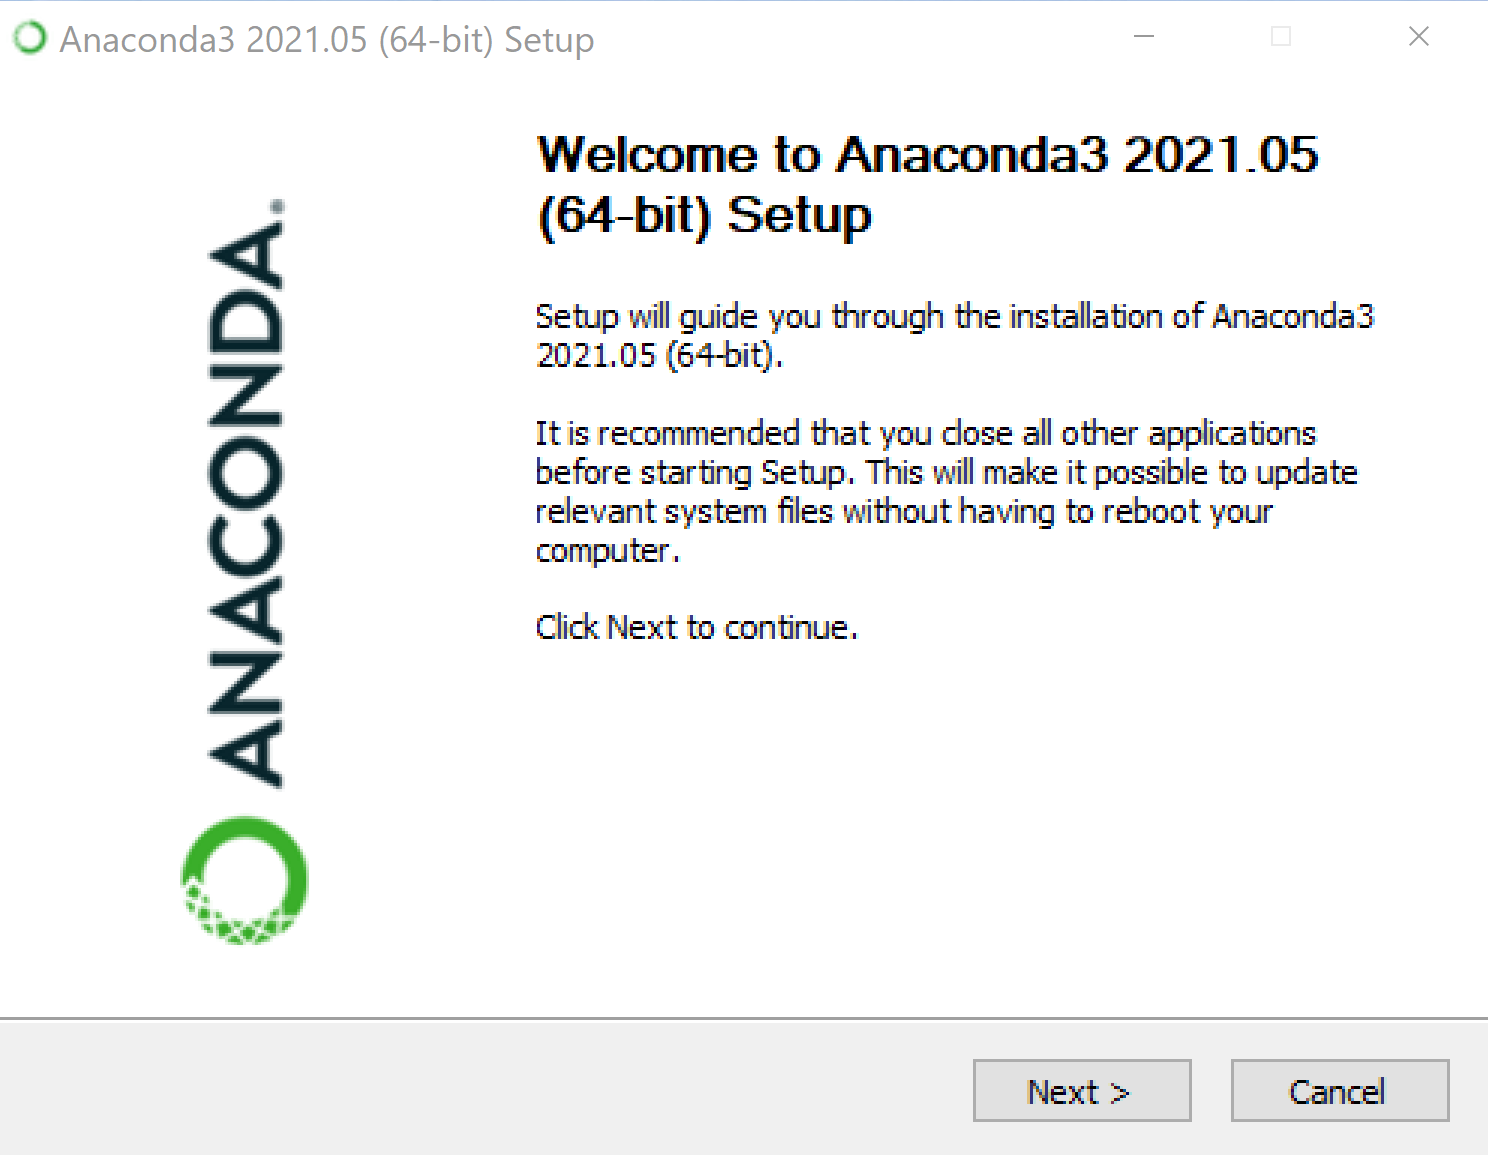

In [35]:
#@title Install Anaconda (1)
base64_data = "iVBORw0KGgoAAAANSUhEUgAABdAAAASDCAYAAAB5ph18AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAALEoAACxKAXd6dE0AAOEfSURBVHhe7N0LYBXnfef935HE/WIk7MT4EhuwnASTCyYkDXLTC6Et4G1oa7O9JCHpRUrbtKZpeNtu2U3ft+y2CW0K7bYNJG2XNm1T27tL04C265A6iXEuBJMmWEkQIMeO8RXEXQiQ9M5z9D9nnhEz0ozOHN34fpwn54c4mjPzzDNzxKOZ/yl86tGn+xSnpmAhXl9fnwqFQrG57JpT+lpv+dt77bFfjfqf19fTq5qaGtXVFlRbW1ts7s81wV+775/kvXxp2U4pl17Tb477XudKX/i6pa8VH/tq+tevt/T3NfYY6guedjn4fveYJPz+6DqVHoNXKebREqy9paGV+scp596r+7bEPcftr8H4/TMcg/X9SIvrn9L2uT+Xvub3lf89cQb2aVZDfX9f79Xj2ueOtUSFXlv//tcovZb/mv42l5T6wrWhXj9umX4edP2GEqy/O78ES+z/o62r4+eS0jqXslPp+I17Hd+Qy+8b/Pjy+6pScfugdlJdMbvmtsXtD/fo1rvUfP72FoKTeCFYTOlLpb8rLc+1ofav+35fn7f8okKtenp6dOXKleJjT3C+dcstrdv0SZPK6+3OVS776+ieO5jawf96yO8fcvuCdSn1RamVuPdOt84DX8FtV+m5dXV19tV4peX52+zngftvIH994iQt188l/rJK2f/aVd8fHL/9Bl+HwZT6f+B2lP4ct56+3uDnhEqUxm/ctjtDjY+6IX5+GLhdUf0/W111ECUo9YV7dM0da+6Ycu/B/uuU/t61y5cv21fjDfw+/zEN/7Xcskpj3/9aifuz/+j4fx9nyO8f8P5Ven7ccv3vK+W0r+8/Ly4PXLb/56oa8DNAnKG2sbfn6n5xBm5DUh/4x0jc9w96Dkux/kMZavuGOoZ77N8g/e+F0W12f+7/GSVYTvH/Q6XnJr3+wGU5A/vQLdmtX9p/w8SpKUyyFC5/qHXy122o5cdth6/0/f7z/OzOUe7PA5fj1tG10tcHPpb425KUh1p+6bmlP5eb+4ds/9/Y4zAM8TNgib++fh5yfHr951pJaRn+1+IMOX681/f7qSTudQbmUnPc811zr+seB/s+J+61nFKu9N+wafrXSVrP0nokredQP+ONB257XXPbVdq20tcG7d8UPwP6fRmnkPL4STTE8ocaH0Pxv9/fllL2x8JwlOaASv09sL+GWv+hfnwcavyPtiz/hhvY/+7fYMUxa18bj0rb529nUh5MqW9KY8jvq8EM1f9pFfeDtdKfnbh1Kf25tP+CLxT/XHxu8Ogvo9AbrmDx7+2PpWWUfnYqfY/jZzf+C8EXwq8AAAAAAAAAAICisf0rJAAAAAAAAAAARgkT6AAAAAAAAAAAxGACHQAAAAAAAACAGEygAwAAAAAAAAAQgwl0AAAAAAAAAABiMIEOAAAAAAAAAEAMJtABAAAAAAAAAIjBBDoAAAAAAAAAADGYQAcAAAAAAAAAIAYT6AAAAAAAAAAAxGACHQAAAAAAAACAGIW+gOWqibxEof/Bfc39Vyh9IeByoRD+GQAAAAAAAACA0cIV6AAAAAAAAAAAxBiRK9AHKr5kof+xeMW5rQFXnwMAAAAAAAAAxopRmUDPojzJDgAAAAAAAADACMq1hEvec/FuecX/xvYcPwAAAAAAAABgAsr9CvTIpLd34XhPb496+3qL7XLv5WK71HNJdTV1xVZbqNWkmkn9rXaSfVc4Kc9V6AAAAAAAAACAkZT7BHppktz9V1q0e7zSd0VXeoMWPJ6/dEHnr5zXhStdmlIzWVPrpmpK7WRNr5ve3yZNL36fj4l0AAAAAAAAAMBIqngC3V1tXvAuNXdXmrv/3GS54xbv/nNXm1/qvaTu4PF092l1dp/SqeBxRt10zZw8ozhxPmfKdbpuctCCx4FKy3GvxSQ6AAAAAAAAAKDacrkC3U1s9/b2Fh8vXrmo7t7u4mOpVItrvcHLuKvS3QT7y10n9PLFl4uPtTW1qnH/FQqqn1IftDmqn1qvWZNnaeakGZo1aVZ/mZdCf6kXhwl0AAAAAAAAAEC15TKBXrzqvK+/nbt8ztp5dV3psnaxeOV4TaGmOPn9/Pnn9ULXi3r+wgvqvtJdvjJ97tQGa3M1b8aNxXbj9FcWr06fVjet2JzSKjORDgAAAAAAAAColmFNoLtv8SevXbmW0pXmp6w0iyvRcvbSWZ29fFZngsfJtZM1qdD/AaHPnntW3zsftODRlXM5felM8XtumHa9bph6va4PHu+cc4carc2ePKtY2sVdle6416ecCwAAAAAAAACgmoY9gV76oFD3eP7y+eJV5+7x/OXwA0JLHyjqrkyfVDOp3F648ELx6nN3FXp5wv3iqeDv6vqfUztJN82Yd1WbN31e8e8o5wIAAAAAAAAAqLZhT6Bf6eu/6tx9OKi72vzkxZM62d2pyz39V6K7r0+f5EqvTC2WYHET3m5y3E1+n7h4Imgn9XLXyzp1qf9q9c7ge89dOl+cfD936Zx9mOjs4uOd9Y1qvG5h8XFa7TRbLuVckIdOHXz4Ie0/6XKDlt1/n5bUF/8CwETSeVAPP7Rf/Yf6Mt1/3xJVfqh3qmPvXj1y9KQaFi7TihV5LBMAAAAAAIwlqSfQXckUX3dP/weFXgweXU3z57te0HPBoyurUlIsyRI0V5LFTZy7CfTaQq3OFEu2nCqWbnET5ycvBi14dKVdnj1/vFjapXSVuXv+3Te8UUtueEPQ3licVJ89KWjBo+NWP9dyLv4kCxOq14CRn0Dv7OzQU08c0NHOkzrZP9D6NTSooX6hlt69RPOrsA7udZ/Ye0CdwYuGLxu8ZkO9lq64O3jNbC8au7xgGxYuXKq7l8xPPZGY93pdxY7pYOfqvpx3buV94I+/FBauVPOK+faHnHTs1Y5HjhbjwpXNGmrx5fF71N9fbrMbVB+M37uHOYncsXeHbDWqs53VmED3+s5J03+JvPWraDlpdHaq46kndOBo8N4bOQk57thTcV8uqNK5CAAAAEC+Xn75ZUv5uP766y1hIjlx4qS+8pUv6+1vf7smT55sX83m0qVL+uxnP6u3vOX7NHdu8I/Ha0Tt7wUsD6k4SW3/uSvF3US4m/h2tc4vXulWT98VTa+bplmTZ+q6ybOLHwhaP7W+WMN8cs3koE3S5NpJxe+vC/KU2smaWjdVMybNKD6neGV5bf+fS1eYu+XOnDyjWEPdzeG773W5VA/dKU2c5zGB3vntfTpwvMv+1KWLMxZo0bz+dcFEdFHPt7Wpf5dP0813LVL1drebLP07PXLgmI53dqmrNMxKgi90dR7XsbYD6qjJc9yFr9vpXsO+2s+tR2fwmm060FGjBYvmBb0wlGB5e3frkceevHp5wZ87jx9T24EO1SwYqi/zXq+B3NXBu/XQY0eLy55281359mkufeCPvxQaFmrpgjxnNDu096GvBVvj5pTv172vHWRlO4Pn7n5Ij5XGr325pMttd+dFzRhym+N06InPBuPA/pT/dgYuPq+2tuP96z3tZt01rDE1wKkOHThWXutgtZdq2Ks9bZ7m1XSoLRgMncfSjJ1hCPbhwcf36l8eO6BjxzuL++xq7thz+/K4CjdXsD0AAAAARsyFCxcs5WP69OmWMJE8+ui/6fhzz+mZ731PCxcuVG1trf1NOm7y/DO7d+vFl17SmdOn1djYaH8z8WWeQC85032mWIblhQsvFq9Cd3XOa2tqbfL8OjVMbdCcKXOKE+MzJ83UlNop5RIu7spyNwnuyru4yfLrpgTPn1JfnHx3f3aT4+61LvZcLNZHd5PvTndvd//k+aRZmjut/7cceU6eu0mcx//lyXASJ9B1vFsNSxdwW/6ENZIT6P5ruauUF+uON92lu4KT1txg/F4suAmt4hODcdeW0yR6h/bu+BcdKs+TNagheN3F7nXnzlXh4sXiBHBR13G1DTlZ7SalH9IXj5YW2L+8e4LlzZ0bbMPF0jZ06XjbYJOAea9XVGfHXu1+6DE92Vl+gRwn0PPqA+d5tT1mE8fuyvWbbipeyZ3c5mtBjgPUbcfX+mfPde+K+cn9W7w6+oveRH+wLgtvCvbXm4rjd2Gw3YVpQQuW1TCMY6jz4F495v8WYbxMoNfXq+HU8zoWjDNXwqXp7sqWOW3ePNV0uHNEMHaeH+4vjhLYPjzqHRPF/dgwTTe5cRecgwrTpkUm1Sv6hQAAAACAEVOaQHdXjrvJ7+G20nJcxsRz2223FSfP3Z3IWSfRS5Pn7nvd/MSP/diPZZ6AH88ylXDxJ9CfOfuMvhu0p4Pmrip3k9zuAz7rp8wpTpy7NrV2SvFKcjd5noarif7yxRN6KXj8xsvf1L+/9A39e/DoJuHdpLybWH/TK+/W0huWaGnwWFOoKa6Tmzz3123YvNvx3WAo3dpe9dvpMYrcVdAjVcLFXbX8hObcvSKxLELnwYf1ULmeRw7rUy4L0aCFyxLKivilLQLuSuSkUieR9Ystg9E/uVyuapFUKiPn9eoXvPbBJ3Rg/9Hy9/iG/v50cuuDIveLhEdUfGo1ypYMJnXpFm8dAw3LVmpFhhI9Qxqwn4vGSwmXDDo7DuqpY0e1X0sH3zZvPfMaswP3ofsFxcoVyeehYomXJ/bq1ILg/DMCQzJ13wAAAACIVSrhUmnplbyWg7Fr4ET4vWvWDFnOZTjfM9HU2OOQ3AR1T29P8cNBXe3z85cv6Nzlc8UyLu7PboLdXWHurhB3E+Zu8txlN8k9mGINc2v9V5fPLNZNf+W0V+imGfP0qlm3avbk2ert6y3WTe+82FmsnX66+7QuBOvgPrA0l8nzQEfwD/h+DVq4dGHw//2OHuuwBFSiXksGm7QK1C+5TysX2h90Ukef8u+HGK7+ifjESc/6JbovfFGdPPqU4l+1Q0+UJ/cXamXsBGS95q+4X8tKB8/J/Xoi8fDJa70CbtJxx0N6xJ88d5OEy8Lvz0fefTBaOnXwgJ3vGpbp7kHmLDv2hhOvC1e6Cd0cJ88DHU8MmDyfiILxufeR/dp/NMWWBuM+ePspOrn/iWDEVa7z4AFv8tz98mDw85C7sn7+ipGZPM/UNwAAAACAiriJbzcBXrpw2E2MuwnyJEye90s9ge64Mi1uAv3ClQvFGuiu9vnpS6eLJVzcBHd/nfPJmhI0d+W5m1CvCf4rTZCXFP8c/Oe+pz8F/xVsAn3yLF0/da5unPFK3TzrJt066+biB4f2Bv+5euungtcrfQCpW48rvVdsqf3Ldct0LbsOhfPnC3X7/Nu1MJxBz2USA0hj/oI8J33naGmaq9jn3+1N+B5V7Lx9xzHvKuS7lTy3Vq8lpRnAQPwvoHJcr6u4q9pX9k8SzrEv5SXXPgh0nir/UqChIe+VHUTHE+UPLl24dJArsTv2Rj7Yc0XenyhZXn6Dlq1cVv6l5bVu/t2lvjiqAwdTDfpBnbK7qZxB9zcAAAAAYMJLO4nO5HkocQK9NLHtcxPTl3ovqat4Bfp5nb18rjiR7WqVu78r1TZ3V6CXap67K9CLyyl4y3TZJtFL/7nv778CfZaud1egT3dXoLsJ9FuLk+ruOZ3FK9BP2ST66eJV8O4K9JJwaamq0kT4V+j1TzDU6/ZwBj2XSQxgxNXPH/xK07J6zRnieZE7NG4f4snzF6g8fexNEpfluF5lwcncXSF9f/MgV7VXKNc+GEXl7Rjq6vPy9rqSH3lfjuxdBb9wqZaM4O8Pxjz/KvTB7rxIpVOnePsCAAAAAHiGmkRn8jwq0xXo7mrv7p7u4pXfbpLalWlpmFqv6ybPLpZZmTlphqbUTClOpPuKH/BZnDe3WuUuW93y8p/tscRdye7Kubir0d2kuptcd670XVHX5a5i+Rg3ce9fgT58nXqqfPv4Qi2weaL628MyLpVPYgDZ1aeePa62AXdoDLlac9x8dr/UV45XwJV7ue++4hXS1euxKvTBqZMjX76k86DK1VsW3p7cX97ztHDBIFfbD4/74ND+q+CrMTk//pXvRBmJ4wcAAAAAcM1JmkRn8vxqhT6/toqnfBW3TXY7rlxL8QpwdyV40E5d6r8i3NUs7283FCfRZ06aqRnBY4lbVnGCPEb5SvTg0f8w0OcvPB+0F4rNfaDoN14+VGyvu/4uvf761+l1c+/SvBk3Fuuk3zj9xuL3uKvYS+tdW8jwSbCufnLpw+UiH17Xmf0DJv1leR9U19nZoSf2HtDRYPCVNDQs1MKld2tJyrIIpQ9aO9p5MhjE9sVAaTm3Z5o87AyW95SeOHBUncHCvLUKllefbnnug+aeekIHjnYWD6pQuIwht62K/eW4PnPb6C8nWJAWLix9cGW2fZzvPojXsXdHWNYizZjLxRD9kHiMJAu3w33LcD+IdxjHoM//YOBKP5CxGn2Q+oM88xN+COoQ/VnNdfP6srxfhtG/mSSca0ofmHng6IDz4MKFWnr3kiHulPA/nHOhVjavCH/R4PXf4JL2Q7jsSsfu0B98W4HgXH3wieBcPbD/BnsPGGbf+NuRZkwOefxVZUwAAAAAI48PEUUlBk6YO0yeRyWXcHET2wPm1ktXoJ8vX4E+VfXuCvQp1xWvQHeT5q50y8Ar0AdTujq9pDiZHvxXvAJ98izN9a5Ad19369B1patYPsbVXr/cE5ZwGa7Op8IPHlxYuvy8yC/jMvwPdOzYG/yj/6FHopO4gZMnj2r/Iw9px94ODbrkjr16eMcOPWQftDZgMeXlPPTwwcGXYzqLywueHyzPrdOAtSovL/mDDzuL27TjIfvQxoEr5C1jx8N7lbX6TcX95XR2aO/D/X02cDnBgnR0/yNBf+1VR9p1y3kfJHH7pjTh07BsRbbJ4oqcCrcp7upq70rptLW659hJtzJDrNdIGrU+yFe5HvYQ/emXb4mcFivWqYN7w0nLFSM3yK/iroJ/2J3HIhOlTvDno/v1yEM79PCole8K72Co9A4o/24q96G2lZ6n+pXeBx7pPyfaV/sFfy6/B+TxWiMn1ZgI3oMAAABG0o7g36J5NgDwDbwSncnzq2Uq4eI+ENTVNZ9ik9muDvqJrhM6d+lcsRa5+3tX8/wq0Xn4qxSvPLer3CPc1e/uP5tkH/ichIvnM4ov31JSaRmXUwcfLv5DXMFSFi5bppUrV2rlsmCZ/rza0Ue0d5BJGjeRFf5D3l09vUzL3HJWBo/lCf6AmxgZ4h/2xcnpR65eXnG9bHn+ql3NTUz3Ty6UFK++Xua+323bsmB5/jod1f6HHk49iZ5HfxXXsTgBb38MuCsH+/tsZbCNtk+DdXtk7xMDJkni5bkPrubuBjgY9Gv/vnEaFq6s7GrpjPzPAFD9nKuuTu0cRhFlv/zMcL7fGWq9RlI1+sD/2tFHBvxgG4yHh/ceTP9LnlS8MjSD9qdXNzs4+Pp/XeDG6V49HKyXv54Pu1+SBSuZdjXD0i0NWrYixyuhswq25SH3C8AgunPYMjuHLRtwvjm5/6HhTaLPubv//OWaW6Z92f3SoPz1Ylua8IsM7xe4wQ8vp/rT8NQv0Yryp/EG3Hlqx8PaO+zB1X9nSPg+4K7Ojp4Ty68WN2Ffcd9USdoxEbwHjd4vVgAAAAAAIy2xhIsrh+KUJ7ADZy6dKZZxOd19Rs9deF7PnQ9a8Dh/1u1acN18zZ99uyYXJ9inlGuWO+4lYifIjft795+vWCbmYn+pmP0vfE37XzxQbK+tf7Ve2/AavSZ4fNWsW4N2i26deWvxe4ZVwiX4B3P5VvLYsgF+CYmE28B9/i3hxk2Grgi+aeA8QOS2+oG3/3uKt6F3Bv+YT3U7fHJZhujrNQTbsiLYlrjZiU51HHxCp+asCF7PvlQU7Qt3BevKFcE6x05wDHhu0vbl3l8D1zGpXIHbxr16JFzBQHLf5bUPiiLPHcBN2mQsU1M5vwxF/LpnLZ1Q5G3n8EpQDL1eQ6p4HULV6IPomE7mJidX5DHZ7B1vg/eH1/fFY2iOnng4+kupqwx6PjCD9Yd/Log9F1co5lwz2DoPPF/Gjz9/jCadkwLD3bZyfw1z/A8QO94agveCpUnvBfH80ihJ5+vg1SLn4sTxlqFvsh6DmUq4lFQ8JgAAAICRRwkXVIISLkPLdgV6oUZ1hbri5LibrHZXoL/srkC/fE6Xei5FJtuLU+JuYjyHq8Qjk+9BLE2457HssExB8A/s2DoF9Vqy1D7MLXD0WMari12JgtjJBXdR4AqFFwUeVeKiixNYbjI74V/q81doZXkVE0rNdB7U3gH/8E+eMKnX/GDdopPngY4nohPiwTolz7kE/Xbf/ZHtO5Dmir1K+8tfx8TJc8dt431evw0hj32QQmnzRu7aRjfJVZoAdJs5kmVjBjNW1ytfp4JxuHDhwphWHuhFrnTEQzv2Kuu9DYNJ/QG1wdOeKk+eR680Hni3ySMPDbaOHdpbnnUd3dIt/QY/h9UH54f7yyeck9qfXNOqeuaUruQ+qZMVXYLez21T8/3BfvOHV/BD0dFSua00V6R3hGWm3IT3fQnnazdwlty3MujlfuPjg7jHwZgAAAAAgBzFfWCoX86l9MGi17pME+huwtpNnPf09hTLtbga6LMnzyqWdenp6ylOpF+8crFYp9xNpvuSJrtLk+ElxUn44D9XEub8lfPFK9Hdct2fndrgv6l1U4sfVjq1bkq2Dwu9ilfOIPiHc2Kd3/kLypMAOnoswyRWwxAlCvwa60osETF/ydBXns5fMPhMsF/nfXiTkZ06eKDcWXJXrw9x8V+gXktWLCtPCg89gVJpfw1Yx6Up+u3ucP0Gk8c+KPPLF7jyAG7CtPwbPqulviN92Zvhi14hWpwMGxOz1GN1vfLnflG1YkVcu0/Nzc26f6VX3kKu5FCFE3blOu4NGrSMe+ep8Fg9ur9/X7hfIjXfp/uCY3TJ/PmaP39J/3rev9KbkE1aR/8XIkMd5yMjzTmsfsnSYZ77c+KV2RlOCaFYrpzLfQPHVsDOPa5s0GCvFP7SOdiPdw/Vg/NVPi0Gyx/m7xVHzLgYEwAAAACQk7jJc3e1+cCa6EyiZ5xAL06e9/XoSt8V1RQKxQns2ZPcBHpdcdK8OIHe0138+xI3Od4b/Nc/TR785ybM/WZfK5WMcdwV58UJ9MvndbL7ZPB4oXiFu+M+oHRKzWTNqJtRnMB3V8QPW8ex8hWuWrhgkH84e5MAwXekvgi9YegPPfSvAj2ZxyWGgauXE63zvnRYk5H+hzku05DzJiX1t4eTa0NNoFTcX8NYR3/9cjTovqyv1/ziBGR/W+ImTO9zE6b3a6V/dWOG2vGZudIFO7zyCkOUThgxY3W9Rkn9/BW6737vlzxHD4zAL1ZiFO/ASJj0rp+vFd4vyuLWsWNvuE8XrhwLZS/SfjBq+EGe7jya1xz2WFAcW8VzTnQivf9uh6Rzj/dL5xTnayf8IN18rqKvHsYEAAAAgGtH0uR5CZPoUdmuQA/+cxPdbrLclXNxE9iz3BXotZOKXztbnEDvvwK9zJVcKf1XmjD3/nMG/tlxE+bnr1wo1kAvlojpvVT8fnfFubsCfcakGcVa625CfbiGLt8S8q8uPnpg8Cv0qst9kF+HOjoO6uDevcUPnnz44R3lusKxOp8KaxcHA3+wC08T+VekZvowx3qFc95VnkAZ9jpmNYx9kEp/WZnmci2Yk9o/xNWgw+Hq+O7w6v4WaxOPgUnqsbpeo65+icIqUsMvD+QM9yrmIe/mGLCOkeN8QMmPSndpcZx4H2Ia34b45VPq8+AInr+GkNcvWKP6y3UVJ9Ijv0l0v8CLKcfjn2OLH0Qa1/fR5tdcz+0q+moYh2MCAAAAAIZjqMnzEibRQ4kT6KVSKn79cVeqZXrddM2Zcp2m1U0r/n3xSvFL54sfLnri4gmd7j5dvHLcTYC7q9XdpLebbC8t66r/gq+5v3fNTbx39XQVP6zU1VZ/7vxzevrM08VlO9dNmV187esm9z/OmDS9uE4l3lLtK4PoPCiv2oeOPhL/j/9y8ydHR/xW9P4PvHy4uC4P6aFHHtEjj+zX/qNHdTQYwMH/0hvuxHK59IObZ8g2BR9egVhlFazj0HLcB0OZf3dY6z3XsRZsw17vQ/AaFmrZ/c2pyqP4V/6nnQTznzd4ve3hr9dIqm4fDM7/BV51JlIHiJwn0l2Z669jebvdHQWlc6e7in0c/kJkxM5fo6pe84vlePySVjHleLxz7LXs2hgTAAAAACaitJPnJUyi90ueQHeT3d7kueMmq92V33Mmzylefe4mqruvdOtCT5dOXzqjly68rFPdp4t/dleMu1Iu7or1Ql9pWjv4z5Zbbvafq6nuJtwvXL5QrHv+8sWXdfzcc3r63DPFSXk3Ee8mzouT6FPnqH7KnOJkvj+B7pSWNxS/Jnh2lV0Fmklnh/bueEiP7I+urxu4DQ3uwwbtA/3CT9dE3kZ8H/i13k/mdIWjq0EdbEPpVoRiSY7hfTBn2gncU+XfKgxWbzu/9RpJ+fZBCuUPkxwFwTjPuur9/RPs273hHQVDXrHs3X2go494fxe9Etp9mPD9998/RMtvDIX78BpQv0T3+Z+sPFjJoOBY9T/LIU1bmqbmyzhwTY0JAAAAABNG1snzEibRM5RwceVVXKmW6ZOm67rSFeiFgi4Va5W7Se/TevniieKjuwK9u+dS8YpyN/FdmixPUvp79/wLVy4UJ+OLV6BfeE7fPfN0cZluTnz2FDeB3n8Funt0k/luAr1YGiZo6fk1waUG9yGOqVo4hTX0B2LmwU1AlT54z63nMq28v7n44YL33Xdf0NyHDdoH+lVwdWtWWa+AzW0SMYP8rtId/X2Q9mrnZP2T1OULvJfdr+aketZJ/Alcv4xDIr82sF/ywJfDeo2kqvTByEp/FbxX5zk4fvM6mvJRr/r6oVv+Ru78FSf/u2oS+HfADPwFnn8M1M+JfJZDqjZmD+7hGt0xAQAAAAz08ssvV9QwsX32s5/NPHleMnAS3S3rWpKpBnqxRHnQ3BXe0+qmqmFqvW6aMU8NU+o1vW5asLBCsV75984+q7aT39K3T35HR04fVceZDj177lm91PVS8Wpyv7mvHT9/XE+deUqHT7XryZNt+vpL/x58z1M6efFkceLelWq5cfordeecxuLruclzVwu9WBrGm5gvTcT7X4sVqQm+TCvchzimaksVlvk9Wv0yLh1PlCcXXe3g+1YsGd4EhF+O4eixq+vappF58rBkBCcRh7WO3gePxslrH1SgktIfTvQDHO8fXmmUyIfBpplQ9fo14QN6c1mvkVSFPkgt9/JEQ93Z4N8Fkf2DEkvrOCf2F5FJrXz0ugVEvj56c5Teh2aOxi9BMp1rR4D/XjLK6zb0Lxar9QGfozwmAAAAAGCY3vKW79NN8+ZlnjwvKU2iu2W4ZV1LUk2g+1d3lyao3RXo9VPcBPqNxYl0N4FeW1Ors5fP6nvnntWTJ9r0nVPtaj91RMdOP1X82ktdL+v05dOR5r7m/u7Ymaf0nc7DOhR83xMvHQz+3FH8AFFX1mXm5JmaN/1G3XndHbpp+jzNnjSrOIHuJvLdf1l1POF9UOHC28MJgSHN191hcWrtf2JYU9Gp+RMEQ02aDT6Z4F1NqqM6NpzVjkwe7lfqTc/jA0zT8id30v6Co+NY+eryOPntgyz8OyQqvMLR+wBHd4X3imHP/vsTqinGkNevsR/Qm9t6jaSc+yAD/wOPK/qFivdLpqHGa/3tC+256UpWhevYoIXFUh39H1AZ/8vImHZ36fUC9Uu9v6vCXQnDOT9U+/wVx/vFSaW/SBuegecf/86EEfgl8gB+Hwx9l9EQvxwdaLyMCQAAACDG9ddfn2vDxDR3boNWr149rMnzEve9bhluWdeS9CVcBpRI6Z9An6N5M+aV65G7yeyzl2wC3V2B3vmd/gl0dwX6+eN6sevFYjkWv7kr0N3fuSvO3RXoh048qYOlK9C7O9Ub/OdKtbgr0BuLV6DfpNmTZ5c/eNRxV6mn5189VproSS+cVAoM92ru3HXoifJl0nHqtWRpWNf26CPRmsLp+JOHwTIOHExx9WFnpAbywqXVLs8xX+HnGKb5BUewfv4nyVZkqH2QgX/Ve8NCVVI2OJzUXKilFV7h7Y/9wfe/36/xH0CZ53qNpDz7IDXvlw0VL8v7JdOQE5DeL81O7t+bXAvb8T+UucIxOzKynx9yO39luHI7/CVHJb9Icx+A3JH6NSPnn2CLo/P20c9n2L83zftABkP1jX+X0RDvv50HD4QT3amM4pgAAAAAAIxpqSbQi1edu/+80ih1NXXFSfRZk2YWr0S/ftrc4iT3rEmzihPbF69cLJZgcZPpbhLdXZH+9Ze+oa8+vz/S3GS5+zv3nBcuvFj8vim1U3T91LlaMHu+3nj9G9R43R26ZeYtmju1QTMnzdDk2uhvSgau26AiV48NY6LHvxI7WNKwruZOKXK13f4n1BE3s+A+4PLhsEZ3okhd26N65OG98csrchMue3VwwLa5D+8LL8Dfr4eGWoZXosOVyrm7sotwU5l/9zJvguURPbw3YeIo6De//naS/PZBpw7udX2a2GFFnR179XB5trRByyq6+tb7ZVEeV0rWL1H59zBu/8f2bXS/Nyy7O6Z0Sc7rlafOg3q4+MGVDyvYvKvl1geB4LX27j04yDE0cDxIC1euqKwUjP9LpiEncv1fvJ3U/ocSjnfXZ94HgI6bScXBzg/BVyPnh0rPX5G7Y9LXlC9/fkSFv5Q4FWzrQ8GYLm5vhvEWN3brl/ilzNz7wOBj2L1ghzv3JT0nS98MeP99JGH/ue14aKiTe5yRHBMAAAAAgHGj0Jft0zfL3Ad+FlvfFZ3qPqXOi6d06tIpHTvd0d/OPKXLPZeLf+8ep9ZNLU6MT5001ZbQr/tKt7p7+ptbFfdfb2+v5s24UfNm3liclL915q1Bu0W3zrpFk2smFyfQ3YeHOqknzk3H3h2R0hHDqbvcefDh8B/nC1eqeYX3r2h/Min4B/b9Q30oYvAP/R2lFRq4LHVo7w5/YrZB7gNPly5wU45BXx87qqPFUh8NWrasXvv3Jy2nxCZ6/XmFhv4awwvmDFymW0yzrl7MwHUKFhEso37hgmAZ7k/RZRQFf7/yvoSJv1z7q19k/xT111NecFW/uZdcqYVHH7FJkaAf779P0SGR1z6ITr4U+6w+6He3nFPBck4eVWewnMhaD3N8lkX6NuiDTB+sGKzb3XH13q/uD9e3DQuCeOxk0BdHw21IGodVWa8E3ngZuj8HTJApGLfNceM2hz5wIhPPbhn1QXcs0Bw3rqoxHkx4fMSN96v550zHjd2FwfE+R8d07GhncD4J17KidfT7Y7B+G67IuAu2IdiD/aeB/mN6YXAsur4/FRzT++380C9pHDj+WBjseQMnX93+Xlo8Z546dky6e0XMfvCWXVF/DBzX/dwHv5Q+bLWzs1PuQ2AiBjsf20S7/x3lcVF+HzgZLDd4TvFJg421jH3jvwcUBc9fFpzf3QufcmPS9muw/svq9wf7sv9Zse9nVRkTAAAAAICJpvb3ApZTc5Pcrga5uwrdTWa7K87ramo1KcinL4VlWdzE+ksXX9bx888Va52/aF9/9lzYnjv/fPHrL188UZxsrwn+mz5pul4161bdcd0C3TX3ruLEuZtInzttbvn13DpkuvK8qENPfPZY8M91p0GLm5Zq3rTiHzKZNrVbHW3H1eX+0HlKNQsWhcu5+LzaSn837WbdtWieBn2JUx06cMyudwv+Ab90gT9TUK8FC2rC1wr+v6vzuI4dOxa04+rsdF9t0MKV92n51MGWUxIsb9EC1Zx6XseL3xvo6lTn8YHL7NfgJjGuWkywjKXRZXQVl+G+P24ZK3XvvXdrnv35Krn2V79p8xZpQU2H2o6X1qMrWKert7F/sm+qnm9rU/9Tp+nmu7x9WZTXPrjovY71WWk5Qf+75dhfFb932T1v14rXxu3DDPy+7XJ94F4zbbuouVf1heP6o0Gnng+Oo/4FB889ruNBXxwPvq+0DcX9vmJ+/L6synol8MbLtJvv0qJBvzG6j4r7NRjrV++FHPrA8fuhuIxOHXfH0cDxUBxf9+reSseDCc9fXbo4Y8EQfRJs7YKlagj68Vj/xhbHbv96Bvsj2H/93CRmsI7DnTx3/P5IPIdVIHKuuUNvv69JMzrc/u4/po/bMV0+NzrBeqy8d4XmJ3bRKXUcCN9T4seLM03z5nnnETfu7Zx5vLMQc94JdDyhz9rYXfimt8eci9O6qIvPPV/efyVd3rHnsq//vP3ahG0J1AfjJjgvnno+GKv2reVxUT43uuX2/50abtJdC4K+ie3HjH0TvLY/HoNvCN/DimMy+JLbb/ct19SOA8Hz+p8V+35WlTEBAAAAAJhohjWB7iaufb19vcWJ7OLEdl9fcWJ91uSZxZIrDVPqiyVeXjH9hv4/T60vPpaa+7qbHL95xk2aP/t2LZgzXwuvW6AF180vXnV+4wxXFmZmsVyMu4K9JPvkubvYbK8eK82ONSxW09IhJmuTTJuq7uI/st0fBkxCRf5BnsOE8LR5WrTUTRg8r1OF4B/15X/Huyvk7tG9b28KXjv4Y4qJ5X7TNG/BouDvG1TTfUoXI8sMvrWhQTctvkdvb3p7/3Jj9S/DTSLOiFlG8QrCxYv1pqZ71bSofvDtz7u/jJtEL29jZ7B+9vX+fluse94erFtxBsSfNI2bQA/ksg+CPlu0VAsaatRduBiM3QF95pbVcJMW3/N23dsUrEP8TFM2ft9mltAXzrT+X8QsaOjW86e8STLbhnvufXuw3wfZj9VarzjePhl6At2fyOuftL478TCqsA+cYFzNSzqGvPHQ9PalWpTHeCjxzl9dF2cE2zH0ebDeP2f4x1PxWHfni+AYqHRG0R8Xg57Dhumqc818zY/dh26zFpaPxcG7Pu0EesCdR4I+PPX8Ke8XD+61bgrOpVdPLnc88Vmb/F2oN719kOUOaVr//nPnsJoZKkyLOf8E+7FhWjDeFr9JTcHYdX0/5N4Mtqf/GJih7lMXI9vkFN9LbgreB4Lz49uXDtGPGfvGbY97/+kOnl8Inl/+jtJ4XNH/S9tTmSbQS2PCnadPVTAmAAAAAAATzbBLuPj8ci6dFzvV2e1Kuthjd/9jsUxLb7cuXum27+o3tW6KptQErXZK8cNI3WT7nCnX6brJQZsyu/jorjovlW5xsk6cAwA85TIY6cq4YIR5pUXyKt2DGJESLilKiAEAAAAArkkVT6C7b/cntN3V6G4yvaevp/ghoiesnb98XueunNO54NHnPhR0Zt1MzQgeS1eoNwSP7ir2WvdfTW3xee51hle2BQAQlVd9bVRDWHeeWttVxQQ6AAAAACCFGnsctrjJbFfKxdVId2VX3NXkr5h2Q/FDQV1d8wWz50ea+5r7O/ec6ybP1vS66cXJc1cLfeCymTwHgDzM14qVC/vj0QM6aGUuMAZ0HtQB++DLhmV3M3kOAAAAAMAoq3gCfSA3yd3/oaJ1xQl0V4LF1Tm/acY83TrjFs2ffVukua+5v3PPmTNlTvF73JXnbhluWcUrz+0qdybPASAn8+/WsgYXTmr/3oNWxxujreOJ8IroFZRuAQAAAABg1OU6gV4ssVLon0B3rTiBPuU63VC8An2ebp11q+bPnh9p7mvu79xz3HOLE+g1/RPopWUCAPJWryUrlql/Dn2/9nIZ+ujr2GulWxq0bAXlRAAAAAAAGAtynUB3V4znqXjVufuPK88BIH/1S3SflXI5uX8vpVxGk6vH3T97roZlK/hgVwAAAAAAxoiKP0R0MKVFp72KvDQBz4Q5AACoKj5EFAAAAACQQu410Ev8yfMs/xW/p3pz+gAAAAAAAAAApFK1K9AHTqCnYQVb+jNXoQMAAAAAAAAARlFVS7gAAAAAAAAAADBeVa2ECwAAAAAAAAAA4xkT6AAAAAAAAAAAxGACHQAAAAAAAACAGEygAwAAAAAAAAAQgwl0AAAAAAAAAABiMIEOAAAAAAAAAEAMJtABAAAAAAAAAIjBBDoAAAAAAAAAADGYQAcAAAAAAAAAIAYT6AAAAAAAAAAAxGACHQAAAAAAAACAGEygAwAAAAAAAAAQgwl0AAAAAAAAAABiMIEOAAAAAAAAAEAMJtABAAAAAAAAAIjBBDoAAAAAAAAAADGYQAcAAAAAAAAAIAYT6AAAAAAAAAAAxGACHQAAAAAAAACAGEygAwAAAAAAAAAQgwl0AAAAAAAAAABiMIEOAAAAAAAAAEAMJtABAAAAAAAAAIjBBDoAAAAAAAAAADGYQAcAAAAAAAAAIAYT6AAAAAAAAAAAxGACHQAAAAAAAACAGEygAwAAAAAAAAAQgwl0AAAAAAAAAABiMIEOAAAAAAAAAEAMJtABAAAAAAAAAIjBBDoAAAAAAAAAADGYQAcAAAAAAAAAIAYT6AAAAAAAAAAAxGACHQAAAAAAAACAGEygAwAAAAAAAAAQgwl0AAAAAAAAAABiMIEOAAAAAAAAAEAMJtABAAAAAAAAAIjBBDoAAAAAAAAAADGYQAcAAAAAAAAAIAYT6AAAAAAAAAAAxGACHQAAAAAAAACAGEygAwAAAAAAAAAQgwl0AAAAAAAAAABiMIEOAAAAAAAAAEAMJtABAAAAAAAAAIjBBDoAAAAAAAAAADGYQAcAAAAAAAAAIAYT6AAAAAAAAAAAxGACHQAAAAAAAACAGEygAwAAAAAAAAAQgwl0AAAAAAAAAABiMIEOAAAAAAAAAEAMJtABAAAAAAAAAIjBBDoAAAAAAAAAADGYQAcAAAAAAAAAIAYT6AAAAAAAAAAAxGACHQAAAAAAAACAGEygAwAAAAAAAAAQgwl0AAAAAAAAAABiMIEOAAAAAAAAAEAMJtABAAAAAAAAAIjBBDoAAAAAAAAAADGYQAcAAAAAAAAAIAYT6AAAAAAAAAAAxGACHQAAAAAAAACAGEygAwAAAAAAAAAQgwl0AAAAAAAAAABiMIEOAAAAAAAAAEAMJtABAAAAAAAAAIjBBDoAAAAAAAAAADGYQAcAAAAAAAAAIAYT6AAAAAAAAAAAxCj0BSwDAADkprWlYElavcOCs3yrBal93wOWpDvscaAj25osSY0bHrc0QPMeC1Lf9lWWBjpij9K2pkZLUmSRGdetOlrtUWoprLYkRbuw3ZK074GRXTtMcEe2WZCaGjdYkvzDpHlP+M+HxMNtomptsRD8QypyYvOMifMIkJfx/Z50xDtm13vHbMJPExHLm8Njeef2ETyWj4R9vm3LLkvSg4cOWRposT1K6zZttCStWRWuaap19s7/LevD8/+OFJ1VUV+N1vYmOOL1wxbvfXBMjPmR3Edp3u8qcE3/LIFxiSvQAQAAAAAAAACIwQQ6AAAAAAAAAAAxKOECAACqI/HWz+X2KG1t32dJSroDNrEUjC9VyYTxchs6JVwwiijhEiNF+aeIbOc4YGwbf+9JyaXfvGNzz05LwbHpnce2tXjHeHQjLVSpNFOKchnLt4bl6jbdediStGtzQimPNOuc4pzv79+daywEdq+voBzeaG2vJ9XPlwlGdMyPuX3UbI/Snr7tliSqsGCi4wp0AAAAAAAAAABiMIEOAAAAAAAAAEAMSrgAAIDqqKgUxNC3jEelKJkwbkpTUMIFo4gSLldL0SeJmsMSBH3XRr0bTDjj5T0pRamlNMdj4vFejdJMOfVtBeftxDImOZV/ib7u6G9vOmNrzI/sPrIQSCyFlLFUDjBRcAU6AAAAAAAAAAAxmEAHAAAAAAAAACAGJVwAAECVVHA7deIn/4e3UC9fHi7ocW+ZmW9FVbM9Snv6tluSku74PeKt2/rN4br565Bk+fLwtTbt9F4rct9rPrcOV7SezeHtuTu3D3177ljok6yWe2NvkzZbcrdHD73SWW/drqR/nHR9VIEUt3gnSlESofrjo7rS3D6/Z92DloLnVHB+CXrLHgc5by73zoNeJyZ3Z/j85j07LbnzY0InHvGOt/XhsbEj7YAt8dazeVOK1/VMrPPXGNinnsj2egM6xeYmSjwnjoGxlJnXP0k/f+RXwiV05Eg4Tnx33JHmBbL+3BDmykqUDP/nvJHd3qw7qdrLTyOvdahgH1HCBYjgCnQAAAAAAAAAAGIwgQ4AAAAAAAAAQAxKuAAAgKpLUwLBvw1UKW4b3bo4LDWxwV9mwq2oWdfBvxU1ufxLqHlPeCvtxvAuWbVvCf8Qed3E28GHf9tu8nom3e5vIZBcWiDjPkp4rWifrLfk+iT+e7P2ic/vn5137rbkyhUMXZ4k6/dmLxkUSjNmnHTjxkKlUpRzSdpmX9axWNn4sJCrrMdhmKt+u73HL0W0M3JAh2UoGiMnyKQ+THObv3cuSCiNkma/J+27iXv+Gq19aiGQar942/uA97KtLUnbG4qObQuB0RpLmXmlZratD4/f6MsO/bPCqElx3o7sozXhe1sl53lfJT9jZZZ1ezMPjrzKp1Qgp/diX9Z91J70/Ky8Uld7RqkUG5AHrkAHAAAAAAAAACAGE+gAAAAAAAAAAMSghAsAAKi+1vDW80LkPlDvts6+jZakwwm3fUdumb1zi6XBlrnWkrQr8224KcqGJJSLiUpTGsFfjoXAiJaOSHW7cLieWl3Jbc3V7pNs+zG/7w1z0vOzjhknXR+luH87jYpuG8/rtves4yOnbfclnrOGLh9RWSmDvLZ9tEoQ5H/MpFrPMX3+Cp8zsvs0p74dN2MpzesOvcyIMV16IsU4TDpfafTLg2Tvwgq2N/OLjdaY94zlEi6Jx0W4j5JLP1WhBBMwQrgCHQAAAAAAAACAGEygAwAAAAAAAAAQgxIuAACg+lLcirp8a3gLqTakuF21McUywztF9bj/F2luIU0s4RDKevvskW1NlqTG6P379jiMsjOJpWyqcJtsBWUtklSlT6I70h6Hcyt2xu9N3BehrGPGSddH3m3U9jgsldw2PmrjI6dtz6t8SkW33ue0DqNWgiCvY2Yinb+GLk9WlX26ZrelgeMw6/aOk7FU0et6pSe2eaUnIjspNJzzeD7SlDEJJa7nGCgPkm5v5bS9mY3WmPeMm32UJK/3MmDs4Ap0AAAAAAAAAABiMIEOAAAAAAAAAEAMJtABAED13bGm3NYtV7n5Ht+wIWzuz9ZUvBW+v61dpXJLtcxgAaUWtbjc7rxD5ZbVjtWFcisUhm7uFv9Sw7Up65hxjXEzQo7sLrcHg64utYgdq8stbl8VW+OGcnPfXmq+HZu3lZu70b3UxoZwjVq3tZRbU1NTucVud7G5fulvrkJAqWEUtLeVW9I4rL7xMpbcDwD9bdUDO8tta/AzRan5RvT4daU8rDUVGsvNvR2Umoplefpb8572cnNVMUpt3LjWtnfCCo+pNcEP56UWsWNXubmiOaUGjFVMoAMAAAAAAAAAEIMJdAAAAAAAAAAAYjCBDgAARkCKWzmTNK8tN3dXbqn5y7xzscotlcRlphHeOry1va/c+voqadvLLfv6YOyrxphxjXGTp9YtG8rNVQkoteBEUW57gn4vtfh9Em3tW5eXW8TjD5bb7iMqt9FTKkJxRNuaGstt9YYd5fa4Fpfbnvb2cotu855yC3sN15bxPpYq+NkiL60t5dbUuKHcoucl/31lX7ltX3VHuSW6485yc5tWar5Dh4+UW7JwXx8+pHKLWBy8jrWwZweo9vaOR2NtH1Wgve3xcotYvqjcGoM/lhowVjGBDgAAAAAAAABADCbQAQAAAAAAAACIUehz90cBAACMFHebrims3mEp2fKt7ZakfQ8k3FRajWWq1R6llsJqS5K/9HTLCW+tdbexl2zw72Rt3mNB6ttuIZDudcNc0Xoe2WZBxVunS6KrGa6nVo/lPvFft5L9mPV7w1zRvvD6x0nXRzkVb0k1DsJ/PkRfdrSOmUq2Pa91TjL08qPbEm5vZduecbvu3GJp4Dk0LD3jyiWUJHfDKB0zY/r8NUr7NLfz0TgZS2t2WxrOucs3kucfT6qfY8IiNnvawzfGSqqXtLYULAWHRbRzLUjt+x6wNKC0RyXvF6O0velkPdaqu0Ijuo8aK/kZwDd0H1blOAKqiCvQAQAAAAAAAACIwQQ6AAAAAAAAAAAxKOECAABGWIrbOqtwq3f2ZYaOeLcaNybckt68Z6claWN417fad6+3JK2O3AMeit4OO/xbh49sa7IUrGfkteLX079jNvFW9YRbhINvsJDutSJ9ssXrkx3x3xvdR5XcTj0635vXmHHSjRsLlUpxu3eaW9ezjsXKxoeF4UgsI5D/ayXehu+XKejbaEk6PJLlPlKUv1i+NXzdnQ+Er3vHkfC1tm3ZbClY58i+CyUeMxP2/JVXSZAKzkcptjeyzv5rrfdey/9Wz1gbS8nH2tD7qHVb0nt20vdaGJah92nk/FCNMiYZz/k711gI7F6f7bi7YyxsbyrDP9aqYkT3USjVceSdJ71DOfje8HWT3++8/WuPwFjGFegAAAAAAAAAAMRgAh0AAAAAAAAAgBiUcAEAACMsxe3smW/xTLHMFLerpnGkNbyVdsvm8FbapFvbI5aH27V1Z7hd0bt/87l12C8hsn5z+N2Pp1jP5c1hX+3cPnRfVfRaXp9s8vokert2JX0yWt8bqmjMOKnGTf5aW8KyD9FSFZ4Ux1X1x0dWI3e+iEh1G35Y2mLdg+GYi6xblct9+OvZsj7rOS68tT9pB19756/RL+HiO7LN294N3vba43CMvbHkl2TZYknanHF7q3P+8XhjL1pCqgrSjLEK9leq426sbW+ifI41X3IZpXCMpfp5t9r7KCKn48h73U0bw9cd2bI8QOW4Ah0AAAAAAAAAgBhMoAMAAAAAAAAAEIMSLgAAAAAAAAAAxOAKdAAAAAAAAAAAYjCBDgAAAAAAAABADCbQAQAAAAAAAACIwQQ6AAAAAAAAAAAxmEAHAAAAAAAAACAGE+gAAAAAAAAAAMRgAh0AAAAAAAAAgBhMoAMAAAAAAAAAEIMJdAAAAAAAAAAAYjCBDgAAAAAAAABADCbQAQAAAAAAAACIwQQ6AAAAAAAAAAAxmEAHAAAAAAAAACAGE+gAAAAAAAAAAMRgAh0AAAAAAAAAgBhMoAMAAAAAAAAAEIMJdAAAAAAAAAAAYjCBDgAAAAAAAABADCbQAQAAAAAAAACIwQQ6AAAAAAAAAAAxmEAHAAAAAAAAACAGE+gAAAAAAAAAAMRgAh0AAAAAAAAAgBiFvoBlAEjFP2309PZaknq9XFMIfz9XWxvmQqFgCQCkI9uaLEmNGx63FGjeYyE452xfZWmAI60WpG1bNluSNuzwlpNkebMFaevO7ZakB+6wUKnWFgvBeW/1DkvOcnsMXrd9n6UcXzfiiD0G/dPUaCnoH7970vRzZuF+aSmstiRFemFruyVpn7/xR7ZZkJoaN1iSoqscvgdFVznpdUeyzxMkjNUHvbGaYtT2Wx5uT/O6TZakjQ+EnTGSm5ZKRfsVAAAAGF1cgQ4AAAAAAAAAQAwm0AEAAAAAAAAAiEEJFwDpeKeKZ1940ZL0ze8ctiQ9/9LLlqQ5s2dbkt78htdZkm565SssAbh2VVJqY+jyIFq+1YLUvnONpcDu9RYGlIvJq8RHijIV10YJlwrkVOqjotJAeUmxLcu99dnprc/A4XDEW9aW9eGyItWK/HG/7wFLY6ScCyVcAAAAMI5xBToAAAAAAAAAADGYQAcAAAAAAAAAIAYlXACk0n3pkiXpa9/4piWXD1mSznddtCTNnD7NkrR86RJL0hsXLbIk1dXVWgJwLWltKViSVvu1V1KU10gszaFme5T29G23JEWXUo2SJimWGUEJl0HlVupj6FI/1S4ZkjjOKy21Mh7LoVDCBQAAAOMYV6ADAAAAAAAAABCDCXQAAAAAAAAAAGJQwgVAKp2nz1iS/vXzX7Ak7fdKuEyqq7MkXd9Qb0la4pVtefOS11uSZs2YYQnAxFdJSY2xW4okuaRMkjFWwiWr5WGpnK2bNloK1n+VvwFD7+vlW9stSfvW7LaUXN4jUYr9XknJoEpUrYRLTo60tliS1m8OV/DxFB2/3BsHm3Z6JZP8jUhRtiVRZN+EY7ey4z/juAx3zQgfPwAAABhruAIdAAAAAAAAAIAYTKADAAAAAAAAABCDEi4AUjl3/rwl6dEvf9WS9LVvfNOSdLG725I0Y3pYnuVtb1lmSXrrkjdYkiZPnmwJwITnlYsoROto2KO0p88rBWGP/YYuvSCvNEqqIhFeKYU9SSUokiRuS7gOzd7q7IjUxBi7JVyWe2Uwdm4Mn6/d6y0kl6mJlt/JWirD2/gUZT+SS/0kqGjsVSDxdUN+KZR1XkmPNQMGYl7DI03JoeY94b7xh0H7lvAP0c1JMaYr2q95lXCqbgmX/I4fCwAAABgzuAIdAAAAAAAAAIAYTKADAAAAAAAAABCDEi4AUunt7bUkPfPc85akJ78T3u784okTlqSGOddZkpa+brEl6eYbX2kJwLWktaVgaUD5h+VbLUjtXs2ESMmKFOUf/DISzVt3WpI2rrEQaPdKKayOlFJIU1Zl6PIPkTIMGrrMy5go4ZKq9EXW5VgIjIkSLtVYZkZHvHIu673x4K/D4MJxs7x5nSVpkzfAV92RNIhSlECqyjjwljNRS7hUu98AAAAwJnAFOgAAAAAAAAAAMZhABwAAAAAAAAAgBiVcAGTml3O52N1tSbp85YolafKkyZakqVPCXCiEZRwATHQ5lS7IrQTH8NcnsQRN0vp7JTvGfwmX0JFtTZakxuiC7FHa07fWkrRrLJRwyVy6oyo7I96RcB+1tu+2FPTbrgct9duxw++BBEnlkBLHYihrn6YbB2Etn1XXdAmXUOZ+s0cAAACMLq5ABwAAAAAAAAAgBhPoAAAAAAAAAADEYAIdQGY1NTXlNn3atHKbOX16udXUFMoNAMYGV5qjv925WOUWcehwuR1pbSk3V/mi1PrLLfS3PdtXlVteXJmHUnNlr7I19z39bdsRlRvGqDuC8Wht1aoHym379n2R5ioullr7nuZyi3h8Q7mtD3Z6qaWxY3Wh3OLHVbS58iOlBgAAAEx0TKADAAAAAAAAABCDCXQAAAAAAAAAAGIwgQ4gs8tXrpTbd452lNsnd3263D79yOfK7UTnqXIDgMzuuLPcXMWVUvMdOnyk3CrTVm5bNu8otyj35/62ulAot0iZi9U7yi3KlbzobxsaC+VWaGkttzse2FdufumOdM19T3974A6VGyaOO1ZtLLety1Vuvsfb2sstmfum/ra1va/c4sdV2ra93FxRo1IDAAAAxjMm0AEAAAAAAAAAiMEEOgAAAAAAAAAAMQp97n5LAIjRdfGiJenpZ49bkvZ/45Al6TOf/Zwl6bGvPWFJevMbX29J2vzBDZakRY3UEgCuHWE5lW1NjZakDa6CSUnzHgtS3/ahiz20thQsSdHqKM32KO3p225pYPmI/NcnUWuLheCHrciKhrU2trbvs1StMit5bW/W5VgItBRWW+ovelOyfGtYWmSfv/FHtlmQmhrD947oS4U/uqbbRa32OIz1yWwkXivra4S5snWqYDxVtF/zGsdZ+81CYGSPn1SDGgAAACOIK9ABAAAAAAAAAIjBBDoAAAAAAAAAADEo4QJA5y90WZKOPfOMJWmfV5Kl9d8etSR9ve3blqQTnacsSRe7uy1Jb78nLFPwR7/7W5akxa++0xKAa0li6ZXlWy1I7V7NhMTCFilKQfjlENo3hiUT2nevtxSsQ6R+QhXKqoyXEi7e+jRv3WlJ2rjGQiB7v1VQxiTF/s1cAqUqZWGGdmRbkyWpMaHfmrdusuT6PHzhOwZu1pGwT7etD/s0ulivjNG++DJGR7xx2ZgwLpv3eOMgHDaDjINQYj/mtF+T+zTc9q3t4bY/4Jdt8fptR/zqZy/hUpXjxwIAAADGDK5ABwAAAAAAAAAgBhPoAAAAAAAAAADEoIQLcA05e/68Jam94ylL0he+8jVLUuujn7ckHfpOeCvzqdOnLUlXenosBSeRQliWobe315K06od+wJL04d/ZaEl6zcIFlgBcUxJLmnhlJ/riy04k8spatKzfbMmVZ0ioz+Dzy13s9F43r/IJ46aES0ap+q2CEi6e1pawXMfq5JobFoL3taQSQNUYexkdaQ1LmGzZ/KCl4H3WG6vpd0s4hpY3hyVgdno1U9IMp+g6hWVVkro6whsHW71xkGYcV7ZfwzHd2uKVRkmz0su9fkvo9+wlXDKq9nkHAAAAVcEV6AAAAAAAAAAAxGACHQAAAAAAAACAGJRwASYI/1A+ffaspWgZln37D1iS/vWLYemAtvbwOWfOnrMk9XglWWq8Ui3+a9XV1VmSXjF3riXpPff/hCXpl9/5s5akG+Y2WAJwbRm6rEfznvDc4lWjACrS2hK+f0UruOyxELyvMeBwlRQlkBhDAAAA1wSuQAcAAAAAAAAAIAYT6AAAAAAAAAAAxKCECzDO9PSEZVVe7jxpSfr3tm9bkvZ97QlL0uf2fcmS9J2ODkvSuXMXLEm9fV6plpr436tNnjTJknTzvFdakpYsWmRJettbllmSfuRtTZakV910syW3/PBWegDXJkpqoPooGYRKUcIFAAAA/bgCHQAAAAAAAACAGEygAwAAAAAAAAAQgxIuwBh1+fJlS9JzL71kSfraNw5Zkh776tcsSV/cf8CS1PHM9yxJ5y94pVp6w8O94JVSqSnEl1Wpra21JH3fkjdYkt79U2stSW97c1i25cYbbrAkTZky2RIADJRUXmO5JWlr+z5L0gN3WABSOrItLCPW6NfcoOQGUqOECwAAAPpxBToAAAAAAAAAADGYQAcAAAAAAAAAIAYlXIBR1n3pkiXpe889b0nad+AJS9IXvrzfkvSlg1+3JB1//gVLUld3tyUp6bCeXFdnSarz8uUrVyxJPT09lqTp06ZZkn7tPe+yJH3gl95rSZo9c6YlAMiOUhvID6WBkCdKuAAAAKAfV6ADAAAAAAAAABCDCXQAAAAAAAAAAGJQwgUYIV0XL1qSnnrmWUvSF/d/zZL0ha+EpVq+8vV/tyS98PIJS9GSLwV7dPxD2S/P8oq5cy1Jb126xJJ0yVvOF78arsOpM2csSbNnzbIk/cYvvMdSkH8xzNOmTrUEAAAAAAAATCxcgQ4AAAAAAAAAQAwm0AEAAAAAAAAAiEEJFyBn57u6LEnHvvu0JenRL3/VkrR335csSQefbLMknTx12pJ0+fJlS5J/kPqH7OTJkyxJ18+ptyTd/bq7LEk/9gPfb0la+f1NlqTPPva4Jen3tv6ZJemlEyctSbNnzrAk/er6d1qSPvCL77UkXeeVeQEAAAAAAAAmEq5ABwAAAAAAAAAgBhPoAAAAAAAAAADEoIQLMEznLlywJH3zW9+xFC3V8sX9X7MkHfr2YUvSic5TlqQrvT2WpJpCwVJwcHp5zuzZlqR5r7zBkvS6V99pSXrbW95sSVp+9xJL0vxX3WJJmjJ5siXp4//4T5ak//xH2yxJJ0+HZWQo4QIAAAAAAIBrGVegAwAAAAAAAAAQgwl0AAAAAAAAAABiUMIFGKYvHThoSdqy/ROWpEe/EpZwuXChy1KUX57Fz/7RWPB+vbXmh3/QkvSLP32/Jel1r3m1JemVc+dakmpray1F9Xov8Bd/+/eWpN/f9ueWpM4zZyxRwgUAAAAAAADXNq5ABwAAAAAAAAAgBhPoAAAAAAAAAADEYAIdGKaZM2eU260331Rur2iYW27Tp00rN5+rnFRqPlfMpdTk/sra6TNny+3pZ58rt+dffKnczpw7V269fb3l5qsJFlxqrnJMqQVrUv4PAAAAAAAAQD8m0AEAAAAAAAAAiMEEOgAAAAAAAAAAMQp9A2tIAEjl8uXLlqTnXnrZknToO4ctSV/86n5L0t59X7YkHX36aUvSuXPnLblyKgVLUk1N+PutqVOmWJKumzXTkvSqm2+2JC193V2WpBVNb7UkLXvD6y1Jr5jbYEn6q3962JL0ux/5qCXp5OnTlqTZM2dYkn51/TstSR/4xfdacuszyxIAAAAAAAAwsXAFOgAAAAAAAAAAMZhABwAAAAAAAAAgBiVcgJz5R9TJU6csSU8ebrckPfLYPkvSv37+MUvSU9971pJ05uw5S26ZvZai/DIv06ZOtSTddstNlqTvu/uNlqS1K1daktraj1iS/vjjf2VJeunESUvSrJlhuZj3vye+hMts7zkAAAAAAADARMIV6AAAAAAAAAAAxGACHQAAAAAAAACAGJRwAUZB5+nTlqTDHU9Zkh798lctSXs+96gl6TvHOixJp73SLr29YWmXgj06fcF/JdOmhKVd5t96q6Xg+d6vz556Jiwdc6Gry5I0a8YMS9JveGVbfuOXwjxtyhRLAAAAAAAAwMTCFegAAAAAAAAAAMRgAh0AAAAAAAAAgBiUcAHGkLPnL1iS2jvCsi1+aZdHvvCYJenJ9iOWpBOdpyxJV670WAoOcq+2i3+w13h/UfCyf0qY6pVnefdPrbUkfeCXft6SdNvNN1kCAAAAAAAAJhauQAcAAAAAAAAAIAYT6AAAAAAAAAAAxKCECzAOXOjqsiQdffoZS9LjX3vCkvTIF/dZkr7e9i1L0gsvvWxJ6r582ZJUWxP+/swv4ZLkVTfNsySt+qEfsCT92A++zZL0hte+xpJ0fUO9JamuttYSAAAAAAAAMH5wBToAAAAAAAAAADGYQAcAAAAAAAAAIAYlXIBx7GL3JUvSM8efsyQd+OYhS9Kef3vUkvSlA1+3JL1w4oQlt5xuS8mlXfwTxfSpUyxJ8175SkvS8rvfaEn6j/9hjSWp6U1LLUlTp0y2BAAAAAAAAIxtXIEOAAAAAAAAAEAMJtABAAAAAAAAAIhBCRdgArrS02NJOv78C5akf//Wty1Jez73eUvSo1/6iiXpuZdesiR1XbxoKVrOJfiTPUp9fb2WpCmTw/Is6+5dbUna9Ou/Ykm6/ZabLQEAAAAAAABjG1egAwAAAAAAAAAQgwl0AAAAAAAAAABiUMIFuEa9dPKkJenrT37LkrT7c49akj7/5a9akp569llL0oWuLkuumEtYzqXXO538yPc3WZI+8p9+y5K0qHGhJQAAAAAAAGBs4wp0AAAAAAAAAABiMIEOAAAAAAAAAEAMSrgAiOg8fcaSdOg7hy1Jn35kryXpsa8dsCQd++7TlqQTp05bkn7kbfdYkv7od/0SLndYAgAAAAAAAMY2rkAHAAAAAAAAACAGE+gAAAAAAAAAAMSghAswzly4eNGS1NUV5p7eXkvBgV2wEJhUV2dJmjZ1qiVpyuTJltI5dSYs7dL+1HctSZ/+v2Fpl9ZHP29Jev1rX2NJ+p1ffZ8lqfH22ywBAAAAAAAAYxtXoAMAAAAAAAAAEIMJdAAAAAAAAAAAYlDCBRhDLl26bEl6/uWXLUlHvJIph75z2FLwnJdesiRd7L5kyZVwCWu4zJw+3ZJ02803WZIW3XmHJWn+rbdYkm6YO9eSVOPXgklw6nRY2uXJ9nZLkn9mef1rX21Jmj1zpiUAAAAAAABgbOMKdAAAAAAAAAAAYjCBDgAAAAAAAABADEq4AKPs2edfsCTt3fclS9L//cJjlqRvemVbXjpxwpJ06XJY8qW3N/5Qrq0Nf082feo0S9JNN77CkrTs9a+3JP3oD9xjSVq+9G5LUv11sy2l09vbaylaUsbPAAAAAAAAwFjGFegAAAAAAAAAAMRgAh0AAAAAAAAAgBiUcAFGyOUrVyxJB755yJK086H/ZUn618+HZVtePBmWarl8OfzeaAkULydVRvEO8aSDfdqUKZakW+bdaEm6f80qS9K7f+odlqT5t95qCQAAAAAAAJi4uAIdAAAAAAAAAIAYTKADAAAAAAAAABCDEi5AFV3xyrZ87vEvW5L+5BN/Y0l6/MBBS9LF7m5LUk1N/O+38jpko6VgQr29vZak62bPsiS9Y+UKS9Kv//x6S9LrXn2nJQAAAAAAAGBi4Qp0AAAAAAAAAABiMIEOAAAAAAAAAEAMSrgAOfMPqcf2H7Ak/df//peWpC98Zb+laMkUv2yL//W6ulpL0swZMyxJc7wSKzOmTbcUXYfzXV2WpFOnz1iSzl44b8m9Vvj8Gq+0S09vjyVp2tRplqR19/6YJen/afklS9Idt99mCQAw4R3ZZkFqCit7aedOC4H1/tf3PWApeL+wx2tGUl9dy30y1rHP8jWW+5N9PTHwnjTxtLZYkAqrd1iKat4T/jt2+yoLmPg4b2MUcAU6AAAAAAAAAAAxmEAHAAAAAAAAACAGJVyAnB17+hlL0n/9s7Bsy4Of2WNJutwTlkbxS6b09oVlW17RMNeStOwNr7MkLX3dYkvSbbfcZEm6blZYzsU/qk+dCcu2HPvu05akr3z9G5akg0+2WZJOnj5tSar1Ssr0eCVl5syaaUn65Xf9nCXpgZ9/tyWp/rrrLAG4Zvm3VzZusCQ9bo8DLd/abkna90AVbrzkds/hyXpb/ES6XT6vMcPYG1vS7A/2Wb5Gqz8n6r4eL+s8kuuZ9Foj+Z40UcfbiGq1R6mlsNmStKh9n6Xg35wVddARe5S2NTVakjZoqyWpnX0x9o3oceSPydWWpPiiQoHmcN6nj7pCEwpXoAMAAAAAAAAAEIMJdAAAAAAAAAAAYlDCBchB18WLlqS/+tTDlqQt2z9hSXrh5ZctBQeeV7bFz43zb7Mk/ew7/oMl6cdXrrAk3TrvRkvSlMlTLEk1tfG/D+vxysV0Xey2JB357nctSf/7//xfS9I//Ut4y9H3nnveUnQ9/WUuujO89e33fzO8ZWrND/+gpej3Arh2tBSaLA126613W2SLhcD2atzyyG3T+RoLt8uPF4y9sSXN/mCf5Wu0+pN9PbpGsm+TXmuslXCxRyTw+7AxLDO6qW+7JaminxAj+yhc/mIdshT8zLozr3IxqJqRPNZaw3+gtCgch9F/qvilgSIrZIGxNBFwBToAAAAAAAAAADGYQAcAAAAAAAAAIAYlXIAcfOPb37Ek/e5HPmpJeuSLj1tyZUwsBPyD7q7G8F6eDb/wHkvSO7yyLbNnzbRUHS+dPGlJ+tv/ucuS9Jd/9w+WouVc/I2ZXFdnSXrPup+0FPTD+3/ZkvTK66+3BOBa0lIIb3lcW8mtt5HbeTdYksIzrLPcHqWtkXIx/i2VYcmpDdFvLlve3GwpcGiRhUFuCU26hTRyy7h/i3D4mf07EtaheU/4LpGqkk2a21gjfZh0S7TfV1ssSXfuDPthc+I2Wgjkdrt8qv3uWb7VgtSedR1S7UcLgeS+zbieKZbjpBvrFgYVfzy0bUoac16JpcJmSwNKMinN9ofH1R5/zCX1e9b9lGps5XMuWLc43MYN4eEcETmGG+PXObqcFP0zFvo21fp4UhyTmfsz1RvIKO1rf91S9VUFx3LS/qpCPx/ZFpZja0zsRP+8tsaStDtN/29ttxSsv8KVTnytpH7zz0Up+sQf28FAsTCM163Gzxmpxk+2Y786x5qnknWOvNesthT8nGSPV0l6H7XHwfjjeX0w4ko2tYX7bvOicEzu8w/IKvRtquMr1bkiWx9G1sd/nxoL4y3VWPIkjIfKjmsLqfn9H86nVPTvH4w5XIEOAAAAAAAAAEAMJtABAAAAAAAAAIhBCRdgmHp6eixJ//SZPZak/3frn1mSvvu945airm9osCR94BfDsi0t7/wZS9KMadMsjawXT5ywJH3kY5+wJP31Pz1sSerq6rIULUfzpte/zpL0337rA5akt715mSUA15LWlrDc02r/9s3m8JzZl3iPcMZbIRNuIU28JbqS59hjUdLz/VvGGx+0JK1Luj3U+4R/787bAbc4Jxm6rxq921i3tC22FFgbPmf7Km85TYctSRuTbn/P+vVUt1nH34IcdISFQW7zrWQdMi/nTktBf1aynpHlxO87J/NYt8dB+WNu11pLA47JxOdYCKTZT5Fb1Ns2WQqWszEcZ6m2Ja9tT7Mc/zneLeSLk/ax31ebw7IMkdIlaZaT8Rioft/mNNaz9kNSf47lfZ3ieI7s6jTrZo9XqXY/R5aTVPYr1NoSLkfbvedUso1Jks5LSWM+8TyecR2SXjd6QFoYZHsTn5PtWEt17Ff9WMvpfJW1D+0xPb/MTmShFoKfydpT9IO/biN5Hksce2HZmXRl2XxVeK/J7fxZwXtNbn2b1HFJJZuSyhNhIuEKdAAAAAAAAAAAYjCBDgAAAAAAAABADEq4AMN08tRpS9IfbQ9LnXzs7z9lSbrglTopFMJSBj/2g2+zJP23jWGpk9c2LrQ0Nnz+K1+1JP3uRz5qSfraNw5Zipr3ihssSb/9K+HtUO+9/6csSZMnT7IE4Jrl3y7p13bxS7sk3BKa+An8EQm3UVZ0a3XCLaFJz898y7h/K+1mS9KipJIvCVpbwltsD28Mv/fOLWGfa2N4y+zmLeEts/v8Pk/6epptrOR2+dHq/6zLqcbyM49zp5Jbhv0xl1A+xivDtGutdxt1YwX7yS8H0e6NxUr6Men5SdIsJ+trpdnH1dhG//nV6NtqH0t59UOSNMvJ+lpptjGv9y17vErV+zm+nMKOvNYzzfqk6cPlWy0MKDuTtU8qed2sYynpOZXsu9E6r2b93qR1zvqzmj2mlmqZKX4OUwXbm/T8SJ/kNObT9FXWfo6s5xh+r8mrb9P0YUQ+P8djbOMKdAAAAAAAAAAAYjCBDgAAAAAAAABADCbQgWE6ffZsuX332ePl1nXxYrn5rps9q9ze/MbXl9urbrmp3MaaVy9YUG5vWPTacps0aVK5+c6cO19ux55+ptxOnwv6yRoAaNX2cuvr21NuzTt2lZu7EbLUirdUWmvv6ys3V4Uuvrnl9jd3W3mpXQsaF4Wtrb213HYdWlRujXesKbd1h3aVW2t7W7ktXruq3EZU8Nql5m6xLbVrQsI4r95YD79jbfOOctvVGoyXUtvRXG5uKJQariHX8jFZiYTjOf44dm2svW+Fa7E9WL9S6+tbW267CoVyKxRayi3y/p2GK7NgranxwXJb195XbpG+at9absuDby+1zEbrdTHijux+sNwef3xDuTUGY7fUCoXV5bYjOMuV2oO7j5Rbbhh71TNqfRueM9c2P15ube3u5/H+hvGPCXQAAAAAAAAAAGIwgQ4AAAAAAAAAQIxCn7tvAUBmh75z2JL023/4R5akzz4Wf2Nr4/zbLUn/5YFftST91KofsyTV1BQsjQ1+GZr/vvOTlqSPfvyvLUknT5+xJE2uq7Mk/cw7/oMl6T//+q9Ykm69aZ4lABNdU0t4A/e+7Qk3o7vbLE30U/TvtCRtKay2FNgT/tiStMhE/ms1tlmSNvVttyStSvMce3SObGuyFJznH1xnSWrfaSGwPrJdCZ/q39piIfjhbPMiS8Fykp6fxFv/lvUPWgres9aFK7TvgXBJR7aFr7sl3Fwt2hhu7wNK2EdJ25h12yPCMdNS2GwpWJ/2fZaC9fG/OWn8+OtQlf3oj8+h1zNx+SnGuZN5rGcVGfcbLAW2hvcc++Mmup+GPj4j29+2yZLUtzH8Waqi462C4yTVuSDNOE4zFlMdD2Otb7ON9dz6IWv/JxnJfV2N960k1e5nbzlbdq+xFKx/dGfbo7Qt2hEWBrx/5NT/iWM1aduzfj3r6/rP97cl8/ZmGz+pjv0U25U4BpKeH5HT+Sr6JAvDWR+fPz4bLUltm1Icj0k/k1Xh+Kps7IXH5u6s21iN95pK+iSvn6uqcFzL+1l595rwWI6cDrP+/IpxiSvQAQAAAAAAAACIwQQ6AAAAAAAAAAAxKOECDNPBJ79lSfqdD4clXB790lcsSf7B9YbXvsaS9PsfDG+P/tG33WNp7Om+dMmS9IlPPWRJ+shfftyS9PzLL1uS6mprLUnr7g1vBfvQhvdbkm6/5WZLACa6bU1hWaoN8dWtAuFn3W9NUxLAKy+RvMitFgbcWm2PTmtLuG6rd1gILPdKVuxUeO9nY8IGLG9uthQ4FN7mG7k9N806K1zOnoQSC+lkvIU0TemYrLcgZ73FOYm/bv5OSpKw34OBaKHC/Zi0LSnWM3H5Sf3sl1EJVDLW00lRiiFpoamOz6HHd+Q26qz7qYJtTzwXZH2trMdJmnUea31byTGZtR+S+nMs72v/+an2nSfrsZzXeEvclvhyIkl73X/vjJZ7CqV5393UFpahSBpiifsradtT9El7wrr5so6TisZbqvETLidy7KcZn/ZYlPX5SSpZZ3ssqsb6ZF5Ows9Se8ISHw+GX66ob3Mbe6n6P9Tsl2pprGDfZe3nNM/P6eeq3Po243tfpG+z/yCPMYwr0AEAAAAAAAAAiMEEOgAAAAAAAAAAMSjhAgzT170SLr+dUMLF94ZFr7Uk/f5vhrcE/cg4LOGy5WOfsCQ999JLlijhAgBlFd06jNT822p3rbUk9XHPbDZ+PyaV8rFHYFAckwAAYALiCnQAAAAAAAAAAGIwgQ4AAAAAAAAAQAwm0IHhch/qXGop1BQK5TZp0qRyG8tqa2rLzZVnKbVCsA2lBgBANbS2FMrNf9+JtNXB27C1PdtXlRuyad21o9yaNz1Qbq5sS6kBHJMAAOBaxQQ6AAAAAAAAAAAxmEAHAAAAAAAAACBGoS9gGUAGX2/7liXpt//wjyxJj37pK5Yk/+Ba+rq7LEn/deMHLEn3LFtqSert7bU0wrwVLdSEZVl6enosSTsf/t+WpD/8yx2WpOdefMmSiuVdStbdu9qS9KEN77ck3X7LzZYAAAAAAACAsY0r0AEAAAAAAAAAiMEEOgAAAAAAAAAAMSjhAgxTmhIuYTEU6Zab5lmSfuJHV1qS7nr1nZaky5cvW4qWTxlJkybVWZL8s8Pnv/xVS1Lro1+wJJ09f96SVFsT/k6OEi4AAAAAAAAY77gCHQAAAAAAAACAGEygAwAAAAAAAAAQgxIuwDClKeFS45U0qauttSTNmD7dkjRl8mRLUl/wX9koHZmFgl94JnThYpcl6fyFMPf29lqKbi8lXAAAUUfsUdrW1GhJ2rB4j6XgrW/7KkvjyJFtFqSm9RYCO/c9YEm6wx5HTGuLheB9ffUhS9LW9n2WpAdGfKUAAACA8Ykr0AEAAAAAAAAAiMEEOgAAAAAAAAAAMSjhAgzTwSfbLEm/45dw+fJXLUVLmviHWlJWQvmUscAv7VLjZX/9/eesuze8Df9DG37NkjT/1lssAZjw/NIWjRssSY/b40DLt7ZbkvZF6ku02qPUUgjLQ+2wx37N9ijt6dtuSYoUBMltfZJ469l02JK0MbdSHjn1Q6rl+JbbY2UlQI5sa7IkNbZtsjRI2ZZIGZL4tcu+j0KtLeF71upDWy1J7Vn3V14lXBKW40SWlfX1/H7cvMjSMLYTAAAAuEZxBToAAAAAAAAAADGYQAcAAAAAAAAAIAYlXIBhOngoLOHywf/2YUvS570SLrW1tZYmrkgJF3t01t0blgX4/34zvE2cEi7ANcQrHdGisJxItGKHX05ksyVpkVcq5M4t4dll19rwnOMvJ1V5kJzWx68UEnndDV4xmOUVlARJ4JccqagfItu4y5K0NrHkSyWy9Wek3Ej4NjJIOZps/D7c7JW70aGwtElepVcyLyetzK93xB6lbU2NlqS2TfFjCAAAAEAUV6ADAAAAAAAAABCDCXQAAAAAAAAAAGJQwgUYpqPffdqS9JGPfdyS9KhXwmX6tGmWXDmXifn7qkuXLluSamrCW+N/4kdXWpLe986ftSS98vq5lgDA8ctL+PUowvIjbY0pyozkVkYjaX0SSo74qlLKI2O5lVTrMIIlXPySLJvDMilJZW1aW8ISNIc3pujzFPyyNuu105K0b81uSxXur0ifh+XdFmuHJWmHV91HWm6P0la/lI3i952zc98aS9JurwyLXzXIt3xru6VgO73OS+yLSjoYAAAAmOC4Ah0AAAAAAAAAgBhMoAMAAAAAAAAAEIMSLsAwdV+6ZElq73jKkvTM8ecsSXV1dZZcrrUkjfejrhBWatGly1csRb++4NZbLUm333qLpaAfasN+AIDkkiN3WpK2pCozklNZkkrKsIyFEi6pnu8/Z7UleQVHopLKgaSRrmRItvXxNe8J31C3ex2R6nXz2l/+choftCSt88uzRF42XLfGB9dZCn6WCFdT668q4eKtUyXr7ZfU2bXWUvBzid95AAAAACK4Ah0AAAAAAAAAgBhMoAMAAAAAAAAAEIMSLkAV+QeXV91kQrkWthFA3vySHZstSYsiJS+qUbokSZr1sTCYcVPCJY18+iR7CZcU6xwpmdJmSdrUt9GSdLip0ZK04XELaS3fakHasy4sybI6YUHLm5stBQ4tsjDIfk9a//bwezdXq4RLVcYoAAAAMLFxBToAAAAAAAAAADGYQAcAAAAAAAAAIAYlXAAAwAjIWhKkgrIeqUpT5FOiJKIq5TGq3Q9JjtijtC26IAujWMIlp3XLra+yLsd//kiXcGltsRD8I2DXWktS3/Z0hX0AAACAaxFXoAMAAAAAAAAAEIMJdAAAAAAAAAAAYlDCBRgm/9A5d6HLknSh64Ilp2CPUm1N+PuqvuC/icI/g/T1hn+YOnWyJWnm9BmWgn6o5fd2wDUjUqriQUvSuoxlUlpbwnPprrXhecavOuGXCmls22RpQGmKnNYnUV6lPBJKl+TWD14ZjxaFrxWp4pFx3RL5JUM2hyVK2hP6xN/GzYvaLQ0o+ZLXumXdX0kyLidxH208bCm6HCexhEvG7U9VUiev/gUAAAAmCGayAAAAAAAAAACIwQQ6AAAAAAAAAAAxKOECDNNLJ05akj6z91FL0je+/W1LUl1traVonkgHXW9vryXp0uXLlqTbb7nFkvSOH1lhSZp/a/h1ABNbpFTFhsctpbN8q1++I8wthdWWpB322K/ZHqU9CaUm8lufsNxF1mU27/FKrzRmLZXRao+V9UO0RMcGS1LS2kfWOXPtDn+dN1uSFiWWzTlij9K2pkZLUrRrl9ujtLWS8jvVKOGSoj+DwWRhQCmbhPVxktbJL3mz2hsI0fFqIeD3adumhP1KCRcAAAAggivQAQAAAAAAAACIwQQ6AAAAAAAAAAAxKOECDNPX275lSdr0R+Ht2F/86tcsRcu2FMK7rCcU/xRy6fIVS1LT0rstSb//wfCW9mVveJ0lAMC1JFLupm2TpeB9JHtdGGTR2mIh+Flk8yJLA8rH2CMAAACAq3EFOgAAAAAAAAAAMZhABwAAAAAAAAAgBiVcgGH62je+aUn64OYPW5L2HXjCklRbE/6OatQONO8QL/h1ZCqoKRM5bXi5cf7tlqT3/dxPW5J+5h3/wZI0t36OJQDAteWIPUrbmhotSRsW77FEOZfc+GVbVh+yJG1t32dJeoC6LQAAAEAqXIEOAAAAAAAAAEAMJtABAAAAAAAAAIhBCRdgmA4earMk/c5H/tiS9IWv7rck1dXUWqo+/0Cu8cqz1NXVWXLVVnotSZcuXbYk9aY4DfinCr/4y+sXvcaS9P7177Ik/fjKH7YkzZ450xIAAAAAAAAwfnAFOgAAAAAAAAAAMZhABwAAAAAAAAAgBiVcgGE6/sILlqRP/cseS660y5OWpLrasHxKTU3+v6/q8wq3+Efy7BnTLQW8ci5feuLrlqS2w+2Wkku4RMq2eMtZ9obXWZI2/MJ7LEmrfvBtlqSpU6ZYAgAAAAAAAMYnrkAHAAAAAAAAACAGE+gAAAAAAAAAAMSghAswTD29vZakM2fPWZLOX7hgKVr2pMbLefGP3tq6WkvSlMmTLElf+Mp+S9If/uUOS67UTJul6Hr65VxqvbIzTW+625L0gV98ryVpxT3LLUmT6sKSNQAAAAAAAMB4xxXoAAAAAAAAAADEYAIdAAAAAAAAAIAYlHABJgj/UH70y1+1JG37652WpC9+9WuWpAtdFy257w3L0UyaFJZ/+aG3vtmSK9vy85ak73/zmyxJtbVh6RgAAAAAAABgIuEKdAAAAAAAAAAAYjCBDgAAAAAAAABADEq4AOPYpcuXLUl7PveoJWnLjr+yJB081GZJ6vUPdy9PnTLFkvSjP3CPJWnDL7zHkvSWN77RklRTU7AEAAAAAAAATFxcgQ4AAAAAAAAAQAwm0AEAAAAAAAAAiEEJF2Cc6bp40ZK0618/a0na+tf/w5L0jW99x1KUf7jPnD7dkvTjP7LCkvTr7323JekNr32NpeBkUaBsCwAAAAAAAK4tXIEOAAAAAAAAAEAMJtABAAAAAAAAAIhBCRdgHDjf1WVJevAzrZakbV7Zlu8c7bAU1esd4nNmz7Ykrbt3lSXpV9/9c5ak1yxcYAkAAAAAAAC4tnEFOgAAAAAAAAAAMZhABwAAAAAAAAAgBiVcgDHq7PnzlqR//OfPWJL+7G/+zpJ0+KmnLEk1hYIlqbe315I0t77ekvSun3yHJemX3/WzlqTbb7nZEgAAAAAAAIASrkAHAAAAAAAAACAGE+gAAAAAAAAAAMSghAswhpw+c9aS9Lf/a5cl6c93ftKS9NT3nrUUHMA14e/AenvCsi03zA3Ltrx33X2WpF9+509bkm565SstAQAAAAAAAIjDFegAAAAAAAAAAMRgAh0AAAAAAAAAgBiUcAFG2YnOU5akv3nof1mSPvbJf7AkPfPc85akmkLBktTbG5ZtufnGGy1JzT+7zpL08/8xLOHyirlzLQEAAAAAAAAYClegAwAAAAAAAAAQgwl0AAAAAAAAAABiUMIFGAXPv/SyJemvPvWQJekTXj7+4ouWggPVK9viW3DrrZakX3n3z1qS3vUT77AkXTd7liUAAAAAAAAAWXAFOgAAAAAAAAAAMZhABwAAAAAAAAAgBiVcgBHy7PMvWJK2//2nLEn/46H/ZUl64cQJS1KNV7Zl8qRJlqQ33rXIkvTr73mXJWnNih+0JE2dMsUSAAAAAAAAgOHiCnQAAAAAAAAAAGIwgQ4AAAAAAAAAQAxKuABV9N1nj1uSPvbJf7Ak/e3//GdL0ssnT1qSamtrLUn+oXnngvmWpF99989aklb/UFi2paY2/H1Yb2+vpUA1jvCwukzwWvEvMHvmDEsuz7QUrGcNv7cDAAAAAADA+MBMFgAAAAAAAAAAMZhABwAAAAAAAAAgBiVcgJwde/oZS9Jf/l1YtuWTuz5tSTrZecpStGyLz6uSottuudmS9Jo7FlqKlnnp7r5kyanyYV0I1+7SpcuWAt5K37vihyxJ7/rJtZakuXOuswQAAAAAAACMbVyBDgAAAAAAAABADCbQAQAAAAAAAACIQQkXYJh6e8ND59vHjlqS/uJvw7ItD+1utSSdPnPWklRTM/TvrgpemRS/zEtfb68l6fKVK5ai5Vyqzls3f338df7pH19jSfr/fnODJem2m2+yBAAAAAAAAIxtXIEOAAAAAAAAAEAMJtABAAAAAAAAAIhBCRcgA/9wOXS43ZL00Y//jSVp178+Ykk6f6HLkivbEpY3qYR/wOazxMpETiBe//zU6h+zJG3eGJZwWXDrrZYAAEBujmyzIDWttxDYue8BS9Id9jgiRnJ9xtq2Y+xgbOQrqT93WgisHy/9zNgYv9h3AEYBV6ADAAAAAAAAABCDCXQAAAAAAAAAAGJQwgXI4PLlK5akf/rMHkvSh/9yhyXpe889b0maMmWyJVduZSwUXMlfT2+PpYB3Nvmp1T9qSfqdX32fJelVN82zBGCiayqE573H7bFfsz1Ke/q2W5JW5XVLLrf24lo01sb9SB7PY/mY53w0uuj/fCX151gr4TLezxsY3HgZh0kYn8C4xBXoAAAAAAAAAADEYAIdAAAAAAAAAIAYlHABMujt7bUk/fu3vm1J+uwXw+IEp86etSRNmzrF0sTil6O5dOWyJanGK9fw5je+3pL0/W9eZkmaOX26JQATXtbbT7ldFRi+sXb85LU+aZYzls8dnNdGF/2fr6T+pIQLRtJ433eMPWBc4gp0AAAAAAAAAABiMIEOAAAAAAAAAEAMSrgAw9TT02NJ6rrYbSn4ulfmpaYmLGkyUfmnEH9rp0wOy9dMnjzJEoBrSqpbVI9YkrY1NVqSNoSVsSKWb223JO17IOEG1xSvG7yYBakx+cUsSO1pbqtNeN11izdYCrZrR7MlaU/fdkvSKv97G8PnR9dsuT1KW9v3WZKi3dBqj1JLYbUlaYc9DtS8JzyHb29Msw4p1n99myVpsffKO7wFNe8J9+OizfH7PXHdqrH8VRacSvaF/PW0EIiOAQsDJK6Pk2qdPEljN69xltf62OPVMp4XmsNxqUOLLFTW70fSnCMS+6oK57WEPmnblDRu/HPBZkvB8ZA0Xis65i0EEksQZH1+ooznuK3h2Dv0oIVA5HVTjeeEfrBHJ9WYqfaxmUJFYzvhHJdbCZeK9sXonzfSrX8l7x9Dj8Mk+e33od+DfZW8l/uSl2MhkG4cDv/npI2HR/B9IWF85nbu8r83cbxZGKCi983MPw8AYwdXoAMAAAAAAAAAEIMJdAAAAAAAAAAAYlDCBQAAVEfC7aGJt3RnfX6SpOX4t/Y2hrcOb0q4Dbq1pcVSYHuKW6UTbqVdnHSrd+Q24l2WpLVJt2Un9s8aS9LuVKUdfPG3MivN7bltmyxJfRsPW3LbHtZJWOffvtwe9mdh9SFLA25x9p+zObxluT2y76qw/H13WpK2VLIvIuuZYgy0Dr0+zpYU+yZ5fOS0bZHlVLI+OR3PKW5jz97vGdfNX86utZaC4yF60FiosB98aV438TkWArkd82m2q6J+yFq+xpP4utnGc7pzX9b3lXC/7Kro2KxgLCVJGj9J+72iEi45vQ9Fn2RhkL7yn5PT+XpE3z+qIc1+T3oP9newvxx/l7aH/bY5r+WkGoeV/JyUUVIfVjI+I8+pxrmrgvEfGbdV+NkaGEO4Ah0AAAAAAAAAgBhMoAMAAAAAAAAAEIMSLsA4cOVKjyWpq7vLknThwkVL7uvdloIDu1CwJE2bMsWSNH3aNEvB16dNtSTV1vC7NABVkOYWVXssyvr8JBlve92hZkvuDtgKbietZHu922cft8fBeeucdCtzmn6raJ29W3XTrEOa10p6TpryAHktfyT3RYr1cVKVRBgv25b0/CSV7NdK1s1/Tpp+W77VwoBSMHn1Q8TQ5Z+Cv7Ag7Vrr3ZLfWEFfZT3m7bGokn6oxvemOafYY1FSP/T5ZVgyvq9EllnBsZn1fSvr6/pjO6nfsvanL+v+TdwXXj+kWWYlr5u07SN5js0q0m857ffEdfPPUZstSYv2rLMkPRh+Ob/lVGN8+irpQ/+1KhmfWbclss7VOIdX+WdrYAxh1gwAAAAAAAAAgBhMoAMAAAAAAAAAEIMJdGAMOXX2bLkdfPJb5fbQntZy+9O//rty+4O/2F5uv/+nf+61vyg3/zn/fecny+3Tj+wtt2+1Hy238xe6yg0AJhZ342h/297XV259fWvLbVehUG6FQku5uZuIS60q3G2+1tqDdSo1V2kvvm0vt3CrkIuJvC8m8rblwd2ibq2p8cFyW9feV26R/mnfWm7Lg28vteoL98ba5h3ltqu1NWw7msttbfDUUkPewn1R0ftKtY/NcTO2x7lq78es2O+Vow+HEI7cis6BwDjABDoAAAAAAAAAADGYQAcAAAAAAAAAIEahz91nAmBEdV+6ZEl68vARS9L//eJjlqTHvvo1S9LhjqcsSadOn7EkXe7psST1elmFggWptib8PdmkSXWWpOvr6y1Jr1m4wJL0Q2/9PkvSj/7APZakhbe9ypJU4y0TABK5W15N9BP7U3zCf2ObJWlTX8ZP70963Z0WAlt2r7EkbX/AX4vwnLwtutIWpMjTfVm317tptaWw2lJgT/ij2fZ0G2yPbp0bLUltm9IsJ9s6HNnWZElqbNtkSerbeNjSINuepn9S7Lv11Vj+vjstBWOjkn2RdQykWB9nS2GzJWlRe/xYjOybB9dZktrz2rbIWKlkfRL6IonfR0nnhbz6Pc04s0cn1TamWX97HJbI8jdYCmxttyDti5y0qnDMp9iuysZDBee4xLGR7bhI0w8tmd9XwuW0NVZybKaQ8RhJ3F9Jx0jGYycqpzEZfZKFQcZnxj5J7sNRev9Io9r7PWndWlssBP8s3bzI0ggsJ3H54bG5O7dzSMY+9J/vLzPz+Mz/3JVqvCWtj9fnVfnZGhhDmAUDAAAAAAAAACAGE+gAAAAAAAAAAMSghAswQk6fOWtJ+sznHrUk/cOuT1uSnngyvIXr9Nnw+b09vZby4x/4dbW1lqKlXe5581JL0vqf+glL0g9835stSVMmT7YEAFFNXjmpx+2xX7M9ujtO42/3b20Jv3f1DguB5YllCTwZb3v1Fh+R6rV8GW/zjYjczhuWYYj2m2f5VguD3RY89HKa/Vt+G9N8b8K+S7PtlTwnzW3f1ViHrPsi6+3pKdbHucO/jd0/IDzLm8N9o0Phre65bZu/nLzWxx7TSjwvZH2tFP3envBavqyvW9F5LVFOZaeyHvP26ERKBGyIH025jYeMY7h5aziGDz1oIRB53Yr6Ib78SMKQSd7XeR2b9jiYpHHoS9xfmUtnVGP/Dj0mfSN53hjR94+MctvvabYrzc8KeS0n6zjMuA7+z0lrd43g+0Ka5aTalox9mDTeEp9f5Z+tgTGEK9ABAAAAAAAAAIjBBDoAAAAAAAAAADEo4QJU0anTZyxJ//jpz1iSPvbJf7QkHX7qu5akvt6wVEvBK32QdJhOmjTJUrQMi+/ylSuWotlffpiir1VXFy7z7sWLLUm//t53WZLuXfFDlqSpU6ZYAgAAQNX55XQ2h7f5Zy3rAQCJspb7SJLXcgBgFHAFOgAAAAAAAAAAMZhABwAAAAAAAAAgBiVcgJx1dXdbkj71z2HZlj/++F9bktq9si01XikVn39gzpox3ZJ02803W5LuXHC7JWlufb0lVwom/O4XXn7ZkvTto8csSc8+/4Il6UJXlyVX2sX/vVr86WHp68JyLr/7a79sSfqRt91jSaqt4fdzAAAA1dTaEv4cuWtt+HPb9lUWAKBSlHABAK5ABwAAAAAAAAAgDhPoAAAAAAAAAADEoIQLkAP/MHr0S1+1JH3oT8Lb1L769W9YSi6TUuOVPWm8/TZL0o+vXGFJ+oG3LLMkvermmyxJs2bOtBRdn1NnzliSjj39jCXpc/u+ZEn6zOcetSQ9c/w5S9Hl+Ape2Zk1P/yDloLt/Y1fsyQtvrPREgAAAAAAADA+cQU6AAAAAAAAAAAxmEAHAAAAAAAAACAGJVyAHDztlT35r3/2F5akf9j1L5akKz09lqJqa8PfYzW9aaklqeXnftqS9IPf9xZLUsOc6yxl5x/uL7z0siVpz6OftyT91acetiQdfLLNUvR7/Txn9mxL0q///LstSe9f/05L0myvvAwAAAAAAAAwXnAFOgAAAAAAAAAAMZhABwAAAAAAAAAgBiVcgGHq9Q6dXf/6iCXpQx/9U0vS4WNPWZJqvFItBXt0vm/JGyxJv/P+91mSfuit32dJqquttVQdXRe7LUmf/uxeS9KWj33CkvTk4XZLgUK4BX29vZakt969xJL0337rNy25r7/REoBrSVPTNkvSzn0PWJLusMdR1dpiITilrd5hKap5T3ie377KAgCMJUfC82zTeguBMXfOHWuS+m2nhcD6idqfjBlkldeYYexNbOxfTHBcgQ4AAAAAAAAAQAwm0AEAAAAAAAAAiEEJF2CYTnSesiT9wV9styR94h8ftCR1X7pkSfIPtdtuvsmS9Fu/3GxJetdPvsOSNGnSJEsj6+z585ak/77zk5akP/ubv7UknTx12lLU9fX1lqQPtvyiJanl5/6jJWna1KmWAEx0Y6+ES6s9BuelwmZL0qL2fZakB7i3NL3xcqtumvWcyLcd+9vWuMGS9Lg9DrR8a1iybV81Dohr+hbvI/YobWtqtCRtSNoZKSxvDn+O1KFFFobRnxN1vyRtV1KpFkq4FI2JbUyzntf0+aQKsh4vWft5rO0vxk++RrI/2XcYBVyBDgAAAAAAAABADCbQAQAAAAAAAACIQQkXYJi+8a1vW5J++8N/bEn63L4vWQoOsELBklTj5bU/ttKS9PsfCG8zWnDbqyyNDU8cetKS9DveNn7hK1+15HjbWBP+Tu6n/8MaS9KHNrzfkvQqr3wNgIltzJVw8W/3bGyzJG3qC8twrbJHpDBebp+9Jm/zzVquyHt+i4XA9u1VOCK47XpwWfuH/hyepH6jhEvRuNlGxv/IyKufx9r+YvzkayT7k32HUcAV6AAAAAAAAAAAxGACHQAAAAAAAACAGJRwATLoC/4raf23L1iS/stHw1uIDn37sKWoG+Y2WJI+8IvvtSS9750/Y0maNnWqpbHh1JkzlqQP/+UOS9L2v/+UJenCxW5LAe90suKe5ZakP/yt37Qkve41r7YEYKJragprQSxWeA7Z8biFovBcsTWpvIR/m2bjBktSZDGJy/FLWay2FKyDPV5l+VYLUrt/K3/i6zbbo7THLwWTcGvpusXhcjbsSPG9mbfXQkpHtjVZkho3RF+hzO+TfWF5rt1NjZaCbUn81nZL0k6FHZH4Wknbpaz9udGSdDjNejaH36tDiywE65xQziH6uhYGaN4TvidGKqGk2r8DRPZBmtuT/XG/y5K0tpJyRRWNyyOWpG2V7I+kbU843qL7LyzblHw+CiXuv2pL2paM2555jDYO/brBzrOQ9nyRYqym2d7I2Esqv+WPsS2WpDt3huNnc+LYsBCoqIRLZFuGHm/Ne8Lz46LN8cdF0jhMde7OeD6NbGNr+P5dWH3I0iDLqcZ7VeLYGP770L6kF86473yVnesTfg6wRyf7+3QFx2yq4yJN/1Qw9lL1WwXjKnKuyDh+1uy2VNk+TZQ45hPOP0nPr8Z7X6r94qlkTOb1s0TmfVfJuMK1gCvQAQAAAAAAAACIwQQ6AAAAAAAAAAAxKOECZHD5yhVL0j/+82csSX/w5x+zJHU88z1LUa+9Y6El6UO/8WuWpHesXGEpOCALBUtjQ/elS5akj//DP1mSPvKxT1iSXjxxwlLUW5cusST94W9/0JL0lje+wRKAia6pEN6muS7hVsjIrckPrrPkbve805K0JU0JijS3vaa6NTa+5IvS3EbftsmS1LcxLOfl3yq6OOnW2KwlN7Le5uuL3IabVA4h1NoS3sqv7d5zKlmHJH7ZgF1rLQ2nPz2VjA3/Nug0r+uv/+awdER0PA89rvx1dirp39aW8GeL1X4pj+Y9FoL+Tey8KozLvJ5jj0Wp9t+DlpLPR5H9F9lNCdtbDZVseyVjNE3phkrOF/Z4taHHWKN3nt3StthSYG34nO2rvOU0heeLjWm2K83X0xx3kX2RMN7a/TGWUBrFf07kPJJiHXxpzqeZ9/UovVclfW8ly/el2Xf+ghLPFWE/78rtZ4iMx91Gr2xRJd+bODaG7p/En+0Sj68q/Mxnj4NKtRx/zFewTxPfZz1Ztyvp+Rn3V17jObf9knTuina0hbT7bgTHFSYsrkAHAAAAAAAAACAGE+gAAAAAAAAAAMSghAuQwcXubkvS3/7P8DYgv6TJ9557zlLUG+96rSVp8wd/w5L09nvCT3seay5dumxJ+puH/5cl6cN/Ed72dPyFFy1FLXvD6y1Jf/Bbv2lJumfZUksAJrqmpvBWyFS3n/q3Grf7tyAnfVp+kmZ7dHeZerdpprk1M+vtm2nWP/Nyctpee7xa/O3IO7Iup6K+SrGNy7daGOy274TX8qVZz6TnZH3dKizHSdW/WUVu2fZqu/ilXRJK54zp47CSfo8cG5stSYuSbnuvhry2Pbe+ii8/lPl8kUJrS1j64PDGsM/v3JJQYmJLuG77/LGa9PU025t5zHjS7ItqPKeS82nke1Ps06yvG1GF95g0z7HHQWVeTsK5Yk9YruTB8MvJy4n0p19uJb50RrrjroL3+KR+yHpcJG1X0s9GiWMyjQrORWn2e9axkbhPcxrz9liU9PzM57EqjOc0/Zn13JW0nLxeK6KCcYUJiyvQAQAAAAAAAACIwQQ6AAAAAAAAAAAxmEAHMqitqS23KVMml9ukutpyS9Ldfanczl24UG6uilKpjTXBWpX/u3z5crn19PSUW5La2ppyq6utLTcAyMzdvmmtPThXlpp//oy27eXmbrUstXGj6tsbPmt78P2l1te3ttx2FQrlVii0lJu7ybfUUnG3z1pranyw3Na195VbZFvat5abK3BWauNee1u5uVuHS21Urdpebn19e8qteceucovs76qPS4xNI3e+aFwUtrb21nLbdWhRuTXesabc1h3aVW6twbFVaovXriq3CaUa51PvuN6z9VC5rW5pLbdE3vdyTshb2EPZj7tV5Zb9e7Mds1XBuJp4qnHuyopxhRwwgQ4AAAAAAAAAQAwm0AEAAAAAAAAAiFHoc/cnAEjFP1z2/NvnLUkf+uifWpIOfSf8tH/fDXMbLEm/+Uu/YEl63zt/2pI0dcoUS2PDqTNnLEkf+dgnLEnbP/kpS9L5i12WAl7/rGh6qyXpD377g5ak17/m1ZYATHRNTdssJX9i/5FtTZakxrZNloLTSfiB92oprLYU2BOeZ7ZnvZfS3T5qEj+x37txOc3rJq7/xvC9IPm1fNletyJeP7TsXmMpWP4DkT1jj9K26AZYkB6Q15+NbZakTd7OW5Wqz0OR/nxwnSWpfaeFwPpU/enx1yHremZ93cTtvdOStKWw2ZK0qN3rz2hHWOiXbgx5/PXYEr72vqRBlGq9q3AcptkfSc+xRye3cdPaYiH4R9LmRZaC5fjPz7humSXui6xjLuPzk/rK+/qWSs4XiYPV461by/oHLQU/W68LV2Kft6Aj28L9tSXcFVq0MdwXkfNUxu2t6FyT9L2VPCfjulVyXLS3FCxJmxe1W3L9H+aRfK9K1VeVHI9pXsseixLPFdnOmWl+hsj8Pr0p3Ndth4f/vQ+Gb1WVjb1UPxtV4b0mjVTjJ6efC9NsQMbxXP33vmw/u+S1PonLyXzsj+DP1rgmcAU6AAAAAAAAAAAxmEAHAAAAAAAAACAGJVyAYTr45LcsSb/z4T+yJD36pa9YCg6wQnj7Y42Xf3LVj1qSfv+D4a1It99yi6Wx4ett4Tb+pw9/1JL0b1/6sqWo2trwd3Lr7g1vk/q9Db9mSXrVzTdZAjDRNXnnvcft8SruE/FN5NZMeyyK3Ka5wdIwlpn1Fu1Ur9tsj+6OUO+20ayv5ctre+3xavG3tO6wx4GWb/Vv349faqt3u/9qb0H+925qa7QUfY5veXPYnzoU3kZcUVkFT+J65vW6afa7f6t0UkcMlHkf+7fnh/2+IXkQ2aO0NUVZmbzGZZpxs1NhRzYmbECq/ZdmnZOOZ3ssivRDBSUjkmQ9d+T1/MSxHl9aIWnkpjlfJPPPTSlKHWUtuZNmeys516TZFzk9xy+xUp3zafz7xCF//67ZbSlYz2q8V6XpK3t00pxPEsek/1pVOVckLTNpOZW8T4c58/f6+9Tv86zn0kp+Dsu6LzK/P8ZLNX5SjfkUYyOFSBmTsfDel+Jnl8T18fZLReeuSo79ap+vcE3gCnQAAAAAAAAAAGIwgQ4AAAAAAAAAQAxKuADD9OKJE5akP/jz8Fanv3nwf1qSui9dsiT5h9r8W8NSLb/1K+EtSj+39sctSZPq6iyNrPNdXZakv/i7f7Akbfur/2FJevlkp6Wo6+vrLUkf+KWftyS9750/bUmaPm2aJQAAEMu7Vdop7FprKfh5YntFBUKuLRlLQAC4RnGuwETCeAaqgivQAQAAAAAAAACIwQQ6AAAAAAAAAAAxKOECDFNvb68l6X//6yOWpA999E8tSe0dT1mSamprLQUHnj06y5cusST9zq++z5L0A9/3ZktSnfe91eCXmtm991FL0ke2f9yS9O9t37YU5Z9C3np3uC3/9f/5gKXoNgIAcC1rbQl/Cli9w8JVwvJuzp6+sFQcBVwy4DZ2AGlwrsBEwngGqoIr0AEAAAAAAAAAiMEEOgAAAAAAAAAAMSjhAuTg6ePPWZJ+f9ufW5L+8dOfsST19PRYiqr1yrP4pU7e986fsST90FvfYkmqv+46S5V56cRJS9L/+fwXLEnb//5TlqSDT37LUrRkjX/amDN7tiXp1977LkvS+9e/05J03axZlgAAAAAAAIDxgyvQAQAAAAAAAACIwQQ6AAAAAAAAAAAxKOEC5MA/jB798lcsSb/3J39mSfrKwX+3FBx4hYKlqJqa8HdaC151qyVp7Y++3ZL0w8vfakm66RWvsCTNmDHdUsBbn7Pnz1uSnvFKzfzfL+6zJP3LZz9nKfqcpNODv/qrf+gHLQXb+xu/bkla/OpGSwAAAAAAAMD4xBXoAAAAAAAAAADEYAIdAAAAAAAAAIAYlHABctZ1sduS9I+f/owl6Y8//leWpCNPfdeSVFOI/z2Wf2jO9Mqz3HjDDZakO26/zZJ0842vtCT19vZaipZkOfrdpy1JL5w4YUm6cKHLkivP4q9P/Olh6esWW5I2/fqvWJJ+5PubLEXL0QBA1R3ZZkFqWm8hsHPfA5aCc6Y9AhiG1hYLwc8Kq3dYimreE/7csL2RY3JEcO5Lj77CeMS4BYAxgRkuAAAAAAAAAABiMIEOAAAAAAAAAEAMSrgAVXTq9BlL0j/8c1jOZfs/fMqS1N7xlKVo6ZVCoWApWs7Fz3V1dZakyZMmWXKFV8LnXLp02ZLU09NjKVi+V2IlfKXo8v1l3u2VbXn/e95pSfrxFT9sKXj+5PD5ADCiuMW5cvTh1a75Pmm1R6mlsNmStKh9nyXpASX00U4LgfWMp6ulGVt5Pccex628tnGi9hXbNbFxjBddE/sawJjGFegAAAAAAAAAAMRgAh0AAAAAAAAAgBiUcAFGyJlz5yxJrf/2BUuutMu/WJK+9o1vWpI6T5+15Eq7hKVXsosUaLHHqNraWkvSDQ31lqS3veXNlqR3/9RaS9L3v3mZJWkKZVsAjAXc/ls5+vBq13qf+Nvf2GZJ2tS33ZK0yh6vwniqXJo+vBb6Oa9tZEyOL+yvfhzjRRybAEYbV6ADAAAAAAAAABCDCXQAAAAAAAAAAGJQwgUYBZcvX7EkffvYMUvSns89akn60hNftyQd++7TlqQXXj5hSeq+dMmSK/PSaymqpib8Pdm0qVMtSfNecYMlqXH+7Zake978JkvSqh/4fkvSgtteZSlYZsEvCwMA8Zqawlty1y3eYEnasKPZUnDe80tB+LfwNobPf9we+y23R2lr+z5L0gNKcftvXstPVcqi1R6llsIuS9Ja7/mN25osBXlDdC1C2bY32s8WBmjeE/7ot33VEUvStqZGS8H3JqzO8q3tlqR9Dwx9Q/WRNNu4fKsFqX3fGkvSbm992jb562yhyO/nzZakRV5frdmdzzqk6pM1uy1VOobDMeYsVrgzd3gLa94TvvaizfHrGt3fFgbl9+lqS8Hr2uOg/H7caSGwvhrHpDf8so+zFGUB0pQUiKx/0nnBP8a2WJLu3LnIkrQ5svyM4685PJ/qULjM7OcCC06q/ZLiPJ7Ub/ZYlPj8Co7DpHNTwmtV0lepxl6131faE8ZSwjFY/bHhyXrcRY6Xapx/E8atPQ4q1fip9s834ThJel9IXI7f6anWJ0VfVbScavz8Eb/MSn6GiB6nGbcxYcxkPh+mOpYrGNsAUuEKdAAAAAAAAAAAYjCBDgAAAAAAAABADEq4AGPI2fPnLUnfe+55S9KTh8Nb1r59JCz58sKJsJxL18WLlqKm+2VbXvkKS9Jdd4a3td3VGN485j/H/14AyKrJK/e0OLGMxNClThJvF05xe+vOfXdakrZUsnzvdtv2lnC7dq1N2K7WFgvBD1u71lqS+qIbP7Sk5Ww8bClYT++W4sR+9pezObzdP3JLfdZbjZP4y0lRlqC1JVw3bfeek6YPU/VPBeuQqk+qMIYbH7TUb51/O3m7t82rD1kacKu+/5yk/W2Pg0qz/Wm2J/K9OR2Tkf6qYB/b49WG3q9+GaYtbYstBdaGz9m+yltOUzguNyb2T8Zj0n9ORecCf7+EpXuUpnRJ2yZLA469pHW2x6JKxljSMpPk1lcZXzfFuay1kveVpD6PHCMjNzZS7VN7HFSq5fjHaQXjNrIBCbKOnyq/N0TeF7wOjWzjg+ss5XiMh6ufX5/nNWZ8KY675OdYCFS0jXmdD7MeywCqgivQAQAAAAAAAACIwQQ6AAAAAAAAAAAxKOECVNGVnh5LQb5yxZI0ZfJkS8FB6JU4SOJ/b9fFbkvSpcuXLbnXCp/jq6ursxS87qTwdadNC8uz1NYM/bu0K1fCbbl0JXzdaVOmWEq3LQCuHU1N4a2oqW5X9W5LfdweB9dsj9Ke9vB2880pbnvNvHz/lutUt+OHt/Me3hh/m3XmbV++1YLUnqb8gz0Wpbk9OrdbqONvqd+R1J/2eLWhb38P/sLCwLIHOa1D1n6rwhh2Mu+nvPZlJa+VNEZzOybDY29XReNsaEnH851bwnOBNnr7b0tYKmGffwt/0tcr2Y9Z93XW/ZVmOX4JnaRzcdb1qWQbk+TVV0nrlvU87i+nkvcVJaxnXu8T1Xi/scdBZe3/rOuWovRTREWvlf97Q+ZtHGvL8fs8a9+mUsHPEI0Z16cafeU/P+sxCKAquAIdAAAAAAAAAIAYTKADAAAAAAAAABCDCXQgZ719feW2b/+Bcvv4Pz5YbocOt5dbGq4MS6nNmjmj3ObWzym3V15/fWybOyf4e2szZ0wvN1e2pdSSdF+6VG6tj36+3Lb//T+W27eOHis3AKiIu7XdWntwDi01V20uvm0vN3fLdaklymv5qzaW29ZDu8qt1ftv16F15bbmDpVb8fZca02ND5bbuva+cousQ/vWclsefHupjW1hb20PtqHU+vrWltuuQqHcCoWWcnM3XJeav5y1zTvKbVdr0L+ltqO53NYGTy01/3srW4eM8hpj14qK+iv8r9r7uHFR2NraW8tt16FF5dZ4x5pyWxecD0qttb2t3BYHg7PUMI5V4zxeyftKtQVjt9Rc+ZFSQwYVneuuwfeGXIQ9l/1nCAC4GhPoAAAAAAAAAADEYAIdAAAAAAAAAIAYhT53jxCA3LR3PGVJ+tCf/Kklae9jX7Ik/eSqH7EkfeCX3mtJWvCqV1nSoKVVquns+fOWpH/9/BctSX/yif9hSep45hlL0i/9zH+0JG34hfdYkuqvm20JwLWqqWmbJWnnvgcsSdE7zsMiCi2F1ZYCe8IfT7anuZ3W3U5vmtZbCOzcd6claUsly09wZFuTpWD5bYstSYcWbbQk7XvA2+LE9YzvH3/5jQ+usxS81+y0EFifYjmpXtd/TmObJWlT33ZLKW8h95bTsnuNpaCf/X7QEXuUtkVXyIIUfbq/bhssBbaGpdCS+rmidVCaPqnuGHYS91OafZn0HHscVCWvlThGczomvdfNbZwl8V9r/YOWguN8XbiR/vg7sq3FkjsvWAgs2hiOm8jYStO3SeMvzT6yx6LE52fbL5FzU9smS1LfxsOWBllne3QSz3FZ+8EeB5VXX2U8/6baRnt0cntfye19wh8bmy0F47k9xfk6zesm8ZeT0/k3cdymOelk3q5q/3yTYrxFttFCoLK+shDIrc9T7esKRJaf4meIvMZVXufDrMcygKrgCnQAAAAAAAAAAGIwgQ4AAAAAAAAAQAxKuAA5OHf+giXpLz/5D5akj378byxJL508acmVN7nOkvTun3qHJek3fiEs53LLvBstVV9Pb68l6f88+gVL0h/8+ccsSQe++aSl4Pk9PZak1zYutCT9lwd+zZK09kdWWJJqa2stAbiWpCvh4km4xfZxe7zK8q0WUt7eWsnyk9a/gtuOW1sKlqTVOywMsLy52VLg0CILwXbldmt+/POT1m154u3OvvhbnxM2MeUys5biyH8dUvXJmt2W8hvDTuI4TjPW04yPJJW8VtWPyfiSI5WNsyT+eEpRwqI1LOFS2Bwet4llSVLso8Txl3SOSNrXWfdp4n4JX3dPmnIEG+L3atb1r+jclLHP0zy/vZLzeJrXTfO+krSe1Xif8Md20gb70ryPppDf+XfocZso6/jxRfZpBe8Nmc+TacZYBX2V13I8lf38kaSCcl45bWNF58OsxzKAquAKdAAAAAAAAAAAYjCBDgAAAAAAAABADEq4ADl4/MATlqT/9OGPWpK+fPDrloKDrRDejuYfdGt++ActSX/wW79pSbpz/u2Wqs8v4fLw7vA25Q/9yZ9ZkjqefsaSVFMT/u7Nz2t/9O2WpP/3N37dknTH7bdZAgBgGNKUxLBHAMAo8s/Xu9ZaCv79sz1VoRQgf/wMASAHXIEOAAAAAAAAAEAMJtABAAAAAAAAAIhBCRdgmM6eP29J+rO/+TtL0ta/Dj8m+8zZs5ai/JImH2z+BUvSunvDWxunT5tmaWR999njlqQ/2v5XlqRP/u9/tiR1dXdbkvxTyIJbb7Ek/ZcH3m8pul21tbWWAABIp7UlLIO2a234vkNFAAAYOf65ePUOC1dptkdpT992SxKna4wWfoYAkAeuQAcAAAAAAAAAIAYT6AAAAAAAAAAAxKCECzBM3znaYUn6Tx/5qCVpz789aknyD64pkydbkt75Ez9uKfjeX32fJenmG19paWz47BcftyT95z/eakk6+GSbpeAkUghviZs6ZYol6b3r7rMk/favhLdyvmJugyUAAAAAAABgbOMKdAAAAAAAAAAAYjCBDgAAAAAAAABADCbQgWF69oUXyu25F18sN1cVqdSC/yu3m15xQ7m99e4l5XbjDdeX21jz2saF5fb6176m3CZNmlRuvq6LF8vtqe99r9w6T50qNwAAAAAAAGC8YAIdAAAAAAAAAIAYTKADAAAAAAAAABCDCXQgg56ennJ74eUT5Xbm3LlyS+KXalnwqlvKrba2ttzGmjnXzS63+bfeUm4zpk0rt0jJGs/ZoC9K7dyFC+UGAAAAAAAAjBdMoAMAAAAAAAAAEIMJdAAAAAAAAAAAYjCBDmRwpaen3M6dP19u3ZculVuSmTNmlNusmTPLbSyrq60tt1kz3Xr3tymTJ5dbku5Ll702dP8AAHJwZFu5NTWF7Yj7K2sAAAAAgPSYQAcAAAAAAAAAIAYT6AAAAAAAAAAAxGACHciiUCi3Gq8VvJbEL//S29tbbmNZX1/YeoL1LrXevmDdrSVxXVFqwf97DQAAAMD/396dwFlWkHfe/9fSO1s3+04DLYLgAriBioobuKMSRSOoERITR9SYjBnf14/zOnFmTByMOgpRg8ZoZBJCjICiyNossgiy02zN1tA0vdD03lX9Vk2ernsuOaXVQEsv3299Tu7P9tatW7frXPw8dXgCAGwcDNABAAAAAKCFAToAAAAAALToWTOkGvgtBhorV/7lJ+dVJf/1lK9VJbfffXdVt4MPfE5V8pd/9omq5JUvfXHVhmfBY49VJV/8xjerkm987wdVydLly6uGNN5OXvHiF1Yl//3P/7Rq6HU4qPM6AJu6c+s2Oann6KrktLp9ohPP6byHnDrjy1XJ4TNOrkouq9t/d2LdJuesObUqOeqOxucef3NVcmDjK5/WeKATz5lVlRzw+RlVycld9xnluY3h8ZtGf5yKId+Z+bGqZN+6/b+6vq+KId+Z+caq5OzD259/02GndL7fmW88u+o3vc6H1W1yyqyZVcnH0v58jj2w8zgnnzbK31HdAgAAbOhcgQ4AAAAAAC0M0AEAAAAAoIUVLvAkzbz62qrk0//9r6qSK6//ddXQCVa3w3bcfruq5JMf/lBVcuJxx1YlEydMqNow3HDr7VXJX/zPv65Kfn5p+16A5rvJm458ZVXy3xora/bbe3oVsKn78uGdd8GbP9NYXTLq/o72lS9prj1pfO4dXz68Kplx82eqht6LPtV57zp8xhlVybHN9SOzTqoaeq8++saqJ6woad7n8wdUJbO+UzHk+NEev7l75dzm16oYcs6szmN+/imtcGncfyz36Xqdz6pK3jbaipXRHrPrdeisbTlwlL8vAACAjZEr0AEAAAAAoIUBOgAAAAAAtLDCBZ6ke+5/oCr5L1/8UlVy5rnnVXXr6emsMnj1YS+tSj7/p51/7f35z9m/6pmzbMWKquRvv//DquSvT/t2VfLwvHlV3d/XpIkTq5IPv6ezmuZTf/gHVcl2U6dWAZu6ww/vrP4YdS1J05jWjzQ07z/j5qrkM2NZjfJU1qE0V5eM5Xl2rUz5fFVywDmd98kzOn88tu/36fq+GqtX2pdzPdGJdfskVtAAAABshFyBDgAAAAAALQzQAQAAAACghQE6PEk7brftyPHi5z9v5Nhu2tSRY3hD0tpjcHBw5LjyV9eNHH9/5r+OHPfPeWjk+F1atXr1yHHBzMtHjn865ycjx9xHHx05ent7R47BweHv7d+PnXfYfuR44XMPGjmmbr31yAHABuSwU0aOWUP/rFp7NP/51X2cOnIcNfTpaw8AAIBNlQE6AAAAAAC0MEAHAAAAAIAWPWuG/31c4Cm55oabqpLP/NX/qkouvPzKqm7N027bqdtUJce97c1VyQnvPKYqmTF9r6pk/LhxVU/NgkWLqpLzZ15elXz9ez+oyv9dMbPWwMBgVbfhNS5rvfPo11clnz35o1XJ3nvsXgVsTr58eE9VcvNnOu97p4668+Pcuk1O6jm6asg57Z97x5cPrxp6n7z5M1VD77Gfur0qOfz4iiHfmfmxqmTfO75c9STu852KIceP9rl1+3+de1LF0P/w+vwBVcms5uPMuLlq6J8ja06t6l6P0vX9nnFs1dDjjPacR33MdXudRzWW17Bu/4MxPU8AAIBnnivQAQAAAACghQE6AAAAAAC0sMIFngZLli2rSk7/P2dWJX992reqkgcenluV9DXWngwOdlajbDFlclXy0kMOrkreeVRnNcrBBz2nKpm29dZVyfjx46uGNE7rx5curUoefOjhquS8S2ZWJWf+5Lyq5K5776vqfm49PZ1VDAMDA1XJ/jM6/4L+Z0/+k6rkra89sqp7zQuwGela03FyVXJZ3T7Ric0VIjPG8rkn1u3w9pHG6o+xrBZ5KvfpWr3y27+vUZ9n3Q7rWs9ycvsjHXZi53FyY2cVzGgrU849qfO+ffRpFUMOO2VWVTLzjWdXje3vaOiTK56wgsYKFwAAYBNlqgUAAAAAAC0M0AEAAAAAoIUVLvA0m/3Ag1XJX532zarke//yo6pk6dLlVUlfX/s6l76+vqpk+2nTqpIZ0/esGu69qpKtt9yyqvtx5jRWx9w4646q5L7G81y8ZElV96qW0da2NJ/PR95/XFXyR7/f6amN9TIAm5SxrH+pWwAAADZurkAHAAAAAIAWBugAAAAAANDCChdYj667+daq5K9P+1ZVcvYvLqxKli5bVpX09nZ+p9U8NQcb3dtYqzJxwoSq7lUwzbN61apVVcmKlSurutezjPp1G6tgpm2zTVXynre+qSr56Am/X5VM3323KoBNmBUuAAAAmw1XoAMAAAAAQAsDdAAAAAAAaGGFC6xHzdPr+ls661xO+/4Pq5Kzz++sc5n76KNV3Z/bXLcymtFO5K7PbD5Oc1VLo/sa61x223mnquTYNx1VlZzwrndUJfvuuUcVAAAAAGxaXIEOAAAAAAAtDNABAAAAAKCFFS7wDJh9/wNVyVnn/bwqOfsXnXUuN8+6sypZ9NhjVcnqgYGq7jUvY9HbWOHS199flUzbZuuq5LnP3q8qectrj6wa7ldXJTtut10VAAAAAGy6XIEOAAAAAAAtDNABAAAAAKCFFS7wDFuybFlVcsusO6qSi664qiq5/pZbq5L75sypSubNX1CVLG08TmdRSzJlypSqZIdp06qSPXbbpSo5+MADqpKXv+iFVcmzpu9VlUycMKGq28pVq6qSOXMfqUoGBlZXJTvvsGNVMmli++MAAAAAwIbGFegAAAAAANDCFeiwgWpemT5/waKq5N45D1Ylcx6eW5UsXrKkakjjrN56yy2rkl136lwJvvsuO1clU7feqmr4CvGJVd1Wre5cUf7gww9XJRdcdmXVUF/e6X332qMq+cC73lmV7LZz5zkAAAAAwIbMFegAAAAAANDCAB0AAAAAAFpY4QIbsdWNtSoDg4NV3fp6+6qS/v5Oj2bFypVV3f9PQS+96pqq5OeXXlaVXHbNtVXJAw91Vru84YiXVyVf+M+frBr+f0w6vQoAAAAANmyuQAcAAAAAgBYG6AAAAAAA0MIKF9hMLVu+vCq5f85DVclFV15VlVxw2RVVyTU33FiVPPDw3Kpk5apVVUnz7eSoxgqX//lf/qwq2W/vvasAAAAAYMPmCnQAAAAAAGhhgA4AAAAAAC2scIFN3ONLllQld86+ryq5+JedVS2X/PLqquTaG2+qSh56ZF5Vsnr16qphPXU7vLZlsCrp7e38Tu7tr39tVfL5T328Ktl7j92rAAAAAGDD5gp0AAAAAABoYYAOAAAAAAAtrHCBTcSixYurkltm3VmVXHjFlVXJpVdfU5XccOvtVcm8+QuqkoGBgaqhN4ie5qqWzltFX19fVbL1lltWJc999n5VyQnHHlOVvPHVr6xKtpwypQoAAAAANmyuQAcAAAAAgBYG6AAAAAAA0MIKF9gINE/ThY91VrXcdPusquSnF11Slcy8+tqq5JY7OutcmmteBgcHq7pXtYzWW0yeXJW88PkHVSVvOOIVVclhhxxclTx7n+lVyeRJk6oAAAAAYOPhCnQAAAAAAGhhgA4AAAAAAC2scIENyGDjdFywcFFVcv0tt1QlPz7/gqrkil9dX5XccffsqmTxkiVV3etfujTWs/Q2unn/SRMnViVvfd2RVclHfv+9VcmB+z2ravj+E6oAAAAAYOPnCnQAAAAAAGhhgA4AAAAAAC2scIFnwMDAYFUyf+HCquSX1/+6qntVy5WNVS333P9AVbJ02bKq0TVP8MmNlSzjxvVXJctXrKxKVq5cVZVss/VWVcmfnfShquRPjn9fVTJ+/PgqAAAAANi0uAIdAAAAAABaGKADAAAAAEALK1xgPVq1anVV8tAjj1QNr2q5oSr56UUXVyWXX3tdVXLvAw9WDa9YWVE1dNL2NH/v1Tl9R1vVMn2P3aqSV77kRVXJgkWPVSXnXXxpVTJv/oKqZNup21Qln/xwZ4XLR95/XFUyqfG1AAAAAGBT4gp0AAAAAABoYYAOAAAAAAAtrHCBp8HSZcurkjlz51Yll11zbVXykwsvqUquufGmqqH7P9y5f3NVS29v5/dbXadpT09FsuXkyVXJXrt3VrUc0VjVcvSrXlGVPP+A/auS75/1b1XJX37tG1XJvAULq5Jtt+mscPn4H5xQlfzx8e+rSqZMmlQFAAAAAJsWV6ADAAAAAEALA3QAAAAAAGhhhQusg+bJMvv+B6qSs877eVXy80suq0puvePOquShefOqklWrVlV1r2rpaaxnafZWW0ypSp67/7Orkle99CVVycteeEhVcsCMfaqSaY01LE3f+N4PqpLPfulvqpIFjz1WlWw7tbHC5UNWuAAAAACweXEFOgAAAAAAtDBABwAAAACAFla4wDoYGBisSn560cVVyX/76terkiuv+3VV9xqW/r6+qu4/b2qejn2N+zfXs3z0hN+vGl7h8uKqZPIYVqkMruk8/6///ferkv96yteqrHABAAAAgLVcgQ4AAAAAAC0M0AEAAAAAoIUVLvAk3ffgnKrkjB+fW5X863k/r0rumH1vVbJwUWc1ykBjlUpvY53LaKtddth226rkyMNfWpW86TWvqkpe8Jz9q5JddtyhKhk/bnxVt//dWOHyuf/1lSorXIAN0B1frkgOP75iyHdmfqwq2bdun7Lf5dcCAABgg+cKdAAAAAAAaGGADgAAAAAALaxwgafBkmXLqpIH5jxUlfx85uVVyTm/uKgquXnWrKpk7qPzq5JVq1ZVJb297b/fGtffX5Vss/VWVcnz9n92VfLm17y6Knn5iw6tSqbvvltV8ndnnFmV/Ne/+WpV8uiChVXJtts0Vrj8gRUuwFNw7kkVQ//j4+jTqn6DE8+pSNZ86vaqJ6xV+U7FkOOfrnUr63uFS/PxZ5xcNeSUzj8XZn5slK+wMa6XWR/P2Zqd352xvNb+PgAA2MS5Ah0AAAAAAFoYoAMAAAAAQAsrXGA9WrFyZVVyf2O1y2VX/6oqOffCzmqXX910c1UyZ+4jVcmy5Suqhk7anoohzdO3r6+vKtlmq85ql+cf0FntcvSrjqhK7px9b1VyxtnnViXz5i+oSrad2lnh8okPf6gq+eP3H1eVTJo4sQqg2x1fPrwqmXHygVXJOWtOrUqOqtsnOvekzsqXfOqAiuTz63tFxPpeR9H1+J33/ANzY1VywHdmViVd21w2xlUZ6+M5Wxnyu+O1BgAAV6ADAAAAAEAbA3QAAAAAAGhhhQs8A1atXl2VPPjw3Krk2htuqkp+dmnnX+G//NrrqpLZ9z9QlSxZurRqeLVLZ7dL86zu6+v8nqy52qW/8eePL11WlSxd1umpW29dlfzZH364KvmTE95XlYzr768C6PblwzsrXDLaWpKxGG2NxHcqhhw/6nqJzoqqk3qOrkpOq9snOvGUU6qSG8+oGNL1mOd21sv0HN1ZvXLKrDF8j6N9L5/prHOZcdbbqobez09tLLkZyzqN5n1mnFyVXFa3/+6wun3ic25/rW48ZVZVMrP5jXV9rc6Ldeys5l/MjIrk5O4nMeKw0R6/yx11O/xztY6P+cazq37Ta3Ji3Y5txdDo1vHn7ZzOP7BPndH+dzdsTM91lJ+PYw/sPNbJozyRrudx1Dq+1id2nk9u7KxbGu38XOfn03xdRj3PG9b7eVIBAMBmwxXoAAAAAADQwgAdAAAAAABaWOECG5CBwcGqZP6ChVXJ9bfeWpWcff6FVcnMq6+pSu6+r7PaZfHjj1d1a57snYUvSW9v53dpzbeESRMnViXvPPr1VcmH3/N7VclzntX517snT+rcH+Dwns6qk888lbUYo61kGHWFyxurht4zGysobv5Mc01FxRON5WvN6KxbWefvawzrJWad1HmHPuttY1ll8ayq5Is9Z1Ulbxvtua3ziovm9/upquT27k+ueMKKi7F8rbodszE9ZvsqlXStKqkYcseXO+uGZtz8maonrNAZVfvKkzH9vI3heQ4b03P91O1Vw39nnbUkB47yPae5iujzndUrs0b7ORjLz0rzPl3nzFN4PqOe56P8DI36nNfDeVK3AABs2lyBDgAAAAAALQzQAQAAAACghRUusJFZsGhRVXLrHXdVJf92/i+qkouvvLoquXP2vVXJwsceq+pe1dLT01kXMFpvMWVyVXLQfvtVJW9+zauqkpe/6NCqZMb0vaqSLadMqQI2J4cf3lmBsF5Wdoy22mFdVz40Nb9WY+3EZTmxani7xnpYR7OuKzFG+/Ou5zwWv/376loZcnLnUQ87ZVZVMrNrb0vD+liD8VRew9G+bvP+67qi56l8j2P43GFjeq6zOmtPPr+u3/NTeR1Hu8/TtXplfTzOejhPAADYdLkCHQAAAAAAWhigAwAAAABACwN02MhM3XrrkeOlh7xg5PjzPzpx5Phf/+9fjBx/fPz7Ro7DDz145Gg+Tm9v78gxODjYeix6bPHIMfOaa0eOL3zt1JHj45/7y5HjRz/7xcixZNmykQPYfBx42Rkjx9l3ZOTYaBx2yshxzik3jhxHn3TuyLFe7PuxkeM7x54xcnzx7Iwco2o851lr1owcw2u72o9TR47hdRRrj6Z9n3XgyAGbhPVwngAAsOkyQAcAAAAAgBYG6AAAAAAA0KJnzfC/lwhssh5fsrQqufWuu6qSX8y8vCq57JpfVSXX3XxLVTJv/oKqZPXq1VVDenoqkjWDg1Xd3nHU66uSz3/q41XJ3nvsXgVs6u748uFVyYyTO+s/zllzatXoaxDOPemkqiGfOqBi6P3k+Ioh3/lOxZDjm38+841VydmHz6hKbv5M53/ynDraF77jyxXJ4V2P+bGqZNZJnffAzx8wqyqZ+bF9q36DMTx+96N01sSc1HN0VXLa8PqJMmvms6qSLzbuM/RCV/yG73dUza97VlXytjVvq0rO6vl8VXLArJlVSdfL0Px+Z9xclXxmDD8DoxrTY7a/bqO9Jl0/qzd/pmron3FjeuE6e4m+vK4/b2N4nsPG9Fw/dXvVGH+2xvKzOJbXerTHGfX8XMfn03ycMfwMdb0+ZxxbtZ7OkzH9LAIAsLFzBToAAAAAALQwQAcAAAAAgBZWuMBmaumyZVXJ3ffdX5VcfOXVVcnMq6+pSq769Q1VyZy5j1QlK1aurEqabydvevUrq5Iv/Oc/rUr223t6FbA56V7nclnVb3DiORW/YTXFWFZEdK1YOLkqGe0ZnHhKZzXKjWdUDOleO9G+duPGU8awzmW0NRWjrbVoOrez1qbn8521NrOewvebp7IKpvl8uu7evr7i3Mbqm6NPqxhy2Fhet1GM6THfeHbVb3pNTqzb0Z//mKzrz1vztZ3R/rnDxvRc1/Vnax3vP+prfWLn+eTGzs/l07bCpXH/jOF9ZNTn87SdJ6M9jhUuAACbKlegAwAAAABACwN0AAAAAABoYYUL0GX5ihVV3ataLrv62qrkoit/WZVcelXnz+998MGq5HWveFlV8oU//2SVFS4AAAAAbDxcgQ4AAAAAAC0M0AEAAAAAoIUVLsCYrFq1uiqZ++ijVcklV11dlfxi5hVVyV677VqVvP8db69Kdtt5xyoAAAAA2LC5Ah0AAAAAAFoYoAMAAAAAQAsrXICnZGBwoCqZv3BR1dCby9DHWltvtWVVMq6/vwoAAAAANmyuQAcAAAAAgBYG6AAAAAAA0MIKF3iSmqfOipUrq5KVq1ZVDZ1gPZ01Js0e+uSKjVXje2lkb+N77G+sammubel6HQAAAABgA+YKdAAAAAAAaGGADgAAAAAALaxwgSdp/sJFVclPL76kKrnp9llVycTxE6q6V5psSqfd4OBgVbJ8xYqqZM9dd6lKXn/Ey6uS3XfZuQoAAAAANmyuQAcAAAAAgBYG6AAAAAAA0MIKF3iSbryts6rl//nrU6qSi674ZVUyblxnbUtfb+f3VZvSWdd8C1m+YnlV8pKDX1CVfP5PT65KDn3uQVUAAAAAsGFzBToAAAAAALQwQAcAAAAAgBZWuMCTdNX1N1Qln/rL/1GVXHb1tVVJb2NtyzOl6xTv6akYyrp9MppvGoODg1XJbjvtWJWc9N73VCUffs+7qpJtp06tAgAAAIANmyvQAQAAAACghQE6AAAAAAC0sMIFnqRrb7ypKvmzL3yxKrno8iurkt6+vqrh7SmNpSm/w9Nu3LhxVd0rZVavXl31hDUvo2jep9l777FHVfKR9x9XlbznrW+qSrbdZpsqAAAAANh4uAIdAAAAAABaGKADAAAAAEALK1zgSbpvzpyq5Gvf+X5VcuEVnRUuUyZOrErGje+sUhkcHKx6+jRP5fGNtS1bTJlSldw5+96q5NY77qwaej6jvA2M9vaw/z77VCV/8sHfr0qOPfoNVd1fFwAAAAA2Rq5ABwAAAACAFgboAAAAAADQwgoXeJJWrV5dlcyZ+0hVsmDRoqqkv6+vKunt7fy+an2cdn2Nr9Vc4XLtjTdVJX/zd9+tSn553a+rht4Ienqqup9b50+T5x6wf1Xy8Q+dUJW85XVHViWTJkyoAgAAAICNnyvQAQAAAACghQE6AAAAAAC0sMIFNkHX3HBjVfKlv/27quSnF19SlSxZuqyqW09j1cyLnndQVffalqNeeURVMn58Z10MAAAAAGxKXIEOAAAAAAAtDNABAAAAAKCFFS6wERsYHKxKLrryl1XJX33jm1XJJVddU5WsWr26qltfY23Ly190aFXyiT/4YFXy6sNeXJX09/dXAQAAAMCmyxXoAAAAAADQwgAdAAAAAABaWOECG5nmGpafXzKzKvniad+qSq649vqqZHBNZ81LGqf7hPHjq5JXH/7SquG1LR+oSg4/9OCqpLex5gUAAAAANgcmYgAAAAAA0MIAHQAAAAAAWljhAhuB5tqWH59/QVXyV6d+syr51U23VA1vaumc1s2eNHFCVfKmI19dlXz8D06oSl7wnAOqht4genqqAAAAAGDz4wp0AAAAAABoYYAOAAAAAAAtrHCBDdSKlSurkn/72S+qkr867VtVyXW33Fo1dDLX7bDmab3llClVyVtf/5qq5GMfeH9VctCz96sCAAAAANZyBToAAAAAALQwQAcAAAAAgBZWuMAGZOmy5VXJP//kp1XJl795elVy46w7qrrXtgwODlYlU7fZuip5z1veVJV85P3vrUpm7LVnFQAAAADQxhXoAAAAAADQwgAdAAAAAABaWOECz7DFS5ZUJT/8t3Oqkr/5u+9WJbfffU/V6Gtbtps2rSo54V1vr0r+8H3HVSW777xTFQAAAADw27gCHQAAAAAAWhigAwAAAABACytc4BmwYNGiquR7//KjquTrf//9quSue++rGjpRezqLWwYbp+xuO+1YlXz4PcdWJR889p1VyQ7bbVsFAAAAAKwLV6ADAAAAAEALA3QAAAAAAGhhhQv8jsybv6Aq+e4/n1WVfP17P6hK7n3wwaqkt7G2pb+/vyrZb5+9q5I/fO+7q5L3vOVNVcmUyZOqAAAAAIAnyxXoAAAAAADQwgAdAAAAAABaWOEC69HD8+ZVJd/+4T9XJd/8x/9Tldz/0ENVSV9v53dag4ODVcmeu+5alXzsg++vSo456vVVSW9vZ+XL8hUrq9a/5vNsrp3Zesstq5Itt9yiqvs+AAAAALAhcwU6AAAAAAC0MEAHAAAAAIAWVrjA0+zBh+dWDa9qOaMq+dYP/6kqeeiRzmqX5tqWLo1Tc/oeu1clr3/Fy6qSKZMnVyWPzJ9fNfyp6/e07mmsYVm1enXV8HqWzvfyshceXJW85bWvqUqmbr1VFQAAAABs2FyBDgAAAAAALQzQAQAAAACghRUu8DS4574HqrrXtvz9mf9alTw0bwxrWxqaa1LGjxtXlYwb11+VDAwMVA33YNXvVvMNZM1g5zm85bVHViX/35+eXJVM3323KgAAAADYsLkCHQAAAAAAWhigAwAAAABACytc4Emadc/squR/f/cfqpIf/OuPq5L5ixZVjW1ty2iap2nXKdtY89KpZ87gYOe5vf0Nr61K/vLPP1GV7LPHHlUAAAAAsGFzBToAAAAAALQwQAcAAAAAgBZWuMA6WD0wUJV8/6x/q0r+21e/XpU8MOfhqqS/v69qyIawY2U96HoHafyH5gqXz33iY1XJnrvuUgUAAAAAGzZXoAMAAAAAQAsDdAAAAAAAaGGFC6yDgcYKl8uu+VVVcvYvLqxKHlv8eNUTVrhsogYHO28h48f1VyWHHXJwVfL6I15elWy5xZQqAAAAANiwuQIdAAAAAABaGKADAAAAAEALK1xgnXROl5UrV1clS5Ytq0pWD3T+vLdn0/8dVW9vT1XS39dZ4TJhwviq4dUu46oAAAAAYOPhCnQAAAAAAGhhgA4AAAAAAC2scAGekqWN9TV33/dAVTI4OFCV7LPnHlXJ5EmTqgAAAABgw+YKdAAAAAAAaGGADgAAAAAALaxwAcZk8ZIlVckd98yuSs67eGZV8vNLO/3sffauSj7x4Q9WJdN3360KAAAAADZsrkAHAAAAAIAWBugAAAAAANDCChegy8LHFlclt95xZ1Vy3iWd9SyXXXNtVXLDrbdVJfPmL6hKXn/Ey6uS//kXf1bVvdoFAAAAADZkrkAHAAAAAIAWBugAAAAAANDCChfYjDRP9wWLHqtKfn3rrVXJ2edfWJVc8avrqpLb776nKlm8+PGqZLDxmM3HP/pVR1Ql//3Tn6pK9tt7ehUAAAAAbNhcgQ4AAAAAAC0M0AEAAAAAoIUVLrAJap7W8xYsqEp+dePNVcmPG6taZl5zbVVyz333VSVLli6rGl3za/X391cl737zG6uSz578J1XJHrvuUgUAAAAAGzZXoAMAAAAAQAsDdAAAAAAAaGGFC2zEVg8MVCVz5z1alfzqpsaqlp9fUJVcevU1Vcn9cx6qSpYu66xq6e1t/F6tp6diSOOtYsKE8VXJDtOmVSUvfP7zqpIT3vn2quSVL3lRVTJu3LgqAAAAANiwuQIdAAAAAABaGKADAAAAAEALK1xgI7Bi5aqq5MGHH65Kfnnd9VXJORdcVDX857+uSubMfaQqWbZ8eVX3qpae5qqWhuaf77rTjlXJkYe/tCp5wxGvqEqe/5z9q5JddtihanhtS38VAAAAAGw8XIEOAAAAAAAtDNABAAAAAKCFFS6wAVm2fEVVMvuBB6qSS6+6uir52SUzq5Jrb7ipKnlo3ryqZGVj5UtPY1VLRjndm+tcBhv3mTJpUlXy/ne8rSr56PHvq0qm77F71eirYAAAAABgY+QKdAAAAAAAaGGADgAAAAAALaxwgWfA0mXLqpK77r2vKvn5zMuqkvMu7qxquem2WVXJowsXViWrVnVWtYy2hqW3sVZl2222qUr6+/urkoWPPVaVLF/RWSMzbZutq5JPnfThquSPj39vVTJ+3LgqAAAAANi0uAIdAAAAAABaGKADAAAAAEALK1xgPVq8ZElVctfse6uScy+8uCo55xcXVSWz7pldlSxcvLgqGRwYqBo6aRsrWZqaf95cvfLcZ+9XlRzzhtdVJQ88PLcq+dsf/LAqmTd/QVWy7dTOypdP/MEHqpKPHP++qmTyxIlVAAAAALBpcQU6AAAAAAC0MEAHAAAAAIAWVrjAkzQ4OFjVvW7l9rvurkrOuaCznuUnF15Sldx93/1VyWOLH68aXsNSMaS3t/P7reZ6lv7+/qpk2tZbVSUHzJhRlbz5Na+qSl5/xMurkl132rEq+c4//UtV8v/89SlVyfyFi6qSbbfprHD5+B+cUJX8cWOFy5RJk6oAAAAAYNPiCnQAAAAAAGhhgA4AAAAAAC2scIF10Dxdbr7jzqrke//yo6rk3MbalvsenFOVPL5kSVX3SpbmqpbR7LfP9KrkZYceUpW85AXPr0pefHCnd995p6pkwvjxVd2+9t1/qEr+6ylfrUoWPPZYVbLt1MYKlw9Z4QIAAADA5sUV6AAAAAAA0MIAHQAAAAAAWljhAutg9erVVck5v+isavni336rKrn6+huqhu4/MFCV9PX1VSW9jRUuTc3Tsbnm5e2vf11V8p8+8PtVyQHP2rcq2XLKlKrRDa4ZrEq+/vffrxpe4fK1KitcAAAAAGAtV6ADAAAAAEALA3QAAAAAAGhhhQusg+bp8vC8R6uSS666uir52cWXViXX3HhTVTL7vgeqksVLl1QNr2rp/B5rtNUuu++8c1Xy3P33q0oOOeg5VclLDn5BVXLAvvtUJTtst21Vt2987wdVyWe/9DdVVrgAAAAAwFquQAcAAAAAgBYG6AAAAAAA0MIKF3garB4YqEoWLFpUldxw6+1VydnnX1iVXHJ1Z+XLXbPvq0oeX7q0asgop2ZPY83LFlMmVyW77rRjVfKql76kKnnzka+qSp5/wP5VyRnn/KQq+dwpX6lKHl2wsGp4hcvUquEVLsdXWeECAAAAwObBFegAAAAAANDCAB0AAAAAAFpY4QK/I83VLr9urHb5yYUXVyUzr76mKrn9rnuqkscef7wqGRwcrEq6Tt7GqTy5sVZlz912rUpe/4qXVSULH1tclfzoZ+dXJfMXdla4bDets8LlUyd+qCr5w98/riqZOGFCFQAAAABsWlyBDgAAAAAALQzQAQAAAACghRUu8AxbtLizSuWWO+6sSn52yWVVyWXX/KoqueHW26q618IMDAxUdWue4VtMmVyV9Pf1VSVLly2rSlat7jzONlttWZV84sMfrEo+esL7qpJJEydWAQAAAMCmxRXoAAAAAADQwgAdAAAAAABaWOECG6jHlyytSu6cfW9V8vOZjdUuV19blVx38y1Vydx5j1YNr2RZXZU0T/aeuh3W29v5XVrzLWH8uHFVyasOe0lV8sFj31GVvPj5z69Ktpu2TVXS11gRAwAAAAAbI1egAwAAAABACwN0AAAAAABoYYULbGSWLltWlcx+4MGq5NKrrqlKLr7yqqrkl9f/uiqZM3duVbJy5aqqoTeCns5Cl2Y3TZwwvirZe489qpLDDnlBVfLKl764aujPD+78+Y7bb1c1+uMDAAAAwIbGFegAAAAAANDCAB0AAAAAAFpY4QKbiBUrV1YlDz7cWdUy8+rOapeLrvhlVXLlr66vSu59cE5VsnzFiqohzdUudTus+aYxYXxntcueu+xSlXzo3e+sSt7/jrdVJVO33roKAAAAADZsrkAHAAAAAIAWBugAAAAAANDCChfYxK1ataoqmTt/flVyxbXXVSUXXn5lVXLZNb+qSu6+7/6qZOmyZVVP1FnuMrhmsCp522tfU5X85X/+ZFWy7557VAEAAADAhs0V6AAAAAAA0MIAHQAAAAAAWljhApupgYGBqmTeggVVyXU33VKV/PzSy6uSC6+4omp4tcsDVcmSpUurktWNxzz6la+oSv7HX/x5VfLsfaZXAQAAAMCGzRXoAAAAAADQwgAdAAAAAABaWOECdGm+JTwyf35V8utbbqtKLr3qmqrkvEsurUpuvfOuquQ1h7+0Kvlvf/qJqmTG3ntVAQAAAMCGzRXoAAAAAADQwgAdAAAAAABaWOECrLMFix6rSq654caq4dUuV1clO++wQ1Xy9te/tirZYbttqwAAAABgw+YKdAAAAAAAaGGADgAAAAAALaxwAZ6S5lvIosWLq5KBwcGqZOsttqxK+vv7qgAAAABgw+YKdAAAAAAAaGGADgAAAAAALaxwAQAAAACAFq5ABwAAAACAFgboAAAAAADQwgAdAAAAAABaGKADAAAAAEALA3QAAAAAAGhhgA4AAAAAAC0M0AEAAAAAoIUBOgAAAAAAtDBABwAAAACAFgboAAAAAADQwgAdAAAAAABaGKADAAAAAEALA3QAAAAAAGhhgA4AAAAAAC0M0AEAAAAAoIUBOgAAAAAAtDBABwAAAACAFgboAAAAAADQwgAdAAAAAABaGKADAAAAAECLnjVDqoENyJqhj7VWDaysGurBVVXdPbhmoGroxO7p/G6sv6e/KhnXN65qqHsnVCV9jfsDAAAAAP/O1AwAAAAAAFoYoAMAAAAAQAsrXOAZsGJgRVWyaOWCquSR5XOrknnLOv3o8keqhnteVbJk9eKq7nUuvY2VLBP7JlUlUydMq0q2nbhD1XBvV5XsMGmnqu77bzFuy6qhN46hDwAAAADY1LkCHQAAAAAAWhigAwAAAABACytcYD1asvrxquTexfdUJTfNv64quWXhTVXJ7MV3VQ2vcOmsbVkxuLyqe1XL4OBA1VCncyo3F6w017n0946r6u4tx21VleyxxV5VyT5bP6sqOWja86uSfbfer2p4/cv2VUlfT18VAAAAAGz8XIEOAAAAAAAtDNABAAAAAKCFFS7wNFgx0FmxMmvRbVXJL+deWpVc+fDMqmT24511LstWL6lKVg6srBrWPDU7S1ma61nS0/Wf2jUeZk3XY7af+n09/VXJhL6JVcl2jVUtz9324KrkpTu9oip5/naHViXTJmxbBQAAAAAbJ1egAwAAAABACwN0AAAAAABoYYULPElzlz1clVwy5/yq5Cf3/ltVcvfiWVXJ0tVLq5LmadfTWMPS072g5RnRteal8TybbxTj+sZXJTtM3LGqe53La3c7uip59tQDq5LxvZ3PBQAAAIANmSvQAQAAAACghQE6AAAAAAC0sMIFfos1awarktsW3lKVnHXPGVXJpXN+UZXMXzGvqmsDSnp7Np3fVzXXvDTfQib0TahKnrXNAVXJMdPfXZW8bOdXVyVbjNuiCgAAAAA2PK5ABwAAAACAFgboAAAAAADQwgoXaDGwZqAquW7e1VXJP8z6dlVyzSNXVCUrB1ZWPX2rWkZbk/J06Rn6WKunk0O6/sM6GWysu2k+/m5b7FGVvG36sVXJUXu8rSqZOmFaFQAAAABsGFyBDgAAAAAALQzQAQAAAACghRUuUJrrR65urGc5/dZvVCXXP3pNVff9n8raluYp2FzbMq53XFUyuX9KVbLFuC2rhv583OSqofv3jK8aem5DH2utGFhelTy+6vGq4V5cNbyCZkVV9/qansZul+ZKlnU12HjMHSbtXJW8ffrvVSVvnf6uquF1LttWAQAAAMAzxxXoAAAAAADQwgAdAAAAAABaWOEC5cb511clp938N1XJNY11Ls0VK+u60qT5uc2cMm6LqmTXKXtUJXtttXdVMn3LfauSHSd3VqBsNW6rqmRC38Sq7pUpS1cvrUoeXfFIVXL/4/dWJbMX31WV3L34zqrkkWUPVyUDg6urhle7PPnfvTVX3+wwaceq5Pf2Pb4qeetenXUuzdcHAAAAAH6XXIEOAAAAAAAtDNABAAAAAKCFFS5s1h5cen9V8s2bv1qVnHffj6uSwaGPtdZ1bUtzXcn4vvFVyZ5bdtazHLbjK6qSQ7Z/SdXwfaZXJVs2VrWM6x1XlfT19FV1r1VprotpPoeBNZ01LMtXL6tK5i2fV5XcsuCGquTyhy+uSq6fd03V8P07q2B6ejqvybq+PgONVTN7btH5fj+0/x9XJUfudlRV9/cLAAAAAOubK9ABAAAAAKCFAToAAAAAALSwwoXNzpLVS6qSM+74blXygztOr0oWr3ysKultrEYZi+bKlK3Gb12VvHSnzqqWN+z+lqrkOdOeW9W9quWZsnpwVVXy8LI5VclFD55flZx771lVyd2P3Vm17utumqtm0ngrOnSHziqbP3zOx6uSA6Z2XisAAAAAWN9cgQ4AAAAAAC0M0AEAAAAAoIUVLmx2Ln/o4qrkazf9dVVyx6LbqpK+nr6qsWmubdl24nZVyRv2eGtV8ta93lWV7LbFHlVjW3WyIVi2emlVctXcy6uSf7yzswbn149eWzX8mgxUjXGdS+M1HN83oSo5Zu/3VCUn7HdS1fB6nG2qAAAAAGD9cAU6AAAAAAC0MEAHAAAAAIAWVriwWXh0+SNVyd/e8pWq5Mf3nFmVDA59rDWWlSPNtS3bTJhW1b2q5R37HFeVbD9xh6qN30Dje7/2kSurkr+79etVyfWPXlOVrBn6WGssr+1AY/3LjK33q0r+8ICPVyWH7XxE1cazBgcAAACAjYsr0AEAAAAAoIUBOgAAAAAAtLDChU1Wc23IhQ/+rCr5xk2nVCX3Lr67Kunt+e2/T1rTWF0yqX9yVXLUHm+tSt73rA9XJTtN3rlq09VcZXPJnF9UJd+65WtVyR2LbqsaetPp+e3rVpp/d/09/VXJm/d6R1Xyof3/pCqZNmHbKgAAAAB4+rgCHQAAAAAAWhigAwAAAABACytc2GQ9tnJRVfK3t3ylKvnXu8+oSlavWV01dDIMfbRpniA9jf/0wu0Pq0pOes7JVcn+Uw+s2vysGFhelZx51z9WJf8w61tVyaPL51WNbW3OwJqBquSAqQdVJX/0nE9UJQdv/6KqpK+nrwoAAAAAnhpXoAMAAAAAQAsDdAAAAAAAaGGFC5uUNY0VKzfPv6Eq+eqNX6xKrpt3ddXYVoisWTNYlWw/aaeq5EP7f6QqeeOex1RZIbLWfY/fU5WcdvPfVCUXPvizqmSwsZ5leEFOm8HG67/V+G2qkvfO+EBV8rbpx1Z13wcAAAAAngpXoAMAAAAAQAsDdAAAAAAAaGGFC5uUFQPLq5Kf3X9uVfLNW75SlTy8dE7Vb1rh0jktehsrWV6x85FVyYkHfKwq2XPL6VWs1VzPcu69P6pKvnXL16qSOUsfqBrbOp3GX0tetdvrq4b+Lvb/aFWyh78LAAAAAJ4mrkAHAAAAAIAWBugAAAAAANDCChc2KY8sm1uVfH/Wt6uSf7n7H6uSlYMrq4ZOgKGPNoNrBquSbSZMq0pOePYfViXvmP7uqqS/d1wVbe5YdFtV8o2bTqlKrnj4kqrh7Sy//a1oTePv5YBpz61K/uTAT1Ulz9/u0CoAAAAAeGpcgQ4AAAAAAC0M0AEAAAAAoIUBOpuUecvnjhx3PnbbyLFyYMXIMby2Ze3HWOw0aeeRY+8t9x05hte2rD34zbabtMPIMX2rfUaOCX0TRo41GRw5Rjf8d/bvx7xlj4wcC1cuHDkAAAAA4OligA4AAAAAAC0M0AEAAAAAoIUBOpuUBSvmjxwPL3145Ghas2bNyDG4ZnDkGPqTkY++nr6RY4dJO40c0yZuN3IwdlP6txg5dp6y68gxZdzQn9Ux9LJ3jtF0Nrhk0aqFI8eSVYtHDgAAAAB4uhigAwAAAABACwN0AAAAAABoYYDOJmXZ6qUjx5LVi0eO4QUta49pE7cdOfbYcvrIMb53wsjR09Mzckwdut/aY4txW44cjN243nEjx3YTdxg5tugfei3rGMsGl6aVAytGjhWNAwAAAACeLgboAAAAAADQwgAdAAAAAABaGKCzSVk1uHLkWLp66cgxuX/yyPHGPd8+cnzsuf955Dh0+xePHE3je8eNHBN6J4wcPDlb9G8xckzsnzRyrKuBNatHjtWDnQMAAAAAni4G6AAAAAAA0MIAHQAAAAAAWhigs0lZPrBs5BgYXD1yvGKX14wcx+z9npHjsB1fMXK8Y+/jRo7nTH3eyDGwZmDkWD28LqQOnpy+nv7WYyx6Gh+Da9aMHEP/d+QAAAAAgKeLAToAAAAAALQwQAcAAAAAgBY9a4ZUw0bvnNlnVSU/ue9HVckHnv1HVcmB055flSxauaAqmdg3qSq5ZcENVcmClfOrkoO3e1FVst3EHapYF9c8ckVV8tUb/7oquXXBjVVJb0/77/aGl7WsNTjYWdfyyed/pip51z7vqwIAAACAp8YV6AAAAAAA0MIAHQAAAAAAWljhwiZl9uK7qpL5Kx6tSvafelBVcvlDF1clFz3486rk5Tu/qio5vNE9dTusv6e/Kunr7TS/WXP1yoUPnFeVnHrzl6uG/+7urhrbCpfexu//mitc3j793VUAAAAA8NS4Ah0AAAAAAFoYoAMAAAAAQAsrXNikDK4ZrOp228KbqrrXhlw19/KqZMY2+1clJ+x3YtXwapcjq5K+nr4q1sWKwRVVyVl3/7Aq+e5tf1uVzF8+r+o3rHBp/P1OHrdFVfLJ5/2XquSoPd5WBQAAAABPjSvQAQAAAACghQE6AAAAAAC0sMKFTdbS1Uuqkr+//ZtVyQ9m/V1V930m9U+pSt4744NVyfue9QdVQ/fpm1g1pKenYiiHPhjd/BWd9Szfue20quRHd/9T1fCal+VVo7+ezRUuO0/ZrSo5+bmfrhpeufPqKgAAAAB4alyBDgAAAAAALQzQAQAAAACghRUubLJWDq6sSi6dc0FV8pN7f1SV3Dj/uqpkmwlTq5KPPOeTVcmeW+1dldz3+OyqZN+tZlQlO0zauYo2Ny+4oSr5+k1fqkqueeTKqrGtwRlsrHB53rYHVyV/fNCfViUHTXtBFQAAAAA8Na5ABwAAAACAFgboAAAAAADQwgoXNinNH+dVjRUuKwZXVCWPr1pclVzx8CVVyerB1VXJK3d5XVVy2UMXViXn3NdZ//KOvd9dlbx2tzdWjW0VyeZg2eplVcm/3nNGVfK9279ZlTy6fF5V0tuzbr/Pe8Meb65KPvjsP65Kdp2yexUAAAAAPDWuQAcAAAAAgBYG6AAAAAAA0MIKFzYpzR/nh5Y9WJX8at5VVcnUCdtWJftPfU5VMrFvUlUyvndCVfealx/PPrMqOXi7F1Ulb97rHVXJhL6JVZu3WYturUq+ftOXqoZfz5lVw+tufrvBNYNVybYTt6tK3r/fiVXJ0Xu8vSrZYtwWVQAAAADw1LgCHQAAAAAAWhigAwAAAABACytc2GQ9uvyRquTvbv1GVXL9o9dUJW/a85iq5Kg931qVTO6bUpU8tmphVTJ/+aNVSX9Pf1Wy85Rdq6xwWevKhy+tSr56419VJXcsuq0q6e357b/DG1gzUJW8YLtDq5KPHPjJquQ5U59XNbbHBAAAAICxMGkCAAAAAIAWBugAAAAAANDCChc2WYNrBquSi+ecX5V85Yb/UZXss9V+VcnHn/cXVcPrX+ZVJVfNvawq2XlyZ1XLAdOeW5XsNGmXqmRc3/iqoROsbjdlc5c9VJU8vHROVTJv+dyq5J/v+kFVcu28X1YNvz7tr1DzbWlCf2clzrv2fm9V8v79PlyVbDFuqyoAAAAAePq4Ah0AAAAAAFoYoAMAAAAAQAsrXNgsLFyxoCr5h1nfrkqm9E+pSt46/diq5Ky7f1iV/OOs06uS8X2ddSJH7fGWquTte7+7avi3Up3fS60YWFGV7Dh5p6pkQuNxNhar16yuGl7V8mDV8HqWf6zqXtvywu1fWpVcMucXVcPrdH5eNayzwqW5zGWw8bb0vO0Orko+cuCfViXP3/aQKgAAAABYP1yBDgAAAAAALQzQAQAAAACghRUubBbWDH2sNXvx3VVJX09fVdLf21+VfPWG/1mV/Oz+c6q6V4u8ZMeXVSWfeN5/qUruf/zequSn9/1bVfLixv1fu/vRVcmkvslVG7aHls2pSs5qrG05e/a/VCX7bXNAVXLUnm+rSi5/6JKq5IqHLq4aes37xlUNv7aDVcMrbiZUJW+f/ntVw/2eqqHXrX9SFQAAAACsH65ABwAAAACAFgboAAAAAADQwgoXNjvNdS49Qx9r3fnY7VXJqTd9uSq57tGrq7rv/7xtD6lKPnrQn1Ulc5Y+UJV87ca/qkqe1VhvctL+/6kq2W7SDlXdmitNenue/O+6Rvt+m5avXlaVrFyzsqp7vcz9j8+uSi596IKqZOGKBVXJ/lMPrEqePfU5VcOvSWf9y9xGN9fmLFu9tCrZYtyWVclztz24Ktlh0k5VAAAAALD+uQIdAAAAAABaGKADAAAAAEALK1ygPLr8kark2nlXVSXzl8+rSib0TaxKdpq8c1Vy0LQXVCUDawaqklsX3lSVjOsdV5VsO7GztmXLxrqSyf2dlSn3LemsTFkz2DlNt5+8Y1W35rqVCX0TqpLFqx6rSh5ccl9V9+qV2Yvvrup+/H23elZVcv2j11Z1f+5Ok3epSnadsnvV8Pe4XVXy8LKHqpLHVi6sSh5ZNrdqeNVMZ2XNi3d8WVWyy+TdqgAAAADgd8sV6AAAAAAA0MIAHQAAAAAAWljhAqW5QmTp6qVVycNL51QlKwZXVCVTx0+t6l7JsmJgeVVyx6LbqobXpNxVldy04NdV3Wth3rjnMVXJfY/fU5Vc8MBPq5KJfZOqkn227qxYedUur6tKdmysl7l/yb1VyZl3/aAqmfnQhVXJ5Mb6l/fM+EDV0BvE0Mda/zDr21XJstVLqrq/91fu8pqqZK+t9q1Kfn7fOVXJr+d3VsH0Nn6H94rG5x67z/uqku0nta+sAQAAAID1zRXoAAAAAADQwgAdAAAAAABaWOECLZatXlaVnHffj6uSnz/QWUWy9fhtqpJ37H1cVTJtwnZVyXdvP7UqufzhS6uSJasWVyW9PX1VyXv2Pb4qed52h1YlP7zju1XJ/Y93VrI0v+4LtjukKrnrsTuqknG946qSlY0VNGfPPqsq2aGxJuWIXV5blZx7779WJRc9+LOqZLDxtrHV+K2rkvfO+GBVstOUXaqS02/9RlUyZ+kDVckb9nhLVfKuvTtrW/bacp+qpL+3vwoAAAAAfrdcgQ4AAAAAAC0M0AEAAAAAoIUVLtBiYM3qquTm+TdWJf8w61tVyRWNlSxvnf6uqqHeq9P/587vVSU/uuefqpLBoY+1Bgc7vePknaqS9+93UlWyz1YzqpLFjfUvW4zboiq5dM4FVcn59/+kKtl+0g5Vyet3e3NVsvfWncfcefKuVcmtC2+qSr51y1erknsW31WVrBpcVZXstsUeVcnx+51YlTzeeJ7/ds8/VyUv3vFlVcMra06oSnaa3Fn5AgAAAAAbAlegAwAAAABACwN0AAAAAABoYYUL/BaDazorVmY/fndV8i93/WNVsrqx8uXYfd5Xlfzqkauqkv9905eqksdWLqxKJvdPqRpet9JZ4fJ7+/5+VfKOvY+rSh5aOqcq+c5t36hKfnb/2VXD61Merxo6yYc+1tptyu5VyZ8c9GdVyUt2fHlVcvfiWVXJrEW3VSVXNlbWXPvIL6uSaRO3r0reufd7qpI1Qx9rNde5HLnrUVXJLlN2qwIAAACADY8r0AEAAAAAoIUBOgAAAAAAtLDCBZ6kR5bNrUoWrny0angtSWdNyjVzr6xKvnHzKVXJksaKlZfv/Kqq4X51VffqmKZtJ3VWppx334+rkrPuPqNq+PE7K1OGl7is9bztDq1KTtjvxKrkrsc6a1tuXnBDVfKiHQ6vSraZMK0quf/xe6qS5atXVCWH7vDiqmT3LfasSvp7+6uSLcdtXQUAAAAAGzZXoAMAAAAAQAsDdAAAAAAAaGGFC6xH9y7urDq5dt4vq5Ktx0+tSraf2FnJcvPCzvqUXzzw06pkzpIHqpI37vn2quSIXV5TlZx771lVyb/e/U9VyXaNx//A/n9UlawZ7KyI+dtbv1qVzF32UFX3OppDtntRVfKmvY6pSqZvuW9VMq53fFUyoW9CFQAAAABsnFyBDgAAAAAALQzQAQAAAACghRUusB4NrBmoSlYPrqpK+nr7q5Kr515elfyfO79Xldy+6JaqZNmqpVXJlHFbViVvn/57VcmB055XlVz+8KVVybSJ21YlezfWrfzz3T+oSu5cdHtV8uypB1Yle245vWp4Vcs+Vckh27+kqntFDAAAAABsSlyBDgAAAAAALQzQAQAAAACghRUu8AxYM/Sx1kNLH6hKHnj8/qpk3vK5VUP3Wda5z20Lb61KJvVNqkqO2fvdVckuU3avGl4ds7qqey3Mrx+9pirZd6v9qpL9px5UlWwzYVpVMqFvQlXS31hB0+v3cAAAAABsoky+AAAAAACghQE6AAAAAAC0sMIFNlDNU3MwA1XDK1k6vWbov1lrXO/4qqSvp6+qW3OdS/Nz+3vHVQ29KQx9AAAAAACuQAcAAAAAgFYG6AAAAAAA0MIKFwAAAAAAaOEKdAAAAAAAaGGADgAAAAAALQzQAQAAAACghQE6AAAAAAC0MEAHAAAAAIAWBugAAAAAANDCAB0AAAAAAFoYoAMAAAAAQAsDdAAAAAAAaGGADgAAAAAALQzQAQAAAACghQE6AAAAAAC0MEAHAAAAAIAWBugAAAAAANDCAB0AAAAAAFoYoAMAAAAAQAsDdAAAAAAAaGGADgAAAAAALQzQAQAAAACghQE6AAAAAAC0MEAHAAAAAIAWBugAAAAAANDCAB0AAAAAAFoYoAMAAAAAQAsDdAAAAAAAaGGADgAAAAAALQzQAQAAAACghQE6AAAAAAC0MEAHAAAAAIAWBugAAAAAANDCAB0AAAAAAFoYoAMAAAAAQAsDdAAAAAAAaGGADgAAAAAALQzQAQAAAACghQE6AAAAAAC0MEAHAAAAAIAWBugAAAAAANDCAB0AAAAAAFoYoAMAAAAAQAsDdAAAAAAAaGGADgAAAAAALQzQAQAAAACghQE6AAAAAAC0MEAHAAAAAIAWBugAAAAAANDCAB0AAAAAAFoYoAMAAAAAQAsDdAAAAAAAaGGADgAAAAAALQzQAQAAAACghQE6AAAAAAC0MEAHAAAAAIAWBugAAAAAANDCAB0AAAAAAFoYoAMAAAAAQAsDdAAAAAAAaGGADgAAAAAALQzQAQAAAACghQE6AAAAAAC0MEAHAAAAAIAWBugAAAAAANDCAB0AAAAAAFoYoAMAAAAAQAsDdAAAAAAAaGGADgAAAAAALQzQAQAAAACghQE6AAAAAAC06Dn99NPXVAMAAAAAAMUV6AAAAAAA0MIAHQAAAAAAWvSsGVINAAAAAAAUV6ADAAAAAEALA3QAAAAAAGjRs3DhQitcAAAAAADgCVyBDgAAAAAALQzQAQAAAACghQE6AAAAAAC0MEAHAAAAAIAWBugAAAAAANDCAB0AAAAAAFoYoAMAAAAAQAsDdAAAAAAAaGGADgAAAAAALQzQAQAAAACghQE6AAAAAAC0MEAHAAAAAIAWBugAAAAAANDCAB0AAAAAAFoYoAMAAAAAQAsDdAAAAAAAaGGADgAAAAAALQzQAQAAAACghQE6AAAAAAC0MEAHAAAAAIAWBugAAAAAANDCAB0AAAAAAFoYoAMAAAAAQAsDdAAAAAAAaGGADgAAAAAALQzQAQAAAACghQE6AAAAAAC0MEAHAAAAAIAWBugAAAAAANDCAB0AAAAAAFoYoAMAAAAAQAsDdAAAAAAAaGGADgAAAAAALQzQAQAAAACghQE6AAAAAAC06Fm4cOGaagAAAKDh/PPPrwLWpyOPPLJqw+N9AH43NtT3AVegAwAAAABACwN0AAAAAABoYYULAAAAjKK5uuHQQw+tAp4OV199ddXGs8LF+wA8vTaG9wFXoAMAAAAAQAsDdAAAAAAAaGGADgAAAAAALQzQAQAAAACghQE6AAAAAAC0MEAHAAAAAIAWBugAAAAAANDCAB0AAAAAAFoYoAMAAAAAQAsDdAAAAAAAaGGADgAAAAAALQzQAQAAAACghQE6AAAAAAC0MEAHAAAAAIAWBugAAAAAAOvbPd8eOY45pnPcM/xf1cGGxwAdAAAAAABaGKADAAAAAECLnoULF66pBgAAABrOP//8quTQQw+t2gQMrxAoxxzxuaohn72oIjnzg3tVPUHzcz9RMeRLZ36wKhnlM585G+Nz3gxcffXVVcmRRx5ZteHZZN8HxuKCT1cke57w/arf4LjTK5LZX3hVFSO8F/0HG8P7gCvQAQAAAACghQE6AAAAAAC0MEAHAACAzdkhx40c+/34EyPHt+/JyEGb4Rfm349vH/PpkeOCoT9Ze8DG6J5vHzNy7HnC8OqWfz9Onz175Jg9ynF6zhs5nAtsKgzQAQAAAACghQE6AAAAAAC06Fm4cOGaagAAAKDh/PPPr0oOPfTQqk3APd+uSI75RMWQL310VlVyxHmvq0pmf+FVVUNG+9wzP1iV7NW8zxGfq0quqdt/d0jdJp+96Myq5IN7dRY+fHp4b0S57bMXVSVnfnCvqiFdX+vHVcmbLvpS1ZBPHFGRfK77SYw4ZLTHH5P25/z9Qz5blVzUfH3qdnN39dVXVyVHHnlk1YZnk30f6NLZ1fTt7hO7YvjcrHgShtfBrHXEaCfhaO8JaX/PedN+nfeWz32/4gmOO312VdJ8Gxv1nK3bJ+p6nOlP4f1tlO+l6/2zbjcXG8P7gCvQAQAAAACghQE6AAAAAAC0sMIFAAAARrHZrXBprBG4+9N7ViXnvW6U9QVdnzu9Kjl1z/OqktfN/kJV0rVBYZ1XwXTWy3x09klVQ8+z+5MrnrBuYixfq26fVl3Pv7Hq4bjTq56wHmczY4XLBmTUc22U83d9uODTFcmezRVSJ91d1X0e7Tfaepbm43xlRtXwGqVXVyW/OKaz1mnWR0db89LUXPnyFN7fmpulfpfvRRswK1wAAAAAAGAjZYAOAAAAAAAtrHABAACAUWzOK1y61qeMZQVB88+b60rq9jc7rm6T00dZiXDPt4+pSo74XOdRD/nsRVXJmV17WxrG8v3W7e9Ec8XECRVDRvveN1VWuGxA1vc50nz8sbw/HPLZiuSidV17sq7vXWP5Htf1+XdpvL9d1Fkp85UN4b1oA2CFCwAAAAAAbKQM0AEAAAAAoIUVLgAAADCKzXqFS90Oa65POTVvqkpu+3HFkKe0HmEsutaefL9qA1/hMtrah+NOr0pmf2FzWNbSzgqXDckFdZt8es+vVCUzLjqzKhnt9BpV189/583iTaM95mjn6Ya2wuWpvIc8XY+zCbHCBQAAAAAANlIG6AAAAAAA0MIKFwAAABiFFS5rNdc7nFCVfP+Qz1YlF505vSo5tXGfnD67Iln3bSXNr3teVfK62a+rSs4by7qJ5vd7xKyq5KOzv1CVPLVFKmN5fTbfFQ2jscJlw9Rc2XTE5/arGj6Vf/v5csGnO6uWctKMiuQrY3if6fq6P+6sirro6Vrhcuarq5JfHHNEVTLro2N5j2o/x9f5/c0Kl//AChcAAAAAANhIGaADAAAAAEALK1wAAABgFFa4tLigs6Jhz690VjR0rSjpWpnyuarkmrr9D57KKpjm8+m6e/u6iQs+vWdVcsL3K4Yc8tmLqpIzu/a/jOaeuk2+fcypVcn0M5+utTCbPitcNnzd61xGPYM7jju9IpndOFFHO++aDjnuuKoht3XeW770tK1wefLvUcc133+mP4X3t3X9XjYDVrgAAAAAAMBGygAdAAAAAABaWOECAAAAo9icVzfA+maFC2CFCwAAAAAAbKQM0AEAAAAAoIUBOgAAAAAAtDBABwAAAACAFgboAAAAAADQwgAdAAAAAABaGKADAAAAAEALA3QAAAAAAGhhgA4AAAAAAC0M0AEAAAAAoIUBOgAAAAAAtDBABwAAAACAFgboAAAAAADQwgAdAAAAAABa9CxcuHBNNQAAANBw/vnnVwHr05FHHlm14fE+AL8bG+r7gCvQAQAAAACghQE6AAAAAAC0sMIFAAAAAABauAIdAAAAAABaGKADAAAAAEALA3QAAAAAAGhhgA4AAAAAAC0M0AEAAAAAoIUBOgAAAAAAtDBABwAAAACAFgboAAAAAADQwgAdAAAAAABaGKADAAAAAEALA3QAAAAAAGhhgA4AAAAAAC0M0AEAAAAAoIUBOgAAAAAAtDBABwAAAACAFgboAAAAAADQwgAdAAAAAABaGKADAAAAAEALA3QAAAAAAGhhgA4AAAAAAC0M0AEAAAAAoIUBOgAAAAAAtDBABwAAAACAFgboAAAAAADQwgAdAAAAAABaGKADAAAAAEALA3QAAAAAAGhhgA4AAAAAAC0M0AEAAAAAoIUBOgAAAAAAtDBABwAAAACAFgboAAAAAADwHyT/P8owV/3+0YJTAAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data), height=400)

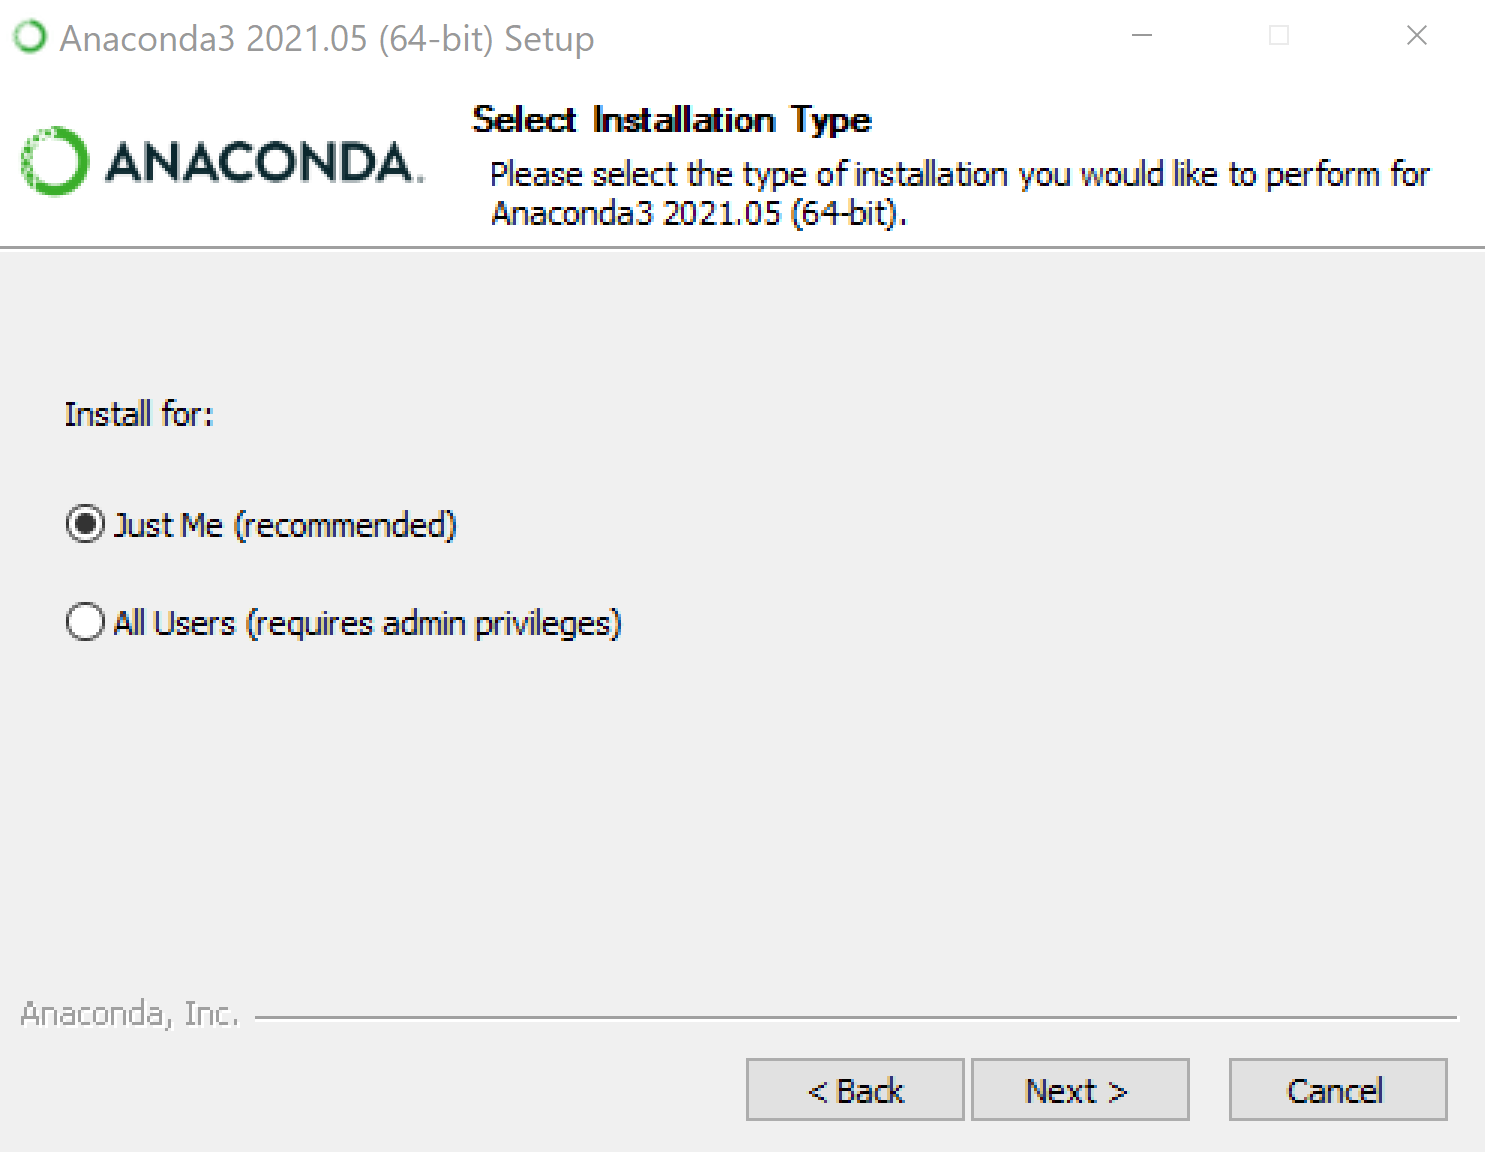

In [36]:
#@title Install Anaconda (2)
base64_data = "iVBORw0KGgoAAAANSUhEUgAABc0AAASACAYAAAAtYmWKAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAALEoAACxKAXd6dE0AAJivSURBVHhe7N0NoBx1eS/+Jy+QhPCSBHwBpZiESMVoJQi9hdbWxmAB22Ib6Ju3oNYgtmpuNa3ci719QWlLbYNeRWJbsb1t/xJa6QtgibG3rVAFCVVjKkISfAMUyDm8JyEv/5k9zzkzG84ku9k9Jwl8Psd1vznZnf3Nb2bnkOfMPDthZyEAAAAAAICYmPcAAAAAAPCsp2gOAAAAAABJ0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIiuYAAAAAAJAUzQEAAAAAICmaAwAAAABAUjQHAAAAAICkaA4AAAAAAEnRHAAAAAAA0oSdhcxjpu0lJgzdld8rvyYMf6NQ5gkTqj8DAAAAAMB4cqY5AAAAAACkcTnTfFetl5wwdN86szxH4CxzAAAAAAD2pX1SNO/GSGEdAAAAAADGWF/bs/S7/l4ur/W1f9f1AQAAAAB4huj7meZthe7aCeLbd2yPHTt3tG5P7Xiqddu6fWtMnji5dZs0YVIcNPGgodukg/JZVSHe2eYAAAAAAIy1vhfNhwvj5dfwosv7bTu3xbYdxa24f3zrE/H4tsfjiW1PxpSJB8fUyVNjyqSD45DJhwzdDjqk9bw6xXMAAAAAAMZaz0Xz8qzyCbVTysszysuvskBeKhdffpVnlW/dsTW2FPcPb3k4BrYMxmBxP33yIXHowdNbxfIZU46IIw4ubsX9roaXU76WwjkAAAAAAGOhL2eal8XsHTt2tO43b9scW3Zsad0Pt2EpbzuKlynPPi+L6g8++VA8uPnB1v2kiZNiYvk1YULMnDKzuM2ImVNnxmEHHxaHHjQ9DjvosKEWLhOG2riUFM0BAAAAABgLfSmat84u3zl0e+ypx/L2eDy57cm8bW6dIT5xwsRWwfv+x++P7z75vbj/ie/Glm1bRs5AP3LqrLwdGUdPf37r9vxDntc6C33a5GmtW2l4yIrnAAAAAAD0014Vzcun1AvWZSuW4TPKB7PtStl+5dGtj8ajTz0ajxT3B086OA6aMPQhn9957Dvx7ceLW3Fftmp5eOsjrec8Z9pR8ZypR8VRxf2LZxwf8/J2+MGHtdq2lGefl8rX16oFAAAAAIB+2+ui+fCHfZb3jz/1eOvs8vL+8aeqD/kc/lDQ8gz0gyYeNHL77hPfbZ1lXp5tPlJk3zxY/N3kocdMOiiOmX70025HH3J06++0agEAAAAAYCzsddF8286hs8vLD/gszyrftHlTbNoyEE9tHzrjvPz+IQeVbVWmttqrlEXusiBeFrwf2vxQcdsUDz75YAxuHTorfaB47mNbH28V3B/b+lh+IOjhrfsXz5wX846Y27qfNmlaLlerFvphIO64dmXctqnMs+KUcxfHSTNbfwE8kwzcEdeuvC2G3uqnxLmLT4re3+oDsXH16li1flPMmntKLFzYj2UCAAAA+1rHRfOyHUrdlu1DH/a5ubgve5Tf/+R3477ivmyZMqzVbqW4le1WymJ5WTSfNGFSPNJqxzLYastSFss3bS5uxX3ZtuU7j9/batsyfDZ5+fgFz3lFnPScHyhur2gV0g8/qLgV96Vy+H1t1VIvrCiiPguMf9F8YGBj3LPm9lg/sCk2De1oQ2bNilkz58bJC06K2WMwhvJ116y+PQaKF61etnjNWTPj5IULitfs7kVHXV6xDnPnnhwLTprdcfGw3+N6mnxPFxs3Fvd54/Y+B/X9rwNzF8WShbPzD32ycXWsWLW+FecuWhJ7WvzI/ru+vr3K1Z4VM4v9d8FeFo43rl4ROYyxWc+xKJrX5q7Uyfw1qo2vp+V0YmAgNt6zJm5fX/zsbTsIlcr3XrS25ZwxOhYBAAD98eCDD2bqj6OOOioTzyQPPbQpvvCFz8drXvOaOPjgg/O73dm6dWt85jOfiR/8wf8WRx5Z/KPxWWDSbxcy71GrMJ1f5RnhZfG7LHaXvcs3b9sS23dui0MmT4vDDj40jjj48NaHes6cOrPVk/zgiQcXt4Pi4EkHtZ4/uchTJh0cUydPjekHTW89pnUG+aShPw+fSV4u99CDp7d6opd1+/K5ZR7ub14aLpb3o2g+8LWb4/Z7n8w/PRmbp8+JE48eGgvPRJvj/nXrYmiTT4sXvPTEGLvNXRZI/zJW3b4h7h14Mp4c3s2GFd94cuDe2LDu9tg4sZ/7XfW6A+Vr5HeHlOMYKF5zXdy+cWLMOfHoYhb2pFje6utj1ee++vTlFX8euHdDrLt9Y0ycs6e57Pe4dlWeBXx9rPzc+tayp73gpf2d077MQX3/68CsuXHynH5WMTfG6pVfLNamrCOfG697yW4GO1A89vqV8bnh/Te/PezJcr0HNsf0Pa7zaDbGms8U+0H+qf/rWdh8f6xbd+/QuKe9IF66V/vULgY3xu0bRkZdDPvk2OthTzs6jp64MdYVO8PAhk72nb1QbMM7blkd//i522PDvQOtbfZ05Xuv3Jb3xoQX9LA+AADAmHviiScy9cchhxySiWeS//f//iXuve+++Na3vx1z586NSZMm5d90piyY/9P118f3HnggHnn44Zg3b17+zTNb10XzYY9seaTVYuW7T3yvdbZ52bd80sRJWTA/ImZNnRUzpsxoFcMPPejQmDJpykh7lvIM8rLwXbZuKQvkR0wpHj9lZqvgXv65LIiXr7V5++ZWv/Oy4F7asmPLUMH8oMPiyGlDv9XoZ8G8LNzc8o9frQo3hSfv3RKzTp7jkvtnrPEsmtdfqzwbeX4c/8qXxkuLA9aRxf67eUJZxGo9sNjv1vWpcL4xVq/4x1g7UhubFbOK151fvu6RR8aEzZtbRd+WJ++NdXssUJeF6JXx7+uHFzi0vB8ulnfkkcU6bB5ehyfj3nW7K/z1e1ztBjaujutXfi6+OjDyAn0smvdrDkr3x7rPZbG4PEP9mGNaZ2w332bHnD7uoOV6fHGoYh6vWzi7eX5bZ0H/e624X4xl7jHF9npla/+dW6z3hGnFrVjWrL14Dw3csTo+V//NwYFSNJ85M2YN3h8biv2sbM9y+oLeljnt6KNj4sbyGFHsO/fv7S+LGuQ2XF97T7S246xpcUy53xXHoAnTprUV0nv6JQAAADDmhovm5RniZcF7b2/DyykzzzzHHXdcq2BeXmncbeF8uGBePresS/zET/xE10X3A1VX7VnqRfNvPfqt+EZx+2ZxK88eLwvb5Yd0zpwyo1UsL29TJ01pnTFeFsw7UfY4f3DzQ/FAcf/lB78SX3rgy/Gl4r4svJeF+LKY/srnLYiTn3NSnFzcT5wwsTWmsmBeH9teq11qX+4Iw5etj/ml8uxD5dnO49WepTw7eU3MWLCwseXBwB3XxsqRXh19GM9Iy4dZMfeUhpYh9bYVhfKM46Y2Jm3jG7XFxVBBeaRjRVMbjD6Pa0jx2nesidtvWz/ynLo9P78zfZuDlvKXB6ui9dCxaEmyOx23ZamNsTDrlEWxsIv2O3u0y3ZuOVDas3RhYOMdcc+G9XFbnLz7dauNs1/77K7bsPylxKKFzcehVvuWNatjcE5x/BmHXbLjuQEAANoMt2fpta1Kv5bD/mvX4vfrzj57j61a9uY5zyQT836PyqL09h3bWx/wWfYyf/ypJ+Kxpx5rtWgp/1wW1cszycszwcsieVkwL3NZ2N6dVk/yvA2dRX5oqw/686Y9N46ZfnR832HHxuEHHx47du5o9UEf2DzQ6oX+8JaH44liDOWHjvalYF7YWPyjfcismHvy3OL/h6zfsDET9GJmnLS7QlVh5kmLY9Hc/ENsivX31K972FtDxffGQufMk2Jx9aKxaf09Mfqrbow1IwX9ubFo1KLjzJi98Nw4ZfjNs+m2WNP49unXuAploXHFylhVL5iXhcFTquf3R7/nYF8ZiDtuz+PdrFNiwW7qlBtXV8XWuYvKIm4fC+aFjWt2KZg/ExX75+pVt8Vt6ztY02K/L378tGy6bU2xx/Vu4I7bawXz8hcGuz8OlWfQz144PgXzruYGAACAvVIWu8ui9/BJwmUxvCyKN3m2F8xLHRfNS2ULlrJo/sS2J1o9zcte5g9vfbjVnqUsag/1LT84phS38gzzsog+sfgaLooPa/25+CqfM5SKrwlZND/4sDhq6pHx/OnPixccdkwce9gLWh/+uaP4KvunDxavN/whouU4tu3YlksdWm65zPLWvY1R1cznxotmvyjmVlXzvhQuoBOz5/Sz0DsjTu7kbPXZC2pF3vUxaq1+44ba2cYLormeNjNOGq76FUb/pVMfx/U05dnri4YKgzPyW/3S1zkoDAyO/CJg1qx+D3Y3Nq4Z+fDRuSfv5ozrjavbPpxzYb8/FXJk+bPilEWnjPyi8tlu9oLhuVgft9/R0U6/W4N51VRpt9sbAACAZ6xOC+cK5kMai+bDxey6shi9dcfWeLJ1pvnj8ehTj7WK12Xv8fLvhnuVl2eaD/cwL880by1nQm2ZZc7C+fBX+fyhM80Pi6PKM80PKc80L4vmx7YK6eVjBlpnmg9m4fzh1tnu5Znmw6qlddRxpk39TLyhosLMeFFVNe9L4QLG3czZuz+jdMTMmLGHx7VdifGiPTx49pwYKRnXCsMj+jiuEcWBvDwT+twluzl7vUd9nYN9aGQ99nSW+cj6lu08+n3ace1s97knx0nj+DuD/V79bPPdXWHRkYEY9OMLAACAwp4K5wrmla7ONC/P6t6yfUvrDO+yMF22YJk1dWYccfDhrRYqhx40PaZMnNIqnte1PqSzVSvP3uNlzj7kI3/O+2HlGetlq5byrPOykF4W1Evbdm6LJ596stUapizW188033sDcc/IpeFzY07Whma+qGrR0nvhAro3s+OK8Vjb5UqMPQ5rRlnDHtLxGeI9KFu5LF7cOhN67GZsDOZgcNP4tyYZuCNGOrPMfVHzfNUeF3Pn7Oas+r1Tfvjn0NnuY1GQP/CNXHEyHu8fAAAAnjWaCucK5u0m7Kz3TakZOVs7C9ylshVL60zv8ozv4ja4dejM77IH+dDtOa3C+aEHHRrTi/th5bJaRfFRjJxxXtzXP9Dz/ifuL27fbd3KDwX98oNrW7eXHfXSePlRL4uXHfnSOHr681t9z59/yPNbzynPVh8e96QJXXySa9kPefgD4to+gG6g+w+JrC+r9mFzAwMbY83q22N9seMNmzVrbsw9eUGc1GHLg+EPS1s/sKnYgfObheHlvKirguFAsbx7Ys3t62OgWFhtVMXyZna2vPLD4u5ZE7evH2i9oSrVMva4bmM4X6Vyzsp1rC+nWFDMnTv84ZPdbeP+boPRbVy9ompZ0ck+1xd7mIfG90izaj3Kp+zth+nuxXuwrv7hvr1+qOJYzEHHH8bZP9UHme5hPsdybLW5HNkuezG/XWk41gx/6OXt63c5Ds6dGycvOGkPV0TUP2BzbixasrD65UJt/navaTtUy+51393zh9f2oDhW37GmOFbvOn+7+xmwl3NTX49O9sk9vv/GZJ8AAIDx44NA6cWuRfKSgnmluT1LWczepZ4+fKb54yNnmk+NmeWZ5lOOaJ1pXhbKy7Ysu55pvjvDZ6EPaxXQi6/WmeYHHxZH1s40L79fjuHJbU+2WsOUvdSf2l61Z9lbA/dUHx44d/g085Z6i5a9/1DGjauLf+ivXNVeuC1s2rQ+blu1Mlas3hi7XfLG1XHtihWxMj8sbZfFjCxn5bV37H45aaC1vOLxxfLKMe0yqpHlNX944UBrnVaszA9e3HVAtWWsuHZ1dNvZpuf5Kg1sjNXXDs3ZrsspFhTrb1tVzNfq2Njp2Pq8DZqU22a4yDPrlIXdFYh7Mlit02hnUdfOiO609/aMPOD2Zg/jGk/7bA76a6S/9R7ms96ape2w2LOBuGN1VahcOH47+dOUZ7tfWx7H2oqjpeLP62+LVStXxLX7rDVXdaVCr1c61a+aKj+Yttfj1JDhnwOrho6J+d0hxZ9Hfgb047XGT0f7RPEzCABgPKwo/g3azxtA3a5nnCuYt+uqPUv5oZ5ln/IpWcAu+5o/9ORD8djWx1q9xcu/L3uYP0177f1pWmeY59nsbcqz3MuvLKzv+piGk+S7NHprlmG9tmgZvOPa1j++o1jK3FNOiUWLFsWiU4pl1mtp61fF6t0UZsriVfWP9/Is6VPilHI5i4r7kaJ+oSyG7OEf862C9KqnL681rlxefWhPVxajhwoKw1pnWZ9SPr9ct1OK5dXHtD5uW3ltx4XzfsxXa4ytonv+sVCeITg0Z4uKdcxtWoxt1eo1uxRGRtfPbfB05Vn/dxTzOrRtSrPmLurtrOgu1Xv6x8wZTzsLdWAvmiLXW8vszfNLexrXeBqLOah/b/2qXf6jttgfrl19R+e/2OlIrcXMbuez1ge7ePMN/Yqg3E9Xx7XFuOrjvLb8xVgxyE6HWbVlmRWnLOzjGc/dKtZlZflLvyKWx7BT8hh2yi7Hm023rdy7wvmMBUPHr/JWLjO/Xf6iYOT7rdvJDb+8qP3StvgPl8GhtHdmnhQLRz5Rt1Aep1ZcG6v3eucaugKk+jlQnoXdfkwcebXRivQ9z80Y6XSfKH4G7btfpgAAADAeGtuzlK1OSiNF68IjWx9ptWh5eMsjcd8T98d9jxe34n72YS+KOUfMjtmHvygObhXVp4z0IC+VLzFqUTyVf19+1bVawGweagNz23e/GLd97/bW7SUzT4iXzPr++P7i/vsOO7a4vTCOPfTY1nP2qj1L8Y/kkcvER20JUG8P0XCJd139cu9UFkAXFk/a9d/+bZfM73ppf03rEvOB4h/wHV3q3txyof31ZhXrsrBYl9EqEgOx8Y41MThjYfF6+a2W9rkoz1RdtLAY86hFjV0e27R+fZ+vXcfY1IqgXMfVsaoaYKF57vq1DVraHruLslDTZQua3tVbTIw+9m7bIrTU1nPv2kvseVx71PMYKmMxB+37dLOyILmwHwXm2vtt9/NRm/vWe2hGrLm2/RdRT7Pb40Ha3XzUjwWjHot7NMqxZndj3vV4Ofr+V99Hm45Jhb1dt5H52sv9fxej7m+zip8FJzf9LBhdve1J0/G6eLW2Y3Hj/tbF3HT7HuyqPcuwnvcJAAAYP9qz0AvtWXavuzPNJ0yMyRMmtwriZYG6PNP8wfJM86cei63bt7YV2Ftl8LIY3oezwdsK7kUcLrL3Y9lVC4LiH9Wj9iCYGSednB/IVli/ocuziMv2A6MWFMqT/xZGdfLf+mhcdKtoVRawG/51PnthLBoZYkMbmYE7YvUu/9hvLpLMjNnF2NoL5oWNa9qL4MWYmussxbwtPrdt/W7v5My8XuerPsbGgnmpXMfFtXnbg35sgw4Mr974ncNYFraGi37lao5nS5jd2V/H1V+DxX44d+7cUW4jO3pL2RZi5YrV0e01DLvT8YfMFg+7Z6Rg3n5G8a5XlaxaubsxbozVI5XWfduWZcjuj2Ezi+PDuSMHnE1xW3O/qrEzY/iM7U2xqadTzYeU67Tk3GK71Xev4j+I1g+30urkzPONVQupssi9uOF4Xe44Jy1eVMzykAPjw7QPgH0CAACgD0b70M96q5bhDwd9NuuqaF4Wqcti+fYd21utWMqe5ocffFirZcv2ndtbxfPN2za3+o6XBfS6pgL3cAF8WKvwXnyV7V4e3/Z464zzcrnln0uTiq+pk6e2PnB06uQp3X3g59PUWhUU/1hu7Ns7e87IP/xj/YYuClez9tB+oN4zPRrbP8w+ac9nmM6es/vqb71v+94VIAfijttHJivKs9T3cJJfYWactPCUkULwnosmvc7XLmM8uYN5W1CNb3f6sQ1G1FsTlJf+l0XSkd/oZW/0FZ23tNl77WeCtgpg+0Vlen8dV/+Vv5xauHC02+JYsmRJnLuo1roiynZCPRbpRvqyz4rdtmUfGKzeq+tvG9oW5S+OliyOxcV79KTZs2P27JOGxnnuoloRtmmM9V+C7Ol9Pj46OYbNPOnkvTz290mthc7etAcaVdmqZfGu+1Yhjz1lS6DdvVL1i+ZiOy7Y0wzOjpHDYrH8vfxd4rg5IPYJAACAHo1WMC/PKt+1x/mzvXDeVdG8VTDfuT227dwWEydMaBWtDz+oLJpPbhXKW0Xz7Vtafz+sLIjvKL6GSuPFV1kkr9/ye8PtYErlmeWtovlTj8emLZuK+ydaZ7KXyg8ZnTLx4Jg+eXqraF+e+b7XNm4YOZM15s7ZzT+Wa//wL57R8cnms/b8wYX1sz039eNUwsLTl9Pet/3kvSpA1j+Q8ZTYY61k2MwXVQW1PRVNep6vvRhjfXx9tNttOXNmzG4VHYduJ5VF0sVlkfTcWFQ/i7GLXvBdK9sSrKi1TthDW4Rxs7+Oax+ZOXthLD639oud9bePwy9TRtG60qKh0D1zdiys/XJstDFuXF1t07mL9oeWFp1+uGn1YZzlcbRfdev9QWvfah1z2ovnQ1c1NB17ar9o7uB4Xao+DLc/Z8uPHfsEAADwzNdUMB+mcF7p7kzz4qssbpcF8rJVS1m0Pqw803zSQa3vPdoqmg+daT6ibKcy/DVcJK99lXb9c6kskj++7YlWT/NW+5cdW1vPL88sL880n37Q9Fbv9LKIvrf23JqlUj+LeP3tuz8Tb2yVH8a3MTZuvCPuWL269eGR1167YqRP8KgG7ql6ERc7/e5OMG1UP/O0qw9knBlVnXuMiyZ7PcZu7cU26MhQy5glI31eNsVtezjrc2+UfXlX1Pr4tnoN7weF6f11XPvczJOi6hC1961/Snt7tvIer9rYZYxt7/Nd2nn0uklb+0ntg0hHv+3hF04dHwfH8fi1B/36pWq7oVZcreJ5228Py1/ajdJqp36MbX2Y6Ghz336r91Dv29nyY+EA3CcAAAC6saeC+TCF8yGNRfPhNin1fuJlG5ZDJh8SM6YcEdMmT2v9feuM8K2Ptz4g9KHND8XDWx5unSFeFr3Ls9LLQndZYB9e1tO+iu+Vf1/eymL7k9ufbH3gaNkr/b7H74tvPvLN1rJLR0w5vPXaRxw8dD/9oENaYxpWW2p+ZzcG7ohaJ49Yv2r0f/CP3OoF0XG/zHzoQyuvbY1lZaxctSpWrbotblu/PtYXO2/xv87tbTF5pK1DWVvoruxenWk4xnoY4571cRvsyewFVe/2vu5rxTqsrn2Q3ay5ccq5SzpqfVI/w7/Twlf9cbvvn7334xpPYzsHu1f/pd3YFE930Xac6OwM3PoYR9a7vHJg+NhZnq1+AP4SZNyOX/vUzJjdarVTb1c1Squd2jH22ezZsU8AAADPJJ0WzIcpnO+uaF4WuGsF81JZoC7P8J5x8IzWWeZlcXrLti3xxPYn4+Gtj8QDTzwYg1sebv25PDO8bNNSnpk+YedwKbv4yuWO3PKr7JFeFtmfeOqJVh/zBzc/GPc+dl9887FvtQrxZfG9LJa3CudTZ8TMKTNaBfx60bw0vLw9qff47l5vZ3t2ZWBjrF6xMlbd1j7ecqedNav8wMD8UL7qEzLpt3HfBvXe7Zv6dCZj2VO6WIfhSw5a7Tb27sM1Oy3aDo78JmF3/bP7N67x1N856MDIB0LuA8V+3u3Qh+an2LarqysH9nhmcu0qg1i/qvZ37Wc8lx8IfO655+7h1r99qNqGzwIzT4rF9U9H3l07oOK9Wv9shk5uJ3fSz+UA8KzaJwAAgANetwXzYc/2wnnH7VnK1illG5ZDDjokjhg+03zChNja6j1eFrofjgc3P9S6L88037J9a+vM8bLYPVwgbzL89+Xjn9j2RKsA3zrT/In74huPfLO1zLIOfviUsmg+dKZ5eV8W8MuieavtS3HrXL3Hd/Fv//KDGDu6VWWrPX+oZT+URafhD88rx3lKLDp3SesDAhcvXlzcyg8MzA/l6+Es1m51e6Zr3wqHXejf2bj7fht0elZzs6HC9MiJ3KecG0ua+lM3qRdt6y0aGtV7/dbbGdT1YVzjaUzmYHx1frZ7rW9z8f7t17upP2bGzJl7vvXf+B2/RtP/q2ca1K902fWXdvX3wMwZbZ/N0NFtv31z7619u08AAMCwBx98sKcbz2yf+cxnui6YD9u1cF4u69miq57mrZbjxa08k3va5Kkxa+rMOGb60TFrysw4ZPK0YmETWv3Hv/3od2Ldpv+Kr226M+5+eH1sfGRjfOex78QDTz7QOmu8fiu/d+/j98Y9j9wTXx+8K766aV385wNfKp5zT2zavKlVrC/bsDz/kOfFi2fMa71eWTAve5u32r7UivHDxff690bV1uP7lFhYfhBjR7eTo2rbu37sW7RsXDNSUCx7AS9eeNLeFR3qrRbWb3h6n9pOdF0wHDaOhcO9GmPtw0NH069t0INe2nqU2j+E8dy9a3vS9oGunRRRa/Pa8CG7fRnXeBqDOehY31sP7ekKhvrVDt1/2OHwGGeM+svHptvIu7dcQNv3911dsvbBl/viFx9dHWvHQf1nyT4e255/mThWH9K5j/cJAACALv3gD/63OOboo7sumA8bLpyXyyiX9WzRUdG8fhb3cFG6PNN85pSyaP78VvG8LJpPmjgpHn3q0fj2Y9+Jrz60Lu4cvCvuGrw7Njx8T+t7Dzz5YDz81MNtt/J75d9teOSeuHPg67G2eN6aB+4o/ryx9SGgZcuWQw8+NI4+5Pnx4iOOj2MOOToOP+iwVtG8LN6XX93auKb2YYNzX1QVAfZodiyomk3HbWv2qvzcsXpRYE+Fst0XEGpnjcb62LA3w24rGN4WHa96Pz6EtFP1gk6nv9TYuGHkLPLR9G8bdKN+JUSPZzLWPoSxPJN74V5X/OtF1A72odq8jvohu30b13jq8xx0of6hxT39EqX2i6U97a8zXzQ3H9tZO6pqjLNibqsNx9CHTI7+C8hRbguGX68w8+Ta343B1Qd7c3wY6+PXaGq/LOn1l2d7Z9fjT/0KhHH4xfEu6nOw56uJ9vAL0V0dKPsEAADUHHXUUX298cx05JGz4qyzztqrgvmw8rnlMsplPVt03p5ll/YnQ0XzGXH09KNH+ouXBexHt2bRvDzTfODOoaJ5eab54/fG9578XqvVSv1Wnmle/l15Znl5pvnah74adwyfab5lIHYUX2UblvJM83mtM82PicMPPnzkw0NL5dnonaufJTZc3OlcVUgq7O1Z2323MdaMnA49mplx0slVn9r1q9p7BHemXjAslnH7HR2cZTjQ1tN47slj3XpjdlSfRdjJLzWK8dU/DbYne9oGXaif3T5rbvTSBrgqZM6Nk3s8k7u+7+9++9fndfQPkeznuMZTP+egY7VfMPS8rNovlvZYdKz9omzTbaube1uX6h+s3OM+Oz66Pz707fjVxRna1S82evnlWfkhxhs7fs2240+xxu21+vbPW7htdSc/B7qwp7mpX020h5+/A3fcXhW3O7IP9wkAAAD2Ox0VzVtnl5dftbYnkydObhXODzvo0NYZ50dNO7JV2D7soMNaxezN2za32quUBfSycF6eef6fD3w5br3/trZbWSAv/658zHef+F7reVMmTYmjph4Zcw6fHa846gdi3hHHxwsPfWEcOXVWHHrQ9Dh4UvtvRnYd2261nSW2F8Wd+hnXxZL26qztDrWdVXfbmtg4WjWh/JDKa6ue243a+tSuj1XXrh59eS1lkWV13LHLupUfwFedaH9brNzTMmrtN8o2OAt6O9m2I7MXnFIrqqyKa1c3FIuKeav3027Sv20wEHesLue0ccJaBjaujmtHKqSz4pSezrKt/YKoH2dEzjwpRn73Um7/Uee2fbvPOmXBKG1J+jyufhq4I65tffjktVGs3tP1bQ4KxWutXn3Hbt5Du+4PEXMXLeytzUv9F0t7LN7Wf9m2KW5b2fB+L+es9iGeB0whcXfHh+K7bceHXo9fbVfBdN4jfuTzIHr8RcRgsa4ri326tb5d7G+j7bszT6q3KSt/Dux+Hy5fcGN57Gt6TDdzs8vP31UN269cj5V7OriPZjz3CQAAAPZrE3Z29wmaI8oP7Wzddm6LwS2DMbB5MAa3DsaGhzcO3R65J57a/lTr78v7qZOntorhUw+amksYsmXbltiyfehWDqX82rFjRxw9/flx9KHPbxXijz302OL2wjj2sBfGwRMPbhXNyw8ALXVcLE8bV69oawuxN32UB+64tvoH+dxFsWRh7V/O9QJS8Y/qc/f0wYbFP+5XDA9o12XFxli9ol6MnRXlh5aePKcsMxZzvWF9rG+18ZgVp5wyM267rWk5w7K4W68lzBrqGTxnxq7LLBezJJ6+mF3HVCyiWMbMuXOKZZR/al9GS/H3ixY3FPv6Ol9D2rZPy1B/5DlPm7fyJRfF3PWrshBSzOO5i6N9l+jXNmgvuLTmbGYx7+VyBovlbFofA8Vy2ka9l/vniLa5Leagqw9HLMa2YLT+7U+fj3JuZ80p4oZNxVysr9ahaT8ck3E1qO0ve57PXYpiUey3S0bbb/swB6W2YnO5jJnFdMyJGeV+NRb7Q6reH6Pt709XP2aWyn13bvF+nxEbYsP6geJ4Uo2ypzHW52N387a32va7Yh2KLTh0GBh6T88t3ovl3A8W7+nb8vgwpGk/KNX3hd09bteCa7m9T24dMwc3bIhYsHCU7VBbdk/zset+PaT8EJfhD0wdGBiI8gNd2uzueJzF9fozRvaLkZ8Dm4rlFo9pPWh3+1qXc1P/GdBSPP6U4vhevvBguU/mdi3Gf8rM24ptOfSoUX+ejck+AQAAwDPBpN8uZO5YWdgue4qXZ5uXBezyzPLJEyfFQUV+eGvVcqUspj+w+cG49/H7Wr3Lv5ff/85j1e2+x+9vff/BzQ+1CuwTi69DDjokvu+wY+P4I+bES498aatYXhbPj5x25MjrlWPo6gzzlo2x5jMbin+il2bF/NNPjqOntf7QlWlTt8TGdffGk+UfBgZj4pwTq+Vsvj/WDf/dtBfES088Onb7EoMb4/YNeV5b8Y/2k+fUqwMzY86cidVrFf//5MC9sWHDhuJ2bwwMlN+dFXMXLY7Tpu5uOcOK5Z04JyYO3h/3tp5beHIgBu7ddZlDZpWFi6ctpljGye3LeLK1jPL5oy1jUbzudQvi6Pzz0/R1voZMO/rEmDNxY6y7d3gcTxZjevo6DhX4psb969bF0EOnxQteWtuWLf3aBptrr5NzNrycYv7L5eRftZ57yg+/Jha+ZLRt2IX63D5ZzkH5mp3eNseRT5uLUjkfs2Lw/uJ9NLTg4rH3xr3FXNxbPG94HVrbfeHs0bflmIyrQW1/mfaCl8aJu31i+zZqbddiX3/6VujDHJTq89BaxkDcW76Pdt0fWvvX6+J1ve4PqTp+PRmbp8/Zw5wUazvn5JhVzOOGoZVt7btD4yy2R7H9hpSFy2KMe1swL9Xno/EY1oO2Y83x8ZrFp8f0jeX2HnpP35vv6ZFjY6kYx6LXLYzZjVM0GBtvr36mjL6/lKbF0UfXjiPlfp/HzHsHJoxy3ClsXBOfyX137itfM8qxuFObY/N9949sv2FP1t57Za4bOm6/pGFdCjOL/aY4Lg7eX+yr+dSR/WLk2Fgud+jvYtYx8dI5xdyMOo9dzk3x2vX9sXhC9TOstU8W3yq32+LTYurG24vHDT1q1J9nY7JPAAAA8EywV0Xzslhdt2PnjlbxulXM3rmzVUw/7OBDW+1UZk2Z2Wrf8txDnjP056kzW/fDt/L7ZUH8BdOPidmHvyjmzJgdc4+YE3OOmN06u/z508uWL4e2WsGUZ6oP675gXp5Utjo+N1wRmzU/Tj95DwXaJtOmxpbWP6zLP+xSeGr7R3gfisDTjo4TTy6LBPfH4ITiH/Ij/3Yvz4T74Xjda04vXrv4YwfF5CHT4ug5JxZ/PysmbhmMzW3LLJ46a1YcM/+H4zWnv2ZouaMaWkZZOJw+yjJaZwrOnx+vPP11cfqJM3e//v2er1QWzkfWcaAYX35/aN7mxw+/phhbq+pRL5SOVjQv9GUbFHN24skxZ9bE2DJhc7Hv7jJn5bJmHRPzf/g18brTizGMXl3qTn1uu9YwF6VpQ798mTNrS9w/WCuM5Tr88OteU2z33WzHsRrXaGrbZM9F83rxbqhQvaDxbdTjHJSK/eropvdQbX84/TUnx4n92B+G1Y5fT26eXqzHno+DM+vHjPr7qfVeL48XxXug1ypifb/Y7TFsLz3tWDM7Zo+6DcvVmjvyXtz91HdaNC+Ux5FiDgfvH6z9sqF8rWOKY+nTC8ob13wmC75z45Wv2c1y92ja0PYrj2ETp8eEaaMcf4rtOGtasb/Nf2WcXuy75dzvcWsW6zP0HpgeWwY3t61TqfWz5Jji50BxfHzNyXuYxy7nplyf8ufPluLxE4rHjzxjeH9cOPSL2sGuiubD+0R5nB7sYZ8AAADgmWCv27PU1Vu1DGweiIEtZbuWvN8ydN9qwbJjS2zetiWfNWTq5CkxZWJxmzSl9YGiZYF9xpQj4oiDi9uUw1v35dnlw21ZSt0WywGoGWlx0VmLFsZZrW1Iv9ryMIq29iwdtAcDAADgWaPnonn59HoRuzzrvCygb9+5vfVBoA/l7fGnHo/Htj0WjxX3deUHex46+dCYXtwPn4k+q7gvz1afVH5NnNR6XPk6e9eSBYB2/eqXzVio+sjrnT2mFM0BAABoMDHv99poBeyyTUvZ87xsqVKeNf7cac9pfbBn2ad8zuGz227l98q/Kx9zxMGHxyGTD2kVzMve5rsuW8EcoB9mx8JFc4fi+tvjjmxhwX5g4I64PT+8ctYpCxTMAQAAYB/ouWi+q7KwPfTBoJNbRfOyvUrZt/yY6UfHsdNfGLMPP67tVn6v/LvyMTOmzGg9pzzDvFxGuazWGeZ5NruCOUCfzF4Qp8wqw6a4bfUd2ZebfW3jmurM54XasgAAAMA+0deieat9yoShonl5axXNpxwRz2mdaX50HHvYsTH78Nltt/J75d+Vjykf2yqaTxwqmg8vE4B+mxknLTwlhurmt8Vqp5vvextXZ1uWWXHKQq1CAAAAYF/pa9G8PDO8n1pnl5dfzjAH6L+ZJ8XibNOy6bbV2rTsS2V/7aGKecw6ZaEPZwUAAIB9qOcPAt2d4UV3erb4cNFdkRwAGFM+CBQAAIAGfe9pPqxeMO/mq/WcsavjAwAAAABAozE703zXonknshnLUHa2OQAAAAAA42xM27MAAAAAAMCBZMzaswAAAAAAwIFG0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIiuYAAAAAAJAUzQEAAAAAICmaAwAAAABAUjQHAAAAAICkaA4AAAAAAEnRHAAAAAAAkqI5AAAAAAAkRXMAAAAAAEiK5gAAAAAAkBTNAQAAAAAgKZoDAAAAAEBSNAcAAAAAgKRoDgAAAAAASdEcAAAAAACSojkAAAAAACRFcwAAAAAASIrmAAAAAACQFM0BAAAAACApmgMAAAAAQFI0BwAAAACApGgOAAAAAABJ0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIiuYAAAAAAJAUzQEAAAAAICmaAwAAAABAUjQHAAAAAICkaA4AAAAAAEnRHAAAAAAAkqI5AAAAAAAkRXMAAAAAAEiK5gAAAAAAkBTNAQAAAAAgKZoDAAAAAEBSNAcAAAAAgKRoDgAAAAAASdEcAAAAAACSojkAAAAAACRFcwAAAAAASBN2FjIDAP12940ZIi48/6xMEStuybAbpy25IVPEJ646M1PE8Xnfu9rYJtTGFksyRdyw86pMEdUIGHbjhRMyRZy1IkNhyQ3Vf17VNh0jOtn3zskUcZ39c/929xUZIk6ftzRTRAeHud2wnQEA2HecaQ4AAAAAAEnRHAAAAAAAkvYsANB3d+d9xBWnz8sUsbTWq2DJDXdlam/fceOF1ePr7T5OW149/uZ39qtByzOpPcu+WZcDsz3L/rDd9+f2LN3OzzPpfTR2tDICAOBA4kxzAAAAAABIiuYAAAAAAJAUzQGg78pWKkO3dbfEyC1a7RqGbuecefzILaK6nXnVzpFb2UFt+Fa2ZBm+AfuTsqfI0O2q4r06fNu586qRW/UIAADgQKBoDgAAAAAASdEcAAAAAADShJ3lNd8AQB/dnfcRV5w+L1PE0laLliGnLbkhU8QnllWPOf74Ttqv3Jj3EReeflamiBW15Tdpe92rMhQun1BbTquFzJAbdlYPOrNvr1s1qTi+PlcXnp+pmKsOFnrakuWZIs6LpZnK52Z4mqb12ns3XjghU8RZtdddckO1vnFWfW67U1/HT1z1zkzFvN14YaaI02sv3Dhrp1XLWT6/h7m68YpM5etWy+lgF2gbw103vzjT7va9czJFXNfJ/tmnsXU/P12O8+7a++j8occ37+6n5X25T30iU8RVZ5btn4Zc2Paa3Wncv/K+n5rfK9U/RWqHhuIwWtue8+rbs2n7V++JCW0vUD1+yYrq+53NVW3+l9fmv61N1lgcFwEA2NecaQ4AAAAAAEnRHAAAAAAAkvYsADCmqvYjN15xeaaIS6+pmgPc0nAZf3vrhLMzRVzf1vKlah+wvNa+4Z21Ngc3Xlg9vt614LTl1fLnL63aH7S3lViWKeLrfXvdqiXBeddU7Qza2tfUHvOJs6vlxPVVC5d59Sc0tmBoaOWQ973qpT1L0zpef3ltnjuat9G3xYuva5r/TrZ7f+bqxgtPz1SOodpenY2hy7Yned+p3sZWf91ae47GcTa9j4buT1tetVu5+ezrMxXLq7UlWVFrFbL8rksyRayb16/9qzaGtvYj/dF1e5aaTp57znXdvhcbjmHzaq1v2ua2Pv/V4+P8+vbs5bg4tvMPAEB3nGkOAAAAAABJ0RwAAAAAAJL2LACwr91dtXe44vyqHUB7u5KmlhE96KilSVOLjB6MSSuVTlpk7A/tWfY8nruvqNqG1FvQ1Ns3XLKualNTby1SPCrvi7TkvEzF45dV7X3OPL7WfqLbuarvq5dfminimtoY6qNpMibtWcZ1bPX56WTf2/26dL8vdDvGSif71/7WnqV4cobiHy9tPU1q+3utz9UtXcx9qX/z34Ml1TFjZ+NEAAAwXpxpDgAAAAAASdEcAAAAAADSM7ZoXnadGb4BwH7t+DNHbu+8ZMnIre6WdetGbu3Kxw3dbih+5g3f6j8HG29XnTNy696+el1KZ15188ht5867Rm43LD9v5DZ/7dKR21nz5o3cJlx43citM3eP3Mr2QcO3pStuGbnNv+GukVt9W9+1/LSR29jYn8dG35xZHCvyVh15CmVLlryVzVOGb7GkeGzeykYnw7ex18tx8cyRGwAA+54zzQEAAAAAICmaAwAAAABAmrCzvB7wALBjx45MERMnVrX+zds3Z4r48Ff+KFPE7Q9+IVPEzCmzMkW8dNYrMkW86uhXZyq//wOZikkpvgBgr914YYbiZ8pZKzIVTlueIeKGT7wzU8SZx5ftJYZccfq8TBFLW30Ghiy54a5MESdeOvpjTlt+Q6aIT5xdPeauy6vcPpxqPPOXLs0UsWKo8UHLDTuXZYr4esPYun/d6vHnXXNWps6WGdefnyFiXtsEVWNesqJ6sfZ1uSpT/1o13Hhh9d8M9XVcckM1/jirWsdOxnP3Fadnal/H5u1Vqe8ny75+eaZyOfXBdTtXN2aKuHBCfV2qtibL77o5U8Q7a48vW6UMa9++nex7Vfue69pet5PHjPXYOpmf+uN3/z46bXm13W4++/pMxfLm1V+/vk6XZIpYN6/pNbvdv2pjeOfxmfqn+b1S/VOkk84kTcsp1iDvd9nmx3ew/97wiUzF4+dV83Bh29zWl189Ps7v13FxbOcfAIDuONMcAAAAAACSojkAAAAAAKT9oj1LfQgbHvl6poh//MbfZYo49bnVJZH/8d1/yxTxnKnPyxTx0y86L1PEVeuqS2tv/ObfZ4rYuuOpTBETJ1SXdx47/bhMEecd/8uZIn7smEWZImZMmZkJADpz9xVVq5bzay0yalfx76L6ebdkedUC4Kq2y/VrLSZOvzRT2RqgeanDTltSaxlQdW+IyxvbSozehqK31616MBwftdY0F1atV5au6GSZ1c/6T1x1dqaI6xvayBQzmvfNrSu6Nb7tWWrtG15ctV45vfbCjbN2Wu11P1FrFdLQWqJxrmqthzp63Qb9a88yFmOrtl1T+6D2+elynPV2LqcPPb55d68dD2otRK46s9ZCpKPXrBzo7VmKFchQbOda+5pbau2v7rq5an91fGP7nE40zf9YHI/rx0UAAPY1Z5oDAAAAAEBSNAcAAAAAgLRftGfZsXNHpoj7Hv9OpoivDXw1U8SxR1TtU975uTdnijhs8uGZIpaf/qeZIu4cXJcp4tLb/2emiM3bn8zUbkLxNWzyxMmZIo6fcUKmiHe97JJMES+Z9bJMAADAeOi+vUxTe5Y9t7IBAODZy5nmAAAAAACQFM0BAAAAACCNa3uWLTs2ZyrboVT1+t9bc3GmiGnF17A3nfi2TBGHTj4sU8S3HvlGpoj7t96bKeKEw0/MFPHuz781U8TAloFMEZu3PZEpYuuOrZma1du2PGfa8zJF/NYrfz9TxElHnZIJAADo3d15H3HF6fMyRdQ6spQ9WTJE3HXzOzNF1JuzaM8CAMDecKY5AAAAAAAkRXMAAAAAAEjj2p7lL+/6WKaI//a8H8kU8cdfel+miHWbvpwp4q8XXZ8p4pZ7/1+miFcffUamiKOmPzdT2YZlU6aIR7Y+nCni4acGM0U8+OT3MkX823dWZ4r41/tWZSrbtjyVqTT69Lzw0O/LFHHZqR/MFDHniOry0f1B0+adMKFqO9OL+vLreeLEZ87vY+rr1a9568VTT1X7Z32eJ02alGl8bdu2LVO7yZMnZ+qfZ8P+BgAAAMC+pdIEAAAAAABJ0RwAAAAAANKYt2f52uBXM0X8yZffnyni4pN+N1PE5i2bM0VMnzI9U8Sxh70o09i3yPjP730xU8T/um1ppojBrQOZ2k0ovobNPqL6jP4Vr/rrTBHTJh+Sad9Z8defzBSx/pvfzBTxB+9Zlqk3f/o312SK+M53q9Y3733H2zL11jpj+/btmSL+x+9W+8+WrVszRbxryZsyRbx49uxMvfnIX/xVpoitT1XtR5a++fxMY+PRxx7PFPGvX/hCpuK986dXZ4q4c8M9mcq5rfbDnz5jYaaIX/3lX8oUcfxxx2XqvmXKk5ur9+aX1n0tU8QHPvbnmSK+8J9VS6X6eBadflqmiHe++YJMEfNeVI1nypSDM3XmL679VKaIa278dKYi/5/lmSIOmTYtU/fq+9vHavv2HV/9r0wRZ//4j2aK+KlF1Zzf/8ADmSKu+PO/yBSxabBqFdVkYu2Y9qJjX5Ap4rWv+uFMxbzNro6H0w8Z22PLXRurfeyi//W/M0V8+i/+LNPYtN8BAAAA2B840xwAAAAAAJKiOQAAAAAApDFpz7J9Z9Xi4GsPVu1Zvjy4JlPES2e9PFPEA5urth7Pn3p0puIxR/5ApvH1lQf/M1PEb93+rkzFOJ/4bqaIncXXsIMmHpQp4l2veG+miJ887mczja8HN1UtZc55S9Um5dv33Z8pYtVfV+0+6u0yuvWBFVWbjt/94P/JVMzDW96cKeI9F70lU8TBB3fXjmPw4UcyRbzwv70qU3u7nqs/8AeZIs49+ycyda/eXuOHf/YXMkW84PnPyxTxtx+t1vGoWTMzdW/Hjh2ZIv5h1epMEX9Um8//XFe1BNnR8DadUNsPd9ZaBk2eNClTxBsX/0ymiN+obYv6etV95Wt3Zoq4+A//OFPEv37+1kzt469raqNUb9Fzxo+cniniDy6u2gQd38F++JG/rNof/cb7/zBTxPmLX58p4o8veU+msv3LlEydqbf9Ofeid2SKWH3zLZkilvzCz2eK+JP//T8zFce3/6rm7XVvXJIp4qHBwUydqW/pSbV5W/Cyl2aKuPAXfi5TxM/95FmZisfXtnu36tv09z70kUwRl3/0TzNFXPPhqg3OWT/+Y5kAAAAAnlmcaQ4AAAAAAEnRHAAAAAAA0pi0Z7nn0fWZIn71387PFPHIUw9nijhv3n/PFHHKc34oU8T8ma/IFHHoQYdl2nf+9d5VmSIuufXXM7W3Z6lP4SufW63LFadXbQ3G06p/vzlTxM//2v/I1N564g/e8+5MxTY6/w2Zuldvz/JbH6haN0yaPDlTxO/+etXm4h1v/OVM7S07moxne5aPr/y7TBHv/O1LM7W/1t9dVbVnWVRrM9Ktm/7tc5ki3vjuizMV6/tItb719iYvPPr5mSJe+yOnZSreU48/mal9uw88XL3XnlNrI/PXH6rarZx28oJMEWvv/HqmiFf/fLWNnniyWn4xoAwRh0ydmili9rEvzBSxbXvVmumeb38nU7HvbdmcqVQtZ+YRR2SKuP36av6fd9RRmdrV27Mse1+13ev7Ur0dzRW/c0mm9vlsUn+PLH7r2zNFfPaW/8i0m/YstbY2r7ugas+yqbYt5h53bKaII2dW22Xr1qcyRXzrvvsyFc8drJ5bb9Eztdbm6AO1djQXnFute7fqr3Xm+b+SqX3fOO91VSuYq97/u5nKtktViyoAAACAA50zzQEAAAAAICmaAwAAAABA6lt7lm07t2WK+MpD/5kp4v/e9bFMEWseuC1TxM/O/oVMEb/2smWZ9m+/+flfyxTxufv+JVPZbKJq+3Dw5CmZIv7ujKq1y4wpszKNvXpLln9ctTpTu5PmvzRTxL9fW7W86KSFRV1Te5Z6K4/p06Zlinj/b74rU8Sbf25xpubXHev2LFufqtpinHdR1Uam3uqkvi4/+IofyFQ85q8+nili0qRJmZrVW5386HlVS5x1d92Vqb1lx+/X5uoXz/mpTM0eefTRTBF/8mdXZ4p46YvnZYpYfFY1P09urlqmvGlZ1WbkH2r7zBGHVS2SfuXnz80U8RsXVu07Dj10eqZ2333ggUwRl314RabimHDdP2Qq5qQ2hp957aJMESt+//cyRRxS23/q7VnefenvZ2pXb9XynrddmCni13/lgkzty6wbi/Ysj9e2+5Xv++1M7a1Omtz4//41UzHn7788U8T6b3wzU8Qxz3tepoh/+eRfZIo49uijM3Xmmn+6IVN7y6C65x51ZKaI1X/9iUwRc76vajsDAAAAcKBzpjkAAAAAACRFcwAAAAAASH1rz/LkticyRbzjljdnirjkFe/PFHHnQ+syRTy68+FMET875xcz7d++8L2qZce7b7koU8SOndsztfvNBVUrhp86rmptMRZu+9JXMkW85pfOzxSxffuOTO3q7VCu/kDV5uJnz3xtps500p6l7uCDD8oU8XvvWpop4tfOr9qV1I11e5bbv7I2U8SP//wvZ4rYtr3apvW5qr/uX33wA5kizjnjNZma/fHHqnYul/zRn2Qqll9rJ/IH73l3poi3/ffqfVFvOdIv/3X3+kwRp73+5zK1t6y5+Fer9ib/81ffmqn78WyvzefvffAjmSL+aMWfZYqYefjhmSL+6eqqncsPvOT7M3XWnqW+vaYcfHCmiGUXVseli2vrUre/tWep+/yaqu3Va36pajWzo7ZP/uTCH8sU8ckPX5Gp2bZtVVuteT96RqaIBx56KFOxrWuth+rb8cJfqubhj987ejsXAAAAgAORM80BAAAAACApmgMAAAAAQOpbe5bHnno0U8S7P1+1Lnnj8VUbhIe3Vy1Z1m66I1PEr7/8kkz7tw2P3J2pGPMtb8kU8cCT38tUTGjxNex1c342U8R7fuB3MvXP1loriZ/7tf+RKeKmf/tcprJdyZmZIibX2iz89T/8U6aI7zv6+ZkibvvHv8sUcdih0zM1a2rPMnXqlEwRP37aD2WK+PS//numsh3HYZkirvjt92aKeP1PLMo0Nu1Z6i0pXvfmav/8t8/fmqkcQ9WqYseOqsXN369anSni1f/t1EwRK6/8YKaIQ6ZNy9Q+zle+7mcytbdGOaI2Dxs/99lMxRxOqeZwLNRbo/zWB6pWHpMnV/vJ2lU3ZCr2k2OOztSbr3zt65kizrrgVzJFbBoczBTxkUur98v5i1+fqbk9y9zjvi9TxMteckKmiH+4qdpe9W3xhxcvyxTxll+oWtPsLL6G7W/tWerOWfK2TBGrau/3CROq34N++wv/liliRq31Td2fX/O3mSLe8Vu/myniec89KlOxju+t1vGX3lm1D5o0qXqtL//zP2Yq95NjMgEAAAAcmJxpDgAAAAAASdEcAAAAAABS39qzPPHUE5kiPvudGzNF/OXX/zRTxI+9oGp58RPH/lSmiNmHz820f/vO49/KFPGuWy7MFPGtx76RqWyPULVnOe3oH80U8Yc/+OFM/fMfa6oWNz97YdVKYvv27Zkirqm1DXnukbMyRSz8hfMzRTz8aNVa588uf3+miJ//ybMzNWtqz3L4YVXLkc///TWZIt747oszRXzhji9lipg1Y0amiA/9TtWq5cdqLVD61Z7ls7d8PlPET76p2o7TD6naqvzHp1Zmilj79aqdyJt/439liph68EGZyvYsH8oU8UMLXpEp4pFHH8sU8f0/Xo1t8JGq7cyP/OApmSL++S+qlilj7Vd+s1qXv/n7ql3PcS98QaaIdZ+p2rP0y5ObN2eKeMWZP50p4tv33pcp4teXvClTxO+9a2mm5vYsJ8yZnSli9d98IlPEe/+oajtz9bVV66F6C50PXPKeTBE/95NVy5T9uT1LvbXO/6611ql1h4pb/6FqvfLSF8/L1L7v/UKtrdO/fuG2TBHvfFN1fHj/b/x6pogfPe+XMkV88ctrM0W8442/nCni999TtXBhP3J3tZ+cXm3e+MTN78wUcXzec4CwTXfP/LC3bqz+23DCWSsytVtyQ/XfoVdVnRAZTdN7sfrPtTjfexT2Tr9+1vWynG6f6+czTfz87Zy5GjfONAcAAAAAgKRoDgAAAAAAqW/tWbZu35op4pIvVJf83/K9f80UMfuwqg3Lb59yeaaIuYe/ONP+7TuPfzNTxP+4ubocov79CbX+CD/2wkWZIi495U8y9c97a20Z/vhjVZuUHzr5pEwR13y4esy0qVMyRVzwrqolxT+t/pdMET+16MczRXz8j6r2F1OnVM+t66Q9yz23VMvfUWsds/AXL8gU8aX/+lqmso3MkZki/s/v/lamiJ/7tapNR7ftWbZt25Yp4q3/q2qR8dfX/UOmiJ98TbXuf/kn1f758GNV+5qzzn9Lpoivfv2uTBEXveEXMhVz8t6qBc1jjz+eKeKEV1djG3j44UwRp/7AyzNF/L9r/m+msXfhxVUbnL/8VDUPxz7/+ZkivvYvn85U7Nu11kO9ePSxak5Oft3rM0V8+777M0X8xlt/JVNxrPgf78jUWXuWm//u/8tUzP8TVduot/zmJZkiVt98S6aIgw46OFPE33zwA5kiPnT1X2Yqtsvnv5Bp/2jP8vsfqS7B+t0r/k+miIkTq210+z9dl6mYn7nV/Hzuttsztbegqau3dXrVqa/MVLwfr672z4v/sJqr7587J1PEpz5WtaJ6YW1fonen196D1R68q2rfu2HnVZkiznQp7DPPgbJNx2KcnSzzQN7nvV/3gaq15IUTLs0UceJdN2eKeGcnk/5sfl82aXqt8WzP0sn6et9xIOrXftvLcrp9jx+IrZkcH8ZQn37+PiuYq33BmeYAAAAAAJAUzQEAAAAAIPWvPcuOqj3L366vWih8ddOXMkW84LDvy1SqXvaiE3890/7troerFiLvvPnNmSIe3jKYqVRdPv+GE96UqX/ruHVrNc8v/4mfyhTxrXvvyxTx20t/LVPZSuK8TO2uub5qu/HO331/pogjDjs0U8Rn/urqTBEvffG8TO26bc8y5eCqFcZ/3XV3poif/7Wqpc/d36ja3bzohS/IFPGN79ybqfv2LBu/+a1MEa/95Wrb3f/Ag5ki/uh//kamiJ973egfL3zl/61af/zeh6o2FEccdnimiFv/4dpMES88umpP8SOLfzFTxJq1X83UPid33Pj3mSKOe8ExmcbGR/7irzJFvPt91RxOnFj9Lm3N9Z/KFPHiWguUXnzhjuqYcM5b3pYp4pHHHssU8WeXV/vkz//k2Zm6b89yyLRpmdrbv7zlPVWrln/7wm2ZIqZOnZop4rDph2SKeOChhzLtH+1ZXv3z/z1T+3weNn16pmKfv/mzmdrn4Y3vrlozffIfb8jU3ibok/+naic1dUq1f951T/Xe/JkLfzVTue2qljsfff/vZiq23U9V247enX56dWlo4+Wg9U9Sv/TETMW2OxAvhWX3DpRLhcdinJ0s80C+lNpl4OOvPufz1mWKuKTe5irvnxHGcx9req39rT1L3sMBpV/7di/L6fa5B+L70TFk7NTn9tnw87cX5mqfcKY5AAAAAAAkRXMAAAAAAEh9a8+yeXvVguCt//6GTBE/fnTVLuMVR74yU8Rl/1m1R/jzH6vaWUybXLUR2N9c/42qVcX711Tjr5swoWrP8oHTqsskfvC5p2fqzR//6cczRbz3j6p2KHWTJ0/K1D6euvpm37Zte6b27//iT/9kpog//cP3ZWrXS3uWurV3fj1T2XrilzNFPP7EE5na1derk/Ysf3DlxzJF/M7yD2VqX06/5u1Xfr5qifPB36n2k4+v/NtMEb/23qqFRd15tfGv+P3qE5EPOuigTJ156qmnMrW3W5k0qVrHe7797UzF/vlT52aKeKw25xf+UtWK5A8vXpapnKvJmTqzpdZW6Nd/77JMxbZb+XeZIp531FGZIv7p49V758R51cVuvbRnqfvO/d/NFPH6JVWbka9+/a5M7du07sJfHL/2LPUx/P2q1Zkifumd785UPGbHjkwRb39j9d75g/dUj/mvu9dnijj1pxZnithRe+6kSdV+Ut9nmjz11LZM7V5x4ksyRfz7tdX26mSZ7F5H7VnaPlX9ukwR59xVtWq5tOmy0rZL/pZmirgl74eclvcRyxs+qf3uK6qfd/OWtj+70qflnFb93LlrDNalE/tsnFF77hhv0/b9qjp2rcj7XS25oTqWnnhp1d6teXqqx9/cuAGqlm5XnN7BMpdUx+FYW+3/582v5mFpwwosuaE69l5Vv851TPerLtdvedVe67xrqm2y7pKGsbdtw+q/L068ofpvlmsurS71nV/buisaxrBv5mkXHb1WtS/c0HYJc3f7deP7OO9b6uOpvy8bWpH0sj92f+ypWqZd39E+Vr0vPxHVoLs+rjcdqzpoz1K8GTLszc+T/hwzuj+mNuxvDftGT8ekRqOve9fHh6bt2Kd1b/xvmW4fX9fJc9u2Y1OLg/ocXp4p4sU3N6zXvpqTTtocdTTOmk6OdXXdjq2TMdfbDZ61NtNuji2N69XLz5pufy7X/lvm7Osz7W5sTT+bOtA25/vBz+6G43z78a2+vudkiriu25+/9f2nT++7xnG2/ftpz/PcyX//dn887+G/VcZzrrrdhw8gqhgAAAAAAJAUzQEAAAAAIPWtPcu2HdWl+n/4paoFwQ8970cyRfzjxr/NFHH84SdkijhnTnVp6DHTj820f9i8bfS2M3cNfi1TMYnF17CZU2dlivjbM1Zlijh40pRM3bvvew9kinjl616fKWLgkUczRRwydWqmsg3C6K1FOvH4E9X6HlxrCVJvszD/hBdn6l97lrqb/r261Odt/+t/Z4q497vfy9TePqWpPcv9DzyYKeK01/9cpuL7D1bfP2RqtV26bR+xY0f11nly8+ZMEc85stoHbvq/VTudF73gmEwRr/3lN2eK+MJ/fjlT+3Z8w+t/KlPEG8/72UwRJx4/N1N7e436cv70/1uZKWLe7OMyRfyPN78xU3s7mrf/79/LFPHX1/1jpvb2Jm/6uWoM//31P50p4iW18dQPJ1/8cnUp3SeurVob/fXfV8vftr1qcXPBuT+TqdivLnlPpoipU6pt1K/2LHW33L4mU8T5v/6bmdr3t/p69dKe5SOXVvvzuWdXFy7Vl//QwECmiGtvuClTxAc//heZIr51332ZIr5/7pxMEZ/9/6rHTK+t+y++412ZIq7/bPV+nDSparMzuda6p1tba+2A6v7qij/KFPHTZ7wmE3urk/YsbZfrX1P9bG27PK/tUtjqeH55vZ1L0yV2TZfgdnL5bl39stvrqks0dy6rWnV18qnwN15YLSeuql/qOcbr0nYJ6z4a55hv09FbOTRf3t+gX/tMXSfLbNtG1aWk85sui63vk5dWl+PetS/eI90uo+n9VF/Bjt5z12SKOK/pMva2S+YzFNovtR7reRr9UuViEBnat23bcXFd1TavbX76sd1KTctpuES66/2xbTndHntqj+nX+tZ1so81zUkvY+hk/+9kfRsfUz8G9LC/tb3XejkmjcH8ND4mQ6Gn91rTPtC0Lj3tn/Xjw+jHonm1cV6+bn6mwjnVY646s7ac06vxLxuL/aGXOenovwX2PM6e5rzbsXXy/cbj2563b321etuXajpazhj8bGpSH8/+8LO7bdt1cHyrG8+57fY43Mk831Wf24ZWQvXH9HI835/n6hnMmeYAAAAAAJAUzQEAAAAAIPWtPUvdXQ9XrUu+vOn2TBHLv1y1U6i31/j9Uz+UqWxvcmSmiJfMqF0utY988Ct/mCnimrur1gd1O4uvYWcfV7WY+J8LqpYXvfjIX/xVpojfuKwaz6wZMzJF3Hj1xzJFPO85R2Xq3pm1thL/dVf16b+//LNVW5gP/17VYuKPP1a1H+lXe5b6Lvk3f/9PmSLecvF7MxVqj2lqz/K//vBPMhX73p9fnSniiMOrsd1xQ3UZ0qQu27N84zv3Zop4w9JlmSK+fd/9mSLe/xu/nini7Rf890wRX7jjS5kizvvV6nKaBzZVrTkm1t4j06ZVbVsOnz49U7vBRx7JFLF5y9ZM7XP+F39S7T+vW/jqTBHfrbWyObnWAmjTw9Uy601/DquN4YjDD83U3rLm4Uer9kH1tj/1A87Lvr9q07T6r6p96dCGdRyL9ix1X99wT6aIhb/wy5nKeXg4U8SSX6ha/XTSnuWhwcFM7e/ZeiueHTurNjtPPFm1+nn08cczRWyvtbKpz/9ffbBqgbLw9OoTzevtcc75lYsylW2dqm36h//zNzJFLD7zjEzde88f/HGm4jj5TzdkKvall700U8Sn/+LPMrVvl2/dW7WaeeLJJzIV23Ru1faHIafXjgntn3peU//E9Pqlel1eTtm4/DYdfNp6J8tsG/PolxOvaHqtvG/p9nXbdLD8NqNf+jiu42z7RP8Mhb5t06blj8mlpF3qZJndvm7T48fiPZL3jbqesz1frl78RYaI686pfhJfNa+X17o0U8SJN1TtoK45a4znqZdt23TJf9dz3qCT/ajbMbc9vodjZF1Pc9jB9q0f15vWvZM56eV1m5bTyWt1O868b2kbc21/6/aY2smY8373xvH4sJ+t+40XVm0Hvr6sapXw4surVgmxrDa2y6v318311gRN398f5qSX91fet/Qy572Mre193cFxrG0+x+lncqmT+el2DtvWpakdTYNuX2usf3b38t+M4zm3Y3EsGovxNxmL16o/vpe5egZzpjkAAAAAACRFcwAAAAAASGPSnqXuL+5ckSniyw/ekSlicOumTBFvePGbM0X8232fzRTx9vlV64CZU2dlGhv1afj7e6pPxr3yq1Xbgce3Va0S6o+fflDVnuL9P1hdFvjK5/xQpu499njVpqDevuNfP39rpuL7r6suy/zo+38nU2ctUJr8wZVVm5dLP/SRTBFzjn1hpojrPlZ9/+8+vSpTxP/+4+rSjsMPq+Zk483dtWepq8/zBz9etce57MPVZUsf+t3fyhTx3xb8QKaIs85/S6aIDd/8VqaIt/3yL2WKuLzWnqJbTz31VKaIX33v72aK+L/X/UOmiAUvrS5r+ee/rNpTTD/kkEwRN39xTaZivT5Srdfn11Tvlyc3b8nUrv7mrbdPOfaYozNF/Pef+elMxXvq/KpFTH0b1T3wUPXeXPb+qvXNDf/yb5mK/fOJav+sv27bwaS27WYdcUSmiJ9+7WsyRfz20rdninjOkXt+j9fbsyx7XzW2enuWz/3t32Tqvj1LfX+75p+qy9h+7beq99cbzqnms96e5Stfqy7XPPuN1eVqDw1ULXeatG/Hakbr2+iHavv2u5dUx8zTTl6Qqd3vLP8/mYr9/Ko/zRRx3AuOyVQc6/70ykwRx7/ouEzd++zN/5Ep4hfeXrUkmjx5UqaIj/3++zIV780f/9FMEVdf87eZ2tvRLHrVD2eK+P65czI9u51+enWM7dvlfN1evtuk7dK+Dj7Fv9tLBztph7JfXEY4juMcz226PyynrpNldvu6Yz2f3ehhzm5sa7NQtcuKs0Zvy9B9W5IOLvGuvj0289TLtm26BL6HOW/TtJxu96OetksHbVs6WX7bvPVwXG9a906+36+fJ708ppdtN9ZtAfK+U2N+fNjP1v3uK6r2LJe/+JJMhUur/2ZfdvPZmSKuP/3yTBH1h18X1Zzsdy1run1/jcWc92lsl5xXvd/PWldtgJ1X1ZqU9Gnf6Fonr9vt2OqPb/rZlPdP0/U8jPHP7l62y3jO7Vgci8Zi/E3G4rXqj+9lrp7BnGkOAAAAAABJ0RwAAAAAANKYt2f57uP3ZYr47TVVK4zDJ8/IFHHhS9+RKeIz364uHZk0sbq0/yVHzM8U8UPPf1WmYgUm1JtDdGfT5ocyRfzJV96fKeLm+/5fpogt2zdnajdhQvX7hsVzfzFTe0uZSROq8Xdry9atmYo5+Vz1+cX1ti2nvuLlmSJm19qn9KLemuPfb7s9U3vbilf/0A9minjksUczRXzpq1/LFDF12pRMEa991Y9k6s327dszRay8vtpPTnrpSzNFHDVrZqaIf7v1tkzlc3dkKttcvCJTxAue/7xMvbn3u9/LFPG52rxNmlTtAz+58McyRRzc0Kbmyc3V/nbnho2ZIm79zy9lirhr4z2ZIqZNmZqp3B+q9h2v/IGXZYp4bq3tycSJ3f2ebOvWqgXNN77znUwRX7ijGs/aO6tLHCdNqpb/ihOrS3p+8KRqbEc/9zmZIg466KBMnfnGd+7NFPGfa6vLh444/LBMET9y6isztc9/t3bsqPaZG/7lXzMVakfM173m1ZkiHn2sai1yy+1Vy53NDa112tSOY4dOr1r3zPm+YzNFHPO852bqrM3RZ2/5fKaIjd+q2hPNObZa5o/V3su9HEvr++1N//q5TBEPPTyYqXjfnVS9714yr7qY6x9WfSZTxN33fDNTxFt/6RcyRRxySHdtdp6pxqQ9y80vzhRxee2S/rih2tHrV8U26vJSwPol0/OuqS4Nvat2ye7l11eXTF/Vfi1+3kdc0fZi1aW86+b1sC6dqK3vhftqnGO9TdvGPy9TMeZLehhnt5cfN+lkmV3uk2M/n13oZc7anrs0U2H5XRmK/86t76fdztONF2Yofm5cWv2cv2tc52n0ViRNr9V2vBnrS/6bltOvVgk9HSNr7U2ivp/05z3UyXG9o/YRXc5V4+vWH19fl67Xt7t9u3F/W1b993In89m4DzQ9vhNt89DB8aFf77X6undwTOtom+b9btXW98Lzq9Yfa8+rdrL6+t59RXV8u7waZpy4rBrnO4/fz+ak8f1S329r7Tga2hz1NOdN+2oP7/G7aq2ELj2xvn9WuZP575u2907T9hqDn01Nuj0+jPXP7m7HU9fRc8fgfdfJODsZW78ek/e7tT/P1TOYM80BAAAAACApmgMAAAAAQBrz9ix1n9rw/2WKuPK//iRTxG+/8g8zRfzGf/xqpmhrCTJ54uRMEccf8f2ZIn78+Wdkijj2sNmZytYo1e8DHn3qkUwRdzz4xUwRN3/3XzJFDGyp2pJMKL6G7az1Ypg8oRrDDx9dtWWoj/+gSXtumwAA3Rqb9iwNlw7WLtuuGoTt4rTlGdov361fUnvWigy7OG3JkkyFtdVlok2XwTcsphhCBy0neliX5rkd/dLHcR1nJy0M+jUPXS5nScMloDc27BuN89OBxmU27mMN27e+jmM9n3nfie7nrIPWHG0P73KdoprXGxraCIz9+6+mo9fqcsy9XIbctJxO3q9539I4nj4dI2s62ccuWVe1aOr6uN6nFg1dv27D3PZ0zOhlf+t2H+vXPtmmy+NDXS/rnveltlYAS0c/KnR9/G5U/1m95xYlxc6RYdcWFh1so301J50cW+rr1fBG6mnOm/bVHt77TS0m1taPaWdfn2l381/Th5/JpY5+Lnc0tj3vG4062vfqOnitbpfZ7X+T5v3TNO0/Tc/t5X3Xy2s1Pb5fj8n73epl/GM9V89gzjQHAAAAAICkaA4AAAAAAGlc27Ns2b4lU8R1G6tWLc855HmZIn7vixdniti6fWum5pYpEyZU359Ua59SfTdi+87tmSJ27NyRqVQ9qv74uvryf+ToH88U8a4fqD5Z9sipz8kEAAD7SC/tBZ7ll9/CM163xwdg/+RnN4wbZ5oDAAAAAEBSNAcAAAAAgDSu7VmaPLj5e5ki3r/mvZki/vPBL2Zqb+1Sb6VSb9XSiXqbl7r6co6a9txMEa9/0c9linjDi38lU8TkiVUrGAAA2NduvLD679zrzqn+2/aqMzPsyiXe8KzR9fEB2D/52Q3jxpnmAAAAAACQFM0BAAAAACDtF+1Z6h7eOpgpYs33bs0U8bn7/yVTxOcf+FymiEdqj9+5I8Ouah1ZJk2clCnihCNekinitOf/aKYiP6/Kc494cabiuROq5wIAAAAA8MzjTHMAAAAAAEiK5gAAAAAAkPa79izd+sYjGzNFfHfLvZkintrxVKaIIw6amSni2OnHZSq+P2VGJgAAAAAAcKY5AAAAAACMUDQHAAAAAIB0wLdnAQA4IN19RYaI08/PUPjEze/MFHF83sOB6e68j7ji9HmZIpbOvyFTxM6rzsx0ANnf3rs3Xpih+MfdWWszRSy/6+ZMEe90MAEA6IozzQEAAAAAICmaAwAAAABA0p4FAA44DS0PYnmmiLu0+Nj/jWuLhxvzPuLCCWdliliR90+zpIf2GfX1mrc0U8Qteb+r05bflSni5rYeEp2MeUneR9yw86pMEW0j7tt4mtTGefrXM0Us68t27NMcdLv947S8763Fx91XnJ4pYt66SzLtZp9qazMy+ui63z6VGy+ckCnirLU9HC/79d7tZDndvlZ9Di89MZOfCQAA3XKmOQAAAAAAJEVzAAAAAABI2rMAwIGm7XL9dZki5sfaTBEnfmLvWyowTvrV4qETtZYNF0bVwqO9S0a97U/bgDJ0uC919Fr1diGXZir221orkBdfXrXSuO6c6j9X68vpqP1Hn8ZTX/e2111aa/RyWn9bJNXbifQ0B23rd12miHMa27n0oru5bGsnUnWO2U2rme7U5/DSWiubWFu1LhmTtip537OuX2v09l3rLhl9/wEAYHTONAcAAAAAgKRoDgAAAAAASXsWADjA1NsxnB+fyBRxybrqUvxLT7wrU8TN7X0lMrRf6n/e/KWZIpauyLCLJTd00B6i3qqizWl5H7G8qU1DW1uHqk9Dw3DaxzOvtl7zqnVpH03VmqGt9cMYzEnbPDeOp6ahrUf0bW47MZ4tPJpawVTtRdbN62AMfWuT0UNrmr6NYViX26Gj1x/HbVtvt3Jp1QKlqV3NjRdW+/jXl/Wy/1aajpE3n319ph63Vduc11tkVQeKFW1v14b3aDRtu7MzRVxfa7HSdAg4bfnox/vGeehlcgEAniWcaQ4AAAAAAEnRHAAAAAAAkvYsAHBA6KB9xF0dtEVoaBsyv6nNSJetFhrVl3PdOZkidl5VtR64otaGYN0lDeNpM3o7l+ikjcy6qg3IzmVfz9TrnLw4U8TlHYyns7YaHWic26aJq+9L9dYPDe1r8r6vGte9PoedtBHpU9uRXrZFv7bjiG7XqZPHj/5eaWp91NTuoxOdtQTpbjx1nbSJanzdfm2r+nLmXZMp4ryG9khtx55rzstUHDOqYcb5TePpZcxdHxsAABjmTHMAAAAAAEiK5gAAAAAAkLRnAYADQUeX6NdbHlyaKeLEesuA6PJS/05et61VQdXe5Ja8f5rTlmfosD1B3j9Nt20L2sa5LlPEJXdVLVYu7WVOul2XsZ7bTuawTQf7T2cLatDJ8uuPGev2LH1a3273wz0azzmo6898dN+epYMxN713dy7LFPH1tlZDGTpVe9/ccF7VbuWshgWdtqRqZRRrq+PHmBx7etm/+r5vAgA8ezjTHAAAAAAAkqI5AAAAAAAk7VkA4ABQb3kwr8veA6ctvytTxM1nX5+pw8v1my7vr7cimVe1MzivqZVDJ8sZ69YD9cfvz+1Z+jW3ncxhgxsvnJAp4rpzqv9UvKqzPh813bb86KFtR0fr3p8WJG36Pv9jPQdN7s77iCvaF5RhH7Zn6dPY+jZX3S6n/vjxbM9y44UZin/0XXdOpoid3b+RAQCedZxpDgAAAAAASdEcAAAAAACS9iwAcAC44vSqXca6Szpol1G/LP/SqgXAXWPRQqSD5bS1l7nmvEzFeG4+O1PE9afPy9ThOra1eDgrU+GG0Z/bNoZ1l2SK2Lns65n2otVC2+NfnCni8g5afzTOSd/mtnp8XFHtD9efXbXAaG9p0afWJW2tKDpoL9OgkxYxjdu0/UEZehtPo27bZ7SNZ6hVxyUNbUn6Nge148GFUb1W/SGjjavUNLZGTceehvmor+OlJ9ZaSbW/WTL0OLZut1WTLpfT07Gnh3Wvv25jq5x+zS0AwDOMM80BAAAAACApmgMAAAAAQNKeBQAOAKefXl1C31krgYZWGzdU7Tuuqb7dWSuJhvYBd9XaK5y1IsMuTluyJFNhbdWyobkNwdJMEbfk/a6W1NuwzOvkudUYbqi3Huiy1UJHrRnqLSoaJqWTOenb3HYwnrq2ue2yN0NbK4qlTVtvdKctr7fnqHK9/U776Bu2ad6X+jeeai/odpnN++ru27O0v4/3fg7a9tlu31td9+bots3P3XlftqGqWjS1T+tpeR+xvJe2Ot2+15t0OZ/FjpRhlzY1XY6n3sqm/jZu308zFOrz2djyqm1dtGcBABjmTHMAAAAAAEiK5gAAAAAAkLRnAQAA+q6tjc26SzJF7Oy+5wudqrdiurRq19TWFibvAQBo5kxzAAAAAABIiuYAAAAAAJC0ZwEAAMbA3XkfccXp8zJFLJ1/QyatWvqi3pLlrLWZIpbfdXOmiHfqyQIA0BVnmgMAAAAAQFI0BwAAAACApD0LAAAAAAAkZ5oDAAAAAEBSNAcAAAAAgKRoDgAAAAAASdEcAAAAAACSojkAAAAAACRFcwAAAAAASIrmAAAAAACQFM0BAAAAACApmgMAAAAAQFI0BwAAAACApGgOAAAAAABJ0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIE66++uqdmQEAAAAA4FnNmeYAAAAAAJAUzQEAAAAAIE3YWcgMAAAAAADPas40BwAAAACApGgOAAAAAABpwuDgoPYsAAAAAABQcKY5AAAAAAAkRXMAAAAAAEiK5gAAAAAAkBTNAQAAAAAgKZoDAAAAAEBSNAcAAAAAgKRoDgAAAAAASdEcAAAAAACSojkAAAAAACRFcwAAAAAASIrmAAAAAACQFM0BAAAAACApmgMAAAAAQFI0BwAAAACApGgOAAAAAABJ0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIiuYAAAAAAJAUzQEAAAAAICmaAwAAAABAUjQHAAAAAICkaA4AAAAAAEnRHAAAAAAAkqI5AAAAAAAkRXMAAAAAAEiK5gAAAAAAkBTNAQAAAAAgKZoDAAAAAEBSNAcAAAAAgKRoDgAAAAAASdEcAAAAAACSojkAAAAAACRFcwAAAAAASIrmAAAAAACQFM0BAAAAACApmgMAAAAAQFI0BwAAAACApGgOAAAAAABJ0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIiuYAAAAAAJAUzQEAAAAAICmaAwAAAABAUjQHAAAAAICkaA4AAAAAAEnRHAAAAAAAkqI5AAAAAAAkRXMAAAAAAEiK5gAAAAAAkBTNAQAAAAAgKZoDAAAAAEBSNAcAAAAAgKRoDgAAAAAASdEcAAAAAACSojkAAAAAACRFcwAAAAAASIrmAAAAAACQFM0BAAAAACApmgMAAAAAQFI0BwAAAACApGgOAAAAAABJ0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIiuYAAAAAAJAUzQEAAAAAICmaAwAAAABAUjQHAAAAAICkaA4AAAAAAEnRHAAAAAAAkqI5AAAAAAAkRXMAAAAAAEiK5gAAAAAAkBTNAQAAAAAgKZoDAAAAAEBSNAcAAAAAgKRoDgAAAAAASdEcAAAAAACSojkAAAAAACRFcwAAAAAASIrmAAAAAACQFM0BAAAAACApmgMAAAAAQFI0BwAAAACApGgOAAAAAABJ0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIiuYAAAAAAJAUzQEAAAAAICmaAwAAAABAUjQHAAAAAICkaA4AAAAAAEnRHAAAAAAAkqI5AAAAAAAkRXMAAAAAAEiK5gAAAAAAkBTNAQAAAAAgKZoDAAAAAEBSNAcAAAAAgKRoDgAAAAAASdEcAAAAAACSojkAAAAAACRFcwAAAAAASIrmAAAAAACQFM0BAAAAACApmgMAAAAAQFI0BwAAAACApGgOAAAAAABJ0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIiuYAAAAAAJAUzQEAAAAAICmaAwAAAABAUjQHAAAAAICkaA4AAAAAAEnRHAAAAAAAkqI5AAAAAAAkRXMAAAAAAEiK5gAAAAAAkBTNAQAAAAAgKZoDAAAAAEBSNAcAAAAAgKRoDgAAAAAASdEcAAAAAACSojkAAAAAACRFcwAAAAAASIrmAAAAAACQFM0BAAAAACApmgMAAAAAQFI0BwAAAACApGgOAAAAAABJ0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIiuYAAAAAAJAUzQEAAAAAICmaAwAAAABAUjQHAAAAAICkaA4AAAAAAEnRHAAAAAAAkqI5AAAAAAAkRXMAAAAAAEgTBgcHd2aGZhuuzBBxxlszFD760QyFt9a/f9NFmSLm5H3HVi3NEDHj3Ksztbtg5WCmiOWLMgAAAAAA9MiZ5gAAAAAAkBTNAQAAAAAgac+SzpgxI1PErXk/5IK8j1g5uDxTxH7REaSpZUovrVGajHl7llV5H7F0xuWZIk5Yc1OmiIv6tjIAAAAAAKNzpjkAAAAAACRFcwAAAAAASIrm6aY1l43cTj21uq0ZXD5yK1uyDN/osw13j9zWxYkjt+PnxMgNAAAAAGCsKZoDAAAAAEBSNAcAAAAAgDRhcHBwZ+Zntw1XZog4460ZCh+96aJMEXMaHvP6Ey/OFHHx1Rl2ccHKwUwRy2v9XTZceUamiAUX35ppF6deliFizU2vzRTxz2csyFS8buNT12Qq1iWqQTe+Vpya9xGXrbkpU8RF0TA/H81QeGvTvOX9063K+4ilM87NFNEwhe3zUH/dBdX8t6/VBXkfsXJweaaIRR1txw6eu+BTmYrn1udKKxkAAAAAOGA50xwAAAAAAJKiOQAAAAAAJO1ZhnXbnqXWEuTEhtYrsWpphogZl5+QadfWIndmilhWbwOS96VVS6vlxPI9txnprDVKg/qYrz87U8TgO+7OtMtr9dSepaajdRm9nUt00vrmzmWZdlmXTrZjnfYsAAAAAPCM5kxzAAAAAABIiuYAAAAAAJC0ZxnWbXuWTlqRND7++EwRH6y1Gbk6LshUdhwZvVVLm17GU2tLcmveP82pl2XYpaVM/bXGsz1LT+tba4OzpmqVc3kvYwYAAAAAnnGcaQ4AAAAAAEnRHAAAAAAAkqL5PlE2XBm6LR8cHLkNDp49crt+xoyR24wZS0duq4pnDd86UrYoydsZCz41cnv9msGR22DrtfO25rKR26nF04dvAAAAAADPBormAAAAAACQFM0BAAAAACBNGBwc3Jn52a1sYZLOeGuGwkdvuihTxJxOHpP3LU2P/2iGwgf/+bWZIpZfVH/2hryPuLL9xTJEXBS15S+4M1PEssHlmSIWdTnmDVeekSliwadenyliTW3Mb21Yl7bvN81Jk47GWTWlWTrj3EyFlYMZijksu96ktnW5c1mmiMF33J2pw+1YVx/ngk9linj9mtp26WiFAQAAAID9kTPNAQAAAAAgKZoDAAAAAEDSniWdMWNGpohb837IBXkfsXLNCZkiLu+krUdjy5HjM0V8sNZm5Oq839Wpl63JFHFTQ++PVUur8Z9bW1D9ucvuXJCp/TF1p15QrW+sq9a3sQ3LuLZnqWlrk3Jxpt1sux5a1rTRngUAAAAAntGcaQ4AAAAAAEnRHAAAAAAAkvYsAAAAAACQnGkOAAAAAABJ0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIiuYAAAAAAJAUzQEAAAAAICmaAwAAAABAUjQHAAAAAICkaA4AAAAAAEnRHAAAAAAAkqI5AAAAAAAkRXMAAAAAAEiK5gAAAAAAkBTNAQAAAAAgKZoDAAAAAEBSNAcAAAAAgKRoDgAAAAAASdEcAAAAAACSojkAAAAAACRFcwAAAAAASIrmAAAAAACQFM0BAAAAACApmgMAAAAAQFI0BwAAAACApGgOAAAAAABJ0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIiuYAAAAAAJAUzQEAAAAAICmaAwAAAABAUjQHAAAAAICkaA4AAAAAAEnRHAAAAAAAkqI5AAAAAAAkRXMAAAAAAEiK5gAAAAAAkBTNAQAAAAAgKZoDAAAAAEBSNAcAAAAAgKRoDgAAAAAASdEcAAAAAACSojkAAAAAACRFcwAAAAAASIrmAAAAAACQFM0BAAAAACApmgMAAAAAQFI0BwAAAACApGgOAAAAAABJ0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIiuYAAAAAAJAUzQEAAAAAICmaAwAAAABAUjQHAAAAAICkaA4AAAAAAEnRHAAAAAAAkqI5AAAAAAAkRXMAAAAAAEiK5gAAAAAAkBTNAQAAAAAgKZoDAAAAAEBSNAcAAAAAgKRoDgAAAAAASdEcAAAAAACSojkAAAAAACRFcwAAAAAASIrmAAAAAACQFM0BAAAAACApmgMAAAAAQFI0BwAAAACApGgOAAAAAABJ0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIiuYAAAAAAJAmDA4O7szMHqxduzZTxHXXXZcp4itf+UqmiIcffjhTxBFHHJEp4mUve1mmiHPOOSdTxPz58zMBAAAAALCvOdMcAAAAAACSojkAAAAAACTtWUaxffv2TBEf/vCHM0V84xvfyBSxePHiTBELFizIFDFz5sxMEQMDA5ki1qxZkyni2muvzRRx3HHHZYp429velili8uTJmQAAAAAAGC/ONAcAAAAAgKRoDgAAAAAASXuWUXzgAx/IFHHYYYdlinj3u9+dqZi4CRMydW/nzmrK66/1yCOPZIp417velQl2tSHvI648o2oNdPGJKzNFDC5flAnGwYYrM0Sc8dYMhY/edFGmiDl5Py6axrPszkwRC85dlynisjU3ZYq4aFwHCgAAAOyPnGkOAAAAAABJ0RwAAAAAAJL2LGnt2rWZIv78z/88U8Sf/dmfZWq3atWqTBEf+9jHMkV861vfyhRx7LHHZop4y1vekili0aLRW2e8+c1vzhTxpje9KVPE/PnzM+1OQ8uOWzOUTr0sQ8SafdU2oUm/2jvUl7Pg4kwRt17QXeuSVUtnZIo4d93+NW8brjwjU8SCO5dl0pKFfehAac9SH8+qpZkiZlx+Qqb98NgIAAAAjDtnmgMAAAAAQFI0BwAAAACApD1Let/73pcp4tWvfnWmiDPPPDNTxOrVqzNF/OZv/mam7l12WdXuo96q5cYbb8wU8dnPfjZTxCWXXJJpL+xvbROajEV7lrfemSnixFiXKeKEj96UKeKi+kLbnvupTKXX5/2+nLeqHdDSGZdnKtZlTcO6wHja344zHY1n9JZWdy4bzBSh4xEAAAA8OznTHAAAAAAAkqI5AAAAAAAk7VnS4sWLM0V88pOfzBQxa9asTBHnnXdepogNG6pL+7s1Z07VqOCaa67JFPHAAw9kinjDG96Qqf0xXWtqU/DRDIW3dtJOoYN2B3HlGRkiFlx8a6ZdnFq1pllz02szRfxzrT1C81PXZIq4qakXScM4l72+ardyeVQrX1/OqqUzMkVcf0I1znW1Ti1t81N/rQUXZ4poH/6peR9xWS+tVFYtzRAx4/ITMpVz2DCe2rq//sRqbBdffUGmiJWDyzNFLOrbutTbyJybKeLqvN/VBStrrTDmdjKGDsbf1paneuWrawu6YGW1L51w+ej7XuPYxmL59TYgvWyLqI8zQ6F9H8iwi97GU9P2Hh+D90u/xpP3pQ21Y9dbG44PAAAAwLOHM80BAAAAACApmgMAAAAAQNKeJS1cuDBTxBe/+MVM7X7oh34oU8RTTz2VqXsHHXRQpoj/+I//yNS+zFe96lWZIj796U9n2gttbSsyFPrWnqW+nAVV24pl9dYZeV9atbRqMxLLm9prZCg0jqdJ43KOzxTxwRnXZ4o4e03V6uTyjuanYTkN69s8nu7Wq6P2EfXXqrWtOLGp7UZbK5Ve1mX0Njt3Lmt63brR27lEw5jr87DgzmWZIgbfcXemct2rfjqvr7f4WF9rcXPuuky7tAGpP6beBqdtPx+D5fdrv2obZwf7QGPbn/p49rxdmveNfr1f+jWehvddfR6uPztTsV8177gAAADAM5gzzQEAAAAAICmaAwAAAABA0p4lLV68OFPEJz/5yUwRs2bNyhRx3nnnZYrYsGFDpu7NmVM1BrjmmmsyRTzwwAOZIt7whjdkan9M1zpp49BJ+4Iu2yZcHRdkKjsoNLRiqOu2nUKTDpazfumMTBHnXp2hcEG91cPcDuat1v7i1rzfvS7npKbr9izdbtNe1qWpxU0n266nMdfaAXUyhk5eq+kxnbxf+rX88dwWvaxv3rccKOvVr8cDAAAAz2jONAcAAAAAgKRoDgAAAAAASdE8veIVrxi53XrrrSO3uiVLlozcevErv/IrI7e622+/feT28pe/fOS2fyubiwzdlg8OjtwGB88euV0/Y8bIbcaMpSO3VcWzhm/jadE7Lhu5nRoXjNzOLlZj+NaRUy8bua0p1nn4Nth4Wz5yq2ZtP/FMWpcD3TN1W+zP67X+zpHbrSceP3IrW7IM3wAAAIBnD0VzAAAAAABIiuYAAAAAAJAmDA4O7sz8rLZ27dpMER//+MczRaxYsSJTxMSJ1e8YbrrppkwRH/vYxzJFfOtb38oUceyxx2aKeMtb3pIp4owzzsgUsWPHjkxD7V+GvfGNb8wUMX/+/Ex7YdXSDBEzLj8hU8Saj2YovHXBnZkilg0uz9TeCmHDldWYF3zq9Znal/PBf35tpojlF9UbGmzI+4grz3hrpsJHqzm8KK7MVMxPB+NptKG2nLaXuihTh60WGpdzfKZifWecm6mwcjBDse5j0UOiaTvW16vrda8a4yztaV3q23dBpog7l3WynO7G0LYf3rksU8TgO+7OtJt172R+mh5Tf7+MxfL7tV91uw90NJ7LM0WcsKb2nq0tqPH40Lf3S30/6WU8o89D/fFvjWpj39R2HAMAAACeLZxpDgAAAAAASdEcAAAAAACS9iyj+NCHPpQpYurUqZki3vWud2UqJm7ChEzd27mzmvIPfOADmSI2b96cKeLtb397ps4snTEjU8TVeT/k1LyPuKyTVgYX35qp3akXXJCpsK5qD9LUVqJ9DJVTL1uTqbn1waql1bqcW1tQJ89tbjfR0J6iSbetNhZcnCli9BksnHpZhuY2Ec06aE9Rb3HT7br3a126XM4F9TYdczt5brUfrqy37ul2e3X7mDFvz7L3c9i2LToZZ963dDKeemug+huypvn40Kf1Govx9NRWCAAAAHgmc6Y5AAAAAAAkRXMAAAAAAEjas4xi27ZtmSI+8pGPZIr4xje+kSli8eLFmSJOPvnkTBEzam1SirnNFHH77bdnirj22mszRRx33HGZIt72trdlipg8eXImaNfWTufOZZmK/U0vCehcvc3L5VULl+5bJwEAAADPNM40BwAAAACApGgOAAAAAABJe5YurF27NlPEddddlyniy1/+cqaIRx55JFPE4Ycfnini5S9/eaaIc845J1PE/PnzM0GnNuR9xJVnLMgUcfGJKzNp1QKjqrdkOXddpojL1tyUKeIiPVkAAADgWc+Z5gAAAAAAkBTNAQAAAAAgac8CAAAAAADJmeYAAAAAAJAUzQEAAAAAICmaAwAAAABAUjQHAAAAAICkaA4AAAAAAEnRHAAAAAAAkqI5AAAAAAAkRXMAAAAAAEiK5gAAAAAAkBTNAQAAAAAgKZoDAAAAAEBSNAcAAAAAgKRoDgAAAAAASdEcAAAAAACSojkAAAAAACRFcwAAAAAASIrmAAAAAACQFM0BAAAAACApmgMAAAAAQFI0BwAAAACApGgOAAAAAABJ0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIiuYAAAAAAJAUzQEAAAAAICmaAwAAAABAUjQHAAAAAICkaA4AAAAAAEnRHAAAAAAAkqI5AAAAAAAkRXMAAAAAAEiK5gAAAAAAkBTNAQAAAAAgKZoDAAAAAEBSNAcAAAAAgKRoDgAAAAAASdEcAAAAAACSojkAAAAAACRFcwAAAAAASIrmAAAAAACQFM0BAAAAACApmgMAAAAAQFI0BwAAAACApGgOAAAAAABJ0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIiuYAAAAAAJAUzQEAAAAAICmaAwAAAABAUjQHAAAAAICkaA4AAAAAAEnRHAAAAAAAkqI5AAAAAAAkRXMAAAAAAEiK5gAAAAAAkBTNAQAAAAAgTRgcHNyZmT1Yu3ZtpojrrrsuU8RXvvKVTBEPP/xwpogjjjgiU8TLXvayTBHnnHNOpoj58+dnAgAAAABgX3OmOQAAAAAAJEVzAAAAAABI2rOMYvv27ZkiPvzhD2eK+MY3vpEpYvHixZkiFixYkCli5syZmSIGBgYyRaxZsyZTxLXXXpsp4rjjjssU8ba3vS1TxOTJkzMBAAAAADBenGkOAAAAAABJ0RwAAAAAAJL2LKP4wAc+kCnisMMOyxTx7ne/O1MxcRMmZOrezp3VlNdf65FHHskU8a53vSvTONtwZYaIM96aofDRj2YovLX+/ZsuyhQxJ+/Z32zI+4grz6haCV184spMEYPLF2WCMdJ0bHEMeeaxrTu3ammGiBnnrssUcdmamzJFXGSyAAAAxp0zzQEAAAAAICmaAwAAAABA0p4lrV27NlPEn//5n2eK+LM/+7NMY+/Nb35zpog3velNmSLmz5+fqVMN7TjiskwRa5oukx+L9iy9XKrvMv+ebbjyjEwRC+5clklLlhH2sfGxr+b52bx9x3rdm5avndfeqbdqufyETLv5eQ0AAMCYcaY5AAAAAAAkRXMAAAAAAEjas6T3ve99mSJe/epXZ4o488wzM429G2+8MVPEZz/72UwRl1xySaYOtV0yf2emiBNjXaaIEz56U6aIi+rXe4/F5fa9tAgY6/YCz1ir8j5i6YzLMxXbfU3Ddoex5r387GFb76XRW6vduWwwU4SuWgAAAOPDmeYAAAAAAJAUzQEAAAAAIGnPkhYvXpwp4pOf/GSmiFmzZmUaew888ECmiDe84Q2ZIq655ppMndlw5RmZIt4aVV+VZXdWl3tffsKaTBE31ft0HIDtWaK2vgsuvjXTLk69LEPEmvrr1pe/4OJMEe1LOTXvIy6rtzeJ0cf2+hOr5Vx89QWZIlYOLs8UMbeXMef9bq1amiFixuUnZNrNunc5/kW9zFvbCtTbyJybKeLqvH+a+px0u0827UtNy2n4/njOT/29PBb7SUfL72Q7drS+NY3bsd5OqtoLrq4t6IKV1bHrhMurY1p9+BesrLWzmNvddm/fvhl20bb8TtpltO17e17Huk7WpXGfXFO99y9vWvcF1XiW1ffhvB9Sf59enyni7E6WX/9+v469/dr3xmA8/XrPNv0cb/t5DQAAwJhxpjkAAAAAACRFcwAAAAAASNqzpIULF2aK+OIXv5hpfD311FOZIl71qldlivj0pz+daXc25H3ZraTtevgMERet3/uWHR1dbp/3T9O0zF6e22V7gVVLq3WP5WdniLi+3mqgqTVBR2OoLuc/sal1Q9vl/92Oualtwug6urS/bTwdjL+pRUO383bTazNF/PMZVXuNO5d1MG9N89/JftXtcrrdvv2an7bXHdv9pCP1Vj/XV++d2nDaWutEJ/t/4/p+KlPE6+vtL+rHrnPXZdqlRUbT8a1f27eTlkd5/zT1dW9ax/qT669Vn9p6O5Rujzn1da+Nef3SGZmK4+HZHax7fR94x92ZOnxP3XR8pogP9nQMqS+nh32vX+MZi/ds4/uu7VEAAACMEWeaAwAAAABAUjQHAAAAAICkPUtavHhxpohPfvKTmSJmzZqVaew98MADmSLe8IY3ZIq45pprMu1GB5fhz2lrH3F5pogT6i0CooPLzxuX36CjsTXo8vL8q+OCTOWV+h1cYl9rcXBr3u9ebfn1VgkdrVd9/rscc5e6bs/Syfj7NW+DY9Aep9vxd7KcXpbft/kZ2/2k6zGfelmG3bQ96df815fT9NxOHjMW27eTx9d1/dyGY/XK12eK+FT17d7G3EEbkFVLq+PJ3e/o4edF/fvjeeztZN/Y396zvexvAAAA9MyZ5gAAAAAAkBTNAQAAAAAgac+SLr300kwRCxcuzBTxEz/xE5nG3qc//elMEatXr84Ucckll2RqVm/HseDizi4uH3bqZWsyRdz02n/O1OHl9p1cKr7P2ho0XCbfdVuVBn27fL7/bVvGvD1L39b3GdqepZPHd61P+0l9nAs+lSni9fU2TfWB7qv5ry+nk7ntdvnjuX27fu44tmeJDZkirjzjg5kijr+p1nLkjLszRbyj/tyxnvMm9ZYyl1fH8zXdzkO/xtOoh/dsB21zAAAAGDvONAcAAAAAgKRoDgAAAAAASXuWtHbt2kwRH//4xzNFrFixIlPExIn9/x3Djh07MkUsWbIkU8Qb3/jGTBHz58/P1OzKM2Zkirhz2WCmiMYruZsubx+Ty+obWg00tYOoaWs7c+eyTBGD76jaBSz959dmKta3va9E3pfzUx90tZw7F1SXzMfKDuatrtuWC7XHdz/mPc9Vm07aF3Q7/oZWA13PW9s6Lsi0m/22k9YKC+7MFLGsod1B2770qarNRf/2+T7Nz1jvJ11u98Z5u+n4TBEf7OB93fX8d7uvdrKfdPL9pu3b5by16fa53R6f+zTm+jb64J0nZopYd8I7MnXY4qlxnPV9ppdjSJc/UxrnoU/jqS2/X+/Z+rZobLEFAADAmHGmOQAAAAAAJEVzAAAAAABI2rOM4kMf+lCmiKlTp2aKeNe73pWpmLgJEzJ1b+fOaso/8IEPZIrYvHlzpoi3v/3tmTpzxhnV5eEdtQtourx9ZdU24VPVt/eiVUWD+mXyCy7OFHFr3j/NqZdl2KW1SEMrjKvzflenXrYm027aC3Q7nq7npE9j7kgH7QuiqWVBB9u0X9uxT8uJeuuPi0d/9qkXXJCpsK5qedG39h11Pa3X6C0jxmI/WbW0aut0bsMLNM5bfR7q7UQaFtT1/DftJ90+pl/bt5Mx5P3TdLs/RDVXK+vthrodQy+P76DlUePyu92mvRxDOtj32ozJsahf79kuW1cBAAAwZpxpDgAAAAAASdEcAAAAAACS9iyj2LZtW6aIj3zkI5kivvGNb2SKWLx4caaIk08+OVPEjBlVu4NibjNF3H777Zkirr322kwRxx13XKaIt73tbZkiJk+enAl6s6HeuuTOZZmK/fNAuc6/2xYTsL+xD+9b9RYu15+daT88BtbHeXnVwqi9NRkAAADjwZnmAAAAAACQFM0BAAAAACBpz9KFtWvXZoq47rrrMkV8+ctfzhTxyCOPZIo4/PDDM0W8/OUvzxRxzjnnZIqYP39+JhgrG/I+4sozFmSKuPjElZn281YtWltwoLMPj5lVS6uWaOdeneFpLsj7iJWDyzNF7BdHvXpLlnPXZYq4bM1NmSIusnMAAACMO2eaAwAAAABAUjQHAAAAAICkPQsAAAAAACRnmgMAAAAAQFI0BwAAAACApGgOAAAAAABJ0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIiuYAAAAAAJAUzQEAAAAAICmaAwAAAABAUjQHAAAAAICkaA4AAAAAAEnRHAAAAAAAkqI5AAAAAAAkRXMAAAAAAEiK5gAAAAAAkBTNAQAAAAAgKZoDAAAAAEBSNAcAAAAAgKRoDgAAAAAASdEcAAAAAACSojkAAAAAACRFcwAAAAAASIrmAAAAAACQFM0BAAAAACApmgMAAAAAQFI0BwAAAACApGgOAAAAAABJ0RwAAAAAAJKiOQAAAAAAJEVzAAAAAABIiuYAAAAAAJAUzQEAAPj/27l7nbayPYzDK1cwl5BJMcoFQI9mkFKlQJQ0QWlSpUmXClFNN02qNIhpUqIpUkViInpyAShF4A48V5CDhxe8TFiZ7eOPbOPnkbZYyjEb27M/jn6y/wAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAxIPBYPA1a+jkr7/+yqqUra2trAAAAAAAlp9PmgMAAAAAQIjmAAAAAAAQCx3PUo/1qBnxsVzq/47Pnj3LqpR//vknq/5pHXs1xyEAAAAA4JPmAAAAAAAQojkAAAAAAEQvxrMsy4gPrizjeJZa6/nXHIcAAAAAsJp80hwAAAAAAEI0BwAAAACAmPt4lnoUxtbWVlal/PTTT1mV8ueff2Y1/phaa7RLS2s/tS77nPd+5v27tVm9llprPMus3tt5qJ/bNM+/Nu/jBAAAAABYDJ80BwAAAACAEM0BAAAAACAWOp6lyyiMSR/T0mXkS60eF1Nr7ad+PvW/t/ZTa+1zmucwzXsy6Wup99P671Wb9HXN2yKPt2mOk9b7CQAAAADMj0+aAwAAAABAiOYAAAAAABBLH82HIyzu2mrDURjXW204OuN6G47XuGurtfZT//tdz+X2Vuvyu7X68S137WO41Vr7qf/9rn0Mty5m9d72zV3vx3CrtV5L/e937eP2BgAAAAAsnk+aAwAAAABAiOYAAAAAABAPBoPB16xnZjiSYxa2trayGt/ns2fPsroal3GX1uPrsSD1/m+P0rhWP761ny7PpzaP19K3/Uzz3nZ5D6fR5f3/Uf+NFql+zgAAAADQV4vuaj5pDgAAAAAAIZoDAAAAAEDMfTxL/dH5LlrjLOYxQmSR+6m19rksr2Xe+6kfXz+mHvkyjUn/7iLfk5Z5vA+tsTkAAAAA0FeTdrX/h0+aAwAAAABAiOYAAAAAABALHc/S5aPzsxpz0eU51I/pYpr9tEZqTPq79UiNZX9Pal320+U1tkz6Pk/6d7s8ftLnUJvV+wAAAAAAfJ9PmgMAAAAAQIjmAAAAAAAQcxnPUqvHiUw6SqL1u5Pus8vj68d0Mc1+5v27y/ie1Or9zGMsyaTv8496b7v87jTvAwAAAADwLZ80BwAAAACAEM0BAAAAACDmPp4FJlWPZNna2srKWBIAAAAAYP580hwAAAAAAEI0BwAAAACAMJ4FAAAAAADCJ80BAAAAACBEcwAAAAAACNEcAAAAAABCNAcAAAAAgBDNAQAAAAAgRHMAAAAAAAjRHAAAAAAAQjQHAAAAAIAQzQEAAAAAIERzAAAAAAAI0RwAAAAAAEI0BwAAAACAEM0BAAAAACBEcwAAAAAACNEcAAAAAABCNAcAAAAAgBDNAQAAAAAgRHMAAAAAAAjRHAAAAAAAQjQHAAAAAIAQzQEAAAAAIERzAAAAAAAI0RwAAAAAAEI0BwAAAACAEM0BAAAAACBEcwAAAAAAiAeDweBr1gAAQE8cHx9nBczT5uZmVuOcg7AYrXOwD1wHYDH6eB3wSXMAAAAAAAjRHAAAAAAAwngWAADoofor4evr61kBs3B6eppVt/EszkGYrS7nYB+4DsD89P064JPmAAAAAAAQojkAAAAAAIRoDgAAAAAAIZoDAAAAAECI5gAAAAAAEKI5AAAAAACEaA4AAAAAACGaAwAAAABAiOYAAAAAABCiOQAAAAAAhGgOAAAAAAAhmgMAAAAAQIjmAAAAAAAQojkAAAAAAIRoDgAAcB+cH9xs29uj7Xz4P2UDAH4A9+ilI5oDAAAAAECI5gAAAAAAEA8Gg8HXrAEAgJ44Pj7OqpT19fWsmLnhV6Vje2M/q1I+5ef37BxeZFXK779m8SPVr+VVFpf+OHqeVSk/5+eqOz09zaqUzc3NrMbd23OwccyXvZMsSjl63jhSlvEYc170UpdzsA9W+l788XUWpTzcfZfVd+wcZlHKRS9uij3jWvSNvl8HfNIcAAAAAABCNAcAAAAAgBDNAQCAJffxZnu9fXCznV/+y/XWydrezXZycXGzXdTbyd7Ndvbm4Gab+G9BH6zt3GyP37+62Q4uD+Trjbtcn+3n5WD79c02uhLBcjo/2L7ZHu4Ox7JcbYeX97/rbeyeWG2H5cPN5lzgPhDNAQAAAAAgRHMAAAAAAIgHg8Hga9YAAEBPHB8fZ1XK+vp6VqtuNCviYHsjq1L2P+1kNfwK+e9ZlfJrfn7X+UEWpWy/yuLSH0fPsyrl5/z818fXWZTy8MOTrEq5+H3014Zfa7+2sf8pq9vW8rOUvZOjrEp5Pv7H8rOU18Pvx8e7/LxtZ28vq1LO3mdxaey11M9/9yyr7z2H++n09DSrUjY3N7Mad2/PwdYx//JzVpfHbePY7nS+1I/Z2M+qlPEzoXX8333Mn+2dZFXKUX2Ajv2t0UH/9OSPrC69qq8VWdyy1tp/J43zdDjqKU5a15MV1uUc7IPVuBfX99axEzuL6e4LU90Ty93XnKePR9eW/cZNcefwIqtS6svYxPfWej+Ppri+NV5L8/9vrIC+Xwd80hwAAAAAAEI0BwAAAACAMJ4FAAB6yHiWKx9fP8yqlN13XUaaTKjTKInajJ5Dc8zLo6zGR9B8ftn6mnmlNTpjbFLFaATHy0lH2dwjxrNcaY0I+FKddx+eNEYTjP3u6Lh9+/BDVqU8aR1jHZ7D+JiX+rh9kdXl8xz/5SxunY9d/lZ+ztTY86+uLTuHWd0afbNijGfpkea5tsB7ROue+OJLVuPn0ePW6JV6P29+yWo4Ium3rEr5e9J769g4lymub/W9eJHXoh4zngUAAAAAAJaEaA4AAAAAAGE8CwAA9NDqjWepv/68m9Wl1lewZ2XS0Q1dHt8ay5Cf31jby6KUk2m+vt38uztZDd/O1R3JUjOe5UqnY7h+TOv4HBsB1GXMUe2/j8/zg+2sStnYH+11be8kq1KOWjOSurze/FyIenzE2KVutc5N41l6ZN7nSPPe1DDNPXHSa9dU99YuquvbyWhczJs+XIt6wHgWAAAAAABYEqI5AAAAAACE8SwAANBDqzee5W4fXz/MqpTdd2tZlbJ3cpRVKa2pDJ1M/LX0eozMh6xKeVJ/7XrjfValPG09z3l/hbz63ZdPR89n9/PLrEq5mMu8m+VgPMuVLsd8PRrlbXmaVSlno8NquuO2i7GRJu+y6vl4lvrv1iMddg6zcg5eM57lR6vva2+yKuWXae6zY8f/Au+Js9pPbVbXkFnt5x4xngUAAAAAAJaEaA4AAAAAAGE8CwAA9JDxLHc5z89SDrY3sipl/9NOVqUcXvyeVSmdBh9M+nXpekzEm9FIlpMJv/pdj7zYeD8aeXFy9FtWpfxdvcbPLy+yKqU50aHDa/lSjbt580uH0Rb3lPEsV7qNCKhHN+xmVcq7tb2shsfto6xKeVs95vKEzOI7x21TYxTSxZOsSvnQZZRE/Xo3PmdVystJrxVNXd6f1R2/0GI8Sz+N3Zv2H2fV7d768fXo/lheVCPLprknzmo8yzT31sY5PvH1beJr7/1nPAsAAAAAACwJ0RwAAAAAAMJ4FgAA6CHjWSZRfXV6+0tWpbzo8pXnsdEN+1mV8ik/v/Xfo2A+ViNQdt9lccvazmg/5Wz0Nfaxr2lP+Nx29kbjIM7eZ3Fp/Kvfd3/N/GxvtUa1GM9yZeIRAa3xRFMct2WaMS/18xl7+GTn5trEx389KuptVqU8OprVyJf7z3iW/hsf1dK+K97YOcyilIvqRJ3qnjiz8SxT3Fvr68+jKa5vk76WFWA8CwAAAAAALAnRHAAAAAAAwngWAADoIeNZYH5WejwL9IDxLIDxLAAAAAAAsCREcwAAAAAACNEcAAAAAABCNAcAAAAAgBDNAQAAAAAgRHMAAAAAAAjRHAAAAAAAQjQHAAAAAIAQzQEAAAAAIERzAAAAAAAI0RwAAAAAAEI0BwAAAACAEM0BAAAAACBEcwAAAAAAiAeDweBr1gAAQE8cHx9nBczT5uZmVuOcg7AYrXOwD1wHYDH6eB3wSXMAAAAAAAjRHAAAAAAAwngWAAAAAAAInzQHAAAAAIAQzQEAAAAAIERzAAAAAAAI0RwAAAAAAEI0BwAAAACAEM0BAAAAACBEcwAAAAAACNEcAAAAAABCNAcAAAAAgBDNAQAAAAAgRHMAAAAAAAjRHAAAAAAAQjQHAAAAAIAQzQEAAAAAIERzAAAAAAAI0RwAAAAAAEI0BwAAAACAEM0BAAAAACBEcwAAAAAACNEcAAAAAABCNAcAAAAAgBDNAQAAAAAgRHMAAAAAAAjRHAAAAAAAQjQHAAAAAIAQzQEAAAAAIERzAAAAAAAI0RwAAAAAAEI0BwAAAACAEM0BAAAAAOBfpfwPc/a2UgJu33AAAAAASUVORK5CYII="
display.Image(b64decode(base64_data), height=400)

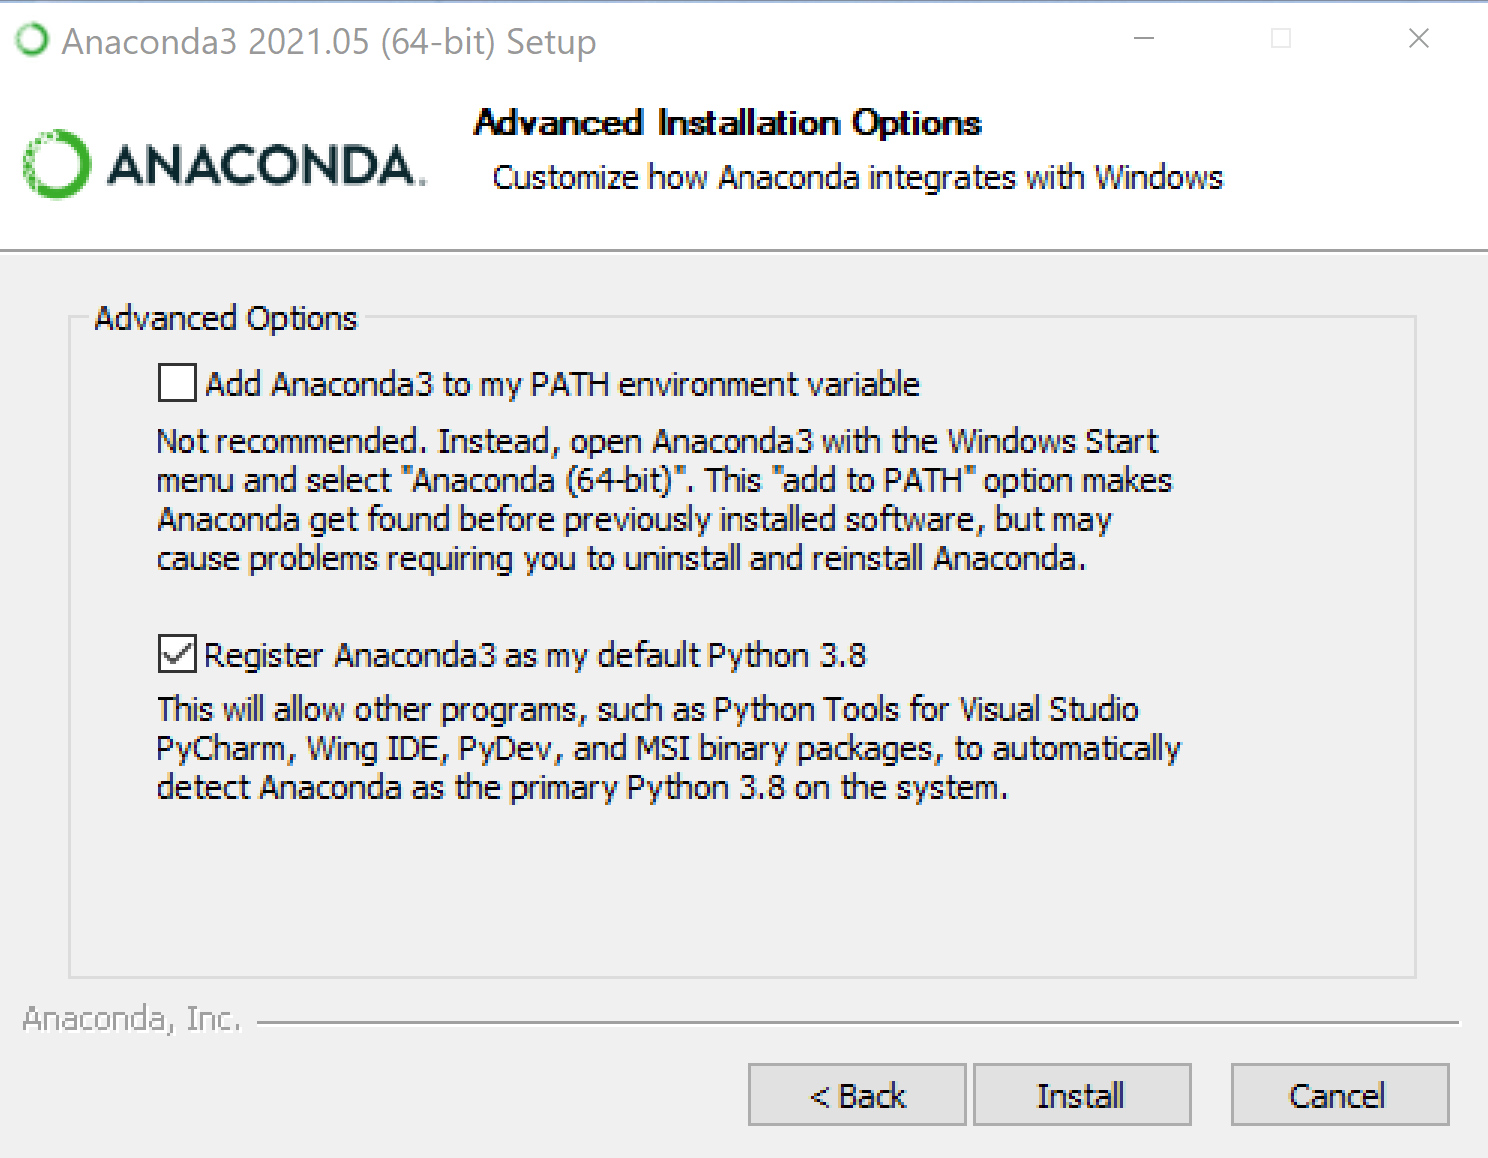

In [37]:
#@title Install Anaconda (3)
base64_data = "iVBORw0KGgoAAAANSUhEUgAABdAAAASGCAYAAAApa4zPAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAALEoAACxKAXd6dE0AAN6oSURBVHhe7N0LgBVXffjx3/J+hLC7SUxITA1sCJXEapaAbbAvCURDtNKGqLU1WCsk1uJWxYqNrdU0tOKDYCsJ2hZta/vPpsWqJMKKrTZJNcjiI6ES2CU+QhJD2EsSwpv9z5n7u/ecuczZO7Mz9+4Fvh8yuT+WuXPPnDkzd/e3c3636cMf//t+GcCA/xjo7z+hUZM+BpENpd/9S1l/ee3+EyfCeFjTMGka1lR8DJ4ThKHSo495fijyov3FdgeP5dZF/zn4X/hf+FpF8S90okoPlP813GiR+4x+5+vlV3AaU26/h22fh/l3fY3SK7mvoz3h5bbPaHL7wYQnBn5+NebZkT1w9qcURV6hsh8jTz7ZSe1Vpa9X7t9Jqmy/qmqb1/01xyFsi/kveAyPS/Df8OHDw3/3SdL+ch+UH+xOnahy/AYeX1VeO1CtfU3B+TyQqrs3UPMCA79+f3g9Kfa1rhds0Gwy/FvwtSovX6V/6qB/aF8/2/7rmK/ayw5dtXRk3Nc3R67UHaUxfvTYcRkWvEmY9Y4fPyFHjx8vvqcMGxZ8PViC1zf/VtpOKS79vZqmFE2Pk/BldHia/gr/Gij2gNmPklKbq14THGnWjVP9/I7fwaT9O6CsnR9I2orIK0X2eeDrV1bVjmm1Lhi4mxP2n24jPKfC/7RNxS8WH4P2lR7ryt1Bfe1yC0pt0XXKa6YZe1X3p7bHP8v5We0cy3TuBwOvOA5KV2JVsc3wb5WvE7Sr2LL4vhvMdcyV6Pk5XDtqrdRE31HMugeZv3UY4u89svJeU9NcHwYryfhz2+e0qRT1J+x/d39K+2wezVL6t8p9Lv37QHz9lLT/Suv5XqfUBrOYdUtL6Wvm+7fSenGqtcP3vJJqzz9R5Wfzau3zKb3uYPcrT9XaUPr3uPV87cyl/cH5U61fh5XaGP5fOc9pCt5/BmrJQJvP49KXdPwMVq23f6rLsveloTHwCGxs5jwc6Pw+HvysPJCs5/dQjr5wr6u1s/L8qeiqYcNL1/fwQbl/Cd6v/u2/fxLfw6pJN+JjTmLToaWDVTpgpa8dL79gtLHaNOk/fiI80UcMbwqTiWYxfx+ul75RFRl0d0CUXq9ycQ/wsXKC3x748LG/mKi3F6GT99NcRI8Gzx/oYupexMxru4/GUH8fX+0XAC6338rxiWjfusw61RLA1VR7E2ik7+Hj+qfUfvP30tfcvnKfE6eyT/N24vjArz/gm2xT8dwOWln8e6DU3sr9q/x7abv9Jwa+flRuz3DjTN8EBO0315dgi8W/OsciLjaPbmxUe5Opxn2dONXGv/RnO7+q8fV7KR42Yng5Nvtijod5NO2ubHtl35X63/zV7QezvdJS7fhWXj9P+oVs0/DwGB07dixsz/HgfaPUNrOMGzkyfG3zOuZaZWK3LdUMr3j9SqW+8an2WqV/N20t9UnJieCfTJvdVyitU1pGjBih/xKvtD23HW5c2k4cs55p10BK2/Jt3+W+Til2v3bSNoLxUxTfviRK/ePupxu74vbhuDkIGZTGr/t6blxt/I8Y8EfA6LZOVvzeKs03IWa/S4s518y5Zd6D3ddx1zl69Kh+NV7peWZd9zEp97XMtkrnifu10nolbuy2O07V5+v7V2m9gbYXt42kr++uV/k1s63SUvq7UW3bmcS891eq9vru9x6lNhtubMTtu+GeG3HPH/DalKD91VS2M63j+rOHOf3i2l+6OcV3BXD3L+75pce4/gufWeXuI/OeOZARw0drVFTatvt6RmV7SirXS8t9ftxrmPabv8e9rlkqr63ueiZ2+9d9rcrX9W3ffL20bunv5WVYaRt2W6kl/N7Pba8bV3tvMdd2t80lpW24X4tT7XsD92fDuDZWPt99PbddpcU8zzyntJivuetWxu72416/2s+ule2rlKR/jVJ7DDcutSOubUa17+1OBaXjYfartG+lrw3Yvwm+93P7Mk5T1p+dqmy/2vioxn2+uy/V9quk2uuXcidme6Wx6m672s+21b5trDb+h1qan90q+9982x+OWf3aqai0f+5++uKBlPrGPJaWJKr1f1LhcdCl9HdjoPf3/uB7n/D8cNpb+tfStpqcm0vD/dK/ltYvnT+l1zPc2Lx+1TOg9GK+pZqwYbHLQP+mO6yPJe7rDfTaSdpVD43SjqFkBvFAC7IxY2ygJU+l7Q203STrNBrTVt/S6OLanGapxr0ex3HPZfMNWemxFJckea2sku6Tq/ScWi1JJF3PGOhYDMZAr52mXe66aZ5Xa+74NO2qbFtpfFf2a9y6p7u8x5ar1Je16tOs2632fHec1LKffEz73D7Mur+ozr12xC2DVXkcK5eSauPNXT8uTpIAGWhxuduu5Ps38/eBlmrc9dznuV8fyEDrJXk+sin1v7uY86YUl7hj3Dfefc+pXLe0nrsucCpyx3Lc4p4DcYvLrF96LC3AqaxyDLt/TxLnoSnYYL5bBAAAAAAAAADgNNDYczAAAAAAAAAAABgiJNABAAAAAAAAAIhBAh0AAAAAAAAAgBgk0AEAAAAAAAAAiEECHQAAAAAAAACAGCTQAQAAAAAAAACIQQIdAAAAAAAAAIAYJNABAAAAAAAAAIhBAh0AAAAAAAAAgBgk0AEAAAAAAAAAiEECHQAAAAAAAACAGE39AY1rLvJSTcUH8zXzp6n0hYCJm5rs3wEAAAAAAAAAqDfuQAcAAAAAAAAAIEZd70CvFL50U/ExvONcW8Ld5wAAAAAAAACAoTakCfQ0ykl2AAAAAAAAAADqoCYlXPLOyZvthX9OjVw/AAAAAAAAAOA0ULM70CNJb+fG8eMnjsuJ/hPhcvTE0XA5cvyIjBg2IlyGNw2XkcNGFpfhI/VZNinPXegAAAAAAAAAgHqoWQK9lCQ3f0ovYR6P9R+TYyeCJXg8cOQFOXDsgLxw7KCMHjZKxowYI6OHj5JxI8YVl5Hjwue5SKQDAAAAAAAAAOohtwS6udu8ybnV3Nxpbv6YZLlhXsb8MXebHzlxRA4Hj/sP75e+wwUpBI/jR4yTs0aNDxPnzaMnysRRwRI8Viptx7wWSXQAAAAAAAAAQK3kege6SWyfOHEifDx07JAcPnE4fCyVajHLieDlzF3pJsG+9+AzsvfQ3vBx+LDhMsz8aWqSltEtwdIsLWNaZMKoCXLWyPEyYeSEYpmXpmKpF4MEOgAAAAAAAACgVnJNoId3nfcXl+ePPq/LATl47KAuh8I7x4c1DQuT308eeFKeOvhzefKFp+TwscPlO9PPGdOqyzkyafwF4XLBuPPDu9PHjhgbLkap6STSAQAAAAAAAAB5y5RAN091k9emXEvpTvOClmYxJVqeO/KcPHf0OXk2eBw1fJSMbCp+QOjjzz8uPzsQLMGjKeey/8iz4XPOG3uunDfmXDk3eLys+VKZqsvZoyaEpV3MXemGeX3KuQAAAAAAAAAAaiFzAr30QaHm8cDRA+Fd5+bxwFH7AaGlDxQ1d6aPHDayvDz1wlPh3efmLvRywv1QIfi3EcV1ho+UC8dPOmmZNG5S+G+UcwEAAAAAAAAA1ErmBPqx/uJd5+bDQc3d5vsO7ZN9h/vk6PHinejm6+NGmtIrY8ISLCbhbZLjJvn9zKFngmWf7D24VwpHiner9wXPff7IgTD5/vyR5/XDRM8OHy9rmSpTJ7aFj2OHj9XtUs4FeeiTbfd0ypZ9Jm6VmQtvkCtbwn8AcDrp2yb3dG6R4qk+UxbecKVkP9X7ZPfmzdLVs09a22bKnDl5bBMAAAAAADSC1Al0UzLFdfh48YNCDwWPpqb5kwefkieCR1NWpSQsyRIspiSLSZybBPrwpuHybFiypRCWbjGJ832HgiV4NKVdHj+wJyztUrrL3Kzfft4r5MrzXh4srwiT6mePDJbg0TC7kWs5FzfJQkL1DFD/BHpf3255rHur9PTtk33FgVbU2iqtLW0yo/1KmVyDNpjX7d68VfqCF7UvG7xma4vMmNMevGa6F43dXrAPbW0zpP3KyYkTiXm36yR6TgcHV27I+eBm7wN3/CXQNlcWz5msf8nJ7s2ytqsnDNvmLpZqmy+P3x73eJndbpWWYPy2DzKJvHvzWtFm1GY/a5FAd/rOSNJ/Xk77Mm0nib4+2f1Yt2ztCd57Ixchw5x7Eh7LKTW6FgEAAADIx969ezXKx7nnnqsRTifPPLNPvvOdb8s111wjo0aN0q+mc+TIEfn6178ur3zlL8s55wQ/NJ4hhn84oHFiYZJa/5g7xU0i3CS+Ta3zQ8cOy/H+YzJuxFiZMOosmTjq7PADQVvGtIQ1zEcNGxUsI2XU8JHh80cE8ejho2TMiDEyfuT4cJ3wzvLhxb+X7jA32z1r1PiwhrrJ4ZvnmrhUD90oJc7zSKD3/egB2brnoP7toBwaP0WmTyq2BaejQ/Lk9u1SPORj5aLLp0vtDrdJlv6TdG3tlT19B+VgaZiVBF842LdHerdvld3D8hx39nX7zGvoV4tMO/qC19wuW3cPkynTJwW9UE2wvc0bpOv+R07eXvD3vj29sn3rbhk2pVpf5t2uSubu4A3SeX9PuO2xF12eb5/m0gfu+EugtU1mTMkzo7lbNnd+N9gbk1NeKNe/dIDG9gXrbuiU+0vjV79cctDsd98hGV91n+Pslu6vB+NA/5b/fgYOPSnbt+8ptnvsRXL5oMZUhcJu2dpbbnXQ7Bky6GaPnSSThu2W7cFg6OtNMnYGITiG2x7cLF+5f6v07ukLj9nJzLlnjuUeaboow/4AAAAAqLkXXnhBo3yMGzdOI5xO/vu//0v2PPGE/PRnP5O2tjYZPny4/ksyJnn+1Q0b5OdPPy3P7t8vU6dO1X85/Q06gV7y7OFnwzIsT73w8/AudFPnfPiw4Zo8nyitY1qleXRzmBg/a+RZMnr46HIJF3NnuUmCm/IuJlk+cXSw/uiWMPlu/m6S4+a1Dh0/FNZHN8l34/CJw8Xk+cgJcs7Y4m878kyemyTOg195xCZxAgf3HJbWGVOYln/aqmcC3X0tc5fyFXLpVZfL5cHF65xg/B5qMgmtcMVg3G3PKYm+Wzav/Yo8XM6TtUpr8LpXmNc95xxpOnQoTACHDu6R7VWT1SYp3Sn/01PaYHF7rwq2d845wT4cKu3DQdmzfaAkYN7tiurbvVk2dN4vj/SVXyDHBHpefWA8Kdvv18SxuXP9wgvDO7n9y2SZkuMANfvx3WL2XK6fM9nfv+Hd0f/jJPqDtrRdGByvq8Lx2xbsd9PYYAm21TqIc6hv22a53/0twqmSQG9pkdbCk9IbjDNTwmV2e7Ztjp00SYbtNteIYOw8OdhfHHnoMexxzonwOLaOlQvNuAuuQU1jx0aS6pl+IQAAAACg5koJdHPnuEl+D3YpbcfEOP285CUvCZPnZgZy2iR6KXlunmvyEq95zWtSJ+BPZYMq4eIm0H/63E/lx8Hyk2Axd5WbJLf5gM+W0c1h4twsY4aPDu8kN8nzJExN9L2HnpGng8cf7P2hfP/pH8j3g0eThDdJeZNYv+r8dplx3pUyI3gc1jQsbJNJnrttGzRnOr4ZFKWp7TWfTo8hZO6CrlcJF3PXcrc0t8/xlkXo23aPdJbreeTQnnJZiFZpm+kpK+KWtgiYO5F9pU4i7Ystg1FMLperWvhKZeTcrqLgtbd1y9YtPeXnuKo/P5nc+iBkfpHQJeGqtShbMpDEpVucNgZaZ86VOSlK9FRVcZxDp0oJlxT6dm+Tx3p7ZIvMGHjfnHbmNWYrj6H5BcXcOf7rUFjipXuzFKYE1586DMnEfQMAAAAgolTCJWvplby2g8ZVmQi/fv78quVcBvOc080wfUzMJKiPnzgefjioqX1+4OgL8vzR58MyLubvJsFu7jA3d4ibhLlJnpvYJLkHEtYw16V4d/lZYd3088e+SC4cP0l+YcLFcvaos+VE/4mwbnrfob6wdvr+w/vlhaAN5gNLc0meB3YHP8AXtUrbjLbg/0U9vbs1ArJokSsHSloFWq68Qea26V9kn/Q85s6HGKxiIt6b9Gy5Um6wLyr7eh6T+FfdLd3l5H6bzI1NQLbI5DkLZWbp5Nm3Rbq9p09e7QqYpOPaTulyk+cmSTjTPj8feffBUOmTbVv1etc6U9oHyFnu3mwTr21zTUI3x+R5YHd3RfL8dBSMz81dW2RLT4I9DcZ98PYT2relOxhx2fVt2+okz80vDwa+Dpk76yfPqU/yPFXfAAAAAAAGxSS+TQK8dMOwSYybBLkPyfOi1Al0w5RpMQn0F469ENZAN7XP9x/ZH5ZwMQnuYp3zUTI6WMyd5yahPiz4U0qQl4R/D/6Y5xSj4E+TJtBHTZBzx5wjF4w/Xy6acKFcPOGi8INDTwR/TL31QvB6pQ8gNe04duKYbrW4XbNNs6S3W2z+vE0umXyJtNkMei5JDCCJyVPyTPo2y4wkd7FPbncSvj0Sm7ff3evchdwu/txai1xZygAG4n8BlWO7TmLuap9bTBI265fykmsfBPoK5V8KtLbm3dgB7O4uf3Bp24wB7sTevTnywZ5z8v5EyfL2W2Xm3JnlX1qe6Sa3l/qiR7ZuSzToB1TQ2VTGgMcbAAAAAHDaSppEJ3luVU2glxLbLpOYPnLiiBwM70A/IM8dfT5MZJta5ebfSrXNzR3opZrn5g70cDtNzjZNrEn00h/z/OId6BPkXHMH+jhzB7pJoF8cJtXNOn3hHegFTaLvD++CN3egl9itpapOE3Lv0CsmGFrkEptBzyWJAdRdy+SB7zQta5HmKutFZmhcUmXlyVOknD52ksRlObarLLiomzukFy4e4K72jHLtgyFU3o9qd5+X99eU/Mj7dmTnLvi2GXJlHX9/0PDcu9AHmnmRSJ8UePsCAAAAAASqJdFJnkcN6g50c7f34eOHwzu/TZLalGlpHdMiE0edHZZZOWvkeBk9bHSYSHeFH/AZ5s21VrmJtW55+e/6WGLuZDflXMzd6CapbpLrxrH+Y3Lw6MGwfIxJ3Lt3oA9enzxWnj7eJlM0T9RyiS3jkj2JAaTXkjh7XGsVMzSqNqvZ5LOLEt85noEp93LDDeEd0rXrsRr0QWFf/cuX9G2TcvWWtkv8/eWsJ21TBrjbfnDMB4cW74KvRXL+1FeeiVKP8wcAAAAAcMbwJdFJnp+sqd+tqRKjfBe3JrsNU64lvAPc3AkeLIUjxTvCTc3y4nJemEQ/a+RZMj54LDHbChPkMcp3ogeP7oeBPvnCk8HyVLiYDxT9wd6Hw+Vl514uv3Tuy+Rl51wuk8ZfENZJv2DcBeFzzF3spXYPb0rxibCmfnLpw+UiH17Xl/4DJt1tOR9U19e3W7o3b5WeYBCWtLa2SduMdrkyYVmE0get9fTtCwazfjFQ2s4lqZKHfcH2HpPurT3SF2zMaVWwvZZk2zMfNPdYt2zt6QtPLstuo+q+1bC/DNNnZh/d7QQbkra20gdXpjvG+R6DeLs3r7VlLZKMuVxU6QfvOeJn98M8ZbAfxDuIc9DlfjBw1g9krEUfJP4gz/zYD0Gt0p+1bJvTl+XjMoj+TcVzrSl9YObWnorrYFubzGi/sspMCffDOdtk7uI59hcNTv8NzHcc7Lazjt3qH3ybQXCt3tYdXKsr+2+g94BB9o27H0nGZNXzryZjAgAAAKgfPkQUWVQmzA2S51HVS7iYxHZFjr10B/qB8h3oY6TF3IE+emJ4B7pJmpvSLZV3oA+kdHd6SZhMD/6Ed6CPmiDnOHegm6+bNhw8djAsH2Nqrx89bku4DFbfY/aDB9tKt5+H3DIug/9Ax92bgx/6O7uiSdzAvn09sqWrU9Zu3i0Dbnn3Zrln7Vrp1A9aq9hMeTud92wbeDuqL9xesH6wPdOmilaVt+f/4MO+cJ/WduqHNlY2yNnG2ns2S9rqN5n7y+jbLZvvKfZZ5XaCDUnPlq6gvzbL7qRty/kY+JhjU0r4tM6cky5ZnEnB7lPc3dXOndJJa3U368U3myrtqqch64N8lethV+lPt3xL5LKYWZ9s22yTlnPqN8hPYu6Cv8dcxyKJUiP4e88W6epcK/cMWfkuO4Mh6wwodzaV+VDbrNepotL7QFfxmqhfLQr+Xn4PyOO16ifRmAjegwAAAOphbfAzaJ4LALgq70QneX6yQZVwMR8Iauqaj9ZktqmD/szBZ+T5I8+HtcjNv5ua5yeJ5uFPEt55rne5R5i7380fTbJXrlPlJvqE4su3lGQt41LYdk/4g7gEW2mbOVPmzp0rc2cG23Tzaj1dsnmAJI1JZNkf5M3d0zNlptnO3OCxnOAPmMRIlR/sw+R018nbC9ul23ObdjKTmC4mF0rCu69nmuebfZsZbM9tU49s6bwncRI9j/4K2xgm4PWvAXPnYLHP5gb7qMc0aFvX5u6KJEm8PI/BycxsgG1BvxaPjdHaNjfb3dIpuZ8BIC3NJ92d2jeIIspu+ZnBPN+o1q56qkUfuF/r6ar4BjcYD/ds3pb8lzyJOGVoBuxPp252cPIVf11gxulmuSdol9vOe8wvyYJGJm2mLd3SKjPn5HgndFrBvnSaXwAGobmGzdRr2MyK682+LZ2DS6I3txevX2Yx29Qvm18alL8eLjM8v8hwfoEbfBNTKEaD03KlzCl/Gm/AXKfW3iObBz24ijND7PuAuTs7ek0sv1pcwj5z39RI0jERvAcN3S9WAAAAAAD1UrWEiymHYpQT2IFnjzwblnHZf/hZeeKFJ+WJA8ESPE6ecIlMmThZJp99iYwKE+yjyzXLDfNSsQlyZf7d/HGFZWIOFUvFbHnqu7Ll51vD5aUt0+Slrb8ovxg8/sKEi4PlxXLxWReHzxlUCZfgB+byVPLYsgFuCQnPNHCXOyVcmWTonOBJlXmAyLT6yun/jnAael/ww3yi6fD+sgzR12sN9mVOsC9x2Yk+2b2tWwrNc4LX0y+Fon1h7mCdOydoc2yCo2Jd3/7l3l+VbfSVKzD7uFm6bAMD/r7L6xiEIutWMEmblGVqsnPLUMS3PW3phJCzn4MrQVG9XVVlboNViz6Ijmk/k5yck0ey2TnfBu4Pp+/Dc6hZuu+J/lLqJANeD9RA/eFeC2KvxRnFXGsGanPl9TJ+/Llj1HdNCgx238r9NcjxXyF2vLUG7wUzfO8F8dzSKL7rdfBqkWuxd7yl6Ju052CqEi4lmccEAAAAUD+UcEEWlHCpbnB3oDcNkxFNI8LkuElWmzvQ95o70I8+L0eOH4kk28OUuEmM53CXeCT5HoSlhHse27ZlCoIfsGPrFLTIlTP0w9wCPb0p7y42JQpikwvmpsA5Ym8K7BHvpsMElklme35SnzxH5pab6Ck107dNNlf84O9PmLTI5KBt0eR5YHd3NCEetMmfcwn67YaFkf3bmuSOvaz95bbRmzw3zD7e4PRbFXkcgwRKu1e/extNkquUADS7Wc+yMQNp1HblqxCMw7a2tpilPNBDpnRE59rNknZuw0ASf0BtsNpj5eR59E7jytkmXZ0DtXG3bC5nXYe2dEvRwNewluD6sLB8wdknW/w1rWqnuXQn9z7Zl+kW9CKzT4sXBsfNHV7BN0c9pXJbSe5I323LTJmE9w2e67UZOFfeMDfo5aJT44O4T4ExAQAAAAA5iPvAULecS+mDRc90g0qgm4S1SZwfP3E8LNdiaqCfPWpCWNbleP/xMJF+6NihsE65Saa7fMnuUjK8JEzCB39MSZgDxw6Ed6Kb7Zq/G8ODP2NGjAk/rHTMiNHpPiz0JE45g+AHZ2+d38lTykkA6elNkcRqrVKiwK2xLt4SEZOvrH7n6eQpA2eC3Trvg0tG9sm2reXOEnP3epWb/wItcuWcmeWkcPUEStb+qmjjjAT91m7bN5A8jkGZW77AlAcwCdPyb/q0lvra5GVvBi96h2iYDGuILHWjtit/5hdVc+bELTfI4sWLZeFcp7yFmJJDGRN25TrurTJgGfe+gj1Xe7YUj4X5JdLiG+SG4By9cvJkmTz5ymI7F851ErK+Nrq/EKl2ntdHkmtYy5UzBnntz4lTZmcwJYRimXIuN1SOrYBee0zZoIFeyf7SOTiO7dV6cLKUL4vB9gf5e8W6OSXGBAAAAABkFJc8N3ebV9ZEJ4k+yAR6mDzvPy7H+o/JsKamMIF99kiTQB8RJs3DBPrxw+G/l5jk+IngTzFNHvwxCXN30a+VSsYY5o7zMIF+9IDsO7wveHwhvMPdMB9QOnrYKBk/YnyYwDd3xA/a7t7yHa7SNmWAH5ydJEDwjMQ3obdW/9BD9y7QfXncYhg4eTvROu8zBpWMdD/McaZUzZuUtFxik2vVEiiZ+2sQbXTbl6MBj2VLi0wOE5DF5UqTML3BJEwXylz37sYUteNTM6UL1jrlFaqUTqibRm3XEGmZPEduWOj8kqdnax1+sRIjnIHhSXq3TJY5zi/K4tq4e7M9pm1zG6HsRdIPRrUf5Gmuo3nlsBtBOLbCa040kV6c7eC79ji/dE5wvTbsB+nmcxd97TAmAAAAAJz+fMnzEpLoUYO7Az34YxLdJlluyrmYBPYEcwf68JHh154LE+jFO9DLTMmV0p9Swtz5Y1T+3TAJ8wPHXghroIclYk4cCZ9v7jg3d6CPHzk+rLVuEuqDVb18i+XeXdyzdeA79GrLfJDfbtm9e5ts27w5/ODJe+5ZW64rHKvvMVu7ODgBBrrx1Mu9IzXVhzm2iM151ziBMug2pjWIY5BIsazM4nItmH2ypcrdoINh6viuder+hrWJGyBJ3ajtGnItV4qtIjX48kDGYO9irjqbo6KNkfO8ouRH1kMajhPnQ0zjlyq/fEp8Hazj9auKvH7BGlUs1xUm0iO/STS/wIspx+NeY8MPIo3r++ji1lzP7S76WjgFxwQAAAAApFEteV5CEt2qmkAvlVJx64+bUi3jRoyT5tETZeyIseG/h3eKHzkQfrjoM4eekf2H94d3jpsEuLlb3SS9TbK9tK2T/gRfM/9uFpN4P3j8YPhhpaa2+hMHnpCfPPuTcNvGxNFnh689cVTxcfzIcWGbSpyt6lcG0LdNnGof0tMV/8N/eXGTo3Wfil78wMt7wrZ0SmdXl3R1bZEtPT3SEwzk4L/kBptYLpd+MHmGdCl4ewdijWVoY3U5HoNqJrfbWu+5jrVgHzY7H4LX2iYzFy5OVB7FvfM/aRLMXW/getuDb1c91bYPBub+Aq82idQKketEsjtz3TaW99vMKChdO81d7KfgL0Tqdv0aUi0yOSzH45a0iinH41xjz2RnxpgAAAAAcDpJmjwvIYleVD2BbpLdTvLcMMlqc+d386jm8O5zk6g+fOywvHD8oOw/8qw8/cJeKRzeH/7d3DFuSrmYO9ab+ktp7eCPbre86B9TU90k3F84+kJY93zvob2y5/kn5CfP/zRMyptEvEmch0n0Mc3SMro5TOa7CXSjtL1q3Jrg6WW7CzSVvt2yeW2ndG2JttcM4NZW82GD+oF+9tM1kbe6HwO31vu+nO5wNDWog30oTUUIS3IM7oM5kyZwC+XfKgxUbzu/dtVTvn2QQPnDJIdAMM7TNr3YP8Gx3WxnFFS9Y9mZfSA9Xc6/Re+ENh8mvHDhwipLfmPIHsMzQMuVcoP7ycoDlQwKzlX3sxySLDOS1Hw5BZxRYwIAAADAKS9t8ryEJPogSriY8iqmVMu4keNkYukO9KYmORLWKjdJ7/2y99Az4aO5A/3w8SPhHeUm8V1KlvuU/t2s/8KxF8JkfHgH+gtPyI+f/Um4TZMTP3u0SaAX70A3jyaZbxLoYWmYYEnOrQku0mo+xDHRYlNY1T8QMw8mAVX64D3Tzpkyd+Hi8MMFb7jhhmAxHzaoH+iX4e7WtNLeAZtbEjGF/O7SHfpjkPRuZ79ikrp8g/fMhbLYV8/ax03gumUcvNzawG7JA1cO7aqnmvRBfSW/C96p8xycv3mdTflokZaW6kv+6nf9ipP/rBoPdwZM5S/w3HOgpTnyWQ6JloY9uQdraMcEAAAAULJ3795MC05vX//611Mnz0sqk+hmW2eSQdVAD0uUB4u5w3vsiDHSOqZFLhw/SVpHt8i4EWODjTaF9cp/9tzjsn3f/8mP9u2QXft7ZPezu+Xx5x+Xpw8+Hd5N7i7ma3sO7JHHnn1MHi3slEf2bZfvPf394DmPyb5D+8LEvSnVcsG48+Wy5qnh65nkuamFHpaGcRLzpUS8+7VYkZrgM2WO+RDHRMsMsWV+e2pfxmV3dzm5aGoH3zDnysElINxyDD29J9e1TSJ18rCkjknEQbXR+eDROHkdgwyylP4woh/guHBwpVEiHwabJKHq9KvnA3pzaVc91aAPEsu9PFG1mQ3uLIj0H5RYamNz7C8ifUv57DUbiHx96HKUzodmDsUvQVJda+vAfS8Z4rZV/8VirT7gc4jHBAAAAACk9MpX/rJcOGlS6uR5SSmJbrZhtnUmSZVAd+/uLiWozR3oLaNNAv2CMJFuEujDhw2X544+Jz97/nF55JntsqOwU3YWdknv/sfCrz19cK/sP7o/spivmX/rffYx2dH3qDwcPK/76W3B33eHHyBqyrqcNeosmTTuArls4qVy4bhJcvbICWEC3STyzZ+0dnc7H1TYdolNCFQ1WdptcWrZ0j2oVHRiboKgWtJs4GSCczep9EjvYJodSR5ukcS7nscHmCblJneS/oJjd2/57vI4+R2DNNwZEhnvcHQ+wNHc4T1n0Nl/N6GaYAw5/Rr7Ab25tauecu6DFNwPPM70CxXnl0zVxmvLJW26brKSVbaNrdIWluoofkBl/C8jY5b20usFWmY4/1aDWQmDuT7U+voVx/nFSdZfpA1O5fXHnZlQh18iV3D7oPosoyq/HK10qowJAAAAwHHuuefmuuD0dM45rXLdddcNKnleYp5rtmG2dSZJX8KlokRKMYHeLJPGTyrXIzfJ7OeOaALd3IHet6OYQDd3oB/YIz8/+POwHIu7mDvQzb+ZO87NHegPP/OIbCvdgX64T04Ef0ypFnMH+tTwDvQL5exRZ5c/eNQwd6kn5949Vkr0JGeTSoHB3s2du93SXb5NOk6LXDnD1rXt6YrWFE7GTR4G29i6LcHdh32RGshtM2pdnmOy2M8xTPILjqB97ifJZlLtGKTg3vXe2iZZygbbpGabzMh4h7c79gc+/m6/xn8AZZ7tqqc8+yAx55cNmbfl/JKpagLS+aXZvi2b/bWwDfdDmTOO2fpIf33I7fqV4s5t+0uOLL9IMx+AvDvxa0auP8EeR/P20c9n2LI5yftACtX6xp1lVOX9t2/bVpvoTmQIxwQAAAAAoCGlSqCHd52bP05plBHDRoRJ9AkjzwrvRD937DlhknvCyAlhYvvQsUNhCRaTTDdJdHNH+vee/oE89OSWyGKS5ebfzDpPvfDz8Hmjh4+Wc8ecI1POniyvOPflMnXipfLis14s54xplbNGjpdRw6O/Mals24Aid48NItHj3okdbGlQd3MnFLnbbku37I7LLJgPuLzH1uj2itS17ZGuezbHby9kEi6bZVvFvpkP77M34G+RzmrbcEp0mFI57dluwk1kcvtMJ8HSJfds9iSOgn5z62/75HcM+mTbZtOn3g4L9e3eLPeUs6WtMjPT3bfOL4vyuFOy5Uop/x7GHP/Yvo0e99aZ7TGlS3JuV576tsk94QdX3iPB7p0stz4IBK+1efO2Ac6hyvEg0jZ3TrZSMO4vmaomct1fvO2TLZ2e8930mfMBoKdMUnGg60Pw1cj1Iev1KzI7JnlN+fLnR2T8pUQh2NfOYEyH+5tivMWN3ZYr3VJm5n1g4DFsXnC3ufb51knTNxXvv12e42f2o7PaxT1OPccEAAAAAKDhNfWn+9TNk5gP/AyX/mNSOFyQvkMFKRwpSO/+3cXl2cfk6PGj4b+bxzEjxoSJ8TEjx+gWig4fOyyHjxcX0yTz58SJEzJp/AUy6awLwqT8xWddHCwvlosnvFhGDRsVJtDNh4caiRPnavfmtZHSEYOpu9y37R77w3nbXFk8x/kp2k0mBT9gL6z2oYjBD/prSw2q3Jbsls1r3cRsq5gPPJ0xxaQcg77u7ZGesNRHq8yc2SJbtvi2U6KJXjev0FqsMTyluXKbZjOL5eTNVLYp2ESwjZa2KcE2zN+i2wgF/z73Bk/iL9f+Koocn1CxnvKUk/rNvORcaevp0qRI0I8Lb5DokMjrGESTL2GftQT9brZTCLazr0f6gu1EWj3I8VkW6dugD1J9sGLQtva4eu8n94fp29YpQdi7L+iLHrsPvnFYk3Z5OOOlen9WJMgkGLeL48ZtDn1gRBLPZhstQXdMkWYzrmoxHpQ9P+LG+8nca6Zhxm5bcL43S6/09vQF1xPbykxtdPtjoH4brMi4C/YhOILFy0DxnG4LzkXT94XgnN6i14ci3zgw3LEw0HqVyVdzvGeE18xCb69I+5yY4+BsO1N/VI7rIvMBMKUPW+3r6xPzYTARA12PNdHuPqM8LsrvA/uC7QbrhCsNNNZS9o37HhAK1p8ZXN/NCxfMmNTjGrR/ZsuW4FgW14p9P6vJmAAAAAAAnC6GfzigcWomyW1qkJu70E0y29xxPmLYcBkZxPuP2LIsJrH+9KG9sufAE2Gt85/r1x9/3i5PHHgy/PreQ8+EyfZhwZ9xI8fJL0y4WC6dOEUuP+fyMHFuEunnjD2n/HqmDanuPA/tlu6v9wY/rhutcsXsGTJpbPiXVMaOOSy7t++Rg+YvfQUZNmW63c6hJ2V76d/GXiSXT58kA75EYbds7dX73YIf4GdMcTMFLTJlyjD7WsH/D/btkd7e3mDZI3195qut0jb3Brl6zEDbKQm2N32KDCs8KXvC5wYO9knfnsptFrWaJMZJmwm2MSO6jYPhNszz47YxV66/vl0m6d9Pkmt/FY2dNF2mDNst2/eU2nEwaNPJ+1hM9o2RJ7dvl+KqY+Wiy51jGcrrGBxyXkf7rLSdoP/NdvSfwufOfNU1MuelcccwBbdvD5o+MK+ZdDkk55zUF4bpj1YpPBmcR8UNB+vukT1BX+wJnlfah/C4z5kcfyxr0i4PZ7yMvehymT7gE6PHKDyuwVg/+Sjk0AeG2w/hNvpkjzmPKsdDOL6ul+uzjgdlr18H5dD4KVX6JNjbKTOkNejH3uLOhmO32M7geATHr8gkMYM2DjZ5brj94b2GZRC51lwq19wwW8bvNse7eE7v0XO6fG00gnbMvX6OTPZ2UUF2b7XvKfHjxRgrkyY51xEz7vWauaevKea6E9jdLV/Xsdt21TUx1+KkDsmhJ54sH7+Sg865Z2JX8br9Us++BFqCcRNcFwtPBmNVn1oeF+Vro9lu8d+k9UK5fErQN7H9mLJvgtd2x2PwBPseFo7J4EvmuN1wtYzZvTVYr7hW7PtZTcYEAAAAAOB0kSmBbhLXrhP9J8JEdpjY7u8PE+sTRp0VllxpHd0Slnh50bjzin8f0xI+lhbzdZMcv2j8hTL57EtkSvNkaZs4RaZMnBzedX7BeFMW5qywXIy5g70kffLc3Gy2We4vZcdar5DZM6oka33GjpHD4Q/Z5i8VSajID+Q5JITHTpLpM0zC4EkpNAU/1Jd/jjd3yL1Krr9mdvDawV8TJJaLxsqkKdODf2+VYYcLciiyzeCpra1y4RWvkmtmX1PcbqziNkwScXzMNsI7CK+4Qq6afb3Mnt4y8P7n3V/KJNHL+9gXtE+/Xuy3K+RV1wRtCzMgbtI0LoEeyOUYBH02fYZMaR0mh5sOBWO3os/MtlovlCtedY1cPztoQ3ymKR23b1Pz9IUxtviLmCmth+XJgpMk03141fXXBMd9gONYq3bFcY5J9QS6m8grJq3bvadRxj4wgnE1yXcOOeNh9jUzZHoe46HEuX4dPDQ+2I/q18EW95rhnk/huW6uF8E5kDWj6I6LAa9hg3TStWayTI49hma32srn4sBdnzSBHjDXkaAPC08WnF88mNe6MLiWnpxc3t39dU3+tslV1wyw3arGFo+fuYYNGy9NY2OuP8FxbB0bjLcrrpLZwdg1fV/1aAb7UzwHxsvhwqHIPhnhe8mFwftAcH28ZkaVfkzZN2Z/zPvP4WD9pmD98jNK43FO8Ze2hVQJ9NKYMNfpQoYxAQAAAAA4XWQu4eJyy7n0HeqTvsOmpIs+Hi4+hmVaThyWQ8cO67OKxowYLaOHBcvw0eGHkZpke/PoiTJxVLCMPjt8NHedl0q3GGkT5wAAR7kMRrIyLqgzp7RIXqV7ECNSwiVBCTEAAAAAwBkltwS62Yyb0DZ3o5tk+vH+4+GHiD6jy4GjB+T5Y8/L88Gjy3wo6FkjzpLxwWPpDvXW4NHcxT7c/Bk2PFzPvM7gyrYAAKLyqq+NWrB156m1XVMk0AEAAAAAAximj5nFJbNNKRdTI92UXTF3k79o7Hnhh4KauuZTzp4cWczXzL+ZdSaOOlvGjRgXJs9NLfTKbZM8B4A8TJY5c9uKYc9W2aZlLtAA+rbJVv3gy9aZ7STPAQAAAAAYIrkl0CuZJHfxQ0VHhAl0U4LF1Dm/cPwkuXj8i2Xy2S+JLOZr5t/MOs2jm8PnmDvPzTbMtsI7z/Uud5LnAJCTye0ys9UE+2TL5m1axxtDbXe3vSN6DqVbAAAAAAAYMjVJoIclVpqKCXSzhAn00RPlvPAO9Ely8YSLZfLZkyOL+Zr5N7OOWTdMoA8rJtBL2wQA5K1FrpwzU4o59C2ymdvQh97uzVq6pVVmzqGcCAAAAAAAQ6kmCXRzx3iewrvOzR/uPAeA/LVcKTdoKZd9WzZTymUomXrcxey5tM6cwwe7AgAAAAAwxHL7ENGBlF4i6V3kpQQ8CXMAAFBTfIgoAAAAAGAANauBXuImz9P8CZ9T+9w+AAAAAAAAAACxan4HemUCPQkt2FKMuQsdAAAAAAAAADAE6lLCBQAAAAAAAACAU03NS7gAAAAAAAAAAHAqIoEOAAAAAAAAAEAMEugAAAAAAAAAAMQggQ4AAAAAAAAAQAwS6AAAAAAAAAAAxCCBDgAAAAAAAABADBLoAAAAAAAAAADEIIEOAAAAAAAAAEAMEugAAAAAAAAAAMQggQ4AAAAAAAAAQAwS6AAAAAAAAAAAxCCBDgAAAAAAAABADBLoAAAAAAAAAADEIIEOAAAAAAAAAEAMEugAAAAAAAAAAMQggQ4AAAAAAAAAQAwS6AAAAAAAAAAAxCCBDgAAAAAAAABADBLoAAAAAAAAAADEIIEOAAAAAAAAAEAMEugAAAAAAAAAAMQggQ4AAAAAAAAAQAwS6AAAAAAAAAAAxCCBDgAAAAAAAABADBLoAAAAAAAAAADEIIEOAAAAAAAAAEAMEugAAAAAAAAAAMQggQ4AAAAAAAAAQAwS6AAAAAAAAAAAxCCBDgAAAAAAAABADBLoAAAAAAAAAADEIIEOAAAAAAAAAEAMEugAAAAAAAAAAMQggQ4AAAAAAAAAQAwS6AAAAAAAAAAAxCCBDgAAAAAAAABADBLoAAAAAAAAAADEIIEOAAAAAAAAAEAMEugAAAAAAAAAAMQggQ4AAAAAAAAAQAwS6AAAAAAAAAAAxCCBDgAAAAAAAABADBLoAAAAAAAAAADEIIEOAAAAAAAAAECMpv6AxgAAoC7u00eRJU3XaSSyVh9Di+/VQKT/rtdqlM2uO2ZrJDK140GNRK5etVMjkQfefalGOF3U+rjft6RJI5HrnEG8+F77LWZOQ/g0c/J1YK0sDh+Ne/vfoJHIlyLXCXeduzQSoYsbyK47NAiO7U0dGgXHzp5+XlcvXqWRyOfverdGIlyZAQAAhg53oAMAAAAAAAAAEIMEOgAAAAAAAAAAMSjhAgBAvd23RIPgjditeRGRf5kGSricmSjhEsdXRqme5VEatYRL2r5phL5sAM51fbZzIjwoV2sksurez2sk8m6nI+674yaNgnPIOUeDk1QDkZ0P1KKcC8caAAAgCe5ABwAAAAAAAAAgBgl0AAAAAAAAAABiUMIFAIA685W88MmrFAYlXM5MlHCJ0wilKE5uQ/T1T5USLmeyXfoocsfsqRqJuFVY0p4HvvOpNtdpjjUAAEAS3IEOAAAAAAAAAEAMEugAAAAAAAAAAMSghAsAAHXhmSp/9SqNRHbeul0jkanRWhgaiPRHagA425ztbNMpH5CEWxrg1u22DIG/fIAGgURlC+QOjURmX9ehkUiiZrr988BlGomsjJQbSOfqxXabn7/L7sylbjmGJTdpFOxXgg71b3Pwx+hq57h/3jnuWbbpqn0JF9t+ua4Gx+u+JRqZcWW36u0GZyytusKOww5vgzxlLO6r3XjOVMIlp3al75uU7dzljN+bkozfq/XRjKnPa2TKodjxGy0/ko7/3E3Cc1337bs+DsgZ102RE8puc/Fa+/Vk++v04Srbh2/wXO+jzoBjneFastN5Q6QAGgAApy/uQAcAAAAAAAAAIAYJdAAAAAAAAAAAYlDCBQCAevBMy4+W0fBNU7fT2lftfEAjkctWxpfO8JZbWeKUW/GtP3+DRiKzpzplINwp63ZmvdzkrpOlbIHjviWzNTL7ZSfRX73KtuGKDvu67jT+q1c5ZU/m2/3dsNK373b9G++2fe6Wo/FtUzbYMi9TI/VrbDtXPeyUw3jQOY5OeYJ3Ox10n3OMfMc0dZmdJMd9iEq45He84vv2si/5+so3lvIZw6404zn6+inLZehjUunPM9/rJiljskwjkUc9ZZ9816ElzjUmei28VSOR7VPzGl8pz4ldTtkc3/UybYkPXwmXq+2+X/2g7bgH3T5xrytT7b4sifRPkj48E451XteSfK6jAACgsXEHOgAAAAAAAAAAMUigAwAAAAAAAAAQgxIuAADUzC59FLnDM5U9rSylJ3bdYUs2uCVHolPQNQikbvNiOyW+/y7nlXfZaf93rLxNI5G7nbIRSTZfm30f/Db9fGUOMlhs27N4rd1Sfse9niVc8mnzrdttCR23BEmwlj4G0eIbNQrWXzZfo+C1LrXb8Zei8Bz3Go7n6OunLOEyZOdZkrIegy9HU4tzN79zIsm+e8aRj6+ES02uARxrI9u1hLItAACcCbgDHQAAAAAAAACAGCTQAQAAAAAAAACIcdon0E2FmtICAEBd7dpQXu5+UMqLXL2qvOwM3p9Ki/ue1b9zVXkxk8hLy4N3311eHg7+XlryY6ajF5f5N15dXvxs61Yte215CXa6vNxx03XlpWPtg+Xlint3lhd333euurq8nF5MuYHicm+wn6XF3XfvctcbyguKXnvXA+Wlv9+MoeJy76oby8sVD3eUl+umTi0vTUu+VF6SadTxzHk2tEyZq+IyPejG0mKKi5SWL90n5SWJ+760try4rp4+vbwgX9muJfeVFwAAcPriDnQAAAAAAAAAAGKQQAcAAAAAAAAAIEZTv5nDeQo5ceKERiLDhtn8/6HjhzQS+bsfflwjka17v6ORSMvoVo1ELm99hUYivzbpNzUyX3+5RkHnBH8AABisXXfM1khkaoep3VJ09aqdGok88G5TLiWOKctQdMdsUyKgyNmM12Jn+3fNt/GSm67TSGStsx1ve3bdoYHI7KkdGolEmmBK0aidD7xbI1MAxk5nX9LkvG5Y7qVo1c4HNBJ5t7O+KUFR4u7v1avsa13RYduzNiyLUnRv/10aiZhCMiX+Y3GvRiI33u17XbvO5+fbYyEbbtIgus3gAGgQ7OPDtp1JtrlzpY2vcyo4JGlnbsc9pfuW2O+X3DYvvte2Wa5zx0CW4+UbA9bie+1+LXt0pUZmO27jbBsWr7Vf97etPuM5+vq2XM+XIq+ZZJ16nme+vnHXX6aRyKOe61lkPM7foFGwTefaE92vWzUS2T7V97ppx1eGc+K+JRoE10vnRHjQbfO9n9coOBZOg+67w15Lrot2igbm+nqZRiIrfcfa3f5U5xoQ6Z8sfXg6Heu8riX2Otd/l/vKAADgdMId6AAAAAAAAAAAxCCBDgAAAAAAAABAjIYq4eI2pffZRzUS+cqP/0MjkVkvstP5/vepb2kkct6Y8zUS+a1LbtRI5K7tdnrefT/5T41Ejpw4qpHIsCY79fji8S/RSOTGS9+qkchvXDhXI5Hm0S0aAQDgd8ds+/7S8aA7Hd0pqZCgSoBvCrpcbaevL3YmnrtlOpLwly2oXkYmUckDb2mDdGpTwsVtvwaBO5bYkgodCTr0aqdsy+fvii9lc8fs2zQyfZhkm06ZF6c0wKW7nDIKnvIsSWQqV+GobwkXp82X2ZIKicaVc77c+3mnzMRN8WPbnFUlkXbWcDxH+yZJCZdatKt6uaBo36Rsp1sGZHaS8WuvnYudEiV3vdaOBX85kSzXg8GfE8ELaGDOUedaleBgJLmWRPc3CV8fahDwlwo7A451pmuJ87oZhgwAAGhs3IEOAAAAAAAAAEAMEugAAAAAAAAAAMRoqBIuJ/pPaCTyxIHHNRL5Ud8jGolcPNGWWHn3/W/XSGTCiLM1Elk1+3MaiewobNdI5LatH9RI5NDxgxpFNQV/SkYMG6GRyKXN0zQSee/L7CfBv7T1ZRoBAAAAQC34SrhUL2MCAACAbLgDHQAAAAAAAACAGCTQAQAAAAAAAACIMSQlXA6fOKSRKZlic/gf7V6ukcjY4E/JH0x/p0YiZ42YoJHIT5/9sUYiTx7Zo5HItLOnayTyvm/frJFI3+E+jUQOHXtBI5EjJ45o5OeWdjlv7Pkaifz5VX+tkciV587UCAAAAADyQgkXAACAocId6AAAAAAAAAAAxCCBDgAAAAAAAABAjCEp4fJPOz+rkcgvn/+rGol88vt/pZHI9n0/0Ejki3M3aCTy4J7/1kjkNyfN00jk3PEv0siUatmnkcizR/ZrJLL/aEEjkb0Hf66RyLce36yRyDef6NLIlHY5qpER300vPusXNBJZMWu1RiJTJk7VqDH4DnNTky1Nk4W7fTceNuz0+R2Nu1959VsWR4/a8en28/DhwzWqr2PHjmkUNWLECI3ycyaMNwAAAAAAAAw9sk0AAAAAAAAAAMQggQ4AAAAAAAAAQIy6lXD5UeERjUQ+9YPbNRJZfuVHNBI5dPiQRiLjR4/XSOTiCZdoVPsyGt/7+Xc1EvmzLR0aiRSO9GkU1RT8KZk88VKNRNb+2hc1Ehk7YpxGQ2ftF/+fRiI9P/mJRiJ/84FlGmXzuX+9WyORx5+y5XE+tPSdGmUrr3H8+HGNRP7kI3b8HD5yRCOR9y7+A41ELps8WaNsPvOFf9FI5MhRW6Kk4+03aVQbzz1/QCORb37nOxoF587n1mkksqP3MY1M39px+Fvz5mgk8kdvfYtGIpe+5CUapS+rcvCQPTe/v/1HGol84rP/oJHId75nyy657Zk7+2qNRN799kUaiUy9xLZn9OhRGiXzhXvWayRy931f0yiI/3aVRiLjxo7VKD13vH3WGdvbHvk/jUTmv/rXNRJ5/Vzb508+/bRGInf8wxc0EtlXsOWkfIY517RLLr5II5Frf+1VGgX9NtleD8ePq+21ZeduO8Zu+bO/0Ejka1/4e41qU6IHAAAAAACgUXAHOgAAAAAAAAAAMUigAwAAAAAAAAAQo6YlXI732zIIP9prS7j8oNCtkcjlrb+kkcjTh2zpjwvGTNIoWOecl2tUXz/c+z2NRP5863s1Ctr5wlMaifQHf0pGDhupkch7X/EhjURe95Lf0ai+9u6zZWfe8A5bSuVnTzypkUjXF21JELekRlqfWGtLeXxk9d9qFPTDO96ukcgHbnmHRiKjRqUr2VHY/6xGIi/+5V/TKFrSZ90n/kYjkYXzX6NRem4Jjlf9zps1ErnogvM1Evn3O+0+ntvaolF6J06c0Ejky12bNRL5uNOf39tuy4ac8JyuTc447HfKCo0YPlwjkbfd8NsaibzfORbufrl++KMdGoks/9gnNRL55rcf0ijafpev1JJbxmfer87WSORvlttSQpcmGIef+SdbIun9t39MI5Gbbligkcgnb/2ARqZEzGiNknFLAy28ZalGIpsfeFAjkcVvfpNGIp/6iw9qFFzf/s/22/VvW6yRyDOFgkbJuEd6uNNv7S+7XCORJW9+o0Yib3zddRoF6zvHPS33mH7005/RSGTlnZ/TSOTuv7Olcq579W9oBAAAAAAAcPrhDnQAAAAAAAAAAGKQQAcAAAAAAAAAIEZNS7g89lyPRiJ/9K2bNBJ59uh+jURunPr7GonMPO9XNBK5ouUVGomcNXKCRkPnm3u6NBK59aH3aBQt4eJ25VUvsvtyx2xb+qCeuv7nAY1E3vSuP9EoWp7ibz7wPo2CY3TT72mUnlvC5c8/Ycs7DB8xQiORj7zHlsJY+ra3ahQt6+FTzxIu/9j5HxqJvPvDt2kUfa3/uMuWcJnrlCJJa9O37tdI5G3vW65RsL/P2v11S6C8eNIFGolc+6tXaxScUwcOahQ97n377bl2nlNq5ouftiVZrp7RrpHIwzse1UjkN99kj9ELB+32gwZpIDJuzBiNRCZf/GKNRI4dt+WbHvvZ4xoFY+/wIY0Mu52WiRM1Etm6wfb/+eeeq1GUW8Jl2V/Z4+6OJbdkzR1/eatG0f70cc+RG27+Y41EvvHg/2o0QAkXp/TN9YtsCZd9zrFoe8nFGomc02KPy5EjRzUS+ekTT2gUPLdgn+uW8RnjlEL6hFOyZtFCu+9pua/12pv+UKPo2Ljxelsu5q7bP6KRKc1ky1gBAAAAAACcDrgDHQAAAAAAAACAGCTQAQAAAAAAAACIkXsJl2P9xzQS+eEz39NI5J93flYjke6nt2gk8juT36yRyLtetkyjxvan336XRiL3P/FfGpmCFLY0xKgRozUS+Y95tvxL8+hWjWrPLdvyla7NGkVdecXlGon8zz22LEaSMhcuXwkXt9zH+LFjNRK5/U/fq5HI2994g0b+1611CZcjR23pjBtvsaVm3HIo7r688hUv1yhY51/+USOR4cOHa+TnlkP59Rtt2ZztO3dqFC3r8ddOX/3uG16vkd+zzz2nkcin/n6dRiKXXzZVI5EbrrP9c/CQLavyB8tsKZIvO2Nm4gRbRukP37RQI5H3L7ElPs46a7xGUU89/bRGIiv+bq1GwTXhS1/WKOgTpw2/fe1cjUTW/vVHNRIZ54wft4TL+277a42i3HIuH3jnEo1E3vOHizSKbtNVixIuB5zjvuavPqxRtByKz33//U2Ngj6/faVGIj0//olGIheef75GIv/1/76gkcjFkyZplMzdX71Xo2hZIdeLzj1HI5HNX/y8RiJTfsGWpgEAAAAAADgdcAc6AAAAAAAAAAAxSKADAAAAAAAAABAj9xIuB4+9oJHI0gffrpHIra+4XSORHc9s10jkuf79Gon8zpTf1aixfefntqzH+x68RSORE/3HNYr603ZbruH1L7HlL2phy/d/qJHINW+5SSOR48dPaBTllkxZ9wlbCuN3XnutRskkKeHiGjVqpEYiH31vh0Yi77rJljRx1bqEy9YfPqyRyKvf9FaNRI4dt8fU7Sv3df9l9Sc0EnnDvGs08vvkZ23Jl1s//imNgu07JUf+5gPv00jknb9vzwu3LEle/m9Xj0YiVy94o0bRsjbL/8iWQPngH92sUfr2HHf686OrP6ORyMfX/r1GIi1nn62RyFfX2ZIvL3/pL2qUrISLe7xGjxqlkciyJfa6tNzZF1ejlXBxfbvblsa65i22HM0JZ0y+bs5vaCTy//7uDo38jh2zpbem/vo8jUSefuYZjYJj7ZQnco/jkrfYfvjkh+JLvgAAAAAAAJyquAMdAAAAAAAAAIAYJNABAAAAAAAAAIiRewmX548+p5HI+75ty5u87VJbKmH/cVu25eF92zQSec8v3apRY+t9dpdGQZsffIdGIk8f/LlGQccGf0qun/I7Gol84OV/qVF+jjjlJt74rj/RSGTTt+7XyJQ0ea1GIiOcUgxf/PJXNRL5hUkXaCSy5Sv/oZHIhLPGa+TnK+EyZsxojUReffWvaCTytW/+j0amZMcEjUTu+PCHNBJZ8Jq5GtWmhItbtuL6t9vx+a1vP6SRaYMtZ3HihC2D859dmzUS+c1fnqWRSOea1RqJjBs7VqNoO6+6/rc1ipZPmej0w+77v6FR0IejbR/Wgls+5c8/Yct9jBhhx8nDXfdqFIyTCydplM0Pf/SoRiLXLfpDjUT2FQoaiXzmNnu+3HTDAo38JVzaXvILGom87KXTNBL58iZ7vNxj8bHlyzQSecebbfma/uBPSaOVcHG9YfE7NRLpcs73pib7u9GffedbGok0O+VxXP9w979rJLL0zz+ikcj5LzpXo2AfP2T38S3vtiWGhg+3r/WDjV/RyIyTCzUCAAAAAAA4dXEHOgAAAAAAAAAAMUigAwAAAAAAAAAQI/cSLi8cfUEjkW88fp9GIv/06Oc0EvmNi2xZjNdc/HqNRCaf3aZRY3v8wE81Ennvg0s0Evnp8z/WyJRQsCVcrp706xqJfOyVf6dRfv6325bB+Z0lttzE8ePHNRK52ykt8qJzWjUSmfPmmzQS2f+cLb/z9ytv10jkTa+br5Gfr4TL2RNsWZJv/+fdGom87X3LNRL5zrbvayTS2tyskcin/9KWc/kNp0xKXiVcvvHgtzUSed0f2OM4fpwtvfK/6zs1Enn4UVty5O3v/zONRMaMGqmRKeHyaY1EfqX9FRqJPPvc8xqJ/OKrbdsKz9rSNL/6ypkaiWz8gi2rUmt/+Kd2X/71P21Jn5e8+CKNRLZ/3ZZwycvBQ4c0EnnFa39LI5Gf7XlCI5H3LP4DjUQ++t4OjfwlXKZNmayRyOZ//bxGIh/6uC1Ns+4eW57ILbPziVs/oJHIG19ny6o0cgkXt/zOXzjld5wKUvLQl215lssvm6pRdOy92Sn99M3vbNFI5N1/YK8Pt7//PRqJ/PqNb9FI5Ls/eFgjkaVve6tGIn/9AVvmBcApZpe9nsy2lwH5/APv1kjkUn0ETnmMd6AxcW7WH30OAF7cgQ4AAAAAAAAAQAwS6AAAAAAAAAAAxMi9hMuR40c0Ern1O7YswIM//6ZGIpMn2FItH565UiORtrMv06ixPX7gJxqJ/MkDtvSH+/Ump4bCb7x4rkYit838lEb5+ZBTuuGTn7WlVH5lxpUaidz9d3adsWNGaySy6L22bMVXN/+XRiKvn/tqjUT+8eO2RMaY0fa5riQlXB570G7/hFNeZs7vLtJI5Pv/9yONTKmZczQS+duP/LlGIm98ly3lkbaEy7FjxzQSufnPbBmNL37pyxqJvO4au+//9Ck7Pvc/b0vcXHfTOzQSeeTRnRqJ3PJ7b9Yo6JMP2TI1zx84oJHItN+0bevbv18jkVkv/yWNRP777n/WqPaWLLelcv5pve2Hiy+4QCORH/3X1zSKlifK4rnnbZ/MuH6BRiI/e+JJjUTef/MfahRcK/5kqUbJSrg88B//plHQ/y/Y0lLv+NNbNRLZ/MCDGomMHDlKI5F/Xf0JjUQ+ve6fNAqOy7e/o1FjlHD568+s1UjkI3f8rUYiw4bZY7T1q1/SKOifNts/92/ZqlG0TI3LLf30a7Ou0ig4H9fZ8bn8Y7avfrFtikYi6z9ry1W92BlLyNl99j2o6To7HrwW23JM/Xe9VqMGcTpNGz7V94Up3Cns0keRO2bbMlkdYr8X2km/NbZGGO/1bAPn9+DQb8kl6au81tHHzNK+lrv+VFum9MadD2gk8u7IE2xp2yVN9nvzN+ycrpHIbY0wrurZ5wBwiuEOdAAAAAAAAAAAYpBABwAAAAAAAAAgRv4lXE7YEi7/3mPLLDyy7/saiVw04Rc0MuzL3zL9PRo1tp37bZmRdz/wdo1E9h8uaGTYEgq/N+0PNMpvH48csf38S695vUYiP93zhEYiH+54l0am3MSNGkXdvcGW5nj3R27XSGTihLM0Evn6v6zTSOTyy+z0ZFfaEi6jR9lyGf+3005/ftO7bNmfXT+2JXEuefFFGon8+PE9GqUv4bL7Jz/VSOTat9pj9+TTezUS+fgH36+RyBuvjy9xsOafbXmQj37alqqYOOFsjUQe+vI9Gom8eJItYfGrN/yuRiLdDz+iUbRPtt33nxqJvOSiCzWqjc984V80EnnfX9k+HDbM/n6te8N6jUQuc8qkZPGdbfaa8IZ3vFMjkWeff14jkb9facfkm143X6P0JVzGjR2rUbREzDs+YMu5fOs7WzQSGTNmjEYiE8aP00jk6Wee0agxSrj85pt+X6Nof04YP16jYMw/8A2Nov3wtvfZ8k3/7yu2rIdbSuj//a0tOTVmtB2fOx+z5+ZvL/kjjcyxs2V57rz9IxoFx+719tghu113zNZIZGrHFRqJ3Nt/l0YivuIs9y2xJV/krurr1xXThhsHxyK5SF9t10jkCnlYI5Hpn/dN6UdDONPGO+f34NBv+UrSn3Xtc0+JFc/3Vu73YjfZCi5yxa32eh+plHeqjB/GOQB4cQc6AAAAAAAAAAAxSKADAAAAAAAAABAj9xIuh47bMgU3/8/vaSTy6km2pMYrzrlKI5EV37MlFP7hN2zJi7EjbKmBRrPhx7acxe3dtv2upiZbwuUTV9upX698kZ3ulcUnP/ePGol86OO2ZIprxIjhGkXb43IP/7FjxzWKfv13f+t1Gol87mN/pVFUlhIurod3PKqRKU/xVo1EDrzwgkZR7n4lKeHyN2s+q5HIX676tEbR7eTVb3/4Jls2Z/Vf2nHyj53/rpHIuz5ky1y4bnTav/avb9NIZOTIkRolc/ToUY2iJVmGD7f7+NjPfqZRMD5fv1AjkeedPl/yFluu5GPLl2lk+mqERskcdkoPveejKzQKjl3nf2gkcv6552ok8tV/tOfO9Kl2wmCWEi6ux598SiORBYttKZJHHt2pUfSYupb8bv1KuLht+M+uzRqJvOXd79MoWOfECY1E/vht9tz5mw/Ydf5vV49GIrNef4NGIiec5w4fbseJO2Z8jh49plHUK6a/VCOR/7nHHq8k28TA7pjtvI9kKQ2RdppugvWDxmlgyss8qFGFq+17xM4HbHmfDbNtiTD/U+25+cD8DRoF7ZnaoZFI9Kn2HIyUuInsi1t2Y61GwbXX2dDie+3rTr8tvp2L77Xn6V1TfX2Vbn9d3u179/1qfRRZtTPlOPEc6xuvsK/VYbsqItJO3/T1TMdLg0BkrEa2b4/prZHp97Zk3B2zV2okctkD7jrpRKbxy+c1Cl53uz2+t013xq17AGL2K0sfR8s7+QZVknHhljKw71Ge5gxibKY7zrUfd47I9Snlta0G59zn7ZCSmzL1iTv2a3GtTbDvWY5Fon6IH1dTMx27oe+3ROe1Z9x6h55vvOV1Tf38dI2C619k+ynf8xfbYyoP221muiYkcN8S2+ePLos/LpGSeG/Qx8Btj9qfkyLX+/vs+rPdddxxUpNzXwMjp+thdGz4tjP07+eJzv205w6AMxqZDAAAAAAAAAAAYpBABwAAAAAAAAAgRu4lXI6dsNP5P/Z9W6bgV87/VY1EvrL73zUSufTsaRqJvGGKLXlx4fiLNWoMh47Fl6bZWfiRRkFnBn9KWsa0aiTy7/O6NBIZNXy0Ruk98fOnNRK56voFGon0PfucRiLjxozRyJRKiC8/ksSBF+z+jnLKhrilGK6YdplG+ZVwcW36Hztl7p1/9hcaiex56ucaJSvh8uTTezUSuXrBGzUKvr7Xfn3cGHtc0paYOHHCnkIHDx3SSOS8c+wY2PTPtuTOJRddqJHItW99u0Yi3/neDzSKHsffW/B6jUTeduPvaCQy/dI2jaIlONztfO7fOjUSmTr5JRqJ/Mnb36ZRtGTNH//FRzUS+eKXvqJRtATKH7zRtuH3F/yWRiIvddrjXla++4OHNRL5/D22/NEX/9Nu/9hxWwZn0cLf1igYV7d+QCORMaPtMcqrhIvrwa3dGonc9J4/1Sg63tz9ylLC5TO32fG8cL6dW+lu/5m+Po1E7rl3k0Yiq//xCxqJ/PSJJzQS+cW2KRqJfOPf7DrjnX3/3aXv1Uhkwzfs+Th8uC3FM8Ip75PWEadkkOtf7vi4RiK/Ne8ajTBYs5vsNODodNaUkkyj1ceQb313mrF3qq0VmfZ8V8ppvZ7SEuKZrhyZ+r7dltLqX2bLhc2eerdGIje6U+h32nY2XWevY5Fp9u46t9np5b5yA96+dTnTvCPbfMC+565s+pJGwfdOvjGQ9vi6ItOn7fTsK3zTwhO1OcPxsrsYHPf4fXenaq/cfoVGgTfYde56rTN+ZtsxsCz1tG136nikczUYYGy4rxXTz+n7OGXb3e18ydYd6L/LllNwS1Vsv9XTnohanJf1G3eZzhWXt2+9HWf52hC5vmbpE8+48+6ve0yzXG9yOhZp+yGtJMeunv2W1/uqPp6sejszXVOTvAcm6U93nbzGvz4OxL1GuaW5nM3IHUts6ZX5dznj3PPesnOJ/Zn1S29w2u8r+ZbbuZ/X9fAUeT+v+bkD4EzGHegAAAAAAAAAAMQggQ4AAAAAAAAAQIzcS7i4du635U1+sG+rRiKrfmBLLrglOP561qc1MiVQztFI5KXNztSdIbL6hx/TSOTuXbY8gqs/+FMy/yW2DMUH221ZjCw+84V/0Ujk/Stse1qbmzUSuW/dZzUSOf+8czVK77VO6Yn/22k/Uf6tv2NLx/zdR20Zik9+1pYoyauEizs0//U/v6qRyDuWf0ijgLOOr4TLn33sUxoFY+8f1mkkMvFs27Zt99opZMNTlnD58eN7NBL5vQ77qeo/e+JJjURuf/97NBL540W/r5HId7Z9XyORG//ITvN7ep8t3zHMOUfGjrWlXc4eP16jqMKzz2okcujwEY2iff6FT9nxc/2c39RI5Cmn3M0Mp0zQvv12m25hoAlOGyaefZZG0bI2+5+zJYbc0kDuhedlv2hLOW3+FzuWzvLsYy1KuLge7X1MI5E5b36rRqYf9msksvjNthxQkhIuzxQKGkXPWbdcz4l+W4rnhYO2HNBzBw5oJHLcKXfj9v+/rLZlUubMvlqjaAmdN/zhLRqZ0k/2mH7sg+/XSOSG187TKL0P/M0nNQquk1+9V6NgLL3sco1EvvaFv9coelx+useWo3nh4AsaBce0zZYGQtHs2XZ6beoSA65E09EdKaf1rhU7/u/1TJ2NSDudO22b3am8O+305tuyvJZvnSTT1/UxFGmnp6SMuOvY6dwP6uPAanAs9DFUk36In3otS+zU7keX2f65bKUzDXuZc3xX2vH5gFsixP16ZP56Aon6xy2RcJtGItN9x1S3k7qP3fUj/ZdgjFxtv1/LVHYoUX84fMc5yXmpjyHf62YZd771s/Rtlj6s9b7ktb8RzvVmqI6pK+2++I5dPfut35aR+VKW99UE7qvFNdX9epK+yrKOPobSru/jbifRe4hbAmulRkEfPmB/Lnw08nXn2PnanNe53wjbqev7uQYBt6RYLc4dAGce7kAHAAAAAAAAACAGCXQAAAAAAAAAAGLUtISL6ws71mok8oO92zQSKRzZp5HI7132do1EvvXENzQS+eMrbHmBljGtGtWG2x3/+ZidRr3mEVua4MAxW07BXX/8SFvC4vZX2ul/V533Kxql9/wBW8rALfHxzW8/pFHw9evt9KQ7b/9LjZKVSfH5mzW2FMxtn/6MRiJTLn6xRiJf+qz9+n98rUsjkb/4pJ2ydfYE2ye7H0hXwsXl9vPqf7QldFb8nZ2C9emP/LlGIr/c/nKNRK676R0aifT+5KcaibzzrW/RSGSlU8IiraNHj2ok8kcf+ohGIv/8pS9rJNJ+uZ1+tvGfbAmL8ePGaSTywHe7NQr26zN2v77dbc+Xg4cOaxTlnsRuiZWLL5ykkcjv//ZvaRScUzfZMjLuMXI9/Yw9N5fdbsvj3Ptf39IoGJ8v2PHpvm7kouIcu9aJEzUS+a1rr9FI5MMdf6yRyHnnVD/H3RIuy/7Kts0t4XL/v/+rRulLuLjj7e6v2mn47/pze3793htsf7olXH74IzulcP7b7HTBZ/psWR6f6HG0Peoeo19xxvb7Fttr5tUz2jWK+stVf6tRMM7v+pxGIi+56EKNgmvd59ZoJHLpJS/RKL1vPPC/Gom8+Y9t2aIRI4ZrJPLZv/4rjYJz89W/rpHIurv/XaNoyZq5v/YqjUR+sW2KRme2JU12ymukHESieckO3zTd3KZGuyUsEkyjTbL9LG1uuBIuuzQyU77t9O/tt9orQaSySNp9zyJLP6fuB4e7Hc+U76l32PG/8rJbNQrcZq+9yx6Yr5HIBnfavLP6l8RuM30FF9uGqR3JijOUXL3KlsV7YP4GjWy/ZepjX/kfd0N5HStXlvHSyCVc8urbLH2Y17646+e1jj4O6D5biqHpNnt8vWVtatEPeR27evabV8r3VX0ciHs9y+2aOnWI+jO3/nf72Zb5fIOtTuh9D9l1hx3zG+bbUjzbb3L7M8E+1uI6NlTbaYj38/zPHQBnHu5ABwAAAAAAAAAgBgl0AAAAAAAAAABi1K2Ey1MHntBI5MPdtlzG2SOaNRJZcvlSjUS+/jM7zWb4MDv9/6UTr9BI5Fcu+DWNgh1pcgtIpLPv0DMaiXzqh7drJPLAE/+tkcjh44c0impqsr+DuKHtdzWKlp0Z3mTbn9bhI0c0CvrkfjtN2C3tMusVv6SRyGSnxEoWbvmO/9myVaNoaYvf/JVXaiTy7PPPaSTy/Ud+pJHImLGjNRK59td+VaNsjh8/rpFI5wY7Tq68/HKNRM5tbdFI5FsPbdHIPPeERqYUxis0ErnogvM1ymbPUz/XSOR+p9+GD7dj4HVzfkMjkVGeUjYHD9nxtqN3t0YiD33v+xqJ7Nz9mEYiY0eP0ciMB1vi46qXv0wjkRc5pVGGDUv3u7MjR2yZmh8//rhGIt/ZZtvz8A473W74cLv9V0y3U3ZfeaVt26QXnaeRyMiRIzVK5seP79FI5HsP22mBE8+eoJHIr866SqNo/6d14oQdM/f+1zc1CjhXzuuv+U2NRJ573pYfeXCrLctzyFN+J8K5jp013pb3mfILF2skcuH5L9IoWSmkbzz4bY1Edv/UljCacrHd5m8453KWa6k7bjd9836NRJ7ZX9AoOO+utOfdS6fayZ5f7vq6RiK7HvuJRiI3v+XNGomMG5euFM/pKlo+wr4nJpl6et8SO7VYljnlEjzTa93tRF737hs1Cq5FzrTelRvsVNu7ovPj9dGUK4nM/dVA5N1Sfbrvaz1TcIOd16ByKrXT5u12vm//Mnu98k7zTjIVPMNU56AjNKhom3f+cbp9zyTJvutjyLv+ZRoFYyPL8YqupEHQDzfZ0gwP32g7/QFn7LnT6VfaYSXTl9lxFRmqXilL7rh8ZSxixknqPk45rd57Hkemyafcv3qel/oYSjTubtPIX/IqybUtW9962u/K6fj6+8RZ310np2utn7ud6seirv2gj0aiY1fPfnNea0mW99VIp3i4r5XXNdV9P88yDlMex7THPYn7ltixcdvDGgRu9PWzc72fHX2CBtH+9LY5tzGf0/XwVHk/d8Zezc8dAGcc7kAHAAAAAAAAACAGCXQAAAAAAAAAAGLUrYSLa33vv2kksub/PqWRyIev+phGIu//3z/SSCJlQ0YMG6GRyKUTf1EjkVdfME8jkYsnTNbIlE+xvyN47uizGols2/tdjUQeeOq/NBLpO2xLlzQFf0r6nXoNI5psG141yZZucNs/cnj10goAAGQRmSLbYct8eS2+V4PoNNok27l68WKNAg/bMhS+Mh1r9bHS1at2alQxjdlx3xL7/nuds6HIc+dv0Ehk9tQOjUSirbdtjpS4STLNO8s63qnX6foqUfu9++64epUGGctJpJ467umrtMdLH4tSloTwlU9J0g+utH0S4WnzvXZ6/N365Sx9vNNz3rj853HaY2UtdqfwT81wnNP2cZL13ePv6ZQkfZJb3+rjSXz7klsZh/j187vWOnzXmwTHIsLdTtp+cPj20ZX22NW+3/J/X/WrwTU1r3GY9pxKew1JIFF5H30MuW1wjvsVvjI+9Tz3c7oeNvb7eXwZpdqcOwDONNyBDgAAAAAAAABADBLoAAAAAAAAAADEGJISLoePH9ZI5Eu7bTmX88adr5HIR7+7XCORI8ePaBQ02FNWpanJfn24U2LFflXkeP9xjURO9J/QyLBrueu73O3/6qRXayTy3pfbT5U+Z8x5GgEAAAAAEnNLNHzpDRpFS44BAAAMBe5ABwAAAAAAAAAgBgl0AAAAAAAAAABiDEkJF5+9h36ukcjt3R/SSOR7e7+rUbT8i1tuxS3nkoRbCsblbufcsS/SSGTBJW/USOT3LvtDjURGDLPlYgAAAAAAUfctsT97XbdWg5Ms1keRe/vv0kiEAi4AAGCocQc6AAAAAAAAAAAxSKADAAAAAAAAABCjoUq4uPYfKWgk0v3zhzQSuf/J/9JI5NtP36+RyLPO+v0nNKjkVG0ZPmy4RiLTJr5UI5GrL/h1jYL4fBu3TbxMo+C5Tfa5AAAAAAAAAIDTE3egAwAAAAAAAAAQgwQ6AAAAAAAAAAAxGraES1o/fna3RiJPHd6jkcjRE0c1Epk4skUjkYvHv0Sj4OujmzUCAAAAAAAAAKCIO9ABAAAAAAAAAIhBAh0AAAAAAAAAgBinTQkXAAAAAAAAAADyxB3oAAAAAAAAAADEIIEOAAAAAAAAAEAMEugAAAAAAAAAAMQggQ4AAAAAAAAAQAwS6AAAAAAAAAAAxCCBDgAAAAAAAABADBLoAAAAAAAAAADEIIEOAAAAAAAAAEAMEugAAAAAAAAAAMQggQ4AAAAAAAAAQAwS6AAAAAAAAAAAxCCBDgAAAAAAAABADBLoAAAAAAAAAADEIIEOAAAAAAAAAEAMEugAAAAAAAAAAMQggQ4AAAAAAAAAQAwS6AAAAAAAAAAAxCCBDgAAAAAAAABADBLoAAAAAAAAAADEIIEOAAAAAAAAAEAMEugAAAAAAAAAAMQggQ4AAAAAAAAAQAwS6AAAAAAAAAAAxCCBDgAAAAAAAABADBLoAAAAAAAAAADEIIEOAAAAAAAAAEAMEugAAAAAAAAAAMQggQ4AAAAAAAAAQAwS6AAAAAAAAAAAxCCBDgAAAAAAAABADBLoAAAAAAAAAADEIIEOAAAAAAAAAEAMEugAAAAAAAAAAMQggQ4AAAAAAAAAQAwS6AAAAAAAAAAAxCCBDgAAAAAAAABADBLoAAAAAAAAAADEIIEOAAAAAAAAAEAMEugAAAAAAAAAAMQggQ4AAAAAAAAAQAwS6AAAAAAAAAAAxCCBDgAAAAAAAABADBLoAAAAAAAAAADEIIEOAAAAAAAAAEAMEugAAAAAAAAAAMQggQ4AAAAAAAAAQAwS6AAAAAAAAAAAxGhat25dv8YAAAAAAAAAAEBxBzoAAAAAAAAAADFIoAMAAAAAAAAAEKOpP6AxAAAAAAAAAABQ3IEOAAAAAAAAAEAMEugAAAAAAAAAAMRoKhQKlHABAAAAAAAAAKACd6ADAAAAAAAAABCDBDoAAAAAAAAAADFIoAMAAAAAAAAAEIMEOgAAAAAAAAAAMUigAwAAAAAAAAAQgwQ6AAAAAAAAAAAxSKADAAAAAAAAABCDBDoAAAAAAAAAADFIoAMAAAAAAAAAEIMEOgAAAAAAAAAAMUigAwAAAAAAAAAQgwQ6AAAAAAAAAAAxSKADAAAAAAAAABCDBDoAAAAAAAAAADFIoAMAAAAAAAAAEIMEOgAAAAAAAAAAMUigAwAAAAAAAAAQgwQ6AAAAAAAAAAAxSKADAAAAAAAAABCDBDoAAAAAAAAAADFIoAMAAAAAAAAAEIMEOgAAAAAAAAAAMUigAwAAAAAAAAAQgwQ6AAAAAAAAAAAxSKADAAAAAAAAABCDBDoAAAAAAAAAADFIoAMAAAAAAAAAEIMEOgAAAAAAAAAAMUigAwAAAAAAAAAQgwQ6AAAAAAAAAAAxSKADAAAAAAAAABCDBDoAAAAAAAAAADFIoAMAAAAAAAAAEIMEOgAAAAAAAAAAMUigAwAAAAAAAAAQgwQ6AAAAAAAAAAAxSKADAAAAAAAAABCDBDoAAAAAAAAAADFIoAMAAAAAAAAAEIMEOgAAAAAAAAAAMUigAwAAAAAAAAAQgwQ6AAAAAAAAAAAxSKADAAAAAAAAABCDBDoAAAAAAAAAADFIoAMAAAAAAAAAEIMEOgAAAAAAAAAAMUigAwAAAAAAAAAQo6lQKPRrjDNF72c0EJm7RIPAXV3v1Ehkij5iiHCMAAAAAAAAgCHHHegAAAAAAAAAAMQggQ4AAAAAAAAAQAxKuDSMXn0U+czcdo1EPii3ayTSnVf5DsqDNL4aHKPez8zVSKT9g1s08pt5e7dGIl3vrPGISLK/jFsAAAAAAADUGXegAwAAAAAAAAAQgwQ6AAAAAAAAAAAxKOHSKCLlKR7VSORyeUQjkcvu6tJIJFNFDUphNL6cjlGkbMv6BRoNVA7IjrGO5oUaiTxS63IujEkAAAAAAAA0IO5ABwAAAAAAAAAgBgl0AAAAAAAAAABiUMKlQbilNpbIXRqJvP/Rdo1EPnZZgjIabimM9g9qJLJFH08y83YNRLrty8qSdltG5v2FVRoF29THIrfcxwaNROY767e5JUQ+6GvFTH0Uub3bKVMj8WU9Flxu9+uD6zSosKizoJHIqkij40uUeDYT3U5bkr717It7uLIco0QlTdx9/JhGIpf52uPjK6vijpNIuSHbi+s8OxM9Lr0aiXxmrh3nvmEyc9EijQKPXKZBRZmXRH1rt9Ppjm3P/mYZb5ESOt4dS3t8AQAAAAAAUC/cgQ4AAAAAAAAAQAwS6AAAAAAAAAAAxKCES4W9e/dqlJ9zzz1Xo0puCQu3RoZTaqOnQyOR5o/ZshXRUg/xZUnEV8bEV5rD2WZPR7NGIhvme7bT5bRtw3yNRArRminV+bazdKdG0XIcl/v2y91OpK9eo5HI15xSIY++37OdCLdv48vURJ7q7dupGomszukYeUt8ZHluhGffu23ffqx9vUYiC3wlYtzjEtn16uVTvOVZMvRtpKzKo+/XKMfxlrIUUleH3Y6s8owrRy2uUQAAAAAA4Mzmz1+CO9ABAAAAAAAAAIhBAh0AAAAAAAAAgBiUcKnglkeo+dSFRKU23DIaH9NI5DK3XIakLNmR5HUTlGfp6rDxzqWe8h3uazllMbbo40lm3q5BRSmMLPuVdjuutO2PWKSPIp1u2ZO8jpE+niTLcyMSlHBJtP2cxnBexzdyTJ0SK7kdo/iSMuvc8eArAQQAAAAAAFAndc2DnsK4Ax0AAAAAAAAAgBgk0AEAAAAAAAAAiEECfQj1fm19edmy5YPlpb25ubw0Ny8sL+tkS3lZ/7Xe8lITc5eWl9sf2VBeupw/Gx5ZUF5eM0XKS1jaQpe57evLy4LuQnkpFJyl+/byMjN4emlpOKa8jC7dQbtLS2RfIsuq8mLKdJSWmpsytbxcvmV9eTFDpbQk0ruzvDwy87Ly0hb8U2lBHHu0VwXjoLQUCvPLy4bg3C4tzc0d5cUUtSktAAAAAAAAGHok0AEAAAAAAAAAiEECHQAAAAAAAACAGE2FQqFfYwTq+emzn5nbrJHIo+8vaCSyylfno6tDA5Hmj12mkUh311SNRFY3f0wjkcu6bSGId5rSKqr3M/YF2tcv0Mhs550aiTirR9Zf/ejlGok8ctlSjYKmRV9AA5G5SzQI3JVg+5H23KVBYEmC7fhf9zUaiXxtbrtGCfvcKabR0bxQo0Bnkue63O3kf4x80m8nfn8fub1bo2CN13xNo2TH1z9unfXdY9f+qEYi7y+s0ij4uvf4uuO/+jGK9Mmj79dIpLB0p0YJ98vXHmfcrv6aHXur3AMsto7OZ6IvpkF0PAAAAAAAAOStnnnQUxl3oAMAAAAAAAAAEIMEOgAAAAAAAAAAMSjhUqGeUxfmzrUlILxlIiISlAHpccplLFynUdTMRYs0CjxiS2okKlXhK6+hj5W6OmyZGk9z/O3JrYSLr1TIBzUS2aKPlRa5ZUDa0j1XZt6uQUW5ErekSV7HKIFI6ZIPeltdFtl39wCn7MNgS/poqqoMfswk6pNEbfO0J8n40ceQd/34kjKe4R8ME6c8DnVbAAAAAABAnVDCJRnuQAcAAAAAAAAAIAYJdAAAAAAAAAAAYlDCpQJTF4Aq0pY6AQAAAAAAQMMhD5oMd6ADAAAAAAAAABCDBDoAAAAAAAAAADFIoAMAAAAAAAAAEIMEOgAAAAAAAAAAMUigAwAAAAAAAAAQo6lQKPRrjACfPgsAAAAAAADgdEceNBnuQAcAAAAAAAAAIAYJdAAAAAAAAAAAYpBABwAAAAAAAAAgBgl0AAAAAAAAAABikEAHAAAAAAAAACAGCXQAAAAAAAAAAGKQQAcAAAAAAAAAIAYJdAAAAAAAAAAAYpBABwAAAAAAAAAgBgl0AAAAAAAAAABikEAHAAAAAAAAACAGCXQAAAAAAAAAAGKQQAcAAAAAAAAAIAYJdAAAAAAAAAAAYpBABwAAAAAAAAAgBgl0AAAAAAAAAABikEAHAAAAAAAAACAGCXQAAAAAAAAAAGKQQAcAAAAAAAAAIAYJdAAAAAAAAAAAYpBABwAAAAAAAAAgBgl0AAAAAAAAAABikEAHAAAAAAAAACAGCXQAAAAAAAAAAGKQQAcAAAAAAAAAIAYJdAAAAAAAAAAAYjQVCoV+jRHYu3evRiLnnnuuRsjbnDlzNGo8mzdv1ggAAAAAAAA4PZEHTYY70AEAAAAAAAAAiEECHQAAAAAAAACAGJRwqcDUhfpwS7h897vf1WjoXHXVVRpRwgUAAAAAAACnP/KgyXAHOgAAAAAAAAAAMUigAwAAAAAAAAAQgxIuFZi6UB+UcBmk3jUaiMy7WYPAnZtu0Uhkij4OKK/t4PTD2AAAoPHwPSAAAKgB8qDJcAc6AAAAAAAAAAAxSKADAAAAAAAAABCDEi4VmLpQH6dXCZdefRRZM69dI5HlskIjke68psU29PTdOvYDaqeuU7u79FGko3mhRiLr9PEkizo1ECmsmqtRQkxZrx23b9uXayTykD6ebJE+inQWVmkk4j+iaa8tnvX9Dapq1iLbZtk+TYOE44exdzL65PTC8SyqdT/ktX2OFwAAcJAHTYY70AEAAAAAAAAAiEECHQAAAAAAAACAGJRwqcDUhfo4rUq4RKbC7tBIZLps10hk2p2bNBK5Jcu82EaevlvPfkDt1HNqd1eHBiIdYkt5RKuzuOU4Ig3SIOFYqud+nWnS9q1z3JtX2nIo3hJPtbi2pG1zlvHD2MPpjjFeH3n1M8cLAAA4yIMmwx3oAAAAAAAAAADEIIEOAAAAAAAAAEAMSrhUYOpCfZxOJVx618zTSORmuVMjkWU72jUSWTmtWyORTb76Au6U2vblGok8pI8nmbVCg4rSB3ltRx+TytQPnunEC6bb9i9fp0GFRZ0FjaKlP9z2tC/37f0sfRRZ0e0rAdGljyIdzQs1EvE0J9qetiTHYpE+inQWbBmTuTXok7zGmOTWt0m4/b9BI5H5bl/p48nc8i92HPqaPGuFMz6v3ajRII6dPg4ocnzdsiT2oK5zXmxRp23btJXx+xI97vH7vmOZZ2xE+nmlRsFrJTl2nrHqLweQ7pjmdo11pW1z6n10ZHmuy92Od0x6zjuJb0Pq60nkmmbH7TLv+Pcc625bumel2yf28MrN3nYmuGYO1fXW7Z9Bntf+c1oDoxHGgucak+j66jtHI/uVYXw567dleb9K1FfOmPKN67zePyPtqT6+0u5X5JqUZYwluqABAIBGQR40Ge5ABwAAAAAAAAAgBgl0AAAAAAAAAABiUMKlAlMX6uPUL+HiTl2OzH/VQOSWng6NRJpX2mm90TIp7vRjWx5EkkzbjrzspRqJrM60nZQlBfLqB89U4em+9ncl6dsE3O1smK+RSGFVm0ZJy1+40h3TSKmZHcs0CtqwdJdGWftkiMaGt299HecrB5ChTIor0X7ldOy8++iIjPn1GokscKfBu+fOwu0aVUyVT3J+JTkWqY+XI+WYifTb+gUaVZ6/eV1jPdKO88jx8pUzSCB1yazqJSoiR8i3X25plJyusT0dzRqJbJifYDvuuHKvb1na2WjX20j7B3de+8e1ey1vrLEQeQ9Pcj4l0JVlfEUHSXVJxmmSvsqrHxK1xzO+nBfwXms9pZKi30tmGGMZjjsAAKg/8qDJcAc6AAAAAAAAAAAxSKADAAAAAAAAABCDEi4VmLpQH6d8CZdE01bdqeUrNRKZ5k61lZTTX5NMyc6ynbTTbhutH9z13XWcqdfekgtuaYW0/elK27eRdu7QSGRZt50qvzJLn9RibGTp2yR9GJFg/CTZUNr9SttX7rFLUmomr/YkanP1MiDBP2gwQLkEn0g/5DQeUu9XyrGRaPuOtOu78npukr6NcMof5XU9cddPUD6jq8OWkNi1NME1v9bvZZH+HKLrbZU2e//d3XajjYUk6+hjYlnGl/tibttq/b1A2r6qZ3uSjPe8xliS90AAANAwyIMmwx3oAAAAAAAAAADEIIEOAAAAAAAAAEAMEujAIPRuXF9eHnpoeXlpb24uL83NC8vLOnmovKzf2FteTnUN1w9murIu89rXl5cF3YXyUig4S/eK8jIreHppQYwh61szAby4zF/0UHnZ0SPlBdW4fbiuvGzo6rLLukXlZX6wamlJzZQb0KU7GAelJTI2Nt1SXky5gdLiarhrSyNI0reRZVV5sSMgR3OXlpcV2zeUly7nz4btC8rLtcFBLi3IqNHGQi1kGV9D9n7l0WjtSeJMGGMAAAApkEAHAAAAAAAAACAGCXQAAAAAAAAAAGI0FQqFfo0R4NNn62POnDkaiXz3u9/VaOhcddVVGols3rxZI78185o1EtmxrKCRyCrffNWuDg1EmldO00ike9OlGomsbl6pkci07k0aidziTHfvXTNPI5H29Qs0ynM7t2h0ckkFy5ZFWDOvXaOM/XCnBoGbb9YgcKevPWYqtJrnrp9yO/5+uFYjkY1p91G69FGko3mhRoHO+OdG2rBjmUYihaW7NKrYx7R9ktfYyK1v7fqyxo6Hjdeu0ijanmh/Vm+/l9s/7Ts0EllWsK87N69j5x8clvd4Of2Z1zr6GIr0w3KNAiu6NRDZlKhDHWnb4FWDa0uSfkjbb2n3MVP/pBuTXjXeX/dcWL1jukYi26ct1ahiXPm2n/a9oNGut0naX6Vv/f/uXssbbCy463ivr4OX2/jy7KP3/arRvjfJsp1E4z2nMQYAAE4p5EGT4Q50AAAAAAAAAABikEAHAAAAAAAAACAGJVwqMHWhPk71Ei7z5tlput6pvBEJylD0OCUIFq7TKGrWokUaBbbbMgWRNrilDLJsRx9Pknb6d4SnHzrtFOX19sv+bSZoQ0+HLbPj6YZk/RCZmm5LXjykj5UWuVOd25I817ah053unrafk6yf09jIrW8TtMcV6dsM08i7PO2f5ZYxuXajRoM4dvo4oCTHK6919LHILZMSeYIGCUviuFK3wSPTdhJcY90np32tLG2rRf8kuBYFA1qDHEtRJFk/SQkP3/bTttOVqH9qfL1N0v4qr5X6vG+wsZDo+pqlTFTKEjG+9ri871c16KtM759ue9Ied9/4qcUY8/UPAABoSORBk+EOdAAAAAAAAAAAYpBABwAAAAAAAAAgBiVcKjB1oT5O9RIuAHBKcsvmrLSlAZhyDwAAAABnHvKgyXAHOgAAAAAAAAAAMUigAwAAAAAAAAAQgxIuFZi6UB9uCZdGQwkXAKerro5mjUQ2zC9oJLJqrgYAAAAAgDMGedBkuAMdAAAAAAAAAIAYJNABAAAAAAAAAIhBCZcKTF0AAAAAAAAAcLojD5oMd6ADAAAAAAAAABCDBDoAAAAAAAAAADFIoAMAAAAAAAAAEIMEOgAAAAAAAAAAMUigAwAAAAAAAAAQgwQ6AAAAAAAAAAAxSKADAAAAAAAAABCDBDoAAAAAAAAAADFIoAMAAAAAAAAAEIMEOgAAAAAAAAAAMUigAwAAAAAAAAAQgwQ6AAAAAAAAAAAxSKADAAAAAAAAABCDBDoAAAAAAAAAADFIoAMAAAAAAAAAEIMEOgAAAAAAAAAAMUigAwAAAAAAAAAQgwQ6AAAAAAAAAAAxSKADAAAAAAAAABCDBDoAAAAAAAAAADFIoAMAAAAAAAAAEIMEOgAAAAAAAAAAMUigAwAAAAAAAAAQo6lQKPRrjMDevXs1Ejn33HM1AoBTSO8aDUTm3axB4M5Nt2gkMkUf66LR2oOhxXgAGgPnYv01cp8zHk5dHDsAQAbkQZPhDnQAAAAAAAAAAGKQQAcAAAAAAAAAIAYlXCowdaE+5jU3axRY0a2ByKZbPBMM6zk1kWmQONU12hgeqvO3fblGIg/pY9EifRTpLKzSSGSuPg6pM+H6wzX2NNGrjyJr5rVrJLJcVmgk0s0xbWx1PRe79FGko3mhRiLr9PEkizo1ECmsaoCrc5K+ymsdfcxVI7cti7RtdtdvX6+RyILuTRqJRH8UccftBo1E5ndP00hkZSP01al47IZKZAz4vk+0Zvl+Tj1V+pyxASAB8qDJcAc6AAAAAAAAAAAxSKADAAAAAAAAABCDBDqGxqxF5WX6+pvLy5peKS8AkNqUW8rLpu4V5WXWLLt0F1aVF1MYoLQASKF3Y3lZL4vKi43Wy8bgvby04AzXtcEunYXyUii4S3d5WbF9ZXlpiO8N3feWTXYxpQ9KC4bAlEvLy/SHdpSXnuCfSourd+P68iKzgi/osiNYsbRE9O4qL9tnTSsvbcE4KC2Mh1OBKcVTXDra15eXBd2F8hK9FnWWl+nBoCgtAIAzGwl0AAAAAAAAAABikEAHAAAAAAAAACBGU6FQ6NcYAT59tj7mzbOfCH7nsh0aibRvmK+RSGGVU1QhySeIJ/pU9UX6aGYOr9LIlG+w84LXzGvXSGS55yPZvZ/I7vK0ecF027bl6zztSbQvZt5p0YruTRqJRJtjpisWdTQv1EhknT5WWmSmVKtVbRn6M7Lv9vhOd155nbOhRZ22P6etjO9/b9tqsX23nkeWYyFuOzUIRMeABhWytccxa4UGIt2pz5cEYyyv9uhjriLjUIOA97qR0zHqXTNPo+Ca5r+IaGD64VqNRDamvf5cu1GjbMcxUZtPp/HgbVs+1zTXKXNtSckdMzfLnRqJLNthx/DKaZ73yqE675KM4SF+32y094rgmyINsvZrEm7fb9BIZH7k+zUPz5jyf59oz+Nlke273w+u1kjk0junaRSM68j2U16/F9njL9vtNmtz7qb83rYWbUs0DvMZP10ddqzuWhq/na6ODo0C9kcOWblrqUYV16ouu/48dx33vdcdD/ZSKDc32Lmc6eekWp9fm+w6bam/h0ryvUOGa0vE4H9evDN4pyxJfS1N9J7vHjs7Vnfl9XMtgNMaedBkuAMdAAAAAAAAAIAYJNABAAAAAAAAAIhBCZcKTF2oj0gJF2fqXU9Hs0YiG+Z7pkVHpg5eqpHIameqtXimQUameO9YptEgysXo44A8UyWne6fgppxe6G1n/HTiHct8r+uKn7qeuj+X7tLI7Pt6jUQWuNMRe+y02OaF2zWqmLLorrPSTifudqfI1mL7kXGV4VhE2plgDDhThf3tqX5c/GMjp/3KrT0pz6m0kryuu06WYxQ51r6py1ZkGvkqZ51EfZXXtSJl/7v7Him3pUEgyXWjvuOhjtc0t9FuX0Ve1vbbhoa4tqTtc3f6euTgaTDQdbUG511uY7hNo+i0/KF438zWH0N0bfb2q6/TfGUQPOUj9HFg1a+LbmmI1TumaxSYb9dZNdfZzjx73i/1lObwvp8kWaeeY7+ubcvre410++ieWzc7ZaWczciaDlt65dpVTjvdY+08IfXPJQ39fV+G65M9dLU/v7J8D6WPA+lyjulCt5zOok4NBrp2OXIatxG+a2nke5AE48pVi3YCOO2QB02GO9ABAAAAAAAAAIhBAh0AAAAAAAAAgBiUcKnA1IX68JVw8U5/9U2dTTKlVh9D7vZ9UwTzmuqWdjuRttnpeb7PaY9ypj132ymgK9O2P1Obnf5M0oYkr+VbJ8lxz2v79TwWWfZXH0Onyn751s9LljGQel/ip0mvc/vNN33dlbbNWY6j77qXZJuzVmgg0fI1mfqwBuMh7WtF+iHlNU0fi9xyEis1EpnWuUAjkfULT8FzMNF2PPvulruRDMfFt37k2NV4DLvS9m2knSePsYZ4r8irX5P0X0SCsZNgQ10dtpTErqX2uZeudso+LHXOodX2+r3JLZXg+3qSvsqyjj6G0q7vU8+25fW9RpL3TJfbniTHNFK6abVGwTjZtFSjYPxEvp7gZ4W8zsFG2I7n5ySpxfnlbj7L91BZuOVT3NouvtIuvj5P1LcN/B4F4IxEHjQZ7kAHAAAAAAAAACAGCXQAAAAAAAAAAGKQQEdjmXJLeblzwfrysnqjlJczgpm2p0t3oVBeCt5lVXkxkwtLC3Jwuh6L03W/hoztlVVBf5WWQmF+ednQ3Fxemps7yospWlBaUstyHHvXlJd57evLy4LuQnmJPLd7RXmZZV5aFwxSlmMXPH0ozsHejevLy0MPLS8v7cGYLi3NzQvLyzp5qLys39hbXnJjpqbrwhjO0ZD1qx3Z8xc9VF529Eh5SaJtml129HSVlw3bp5WXtinXlpcF2zeUl66eHeVl+vy55QWDVM/r3JRLy8v0dRvKi/+YmsIVxeXaBVJedvX2lJcdMq28mIIvpeVMVpvzyy51/R7KNXdVeSkUOsvLomAMlZbUrzVk11IAQC2QQAcAAAAAAAAAIAYJdAAAAAAAAAAAYjQVCoV+jRHg02frY968NRoN9CngdoJc5BPZzVRQ1b3JfoL7amcd6SxoIBL9wHT7yfHtO5ZpNMCnqns+gd5Z28/dTqJPPY/fX9+++Nnp8WvmtWsksmNZku2ka4O3P91P2ffte5L+8a2T5NPos2w/5bjySjsGErVnpUYi07o3aSRyi7OhyHFZv0Cj9OeLnztOsrTHcyyynHeuTGMg5TFyxuTqjddqFPSn2xGRczPyYhoE/SZJ+iGna0XKfU82rnIaD57r2PoF3RqJbIr0rU8dr2n6GOrq0ECkeeU0jXI8B/Mat771IzK8p/j6Ick1XB9DCc67JNvxjz17zm4c4vfNbMczp3Mxt36168saOxY2XmuvZ9HTON17i5fTPx03r9dIZPsCu2Pu9aPXadtqe9mVaUuddrrXZl+fuMfFd/1Oey6mXd+nrm3L63uNwevqsGNy5XYNAgvc91t3Z5xr1bzoEzSoeM/x7Xte17bc3lfTHQvv9Sm6kga1Ob86snwPFelch9vPq22fbPINRO9xqe35ntc1OSJJO/URwJmLPGgy3IEOAAAAAAAAAEAMEugAAAAAAAAAAMSghEsFpi7UR7ISLg7vdHjfVLrlGok8pI9Fi/TRzF6sPnWtq6NZI5GF6zQIzFqRoIxAyml7EYn2xREpa5O2T6xF7pTOtgz9mWTfs6yTZCpjLdqQ9ljkNpXXWd89F9xB6Zi1yB4X2W7Pl9z2q+btyTDFNNF+OeO227ZnZaZjFD9NOr5HTHdWv4Ykuv5cu1GjbMexx/NarkTHMa/xkFcpB1faseG7piXp5yTvNWm3Wetriz6eJMtzfcex005NX2+/nKn9uY3hlMcl7/fNRH2c5JjkdC7W89rgivRr6voCKa8fbtuSfI+Z4Bh5r9+Jrn+OlK+bRF3b5q6T9jqXYR+TlBXy7ovTzum+cejb91P++z67Hf/PSTU4vyLbzOd7qKj4UmTL/QNRH0VWJPi+I8n3a8t22Nf1XQK9xzFLCRdHpp9rAZzWyIMmwx3oAAAAAAAAAADEIIEOAAAAAAAAAEAMSrhUYOoCAABDzJ3yvWG+RiKF9LUc8pFkmr0+AgAAAMCpgjxoMtyBDgAAAAAAAABADBLoAAAAAAAAAADEIIEOAAAaSu+u7eVl0fy55QUAAAAAgHojgQ4AAAAAAAAAQAwS6AAAAAAAAAAAxGgqFAr9GiPAp88CAAAAAAAAON2RB02GO9ABAAAAAAAAAIhBAh0AAAAAAAAAgBgk0AEAAAAAAAAAiEECHQAAAAAAAACAGCTQAQAAAAAAAACI0VQoFPo1RoBPnwWGQO8aDUTm3axB4M5Nt2gkMkUfG9Kp3v4MetfM00ikfccyjUQ6ZaFGIiundWsksumW07UnzmANPf579VFkzbx2jUSWT+/USKSwaq5Gp5BG6/OuDg1Emhdu10hkRfcmjUR8p/4pfw05Ta7/DX0c8urjM/i9GgPjexkMGa5LABoAedBkuAMdAAAAAAAAAIAYJNABAAAAAAAAAIhBCZcKTF0AhsCpPn3xVGl/Ldrplm7YMF8jke5pKzUSWX2pLeMQrZbhKa8hKzQKtsMU1sbXwOPfNy3fW7YlUopknUZRs1YMfhp/V0ezRiILt2cY53n1eZLtpH0ttw9XTtNogH3MdA1Jy3PNeUiDQZi1aJFGge12fwd7LIbsHKrrcUipnuNdHweU13by4ranfblGIv5hbcdsZ2GVRiL+Q5r2vbrBzrMkx6uRx39ekvRDo43tMwF9DqABkAdNhjvQAQAAAAAAAACIQQIdAAAAAAAAAIAYlHCpwNQFYAic6tMXT5X216KdzrTnebuWahRsU+wLeKc9R9qzQyOR6bJdI5Fpd9rnpqyWgXppuPHfpY8iHc12+v20bs9YcqfuL9QgkKy0QXVu2ZaVTumEPMp9GDXv89SvFV++YceygkYV14Es15BaSLu/DTf+B6nRjoMrrz5utO3kJW173GtekjJLke3n9F6dts1Z+jzJcxt5/OclSx+idjguABoAedBkuAMdAAAAAAAAAIAYJNABAAAAAAAAAIhBCZcKTF2oj3nz7FTJ6bJOI5F1zif0L+rs1khk2sr4T/Ff1OmZEu5Oh2tfrpGI89TALH0UWeFO7Zf4qXQLptvtLLdNjoi0py3llLycpvD1rpmnkUi721kRNd731MfCMWuFBgNMJ/ZItO++7ddgzESOXZbtR3beLU9h6014Dkui88g1a4Vdf1ONa6a4x+tmuVMjkWU7bDtXTvO0x3O+ZBmrmc6dTMfIc93wjhNbBiRSZqQGfZLX+Su59W0CKcsTdHXYtu1amuF1Hb6xvenajRpFj1HqqdqRY+2WVLAH2H0/9fat99p1rUYiG50yLGmvG95+yNK5teY5j9K+dw/2ewbfayY6hzK8f6aV2/Uyp2tMsvdYR+q+ii9NlOiccM/7tNd1fRxQ2jEbeY/aoJHIfM/rZnqv9snpPEt07czy3CwSjckk7+dJrvFW9P085bhdlKDMWG77pUEg0/cpPin7MMvPnZmuh0l+hnC/r1loSyd5t+M9LtWvyYn2pY7vNQDqgzxoMtyBDgAAAAAAAABADBLoAAAAAAAAAADEoIRLBaYu1Me8Zjs9bIE7hawnwRQ1d53I9PxLNRJZnWBKqndKp52dKjc7U+Cm+6YO+soFuNtJMmXU155aTI1z27xhvkYihaW7NIpO/0u975FjYUtYiG87WfbdfW67naK5zHPcuzpsm2WV3fcNeY2ZSPtzGpOecgo7lmWZzqpBoCZjzMudThxphAYDneNOOyPHPctYTbnvvnNnVZtG0WnSyY5RfMkX3/kSmV67Y5lGp+j56/L2rbfjYvnKDUTLCqQrs+NKMoXb+7p59VVk/K/XqOL9NPKyzphZv0CjhO9TWdqc0zGtq7T7GzkW2b9niBwH9/ikfn/zvM/Uk/f4axBIcs3zH5MhulYl2k5O1/Uk50rK/fJeDyLr5/RerY8nSXss3PWd88xXLMOr5qUnavF+Xv0aHznXIi/rXAeS9Ll3nXTnWrL9qvH3bpEx4+nDTD93phw/vuuh2ydunye6/qcrx+Q970719xoAmZEHTYY70AEAAAAAAAAAiEECHQAAAAAAAACAGJRwqcDUhfqYN89OIUs2dTDBOpHpZ2mndzqfFt9tp+et9LVBH0NJ2pNlO2mnCLrbSdIP7nTWvNpc1333lWJwjmmSqYy1GDNDNSZ98hpjWSRqg3tMV2okMs2dUisp9yXJ66YdD1nOHVfa4xJppzPVtpGvXVn6NkkfOtyp48lKuKSc9hyZ3rxUI5FdTume5clOcsvZ384Fdqr5Qs+GZi2y1wfZbo97TcZMkuOrjyfJ8tyhkrbNea2vQzV6zsWXTUj0/lZr7n6cEd9rOJJsJ+1rRfqzegmFiMhzc7q+Jmp/gvdqX4dm6Z+0xy7Lc9PKsl9Z3s/z+r7J1/4s51otvk/x9oMjyXNrsU6W62HkuXX8OaZgS8psaLT3GgB1QR40Ge5ABwAAAAAAAAAgBgl0AAAAAAAAAABikEDH6clMjdOlu1AoLwXvsqq8mGlppeWUYabw6WI+ab60LOgulJfI/navKC+zgqeXllOTPWKrgn0rLYXC/PKyobm5vDQ3d5QXM+G1tNR8zNR6+6eI3o3ry8tDDy0vL+3BsSktzc0Ly8s6eai8rN/YW15yc0afOzV2OvXtlGvLy4JZ28vLrt4p5eWWTYXyEtkvd3H3MbgWlBZTRqG0zL1lU3mJ3UawbFo6rbw0tJ4d5eWh6ZeWFzPlvrRgIPbqn+n9LS+n0zl9utLvMwb8XiO4zpQW37nYcO/VQKOpxfXQOX87V2wvLws7usqLl/Nc77kfWdyfM+yfhnivAYAGRQIdAAAAAAAAAIAYJNABAAAAAAAAAIjRVCgU+jVGgE+frY9589ZolOenoV+qkcjqZvsJ4tJZ0EBkVZIaGEnaoI8h3/qRT1V3PoG+EP8p5r1r5mkk0r5+gUYSTukv8U53T9lm72tl+ZR977FYqZHItO5NGonc4mwor33v2HitRsGxdl9A7DTiNZGGLtNAZEd7LcZMTmMy0v52jYI2L8vQzgRjMj8Z2t/VoYFI80pbriK3sZpyO/6xasfextTHyE587UgwTiJt2GHHcGHpLo2SXQeSjdsM529ufZvgOuDyjRnPdro6mjUSWTmtWyORTdGd1CDjuePt85T7mHI7mcZMhn13X/dmsQMi0rdp5XUsfNIeo7zW1+6JnCvOObQ69ftb/PmaScp99Z/TeX2PUMfvNVyJxmBO1/Ukb+5px6BXDd6ra33eJNnH3PoniSF6P0/S/0nGrbev0n0/m9t+1fq4Z1knr+9xEmynx/t9So9Gycabl7OP6X+WqsF7DYC6Iw+aDHegAwAAAAAAAAAQgwQ6AAAAAAAAAAAxKOFSgakL9VGbEi6eddqXayTykD6exHxqucqvjIldX9xpe8vjWzFr0SKNAtvt9Evv63q45QgWrtOggve1arDvU9xppZ4GZdv3+Omynl0PDnWSEg01GDNZtp9hO4s80zh948TbP1kkGSf6eDL3+DpT9Dvt9Nf19suZxqo7RTb1uZPXMWpL8lzbhs5EU68H3yd5nb+59a0+DswzZjxlHYKO0Mdo2YLopXqWPoqs8G4ngUzngiPlGEt0PUnQnmTXDQ0CmUpO+UT2/TQv4eIpm+A5hWpz/fbI9L2G2zd5fY9Q8+814iU6J67dqJEZsymv6/o4oLRj0CfTdlJed2t9nrny6p+03NfN8n6e5Bqfcvx4x22ScySv/WqE457TOpm+x0n0s1f8zzrbU19nHJHvCxr3vQZAfZAHTYY70AEAAAAAAAAAiEECHQAAAAAAAACAGJRwqcDUBQAATg+9bvmsHcs0EilkqiGCAbmlNFbaaeqR0jH6CACIkaV0CQAAKZEHTYY70AEAAAAAAAAAiEECHQAAAAAAAACAGJRwqcDUBQAAThe9+iiyZl67RiLLp3dqRDmXXLhlWxZu10hkRfcmjURuod4AACRDCRcAQB2RB02GO9ABAAAAAAAAAIhBAh0AAAAAAAAAgBiUcKnA1AUAAAAAAAAApzvyoMlwBzoAAAAAAAAAADFIoAMAAAAAAAAAEIMEOgAAAAAAAAAAMUigAwAAAAAAAAAQgwQ6AAAAAAAAAAAxmgqFQr/GCPDps8Ag9a7RQGTezRoE7tx0i0YiU/QRNdDVoYFI88J1GkUt6ixoJLJqrgZniizj81QZ24wBnAl4r2k8vmNypwaBmxvhWJ2uY4dr/6mL6xkAoAGQB02GO9ABAAAAAAAAAIhBAh0AAAAAAAAAgBiUcKnA1IWh0KuPImvmtWskslxWaCTSzVTGxsc01IHVpH+69FGko3mlRiLTujdpJHILJ0xRlv5v6LHNGIDjTLgON8I+ngr9XM82+l6LEi41lPLaf1rt+2mkkY8LYwYAzhjkQZPhDnQAAAAAAAAAAGKQQAcAAAAAAAAAIAYJdAy93o3lZb0sKi82Wi8be6W8AFC9u8rLdpleXi6dIuUFpznGAFxTbikvmzbZxQyD0oIc0M8Yalz7AQAA6ooEOgAAAAAAAAAAMUigAwAAAAAAAAAQo6lQKPRrjACfPlt/vWvmaSRys9ypkciyHe0aiayc1q2RyKZbnHmpnk+IXzB9uUYiy9dpUGFRZ0EjkVVzNQi47Wlf/pBGlWbpo8iK7k0aibhNE+nSR5GO5oUaiXiaE21Pm7Nf7XZfoq1ZpI8inYVVGonMrUGfRPrZ2x7HrBUaiHRvsp/WL7n1bQI5tXlKou342mxrDq2ZZ8ezb9dnrfCM84h04yqyX/b0kptzGld3un2ljyHf+m4bGmx8eodYZF92aCQy3en1dZEXSzCGM42rxhoD0WOX4Lmp91eDgaQ+Rpb32lvPfRT3ubb9y9zt62OROwY2aCQyv3uaRsH7pu88TdTOGl8HnPUTvS/4xnBkm9dqJLLRud7uWOa5bkT6cKVGItOSjD3ffuVwfUv9/UjkehbfB0nec+4MvgMrSf3+7I7fBP2RfjzmdU11pH0fcKQ/Ljmdf6nf/+12FiW4Fs5aZNeX7fZa4j9evmuV+73Pao1ELt1k12nL8v2gZ7w1xHtRWm57snx/4TsHfWM78roaBHzX0STXEO/3rSn3cVGn3ea0lfFt8H0/mO1nuPjv2WvyHgIADYY8aDLcgQ4AAAAAAAAAQAwS6AAAAAAAAAAAxKCESwWmLtSLO00uMndQA5Fbejo0EmleaaeSJpkKO91X6qErwTb1cUDudjbM10iksKpNo6TT/1zxU3MlyTTFHcs0CtqwdJdGWfvkUo1EVidoj386aF596+04R7o+9LfZ3XenPIKvnEKSfc+rf1yJtlmDcZWk/b62eUqINPT4dJ/bvl4jkQWeabqRPly/QKPKNtdzXA3RtSXyujntrz6eJOUxiowrt0vcEihDtI89Hc0aiWyYn+C8cK+T3vM03flS3+tA9ZI1XR12f2Wpc4x8bUjyPpLlvSbRfg3u+hYts5Syb1Y562Q5n3zSjjtvCZe8roVD9T6Q9rjYvtqQ5fyLrqRBwn1JtH7165lbemX1jukaBebbdVbNdbYzz46NpWnHXpLx1mjvRWlFxlWG7y+851qG8ZBXPyTZR/dnvoXbNaoosZLk50J9HFBe7w9J1gGAUwR50GS4Ax0AAAAAAAAAgBgk0AEAAAAAAAAAiEEJlwpMXaiTRNMC3SmXnk83z+1T5z1TFp2pob7PcpdZKzQYxBRKV9qpkpF2OtOJ3RIEWfqk1tNB0/ZtrfvQt+9J2hmxSB/N7GxnenDatiWRts/T9kkjj6tajE99PEkt+rCe46oW7U+9nZz2Vx9PknYffe8vnXZK/Hr75fruY4Jp4V0ddhr/rqUJ3hOznC+1uA54Sm+sS3LcEx3r6iUbgn/QYIBSOT6+NuRwXcrUN65E/eRw10/7/uzb7yRfz3Le5DYePetHuGOqFmPWETkWzvnnbj/LNhOs77vGXLraXp8i5ZRW23G7yS2x4n7dPbki+5jTeEvUnzV+L0ory3GsybXZWT9t23zyeq2066QdV5H9qvF7CAA0GPKgyXAHOgAAAAAAAAAAMUigAwAAAAAAAAAQgwQ6hkTvxvXl5aGHlpeX9ubm8tLcvLC8rJOHysv6jb3lJTdmyp8u5hPiS8uC7kJ5KRScpXtFeZkVPL20IEY9+7ZnR3kx0zVLSyZmeqcu3UH7SkukzZFlVXkxszhLCxBxpo2rM2F/89rHuUvLy4rtG8pLl/Nnw/YF5eXaKVJeTh12j1cFfVFaCoX55WVD8H1AaWlu7igvZmJ9afGz25+/aF152dAV9F1pWbeovMwPVi0tQ8+2vTZ946jn+7NPXudNzdXxuDSAtml22dHTVV42bJ9WXtqmXFteFgTXqNLSFXwPVlqmBydVaWG8oSZqMq7s0T713kMAALVCAh0AAAAAAAAAgBgk0AEAAAAAAAAAiNFUKBT6NUaAT5+tjzXz7CeX71iW4JPLu+yn/jevtJ80n+mT+N31U26nd808jUTa1y/QyHyC+7UaiWyc165Rwn10Jvd2NC/UKNAZ/9xIG3Ys00iksHSXRgN8Sr0+hnx9sulSjURWN6/USGRa9yaNRG5xNuTtk9z61tP+CLcPq7c52b5XPxaJuK/VvkMjkWUF+4n+qWd+etvv9lUNxlWC9uc1HpIdowzjM8m4StTPlrcPbVclOhaJDNUYSHLsUr5uJimPUW7vKTXeR/dYrN4xXSOR7dOWaiSyKTrQNRjofGms68DqjfZ9c1X0Aq2P5nsGZ2eW2e2st6e+/xi5fdK+XKPAim4NKvowCV8/53B9c7eRum/udK5/4u6351ilPG+SHM/Ifnv7I6/32HTv+d72e89vh9NXHamPiz2HdrRnOP+iK2mQ7NhF1k/yPYi7vzev1yi49iywB9U9b3rX2Gvqart5mbbUbj8yJmsx3rzHsRbXafdY2+/31y9IeV3Jcg7W4trsvm7aMeOTZB+zrJNyPKS+DkT6Iaf3EABoMORBk+EOdAAAAAAAAAAAYpBABwAAAAAAAAAgBiVcKjB1oT7mzbPT4fxTLl2eabqddupd6qncnml+PR22vMzCdRpUmLVokUaB7Xb6v3eqoTPl7yF9rLTInUraluS5tg2dGaZkJ5pa6ZY78HRKkj7JrW/1cUAJ2hwxa4UGA01hrX4cvdvRR6PL0w+z0k4HzXKs044rfTQi01+Xx/eE9zimnXpdx/Hp7fEajIHctlnPMZD2tVy16ENX2u2fKvsY2Wa6sgve9idqZ42vA54SHr4rdeTaeO1GjZIeowTlTrwH1cPXzzlc3zL1jWdHkrznLNthy1Ckfn/27XeS/kg0Hh2+86bW7wOeMiCpj0tO51+ic10fKyX7HqRHo4rvu30l8XxlsTzt8bXBldv3Ea68xlvK8kFeubXHynZtTne8klx/Eo3VnNapzc8ZNXgPAYAGQx40Ge5ABwAAAAAAAAAgBgl0AAAAAAAAAABiUMKlAlMXgDOIO+V4w3yNRAqrIhOlATS6JNO/9RFnmJSlJQCgKr5/PHPwHgLgDEAeNBnuQAcAAAAAAAAAIAYJdAAAAAAAAAAAYlDCpQJTF4DTQ1eCT+IXsZ/E31lYpZEIE3CBUwwlXODhvhdsmF/QSIRKCwAGq3fNPI1EVl+6SSOuK6cj3kMAnAnIgybDHegAAAAAAAAAAMQggQ4AAAAAAAAAQAxKuFRg6gIAAAAAAACA0x150GS4Ax0AAAAAAAAAgBgk0AEAAAAAAAAAiEECHQAAAAAAAACAGCTQAQAAAAAAAACIQQIdAAAAAAAAAIAYTYVCoV9jBPj0WaCB9K7RQGTezRoE7tx0i0YiU/RxQHltBwCAJHzvO3dqELg55v3otH0v4n349DDIcW1wfM9QnPsA0PDIgybDHegAAAAAAAAAAMQggQ4AAAAAAAAAQAxKuFRg6gLQQPKa9sn0USTBeIMPx3Rgp0r/1LOdvteihMupcw4xrk82yHFtpG9Drz6KrJnXrpHIclmhkUh3I48fFJ2K5z4AnGHIgybDHegAAAAAAAAAAMQggQ4AAAAAAAAAQAwS6AAAGFNuKS+bNtnFTC0uLYnktR3gVMGYx+mIcT20ejeWl/WyqLzYaL1s7JXyAgAAUEsk0AEAAAAAAAAAiEECHQAAAAAAAACAGE2FQqFfYwT49Nl66dJHkY7mhRqJrNPHSos6CxqJLN01TyOR9uUPaVRplj6KrOjepJHILZLyk+ATfHK8rEnQnlkrNBDpdl/L3X77co1Eolvx7EuSucOR9u/QSGS609PrPE12+3xVW3w/LJhu27x83SKNRDoLqzQSmZtoHxM8N1H7Mxz3LMcisv3q7VzU2a2RyLSV7RoFfRhZx+n/uRoEerOMN308SaSfNQjkd3yTjOF014TIPt6pQeDmLOe1bzuer3v7p3uaRiIrU29Hgwq+8RDZF2//O9KODbHz4tfMs2N1xzJPeyLHcaVGwTj3nS+ZrgkaBLJcw9Puu/+0s+f1pms3ajSIfdTHAeXVD3mNSc97RC3GfPpr4LUaiWxMeRzvFNvo3L7f8F1n9Nj5x6OVqA9Stquhr0Oe8eu9Buf1HpXyGDKui+LGtZFkbLvcPrk5aHXJsh12f1dOc6677jcVicaMBhUyHaMafL/jvdbm9P7ZCOd+op+lEvUtAGAwyIMmwx3oAAAAAAAAAADEIIEOAAAAAAAAAEAMSrhUYOpCfayZ16zRQKUAMujq0ECkecN8jUQKS3dpVDH1NMu093ZbsmOZZxp+V4dtj6yy7dnQvEEjkfm+Kfy+NqSd9ty+XiORBb6pj26/2Vml0ZIUzhTN6b4pnZ7pqZJkWuyOZRpVHK8E7Y9sZ/0CjWSAEh+XaiSyOsuxiIwHTzt73L7drlHFNFR3nZW2zyPtTz3ePPvi8kzBTXZ8s4zh+Cno3mtCkv5Pco6k3U6k/xP0T6JxkmA77vnojofIuK1+fvn7P+XUet911X0x7zoaBHK7JmQ51mn3PdF2crruRQ6eR9r9qvWYzOvcSbL9LNfAvMaDyzfmfWPV11fahtSv75OkXafKdch9bpI25/UexbgO5TGujWRtcEtnRTakwQDfK7mvlXbMeMd5yvb7+m1Vm0ZJy6G5avE99Sly7ru8fevtOABAQuRBk+EOdAAAAAAAAAAAYpBABwAAAAAAAAAgBiVcKjB1oT7mzbPT+VJP4fNMy0z0ie9pp5h6px3GT19c5/vke30MpW1/RILtu1JPm3Snia7USGRapy2Hst5+eRD9lmB9dxqzWzqmFtvxTMNOfSyStDNJn3jXyTDeksh0vLKMYTsFN1M5o7zOa992ar39odqOb32v6mURgn/QIDim853p3P+/vTuGreNIDwc+LlOFhdvgEtuBAJU8g11g/GOYKpTCMqDmmiOuSOziBCKACiKFcUXAgkBA6Ao5KQ5Kcw2BU4qoEAnHMNIZDksBwsnKHdK6eKlS+v8oj7izjzPUjHb38ZH6/YC9/aBb7pudnZ2lP7z5+G5jG9I2jzUnDLn2mvO0flbpGqeY20vHX5ZnZ6w5cEi/jfX7xiv6pPf5JVO066LGTun41NT3rafi3W5cv9Ayrk8U72+q6loKv6umJfHCgD4pHT9Fv9X0z6D7O8H7c4pnf0jf1vQhAOeSB63jG+gAAAAAAJAhgQ4AAAAAABkS6FwOJ0v74ra5/vB0u3U8O91ms2Q73j3dNuY//nIbz8lC2h+3/fnnvdxms5un26O1tdNtbW37dDtZePpye7EEMW7H859/ufWupbftn25dCxjFSt+L7hMGjbcprHS/XVHfPT3dTpY3v9ym192xm1sPTrdHR0fd9mDrdLs5P/TlBsN0Y2/yOXDlft+IVrVdq26l31HG9aLnjx+ebt98s3O6rc+v/+W2tnb7dHswf/u93B4+fn66jeaS9NulpG8BuGQk0AEAAAAAIEMCHQAAAAAAMt6azWY/xJg5f312Oe5vrsUohKd3ZzEKYb+0TvZkiV9U8xfon9/fjFEI6w9vxWjhr+Cnf5l+th+j/lLdmvPce3wjRvP2f9ZrRdyfXG/a6LsxmF/7+u0YzR1U9EOrxn4LR9sxCGFtr/tr/b1+qzlPsqh4e+3V19jr56dd/8zuPIvRa9z3qvO8F6P5faxoZ1FNPw85ZtB4O4xBCL3DU63jpPH+lqVtXo/ROXNCRf+M9Vz3xnnr+K9p55Dz9MbtXoxCuHZcuNfN97dCes71nRjN7R7HIITDXiMmmBOG3OvWa+9db+lzR7rGmoenqj2d5jE/1tie4PyD5sBQ0W+lNhTaPPZ8UhyPU7er9Z40zkODnsXGax/tHVUxHo3rHzX3SU/j7wKpsX5vHelel8d5d38ft17jBf1OXeyTsZ790fo2OT5tc8W7EYAfyYPW8Q10AAAAAADIkEAHAAAAAIAMJVwWWLqwJL0ldt3y/2/iftFWskzx5qOu/MvtBzFYsLG1FaO5J92SznRZYEiXAu7kP7l8nnzpj0JzwkaprEFjP8xPFIOFJYtxf0br+UN3vQcDlv72VLWh4nOH9E9N+4d8Vs0y1NY29I4ZabyV1LQt7s8Y0m9j9X9ynkHPdek+XtBS8Kr7ki5fL02IqdY5pGikkkGtc0Lcn+gt526ew1//2o+28++g3nN343GMhl1jjUH9MPXYHm3Mjz8H1tzHu0+7UgvNv2+8Zp/UjMdS21OT3/P0+Ip5aNCzWNOGuD+jar5J1LzbjesXBvVJasj97ZU3ScqJHHQlPh52//wa96g7/rshz136uY1jMv1voP13a362a8Og3+Vrjh/p2Z+mb5VwAaglD1rHN9ABAAAAACBDAh0AAAAAADKUcFlg6QJXSutyTVhlxvPrSZdYP7oZoxBm+wMWMqfn3OuWUg8rCwMAAMAyyYPW8Q10AAAAAADIkEAHAAAAAIAMJVwWWLrAlaLkBVeJ8XzG0fZajEK4/SAGZ2zFfQgHs/0YhTCggEvvcx/dnMUohCFVYQAAAFguedA6voEOAAAAAAAZEugAAAAAAJChhMsCSxcAAAAAgKtOHrSOb6ADAAAAAECGBDoAAAAAAGRIoAMAAAAAQIYEOgAAAAAAZEigAwAAAABAhgQ6AAAAAABkSKADAAAAAECGBDoAAAAAAGRIoAMAAAAAQIYEOgAAAAAAZEigAwAAAABAhgQ6AAAAAABkSKADAAAAAECGBDoAAAAAAGRIoAMAAAAAQIYEOgAAAAAAZEigAwAAAABAhgQ6AAAAAABkSKADAAAAAECGBDoAAAAAAGRIoAMAAAAAQIYEOgAAAAAAZEigAwAAAABAhgQ6AAAAAABkSKADAAAAAECGBDoAAAAAAGRIoAMAAAAAQIYEOgAAAAAAZEigAwAAAABAhgQ6AAAAAABkSKADAAAAAECGBDoAAAAAAGRIoAMAAAAAQIYEOgAAAAAAZEigAwAAAABAhgQ6AAAAAABkSKADAAAAAECGBDoAAAAAAGRIoAMAAAAAQIYEOgAAAAAAZEigAwAAAABAhgQ6AAAAAABkSKADAAAAAECGBDoAAAAAAGRIoAMAAAAAQIYEOgAAAAAAZEigAwAAAABAhgQ6AAAAAABkSKADAAAAAECGBDoAAAAAAGRIoAMAAAAAQIYEOgAAAAAAZEigAwAAAABAhgQ6AAAAAABkSKADAAAAAECGBDoAAAAAAGRIoAMAAAAAQMZbs9nshxgz9/3338cohLfffjtGjO3DDz+M0er58ssvYwQAAAAAV5M8aB3fQAcAAAAAgAwJdAAAAAAAyFDCZYGlC8uRlnD59ttvY3Rx3n///Rgp4QIAAADA1ScPWsc30AEAAAAAIEMCHQAAAAAAMpRwWWDpwnIo4QKsnOf3YxDC5qcxmPvi8LMYhfBO3MNgFzXejrZjEMLa7Qcx6ts6mMUohP2PYrBsnsc6+gkAgAHkQev4BjoAAAAAAGRIoAMAAAAAQIYSLgssXViOZZZw+Z//+Z8YhfC3f/u3MQphe7tbxv4P//APMaor4bK5thajEL6J+7M24j6E3ePDGIXw2SqvpZ56KfiVXWr+PO5DuL+5HqMQdsJujEI4tpx+9S11fB7F/XwuWrsdoxDyBTXmtg5iEMLswmpqMKoLG297MQrh2iq/m2r6Z6w+TM+zvhOj897vW3EfwsFsP0YhjP5kLrMPLr0LmlOrxs4l/H0QAHhjyIPW8Q10AAAAAADIkEAHAAAAAIAMJVwWWLqwHFOXcCmVbXn33XdjFMLeXreM/a/+6q9iVFnCZbNbsltcJt1b1vs0RiHcnXK596q7qkvNe9fV3evr4UmMQrj2hWXbK2+Z4/OoKyG1Hbo5oV9JIC0N1GtQDIylS22Z4+0yvo9q+mesPmw9T/L8ru1di9EEpbqW2QeX3VLn1MbzLGu8AAC8BnnQOr6BDgAAAAAAGRLoAAAAAACQoYTLAksXlmOKEi6tZVv+5E/+JEYhvP/++zEasYRLOIr7ELbXHsUohJulJfPpMuz1nRiF8E3c/2gj7kPYPS4sFa46T2JjNwYhHH8Rg7lPC0vBw/3NGISwvlM4a3rOwxsxCuHx5nqMQij/6HGMQji88ThGr9EnIb+s/db17jw7D7ZiFMLBgFIGz5M++TR0nXj3aXe9e9eS60pvWGH5fb+dMViwdTCLUX+Zetqe4j2qGUu9MXw7RiEUmtNvz7s147DQ/xP0yaDnonX8V/VtjcY5pGCs8VB1nkK/FS+9d6/T8kfdDX6QfNTWQfccXdvLzyf9MZCWWuiOf3q3ME56fd69L6613seRxluvPEfrHPhO2/ObtuHg1sMYhXC7dcwU5t7iu7LwvH9RfB8NeKeUbl6pDcUxXHo278QohGevOd6u9V7EFde31c2j4UlXHmT6+XKJ8/doxplT5x0U95UlXJrHFwDA8siD1vENdAAAAAAAyJBABwAAAACADCVcFli6sBxpCZd//Md/jFEI+/vdMtp/+Zd/iVEIf/ZnfxajviFlW1KTlHA52o5BCGt73bLqflmDxuXExWXA78UohHvJUv1Qszw7PU9pyXxvRXlXZuFuoZ1H2921z29qDMpLu/t9OFKf9NrcLR2/PtoS8Yol3N9VjIG0/TXtrBpXFdLzPLoZoxBm+92zU1fyIpXeu1ePw15JkKd3YzRvw51nMRraJyM9F6P1banj8mVGdr4Zp8RQlVKbe/diwLMf92f0xn9XNuRWWhIkfY5uP4nRQtmQmmet5r4037tU2/gvj7d03A55LxTmmSFjO1UzZmo+q9S2YgmXCa6r8Ty9uevhrRiNM956/3/rvV3ifDn9/N14D3uWOafmn/t+lZqxynoBAIxPHrSOb6ADAAAAAECGBDoAAAAAAGQo4bLA0oXlSEu4/Od//meMQrh7t1sG/N1338WoX84lNaRsS6q5hMvaWoxC+Cbuz9jYjcE5S5ELS6+L5+xJliIfd8ue92qWsZeWhReXzOeXdj9I21CzHHrAcvTJ+6RVzbX0lnZ3Y/JauoQ71JwnMUUfpmO1pmxC3J9R1SeJXjuT8iCTj+cL6tuaPuypGD81JxrU5pGe/ZLWPh9yTK8/86VR5v9HDEJ4dLNQcqKkqg2J0vGF8lPNc2B6X4a0beo5pKYfSudpva6SIddb/KzXG2+9sVZzfa19MKS/4/6FXp9NMH8X+3WIkebUxFFxziiUkbl+EKPa0lAAANOSB63jG+gAAAAAAJAhgQ4AAAAAABlKuCywdGE50hIu3377bYxC+L//+78Ylcu5pIaUbUk1l3DZ7JYcF5dSp0uaSyUOxlq6fLQdgxDW9rrl01WlY4Ys4e4th64o71BzvWP1yVjnKXh+fzNGIazv1BVXeGlj9zhGIRzeeByjynbW3Lv1hzEK4VZpafpoYyDR2ufp8atcwmWsvq3pw4JymYAYLOr17RRtbnz24/6Mms8d65i4P9Hvz66kQridL7VRVWihtQ9Lxw95Bkta+3CZc8iQ89RcV9yfa6zzFLSMt+bfEVrbPqS/4/6F9DyXpoRLp3lOTTW3OS3n0vuBGLSXjgEAGIs8aB3fQAcAAAAAgAwJdAAAAAAAyFDCZYGlC8tRKuGSKpVzSQ0p25IarYRL3L+QllXpKhwslDXIl0GYHxSDyuXEvfN0fXJtrKX3yb/fe3wjRvO29U8a9+csUQ6FJd9T9Mkky8LTa1yPUQhP71a0rVRmZ5nlDuL+RK8EzcNbMTop+9Pd38et19h473pteNo947M7z2JUee+K9/q9GM3HbcVzUeyT0fq2Oz7c78bD4xvd+O8v4298rlON47/m2gc9+0PaOdYxcf9Cevz6Tozm0vJKxUaXtN2v8jhJx+2Q90Jigj6sel4qSpkNeu5697GibFpJ6/hp9brjreb6WttePL5t3PXu2yTzd1vfPx9rTp3i95Sa+xj3AADLJg9axzfQAQAAAAAgQwIdAAAAAAAylHBZYOnCctSUcFmmSUq4JHpLnXurt0vLhruDvon7MzZ2Y9AvDfFOr3TMgxidIz1Pccl8fml36ewbFWUQjrbXYhRC2szez954HKPX6JPGshtVBi01LywdP+hKFjzs/rl8zoo2fFfo29TG1laM5p50JWV6n9tbdv7q/t9Kl6+/W/OzXRt6pY1a+7nm+IrnoqZPRuvbxue017eNa/1Lz1qq3Obxn/2emns31jFx/6MBZWdqjDTeWp/B3hw4oH+GjZnunPPOjcHJuy/f6uJ5GufwqndK6aY2j59Ww8db8fpqxlHcv9D6PK3C/B335xprTu1de0W5laq+2oj7hd/7hg0qAIBRyIPW8Q10AAAAAADIkEAHAAAAAIAMJVwWWLqwHJe9hMully51fnQzRiHMWmtDAFxG6Ry415W96JU9iXsYzHgDAGBFyYPW8Q10AAAAAADIkEAHAAAAAIAMJVwWWLqwHGkJl1Vz2Uu4HG2vxSiE2w9icMZW3IdwMNuPUQgKuABvgnSefHRzFqMQVLFiCsYbAACrSh60jm+gAwAAAABAhgQ6AAAAAABkKOGywNIFAAAAAOCqkwet4xvoAAAAAACQIYEOAAAAAAAZEugAAAAAAJAhgQ4AAAAAABkS6AAAAAAAkCGBDgAAAAAAGRLoAAAAAACQIYEOAAAAAAAZEugAAAAAAJAhgQ4AAAAAABkS6AAAAAAAkCGBDgAAAAAAGRLoAAAAAACQIYEOAAAAAAAZEugAAAAAAJAhgQ4AAAAAABkS6AAAAAAAkCGBDgAAAAAAGRLoAAAAAACQIYEOAAAAAAAZb81msx9izNz3338foxDefvvtGLFSnt+PQQibn8Zg7ovDz2IUwjtxT6LUb1/EYO7Ti+rPVW7bVeU5AlLmhKvF/bx6Vu2eHm3HIIS12w9i1Ld1MItRCPsfxYDLwRxST18Bl5w8aB3fQAcAAAAAgAwJdAAAAAAAyFDCZYGlC8uxtrYWo3YbW1sxmntyLQavsUzuqi63K11XqRyKEi5XT83YttwUSJkTzkr7ZH0nRiF8E/dndb+fHMz2YxTC6JUrzPEZz+M+hPub6zEKYad8s15pY/c4RiEcfrYCvbUS9/Qo7kPYXtuLUQjXjg9jFMIqdFVRcx+m4yr5gbu3YhDCw64brtbzNdZ4S89TMY8Wn7tVntNKbfPfMcAlIQ9axzfQAQAAAAAgQwIdAAAAAAAylHBZYOnCBWhdkrfKS/hW2SovL7T0cVw1z4jnCEiZE85q7ZOj7RiEsLbXlZg7HrsPzfGv57L3ySq0P23D+tMYhXB3ypJFoyqUZPmiUILmTX6OBl17a6mf5PhuGg37+8loWuV78SaPE+BKkAet4xvoAAAAAACQIYEOAAAAAAAZSrgssHThArQueyscf+t695fddx7EYMHWwSxGIey/++rPDfc3YxDC+k7h78Vv7Magcpl2zfWmxxSXyKbLUO/FKIT3vuiWje+l5y+VQxmpTMrzmr4KG3Efwm66jDMU+qSmbb2+Kv11/624D+Eg7cOp78Vh45LmIdfSa8N6jObPQmnYbnXnCU+6MdP8HKUXVtX+tjHQb0/p2gt697e7d9dDd2EPCv1TM1dUtW3QPU1UnSeRzkuF56im/e+O9ly/uv+3Do5jFMK1vfwYLo29qvmnda4eoLk9rfNwb2zHYK5/fLqE/naM5n0e94u2drv2PHkYg7lBc0KFQe+OpFMmGQNV/ZxK+/xRjEK4ObsToxCeJfPz07u5fiuVPkgHySrP8RVzYXEeisGCIeOrp/l+JoZce9y/MEEfpu2f5PfWxrmkOLdNMmYq+rwgnTM+DV1DD9OJJSnLtPmse44PbzyO0Yj3YoL3QFUbWn83bx4z6VzYdo/mFxn3w363HdKHdf+dkWi9p1Xnf/1xDlBDHrSOb6ADAAAAAECGBDoAAAAAAGQo4bLA0oULULN8Lu5fKCx1u15a4pssv1zb65bzFZfV9Zablkp2dI76fy4+Buctq3v1ssa0bMK9p9djNHezO2b/o+Q8m89iFMKdmuuq+feqJZqN0nvx6GaMQpjd6drfGwPFtr0Xo3n/JMuJQ015h6d3YzT/3K47p7kXVX2YXxrdfi29g2JwzjM11nPUuxcVy3RLbes9dxXtqdG7xq4mxa1CCYjeNaa34ri73r2qto11T2MwV3OepfZtqua5LvX/d2mfP4nRwjLy9JjSHD7JXN2oN94a23MnGWOlZzbuXyjd68MbMQrh8StLhSzotX/InHBB744pxkCxn/PX2HuWH96K0UKflK7lZee+6v8/UdOu0e7nSO/b3r26oPHVeD/njYj75c7lVX2Ytn+Zc2FVH47Ub61jplXFs3a0vRajEB7dTD63VAZyyL0Y7T3Q+IyU+qE03hrPn/bh7bTuz9ZBDPp9XtQ67w3qw7Z5r3iedDwMOH95bqnoN4AK8qB1fAMdAAAAAAAyJNABAAAAACBDCZcFli5cgNGW2zUe37is7sEEfwH9aLtbkvfsTley4L17hSWd97q2HaZLK0v/XnO9xX5oW6LZ6+dkqe2gv1I/Vpt7bcsvqQ1T3IuxlqTG/QsV1/JRzTmHfG7pXtTc957kmUrLpNS0p0brNfaWne/FKIRrB10phofdP7f3Vc3x6T1t7ZOae9Tat722jfRcp59b01fFY5Y3V9fJly2oak9NP8T9C1Pf6yFtqPmsVHqe1jE29RgY1LZSP6TjJFP2qlQyIm18Td+PdT/Het+ONZ8V+7XCWH2yzGuvOs8S58KaPrmofmtWehbvxGj+++DmvRjNfx88TPqweI0D7sWQfqu5F1O8w+P+taSlY9LaLqXSLq3XO6QPh8x7NecZa14d67kG3njyoHV8Ax0AAAAAADIk0AEAAAAAIEMCHc44WQT347Y/m51us9nN0+3R2trptra2fbqdLAZ9udV491q3Pf3u6HR79OTa6fbuOzdOt1tPHp1uR989Pd2u3/zodFuqkyWFcdtcf3i63TqenW6zF30Xt+Pd021j/uMvt1Vw6e/FKjhZ+hu34/n9frn1xkBv2z/duqeOU/Px9HI7WW79cpvcpXmuu1Ez9VxdZ9Xas8JGG2NL7POa+e3ws9PtZPn9y62va/PNrQen26Oj+fvmZHuwdbqdvEZeblDWjanJn4Mrpeu3m1tPTrdnR49Pt4fXb55u3dHn6Y66sHsx2vw6sY/2T7fZ7OB023rw6HQbrU8AYAQS6AAAAAAAkCGBDgAAAAAAGW/NZrMfYsycvz57AU6WGUaD/mJ66/EVfxn93uMbMQph/7P0rM/jPoT7/UbEIITe4SVJ27Y/fRijEJ7c6hpxmJzo+f3uL9bf6/4Ie7h2p/sr7J+F17/eqr8En2q8F8/vb8YohPWHt2J0zl/6L7btvRjN+2HtdozmDmYxmN+vZI1t73Of3o1R+a/7j3YvasZAsjB1e4JrKf61/sZ71zvngHtR1NqeGq3nPOru6dretRidMz6LbRvrnsZgbnttL0bzMXZcmGdK19va/sZ+a36u0/PUfFbFdQ2bq9Nj1mMUwsNbxzHqP/tFSTu3W9tzt+u3h7cLz2zcnyj2+WH3uY+Ta3l6t+J5bLzvzcenGn+2ZoxN8r4eco010vOv7/wY7FaMu97PrdYcX5zP7jyL0dD2DOj75nNOMZdP0IdTPwepqj4cqd9ax8wQ6fv/9oMYhbBVaHOxH4bci7HeAzXv3rg/MdZ5etL+udfNIYe9TkzUjKv0mJp5r3RM3J8oXntv3nv171/tfTjBf8cADCAPWsc30AEAAAAAIEMCHQAAAAAAMpRwWWDpwgWoWbYX9y+MdXzjsrpuQWffRs1y66J0mWtFiYZSiYnSEsea6x2yRDNxtL0WoxCS1a89G1tbMZp70rV/UNt6yzXjEvi5b+L+R93nHhSWcU5yL+K+2mjX0indl+K9aH2Omu9FYmM3BgOXCpe0tqfUtzXXHvdnjHVPC8vLi0bq20me69KYaT5mrLm68dkvypctaG1Pb6n2Tn60Vj2/jeN/a7cbM0+6KlblcTLkuUgMGmNTv69HusayTCmHxpIaqzfHF+az1r6cou+HnHPItcf9C5P04RJ/b23tw0mud8AYKErn70cxCuFmzX2c4F6M9R74bup3eNyflc5tXTmxwqXMbcT9SRWrV8+BxXkv6c8vQtfoQe/Sit+/BvXhkGck7gGGkget4xvoAAAAAACQIYEOAAAAAAAZSrgssHQB4IpY6vLvFZAuM350M0YhzPYt8j2XfuOiZEqBDSoDBgAAjeRB6/gGOgAAAAAAZEigAwAAAABAhhIuCyxdALgirlAJl6PttRiFcPtBDM7YivsQDmb7MQpBIZLzPb+/GaMQ7r13GKMQVHBhaulz/ejm7MXeuAMAYJnkQev4BjoAAAAAAGRIoAMAAAAAQIYSLgssXQAAAAAArjp50Dq+gQ4AAAAAABkS6AAAAAAAkCGBDgAAAAAAGRLoAAAAAACQIYEOAAAAAAAZb81msx9izJy/Pssgz+/HIITNT2Mw98XhZzEK4Z24B4Bq3i+vR78xNmMKuIxKc9cXMZj71JwGbyR50Dq+gQ4AAAAAABkS6AAAAAAAkKGEywJLF5Zjc20tRiF8E/dnbcV9CAez/RiF8FHcT+ZoOwYhrN1+EKNzbB3EIITZnWcxsqx3aVqXUqfHrz+MUQi3jg9jFMJnvR84ivsQttcexSiEm8fXYhTC3mW/170+2YnR4rOZPI/ptRePz9s6mMUohP30Ya5qQ8lG3IewW7yPAzS3beK5a0BfFfuf1Zfe99Y5pzRm0vdXxYA42u7e3bef7MYohOO0DY3jc2P3OEYhHN54HKPzfrbx+RrSb6mxzsPlZyxcLu5XPX11vpr+WeU+LLVNCRd448mD1vENdAAAAAAAyJBABwAAAACADCVcFli6sBybm90SsuLysLSUyl5XMqK3VDzuh3p+fzNGIazvXI9R3fLwo+2uneHOFSrrcWkUSqwU7l16rz/tKriE63e70h/F0iJvwj2dYnlqenxSluF6Wk7k3RXu59brnXrumqL/X129g4vWet9TvZ99GqP5GAhPYhTCtS8K5Y96P5tMmuFW3J+04b0YhXBvbS9G83PWlMZKXqH76UAccr2psc4DLxlTl4v7VU9fne+y90+p/Uq4wBtPHrSOb6ADAAAAAECGBDoAAAAAAGQo4bLA0oXlqCrhUizNcSdGITzbXI9RCE/vlsoRpOdJl5YX16vFYHHJeYXC0rhb17uyCTsPYrBgq1BOoV9e5psYLdqI+xB20yXzoaY9WzEK4eA4LUGTLvPvGv0gacLWwXGM5v25192LtJml65rC0XbXV8/u5O9jr+TOzbif23vWjavD/g/EYN6H6TE3HseobhnkkDHQG1dJCY7SaAgbuzF4jbIhNctThyxhvYzLR5uvd+K566ArnfGw++dh/V+6v8XxVjHnrHdzyN1iOaxSX726fNYQ08+rMVhwYc944b7fvdWVZNkL3UOYzoFH22sxCuHRte5znyTVXPolXEa6j83PXUHvPK9+r7Xe97Hn/KW+80f7fSr/vu1pvg+dSX4/6rUzva7bMZq3J+4Xbe2WnoNkbKalvG53pZLSNtx4PFL7x5o/qs7z6vZU3Zchv6dUeR73IdxPxna5Od3vs73f74r9kD5Hrz/PTfG8F+fI4px6I0YhPF5mXzXOCUP+m2PYXNE4lra66w1Puv+u6t+Xxjknua47zyYYM8XfwfNjY5J3BHCh5EHr+AY6AAAAAABkSKADAAAAAECGEi4LLF1YjpoSLr3ldg+7kgW9pZ7pEtlHXT2OWbqerHTMnWcxOll2WFNqoEJh+ev10rL9tG173TK/5uWsVddY0Z5e+7t1ybfSpXffvXpZcu+YIdfVKB0zn/bKEcRg7v52t9z0xn5SdmCz66s7yQ98l5YvuJn027sVyyAHjYG0JEK3vDPU3LuapbwlNecZ9FmFkh1p+aDiMuCCqZeCN17vUueusfp/1p3/UU0Jjoo+KT47pfFf6oeLMta8ugrPePFnC6VXeuW8YjBXU2opve+30/XoWwcxqLy/g+aZRHqe0nstOVHx+S1d+2hz/o/XVXVNY43NVM2zWHNMSeN96H1W7/Fo/B2t2OZ3Y9Qvy1AuTZAojc3eWBjp98pi+2Mwl5aAaJ8/GssvjXTtvXJ6+wP6p0bx2tO5JF9So9SfvXni6d0YVT4LrUpjoPV3gZp+WGZf9earFfhvjpr5bVAftpZDGaB1zFS82wf93jrFcwGMSh60jm+gAwAAAABAhgQ6AAAAAABkKOGywNKF5dhc65Z4F0s0VJVlKJUj6K1tjUFlCY7WJX+pqqWPidalgDWlLdJ+q1mSF/cvDFqa2HhM3I8q/dx73bLkw3TJYvrvvSXc92IUwnuHd2IUwrPevyfLjEvXOFafT3Hv4v5cNecZ9FkVJVyGtH8K6fW2PoPF9l/U3FXR/zXX2LMV9wvlFSqW8h5td0u7n90plHKYwpB7ehmf8YqfLZVe2UqX5Q8Ze+l46H9ADF5jqXzcn6v1POnxaSmKAWVtWu7jUt/5PQPmpJrV+c33M23PXoxCuJaWbggX1FfFe1SYC+P+jGXe61L/p+epaUNPer3dHP8oKevxoLVPplAz9lrHZ+/eDSjXswpjoLUfxuqrmt/7pmhzaz+P1Z5B83NiyLWU2lDVtonfEcCFkget4xvoAAAAAACQIYEOAAAAAAAZSrgssHRhOTY3u+VnzUvXCo56y8a6JeHhdn6Z2Uc1y4NbG1SztC/uX6hZ5lf6y/TpicZaLljT/rGOiftxFZYXJsPhUejGQL9aQFde4PGNbiny00+78i93aq5xrD6/2y1zXd/rlrkWS4KM1edT39+x+m2Zxurbgua569L0//O4XyyRlCz13yw8X3E/qvTaV2FenWJ+jvszan621z+FkgRD2tDz6qXgo31W63lK/TB1CZd4nqW+8wvaf5+q0Hw/C7+jHdyKUQgPb19QXxXOefdW157bT+/G6JzSREPu9Vi/I4w0ZsrS+3hBpV1K155eY80xcf9C7z4W5su4P6P3syvwLmrth5pj4v6F3vVWzKljtSftnyH9PEV7Sj8b92ek55xizDS2bZJ3BHCh5EHr+AY6AAAAAABkSKADAAAAAECGEi4LLF1YjilKuPSXt3V/lTzsHscghMPe+rbO8/ubMQphfed6jOqWlR5td6U/wp2K5Yhx/8JIy/x67X/YLW9e7b/Qn5Z3WI9RCA9vvfp+1Tja7vpk70kM5m59UVjueNTdx83+D8RgoT0j3btyn78XoxDu1ZQYqurzCqPd31R+Cff8AYtBCPvvjtT+npHG2Fh9W5Kev2bumqL/P6o5JgavIZ2j7j3t5tgn1+7E6Lx7cTH3cfp5te0ZL7anZhyONYZL50n75F53XYelQVPTnqnbXDhPr5/TMhx3unJDxWuvaecr+nCp7/yStI2Nv08Vtd7P5J28lpYoabzG8nNzI0YhPE7mlad3K+a8imv5LilxsHct6bcbj2NU1w/l9o/1O0J6ngFzf3L+7cdd3+73GxH3J3N5rxExOGnzBL8b9sZzqdxK2zuwOE/UdFbjs1D1vFeUkSmPpeRzl9lXpTm11J7WY0abKxr7p9jmaeec5jEzoK967RnrHQFcKHnQOr6BDgAAAAAAGRLoAAAAAACQoYTLAksXlmOSEi5VS0NjcI7esredb2J0jq3ur49XLUeM+xcqluSly4BvP4jBgo2trRjNPemWOo+2tDw9fqxjektAK5YfN6paihn3LxSWI14vLWMuXeMUfZ4uZS8NgtTGbgzOud5U4dr7o78bYwfHSami4vGpjbg/Wd1Zsby86pyp0vlHGmM19yjuX0/j3NXcVxX9n2o9f814653z1UvN+8afK45WbV6teMaL7Wl9xoeM4eJ58kvTy6/QwpgMNWMvmYtqxs9Y47l07SOPh6W+84vG+X2qp/U+VNznQc9x6d5WtG1rtxsjTx7GYK7fz/kyF0+SEgd3n3bPyqD2j/U7wqBnJV8KptSajWKph2l/NyyNmV570jI7Y81DBWON4fmDGoPyf7u0vkMm76tXzIUnxvpvjkHzamv/TDHnJP8tcvPRgGspvSOa3x0TvCOACyUPWsc30AEAAAAAIEMCHQAAAAAAMpRwWWDpwiWWLmHd65arVZWwYPnS+/XoZoxCmBX/BD3n0p9nXZY+MXedz9iG5ZpiTqopxRD3TOAyvg/N97Ca/N4KV448aB3fQAcAAAAAgAwJdAAAAAAAyFDCZYGlC5dX+tfQH93s/lq5VZ+r6fn9zRiFcO+97q+2u19nlf7Sf1/3F/cPZvsxCuFN7s7LMsbMXeczV8ByTTInKeEymav0O4L5Hlaf31vh6pEHreMb6AAAAAAAkCGBDgAAAAAAGUq4LLB0AQAAAAC46uRB6/gGOgAAAAAAZEigAwAAAABAhgQ6AAAAAABkSKADAAAAAECGBDoAAAAAAGS8NZvNfogxc/767Ap5fj8GIWx+GoO5Lw4/i1EI78Q9UOA5mo6+heE8R1xmxi8AcMnJg9bxDXQAAAAAAMiQQAcAAAAAgAwlXBZYurBClrks9jIuwZ28zc/jPoT7m+sxCmEn7MYohGNLlFef5eWvp6bf9G09fTWdtG/Xd2IUwjdxf9ZW3IdwMNuPUQgfxf2oPEcNjl787/ba7Rf7Ew/i/oytgxiEMNsfcOeqxs5G3Iewe3wYoxA+exNuivG7+vQ/AAwmD1rHN9ABAAAAACBDAh0AAAAAADIk0IG8549Pt4dh63Troofh8fNwugEUvfPZ6XZ42G0nS+tfboxgY/d0O57NTrdZuh2E0+325v3T7WQaf7lxAY4e/bgdzE633n2bHZ9uu0/2Trf78xv2cqvz8i4/D/c/fXi63TqenW69zz24frrtfHr/dOvOAgAAV58EOgAAAAAAZEigAwAAAABAxluz2eyHGDPnr88uSfpX89d3YhTCN3F/xsmS9Og4/cv6VefZiPsQdo8PYxTCZ+90C4/vb67HKISdQiM2do9jFMLhjccxep3PjcELR3Efwvba7RiF8CDuF20ddG24ttfY5v4Hv9Lz+5sxCuHT8EWMQrj7tPvcvWuF86f35dMYzN263vXVTuEit06Wrkf7H8VgLm3PeumCJ+nzpD3v1oy3rbg/WYG/H6MQPpqgT8Z6juYPQAyG9u2rjXUfq85Tmjfi/qzGOWGru9fhybUYLOOeDrgXvXH4NEYhXE+egAeF6y0+C8XxnDwLx13/7CXHf9FNLeHTivbUzIGTzCGh8Xpnd2IUwrNkLD29W7jvvXlpL0bza6y5v4W55YvimE8/61GMQrg5WpvTm7rKz9ES5+pRlO5b0va4P186z/UGTAwWxlrz+Cq4NPfkDXgPJNrfpTdiFMLjkea2G4/HaUP5R0f6/b33Hpj2fQUAyyQPWsc30AEAAAAAIEMCHQAAAAAAMpRwWWDpwnJsr63FaK5mCWtv2fB7MQrhXs0y5prlxzXHtC6fLp6zdflrQVWbW1Us7f5uO0YhrO11y5VrSutcL93ro4pzxv250vM8uhmjEGb778aovyS7rs/T+96VfCmN295y6Kd3YzRvw51nMRraJ+n4f3V7Rhsnxb4tdtzrK31Wrw+75dN3C8/g0XZ3nrDfWOagpt9GG+cTzGlxf0avzQ9jFMKtUgmAtM3pcEtLstRce6nNvWofhfakc87tJzFaWFpfMy/F/bmqxl7F9aZqnp2aY0oax0Nvjnp4K0YLfTVWm2va1huTy5sbp5+rG8feqVIJkUJ5k7h/Pfn3W7/iyJBSIav2/my8Jxc2fpf5HhjwLq2ZA0rHjPU+r+qHkX5/X7X3FQCMRB60jm+gAwAAAABAhgQ6AAAAAABkKOGywNKF5djc7JZHFpebVi2h7JbLFv74/oLCEuiaJaC9Ja8DPjctfdC67DZVtWy1UdU506WwezEK4Vq6PDU0tm2K/t/YjUEIx+mYae2r1n7utTNZltx630uf23otU/dtTR+mBn1WvkTDg9JzHfevpbXfxrqnY81pcX9Ga5tLz/tBV/rjYffPw659SD+3HrPMOaSifMD8/4hBCI9uFko/lAy5rmL7R2rzWPcu7l8oHT9kbpxiri727euqePc2ftBR8R4WyshcP4jRQpmOkiH3dhXuSc15hlxjevwy3wO9sTTkXTpknhipDa33aEjf1ozDKcYMAExMHrSOb6ADAAAAAECGBDoAAAAAAGQo4bLA0oXlGK2Ey1hLH5e55HLVzpN4fn8zRiGs79Qtbn1pY/c4RiEc3ngco8q21dzr9YcxCuFWacl6zXla+6q1n9PjV7mEy1h929qHk3zWWMvREzVtaG1n6fgp5rSSQX17CUu4jDXOR7pH/ZIZXTmMcDtf/mC0sRr3r2NQm4fcu1L7x7pH6XkuRQmXTrn0SgzO09zetJxL7wdicE7pmCH39k0u4TKkzYO8/rt0vLmtsQ1T3KOSsT5rrPYAwEjkQev4BjoAAAAAAGRIoAMAAAAAQIYSLgssXViO7bWuVMi1wlL6XjmRh125gOPD92IUwr1keWc4aFzGnEqXU6bLhnvLTfPLSts/N10OvR6jEJ7eHbAMu9jmGgPac7QdgxDW9rol1sdDltKnxzeepzxmbsQohMfNfd5233tteHo3RiHM7jyLUeWS3eIS33T8JyU1Wp+j0fq2Yslx43Llmjbfe9zd0/1+DY64f41yA6ma56vxusr9MMGcVtLa5lV4xmvaPOT8cX9irOelKG3n+k6M5tISWFUDNNF6T1sNaXPvZ1frOZp+rm7r/+f3f3zWHt/o+qbfrYVySuncHyr6u/V3mZp7GPdnrdr7s/GZqLn21s8qHn8x74Htsd6lvb6qmCfGasMUY76k5l5PcUzzcwcAbeRB6/gGOgAAAAAAZEigAwAAAABAhhIuCyxdWJK0LMDtBzHq29jq/uJ+eNKVDigvceyWjH4T92ds7MagXHriaHstRiGkTdtIl6HeeByjgZ/b2P6twnLTqjb314J3apaSxv1ZhSXlB13pg4fdP5fPWdGG7wrXmJpizPT6/N2an+3acDDJMu/k+JGeo9H6Nu7PUxqrqfJn5Ze4F05TN/4rFJ+v1j6puaeN47NmTutpPf/U43nqEi7JMYPG+VglXMYqMZRqvRfNxmnz6j1HE4/t1v6P83lpLk+VfhfoP98VZR+q+mkj7k+qcYw0Ti/LPUlcqfdAoaRJaeTVvUtb54nx21D1u/CQ39+X+L7qjwElXACYljxoHd9ABwAAAACADAl0AAAAAADIUMJlgaULAFxZNUvH454JpGWX9rpyD3VlFy7IZWwzsFzmCQC4tORB6/gGOgAAAAAAZEigAwAAAABAhhIuCyxdAODKUsLlQh1tr8UohEc3ZzEKYf+jGKygy9hmYLnMEwBwecmD1vENdAAAAAAAyJBABwAAAACADCVcFli6AAAAAABcdfKgdXwDHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAg463ZbPZDjJn7/vvvYwQAAAAAcPW9/fbbMWKRb6ADAAAAAECGBDoAAAAAAGQo4QIAAAAAABm+gQ4AAAAAABkS6AAAAAAAkCGBDgAAAAAAGRLoAAAAAACQIYEOAAAAAAAZEugAAAAAAJAhgQ4AAAAAABkS6AAAAAAAkCGBDgAAAAAAGRLoAAAAAACQIYEOAAAAAAAZEugAAAAAAJAhgQ4AAAAAABkS6AAAAAAAkCGBDgAAAAAAGRLoAAAAAACQIYEOAAAAAAAZEugAAAAAAJAhgQ4AAAAAABkS6AAAAAAAkCGBDgAAAAAAGRLoAAAAAACQIYEOAAAAAAAZb81msx9iDE3+7d/+LUYhfPzxxzECAAAAALgafAMdAAAAAAAyJNABAAAAACDjQkq4pKU/UsqAXC7pffz5z38eoxD+93//N0arpzT2UsYhAAAAAHDCN9ABAAAAACBDAh0AAAAAADJWqoTLZSkDwo8uYwmXVKn9KeMQAAAAAN5cvoEOAAAAAAAZEugAAAAAAJCxtBIuabmMjz/+OEYh/Omf/mmMQvjXf/3XGPWPSZXKv5SUzpOqOefU55n6Z1NjXUuqVMJlrL6dQtq2Ie1PTT1OAAAAAIDl8Q10AAAAAADIkEAHAAAAAICMCynhUlMuo/WYkpqyMKm0pEyqdJ60Pem/l86TKp1zSBuG9EnrtaTnKd2vVOt1TW2Z423IOCn1JwAAAAAwLd9ABwAAAACADAl0AAAAAADIuDIJ9JMyF7ktdVIu4+WWOimv8XI7KcGR21Kl86T/nmvL4paq+dlUenxJ7hwnW6p0nvTfc+c42WqM1berJtcfJ1uqdC3pv+fOsbgBAAAAABfDN9ABAAAAACBDAh0AAAAAADLems1mP8R4dCdlO8bw8ccfx6h/zp///Ocx+rGkRk7p+LR0SHr+xXIbL6XHl85T057UFNeyaucZ0rc1fThETf9f1D1aprTNAAAAALCqLiKv5hvoAAAAAACQIYEOAAAAAAAZSyvhkn69vkap5MUUZUaWeZ5U6ZyX5VqmPk96fHpMWhZmiNbPXWaflEzRD6XSOgAAAACwqlrzaq/LN9ABAAAAACBDAh0AAAAAADIupIRLzdfrxyqFUdOG9JgaQ85TKrvR+rNp2Y3L3iepmvPUXGNJaz+3fm7N8a1tSI3VDwAAAADAq/kGOgAAAAAAZEigAwAAAABAxqQlXFJpyZHWchOln209Z83x6TE1hpxn6p+9jH2SSs8zRemS1n6+qL6t+dkh/QAAAAAA5PkGOgAAAAAAZEigAwAAAABAxtJKuECrtGzLxx9/HCOlSwAAAACA5fANdAAAAAAAyJBABwAAAACADCVcAAAAAAAgwzfQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAy3prNZj/EGAAAWDFffvlljIApffjhhzHq8wzCcpSewVVgHoDlWNV5wDfQAQAAAAAgQwIdAAAAAAAylHABAIAVli4bf//992MEjOHbb7+NUV0JF88gjKvmGVwF5gGYzmWYB3wDHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAgQwIdAAAAAAAyJNABAAAAACBDAh0AAAAAADIk0AEAAAAAIEMCHQAAAAAAMiTQAQAAAAAg463ZbPZDjAEAgBXz5ZdfxiiE999/P0Zwjj/8JgYhfPL3MZj7p9/9IkYh/Hncv+m+/fbbGIXw4YcfxqjPM0iV0nP3TzGY+3vP4xk1z+AqMA8wGu/oMy7DPOAb6AAAAAAAkCGBDgAAAAAAGRLoAAAAJ0uq4/bJT35yuv2kYtv5KpxucKVUPRc7p9vJI/ByWwlp+z/ptj+c/F9xA17hq53Trf/sF7b5y/DlBleFBDoAAAAAAGRIoAMAAAAAQMZbs9nshxgDAAAr5ssvv4xRCO+//36MyOuWi+988t8xCuHvfveLGIXw53F/xkmZh+iTv4/B3D+Vfrb1+GVa5batmG+//TZGIXz44Ycx6vMMRpdxXC2zzaXP+qcYzP295/GMmmdwFbxp88AffvNJjEL44FfXYhTCgz/uxiiE/xf3i77a2YnR3O6rj3/jeEefcRnmAd9ABwAAAACADAl0AAAAAADIUMIFAABWmPIROX+I+xB+88kHMQrhV//1sxjVLTPvaV1S/VW3RP0nh5sxCuGPu92n9ZfA/1eMFv007kP4/OvfxSiEX/Q/LO5D2PnJVoxC+G3cL/rZ55/HKISn/x6Dud61pO3fehqj89pwNSnh0qDmGSkc8zfXfhWj+XNaGLg/e/DHGIWQPEZ1z9FPuzH/9e/+OkYh/EdvfojBgp9+/nWM5tcSukY3P7NBCZfXoYTLKknfrb3BGoNh74VB78TC8zVkbml+t6bn+YukPR90behfVeNcoYTLC0q4AAAAAADAJSKBDgAAAAAAGUq4AADAClM+4kdf7fwkRiFs/bam7EmjtPREcTl2aqQ2FEvB/EWM+mVqfv/L0lL0RKnURlpK4oPfxyiEX7aWu7lClHBp0FrCJXmOrpVKKKTj/9d/GaMQvm4cq1/tdOcJu8kxNW2O+2qlZ/bv/jtG5zx3yjWcoYTLCuk9vxf0jqh5vobMLYUST1Xv1l7Jl8MYhbBZ6p+ad7E54QUlXAAAAAAA4JKSQAcAAAAAgAwlXAAAYIW9eeUj0iXSWzGaKy3THktrqYea43vL4SvKwvz08xgslLBoXeJd/NyfxeikO9/csi0pJVwatI75Qc9RV8Lon5N54LetY3hIe8Z6ZpVrOJcSLiuk9XlpNcXz1Tq3TPJurZHMXV93JWV+bU54QQkXAAAAAAC4pCTQAQAAAAAgQwkXAABYYcpH/OirnZ/EKISt3/40RiF8/vXvYhTCL4aseW5eup6WmjmMUQib6dLsD/49RiH8TamdUy8zT372l3/TtWfr97+MUQh/nKQmzuWghEuDmmek9Tka9NxVlHZpbfMUz6wSLudSwmWVpM/Xr2MUwl8Oec9O/Xy1zi0TvFubn+WxznOFKOECAAAAAACXlAQ6AAAAAABkKOECAAArTPmInD/EfQi/+eSDGIXwq/8qlHGI+3O1Lqn+aicGIfzk113Zlq8bl4f/4TefxCiED/79b2I0P8/v/jpGIfxHco2//+UfYxRCsfJKxbX8d1IS59d/+XWMQvjdoDo4l48SLg1qnpHW56h0fPIc/fN/dM/Cbr/WQ9yfzAO9D4tBCL8Iyfk/+H2MQvhla5mXuD9RfGZLz/6QkhFvACVcVlNvnP/qWozq3q1f7XTvx/B3SVmzKZ6v1rllyLu1UEJq3ikxOO9nE63z5BtACRcAAAAAALikJNABAAAAACBDCRcAAFhhyke0SJZXf/LfMQrh72qWRadLqj/4VYxC+K+4P+vV5WK+SsqkbP02Bgt++rPuPOFpt9S9t5S7sW0/+/zzGM1P+e8xmOsvD88vRX/6+ZtVzkUJl1eoGnvJs/B1W7mGcimDv4hRCP+cjM/CYxR+WjFuS89j+rO//H1X0qH5mVXC5bUo4bL6+uVcym/FUz97EIMQ/pjUNBn0ThythMuAd2taquUv2n52PtHE4DXK0bwBlHABAAAAAIBLSgIdAAAAAAAylHABAIAVpoQLTEcJF7hYSrgASrgAAAAAAMAlJYEOAAAAAAAZEugAAAAAAJAhgQ4AAAAAABkS6AAAAAAAkCGBDgAAAAAAGRLoAAAAAACQIYEOAAAAAAAZEugAAAAAAJAhgQ4AAAAAABkS6AAAAAAAkCGBDgAAAAAAGRLoAAAAAACQIYEOAAAAAAAZb81msx9iDAAArJgvv/wyRsCUPvzwwxj1eQZhOUrP4CowD8ByrOo84BvoAAAAAACQIYEOAAAAAAAZSrgAAAAAAECGb6ADAAAAAECGBDoAAAAAAGRIoAMAAAAAQIYEOgAAAAAAZEigAwAAAABAhgQ6AAAAAABkSKADAAAAAECGBDoAAAAAAGRIoAMAAAAAQIYEOgAAAAAAZEigAwAAAABAhgQ6AAAAAABkSKADAAAAAECGBDoAAAAAAGRIoAMAAAAAQIYEOgAAAAAAZEigAwAAAABAhgQ6AAAAAABkSKADAAAAAECGBDoAAAAAAGRIoAMAAAAAQIYEOgAAAAAAZEigAwAAAABAhgQ6AAAAAABkSKADAAAAAECGBDoAAAAAAGRIoAMAAAAAQIYEOgAAAAAAZEigAwAAAABAhgQ6AAAAAABkSKADAAAAAMAZIfx/0r099/tbWhUAAAAASUVORK5CYII="
display.Image(b64decode(base64_data), height=400)

### Environment

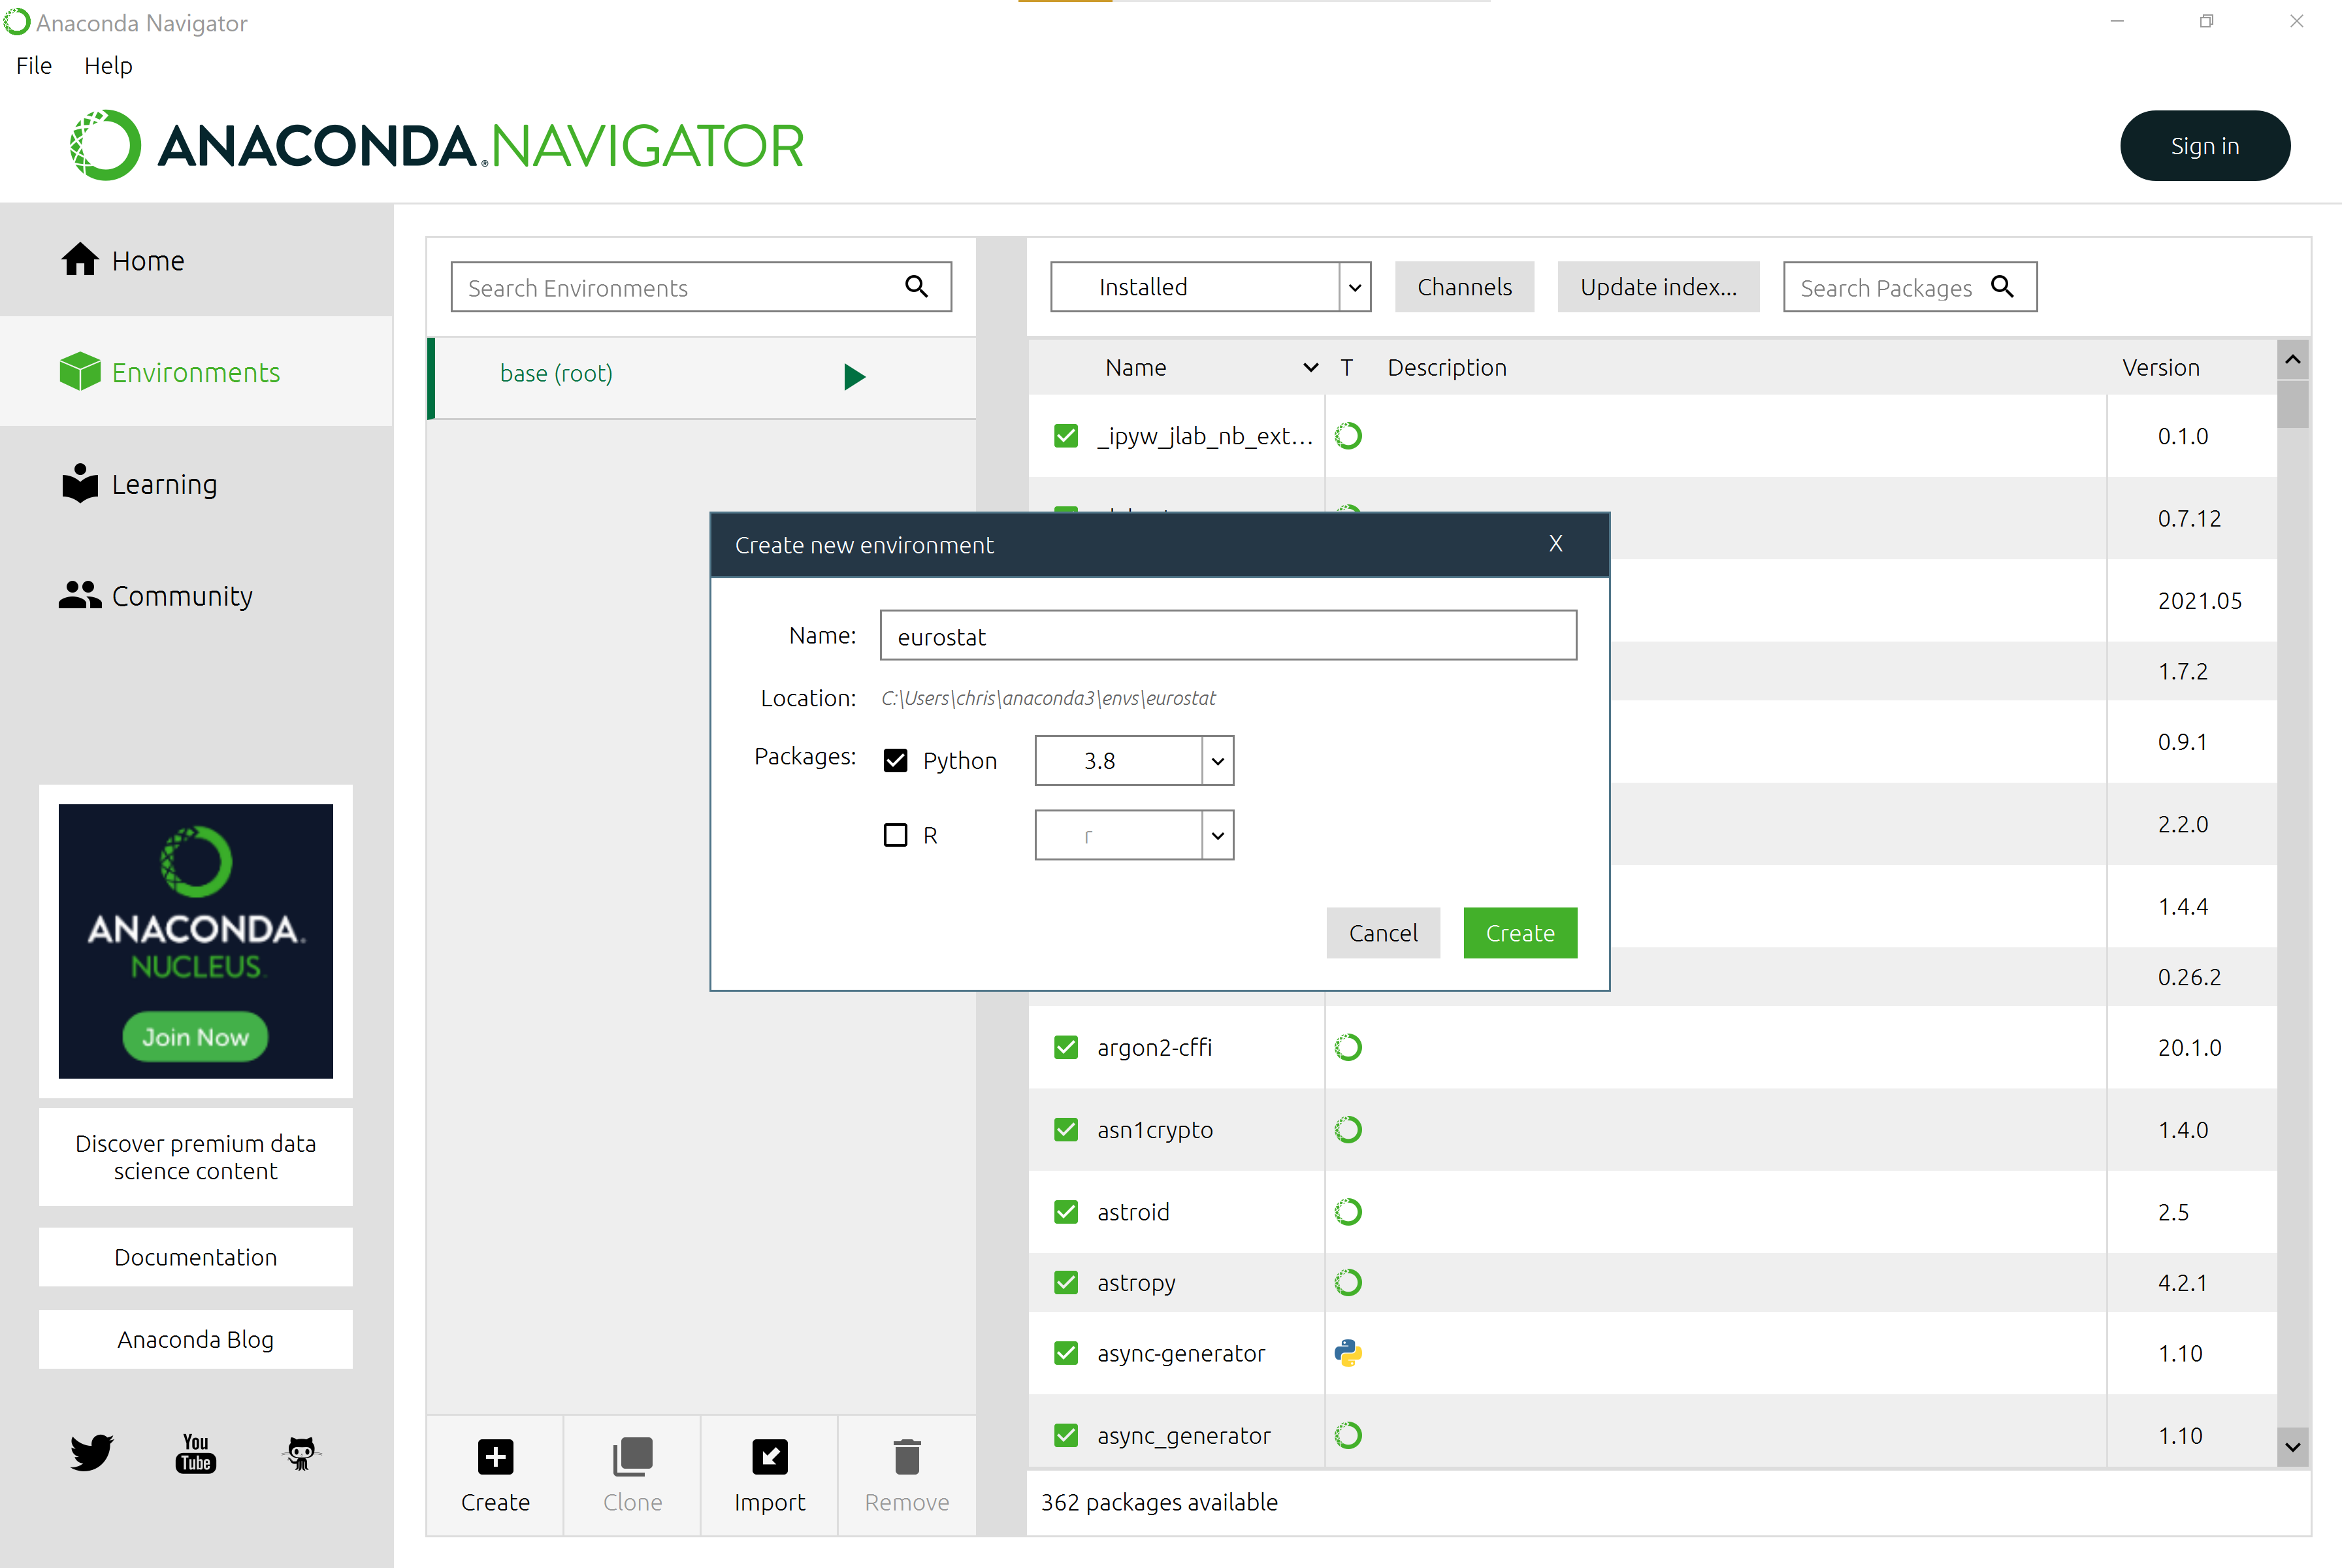

In [38]:
#@title Create Environment
base64_data = "iVBORw0KGgoAAAANSUhEUgAADgEAAAlgCAYAAAAbU3ajAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAALEoAACxKAXd6dE0AAP+lSURBVHhe7N0HfBN1H8fxXwej7BaQoUBLGSJDpooDlVKWIrLcIiqCW3Dr456oCLi1gArKkL1BoajIklXZCnSwd8tepe2T//Vf2tAkvbRpemk/b5688v/9017ucndp63Pf/PzSbAQAAAAAAAAAAMCk1cOv0CPAfdVvjdYjAACAoqdatWp6BAAAAAAAAADm+et7AAAAAAAAAAAAAAAAAAAAAAAAAABgMYQAAQAAAAAAAAAAAAAAAAAAAAAAAACwKL80Gz0GAAAAAAAAAAAAAAAAAAAAAAAAAAAWQidAAAAAAAAAAAAAAAAAAAAAAAAAAAAsihAgAAAAAAAAAAAAAAAAAAAAAAAAAAAWRQgQAAAAAAAAAAAAAAAAAAAAAAAAAACLIgQIAAAAAAAAAAAAAAAAAAAAAAAAAIBFEQIEAAAAAAAAAAAAAAAAAAAAAAAAAMCiCAECAAAAAAAAAAAAAAAAAAAAAAAAAGBRhAABAAAAAAAAAAAAAAAAAAAAAAAAALAoQoAAAAAAAAAAAAAAAAAAAAAAAAAAAFiUX5qNHueLW2a1kLMpZ3SVqUd4b3ms0Uu6AgAAAAAAAAAAAAAAAAAAAAAAAAAAF/NYCHDQmpfl5eaDjHHPeTfIpI5/GWNlWvxY+XLd+7rKrkaZMPkhYpauAAAAAAAAAAAAAAAAAAAAAAAAAACAkucQ4J2/3iyHzxyQsHL1ZPjNU425dtMbGvczblkhpQJLG+M9J3dK7wUdjbErC7pu1CMAAAAAAAAAAAAAAAAAAAAAAAAAAIo2f32fK99s+MgIACoZAcAOM5oY98pts6+SWQkTjHH10jXk/Wu+McauqADhs0v66AoAAAAAAAAAAAAAAAAAAAAAAAAAgKIrz50AL5bRBVApFVhGZtzytzFed2il2+E+ugICAAAAAAAAAAAAAAAAAAAAAAAAAIqyXHUCVEE/1fFvWvxYPZNJBfeeavKaMc4IACYc25qr7n5ZA4UAAAAAAAAAAAAAAAAAAAAAAAAAABQ1ueoEeHE4L6eOfXkN89EREAAAAAAAAAAAAAAAAAAAAAAAAABQFJkOAaog39wuMVLMv7jTEGDGvJnQ3pK90fLmiqd1lTOCgAAAAAAAAAAAAAAAAAAAAAAAAACAosZf37vUceaVxv2p5BPGfVZdw+427sdvHSmTO/5lOqx3XbUI42vnd92gZ1zLazdBAAAAAAAAAAAAAAAAAAAAAAAAAAB8TY6dANccXCYvLu0rgf6BMqXTUikVWFo/4llfrf9Qpsb9rCvHmlduLR9fO0JXQG4kScykibIyUY1DpFWvntIs2HgAXpck8dHRMj82UULCW0lERDNhVwAAAAAAAAAAAAAAAAAAAAAAAAD2cgwBetPB0/vl7t/a6soxs50GTUuKkUkTV4qRCSMUVgRYMwQYHx0l82N1YRMe2U8iwnRhVny0RGUsJDxS+rm9AC/Lur42udpmAAAAAAAAAAAAAAAAAAAAAABgOVFRUXqUO/369dMjFCaHDyfK338vl3bt2knx4sX1rHvOnTsnCxYskKuvvkYqVgzRs4Wfv753af+pPdL/j+7SbnpDo777twhjPHHbj0btKZWDqsj4Dgt15VjGOnhKUkKsDgAqiRKbkKTHQMGJnR8t8XoMAAAAAAAAAAAAAAAAAAAAAAAA+DoVANyzd6/Mmj3bCPO5S32P+l61DLWsosRlCFAF7tTt3vmREnv0Pz0rcmfdh+WSoGrSq04fPeM5lUpWkR7hvXWV3+JlTXpLuAsSV64hfAULiJX50YX8SAxrLpHh6YnrkPBW0pwugAAAAAAAAAAAAAAAAAAAAAAAFCqqo587NxRuqgNgSEiIJCYmuh0EzAgAqu9Vy1DLKkpchgDLFw/WI3u3h90jY9sv0JXnPdboJT1yrO/CrnqUR/FxEquHaueni5U4UoCwgtj5UrhzgMESFtHT+CHdM6KZrfJNSfExEhM9SaIKe2gTAAAAAAAAAAAAAAAAAAAAAAAgD4oXLy633nKL20HAiwOAahlqWUWJX5qNHts5n5osgf7FjE6AWc3tEiPF/L3zIl383Fkt6LpRj3IvPjpK5hspwBBpFRkusfNXitEXMDxS+kXQlqxwSpKYSRMlvQGkbb/36inNLJA+y3oshoeLxMbqDpUhraRXT5MBufhoiUpfCMewtyTFyKSJvG8AAAAAAAAAAAAAAAAAAAAAAIq2qKgoPcqdjC6AGcuhK2Dh5k6ojwBgOqedADvObGrc+/llfkm9Cg29FgDMf/ESd6ENYLiEhoVK+IVmgHG2R4GCEdI8QlplHIuJKyU6JkkXAAAAAAAAAAAAAAAAAAAAAAAAgG8z2xGQAGAmhyHAbzd8bNwfOZso829bb4xV572vb5wgY7fkLZnrjneu/lKPshuxaage5U5SzGrJyACGt1Cd1oIlNDMFKKsJXqHABEuziFaSmQOMFg5HAAAAAAAAAAAAAAAAAAAAAABgdaqDnzs3FF05BQEJANpzGAKcFDvKuO857wbjXgUAlXbTG8rNl3Y2xt5wbdWb9Si78VtH6FFuJElCbKIeh0vtsPRRcGh4ZvAqNsH2VUABCW4mLcL1WBJlZXQMxyMAAAAAAAAAAAAAAAAAAAAAAAAKDWdBQAKA2fml2ejxBSrsp7zeaojcWL2DMc6YywgEekvG8zqS63VJipFJE1eKEQMMj5R+EToFKEkSM2mirDQeCJFWvXpKs2DjAeeyLiuklfTqqboK2qaT4mVN9GqJtR1sGUJCwiW8RXNpFpbTQtMlxcdIQlysxCYl2g5aPWmTsZxQ23LMLUlJsi0vQdasjpUk28KyrJVtecHmlpeUJPEJa2R1bJJxEmXKXEaO25aPr5eiXjO1jVmXY1uQhIe3kObNwmzP5d4+9uw+cC4+OkrmG60ps65TvERHzc/sWBnZTy4cqo7ER0tU+kIuOq4dy822JcVMkonpL55t9/WSnjmeIDZO1yvr9oVLZL8Icb3GFtm/WbfHpRye3xPnk932ZnkNbedTdLTttc1YrO1c62c71wAAAAAAAAAAAAAAAAAAAAAAyA9RUVHGfT83u/td/H25XQ5828WhP4UAoD2nIcAJHf6QkJKV5cHoW+WHiFkX5gtDCDBrkOniYJXbIScHobYj0ZNk/oX0jQPhkdLL9qROlxwfLZPmx2YJ6jmRJUTnSpJtedEmluc8ZJZkW6Vo19uUISRcWkVEuAg+5cPrpVwcenLEtm6REc1tz2ciJObhfZATxyFAG7vAWQ5Buaxf6yoEmJdty7r/TAX3XIXy3AgBmt2/PW3710wIMC+vgd0+ccXZ83vwfHIUAnS0bbbtIAQIAAAAAAAAAAAAAAAAAAAAILcyglmeQsCr8CEEiLzKGgRUCADa89f3dn5q96sRAOw480rZeSL+QhDvqxt/Me59W5IkXAjfhEvti1JHwaHhkp4XFUmMTbB9tXuOxGQE2kIkvFUriYyMlMhWtmVmLFSJnS/RMc6XHB+XNcCjupy1klZqOZG2+/AsC0pcKROj43XhWHz0JJloFwhKX56xXnp5WVctu3iJnjTRLrBkdElrpb5fbVsr2/KyrlOsrJw4SVxsnh1PvF7GOk60D4iFhIfr1yzSto16n9rWbX70mpyDXzae3Ad5EhYhkeF6LGr98/5cedq24FDJ/JJYictpdZISsnSjC5dQp2E2F4zgocn9O8kL+7dCc+N5LxyreloF7S7MG7cWDrY3f88n47UyE24EAAAAAAAAAAAAAAAAAAAAAACAz/Bz1AlQUQHA86nndZXO210AFY93AsyxW1rWzlrqS5x1x9PsOqOlC7EtN8JB57qsXQZddT4zusIlhUurFs2lWZiD1JRdJzLn3c7sny/Eti0Rtm1xlMJKkviYNXKkQoTt+fSUwf61UCGuyAjbOjtaxMVf62z7PP56XbyOzjrzqW2MlvmZK2jj/LXz1D4wy2knQEPWjnkujskcj+10ed02u/3iquOgjevOmlm3ywP7N1t3PS/s36zHcw6vRfZt8cD5ZPd14RIeHiuxttW2P6fUsZ8gYc3oBAgAAAAAAAAAAAAAAAAAAAAAyB90AkReZO0CqDoAKhljugGmc9gJ8NT5E9kCgIWF6gCWIfziNoCGYGnW4kLrNYnNsdXZRUJaOQy0KcHNIqTVhSZfLrqoGUEnFchzmA66qDtcosQmOGgTlhQj0ZlpIyPE5DgAqARLmG3d7AOANvFr7ENItnVyugj1uvXsZbd9q820L8vr65V1HZ0GxBS1jT2zvG458MQ+8JgwaZ75Qkjs6hjJ07PlcduCm7WwHQ1abJw4P0Psu262cJiiy4E7+zfC4vs3388nHQBUYUu7c0od+wQAAQAAAAAAAAAAAAAAAAAAAACA9VwcAFShP3VTYzWnHlNfU9Q5DAGWCiyTrcueqmclTNCVr4qXzAxguDjMACphtU2GnC4WIq0inIWUlGAJDc8McyUdcRzqUYEd58tIF1bbddopKSE2vTuZTUiriFx0qUuSmNVZApORjrqQXSxYmkW0sr0K6RJjE3IIq+X19bpoHVuYeN2aZ66fK57YB55kF4hMXCnRZgKWTuR928Ik82EXYdakBMnMANY2cfxcrDDtX2+cTzYhrSQiN2FLAAAAAAAAAAAAAAAAAAAAAAAAL3MUAFRd/9SNIKA9hyHAdtMbytpDK43gX4PgK6XtZbcY88PWvi2L9y4wxgXNz/bPbfFxkpkBdBVKMhlyulhIuITmkL8JrpD5BYmJR/Qob7IvxwMd2OSIbbl6GNJKmptNcAWHyoXcXmKsuGyglufXKxfrmHX9PMhT+9K5iwJhK6MlDzlAtzjatqwBOWfdMrMGUR133cxJYdq/XjifbMwEJQEAAAAAAAAAAAAAAAAAAAAAsJqoqCjjhqLDWQAwA0FAew5DgB1rdpPnlvSRLrNbyRdtxsqrLT6W9jOaGI+9teIZ494bNhxeo0fZ3X/543pkXnxmG8AcQ0l2IafVMTl34Mo3SZIUHy/x8TESEx0t0ZMmyaRJtje2+Znbkk3WDmy2A72CHrol6UjmNgdXcCNYFCyZub1EyddsXK7X0V252Af5IbiZRGS2A5SV0Z44LnO5bTl2y8wSRHUn9JZVYdq/XjmfQiQkVyc7AAAAAAAAAAAAAAAAAAAAAACA9+QUAMxAEDCTwxDg883eM+5Pnz8lk2NHS1paqvx22zrj5k0DFt+vR9n1ru9mCDApRlZnyfTEzk9PCDu9ZQ0AmejA5VlJEh8TLZOMdZkoE+fPl/nzV8rK2FiJtR2wtv+Zl9vw1BHb8+hhiJvJogq2E8sr8rCOOfPgPvCg4GYtMsN3iStljdkulXY8sW1h0vxCINFBt8wsQdSQ8FCvH4M58/L+9cr5lDUwCAAAAAAAAAAAAAAAAAAAAACA7+jXr5/dDYWX2QBgBoKA6RyGALPqEd5bImc0lnbTG8raQytlQdeN+hHfkpQQeyGE475EifVWCjApXqKjJsr8lfbrqw7UkJBwCQ9vJa0iIyXyQgALHmfpfRAmEZFZulTOj3bQhc8FD25bcGi4XIgBXpQCjF+zUi8/RMJDLZZM4xwDAAAAAAAAAAAAAAAAAAAAAADwOncDgBkIAroIAZYuVlYuD26sq3QvLH3YCAN6g6vnqVfB3XVIkoSMtmQ2IeEq6GPmlhkCSoxNsC0lvyVJTPR8yehBGBLeSiJ7pSeYe/bsabtFSEREM2kWFiZhXmz5lZh4RI/MOXKhjVqIeLyBmxPurqNz1twHdsIiJDMHGCvzo83GAD28bcGhcuEUiY3LEkaMl7iMJwlvIc088DIVpv3rC+cTAAAAAAAAAAAAAAAAAAAAAAC5ERUV5dYNRcuCBQuMEJ87AcAMFwcB1bKKEqchwOmdl8uXbcbLy8se0TP28jMMOD1+nB459vWNE/TIpKQEuZABDGklEREq6GPm1kIuZK0SYyXfmwHGr5GVGesZHik9I5pJWG5ySMEV5MK32YWz3FAh5EKXN0k64kYAMkmOXPjiYMnXnFyu1vGI7UTXQ0c8tQ/yWVhEZOaxGbtaYsxsvMe3LVhCM1OAcqEZYHzchZBdeO0wPcqFwrR/feF8AgAAAAAAAAAAAAAAAAAAAAAAyEdXX32NVK9Wze0AYIaMIKBahlpWUeI0BJhh1YGlepTdM3/dq0eeczbljHyx7j1dZedn++eu+DUrJSP3ExIemhmQy1GYNG+VEd1JlJVrchWnMy0pM+0jITm0/Mr6tdlVsH2/HmYNZ7kja5e3xJVietPtApchtjXJR1nDjmZDmlkCao54bh/ktzCJuNAO0HZsRsdIUtagmQP5sW3BoeEXnjNWH2jxGW0AQ1pJ8zxkAAvV/vWF8wkAAAAAAAAAAAAAAAAAAAAAgFzq169fnm4oGipWDJHOnTvnKgCYQX2vWoZaVlGSYwjwnau/lED/QF3Z25j4jzzyezdd5Z0KAN4yq4WuHJvfdYMemRUvGZkkkRAJD3WvlVbWkFOuu+p5XLysudDOzJFgadbiQp84iZ0fnYv1ztrlzbaM1TEmupclSUx0ZuAyvEWzzBBXvgiT2pmtGk2ENG3rt9pVRMwdOe0DLwhrLpkZ1ZUSvcZT6+PGtgU3kwuHmnF+ZJ5v7gVuHfGx/euyw58vnE8AAAAAAAAAAAAAAAAAAAAAAACwohxDgDEHl8uUTktkQdeNF25Kxnj4zVONOq/m7ZiaYwDw6io36pEbsnYGCwkXNzOAKgWY2cErt131TAqukLlyiSvXSLyjlFBSvERPmu+y25kha0DM9tXzJ0U7Xp4hSeJjoiXmom0LbhZhFzKbmNMyoifKhdxUXrvAmRTWvFWWkOZ8mRQd7zhcZXvdYiZlWT8nPLoP8l2wNIvI3P7E2NgLgTFH8mvbwi4k9WznR0zG+eZ+4NYRy+9fu26FiXJEDx3xhfMJAAAAAAAAAAAAAAAAAAAAAAAA1hPwlo0eO3RVlRuk08xmMvq/ry/cel/+hNzzWzv5c8+vMnZrlHy9fpAxf3e9RyTAL0B/p3ntpjeUpfsW6sq5Ue3m6JF58WsWSJwO2oQ0uk5aVAtKL0wLkpJn42XTntNGleQXIi1qZwk3ndknmzbtEePRoEul4RXVbN/hwpF4WX1hhcLtlxXsJ0dWx+mQU5LEbYqX+CNnJcjvjBw5kiBr1iyRBYs3StLpEGnVqrrs2eNkOYYgqXZFiO3pbMtTK3daLW+1rI4/IkfOHhW/M1mWuWC1xNmWFRTeQuwXo5eRsU56GfG2Zew962dbhm1ZWZehV0etT2TPa6WaLu148vVSgqpJNf/M/XM6KU42rY63rddZ8bvodVNfEtIqUhqdiTPGavsubXiF2B0SHt0H5h2Jz3j9HKyTKxdt/wWO1ie/ti3LcpMyvif8ern1ipxejyMSf2F9QiS8Re3sne58YP8ejd+kn8+2vHjbup0NMs6NhDVrZF9w7SzPnw/nk5yRfZsynt/JawgAAAAAAAAAAAAAAAAAAAAAAACflmMnQCWj+19WB07vlU2J/8jek7v0jBhhwfRA3+96xjn1fepr1c0MR+uQs3iJu9DOK/edyYJDw7N0I1stMRnhHI8Lk4heWTqfSaIkxq6U+fPn224rJTZWtQWzbUdkT2lWIf0rXLMtr2cvaZXZytC2yFiJXXnxMl2xLaOf/TISjWWo78++jJDwSOnVM8L2Xd4T3Kyn9Mpse2iTaFun7NsY0qqX9MzxhfP0Psh/dh3mXMqvbQuTC80AtfDanjsCrL1/7bsxqm6AGefGylhHbxTWP58AAAAAAAAAAAAAAAAAAAAAAABgLaZCgMrodvP0KGdv/P3khYCfs9v9Czror85Z7gKAIkkxqyUzAxguucwAqhSgZGZ2EiU2Id9SgCrxJD379ZJI2xOGZM09ia1WgaBePSXCrUSQCin1lH69Io3gkf0ybUu1TYS3Usvt52K56cvo5WQZaiK8VSuJtC2jp20hBdGJTAXFLmyjnkunXje9bs1MrpnH90F+s+2fFhel8JzJp20La541WBcuHswAGiy9f9XybOsWftGJERISLI5zhNY/nwAAAAAAAAAAAAAAAAAAAAAAAGAdfmk2epyj7cdj5eGFtxmhPBXk84bcBgABFEXxEh01X4d/wyWyH130AAAAAAAAAAAAAAAAAAAAAAAA4NtMdwJUapUNl3ld/tFV/iMACMAtSUfkQp/OkBAnnfgAAAAAAAAAAAAAAAAAAAAAAAAA3+FWCFAJ9C9m3D/W6CXjPj80q3wNAUAAbktKiJVEPQ4JD5VgPQYAAAAAAAAAAAAAAAAAAAAAAAB8lV+ajR7nyu1zrpETycd1lXeE/wDkSlKMTJq4UocAQ6RVr57SjBQgAAAAAAAAAAAAAAAAAAAAAAAAfFyeQ4AZBi7uLesPr9aVe2qWrS3ft52pKwDQkmIkOjpRakc0l7Bg54m+pPhoiZ6f2QVQwiOlX0SYLgAAAAAAAAAAAAAAAAAAAAAAAADf5bEQYFZjtnwrP2z+QleO9Qx/QB5t9KKuAMABu+5+IiEh4RIcHCK1a1eQI0fiJDExSZJiEzPDf0pIK+nVs5nQBBAAAAAAAAAAAAAAAAAAAAAAAACFQb6EAAHAIy4KAeYkJDxSIiLCCAACAAAAAAAAAAAAAAAAAAAAAACg0CAECMDikiQpPkHWxMVKUlKiJNq3/ZOQkGAJDq8tzZsR/gMAAAAAAAAAAAAAAAAAAAAAAEDhQwgQAAAAAAAAAAAAAAAAAAAAAAAAAACL8tf3AAAAAAAAAAAAAAAAAAAAAAAAAADAYggBAgAAAAAAAAAAAAAAAAAAAAAAAABgUYQAAQAAAAAAAAAAAAAAAAAAAAAAAACwKEKAAAAAAAAAAAAAAAAAAAAAAAAAAABYFCFAAAAAAAAAAAAAAAAAAAAAAAAAAAAsihAgAAAAAAAAAAAAAAAAAAAAAAAAAAAWRQgQAAAAAAAAAAAAAAAAAAAAAAAAAACLIgQIAAAAAAAAAAAAAAAAAAAAAAAAAIBFEQIEAAAAAAAAAAAAAAAAAAAAAAAAAMCiCAECAAAAAAAAAAAAAAAAAAAAAAAAAGBRhAABAAAAAAAAAAAAAAAAAAAAAAAAALAoQoAAAAAAAAAAAAAAAAAAAAAAAAAAAFgUIUAAAAAAAAAAAAAAAAAAAAAAAAAAACyKECAAAAAAAAAAAAAAAAAAAAAAAAAAABZFCBAAAAAAAAAAAAAAAAAAAAAAAAAAAIsiBAgAAAAAAAAAAAAAAAAAAAAAAAAAgEURAgQAAAAAAAAAAAAAAAAAAAAAAAAAwKIIAQIAAAAAAAAAAAAAAAAAAAAAAAAAYFGEAAEAAAAAAAAAAAAAAAAAAAAAAAAAsChCgAAAAAAAAAAAAAAAAAAAAAAAAAAAWBQhQAAAAAAAAAAAAAAAAAAAAAAAAAAALIoQIAAAAAAAAAAAAAAAAAAAAAAAAAAAFkUIEAAAAAAAAAAAAAAAAAAAAAAAAAAAiyIECAAAAAAAAAAAAAAAAAAAAAAAAACARRECBAAAAAAAAAAAAAAAAAAAAAAAAADAoggBAgAAAAAAAAAAAAAAAAAAAAAAAABgUYQAAQAAAAAAAAAAAAAAAAAAAAAAAACwKEKAAAAAAAAAAAAAAAAAAAAAAAAAAABYVOENAW4bJtf6+Ymf37UybJueQ+HDfgYAAAAAAAAAAAAAAAAAAAAAAABQiNEJEAAAAAAAAAAAAAAAAAAAAAAAAAAAi/LZEODc/qr7m+3Wf66eAQAAAAAAAAAAAAAAAAAAAAAAAACgcPFuCHBu//Tgntu3/mIX9ds2TN6N0uOod2XYNj1GHm2TYdfq1zxX4cq8fj8AAAAAAAAAAAAAAAAAAAAAAAAAICuf7QQIAAAAAAAAAAAAAAAAAAAAAAAAAEBhV0AhwNYydGuapKWZvX0nnfR3GuoMkNf76XG/12VAHT0GAAAAAAAAAAAAAAAAAAAAAAAAAKAQ8dlOgJ2+0wHB7+zigQAAAAAAAAAAAAAAAAAAAAAAAAAAFBo+GwIEAAAAAAAAAAAAAAAAAAAAAAAAAKCwIwQIAAAAAAAAAAAAAAAAAAAAAAAAAIBF+WwIcG5/P/Hzs936z9UznrBNhl2rl2t36y+efBbYu7Av7W7XyrBt+gs8ZdswuTbb82S9sZ8BAAAAAAAAAAAAAAAAAAAAAAAAWAudALX0IFpdGbhMT9iJks4qJObRwCG2DbvWCN91jtITdpbJwLq21/zaYZL3LOBc6a/2X92BtqW6ovczYUAAAAAAAAAAAAAAAAAAAAAAAAAAFkEIUHf/uxBE6zdH0tLS7G5z+unHojoTBPQQFbqsm5G4bD1Utl70mm8d2jr9sWUDpa5HgoDp+s2xf56stwvPqcOA7GoAAAAAAAAAAAAAAAAAAAAAAAAABa3IhwC3Det9ofufERD7rlN6kUWn77IExKI6Ew7Lq7n9L4QuWw/dKmlLB0id9PKCOgOWSlpG+nLZQOk9zFMxQOeM50zbKpm7+lrxwtMCAAAAAAAAAAAAAAAAAAAAAAAAgFNFOwS4bZj01glAFUZzkP+7oM6A0ZnhsHc915mu6Jkr/TMSgP3myNIBF8f/suj03YUujMsGfmL7Tm+oIwOWzpH0p10mAz8h8QkAAAAAAAAAAAAAAAAAAAAAAACg4BRQCHCZDKzrJ35+Jm752HZv26wJtjWxaT1URrsKoxnqyIDXMxJpE2RWYU8BRnV2vD9c3upe6Kro1Nxpkh4B7CdzXKUutU4vDJX07GWUTPNaHq+TfJeRPox6l26AAAAAAAAAAAAAAAAAAAAAAAAAAApMEe4EuE1mTdBdAO+4VXKKABrqNtCBtGWyeasxgJvmTsvoAni75BwBtKlTXxrr4fr/vJjG63T7hW6AEwp94hMAAAAAAAAAAAAAAAAAAAAAAACAVRVQCLC1DN2aJmlpJm4musXlzlbZrLvWNa5vKgJYcIG0gtBvjuP94fK2VYampySd2Cb/rU8ftW5QN32Qo7rSQC9zmVeTlwX1vAAAAAAAAAAAAAAAAAAAAAAAAACQqeh2Atz2n+g8mkR19hM/PzO3zqL72CFXMoOXywbWdfD6OrrVlYH6e7yrjtTPTHwKvQABAAAAAAAAAAAAAAAAAAAAAAAAFISiGwIEAAAAAAAAAAAAAAAAAAAAAAAAAMDiCAHa9JuTJmlp7t2WDqijvxu50XroVoevq8vbd530dwMAAAAAAAAAAAAAAAAAAAAAAABA0VB0Q4B16ktjPYS31JUGrfXQlzSuL0Q+AQAAAAAAAAAAAAAAAAAAAAAAABSEItwJMDOQFjVtbvoA+ayO1NfJy2UTZsm29KFFzZVpUemj1g3qpg8AAAAAAAAAAAAAAAAAAAAAAAAAwMuKcAgwM5AmUdOEGKB31M1IXi6bILOsnAKcO03SM4Ct5Y5b6QMIAAAAAAAAAAAAAAAAAAAAAAAAoGAU4RCgSKcXhkp6JC1K3h1m7b50hUWdAa9LP2O0TAZ+YtXo5TYZ9m5GG8A7hAwgAAAAAAAAAAAAAAAAAAAAAAAAgIJSBEKAy2TzVj28WJ0B8np6Ik2WDawr/WkH6AWd5IWhuhtgVGe51mPhSxf7OYuoaTnv5G3DesvAZenjfq8PEDKAAAAAAAAAAAAAAAAAAAAAAAAAAApK4Q0B1rlV7riQNbtWnGXNOn23VTIzaX7id+0wcRZL2zbsWpePw5w6A5bKnCzhSz+//uI0mje3v+vHTe7nC6I625bn5yR8OFf62x6rqxOArYdule86GUMAAAAAAAAAAAAAAAAAAAAAAAAAKBCFuBNgHRmQ0eZPlsnAus4CfravW5p2IZQmywZKXT/b1zq4GeGwZZvFRMM55KDTd2myNSN9KVHS2cHrbdw6R9keXy//OQ33md3P9tLDhxc9l19n25qk6zcnTZYOoAcgAAAAAAAAAAAAAAAAAAAAAAAAgIJViEOANp2+k7S0OZIREZPG9cVZrEuF0tLSsoQBHVCd4dLSvhOaw3mG6gioXvPMMKAD/ebYvmapuMzjubGfVbjP1XOm7+M0OgACAAAAAAAAAAAAAAAAAAAAAAAAsAS/NJV4Agq1udJfd/lTIUACfgAAAAAAAAAAAAAAAAAAAAAAAAB8ReHuBAgAAAAAAAAAAAAAAAAAAAAAAAAAgA8jBAgAAAAAAAAAAAAAAAAAAAAAAAAAgEURAgQAAAAAAAAAAAAAAAAAAAAAAAAAwKIIAQIAAAAAAAAAAAAAAAAAAAAAAAAAYFGEAAEAAAAAAAAAAAAAAAAAAAAAAAAAsChCgAAAAAAAAAAAAAAAAAAAAAAAAAAAWJRfmo0eAwAAAAAAAAAAAAAAAAAAAAAAAAAAC6ETIAAAAAAAAAAAAAAAAAAAAAAAAAAAFkUIEAAAAAAAAAAAAAAAAAAAAAAAAAAAiyIECAAAAAAAAAAAAAAAAAAAAAAAAACARRECBAAAAAAAAAAAAAAAAAAAAAAAAADAoggBAgAAAAAAAAAAAAAAAAAAAAAAAABgUYQAAQAAAAAAAAAAAAAAAAAAAAAAAACwKEKAAAAAAAAAAAAAAAAAAAAAAAAAAABYFCFAAAAAAAAAAAAAAAAAAAAAAAAAAAAsihAgAAAAAAAAAAAAAAAAAAAAAAAAAAAWRQgQAAAAAAAAAAAAAAAAAAAAAAAAAACLIgQIAAAAAAAAAAAAAAAAAAAAAAAAAIBFEQIEAAAAAAAAAAAAAAAAAAAAAAAAAMCiCAECAAAAAAAAAAAAAAAAAAAAAAAAAGBRhAABAAAAAAAAAAAAAAAAAAAAAAAAALAoQoAAAAAAAAAAAAAAAAAAAAAAAAAAAFgUIUAAAAAAAAAAAAAAAAAAAAAAAAAAACyKECAAAAAAAAAAAAAAAAAAAAAAAAAAABZFCBAAAAAAAAAAAAAAAAAAAAAAAAAAAIsiBAgAAAAAAAAAAAAAAAAAAAAAAAAAgEURAgQAAAAAAAAAAAAAAAAAAAAAAAAAwKIIAQIAAAAAAAAAAAAAAAAAAAAAAAAAYFGEAAEAAAAAAAAAAAAAAAAAAAAAAAAAsChCgAAAAAAAAAAAAAAAAAAAAAAAAAAAWBQhQAAAAAAAAAAAAAAAAAAAAAAAAAAALIoQIAAAAAAAAAAAAAAAAAAAAAAAAAAAFkUIEAAAAAAAAAAAAAAAAAAAAAAAAAAAiyIECAAAAAAAAAAAAAAAAAAAAAAAAACARRECBAAAAAAAAAAAAAAAAAAAAAAAAADAoggBAgAAAAAAAAAAAAAAAAAAAAAAAABgUYQAAQAAAAAAAAAAAAAAAAAAAAAAAACwKEKAAAAAAAAAAAAAAAAAAAAAAAAAAABYFCFAAAAAAAAAAAAAAAAAAAAAAAAAAAAsihAgAAAAAAAAAAAAAAAAAAAAAAAAAAAWRQgQAAAAAAAAAAAAAAAAAAAAAAAAAACLIgQIAAAAAAAAAAAAAAAAAAAAAAAAAIBFEQIEAAAAAAAAAAAAAAAAAAAAAAAAAMCiCAECAAAAAAAAAAAAAAAAAAAAAAAAAGBRhAABAAAAAAAAAAAAAAAAAAAAAAAAALAoQoAAAAAAAAAAAAAAAAAAAAAAAAAAAFgUIUAAAAAAAAAAAAAAAAAAAAAAAAAAACyKECAAAAAAAAAAAAAAAAAAAAAAAAAAABZFCBAAAAAAAAAAAAAAAAAAAAAAAAAAAIsiBAgAAAAAAAAAAAAAAAAAAAAAAAAAgEURAgQAAAAAAAAAAAAAAAAAAAAAAAAAwKIIAQIAAAAAAAAAAAAAAAAAAAAAAAAAYFGEAAEAAAAAAAAAAAAAAAAAAAAAAAAAsCi/NBs9BrziTMoZOX3+pJxSt+T0ez8/PwkKLC2lstxKBJTQ3wEAAAAAAAAAAAAAAAAAAAAAAAAARRMhQHhNSlqKfLX+E5kU+7Oeca2YfzGpXrqG1CwTJjXLhtputnvbuE75ywkIAgAAAAAAAAAAAAAAAAAAAAAAACgSCAHC6xbtWSCD1rwuJ5KP6xn3qHDgFSFXSvPKV0mLylfLFcFXSqB/oH4UAAAAAAAAAAAAAAAAAAAAAADAfampqbJ91y7ZGhcv22y3rfHxEr9jpxw7flxOnDxpu52Sk6dOyknb/bnkZP1dQP4oXqyYlC5dSkqXKi1lbPdlSpeWcmXLSljNGlI3LEzq1q4tdWqHSq3LLhN/f3/9XSisCAEi186mnLXdTku54hX0jHn7Tu2Wt1a8IJuS1umZ3CsZECRXVblW2te4TVpXbWOEBAEAAAAAAAAAAAAAAAAAAAAAAFw5feaMLF+9Rv5atlwWLf9b1m7YKGfPndOPAr6hRPHicmWjhtLmmqvlhtbXyDUtmktQyZL6URQWhADhtt0nd8q0+F9k8Z6FMrLtRCkVWFo/ki5611xZsX+JPHPlK9key+p86nkZuvY9mZkwSc/kXbni5aXtpR2lQ83bpGHIlXoWAAAAAAAAAAAAAAAAAAAAAABAZO/+AzJh+gyZG71QVq9dR+gPhY4KBba4sol0imgrd3S9TapVuUQ/Al9GCBCmpKalyvL9f8nUuHFGwC/N9u+RK56R++s/or8iXXJqstw3/1bZe2q3VC99mbze8qMcw3g//TdcRmz63FimJ9Wt0EB61+8nbaq3Ez/bPwAAAAAAAAAAAAAAAAAAAAAAUPScOnVaps/7VcZPnWZ0/EtJSdGPAIVbQECA0SHwrm63S9eOHaRUqSD9CHwNIUDkSHX2G77pM9lzcpeeUR33KsiEDr9m6/Q3Ydto+XL9x7oS8ffzl/vr95M+lz8mAX4Beja7+TtnyaA1rxshQk8LLRtuhBUjLutsrA8AAAAAAAAAAAAAAAAAAAAAACj8du3ZI0O/HS5jpkwxgoBAUaYCgPd27y4DH31ELqteXc/CVxAChFNbj2yWz9YNknWHV+uZTH2veNrospfVieTjctdvHeXYuaN6JlOzSq3krasGS3CJinomu5hDK+XV5U/JyeQTesazLi1dU55s/IJcV+1mPQMAAAAAAAAAAAAAAAAAAAAAAAqbuO3bZfBX38ov06ZL8vnzehaAUrxYMbmj623y/BOPSu1atfQsrI4QILI5cjbJ6Pw3e/sUSU1L1bOZivkXk8kdF0qFEsF6Jp36np/+G66r7CqVvETeuXqINAppqmey23r0X3l+ST9JOpuoZzzvuqo3yTNXviJVS12qZwAAAAAAAAAAAAAAAAAAAAAAgK/bvW+fvPnRYJk8a7akpKToWQCOBAQESI9bb5G3X3peLq1aVc/CqggBws7Rc0ky5J/3ZNWBZXI8+Zietdeuxi3yRsuPdJVOde/rOa+dnDzvuotfoH+gPNn4Rele+x49k92OEwny0MIeci7lrJ7xvJIBJeX++v3lrrp9jFAjAAAAAAAAAAAAAAAAAAAAAADwTedTUuTLEd/LR198JSdPndKzAMwoXaqUvPz0k/LEww9KYECAnoXVEAKEU7tP7pDNiesl5tBKIxS499RuY/6rNj9J44rNjHGGMVtGyncbh+rKtc61usnLzd/Vlb0027/BMW/LzIRJeiZ/1SlfX965aohcVob2pQAAAAAAAAAAAAAAAAAAAAAA+JolK1bKs6+/JZu3btUzAHKjQd26MuTdt+S6q1rpGVgJIUCYtufkLtmY+I9E1rhVz6RLTj0nvX5tL4lnDukZ566repO8f83n4u/nr2cyeTsAmKFUYGl5sdnb0vayjnoGAAAAAAAAAAAAAAAAAAAAAABY2bnkZHn1vQ9k+M9jhWgM4Bl+fn7yyH33yAevvSrFixXTs7ACQoDIMxXa+yTmLV05p7oHDrluhJQIKKFn7H2+7kOZFDtGV97XNewOebrJy1LMv7ieAQAAAAAAAAAAAAAAAAAAAAAAVpOwY6fc/+TTsnbDRj0DwJOaNmoko7/8TEJr1tAzKGiEAIu41LRUh1353HHq/EmZt2O6TIkbJzuOx+tZe2Hl6siXbUZL2WLl9Iy9kZu/lFH/fqurgtMguLF8fO3XUr54sJ4BAAAAAAAAAAAAAAAAAAAAAABWMW3uPHny5f/JsePH9QyA/FCubFn56qMPpGvHDnoGBYkQYBE3e/sUidr4mdQpX9/uVqtseK7CgasOLJPJcWNl2b4/jYChElKyknx34zipUqqaUV/sl22j5Kv1n+iq4NUoEyqfXhclVUtV1zMAAAAAAAAAAAAAAAAAAAAAAKCgvfHRJ/JZ1AghCgN4h5+fnzzTr6+889ILegYFhRBgETdx20/yxfqPdJVJdey7slJLaV75atvtKqOTn5/tn1n7Tu2WaXG/yPxds+X9qz+Ty4Mb6UfsqRDiR2ve0JV1VCp5iXx63Xe27a6rZwAAAAAAAAAAAAAAAAAAAAAAQEFQ0ZdHX3hJxk2ZpmcAeNM9PbrJNx8PMkKBKBiEAIuQMylnpGRASV2lG/3fdzJi0xe6ck51xxsTOUtXnvH77l/l7ZUvXOgYaDUqCPnxtd9Iw5Ar9QwAAAAAAAAAAAAAAAAAAAAAAPAmFXt56d335dsfR+sZAAXhsQcfkEGvvUoQsID463sUctuPx8mITZ/rKtOp5JN65NoVIY31KFNy6jlJs/3LjW1H/5P3Vr1s2QCgcjz5mLyw9FGJP7ZVzwAAAAAAAAAAAAAAAAAAAAAAAG9RAcDHX3qVACBgAd/8MMo4H+lHVzDoBFgEHD5zUB77815pXLG5vN5ykJ5NN3TtezI1bryunHv/ms/khmoRuko3OXaM7XvHye2175ZOtbpK6cAy+pGcLdg1RxLPHJKSgUFSMiDIeAM4m3JaTqvb+VOy/9Re2XVyh+w6sd1Y/4JUOegS+brNGKlSqpqeAQAAAAAAAAAAAAAAAAAAAAAA+UnlDJ546VX5edJkPQPACu7r1UO+GvQBHQG9jBBgIacCdU/+9YBsPbJZ2l7WUd5qNVg/km7QmtdlzvapunJMhfRm3rJYSgSU0DPpVJe8v/cvNsZBgaWkfY1bpXvteySsXB1jzlNUR75/Dq2UNQdX2G5/S/yxbfoR76lZNky+bvOTlCteQc8AAAAAAAAAAAAAAAAAAAAAAID8oKIuL7/7vnxDB0DAkh7r01sGvf4/goBe5K/vUQilpKXIGyueNQKAyvnU88Z9VgF+AXrkXItLrskWADyTckZiDq3UVXrYcHr8BPk45k3ZcTxez3pG2WLljC6EzzR5RUZFTJOxkbOlz+WPSfXSl+mvyH9qm15a9oQkp57TMwAAAAAAAAAAAAAAAAAAAAAAID88+sJLBAABC1Pn52MvvqwreAMhwEJscMzbFzr1KSoUeLFA/0A9cq5ZpVZ6lEl15DuXctYYq2W0u6yzfHfTOPnmxjFG17z8dFmZWvJQgydkfPt5Muz6kdKi8jX6kfy1MXGtfLXevpMiAAAAAAAAAAAAAAAAAAAAAADwnDc++kTGTZmmKwBWNXbyVON8hXcQAiyk5u2YIbO3T9FVuhQHnQAD/YvpkXOOQoDL9y0SP9u/tpd1lJ/bzZI3Wn0sDYIb60e9p3nlq2Xo9SOM8OHVVa7Xs/lnStxY+XPPfF0BAAAAAAAAAAAAAAAAAAAAAABPmTZ3nnwWNUJXAKxOna/T5/2qK+QnvzQbPUYhcejMAem9oKucSD6uZ9K1vKS1DLluuK7SfbPhUxm39QddZVe2WDmZecti8fezz4t+sPp/0q32XQUS/HNlyd7f5bN1H8q+U3v0jOeVLlZGvm87WaqVulTPFC3nkpNl38GDEly+vJQtXVrPFrzd+/bL+ZQUKVmiuFSpVEnPIq/UvlaqVq5s3BdWh48ckYOHE+XEqVNy4uQpUT8aSwUFSelSQRJiO9arXVJZ/Pz89Ff7NrVtGdvp7+8nZWzncWnbtlpZ0rFjcuz4CWNcvcolUiww5y62QFEzZsu3MjVujCSnJhv1803flRuqRxpjq0qz/Tt0+oCkpKV/UIX6gInKQVVsv3cGGLUVLNw1R77d8JGcSz0rzSu3lv+1HCwBFlq/wijp7GE5m3JGVyJBAUFSvkSIrqwj8cxB2Zj4j+w8EW+7JcjeUzuNv79Onz9pu9l+xtr+fioZUEpKBgZJheLBUr10TduthoSVqysNQ5pLmWJl9ZJ8z0nbdr6+4imJPfqv8ffiC83elysdfHCMJ5w6f0KOnTuqK2spFVhayhWvoKv8s+/UbtmctFZ2ndhuuyXY6l22fXDC9trYjrWUU1LMv7ixLuoWUrKS1CgTJpeVDpXa5etLvQoNLfeelZKWYnvv32/8DMgP6mdJBdt7RomAknoGAAAAAAAAAAAAAAD4kvgdO+SGLt3k2HH7LAQAaytXtqwsnjlNQmvW0DPID4QAC6GXlj0uy/Yt0lUm1dHvsxvsA3+rDiyTjYlrpWRASSkRGJR+b7upi21VrS5YDStXR3+1bziTckZ+3Py1jN/2o6SmpepZz7o8uJF83eZnCfQvWkGU/YcOydXd7pS9Bw5KUMkSMmP4N9Lmqpb60YKRmpoqHR7oK4tWrDLqgAB/GffZp9I1MsKoreLsuXNGUNHVW26J4sXlsmpVdVXw+r/6pvw4eaoxfvSeO+WzN/9njH2dOo7/WL7SdsyslA1btsqWuARJPOr64nK1b2pdWl0a1AmXa5s3letatpDmDa8wjjerSklJlTUbN8nilatk07ZY2RKfIFvjtxvbevFxqLajckhFqRcWKvVrh0qj+vXkRtu5rba3oI2cMFmeeutdY3sUdW6rc9xqr/2uvfuM89wZFSJV53fxYjl34M1KBTYPHDrs8r0jN9R6lC5dyghzF/ZQ5f8GD7Od8yukQvly8tkbr0qdWjX1I4XHgdN75Z7f2ukqXUnb73JfthknoeXq6hlrOZ96Xp5b0sf2e2iMnkl3aela8vkNP1si9KUCNnf/FmEEnjK80WqotKneXleeEXv0P3ln5QA5fCY9eJ/h6ipt5LWWg23vH77VvF0FJ7/e8KGcOX9az4gUCyguPcN7y731HtUzjg35502Zs32SrjL1qtNH+jd8QVcFI832d8W6w6vlrz2/yZpDy2XH8Tj9iPtUSEkFtNQ+bntpZ8uep858v/kzGbslSldiBM2+uvEXY7s8KXrXLPlozau2v+lS9Iz1PHD5k3J//cd05Rnq/XH1waWyZG+0xNiOtb0nd+lH3KeCgU0qtZRWl9wgN1bvYITjCpIKzz656G7j51Z+KxVYRiqWrCxVSlWXlpdcJ62r3mT8jAEAAAAAAAAAAAAAANalmtVE9LhD1m7YqGcA+JKmjRrJgsm/uH29NMwjBFjIzNsx3ejSl1VwiYrStFJLuenS9nLzpR30bOGnAo7vrnpJks4m6hnPerzR83JX3T66KhpUkGLw8O91JdKiUUNZOnmcrgrGv7FxcmXn23WVTv3QmPbdlxJxXWs9U7BU6OzanvcYIaGc9OjYXsZ+NlhXBUe9rk1v6XYheKQCTKtmTJJG9XzrIvUMKrg6dsYsGTdjtqz/b4uezZvKIcHSrUOk3HlrZ7m+ZXM9W7BUCG3273/K+Jlz5I/lf8tR3T0vt1RXzcjrW8s9t90qN7e+Wvz9vR9EueGOe2XF2vW6Snd/t9tk+IfvWqY74xNvvCMjfskeWrlYeK2asuiXn6VSsLmuQWs3/ysdevc1OiHmpwrlykrd0FpSv3aYNLm8vrS5qpVc2aB+gexvT4teskw6P9RfV2Js2/yfRuqq8FhzcJm8uLSvrjKprmNf3TjB6NRlNf8mrZcnF92lK3sDrnxTbg29Q1cFZ3LsaPlmw0e6SndFSFP5/IYxuvIM9RzquRx5/5qv5eoqN+rK+lQHPxVIPXouSc9kUt3K5naxD31mpb6nx9zrdWVPhctmd1ktxf1L6BnvOXh6v8yIH2cE0vIruKRCgN3C7pXImrcVyDa640zKabn717ZyPNn+Z9OQ60dJk4qe/XCQAYvvlw2H1+jKmtQH6My+dbWu8kZ1lZxuO9Z+3z1XjubD37Cqy2qrS66XTrW6y3VV2xZIwPjHf7+Qn//7Vlfep7okdqjZTW6vfY8RlgcAAAAAAAAAAAAAANby/JtvS9RPnr0+C4B39bv/Xhn89pu6gqf5/tXduODg6QPy+bpBElwixAj7DbzyNfmp3QyZ3vlPefuqT4tUAFBpeUlr+b7tZGlSsYWe8awf/v3aeM2LiuMnT8rw8RN0lW71ho3y+7K/dVUwUlKzd3tUnwLR64kBsjxmrZ4pWNFLl5sKACqT5/3m8Y5fuTF05Ci79VDjT4fbdxL1Bcti/pFujz4ltW+MlFc/GeqxAKByMDFJosZNkIh7+8hVt98hv8yae6Fbnbft3LNXBrz7odS87ma5++nnZPr86DwHABUVYP152kwjRBV+U3t5+7Ov5PCRI/pR7zh/Pnv3n5+mzpDnPvhYVwXvh0lT9Mi12O075Le/FusqZ2NnzM73AKBy5NhxWblug7GvXxw0WK7pfqdces2N8sDzL8uvixYX2HHtCYNH2L9vqQ6gq9Zv0FXht+fkTvlg1QuW7KJ1PjVZj7JTQbKClmJ7zabE/aSrTJsS/zFunnR5cGM9ym6Sk3CgVamgnKMAoNLqkuv0yLFzKc67qabZ/qWkevc43ndqlwxd+5bcv6C9jNs6PF87lyUc22o8172/RcqEbT9Icqrz16Kg/bpjWrYAoDJp2yg98pyU1PN6ZF3JLt7LzIo/tkXeW/W8PBTdRabFjcmXAKCifhb8vf9PeWvFM9L399tl4a7ZxnudN6lumgVJBS1HbBoi98/vINPix1r6XAMAAAAAAAAAAAAAoKhZsmKlDP95rK4A+Cp1Hi9duUpX8DRCgIXIkXOJ8lWbn2R650VG6K9b7bukVtna+tGiqWLJyjL0+uFyY/VIPeM5p8+fkq82WCeEkt++nzDZYajo4yhrdlQ6efq0dO33uKz79z89U3AchZhcKejuZvsOpnfNu9iE2XNlx549urK2pWtipN19D8pNd/WWOb//KakOwqKepDq29X7uJWnepbtXg7Eq/Pfo/96SBpG3yDc/jzPCXPllz/4D8sHX30ndmzrISx996vUw4MW+Gj3GCCVagTshOXfeD86fL7jwQ+LRo0ZHydseeVxC20QUSAA0r/7Z9K8sXLpcV5mGjPhRj4qGlQcWyw+bv9AVzFq8Z77sP+X4Z56zrn25dUO19lI5qIqu7MUcXC6xRwv+dxkz0tJSZVKs8yBYrzoP6pG1qRDqyE3DpE/0LTI7YaKc92IQLensYYnaOFgeWthFluyN1rPWoUJkk53s42X7fpfdJ7frCmYcO3dEhvzzpjzyezf5Y/dcI+zqLduPx8oHq1+Ux//s5fFgsy9Q59qX6943Xnv1WgAAAAAAAAAAAAAAgIJ1PiVFnn39LUs0UgGQN+o8VuezOq/heYQAC5G65S+XsHJ1dIUMxfyLG6HI28Lu0DOes3DXPFlzsGA74XlD8vnz8vmon3VlTwUs1mzcpCtrUYEo1cFs2/YdegZmfDFqjNFN8WLqB/GQkZ7v8uJJqjvfI6+8Lm3v6SN/rfR+p5F/Y+OkY59H5J5nns/XDm7qnPz4uxHSpHNXowudqr1FBWyHfT9KGne4TUZOmFygf3CpUKJaF+SvA4cOG691vZs7yiufDPFIl0lv+HTE93pkb9r8BRK/c5euigbVxezPPb/qCjlRQZyJsc7Doov2zpd9p3brKu8C/QPl9rB7dZWds9CV1aw8sER2HI/Tlb36FRpJo4rNdWVdqw4slYcX3macM94M/11s78ld8uaKp+WjNa8aHzxiFUv3/W50GHVEnTdTYrN3z8yLYgEl9Mi6ivkX0yPz1Gs1f+cMI2g6Z/skPVswVMj46b/uNcKIp86f1LNFx64TCfLkortk8d4FegYAAAAAAAAAAAAAABSEL0d8L5u3btUVAF+3acsW+WrkD7qCJxECLELURX3bL7owd+vRf2XQmtflzRXPyYtLH5MnFz0gfX+/Q+6bf6v8vrvwXCzu7+cvzzd9w+iO6GmfrxtkXMhZmKkOcLv27tNVdoOjHActrODg4UQjlOVq/ZHp+MmTMnz8BF1lN2ryVDmUZM1uYLMW/iFXduoqo6dML/BPApk87ze5ptudErNxs57xnPX/bZFWXXvJ60M+l1Onz+hZ71Nd4R5//W0jcFmQHSJVV8LvJ07RFfLTiVOnjC56jTve5rBbqJVs373HOA8dUZ0bh/3g2U5uvuDjNa9K/LEtuoIrGw/HyL9J63WVnep4NzXO8Ycj5Fbn0F5SMiBIV/YW7p4tiWcO6sq6XHVI7FWnj/jZ/llVSlqK/LD5c3l52SNuBTxLBJSUlpdcK3fV7SsvNf9APrvhZxnRdrqMbb9Afo78Tb67abJ8cM230q/h89L2slukbLFy+jvNmb9zujz+5x2W6QY5cZvrTqrzdkyV4+eO6irv7qrzsNPzwirurPOQHplzJuW07f34f/LRmleMToDuUMdbnfINjGPpDtvzPtjgKXms0UvS94pn5d56/eXW0DukaaWrJKREJf0d5qkw4mN/9PKZzqOepIK2b614Rn7Zas0O9wAAAAAAAAAAAAAAFHa79u6Vj774SlcACotBn38pu/eR4fA0vzR6phZa+0/tlfWJMbL+cIxssN1ij20xugUOvzkz4PNv0kbp98edusp0b72+0r/hAF0VHqlpqfL2yhc8HnD84JrP5fpqbXVV+LTo0kM2bHH+6Qr+/v6yYd4MCa9VU894z8at26T5rd115Vy9sFBZOOZHqVwxRM94jwqlqe50Zp39b50eeZ/qqqZCVa68+nh/efOZJ3RV8FQXvFc+HiJfOOlWWZBKFC8uQ19/RR6+o4eeyRvVee/Z9wbJmbNn9Yw1BJcrJyM+ek9ubXuTnvGc1t3vyrHbqHoP+mnIR9KzUwc9410l6jfRo5wN//Bd6d29q65ce+79j+TL0WN0ZT0d2lwv33/8gVQKrqBnrGOg7Tz5+qexusquVFBJ2fbHb1KxgvXWPTfWHFwmLy7tqyvnqpW+TL5uM0HKFi+vZwrOhsNrZMDi+3VlT4VaeoT31pX3qQ5sS/ZG68qxoMBSMr79QildrKyeybsv170v0+IdH7f31nvUCPxYlQqYPvJ7N13Zq1KquoxuN08C/AL0jGMHT++Xu39z/vv0zFtWGq+7px1PPiZvr3hG/jm0Qs+4pkJpN13aUSJqdJFGIc2MruNmqe6Caw+vkMV7Fhidx5LOHtaPuKae47FGL0qXsLsKLEy5OWmdPLXobl059/AVA+Tuuo/oKu+SU8/lqUPdgp0z5ZsNH+nKXmSNrvJooxd05b7i/iXcOiZVh8fX/n5cth+P1TM5U100r6/eTppWulrqVWiY43mU4cDpvcYxvXL/YuP97Fyqud8d1bH2bNO3jNcmPzy7pI+sO7RSV/YqB1WRG6q111XuqaDl4TMHjdcg4dhWtz6w55UWH0nEZbfqCgAAAAAAAAAAAAAAeEPfgc/LhOkzdAWgMLmj620yYuhgXcETCAEWIirgtiExRn7f/Zss3rvQCAFerFRgaZnX5W9diZw8f0I6zbxGV+k61uwqr7Z4X1eFT3Jqsjy/tL/EHDR3oa8Zlwc3kqibxuuqcPntryXSpe9junKu75095at33tCV95gNASpXNrhcfhs9UiqU89wF+2b4SghQhenqR3SS3fv26xnHQsqXl21//ialgwq+M4vqXNjriQHy+7LM9zUreqDH7fLZG/+ToJIl9Ix7UlNTZeC7H8q3Y3/RM9akwqEqJOpJZkKASrHAQJn8zedGMM3bimoIUKle5RL5eegncl2LZnqm4KkulXVuap9jp8w3nn5c/vfEo7rybWZDgIrqWqY6k/mbDJLkF6uGAHef3C59FtxiKjTSv+ELRoc7T9l9coftuTs7fO5yxSvIuPbRRicwKxoc85rRBc4Rs/uzIEKAqsPiS8v6meqSqV571fFPbYv6myqvUtNS5K+9C+THzV/IzhPxetY19dzq9SwI7656Tv7cPU9XzoWUrCxjI+dLoH8xPVOwVIe7If+8qSt7qnPegCsdP+ZpcbZj7OWlj0ji2UN6xjkV9LvFtm63hd4poeXq6tncO5l8XH7fPVfGbx1hutNlv4bPGd0GPc1VCLBZ5Wvkk2s9241Pvd5L9y6UWQkTZNvRnDt0q+NWrUPjii30DAAAAAAAAAAAAAAAyE+xCQnSMrKTpKSk6BkAhUlgQICsWjBPateqpWeQV/76Hj5KBf/WHlolw9Z+ID3mRciTix6QybFjHAYAFdVFQX0qfobSgWUkuERFXakLw1vLS83f0VXhVMy/mLzVarBULFlZz+Tdv0kbZNWBZboqXAYP/0GPXPtp6gzZfyjni1oL0trN/8rt/Z7IMRhSVP0ya26OAUAl8ehRGfnLJF0VnIOHE6X9/Q9bPgCojJo8Te56+llduedccrLcN/BFywcAlbc/+0oGvPuhEVr0NhVivfOpgbJ41Ro9A2/Ys/+AdOj9sIyfOUfPFLxvx4w39T7/zc/j5PQZa3XV9IZVB5bK95s/0xUuNjn2J1MBQGVK3E+Skua5//h0aema0rrqzbqyd+zcEaOjmRWpbnYLds3Slb1Str81OtUy92EN3qa6hD2z+D5TAcB2NbrIjxFz5P76j3kkAKioIO6N1TvIiLbT5YVm7xsdE3MyPX6sHD93VFfeo4Jji/b8pivXVLBSBc6QaXPSWhm4uLepAGCb6u3l+4hZ8nST1zwSAFRUx1IVePzBttxHG70oZYuV0484F7XxUxmxaajp90OrCilRydj2b26cIP9r+YlcElRNP+LY+dRkoxuses8FAAAAAAAAAAAAAAD579OvvyMACBRi523ntzrP4TmEAH3ctPjx8tRffWRK3Fi7cJ8rO04k6FG6OuXrG/fqYkDVAVB1HijsgkuEyBstPxJ/P8+dAqP/K3xvTqr71p9/m+uYePbcOfn8x591ZV3LYv6RXk8OMIJVsDd05I96lLNhP4w2QlcFJenYMWn/wMOmOsRZxXLbsecu9YvPnU89K5Pnmbvw3gpUsOrR197SlXepQFe3/k9KzMacO73Ac9R7QZ8XXpHPbO8LBU0dA+oYNONgYpL8NHW6roqW8VtHyh+EdLJRoY9fnXSzc+Tg6X2yaM+vuvKMnnUe0KPsJsWOkrQ074esczIjfpwRnHHk1tBeRhDQalSQ7uVl/WTvyV16xrGwcvXkizbj5OXmg6RyUBU961nqb68ONW+XHyNmy4MNnhY/F3+fqA9vKRHo/W6QU+N+duvYmxT7o8+Hxzxlx/E4eXX5Y0Y3PlcahjSVz28YI2+0GmoEgvNDMf/i0jP8ARkd+avR5S+nbo2qc+DEbeb/PrAydV7dfGln+famSUbHQVfUz4IxW/gPjwAAAAAAAAAAAAAA5Ldde/bIL9OK5jV8QFGiznN1vsMzCAH6uLaXdpJA/0BdmbPjeLwepWsQ3Ni4f+bKV6VSyUuMcVHQrPJVcl+9R3SVd/8cWiVxx7bqqnD41GQXwAxR4ybI0eMndGVdCxYvld7PvSQpKda7kL6g/LposWzYYv74VR0Dx82YrSvvUiGf7v2fkk1bY/WMZ/j5+UnliiFSN7SWNK5fT6pUqiT+/p77MflSf/ffb558412Z8/ufuvIdqvPha58WTKexYydOyK0P95d/Y+P0DLwhLS1NXhw0WL4aPUbPFIxRU6YZ4T6zVKC5IDpXWsEnMa9J7NH/dAVlZsIvcjbFvW7BKiDjybBT44otpF6Fhrqyt/NEvKw8sERX1qBerxm2180RFW7rVvs+XVnHudSz8trfTxjhLFdaXnKdfHbDT7a/lZromfylAlr31usvn173g4Q46Fiu5j6+dqQU9y+hZ7zjRPJxmbPdvQ7Q6r3ln0PmPkikMDt85oARNs2pe+O99R6VYdf/JFeENNUz+Ut9+E+/hs8ZocOKOfz9H7VxsGW7kOZGueIVZFDrKIm47FY945jqurn75A5dAQAAAAAAAAAAAACA/DD02+EF2pAEgHeo5k3DvhuuK+QVIUAfV6FEsFxX9WZdmfNv0gY9SndFSBNpU72dtK/h+kK4wuiBy/t7tNPCrztm6JHvS9i1W6b+Nl9X5qjwTdQ4xxeCW83UXxfIo6+9aQRXIPLpCPe7fHw64ocCef0efPEVWbomRld5o8J+bz3zpCybMl4OxyyXXUv/kA2/zpRVMybJjiUL5cSGNbJ9cbTMGvmtPNH7Xqlds4b+Tve8/Ngj8mzfProy58Ovo+SHSVN0lXdlSpWS1s2aSp8e3eTF/n3l3WeflrcHPCXP9X1Q7urSWZo1bCDFAt0LlbvySdRIIxhcEA4lHZFOD/aT7buLzqdGBAYEyKAXnzV1e/Xx/vLwHT2k8803SotGDaVUkOe6Sj33wccyfuYcXXmXCvO5240wdvsOmbFgoa6KFhXeenPF00bHI4gkp56T6XFjdWXeliMbZeNhz/xMUvxs/3qE99ZVdqoboJVE75olR88m6srejZd2lMpBVXVlHd+s/0g2JrreZ51r9ZT3rv66QLoYNqnYUqJumiItKl+rZ9IDgCocWKNMmJ7xnjnbJ8rp86d0Zd6kbdY6Vr0tJS1F3ln5rBw4vVfPZKeCn6+2+FgebPCUyw6Q+UUFjr++8Re5XH8okDOf/vOGxB79V1e+TwWUn2/2rhG6duZ86nn5YfPnugIAAAAAAAAAAAAAAJ526tRpGTPFc9fIArC2MZOnGuc98o4QYCHQJbSnHpmz/qKLXhuFNJXnm76pq6JFXXg58Mr/6Srv5u+cLalphaOj0NDvR+WqU94Xo8bI2XPndGVto6dMNwIrRd3qDRvlz7/d79aiOq3NWviHrrxDdRlTAc68KB0UJK883u9C2E+Nmze8wpi/WECAv1StXFkir79WhvzvJdk8f7bEzJoq93btYjxmxsCH+xhhO3f8tXK1vPvl17rKvUsqVTTCXtOjvpI9fy+SP8aPlu8+eNsIAKogoAonfvDCQBk1eJAsn/KL7Fr2p/w4+EPp1qGdERrMq+dt59e6fwum09ie/QekY59HZP+hQ3qmcAsICDCONTO3N595Qr5+902Z+u0XsnTyONn791/GMdLv7jukepW8dQRWweBHXnldVq6z/8ABb5j62wKJ27FTV+apQHNhVr9CIz3Kbt+pXfL+qheMsEpRF71rtiSedfx+cV21CCMw4oyng3k3Vu8glUpW0ZW9NQeXSdyxLboqWKoD4uRY58HbXnXcC797w1975hsdH115qMEzMrDpW253W/ekCiVC5MPW38qjjV6U0LJ1CiwAqIJQU+N+1pU9FVhVneQuLV1Lz9j7e/+fRvfKomrUv1+6DJuGlKgkQ64fJW0vu0XPFAzVCfDT63502RlPhaTfXfVcrsKgVqX+O8BbrYYZXRGdWbI3ulBtMwAAAAAAAAAAAAAAVjJ93q8EgoAi5OSpUzLj1191hbwgBOijklOT9Uik5SWtpWqp6rrK2c7jCXLs3FFdiZQrXt7oKFhUXVXlOmlTPUJXeXPozAFZc/BvXfmuw0eOyOgp03TlHhW4UeE6X6FCZe98nvewlS8bkosugBlUtzdvidm4WV7+eIiucufuLrcY4T/V/a9uqOOL1nNyRd1w+f7j92Xd3BlGGNDPz08/kt3j999jdF5zR+LRo/LA8y/nKoSbodal1Y1g3/a/oo2wV8cbb5ASxYvrR52rUK6s8RqN/3yIEQh8//kBUr5s7rsgqUDwvQNekJOnC+YPNRUI69Snn/GawrmSJUoYx8gXb70msX/8Jj988oFxDOWWatt974Dn5cix43rGOz4dnrsw34q162XxqjW6Knw61uouXULv1FV2qw8ulZGbhumqaFJhNldBvjvqPCSRNbpKFSe/b6ugyO6TO3SVd4H+xeT22vfoKrspLoJ33rT6wFLZfjxWV/aurNRK6pa/QlfWkHjmoHz6z+u6cuz2sHvknnr9jIBbQfP3C5Ce4Q/IiLbTCyQAqPy5Z54cPL1fV/auqXqjXBHSVLqH369nsrNa50pvWXd4lYzbMlxX2ZUrXkE+u2GMNAhuomcKVomAkvJyi0FyS2gvPZPdrhMJ8vWGQboqHMqXCJH76j+mq+xU+HHFgb90BQAAAAAAAAAAAAAAPGn81Nxdpw7Ad42b6jsZEysjBOiD1MVoIzd9oSt1gai/dKp1u65ypi503pi4VldQHrz8CT3Ku3k7fP/N6Zufx8mp02d05T7VRTA11Xc6Ir7/1bfy+Y8/6apoid+5S6b+Nl9X7vv7n3VG17r8pgJxj772phEuyg3V3Wzh2FFGl7u8djrLUKdWTSMMOGP411I5JHuQuu+dPY3uge565aMhsnuf4wvucxJcrpx8/PLzsn7eDLmrS2fx98/9j/mgkiXk+Ucekn+j58ozD/aW4sWK6UfcsyU+Qd7+7Ctded/Grduk6yOPy4lTdHIxQx0z99x2qxGW/dR2/KpjKje2794jj7/+tq7yn+pmqrqa5taQkYW7G+ATjV+RhiHNdJXdhG3fy8Jdc3RV9KgwW8Kxrbqyp0I6V4RcKQF+AdK9tuOwk/rdemqsZ3+PuKVWLyOY48iCXbOcdi30pkmxzj9EoGe49boARm36VE4kOw8nNwxpanTeQzp1XE/clvM+7lDzdqfd1ObvmCFHzybqqmhQ3RM/W/uO8fo5ot5L3mw1TKqVvkzPWIMKvj7V+DVpUqmVnslu7vbJsinxH10VDl3D7nbaeVVZsjdvHcgBAAAAAAAAAAAAAEB2e/cfkEXLfb/pDgD3LFq23Dj/kTeEAH3Q2kOrZULsaLuOI7eFqguFS+gqZ9uO/qdHUMLL15PWVdvoKm+W7PtDUtN8JwB3sdNnzhohwLyI3b5Dpvya+2BZQXhx0GD5cfJUXRUdw34YnaeOc4o3ugF+O2ac/LPpX125R3Xu++uXn+W6Fs4DMHnR/obrZNWMSXLTNVfpGZH7bu8iX779ussugY6oUOWoXHbhbHJ5fVk5faIR2DPT9c+skPLljWChClFWrVxZz7pHddzcsMVxwMYbVKe3Ho89bXQmhDkq9Plk73tlyaSxUr927jpQTZ73m8z70zsddAbnsgtghjm/L5J/Y+N0VfioznJvXjXMZdBBdUiLPZq791lf5zro9MCFrnCdanWXUoGljfHF5u6YIseTj+kq78oWLy8da3bTlb3zqckyIz5vv6vllQpNrjqwVFf2VNe6a6p45vdqT9lweI0s2DlTV9mFlKgkb7QaapwrSLf20Erb34ybdWUvvPzl0qRSS2NcMiBIbgm9wxhf7FzqWZmZMEFXRcO0+DFOO2QqKpStOmVaUaB/oLxpOw+qlnIeUPx83Xu2v3VTdOX71Dnfpnp7XWX3z8EVegQAAAAAAAAAAAAAADxlwvQZkpJSeK4/AGCOOu8nznB+HR/MIQTog5btX2R0GPhmwxA9I1KxZGXpVvtuXTlXulgZebrJK3JvvYf1DDLcX7+fHuXNyeQTsuWI4wtmfYEKIB1KOqKr3Bs8/Hs98g1paWny2GtvG6GVokLt59G5DJxl9euixbL+vy268rzEo0fl7c9z10nu+pbNjfDaZdWq6pn8ocJxc76Pkm/ee8u4RX3wrtsBQGXAOx8Yx6K7ukZGyB/jR0uN6tX0jOe1atJIlk0eJy0aNdQz5p23/dKmtq0g/bF8hdzzzPPGusC88Fo15a8JY6Td9dfqGfc8Y9vvKlyen1TA9Le/lugqd9R5N+z70boqnFTISQUBnYWczqackTdXPC3HzuX9dwBfEndsi6w+6DjMdklQNbm+eqSuREoFlpFOtXroyp56/WYnTNSVZ3QPv/9CAPFiM+N/MZ6zoEyOc975sEd4b9vPQOv8mak6sqkugK683mqI7e8pz3QKLizMhmOV22vfY3S4c0SF4lQYsCg4df6E/PTfN7rK7pbQXtIl7C5dWVP54sHy3tVfSlBgKT1jTwVDo3fN1lXhcEOW9/mLJZ09bPy3FwAAAAAAAAAAAAAA4DlzoxfqEYCihvM/7wgB+qC/96V31Vm0Z4GsO7zGGCv31evrtDuJukizU83bZWzkHOkZfq/4W+jCXKtoFNLU6AjoCTGHfLNjQGpqqnz2g2dCEDEbN0v0kmW68g1q+/s8/0qewyS+QnXXO3XaMwGC/Ax9fjV6rBw9fkJX5l0eXltmjPhGgsuV0zP5KyDAXx7q1d24qbG75v6xSNZs3KQr8/rffYf88sUQKR0UpGfyT/Uql0j0mB+N7ofu+mvlalm0YpWuCsashX9I35dey1XQsigrX7aMzIj6Wm5te5OeMS9h1275bux4XeWPISOcB1XcMXbGLNl/6JCuCqcGwU1kwJVv6iq7fad2y7urnpOUQtTlKSeTXASdutW+L1uwSc05C7hNjfvZ6NLnKZeWriWtqzo+746eS5LoXbN05V0qFOOsq54KEEXWuE1X1rD+0CrZlPiPrrK78dKO0rhiC11B2XE8Tv7e/6eu7IWUrCw3X9pJV+lUl9GbLprLcORsoiwsZKExZ2bE/yInk4/ryp4KFasugM6CvVYSWq6uPHzFQF1lN37rCNvvUr7b+f5ianudUSHipLOF+3cDAAAAAAAAAAAAAAC86fSZM7J67TpdAShqVv2zVs6cLRofKp9fSIL5mP2n9sqOEwm6Evlq/SfGhWlKueIV5I46vY1xVqFlw+XrG3+WV1q8J8ElQvQsHOngoYuWYw76Zghw6m8LJG7HTl3l3Sc+1g1QOZecLHc+NVCWrI7RM4WT6sz1zc/jdJV3E+fMk+279+jKc46fPClfjR6jK/NKBZWUcZ996pVgnKd8EjVSj8xre+01MvT1V3PVdTC3gkqWkDHDPpEGdcL1jHkffTdCjwrOuJmz5Zm339cVzFLB1h8++UDq1w7TM+YN/X60nD13TleetWvvPpkwe66u8kat45ejx+qq8OpYs5t0DXPePTrm4HIZsSmz23RhdvjMAVm423E4SXXB6uyg61/VUpfKDdXa6cqeWt4fu+fpyjN6hD+gR9lNih114e8Ab5oZP16SUx2f07eF3SUlAkrqyhrGbh2uR9mpQOcD9Z/QFTJMjnP+oSC3h93jsKOo6gDpzKRtBXOsepPqdjjZdk4682CDp6W4fwldWd+tte4wgsiObD8eK8v2/6Er31emWFmX71uHbO/tAAAAAAAAAAAAAADAM5avXpNv1xMCsD51/qv3AeQeIUAfsynJPvm+OWm9RO/KvPj9zroPSLni5Y2x6vZ3d90HZWTbidIw5EpjLsPivQvlbAoJ2otF1rjFI10S1x5e7ZNddDzVTSnD78v+ltUbNurKd6jueLf3e8LoZlhYjZoyTQ4lHdFV3qWkpMqQkZ49fpSfp86QpGPHdGXeF2+9LlfUdT+kVlDUeeJu8LR2zRpGGC83XQfzqlyZMjL12y+kYoUKesacBYuXysat23RVcL4bN0Fe+/QzXcEstd8nff2Zce+OfQcPyqjJ03TlWZ/9+JMknz+vq7yLGveLnDh1SleF12ONXnbZ+Wzith+LROeuaXFj5Xyq4+OnU80eUrpYWV3Z82Ywr0mlllKnfANd2VPd2lYd8G73YhV0mp7guLtnMf/i0jXsHl1Zw75Tu1y+Ru0u6yI1y9bWFZSjZxNl/o4ZurKnglK3ht6hK3v1KjSUJhVb6spewvFtsvqAb3UId9eSvdFGl0xHwsvXtx1rt+rKNwT6B0pfF90AZ8b/oke+T3VnLBVYWlfZneO/mwAAAAAAAAAAAAAA4DF/LVuuRyhILV75TY7FbZFjC18U51cS+r7ew23bqLZzeHc9AyvgfSBvCAH6GBX6u1jUxs8udOMoHVhG7qn3sFxWppZ82Wa0PNboOeOC3AyHzxyU/y1/Rn7891spEeA7nQi8pWLJytKkYnNd5d7p86ck7ugWXfmGRStWyqr1G3TlObnpbmYFx06ckC59H5X/4uL1TOGhAnuf/eC8w0tujZo8VQ4mJunKM36eNlOPzIu8/lq57/YuuvINP011fLG9Myr4N+HLoRJSPj30XRDCalwmoz8dpCvzfp7m3rbmF/XeNNgHu5UWtHphofLRy8/ryrzvJ07WI885cuy4fD/Bs8tVy/xh4hRdFV4q3PFGq6FSOaiKnslucMzrsu1o4Q3Dn0k5LbMSHIdYVHe4brXv01V2V4RcKQ2Cm+jKnnrN1h1apau8U+GUnq5Ch9ucdx7LD9E7ZxkhMUcia9wmFSzWdXzhrjl6lJ2/X4DcX/8xXSGDCnmqsKcj7Wt0NbrPO9OzjquArOc/LMJKFtjODWf6XvGs8b7ia66v3s72Xmf/YUIZVh1c6jT06GtS01LkyDnnf8OULxGsRwAAAAAAAAAAAAAAIK8WLf9bj5A33WWiCrc5ucW80lB/nSPd5eVHQtOHoX3l5R7pw0Kn8YsyMEKPIx6VDxrrMQrcomW8D+QFIUAf829S9pDWvlO7ZVLsGF2J9Kx9r/zQdoo0CmmqZ8ToSDIzYZLct6CL/LU3Wq6sVJgz23nTvPLVepQ320/4VnjsUw93Acwwff5C2ZqwXVe+RQXaOj3YT3bs2aNnCodp8xdI3I6duvKc02fOylc/Zb4X5ZU6bnITTH39qcf1yDecT0mRibMzO7qa8UD326Vx/Xq6Kjjtrr9WOt3URlfmjJ85R1JTU3VVsP43eJgMHz9RVzCrd/euEl6rpq7MUZ1VPd0F8rux+dO1T3UXVOdlYRdcoqK8ddXndh8WkZUKAb254mk56iIY4cvm7Zgqx5Mdd5q9rmpbqVb6Ml1lp4J5PcJ76yq7ibE/6JFn3HRpRwkpWVlX9lYfXCoJx7bqKn+pvycmxzr/EAFXYcWCEr3LeTDr2qo3S/XSNXQF5WzKGZkeP05X2XUPv1+PHLumyo1yaWnHPx9UR0ZvHavepoKxKw8s1pW9hiHNpOUl1+nKt6j3OmfdANPSUgtNx1gVAFTb40yF4tYKNwMAAAAAAAAAAAAA4KvUtaNrN2zUFXInI/w3SDroGUfCH5mqA4G/EX6D5fyzYYNlriX3RYQAfcy2o//pkb3R/30nx84dMcbFA0rYdfnbfXKnDFj8sHwS85acTD5hzDWt1NK4R3bNK1+lR3mz83iCHlmfCmb8usjxhasXCwwIkDefeUJXOVNv0ENGePZieG/avW+/dOzTT/YfOqRnfN+nw83vj2ce7C2VQ8x3v/j25/EeC+VM+22BHpmnugBe3dRxdyarWvT3SjmUlP7+bUbJEiUsFXT84PmBRmdCs/bsPyDLYtbqquA9/fb78sss90KYRZ36OfDak4/qyrxxMzwXFjh77px89dNYXeXsveee0aOc7dyzVybN+VVXhVv9Co1kYNO3dJXd/lN75L2Vz0lKWuEKRaquT5NjnXfQ61Wnjx45d0P19nJJUDVd2Vu+70/Z6cEPgwj0Lybdat+rq+wmuQjmedLqA8sk4bjjMO/VVdpIzbK1dWUN6oNSth+P1VV27Wr4Vtdgb1ChSWedHq+ucqPUKBOmK8dUd8VuLoKC3jpWvW3Fgb+M9xVHOtfqaYTpfFWTSi2dBjuX7/tDj3zbliTn/+dC6WJlpVzxguu8DQAAAAAAAAAAAABAYbJ91y7j2j/klgoAZgn/Rb8s5WrXc3DrJl9mxBgSFsjk9Xp8wRQZNFx/QcIIGTQ5fVjorP9YhkbrcfS38mq21wEFRb0P7Ni1W1dwFyFAH6K6lZxIPq4rewF+gbLvlH23MnXB9ritP0if6Nsl5uAKPZv+if5XVqQToDMNgptIyYCSusq97Sfi9Mj6ho78UdLS0nTlWo9O7eXlRx+RsBrOO+RcbMz0WbLv4EFdFaxBLz5rhKjcEbt9h3R+sL8kHXPcMciXLFqxUlab/BSN0kFB8srj/aT/PXfpmZyp12jkL5N0lTcLc9Hq95XH++uR7/h9eeb7sxmP3Xe3VK9yia4K3hV1w+X+27vqypw/8qmd+/3dbpOrrnTvI0tUUPmhF1+VOb//qWdgxl23dpY6bnYDjF6yTI/y7udpM02Hs69v2Vxe6PewXNu8mZ7J2RDbz8Wion2NrnK7i4BZzKG/JWrjYF0VDkv3/S57T+7Slb3LgxvLFVm6aTsT4Bfg8nWbEvuTHnnGrbXukBJOfj9dsGumJJ09rKv8MynW+XnR00Rw0tvWHlqpR9mp1/KqKjfoCorqhDZxm4t97KL7ZVYdatwuZYqV1ZU9bx2r3ubsWFPH2Q3V2+nKN6n/dhBp+znhyMbEfyQ51ff/w/ySfRn/tTe7JhVbGOFWAAAAAAAAAAAAAACQd9vifKfBjhX1Hp4RAEyQL7vWk3KPTDGq7DbKq23TA4E3PzNbVuvZrFZ/2D49MNj2Y4ePFxajH9HBSKevFQrKtnjPNVooaggB+pA9Ti5WDi0bLlE3jZd6Fa7QM+lSUs/LukOr5WzKWT2TLrRcuJQrXkFXuFgx/2LGa5RXvtIJUHXlGj9zjq5ypjrD+fv7yzN9nHf5uJhKa3/2o2cvhs+tNle3ktGfDnKrc5myYctWua3vYx7rcldQBrvRBfD+7l0luFw5efTeuySopPng5LAfRsu55GRd5Y46ZpatidGVOZdUqijXNs85uGE1Kpjpjkfu7KlH1tHvnjv0yJw/lru3zWaVLlVKpkV9JfVru+5UdLHzKSly9zPPu70vijL1c6Bbh0hdmfPP5n/lyDHHH2bgDhXcVOF1s9TPLWXgww8Y92asta3rwqXLdVX4PdrwRWlSqZWuspscO1rm75yhK983cZvzn4U9wnsboRczVIevoMBSurL3287pcvRckq7yrmzx8tK+5u26snc+NVlmxo/XVf5QHQBXHViiK3vh5S+XppU800nbk9Yech6yvyL4Sinu796HQhR2qpudsw6WtcvVk6aVr9aVa+qcuCXU8e8F6lidET9OV4XHP06ONXVelAosoyvf1brqzXpk71zqWdmctE5XvulsyhkjGO5M00rmjnsAAAAAAAAAAAAAAJCzrXG+02DHerpLl4j0Uezwgaa72q1eb65xDOBtW+MIAeYWIUAf4qhjSeuqbeSbm8ZI9dLZu7IVDyghr7UcJJeWtu/UU7OMe+GIoqiGB16jnSe265G1fT7qZ0k+f15Xrl3Xopm0aNTQGD/Qo5uElC9vjM0YMX6SHD1+QlcFq2tkhHz+5mu6Mm/F2vXS8/FnfLYV9cat2+TXRYt15ZoK+Dz1wH3GuHJIsNx3+23G2AwVLB03Y7aucmft5v/k9Bn7AHNOOtxwnfj5mQtuWIU699z5Bfvy8NoS7mb3NW9Q7wuXVq2iq5ytWLtOUlJSdeVZFStUkDnff+fW+ihnzp6V7o8+LavWb9AzyEmnm9rokTkqvLc85h9d5d7M6N9la4K5n7G1a9aQW9veZIzVfd3QWsbYjMEjzIemfV2gf6C80XKIVA6qqmeyG/rPW7L16CZd+a7NSWuN7lWOqO2/oVp7XeVMdTvrWLO7ruypYMmshF905Rk9ajv/AIbpCeON58wvrjob9grvYzo46U3/HXH+ft6YrujZuOoC2CP8Abf28e1h9xrdMh2ZEZ+/x6q3HT2bKPtO7daVvWaVr9Ej31a7XF2nHyL0b5LJ/6JsUdPixhj70BE/P3+5rpr+r+cAAAAAAAAAAAAAACDPttL5K/ca15E6xiBB5s4i2AffRwgw9wgB+pBDZw7qUbqe4ffKh9d8KaWzdBcYt/UHid41V1cipYuVkfev+UxKBpTUMyKVgi7RIzhTs0yoHuXemZTTkpyat25o+U2F8kb+MklXOcvopqSUCirpVvevYydOyHdj87dLjTv63tlT3nzmCV2Z9/uyv+XeAS8YncN8zRA3Ai2db2ojdbKEzdS+dydg96ntudLS0nTlvi3x7nfS7NDmej3yHfE7d5kO4SoZYSYr6hLhuEuMIypwt3234wvmPeGyalVl1ohvjU6W7jh+8qR0efgx2bQ1Vs/AlWuaXun2a7x5W95fW/X+YtZTve81Qs2Kun/ajS620UuWGR0Bi4oKJULk7as+d9odTXV8evPvp52GJXzFpG2j9Ci7brXvMwKR7uhe+36n4ahpcWNtvwt67oMDLrP9fnpN1Rt1ZU/tl+hds3TlWUdsy3bWCbJSySpy06WddGUdqWkpsvvkDl1lp7oXItO2o5uddrMLLlFR2l7WWVfmVA6qIjde2lFX9lSHzAU7Z+rK9+066TyU3qRiSz3ybSoM1yikua7s7TrhG93vHVHvm2O3DtdVdtdVbStVS12qKwAAAAAAAAAAAAAAkFfxO3bqEQpai1d+k2NxW+TYwhfF9Mep9/g2/Xuc3YY7/kD9bBq/KDGOvv/C7VvJTCzkTe/hepk5rlt3mZhtPbLefpMPGusvhUfE7+T9ILcIAfqQ48lH9Ujk1tAe8nSTV8TfL30Xptn+fbH+I/lmw6cyOOZt2ZHlYjz1yf3PNX1TV+pi3cp6BGcuK2O+U5Arp8+f0iNrGvHLRCOcZ4bqpnRxyOfx++6WEsWL6ypnX4weY4R/rOLVx/vLY7ZtcJfqQvXIy6/nKeTmbbv37ZdfZmUGhHOSNfCpqO5Zt9zsOHjgyH9x8TJjwUJduW9LLj7t46arr9Ij37E13r2Oobe0Nb8PvK1ru7Z6ZE5ugp7uuKJuuEyN+lKCSjoONDmTePSodHqwnxHQhGsBAf7S5upWujInr/t98ao18vc/63TlWoVyZeWBnt10le7+bl2lUrDjbkaODB3pPDBWGNWr0FAGNn1LV9kdOL1X3ln1rJxPNR9etpJ9p3bJor3zdWWvZECQdK7VU1fmVSt9mdNOUUlnD8vCXXN05Rk9w/voUXaTY0cbfxN42syEX5yGGbvVvtft4KQ3qGP1vIsP41CBSmRy1QWwa9g9Uszf/O/7GXqGP6BH2U2KHWX7PTp/OgJ7204XIThPdJe3itBy6Z8ldzFXIUgrUz/H1M+zk8nH9Ux23cPNf3AAAAAAAAAAAAAAAADI2bHjzv9/epgVKp1ubajHXpIR/vskh+uEIwYZXxfzipP1y1jO9L4Srqccaytfqq9zJ6CYWxcCiYOkg55yLFSenK6+znMBxaKO94PcIwToQ07oC9RuqBYhz2cJ9amLct9e+YJM3PaTUZ88f0L+t/xpOXX+pFErHWp2ka5h6V3bKhICzFGZYmX1KG+y7gOrOZecLF+M+llXOXvy/nsudFPKUKVSJbm7yy26ytmBQ4dl9JTpurKGIf97SXp2cv1j25GxM2bJgHc/1JX1fW7b12Y7zjVr2EDaXJW9c8nAh50HDxwZPPx7PXKfuwGs4sWKSeWKIbryHXFuforBlQ2s27moqe24cce27c47NHlK62ZNZeywwRIYEKBnzNl38KB07POI7D1g34EX2amui+6I3ZG3cOWQkea7AD50Rw8pHRSkq3QqFNr/nrt0lbOJc+bJzj17dVU0RNa4TXqEO/8zde2hlRK1cbCufMuU2J+dBo861eqR69//cgw7eTCYd2WlVhJevr6u7G0/HiurDyzVlWeoDpDT48fqyl5QYCm5JdR8V2hv2nvKdbdZuntlOnh6v/yx2/EHRajOoF1yuY9VqLhxRcf/GW7niXhZcWCxrnybChc7orpkqnOksHAWaNx30vc+NEH9HPhi/XvGzzNnbqgeWWg6OQIAAAAAAAAAAAAAYBUnTlr3unrLWz9b5urPqg5/5CmvBdGMjoEXwn8J8mXXelKutqPby/Kr/qqcLZQnHS5D3brJlxmfyR3aV343210wz1xtWz15Mlp/mQooeiOcWAScOMH7QW4RAvQhx88dkyYVW8ibrT6+0AHwZPIJeX5Jf1m4a55RZ9h+PE4+WP0/u4uOVefABsGNpVLJS/QMnCkVWFqP8sbKnQDHzZhtOuBSvmyZbN2UMgx4qLf4+fnpKmdDvx8lKSnW6fyhgo0/fPKB3Nz6aj1j3rdjxssbQz/XlXUdPX5CRv4ySVc5e7qP464X17dsLlddab6X8Yq162XRCucX17qi1tkdvhgAVJKOHtOjnFWtXDlboMlKQsqXl8ohwbrK2ZFj5rc9LzrffKN8857zzmbOJOzabXQEPHzkiJ6BI1UqVtQjc46dyP0nd/wbGydzfl+kK9dU8PPJ++/VlT3VAbZkCXMdIs+npBgh6qKmX8PnpWkl591Vp8T9JPN3WivUnxP1YRpzd0zWlT0/27/utXPf8alhxWZG4MmR+GNbZM3BZbrKO7WurkOHzju65cbCXbPlyNlEXdnrVDP3wcn8dtrFB3GozoUlAkrqCtPix0hKWoqu7LWr0UXKl8j971guj1UX3Qd9ibO/9wrbB+9UCqqiR/ZcnWtWpD6k562VA2R2wkQ9k12pwDLyZONXdQUAAAAAAAAAAAAAADzlxEnrXldvfRvl1a8W6nF6p7yJPXSZXxq/KCMeCU0fR78s5Wq3l1fXp5f5x7adbevJzcN1EjDiUfnA/KXr+Wb0I/Wk3Av69Q/tKy/n92tfBJw4xftBbhEC9CG1y9WVQa2/lOIB6ReuqwDggMUPSYyTT7BftGeBjNkyQlcixfyLybtXD5VKQYQAc+Kprg2nU6z55pSWlmaE8cx66I6eUqaU49ekQZ1w6dDmel3lLG7HTpny62+6sgbVRW7iV8OkecMr9Ix5H307QoaMsPZFzCN+mSjHTX56RrVLKkuvzh11ld2Ah5xfzO3IJ1G56wZ40s0f7FUrVdIj32J2vyjuBOwKSsVg8+t44tRpPcp/vbt3lfefH6Ar8zZvi5UuDz8mx064F0otSi6p5F445HgePrljyMgfjZ9fZnTvGCmXVnUcWFDn0n23d9FVzr6fMFmOHCtabccD/ALk9ZafSpVS1fVMdkP+eUu2HNmoK+ubnTDBaVjnumoRUq30ZbpyX3owz3m33EnbzP/OZcbNl3aWkBKOf+6tOrBUEo5t1VXeqA8TmRQ7Wlf2/Pz8pXv4fbqynjPnnf+MCQooPN3Z8koFombZzg1nXHUFNaN11Zucnlsxh/6W2KP/6sp3OXtfKVWsjB4VDs4+JMeqf+9eTL2frTqwRJ74805ZsvfCR7M5NODKN6QiH5wEAAAAAAAAAAAAAIDHnTzlWx82bDmTH80Motl0+GSLHMu3MGBD+eCzvhKuhgkj5OZHphiz3rL6w291Z8FQefJpb3UDzMHkLy50KezwBN0A84r3g9wjBOhD7qrb50K3DXWx4fNL+8t/RzYZtTMjNn0hK/Yv0ZXIJUFVJbSs8XYMFzKClnmVkuq4q0ZBm/vHIiPcYkZ6N6V7dOXYsw+7FwwbPDx3wbD8VLZ0aZkx/GsJr1VTz5j3yidDZIQbnfa86VxysnzhRherx++7W4oFBuoqu9sj20lYDfNBid/+WiLr/v1PV+adOn1Gj8wJrlBej3yLO63N1TFqdWVLmw9WuBv0zKvnH3nIaZdLV1Zv2CjdH31KTp85q2eQVeUQ90KAp864d25nUJ1rVQdbs5550HVwRQWazXaxVZ82Mny885BMYaW6f7191edOO6Ylp56TN1c85bRLnJWcT02WqXFjdJWdq25lZrWp3l4qO+mUtfLAYkk4vk1XeRfoX0y61nb+u9nkuJ/0KG9UB0NngcI21SKlaqncByfz25kU7wXNfdm8HVPkZLLjkHOrS66XWnn8u9HfL0B61Hb+fuwsZOpLnB1rhS1s6mx7zqeeN25WpYKuf+75VV5c2ldeXtZPdp6I14841vvyJ6TtZbfoCgAAAAAAAAAAAAAAeNJJOgHmnQoC1n5ZB+TSZYQBjy30YDCtx1PypG4C+OtXH8vq9KEXTZGZGZ/zHF7HIoG7jTJ5vk4BhtaWhukj5BLvB7lHCNAHnUk5Iy8ue1w2Jq7VM86lpqXKO6telL2ndusZmOGso4O7PNVR0NNUNyWzunWIlMuqVdWVYzdefZU0a9hAVzn7Z9O/smDxUl1ZR+WKITLn+++kauXKesa8p956TybMnqcr61ChGRWeMaNUUEnpe1cvXTkWEOAvTz/gXuef3IQ+ixcvpkfmJB05qke+JdBF4PJi51Ose4F1hqPHzXfMCwgI0CPv+fjl5+We227VlXl/rVwtdz39rCSft/4+8DZ3ulkqQSUdB8py8vmon4xQsxnXNm8mLRs30pVjdUNryS0336irnH05eqzp5y9M6pRvIM81fUdX2R08vV/eWTnQ0gEQ5Y/d8+TQmf26sle/QiNpWLGZrnIv0D9Qbg+7V1fZTYn1TDAvw62hdzgNaC7YOdMj4czJLgJaPes473xoBSoo6YyvdC7LbylpKS6Py5518h6OVTrU7Cal9QfZXOz33bPl8JkDuvJNqtu+IyooXZg42x7VCTXA3zO/0+05uUN+2Px5nm/fbPhI3l/1ggxYfL90n3udvLvyWYk5uFw/i3Oda/WU++s/pisAAAAAAAAAAAAAAACrmiK9atfLFgaU0L7yuwoDxn0rrtso5Kx3x7bpg4QRMmhy+tDbNsZZL3C3ekucHtWWyxvrIeBlhAB9zLmUs/Lq8qdk7aFVeiZnx84dlbdWPK8rmFGYQ4Ar1q43Ai1mDXjI3K8BAx5070Lhj6Os1w1QCb3sUpk54mspX7aMnjEnNTVVHnrxVaPLolWkpaXJ0O9H6Spn999+m4SUz7mj3gM9u0lwuXK6ytmkub9Kwi73gsilS7l37uw9aC7oaDVl3Oicd+yE9dse79q3T49yVsbNfewJqvNb1IfvSPsbrtMz5s378y/jHFfnOjIdOHRYj8xxp1tkhmMnTsiI8ea7rT7zoLmOj6oboFn7bO8xY2fM0lXRojoi9XIR+Fp3eJV8u/FjXVlPmu3fxFjnH37QI/wBI8TiCZ1DezkN5s3fOUOSzrp3vrhSvniwRNa4TVf2VFhnRsJ4XeXO9uOxsmL/X7qy1zCkmTQIbqIra3LVhU2FVs+m5K4raWGyeO8C2efkg2JCy9WV5pVb6ypv1N9Dt9Ry/CETal9MixurK9/k7Fg7dd78ByP4AtVRzxG1fz31Hrr/1B4Zs+W7PN9UgPn33XNkw+E1tmPMXIBfhf8GNn3LY9sCAAAAAAAAAAAAAACyK52L6wfhSkYYsJ7cPFwH5gxt5UsVBhzeXdfuaiiXh+th7LYC6AKYzpKBO9s6xRqDUKlbzxggl3g/yD1CgD7mqw2fyKoDy3RlXvPKV+kRzHB2kaO7SlkwBDhk5A96lDMz3ZQy9OzcQWpUr6arnP359wpZuW6DrqylyeX1ZdLXn0vJEiX0jDmqS9jdzzwni1aYD+nmJxVI3Lwt/VeNnKhw1FN9zAVnSgcFySN336GrnKWkpMqQEeaPO6Vs6dJ6ZI4KIvliOKtcafNh0937HHexsorDR47IqdPmQxUFEQJUigUGyvgvhkirJube27JS3T6ffPNdXUHZd+iQHplTrox7AWtFBQBVENCMsBqXyW3t9CfQ5OCGVi3cOg6GjhxlhKuLor5XPCvNKl+jq+ymxY2RX3dM05W1/HNohcQe/VdX9ioHVZE21dvrKu/KFisnnWo6/g8nKpg3Mz5vwbyL9Qh3/kEN0+PHybnUs7pyn6sugK5CoVaR0wdxqLCRty3cNUcejL5V7p0fmevbAws6ydztef9oLRWOnbTNeTi2p+3Y8mQYqlvte8Xfz3G3uFkJv8iZlNO68j0lnRxr6oN4CpOj55L0yJ6z7fcVJQOC5MXmH8gDlz9JABAAAAAAAAAAAAAAgHxWupR71wbDvNUftjfCgOW6jtAhNZuIQXJs4YvSQpfm1Ze6oemj2Lj/0geAh/F+kHuEAH3Mww2elOaVr9aVOXXK15eHbN+X4UTycT2CM0fOJupR3litE2Ds9h0yff5CXeXsaZOhMCUwIECe6n2vrswZPNya3QCVNle1lNGfDpKAAPfeJk+fOSvdH31KVm/YqGcKzqduBO863dTG9gtbLV3l7Mne90jxYsV0lbNRU6bLwcPmz6vqVS7RI3POp6TIvoPuhZGsoErlSnqUs+MnT8reA9bteLhrr/kugEqVyhX1yPtUkHX68K+lfu0wPWPeyAmT5eWPh+gK+w+619lMdVt1x7nkZPli9M+6ytmTtp9D/v7m37fd6Qb4b2ycpbq9elOAX4C83vJTqVrK+f4btvZt+e+I9cL9roJO3WrfJ4H+gbryjG7h9zsNkkxPGO/RDnQ1yoTJ1VXa6MreUdvvsgt3zdaVe9T3Ltg5U1f2qpeuIddWvVlX1hVSsrIeObb75A498p7P170jO0/EGwHE3N7Uen+1/kNJS8vbBx9sSvxHNiet05W9CiVCjA6gnlQ5qKrcdGkHXdk7nnxMfrNoiNiMik6Otb2ndkpKWoqufN+uE1k/LS5TxRKuzzUra3nJtTKy7QxpX6OrngEAAAAAAAAAAAAAAPmpDJ2/8t/6j6VZ7XryZLSuQ/vKiFca6gKwjoJqJlMYEAL0MeWKV5BPr4uSnuH36RnXivkXl9dbDrLdp4d1jp07Ip+t+8AYw7mdTi5ydIe/n7+UCCipK2sY9sNo093SVFCja6S5bkoZHrqjh5Qva77L04wFC2VLfN5f6/zSNTJCvnjrdV2Zp8JaXR5+zHQXvvywYu16Wbxqja5yNuBB84FPpUqlSnL3beYvED9z9qxbQZ76YfojJNywcNnfeuQ76tSqqUfmWKXLpCOLV7rX8LtemPsBPE+qWKGCzB75rduBU2XoyB9l0DfDdVW0/f3PWj0yp56b5/a4GbNlz/4DunJN/fzp07Obrszp1j7SrWDiENu+L6rU76BvX/WF099tVKe7N/9+WpLOuhcMzU87jsfJ3/sdBzdV96fOtXrpynMuLV1TWjsJyalwXfSuWbryjJ7hzoOsk7aNMjq+uWtmwgSnXQR72J7PWUc3K1H7wVVXr7hjjrtD5idPfRCL6pqXmov9mtVEF+HY28LuluL+7nXDNkMdO86ozpN5DTYWlMvKOP65dj71vOw7tVtXvk+9nzpSo2zB/j6XG3XKN5A3Ww2TD1tHSZVS1fUsAAAAAAAAAAAAAADIb2VK0/nLW0Y/0k2+1Jfoh0fekotugED+KlOG94PcIgToQ1L1hZGqG8vTTV6WV1t8IMUDXF+g2e+KpyWsXF1diXy5/mNZvm+xruDM9uPxepR7VYKqubz42NtUF7bRU6brKmfudlNSytp+OXv4zp66ypkKJA4ZYe1AxcN39JA3n3lCV+YdPnJEOj3YTxJ2FczFv+50AbyyweVy49VX6cq8gQ89IH5+5o/x78b+YgQkzchNh7Y5v/+pR76jXpj57ouKCs5a1TQ3uowq7obB8kON6tVk9sjvJLhcOT1j3pvDvpBvx4zXVdEUt2OnbNvuXjctd87ttLQ0Gfr9KF3l7MFePdz+ZBDV7fXpB8x9sILy18rVRsi6qAovX1+eb/aurrI7dGa/vLNyoJxPTdYzBWtSrPPjp2Ot7lKmWFldeVbP8N56lJ1aJ0+GnZpWvlpql6unK3sJx7fJ6gPLdGWOCnNOjx+rK3tli5WTDjVv15W1qbCqq3DP+sPuBdcLE9VNcMnejI/6sqc+QOa20Lt05Vn1KzSSRhWb68qeWqdl+//QlW+5rLTz32f+ddJt0Rc56xypOpL6kreu+ky+uWmi3FA90lJ/qwMAAAAAAAAAAAAAUBSUK5s/12vBkY0yeb5OAYa2kx6N04fm/CdbrdvjB4UE7we5RwjQh/y++1eZu2OarkQ61rxNvrxhtFQr5biDTb0KV0ivOpkXIa8+uFzm7ZghR88lyZ6Tu/QsHNlxIu8hwJoW64rw9c/jjG5sZpQr4343pQxP9b5PigUG6ipnY6bPlL0HDurKml59vL88dt/dujJPbVfHPo94fftUKMedsNjTfdzrApihQZ1waX/DdbrK2ZFjx2XE+Im6cq1Jg/puBQyVBUuWyvmUFF35hqqVK0vlkGBd5ezXRYvlXLI1wjVZHUo6IktWmw9UuLvd+emKuuEy5bsvJKik+12PBrz7ofEeVlTN+/MvPTLvmqZX6lHO5vy+yHRHVRXme/L+e3Tlnj69ursVBB0y0nzIujC6+dLOckedh3SVnQpXfbPhI10VHNWRcP7OGbqyp4If3Wvn7mefGY0rtZS65a/QlT3VTWvlgSW6yju1La47rJkP0ioLd81x2s2xS9hdRgdFX+EsHKlsOBxjBB6Loimq656TToLtanSRCiVCdOV5OXWu9EVVSlWTUoGOP5Uqxvb3d2Fw+MwB2enk72NX55m7Wl1yvdxbr3+ebpE1btNLc2zXie3G+yYAAAAAAAAAAAAAAPC+sJo19AjesHpLnB65a6P8qy/dpIsg8ktYDd4PcosQoA+pWqq6fLj6NflozetyLiU9zHV5cEP5PmKyRFzWyagz+Pv5y3NNXzfuFfX1g2PeMcbK5qSi28UmJ8eTjxkXB+ZVjTIF3+Uqw8nTp93qWPVgr+5GV7/cqF7lEunVuaOucqYCTZ/9+JOurGvI/16Snp066Mq8+J275I2hn+vKO4Z9P8rosmiGCmPdcYv5/XUx1Q3QHWpfmwmxVaxQQRrXd++i4qPHT8hvi3yv0+n1rcz/eqw6KUYvca+rkzdMnx8tKSnmO1vddE0rPbKGa5s3k7HDBktgQICeMUd1qnvoxf/pquiZ/cciPTJHdQG8pFJFXeXMnbBdt/aRRmfH3CgdFCR97+qlq5xNn79QYt3sgFjY9L3i/+zdB5xcVdkH4DehhyZVepaE0FEIoIACkUjvoRoEIoGAgDRBJZoPMIqIShOQFohIkRYB6XVBBREMSC9JWHrvvST59szeyU6SmdnZ3dnd2c3z8Lvknjszd27f3XvmP+9hsfZiG2StmV3z7KVx0/PjslbXuLZxGUqFvDZYcpNYat6O+wOyKZhXvhpgNW2yzFax0FzFz637X/9nriJgJVIwrNSyzd57jthh+bYFbbvK1xctXeX408mfVDWMWYk+s8+XjXWdDz5/r/Hc/FvWmtlOHRiOTTZY4juNf9Muk7Wm9/BbD8TT7z6WtbqP3r1mizUWWSdrTS8dY9Ws/NlVHnj9nmxseula97US694W6dr8g1UOaddw5Fq/imXK/B3+12fOzZ0HAAAAAAAAAEDnG7B8bRXYobTHJrW1iiBUZkA/14O2EgLsRurm75/79/rn/hY/vGuPeOmjF3LteWefL45Z93fx04Gjp1Xn2LZu51hloeYr7p+fOqvx+c0fWH/8nYezMWb00Jv3x5QqfFizlioB/vnKv8Xb71X2YcdUTelHe+2Rtdrm8OGtC4al6nCpSlwt6927d1zwu+Njkw3Wy6bUpjfeejv+8rfilY+K+eEeu8ecc8yRtVrvO+t/M9ZcdeWs1bJUFbHSymmD1iv94f1SRv/xT9lY97HxN1oXiPvtWedlY7UhhTp/d86YrFWZjb/Z+n3b0bb6zsZx5uhjshYteejxJ1sdSP1OK87p+x56OP75wPis1bLDWhlIntHBew2t+FqYQtanXnBh1po1pdDLL9b5fSw5b/EwT3LK/34ZT3TR75ufTf40rn229JcflKtGVi2Dlt4iFpl78aw1vfFv3BsT33sqa7XfHL3njO3LBPTGTazsyxZS1bJn3386a01v8DJbx8JzL5a1uoc1F/1mNlbc7S9el411jp+tfUKstvBaseJXVqtomLN36yvUtuS65y7PnR/FrLP4BlG3wICs1THStWOn/qWDhldOHJuNdS9rlgicpgp6D711f9bqvm4rUVW1/4Irx/xzLpi1asNsjcfYXisdlLVm9uEXH8Slz9TW79IAAAAAAAAAMKsY0K9fNkZn2GuLTZpGGm6Lq1pZP+q/vzkrbs6N1cXBhwzJjUE1CQG2nRBgNzLvHPPFYvM0fZj4mfeejH3v3CVuf/HGXDvZuu+Ocd4mV8S6i28QI1Y7LJsa8ez7z8Slz0xfTefRtx7KxpjRg2/8Jxtrn+VqpBJgqs51SivCCiv07Rt3/vs/ceG4a9o8pHDIMksukc2xZam62dmXXJa1alcKiFx++skxcLVVsym154yLLolPP2uqFFqJueeas+g+bM2Qqnu1xknnja2oUuE2m2ycjVVu/GOPx9W33Ja1uofNNvxWNlaZex98KK697Y6s1fXSuZsqXlaqV69esdm3S1cQ60p777RD/PrI5p+flPbLP56Rq4TYGju1oprqH86rvApgqi74xISJRa9PlQ63/OOeWLl/5TcYLvzbNfHG2+9krVlTCn788ht/jLlmmzubMr0vp3wRx/7n0Hj7szezKZ3n1heujfc+L75/Fp9nyVxI5Il3/tehwzPvPR5rL7Z+9q4zu6rK1QC3rdu1ZGgstz0+eztrlXbVxNK/L3ZGcLLa+i0wIBaea9GsNbN/vXJbvPbxy1mr46UqeKdueFGcufHlFQ3Lzl/dvyXSOfm3SRdnrZl9bZF1ix7L1R6Wm79f7hwspv6lm+ONT17NWt1HClCWcsvz12Rj3VM6Rx56s/jfx+XWuyt9Z+ktom7+FbLWzP426aJueZwBAAAAAAAAQHe3Qr/a+Gx9t7TGkNirNRX5djorTh/cNDrx1uvjv02jrTAuTjg3qwY4+IR48OjVmsahSlZQGbTNek1t7Se46VI//teIuP/1e7JWk+8svXn8eM1RscCcX8mmNJva+N+Bd30/Hnv7f9mUJr0a/7t0sxtjqTIVXGZV379t23j+g2ezVtuk7Xvt1nfHgnMulE3pOpdff1PsecRPslbtWmyRhWPCnTfH3HO1rurJY89MiIHbVP4NA/dcdWmsvXr7fhFJ1fY2/t5eMfG55uqa1fTZU22rnPTRJ5/EChtvVnHVx6502R9Pih02+27WKi79eFrhO5vHi6+07kO6q6zQP/577VW5qpbdxYa77hH/+V/lX7ORwkrj/z6uy9fxvQ8+jFW+u1W89e672ZSWbfSNdePWv1ReOXD9Ibvnwp2VOGCP3ePU/xuZtdruqN/8Lk4bW1nlrNY69zejY68h22et8n7869/G6ReWDmwUmmvOOeP9Rx7IWh3rv48+Fhvs9L2sVZm+Sy8VT91+Yy4E2pJnGp6Lr225fUVh4a70i4N/GKN+9MOs1bVSZbmf3LNv1preoV//v9i2bresVX13vXRTjH7gx1lrZqny2R++dUHM3nv6SouPvjU+Dvtn8YpgP1z9p7FT/72yVutMnTolfnDHtvHih9kNiBo1e+/Z45JNb6tqdb2T/3dsXN9wRdaa3t4rHxx7rlT6eH3+g0mxT+N2KyYFfU5Y/9ys1XHe+OS1+N4t2bdPFfH3re+PeWbvk7Uqc9ajJ8aVZQKXW/XdOY5Y87isVVv2rx9SsmLkzds9XDJIV8otL1wTJ45v/8/IjrbrCvvEiNVKX1Na64bnroyTHipe6Xebul3jsK9XpwrwfnfuWLSSZtpP5w++Lpaed7lsSvfyh4f+L2587qqsNb1zv/O3WH6BFbNWZY7417B4+M3i1RGr+fPqHy/fGsfdX/qLHbZYbkgcudborAUAAAAAAAAAdIb0mcCvrvq1+Ozzz7MpVGqvc5+eFuqLhvPiO5ucWCLYNySumHRCTCvZUOK5ax99S9y5X10L81otjr/jb3FwPrtZ9LkzPKfRxHN3jLV+81jWKrDTWfH+79Lnw+6Ig/sdEC2WOJr2/IY4ffvNYmQrqxkm07bb7T+LBfYb1zSx0Bo/iQev2Tf6V/oe054fcfNRK8YuxT9WQwvSZ55fe/zh6N1bTbu2sNW6mdUXXjMba3bnSzfHXrfvEPe8elc2pVn6MO0nX36ctZqlcOBN3bwqQUd46t3H2x0ATJZfYIWaCAAmJ42pvJpSV0rBurFXXZ21alsKLN5w/tmxxGLV++B+NYy9Yly3CAAmvz/3/GystBQW+t62W2etyqWKYD//wylZq3vYY4ftsrHKPDlxUvz27I4PZLTk8NG/aVUAMPn+DsVDJrXkxJ8d2aZjb1aQ/vj+0TG/ylqV23PH7SsKACYnj6msWmhXO+viS+OTTyuvvNpTbbz0FrH7gOIBxOSxtx+MMx49IWt1vH+/dnfNBwCTL6d8Gdc8e2nWqo6d+pUOTl7z7CXx+ZTSx+u4SaWDzzv3/0E21v1sumz50PXNz/8tXv248mq23VX62++KCWOzVm27/rkr4uMvP8pa3cd3l9kmG5ve5KmT44InTsta3UvD+8/ETY3nSDH9Flix1QHAzvTtJQdH/wVXzlozu/mFq+O5DyZmLQAAAAAAAACgM6TAz9fbWchl1pS2WcFn4ur2jTsnPR3vFx0KAoAp+FYy4FeJx2LkJjvG6fm3Lvq+0wcAoRJrrr66AGA72HLdzJqLrpONTe/tT9+Mn917UIx98k/ZlCaLz7NEXDB4XPzyGydFvwUGZFOb3PT8tbkPhNLs5sZtUg0DF/tGNta17rz3vnjwsSeyVu1LwY/Jk2s/+JHULbN0XDfmT7Hg/PNlU7pW2m6ndlDlso5w/8OPxl33/Sdrlbbf7rvE7LO1rtJNko6lq266JWvVvt232Srmn3ferFWZX552Zlxz6+1Zq/OddN7YuPiav2etyiy0wAKx05abZa3alcJq554wOjb99gbZFPIOOfbXuUqArdFnnrnjh9+vrHLg62++FRdd3brjqqu8+c678edx3SO83tH2WeWQWHfxb2etmf392b/mqnF1hismdo+gU3Jtw1/j08mfZK32W27+fvGNr26Ytab37mdvxx0v3pC1pvfe5+/ELSW+HCSFfNZefP2s1f30X3ClWPErpW8cpoDWRU+dnbV6rlQttFiVulr00RcfNP6dWuRbt2rcd5fdNlfhs5j6l26Mp959NGt1H+c+flKuumoxW/StvBJ7V+jVq3cMW/lHWWtmab3GPN69vjQEAAAAAAAAAHqCjdb7ZjZG5R6LC/fbLBbot2LjUBDKKyFVqMs9t1jlu1ZLQcBy75sq6FW2XJC30fquA+0hBNjNrLrw12OO3nNkrZktOvfi2VjEF1O+yP3bq/G/QUtvNlMY8NWPX4oH32g5hDOrSB8Cvr3Eh6Nba60aCQH+/rzuUQUwr+HFl+LKG2/OWrVvjZVWjKv+9MeYe665sildJ2235156OWt1Dyee03I1wL5LLxW7b7tV1mqdEUf/Xzz2zISsVdu+ssD8se/uu2StykydOjV+cNTIeOSpzv9Q/013/aNN1RYP2muPmK9Pn6xV2+aYffa47PSTY92vrZ5N4dy/XhFjrypeEaic4bvuHIsu9JWsVd7pf7m4W5X6P/WCC7tF1cKO1rvXbDFynd/FUvMum02Z2WkP/yqeeOd/WatjPP3uY/Hwm/dnrdr3wefvxa1Vrsy9U//S1QCvmnhh0S8Aua7hspJVAnfuv3fub4nu7HsD9svGirvlhWtiwnvd50sz2qK7VAHMGzfxLzGl8W+z7mSRxr/Dv7tM6crO5z72h271BTwPvnlf3Pfa3VlregvM+ZXYqu/OWat2rbfExrHyQmtkrZnd8+od8djbD2UtAAAAAAAAAKAzbLj+etkYbZMP5ZUedrkqe2oZ//1NFiqsuFJgqffdLEY+kh5fKQa0VBHwqgOy1xwQF2aTypr2/Px7tN6F+2XLWSoQ+ciJsVZr3mPa8yvbzhTnOtA+QoDdzFyzzRWrLfz1rDW9xeZZPDZfrumDh19O+TK+f+s28adH/xAfffFhblqxMOBNVf7gcXd26wvXxzufvZ212q53r96x5qLrZq2u8/CTT8Vt/7wna3Uff+hmwcUN1107LvzDCTHbbF17OT1pTPfabkk6Ph96/MmsVdpP9t+3TSV/P/z449hsz33invEPZlM6VqrGeNbFf42jf3dSvPbmm9nUyh2+z14x15xzZq3KfPTJJ7Hdfgd2asXP6+6ojz0OO6rVwacU/jtor6FZq3uYd5554upzzowVl1erPIX/Dh/9m6xVuVTh8sj9fpC1ykvn7DmXXJ61uodJz78QV3dhRc5aMv8cCzT+fvnHmHu2ebIp0/tyyhdxzH8Ojbc/fSObUn1XdqMqgHlXpmBeiUpbbTFwsfWjbobq33mpEtyDb/w7azX5Ysrncc2kS7PW9Baea9HYZJm2BfFrybeXHBzLzrd81ppZCpsdd/9h8cEX72dTepaG95+JB17/V9bqHtKX1fzrlTuyVvex24B9SoZmH3rzP3HbC9WpOt/RPv7yw/jjw7/KWjPbqf+eJa/1tSTti3LVAJNzH+9e4UwAAAAAAAAA6O7WW3tgqz8rS/cy4enHsjGYWTr/03WAtus1NZUSolu5cuJFcdrDJ2StZgetcVTstsLeufGbn/97/Pq/R+fGF5xzodhnlQNju+V3jdl6zZablqQPuz3y1vj42iJrZ1NmXWlb7HXb9vHcB5OyKW238kKrxzmD/pq1us6wI4+OS/9+fdbqXv5+3p9isw2/lbXKS5XeBm4zJGu17J6rLo21V18ta1XPmMuvigNHHZe12uezpx7Oxipzxz3/ji1/MCJrdS+7bLVFXHTyiVmrtEOP+3WcdcllWat10i8L5xz/yzZXFKxEqmKZqvLlA4cr9Vs+bvvL+bH4oovk2pUaddJpceLZ52Wtys0z91xx7m9G57ZnR0rLdswpp7ep8tmvfnxoHDVieNaq3PpDdo/xjz2etco7YI/d49T/G5m1queFl1+JjXbfM15+7fVsStul/bTXkO2zVnk//vVv4/QLL85a5aXj/P1HHsha1ZN+Tfz5709pc0D7xJ8dGYf+oHRlskKnjf1LHPWb32Wt7iNVi/znFZdkra4x/o174yf37Ju1pnfo1/8vtq3bLWt1vH+8fGsuUFXKaguvGX/41th48p1H4rB/7plNnd4PV/9p2Yp2xbz+ySvx/Vs3L1k97Ig1j4v55lgga3W+C544LV748NmsNb3R3zwj1l9iUNZqv5ue/1v8/sFfZK3pfeOrG8bx652VtZqq4J04vvh1c59VDo2hK3be7xdvfPJafO+WTbLWzP6+9f0xz+xtqyZ798u3xC/vPzxrFZf2QQqy9upVG9+Ts3/9kJj43lNZa3o3b/fwdH/XlZOOhXRMFLN13S6x9mIbZK3Ol9bv4qebj8dC6Vpx6oaV/Qws54bnroyTHjoma01vm7pd47CvF3+srX7beD7d2nheFTNH7znjpG//OVZZ6GvZlNqTrqGj7vtR3PfaXdmU6X1lroXjz4NviHnnmD+b0jpH/GtYyYqtHfHzKv2df9g/9ozH3i79pSC/+uaZuaqBAAAAAAAAAEDn2GK3oXHP/dX/vCNdaKez4v3fpc9+3REHV1rpj1nSt76xbtz41/Z/LmxWphJgN7TxUpvNVGFggTkXjO3qdslaEZdPbL50vvf5O3Hy/34de9+2fdz0/LUxOftwdJqHAGCTf7x8e1UCgMlmy26TjXWdFFi54oabslb387tzzs/Guo/hu+4Uxx56cNbqXH8Y0/0qH+WNu/mWePaFF7NWab884tBWB+ryPvv889j7yJ/FkcefGO990FQZtZouvubvse72u0xXcfCpSc/GFsP2izffeTebUpmjfzgilltqqaxVuU8+/Sy+f/hPcmGtNF5taT32+vFPcyHFtgQAV+7fLw7bpymk3h0tu9SScd2Ys2KhBbouQNQVXnr1tdj5wEPbHABcY6UV46C99sha5X05eXKcOvYvWat7uf/hR+Mf91dWEH9WsOFSm5YNjj329kNx+iPHZ63q+duki0oGANdZ/FuxVd+dY6PG36G7akgVwkq5osoVDFP1vhTUKeY/r/0jns9+503hmCsnFH/vuWabu1PDox0tHZfrLF4+7Hbvq/Vx2YTu9ztoOW9/9mbc9uJ1WWt6aR8PX+WwosdrZw17rvTDWGyeJbIlml66Vjzxzv+yVvcxYrUfR5/Z58ta00uVN4/5zyHx5qevZVNqz3mPn1IyAJgcsNpP2hwA7ArpnscPVjkkaxV33uMnlfz5AQAAAAAAAABU35aDS39RON3RkLgiFwBsdPstAoCU5fxvPyHAbmixeRaP1Rb+etZqssPyu0+rjPHgG/+JZ959Ijde6PkPG+L4/46M3W/ZIq6ceHF8OvnT7JFZ25dTvowxT5yetdonVeQYvEzHVRurVApSpEBFd3X3f+6P//zvkazVfRx94Ij44fe/l7U6x8NPPhW3/fOerNX9TJ48JU6qIMS44PzzxSmjmqqbttUf/3xRrLrpVrmKgul92+umu/4RG+32/djnJz+P9z+cOVyYqlRu9YMR8c7772dTWtZnnrnbtZ6/P/f8WG3zbeLPV13dprDejFKg8LdnnRerfHeruOy6G7OprdO7d+/447G/iDlmnz2b0j2tNmCFGHf2H3NVF3u6dDynwGc6lq67oz6b2jppO/35DyfE7LNVVqnqsutuiBdfeTVrdT+VXMdmJcNWPjhXca6U6xouj2sbLs1a7ffxlx/G9Q1XZq2ZtbaqYEcYvMw2sdBcxcPsqSrW0+8+lrXab87ec8X2yw/NWjO7alLTbZaH3vxPTHr/6dz4jLZYbseYf84Fs1b3l4JAP/raL2L23nNkU4ob88SpcXuJ0Fx3dM2kSxr/1vkia01v02W3iwXm/ErW6hqz9549hvQrXhE0uXLCn7Ox7iOd5/uUCZ29/ekb8X/3/Sg+q8G/xW9+/uq4vEwQ9muLrhuDa+ALb1przUW/kRtKafhgQsmwLAAAAAAAAABQfbtuv13MVuFnC+k6ax99S7w/6awo9+m7vc59uvE5J8TmudYdcfB+43JjUEw673fZbtusRVsJAXZTmxZ8+K53r96xbd3OWSvi8gnl89OvffxKnPbwb2KXmzaNp959PJs667pi4l/i2fcnZK32+cZXvxULlai80lneff+DuOCK7v8D9HfnjMnGupeTfv7T2HnLpl9lOsNJ53X/4MmF466J1998K2uVttMWm8W+uzVf69oiVbQ79Lhfx5pb7xAn/OncXMW+1njtzTdzAbv1h+we2484KO576OHskeL+98STsc0+BxQNCZay9SYbx/7f2zVrtV6q3jZi5P/FOtvtHOc3Xgsq2bYzmvjc87lja9XNto7/O/m0Vi3/jH6y//DY6BvrZK3ubYOBa8XFJ/++8ZfQnvfrUwqN3vvgQ/GLP5waq266dZx49nntqip50i+OzgUnK9Xdr2U31t8dT0yYmLXo3Wu2GLn272LpeftmU2Z2x4s3ZGPtd8NzV+WCgMUsO9/ysc5i5SvAdYY5es8ZO/QrE8wrqOJdDamKX3rPYm59/tp477O3SwasUmBuSA0EJ6stHY8HrHZU1ipu6tQp8Zv//jT++syYXKXE7uzTyZ/EtQ1/zVozKxe+60xb9d0p+sw+b9aa3t2v3BqvfvxS1uo+tlt+9xi42PpZa2Yp9PuLfx8YH3z+Xjal6930/Lg4+X/HZK2Zpep/P1nrV7nrQ3fUUjXAC544LT6fUv1q2gAAAAAAAADAzJb86uKx0XrfzFrUqtX61TX+f5M4fVIK+hUfTh/c9NxcALDfAaoAUtZG66+XO/9pn15TG2XjdCMff/lRDLlxk9y/3/zqt+N3G5yVm/7ih8/FHrduU/GHVs8adEmsutDX4o4Xb4pF51k8vrbIwOyRWcMbn7yW217pQ7LVcOy6v49Nltkia3WNVLUrhXYqNWi9b+TCVZ3hN386J15+7fWsVV6vXr3ifzdcHSv1Wz6bUlyqtjZwmyFZq2X3XHVprL36almrY3z+xRe5gNgd9/w7m9I6nz1VPliW98LLr8TK392q4qqPqcrcCT89slM+unvnvffFuJtvzVot+8n++8boI8p/ODf59LPPYsNdv5+rgFgt6RhLwbtVV1ghVqhbLr4y//yN22qeePOdd+K1N96MVxqHSc+/ELf+857c+7blx+b6a60Z151/VszXp6lia0uquZ7pXFr3a6vHNpt8J9ZYaUAsufjijcOisfgii+Sq9KXjNZ2XTz/bEP/67/i45tY7qhZm2nDdtePmP49pV2guBS7HP1ZZYP2APXaPU/9vZNbqOGOv+lvsP7L0B+XLOfc3o2OvIdtnrfJ+/OvfxukXXpy1yptrzjnjiVuvz1rlffTJJ/HK6683Dm/Gq2+8EY837u8b6u+ON956O3tG+6Sw7hm//L+s1bJb/vGv2HbfH2atlvVdeqnYdvB3slbH+tstt+WCtZXYe6cd4pzjf5m1Otf4N+6Nn9yzb9aa3qFf/79cIKwrPPfBxDj47t3jky8/zqZU5oer/7Ti6n2Tp06OPW/dPF7/5JVsyvQO+/oxsU1d24PV1fT+5+/G924ZXLQCWKomfdGmt8Zi83w1m9J+Jz10TNzwXPEKiRss8Z2459U7s9b0vr3kd+PYb5yatTpP+r38e7eULvX/963vn1b5vK3S30jH/eew+Ocrt2VTStt++e/FQWscnQu1doX964fExPeK/x5w83YP546Zcv7+7F/j1IdHZ63prbv4t+M365+dtbrenx79bckgbLoWpGtCW6VzIJ0LxaRrQ7pGdIR3PnsrRty5Y+7fUpaed7n41Xpn5sLKXSVdQ8957PctBpHTNSFdG9rriH8Ny1U/Laajf1797N4R8cDr/8paMztg9Z/Ezv33zloAAAAAAAAAQEe6dNzVsf+RP8la1KpUDfDO/VIYsISG8+I7m5wY/82aUM45fzgxdt9xh6xFWwkBdmMn/+/X8bdJl8avvnlqbLRUU4z67MdOiYufPi83Xolrtro7V7luzBOnx43PXR3nb3JlLDDnV7JHe7b0IeCf3PPDuO+1f2ZT2idtt3Fb3B5zzjZXNqXzffb55zHgO1vkqpVV6r6/XR5rrrpy1upYp15wYfzkhN9nrZZVEqioxRBg8uHHH8em39+n4vBSoUpDgEcef2L88c8XZa2WHbjn0Dj5Fz/LWh0rBYtW3GTL3DFZiQXnny8m1N8SC8w3XzaltBTI2fh7e+VCkN3JJhusFzdecE7WatlzL70cG+22Z25bdoQUzEvVXCoNkbZW/77LxV2XXhiLLdK+6qi1GAJMUrXSVDWvtToqBFgrUjjvsj+e3Krg52Z77Rt33fefrNWy1mzD9jr70svjkGN/lbXKm3OOOeLpO26KJRdfLJvSeWo1BJiksNWx/zk0a1WmNSHAO1+6IX79QPHqbvPPsUD8dfM7Y67Z5s6mdL3THv5VXPvspVlrersNGB77rXpE1mq/hg8mxL53tP5cOXXDi2K1hdfKWp2nM0KAyQdfvB+H3D00Xviw5WrA6y8xKA7/+rGx8Nydf163JwSYKhoOu32beOmj57Ip0zth/XNincW/lbW63msfvxx73rZFTJk68+8kqUrgpZvdnqtE1xZdFQJMUtjtJ/fuF19O+SKbMrO0XqPW+UOX7I90Lvz6gR/HA6/fk00pbtcVfhAjVjsya7VPV4YAn3znkVwwvZT551wwLvruzW0+1gAAAAAAAACAyn388SfR7xvr5f4Fer55+/SJif+5N/r0mSebQlu1vTQPXW6nfkNjkbkXi28tOSjXnjJ1Stzywt9z45WYe7Z5cgHA5M1PXovXP3k1Rj/ws1w4blZwydPnVy0AmOzcf48uDQAmF13991YFAAd/a/1OCwAmw3fbORZaYIGs1bJLr72+4sqBtSZVfLv2vD/FCn2Xy6ZU1zvvvx8XXDEua7Vs9tlmi8P3qSxQUQ1LLLZY7LH9NlmrZe998GGc99fi1YpmtPQSX40bzj87Fl2oewWWU8gpVWCrVKp2dt2YP+UCkh1h8uQpHRYATPs/7aP2BgBr2VEjhseP9v5+1iJJQde/nHRiqwKA/330sVYFAJf66uLxve22zlodb+8h21d8HKeqmu0JbabXt+ZneHeRKkd9f6UDslZ1pd9Zr5gwNmvNbOu6XWsqAJikcGMKYBdzXcPlra6aWE7d/Cu0Oli0ykJfi1UXXjNr9UwpHPrbDc6NReduueriva/Wx963bxWXPTMmvphS2RcbtFcKjN3x4vW5v83a6t7X6ksGAJebv1+svfgGWas2fLXPUrHRUsUrk6fK9zc8d1XW6l6+tui6cfTAE0qe88lHX3wQR//7gDjv8ZNy450hXTvTsX3QXbu2GAD87rLbVjWc3JVWXmiNXLC3lA8+fy8um3B+1gIAAAAAAAAAOlIKAu0xpPIiMED3tsdOOwoAVokQYDe23PzLx8i1fz2tCsT4N+7LVdCo1BJ9lsrGIl7PXpdCcX95qvJKVd3VY2//L857/LSs1X6pQsVO/ffIWl0jFfU85fw/Z63KHLXfPtlY50jBuP33qLy6QwpEnHLBhVmr+1ls4YXi+vPPzgWiqu2cSy7PVRus1M5bbR7LLdV8zneGI/b9QfTuXfmPmVPH/qXiyoErLl8XN/35vC6puNVWu2y1Rcw7T+t+eVljpRXj2nP/1KrwbFdLIa2bxp4TdcssnU3puX539FGx+7ZbZa1ZWzq+rznnjJhn7taF4f9w7gXZWGUOHbZnzDH77Fmr480911xx8J6V/3w/96+XxwcffZS1KvPPB8bHRrt9P5Zeb+NYb8jusdy3Nokjfv3bVoWGa93eKx0U6y2xcdaqnkfe+m88/e5jWWt6vRt/P95++aFZq3YsPe9yscGSxavdpQDQzc//LWtVx879h2Vjldl5hWFlA0s9xeLzLBknbHBOLDjnQtmU0lIw89zHT8pVVUzBqY76wpS3P30jLnzyjBh6y3fj+P/+JBdIaqty4dgh/fasyX28S+OxV8q4SX+JyUWqBHYHGy+9RRz8tZ9nreJS5ca/PjMmVw3xqokXdmjg9Il3/hdH/HPvGHXfQfHyRy9kU4v75lc3jiPX/FX06tVzbhsNW/lH2Vhxafu/9Wn3/BIaAAAAAAAAAOhuDj9gv079PCDQNeacY444bP/9shbtJQTYza1bUMXh5heuzcYqs9g8zdUv3vz0jWws4vwnzoj/vvHvrNXzvPLxS/GL+w6r6gdJd1h+t1xVka7099vvjKefbchaLRu42qrxnfW/mbU6TwpTpFBFpcZcdmWu6l13lYJQ1a7mloJyp/+lddWmfrzvD7KxzjOgrm9s993iQYdiXn3jjbj4muuyVstSQO7uy/4SK/VbPptSu7bfdHCc9avjslbrrLfW1+O2iy/oFoHHFM68+69/iVVW6J9N6dl69eoV553wq9j027VVUakzpW1wxL7D4sI/nJD7Jb01Jj3/Qlx9621Zq2VfWWD+XEXZzpbC6ynEXolU1fT8yyuvWHXWxX+NvY/8Wfxk/33j5fvujmfvvi0euOaK+PKLL2Kd7XaON956O3tm95YCJEcP/G0sM19dNqU6riwTdNp4qc2n+123luxSJph31aQLY0oVf0dde/H1cxUBK7FEn6VzlRtnFWm7nLrhRbn1rsRLHz2fC07tf+eQ+Nuki+K9z9/JHmmbtJ+fee/xuHLin+Pn/z4wvnfL4LjwqTPj7c/aVxH0qXcfzQVki5l/zgVj02W3y1q1ZaWvrB5rLLJ21preG5+8Gv94+Zas1f1sv/z34si1fpULJ5fz/ufvxp8e/W384PZt4tbGv+0/n/JZ9kj7TXzvyTj2P4fGj+4eWvL4KDR4mW3iuG+cGrP37lk32vsvuHJsuNSmWWtmn03+NP7y1J+yFgAAAAAAAADQkZZZaqnYbYftsxbQU6XzPJ3vVIcQYA/x6eRP4q6XKv8gfZKq1+UVVpqYMnVKLiT36NsPZVN6jnc/eyd+/K8R8VZB6LG95pxtrthtwN5Zq+ucdF7pD8IXc+SIzq0CmLfYIgvH3kMq/4UtVbs766K/Zq3uKYXVrvrTH1sVfiznoqv/Hq+/+VbWalkKKH1t5ZWyVuc6spXVJk8674KYMmVK1mpZqm5412V/iW0HfyebUnsO/cFe8dfT/tDqCmmFVl9xQC7wmMK7tWrwt9aPOy+9MJZdaslsyqwhfQvNZaefHOt+bfVsyqxj4QUXjKvOPC1+c9QRrar6mXfqBRfG5MmVn+8jvrdbzD9v8+8unSVV4mxN+PC0P18UX05uOcT12DMT4vgzz4l/XHZRLty9y0GHxQ77Hxy//OOZMeqQg2LPHbeLH45qW3i4Fs07x/zxy2/8cbrfP9vjxQ8bclXZStmp/17ZWO1ZbZG1YpWFvpa1pvfKRy/GPa/embXaL1V8q3Rb7Njv+9MqjM8qUjD1tA0vjhUWXCWb0rJJ7z8dZzzym9j5xg3j4Lt3jwue+GP885Xb4vkPJhWt4JbCfh9+8UFMeO+JuPvlW+LSZ87NhQl3vPFb8cP6XeKsR0+M+167q1VfUFKujl+5KoDb9N015ppt7qxVe8pVA0zr1VFVGDvDFsvtGMd947SKtv+rH78Uvx1/dOxy08Zx8v+Ojf+89o9cRcrWSNUFJ773VFz2zJjY784dY//6nXLHaSXSfvjZwN/E7L1bF+7vLvZe+eCy1TBveO6qeOHDZ7MWAAAAAAAAANCRjjzogJhttlnrM0swK5m98fz+8YH7Zy2qQQiwh3jg9XtzQcDWKPwQ9owfKvzoiw/jiH/u16MqAqZ1+sm9B8SLHz6XTamOIf2+FwvNtUjW6hr3PvhQbqhU/77LxY6bdV2ll8OHD2v8ha3yy88Zf7k4Pvm0epUwusKG666dq5TVmvUuZurUqXHK+X/OWpU5qosCn0kKRm30jXWzVsueaXgurr719qxVmRTQufLMU+P3I3/S6kpkHWnRhb4SV5xxSpz4syPbFJCaUT7weOCeQ7MptSEd0788/JC4fsxZuXWeFc07zzxx9Tln5iohzipSlc/7r7kitt5k42xK67z5zrvx53FXZ62WzTXnnPGjvfbIWp3v0GF75gKflXjxlVfj8utvzFqlnXbBX2LkgSNiqa8uHg8/+VTM1nidGLzBenHXfffHsaf8MX66/365oOCE557PXtH9LTd/v/jZ2r/NWu1z1cQLSwaCVl14zVh5oTWyVu1J4ZOdWwg7VdPgZbeJBedaOGsVl0KaW/bdKWvNWhaee7FcRcBt6nbNplQmHX9PvvNIXPz0WbkKa/vcsW1s+fe1csNON347N2x93dqx2bVfix1uWC8OqN85fnn/4THm8VNyAdaPvvggm1PrpGp5pSrKvfbxy7mgYTEp4Lnd8t/LWrVp/a8OiqXn7Zu1ppcqHD721oNZq3taf4lBcebGl1dcnTMdI9c3XBEj/31A7hhKVfx+/+CoXLDvjhevzx1HD735n7j/9X/GXS/fHH9vuCxXSfDn//5h7HzTRrF//ZA49/GT4tn3n87mWF66PzBqnT/E/qsdlavg2lOl7f+dZbbMWjNLwd0LnjgtawEAAAAAAAAAHalf376x0zZbZy2gpxnSeH6n85zqEQLsIb695CZx7Vb/iF9989TYdYW9YuWFVoveLXxwb57Z+2RjEZ9MnrmyQAoV/uSeA+NfZaqsdBep8t/B/9grnnznsWxKdSw69+Lxg5UPzFpd5w/nXpCNVeawH+xVlVBSWy2/7DKx42abZq2WvfH2O/Hnq/6Wtbqv7TcdHH88dlTWapu/335nPP1sQ9Zq2TprrB4bf/MbWatrHLnfD7Kxyvz+nPOzsdb50d7fjweuvTK+s/43syldJ1Um/O/fr8oFpaophRxP/sXPcoG7Ffoul03tOun4uvuyi+KnB+wbvXqVq0vU86UA5PXnn5ULdPVk6bi7+uzTcwHXZZZcIpvaemf+5ZJWhbtTVbzFF+26wP3SS3w1vrdd5TcaKqnOO/6xxxuvz80h6SUWWzRWXaF/rtphqoKbArbfXmdg/PeR6v7u0tU2WOI7sddK7fvd6b3P34mbny8dIt2p357ZWO369pLfjSX6LJ21pvfY2w/GE+88nLXab87ec8X2dbtnreK27rtL1ao0dkepOtthXz8mF4BaYM72BdpTNcB0jKbhs8mfZlPbL4VHt67bJY5d95RsyszGTfpLLsBUzMZLbx6LzfPVrFWbUvBs5zKVK6+c2LovwqhFfefvH2dsfFluX7ZGqhT5xDv/i5ueH5cL9h3/35/kKkoe+a8fxNH37h+j7z8iTv3fL3MB6fteuzt3/LVGCk7/adCVjcfJFtmUnm3Pxp9D5YKOKUybQr4AAAAAAAAAQMc79ic/jnn7NOcagJ4hndfH/fTIrEW1CAH2IF+Za6HYaKnBcfAaP4lzBl0WN27z7zjpW+fGQasfGTssv1usu/gGsfS8y+aqQCT5D/p+OvnTmDJ1Sm58RulDrL/496Fx+4stV7SpVany34F3fT8mvldZBYTWOHCNI6cLU3aFFAi77o7Kg5opRLHXkO2zVtc5cr/WVac7aczY+HJy8Q81dyfDd90pjj304KzVepUESwr9uJUBvI6w+UbfjjVWWjFrtey/jz4Wd957X9ZqnZX6LR83jT03Ljn197nxzpbW8+Y/n5erTLjEYotlU6vvu9/eIB68/m8x+ohDYsH558umdp60bmf88v/iH5dflAsC0iRVa7xuzFnxlQXmz6b0HCv37xdjf/+bePjGa2PLQRtlU9vm408+jbMu/mvWalkKracKsl3tx/v+oOKw6yNPPR23/fOerFXcl5O/zFU4zLv7Pw/Ewcf+Kt55//1pPyfS4598Vr0QUa3Yc6Uf5sKAbfX3Zy+Lz6cUD5EuNs8S8e2lKv+iga6Sfh8f0r90WDEFeapp2+V3jzl6Nx9vhdKy7Njv+1lr1pYCUGMHX5+rCphCd7Ug7bcUGDt/8N/j8K8fW7KqY6oad+NzV2WtmQ3pVzpcV0s2W26HkkHMf71ye7z80QtZq/tKodO0L0/d8OLov+DK2dSuMf+cC8YRax4Xf9zwklh63q7/gonOsux8y8emy2ybtYo77/GTSlacBQAAAAAAAACqZ5kll4yf/uigrAX0FD875OBYeom2FxyhOCHAHiyF09ZZfP3YbcCwOGLNUfGHb50Tl252Y9y+/YNx2eY3x9Z1O+aelz74+9OBo+Owr4+MA1Y/Ioat/MPYY8V9G4fhuWH3xtenAN3rn7yae353cu+rd8cBd+0Rr3z8UjaletZa7Bvx3WW2ylpd58yLLo2pUyv/cOLBe+4Rc881V9bqOmuttkoM/tb6Watlz730coy76das1Xa1UK3s6ANHxA+//72sVblUNereBx/KWi1LFbt22HRw1uparQ19/uG81lW3nNFOW2wWD13/t7jsjyfFul/r+JBaqtaVKqP95+rLY9B6nVN5MVUF/Mn++8Yzd94Svzz8kFwluo5Wt8zS8cdjfxFP33Fj7Lvbzp1SUbS7VRhcbcAKMe6s02Oeubv+Otte8/Xpk6vAl4K1D143Lr637da56nTtddHV18Zb776btVq2/aab1ETlyxSE3Po7G2etlp18QfkQ17pfWyP+9d8Hs1bEPrsMidOO+Xm8/8EHsdgiTSGfexof//rKXRsQ6Qip+tLP1j4hF8JorfQFFVc/e3HWmtmO/faY9oUXtW6L5YbEvHMUDw2nKlSvffxy1mq/heZaJAYvs03Wmt6gpbes+QpxnSkF0FJVwDMHXZ6r2NhV0nKkwOylm92eC4y1dL7c8NxV8fGXH2Wt6a228Jq5Sm/dQQrIbVuicmUKZI2rckC2K6X9cubGl8eRa43u9ABe+kKg3QfsG38efENs1XfnslXxeqpUDbDcz4uH3vxP/Pf1e7MWAAAAAAAAANCRDt53n1hlwICsBXR3q664Yhw0vOuLGfVEQoA9yFufvhH73LFTHPOfH8elz1wQD755f9EPgvbu1TuW7LP0tA8aztF7jti6744xpN/QGDpgn9hnlYNi/9UOaxwOnzaMWO3QWHye7pPCnTx1cpz16Enxs3sPivc/rzxoUKm0zQ7/+s+zVtd6/4MPs7GWrbJC/zj0B6WrznS204/9RSwwX+VVzF56deYg6nJLLRkLL7hg1ipv3nnmib5LL5W1utZJP/9p7LLVFlmrMq3Z1yk4dfpxozolpFWJ3bbZMrZqRXjmpddey8baLq37Dpt9N/55xSW5QOBPD9g3F2KrljSvVBksBf9uv3hsbPfdTbpke6dKgGndJt51a1x8yu9y23n22aoXgOkzz9y58FeqcPf4LdfHiO/tOl31so6WAsOVSte4WvCttdeKi07+XbsDc529Pim4mCo7puM67e8X770rzjvhV/Gd9b9Z1WP7mYbnsrGWpev2r398WNbqeif+7MiYf96mSsoteezpZ7Kx4tK59Oszzor3P/wwVl9xQKy+0oqxyfrrxeYbbRhPTXo2xlx+Vcwxx+yxxsotV1LtXSbE0LtGf93vM/t88ctv/jH3b2s88+7j8e5nb2et6aXw0JZ9d85atS+FcLat2zVrTW9K4++yD7z+r6xVHTv3L14JbpcVur7SZjLnbKV/tqSqfLP17txw54AFV41jv3FqnLfJNbHFcjt2SvXvOXvPFRsutWmMWucPufDf3isfHF8pUflvRv9+rXRl8CEl9n2t2r7f92L2xr+3ivn3a3dlY5VJf/uWUgvBtxRCS4Hg8wdfFyPX/l0uGNiRvtpnqfjBKj+Kize7LfZd9fCSVRc7Su8yFTY7O8C95LzLxBZ9h2St4h5689/ZGAAAAAAAAADQkdLnXk8afWzu889A95bO43Q+V/Pz7DTrNbU1JcSoedc+e3n8/qFfZq2mDz0uO19d9FtgQC70t/R8y8ZS8y4byzSOLzL3YmU/FNldPfPek/H7B4+LJ955JJtSfYd87ejYuf8eWatrvfza63HCn86Jt997P5sys/T70FJf/WoctOf3YrmlaiMEl/fvB/8XF467Oj746KModTVKy9+/73Lx0/33K1pd6+lnG+LqW26LyZOnZFNmlgIsm2/07Vhz1dqpqPT5F1/E9iMOijvuaf5w6VJfXTyevfu2rDWz08b+Je5/+JGS2ypJoa3tvzs4tt6k8tBdZ3j3/Q/ipDEXRMOLL8WUKaVXIIV+Dt57j1hjpZaDL20x6fkXov6+++Mf/3kgHp8wISY0PB8ffvxx9mhx6birW2aZWHOVlWP9tdfKhbxSaKdWvf3ee7n1S+v5rwfGx5MTJ8Vnn3+ePVpeqv62+koDYsN114mNv7lubNC4rmmfdJVPP/ss/jzumnj7nfKB7r7LLJULK9bSH4AXXDkuDvj5sVmryQ3nn11xFdT0K9pfr7shGl6ofjXbFOScd94+MX/jsNjCC8eKy9flQtWdsf1SZdeDjxkdr77xZjaluIW/smAukLjZht/KptSG2/55T/z27PNy17RS0nZM1TJT0K+c3551Xoy7+Za44MTfxKoDmkKfU6ZMyV3r02O3XnR+RdeaT778OPa7c4d4dYbKxykUd/agq2KZxt8Fa9W/X70rRt13UK7CV97BX/t57LD80Kw1vbSuh/5jj5j0/tPZlGZ7rHhALtzSnbz16euxf/1OMwUbU4XAP254SSw3f79sSnX87N794oHX78laEWsu+o34/bfaV323mn734M/j5uevzlrNduz3/ThojaOzVtf4bPKncc+rd8SdL96YqxD28ZeVfzlDOXWNf6el/ZCGgYutnwuHtsXVky6OMx75zXTnUtJ/wZVz1ea6S4XMvHMe+0NcPuH8rNVsh357xMFrjMxaLXv9k1dixJ07xodfTH/NTuHpE9Y/O7fNa83LH70Qt794Xdzzyh0x4b0nZtqnrbX4PEvGOot/KzZddrtYfeG1Gn9Gdd09gL83XBan/q/5fkVeuualn1dL9KneF3ZU4o1PXouD7to13v5s5t9JUvA3XR9X+krHVxUHAAAAAAAAAJocecxxcc5fLs5aQHc0Ys894vfHHZO1qDYhwB7oF/cdGne/fHvWKm3vlQ+I4ascnBu/8fmr477X/hnzzDZPzD17n5iz95zx+ZTP44vJnzf++1l8OvnT3IeT38mGzxvb2/fbPfZccb9YYM7KqrB1tFT18LzH/xjjJl0SU6aWDoO110ZLDY5fffPUrAXtk8JnI088KT7+9NNcKGff3XZpVeUzquPVN96It959Lz748KP4qHGfpB+NffrME33mnie+uugiscRii9ZUuKy1Uqjo+ZdfyVVge+udd3PHXVrPFI6dt09TEGzxRVIQbPlYcvHFsldRDef+9Yq476H/5Y6fdb+2RouhMGY9f7/9zjjiV7/NVY5cqvH8e+yZCTFw9dXizF/+Xyy/7DLZs1qWAkmPvvXgdL8DpfDPYvN8NWvVroueOivGPvnH3Phi8ywRp3z7L7lqVaVMbVzH1z55JVf5OS9VUOsO61pMCpe9+enrWavJwnMt2iGV5x5/+6H46b375cKUKXRz4gbn1VzAJYVy0t8feXPPNncsMvfiWas2pGMvhbMefvOBeO6DifHiRw3x4ocN8d7n7+aOz0IpcDXv7PPmql6mgFMKduaG+frHCo3naKWV/irx3ufvTBd2SxUUUwBs9t6zZ1O6lzc+eTX3N2leW8/z9HfsU+9O/yUay85fF0vP2zdr1a4Pvni/8Ti7P5545+HcMfbiR8/FKx+9kLtuzCgFPdO5sux8yzd9EdCCK8Wai34zV/EuHQu1Ip07b34y/TVvpYVWj4XmWiRrda50vUnXnRml5WlrKBcAAAAAAAAAaJtUYGXwTrvG/x59LJsCdCdrrr563HbVZTHnHHNkU6g2IcAe6P3P34sf3DGk6AfZCu02YFgctPqRufGxT/4pzn/ijNx4a8w3x/yxx4rDY+f+e8Zcs81coa0zpPDf3yZdGpdN+HO8+9k72dSOkT64e/4mV+bWGwCgWl585dV46bXXY7UVV8hV5JyV5EN9KaSSAizdNbDUXXw6+ZNcKCqFz+aeresqvfZEqWJbCmelv0+mTJ0c884+f8w9+zw1FcCiZ0hB1BTmTcOcveeIeeaYN+boPadjDQAAAAAAAADo9hqefyG+ve0O8f4HzV+GDdS+BeafP/7596ujbrllsyl0BCHAHuqRtx6Mw/45PL4oqJwwox2W3y2OWHNUbvzKiRfFaQ+fkBtvi8XmWTyG9Bsamy27badVYXnjk9fjuueujKsmXpwLPna09IH0Mzb6S6yy0BrZFAAAAAAAAAAAAAAAoFquvvGm2PvgQ0PUBbqHXr16xYVnnBbbb7F5NoWO0jv7lx5mjUXWip8O/GXWKu7TyZ9mYxHzzjFfNtY2KZB39mOnxC43bxqH/3PfuOn5a3NVRqotVdW49YXr4oh/7df4Xt+NC544s1MCgKmiwtEDfyUACAAAAAAAAAAAAAAAHWSHLbeIQ0fsm7WAWpfOVwHAzqESYA835onT489PnpW1pvedpTeP477xh9z43S/fHr+479DceLXMPdvcudDcqgt/rfHfrzX+u0YsOvfi2aOVeevTN+LZ9yfEg2/+J8a/8Z948p1HY/LUydmjneegNY6K3VbYO2sBAAAAAAAAAAAAAAAdZf8jfxKXjrs6awG1aOhOO8ZZv/tt1qKjCQH2cFMb//vNf3+eq8w3o/WW2ChOXP/M3Pj4N+6Lw/45PDfekVIIcNF5Fov551gw5p9zgVig8d8F5lyw8ZFeuSp/n3z5ce7fVz5+KV74oCE++vLDphd2od0HDIsDVz8yawEAAAAAAAAAAAAAAB0pRV1+OvrXcdbYC7MpQC354Q/2jhN+MTJ69eqVTaGjCQHOAqZMnRJ/eOiX8feGK7MpTVKVvrMHXZobf/rdx2PfO3fNjdNs8+W2jZFrHx+9Gv8DAAAAAAAAAAAAAAA6R4q7HPjTkXHxlVdlU4Ba8P1ddoozTjheALCT9c7+pQfr3at3HLXWsbFz/+9nU5q8+9nb2VjEInMvlo2Rt8Pyu8XRA38tAAgAAAAAAAAAAAAAAJ0sBYzO/O3xucARUBsEALuOEOAs5JCv/Sz2XGm/rBXxTkEIcKG5FonZe8+etfjBygfGEWuOygUoAQAAAAAAAAAAAACAzpeCRilw9MNhe2VTgK7ywx/sHWf89jcCgF1EwmkWs9+qh+aG5NPJn8Rnkz/Ljaew26JzfzU3PitL2yGF/36wyoHZFAAAAAAAAAAAAAAAoKukwNEJo34eQ3faMZsCdLY9dh4SJ/xiZIj/dR0hwFlQqgaYqgIm7xZUA1x8niWysVnTvHPMF7/65imxw/K7ZVMAAAAAAAAAAAAAAICuloKAZ/3ut3HY/vupQgadKJ1vhx8wIv504gnOvS4mBDiL2rn/9+PItY6Jz6c0VQJMFu8z64YAV15otTh/k6vi20tukk0BAAAAAAAAAAAAAABqyS9/elRceMZpscD882dTgI6SzrN0vh33kyOzKXQlIcBZ2HZ1u8Sy89VlrYivzqKVAIf0GxpnbHRRLNln6WwKAAAAAAAAAAAAAABQi7bfYvP459+vjq+vvlo2Bai2NVdfPXeepfON2iAEyDQbLjU4Fptn8azV8y0y92Lxq2+eEod9fWTM0XuObCoAAAAAAAAAAAAAAFDL6pZbNm6/6vIYsece0atXr2wq0F7pfErn1W1XXZY7z6gdvaY2ysYhPvrywzj70ZPjmmcvj6mN//VEvXv1zlX/G77qwTHv7PNlUwEAAAAAAAAAAAAAgO7mX/+5P44YdWw88cwz2RSgLVZdccU4afSxscG662RTqCVCgBT18Fv/jdMe/m08/e7j2ZSeYfWF14wj1hwVKyy4UjYFAAAAAAAAAAAAAADozr6cPDnOGHNBnHDa6fHRxx9nU4FKzNunTxx96I/iwH2GxeyzzZZNpdYIAVJSqgR454s3x7mPnxYvffR8NrV7SqG/PVcaEYOW3ix6Nf4HAAAAAAAAAAAAAAD0LC+9+moc89vfx7jrrs8FA4HSUuBvyDZbx3E/PTKWXmKJbCq1SgiQFk2eOjlufO7quHzChdHwwcRsavew2sJfz4X/Nlhi42wKAAAAAAAAAAAAAADQk0167rn4w5lnx2VXXxOff/FFNhVI5pxjjthth+3jxwfuH/369s2mUuuEAGmV+1+/J66Y8Je477V/5ioF1qI5es8Z31pyUOyw/G4xcLFvZlMBAAAAAAAAAAAAAIBZyYsvvxynnH1uXHzV3+Kjjz/OpsKsad4+fWKPnXaMw/bfL5ZZaqlsKt2FECBt8sYnr8UdL94Yt714Qzz17uPZ1K61xiJrxebLbRebLL1FzDfH/NlUAAAAAAAAAAAAAABgVvbxx5/EtTffHJf+7Zq4+95/x+TJk7NHoGebbbbZYqP114vv7bh9bLf55tGnzzzZI3Q3QoC024sfPhf3vnp3PPDGvfHgG/fHp5M/yR7pWAvM+ZVYc9F1Yq1F1431l9g4lpp3mewRAAAAAAAAAAAAAACAmb3y2utxxbV/jxtvvyMeeOh/8dnnn2ePQM8w15xzxjprfj22HLxJ7LLdtrHkVxfPHqE7EwKkqr6c8mU8/s7/4sl3HosJ7z0VExuHhg8mxhdTvsie0Tbzzj5fLDt/31h2vuVjlYVWj7UW/Ub0W3BA9Gr8DwAAAAAAAAAAAAAAoLU++fTTuG/8g/GPe/8dd997Xzz06KNCgXQ7KfS35uqrx0brfzM2XH+9+ObAtWKeuefOHqWnEAKkw02eOjne/OT1eP2TV+ONT16LNz59LT784oP4dPKn8Xnj8OmXn0bvXr1i7tn7xDyz9Wn8d57o0zjeZ/Z5Y+l5l43l5l8+FpprkWxuAAAAAAAAAAAAAAAA1TdlypR4/sWX4plJz8aEZ5/N/fvsCy/E+x98EB9++FF8+PHH8dHHH8VHH30sLEiHS+G+eeftE/P2mTfm69Mn5ptv3lhg/vlj+WWXjQH9ls8NKyy/fCy3zNLRu3fv7FX0VEKAAAAAAAAAAAAAAAAAAFCjxDwBAAAAAAAAAAAAAAAAoEYJAQIAAAAAAAAAAAAAAABAjRICBAAAAAAAAAAAAAAAAIAaJQQIAAAAAAAAAAAAAAAAADVKCBAAAAAAAAAAAAAAAAAAapQQIAAAAAAAAAAAAAAAAADUKCFAAAAAAAAAAAAAAAAAAKhRQoAAAAAAAAAAAAAAAAAAUKOEAAEAAAAAAAAAAAAAAACgRgkBAgAAAAAAAAAAAAAAAECNEgIEAAAAAAAAAAAAAAAAgBolBAgAAAAAAAAAAAAAAAAANUoIEAAAAAAAAAAAAAAAAABqlBAgAAAAAAAAAAAAAAAAANQoIUAAAAAAAAAAAAAAAAAAqFFCgAAAAAAAAAAAAAAAAABQo4QAAQAAAAAAAAAAAAAAAKBGCQECAAAAAAAAAAAAAAAAQI0SAgQAAAAAAAAAAAAAAACAGiUECAAAAAAAAAAAAAAAAAA1SggQAAAAAAAAAAAAAAAAAGqUECAAAAAAAAAAAAAAAAAA1CghQAAAAAAAAAAAAAAAAACoUUKAAAAAAAAAAAAAAAAAAFCjhAABAAAAAAAAAAAAAAAAoEYJAQIAAAAAAAAAAAAAAABAjRICBAAAAAAAAAAAAAAAAIAaJQQIAAAAAAAAAAAAAAAAADVKCBAAAAAAAAAAAAAAAAAAapQQIAAAAAAAAAAAAAAAAADUKCFAAAAAAAAAAAAAAAAAAKhRQoAAAAAAAAAAAAAAAAAAUKN6NTQ0TM3GAQAAAAAAAAAAAAAAAIAaohIgAAAAAAAAAAAAAAAAANQoIUAAAAAAAAAAAAAAAAAAqFG9GhoapmbjAABUWd++fbMxAAAAAAAAAAAAAABoPZUAAQAAAAAAAAAAAAAAAKBGCQECAAAAAAAAAAAAAAAAQI0SAgQAAAAAAAAAAAAAAACAGiUECAAAAAAAAAAAAAAAAAA1SggQAAAAAAAAAAAAAAAAAGqUECAAAAAAAAAAAAAAAAAA1CghQAAAAAAAAAAAAAAAAACoUUKAAAAAAAAAAAAAAAAAAFCjhAABAAAAAAAAAAAAAAAAoEYJAQIAAAAAAAAAAAAAAABAjRICBAAAAAAAAAAAAAAAAIAaJQQIAAAAAAAAAAAAAAAAADVKCBAAAAAAAAAAAAAAAAAAapQQIAAAAAAAAAAAAAAAAADUKCFAAAAAAAAAAAAAAAAAAKhRQoAAAAAAAAAAAAAAAAAAUKOEAAEAAAAAAAAAAAAAAACgRgkBAgAAAAAAAAAAAAAAAECNEgIEAAAAAAAAAAAAAAAAgBolBAgAAAAAAAAAAAAAAAAANUoIEAAAAAAAAAAAAAAAAABqlBAgAAAAAAAAAAAAAAAAANQoIUAAAAAAAAAAAAAAAAAAqFFCgAAAAAAAAAAAAAAAAABQo4QAAQAAAAAAAAAAAAAAAKBGCQECAAAAAAAAAAAAAAAAQI0SAgQAAAAAAAAAAAAAAACAGiUECAAAAAAAAAAAAAAAAAA1SggQAAAAAAAAAAAAAAAAAGqUECAAAAAAAAAAAAAAAAAA1CghQAAAAAAAAAAAAAAAAACoUUKAAAAAAAAAAAAAAAAAAFCjhAABAAAAAAAAAAAAAAAAoEYJAQIAAAAAAAAAAAAAAABAjRICBAAAAAAAAAAAAAAAAIAaJQQIAAAAAAAAAAAAAAAAADVKCBAAAAAAAAAAAAAAAAAAapQQIAAAAAAAAAAAAAAAAADUKCFAAAAAAAAAAAAAAAAAAKhRQoAAAAAAAAAAAAAAAAAAUKOEAAEAAAAAAAAAAAAAAACgRgkBAgAAAAAAAAAAAAAAAECNEgIEAAAAAAAAAAAAAAAAgBolBAgAAAAAAAAAAAAAAAAANUoIEAAAAAAAAAAAAAAAAABqlBAgAAAAAAAAAAAAAAAAANQoIUAAAAAAAAAAAAAAAAAAqFG9GhoapmbjAABUWd++fbOx7mnSpEnZGAAAAAAAAAAAAABA99evX79srPtQCRAAAAAAAAAAAAAAAAAAapQQIAAAAAAAAAAAAAAAAADUqF4NDQ1Ts3EAAKqsb9++2Vj3NGnSpGyse5a9BgAA6AiFfytROX9XAgAAAAAAANBVuvvnolUCBAAAAAAAAAAAAAAAAIAaJQQIAAAAAAAAAAAAAAAAADVKCBAAAAAAAAAAAAAAAAAAapQQIAAAAAAAAAAAAAAAAADUKCFAAAAAAAAAAAAAAAAAAKhRQoCzgClTpsSvfvWr3JDGAQAAAAAAAAAAAAAAAOgehAB7uC+++CIOP/zwOO+883JDGk/TAAAAAAAAAAAAAAAAAKh9QoA92EcffRT77LNPXHPNNdmUyI2naekxAAAAAAAAAAAAAAAAAGqbEGAP9eabb8buu+8e//jHP7IpzdK09Fh6DgAAAAAAAAAAAAAAAAC1SwiwB3ruuedip512ikceeSSbMrP0WHpOei4AAAAAAAAAAAAAAAAAtUkIsId59NFHY8iQIRWF+9Jz0nPTawAAAAAAAAAAAAAAAACoPUKAPcg///nP2G233eKtt97KprQsPTe9Jr0WAAAAAAAAAAAAAAAAgNoiBNhDXHvttTFs2LD46KOPsimVS69Jr03zAAAAAAAAAAAAAAAAAKB2CAH2AGPGjIlDDjkkvvzyy2xK66XXpnmkeQEAAAAAAAAAAAAAAABQG4QAu7EpU6bEb37zmxg9enQ2pf3SvNI807wBAAAAAAAAAAAAAAAA6FpCgN1Uqtx35JFHxtlnn51NqZ40zzTv9lQWBAAAAAAAAAAAAAAAAKD9hAC7oY8++ij22WefGDduXDal+tK803uk9wIAAAAAAAAAAAAAAACgawgBdjNvv/12DB06NO6+++5sSsdJ75HeK70nAAAAAAAAAAAAAAAAAJ1PCLAbeeGFF2KnnXaK//3vf9mUjpfeK71nem8AAAAAAAAAAAAAAAAAOpcQYDfx+OOPx5AhQ+LZZ5/NpnSe9J7pvdMyAAAAAAAAAAAAAAAAANB5hAC7gXvuuSd22WWXeOONN7IpnS+9d1qGtCw1oWFMDKmri7o0jKzPJrZN/chsPo1DO2cFAAAAAAAAAAAAAAAAUFVCgDXuuuuui7333js++uijbErXScuQliUtEwAAAAAAAAAAAAAAAAAdTwiwho0dOzZ+9KMfxRdffJFN6XppWdIypWUDAAAAAAAAAAAAAAAAoGMJAdagqVOnxoknnhjHHntsbrzWpGVKy5aWsRaXDwAAAAAAAAAAAAAAAKCnEAKsMV9++WUcddRRceaZZ2ZTaldaxrSsaZkBAAAAAAAAAAAAAAAAqD4hwBry8ccfx3777RdXXnllNqX2pWVNy5yWHQAAAAAAAAAAAAAAAIDqEgKsEW+//XYMHTo07rzzzmxK95GWOS17WodZT32MrKuLuiLDyPrsKW1Ser7ThpJv0BBjhhR5fm4Y2Tjn9mkYM6TIfBuH9q0wAAAAAAAAAAAAAAAAUIQQYA146aWXYuedd46HHnoom9L9pGVP65DWZdaQD+kNi0uyKTO6ZFhTOG7ImIZsSksKw3ul5zvNJcOmn3/9yOy1g2L0+KZJM7skhqXnDBnT+G6tkw//DSo18xmXBwAAAAAAAAAAAAAAAGg3IcAu9uSTT8aOO+4YkyZNyqZ0X2kd0rqkderRcmG7CkJ6mfGjB3Volbzc/FOwb1ilS9Ro/OgY1IogYP3IMuG/GXT0+gIAAAAAAAAAAAAAAMCsRAiwC913332xyy67xOuvv55N6f7SuqR1SuvWIzWMiSEzhO0GjqqPhoaGGYaxMTR7PCdVyWtlMG7o2BnnWTCMnW7uMxgYo+qLvGbGZRo/Os6pYJFSAHC6VR44Kupnmnd9jBqYPZ40rq+KgAAAAAAAAAAAAAAAANB+QoBd5MYbb4w999wzPvjgg2xKz5HWKa1bWseepSHGHDE6ptXDy8Jw44bXZRMKDYrjGx+rL0zGXTIsKs8BDo3NBmWjxQw6fuZQX2NrbC6QNy6KLlK2TIX5wUtOa6EaYP3IggBgFi4cNzxmnn1dDB83/fqOH31OqAcIAAAAAAAAAAAAAAAA7SME2AUuuuiiOPDAA+Pzzz/PpvQ8ad3SOqZ17SkaxhwRo6clAIfG2KJhuOnVDR83XTCuxdBdqwyK4wsTfUM3a5zSskEjRsW0JRo/sczyNMSY0/IJwBQALBUubJbWt3mRLonTVAMEAAAAAAAAAAAAAACAdhEC7ALf//7349lnn42GXNW24kOfPn2yZ9eutIzFlj0/pHVM69ozNMTt109LAMbQscdXFLhL6oafFNNygONHxznVLI83aLPmaoBPlgv0FagbHFtPSwE+GRNLvajh9pi2ykMPaTEAmFcYMhxfcuYAAAAAAAAAAAAAAABAJYQA6f4uGRZ1dXVtHobli92VUxiIGzgqRlSaAMypi+GHNFfsu+SWaqYA66J/c+KuwiqDja9ZORuN8SVDgA23X9/4aDIwRrVmhev6x7TZX3JLVHNtAQAAAAAAAAAAAAAAYFYjBAiVaJiYBeIiBm49OCositesrv+06ngVV+yrSGGgr0xVvxnUTUsOpsUp9qLCyocrR/9WrXBBMBEAAAAAAAAAAAAAAABol14NDQ1Ts3FqyKqrrhoff/xx1qpNffr0iccffzxrdbKGMTFk0OhpwbxqGTq2IY4vUvSuYcyQGDS66d1KPae8hhgzZFA0zWJojG04PmaeRSXPmVn9yHw1w4Exqn5cDK8gsFe4PgNH1ce4mV5UuCztUfkyAfRUffv2zca6p0mTJmVjEf369cvGasNxxx2XjQEAAD3dMccck43VhsK/laicvysBgNaqtd8Dn3vuuWwMqIZa60dzjgM9Sa1dY92HAaBQrf29D8Cso5Y/F10JlQDp/oaOjYaGhjYPY4dm8ymjYWI+DTewlVXxiqm8Yl/rjG9FJcBp5QNLaIhpqwwAAAAAAAAAAAAAAAB0GSFAAAAAAAAAAAAAAAAAAKhRvRoaGqZm49SQVVddNT7++OOsVbl55pknHnjggaxVmXXWWSc++eSTrFW5Pn36xOOPP561OlnDmBgyaHTkitWlSoDHD8pNbov6kXUx7JKm8aFjG6LYrJqfMzBG1Y+L4a2uBtgQY4YMitG5BS41j8LnDI2xDcdHJWtVyfLPpH5k1GUvGjiqPsbNtDD1MbJuWDSt8qioHzc82l0AEWAW1bdv32yse6rlstfHHXdcNhZxzDHHZGMAAEBPUcu/8xf+rUTl/F0JAJ3j8ssvz8Yidt1112ys+6jln9HPPfdcNgZUQ631oznHgZ6k1q6x7sMA4GcBALWglj8XXQmVAHuYXr16xbzzztuqIb2G8ur6D8zGxsfEhmy0zVaO/t0pUTd+YrR7lQEAAAAAAAAAAAAAAIA2EQKECtT1Xzkbi3iyTSnAhpiYq/DXaGD/blBVry6m5R7jySoEHwEAAAAAAAAAAAAAAIC2EAKEStT1j2m1AK+/vfWV8epviUuy0Vi5m4QAp+Uex8f1t0sBAgAAAAAAAAAAAAAAQFcQAoRK1A2OraelAEfHOfXZeEUaYsxp0yKAMXSzQdlYbRu02dBsrI3BRwAAAAAAAAAAAAAAAKDdhAChInUxeFoKMOKSYSOj0hxgw5gjYvT4rDFwVIzoHhnAlAKMaTHA8aPjiDFigAAAAAAAAAAAAAAAANDZhAChQnXDT4pR03KAl8SwIWNarI7XMGZIDJqWAIwYesjwqMvGa9+gGNG8wjF+9KAYIggIAAAAAAAAAAAAAAAAnUoIECpWF8NPGhXTYnHjR8eguroSwbj6GNn4WGEAMIaOjeO7SxXAzPTBx6YgYF3jeo0sUwYxBR/r6oaEvCAAAAAAAAAAAAAAAAC0nxAgtEbd8Bg3dmjWaJIPxk0/DItLssdzho6Nhu6WAMypi+Hj6qcLAiaXDJtxfZuHpuDj+JgoBAgAAAAAAAAAAAAAAADtJgQIrTXo+GhoGBvTRwFLGziqvpsGAPNSELAh6mdMArbgSSlAAAAAAAAAAAAAAAAAaDchQGiTQXF8Q0PZMODQsenxhhg3vC6b0r3VDR+XW5+G+lFRLg6YCz32oPUGAAAAAAAAAAAAAACAriQESPdUNzzG5UJ4jUM7q+wNOj6bT+PQ+lnlw4AzD62fV1PFvabXH98458q0aflz1QybXtPqsF7hti8yCP8BAAAAAAAAAAAAAABA9QgBAgAAAAAAAAAAAAAAAECNEgIEAAAAAAAAAAAAAAAAgBolBAgAAAAAAAAAAAAAAAAANUoIEAAAAAAAAAAAAAAAAABqlBAgAAAAAAAAAAAAAAAAANQoIUAAAAAAAAAAAAAAAAAAqFFCgDXq/vvvj8cee6zVQ3pda3XmewEAAAAArffUU0/FiSeeGJtuummstNJKMf/888d8880XK664YgwePDiOP/74ePTRR2Pq1KnZKwAAAAAAAKhF+n0AgLYQAqxR8847b5uH1io2j0oHAAAAAKDjPPDAA7HJJpvEyiuvHD/96U/jtttui6effjo+/PDD+Oijj+KZZ56JO+64I37+85/HGmusERtuuGHce++92asBAAAAAACoFfp9AID2EAIEAAAAAKgxX3zxRRx88MGx7rrrxp133plNbdm//vWv2GCDDWLEiBHx+eefZ1MBAAAAAADoKvp9AIBqEAIEAAAAAKgh77zzTmy++eZxxhlnZFNa79xzz41NN9003n777WwKAF3jxti/V6/o1Tjsf2M2aSYT4pQNmp6zwSkTsmm158b9m5axV+kVAaCnqB8ZdXV1jcPIqM8m0VXqY2RuX9TFSDuDHqshxgxpOs6HjGnIplH77DcAqJR+HwCgWoQAAQAAAABqRPom2CFDhhT9Ftj11lsvTj755HjkkUfivffei/fffz8ef/zxOP3002OjjTbKntXs7rvvzs0rzRMAAAAAAIDOpd8HAKgmIUAAAKDLPfbYY3HsscfmBgCAWdnhhx8e9fXTl3dYZpll4rrrrot77rknDjvssFh99dVjgQUWiPnnnz9WWWWVOOigg+Kuu+6K2267Lfr375+9qkmanuYJAAAAQDfRMCaG5KqADglF9oBapH+/+lKFuLQ9Z+wfoPvT7wMAVJMQIAAAAABADbj//vtzHf2F1lprrdz0rbfeOnr16pVNLW7w4MFx3333xbe+9a1sSpM0z//+979ZC6A9JsQpG/TKXY967X9jNq3GTTglNkjL22uDOGVCNg0AZgn1MTIXICk+DJEqgW6hfmR23g4ZE60/a5uvA875vOZtMrKGMxb154yO8bmx8TH6HGEQAOiu9PsAANUmBAgAANCD5b+BMX0bIwBQ2376059mY03SN8HecMMNscQSS2RTWrbIIovEtddeGwMGDMimNDn66KOzMQAAoEerH5kF/YbFJdmkYsaPHpQ9r7aDMAAAAN2Vfh8AoNqEAAEAoI3SN2vlA1YzDldccUX2LGpV2kfF9l1Lw4zf0lbL6uubP71TOA7peOhuxzNAT/fUU0/FnXfembWanHXWWa3qCM5beOGF4/zzz89aTW699daYNGlS1gIAAHqehhgzpC7qhjVH/4aObYiGhuLD2KHZk2JobDYoGwWgJgwaMSoG5sYGxqgRLtJQLfr3u79y+7Bw8AW51AL9PgBARxACBACAVsrfWH7jjTeyKTNLN5XdYAYAoFLXXHNNNtZkvfXWi6222iprtd63v/3t2HzzzbNWk+uuuy4bAwAAepYUABwUo8c3tfLhv+PL5EYGHd/0nPr6ESFeAlBj6obHuFxoe1wMr8umAW2mf79nSEHNcvuwUOEXAkNX0e8DAHQEIUAAAGiF1EGQv7G82GKLTbtxPOOw2mqr5Z6TFI5Te8rtx2LDQQcdlL2y9g0a1PzxncJxAKD2pG9sLbTbbrtFr169slbbpHkUuu2227IxAACgJ6kfmQ8ADoxR9eXDfzOqq5MuAQB6Lv37PU9L/fsHHnhg9swmadrrr7+etaDz6PcBADqCECAAAFSovr5+WgfBLrvsUjYMlh4vdoMZOlu+s0NnFQDUtueffz4ba/Ld7343G2u7Gecx43sAAAA9QP3IGHZJ0+jQsSpGAQDk6d+fNS2++OIz7cszzzwzG4POo98HAOgIQoAAAFChxx57LPdvClNVGqhKN5gBAKAlL7/8cjbWZLnllsvG2m7ppZeO3r2bbwHP+B4AHWtCnLJBr9y3W5ca9r8xe2qFbty/+HzS0PK87o3DBxR/bRpKvb7ce25wyoTsWV1jwikbFF2u1m7XJqX3V9vmB0DnaIgxp01LALaqAmBr1I+sy1UMnHkYGfXZcypSP7LIPLJhyJjGtalcw5ghxeeTH0a2aska1cfIYvOZNgyJMa1ZwALFt1/b51dauXVo5b5i1lPu/ExDK8/R6ZU6Nlt/HpS+HtXFkFbO7JJhxeeThpbn1Xj9HVLstVU61xrGxJDc/FreRtW/HuZVb781KzHPlo6vadujgucmhc9v8/rTE+jfn7WlfVkYBLziiiuyMegc+n0AgI4gBAgAABXKf0vgqquumvsXAACqZerUqdlYkxS6aK8Z5/Hll19mYwAd6cbYPxceGxCH35tNKuGcrdLzNogWs3Q37p+7pm11TtYu4pytKphPazW+b7n3vPfwAZUtf7Vl22NAiQ3ctF33b9wTlWkKOpbeX03zK7/9gZ4n/X464++olWrPa2ml+nNi9Pg0MjBGjeiIBOAlMayublqlwZk1PV5ZOKg+RpaeUcT40TGocV4tBW/yAaBBTSte2iXDcs9rMcgzLSgyrHFtyhkfowel51Ue8MkHc4qvdja/dgWrmjVtl3Lr0LivqvRe9DD5c6Dc+Zlk52jrjtl8UK7UsZk/rwZl17IWFFQ+LWb86EGN8+qIgO30ms63UsucXRc7IXhW9evhNFXebzktzLOlnwF1w2Pc2KFN443PPaLsujS+1xGjG5ey0dCx0dBRCXm6Bf37pCDgoEFN14F8KBQ6i34fAKAj9GpoaHD3HQCgg/Tt2zcb654mTZqUjUX069cvG6sNxx13XDYWccwxx2RjHevYY4/N/bvLLrtU/E2BlXr99dfjzDPPzFrN0vuk96tEqXnk5Ze/Ei3NK90oz98sL6a+vj43FFPstemGe/6b99JypvFSN+Fbsx7l5N9jscUWi4MOOiib2n7l1j1paZ8Wvr7SdS3cX+nbDAu/obLS47ZwHxTT0utL7bMZl6cSLa13a+dZ7nhKiq1buf3YlmOw1Pxa2q4zOuOMM6Z1WBZT6fzKrV+hUutabjnass8BiFhxxRXjmWeeyVoRjz/+eKyyyipZq21eeeWVWGqppbJWxMorrxxPPPFE1qp9XfE7f6UK/1aicv6u7AlStbgsLDbihph69pZNk6eTQoBbRcqLjbhhahR9SqNUxa45xDYibph6dhR96oRTYoMBh0fTM0s8L/ecJ2JUycfS69ePk5+5Jw5bIZteicbX7n/dNnF2sRelIN60VFyZ5a9oezRv1/VPfibuKbOQLW63ipcrKdifSdF9OsNzkpL7HqgVl19+eTYWseuuu2ZjlUsfVDz66KPjvffey90DKKwy0JIpU6bk7rUtuOCC8Zvf/KZNH3Ks5Z/Rzz33XDZWG1IAJBeIGTgq6scNj7qmye2XKoJNS9oMjbENx8fMd4NToKMgANJi0KLx+SNvj8HHF1vOVBmqORgydGxDyaqG09a53PulUNOgLADSqNz8mp87MEbVj4vhJTbitPdNKtjeLT0/BQSnBXfKzq9525Raj+nmVWK75J4z8ZAW9lHnq7V+tFo7x5P2nefNx8/AUfUxrtgB3pZzoIXnNpn+vC7+/tM/Jym5nEnjso68fXAcX+zxiq5bScvnVGktX/em207tCaBVsF+mvVe1roc5HbDfWpzn9Nu13Lyar3elt0vzc8odB7OGWrvG6t+fmf791sm/R2v79wuXtVg/ZjX3Q6Fyryv2WL7/taV9VdhPW6pfttz+bM0xWqhwOxbTlvkW2w6t3b/ljr2OOPdbQ7/PzNyTB6AW1PLnoiuhEiAAALRSujFXTenGZqmbyulmZXq81E3LQuVuuCZpPi09J/9+5W5yJ+nGazHpRnJ6fakbykl6rNz6tLS+6fF0Y7vWpG3b0ron+W1c6nmF30SZOhwqkT8m035pbfgqv89aOjZa2uel9lk6ltLjLa1Lejw9Lw0tyc+zJfl9Uu54SvLPKxwvtx9berxQS/u78L3LSc9JQ7kAYJKfX6XHTmvl93e55Wjp+gFAccsuu2w21uSOO+7Ixtru9ttvz8aadPcvKQF6lhUOuyemPnNyrJ9rnROjS5TTu/F3WQBw/ZPjmVKBthUOi3vKht3aqHG+RQOAyZZnV7T8VTXhlNgrn8ZLQbxi6zzDcm21f+l6gDfunw/3pYDk1BLBvhXisHtSRa8bYkQ2BejZ8gHA3/72t3HWWWflPnyZgn2VyAcA0+vS69N8VATsSA0x8clsdOX+rQwGVapcgKIuho9riPpRA5ualwyL8oWvGp9fNACYDIrjG+pj2qxOa2fFulQxqprzazTo+IZoKKhCdU65dS2oVpbCLA1Fglt1w8dNN7/yVa3KqY9zsuRM7r1KpHty79fWMBI0yp0DDWMbrwpJqgRXripmCnXlQ1/pOtJQItSVzv3G+daPiux0La/x3C4aAEwGHV8wn0vitA4oB9gw5ohpQbUUpit2TqXtVPl1sRO06nrYMfutfmR+nim4V2yeTT9Pmi+JR5Ss5lg3/KRsXRqPwSOKrEvDmDgi20lDx87aAUCmp39f/3451dgPhdLz01BOW7dHYQAwvUexzwakfuJy+7M1x2iSf36lx2K5985L61FqG6X1q2Q+laxHWuaO6jevhH4fAKAjqAQIANCBVALsOF3x7VDpBmH+BmI1Kl2lm42FN+OLfQtZ4Y3Plr6lLC1fqW9WK7wZXO6b49L65W/etnYd003YwhuxpW7apmWZ8ZvbCt83Kffa/Hq09Rvq8vL7s7XfJFdKfn7llquSfZ7k17+lb/nLy793sefn51XqvQr3W6ntXkr+fZNi27HS9U0Kn1vu2GvpPQtVsk9mPG7zSm37wm1Ubn2SGec94/ZNy5aWMa/c9m9pPyYtvV+h/HNbc/wXLm+p16XnpPlW45wCmNUcf/zx8fOf/zxrRWy88cbTXdfbYvvtt49rr702a0WceOKJcdRRR2Wt2lfL3wirEmDb+LuyJ6heJcC8G/fvFU2F64pVrau8Ql5J7akEWIFpy59CivccFjPPvlqVAAu2fcn3atZcMbDEek/bLpVv22nrqhIg1Lz2VAJ89913Y5111omJEydmUyIOOOCA3H25chUBCwOAef37948HHnggvvKVr2RTKlPLP6Nrq0pYc2Wl8hWY2mBaRa1KqigVVHhqT9WrZNr7trPyVV5BZbCS1a8qrILWpKBaVcmqbK3bHs1Vw0pt6+b5FV2HVi1/7VEJsGXTjpEurgQ4TUFluZLzrOTcm07zudXe61nL26uFc6qUStZ7mkquFS2oYL9U/XrYEfutVfOs8PpZcl8UbPf2/jzqIVQCnL5fUf/+zPL9hXml+ha7e/9+S9uoGvshr3A7lHp+Wp40zxkfy79Xqdfl1z8p1w+clFqnGY/hlo6ZGY+Rcs/PL1Op5c9raRtVss1nXI9i2yP/nJa2VUfS7zMz9+QBqAUqAQIAwCwi3ZDLSzcL23tzLn+jOUk3Hot1AKTp6SZ2Uvj8YsrdME83wfPzr3S5W9NBkG425+ebbsKWu5Ha0g35ll6bv8mb3jN/k7u7SNu0cJ+W2hf5fVXp+uWfl59vW7T2tWnZ8++bjr1i+3XG9U3HcLrZ3h7pvfLHerr5395jIB1PhedO2vZpmYt1JiSFx2e5cymtZ/7x/DxnlKanjpK8ls7xlqRlLpxfueVri8L1KXUel3sMgPK22267bKzJXXfd1a5vhb3//vun6whOttxSYAOoPVvukK8v90g8VaaY3r1PPJON1ZYBqzTV3GtcwOjQJZxwXVyeEnsp1Hdh+QBgssJho7LKfffG5dfNvGEnXHd5U4XFxmeNqnYyEujWUmDvzjvvzAX48lqqCFgqAJjm09oAIG2zcv9Wx0uqaFBsllVviicnRrtqb9X1j6aqUuNjYjWKeA3aLKtalhatGjOsi8FbZ3WvxpdY1/pbmgIsKdRXQQBl0IjmymW3tOt2XpW2GbSkbniclJWVGz/6nCh22Nbf0nQWpADciJZPg6qq69/COdpGDbdfnwudpXU6qcWQYl0MPyRf1u76uL0Wzs0Krocdsd+mzXPo2ApChYNixLSShbcUPbZypjsGm6sGNldqrOz6y6xB/35pqY81P9+e3r+fD5QlxbZRtfZDCq/lpW1Sqr85za/UY6WkYym/7cpt77xS65Tvv89L/RClFOvvbs0xVkzhOZH6tYtthxm3ebHPF+SXO51rpbbHjOvaFfT7AAAdQQgQAAAqlG4SzhiwSTcNW7rZW0x6Tf5mc+E8iym8QduW98or7OSo9s31/M3attywbq3C+T/++OPZWPeSX4dSIbZVV101929hh0Qpha/P3wzvDPljMa1LS+9b2DFUriOhUun98p1n7Tkn8grnV4nC/Vcq1Jg/J9J8y3UcpetKfn5pX7Y3JJnml98f1dg2hfLHY/74BKC60vX7W9/6VtZqMmLEiHjrrbeyVuU++OCDGD58eNZqMnjw4Fh99dWzFkANGbBKNMXo7o2Zc34rxEprZKPnjI5TyoQEu8oK0xawfIixvaaF9tbfNbapKLM3IJrziTNu2AlxXVOisPGHzQ4zVF8EiFh22WUrDgKWCwCm+TBrqFropq5/rJyNViu017xo1Unh1PWftoRFQ3fNgZfNWqigmGnvOhe8/pLTxlQ19ASl1A3eukx4tT6mZcm2Htz6Cnjt1NI52jYNcfv1uXRZ5etU7VBzu7V0PeyI/dY8z6GbVXRFrHj/1Q0/KZpygONj9BGN176GMXFEUwIwho5tqYItsxL9+6XNSv37+X2Q70NtrUr2Q2uOj9ZqbQCwEoX906VU2t9dqfRe+fdL80vnZymF71fs8wX5PvW27tPOot8HAOgIQoAAANAK6UZkurFaGBhKN3TTtNbccM3f3Ew3V8vd3EwKQz3lbsK2pPB9KgmXVapwmQpvgHek/PZob2AqSdsiv/9aGtrTSVOo8GZ0sX1R+HhL+zz/+sLXdLTC7VBpp1D+Rn1an2rst/z6VutYbs0xVRiCK/b+aR756ZV0iFS746tw+aqxrWdUrW0OwPR69eoVv/vd77JWk4kTJ8b2228fb7/9djalZakjeOedd45HHnkkm9LkF7/4RTYGUGNWWCmmxeiKpOi2POrkaSHBwwf0il7735hrzWqeeSIL7a2xUotVAJsUBCgfeSqm37LPRH52668yoGkEYAaVBAEFAMnrmNBNNdRF86JVqSpY2WBPQ0x8smlsYMXVGdsbVCyonDV+dAyqq4uR1bmNDaWVC682TGy8EjTp2iql1dR4bjflyypfp/YGfKuuhethR+y3afMcGJVfEisNT9bF8JOySqrp2jdodFOlxooqDjKr0b8/s+7ev98ahfu4retayX7Ib9O0ni0dH63REQHApPB8KLZP0nvm17XSzwO0JN8PnrZR/ngoJ/++5c6hWu+31u8DAHQEIUAAAGiD9OGWGTsLknxnQbmb14UBoUorauXfp703Mas1n0L5m7Vp3tW8oV1OR6xHZ2tpHfI3vlsKheVvendmdbbCToxKFT63Gvstv/2SanYWVbJsLR3nbTknqnlMF26bap4j+flWKwwLwMzWX3/92G+//bJWk3/961+x3nrr5f5tyQMPPJD7Vtlbbrklm9Lk4IMPrlpHPUCnW+GwuGfqDTEia8Y5W+U+QNOr1/7RWXHAG/dP71di2Oqc7FkdaUI8lf+Mz7T1b3kouWgTnor87NZYqbJIITBrKhcEnDx5sgBgDamNgEmF6kdGXV1diWFYZEWjuqnmoND40YOKrF+xYVBkxavarG74uGgYOzRrRVwyLJu3NCAdpkx4tWFiUxirNcGvVqofWXgOzTAM64CrSEFAbtr51eLQza5nHbHfps1zfIweVGwbFRnyYb5K1A2Pk/Ih6JyhMVYCkDL07zfr6f37aX/l92teS5XnWlJu+dtyfFQi9cnm++WrXV0wvz5JsXUqPEZa85mAclr7uYbCZZzx/MzvyzTPcuduLdDvAwBUmxAgAAC0Q76zYMZqX2eeeWacccYZWWt6hTdRWxsQSmrtJmZ+eTqrgyCp5vZI88p3ArQ0VPMman57lVr+/M3v/M3wYtJr88dTtW6+VyL/noX7oRL557cUbKxE4XsX65horbYeU8XeOz+tNedES8dDaxS+bzW2TV7h8Z/OB2FAgI5x+umnx0YbbZS1mjzzzDPx7W9/O7bYYou44IIL4oUXXshVXZk6dWq88sorcdFFF+W+OXbddded6ZtgZ5tttjjqqKOyFkB3tWWc3XjNm3rDtChgo3Niqyzs1lHFAfPhv07J+QHUqFJBwDXWWEMAsMu1t4JcJ8uH/zoioEPEoOOjoaEhCrKAKa2UBWtGhjt53Vdd/kRvp55QlS8f/nMZIa+5Ei1UTv9+8/K0pi+zvaq5PdL+KOzDn3FI+7JQmtaRfemFx0fherZH6ofN98WmAGBn7quk2sdI4T6vdBsVPm/GPu/Cqo5pf6eKibVMvw8AUE1CgAAAUAXppnH+pnJe/ubzjApvUOZf09JQ6U3LdPO02Ovzw4w3R6shP89q3dCmSWFHRKkgYD5M15kBwLbcoM/r7M6JrpLfRmm/FTsPiw3lwp61Ih1nhd8ymTqe0rKX6hAFoG3mnHPO+Nvf/jZdJ3bezTffHPvss08st9xyMcccc8Tss88eSy21VOy5555x7bXXZs9qljqCU4WWfv36xdxzz527bgN0a1uenfsgzNTCyoCNztmqV/Ta4JSYkLWrIQUAp4X/1j85nsm978zDMyevnz2pk4y4oehylB3uOSzU+wPao1gQ8IknnsjGBAC7Tl1Myz48OTFqOgaYAoDTUjsDY1R9Qy6wNtNQP6rx0Z5h4Kj64utYbqhCBatBx2fzmj4NGMPq6mLImG5UMRJmkAKAzZeRUVE/4/mTDfXTVYarvqFji79vuWHc8O4fwGyfMtf9MkPLl8T6GDldIrTxWqcCKq2gf79n9++nkGd+G1aiPfuh8LFq9IdXKwCY78stNswYlJxRtY+Rwm2U3rvYMs04lFvGtE3Sc/IK++VrkX4fAKCahAABAKDK0k22wopZnfGtY/mb0i3drKV7yYf7SlXOywfH8lUDu4vCICHdS75DpfAalzpt0rQ02LcA1bHwwgvHrbfemvtW6lLSN8KmoZSDDz44Jk2aNK1D+LPPPovjjjsud70G6P6yyoBTn4lpGbx7D48B1SoJeOP+0wKA65/8TNkQ3QorrZGNdaQVoqpvs8JKkZ/dI09VMzoJ9GTFgoCJAGDXGrRZFvQaf33cXrP5roKQRi64My5K5mHq+kf3runUXJ2xy2WVAQuDleNHDwr5mG5sfBvCvg0T48lstKMMnLHCYON53HTMjY+qFSmtHzktAJgL2I4b3ni2FdchleG6/bWpAh2x36bNsyM0xJghwyJ3WKSfLfng8yXDBJ5pkxn7vvTv17YUTMv3TZYaKv0S3VrcD4XHYlqu1n6ZbD78lw8S9mRpPWes6pk/BmrtS3j1+wAA1SIECAAAHSDdmM3fWC53czF/A7I1w4zf9JZuTBfelC78VrsZB7qXfLiv2DGU9nv+G/Mq7cSoFdX4BsTuoPAbRCsdyt30ryXpGpeWt7AyYJKuRZ3RMQowK0jf+Hr66afHAw88EJtuumk2tWWDBw/OfQj7j3/8Y+6bY9O3xhbSIQz0LCvEYfcUVOM7Z3ScUoVM24SnHsnGRsSow2qjht6AVfLreHW0P+o4IPKzu/eJZ5pGACowYxBQALAGDNosmmIP42P0OTX6Id+CENLQQ0oHd3qG5uqM46+/vTaqM9YNj3EN9ZEvjnbJaWNqu2okM2kOtV0St7TyNG+4/frGq0MyMGbM6rVLw+1xfdOMY+UiIcD8Ej9ZpTRZw8RpV5E4pEuq6jUHfC9p7U7oLjpgvzXPc3xcX+WkesOYI2J07hgcGmNTKHTQ8dOqQI4ffUTIAdIW+vdnPbW8H9J75qvwpb7XSgN96XmFz51xPfLDjMG5zpT6l4stU7mh3OchCvvkC6XtdsYZZ2St2qDfBwCoBiFAAADoIIXV2Qo7CvI3a6ulMHDT0g3Qar930hHzpEnhvpyxsylfHbDc/u4IhZ1U+RBipVJHyqxgVgk5JmldZ+xUScfqrPDNkgCdZe21145bbrklJkyYEKeeempsu+228fWvfz33O9hCCy0UK6+8cmy++eZx4oknxiOPPBK33XbbdN8U/LOf/Swba6ZDGOhpVthm12jKtN0bpTNt5R4rYf1VYkA22tWaKw6eE1e3OwW4QmyzazVDhcCsJB8ETL+DCgDWgkExojndVeOhhyqHkGpUXT4pVFPVGeti8Nb55WpDNTm61rSwb2sDaA1xez6pN3DrGFzF8685XDg0Nmu+BZEZFM1FSqschh3Yv6pB4srDbs0B38adED3z7ndH7Lfm8GRVj4WGMXFEUwIwho49vnHJm9QNPykLPI+P0YNG9tD9REfTvz9rqdZ+6Kjtmb48Nr9MM4b7ikl98fnnpNeV6wNoaZmrvU6ddcyldU5D/v3S5xkK93Ot0O8DALSHECAAAHSQUjcyC6eX+xbBSuWDWIU3/TpTPvBUjXVhZvkb+/nQX17+Bv7GG2+c+7czFd40b43880udGz1Ffv1mtXOisHNMCBCg+lKVlUMOOSSuvfbaeOihh3Id+m+//XY88cQTcdNNN8VRRx0Vq6++evbsZun6fMwxx2StZjqEgVnGCitFPj73yFOtLBN47xNRM3XytjwqmgsenhLtLXi4wmGjYkRu7JzYan8xQKB1UvAv/Q4qAFgbuk/oYXxUq7hULasbfkjtV2ekm2kOZ7Uq7Ft/TlYpLWUAB1cxPFff+PtoNuOhm00LYBUaNGJUNF2WRscR1UwnVyXEWhBMa8VFado6xSVxWg8tM1f9/VYXww/JJwtHR3UuifUxctDoXAh14Kj6OH66A7Dx/U5q3k/DRroG03r692ct1doP1T4+CqWKfYX9r+XmX9h3397PEFT7GCn8Et0ZP/fQEVKAMr9f0zrU6pcV6/cBANpCCBAAADpZR93g7KpgVf4bEdNN5Vml0ltnyt+gL7w5nb/ZnvZ54fHUWfIdDa256V/43MJv0eyJOrKjp9oKO4OqoXDfuh4A1A4dwkBPN+G6y+Pe3Nj6scpMpfsGxCpZeO7ey6+rKDxX3ap7zSoJId5bslzhCnHYqKbYXtx7eAxod3BvyzhqWqpwq9jglPbGCgHoOnUxfNzYLHh2SQyrG1JbFQHr+kdzAa1ZIZBRWJ1xWAyp4s6ovGrZjAorwlW3khqdY9Dx+XO8wrBvw5gYMuySpvGBo+Kk4ZXs9fFxfQXlK+tHDmu80iQDY9SIEqGJuuHRnP0aFO3NYtU1l+GL9l9G2ljVr8rrVJM6Yh0HjciC6umS2P6fT9OOv1LHdeM6jBubrUTjNbj4OjTEmCF1UVeXhlLnU32MzD3eOAwZUzx8ms6z/HMEDns8/fs9W3v3Qzo+8vPoiIBbYRAwVbWrZJ+19zME+fWp5jGSn2dn9Z8X9ltXu0+8Fuj3AYBZlxAgAAB0kMIbvPmbsnkd8a1jXXXjsnDd7rrrrmyMainWaZD/t6u+HbLwfSut+JY6JJJ0vHRFcLEzpXXM77NarYiXX75E5x7ArEGHMNA9TYhTNugVvTYoVfmu6fEBhzdFAGPEqDhshabRZi2H5yacskH0KpxeWHVvq8b3b1fgbsvYYdrbD4jis1ohttm1gkDelmfHMwXBvV69NoiS2b0Jp8QG5R5vtMJh98QNBctWdn6N2/qpR7JRAGrQoDi+oTAklEIJLYQt6kdmAYiODg1OH4orHbjoOeqGj4t8BiUFacquc24/lNsmzVXgioZyshBKybBh7vFB0yrCDT1kuBBgt9R4jucPqlzYt1ToKAs3ZZXSckG9kyrf503Ha13x4FR2rOWzhUPHjoty2cJBx9cXhL/Stabccd4QE7NjtKjpgmSl1r1yhVX9hhULeKXzssj0mdapVDisUcOYIWUfr1VV3W85hUH17OdTmf1XP7LM443H4GlNCcDyx/Wg46ddgy8ZVmT5C6pkpmOgWGXHhjGnNYUNkxJVDOvPyZ9njVpTpZOapn9/1lSN/ZDfptU8PgqlIGC+f/fMM8/M/VtOe5eh8PMA1TpG8vNM27vWv0i3u9DvAwCzJiFAAACoUGtuRKabqvnwz4wdBEnhTdNKbtKW09nfmFZMYadHrYaeurP89k3bNh1b+X1d7NjqLIXL1NKxd8YZZ2RjzZUNe7rCTox8ALKWFIYAq/mNlIXz6ulhT4DuSIcw0O1MuC4uT/m+FN7r1St6zTQMiHz+L9Y/OZ45e8usMYMtz54WdmsKz00/n1yI8Jyrozmft0Icds8z04KAxV4zbdjqnOxJpW151MnRPKv0uv0L3qvJCoeNivwilgvkpeDe1Gkrc28cPmCG5ckPAw5vfPTeKFlYMLPl2VMrm1/htgagRqUgYEPU59Mb08KAJYZ8kic9r1i6oYpSKK55ubIAU9EhX2Gs+xt0fOG+KLPOuf3wZJQr8tccWEqBlvS65lBLw+3X50Io+fDWTMO0MFgqnFUfxzd3TdDdDDo+Guqbj4XGg6HIPm8OfEYMjbEN5YN6pTQdZzMMhcHC+oYKjqUU/qrwPGjx3E/zag6nFV/3bJh2bSujbniclJ/Z+NExqNg8xl8fMxdGbFqnaXnMYq/NhkFpR4yf2O1CgNXdb3np51Nl+6/pklhsuzXEmCOyY3DoIS0e183VM4uH/Jh16N8vTf9+dfdDNY+PUg466KBsbPr+97xq9/9W+xhJ51V+GSutaNgehdugcNv0NPp9AGDWIwQIAAAVSDc1043IdJOspRtl6YZr4Y3d9K1sxRx44IHZWNONuXI3TtM8Sz1eGDZK8+nom6XFpGXId4ak5Sy3HGldurJDozsq7GjKH1uFHQldoXCfp3OjWEdDOgbSsZD/9sR0LswqwbC0bQo7RsqdE/nt1JnnbtoPhedssXNyxnM1LWO5QGN6PP/8rj4+ASgtXa91CAPdxgqHxT1TpzYH+IpJ4b/G50y957CYqQhggVzY7ZnmMN50RtwQU6eeHdNHCFMQsMxrCqx/8jONr7+nSBXCTG49CkKF668SA7LRZlvG2dOt6xqxUqn5bXl24/sVhveKyLZLqVzkdCqZX5Lf1hXNFICukgJ3DQ0N04eFihk4KurT89LQCcmwpuUqCIGUki3XuLYkl2pMfl80h2mKGDq28TktBLXqhse4wm03sP+0ClhN75EPuxSXwn9pOXrCNp3l5Y6Fls7vFP5L5/bx0bozuyncl46VaSG3GQwdmx5vXbCwovMgyZ0L5Y7TpnBai9e2Rk3HfPnlLHvu5K5DpV+fQr7ltlPStAyt3Qe1o3r7LS/bfy38HMgdY+NmrvLXMOaILODaeHxX9DOruQrt+NFHTF+lr6CyZJrfIUWWvW74Ic3HRuPxMKLIWxYGtCsJJtL59O+XV9jXO6v271d7P8x4fJTqV03bsljfeiXy75GWecbja8b+37a+R17aPvnwXLn5pelpfStRGGRM51y5vuf0WKnH03uWW7/0WH77pG3S0z+jkLa/fh8AmHX0avxDfGo2DgBAlfXt2zcb654mTZqUjUX069cvG6sN6WZVXrGbWdWWbhDOeBO1JemGaOFNzFIqvemWbk6W6nBIN4rL3SCdUal5Fc6nLTcDK91OM75/a9+38PnpRndbbtqm16f5tEWx7ZefX7n9VCj//EqPk7kcx0UAAP/0SURBVBm3baXrnd+eaZnSss0oP99Kl2NGMy5XKS0tb+pUyXeuVbJuhc8vtW6t2SetPaby2zV1fuQ7iIopnG9LSq1H0tJ+nFGly9fS+Zbfdq1Zj0q2NwBdL/0MKPydOi/9bt3Sz4fO0tm/87dG4d9KVG5W/7sSADrL5Zdfno1F7LrrrtlY91HLP6Ofe+65bAyohlrrR5slz/GGMTEkV+UvhQDbVjkQqE21do3Vvz+91vS9JaXmVTifttzXrXQ7zfj+rX3fwue3t3+/rf3axVRrPxSqdD/MuB1ScC2F+1rq3y3cZ8W2ZX47VSqtT1qvUvLLVamWlj+pdJ7F9nXh5wRaUs1jpTtIx55+HwBoWS1/LroSKgECAEAF0k3KdFMsDeVugCb551Z6MzE/33LSzdtyN5PTMlWybEl6Xks3ptsqv+7lbuqm9+6o9+/JCrdp2s9t6RjpCPl9XurYS8duerxWlrez5c/Ncsd86nwotw07UrnztfBcza9HWtZSKllXAGpHumYX62BdcMEFszEAAAAAgO4p34eZhpb64PLP1b9fXGGfYU/TEfshPS8NpeT7htvaf572Vb7PtlgYLi1juffPq3Td03mRnleqnzj/eYBy/cgzammeSVqPYudk2m4tLXd+G1d6TvcUaZ31+wBAz6cSIABAB1IJsOP4digAAGi/1Cmc/936pJNOisMPPzw3Xgtq+Xd+lQDbxt+VANA5VALsOCoBQnWpBFgDVAKEHmtWrwQIdK7U15CkkGK5UCkdT78PAJSnEiAAAAAAAN1S/ptha60jGAAAAAAA6F5aUxGQjqHfBwB6NiFAAAAAAIBZWOoQ1hEMAAAAAAC01mOPPZaNRay22mrZGF1Jvw8A9FxCgAAAAAAAAAAAAAAAtMoVV1yR+1cAEACg4wkBAgAAAAAAAAAAAAAQ9fX1uWpy5aTwX+Fzdtlll2wMAICOIgQIAAAAAAAAAAAwq6kbHuMaGqKhYVwMr8umAQCzvDfeeCP3bwr5lRoee+yx3HOS1AYAoOMJAQIAAAAAAAAAAAAAkKvqN2Por9wAAEDnEAIEAAAAAAAAAAAAAAAAgBolBAgAAAAAAAAAAAAAAAAANUoIEAAAAAAAAAAAAAAAAABqlBAgAAAAAAAAAAAAAAAAANQoIUAAAAAAAAAAAAAAAAAAqFFCgAAAAAAAAAAAAAAAAABQo4QAAQAAAAAAAAAAAAAAAKBGCQECAAAAAAAAAAAAAAAAQI0SAgQAAAAAAAAAAAAAAACAGiUECAAAAAAAAAAAAAAAAAA1SggQAAAAAAAAAAAAAAAAAGqUECAAAAAAAAAAAAAAAAAA1CghQAAAAAAAAAAAAAAAAACoUUKAAAAAAAAAAAAAAAAAAFCjejU0NEzNxgEAqLK+fftmY93TpEmTsrGIfv36ZWO14bjjjsvGAACAnu6YY47JxmpD4d9KVM7flQBAa9Xa74HPPfdcNgZUQ631oznHgZ6k1q6x7sMAUKjW/t4HYNZRy5+LroRKgAAAAAAAAAAAAAAAAABQo4QAAQAAAAAAAAAAAAAAAKBG9WpoaJiajQMAUGV9+/bNxrqn7l72GgAAoCMU/q1E5fxdCQAAAAAAAEBX6e6fi1YJEAAAAAAAAAAAAAAAAABqlBAgAAAAAAAAAAAAAAAAANQoIUAAAAAAAAAAAAAAAAAAqFFCgAAAAAAAAAAAAAAAAABQo4QAAQAAAAAAAAAAAAAAAKBG9froo4+mZuMAAFTBG2+8kY1F9O3bNxvrniZNmpSNRfTr1y8bAwAAmLUV/q1E5fxdCQAAAAAAAEBX6e6fi1YJEAAAAAAAAAAAAAAAAABqlBAgAAAAAAAAAAAAAAAAANQoIUAAAAAAAAAAAAAAAAAAqFFCgAAAAAAAAAAAAAAAAABQo4QAAQAAAAAAAAAAAAAAAKBGCQECAAAAAAAAAAAAAAAAQI0SAgQAAAAAAAAAAAAAAACAGiUECAAAAAAAAAAAAAAAAAA1SggQAAAAAAAAAAAAAAAAAGqUECAAAAAAAAAAAAAAAAAA1CghQAAAAAAAAAAAAAD+n727gbOqoPPH/wVBU3yCMnwMHMDntFVRoTRoEULdUivatRYfQ6koWDM3ybZNsVzXwLBQylJ3tf9SqZsPLA8l2a6oqP18SEVhHFNTxKBUNB/nP+fec2fuDPfO3Jm5M3PvzPvN67z43nPOPfecey9zhnPO53wBAACoUEKAAAAAAAAAAAAAAAAAAFChhAABAAAAAAAAAAAAAAAAoEIJAQIAAAAAAAAAAAAAAABAhRICBAAAAAAAAAAAAAAAAIAKJQQIAAAAAAAAAAAAAAAAABVKCBAAAAAAAAAAAAAAAAAAKpQQIAAAAAAAAAAAAAAAAABUKCFAAAAAAAAAAAAAAAAAAKhQQoAAAAAAAAAAAAAAAAAAUKGEAAEAAAAAAAAAAAAAAACgQgkBAgAAAAAAAAAAAAAAAECFEgIEAAAAAAAAAAAAAAAAgAolBAgAAAAAAAAAAAAAAAAAFUoIEAAAAAAAAAAAAAAAAAAqlBAgAAAAAAAAAAAAAAAAAFQoIUAAAAAAAAAAAAAAAAAAqFBCgAAAAAAAAAAAAAAAAABQoYQAAQAAAAAAAAAAAAAAAKBC9du0aVN9WgMAUAbr169Pq4hhw4alVXWqra1NKwAAAAAAAAAAAACA6ldTU5NW1UMnQAAAAAAAAAAAAAAAAACoUEKAAAAAAAAAAAAAAAAAAFCh+m3atKk+rQEAKIP169enVcSwYcPSqjrV1tamVcSI+WekVWk2zbklrQAAAHqX559/Pq0AAAAAAAAAgGpTU1OTVtVDJ0AAAAAAAAAAAAAAAAAAqFBCgAAAAAAAAAAAAAAAAABQofpt2rSpPq0BACiD9evXp1XEsGHD0qo61dbWplXEiPlnpFVpNs25Ja0AAAB6l+effz6t6KjBgwenFQAAAAAAAACV6r777kur6lRTU5NWzRUbX8l0AgQAAAAAAAAAAAAAAACACiUECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUECAAAAAAAAAAAAAAAAAAVCghQAAAAAAAAAAAAAAAAACoUEKAAAAAAAAAAAAAAAAAAFChhAABAAAAAAAAAAAAAAAAoEIJAQIAAAAAAAAAAAAAAABAhRICBAAAAAAAAAAAAAAAAIAKJQQIAAAAAAAAAAAAAAAAABVKCBAAAAAAAAAAAAAAAAAAKpQQIAAAAAAAAAAAAAAAAABUKCFAAAAAAAAAAAAAAAAAAKhQQoAAAAAAAAAAAAAAAAAAUKGEAAEAAAAAAAAAAAAAAACgQgkBAgAAAAAAAAAAAAAAAECFEgIEAAAAAAAAAAAAAAAAgAolBNjLvfnOG3H7c7fG2XefnBmSOhkHAAAAAAAAAAAAAAAAQOUTAuylXvzrurj2ie/Hqb89LuY+/M144qVHMkNSJ+P+Y80PGuZ5IZ0bAAAAAAAAAAAAAAAAgEokBNjLPLTxvvj2A1+NM/734/HzuqvjpTc2plOaJON+9uRPGub5WGbehzfen04BAAAAAAAAAAAAAAAAoJIIAfYCf337tVj8zC/iiyv/Pmbfe1asfOH2eKf+7XRqcck8ybzn3Xtm5rnJMpJlAQAAAAAAAAAAAAAAAFAZhACr2B9ffTquenxunHLHMbHg0e/EH15Zm05pv+S5yTJObVhWssxk2QAAAAAAAAAAAAAAAADl9tOf/jQzUBohwCpT3/Dn3hf/L755/5di+v99Iv77qevj1bdeSad23qaGZSXLTJb9r7/7cua1ktcEAAAAAAAAAAAAAAAA6Kwk/PfjH/84MwgClkYIsEok4bybnrouzvq/E+Nbv5sZ9/9pZZeG85Jl3/finZnXyoUNk3UAAAAAAAAAAAAAAAAA6IhcADBHELA0QoAV7qlX1sT3H70oTr3jmPjx4/PiuVefSad0nz+++nRc9fjczDok6/KHV9amUwAAAAAAAAAAAAAAAADa1jIAmCMI2DYhwAr0dv3b8X/rfhXn3XdWzFj5D7HkmRvjr2+/lk7tOck6JOvyxZV/n1m3ZB2TdQUAAAAAAAAAAAAAAAAoplgAMEcQsHVCgBXkpTc2xqInfxyf+9+PxcUP/nM8vOG+dErlSdYtWcdkXZN1TtYdAAAAAAAAAAAAAAAAIF+hAOA222yTGfIJAhYnBFgBHv/L7+O7D38jTv3tcfGfaxbEi399IZ1S+ZJ1TdY5Wfe5D/9LPPHSI+kUAAAAAAAAAAAAAAAAoC8rFgD8zne+kxkEAUsjBNhD3nznjbj9uVvj7LtPjq/cc0qseG5xZly1ym7PbZntSYakrubtAQAAAAAAAADKq3bBpBgyZEgMmbQgatNxFat2QUxK1nXIpFhQ8SsLAAAA9BqOSdDLtBYA3HfffTODIGBphAC7WdI57z/W/CDtnPfNXtk5L9mmpCvgaQ3bmGxrNXU2BAAAAAAAOqM2FkxKTkw3DLOWp+PaqfHk9pDo6CIASC2flf2Z3OlhVvT+H8nLY1bBbW8xVEN4rWItj/mzV2XLVbNjfrd9qZo+2/b8brF8/uzIru2qmN19KwsAAAC9X94xq86eB2i84VAvCsw5JkFv0lYAMEcQsDRCgN3o7fq349fP3RzL/3hzvPTGxnRs7/WXhm1MtvXXz92S2XYAAAAAAKAPuWZKTHKLWgCqQhJinxLXpI9atWp2HJpepNbhwDsAAABAXzbh2Dg5La+5tTPHV2pjyU3pDYdOPiem12RLoDKUGgDMEQRsmxBgN9qi3xYxZc/T46oP3Rxfef+Fse+OB6ZTep99dzwos43Jtk7Z87TMtgMAAAAAAH3LqtmH6uYH0JMmzI0NGzYUHxblLrc6ORYVmt44zI0J6Zy93smLCmx/3tD4njW4ZkpZ7ljfd0yIGXNGZ8vRc2JGhX+pJsyYE9m1HR1zKn1lAQAAoKpMiGObUoDR4UMrtUuiMQN4bO/5v7tjEvQG7Q0A5ggCtk4IsBs9/+qz8T/P3BBv178VR+08KS4efVXMO+I/Y8KuH4uttnhXOlf1SrYh2ZZkmy4e/aPMNibbmmxzsu0AAAAAAEDfc82USaEhIAC9RmOwclHTHeun6ApYqprpS7Lv35LpUfE356+ZHksyn/USnQQAAACgzCY0pQCjo80Aa5fcFNkM4MnRizKAjklQ9ToaAMwRBCxOCLAbvfLWS/GDR78dp95xTPzk8cvihdeei5rt9o4v7X9+/PjIW+KUUTNi6Na7pnNXj2SdT93rS/GTI2/NbEuyTcm2JduYbGuyzcm2AwAAAAAAfcjJcyLb7GdVzJ6+IOQAAehdJsTcDRvi3lxnu2umxCSpdwAAAIDSTJiRnkOIuOaSjpxDqI0lTW0AQ788qBybNm1Kq6z2BABzigUBWy67rxEC7AGvvPVy3PjUf8a0/zshvv3AV+PhjffHdgN3iBOHT42FH7wxZn/g0jhoyGHp3JWpX8OfDww5PLOuyTqfMOwfY9uB28dDG++Lix44J7NtyTYm20pXuyPmLhsdH0uGldeGnosAAAAAAFSGUTF9SdoladXsOFSHJKAC1dfXx8UXXxz33ntvOqbjkmUky0qWSd+RdLbLBQFXzZ6u+y0AAABASWpi0vFpCnDVTbGkvcdUapdEUwZQBBAqyemnnx6f/vSnM3VHAoA5LYOAyTKTZfdlQoA96J36t2PlC7fHefeeGV9a+Q+x9Nmb4o133ojDdzoqLjjk+7Hggz+P4/aYEltv0Ty52pOSdUnW6Qcf/Fl865DLM+uarHOy7sk2zL73rLjrhRWZbetSm66NL+eCbx0cvlz7VLqw6nb3g2fH7Wkdr8yPRevSGrpK/r+/B+9IRwJQHZ6Jy793XAyafVyMX/FMOo5yWrrouJjxSPqAArLfQe8RQOX7++vmxB9f+lP6CAA6Y0LMXZSJAXZBh6TaWDBpSAwZUnhoX+ZwecwqsIymYVbDHC218vodCjwWW16h1wbKIQnrfetb38oE9z7xiU90KgiYPDdZRrKsZJmCgH1LzfQFHep+W7tgUoGf++Xch7VjH1K7ICYVXEbDMKm1bWp9f9zyuY3b3OoyG7S2PpmhY/vHa6YUWlZ22Oz3lMZ1mFR6uHP5rM2WW3DZJSj2/Wgc3GABAACAKlcz6fhIb60UN7UzBVi75KaGZyVOjrYygOU5BtO+YyA5y2cVmDcdir6+YxJUuX79+mXCelOnTu1wADAnFwRMlpUsM1l2XyYEWCHqXlkTlz8yJ0777XFxzRPz48W/rovdthkW0/Y5J67+8OLM38njnlJoXZJ1TNY1Wedk3ZNtAACAvmrtihlxwgMRP75uRly+Ph1JM0sXnRXnrkveo0tjaToOgMp08yMr4+B5Z8UP774t3nHxMgCdNWFul3RIql0wPWand/ktJHuRf1sBgVxwYkpck44p7JqY0nhiO/ecQ4u//jVTGqaXfnI+exFAseXlvzZQTklY77LLLsvUL7/8coeDgLkAYLKMRLLMZNn0JTUx/Zw09F7KnevTi7IOLbIjKW0fltt/tLYPa9iHlBq2O3R2euFcAQU7+pawP0zsN6rh3WmPdLmtrU9Gun+slLB87n2cUvjTWDX70MxnXsqFd7mLA4t9Pxplft/o2MV8AAAAUBFqJkVTM8AlrR/DaGZ5zE//3zx6zowomgEsyzGYDh4DSV+7yKGCjGumtCPkV4xjElSoJKz3j//4j50KAOYky0iW1dcDgAkhwArz8pt/iV/UXRuf+9+Px8UP/nP8fuPvCnbf69ev6z+65DUKdSV8eOP98Z0Hz40zGtYxWddknek5hx94aYxP69h2RkwZmtYAAHSf9T+LM5Y9mSlP+8z8+OJOmZIWJk65Ii7O/L56e5yw6K7MOAAq18uvvxYzf/mDmPjDc+OxF55OxwJAx9RMXxLZhoCrYvah5blYv2bUfnHyog2xYcPmQy50mAkItBV+SBVb1oYN96bdnRpkTmznwhajY869BebPdT4saVuzdw5uPDd/8qLNlte4uOS1BQGhrLbffvu0yupIELBlADCn5bLpAyYcG9kf2a3fuT5zJ/WmH/yxqMXP/ab9SBJyK74fSZbT2v4jGTL7w9ZCeMlFYnlhu9b2qye3ckv90XPuLfi8zDC3jVvxt6L4vrnFvn5I6Xfub22ZS6a3L67YKLmor/F9LPT7QdPvEpkL70pf2RbLyRvunZN2Ssgu068IAAAAVKeamNSUAmz7xko5y29tPE5//KTC/58v1zGYfCUfA0mOubT22smQ+b/9fjGqg4cjMhyTgD5HCLBCvV3/dvzful/F1+6dFjPv+mws/+PN8dY7b8YHhhwesz9waSz84I1xwrB/jG0Hlv/kUbLME4dPzbxG8loHDTks3nznjcw6JOty3r1nxp3rfh3vNKxjRRh6afzy6FXtHi6r6bnOiuV1VMzKbdeYqbFbOhYAgO6z9PZr4p6kOOjrMX+/zKg+4q6YMfu4GNQwzHgkHdWq3eOL/3ByHJaUD1ynYyJAlVj51CNxxOUzYs6vro/X33ozHQsA7Tdh7qI0HHFNTCnHWeEJc6NYriAJHTaewF81O+Z36uVqYvqSvDBeg2yAYEkUzAo0rFf+xQOXtHIn3PxuhpllFtigCXPzgg7XTHFCHcpo1qxZcf7556ePstoTBCwWAEyWmSybvmZCHJvb9Txe5Gd/7YKY3vSDv2FfMnfzO9Un+5HGi6mK7TPz73Z/b9GgXWZ/WDSEtzxm5S4SGz0n7t2wodX9atHFNNivU1erdUxm2/IuZCvLnfM7Iv+ivsxnWuj3g+zvEvn7807fKb9meizJ3/5LSrvpAQAAAFSamunnlHRjpXzLb03/Lz76+CiYASzbMZjmSj0Gsnx+/jGXAq+dyPzfvsi0UjgmAX2SEGAVqH15dXzv99+KU397XPzHmh/En15/IYZuvWucuteX4idH3hpf2v/82HO7vdK5O65mu70zy0qWecqoGZnXSF4rec3ktZN1SNYFAADI88ilccIDSTE+bpxyRGYUrdjpU/Gjo/dsKJ6Mc3/6s1ibHQtAhXvz7bfiol9fH0fMnxF31v0+HQsA7TUh5ubCcd0RZpswo+kk9K2df7EJM5rubtumvNdeddOSwifA8y5CSAIcrYUraqYvcEIdukhHg4ACgBRSs1f6w/qRJwr8rK6NBdPzLgBr/Qd/LGj6wb95uK32icjek6v43e7bsnxWrrPtybFoyfTi3QIrWnIhW+4mA6tidudS/x3S7KK+1j7TBk2dkZN7FMwvqcNA6xq2/5zGBXbypgcAAADQU/JurFTseHozy6MpAzipwDGNMh6D6ZDaeCK9mXrh9SsPxySgbxICrCIvvbExfvbkT+KM334sLnlodjz65wdjqy3eFRN2/VhcdsR1cfHoH8VRO0+KAf0HpM9oWzJv8pzkufOO+M/MspJlPvrnB+LfHjov81rJayavDQAAtPRMXL789kx12NGfjomZiraMGPeZOC0p1l0T80rqIAhApXj8xWfi6B+eG1/67+/HS6+/mo4FgHaYMLfxjrNd37GnJkblurUXDGO0U82kOL4x29HW0mpiUm7mVY8XfO3aJTc1nqBfULClYL78E+o3RYk3QwZK1N4goAAgbSr0s792SdyU/cEfcxa0Hbor7S74q6JY08HW5V0sN2dGx+84XxHybzJQrov1SlS7IC7J3XD/nNKClPmdkVvrFlyyCcemyyvl9xMAAACoTBMaU4AlBMqW39p4Y6NzCh1b75JjMB2zqmMHbtrmmAT0WUKAVejt+rfjt88vjXNXnR7/dPfUuP25W+Otd96MfXc8KL7y/gvjqg/dHP9Q87kYvNV70mdsLpmWzJPMmzwneW6yjGRZyTLPXXVG/O/zyzKv1aet+2Z8bNno1ocH70hnriJtbtc34+501tbdEXMLPn90zF2XztIRm66NLxdYZrNh5bXxbDp7u5XwuRZd/9bWrQzfhbsfLLDchuHLtU+lc7RX8c+oaSj18+4CrX4Wn42fb0rnA4BKtX5l/CLze8P4+Nq43TOjKMURMTPTDTDix8t1AwSoRlfdszj+Zu5Z8d+/vzMdAwCla+pqtypmN9RdeWq4sSNTkSBeR5Vy4r6mMYFYSG0syV6FUPqdgGv2SjsRdjTwAbSm1CCgACAd1RT+Pj5Ka95XE027sRY/+GtGRW4v06EOsY0Xy3W8k2BFabzorPwX67Wm8TNtePVjS05S5nU3KMsOvZXvCQAAAFSLvEDZNbe2ngJcnruz0cnHFryxUVmPwXRI3g0Ku+iGRY5JQN8lBFjl1rz0aMx9+Jtx2m+Pi+vWXhEbX38xG/AbMS0T8Dv7gCTgd2A6d2TqxqBgwzzJvMlzkucmy0iWlSyzT8sPeT14azqyFevOzszbekjrqfj5ylywqQOBq7yg1ObhtLyQV2vBuHZt15p4utXwVe41z45s35vN3Z6G2UoPr+Vtx53z48l0bFGvzI/pmW0pMXjXzs81u/5NIbTGcF5r61bSd6Gw3PLnFAkfPrn2k5nppYUr879vxT+jJrfGnGTejgQr020uPhQJ8uW+061+Fqvj2juTeaowaAtAn7H09mvinqQ46IO6ALZTUzfAO2Lx+swoAKrM8y9viJOuvyj+/ro58ceX/pSOBYBS1MT0BXOygbZVsxvqajk53NHOgo/E5jfBrY3Hs2foY79RJYYv8gIf7qoLXaOtIKAAIJ1R2/SDv2GPUorW9jsTYkbaWTfZlx46ZEjMausu+Xlqn3gkrfaLUndDla1nLjpr/ExH71XiZ5rVeJOCa26NdnxsRZS58zEAAAD0iLxjHa3+f3l5NGUAC6ffynsMpmMmzEjPgcSqmH3okBjSngM3JXBMAvouIcBe4s9vbIj/qr0qTv/fv4tLH/56rP7LwzGg/4D48C6T4uLRV8W8I/4zMyT1UTtPykxb/ZeHMvMmz0memyyDjktCWsXDX8NizNC90/rWuLOkIFeTZzetSau9Y49t07JLjYw9BqVlS5nwVinBsqxMeK0rQ1xJCK3Llp+G0JYVD+cV0vp3oaVsYK/U5SfhxI6EDEuSBCs702GxVMl3qJSAbWr80KPSCgAqzV1x8wPJ33vGxeOPyIyhPY6Ivzso+fvJ+MXvn8mMAaA63fzIyjh43lnxw7tvi3fq69OxANCGmumxID2hv2p2Q93hs8O1sWDSkBgypPBw6Oz0RHilqX0icvGLa6YUXvfNhylp1yagK7UWBBQApGSbXYBVG425u2umFPgZX3iY0soP/prpS2LDotw98vP2JyVcVNbRC8UqV09cdJb3mZZ8UWFW692CAQAAoG+qmXR8Gpy7Joo1A6xdcEl6nLxYB7zyH4PpkJrpsWTDosbuhk3rMqsM4TvHJKAvEwLsZd565634zXNL4px7To2v3HNK/Ob5/8mMq9lu78zw1jtvxornFmemnXPPaZl5k+kUc2zMPnpV/LLYcOCx6XxZT66dXbjrWYPdBo1Mq4i6Te0JcT0VK9etzpbbTowxxcJ57bJ3TB1bYHtyw9hTY/d0zmaSbnotwlt7jvh5gWVcGuPT6RntDuq1tX4zYs90zoyG5ZfWIS+n9c919tB0tkK2nRELCjxn8+/CT0ro+JgEAD8Z176SPkwMvXTzZbd4P5OQYXu2d/yBLZeXP7T4rF6ZH//WVSHDjIZtrs3/DrXyWWfe0+4KvgL0XWtXzIhBs4/bfFh0VzpHiR65tPBykuF7P4u16WxteyYu/16BZWSGGXF5qR3j1v8sxhdaRnu3qzWP/F/8OFMMj712yhRtuCtmFFqn3NDGuhX7rGbkDup0QDmX+ePrNl9Obhi/onDIb+IB2d9E7nlwZTu+IwBUopdffy1m/vIHMfGH58ZjLzydjgWA1tVMXxDZHOCqmN1Qt++C/Vz479Co1JwfUL2KBQEFAGlL++8030kT5saGDRsiLwtY5ovK6FqFugUDAABAH1UzPc5Jj3Fcc0mhcwa1seSm7LGX0XNmROE+gJVkQszdsKHZTZySgOOUzHGbIVHm5oDt5JgEVCshwF7s8b/8Pi596Pz4xv1fSMdEQ/3F+O7D38hMowRDPxKHp2VBQ78Zvzz65zG1MaS0Oq5dWyTs1rCsXNjqyXW/aUe3tafi6VxIbNDw2C0tO2XotPhka2HCQcMKvM5T8fMH58eT6aNcGO6ymmHpiHxHxayGaQtG5LofNmhPUK+tsOOgqXFZw/Lzw3q317ajg10bn+vhSWiuRaivMZw3ZmrhzyDzXcgP1N0a17cRpnu2dnZeADANJh5YqOtd9v3s2PYeG2NbCzUW+KxKCzCmCoYW84f/bP5dW/eTpm3OfIdaTM+XeU9bmQ5Ap9yz7KxMOOvAZY179+YeuLDV8FZzd8WM61rpE7zumjiwhGVlA2lnxblFf2d4Ms6dd2ksTR8Vlgbt5l0T96Rjmkm3qzPBuZylD6fbfNAHY2K2KqwxkHhhGhos7LD3FrwNQ2PAsthnlQvftWubumKZHbHT++Kw5O91d8TiUgOeAFS0lU89EkdcPiPm/Or6eP2tN9OxAFBMTUxfMCd7Z99VsxvqUs84JwHAvPDfyYsyAYhCQ7Nz6xXq5EWF1721Ycn03tG3CSpZoSBgPgFANrc8bk3vGj96r1Z+Trey3yo6LJneaqhwwtx0vgIXlU3qeLtdutx+McouHQAAABpNODY9trHqpljS8pBG7ZLIZgBHx/GTSvgPdRccg+mQ9CZOG/I7Aza4ZsqQGDKpvTdILBfHJKBaCQH2AX99+7W0al5TLsPikwfmdaZb9+siAaqjmsJYr9RGKZfTZzQsL3dJ/fihhQJi3WOzwFqxMFye3Wr+s1m4rF1BvRIcfmBe6O6VpbGySBfGDhn6zWahu9Le+6NiSn6Y7pXWQoB3xKK1aYfHTADwm60HThscfmBe4PSV+bGoXd0PW7dbzZy8MOutcWcZl53v2U1r0ipiz6EfLk+oFYDOOejrsWnOLS2GK+LidD+YCQu22T1v99j7oJPjwc2Wkwxfj9PSuZJlFQ2VPXJpUyBtaJFlfaZhzz/0fTEiO9fmMmG7pqDdaZ9puYymdUlCbp0LuD0Tjz+frYqG9wrYfJ2ahtvHbb6cTDCyMWA5Pm7c7HnNt6mU0GZXLDPR3m3L2GlMfCLzXXsyVgsBAvQab779Vlz06+vjiPkz4s46N6ICoA0102NBth1grJrdUJdwtrt2wfTGAGAmQDe3+P1+a/bKLrvi1IyK/dISqFzFgoACgBS0/NbIZgALXYhWE6O64wd/7qKye9OQfYNVsw/d7M7yFbt/LIfu6sKY/5k+8kS7LtirfaKr774GAAAAVWrCjMieMlgVN7VIAS6fP7thbIOTz4ni98nrpmMwHZJ2Btxwb7qNDVbNjkPb3RLQMQnoy4QAqX7rzo6PLRvdjuGbpXc5K9WgD8eRJQSoDh+a6y5Xesjq7nW3plVbHd260lOxcl0usBYx/sC2A2s5zcJlZQ6uNQtWxur47brWO++1V9PnFVG3qbRl7zZ0YlMgdFNd8dBjXrhzzxGnlvh+DotP1rR/nUozLMYMzQtsrivS0RKA3iMXtJtyRDoi3+7xxS81TEtCd4kHLmwjCNYw/5RPFQnnHRHz80KFP17+s1ibLfM8E5cvz3XV+3ps+lKRZe13dvFpyTJ+muv+lw22zd/sgE6Ldbmura6CrXkmVqe/1xxQcghwz9h7p7QsRV4w8rCjr4hNc84u0HEw2aZb4saDso9aDVomumKZnbJ77LVztvrxw22FTQGoNo+/+Ewc/cNz40v//f146fVX07EAsLma6QsaT+rPbqjbOmFd+3iaABw9J2YUz/9VuJrI5S+uubW9J/iB7tQyCCgASGG1seCStA1gkQvRGoN319waXf6Tv2Z6LMm7oOyaS5rvX2tyV4oVuqt+VSqxC2OZNX6mqx5v3wV3jb/L7NVNgUUAAACoFjUx6fjs/7dXzZ6fdwyl6f/+Jx/b+omBbj0G0yE1MX3Jhri36cBNSTdIzOeYBPRdQoBQFs0DVEXDWdvWNAbESgtZPRVP57rbDf1IycG7stv0m/htrgvgtjNiSrvCiM2Da+UOl+UH9VrvvNcBeZ9XycseNDyGp2VrHR/zw50n1QxL6xLkr9O635S1s2LJAcZO2G3QyLQq//oD0D6HHTimeEe9nP3OzguC/VcnAnO7xxcnpIHCht8FFm/W8a0pUHfaAYVCiW1bu+LiODezjD3j4pmFgm05DevyDyfHYZn69vh2iV3uNrP+6Xg4U7Qz2Fey5sHIop30UhOntBW0THTFMsvo+ae7/jUA6BFX3bM4/mbuWfHfv78zHQMALdXE9AVpx6JVs2P+kszItnVbp5+ukHen3oq9EAHIyQUBBQApZvmsQ9MutaNjTpGEemPwLq6J7sl/N100t9kFYROOjZMzxeZ31a9KrXZhbO6RJ8q3vTWTjk87LrbnM80LLB4/yQV3AAAA0ELN9HPS4xZN/9+uXXBJ9v/+JdwcsPuPwXRM03GFVfF4e0OAjklAnyUECGXSLNxULDCW3zFw3a/b7kiYF74bP/SobNETXqmNbL+YiD2Hfjh2S+uS5QXXyh4u68pl5wf6Sl72sNijsSvkmqYQZzN3NHWCbFj/UnsHZeSvU7mVGGDslKGnNusMOX3ltYKAABVu4vimwNzNnekGt9P70uU8Gas3CwE2efiFjuyBnonFD+a6250bX2wrlLfTp+JruXDjgys7Fjxb/4e06+Dw2KsrQoCP/FdTqHF8KcHIvHDjumtiXqHPqiuWWQYj3tv42xwAvdjzL2+Ik66/KP7+ujnxx5f+lI4FgDw102NBetfba2bPjvRetK175Il23eG20kyYkQYf45q4pL23+QW6XRL+EwCkkNoFk2JK7gKqOQsKdgHMmDCjaGe+7jchjs1eTdfirvrVKK8L4+jjo3AGsKkD76r2XlXXmobfX85J38dSP9Pls6ZkL1qMk+Ocol8WAAAA6Muajltk/79dG0tuyp41KCm8VlHHYLqIYxLQZwkBUv2GXhq/PHpVO4Zv9lxHvWYdA29tCoIV8ey6pWn47tgY267ue+X17KY1aRUxfFA7utbl5IcfuypcVq2SINyy0fGxkoezI+3fU6Xv5bD45IEzmoKbue0XBgSoXDuNiU/kusE9fFe26Iid9ogD0nLzoN/usXf6Gh3qOLh+ZfwiDbd9Yv/S4vWNwbN1f+hQCHDtC3Vp1TWWPpzu8YceFZNLDRnmfVaFwpRdscxyGPHe9DYEHfwsAKguNz+yMg6ed1b88O7b4p36+nQsAGTVTF/QeGK+NTWNV/HfFFXdvCjvJP2q2YfGrOpOYAD0Qctj1pAhcWi2BWDEyYtiSasXUNXE9KYf/HFol//gb7pALkbvtdkFcvlh9CmTKvOCuGtKuJV97YLpaRfGho/gnOlFLgTsug68je9jCZ9p88DojGijcQEAAAD0WU3/374pliyYn/7fv9TwWncfg+mY2iU3pTdEHB17dSCT55gE9E1CgFAu+R3pWrHb0ImN892+7o60KuSpWLludbYc+pEeDC5GPPNKuh6xd16Xu44q1h2vg7qyM16+kgN3w2KPQWlZzKa66NrYQEfldzHsQoOmxmVHXxrj04cZjWHIz8bPy/n9AKAMdo+9dk7L55/uopDW7vHFCbk9w+1xwuzjYvyKdgTOOtCVrzF41rBXfryVzoRtGvq+GJGW5fNMPP58Wu68RzuW3/RZbd7hsCuWCQAd8/Lrr8XMX/4gJv7w3HjshafTsQCQyDsx34qa6edEdq5VMfvQITGpirvoTZh7b9MdiacMiSGthDCSk/StTQegmyyfFUOGNPzMHpK7e3qS/9sQG+aWcPnUhLlxb9MP/oZlTIqiu7HaBTGp2PTMtFb2gZnph7YejquZHksW5V0Q18ryMvugnrhgLvMeFVuv5iHM0XPujdY+gjZDj8nn2pH9bP77WPQzrY0Fk9oTGAUAAIA+rmZSHJ9NuMXs2ekRmJOPLT28Vq5jMB2SPQ5Q/DhDy+ME50SHDhM4JgF9khAgdLdBU+OkXFe/db+Ou9NyM5t+E799JVuOH3pUtoBe46iYlXTmHJvXFTBjdVx7Z7br4dw2OmUC0H1K7pr3yKUxaPZxRYYL48fpbAXtd3ZsmnlyHJY+vGfZWdnnfe9nbQbPmrryZQOEm792geG6xt66FeiZWJ3uBw97b2mdDXMaP6vNdMUyAaBzVj71SBxx+YyY86vr4/W33kzHAtDnTZgbuXPWxU2IuRsWpUHAJLdwaCYgUGhoPLFdsWpi+pINTduchjCKbsuqx4tcNABA2aTBs6JD7rbpiZMXxYYNG1oNn7VUM31JbGj6wZ8JtBd8nUNnN0xdFY8X+MGfu1N80X1g5rlZrYbjGva7G+7NheOKLy+zDypzB732KLxezUOYbV7AVjM9FuQu/iu0v00+1452GW72Pq4q8Jk2BTKTz6OkwCgAAAD0aS1vGjg65sxo3/+ny3EMpkNql8RN2QM3RY73Nx0niNFz4t7OHCdwTAL6HCFA6AGHDz02rW6NO4sEnZ5dtzSezFTHxthcaJDeZ+il8cskDNeh4Zs92iGyLDJdAZNtadEZsMHtD46Oj628Np5NHwNQwXLhv84G63b6VNw+55Z48Oi80Nm6a+LATHBvRlzemY59fU1bgc2O6IplAtDnvfn2W3HRr6+PI+bPiDvrfp+OBaCvmzC3KeBXXBIE3JB3Ar+4THemDXNLv0NwD5gwN1nHvDBgAZkT9BW+HQDVqyamL2gKw7UquTgr2QclQ0cvnEou0GprP5a+TqGXyFzElheILyS73ygtHLckWZe8MOBmMmHH7t8HZffhG5ru3N9CbhtL/Rhafd8y7/eSjt15P5F7H4t8piV/HgAAAEDWhGOb/g8/+viY1JH/UnfyGEyHpMcIWj19kTu+tGR6dPpIgWMS0KcIAUJPGPqRxsDT7evuSKt8T8XKdauzZcO8PR302n3bvdNqdTyddifsuJGxx6C0JGJTnZBbRtoZ8Oifx9Rt01GJV+bH9AcL/RsBoGIkAcDG8N+ecfHMW2LTnAJDXpe/towYN7/Ac56Mc+cdF4MW3ZU+LmR83Njyddsc5scXd0qf3hGVGowb+r4YkZZl0xXLBIDU4y8+E0f/8Nz40n9/P156/dV0LADVKdvZLnNSvcNnzNOAX8PQ5iJyJ/BbGVpfRjteq0EurFfSifnGdSs9UNC4/AKDE/RAl2j8WSVk3HjBVFtDOS7OymltP9bm6zTtwwoN7d5vtLb9BXeS7duH5mSDeA3Pa8f72PicFkPH9o1F3rdC69P4nrQjHFjkM23Pujb+PlDiG9uu308AAACgauT9H76z/+ct0zGY9hwDae14f5uv6ZgEUIQQIPSIo5q6+637ddydlo3W/SSuTcN244celS160G6DRqZVRN2mp9KqPZ5qCg9uWxO7p2WfNWh4DE/LeKU2nklLEsPik2NWxS/HzojGHlDrzo65RTpmAtA91r6Q7U+8eQjsrpiRCwAOPTkebC1Qt9MecUBaliztDLhpztfjtHRUPHBhjF/RfO854r2Ne9Zu07WvuXvsnf6ueM8L7ftNofGz2kxXLLM81r5Qly2EDAFocNU9i+Nv5p4V//37O9MxAAAAAAAAAACAECD0kMNH5EJOt8b1tc2DdXevuzVbbDsjpuTCgj1p25rGQNaT637T/s51634duf5ASQBut7Tsu4bFHo3d7m6NOwXcNjdoalx24LHpg2IdMwHoHs/E48+n5c57NA9prX86Hk7L0yZ8qgsDXEfE/Dm3xI0HZR/ds+y/Ymm2zNrpfWnHwNvj5kcyRddrfM26eHx9piij3WOvndPy+afb0Wmwlc+qS5ZZHl0dMgSgOvXr1y+tAAAAAAAAAAAAIUDoKYM+HEemQbDmwbo7GkNhew79cGUE5vLWNV6ZH4vaFVp7Kn5em4YaG1RCZ8OeNyzGDN07ras84Laprv2h0FIN/UiMT8sufR0AWrd+Zfwi3fefdsAR2WIze8bexToAltHEA3J7hhbBu7wugz9++K606mKNr/lkrC57CDBvWxt+T1hc6vLb+Ky6Ypn5Hm5nh8HNdFHIEIDqcsZhk+N3s66Ij+03Jh0DAAAAAAAAAAAIAUKPyQuCvbI0Vm7Kls/WLky75h0bJ9UMy1Q9r0Vo7cFvxt1p3ZZna2fHta+kDyqls2EF2G3oxMbuirHu7JjbrmBlDxs0PIanZbxSG5283L+4TXVRl5YA9JRn4vKfXhP3JOXQk2PmfpmRBXRNEK50R8TMo9M96wPXxeXdsi67x97p7zWdDr8Vst+n4+LM8p+Mc28vJdhYwmfVFcvMex/u6dD70NRpsK2QIQC9217v2T2Wfe7iuOzjX4jtt9omHQsAAAAAAAAAACSEAKEH7VYzLe10tjquXZt0g3sqVq5bnRmTdEE7PFtVhN1q5sTUXDfAuDXmrLy2zc5sz9Z+NqavTbenwfiaqZXR2bASDJoaJ+UFIm9/cHQVBQGHxR5534Xra59K6/J6dt3SeDKtk+Ch7w5A91u66Kw4N9cFbsKnNu/S1s0d+JY+nL1VQsTw2KtF58ER4z4Tp2WqJ+PceZfG0kzdlXaPvXbOVh0Lv7Vl9/jihLRz3wMXxvgVrb9Gm59VRtcsM/c+xAP/1/73vbHTYPd0kwSg8gzcYkDM/tuT4q4Z82Ps8P3TsQAAAAAAAAAAVII99tijqofeRAgQetRRMWVE2mFv3cL4ee1P0q55e8fUEUdlRleOYfHJA2c0da97ZX5MXzY6vlwwAHZHzG2Ylh8AjKGXxqy80BsRhx94aRoCzUqCgB9b9tn4edoVspC7M/OU3omxazTvDPnk2k+2+j1oNm3dNxvWv2EbWguRbro2vtzi+zN+aKX9ewCofq0G1x65NAbNPi5OeCD78LCjr4j5BbvA5Xfgu7DhOR0N390VMxpeb9CiYkHC7PSm9fl0TMyWeY6I+TNPjsMy9e1xQsP8xUNuz8Tl32ttemkmHpAL1HUg/FaK/c6OB9P3955lZxV5f1u+N8U+q1QXLHPi+Lz3/Xs/i7WZOk/yfSo0PrH+D2mnwaNishAgQJ8zZth+cfeM+XHeR06KrQYMTMcCAAAAAAAAAAAt9du0aVN9WtPF1rz0aPzT3VPTR91n5Pb7xncPvzZTJ6+frEd3S14/WY+ySUJCd85v6hLWUUMvjV8e2CJclL/sQtOLKcfzcradEQvGlNo1LwlanR2ZvjitPa+j69dSEuJ68Nb0QYlKer0St2MzXbn9ecuOY2P20d8sqTtjEtSbk+los3dMHfuf8clBmdFF5L9Gqdpa7lPx85WfTAOlpa93+57XjvXO+1xadocsSWe+r9BD1q9fn1YRw4YNS6vqVFtbm1YRI+afkVal2TTnlrSiciTht6bubm3bMy6eOT++2EY4a+2KGXHgsma/zbQqCZXdPm739FGDJCR2XYl7w4O+HpumHJE+KCQJsF0YP04ftarNZbWl6bVO+8wtxYNy638W4+ddE/eU+H5upsT3p9V1aKnMy2z7O1B425cuyoYNN/tOANDjkhsCdJXttto6LvzoaXHa6I9G/3790rFQXZ5//vm0oqMGDx6cVgAAAAAAAABUqhdeeCGtqtPAgYVvTF1TU5NW1UMnwG7Uv1/ffLsHb/We2G7g9ukjNjNoapzUokPe+JpSA3A9YOg345dHN+9g15o9R/xcgKtVR8Wso1fF7HZ1SVwdT2eCej2pYb3H5nWGbM0rtZHrs/TMK+0LAPr+AJTb7vHFL90Sm+Z8PU5LxxSWBLaS+UoLrI0YN79h3ivi4rb2Z0NPjgfn3LJ52Gu/s9t+fhLYa3hu26G9I2J+Ml+r25huX6cCgIkj4u8OylY/frhYF8MyyLw/tzR28GspCeol00sOACbKvMzsd6DIe5753At8l9b/LL6d6Ta4Z3xifwFAgL7iY/uNiftnXhFnHDZZABAAAAAAAAAAoMI9/fTTVT30JjoBdrNHNv6/+HndNXHvi/+bjul6PdUJcOjWu8aJw6fGhF3/Lgb23zIdWyaFuud1RKEOY+Xo6NfezmX5z21XF7xEV3bCa0vxbnDjD1wVs9oVbCtxOzbTldufv31d1QmwhTY6LZb2vnZHJ8Amxbv7FVtG/usUloT/Lqup7u5p9G06AWYlASLo9Rq7/I2PG+ecHRPT0bStsXtgEhL80qdiRDoegMpQ7k6AO283JOZ+bHomBAi9gU6AnacTIAAAAAAAAEDlu++++9KqOhXr+FeNnQCFAHvIU6+siZ89eXX877rl8U792+nYrtHdIcDdthkWU2pOjaN2/mhs0W+LdCwA9B1CgFlCgPQNz8Tl3zsrzl0XcdjRV2ze5ZAi7ooZsy+MHzdUSdfBdnUxBKBblDMEmHT9u+Cjp8b2W22TjoHqJwTYeUKAAAAAAAAAAJVPCLBy9E//ppsN23ZkfOX9F8aVH/xFTN7jk7Fl/63SKdVrz+32inMP/E78YOyiGL/LsQKAAAD0AbvHFyeMz1T3LPuvWJqpaMvaFddlAoBJF8CZAoAAvdZe79k9ln3u4rjs418QAAQAAAAAAAAAgE4QAuxhQ7feLabvc25cdeTN8cnhp8Q2A7ZNp1SPfXc8ML7xN/PisiOuiw8O/dvo18/XCgCAPmS/s+PGg5Li9jhh0V2ZUbRi/c/ijGVPNhR7xsX/8KkYkR0LQC8ycIsBMftvT4q7ZsyPscP3T8cCAAAAAAAAAAAdJa1VIXbYcnBMHfWF+MlRt8TJo2bE4C3fnU6pXAcNOSwuOvTKuHj0VXHoez6YjgUAgL5n4viT47CkeODCmPFIZhQFPROX//SauCcpD/pMfHGnzEgAepExw/aLu2fMj/M+clJsNWBgOhYAAAAAAAAAAOgMIcAKs/UWg+ITw6fGj478ZXx+36/FLtvsnk6pDP0a/hy+04fj3w+7Oi445PtxwOCD0ykAANCH7fSp+NHRe2bKH183Iy5fnylpYemis+LcdUk1Pm6cckRmHAC9w3ZbbR2XffwLsfRzF8feO+2RjgUAAAAAAAAAAMpBCLBCDey/ZXx09xNjwdifx1fef2Hsud1e6ZSe0b/fFvHhXSbF98ZcH7M/8O+x1w77p1MAAIDEiHHz48aDIk77zHwd7oqYOOWKuHho8h6dHRPTcQBUv4/tNybun3lFnHHY5Ojfr186FgAAAAAAAAAAKBchwAqXhO+O2nlSXHbEdfHNg78XBww5JJ3SPQb0HxBH7/bx+MHYn8XZB1wYw7YdmU4BAABamjjllpi/X/qAAnaPL37JewTQW+y83ZD46WdmZ4Zdt393OhYAAAAAAAAAACg3IcAqcvC7x8RFh1wR/zb6qjh8p6OiX8OfrrLVFu+K49736Vj4wZtixn5fj1232SOdAgAAAEBfl3T9+92sKzJdAAEAAAAAAAAAgK4lBFiF9tnxwJj9gUvj8rH/FeN3OTa26LdFOqXztt5im/jE8Knxow/9Mqbt/ZV4z7uGplMAAAAA6Ov2es/usexzF8dlH/9CbL/VNulYAAAAAAAAAACgKwkBVrE9Bu0Zsw74Ziz80E2Zrn1J976O2nbg9nHSiDPjqqNuiZNHzYgdthycTgEAAACgrxu4xYCY/bcnxV0z5sfY4funYwEAAAAAAAAAgO4gBNgL7PSunTNd+6468ub4dM3pse2A7dIpbRu85bvj1L2+HFd96Ob4+5oz2vVcAAAAAHq/McP2i7tnzI/zPnJSbDVgYDoWAAAAAAAAAADoLkKAvcj2A3eMz4w4K6468pY4ba+Z8e6t3ptO2dx7t94lztrnq/HDI/87Thj22dh6wDbpFAAAAACI2G6rreOyj38hln7u4th7pz3SsQAAAAAAAAAAQHcTAuyFkkDf8cM+Ez/80E0xY7+vx67bvC+dErHbNsPiy/v/S1z5wRvjmD0+FVv23yqdAgAAAABZH9tvTNw/84o447DJ0b9fv3QsAAAAAAAAAADQE/pt2rSpPq0BACiD9evXp1XEsGHD0qo61dbWplXEiPlnpFVpNs25Ja0AAAB6l+effz6t6KjBgwenFQAAAAAAAACV6r777kur6lRTU5NWzRUbX8l0AgQAAAAAAAAAAAAAAACACiUECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUECAAAAAAAAAAAAAAAAAAVCghQAAAAAAAAAAAAAAAAACoUP02bdpUn9YAAJTB+vXr0ypi2LBhaVWdamtr0ypixPwz0qo0m+bcklYAAAC9y/PPP59WdFRNTU1aAUDflX/81b4RAAAAgErgmBXQ0vLly9OqOhX7WVaNP+N0AgQAAAAAAAAAAAAAAACACiUECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUECAAAAAAAAAAAAAAAAAAVCghQAAAAAAAAAAAAAAAAACoUEKAAAAAAAAAAAAAAAAAAFChhAABAAAAAAAAAAAAAAAAoEIJAQIAAAAAAAAAAAAAAABAhRICBAAAAAAAAAAAAAAAAIAKJQQIAAAAAAAAAAAAAAAAABVKCBAAAAAAAAAAAAAAAAAAKpQQIAAAAAAAAAAAAAAAAABUKCFAAAAAAAAAAAAAAAAAAKhQQoAAAAAAAAAAAAAAAAAAUKGEAAEAAAAAAAAAAAAAAACgQgkBAgAAAAAAAAAAAAAAAECFEgIEAAAAAAAAAAAAAAAAgAolBAgAAAAAAAAAAAAAAAAAFUoIEAAAAAAAAAAAAAAAAAAqlBAgAAAAAAAAAAAAAAAAAFQoIUAAAAAAAAAAAAAAAAAAqFBCgAAAAAAAAAAAAAAAAABQoYQAAQAAAAAAAAAAAAAAAKBCCQECAAAAAAAAAAAAAAAAQIUSAgQAAAAAAAAAAAAAAACACiUECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUECAAAAAAAAAAAAAAAAAAVCghQAAAAAAAAAAAAAAAAACoUEKAAAAAAAAAAAAAAAAAAFChhAABAAAAAAAAAAAAAAAAoEIJAQIAAAAAAAAAAAAAAABAhRICBAAAAAAAAAAAAAAAAIAKJQQIAAAAAAAAAAAAAAAAABVKCBAAAAAAAAAAAAAAAAAAKlS/TZs21ac1AABlsH79+rSKGDZsWFpVp9ra2rSKGDH/jLQqbJdBg+OQoSMahprM37tuOySdAgAA0LsMHjw4reiompqatAKAviv/+Kt9IwAAAACVwDEroKXly5enVXUq9rOsGn/G6QQIAECHJKG/42oOjX8ZMyV+efzX4uYTzotvjv10/N2I0QKAAAAAAAAAAAAAAABlIgQIAEBJhP4AAAAAAAAAAAAAALpfv02bNtWnNQAAZbB+/fq0ihg2bFhaVaf81v6DBw9OKwAAgL5t48aNaUVH1dTUpBUA9F35x1/tGwEAAACoBI5ZAS0tX748rapTsZ9l1fgzTidAAAAAAAAAAAAAAAAAAKhQQoAAAAAAAAAAAAAAAAAAUKGEAAEAAAAAAACgj3r97b/Gt1bNio/e/IGG4aA4YfHYOPVXx8X5d38hrnns8nj8z79P5wQAAAAAAHqKECAAAAAAAAAA9HJ/3PR0/OiR78ZfXt+QeXxT7XWx8fU/xVZbvCtmH/rv8XfDPx1vvfNWvPzGX+LpV56Mlc+viP9YvSA+/5spcdLSCXH5QxfFmr88mnkuAAAAAADQvYQAAQAAAAAAAKCXeuG15+Ki+86Jk5dPjudf/WPssNWQeOaVuvjBwxfHmbefGL9bf1ds0W+L+ML7vxZfPfiiGNB/YPrMJskyktDg9BWfijn3nhPPbXomnQIAAAAAAHSHfps2bapPawAAymD9+vVpFTFs2LC0qk61tbVpFTF48OC0AgAA6Ns2btyYVnRUTU1NWlWm9a89Hz94+Dtxz7rfxutv/zUd2z2SbkyHDT0yPn/AP8dOW++cjgWgN8o//tpV+8Y33nk9rn98Ydz3wsp44i+PxA8+vChqtt8rvnP/P8fyp2/OzNOvX/+48PDL4/ChH848vuzBC+LmJ/+/TF3MgP4D4u+G/318bv9/ii37b5WOBQAAAKDadccxK6C6LF++PK2qU7GfZdX4M04nQAAAAAAAgFQSAJx2+wnx2z8u6/YAYCJ5zeS1k3VI1gUAOiMJ6J2yz4yYf9T1cfOx92QCgC+98ef43z82XbRx+NAjY/R7P5Sp/+cPN8YtT/5Xpm7NW++8FTfW/mfM+u3U+NNfX0jHAgAAAAAAXUUIEAAAAAAAIJV0AHz5zZfSRz0nWYdkXQCgo/7t/vPikt/NznT1S7oA9u+3RWb89lvuGNdNXBZn7DcrDh96VHz90Esz0+7449L47v/7l6hv+FOq1X9+OD7/m0/H43/+fToGAAAAAADoCv3q6upKP4IPAEC7DBs2LK2qU35r/8GDB6cVAABA37Zx48a0oqNqamrSqvIce8shPdIBsJCttnhX3HrcfekjKLfFcWa/Y2JhQzXttvq4cnJ2bFdZfGa/OCb7YlHf1S/Ww/rSttI5+cdfy7VvfP7VZ+LF116IA959cHzhN5/OhPRyfjrx1/Gerd8bj218KPYdfGA6NuvFv66LS3/3jXjt7Vcznf3+9Nr6eOOd19OpbUv2WXM/dG3steP+6RgAAAAAqlFXHLMCqtvy5cvTqjoV+1lWjT/jdAIEAAAAAABIVUoAMFFJ6wJA5Xv5jb/E11aelQnxJd6ufzvzd2L49qNip62HxhN/fiRm3PEP8Y27v9hsP/Oedw2Nb4+5MuZ96D/iPyYsidv+7v64ctwvYuo+X8g8ty3Jsr5x94zY8PqL6RgAAAAAAKCchAABAAAAAADoWmvmxdh+/aJfv7Exb006ji6VdKPrl7znZy5OxwC93Xfu/+d4+pUn4636tzKP80OAhw89KvP3Uy+viZkH/Ut8Y/TcTPe+1ozYYZ+Yuvfn40fjb4rzR383dhv0vnRKYUk3wX+5+0vx5jtvpGMAAAAAAIByEQIEAAAAAACgSy2+ZFaszFQrY9YlQmldbs28uGBhWi+8QPCSirZm3thsYHXsvPBV7bjbnvp5rP7zw3HUrhNj+HbZzn3fPGxeXHf0srjpmLvijH1nZsYdvcfH47jhU2JA/4GZx6X68K6T4qqP3ByfGDE1HVPYoxsfiB8/eln6CAAAAABINN64L3/ozmOii8/sltdsPN7bbDgznBmqbnvssUdVD72JECAAAAAAAEAPGbvzR+Lcg78d/Rr+AEBHjX7vh+LnH/1tpsPfiB32zozbbdCw2HGrIfH2O29Gv36dvzRgQP8BMf2Ac+Mrf3NhqyHCG2uvi+dffTZ9BAAAAAB9WBq+OyZ34758K2fFqIZpY7v6Tn7JOhRcgTJaMy/GNmzLqFnZW0I2tzCOScKAZ4oCQmcJAQIAAAAAAPSAI3b+cHxj9Hfj6D0+Fl8+6Bvp2N5p8jlzY0ymGhNzz5mcqehCI2fG+dPSetr5MXNkWgO91vZb7hirXvjfWPDwxfHt+87NjLv0/30jjr3lkLj+iR9mHpfLR993Qsw66Jvpo8299c6b8ZNHv5c+AgAAAIA+qln4blrcVl8f9XnDbelx/JWzRnVZEDDTma87AoCjZkU2/jcm5j7RfDufmJs9QxQLjxEEhE4SAgQAAAAAAOhmhw89Kv5l9LzGTkrHDZ8SZ+w3K1P3SiNnxp2Zk713CqR1k8lXpifYrxS6hN7uX1fNjONvGxNfW3lm/GLttfHbPy6Ld+rfjj23HxUHvvvQmLb/V9I5y2fS+46PT4yYmj7a3K+fuTXW/uWx9BEAAAAA9DWL48xc+G7M3Hii/spoebQ+OY6fC8glQcDy5uPWxLyxxTrzlVPD60zNBQCToOPm54FGzrwz6nOJx4XHdH3nQ+jFhAABAAAAAAC60aHv/WD8y2HzYmD/LdMxWW+8/XpaAUDpki6Ab77zRvqoYX/yzuvxh1eejL95z+Fx/ujvxhb9tkinlFcSLtxt0LD0UXP1DX8W/+GG9BEAAAAA9C1r5l0Q2QjgmJh77cwodn/EkTOvjcZGeRfMi87H47Lhv379RkUu/zfttqaug2W3+JK819k86Nho8pV5nQ8vCf0AoWOEAAEAAAAAALrJITuNjX897HuxZf+t0jFZ1z72/bh29Q/SRwDQtiT497sX746Pvu/EdEyT2r+sjj233ysGb/XudEz5JeHC0/b9Uvpoc3c+9+u0AgAAAIC+ZE3csiiXjDt/s854zY2Mmefn0nGL4pZOpQAXx5l54b9sB8L6uLJoMq/zFt/U1O3wnDZeZ/I5cyObd1wYN0kBQocIAQIAAAAAAHSDpCPTtw6fH1tt8a50TFafCACumRdj+yV3nh0b81o9gZ27Q23x4cy2Tgw3vlYJ8+YUWr/FZ6aveWZJd6RdM29sdv6xpd2pd/GZ2XXsV/JKtk85l9+4bYWGji6/8f1tMZT4/pVfGb57xVTctuYU2+a2vvPJhSSlzpvIm7+1bV45K0Y1LrflUNq/w77m0Q0PxPcfvCj23nH/OPS9Y9OxERP2+Ls4JO9xVzpqt0kxfPtR6aPmXnjtuVj7l8fSRwAAAADQR6y5JRozgMeXkMCbfHxkY4ArY1GnUoCT4/hkQWn4r/7O4h0Iy2NxNGYApxzX9muNPC6m5LoeSgFChwgBAgAAAAAAdLGD3jM6Ljji+30zAFiibGgt7w61RSw8JhsKKhrI6sBJ5DW3LIrMy46ZEsflzlKP2rddd6R94tF0xVc+Gk9kq1asidUPZauSLgDoSWvmxdTWPpSFx7T+ebSUzt/vmPTKgJZyQbAyhBdLkwuolfrdayvImqfitrVJ6//eFsYxra7X5LjyiaY7Nh/TxvovPvOYhrkaJBeedPlFJ33LQxvui7qX18TSp/87pu1/Tuw26H1x8dgfxqyDvhnPvFKXztW1Gr4p8eFdJ6WPNnfn87enFQAAAAD0DY3nHGJalHYKIA3vNVj5aNtnGFoz+cruCP+lFt+UPfYbY2JK48mV1oyM43IncB5a3cM3yYPqJAQIAAAAAADQhd7/7kPiwsN/EO/aYut0TJYAYBHTbov65A61hYbG4FEayCoYPhoZe78/LUs8idwY4Hv/3k0nxkfuHU2LaWspTXe7TUJRbYYGG+8CPCb2LdxAq3Ik70Oxz6TZ59GOcFwidyfiFsNt6YUOmQBdN3fKm3bb5uuTG56Ym9vSlTFrVDu70lXUtma7/zXmEgt8ts3Wq1jAb+TMuDM3Y8N8RXOAi89MX2tMzL22jQtPirxP2eHKqPC4bI94ZMODmb+vfvTy2GPb4fGTv70lBvQbGNNuPyGeeeWpzLTuMHbnj6TV5p748yNpBQAAAAB9Q+M5hzH7RqmnAEbtW33huDW5ux3G+2PvElOHI3MncEq6oSLQkhAgAAAAAABAG6aMPDWGb9/+tNb+Q/4m5hyxILYesE06JksAsIOS4FF9XiBr4TExtkDybHLjLXMXxS1tni1vCvCNaZbIy7vz7qJbWj/pvmZ15E51J9oMDT7x6OadByvW5LjyyiLxq8zncVtk36aVMeuSUqJx0+K2JNRV5E7EmbsU58KFSae8NrrMdZeRM+/MCz0ujAtKSjxW3raumTe1sftfJvRY4LNN1iv/31jR1Zp8ZWNgcOExhYKRi+PMNG04Zu61MbPiv+vVZ/1rz2X+/tiefx8D+28Zb9W/FZf8bnY8u+kPDfufD2SmdYcRO+y92X4u55lN3dOREAAAAAAqTv6NB9tQ1eG4doQdY9S+6XH2h6LN+y8CmxECBAAAAAAAaMXUvT8f0/b/Svz72B+3Kwi435APxLfHXBHbDBiUjskSAOy8JJCVCx+tnHXJ5uGjycc3BtMWtZUCbAzwjYkpLRJ5TWHC1k+6r7llUTbUl2orNLg4lzpsxwUAlWtynNMYGLup7Q55045vu6PbyJlxbeMyL2hfh8Gu1LBe57f2vWup0rZ1zbyYmiYAx8x9IoplOxMjZ14bTatVvEvh5CtzIdCFcUyLtODiM49pGNtgzNy4VgKwS/z59Q0x48Cvxz+MOiPmPfCv8djGh+Ibo+dmAoFDt9k1nat7vPtd702r5pJ1BAAAAIC+Y000NsjrkOoJxzV2POyQlfGoVoDQbkKAAAAAAAAARSQBwKn7fCFT77jVkJKDgPsMfn98+4gkALhtOiZLALB88sNHm3dla0cXv1xXvnh/7N0yp9R4R9qFcVMria/cie5pc3Nd3VoLDTZ1Hpx2fJsRsarQeIfiMl6cMHLm+aUHObtRYzC0Cre1MaxaUihvZMxsTDy21lFzclzZ1A6wqWvg4jMj2wRwTMy9tnAnRDrvzAPOib8bPiW+c//X4pa6RXHBqn+KIe96T/zzId/JBAG703uKhABffWtTWgEAAABA3zJm39JvLFnVesUND6E6CAECAAAAAACUqJQg4F477h/fGfPDGDRwu3RMlgBgubUe9Gvq4tdagCmvK1+hrm0jj4spuW5oRVOAuVDfmNj3uNz8rYQGGzsPTotekgHMC0uW88697Qhydqeq3dY1ccuitAvglONKuyCj1G2dfGVjZ86Fx5zZ8C9icZyZTQDGmLnXhiaAXefDu340Lrj37PjVM7dkHm98/U/xr/fMig/u/JHM4+7Ur1/hSw/6NfwBAAAAAAA6TwgQAAAAAACgiCS0l4T38rUWBBy1w35x8dgfxbYCgN1i1L5pQq9Q573Jx5fQXW1NrM4m8op05RsZx+VSgA+tLhzOWnxTZDOAU+K4kSMj1xSvWGiwqRvbvtFH7gHcYa1+vj1l5N7R2PewXK0AG3T9tj4RacPKeP9mLS+LaMe25nfmPKbfMem/iVI6DtIZa196LH63/q70Udarb70Sb9e/HW++80Y6pnu8+Nq6tGpumwGD0goAAAAAAOgMIUAAAAAAAIBWlBoEHLHDPvFvY38U2w3cPh2TJQDYdUbmEnfxUGyeUSqhu9qaWyLbHG1M7Fskkdf4GkU6Cq5JU4S57mqNHQgLhgY70I2tQqyZNzb69etXeBg1KxtsLLPWP9/epcu3tbEDZdKtr8BnWHBIw3wlmRxX5toBZoyJudfOrKrveDXaYcsd44pxv4i9dzwg8zjpxnf2B74VN9b+Zzz+50cy47rLn/66Pq2aS/aXAAAAANAXrXy0Ym5v17WK3UQRKDshQAAAAAAAgDa0FQTcc/u9sgHALXdIp2YJAPasxkBekQBfPPFo2pUv6eKXGbO5VjsKNoX6Grur5eYv9Jp5ocMpRV+wsuTCf6NmdUXMj15l1L4N32y608LfXxq/efZ/Yt6R/xEn1Hw2Pr7nP8Tgrd4T/7F6QTy28cF0rq731MtrMx0IC9l92+FpBQAAAAB9wchovOdbh7w/cqcbKt2ofTtzRLj4zRmB4oQAAQAAAAAAStBaEPDfx14VO2w5OB2bJQBYASafE3Mz56ALBfgiFt+U7XPWele+VjoKNob6psXxkzNjGuTm3/w119yyqO3QYQVJAoBN4b9pcVt9fdQXGpp1gKPSTbutwGfYxnDnzLa+sGti3tT8jpArY9bUee7+3MVG7LB3/PCR78bX7/pC/MNen4svvP9r8cu6n8brb/817lr3m3Surnfn879Oq83tteN+aQUAAAAAfUw7OuStWf1Qthizb1RdNm7lo1Fyz8PczRmrKOwIlUQIEAAAAAAAoETFgoA7NAz5BAC7W7GTxSPjuCnZO9GunHVJLM5UOWsid069sYtfEcU6CjaG+qYdH40ZwAa5+VuGBp94NHtqu/XQYYVYMy+m5gKA026L+vorm21jM13UAa7xooc+cDFAl2/ryL0bltx1Fp85KrJfl2lx2xNzs9+HlbNi1JnN/9VRXnvveGDm7/vW3xn/89QN8fymZ+OUfWbEnCMWxF/fei1e/Ou6zPSudsezS9Nqc2N2/khaAQAAAEDf0Nghrx3huNz5g3j/3pV//iA1srHl4UOxusS0Y1WHHaECCAECAAAAAAC0Q6EgYD4BwO6T6+TX2snikcdNSQNqC+Om/DxSwS5+RUw+vmGuRPPufrmT8tNaLiA3f7PQ4OLIru6YmFINbQAb78Y7Juae09Yb1DUaL3roAxcDdP22jorcdScLm/1DKIPFZ8Yx6Xd77hNXxuSRM+POXHfIhceEHGDXOfA9h8S2A7eLAf0HxjHDPhmXPfivcdKyo6P2pdVx8dgfxvZb7pjO2XVWPr8invjLI+mj5nbeZveo2X6v9BEAAAAA9A1Fz0sUlTt/kBwirqKj4UXOnRS3Jm7JnpipqrAjVBIhQAAAAAAAgHYqFgQUAOxOeSfFW+usN3JmnJ/LI10wr7EzX7EufoVNjqZmgLnufrnXLxQizM2fd+J78U2RzUlNiWrIADbpqS58JX6+vUJ3bOvIaLwp88KbGl6xXBbHmdkEYIyZe23MzK385CujKQc4NuaVcv1HO+6KTdaW/beKo3adFON2+2j89e3X4r4XVsZfXt8QVz0yLz6zdEK88fYb8cJrz6Vzl199/TsNrzU3fbS5D+6iCyAAAAAAfdDI42JKe27Kljt/UC03EWxU6NxJKxpvzljg5opASYQAAQAAAAAAOqBlEFAAsHutmXdBySfFJ58zN3vX3cbOfE13my31RPNmy8idlC8SIpycnvnOnvheE/MuyK7ttPNnVlmg7aFYXUqAq8wWn3lM+vlOi/Mbk2W9U3dta+N3uOHVLigpldeWhu/12HTdp90Wd7ZY98lX3tZ4F+hZU5sCuC2NbEwn9sx3rdpNet/x8fE9T4rbnvp51Df8yXn5zZdiYP+Bcf7dX4g33nk9HVte16z+ftS9XPhD69evf3z0fSekjwAAAACgLxkZxzWmAC9o4yZpTecPqu8mgk3nQmLlrLikjbzj4ktmZW/OWPDmikAphAABAAAAAAA6KBcEFAAso1K6lK2ZF1Nn5W4Xe35T97FiGu+6uzJmJWehG+82244Tzc2WMS89KT8m5p5TZAGTj88GoJLQ4OIOvF43eqhQ8mrUvmlgLK+bYTdZM29spM3lYszcc0ro1Fi9unVb87pirpw1Ks7sZDvANfOmRvaf4bS47cpCaz45rnwiF56dFVOLXenSqe9aEkTsF/36JcOZJXQ47Or5u9/+Q/4m9tpx//ifP9yYjskaNHC7eO2tV2PtX1bHZQ98q1lAsBzu+OPSuG71lemjzU3Y/e9iz+33Sh8BAAAAQN8ycub52XMEyTmFVm6S1nScNTndUewmgj1znHLxmbnXHFs8yDj5nJibPcAbC49pZd0Wn9lnjvtDVxICBAAAAAAA6IRMEFAAsIwWxjHJSeWxhU+KZ046j0rvFjtmbjxRMHzU0siYmUs/LbwgzrxkUfb5Rbr4FZZ/595Z2ZPyrd6Vd3Jkb4C7MmYdk65vu16vq+XWr0ggrEVgrNjn0W4PrS6+nDXzYmzDZz+q8YqHzbvLVZUK3NbJVz6Rd0FG8X9niSSgWHz64rgkXfdpt11Z/Hvd8D26Nn3BlbOmFr5QpM1wYvYCl4KhxcWXNF4gk/zsaLPDYVfP30PeePv1+PtRp8dRu06MnbfZLZIufDtuOTj+8sbGzPQlf7gp/v13X4936t/OPO6s/31ueVx8/9eKBgsH9t8yTt13RvoIAAAAAPqi5jdJG1UgvJec78gdIx4z94koerqjJ45TrpkXuQaFDRuQvcFiQSNj5p23pYHH5PzO5oHBzLHmXAKw2o/7Qw8TAgQAAAAAAKDyZE6K5+4y2zTkzhMnJ4rr7yx2V9wCGu9GuzIWLsyeLZ/WzrZ8TXfuzRoz5bhWX39yLmWX0UrXwB4y+Zz0AoQGmUBYi4sQJl9ZH7flNqHI55EZcqHMUpS4nGm31Ud9SQHPClaR25pckFHa55q5+GTlo/FEOmu+xWceE5l/imPmRltf65Ezr238t1fsQpHJV+YuEsl9F/OHUZkLXBbeVOwiE7YesE0M325kHLHzuPjG6Llx0+Q7498/eHXsMmj3uGLcz+OyI6+Lye/7RGx685X0GR1TX/9OJvT+r/fMjNff/ms6dnMnjvjHeO/Wu6SPAAAAAKCPGjkz7mw8GJveADFvaOqM90SVB+PyAo/JceBRzbcz/2Z4VX/cH3qYECAAAAAAAACVIzkJXF8f9Y0njFtIuv8l09t9ojivG2CihPDS5pq65yWhvinF2wBmNQYPG7TaNbCHJBcg1Dd1hosx+8aotMxJgoD19U0BraLSz63Yx5JdTt5rFZEJxLWynGpQDduaXce8MGAByYUn9fUFuvwtPjO9OGVMzL22lCBufifOYwp39EsuEmlYnyeKvGlFg5L5/8YavqXnt3WhTFfP34NG7bh/XPvY9+Pzv5kSxy8eG5f8bnZm/C/WXhtL/nBj/PeTP43v3P/P8bWVZ8bK51dkprXHfevvjLN+86nMazR8GunYze0/5G/i1H10AQQAAACAjMlXFj8Wm57vaDMA2BPHKUfOjKZTKiXc5DBzvqHYMd5pcVvDNAFA6Lx+dXV1xY/QAwDQKcOGDUur6lRbW5tWEYMHD04rAACAvm3jxo1pRUfV1NSkVeWZ8N/7p1VlWP7x36dV77f4zPSut116J9g1MW9stqtY9d9Zt3Xd834CnZF//LUc+8Yn/vJIfPmOz8Yb77weQ961UyyatCI+evNB8dY7b6VzNBm5w75x9B4fiw/u8pHYeZvd07HNPf/qM/F/z/067vjj0vj9ht+lY4vbaeudY8GHfxY7bjUkHQMAAABAtSn3MSug+q1evTqtqtPAgQPTqrlq/BmnEyAAAAAAAEBqqy3elVY9r5LWpddYfEkmAFjpHb06b02sfigtgT5j1A77xbkHXxRb9NsiXn7jL5lxO2xZOJC35i+PxoKHL47PLpsUn/ifI+PLv/1sfP3uz2eGs1Z8Mj71P0dlpiXzlBIAfNcWW8cFh18uAAgAAAAAAF1ECBAAAAAAACB12NAj06rnVdK69A5rYt4FSWu8BtOOj97dG++JeDQTdowYs++obAH0CR/e7aPxzcO+F/0a/vz17ddi8FbvTqcU95fXN2SCfnc9/5vMkAQEN77+p3Rq25IOgPOO/I9Md0EAAAAAAKBrCAECAAAAAACkPn/AP8d2A7dPH/WcZB0+f8DX0keUw5p5Uxu7AN52Ze+OAMbimyKNO8b79+7NHQ+BQsbsPC7mjFkQb7z9epd35tt38EHx/Q//lwAgAAAAAAB0MSFAAAAAAACAVNLNaOH4G+PIXY+OrbZ4Vzq2+ySvmbz2wvE3NazL0HQsnbMm5o3tF6OyCcCYdtuVvbsL4Jp5MfaYNAI4Zm6c08vzjkBhf/Oew2P7LXeM8bsdE1sP2CYdWz4D+g+MT444Ob77oatjyFbvSccCAAAAAABdpV9dXV19WgMAUGbDhg1Lq+pUW1ubVhGDBw9OKwAAgL5t48aNaUVH1dTUpBUVKQmRjZoV2chcJ4yZG0/cOTNK7UO3+Mx+kcmuTbst6jvRqa9xOQWMmftE3Dmz8jrjrZk3tjGkWD5jYu4Td0YFbm4nLI4z+x3T2OWw46bFbfWVHgbtS9vad+Uff+3KfeOf/vpC/PCR78avnr4l6hv+dEa/hj8f2f3YOHXfL8XO2+yWjgUAAACgt+iuY1ZA9Vi9enVaVaeBAwemVXPV+DNOJ0AAAAAAAAB6iTWx+qG0zJcEC+vrKzIA2CUy29vbAoBAR737Xe+Nfz74O3HthP+Jfxj1uRi81bvTKaUbus2ucULNZ+OKcT+Prx1ysQAgAAAAAAB0M50AAQC6kE6AAAAAvY9OgJ3nzrEA0HN3VX+7/u144s+PxMMb7o+H/3R/PPfqM/HSG3/ODMm0bQYMih22HBx7bDs8Ru6wb4zZZXyM2mG/9NkAAAAA9GY6AQIt6QRYOYQAAQC6kBAgAABA7yME2HlOGgOAC6oAAAAAqDyOWQEtCQFWjv7p3wAAAAAAAAAAAAAAAABAhRECBAAAAAAAAAAAAAAAAIAKJQQIAAAAAAAAAAAAAAAAABVKCBAAAAAAAAAAAAAAAAAAKpQQIAAAAAAAAAAAAAAAAABUKCFAAAAAAAAAAAAAAAAAAKhQQoAAAAAAAAAAAAAAAAAAUKGEAAEAAAAAAAAAAAAAAACgQgkBAgAAAAAAAAAAAAAAAECFEgIEAAAAAAAAAAAAAAAAgAolBAgAAAAAAAAAAAAAAAAAFUoIEAAAAAAAAAAAAAAAAAAqlBAgAAAAAAAAAAAAAAAAAFQoIUAAAAAAAAAAAAAAAAAAqFBCgAAAAAAAAAAAAAAAAABQoYQAAQAAAAAAAAAAAAAAAKBCCQECAAAAAAAAAAAAAAAAQIUSAgQAAAAAAAAAAAAAAACACiUECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUEGAvVV9fH/fdd1/Mnj07PvrRj8aBBx6YGZI6GZdMS+YBAAAAAAAAAAAAAAAAoHIJAfZCzz77bJx88snxiU98Iq677rp47LHH4qWXXsoMSZ2MS6Yl8yTzAgAAAAAAAAAAAAAAAFCZhAB7mQceeCCOO+64uOOOO9IxxSXzJPMmzwEAAAAAAAAAAAAAAACg8ggB9iLPPPNMprvfxo0b0zFtS+ZNnpM8FwAAAAAAAAAAAAAAAIDKIgTYS9TX18dXv/rV+POf/5yOKV3ynOS5yTIAAAAAAAAAAAAAAAAAqBxCgL3EypUr484770wftV/y3GQZAAAAAAAAAAAAAAAAAFQOIcBe4oYbbkirjivHMgAAAAAAAAAAAAAAAAAoHyHAXmLVqlVp1XHlWAYAAAAAAAAAAAAAAAAA5SME2Es8++yzadVx5VgGAAAAAAAAAAAAAAAAAOUjBNhL1NfXp1XHlWMZAAAAAAAAAAAAAAAAAJSPEGAvsfPOO6dVx5VjGQAAAAAAAAAAAAAAAACUjxBgL3HwwQenVccdcsghaQUAAAAAAAAAAAAAAABAJRAC7CWOP/74tOq4j3/842kFAAAAAAAAAAAAAAAAQCUQAuwlxo8fHwcddFD6qP2S5ybLAAAAAAAAAAAAAAAAAKByCAH2Ev37949/+7d/i6233jodU7rkOclzk2UAAAAAAAAAAAAAAAAAUDmkvnqRvffeOxYuXNiuIGAyb/Kc5LkAAAAAAAAAAAAAAAAAVBYhwF7myCOPjBtvvDH222+/dExxyTzJvMlzAAAAAAAAAAAAAAAAAKg8QoC90D777BM333xzLFiwII4++ugYMmRIOiUydTIumZbMk8wLXWLFeTF8+PDMcOJVdelIAAAAAAAAAAAAAAAAoD361dXV1ac1PeCggw6KbbbZJgYNGpQZdtlll0xoatiwYVFTUxMHHHBAZnxnvfHGG5m/t9xyy8zfnbFp06Z4+OGHo7a2Np566qlo+A7Fc889lxmfDK+++mo88MAD6dxdpO6qOHHcBXF/Up90ddRdNC4zmkqxIs4bfkpcnz5q+JDi6rqLwqcE9EXJPr2aJfv7nMGDB6cVAABA37Zx48a0oqOS498A0NflH3+1bwQAAACgEjhmBbS0evXqtKpOAwcOTKvmqvFnnBBgD0sCf63ZYostMkHAww47LI488sgYO3ZsDBgwIJ3aPd566624884747e//W3cc889mQDg22+/nU4tLAkGdikhwAonBAiQIwQIAADQ+wgBdp6TxgDggioAAAAAKo9jVkBLQoCVo3/6NxUqCdslXfV++MMfxtSpU2P06NFx3nnnxd133x319V2X30yWnbxG8lrJayavnaxDsi5tBQAhYlxcdPVJaR1x8PnTBAABAAAAAAAAAAAAAACgA3QC7GFtdQJszV577RVnnHFGHH/88bHlllumYzvnjTfeiJtuuil+9KMfxeOPP56ObT+dAAEgSydAAACA3kcnwM4bMmRIWgFA37Vhw4a0sm8EAAAAoDI4ZgW0tG7durSqTjoBUhGSkN5Xv/rVGDt2bPz4xz+Ot956K53Sfslzk2Uky0qW2ZkAIAAAAAAAAAAAAAAAAADlIQTYC7z44ovxrW99KyZOnBi//vWvo76+9OaOybzJc5LnJstIlgUAAAAAAAAAAAAAAABAZRAC7EVqa2vjtNNOi2nTpjVrw1tMMk8yb/Kc5LkUUHdVnDh8eAzfbDgvVqSztMuK8wosq2k48aq6dMZ2KrqeueHEaG3RdVedWOA5zYcOr1s7dN96rIjzCiy72XBehz5hAAAAAAAAAAAAAAAAKCshwF5o2bJlmc5+K1YUDzHdfvvtmXmSeSkgF6obd0Hcn45q7vo4JZl+4lVRaiQtE3A75fr0UWH3XzAuE0ArLX+WF2Qrup4598faliuaF0gcd0Hrz060b90a5C2/1eBeV69Hvsaw5CkNn2Abrj+lcb3kAQEAAAAAAAAAAAAAAOgpQoC91IsvvhinnHJKfOc734l33nknHRuZOhl36qmnZuahgCSU1maoLnX/BTGuo10BW3H9KeUOnh0cI4anZSeVf906pr3rkQlhlvq5AgAAAAAAAAAAAAAAQIUQAuzlrrjiipg+fXq89tpr8eqrr8ZZZ52VGUcRSQCwWbe+g+P8FXVRV9d8WHH+wen0xPVxSgkdAYeP2KdhcefHihbLahyuPimdM+v6U9oXLjzp6gLLzA0rvht/21oIsLX1ahiab2/7161kXbUeDZ9ryy6DB5+/ouBrZIero/mnAQAAAAAAAAAAAAAAAD1DCLAPWLJkSXz605/ODEuXLk3HsrkVcV5eADAbErshTi8Qnht++g1Rt+L8aIyk3X9BLGwrjTbuoqi74fQomsVLpjcLn10f37uqrWhh6uDzY9q4tC5k+PDir9vg4GP/ttXpme3t6Lq1Q5esR91VcWJ+sDMNGt5Q6INtNC4mSgECAAAAAAAAAAAAAABQAYQA+4gHH3wwHnroofQRhdRd9b3IRcWSAGDrIbEGw0+PG/K6913/vba7AbZtXFyUt8z715Y/aNdxLdbt1l+VYXs7on3rsWLhBdHYAzAJALYWxAQAAAAAAAAAAAAAAIAKIwQIGXXxq1tzUbGT4kttBQBzxk2L83PtAO9fW55Q3LiJTZ3uHivTMsslf93uvzV+1VMrV/J6rIiljU0AD47zvysACAAAAAAAAAAAAAAAQHURAoRE3a8ilwE8+PxpMS5blmB4jNgnLeP6WLoiLTulYZnlDhaWzbiY2JS+i55rVFjieqxY2tjdMU76UpSa7QQAAAAAAAAAAAAAAIBKIQQIDep+dWvk+gDuM6J9SbHhjYm9viF/ex/ruRRgSeuxoqkNYJw0sfRoJwAAAAAAAAAAAAAAAFQKIUBo4fpThsfw4aUP4y7IxQdLDcWtiPMKLKdxOHFhrE3npDPqYu1jaRkHRzuznQAAAAAAAAAAAAAAAFARhAChQd3apiBfl1lxXhr0OyWa+tMVcP/1cX03rE5HDR+xT1r1rPatxz5CgAAAAAAAAAAAAAAAAFQlIUDoBnVXnRjDT2k1+gcAAAAAAAAAAAAAAACwGSFAaObgOH9FXdTVdWy44fQC7ebqrop/uqB5a7+Tri78/Mxw9UnpXJTPY7G2Li0BAAAAAAAAAAAAAACgiggBQjP3lz0stmLhBQ1LTR18fqyoq4uLxqWPCxk3Lc4/OK3phOExYp+0BAAAAAAAAAAAAAAAgColBAgNho9oSt09VtYUYF2sfSwtky6D3z09CvQKpIs0fa73x62/0goQAAAAAAAAAAAAAACA6iMECA2G57WMu//WX0X54mJ1sTbXBvDgY+NvJQC7VbPP9YKFsSKtAQAAAAAAAAAAAAAAoFoIAUJi3MQ4KS3j/ltD07heYty0OL+xyeP18b2rfLAAAAAAAAAAAAAAAABUFyFAyBgXE5tSgHHBP11Vpm6Aw2NELoQmXNgDhsffHtuYAoz7LxgXJ5YUBFwRS69PSwAAAAAAAAAAAAAAAOhBQoCQGjft/GiMi91/QYw7sRxBwOExYp+0TMKFC1ekNd1l+OnfzesGmA0CDh9+YhTOAq6I84YPb5h+SsgAAgAAAAAAAAAAAAAAUAmEACFn+Onx3eZpsRiXBMLOayW4V3dVnNgwT2vd5ZqFC68/pZUAGl1jeJx+w9XR2Ogx4/64YFwS9ms5CP8BAAAAAAAAAAAAAABQWYQAqX6ZYF2hQFfrQ6Fs3/DTb4gV+UHARGvLH3dB3N8wy/1rW0n1tQwXFg2g5YZxcUGyUMpoXFxUVxdXN08CtuLgOOmkFt8DAAAAAAAAAAAAAAAA6AFCgNBCEgSsW5HXva8Uj62N1pr7FQwX0u3GXVQXdXV1rXwWJ8XVDdPr6m6IaSPSUQAAAAAAAAAAAAAAANCDhAChkOGnxw2ZMNiKaDW7d/D5sSKZ74bTY3g6qphMuLDVAFqek67OzFtXd1GMS0dRPrnPYvOh6f2uW6sdIwAAAAAAAAAAAAAAAD2vX11dXX1a0wOGD28rOladkkAVVLMV5w2PU65PqoPj/BU3xOm9858q0A2GDRuWVtWptrY2rSIGDx6cVgAAAH3bxo0b04qOGjJkSFoBQN+1YcOGtLJvBAAAAKAyOGYFtLRu3bq0qk4DBw5Mq+ZqamrSqnroBAiwmRWxNBMATOwTIwQAAQAAAAAAAAAAAAAA6CFCgAAtrVgajRnAg0eEDCAAAAAAAAAAAAAAAAA9RQiwhw0YMCCteo/euE30IXVXxYmnNEYA4+Bj/1YIEAAAAAAAAAAAAAAAgB7Tr66urj6t6SFvvvlmvPLKK7Fp06Z47rnnouEziSeffDJqa2vjvvvui/Xr16dzVoaddtopDjnkkKipqYk999wzhg8fHrvssksMGjQott122xg4cGA6J1SAJNQ37oK4P06Kq+suinHp6M2tiPOGn9LUATBx8Pmx4obThQCBThk2bFhaVafk95GcwYMHpxUAAEDftnHjxrSio4YMGZJWANB3bdiwIa3sGwEAAACoDI5ZAS2tW7curapTsYxTkomqNkKAFa6+vj4TCLzrrrviN7/5Tdx+++3xxhtvpFO7x5Zbbhnjx4+PD3/4w3HEEUdkgn/9+vVLp0KFW3FeDM/r7Fe6g+P8FTfE6RKAQCcJAQIAAPQ+QoCd56QxALigCgAAAIDK45gV0JIQYOUQAqwyL7/8cixdujRuuumm+O1vf5uO7RpHHnlkHH/88TFx4sTYbrvt0rFQXequOjHGXXB/+qhEOgACZSQECAAA0PsIAXaek8YA4IIqAAAAACqPY1ZAS0KAlUMIsIqtWbMmFi5cGDfccEO89dZb6djOGTBgQJx44okxbdq0GDlyZDoWql8pYcCDz18RN2j9B5SZECAAAEDvIwTYeU4aA4ALqgAAAACoPI5ZAS0JAVYOIcBe4Pnnn4/LL788rr/++njnnXfSse3Tv3//OOmkk2LGjBkxdOjQdCwA0FlCgAAAAL2PEGDnOWkMAC6oAgAAAKDyOGYFtCQEWDn6p39TxXbeeee48MIL47bbbouxY8emY0uXPCd5brIMAUAAAAAAAAAAAAAAAACAyiEE2Ivss88+cd1118X3vve92G677dKxxW2//faZeZPnJM8FAAAAAAAAAAAAAAAAoLIIAfYy/fr1i4997GOxZMmSOOKII9Kxm0umJfMk8ybPAQAAAAAAAAAAAAAAAKDyCAH2Urvuumumw9+Xv/zldEyTmTNnxvXXXx+77LJLOgYAAAAAAAAAAAAAAACASiQE2IttscUWMWvWrJg7d24MGDAgBg4cmKmTEGD//j56AAAAAAAAAAAAAAAAgEonCdYHnHDCCZnOf0lnwKQGAAAAAAAAAAAAAAAAoDoIAfYRhx12WGYAAAAAAAAAAAAAAAAAoHr0q6urq09rAADKbNiwYWlVnWpra9MqYvDgwWkFAADQt23cuDGt6KghQ4akFQD0XRs2bEirnt03vvHO6zH/sQti1Z/+t+FRfbxri21ih4GDY5etd489t90rDn33h2LEdvtkZwYAAACgV6uUY1ZA5Vi3bl1aVaeBAwemVXM1NTVpVT10AgQAAAAAAACAXu75156N655cEC+9kb2hweJnfx5/fmNDbNl/q5i577/GxF2Oj7feeSteefOlePbVp+LeP/1f/Oypn8S5958eZ911Yly1Zm48+crjmecCAAAAAADdSwgQAAAAAAAAAHqpF19fF/Me/ZeYcc+n44W/Ph/bbzk4/vjqH+Ina78XX7n35Hho472xRb8t4rSRM+OL+3w9BvTf/K7IyTKS0OBX7zst5j7yL7HutT+mUwAAAAAAgO7Qr66urj6tAQAos2HDhqVVdaqtrU2riMGDB6cVAABA37ZxY7Z7Dh03ZMiQtKpMf3r9hfjJ2svi/j+tjDfeeT0d2z2SbkwHv3tMnDriy/Hurd6bjgWgN9qwYUNadd2+MdmP3fCHa+OBDaviyU2Px8UHXxXDBo2I7z32rbhj3ZLMPP369Y+vHXBxHDxkbObxwif+PZb+8cZMXcyA/gNi4i4nxGdrpmf2XQAAAAD0Dt1xzAqoLuvWrUur6jRw4OY3vkvU1NSkVfXQCRAAAAAAACCVBADPvndq3LV+RbcHABPJayavnaxDsi4A0BlJQO/vh38uvn3wwviPDy7NBABffvMvcff636RzRBw85Ij4wODDM/Wvn781lv3xpkzdmrfeeStue/Zn8Y3/94XY+MaL6VgAAAAAAKCrCAECAAAAAACkkg6Ar7z1cvqo5yTrkKwLAHTU5Y9dGN9fPSfT1a/2ldXRv98WmfHbDdwhFhzxi0wXv4OHjIl/2u+CzLSV62+PKx6/OOob/pRqzcuPxlfvOz3WvvxYOgYAAAAAAOgKQoAAAAAAAACp+/+0Mq16XiWtSzksmzU4Bg9uGGYtS8d0odoFMTF5rcETY0FtOg6gD3jhr3+Mx/7yYKZ+5tW6uP3522LhE/8eX73vtPjzGxsyAb/HX/p9bD9wxzh+j8/Gee//99iq/7tiwxvr41fP3Rx7bb9/DN161xjYb8vMMkqRdAI8//99XhAQAAAAAAC6kBAgAAAAAABA6o13Xk+rnldJ6wJA5XvlzZdizkNfiQ2vr888frv+7czfiT0G1cS7t9opal9eHef9blpc/PC5zfYzQ7bcKb5+4Hfjwg8siO8f9rP46VG3x78fcnVMGX565rltSZZ18cP/HH9+c0M6BgAAAAAAKCchQAAAAAAAAACoct977Fvx7KtPxdsNfxL5IcBD3j028/czrz4Z00adE2fvd2Fs2X+rzLhihm87KqYMOy3mHvof8U/7XRC7bL17OqWwpJvgxQ/9c7z5zhvpGAAAAAAAoFyEAAEAAAAAAKBK1C6YGIMHD47BExdEbToOYPlzv4y1rzwWY3YaH3tsk+3cd87+c2LB4b+Iaz64JD4z/MzMuA8PnRwTdz0+BvQfmHlcqrE7fSTmHnpdHLf7p9MxhT3x8u/jp3UL00cAAAAAQGLZrMHZY/v5QxmP8zeeO+jIMGtZupQyq10QEzOvMSs69ArLZm2+rp1ZHvQCQoAAAAAAAAA9ZPS7j4wZ+5wf/Rr+AEBH/c2QI+KqMbdkOvwN33ZkZtwuW+8RO2w5ON5+583o16/zlwYM6D8gThnxpfj83ue1GiK87dmfxwt/fS59BAAAAAB9WBpkm3J1+jjfqvPikIZpExf0wlv+JQHAQ86LVenDdsmF/wq+aYmrY0oy3c0S6YP61dXV1ac1AABlNmzYsLSqTrW1Tf9FSv5TBQDV5tRv6z4AAAAAANAdrj4v23kWAACoXhs2bEiriCFDhqQVHZKE2RqDbKfEoo1z4+j0USLpDpibPPqi+2Lp9Jrsg+7QGNIbHRfdtzTK+tLNtjux+bYXVhsLJh4S5zUmBws9r8U8pyyKjXPbXjKds27durSqTgMHFr6pXU1NN/6bKxOdAAEAAAAAAAAAAAAAAKAslsWspoRf3FcgBHf03I1x30WjM/Wq8w6JWcsyZTdoWLe0S9/oi64oawAwCTYW7+DXlpqYdELyfiTBxI2xsWBwsCamL2163+LqKd34vkHPEwIEAAAAAAAAAAAAAACAMqhdcElko3Cj46IrpkexnF3N9CuiMc92yYKozZZdatmsKdl1G31RXFGmBGAm/De4eWfDxqBeO9RMXxobN7bdmbDZ+3abFCB9R7+6urr6tAYAoMyGDRuWVtWptrbpv5TJf9AAoNqc+u2FaRXxyB2/TisAAAAAAMphv6M+klYRV593ZloBAADVasOGDWkVMWTIkLSifWpjwcRD4ryk1d4pi2Lj3M372TWzbFbaPS/pgNd2AK5Tyv5aeduacUosSjv41S6YGIdk34TGceWUBA+zm3JR3Le0eNCSzlu3bl1aVaeBAwemVXM1NdX3rdEJEAAAAAAAAAAAAAAAADqrdkncmIbiTjmmhOjb0cfEKZliVdy4pCt7AdbGgkuyrfpGX3RFmcKGNTHphKQlXxL02xgbuyDsV8yIvdrfaRCqnRAgAAAAAAAAAAAAAAAAdFLtkhsjmwE8JUrJAEYcHcdkU4Cx6vG12aIrLJufduw7Jc4pY7vBmulLuzX8l7P28cb2g9BnCAECAAAAAAAAAAAAAABAJzWG00bvFSOyVZsau9r9fk10TS/A/C6AM7o9sFd+tbHm92m5/8goX6QRKpsQIAAAAAAAAAAAAAAAAJRLO8JpNSP3zxarHo8u6QXYRV0Ae0zj9oyOi2ZUf6QRSiUECAAAAAAAAAAAAAAAAJ2S16GuQ34fa8reCrCpC2Ccckyv6ALYtD3nRG/INEKphAABAAAAAAAAAAAAAACgTEbvNSKteljtkrixF3XNWzbrkMauhovm6gJI3yIECAAAAAAAAAAAAAAAAL3MsvnnRTYDeEJMqvKuectmDY4puSaAi+b2gq6G0D5CgAAAAAAAAAAAAAAAANCrLIvbcqG5c6ZHNWcAmwcAN4YmgPRFQoAAAAAAAAAAAAAAAABQJqseX5tWPWjZbZHNzZ0Sx1RxaE4AELKEAAEAAAAAAAAAAAAAAKBTamLk/mnZIfvHyDK261vW2AbwmKjO3FxtLJgoAAg5QoAAAAAAAAAAAAAAAABQLr9fE7Vp2ZbaNb/PFqP3ihHZqgyWRVMGsBqTc0kA8JA4b1VSj46L7hMABCFAAAAAAAAAAAAAAAAA6KQRe43OFqsej7XZqk1rH88k3SL2HxllawS47LbIZgBHx17lSxZ2k5YBwKUxvYwdEqFaCQECAAAAAAAAAAAAAABAJ9VMOiGyMcCr47ZlmaINTR37RpcxrdfUXfCEmFRlAbraBWelAcCIUxYJAEKOECAAAAAA/z97dx9b133fh//Dtfp1a7c/ZAyYUqeRRpNRXMOoY09epSKtFjfOKLutYmDK4MGuHWWi1SyBmEFOZkyWZQ1yIqEVkSyRqUWpmwzeImyKENgiYseGWqNiYdcPheepCmmOTaNEXlMHQ5cN67ryd8+93/tA8j6cS16S91KvF3DqLy/vef7ek4rgm28AAAAAAAAAAJaq/4PxoVQG+ESeFGBNY9+HOpbWm45vfr2UotvyoQ92rl1wJUyfiAdSAnDLkZfj+AeKQ6BACBAAAAAAAAAAAAAAAACWrD8+WEkBHosT06VhfdNx4li5BrCTjX1vxrdTk94NA70UASxcjwceiuKhbzkSj6sAhDmEAAEAAAAAAAAAAAAAAKAD+vfuj/uKo5fioQdORKMc4PSJByKV3sV9+/c2aOybjhO3r4/167NlJHJ0CxZWmYo3ioMt8e7rioO2PTtS3uftLYKMHTT9zUgFhk2uB1y9hAABAAAAAAAAAAAAAACgIz4Qx18+EsU+wJceilvqhPeykN0tKQG45cjLcfwDxeFCz36+EhSMeCKO5UnkvfntUpte3BCLKgKcPhHlgsJikPHzuaKHSzb9za+n474vdjS6HnAVEwIEAAAAAAAAAAAAAACATunfG8+cLvUBZuG9XcVWveqyK4XssgDgM3s723k3PVXqAYwt745FFgGuije/XU47LrxeTZfbG7ctwloiBAgAAAAAAAAAAAAAAACd9IHj8cMf/jAqWcBaW47Ey4XvtQwAfuDjcaRYKZi5L/bnCAxWw3SL1L839leOeUsc+bhaPugGfTMzM7NpDABAh23cuDGNetP0dPVvo2R/LQUAes39j51Mo4j/+nvPpxEAAAAAAJ3ws7/4/jSKeOKh4TQCAAB61dtvv51GEddcc00aAVezt956K41607p169Jorv7+zjZwrgRNgAAAAAAAAAAAAAAAAADQpYQAAQAAAAAAAAAAAAAAAKBLCQECAAAAAAAAAAAAAAAAQJcSAgQAAAAAAAAAAAAAAACALiUECAAAAAAAAAAAAAAAAABdSggQAAAAAAAAAAAAAAAAALqUECAAAAAAAAAAAAAAAAAAdCkhQAAAAAAAAAAAAAAAAADoUkKAAAAAAAAAAAAAAAAAANClhAABAAAAAAAAAAAAAAAAoEsJAQIAAAAAAAAAAAAAAABAlxICBAAAAAAAAAAAAAAAAIAuJQQIAAAAAAAAAACsGTd87FR8+w++WVye+dh16dX87jpWWvfbf3AqHtycXgQAAACAVSQECAAAAAAAAAAArBlvfGF3fPqF0njTPQ+1F+QbeiQ+877S8PlDu+PopdIYAAAAAFaTECAAAAAAwHLZ/JF4RnMAAAAArLgz+4/G88XRO+Ojhz8SNxTHrdwWjx/cWhq+cDQeGC8NAQAAAGC1CQECAAAAdLG7jmXhoQbL6by/vNT7bvjYqavunFkb7vroh2NTcfTO+OhHbyuOIFN5vh8zLwAAAJbHc/HAoYnS8F0fjuMfu640buKuYw/G+4ujifj0/ueKIwAAAADoBkKAAAAAAF3ntng8Bf0+8770Uj3v+nB8Pb1PiAQAAAAA5hl/JD79Qmm46Z6Hmrf0Dz1S+Vnc84ceiTOlIQAAAAB0BSFAAAAAgC5Sarwr/8XxgheOxrt//oP1l/JfMi94/nl/mRy60ZkvfS1miqPvxpe+5HMKAAAAK+3M/qPxfHH0zvjo4Y/EDcXxfLfF4we3loYvHI0HxktDAAAAAOgWQoAAAAAAXSILAH79nneWviiH//Y3CQ2NP1J6z6//RnzeLyZBd7r05bi9GNzdHUcvpdcAAACAFfRcPFD+Y1rv+nAc/9h1pXGNu46V/yjXRHy62c/jAAAAAGCVCAECAAAAdIOhRyoBwJmv/kbz8N98l96MN9IQAAAAAJhn/JH40Fe/WxxuuueheHBzcVgy9Eh85n2l4fOHHokzpSEAAAAAdBUhQAAAAIBVd1s8fnBrafjC0bj9C2+WxgAAAABAR7zxhSPxpe9ko3fGRw9/JG4ovjr353IPjJeGAAAAANBt+mZmZmbTGACADtu4cWMa9abp6ek0ili/fn0aAUDvuP+xk2kU8V9/7/k06j43fOxUagGciE//fKf/2vh18eDpL8ZH35W+nO87X4sP7fpy4ybBoUfi2+VfhKqRtRXmDis22EZRq/0n1WvUTOvr12g7zx/6YEd/yeuuY9+s/AX5etq6frU2fySe+Z0Px6b0ZcULR5u0R1bnQL793haP/8GD8f7CKNd1qRzTd+NLv747jl5Kry9GJ+ZbwVKvf2X9nPOzqHLs8+ZhG9en+TxvtX6jz/oiniuN5llFu9ts8RxqcG4N72M796VG/e21O2+rn4/68m+v1TwtWuS5AgAA0EDNv3mznw88vumL6d9my/FzuavDz/5i9V/JTzw0nEYAAECvevvtt9Mo4pprrkkj4Gr21ltvpVFvWrduXRrN1d/fn0a9QxMgAAAAwKq6LT6eQj8zX/1qB3/RKAuqfDO+/QfNgjcFf/In9cMl2S9EZes3CO9tuueLhW2figc3pxcaqvlr6vW868Px9cJ+nvnYdemFZZIFtAr7aRSwev/B7Fo9EnelrxcnCzpl22kd7Cldv2/G40PphZbS/WwUzHrfg02292ZM/UlptOmXfin9lfsmNm+M8o85+/tz3Jf+d5WO6Tu/H0/nDlLN05H51rnrf+b5idLgXe+KllM8uev96dhfeKHtz3EWBsuOp3nQ9U9jqsH1La3f6LO+NT6TXds88zt9ThrOs4q0zdPl1oRGyvekxXMoa2D4nfL2ctzH9NzI+/nJwpWNt1e77ybKc7RpADCTtrfk5wkAAADL4tKXY+Sr3y0Os58PlP+t+PwhAUAAAAAAupsQIAAAAMBqGnpfCpR8N771rUU0w+WQ/VXzd//8B+sv9drjsiBQJQSUtVrNW+fXvxYzxe9lYZdWwayZmH7ha/Gh2vUry9Eo9zNmv3SVK9CTtWLV3Va21P9lrWIAqBIuy/6q+7z1DqXAVzHY1JngTtNrXtlfFj7MEaQsho+qwaOsnW/uNqvXMQsz1ruOl2ZKv9yWJ9R2wy//QiUAlic0WAm/NQqUttLR+Vay5Os//Z20z61xe66g2XUxkErAn3++USNjDm3P71JgrhJuyxoh5683Z37nu351PyeV5TfiS99Jb8vCeMduS1801+yefPqF9KZiuK8aGFw41wtLZT7k+/xkAclKuLLO9f1Q+sXP4r5bhhozdeZozVI5l+x659peQb37Vl60AAIAAHTcG184Uv23babw77IHxtMYAAAAALqUECAAAADAKrqh/2fSqHHL11JNT7cTLqxp7isGZnbH0fnHdenLcXslePbO+OjhZkGXN+Po/kYhlufigZpA0fvvzxmYacfmj8TxcgCoGLSpE6Qaf6QmWLQ1PpMz1LRo2f5qr99Hm+3vunjwcDkgVwpmLfyltHnX8eDCIOMb3/r93KG2zZtq2uhahgaXGn7r9HzLIc/1v/S78a3y9Xx/jvmw+Zfil4vBte8WPm/FVxanzSDlXcfKgbkUTKsX6p1/vr+z1KBr4TO9qyY89767cwYLGzuzv2Z7BeXAYN1fwMzmQ20wtNnnZ+iRSkCyuM06gbo3vrC7GpR814fj+BJbSbNzqd3ex3O2FQIAALCS3oypP0nDgpmZ8p+bAQAAAIDuJQQIAAAAsIoqgavvfCeWKQPYlruOlRvnJuLTTRuonosHOhJ0eTOO/nZ5O78QdywxTDRXTYAuC5jVC0iVXfpyjHQw1NTac/H5HPu74WMP1YS86jcdlhSu44FqkPGB+UGmmlBbf3+zkNNtcXu5Va6oRWhwieG3lZ9vZa2u/5vx9O+m72/c2DJ0WGlP/M7vx9Mr9UHe/JF4IN2r5w/VCU/OUbh+NUHXBfNjEd74wpM5g6z5VLeXQ+Hz+ni5ce9972sQaqwJmL5wNG7/QpMw9PgjlQa/Tffcs/Q20PGvLm+4GQAAgCW54WOnqq36BZvu+WI87o+4AAAAANDlhAABAAAAukGbDWDLoxoAe/5Qs8BZUht0ydOW1sj0dyqtXv39xUFn1ATUvnSgWcCspDbU9Mu/vPSQVCvVdr5G531d3PFLpZDozFePtAh5FdQEozb90i/NCx5V/8L9wu/V2Lwxiofyna/Fl9K2moUGlxZ+W6X5lrS6/pXv5winlsO8M7/7uyv2Ob7ro9WA6+frNebNVxN07UjQLZ6LZ8pBvBxBydaq29u0qdR92cyZ51MoNH4mBurdn6H3VQOmzQLAyZkvVUOSrdoyW6sJkbZs0wQAAGBFbf5IHL8n/VGuF75W/VnDwaU25wMAAADA8hICBAAAAKCkJjTzTJ5QUU2wbEkhoEt/EuUSueYtde1pP6A2k+URi/KEkJas1XnXhBi/9a0mLWY1Ls00Dh5VQlNNQm2Va/YnfxJH0/ubhQaXFH5brflW1ur6V9oTW4VCy2HG/Pdp6aoBynaufTX42CA416Zm821J8tzfSni4vrveX24BfKF1wDTT4efQG9N/mkadudYAAAB0wnXx4OHqH9X50P4vx9ED1T8K85ljS/+jQwAAAACwXIQAAQAAACi6of9nSoPvfCfylrotWwioA8oBtfwtix0OmbXUInTY/67SL6XFn8ZUzhvSNHg0/kKl6bBV8+Dzzz9XDVk1DA1Wg2jT0+2H31Z/vrUKfVbb3Jq2J5bDjItqQ1ykcmNjQVvXvhJ060zbZaeDbou7v/Xm83UxsLE0mplpFhWs1eEQcCWk2OGGUwAAABbtrmNfjI+mP7j0pQNfLv286NKX4/ZD6Q8nve/BeOZjS//3MgAAAAAsByFAAAAAgG6wIqGz5iqhuXd9OL7+B9+Mb+dYvn5PWqeVoUfqrl9aHkyNcJ1UDQFlv8BVf78Ll8+kUFs3qITksr9EX+dY6y4HU/tZXdWQ0/vfX+8v22/KcocFqZmvpgmvboip7Sa/uZZ1vnVIpTmvSXtiuXFuUW2Ii1UJiH43psv1dblU58DaVp7LhdE9X6w7lxYu5V8EBQAAYE0aeqTyc5/nD+2Oo7V/yGf8kfj0C6Xhpnseigc78IduAAAAAKDThAABAAAAVlE3N+l1RDn81zScxsqoNtvF+94Xd5VGVZVGu3IzX/X99UKD5fBbvPBCnCmN1p6aIGT95rxyG+J341vfar8NcTV1pO0OAAAAesJt8Xj5Z1MvHI0H6vwxozP7j8bzxdE746OHP7Lqf6wLAAAAAOYTAgQAAABYRW9M/2ka/UwMdEsK8Dtfiw/9/Afj3W0tjywMgmUBwEr477vxpV+vt15h+fWvldrWlssLR+vvt9my68sr1+rW0kR8ut4xNl3m/UX7pNJsF1vj9qHioKJeo13l/QtCg+XwW8Tzzz9XGixWp+bbsqgGITf90i8t/AXASnDy9+PpOte7m83MLOunrmvMfPU36syfFsv+Jc5pAAAAuspdxx4s/fs9+xlLw3/zPRcPHJooDd/14Tj+sXp/DAgAAAAAVo8QIAAAAMBqGn+h8lfG6zeNrZxKK2FH1PyF9WLIq34orejSn8R0GnbOmzH1J2nYo6oB0Q6qNNvNb/dr0GhXef+80ODmjdFfHEzEM3X+en4enZ1vy6cShHzXL8Qd84K69YKTK2L6OynM+c7oL92InDZF/7vScE2byS4RAAAAFP9I1WfKf8joUIs/KjT+SHz6hdJw0z0PxYPd8ge7AAAAAKBACBAAAABgVT0Xz1R+ueieeW1rK6sSOqsTdmpbJSQW8fxvr06rXiVktqDFrkdUgl4LW/sWr9psN+e6lO/Xgka76vtrQ4M3/PIvxKZs8MILi27k6+h8W06VIOS8oO7mj8QDxV8inIjHv1ATnFwJNcHZ/v42wsM1n8vp6RU+5hVVDQHXbXAEAADgKlHzR6peOBoP5PhDRmf2H638wa6PHv6If1MCAAAA0DWEAAEAAABW2Zkvfa0S9nrgY6vYBljTLta5VsLvxnQna/7e9a7ImxerNul1MkS3gmqCXnNb+5am0mxXc13Kob56jXaV91dCg9fFHb/0zuLo+eefK/53UZZlvi2HN+Pob08UR7VB3U4EIRevJjzcRsitcsxLaHDsFZUQcLeHTDMbN/qlUgAAgGVw17EH4/3F0UR8en/en2E8Fw8cKv0cIN714fh4L/5MCQAAAIA1SQgQAAAAYLVd+nKMfLUUWNl0zxfj8dX65aLCcTze8VbCd0Z/uXpsCaqBvp+JgbyBnvGvxpeKDW4R77+/F/9y+3Px+TQv4n13x4OdCjLV3OdSuLAc6vtufOtbddrhKk14KTQ4dE989F2F/37na/H5pQTJlmW+LZPxF1ILQDk4Wb1mX/rSEoKQS1AJD+f9hcTNH4nj95TCmzNf/eoqBBdX1htfeLLa3PDRzoVoO6kaVMwfbgYAACCnSoN/xPOHHmnv38Hjj8Snyz87OfhId//MAgAAAICrhhAgAAAAQBd44wu7a3656JvxzCo1Ata2En7m9BKCc51usVtUa1y1wS0LSn39WHcGgZqZE2T6nc790tmZ59N1ycKFH0uhvheejKOXSi/P9WY8/bulsFJ2L+96/9biuF5rYLs6Nt+WXTWQWQyUVoKQvx9P171mK6A2zHnwVIuQ6G3x+O98uNIC+PgX6oQ915zaEO2Dq/ZMbabn20oBAAC61nXx4OH07+BF/hGjOT+z6MGfKQEAAACw9ggBAgAAAHSJM/s/WAkCZo2A3/6DVmHA2+Lxwntav68Nl74ctx+qCc4Vtt24mbC0//rfnxvA+fYfLDHANqc1rl5b4nXx4Ok6xzL+SHxoznE0CUtt/kg80+z7q+K5eODXa37prOm9Ll2DXHOh0mz3zvjoPaVQ3/PPN260e+Nbv186hsI1/Ezxr+g3aA1sV8fm2/KrXIPsOA+ma/bbX15yEHIpzuz/jdR2mYVEC8+Cer+UOPRIYd4/GO8vfvHd+NKvt9l+0MNqw9WlZ2qT51DxOq1wu8N4TVtp3SBnNue77ZkEAADQC96Mo7s+GO/++cKya5H/ds9+ZpGtny37G//MBAAAAABWihAgAAAAQBfJgoDvroS+qmHA+ks52JO9757OhVfGH5lzDFkzYbP99/fXD51lAZxKAC8F2Jptp5Uz+4+m4Fq9Y/pisZmtXutgdhzvLgfNymGpOeumpdiU9s7C+aS3doviL51Vz73xnChdg02bSn1vzdWENIsm4plmfxX/0u/Gt1JYqahha+AidGi+LbuaIGpJi2u2Ikq/1FgOupWCrvOuWwosZsf76Z/f3bn71iOyZ2qu51DxOv1MDKxo4K5w/w6U5369Z1M259tpPwUAAAAAAAAA1iohQAAAAIBuU/lL4+WWr0ayVq/0F8l/vsPtXuVjqAlnLZSFij4Yt3+hcSNcMYDX8jwKvvO1+FCLbRVb8QrvqQZ65nr+UOF4G/1l9ixolp1PJQxYRzqGB1Y92FVP6dzfXRMGXCjNh5x/nb7SbJd54YUW8+fNOPrb1WvXrDVwUTo035bbmS9Vj2/mq1/tmka9Yni44eesdN06/ozoIaXnUONnR9ELRwvvWYWQZJr7lSDnHKXP9GrOeQAAAAAAAACgO/TNzMzMpjEAAB22cePGNOpN09PTaRSxfv36NAKA3nH/YyfTKOK//l7j6BQAAAAAAO372V98fxpFPPHQcBoBAAC96u23306jiGuuuSaNgKvZW2+9lUa9ad26dWk0V39/fxr1Dk2AAAAAAAAAAAAAAAAAANClhAABAAAAAAAAAAAAAAAAoEsJAQIAAAAAAAAAAAAAAABAlxICBAAAAAAAAAAAAAAAAIAuJQQIAAAAAAAAAAAAAAAAAF1KCBAAAAAAAAAAAAAAAAAAupQQIAAAAAAAAAAAAAAAAAB0KSFAAAAAAAAAAAAAAAAAAOhSfTMzM7NpDABAh23cuDGNetP09HQaRaxfvz6NAKB33P/YyTSK+K+/93waAQAAAADQCT/7i+9Po4izRz+VRgAAQK+q/Z3B/v7+NAKuZpcuXUqj3rRu3bo0mqsXn3GaAAEAAAAAAAAAAAAAAACgSwkBAgAAAAAAAAAAAAAAAECXEgIEAAAAAAAAAAAAAAAAgC4lBAgAAAAAAAAAAAAAAAAAXUoIEAAAAAAAAAAAAAAAAAC6lBAgAAAAAAAAAAAAAAAAAHQpIUAAAAAAAAAAAAAAAAAA6FJCgAAAAAAAAAAAAAAAAADQpYQAAQAAAAAAAAAAAAAAAKBLCQECAAAAAAAAAAAAAAAAQJcSAgQAAAAAAAAAAAAAAACALiUECAAAAAAAAAAAAAAAAABdSggQAAAAAAAAAAAAAAAAALqUECAAAAAAAAAAAAAAAAAAdCkhQAAAAAAAAAAAAAAAAADoUkKAAAAAAAAAAAAAAAAAANClhAABAAAAAAAAAAAAAAAAoEsJAQIAAAAAAAAAAAAAAABAlxICBAAAAAAAAAAAAAAAAIAuJQQIAAAAAAAAAAAAAAAAAF1KCBAAAAAAAAAAAAAAAAAAupQQIAAAAAAAAAAAAAAAAAB0KSFAAAAAAAAAAAAAAAAAAOhSQoAAAAAAAAAAAAAAAAAA0KWEAAEAAAAAAAAAAAAAAACgS/XNzMzMpjEAAB22cePGNOpN09PTaRSxfv36NAKA3nH/YyfTCAAAAACA5XT26KfSCAAA6FW1vzPY39+fRsDV7NKlS2nUm9atW5dGc/XiM04TIAAAAAAAAAAAAAAAAAB0KSFAAAAAAAAAAAAAAAAAAOhSfTMzM7NpDABAh23cuDGNelNttf/69evTCAB6x/2PnUyjiLNHP5VGAAAAAAB0ws4HP5tGfgYLAABrQe3vDPb396cRcDW7dOlSGvWmdevWpdFcvfiM0wQIAAAAAAAAAAAAAAAAAF1KCBAAAAAAAAAAAAAAAAAAupQQIAAAAAAAAAAAAAAAAAB0KSHAHvJHf/RHcfDgwRgaGoqf+7mfixtvvDFuv/32+Ff/6l/Fiy++GLOzs+md7cvW/YM/+IP49Kc/Xdxmtu1sH9m+sn1m+wYAAAAAAAAAAAAAAABgZQkB9oC33nor/vk//+fxa7/2a/E7v/M7cfHixfgf/+N/xF/8xV/Et7/97fgP/+E/xK5du+Lee++Ny5cvp7Xym5mZibvvvjv+6T/9p/Ef/+N/LG4z23a2j2xf2T6zfWfHkB0LAAAAAAAAAAAAAAAAACtDCLDL/fEf/3Hceeed8eyzz6ZXGnvhhRfiV37lV+KNN95Ir7T20ksvFdeZmJhIrzSWHUN2LNkxAQAAAAAAAAAAAAAAALD8hAC7WNa6d88998Sf/dmfpVdae/vtt+PXf/3XczX2vfnmm3HfffcVW//yyo4lOyaNgAAAAAAAAAAAAAAAAADLTwiwi/3rf/2v2woAlv3gBz+IAwcOpK/q++u//uv45Cc/GT/60Y/SK/llx5QdGwAAAAAAAAAAAAAAAADLSwiwS/3RH/1RPPvss+mr9j3zzDNx8eLF9NVCzz33XHEfi5Ud21LWBwAAAAAAAAAAAAAAAKA1IcAudebMmTRavK9//etptFAntt+JbQAAAAAAAAAAAAAAAADQmBBgl3rxxRfTaPH+8A//MI0Weumll9Jo8TpxjAAAAAAAAAAAAAAAAAA0JgTYpb73ve+l0eJ9//vfT6O5/vIv/zJ+8IMfpK8WrxPHuJxmTt0VmzZtarjcdWomvROWycypuKs85x46n14EAAAAAAAAAAAAAACA/IQAu9Rf//Vfp9Hizc7OptFcjV5vVyeOsfPOx0MpdLX98CvptfpeOby9EgiUz6LzZuLUJw9HZRY++blolDutDayaiwAAAAAAAAAAAAAAANQSAuxS73jHO9Jo8f7e3/t7aTTXT/zET8T69evTV4vXiWPspPMPZSGq++LJ9HU7nrzvoZC9AgAAAAAAAAAAAAAAALqNEGCXuvnmm9No8d773vem0UKd2P4tt9ySRqttJk7dtSnum5/+u/lAnJ+ZiZkGyxN3p/dl7r49tqchdMam2P1bB6LySbv7E7F7UxoDAAAAAAAAAAAAAABATkKAXWrnzp1ptHi/9mu/lkYLLff2V04WANweh19JX2bufqIU9DuzO5plrrYfSYHAJ+6Ou28XAWQZbNodZ8rB0yPmGAAAAAAAAAAAAAAAAO0TAuxS//Af/sPYunVr+qp9v/ALv9C0CXBoaCje/e53p6/alx1bdoyrbebUJ+cEAO9+YhFhq+1HQj4LAAAAAAAAAAAAAAAA6EZCgF2qr68vHnvssfg7f+fvpFfy+9t/+2/Hv/k3/yZ9Vd+P//iPx7Fjx2LdunXplfyyY8qOLTvGVTVzKj5ZkwDMAoDCfAAAAAAAAAAAAAAAAMBaIgTYxTZt2hRf/vKX46d+6qfSK6395E/+ZPy7f/fv4u///b+fXmns537u5+KLX/xiW0HA7FiyY8qObbWdP3k4yhHAmw+cX7EA4Mypu4rnv2C561TMpPcsRsPtVpa74lSjHZx/qM77S8tdDVdqock2y8tD59N755s5FXfVeX9xabjSKstxvl177AAAAAAAAAAAAAAAAKxZQoBdbsuWLfGNb3yjGNhr5frrr48zZ87E1q1b0yutfeADH4j/9J/+U7z73e9OrzSWHUN2LNkxrbqZU/G5J9M47o5P7F7+UGI5pLe9pn1wjlcOx/ZiWOyhyB0VqwmeNdxuxStxeHvt9mfi1F0pnHZf5WIs8Mrh7cX35Mqv1Yb3mmyz7Mn7svdWw4nnH0rrbq8GNBd48r7ie3KFE2uDee0E8PKu1+b5tnXsmdrt5zz+0jVtstSETSvXu1lAtIFq6LT9dQEAAAAAAAAAAAAAAFg5QoA94Lrrrouvf/3rxYa/oaGh+Lt/9++m70SsX78+fvmXfzn+7b/9t/HUU0/Fe97znvSd/LJw37lz5+Lzn/983HbbbcVtlmX7yvaZ7Ts7huxYusHMc0/XtADuieUtASyF7VqH9MqejPuWNViVbT8Lb22P3IdUkIXLlqfIrhxO3BR5cnRlWThx0S2Fq6xbjn377Xen0Svx9HPtHM9MPPd0efK8J65b/WJPAAAAAAAAAAAAAAAAGhAC7BF/42/8jWJr34kTJ+IP//AP49vf/nZcunQpXn311fjSl74Ud955Z/zYj/1Yenf7fvzHfzx+5Vd+JU6dOlXcZrbtbB/ZvrJ9ZvvOjqE71AaYbo47blveBNP5h+aH7e6OJ2ZmYmbecv7Azen7mSwY12YQ8OYDcb7OdkvL+Ziz+fnufqLOOvOPKeLJz1Vb5Fqrf57l5Yly/qyeRucyb6VXDp/M35q47Jqf78Jj/+TqN+htuq7wCSh55c32QoBvluf03bcvc4gWAAAAAAAAAAAAAOBqNBWj2/qir2/hsm10Kr2nfVOj2+psczjG0/fbMj5cZ1tL2F4dleMd7tQW6xsfnn8OhWXbaOEutKf+9W2wLPM5QS0hwB71//1//1/8xE/8RPqq87JtZ/voTjUBppvviGXNAJ5/aE673d1PZIGwI3VDU5t2nyl874moRsVeicOfzB+6u/mO26LxqWyK3WcWhvpuPnC+FFA7Uj/GVTym8wcqQbF45XCczJu6axEO235kYTCuEkY8s7v+uWw/Mu8aPRmf65Y2wFZhuOKx14YxC/c398XMrzTHmiy113bTbXFH+XiefCZ/oHLmzfjjNLxZDSAAAAAAAAAAAAAAQAeVw3+DMTKRXppnYmSwGCJrK0M2NRrbCusM1t3oydjRTiitHP7bcTK9MF/a3iJCdLWyQF394+2gdC51T2ViJAYL31tK6BK6hRAgvacmwBTvua5JcG6pzsdDNQnALHDXIGtXY3scqQ25tRO6y2HT7t+qCaHlbEHctDs+UZPV++O2GuNa2H5kTiPg3be3vEAF22NPTZixvQa71bYpdv9WTaiyneDdstgUt1VTgPFMzoOZee7pKOdo3yMECAAAAAAAAAAAAADQGcVAWjX8t/X4ZMzOzs5dzu0pfbPg5I5tkSuflgUAB0eitNmtcXxy7jYnj28tfqewwRZBwBRQrCTm9sS5mu2Ulskob64Yoltk213WzLciAcAm51K+1FnoMm8QcPJiusr17t38ZWyo+F5YCUKA9J6ZNysBpmV1/pmoRABvPhC/tTtvWGp7HKlJxj35ufxtgK3Vhr5eibz5ue23V4+n06G72m3nDRhuuu2OapDuj9/s4PVZAbXte20E75ZL7bV8MufBzFSqNO+OXLlNAAAAAAAAAAAAAABaG9oZxdzZnnPFkNiFfQPFl+cYGit871zpfTERI/e2atubitF7ywHALOh2IeZvdmDfhWq48OSOJoG3gbhzV5bwKwcJx2JhjG0g9l2YGyxsLwc4HsONmvk6qrCf8k62Ho/JOucyNFY9jywIuMg8I3QFIUB62s3L2GJ2/plqC+Ddn9jdXuPg9j3Vxr5Xno7nOphy23Tde9KojVa/TdctX+iuZtu5A4aFdSpn8UqPhQDnBDE73Ky4GLWhxFzNhOejMrXvvj1kAAEAAAAAAAAAAAAAOmUoxnI1xBXeV6mpOx1PNUsBjh+rNAvuOVcvtJcMjdU03x2LRnm3YmCwTpBwvoF9X6k0Ap48myc9Vwr/9fXtiFI0Lwsa1rQKdtjU6OHqfr6yLxqdzpzzONwqcAndSwiwR/3VX/1V/N//+3/TV52VbfdHP/pRcR9Xr5l484/TcFFtaZuimtXL39iXS7eF7mq3nTtgWLg+1VRiZ6/PCqgNYna6WbF9taHEHM2EM28WrnjJcoZoAQAAAAAAAAAAAABoYvD6SB11cXGyOKhr/Gy17W5/i2zh0P7jaZsnI1dur6mB2HxjGr5+qXl4bmo0tlXCfwXFJsTWQcPFm4qnTpeTkQda7Gcg9h3IGbgsbPfS66XRjZuX7eBhUYQAu9if/dmfxfj4eIyOjsYnPvGJuPPOO+OWW26JzZs3x8DAQAwODhaXm2++OYaGhuJjH/tY/OZv/mY89dRTceXKlbSV9pw5cybe8573xA033FDcR7avbJ/ZvrNjyI4lO6Yf/OAHaY21aibefCUNb76uvRbAZPvtd6dRF7TFsaZtuu2OSjD0yRYpwJnnno7S1L457rhNCBAAAAAAAAAAAAAAYFUMbI5yxq6x8ahkAHfd2bDtrmLgztjVVntfc4PX56zxK++3GP7L04S4RFNPRSUDuDPHvoZ2RikGOBGnm6cAoWsJAXaRv/zLv4xvfetb8eCDD8b27dtjy5YtsXfv3mLw7hvf+Eb8l//yX+LP//zP4//8n/+T1ii19r399ttx8eLFePrpp+Pzn/98/It/8S/i53/+5+N973tf/Mt/+S/jm9/85px1mrnrrrvit3/7t+Onfuqnil9n62X7zPadHUN2LNkx/YN/8A/iH/2jf1Q81uyYs2NfDcvWwlbTlhbvWVwIsNayHeeimveWUe6WwdqmxB5U08bYFTbdFtUywGeiWQxwppJufU8oAgQAAAAAAAAAAAAAWCVTlyKVzjU2fja1622NXXfmaaYbiDvLKcBW7X05TF5MSbuWBmLfhRUI/yVTT52O0pHtiTwZwIih2FkuA2xWuxiTkfuUYYUJAXaBl156qRjWyxr3PvrRj8bp06djZmbpobE//dM/jf/8n/9zDA8PF9sCP/nJT8aLL76YvtvYL/7iL8a///f/Pn78x388vVLff/tv/614rNkxZ8eenUN2Lsuu2wJYsOo2xW3VFGA0LgM8H888mYZ33x7b0xAAAAAAAAAAAAAAgBU2eTEF2bbG9YPFwQJTl8oxwRtjc54MYMHA5tQvOHExmsXdWpuK6u43t24hXEGVcOLW66PBpVug0mqYKxzZ+J7AahECXCVZvenv/d7vxa5du+Kf/JN/Ugzr/cVf/EX6buf96Ec/ijNnzhT3ly0vvPBC8Rgaee973xsPP/xw+qq17Nizc8jOJc/2l2TTdVEpkcvdhAdr26bb7qiEY59slAKsabi8+3YRQAAAAAAAAAAAAACA1TEVo4dLHX+x50Dsa5WwayPsFoPXRynu9npcWkoV4PixGClm7bbG8f0r0/DXtjbCibnCkXnaGWGVCAGugv/+3/973HvvvcUlTzNfp2X7vOeee+K+++6LH/zgB+nVhbL3/ON//I/TV/nl3f7ibYrrymmnV56O55YjBdjhoOHN121KI1gmm3bHJ+5O4yc/F6fqTNqZ556OV4qju0MGEAAAAAAAAAAAAABgleQM2FUa7xZlIi4uugqwzZDiiqppKFyUPOHIiRgZ7Iu+vvKyLUaXEqiEDhACXGHnz58vBuuyprzV9ru/+7tNjyV7UH384x9PX7Uv2/4HP/jB4n87a1PcdkclBRhPL08KsCZouLgQ4Myb5c61iPcIAS7Opusq7Xa0tv32cgqw3udiJp57uhQBjJuvK8xwAAAAAAAAAAAAAABW3NRobNtRCthtPf6VfAG7NhrvOmF8eDCFFPfEubEubQEs2Hp97n7EfCYvRv3YZU0ocNtoyAOyGoQAV1DWkLd79+54++230yurL2vqu//+++PVV19Nr8x1ww03xK233pq+at+f//mfF8/5pZdeSq90xqbb7qiEw155+rklN/UttCmuq1QBPhnPnE/D3GoCV4UjlQHsgA40Mq552/fEgfTBeOXwyZgzbWeei0oG8I7bhAABAAAAAAAAAAAAAFZaFgAcHCkFzbYej690V8Ve0fhwX6SMYuw5NxbdGwFcBkNjMTs7O2+ZjONb0/czEyMx2NcXw+Ppa1ghQoAr5Pvf/37s3bs3/t//+3/ple7xV3/1V8VjywJ79fyzf/bP0mhxsu3/xm/8Rrz11lvplQ7YdFtUywAPxydPdT4eVm1Vi3jyc6faC6CdPxmHKxnAO+I2iavF2XRdVLKYrzwdy1L62GX++M2lnGRtS+a88OrMm1GakjfHHSYkAAAAAAAAAAAAAMDKmhcAnLywb0Xb/fKYGwCcjS4uAVxBA7HvQgoETh6Pch7w5A5BQFaWEOAK+exnP9swZNcNrly5Er/5m7+ZvprrlltuSaPF+7M/+7P4zGc+k77qhE2x+xPVkN4rhz8ZHc8Bbr89KntoK2h4Ph6678k0jrj7E7u1ri3apriunGmLV+LpNZoC3FStnYxXlhQCLGxr9ycq87Y2vHr+mTQnhVIBAAAAAAAAAAAAAFbWUgOAr1+KqTRcLr0YAJy4OJlGK2RgX1yYPRd70pcnD48u+32BMiHAFZClfb/1rW+lr7rXc889l0ZzveMd74i+vr701eI9++yzxWvRMduPxBPVlF4c3v5Q1BafLd32OFLdQbxyeHs81HIH5+OhTfdFJQJ484HYsz2NWYTaZrvsHixD2LMbbLouKmf55OeWeI7bY8+BtLVKe+L5qGYAbxNKBQAAAAAAAAAAAABYKePD0bfIAODg9eXeucXYGtcPpmFTUzG6rZcCgAOx+cY0XJQbY/OSKhiHYuxcigFOnI6npABZIUKAK+B//+//Hf/zf/7P9FX3euutt9Jorh/7sR+Lv/k3/2b6avGya5Bdi07afuSJaltfPBn3bdqUI6i30PnzDVaaEzQs7OG+TbFpU/2w4cypuwrfqwkAxs1x4Le0AC5VbbNdKexZuActbvLMm3+cRj1i021RzTpm53hX/SDg+YcKc6zB92pUr1lhWycL1+r8M2le3hx3qAEEAAAAAAAAAAAAAFgZWQCwmq6L2XYbAMsmLkbuzrvJi6XAYa6wWxYAHIyRUkIxjk/2RgNgRRsNiVOXXi8Ntl4fubKRzQztTG2AE3FaCpAVIgS4AjrafrdKOtEEmOn8tdgeR2Zqg4DloN6muKtVUqoYqCq9977PvRmN3r39yPkoF6uVlMKG5XXLy/bDr6TvZ26OA+fPxG55qw4o3OPzB6pNeZkn71tw/WuXufeiF2yK3Z+oncUp7Dj/3O7LonyvxNOler8mtsft5c09+bm463OVGsCQAQQAAAAAAAAAAAAAWAHzA4CLSNcNVCrvXo9LObNm+cNu8wOAF2LfkhryVk6lIbGNcOTkxVI0Mm7cvLgg5hyDsaSSRlgEIUDWgCwIOD+oF/HK4e0LQ1S1SzFQlbzydDTOVW2K3Wdm4vz8HTR0dzwxIwDYUZt2x5n5QcC1ZvuR3HPslTdbhQALm9tTvl6vxCspE3n3JzRTAgAAAAAAAAAAAAAsv/EYLgcAtx6PycXW67XdODcVT53OF3abGr03BQCzjGLvBAAzA3fuilIG72ScHS8OWhiPs+Xbcf2SewALJqOcKYSVIgTIGlEK6s08Udum1o73xHUt0lGbdp+JmZkmYcCbD8T5wvdnZo7E9vQSHZQFAbPrmycMePcTxXtVXI70zt0ozbGFgdaK8nnlOafC9ZpTLhh3x+0mJgAAAAAAAAAAAADAshsf3hGlzNmeOHdh3xKa54ZiZykFGBOnn4qWMcCpp6KcAdyzs0nwcGo07k0JwK3HJ2OxGcVVM3Bn7EpNfCfzpADHz6b7sTV23dnZtOONm3soPUlP65uZmZlNY5bJj370o7jhhhvSV90tCxjV87M/+7Pxv/7X/0pfLd4bb7wRP/VTP5W+Wk4zcequ7XE4NaDVlYX2zmhGYw2bORV3bT8cxY9BFiDsoUAkrCUbN25Mo940PT2dRhHr169PIwDoHfc/lv6EV8HZo59KIwAAAAAAOmHng59NIz+DBQCAtaD2dwb7+/vTiLaND0dfagHcc2526QG7NrY3PtwXpbfuiXOzY1H/rVMxum2w1AKYtRQuKaTYSs2+9pyL2Q6mDadGt8Vg6STi+GSzJsPOn291382u89pw6dKlNOpN69atS6O5evEZpwmQNSo1A5bb4OotAoCscedPpgBg3BwH9ggAAgAAAAAAAAAAAAAst/Gz6Y9Wbz0e+zuRDhvaH8fLrXc7hqNh7934cAoAZrve3ziYVtsWeGA5A4CLlYX2+qKvL1san+/AvgNRKkmciJF7Rxu2JE6N3lsKABZ05HxrWhRjz841HQCkuwgBAqxFM6fic0+m8d2fiN0SrwAAAAAAAAAAAAAAy2w8KhnAXXd2KGA3EPsunEuBt5Oxo29bjM5LvGXNdOW2wKxx70LjWryYeup0lCJse2JnNybYxo9VQnvZ+R6ef7IVQzE2eTyK+ciJkRisExjMmhFLjX1ZMHKySYtiNXg43DBlmd4zOFK6flmrYAebDaEVIcAV8pM/+ZM9sTTyt/7W36r7/nYXYCWcj4e2awEEAAAAAAAAAAAAAFhRU5fi9TScGBlMbXb5lsbhs0xN4C1rvhucu2456JYFAGdbBNMmL5YTdlmgcO52mi7bGrftrZqBfXHhXCkeWe98qs2Ik02DkbXtiCd3zN1GdRmshhOz63yhG1sUWcv6ZmZmZtMYgJ4xEzMzm2LTvIa/mVN3xfbDpfhf5uYD5+OMGkBYVRs3bkyj3jQ9PZ1GEevXr08jAOgd9z+WfpJXcPbop9IIAAAAAIBO2PngZ9PIz2ABAGAtqP2dwf7+/jSiLVOjsa3cFNemPedmmzTVVWWtf5XQX8WeODc7Fnl66bJ2vHI4ri1Z813bwbesPS+F53IEFEtq1lnqebV9zOMx3LcjGl2elmHCNejSpUtp1JvWrVuXRnP14jNOCBCgF51/KDbd92T6ooGbD8T5M7tDBBBWlxAgAKwuIUAAAAAAgOUjBAgAAGuLECAwnxBg9xACBOhB8xv/Frj7iZg5sj19AawmIUAAWF1CgECtQ4cOpREAAABAdzh48GAa9SYhQAAAWFuEAIH5hAC7x99I/wWgh2za/Ym4O43nyNr/ZmYEAAEAAAAAAAAAAAAAANYIIUCAnrQ9jmRhv/nLmd2xKb0DAAAAAAAAAAAAAACA3tc3MzMzm8YAAHTYxo0b06g31Vb7r1+/Po0AoHfc/9jJNIo4e/RTaQRcrQ4dOpRGEQcPHkwjAAAAgJW1ln5GsfPBz6aRn8ECAMBaUPs7g/39/WkEXM0uXbqURr1p3bp1aTRXLz7jNAECAAAAAAAAAAAAAAAAQJcSAgQAAAAAAAAAAAAAAACALiUECAAAAAAAAAAAAAAAAABdSggQAAAAAAAAAAAAAAAAALqUECAAAAAAAAAAAAAAAAAAdCkhQAAAAAAAAAAAAAAAAADoUkKAAAAAAAAAAAAAAAAAANClhAABAAAAAAAAAAAAAAAAoEsJAQIAAAAAAAAAAAAAAABAlxICBAAAAAAAAAAAAAAAAIAuJQQIAAAAAAAAAAAAAAAAAF1KCBAAAAAAAAAAAAAAAAAAupQQIAAAAAAAAAAAAAAAAAB0KSFAAAAAAAAAAAAAAAAAAOhSQoAAAAAAAAAAAAAAAAAA0KWEAAEAAAAAAAAAAAAAAACgSwkBAgAAAAAAAAAAAAAAAECXEgIEAAAAAAAAAAAAAAAAgC4lBAgAAAAAAAAAAAAAAAAAXUoIEAAAAAAAAAAAAAAAAAC6lBAgAAAAAAAAAAAAAAAAAHQpIUAAAAAAAAAAAAAAAAAA6FJCgAAAAAAAAAAAAAAAAADQpYQAAQAAAFgbpkZjW19f9BWW4fH0WpumRrcV1+/rG45FbgIAAAAAAAAAAKCjhAABAAAAWHNO7tgWo1PpCwAAAAAAAAAAgB4mBAgAAADAGjQRI4Pa/AAAAAAAAAAAgN4nBAgAAADAGnUydmwbDYWAcDUYj+G+vugrLMOrkv6ditFtpf1vU0MKAAAAAAAAAHSYECAAAAAAa86e48djazaYGIl7BXIAAAAAAAAAAIAeJgQIAAAAwNqzeV9cOLenOJwYGVylZjAAAAAAAAAAAIClEwIEAAAAYG0aGouUA4yTO7ZFRwsBp0ZjW19f9NVdhqOtzOH4cJ1t1Cz1EoxN9r+owGOj7eXa2FSMbiuv0+a5AwAAAAAAAAAALQkBAgAAALBmDY1NxvGt2WgiRu4djc7kAKdi9N6RwhYbORk78gToyuG/HSfTCw2c3FF8X3Fz5XUGG+//5I7C97flPdfxGG62vdp9NzJ+LEYqK5+Mwx1NWwIAAAAAAAAAAEKAAAAAAKxhA7HvwrkoFgJOjMTgomry5huIzTfuiXOzszG7YCmHDgtO7ohtuQJxjbZVWCaPR3VzNYHBrcdjss77y82Huc612P63I8oRxD3n5m8vXbeCbN8duXQAAAAAAAAAAEDbhAABAAAAWOOGYqycjju5oyNhtqGxscJW68lCh9Uw3sTIsVjS7gb2xYWaMF4lMHhhX2FPCw2N1QQBTx6OxhnE2jbD0jbHFpxQ4brVhBpP7hiufy5D+6vBx8K2Duyrd2TUGh/uKzU6zlm2NblfVVOj29L7G9yP+crtkTneX/+4ykur9VOr5PwldytlVfUcFy55grXFwGyddbOl0frN9tmy1XOeiZHB+tvJFmlaAAAAAAAAAGARhAABAAAAWPuGxirhuIZhtg4a2l9u8DsZZ5e8s6HYX03ZtVTd90ScfqpR4OneGCkmALfG8clGgcbMQOz7SvVcDtcNUJWCj6X2wGbbohw0Kxc6zjURI4N9iwrNLc1UjG4rBdTqH1ey9foYTMO5yutXWyXnyFops/BbnvMqtlP2xWBpctaVBew6nqMr7PfeJvvMwsPZ9ZHfAwAAAAAAAABWixAgAAAAAFeFobFyq93J2LHcQauBzXFjGr5+ael7GrhzVwrivR4tNzdwZ+xKmcGJi5OlwRxT8dTpUuBp6/GvRMvivoF9caDcbHj6qeW9bmtY1rJXCbdtPR6TxdBkdZksBz2z0NyKBwGTPefmHNOcpW77ZNb+N5gCpdlpTS5Yb855NW0TLGxrsNxOmYVT526ntGStmFvj+vppxIo95+qtW1ou1Jvw2ee10blPlkOwWRYwX1tjvetQWRZWbgIAAAAAAAAAtCQECAAAAMBVoqbVbmIk7s2T5lm0wbi+aRBvsSai9eYGYnM5gVjP1FNRygBujV13tkoAlgxWTyY6eTZXjfHhSsteMSBWJ1A3sO9CzJbrKpd9fta3tVW6bo6sAbDc/rcnzs3WD9gVz6sSpGscwJ0aPVyzrQsNwqlDMdbwe0tR2G6jcN7AvrhQDB9mJmLkmDpAAAAAAAAAAGDlCQECAAAAcPUY2BdfSc1kEyP35mr16gqLbRZ8/dLCwNXkxdS2dmNszhmmGqikCnM0ETLPeAyXE4B7ztVvoisbGotqDvBYk9a8LjB+LDUAZq19Y9G03y4L0tUEHOvl6CYvpjrBPTubb2tVDMX+cqPhybPdfV8AAAAAAAAAgDVJCBAAAACAq8rAvq9EKc8zESP31m8ly2VqNLb19UVf3WUwBaS6z9Sl19PoZOyoe+x1lnKIjfaNn6023DVqm6sxtL/amne2a9NmUzF6uBxsPJCvma8m4HjycJPPXb3gahcQhAUAAAAAAAAAVpMQIAAAAABXmYHY95UUtJoYiXvbrQMsh/8GR1KjHjQ2frYclsvZcLfY1seVNPVUnK4U9+Xv7RvaWW4DvBiTpVHF4PWpaa9BU+CqG7w+hTMn4uL8gwcAAAAAAAAAWGZCgAAAAABcfQb2xVdKdYAxMXJv5M4BZgHAmvDfnnOzMTtbbzkXKe7UxfbEubrH3my5kK/1jWQqysWLW68fLA1aGoxKHq5b02aTF9NnYGvkPq1MJUi3sOVwYN+Bymfm5I6+6Nu2hJZOAAAAAAAAAIA1RggQAAAAgKvSwL6vRCkHOBEj9+YJHE3F6L3lAGApQDfWsAStGuTqNgObyz1zLL/JuJgSoxMjg9GXNUi2XAZjpJwy7VJT5WRj3Bib2wmF1rQcLjQUY7OT6TNZMDESg8XrsS1/SHeJpka3zbsXNYvmTwAAAAAAAABgFQkBAgAAAHCVGoh9XzleaiabGIl7WyaNqoGurcf3R8P8X7dr0sYGK+X1S/U+b4XP5IXZmJ1Mn8uiiRgZLAXxti1TGrAc/hvs9vQlAAAAAAAAAHDVEgIEAAAA4Oo1sC++kqrHJkaOxVPFUWs3tlV/1mVq2thOSgGumK3HJ2N2dra9pXHVZM9r+hkqfC4vFK9BTTNgQalNcTg6OWuzAGA1/Fdq+Kx7L87tSe8BAAAAAAAAAFh5QoAAAAAAXNUG9n0lBY1OxkjOJrD6LWa9Yij2l5NVJw/HMpWrUTQY19eE2NaKgc3lGOnr0dZHYepSYY12pGbA2dmoZvBOxo5to9GRaTs1GveWP/N7zhX2M9a44bPSoAkAAAAAAAAAsPKEAAEAAAC4yg3Evq8czxHwqQa6Jk4/1ZkQ0ioZ2HcgSpmqiRgZXGqz2lSMbuuLvr5s6WxLW+8biHJerlNzZtEBvE6qBOIm4uJkcZDP5MXCGpmtcf1gcZDb0FhNG9/ESBzrxESrOZ7j+9du6yIAAAAAAAAA0Pv6ZmZmZtMYAIAO27hxYxr1punp6TSKWL9+fRoBQO+4/7GTaRRx9uin0og1a2o0tg2OFEM9e87NxlibmZ7x4b7YUZkye+JcvVaw8eHoq7xpaxyfvBD7BtKXc2TBuMEoloxlDWP1DqayrQb7mmM8hvt2RPburccn40L9nVZUzmXr8Zi8sC/qH2L1emUab7d0Lqd3Nfj+nGuS7/hWy6FDh9Io4uDBg2m0vKZGt8VgcSI0my9taHeet5xn1bma/97lmN915JqXTTX7HLT3GSlq5zPY8rov7poAAABwdVqNn1Esl50PfjaNIp54aDiNAACAXvX222+nUcQ111yTRsDV7K233kqj3rRu3bo0mqu/vz+NeocmQAAAAAAoGBo7l9rxmhgaq7aRRdaiV27Am7+kMFA3G9gXF2ar5zwxMljnPKrnMtFW5Rtlc1oXO1FfN7A5yl2AJ8+uVu/iQOw7kGbOycMxmqeRcHy4ErLdc2AxAcBWapo6256rnWhVrLY+xuuXopebQgEAAAAAAACA7iMECAAAAABFQzFWCfg1kQUBZ2ej9VuzdrHZLm8EK5xzdow1YcCFsga7JucxtD+Op/BVds4HurQFcPUMxf7yBTq5I7blSsw1M3d7w6uVA6zc9ywMOxxNDyNr0SsnALcej/2L/UiMny02/WVu3Dx/ntWE8E6ebX48ZYPXF2Z3ZiJOP7X02N5gJYV4OjqwOQAAAAAAAACACiFAAAAAANaGYrNdFmibjUXn7lLAb3Z2LFptYmistK/GS4tttLGvLPhVCuvNxoUcIbvKsV3I27hW3f7C5UI03+VA7LtQfm+ec7n6DOy7UAmNlhoXm4Tmxoebf7+g2i6Y5QD7OhAsXIzsvpfDoydjR1/945ga3RZ9gyNRKsbcE+cazMnx4ax1svF5F7/fIkg4tP94CvUVjmfb6MI2vuza1r5eeGaUCw2L96XeOm2Y0/pYLxiZhSFb3FsAAAAAAAAAgHqEAAEAAAAAllkWzJysVCaWQnN99ZZi0O31uNQ0jZaFNqvtjaVgYZ1tZUs5OLcssuOYrDRB1juOwZFS/C8L7k02DImOx9niYTa+LtXTaBwkzEJ9X6keTAzO3062kXktfdl9qbR61lunvFSCjM0UrkdlY3XOpbiNk3FWChAAAAAAAAAAaJMQIAAAAADACsgaAbPGxGoYsI4953K0L2ZSe2MldNZAMXy3nC2N5SbIaihxjvL+m7ZSls6l6XXJwn85zqN0jZsdy8JrW2rObLBOreK9adE0Wmz4rAYj5yqdw6KbSgEAAAAAAACAq5YQIAAAAADACiqHAesu7SbEiqGzOtspL03Dd5lyiG82LrROHjaRQonzl5b7r2p6XdoKMS7mWBqsU7vkvjfVazp3Wa4gJgAAAAAAAACw1gkBAgAAAAAAAAAAAAAAAECXEgIEAAAAAAAAAAAAAAAAgC4lBAgAAAAAAAAAAAAAAAAAXUoIEAAAAAAAAAAAAAAAAAC6lBAgAAAAAAAAAAAAAAAAAHQpIUAAAAAAAAAAAAAAAAAA6FJCgAAAAAAAAAAAAAAAAADQpYQAAQAAAAAAAAAAAAAAAKBLCQECAAAAAAAAAAAAAAAAQJcSAgQAAAAAAAAAAAAAAACALiUECAAAAAAAAAAAAAAAAABdSggQAAAAAAAAAAAAAAAAALqUECAAAAAAAAAAAAAAAAAAdCkhQAAAAAAAAAAAAAAAAADoUkKAAAAAAAAAAAAAAAAAANClhAABAAAAAAAAAAAAAAAAoEsJAQIAAAAAAAAAAAAAAABAlxICBAAAAAAAAAAAAAAAAIAuJQQIAAAAAAAAAAAAAAAAAF2qb2ZmZjaNAQDosI0bN6ZRb5qenk6jiPXr16cRAPSO+x87mUYRZ49+Ko2Aq9WhQ4fSCAAAAKA7HDx4MI16084HP5tGEU88NJxGAABAr3r77bfTKOKaa65JI+Bq9tZbb6VRb1q3bl0azdXf359GvUMTIAAAAAAAAAAAAAAAAAB0KSFAAAAAAAAAAAAAAAAAAOhSfTMzM7NpDABAh23cuDGNetP09HQaRaxfvz6NAKB33P/YyTSKOHv0U2kEAAAAAEAn7Hzws2kU8cRDw2kEAAD0qrfffjuNIq655po0Aq5mb731Vhr1pnXr1qXRXP39/WnUOzQBAgAAAAAAAAAAAAAAAECXEgIEAAAAAAAAAAAAAAAAgC4lBAgAAAAAAAAAAAAAAAAAXUoIEAAAAAAAAAAAAAAAAJbbsyOxfv36WH/7iZhOLy3V9InbS9tczDLybNrK0jw7UmfbHdw+IAQIAAAAAAAAAAAAAAAAyysLAO56In2xNpTDfw1P64ldxe/ffqJTkUe4egkBAgAAAAAAAAAAAAAAwDIptvUtUwCwf+8z8cMf/jD/8vKR2FJcc0sc+fgHiqO2TZ+I22vDf/edbrKfiJceuiWUAsLSCAECAAAAAAAAAAAAAABAx03HidvXxy0PvZS+Xm3PxsgtD0V2NFuOPB57+0uvtq3/g/GhLOG35Ui8nAX+jtcJE/bvjWd++HIcSUnAJ3aNFPYOLJYQIAAAAAAAAAAAAAAAAHRMKfy3fv0tUc7/3Xf6h3H6vtJ4tTw7siuK5X1bjsTji04AZvpj7zM/jB8+s7cwaqbwvsfLjYBPxDkpQFg0IUAAAAAAAAAAAAAAAADoiGdjpCb8V27Lq1eWt6KeHYldpQRgHHm8VXivg/oH4oY0fGNqOo2AdgkBAgAAAAAAAAAAAAAAQEd8IHZkjX8p/Ne6LW8lTMeJY8UEYOGwHo8llQC27bp4d6kKEFgCIUAAAAAAAAAAAAAAAADokA8c75bwX/Ls51Mz4X2xf2UTgAVvxrfLrYjAogkBAgAAAAAAAAAAAAAAwJpU2wL48fhAcbSCpqfijTS8YaBrYpHQc4QAAQAAAAAAAAAAAAAAYC1a1RbAbPcPRXH3W47Ex1c8gQhrhxAgAAAAAAAAAAAAAAAArDnVFsC4b8cqtACeiMru9+8NPYCweEKAAAAAAAAAAAAAAAAAsNZMfzO+XqrhiyMrXsP3bIzckloA7zsdx7UAwpIIAQIAAAAAAAAAAAAAAMAa8+znUwhvy4figytaw/dsjKzfFaUSwPvitAQgLJkQIAAAAAAAAAAAAAAAAKwpz8a5Ugov7tu/N1YuAzgvAPjD4yECCEsnBAgAAAAAAAAAAAAAAABrybPnKkG8HSuWwhMAhOUiBAgAAAAAAAAAAAAAAABryLOVGsAdKxPEmz4RtwsAwrIRAgQAAAAAAAAAAAAAAIA149moZgBXIIqXBQBveSheysZbjsTLAoDQcUKAAAAAAAAAAAAAAAAAsFY8ey418m2Jd19XHCyf+QHAZ/ZGf/EbQCcJAQIAAAAAAAAAAAAAAMAaMT31Rmmw5UPxwWVN5E3HiQdSADDui9MCgLBshAABAAAAAAAAAAAAAABgTZiOb369FMvb8qEPLmsob/rEA/FQqQIwjrx8PD5QfBVYDkKAAAAAAAAAAAAAAAAAsCa8Gd8uZQDjhoFljABOn4gHSgnA2HLk8dirAhCWlRAgAAAAAAAAAAAAAAAAdJ3pOHH7+li/PltG4tn0alPTU/FGcbAl3n1dcdC2Z0fK+7w9TkynF+eZ/ubXoxQBvC/2SwDCshMCBAAAAAAAAAAAAAAAgG7z7Ocjle0VPBHHGiXyar357RTOuyEWVQQ4fSKOPZHGhS099Pl60cPp+ObX04HdtyM+UBoBy0gIEAAAAAAAAAAAAAAAANaA6alSD2BseXcssggwhzfj2+Vw4hO7UmtgvuX2PEFGYAEhQAAAAAAAAAAAAAAAAOg2H/h4HNmSxnFf7N/butrvzUo6b5H698b++9I4tsSRj+v5g27QNzMzM5vGAAB02MaNG9OoN01PV//aSvbXVwCg19z/2Mk0ijh79FNpBAAAAABAJ+x88LNpFPHEQ8NpBAAA9Kq33347jSKuueaaNAKuZm+99VYa9aZ169al0Vz9/a0Dtd1GEyAAAAAAAAAAAAAAAAAAdCkhQAAAAAAAAAAAAAAAAADoUkKAAAAAAAAAAAAAAAAAANClhAABAAAAAAAAAAAAAAAAoEsJAQIAAAAAAAAAAAAAAABAlxICBAAAAAAAAAAAAAAAAIAuJQQIAAAAAAAAAAAAAAAAAF1KCBAAAAAAAAAAAAAAAAAAupQQIAAAAAAAAAAAAAAAAAB0KSFAAAAAAAAAAAAAAAAAAOhSQoAAAAAAAAAAAAAAAAAA0KWEAAEAAAAAAAAAAAAAAACgSwkBAgAAAAAAAAAAAAAAAECXEgIEAAAAAAAAAAAAAAAAgC4lBAgAAAAAq2RqdFv09fVF37bRmEqvAQAAAAAAAAAA1BICBAAAAKCx8eFSSK1vW4xKqTW0uDDfeBwbmSgNJ0bi2HhpyFr0WpwaHo7hU6+lr8ntyng8Wrh2j45fSS8snyvjj8bwCu2rE147VZhTw6cKs4ue99qp4twbfnQ8umn2mWNVpefDo9EjjwcAAAAAAABgDRICBAAAAABYCZe/31UBn15y+XvLfeWuxKsvXS6Orn3HhuJ/l1MpXDUcS8+FXo7vm1Q977WXXyz+99ot743ln33tMseqLseyP4oAAAAAAAAAGhACBAAAAIBVMRT7j28tDbcej/1DpSFdJLXQFRu6FizttGNtiJ++tvCfy9/LFwKs7Df/Psqhsl5pscttwzsiu3TLH6C8Et8rZgBvjVtuKr6wfAr39xulzFfhtBZ/VhtKk0ooqeddie+X8qfLGEC9EuOP1j6/8j0vzLGqDe8oPomW9JklteKuSKPiSu4LAAAAAAAAVoYQIAAAAACskoF9F2J2djZmL+yLgfQaq68cqBs+eDZSNqeOF+NE7nDBhkj5kXyufK+032t/Omcr2EqEiFZLClAut9deLtzRgtzXfAk2vDe2FM/p2tjy3sXvrRxKosddeTVKJZTLE0AtPc8Oxtk6D7PLZw/G8KPjDQO25liNDT9dCiSzeFe+n/439dpY9v+pWsl9AQAAAAAAwAoRAgQAAAAAyKQGvhOppS2u3RmHxsZibMFyKHZmaZBbfzWG2goXXI48JVKvvVw6gGu3vDdfIG2ZQ0RdIW+L4iJdSSnK3Nd8STbE0MPZPHq4zflTn2ayHtd26Lc9N91ya+H/Xhs7D817jh3aWQq1XT4bJ1ukmc2xqstqERftyqsvleb6rbfEsheuruC+AAAAAAAAYKUIAQIAAAAAZAHAcvNfOfz38FCDUE4Kce3OHy3YUKyzuxyt8yOLaPVb5hDR6iq3KOYLUC7OlXi1lKLsrSbF1EwmlNTblj2AetPu+oHTDUPx8N4sIFiYQy+9Wj9ka45VbXhHCk1+f1kDyWvZle+luf7Ty/+cXcl9AQAAAAAAwEoRAgQAAABgFUzF6La+6OubvwzHeHpH+8ZjeMH2ykuT7Y4P13l/WraNFo60DRMjMVhvO8Vl4TFMjW4rfa+N/YwPz99utmyL0bYONNPsemVL3m3W3sul3L9VVBsAvHVvk/DfClhEq1/bzYHMcyVKeZE13KRIl1rlAGoK+cHyKwfcr40t713uub6S+wIAAAAAAICV0zczMzObxgAAdNjGjRvTqDdNT0+nUcT69evTCAB6x/2PnUyjiLNHP5VGtCULyO3IruPWOD55IfYNlF5eiizEVtxkU3vi3OxYDKWvmsvCbDui5Sa3Ho/JC/ti7inkW3fr8cm40OTkszDf4MhE+qqRhedUWa/usc2Vbx857tPUaGwbHIlWW6pqcS8qc6Sk1bXqPldi/NGDcTYLDGQBwDba/eZqsZ3XTsXwiRfj2p2H4uEFlVw10vuKbYS5wojV/d66dywWHH55e3NcGzsP1WkGq1VvvZbHVHMN5li4v9dODcfCw6q//Svjj8bBwkbrnl8T5fXmW3APaq753i0vxYl567S8Z2V1r3XBnPnwWpwaPhEvxq2xd2x3LDid2kBqjfrnnraVe67UaLCfwp7qH1dRo/tb0O5nZ1H7Lytfw/marFt3f3n21cFzbjQ/ipZy3jk+z42Ur0vDc1nkHFvM86Ph9Wl8fuXnSMtnQ/k8FxxD/Wta/zNfngt57lWNduZe5b3N91E+74bPprr7LGh0D9o5xloN9lP3fjQ6pqIWc7jhuq2uYz1L+LwAANDQzgc/m0YRTzw0nEYAAECvevvtt9Mo4pprrkkj4Gr21ltvpVFvWrduXRrN1d/fn0a9QxMgAAAAACuk1BhXyYvtORezs7Nzl3N70jdPxo5cTXRzQ3xZAG3BNtN2t+66s07IbjCu33M8JuutM3suykczMTIYw3kq7rIwX91tZUveUONCWXCyEgCst4/J47G1+M2JGBnsy3esxcDgvO3ULJVbkd2LdhsRe8lrT6eAz62xt51Az3yV7RRc/n5cScOK1Lh1+XsLvjNH261+DZsDs3DLcINQzeU4e/BU4R11ZOGJRutdPhsHh+uvl4VShocbhKWu3RKVMqYs6FPYfv3DKmz/1MKtb3hHqavs8vebX7uyLPyX7aNeADALgMxvhrpSqowq7n9+ADBz+ezBGH50fOE9LWt2zQpurb0xr71cChxd+9Pz7m8WMCpso0Fw5cUTj8b4wkkVP12aVI2Pbb50/Rvtp7CnOFHvXIvrNbi/mRdPFL7fYE7VWuz+i9KcrhuEK7j1ljqBpbRO3f0V9lX4Xp0pV9Khcy7Px0bzo2jBfKhRnl+NzrvZ57mF154uXZdrf7rR3tucY4t6fqS53/D6ZOc3HI8u/ADkduXVl0rnWfNcLT2z6l/T7DO/cF5siNKj6HLkexS1mnt1PtNXvld6b925XNas5a7ZPueef8liPx+LeF6Vz62ua6NuEeZinxeL2RcAAAAAAAD0AE2AAADLSBMgAKwuTYAd0MEmwGoDYKtt1Qb7mrXQZaHCwShl49ppDmxHzT6atPW10+hXK896tQ2Ae87NxljDk6y9Hk2ucaUJMMc9rWn5a7zvlbgPy6Xc7BStm6RaysIUpUBJ0xakpu1hizieLCSRhWfmNDxVt1PY0sKmpGydl29ZeBzlbRXNX696foWDm7du+XtttDnVuQ5ZKOflW+qcdzqu1o18teddkLOprdyqVe/9tW2CjfZfeU+O/TV6b+UY6l3D7LoVPoZ7FjR4lc83R2PX/GszvxEsx70pTbM616B23jS8Bkvb/5x9tJpnZbXbXLBO7fHU317Hz7nO+8rzodHcqs6LTJPPZKOGt2bK59B03Tbm2Jx71Mbzo3Kf6u2j+X1qeo8qFj6faj/XC5+12ftfjlvqnG9pfznmX965N+/a5zqfZtcr1z1NlvD5qM7LOtci226d51W+e1U277PT5vOivX0BANAJmgABAGBt0QQIzKcJsHtoAgQAAABg+U2NxuFSliz2nGsVJhyKsUqz3ck43KAOcGr03prA23IFzwZi34FUiTdxOp5a8Tq88TiWAoBZy2HjAGCmcKwXyu2FEzFyLFcdYHND++N46UbEycON2gCz/ZYbBHspAFjQsEVvMW6K3WNjMVZY6uaBNrwjSiVSdVoCyxZxPHWbA2u2Uze4c9PuhaGlLFRRSnUUgxNjC9YrnN/eW0vD+edw5fuVIEmzhqVyG1ej0NRNuxtdu5wtiqfKoZHsvAv3ou7G5nstSpewsE6d928YejgO7Szeubj80qt1792V76Wzb9imVlV+75x2wMoxNAgXbRiKh+sGevI3ky24NvO3V9jHr6bbO/fYMuXmscIR1rvB2Xwqz40XXy6czUJL2v+CuVnnGi3wWpyqDQktWGdDDD18KEq39nK89Or8C7jUc64NMTWaj1fi1dIHte4+sqBaNWiVPVsWfibvSHMzd3NoURZyG06BvcKx1Z1bZTnn2JKeH6m1rW4bYqv7lEO5ffPWX01zoHrd64ets2d5nedmwYZSLWI0fxTlmHt7dqb/PahtWGwx58qatAVWWk2vfUeTe5pZyudjMc+rnOeWLOvzCgAAAAAAAHqYECAAAAAAy278WNY8V7D1eOzPkxIb2BdfSemziZFjsTDONhVPnS6F42LPgSU1FLY0eH0KJE7ExcniYMVMjR6uNCIeyHWSQzF2LoUWTx6OBvnJNgzEnbtSCnDiYqzw6S+7aihtYZii8zZEKT9SG/qYp2kYpp4GYYdFbGf8ZDUQ0rA5KYXx5st7HdsJy82RJ0D52qkUmMpCI/UDPHWVA4xNrtWG926pE9gpqwZitry31XlV3zvnEuQMUdaTJ5RUDZM1uzbVMOTCTE2OcOpNtxS+m1kYFlva/qtzs51Wryvj36g25DUMg26IoZQkWhAwXfI5n6wJMTU65ytR+kjU2UdhPpea6hoErYrKYbbWcy9rRhvOgn/FpaaRL8dnpfUcW9rzo26QeY4N8d4tpTXn36fSsTVTOLZvlLZfDYuVr/u8z2EOG0qJyMKjqOHFKFzrmnbGRnOv/EyrlTMEXrleCw6+JtzYbAMFS/p8LOZ51UbAfUWeVwAAAAAAANCjhAABAAAAWGbjcTa1AG7ddWfkzesN3Lkrhe9ej0vzw2xTT0UlA7hzmbvnBjbHjWn4+oIDWU61Qced+Rv2hnZW2gA7EVoc2Fw5+4X3ocfVb2VbPeUWp9ytXo3CDuWwTbPAYa3Xnq4GlhoGQrLdpbDfvJapvOG+cmCnVaNf+16LU6mF7Na9rUNNtRqdU27tBGIqgcMtMSezVQkEtW70a99r8XQlTNbk2pTb0uqFIdsOldZa2v4rYbprC8+1nAHAOfvc06zlrolVPOfCzqvBtb2NAoAFlc9/q7lXDQvXajuM28iSnh+daW1r+EwpH1th/txRObQUyC4cTccfRVfGo3TrWsy9evc+15wrX696wc+84cYlfj4W87zK/Xla7ecVAAAAAAAAdDchQAAAAACW19SleD0Nb9zcRmVfJXw3Eaefmpc+m7xYahaMrXH9YHGwBk3GxZQB3NrWSQ7G9am87+TZhR2KbVvFJsTlVT8Ys3w2RKlEqlFwotrilDsM0yjssOG9USrOejFOPDpe2HIz1cDRtTvvaBK6KDeTxbzQZLNQylyVRr0XT8Sj4+2kb1q0KFYCIbVBn3xyBUGbhUrK38vRJtk4cHhT3FIs3LocZw+eiteKr+XTqpms0vh16682DpMVNAugtm5qK2gQhlza/muazX41f1gp7z6bWclzXjAf6gbX6sg99zbE0MNjMTZWWvaWyt3i8tmDuT6HzefYEp8fOVvbGgWNy8dWX02Ycs78qTYLvnji0WjvUVQKWDcKHb72dLkRscm9vzIej6bQcu38yjfnmgQ/G4WM51n656P951XegHsnnld59wUAAAAAAAC9SAgQAAAAgOW16MBeNcw239SlSqww2skVNjQ+HH19fQ2WHZGKDFfWYsOTMRCV8j5yaNWa1DmlJrxG7VPlFqfmYZhajUMjWehnb2FLBZfPxsHh4Rg+1SiqUW2PWhjiey1OZetmSzm0svNQzCn7yt1GVrBhKB5OCaQsgJRtt+FhzdE8QJkrPFPXa1FatfkcaBjWKqjsO8ckataYeNPuQ7GzeI4vxonsercMbyYtQkn52i6bBVBzNrU1CEouaf85A2Lz5dtnSeXezrGy5zz/fXlDTO3MvVo37R6LsUM7S/Pm7NOtQ1xN59hSnx9NArYVTe5HpfX0+4V3zdMkTLlh6OEUhsyCbNkx5gzfllvw6u2v5jgX3vsrMf5ouhYHy0HBvfFwJenW5pyrE/zM22q69M9Hu8+r/AH3Tjyv8u4LAAAAAAAAepEQIAAAAABdb2K5KujK4b8dqxLzW36vX4p5HYp0q0qbXbMwTK1WoZGbYnfW/FWu/XrxRAwP12m9Ku+3EoapXU6k72WujZ2HxmpCK0muEE+Nm3bPaSN78USrAEkrOcMz9eRtzkrBlIVhq3b2XX5vo8bE1NaWwlnl8Ga+kGQj+UKOzcN2+cKp9YOSS9x/u3OrqHqd82Tj6oeOVuCcK/uY/768Iabqflo1cNa1YSh+tfgZfDFeXsocW+LzI1/gsdG1KiiH8hYotwAW9runfotkMQw5lsLShSPNwmztNZTOU5nH6bk251ocLAUSk1v3FvY9Nw2Za841C342fk7V6sTnI9PO8yrfuS35eVGUd18AAAAAAADQm/pmZmZm0xgAgA7buHFjGvWm6enpNIpYv359GgFA77j/sWqw6+zRT6URbclCcsWA3NY4Pnkh9i2mdW/R25iK0W2DMTJRWPP4ZFyoWXFqdFsMZt+IPXFudiyGSi+3p3JcmSbHNjUa2wZHim2G84+jrHI8W4/H5IV9kfcUm65Xs98952ZjrI2THB/ui+Kp7TkXs/NXrGw35/1YwnF0t6yZqRTMyAIZc/IYy+W1U8VGrKwNa0GYLn0va4eaGw5p4Mp4PFpslLo19o7tXtAKNd+V8UfjYDGFMu/95f3Wc+3OOPRw/QBN2WunhiNbve45tVS9B63Ou3z8C+9VeRtZyOjhaOcQKtek6b6zNrMszFRn++3cgzbvV/W+tDqvdHx171X52Fvss9ncK3+v6Vxo9Fla4v6bHVdDOfdZ1ODeruQ5L9hHzvlcnk85PqONNP5MzZfOqd6+yudRT8tja3QN52l6P8rbmHe92507lc9ni2NptL9MzTYWWux8qNVsbjSYywt04PNRT2Ue1HlvrnPLtPnZWfTzCgCA5bDzwc+mkZ/BAgDAWlD7O4P9/f1pBFzNLl26lEa9ad26dWk0Vy8+4zQBAgAAALC8Bq+PrcXBRLRX6DcZF7PkWR0Dm29Mo8Uaj+FyADAL4M02CcMNbI6l7m1Ravb7+qV2+vym4tLraUgTG+IdqULq8veX0P7Ujg0/HfVbq2pc/n7kOZrXnk5hk1tvaRHkKNkw9HBq32vQ/JUFKrLmwNqlZYhiCS18RVmbVGrievHlaFZItqF8szqocctVjXJbYOHOLTjFdprqyu/Neb+yxsRDO7NzvhwvvdpsRmyIn17ipWnaLla37W6+Jk1tOTTb/3K6Mv6Nwqeh4NZfnRNaWolzzrePxq68+lKae4tbP1Oe/63lmGOLfH7kuYb5rtXlqD7GX4tTxUDarbE3TwAws2EoHk71pC82rUas/u9GQ1kAbf61aBm4S5qdY6UBr96zqMlzapEafT7qavK8Wupcn2/pzysAAAAAAADoXUKAAAAAACyvxYbZpi5FOct24+Z5Cb1KsPBknB0vDtpTs+09B/I3962swbi+dJIx0VZ6shqe3Hr9YGlAXTfdUgp9XH7p1VzBu065/L0me7v8vdbHcmU8vlHMQVwbO+/IGXIp2NAsyZMzfDhHJZRyazTL0TXXXoitcWDzcjS7rAuVA4wtAkjlsFWd8F4ljLLlvS0DJ4sJurUVfGw6b2oDUvM1C3JeiVdLNzhfUPLaLfHeuqe32P0ni5mbrRQ+QyezCroFn6GVOOfC6imA13g+NJ/Prddv5bUoTck2PrvN5thi7tFrL5dCZg2vYUnzsG45lFe9XuXw2rU778gXvCvLE9KuaHJ/8zzD56mE1/KoEzpu9pxalIafj8YaPa/an6uLf14s/XMBAAAAAAAA3U0IEAAAAIBlNhQ795RGE6efirwxwKmnTkcpy7Yndg4VB1UDd8auFJA7uagUYNnW6GhObuJitFV22NRA3Fk9ych9luNno9RxuDV23dmd8caucdMtpRa6y4VrNt52hKV9G95RCpnUC8yUjyVejG80PZbX4tTBcgtgjoamGqWAxLzQWzn4cvmlaFo4V087TXgNpTawVttIx7kwQFlt5nrxG+P5wzfNWrVqNA6VtNOC2M57q8rBoObrVENQC4Mz5YBlkzbB156OYtanrpxNbQ1b6Za4/8rcPBtPNytnm6O8z2afo2afoRU450qIt969rZnPjRrpatZfnCsx/uiJNoJyTebYEp4f+VrbymHFxvejHG4uBoTL4bVrd8aedh6OmfQ8axUgK+2vTkiz/HwvXNmmZYJ1VAJ0DcOUhXtW+P8D0hVbIH/4bamfj8ZaPa+aht+Llvq8qmq9LwAAAAAAAOhNQoAAAAAALLuh/cdLzX0TI3EsT5ptajTuHSlFALce3x/zM4BzA3KHY7SNgsG5JqKtkr0GBjZXug6jnbLDVgb2HYhSfvJkHM51kuMxvKMUAYw9B2KfDGALN8XuvakN8OzBGB4+FQ2zG1fG49Hh4Xh0TnDitThVeG14weuNlEMO9dwUd+wsfTM7lnrbuzL+aGFfpfBOFnI5tHtefOe1Uw3OIQv9DMeJYupnXuvWhvfGlhS8OHvw0ah7GsVzX7jdSuijRRPea6cK1+hUnStb3G4KI7Vq06sEbBa66Y6dKYh0Ng4+WicIWNzPvHMrBxibNmeVw3vXxpYFVWXlsFieJrUG7613XEl2zQ4W0y6tt9+44XFDvLd0c4tzau4tKM2J4eKkaKBl211JOYC0sKltifvfMBS/Wvp4xosnhuetX7Jwbs3d5/zPUcvP0EqcczlgVVCv2bLcUFo46QXHXzzfmvUXaPBZLSuuP3ywFKRqIyjXcI4t5fnR8BrWyHE/Nrx3S/Hzf/l7r6ag3K2x9+GhOs+T0vO63jwqzovSA7LOZ32uxg2dN0X11tXfT+kY6lynmsDrgkB68bme7lldzZ5T8y3h87HI51Vl7rz4jbnrZtub87xe4vOiIP++AAAAAAAAoDf1zczMzKYxAAAdtnHjxjTqTdPT02kUsX79+jQCgN5x/2MpDFVw9uin0oi2jA9HXzFUtjWOT15YUqhsfLgvSvm0Vtsaj+G+HanNbk+cmx2rEwLM5H1fPTXr7jkXs2PN1qy+d+vxybhQ78CnRmPb4EixubDhe+qYGt0Wg1nYcevxmLywL+qtVXlPwZ5zs9H4UKdidNtglN7a5BpXjjXnPa05t/r7r91vu/ehS2QhixbhgrJrdx6Kh1NwJgtMlIIPBbfujbH5gaIFsiBDFua4NfaO7a4TPit/P33ZSBbOqBNyyYIYzU+j0X6zYEoKfjR0bew89HBNK1T1WG/dOxaNTz3HtnNdu7SdBuc+517UNff4y9eq9n4ukAVHioGrOtetPGcaHM8cDd7b7jE3Ut5O/fvQYk4Vrv3eOFH3WlSOr+n9Kd/fRse6+P2XLG7+tPwsNDinFTnnwjzYu+WlONFkP02Pv8n6rZ8BSdPzW6j5HMtxjxZcq1bXsKS9+1HS8HmU4znf/FmWpO3Un6/5nuH19tPq3t26c2dcPlvnedTsOdXAYj4flXvRUIN7WTm+OhY8P5f4vGhrXwAAdNLOBz+bRn4GCwAAa0Ht7wz29/enEXA1u3TpUhr1pnXr1qXRXL34jNMECAAAAMCKGBqbjOOlOsAYGeyLvuE6lYBZ6LAS7MtCas0CZUMxNpkaBgtr7OhrsM1Mtt1to1Ht0huK/aWDKay6o7DP4chTUNjQwL44UKrsi4mRwVh4GFlQrq/O660N7LsQ59K2T+4onOOc80iyoF5fOYiXhfWWFthsy/ixyn7zNxZ2mZt2x9jYWBxKTXz1ZQGLsTmhg3IDVTH8cEee6MWGKJVIXY46BWAFG2Lo4bEYO5Sa7RYoHcNYgyDDTbvHIhUbLpAFJsYaBkRuit3Nzj8LT4zND3fkbcLLtr238K56stBI4Xxapm4yqUXx8vcKe15ow9DDhfNrtJ/sutUef87mrCZtgXlbEDON3psdc8NrnoVwFlzz+srNZPVa5cpzauF+qte+3Dx3+aVX51zbzjS1LX7/Jc3nZnFe15k/2WdhrN6HoTiXG8+5FTnnwuf3pnKb3IsvR73CuEbHn4XHiuuXnz3z1m943knpOdD4/BtpPscW8fxYcuNirZqG1cLnpuGpZc/5xg/I4rzIdVlSa9/l7zX+vDW+B6VneL39ZPeu7jUsPgsK6wyVWxdfjG/U1tzlajWdazGfj0U/rzYMxcP1/jctW2fB/5Yt8XnR1r4AAAAAAACg92gCBABYRpoAAWB1aQLsgEoTYLsaN8JVGwGbaadRrrYRsJmFzXe1LXt5NG/5y3Ec81oH8zQBluU71hztfp1uApw3R9ppQrwalRqYskBDvoAXZeWGqPxtV1eNps1k0AHmWFW5bS4LluVKDQIAwNqnCRAAANYWTYDAfJoAu4cmQAAAAABW1NDYbMzOllsB58vCf9n38wYAM0MxVlznXGHtBrKQ3ezCwFvWstf4WGoU159tEW4rHcdkg41lAbraAGC7Ssc6W2kFnCsL9GXXYAUbAMuG9tdcvz1xQACwqQ2lOruoWyJFE61aFK9iTZvJoAPMsaoN7yg1zV3+fp3mSgAAAAAAAIDlIwQIAAAAQGNDY8XgWftLqxDfQOy7sJj1mimHAessTVv2Gh1LzdKipa9WOaw3f6mX/6u8t43tl0KU85c2wn8D++JCO+tU3l//HOZev6Xcv6vDhlKSLS5LsrVNgLIBoSSWmzlWY0OUHkXfcy0AAAAAAACAFSUECAAAAAAAAAAAAAAAAABdSggQAAAAAGClbPjpYqPWZXV2bdOi2IhmMpabOVa1IUqPosvhUQQAAAAAAACsJCFAAAAAAICVsuEdxRBgXP6+ME27BCgbEEpiuZljtTaUEpHhUQQAAAAAAACspL6ZmZnZNAYAoMM2btyYRr1peno6jSLWr1+fRgDQO+5/7GQaRZw9+qk0AgAAAACgE3Y++Nk08jNYAABYC2p/Z7C/vz+NgKvZpUuX0qg3rVu3Lo3m6sVnnCZAAAAAAAAAAAAAAAAAAOhSQoAAAAAAAAAAAAAAAAAA0KWEAAEAAAAAAAAAAAAAAACgSwkBAgAAAAAAAAAAAAAAAECXEgIEAAAAAAAAAAAAAAAAgC4lBAgAAAAAAAAAAAAAAAAAXUoIEAAAAAAAAAAAAAAAAAC6lBAgAAAAAAAAAAAAAAAAAHQpIUAAAAAAAAAAAAAAAAAA6FJCgAAAAAAAAAAAAAAAAADQpYQAAQAAAAAAAAAAAAAAAKBLCQECAAAAAAAAAAAAAAAAQJcSAgQAAAAAAAAAAAAAAACALiUECAAAAAAAAAAAAAAAAABdSggQAAAAAAAAAAAAAAAAALqUECAAAAAAAAAAAAAAAAAAdCkhQAAAAAAAAAAAAAAAAADoUkKAAAAAAAAAAAAAAAAAANClhAABAAAAAAAAAAAAAAAAoEsJAQIAAAAAAAAAAAAAAABAlxICBAAAAAAAAAAAAAAAAIAuJQQIAAAAAAAAAAAAAAAAAF1KCBAAAAAAAAAAAAAAAAAAupQQIAAAAAAAAAAAAAAAAAB0KSFAAAAAAAAAAAAAAAAAAOhSQoAAAAAAAAAAAAAAAAAA0KWEAAEAAAAAAAAAAAAAAACgSwkBAgAAAAAAAAAAAAAAAECXEgIEAAAAAAAAAAAAAAAAgC4lBAgAAAAAAAAAAAAAAAAAXUoIEAAAAAAAAAAAAAAAAAC6lBAgAAAAAAAAAAAAAAAAAHQpIUAAAAAAAAAAAAAAAAAA6FJCgAAAAAAAAAAAAAAAAADQpYQAAQAAAAAAAAAAAAAAAKBLCQECAAAAAAAAAAAAAAAAQJcSAgQAAAAAAAAAAAAAAACALiUECAAAAAAAAAAAAAAAAMtgfLgv+vrmLdtGYyp9v+OmRmPb/P1ly/B4esMKqBzDcKzgXmFNEwIEAAAAAAAAAAAAAACAThofLobvdpxMX9eaGInBwve2jXYyCjgew1nwbnAkJtIrc5zcUTyezu6zjiwA2OgYgEXrm5mZmU1jAAA6bOPGjWnUm6anp9MoYv369WkEAL3j/seqP0U9e/RTaQQA9IJDhw6lEUBvOnjwYBoBAKxdOx/8bBr5GSwAAKwFtb8z2N/fn0YsShYArKT/9sS52bEYSl9lsnbA8re3Hp+MC/sGSl8sWhYA3BGVPZ6bjbHaHcZUjG4bjJGUzOvMPuuYc96ZhedOb7l06VIa9aZ169al0Vy9+IzTBAgAAAAAAAAAAAAAAAAdMR7D1YRfTNYJwQ2Nzcbk8a3F8cTIYAyPF4eLNj5cDgBmobv5AcDMQOy7ULvPe6PThYBZsHFuABDoJCFAAAAAAAAAAAAAAAAA6ICp0cMpkLc1jn9lXzTq2xvY95VImbw4eXg0Fp3JmxqNwyl7t+dc89a96j4nYuTYEpOHSTH81ze32bAcNgQ6p29mZmY2jQEA6LCNGzemUW+qrfZfv359GgFA77j/sepfFzt79FNpBAD0gkOHDqVRxMGDB9MIWOtOnz6dRhG7du1Ko97h2QUAXG12PvjZNPIzWAAAWAtqf2ewv78/jWjPVIxuG4yRicJwz7mYXVjJN9f4cGrP2xrHJy/EvkaJwSamRrfFYGmHca5O6+B87b6/sZpzLapur3P7YLVdunQpjXrTunXr0miuXnzGaQIEAAAAAAAAAAAAAACApZp6Kk6nUNyenTmib0M7Y09xMBGnn1pcF+DkxbTDrdfHYGnU1MCdu6LU03cyzi6pDHAg7tyVbSkL+s3GrLAfLCshQAAAAAAAAAAAAAAAAFiiqadORymStyfyZAAjhmJnKQUYExcnS4PFunFz5CoSHNgcN6bh65cWFzwsG9h3QfgPVogQIAAAAAAAAAAAAAAAACxRu618mcHrS7188fqlWFokL6/BKO8S6B1CgAAAAAAAAAAAAAAAANApeVv5CgY2p16+iYuxmC7ApYQIl9w+CKwYIUAAAAAAAAAAAAAAAABYkqm49HoaLsrrcWkRVYDVEOHpeGplqgSBVSAECAAAAAAAAAAAAAAAAB2y9frBNFoBQztjT3EwESP3jrbdBgj0BiFAAAAAAAAAAAAAAAAA6ElDMXauFAOMiZEY7NsWo3WTgFMxuq0v+voGY2Si9MqKhhWBJRECBAAAAAAAAAAAAAAAgF41NBaz5SBg1gg4mIX95i/V8B/Qe4QAAQAAAAAAAAAAAAAAoEMmLk6m0QrKgoCzszF5fGt6Yb49ca7w/dnJ41F+x42bB9II6HZCgAAAAAAAAAAAAAAAALAkA7H5xjRclBujE5m8gX0XimHAhctYDGVvmLwYpULAPbGz+ALQC4QAAQAAAAAAAAAAAAAAoFNevxRTadjK1KXXS4Ot18dgabSsxs+eLA1WaH9AZwgBAgAAAAAAAAAAAAAAwBINXr+1NJi4GJOlUUuTF0u9fHHj5uhAEWAL41HJAO66cwX2B3SKECAAAAAAAAAAAAAAAAAs0cCdu6IUAzwZZ8eLgxZqQnnXL38v3/jwjsKRZfbEgX0igNBLhAABAAAAWHOmRrdFX19f9G0bjan0GgAAAAAAAADAshq4M3alMsCTeVKA42dTKG9r7LpzmUN548Oxoxw4PL4/hkpDoEcIAQIAAAAAAAAAAAAAAMCSDcSdlRTg4Rht+peLp2L0cDmVtyuWNQM4Phx95QTgnnNxQQsg9BwhQAAAAAAAAAAAAAAAAOiAgX0HYk9xNBEj945Goxzg1Oi9MTJRGu85sC/qx/KmYnRbX/T1Zctw5OgWXGB8uLButQIwJsdadwAW1ynuc1uLICOwUoQAAQAAAK5SU6Pb0g9sWyzDi/kRMgAAAAAAAADA1WgoxiaPR7EPcGIkBuuE97KQ3WBKAG49PhkNc3njxypBwYiTcThvIi9r/ku/91HO/2UNgLMXGoUNa0yNRrmgsBhkPOb3RqAbCAECAPz/7P1rjF3neSf4Prvuxftdd1GiSMmKrCSdtPsc6syXAcYJKBgYNzDQHEwPDOcLOUkQgJw+ihFPG27HGLsdN5oEGjiJ+MkIpgczQoB40AbZsWfQX2akM+1cbMu2LJOiqJslUiIpite67vM+a61dtUlVkUWySNbl9ys92u9ee13ftfcuRuY/DwDAcnR4z9R/TL6ug89O/YdheUCWqvfeey/+6//6v44VK1ZMvd/vVOUx89h5DgAAAAAAAAAsAdv3xkuH6n6AGd579qr/nXi6Md+ReGnvdWN51/WJ/0fQU8m/tDsOtdvRnkMHQGDhEgIEAAAAWNZ2xv4j7Wjnf+ydsY7E/ur/NV3t4LOteGau/1/lYJHI8N1v/MZvxIsvvhiXLl1qlt45ecw8dp6DICAAAAAAAADAErHrhervXkxlAbvt3B9HymvXDQDuer7r723sjq/MOTDY/fdBXogbiv9t3xtfmTrnsp/nhQdhIRACBAAAAOAatsfel64MA768b4eOgCwp+/btiw8++KB5dvfkOeS5AAAAAAAAALB07HqhE8brqpf2xtzifJ2/t5E1e5hv+96Xrtx/+6W4lQaD0+d8c/uZPp8bDCACsxICBAAAAGAO8j8qTwcBDz67J+QAWSr+/b//983o7ltI57IoHT0Qz7Ra0Wo9E5qWAgAAAAAAAABLhRAgAAAAAHO0Pfb+5f6oc4AH47tSgCwRFy9ebEZ330I6FwAAAAAAAAAAFgYhQAAAAADmbvsT8XQzfOW1mdpsHY0Dz2QXrplrz00GBw/vmXl/WTe7z3T0wDNT+3lmtrZhU53FZqqb7Yh47Xm6mS5mM8/RDe7nWtf6zIFy1jPpvhYdIgEAAAAAAAAAYL4JAQIAAAAwb44e+ELse7l5MoODz95YUKwTbHv2YLNgBgefvfHAXMoA4I7mZHcfasdLe7dX4ysdjQNf2BezX9LBeDbDb3NOInYCczuuOU9Rjrhvx9zmqhNknHmOmv3MGuDraM5rxzWu9eV9sWOm6zz87a5rORhfv5mbwV10OPZUAc7r1c19zm7aVCD1Dh8XlpJrBLtvJUB/fbMH3W/vcQEAAAAAAACWLiFAAAAAAObN9ieergJ17fYn68j+nc1aB+PZ64bS6gDgVLBt5/44MsM+2+1DsXvnc/G5mfJ713J4zxUBwBd2VcMZbI8nnt4dh2Y89pGYvqRnZ+8kOCXDVl3hv92HZthnXdNzdW05R53rmGmOpvaTAb5rzPnhPdPntXP/kSv20alDu8trT+6oV+KW/Of/+X8eX/nKV5pnd1MGdZ4tn8i56ARTS83h8wvcLUfj6IE99Wf1GsHuOpQ//yHbOrw/e9D9dh0XAAAAAAAAYKkTAgQAAABg7o6+Fq80w6efmCF5t+uFWQN12/e+FO1MkqWX98W3r9ENKLvbdQKAVajwpb0xc85vV7ww62uzOLwnWs3Orx0ArO164YVylJlsj70v1eG49PK+b1+za9/hPZ2w1c7Yf6Rc0/UOfD3lOjpzVAX3ZpiHq+f8CzOlLo4eiK93zfXMHRFzHmZ5bdfz02HI2B1fmWV7ahkA/Pf//t/Hn/7pn8b/8D/8D83SBeAaodSqOu+jlKHSG+joCdxJ2+PIq1O/HGYM0E8HzTPcO3+BvCvC+zN9p0x9j8zvcQEAAAAAAACWAyFAAAAAAObs8Lc7XYV2x+dvJsPWFRg7+N1ZIkRHD8QXmhZCGW671azcFW4wADgXu57fH/UlHYzZLqk7sLf70Etx6zm5w7FneoezBvcqu164dlDxyKu3dk+bMGQd8pgtMEnqBABXrlxZPf/6178e//yf//NqvOCV99GVIZ65dfQE7rxdLxyJIxk2nyUkXwXEj3R+d70c+66Vyp+rK37PlWPP9Au2+h45VH7bpHLcL/gOAQAAAAAAAJgrIUAAAAAA5qS7w8/O/c/fZNhrezzxdDN85bUZ//L/0e+9OBVKm9eucrchAFjZ/kRMX9KMVxQHOq32du6P5+fjuIe/23QV3B2H5nAhcwoqxisx4+kzL64OAKZWq3XF80UhQzzX6y4J3GXbY/v1fn1u3xt/OZ3Kv8XOnl2/53Yfus7v113xwtR3yIvxPV8hAAAAAAAAAHMiBAgAAADANRyNA8+0qrBSJwB43c5z17HjySZ08PKrcaQedTka33uxjgDG7s/PX1e5owfimeYC5r27YOyI6Uv65BXF0e/F1CV9ZeauTDfq8Hc7YYs5ztG1goo7npzfblB8wkwBwPQv/+W/jD/90z9tni0i3d0lX/zejGFeYOHbPp3Kv8UQ+JF4tfk9t/PJHfXgWrp+78z0axMAAAAAAACATxICBAAAAFjWXo59O+qQ38y1I/Y1f7E/ZQe99vwm6K5yg0GCucgA4I59VXfBDADeSoDxphx5telsuDPm55KOxmuv1KO5z9E1gorb98ZXmkBXHHy23PNnQnO3+XOtAODXvva15tniM1OY9+iBZ5rvjT1z7io2tc0zB2YJE177O2rPdQ40fU5X182/z2fb5/XOZSbZYXWmfXXqGR9GFpmnn5jD79iuYDoAAAAAAAAAcyMECAAAAMC17T4U7Xa7qrnl/6a7B85UO7pThVc7+lo0+ba5BQmu5+V9sWM+AoAZJJzhWuq6Mih5taOdxF48HfNxSd1ByZf37ZjhfGaqa5/jrhfacWR/E+rqCl0JIN2apRoAnM32zz3XdPc6GN+dUyBuuvPnzuc+Ny9dMqfV7+PZv2867/O5Bxbj8J7qczHbPg8+W39urh8GnKHD6iw6n/GbCRjC3M3X76cZus3OZOp3/XyF4+GTOn92vRm3si0AAAAAAADcLkKAAAAAAMvazth/pP6LzrPWnDv/dYIt1w6c3VE798f+pstdFaa50SRNJ/zXBAmXsu17Xyr3+0hMZQGLqZDhrF3amM1yCwBWurp7zSkI1BVonT30e+3vqGt/Pc2+7aFO98s4GM/O4f1ddf+bSuztjkOf2OehsrSWYcC5BmgznHzlfrpq+iTLPnXoZP4d/m7znt79+bi1Hr9d3WZf/N71P0/fe7H5nTp/4UPolt+hf/InfxJ/8Ad/EJOTk83Sucn1c7vcPvcDAAAAAAAAC4UQIAAAAADzIAOAXeG/ru6BV1dXruWO+Fx3l7uDz8490JYBwK7w3+5DM19Pd/jnTrtmgGi2umZqanvsfaleb7ozYJEdFZdhN7K9e/fGP/kn/6R5NnfLIQB4pJPe2/lkTDfy2hWfbz4McwkCxeHvRh1Buh3dwDIA+FLM1vwzu19OhezK+/sL10rYHd4z1f2v/sy9MENgale8UD4307vcceufl10vlGN1vl9ejn3f1g6Q+ZPB1jrXujsOzTnsP5vyu+Mr05+nHdd88x+Ob099np6/xfAhfFL+GSYDfN/61rfiL/7iL+IP//AP5xwEzPVy/dwutxcEBAAAAAAAYCERAgQAAADglh098IWpAGAVlrtGoGBHp13QTLo6ic2nqstdV+Bnx3WDgEfjwBc6AcC669fslzTdAWkm25+Y7yu69vHmS90ZsCsoVSynbmRf+tKX4t/8m38Tf/M3f3NDQcBl0QHw6IH4etNAbOdzn4vunN2u6RRgfO8675Wjr71SD3Y+F5+7G93Adj0/1fly9tBi+S7oXOzuQ/HSbKnCxq4XprtpHvz6fHTQ3BXPT+9QN0DmweHY02o1wdb8/TZTqPUm7HphOuSfgfvWTL8v8tjP1uHfOXye4GacPXs2/uqv/qp5FnMOAnYHADtyP7k/AAAAAAAAWAiEAAEAAAC4ZdNdwfbH87eUJpgOuB387jx3vcquWt1BwGt2KjoS05d0i52KdjwZ9SUdjPm5pO3RyRXOqdvarVqG3cgyAPjNb34zWq1WrFu3bs5BwOUSAJzukLk7vnJ1iGfX56feKy9eJwU49b3x9BNXBAnvnO3xuec6KcBXy6d+Boe/3QScd8b+OX25bY+9f7m//syX75n5+Lhs/9xzzXfIy/HqjCcJ11KH/vL7rK4M4dXh9pm7Wt68Kzps5u+LHc0xnzkQhw880xy7yG7Bt9x9EGaWv7f/43/8j/HYY481S64fBJwpAJjb535yfwAAAAAAALAQCAECAAAAMH9uOczTFco5+N2Y97hZdxDw4LPxzBzaaj39xC3Gk7q6G85XsHGqm+Icuq3Nj13RafAWr7x2+4OHd1mGVrrNJQi45AOAh/fUYZ6pAODO2H9kpgDR9Hvl2iHVw/HdToO9z9+9MNB0p85X4rUZTvZw5yRvpFvh9s9F52vslZl2eqO6vkPmZX8QB+PZJhQ4l9+DN2QqCNzl5X3x7HS7YAFAbruHHnpozkHAawUAcz8AAAAAAACwUAgBAgAAADB/5iEgNt316mB8fb7DCWnXC3Fkf9NXa9+OuGZDwOLWQze74vnmeHHw6zEfl7R971eWVWe+O+1f/at/Ff/iX/yLaLfbzZJrBwGXRADw4LN1yG+2erYJw6Wd++NI+6W4uglgx67pFODsIdWjr8Ur1WB33MUMYFenzpm67B2N1+qTvMGA83x365zukPqyVoDcsF3xQtX1b7qmmvUV+Xuwdb1fhHNVhYW7uv01x+v8zq003zXzHj6Eq8wlCCgACAAAAAAAwGIiBAgAAADALZvXznTb98ZXOhmiOYT0bsb2vS9NhSAOPvvMDMG8rtDNPIR4rgjt7dgzDx0Ou4OFc+toeGumu7Z9Mgx1NA480wmLzce1LQzf+MY34qtf/WrzrDZTEHDJdwCckp3/mhDRS3uvHYib6gT2crw4yxfC0e+9WHcU3Plk+bQtVEfi1aZ52c4nb+wsp74TYQHa9cJVYcD5+D2SAcAmLLz7UNl/V7e//J1bBwKPROdXV/5+FwTkdrtWEHBiYkIAEAAAAAAAgEVFCBAAAACAW3ZlyO3WO/zsemE6KHDw2WuFyw7HntZMIb7rmz5GOecvHLgq6Lc99k4nEWPHTR5j2q54YTptEc+2WjOHG6suSq3Ysa9JHl1Dd5Cx6uR0rQBetd9ZXm+OOWvYsruzUwbBnr+qbdvhb8f06d6m7o13yde//vVPBPm6g4BLKgDY1bVr5pq9898n7YrpZoAzh2iPNOm6nc997gY67C1CL78aevexUHX/rn1537dvIcRdfhc3AcCd+49EV/7vKuV360vT4cOX931hXrrjwrXMFgR8+umnBQABAAAAAABYVIQAAQAAAJgHu+KF9qEmCNgJpXW6w11Zcwm4XR0U6ATnPrm/DKfN3m3s2sox/nJ/1DnAffGFq5MIu16I9tQJ1OHGTx4/a0dXCO4arthfJ9x4VTUhirnKbk5HOgmOWeeoVLXfV+K1GabpcNPib8bzmdq2tvvQjQTBloYM9P3pn/5p86yWQcDvf//7y6QD4M3Z9XznszVTd9BOZ8md8dznlvgbakF3OoSuwPssvyPm5PB3p4Lic/lMXxHC//bNRw9hrmYKAr766qvNSAAQAAAAAACAxUEIEAAAAIB5kkHA9hVBt9nsPpSdxV4oW1xbhtyyC9nsu9wZ+4+046WbTaZt3xt/2YToMrj4iW54Gdy75vE7dsehvPbZ2x/Vmv3NOkedbmxzmMOO7AiY20yHAWdQ7XfmAF81x0eawNYs6vvVnrm7067npzpJ5Tx8ZQmmBL/61a/G//g//o/Ns9ratWsFAK9l++fiudlCPkdfi1eqwdPxxIJ+u+yIJ5v39suv3lg/v06nQ1jwdjzZfP+/HDf4Np9y9LX6Ex07n4u55Xq3x+fqL4iIV16bsVsozLeZgoBJABAAAAAAAIDFQggQAAAAYDnqhNFmCYbdkql9z17Xy8pdrRMG/GTNfP6dYFz7pb1xvcubWrfUbOc1+/E7df1A4xVmm6PmBKYCFTeg+zo+Udeb8O1746WZtmvq2pvXXRvrdW9wHhaRf/Ev/kV885vfbJ59kgDg1bpCPge/G90xwKPfezGqiNzuzy/w98v2eOLpZnhDQaWjMfURfvqJ634HwV21/YnovM1v1i2FXl9+NW4yewg37OogoAAgAAAAAAAAi4kQIAAAAAAsVDufjB3NkLvvy1/+cvzZn/1Z82yaAODMtu/9StQ9LQ/G1w90InRH43sv1oGh3Z+fSwTw5ruTzYddn2+6cr78YnxvrinAo9+L5hLneI1wF0115twZT97kL5wd0y0z5xzomwoO+j3HHdYJAv7u7/6uACAAAAAAAACLihAgAAAAACwo0yGpnc99ThexBeZLX/pS/Ot//a+bZwKA17Yrnt9fh4NefvF7dSe9qYDc7rhmPq6rO9krr829B9+82/V81Jfwcuz7dnc/w9kcjQNf2Fd3Oty5P56XAWSBO/zt5v1aPnFP3OQvnO1TLTMPxnfn8jGJw/Hdg/XI7znuhgz+/Yf/8B8EAAEAAAAAAFhUhAABAAAAYAE5euALsa9OEMVznxONWIief/5ejyEdAAD/9ElEQVT5+Df/5t8IAM7B9s89V97Jxcv7IjN0R7/3Yh042v35uHY+bkdMNRfrBAjviu2x9ytNN8CDz8YzUx0NZ3Z4z47m81su8St7hZtY2A7viWc7Ybz9z8/ymTwaB55pRauVtSdmzPhNhWXzYzLLOl0O73k26sP6PQcAAAAAAAAwV0KAAAAAAHDbHY49rda1A0RHD8QzZZ0dTYJo5/6/jL2yEQvWP//n/1wAcC62742pDN3X98S3my6Xu6/ZBjB1he9e3hc79nwyVnT0wDPRmmH5vNv1QhzpdDTct2OWIFT9GZ8OVB2JF3QB5G5ofpfMGtir1O/XVucNu/tQvDTbL5zD354Ktmanv6/P+HusfF7/cn8d+C3rPDvb77vm3KY/J37PAQAAAAAAAMyVECAAAAAA3G5HX4tXykMdIOp0VLqqduyrO6QVGSCaNZABi8yu55tw0MsH42D1Jt8d180Apl0vxKEmB5hd+K7+zFSB2YPfvUbQaf5s3/tStKdPpgo5XXk+nc5mmadq+/xy10x125zxfdqp6fdr/r5pz0didfveeKl9qHy6azP+vuv6PedzAgAAAAAAAHBjhAABAAAA4Ha7KhwxmwxFtNuCESwxXd0A0879z8dcI0e7XiifiSOdDmNX2X2ofF5emPO+btmuF6rPZ6cr4NU6n18dALmbqsBqeR9Oh1ZnNuffN7uej+m3/O74yjXX3xUv5LGv8fvO5wQAAAAAAADg5ggBAgAAAMAd0QlHzF5CEdxZ22PvS8377za/+aa6AZZ/P/e5Gwy5ViHaKz8rs57z1LovxZyytF37nusUTIWsrqq5T+H0vM8t8Hvn7hNLSBNana1u5v0699Dt7L/vvIUBAAAAAAAAbo4QIAAAAACwrK1YsaIZ3X0L6Vzm0+Fv74uXc7D7K3ML5wEAAAAAAAAAMEUIEAAAAABY1j73uc81o7tvIZ3LvDl6IL5+sB7u/rw2YAAAAAAAAAAAN0oIEAAAAABY1vbv3x+bN29unt09eQ4HDhxoni0VR+PAFzpdAA/FCzKAAAAAAAAAAAA3TAgQAAAAAFjW7r///vjxj38czz33XAwPDzdL75w8Zh47z+G+++5rli4BRw/EM60dsa9OAMYhCUAAAAAAAAAAgJsiBAgAAAAALHsZvvtf/9f/NS5evBjtdvuOVh4zj724A4CHY0+rFa3u2tF0AIydsf/ICyECCAAAAAAAAABwc4QAAQAAAAC4NUdfi1eaYbfdhzLo+FLs3d4sAAAAAAAAAADghgkBAgAAAABwa7bvjZdm6HL4gvZ/AAAAAAAAAAC3TAgQAAAAAAAAAAAAAAAAABYoIUAAAAAAAAAAAAAAAAAAWKCEAAEAAAAAAAAAAAAAAABggRICBAAAAAAAAAAAAAAAAIAFSggQAAAAAAAAAAAAAAAAABYoIUAAAAAAAAAAAAAAAAAAWKCEAAEAAAAAAAAAAAAAAABggRICBAAAAAAAAAAAAAAAAIAFSggQAAAAAAAAAAAAAAAAABYoIUAAAAAAAAAAAAAAAAAAWKCEAAEAAAAAAAAAAAAAAABggRICBAAAAAAAAAAAAAAAAIAFSggQAAAAAAAAAAAAAAAAABao1vHjx9vNGACAebZ169ZmtDgdO3asGUWsX7++GQHA4vF73zzYjCK++2dfakYAwGLwta99rRlFfPWrX21GwFL34osvNqOI5557rhktHr67AIDl5vN//K1mFPGdL+9pRgAAwGJ1+vTpZhSxYcOGZgQsZydOnGhGi1N/f38zutK2bdua0eKhEyAAAAAAAAAAAAAAAAAALFA6AQIA3EY6AQLA3aUTIAAsXt3dtAAWI50AAYDlQCdAAABYWnQCBK6mE+DCsexCgIv9L+IDwGL05ptvNqPlRwgQAO4uIUAAWLyEAIHFTggQAFgOhAABAGBpEQIEriYEuHD0NI8AAAAAAAAAAAAAAAAAwAKjEyAAcNvpBLh46QQIwGKnEyAAAAAAwO2jEyAAACwtOgECV9MJcOHQCRAAAAAAAAAAAAAAAAAAFighQAAAAAAAAAAAAAAAAABYoIQAAQAAAAAAAAAAAAAAAGCBEgIEAAAAAAAAAAAAAAAAgAVKCBAAAAAAAAAAAAAAAAAAFighQAAAAAAAAAAAAAAAAABYoIQAAQAAAAAAAAAAAAAAAGCBEgIEAAAAAAAAAAAAAAAAgAVKCBAAAAAAAAAAAAAAAAAAFighQAAAAAAAAAAAAAAAAABYoIQAAQAAAAAAAAAAAAAAAGCBEgIEAAAAAAAAAAAAAAAAgAVKCBAAAAAAAAAAAAAAAAAAFighQAAAAAAAAAAAAAAAAABYoIQAAQAAAAAAAAAAAAAAAGCBEgIEAAAAAAAAAAAAAAAAgAVKCBAAAAAAAAAAAAAAAAAAFighQAAAAAAAAAAAAAAAAABYoIQAAQAAAAAAAAAAAAAAAGCBEgIEAAAAAAAAAAAAAAAAgAVKCBAAAAAAAAAAAAAAAAAAFighQAAAAAAAAAAAAAAAAABYoIQAAQAAAAAAAAAAAAAAAGCBEgIEAAAAAAAAAAAAAAAAgAVKCBAAAAAAAAAAAAAAAAAAFighQAAAAAAAAAAAAAAAAABYoIQAAQAAAAAAAAAAAAAAAGCBah0/frzdjJeFrVu3NqM7a+29n25GAHD3nH3/p83oznrzzTeb0fJzt/7sMV+OHTvWjCLWr1/fjABg8fi9bx5sRhHf/bMvNSMAAAAAAObD5//4W80o4jtf3tOMAACAxer06dPNKGLDhg3NCFjOTpw40YwWp/7+/mZ0pW3btjWjxUMnQAAAAAAAAAAAAAAAAABYoIQAAQAAAAAAAAAAAAAAAGCBEgIEAAAAAAAAAAAAAAAAgAVKCBAAAAAAAAAAAAAAAAAAFighQAAAAAAAAAAAAAAAAABYoIQAAQAAAAAAAAAAAAAAAGCBEgIEAAAAAAAAAAAAAAAAgAWqdfz48XYzXha2bt3ajO6stfd+uhkBwN1z9v2fNqM7680332xGy8/d+rPHfDl27Fgzili/fn0zAoDF4/e+ebAZRXz3z77UjACAxeBrX/taMwJYnL761a82IwCApevzf/ytZhTxnS/vaUYAAMBidfr06WYUsWHDhmYELGcnTpxoRotTf39/M7rStm3bmtHioRMgAAAAAAAAAAAAAAAAACxQQoAAAAAAAAAAAAAAAAAAsEC1jh8/3m7Gy8LWrVub0Z219t5PNyMAuHvOvv/TZnRnvfnmm81o+blbf/aYL8eOHWtGEevXr29GALB4/N43DzajiO/+2ZeaEQCwGHzta19rRhFf/epXmxGw1L344ovNKOK5555rRouH7y4AYLn5/B9/qxlFfOfLe5oRAACwWJ0+fboZRWzYsKEZAcvZiRMnmtHi1N/f34yutG3btma0eOgECAAAAAAAAAAAAAAAAAALlBAgAAAAAAAAAAAAAAAAACxQQoAAAAAAAAAAAAAAAAAAsEAJAQIAAAAAAAAAAAAAAADAAiUECAAAAAAAAAAAAAAAAAALlBAgAAAAAAAAAAAAAAAAACxQQoAAAAAAAAAAAAAAAAAwr47Fn//O+li//pP1O39+rFlnvt2NY9aO/fnvzHDcffGD5nXg1ggBAgAAAAAAAAAAAAAAwLzoBPF+O778w2bRVX745d+uQnL75i0hdzeO2Tj25/E7Zb+/PeOBvxPPZRhw3g8Ky48QIAAAAAAAAAAAAAAAANyqH+y7Ioj3mW/8XZw5c+bKevGL9YvFd577nbjlBn1345gdGQD87S9HfejPxDf+7srj/t03PlO9Ug4qCAi3SAgQAAAAAAAAAAAAAAAAbtVnn40qbvfFF6sQ3Pd/f1u1+Aqf3V9ee7FeL34YX/7v/jxuKZN3N45ZORZ//t91AoBfjBfPfD+uPvS23//+dADxO8/F78xb+hCWHyFAAAAAAAAAAAAAAAAAuGWfjf3ZBW//Z5vnsynrdcJxP/zr+JtbSwHehWMWP/i3U90Hv/ji/rL3WXx2f0wd9sv/NvQDhJsjBAgAAAAAAAAAAAAAAAB30mOPx2eqwQ/jl69Xg9tvHo/5g0PfqQef+Ub80XXyh5/9o280x/1OHJIChJsiBAgAAAAAAAAAAAAAAAB30rbt8VQzvGPm7Zg/iKkM4D/93dhWD2e37Xfjn9YpwPiOFCDcFCFAAAAAAAAAAAAAAAAAuJOOHY2fNcM7Zr6O+YNDUWcAPxP/9HevGwEstsXvdlKAPzsax+oRcAOEAAEAAAAAAAAAAAAAAOBOev2X8cNq8Jl4/LFqcPvN0zGPHe1ECZ+K7XPJABbbtjc9CH/4y3i9HgE3QAgQAAAAAAAAAAAAAAAA7phj8effrnvpxRefj9+fY5Du1tyGY37m8ZhzlvCxx6PuBfizOKoVINwwIUAAAAAAAAAAAAAAAAC4U37wb+PLVUu+z8Q3/uiz1aLbbh6P+fov636CN+eH8UutAOGGCQECC0x7ngsAAADg+k6ePBn/7J/9s1i5cmW0Wq07WnnM//a//W+rcwAAAAAAAABgiTv25/E7z9Ud+T7zjb+4M10Ab9cxn9oed6SJISAECCxA+c3UV6q/1EBdrcGmctxU9XpWrttbKrdrlQIAAAC4ARm++83f/M34n//n/zkuXrzYLL1z8pj/7t/9u+ocBAEBAAAAAAAAlrAM4/32l6NuyPeN+Is7kQC8G8cE5p0QILCwZIgvv5l6y7CvVH8d+JuqThAwl2flOhkC7A4CCgMCAAAAN+C//+//+3jvvfeaZ3dPnkOeCwAAAAAAAABL0FVhvL/7/u/f/i56d+OYwG0hBAjcFu3r/MyqVf7pbUerv9RQO3pXtKNvTVNr29E/Q1WvrS7rZq1qR8/KUsOlyvatgXpfUfYZPaVa3Wdx5Q8AAACwPP31X/91M7r7FtK5AAAAAAAAADBPlmoA8GdH41gzBG4vIUBg4Wk6AfauiOjfHDG8tdSjESseK7W91I66Vs5WZb3h8qeTobLd4AP1PvrWl/2tLrsejrqTYHYN1C0QAAAAKC5evNiMamfOnIlLly7dkcpjdbv6XAAAAAAAAABY5H6wL9bf6QDgbT7mY49/phndjM/E4481Q2DOhACBhSWDeeWbKUN6vSsjBjdHrHikVPkTx1QIsNTKTmXo7/GmmhBgvj5cthl6uGx/Xzv6N7ejb13dJbA13HQG7Ku7AgIAAABcbWho6I4WAAAAAAAAAEtUhvGe+049/uKLceZOBQDv1DF/+Mt4vRle1+u/rEOJ8VRsv+2TAEuPECBwS9pX//S2I/rb0TNYarjUilJD7Wh1QncZ8OsvVV5v5fIM5XWCeT3NOuWfmKx2Ph0IHI7oWxMxsKkOBg7eU+reK2vovlL3X1mD+ViW5+sDuV7ZbmBLOcWNTXfANc05DpSDlXNvl+N3/wAAAAAsbYdjT6sVrevWM3HgaLMJAAAAAAAAANd3dRhv/2fr8e10h465bftTzehncfRYM7yOY0d/Vg8+83hoBAg3TggQmD+95UtlKIN1EX0bIwYyrHdvHbjrWVW/3hpoR++KdvStaUf/unYMbKir6tKXQcCiPRExORoxcT5i7FTE5ffK45myfKTsJ48xUGq47K7sM6tvdR0Q7FT/2nLscswMC2YAcPihiBWPRqzaXuqJiNVPlsfsHFj+5JCv5Xq5jwwtVuegQyAAAACwLByNA888GwebZ9f2cuzb0QQC9xxulgEAAAAAAAAwsx/Evk4Y7zPfiL+7EwHAO3nMzz4bX6wGP4y//pu5pACPxd/8dd0HMJ7afvu7IcISJAQIzI9W+ad8o2QIsArirS+VXfvuqUOAvSvKOvl6f4btmsDeulLZkW9DHeZrDdS7iolSnRDg6YiRDAF+FDE5VtbpK9uX9bIzYO/K6errhAHXlspjl31mCHEoOwQ2IcAV2yNWPlHqU6V2lOflTw4ZAsz1MrjYW849zy+vBQAAAGBZ2X0o2u327HVod7NicfDZaLX2hCggAAAAAAAAwMx+sO+5qON4X4wXv//7dyT0dmeP+dl4tk4Bxg//+m/iujHAY38TnQzgF5+9E4FIWHqEAIGb09OO6G9Hz1A7+ta3Y+C+dgxtbcfww+XxoVL3Rwxuiirsl4G9nr6yTTbZ668De1VI756o1suQ3tCDdeWy3tW5/7L6WMTEhToAmB0BR09GjJyon09cKq+PN/vMcGGGAzNgmJUhwcE61Jfhw74MCZZ9ZofA/nXlGE1AMLsUDt5fn+9wOfehcu75fOCe+pqyY2H0lirXWv10/cU3AAAAgGVl1wtXhQEPxrPPHIijzTMAAAAAAAAAGj/YF52GfF98cX/ckcjbXTjmZ6dSgF+Of/uDejibH/zbL0edAfxiyADCzRECBG5K1ZEvQ3arIwbvq7vsrXqq1KdK7YgY3hoxsKm83gQAW9ldL/N0TQgwXxsq2w0/XHfkW1G2Wfl4ef5oeS07B2ZXwHYr2iOtmDjXirEPIy6/E3Hx9fL4q4jRMxHjFyMmR8tqk9UpTclDZTCw1ducZ1dAMPeb4cAqFLi+DgLmuVYdAkvleWTXwDy37CrYM9gu+yiVoUcAAACA5W7XC3Fk/856/PK++LZ2gAAAAAAAAABX+MGhJo33mW/EH91y4O1Y/PnvrI/167P2xWxZu/k9ZmYKO8f8nfjz2dr8ffaP4hufqYffeW72c+sOKH7mG390Z0KRsAQJAQI35YoQ4L0RK7dHrP50eXwyYkWG+R6O6N9U1llRr1sl8yabIF4G8DbW2w11QoCPNSHAR+rXWgN1uG9ypNT5iNEPI0YyBFj+ADHyXsTYmbL8Uqmxer9XqFKAdVVBwCYAmB0CewZLNSHA7Ag4eE8TAmxCiHkeVRAxQ4DryrZl/anzBwAAACC27/3L6OQAD35XChAAAAAAAABg2g9iKo/3T383ttXDm/eDfxtfrlvoFd+Jb8+YyJvnYx778/h2s7+IH8aXZ23zty1+//svRt0P8Dvx3AyBwWN//juxfrpFYXz/92/57GDZEgIE5qzd9RO97apLXm8n5FcWtUebYN6FiPGPI8ZOR4yeKI9ny2u5yco6AJgBvKzsElh15usvz8u4CuZtjBi6vw7iDd3frpZVxx5rxcTlVoznvs/V+8+ayOON1/vvaLVa167sEtjVKbAKNOZ5lGvpXxsxuLk+hxWP1OHGDCoO3JOhwHK9K9vR6i8Ha+UBOwUAAACwnGyPJ55uhq+8FkebIbCwvPF/HIyDB2er/yPeaNYDAAAAAABgHh07Gj9rhj/88m833fTmVvtmbaV3HXfjmFM+G/v/7htRNwT8YXz5t6/c/293EoxffDHO7NcDEG6FECBwYzod9voiegcj+obKF0n5JmmP1eG/ifN16K8TABx5N2K8jGMion91XX2r6sqOfBnEy/11QngD6yIGM4D3WMTQQ2W9teX13P9kc4zLZVcXm5BhqQwdtsu+bzaP1yo/Pa1SPa3oHWiV82vFwMZWHQLcFrEqOxs+Ws7pvnLuG8qprCzblHOtvj11BwQAAACWqR1PNq0AgQXmTPz9X9VBvx+83iyayYb1sa4ZwlLUbreruhm3si0AAAAAAMy7z/5RfKNO2BVfjOfvRCe9bb8fz9ft/YrPxDf+6DrhvbL+98+cib+bPtEuX4wXy2sCgHDrhACB6+ik67r+B+8MAWYXvf7yJTJYnpeX2pebDn0f1aG/0Q8jRk5GXH4vYqwsi8mI3lWlsgNgPg6Xbcv22ZEvTYUKy+vZiW/4ofJ4bz5vRyu77k22Y3Ki1FjERBMEnMwarfd9XU14sTr3T3QGrCuvZaob4X3lHLIT4I7yuLWcywMR/ZvK62vKeQ+V/fSVc+otdUVHwCwAAACApe/Iqy83I2DBeuyzsXv37pnrv/qtWN+sBktNBvj+5E/+JP7gD/4gJifn8j8gTMv1c7vcXhAQAAAAAICb0gTiztxEzZyT2xa///3OOvtj5lXm+5gRn93fWef7Mdfc4bbf//4V+65rlnMGbpgQIHBtGZzLbn0DdeAvA3BVCK6YuFR3/Bs5EXHp7YiLbzR1LOJyeZ5hwOzeN5WN63zjlOdVZ7+s8bomR5r9na2Dgxdfr/eR3f5y8zxmBvAGNkcMbil1TxlnKG91OcX+skIn5DdPMpyYwcS85v71UXcGfDRi+OF6PFDOIbsUtqpAYCnfpgAAAMCycTRee6UZPv1EbG+GwMKyYb1efyw/nQDgt771rfiLv/iL+MM//MM5BwFzvVw/t8vtBQEBAAAAAABYSMRWgGvLznkZhssQYBMA7Bmul09maO/MVSHAY3WA79JbEaOn63BfFfbLfeU3Ttku/zfz9kSpJgCYQcHuEODIexEXch/vRIx/XG9ThQDX1iHAKgiYjxkCXFVey46C8xgArJRz7ektVa67f10d/MvOgEPZofCB+hyqroCD9fz4NgUAAACWjaPfixebRoC7P7+rHgDAAnD27Nn4q7/6q+ZZzDkI2B0A7Mj95P4AAAAAAABgIRBbgWUv43lXVvdPFYYbrMN2GXrrX1uH4npXRLR6IybHIyYuR4yfz0BgK0Y/bMXIiVaMlceJ861oj2fqr+w2g4AT5WG0rH+xXn/iQnksNVHGGfbLQOHoqYiR90u9W55/WIcDs9Nfbzn+wIamA+Dmcg4bm/MYrs+jW/5/5r26qnPoVLcMDzbVarWmqqenVF+pcuy89sFyvKF7S93XPJbzyHPIOeld0Y6egbLjnlKtmQ4CAAAAsFQcjj079kWVAdy5P56XAQRgAVm3bl38x//4H+Oxxx5rllw/CDhTADC3z/3k/gAAAAAAAGAhEAIEahmEy2+EDNRlNd8O2eUuA3j9myIG748YejhixWOlHq074w2X58MP1OG4qjteWbfqjFdtXFeG/6qg4McRox9EXH6n7hZ48XjdQfDSu2X8Vv38cnmeYcD2aNm0nEeGDfs31Pse2FLOoVR/04FvSid3d5vzd3k+VSCwnMNQXvOD9XwMlmvvK+fYk8HIgbLiVaFEAAAAgMXvcOyp/p8nPRsHq+e749BLe2N7NQaAheOhhx6acxDwWgHA3A8AAAAAAAAsFEKAQFTd6zrV067Cbq1Od7zshLe6DuEN3R8xvDVixbbymPVIE4J7sA7CDWYIsKyb3fOmEnlln1UHwAwBnosY/bAJAR6LuJShv7eaIGAGAsuyKgR4uukAWL6hMgQ4sLFUhhAzBHhPOca6JgRYXq+OUv7Vzk6D+ZiHvk3yfDIE2JmLKgT4UHlerr1/fTmdKgRYzx8AAADAonLw2WhVIb/ZqhP+K3Yfinb7hdAEEICFai5BQAFAAAAAAAAAFhMhQFiG2t0/Pe2IvgyvlS+EoYje4ax2FWarAoGlegbb0be61Lp2DGxsx+CWrDqQN3jvdA2U5b1lvVZ/blv2mWHC/rp6yv57S2XOcPJS3e2vCgSejBh5vxUjJ0qdbMXYqVZMXGhFeyITiK3oKeeW2+Y+qtBf2X5iNGL8QtnHx02drR8zZJjLxy+WdUZKjZVjlcoQYnuyXGtW2UF3lSmYrm6dEGTXX3brKdfTOxjRn50R15Vr3tjMQXYn3FQHATME2RoqO8t5zYv9xI4BAAAAFqkq/NeO9gvifwAsfNcKAk5MTAgAAgAAAAAAsKgIAcIy18qQ3WBE78pSayL6MshWKjvwTXW0awJ92eGvCvMN1x3xMgiXXfqyA2AVAswufWUfuc9OF8HeobJeWVZ1z3uwjMtjb9k29zeZYb6zdRgwHycu1Mva42X7Jj83mV0Ex+qA3+gHdRfB7BZY1VvNYy57t9R7GSis95fBwImLZduRdtm+fUUAcCr0l3WT8vxzHgbW1nMwtKXUffU456ZV5rQTXAQAAABY8DoBvxnqyP6d9ToHn409h+shACwGswUBn376aQFAAAAAAAAAFhXxFFjmqnBfdgBcWQf4MtiXNRUCrBvyRat8W2QIMDvh9Q3Xwb4qBLipVKcr4ObyWnbCK+tNrZ+BwQzKNSHAXD+PFU0IcOyjOtw3Xh4nL0S0R8prTQiwnSG97OI3Vh7ON50DM+z3TsSlt0u91VUZBMwQ4Imy3qk6BJhdAbMjYNUNcLKuWwn+davmrXNtG5s5uL/MSbm+nMcMVmYYMucBAAAAYDHbvvcvYzoH+EwcOFqPAWAxmCkI+OqrrzYjAUAAAAAAAAAWB/EUWK5adWWQrX9908kvA2zrSq2aDrF11puqDAaWqkJw/U3l8/JtUoUFm9XySauv1ECr7jSYQcNSuX4VjJtsRXu8rDlWHpvuf3VIr7OHUtkF8HIrJs63YvyjVoydasXoiVLvdyqqyu5/Vb1XBwGrMGB3Na+Pni6HOxcxfrHsOo+ZAcOuDoHdNdUpsOt0rniS/+QcdDojZrfDDXUgsL885pxWHQ/L69EqO8qarwQiAAAAwB21Pfa+dCh2V+OXY98XDoQcIACLyUxBwCQACAAAAAAAwGIhBAjLUKezX4b8MvBXdel7KGJwS93drye7AA7U68zF5HiG9SImLjVd9zLz1uw/Q3JZkYHCDBCWY1dd+bLbX4bwrpGLy/3mPrOr39iZusNfdgOs6oOmTpY60YT9flVX1SnwzVJvRFw8Vh5L5ePIu2U/Zdvxc2XfnXPNcynncFPxvE4eMDseljnLAGUGAHM+szNi/9py7cNlnbz2nMtcHwAAAGBR2hUvHKpjgPHyvviCdoAALDJXBwEFAAEAAAAAAFhMhABhOcowWgby+upudQNbIoYfLo8ZXFtXB9qq4N5cviEyQDcRMTFS6nIdrIvs6Jfblv1XnfAyUNgJAGbargkB1p3/Ss0mw4XZte+jMjxT6lQd4uvUyAelTpbKEOD7TRfAd+sQ4OW3miDg8ToAmJWvjZR9ZAiwOtdOCPGmEoDTMuyYc5Zz178xYnBTqc3l8jMEOFRWaK4dAAAAYFHb9UJM5wC/EHKAACw2nSDg7/7u7woAAgAAAAAAsKgIAcIy1DMY0b8+YujBiMF76/FU8C/Dap1wXtZEeXq5Ds6Nnq4Dd5d+VSq77b1dKsN2WWV8uSzPrn1THfZGy+aXyrZlWXbxu/x+/Vh14hspr3cCg7PKk2mq3dTkLDVRarxV9lnqcismL7Ri4uNWjH/UirEzrXLcVjn3Vlx+p1WHAzvn/F45pzP1eVbnncHAPPd2u6qpecgqh5iuVvmnqfJNmiHHnr6IvuE6/DewuR0Dm0ptKLWuXea37KC37LPrBwAAAGCx2fXCoahzgC/Hvi8cCDlAABabDP79h//wHwQAAQAAAAAAWFSEAGEZyu50AxsjVmxtQoDZsW6wDrJlNK3qkNcEATMUV4UAP44YO9V03Gu67F3MLnulstve5fJ85J2y3pmy/mjZNrfL7oDny3YfRYxmx753y/iDUmVf2TlwstMNcD4055rBwuq4ec4X6sBhBhPHynllgPFyBhebc85ryODi1SHAG9Yq/3SCgGVucz4HNtXVX6pvQ0TvyvJ6X7M+AAAAwKK1K16YbgcYX9AOEAAAAAAAAADgthMChGUj4311VZ0A10UM3l8H1a4IqGUwrxOGa4J1U938PqxDgFUXwLciLnaCgE1nvcu/asXYR61oj5ZqQoBVEO9s04nv/fpx4nwrIrsANsdodf3ciO7tqp92qewKmB0BR0pdKsfKjoDnsiNgOf8P6tDfVPfC6pzLqZwqp3KxnO9oE0zM656q9lR1TWE52nT1tFrR01OqtxV9QxF9a+qQ5VRlp8WpOc4dAAAAACxiu16I6RzgF0IOEAAAAAAAAADg9hIChOWkSa21xyPGL9bht8vvRFw4EnHuJ+Xxtag65I38qrz+0XRnvAzI5fNcP4N02VFv5GQ9zmBgvpYd9zIsWAUIO9398jGDfuV4U9UE/+6KPHY5v6qzYXYIPF3OP7sDvluHGXMu8honm0Bgtf6NqlKBpfrKw3DdFbB/Q3laHjMc2LOirDJQKtcDAAAAWKR2vXAo6hzgy7Hv24erEQAAAAAAAAAAt4cQICwnrXb51LdjcrIdExfbMXamXQfgjkac+2nEhV/WYbjs9jf+cRPoyxDgpYjR7ASYobkP6+BcBgDHsk6VdctrE+cjJjMEmOG5DP+VQ2UYMAOHV1S+1gkJ3lGtcuxSY9klsD7f8byek+V634m4/EYTAizL8nozBDgVZrwR5Vu1lZUhwBV1+C9DgNl5sW9VRO9wWd5f1hMCBAAAABa1XfH8/p318ODXdQMEAAAAAAAAALiNhABhCWu329NV/ZRlTSfA7O43+lHEyIcRl9+LuPR2Hf7LENz4uVZMjuSKrWhly7ry2B7PAF0ZZmWYLzvqlcfsFpiBuSo014QG80Bly2jl9pNl+4npyudX/9xO3cfJ84ly/MmxUpdaMXG+Va63FaMftOLyr1rV9Xc6G05cKKuO1NdThRkz1PiJ+ax/rlAO0eot1RfRO1R3/+tfXz/2rS61IkOA7Wj1VHejqwAAAICF4vLly3e07p7tsfeldv3fOl7Y1Sybu+17X2r+W8lLsXd7sxC4y9bHb/1Xu2P37t3xX/3W+mYZAAAAAAAAAIudECAsQxlsm7wcMXGujEfqZRlY613ZBNXWlvGq8gUxXB5X1F3sBrdEDD0YsWJbxKonI1Y+Xo+HHy6vbyzrlu0Xpck67JedATMAOXKiCUSWx7EMA3a6Ama48QZlx78qCJjzml0Ay9z2lHE1V72lbm/+EQAAAJijFStWNKPa+vXrY3h4+I5UHqvb1ecCAAAAAAAAAABCgLBcdDWdqzoBjkSMZ7e70bKsVb4MBuvAX9W5bm0TWsuudRlgWx8xkCHAhyJWPNaOVU+2Y+Xj7VixrR3DZdnAhjrsthhll78MRI5nCPBM3Q1xqitieZ4dE6s5KuvdqOwGWAUpmwBgFbAs41aZ6yoEmN/AgoAAAABw133+859vRnffQjoXAAAAAAAAAAAWBiFAWMoyYNap/lb0DLeib02ptXXQLzv8ZRe/wc2l7m3qngz8taNvfTt6V5VaWT/2rWmXbUplIHBDHWjrGeg+Rqv8M10LWTnD6Z92OdeJUqOtmLzQivEzrRg9UeqDsuh03Q0wA4IZmpzMDoqTEe1OoLJjag5yGso+qyrj3jJH/aUyYLmqzFmZ796slaXKslZv2YlvYQAAALjr9u/fH/fdd1/z7O7Jc8hzAQAAAAAAAACAbuInsIRVubTyKc+OdNmpr39DxNCDESsfi1j1qYg1ny71VBlnPVmWP56d/iKGH64DgVVobSqwVu+z6pw3XgfjRj+MuPxO3TEvu+ktdtkhseoKeK7U6XJ9JyNG3ivXV8YTTdfEXOeKAOAc5Nz1DZf5zwDlxjqAmR0We8o9yXsDAAAA3F1btmyJH/3oR/Hf/Df/TaxYsaJZeufkMf/ZP/tn8eMf/7g6FwAAAAAAAAAA6CYECEtZpgDzU95XHlZEDGyKGHqoDvqt/FTE6l8v9XSp7hDgtiYEmB0B15dNM6x2dQhwrA7KZUiuCgGeLstG6tcXswz4TVwq13a2vqYqBPh+HXIc74QAJ0rdaAiw3IMM/WUIM+9Bhiun5jVDgHmfAAAAgLsqw3f/7t/9u7hw4UL5v/3bd7TymP/T//Q/xebNm5uzAQAAAAAAAACAaUKAsMS0r/qJVjtapXr629G7qh0DG9vRvyliYENEf4bR1pbHNeVxdalVdfVmrShfEE2nugz+TVQd8loxdroVIyfrx/GPWzF5sRXt0VZEWWfxy+soNdGKiUvl+s62YvSDiLFT5dozCHiuvHypDgu2Mwg4UzVa3T9llz39ZU6Hm86KTfWU562+7rvVtQMAAAAAAAAAAAAAAAAohABhOWjVYb6+FXXwr39tE/LrL5Ud/srrlXwsz7PrX1ZP2Sa72LVHIybO1WG4kfciLh8vjyfKsvNl/Qz/XRWAWwqy61/V7bBcc6eyO2DVEXCsXG657ioIOBcZAsz5HCjTO1TuQycMmCHLcg8AAAAAAAAAAAAAAABgNkKAsNRlsK8JAWbnuez8l13/qgBahv3Kt0B2qqtWzXFWLs8AYKnUHYi7/KuIS2+WcYYAL5QXl2AAMFXBx/N18G+qPirLLpbXxnOFpuaoClUOlCrznveh02kxg5ZTIUwAAAAAAAAAAAAAAAC4ihAgLDFV5i87/GXQbFV5HCzPyyc9u9a1xyImL5UaKeOJzspNNTIQ2F0ZdKsCcRfr0N9kecx95LL2RK7QXUtJuZ52qXKNExdbMXa6FaMnI8bPlkWX2jE53o72ZKkysd0/U7qnpamcz+wImAHA7MjYt6a+T9l9sVoHAAAAAAAAAAAAAAAAriIECEtQT39E78rpEGAVMBuPmBgpDxcyxBYxOVaWzaGTXXuyrJ8hwLJdte3letsqAFheWw4y9Dh6ptQHEWMfl+dNiDLn5kZld8UMAfZlCHBtHQLMYGB3R0YAAAAAAAAAAAAAAADoEAKEJWKqF12rHa2BdvSuaEff6vIhH6qDZxlYy/DaxPk60DeZnfyyy192suuu7G7XXeNlnbJu1f3vcquMS421yk5KZae8pa7MUYYmx85EjHzQ6QRYFldByPr162l1/2QnwOHpToC9eX+qToBlR0KAAAAAAAAAAAAAAAAAXEUIEJag7P6XXeYGNpXaWFffyjq4lkG20Q/rIGAG2KogYHa1K5VBv/GPI8ZO16G3sY/K83Nl+eXy+jLp+jejvPaco9F6PnL+Rk/Vc3ij85Id/3oG6m6AVRfAcq8ypFkHAet1AAAAAAAAAAAAAAAAoEMIEJaaVvlgD9Vd5vo3TldvEwIc+6BUd4CtVD5mx7+q493ZiNGuEGB2DswOgnPpeLdk5bU3IcCJc/X8ZVBy4mJZlt0Ab0Ar708TAuwTAgQAAAAAAAAAAAAAAOA6hABhqWlCZn2r2tG/th0DG9oxuKldhQIzzJbhvgz5ZUe7DP1VdaHU+fLa2fr1DLiNl/HE+VZ5vRXtsbLTyVaVUevU8lGutl1ff87DxIVWmZ+6ctyeKJUhwaurW/fE9ZaH/vIwVIc1817l8/w2zi6BAAAAAAAAAAAAAAAA0E3kBJaS/ERnR7mmWtlxbnXTDXBDeT4Ydce/DPydjhh5L+LyO3Vdeqs8f7deNvphxHhZJ9etgmu536wcL2eT5Z8L9dxlN8DxMp4cK/OUnRSvDv7NRScUmJ0ASy37+QUAAAAAAAAAAAAAAOAThABhiWi1miqf6p7eUn0RvdkRcHXEwOY6BNibIcCJOgQ4eqoJAb5bBwCreqcse78OAWZ3wMnJsuOe9pW1jINq1dxdjBjPEGCpnMcMSt5wADDnsLlXGf6rugFmENA3MgAAAAAAAAAAAAAAAFcROYGlIoNlGSrLznKdyiDgUETfqoj+NWVcHntWRLRbrZg434qR91ox+n6pD1oxdqoVkxdb0Z5sle1K9beiZ7AJqJV96VJXtOvOf+NlnqougKOlJsriphNgZgHbzc+1VBnADAFmWLO/VLlH+Vh1cAQAAAAAAAAAAAAAAIAuQoCwVHQ6y2X4Lx97WmXcip6+UgOt6B2O6F8XMbilDgVmmG30ZKmujnY9ZZ2B8vrww2W9e+r1e1eUfWVAregOuy1b2R0x5yHDf9kFsFSUcbX8BlUhwMFyP1bWc5/dGwEAAAAAAAAAAAAAAKCbECAsFU1nuaprX4bJqiBgqTLOEF92AOxbV4f8+lZHtMciRk5EjH0YMX4uqq522TVwcHPE8ENXhgCrLnV1mztyDjL01wQAq8pA4E3MTScEWHVoLHOf9woAAAAAAAAAAAAAAAC6CQHCEpGBv8gQYH8dJqsCZWVZdu+bHImYuNhd7Zi43I7J0VLZyS672LXrbTOQ1re2PGZ3uqFSub/cb6usk0nDZS2vv672ZKnRMnVlPicvl+kbK4vnGgRsdpP3KIOXOdf5KAQIAAAAAAAAAAAAAADA1YQAYakon+aevlIDdXAvxxkMzA5/4+cjxk5HjJ6MGPlV3f1v8lLZJsNo+S3QPGYIrepMl+G/3E+G/zqvc6XJiImRMrcX6mDlZIYAb1DVCbDMdXZm7B2u5x8AAAAAAAAAAAAAAAC6ZbwHWAKqsF527RssVR6jL6LdqsNp4+euDAGOflgH1yoZ8GtCfp0QYCu70uU+enNh9RJXyQ6L2Qlw4nw9lzfUCbBRhQAzdNl0XRQCBAAAAAAAAAAAAAAA4Gqt48eP32BsZXHbunVrM7qz1t776WYEt0fPynb0rsmKGLo3YvCeiP61EROX6pDa+LlWFQQcO5Nrt+vQWakMr7VHSk1EDD9cti3Vv76sn+tmcPDDVoy8Vx7fj5gckQjs6CtzPfRwVpnr+8u8lfkeLPOewb7Ual1/rsYvtGPsbJnnjyIuHo248MtWXHrdHHN7nX3/p83oznrzzTeb0fJzt/7sMV+OHTvWjCLWry+/IABgkfm9bx5sRhHf/bMvNSMAYDH42te+1owAFqevfvWrzQgAYOn6/B9/qxlFfOfLe5oRAACwWJ0+fboZRWzYsKEZAcvZiRMnmtHi1N+fHbI+adu2bc1o8dAJEJaIzJxlN8CeUtmhbvx8xMipUu9HXH43YuzDer3+jXXQb+X2iDVPRQw/WHeimxwp65xt1n87YrRsmwHCqsNddr1bVnHh68tOgDlnOc8ZssyOizfcCbDcq6r7YgYyB0o1AUIAAAAAAAAAAAAAAADoEAKEpSIbyOUnulQG0sbPRYydyk5+pU5kwK8d0duOgU3tGH4oYsVjEas+FTH0QB0CzE6A4x9HjJR1L/+qbHO6DrdVnQLLa1wpQ4ATI6UulPlu5invQXYAnEsXwEq5Vz39Zf6H6scMBQIAAAAAAAAAAAAAAEC31vHjx5dVf6+tW7c2oztr7b2fbkZwe/SsaEfvqqwyHqwru8xlF7+snuGIgU119a0ttTqit1QG/i4dL/V2vV4V+Mtt8puhPE5eblXhwPGzZdH4HMNty0DPcDv6N2ZFDGdnxcfqYGVP39znaGKkXXVbzDr/aqmftuLCq+aY2+vs+z9tRnfWm2++2YyWn7v1Z4/5cuzYsWYUsX79+mYEAIvH733zYDOK+O6ffakZAQAAAAAwHz7/x99qRhHf+fKeZgQAACxWp0+fbkYRGzZsaEbAcnbixIlmtDj19/c3oytt27atGS0e+k7BEpHhvfZoxGSGyi7UXf3yMbvL9a2LGLgnYjDr3jLeWJZlWLB8l/WtrIOBQ/dHFSDM8N94bp+dBMs+xs5nWK0szmAg08o85ZxU8551E/OTDQO7CwAAAAAAAAAAAAAAAK4mBAhLRXbtG21VIcDJy6UyuDce0RpsQoBNF8CBDRH9ayN6V2TXuvJaeewvrw9uqQOB0aq3n7gYMZ4BwAu537J8WfUMnaNOEDAfO1UvnrsM/3UXAAAAAAAAAAAAAAAAdBEChCWiCqONR0yOlSflk50hvwz/9a9vgn9l3DNcXust1RU2a5XnPYP1+r3l9Rxnh8BqnexwV/aZj0KAMyjznPOX3RazbjTEV4UG8741QUJzDAAAAAAAAAAAAAAAwNWEAGGpaAJ72QEwA2k92eFvbRMC3Fg/9q4sr/WVdTtd50rl896hugtghgB7B8uyDAEWub/2WKncd72Ijpy7rJsMAHZ0OghmJ0eTDAAAAAAAAAAAAAAAwNWEAGGJyPzYVEe5ogqo9ZXKTnWdxwyqzVZNmK3qDFjWz5raLpeXVehSJiTnJzsnZmiyCgJWN6H8q3MTZlKt01QG/zJg2QlaXmMzAAAAAAAAAAAAAAAAlichQFgiqixfhvXKIANlk6MRExdLXaofJy+XGisrdTrONVUFB5sOgpNlu1yW+8lwW3YOrLoHDpTlvi2uUM1RmZfsuNgzXJ5nELB5ba665z6DgBkIBAAAAAAAAAAAAAAAgG6t48ePL6veU1u3bm1Gd9baez/djOA2aZWPcgb1etvRtzaib01E//qIwXvr6t9Qlq0utaqs1pfrV1vFxIWIsY8jxkuNvF/qRHl+qgmnjZW63KrWmTifK99ozG3p6lvTjqGHs8r83h8xdE89z9k5MbWqtosz6PrGHT/fjtGPynyXuvh6qSOtuHTMHHN7nX3/p83oznrzzTeb0fJzt/7sMV+OHTvWjCLWry+/WABgkfm9bx5sRhHf/bMvNSMAAAAAAObD5//4W83If4MFAICloPvvDG7btq0ZAcvZa6+91owWp/7+/mZ0pcX4Hae3FywVmR3raVchtKojYPPpzg6A4xk0O1XX6Ok69JcdArPz30S+fq4sK8tz3cyuZWe73hV1YLB3ZTt6BrI9YDu6f5a9nOfslphzVOYqOwHeqKoTYNOxseoGON68AAAAAAAAAAAAAAAAAA0hQFgqWuWfDKb11YG01kD9PIN9GfAbea/Ur0q9GzF6sg7+Zae/8Qvl+amIy+/X49xPhtp6V3YF3Mq+fFtcKUOWvYNNULLMUU/O0Q028WtnCHOknve8T/kcAAAAAAAAAAAAAAAAuon1wFJRPs1VB8C+MuyvqwoBjtQhv5H3Iy43QcDRD+sQYHssYuJCHRIcLa9PnC/7uSoE2NN0ucsOgUzLue4Z6nRLLM9vMgSY9yfvQXZk1AkQAAAAAAAAAAAAAACAqwkBwlLRbmoyqiBgBvn61kb0b4gY3FIe15XlvXXgLEOAl9+JuPB6efxVxPjZOoCWwcG+NREDm8rj+rKP1fV+eobLtoP1fqugYXXA5afd/dPTLvNZaqAdPX3lsTyvb8C1Vdu2mypznh0AM3yZj5NCgAAAAAAAAAAAAAAAAFxFCBCWinb5p6ns3Ne3MmJgXanNpe6P6N9Slg9EjF+OGPkw4tLbERdeq8OA4x832w3VYcHcJh/7V5X9ZJiwLO8t21bdBX1r1DIJ2VvPdVU3MS9TnQCbEKBOgAAAAAAAAAAAAAAAAFxNnAeWigwATtbBsuz415PhvQz0bYoYurd+7B0qr49FjH9UdwC8eLTpBJghwLJthvx6V9UBwOwI2LuyLBsuVbbLyq53GXyjzEWrmecMAGYYsKcV3T9zkXM+MVrm/2J5FAIEAAAAAAAAAAAAAABgBkKAsFS0S002leOUQbX+OsDXvzZi8L6IFdsjhh6oO/xl97nJi6Uu1Y9jpyIuv1t3CRw/W+8ig4O9Zd0MBOY4Q29zzLgtOdntL0ORfevryjlp9ZXKYOTNfJvmvRort2ukVHmsngMAAAAAAAAAAAAAAEAXIUBYSiaj6i7XCQFWobUMAWZwbW3E0P0RKzME+GAd7JscqTvQTVyqa/R03RkwQ4BjH9f7qLoAlu07XQEzVLhc5Xz2ljnITon9GQTMOckQYIYtm3XmJFcu1c7ujRPlPoyWx/Hm3gEAAAAAAAAAAAAAAEAXIUBYKqpOgK2IiTpYVlWGysqiDKpleC2DgIOb6xBbz2C9Tm6X3ex6Bsrm43X4b/RUxHh5zIBgLqv0lvWy490Npd2WgpzYpjIEuLLM38ZSm8p4VStaA6V6c5LLKjk3nerSbre7qjxvwppVAHCsCQFmR0AhQAAAAAAAAAAAAAAAAK4iBAhLTYbMxiMms8PfxfqxCpiNlvGliPFzzbKyanb5G9gUMfxIxKqnIlZsjRjcUJb3lW3PR1x+J+LS8YiRX5XtTpVlZdv2SH2YZadV/umP6FtT5mxLmadSfavLsgxG3ojJ8k+5H+NN98UrAoBCgAAAAAAAAAAAAAAAAFxFCBCWmgwBZne5DJllCHCkDp1lZehs/Hz9WDW2G6w72g0/GrH60+Xx4fJ8/XQIcCRDgG/UIcCqO2AGCEfrbZeVprtfdkzsXR0xeE8dBMzxjYYAsxNg515UnRYzBNjp2rjc5hUAAAAAAAAAAAAAAIDrEgKEJaNJqpVqj7Zi4kLExMelMgg4Wh5HIsbL89EPyvhcWat8+jPwN7ipDrUN3teE28rzXN63oqzTV+24Cq5lSK09WfadQbVymPYMP0vJFVfVXy55OKJ3VTv61pRa247+1eX5YPkSLfPY6vqZkht2qksG/qqAZt6bDFWWcXZujIlqUgEAAAAAAAAAAAAAAOAKQoCw1LSj6jA3drbp3pdhswydXSjPP4y4/FZ57UxUHewG761Df32rypfBQHlcUwcBhx4u9WjEiu11l8Bcr29tRO/Kst5QHQ6sOuB1Zd6WrHKNGfYbKNc/sDGmwn/VHNzEN2gG/sbzXpR7M/pRGZd7M5mdAMt9qwKWAAAAAAAAAAAAAAAA0EUIEJaadsTk5YjxDAGejhg7d2UI8NLb9fIMsQ3dFzGwOaJvdR0C7F9bB/5WPFxqWx0CzMfsEpiv9a4o6w2WY/SXWi4hwCKDjxmCHNjQBCYzBFiuvwoB3uAcZCfAifN1CHD8TLlXF8vCsiwmq5cBAAAAAAAAAAAAAADgCkKAsARlt7kMAmbYrFPjWRdKXSyvT9bBtv7sApjhvjLuKd8GPf11l7sM+2XYLYN/2R2w6gA4XGpFO3pXt6N/XXlc1Y6ewXZEq6klJgN+rf5yjcPtMgflmjeWKvPV2wQmq06InRBgdzXa3T9lejL8NzlWaqTcjwxlZjiz3I98XlYBAAAAAAAAAAAAAACAGQkBwhKUIb+pwFmG/z4qdbY8v1RenCgf/L6IvpURA+ubznYD9Xbdqk53ZXl2vetUhgH719XdA/OxZ0VZp+yrCszdYEe8hS6vq3e4zM/qUmWe8poHttShyCoEWK53ztfcCQFmOLPck7wPVQDwcllelgkBAgAAAAAAAAAAAAAAMBshQFhiMk+WgbN2hgCzG+CFiLGz0yHAfC0Dftntr78JAWbY7woZcCvrZGfATgCwlSHA3KYrBJghuejuiLeEZAgwuyVm57+cp4FN9XVnCLCarxu85uqejNYhwKoTYFYnBAgAAAAAAAAAAAAAAACzEAKEJasV7YlWjJ9vxdiHpc5E1R0wg21VB7/+skp3kC0fuytVicJ6mF3vMhRYBQHXltoQMbi51L0RfeV5z2Bn5a6NFpuedrQGSg23yzW1q9Df0P0RAxvLdWcHwDJ3OW9Vl8TOHF1thsvPzowZ+Bv/OGLsozI+X+piWT5SdjLeila7VPMDAAAAAAAAAAAAAAAA3YQAYQnL7nMZOBv9IGLsdHk+Xof4sjLQF5NNdWf3uirDa1md51V3vOGIvuwGmJ3x7q1DchkIzOVTXQEXqar74UA7+la2q+5/g/eU63ugvta+leXyBsrr1woAzqbMYXZlzI6MGQIc+7gOAU6Olmkt9wgAAAAAAAAAAAAAAABmIwQIS8x0T7nyk+GzCxFjpzIE2IrJsVb0DGWVFXubkN/EVdUE/65eVu27bNNbtu1bFdGfQcCmE2COqxBgX7sMMi3YpAanaiGbPs9Wb7uam968vvXl+rZMhxzzmnsGyqX1lVWvEQKc2lv5V6cmyxxOXGpCgGfqYOZkeS4ECAAAAAAAAAAAAAAAwPUIAcJykKm0DPKNleFIxMTHEaMnIi4dj7j4ZsTlt0q9U+r9iJEPymtn6sDaxLk6rNYebbav0m31ODsJ9q2uu+RlEDDDckP3lWVrI1oDZZ3FonwL5vn2rCjnnsHGDP49WD9muLHqmjh4/fDfTNplvnP+MvQ3XuZ8/KP6seoCWF6LDAA2AUsAAAAAAAAAAAAAAACYiRAgLHVNaK/q6DdehqMR4+ciRk7WAcBLpS6+Ux7fLcvejxj9oLx+ugmslfUmLtTbdDoCdioyBJgd8zbVgbnB+7q6Ag6W1/Pb5QZDc3dFVwiwd225ls0RQw+Ua7mnXN/6smxlea3pnFhdzw1cU873xOWrQoBny3xeLK915rTcn7xFAAAAAAAAAAAAAAAAMBMhQFjSOqm1UhN1mK/qTHehDviNfdRUdv7L6jzPOttUJwg40lRunyG2Ms4wYKt8i/QM1GG53tVNYC675vW0y4t1VT/tK+vOy2N2VZ5bb7uce7ucezv61rVjYGMdAqzCjGXcX66nd7hcSn+p3rJJmcap6vq5+tqqKnOT3f5yrsYzBFjmseoCWB4nL5dTyC6A3acEAAAAAAAAAAAAAAAAMxAChGWi6uCXobRL5XGifPgHowq99a+P6Mvw3nBZqRVVUDCDfxkKzK6AYydLZWfADASWx5H3mu6Bb5Q6EnHhl/XzXJ6vVwHBDLiVfVXd8zIQmI8L6dsmg4tD5dTW1J0MBx+IWPFoxNDDdVfDXN67olzCQL1uVXk9c9TplphdADthy6oT4Pl6/jMc2Bb8AwAAAAAAAAAAAAAAYA6EAGG5yM50I1F39RsvH/7BptvdujoEmB3vssNdhgCzW10VAjwZMVJq9HR5frY8noq4/H7ExbdKHYu48HpXCLAsz23GMwRYjlUF/zp1gyG6266nHT1D7ehd3a5CgEP3Rww/WqoJAVYdDbMD4EA57XLuOS9z1q4DfhmEzI5/VQgw56XMX3cIUPc/AAAAAAAAAAAAAAAA5kIIEJaJzJxVHerGS2Unuqai1Y7ewXb0rS6PK8tjhuMGy5dDf3mprw7BVTLYV+3kk9XqLeuXbXpX1p0FBzZHDN7bVfe0o39j2ffaPEZZf6BsVo5b/bSvrPlQ7bf7p6fst7cdrRXl+OvbVdBv4J5yXvdFDJUazHEuK+fen4HIoVJ5/eW6MgA4VV0/V+iai5zfKmx5MWLs4zoAWHVSPFeWXyrrlDlvTTR7KTvtFAAAAAAAAAAAAAAAAMxECBCWoexQl8G0y29FjH9UFrTq8N5ghvfujxh6sNRDdWe8oQfKso11t8D+tXVYLpev2BaxckfE6k911ZMRa54q9eulfmO6Vv1aWffxuttehu9yX1XAMLsE3u78W287evqy8185903lvMs5rCrnueqJck7bm+5/5bo74cSqc2Ge002eV3b5m7xQz2vOcXZTHP2gDgFWocu2wB8AAAAAAAAAAAAAAABzJwQIy1CGAEdPRVx8M2KsKwSYHfKq7ngPRgxnCLDU0P3ltU11cK9vXR3iy+UZpssQXRWo66rVn65DgKu7atVTdWBw+JEmBLimHLK/HDcDd7f5Wyg7GWbgMDsVDnSFAFc+UcblnIYyBJjXt6KczkBZL8OJtxACzKDf+IV6XsfKHGcAMGuiEwIEAAAAAAAAAAAAAACAGyAECMtEq+unPd6KyYsR42ebsFqpHE+O1KG53gzErSy1utSqUsPly6K/PA6UGirVvJZhvr61XbWuripQmJWhwVKDG8rjVMCwHcOPtGPFY6XK4/BD7Ri8vx0Dm9tl23b0rGxHa6hddlKqr1TvdSrXGai36V1V7yP3NfhAO4Zy/49GOVZdGfgbvKesvrHsPs8zryGvdbAOCmZnwio0mNVqquunW7vdnq6Jdpm7dkxcbMfY2XaMftCOy+9GjH5YdwCcvFzmfKxsP5n76C4AAAAAAAAAAAAAAAC4NiFAWI4myz9jEROXMgDYipETrbj0Vt0dMIOAEe1o9ZTqK9UfVUAusrJzX3dQLsddlV30ZqoMEfaviRjcHLFia8SqT0Ws/UdNp8BPR6wsz4fK8gzo9a1vR+/qdvQMl2NnuK+/OY+rK5eX13O93hXt6FvTjv5NdaBweFvd7S+PkbXmN+vuhNkFcKCcQ9/Kcl5D5ZzLueV53+o3YXuizOXlMpcf18G/y7+Kej7LeOJCWaG8XqYUAAAAAAAAAAAAAAAAbpgQICxD7clSo6UuRYx/FDH6fh1aGztdh9mqJnUZ8suQXKnuAGD1rdGpzrKmrg4FdrbPwF3/2ojBLRHDD9chwDW/UQfzVj1V6vGyfGvEwD11h77sMtgzXLbNoF526esv+5+hWgNlvfJ6hgz7yjb9G+tugyseaY6R4b9Sq8uxVj9djlGWZxfAqtNhbpvnl9dZrjfrZrXH63kbP1/msszhSM7n22U+M1RZ5rgKAAoBAgAAAAAAAAAAAAAAcBMyxgMsS5l6a8XkSCvGz7Vi9FQrRj4ojycjRj+IsiyiPZbrNQm2VlYdlpu9WjNXBu2aYGDVHbC/Ce+taMJ7GyKG7o0YfihixWMRq3bUIb7VT5b6tbpb4Jqr66myPAOEZZ1cd2XZJjv9DT0YMbCl7DfDhGX/GUDsLcfqydBfBger4F+e01XneHU1P+3un3ZXTbZjcrQdE5faMXa2zFmZt6r73/tl7srz9kgzf+0yMTlxUwUAAAAAAAAAAAAAAABzJwQIy1x2BMzAX3YBHPug7mI3eqIs+zhiMrsFdjrYzVeOrWs/2eEvg3r9a+rgXnYDzDBfBvvW/nqp3yz1j65R2envN8r6T5ftyjYrtkUMPVT2tbneZxX862uON8+ym2LOz/jFMm8fRVx+L+Li8Xr+xj8uBxwrNVGqrAcAAAAAAAAAAAAAAAA3SwgQlqHpPnetqlvdRAbZzkSMnsougNkRsAkBZje7ya4g4I3I4F1TM3Xa6ynV29+KvuFSa1sxuKUVww+1YuW2Vqx6vNSTrVjzVKlPl3p65soOgVWnwE9F1T1wxSMRw/dHDG6K6FtVd/7r6S3HuqrrX/e5XaFpephVdf7LnxxPVT4vNVlqvMzP5VJNgDLDf5ffzI6ArZg4X3Y8WWqqCyAAAAAAAAAAAAAAAADcHCFAWO4y9Jbd6ibKPxciRjPQdmK6xj6sOwVWgcDxZt3lKEOA5donLpc5KfORgclL70acP1Ye3yrLyvMMBWaoUvc/AAAAAAAAAAAAAAAA5osQICx3GQKcqMNrGQKsutplAPBkXaMfluUfl9dHynrjdRBu2el0AizzlEG/iQwBlnm5/KuIixkCfDvnrVXmqNR4dgFstgMAAAAAAAAAAAAAAIBbJAQIy14rop3BtVZMXm7F+LlWjJ0p9WGpk/Xj+MetmLhUXh8tq42VyjDcZB0IrMJxGSS8uq6nHLJTrVmqe52ZqlVWul5NrT+brnNud//k8wxH5rXmNZdrn7gUZS7qoORohiTfi7j8bo7reWuPlQOVeazmEwAAAAAAAAAAAAAAAOaBECAwLcNwGXzLwFvT7W70gzr0luG38bKsU5OX6nBctU3WUpPhv/FSI2V4vszBqTIXJ+rQ38Xj5TG7/5Vl2Rkwg4K6/wEAAAAAAAAAAAAAAHA7CAEC0zLI1oQAM+hXBd9O1iHAiY/rMFynMgTYzhBgbrMEg4BVl8PsAHi5mYszESMnWnH5nVZceqPUW60yP62YvNgqL5bKICAAAAAAAAAAAAAAAADMMyFAoNGqq52Btla0R1oxcaGuyUul8vnFqDoCjp4udSZi7KNSZ1sxnutdLuuMRtU9LwN0U8HAq+tu6TqHdrt9ZU021en8l9eZ3f/O1tc68kEGAEu9X+pkWfZhXnvOR5mr8WbOOvMHAAAAAAAAAAAAAAAA80gIEJhZBuYyzNdVGZCrQoAnI0bei7j8TsSlt+pwXHbKy+BcrlOFABeJ6jLLvyYnIibKuY+dK9d3qg79XX63vr7LbzdVrjmDj3mNU/MCAAAAAAAAAAAAAAAAt5EQIDC7q4KAVQjwbN0N7/KvSmUI8O06MJchwOygl90AF1U4rrnG9kR5uFyub4YQYF5jdZ3l+fjpst6lsk1Zv9oWAAAAAAAAAAAAAAAAbiMhQGAGrZlrohXt0YjJC2V4NmL0w6g6Ao5kIDDr3aZy/H4dphv7OGL8Yjsmxtox2W5Hu6kqQHe9uhEzbV+qc7ypmiw1Xs7/Un1uo6fL+WeoMTsblvPOoF9eT3Y3zI6HeY1VwPFcHf5rj5X9Tl49NwAAAAAAAAAAAAAAAHB7CAECc5ehugwCjrVi4mIrxs+0qqBchueyY96FY6Vejzh/pB5fyjBdBgHPRUxczm1LZZfADOjdYVUmMM8/OxqOlfM5X86rnNtohv/ejLiY53y0PL5RX0sGAUc/iHKNdegxw49V+K8t9AcAAAAAAAAAAAAAAMCdIwQIzF0m6SZKjdfBuPGPIkZP1N3zLmWQ7lip16fDdNkVMIN2VRe9y832dyEAOKUJAWYnwPHz5dzLuU0FGMt5X+yEAMu15PIMOOY1TpRrzeDgXT9/AAAAAAAAAAAAAAAAlh0hQOAGZBe8rsqueBmqG6tDfhmWG/u41JnsoteOy++149Jb7SpYl532zr9a6pcRF6pOgWX5O2WdE+0YPdOOsXPtmLjcrsJ2kxOlMrDXVR3t8mSqykqdmpwo24/V+xg7346R02Xf75fjv10H/M6/VuoXzWOpDCxezo5/7013/KvCihfLMUbKgcZaVdfD6ho7dcX1AwAAAAAAAAAAAAAAwO0nBAjcsnaG9kZLXYqYOF93zxv7MGL0VxGXs0NgBgB/EfHxKxHnfloqw3hlWXbcGzlR1j1dB/AmLpd9jNX7y3Dh9bru5csZEKxCg+Nl+3IO42UfGUQcLcfPbn4ZQMzQXx67qp/U53Dhl+X4x5uOfx+Ubc6WbS+0yjm0yjmUKvvT9Q8AAAAAAAAAAAAAAIC7TQgQuEWtiMlSGZwbKcOLdRAwuwFmwC878WUQL0N353+eYcBWGZc6Wl7LTnzvl3VP1cG97CRYBQFzP9kRcC6V4cNSE2WbiXLs8exGeHY6BJjHqDoBZvAwK7sRlnO4eKxVzq1Vjt+KsdPl3M+1on2pXMdoqYlWtNql8qc1XQAAAAAAAAAAAAAAAHCnCQECt0+7/DNRarzUWKlOSPBc3S1w9ETdKTADgRnOyy59H/9DxNm/K/XDUv9puj5qqntZVbne35btyjbnflT2U/Zxoezr4utl3++WY5ysj5XHzU6FeQ7VuWSnv063QR3/AAAAAAAAAAAAAAAAWKCEAIHbo92K9mSp8VLZJXA0OwWWuhQxXoUAWzFysu7Gd/H1Vpx/tRXnXmlNhQA/+mFT/+mq+mFrqs5m/W3ZJuvvS/2o7OMnrbjwi7LfY2X/77RitBxj4mw5h4ulLpcq59Ae7QoCTuS5VmcMAAAAAAAAAAAAAAAAC44QIDBvWlf/tOuKyVITdbVH6zDe5IVWTHzUirEPWzHyXh3Yu3y8Du9der3U0VZcOBLT9ctP1sUjrbrKurnN5TdKvdmE/06UfZ8qx/i4HCsDgGNNjTfnkueU51bOc7oAAAAAAAAAAAAAAOA2ObwnWq1WtJ45EEebRXfK0QPP1Mcu9cyBO3T0zvVm7TncLARuhhAgAAAAAAAAAAAAAAAA3E4ZiHv2YPPkzsoA4I59LzfP7pC7eL2wFAkBAgAAAAAAAAAAAAAAwG1SdeG7W4G4w3vufADw6IF4RgAQ5pUQILBgta7zAwAAAAAAAAAAAAAAC9fROPBM686H8Dq6wng79x+K/Tur4W12OPbs2BfVFe8+FId2VwuBWyQECAAAAAAAAAAAAAAAAPOmDv+1Wjuik//bfah9hwNxV4bxXtq7o1p6e+V1PxtV7HDn/jjywq5qKXDrhAABAAAAAAAAAAAAAABgXhyOPV3hvyoM127Hnc3D3Z0w3uE9neveHYde2hvbq6XAfBACBAAAAAAAAAAAAAAAgHmxKz6fHf+a8F/7LoThjh74wp0P4x3eE8/WqcPYf+SFMgvAfBICBAAAAAAAAAAAAAAAgHmy64W7E/6rHD0QX2jaEO4+dKfCeIdjT50AjJ37/zL2agEI804IEAAAAAAAAAAAAAAAABa9o3HgC/siI4A79x+JF+5QO77De56NKgK4+1C8JAEIt4UQIAAAAAAAAAAAAAAAACxyRw98IaomgDv3x1/eqTDe4T1RNwHcHYfuVOoQliEhQAAAAAAAAAAAAAAAAFjMjh6IL1QJwIjdX9kbdyYCeDj21AnA2Ln/+RABhNtHCBAAAAAAAAAAAAAAAAAWscPf3hdVBHD3obhTDfmOHvh6VBHAO9l5EJYpIUAAAAAAAAAAAAAAAABYrA7viboh387Y//wdSwDehc6DsHwJAQIAAAAAAAAAAAAAAMCidDQOfL1KAMbO/X8Zd6oh393oPAjLWev48ePtZrwsbN26tRndWWvv/XQzAoC75+z7P21Gd9abb77ZjJafu/Vnj/ly7NixZhSxfv36ZgQAi8fvfbP+D5zpu3/2pWYEAAAAC89y/m/pLF4L7X8H+S/+t6eaESwe//t/+bNmtDh9/o+/1Yz8N1gAAFgKuv/O4LZt25oR8+nwnlbdsW/n/jjy0jx1zzu8J1rVTnfHofYLMXse72gceGZHZPO+nfuPxEu3khY8eiCe2ZEhwJ2x/8hL1wweTl3z7kPRlhZcdF577bVmtDj19/c3oystxu84nQABAAAAAAAAAAAAAABg0enuAvj8NQKA82u6C+BX7ljnQVjuhAABAAAAAAAAAAAAAABgsTn6vXixSuNFvLxvR7RarWtU3QXw6nWfOXC0Xjhnh+O7de4w4uCzXfufuaougFevu+dwsxCYKyFAAAAAAAAAAAAAAAAAAFighAABAAAAAAAAAAAAAABgsdm+N15qt6M9pzoS+3fWm+3cf2Rq+Ut7t9cL52xXvHDFfq9dh3Y3m+0+NL38hV3NQmCuhAABAAAAAAAAAAAAAAAAYIESAgQAAAAAAAAAAAAAAACABUoIEAAAAAAAAAAAAAAAABaco3HgmVa0Wll74nCz9HY7vKdzzGfiwNFmIXBXCQECAAAAAAAAAAAAAADAQnP427Hv5WYcB+PrdyKRd/RAfP1gM46XY9+371T0ELgWIUBui0x8Dwz0x6pVK2L16pUxPDxUnvdFb29v9dp86e/vixVl36tXrYwVK4ZjaGiwWtbbO39v7TzfPO/+/v4YGhysjrOqHK9T+Tyvtadn/j9OecyVK4fLHK4qx8k57I++vt5yrPmbw2vJW5VzmXOac5v3cWVe/8oVsaac09o1q2P9urVTtW7tmmrZ6lWryjory7orPnFf5uPc857kfPf19cXg4EB9XuWc8n7k+23NmlXlXPLc1lS1toxzWc5jrpPr5ja57Xy8X/J88r7k/enMU1537j/fO/Mlj9N5Pw4M1NddvR/z2kutGM5j5lz3V+vkut3q8+yas7JtfnZupDrv+5zDPHbuZ6hrHq8+5u2Wx+u8P7PyHvSXa+wt7487fS4AAAAAAAAAAAAAAAC3gxAgt0UGtIaHhqpAWAbDMqA0ODAY/X29VThnPmTAJ/eZgbM8xprymCGoDOpl0Gm+AkB5Lf39vTE42F8F8TJIlqGyTmUgKoNXud58ho5yVxnWyuvLIFuG6oYzTFcFnDLg1ax4m+S19JTj9PZmaGw6/Li63NO1Zb7XrVsbGzesj00bN1xRG9avuyJ4l9vUgbhyX8q+cp89t3jy1T0p76XBgf5qTq4OJeY5bNxYzm3Thuoxz7M6r/Vry3mX90pzXhmwrAOKtxbirN8jeS5D1Xsww3J5Pvm881681fdGbp4Byk7YMMN31f0ox1nT3JMM3WYoNucl1+scs3P8TgCwExzs3MsbqtymzF9WFQosc5jnkvvN/c9X0HOucu4zEJmhxKyhMuf95fp7y7ncyfMAAAAAAAAAAAAAAJh3u56P/TubceyOr+zd3oxvo+174yu7m3HsjP3P72rGwN3UOn78eLsZLwtbt25tRnfW2ns/3YyWvswdZSgng1dZvX29cf7c+Th3/nxcvjwSl0dGY6TUrchAU4Z/NqxfWwW7MvhU7bvUpcuX4+KlUhcvxcTEZLPFzcvAVQbYqvDU8HB1rIEy7shjnv34XJw9ey7GxsZicnIy2u1b/1jlNdbBuvVVaOvc+QtxvszhxYuXy/yNxMjoaDnW7fn45j3MENlUx7kq3DZUBd0y6JWV3df6+vqrgGRHXvv4+ESp8epxYqKMJ8ar+32p3JOssXxtbLx6vFEZ6cp5qbq99Q9U96S7A1x1buWc89w7559zlOeV74U8n4nqHMdjdHSs1Gi5f+Xcynsmzy1fv5n7l8fO+Rku74+BMkdVCK23r7pf585dKPu+VO232nezzY2qQ3z1NWXQLd8T+X6srrUsy8/D5byO6nMw/Zj3IbfNyo59ne3ynPPe5j29ETk31U95rO9zuZej4+VzXX/+RstnoHPv83pvt7yODEFm6LKcXXU/8/2Wn4/R8pjnw5XOvv/TZnRnvfnmm81o+blbf/aYL8eOHWtGUX7nrm9GALB4/N43DzajiO/+2ZeaEQAAACw8y/m/pbN4LbT/HeS/+N+eakawePzv/+XPmtHi9Pk//lYz8t9gAQBgKej+O4Pbtm1rRsBy9tprrzWjxWm2zMRi/I4TArxDlksIMINh2akuu4U9vmNbVRnQOvnBh3Hi5IfxwYenSp2OD0vdbIAtw0zZTTCPVR1j+7a4955NVUgug4anz5yNk+VYJ06eigsXL8X4+FiMjd144KwjuwxuqAKN6+KeLZuqymWdINTp0x/F0WNvxtHXj8fH585Xx8pg1M3KTmp1972B+NTjj1W1ZfPGModl7so85uPJMo/5mEG2+ZT3rtMtruryVqrq5rguO/+tiZUrstPiUHVP60Barj8dAqyDYU34L4N2Y2NVZRDuo4/Olvq4CUx+PDVXGQbM9WdTB9iyK+JgFWLLQGLV/a7qgJddGesOdRluy/MfKO+LDMrVHel6yjnleWUArz0VAsxzunDhYnl/XIyPP67fM2fOfBTnz1+cCitW1zDHIFt2PdyyaWNs3rShCqTl+WUg8P0TJ+P9909W7/eLly5VAc6bDaXlPOc+M2y4ceOGuO/ezaW2VF34hrLLZrnuD0/Vn60PyuMHH5Qq75MMxHbCgxvKe/i+e7ZU21bnuaru5ncjJjMEmIHG8pjBvwyk5nV9nPe1VN7rnNvzpfL1DFrm+/RGg5XXU93jcn8zBPzo1ofikUcerN4refxz5b2V156fkQ9PnWm2oEMI8M4TAgSAu0sIEAAAgMVCCJDFSAgQbp0QIAAAsJAIAQJXEwJcOIQA75DlEgLsdEO7555NsfOf/FY88//87SpkdPzNd+KNN9+ON46/Ha+/8VYcK3Wt4Ne1ZPAnuwsODw7G/2vnPy7H+MexffsjcebM2Th95qP41Xsn4vUM5ZXKZXWo61Lc7Bv9vnvviYcfur+q7dseie2Pba3CVxlqyoDYO+++F/+///QP8fL//fdx4oMPY+TyaBV+ulnZ2SxDeKtWrYj/bOdnqnr0kYfizbfejTfffjfeKHPXCR1myHE+ZaCsCtmVe7Zly8bYvHnjVPDxnns2V4HAVStXxMoVK6qwYCdo11HPST0vGQLsdH48dfpMnDjxQbxf6r33T1b1/skPqvBY3pvZwowZ6sr952OG/jJsl+eQ51WF7przy5BkLh8YrLvb5Xukp6fufpcyf5bnlgHAyfK+GynH++jsx3H2o4+rUOqv3jtZvW8yRHfmo7NVZTe5DLBdK0Da2X+eQ96jbaW2bN4UmzZtqIKJR48dj6NHj8db5b5l0DDfn/l+vJlA3GC5rjXN9T+y9cF4Yse2eOLxx6buSQYz83NW19tx7Hh+zt6ugnmDzbw8+MB9VXA2t81zztBidpu8EXlvq3ksVQUpS1Whuw9OV+HUnMNTpz6q7vnH585VYcBcJ9efr86VOe/5izi7Lj5w/73xj3/r6fjtUnnfPyzHPXXqTPUdcOToG2Ue3m62okMI8M4TAgSAu0sIEAAAgMVCCJDFSAgQbp0QIAAAsJAIAQJXEwJcOHr37t37L5vxsrBu3bpmdGf9q3/9/21GS1cGc1atXFkFtR64/574rd/8dPw/PvOP4uGHHqgCWRF157CzZ881nQCv32FtJp0QYIaefuPpJ+Mz//g349c//akquLa6HD/DaRkqy85r2cltYnJiqvvaTWSvYvOmjVXQKK8ju/J9+qnH48kntk+F43p6e+PEB6fizbd/FRfOX6yOeSudAOsQ3qrYuH59/NY/qufwqV97vOrmlvOYobScwwxcZVDtVuV9y6Bdzlt2sFu/bk1s3rwhHnrw/ipstu2Rh+OxR7dWAchHtj4UWx98ILY+/EDcf989ce+9m6twYDUXmzOMtynuLc8zJLmlLNu0aX1s3Li+ujdVx7rBwTJfPVUYrJqjcj9yvmYL2vWVuc3wW26bXezyOPneykBmnstj5dy25bk9trU61wceuK+8fl/cf285t+q8NpfHLdW4quqebY4tVUhvdRWqqzoIDtQdEDPUmPMxOVG/UfI889w6Yb+r5bxlZZfIh8qxHy3nk+eWgcDsTpfv8dw+338Zes3wYV537u5Gg4AZeFu9emXVwe/hcg8yAPj0U5+q7kXWQw/eV25mmc/xibh0eaTqcJhBvBzntjmPeV/yPub7d9uj5b5u2xo7tj9aLZ9rVfPazG1e94b1a2PtmuzEWAdIs1tjX39f9V7NecvL7P483EwA8mo55/n5X7FyOB584N74zad/Lf7xb/16dX4ZRB4q55Fhy6or6Acfli1mvn/L1Z/8f/6gGd1ZZ8+ebUbLz936s8d8OXNmuqNmBv0BYLH53/7Pv2tGEf/vz/5nzQgAAAAWnuX839JZvBba/w7yl68t/b+bwdLzhU/9YTNanP6XH/xfzch/gwUAgKWg++8MahwApFOnTjWjxam3t7cZXWkxfsdNt/CCW5SBnzVrVlUhrQxAZTe0DOoMDvTHurVr6gDRlk3lg7K2Cu9kt7vZPkxzlcfs7cmuYBlgWxmbNm+IBx64twqufWrHY9VjHjPDiYMDg1WQ7kZV8aHyr55yrAw2VSHE3qzeqjqd6uYrZrRy5YoyV5urYFuG3lauGI6+3jqgl0G7DGHlHOZ6OYc3c03dMvyWAa5OeHPHjm3x608/GU9/+lPx6V97Ip4o85iBwAzzrVm1MoaG62OWS472ZDsmxieqGp8YrwKXk+063JnzlN3nVgwPx4b166a60P3ap7aX/T4eTz/1RBXc27RhfRXcyg6IOZfd8v2zceO6KuT2+PZHq+3+0a8/FU+X88pA5qOPPlTmY1PVJTDnor9cS96nOrTXqWnV+6Xcu/5yrAwm5rEz4Llj2yPx6+V8fuPTT8ann8yQ52PxSDnm5nLNOf95brndXOR7MTslZjjugfvKfJb7+GSe68MPxX1579aV93+Zk5t779fX1irvw+q9WL0Puyvfk+Ux35Pl9Zmvv1Xdv051goxzrnKMDGfmdWYYKEOJ+bl76KFyjx7fFk+Ve5Oh3Azm/dqndlTdEfOzX33uy/usEw68FXmNef/y85H73lDeI6vK5z/fwxlEzUDmvVvquc57kQHIW/2uAQAAAAAAAAAAAAAAuFuEAJk3GezJMNb9990bWzPctbEOAQ4MDsTatWsiO7Jld7jsNLdyZR2sutUAWx2I6qkCSatWrYzNmzZUncGyE1sGkvIxg0IZGBoaGqjCdDesNR0AnDEUlXWLoaZuq6oQ4JbYtq0OAWZgsr+/twrgbdm8sQo1ZsBsVYabMgR4M9fUpb/cg+zgtnbNyqq73+PbH6lCXBm0y0DX4zserUJVGzesr+a46uZXrjknJgN/VefD7LjYhAGz9VtOR97bDF9liC67+OV9yX196ontVWfDTz/1RPU+yZBfdvrLFqs5x90GMwRYjptdGLNj3VNPPhG/+RtP1edV7m92A8z3VAYkB8t55fsgA2L1vaqreo80leedYbD+vv5qnjOcWAf16mvOzpJVp8dPPVYdM9/D2Skwr6On51rv1XLeedGl+vvLNZd9r1u3Nu6//56q296nnnisXOsDVQe9deX9P1z2meeR5zRn1e7LNVTXUV/L1TUdUC3Py3q5++oI1bgzB9Ph1ZupPEbe23zfrBgerIK/mzaur94jjz/2aBWizPdOBkkzBJifwU4IMO9zvZ/6XG5Wnn++F6vPQ5nTvI/5Gc/vmc1bNlZdEe+5t/mcNGHZnBMAAAAAAAAAAAAAAIDFSCqCW5Zhnuwml0GbDD5lF7sMfGUAp+rO1p+d5oar1zZu2BAbN26owlVrVq+ugoC3JENNpTIUlIHDDAZlIOi++7bEo488WFV2sctw24b166vwYSckdr0MUic09YnqCkR1qn6tOp06dHUTch+5ryrctGVzPPJwHaTMgF4GtzJAlZ3ONmxYXy3PwGN2WMzrzm1vVG6Rlfcm9/XwQ2W+tj4U27dtjcce3Vqel3m7d0sVwst1Mvw1NjYe589fiFOnzsTJkx/Ge++fjHd/9X5V7+TjeydKnayWn/zgVHx09uO4cPFiTE5OVtexccO66tyz8n2QodE8/wyVZUfH6qdcSxUgzPfTmtXl3m2pzmn7todj26MPVV0BM1y3pZxzzkcG9CbK/i9dvhxnPz4XH546HSdOfhDvn6jPo1Mnyvl+8OHpOH36ozh37nyMj09U778MEGaXw/vuvSceKtecwcLHtj1SdSnM4+TcZNAtz6e+zzPPdTWf5V91+LG/6m64YV15L5b9bi1zm/cz95kdETM0dzOdHHP/nXO4+j3YXfkenTrP3KbaNj8r+frV27ai3W7HxMR4jIyMVPf39JmPylydmprH7spleW8/LO+Bj8s8joyMRrTrro0Z9Mug44MP3le9l7Y9+nD1Xtr2yNZ44L78TlhXvZdm6vo4F3lJeb75nZL3JEOyVWfMdWuqQGLOeb6n1pfj5HfNpk0bq8p7nCFTAAAAAAAAAAAAAACAxUgIkFuWAcDsspfhtQwBZWe2e7ZsrkI6/eW1DB5l6KcTYsvuXdk1LINQK4aHm73cugwHZcAvw0jZbS07D2Y3t22Pbo3HH8/ObvdXAboMo9Vd5xbO2z/PJYNNGQrLwFIGzzKAlsHJOnwW0ZtBy4HBWL2qvF7mMK8tO6zl+rMF02ZTBcJ6e6t7l8GsRx99uOrc9sTj22Lrww9WwarsqjYwMBCT7XZcHhmpAnbvn/wgjh1/O3766i/jxz99Nf7hxz+Lv/uHV+Jv/366/v4fflqW/zx++rPX4sjRN+Ktt39VBcrOX7hQhQEnJydibGwsRss+x0bHqjDexEQub2eWrAp05vuiuof3Zhjyoap74CMPP1zeO5vq4ODgYLVebnfh4qUqtJZBxKPH3izH/WX86Cevxt//6Ofl3H5aVZ5T1k9/+ov4xWuvxxvlGj744FRcvHi5Oqecj4GBvjK3K6r3ZwYNM7CXXewe2Vofd/XKFfX7udyr6853zm9ZLzsZ5uegul9ln58q78OsreW9uHnjhqp7XYYYb/D2zbu8HxcuXIozZ87GO+++F0eOHItXyv378Ss5j3mP63ms5rI8/9FPfh4/Kff/l0fK/X3rV1Uo8Ny5CzE2Pl7ep72xcsWKqvtjhm8zCPjUUzti+2Nb44H76yBgBiDz/X6jMgybn93hfH+U92fel7xf+RnoK8vzPZGdMQfKeG2Z93wfP7L1gfJ5ys/9YLMXAAAAAAAAAAAAAACAxUUIkFuWncwylJUBquz+l9257rtnU6xZszr6+jM0lZ276hBgLsvQzoMP3h+bNm2ols2HDGW1Wj3R21OfSwaEMiCXQbnHtj0cn3piWxXCyuBhHjNDQgsrBNjpppihsdWxedPGeOD++6r5zGV5ff3ZYW6ozPPqldUc5vXUIcCV1fY3IkNn2Xkv712GtbY98nD85q//WjyRAbWtGQLcVHfZG+yP9uRkXL5chwBPnMgQ4Fvx05//sgqI/cOPfhZ/+/c/uaL+7kevxN//6Kfxk5/+Il47cizefOvdOHnyVJw/nx0Bs+PcZBUWGxkdjdHxDAGO1yHAdjuiVAa5hpvOkRnkfOSRB8v9e6x6zIBpBr4y6JnrTZbtLl68FKdOZwjwRLyeIcBybhlS+4dyDlPn9A95Tq/ET372i/jFL1+P42++HSc/PBUXL5Vzak9OvUdXlX1nsCyDkI888lAdAqyOu7EKueZ8ZUfEuYb2hgYHqtDi5s0bYmt5Lz5Z5vfJJ7aX9+WD1T3Oa8n7W+5IvcFdkNOeIcCcxzMfna3ClL88+kYVmPzRjzNImeHO6fub81gHAV+t7u9b75T7myHA8+djfGw8+jLEWe5fhv0yBJidAD/95BOxfduj0yHAFSurQOWNypBvX19/uf9DsW7Nmri3vB86wdDcX77e399bhY7zc1SFSMv7OTtP5jYAAAAAAAAAAAAAAACLkRAgt6wK3a3L8N+WKmyTAbyVq1ZWyzMQlGG7fBzo74uVTTjovnu2xMYN62PVygxWZXintwq63YrcvA7TZRBwIFauHI716zMMmN3kHqw6gmWHt+wIuDHDgDcRCspj1JWhw3o8H7LjXh1c3FwF/DZsWFuF+4aGh6rryTnMLmg5j1Wnw7JuBqCqbnJlDvv76lDjXOcwj7d2XTnefVvigQfujYcevK/U/dWx165ZXXcAnJisgnsfnjod7777Xrz++vF47cjr8dovj5V6PX555FjV6e9oWZ6vdepoWZbLMyCW6/3itaPxatYvjsTPS+Xy14+9Fcezg9zJ03GuHCNDaBMTE1UQMO9dnseOxx6Jxx7bGg9m18hNG6qOetnNLe/x6OhofHT243j/xMl48+13yvGOVcfIY/3il0fr45aqz7VUnkt1Pseq5a/m+R8t5/r6W1Wnwg9PfxQXL12Odjl+f9URcGVsKu/PB+67N7Y98lD1fs3OhNmBrn+gzHXrGl+dU++P7ExZd66rQmtl+3vu2VzN87ZHH4rHH99WBdTyvZidNPM+3+pn4Oa0Y2x8Ii6NjJR7cSE++PB0vP3O+1XHx+ys+MvOHM5Q2VUx5z3n+/U33oy33qm7Al68dKm6lhUrynWXz2Bed97HR7Y+FI9t21qFTFeW9+2NvGdzteyKmR3+Nm5YV4VXszKsmsHenOvO5yTH+V2T3zH3339vNcerVq2owoHz8V0DAAAAAAAAAAAAAABwJwkBcstWDA9VYbStD90XWzZtjDWrV8fQwGAV7svufCmDWxm+ybBO1eHt3s1VV75OsCu7eGWAZ360qiBQX29frFyxIjaWc3vwwfvi0Ucejh3bH6263d133z1VUPFGQki3Uwb7MkCZIan7770n1q1dWwXHMkDWmZd6DnticGCg6iCXwbgNG9fF6jKHQ8MDMTAw9znMAGTeq+zSlgHJ7NB2TxMAHBzor8J4Fy5ejFOnT8c7774XR14/Hj/52Wvxyk9fi5//4mjVKS4DYm+8+XYVosvw19tlvbff/VUcf+vdqlvgkdffiFdfez1eKdv9w49/Fv/33/44/q+X/zb+0w9/FD/+yc+qwN47Zf2PPjpbdQXMjoAZwsv3yIMP3Bu//ukn49c+taPqJpeBrpyLvFW53scfn4v33/8g3jj+drz22rH4ySu/KPXzKmRYBRPLuR17463q9awMtL3+xtvVdWQI8OevHinn9Yv4cdkmw4l5jdnpcGRktLr23r7eqpNcdlrc9sjWKki2IUOrq1ZUQbSech/mKt9f2T0w5zwDaxmAyyDcb3z6U/Gp8l6srm/lyip4mUHAuyEDmBmszHt++qOP4v2TJ6s5eevtd8s9fmdqHqu5LPOagb+jx8pclnuY74kf/+TV+NnPflnuxdGqy+KpU2eqe5phyQwDZ6e+DLg+9ujD8elfe7wKQmaYr+reN+fPYKsKYWbwL0OF+f7P75IMy2Y3xfxs5H7yc5Kfg2rd9Wvjvly3fNfkezu/qzIImOsAAAAAAAAAAAAAAAAsFvOVumIZG14xXAVyHnrwgdi8OUOAq6rOZnWwr+6IlqGc7GKXgb/1GYTasrnq0pXrZuirDubMz9sx80QZCOrPzoMrV1ThuoceuD8e3fpw7HgsQ4Dbq6DdqvJa5/zutgyIbS5zuG3rQ/HA/Vuq8FLO1UATkkqdecy5qjrVbVxfdVXM8dBgdgzMLmdzDAGWOd+ypQ6jPbr1wSp0d095nvcjw3bZBfDC+YvxwYdn4u133quCda/89NX4yc9+UYXmsjvc68fejOPH3y6v/2qqMhB4/M134lgG7o6+WdY9WoXt/uEffhr/6Yf/EP/nSz+M//tvfxT/8OMM3x2t9n0mQ4AjGQKcmA4B3n9f/MbTn6pDgPdnSG5FDJTzypub63187nzVBTDDfa/+8mj8pJzbjzKI9vPsNNh0J3zjzSqMWNUbdWV4MYOJP331l+V6flG2+Xn8LEOA5TwyWJjBtfZkuwqQZkA1OyVm174H7rsnNpa5zvdMhjBv9L1ah9IyBLgm7r13S2x/7JH4jV//tXjyiR3Vvqv9Dg5UQdk7rV1qfGK8ugcXLl6KM2fOxvvvn6zu55tvvRNvvNnMYVOvZwjw2PHqPfHzDAGW+/ujV34er/z8tarDYt7/U6fPxOjoWH3dGX7Mubxnc2wv77enqhDgfVUoL9+vuc5cPoL5/s8QX9VJNLtgZgi2fE5WryrfN2XuWs096QQBh4fLd015Pef7iu+aDNZeq5MjAAAAAAAAAAAAAADAAiMJwU3JkM1Af18VVFuzemVs2LA2tmzeUAV7sqtdduLLME67HVWwK+Xz/r7+yA5d2WUtgzlbNm+Ke+/ZXHVIyw50N6rKDpX95r7z52oZ9skwYoaE1pVjZDeybY88GI9ty0Dg1jJ+ODb//9n78xi7svO++33OWPM8sjhUscgm2c1uqdXqlhzZjtu2JN/rXECxgAiG8CJoW4ZjIUgAJa+ToHGVP6wXncHJFZBcQ7qGFfR98UIwHMCOcGEFVstJ/5F4SKvbGnrgWCzOLE41sebh3Of37L2Lh+wqsoosFovk91NeOvucs4e111r7tND2z09nWwSwHgaNo4JQCk0qKNXpfWlpbo4qgAqErTaGqrCoMFNzU3MEHFWtbvfuvghF6fP1qK+vjXE/8NRe27UzCWQpjKXLLCwu2fTMrF0fG4+g3fkLl+zCpct26fLVCHdNTt6IsNzCwkLsu7S0fEtTpT59Nz835+eZjv2vj47Z5SvX7MLFEbvs5xkdG7PJGzds1vdRFTrdl9aN+qF1oWpvqrwXwa0aX0/+/cLigk1NqTrhmJ07fykJ9B05bqdPn/NzXrPx8Qm74d8rzLawoD4sRl+qm76bmZmJPl2+ei2CbqdOqUrgaTtx8rSd9/OqIuDy8lKEL1Wdr6FB1edaIhCoioltrS0RBFSf7yTWZFXT+MY5S6UI/SnMtntXrz19aL994sXn7dBT+6KipvbR/W5pNDVdY5Vln0Nviz4n0W4bv6T5vMf4LsRYKpCpOdEaySoFKtw5MnLFxnxO5nyOdf/Z/HZ1dFin5tjvv7WlOdZswX8v1uKHxtiVSoUIg+q4Lv/dULVMVfrUXKhy4+303CuAqJBsVj2wt6c7fnsUEAYAAAAAAAAAAAAAAAAAAAAAAHhUEALEPVFop1yjgFR9hGoUzOlUFcDmpAqggm0K70SwKAJGSSsWCxH6aWlptI6OVuvt6bSdfT1JsOoBBPFy+ZzlvS/FUtGavG8KAg30745KbAcP7IsQnCriKaC01ZJgWCEJRtbUWlOTj4mCb95PhSuLUSVNUbCKLS8vR9N4amz1fUtzUg2wb0dPVPNTJT+Fou4kC6Q1NDREIOrAU4O2c2dvXFufK5A3Pz8fYbvr18ftwsUrdu78iF0auWJXrl63sbHJqBanEJgCf1k48Xb6XGEyVYNToHA8DYrpPFevj9rExA2b8c/1ve5L96S+6/67OjviVaHNqABYLkXftK8CZ1euXbPTZ8/b0eNDUcVv+Mx5u3ptNA0AKlS4GCG+6r5pW9fRd0l4bdZG4/5G7NTps1HV8JifT5UMx0bH495yuaR6ZW1NTQTOdvT22O5dfd631lgvSRU7jWd6kXVK5q825llj/+wzB+xnP/ViVMjT+tRazSsAGnP/EOhZ1Uv6ejt9nozlso+3z6+vBwUnFfpTFUBVCtT8nPexVWhU32v8FahsbGxIQ55J0LO1tdnq6+tWDfFlsnkoFcvW5Ou20383FDhu82NjffjvRoQIo1/J740UikX/TamxBoUA/fdJode+Hd2xrlTtEgAAAAAAAAAAANj+3rRXBwZswNurb6YfAQAAAAAAAACeSIQAcU9UpU7hKFU0UzUvhXpUlU6BQAVvkqpylagcptCVwmVK6eg4BdiiOldbawTw+nb0RhhoM0OASUhpKSqbKUqlymqN9fVRLW/P7p02uHdPhACf2r83wnD1dXXRZ4XNtoqupXCTQm4KQkWYsr01qt8l1RTzEWqan08q2C0uJsE2fa4xbmxsjHFXJcD+PTutq6sjznM3um59XW2EBvcPDkSIsMnPlYUA52bn7caNqQhwXbg0YucvXLRLI1ft2lWF9yZtdnYuxrc6ZLca7aOwoPZXqFBV4RTWGxu7WbFP60P3qHtSxb2Ojjbvl0KArVE1rsHvJwtsaX+FB69cuWZnz1+04yeHI7inSoWjY+MrocIknBiHfIiupXFUn8bGVenwip09e8GGTp2N8505ezEqIM57vyv+p6qLNT4XbW0tESDbvWtHzJE+S9ZK1j5M46Oma2bt5vyV4xnY4Wvv0IH99smXXrDDTx+wPp9LrUVVxVRAdDvTvWj+NJaqrHjlyvWorHj6zLmo1Hjx0mW7fn3MpmZm4t5VfU+hPY2lnn2NY1tra6xZPQdr0XgpPFxTU4oQYXubKoh2rAQIFaLVHGTVH7P5VzBQ46znvi0NAe7wtd7iv1dUAgQAAAAAAAAAAAAAAAAAAAAAAI8SQoC4JwqutTQ3R4Cuu6szQluqsKVwmYJTCmNduHjZfvzuEfvRux/Y+YuXIsSl3JSqfkU4p6Euqnl1dbZF4EvV0RT2UejnfigIpFDSyOUrEUS6fPmqXb163SZv3LDFhaWotKYQUv/unXbo4H5v++J178DuuA/1fytoDNvbWqK63O7dfREI62xvj6p8NeVyBKd0D+++f8T+19s/iiprCtMpfKYwpfqpIGZWjVGBTI2rxi8JqN1Kn2l8VZFN++n6CkPpXKpop1CXgnQKwV3yMVMlNwXkNI8K/y1GkPPBKPm9KESqCo1qCmsq/JcECRdsdm4ugn4XfB0NnTpjl3xeJyYmfE3NRRCtUllOz7R+CoppjOeiwuCkj/VVuzgy4ue+ElXtFFbUdRUgjcCewpa7d0U/66MSYDJud5JUHZyxG772dI2x8Ul/nfLP1O+lmCsFCpuaGiLI+fGPPWe/+PKnoiqgqjyuNZfbjdbOggKB/owr4Dk+PmHXro3GnGnNLiwkIVYFgXVPjY311u1zvKO3y1p97d6pMl+tr1UF9xRaVfhPvxd6biIg6ut5bm7Wn/MRe//IMTt6/KSvkYv+/E/6vM7FJGuda/5UgbDHf6sUQlSYUM+AnodHYHgBAAAAAAAAAAAAAAAAAAAAAMATjhAg7omCZC2tTdbbqxBgh3W0tVlzUxrkKxQiBKgA3rvvHbF33z1iFy6MRMUwVezS9wq5NTQ0WGtLi3V0dESIrS4NEBbuM/ikMNL45I2oXqc+jFy5FhXoVN1ucXHBysWC97fFBvbstKcP7rOnDygEuM/29u+OynoKFm2FcqkUgSRVl1Pr7e2yzs62CAEquLRcWbYRv4d33z1qb/1AIcCzEbAShc/K5aLV1moc6yOQ2VCfhAALhfyq4bEIAcbYF+Pa5VIxwnf6TN8pFDfjc6TglirkXbhwyc6cu2AXfAzHFQL0cX1QFMzs7Gy3/YP9KyFA9VEhvagmODNnY6Pj3qfLNjR8NkJ6qgqodaZwmfbbqKRK37KfY97GxxUCvGIXL172e1dLQoBzPh4amywEuGd3X4TzYq2ujHN6wlWo79Mzszbpa0/9VZhSAdXZ2dkIVep4VX3U+lcI8GPPH7af/7m/FVUBdZ0sFHs/z8NWqK4KqNCfxlNVAMfGJm3qxozNzSXVQLXGCoVcBFZVuXI9lfm0phUSVoCvu6s9QpiqIKh1r98LhYv1nL/3wXE7euyknfffmnEfa32uao5a5wodqspkV3enH9sSx6qaZrFQ9F8kUoAAAAAAAAAAAAD34s1XB2xgYI32+W/ZcLofgDU0/1N7/XPv2ffXaL+zM93vsfc5+50n7p4BAAAAAACAjSMEiA1RGElN4bPW5mbr6emM8FZra3MEpRReE1WUUzDng6Mn7f0jJ6KinMJlCj8psKXwjoJULS1NEXZqbWmO6lwKEZb8HAo+3aulxUWbujFlV69dj7DYxYsjdv7CpahMNjU9E9evq6vzfnfYnt07bXBvvx14atD2DfZbb09XhPBUYS8Lxz0IOm25phQBKIXL1BRuUphPY5Av5CNAdvnqNTt2cth+8u5RO3X6XIQZFSrLAmQKMingpIqKGkvNQX19XcyDwoDVtL8qruneNfYKcip8l4XMVE1PlfVuTN6wsdExu3Z91K5cuWbX/VXBLgXmHhRV1dN62tnXa7v6dvh6aom+JRXmlqIin6roKaB3+vR5u3zlevQpCQDeX78UXtO5dJ9XfbyveNPaUeU+jYf6oPFS9UgFXpubG2Pc8/lCVAlUsHU1Crwp+DY/N+/nn/H+T8R4qo2OTcQaVYhR56irrYlKd1qHH//YR+zggX22a+eOuKYCc5q37R4G1DxEEFBryMdT96sxnJ6ZsfkFhQA1T5WYa4XwFMrr6e6wJh9PzfVaNNZa2woNdvgz0t7emlYOVTXGfARXVcXx2PEhO+7PytlzF6PyZ4R+VfnTf2vqfc3rN0a/NQre6nhVEtQzmLuP3xoAAAAAAAAAAIAnz5v2ahr0e+Xb6Uereedr9nIWCHz1zfRDALL/0HeToN/P/7rtSj9bzadezAKB37XfaE4/BAAAAAAAAPDEIv2AdVNYSZXjFFJrbGiM4F+XqnK1qApdXVTzWlpejqDd9bExu3zlml24eMlOnzlnJ06djipdp8+ct7Gx8QjiqcKXAncKv3V1dli3N20r9KQKaPdKYaS5+YUIXl25Nmqn/Po/ef9oBIQUBkxCbUlVQN2Pwkj79u6xpw/tj/DVU/v2RgBLQTR9f7+VCW+ne1MAT2E83X+EkjSGDWkoyS+lcJj6qGp0CqVpHE8Nn7EjR0/YCb8PhZwUElTYL6qkdXdGkLBvR4/t9KZqZ6q2WE3XVfhKwTIFomp9Hm+vghbV8bwt+fxojvRe7UHT+Ba8f1oTGgMFxfSZ5nLB52l2bt7GJyftst/3eR+LCJT6Z5tB96mQmoKrCgPeuDEdVfump2cjgJhIwq8K4in8p/CZ2noDZFprmsdjJ07Zux8c9dehqGioUOPE5I0IC+p8Cp8qZKgqlR/76GH7qU98zJ7aPxCVKzWfDzKYulk0ngsaz9nZaAoFRsXGpcX4TjTPqn4YFf38OdB9VdMtajy0ZiMs7PsqABhh46YG/6zG8n6MQqDT0wpwjvkzkgREh06dseM+zqo+qgqMWr4KUSocG+dpa7Purs74rVH1TF0HAAAAAAAAAAAAdzf8rc/bwMArtpL9++LrNjw8vHp7/YvpTr7bZ19Ot4AnXVLx7psH+9P3p+0P//th+/R3Vmt/z/5wMt1t8s/tzYl0GwAAAAAAAMATi/QD1k2BJ1XpUwCnqUnV51qsK6oAtkS4rFQu2/LSsk1Pz9jo6LhdvnLVzl8YieDfyaHTdvT4kJ05dyEquqnqnIJwCsEphNfZ2RaVvlSpq7GhwYqFtSuD3Y0CbPPz8xEOUkW306fP2fsfHIvwXIQAx8YjqLiwuBgVyHTNQYUAD+63g08N2v79A7ZrZ6/fV1OEkDazAluE3QoKAfo41vo4NjZEsKmluTGClDX+uXJ5ClEl1dTGozrdhYsjdmr4bBoCPGVXFAL0/pdLJWtuUgiwy3b0dFufgoC9PRHMVNCqWlRg82u0p5XQVM3x9vuKEODy8krbigCgKIyoIJjWUFQoLBbjM/VhcWHR5mbnbHLiRoQfFfZSJT3N8WaIoKFfY2ZmLtaFgmMTN25EgE1jHL3zcUoCgDebngf1ce2VUfG/5D8VMlQFQIXT3nv/WIQAh8+ctUuXr9hkGgJUuFBz0uzPxJ49O+35jz5jn3jpedu/b8Da2lpjPmNcNmktPiiVGM8kVKk2Nzcf959VbVT/Vd1P61a/IQrnaW1W06jmc/n4HVDouLm5OX4jtH9TY2MEaBXO1bjp9+b66FhU/Dxz9rwNDZ+JsOWFSyMxtlJSADbChP57095i3d3+W+PnUxVNzSUAAAAAAAAAAADuTAHAl7/2TvImC/+9dodw38uvJfu8+ab9JhlAwCkA+Jp9Kraz8N8v2x+sGe573/7gvyWBwN/6wX+1E+mnAAAAAAAAAJ5cpB+wblGpTMG15qYI/rW3t1pHZ3tULtPn+ZzZ9MxMBO8UwFFQTRXbrl0fs4uXLkeI7dz5i/GZKoMp6FNXU45gTrufT2E8BXNU6UshuXsNOym4trS0bPMLi1HVTRUJFUQcPn0umioTjly5apOTUxEiUrhKwbgdO3psoH+XPbV/r+3du8d27uiNgKL6o30i+JVLgl/3Ku+DpIpuCjqqGp+u29neHpUAVfFMYSiFpq6PjkfwT2Oo0OT45A27dPmqndJ9eLt6fdRmZ2cjMBhV1dKKgqpupoBTc0tTBK00htk4qv8KcSp0VVtXE9XRqr+XLPKXhP+2JgAo6kI+rfymoJvWmsZKVD1u0edpbn4+Cen5WOjeFSrbLBE29GtozSjApoChXpf9s2QcKkkfvU9J8/5pLaiLN4dvTQrHKtR59dpoBGOHh8/ZsWOn7NSps/6sJKFGhQ417JpPPQsDe3bZoQP7bP/gQKxLVXnUHNfX10b4c7tWsMuev8VFjeViVADUc1YdKtU81/p9as1rTd4exNNzUFPrz0ljvT8nTT4erVG9T4HZLDSo3xA9GxpT/cYo3Kvn5fz5pGqmnp+x8Ql/nubinGW/XoRufQy7FTj2367GxsYYy+TZXsdEAgAAAAAAAAAAPInefHUlAPjCV9+8c/jvdgMDNpBuAk+uZ+w3fiELAL5p//qO4b8POzHxfroFAAAAAAAA4ElGCBDrVioWrbGh3jraWqMCoIJKHe2tEdTRdwpRjY9P2jmFcE6di6ptCrQtLCZhHYWdLo1csbGxcZuZmbHl5aUI80RFvKZGa/fzKnSnUKGqDZbLxQgL3Q8FkRQcuz42YecvjtiJk6ft3XePRvhK4UAFAefnFswquaiS19vdZQf277WnD+yLMOC+vf1RWU+V81Q1UMGr+wkLKWykEJPGrae707qjdUTlPgUpZWLihp07d9E+OHIyqt6p/wpRKfw24uN36dIVG70+ZtPTsxGyUm9K3rf6OlVMa4qqcc1NDTGGNTVJWCzCfr6f/jPZTt5ja0SMsJJUWVTlOgUB3/vguL2bVqg8e+6CXbs2Gt9plmrKSaU8Bd/27t1tzz170J49fMD69+y0ttbWWEOlokKccfptJ7nXSrxWlvVB8vl66VlrrG+I3wRVCO3t6bK+Hd3W2tIS4dYl/+0Yn/DfmgsXo7rotes+djOzUcXxyrXr/tnFCB4rIKjPFO5UpcW6eoUKm627syOaAoYaS4WOt2uoEgAAAAAAAAAA4OF601595dvJ5hdftz/+EpE+YKP2H/p39qtN2lIFwH9o349PAQAAAAAAAGBjSD1g3QrFojUoBNjeFhXnktYW1bVUvU2V2VTR7Oy5izY0fCbCOKrepqDa+PhEVOZSCHDUt6dn5iI0qFBcbW1tVNuLSnZ+bgXZokJYVDsr3FfobmFxMYJVCh5euHjJjp88ZT9572hUJbx85ardmFJAaD6quSkM1NvbZQefGrRDB/dHGHDf4J74TMFEBe2iP2mFuntRyBd8DOuiiqJCgD1dnWmFsxarram1SiUXIUAFm97/4HiM2dTU9C0hQH12fXTMpqanI+SoJJhCTOq/+qnqggpV1tXVxRhqbrIx1EuEAJONuG9sjSwEqFDnuQuX7N0Pjtq7vha1Js+cvRAVNBVkE1UDbGlpsl5fI/sG+u0jh5+25w4fsv49u+I5SSroFX3P7TeBSd3E5H7VNpwAdHrWFC5WWFZV+yIE2Ntjba3NMTZL/lujKn+qLKpnRWOnYPENhQCvXLezPp4XL162a9ev2+SNSf8NmrdiIW8NPm6tzc3WpRCgn1eBQIVnk8qK9xc4BgAAAAAAAAAAeBwNf+s/WBIB/KK9vpEKgOsw/K3P24AqBa7WXn0z3Wt97ngutQ2e76Y37dXVzhftVf/27t58dbVjP2/fGk53wGPuc/b3D/bH1rmj//uGKgCuy87fs+9/7r012+/sTPdblSoUrnbc79mn0z3ubq1zJO3O1/+wT724+nnUXj/0TLrXWj5nv7PKcd//hX9q+9M9AAAAAAAAgEcZIUDclSpkKZSjin2qiNfZqRBgWwRoGhsUACxFoE9htetjY3bp8pWowqWqgAoAKsA2Ozdrk5OTNjo2HhUCRy5fjUpe+l7V/hrqk3ChKuOp0mBzU2OEc3Td+wkBVpYrcX1dZ3JyOgJCqhI2fOacDZ06Y6dOn7ORK9ds6saULft+CtMphKh+7Nq1w/YNDkT1td6e7gjXqVqgqh5ulO5BIaNyTdmaGhtXgpStrc0RgFSwSWGpOR+n8YkJu+zjo4CTwn5zc3NRVW1ubsFu+BgrUKkKZ5dGrtr162M2Ozsb51cwTH3c0dudnNvnR6FN3ZPClsuVSozD7OxcVGhc9G2NTxLUSuT9PPm8+pq3gh+jps8edNRMXVheWo5Q4+LiQsyZ7llBRfVdQUZVgFOAMqkUWRvrZrMk1/D5KRdjvDQfWnv6PIuxafyWKsvxmo3bzZFbP93bzIzPsz8fmkNVpVTgUxUBNecRBpyeifPXak7bW6yvryfW4Z7dfbZnV5/1dHdFpUBVA1Sw9H6ekc2mvhR93DR+elY0rlpPWldZPxUY1jqcnpmx+fn5CEeKvteYa64VZO3wdaxnpa21JX4Tasr+nPi46Fg9ByM+fnpWFJDV2lbod9afFz0nCiRf9uf9woXLUYl0fmEh1pHCsgoTrpy3pSnWlYKA22kcAQAAAAAAAAAAHr437fe/9k5svfDV37RNjQAOf8v+SXruVX37lQjL3S27lwXsXr7TuSQ93+fXnbzLwn+vpCHI1XzbXvn8t2ytM2bBxKyQ4q3esa+97Oe/w/F4POw/9A/sU7H1pv1fR96Prc2w/9B3k4Dbi3d6Mk/bmcl08zaffkkBuf+cVii83cv2L3Tulz6Xvl/bzSqHq0tCfRsJFd6LLIj4WjrWt2n6dfum38/dQ4QAAAAAAADA9kYIEHekUIzCawrfKDzT0pJU0VKAJgtjKTczPzdvExOTEUq7cvlqVNlTMEehLgWmFuYXV4JPl69cs3PnLtq1q6PxmUI/CqspWBgBtk6F41r8s4a4rsJDm0FVCScmJ+3K1at25ux5O3p8yI4cORFVw66PjkewSH0tl4rW4vemvuwb7LeB/t22q6/Xerq6IgSpsNBGFRUA9OPqa2sizKQKZ8kYNll9XZ2PcTEJUk7PRDjy2vXRGENVBZyfX4jg09LSYozzZFQ7u2Znz12wiyNXfJynIpimiortfs6+vh3W09MV11BQrM4/VwhLIUcFpCZ8Xm5MT0co6vYYW87nQn1RsLOoKoI+FoViwfJ+/IOkwNtien/zcwsRElPfFEBUBTfNSUO9qrg1WUdbmzX6elEAbjNofSmoprVWV1Mb89FQV2+1NTURGovV5/1TUG1pSW3Jlnx7ubIc/fb/2bCKH6vz6Jk5fea8/fDH79t776dBQH82tB4V1NSzV19fH5UjFUTdvWunDe7dY7t37rD2ttYIK6rveoa2i5gzny+tx1pf72UfV41jFlbUeGmeVbVPvwezM3MxrslvTRIejOfEn0EFjluzypb++5P38VjwtXHDn5NRP1bVRq/6szJ5I6mKmczRUjxLek5UOVNB3ytXFazMqizq3E0RAMxaY2NjBHT1WwYAAAAAAAAAAIDUm99LA3Av2N/5xYHY2jQD++zQF1+34eHhD7c3v+pXTHz7lXVWzFvrXGpV53vnay/fNViYBABvhv9e+Oqbq5/39S/aC3/nF221kVE4cSWY+MJX7c3bjn3zq2mP3vmavUwQ8DH2jL3cl1QBtAvfs+8nW5vsTfvX3zlsn161/fIqlQeTwNy/6EvfXnj1Q8f96wvpd32v3TUIeGLylP3FD249Pmu/dfR0utfL9i/WWY1vrXOpvbJqiFLV/26GGc8d/Xu3Hff37A/TIOSug/+ZICAAAAAAAAAeaYQAcUcK5ijAo4CMquC1tjRZV6eqcyUBM1Xry+fyNjs/F9W2FAK8fPVahNQUwolgTmU5AmcK/E2oyt2Vq3b2/PkI8KgSmF8lAoYdaQhQIUMFc5oakwp5Ov9mUMWx8YkbUR3s9NkLdvTYKXvvyImoDKiKewrIqa+lUlINsG9Hj+3fN2B7FQLctcN6ujvjc4WaNkrhpVK5ZLV1dRFoUlivo6M1QoUaw2Ixb0uLS1EBTsGoa9cUArwWgb0srBfV0/weIgR49XqEFy9duhLvFV5UIFPBwl07e6NSnLYVZlQYS2EyBddmZ5Pw1fSUKrApXJh2MJUF4rIqbkklt6Qi3oOskqb70/1rjtQUeFTALguhak7qfOyam5tjnTT62lAfN0PO15fuU2uttq4mxlHrUWExjYUoZKlKhQqrxatCgN7Ux43SMapyqHOp6uPpM+fshz9+z959/4idOHnKnw2FUkdtzp8pBSBVpU5zuWNHt/Xv7otg6u7dOyIYWFubhQC3T3pNfdF8KQCopnBlqZyGSaOflQjkat0q8DrtvwsK7sVc532ufS401y0+16po2d56szKoKlMu+vMwPZ1UxFRlT4WJVYVUz4fmJAsC6vyXLl+14dPno/roTFoxU33Sc6zxU2tra02qccZzTQoQAAAAAAAAAAAgM3zySLp1yPZtcgZQoaDXXlujgtnAl+yPh1+3L8abd+xrv3/X1N6dxfnetCx39+3/cKfQ3bB96/NZAPCL9vrwsP3xl9a4+ZdfW/27N19dqf4XAcI//tKHgoIDX/rjCBGGd75m/2TdFQrxaHnK9mThtMnjycZmmxzaUIi0unJfBO7e+k7ypsr336oK8PW9Zr+zM9lc1fl/aP/yfLp9mxNHftk+/YP0+W36dfv7dzrPPfr0S1n1v9P2h/99taDg+/YH/+1msHHXwX9nv9GcbAMAAAAAAACPGkKAuCOFZhSOaWxoiOp8CiN1dXVEcKauvnYlHKambQXcFORTtbKn9g3YwacGve2zA/v32lPedu/qixCXQj7lcmklGKQqeXW1ddbU2BgBwAj/+LV0XX2n8I+ucT+Sqm0KXy3ZVATpVJHwvJ06ddqOnRiyk0On7fLlqzY9M22VZYUBi9bUUB9BvbaWZmtva7GG+voNh8/Ubd2DjlUlRd1/d1dn3KMq2mkMfAQjj6f+1fu4dnd32t6B3bZ/sN/HLh3Dp/b69oAN9O/y4zuiemJNTWklBKZXVa+L6zQ3xnV0jeamBv9cVc5ytrC4ENUGFb5cWFiI0GNGVQAVhGtqrPf59fttT6oVtrW0RHW8B1ltTnMyPnnDLl66bBcujUQQcnFhMfqsqnLqV0tLUwQxd+/a4f3y9VeXVKG8z2UR1ed0LoXOVF1P51ZVSgXPtPbVh7nZORsdn7Cr165HuExBxXsNAVZToFBhTFWpu3J1NKrWvffBMTvha/HsuUtpBTsFZSsxh5rzVl9DWpOaZwUVFbhTeO5h0/pQYLSm1tegnhufr6SCX23yDBeSSoAaN93TNQWG/XnLKoaqgqCCspqLqALoc9DX2xPzoSCk5klzrRHX86I1qX129vXaXn8mDvrvy6ED+9LfnMEITHb5+texCu5mlQgjZOh9VJBUfdRzot8c9Tn2S/sJAAAAAAAAAADwpBs+mVWy27dqtbsH62X7zZXU3vfsPmOAbsC+9I9vhu7WyhUOf+ufWFLA7wX76puveS826k17NUsAfvH1tQOE8vJrdjMH+PubcI/Ydpr3255088zkalXstljzP7X/58GkMqEq5q0V3pMTR/73lQp6nzq4vip+qzr/ezfP03fnqoIbtvP3Vioa/sUPVqt6eNP333rV/iK2+u1XD25yPwAAAAAAAIAtQggQd6Rw2UowrDULsCkE2GL1tQphJQFAhfQUjuvwzwf27LSnD+63w08/Zc8dPmTPPXvInvXXZ54+YIODA7ajpzsCVnV+vAI5ouCNqpplISdVG1TARyGics3NsOBmUHBLQbhr167bufOXbOjUGfvgyAk7duJUhNBu3Ji2xaWl6JMCSVlYSCFIBYqy6nDrl4vAY6Mf29baZJ3tbdbT3RFjqfvNAlzKHWksFYRUsEmBpmc0hs8etI8893SM4eFnDkaYUt9rPhSEUsBKdJ5yueif1URITOEpjaO2a2uSio2LC0m1QYXOFD5bXkqq0olGt6ZcE9fvaFMQrt26vJ8KA6oy3gMNAS4u2djYuJ09f9HOnrsYgTvNga6ZBERrY13s6Omy/t07vW8dESTNR7Dr/vpV9HnWOCoIptBjh993p49bU7PWXjnWi6rVRZXLy1ejAt3s7NxK5bn7CQKqwuDS8lKEM1WNcvj0WfvJu0ft2PGhqBAYlR4np6JqYKlY8n4mATk9F1qLembK/tzlCw/3pzx+A3wctc4jzNvUEOHRpNJlXQQVVdVQc6XhUgj12vXrUalvYnLSFhYW07nW+lUgM6k42tenEGASGk7mORfHa1/9hihwvHfvbjvoz8qz6XOS/N4cjIqJqp6oAK+qmOq5VT8VKq2N51q/NS3W5c9hu8+9Ar81/vxoPWzWbw0AAAAAAAAAAMBj4dDDCAGaDew7lG4dsZObUSjv5c+m1QX9jKuecNj+/E/T4OMX/7HdKb+3pje/d7OK4FqVDqu8/JtftSTq+G37HinAx9hpO5MG4R6m/X2/aLu0Mfmf7P/4UMW8271vf3A0q+L3i/byPVfPe9+Gs3tv2n/vYcJVfLovfcYuvHrHQGPiO/Z/rlQ3/Kx9OtkCAAAAAAAAHimEAHFHCpapupwCNxGSamu1ro6OCGQpSKNgjgI5hUIxwloKjO1RCPBQEmB79vABe+7wQXv2mafsmUP7bf/ePbajtytCdap4p8phEhXE/DqqjNfa2hzVBhXEyqqxKWCkENtmUYhrdGwiQn+qvnb02JAdP3HKLlwcsfGJyaj0plBeFhZqblYIsDlCgVmf10txoggBNibBKFU47Ors8LFsi2puWeUxVUJT0z3v6uuxQwcHY8yefSYbwwP+/qmosLhzZ08EMRUEU8AqCWEpiFmy2traOIfCbBrHZh/r2rqaCDYtLi3a1PR0hLBm5+argmzeT59HVZtTwEyVHhXC7NE8+KvmZePhx1upjyst/SyjwJ+q/50/f8nOnb8YgUBVKkwqHBb9nmp8zTVZT0+n7dndZ91dbdbUqHsvRgBV57xXOr/CmFq7WnO6XwXPmny+tKazynXXr4/aiEKAvj7mfOz0eRagvB86h0J+Y+MTdubcxQiknjg5bMO+Li/4+tTnWUgue0bUNwXbIkjrfdQYPEwaf82F+qc12dLUFJUzNWfqp8YxCWxahB6nphTCTUKVE5M3bEGVAH2uVYlPgVOFADUPfb3dPheqRKmqo75u1PwcemYU0uxVCLB/d1TJPPx08pxkTVU0d+6ofk6KST+jYqaqmybBZlUL1Nzr+dT1k8qa/KMRAAAAAAAAAADgoRvYlwbk3tmcEKAN2L60uOA7q51w+M9tJQP42Y3XAJQ3v5dVAfzs+qoI+j2uRB035yaBNTxjL/elVQAv/Fc7EVt3MTlk52Kj3/Y0xcY9GZ5Mw3dNg5sYKP6c/e2sCuCF7yQbd3Fi8lS6tdcG7jnUCAAAAAAAADw8JB2wqiR8VYgqgKo8pnCUgmsKAjY0JhXIkspaClGpYl5NVP/q7uq0/l07bf/gXjuwf9DbPjv41L54VRvc22+7/fsdvT1RhUvhLtF5FNBRIEvX6+3piipfbQoANdRFiE7Bn822tLRkkzembOTKVTt99rwdP3na3v/guJ08dcauXLluc7NzEcBS4GujdD9JhURVAVTgqCWqmyl4pMCRgnkRTPKxjipqPta6146OVtu5c4eP4YCPWTKOGsOs7d+31wb27LadfTsi6KeQVRaC06vmTufv6e60XTt7TRX9FGTU+dWfqGw3PW2XL1+xk0PDSfXDqakI5mWBu2wOBgf6o6LaLu9PUlWwMdbEesT9676iCmISsuvb0RPBxKSqYn2cS+FFheAmJ2/YyMiVaBPjSXU49VW3pntS4E1jqOCX+tO/Z5e3nb42VSlOIbH1hwG1n+5TYTNVttyzqy8qLA74OaPKoF8rCa4l46U1ctH7pZDetetjESJVn++nCuDtdD5VZ1SVypHL16JC5ZGjJ+yUv54/f9GuXrtuUz5PS/ewFh+UZI4VTixHSHZnX0+ENHf6utPzq8BrfX19jOPi4qKvs2kbHRu366OjcT+qrjg9NRPPYdHHW78h+p3JfmviOfG5yIK3SYAv/a3x9bhn1w7bt3dPPCsHn7r9ORnw35s90Z+oJujnSdZHskZUhTRb5z3dXbE+dV4Ff7PrAQAAAAAAAAAA4HEyYDeLC560D0Xuhk9akgF8wfbdU1Jp2E4eSbZeWPcJ7hJMBDbNUytBvjOTd6sCmJo4YWfSzT1Nz6Rb20TzftsTGxuosrhJoUYAAAAAAADgYSEEiFWp6l4xC3A1NkSIRkHAlpZma6yvt5pyjX+fBnNKxQjYRKCquzMqASqAo1CVKnRVt32De6x/T19UA2xra45ATxLKSSrEKVCoKna9fh5VAWtvbY3KYBECLCrkFZfcNApe3bgxFRXJzpy5EKE4VWIbGjpjV69et7k5hb0UAlQYLenjeiUBqUKMj4J6ut+OzjZrbW2KUJ5CaEX/TtX/IkhVLqcV6doi5LZvcCACf7ePoyqcKaymgF9Xh0JWSQgwawpcZSFAhQmTSn5JVbsItfm93JhS0OyqnTh1OgkB+hhIhAB9TpobG62np8v27t0VIUCFujo7O6ypqSm+X884aJekOqEq7dVFZTjNu8JbCowpGBghwHzBliOMeSP6dGnkio1P3LCF+YWV8KWup6CfqrrpHLqvgf40BNjRHpXidC2FBddD45CEHZsilLhrd19UWFSwUOOlUKvGQufT3CsEeOnSFTt77kIE12Z9XVQqSQhws4KACsKpAuX0zLRdvnLNhobP2pFjQ/GqColaj1NT0zFW1dYzFw+KxlG/E6qspyqXemZ37+qznTt6rUfPb1vy/GpuFAKcVgjw+riP4XiEKa+PjkfocdmfQ62TJl93nV3t0RQU1ft4TtJQniqOKoCsSoj6Pdq9a0cE/fbv6//wc+KfaY1on450TjWfahqzkv+m6DdLIcDens7oq9Z9XVxv8wPHAAAAAAAAAAAAj6zVAnObZPhbn7eBgYHV28tfS0N5W2M4S/DZoXsPAaYdfudrL69+Tx9qL9vXtvIm8ZBsg9DZSmjO7FMvvmff/9x62mv2qfSYO3vGfuMXVjs+ad88mFQg3FRNg7YrNvrtV39+9et+qP38r6fHAAAAAAAAAI8mQoBYVYS3iqUI97Wm1dLUWlqaIoylwI4sLi5FkE4UCFKAprmpKUKDERzsaL+ltbW2WlNjk9XX1cf5K/63sLhgixG0W4pzNNTXR4U7XU/VuRTUqq+r82uW/CqbG3hSyGxmZsbGxids5PKVCAIePzFsp4bPRjhudHQ8AnPzCwveU4u2Xqq6Vywl1RSbVE3R76mnqzOpgqdgo99Pzv80hmoRNPQ/hQEV2ltrDPVZhDF9H51boaYF759CVslcZIG51ggCKgCl/RUwVJhS6TzdswJ3Q0On7cLFEZuYvBEV5lSVUOEohfYUhlMYMcJ2u3faHt9WdTedT0FNhbtqapKAVnUre/9VvU1BRN2r+tzbk1TvG+jfbbv9tVeV17x/EU7062kdzMzMRShMFRivXhuNkNjExJTNzc1HaEv3qrWlSn07d/TEuVRZUoFABfkUEGxUiMvvXX1QXxTCVFOoS2tWgTKNvdZ0l/drx46uCIn17+6zvQOqrtgT59G1lK2bX1i0qelpXwdjdsnXx8WLvibGxqNC5GZXAtS5tA7m5hZszK9x4cJIVAEcPn3Ozpy7kKzHsYkYp3utTrkmv1eNcS6nIGU+gpkxbunYVTc9hxofjbMq57X6eCmQ17ej2/b4OtFa0XZ3p9adQnway1wEJ/WcaRwvX71m13xMxycn43OtPZ1X60rVRFUJUGu2vl6/NQqvKoyp+03CuPp90vX126B1rt8LrYHqps/0nc6jedeELi7575WfR2Ot+1MQNaty2uG/NS2tuqb/NsVvDQAAAAAAAAAAwJNt4GaJuk0PAWbhv5dJwOFxtp0r6W2KLPz3n+1XqawHAAAAAAAAPHCEALGqQrFoNXVla2xqiNBX344e29HTFSEdhWcUOJuZnbHxiQm7dn00gj3nLlzaUFP4bGTkql25cs0mJiZtdnYugoAR8FGYMIJabbazt8e6OzsisKOAksI8mxkFVCBIASOFzUbHxuz8hYsRAjx24pS9d+SEnTl73sbGJmxJQb0NBL8KRVVIq4mqfwrC7ezrtd27+yL8ppCaQmSzs7M2MTkZgTeF8s6d97FRW2W8VmvnL1y2SxrDq9dtbHwy5kSBygjNlUsrYUKF5lRBT5XPSqVCXPfylat+j8MRMLt6ddSmFXb0MVCluZyPs4J8ClD19nZHlbWPPX/YXnzhOfv488/69jN26OC+qOrY3aUQlQKLrREcVJBucO+u+P75jzxtn3zpeW8fs5c+/lH7+Mees48894w98/RTfs7BGJNWv4aCj3mf9+XKsk3cuGFDw2fsrbd/ZD9570hUBtRY5fOqTFmMqn8KeSm09+zTB+xjH3kmOffzz9lhP28EA70PXZ3tUTFO96wxV9BLFRQPP3PAXnjhWXvx4x+xT7z4Me/j4ahcqSqWzc2NUdVOVHVv5NJlO3nydFQAHBlRCM/HaVpjfGs1vs2k9TU/v2A3pqfsutbjxUt2/OSwHff1qH5cuerPSxqe24wIop4lVf7Uc50FJRXg1Fi0NDdH0xxlTeFcVaFUBb5nDj0V4675ff6jz/rYHrR9Pv4Kn2rtKeibBV3HxiZ9rV20I0dPxhrXM6XKh6qA6Ms1xl2hX4UytVZ1ff0WqOKixmNmRs/KjajEqPWu343Ll73p9U7N91EVxWvXxpJQ740pHztf5/7M63cuCRM2RgXOnginJiFdXTupGpiMEwAAAAAAAAAAwJNmYN+hdOuIndzEFKACgDfDf1+014eHbXi19voX030ePS989c3V7+lO7bWX06Px+DhuZyaTrV1NTyUb28Bf/OCwffo7G2uvHHk/PTqjAGBV+O/Cq6sep/avL6T7PBCn7Q//++rXvVP7l+fTwwEAAAAAAIBHCCFAfIgCZCWFY2pqI0QVIcC+ngiDJcGcQoSgslCOQoAjl6/Z+QsjaVM47e5Nlc1GRq5EQGc8AmyqCFZJgjn1dX6tJuvoVLW27qjWpVCRrp1XKmcTkznK9KkK39z8XFR5U99ODZ+JEOAHR49HSE4VzHTPCqmtMwMYVdQUqGryfkdVvb5e27Orz9pbW6MKoMJPuufxcQWbRu3y5at24eLqY7VWu3hpJEJyCkWNex81JwoqqgphVBRsrI9wnir4qRpfc4tCgCWbnZ2PgNSJk8N29uyFmENVvJubT8NRfnx9XY21NjdH+HP/4IA9/5Fn7eMf+4i9oBCgbz99YF/cT1JFrS2CdnpVYHRv/x7//il7/rnDERD75Cc+Zp+IEOCz9tGPPJ2GAAeiYpz6VK4pxzUrPg+TEzcihHlrCDCpEqm+19XVxTV1jWeeOeDnO2wvvfCRCBg+8/QBGxzYHX1QX5qaGk3VK1t9zLWG+vfsWgmuvejHqE8f8+P3DSq41hH7q7qhngGFAHXtk6dOxxgpbKlKhRonhdoeJFWe1PWvjyqUOmInvA/Hh4btzPmLdtnnesLHaM7ncN2L8S4UdisW8r4u/dmLNVtnLT4WzS0av+ZoN0OASaBV46yxfOH5w8k4fvSZJIQ5uMe6fc3UN9RbURVD/VFdWl6KwPA57//RYyftvL9qvSrcp/WqZ1qBWQXwFDDsrQoc69nUeEzr98bv+5qqRfoYJCE/hYjv3GIfhQB9javC4o0bvs4jBFiJyoYKlSoo2tnR6tftjEqQqjwavzW+5pKYJAAAAAAAAAAAwBPo5c9aEsN7x/70zzcpBTj8LfsnWQDwi6/b8PBrtmb0bWCfpbUIt8TN0OO9GrCseCKQeN/evHA62ez7rH062Xo4qqoSbob9h/7dSgAwQoVvfSd5s4rhyXQMNtPkkJ1LNwEAAAAAAIAnBSFAfIgiLzU15QhEdSjY1dYWTUEZBctUmUvV0BSIUjW/4TPn7cSJYfvgyIloR46usx07GUE7VTlToO3atVGbmpqyxYXFCIQ11NdbZ7sCRzusp6cr+qNgTk7VuR5AMGdx0e9rZtbGJyYjYKSqa6qUd+r0ubhPBYkmJ6dsfmHex6AS+as7ZbBUVU0VxRScUkBOQUC91tfXRuhKQSQFoUYuX7EzZy9E0OuDoye9rTJWa7aTdvS4j+PxITvt86Awpvqvc0tdbW3M3e6dfd52WFtrSwQQFxYXI8Cpa+vedK/qw1XNgc/tst9Y3se6prYcYcyenk4b6O+z/fv67eCBQXvm0H57+tBT0Q4d3J+2fdGeVovv/b2avz+wf29Ujtuze6e3Puvfs9MGvKnymtaVAmDFogJjuQhGql+xNo6fstM+/he9jxqrBV8bqgaocGpnZ2tUONzbv8sOPDXo1/Vrquna6fahA359b9Gn6Jea+r3fDvoxT/n97FE1w84Oa2xsjPCrxmbyxlSE7c6ev2gnTp6Oqouq1pgEyBYiKPkgKfSogFw8Z9dH7YJf/8wZnyOfY83TxZErUflR86wxUX9iTervHnKBGntVftQzpkp/u3f1RUXFp/bttUNPaQyzOVZL5l0BQI2jPtNY7u3fHeFAVb1U1c5SsRB9U3Dv4qUrPpaX4rdCz9OIP183pqaj3woK1vuz3traHMFNXV/rVAFamZtTUHbS18RVX6cX7eTQ8MraV0uemTu3I8eG4hk5MeRz6XOqaoqTN25E/3TvChjrt2aX/9Z0d3TE+tJaKOTT0LFTMFShwGSskgqfagoRav1q/yQ0CAAAAAAAAAAA8Lh42T6bFuN752u/b28mm/dn+KQlEcAX7Ku/uc0q362EDr9t37unmx2wLEf4zp/+uW1i8UQ8wk5c+PM0rPay/W+Hnomth+NmVcJP9X0u2bgPA039ycbkf7L/82FU1VsJNfbbz/Q9zHEFAAAAAAAAtg6JBXxYLheVsFRBTuG7tvYWa2ist3K5FF8rnDQ+cSMqlB07PmzvvXfM/uZH79r/+sHfpO2H62qq9Kb29t/8JAKBZ8+rIt1YhNCWlpYjiNjufejfvTPCXgqLqbpePpffzEKAKxSiUnUwVXlTtbcrV67ZmTPn7NTQ6aiYd+LEqagMNzU1E/tp/zspl9MgZWd7VKNraKiPe1JQaGlZgcOZCBYqFPWB3/+PfvyBj8uPPjROd2p/rde3/NWbquYNnTodfVQQcGFhIYJJMYb9O73tss72NqvRPHrfFYBS6PHS5as+j6d8Ht61k0Nn7Nq1sQheLaXV7hTmSkJPjRFk7NvRGwGxw08fiMqAP/Opl+xv//Qn7Od+5pPxqsp/H/vo4QjhKRimoJ8qvGksFJhqblLVtfaoLKm+6XOdX2EwhSMXlxTC8/H3sTlz7qIdPTFkP/zJBz5OZyMIKIWCqgKWrU5V3FqbrEvBtT19EVB8/iPPRB9+5qdfsl/8+U/Zz//cp+znfvaT3s9P2AvPPxf9UkVAVZtrbfW1Xa+1nVQiVCVEVYtTKFWhSo2H5v7ixcs2kY7pkvfvbnO/WfQcaI7GxiZ8nhQWPW/HfDyGh89GUPLGjamYq/upTKhwm8K9TT6/3Z2dMbcf9TH8qU/6GPrc/tzf/ikfw79lP/+3k/Yzf+tF+8SLz9tHfY4PqhqkP5/d3Z0R4lPoVdUEFZxTnzRfp73PP3nvgwjunfY5vHTpcnw+72OtZ0GBQQX/NB8dvi5amlui2qPCdnrOFMiMioz+HL77/hF7y9f8//iLt+x//KW3v/qB/c91tL/46x/YX/71O37sj+y9D45GpcmRkasxfnoWa+tqolLkgNZFVXXKYkmhY/3eqFJiIdaJ+ptV9tTvktZe3LuCj6p8CAAAAAAAAAAA8Bh5+Te/uhKM+w/f2sxY2yHbN5BubhcDv2h/J63k9+17SwHaQFYK8J0/tc0qnohH3MS/t//rQrK56+A/fIjVAN+34TQEuKlVCSdP2Il0czPsaVpvoO9mqHFX3//d9iebAAAAAAAAwGONECA+RIGXuvpaa29vs57uTmtvbbHG+roIuCj6NL+wGCGeCxcvRSDpJ+8fsXd+qBCgAmzrbwrkvPX2j+3td34SASFV+bp2XZXoFMxZjLBaR1tLVI7rixCgKrUVIiimPj4Iqky2uLQUQb/LV6/Z8OlzEQQ7fuJU3KsCTFNT0+sKgSlYlQTe2qIaoEJCChZFCHBpOcKOChqeHj5rR/3+f/STD3w8FO5bfbxWbz+0v3rL2//6Gz/+iJ08eXolZDU3v2BFH6+2GENV3ttlHd6Xco0qrOWi4uLszKxdHrkSVdL+5oc/saGh0zEHc7Pztri4GGFBVV9UpTNVR1Oltr6+Htu7d4898/QBe/Hjz0VQ7GcVAPzZn7K/7a+f/EQaAjz0lA3077IdCne1t8b8KbTX7K8akx29XfHa3OSf19ZGhUIFPBUeUzjr6rXrvibOR99+9OP3I7g1loYA8/lCBBx1XEtzc4TI9uxKQ4B+7U9+4nn72Z/+hP3Cyz8TAbaf8779zKdetI9/7NmoTBhhrzQEWN9QZzU1fm1fVwqmjSoEeF6V987Z0PAZOzE0bBdHLtvE5GR8ryp9WxUC1HqcnZ2N+758+aqdPnshAptDEQK8GgG52VmFAH2u7kNW+bPTx1EVGyME6POoMXv5b3/Sx/Cn7OW0/bR/9okXPxphS413vz+fSfW+5qhymQXh9BypWqEqGP74J0cj6KvnSWFGhVQVJlaYU1X4ujrbIywaz0pzU4RFFbrT/av6pta0QoA/ee9orHuFAP/nX/5g3e0v/vLtCAL+9Q/+xt71c5w6dcZGfN1PTt6IsKuqICqYqqDsjp5ua/HnNYKhhSSYKnoOtEb1HMdzsKM3WneX/0a2tUY4UN8DAAAAAAAAAAA8Vga+ZP+vrybBtne+9rK9uinlAOWIndx2IbkB+8WVFOB/sHvJPA586R9bUjzxHfva72/aYOER9/23XrW/iK2X7V/8wj99aIG17x/9T5tflbBp/ybcT1Wgr+mpZOOu3rc/OJo+Y02/bn9/Z7IJAAAAAAAAPM4IAeJDFHpR4Eshqd07d1hba4uVyqUIrs1MJ1XJrl69bpcuXbEL5y/F6+Ur1yI8tpGmSm8jV67YpZHLEWhSIO769bEI/czOzVvF/xSaU2isra05qsYpxNbU1GClUimCWAoJKZSlEFTWlvTqn6nC13JFLanal+S21hfe0nlmZ+YiJKR7U1W4o8dORRBNVeLUVwWZ5ryfyxEKW06PdLkopmgNDXXW09Npewd2R5UxBY3U35nZ2QjpKeSmQNT5iyN24dJlv85V/2z1sVqraR7UP1VKU0jsip9T1RQnvN8Kj2nOFKZKKvA1RhhRgTyNqSo7amxuTE3HtXVvx08M2fsfHLf3vOm95lbzPTOj6oxLEb5U0Ck5X0OsjW6/N7Wero4Ig3W0tUaIqtHXkCr8KeiV3bf6pT5rDFUBMaoW+lior6qyp/nSXOlaScXJyRifYydP+fiftCPHhvx1yM6dvxhhvdm5uRh/VfFT6FJV/ZJ7bLOuzqS6nMJl6pfeK/SnftXUlq1QLPhkVWIOFVbTGjxz9oKdODHs93/Mjp8ctvN+HY2z1oH6ozWUrKPb+VqMfntbXE7XYrYu9err0eciWZNZFcn1rUUdp6qNCqZe8/k9d+FiVNfTmlSo7qKPoUKCemZiDP0at3RSfdaLf6bxjX7o+fCWPTOquKc1q5Ct5rbF14rmVuE2heOqmz5rbW625sZGq/c1rWdR60Ljo4Cs1rAqFn5w9ESsow+OnbBjJ07ZOYV8R8d8LaVz7f3U2mxtabJd/juzZ9eOqBhZrtGznawX3Zd+J/R86JxaN7HWfc2rXblyfV1Nc6vjdJ7zl0a8+Xn8t2fUz6/r6Hq6rp4LVfVTP9QU7FPYVMHdGl/L2fda36ruqfd6rtQUDoyKlj6GWvMPKqgMAAAAAAAAAACw1Qa+9Mf2epJss2+/MmCfv5+KgAP70sqC79ifbsNSebeE+F5+1TYe43vZfjMNTfpg3d9Y3ebI9ktNYt2+Y//yv6cBvKZft29+7vceTkXAW6oS/mf7nfsIzg1Pnk42mn7RXm5ONu/dPVYpPP979ofpcZ968bv2G/fdDwAAAAAAAGB7IwSIWygAqIpXLc1N1tfbbbt391lLa3OEYBS4UjW0q9fSAM7V69EU4lKQJgsWrbepqtqMgnY3pv0ck3Z9dCwJsE3ciLDhwryqm+UiZNTYqOpx7bZzZ28EvFRRThRoUkU7BZDmF9R8Ow02JddZtsry+sJW1SLQtbxkC36e8YmJCF4dPX7Sjp88FZUBFRZTICsLxylEFbmrCACqUmHemn0MFW468NS+CKKp2poCZ7o/VRm8eOlyBCDVdK6pqamqfq+vqX/zfk4Fq6ampyNAqeCcwliak/mF+bgP9UtBzpbWJtvh86rKawotKaekeVUYSmGyoydO2Q/e+ZH9xV/+ICoTnjx1JvqpuZn282vOsj4qVKZ1ofWSNb1X0xjoe4XfVJFQc3zt+rif60qE6/7mR+/bX/7V2xG2O3fhUvRZ96DzVpuZnYs1dmr4jL1/5Li988Of2F+99Y59cPS4Xbg4EscpxKhqeArKLWu+/bq6voJYCmQpxFWMim7Jz53CZ9EvH7dpv6bmV3Mw5Pf6wZET9uP3jtjbf/NuVNxTf2943xWwu71v1TT3Oq/2WVxa9Hnx9e3rUX1S4G1x0Zt/rn0qarFYNkZzPeHze3nkmp319Xfy1Gkfh5MRBlTwTmtR96QArNavmsR/+naEANXHdF0nfdOzk7xmgcBbg4ofpucpGUM/1u9N60drL6oVXrke/Xn3/WP2V3/9N1Ht8733jsXYKoSn9alnMnleKlbwuVGlyv49O22PNwU4VQ1ydnbeJv05UWB05PKVmGutEwUyVUFT45sEK9fXNAf6rdFzMTaqqor+G+ZNQdJJ/0xrVHerZ0Qh0Y62Nuvt7o7fQVUE1O+iwpHqaxai1W9QbV2N1TfUWkNjvdXX1yWf1SgIeLOCIAAAAAAAAAAAwOPg5deGV4KAqgg4MHC3MOCb9qrv86H9Br5k/7j6PJ//lm2vaNvL9tqbX02Dit+2V3QPa5U/fPPVVftfHZpMxuoOYUKd407fe38+W3WuzavEiC038e/tlSwIqIqAn3vPvn+XMOD+Q9/1fe6+30Z8/62/VxWc83PfoTJhXH+N708c+f+k1Q377Vd//j17/T4rC1ZXKVy1WuLO31ulL+/bH/y3rMpi0o/vv/S5eLeaT7905+8BAAAAAACA7Y4QIFYkhatyUVWtqanRduzotj27+6IimAJeCkKpkltSwe9qVI9TmE1BrNkIcGVVxtbXFNhT8EshLp0jCQGO2vjkpE3PKOizGH1SeE6VCTs6262vr9fasxBgJQleRRBOIUBvCvskgaYlW/IWoasIM60eaLoTBZXUTwUUVXnu2LGTdvzEKTt5ajgqsV25Nhohsghd+XV0DQ1hEgLMRXWwXd7fQwcUAuyMMFGEAP3+VJ3s4sXLETJT+E7hxxtTChSuPlZrtSRkNx+BPwWcdG6F2ianpmJsNSbaR2Ogyn8tzc3W29ttnV0daQgwF33SPSqkdfT4kL319o/tf/yVQoDv28mhYbtwacTnZtxuTM/EGtB4ZwGzJGx3MwSollsJ2yUhQPVBc6wqjwpznYgQ4Hv2P//yB/be+8eiQtzo2ESMpe6pmu5BYzV06mxUlVM47y//+m/s/Q9ORFU49VuhsLm5Ob+WAmzJvWoetI5VaU5hwGgKJ/rn+j4CbN4vnV/n0FycHDptHxw5bj/+yQf2zg9/HKHPiyOXo+8ao9v7Vk3nTNZLEk5brAoAxqt/puPvZz2qz6pIqFDc2XMXor9Hjh2302fO2lV/Dqc1DhHSTMZAsqvEFVf6mKybeG6ib1nzPnr/bvZxdfpO4xzhuvnFGJupKVUInYzfhNNnztlP3jtqf/HXb9tf/+BvfPtIhABVje/Gjak4Pju/Qpptba3Wv2dXNFVqzPtczfp9jKe/NVFx9MJIUknwmsKoSfB2I01zraCoAp2jvpZHLl+L/mh7yvukIK0GSVUuVf1PVUd39HZGlUI9NwqQ1tfVxW+hQsh6tvUbVFdbG583NtTdDAHW1piCy1noFAAAAAAAAAAA4HGhIODwSkDuZhhw9faKfXtlv9+/JeRWHSj0L+3lVY/39vLX7J10ty018CX74+HX04qA7tuvrN6/V/wO3/lTW62goe7xzawiYBYmXK3pHHbE7lTk7+XfvDnmqsR459AgtjUFAb9z2P51Wo0vAm8R8lu9ffNg/8p+/9t9huxuUnCuqg9RmfAO128atIF011t9x/7ld7IAXlJZcLVzqN28jzvwsfk/jmbVBVfp04svr1F1UP24GWy0vtduPa6q/Ys+/75p/5qhRwAAAAAAAGC7yw0PD6+d9ngM9fev418uPgAtvc+mW9tXVj1Nlax+5qdfsp/91CfsucMHI9ilsI7CNwrOjIxctVOnz0ZFNwW6FMJShTgFbe6FwjIKG+7e1RcVwfYO7LbBgT3W0dEWFbVKpWJUozt6bMiOHR+yc+cv2cWLIxEY/NRPfdx+6hMv2DNPPxX7KbCjoNHpsxfszJkL0c9Tp87Y0PDZCGRVB5DWK6oj5gtx/n17+23v3j3RP/VVbeLGjQi0/c+/fCvGR6EotU++9DH7uZ/9ZPRR1c10n+pDjKG3M2fP2/ETwxEsVBU1Bbh03L3q29Hj47gzxnLQx1DjqKp/GsOi913X0LXUhn08Yoy8D9XhNgWZ1FSRbfeuHdF29HRHKErhJ4VDs31qa8oRbKzxMc8oZJaEy5LQldaMKgiOjU9G4EpBQAXYhs+ci1etnQiv3eG+k1ClRZ/a21ojBKr77N/T5/fXEwFRNYUaFcKqr6+NEFbct69dyeZdYcno10wSmlTAb2xsPCpbqjLchYuXvF8XfY1d8D4l1fvuFP5T36Srq8P6Y+x32uDe3b5O9kRlu7hGVEEcjYCl2nlfv6qeqTFRsO9etLQ0WXdXp/V0d9iB/YMRNB0c7I8gp6oa6hnRtfS8aNw1R3o2ksqUg2l1ys6oCNnpz1kmvZ07UqhucVEh1CSAqnGa9XFVQHhiYtKuXL0WY3j27MUI9iqQqmcyCcreqrW12X76p16Mts/735CG6bQmVN1QTfdw5NhJO+brVqFNVTy8198arYuuzraoKqq5evrQfnv64P5Y3wrv1Xk75c+Grqnrqaqhmp6d3u4u6+np9DXYEmtNTfekPun+r14bi/5e8xZVIL2PCghvR+OX3k23ttbp0+n/0u4J9LD+u8dmGRoaSrfM2tpu/mYAAPCo+LV/9fvpltl/+bf/PN0CAAAAAGD7ebT+XfqwfevzL9vX1kzpvWBfffOP7Uurp4dSqhZ4Myy4qi++bsOvvZy++bA3Xx2wyNHdZb/Myv4vfNXe/OMvrRFuqnaHPq7zHMPf+ry9vNZArbPft4z3uvu+Nbbb/x7k0985nG49AlTdTuG2tVx41T791nfSN7dSlb4I103+J/ut//bv7UT6+UapOl6E41Zx7ujfs1eOvJ++u4O73Yf7ix8ctn95Pn1zR5+z3/nca/ap9N2Kdd3nM/Ybv/Cf7Veb0re3WX8ftp5Cio+yv/vP/k26xb+DBQAAAB4H1f83g4ODg+kWgCfZ0aNH061Hk3IEq3kUf+MIAW6RRyEEqJCaQoA1NTX20eeetuefe8YG9+7xVeJf5nJRnU+VuVR1TKG88+dHohqbgm2qLLZayGc9FKSKkFlbS4SpFFRSU9UtVQFU0Gx0bDyqgel6SdApqZ73TBriURhPD6aCTgp6ZWFFBaLUVzWFljaY/1uhsVFLQlPt1tvTlQTt9u6OQJKq5v3wx+9HyC2qq/mYHH76gL3w/GF77vCh9Cxmc77vVR/DK9dU4czH0O9HVQYVhkuqlt3bGIqCYUlIrtV2p2PY7eOZjaHCb6o8qDHJrqvqaqr+likpOOettrbs52uOpvCdwlpt0VqszedJ12mor/eWhLYyEYry6ygUNTk5FSEwNQXRVO1P8ziWvY5PRJW8qOC3jrCUwqm1tbUR9Ev64H3x/qhv6uPKtrd630f3rBYBwLRKnyrpKawWlSd9rqJvaV/UL32e7aP9FWpcT2hUY9/V2RHrY2dfr499b6yR6enZeG7G/Lwaa4XjrvncJ+HH6Xueb81pNvYKzykIqNCn7kVjred0+PS5qMqne4pAZLGQ9M/7prXR4XOYjdlGaG3PzydrXCFH3UsWqFRVPYViVV1xfOJGPIt3CggrVPqxjx6Opj5lYUWdM1s7p89c8Hs5a2fOXtjQelmNAs0RGvXrdnd3RJh3b/+uWE9JZb86/+24YufS50OBTW1P+P2oYmF7u6+5lhZrbm6ylubGWB8RTJydid+jCAFeH43+aW7v9TfxQSMEuPUIAQIA8HARAgQAAAAAPCqe5H+XjkcXIUDg/hECBAAAALCdEAIEcDtCgNsHIcAt8qiEABUUUggnwjHeFGRarlSScNfMrF0fHU3DOeM2GiGq8XWFpO5GAS8FmxobG6JCmZoCaKo2p1CiQmUKUilcpEpjqtymsJOq3+3c0W2dne0rIUCFk5KgmaqtKdyVBNA2o5/qi/rZ2twUlddU8U0hyRNDp6MqogJkCikpFKlg4v7BARvo3xXXVmBIIcDRdPxiLH0MFR5Sn+9XUgmxHGPW4/PW62Oo6n2qcKbwXKWybJM3VJluKsbwwsXL3kbWDCplwUdVR2tubrTmpiYf57ab8+NjoM+bGhvTI1QlbtmmppNAmObnUoQxr8R9xlx4S0Jc9xeQirn2+1VwS5UBdZ9aAwo9dne1xzqKwKD3PQKAy0u25HOitXvN+6VqberXpctXIjiXVCxUEPPe+qQxbmxoiOuqsp7Cdh3trWkgcs7HQyGx6xEQ0/grFKe2GWtSFe20Dvv37ErDhTM2MTkZwVeFZaemplbmUgG4LMTZ3ORzp+afbYSqNs7OJfeVVP+74etqKsKOurbWsuZW6/1uFGRUZcKDBwat28cs66fuI6pH+nOrUN6lS1fi9X4pcKzfCD0nrS1NtsN/O1Qts7W5OQKVCo8qvKjn85qvFa0RNd2n5lZzrHXf3paETjV/qiqpEOD1635M/CaOxeebMbcPCiHArUcIEACAh4sQIAAAAADgUUEIEI8iQoDA/SMECAAAAGA7IQQI4HaEALcPQoBb5FEIASogo0qAScUwVTXriMBLRX+VSoSWotpXdZue2ZSwS3UFOlXZUlMoR58r3KYKYAoYzcwo4DQVwSOFzaIyXWtzBHTUb1X6UhWuLNQ1lQaT1DYjk5NUVCt632rTwFlnfH75ytWoPqiwYhZw6+hIAnOqHKhra5wWF5ai38n4TcV4qt1rZbNqydwl45UF9BRaysKRur6CW7Nz8xFqUjhSYcm15k/rIZ/Pxfnq0gp8Gufk3E1p5bQkaJdRYDQJic3HPU6kwU3da4TEvCXjc38hKc2z7ldhrsaGemvwfinMpmCbmkJ5Zb9v3buus1xJ5kR9upEGIccnksp/WsPzcwrlzUf/74XGKKlUWBNjpL40eL+0btXm5hQETK6rAJ1Coprz+xmDjAKQqqCp8KHuQUFTBXbH09Cl5kPzqPlU/1TBUc9WNn/6bCMWFHLVfflrUgVvNtZVEmycj3vTfa3n3mp8/np7u2xHT1cEEtVHNZ0rnlvdh+YpKgtOpkfdOz91PCNaP3qGW1taooqkxkJ9UcBX14x14mtW19S19VxHUNnHSkHBWHPedIvZmCdrK3mmZTPm9kEhBLj1CAECAPBwEQIEAAAAADwqCAHiUUQIELh/hAABAAAAbCeEAAHcjhDg9kEIcIs8CiFAyUI4WUBI4bGMQksK/ijUpGpu2etm0DUVVFI4J6vUVfTtrDKYAlxZhb35hQVbmPfm7xXaUVPgK/ru+6ryW7Jv2s/0uM2Q9VNBomyMRGEohYeyYJeaQkPapzpkld3HgvdHFdNi28dxMwJD2dxpvGIMS+UIp2VjaFaJ/sU8Kpim8NLcfHLwHehYBSyLhSRgqLnR+bPP9JrRXaji3qJfQ/emcFQSDMvmY/0BsTvJ7rWgvnmf1K+kOmASeMxCgsl9e7/S0KHuO1nDSSU+9U3vNS/3WgVQ8upLXLOQ9KOchEUVdkzO7WOeXlfb9xuCrKb1H+vM11t2LbVs7KvvS89UjJf3LQnN3jp/66FrZC2Z5+R6WfhVbb00P1GBz1s8w+nnOkf23GYhu82olinZM6L7VvAvfmtiLJL1EveUrpPqYKPGTvOreU1+oxQwTX4X1WJN6bhN6ueDRAhw6xECBADg4SIECAAAAAB4VBACxKOIECBw/wgBAgAAANhOCAECuB0hwO2DEOAWeVRCgACAO8sqK0oSat3elf9uRwhw6xECBADg4SIECAAAAAB4VBACxKOIECBw/wgBAgAAANhOCAECuB0hwO0jKZMFAADWRXm/pMpjEgAEAAAAAAAAAAAAAAAAAAAAAAB4kAgBAgCwAUn1v1sbAAAAAAAAAAAAAAAAAAAAAADAg0IIEAAAAAAAAAAAAAAAAAAAAAAAAACAbYoQIAAAAAAAAAAAAAAAAAAAAAAAAAAA21RueHi4km4/Efr7+9OtrdXS+2y6BQDAwzN+6d10a2udPn063XryPKz/7rFZhoaG0i2ztra2dAsAgEfHr/2r30+3zP7Lv/3n6RYAAAAAANvPk/zv0vHo2m7/e5BPf+dwugU8Or7/uffSrUfT3/1n/ybdMnv91X+QbgEAAAB4VF2/fj3dMmtvb0+3ADzJRkZG0q1HU6lUSrduNTg4mG49OqgECAAAAAAAAAAAAAAAAAAAAAAAAADANkUIEAAAAAAAAAAAAAAAAAAAAAAAAACAbYoQIAAAAAAAAAAAAAAAAAAAAAAAAAAA2xQhQAAAAAAAAAAAAAAAAAAAAAAAAAAAtilCgAAAAAAAAAAAAAAAAAAAAAAAAAAAbFOEAAFsmkqlsnqr+sP2wDwBAAAAAAAAAAAAAAAAAAAAAAA8GggBAgAAAAAAAAAAAAAAAAAAAAAAAACwTRECBAAAAAAAAAAAAAAAAAAAAAAAAABgmyIECNxVJWm5VVr23UrbiKrj7nretN1xv42oOu6O51RbS/p91bG5gr9Ut2Laqj6zfLr/LdeobtX8fdX513/c3dx2bHZu9e1+22p9zM5/e7tlvzurrPF353Ou0tL9coVVmv8TIWvV51ztDwAAAAAAAAAAAAAAAAAAAAAAAFuDECBwN3pKSma5Gm+13urSV//svp8gHa+QXHZ+nbvsnyksVy2X7JP3ffK+T96vr+1V910PP18cV31t3ZPO559Fv7TPnVSdw/w4HR99a/DW5F8139b0WaN/V5/sF9e82xj6dxEi1H2nbV3HrVd6DzEGWf/TVthAy+Yj+qe+aVx0bvVR51dLxygb5whEZvttlB+jccmuqevHee82LupH9b36XMW8VM+XtjWHPk8rfd2s8QYAAAAAAAAAAAAAAAAAAAAAAMCGEesA7safknypYvmaqpYFru41xCUKcimUpZBbWef0Vl+xnJ8/V7yt0loW+lJwqzp0pkDXvTzFOp8fF9f2c6wEyXQ+/yx+Ge52X/o++u/9zsanrmIFv4dio7cms2Kztxa9+uf+WaEh+T7uNQ3M3fF62X1nYbe0Rb+zsb9bP9ei43Rd3YPOq3DiPbfk3nVfmsuYv7QyYFTY8/GJOY61k+6jz/y7e/kVzvl58xp3nTM7b/W43K76XrP59nVUbPCWzVPWGpMQYMHvq5Cts7XOCwAAAAAAAAAAAAAAAAAAAAAAgAfuHuInwOOvUvWnQJcqoqmKXbHVrNRhVu6oWKG5EoEuK/lehZv7Z393o1CVwlvFpoqV2ipW7qxYTa9vt/t5630Hha7ScJwCe7p+qdNin3K376c++LEK7200CBfX9r4rnKdr61w6Z9G3FdSLIKLfl65ffU+VnH+m4JoCaHVZ35N+lbvVN287sle/n5WWfp5+p33LXen1/By5NPwY5/brZE0hx7hvH/OSj0/WNPY5jX0WtttoEFD7p4E4hRJLrd5Hv/9aH9usaZyTlt7PnVrcj9ZFEqRTwC6qLKZhO4XqSr52kvtOtqPaXgT3qsbX/+5I/dZ6KKfjko59jL/GsyUdx3TdBN+OwKGPl4KYGnPNdbnHj/G+Zy25l6r77knXmY930cen4PMdz4KCjempAQAAAAAAAAAAAAAAAAAAAAAA8OApKgLgDhS4UnW0UrtZTY9Z3W5v/Wa1vUkIK8Jcvs9GnyZVbcsCbjV9fs5Bs8ZDyfkVEosqeWkQUH0od5o17Ev2qd/v1x9Iwls6x0ZTWXFPzX58l197p5/Pz9Xg56zblfRH9xsBtdvuSe91rxFq83tXkKzW+1u/149/yvt20F8PpM3f65zqs14b9X32ub/qHur2pOEzH1udU/dcHWBTwFHBunof7zrvYzTfVphOfVwZo42m0nz/CBj6+Ustfg8+/tH/p6uaj7PuZz0t7sfvs87HQUFHVT/U+OmetB3hTY2zz7H2q9U4+9gXfA4UFFxP/3O+T1a9UVX6NE86T62PR3ZezUesB98nG8cIfNb5/r6mFOyr3V3xsU/boJof6/3W2God6DxxP+kcrfTXr6fzxBxpzAEAAAAAAAAAAAAAAAAAAAAAALAlbov4ALhddTU6Bbxq93gbSAJXqgyoQFaEADcYRFM4S+dVuK9WAbG9SaBMoToF7BTUy8JcCl5pPwW2FE5TsE7BOFWgizDcBq8d99Tk5+zy6ymA6Pejc2pb9xmBPF3/9l8I77NCaxFCU6jMr6/Q4koIMA3OZSE/BchWmn+vYFkEBBUOTEOAEab0a8Z9ZNdM70chQAXoNN66RjTfVhiz6P3XuN9rCFBhuji/34fuWwHF6H/aGjbS0ntS3+J+shCgj5PClhHY0xynY6FAYFQN9HvWfuvuv8ZGoT6Nf3tyTo1hjL/O69eOcdQ8peMY60z98PtUeFL7Z+Mfc6QQYNoURK1L5yqbQ32m/up6Gq8IXt6+LgAAAAAAAAAAAAAAAAAAAAAAAPDAEOUA7iICVQqMldPwW4tZub1i5U5vXRUr+bYCdRGQ8v2iWlt67B35fvk0iKbzKhCowFhWWTDOo6YgV75iuRq/TqM37ePX0/5RmU1BwfWGyFI6bwQB/fgIiKlinc6pftQk54z71rXVin792orvk9xvzQ6/d1Xw60mChNHvLMxW8bbkL4tmywve5pOm9xX/PO47G8s0mBaV/XxbY2F+rSwIqH6oWp+Cbdk9x31rrNMxutdfsRhb3WM6DrpGhPJ07jToplupLFWqWnIPa7Zlb36Qmp/Bz++tlPOx8Vaf8/FLmrbz/pm+0z7rSnGmu8Xcad34eOc1b+nYxPz5fWheV8ZF91j2efP5ycZZYx5j6OOnG4z5mfMpm/Xmr5oz3Yu+zJf82Hpfc97yvv70XmN2r2MOAAAAAAAAAAAAAAAAAAAAAACAjSPKAaxXzh+YNDBWajIrqxJbt0U1PAUD9bnCY6rUtm5pqGulKZSmp/L2TFgWANP3WdP+2u/2fdcjO07n1PWy61e3bB+/loJxCpupGpyqIUYFP1WzU0W+tGrh0oLZwrjZ/DWzucveLnm76O1Cuj3i310xW/R9FDhTUE4hxqiwqOp5CqcpxJYGEEWXj75V33PaVu5BsteNyI7XudT8/MruLS96H6f9Xia9Xfc++73ctfl9zV/15veuMVie8XP5eCgMGZdRn1e5h2j+/Yb5QbefJ6o06jW9p+x6MXc+R6p2qMCmwpcR/vM+LozdNk/n/R78ve5pYdS7r/tQIFDn9HOZAoYKneo6AAAAAAAAAAAAAAAAAAAAAAAA2BK54eHhqFn1pOjv70+3tlZL77PpFh4FlYiDJcrdadU7hd92mdV6K7VWbHEsCXwp3DZzJmczZ82WxnNRVa0yqyPvHO8qNFf8XN52KwRXiSCcKutNHTOb+HHObryfiyCZmioAtrzk6+hFv3ZnEqTT9WdO+/5Hczbtx1QW1x8nK3X49Xbr+n5/Hf6+3Vuz7iNpsxf8/KO6hvdh2a/fpCqAvq/3UeE/jUNWiVAV6dSXaJNJVbloaUU5VQCMMJoq95Usqg6q2qFeo5qfN+1/44jfizeF0pbn/Lr+ma7VeDhpuYLPiirt+fmmTyVNwbVlH+vlWb/3Ddy/+bmicp7fQ01fxRoPmjUc8msUk3tYvOFz6U2vy1PpMbEkVr9GZbGS3K83hefmr/uxvhY0rhrfss+ZxrrG70fhytnz3s4l96oAoUKTCgxKbq11o2qQCuB503qp3+vz4C0qAaYB1BsfeHs/WY+msfKmipUavyZvWkcR6vOmPi5c89drPtaap/T6EcT0pup/URnS5ynWmq/vGe/z0oSv8Slv0xsYb2wr45feTbe21unT/oP1hHpY/91jswwNDaVbZm1tbekWAACPjl/7V7+fbpn9l3/7z9MtAAAAAAAAAMBm+Lv/7N+kW2avv/oP0i0AAAAAj6rr16+nW2bt7e3pFoAn2cjISLr1aCqVVO3rwwYHB9OtRwf1nIB1iCp8aqqwllZZU4U1hchKbRYV1hTgU0BPoamompZTamztjK0iVCvn9f+4td38LtkxadWfV7d7ocNWO1fSvA9Fb/5bl6+rWLHF77E7CbOV/X4VoNN+S1NJ1TiF2bJgW7yqqpzaRf/ef+/je38f31U3VaBThcCrCpcp/OedUhht2Vs6dH6Z2/p2W0v32Yhs/9vPpWsrVLjofcmqAMZ93K1dzNn8JW+Xc7YwlgTkFFbM7uP261S3jdIhPjPJn59gtZbPVyxfqlih1l8V6vO1qrClf2nL897HSW+jOZu76m0k7feVpM3r/QX//Ly39P40DgoCKhBZmb8ZGAQAAAAAAAAAAAAAAAAAAAAAAMCDRwgQuAcKAqoCnqqwRQiwO6laV+6qRLU1VZqLEOA9hLy2Be+7Ku/lavx+Gm7eo0KACgQqWLa8rGp3aZhPVeLUVEXQXyMMGOE4b5fSV3+vz7Vf7J/tq6ag2ajZ0oyfd9Gigt3DoHCbQoBLk2kIcMT7dntwcbWme9N9Xvbjxvz4aT9Xdh9pmHFLKWBYTNZoQWHVsm8rvO59iZCj91H3t3AluUeF/FSRUGFMhTLjfjSHmpu0MuT8NT9OFRL9+Ag4AgAAAAAAAAAAAAAAAAAAAAAAYEsQAgQ2oKJAl7eKqrCVclaoz1mxOWflDrOaHQoBJlXy8qq6VvT9chXf9+bfoyKXhcj8Pgr1ZqVWvz+/N91n3F9tEgRT4E0BsRmFxs776/mcv8/ZnKripRXm5lVhTq+XzOZ9vzmF5hQwq64aOJJWmpvRef3iWx2eS8rrJSHAObOlG+qP91mV8vxeovn9qJ+rNYXoFq56u+bHqqLhrJ8vq2i4FdL+r/DtLASopoqOql6pMY0Q4GRVEND7HK+j/llVMFDBTc3lrM+p5nJxNGfLUzmrzHmjEiAAAAAAAAAAAAAAAAAAAAAAAMCWIQQI3Isl/59pixDc4oRFxTeF5SIM2GdWN+Cv3f5ZQ7r/oyardNiUBACLzX4vvq1gmSrBRdU4VY9TG/HPFOCrDr6tFuDTZ94UHoyg3ZSP3XgaQruaBNMq876Pjt+q8NzjSuPscxHVCFW1T2OvkKDPqwKBEQwsJ/OpqpYR+tRxks2Tjtc8+TqPCo0L6XcAAAAAAAAAAAAAAAAAAAAAAADYUoQAgQ1SNcBlhQBnzBZVPW3CP0xDgKUsBDhoVu71zxqTYx41CoWp2l+h2ayYhgAVCFwJAV41m7ucVsJTFbxxH4Ko4udtrRBgWq5Olf6WZ3JptT0/Nq1Gp/cRNFvzeGyIgnyajzSYGRlAhTtLPq813hQG9PmMfwqoraQAncZ/2edqIZkrVf8zVWi8ZScAAAAAAAAAAAAAAAAAAAAAAABsBUKAwEZEOMqbqtlllQDHK7Y8V7FcvmKF+oqVOypWu9Nfu82KLWa5Ov+urO/jDNteVIUr+I+DKgE2WFQAVJhRIUd9rop/86repzZqtjSWs+WpnFXmc5Zb9lbxdttfEh5Lm8JlizlbmvMWYcCkLc8mn5sff3P/LZZdMi6fzGmuUN3847Waz2+MXdoeKh/DypKPqY+nqitm4cwIdxZ9LhXw9PlUpcpCY8XytX5vvkbN72Plnwq+fxyn4xf8QM1t1R8AAAAAAAAAAAAAAAAAAAAAAAC2BiFA4B4oUBWVAMeTQFxWGW9x0r/MJeG/cpdZ7Q6zul2+3ZaE6h4lEWqrCrkpIKb7VsU/3bcq91Xm/HOFIhWOVHvU+dyp2mGu7PNV5y0LQaZN1RCzFsHItGlfHfOhinoPiapVKsC37POjyo3RfN6WFQRUuLPVrNTj63O3Wf2gv+70NdqR3JcqQJoqBAIAAAAAAAAAAAAAAAAAAAAAAGBbIAQIbEQWdFtKwnCqBJiFAOev+MdT/lD5U1VuNavpvBkCLLWn4apHhYJsalkAUL8U3ip+3wqTLfl9615VJe6xCQC6CD6W/FZrvNVZVEJcCf5Vhf5WmkKC3iIE6MethAAfdhBQIUCtUZ+fLAio9arP8mXvs0Kq3b4+fW0qBFiz09doh+4prQpY8BPkHpNJBQAAAAAAAAAAAAAAAAAAAAAAeMQpsgJggyqVnC0v5GxpxttEzhYUBByxeFVIThQMK7WZ1fSmVdaaK/5ZxXKlin+5TQNWWYDNWwTi1BQE1Ks+V7hsIQ2VzSlUVnVAtPXLrfH3UGg6vOleFdZU6K/cngbl+tK288NN4bka/077qfrjLRUBHzJVbVQ1wKXZnC36Gp276ut0zOfN505zWcjW546K1Xqr6UtaucdbV8WKbb5eG3xQsvUaoUA1AAAAAAAAAAAAAAAAAAAAAAAAbCVCgMC9qiRBK1VbWxzP2dxFb5dyNn8tZwv+3haTUFi5MwmJRRiwpxJhwFwxPcc2ExE8/w+FxFZCgOn7kOXAsizYY5YJy5fMSk0+V2mVvIZ9Zo1P36Ed8nbQrH5vMr8KAipcF1UBtwlVa1Q4dWbY22mzucu+NCf8c63PmptB1boBv9+nvB3wpntShcCepNJhBBtVERIAAAAAAAAAAAAAAAAAAAAAAABbjhAgcK/SMJwq4qnC2uxFszlvC1cVCkxCVoXaNATYpQBg8lpo2l4hsVso7KemX4aqIGBs+8uK6iDgY0RhN1UBrPF5qlMIcNCs6dCdm4KAEQLcYVZSNcB6b9so5KmQ6ryvSYUAZ8/49hWzpUn/YikNAbYmfa9XCDANAKrV+b1rzRYafT8fF1VJBAAAAAAAAAAAAAAAAAAAAAAAwNYjBAjcr0rOKgveZnO2OJGzuSs5mz2rioBmS7P+fcH/pyGpuKaKgKV2i2qA+fpKUmHtlnRdtTRpV1FL3z4A2WnXe4nq/daz/yNl2e9pyduCtzmfP7WZ6lZZvc1VbHne25KPyHIlpiz4a0xf2h6M6gv4teMvEUvL72fZ16Gq/2lNzl0ymzlnNns+2V64mrOlG75+F33/oq/Vel+frUlgtWZHxep2V+K11OZrts7XbMnPns+uAAAAAAAAAAAAAAAAAAAAAAAAgAeNECCwiRT6m79sNjVkNnM+qRC4NO9fFBX8S4JVqgxY6kiCVvm6JHiVVd7bDiJK5v8RTaE4b/rwSYh9KQi3NO1zqMqOV5Kg3PTptA2v0vzzmTNmcxd8rq/7sTeSwJ2ChNuG5s7vSxUBFQRUtcrpk75GT/jr8eR15mxSLVD9V99V+U8VAmt3mjUeNKvfl1QLLPgajiDgNqp0CAAAAAAAAAAAAAAAAAAAAAAA8LgjBAhsouWZJASokFUEw8bMKvP+oBXNSi1mNWkIsKwQoL9X1TVVCtwuAcDbKfgXYcDk7WNvOQ0BLowm8xghwNXCf2mbUTvt+2muVflRIcA5Hy8/z7ahyVMo0dfhkqoBXvK++/qcPpEEAKeOe//P+efe/8WppO+5UrI+FQJsOJCEAMu9/lmTr+XaNLgKAAAAAAAAAAAAAAAAAAAAAACALUEIENgEWYYvp6p5ClwtmC1OpkGyc0moTOEwhacKjUklwJquipVaK1ZsrFi+VtXVKr7DrXG7LIC3Upkv3qRthb+J4z70xdq8w7lCEk7MK4SY/hJE1T/vv6rBRTU7NV102Zte/TrqZ77GX8v+XaHiV7z598jz+1Ulv6Upn7/xJBg3N5I2n8vqprnN2qKqAPp8K/AZAUCNY6p67qLpMy0YjftGA6DaV3OV97OopeslzltVtXGlBR2UtuWcz6u3hZwtzeRscSIXFQx1fzNnchFqVPBx7lLVmvXrFX3N1nSb1Q6YlXu82w3VF1m5EAAAAAAAAAAAAAAAAAAAAAAAAB4AQoDAZkuDdMs3koCYKsXNX/WPZvzznEX1v6gG2G1WakuqqxVq/WEsxdFruz1zVZXtWmnrpGCXQoAR5Cumh6rfCpIpAKggWxYCVEuvGcFBP6ZQl7zq/eNE9740Z7boc7eQhgCrw34Ll3MrbV7tStIWRnO2OJWz5fmcj52PZjZH1XOWNZfzXWIOItCXfLYeK/OmcU+PjdP6f8S8pXOYXWdV2fr0+1TlQoX9FPqbPWM2PZTz9ZqzuQt+X1eTe6pUcpbXmu0yqx80q+n1+fc1GwHE20KrAAAAAAAAAAAAAAAAAAAAAIBbvfGVNmtru6199hs2lH6/uYbsG59d5XrePvuNzb7iG/aV6mts5j298ZVb+n6zfcWvCjyZNhA/AXB3WRovZ0vTSUBs5kwaApz2jytJ4K/clgQBS61JlTWF6lQl8FbpuVQ2Tlkrb5VKJWl6EyEs/1xPcRYK0/s1pSdJj9X1FAKMQJku4R9HNbk0TLbyqupxetWhfg2F//IN3vw+cgou6pp3vO7tqvpx17ZF0nuI+1wwW57x+ZrM2eJYzhaurd4Wr99sSxM+RjN+AgUAfbySUn/pHfh/xNhmTR/kffxLSVXFnLY1H35IctRNyUwnf1noLvYvpC2rBrjse2Tz5W9jrtRC9ibOcrP5fSqYqr4v+DqdPZez6WF/PevtvNZuEhJc9vNqrku+Xuv7k4qARZ//jc05AAAAAAAAAAAAAAAAAAAAADxh0iDbF15P31d761X7uH+3ecG8LPz3cXv1rfSj27z16sejP1+5rxRddfDvC3bLrb11zE6mm/csC/+tOmjyun1B3z+wECWwfRECBB4QhbKi2tp0VbW1i749kQSrFMLL13irT0JWEQJcK1hV8WPS0NbyrL9fTo/34woNSZAwv2qQ8DZpYDCXXjeqEPpx+lzV/5bn/Rp+/qWppN/Zq0JxcV0d7teq6UkqwynEqKpw0X+FCddD96h+pCFEHRt9V6DwcftF0pj6GsjGT9uqwqeqjzH2GjuNv+49DWOuycdGY6T9o2ncNO5+zJKvDVUv1DWiimOW9BP/PgKfmvO1qjdqX19T6m9UB7zm7aq/nfSv0j5HSNGvH/OkdabzaL7u1GcAAAAAAAAAAAAAAAAAAAAAeBIpzLYSZHvF/mh01Ear2h+9knyjYN59BwEjOHcz/PfSa2/fcq1o2QXd61/4rN3LJZOKhrcG/2691tftM+nnG5eGGO8wZqOjb9trL6VfK0R5f2lG4JHzuEVugG1DYazKvNnyVBoCHDGbvWS2OOGfV4UAC1kIUOEqBaqqQ1VpmCsqvOlcaSBPgS0FyRTg0/FZmC/OsRadV5XjipWV6xZb/CMd578Eqgyna1QUVlOFOAUAs6YQm8Jgfo4IAfaalbvNSu1+jmb/TP2/WwAxo34oiJiGAHNZCNC37xqEe8Qo7JkFKyMEmIb0NE8KAEYVSN2/xk6/xnf6RfZx0XFaKzHvar6tY3QNhQA1T5rHlRCgWtVxK2N8O+2nNaagaRoCjOqVk8m59X3ejyto3Si4SQgQAAAAAAAAAAAAAAAAAAAAANbwhn0lC7O99Jq9vUo47jNfH7W300SbgoD3lWf7zC9bRPxe+aMIy33vy4Px8S0+83X/7o+S/ewte/W3NlJJL6n+dzOfl1xnzWvdk0H7pV/ReLxkr72tc68WKBy0L3/v5rjZ61+4z6qGwKPlTpETAPcjC+7Nmi2Om81f8Tbi22P+mYJ8S0pn5SxfSlqukLwPVS/RlnMRwlNltsUpP15BMoWyapMAYLFNrxXL11b8w7Qp8Jc1f58rpeE/hccUAFQFQW8KE0qE1fwa0bzPCpTpWkkQMGdLN3JWWcxZoSZnpfacldstaW2VuHahLrlGtGLah1Varuz7ej8L9clxpRZ/bU7ex3HrCZZlA6N9FUZb5TofahqHnLdIvK0hu26cPz1mtXPd3qrHuvoaCgH6eC7PVHwdJC1CgEU/zMdeQUCFKjUfGhONXfW5cmp+fo2LqvgpLKnj8mlwVJ9JtjYirKkwp9aevvD7iHn3c2usY540zjXJtXTulbFU8+Oi4qTCpmp+XlUHjCqBOleMddry+kAHAQAAAAAAAAAAAAAAAAAAAAAyQ9/43bRa3kv22je/bGvF5Aa//M2Vynav/+5GQnm3+4x9XaG8r9+tDp/vt1KC8E/sz9Z1QVXoy6r/pQG9u17n3gx++Xs2Ovo9u1uu8JZx+y4pQDw5CAECD1rF/ycNVkUY8HoaCLyaBrcUElPVQAWt1qDvFMabV4U2bwrp6elVGKzUVlWZryMNBKo6nwJmadBM77Vfucusti951edROdD7pz5E4M/7GEEyhQC1rapwY8k157zP2o5r6/J+7XKnn2+3X3/nbdUBW5NrqtJdhA31qvf+edn7WO5J+lHrx9Xt8ebn0OfaN/qkkNnt+TK9T0N/UUkvq4inAJ23LNS4VovwXI0fq3OvQZm2qNCYVs4rruO8aivBPO9PVNtTpTyneY2x9LFVpb6o1qfx8zGPAKfmReOxo2rsNE5ZOFBN733uYj8f79jP3+t6Gg+F9hTYi3CpXycq92kt+Xfqi/pW0jz5WKvV+LVq0nPo3Dk/j6oxRlVG7e/3ENf3pjHQvVR8XFTVMNaqn19BxrhGJA0BAAAAAAAAAAAAAAAAAAAAAIkh+7M/eSvZfOW37xJoG7Qv//ZGQ3n3ad8BS+sP2rGTsXFHb3zl4/Zq3I4CgHcP6G2NQdt/ON1878R9hCeBRwshQOBBUwhQFQEVBBs3W7huNnc5CdXpvUJiK6GqNVQUwJrK2cIVb1dztjyd86c3l4Tf2tIAXk8SEiupMp+q6zVUrOAtKsA1e0tDgGXt6/spmJdXwMuvW5nz8yugllZ/U4vQoioPqs+j3tRfBc38O4XlFH4rKVS4OwmXJUG2ipU6kusXVHVOrTF5jT616nvt531WCHCXvypE6K8KqkWYruTnXy2op4Cegm3espBeFgCMsOM6mkKAETBci87t36vCnkJ6CtqthPFWOd9K0351vn+E6bIKexWft4qPVyUJVKYtquvpUt6XUrOPhY9HrebExzIJ5lUs72OW97nT9RXIK7V4a/eWBgE1l7qe7kVrY9HPuzCRvEYlQF1e96HKj953XSPGOwtr6lp+vgj61SeVAqPf3vQ+mTv/TqFGzYePvaoaah3HWvXtlRAgQUAAAAAAAAAAAAAAAAAAAAAASAz9ma1kAH95HRXzPvPLlsQA37I/2YoU4OB+y/JzdzX0DfvdpASgvfTaN7dJADCx70BaChB4ghACBO5Jln66UwJKyamkVRZztjyXS4J1E0kQMNpY8l6V4hQOU6ArKgLeflr/TNXeFsZycVwc4++1b4TJVGGvPQl31fR46/ZtNYX+9JlCd2qqwNfr+7f5caXkmrr2QlqhUEFABQJtyfu8UNVnfZ9WIVwc9TaZ9FVBuQinZddVlTk/fzSFEqv6EME/7dNTWWkrgcGG5D5WKgBmza2Mst7791GtTuE4VdHTPWcV8roqd2lJ6E2htkp61uQ1NqNFJUAF57w/cf4sOLnSVjuvt06/l3ZvCmAqPKcKeroXnTarBqhKgJpvH8sIAy74l/4LrDBmjFPVuETTeeNzbxpPbfu9aq4LtckALU17u+FtIufnTcKhlXn/LlKA3vIK9vmL34+OWwlgKrCpudA5FRxNW4yjt/jcx1ZBT4UJVdFQlSK1RhQ2jGqGCgJq3NQVv44p+Fj065VutvhM/cgGOBoAAAAAAAAAAAAAAAAAAAAAPJ6G/uxPLMkAvmLryQCafcZ+OSsGuJ7SfPdr6IS9l27ezRv/8dXkXl56zb65nRKA7uSxNGkJPEEIAQJbIc0/RSBMoboxs4WrZvNqV7wpHKYgoKq4KQSoVkWfRWDvRhIc1HFzl3x71L/zYxQ6K7ZahO9q+70NmNWp7U2btvW5KsH1JMEznVPHx7lUmXDE36sy4Xx20aTp/AoKLioApv0ums2e9eOuJX1SqK7UlATH6nZ725M2v96H+uBNlQMVQovKf/VJhkzXjHtXCDK9brRqWQXAGu9/c3I93Y/Ol517zZZeX0E+VbdblV8vV/Q++fcay5LOv+u286zRYsyzioh+XxEELPv5qoKAEaLzMdNYa8wXNH6zyX413q9aH5O4nsZNzftcr/Nr28dTlfwUAtS5VQ1RczLvc6b1ozWhtRFVJRXOi4vebFHJz/ui8Va4r877WZ/OUb2u4/99rH6fv1fz97ofzZFCkxp3hRbV55nTyTUXFRb1iYoQZSGtIFinMKe3rGqiqiNGZcTkHFmoEwAAAAAAAAAAAAAAAAAAAAAeVyvhtJcO2L5k665Wqtq9d8IeeC3Ak8fSkOJLduCOHXzDvptVAfyVX7LtFQEcshNZkvHw/m3WN+DBIQQIbBUFshaTQFVWeS+q6131j0eTzxW4WwnCVfP3CsotTSb7RoDwkm+P+XdZRb42i4DfSgAvDZFFkExBNYXvFCTzfRTUWvbj5tMQ4LyCaSN+qonkOiv8ugqwKWCm/irANnvRbOa890GVA+f8R6Tk52tOzhuBvCxcll67uulzBd0UVlRYTkExiSqIfu9RXU7t9vt3CtQppBeBxxY/PgvpVQcOV2sKAKYtrqkqfWuIEGBaNS+CeT5e9bqX9H5WPb+arp+FAP24LASYV5/9vBH+VIBTc67Qns+7Api676jkqOp7CgFmgUb1N3vNzp2GADV3CvVpvWSBQq2DCAH6+VbGL2vi+2v8FHBUCLAmDU9m9xVBQDWFAXVdhQ7TsKiutTyTrLmZM8la0bUUVFUYUWMW1QZ9XCP8l4UAvSlwqZDoSghQDQAAAAAAAAAAAAAAAAAAAAAedxsIpw3uP5xsvHXMHmwtwCH7xu+myb5XftvuWNzvje9asudL9iu/tM1idm/8R3s1KVFor/2jdZVbBB4LhACBu4gA11wSulqctKi6pgCXqqGp8tpK9b41Zeknb5WcVZZyfr5cUl1PVf1UCVAtDYbFeRWK83OuhAH9VeHAZQXyZnLeh5zNX85FNUBV8NPxEQSb8f18H+2fBbTisvoojvVrKICYBv/mLiSvEUK8kfTLlnOWy91s0edF/27W++x9074KDOraCiKqMqDOF9XoVM1QIUKNhx+6EhLTL406oXvwMdN5ogphGoJUwExjm1Wyy8Yz+qzQpO8bY+N9X5xIPosx8u+z/TVWq7ZsHKvGUy/xuc7v51nw/qgao+5B/dA4RXVCnT87zzpacmJdoVoypsvzmvNcMud+vxq3GMN07KISpMbOj9ew5xV41NhpCryvul+tDQUJ53S85s/nQe9X1oz3N8J5/lfRNf29xlRjFsFRrTGNofb3a+m8uULFr+NN1fxKfvG8t6VKcpzWiq6TrTOtFf9M17qF9zH+aaLKh36+6pbz86nFPgAAAAAAAAAAAAAAAAAAAADw2KqqUHdP3rMTD7IU4AbCc0PZjbz0KxYZwDe+Ym1tbau0z9o3Hnj5wmobCDICjxlCgMBqKjdbFp5TkCqq4Y2YzSq8peCcQndp9b4Ph7/WsOxNYTiFuhQqVDjr8s0WYT6F4RRS0/Wz8952nIJ/CvGpOtu0/0NTrwprRWAuDXopLKdgnir8RXhMVfyG03ba7+Nsek0F8BQKS0Nkt9D1q6+twJxfQ9ea9nNMHfPXk8n5VCFwVvehUJvvt6jgpJr3Iat+OHspZzNnc95nfx32djpns1llwTQEGNfz66pPMe5+To17hNEUOtQ1FJ7zYyIceIcW4+H7qc8RtFPFQY2tAnK+nYUMdW5VOdRrnF/BSj9utXOu2jTmCihqvP0+IoDn95KFAyPEqfvx7xXG0z1rzmIuTvl1/b3uSXMRY+f7xdhp7vz8c96fWc235k1znQY4FSBc9v1UZfKWKoC6tq6n+fJjY534tTRnMz7vWsMR3PRjI/Toc6umapOxVrTOfT/N7awfo+Cn7lH7R9VG0Tyla2NlO7v+7e8BAAAAAAAAAAAAAAAAAAAA4Anx0oF96dY2MfQN++wX0tp+r33zruG5k8ciLWj21qv2cYX90mM/7C179eMKA37F3kg/eZDe+MrH0yDjK/ZHX6cKIJ4shACBu4gwl0KAVeEoBdEUEFPga8MhwDQgpYCWwnnVVd3UIpilcGEWoKrm71eO82MUClNAK4JaZ/0zBbuupWEthdGyfiuAlwXPTvn+Cg0qDHYuCYhpH1Owa637yPqchsQW/VxZoHDqeHK+CJfpfGkwTedUxT+NnfoSYTaF8fweV4KLCsApkObnUtAt7tvHOwKQuqT3ScfdEgBU0zhlIUA1P/aOLd0vm68YxzQkVx0CjKa58DGJ86ty3u3nWqUpuLkSAvTzRaAyC8Zl46mQnoJ2mg8/dwT6FALUuPmcaG40FxHg1NgpnKe++bYCjBGE9H1mfcw05ytVHBUC9HGrvpZe4v78Xpf9niMEmF4nXrVWfAyzYGR1CDALeWqMZ30+Z9K1srI2q0OAoutmLS58WwMAAAAAAAAAAAAAAAAAAAAAPDwKAH78VUuKAL5m37xr+bwPVzR86bW3bXR09EPt7ddeSvd43b7wgIOAb3ylzbIs4it/9HUjAognDSFA4C6iYtysJRXSFI66YjZ3OWcL4zlbmslFUC0CX+uSu9kqOT/O24KfRyE5P3cW4lN4biVcqHDVLcclnyf9ytniVNIXVZFTcEtBsQiLnU3CXgpyKWCm0FkE3BRuU5hL11DlPb++eT9uucYtqj73Ptuyt0Xv95zf+7T3fSLpe1bRUEG9uOaZpClAFtsKnqlvfo8aQ1UFVGhOITWFCyNYFvd6kz6LUJqPybyP+dyIt0v32HxsFNRTQC/O7WO4UgnQxyOCht73lbbaOdZq3i/1b/6q5sLPWxVmTIJwt42hvlPoTvOugKaPXdzbRVVF9HbO21lvPm5zPpa3jJuCe2lIUCHGmDvNSfU1Vvg8+XeV+WStRiA0W8MKPCpEqqCfWrZedC2tFR8PjXuEEr2fCggmIdHkGvrTdeP8Wovel3hO0vDiSrBQ67g6IAgAAAAAAAAAAAAAAAAAAAAA2Bq3BQDf/t6X7W4RwGpZ+O97awQHB7/8PRt9+zVLooCv2xe+8mBigLcGAEeNIoB4EhECBO5CAaelWYswWgSoLvurAmW+vZxVRYtwVOy+ftpf4SgFqGaSc0fQSxXrdF4FxRT2W+28+kwhtqyS3URynIJbUe2vqsJcvCqIpzCZf6+KeFGxTiEtBbQ22nft6y1CdHPJeaLKn4J6ur6CZQqUeR9UHXB6OK0SmAXM0qDj4ljOxzTnY6sgZRImSwJmN0VIT+PufY7gms6vkOEGWnWwL6rmKcyW9V/BNR8/fR4Byqp9VzvXmk2BOl8XCvMtKhw67fex6E0BvdvHVteO4Jzv531ZqfTn9xdjl82dqiTqVQFKzZ1fJwtw3hLKWwkarkHX0xrTXKWhwwhs6n5jrhQ2zPm1khbvL+SS+9E8KaipUKPW+e10Xb9+dv5Fhf/8GlkIUPe3Eu5UAwAAAAAAAAAAAAAAAAAAAIAnwFvHTqZbD9F9BgDXbfDL9s2sIuDr3930aoAEAIEEIUBgFblcbqVFtbP5tOrdeM4WruYisBXhKFXSU1hPQag7BbFWpYBYev7Z9NwjOVsc9WtNKUDmu6wa8EqP8xbhK+/D8g3vjx83fyWpJjenanJpuEuveq/PFy77+a/7tSb9GjNJEC2qyN0Wvlub9kubAm4Lfh71/Yafd8zP79efv+TXrL6+gmX+OnfO24WkYt7CNT9G46ew47yfzc+V837c/qf7U6CsutLgvIKS99AWvF9LE0mffWKTe/brRjVFVVJUJT/f52Zb/TyrNYVCF3xNqI9L435qn5Ob46pWzd/rO792VFP0uV7Kxk7VADVXqgSYjp225zVuWhsxbn6Mr0WtyZvByVuvUT2GufQ+TWvY51zHaw1oLcRa0bxojWiOVHnwvO960ZuPtcKRCvUtez9jrfi5sr/kmslnEWpUkFOBTlXH1Ku36KPuc6WPagAAAAAAAAAAAAAAAAAAAADwOBq0/YfTzXty2PZvVkrvja9Y21YEAFODv/QrK9UAv7tpKcAh+8ZnCQACGUKAwHahsF/W7lX1OdZqD9pq17y93avVzrXRtprV9ttI2yyrnbu6bbbVrnF7AwAAAAAAAAAAAAAAAAAAAABszHsnbCjdvJuhE+8lGy8dsH3J1v1RAPBmcs5GH3AAMAzutyz/+N6J9d75nSgA+HF7NUkx2mtvEwAECAEC9+JBBqTu97xZ37IqgtVtq9x+3eq+3K/q826krcdqx2203Y/bz6VxW7Ua5Cb50PVySVPlPqr3AQAAAAAAAAAAAAAAAAAAAMCG7DuQ1MOzt47ZyWTrrk4ei6Sb2eH99x/Wuz0AeE/JuZsVDd86tt672Ey3BwC/Z19+4ClGYPsjBAjcRW61v9zq7d7dDFxt5Lz+7Yf+qs+1Eubyttbf/ao+V/Vf9bWr+7Ta31qq98n+qs+1sXZT9fmq/z58zP20u6u+dva3kXHT30ZUH5f9rXm9Vdah2mr8m7v+AQAAAAAAAAAAAAAAAAAAAMDjbvCXfsWSGODr9t03YuMu3rDvppm9lw7cbx3AN+wrWQDwpdfs7fsonbcSZtxARcPM4f33l9gb+sZvpQFA5RgJAAIZQoAAAAAAAAAAAAAAAAAAAAAAAADA/Rr8JfuVND/3+npSgG9815LY3kv2K790f2m3N77yhfRcr9gffe/L91VVcHClFOCf2J+tJwU4dMLei42X7L6yjEPfsN9KE4Avvfa23UeOEXjsEAIEAAAAAAAAAAAAAAAAAAAAAAAA7tug/dJKCvB37Rt3DNAN2Td+N6vc9yt2XxnAN75iWRHAV/7o63bf2bnP/LK9Ehtv2Z+sIwX4xn981fd093UfPh6/lZ3nNfsmJQCBWxACBAAAAAAAAAAAAAAAAAAAAAAAADbB4Jd/eyVA9+pvfcPWitANfeO3LC16Z6/89lqV+4bsG59ts7Y2ta/YWrUF3/huFiZ8zf7RplTP+4z9o9eSMONbr37cvnKnoobVAcS17sP3Se6hzT67VjJy6M/sT+46HsCTixAgAAAAAAAAAAAAAAAAAAAAAAAAsCk+Y19/+zWLCN1br9rHVwnvvfGVNvt4mgB86bW37etrBffe+I8rQUGz1+13Vw3QvWErGcBf+aVNC88Nfvl79kdJmtFe/0Kbta2SBNR9tN0sQbjGfVRVPHRvvfofVw0zDv3ZnyRVAO0V++VNCTICjxdCgAAAAAAAAAAAAAAAAAAAAAAAAMBmGfyyfS9L0Nnr9oW0Cl7WstycAoDf+/J9xvaGTth76aaq9lVf527tjhX+3Ge+ProSBLTXv/Ch47P7UABwdM0k4/qcPJalHT88Xndsn1272iLwOCEECAAAAAAAAAAAAAAAAAAAAAAAAGymz3zdRkerQnTVXnrN3vbv7hoA/Mw/steipKC8Yr99v4HBe6Ag4OjoH/nVV/OK/ZHfx50DgIP25d++efRLr/0jo9AfsHG54eHhSrr9ROjv70+3tlZL77PpFgAAD8/4pXfTra11+vTpdOvJ87D+u8dmGRq6+f8bRf/fUgAAeNT82r/6/XTL7L/823+ebgEAAAAAAAAANsPf/Wf/Jt0ye/3Vf5BuAQAAAHhUXb9+Pd0ya29vT7cAPMlGRkbSrUdTqVRKt241OLj1gdr7RSVAAAAAAAAAAAAAAAAAAAAAAAAAAAC2KUKAAAAAAAAAAAAAAAAAAAAAAAAAAABsU4QAAQAAAAAAAAAAAAAAAAAAAAAAAADYpggBAgAAAAAAAAAAAAAAAAAAAAAAAACwTRECBAAAAAAAAAAAAAAAAAAAAAAAAABgmyIECAAAAAAAAAAAAAAAAAAAAAAAAADANpUbHh6upNtPhP7+/nRra7X0PptuAQDw8Ixfejfd2lqnT59Ot548D+u/e2yWoaGhdMusra0t3QIA4NHxa//q99MtAAAAAAAAAMCD9Pqr/yDdAgAAAPCoun79erpl1t7enm4BeJKNjIykW4+mUqmUbt1qcHAw3Xp0UAkQAAAAAAAAAAAAAAAAAAAAAAAAAIBtihAgAAAAAAAAAAAAAAAAAAAAAAAAAADbVG54eLiSbj8R+vv7062t1dL7bLoFAMDDM37p3XRra50+fTrdevI8rP/usVmGhobSLbO2trZ0CwAAAACebKOjo+kW7lV7e3u6BQDAk+v69evpFv9sBAAAAAAAwPbAv7MCcLuRkZF069FUKpXSrVsNDg6mW48OKgECAAAAAAAAAAAAAAAAAAAAAAAAALBNEQIEAAAAAAAAAAAAAAAAAAAAAAAAAGCbIgQIAAAAAAAAAAAAAAAAAAAAAAAAAMA2RQgQAAAAAAAAAAAAAAAAAAAAAAAAAIBtihAgAAAAAAAAAAAAAAAAAAAAAAAAAADbFCFAAAAAAAAAAAAAAAAAAAAAAAAAAAC2KUKAAAAAAAAAAAAAAAAAAAAAAAAAAABsU4QAAQAAAAAAAAAAAAAAAAAAAAAAAADYpggBAgAAAAAAAAAAAAAAAAAAAAAAAACwTRECBAAAAAAAAAAAAAAAAAAAAAAAAABgmyIECAAAAAAAAAAAAAAAAAAAAAAAAADANkUIEAAAAAAAAAAAAAAAAAAAAAAAAACAbYoQIAAAAAAAAAAAAAAAAAAAAAAAAAAA2xQhQAAAAAAAAAAAAAAAAAAAAAAAAAAAtilCgAAAAAAAAAAAAAAAAAAAAAAAAAAAbFOEAAEAAAAAAAAAAAAAAAAAAAAAAAAA2KYIAQIAAAAAAAAAAAAAAAAAAAAAAAAAsE0RAgQAAAAAAAAAAAAAAAAAAAAAAAAAYJsiBAgAAAAAAAAAAAAAAAAAAAAAAAAAwDZFCBAAAAAAAAAAAAAAAAAAAAAAAAAAgG2KECAAAAAAAAAAAAAAAAAAAAAAAAAAANtUbnh4uJJuPxH6+/vTra3V0vtsugUAwMMzfunddGtrnT59Ot168jys/+6xWYaGhtIts7a2tnQLAAAAAJ5so6Oj6Rbu1eDgYLoFAMCTq/rfv/LPRgAAAAAAAGwH/DsrALc7evRouvVoKpVK6datHsXfOCoBAgAAAAAAAAAAAAAAAAAAAAAAAACwTRECBAAAAAAAAAAAAAAAAAAAAAAAAABgmyIECAAAAAAAAAAAAAAAAAAAAAAAAADANkUIEAAAAAAAAAAAAAAAAAAAAAAAAACAbYoQIAAAAAAAAAAAAAAAAAAAAAAAAAAA21RueHi4km4/Efr7+9OtrdXS+2y6hcdeLn0tmOXz/rbgH+gzbefTL/VRLv1cb9PXUL0NrFfVL3ml4m/0Xi/pa2wvV7z5trfYXkq/wxNl/NK76dbWOn36dLr15HlY/91jswwNDaVbZm1tbekWAAAAADzZRkdH0y3cq8HBwXQLAIAnV/W/f+WfjQAAAAAAANgO+HdWAG539OjRdOvRVCqV0q1bPYq/cYQAtwghwCeEcn2qr+mtUJu3Ql0uXnOlXLR80V8L2kev3iIk6C0LBEYjBYiNi+BfBPwU9PPtJQX9vC1VbNmbAn/L8xVbml225Tn/zNvS/LJV5pPj8eQgBLj1CAECAAAAwOOHEOD9439pDAAA/wdVAAAAAAAA2H74d1YAbkcIcPsgBLhFCAE+IRTqK3or+A9FU8FKLd78NV+bs0Jd3vI13vz7vEKBxTQUqKYKgQoPKgtICBD3QCFABf6iwt+imn+2ULHlrCkAOL1si1PebqRtask/oxTgk4YQ4NYjBAgAAAAAjx9CgPeP/6UxAAD8H1QBAAAAAABg++HfWQG4HSHA7YMQ4BYhBPiYUVgvwn45y5eTVqi5ua1WbChYqTFvxcaC5fVdtHxS+S8qAvr7qsqAhABxP6ISYFT/S0OA2vbX5awtJFUAFQRU8E9hwKWpJVv095UFW9knqRK47O910rThsUIIcOsRAgQAAACAxw8hwPvH/9IYAAD+D6oAAAAAAACw/fDvrADcjhDg9kEIcIsQAnzM5M2K9XkreCs25aPiX7m1YMUG/6xOTUFAf41gYD4JDKryXyEJ++XUcqoAmJwrgn9Z9o8QIO5BhADT0J6CgLacvCbNt7NQ4Ly/VyBQQb+55DWpCuhtctnmxxa9qULgcnKMN4KAjxdCgFuPECAAAAAAPH4IAd4//pfGAADwf1AFAAAAAACA7Yd/ZwXgdoQAtw9CgFuEEODjRaG+UmsS/KvpLFrtjpLV9ZbiMwUBi435pLqf/qc61Fe9WZ31q94G7sUav+TKBq6o2lblv8riclT/m7++5G3R5q4u2syFBZv2tjC2FN+pSiAhwMcLIcCtRwgQAAAAAB4/hADvH/9LYwAA+D+oAgAAAAAAwPbDv7MCcDtCgNuH6pABuBNV6iv6S03Oyh0Fq99TsqYDNdb0VI01eqvfW7a6HSUrtxes1KQQYMEKtaoC6K2ct3wpd7OpGmDacoWqlqfR7rNVr6eqVr3mqtdioeyvWqd1SSVLhVm1jhv21ljLoVprfrrWGgdrrG5nsrZV3RIAAAAAAAAAAAAAAAAAAAAAAABbjxAgcBe5gkWYTxX+artLEYxqeabOmp+us6YDtda4t8Zqe0tWbkmCUvnVQ8LA9uK//vl8EgjU2i63JSHAWN/P1lnrR+qt6WCtNQyUraanGNUt+ScGAAAAAAAAAAAAAAAAAAAAAADA1iPSAdxFVFCry1mpMW+1PUVrGKyJKmnNqga4v8Ya+2usrqdkpZaiFesLli/lLZejahq2N63RpFJgPtatQoC1veUItSrk2nK4Nqpd1veXfd2XrNjsa7voB/JPDQAAAAAAAAAAAAAAAAAAAAAAgC1FnANYRVT/q8tZsVnBv5I17C1b0zO1EYiq6ShYoT5v+XLOcnnCfng8KfxaaipE9cv63UmFwKZD/gz4drE1rQrI8gcAAAAAAAAAAAAAAAAAAAAAAHjgCAECq8gVc1aoy1tJIcDeYgSgVB2tQSHATlX8y0KA6QHAY0bPQKkpqX5Zv6tsjftqrPlQndXvLlu5pWhW8J0I/J9EzwAA//RJREFUAgIAAAAAAAAAAAAAAAAAAAAAADxwRJiAanoiiv6iKoAtBavpLlntjlKEoBQArO0uRnW0Qm3e8qU8lQDx2FIlwGKDPwNtxaiGWb8zqYhZ11eymi5/Dpr9OajzZ8D3AwAAAAAAAAAAAAAAAAAAAAAAwINDCBBI5QoWoaZySyFCTwr9NR+sjQBgqSUf30fVMzJPeMLkC2llzKb02RjwZ+PpWqvbWbJik/9jJKsKCAAAAAAAAAAAAAAAAAAAAAAAgE1HbANIqaJZoT5npVYFnYrW0F+ypoM1Vr+7ZKWWguUKuaTyHyFAPGFyRbNCrT8bzfnk2dhbsuZDNbeGAAnIAgAAAAAAAAAAAAAAAAAAAAAAPBCEAAE9BUV/qc1ZWQHAHUWr6ytZba+3rpKVW4pWrCtEADBajqQTnixa9/lS3go1STXAms6SPyNlq9Mz0l2ymnZ/RhrSapkAAAAAAAAAAAAAAAAAAAAAAADYVIQA8WTL+UNQylmxLp8GAMvWOFhr9bvKVmouWo4nBLiFKmIWanJWashbTWfR6vvL1jBYYzVdJcvX8MAAAAAAAAAAAAAAAAAAAAAAAABsNhIbeLLl/H9KOcvX5a3UWrC6HUVrHCxb/U5VAPTHg6J/wC1U7S9fzluhPgkBNuwuW+Pesm8XIhwIAAAAAAAAAAAAAAAAAAAAAACAzUUIEE+0fDFnpeaC1fUWra6vbLVdJSv7+2J9wfKlvOVyhJqAarl8zvIFb6qg2ZC3cnvBaruLEQgsd/iz05y3fK1KbKYHAAAAAAAAAAAAAAAAAAAAAAAA4L4Q08CTSdk+X/35GrOajoI1DJSjldsKlisS/APWI4KA9XkrNSchwNodZavtLVmpyZ+jAs8RAAAAAAAAAAAAAAAAAAAAAADAZiAEiCdTGgLMlXNRvay+v8Ya+stWbi9GdUAAd5f350chwHJrPkKAdTuKVtNdtGJT3nKFdCcAAAAAAAAAAAAAAAAAAAAAAADcF0KAeCIVanNWbi1YbWfJSq1FKzbkLF+Ts1zRvyQDCNxVLufPi1pez03Oio15q+kqWW1X0UpN+agSGP+E4XkCAAAAAAAAAAAAAAAAAAAAAAC4L4QA8eTJmRXq8lH1r6a7ZOWWghXrC1Yo5S1f8C8JLQEboiBgsSFvtR2FCAEWmws3Q7X8UwYAAAAAAAAAAAAAAAAAAAAAAOC+EM/Ak0chwPq8ldsUAixaqaVghdqkclmukFQ3A7B+uYJZsaFg5Q5/pjr9mWrWM5WzfFGVAtOdAAAAAAAAAAAAAAAAAAAAAAAAcE+IZ+DJ4ite1clUtayms2B13aUILCkACODeKTurwJ8qAJZa8lbbU4pQYLFeD126EwAAAAAAAAAAAAAAAAAAAAAAADaMECCeHAoipUGlCAF2FKy2u2Clprzli8kuAO5RPFs5y5fzEaxVlU2FAFV1kxAgAAAAAAAAAAAAAAAAAAAAAADAvSMEiCeHr3ZV/MvX5q3YWLBya9HKbcUIBOaKW59SyvlfIVewUq5k5Xx5pdUUaqJpu5QvxT7aV39bKe9/xZyPjzdtbzcaj3wuH+Nzv/3UeXR8NtbYmFzORy3vraAQYM5KTUWr6fJ13VawQp0/XwwpAAAAAAAAAAAAAAAAAAAAAADAPSMEiCdGoZyzYmPeatoKVmrMWb5GoSX/4iEFlBQ4ayg2WEdth/XUdduO+l7b2dB3S+v075rLzVZXrItA4FaF8RSKqy/VWXtNm7XXtllDqT76u12oLwpJ1hXqrKnUFP1srWmJcVLf1yNChP6n8zT6PLTVtFqLj3VtoTbdA/ciX8xZoSFn5Xafo5aCFWr9ASMECAAAAAAAAAAAAAAAAAAAAAAAcM8IAeKJoQplUQGwvWjFpkISAiwmFcweRkipmC9aY7nBOuvaraeh2/oae21XY99K29m4w7pqO62l1BxhtwgBrjPgdr8iBFist7baNmurafftBituoyp5hbzPY6FkdaVaay43WXttu7WV27yfdVbYSAjQ940QYKkxwo4RAizWbJv7fBQpK1qsT8O2zQoB+nxQChAAAAAAAAAAAAAAAAAAAAAAAOCeEQLEEyNfylmxIW+l1oK/FqxQzkcAMNpDCClFCLDYaJ21ndZT1xOtt77XdtTvsF2Nu2xP0x7ra+yz7vrutBpfQ4TftkIxV4wKez11XdZb122t5WarKdREEHCrqhGuRQG9mnyNNXmfOms6o4Linsbdtrtpl3XVdUa/a9O+rkXnKClEWKyzlppmH+MuH+/d1tvQG8c/jPXwuNDzVKhJnrViQ1JxM5Yt/7QBAAAAAAAAAAAAAAAAAAAAAAC4J8Qy8MTIl/NWaspbTUcxAkq50sMNepVyRWssNVhHbYd113WttJ0NOyLUtq95r+1tHrCBpj22q2GntdW0RtW6B0nhOIX8VHVQ10vCiLuts64zQojlQs2WBRHXollrKNVH4E99e6p1vz3b8Ywdbn/Gx2zQ+nz82mraIuCn+1lNVDos1MU9Kng56GN9uO3peFXg8mEHHR9pPuS5gq+jko9iTd4K3vJ13so+Gw936QAAAAAAAAAAAAAAAAAAAAAAADySSLrgiaEQUrExb+U2VQLMR2XAhykqAZYbrbOuI6r9ZW1HY19UARxsGUxCgM39tss/a6tpsXK+lB79YEQIMJe3mnw5gnS7GncmFfZqO62x2BCfq0rgQ5XLRSBRgcn+LATYrhDg0zFeqgyocN/dQoB1pTpr9THd0dATxz3jx0cIsKY9vsc9ykKA/rxFq81ZwZueN0KAAAAAAAAAAAAAAAAAAAAAAAAAG0fSBU8MVf5T+K/UUrBCff6hB5IWlxdtcv6GXZm5apemLtlFbxduXLDRmes2uzgT+ygoWFOssdpinZXyZcs94HBaJf1brHjfFiZtZOaKjUxftvGFCZtbnrcl/1v2v4dJwT4FEWsKZasr1lu9WqnRWlTVr6HXBpoHbGfDTmstt0ZFQ1X1uz0MqPcFXwBlP0dtoS5Chc01LdZYVrVDjXO6IzYs54OXyyctX/RxLntbqQTIwAIAAAAAAAAAAAAAAAAAAAAAAGwUIUA8MVSJLF+ft2JzwfJ1OcsVH24gaWZp1kamL9nR0aP2k2vv2o+u/tjeufpDOzp+3C5MXbSJuQmbWZi2peXF9IgHTwHA5cpy9O381AX7ydWfRL+GJ07b+PyEzS7NRXhxu8j6u1RZtGIubx217TbYstf6m/dEhcXaQo2V8kUq+z0kEQYs563gz1u+hhAgAAAAAAAAAAAAAAAAAAAAAADAvSAZgydGrmhWrMtbqTlvhdr8Qw8Bzi7N2qWZy3Z07Lj95Pp79qNrP7EfXv2xHR09HgG8sblxm16cscXlpfSIraFg3dzSnJ2/ccF+HOHEn9iZybM2MT8Rny9VtrY/d6PKhKpcmM8XrF0hwOa91t+0xzprO6y2WJtUAyQE+HAUkvBtUgnw4VffBAAAAAAAAAAAAAAAAAAAAAAAeBSRjMETI6fMn694VSNTJmw71CRTFTsF2BaWF1aa3utzhfEke12N34kVcgUr5orWXGq2HfW9tq950A61HrTn2p+15zs+ah/t+Ih9pONZe6btadvfMmi7G3dZV12nNRQbfDhW/wnQOVtqWmxnY1+0ttpWq8mXreB/uqbUFeoiaLe7YZf11HVbW7nV+9Bk7TVt8X6PX+dAy/649sc6P7rSDrUe8O92W1dtpzWVGiOkd68qPk4LSws2vTDjbdpmF2dtfmk+zqlKgPtb9tmOhh3W6NfZDHm/97pCrbWWW6y3rscGmvpjrJ9tPxzj/LHO5/1+n7PD7c/YQb/PXT427TXtMVYRRowzJHNWypVizvq8fwdan/J9d1pLuXlln9vp+FYf452+n/bt8eur8qHurXzbGOp47V9frPN5aYl1Mdg04Mf2xRytdv4HIecPncK3+XLO8v5q+e3w1AEAAAAAAAAAAAAAAAAAAAAAADxaCAHiyZHLWT6fNIWTtigH9UApzKVAWTlftraa1gj4HWo7aB/pfM5e7H7Bfqr3E/aJnhftpe4X7WNdH02CgM2DtqOuN8JgqwXO9F6BP4X0FChUkK6nvsfqSvVWLBRXqurV+/vuum4baO6PIFtHXYe11rZad313BNUG/ViF4V7s+rh9suellfZcx7O2r2Wv9Tb0RNCwXCjH+e6FopLzy/M2vThlkwuTdmPhRrS8z2+n9z+CeI074143Q97Hur7UYB21HbbTz/tU6377aDrWGue/1fvJeFXY8bmOwz4GAxG4VFCvplATY5fNWalQsla/fwUin2s/bHt9XwUGFd7T97cHNDXHCv0NNO2JMd/V2BdhSwUSawq16V4JrW9dr9Hvu8Ovr3WhoKEqJGqdaHy2hB4zPW+qupmGbwEAAAAAAAAAAAAAAAAAAAAAALAxRDLw5FDuKacgUtq2Kgj1ABXyhQjRKZDXXtduu9Kw1zNthyJs93znRyKkpmp8z7Y/E9/tbd4bob3Wmlar8WOLVYEzH5X4U0BNlfQUAnxKIcC6bqtXNbtc0QppkquhWG/d9V0RXlOFua66LuuoaY99VT1woGnADrYejMp4z3d+dKU90/509EEV+lTZriZfE+e7F5VKxeZVCXBxJsJ/CgKq6fP22nY70PZUEgKsaV65t3ulY4v5YlQv7Ixg3c4YH92PxlrjrKCl7vfZjsNRIVChO1Xsaym3+PjVR8VGrTu9KtSnzxXQe6bjaetv7o8+RwjQ5/X29al5VtByoKU/xlxzrXCmgpS1hVvHUPOpz5rKTdFX7bu/dX8EDlt83nNb9NOvW1DlzXwxafcx/AAAAAAAAAAAAHhA5pZm7Xfe+or93/5/z3v7qP3Kf/2U/dqf/z/sq3/9D+3/e+T/bcfG3kv3BAAAAAAAAAAADwshQOARpJBX0f/ayq0RRHux6wU71HogAngKlykUd3H6kp0YH7LhiTN29sY5uzZ7PYJsqia3p2m3HWjdb891Phvhs5aa5jivMlqqEqewn6rXdda1R4hM1eYaSvVWLtRYwb8TBQhbys0R/lPQbl/z3qgaqFBbt39WV6q1/z97dwInx3nWif8ZSaPblka+7SRy5BkrjuNcjpNIIQnJYicSZnFgEcefNeaS4rBeJEAcBofDxCQ4RIIARuLyJgssWth4F6+G2Cy5QEriOIHYjiPPWJZ86h7dmrv/9VbXHJLmvtyj+X6VSr9d3VX11lvVM/50za+eUx0n44WTL+Tb33dqfxxpPZpXubtk7sV5f1NYMK2juqpc/W4kIb20RJpaOlpi38n90XD46XjhxEvR2tFaDsHNvjAP4qXqhOXg4/BCh6lPKfh36dxL8vBd2selC+uy/XxlzJ4xO462Hos9J/fG7mPPxVOHG/N9PdTcFK2dbfn20ji/+aI3ZMstyUOT82fMz0N+7aX2KFWVYla2jhQGXDSrJj82KXx5XvV5eRgwSaHL6mkz8vFPr18x94rs+L0qDxheed7ifKxTCLS3tP6075dm45z6fX7WTsHDZEJzeNnGssMaadMpO3oO5G4BAAAAAAAmrRdPPBd/9q1PxJGWQ/nzB3b+VTS1HIxZ02fHr77l4/E9V/5gtHe2x7HWI/Hc8Wdi+57Px6d33Bcf+sKq+JGHviv+8LF7ovHIk/myAAAAAADAxBIChEkmhdJSMCxVpauZlUKAr44bLrk+XlOzNC6dd0nMnjErmttPxZ4TL8XTR56OZ44+E7uPPRsHmg9GKfuXqsmlEFmqkpeq1r36vMV5CC1fd7beNM2YVl2ueDf7wrgom1K1uRQ0S9XoZqQqddm/FAhMYbX0+hUpBLhgSV5pMK9+N/fimDtjbjR3NMcLx1+M54+/kIcAm1oOx7Rs/SmsmPqbKgimKn0zps/I548kBJik5VrbW2N/to3GFALMtpdCgSn8loJzKQh3xbzL8vGaNW1msdTQpHWnQGRax5I8BLgkli68Og9Szp4+O688+FI21ruO7o4dTU/Fc8eej0MtTdGWhwAXZONcG2+6+A1x1cIl+X7PnzkvD/WlC6jZ4SiHKbP3LZpdk433Bfl4prFPIcDysZ6eBzvnzZiXv54qEF6ZBwBfFa8+f3G2zovyqoy9pWXOz47NZVmf05QHLbMxnvDql2lzKfyXqgBOT20pQAAAAAAAgIm279RLcc+j6+PH/mlF7Dn5YiyYtSieP74r/vjxj8Waz31ffGP/l/PrSz9z3a/EL775nvxa4ZnSOlJo8PbP/0B85Gvr46UTzxevAAAAAAAAE0EIECaZFJZLAbxUGW5Rqgw3/4q8Ol2qdpfmn+pozsN2L53YE88eey6vTPfCiRfzgNzJ9pN5Luu8mfPjsnmX5gG1tHwKq6VQYbq4NyNNWXvOjDl5QG/B7AUxP3t/CrzNnFadbT+luSIPsqVg4MLs9YvmXJivL015qC97rbWzNQ63HIkXs22/cOKF2JP158CpA3k4LlWpe8X8V+TLpcDb7KzfaX0jCqmlZbKprdSeby8FAPee3BfH207kIbsUnkvbSZX7Uohuzoy5wwocpj7lVfWyfUvhycvmXRYXZOtL+96RbbOpuSkf6zTOKQiYtr//ZKp6eCTfTl55Mdt2CjxePPfichAx29/OUmc2deRVHdO4ptBkqsh4wZxF+XineWnbKQyYKg6m4536kd6TAoOpqmAa75ps/XOy19L+dO1TComm4OJFcy6Oi2ZflK+7s1SK9mx7nWlQJkjq/7Tp2TSj/JgOFQAAAABMBvtP7YnffGRtfPeD18d3/e9rJ3RK20zbTn0AgNFq7WyJrbv/Ll468UJMnzYjfuTq1fn8//7Un+TXqg61HIhf3P7T8ZW9X8jn3/TK740Vi78/b/cl3XT0cy9sjR//5++OP3rsd/L1AwAAAAAA408IECaZFApLob3L510eF825KOZUz4mO7N+hlkN51b9vHngsGo48XQ7+NR/IK/DtObk3njv+Qjx1+On45sEnsvftjub25rxC3KJZNflUM3NhHjRLAb6Rautsj30n9+UV8Z44+K14+sjOePHEnnx69vhzsTPrX3r9ZNvJ7IdPOeA2Z/qcbJqbV7tLobmRSqG6FDA81XEqDrcczrb5Ujx9dGdeqS+FHmsXLsnGLFUDXBBzZsyO6unVeQBvIOn1FIo8PxuntGyakpeysX3qcEO2f+Uqiy+cfDEb531xMDsGL53aG7uO7Y6G7PVdR3fF88dfzCsDTp82PQ/tpTDiwlkLi6BkW9a/43Hg1MG8amIKB3ZXAiz6l0KLNTNrYkH1gqgqVcXR1uNxIhu/UilidjZ2c2ek8ZudhzTTeKYgZwpqphDnwqzfqfJgR6kjH5Mj2ZSqRKaLswAAAABA31L4bvXnPhBfevHhaOloLuZOnLTNtO3UB0FAAEZr5rRZcdtr7ohPvuuv4x+++6ux5Pyr42jr4fiXF/+peEfE2y55Z9xw8Xfk7X989jPx4DN/m7cH0t7ZHp/Z+d9j3ZdujYPN+4q5AAAAAADAeBEChEkmVYhLIcAr5qfKchfF3Olzo7OzlFf/S6GzFAJsPNKYhwAP5CHAfbH35N54/vjz0XC4Mf49ez1VrDvV3hwLZy7Mqwl2BQFT1bwUJBup9s62PHSYQoCPH3wiD8mlMF6ans22vzPr356sPyfbT+WBvzwEOGN2zK2eEzOnjy4EWCp15tUHUwiwqbUp2+aL0Xj46TjaejTOqz4vr5aYqvGlQN2cadn2qlJVw/63l9fVq6rKw3spLHn53BQCvDx/Le1PQ1NDtj87Y/excvW/NMaHmg/lFQ9TCHBHNtY7j+2K50+8kM+fUTUjLpt7abzyvFfm1QBTuDCFFo+3HouDpw5GS3tLHgK8YM4FeWgxjU3qXwr51cyuifNnnpd1qhTH2o7GibYTeZAvBf1SSLD8WK7UmEKAaUrLLcjOk/kz5pfv4pr1oan5cH7cJywE2FX5TwVAAAAAACaRP378o/n3cC+31IfUFwAYqd/9+p1x7zd+Nf7hmf8RDUe+ld9IMjl/5sL4q5sejp967bp42yXvil97y+/lr33xxYfiE//268O6lrTj8OPxoS/8YDx1+IliDgAAAAAAMB6EAGECpEBZquqW/qX2aEyfNiMP66XwXgq3TZ9WFc0dp+Jo65HYf+pgvHRyTxxsPhRH247lYbs0nWg/GUdaj8b+5v3xwokXsvcdyMNgaV2pity86vl5yCy1UzhtOEqlUn6nz5aOljyclirO7cu2k6YUxjvefjyvxtfU0hQHsu0eaz2Wh/XygF22rVQRryu8NpqxSZciy9UAO+J428m8CmKq0peq8KVKePOzfUwV+C6ae2Eenjwv29+Bqh6mAF7et+mzYm713Fgw6/xsjOZHe6k9348XTryUj2NTy5G8ml8a4xRATPt7JDsWB5sP5uG+9N40JqmHKbx50ewLsvGeF9OmTY+2jnIlwNTXvBLgtJlxQXZcU3CvdwhwUdbvVI0wjXXaXgp8nmg/kfdlWjaOs2fMzl+fn/UvrwyYPU/BwLkz5uYVBVs627JjcTgOZ/06lW0nrWdCpM3kB6Z4BAAAAIBJ4Kt7v1S0Xn6V1BcYqcaNy/NrAmdPa6K+eM/Z6mNNn8tk0/KN0Vi8CzjbnpPPx+MHv563dx97Oj777APx+9+8O27//A/EoeYDkQJ+TzZ9MxbMrIkfqvup+Mjb74vZ0+fEgea9Ub/77+O1i94Ql817RV5BcKhSJcB1/3KrICAAAAAAAIwjIUCYACnMVT1tRsyaPjN/nJ79qxph4G16tq60nvkz5ubhudaOtjjcciSOt53Iw3Xpwl1fd+csB+Taorm9OU61n8oey1OaP3Natr7q8/IwWQrjDVdzR0seMkyBuxSGS6HA3tI2Ojo78v6l4Fp6nqSL9Wls0pTaYyUFElNQLlVDfOnEnjyMl/qXKu29Yv4rYmnN1XHp3EvyoFzaal/HIo1Dev+87D2zp83KK/mlYW1pb83XlaYUpOzalzOlY5DGJVUiPNxyNBv79vxiaQrmpfFOcdA0Hikguf/U/vyYVGfH9YLZF+RhvlQZMYUQ51bPi5pZi/LQYke2rVTRb++pfbH/5IE4kO1Xa0drzJ4+Oy6ac1G+bKoamCoXpn2bkZ0faZkUBE3jkfrS0tFc9HD8pbBhqlLZ2Z5NHdmI9D1UAAAAAFBRJvI7tMFUUl9g2Bo3xvKqqqhbt72YcabHYkcfab76NSnstzI2F8/Pct3SqC2awOmOtR6JX9n+wTyUl6QbZXa58vy6uGjOJdFw+Ftxxxd/OD78lf9y2u+ZC2dfEr+zbFNs/I5Px6e/67Ox9Xu+Hpu+8+/j1tf8TL7sYNK6PvyVO+JQy4FiDgAAAAAAMJaEAGECpODejOnVeVW2FCbLQ2/Fv+FKy6bqdKmaXFpfCvalynN5CLCjtXjX2VIoLYXzUsW5VLEuVYRLU2c2f2a2nvkz58XsbL2pOuBwpPW2tLfE0Zaj0dR8OE62ncwDf73l2y61l0OAHb1CgN3/usZjbOQhwOameOH4i7Hn5N440Hwgr5SYgnWvmH95XF1TF5fMvSTf3/7MmDY9r8w3J4X20rhUTc9DbWn8jrYeywN1qd2Zl7nrQwoMZsfjaGu5MmAak9kz0nFL66uOquw4pmN3LHu9qzJjqv5XM6smr1qYgoLpXJmXbX/R7IVFCLAjDwHuO7k/Dw4ezPYr7Wvaj4vmXBgXzr4gFmXLL5i5IK8ImKo6dnZ2xqnsmBzOjk3qdzpW6XhMiLSZ7FTIDr1qgAAAAAAAU0p9rKlbF+X437LY0FDKv2M/bWr4VNx8RpovVQ1c2ZX+W7YhGs5cJpsa1vcKIxVBw3SjwTX9lxWEKeOjX//leO74M/l1uaR3CPBtl7wrf9x9rDHWvuHX48M3bIhZ02fn8/pz1YLXxK1LPxR/9p4H4q4bPhFXzHtV8UrfUjXBX//Kf422zv6vWQIAAAAAACMjBMjUkQJInaUo5RXJyheKJ0KKtp0/8/x4xbwr4qrzl+SV6C6ec1EsnLkg5kyfnX0IT/8YloNw5Uhc1svyRe08qpf6W/x/Ni8F6dJjel+5ml75IvdQ5GvP3puWS9LaU8W48laGPy7pQmJLZ0seikvBtn6DcZmu/eiS+pG6nfd8iP0fTNpGV58Otx6OF0/uiV3Hno1jbcfzQN8Fsy6IRbMX5YG7dGxSiK5rLLqk0yOtJw8s5udK15iVp+4+DyC9Xn5ved2lNMbFcUtrT9UBU3jzUHNTnMgeU2AvBQ9TgC+F/hbMWhALZy3Mppo8DJiChKmiXwoApuDgvmxK1QZTxcILUwhwzgVx4ewL82VSFcAUQjzefiKvBJiOTbkS4+kBzXGVxjANX3s2kikMmO83AAAAAADD0ivodvq0PDb2UUmvEjRuvLuo5Lc6tpa2xdq+SvfV1p5R0a8+7u2qGrh6a5S2re2z4l9ttlyX+nu7goYRm+/eGBU6HDAhtu7+u9hx+PF41+U3xZXnlcOyv/HWjfFXNz4cD6z8cvzUNWvzeTe+8nvj5itX5deShuPdl78v/vy9/xDff9WtxZy+Pdn07/EXT/5+8QwAAAAAprrG2Li8r+/4q2L5KL7kTzfVO3uda2Li7pdXH2vybY7ztYp+rpG4MSBTlRAgU0dnKTrbs6ktBZJK5cpkEyCFy1KVtqULr443X/SmuKZmaVx5/uK4eO5FMX/meTF92vTinWXZr6V8mTQ//YJKQbR0l86u6nkpSJYq+qWKbukxVaibM31OzJpWrlY3kLS+9J4Z02bklebyyn/ZtlK4rLm9OVo72rq3MxypT2kdKWBWDrkVL1SAY63H4vnjL8SOph15eC6N5fyZ86Nm1sK4eM7FefW8VFUxjUNv6X1pPNI458HGbL/S+KVqfSm8mcY8tdPx6lM2O43z7Py9s7Nlp2XrS5UY03HryANx7dl6T7afiKaWpjjWdiwPLZaqSvlxWTjz/Kx/F8QFeVhxYR4MTH3qCgHuy6d9ebgvvf/i7By7aM5F+bmW3p/253j78TicrftE+8nufUjn00RJ50H6rHUW0wRuGgAAAAAmjeWXvjd+6c2/0/93jUxdXRe2uyvqnWl7rKtLF7sn8qL+UDTGg1uKGoAb1seKvDUE9Q8UwcFlsWH9kJcCCjdc/B3xd+//Ul7h76oFS/N5V8xbHAtnLYqOzrb8WtVopWtft7/ul+IX3vTbA4YIP7Pzr2LPyReKZwAAAAAwFXWF/+qi6/53Z9q+ri7/+/RhBdqKawd1fa50c6xM1xXGPSGXAoAri+/0x0sxfv1cI9m8shKvj8D4EwJkysiDaadVJSvPH2/pF/MFsy+Iq2tq440XvT5es2hpLD7/VXHx3IvjvJnzzwqfpfen6nFpfvqTj1RVL1XpK2WPKcDVmXU8BbqaO1vy0N20adNjTvWcmDVjVsw4I1DYW/ZrLq86mIcAq1IIsDqvIJcChx2lFE4rqvhl2xqO8rCWKwmmkFq5r5WT9krhuuePPx9PNu3Ig3Opj/Oq5xYhwIvyCnrzq9NxOH3s0ji0dbb2jEv2L41hdQr2Vc+OOTNm5yHAdKz6ky6EpjFO703vayu1RmsKAZba8jFKlQBPtJ3MKwEeazuRV+pLR2rW9NmxcObCuHD2Rd0hwHSM0/E+nEKAzQezqagE2N6cb+Oi2RfmU1clwHSsj7cej8PNh+NUto207IQfl2xzedXN7DOXDXxeFRAAAAAA6PH2S98dH77hE3HjK/9j/OwbPlzMhYj6Nb0vbC+LDQ2l/OZyvaetq/MXM5tj5fIKqoLX+GAUGcC4bmlftfz61rjjsXJj2aq4eYiLrVi/IRudstV39V05EKaK82cujEf2/Uvc9/jH4nce/aV83u/924fjux+8Pv664U/z52Pl/a/6QKx7w28Uz86WboT5l0/+QfEMAAAAAKaY+jWnhf+WbWg46zv+Us+X/LF55RCr6aUA4ADXDho2FN+Yb145fkHAPIQ4EQHAAcavoevaQAo9CgIytQgBMmWkIFJ7c2e0He+IjpbOcjXACZL9qskr5WW/c2LujLl5+OyyeZfGhbMXxfkzz4vzqufHgpnnR83MhXn4a+HMBXFeqhJYNSNaOlrzMFeqIJcCdu2l9jjWdjwPtB1tPZKv/fzq8/Kw2CVzL4kr5l0eNbNq8gp0eegv+5dCf/NmzMuDh0sWvDqumH95Xv2uraM9TrafytZzLK8wd6L9RB54O5ekqnv5GLadiAOnDsbzx17Ip7Tfc6vnlAN2eUjv9B+HKQSYVwPsbI0T2bJNzU1xJBvvFPy7bO5lsfi8cjXH87KxTyG8rhBhen1+NtYXzFqUH+fL512Wj3t6/XDLkfy4pb50hSXTNtIxbS6OQwr5pb5cOOeCeNX8K/KAYqr4eKL1RJxqO5XvS3o80nI0Dmb7k/ZjWrbuBdk5k/YlLZeOf7qba1rfwaISYGc2DhMtDwC2ZfuYfe7yCpzZcwAAAACg7G2XvCt+/YaN3ZWUbr5yVfzUa9flbVhxS/ni/+qtpSiVtsXaPtJtKzZlr3X9kcD2dXHrkP5CYCIti2vqiuYQNDxZXM0fjtq1sa246L9J8UCmsN98ZG3csnVZ/Mr2NfH3T38qvvTiw9FZ6ohXn18Xr7/gLbH62l8o3jl23veqW+L7r7q1eHa2f37+/8bTR75dPAMAAACAKWTFLZF/e796a/799ba+v+TPXttafl9sj3W3Dnazv8bYeGtXAHB1bO3j2kHt2m091w02r4zlY3zdoHHj8n4r842lxo23dgcA03WSs8YvvzbQNXYVdqNEGGdCgEwZne3ZdKoz2o93RmdzaeJCgNlm2jra4lT7qWhpb84r8F04+4K4bO6leYXA86sXlAOAs2ryANcFcxZFzeyF+bxU2a+lvSWOphBg9piCXOnOmUdbj8aek3vy4F4Kq6WKgmmdV8y9PBaf96q4KFvP3BlzYtq0aTE9W0eqSJdCf2mbSxfWZe95ZR4uywNu7SfycNuh5kN52C0Fzs4laXzSmLV0NMfB5oOx+9jueOboM3mwMgUlF85aEHPSWJ0RAszOkDxAmIKSqUrfwZZD2RgdjuppM+MV866IJee/Oi7NxjMdpznT5+THNVUKTIHAFOxMx/LSuRfHFfMui0vmXJyvP63jpZN783BeRzHOaTupymAKeR5tORYHTx3K13PRnIviFdlxSsetJTtOR9qOxcmOk/kxO9VxKuvT0fyYpfMqVY1ModFUATCFQdM+pQKF6TxJ7zmZHeMUOpxoaZMdbdk4nipFR+sEfuYAAAAAoMK95eJ3xK+/dWP+fWNvrR0tRYspL7/4P4RgW/a+7hzglgdd5IYpKlUBbOtsLZ5lv086W+LZ48/Emy58W9x1wye6b2Y51lK48Ip5i4tnp0vXwOqf/V/FMwAAAACYSlbEpnQDu8G/5I9NPV/yx4MDfclff2+vYNymbMl+9L5usO7eMamSl4f/qqqirqcDp1UyHFv1cW+v7fQ/hL3Hbl3cqxwgU4QQIFNGqkjWfqoz2o515JXJShNUGC1d4GrtbIsTbSfzimypul8K/KVg2IWzL4pFs2ti0awL4qLZF5bnZe1UDTCFv6qyj2hzR3Me+EqPKcjV1tmeh8j2ntyfhwBTaG/29DmxMFtnCqUtnv+quDhbz/kzz89DbqnyYFpXCoilKoF1C2uzxyvy4FtXFcBUoS6vBJj1sbWjLf/Dgj6n7F+X7Gn+f2e+ZyjS205fLo1T8cKQFMt0L19Mxau9pbnt2cFOFfRSIO7ZY8/HM0d3Z2N6LGZOr87DkDOnzcyDd2kdeU/y/5XDeW2ltjjedjyvupdChClwd+m8S+LK81+VhyrTsUwhzDnZOKcAYKq4mI5FOgYXz7kkLinCnklafk8KAWbHM/Wpt5YUAmw7EgdbDkZUlfIw6CvmX5FXK0zHPgX60vFKlRrTe4+1Zn0qQoCp7/Oy7adjXpOdT3kIMPuXtnOoJYUAT+V3e50Ipx2PjmwEWzvLlQCzx4n6zAEAAABAJbv+ouXxm2/9g5g5bVYxp+xT3/6j+NSOPy6ewdDVXbOs3Nj+ZDSUW8AUkYJ/3zjwlXj/q76vmNNj55Ed8erzr46aWeXrVOMhhQt/4pr/Wjw727aX/rloAQAAAAB9qrsmyt/yb48nB/iSv/6BzeXGsg2xfpBs4Yr1G4p1bo4HRhmOq1/TK/yXrXVDQ2kI4cZRqH8g63WSbWvwHY0NxSWSzaPdUZgkhACZMjpTCPBEZ7Qe6Yj2k53R2d5XZGzspTDZkdaj8dzxF2Ln0Wdif/OBvOrb7Blz4pXzr4g3XviGeMslb443XfzGeP2F18Ul8y6JzlIp9pzYG3tPpmlf7D91IK9clyrapcp2qRpcqu52IJv/zNFd8c2Dj+WVAadVVcXl8y+L19Qsjbde8pb4ziveGe+6/B3xzsuWx5svemO86rxX5lXrUijs+aw/3zzwWDxzZFc0NZcrCqYpRd/S1FFqzwNnaUrbS48pcJjek5QDcu35a91TR1t0dHbk+9yfcpCxHGQrL5dto5QtV0rLDS6tu2sdrR1pm+Wpax15gq8fp9qbo6mlKR/Xl07siReOv5SH8o60HInm7LUUsEzr7r2G8vE7Es8eezYaDjdmx/H5/BimEF+q1peO2bJL35aP83te8a54x2VvjzdnxzIdgxQOTOveeeSZ2J0t//zxF7NjuT87lqky3+mJuBT0S0HM1J/0emTnQPW0GXklyBRATMudaDuejX95ufI4dOQhwMNZ/1KfjrUey6tOpgDeqXx95XBnOt4d2fGaKNnm8yqAqdhhZ3N2zE9kZ1T2WJqgzxwAAAAAVKpUkem33vbJmDV9djGnbFIEAOvX5Hd57XNavnFYFei67hjb97Q8Ng6ysnTBue9ly9Oa4V7nbdwYy/tYT9WwVzTYvmXTCNY5mNql1xWt8THQPi0f8GBtj3V1fS+XT/2NxfZ1UdfX+/PpjPOj17Ebh6GFivfkoX+PP/rmPbF04bXxlouXF3MjvuuV3xPX93o+nt51xfviyvPrimen23fqpXj6yLeLZwAAAADAWWqXxuDf8tdHdwZw1c1RW272r/bmWDVG4bgVt6Rqe0X4r7Qt1g668dHpCTuuipsH39G4uWdHx6TqIVQ6IUCmjBT66zhZirYjndFxKvslNFEhwFIpjrYcieePPx9PH3kmD/SlwNmc6bPzynxvuPC6uP6iN8WbLnxDvP6C6+LSOZfkAbuXTu7Jpr15uC+F/Y61Hc9Dd3kIsKM1TradytZ1MA8BPnbgiTw0OK1qWlyerTMF0G645C3x7iveFe+64jvinZe/I66/+E15CHBu9dxs+6fihRMvxmMHH8+DiYdamvJAWTkIWMqn9s6OPFCWB+yyx3JArvyeJD2mUGBPEK8le09LtGd9TPvcn2z088BeS/betEy+XFd4sFj3YNK2U39aOlu7p8ECiGl+c8epPBSXgpVpXF88+VLebmo9Eiez11Kw8MxwXtqXFLJ7Njt+Tx1JIcAX8lBe2tZFcy6M6y64Nt5+yVvjOy5bHu+54jtj2aVvjzdnx3NpzdV5lcG0bBrj3UefjReOvRD7Tu7PKwt2dp6+r+mcSGHMdBxTlcK0FzOqZmTzW7Ljfyj2n0whvxPd+5jGIA8BdjTnQcN0XqVzJB//tK/Z+o5k+5peS0HBruM2IbLOp81lXYnO1qyvp7LzqkUlQAAAAACmtjdceEPc/fY/mpwBwKiPNSuLi659KUJbAwfCesJ7PXeM7ct1sbSfi7pdyw/UlWTzyj7CYn3K9isFyOrWRZ892rwy395QgntD27dMsc7Bxmo4Gnc8VrTGVlf4b6B92r6uTvgOXkaPHXo0dh1rjIee+9+x+tr1ccW8V8XHlv9prHvDb8Tzx3cV7xpf2U+/ePfl7yuenW3bns8VLQAAAADgLI07YtBv+XtVx1s1eDIu0ysc99iOYd3I8SwrNk1I+K9smGHHTO3Nq4qqh4/FjrG79AIVSwiQKSOFkVIlwLaiEmAKKE2EFMg63n4i9p3aH8+feD6v9Haw5VCcaD8ZM6bNiJpZNXHhnAujZnZNLJy9MKqqpsXRvHJg8d7mQ3G07VheKS4FudL6UtArhegOtx7Oq8vtONwQL5x4Kd/O9GnT47zq+XHxnIvjFfOviCuy6fL5l8cFsxfFzOkz8yqEB1ua4oVsuYbDT+cV8VIoLQ+WpX/ZNlK470S2rtTPtP1UYa4l2357RzmEmN7b1tmaL9eUvScF3Y5m7bRPqbrfQIGzVNkuBdNSGO5Qy+FsHSfyqoBpn06vwdeP7C0pNHgy21bqVwpYHs72J41ZeYz6X0eqOpj2q6m1Kfae2pdXQ3zu+HPx4okXY9+JfXG4uVwRMO1fl9Q+kfUxvT8dkxSeTOHMVB0wWTBrYVwy9+JsnC+PV81/RVw+79JYlB3T+TPm5aHCfdlyKaj5wskXY3/z/mycin5m/3pLxyWN456T++JANuaHU4Ave+/BloPZOvbmy6ZKgKlSYZL6lf6dbDuZHaOD2fF8Ia9wePBUWjaNyZG8AmUKBqbxnbAQYAoAdmTnUlu2h63l8F9nS9bT9HmboC4AAAAAQKW57oLr47ff9scxe/qcYk7Z5AgAJnVxzeoN0VAq5TdOO33aGukesMmQA2HL+ltXmjbFiuJtPRpj4/Je4b+Blt/a1ZtB5BXkVhYXzSNWbz17Xd2rSsG9oVY7XL31rPV0Tw0bigvRYxuea3iyCOktuyY7UmMjBQB7wn+rY2tf+1NqiA3LVsctZx+wQtedgfuZNvWz4IDnx0T9oQFMDt869M388f4n/zBeOf/K+Mv/8GDMqKqO1Z/7QDx/fHf+2kRYful7i9bZGg5/q2gBAAAAAGdpeLK4UeGyuKafL/l7bgbY/40Uz1S7tKgvuP3JaCi3Kl+vQOR1Q9/RopLi9nhy0uwojJwQIFNGqS2FADuirak9Ok525JUBJ0qq3paq5R1rPR7PHXsuvnngsfjK3q/Gtj1fjn95aVt86cV/jS++8C/xhRe+FF/e89X4twPfjKcON+TV6lLYrT8prHcyhdpaDsWzx56Nxw88Edtf+nL860vb41+ydX7phZ71funFbfm6v77/G7Hj8FPx0smX4mTHyTxM2Lv6XSn7l0JqKfD29QP/Fl/b/2jsPLorDrek8FpLvs3kSPZ819Hd8W/7s742PRXPHn029p/cnwfzUvitPylY+O2mHdm+Z79om76dBx1TeLAlG5+hBNVS/8qhyn2xO9vnhqNPZ+vZEY3Z4/7mgwNuu0vahxRuTOG8Jw59K76x/9/iy9nxeOLQE3llwDP7kZ6nMUrjcqD5QLbcM/HYwSfikX2PZuOaxvdf4ovZeP9LNu5fKo7nl17612ys/y0aDjfmFQdT8DGFEPuT+p1CfoeyfWg8/HR8NV/3v+bVGncffy6b35SP05mVClPVwBQufaIp24/seH1571eyZR/JjtnOPBiZ3j9hAcBMCgB2nCqHbduOZeOWAoAT91EDAAAAgHGzqvbH48rzhx+xunbRm+Ijb78v5syYW8wpmzwBwKQ21m5a288dV1fEpjwMVn62+e4hhOWuWzqku7d2adx4a3Tl0fKw3rb++jJU9bGmq/pfETjrK4+2YlO2ra4kYKp2ONrUXu3a2DbcsRpM48a4u0gyrr5rtONSqF/THQBctqEh+g5mJtl5sa2/14CJsP/US/njf3z1D0X1tJn5TTfv/cavxgsnns1+/7wxf20iXLVg6Vm/57o8f2JiKhICAAAAwOTTGBt7vuQf/CZ4w7kZYN01k7hCXv+ByLPVxTXFdZfHlAJkChACZMrozEOAndGaVwIs5aHAiZKCWKlCXqqcl8J13zz4WB7I2/ZSCgH+ax4k++KLX4rPv/DFPMT1b/v/PXY0PRV7TgwWAkzBsRPR1NyUhwAfO/R4HizMQ4C9w4XPfym+lD1++aWvxNf2PhrfPrQjXjrxUr5sCid2BctSwC5VqEtht2ePPR9f3/eN+Nq+r8fOY8/E4bbDeWAwXTxMUtW6FKJLgcVvH34qdh9/Nvac2hdHW491BwX7ksJ3KbT3r9m+f+vQt/N+HG8derW61Mc0jqmS4K5ju6PxcGO2nifz4NyBU/uHHAI8lPVjV9b/xw9+Kw/rbd/zlWz8nshDiWf2Ix+XbF6qYrj/5IHYeWRXOQS492v5uH4hO25fzI5h95in45nNT+HCp1IIMNvHNF4D9S0dh7RfKWTYeKQxvrr3kXwd/37g8TxgmcYtVf07s29pvJ87/kI8kY1B2o90Xn15TwoBPpO/lo5t6v9ESadSqrTZejj7nB3tyCsBSgECAAAAMNnduvRDsfraX4iPL/+LYQUBX7vojfE7y/4k5s6YV8wpm1wBwKGojbV3dYXltsSDY3mNtXFj3NorkNZf8bjhaNx4d1EBcHVsHSxQuGJTNPSk9mLjqPet91iti3tHmSusv7cnzLh+TNJ49bGmq+Ti6q2xTdk9qGiHWw7FHa//tfjhup+Kjf/+m/HtpsfiwzdsyAOBl8y9vHjXxLhg9sVF63SpjwAAAABAH+rvLW6CuCw2DPAlf8OT5eskIzOJKuR1V0Ucme1KATIFCAEyZZTaS9HZUoqOE53Z1BFtx8tTR3NnXr1sPHWF61IQ8Gjb0dh3an88f/yFvJJdCpQ9feSZfErBrWePP5cH0VLFvFTxrm2AQF3W82grtUdzZ0scKdabQoZpvc9k691ZrDNNzxzbla87VaU72HIwX3cK9KV+nRkSay915P186eSecoCt5XB3WLDrvSm0l4Jte0/tywNqR1qP5oHFtI9pnf051X4qDjQfzPuZAm/5PpbahhVWy6vmZcsdybZ/qKUpX196PJmteyhBwrTHpzqa8/7vz/qQ9vP5Ey/k45fW218/0n6d6jiVLXc4r0T4wokXs3HdnY1vMdbZlIKRaUqhyLTeQ+k4tg0eciyfH215v9K+pHFPxyttJx3btN00Tmf2LT+nWo/F/lMH8vMm7ccL2dSUjln22kRLFTY7jmf7cqA9DwJ2nMr6O7TDCgAAAAAVKQUAb33Nz+TthbMWDTkI+Jqa6+J33p4CgPOLOWXnXgCw0H1H2bG9mNwdcovVcdeYBNLq497uUOH6IVWxq137qaJ63/ZYN9rUXrLilmxvykZzV9rGjcujnNdbFhs+NVZVAB8oApID/8EBUBnWvG59fM+Vq+KjX/+VeHDXlrj7kZ+LRbMvjF++/qN5EHAiXdhPCPBk+4miBQAAAAB0a9wYy4ub8i3b8KnBqwAm1y0dm2sBFe+6WOoehdAnIUCmjFSMLA8Ctpai7VhntBxoj+Z9bVm7Iw8uTbQU5uootUdbZ2s+pep0HZ1ZXzrPDuUNVwqbpVBdCsul9eZhv2zeaNfL6dJ4lo9jRz7OKeiXxnwoQcRzVaqwmcJ/p15si5a92fl3vEMhQAAAAADOKUMJAl698Nr46LI/jXnV5xVzys7ZAGBSuzSuK5qjCbadrj4eKIrSDTWwN6heIbdVNw/1CnJt3LyqqAb42I4Y/d7VxTXF6kZ6V9oUAKzrDjMO8Y8DhqC+e8BXxZCHB3jZvPvy98fdX/v5+H/PP5g/b2o5GL/51XXxjkvfmz+fSFVVff/pQVX2DwAAAADoJQUA64qbIC7bEJ8aqy/5gXOeECBTR2cKAUZ0tJSi7WhHtBxoi+a9RQiw7eUKAXbk1dpSBbgU1EvP+6rMN1xpHalqXGuptbvK3lisl76lsU3HLx3LFAZMz6eq9FlKn69TL7VG8/72aD+RPnjFiwAAAAAwCaXQXgrv9TZQELBuwWvjY8v/LOZPpQDgeGncEY8VzevG6JavjTu61zisu8jWLi0ijtu3xIOjTgHWRtfqRhIqPD0A2BDbxuyPAxqjZ3imyt2EYXJ7+ui34xv7v1w8KzvZfry4WWhrMWdiHDi1t2idbu6MeUULAAAAADgzANiwba3v44EhEwJk6ilFdJzsjJaDHeUQ4JGO6GzpjFJHKUqd2TSBZcvSlspTzz8mp6l8DNPnpv1UZ7QeaY+Wpva8EmDbkc7oONFZDtg6rQEAAACY5IYaBLxqwWvid5f/WZxXfX4xp+ycCQDWr4mqqqp+ppVFhb0x1PBk+SJ4LItr+i+8OCwNT5bXGMuuiWGtsu6arBcvv+EHAOtjTZ/Hq2taHhu7U4gN0TM8YzTgwLhaMHNh/Ml3/n0sXfi6/Hmqxvfzb/yt+MzO/x5PHf5WPm+iHGzeX7ROl35fAgAAAACZ0QYAR3BjwcnpsdgxNXYUhk0IkKmnFNGehwDbo3lve7Q2dUTHqc7obC9FaeoWcIMRSwHa9uMd0by/qK55uD06mkvlz1RH8SYAAAAAmOQGCwK++vyrywHAmQuKV8vOiQBgV/hv5ZjH/Cah7fFkQ9GcYPVrqsapAiAwWW1+4vfiCy/8Y2x856fjA0t+NL731T8cNbMujE/vuC++3fTN4l3jb/exp/MKhH15xfwrixYAAAAATGHpWssIA4B114zmNoVjd6PFcTfKGzK6wSFTgRAgU0+pXAmw9UB7NO9JlQDLgaUUZIpOVctguFLQL1X9a93XHq1726PtcGd0nuqMUlv2omAtAAAAAOeQgYKAH1/+57FgZk0xt+ycCQB2h/+WxYaGUpRKfUwNGyqiUt74e3kulqcAYNdhWL21NIwA4IrY1Nfx6p62hSwhTF5XLVgaf/qtT8Svffln4oev/un4met+Jf7Prr+Jlo7m+PLeLxTvGn/b9vxz0Trb1QtfW7QAAAAAYIrqfa1l9dYoDbcCYJftT8aQ71PY8GQ5cBjXxdJJdx1gODdkbIgnyzsa102+HYVhEwJkSkqhpRRQ6jhZitYDHXHyudY4+XxrtB7uiFK7FCAMJv1xSGdrZ7Sf7Ii2o6kKYHucejGb9rRH27Hsc6QCIAAAAADnqP6CgAuyqbdzIgAY9bGm66J0uivtQIGx2qVxXdEcM6O842tfuu+WO5wL5Un3xfKJd2YAcNOKcnvs1cWobiYMTLilC1+fPz66f1v84+7/FXtOvBC3veaO+Mjb74vm9lNxoHlv/vp4++ILDxWtsy279L1FCwAAAACmoDMDgCP4kr92adcVmMdiR2PRHETjjsfKjWXXxKSpj9frWtNjQ9/RbFSSSVTxEEZBCJCpKRX864zoaClFy8H2OLGrJU7uao3WQ+3R2V68BxhQZ1tEewrSHumIlgPtceql1mje2xbtKQQoTAsAAADAOayvIGBv50YAMNN94TRi9V0jvCvtaHRf7N0eWx4c4sXeQYzkQnnSfbF8ou+YW7+mOwC4bEPDOAYAk9roGp7tWx6MsRlxYDy9/sLrY371eTFjWnWsXPyf4ve/+ZvxIw/fGDuP7oiPLf/TOH/mwuKd42f7ns9Hw5FvFc9Od+ncV8SS868ungEAAADAVHPGzRZH+iX/iltidd4Y6vWSxnhwS3d5vIm/vjNiK+KW8o4O+TpF44NbJnHFQxg+IUCmppRP6sweWkvRerAjTjzbFid2t+aBwI6WzuhsL0WpM5tKgkzQW/pM5FP2+eho7Yy24x3R2lSEAPdkj/s7ov14er1YAAAAAADOUf0FAc+ZAOBpXq67p/ZUphuzUNqwL5QnvS6Wr74lxjWHd5pefxywemts67cM49hZ0XN1PcYodwmMo5nTZsW7Ln9ffOcV74/mjlPx6L7tcaTlUPz5tzbG//fQd0VrR2vsO/VS8e6xVyp1ZtvaUDw72zsuUwUQAAAAgKmrfs3KKH/Lvzq2bhvNzRaHGY5rfDB6LmtM3FWNsTC86xQv1/UbePkIATKlpYxfZ1spOk52RuvhjmjeU64KmCqatR3rKIcFgW6l7GPR2dIZHSc6o2V/W5x8tjWOP9OShwDTfAAAAACYSs4MAp6bAcBkezzZUDQnVG2svavrYu+6uLe+3BydFbF+QzlZuH3dvTGUVTZuvDXW5deQl8WG9RMYAez9xwHjWwKwR6+Q5LqxGXBgnL3vVbfE9776R2Lr7r+LUq+Lm8fajkb1tOq46ys/E62dLcXcsfXfdvxR7DrW91/iVFVNi/e/6gPFMwAAAACYYurXRM99/jaNOqDWE44b/HpJ/b3riup4q2OSZQCHd52i/t7i+s3kCzvCSAkBMrV1Zv9rLYcA2w53xKk9bXFiV2uceqEt2o525iFBoEepI/u8tJSiLfvMNO/vyCtoHt/ZmrVTCNAHBgAAAICppysIeE4GAGuXxnVFc/MDL1MgbMX6KDJ7sXnl8tg4BtXpatfeVVxA3hwrl28c+I659WuirvsK8l0xAcX4CvXxQPHHAcs2rJ/Au9f2hCSzAY/lYzHgwLi6dtGb4uqF18Y/PvuZYk7ZvOrz4lT7yXj6yI74/X//rdMCgmPhiy8+FH+1Y1Px7Gzf9YrviVeff3XxDAAAAACmlvqeL/ljTO4veNr1kjX93+SwV/hwoOsLjRuXR1VVVT6tmahLQFnfurbZ//WH069T9N+3+ljTs6NjM8YwCQgBMuXllc1aI9qOd0brgfY49VxbnHqxLVoPtkX78Y5ob+6IzrYUCCx1TzCVpHO+syOb2kvRfqozr5LZcrA9mveXPyt55cwj6XPiswEAAADA1JQHAc/JCoCnX2itqhrgovK4qY21n9oQ5V5sj3V1/VwYbtwYy9OF464LvgNaEZsainVuXxd1/Vzgrl/Ta33LNkTDRFXjS+ofKKoALotVN09Y8jBXu3ZbbO2+oXBddtz7C182xsblE/jHAUC/Wjta4ofqfjLedflNcencK7LP7bRYOLMmjrQ25a9/9tkH4uPf+LXoTBdGx8C/vPRP8bGv/0q/wcLqaTPjx6+5o3gGAAAAAFNNrxv9rbo5xuZb/tpYu21rz00O+/juPg/29ZQfjG393tmwPu7tugFiZvPdg9wwcUw0xsa7e67hbF93b7/XnHpfp9i8so/rQvk1oZXFdZTVsXXb2jEaY6h8QoBQSBXO2k90Rsuh9mguKgIee6o5Tj2fqgJ2RKkzhaGKN8MUUmqP6GjuzD8HLfuyz8Yz2WfjyeZozj4b7ceyD0b2eqqqOcY3kAUAAAAAKkC60NrQFQTMLyqX79B69tR1sXUc1K6NbV2hvUw5mHbG9uvWRc/l6iFI6yx1XSwvX0Q+c53decLVW6M0wReQG3c8VrTKwccz+9b/NDZBzRWbSr2Oe399qIv0NwIvW5VIoNucGXPjyvNq4+2Xfmd8+IYN8cCKbfHxd9wfl817RfzJd/5d/P47/ypWvOr740Tb8WKJkSmVOvPQ+29+dW20dDQXc8/2fVf957h4zmXFMwAAAACYYhp3RPe3/H1d0xhgGvjGe71uctjHd/d1XcG+dF1jIm9sOA5WbGrornx41hh2XxNaHVtLm/qtdgjnIiFAKKSgU/vJUrQ2dcSpPe1xYndbHNvREidfaIvWPARYikiToBNTTArIdpwqRduxzji1tyOOP9MaR75d/my0H+uISDeNTSFAAAAAAOCclIKApVLPxdZ+pWp5pdIAd5YdhTy0V4pSrzDgaYpt9/t6n1bEpoGWSRfJ0+uT/EL5SJWPe+8w4NlWb5264wOVpm7htfGpb/9RfOgLq+KW+uVx7zd+NZ//909/Kj777Gfifz/zN/HRr/9y/Mr2NbF9z+fz14bj0f3b4oNf+IF8G9knv5h7tmsXvSl+/DWqAAIAAADAuCiul/T93X0KxQ3le/sVsb7X8qvvmogbIdbG2ru6bs2YLuusHyS8lyof9n8NJ78+IQDIFFS1a9euKRVpWrx4cdGaWAsufV3RYjKYPqcqZpw3Laqzae6rZsa8K2flj9NnV8W0WVUxfea0PEJbNa2cJodzTQr+dbZnU1spr/bXergjn04+1xondrXEiewxD/6lAKBg7KRyZM/jRWti7d69u2hNPS/Xf3uMlZ07dxatiJqamqIFAAAwtTU1NRUtRmrJkiVFq/J81/++tmhVhn/63ieKFkNSvyaq8hJ+y2JDw7YYjzwiwFjp/f3rWPxubDjyrfjZL/5otHa2xKLZF8WW930+3v8Pb4j2zvbiHT1qF1wTN77yP8Y7LntvXDr3FcXc0+05+Xz860v/HF988aF44tA3irn9u2jOpXHfu/9nLJy1qJgDAAAAwGQz1t9ZAZPfjh07itbkVF1dXbRONxl/xqkECH1I4aeOk53ReiRVBWyL48+0xJEnT+XBp1QpsL25Mw9HlVQ/4xyVPgNtRzuieV9bft4ff7o5jmafgZPPtuSfC9X/AAAAADhXzZo+u2i9/CqpL5PPdbFUABCYYuoWvDZ+6c33xPSq6XGs9Ug+b8HMvgN5jUeejPse/1j86MPvi+//x3fGz37pR+PXvvKhfPrg5/9T/MA/vit/Lb1nKAHA2dPnxN1v+0MBQAAAAAAAGCdCgNCHUntE+6lStB7ujOY97XF8Z0scfbI5Tj7bGq2H2qPjVGeU2koRnUqgcW4qpRDgsez839ceJ59vzT8Dx3Zkn4Hn26L9cK8QoI8AAAAAAOeYt17yzqL18qukvkwW9Q+kKoCZ1bfEinILYEp59xXvj9946x9EVfavueNU1My6oHilf0daDuVBvy/v+UI+pYBgU8vB4tXBpQqAG9/56by6IAAAAAAAMD6EAKEvKdiUQk7t2cOJzmg73Bkt+9vj1IttceLZbNrVGieea4uT2fNUKa31SHu0n+qIjtbO6OwoRakkGUVlS+doKTtXO9s7o6M5O8ePd0RLU3aO78nO790tcfyZ1ji5uzVOZed580vt0XqwI9qOZuf3qWy57HMBAAAAAOeqD73ul+O86vOLZy+f1IcPve5XimcMSf2aWNmdARQBBKauZZd+Z3xk2X3R2tEy7pX5rql5Q/zRu/9WABAAAAAAAMaZECAMorMjm1o6o/14URWwoTmOPHYqrwx4vKElTjzbmldLS1XTOrL3pQpqUPGy07TUWQ4Ctp/syCtcNr/UFsefbo7Dj5+Kw988mVf+O7GrJVr2teXnv6p/AAAAAEwFqZrR5vd8Jt55+Y0xa/rsYu7ESdtM2978ngeyvlxSzJ3KGmPj8qqoWlNfPO9Lfaypyt7TnQDcGptkAIEp7k0Xvi3On7kw3nPFypgzY24xd+zMmFYd/+mqH4tPfMf9sWjWhcVcAAAAAABgvFTt2rVrSsU6Fi9eXLQm1oJLX1e0mLSqeqbps6bFzAumx6wLZ8Tsi7Lp0jRVR/X502PG3Gkxfc60qJqW3gyVqVwFMFX1K0XroY5oOdQeLQfK1S6bs6m1qSM6WzujozUFBdMCxcSkd2TP40VrYu3evbtoTT0v1397jJWdO3cWrYiampqiBQAAMLU1NTUVLUZqyZIlRQsGkwJ+K6OI9w1u9dYoSQACk0Tv71/H83fjweZ98aff+kT8v+cejNIoL/hUZf/e+4rvjh+/5r/GpXOvKOYCAAAAcK6YqO+sgMljx44dRWtyqq6uLlqnm4w/44QAJ4gQ4LmlanrEjBT4O29aVC+YHrNqpsfMmhkxY145ADh9TlVMq66KqpnTyo/TysvkwcCUDUzP012JUy3Oog2jUSplP8qLoF53OxXvy9ql7DFvp+BfWwr+ZU9bS3nlys6WUrQd74z2Yx3RdiRVBMymg+3RfiJ7LYUEuwKAnDOEACeeECAAAMC5Rwhw9Fw0ZnhSNcC6WLe9eNqHZRsaYtva2uIZwOQw0X9Q9dKJ52Pr7r+Lf3z2f0VTy8Fi7tBcMvfyWH7pe+P9r/pAXLXgNcVcAAAAAM41QoDAmYQAK4cQ4AQRAjzHVEVMm1UV02ZWxfTZaZqWP6Z5qZ0e84qA88qVAauy96Uw4LTqrD0jWzYFAqdXlYOB2fM8BNgVBBQIZATy4F8R9Ct1loN+ebu9q+Jf9nJLZ3ScSlMp2tPjyc5oz6YUCMyn7PV8fjZ1tmUrLcKDnFuEACeeECAAAMC5Rwhw9Fw0BoCX7w+qOkod0XD4W/H4oa/H4we/Hi+dfD6Oth7Op/Ta3BnzYsHMmnjl/CujdsE1seyy90TdgtcWSwMAAABwLhMCBM4kBFg5hAAniBDg1JBCfdNmZo/ZVH3+jJi5cHpUL5hRDgimCoGzihDgjKqoSqHA7HFa9vOkXCEwTWklQoAMX17xrwj9dU9t5cp/qdpfR6r8d7Iz2o51RPuxVPkvax/viI4TyvxNNUKAE08IEAAA4NwjBDh6LhoDgD+oAgAAAKDy+M4KOJMQYOUQApwgQoBTxLTsQ5Uq+02PmD5nWsyYOz2mp0qAeRXAcugvr/7XuxJgmlQCZJS6KgFGqgLYuxJgNuWVADtSJcBSdDSXKwF2tHRGZ3M5IMjUIgQ48YQAAQAAzj1CgKPnojEA+IMqAAAAACqP76yAMwkBVg4hwAkiBDiFTMumqlTtL3uYMS0P/uXhwBT2yyv+lV/vzv3lj6lR6NWEoUoZwHKjCASm553ldimFA9OsrkqBHeV2Z3v5PUwtQoATTwgQAADg3CMEOHouGgOAP6gCAAAAoPL4zgo4kxBg5RACnCBCgABUAiHAiScECAAAcO4RAhw9F40BwB9UAQAAAFB5fGcFnEkIsHKkmmUAAAAAAAAAAAAAAAAAQAUSAgQAAAAAAAAAAAAAAACACiUECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUECAAAAAAAAAAAAAAAAAAVCghQAAAAAAAAAAAAAAAAACoUEKAAAAAAAAAAAAAAAAAAFChhAABAAAAAAAAAAAAAAAAoEIJAQIAAAAAAAAAAAAAAABAhRICBAAAAAAAAAAAAAAAAIAKJQQIAAAAAAAAAAAAAAAAABVKCBAAAAAAAAAAAAAAAAAAKpQQIAAAAAAAAAAAAAAAAABUKCFAAAAAAAAAAAAAAAAAAKhQQoAAAAAAAAAAAAAAAAAAUKGEAAEAAAAAAAAAAAAAAACgQgkBAgAAAAAAAAAAAAAAAECFEgIEAAAAAAAAAAAAAAAAgAolBAgAAAAAAAAAAAAAAAAAFUoIEAAAAAAAAAAAAAAAAAAqlBAgAAAAAAAAAAAAAAAAAFQoIUAAAAAAAAAAAAAAAAAAqFBCgAAAAAAAAAAAAAAAAABQoap27dpVKtpTwuLFi4sWADBRdu/eXbSmnsn+3x47d+4sWhE1NTVFCwAAYGpramoqWozUkiVLihYATF29v3/1uxEAAACASuA7K+BMO3bsKFqTU3V1ddE63WT8GacSIAAAAAAAAAAAAAAAAABUKCFAAAAAAAAAAAAAAAAAAKhQQoAAAAAAAAAAAAAAAAAAUKGEAAEAAAAAAAAAAAAAAACgQgkBAgAAAAAAAAAAAAAAAECFEgIEAAAAAAAAAAAAAAAAgAolBAgAAAAAAAAAAAAAAAAAFUoIEAAAAAAAAAAAAAAAAAAqlBAgAAAAAAAAAAAAAAAAAFQoIUAAAAAAAAAAAAAAAAAAqFBCgAAAAAAAAAAAAAAAAABQoYQAAQAAAAAAAAAAAAAAAKBCCQECAAAAAAAAAAAAAAAAQIUSAgQAAAAAAAAAAAAAAACAClW1a9euUtGeEhYvXly0AICJsnv37qI19Uz2//bYuXNn0YqoqakpWgAAAFNbU1NT0WKkFi1aVLQAYOo6dOhQ0fK7EQAAAIDK4Dsr4Ex79+4tWpNTdXV10TrdkiVLitbkoRIgAAAAAAAAAAAAAAAAAFQoIUAAAAAAAAAAAAAAAAAAqFBCgAAAAAAAAAAAAAAAAABQoYQAAQAAAAAAAAAAAAAAAKBCCQECAAAAAAAAAAAAAAAAQIUSAgQAAAAAAAAAAAAAAACACiUECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUECAAAAAAAAAAAAAAAAAAVCghQAAAAAAAAAAAAAAAAACoUEKAAAAAAAAAAAAAAAAAAFChhAABAAAAAAAAAAAAAAAAoEIJAQIAAAAAAAAAAAAAAABAhRICBAAAAAAAAAAAAAAAAIAKVbVr165S0QYAYIwtXry4aE1OO3fuLFoRNTU1RQsAAGBqa2pqKlqM1KJFi4oWAExdhw4dKlp+NwIAAABQGXxnBZxp7969RWtyqq6uLlqnW7JkSdGaPFQCBAAAAAAAAAAAAAAAAIAKJQQIAAAAAAAAAAAAAAAAABVKCBAAAAAAAAAAAAAAAAAAKpQQIAAAAAAAAAAAAAAAAABUKCFAAAAAAAAAAAAAAAAAAKhQQoAAAAAAAAAAAAAAAAAAUKGEAAEAAAAAAAAAAAAAAACgQgkBAgAAAAAAAAAAAAAAAECFEgIEAAAAAAAAAAAAAAAAgAolBAgAAAAAAAAAAAAAAAAAFUoIEAAAAAAAAAAAAAAAAAAqlBAgAAAAAAAAAAAAAAAAAFQoIUAAAAAAAAAAAAAAAAAAqFBCgAAAAAAAAAAAAAAAAABQoap27dpVKtpTwuLFi4sWADBRdu/eXbSmnsn+3x47d+4sWhE1NTVFCwAAYGpramoqWozUokWLihYATF2HDh0qWn43AgAAAFAZfGcFnGnv3r1Fa3Kqrq4uWqdbsmRJ0Zo8VAIEAAAAAAAAAAAAAAAAgAolBAgAAAAAAAAAAAAAAAAAFUoIEAAAAAAAAAAAAAAAAAAqlBAgAAAAAAAAAAAAAAAAAFQoIUAAAAAAAAAAAAAAAAAAqFBCgAAAAAAAAAAAAAAAAABQoYQAAQAAAAAAAAAAAAAAAKBCCQECAAAAAAAAAAAAAAAAQIUSAgQAAAAAAAAAAAAAAACACiUECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUECAAAAAAAAAATFGtnS3xe9/6tfihL31nNr07btu2In72kR+Jjz7+i/G3u/4snj727eKdAAAAAADAy0UIEAAAAAAAAADOcXtOvRB/9cx9cbS1KX9e/8LfxeHWQzFz2qxYe81vxk2X3RLtne1xvO1ovHByd3zt4L/G/9z9l/FLX//J+OCXvy/+vHFDPHP8qXxZAAAAAABgYgkBAgAAAAAAAMA56kDL3tj45K/HHV/9wdjXvCfOn1kTL558Nv7y6T+IX/jaj8VjTV+L6VXT4ydq18Z/ec2vxYxp1cWSPdI6UmjwFx/9idjwrV+PvadeLF4BAAAAAAAmQtWuXbtKRXtKWLx4cdECACbK7t27i9bUM9n/22Pnzp1FK6KmpqZoAQAATG1NTeXqOYzcokWLilZlOtiyL/7y6d+Prx/cHq2dLcXciZGqMb35gmXx41f9bFww6+JiLgDnokOHDhWt8fvdmH6P/a9nPxX/fuiReObEU/GxN/95LJ53VfzBt38rvrj3s/l7qqqmxa+87mPx5kXL8+ebGz4eD734mbzdnxnTZsRNl30gfnTJ7fnvLgAAAADODRPxnRUwuezdu7doTU7V1Wff+C5ZsmRJ0Zo8VAIEAAAAAAAopADgz3/t1vjy/s9PeAAwSdtM2059SH0BgNFIAb0fuvKn43fevDk+/Y6H8gDgsbYj8ZX9XyjeEfHmRW+PN9a8LW//857/Gw+/+EDeHkh7Z3tsfeF/xof/7WeiqfVAMRcAAAAAABgvQoAAAAAAAACFVAHwePux4tnLJ/Uh9QUARuoPv/3b8Uc7PpJX9dt5fEdMq5qezz+vekHc9/a/z6v4vXnRsvi5196dv7Z9/+fiT576WJSyf0PVeOzJ+MVHfzKePvbtYg4AAAAAADAehAABAAAAAAAKXz+4vWi9/CqpLwBMDvuaX4xvH/lm3n7+5K743J6tsbnh4/GLj/5EHG49lAf8njr6RJxfvTBueeWPxp3XfTxmTZsdh1r3x/976R/i6vOvjUvmXB7VVTPzdQxFqgR41799SBAQAAAAAADGkRAgAAAAAABAobWzpWi9/CqpLwBUvuNtR+Mjj/1CHGrZnz/vKHXkj8kr5y2JC2ZdFDuP7Yg7v7E6Pvb4L532e2bRzIvi117/ifjtN94Xf/TW/xl/867Pxcevvz9WXfmT+bKDSev62OO/HIfbDhVzAAAAAACAsSQECAAAAAAAAACT3B98+7fihZO7oyP7l/QOAV5/wfL88fmTz8TquvXx86/97Zg5bVY+rz9Xzq+LVYt/Ija85dPxc6+9Oy6b84rilb6laoIfe+yXo62ztZgDAAAAAACMFSFAAAAAAAAA6O3hdVFTUxM1N90XO4tZDN/D67IxTOO47uFiDjBe/uml/xNPH/92LLvoPfHKueXKfeuv/Ujc97a/j//2js/G/3flmnzeuy9ZETddfkvMmFadPx+q5Re9Nza85a/i5lf8YDGnbw3Hnoi/2bW5eAYAAAAAnOVlvAax876bytvOppvuG/ut915/z7QuXCWAsSEECAAAAAAA8DK54YJ3xh2vuSuqsn9UiHTxfdX9xROAyeFNi94ef77swbzC35Xza/N5l815ZSyYWRMdnW1RVTX6Pw2YMW1G3HbVf40PLb1zwBDh1hf+LvY1v1Q8AwAAAAC6vYzXIFJA7/o7HymejbGd98VNNTX9rP/+WJXCgG4YCKMmBAgAAAAAAPAyuP6C5fHzr7073n3J++On636hmMvLKb9DrQAgMAmdV70g/q3pK3H/038Qv//kb+bz7nvqo/EjX3pv/K/nPp0/HyvvvfS7Y03dLxbPztbe2RZ/84xqgAAAAADQ28t6DeLhdeMbALz+ziiv/Ya459GmaGrqmR6954b8lbh/lSAgjJIQIAAAAAAAwAR786Jl8Quv/Uh3JaWbLr8lfnTJ7Xmbl8POuO+m/u5QC1DZPv6tX40f+9f3x29/8+fiwef/Nr68//PRWeqIV81bEq9d8Mb4z0t+pnjn2HnPpSvj5lf8YPHsbP+y7+HYdbyheAYAAAAAU9nLfA0ihfSK8OEN92yJrkze2Mj27YNdAcDbYkvTQ3H7kvxJtyW3PxRNW24rP7l/Vdx0385yGxg2IUAAAAAAAIAJ9MZFb4tfuPYjUT1tZjGnrLWjpWgxccoX3mtqro+ua++3bWmKrmvRAJNBqgLY1tlaPItoK7XGC6eejesWXh8/99q7Y3rV9OKVsZXChZfNeWXx7HSl7N//2/Ng8QwAAAAApqJKuAbxcKzrqtJ325Z46Par8rlj5uFP9tq3DXFjuXm2Gzd07/cjd34y6xUwEkKAAAAAAAAAE+QNNW+NX7z2d2LmtFnFnLItu/48tuz+i+IZE+PhWNfrwnvccE882tQUG/q9Qg1QWVLw77HDj8Z7LvnuYk6P3ccb41XzroqFMxcVc8ZeChf+8JU/XTw72yMHvlS0AAAAAGCqqYRrECmEuCryGoBp++Ow8Ye3lisMpvXfMcjqb7zjnigXIbw/tkoBwogIAQIAAAAAAEyAVJHpl1730ckZAHx4XdTUpLvV9jHddF/sLN42uK673vY13RT3DbqidNG8r2W7pqGso8uNsTLddba48N700O2xpPzC2Nh5X9zUZx+zaZAxe3hdH8t0T+vKd8jttf51Q71Y3r1Mf+M00PEpT0PeVm/3r+pzXfk0hPNn53039bnsiPoC55CGo0/EXzRsiNrzXhNvXPTWYm7Euy55X7y+pvznNONt2cXvjVfO6/un54GWvbHreEPxDAAAAACmknG+BjEEO+/7YBFCvC22jMv2H47uDOAH3jf4+pe8Lz5QfG15vxQgjIgQIAAAAAAAwDi7duGb4pev+91JWgHw4Vi3qriK25dH7ozra2ripkHSd+UgV6+73p7lkbjz+iLgdqbu8Fpxx9p+pXWk9/WznjPcuGEcw3/X35n1ph9pzM5KsPUE8AYa7rjh6rgqPY7gYvnOz36m3KcbPhDvO2Ony8HDgY5P2f2ryn2ckABeET69vp9OTWhfoAI9efTf47mTz8Tn99bHf17yX+KyOa+Iu16/IT549S/FS6eeK941vqqyf8svem/x7GyPHPyXogUAAAAAU8u4XIMYqp33xQeL79Zv27IhxqUA4cNbi2s2N8QHzrzo0Kcl8b6uCxtPNA56g0DgbEKAAAAAAAAA4+iaBW+IX3ndvTFr2uxiTtnkCAAmV8XVtxV3qj1r2hLpRrbJI3de338Y6+F1PUGurrvenjltydbUFXDr1w1xz6N9LFtMaRVl98eqYVUoHCMpANgr/Hfblr77+eg9N8RtKwe45H7blj6Xy6fuPxhYErXX5o0hXyx/+qmiZ9fW9v9HBwNt+9F7siNQlgfwhpq+G9L+nC4PjXanIW+LLWct23Pupb4MFkKFc9GOI0/kj//jmT+Ly+e8Mn7/hr+OGVXV8fNfuzVePDkxIcDkhgveWbTOtvPYjqIFAAAAAEyMnXHfB8vXKm6459HYMC4JwGwrjeXvJyOujdohJh2XdF3YeOSpeLrcAoZBCBAAAAAAAGAQ3/vKH4lXzhviFcxelp5/Xdx53cdj9vQ5xZyyyRMATJbE7Rv6u1PtjbGh6dG4p6si3b19Be92xn33FmGuFAbr7663N24Y9R1x87vqdiUBH7kzPjmhFeIejnVdAcAi6NjfhfUltz804EX3G64eOArZ5caVXfv6mfjsoBm4h2NrcRiGuv6zLLk9Hsr2K4UYc/evGp/wXa/QaPoDhaamvu5SnM69nuDngCFUOEcdbNmbP77/iu+L6mkzo73UHn+04yPx0qnns98/r8tfmwhXzq896/dclxdPPVu0AAAAAICJsPO+D0b+FfsN98Sf3D6aqy5DNOgNHnu56uriZoNPRKN7+8GwCQECAAAAAAAMYNXin4j/vORn4jde/wfDCgJeff7r4tde/3sxZ/rcYk7Z5AoADsWSuH39QGG0p6OrAN2A1e/Gyo13DBJKHB8Pr1sV5YzdbbFllGHGIbtxZVEN75H4zGApwJ2NUb4n7w3xgfeNrncpxNgTvvtkjG327vTQ6EOD/IHCjRsGC6HCuetIa1P8VN3Pxwde+aOxueHeaDz2ZPz8a387DwReNPvS4l0TY9Gsi4rW6Y62HS5aAAAAAMC423lffLC4yd5t68f3WsXTXRd/RuSReEopQBg2IUAAAAAAAIB+pADgqit/Mm8vmFkz5CBg3fmvjV+7LgUA5xVzys69AGCh+86tA1+0fWJCbuu6JN73gSIV9shTMTHXkHtV2bvnjj6q1o2XG6OnGOBnBw7APf1UuUphXBu1Y3DV/8YNW4oA4v1x71hWA3z4k+U7FGdn1D13DGUkl8Ttf3JP+fyb8OqP8PL6sdo74qbLvjf+4Nt3x0MvPhCf+NZdUTPrgrjjNXflQcCJtGjmhUXrdKc6ThYtAAAAAGC8PfzJO8vXAm7bEhsm6mLFtbUTc2NEQAgQAAAAAABgqIYSBLzqvNfEr123IebOmF/MKTtnA4DJktq4tmieHfS7Kq7uyuSNedW4vi2p7e5NTEju8OGtRRXA0VfZG64be1KAfVRh7PFwV0rxtpVjFFIcRgBxGLr7ecMHYshDueR90ZX7nJigKVSGZRe+Nz7x5IfjS/seyp8fbj0U9z7+q/HWC96ZP59IVVV9/+lBVfYPAAAAAJgAD6+LVflX7EO9yR4w2QgBAgAAAAAA9COF9lJ4r7eBgoBL5i+Nu16/MeZNpQDgoJbE7euLtFjcH6tqauKmsawc15chViYcKzsbnyhaY1Nlb1huXFlU5HskPtNvCnBndHXxtpVjd+H/qu5051hVXOzp5/DuHLwkunKfYxlIhEq360RDPNb0teJZ2amOE9GZ/WvrbC3mTIyDzfuK1unmTJ9btAAAAACA8bMz7ru3uF3hPX8St0/0tQpgQggBAgAAAAAADGCoQcAr59fFh1+/MebPOK+YU3bOBAAfXhc1NTX9TKuKSnj9uHFDND16TxHMi3jkzuvLy9103zkR2Hr6qUfKjRuujqvKrQk0hIp8Oz8bn8m7eENcPYYdHPuKi09Hz1AOr6PdgUSYQs6vXhD3Xn9/1J53Tf48VeP70NJfia0v/M/YefypfN5EaWo9WLROd371wqIFAAAAAIybhz8Zd+bfr98W6yc6AfhEo5vzwQQRAgQAAAAAABjEYEHAV827qhwArD6/eLXsnAgAdoX/Vg0Y8xvcktvjoaamePSeXmGtR+6M6/MQ4U0x3sUBz2U39qQAo89igE8/FeUM4Afifef63X/HrCohVL5P7/zj2Lbv/8Xdb/zjWHnFD8T7L/++WFC9KPvd8xfRcLSrrOb4e/7krrwCYV8un/uqogUAAAAAjI/eVQDviBvz1vgb3c35xvamhTBVCAECAAAAAAAMwUBBwN94/e+fVe3onAkAdof/boh7Hm2KpqY+pl5V/gaz5PaH+ljmkbjz+pqoWfdw8ZxhufGOKGcrH4nP9JECfHhrcfH/A++Lcz0D+PJUY4SXx5Xza+O/P3NffPTxX4rvW3xr/ETt2vjsS/8rWjtb4tFD24p3jb9HDn6paJ3tqvOWFi0AAAAAYFzs/Gx8Jr8TYMQjd15fvrFjv9P1RcXA099702ju1Dicm/N13bQwro3ac/6CBYw9IUAAAAAAAIAh6i8IeH429XZOBADj4VjXFQC84Z54tOmhuL2/C7JLauPaojlkRWXApqYtUdSxi7h/1eguNL9MRne327GwJN73gXIfHrnzk9mR621nNBYFwa4dtyvqY3Wx/qroGspHnhpePb+nnyr+agGmkKvmvzZ//Pemr8Y/v/Rg7Dv1UvzQlT8dd1738WhuPxWHWvfnr4+37fs+V7TO9pYL3lm0AAAAAIBzyZLaritDT0TjEC/t7Oy6YOGGfjAiQoAATBL1saaqKqqyaU19MQsAAAAAXgZ9BQF7OzcCgJmdjVFcio3b1t8+jhXkbowNTU2xpUgCnh1iq3zdF7of+Uz0UYhvQix53weKyor3x9beA9h9B+DbYuWN+Zwx01VhcOwu1i+Jnr8ZaIyhD2VP0DGurT33qx1C4bUL3xDzZsyPGdOq4z9c+j3xp433xge/8v2x+0RjfPgNG2P+jPOLd46frx3819h5fEfx7HQXz748Fs/zpzwAAAAAMK66b7o4lOnRuKe4Gd8N9zzaPf+hfu8COYAbVxY3eXwkPjOkiyM747NdJQt9lw8jIgQIAAAAAAAwTP0FAc+ZAOBpboirJyDDcePKrnqAQ79jbMUY9oXucbDk9lhfDOH9997XHaDb+dnPZL3K3LYyxjYD+HB0ZwA/8L6BL9YPI9DXfR4MJ1DZHXRMuznGSUeoYDOnzYplF703lmdTS2dz/PuhR+Joa1P81c4/idu//H3R1tkWB1r2Fu8ee6VSZ7at+4pnZ3vrhaoAAgAAAMC568bo+Ur/s4NfB/BdPoyaECAjVr+mXJGrSkkuGJLGjcvLn5nlG6OxmAcAAAAATF5nBgHPzQBg8kg89XTRpB+9LnS/jJUMb7zjnnI1wO4AXc9ddcf6gvrO++6NcgbwhvjA+/qOAF51dXE74UeeiiGfQjfeUdyF+JG485NDGcmdcd8H7ywHHW+4J+7wdwNMMe+5dGW8//Lvj3966f9EKfvX5Xj7saieVh0fffwXo7WzpZg7tv5295/HcyefKZ6drqpqWrz30u8ungEAAAAA56KeG/vdGYN9pf/wJ4vv8uO2kAGEkRECPGfVx5oUNhpsGmkYqXFj3L25aG++OzZKNMEg6uPeddvLze3r4l7Z2cqW/Yxbnv+cXO7nGwAAAAAD6goCnpMBwCW1cW3RvH/r+MfaHu4qK5dttXbAsnKVqTuAF/fHqpt6KvFNqCXviw/0DtB131V3GBfU7986eIhx533xwTu7bte7Pm7v53gtqe0+g2Lop9CSuL27pOGquOm+gUfy4XXXR09Xbh+4IiGcg5aef11cdd5r4p/3/N9iTtncGfPjVPvJ2HW8Mf604eOnBQTHwvb9n4u/3/3fimdne9fF74tXzZuAMrIAAAAAcM7bGffdVBM1NWlaN2E3Inx4Xdc2b4p+v6rvvrFf+kp/gL49vC5WFZeBbrjnjpABhJERAjwnNcbG5SujK6M3oO3roq4rEKiiHwAAAAAADFseBDwnKwDeGHf0XLkdxYXlh2Nduki8rr+ly69P+ou/S26Ph7b03PH2+myf+guw7bzvpgHGYzR6B+jujXWf/Ez5rrq3rRzGmN4fq9Lx6ifImF/0v76n8t6jGwZY82kX//v6I4F07PuYf+OGeLRY8JE7r+/n3DvzvHk0BuoKnMvaOlvjA6/60Vh20Xvi4tmXRarCt6B6YRxrP5K//rk9W+OPd9wTnaWO/PlofeXAF+KT376732Bh9bSZ8cOv/uniGQAAAAAwKg9/svtmeOk7/HsHuXnemNh5X9zbde/GrhsP9mlJ3P7QlihfmUjXF87+zj+/JtL1Zf5tW+Kh/u4sCAxKCPBct3prlEql/qetq4s3ZjavzMOAQ8oC1q6Nu7oWXX1XrK0t2kA/VsT6DcvKzWUbYv2KchMAAAAAoJItuf2h7jBWdzisz2lV9mo/Ht5afi0PEg6y7GS/+Hvjhmh6tKsiYFeA7ex9vj5drR9Kxb2R6A7ePRL331/+q4DbhlwGsJciyHhm37uu06dj1fTQYJX3lsTtf9I1Ho/Endefub507B+Jz3z27D9YSOdeU1eoss9zr+e8uW1Lkz8aYEqbPX1OvHLuq+P6C94RP//a347/trw+fuMNf5gHAu+9/i/jI2/aFP/h0u+Jk+0niiVGplTqzEPvH3/iV6O1s6WYe7bvfsWquHDWJcUzAAAAAODcdmNs6L42cva1gPyaSJKuK7ibH4yKEOBUt2JTEQjcGl2Zvs0rh1YVcMWmIki4SZoJhqJ27bbyZ2bb2pCbBQAAAAAmizyM1fRod0W3fqWqcE19hLFSMG6w5dOF32zZc+Lib6oImPalVxjwLPn+bhinioe9qgEm2XG5Yzgb6joW/fW/OM5DPlbFeHTn+U5zQ9zz6AABvvzcaeoVRD1dCv+l1/3NAGQftfNeE1t2/Xn80td/Mn5s24r4ox0fyec/+Pzfxuf2/N+of+Hv4w++/Vvx29/8ufjawX/NXxuOf2/6aqz/+k/k2yj1UwEwWXr+dfFDi3+qeAYAAAAAjFr3zf+S22L9RNwUb8nt0XOp4Ya4Z7ALDcW1gL6/z78ttgznugLQr6pdu3b1/w39OWjx4sVF61zWGBuX18W67VkzVQIcRkivcePyqMsXTMXKGmKbEn9AxaiPNVUrY3PWWr21FOOaP27cGMvr1sX2WBYbGrapdjoGdu/eXbSmnsn+3x47d/bchT3dkQUAAIDIAyeMzqJFi4pW5flPX3hH0aoMf/fu4Qc1IGJn3HfT9ZFurnvDPY8OqUrew+uKKn/uxAsT5tChQ0VrbH437jy+I3716x+MtlJrLJx5QfzZsv8TP/Sld0d7Z3vxjh6vnn91vPuS98dbL3xnXDz78mLu6fY1vxhfPfCl2L7/c7Hj6GPF3P5dMOvi+N03/0UsmOm7ZAAAAIDJaqy/swImv7179xatyam6urponW7JkgkI1I4xlQA5TapU1rBhWd7evu7W2NiYNwEAAAAAYEqYOW1W0Xr5VVJfmGQe/mQeAJywOwIDFWHJ/KVxx2t+LaZXTY8T7cfyeefNWJg/numZ40/F/U//QXzoKz8QP7H95vjVb3wwfufx9fm0/tEfj5/a/j35a+k9QwkAzpo2O375dR8TAAQAAAAAgHEiBMhZatd+Kso5wO2x7taN0V8OsH5NVVRVZdOa+mJOP1JFrfS+vqbl/a//LPVr+l5HmgbrQy5VSOxj2ao1MdjS3fs6ov4Otv6R9+s0A41zNi0fUaKzv771TEMa+jOkipN9ras8LR84fNrffg6zI93HtJ+pr9X13++hHavu5fs7j7rPmUHGoEv3WAz+/pdjf4et33N4uNsb+Lwd3qmS/Rys63s9aepvXQON98g+iwAAAABMlDdfUL5RXiWopL4wmeyM++5NJf0yt60MNf1gall+8X+I9df+TkQpoqWzORbOHPxu7Udbm/Kg36MHt+VTCggebu254/tgUgXA337TfXl1QQAAAAAAYHwIAdKH2lh71+pyc/uWeHDEeZUiiFO3LrYXc86yfV3UDZbI6QpGrdxczOjD5pUDBmvKgZy6WNdnRzbHyjyc03/QaMUtXePxZDSUW4Oqf6Do7+pbYkW5dZYh9Wuo4zPQOGeuW1pbtIZm4L712LwyvW9owaquYFTdgCu9Lvruan2sGWg/s3NgKP3o6sNAp1NS3q/yOTF4v8vHqhLDXZNjfwc5tt2f0ZVZa3CNG28d8Lztva/jIvtMDjTe29fVZdsfYtATAAAAgAn341f9bMyfcV7x7OWT+vDjV60tnsHQ7bzvg91VALdsEAGEqegtF7wj7nz9x6O1o2XcK/PVnXdtfOz6PxcABAAAAACAcSYESN9W3BLl2Nv22DLCFGD9mp4A2bINDVEqlc6atmYbWXZNXflNfUkBt+40zbLY0HD2OsrrWRarbu4rOVYOInavYvXWs5dPnciloFE/wZy6a7KtJ5vjgSElhxpjx2Pl1upb+ooADt6vnm6tHGKVu/7HJ02b+ksiDqavMeuaGjYU41IEq4bUz8yyDdHQ1/ryadPZocm8QlxPAGz11jOX2Vqcr+V+DKkbA+xXQ7kUZqYcPus6Tn2fxz3bTuGuoQ7BhKvU/R302GZTr/NsKGqXXtf3erLptH0dUmXPEXyusp8Xq/v5mdfz8yZVGBzHICIAAAAAI5aqGf3eWz4Vb7/oO2PmtFnF3ImTtpm2/Xtv+XTWl4uKuTAUO+O+m2ri+nICMG7bskEVQJjCrlt4fZxXvSDecdF3xezpc4q5Y2fGtOr4nlf8UPzWG/8wFlYPXm0QAAAAAAAYHSFA+rEieorfDbX2XS+NG+PuItWTwjjb1vZdhW7Fpv5fy8NBXWmkPMC0Lfp764pNfb/WE0Qsgjx9JXZWbMrW3RVs6ieYU3tzrCqyQ5uHkgJsfDC2FNvtK+PYu1JZHlbqo19pbLoDS5tXDiFs1V8FvXFUuza2lU7v55Cqw123NIbe1cbYeGtXhbjVsTXb3tnDtSI2lRqipxujC1fVrt3WK6yVKQJ0fZ+radu9Qoh3DyVYVllevv2tjzVd1f+KYGifobriPDutjwPJPtN9ridz2r5uXxf3jkcKL+vvpv5/WPUKNW6Ou5UDBAAAAKhIKQj4C6/9SPz1O/85/u7d/zqhU9pm2rYAIIN5eF1N1NT0nq4vKgBG3HDPo6EIIJC859KV8cm3/o941yXvi6rs32ildbzz4pviD274m/ixq+6I6mkzi1cAAAAAAIDxJARIv+quKRJVj+0Yfsin4cnu0FafhfAG1Sv4lcJB/SV6BnJaELH/AGHZitg0YDCnNm7uSgEOYTwaH9xS9H1VnFWgMOvXrUUCMFVaG2jXatd+qifYVsHhshSs6slV3Tum1c16ApMpyNlHlcButbH2U2MYrlqxvnvsB7ci1ne9efuWGGHxzJfXy7C/jRvvLioAZsf2U2sHD4Z2VygdpV77OqRQ71irXRt3dX1etjxYsZ9rAAAAAKCS7YzGJ4pmb7dtiaampnjo9iXFDICImpkXxn99zYfjD9+6JT7wyv8cC2cOv3LfRbMvjZVX/EDce/1fxs9e8+tx8ezLilcAAAAAAICJIATI4LY/GSOoBVh4LHaMJOHSXUkvYvVdQwgH9aH+3p4Q4fqhZAhr18animRQX0G22ptXlQNmQwg9NTxZhPxW3XxW33sCghviUwMnEzO1sbYnLVTR4bIVm7qqw41ldbPGeLA4EZZt+NQgQc7MmIarhhf87D4/sqM7kuKZL7+J3t+eY5t9yAc/tmOqNpZeVzRHEnIeA90h61H9fAUAAAAApq4lcftDTXng77RpFOX/btww+nUAle2SOZfH/7fkg7Hp7Q/E77zpT/NKfm+78N1x5fy6vAruzGmzYsa06jivekFcPudVccMF3xGrFv9E/O71fxH3ve3v4ydq1+bvBQAAAAAAJp4QIOOj7prugNC6e4dfaas7KDfiSoL18UBRBbCvIF5/eoJNfYQXa2+OckZqe2wZMI3Xte1lsersMoA9obah9qvXWFZ2uGxF3DLW1c26w6B9jWXfxiVcNZR11S6NrlzZpDcR+9s76DuyD/movNwhvNqeFOLIgtIAAAAAAAAjNL1qetSd/9r4nlf8UKy/9p74+PX3x6a3fyb++p3/HP/jnZ+Pv1y+Nf7grX8Tv/S6j8WqK38ylsxfWiwJAAAAAAC8XIQAGR+9KrLF5pVRVbU8hlMcrquSXiy7JkZ0L8nGHfFY0bxu6TBKjHUHm/oK+vVUShsw5Fb/QJQzgKvi7NxaQ3Tt2pD71Sts9ViFp4XGPFjV8GQRBr0uhj5cYxeuGum6Kv049WdC97f72C6La9wwFgAAAAAAAAAAAAAAoF9CgAxuhEG8FZtK0bChCIXF9lhXVxVVVVWxfNA0YGPs6EnwDbmK32lGHDCqi64cW1+6KwVu3xL9FQOsL0oQ9lnpr1c4cfPK8ngMPq0shwongbGubtbYfSJsjpV9jk0f08rJMlpTW8+xHXrAc3gaY+PyPs6PYqpbV6Rxx1H9mr63nU/OUwAAAAAAAAAAAAAAYIiEAOlXdzW+kQbxMrVrt0Wp1BDdWcDM9nV15RDM8o39V9OrANuf7KOWXe3NUS4G2FelwKQ+yhnAZbHq7DKAwLjrCv/VxQTk/PrUFf6T8wMAAAAAAAAAAAAAAMaCECD96AqzpUKAI6kD2FttrN1WilKpd2XAzPZ1UVdVFWvqi+cVpu/9ro2byynA2L7lwbNDjPUPlKv2LVsVg2UAV28tj8lwpm1rp2qwcHVs7WM8Bp62xZQdrikrBQB7hf9Wb+3jvChPW1cX7xljKQDYHf5btiEa+th2mk77WQgAAAAAAAAAAAAAADAAIUD61hVmG+OKduXKgKUo9UrgbF65PDaelqarjaXXFc2Rqrsm63myPfoq6Ne/hugqgNif2ptXlde9fUucWQywvkhOLlt1c9/VE2uXxmh3bXK4LpaOwWlTO+oTgUrVc2wfix1jVBK0ceOt3QHAPGS7aUX5SR/qrhmHEF79mu4A4LINDVHatrbfKqrObQAAAAAAAAAAAAAAYKiEAOlDY2y8u0iyrL5rfKqprdgUpdLWKEcBt8e6e08vB9gd0Nn8QIyoUGCvsN1jw0kYNe6Ix4rmdf2l2GpvjnIxwO2xpXcKsHFjlIdtddzV76DVRc+uVWgJxFHoCkHGsmuyPR0D3WHOzXEODtfZRhxenYTGYV8buhK8yzbE+v7zf+OmcUfXT4+BfgYAAAAAAAAAAAAAAAAMjxAgZ6lfU1dU01oWG8Y1SbMibukqCPjYjugd1euutjfi8FfPurdvefC0dQ+k8cEtUY4RrY5b+t312lh7VxFfXHdvd0ixe9nVt2Rb70+vKocjDThWrProzgD2VwlxuHqFOc/F0ORZRhpenYy6w7TjcGyvWzo2519uBCHFsQrBAgAAAAAAAAAAAAAAZIQAOU3jxuWxsivIteFT41MFcCh6B4Tu3jjkEF9vK9ZvKAcJt6+LMwoN9q1xY9xaTj9m+75+gCBfZsUtRRXDrpBiYzy4JS07eHCyu1/ZsndvPHeCXo0b7872KFkWq24eqxNnRazf0H0ixDk0XP3oqRQ5nPDq5NQTpo3NK2PNWOYAzwgVj8hoApnbn4xzvZAjAAAAAAAAAAAAAAAwcYQAKdTHmqqqqCtCcLF6a2wb9wRgT+W4syt39QoIbV8XdSNJCNWujZ6M0fJBAmTZ/tet664CeNeg+94TTstDivX3lqsnLlsVg+bfevVr+7q6sQ0/jYehVCzsFaCM1XeNaXi0du1dReBye6yrWzN4Xya108/7W8/11OOK9dGd8Rz0Mzq4up4EZTw46qEbfiCztqfM5wgrmAIAAAAAAAAAAAAAAJxNCHCqq18TVVVV2bSyqOKW8n+lKG0auJrdoIr19htwy1/v2mY/1fNWbIqGnoTQgOurX1MVy/tIEK3Y1FCEjFKALNvPvlZwZl8aNg1cBbBQe/OqckW/FFIsyieuvmvtGWHGvvX0K+1a1q/l/Vc7TNUZB3p9/G2Olekc6acPaeyrugKUyzZEw2jPnbOsiE0NPdUTU1/6OtZljbFx+UCvTwK9gnEpJNrnOXvOqI2127b2CnkO/FmIxh3xWNHsy+mB0dGeB4MHkfPPZu/5p4Ua+/l5AwAAAAAAAAAAAAAAMExCgOe6IjzX71SE13Krt0apVIqxyHDVFyX+8iDMINtdvXVbv5Xjatdui9LWIoiT6W99aXV9V+tKIaNSdK+ir/Ho7svq2Frqvy9n6VXRr2x13DLksTujXylkdGa/iimvzrj9yWgo3vqy6aePPcOXnT/bhhaCHLZsrLeVusJiqSt1Z/WjPNXlFRm3P/myj9YopHOjJyQ64Ge4u3rlZLYiNmU/d4byWRh8f9O6hnKe9Kp6OpAVmwb82ZGv47RKmcM4dr1/9gIAAAAAAAAAAAAAAAxACPCcVBtrP9VVOW0QqXJbqZSH/0Zd/a+XFZuy9XVXb+tbXnFwKKHDFZvK/esVBjzTsg0NAwbQ8v6UeoVzTpPCf+n1oVUA7G3F+p59XLZh/fCXz/vVKwDVh3zfRtC3MVOEQ/s9nl3n0JhXADxTOSxW6hXyOluq5DgRfRlv5ZDoYJ+hnnN3GOHVCjWUz0JS/jwM9HOjOE8GW1Gm/DNo4M/WgD/L8s/GmcsP9dh17cvkP3YAAAAAAAAAAAAAAMD4qtq1a1epaE8JixcvLlrAQOrXFFX+UtBp0ofqgJfb7t27i9bUM9n/22Pnzp1FK6KmpqZoAQAATG1NTU1Fi5FatGhR0QKAqevQoUNFy+9GAAAAACqD76yAM+3du7doTU7V1dVF63RLliwpWpOHSoAAAAAAAAAAAAAAAAAAUKGEAAEAAAAAAAAAAAAAAACgQgkBAgAAAAAAAAAAAAAAAECFEgIEAAAAAAAAAAAAAAAAgAolBAgAAAAAAAAAAAAAAAAAFUoIEAAAAAAAAAAAAAAAAAAqlBAg0KcVm0pRKmXTphXFHAAAAAAAAAAAAAAAAGCiCQECAAAAAAAAAAAAAAAAQIUSAgQAAAAAAAAAAAAAAACACiUECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUECAAAAAAAAAAAAAAAAAAVCghQAAAAAAAAAAAAAAAAACoUEKAAAAAAAAAAAAAAAAAAFChhAABAAAAAAAAAAAAAAAAoEIJAcJo1a+JqqqqbFoT9cUsAAAAAAAAAAAAAAAAgLEgBAij0hgb795ctDfH3RsbizaMgXM1YCo4CwAAAAAAAAAAAAAAMGRCgAAAAAAAAAAAAAAAAABQoYQAYVRqY+1dq4v26rhrbW3RBgAAAAAAAAAAAAAAABg9IUAYrRWbolQqZdOmWFHMAgAAAAAAAAAAAAAAABgLQoAAAAAAAAAAAAAAAAAAUKGEAAEAAAAAAAAAAAAAAACgQgkBcs5o3Lg8qqqq+pyWb2ws3jW4Ya+nfk3x+pqoL2YNpn7N2euuqloew+hmpj7WnLWO3tNw19dj9GPZT9+Wb4wRdmkQA43F0I5Lf/u8ZqgHtZe+j2/PNJzzsWxzrOxjPeVpCMe5+xw9fRpuPypuvwAAAAAAAAAAAAAAAKYAIUAmv8aNsbyqKurWbS9mnG37urpBw1xdIbDRrmcgXdtYubmYcZrtsa6uavCgXLG/VVUro8/VdCvWN4xw4ujHoDE2Lh+gb9vXRV22/uGHxfrTFf4baCw2x8qBxrQIyPW3z5tXpvUPJQzYte/9Hd8eaQyHts5R6jpX+ulQuR+Dhe0qcL8AAAAAAAAAAAAAAACmECFAJrn6WFO3LsrxrWWxoaEUpdKZ09ZYnb12TV3+pj6l8FtPCGx1bD1rHWlqiA3LVsctK4q3DVOqota9jWUbouGM9TdsWFZ+LQXlhlQxr7/9LU9bVxdvGywEVxj9GKRAXl307GJDH8uWX0thsdEHAdP2esJ/Z2+vmLKBWLbq5qgt3tdbHnrsTrb1tc/p3ClLYcCh9rnfvqSp58Bk6xxqtbv+jkeatsXavnYuhRsH+mw0bMjmJiksOrR+VMR+AQAAAAAAAAAAAAAATDFCgExqjRvvLkJgKUzUX2hoRWwaKFBUv6Y7/FYOOW3KluhLbazd1t9rg8i20ZU1y7exbe1ZobTatdt6glTb18WtowzJrdhUOm199w5UnW0MxqB+TVcgrxw423bWgKdle8KJ29fdOsSgWF9Sdbqu7ZWDZGdvr7BiU9+vDWmf07nTu8+jqwSZy/rTEy7cHusGPDAjVR9rek64aOjr/K9dG9t69+PWoQRPBzAh+wUAAAAAAAAAAAAAADD1CAEyqTU8WZSdW33LyMJ5vcNSq7f2HyQblWFsY8WmXoGze7MlR2nF+u7qe5vv7i/kNQZj0CvkuHrrwBXcVmwafVCsceOtRcXBFDgcSTCzMTbePfR9XrGpp4ph/+M4HCtifc8KRxGG7FtPIHN1bO0jcNpjRWwaalB0SMZ3vwAAAAAAAAAAAAAAAKYiIUDODY/tGFkwq/6Bnup160cWIxxU9zZWx9ZNg29jxfoNWW+SzfHAqENZtXHzqiKUtf3JaCi3TjcGY1D/QE+gbvBd7B0Ue2AEQcfGeHBLV/jzrgEDh/2qv7cnRDikfa6NtZ8qjsuYhOWyNd68qjjO2+PJPg/MSNVHz+EYQkCyd1B09CfcOO4XAAAAAAAAAAAAAADA1FS1a9euUtGeEhYvXly0OBc0blwedeU0V6zeWhpCAO109WuqyhXslm2IhgErpg2gfk1U5StZHVtLZ4euurexemuUhtTB+lhTVa7ktmxDw9lV6ho3xvK6dbE9BdgaBq66l+vuX9/vH/0Y9PR3yMdgkD4NqHv/R3bMk5Htc2NsXF6Xhwf7PC6Dvn6mQY5zMsi51acRLDPweFTIfjHp7d69u2hNPZP9vz127txZtCJqamqKFgAAwNTW1NRUtBipJUuWFC0AmLp6f//qdyMAAAAAlcB3VsCZduzYUbQmp+rq6qJ1usn4M04lQCa12rV3xeqivXllVVQt3ziMioCNseOxonnd0pEFAAfVs41l19SVG4Oqi2uKymzbx6KUWt01A1RmG4MxaNwR5VUsi6Hv4kB9GkTDk3kAcFjbO81I97k2ll5Xbm3f8uAwzrP+jPFxLjT2nHDZFoamrqcjfVeLHJbx2S8AAAAAAAAAAAAAAICpSgiQSW5FbCo1xIYidBTb10VdVVVUVS2PjYOmtBriyXKabBgBveHq2cb2dXVZv1LfBpvKVdcmxhiMQXcob3usq+trf/qYikp+I9EdcovrYumIUosj3+fusFwFa+g54YrPwuBTVzVNAAAAAAAAAAAAAAAAKo8QIOeA2li7rRSlhg1FdbmkJ5C2fPA0IAzPmFTMAwAAAAAAAAAAAAAAgMEJAXLuqF0b20qlKPWuDJgpV+BbE/XF85fLsg0NWd9S/4YxbVpRLD0ZLIsNDX3swyDTpNrFLsuuifGqHTlmlm2Ihj7Ge+BpU0zGwwEAAAAAAAAAAAAAAHAuEwLkHFRUBiyVYuvqYlZsjpXLN8bpNQHr4ppeYcHxMRHbGI0x6F/dNb0qMI6/2qXXFa2R6tnn7U8Or55fw5Pbi1blqqvsEw4AAAAAAAAAAAAAAIBhEgLknLZiUylKXUnA7evi3tPKAdZGV55s+5YHzwgIjpWJ2MZojEH/apdGeRXbY8uDE7CH3aHDzfHAiMo79uxzPLZjGPvcGDseK5rXLc3WUpm6Q5Lbt8REHA4AAAAAAAAAAAAAAADGlxAg574Vt0RXQcDHdpyeilpxS1dAcPwCU92V2So0lDX6MehVWW8igo61N8eqYnubR5YCHNk+Nz4YW4pCgKtvWVFuTJjH4oxTt3/dIckJCmWOyjD2CwAAAAAAAAAAAAAAYIoSAmRq6w4Ibo91p5cJHDO1a+8a922MyqjHoDbW3tUVqjuz2uJ4qI2bu1OAd8fGkYTIVqyPDfkqhrrPjbHx1nXZuzPLNsT6icoA9gr0PdmQNwZXuzZ6Dse9UYFn3Mj2CwAAAAAAAAAAAAAAYIoSAuTcV/9AbC6a1y2tLVpdVsT6chosYvPKWD6iRNlgJmIbozEG/esO1aVVLB9ZMG8YTgtW1q0ZQdCtV3BxCPtcv6Yu1nVVAbxrbbb0BKldGtcVzeFUPVyxfkMRstscK5dvHP/qjMM1wv0CAAAAAAAAAAAAAACYioQAmdTq11RFVVX/IbD89ZVFBLCfCm61a7fF1u7KaXXZ+voLsTXGxuVVsWYEmaWztzFAcK1+zcCvj4PRj0FtrN22tVcwLxv3AQYqPy4jGchuK2JTQ6+gW9UA60vj2VcQbsWmaCiSi/0fk/pYk6275xRqiE0TVQUwN3hAM43lWfNr18a2ngMaddk+9D/c5X0c1eEYthHuFwAAAAAAAAAAAAAAwBQkBMgkVh8P5OGsIgTWx9QV3opYHVu39V/BbcWmUncgrDvEdtb6ytXgRlq57PRt9N/ncmjxsdgxwfmn0Y/BithUauiuCJjCXWcvX57Ku7hjdBXqUtCt1BU8zPS3vbSx7VviwT42lsKPpa6wXJ/HZGU2t2z11lJsWzthNQC71a79VPeYlsOKp/exvHsP9hlyLHUHJdPwnL5cz1Tex8cm+IQb8X4BAAAAAAAAAAAAAABMMUKATGIpdNY7uNaX1bE1e0+ptCl798DyQNgg60tBsNIoSsENZRvZRrL3bIuXIW82BmOQKgKm8e4VBuxDvo4BQplDVz4HSr3DgGdatiEaBhrPFJYbYJ/zvmavT2wFwN6KMe0OK54uVSfsdyzzoGS2bK8w4NnKn5GJDziOYr8AAAAAAAAAAAAAAACmkKpdu3aVivaUsHjx4qIFAEyU3bt3F62pZ7L/t8fOnTuLVkRNTU3RAgAAmNqampqKFiO1ZMmSogUAU1fv71/9bgQAAACgEvjOCjjTjh07itbkVF1dXbRONxl/xqkECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUECAAAAAAAAAAAAAAAAAAVCghQAAAAAAAAAAAAAAAAACoUEKAAAAAAAAAAAAAAAAAAFChhAABAAAAAAAAAAAAAAAAoEIJAQIAAAAAAAAAAAAAAABAhRICBAAAAAAAAAAAAAAAAIAKJQQIAAAAAAAAAAAAAAAAABVKCBAAAAAAAAAAAAAAAAAAKpQQIAAAAAAAAAAAAAAAAABUKCFAAAAAAAAAAAAAAAAAAKhQQoAAAAAAAAAAAAAAAAAAUKGEAAEAAAAAAAAAAAAAAACgQgkBAgAAAAAAAAAAAAAAAECFEgIEAAAAAAAAAAAAAAAAgAolBAgAAAAAAAAAAAAAAAAAFUoIEAAAAAAAAAAAAAAAAAAqlBAgAAAAAAAAAAAAAAAAAFQoIUAAAAAAAAAAAAAAAAAAqFBCgAAAAAAAAAAAAAAAAABQoYQAAQAAAAAAAAAAAAAAAKBCCQECAAAAAAAAAAAAAAAAQIUSAgQAAAAAAAAAAAAAAACACiUECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUECAAAAAAAAAAAAAAAAAAVCghQAAAAAAAAAAAAAAAAACoUEKAAAAAAAAAADBFtXQ0x289si7e/w9vzKY3xAfql8eP/7+b466v/Ez8t2//YTx1+IninQAAAAAAwMtFCBAAAAAAAAAAznEvnngu/uxbn4gjLYfy5w/s/KtoajkYs6bPjl99y8fje678wWjvbI9jrUfiuePPxPY9n49P77gvPvSFVfEjD31X/OFj90TjkSfzZQEAAAAAgIklBAgAAAAAAAAA56h9p16Kex5dHz/2Tytiz8kXY8GsRfH88V3xx49/LNZ87vviG/u/HNOrpsfPXPcr8YtvvidmTKsuluyR1pFCg7d//gfiI19bHy+deL54BQAAAAAAmAhVu3btKhXtKWHx4sVFCwCYKLt37y5aU89k/2+PnTt3Fq2ImpqaogUAADC1NTU1FS1GasmSJUWrMu0/tSf++PGPxlf3filaOpqLuRMjVWN66yXvjA+97pfjojmXFnMBOBf1/v51vH43tna2xF8/tTke3bc9Go58K/743VtiyflXx0e//svxT8/9Q/6eqqpp8dtv+8N42yXvzp///jfvjn945n/k7f7MmDYjvufKH4qfvvbnYua0WcVcAAAAACa7ifjOCphcduzYUbQmp+rqs298l0zGn3EqAQIAAAAAABRSAHD15z4QX3rx4QkPACZpm2nbqQ+pLwAwGimgd9tr7ohPvuuv4x+++6t5APBo6+H4lxf/qXhHxNsueWfccPF35O1/fPYz8eAzf5u3B9Le2R6f2fnfY92Xbo2DzfuKuQAAAAAAwHgRAgQAAAAAACikCoDH2o4Wz14+qQ+pLwAwUr/79Tvj3m/8al7VL1UBnFY1PZ9//syF8Vc3PRw/9dp18bZL3hW/9pbfy1/74osPxSf+7dejlP0bqh2HH48PfeEH46nDTxRzAAAAAACA8SAECAAAAAAAUPjq3i8VrZdfJfWFSlQfa6qqoiqb1tQXs4Apb8/J5+Pxg1/P27uPPR2fffaB+P1v3h23f/4H4lDzgTzg92TTN2PBzJr4obqfio+8/b6YPX1OHGjeG/W7/z5eu+gNcdm8V+QVBIcqVQJc9y+3CgICAAAAAMA4EgIEAAAAAAAotHQ0F62XXyX1BYDKd6z1SPzK9g/mobyko9SRPyZXnl8XF825JBoOfyvu+OIPx4e/8l9O+z1z4exL4neWbYqN3/Hp+PR3fTa2fs/XY9N3/n3c+pqfyZcdTFrXh79yRxxqOVDMAQAAAAAAxpIQIAAAAAAAAIyrxti4vFy1b/nGxmIewNj66Nd/OZ47/ky0l9rz571DgG+75F354+5jjbH2Db8eH75hQ8yaPjuf15+rFrwmbl36ofiz9zwQd93wibhi3quKV/qWqgn++lf+a7R1thZzAAAAAACAsSIECAAAAAAAQGVr3BjLq1KIbnlMygxd/b2xbnu5uX3dvVFfbgKMma27/y52HH483nX5TXHleeXKfb/x1o3xVzc+HA+s/HL81DVr83k3vvJ74+YrV8WMadX586H6/9m7E/i4zvJe/I8cy86eyCEQwuKgSDEmhM0YkLiUpSRBxm0dbq+7/Ns00FYi9HIrlZolxRQwBKgpUqFgrBaam94uuLS4rWuVpC3l0lotIfRSA0aRImxKSByIRRayOIn1nzPzap+RRqtH0vfrz4mfc2bmPcscRf7Mmd95Xn7hlfGpV/1t/PeLr05Lijs08LX49KHfS3MAAAAAsNyN3CRw/DRfNw3saim+vmKTGxfC4iIECAAAAAAAcJI0XvCqeNsLPhBVuT8AMFMbn/jf4rOv+VK+w9/F56zLL3vKGWvj3NVr4vETj0ZV1ey/GrByxcq49tlvi998/vsmDRF+rv9P4q4H70hzAAAAALAcDYX/6odvEjhed1t9PojX4s6BQJmEAAEAAAAAAE6Cl1zw8njXxo/E5U/7yfj1574rLWVJatoW7Q2FsqF9WzQVSoA5c/aqc+OWu/8ldn39Q/GBW9+WX/a7/+9d8dp9G+JPe/8gPz9XXvP0q6Ltue9OcxM9duLR+KNDH01zAAAAALDMdLWMCf81tPfG4ODg2Gl/c+HBnM5NjTF3Dfn6oudgoWreP26dRaYDrXWFJwOLQtXhw4cHUw0AwBxbu3Ztqhan/v7+VEXU1NSkCgAAYHkbGBhIFTNVW1ubqsrz6r++NFXz68VP+rF494t+L6pXrEpLIv689w/jD7/ZnuYK/uGnvpGqZa6vIxrr26I7GqK990C4Jp3pipaqTdGZq7IL+bslC2HRGf3562x+N77nltb4t7u+GI+eOJ6fX7VidezbfEvs/fafxr987x9i50s/HadUnZJ/bC5lgcO/vP3GNDdW1uH2k6/4bFx8zjPTEgAAAAAWg7n6zGp5S5/fN++PwUk/vB/5nD8a2qP3QGvM/vJH1oGwEEB07YC50tPTk6rFqbq6OlVjLcb/x+kECAAAAAAAsIBe+MSXxm+/qGNMADBz/PFHUgUA5cu6AA4FADPHTzwS33ng2/H8J7w4tm/8yLwEADPNl/5mPOWM4jfCG8z96frOX6U5AAAAAFhOmmJ31mlvygRe7nlDHQG798S+OesGCCxVQoAAAAAAAAALZMP5jfGeF30036VptBu/9fG4secTaQ4AppYF//7jB/8er3n669KSEf339sQzzr4kalafl5bMvSxc+Ib1/yvNTXTgzn9KFQAAAABQVP36aMgX3XGoN1/MUm8c6s7+boj19fkFwBIiBAgAAAAAALAAso5M733xx2L1KaemJQWLIgDY1RJVVVXFp8aOKP/mtH3R0VhkjPzUGB1TDtQdbfXFXluYWrrS08br64jGIs8fmhqnWHFfR2PR15Vc3wQj+z3VuoaV3OaWKHu1wJJ26NjX4uP/eX2sO/fSeOETG9PSiFc/7Sdiw6j5+fRjT7kyLjq7+LeJ7n7ozrj93m+lOQAAAABggrp1cVkqAaYiBAgAAAAAADDPnvuEjbHjJR9fnAHA6IqWTZ2pLqK7Leqryg3S1Udb/g60xWQBvzkOuA2FF+vbcqOXdtm6ulSNk15fX2KjOzcVgnnlhwHLkTvek25zZ2zKHq/alKuA5ezgsVvj8P19cdN//XU0X7otnnLG0+NDjX8Qbc99d3z3gcPpWfMr93+jePmFV6a5iQ7c9YVUAQAAAAAT9PXEwVTOibkeD6goQoAAAAAAAADz6LLzNsT7XvyJOPWU09KSgsURAMzUx/rm9ugdHIzBCdP+aE7P6m6rLx2G62oZCdI1lBhrf26khvW5tU2mIdp7i7w2Tbub0tMmmP7r8qHF4fBjc+yf8LqRfc/CgGV3+JtMvvvfSLivef/4deam3vbc3gBEfPPYf+b/vuHQ78fTzrwo/ujH98XKqupo/sJV8d0HjuQfWwiNF7wqVRP1/vCbqQIAAAAAJug9lG4I2BDrJ79AMk2XRan7HwKLlxAgAAAAAADAFLbWvT4uOnv6V18vXfP8eP9LdsVpK09PSwoWTwAwUxetu1tz/y2mKXYP9kZ7SqV17uiIiVG4vujYkWJtzftj8ECJsZp2l35s1qZ5sXtUaLGhvTcGB3fn9nS8bN8HI8suZiYNQZalK1qGuv+loGTRUGNdaxzIwoBDKwaWre8/dGf+7598xs9G9YpV8djgY7HzP34r7vjRd3K/f56Xf2whXHzOugm/54Z890cL05EQAAAAABaf0ddPtkfrXFwgGQ4VAkuRECAAAAAAAMAkrl73pmi+9Dfjw42fnlYQ8FlrnhcfaPhknL7yjLSkYHEFAMtRF63bh5Jwe2LfhBRgbxxKV5ybt5Rs1VdBxoYWD0xx1b1p91QhyPL0dexIHQAbov3GMsKQTVuGOxECy9MPHzkWb37OO+Pn6n8lOr72nvjWwMF418b2fCDwSadfmJ61MM479YmpGivbRgAAAACgiK6dUbgfYUO0b5vr6yedsamqKqqGp5aY1X0MgYogBAgAAAAAAFBCFgC8+pm/lq/PXb2m7CDgM2suiw+8JAsAnpmWFCy9AGBSvz4KObjuONSbL4o62DPTiNwCmvZF97povbG9sP/dbbFzRlfR+2LfnqGk5Bzd7RdY8lqevS1+4qKt8cGvviP2Hd4TO275jVhz6hPi7Rs+mA8CLqQnlAgBPvjYj1IFAAAAAAzr64jGTenWgO03ztl1gb6eg6kab1QosEUcEBYrIUAAAAAAAIAylRMEvOTcS+ODDX8QZ1SflZYULNkAYKZuXVyWyolBv/pYnzrldbftrPg7zXbtTV0AG7bG5nIvutdtjq1pH2cUdOzbF8MZwEXRLRGoBC+/8DWx4ytviX/87r78/MAj98R7vtwWL73gVfn5hVRVVfyrB1W5PwAAAADAKFkAsL4tCvcjbI8b5/DOgHWtB2JwcHDctD+a0+N5nZuiqqoxOhbBfRuBsYQAAQAAAAAASshCe1l4b7TJgoD15zwrPtT4h3HmcgoATqkuWrcPXV4u3Gm2sWKvLPfF8E1yL1uX2/Jy1cW6lILs3rMvN8o09R4qXOyPhlg/daNJgLzb7/tW/Mf3/y3NFTz42APx+ODj8eiJ42nJwvjBQ0dTNdbpK89IFQAAAAAwPgDYe6B1GtciZqopdg8FAvcPXa/pjrZ6QUBYbIQAAQAAAAAAJlFuEPDic54Zv9P4h3FW9dlpScGSCQB2tURVVVWJaVOk/nnFNe2Owd72SM3yorutvvC6xo7pB+bmVW8cSh35GqaZxqsfanc4A30jycNYN/9X+4El4pxV58YnX/GXse7cZ+fns258b3nee+Nz/f8nbvvhN/PLFso9D38/VWNlvy8BAAAAgJyTEgAcZ8z1mu5o29mVr4DFQQgQAAAAAABgClMFAZ9x9iWFAOCqc9KjBUsiADgU/ts0acxvanWtcWBwMHrbR4XlutuiPh8iXEJ3m+0+FL2pBJhPnd/43fjiHX8fHS/747iq9hfip57xc1Gz+gnxxz274lsD/5meNf+O3H97vgNhMU8986JUAQAAAMAyll1rOdkBwCF1rXHj0LWazr0hBgiLhxAgAAAAAABAGSYLAn648VNxzqqatLRgyQQAh8N/DdHeOxiDg0WmUV3+plLXeqDIa7qjrb4qqlqWwKXmhvUxvR6CADNz8Tnr4g+++ZF457/9WvzcJb8av3bZO+JvDv9ZPPL4w/FvR7+YnjX/Dtz1T6ma6JJzn5UqAAAAAFimRl9rad4fgyczAJjUbd6artF0xl4pQFg0hAABAAAAAADKVCoIeE5uGm1JBACjK1qGLkpnd6UdPBCtpa5K162Ly1JZttQZcHBwfzSnRdG5KRpPakvA+lifkondh6bXz6/3UP7+vTNSt27o6B2MnqXSERGYd+vOfU7+71u/fyD+/shfxV0/uiOueeab4/0v2RUPP/ZQ/ODho/nH59v/veOmVE3UcMGrUgUAAAAAy9D4AODupkJ9ss3kug5w0gkBAgAAAAAATEOxIOBoSyMAmNPXEwdT2bx9Pu9K2xS7Bwdjf0oCdrftjJN309m6GMnj9UT5eby+6Bk6WJetm/6xql+f7rjbHdPMHgLL2HOesCHOrD4rVq6ojk1rfzp+7z/fEz9/8+XRf19PfKjxD+LsVeemZ86f7rv+OXrv/WaaG+uC058atWdfkuYAAAAAYLkZd7PFSgkAZkZdAwIWDyFAAAAAAACAaSoVBFwyAcAxGmJ9fSrnUdOWoX6Ak3XDm/+Q3PB2dO+JfeWmAPv2xZ7UCLB5ywwu4tdtjq2pA2Hn3pMXgQQWl1UrVsePXXhlvOIpr4mHH38obr27O+595Fh86psd8f/d9Oo4/vjxuPuhO9Oz597g4IncutrT3EQvfbIugAAAAAAsX10tm6IQAWyO/Qfm82aLs7Ew14CAuSEECAAAAAAAMAPjg4BLMwCYqYDudHXrYqRBX/n9+WakaVu05wN53dG2s5xAXl90XN2We3ZOQ3tsm9GNfOuidXsKH3ZuihY5QKBMVz59S/zUM34+9h/5bAzm/gy5/9H7onpFdWz/91+L4yceSUvn1v/u+Xgcvr/4/5OrqlbEa55+VZoDAAAAgGWmqyWGmgA2798dFdQDMK9r59B1ja2xuTLTiUARQoAAAAAAAAAzNBQEXJIBwFHBu4XoTte1N10Nz6113YQLzvWxPnXK696zL+Y3Bjg2kNfYMfnaulrqo22oC+D2WdzJdzh8mK22MaZYLUDepWueH5ece2n8/Xc+l5YUnFF9Vjz02INx+7098Xtfe++YgOBc+L/fuyn+pGd3mpvo1U/9iXjG2ZekOQAAAABYXoavecz45oGj9UVHY1VUVWVTS8z6is2ogGLD1s0V2qEQKEYIEAAAAAAAYBbyQcAl2QGwKbaNpNJmcWG5K1qyC9Ml29sVHh++4Ny+rcgdcUcF87rbor7IWH0djZOsY5qadkdv2vfutvoS+z5+u3tj96wu5Of28cD+KOxld7TV545ZY0fpwGNfTxxMJbC8HX/8kfjZ+l+OH7vwirjg9Kfku/Cdu6om7j0+kH/889/ZGx/+j3fGicHH8/Oz9S93/kN86KvvKBksrF6xKl6//s1pDgAAAACWm64YzgDORciua+fwzQgjOmNH0bsIpmsxVZPdZDA9Z6RFYRxoFQGExUQIEAAAAAAAgKLqWg8Mh+GyC8ub8heQi02bco+W0LW38Fg+SDjFaye74Ny0O/anHGCxseqzK+Cde4uE9WYm2/fBkRUW2feR7W7ePzhHF8qbYvfg4Mh+ZoHHCetNU31bDF/zB5a101aeHhedVRcvueAV8a6N7bG36UB8+KU3xJPPeGp88hWfjd972Z9E09P/e/zo0QfSK2ZmcPBEPvT+ni+3xiOPP5yWTvS6i38xnnjak9McAAAAACwzo27iV7jRYJHP+EtMM77X4dC1mKGbDBYZe/R1jezGhoOzu7MhcBIIAQIAAAAAAFBSPgw32BvDWcBSGtqjd7BIGK5p99Svb96fe87glBecm3bnntPbHkWHyo+xu0gXwVnIb/vgqCDkWFn4L3t8rq+T5/dzdBiwhPxF+nlYP7D41J97adz4rY/Hm764NbZ0NcbO//it/PK/vP3G+Px3Phd//e0/iw9+9e3xju6W6L7rn/OPTcet3z8Qb/zi/8ivo1QHwMyla54fr3+mLoAAAAAAMGeato26xtIc24vdlDBdzyh5DSUZuq6hAyAsTlWHDx8u/Qk9AACzsnbt2lQtTv39/amKqKmpSRUAAMDyNjAwkCpmqra2NlWV59V/fWmqKsM//NQ3UgXAUjP689e5+N3Ye+8349f/7y/E8ROPxJpTz489V/5zvOZvnxuPnXgsPWNE3Tnr4/Kn/WS89MmvigtOf2paOtZdD343/vXOf4r/+72b4hvH/iMtLe380y6IXS//izh39Zq0BAAAAIDFZq4/swIWv56enlQtTtXV1akaazH+P04IEABgHgkBAgAALD1CgLNXyRdUXrtvQzzy+MNp7uRafcqp8Xebb01zACw18/GFqi/e8fdx/a1vjRVVp0TXT/xH/MznXxn3PHx3erS4c1aviaeesTbOWnV2fv4HD92df83AI/fk58tx6imnRcfL/jgfLgQAAABg8RICBMYTAqwcK9LfAAAAAAAAy96LnvSyVJ18lbQtACwOL3/Ka+LdL/poVOX+PPz4Q1Gz+rz0SGn3PnIs3+nv3+76Yn7qu/fQtAKAWQdAAUAAAAAAAJhfQoAAAAAAAADJm5799jirutAJ6WTKtuFNz35HmgOA8jVc8Ip4f8OuOP74I3Hu6jVp6fxYX/Pc+PjLPyMACAAAAAAA80wIEAAAAAAAIMm6GXW+8nPxsgsvj9WnnJqWLpxsndm6O1+5N7ctT0pLAWB6nv+EF8fZq86NVz5lU5y28vS0dO6sXFEdP33xL8VH/tsNsWb1E9JSAAAAAABgvlQdPnx4MNUAAMyxtWvXpmpx6u/vT1VETU1NqgAAAJa3gYGBVDFTtbW1qQKA5Wv056/z+bvxnofvjj/45kfiH/9rXwzm/sxGVe7Pq5762nj9+v8VF5z+lLQUAAAAgKVioT6zAhaPnp6eVC1O1dXVqRprMf4/TidAAAAAAAAAAFiizjv1ifH2F3wwbnz138fP1f9q1Kw+Lz1SviedfmFcVfsL8clXfDbeseFDAoAAAAAAALDAdAIEAJhHOgECAAAsPToBzp47xwLAybur+uODj0fvD78ZXz/21fj6PV+NOx/8btx3/If5KXvs9JVnxDmrauJpZ14Udeesj4YnvzLqz3lWejUAAAAAS5lOgMB4OgFWDiFAAIB5JAQIAACw9AgBzp6LxgDgC1UAAAAAVB6fWQHjCQFWjhXpbwAAAAAAAAAAAAAAAACgwggBAgAAAAAAAAAAAAAAAECFqjp8+PBgqpeFtWvXpgoAWChHjhxJ1fKz2P/tMbq1f01NTaoAAACWt4GBgVQxU7W1takCgOVr9OevfjcCAAAAUAl8ZgWM19PTk6rFqbq6OlVjLcb/x+kECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUECAAAAAAAAAAAAAAAAAAVCghQAAAAAAAAAAAAAAAAACoUEKAAAAAAAAAAAAAAAAAAFChhAABAAAAAAAAAAAAAAAAoEIJAQIAAAAAAAAAAAAAAABAhRICBAAAAAAAAAAAAAAAAIAKJQQIAAAAAAAAAAAAAAAAABVKCBAAAAAAAAAAAAAAAAAAKpQQIAAAAAAAAAAAAAAAAABUKCFAAAAAAAAAAAAAAAAAAKhQQoAAAAAAAAAAAAAAAAAAUKGEAAEAAAAAAAAAAAAAAACgQgkBAgAAAAAAAAAAAAAAAECFEgIEAAAAAAAAAAAAAAAAgAolBAgAAAAAAAAAAAAAAAAAFUoIEAAAAAAAAAAAAAAAAAAqlBAgAAAAAAAAAAAAAAAAAFQoIUAAAAAAAAAAAAAAAAAAqFBCgAAAAAAAAAAAAAAAAABQoYQAAQAAAAAAAAAAAAAAAKBCCQECAAAAAAAAAAAAAAAAQIUSAgQAAAAAAAAAAAAAAACACiUECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUECAAAAAAAAAAAAAAAAAAVCghQAAAAAAAAAAAAAAAAACoUEKAAAAAAAAAAAAAAAAAAFChhAABAAAAAAAAAAAAAAAAoEIJAQIAAAAAAAAAAAAAAABAhRICBFjiulqqoqoqN7V0pSUAAAAAAAAAAAAAAAAsFkKALA19HdGYhZymmoSgmIWTHabr62gsrL+xI/rSsinlfjZ2dKa6c0d0lP1CAAAAAAAAAAAAAAAAKoEQIEtAV7TUt0V3mptU56bhQGCjNBQAAAAAAAAAAAAAAABQ4YQAWVIa2ntjcHCw5NTb3pCeGdHdVh9VVY06o7G01bXG9uZUN2+P1rpUAwAAAAAAAAAAAAAAsCgIAbKs1LUeKAQCe9ujEAfsjrZ6XQFZ2pp2pyDs7qa0BAAAAAAAAAAAAAAAgMVCCJDlqa41DgwOxv7UIS3rCtjSVagBAAAAAAAAAAAAAAAAKoUQIMta1iFtKAjYuakl5AABAAAAAAAAAAAAAACASlJ1+PDhwVQvC2vXrk0VS0dXtFRtis5c1dDeGwda6wqLyzby+mjeH4O7m/JLp9LX0Rj1bd1pbkTz/sEoc4gJSo2ZKbZvXS1Vsamw49F7oDWm2vPh8ad8fl90NNZHiU3JaYj23gMx/lAPb894ZW7feMXHK77u0ka9v0WVP17J/Rut1L52tURVqRdP9/2bVHPsH9wdo0/B4e2exvk9N8c+M3fHn8XtyJEjqVp+Fvu/Pfr7+1MVUVNTkyoAAIDlbWBgIFXM1Jo1a1IFAMvXsWPHUuV3IwAAAACVwWdWwHhHjx5N1eJUXV2dqrFqa2tTtXjoBAjRFNvaGwpl596puwFmYa6qqpJhrM5NVfnHW6bRVjALd002Zqa7rX5aY85MFv7Ltn+yAGCmO9rqc89r7Mi9Yug1kwTkutuifhrHZOh4FB9v9Lon0dcRjbkxqiYNoGXSeFXz2QmyK1pKHpycdHwaOybdowVR1rGvaowpN7Wijj8AAAAAAAAAAAAAAMDiJQQIOXWbt0YhBtgZeydJIuUDUsPpqKzj2mAMjpn255YWZGHAckJdY7u7FRszm3qjvaE5tsyww+BMZJ0HJ25HYdo/tJP58NpIYDDrgjjh+b3t6dhmx2Tq8FjWgW74eGQd8saN1zsU2MzWPVUQMC/rNDd2jNHT8L7k3vtNZY2Xk3XUKzJWfira0a8+1jdP3JfCNHLOlB30LHJcRqaxXQCnY6pjP/JeFoJ75YU65+H4AwAAAAAAAAAAAAAALCNCgJCp2xxbU7bsYE+JGFJXy3BAqhCQKxa2aordo4JNU4a6yhozUxetB2Ye7pprTbtHhfFyhgKDu4ttYF1rHBgdHts5yQHJHY+hjGV+zCKBurrWAzE4coDj6ll2z8v2ZfR4k23ezOXev93FwoGZ7JzJQp6Fuc4dJycIl4VRh459PsxZLMyYvZejt7WMUOdUFub4AwAAAAAAAAAAAAAALF5CgJBXF+suK1Tdh3oLxRh90bFjOCEVB1qLx7mGNO0uJ9TVFS0jqaspx6w0da3bhzvYTamuNbYPPblzb27Pi5nG8WjaPSpoubPEeNPQtO0kh/DqonXoAHXviX0LvgFdsXNUGLVomHNYFkgd6l44RaizXCf9+AMAAAAAAAAAAAAAAFQuIUAY72DPxBBS184oZKQaon1bOf346qL1xtT9rlR3s669UYi8lTtmpWmKLUO5taLBybGahp4cB6Nos8Xh49Ec+ydPoeU1bRvqLtgZe2edQ6uLzUOtILsPxdR7Mw/q1w93SyzjcM6pvo4dw8d+e1lh1KbYPZTC7Nwx626AFXH8AQAAAAAAAAAAAAAAKpQQIJSha2/qUNewNTaX27CvbnMM5ZoOFkm9zWjMSlUsODnecMituOHj0bwlyopE1q2L1Lyx6PGdrrqhVpClQorzbY73p3x9sW9PoQtg2cc+07RluBvgXIQWT/rxBwAAAAAAAAAAAAAAqFBCgDClvug5mMrL1kX5eb26GMo1de/ZNy4kN9MxK0v9+pl0bysWGhs5Hg3r6wvFlOpjZPVzkEI7iZ34Tq7eOJQygOUf+8zI8e+cfSvGZXz8AQAAAAAAAAAAAAAAJicECONNCOXNNCQ1KiQ3wczHXJpGjkd3W31UVVWVMdVHW3rNotHVUmQ/hqZNkXohLqy+nhjJo04njjoScgUAAAAAAAAAAAAAAGD+CAFC3kw60U3DtDrlseQMhf82nZSY3/w72DOu0yUAAAAAAAAAAAAAAABzRQgQMn37Yk/qKje9bmhlalgf+v2Vp6G9NwYHB6c37W5Kr65AWQBwOPzXEO29RbY/m3rbc48uUhO6ZwIAAAAAAAAAAAAAADBXhAAhp2/fnihkAJtjy4Q8WX2sT+ms7kPT6+fXeyglCycYGZPMUj0eXdEyFABsaI/ewQPRWiotV7cuLkvlghq13oM90+nnN9I9EwAAAAAAAAAAAAAAgPkjBAjRFTvbCmG9hvZtMbGnXF2sG0lJRfkxqVEhqQmd0kbG7N6zbxpjjlU/kk6M6cUTK83cHI+K09cTQ6dA8/bWCu2WN9OQa28MZVwb1utzCQAAAAAAAAAAAAAAMF+EAFnm+qKjcVMUerU1x/YSbdqatjQXiu49sa/chFrfvtiTQlLNE9sLzmzMcepG0okxrSZuFWgk0Djz47FgphUGzTTEnObk5jT0WRebt6Zj37k3ugrV1Lr2pp+bhti6uTLjjQAAAAAAAAAAAAAAAEuBECDLWldLfaQmgNG8f3eRLoBJ07Zoz+ekuqNtZzkxqb7ouLot9+ychvbYVmzgpi1RiAGWO2YR9eujEN/qjj0Vn5ybXF3r9tkfj3k2886L3TGtJnslzFfoc+TYd8aOjnIG7oqWTYUIYDRvjxLZWQAAAAAAAAAAAAAAAOaAECDLU19HNFZVxVCOqaG9N3aXTABm6qJ1e+rc17kpGqcISo0JF25vzb26mKbYVkgWljVmUXWtMbRZ3W1Xx0yGqBxzcDzm2UgIrzP2lpNTrFsXw68o6wVTmLfQ58ix726rj5ZJN3V098yGaC+acAUAAAAAAAAAAAAAAGCuCAGyrPR1NEZVVVVU1acufVmIqXcwDpTTyqxpd/SOCkpVVbXExKxUV7RMI1xY13og9g+H+LIxG0sE+bLgVVXRcFbTtvbhYFhbffHnLBYTj0exY5x0tUz++HwY7giZ5RSLvVfZ+z96+dhg46y3d0zos1hYr/R5MpXRx75zU+5npLEjN9o4+fDs6O6ZB3QBBAAAAAAAAAAAAAAAmGdCgCwpheBYVcmpfii9lJMF9AYHpxdiyoJSg0NJqeiMTRPWMdQhLQtIlRcubNo9OBwuHAryjR0zmwrBq6Ld5Opa40DvUBAwBbgmvL4wjd7/SjX2eBQ7xmnKJy0PRs9cNsSbUl203jg2dDl2u7L3f2yXvuycKWt/Rp07k2navT+Gz8AJ7/Uk50kZxhz77raoHzN2bhoXnp28eyYAAAAAAAAAAAAAAABzQQiQJaApdg8H86bQvD8GBwfzU1nd/4pp2p1//Uiwa6ws/Jc9Pp2AVD5cOMmYmfy4pQbNgoBTvD5vaP8PtEYlN3Ar53gU9uUkdKJLx7r4KVe8s2Rhf3qHuwiW1NAevbmxJz83c+f7JMdm0vOkDEPHfrL9OynHHQAAAAAAAAAAAAAAYJmqOnz48GCql4W1a9emCgBYKEeOHEnV8rPY/+3R39+fqoiamppUAQAALG8DAwOpYqbWrFmTKgBYvo4dO5YqvxsBAAAAqAw+swLGO3r0aKoWp+rq6lSNVVtbm6rFQydAAAAAAAAAAAAAAAAAAKhQQoAAAAAAAAAAAAAAAAAAUKGEAAEAAAAAAAAAAAAAAACgQgkBAgAAAAAAAAAAAAAAAECFEgIEAAAAAAAAgGXq+IlH4ne/+c742S+9Ije9PK450BS/fsvPxwe//tb4zOE/jNvv/1Z6JgAAAAAAcLIIAQIAAAAAAADAEnfXQ3fEn3x7V9x3fCA/33XHZ+OHx4/FqhWro3X9e+KKJ2+Jx048Fg88el/c8eCR+Mo9/xp/ceSP4m1f/eV447+9Lj7V1x7ffuC2/GsBAAAAAICFJQQIAAAAAAAAAEvUDx45Gh2Hfjve/OWfibsfvivOXlUT33vwO/FHt380fvMrvxQHB74Sp1SdEm+oa43/+cx3xsoV1emVI7IxstDgW299Q7R/87fj6EPfS48AAAAAAAALoerw4cODqV4W1q5dmyoAYKEcOXIkVcvPYv+3R39/f6oiampqUgUAALC8DQwUuucwc2vWrElVZbrnkbvjj27/vfjqPd1x/MQjaenCyLoxveC8hnj9xb8e561+YloKwFJ07NixVM3f78bs99hffefG+NqxW+LbP7otPvSCT8XaMy6Oj37rvfF/j34+/5yqqhXxjmd/KF6wpjE/39n74bjpe5/L16WsXLEyrnjyVfELtdfmf3cBAAAAsDQsxGdWwOJy9OjRVC1O1dUTb3yXqa2tTdXioRMgAAAAAABAkgUA3/KVq+Pfvv/PCx4AzGTrzNadbUO2LQAwG1lA72cv+tX4wAs6449felM+AHj/o/fGv3//i+kZES9Y85J4Xs2L8/U/3fV3cfP39ubryTx24rHYf8dfxLv+36/FwPEfpKUAAAAAAMB8EQIEAAAAAABIsg6ADzx2f5o7ebJtyLYFAGbq97/1vvh4z/vzXf36H+iJFVWn5JefVX1O7HrJX+a7+L1gTUP8xrN25B/r/v4X4pO3fSgGc3/K1Xf/oXjrrb8ct9//rbQEAAAAAACYD0KAAAAAAAAAyVfv6U7VyVdJ2wLA4nD3w9+Lb937n/n6uw8eji/ctT86ez8cb731DfHD48fyAb/b7vtGnF19bmx52i/EdZd9OFavODWOHf9+/OOdfxuXnH1pPOm0C6O6alV+jHJknQC3/783CQICAAAAAMA8EgIEAAAAAABIjp94JFUnXyVtCwCV74FH74v3H/zNOPbI9/Pzjw8+nv8787QzauO81edH//09cd1/NMeHvv62Mb9n1qw6P975nI/E+563Kz7+or+IP/uxL8SHN9wQWy/65fxrp5KN9aGvvz1++OixtAQAAAAAAJhLQoAAAAAAAAAAsMh99FvvjTsePBKP5/5kRocAN5zXmP/7uw9+O5rrt8VbnvW+WLVidX5ZKRedWR9b174h2l/4x/Ebz9oRTz7tqemR4rJugh86+PZ49MTxtAQAAAAAAJgrQoAAAAAAAABUtv5dcUVNTdTUXBG7+tMyAIb9w51/E7c/8K1oOP+V8bTTC537tl36/tj14r+M//3Sz8f/d1FLftnLn9QUV1y4JVauqM7Pl6vx/FdF+wv/JDY/9WfSkuJ67/9G/NnhzjQHAAAAAJTSv+uKqMlf+6iJK+b04kd/7LqiMO74aW7XM4XhazttcXNaBMyOECAAAAAAAMBJsvG8l8Wbn7k9qnJ/AGCmnr/mJfGphn35Dn8XnVmXX/bk054W56yqicdPPBpVVbP/asDKFSvjmov/V7xp3XWThgj33/HZuPvhO9McAAAAADBeFgDccN0taW6uDIX/NkSpoW+5bkM+DNg236m8LAC44bqY6z2E5U4IEAAAAAAA4CTYcF5jvOVZO+LlT3pN/Gr9b6alADB9Z1WfE/9v4N/jhts/Gr936D35Zbtu+2D8/JdeFX/1X3+cn58rr7rgtdFS/9Y0N9FjJx6NP/u2boAAAAAAUNTNbXMfAMyNOTr8t/H6W2NgYGDstOeawoM5N2y9IuatKWC2LQKAMC+EAAEAAAAAABbYC9Y0xG8+6/3DnZSuuHBL/ELttfkaAKbjw9/8rfilf31NvO8/fyP2ffcz8W/f/+c4Mfh4PP2M2njWOc+LX6z9tfTMufPKCzbF5qf+TJqb6F/uvjkOP9Cb5gAAAACAvKxD3tYb8uXG6/fE9Rvz5exdvinyEb9r9uQDfzddW5tfPMbl7bnH9hSeF7fEdW/cFXOdA7y5rSZq0v4Bc08IEAAAAAAAYAE9b82L4zcvfX9Ur1iVlhQcf/yRVAFA+bIugI+eOJ7mIh4dPB53PPSduOzcDfEbz9oRp1Sdkh6ZW1m48MmnPS3NjTWY+/OPd+1LcwAAAABAxM3RNtQh75o9cdO1F+eXzo3Loz3r9td+eZovJfe8oY6At3wuPj9HKcB8+K+mJobyf1knwlvnLOEIDBECBAAAAAAAWCDPrXlRvPXSD8SqFavTkoI9hz8Ve458Os0BwNSy4N/BH94ar3zSa9OSEUce6Iunn3FxnLtqTVoy97Jw4c9d9KtpbqJbfvClVAEAAADActcfu67YGvmM3Mbr49Ypw3rz6OJLohDPuyVuuz1fzEK2XyPhv4hrYk+pToTArAkBAgAAAAAALICsI9Pbnv3BxRkAvLktfwfXotMVu6L8G8UWLgYXHafmitg15UC3xHUbir22MLXdnJ42Xv+uuKLI84emK6ZYcf+uK4q+ruT6Sro52oqMMzKVcQyG34tyjlcy/Jq23BYAS0Xvfd+IT/e2R91Zz4znrXlRWhrxY0+6Mp5TszB32W544qviaWcU/0LPDx45Gocf6E1zAAAAALB89e96Y1xXaAEYe266Nk5qRK62Li5N5ezVxpVXZZ9FFsJ/AwPtcRLjjbDkCQECAAAAAADMs0vPfX68/bLfWaQdAG+OtpFbuE50y3WxoabcIN2GdJG7mCzgN8chtaHw24brcqOXdmldicvt6fUbSmz0DVsL4b2pw4BD4cd0l9+ShkKOkwT8Lt8U1+SLW+Jzny8vBXjz/rTWaza5+A5LyKH7vhb/9eC345+PdsUv1v7PePJpT43tz2mPN17ytrjzof9Kz5pfVbk/jee/Ks1NdMs9/5IqAAAAAFim+nfFG9N1hmv2VEBIrr8vvpHKuVB77U3Cf7BAhAABAAAAAADm0fpznhvvePbOWL3i1LSkYHEEADMXxyXXXB+35u/gOn7akwJpWRZwQ+kw3M1tI0G6jSXG2pMbaeMlubVNZmNcf2uR16apveQV5um/Lh9aHA4/Dt3BdvQ0su9ZGHCqEOSQjdffOm6cUVN2DPIKYcDiY+bej9Tg65bbbi8Uk+qPvnQ1f+Mlkx9dYHHpubfww/3n3/7DuPC0p8XvbfzTWFlVHW/5ytXxvQcXJgSY2Xjey1I1Uf/9PakCAAAAgOWoP3a9sXCjwuz6QOnrGAvo9tvy25NdO3HZABYXIUAAAAAAAIAp/NTTfj6edkaJbnGTWHf2ZXHdZR+OU085LS0pWDwBwExtXNt+be6/xVwe7QO3xvUplHbDzl0xMbbWH7t2DnWi2xMDN5UY6/L20o/N2qVRqtlfUaNCi4XQXrE72Gb7PhBDub1JQ5Dlyo7BlGPWxpVXDR3w/VN3Tuz/fHwu5S9LdjwEFqV7Hjma//s1T3ldVK9YFY8NPhYf73l/3PnQd3O/f56df2whXHRm3YTfc0O+99B3UgUAAAAAy0//rjdG/nLDxuvjk9dWwmf0o6/ZbIuK2CSgbEKAAAAAAAAAk9i69g3xi7W/Fu9+zkenFQS85Oxnxzuf87tx2imnpyUFiysAWI7auHbbUGrtc/H5CSnA2+O2FEK7ZlMl3OJ2KmNDizdNcQX88vapQpDTN9WYtVdeFYWHb4j9U6UAh+/oe00sisMPlO3e4wPxK/Vviaue9gvR2bsz+u4/FG951vvygcDzT70gPWthrFl9fqrGuu/RH6YKAAAAAJaZ/l3xxnTDwWu2zddNEKfp5o8VQomxMa5/s4sGsNgIAQIAAAAAAJSQBQC3XvTL+fqcVTVlBwHrz35WvPOyLAB4RlpSsPQCgMnFl6RQ2i1x2+35oqhv9M1FRG6eTfsCeG1c+8nrC/t/y3Xxsdl2A8ybYszaK2OkGeDkK+zv+0ah2HhJXFyogCXil+reHFc8+afio9/aETd9b2985Jvbo2b1efHmZ27PBwEX0ppVT0jVWA89/mCqAAAAAGB5uflj1xVu0nfNnmivhLxd/664YmvhJogbr/+kLoCwCAkBAgAAAAAAlKmcIODFZz0z3nlZe5y+8sy0pGDJBgAztXVxaSonBv0ujktSYO2W6z4Wc5KRm0c3709dADdeFVeWewF8VChvzoKOkwb9auPKkQcnOab98fnPFe4yvPGqKyvjLsPAnGl4wqviI4feFV+6+6b8/A+PH4udX/+teNF5L8vPL6SqquJfPajK/QEAAACAZefmtijk7Sqk414WANyQQokbr49PSgDCoiQECAAAAAAAUEIW2svCe6NNFgSsPXNdbH9OR5yxnAKAU6qNa7ddk+obYmtNTVyxq1I7AvbHUOO8uLRuGqG52qhLKchbPvf53ChzYWTM+EbfhDFrr7wqdV+8IUo3A7w9bktdDa8qO9EILBaHf9QbBwe+kuYKHnr8R3Ei9+fRE8fTkoVxz8N3p2qs0045PVUAAAAAsFz0x66dFdRxb1wA8NabrnXTQFikhAABAAAAAAAmUW4Q8KIz6+Ndz+mIM1eelZYULJkA4M1tUVNTU2LaGql/XnGXt8fArden0FrWEXBD4XVX7JqjwNxcGQrNRWy85OJCUaaLh9odzqHhMW+5Lbdl40zaKTC5eX96Xy6NOlf0Yck5u/qc2Lnhhqg7a31+PuvG96Z174j9d/xF9D9wW37ZQhk4fk+qxjq7+txUAQAAAMAycfPH4rr8tYZrYtvJTgAKAMKSIgQIAAAAAAAwhamCgE8/4+JCALD67PRowZIIAA6F/7ZOGvObWu21cdPAQNx6/aiw3C3XxYZ8iPCKqNjmgNNVLLA3L2rjypEUYBSLAfYPtTW8ZlNcXqiAJeSP+z8RB+7+x9jxvE/Epqf8j3jNha+Lc6rX5H73fDp67xtqazr/vvvg4XwHwmIuPP3pqQIAAACA5WB0F8A3n9zP5rPrOwKAsKQIAQIAAAAAAJRhsiDgu5/zexO6HS2ZAOBw+G9jXH/rQAwMFJlGdfmbSu21NxV5zS1x3YaaqGkr0dFuMdl4SUyvh+DM1V67La7JVzfExGaA/fH5zxXaGl6zSQQQlqKLzqyL//PtXfHBr78tXrf26nhDXWt8/s6/iuMnHolbjx1Iz5p/t9zzpVRNdPFZ61IFAAAAAMtA/+cjfTQft1y3oXCTxZLThtQxcOxzr5iLuyaOvr5zzZ4YEACEJUEIEAAAAAAAoEylgoBn56bRlkQAMG6OtqELxNkdYgduimtLXSGurYtLU1m21BlwYGBPCrLl3LB1bi5uz9jFcUlKJt5y2/T6+d1+W7pSPx9KBgsvj03p4N2wc1eMPXK3R2GTNsYlC5VKBBbUxWc+K//31wa+HP905764+6E742cv+tW47rIPx8OPPRTHjn8///h86777C6ma6IXnvSxVAAAAAMCCGB8AbHejQFgqqg4fPjyYagAA5tjatWtTtTj19498dSy7wwwAAACR72DG7KxZsyZVleenv/jSVE1u69o3xNaLfjnNjTWXAcDPvvxfU3US9O+KKzZcF1mO7Jo9AzH5NeKbo61ma2SXlDdef2vcVDItWNrNbTVRuCZ9TewZaI8xqxvelqwb4SRhxPGGL3QXGbOE4e3Igo9l3xm3P3Zdke7YW/SC+sjj5R+fqcZMhvdx3LEZWj6t/QAW0rFjx1I1s9+NWce/X+3+yXgk9/fuF38uPtbz3uh/oDd+4qk/E6+58L/HKVWnxKoVq9Oz58dX7vnX+ODX35rmxnriqRfGJ178F2kOAAAAgMVgtp9ZMR0zuXYwlZHrNSf7+kD/ritiQ+EiR9nXaKhMR48eTdXiVF1dnaqxamsX39UznQABAAAAAACmqVhHwMzS6AA43sJ0krt8qKVdfCP6SjYDvCWm2aBv2oa345bPxefLbUrY//n4XHYdO+eaTXN0GbvcMS9/c1yf7154S1z3sZvzizI3789f4o+NV10pAAhLVBbwazj/VdGYmx458XB87dgtcd/xgfiT/k/Gtf/2unj0xKPxg0fm78sZg4MncuvaleYmetETdAEEAAAAgIV0c1sKAGbBOzcIhCVHCBAAAAAAAGAGxgcBl2YAMDP/wbsp1dbFpan8RumE4NwoEaorrT92vbHQMTG7q+6b5ygDePPH0phxTUyeK6yNa7el4OIN+6OwxTdHIQO4Ma660iV+WMpeecGmfNe/f7jzb2Iw92fIA4/dH9UrqvNd+rKOgfPhM0c+Ff/14LfT3FhVVSviVRe8Ns0BAAAAAPPu5rbYWkgAxjV7dN6DpUgIEAAAAAAAYIaGgoBLMgA4Knh3w/5ywnCzM9S5LnJrrZuQW7s4LskH87IGfZ+P+Y0Bjg7VbY0rdk2+tpvbNsR1Qx37tk19V92ytn/UhfqN17956gv1l2+KwhbfEDuz7b15f+FOvxuvChlAWNrWnX1ZXHzWM+Of7vq7tKTg9JVnxkOPPRiHH+iLP+j98JiA4Fzo/v4X4i+P/O80N9GPPfHKePoZC9BGFgAAAACWvP7YdUVN1NRkU1u6GeBEw9dZ5uiGhTe3Da3zipjiUgmwQIQAAQAAAAAAZiEfBFySHQAvjzcXWuLlw3CTXVie3M3Rll0kbit5WTr/+OSht1HBvFuuiw1FxurfdcUk65imy9vj1rTvt1y3ocS+j9/uW6O9nIvq2faXPB7pQv7IrXrjpmvLSfGNvFe3XPexaEsX+jdedeWUoURg8Xv0xPG46um/EA3nvzKeeOqT8134zqk+N+5/7N7841+4a398ouf6ODH4eH5+tv79B1+Mj31rR8lgYfWKVfFzz/jVNAcAAAAAzMrNHxu+GeHwzQAnuDmGM4BzcW2gf1fsTONF3BLXfWyOrr8AsyIECAAAAAAAQFG11940HIbLLixvzd/xtdi0tdB5rpihrnT5IOEUr50s9HZ5e+xJOcBiY23IroDfsL9IWG9msn0fGFlhkX0f2e5r9gyUGdYbpejxGOkqmIUKB8pKFRbUXrttuBvgDfkN2xhXaQMIy8Kpp5wWTzv9GbHhvJfGW571vvjfjV3x7uf+fj4QuHPDH8X7n787fvyCn4gHH/tResXMDA6eyIfeP/yN34rjJx5JSyd67VO3xhNWPynNAQAAAADzrr8vvpHKws0Nx19/KD3N1f0VgfknBAgAAAAAAEBJ+TDcwK0xnAUsZeP1cetAkTDc5e1Tv/6aPbnnDEwZeru8PfecW6+PokPlx2gv0kVwFvLbPjAqCDlWFv7LHp9GVq8Q7sv2dThgOE46FtMOFY7u3Ji5ZltMewhg0ao965mx5/Cn4m1f/eX4pQNN8fGe9+eX7/vuZ+ILd/1ddN3xl/HRb7033vefvxFfuedf849Nx9cGvhzbvvqG/DpKdQDMrDv7svjZtb+S5gAAAACAWbv8zaOusVwT2xbiw//aa2Pb8GWMjXH9m+f06gswQ1WHDx8u/Qk9AACzsnbt2lQtTv39I23jszu+AAAAEPlwDrOzZs2aVFWen/7iS1NVGT778ukHNahE/bHrikKXvywEOP2AX7lujrbUoTALKE4nnAgsvGPHjqVqbn439j/QE7/11TfGo4PH49xV58UfNvxN/OyXXh6PnXgsPWPEM868JF7+pNfEi57wsnjiqRempWPd/fD34ss/+FJ0f/8L0XPfwbS0tPNWPzF+5wWfjnNW+SwZAAAAYLGa68+sgMXv6NGjqVqcqqurUzVWbe3iu5umToAAAAAAAADJqhWrU3XyVdK2sDj079qZDwBmXRndlBeWn9oz18Wbn/nOOKXqlPjRY/fnl5218tz83+N9+4Hb4obbPxpv+vf/EW/o3hy/9R9vjA98fVt+2nbr6+NXun8i/1j2nHICgKtXnBpvf/aHBAABAAAAAGCeCAECAAAAAAAkLzivIVUnXyVtC4vBzfGxrNVgzsarrozFd+9SYC40PvHHY9ulH4gYjHjkxMNx7qqp79Z+3/GBfNDv1nsO5KcsIPjD4yN3fJ9K1gHwfc/fle8uCAAAAAAAzA8hQAAAAAAAgOT1F/96nLnyrDR38mTb8PqLW9McTO3mtq3DXQA/ea0IICxnLzzvpXHdcz4cxx9/ZN4789WfdWl8aMOnBAABAAAAAGCeCQECAAAAAAAkWTej333hjfGS818Rq1asTksXTrbObN2/+8I/zm3L+WkpTObmaKupia2FBGBc/8lrdQEE4rJzN8RZ1efES89/dZx6ymlp6dxZuaI6fuKpPxvvfd7vx7nVU3cbBAAAAAAAZqfq8OHDg6kGAGCOrV27NlWLU39/f6oiamrm947RAAAAi8XAwECqmKk1a4QFWG76Y9cVG+K6W7JGfbfGTTPu1DcyTjHX7BmI9svTDFDxjh07lqr5/d04cPwH8cf9n4gvHb0pBnN/ZqMq9+e/PfHy+LlnNMcTT31yWgoAAADAUrFQn1kBi8fRo0dTtThVV1enaqza2sV3W02dAAEAAAAAAGBRuD1uKxIAzIKFWUBZABAopmbVE+J/PfNd8fsv2hNXPe0X49xV0//y1vmnXhCbnvI/YueGP4pfX//bAoAAAAAAALDAdAIEAJhHOgECAAAsPToBzp47xwLAybur+uODj0f//T3xrfv+M75173/G0Ye/F/c/em9+OpH7c9opp8dZK8+Jp5z+9HjGmZfEC5/w36L2zHXp1QAAAAAsZToBAuPpBFg5hAABAOaRECAAAMDSIwQ4ey4aA4AvVAEAAABQeXxmBYwnBFg5VqS/AQAAAAAAAAAAAAAAAIAKIwQIAAAAAAAAAAAAAAAAABVKCBAAAAAAAAAAAAAAAAAAKpQQIAAAAAAAAAAAAAAAAABUKCFAAAAAAAAAAAAAAAAAAKhQQoAAAAAAAAAAAAAAAAAAUKGEAAEAAAAAAAAAAAAAAACgQgkBAgAAAAAAAAAAAAAAAECFEgIEAAAAAAAAAAAAAAAAgAolBAgAAAAAAAAAAAAAAAAAFUoIEAAAAAAAAAAAAAAAAAAqlBAgAAAAAAAAAAAAAAAAAFQoIUAAAAAAAAAAAAAAAAAAqFBCgAAAAAAAAAAAAAAAAABQoYQAAQAAAAAAAAAAAAAAAKBCCQECAAAAAAAAAAAAAAAAQIUSAgQAAAAAAAAAAAAAAACACiUECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUECAAAAAAAAAAAAAAAAAAVKiqw4cPD6Z6WVi7dm2qAICFcuTIkVQtP4v93x79/f2piqipqUkVAADA8jYwMJAqZmrNmjWpAoDl69ixY6nyuxEAAACAyuAzK2C8o0ePpmpxqq6uTtVYtbW1qVo8dAIEAAAAAAAAAAAAAAAAgAolBAgAAAAAAAAAAAAAAAAAFarq8OHDg6leFtauXZsqAGChHDlyJFXLz2L/t0d/f3+qImpqalIFAACwvA0MDKSKmaqtrU0VACxfoz9/9bsRAAAAgErgMytgvJ6enlQtTtXV1akaazH+P04nQAAAAAAAAAAAAAAAAACoUEKAAAAAAAAAAAAAAAAAAFChhAABAAAAAAAAAAAAAAAAoEIJAQIAAAAAAAAAAAAAAABAhRICBAAAAAAAAAAAAAAAAIAKJQQIAAAAAAAAAAAAAAAAABVKCBAAAAAAAAAAAAAAAAAAKpQQIAAAAAAAAAAAAAAAAABUKCFAAAAAAAAAAAAAAAAAAKhQQoAAAAAAAAAAAAAAAAAAUKGEAAEAAAAAAAAAAAAAAACgQgkBAgAAAAAAAAAAAAAAAECFEgIEAAAAAAAAAAAAAAAAgAolBAgAAAAAAAAAAAAAAAAAFUoIEAAAAAAAAAAAAAAAAAAqlBAgAAAAAAAAAAAAAAAAAFQoIUAAAAAAAAAAAAAAAAAAqFBCgAAAAAAAAAAAAAAAAABQoYQAAQAAAAAAAAAAAAAAAKBCCQECAAAAAAAAAAAAAAAAQIUSAgQAAAAAAAAAAAAAAACACiUECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUECAAAAAAAAAAAAAAAAAAVCghQAAAAAAAAAAAAAAAAACoUEKAAAAAAAAAAAAAAAAAAFChhACBpa+vIxqrqqKqqjE6+tKypairJbeP2X62RFdaBAAAAAAAAAAAAAAAwOImBAgAAAAAAAAAAAAAAAAAFUoIEAAAAAAAAAAAAAAAAAAqlBAgy1BXtFRVRVVuauzoS8tgAfV1RGM6ByefWnJnKwAAAAAAAAAAAAAAAMuZECDLTl/HjuhMdXfbTiErFlhXtNS3RXeam1xnbEqBQIFVAAAAAAAAAAAAAACA5UkIkGWmK3a2jY5fdcZeKUBOkob23hgcHCw59bY3pGdmgdX6qGrsCFFAAAAAAAAAAAAAAACA5UUIkOWla2/qAtgczc35Ijp3CFZRmepaD4wNA3a3RX2L1CoAAAAAAAAAAAAAAMByIgTIMtIXHTsKEcCG9m2xe1t75KNV3W2xU66KCpaFAfen0Gp07g2nKwAAAAAAAAAAAAAAwPIhBMjy0bUz2rqzojm2t9ZF1G2OranBWudesSoqW9OWoRTgwejRuhIAAAAAAAAAAAAAAGDZEAJk2ejaW+gCGM1boilf1EXr9hSs6twRHdMOVvVFR2NVVFWVnlqmky3s64jGImMUppYZdn/ripai42VTeWP2dTQWee009y3papk4zuipcfpvQkFXS9Hxqho7cu/SdEx2vBpncI7Mofr1hc6V0R2HevPFHCl1Hs/0nMtM9bNxko8lAAAAAAAAAAAAAADAIiIEyPLQ1xE78hnAhmjfVogA5jVtiUIMsDv27Cs3lTQUFKtPnQVL69xUbuCpLzqubsttRSmdsSlbZ9nJu6Ft3JR7ZSm5MScLyaVgXX2JnSzsWzlhwJFA2KbSG5PX3VZf5pjJUHCy1MDdbVGfPV4/2bEd0dUy2fHqjrb63FjTDhbOkd5DaR8aYn19vpi1Qiiz1HmczrlphQGH3uupfjbSsZxV0BAAAAAAAAAAAAAAAGB5EAJkWejbt6cQoGrYGpvr8ouSptjWnvqrte2cdiCpef9gDA4Wn3rTuIXA01Rhp7pYd1lz7C8yzuBgbwwP1bmpjG55WQBwJMzW0N5bZMzctL85dzg259Y8Ub7733Cwrth27U/hyUIYsNwOfiW3JZty2zOkc1MZwckspDgc7muI9t7JxyxH/frm4uPkpuGhsmDhTNogzlJfz8FCMeEcnolCWG/kLd4/cZ+HdzgLA5YTZM3Ou1Hhv2JjpmnkZwMAAAAAAAAAAAAAAICpCAGyDHTFzpRMKhZ6q9u8NQqRpM7YO4fZrrrWAzHY2z489o4pUlRNu3fHqB6Fo9RF64GRENrkYcUs3DUUACyE9w60lkiMNe0u/lhXy3D3v0Jor9h2NcXu3Ngj21Rffve+UnLbMxIu7I62nZMMmHUAHEqw5cNmB6LobubHLD90Vte6u/g4OU27R43TuaOMUNwcGvWeNG9vLRrcnI6ulqGwXgpP7i5y5o1/P6YIso50UZxkTAAAAAAAAAAAAAAAAKZNCJClr2vvcChue7GEV11rbE9hts4dHTGn2a5RY8+k0+BoTdtGAoWlwop9HVePCneVChVOpi86doyE60oGCJOm3SNdCufm2I10ZpwsaNe1c6gDYHPsLyNsNhL0nJ261u3Dobg9+xYiBZh116sa7sqYdZ6cdbauryNG3uIS4clhTbG7nCBrV8twV8GpxwQAAAAAAAAAAAAAAGA6hABZ4kaH2raUDMU1bRlK6u2Juc52DY8dB6NnNmPXrYvLUnmw6EB9sW9PIRoXzdtnFsTq2jkSItxWTtqsLlpvTCGx7raYrHlfuUYCe91xqDdfjNMVe9Nb2tC+bQZBx9moj/UpTdhdfOOmJeugWJWF/EpOhe56hY6McxAAzBkOUDa0R3lvcWvcmIKZxYOso37Gyh0TAAAAAAAAAAAAAACAsgkBsrT17YtCLm6KUFvTlvnr8Fa/fopQW7mmCKAN72uWd5xZEqtrOF23NTaXGyKs2xxb03YVDydO01Rhx+HOjg2xteyNnCt1sW5k4+ag82F5RsKCLbPqJjkmQLl1c25vyjMSzCwSZB193m1vLXtMAAAAAAAATo477rk//vyL34j3/MmX4uoP/01s/u3PxCve9n+ioe2G+PG3/0lsee9fxC/u/Ou49ve7Yudnu+Pzt/bHg488ml4NAAAAAACcDEKALGkjXc+mCrU1xbZJu53NwpQd/OZI76HCvkZDrK/PF9PUFz0HU3nZummEuUaCcd179s1BMG7ysGPfyEbGukWeOBvq8Df5tD8FVDOdsamqMTpmepD7emLkLZ7GwRs+h4uEZGd93gEAAAAAALAQ+r43EP/zE38fr9vx2Wj/3Jdj/y190fPde+L79z4YDz3yaJwYHIwHHj4edx57IG6741h8te+u+Oy/fCve9cdfjKbtfx4f/9uvxKOPn0ijAQAAAAAAC0kIkCVsel3PRrqddcbeOU0BTkNfRzTmO74Vm+qjLXVcK2b24bjeOJTGb5hmmqt+KLW3AHpHNjLmJ3PWFS1Fj39h2pTOqYXTFLuzMGBvezo/u6Pt6o6ZhS1nHNgbCWaOt5RCmQAAAAAAAEvVrb13xhva/zZuue3OtGR6Hj7+WNz4jwfjDR/52zh2/0NpKQAAAAAAsFCEAFm6uvZGIa/VHNtby0gn1W2OrSno1LljhiGrmRoK/9WnzoWLVfehmNi7b7EYCv9tSudNhalrjQP7U0/A7j0xviHfQinWnREAAAAAlprvP3RXvOeW1njtvg3x6r++dEGnbJ3ZurNtAIC58v4//9d45NHHY8WKqnjja18Q7/+lV8Rza5+UHi1f1iHwfX/2r2kOAAAAAABYKEKALFF90bFjKMrVGZtGdXIrPY3qtLeQIassADgq/Ne8fzAGs85vE6b9kSJglWveuvPNtywAOBL+a2jvLXL8s6k32heu6eFETVvSOdAde05SCnC6XSIBAAAAYLHJwnfNX7gqvvS9m+ORxx9OSxdOts5s3dk2CAICMBcee/xE3HHP/fl684vq4/WXPzde/fxnxIfe8KpYtfKU/PLp+Ndv/lf84N4H0xwAAAAAALAQhABZmvr2xZ5ZtdRbqJBVX3RcPRQAbI79g4Oxuyk/U0R9rJ8kgFa37rJUzdTI+NPt9tZ7aOH6F9aPbOScdR3sahkKADZEe+9gHCjZObIuZn2YT6b69bk9zHTH9N7i3ij1Fs/+vAMAAACAyvKJr38w7n/0vjR38mTbkG0LAMzWw48+lqqI01avTFXE6aur850BZ2IoVAgAAAAAACwMIUCWpL59e8YE64p3dSs+7U/t9rr37Iv5jwGOhKsa2rdFyfxfOYYDXp2xtytfTNOogNvBnmnse1/0HEzlZetyo8yvkdDZweiZkzdo1PY3b4+S+b+loG5djLzF0zh4fT25o11w2bpxB2jW5x0AAAAAVJYvH/1Sqk6+StoWABavh4+PhAA/d6Anbvpqfxw+em+878/+Zcxj0zGY/gYAAAAAABaGECBLUF/sG2oD2Lxl2sG6pi1DKcC22LmAoaYJ4arpqtscW1OTvM4ZprFG9n1PlN0IcVTXxeYts4oxlqdpSxS2cu67NTasr09VhZosjFeWphh5i8sPuY4O1U54i0cFC2d63gEAAABAJXnk8YdTdfJV0rYAsHidODES2Tv+6OOx/cYvxs984K/yYcCZym6uCgAAAAAALBwhQJaerp3RNptQ2nDIbGFDTdPqzFZUXWweTgHuiI6ZDNe0LdrzQ3RHW1kJyL7ouLqtEBBraI9tC5ABzIJs2wobGd1tV89sP0voPtSbqsrUtTMd62JhvDI1bWsvdO4rN+Ta1xFXpx+o4t0qR96PGZ93AAAAAAAAzJsVVVWpAgAAAAAAFishQJacrr2dhWLGobSRbmnRuTfmNwZYH+tTfmo6ndlKqWvdPtwlr62+ZQbbXhet29POd26KxikSXV0t9SOBy+2tuVcvjNnv52h1sW6kld08v98z19VSFZuGT+1iYbzRDkbJTGlda4y8xY1ThPa6oqV+JHi4vbX4Ozy37wcAAAAAACwt2Wf8VVW5qcUn6JwcZ5y2Kt7yupfEb7zuxdF21YuidcuL4n/91MZ480++MP7nT7ww3rR5Q35642tfEGecWp1eNTmNAAEAAABghrpaCp8ZN3bMOj9QtrlY59AYY6apvo8OzCUhQJaYrhjOAG7dPONQ2nC3tOiMHfP6W2lU6K67Lepn/UuwKXb3jmz7puwXa6kLytkv4WK/xJt2R+9wp7363C/mYqGurmjJjT0SSuuN3QvSBXDINPYz03soBdmKG/1+Z2NVzjX4wnHO/oE0+lgfKBHGG+liOXkYr2l370jHx/oSxy7/j7RNuSOSaYj23t2TBA9z78f+dB5PdgzTP/zqh5KjAAAAAEA0XvCqeNsLPhBVuT8AMFuPPX4iBh54OI7d/1Dcc99D8YP7HowfPXQ8XvnctfHK5+Sm514Ur3reRfHjz3tGvPr5tXH5858RV76gNq7ITa/ZcHGcumplGqkMD/dF3PdPhen+f4740ZcjTjycHgQAAAAAJsi+Tz30xfCFMut1pu+0Fx0jfR99IQONsIwJAbK0dO0dDi1t3TyLvnR1m2NrIRU2Jx36JtW0OwaHA1Tpl2AKfo2dRrruTaquNQ4M7k9hsJzOTUXGyk3ZL+HuPbGvyM7VtR4YtU0pZDdmGgqHRTTvHywdSptP+f0cCrPllNrPbJrqHy3ZWMOhwmyoImOkaS7/zVUIWRZfT2EaOc6FIN5Ux7opto0ckEnCkXXRemAwRt7iIsdueEebY//ggZjyLR5zHpc4hnN58AAAAABgCXjJBS+Pd238SFz+tJ+MX3/uu9JSAJi+/rt+GG//9D/Fq6/703jNO/8smrb/eWx615/Ha9/1mXjtb38mNuemn3j3nvjJNP3Ue9L03r/IT1vSlAUHy7Fq5SkR9+6L+O47CtN/vS3iyJsjbrsy4gefzj3jROGJAAAAAEBeX0fjgn+fevbrzAKAY7MDg4OjpqHvj2cNkQQBYd4JAbKE9EXHjvTrpWFrzCYDmIWkNg+nANti53x3hssCVLlfgqMyVCVkgazcL8sp2+41xe78L9ZRYcDxGtqjd7JwV9qmoa6A4w39Al/YDoDjFcJsg6PDgCUUtneS/c2HCkvv74hCGG/wQOsMO01m780k78s4I/9QKiOIl5MPcI4KNDasr0/VRE27Jzt26VwbnKwD4DjpnBkdBhyjef/kjwMAAADAMvLiJ/1Y/PbGjli5ojo/v/mirfErz2rL1wAwHf/4/w7HL/zOX8cX/vNIPPTIo2np/KpeuSJicDDNjZJ1Arx7d8SdO9MCAAAAAFju+qKjsSrqy+oINFfmZp1dLUMBwMJ36CdkB7Lvjw99dz0LAhZtYAPMlarDhw8X+WR+6Vq7dm2qADgZsjtKFP5BmQUNpxEyZFE7cuRIqpafxf5vj/7+/lRF1NTUpAoAAGB5GxgYSBUzVVtbm6rK8+q/vjRV8+eFT3xpvPfFH4tVK1anJQU3fuvjcWPPJ9JcwT/81DdSBSxWXS1Vkb/RcnazvJN7d0UqzOjPX2f6u/G2O47FL/3u38SJEwt72f9P37YlLq76o4hjn0lLilib+512xoY0AwAAAMBiMBefWTEkC+LVx+gcXtYgZsve9Jlx1tRnxo1pSpnDdfZ1RGN9W2RDNbT3xoFJOtqMfD88CwuW1/yGxaOnpydVi1N1deGmrOMtxv/H6QQIwMnRsD5K9ykEAAAAgKVpw/mN8Z4XfbSsACAATOXDn+1e8ABgpnrlKbn/Pl6YKeXOD+T+s6zuSQwAAAAASVe0VI0K42Xhu8EinfTm1Nyus2/fnnwAMGv8sn2KVF9d6/bcszLdsWdfX74C5p4QIAALqC/27Sn8c7Bh6+Y5vnMFAAAAAFS25z/hxfkOgKtPOTUtKVgUAcCulqiqqio+NXZE+ZdzszvQFhkjPzVGx7iBsjvHFh5ria60bCrDrym5XdlF8NHrHT9N3I6yTXacWsrdgzJMtp5smva6ShyTab23OVNt13THG1bqvCn/vMjL7lo8YYyRqbHYGz9n535O56bi42RTOWOV2Jai2z2FrDthsbEK0zSPKydNz3fvia99++40t7CqT1kRMThFCPD4f0U8MnLneAAAAABYPppiS5aKS0G8wTnv+FfMXK5z5Dvf0bwlN/JU0rpzuvfsm+G1AGAqQoAALJi+jqvT3SUaYutmEUAAAAAAlo/nPmFj7HjJxxdnADALiG3qTHUR3W1RXzV1EKkQzht1B9oJuqOtfmz4qG7z1mjIV52xt6xU0iQ3IhsOgG3KjTaZbDumGYQaCmdNdpw6N80orDVGOevJpLDZ1OsbCteVOCbTem/L2K403nRCioWwWqnzpjM2lTPe0HGrb0t3LS7usnXjP7eem3N/1obO3RLb0t1WP833uyomfasa1kd9Kqls//KN/0rVwjp9dXXUnJn7fTZ4PC2ZxI9uSQUAAAAALC9Nuxcq/DdiztbZty9GMoDltRJsGk4BHoreQgXMMSFAAGapcIfoSb9ckL6gUJ++pdHQfmNM0RUaAAAAAJaMy87bEO978Sfi1FNOS0sKFkcAMFMf65vTXWMnTPsjXdLNB5FKZrG6WoY/Hxy+A+34aX9upPHho7p1cVkqD/aUE7TqjUNpNRMDXUMaor23yPrTlG1GQWdsKrc723CiqvTY+5tnd3O0fNCujPWMfk8ml322OxKua2jvHTdOb7QXEpj597asoFup9zY/jdqusgKRhcDa8C43758w5vB7lYUeywoWTv7e757wPYY5OPdHK7IPw1OpL2Vk59dweLHY9o99n8oOWM5kW6g4Xz/8/VQtrNe88OI4ddXKiIe+kZZM4oEvpwIAAAAAWDR6Dw1/Lr2+3LvG1a/PPTtzMMq6pANMmxAgALPT15P7p1r6ckF2J+Ji06i7K2dfJDkgAQgAAADAIrO17vVx0dnT74116Zrnx/tfsitOW3l6WlKweAKAmbpo3V0qFNQUu0eFkDp3FAvN9UXHjpTkyoJHpQJGTbuLPNYUwzeO3bOvjEDe3tTRbhoXpcfJ3yV3KF3W3RY7J8tUZTdAG0qp5UNVB0reAK1pd+nHppRbz9VDab0p1lOurpah7n+FYNnEz21z7/uBkaBdd9vVMbuGd9m5Mnq8nZN2WuzruHo4oNi8P/eeTEzo5d+r3uGTb1MZQbzLomQ2tKjZnvuzVNb5VXifRh+HcgKbDTP9AaGi3H3vj1K1cNY99bx446YXRDxye246nJZO4tE7UwEAAAAALD7T+Fx9+MaO3XFIK0CYF0KAAMxOXWscKOPO0vkvaQwW+yIJAAAAAFS2q9e9KZov/c34cOOnpxUEfNaa58UHGj4Zp688Iy0pWFwBwHLURev24aRe7JuQPxrpzte8ZWKQaypNIynAImOP1deT3bIsp2FrzKLpXm6l28oId/VFx9XpBmhZB7wiIbW5MQ/r6WoZ7rDXvH/yQGHT7qHPf7ujbdJEZHmatrWnOwF3xo5SYbVRocfsxnKT7XJd643zG8Sb1FTn/ux07Sz/fa9rPVB2wJKl44c/eiRV829V9Snx0//tmfHxN70mzjmjOuKuD6dHpvD4fakAAAAAABaL4estM3RQK0CYF0KAAMyBwh2cs5BfqWnevv8CAAAAAPMoCwBe/cxfy9fnrl5TdhDwmTWXxQdekgUAz0xLCpZeADCpX5+CXZPf3XVGF32btgyH0PZMkbLqHUobXrauRPe2ctXF5q0pWdZ9KIruUt++2JNW17y9VLe4OdC1c6Qj3hytp2vvSHe5qT+7bYptwym7vbMPl9VtjpFDW/xk6du3Zzj8duOUN5ab3yDelMo896etryOGG2iW+b6PBDYnCViypNz7wMOpKs8Zp1ZH08aL4zeuenG86+dfFu/+/34s3v0LPxbv/cWXx46rXx7vu/oV8b5fekW8P03XX/PK+MDrXxmfat0cN7//52PbTzfEWat+FPHdd0b86Ktp1Ck8fn8qAAAAAIBFp2F9lH97TGC+CQECAAAAAACUqZwg4CXnXhofbPiDOKP6rLSkYMkGADN16+KyVE4M+tXH+qHQ14w6lDXFSDPAfZN0euuK4WzbDDoOjle3bniPolh2cTioFs0xB6sraTiw19Ae2+ZkPdM/TlMdi+mpi5Hheoq8n32xL6UrG7ZuLi/0OF9BvHJMeu7P3MzOr1E/Kwt+IDgZqlZUpWpqP/68i+Iv3/nT+eDfz7ysNl572UPRtO5wNF3y7biy/va4ou72uLyuLy6v7Y1X196Wm3rix59xKF510Tfj2ef+e5z6wF9G3PHu3Mn5uoj7/jGNWo7B9DcAAAAAADAbQoAAAAAAAAAlZKG9LLw32mRBwPpznhUfavzDOHM5BQCnNKpTW3TGpqqqaJxml7KmkRRg6U5vfT1xMF/MUShvimDZcNfBeb0Lbl/0FHZqDrobJsPHqSHWl7vhcxyyqx9OhRbrstgbIw0dy9zjeQrinUwzPb+Gj+1cdG2k4p192upUTW5D/ZPzXf5qTjsecefvRPRcHvHtX4n47nW56bcKnf2Gpju256Z35abfLoT+7nhPxPd2RNz1kYh7c2fViQfTqGU65ZxUAAAAAAAAsyEECAAAAAAAMIlyg4AXn/PM+J3GP4yzqs9OSwqWTACwqyWqqqpKTJsiNZcrrml3DPa2pyBZRHdbfeF1jR2TdPYbpWlLFGKA3bGnRApwuHPavIbyhswmnNcVLROO3+ipMUYykiOBuIayE3tT6D2UOsx1R1t9sfUXmerb0msWwHBIMaJzU5FtKTpNcf7N1mzO/RmZ+fk10rWR5eCs01elanJved2LY8XgvRFHfi1i4C8jBo+nRxbAynNTAQAAAAAsOkVv5gecLEKAAAAAAAAAU5gqCPiMsy8pBABXje14tCQCgEMBqE2zjDrVtcaBwcHobR+KAuZ0t0V9Pkg1OvhWTFOMNAPcVzQ4ONQ5rWHr5rnpmAdzde6fFAdjiTRFZBIXrhnbdbaYi550blz85JqIuz8Z8fBtaekCWnl+KgAAAACAxWK2N5y7bJ0rNTAfhAABAAAAAADKMFkQ8MONn4pzVtWkpQVLJgA4HIBqiPbewRgcLDKN6vI3lbrWA0Vek7rStXSl+YmatqXnd++Jic0Au2JvfjMbYuvmSr+w3BS7xx+/MdOBaF2QXZjk/Zxk2t2UXr4AmvcX34bJpgNzdfDm4dxfWJeF71gsfRsveXKqSnv22vMjTjwcce/fpyUL7LRnpwIAAAAAWHymccO5vp7cszMNsb4+XwBzTAgQAAAAAACgTKWCgOfkptGWRAAwuqJlKATV0B69k4XT6tbFtO8JmzoDDg7uj9TkL6JzUzSWaglYtzm2FlKA0bZzXFhw+MLyQgWf6mKWN8EtU32sn+uEWf36Cg2tJTM5l+bcPJ/7Uxp1fh3sKdr5spS+nsJPAsvDi9ZdmKrSVlWfEvH4sYgTD6UlC+ysl6UCAAAAAFg0hq8ldMeh3nwxtd5DuWdn3KQO5osQIAAAAAAAwDQUCwKOtjQCgDnDwbqI5u2tMX/Xawud8fanJGB3284o3g+wLjYXUoARnXvHPKdv357CheXmLbnRFkb9UDpv3LbMrZEwWPeefdMKg5U0HFrrjj0TWypWgJHgY+fe+Tuyk1qwc7+04fOr+1CU+/2KTO+hwlcsomF97kiy1NVeUBNPO//sNFfcKSuqIgYfTXML7PTnRpx6SZoBAAAAABaN4Rszlv9ZfdfeoZvr+Xwa5osQIAAAAAAAwDSVCgIumQDgGA2xfgGu1jZtGeoHeDB6SjUDbN2eugZ2xo7hjoF9sW9PIfjUvGWhIoDZ9e+t6S64nTGfWbWRMNiemJvM3kjIbs6ChXNqVBe8eQ1YlmOOz/1pdPWb2fnVFcPfsdi6+aSEF1lYVVURb9/amOaKW5EPAT6W5hbSiogLtqUaAAAAAFhcSt+YsTifT8NCEAIEAAAAAACYgfFBwKUZAMx0x6HptCKbV02xrb1w0Xk4wNa3LwoZwOZYwAxgltIauQvujo55C9ONBB+7o23nXETi6qJ1+3DbxZiTIedY07b24QDcSNjzZJibc39GXf3qWmPobSr3/Opq2ZQ7Ypnm2N7qKxbLxQvrnxxXNa5LcxOtyJKCC90JsOqUiKe+P+JU9/sGAAAAgMVq9M3qpvqsvq9jR/p8uiG2bvb5NMwXIUAAAAAAAIAZGgoCLskAYN26GGnINv9Jsa6hW8Tm1rpukuvDwxedU4Ctb9+eKGQAt8RCZgDHh+nqW+brGI0EH6NzUzTORSiuaVuMDNkYJzVnV8yoAFx3W33M26EtZY7P/bqR1obT6ho5HIYs4/zq62iMTUN3WW7ftsA/C5xsb/0fDdGy6QVx6qqVacmIquw/CxUCXHFaxNmvjKj9P7m/X5UWAgAAAACz0xcdjVVRVZVNLWV05ZsjYz6rv7r0tYS+jri6LX+lJqJ5e7hHHcwfIUAAAAAAAIBZyAcBl2QHwLHhs5lfWO6KluzCdMkQU+HxsgNMYzqktcTOQhvAaF7QNoBJ0+7oHXOMqkoG1rpaqmYc4KtrvXE4tJeF4qoai3WGG/oSwFA3uMnUReuB/SMdBusne38K2z7Z4/OhaXfvqKBibv1F97kgC8BN9vj0zdW5n0wZusx+Boosz53rB/YPnezZdhR7beF9rx/+gsX+OOAbFstO1u3vDVc8N256/8/Hx950ZfzOL/94fOD1r8xPr31RffkhwJXnRdT/9bjpb9L0t4Xpkn256e/StD835X46Lvn7iHXZ9I8RT/1gxOraNCAAAAAAMGtdO2PoI+AooyvfXBr5rL5wLWHCpYKulqiqbyvcrLGhPXp3u0UdzCchQAAAAAAAAIqqaz0wEnKLztiUv8tssWmS4FnX3sJjKSQ36WvLDDCNdEjrjM78leXmOBkZwEx2jAaHglo5+cBakf3MQo7de/bNMKiWhfZGQnH5znAT1lE/6ksA5WiK3YOjxiz5/qSA5sGeOQzZlSPb58EYPrRF97kw5QNw3YeiNz11LszJuT8sty83pnN2KHQ5YYzu2LOvyBFu2h2DvZO9duR9b2jvjUFfsFjWVlefEi+65MJ4+WVPj1c996L8VHdhTcRgesJUTjwcce/+3PT3uenzuemmiPtuzk3/kKZ/zE3/VPh7xRmF0ODKNbkpt45TclPVKWkgAAAAAGBpGH1TwSLXQEbu8Bi9B1pzzwbmkxAgAAAAAAAAJeVDbqPDYqVkF3gHByeG+LIQ01Svb96fe85g+QGmUd0AM1N2D5xv+X3Mbf+oMOB4+YDWrC6AF0JxpY9lQ7T3TvZ4MVONWdC8P/eck3Txvml3tn2jwoBF5I/t4O45Pwdmfe6PlnX1K7kfhfeu5OvTa0udX4X9n2L9LG9V6e+pnPhRxN27c9Ou3PSJ3PTxiKMfy00fzU2/l5s6Iu76SGHKngsAAAAAzL+mbaM+p26O7Qv+WXB2U8FSn1GnaxMCgLAgqg4fPlzuff+WhLVr16YKAFgoR44cSdXys9j/7dHf35+qiJqamlQBAAAsbwMDA6lipmpra1NVeV7915emqjL8w099I1VM0NcRjfVt0Z2/wHwg5J+GdEVL6k6XhcMEw6Byjf78dV5/Nz741YjD16aZOXLJvoiV56cZAAAAAJaKBfvMClg0enp6UrU4VVdXp2qsxfj/OJ0AAQAAAAAAktWnnJqqk6+StqUSde3MAoA5zdsFAEu4bJ0DA2TKbQVYxDlXRFz8mYin7MgNsyotzMxiTAAAAAAAYNqEAAEAAAAAAJIXPellqTr5KmlbKk5fR+zIWt3lNG9pKhQUdO3NdwHMHZlwaICCGQb2VpwaceE7I1ZfVAgD1lyVHshZcVoqAAAAAACAhSAECAAAAAAAkLzp2W+Ps6rPTnMnT7YNb3r2O9IcY/VFx9VDXQD3x25Bt1G6omXTcDoyHBogb9VTUzFNgyciHn8wzeScGFVXrU4FAAAAAACwEIQAAQAAAAAAkvNPuyA6X/m5eNmFl8fqU05NSxdOts5s3Z2v3JvblielpQzr64jGqvpoKyQAY/8ySQD2dTRGVVVLdKX5YrpaqnLP2TTcBXC5HBugDCufEHHmS9PMNAwej/ju2yLu+4eIH3w64od/V1i+6ikRVSsLNQAAAAAAsCCqDh8+PJjqZWHt2rWpAgAWypEjR1K1/Cz2f3v09/enKqKmpiZVAAAAy9vAwECqmKna2tpUwWS6omU41DZeQ7T3HojWujS7xGUBv6EGf1Nrjv2Du3UBhEVg9Oev8/678bFjEd9pjXi4Jy2YoawD4NPbI87YkBYAAAAAsJQs6GdWwKLQ0zPLz5VPsurq6lSNtRj/H6cTIAAAAAAAAJWnrycOpnK05v2DMTi4fAKAmabdg9Hb3pDmSmhoj97B7NgIAAJFrFwT8YxPRTzhlyJWzLDT7Rkbc2N8WgAQAAAAAABOAp0AAYB5pxPg4qUTIAAAwEQ6Ac6eO8cCwEm8q/qJByPu/5eIh74W8ci3Ix5/IDfdn1uemx7/USEkeMqZuakm4tS63LQu4qyXRVRfmAYAAAAAYKnSCRAYTyfAyiEECADMOyHAxUsIEAAAYCIhwNlz0RgAfKEKAAAAgMrjMytgPCHAyrEi/Q0AAAAAAAAAAAAAAAAAVBghQAAAAAAAAAAAAAAAAACoUFWHDx8eTDUAAHNs7dq1qVqcRrf2r6mpSRUAAMDyNjAwkCpmqra2NlUAsHyN/vzV70YAAAAAKoHPrIDxenp6UrU4VVdXp2qsxfj/OJ0AAQAAAAAAAAAAAAAAAKBCCQECAAAAAAAAAAAAAAAAQIUSAgQAAAAAAAAAAAAAAACACiUECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUECAAAAAAAAAAAAAAAAAAVCghQAAAAAAAAAAAAAAAAACoUEKAAAAAAAAAAAAAAAAAAFChhAABAAAAAAAAAAAAAAAAoEIJAQIAAAAAAAAAAAAAAABAhRICBAAAAAAAAAAAAAAAAIAKJQQIAAAAAAAAAAAAAAAAABVKCBAAAAAAAAAAAAAAAAAAKpQQIAAAAAAAAAAAAAAAAABUKCFAAAAAAAAAAAAAAAAAAKhQQoAAAAAAAAAAAAAAAAAAUKGEAAEAAAAAAAAAAAAAAACgQgkBAgAAAAAAAAAAAAAAAECFEgIEAAAAAAAAAAAAAAAAgAolBAgAAAAAAAAAAAAAAAAAFUoIEAAAAAAAAAAAAAAAAAAqlBAgAAAAAAAAAAAAAAAAAFQoIUAAAAAAAAAAAAAAAAAAqFBCgAAAAAAAAAAAAAAAAABQoYQAAQAAAAAAAAAAAAAAAKBCCQECAAAAAAAAAAAAAAAAQIUSAgQAAAAAAAAAAAAAAACACiUECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUECAAAAAAAAAAAAAAAAAAVCghQAAAAAAAAAAAAAAAAACoUEKAAAAAAAAAAAAAAAAAAFChhAABAAAAAAAAAAAAAAAAoEIJAQIAAAAAAAAAAAAAAABAhRICBAAAAAAAAAAAAAAAAIAKJQQIAAAAAAAAAAAAAAAAABVKCBAAAAAAAAAAAAAAAAAAKpQQIAAAAAAAAAAAAAAAAABUqKrDhw8PphoAgDm2du3aVC1O/f39qYqoqalJFQAAwPI2MDCQKmZqzZo1qQKA5evYsWOp8rsRAAAAgMrgMytgvKNHj6Zqcaqurk7VWLW1talaPHQCBAAAAAAAAAAAAAAAAIAKJQQIAAAAAAAAAAAAAAAAABVKCBAAAAAAAAAAAAAAAAAAKpQQIAAAAAAAAAAAAAAAAABUKCFAAAAAAAAAAAAAAAAAAKhQQoAAAAAAAAAAAAAAAAAAUKGEAAEAAAAAAAAAAAAAAACgQgkBAgAAAAAAAAAAAAAAAECFEgIEAAAAAAAAAAAAAAAAgAolBAgAAAAAAAAAAAAAAAAAFUoIEAAAAAAAAAAAAAAAAAAqlBAgAAAAAAAAAAAAAAAAAFQoIUAAAAAAAAAAAAAAAAAAqFBCgAAAAAAAAAAAAAAAAABQoYQAAQAAAAAAAAAAAAAAAKBCCQECAAAAAAAAAAAAAAAAQIUSAgQAAAAAAAAAAAAAAACACiUECAAAAAAAAAAAAAAAAAAVSggQAAAAAAAAAAAAAAAAACqUECAAAAAAAAAAAAAAAAAAVCghQAAAAAAAAAAAAAAAAACoUEKAAAAAAAAAAAAAAAAAAFChhAABAAAAAAAAAAAAAAAAoEIJAQIAAAAAAAAAAAAAAABAhRICBAAAAAAAAAAAAAAAAIAKJQQIAAAAAAAAAAAAAAAAABVKCBAAAAAAAAAAAAAAAAAAKpQQIAAAAAAAAAAAAAAAAABUKCFAAAAAAAAAAAAAAAAAAKhQVYcPHx5MNQAAc2zt2rWpWpz6+/tTBQAAAHNnzZo1qQKA5evYsWOp8rsRAAAAgMrgMytgvKNHj6Zqcaqurk7VWLW1talaPHQCBAAAAAAAAAAAAAAAAIAKJQQIAAAAAAAAAAAAAAAAABWq6vDhw4OpBgBgjq1duzZVi1N/f3+qIi644IJUAdNx1113pcrPEcyUnyOYPT9HMLdG/0wxM2vWrEkVACxfx44dS5XfjQAAAABUBp9ZAeMdPXo0VYtTdXV1qsaqra1N1eKhEyAAAAAAAAAAAAAAAAAAVCghQAAAAAAAAAAAAAAAAACoUEKAAAAAAAAAAAAAAAAAAFChhAABAAAAAAAAAAAAAAAAoEIJAQIAAAAAAAAAAAAAAABAhRICBAAAAAAAAAAAAAAAAIAKJQQIAAAAAAAAAAAAAAAAABVKCBAAAAAAAAAAAAAAAAAAKpQQIAAAAAAAAAAsU8dPPBK/+813xs9+6RW56eVxzYGm+PVbfj4++PW3xmcO/2Hcfv+30jMBAAAAAICTRQgQAAAAAAAAAJa4ux66I/7k27vivuMD+fmuOz4bPzx+LFatWB2t698TVzx5Szx24rF44NH74o4Hj8RX7vnX+IsjfxRv++ovxxv/7XXxqb72+PYDt+VfCwAAAAAALCwhQAAAAAAAAABYon7wyNHoOPTb8eYv/0zc/fBdcfaqmvjeg9+JP7r9o/GbX/mlODjwlTil6pR4Q11r/M9nvjNWrqhOrxyRjZGFBt966xvi/2/vTuDkKMv8gT/hRpAkgFy7JDEHASUBiaBBQHE3wURwRdx4gIiIQFyOREUUF3f/KCjXJhwKRC4Vr6yISiRLoqKA4HKtEJAjhyEql0ASucOR/7zV1T09M90zPWe6Z77ffIp53+rq6qrqOobp/tUz64//EY+/8Ej+CAAAAAAA0BcGLV++fG3eBgCghw0fPjxvNaZly5blrYjtttsubwGd8dhjj+UtxxF0leMIus9xBD2r/Jiia7bccsu8VZ+eeumJuGLpeXHXU7fGmtdeysf2jVSNaY+tJsYnRp0YW228TT4WgP7o6aefzlu9d21M17GfrPhO3P307fGn5x6KM/e4LIZvNirOf+C0uPHx67NpBg1aL76465mxx5Z7Z/05i8+JBY9ck7Wr2WC9DWLy9gfHYSOnZ9cuAAAAAPqHvvibFdBYHn/88bzVmDbcsO2N75KRI0fmrcahEiAAAAAAAEAuBQA/e8fh8fu//abPA4BJes302mkZ0rIAQHekgN6HR3wqvrbHnPjuOxZkAcBnXl4d//u33+ZTROyx5dtj96Fvy9q/fuwXsfCRn2bt9rzy2itx3V//O778h3+LlWuezMcCAAAAAAC9RQgQAAAAAAAglyoAPvvKM3lv3UnLkJYFALrqwge+Gt948PSsqt+yZx+M9Qatn41//YaD46K3X51V8dtjy4nxmTd9JXvs1r/dEBc/dGasbfpXqyXP3B+fv/OTsfSZB/IxAAAAAABAbxACBAAAAAAAyN311K15a92rp2UBoDE88eIj8cDqe7L2X55fHjc8dl3MWXxOfP7OI2PVmqezgN9Df78vtthwSLx/x8PilHHnxMbrbRJPr/lb/OrRa2OnLd4c2266Q2w4aKNsHrVIlQBP/cOnBQEBAAAAAKAXCQECAAAAAADk1rz2Ut5a9+ppWQCof8++/Pc4fdHn4umX/pb1X137avYz2XGzkbHVxm+IZc88GKf839Fx5r0nt7jObLnRG+Lfx/9XfHX3i+Ibe/13/GC/G+KcCVfGtBGfzJ7bkTSvM+/9Qqx6+el8DAAAAAAA0JOEAAEAAAAAAACgwZ3/wGnx1+cfjleb/iXlIcAJW+2d/fzL83+Ko8ecFJ9901djo/U2zsZVM2LzMTFt+JEx663fjc+86Sux/ab/mD9SWaomeOaiL8TLr63JxwAAAAAAAD1l0PLly9fmbQAAetjw4cPzVmNatmxZ3orYbrvt8hbQGY899ljechxBVzmOoPscR9Czyo8pumbLLbfMW/Xng799R96qDz9+5+/yFtBvLZwZQ6dd2dQ4IuaunBWTCmMZAJ5+urlqXnevjb989Ofxg+Vz4k2Dd49Dhh0RIzYfHY++8OfYYNCG8boNNo/Xrf+6GDSoe/cIfuW1V+KqP30z5v3lR/mYyt6340fi8JHH5T0AAAAAGklP/s2KKop/E97zjLhzwfQYmY/uVT3xmqW/ZZfbM864c0FM75OVYF2544478lZjGjmy8g5abXw9UwkQAAAAAABgHdlzq33j+J1PjUFN/wCgq96y5dvjsonzsgp/KQCYbL/pjjF4o6Hx6msvdzsAmGyw3gZxxKgT4tNjT2lqb5iPbeu6v/44nnjx0bwHAAAAAJRUDNL1sm6/5sKYOXRolXncHqdMaHps8kXRXHIC6C1CgAAAAAAAAOvAhK32js++6Svxzm3fE58a87l8LAB03us3HBx/WPm/ceXS8+O8+/9fNu6ih74eH73p3fGTP3836/eUd2/33jhmzOfzXluvvPZy/OBPc/IeAAAAAJAsu2hynwcAu/+aKQA4LYpzOGLuyli5smyYe0ThgdtPiQmCgNDrhAABAAAAAAD62B5bTozPven0UiWlyTu8Pw4bOT1rA0BnnPPHL8XHf/ee+Oo9n4l5f4uXMz8AAG7aSURBVPlR/P5vv4nX1r4awzYbGW8avHt8bOS/5VP2nP23mxoH/uOH8l5bNz+xMJY/uzjvAQAAAMBAtiwumjw0Jpxye97vCz3zmgtnFgOAe8YZd66MWZOyTrNJs2LlnWc0PdokBQFnLsxGA71DCBAAAAAAAKAP7b7l2+Jzbz49Nlxvo3xMwZpXX8pbAFC7VAXw5dfW5L2Il9euib++sCLGDZkQn3nTV2L9Qevnj/SsFC7cftMd815La5v+/eqxeXkPAAAAAAaiQhBv6NAJUczipUp6xeJ5vaMHX3PZRXF2XgJwzzMujukjC+02Rk6Pi8/IYoARV54dFykHCL1GCBAAAAAAAKCP7DZ0r/j8m78WG623cT6mYO7yy2Luw5fnPQDoWAr+LVp1Z+y/7XvzMc0efnZJDNtsVAzZaMt8TM9L4cKPjPhU3mvr9idvylsAAAAAMNAsjJllQbzY84y4c2WFSno9qmdfc9n110RhVkfESVUTgAUjp5/UNFVye1xzvRQg9BYhQAAAAAAAgD6QKjKdvOvXGzMAuHBmDB2a7hxbYZh8UdT+cW7xDrSVhslt7g677KLJ+WMzY2E+riOl51RdrvQhePnrth7aLkfN2ttOM2tdg57Q0TrWvj2LFs6sNJ/Obqve2/Z9snyV3sNlF8XkStNmQ2e385UxreJ80lDDulRblq7se+3ty01Dn+7OVLX47/fF5YtnxejX7xy7b7lXPjZiv20PiPFD8ztv97KJ27w7dtys8heAnnzp8Vj+7OK8BwAAAAADyaSYmlJxeRBv5YLp0X6Mrif05Gsui+uvKZYSnNo0547kr93k9muu78TnRkBnCAECAAAAAAD0sjcPeUt8YdxZDVoBcGHMnHZl3q7g9lNiwtChMbmDhFIhnFd2B9o2bo9TJrQMTY084OAoxFiujOtqCh01fyi958EHtPxwuxSQmtY0t/ak5UjTdSLAVQxMtbedrpzW4TbqvmKIraN1zMNmNQQ4i6HKyquWb6uO5tOL274vl2/PnUblraJlcdGxpzS9SjX5du71xFz+vk+osixN+162f9awHKUQbXv7ctNR2WZTsE7c//e748/P/yl+8/j8+NjI42L7Tf8xTh0/K47d6eR49IU/51P1rkFN//Z+w7vzXlu3P3Vz3gIAAACAgWXSrL4K/zXrsddcdn00ZwBrKyU4qZQCfCiWFlpADxMCBAAAAAAA6EW7DN4tvrjr2bHxepvkYwoaIwCYjIqdjsjvGttmmBv5R7px+ykTqlcHWzgzJhTTf8U70LYe5jbNac+dml6tzMjR8ea8ed+SWgJ0S+Oh/GXePLraR9x7xhl3Vnj9fEiLUXBlTKulymEKAJYCU9XnPfeIPePgA3rxo/4syNYcYtvzjDsrLkcamtexfam6Xnvv251n5JXGUhC0lm3Vw9u+55cv4oi5LedRPiyY3vr9Gxmj33xEzK0w7cqVd0bx5WsPgFabVxoWRJuXT1q975WWv7RdUxiwxu3QpWWhzz24+r7s5w//dGnssOmOcd6e348NBm0Yn73j8Hjk+b4JASZ7brVv3mpr2TMP5i0AAAAAoGEsfSi/6Vwnbgo3aqemqZP7oqaPdIBOEwIEes0zzzwTf/zjH0vDn//c9sPGtWvXtpjm/vvvzx8BAAAAAKgf/7LjR2PHzTqfehm7xbg4Zdw5scn6m+ZjChonAJiMjOmzqt01dlLMKgs7XXl2pYDRsrjo7DyidMTc6negnTSrwmOTonTj2Guu7zi8tPC6PAzV9Upl2V1yi6mp20+JC9ornpYCWMUAYFq3dsJRk2b1ZnCqvCJdIbzVNrDWSQtnlqrrZYHCCu/byOkLWmyrY7tZ6bBT275Xlq/z+82kWbOa9tJKmo6bBc0BvNtPuaD2ypI1Wxgzi9X/8hDkrAoL03q7TqilMmHrQC516amXHs9+vucfPhAbrrdRvLL2lfjGg6fHoy/8pen6s2v2WF8YsfnoNte5okdeWJG3AAAAAIDG8+aoes/F1ko3drw9HlIKEHqFECC9as2aNVnwa/HixfHss8/mYxkoUgjwve99b0ydOjUbDjvssPyRZg888EDp8TR85jOfyR8BAAAAAKgP04YfGR8b+W/xn+PP71QQcKctdo1/H39ubLr+6/IxBY0VAKzFyJh+UjFgdE1c3yZn1Vyd74ipleNS7ZnUnAKsMO+Wli0pVMWKPQ+ObhXdm3R8B8HGpCx4lwJYldJXfWTZRcdGoSBeqrRXLZTWGQtjZlm4sd1A4aRZPRt0q2nbr8Pl66RJx5+R3/n4yriuh1982UVn56HXI2JutXBtUdN2KFVGvPLs6GZekzqxes3KOGrMZ+PgHQ+LOYvPjiXP3B+ffdNXs0DgGzbZLp+qb2y58RvyVkt/f3lV3gIAAAAAGkXp85Yuuk8pQOgVQoD0qOeeey7mzZsXJ554Yrz1rW+NnXbaKfbdd9+YNGlS7LrrrtnwsY99LH74wx/GqlU+8Onvdthhh9htt93yXsTDDz8cK1a0vNvn7373u7xVcOCBB+YtAAAAAIB1LwUAp434ZNYevNHQmoOAY7Z4U/z7uBQA3CwfU9D/AoC5UTvlQaf27+7apQ99J02NQobr9rimgxTg0mLa8M2j2w9EdWhkHHBwHpi6/aGouErLro9riuHGkzoIYPWqhXFBIQGYFqRnqg2WKioeEXNrCDf2bNCthm2/Tpevk0p3Pu7pLz00v+97nnF8TcHPkdMvzgOWt8cp7ZZZpFF8fPTxMXn7f4nzH/hKLHjkp/Fffzw1hm68VRy/86lZELAvbbnR1nmrpRdefT5vAQAAAAANZ8+dYlTeBNY9IUB6xMsvvxyXXXZZ7LPPPnHcccfFz372s3jyySfzR5ulaoA33XRTfOELX4g999wzvva1r2XBwVqkioJf/vKXY/ny5fkYGkHrUN+NN96YtwpuvvnmvFUgBAgAAAAA1LNagoCjXr9z/Pu4WfG6DTbPxxT02wBg0m7QaVTsVMx0dakS26RoLgZ4fZXKcMnCuK5YHK4LFQdbGzm6tEZRKbu17PprClUA44jogZfrulIgbs844/ieWZCFzRuytqqCPRx062jbr+vl65yy/b+9hGxnlb3vB9dc9rIsYHnfknaOJRrFxK3fHf91/5fjpicWZP1Va56Os+/9Uuy11b5Zvy8NGlT5qweDmv4BAAAAAADdJwTYwNasWZO31q0HHnggq/T3la98JVauXJmP7VgKDl5yySXxzne+MxYurP6R/3333RfHH398vOtd78oCgCNGjMgfoRFMnTo1Bg1q/nDvt7/9bd6KeOWVV+K2227Le5FVihw+fHjeAwAAAABY91JoL4X3yrUXBBy5+dg4dfzs2GwgBQA7NDKmn5Sn+OLKmDZ0aEy+qHPxo0nNKcCoWgxw2ZK4L2v0UCivg+qGpaqD6/guuMuWFNY64s0xukfKES6L4iz33KnWNevhoFu7274Olq8OdPV9LwUs2zuWaBjLn1sci1bekfcKXnj1uXit6d/Lr/XtZ8lPvfhE3mpp0/Vfl7cAAAAAAIDuEAJsUM8//3x84AMfiCeeqPxhSl9ZsGBBHHLIId2qzpcqBh599NFx0UUXZf0XXnghfvOb38T/+3//L9797nfHe9/73rj22mvjtddeixNPPDGbhsaxww47xO677573Im699dYs/Jfcdddd2b5clN5r6I/SPv/oo49m4WcAAAAAGk+tQcARm4+JL4+fHZtv8Pp8TEG/CQAunBlDhw6tMkzLq5JVMWlWrLzzjDzYFXH7KRMKz5t8UW3VyCZNjUIM8Pa4pkpyqVSZr09Cec1BtHjz6OiR7F0X9XwYcWkUZ1l6nzocJsQp+XN6Xx0u37KLYnLF101D77x2l9/3UsCS/mCLDQfH2ROujNGv3yXrp2p8nx77xbjur/8dy559KBvXV1aueSpvtbTFhkPyFgAAAADQcG5/KPrHrfWgfxACbFApFHfvvffGxz72sVi1alU+tm/ddNNNMX369HjuuefyMV23du3aOPPMM+M973lP7LbbbnHEEUfEFVdcEcuWNX+Qn8ZNmDAh79FIysN9zz77bBb+S373u99lP4sOPPDAvNXsz3/+c/zyl7+M7373u3H99dfHihUr8kdaSvtQCloVh3KvvvpqaXwKkzJwfeMb34g99tgjO9ecdtppWaXR3pQqX37mM5+Jt7zlLTFx4sQ477zz8kcAgN6Sfi9M/69y+umnx3HHHRfHHntsXQ1pmdKypWVMywoAQOPoKAg4bLNRhQDghlvkjxb0iwBgMfw3rd2YX8dGTo8FK1fGnWeURZBuPyUmZEGpydF+ccBJ0VwM8PqKwcFiKGrPgw9Yp6E8BpBi+G/CKYUAakOpXOGSxvLdZd+MW574VXxl92/G1H/413jPDh+IwRtu2XTtuTwW/713PwMp95fnl2cVCCvZ4XXD8hYAAAAA0ChGjn5z3uqaN4/2SQ30BiHABvX9738/+/nggw/Gxz/+8SxY1Zf+9Kc/ZV9eTeGqnvTAAw/EmjVr8l6znXfeOT7/+c/nPRpNCgEOGjQo7xUCpEl5CDCFP3fccce8F/H444/H8ccfH/vtt18cddRRceqpp8YxxxwT73znO+Ozn/1sPP300/mUBRdeeGGMHj26NPz973/PH4l429veVhqfAlkMXClAnfaddK65/PLLs33zoIMOijvuuCOfomfcdtttcfDBB2fn55/85CfxzDPPZOPnzZuX/QQAekf6HTCF7r/3ve9lN5NofXOIepCWKS1bWsa0rOW/twIAUP/aCwL+5/jz2lQ76jcBwFL4b884486VsXJlhaGsyl9HRk5fUOE5t8cpE4bG0JkL835bk47Pp7/9mmhbDHBhXJct5p5x8AE+WO4pe55xZ9v3uqNh1qT82b1vnS5fCgCWhf+OmFvhtbJhbl7Fst7sGTv1fslMetmIzUfHVX+6KL5+78nxgeGHx5GjZ8T1j/4k1rz2Utz59C35VL3v9qcKn/1VMur1Y/MWAAAAANB47osl7d7EscyyJU1TJ/7+DL1FCLABpS+M3n333Xkvsva//uu/ZqGpvpICeatXr857vWvUqFHZF2Q33XTTfExkr12PX+ilsu233z523333vBdx4403ZhUk//CHP+RjWlYLfPnll+Poo4/OAlutq6Ok/tVXXx0nnHCCyil0yt/+9rcs/NfaokWLsnNoCpc+9dRT2bhUMfL++++PH//4xzFnzpysUukpp5wSJ554Ypx00klZKPWrX/1qzJ49O9tPUyA7nZPS/D/xiU/EtGnT4v/+7/+yeZVbvnx51WqWAED3pN8NU8i/0vW+XhVvTOD3WgCAxlItCLhF01CuXwQAY2HMLAYA9zwj7ly5IKZXy9eNHB2dvidsXhmwRUjqymkxuVpJwJEHxMGFFGCcckGrsGDpg+U3R9/cXHZkdPMmuD1m1E61xi9rNSp6fJY9qh6Wb1lcdGwxAHhEzG3aj6tnC3tneUvv++0PRacK+i19qBRcpPGN2vxN2c+7V94Wv350XjzxwqPx4RGfilPGnRMvvvJCPL3mb9njve3WJ27IW229dat98xYAAAAA0DBG7ZTfyPH2eKjWP0KX/v7cV5/VwMAjBNiAUmCltRRWSVWnFi9enI/pPQsXLozbb++bjwf33HPPrOrhVlttlQXDrr/++qwa3AUXXBAbbLBBPhWN4MADD8xbhX34f/7nf1oEOcsfT6Gq8qDrDjvskO3fKUxYdPPNN2f7ItSqvaB0MVz6rne9K6vel0KrU6ZMic997nNxxhlnxEUXXZSdi372s5/Ff//3f8d3v/vduPTSS7MQYKpYecABB8Quu+wSU6dOjRtuqP5Bd5Lu/AwMTOlc853vfCf23Xff2HLLLWOzzTZriCH9Hrb//vtn5z9BJepZ+v2wkQKARWmZ07JDX0k3vLjsssti7733jqFDh1Y899fjkJY1LXMKzqZ1gEaWbkCTbi5z7LHHdmlIzy3exAZYdyoFAcv1jwBgk1KwLuKIk6ZH731eOylmrVwZc/Mk4O2nXBCV//o7Mg4opAAjrryuxTTLrr+m8MHyEVOb5tY3SiGsVsvS10YW04gVKyR2RXPA8fZrro8emWWPqoflWxoP5R+V7XnG8X22z5Urve+duQtzk2VLike1L2H0B28asltstsHmscF6G8Y/bXdQfGvJ2XHs/x4SDz+3JL682+zYfIMt8il7zx1P/S6WPftg3mtpm012iOGbueU3AAAAADSc0o0Z08cgtX0KsvC64o0ldwp/FYTeIQTYgB599NG81dIjjzwShxxySNx00035mN6RQi99YcKECTF58uTs9T74wQ/GW97yliwAmKp5feELX8inolGkcNSgQYOydvrC5mmnnZa1k/TepqBfUeug6w9+8IOYNWtWFsIqV6nSGlTz5JNP5q3qnnnmmfjtb38bf//73/MxtUtB5Vq+jJyqYAIDTzoHpd/Tpk+fHnfddVe89NJL+SP178UXX4zbbrstjjjiiPjYxz7WZ9WgobNStelG1cjLTmNJN8Z43/vel1VWTzdeWbNmTf5I/UvLmpY53YQjrUN7N/mAepb23XPOOSf7+1ZXpeemeTgOYN2rFgTsNwHAFvaMnfrg09pJU4v1AKuHmkZOPymvGnhlnF2qGLgsrr+mkMg6YmrfxbFGHnBwfhfcK6PGz797R9ndeK/pmRRgWZW5ngoW9qx6Wr4392iSrhOBvklT82OhM+9787HSl4FZes9G620cE9/w7ti7aXjptRfj7qdvj7+vWRnfW3ZxTP/9B+Ll116OJ1/qvd8b1659rem1Lsp7be21tSqAAAAAANCYqt+YsbKFUcoAHnxAL95YEgY2IcAGlEIq1aTgyuGHH55VriqvstZTVqxYEffdV7xDaO+688474/TTT88CYHfccUc8++yzsfXWW8c3v/lNVQAbUKril8J+ReUBgvIqgEn5F+HWX3/9GD58eNZ+4xvfmPWLHnvssbwFHauX6lWpggkwsKTzz6c+9amsonGju+aaa+K4445TEZC6VO1mKY2gkZedxpFuWPHJT36yw8rVjSCtQ1oX1yPqRbppQi3Dn//85zj33HN7pEJ8mkeaV5pnpdeqNAC9o3UQsH8GAJPb46GleXOdmxTHn5FH3opV4JZdH4Vc0xHRhxnAlnfBPfuidVcxb+T0OKnDKoqd0xy2vD1OuWBdJhwrq6flu68zZfiqKQty1n6slR0LNb7vyy46Nk7JjpU944zjRQD7i/23mxrv2eGQ+OWjP4+1Tf+Knn3lmdhwvQ3j6/d+Pta81js3JfvRw5fFn5//U95radCg9eLd27037wEAAAAAjab8ZojNN2asbNlFZzdNlewZBx8gAgi9RQiwAW200UZ5q7L0Jbg5c+bEwQcfHH/6U+UPXbrql7/8Zd7qextvvHF84xvfiO222y4fQ6N573vbftCXqgOmKoFd4QufdEYKEdeDbbfdNm8BA0W6ocGCBQvyXuP7yU9+Ej/+8Y/zHtSP3rgJSl9p5GWncVx55ZX9IgBYlNbliiuuyHuwbp188skxY8aMDod0s6uuVJ6vJs0rzbPSa7Ue0jICvacYBOyXAcCRo+PNefPKPih1t7B4i9imV22vuFrpQ+fbT4mU/1p2/TVRyAD2dWWzkTG9OX0XE2auuzDapOPPKH0QP21yTwQSmwNmceW0mNzBh/t9b10v36hoLkaYh1G7o4vHWnllzA7f94UzY0IhAdh0rJwU030Ho98Yu8W4GPX6nePXj/0iH1Pwug02jxdeeT6WP7skvrX4nBYBwZ5w699uiKsf/nbea2u/bQ6IYZv1QRlZAAAAAOj3lsVFk4dmhUiGDp3ZIzcDrEmLmxAeG1X/FL/sojjW35+hTwgBNqBagyyLFi2KKVOmxH/913/FCy+8kI/tnrvuuitv9a3NN988vvOd78Tb3va2fAyNKIX9Uuiv3IQJE7IqgdDbxowZs86riKZKlltssUXeAwaKiy++OG/1H6kyMwCN5dJLL81b/Ud/XCcAGlcWBOyXFQBbBq26/sHywpiZPpiuGpIrPD4tzwDuecbx7Yf5yj50vvLsmXFBoQxgHNGnZQBzk2bFnS220dCotpoLZw7tvbBa0za5uLgcKZA4dHLFD+OXXTQ5W8bitm7PyOkLYm7pw/0J7b//C2f27RcPmqzb5WsVAK2yvWvXcaix8v4zKWbdmQdAs+WovP+l5w5tPsDizlmqAPY3L7+2Jg4edlhMfMP+sc0m22dV+AZvOCSeeWV19vgNj10X33zwjHht7atZv7v+98nfxgUPfKVqsHDD9TaKj7zxU3kPAAAAAOiWhRdEMWOXbgrXUVW+njRp1p1R+PP17XHKhAp/g05/f59wSuFmjf7+DL1OCLABpSBLrV588cU4//zz493vfnf87Gc/y8d23eOPP563+s6WW24ZP/zhDwUA+4EU9nvLW96S9wr++Z//OW9B70uB4nXp1Vdfzc7JwMCSbszQ39xzzz15C4BGcf/99+et/qM/rhMA1KMUtCqF3FK1sRTmqzhMa3q0ioXXFR7LQ3LtPveIubGghlvElirf3X5lXJl9snxErIsMYJK20cpiGq3JldMqrWMheNcjVeOqaPleFT6Mb70MpUpwNZo0a2Vt738WMLsvlvTd9w4y63T5Js0qe98rb+/CMKHsyxnVjZx+cf5Fiqa5ZaHGlvOpuv+MnB4LVs7NKwJW3v+K+b90fK1cMD3chLn/2WT9TWPH170xJmz1jvjsm74a3957fvznbhdmgcCzJ1wRp7/lkvin7Q6K5195Ln9G16xd+1oWej/nvi/Fmtdeyse29d5/nBZbb7xt3gMAAAAAGtfImL6gnb9BF/8AnQKA/v5MmbVr18Z3v/vdHvl+T5pHmlea50AnBNiAdt111xgyZEjeq82jjz4aJ554YlYZ8Cc/+Um88sor+SOd09chwBQau/rqq7N1pn/Yeeed81bB61//+rwFveuss86KVatW5b115xvf+EbcfnvnvmgDNLY1a9bkrf4j3WgCgMbSH69H/XGdAKBeZSG3lcU7vbYjfcC7cmXbEF8KS3X0/BROanruylrvEFtWDTDpsHpgb8vWsWn5y8KAre15xp29HsAqvFflwbiWsmVo5/FKOppnJnv/FkQN+c0et06XL3/f23nbc0fE3Kbp2t+/0xcpqu9D7e8/k2JWmn+xKmBrnT2+aEgjX79zzF1+WZx81yfj47dMiW88eHo2ft5ffhQ3PPaLmP/Xq+P8B06Lr97zmbjjqd9lj3XG3Stvi5PuOjJ7jWoVAJOxW4yLDw8/Ku8BAAAAAN026fiyz1iOiJP6/I/x+d+gK/79es84486mxwQAKZPCepdddll85zvfiS984QvdCgKm56Z5pHmleQ70IOCg5cuXi0I2oP/3//5fXHHFFXmv87bddts44ogj4pBDDoltttkmH9uxVI2vL4OAH/3oR+OMM87Ie/QHp5xySnz/+9/PexGnn356HHrooXmv4Ljjjot58+Zl7fXXXz+WLl2atZNRo0Zl1dSS97///TF79uysfcEFF8S5556btZNUoWiLLbbI2m9961vjySefzNrlz2HguO222+JDH/pQ3Vz0/+Ef/iFuuOGG2GijjfIx9GfDhw/PW41p2bLme4tvt912eYvO2GyzzfJW//Lcc927a/hA8thjj+Utx1FvOvbYY/NWY7r44ovzFpU4jrrP9QjHUe9JN9566aXqVVDqwcYbbxznnXde3qMnlB9TdM2WW26Zt+rPB3/7jrxVH378zs4HNQaMZRfF5AmnxO3ZB8zrJoDWqBbOzKvDuTMvrFNPP/103uqZa+OyZx+ML911bLy8dk0M2WiruHTiz+PDN70zXnmt7Q1i37j5TvHObd8Te229b2yzyQ752JaeePGRuO3Jm+LWv90QD/59UT62uq023ibO2uPyGLzR0HwMAAAAAI2mp/9mBTS+O+64I2/V5tJLL40f/ehHeS/ida97XXz961+PXXbZJR9Tm2IA8Pnnn8/HRJYJOOqozt2IbuTIyp+EVRtfz1QCbFBpx+2OFOQ788wzs1DfBz7wgbjkkkti+fLl+aPVbbLJJnmrbwwaNChvAXRN+iLmSSedVFep/7/+9a9x3XXX5T0AAAAA6slG622ct9a9elqWerTwghQAbHLESQKAXfXm0QKA0I+M3HxsHL/zv8f6g9aP5155Jhv3+g2GZD9b+9OzD8WVS8+PT//vv8aRtx4YX/q/Y+Nr956UDSfd+Yk46taDssfSNLUEADdeb5P4wq5nCgACAAAAAAxwrW9WnkJ8na0IWCkAmPTXG6HXSiXABvbhD384fv/73+e9nrH99tvHuHHjYvz48dmQqq6lBP+mm26aPZ4q891yyy1Zuy988pOfjFNPPTXv0R+oBEhfmz9/fkyfPj3v1Y+99tor5s6dm/foz1QCROUlVF7qmmqV/apVzFMJsH9zHHWf6xGOI+hZKgF2Xz3fOfacP34pfv+33+S9devtb3hXfO5Np+c9WihVAYw4Yu7KmDWpMJpaLIyZQ6dFKgRo28G61Vt3Vb/jqd/Fuff9e1y5z/z49/+bngX+elOqAJgCgKm6IAAAAACNTSVAoLXOVgJMfvCDH8Tll1+e9wpqrQhYLQB45JFHxkc+8pG8VzuVAKkL55xzTrz+9a/Pez3j0UcfjQULFmTzPvzww+Md73hHdoClYZ999on77rsvn7JvpIOcgUcFSHrSwoUL81Z9ue2227JzLgAAAAD15ROjTozNN+jZv713RVqGT4yakfdoaVlcdGyxCuBcIbZOWjizEABs2ngx1baDfumtW70jThl/Tqx59aVer8w35vVvjjMnXCYACAAAAABASQrrpdBeuVoqAvZ0ALC/EQJsYP/4j/8YX/3qV/Ne73rhhRfiL3/5S6xevTof0zeEAAemN7zhDXkr4rXXXivdUeKVV16JtWubi5e2d3eJl19+Ofv5i1/8IlatWpW1GZj++Mc/5q3abLzxxrHRRhvlvdql53T2effee2/eAui69PtSqu5UPvgdCgBg3XjxxRfragC6JlUzOvet38mq8G203sb52L6TXjO99rlv/W7TsjT/rZRcqgA4dEKcUkgAxlwJwIJsuwyNme3dE23hzBjaNM20QgIwjpg7K2w96L/GDZkQr99wcLzjDf8cm6y/aT6252yw3oZx0D9+OE7b/cIYsqE7wgMAAAAA0FJng4ACgB0btHz58uZEDQ3hkUceie23375ULW327NnZ0B+lUp8f/vCH8x79wSmnnBLf//73817E6aefHoceemjeK/jRj34UJ598ct6L+OhHPxrvec974sc//nH8/Oc/z8dGnHXWWTFt2rSsfdFFF8WZZ56ZtZP9998/CxDeeOONLYKD73//+/vt8UJlb33rW+PJJ5/Me22l82n6pSDtM6mkbwrPJCl0mr4wmULQxSH1X3rppdhkk01KIZtNN900+1kMAD733HOxZMmS+O1vf5uVMW6v2l86Ho4++ui8R381fPjwvNWYli1blrcitttuu7xFZxTPK73l8ccfj8033zzvFTz77LOx7bbb5r3ekc531Oaxxx7LW46jzjj22GPzVksXX3xx3mqp2vSNotp6UeA46r7evh7VKv3u/N3vfjf+67/+K373u9/lY7vO9ah2jqO+UW/XI9eX3lN+TNE17d3gC5otjJlDi1XrWtszzrhzQUwfmXcbyLKLJseEQoqxW/Y8485YUNwAKeBXTPfV4Ii5K1VQhDpQvBFm0pvXxpVrnozvLvtm3PT4gljb9K87BjX922ebSfGRNx4d22yyfT4WAAAAgP6ir/5mBTSOO+64I291TfpO/eWXX573CtJ3iFJeaJdddsn6vRkATBmBSqqNr2cqATagq6++Ot773vfGT37yk+zLbjNmzIgLL7wwC6X0N40enKBrDjzwwPiHf/iHvBdZaPDwww9vEQBMX1g84IAD8l60CTrccMMNWQhr1KhRdfNlV9aNlStX5q22Pv3pT8dvfvObOOGEE2LcuHEt9pUNNtggC9WkypTDhg2LsWPHxm677RZ77bVXjB8/Ptu3UoBwyJAhLSoApnmk6dI80z44ffr0/JG2+rq6KgAArEvpj3fpbxnpJi/p5zve8Y78EQCAKpYtifvyZrkUYFu5sjEDgL1m0qxYeecZsWferSwFJ9O2EwCEgWboRlvHCTt/OS7ca24cvOPHYshGnf/y1hs22S6m/sO/xtkTrogTd/kPAUAAAAAAAGrSUUVAFQBrJwTYgFKi/o9//GN85jOfyYImKRD4P//zP1lApb8ZMWJE3mIgSSGq888/v2plghTKOu+882Lw4MH5mIh/+qd/ii222CLvFaSQ4M9+9rOsUhsDVwrzVfLlL385Pv/5z8fGG2+c9VPFyD/84Q9x++1dvwN3qrx18803l8J9KRyYqlp+7nOfy/qtpeqCAAAwEBQDgPvuu2/WTzfcSP2999476wMAVDRyeixYWQitlQ+NHmAbOX1Bm3XqylCqAlhUZXs1D4KTMNBtu+kOcejIY+OSt/80vvaWb8XHRx0fb9v6nTFi8zGx1cbbxEbrbRwbrLdhvH7DwbHDpsNiz632iWnDj4yzJlweF73t6jhy9IxsWgAAAAAA6Iz2goACgLUbtHz58rV5mwbx+9//Pj784Q/nvf4rVTZMid5BgwblY+gP7rnnnnj44YfzXmQV1apVfEyVLlPp17QfPPLII7HDDjtkYddDDz20YnW/P/3pT1mlzBSs2n///bOqEmn/mT9/frz44ovZNKmi24QJE7I2A0Oq3PfEE0/kvYIUGr3sssvyXsRLL70URx99dFa5L0nVKC+44IJOnX/uvvvuOOyww+KZZ57JvuB8xRVXxNve9rbssRQw/OAHPxh33nln1i9KlVzTQP/W6FVtly1blrcKVVjpvN6uSPv4449nQYpyKZTcukpuT0vXaWrz2GOP5S3HUWcce+yxeauliy++OG+1VG36RlFtvShwHHVfb1+P2tM6AFguXbMOPvjguOWWW/IxneN6VDvHUd+ot+uR60vvKT+m6Jp0szsAGOiefvrpvOXaCAAAAEB98DcroLU77rgjb3Vfyodcfvnlea+yng4AjhxZ+S6Z1cbXM5UAG9Aee+yRBeT6uxQOEwDsf9L7etBBB5WG9sIx6UuqRx11VJx77rnZyT79TEGtal9efeMb35hVXDv11FNjn332Ke0/U6ZMyb5UmgYBwIGnvGJk0UknnZS3Ci699NJSADCZN29eXHvttXmvY6+++mqccMIJWQAwSXciOP744+Pll1/O+mlfTPtua5WWDQAA+pP2AoBJCrJfc801KgICAAAAAAAAAEA/V6kiYDkVANsnBNiANtpoo1J1qf5szz33zFsAXbf99tvnrYIUFt15553zXsH3vve9vNVs7ty5eatjN910U4sKl0mqPrhw4cK8F1kwdf311897BUOHDs1bAADQ/3QUACwqBgEnTpyYjwEAAAAAAAAAAPqjakFAAcCOCQE2qIGwYwsBAj2hdfXH0aNH562C5557Lh555JG81+z+++/PWx176KGH8lZL5eNTBcttt9027xWMHTs2bwEAQP3aeuut45Of/GTeq02tAcCiFAT86U9/OiBuegQAAAAAAAAAAANZ6yCgAGBthAAb1OTJk7NqVv3VhhtuKAQI9IjW55INNtggbxWkEGAlzz//fN7qWLV5tB6fgoBFqarrmDFj8h4AANSv9dZbL2bPnl3xDlyVdDYAWPTUU0/Fo48+mvcAAAAAAAAAAID+qhgEFACs3aDly5evzds0mN/85jdxxBFH5L3+5d3vfndcfvnleY9G89prr8WTTz4Zq1atirVr6/MUM2jQoBgyZEhW0SJ9oZXG9cILL8SKFSuy4W9/+1u88sorLfa7F198Mc4999xYs2ZN1t9jjz2yLyQXpWl32WWXbLpyqWLgL3/5y7zXvh//+Mfxuc99Lu81O+200+Lwww/PexF77bVXPPHEE1l7hx12iKOOOirbF5Piz3T8rL/++rHllltmYe+0HJtsskn2GI1p+PDheasxLVu2LG9FbLfddnmLzigPAPeGxx9/PKueVO7ZZ59tU320p1ULQNPWY489lrccR51x7LHH5q2WLr744rzVUrXpG0W19aLAcdR93bkebbPNNvGnP/0p+131xBNPbPf/17saAHz44YfjPe95T/Z7fWe4HtXOcdQ36u165PrSe8qPKbom/e0DAAa6p59+Om+5NgIAAABQH/zNCmjtjjvuyFuNaeTIkXmrpWrj65kQYIP793//97jqqqvyXv9x9tlnx7/+67/mPRpB+qJm+qJnCk3df//98eqrr+aP1LcUtkoBsEmTJsUHPvCB2HHHHfNHqFcp5Dd37tzYeOONs3Bc+pm+lJy+xJr+Z6N1pb/ki1/8YvzgBz/I2mn6u+66q8WXoI8//vi49tpr815BGvfZz34277UvhV732WefFkHCtBy//e1v4x/+4R+yfprmrW99a9ZO0jIdc8wxea+ltI7pf6KWLl2aDSnomEydOrU0PxqHECBCgAhddI0QIOUcR93XEyHAJAUBTzjhhLjiiiuyfrm+DgAmrke1cxz1DSHAgUMIsPt8aAwAvlAFAAAAQP3xNyugNSHA+iEE2OBefvnl7MtFv/rVr/IxjS8FZ26//fYYOnRoPoZ6tnr16qzK2ve///0suNTI0r536KGHxmc+85kYPHhwPpZGkCoApmDfX//616yyX7GqXlEa91//9V+lLwifddZZMW3atKydpC8bf+hDH4pHH300648YMSKuueaaNuehtJ+nEOEhhxySj2n27W9/O/7jP/4j70WcdNJJ8W//9m95r/DcU045JWunL0fPnDkzW85iJcrUTsu50UYbZdX/xo4d6zzYTwgBIgSI0EXXCAFSznHUfT0VAkwqBQHXRQAwcT2qneOobwgBDhxCgN3nQ2MA8IUqAAAAAOqPv1kBrQkB1g8hwH4gBQFTxar/+Z//ycc0tgMPPDAuvPDCvEc9W7JkSRx11FHRdB7Jx/QPb3zjG+PSSy+NUaNG5WOoN+mLvr///e+zLwyn4Fz6UnKqsrf99tvnU7Q1b968OO6447L2G97whiw8vcUWW2T9JFXqmz9/fnZO/eAHP9jisaLzzz8/Nt100/jUpz6Vj2kp/YKTht133z3e/va352Mj1qxZE1OmTMmq+iUzZszIhkpeeuml7Nh68MEH46mnnsrCgSnIM3HixNh6663zqWgkQoAIASJ00TVCgJRzHHVfT4YAkxQETH+LuPLKK9dZADBxPaqd46hvCAEOHEKA3edDYwDwhSoAAAAA6o+/WQGtCQHWDyHAfiRVoTrjjDOyAEkju/rqq2PChAl5j3qVwkwHH3xw/P3vf8/HFKQQQvqCaC1WrVrV4hfFWqSQVwphJem5aR69IQXAUiU4QcD6k0J/6TyRQn+pYl9npEp96VyZpJDe5Zdfnn1huRbpi8nDhg1r067Fl770pfje976XtdP57Yc//GFsuOGGWb8WTzzxRBZ6/Od//ueal5f6IQRIZ0IX6RhvHbLoSJp/pQqonQ1FpBD8888/n/c6JnRRO6GLrhECpJzjqPt6OgSYpCDg5z//+fiXf/mXdRIATFyPauc46htCgAOHEGD3+dAYAHyhCgAAAID6429WQGtCgPVjvfwn/cDHP/7x+M1vfhOf+MQnSiGpRjN+/HgBwAaQgn+pAmDrAGCSQkq//vWvaxqqVVNrz9e//vXS8z/ykY/kY3tee+vIupWCLqlSX2cDgEkKAaYKfOuvv34WqvvQhz4U9913X/5o+1LlwJtuuiluvvnm7Lm1ePHFF2PmzJmlAOBuu+0Wc+bM6VQAMElfun7f+94nAAgDQDrHpUB9Z4bWAcCkp+YDAO1Zb7314pxzzllnAUAAAAAAAAAAAICBQgiwn0lV0lLI5fbbb8+qAo4dOzZ/pDEcffTReYt6Nnv27E5XKWpEaR3PO++8vEd/kL6knEKA3//+97PKF4sWLcrCdSeccEL87ne/yypnVZMC1ltvvXWW+J82bVo+trKVK1dmVQb322+/rKJkCh0eeeSR8aMf/Si22mqrfCoAABh4BAABAAAAAAAAAAA6Twiwn7jkkkuyUEoKmRx88MHxjne8I0455ZR48MEH8ynq36677hrvfe978x716pFHHonvfve7ea+tV155JZ577rnS8Oqrr+aPRBawKn9szZo1+SP1K61rWmf6l7e97W1Z5dRzzz03qz7685//PA499NCsUt/HPvaxrOLkZZddFj/96U9j4cKF2bSpCuDq1avjL3/5S1YJMFUE/O1vf5tVpbz66qvjoosuykLYBx54YOyxxx5x2mmnxSabbBKf/vSns3l8+ctfzvoAADBQCQACAAAAAAAAAAB0zaDly5dXL3tEw0hfpNt///3jtddey8c0nhS22nffffMe9eqb3/xmnHXWWXmvY3PmzInJkydn7abzTbzrXe/K2l317W9/O975zndm7TPPPDMLXvW2k08+OaZPn573aBR33nlnfOhDH4oTTzwxO0emUN7rXve6/NGWli1bFgsWLMiC0w888EAsXbq00yHVDTfcMKsSOHr06BgzZky2r+++++75owxkw4cPz1uNKR0fRamCJp232Wab5a2OpWmfeOKJvNe3ttlmmyykX6vOTDvQPfbYY3nLcdQZxx57bN5q6eKLL85bLVWbvlFUWy8KHEfd15nrUWvpGtHdavC9FQB0Paqd46hv1Nv1yPWl95QfU3TNlltumbcAYOB6+umn85ZrIwAAAAD1wd+sgNbuuOOOvNWY0nf8K6k2vp6pBNhPpIDB+9///rzXeFL4TwCwMfzyl7/MWwNHquJG40nV+D7/+c/HrFmzsi8az549O1atWpU/2lK6gKcvaqZp58+fH3/84x87VZl07733jnvuuSeuv/76+MY3vhEzZswQAAS6JFXNffbZZzs1pOe01lPzAYCeoAIgAAAAAAAAAABA9wgB9iOpWtkWW2yR9xpHqsx1xhln5D3q3X333Ze3ekZ6/7/85S+XhmKlth133LE07nOf+1w2rpJRo0bFl770pfjWt76VVevbYIMN8kcKBg0aFNOmTYurrroq/vd//zcLMV5wwQVZpbZapUAYjSdV9EtBvEsvvTT+7//+LxYvXhxf+9rX4qWXXsqnqO6yyy6LX/ziF3mvY7fcckscd9xxeQ+g655//vnYdtttOzVUqoCUxlWatr0hvTYA9DQBQAAAAAAAAAAAgO4TAuxH0pe3zz///Fh//fXzMY0hhRdT4Iv6l6qo1RKg6oyNN944jjzyyNKQ+knan4vjPvrRj2bjWnvHO94RP//5z+NTn/pUTJo0KduXzj333PzRQgAwBcDOOuus2GeffbJ5jh49Og466KC47rrrsufX4sUXX4zVq1fnPRpFCn3+/ve/j3e/+91Zlb8bbrgh1ltvvWx/aM+f//znOOecc/Je7X71q19lAwAAUPC3v/1NABAAAAAAAAAAAKAHCAH2M+9617viP//zP7PwUyN429veFocffnjeo97VWxAuBftSYGvNmjX5mIj3ve99scMOO2Ttj3/84/FP//RPWXvt2rWxZMmSeOGFF7L+hhtuGKeddlrWrkUKQNJYDjjggPiXf/mXrJ2q9A0fPjx+9KMfxV/+8peYPXt2tk9UsmDBgnj55ZfzXuekcCkAAFCw1VZbZTdsAQAAAAAAAAAAoHuEAPuhj33sY1lFwI022igfU5+22WabuOCCCxomsEghSFdPrrjiiqyqxNSpU/Mxhep/o0aNytrvf//7s5/J2WefHf/8z/8cH/jAB/IxkU2X9sNa1Nu607Htt98+C/4lqcLkF77whXjttddi0aJFcfPNN8e//du/xTe+8Y2YP39+/PKXv4zvf//78dnPfja+/vWvZ89J0v605ZZb5r2ICRMmZJUkizbZZJPYdNNN817EPffck7cAAIBUiTvdgCNVeAcAAAAAAAAAAKDrhAD7qRRS+fGPfxw777xzPqa+pCpsF198cc0BLKjkqaeeyn6mCn/FdpKqTSQ77bRT9jO5++67s5/3339/vPTSS1k7GTFiRN6iv0uB0d133z0eeeSRWLZsWfz617+Ov//973HSSSfF//7v/8all16a7UflVQCnTZsWb3nLW/JeIVj4pje9Ke9FDBs2LD73uc/lvcjmDQAANEtBwPPOO08QEAAAAAAAAAAAoBuEAPux8ePHxy9+8Ys455xzYuzYsfnY+vCVr3wl9thjj7wH3bdmzZq81ex1r3td3op45ZVX8lbLdqrkxsCQqvpddNFFsfXWW8fTTz8dL774YlxyySXx7LPPxre+9a0sGPib3/wmn7pg3333zVsFqZJga3vuuWfeinjhhRdUjQQAgFaKQcBPfOIT+RgAAAAAAAAAAAA6Qwiwn1t//fXjgx/8YFx//fUxf/78+MIXvpBVw9pll11is802y6fqWyeffHJ8+MMfznvQN/7jP/4jfvjDH2aD4N/AlSr5zZs3L6ZOnZqPaV8KDKbwYFEKkJb3k9e//vV5qxASTEFAAACgpRQEPP/88+OII47IxwAAAAAAAAAAAFArIcABJAX/jj322KwS1kc+8pF1Uq1qxowZMX369LwHfedNb3pTvP3tb8+GFI5l4Npuu+3im9/8Zlx33XXxpS99KY488sg4/PDD44QTTogvf/nL8YY3vCGfsvBF5fLQ36uvvpq3mm288cZ5q6BStUAAAKDw+/UFF1wgCAgAAAAAAAAAANBJQoADzF//+tc49NBDs6DL888/n4/tGyeeeGIWAoR14a677opf/epXbYann346n4KBJgVDP/WpT2Xnw9NOOy0+85nPZIHALbbYIp+irRQCbF0JMH2RuVzrxwEAoNH9/e9/z26a0RND+rtA+p35da97XT53AAAAAAAAAAAAOiIEOEA899xzcdlll8XkyZPjlltuycf2jY022ijOPffcmDlzZj4G+t6ZZ54Zn/zkJ9sM9957bz4FFJSH+loH+jbccMO81WyDDTbIWwWtQ4EAQN9ofU1uJI287AwML774YvY3hZ4arrjiij6/MREAAAAAAAAAAEAjk1To5x599NE444wz4u1vf3t85StfycKAfWmrrbaKH/zgB3HIIYfkY2DdSxUnisP666+fj4WC8uBfCvS9/PLLea8Qam69z7TuqwQIAOvG9ttvn7caTyMvOwAAAAAAAAAAAND7hAD7oeXLl2fBu2OPPTb23XffmDNnTjzzzDP5o30nvfYvfvGLmDBhQj6GRpcCUI1k7dq1eatlMOuOO+6IP/7xj9mw995752Pb12jrTte1rgT46quv5r2IjTfeuE3oTyVAAKgP++23X95qPI287AAAAAAAAAAAAEDvG7R8+fLmlAx1benSpVkQKQ2pMtVTTz0VTz/9dGm4//7749Zbb82q/61Lqbral770pTj00EPzMfQXa9asiZ122inv1SaFUCdPnpy1U0D1Xe96V9YuGjp0aPzf//1f3ovYY489sv35iCOOiP/8z//MxqV+Gp98+9vfjne+851Z+5xzzokLL7wwa991112x5ZZbZu0ZM2bET3/60+x4KFZV+dSnPhULFy7MAlsPPvhgKch1wAEHZP32pCDYQw89FBtuuGE+hv7sPe95TzzwwANZ+5prromzzjor25eSj370o7HLLrvEqaeemvXT8ZD2tTe96U1ZP1myZEmbYCAD2/Dhw/NWY1q2bFneithuu+3yFp2x2Wab5a3ekX73al2FNAXhn3/++bzXO/q6wnQje+yxx/KW46gz0k1NKrn44ovzVktpvz/vvPNK1/FGkX63OOGEE1QT7oDjqPt6+3q0rrge1c5x1DeqXb/WlWrXTbqv/JgCAAAAAAAAABrLyJEj81bjUK6ogWy77bYxd+7c2H///WOfffaJf/mXf4lPfOIT8dnPfjZOP/30+MlPfrLOA4BTpkyJ//mf/xEA7KdSAHXrrbfOez2jvFpfMnPmzDjjjDPiP/7jP/Ix1U2aNCk78e61116lAGCyatWq7GcKYxX967/+a4wYMSILcRUDgOm1V6xYkbXbk9ZZAHBgSFX/Hn/88bwX2b5SHqLZYYcd2lSFTNUBy0N/jzzySN4C6BvpPJUCEOVDbwcAoR6lEN2RRx4ZO++8cz6m/qVlTf9PJwAIAAAAAAAAAAAAtEcIsIFsvvnmWeDvt7/9bRZkqqdKU+94xzviZz/7WVx00UUxbNiwfCz9UXqve9Lq1auzCoNFH/vYx7L9uzzAV81uu+0Wv/71r7NwbFEKcRUr+33rW9/KfiapGuFvfvObOO200/IxkQVnX3jhhbxXXU+vM/XriiuuiJUrV2btwYMHZxX+UtXVojFjxmRDUQoMpqBg2heLzj///DbhVgCgb2yxxRZx4oknZjcl2XHHHeuyOm9aprRsaRnTsqZlBgAAAAAAAAAAAGjPoOXLl0sqNKim9y5+8IMfZEGmv/3tb/nYvpMqox1wwAFx+OGHZ5XYGBiuu+66+PSnP533OjZnzpwsgJekffZd73pX1i53zjnnxAc/+MGs/dprr8V5550Xt956aync9/TTT8cee+yRtb/97W/HO9/5zqz9ne98J8aPHx+777571k++8Y1vxNlnn533Ij7zmc/Ev/3bv5Wq/xX94Q9/iKOOOiqefPLJfEx13/zmN2Pq1Kl5j/4ohUdTRdXLL78862+22WZZqHnChAnZvvfSSy9lFf9SkHSrrbaK/fbbLx577LFs2p///OdZdcBUxadYjfXDH/5wVtFyvfVk7YkYPnx43mpMy5Yty1sR2223Xd6iM9I5pT9KFQepTfGakTiOanfsscfmrZYuvvjivMVA4jjqPtcjHEd9o9r1a11x3ew95ccUAAAAAAAAANBYRo4cmbcahxBgP/DKK69k1QH/+7//O375y19m/d40duzYOOSQQ7LQ1pZbbpmPZaBI+1cK9ZWHQtqTwi/F6iap4l+xSl+5FChNIbv0pdSbbrop/vznP2ft4kk1veb999+ftd/4xjdmVTGT9GWrVLVtl112iVGjRmXVA++9997ssXKpmts+++wTI0aMiCeeeCJbhuuvvz4LHHYkLcPChQvbhAjpX/70pz/Ff/7nf2Zhvre85S3xoQ99KAv7nXXWWVkINPna174WH/nIR7L2r371qzjhhBOyLxy//e1vjx/+8Ifx/PPPZ8HstK+m6oHp8TQvEAJE6AKhi64RAqSc46j7XI9wHPUNIcCBQwgQAAAAAAAAABqXECDrXKqY9rvf/S7uvPPOuOuuu+KPf/xjt0OBQ4YMiXe84x1Z5as0bL/99vkjDFQpFPepT30q7/Vv3/rWt2LSpEl5j4Hkr3/9a3bOSwGuL37xi232g1T1LwUHU6D0+9//fuy99975I9CSECBCFwhddI0QIOUcR93neoTjqG8IAQ4cQoAAAAAAAAAA0LiEAKk7L7zwQixatCj+8Ic/xF/+8pcstPL4449n49OQAoKve93rsspqaUhfCtxmm21izJgxMXr06Ozntttum88Nmp122mlx+eWX573+6ZOf/GSceuqpeY+BKFX3S+fI9qTwdQpLr7feevkYaEkIkKFDh2bVcPuTjTfeODv/URuhi64RAqSc46j7+uP1KFXyTtXhqY3jqG8cd9xx3b4hV0/ZcMMN44ILLsh79DQhwK5pxA9RAAAAAAAAAOgfyr8XLQQIDBivvvpqzJgxI6699tp8TP9y0EEHxezZs2P99dfPxwB0jRAgqapoqtLcn+y1115xww035D06InTRNUKAlHMcdV+qXH333Xfnvf5ht912i1tuuSXv0RHHUd8466yzWvwOvS6lP1Z//vOfz3v0NCHArhECBAAAAAAAAGBdafQQoLJFQJekcFy6m/xnP/vZ2GCDDfKxjS+ty+c+97ls3QQAAegJ1YJMjezTn/503gKgURx11FF5q//oj+tE49t///3z1rpXT8sCAAAAAAAAAED3qAQIdFtKQ6c73S9cuDCrENiIUvhv8uTJcdJJJ8Ub3/jGfCxA96kEyNq1a+OQQw6J66+/Ph/T2D7wgQ/Ed77znRg0aFA+ho6ovNQ1xx13XLzyyit5r/GoWNizHEfd99prr8X73ve+flPJ9d3vfnf8/Oc/dz3qBMdR30i/+33rW9+Ku+66Kx+zbkyYMCELyjpGeo9KgF2jEiAAAAAAAAAA60qjVwIUAgR6zKpVq+LXv/513HffffH4449n/fTlt3qUvgQ3ZMiQ2HbbbWPXXXfN7o6f+gA9TQiQ5Mknn4yjjz664YOAKQB44YUXxuDBg/Mx1ELoomtOP/30+POf/5z3Go8QYM9yHPWM9P9pn/zkJxs+CJj+/+2yyy7L/n+O2jmO+s4LL7wQV111Vdx55535mL6VAoCHHXZYbLrppvkYeoMQYNcIAQIAAAAAAACwrggBAgBQlRAgRSkY/93vfjerDHPvvffGmjVr8kfq20YbbRS77757fPrTn44PfvCDqsl0gdBF19x0003xve99L+81HiHAnuU46jmpIuCVV14Zl156adx///0NdT3aZZddsspmn/jEJ1yPusBx1LfS73533HFHFrpdsWJFr1e33XDDDWPHHXfMQrJvfetbHSN9QAiwa4QAAQAAAAAAAFhXhAABAKhKCBAQuuiaFJ4477zz4oEHHsjHNBYhwJ7lOILucxxBzxIC7BohQAAAAAAAAADWlUYPAa6X/wQAAIC6kSoYHXnkkbHzzjvnYwAAAAAAAAAAAAAGJiFAAAAA6tIWW2wRJ554Yhx66KGx4447xgYbbJA/AgAAAAAAAAAAADBwDFq+fPnavA0AQA8bPnx43mpM5WWvt9tuu7wFdMZjjz2WtxxH0FWOI+g+xxH0rPJjitqNHDkybwEAAAAAAABA3yr/XnQjfn6tEiAAAAAAAAAAAAAAAAAA1CkhQAAAAAAAAAAAAAAAAACoU0KAAAAAAAAAAAAAAAAAAFCnhAABAAAAAAAAAAAAAAAAoE4JAQIAAAAAAAAAAAAAAABAnRICBAAAAAAAAAAAAAAAAIA6JQQIAAAAAAAAAAAAAAAAAHVKCBAAAAAAAAAAAAAAAAAA6pQQIAAAAAAAAAAAAAAAAADUKSFAAAAAAAAAAAAAAAAAAKhTQoAAAAAAAAAAAAAAAAAAUKeEAAEAAAAAAAAAAAAAAACgTgkBAgAAAAAAAAAAAAAAAECdEgIEAAAAAAAAAAAAAAAAgDolBAgAAAAAAAAAAAAAAAAAdUoIEAAAAAAAAAAAAAAAAADqlBAgAAAAAAAAAAAAAAAAANQpIUAAAAAAAAAAAAAAAAAAqFNCgAAAAAAAAAAAAAAAAABQp4QAAQAAAAAAAAAAAAAAAKBOCQECAAAAAAAAAAAAAAAAQJ0SAgQAAAAAAAAAAAAAAACAOiUECAAAAAAAAAAAAAAAAAB1SggQAACABrQibr7qqriqabh5RT4KAAAYQObHMYMGxaCm4Zj5+ShYB+YfU9gPB/XFjrhkduyd7fd7x+wl+bjumn9MYfkHHdN0VAEAAAAAAFCvhAABAAAAAAAAAAAAAAAAoE4JAQIAAAAAAAC01huV9wAAAAAAAKALhAABAKCapRfG/pttFptVGY5fkE/X7y2I4wfcOtNXVtx8VVx1VZVh3qJYnU8H/dnSC/fPry3HN51x6VOla/3+ceHSfBx1ZfWieZWvEa2Hm1fkzwBoUgrttB2OmZ9P01Nav1atLzD/mBbL1TwcEz29iEDXzT97ZtyatW6NmWc7OgEAAAAAAFh3hAABAKCVUhhj/MlxWz6ukssPLgTjBAegs1bEzXlo48bl+ahKVt0d1wp3AAxcK26Oa+9elXc6sPzGPBA4LxZJkMMAtSSWzM6DdWOKoZ225kxNQbtuVvQqD/61fq1FDzYtSTuK4b+pc/IRrc2JqenxvWe3Px8AAAAAAAAABhQhQAAAKClUvBt/cjH6t1ecec9z8dxzlYZ74sy9ipMdElNG5W2gXYWKTjdGKfs3Yr847LDDKg/7jcgnapps2LC8BcDAMyR2O6jCdaI0HBS7DcknjVVx97VXxTxJQBiARsfi+/Ng3cRZsXjt2ljbalg8a2Lh8VTRa0xXgoBLYvbebYN/R19X9jq3zGhakkry55bCf0fHdWXLVhgWR/MizowxPV62EOisKSfNisJhOTFmnTQlawEAAAAAAMC6IAQIAACZFAA8OC7P2sXw3w1xXNVw36g47oZCIPCeS6c09YCOpABgqaJTMfy3TzvhvmH7FKY56KAYJwMIQFWDY9yBLcOAq+6+NhSRhYFnyiWLY/Hi6kG80TNuibWLi4GeW2Pm2Z0I2WXV/8bEzDz9N3HW4lJ475KackGj48Bp6ZUnxqy0jGsvibZPGx0zbikLK86ZGnKAsI6NnhG3ZMf6LTGjcsIXAAAAAAAA+oQQIAAAxNK4cP9iAPDIuKbd8F9bo0aJAEKHVtxcCgAO2e2g9sN/rQ0eHIPzJgBUl8KA+0WxjuzyexaFeoAw0IyO0R2FdEbPiO+UQnY/jdoydvPjmFL1v0IFv1u6kAbKQog1BIlGz/hOqSLgnJ9KAQIAAAAAAAAgBAgAALH0wqPi5NtSK1UAvCAmZ2OBnrMibr5xeaE5Yr84cJxIHwC9ZVjss18eA1z1cKyQAgQqGD12XN5aFA8uyZtVLYnZe0+NOVk7BQArVfDraaOjeREfbFoCAAAAAAAAAAY6IUAAAAa4BTG7kACMvc68tFMVAGuy4PjYbLPNqg7HL8inqyhVKKz0vOOblrpW1eZRGNp//bYuP7jyfNKw/4VL86mqWRDHV3jeZvtf2LSU9GerF90ThQjgiNivMxUAe8HqRfPiqquuajPcvCKfoGarY9G8tvMpHzo/z9yKmyvOb94iSRbSZaXCebRsqHReX3rh/hWn7dz1pOPX7vg60I4q18uuzLP6+qZh/6g8y9vi5PGVpi8Mnb1eso4NHhxDssaqWF3TqbPaOf3m6NSpvMr5uzRUujCsXhTzKk3bNHTtOrIibq4wr6vmdVQVsWwbdOKFS9fVDuff1eWCOjD/7JhZKAEYR1/XFwHAgjG75KUAe8T8OGbQoBhUddg7Znc2aTj/mArzyYe9Z3ctuLhkduxdaX5p6Oo8M+Xrf0zV6o/zjyl7vVbD3p3eQLn2tlMajulkpcdq26hT80nB1grzyIYu7AutLJm9d4X55kN7y1m2brWvTvO6VH6P2tv3a1zX0nJ1f9v0yPK0Uf397Ozu1TlV1qVbxyoAAAAAAADtEQIEAGBAW3rh1+LyrHVkfLEHE4ClAMLBhblXtleMrfKShaDF+LxCYWuXx8Fp3jUkEpqrHFZWCPV1LgTSecUg4sH5tm7ltpNjfNP6dCs8Qh1bEYvuXpW1huw2LtZZBDAPZlybL0try28shBE6zj0UQwzXRpVZlRTmOS9qzu4VgyDFqomtrLr72s7Nj36lGMBr97LSpPy8XnzO+KoXgsL1pKPzb/Ga1tFr33by+Gy6Tp3Pl14Y+zc9p9r1sjPz7Hh9k11jp54O/FN/SiHAjq24ub1z+vK4MZ2XO7o4FMN/Vc7fJctvzKbLZld8zrV3R7XLSXYdqTkkVwzx3ZgH71tZdXdcm16v6vwGx7Dh+VZbtbrm11zxcH6NHz6saQ6V1LZcgu6sO+Ni7Oi8WdGSmP2VQg3AOPq6uKSvEoBNFt+fJw+7pRgOKlYyrObWmDkmTVdrCGl+HDO1nTneOjPGDOpEcK4Yshozs2lJqkjz7FKiKQWV8vWfOCsWV6vkOP+YaH+VxnRi+zQphv/am2kyZ2o2XcfbKg9cVdtG+Xw62kSFgN6YUrC1rbQvVA9KdqjpvTy8+szbX87RB8a0PPu6qOMSnQVL5sXc7OUmxrQD2x7M849pb9/P9/s+DK317PIUj9vq7+ecqenxnggvluvgvNLZ4x8AAAAAAICaCQECADCALY35V+dBgSMPismFVg87Mq557rl4ruJwQ4XKg4XAXCkLceQ1bZ53zZH5Y5cf3GEQcNROuzbNouXzi8M9Z+6VT3V5HFxjNb5q80rDDRVDlKn6X3OYca8z72n1vHuiuBgp6CEI2A+tWJF/6X9IDB9WOR7Q27IqRaVgxojY77DD4rAWw35NYwtS4KLWIMKI/VrPp3k4aLdi/GRV3H1tDZWkUhikFAQZErsd1GqeB+1Wqmp197WCgANahetCcWhxXi8L7bU996bhmqYrVEE6/9ZU6W6vM+OeNvMpDi3nV1OV11T9b/zJUbhE7BVn3tN6ni2vEbWE3zPtLucFVa73lV6/ebigd35JoLesXl01WNesEE5rvjzs1/K82zTs13xxqLE6XqVrTD6UzuN5uK/4wkN2i4MqTF967RSS6/C1U0C9Ocg4ZLeD2syvdF3KQneVr0uDBxeneThW1HSdWR2rs9esdo3vaLkOiubFulYQkD41/6d5dOXo97df2a8UMEqT9mECMJbEg4vy5rix0W5OsUYTZy2OtWvXVh6uOzqfqhAq6ji8MyZ2OToF6irMa+11UZrbzDEdVyJLAcCyYNvR11Wa59pYPGtiF96DFFYqCwDeMqP6thyzSxxdbRu12D4dB+SyoF0p/DcxZi2uMM9saN5W7cpCks2Bq7bbqHk+KfRVdZvPPybGFNNiWSCy9XyahrSuE3dpeoe7aPTYGHf0dW3nm4bFs5q2RsGcqZWCaaNj7LhC69a582oLwi2+v7DvTJwWFTKATW/r0VW3f/Pb2tWAaef11vJUPG5K27twXPfMKqYwanPosO15ZXE0HaqZdPwLAgIAAAAAAPQsIUAAAAawpfFgMZxWrSRfd+01Njoz5/LKfVngrkLqYPIFZUGPyw9uP7gx+YKqwYVRx90QzxUThbedHLNrzFZ0xoLji9X/CuGKtkHBUXHcDc3BxttOPirkAPuX1YV0QJMhqTBT31txc6n6XyF8sE+FaoTDYp/DmgMXKYhQU9ajHYPHHVgW+Fge97QbbFgRN7cIgxwY41pvq8Hj4sBSWHFV3H1TrZWhGEhanNeTPDBYOaQ9OS4oC+5d/rXawuDVpfk1XbfKrivj27tApQqAxZRitpyVgvGFa0T5Na+msPiuO3Xq2ks/VAoBVr/2rF50UymcloW696lwddinLDy3/MbuXRtanMeTPDB44LiKFfTSazeHEO9pJ/ydwozFKnuFeR7Y5iLS9rp0Y6WKgMOGla4zD9eSAiwL+lfazituLi5XIdzedrkGx7gDy6+/Nwm50ydSQKuQzzo6ruugtN+SeXPzcNrR0acZwPln5yGbiTHrpD544SmXZAGeYgip4/De6JhxSbVA3ZS4pCwINOcr7VU1mx/HFAOAeSit2lsyesYtnazEmAKAeVipowBgMnpGXDKjyhRp+5QCVXPiK+0Fm8or4WVhuFui2mxr07QehxdDkk37bMVt1GqbT60UVGyaT1lVy7XVtkda1462VbualqX6mxi3lAKLt8bMs9su5ZT3F3fCuTGvhvxYKdBbJSw7esYlVbf/lEsK4dLMnK/0cLW8ynp6eYohvIqbPNvezcd15eBl5zRXMiyEW29pszJN54Zbys8lh/fJdgUAAAAAABgohAABABi4lj4U9+bNXXeqg7jA0gvjqDwBmKo2tVd1aNRxl5aqI3UruDF5RvN8ru3hFOCC40tVqI68plK4o9nkC4pBlNvi5N5II7LOlEKAQwZXDDn0rtWx6J48XDdiv4qhiHLD9mmuSLT8nh4I2Q0eF+NLwYZFVasBNockRsR+VcIgBcNin+akRCzqZlCRfqrsvN6xyTGjOPFtV8f8nghhT76gLLT3tarB7gWz8wqAqWpfB2X2UrixOVs4O1wl6MiKFfm5f8jwqFigbvWiuKksIF4h/1cyeNy+PXhtGBbjijOrwbBxzVVgq4byVizKw4wpaFcp6F4mBRHbvY4Mi2HFh1d3vKal7Tyi6XmFVrMVN5eqLI7Yr0K4vcywfcpC7i5u9KpUwWpQXgkthakuab8KYJPF9xfDXIWKgVmFt6Z5tB06rg5Xu/Kw1qndDJB1zpRLag3vdWR0zDi14zBXc6Co6f3oVvCstU4GAGsxekY0r1K1KnVlgb30up1LLVa0ZPbhzYHQxe3ts03b/DvtBRUXR/Pu3P3l6ropcVJpJ/tp2+NmyvtLIcH7F2eNdsyP5qKeXVun0TNOLb3e3FpSh72sc8szMaZVKn/YypRL2g9e1mz+MXmAuml7X9d+uLXHXhMAAAAAAIAWhAABACD2it4qBNgZS+dfXQpEXNpeYi4zKo77YjER0Z3gxqjYade8ee9D3awC1dKCa5srPHWQ72hSFkS5/FoBj/5oXYQAy4MR49qNReQGx7h988BFD4XshhXTFLEqFaaqYEWUMhT7dRDeSIaNaw6jrBCUoJJRMeWQ/Hxaw3l91JRDmq6CyW3xYA9dBJqD6lWC3UsvjK8VLxFfPK6mqn3NYfHL42tKxtKO1YvmNYfPxlcOVq9e8XChUuCQ3WLfDgLi2bWhlOh+OGopkNeewcOGl4J9HebsBg+L4fk5v3IorzzsPr7doF3JsH1KlfcqhRpL163lTdenQquK1VHM+Y8Y1vbq1RwQ3K/dkGVBWTiyw9eFziiE/pqDeilwVqiktraGAGAKdD24KG/OmZrNoxAgrGROTE2vsXd3gnMF84/Jw2tpWXsgRNY5ZUGyW2dGt7I7Y3bJA2nVwlzNAa6Js06q4f2oVS8EAHNjdsnDa7feH5VXqVjBsendO7UnXndJzJtbmOHEWd/pOBBaU1AxYtGD6zbsNnrsuLy1KNouypQoFgOc89MOdsAlDzbNIelOpc4x0fy2dpg67AO9sTwdBC9rVKq6ePR1NVTl7JnXBAAAAAAAoCUhQAAAqAtLY/7VeRXAQ6bUFIiIUWN7JLgxamweFrntwR4MAS6IUgbwoA4TgJlRzWnEeEi+gx7QYSWoSjoMXHTS4MHthz1WrChVAayQoahgcAzOl69pAbtfrZD+rZbz+qidonj27TllQcQKwe5S6D2OjBovEU0mx0HF7HtPpRXpV1L476qrroprO6zwtzpWPJxPM3xYbQH1js7lXVLLvMrO+ZWsXhH5qlQM4lVTCvpVuo40zafw6PJ0iaqu9NqVrl9lAfcal2tw88WtB7cxVJKH9ZqGvdtUSmutuXJa0dHXpQBh2+G6PLSUgnNjuhEEnH/MoLJKW7UEFXvB6ANjWim7043ozuixUYp6VQqdzf9pXgWwtmpmtWoRouzR6oIdhdfKQlITZ8VJPfHmLZkXhQxg7duoelCxLFw28+x1G8rqICA6pTkF2O5yLpk3t2kOTfJKnV0zOprf1ge7HeLtvt5ZntEHTsu3+Zzo2mHd+aqLHR0vAAAAAAAAdJ4QIAAA1IWl8WAhERG77lRjWcKy4Ma99ZaaW/pQ3Js1OlFlsYdCjVDQXKGoc1UImwMXqx5e0f2QXSk4krIWbee2uriQnVjGUlBCCJAquhqq7slrSXvLsLR4wdtrbG2h91wptK5i7AC0Ku6+9qos5FdtKIb/mk6osdtBh8WBVcviNV8fhjSdo2vSwbm8U7o6r0rn/KbnF1ZlSJpt7UrLUCnoNyyaiwFWTwGWqimOaJo+G1OmK8tVWiYhQHrSlLikWlivya0zx8SgY2pLwxTDf9WqX025pOnx4sxvnRmHdxgwbKtlALD6a/W+vglFLSmVWRwXY3soqde8DVPFx74OUZZVjhw3tmfCh4vvL4TcOrGNqgevRseMYpnAPAzbcRB2HZny/qZ3MGkvsNZcJbHWUNqA1lEotyOlqosTY5cxWaNjHVYDBQAAAAAAoLOEAAEAoB5CZ6XQXMTlB28Wm21Wy3Bw5MX2OrA0Lty/0vMLw/iT8zBGT1r6YF7l6bY4eXzl120zjD85fw79Up8H1roQ8sg1VyPqfaUQ4Kq749oKoZZKQ3PQBepY1WD30nioeMHbdafOhQBLwUKopBD+O+ywA6Nq/i8pBdQilt9Y+Tzbdrgxr9paX0rXkC6HACsrVQpcviIqxwCbqylWrPRX2sYdhzdLw7V3l94X6E1ZWK88DDhnas8FoaZcUprvrXPndSo8Vz8BwILq1eRamX9MVlWx8jA1r/RX2eJimcWJu0StmaL2zJnaMwHA9F5UXp+mofgmVdRcOXJizSmp9jUHJZsrWHY4tLeMTfvo2sWz8mBWHoRNz+lG9cpqlszeu+2yFYcxM/NwYzVTorkYYJUUYKlK4tHRcQZwfhxTaTnyod23tVesi+UpqwTZlUReKZB6a8wcU3m52wwdvs8AAAAAAAB0lhAgAAADVz1X0usRxfDf+OiNnB/UoqGr1qm0B3WqcxUO6Q+KAb9Kw35RiKytirtvWuS83UkVqxEOG5Zv00qVApusXhGFDOCINCk0pCmXLI5ZxUDMzLOjtnqAHZtSTC7dOjfm1ZSqWhKz966vAGBNiuG/vk9PVXX0rGK4LQXm9o7OZjuL4b86WqXeMXpG3LJ2bSwuHgDJrTNjTBbc6vx2a60Y/hszs3vxr9KxNOenFY/PJfPmFgJmR7+/ncBnMWzXfiC179Tb8gAAAAAAANBohAABABjARsXYQpmiuG2dlwJsduQ1z8Vzz3VuuOG41rWUUgCwLPx35DUVn5eGa47Mp+kVe8WZ91R+3faGCybnT6fhNVfVW5UKAzWWIYOjczUEu2HIbnFQxXBLe8M+IXvBwLRr7NSZEoL0c8Nin/3yynWpqurNlWvXVTJiv0rn1vaHA9stM9h4KlfLHRbNxQDbbs/VKx4uVO0b0TRdNqaa9sKb1Yd9XNzoE6NjxqnFcoCL4sGeKoM2Zpc8iHZrdFxsKwUAx0QhKzUxZi1uoABgKSlXWO5UXbHNUFZxrk+MTeG266LwrhaqlR1TY7qzvBJjTJwViyutT9PQIjjXp1J1w8rLVH24JWaMzp9ewegZtxSma/E+5VXeat1wraQAYHP4r51lLpXibMeU9+fv5ZxoWwxwScwrlAGMo6uWAUyBu+aw3cRZiysvy9rmQHDvqrfl6ap2jvl2hoY4twEAAAAAADQAIUAAAAawUTHlkDwFePm1saDQWjfKqhL2hKUXHlUKAGahwnZSdaOKScieNGps9MJcaUSlakKr4uEVfZkCHBzNRQg797qrV2fRhj7RHJKE/mqvGNsisDcqdmouwxudieAvfejevAWtDNsnDtotP58uvzHazQEOHhz95czb5aB908QdXemGNacAo+XmXB0rCmUAY0S1MoD9aBvTz3UY2BsTu+RhnEU9lhIsah0AbD+wtc5M3KVpK5SbH8cU03JZWK6d5R49NsblzUrGFDduj5oSl5SFqOZMrSEIOP+YUgAwC2bdMiOqr1K7a1TaX3pK+6/XQ/LKgGtLAcomc6bG3p0tCbhkdhxeDAAefV3T/C6pXqGvdOy1Z0o0FwNs9SYumReFDODRUS0DOP+YYuCuEFq7pfqOGn2xmdf98iyO+/O3Z+IuLY/qmtT0ngEAAAAAANDbhAABABjQRk05JA+rXR5fu3BdVgNsrkp4+bXdjyMufTBPAO51ZsxYF1X1SqHG2+Lq+fVTZZF1obma0Kq7F7UKEvSm5hBgrFodtWcjmqYtJiP6oBJgKcCx6uHo04wk9LKl869uugIkbav2lcLntz3YuRBg6do2tumqCS0NHrdvNOcAb27netN8fahU5a6hlMJ2XQ0BDkmzqKwU4l8eLTbTikVxd3rykN1iXLWKfWXL1bc3AIBO6iCkVh7GubXjsn6tTIz2cjZLZh+eBwBTXqreAoDNVdZi3NiWgbglD8aivHn0qdXDcrUoBdxunRvzejRjOTpm3FIeBNw72suzLXmwtEZxarfeiLL9Ze68pq3YA0rBq0rV8HpaClCujWKRvltnnh2desnF90dhr5kYs07qmbJvU5pTgC2WZf7ZM7PXmjjrpCpBwyXR/LaeWgfHVx0sT9mxO25sFxagdL68Neb27AELAAAAAABAJwgBAgAwsI06Lr54ZKF528mz12E1wLLKSD1ZlXDXnXo0KHHvQ7XGNZpDjbddPb9TIQ/6n2HjdsvDAMvjnkV9FwYoVTHqTMBu9YrICxxVr3DUkwQl6JeWxvyri+VoD4rWWfTyAH7tufcFce3lhdZeh0zphRDgbfGgi1WDGxzj9m2+3txYtRxgWUi8TZW7BjN4WAzP16UzgcYVK5YXGkOGx7CqafdhMS5PVS6/Z1EpTF987pDhw9oJypdV4314RSeC+NDHSqGY6oG9UrW6ViGkqkpBqHFRNWdTVjEtVZ67pGfyUj2nVGUt4uhqZdY6CDnWZMr788pzvREqKg8C3hozxxzT8fvXpuph55X2l54KNpYFVdtUw+slpeBd09HRtQKY7ez7nTXlpPw9nBNfKSU558dPs5J6E2PagR2/UJeq3vWidbU8S+bNzc9N1asntq+50mWPhVwBAAAAAADoNCFAAAAGvMkXXBOFHODlcfD+F66zwNrkGWf2fFXCex/qgfUpC/TVnJAYFcc1pytj9rpLV1IPBo+LffMgwaq7r42quYyeNmxcXhVqVdy9qJYXXR2Lbrq7UB2pvQpHPalp24xfJ5USoRctmB0nlzKAFcrRlgXwL/9abdfdBccf3HR1TI6MLx7XgxHAUuXazgTdqVtl15tYfmPV6826Cqf3vMExrngRWX5P1LQqK26OG/MM4Ijx49oJ8jXNfdjwwnYqhelXRCEDOCLGj2v3mc3LteruqOkSDOtAsZpYe6Gl0QdO60QltiUx+ytZOiml56pWKJt9eP66E2fFd+qrBGCmebu0Fxa6NTpdHLGNKVHMm3W66lxNUhDwujxoOCem7j27/eDSrfdHd1dp9IxTS8HGmWf3xBpNiZNKJQ2/0m5Fw/rR1fBgJaPjwGmF9S8Fz+b/tOndbFJjRb3OV/HsXetkeVoEj6tVT+xI0/F0aumAjR7ZvQEAAAAAAOg0IUAAAIjJccE9eQDvtpNj/GbHr5uKgC2qEo6P47uxEKOay/DF/G5nGrpYpXDyjDgzX4zLD94/eirXSGMaPO7A2K+YU7jxqpjXg6GLVaurzas8HHFjh6+54uZr4+5iFcAOghE9qTyMcuO85mpLUHdquqYsiOMPLpbsOzNmVMgAJqXge7rudnDBW3rh/tE8yxltKgt2j8q1/c3gcfvmAfB06r+5cri6RQC7D8PpvaE88H5tlfUtWr0o5hUTgLWE3UvbqRCmX73onqYrVZMRw6LDnHxpudL7MK+2gCL0pfnHxNQ8r9duKGb0jCjmXuZM3bvdENaS2YdHIWczMWadVGWO5VX2Tp0RfRkBrKl6V0fbpYcr0005aVYpZNlhSK9LpsQli/PXuHVmjDmm7TKPHltaoxqCnh0pD+1Njb17ILXXIlhYS0XDbppfKLPXpJMV/cbskr+XPVvZsbT+WfCsOWhbvUplMjqa39Yaq3j2lEUPVtiP1+HyNL3aMWOag72ndpicbCfEWarMmHbv9s+HAAAAAAAA9A4hQAAASEYdFzcUg4CpIuBmm8VmHYQBUyhhsxqm64zJF9xTFpxrmnc7lQmz16/y+KjjvphXN7wtTh6/WezfzQReeZXCitUSFxxfYVlGxXE3FKssFpZjs3aCHguOb/9xGt+wfQ4rBQFT6OKqqzoKA66Im5umqTzdsBhWS4Bj2D5xUJ5CKLxmpYBE4XWacxEHxT59UQWwaPC4OLB5w8S1TctSPZBSWNaGDqzQwPJzeZXrXuG62Fyx75objmu6ElSRrrvXFMsBHtz0vEph8aVx4f6bxfhSWcFr4oaerAKYaVm5tlIgMVsv16cGMjjG7VsWrq5ywhy2z0FlIbWma007IezVi+a1+/i61bS+B+4XhatI0/pWvGbm63BtXu22aer9Dqwt7D6seLFdfmNcmyXlh8RuNZXKLV+uFFBs2sbtXLxW3Nz+41CTJbNj70GDYtCg9oJS8+OYNE0x6Xb0dXFLB6GYKZcszoMvKYQ1qEKwa0nM3ntQjClV2vpO1QplS+bNLYVx2s0w9YYUgkvrXiEIV1yHjrdLy5Bb+9u6BqNnxC3XNVcXS8tXLTi3ZPbeVZa9A+Wv0bTMbWbRIthUbfvUbvSM75Tmd+vMMTGoYrgx396Dphaq2rWrLMiYwpLtbKPifCs/nu/7Vdev8HhN4dhKygKz1de7K5orRs6ZOqYQtJ04K6rlbItaBEyb1qubb2uHpjSXtawYNu2d5Wm/Iuf8Y8r3sYkxa/El1d/TKe+vIWxaXl2zcD5s73jJXr+3NzwAAAAAAMAAM2j58uVr8zYAAD1s+PDheasxLVu2LG9FbLfddnmr/0thtGLFoVrtdeY9LYIJKTCQhRb2OjPuaS8EUUXty3BkXPPcBVWqIi2I40thjFq0N6+ydapqrzjznhuibT4jhTjGR7tPLeri9qpnjz32WN4aWMdRu1IlolIQoVYjYr/D9mlZeajNfCpMU7Ti5riqmPJrx4j9DusgAJhCeDdmlZA6njZpnj6FCw8c107kohPbpcN59TP9/ThqPr9WPw+XrgtHXhPPXdBBLbwUzM4mrnZeLtd8rWh9LSvq+PzfSmfO5UsvjP3Hnxwdzb3aspXr1DZqpePrbvvXyEbQkMdR6dw9JHY76MDozGkvhd5KobV2npvCZzVcHprUco1pZ5qSTlwXmpSWb8hucVC7wb3VsWhec0XbqjqcT2ut5tvd57en0/Net8qPKWo3cuTIvNXzUkisGMSrxcRZi6sE3SpJ4ao8gNSOjuaZQjHFkFWnTJwVi2/pSuXA2pa7XC3bpce3dQpwlqqVtefouG5teZApBdcKIaejr1sbl7QTDGve9q3nkXR2O6VA1S1Vw569s92b17VDR18Xa1tvjPnHNIc8O1Lp+TXq7D7e0fuWabV/1Hzs1rxf5aodZ6X5tPe+t33P26xbjy9PjWo8f7Q5rqvuB53Yv7t87gIAAAAAAOgd5d+L7s3Pr3uLSoAAANDK5Auei+eeaxqKFYqqSSGDNF3T0NOViYrL0N4ipEDEc+0GEibHBbWsR5Mjr0mv1364YdRxNzRNU6zs10oKfDxXLWiSKgKm+TdXOawkW4Z+FgCkilT57rDD4rDDmqswVZaCG2m6NFQIVWTzKZvHkMHVgwPD9snmU6wK2FoK9KXH+7QCYGvF7XJQsYJVJSlgctiACgBSR7JzfTqfV7kWZEG5Tp7LU0XAdq5VhWtdz19nW8uuu6WKwK1k1/vGDgAORIPHjW86Yyar4u5F1SvMpSq16fxfLMhaSQrrVbwO1ZVUeS+tS7H6XispYJeuMZ0O2TXNd3zzHEeM78Lzs+Vq/5qfXYcbKABIfRo945ZYu3ZtrC1WfasiBXPSdDWFiEpSBaym55UqsrWSgi6dnmffSsGpdrdPCvzUuA6FbV2skNiOWrdLqtaXlq3a9k2y5WunklkHplxSrGA2J6a2qVLXwftbprAd2wsAJvn8qm6jFCZr7/FKpsQlaRutLa5HJfl8KwW3plzS8evl+0BXA4DJlEs6WsZc/lo1vVRZlcGmJ8aptR5n+X61uOMdtbDduhVWK7znza81MXYZkzeLemp5isdLB+e64vFX63plx3XZMTCxzQoUdbR/F2TnWgFAAAAAAACAHqUSIABAL1IJEFAJELrPcbRudbe6LfXBcQQ9SyXArmnEOyk2tuaKXTVXT6MPNVf38/4AAAAAAABA71MJEAAAAAAAAOiScWMFAAEAAAAAAID2CQECAAAAAABAX5r/06wKYMTR8f4pWQMAAAAAAACgKiFAAAAAAAAA6DPz45iphQhgHP3+kAEEAAAAAAAAOiIECAAAAAAAAN20ZPbeMWjQMTE/71cy/5hBTdNMLVUBvO4SEUAAAAAAAACgY0KAAAAAAAAA0E2L77+16b9zYuqgFPSrPBQLAGYBwLWXqAIIAAAAAAAA1EQIEAAAAAAAALppyiVrY/GsiXmviomzYvHatbFWABAAAAAAAADohEHLly9fm7cBAOhhw4cPz1uNadmyZXkrYrvttstbQGc89thjectxBF3lOILucxxBzyo/pqjdyJEj8xYAAAAAAAAA9K3y70U34ufXKgECAAAAAAAAAAAAAAAAQJ0SAgQAAAAAAAAAAAAAAACAOiUECAAAAAAAAAAAAAAAAAB1SggQAAAAAAAAAAAAAAAAAOqUECAAAAAAAAAAAAAAAAAA1CkhQAAAAAAAAAAAAAAAAACoU0KAAAAAAAAAAAAAAAAAAFCnhAABAAAAAAAAAAAAAAAAoE4JAQIAAAAAAAAAAAAAAABAnRICBAAAAAAAAAAAAAAAAIA6JQQIAAAAAAAAAAAAAAAAAHVKCBAAAAAAAAAAAAAAAAAA6pQQIAAAAAAAAAAAAAAAAADUKSFAAAAAAAAAAAAAAAAAAKhTQoAAAAAAAAAAAAAAAAAAUKeEAAEAAAAAAAAAAAAAAACgTgkBAgAAAAAAAAAAAAAAAECdEgIEAAAAAAAAAAAAAAAAgDolBAgAAAAAAAAAAAAAAAAAdUoIEAAAAAAAAAAAAAAAAADqlBAgAAAAAAAAAAAAAAAAANQpIUAAAAAAAAAAAAAAAAAAqFNCgAAAAAAAAAAAAAAAAABQp4QAAQAAAAAAAAAAAAAAAKBOCQECAAAAAAAAAAAAAAAAQJ0SAgQAAAAAAAAAAAAAAACAOiUECAAAAAAAAAAAAAAAAAB1SggQAAAAAAAAAAAAAAAAAOqUECAAAAAAAAAAAAAAAAAA1CkhQAAAAAAAAAAAAAAAAACoU4OWL1++Nm8DANDDhg8fnrca07Jly/IWAAAAAAAAAAAAAEDjGzlyZN5qHCoBAgAAAAAAAAAAAAAAAECdEgIEAAAAAAAAAAAAAAAAgDo1aPny5WvzNgAAPWz48OF5CwAAAAAAAAAAAAAAOk8lQAAAAAAAAAAAAAAAAACoU0KAAAAAAAAAAAAAAAAAAFCnhAABAAAAAAAAAAAAAAAAoE4JAQIAAAAAAAAAAAAAAABAnRICBAAAAAAAAAAAAAAAAIA6JQQIAAAAAAAAAAAAAAAAAHVKCBAAAAAAAAAAAAAAAAAA6pQQIAAAAAAAAAAAAAAAAADUKSFAAAAAAAAAAAAAAAAAAKhTQoAAAAAAAAAAAAAAAAAAUKeEAAEAAAAAAAAAAAAAAACgTgkBAgAAAAAAAAAAAAAAAECdEgIEAAAAAAAAAAAAAAAAgDolBAgAAAAAAAAAAAAAAAAAdUoIEAAAAAAAAAAAAAAAAADqlBAgAAAAAAAAAAAAAAAAANQpIUAAAAAAAAAAAAAAAAAAqFNCgAAAAAAAAAAAAAAAAABQp4QAAQAAAAAAAAAAAAAAAKBOCQECAAAAAAAAAAAAAAAAQJ0SAgQAAAAAAAAAAAAAAACAOiUECAAAAAAAAAAAAAAAAAB1SggQAAAAAAAAAAAAAAAAAOqUECAAAAAAAAAAAAAAAAAA1CkhQAAAAAAAAAAAAAAAAACoU0KAAAAAAAAAAAAAAAAAAFCnhAABAAAAAAAAAAAAAAAAoE4JAQIAAAAAAAAAAAAAAABAnRICBAAAAAAAAAAAAAAAAIA6JQQIAAAAAAAAAAAAAAAAAHVKCBAAAAAAAAAAAAAAAAAA6pQQIAAAAAAAAAAAAAAAAADUKSFAAAAAAAAAAAAAAAAAAKhTQoAAAAAAAAAAAAAAAAAAUKeEAAEAAAAAAAAAAAAAAACgTgkBAgAAAAAAAAAAAAAAAECdEgIEAAAAAAAAAAAAAAAAgDolBAgAAAAAAAAAAAAAAAAAdUoIEAAAAAAAAAAAAAAAAADqlBAgAAAAAAAAAAAAAAAAANQpIUAAAAAAAAAAAAAAAAAAqFNCgAAAAAAAAAAAAAAAAABQp4QAAQAAAAAAAAAAAAAAAKBOCQECAAAAAAAAAAAAAAAAQJ0SAgQAAAAAAAAAAAAAAACAOiUECAAAAAAAAAAAAAAAAAB1KeL/Ayuy1W+B2/d9AAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data), height=600)

### Jupyter Notebook

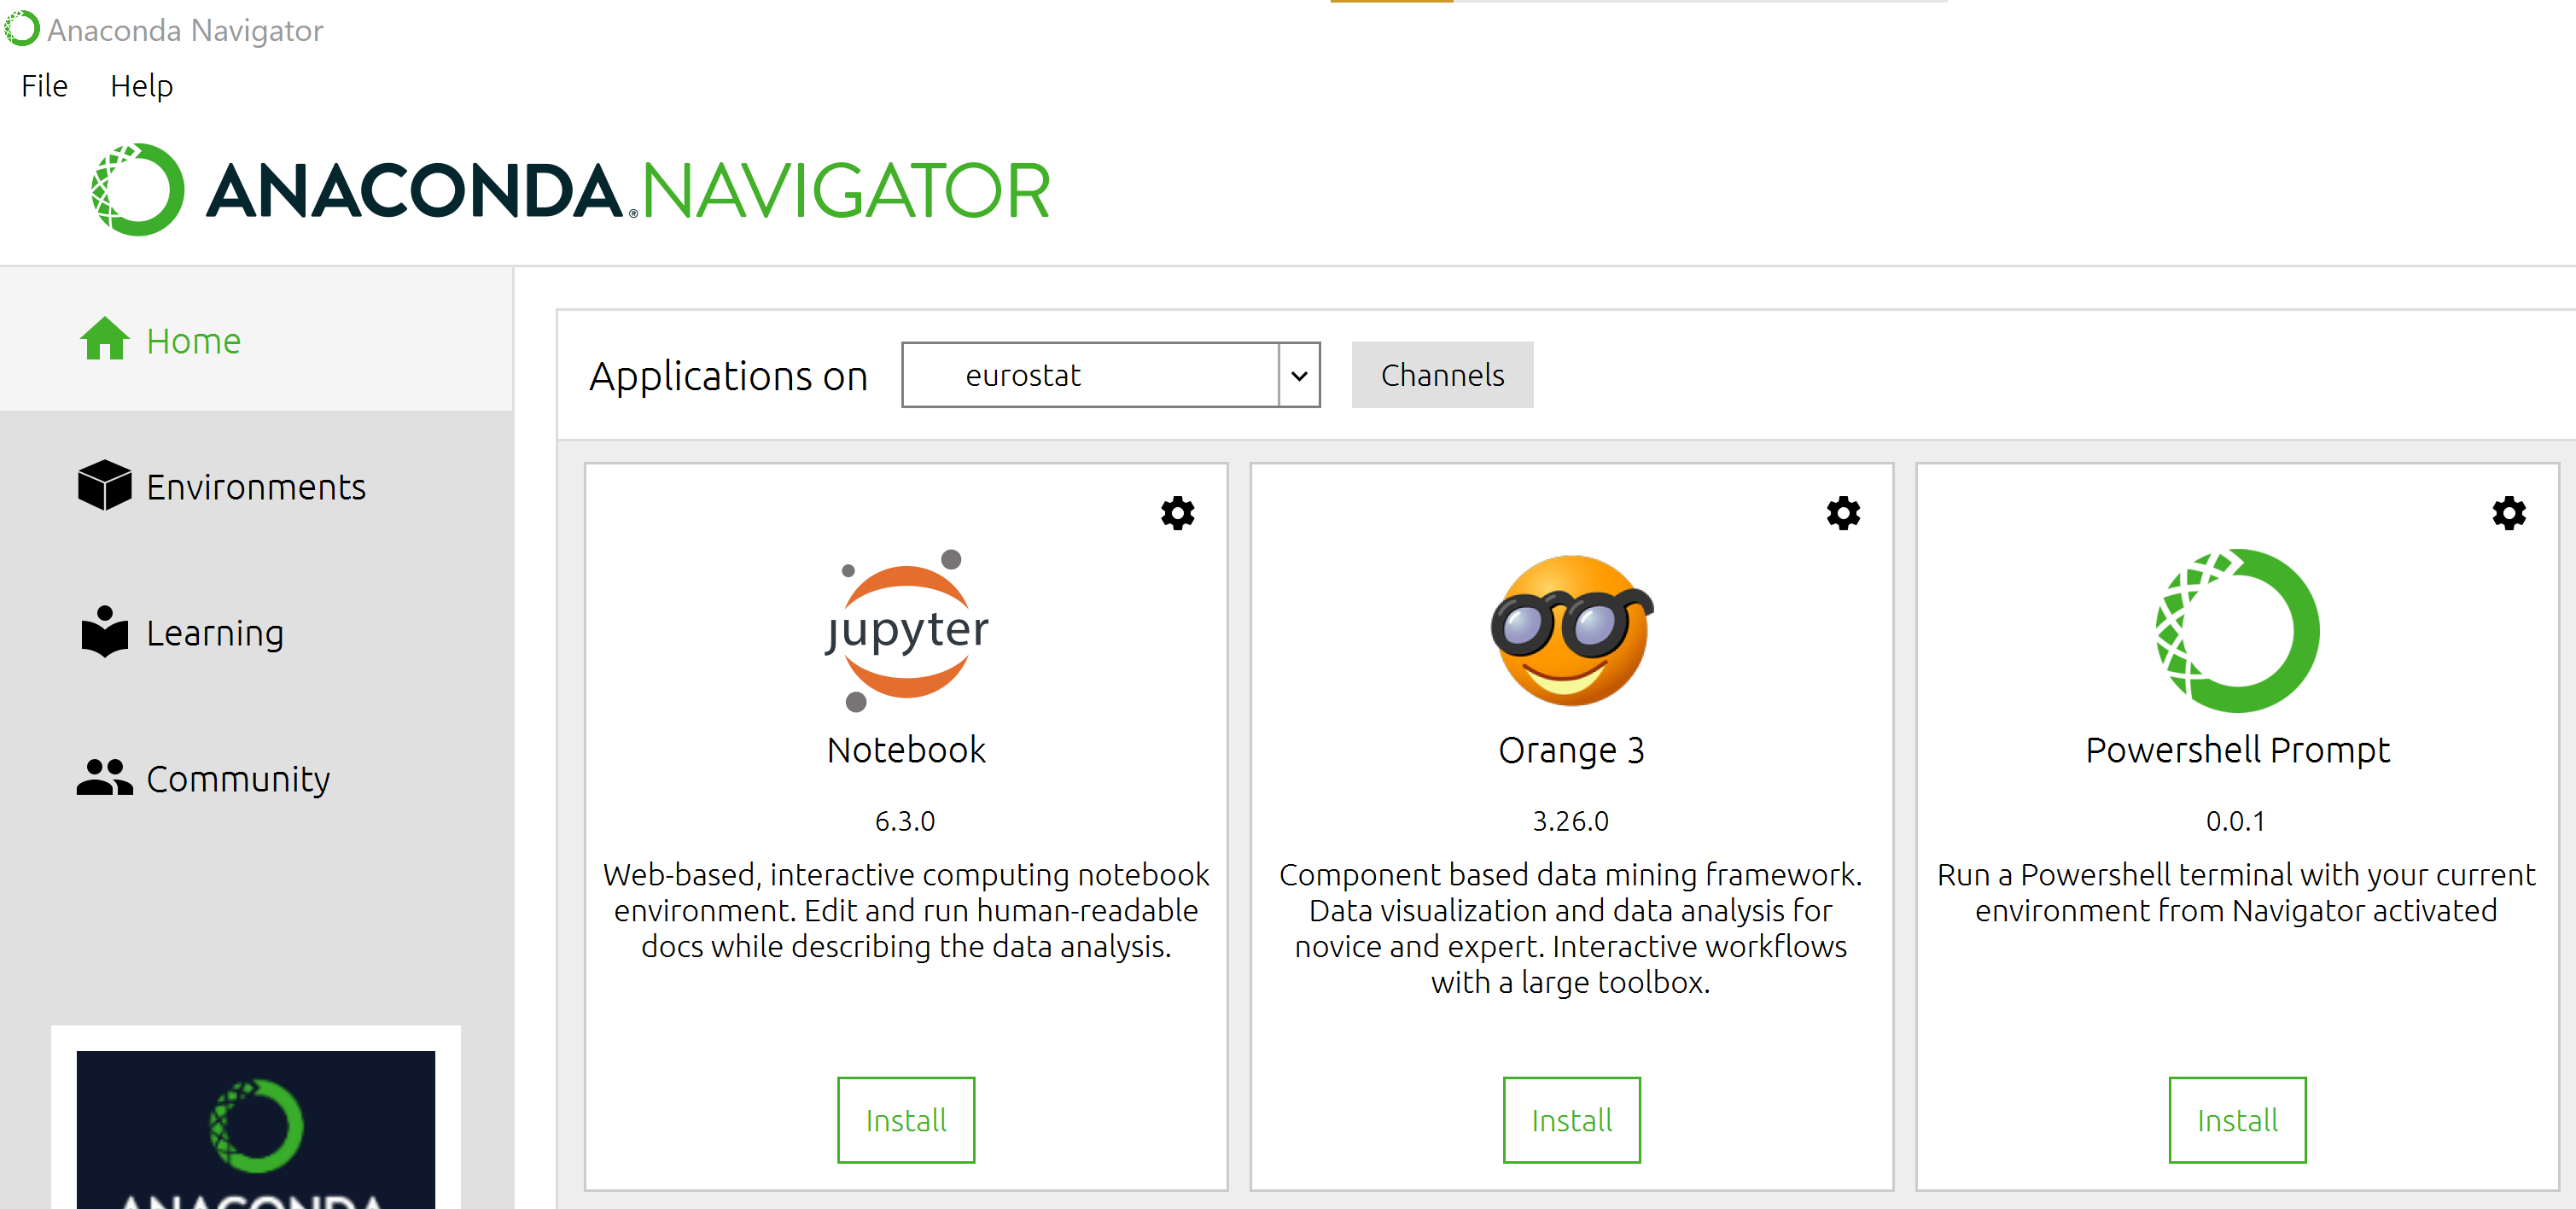

In [39]:
#@title Install Jupyter
base64_data = "iVBORw0KGgoAAAANSUhEUgAAC8oAAAWICAYAAADX7NwsAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAALEoAACxKAXd6dE0AAP+lSURBVHhe7N0HXNT1H8fxD8OBG9xbxJEjt5VWWiquNHO1LLOl7bRs/ivb0912VFqOXLk1EStzlKi4R8pwb8A9EPjf98cX4eQOfgcH3B2vp4/78/180R939/vdAf/e38/XK8lCAAAAAAAAAAAATNowvr4eAY6r1C1UjwAAAPKfihUr6hEAAACAnOatPwIAAAAAAAAAAAAAAAAAAAAA4BEIygMAAAAAAAAAAAAAAAAAAAAAPIpXkoUeAwAAAAAAAAAAAAAAAAAAAADg9ugoDwAAAAAAAAAAAAAAAAAAAADwKATlAQAAAAAAAAAAAAAAAAAAAAAehaA8AAAAAAAAAAAAAAAAAAAAAMCjEJQHAAAAAAAAAAAAAAAAAAAAAHgUgvIAAAAAAAAAAAAAAAAAAAAAAI9CUB4AAAAAAAAAAAAAAAAAAAAA4FEIygMAAAAAAAAAAAAAAAAAAAAAPApBeQAAAAAAAAAAAAAAAAAAAACAR/FKstDjHHHXwuZyOeGSrlL1DuovTzd8TVcAAAAAAAAAAAAAAAAAAAAAADiH04Lyn258XV5v9qkx7rP0dpnV+W9jrMyNmipfbflIV+lVLRYoP7ZfqCsAAAAAAAAAAAAAAAAAAAAAALIu20H5+36/U05dOi6BJerI+Dt/M+Y6zGtgfJx/1zop4lvUGB8+f0D6L+9sjDOyvMd2PQIAAAAAAAAAAAAAAAAAAAAAwHHe+mOWfLvtMyMkr6SE5DvNb2R8VO5edJMsjJ5hjCsVrSof3fKtMc6ICtm/tHqArgAAAAAAAAAAAAAAAAAAAAAAcEy2O8pfL6WbvFLEt5jMv+tfY7zlZJjDAXi6ywMAAAAAAAAAAAAAAAAAAAAAHJWljvIqDK86x8+NmqpnUqlw+/ON3jLGKSH56DN7stQlPm3oHgAAAAAAAAAAAAAAAAAAAAAAM7LUUf76AHtmnd+zG3inszwAAAAAAAAAAAAAAAAAAAAAwCzTQXkVdl/SPVwKeBe0G5RPmTcTbF99JFSGrXtBV5kjLA8AAAAAAAAAAAAAAAAAAAAAMMNbf8xQ5wWNjY8X4s8ZH9PqEfiA8XH6nokyu/PfpgPtt1Zsb/zdkB7b9EzGstuVHgAAAAAAAAAAAAAAAAAAAACQP2TaUX7jibXy6ponxNfbV+Z0WSNFfIvqzzjX11s/kd8if9GVbc3KtpLPW0/QFZAVsRI+a6aExahxgLTs20ea+hufQK6LlajQUAmJiJGAoJbSvn1T4VQAAAAAAAAAAAAAAAAAAADAGTINyuemExePyQPL2unKNrMd602LDZdZM8PEyE0TnM4HXDMoHxU6TkIidGERFDxQ2gfqwqyoUBmXcpCgYBno8AFyWdr7a5GlxwwAAAAAAAAAAAAAAAAAAADY4K0/ZujYhcMy6M9e0mFeA6N+YFl7Yzxz709G7Sxl/crL9E4rdGVbyn1wltjoCB2SV2IkIjpWj4G8ExESKlF6DAAAAAAAAAAAAAAAAAAAAMAxGQblVShd3fqFBEvE6d16VuS+2o9LOb+K0rfWAD3jPGUKl5feQf11ldOiZGNya/FrYsI2ElCGC4iQkFAPvxIDm0lwUIAxDAhqKc3oJg8AAAAAAAAAAAAAAAAAAAAnyTAoX7Kgvx5ZuyfwQZnacbmunO/phq/pkW1PrOihR9kUFSkRehgQkBzYVQHlSJLycAURIeLZWXl/CWzfRwYOHCh92je1VO4pNipcwkNnyThPX9gAAAAAAAAAAAAAAAAAAADgRuwG5a8mxsvsLqt0lSo+8Yoe5azlPbbrUXrRZ/fqUfZERV6LyUtQ8yDL/yaLICmPPGO5FnWXdSViQ7jE6jFcUGy4hIaESViE9c4UAAAAAAAAAAAAAAAAAAAAyFt2g/KdFzQxPnp5pf6VOqUaSAHvgrpyd1GSmpMPkhqBNeRaPjki0vJZIG8ENGsvLVOuxZgwCQ0nKg8AAAAAAAAAAAAAAAAAAAA4wmZQ/rttnxsf4y7HSMjdW42x6vD+TdsZMvW/cUadG96/+Ss9Sm/CjlF6lDWx4RskJScf1Lyp+Fv+1EhNyssGwsnIM/7StH3LazscxISFCpcjAAAAAAAAAAAAAAAAAAAAYJ7NoPysiEnGxz5Lbzc+qpC80mFeA7mzcldjnBtaV7hTj9KbvmeCHmVFrERHxOhxkNQMTB751whKDSdHRFv+FpBH/JtK8yA9lhgJCw3negQAAAAAAAAAAAAAAAAAAABM8kqy0ONrVCBeebvlSGlbqZMxTplLCc3nlpSva0uW70tsuMyaGSZGVD4oWAa210l5iZXwWTMlzPhEgLTs20ea+hufsC/tsQJaSt8+qju9ZTo2SjaGbpCImJRAvuXTAUES1LyZNA3M7KDJYqPCJToyQiJiYyTNYa4dp4blOOaOpMRajhctGzdESKzlYGnuleV4/uaOFxsrUdEbZUNErOX+pLlDaY6R6WPLwedLUc+Zeoxpj2M5kAQFNZdmTQMtX8uxc+zcc2BfVOg4CTG2OEh7n6IkdFxI6s4HwQPl2qVqS1SojEs+yHXXtW1ZeWyx4bNkZvKTZzl9faVPpi8QC7v3K+3jC5Lgge0l43vsIuc37ePJUCZf3xmvJ6vHm+Y5tLyeQkMtz23KYS2vtYGW1xoAAAAAAAAAAAAAAAAAAEB+YbOjvDKj059GSP7R0G5GndsB+ZwUGx1xLSgelNJO3uAvNYKu9ZSXiOis9fCOCp0lM2eqkGra8KvliDEREhYyU8aFRkmGR44KlVnjxsnMkDAJi7AO8Copx5k5y1yX8VjjeJa/bzmeuk/X3atrx9sYpafSiTUe07iZMyUkzPLcXX+H0hxj3KxQCXfwacv286WoYPCs5Ofs+uNYDiQRYSGW5ytUoszeNyefg6wJlPbB19rKS0SI5f7rcbZk47FZ7boQttHE/YmV8A0pofIAadkssyi8HWbPr57KVJ6e35x9PRmPzXg96RoAAAAAAAAAAAAAAAAAACAfshmU/7nD7xJQuKx0XtBYDpyLutbV/eu2vxof3VusRF9LkAaJVU7ewioIHBHtcEg2LnyWhBjHD5Cgli0lODhYgltajplyUCUiREIzSL9GRaYG+Y3jBLWUluo4wZaP14L8FjFhMjM042iwEUIPSX88437p46W9a+mpgPJM/ZiSGd22W6p/rx5bS8vx0t6nCAmbOct0uNcZz5dxH68LBgcEBennLNjyGPU5tdy3kNCNaZ4L+5x5DrIlsL2kZuXV/c/+18rWY/OvIal/JUIiM7s7sdGp58Vy3dQw0YA+HWMXApPnd1YunN9SzYyve+1a1dOqa/u1eePW3MbjzdnXk/FcWb3eAQAAAAAAAAAAAAAAAAAA8iefdy30+JriBUsYIfmriVf1jMjk3d/IS03e01XuUV/Xnv43PKtHDohaIwu269RpUAvpUPO6JKtfYbkctUMOX7SMLx6WywHN5fq/YuXSUdmx47Cov67+fqTlHwYEBUu3vrdK/YoVxd/fX/wr1pT69S3H8Y6SHcaB1V+9LAHNa4qtQ8dFbZBIryBpeVsH6dbB8u9qVpSK6jj+lo8160vzgDjZEKkfQ2yceFvmKvoll2nFhs+SBdtSIrMBEhTcTfrq4xn3Sx+vvuV+BHhfFq/CNS1fR/91Q6yEz1ogqYcIkuBufeVWy9+vafmLyY+touV4lvtkmfNOed4sz8bhHXG2H5/Tny99H5P/mhFW7vtwN2leUz2W5PtY0TJOfoxHJTLisMSm/F3xk8oNbD93zjoHZhlfzzhc+vvkXzNA4jZEJi/aiI2UOHvXZFxU6n2ynKvmdi7c7D02Pyl8OfW8xHoF2P06Suyu1bJB/92AhrdKc6snKU6iUh6Xuj7tnd9FIRJh5vzGWc7v4Vw4v35+xtc1boVPp17PlRpIh2aBqZ+z3Ky/dA68nuSSHN2R8vcCxOvyNjlsudvJr6kOclvz5saxAi7HGccGAAAAAAAAAAAAAAAAAADIL2x2lL9w9ZxVSN6TqE7SKYKubydv8Jemza+18JaITFtmXyegpbRvH2gj0Go5ctP20tJMN24VBu7TXpoG2gkgW3UZj5GIaB3oTSs2XELDUkPyLfv2kfb2jme5t4GW+9b0+qcjaqNcO4QESbDlPtk9hHre+vS1enwbzLTBzu7zlfY+Gs9bU5vHSn6MfdI8b5lwxjlwmkBplvpESMSGcB0uz6JsPjb/ps0tV4MWESn2XyHWuzc0b2r34rHPkfPb3sXPb46/niIkwvL2FtCyr/Sxek2pa7+pHgMAAAAAAAAAAAAAAAAAAOQPNoPyRXyLyfIe23WVTNULo2foyl1FSWpOPkhs5uSVwJomg8DXC5CW7e0FeRV/qRGUGniOjbMdfFWhVvvHSBZYM+NEcGx0hKTmi9uL4xnlWAnfkGZRQXB7sfd0pfKXpu1bWp6FZDER0ZkEurP7fF13H5ubeN6apd6/jDjjHDiT1aKBmDAJNbMIwY7sP7ZASf10Bgs+YqMlNSdf08T1cz1POr+58XqyCGgp7bOyIAEAAAAAAAAAAAAAAAAAAMDD2AzKd5jXQDafDDPC8fX8G0u7KncZ86M3vyerjiw3xnnNy/LHYVGRkpqTzyi4azIIfL2AIKmRSUbVv1TqX4iJidOj7El/HCd08pY4y3H1MKClNDObcvavIdey7TERkmEj7mw/X1m4j2nvnxM561zad11oOixUspGVd4itx5Y2RG5v14W0izVs796QGU86v7nwerIws5gAAAAAAAAAAAAAAAAAAAAgP7AZlO9crae8vHqAdF/UUr5sM1XebP65dJzfyPjcu+teND7mhm2nNupReg/f8IwemReV2k4+0+CuVRB4Q3jmnZxzTKzERkVJVFS4hIeGSuisWTJr1jgZF5L6WNJJ28k7IEBK6aFDYuNSH7N/KQfCt/6Smm2PkRzNj2f5PjoqC+cgJ/g3lfapbeUlLNQZ12UWH1umuy6kWazhSDA8LU86v7nyegqQgCy92AEAAAAAAAAAAAAAAAAAADyPzaD80KYfGh8vXr0gsyMmS1JSoiy7e4txy02DVz2sR+n1r+tgUD42XDakyb1GhIyTceMyuKUNyZro5OxcsRIVHiqzjPsyU2aGhEhISJiERURIRExMamdqM7IaMI6zfB09DHAwfVsqIAdaetuSjfuYOSeeAyfyb9o8NaAeEyYbze52YMUZjy1Qml0L7dvYdSHNYo2AoBq5fg1mLpfPb668ntKG6gEAAAAAAAAAAAAAAAAAAPI3m0H5tHoH9Zfg+TdKh3kNZPPJMFneY7v+jHuJjY64FlR1XIxE5FZSPjZKQsfNlJAw6/sbEBBguQVJUFBLaRkcLMHXQspwOpc+B4HSPjjNbgchoTa6uWfAiY/Nv0aQXIvKX5eUj9oYpo8fIEE1XCy9zWsMAAAAAAAAAAAAAAAAAADA49kNyhctUFxu8L9RV8leWfO4EZjPDRl9nTqlHL0PsRKd0t7aIiBIhWHN3FKDsjER0Zaj5LRYCQ8NkZRe9gFBLSW470AZOHCg9OnTx3JrL+3bN5WmgYESmIuto2Ni4vTInLhr7bgDxOmNwO1w9D7a55rnwEpge0nNykdISKjZqLyTH5t/Dbn2EomITBPYj5LIlC8S1FyaOuFp8qTz6w6vJwAAAAAAAAAAAAAAAAAAAHdnNyg/r+s/8lWb6fL62if1jLWcDMzPi5qmR7Z903aGHpkUGy3XcvIBLaV9exWGNXNrLtfyyDERkuNN5aM2SljK/QwKlj7tm0pgVrK6/qXk2j+zCjA7oFTAtW7hEhvnwCKBWIm79pf9JUez5Fm6j3FyLXdsi7POQQ4LbB+cem1GbJBwMw/e6Y/NX2qkJuXlWlP5qMhrQfSgmoF6lAWedH7d4fUEAAAAAAAAAAAAAAAAAADgQewG5VOsP75Gj9J78e9+euQ8lxMuyZdbPtRVel6WP46K2hgmKdnYgKAaqSHyTAVKs5Yp8dYYCduYpci5abGpiVgJyKR1dNq/m14py7/Xw7QBZkek7RYeEyamH7rVooQAyz3JQWkXBJhdyJAmxG2L885BTguU9tfayluuzdBwiU0bxrYhJx6bf42ga18zQl9oUSnt5ANaSrNs5OQ96vy6w+sJAAAAAAAAAAAAAAAAAADAg2QalH//5q/E19tXV9a2x2ySJ//oqavsUyH5uxY215VtIT226ZFZUZKS2xUJkKAajrVkThsEznJ3dqeLko3X2mLb4i9Nm1/rNy4RIaFZuN9pu4VbjrEh3EQX7FgJD01dlBDUvKkDixKyIlBqprb8N7GQwXL/NmQUo3ZEZucgFwQ2k9R1HGESutFZ98eBx+bfVK5dasbrI/X15tiiFFvc7Pxm2CneHV5PAAAAAAAAAAAAAAAAAAAAniPToHz4iX9kTpfVsrzH9ms3JWU8/s7fjDq7lu7/LdOQ/M3l2+qRA9J2mA4IEgdz8iopn9oJOqvd2U3yL5V652LCNkqUrSRtbJSEzgrJsGu2IW2I2vK3Q2aF2j6eIVaiwkMl/LrH5t+0vVUQe2ZmxwidKdeyxdntJm5SYLOWaRYyhMis0CjbAWTL8xY+K839s8Op5yDH+UvT9qmPPyYi4lqo2pacemyB19LsltdHeMrrzfFFKba4/Pm16nofI3F6aIs7vJ4AAAAAAAAAAAAAAAAAAAA8hc+7Fnps003lb5cuC5rK5N3fXLv1v+FZeXBZB/nr8O8ydc84+Wbrp8b8A3WeFB8vH/0vzeswr4GsObpCV/ZN6rBYj8yL2rhcInUYNaDhrdK8ol9yYZqfFL4cJTsOXzSqWK8AaV4zTQD40lHZseOwGJ/1qywN6le0/IsMxEXJhmt3KMj6WP5eErchUgeBYyVyR5RExV0WP69LEhcXLRs3rpblq7ZL7MUAadmykhw+bOc4Bj+pWD/A8uUsx1N37qI63gbZEBUncZdPi9elNMdcvkEiLcfyC2ou1ofRx0i5T/oYUZZjHLnsZTmG5Vhpj6Hvjro/wX1aS0VdWnHm86X4VZSK3qnn52JspOzYEGW5X5fF67rnTf2VgJbB0vBSpDFWj69yg/pidUk49RyYFxeV8vzZuE8Zue7xX2Pr/uTUY0tz3NiUfxN0m3Srn9nzESdR1+5PgAQ1r5m+Y7obnN/TUTv017McL8py3y77Ga+N6I0b5ah/zTRfPwdeT3JJju5I+fp2nkMAAAAAAAAAAAAAAAAAAIB8KNOO8kpKF/m0jl88IjtiNsmR8wf1jBiB+uTQ+x96xj7179TfVTczbN2HzEVJ5LW20FnvcO1fIyhNV+sNEp4SYHW6QGnfN00HbYmRmIgwCQkJsdzCJCJCtZe2PI7gPtK0VPLfyJjleH36SsvUlviWQ0ZIRNj1x8yI5RgDrY8RYxxD/fv0xwgICpa+fdpb/lXu8W/aR/qmts+3iLHcp/SPMaBlX+mT6RPn7HOQ86w6lWcopx5boFxrKq8F1XTeFeDa59e6q7/qKp/y2giLsPVG4fqvJwAAAAAAAAAAAAAAAAAAAE9gKiivTO6wVI8y986/z10Lwdu7Pby8k/7bmctaSF4kNnyDpObkgySLOXmVlJfUXGuMRETnWFJepYKlz8C+Emz5ggFps8FiqVVotm8fae9QalYFefvIwL7BRjjX+piWo1omglqq4w7M4LjJx+hr5xhqIqhlSwm2HKOP5SB50dFahamvPUY9l0w9b/q+NTV5z5x+DnKa5fw0vy6pbk8OPbbAZmnD50HixJy8waXPrzqe5b4FXffCCAjwF9tZe9d/PQEAAAAAAAAAAAAAAAAAALg7ryQLPc7UvrMR8viKu43gugq754ashuQB5EdREjouRC+QCZLggXRjBwAAAAAAAAAAAAAAAAAAyI9Md5RXqhcPkqXdN+kq5xGSB+CQ2Di5tt9DQICdju4AAAAAAAAAAAAAAAAAAADwdA4F5RVf7wLGx6cbvmZ8zAlNy95CSB6Aw2KjIyRGjwOCaoi/HgMAAAAAAAAAAAAAAAAAACB/8Uqy0OMsuWfxLXIu/qyuso+APIAsiQ2XWTPDdFA+QFr27SNNScoDAAAAAAAAAAAAAAAAAADkS9kOyqcYsqq/bD21QVeOqVa8pvzQboGuAECLDZfQ0Bip2b6ZBPrbT73HRoVKaEhqN3kJCpaB7QN1AQAAAAAAAAAAAAAAAAAAgPzGaUH5tKb89538uPNLXdnWJ+gRearhq7oCABususSLBAQEib9/gNSsWUri4iIlJiZWYiNiUgPySkBL6dunqdBMHgAAAAAAAAAAAAAAAAAAIP/KkaA8ADjFdUH5zAQEBUv79oGE5AEAAAAAAAAAAAAAAAAAAPI5gvIAXFysxEZFy8bICImNjZEY6/bxEhDgL/5BNaVZUwLyAAAAAAAAAAAAAAAAAAAASEZQHgAAAAAAAAAAAAAAAAAAAADgUbz1RwAAAAAAAAAAAAAAAAAAAAAAPAJBeQAAAAAAAAAAAAAAAAAAAACARyEoDwAAAAAAAAAAAAAAAAAAAADwKATlAQAAAAAAAAAAAAAAAAAAAAAehaA8AAAAAAAAAAAAAAAAAAAAAMCjEJQHAAAAAAAAAAAAAAAAAAAAAHgUgvIAAAAAAAAAAAAAAAAAAAAAAI9CUB4AAAAAAAAAAAAAAAAAAAAA4FEIygMAAAAAAAAAAAAAAAAAAAAAPApBeQAAAAAAAAAAAAAAAAAAAACARyEoDwAAAAAAAAAAAAAAAAAAAADwKATlAQAAAAAAAAAAAAAAAAAAAAAehaA8AAAAAAAAAAAAAAAAAAAAAMCjEJQHAAAAAAAAAAAAAAAAAAAAAHgUgvIAAAAAAAAAAAAAAAAAAAAAAI9CUB4AAAAAAAAAAAAAAAAAAAAA4FEIygMAAAAAAAAAAAAAAAAAAAAAPApBeQAAAAAAAAAAAAAAAAAAAACARyEoDwAAAAAAAAAAAAAAAAAAAADwKATlAQAAAAAAAAAAAAAAAAAAAAAehaA8AAAAAAAAAAAAAAAAAAAAAMCjEJQHAAAAAAAAAAAAAAAAAAAAAHgUgvIAAAAAAAAAAAAAAAAAAAAAAI9CUB4AAAAAAAAAAAAAAAAAAAAA4FEIygMAAAAAAAAAAAAAAAAAAAAAPApBeQAAAAAAAAAAAAAAAAAAAACARyEoDwAAAAAAAAAAAAAAAAAAAADwKATlAQAAAAAAAAAAAAAAAAAAAAAexXOD8ntHS2svL/Hyai2j9+o5eB7OMwAAAAAAAAAAAAAAAAAAAIDr0FEeAAAAAAAAAAAAAAAAAAAAAOBR3DYov2SQ6iJuuQ1aomcAAAAAAAAAAAAAAAAAAAAAAMjtoPySQcnhdodvg8QqDr93tHwwTo/HfSCj9+oxsmmvjG6tn/MsLUDI7r8HAAAAAAAAAAAAAAAAAAAAgOxz247yAAAAAAAAAAAAAAAAAAAAAADYkkdB+VYyak+SJCWZvX0vXfS/NNQaLG8P1OOBb8vgWnoMAAAAAAAAAAAAAAAAAAAAAMj33LajfJfvdYj+e6sIPQAAAAAAAAAAAAAAAAAAAAAgn3PboDwAAAAAAAAAAAAAAAAAAAAAALYQlAcAAAAAAAAAAAAAAAAAAAAAeBS3DcovGeQlXl6W26AlesYZ9sro1vq4VrdB4syvAmvXzqXVrbWM3qv/grPsHS2t032dtDfOMwAAAAAAAAAAAAAAAAAAAOAJ6CivJYe1a8uQtXrCyjjpqoLUTg3lY+/o1kZAves4PWFlrQypbXnOW4+W7Ofll8ggdf5qD7EcNSP6PBOYBwAAAAAAAAAAAAAAAAAAANwaQXndRf5aWHvgYklKSrK6LR6oPzeuK2F5J1ELE2qnrEpoNUr2XPec7xnVKvlza4dIbaeE5ZMNXGz9ddLern1NHZjnVAMAAAAAAAAAAAAAAAAAAADuKd8H5feO7n+ti7wRov6+S3KRRpfv04Sox3UlQJ1dSwZdW5jQatQeSVozWGoll9fUGrxGklJWKKwdIv1HOysqb5/xNZP2SOqpbi258GUBAAAAAAAAAAAAAAAAAAAAOFn+DsrvHS39dUpeBbZtZOSvqTV4cmqA+gPndTjPf5bIoJSU/MDFsmbw9RH5NLp8f62b/9ohX1j+ZW6oJYPXLJbkL7tWhnzBqggAAAAAAAAAAAAAAAAAAADA3eRRUH6tDKntJV5eJm452L5978IZlnti0WqUTM4osG2oJYPfTkltz5CFnp6UH9fV9vnI8Fb7Wnd+u5bMleSY/EBZnNHKBK3LK6MkeX3COJmba5n1LvJ9SkJ/3Ad0lQcAAAAAAAAAAAAAAAAAAADcTD7uKL9XFs7Q3eTv7SaZxeQNtevp0PZa2bnHGMBBS+amdJO/RzKPyVvUqis36uHW3bmYWO9yz7Wu8jM8flUEAAAAAAAAAAAAAAAAAAAA4FnyKCjfSkbtSZKkJBM3E13Hs2aP7NTdz2+sayomn3eh7bwwcLHt85HhbY+MSl5JYMde2b01edSqXu3kQaZqSz19zLW5ujohr74uAAAAAAAAAAAAAAAAAAAAgOzKvx3l9+4WndmWcV29xMvLzK2r6H7oyJLUxQlrh9S28fzautWWIfrf5K5aUjd1VYTQUx4AAAAAAAAAAAAAAAAAAABwH/k3KA8AAAAAAAAAAAAAAAAAAAAA8EgE5S0GLk6SpCTHbmsG19L/GlnRatQem89rhrfvu+h/DQAAAAAAAAAAAAAAAAAAAAD25d+gfK26cqMeIrfUlnqt9NCd3FhXWBYBAAAAAAAAAAAAAAAAAAAAuI983FE+NbQ9bu6S5AFyWC2pq1cnrJ2xUPYmD13UEpk7LnnUql7t5AEAAAAAAAAAAAAAAAAAAAAAt5CPg/KpoW0ZN1eIyueO2imrE9bOkIWunJRfMleSc/Kt5N5u9JMHAAAAAAAAAAAAAAAAAAAA3Ek+DsqLdHlllCTHtsfJB6Ndu7+5p6g1+G0ZaIzWypAvXHV5wl4Z/UFKO/l7hZw8AAAAAAAAAAAAAAAAAAAA4F7yQVB+rezco4fXqzVY3k5ObcvaIbVlEG3lc0EXeWWU7io/rqu0dtoChQzOcxrj5mZ+kveO7i9D1iaPB749WMjJAwAAAAAAAAAAAAAAAAAAAO7Fc4PytbrJvdfy2K3FXh67y/d7JDW37SVerUeLvej23tGtM/w8zKk1eI0sTrNAwctrkNiNry8ZlPHnTZ7na8Z1tRzPy05Af4kMsnyutk7Jtxq1R77vYgwBAAAAAAAAAAAAAAAAAAAAuBEP7ihfSwantIuXtTKktr0QvOXvrUm6FtyWtUOktpfl79q4GQHqtTvFRONyZKLL90myJ2WFgoyTrjaeb+PWdZzl81tlt90AvNnzbC05oH/d1/LqarknyQYuTpI1g+klDwAAAAAAAAAAAAAAAAAAALgjDw7KW3T5XpKSFktKjFpurCv2os8quJ2UlCYwb4PqMJ6U9L3QZNw5VGd59ZynBuZtGLjY8nfWSIaZdQfOswrAZ/Q1k89xEp3kAQAAAAAAAAAAAAAAAAAAADfmlaRSwYBHWyKDdLd4FZQnBA8AAAAAAAAAAAAAAAAAAAB4Ns/uKA8AAAAAAAAAAAAAAAAAAAAAyHcIygMAAAAAAAAAAAAAAAAAAAAAPApBeQAAAAAAAAAAAAAAAAAAAACARyEoDwAAAAAAAAAAAAAAAAAAAADwKATlAQAAAAAAAAAAAAAAAAAAAAAehaA8AAAAAAAAAAAAAAAAAAAAAMCjeCVZ6DEAAAAAAAAAAAAAAAAAAAAAAG6PjvIAAAAAAAAAAAAAAAAAAAAAAI9CUB4AAAAAAAAAAAAAAAAAAAAA4FEIygMAAAAAAAAAAAAAAAAAAAAAPApBeQAAAAAAAAAAAAAAAAAAAACARyEoDwAAAAAAAAAAAAAAAAAAAADwKATlAQAAAAAAAAAAAAAAAAAAAAAehaA8AAAAAAAAAAAAAAAAAAAAAMCjEJQHAAAAAAAAAAAAAAAAAAAAAHgUgvIAAAAAAAAAAAAAAAAAAAAAAI9CUB4AAAAAAAAAAAAAAAAAAAAA4FEIygMAAAAAAAAAAAAAAAAAAAAAPApBeQAAAAAAAAAAAAAAAAAAAACARyEoDwAAAAAAAAAAAAAAAAAAAADwKATlAQAAAAAAAAAAAAAAAAAAAAAehaA8AAAAAAAAAAAAAAAAAAAAAMCjEJQHAAAAAAAAAAAAAAAAAAAAAHgUgvIAAAAAAAAAAAAAAAAAAAAAAI9CUB4AAAAAAAAAAAAAAAAAAAAA4FEIygMAAAAAAAAAAAAAAAAAAAAAPApBeQAAAAAAAAAAAAAAAAAAAACARyEoDwAAAAAAAAAAAAAAAAAAAADwKATlAQAAAAAAAAAAAAAAAAAAAAAehaA8AAAAAAAAAAAAAAAAAAAAAMCjEJQHAAAAAAAAAAAAAAAAAAAAAHgUgvIAAAAAAAAAAAAAAAAAAAAAAI9CUB4AAAAAAAAAAAAAAAAAAAAA4FEIygMAAAAAAAAAAAAAAAAAAAAAPApBeQAAAAAAAAAAAAAAAAAAAACARyEoDwAAAAAAAAAAAAAAAAAAAADwKATlAQAAAAAAAAAAAAAAAAAAAAAehaA8AAAAAAAAAAAAAAAAAAAAAMCjEJQHAAAAAAAAAAAAAAAAAAAAAHgUgvIAAAAAAAAAAAAAAAAAAAAAAI9CUB4AAAAAAAAAAAAAAAAAAAAA4FEIygMAAAAAAAAAAAAAAAAAAAAAPApBeQAAAAAAAAAAAAAAAAAAAACARyEoDwAAAAAAAAAAAAAAAAAAAADwKATlAQAAAAAAAAAAAAAAAAAAAAAehaA8AAAAAAAAAAAAAAAAAAAAAMCjEJQHAAAAAAAAAAAAAAAAAAAAAHgUgvIAAAAAAAAAAAAAAAAAAAAAAI9CUB4AAAAAAAAAAAAAAAAAAAAA4FEIygMAAAAAAAAAAAAAAAAAAAAAPApBeQAAAAAAAAAAAAAAAAAAAACARyEoDwAAAAAAAAAAAAAAAAAAAADwKATlAQAAAAAAAAAAAAAAAAAAAAAexSvJQo+BXHEp4ZJcvHpeLqhbfPJHLy8v8fMtKkXS3Ar5FNL/AgAAAAAAAAAAAAAAAAAAAADMIyiPXJOQlCBfb/1CZkX8omcyVsC7gFQqWlWqFQuUasVrWG6Wj5ZxrZI3EKIHAAAAAAAAAAAAAAAAAAAAYBdBeeS6lYeXy6cb35Zz8Wf1jGNUgL5+QGNpVvYmaV72Zqnv31h8vX31ZwEAAAAAAAAAAAAAAAAAAADkdwTlkWWXEy5bbhelRMFSesa8oxcOybvrXpEdsVv0TNYV9vGTm8q3lo5V75ZWFdoYQXoAAAAAAAAAAAAAAAAAAAAA+RdBeTjs0PkDMjfqV1l1eIVMbDdTivgW1Z9JFnpwiaw7tlpebPxGus+ldTXxqoza/KEsiJ6lZ7KvRMGS0q5yZ+lU7W5pENBYzwIAAAAAAAAAAAAAAAAAAADITwjKw5TEpET559jf8lvkNCMEn2T582T9F+Xhuk/qv5EsPjFeHgrpJkcuHJJKRavI2y0+yzSw/vPu8TJhx1jjmM5Uu1Q96V93oLSp1EG8LH8AAAAAAAAAAAAAAAAAAAAA5A8E5ZEp1SF+/I4xcvj8QT2jOreXkhmdfk/XMX7G3sny1dbPdSXi7eUtD9cdKANueFp8vHz0bHohBxbKpxvfNoL2zlajeJAR6G9fpatxfwAAAAAAAAAAAAAAAAAAAAB4NoLysGtP3E4Zs+VT2XJqg55J9UT9F4xu7Wmdiz8r9y/rLGeunNYzqZqWaSnv3jRc/AuV1jPphZ8Mkzf/eV7Ox5/TM85VuWg1ee7GV+TWinfqGQAAAAAAAAAAAAAAAAAAAACeiKA80om7HGt0kF+0b44kJiXq2VQFvAvI7M4rpFQhfz2TTP2bn3eP11V6ZQqXk/dvHikNA5romfT2nN4lQ1cPlNjLMXrG+W6tcIe82PgNqVCksp4BAAAAAAAAAAAAAAAAAAAA4Em89UfAcPpKrIza/KH8eWiZzZC80rZyx3QhedUFfk7ENF3ZdvLScXnh7wEyJ3Kqnkmvdskb5Ms2k6WgTyE943yrj/4p/Zf3MEL98YnxehYAAAAAAAAAAAAAAAAAAACApyAoDyslC/rLezeNkEXd1si0jovlnRafSfcafaRimu7rPQPv16NUc6N+lfNXz+nKvquJV+W/uJ26Si/J8ufXPT/JlYTLeiZnXEq4ZHTAH/Tn/XLw3D49CwAAAAAAAAAAAAAAAAAAAMATeCVZ6DGQocPnD8r2mE0SXLWbnkkWn3hF+v7eUWIundQz9t1a4Q756Jax4u2Vfo2GCskPD39PFkTP0jO5o4hvUXm16XvSrkpnPQMAAAAAAAAAAAAAAAAAAADAnRGUR7apYPsX4e/qyr4bSzeVkbdOkEI+hfSMtbFbPpFZEVN0lft6BN4rLzR6XQp4F9QzAAAAAAAAAAAAAAAAAAAAANwRQfl8LjEp0WZ3d0dcuHpelu6fJ3Mip8n+s1F61lpgiVryVZvJUrxACT1jbeLOr2TSru90lXfq+d8on7f+RkoW9NczAAAAAAAAAAAAAAAAAAAAANwNQfl8btG+OTJu+xipVbKu1a168aAsBejXH18rsyOnytqjfxkhfCWgcBn5vu00KV+kolFf79e9k+TrrV/oKu9VLVZDRtw6TioUqaRnAAAAAAAAAAAAAAAAAAAAALgTgvL53My9P8uXWz/TVSrV+b1xmRbSrOzNlttNRkd4L8sfs45eOCRzI3+VkIOL5KObx8gN/g31Z6ypoP5nG9/RlesoU7icjLj1e8vjrq1nAAAAAAAAAAAAAAAAAAAAALgLgvL5yKWES1LYp7Cukk3e/b1M2PGlruxTXdanBC/UlXP8ceh3eS/slWud512NWizweetvpUFAYz0DAAAAAAAAAAAAAAAAAAAAwB1464/wcPvORsqEHWN1lepC/Hk9ylj9gBv1KFV84hVJsvzJir2nd8uH61932ZC8cjb+jLyy5imJOrNHzwAAAAAAAAAAAAAAAAAAAABwB3SUzwdOXTohT//VT24s3UzebvGpnk02avOH8lvkdF3Z99EtY+T2iu11lWx2xBTLv50m99R8QLpU7yFFfYvpz2Ru+cHFEnPppBT29ZPCPn6iLsPLCRflorpdvSDHLhyRg+f3y8Fz+4z7n5fK+pWTb9pMkfJFKuoZAAAAAAAAAAAAAAAAAAAAAK6MoLyHU6Hz5/5+RPbE7ZR2VTrLuy2H688k+3Tj27J432+6sk0F2RfctUoK+RTSM8lUt/V/j60yxn6+RaRj1W7Sq+aDEliiljHnLKqz+6aTYbLxxDrL7V+JOrNXfyb3VCseKN+0+VlKFCylZwAAAAAAAAAAAAAAAAAAAAC4Km/9ER4oISlB3ln3khGSV64mXjU+puXj5aNH9jUvd0u6kPylhEsSfjJMV8mB/HlRM+Tz8GGy/2yUnnWO4gVKGN3sX2z0hkxqP1emBi+SATc8LZWKVtF/I+epx/Ta2mclPvGKngEAAAAAAAAAAAAAAAAAAADgqgjKe7Dh4e9d6/iuqOD89Xy9ffXIvqZlWupRKtXZ/UrCZWOsjtGhSlf5/o5p8m3bKUb39ZxUpVh1eazeszK941IZfdtEaV72Fv2ZnLU9ZrN8vdW6Iz8AAAAAAAAAAAAAAAAAAAAA10NQ3kMt3T9fFu2bo6tkCTY6yvt6F9Aj+2wF5f85ulK8LH/aVeksv3RYKO+0/Fzq+d+oP5t7mpW9WUbdNsEI6N9c/jY9m3PmRE6Vvw6H6AoAAAAAAAAAAAAAAAAAAACAK/JKstBjeIiTl45L/+U95Fz8WT2TrEW5VjLy1vG6SvbtthEybc+PukqveIESsuCuVeLtZb2m4uMN/5OeNe/Pk3B8RlYf+UPGbPlEjl44rGecr2iBYvJDu9lSsUhlPZO/XImPl6MnToh/yZJSvGhRPZv3Dh09JlcTEqRwoYJSvkwZPYvsUudaqVC2rPHRU52Ki5MTp2Lk3IULcu78BVHfGov4+UnRIn4SYLnWK5YrK15eXvpvuzf12FIep7e3lxSzvI6LWh6rK4s9c0bOnD1njCuVLycFfDPfDQXIb6b89538FjlF4hPjjXpokw/k9krBxthVJVn+nLx4XBKSkhdzqkWYZf3KW37u9DFqV7Di4GL5bttnciXxsjQr20r+12K4+LjQ/fNEsZdPyeWES7oS8fPxk5KFAnTlOmIunZDtMZvkwLkoyy1ajlw4YPz+dfHqecvN8j3W8vtTYZ8iUtjXT0oV9JdKRatZblUlsERtaRDQTIoVKK6P5H7OWx7n2+uel4jTu4zfF19p+pE0trG42hkuXD0nZ66c1pVrKeJbVEoULKWrnHP0wiHZGbtZDp7bZ7lFW+qDlnNwzvLcWK61hAtSwLugcV/ULaBwGalaLFCqFK0hNUvWlTqlGrjce5ba6e7kxWPG94CcoL6XlLK8ZxTyKaxnAAAAAAAAAAAAAORnBOU90Gtrn5G1R1fqKpXqDD/mdutQ/Prja2V7zGYp7FNYCvn6JX+03FQgRdUq1BFYopb+2+7hUsIl+WnnNzJ970+SmJSoZ53rBv+G8k2bX8TXO3+FNY+dPCk397xPjhw/IX6FC8n88d9Km5ta6M/mjcTEROn0yBOyct16o/bx8ZZpY0ZIj+D2Ru0qLl+5YoT5M3rLLVSwoFSpWEFXeW/Qm8Pkp9m/GeOnHrxPxgz7nzF2d+o6/vOfMMs1Eybb/tsj/0VGS8zpjANY6txUr1xJ6tUKktbNmsitLZpLswb1jevNVSUkJMrG7TtkVdh62bE3Qv6LipY9UfuMx3r9dageR9mA0lInsIbUrVlDGtatI20tr231ePPaxBmz5fl3PzAej6Je2+o17mrP/cEjR43XuT1qoYV6fRcskPlOLmmpRQ3HT57K8L0jK9T9KFq0iLHgydMXHvxv+GjLa36dlCpZQsa886bUql5Nf8ZzHL94RB5c1kFXyQpbfpb7qs00qVGitp5xLVcTr8rLqwdYfg4N1zPJKhetLmNv/8UlgtEqhPrAsvZGKDjFOy1HSZtKHXXlHBGnd8v7YYPl1KXkxWkpbi7fRt5qMdzy/uFem4CpxQXfbPtELl29qGdECvgUlD5B/aVfnaf0jG0jNw2Txftm6SpV31oDZFCDV3SVN5Isv1dsObVB/j68TDae/Ef2n43Un3GcCvKqELM6x+0qd3XZ16k9P+wcI1P/G6crMcLYX7f91XhczhR6cKF8tvFNy+90CXrG9Txyw3PycN2ndeUc6v1xw4k1svpIqIRbrrUj5w/qzzhOhecblWkhLcvdLm0rdTIC5HlJLTB5buUDxvetnFbEt5iULlxWyhepJC3K3SqtKtxhfI8BAAAAAAAAAAAAkL8QlPcwS/fPM7q9p+VfqLQ0KdNC7qjcUe6s3EnPej61COCD9a9J7OUYPeNczzQcKvfXHqCr/EGFDYeP/0FXIs0bNpA1s6fpKm/sioiUxl3v0VUyFQCd+/1X0v7WVnomb6lgdus+DxpB2sz07txRpo4Zrqu8o57XJnf1vBbOVSHf9fNnScM67hXkSqEWd0ydv1CmzV8kW3f/p2ezp2yAv/TsFCz3desqt7VopmfzlgpqL/rjL5m+YLH8+c+/clp3Yc8qtTtD8G2t5MG7u8mdrW4Wb+/cD2vefm8/Wbd5q66SPdzzbhn/yQcu0+X/2Xfelwm/pg92Xi+oejVZ+esvUsbfXPfZzTt3Saf+Txgd9XNSqRLFpXaN6lK3ZqA0uqGutLmppTSuVzdPzrezha5eK10fG6QrMR5byM8TdeU5Np5YK6+ueUJXqVT36q/bzjA6PruaXbFb5bmV9+vK2uDGw6RbjXt1lXdmR0yWb7d9pqtk9QOayNjbp+jKOdTXUF/Llo9u+UZuLt9WV65PdYJXizZOX4nVM6lU1+sl3a0XRqSl/k3vJbfpypoKYC/qvkEKehfSM7nnxMVjMj9qmhHazqlwrwrK9wzsJ8HV7s6Tx+iISwkX5YHf28nZeOvvTSNvmySNSjt3Ae3gVQ/LtlMbdeWa1CLzRd026Cp71O4E8yzX2h+HlsjpHPgdVu3W0bLcbdKlei+5tUK7PFmE89OuL+WX3d/pKvepbvudqvWUe2o+aCwoAwAAAAAAAAAAAOD53D8BhWtOXDwuY7d8Kv6FAoxA/JDGb8nPHebLvK5/yXs3jchXIXmlRblW8kO72dKodHM941w/7vrGeM7zi7Pnz8v46TN0lWzDtu3yx9p/dZU3EhLT7xpwJT5e+j47WP4J36xn8lbomn9MheSV2UuXOb1zdFaMmjjJ6n6o8Yjx1jtSuIO14Zuk51PPS822wfLmF6OcFpJXTsTEyrhpM6R9vwFy0z33yq8Ll1zrep7bDhw+IoM/+ESq3XqnPPDCyzIvJDTbIXlFLfL4Ze4CI2gcdEdHeW/M13IqLk5/NndcvZq+i+zPv82Xlz/+XFd578dZc/QoYxH79suyv1fpKnNT5y/K8ZC8EnfmrIRt2Wac61c/HS639LpPKt/SVh4Z+rr8vnJVnl3XzjB8gvX7ltpJYv3WbbryfIfPH5CP17/ikt2YrybG61F6Kmyd1xIsz9mcyJ91lWpHzCbj5kw3+N+oR+nNshOgd1UqTG4rJK+0LHerHtl2JcH+rhxJlj8Jibl7HR+9cFBGbX5XHl7eUabtGZ+jHbCjz+wxvla/ZcEyY++PEp9o/7nIa7/vn5suJK/M2jtJj5wnIfGqHrmu+Azey8yKOvOffLh+qDwW2l3mRk7JkZC8or4X/HvsL3l33YvyxB/3yIqDi4z3utykdmXIS2oxwoQdI+XhkE4yN2qqS7/WAAAAAAAAAAAAADgHQXkPEnclRr5u87PM67rSCMb3rHm/VC9eU382f1JbrY+6bby0rRSsZ5zn4tUL8vU21wlq5rQfZsy2Gbz9fJxrduY9f/Gi9Bj4jGzZtVvP5B1bQd+M5HWX7KMnkruvX2/GoiWy//BhXbm2NRvDpcNDj8od9/eXxX/8JYk2FlQ4k+r83f/l16RZ9165unhEBeSf+t+7Ui/4Lvn2l2lG4DmnHD52XD7+5nupfUcnee2zEbkemL/e15OnGMF9V+BIkNyR94OrV/MuIBhz+rSxM8HdTz4jNdq0z5NFEtm1accuWbHmH12lGjnhJz3KH8KOr5Ifd36pK5i16nCIHLtg+3ueve7vWXV7xY5S1q+8rqyFn/hHIk7n/c8yZiQlJcqsCPth6b61HtUj16YWakzcMVoGhN4li6JnytVcDGvHXj4l47YPl8dWdJfVR0L1rOtQQevZds7x2qN/yKHz+3QFM85ciZORm4bJk3/0lD8PLTEWhOSWfWcj5OMNr8ozf/V1+uIfd6Bea19t+ch47tVzAQAAAAAAAAAAAMBzEZT3ILVL3iCBJWrpCikKeBc0Fg7cHXivnnGeFQeXysYTedtRPTfEX70qYyf9oitrKoS4cfsOXbkWFRpWnbD37tuvZ2DGl5OmGF35r3c1IUFGTnR+t1BnUl3en3zjbWn34AD5Oyz3O1buioiUzgOelAdfHJqjncDVa/Lz7ydIo649jG7mqs4tahHK6B8myY2d7paJM2bn6Q4IKriv7gty1vGTp4znus6dneWNL0Y6ZbeC3DBiwg96ZG1uyHKJOnBQV/mD6ob91+HfdYXMqLDqzAj7CypWHgmRoxcO6Sr7fL195Z7AfrpKz14w2dWEHV8t+89G6spa3VINpWHpZrpyXeuPr5HHV9xtvGZyMyB/vSPnD8qwdS/IZxvfNBbnuoo1R/8wdqqwRb1u5kSk34UhOwr4FNIj11XAu4Aemaeeq5AD843FGIv3zdKzeUMtxHnh735GYP/C1fN6Nv84eC5anlt5v6w6slzPAAAAAAAAAAAAAPA0BOXzEfUfvvddF17Zc3qXfLrxbRm27mV5dc3T8tzKR+SJP+6Vh0K6yR+HPCdQ5e3lLUObvGN02Xe2sVs+NcIOnkx1Ej945Kiu0hs+znYY0RWcOBVjBJczuv9Idfb8eRk/fYau0ps0+zc5GeuaXaUXrvhTGnfpIZPnzMvT8LYye+kyuaXnfRK+faeecZ6tu/+Tlj36ytsjx8qFi5f0bO5T3cWfefs9Y1FCXu40oLrb/zBzjq6Qk85duGB0Y7+x8902d51wJfsOHTZeh7aoHQBG/+jcjuDu4PONb0rUmf90hYxsPxUuu2K36io91Tn9t0jbCwizqmuNvlLYx09X1lYcWiQxl07oynVl1Gm/b60B4mX546oSkhLkx51j5fW1Tzq0CKKQT2FpUa613F/7CXmt2ccy5vZfZEK7eTK143L5JXiZfH/HbPn4lu9kYIOh0q7KXVK8QAn9L80JOTBPnvnrXpfZVWDm3ox35Fi6/zc5e+W0rrLv/lqP231duIr7aj2mR+ZcSrhoeT/+n3y28Q2jo7wj1PVWq2Q941q61/J1H633vDzd8DV5ov5L0q/OIOlW415pUuYmCShURv8L81Rg/+k/+7rNDhbOpBajvLvuRfl1j2vulAYAAAAAAAAAAAAge7yS8jpNiBxz7MIR2RoTLltPhcs2yy3izH9G1/nxd6aGYHfFbpeBf96nq1T96jwhgxoM1pXnSExKlPfCXnH6IoCPbxkrt1VspyvP07x7b9n23x5dpeft7S3bls6XoOrV9Ezu2b5nrzTr1ktX9tUJrCErpvwkZUsH6Jnco4Lbqsu5WZd3b9Gj3Ke6c6vgcUbefGaQDHvxWV3lPdVN/Y3PR8qXdnY9yEuFChaUUW+/IY/f21vPZI/q4P7Sh5/KpcuX9Yxr8C9RQiZ89qF0a3eHnnGeVr3uz3TXCvUe9PPIz6RPl056JncVqttIjzI3/pMPpH+vHrrK2MsffSZfTZ6iK9fTqc1t8sPnH0sZ/1J6xnUMsbxOvvl5qq7SK+JXWPb+uUxKl3K9+54VG0+slVfXPKEr+yoWrSLftJkhxQuW1DN5Z9upjTJ41cO6sqaCn72D+usq96lO3quPhOrKNj/fIjK94wopWqC4nsm+r7Z8JHOjbF+3/eo8ZYRiXZVahPHkHz11Za18kUoyucNS8fHy0TO2nbh4TB5YZv/n6QV3hRnPu7OdjT8j7617UTadXKdnMqaC23dU7iztq3aXhgFNjd2rzFJd6jefWierDi83OljHXj6lP5Mx9TWebviqdA+8P88WHOyM3SLPr3xAV/Y9Xn+wPFD7SV1lX3zilWx1Ol9+YIF8u+0zXVkLrtpDnmr4iq4cV9C7kEPXpNop4K1/n5F9ZyP0TObUbgy3VeogTcrcLHVKNcj0dZTi+MUjxjUddmyV8X52JdHcz47qWnupybvGc5MTXlo9QLacDNOVtbJ+5eX2ih11lXVqMcKpSyeM5yD6zB6HFrW/0fwzaV+lm64AAAAAAAAAAAAAeAKC8h5EhcC3xYTLH4eWyaojK4yg/PWK+BaVpd3/1ZXI+avnpMuCW3SVrHO1HvJm84905XniE+Nl6JpBEn7CXBjGjBv8G8q4O6bryrMs+3u1dH/iaV3Z98R9feTr99/RVe4xG5RXGte7QZZNniilSjgv1GaGuwTlVeC8bvsucujoMT1jW0DJkrL3r2VS1C/vO3yqDvh9nx0sf6xNfV9zRY/0vkfGvPM/8StcSM84JjExUYZ88Il8N/VXPeOa1AIKtZDCmcwE5ZUCvr4y+9uxRng7t+XXoLxSqXw5+WXUF3Jr86Z6Ju+p3Q5q3dEx0x0X3nnhGfnfs0/pyr2ZDcorqvu16nDtbTJsmVNcNSh/6Pw+GbD8LlPBykENXjE6pTvLofP7LV+7q82vXaJgKZnWMdToKO2Khoe/ZXQTt8Xs+cyLoLzq1P/a2oGmdltQz73qHK8ei/qdKrsSkxLk7yPL5aedX8qBc1F6NmPqa6vnMy98sP5l+evQUl3ZF1C4rEwNDhFf7wJ6Jm+pTukjNw3TlTXVgX1wY9ufc7ZIyzX2+ponJebyST1jnwrD32W5b3fXuE9qlKitZ7PufPxZ+ePQEpm+Z4LpHRMGNnjZ6FrvbBkF5ZuWvUW+aO3cru7q+V5zZIUsjJ4he09nvtOTum7VfbixdHM9AwAAAAAAAAAAAMDdeeuPcFMqHL/55HoZvflj6b20vTy38hGZHTHFZkheUd34VHe1FEV9i4l/odK6UuGpVvJas/d15ZkKeBeQd1sOl9KFy+qZ7NsVu03WH1+rK88yfPyPepSxn3+bL8dOZh78yEubd+6SewY+m2l4Mr/6deGSTEPySszp0zLx11m6yjsnTsVIx4cfd/mQvDJp9ly5/4WXdOWYK/Hx8tCQV10+JK+8N+ZrGfzBJ0awP7ephR73PT9EVq3fqGeQGw4fOy6d+j8u0xcs1jN577sp0029z3/7yzS5eMm1dmfIDeuPr5Efdo7RFa43O+JnUyF5ZU7kz5KQlKCr7KtctJq0qnCnrqyduRJndMZ2Raor+vKDC3VlrYjld40u1c0taMxtqtv0i6seMhWS71C1u/zUfrE8XPdpp4TkFbVYpW2lTjKh3Tx5pelHRuf9zMyLmipnr5zWVe5R4eqVh5fpKmNq8YEKZSPVztjNMmRVf1Mh+TaVOsoP7RfKC43eckpIXlE7X6hFAT9ajvtUw1eleIES+jP2jds+QibsGGX6/dBVBRQqYzz2b9vOkP+1+ELK+VXUn7HtamK8sauIes8FAAAAAAAAAAAA4BkIyru5uVHT5fm/B8icyKlWAfiM7D8XrUfJapWsa3xU/8FcdZI3u527O/MvFCDvtPhMvL2c9xKYvPt7PfIcqovzX/+a67x/+coVGfvTL7pyXWvDN0nf5wYb4WNYGzXxJz3K3OgfJxvB5LwSe+aMdHzkcVOdxl3FP5Zrz1FXExLkvudfktlLzYXTXIEKHz/11ru6yl0q9Nxz0HMSvj3zjqFwHvVeMOCVN2SM5X0hr6lrQF2DZpyIiZWff5unq/xl+p6J8idB1nRUMPJ3O13RbTlx8aisPPy7rpyjT61H9Ci9WRGTJCkp9xciZWZ+1DQjXGpLtxp9jbC8q1Fh89fXDpQj5w/qGdsCS9SRL9tMk9ebfSpl/crrWedSv3t1qnaP/NR+kTxa7wXxyuD3E7XAuZBv7u8q8FvkLw5de7MifnL7gLWz7D8bKW/+87TR1T0jDQKayNjbp8g7LUcZi2ZyQgHvgtIn6BGZHPy70S0+s67/qgP9zL3mfz9wZep1dWflrvLdHbOMzvUZUd8Lpvzneb/bAwAAAAAAAAAAAPkVQXk3165yF/H19tWVOfvPWm/tX8//RuPji43flDKFyxnj/KBp2ZvkoTpP6ir7Np1cL5Fn9ujKM4ww2U0+xbhpM+T02XO6cl3LV62R/i+/JgkJrhc2yyu/r1wl2/4zf/2qzvPT5i/SVe5SQdheg56XHXsi9IxzeHl5SdnSAVK7RnW5sW4dKV+mjHh7O+/b5GuDHH+/ee6dD2TxH3/pyn2oDvpvjcibjtVnzp2Tbo8Pkl0RkXoGuSEpKUle/XS4fD15ip7JG5PmzDUC8GapRT95sQOCK/gi/C2JOL1bV1AWRP8qlxMc23VGhUidGQi+sXRzqVOqga6sHTgXJWHHV+vKNajna77lebNFBcB71nxIV67jSuJleevfZ40Ac0ZalLtVxtz+s+V3pUZ6JmepEHO/OoNkxK0/SoCNna/U3OetJ0pB70J6Jneciz8ri/c5tpOQem/ZdNLcYltPdurScWNBRma7APSr85SMvu1nqR/QRM/kLLVAfmCDl41gfulMfv8ft324y+5mkRUlCpaST1uNk/ZVuukZ29TuDYfO79cVAAAAAAAAAAAAAHdGUN7NlSrkL7dWuFNX5uyK3aZHyeoHNJI2lTpIx6oZ/8diT/TIDYOc2rHv9/3z9cj9RR88JL8tC9GVOSqgOm6a7bCUq/nt9+Xy1FvDjHAnREZMcLxb5IgJP+bJ8/foq2/Imo3husoeFYh/98XnZO2c6XIq/B85uOZP2fb7Alk/f5bsX71Czm3bKPtWhcrCid/Js/37Sc1qVfW/dMzrTz8pLz0xQFfmfPLNOPlx1hxdZV+xIkWkVdMmMqB3T3l10BPywUsvyHuDn5eXn3hU7u/eVZo2qCcFfB1beJWRL8ZNNBbP5IWTsXHS5dGBsu/QYT3j+Xx9fOTTV18ydXvzmUHy+L29peudbaV5wwZSxM953Ylf/vhzmb5gsa5ylwq8O9rVPmLffpm/fIWu8hcVcB627gWjcy5E4hOvyLzIqboy77+47bL9lHO+Jylelj+9g/rrKj3VVd6VhB5cKKcvx+jKWtvKnaWsXwVduY5vt34m22MyPmddq/eRD2/+Jk+64Tcq3ULG3TFHmpdtrWeSQ/IqQF+1WKCeyT2L982Ui1cv6Mq8WXtd61rNbQlJCfJ+2Ety/OIRPZOeWhzxZvPP5dF6z2e4k0BOUYtyvmn7q9ygF87bM2LTOxJxepeu3J9axDO06QfGwiR7riZelR93jtUVAAAAAAAAAAAAAHdGUN4DdK/RR4/M2XpdMKRhQBMZ2mSYrvIXFU4Y0vh/usq+kAOLJDHJMzrTjvphUpY6rn85aYpcvnJFV65t8px5Rqgzv9uwbbv89a/jXT9Vx+6FK/7UVe5Q3arVIofsKOrnJ288M/BaIF6NmzWob8xfz8fHWyqULSvBt7WWkf97TXaGLJLwhb9Jvx7djc+ZMeTxAUYg3RF/h22QD776RldZV65MaSMQPW/c13L435Xy5/TJ8v3H7xkheRWWVwH+j18ZIpOGfyr/zPlVDq79S34a/on07NTBCNZn11DL62vLrrzpWH342HHpPOBJOXbypJ7xbD4+Psa1ZuY27MVn5ZsPhslv330pa2ZPkyP//m1cIwMfuFcqlc/ezjJq8cyTb7wtYVusF+Xlht+WLZfI/Qd0ZZ5a9OPJ6pZqqEfpHb1wUD5a/4oR6MzvQg8ukpjLtt8vbq3Y3ghV2uPs8HrbSp2kTOHyurK28cRaiTzzn67yluqkPzvC/uKUvrUcWyCWG/4+HGLsHJCRx+q9KEOavOvwrl3OVKpQgHzS6jt5quGrUqN4rTwLyauw8G+Rv+jKmlrUoTqSVy5aXc9Y+/fYX8YuCPnVpF1fZbggI6BQGRl52yRpV+UuPZM3VEf5Ebf+lGGHdbWQ6IP1L2dpwYSrUv8/wLstRxvd9e1ZfSTUox4zAAAAAAAAAAAAkF8RlHdT8YnxeiTSolwrqVCkkq4yd+BstJxJs/17iYIljc70+dVN5W+VNpXa6yp7Tl46LhtP/Ksr93UqLk4mz5mrK8eoUKoKoLsLFbx+f2z2A8nubGQWusmnUF3Dc0v49p3y+ucjdZU1D3S/ywjIqy7ytWvYDnZlpn7tIPnh849ky5L5RmDey8tLfya9Zx5+0Ojg7YiY06flkaGvZ2mhSorqlSsZ4fd9f4cagejObW+XQgUL6s/aV6pEceM5mj52pBGa/2joYClZPOvddNWimX6DX5HzFy/qmdylQtNdBgw0nlPYV7hQIeMa+fLdtyTiz2Xy4xcfG9dQVl2Jj7ec96ESd+asnskdI8ZnLfC+bvNWWbV+o648T+fqvaR7jft0ld6GE2tk4o7RusqfVOA7o7D7vbUek+CqPaS8nZ+3VZjy0Pn9uso+X+8Cck/NB3WV3pwMwum5acPxNbLvbISurDUu01Jql6yvK9cQc+mEjNj0tq5suyfwQXmwzkAjBJ7XvL18pE/QIzKh3bw8Cckrfx1eKicuHtOVtVsqtJX6AU2kV9DDeiY9V9sBIbdsObVepv03XlfplShYSsbcPkXq+TfSM3mrkE9heb35p3JXjb56Jr2D56Llm22f6sozlCwUIA/VfVpX6akFAuuO/60rAAAAAAAAAAAAAO6KoLwbUv/BduKOL3WlQhTe0qX6PbrKnAoDbY/ZrCsoj97wrB5l39L97hMSt+fbX6bJhYuXdOU41Y0+MdF9Out/9PV3Mvann3WVv0QdOCi/LQvRleP+3bTF6H6e01Ro/Km3hhkB3KxQXbJXTJ1kdEvPbsfsFLWqVzMC8/PHfyNlA9IvNnrivj5GF3pHvfHZSDl01HYoLTP+JUrI568Pla1L58v93buKt3fWv837FS4kQ598THaFLpEXH+0vBQsU0J9xzH9R0fLemK91lfu279krPZ58Rs5doCOoGeqaefDubsaCkhGW61ddU1mx79Bheebt93SV89SuGGp3jKwaOdGzu8o/e+Mb0iCgqa7Sm7H3B1lxcLGu8h8V+I4+s0dX1lSQtX5AY/Hx8pFeNW0HgtXP1r9FOPfniLuq9zXCq7YsP7jQbvf73DQrwv5Cuz5BrtdNftyOEXIu3v4CngYBTYwO7kimruuZezM/x52q3WO3K3fI/vly+nKMrvIH1YV/zOb3jefPFvVeMqzlaKlYtIqecQ1qccjzN74ljcq01DPpLdk3W3bEbNKVZ+gR+IDdHTyU1Ueyt5MVAAAAAAAAAAAAgLxHUN4NbT65QWZETLbqXHl3DRWmKaSrzO09vVuPoASVrCOtKrTRVfasPvqnJCa5T0j8ehcvXTaC8tkRsW+/zPk96+HrvPDqp8Plp9m/6Sr/GP3j5Gx1Lldyo6v8d1OmyaYdu3TlGNUB/u9ff5Fbm9sPiWZHx9tvlfXzZ8kdt9ykZ0Qeuqe7fPXe2xl2m7dFLTyYlMXdHBrdUFfC5s00Qu1musebFVCypBG+VwsNKpQtq2cdo3Zu2Paf7RBqblAdw3s//YLR4R7mqIURz/XvJ6tnTZW6NbPWyXj20mWy9K/c6cQ6PIvd5FMs/mOl7IqI1JXnUR3Kh900OsMwoOq0HXE6a++z7i7jMPAj17qLd6neS4r4FjXG11uyf46cjT+jq+wrXrCkdK7WU1fWribGy/yo7P2sll1qYcH642t0ZU11P7+lvHN+rnaWbac2yvIDC3SVXkChMvJOy1HGawXJNp8Ms/zOuFNX1oJK3iCNyrQwxoV9/OSuGvca4+tdSbwsC6Jn6Cp/mBs1xe5OC4pauKR2XHBFvt6+MszyOqhQxH6If+yWDy2/6yboyv2p13ybSh11ld6mE+v0CAAAAAAAAAAAAIC7IijvhtYeW2l0qvt220g9I1K6cFnpWfMBXdlXtEAxeaHRG9KvzuN6BikerjtQj7LnfPw5+S/OdqjEHaiQ7snYOF1l3fDxP+iRe0hKSpKn33rPCHbmF+o8T85iKDut31eukq27/9OV88WcPi3vjc1aR/LbWjQzAt5VKlbQMzlDBcgX/zBOvv3wXeM27uMPHA7JK4Pf/9i4Fh3VI7i9/Dl9slStVFHPOF/LRg1l7exp0rxhAz1j3tWEBOOx5aU//1knD7441LgvMC+oejX5e8YU6XBbaz3jmBct510twMpJahHGsr9X6ypr1Otu9A+TdeWZVBBYheXtBYEvJ1ySYetekDNXsv8zgDuJPPOfbDhhO/Bdzq+i3FYpWFciRXyLSZfqvXVlTT1/i6Jn6so5egU9fC2kf70FUb8aXzOvzI6030G/d1B/y/dA1/k1U3X2Vt3kM/J2y5GW36ecs+OMpzC7gES5p+aDRqd0W1RwXAXm84MLV8/Jz7u/1VV6d9XoK90D79eVaypZ0F8+vPkr8fMtomesqcUToQcX6coz3J7mff56sZdPGf/fCwAAAAAAAAAAAAD3RVDeDf17NLk768rDy2XLqY3GWHmozhN2u1yqIEOXavfI1ODF0ieon3i7UHjFVTQMaGJ0lneG8JPu2XkuMTFRxvzonKBg+PadErp6ra7cg3r8A4a+ke3ApbtQXdovXHROyC4nF0Z8PXmqnD57Tlfm3RBUU+ZP+Fb8S5TQMznLx8dbHuvby7ipsaOW/LlSNm7foSvzBj1wr/z65Ugp6uenZ3JOpfLlJHTKT0YXfUf9HbZBVq5br6u8sXDFn/LEa29laTFCflayeDGZP+4b6dbuDj1jXvTBQ/L91Om6yhkjJ9gPczpi6vyFcuzkSV15pnr+jWRw42G6Su/ohUPywfqXJcGDugVnZlYGYeCeNR9KF/5Vc/ZC4L9F/mJ0e3eWykWrS6sKtl93p6/ESujBhbrKXSo4aq87uwrZBle9W1euYevJ9bIjZpOu0mtbubPcWLq5rqDsPxsp/x77S1fWAgqXlTsrd9FVMrVbxR3XzaWIuxwjKzwsWG3P/Khf5Xz8WV1ZUwtvVDd5e4tfXEmNErXl8fpDdJXe9D0TLD9Lue8OatdTj9cetdAm9rJn/2wAAAAAAAAAAAAAeDrS0m7m2IUjsv9ctK5Evt76hfEfb5USBUvJvbX6G+O0ahQPkm/a/iJvNP9Q/AsF6FnY0slJwZ5wN92i/bdlyyVy/wFdZd8XbtZVXrkSHy/3PT9EVm8I1zOeSXV4/vaXabrKvpmLl8q+Q4d15Txnz5+XrydP0ZV5RfwKy7QxI3IlPO4sX4ybqEfmtWt9i4x6+80sda/PKr/ChWTK6C+kXq0gPWPeZ99P0KO8M23BInnxvY90BbPU4o8fv/hY6tYM1DPmjfphsly+ckVXznXwyFGZsWiJrrJH3cevJk/VlefqXK2n9Ai0vwtR+Il/ZMKO1F2LPNmpS8dlxSHbAV7VTbmrje7xFYpUltsrdtCVNXW8Pw8t1ZVz9A56RI/SmxUx6drvAblpQdR0iU+0/Zq+O/B+KeRTWFeuYeqe8XqUnlr08EjdZ3WFFLMj7S+cvSfwQZs7U6idBOyZtTdvrtXcpLrmz7a8Ju15tN4LUtC7kK5cX7fq9xqLdWzZdzZC1h77U1fur1iB4hm+b520vLcDAAAAAAAAAAAAcF8E5d3MjtgtepRsZ+xWCT2YGhC7r/YjUqJgSWOsusY/UPtRmdhupjQIaGzMpVh1ZIVcTsgfW+A7IrjqXU7ptr/51Aa37MbqrK68Kf5Y+69s2LZdV+5DdVm/Z+CzRld8TzVpzlw5GRunq+xLSEiUkROde/0ov/w2X2LPnNGVeV+++7bUr+14kDuvqNeJo4szalaragTWs9K9PrtKFCsmv333pZQuVUrPmLN81RrZvmevrvLO99NmyFsjxugKZqnzPuubMcZHRxw9cUImzZ6rK+ca89PPEn/1qq6yb9y0X+XchQu68lxPN3w9ww7aM/f+lC86QM+NnCpXE21fP12q9ZaiBYrrylpuhtcblWkhtUrW05U11fV7/fHc3QVHhYHnRdveJaKAd0HpEfigrlzD0QsHM3yOOlTpLtWK19QVlNOXYyRk/3xdWVNh4m417tWVtTqlGkij0i10ZS367F7ZcNy9dppy1OojocZuC7YElaxruda66co9+Hr7yhMZdJVfEPWrHrk/1eXf3s58yhX+fxMAAAAAAAAAAADArRGUdzMqGH+9cdvHXOvqWNS3mDxY53GpUqy6fNVmsjzd8GUjtJLi1KUT8r9/XpSfdn0nhXzcp6NdbilduKw0Kt1MV1l38eoFiTz9n67cw8p1YbJ+6zZdOU9WumS7gjPnzkn3J56S3ZFResZzqFD7mB/tdwrNqkmzf5MTMbG6co5f5i7QI/OCb2stD93TXVfu4effbAfS7FHh+BlfjZKAkskLo/JCYNUqMnnEp7oy75e5jj3WnKLem4a74a4Xea1OYA357PWhujLvh5mz9ch54s6clR9mOPe46pg/zpyjK8+lApDvtBwlZf3K65n0hoe/LXtPe+6CsUsJF2VhtO2gp+oy3rPmQ7pKr35AY6nn30hX1tRztuXkel1lnwpw9skomL/XfgfrnBB6YKERpLYluOrdUsrFdq9acXCxHqXn7eUjD9d9WldIoRZCqAURtnSs2sPYxcyePrUyWkTi/AWVrmS55bVhzxP1XzLeV9zNbZU6WN7rrBfcp1h/Yo3dhQHuJjEpQeKu2P8dpmQhfz0CAAAAAAAAAAAA4I4IyruZXbHpg8xHLxySWRFTdCXSp2Y/+bHdHGkY0ETPiNHZckH0LHloeXf5+0ioNC5jv4toftes7M16lD37zrlXwHqEk7vJp5gXskL2RO/TlXtRoe8ujw6U/YcP6xnPMDdkuUTuP6Ar57l46bJ8/XPqe1F2qesmK4s33n7+GT1yD1cTEmTmotSdQcx4pNc9cmPdOrrKOx1uay1d7mijK3OmL1gsiYmJuspb/xs+WsZPn6krmNW/Vw8Jql5NV+aoHTqcvZvA91Nzpvu76lKvXpeezr9QaXn3prFWCyrTUkHZYetekNMZhAfd2dL9v8nZeNs7ltxaoZ1ULFpFV+mp8HrvoP66Sm9mxI965Bx3VO4sAYXL6srahhNrJPrMHl3lLPX7xOwI+wvtMgr055XQg/bDy60r3CmVilbVFZTLCZdkXtQ0XaXXK+hhPbLtlvJtpXJR298fVGf/3LpWc5taPBJ2fJWurDUIaCotyt2qK/ei3uvsdZVPSkr0mJ1HVEhePR57ShV0rQVAAAAAAAAAAAAAABxDUN7N7D29W4+sTd79vZy5EmeMC/oUsuoWf+j8ARm86nH5IvxdOR9/zphrUsb2tvhQQfmb9Ch7DpyN1iPXp8KLv6+0He64nq+Pjwx78VldZU4FYkdOcG5gLDcdOnpMOg8YKMdOntQz7m/EePPn48VH+0vZAPNdFL/7ZbrTgqtzly3XI/NUN/mbm9ju8uuqVv4bJidjk9+/zShcqJBLLQb4eOgQo8O9WYePHZe14Zt1lfdeeO8j+XWhYwsV8jv1feCt557SlXnT5jsvUHf5yhX5+uepusrchy+/qEeZO3D4iMxa/LuuPFvdUg1lSJN3dZXesQuH5cOwlyUhybMWDqjuwbMj7Hdi71trgB7Zd3uljlLOr6KurP1z9C854MQFk77eBaRnzX66Sm9WBuF1Z9pwfK1En7W94OXm8m2kWvGaunINajHxvrMRukqvQ1X32n0mN6iFBfZ2DLi5fFupWixQV7apLv09MwjT59a1mtvWHf/beF+xpWv1Pkbg3F01KtPC7uKHf47+qUfu7b/Y7XqUXtECxaVEwbzbwQkAAAAAAAAAAABA9hGUdyOq6+W5+LO6subj5StHL1h3vVahpml7fpQBofdI+Il1eja5M1zj0nSUt6eefyMp7FNYV1m371ykHrm+URN/kqSkJF1lrHeXjvL6U09KYFX7nVavN2XeQjl64oSu8tanr75kBI0dEbFvv3R9dJDEnrHdedadrFwXJhu22Q+DpFXUz0/eeGagDHrwfj2TOfUcTfx1lq6yZ8Xaf/XIvDeeGaRH7uOPf1Lfn814+qEHpFL5crrKe/VrB8nD9/TQlTl//uP4uTXj4Z53y02Nb9SVOWoxz2OvvimL//hLz8CM+7t1lVoOdpUPXb1Wj7Lvl7kLTC9guq1FM3ll4OPSullTPZO5kZbvi/lFx6o95J4MQtjhJ/+VcduH68ozrDn6hxw5f1BX1m7wv1Hqp9mVyR4fL58Mn7c5ET/rkXN0q36vFLLz8+nygwsk9vIpXeWcWRH2Xxd9TCwuyG2bT4bpUXrqubyp/O26gqI6as/cm8E5zmAXhbQ6Vb1HihUoritruXWt5jZ715q6zm6v1EFX7kn9fwfBlu8TtmyP2STxiVd05b5WHw3Vo/QalW5uLAABAAAAAAAAAAAA4L4IyruRw3YCPTWKB8m4O6ZLnVL19UyyhMSrsuXkBrmccFnPJKtRIkhKFCylK1yvgHcB4znKLnfpKK+6O09fsFhXmVMdxr29veXFAfa7RV5Pdf4d85NzA2NZ1ebmljJ5xKcOdcBWtv23R+5+4mmndUvPK8Md6Cb/cK8e4l+ihDzV737xK2x+ccHoHyfLlfh4XWWNumbWbgzXlTnlypSW1s0yDze6GrV4wRFP3tdHj1zHwAfv1SNz/vzHscdsVtEiRWTuuK+lbs2MO95e72pCgjzw4lCHz0V+pr4P9OwUrCtzNu3cJXFnbC/4c4Ra3KAWeJmlvm8pQx5/xPhoxmbLfV2x5h9deb6nGrwqjcq01FV6syMmS8iB+bpyfzP32v9e2DuovxEMNUN1ivbzLaIra8sOzJPTV2J1lX3FC5aUjtXu0ZW1q4nxsiBquq5yhuokv/74al1ZCyp5gzQp45wdmZxp80n7C9Hq+zeWgt6OLZz0dKorur2dEGqWqCNNyt6sq4yp18RdNWz/XKCu1flR03TlOTbZudbU66KIbzFdua9WFe7UI2tXEi/LztgtunJPlxMuGYun7GlSxtx1DwAAAAAAAAAAAMB1EZR3I7Y6X7aq0Ea+vWOKVCqavrt3QZ9C8laLT9NtlV4tky3zIVLVCc/RgXP79Mi1jZ30i8RfvaqrjN3avKk0b9jAGD/Su6cElDS/Df2E6bPk9NlzuspbPYLby9hhb+nKvHWbt0qfZ140QtzuaPuevfL7ylW6ypgKwT7/yEPGuGyAvzx0z93G2Ay1+GLa/EW6yprNO3fLxUvWi3wy0+n2W8XLy1y40VWo196GreY6/Cs3BNWUIAe7eOcG9b5QuUJ5XWVu3eYtkpCQqCvnKl2qlCz+4XuH7o9y6fJl6fXUC7J+6zY9g8x0uaONHpmjAu7/hG/SVdYtCP1D9kSb+x5bs1pV6dbuDmOsPtauUd0YmzF8gvmFRe7O19tX3mkxUsr6VdAz6Y3a9K7sOb1DV+5rZ+xmowuyLerx316xo64yp7pmd67WS1fWVPhyYfSvunKO3jXtL1KcFz3d+Jo5JaMO+X2DBpheXJCbdsfZfz+/kd210smom3zvoEccOsf3BPYzdl2wZX5Uzl6rue305Rg5euGQrqw1LXuLHrm3miVq211ovyt2qx65p7mRU4xzaIuXl7fcWrG9rgAAAAAAAAAAAAC4K4LybuTkpRN6lKxPUD/55JavpGiaLnXT9vwooQeX6EqkaIFi8tEtY6SwT2E9I1LGr5wewZ5qxWroUdZdSrgo8YnZ66qd01RwfeKvs3SVuZSuvEoRv8IOdZE+c+6cfD81Z7udOuKJ+/rIsBef1ZV5f6z9V/oNfsXoQO1uRjoQ+ux6RxuplSaQrc69IyH0EZavlZSUpCvH/Rfl+I4MndrcpkfuI+rAQdMLVZSUwK8r6t7edrdRW1Qofd8h26EyZ6hSsYIsnPCdsSOCI86ePy/dH39aduyJ0DPIyC1NGjv8HO/cm/3nVr2/mPV8/37Gwh9FfXzBgd1QQlevNTrL5xelCgXIezeNtdtlW3UOHvbvC3YDhe5i1t5JepRez5oPGYsGHNGr5sN2A8RzI6dafhZ03uK6KpafT2+p0FZX1tR5CT24UFfOFWc5tr0dBcoULi93VO6iK9eRmJQgh87v11V6qgs+Uu09vdNuV3T/QqWlXZWuujKnrF95aVu5s66sqZ0Wlh9YoCv3d/C8/YVbjUq30CP3pgLjDQOa6crawXPusYuaLep9c+qe8bpK79YK7aRCkcq6AgAAAAAAAAAAAOCuCMq7kbPxp/VIpFuN3vJCozfE2yv5FCZZ/ny59TP5dtsIGR7+nuxP8x+sVQe4l5sM05UKtJTVI9hTpZj5jrMZuXj1gh65pgm/zjQC7GaorrzXB2GfeegBKVSwoK4y9+XkKUZA1lW8+cwgedryGByluhk/+frb2QqC57ZDR4/JrwtTF9FkJu2iCEV1Yb7rTtvhPFt2R0bJ/OUrdOW4/6Ki9Mi8O26+SY/cx54ox3aeuKud+XOQ23p0aKdH5mRlMYQj6tcOkt/GfSV+hW2Hfu2JOX1aujw60FjEgIz5+HhLm5tb6sqc7J73Ves3yr+btugqY6VKFJdH+vTUVbKHe/aQMv62u+LaMmqi/VC1J6pTqoEMafKurtI7fvGIvL/+JbmaaH6Bjys5euGgrDwSoitrhX38pGv1Proyr2LRKnY7DsdePiUrDi7WlXP0CRqgR+nNjphs/E7gbAuif7Ub+O9Zs5/Diwtyg7pWr2awYFUtOkCqjLrJ9wh8UAp4m/95P0WfoEf0KL1ZEZMsP0fnzM4yue1ABkFxZ+xS5ipqlKilR9YyWijgytT3MfX97Hz8WT2TXq8g84vrAAAAAAAAAAAAALgugvJu5Jz+j7i3V2wvQ9ME31Vw5b2wV2Tm3p+N+vzVc/K/f16QC1fPG7XSqVp36RGY3P27NEH5TBUrUFyPsiftOXA1V+Lj5ctJv+gqc889/OC1rrwpypcpIw90v0tXmTt+8pRMnjNPV65h5P9ekz5dOunKvKnzF8rgDz7RlesbaznXZjuXN21QT9rclL4D5pDH7YfzbBk+/gc9cpyjIeWCBQpI2dIBunIfkQcO6JE5jeu5bgfcJpbrxhF799nv9OssrZo2kamjh4uvj4+eMefoiRPSecCTcuS49U4uSE9173dExP7sLUAYOdF8N/nH7u0tRf38dJVMLZwY9OD9usrczMVL5cDhI7rKH4Kr3i29g6wXS6W1+WSYjNs+XFfuZU7EL3bDuV2q987yz3+ZBoKdGF5vXKalBJWsqytr+85GyIbja3TlHGongXlRU3Vlzc+3iNxVw/zuQrnpyIWMdy2hS3SqExePyZ+HbC+mVDtMdM/iOVYLb24s3VxX1g6ci5J1x1fpyr2pBTi2qN0W1GvEU9gL/R89734LC9X3gS+3fmh8P7Pn9krBHrMjAAAAAAAAAAAAAJDfEZR3I2evnJFGpZvLsJafX+skfz7+nAxdPUhWHFxq1Cn2nY2Ujzf8zyqYozrQ1/O/UcoULqdnYE8R36J6lD2u3FF+2vxFpkOgJYsXS9eVN8Xgx/qLl5eXrjI36odJkpDgOh0kVfj/xy8+ljtb3axnzPtuynR5Z9RYXbmu02fPycRfZ+kqcy8MsN098bYWzeSmxjfqKnPrNm+VlevsB1Ayou6zI9wxJK/Enj6jR5mrULZsutCvKwkoWVLKBvjrKnNxZ8w/9uzoemdb+fZD+x2y7Yk+eMjoLH8qLk7PwJbypUvrkTlnztnv3JqZXRGRsviPlbrKmFoc8dzD/XRlTe0kUriQuZ0GriYkGAuN8puBDYZKkzL2d+mYE/mzhBxwrYVvmVELTpfsn60ra16WP71qZr1zcIPSTY1QsC1RZ/6TjSfW6ir71H3NOJhvvzN4Vqw4uEjiLsfoylqXallfXJDTLmawWFV1wC/kU1hXmBs1RRKSEnRlrUPV7lKyUNZ/xsrwWs2gi707sff7nqctTi/jV16PrGX0WnNFaiH7u2GDZVH0TD2TXhHfYvLcjW/qCgAAAAAAAAAAAIC7IyjvRmqWqC2ftvpKCvokh7tUSH7wqsck3E4ntJWHl8uU/yboSqSAdwH54OZRUsaPoHxmnNX972KCawblk5KSjMC6WY/d20eKFbH9nNSrFSSd2tymq8xF7j8gc35fpivXoLqRz/x6tDRrUF/PmPfZdxNk5ATXDvpM+HWmnD1vLsRSsVxZ6du1s67SG/yY/cCTLV+My1pX+fMXHHvtVChTRo/ci9nzojgSQs8rpf3N38dzFy7qUc7r36uHfDR0sK7M27k3Qro//rScOefYwo38pFwZxwKUZ89lPVA3cuJPxvcvM3p1DpbKFWyH+tRr6aF7uusqcz/MmC1xZ7Ie8HdHPl4+8naLEVK+SCU9k97ITe/Kf3HbdeX6FkXPsBtovbVie6lYtIquHJccXre/68qsveZ/5jLjzspdJaCQ7e9764+vkegze3SVPWrB7ayIybqy5uXlLb2CHtKV67l01f73GD8fz+nynV0qNLzQ8tqwJ6PdJcxoVeEOu6+t8JP/SsTpXbpyX/beV4oUKKZHnsHeQnJX/X33eur9bP3x1fLsX/fJ6iOheta2wY3fkdI0FwAAAAAAAAAAAAA8BkF5N3J/7QHXujaq/yA/dM0g2R23w6jtmbDjS1l3bLWuRMr5VZAaxYN0BXtSFiNkV0Ki7e6MeW3JnyuNAKgZyV15H9SVbS897lh4evj4rIWnc1LxokVl/vhvJKh6NT1j3htfjJQJDnRsz01X4uPlSwe6IT/z0ANSwNdXV+ndE9xBAquaDxMu+3u1bNm1W1fmXbh4SY/M8S9VUo/cyzkHgvLqGnV1xYuaDx86uhgiu4Y++Zjd3RIysmHbdun11PNy8dJlPYO0ygY4FpS/cMmx13YKtQOK2gnFrBcfzTjcqRb9mN0N5ZzlWh0/3X6Q1FOpLtLv3TTWbuft+MQrMmzd83a7jbuSq4nx8lvkFF2ll1HXa7PaVOooZe10XA47vkqiz+7VVfb5eheQHjXt/2w2O/JnPcoe1QnfXui+TcVgqVAk64sLctqlhNxbjOXOlu6fI+fjbS8EalnuNqmezd8bvb18pHdN++/H9hZiuBN715qnLciw93iuJl41bq5KLQb56/Dv8uqaJ+T1tQPlwLko/Rnb+t/wrLSrcpeuAAAAAAAAAAAAAHgCgvJu6FLCJXl17TOyPWaznrEvMSlR3l//qhy5cEjPwAx7nQEd5azO9M6muvKa1bNTsFSpWEFXtrW9+SZp2qCerjK3accuWb5qja5cR9nSAbL4h++lQtmyesa859/9UGYsWqor16GCpSpgakYRv8LyxP19dWWbj4+3vPCIYx1ks7IwomDBAnpkTmzcaT1yL74ZLEq43tUE1w0hpTh91nzndR8fHz3KPZ+/PlQevLubrsz7O2yD3P/CSxJ/1fXPQW5zZFcExa+w7dB1ZsZO+tlY+GNG62ZNpcWNDXVlW+0a1eWuO9vqKnNfTZ5q+ut7klol68nLTd7XVXonLh6T98OGuHRIUvnz0FI5eemYrqzVLdVQGpRuqqus8/X2lXsC++kqvTkRzgmvp+hW4167ixiWH1jglAUMszMIMfepZb+DvitQiwnscZcO2DktISkhw+uyT63sLyBROlXrKUX1Yu/r/XFokZy6dFxX7knt2maLWkzkSew9HrWjho+3c36mO3x+v/y4c2y2b99u+0w+Wv+KDF71sPRacqt8EPaShJ/4R38V+7pW7yMP131aVwAAAAAAAAAAAAA8BUF5N3Ml4bK8+c/zsvnkej2TuTNXTsu764bqCmZ4clB+3eatRujTrMGPZdyVN8XgRx0L03w+zvW6yis1qlSWBRO+kZLFi+kZcxITE+WxV980uvW7iqSkJBn1wyRdZe7he+6WgJKZd2Z/pE9P8S9RQleZm7Xkd4k+6NhinaJFHHvtHDlhbjGAqynmQAf2M+ccCyTnhYNHj+pR5oo5eI6dQXUQH/fJ+9Lx9lv1jHlL//rbeI2r1zpSHT95So/McWTXgRRnzp2TCdPN79rx4qPmdg5QXeXNOmp5j5k6f6Gu8hfVWbdvBqHoLafWy3fbP9eV60my/JkZYX+BYO+gR4ygpzN0rdHXbng95MB8ib3s2OslIyUL+ktw1bt1ZU0FWudHT9dV1uw7GyHrjv2tK2sNAppKPf9GunJNGXXzVgs7LidkbXcLT7LqyHI5amcxdY0StaVZ2Va6yh71+9Bd1W0vxFTnYm7kVF25J3vX2oWr5hcPugPVmd0WdX6d9R567MJhmfLf99m+qUU+fxxaLNtObbRcY+YWuamA/JAm7zrtsQAAAAAAAAAAAABwHQTl3czX276Q9cfX6sq8ZmVv0iOYYS8I4KgiLhiUHznxRz3KnJmuvCn6dO0kVStV1FXm/vp3nYRt2aYr19Lohroy65uxUrhQIT1jjuo2/cCLL8vKdeYXsuQkFdrfuTdCVxlTAeLnB5gLlxb185MnH7hXV5lLSEiUkRPMX3dK8aJF9cgcFdZ1xwBziaLmF2QcOmq7G7KrOBUXJxcumg8e5kVQXing6yvTvxwpLRuZe29LS+0a8dywD3QF5ejJk3pkToliji1CUlRIXoXlzQisWkXu7tBOVxm7vWVzh66DURMnGQuQ8qMn6r8kTcveoqv05kZOkd/3z9WVa9l0cp1EnN6lK2tl/cpLm0oddZV9xQuUkC7VeunKmgqvL4jKXnj9er2D7C9mnBc1Ta4kXtaV4zLqJp/RwglXkdliVRXIzW0rDi6WR0O7Sb+Q4CzfHlneRZbsm62PmHVqAcmsvfYXkPSxXFvODAz3rNlPvL1sdx1fGP2rXEq4qCv3U9jOtaYWq3uS01di9ciavcfvLgr7+MmrzT6WR254jpA8AAAAAAAAAAAA4KEIyruZx+s9J83K3qwrc2qVrCuPWf5dinPxZ/UI9sRdjtGj7HG1jvIR+/bLvJAVusrcCyaD04qvj48837+frswZPt41u8orbW5qIZNHfCo+Po69TV68dFl6PfW8bNi2Xc/knREOhNO73NFGateorqvMPdf/QSlYoICuMjdpzjw5ccr866pS+XJ6ZM7VhAQ5esKxwK4rKF+2jB5l7uz583LkuOt2zj94xHw3eaV82dJ6lPvUYo9547+RujUD9Yx5E2fMltc/H6krHDvhWIdstWuHI67Ex8uXk3/RVeaes3wf8vY2/77tSFf5XRGRLrVrSG7y8fKRt1uMkApF7J+/0Zvfk91xrrcALqMwcM+aD4mvt6+unKNn0MN2w5bzoqc7tZN51WKBcnP5Nrqydtrys+yKg4t05Rj1b5cfWKAra5WKVpXWFe7UlesKKFxWj2w7dH6/HuWesVvelwPnooyQflZv6n5/vfUTSUrK3uLAHTGbZGfsFl1ZK1UowNhJwpnK+lWQOyp30pW1s/FnZJmLLrQxo7Sda+3IhQOSkJSgK/d38Fy0HlkrXSjj15ora1GutUxsN186Vu2hZwAAAAAAAAAAAAB4IoLybqZEwVIy4tZx0ifoIT2TsQLeBeXtFp9aPiYHWs9ciZMxWz42xrDvgJ0ggCO8vbylkE9hXbmG0T9ONt11W4UZewSb68qb4rF7e0vJ4ua7Bc9fvkL+i8r+c51TegS3ly/ffVtX5qlAc/fHnzbdzT0nrNu8VVat36irzA1+1PyiCKV8mTLywN3mQ1SXLl92KOxaN7CGHpm3Yu2/euQ+alWvpkfmuMpuBbasCtugR+bUCXQ8pO5MpUuVkkUTv3N4UYYyauJP8um343WVv/27abMemVPHwdf2tPmL5PCx47rKmPr+M6BPT12Z07NjsEPh/ZGWc59fqZ9B37vpS7s/26iO6cP+fUFiLzu2eCIn7T8bKf8es724QXUR7lq9r66cp3LRatLKTpBcBdBDDy7UlXP0CbK/2GPW3klG53BHLYieYbcbfW/L17PXGdyVqPOQUXfoyDO2dxnISc5arKy6rydm4bymNTODBSR3Bz4gBb0d21XJDHXt2KN2MMhu+D+vVClm+/va1cSrcvTCIV25P/V+akvV4nn781xW1CpZT4a1HC2ftBon5YtU0rMAAAAAAAAAAAAAPBVBeTeSqMMDqqvnC41elzebfywFfTIOMQys/4IElqitK5Gvtn4u/xxdpSvYs+9slB5lXXm/ihkGdHKb6uY9ec48XWXO0a68SvGiReXx+/roKnMqtD9ygmuHDh+/t7cMe/FZXZl3Ki5Oujw6UKIP5k1AxpFu8o3r3SBtb75JV+YNeewR8fIyf41/P/VXYxGBGVnp9L34j7/0yH3UCTTfxV9Ri0tc1VwHdqtQHA1M54SqlSrKoonfi3+JEnrGvGGjv5TvpkzXVf4Uuf+A7N3nWFdmR17bSUlJMuqHSbrK3KN9e0uxIo7t5KJ2DXnhEXOLD5W/wzYYC5Hyq6CSdWVo0w90ld7JS8fk/bAhcjUxXs/krVkR9q+fztV7SbECxXXlXH2C+utReuo+OTMQ3KTszVKzRB1dWYs+u1c2HF+rK3PUgod5UVN1Za14gRLSqdo9unJtakFHRgHYraccW9zlSVRX+tVHQnVlTS2yvrvG/bpyrrqlGkrD0s10ZU3dp7XH/tSVe6lS1P7PM7vsdO13R/Z2IFA7W7iTd28aI9/eMVNurxTsUr+rAwAAAAAAAAAAAMg5BOXdyB+Hfpclabal71ztbvnq9slSsYjtTqh1StWXvrVSgzobTvwjS/fPl9NXYuXw+YN6FrbsP5f9oHw1F+uu980v04yu3maUKOZ4V94Uz/d/SAr4+uoqc1PmLZAjx0/oyjW9+cwgefqhB3RlnnpcnQc8meuPTwVXHQlUvzDAsW7yKerVCpKOt9+qq8zFnTkrE6bP1FXGGtWr61AIX1m+eo1cTUjQlXuoULaslA3w11Xmfl+5Sq7Eu0YANa2TsXGyeoP50KGjjzsn1a8dJHO+/1L8CjvePXfwB58Y72H51dK//tYj825p0liPMrf4j5Wmd+ZQgffnHn5QV44Z0LeXQ4slRk40vxDJE91ZuavcW+sxXaWnAsjfbvtMV3lHdbYPOTBfV9ZUOLJXzax97zPjxjItpHbJ+rqyproyhx1fravsU48l407d5hebKCsOLra7K0D3wPuNTvzuwt4CAmXbqXBjUUB+NEd1b7fTkb5D1e5SqlCArpwvsx0Q3FH5IhWliG9RXVkLt/z+7QlOXTouB+z8fpzR68xRLcvdJv3qDMrWLbjq3fpoth08t8943wQAAAAAAAAAAACQfxCUdyMVilSSTza8JZ9tfFuuJCQHnm/wbyA/tJ8t7at0MeoU3l7e8nKTt42Pivr7w8PfN8bKztj82w01M2fjzxj/AT27qtrZhj8vnL940aHOx4/27WV0h8+KSuXLSd+unXWVORX6HfPTz7pyXSP/95r06dJJV+ZFHTgo74waq6vcMfqHSUa3fjNUYPneu8yfr+uprvKOUOfaTNC7dKlScmNdx4I3p8+ek2Ur3W/HjNtaNtejzKmO/KGrHesOnBvmhYRKQoL5Dsl33NJSj1xD62ZNZero4eLr46NnzFEdzx979X+6yn8W/blSj8xR3eTLlSmtq8w5Ekjv2THY2CEgK4r6+ckT9/fVVebmhayQCAc76XuaJ+oPluZlW+sqvXlR02Tp/jm6yhvzLffBXhC6dcV2UqloVV05X3J4PeOu8s7UrkpX8S9k+7UVdnyV0VneDBWetnfffL0LyD2BWVuMklcal7G/W86lhItOXbBgRhHfYnqUd85eOW15bf6mq/R65+ACEqV1hTstv9NW0ZW1LafWy39x23XlPry9fOTG0i10ZU1dY87cQSKvrD++Ro+sqfe6RnYee1ao9+ZH672QrdvQph9KlQx+D5++Z7zxOgAAAAAAAAAAAACQfxCUdyM1igcZHxft+02e/qufHDp/wKiL+haTYS2/kNeafXCty2P3Gn2knv+NxliZtPs7Y0v7FDs8aBt4Z9t0MkwSnRBocKWO8pNm/SYxp80FAlRX3uf799NV1gx53LHwtOoyrrqNuzJvb2/58YuPpV3rW/SMazpxKkZ+/s12B11bnu53vxQsUEBXjruz1c3SpP4Nusqc6q5vtgP3HbfYD7jZ88GX3+qR+2h7k2Oh8c++m6BHrkEtfPhi3ERdmdP2ZsfPbU7remdb+eaDYbpCZjbt2OXwoo07HXhN/7tpi6xav1FXmRvs4KKd6z3X/0HT74VqIdKYHyfrKn9SwdC3WgyXikVtB16V0Zvfl5159PPm5YRLMj/K/gLBjLpaO8sdlTtL6cLldGVt44m1EnF6t66yr4B3QemRQYh9ToS5BYmq+3XUmf90Za19lbskoHBZXbmHJmVu1iPbQg8u1KPc8XrzT6VBQFOpU6qBqVtBb8d3OsnMwn0zjNeHLS3KtZYaJWrrKmeo947eQfbD+LMiftIj99LEzqIM1Yl906kwXbmv5XZ25wgqeYMUL1hSV67Bx3KN9a/7rK7SOxd/Vqbtca2fpQEAAAAAAAAAAADkLK8k1Q4VbqP30nZy4uJxY1y0QDEZ2mSYVTf5/eeiZczmj+Xdm4ZL8QIljLmoM3vk8T/6ytXEq0atqBD993dM0xXSGrvlE5kVMUVXWTf6tonSrGzGAZ3coLo81wvuKvsOHdYzGVMdf4c++Ziusu69sV/LwSNHdZW594e8IK899YSuzNu+Z68069ZLV5lbM3uaNG/YQFeOUx29Oz78uGzcvkPPON/l3VkPFr475iv55JtxusrcZ6+9LAGlSukqa5avXiO/Llyiq8zVCawhmxfPNRYfZOSvf9dJx/6OXxO/fjlS7unYQVeuT3Wmrt+xm67Mmfn1aLm7Qztd5a0vJ/0iQz/+XFeZ8/Lykr1//C5VKlbQMxlr1et+06+3p/rdL2PeeVNXWTN8/A/yv+GjdeV84z/5QPr36qGrjL380Wfy1WRz348KFSwoZ7au11XO6/X087JoxV+6Mifk5x+kzU3mOs/e+9wQY6cCM1SX+o9eHqyrrFPX8pZd5sLLfoULyZ4/lknZAH89k7dU8PrVNbbfL19s/I50r3GfrpxLhaqfW/mA3eCtCop/e8dMCShURs+k2nZqowxeZTsw+3TD1zLsyJ6ZhdEzZPTm93RlrZxfRSPkr96LctqCqF9l2YF5urLWsWoPebXZx7rKvtOXY+SBZR3kSmLyrlNpqSD99I6hUrJQgJ6x7X//PC3/HrO9U8T4O3+TwBKO7fTiqBMXj1keg/3vbQvuChM/3yK6ypzq5H3f73dKzOWTesaar7evTGq/RMoXqaRnXMugP3vZXVDx+91bjECwI64mxsuDIcESc+mEnrH2WL0XpWku/O5y4ep5eXPtU5KQlKBnUqkg/ZRgy3urn7mfEcxYvG+WjNxkeyFctxr3yuDG2V8kp94Ln/yjp66sBVte66858bWe245dOCwPhXQ0dpy43v21H5cn6r+kK3NeWj1Atpy0vXjAWd+v1GtfnQ97u2mo98TJHZY49ToDAAAAAAAAAAAA4LoIyruZl1cPlLDrtj6/s3InebnJ21KiYPqwq/oP2s/89ZBsj9msZ5KpbdKndVwilTLoBJpfPbS8u+w/G6WrrFHP7/y7VkrJgnkfoJuxaKk8/NKrunJdZUsHGOHZwoUc656Z20F5RXVtb/tAfyPgnBOyGpQ/f/Gi1Grb0fTuAXnJTJhdfXuqdWcnhxZcKPVqBcmG+bON3RHcxe339pN1m7fqKnM3BNWUjQvm5PljPH32nNTr0FVOxcXpmcy1uamlhPxsvgN9bgfllVc++ULG/mSuA7OjPCEov2Hbdmnd+wFdmVO9ciXZHbrEVDh5T/Q+adSlh9G53ZW99dzT8vbzT+sqb+VVUF7569BS+WD9y7pKT3XQHnHrj+Lrbd2xP6eC8iog+eiK7nLwXLSecU0qpD01eLlTu7SP2vyuLIqeqStrj9zwnDxc1/71uv9spDxmed5sUZ3GP201Xlc5x9lBeeW7bZ/LrIhJukqva/U+8lIT24sq8pqzg/Jq0cbnG7P/PTKn3VvrMRnYwP57iqNyIyivqGC2rR0Z1Hn6of1CqVy0mp5xLyM2vSNL9s3WlbWsLKDJjaC88vfhEHkvzP4ius7VesnQph/oCgAAAAAAAAAAAIAnc58UIQwNA5roUao/Dv0u/UPvkTVH03d2VYGTi1cv6CqVCtAv3W+7w2V+tjtuR7ZD8kpgiVouEZJXRk78UY9cmwqf/zR7rq5cmwr1L/7he6lQ1nnhNmf4aeYctwjJK6prd2ZUoPaB7nfpyrydeyPkfyNyriN4Tuh3z916ZM6uiEj57PucDy1mZsgHnzgUklceusd2ENOVfP760Cxde/nB5StX5PlhH+rKvId79jDdwXvUxJ9cPiSvfDdlmly8lL57d37TtnJnub+2/d0/tseEy9fbPtVVzvvn2EqXD8kraqeneVHO3d2pd037iwvmRU212W0+xZxI+4uD+gQ9qkfuR3Xzzsjv+3+ToxcO6spzqd/9Zu79SVeubdG+mUbXeXfToYrt3YFU5/wfd47VlXuJPrNHllpeI7bULFEnx3eZyI7bKraXoJI36Cq93w/MlX1nI3QFAAAAAAAAAAAAwJMRlHczTcq00CNrMZdOyutrn5Wfdn2rZ5KV86sgP7afI+/fNFJqlqitZ5Mt3T/fCE0g1e+W58QZmpW9SY/y1h9r/5Xw7Tt15fpUODIhwfXDkUqNKpVl4cRvpWTxYnomb6nnbUwOdcDOCWFbtslf/67TlX1P3t9XfH0c65iqqGtp9tJlunJ993frKsWLFtWVOe+P/UbmhYTqKveNnPCTTJm3QFfm+JcoIb27dNSV61KB7vGffiDBt7XWM0jxwrsfGR3lHVHEr7A8/ZC5DvTHT56SX+Y6dl3llZOxcTJpjnss8Mppj9V7QVqWu01X6S2Imm50dc4NMyPcIwyszI+eLpcSLuoq+6oVryk3lb9dV9biLsfIioOLdWXt9JVYWWZnAa0KwjYv10pX7ieoZF2pU8r+TkIqxPzL7u915bnUrhO2up27ovPxZy2/p87RlfvoULW7sVOELX8eWiK747bpyn2M3zHS2KXDls7Vze/olRe8vLxlwA3P6yo99bgm7nCvhbUAAAAAAAAAAAAAsoagvJupH9BYCngX0FV6ZQqX0yOR+MR446OX5c8dlTumC8wfvXBIwk9kHlTNL1RQJtROgMhRTV0kKD98gnt0k08RffCQzFryu65c341168jsb7+UwoUK6Zm8o563fYcO68o9fD4u867y1StXkvu7d9WVYwa+8Y5s37NXV66tVIni8sT9fXVlTlJSkjz6ypuydXfuB9+W/vV3lrr2P9u/nxQrUkRXrq2Ar6/8+tUoadmooZ7B+Okz5afZtjvLZuTxe/tIGf9SusrYVz9PMbrWu4sxP052i+73Oc3by0febPGFVCpaVc+kN3bLh7IzdrOucsZ/cdtly8kwXbm+s1dOS4iTd3jqHWS/q/zsiMk2F8kujP7Vbrf5PkGPGL9LuLMHaj+pR7YtOzBP9p52n4WlWeEu3eRTzIn4WRItv5u5k9KW38M7VLG/Q9D47SPcapF6+Ml/5d9jK3VlrUTBUtK1eh9dua5bKrSVG/xv1FV6a46ukO0xm3QFAAAAAAAAAAAAwFMRlHczhXwKSYOAxrqyVtavnHSqlvwf568mXpWHQrrJt9tGyPn4c8acrcD8UieHc9xZyIFFEns5RldZ5+3lLU3KtNRV3tmya7csX7VGV+5jhJuF+29v2Vwmj/hUfHzy9u105ET3et4UdX1u2rFLV/a9OugJ8fZ2/Pk9d+GCdHz4MVmzMVzP5CzV1f+7KdPljS9GyrGTJ/WseUMe6y+FChbUlTnnL16Uu598Jld3jli44k/pN/gVh8PBKiD/bP8HdeUeivr5ydxx30idwBp6Jv9SAfkhH3yiK/PUTglDn3xUVxlTr9lxU2foyj1E7j8gc/NwZwdXUrxACcvPl19KYR8/PWPtamK8DFv3osRcOqFnnG+WG3WTTzFLhdftdGzOimZlW0mN63aRSqE6ioef+EdXyeITr8i8yGm6shZQqIy0q5K1xWqu5LaK7aVqsUBdpacC2e+FDZaz8Wf0jGeJPrNH1h9frSv3oBZ0rz6yQlfu477aj9ldWLLp5DpZfsA5u5fltAtXz8mXWz7UVXq9gx62+17vStS5yKirvDJ+h3stYAAAAAAAAAAAAADgOK8k1ZIWbmVWxC8ydsunukr17I2vyH21HjHGv+9fIB9teMMYlyzoL4/Ve0buDrxXfLx8jDlF/Qfhrac2SqPSzfVM/qWei/7Le8i+s5F6Jutu8G8o4+6Yrqu8M2DoGzJtwSJduZcFE76VjrffqquMqY7hzbqZ3/p/zexp0rxhA105z8QZs+WZt9/TVfZc3r1Fj8xZseYf6fLoQF25l75dO8svoz7XlX0vvveRfDf1V105RoXPx338fpY705uhdkNQ3d1TQvl1awbK8p9/kHJlShu1WW+PHCuffz9BV+b5FS4k4z/5wHg+c5K6b8NGf5WlDtofvvyivDLwcV2Z16rX/bJx+w5dZeypfvfLmHfe1JXzHDh8RNrc/7AcPnZcz2SdOk/9e/XQVcZe/ugz+WryFF1lTF3nZ7au15XzqB8T/zd8dJYXMX3++lB58VH7Ha7TGvvTz/LKJ1/oyn2oXQdWzZyqq7yx8cRaeXXNE7qy9mLjd6R7jft0lfP+PhxihI7taRDQREbc+pPsit0qg1c9rGetPd3wtQw7o9ty/OIReSikk90u1C81eU+KFSihq9z3486xcuBclK6sfXDz19Kqwh26yr6l+3+T4eFv6craTeVvl49v+U5Xyd3UP99o+33zsXovyoN1cu/nixMXj8kDy9rpKr0Fd4WJn2/WdiVZeXiZvB82RFe2qXOgFnt4ebnGWvJBf/aSiNO7dWXt97u3WP1elxF1Lahrwpa7avSV5mVb6yr3qcc35b/U6zEt9V4x5nZz3wMzsnjfLBm5aZiurHWrca8Mbmz7c1n1meX1FGJ5XdlSwLugjLxtktTzb6RnXI96D3373+fl32N/6RlrpQoFyKT2i6VogeJ6xjEvrR5gd+ePnPh+pX7PH/z3w7I9xv7C2Q9v/sboPg8AAAAAAAAAAADAM9FR3g21rdQxXae6EgVLyt01+upKZEbEZD0SOX0lVkZt/kgeWd5Dlu6fLwk6QKSOQUg+2d+HQ50Sklc6Vu2mR3lHhTpnLl6qK/fzxbgf9Mh9PH5vb3n3xed0lbtGTHS/Drop5vy+TKIOHNSVfe+/9KLDofMUl69ckUeGvi5DP/5cTp9N3mHDmabMWyAte/yfvTuBk7Ku/wD+BW/RTM37YOUIj7TCTKE01LTAMzJMUqMoKDMFS0uM1Cj/mSmoXaCoqVGSIplCaSRZQWZiaebB4WKaIt6KN/LfZ/a3F+wxuzu7OzO8376eF7/fMzPPPbM76+f3fT7VoHL9Q0seiY+P+GI8/dzzaU5+zvzyqNh5++1TL3+vvvZ6HD/2jFygOWsXWrYfJ37tG7kgf1tC8rv27hVjPl89kKsU7bT9dnHz1J/F5u/oupBtV3j8yWVxzEmntjkkv2e/d8dXTvxM6jXvrZUr4+Krrkm90nLXvf+OP991d+qx//aHNBuuvv/Zf8aP7jsv9QrnxiXXNhmS/8DWH4ohPY+JA6p+h+6qKas03ZRfF7gSflYFPguzNubvy/4cj6bfebMA6fWLGl/3Buts2KkDLDpadl1+YOvmA+Hzn5wb1y0qvd9Bm/Ps60/HHx67OfUays7xyN3GNHq9dtZ0Qr8vx1YbbZu2qKHss+KB5/6VeqVj1B5fi43X3ST1Gsru4HD230+Jp19bluYUn8v/M6nJkHzmS3uc0eaQfFfI/ubxud1OSb3GXf6fi5r8+QEAAAAAAACUPkH5ErTVRlvHHlu8N/WqHb3Lp2srLN6z/O+x8PkHcu36Hn25Ms67e1x8+taPx/WLfxGvrXwtPbJ2e+vtt2LqAz9KvfbJKjsevGPHVa3OVxY2zEKHpeqOv98Vf//XfalXOs48aVR8+fjjUq9z3PvgQ/GHv8xLvdKzcuXbcVEeQf/NNt0kJo2vvktGW13682tj90OG5CrTZ+ttr9/96c9xwLHHx+fPOCtefHnNAH52t4MhnxsVz734YprTso032rBd+/nDy66IPT52ePz8hpltCrSvLgvdn/+zy2O3jw6J626enea2Tvfu3ePSc74V6627bppTmvbo2ydmTL40V72/3GXXczYoIruWbv7j3DS3dbLj9PMLvx/rrpNfxePrbp4Vjz3xZOqVnnw+x9YmI3Y9OVe5vCk3V06Pmyp/mXrt98pbL8ctlden3ppaW52+Ixy84+Gx+QaND/jKqis//Pz9qdd+63ffII7aZXjqremGJdUDav/59N9jyYsP59qr+/jOn4hN198s9UpfFpb96l7finW7r5fmNG7qAxfHnCaC5aXoN0umVX3XeTP1GjpkpyPjHeu/M/W6xrrd142hvRq/s0Tm+kU/T63Skb3PP99MMPvZ15bHt+/8arxehN/Ff//ozJjezGCRvd61TxxcBIPCW+t97/pgbmpK5UuLmhxQAgAAAAAAAJQ+QfkSdUi9/0HdvVv3OKLimNSLmL6orpp8Y5a98kRccu//xad+d0g89Px/0ty1168XXxOPvLgo9drng9t8KDZvooJnZ3n+xZfiyl/PSL3SdcGUqalVWi466xtxzOCPpV7Hu+jy0g9nXj3jN/HU08+kXtM++fFD4wvH1n3WtUVWGf3Uc78X7zvs6Pj+Ty/LVX5vjWVPP50LoQ8Y+uk4atRX4s5/3pseady/HngwDv/8lxoN0jflsIM+EqOPG5Z6rZdVAR817tvxgSOPiSuqPgvyObarW7z00dy1tfuhh8W3J17Squ1f3RmjR8YBH/xA6pW2gf3fH7+Y+MNYZ53y+/UpG1gx/55/xrcuvDh2P+Sw+MHky9t1d4KLvnVmbnBBvkr9s2z23DvigUWLU4/u3daJcXtfEDv06JnmrOmPj81KrfabtfSGXFi+MTttskt8YKvmK4l3hvW6rx9H92omvF7vblCFkFWDz9bZmNsevSleeP3ZJkPIWah8aBEMLii07Hr80h6np17jVq16O/7v7m/ErxZOzVXcL2WvrXw1bqr8VeqtqbmAemca0vOTsfG6PVKvoTueuC2efOXx1CsdR+7y6ei/1YDUW1M2MOZbfzspXnrjhTSn6/3u0Rkx8V9np96asiryZ7z/u7nPh1LUUlX5Kx+4JN54u/B3ZQIAAAAAAAC6XrdVVVKbEvLKWyti6OyDcv/uu82H44KBP8vNf+zlpfGZ2w7PO9jxs0HTYvfN94o/Pva7eNdGW8deW/ZPj6wdlr+6LHe8siBJIZyzzw/joB0/nnpdI6v+nAVb8zVovw/mAsid4f9+OiX+t+yp1Gtet27d4l+zZka/XrukOY3Lqnb3P3xo6rVs3g2/jL3fs0fqdYw33nwzF6L+47y/pTmt8/pDzYeva/z3f0/Erh8dkvfdA7Jq5d//xtc7Jd5y+/w7Y8bvb0u9lp0x+gsx4bTmAyyZ115/PfYfdnyukn6hZNdYFk7fvU+f6FOxc7xz002rjtVG8fRzz8Wy5U/HE1XTkkf/G7f9ZV5uvW35sTng/e+Lm6/4WWyycfWdP1pSyP3M3kv77PWeOPygA2PPfn1ju623rpreFVtvuWWu2nt2vWbvy4cfqYy/3r0gfnPbHwsW+N1/n73j9z+f2q5geTYoYcH9+Q3q+tJnPh0Xf3tc6nWcq264MUaPazpM1pzL/m9CnDj0qNRr3te+d3786OpfpF7zNlh//XjgtltSr3krXn01nnjqqarp6Xhy+fL4T9X5njX3jlj+zLPpGe2TDWj58Xe+nXotu/XPf40jvvDl1GtZzx22jyMOPjD1OtaNt/4hN/gkH5/95NEx5bzvpF7nWrB8fpwx7wup19Cp7/12LjTdFZa+tDhOvuPT8epbr6Q5+fnye76RdxX4latWxgm3fSyeevWJNKehMe89Ow6vaPvgo0J68Y3n47hbD260knR2V6JrD7ktttpomzSn/S7659kxa2njlfYHbntgzHvy9tRr6MPbfTTO+eDFqdd5st/Lj7v1oNRb028Pu6v2DlptlX1HOvfvY+IvT/whzWnaUbscF1/Z88zcwI+uMHru0Fj8QuO/B/z+yHtz10xzfvvIr+LieyekXkP7bP3h+L8Bk1Ov6/303+c3OVgk+yzIPhPaKnsPZO+FxmSfDdlnREd47vVnYtTtn8j925Qdeuwc393vJ7kBPV0l+wydcv8PWxysk30mZJ8N7XXaX0fk7qLRmI7+efXN+aPiH0/9NfXW9KX3nBHH9P5s6gEAAAAAAADlQlC+hE381/fixiW/jO/ue3EcsP3BuXmT758Uv3j48lw7H78ZckeuAvrUB34Us5fOjCsOur7Lb8HfWbKgzBnzvhx3LvtLmtM+2XGb8fE5sf46G6Q5ne/1N96Ivgd+PFf1Ol933jg93rf7rqnXsS6+8uo44/s/TL2W5RM6LMagfOblV16JQ47/fN4B3/ryDcp//bwfxKU/vzb1WnbSCcNj4re+mXodKwvfvvugwblrMh+bbbpJLJp7a7xjk03SnKZlodWPHHdibqBAKTlo4H4x+8opqdeypY//Lw449oTcsewIWXg9qwqa70CL1urdc+f40y+vjq22bN9dNooxKJ/J7nqRVV9vrY4KyheLLMB+3aUTWzU44tATvxB/uvPvqdey1hzD9pr8y+lxyjnfTb3mrb/eevHwH38X2229VZrTeYo1KJ/JAsnn/P3U1MtPa4Lytz8+K773j8arhG+63jviVx+7PTZYZ8M0p+tdcu9346ZHfpl6DR3bd2R8cffTUq/9Kl9aFF/4Y+vfKxfvf23sscX7U6/zdEZQPvPSmy/GKXcMj/++3PJdZQZsOyjGvvec2GLDzn9ftycon1XGHzHn8Hh8xdI0p6HvD5gSH9j6Q6nX9Za98r844Q8fj7dXrfk7SVZt/peHzslVNG+LrgrKZ7JA+Bnzvxhvvf1mmrOmbL/Gf+DCLjkf2Xvhe//4WvzjqXlpTuOG9flcjNrj66nXPl0ZlH/wuftyg7easun6m8W1H/19m681AAAAAAAAoDi1vcQrXe6TvYbHlhtuFR/ablCu//aqt+PW//42187HhutslAvJZ55+dVk89eqTMeEf38wFyNcG0x6+omAh+cwxvT/TpSH5zLUzf9uqkPzBHxrQaSH5zMhjj4nN3/GO1GvZL2+6Je8K9MUmqxx+0+U/jT49d05zCuu5F1+MK389I/Vatu4668TYz+cXOiyEbbfaKj5z1OGp17IXXno5Lv9V41VvV7fDttvErCsmx7s2L61BPVkQOKvkna+savbNU3+aG0TQEVaufLvDQvLZ+c/OUXtD8sXs9FEj46ufPT71yGSDQa656AetCsnf/e/7WxWS336breO4Iw9LvY732aFH5X0dZ3dnaM/Ahuz1rfkZXiqyCsTH9/tS6hVW9jvrrxddlXprOqxiWFGF5DPZAIBskFJjbq6c3urq+82p2LRPq8O3u22+V+y+xftSrzxlAyjOH3hZvGvDlqv3z39ybnx2zpC4buHUePPt/Ab/tVcWqv7jY7fkvpu11fxlc5sMye+8aa/Ye+uBqVccttl4+zhg+8bvcJXdQW3W0htSr7Ts9a594sz+32/yPZ9Z8eZLcebfvhSX/+eiXLszZJ+d2bX9lT8NazEk/9GdjijoAJ6utOvme+YGvzTlpTdeiOsWXZF6AAAAAAAAQLkQlC9hO2+6S4zb+3u11QQXLL8zV4kxX9tuvH1qRTyVXpcFx695KP+Kx6Xq/mf/FZf/55LUa7+s0uEne38m9bpGdnOISVf8PPXyc/oXP59anSMLj4/+TP5VArPQ4KQrr0690rPVFpvHLVdMzoWGC23KtOm5qvX5OmbIx2Ln7eve853htC98Lrp3z//HzMVXXZN3Bfp371IRv/v55V1SubmtPjXk49Fjo41SLz979nt33HTZT1s1wKSrZUHm3101JSp23CHNKV8XnHl6fPqIIam3dsuu799M+XFstGHrBoxdeNmVqZWfU0ecEOutu27qdbwNN9ggTj4h/5/vl/1qery0YkXq5ecv/1gQBxx7fOyw30div6Gfjp0/dFCc9r3zWzWwpth9tt9XYr9tP5J6hXPfM3fHw8/fn3oNda/6/fioXYanXvHYocfOMXC7xqumZyHZ3z96Y+oVxjG9R6RWfo7pM6LZUG+52Hqj7eL7A6fEZutvnuY0LRu8cNl/LspV58/CxR01qPjZ15bH1Q/+OIbf+tE47+4zcqHdtmpuAMnQXicU5Tn+VNW115QZS66JlY1Umy8FH9nh43HyXmelXuOyOwD8auHUXFX9GxZf3aGDMh547l9x2l8+G+Pv/Er8b8V/09zG7bvNR+Lr7/tudOtWPn82GrHrV1Orcdnxf+a10hyoDQAAAAAAADROUL7E7VOvGuDv/3tTauVnq43qqig+/dry1Iq44oEfx93L/5Z65eeJVx6Pb905pqBhi6N3OTZXnbIr/XbO7fHwI5Wp17L+e+weBw7YN/U6TxY4zIKH+Zp63fW56umlKgsLF7oqeBYm/9E1rata/LUvfC61Ok/fip5x5EcbDwM25snly+MXv7k59VqWhcjvuO6a6NdrlzSneB11yMHxs++em3qts9/73xt/+MWVJTEoIBvAcMevrond+vROc8pbt27d4vLvfzcO+XBxVebtTNkxOO0LI+LqC78f66+3XpqbnyWP/jdm3vaH1GvZO9+xae7OJJ0tG+CVDfTKR3Z3jCum51/5+Ge/+FV89uvfjDNGfyH+d+cd8cgdf4h//ObX8dabb8YHjjwmlj/zbHpmactClmf2Pz923KQizSmM65sJA39k+481+F23mHyqmfD6DUuujrcL+Dvq3lsPyFWWz8e2G++QuwPA2iI7Lhfvf21uv/Px+IpHc+Hi0bcPjRuXXBsvvPFceqRtsvO88IX/xPWLfx5n/e2kOO7Wg+Pqh34Sz77evjtLPPT8v3ODSBqz6fqbxSE7HZl6xaXfO98Te265d+o1tPzVJ+PP/7s19UrPUbscF19//3dzA3ia8+Ibz8dP/31+fG7O4XFb1Xf7N95+PT3SfotfeDDO+fup8dU7hjd5fdR38I6Hx7kfvDjW7d55g9M6Q+/Ndo39tz8k9db0+srX4pqHfpp6AAAAAAAAQDkQlC8Tr618Nf70eP5hs0xWBb1G/YqFb696Oxck//ez/0xzysfzrz8XX/vrqHim3sCA9lp/nQ3i2L6fTb2uc9HlTYfFGvP1UZ1bTb7GVltuEZ8delTqtSyrmv6za3+VeqUpC3Tf8NNLWzVAoDnXzvxtPPX0M6nXsizEu9eu/VKvc329lXctuOjyK+Ptt99OvZZlVfL/dN01ccTBB6Y5xefUz50Yv7rkwlZX2q7vPe/umxsUkA1wKVYHf2hA3P7Lq2On7bdLc9YOWXXz6340MfbZ6z1pztpji802ixt+ckn83+mnteruETUuvvLqWLky//f7qOOOjU171P3u0lmyOzq0JqB/yc+vjbdWthx0vn/hojjvJ1Piz9ddmxsA9amvjImjR58c37n0JzH+lK/ECZ84Mr48vm0DbIpRj/U2je988NIGv3+2x2MvV+aqezflk71PTK3is8eW74/dNt8r9Rp6YsVjMe/J21Ov/bLK4fkei0/0Or72TlVri2zwxiX7/yL6bLZbmtOyJS8+HD++7//imNn7x8l3fDqufODS+MsTf4hHX1rSaCXwLBD/8psvxaIXHog7/ndr/HLhZbnA/Sdmfyi+PPdT8bN//yDuXPanVg3iba4efHPV5A/vOSw2WGfD1Cs+zVWVz/aro6r5d4aP7/yJOPeDl+R1/J985fE4f8GZ8anffSQm/uuc+PuyP+fubNAaWZX6xS88FNctnBpfvP0TMXruJ3PXaT6y8/DN/v8X63Zv3QC4UvHZXU9u9q4Ks5beEP99+ZHUAwAAAAAAAEqdoHyZ+MdT83Nh+daoH1Ra/X+8r3jz5TjtL18sq8ry2T6dMf9L8djLS9Ocwhja67jYfIMtU69rzL/nn7kpX7177hyfOLTrKoaOHTki1lkn/4+fH1/zi3j1tcJVVOwK+++zd67icmv2uzGrVq2KSVf8PPXyc3oXDYrIZOHhAz64T+q1bGHl0ph525zUy08WYr3+JxfHD8ed0eqK1h3pXZu/M37940nxg29+vU0h4tXVDAo46YThaU5xyK7p74w9JW6Z+rPcPq+Nemy0Ucyc8pNcRf21RXa3iLt+8+s47KCPpDmt8/Rzz8fPZ8xMvZZtsP768dUTP5N6ne/UESfkBkXk47Ennozpt8xOvaZdcuU1Me6kUbH9NlvHvQ8+FOtUfU4cPHC/+NOdd8U5ky6Nb4z+Yi5Mv2jpo+kVpW/nTXvFN/c+P/Xa54bFVzcZmt19i/fFrpvvmXrFJwtoHtNCILiQDt7p8Nhsgy1Sr3HZQIbBPT+ZemuXLTbcKldZ/vCKYWlOfrLr78Hn7otfPPyzXKXuz//xiBj82/fnpk/O/nBuOuzmvePQm/aKo2ftF1+ae0x8566xMfU/k3KDPFa8+VJaUutkVdebqky+7JX/5cL4jckGQRy5y3GpV5wGbDModujRM/Uayirl3//MPalXmgZsOyh+8pHped/lIbtGbqn8dYz725dy11BWDf6H94zPhd//+Ngtuevon0//Pe566i/xp//9Pn5beV2uIv1Zf/tyHPO7A2L03KFx2X8uikdefDgtsXnZ3wfGf+DCGL3H6bk7gZSr7PgfuOPg1FtTNrjlygcuST0AAAAAAACg1AnKl4kPb3dQ3DTkz/HdfS+OYX1OjF033yO6t/A/tzdad+PUinh15ZoV6rLg/RnzToq/NlOts1RkFeRP/vOJ8eBz96c5hfGuDbeOz+16Uup1nQsvuzK18jPmcycWJLjbVrvstGN84tCmb3m/uuXPPhc/v+HG1CtdRx1ycFx6zvjUa5vfzrk9Hn6kMvVa9oE93xMf2feDqdc1vv7Fz6VWfn445YrUap2vfvb4+MdN18eBA/ZNc7pOVuH+7t/ekAsTF1I2EGDit76ZC6X36blzmtt1suvrjuuujW986QvRrVtz9W3LXzZI4JYrfpYLPZez7LqbOflHuUEgO263bZrbej+5ZlqrBkBl1dW3flfXDUrbYdtt4rgjD0u9luVzl5cF9/+n6vO5biDRtlu9K3bv0ztXNT+7m0o2COXDH+gfd99X2N9dutrAbQ+ME/u173enF954Ln7/aNMDLT7Z64TUKl4f3u6jse3GO6ReQ/c/e0888Ny9qdd+63ffII6q+HTqNe6wnp8qWLX/UpRV+R7z3rNzIeF3rN++QV9ZVfnsGs2m11e+lua2XzbA4rCKT8U5+0xKc9Y0Y8k1uZBvYz6yw8diq422Sb3ilIWzj2nmDgjXL27dYNFi1HPT3vHjj1yXO5etkd1x4IHn/hW/e3RGLvx+3t1n5O5M8PW/fi7OnD86Jtx1Wlz8r+/kBhHdueyO3PXXGtngop8Our7qOvl4mlPeTqj6OdTcYIBswEk2EAYAAAAAAAAofYLyZeSdG2weB2x/cJy85xkxZdB1Mfvwv8VFH7osvvKer8fRuxwb+2w9MHbosVOummCmJgzz2srX4u1Vb+faq8uCHt/626kx57GWK6MWq6yC/El/Oj4Wv5BfJb3WOGnPrzcYcNAVstD0zX/MfzBDFjQ8cehRqdd1vv7F1lU5v2jqVfHWysaDP6Vk5LBPxjmnnpx6rZdP+LK+r7UypN4RPnbAh2PPfu9OvZbd/e/74/b5d6Ze6/TrtUv87qrLYtrFP8y1O1u2n7//+eW5CvfbbrVVmlt4H/3wwLjnlhtjwmmnxGabbpLmdp5s3378nW/Hn6dfmwvLUy2r+n/z1J/FO9+xaZpTPnbt3Suu+uH/xb2zb4rBgw5Ic9vmlVdfi5/94lep17JsYFd2J5Ku9rUvfC7vASH3PfRw/OEv81KvcW+tfCtXKb/GHX//R5x8znfjuRdfrP05kT3+6uuFC9oWixP6fTkXmG+r3z5yXbzxduMDLbbaaNv48Pb5D8brKtnv40N7Nx3oz8KuhXTELp+O9brXXW/1ZdvyiV7Hp97aLQsJX3XwLbnq8lkwvRhk5y0LVV9x8G9j7HvPafLuAFn18dlLb0i9NQ3t1XQAvZgcuvPRTQ5W+OsTc+J/K/6beqUrG5iRncuL9/9F9N5s1zS3a2y6/mZx2vvOjUv3nxY79Oj6QZidZadNdolDdjwi9Rp3+X8uavLOJQAAAAAAAEDpEJQvY1mA+wNbD4hj+46I0943Pi780JT45aGzY85R98R1H/t9HFbxidzzsnDMN/pPiDHvHRdfes9pMWLXL8dn3v2Fqmlkbvp01euzkPlTrz6Ze34pmf/kHfGlP30mnnjl8TSncN6/1QfjozsOSb2u85NrfxmrVuX/P/BPPuEzseEGG6Re13n/HrvFwR8akHotW/r4/2LG725LvbYrhqrXZ540Kr58/HGpl7+s+vD8e/6Zei3LKj8ffcjBqde1Wjsw4sLLW3eXhNV98uOHxj9vuTGuu/Si2Gevjg9yZ1Wfswrbf585PQbt1zkV/LPq8meM/kIsvP3W+M7YU3IVzTtaxY47xKXnfCse/uPs+MKxx3TKnSlKrVL9Hn37xIyf/Sg22rDrP2fba5ONN85Vcs8Gn9xz84w47ojDclXO2+vamTfFM88/n3otO+qQg4riDgrZYIHDDvxI6rVs4pXNB5332WvP+Ovd96RexOc/NTQuOfusePGll2KrLauDsPOqHn/vrl0bouwIWRXfb+79/VxQsbWyQZwzH/lF6q3pE70+UzsotNh9fOeh0WO9xgfWZNWMl73yv9Rrv8032DIO3vHw1Gto0A6Di77SeGfKQtpZdfmfDJqeq/zfVbLtyAaV/PLQOblQdUvvl1lLb4hX3lqReg3tscX7chXDS0EWIj+iiTsgZKHlGQUeRNKVsvPyk49Mj6+/f0Knh9SzQfOf7vuF+PnBs2JIz2Oara5errKq8s39vPjn03+Pu5+an3oAAAAAAABAqRKULyPPvLY8Pv/HT8bZf/9a/HLhlXHP03c1Gpbo3q17bLfxDrX/M3697uvFYT0/EUN7DY/hfT8fn9/tKzF6jzFV09jaadQep8bWG22be34pyG5N/7N/XxTfnP+VePGN/MN4+cqO2dj3npV6XevFl15OrZbt1qd3nPq5pquXdrYfnfOteMcm+VfDfvzJNQdr7Lz9drHFZpulXvN6bLRR9Nxh+9TrWhed9Y341JCPp15+WnOus3Dxj84d3ylB5nwce/jgGNKKgOnjy5alVttl+370oR+Nv/x6Wi40/40vfSEX9C6UbFlZheksHD/nF1fFkR89qEuOd1ZRPtu3xX+6LX4x6YLccV53ncKFRDfeaMNcQDqrlP6fW2+JUccNa1AFu6Nlg2rylX3GFYMP7f3+uHbiBe0OlXf2/mTh/uwOAdl1nZ3vx+b/KS7//nfjwAH7FvTaXli5NLValn1uf+9rY1Kv6/3gm1+PTXtU35GnJfc/vDC1Gpe9l77345/Fiy+/HO95d994T793x0ED9ouPHbB/PLTkkZg6/YZYb711Y89dW74jR/dmgn7di/TX/Y3X3SS+s++luX9bY+Hz/4nnX3829RrKAraDex6TesUvC6oeUTEs9Rp6u+p32X889dfUK4xjejdeUfxTfbr+jg2Z9ddp+mdLVt19ne6dOwCi72a7xzkfvDguP+g38fGdP9Epd5Fav/sGsf/2h8T4D1yYC8h/dteT451NVJBf3d+WNX2HqaFNnPtidVSv42Ldqu9bjfnbsj+lVn6y775NKYZweBbUzgbNXHHwzTFu7wty4fmOtM3G28fndvtq/OLQP8QXdh/bZPX+jtK9mTs1dPYgp+167Bgf7zk09Rr3z6f/lloAAAAAAABAqeq2qjWlqCl6Nz0yPX74z++kXnUwYKdNKqLXO/rmgvE7bLJTbN9jp9ixqr3lhls1GxwoVQtfeDB+eM+58cBz96U5hXfKXmfGMb0/k3pd63/Lnorv/3RKPPvCi2nOmrKCzNtvs0185YTjYuftiyMoXuNv9/wrrp4xM15asSKa+jTKtr93z53jG6O/2GiV5ocfqYyZt/4hVq58O81ZUxby/NgBH4737V48lXnfePPNOGrUV+KP8+oCGNtvs3U8cscfUm9Nl1x1Tdx1731NHqtMFmw+6qMHx2EH5R9M7wzPv/hSXDT1yqh87PF4++2mdyALxp782c/Env1aDoe2xZJH/xtz77wr/vz3f8R/Fi2KRZWPxsuvvJIebVx23VXsuGO8b7ddY8De788FobNga7F69oUXcvuX7edf/7EgHly8JF5/4430aPOyKuLv6dc39t/nA/GRffeJgVX7mp2TrvLa66/Hz2f8Jp59rvlBTz133D4X6C+mCvRXXj8jvnTWOalXbdYVk/O+m0b2K9qvbp4Vlf8t/F1RssEOPXpsHJtWTVttsUW8e5eK3MCjzjh+2R1CTj57Qjy5/Ok0p3FbvHOzXGj/0P0/lOYUhz/8ZV6cP/ny3GdaU7LjmN11IQvDN+f8n10eM35/a1z5g/+L3ftWD4x4++23c5/12WO3XXtFXp81r771Snzx9qPjydXuoJMFxycPuiF2rPpdsFj97ck/xfg7v5KrFF3j5L3OiqN3GZ56DWX7euqfPxNLXnw4zanzmXd/KRcALSXPvPZUjJ77yTXC/1ml+Uv3nxY7b9orzSmMb87/YvzjqXmpF/G+d30wfvih9t3FpZAuuOes+P2jM1Ovzid6HR9f2fPM1Osar698LeY9+ce4/bHZuUrTr7yV/wDG5lRUfU/LzkM29d9qQG4ARVvMXPKL+PF9/9fgvZTpvdmuuarlpXKnhRpT7r8wpi+6IvXqHN3rM3HynuNSr2VPvfpEjLr9E/Hymw0/s7MBRt8fMDl3zIvN/1b8N+Y8dnPMe+KPseiFB9Y4p6219UbbxQe2/lAcstOR8Z4t3l/1M6rr/gbw28rr4uJ/1f29okb2mZf9vNp248INas3H8leXxVf+NCyefX3N30mywTHZ52O/d3b83akAAAAAAACAjiMoX4a+deepccf/5qRe0z6765di5G4n59qzH50Zdy77S2y0zkax4bobx/rd14833n4j3lz5RtW/r8drK1/LBXieS9MbVf2jen06Tnj3F+Md6+dXzbujZdXzL//PpTFjybR4e1XTgen2OmD7g+O7+16cetA+WUB73A8uildeey0XXP3CsZ9qVQVtCuPJ5cvjmedfiJdeXhErqs5J9qNx4403io033Ci2edeWse1W7yqqAHZrZcHbR//3RK6S9zPPPZ+77rL9zAaQ9Ni4Oiy99ZZZWHqX2G7rrdKrKITLfvXruPOf/8pdP/vstWeLwWnWPr+dc3uc9t3zc3cg2L7q/Xf/wkXR/z17xE++8+3YZacd07NaloV2//3MPQ1+B8oCsltttE3qFa9rH/pZXPXgpbn2VhttG5M+fE2u6nFTVlXt47JXn8jdQahGVom7FPa1MVkA++nXnkq9alts8K4OqWD+n2f/Gd+Y/8XcgIMsmPqDgZcXXQg0C65m3z9qbLjOhrHlhlunXnHIrr0swHzv0/+IpS8tjsdWVMZjL1fGC288n7s+68tCyT3W7ZG7e0IWAs4GP+SmTXpHn6r3aL4V4/PxwhvPNQiEZ5X4s5D0ut3XTXNKy/JXn8x9J63R1vd59j32oecbDjTdadOK2KFHz9QrXi+9+WLVdXZXPPDcvblr7LEVS+OJFf/NfW6sLhsMkb1Xdtpkl+rB8pv1i/e9a99c5fTsWigW2Xvn6Vcbfub12/w9sfkGW6Ze58o+b7LPndVl29PWgSsAAAAAAABA8RCUL0MvvvFCfO6PQxv9n731Hdt3RHzlPV/Pta968KdxxQM/zrVbY5P1No3PvHtkHNP7hNhgnTUrfXeGLCB/45JfxnWLfh7Pv/5cmtsxsnDLFQddn9tvAIBCeeyJJ+PxZU/FHu/uk7uzw9qkJvieBTmzkGephnpLxWsrX80Fh7OA9obrdN0dQ8pRVvk7CzBn30/eXrUyeqy7aWy47kZFFVKmPGSDNbIBL9m0fvf1YqP1esR63dd3rQEAAAAAAACsRlC+TN33zD0x5i8j4816FfhWd/Qux8Zp7xufa1+/+Nq45N7v59ptsdVGW8fQXsPj0J2O6LRqnstffSpuXnp93LD4F7nBAR0tC239+IBrYrfN90xzAAAAAAAAAAAAAIBi1D39S5nZc8v3xzf6fyf1Gvdavdu191hvk9Rqmyy0Pvn+SfGp3x8SY//yhfjdozflqlUWWlad8bb/3hyn/fWLVev6aFz5wE86JSSfVeY7s/93heQBAAAAAAAAAAAAoASoKF/mpj7wo/j5gz9LvYYO3OFjce4HL8y17/jfnPjWnafm2oWy4Tob5oLlu2+xV9W/e1X9u2e8a8Ot06P5eea15fHIi4vinqf/HguW/z0efO7fudvMd7av7Hl6HNvns6kHAAAAAAAAAAAAABQzQfkyt6rqv/+7+6xchffV7bftAfGDAT/JtRcsvzPG/GVkrt2RsqD8uzbaKjZdb7PYdP13xDuq/n3H+ptVPdItVy3+1bdeyf37xCuPx39fqowVb71c/cIu9Om+I+Kk93w99QAAAAAAAAAAAACAYicovxZ4e9XbceE/vxO/rbw+zamWVXufPOiXufbDz/8nvnD7sFybOh/b+YgYt/d50a3qPwAAAAAAAAAAAACgNHRP/1LGunfrHqe//5w4pvfxaU61519/NrUittxwq9SixtG7HBtn9v+ekDwAAAAAAAAAAAAAlBhB+bXIKXt9M07o98XUi3iuXlB+8w22jHW7r5t6fG7Xk+K0943PDTIAAAAAAAAAAAAAAEqLFPBa5ou7n5qbMq+tfDVeX/l6rp0Fwt+14Ta59tosOw5ZQP5zu52U5gAAAAAAAAAAAAAApUZQfi2UVZXPqstnnq9XVX7rjbZNrbVTj/U2ie/uOymO3uXYNAcAAAAAAAAAAAAAKEWC8mupY3ofH19//9nxxtvVFeUzW2+89gbld918j7jioBviw9sdlOYAAAAAAAAAAAAAAKVKUH4tdmTFp2KnTSpSL2KbtbSi/NBew+PHB1wb2228Q5oDAAAAAAAAAAAAAJQyQXlq7b/9wbHVRlunXvnbcsOt4rv7Toox7x0X63VfL80FAAAAAAAAAAAAAEpdt1VVUhtixVsvx+R/T4zfPDI9VlX9V466d+ueqyI/cveTo8e6m6S5AAAAAAAAAAAAAEC5EJSnUfc+c3dccu/58fDz/0lzysN7tnhfnPa+8dFns35pDgAAAAAAAAAAAABQbgTlaVJWUf72x34fl/3nknh8xaNpbmnKgvEn9BsVg3Y4NLpV/QcAAAAAAAAAAAAAlC9BeVq0ctXKmL10ZkxfdHVUvrQ4zS0Ne2zx3lxAfuC2H0lzAAAAAAAAAAAAAIByJyhPq9z11Lz49aJr4s5lf8lVnC9G63VfPz603aA4epdjo/9W+6a5AAAAAAAAAAAAAMDaQlCeNln+6rL442Oz4w+PzYqHnv9Pmtu19tzy/fGxnY+Mg3b4eGyy3qZpLgAAAAAAAAAAAACwthGUp90ee3lpzH/yjvjH8vlxz/K74rWVr6ZHOtY71n9nvO9dH4j3v2ufGLDtR2L7HjumRwAAAAAAAAAAAACAtZmgPAX11ttvxX+e+1c8+Nz9seiFh2Jx1VT50uJ48+030zPapse6m8ROm/aMnTbZJXbb/D3x/nd9MHpt1je6Vf0HAAAAAAAAAAAAAFCfoDwdbuWqlfH0q0/FU68+GctfXRbLX1sWL7/5Ury28rV4o2p67a3Xonu3brHhuhvHRutsXPXvRrFxVXvjdXvEDj12ip033SU232DLtDQAAAAAAAAAAAAAgOYJygMAAAAAAAAAAAAAUFa6p38BAAAAAAAAAAAAAKAsCMoDAAAAAAAAAAAAAFBWBOUBAAAAAAAAAAAAACgrgvIAAAAAAAAAAAAAAJQVQXkAAAAAAAAAAAAAAMqKoDwAAAAAAAAAAAAAAGVFUB4AAAAAAAAAAAAAgLIiKA8AAAAAAAAAAAAAQFkRlAcAAAAAAAAAAAAAoKwIygMAAAAAAAAAAAAAUFYE5QEAAAAAAAAAAAAAKCuC8gAAAAAAAAAAAAAAlBVBeQAAAAAAAAAAAAAAyoqgPAAAAAAAAAAAAAAAZUVQHgAAAAAAAAAAAACAsiIoDwAAAAAAAAAAAABAWRGUBwAAAAAAAAAAAACgrAjKAwAAAAAAAAAAAABQVgTlAQAAAAAAAAAAAAAoK4LyAAAAAAAAAAAAAACUFUF5AAAAAAAAAAAAAADKiqA8AAAAAAAAAAAAAABlRVAeAAAAAAAAAAAAAICyIigPAAAAAAAAAAAAAEBZEZQHAAAAAAAAAAAAAKCsCMoDAAAAAAAAAAAAAFBWBOUBAAAAAAAAAAAAACgrgvIAAAAAAAAAAAAAAJQVQXkAAAAAAAAAAAAAAMqKoDwAAAAAAAAAAAAAAGVFUB4AAAAAAAAAAAAAgLIiKA8AAAAAAAAAAAAAQFnpVllZuSq1AQAAAAAAAAAAAACg5KkoDwAAAAAAAAAAAABAWRGUBwAAAAAAAAAAAACgrHRbsWLFqtQGAKAAli9fnloRPXv2TC0AAAAAAAAAAAA6i4ryAAAAAAAAAAAAAACUFUF5AAAAAAAAAAAAAADKiqA8AAAAAAAAAAAAAABlRVAeAAAAAAAAAAAAAICyIigPAAAAAAAAAAAAAEBZEZQHAAAAAAAAAAAAAKCsCMoDAAAAAAAAAAAAAFBWBOUBAAAAAAAAAAAAACgrgvIAAAAAAAAAAAAAAJQVQXkAAAAAAAAAAAAAAMqKoDwAAAAAAAAAAAAAAGVFUB4AAAAAAAAAAAAAgLIiKA8AAAAAAAAAAAAAQFkRlAcAAAAAAAAAAAAAoKwIygMAAAAAAAAAAAAAUFYE5QEAAAAAAAAAAAAAKCuC8gAAAAAAAAAAAAAAlBVBeQAAAAAAAAAAAAAAyoqgPAAAAAAAAAAAAAAAZUVQHgAAAAAAAAAAAACAsiIoDwAAAAAAAAAAAABAWRGUBwAAAAAAAAAAAACgrAjKAwAAAAAAAAAAAABQVgTlAQAAAAAAAAAAAAAoK4LyAAAAAAAAAAAAAACUFUF5AAAAAAAAAAAAAADKiqA8AAAAAAAAAAAAAABlRVAeAAAAAAAAAAAAAICyIigPAAAAAAAAAAAAAEBZEZQHAAAAAAAAAAAAAKCsCMoDAAAAAAAAAAAAAFBWBOUBAAAAAAAAAAAAACgrgvIAAAAAAAAAAAAAAJQVQXkAAAAAAAAAAAAAAMqKoDwAAAAAAAAAAAAAAGVFUB4AAAAAAAAAAAAAgLIiKA8AAAAAAAAAAAAAQFkRlAcAAAAAAAAAAAAAoKwIygMAAAAAAAAAAAAAUFYE5QEAAAAAAAAAAAAAKCuC8gAAAAAAAAAAAAAAlBVBeQAAAAAAAAAAAAAAyoqgPAAAAAAAAAAAAAAAZUVQHgAAAAAAAAAAAACAsiIoDwAAAAAAAAAAAABAWRGUBwAAAAAAAAAAAACgrAjKAwAAAAAAAAAAAABQVrqtWLFiVWoDAFAAy5cvT62Inj17plZpWrJkSWoBAAAAAAAAAACUDhXlAQAAAAAAAAAAAAAoK4LyAAAAAAAAAAAAAACUlW4rVqxYldoAABTA8uXLUyuiZ8+eqVWalixZkloRvXr1Si0AAAAAAAAAAIDipqI8AAAAAAAAAAAAAABlRVAeAAAAAAAAAAAAAICyIigPAAAAAAAAAAAAAEBZEZQHAAAAAAAAAAAAAKCsCMoDAAAAAAAAAAAAAFBWBOXXAqtWvR1TH54YVzw8KdcGAAAAAAAAAAAAAChngvJl7q2334yL7v92/GbptJi59Bdx4b+/nZsHAAAAAAAAAAAAAFCuBOXL2KsrV8S594yJPz3x+zQn4o4nf5+b9+rKV9IcAAAAAAAAAAAAAIDyIihfpp5/49k4867R8a9n/57m1Mnmjat6LHsOAAAAAAAAAAAAAEC5EZQvQ/975dE4467Px5KXHkpz1rT4pQdzz/nfK/9NcwAAAAAAAAAAAAAAyoOgfJlZ9OIDccZdX4gnX3k8zWla9pwz7hqZew0AAAAAAAAAAAAAQLkQlC8j9zzztxj3j9Hx4hvPpTkty56bveaeZ+5McwAAAAAAAAAAAAAASpugfJmY+8Ts+M49Y+K1la+mOfnLXvOde06NPz35uzQHAAAAAAAAAAAAAKB0CcqXgRuXXhsX/fvbsXLVyjSn9bLXXnjf+Ji59BdpDgAAAAAAAAAAAABAaRKUL2GrVr0dUx+eGFc+fHGa035XPDwpN2XLBgAAAAAAAAAAAAAoRYLyJeqtt9+Mi+7/dvxm6bQ0p3CyqvIX/vvbuXUAAAAAAAAAAAAAAJQaQfkS9OrKFXHuPWPiT0/8Ps0pvDue/H1uHa+ufCXNAQAAAAAAAAAAAAAoDYLyJeb5N56NM+8aHf969u9pTsfJ1jGual3ZOgEAAAAAAAAAAAAASoWgfAn53yuPxhl3fT6WvPRQmtPxFr/0YG6d/3vlv2kOAAAAAAAAAAAAAEBxE5QvEYtefCDOuOsL8eQrj6c5nSdb5xl3jcxtAwAAAAAAAAAAAABAsROULwH3PPO3GPeP0fHiG8+lOZ0vW3e2Dfc8c2ea08VWXB2n3rZPHJlN996RZrbNnfem5VRNE5elmQAAAAAAAAAAAABAyRKUL3Jzn5gd37lnTLy28tU0p+tk2/Cde06NPz35uzQHAAAAAAAAAAAAAKD4CMoXsRuXXhsX/fvbsXLVyjSn62XbcuF942Pm0l+kOQAAAAAAAAAAAAAAxUVQvgitWvV2TH14Ylz58MVpTvG54uFJuSnbVgAAAAAAAAAAAACAYiIoX2TeevvNuOj+b8dvlk5Lc4pXVlX+wn9/O7fNAAAAAAAAAAAAAADFQlC+iLy6ckWce8+Y+NMTv09zit8dT/4+t82vrnwlzQEAAAAAAAAAAAAA6FrdVqxYsSq16ULPv/FsnLPglFjy0kNpTmnpvemucXb/i+Od62+R5nSwFVfHqfMujUey9jYXxk17HZCb3RZ33rtPfG9ZdfvAve6KsdtUt/NzR0y87Wtxe+rV1/pl1df0cms1ud9L4/r5x8TVL6duA4fFWYecE/umXls8vuT4+PLiRq7Tdp4HgHKyfPny1Iro2bNnapWmJUuWpFZEr169UgsAAAAAAAAAAKC4CcoXgf+98micc88p8eQrj6c5pWnbjXeIc95/aWy/8U5pTgfq8qB8HkH2ZJfe18fFvfIJSTYXcG9a7fKXnRNH3ntLmtuCTb4aPx1wYuyQuvloMiC/mvz3F6B8CcoDAAAAAAAAAAB0re7pX7rIohcfiDPu+kLJh+Qz2T6ccdfI3D6VtSyQnmdIPvPI4mPiyHvvSL3Cyy3/tn3yD8lnXr40vjz/6sj3qssGE+QTks909P4CAAAAAAAAAAAAQEtUlO9C9zzzt/i/f50Rr618Nc0pDxuus1Gc+d4L4v1b7pvmdICuqihff71J4xXUG6k43+J2Nqwo3+y2NFs9vl+cOPDaOKZH6tZac5vyqaBf//jkNFqNfs1q+CrLA2szFeUBAAAAAAAAAAC6loryXWTuE7PjO/eMKbuQfCbbp+/cc2r86cnfpTnlYmlcf2+9kHwWGD/kribC4AfE2KrHftq7X+pXWfa1mFg/cN6sw2JgcwH2bc6Jmw65MA5M3WqHxVlV67zpkMZC8pnqbTqr3nJvX9JCVfll59QLyWcB/KrlrxGSz/SMYwY03N9HFl8Zd6Y2AAAAAAAAAAAAAHQmQfkucOPSa+Oif387Vq5ameaUn2zfLrxvfMxc+os0p/Q9vuSsehXTD4uzGg2MN7RDr2sbhMdbDKa3ygExdq/DUrvKNgdFPjX89+391dgltePlJfFYaq5paVy/pKZqfVNV6hvK9rcuiH9LTFuyNLUBAAAAAAAAAAAAoPMIyneBT/Q8Pm7KVf5ueioVjW17/enonp9Jzyx1S2P+sodSO+LAvc7JK5Se2aHX9+LETVLn5Utjet5V5fOwzUF1VeVXVOYXwu/xkdi/ZntiUfx3RWqubsWf4s81AwO2GdViSL5G/SD+Iy8LygMAAAAAAAAAAADQ+QTlKX3LvhZH3rZPm6fv5RNcrx8a3+SrMay2ano+esYxveoqv9++7I7UKoSesVNtCL+56vD1Vb2mNvT+UPy3tkp+Q48vuzUeybX6xYm9D8i18tKjIipSM5b9Me5MTQAAAAAAAAAAAADoLILykI+Xl6TQeMQu23wkdkjtvG3Sq7bKet6V3/NSP/TeTHX41ey4Sb/Uiqhc0VjV9/oV9PvUW0c+6oX3AQAAAAAAAAAAAKALdFuxYsWq1KaIZJXOS8FNh9yVWp1sxdVx6rxLa8PrhXLgXnfF2EaqxT++5Pj48uLq4HhTz2ne0rh+/jFxda56+2Fx1iHnxL65+fXl85w13XlvTVX8fnHiwGvjmDxC7fX3Z5fe18fFvXrm2nXqb0t75L9NAOVk+fLlqRXRs+fqn7GlZcmSJakV0atXr9QCgNY799xzUwsAKFZnn312ahWHpUsbK/IBtFWp/50KAAAAAFpLRXlK3zYX5gL7bZ3OyiP0/tjLNdXV+xWgWnr+ld9b56H4b57B9h169EmtpizNe1kAAAAAAAAAAAAAUGwE5QEAAAAAAAAAAAAAKCvdVqxYsSq1KSJH3rZParVeViW9NTpzXQWz4uo4dd6l8UjWzirK73VAbnZb3HnvPvG9ZdXtA/e6K8Y2UmG+7jn94sSB18YxPXKzW2FpXD//mLg6V6W9qWXUf85hcdYh58S+ufnNy2f717DsnDjy3ltyzV16Xx8X91r9dqt3xMTbvha3Z81Nvho/HXBi7JCbD0A+li9fnlqlf0vrJUuWpFZEr169UgsAWu/cc89NrYizzz47tQCg9E2fPj21IoYNG5ZapaOYf0YvXbo0tYBCKPW/UwEAAABAa6koD3nYcZN+qfVQ/DcXZG+PPrFTq4P2XejlJfFYagIAAAAAAAAAAABAKRCUhzzs0KNPakVUrmhLFaOldQH7TXrFjqlZvHrGTpukZiyK/65ITQAAAAAAAAAAAAAoAYLykI9NesUuqfnIsj/F46mdt2V/jNtTM3pUxA6pWbx61qt6/1D8eZlbHAMAAAAAAAAAAABQOgTlIR89PhL711RYf/nSmL4stfOyNK5fcktqRxy4zQGpVdz23eaw1Grj4AAAAAAAAAAAAAAA6CKC8pCXnjFgm36pHXH7vefEnandkseXnBVXv5w6m3w1hm2T2sVum4PiwNTMBgf8YImq8gAAAAAAAAAAAACUBkF5yNMOvb4XJ9ZUlY9b4nvzr26xyvrjS46PLy9+KPUiDux1YuyQ2sXvgBjWu25wwCOLj4lTheUBAAAAAAAAAAAAKAGC8pC3nnHMXl+NXVIvq7L+5dv2aSI8fkdMrHqsfkg+trkwxpZKNfmk4eCA6rD8kVX7NXFZmtGIbHDAkbcdH9evSDMAAAAAAAAAAAAAoJMJykNr9DgxLt7rsNSpVhMebzh9LW5Pj+dsc2HctNcBqVNKesYxA65vEJbP3H7v6vtbN1UPDngo/vty9XMBAAAAAAAAAAAAoLMJykNrbXNO3HTIhXFg6rZkl97Xl2hIvkYWlr8rftq7X+rnp3JFY5X2AQAAAAAAAAAAAKDjCcpDmxwQYw+5q9nA/IF7ZY/fFRf36pnmlLYdel2b25+bBn41dknzGpMbGFBG+w0AAAAAAAAAAABA6em2YsWKValNETnytn1Sq/WykHJrdOa6AGBtsHz58tSK6NmztAcOLVmyJLUievXqlVoA0HrnnntuakWcffbZqQUApW/69OmpFTFs2LDUKh3F/DN66VJ3rYRCKvW/UwEAAABAa6koDwAAAAAAAAAAAABAWRGUBwAAAAAAAAAAAACgrAjKAwAAAAAAAAAAAABQVgTlAQAAAAAAAAAAAAAoK4LyAAAAAAAAAAAAAACUFUF5AACgGYti0sBu0a1bNo2O2WkuAAAAAAAAAAAUs24rVqxYldoAABTA8uXLUyuiZ8+eqVWalixZkloRvXr1Si3WKosmxcC+Y2N+rjMqZq2aHINzbYDWOffcc1Mr4uyzz04tACh906dPT62IYcOGpVbpKOaf0UuXLk0toBBK/e9UAAAAANBaKsoDAAAFNDtG56rPq0Cfr9mja45XtxjtgAEAAAAAAAAAFISgPAAAUDCzRw+JKakdVa0hAyfFotSjEbNHx5C6AxZThgyMSQ4YAAAAAAAAAEC7CcoDALD2WDQpBqp23oEWxUP3pWaN+Q/EwtQsL/Uq57djMMCiNQ9YPFCeBwwAAGjK3HFRUVFRNY2LuWkWXWVujMudi4oY52QAAAAAQMkTlAcAYK0x+4KxMT+1s2rnMyXlC6xP9NszNWsM2C36pmZZmT2zXuX8tuuz5gGL3crygAEAAAAAAAAAdC5BeQAA1g6LJsWE1ZLNUya0vRI4jRs8eVaMSu2oas2aNyb6pB6NGDw5ZtUdsBg1a16MccAAAAAAAAAAANpNUB4AgLXCopun16smn8wfGxeoKl9gg2PyqlWxKjdNrurRksGTa47XqpjsgAF0gdkxulu36FY1je6S3wsWxaSB1esfOMkQPoDSNTfGVVRERRPT0KmV6XkAAAAAAHQWQXkAANYCs+OCsTUx+VExceKA1FZVHgAAgHaYOy6F4UfEtDSrMQsmDKoNzY+bm2YCAAAAANChBOUBACh7iyZNiCmpHaOOjjFjxseo1I350+NmSXkAAABapTKmDq2IihF18fjhV1VGZWXj01XD05NieBw6KDUBAAAAAOhQgvIAAJS5+tXkB8TE0wdX/Ts4jq5LysfYC2anNgAAALQkC8kPigkLqns1AfnzmgnADzqv+jlz544KOXkAAAAAgM4hKA8AQHmbPbOumvyAYXF4n+rm4NMnxoDqZsSUCTGpIFXlZ8fobt2iW0vT6EIF8zt7fZ1o9ujG96VmynufWj5GAwtz8rtYM/s5cFIUZg8XxaSBjSx/jWl01da0V0vnbWCB3rN5aOZaLNi109L1nqbyuFYBAErf3HE1Ifn+MX5u8wH51VVUVKQWAAAAAAAdTVAeAIAytigmTaiNyceo8WMi5eQj+oyJ8fWqyk+/uY0B1EWTYmBtkHVIXSi/OVOGpOe3Iezb2etrtfoB59avb/bo9NohLexZ2qfmgsPVy2r5GM0f27fFZTVr/tjoW7vPzUxNhPtr97lqavU21F4Pzexn7fa14fw3CHD3jdqbMzRrSgzJPb8tgfma66el8zY/xvZt4z7ladGkgdX73cy1WHPttH4wwmqDDlq63pN2X6sAALTf3HExYlp1c/hVM2Kk3DsAAAAAQNESlAcAoHzNvqBesHdUHD04NZPBR9cm5WP+2AsKUAW7tVLYt9Mqvnf2+lqjOiCdZ1641p79aoc+rKHvbrX3DMhLLoRcQtX3c0HuvmOrzmq+qs9/54WsqwPzeR/SXOg/z8EfNerdJaJwqkPsffMbFVAtNxihMwaiVMtdqwW7UwClpv7gmropv+uvdgBIvgNZagfLtPz8xrerZmrp9U3cRaIN13ndPq455fP5N2VI46/NpqZe39w6W/tzpXYATmNTCf2MAihflTH1ktqUfKsqybfG3HEVucrza07jYm56Tl7mjmtkGWkaOrVqb/JXOXVo48upmca1asuqzI1xjS2ndhoaU1uzgfU0fvzavrymNbcPrTxXAAAAAECHEJQHAKBszZ5ZF7kdMPH0WC0nHzH49JhYm6WeEjMLkT8bNStWrVrVzLSw3jqTrDp6W8Nvnb2+DpEFJFcPSA+IiQsb25/qaWFup9Yc/LCmfJZTT9WxKYUcYhZIXT3IPWDiwkb3cVbdeJCcLITZ1rB8U+uom2ZVnZWGpgzJJ5BbdQ2sHvpv7tqu2ak9+9XdJaIgsmtx9cr5TV1Dq+9rNhChrWH5UTFrjeU3nNa4VuePjRPbeB4pTTVh7MYHFKWBUJ0+gKLu7gjNDnQasFv0Tc2Gal7fxCCZmjti5LNf6Q4bzQ1yyT7/Cv4ZX7XeE5sbWJPugCLjDrSk5md+W7TntbTS3CkxYUHW6B/jR3VESn5ajKioqK1Yv6bqx/MLuc+NcU0vKGLBhBhUtayhLaTHa0Lng6p3vGnTRuSe19LyonJqDM32oWJE1d40Z0FMGNS6wHlNmL/x3U7La+UAgaZUH5fm9qHqXBVoXQAAAABA2wnKAwBQnhZNigm1qbsBMazRstN94vBhdeHTKRPaGzAcFbMmt5Tc7hNj5mVBltUC7FOGtCG83Nnr6whZSLJhQHLUrGx758WYZhLQfcbMq3rO5DUHP9RT/Zw8lrNwYtUVUqfV18GAibEwhZOanVo8V3maPbphIDWtf14TOzp4crb+hue/TWHRqvVc3dzBzBkck6u2pWGoe0oMaWFliyZNqHcNpGB6c8dr8OTCHtNk9uiG12L1wICmrqHqfW14/WRh5XwGBjQ0albz13Km+npuGM6fP/bETqtiT9dqMDimkc+c2vdcFizvqrsNNDe4Zd6YRga1NByY0thAnAb71WxV+vqDbZob3DIgdms8sV+r+mdQ41Ojn7N9+sWeTe17vc+HKUPyG0jT7ICkAn/mAcUje4+feeaZcdJJJ8Xbb7+d5uYne372uuz12XLoWHNvTbHo/ofFwRXVzcIbHldVVkblGtPcGN8/PSULubdYwb0ieg8fH3MbXdZVVWuptmDCoMirGPzwqxpZTprmjo+6Tctzedlgg7mNLCtNV9VsYJ6B8yy4Xhvm77/mfs+tOXjZsWtngD0L5NeG8Zs4Lrn17dq76iwAAAAAAF1JUB4AgLK06ObpddWpR41vMizdZ8z4uuDp/LFxQadVfK0OsNev9t2xodfOXl9+Fk06sUH17iyg2Ok5wD5jYl6DAzM9bi7a8PHsGF0/JZ+FMxsNoK4uO/8Nw/L5VXpvmyzU3aCS/ZSZza5r4QN1F8GAiVc3O7ihw6w2ACG7FpsafNBAdv00CMu3PDCg7QbH5NWC+dOL92KlUOpdm7kQdSPv+dxAipo3XRfdbWBASwn0BuoPkqq+o0Jj77eGg5mq3ltNDAKoG2yTLau5wS3ND55qm6rlNvWDK/t8qB3gMj/Gdt4vGUAJqQnJn3/++fGzn/0svvKVr+Qdls+elz0/e132emH5jlYZix9MzQ4LQGch+fOi8Vr1FTFyRr3A97QRLQTSq55/3sgmtnNQnFcveD/tknZWPq8YGTMKubwqg86rjMqatPyCqp/1ze3r3HG1wfX+4+dG5Yw197ti5IwGyzutpcr3TZobU1IgP7eu85o4W9n6mngMAAAAAOg8gvIAAJSh2XFBvfT1qKObS14PjqPrBXqnzOzcENvgyfXDyx0fouvs9TWv4XnKAqBdVix38NF1AyaKOHzcsPJ6PncUqC8Ly9evSD4lJnRgmHbw6Q3D402/tRbFQ/elZpU9+xU8xZqHRTGp7hYUWUq+ddfi6oMtpkzouEEoVesaX29V86ff3DXVw+kk9QbHVF2XzQ7eGDy5doDK/LEXdNhAmIKYfUEaJJVVf2/hjgr1319NDGirHWwz6ujml9UlBsfpNT94Wxg0BKydXnjhhbj++utTL/IOy9cPydfIlpMtj45SGYtrCpb37ro64RUjT6mtBj/t1rxKtzehIkaeUhMcvyXmtDfZ3mB5LQTb8zVoVB7h+7kxriYlP/yqmDGymXMz6LzaSvULqn7/b9MmVi6O6vES/eOwjrutAAAAAABQIILyAACUn9kz68LEAybG6S2k5gY3SMp3YMC1UX1iTP3Ua4evv7PX14z65ylGxfjCl/lthYYDJuY/sDC1isnqAwtOb0MgtF5gs0qHhqz7HB7D6lYV9z2U35ryfV5B1YZ2MwNiYksfGo0ZfHqDQSgdOdiiwWfW/AeiGK9WCqT2czK/gTF1A1SaG5zS1eoNTGnmji8N1BsEMGVC41Xlc+57qCgHjvTpt2dq3Rdd8REHFLd3vvOdcfvtt0fv3r3TnJbD8o2F5LPXZ8vJlkfH27ULg/JZNfhDa5LyDy5uZyX43lGdQ18Qi9sdlK8y6NDaEP+DBVlgRRx8WErKL2hiX+feGtUx+eFxVR4V3AdV/f5RvcRp0a5xBoU6ZgAAAABAhxKUBwCgzDSsDD1g2OHRYgavEwOujers9Xf1/iazZ9adp+KsAlxkCjSwoM/hw+oqvc+fHh13+vtEbTa0StODD1Z7XhdUwm54LeYZ3F1Dnzi83siADh2E0He3etX6BW/LWe21me9nZJ9+URvJLtYLY9HNMb22AHz+n/y1A0QaGRzSd7f0jmii4nyXq33Pzo+iHIcFdLmddtop77B8cyH5bDmsHSp6txAez1dF79g1NQsVbK/btMKkyCt6125ho8H0ubfWVJM/NFqOyVdp7z7Xe33TVe4BAAAAgGIhKA8AQHmpF8DLKkMPOzyfxGsnBlwblW+guFA6e32NWRQP3ZeaVVoTluwotUHLIrWo/gEbsFv0Tc1Wa1DpvWMHSjQ4ps1Uem5QIT2mxJBuozsxLN/wWhywW5uPbOcNQqgXhs7OoeBtuaq7NvO/LvtGbWa8WC+MhQ9UXbWZAdGqt1tt2HzNavl9xoyPmk+RKUO6RbeBzVSdByhS+YTlheSp0VJ4vOtURN2mtTPEX6PZqveVsfjB6lb/vKv8tzfMPyhGja9ZwIQYVFER49pVmR4AAAAA6EiC8gAAlJXZF4xNAbwqragMXT9k1xUVaRsEhZsJFBdKZ69vTQvjgXoDGtqRTV5rLKw7YPndKaFJnTdQok/9FTVn8OSYVT8rnwvLd1bYteG1mN/gmiZ0WoC9LgxNOau7NueP7RvdsvdEi1PfGFv3UVGU6gb97Bn9WvN2a/D+Wt3gmLxqYd3dUqp+jvfNHY+BMamTfsAtmjRwtXNRb+pb73cTgGY0F5ZfuXKlkHwRKUz19U4yd1xUVFQ0MY2IVI+9RFXG4gXVrQUTBjWyf41Ng2JCek1bVYycEZVXDU+9iGkj0rIl5gEAAACg6AjKAwBQRmbHzCmpWaV1VcoHR/3s+JTVy9V2pvkPRKfWAe7s9WUWPRT1inh3uNmjGwku1p8GTur8Y9AqDauet1e+ld4LqoXrbPDkVbGwNuWa1IZdO7DCfEGvxYYB9vse6pyEbmetB4pF49d8nxgzb1WsWjix7s4OMT/G9q3+nB/YQYn5moB832IfoQCUjKbC8nvuuaeQfJdrbyXyTlYTkB9R2lH4ojXovKisrIx6efksMZ/C+ONCZB4AAAAAioOgPAAA5WP2zKjLyY+KVuXkqzSosj5lQqdVoc3pu1u9YF8n6Oz1NauVVYXztWhSDExB+CH1BlA0av7YGFJCIcc9O+SAdb0+Y+bFqlWz6u7uUCtVmK+aRnfoGJYOuhahnQZMXFj13ljVumlyK38IlpBmPwP7jIl5uWNQr8J8leqq/IUddJOF5OsC8qNi1urnoGZqeMsMgBY1FpZ/4IEHUktIvutURO9dU/PBxVHUUfksJF8bkO8f4+dW5kLda0xzx1c9Wh76j5/b+D42N503KL267Qadl5bVMDEfIyoqYujUErrzAAAAAACUKUF5AADKxKKYNKFBOflodURw8NH1ArrzY/rNqjSXqlyF375jq84ipWdwTM6FSxsLzEdMGdIZgXkoBg3vUFAu+vTbM7Xui1bdDKHVd39IFearPk/qcupTYsjASYW5i8aiSXFiTUh+1Kyq9Uxu+veOohqcBpSKxsLyGSH5rjXo0BSGXnBLzCnaDPTcGFcTku8/PuZWzoiRFdXdNVT0jprsf2mqq/Lf5VKF+fqDDxZMGBTjlJYHAAAAgC4lKA8AQHlYdHNMr5+KnjIkF6Zt3TSkXkX6iPnTby5MmC4fCx/o3FB3Z6+vWa0MS7agYYXfZMDEWFi/uu/qU4lV+72vkAesaNUE5uuHXOtkgfmBBb/tQ2GvRWifPlGTKS/Uz6M2h9QLqTY0Pj8eWJhr5Kf259aA2K1vrpG3wZPrfc7PHxsXFGKgTb3tmXh6+VbvB7rW6mF5IfkiMOjQqI7KL4gJU4o0AV25OB5MzeGnjIymMvLloa7K/4Jb5hRHlf+KkTGjcm6MT2n5aZdMLe67DwAAAABAmROUBwCgLCy6eXrhg9/zp0eXFJUfsFu0MgPYPp29vkyfflET1yys2XFBg5D8qJiVha3njYk+aU6jBk+OhROLud5vXWC2EBY+UO8Y7dmv+WNTBHIh16rzuPo5mj+2b/sryxf0WlwYDQ9tsR9Zil3fmpLyhfp51NaQeiH1OTyGpd2aMjP/N/DsmWko24BhcXhb3lr17hrT3GCj1g9E2jMK+Vaf32UnBihWNWH5j33sY0LyRWFQjKpLQMfUok5A94/e5Z2Sz6moKSlfVFX+K+Lgw2q2a7GgPAAAAAB0IUF5AADKwOrh6EKZH2MLUna2ZYseui+1qnRCcLmz17emvlGT/yxoYHP2zHp3BRgQExdOjnKp81sbmK3SviDloqh/+ge0tjRzF+ozZl6sWjWrNuyamTJkdNUnQHsU8Fpc9FDUHdrWV72G1fUZMz5d7wX6eVRvYEhrQuqF1SfGjE/v4ikTIq8bQ8weHUPSh/uo8S0MfGqTus+B1n++FqI6f73BUPc91Hl3swFKRhaO/93vfickXyQqRl6UqoUviAmDxkWR1pWvsiAWrwUJ7YqRpxR/lX8AAAAAoMsIygMAUPoahKNTBfF2TA2qVk+Z2c4Qbj4Wxc3T64L+HR9c7uz1NaZhhfRCBTYbDABoa9XhItWn4QFr+3W56OaoO/0DYljJHaTBMXnhxFQVOzMl2nf5FO5abHBnizK7/ugqg+P0mp9JU4bEwLxS5c1puLx235GhrQafHtWbMT/G9m1hsMuiSTGwJiU/YGKc3tbRT/V+V1jzbg/1Pgfy/XytV51/egHK/Rf87gEAdKCKGDnjqhTOnhYjKoYWV2X5it6xa2pOu3VtCI7Xr/I/IoYW8GQ82OaRBpUx55YF1c3+vauuGAAAAACgqwjKAwBQ8mbPrIvJx6ij211BvK6Cb6a9Idw8dHZwuUiC0oOPrlcXvCMGJHRWpfz5D0ShCuI3a/DRDa7LCW0MzDYIc8eesUZetBT0OTyGpUxp5r52lnNueC3mWeF6DQ0HoHTNnRooR9mdFGalS3T+2L7RrVszwfLZo5t/vEr9n3FThnQrQPi+LfrEmHk1d4eYEkO6Nb4diyYNjG59x6bPrFExa17j1eRnj+7W7H7nHm8hbD/49JoBOFXbM3DSmlXds2Nbf36fMVFTGD93Xhp7TSs0uHtAY4MHsgEDLZxbADrToDivsiYsn1WWr4iKlgLzc8dVPSeP57Vbw+B4RUUxV70vjIqRM+Kq6pMRCyYMan6fc+ehuWMyKA6tt6xxqz+xcmoMrTqPTQbyc48PigkpJz/8lJGC8gAAAADQhQTlAQAocbOjYU6+vTH5zOBomJttX/itJbMvqAkBVumEKtSdvb4mFSj43aT7Huq481ZbSThzX7Qzp52nepWgq8wfe0EbApOz44KxdWHuARNPb/fAkrJQW906Mz/GXtCGKOrsC6Lu0A6IiW0uew1rGjy5/t1OqoPl3RqbcmHwlj6TBsfkVTUh9ZrwfSPLyqaacHmHyLZjYe17r7Ht6FvzphowMRaumtzE51XN7wFNH5e63Wg6bJ8F36+u25jou/pysoWsVu09Oy81gxgafU3NVBv2b07V8ahdWCP7kltGJwzeA6AVsrB8ZcytCaXXBuabmEZMq3velI6NrmfB8brtyqreN7I9uWlE1aPlYdB59c9FM/ucOw8PRnPF4geNGh+1SxqRva4uWF8555aqM1gTyF9t2dk0aELu8Uz/8XPjvEGpAwAAAAB0CUF5AABK2qJJE6IuxjcqCpKTr9KgwvRqwbiCmj26XoCvag/GNxHgK5R2ra/QgfDVg999Y3Q7A4B9+u2ZWlU68rz16Rd1a5ofD3RKSfn6FYczU2JIqw7Yopg0cEiD98v4MV01SqK9FsYD9VKne7a7LH6fGFNTGjozZUjrrsWs0nPDN1aU7KGlaGWV5Vetqh+Yb8SoWVXPmZfH9ZeF1FfFqtpgdhNyAfWq5zUZUm+vrLJ8tvy64H4DNetvKtyeU70vzR6XLCCfx35UH+PmtmXNY5uF5Zt8TX25c7MqJje3AYMnVz2nbvBAQ9X70OzrAegSWSi9srIyKufWhasb1X98zM2el02dkJ6u3q65UZsdb0rarhkjS7/uec25qAvMN2L4VVXPmRHN7m7FyJhR/9j1711bFb56HTV3E2hcFpDPtqMcjikAAAAAlLpuK1asWJXaAAAUwPLly1MromfPnqlVmpYsWZJaEb169UqtYpIFf/vWVXHOQmgFS5DNjtHd6kLFAyYujHmNJQ+zgGyDSrEDYuLCfEKKVWaPblitNwvhNRsGrNLZ68v3ONSq//x8tq3h8jMtr6M5qy0vr32stmjSwLrqxS1eS6tde7kAY9uCpLNH11U7zmffG2xnJq99XH17s13MI3BZ/5ppxbGs1eCaa/sxWl39Y1a1Yfm/B5q15jHK61pc4z2Zz342XFde56KBhq9v33um85x77rmpFXH22WenFgCUvunTp6dWxLBhw1KrdBTzz+ilS5emFlAIpf53KgAAAABoLRXlAQAoXYtujum16dQBMfH0QkRwawyOBkXlx14Q+RWYnh9j+3aLbt26xcBJTZQzz4K1VY83CK1n4drWhpBzOnp9fWO3epVts6rvTa6nTQbH5IUTq85enWwdze5PlSwsnj2n2xplvxtWqa9aWPRtYVlts1oF8pgSQ7oNjMZXk4Was3PU1OOtk1U8blAEuoV9zELl3bqtGQAvpqrE1duYTaObf59lwfuq5zW8lAtVvT2rbN2wKnT1tdjUecsGZVRt8xoDVzqq8jYAAAAAAAAA0BqC8gAAlKxFN0+vC6gOGBaHF7ig8uD6SfmYEjPzS8rXqgl8rzE1CNZmClNpu2PWt3ogvN561gipt1GfMTFvtbB8psn9qZpqK6rf91CsnmFeI0hepbll1UwNqrTnY/DpUT+TX7WW2kELDaeakPr8eGBh7ontNnjyqrz3sUGovErxVR+fHTNrtzEbcLDmPtROa+5MLCxo4n9wTF7VMCzf9HlteCeE6pB8ISrbAwAAAAAAAACFICgPAECJmh0X1As2Dxh2eBuqsbdgtSD0lBaT8qNiViOB72aNmhWr2hyS76T1DZ68Rig7M2C3vqlVAFlYftWa4e8WzX8gGsueZ0HyhQ1T7B0gq0C+cLWwfPNavobyl+3jqlad/yzIvarIQvJVFj0U96Vma2SB/1VtugtDS7KwfCuvnyywv0pIHgAAAAAAAACKiaA8AAClafbMetWcB8SwQpeTz+kThw+rF5adMiEmrV6+fHUp8L1qVfMB6lGzsudUTe2tht1J68uFsldbx579OiCinFtP1dRSYj4X+M+e23ToP6ssn9eyatQus2rK+zhlYfnsNatXIa+vOqDeuuXmqfb8N7P+XIg7e06RBrlr9yGfgRJ1x7KjA//5XD+5sH72nA4J7AMAAAAAAAAA7dFtxYoVq1IbAIACWL58eWpF9OzZM7VK05IlS1IrolevXqlFA4smxcC+Y6O6tv2omNXm6vB56uz1ARTIueeem1oRZ599dmoBQOmbPn16akUMGzYstUpHMf+MXrp0aWoBhVDqf6cCAAAAgNZSUR4AAAAAAAAAAAAAgLIiKA8AAAAAAAAAAAAAQFkRlAcAAAAAAAAAAAAAoKwIygMAAAAAAAAAAAAAUFYE5QEAAAAAAAAAAAAAKCuC8gAAAAAAAAAAAAAAlBVBeQAAAAAAAAAAAAAAyoqgPAAAAAAAAAAAAAAAZUVQHgAA2qPPmJi3alWsyk2TY3Ca3WE6e30AAAAAAAAAAFCCBOUBAAAAAAAAAAAAACgrgvIAAAAAAAAAAAAAAJQVQXkAAAAAAAAAAAAAAMqKoDwAAAAAAAAAAAAAAGVFUB4AAAAAAAAAAAAAgLIiKA8AAAAAAAAAAAAAQFkRlAcAAAAAAAAAAAAAoKwIygMAAAAAAAAAAAAAUFa6rVixYlVqAwBQAMuXL0+tiJ49e6ZWaVqyZElqRfTq1Su1AKD1zj333NQCAIrV2WefnVrFYenSpakFFEKp/50KAAAAAFpLRXkAAAAAAAAAAAAAAMqKoDwAAAAAAAAAAAAAAGWl24oVK1alNgAABbB8+fLUKv1bWi9ZsiS1Inr16pVaAAAAAAAAAAAAxU1FeQAAAAAAAAAAAAAAyoqgPAAAAAAAAAAAAAAAZaVbZWXlqtQGAKDAevbsmVqlacmSJakV0atXr9QCAAAAAAAAAAAobirKAwAAAAAAAAAAAABQVgTlAQAAAAAAAAAAAAAoK4LyAAAAAAAAAAAAAACUFUF5AAAAAAAAAAAAAADKiqA8AAAAAAAAAAAAAABlRVAeAAAAAAAAAAAAAICyIigPAAAAAAAAAAAAAEBZEZQHAAAAAAAAAAAAAKCsCMoDAAAAAAAAAAAAAFBWBOUBAAAAAAAAAAAAACgrgvIAAAAAAAAAAAAAAJQVQXkAAAAAAAAAAAAAAMqKoDwAAAAAAAAAAAAAAGVFUB4AAAAAAAAAAAAAgLIiKA8AAAAAAAAAAAAAQFkRlAcAAAAAAAAAAAAAoKwIygMAAAAAAAAAAAAAUFYE5QEAAAAAAAAAAAAAKCuC8gAAAAAAAAAAAAAAlBVBeQAAAAAAAAAAAAAAyoqgPAAAAAAAAAAAAAAAZUVQHgAAAAAAAAAAAACAsiIoDwAAAAAAAAAAAABAWRGUBwAAAAAAAAAAAACgrAjKAwAAAAAAAAAAAABQVgTlAQAAAAAAAAAAAAAoK4LyAAAAAAAAAAAAAACUFUF5AAAAAAAAAAAAAADKiqA8AAAAAAAAAAAAAABlRVAeAAAAAAAAAAAAAICyIigPAAAAAAAAAAAAAEBZEZQHAAAAAAAAAAAAAKCsdKusrFyV2gAAFFjPnj1TqzQtWbIktQAAAAAAAAAAAEqHivIAAAAAAAAAAAAAAJQVQXkAAAAAAAAAAAAAAMpKt8rKylWpDQBAgfXs2TO1StOSJUtSK2LzzTdPLQAAAAAAAAAAgOKmojwAAAAAAAAAAAAAAGVFUB4AAAAAAAAAAAAAgLIiKA8AAAAAAAAAAAAAQFkRlAcAAAAAAAAAAAAAoKwIygMAAAAAAAAAAAAAUFYE5QEAAAAAAAAAAAAAKCuC8gAAAAAAAAAAAAAAlBVBeQAAAAAAAAAAAAAAyoqgPAAAAAAAAAAAAAAAZUVQHgAAAAAAAAAAAACAsiIoDwAAAAAAAAAAAABAWRGUBwAAAAAAAAAAAACgrAjKAwAAAAAAAAAAAABQVgTlAQAAAAAAAAAAAAAoK4LyAAAAAAAAAAAAAACUFUF5AAAAAAAAAAAAAADKiqA8AAAAAAAAAAAAAABlRVAeAAAAAAAAAAAAAICyIigPAAAAAAAAAAAAAEBZEZQHAAAAAAAAAAAAAKCsCMqXuTfeeCNuuOGGOOqoo3JT1s7mAQAAAAAAAAAAAACUq26VlZWrUpsy8sQTT8Q111wTv/rVr+LZZ59Nc6ttscUWcdxxx8Xxxx8f2223XZoLAHSEnj17plZpWrJkSWpFbL755qkFAAAAAAAAAABQ3ATly8z8+fPj5z//edx2222xcuXKNLdx66yzThxyyCExYsSI2G+//dJcAKCQBOUBAAAAAAAAAAA6n6B8GXjllVfixhtvjKuvvjoeeuihNLd1+vXrFyeeeGJ84hOfiI033jjNBQDaS1C+/epvAwAAUFp69eqVWh3D9wUAAChdvi8AAABNKdT3he7pX0pQZWVlfOc734l99903zjrrrDaH5DPZa7NlZJXls2VmywYAAAAAAAAAAAAAKEWC8iVm1apVcfvtt8dnP/vZOPDAA+OKK66Il156KT3afi+++GJumdmyR4wYkVtXtk4AAAAAAAAAAAAAgFLRrbKyUgq6BGQB9unTp8c111wTS5cuTXM7R0VFRZxwwgnxqU99Kt7xjnekuQBAPnr27Jlapan+bUk333zz1Opc9bdh7733Ti0AAKBY3X333alVuFujNsX3BQAAKC2+LwAAAE3piO8LKsoXuQcffDDGjRsX++23X3z3u9/t9JB8prKyMiZMmJDbhmxbHnroofQIAAAAAAAAAAAAAEDxEZQvQm+99VbMmjUrjj322Pj4xz8e06ZNi1deeSU92nWybci25WMf+1hu27JtzLYVAAAAAAAAAAAAAKCYCMoXkWeffTZ+9KMfxf777x8nnXRS3HnnnemR4pNtW7aN2bZm25xtOwAAAAAAAAAAAABAMRCULwL/+te/YuzYsbHffvvFD3/4w3jiiSfSI8Uv29Zsm7NtP+2003L7AgAAAAAAAAAAAADQlQTlu8gbb7wRN9xwQxx11FG56cYbb8zNK1XZts+YMaN2f7J2Ke8PAAAAAAAAAAAAAFC6BOU7WVaB/YILLshVYP/a175WlhXYs33KqssPGDAgt6+lVCEfAAAAAAAAAAAAACh9gvKd6K233orrr78+fv3rX8ezzz6b5pavZ555JrevWeX8bN8BAAAAAAAAAAAAADqDoHwnWnfddeOrX/1qzJs3Ly699NLYe++90yPl5wMf+EBuH7N9Pfnkk3P7DgAAAAAAAAAAAADQGQTlO9Gjjz4a06ZNizfffDOOOOKIXKX1W265JYYNGxYbbrhhelbpyvYh25dsn7LK+dk+Zvua7XO27wAAAAAAAAAAAAAAnUFQvhM9//zzMW7cuNhvv/3ivPPOi8cffzz22GOP+MEPfhDz58+Pb37zm7HjjjumZ5eObJvPPPPM+Nvf/pbbl2yfsn3L9jHb12yfs30HAAAAAAAAAAAAAOgMgvJd4IUXXogpU6bEAQccEKNHj84FzDfffPP40pe+FHfccUdcdtll8eEPfzg9uzh169Yt9t9//9y2Ztuc7cc73/nOXOB/1KhRuX3L9jHbVzra3BhXUREV2TR0alSmuQAAAAAAAAAAAACwthKU70IrV66M3//+9/HpT386Pv7xj8evfvWreOONN+KQQw6Ja6+9NubMmROf/exno0ePHukVXS/blmyb/vCHP8Q111yT29Zsm7Ntz/bhuOOOi1tvvTW3bx2qcmoMrQmHt3EaOrU8IuVzx42IaakdCybElLmpDR2l/vtvnAsOAAAAAAAAAAAAKD6C8kXiwQcfjG9+85sxYMCAOP/88+OJJ56I3r17x7nnnht///vfc/9m/a7S2LZk25hta7bN2bZn+wAAAAAAAAAAAAAA0NUE5YvMc889Fz/96U9j//33j5NOOikXTG+sinv37h1/6rJ1NFbdPtumL3/5y/HhD384t63ZNtN1Bp13VQxP7eg/PkYNSm0AAAAAAAAAAAAAWEsJyhept956K2bNmhXDhg2Lww47LH7961/Hm2++mQvQX3bZZXHHHXfE6NGj453vfGd6ReFky/zSl76UW0e2riwQ/8Ybb+S2IduWbJtmz54dK1euTK/oYsOvisrKylZPM0ZWpAWUukFxXs1+zRgZ5bJXAAAAAAAAAAAAANBWgvIl4P7774/TTz899ttvv7jgggviySefjB133DHOPPPM+Nvf/hY/+MEPYvfdd0/Pbrs99tgjt6xsmd/85jdz68jWla0zW3e2Ddm2AAAAAAAAAAAAAAAUM0H5EvLss8/Gj3/841yF95NPPjnuvvvu2HDDDXMV3rPq89dff30cccQRse6666ZXtCx7bvaa7LW33HJLblnZMv/xj3/k1pGtK1tntm4AAAAAAAAAAAAAgFIgKF+C3nrrrbj55pvjk5/8ZBx55JFxww03xJtvvhkf+MAH4tJLL4158+bFmDFjYuutt06vWFP2WPac7LnZa7LXZsvIlpUt85hjjsmtI1vXWm3uuKioqGh+Gjc3PbmEtLhf4yK/vZob4xp9fUW067BUTo2hjSyzwTR0alSmp7daHue1ye1vbtsKcC3MHdfIcqumoVPburdNn6O6Kd/z3QGaPRdDo827DQAAAAAAAAAAAKzVBOVL3L333htf+9rXYsCAAXHRRRfFU0891SAEf8kll8Tee++dnh259uph+uw12WuzZWTLypa5VqsfhB4xLc1sxrQRuec2H2SujKlDa8K/bQgl1wsTr5nFrheEbi483qr9ejAWNxtQrlnniGhqSdNGVK8r/4B3vf0YNCEWpLlNWjAhBmXPzTec3srzWr39dUHt2gB7c9uW17XQuJrlN7VpCyYMyj2e3+7Wv96aPkd1psWI7LltGXyQ9rnpqYmwe8013ey5WBATBlU9pwADEAAAAAAAAAAAAIC1i6B8mXj66adzofiBAwfGKaecEv/85z9j3XXXra04f8stt+SmrH3EEUfkHrvnnntyz81ek702WwZtlwWZmw5IV8TBh/VP7Wlxaytzv5WLH0yt/tG7IjU71K5NrycXcM4nfF0tF/DuyKBzFtTusOWnoHZF0wH2xjR/LayuOtSe7/KzAH9bgvh5yQYftKdSf76ya6gVB3T4oYNSCwAAAAAAAAAAACA/gvJl5q233oqbbropjj766DjqqKNi5syZuXl77LFHbnrzzTfjxhtvzD32iU98Ivfc7HGaMjyuqqyMyqamq4an51VbMOG0xqtnV6novWtqRTzYfLn21VTGnFtSDfP+h8XBBQnK94/xcxvZn5pp7qhodDVZVfbVAs79x89tZBlXVR25elodZm9p+8ZXPaOequW3Livf/Hld7bQ21H98zG3kNWteC1PyuHNAFpIfFBPql6gfftWay17teGZB/Nbs7/CrVl9e/Wm1c7VgQpzWUUH8nKp9vqT+NdTMuc4d084aHAIAAAAAAAAAAACUE0H5Mvavf/0rxowZE8cff3yaE3HCCSfE2LFjc4+Rh+GHRrO1rAedF5WVc2N8bWp7QUyY0kSCedChtYHkBbfMaUXV7spYXBOk3rV34wH21hp+SoxsbkEVFY2spzKmnjahag+TFBif0eiCBsV5VY/NrTswrQuztzQgoGJkzKhafv1s+rRLWlEJvYXzOui8mpB2PTUB9hkjGz8HuWuhfuh8WlzSQuC8cupp9ULyKbx/XmNbVn0827a/w6P5guxrnqv8Qv5Jo8H++tOMhtfa3Cl1+5y7hlZ7vL7cMW3mcQAAAAAAAAAAAIAmCMqvBVasWJFaDdsUSkWMvKhehfNptzYRMh4Uh9Ym5RfnH+qee2vU1N8e3nziuUOtEepuKjBeT8XIGQ0C2K0Ks+dh0Hn1gukLbok5hV14g2B6fsd+UIyqHzhv9s4Bc2NK7QHNQvLnNRvezww6r96gjAUToqkxGW1RMfKiegM+psWtBVx2fZWLH0ytbDzEwYUZ+AEAAAAAAAAAAACwGkF5St+0EVGRVUDPexqXf7XsfFUcHIflETIeVJuUzz+IPPfW2ph8C5XBO1JlzLmlNiUfw69qOdRdo0EAu8Dh7iyYXntIY0HcUtCkfP3zFfFgs6H3OhUHH1Y3aOLBZgZE1BsA0X/8qDyPZ0WMPKX125Sfiji47iKOaR2VlAcAAAAAAAAAAADoBILyUBANQ8ZNBpgreteGqPMLIldGbQHu4YfmHU4vuMo5UZuT7z8+RrVqQxqGuwsdwK4fZm++gnsb1DtfeS+76jW7pmZzdw6oPwDilJGtqKtef5tumVPQCv15h/zboaJ37dEp+PYDAAAAAAAAAAAA1BCUhwJpEABuMihfr/L8tFtbrmxfL6A+vOvKyVdtx+KozckfdnC0ItZdrV64u+AB7A5edu1ZzXvZFdG7boOi8UthbtTm5Pv3bt3xrL9NhVZ/2c2E/Ntl0KgGdxgYNHSqsDwAAAAAAAAAAABQcILylL7hV0VlZWUrpvO6rjJ7g8rz06Kl4uqVc25JAfXh0bU5+Zqy9hG79m51TL5qt+sNEOioAHapysLiFRVRkfc0ourKSUryWFbEyIvG1w1uqNl/gXkAAAAAAAAAAACggATloVDqVzZvRsXBh9U+b1qzSfnKmFNXTr4Lw/1ZUL62nny0JSffUFNV1tuoIyus15d3KL0i6t1coHGVi6uOQjGqXw2/A1WMjBmVV8Xw1M2pHTAwNKZKzAMAAAAAAAAAAADtJCgPna1iZJxSkxCedms0GZWvnBN1OfmujMlDRxgU52V3eJhbr7p8zoKYMKi6ev64Fu64AAAAAAAAAAAAANAUQXnoAoMOrU3KR1NF5Svn3BLVOfnhISdfxoZfFZVZYLxN03ldeqeBgshVl8/2ZbUK81WmjaiIiqFT86zkDwAAAAAAAAAAAFBHUB66wqBDa0PB0xpNylfGnLpy8l0ehq7oXVPze0EsbndqedfoXZGaRDy4WBA8J1WYr5wb4+uXmF8wIQYpLQ8AAAAAAAAAAAC0kqA8dIlBUVdU/tZYIwY8d0pMqM3Jd33N8Ireu6ZWlutuS6y7Mhan/Yn+vWOtz8lX9I7aI7pAUL6hihg5ozIq546P2rz8tBEhKw8AAAAAAAAAAAC0hqA8dJFBo2qCwNPikqkNo9Jzb51W3eg/PkZ1fU4+F+yurSl/y5zWB7vn3lq1l8mugvJZGLy2SH/VkWn0pgJru4qRMeOqmtEkTd15AQAAAAAAAAAAAKBxgvLQVSoOjsNSWLph+Hxu1ObkDzu4OELl9bY1FkyIKa3KLFfG1EtqY/JFUSG/61XEwbUHtMRD4A92YEX8QYdGbVS+I9cDAAAAAAAAAAAAlB1Beegy9cLSC26JOSkFXDn1klR9fXicMrJYaq+vFuweMS7yjXZXTj0tJixInWKpkF8EKg4+rLZKf9UBjXGllJWv6B27pmYs6MAAe+XieDA1AQAAAAAAAAAAAFpDUB66UMXIU1LF7AUxIVemvTLm3JJS5cMPjWLKlFeMvCjG1yW7Y8TQqS0GpCunDo1BtSn5ql06ZWRxVMgvBhUj45TaculZVr6ihMLyFdG73rVwydSOicpXzrml6p2R7NrbtQMAAAAAAAAAAADkTVAeutSgGFWTPp92SUydOiVVX+8f44uu9HpFjLxofF0V9AUTYlBFRQxtNCQ9N8ZVPVY/JB/Dr4rzVJNvYNB5V6WBEtWysHxFxdBoLnc+d1z2nPwr+neMhncYWDBhULPXQYPH5o6r2v6qfWhuoEXl1Bi62vUz/FAXDwAAAKXnox/9aGy44YbNTtlzAACAtY/vCwAAQFN8XygcQXlK37QR1cHbtkxFUMK74uDDUvh8QUyYMC3Xiv6HxcHFWD67YmTMuKp+tLs6JL3msR0RaU+qDb8qKqXkGzEozqtsGJbPXQeDVj+eddOI3IF9MBY3E6bvDHV3Q6jW3HWw4JY5taH4ysUPVjfSQIs1X1M1DZpQV0k+Y5AFAAAAJej555+POXPmxOuvv97slD3nhRdeSK8CAADWBr4vAAAATfF9obAE5TvROuusk1prl6233jo233zz1GMNFSPjlIZJ6Rh+ysgoxpx8zqDzonKNcHfT+o+fKyTfrCwsXxmrjT9owYIuD8rntntuvTsMNGfB4npB+QYR+Ba5fgAAAChVixYtSq2Wtea5AABA6fN9AQAAaIrvC4UlKN+J9thjj/j1r38dBx10UJpT3nbcccf43ve+F3/5y19ip512SnNpzKBR9QLH/cfHqKLPBVeHu5sLzA+/Knu8MmaMLNrIf1EZdF718apsITFfc1yLIjue3WGgalvmjm8qLj88rspdJ+dVXTHVqvdzbjT5kiQXkHf9AAAAUMIWLlyYWi1rzXMBAIDS5/sCAADQFN8XCqtbZWXlqtSmEz344IPx05/+NG6++eZYuXJlmtsx9txzz/jtb3+bax9xxBFx33335dodpXfv3nHSSSfFUUcdFeuuu26aCwBrp549e6ZWaVqyZElqRZfdIab+Nuy9996pBQAAxW3ChAnx7W9/O/Walz33W9/6VuqVvrvvvju1Inr16pVaHcP3BQAASpHvC9V8XwAAgDX5vlCtUN8XVJTvIrvuumtcfPHFMXfu3Dj++ONjgw02SI+Urt133z1+8pOfxG233Raf/OQnheQBAAAAWGup+AIAADTF9wUAAKApvi8UlqB8F9tpp53iu9/9bsybNy9XhX3TTTdNj5SObOT1lVdeGbNmzYohQ4ZE9+4uKwAAAADK0x/+8IfYcsst49Of/nT88Y9/jLfffjs9Uu2tt96KH/3oR/Gb3/wmzWnZjTfeGOecc048++yzaU61bNlz5szJrStbZ9YGAACKl+8LAABAU3xf6BrdKisrV6U2ReDll1+Oa665Jq644opYvnx5mts+e+65Z/z2t7/NtY844oi47777cu32+vCHPxwnn3xy7LfffmkOALC6nj17plZpqn9b0s033zy1OpdbowIAUCzeeOON3N/aHn744TQnonfv3vHFL34xRowYEffff3+ceuqp8e9//zs92jrZH6unTJkSAwcOjKuuuiouv/zyWLx4cXo0ol+/fnHvvffG+uuvn+YUp464NWpTfF8AAKBY+L6QH98XAABYG/m+kJ+O+L4gKF+ksjfF9ddfH5MnT46lS5emuW1TyKB8t27d4qMf/WguIP/e9743zQUAmiIo337+kA0AQLG46KKL4mtf+1rqNbTOOuvEypUrU699mltWtg1jx45NveIk+AIAwNrI94X8+L4AAMDayPeF/HTE94Xu6V+KTDZqY/jw4bnbK1x66aWx++67p0e6RvbmOfLII2P27Nlx2WWXCckDAAAAsFZZtmxZnHvuuam3pkL9ETvT3LKyW6g+9dRTqQcAABQD3xcAAICm+L7QtQTli1wWUM+qwM+aNSt+/vOfx7777pse6RzrrrtuHHvssTFnzpy45JJLYtddd02PAAAAAMDa46yzzooXX3wx9bpOtg3ZtgAAAMXD9wUAAKApvi90LUH5EvKRj3wkrrvuupgxY0Yccsgh0a1bt/RI4W244YYxYsSI+POf/xznn39+VFRUpEcAAAAAYO2S3erziiuuSL2uN3Xq1Aa3HwUAALqO7wsAAEBTfF/oeoLyJah///5x2WWXxa233hqf/OQnc1XfC6VHjx7x5S9/Of7617/mbrOw3XbbpUcAAAAAYO2zatWqOOWUU3L/tlf37t1zU3tl23LqqacWZJsAAIC2830BAABoiu8LxUFQvoT17ds3Lrzwwrjjjjty1d832mij9EjrvfOd74yxY8fGvHnz4hvf+EZsueWW6REAAAAAWHvdeOONub+ZtdWmm24aP/jBD2LhwoXx5ptv5qasnc3LHmurrNDFzJkzUw8AAOgKvi8AAABN8X2hOAjKl4Htt98+V/09u3iz0SebbbZZeqRlW221VYwbNy732myUSGteCwAAAADlLitO0dYqLQcffHDcd999cfrpp0efPn1qK75k7Wxe9thBBx2Unt062XI23HDD1AMAALqC7wsAAEBTfF8oDoLyZWSLLbaI0047LTcC5ayzzoptt902PbKmHXbYISZMmBB/+ctfYtSoUdGjR4/0CAAAAABQY/DgwfGHP/whtt566zQnP9kfsW+99dbo2bNnmrOm7LHbbrut1X/MzrZlzpw5uW0DAAC6ju8LAABAU3xfKA6C8mUoC71/8YtfjD//+c9x/vnnR69e/8/eXcDHcd7pA3+WSYxmhpjixA43TE0xbQopX7m9u0L6713x7tq7XunaK2PKcIW0TdM0DTXMiWPHzCCDmKXV8s7+398776xWsmTLtmSBn2/yat55553Z2Xf1SWZWz767wGwBFi5ciK9+9at49NFH8da3vhWBQMBsISIiIiIiIiIioqFcddVV2LBhAy6++GLTcmzylac//elPRzRTjPSRviP9mtRLLrlEn8uVV15pWoiIiIiIaDzxfoGIiIiIiIbD+4Xxx6D8FObz+XDzzTfjm9/8pmkBvvGNb+C1r30tvF6vaSEiIiIiIiIiIqLjkW9ofOSRR/DBD37QtAzv3//93zFnzhyzdnwy84vsczwf+tCH8PDDD+tzISIiIiKiiYP3C0RERERENBzeL4wvV11dXc7UiYiIiGiUHetrkCaD/fv3mxpQXl5uaqdX4TmsXbvW1IiIiIiIxk9FRQU6OzvN2tH27NmDRYsWmbWR2bt3L7vn2bMAAP/0SURBVBYvXmzWjibX4x0dHWZtYlu/fr2pYcC3XY4F3i8QERER0UTD+4Vj4/0CEREREZ3JeL9wbGNxv8AZ5YmIiIiIiIiIiIhOQDQaNbWjyVednsybt7LPsb5K9ViPSUREREREEwfvF4iIiIiIaDi8Xzj9GJQnIiIiIiIiIiIiIiIiIiIiIiIiIiIioimFQXkiIiIiIiIiIiKiE1BUVGRqR7Msa8DX+4+U7CP7DudYj0lERERERBMH7xeIiIiIiGg4vF84/RiUJyIiIiIiIiIiIhqBVCqFD37wg+js7DQtQ/vzn/9saiN3vH3kMT/0oQ/pcyAiIiIioomH9wtERERERDQc3i+MHwbliYiIiIiIiIiIiI7jyJEjuPLKK/Gd73zHtAzvc5/7HA4ePGjWjk/6yj7H8+1vf1ufQ319vWkhIiIiIqKJgPcLREREREQ0HN4vjC8G5YmIiIiIiIiIiIiO4eGHH8aaNWvw9NNPm5Zj6+3txTvf+c5jftWpQ/pIX9lnJOQc5FzknIiIiIiIaPzxfoGIiIiIiIbD+4Xxx6A8ERERERERERER0TDuvvtuXHvttWhtbTUtI/PQQw/huuuuO+bML7JN+kjfE9HS0qLP6d577zUtREREREQ0Hni/QEREREREw+H9wsTAoDwRERERERERERHRMBKJxIhmbhmKvEG9atUqfOUrX8HevXv1caRIXdpk24m+ie2Q48TjcbNGRERERETjgfcLREREREQ0HN4vTAyuurq6nKkTERER0SibO3euqU1O+/fvNzWgvLzc1E6vwnNYu3atqRERERERnR65XA6XXXYZnnzySdNy8txue96Sk31jvNCLXvQiPP7443C5XKZl4li/fr2pAQsWLDC1scH7BSIiIiIaT7xfOHG8XyAiIiKiMwXvF07cWNwvcEZ5IiIiIiIiIiIiomHIG8Xf/OY3R+UNY3kDezTexJZz+da3vjUh38QmIiIiIjqT8H6BiIiIiIiGw/uFiYFBeSIiIiIiIiIiIqJjkJkH3/nOd5q18feud70La9asMWtERERERDSeeL9ARERERETD4f3C+GNQnoiIiIiIiIiIiOg4vvCFL6CkpMSsjZ/S0lJ8/vOfN2tERERERDQR8H6BiIiIiIiGw/uF8cWgPBEREREREREREdFx1NTU4DOf+YxZO5rH4zG1U3esY8k5yLkQEREREdHEwfsFIiIiIiIaDu8XxheD8kREREREREREREQj8IEPfABLly41a7ZFixbhy1/+Murr6/HHP/4RFRUVZsuJW7lyJR566CF9rC996Uv62IXksf/5n//ZrBERERER0UTC+wUiIiIiIhoO7xfGD4PyRERERERERERERCPg9/vxne98R79Z/YY3vEG/6bxr1y587GMfQ21tLV7zmtdg9+7delaW4uJis9fxyVeuynFfeOEFXHXVVfpYH//4x/WxH3zwQf1Y8pjf/e539TkQEREREdHEw/sFIiIiIiIaDu8Xxo+rrq4uZ+pERERENMrmzp1rapPT/v37TQ0oLy83tdOr8BzWrl1rakREREREE9vb3vY2/OpXvzJrxyZ9f/GLX5i1yW/9+vWmBixYsMDUxgbvF4iIiIhoMuL9go33C0RERERER+P9gm207hc4ozwRERERERERERHRKFu8eLGpHd+J9CUiIiIiosmP9wtERERERDQc3i+MLgbliYiIiIiIiIiIiEbZokWLTO34TqQvERERERFNfrxfICIiIiKi4fB+YXQxKE9EREREREREREQ0yjjjCxERERERDYf3C0RERERENBzeL4wuBuWJiIiIiIiIiIiIRhlnfCEiIiIiouHwfoGIiIiIiIbD+4XRxaA8ERERERERERER0SgrKyvDNddcg0AgcMwifUpLS81eRERERER0JuD9AhERERERDYf3C6OLQXkiIiIiIiIiIiKiMfDAAw8gkUgcs0gfIiIiIiI68/B+gYiIiIiIhsP7hdHDoDwRERERERERERERERERERERERERERERTSkMyhMRERERERERERERERERERERERERERHRlMKgPBERERERERERERERERERERERERERERFNKQzKExEREREREREREREREREREREREREREdGUwqA8EREREREREREREREREREREREREREREU0pDMoTERERERERERERERERERERERERERER0ZTCoDwRERERERERERERERERERERERERERERTSkMyhMRERERERERERERERERERERERERERHRlMKgPBERERERERERERERERERERERERERERFNKQzKExEREREREREREREREREREREREREREdGUwqA8EREREREREREREREREREREREREREREU0pDMoTERERERERERERERERERERERERERER0ZTCoDwRERERERERERERERERERERERERERERTSkMyhMRERERERERERERERERERERERERERHRlMKgPBERERERERERERERERERERERERERERFNKQzKExEREREREREREREREREREREREREREdGUwqA8EREREREREREREREREREREREREREREU0pDMoTERERERERERERERERERERERERERER0ZTCoDwRERERERERERERERERERERERERERERTSkMyhMRERERERERERERERERERERERERERHRlMKgPBERERERERERERERERERERERERERERFNKa66urqcqRMRERHRKJs7d66pTU779+83NaC8vNzUTq/Cc1i7dq2pERERTRzdXV04Ul+Pzo4OpFIp+Hw+VFRUYOasWSgtLYXL5TI9iYjODOvXrzc1YMGCBaY2Nni/QEREREQ0ufB+gYiIhpPKprCjcyNeaHsOzbF6dCU70JPuQneyE2krhYyVyS+zuQxyuRy8Hi886h+vxw+vy4uAJ4gSf5kuRb4SlAcqURWsQVWoFpVqWeIvRcgTRthXpPv63X64XR5zBkRENN7G4n6BQXkiIiKiMcSg/KnjG9lERDQRZbNZbNy4Ec889RSOHDkCy7LMln5utxszZ87ExZdcgtXnnAOv12u2EBFNbQy+EBERERHRcHi/QEREw8nmsqjr3YM7D/weDx7+KxLZuNly8mQiG4/LqwPxEo6PeItQ7CtFdWgaasPTUROajumR2agMVKMyVKPD9R4G54mIxs1Y3C94brnlls+aOhERERGNsrKyMlObnDo7O00NCIVCpnZ6FZ7DjBkzTI2IiGj8HDl8GD//6U/x7DPPoLu7W89aMxRp7+npwbZt27BdFWeGeSKiqa6xsdHUxv4Dt7xfICIiIiKaXHi/QEREw3G73Cj3V2JZ+dnweXw4Eq1DPHPqYXkrZyFtpRHL9KE71YmWeCMORvdiV+dWbG5fh3UtT+LZ5sexse05HOmrQzTdA5f6R4L1DM0TEZ1eY3G/wKA8ERER0RhiUP7U8Y1sIiKaSF7YsAG//MUvdAD+RESjUb2vvKEznf8/I6IpjsEXIiIiIiIaDu8XiIjoWGQG+KA3hJUV5+Ks8rPRmWpDc7xRh91Hm5XLIm2ldIC+K9WB+r6D2NL+PB6rvw9/P/wXrGt9Agd79qEvE9WBeZfLDa/bqwP9REQ0NhiUJyIiIppkGJQ/dXwjm4iIJoqNGzfiD7//PbLZrGk5MZZlYeeOHaisrMS06dNNKxHR1MPgCxERDaXwm5ik7hSHBGJGYqjjFBrpcYiIaHzwfoGIaGqQ63ALWX39Lf+MNgmj14Sm67B8T6pLh+UzVtpsHXsyA31rvAk7OjdhfetT2Nz+PPZ170Rnsh0+lw9Bbxg+t8/0JiKi0TIW9wv8eBMRERERERER0XG0tLTgT3/4w0mH5B2y/x/VcZqbmkwLEREREdHU5QTZC4t8gHRwKdx+LIX9ZD+5vh7uOFKIiIiIiGj09aa68Xjj/Xim6TGksknTOjwJurclWszayEkIf1bRXLxr+S143cJ/QGmgwmw5fdSdBaLpXuzq3IYHDt+JH2//Or70wifx7c2fV+t/1cF56UNERBMXg/JERERERERERMdx+x//iFQqZdZOTTqdxu1/+pNZIyIiIiKa/AqD65lMJh9a17NLmuJ2u3XxeDzwer35IuvS7vQ7lsHH8fl8+WMMPo4UOQc5J6c450VERERERCMnM7l3JNvwbPNj+N7WL+GWJ96KH2//BoKeIPzugOk1tEQ2ht/s+RE++fR7cc/BP6FTHedEVYem4Y2L34NPrf0y5pcshsftNVtOJ3VvkcuiL92L/d27cP/hO/DlFz6FDz/+Fh2af6b5UT1GmVzG9CcioonCVVdXx3eDiIiIiMbI3LlzTW1y2r9/v6mN/VegDqfwHNauXWtqREREp8/ePXvwo1tvNWuj593veQ8WL1li1oiIpo7169ebGrBgwQJTGxu8XyAiGh8SNpciwXSHE0CXpRN4l7p84DSTSiCtSirWhUw6qepJ5LIJuJGBK5dBsT8Fr8tSJQOv29L7ShClf2LGHNI5LzKW2iPnQW86ALi8qtULeALw+YOqBOAPl8Or66r4fPnzKFR4boWG6ktERKOP9wtERJOHlbNwJFqHze3r8HzLU9jW8QK6k52w1D+vnPcGvGvFRxDxFpneR5OZ1je0PoNvb/6cOs5BlAUqcGHtFXjtwn/A3OIFcLs8pufIyDX8xvZncduen2Fj27NIW2mzZXy5XW6U+suxsnINzq26EKurLsCsonnwnODzIyKisblf8Nxyyy2fNXUiIiIiGmVlZWWmNjl1dnaaGhAKhUzt9Co8hxkzZpgaERHR6XPPPfegubnZrI0emWnz7NWrzRoR0dTR2NhoamP/gVveLxARnV6FYXiZnV3C5U7A3Kk7RfrILO7xeBx9vZ2Idrejo2kvOpoPoa1hH7qadqO7ZQ96W3bD17MNVsd2oGsb3F1bYXVut0uHatf1bYi17kasbS+irXtxpP4IuloOo7NVLbvakYh2IpWIwnIH1OOqc3F74TVB+cGzzDvk/JziKNxORERjg/cLREQTnwTkm+MNeODIXfj17u/j0fr7sb9nFxKZuA6/F/mK8b6VH8OMyGyzx9B6U924ff+vsLn9eX3MRDaOg7379LGK/CWYHp51QrPDy/V6TWg6FpaehWimB3U9e8yW8SVjIs/tcO8BbOvYiC3q+cq6fDAgosaK9xlERCM3FvcLnFGeiIiIaAxxRvlTxxlfiIhoPEmY/fOf+xxisZhpGT3yIbR/+4//gNc7Hl8TS0Q0djhDJBHR1CKBeAmTS7ijcAZ5h8wYn0wm0HBgM/o6GxBVpdJ1EBGrBUW5VrgTRxAKWKpkAY8F5GTG+BygD6WW8pfKlPphFRTdqIqE2J0gu0stJV8i+3mkbtYzst30SbkRT3kQT3pgReai1z1dlWno9ixEpGIWiipnY9bC1fD5/XrG+cGccH9huJ6IiEYX7xeIiCauWKYPh3r34d5Dd+C55sfQlmjWAfdCMkv6S+a8Bh9e/R/HvV5+4PBf8b2tX0RPqtu09Iv4inDFjBvwxiXvQW1o+gnPLi9B9F/u/C7uO3yHnuV+olF3E6gM1uCiaVfghjk3YU7xAoQ8Yd5jEBEdB2eUJyIiIppkOKP8qeOML0RENJ7a29vx6COPmLXRJSH8c9esQSQSMS1ERFMDZ4gkIprcnBnWCwMchaHx3u4O9LQ3oLN5HzKtG5BpWQ9X27MI9q1DOL0LxbkDKHXVI+LqQBA98LkS8HpycCOHXFYd23Ih55SsKhlZqgOrdfnHTr9LcZv8uyTj7bZcTi3z+6sjZtU2ta8+jlq6pKid3C4LPk9WPXYUIVenOpcmlOUOoji5C+6ePUi270K0rQ7tXb1IJePIquMGgqH8cyx8vkONBxERnTzeLxARTTxZK4MdnZtx98E/4ra9P8XzLU+gL9MrV/CmR79p4Zl445J3Y/pxZpOPpfvw4x1fx6He/g8tFUpbKezv3Y366EGUBMpRHaw9odnlvW4fFpUtg98dwKHoAR3yn2jknPZ0bce2jhfQkWhF0BtGRaDqhD8UQER0JhmL+wUG5YmIiIjGEIPyp45vZBMR0XhqbGjAhoKZC0bbypUrUVFZadaIiKYGBl+IiCYvCYU7xQmLFxZpb2uuR0fTPrQe3gZ3y2NA+7PwdTyBcmxGsXUAZb4GRNBuh+SRgM9jwZ2zICF5K6MexJKwu1vXJeAOKZK/kRC8FE2Wpl0z21SRkLylw/VqKfvKJPVyrIw6Z3V+blcWPq+lHtsOyRe5m1GGOhSndiEc3Yx441ZE2w6gu60BzT0uHZJ3+cIoKa2wH8k8V+GMhcNpJyKik8f7BSKiiUOC8M2xBtxz8Hb8evf38XzLk2hPtJqtR/O4vHjR9Ktx7exXIuAJmtahrWt5An/c9wt1vS2fih1aTt0nNMaOYHfXNhN8P0tdz+uvnhqRoCeE+SVLUB6owJb29UhZSbNlYulOdWJP9w5sal2nZ8KvDk1DxFes7nJ4f0FENBiD8kRERESTDIPyp45vZBMR0XhqbWvDCxs2mLXRt3r1alRVV5s1IqKpgcEXIqLJxQmDZ7NZeDweHQZ3u9162d3Vgdbmemx9/Nfo3fl7ZHbdihmtP0BN+n7MDq5Dhesgij0dCHrSkEyKlXbDSkkIXgLsMiO8WprwuwRe3G51bLUqxePOweOSYLtdXLpIJF4tC4uzTR3DXrdUf7t4ZAmpq2Oo49lBdlVM8D6X9ahzUUWdk8xcj0wOQXcMpa5GVLl2Yrb1d1S1/hFF+36Mw1v+jiO7nsaBfbvhjUzTx3FmmXeKjJHDfiwiIjpRvF8gIhp/El5vT7TgjgP/hx9u/Qoea7wfXckO1S6fbB3etPAMvHHJezGvZJFpGVpTrB4/3flN1PcdMi3Dk7C+BMnXtz6tz2FGZDaKfCXqGn9kgXm/x4/FZcsxs2guDvfuR0+qSx9zopEx70l3YVP7Ojzb/BiSVhy1oRnqXio44udKRHQmYFCeiIiIaJJhUP7U8Y1sIiIaT319fVj33HNmbfRddPHFY/5HYSKi043BFyKiycGZKd0JfMvSsixEu9vQ3nIIycangY71CPasQyi9FaXuRkRcnQggpvZV+8vM8FkXXDoMr49gB8r1sWStP5yiH8JuNH2FrMjCaTTrQ3L6Oj8G9ZeqPo690DXVxT6bnD3TvNnWz20/B0u1W6qP20LQ3YMwGlGUOox01370tB1Gb9IOrfj8ofwHCKQMHj8iIhoZ3i8QEY2vvnQvnmt+HL/d82Pcd/gOHU4fabD8otorcMPcVx9zNvmMlcbjjX/Hg0fuQjI78hnerZyFA7170BA9hOpQrQ6Rn8i19vTwbNSGZ+hwfluixbROPDLWEubf1rERh6N18Li9qAxVH3eGfiKiM8VY3C/w40hERERERERERMOQN2BkVs2xICGbiooKs0ZEREREdPo4s8hLMF5IAEWuTzOZDLo7W9B4cAdad9yJ7MHbUdL6B8z2b0C1bx+Kve3QAfgsYCVlxnYJm6siYXkJkMuM8W651rVD6broR3A4jdJaUHc6Ou1OKVx36oP755dSUeemA+z9M9Crs9Mzztsz06tW6WKpLRmXfg7ISL8sSnOHUZ19AbPSDyK0/wdI7vgFWjb9QY3FTvSoMZHZ5GV/J6wjY+eMIxERERHRRCcB7abYEfxo29fw/a1fxrPNjyKdTZmtx+d1e3HFzBtQ5C0xLUPrSnXg6caH0ZvqMS0jl8omsa7lSXx3yxexsf05WLn+b3Q6HplZ/vyaS/He5f+C2UXzTevElcwm8EzTI/jBtv/Bj7d/HS3xJrOFiIhGG2eUJyIiIhpDnFH+1HHGFyIiGk+BQAAvvPACYn19pmX0VFRW4uqrr84HbYiIpgrOEElENDE5oW4JfMuHQZ1wfFdXBw7veR671t+L8O7/REn3nzDPfT+qfQ2IuLrhsrLIJDzIZdzqIOra1SWzqgMetwTPJZ9uB9D1da1c2spSKvZGsy7JeZOe19tUXehV05YvTtXUZSW/nxTTZldscl5Om+4jj6W3mKWzIptNiF79cLstvZQWCfxbWVVSbvhyKRS7WlDr2Ynp3X+A69Dt6Nz0f9hWD6TTaQQiFfpewXneMqYOPQ5ERDQs3i8QEY2PWLoPz7U8hl1d29T1r6WD7xKez+UstaauiwuumY/mwuqqC/DWpf+oZ0A/lofr78HdB/+ItDXyEH4hObfOZDvWtzwFr8eHecWL4XP7zNZjc7s8elb5RWVnqee5Vc+WP5HJ+McyfdjTtR3PtzyhWlyoCtYg7CuyOxARnYHG4n6BQXkiIiKiMcSg/KnjG9lERDTeent7ceDAAbM2ei666CIsXrzYrBERTR0MvhARTTwSkHcC3LJMJZOIdhxBZ+NO+NsegLdvEyLWbpTk6uF3pXQ4HpYLLieAbsLx+hB6KT/0wewGrWCp203dWeSbzIqz7nD2cckM7abPcR2rjzPT++A+hTPA2/XCHnrGfF1Ua858OMDKwYs0At4+BFNHgK59aOvz6IC8NxDWHziQMZFSONZERHQ03i8QEY0PmXF9QckSXFBzGS6ovRznVl+ERWXLMLNoHioClfryN5vLIpNLmz36hbxhvHrBm7G84hzTMrR4Joaf7vgmDkfrTMvJy+YyqAhW4+zK8xD0jvzv1LLfupYnsKH1GfRloqZ14utOdWJHxyY0xo9gZmQOSv1lcDsfMCYiOoMwKE9EREQ0yTAof+r4RjYRTSXJZFKHJmT2Rpo8qqur8fRTT8GyLNNy6rxeL25+wxsQDAZNCxHR1MHgCxHRxCL3IHItWxjm7ov2orNhJ1rq1qOi80+IZHeh0n8YfiupQ/K5jITEJextF7Wr2k+Kvb9ZsYvQdWdp6prTLsVplDbT7shvctrlh2nMV826ZoLsUvLNUlftpnlAH6nn2weRbuqHvVlC7rIugXeZZd4uOiTviqIktwfo3ot403bUxWfC6w8jXFIDv5ldXsh4C2ediIgG4v0CEdH4cbncCHiCKPGXYVp4JhaWnoVVlWuwpvoSnF9zKVZWrcHMyFzdN5lNIKXuD2TWcwnY37TwbSgLVOhtw9nc/jxu2/NTHbg/VRLkf9OS9+rzHOm1dcZK4/HGB/CTHV9HW6LFtE4eMt6Howewr3snivylmB6ZBY/r2DP4ExFNNWNxv+Cqq6uz360hIiIiolE3d679RsJktX//flMb+zesh1N4DmvXrjU1IqLJ4+DBg3jmqaewe/duRKP27CVFRUVYvGQJLr30UsyaPVu30cR27z334OGHHjJrp+7Kq67CS176UrNGRDS1rF+/3tSABQsWmNrY4P0CEdHwJLDtzG4uRcLyR/ZtRP3+jViY+A0igZgqcSApQXrZ7oLHLQEU2Uf+fOiEUYYKpTh/Xiz4M6OuFrSbwLim66bNaXfadN0aol2VfH9ZSh/pIKsF/eHUpY8sTF2vFyyd/vntpp5fd+piYF1C8zIOWdXkdudUUY/pyyGarUQ0U4lDsz+OmQvP0cUh4+2MPRER9eP9AhHRxCeB8/ZEqw5sb2x/DvOLF+PqWS/TIfvh9KS68K3N/41H6u8xLSfH4/JgWfnZ+OTa/0FteOQfcupNdePeQ7fj93t/iq5kh2mdvMLeCK6ceQPeuOS9qAlN1+NCRHQmGIv7Bc4oT0RERDSGOKP8qeOML0Q0WWUyGdz5l7/gjttv1598T6VSZgt0vUm1rXvuOcRiMSxctEjP7ngmyGXSyKXiqiRgJfuApKpnkshl1fhIkERm25+AQZI5c+diz+7d6OnpMS0nb8bMmXj9zTfzmwWIaMriDJFERONr8IzmsWgXutsbkam/H66e9ShKb0OJdQReVwZu1ddl6c46Du9yFwa7dYtdFXpV/Riw3VkO0Z5fdzjtUuSHnKdeUcVZOO3DMF11n8K6lm8YxvG2i8I+/XVnTGThnLoOz6ulzDbv98bgSzUi3XMYPVn7/33+QDC/n/OBBSIi4v0CEdFk4HZ5UOQrxuzi+Tin6gIsKF0Kvydgth5Nrne3d27EXXW3IZo++ffQ3S43zio/G+9cdoue7X6kUlYKdx74LW7f/yt0ToGQvEhbaezv3YOGvsOoDFarUsuwPBGdETijPBEREdEkwxnlTx1nfCGiyUjeFP6/X/8aWzZvNi3Hdu655+LmN75x8gcnMimkWw4i03YY2XZVOhqR6W6F1aNKtBNWPIpcOgFYWRkkXeQfed7qJ1xuD1weL1yBMFyhYniKK+EprYG7tBreylnwVqlSPRee8mnmAU+vrq4u3PrDH6K9rc20nLjKykq89/3vn/QfpiMiOhbOEElENL6y2az+IK5zf9HasB+tjQdQdOS7KA12qdIJJOxZ5HOWG26XXJPrriYFritmWUA3mXa5nj+KfY2f59Rl9nfZpuvOD1WGmyE+31/6FBRnXeT7m7bCduegA45Z0Cd/nIKlrptteiHrpu5s11V9B6MqLmTV4fXs8h5V8eXQhdnoys1GdNl/o2bGPF3sXWSsLX5QlojI4P0CEdHUE8/04de7fqiD6mmrf9KgEzUjMgfvX/GvuKD2MnjdPtN6bKlsCg/X/w0/2PZVPat8/tp9ivC4vJhXvAivW/QOXD3rpfrDBEREU9lY3C8wKE9EREQ0hhiUP3V8I5uIJqMnHn8cf73zTrN2fBJgufFVr8LFl1xiWiY+K9GHTMNupOo2I3V4u6rvQab1IHLZjOkxdtyhYninL4Zv5hIE5q2Cb+4qeCtnqg1e02Ps9Pb24le//CUO1tWZlpGR11hmpX/LW96CktJS00pENDUx+EJEdPpJGNspEshOxGOIq9L07DdR7d6JKtcO1csLK+vSxeO2r1E1JwCfD8krujpMAMP5y2K+e3+IvL+e/2G357eZurOul1ItbBsccHfC71KXIlWnzdTz/Z269DNLKdLdqetjSF049YKlGLae/6EXds2FrKq4PSY0r26Jmvzn6bLghv9GIBjSRcLyurca5/zYExGdgXi/QEQ09bQnWvHTHd/EupYn0J3sUNfHWbNlZOT7rcoCFfjoOf+FC2ovH3EYPJruxT0H/4Tf7vkRelJdpnVqCniCeP3id+Clc16LqlCtHjMioqloLO4XPLfccstnTZ2IiIiIRtlkny228GtJQ6GQqZ1e/GpUIppsUqkUfv2rX+nliThSX49LLrlkws4ymJPZ4g9sQuzZO9Bz93fRc8f/ou+pPyK562lkGvfqGePtsMrYk3PJdjYifWgr4psfQt9jv0XsmTuQOrgVVqxHB+nd4bEJowcCAaxZu1YvGxoakE6nzZbhhcNhXHf99Xj1TTchpOpERFPdWHw16nB4v0BEpK6Pc/a3NAlZdrUeRrJ1g7pOfxhFqY0I5drgs+Jqq1uHKaSPW/rrfcxS12W1oF0H5Z26KYP30etC6mapFwXtEifPrxuFmzVVKewyXD1PIurOBjuubnPqsq2gXtjlpAx5EvnW/NPL2Y8luR6/uxfIJJGM9yKW9iBcXKH62R0ZlCeiMxnvF4iIph4JcS8uXY5FpUvhc/uRslJ6lnlrhH8zKPWX43WL3o7r5rwSHtfI/kaSsdK46+Bt+NP+X6Iz2WFap65sLoO9XTvQk+rErMhclAYqzBYioqllLO4XGJQnIiIiGkMMyp86vpFNRJPNrl27sO6558zayEmwXmYcr66uNi3jL5eKI7H5IUT//hN0/fGL6Hv8d0jufR7ZzibAGvuZ409ELtmHTNM+JLY9itgTv0ds4/2wult0aN5TOrpj6na7MW/ePFx40UWoqKjQwaS+PvX4mf4xkXC8zHJw+ZVX4jWvfS0WLV6s9yMiOhMw+EJEdPo4s8hL8NopjXVbkWl8BNaROzC9uFmH5HMZCWZLUF79lJC2zmnLUooJxOt6QduA9YK2AX0Lj6NXjm7XKXVT1+vO0tBVs17QPLA+uL9ZSnthCD7fTVUK64WheZ1kN1Wh64V9FL2tsJMorCt6VY29U1U/c5Y9r6Pf1YNiVz16mg/pkHy3VYHqmYvUwww8BgPzRHQm4v0CEdHYORI9iAeP3IXG2GEkswlY6h+32wuf22d6jA2ZAb7IV4w5xQtwduV5ukyLzERXqhPRdM8xA/MhbxgvmfNa3LjgTQh7I6b12CQk/3jj3/Gz7d9CR7JdtRTeFExdGSuDQ9H9qO87iBUV56oxLzFbiIimjrG4X3DV1dWdGf+nICIiIhoHc+fONbXJqfBrScf6Devh8KtRiWiyue/ee/HQgw+atRPz4htuwNXXXGPWxkcuk9azxMfX3434lkd0WH5Sc7ngrZqD8NobEFr7Unhr5pkNoy+RSOgZ5v1+v55xnojoTDUWX406HN4vENGZLJvN6g9jStg6kYijec8jaNnzKM4P/1lt9alrYR+yaQnP5+CWPHb+g5tqxQloy1IH5fVKf/uAumPwusipf50/NRb8yVGCME67LPN1CciouhzKcvqY7YV1fSxVhu0zVLusFrY7dVkt6OPsM/iY+XZxrLqpDmgXpq4WFtxq4YbHk1HPVTV4gGcDH8PMFddi5spr1dC61K459fSsCfutYkREY4X3C0REY+fJxofwPy98Cn3pXvg8PoS9RSgLVGJO0QLMLpqny0yZjdxfjmJ/qQ6pywzwYyWqzmNL+3o81nAfXmh7Fl3JDh32dq6dZfb4V8x7A9561j+pcxrZBHTyAYAHDv8Vv9j5HXQk20zrmWdp2Uq8Y9kHsbrqwjH/IAQR0ek0FvcLnFGeiIiIaAxxRvlTxxlfiGiy2bplC44cPmzWTsz06dOxdOlSs3Z6ZdoOI/rwL9H1u8+i78k/IN24F8hOrFnjT5YV60Zy73rE1PNK7l0HCQJ5a+bA5fGaHqPD6/XqgLwsiYjOZJwhkohobDmzyEtIPhGPIdrbg+TBu+Dp2YBIZhdKXPLfRo/qI2l0M9N8PvheuHRmkneWpn2o+nBFyEKv51ekYrfppb3IrwupSzZGmqRI4DxfV0WTPvmVQQa1y37acP2VfJ/Tx37KEopXFXcOQfQiF2tBMjRPn6nPZwdaOLM8EZ1JeL9ARDR2dndvxVONDyOby+hZ3CVU3p3swKHefdjavgHPtzyF51oex4a2Z7CjczMaY/XoSnUgZSUR8AThdftG9drU7wnocP65VRdiXskiPWN8PNOnZ5kXKyvX4H0r/wWVwZF/K+xTTQ/hN7tvRUui//8nZ6LOZBvqevaiQo3d7OL56q6D9xRENDWMxf0Cg/JEREREY4hB+VPHN7KJaLI5dOgQDhTMVnUilp51FhYsXGjWTo/kvg3oueOr6P7Tl5Hc+zxyiajZMgXlcsh2NCCx+SHEnv0LcskYfLXz4QqETQciIhoNDL4QEY2twpnIJSTf2dGKzK7vIpLZjZpAPXJpr+rkVsWlJ5HXORf5MaAUhOR1KWgf0G+4NlNEfl2vmHa9UtBu6nnO9v7qgLqmVgYE5VVd95F2WZrikHo+cD+4jzmOrpul7lPQP398VURhfTiyn963gDTphXygQdVUyVkulHoOweprRl/bQSRqXwyvz4dAMKRfT73b4OMQEU1RvF8gIho729o34rmWx3RIfiiZXEbPNt8ab0Jdzx5s79iIDW1P49nmx1R9E5rj9apPGhFfiZ6lfLSuUSUwP6toHlZUnItVVWv1sSO+YrxxybuxuHS56XV8+3t24ztbPo/DvQfkatu0npnk+cuHHPZ078D8ksWoDc9Q9yC8pyCiyY9BeSIiIqJJhkH5U8c3solosonF49i8aZNZOzFXXHEFqqpHPnPKycpZWSS3P4HO//s39N53KzLN+6XRbD0zSEhePhgQfey3sHrb4KtdAHe4xGwlIqJTweALEdHYyWQyOqwiIfndmx6E6+BvUHbwG6gtaobfSsBKuuB25eygtv4hgXgThnd77EZdN235ELypO8n6o7YX9DmqzdRNPLx/mxTVVNhuNwxs18UJuai6VHWz+uEsdcXUTdU2YEUp6Ft4zDxVV+PTr6A++FADjuU4qtMxSVjeKdm0R71G3Si2DiC9/3b0dDSjoTeMmhnzdN9sNqu/JYCIaKrj/QIR0clJWSmkskkdMh/OC23PYEPr0+rqs/Cad3gSnI9nYuhOdeJQdJ/a9xk8eORv2NKxHkvKVqAiWGV6njoJccus9dWhaTi/5lJcOesGzIzMVZf4x7/GluD/zq7N+M6WL2BP13bTSvI696S6sLn9eZT4SzGzaK7+VgAioslsLO4X+G4LERERERER0Sg666yzTurDRcXFxWM/m3wuh8S2x9D6tTej/dYPIlW32Ww4g2VS6Hv892j+wqvQ9bv/RLazyWwgIiIiIpo4ZNZxKRKkjvU0o+XQJlT23YOSzC4E3EnkMi6d/3bZPwry3FJ3iqzqH6Y4VfWjsH1AH7M+IBw/aH2ofs564TatsK7kq1JxiijoM1oKH3eAMXisIcgHGCSvZGXdCKEHJdHnUNn4SzQe2IJoV4t+bZ3Z5YmIiIiIClm5LB5vuB87OjcdMwSfyCaOsXVksrkMvC4viv2lpmX0udV9g98d0MuROBw9gN/t+TF2d241LVSoOd6AX+/6of4dGemHJIiIziQMyhMRERERERGNIp/Ph2uuvdasjdxVV18Nv99v1kZf+uAWtH3n3Tognz68w7SSIyeB+advR/MXX4Xuv3wNVqzHbCEiIiIiGl9OSN6yLBOUb0HLQQnK34vi9E4EPSnk0qqjJYETtZRA+AkVCbc7Ra07M9APbh/RekF74XEkjK63qTJkfVA/zWwf3H9AkYVaOtsKmvvbTb1wmZfvbJZC6oP7CdM23OYhN/Svu+QFyql/LTdCuR6USlC+SYLymwcE5RmWJyIiIqJC2VwWzzY/ht/s+RG6kh36mnI4MuP8aFxPLitfjYrAsWeTl/OSMtYSmRh+s/tWPNf8hJ4Bn44mr3lD7BB+sfO72NS2jmF5IqJBPLfccstnTZ2IiIiIRllZWZmpTU6FX0t6MrMjjwZ+NSoRTUazZ89Gc3MzWlpaTMuxnX322Xjpy1+OkXzF6InKdjWj+49fQtftX0a2o8G00rCyGaQObELs2b/AHS6Bf8ZiwC2BHSIiGqmx+GrU4fB+gYimOic4LfcKEqR+7q9fRqTtj1hk/QnZmHSwA+Zuj1rI/YQusqLa5TpWir7PkHa5rrX728W0OXVJ2dsHstucfZ0+en1QEYV1/Tiq6IC4s2/ObtN1aS7YLvSisC4GrefbDVl32pwgkD6uUdhf14cKisiGYdrlnPV208epDnBUw3G51LHcsGBZapyzqm5lMb3vdvS27seu/S2YedYl6mm49IcidP/C50RENEXwfoGIaOQk+P5ow324ddtX0ZfqxUXTrsC8ksVm69GebX4UOzu3mLWT43P78fZlH8T0yCzTMrSHjvwNv9/zE8QzfYh4i+Dz+OF1+8zW0SGz2z/WeD+2tD+POUXzsaRsBZaUr8RZZauwvPIctVyJxWXLsaBkKWar7dMjM1EVrEGJvwxhdU5BTwget1ddh8vHViU+PtT1/9QRTfdiW+cmVIdq1VjMhkfuDYmIJpmxuF9gUJ6IiIhoDDEof+r4RjYRTUYSZli+fDn6+vrQUF9vWo8m/S686CK89nWv06GXUWVl0Pf479Dxs39F6uCpvTF+Jsql4khsfRTJXc/AN2sZPKXVZgsRER0Pgy9ERKPDmQlS7huibQfQfmgDinvvRhGa4c/22flzuY1Q2+08tUlz60C6LE0Z3D5k3VlXSx2mN9v0dlOc9cKiF7JUJZ8tlx+GU9VL+eEEU0xdB9IHyQff5cfg7c56Yftw9ULH6O+c4wDSZ7hjjQbnNZMvArDrAXSiB/b/ywKR/v9/MixPRFMN7xeIiEbumeZH8X+7f4D66CGEvBFcMv1qzCleYLYe7ammR7Cra6tZOzkzIrPxpiXvQcATNC1Hs3IWfrvnR3ik/l5sbH8Wu7u3oSXWiKxqL/WXw+8ZvW/PLQ9U4tIZ1+GKmTeo5bW4qPYKXDjtcpxfe5kql+K8mktxYe3luHj6lbi49ko9RpdMu0r1uUJtexFWVq7B4tLlmFk0F6UBObegOv8s0lZKXfGP5TX/+OhL9+BwtE6/jjMjc0wrEdHkwaA8ERER0STDoPyp4xvZRDRZeTweLFu+HAsXLUIqlUJPby8y6bTeJv9NXbFyJV5100245JJLRj0kn2nci/af3IK+p29HLpMyrXQyZEb+2LN3AMk4/PPPgcvjNVuIiGg4DL4QEZ06JyQvS7lfkJB8/Y4HcFbkUR2St1Iudc8hAWu72Klrs5TQu1PPzwpv6gP6yDanmLZh685+QxU5rP7Rv27/UAt5Hs42tRgw+/sQdbtTf1Ur3Na/0AbXna7agJWBpO9wx9EK9tXbnB2k3akfw3G6yMzyzuas5UIQnSjJ7cWOjlkIRspRUjMw/MSwPBFNJbxfICIamYO9e/GtzZ9Xy33q6jGHsC+Ci6ddpWdOH86TjQ9ib/cOs3Zyzq+5FFfPepm6Xh3+GrQ73Ylf7vweoukepK00mmL1OqD/QtszOqTtc/tQHqzSs9OfCrkOlg8IhFUJeAJ6xnqv26tnSner+xQpUpdZ42WbhPulr8woXxms0bOqzy9ZgqXlK7G68nycX/siXFB7Gc6pvlCHyMO+Ij1rfzwb02M8Fcjz6Ep14Ih6HdZUX4wiX4nZQkQ0OTAoT0RERDTJMCh/6vhGNhFNdnIDf/bZZ+OKK6/EpZddhivV8rrrr8cq1Tbqfwy0Muh98Bfo/OUnkO3ofxOBTlHOQurARiS2PAzf3BXwlNaYDURENBQGX4iITo2E4y3L0qEQCcmv+9MnUNJ7N86KPIFMjxsuC/C4c4DbpLElRC1fqZ8PtxcG26VdLaVvYR8doJei2vQ2py5L6W/WB/QdouQfX9bV0lnXCutKvirtppqvmFCKXjVtstDNqqKPM4LgigTxpav0P1b9KLLR6aMbjAErSsG+hZsKn+cJkN1kFHNZF7IpN+a4H0dPyz7s2LEHs1Zeq/s4vwsMyxPRVMH7BSKiY5PZ2vf27MR3t3wROzu3qCtQ+xpUAuAXT7vymEH5p5ofOqWgfNATxqsWvBGLSpeZlqE93/Ik/lb3B7Nmy+Yy6EtHsU89/uMN9+P51if0mRf7S9S5F+lQ+3iQwL+E6WWWezkPmaF+VtE8rK66AFfMfDGum/0KPet8TWia7peykvq5yOswWcnvTFuiRYflF5ctQ0mgXI8DEdFkMBb3C+PzfyAiIiIiIiKiM4ye+SQUQigcNi2jK9vZiLbvvhc9f/0GZ5EfI+mmfWj75tvR+/cfA1bWtBIRERERjR4JyTuzyPe27kfD9gcwM7gTRWiDlQTcLpmJfKig97FIIMKEIvJVU9ELWZp13VYYgC9sH6Y4250+heuD2wfsY+iqtOs1Y/D2qU2GRF7bbMqF4sxhzMw8gfptD6vfgTr9u+D8XhARERHR1Nccb8Bte36KHZ2bTMvIuU/x4rkqWI15JYvN2tBS2RQ2t63TYeyj2W0yy/yBnr14+Mg92NW5FRm1PhFJML4sUKln6n/7sg/i42u+iA+s+hReOf+NOKv8bPjdATWik/eGZGPbc/jD3p+jLd5sWoiIzkwMyhMRERERERFNcoltj6L1q29Ccu9600JjJZdJo+eub6P91g8i29tuWomIiIiITp0ThpYiH7SNth1A/fYHMCOwwwTlXXZQXnIaTthclk7RAQ5ThmovbBtQ3KaYuu7rrBduV2XY2eVN38H7Oo871OMPbivsqznrdjVP95elXrGLs67bjMJjDVk3647CPsM63vaTYX/4QQfl0y4UpQ9jVvYJ9drbQXn5XWBQnoiIiOjMYOWyuGP/b/BU08M6kH7iTv56VQLh0yOzURGoMi1D60y2YXfXdrN2tLA3jLU1F+O9yz+KD539bzi/5jL4PQGzdeLyuf2oDc/A5TNfjH846wP42Lmfx3tXfBTnVF+IkHd8vnn9VMns+I823Ie7D/5hmA82EBGdGdxmSURERERERESTTM7Koudv30b7jz6MbLTDtNLpkNjxJFq/8gak6jabFiIiIiKiU5PN2t9a5PF48Nxfv4zcwR/h/NLbkel2ASnA68mZMLchgXQdhFHFLOy6E143gXW3KYPbnQKPKk6bWrrVuhSXKR7VJsVpc7brdWl39nHq6jiF64Mf1zlZvc3UncfW5yFNpn1Ake2yFKbN2ZSv5BsKDF4vdIL9j9p0gvsPS0IrOXhdFnJp9XJHPbgg9t9wbfsfrL/rm/p3QgLzmUzG7k5EREREU46Emu+quw1/OfB/SGYTprWflcvBUv8ci1tfU58cn9uHJWUrUOIvMy1DO9i7D02xerNm83v8mBGZg+tn34gvXnwr/uvC7+DGBW/CnOIFiPiK1BXyyVwjjw8517A3os/9VQvejP++8Lv4wkU/xHWzX6me42w9TpNJLNOH2/b+HA8cvkvP9E9EdCY6+f87EhEREREREdG4seK96PjJR9B7/49l6knTSqdTtrsFbd99D/qevt20EBERERGdOJkp3LIsuN1uxHpa0HpoM2a61qM42wgrKWEX2Lnx4xpp+ET6FRS9kKUp+fbCdSfEbsqAPtJWsK63icHrhm4q6HNcBX1G0v1EjcUxT4EeUpjZ5eP7ML37XvQ0b0Oyr1X/jnB2eSIiIqKpJ2tlsKH1Gfx5//8ho+r2BykHyuUsZLLHDjq75YOtJylkwuHHmv09baVwsHcv+jK9el1C5VXBWrx83s34yOrP4p9XfRIrKs6F3z3xZ5AfqYAniFWVa/GBVZ/CLeo5vmze61EVqj2lDyWcbvLBiz/u+zm2dmxANmd/QJuI6Ewyef6LTURERERERERapqMBrd96BxJbHzUtNF5yqQS6fv9f6L7z6/zAAhERERGdlMKgfLynBS2HNumgfFG2UV1vuuB25QZmuXWS2mmRpVNk4WwzpbA+XHH2cQLvTpEZ3/Ws78MV0ye/ryr5MH3BcZwy+DF1XRS0F5b8vmpVrztLXSkg605xqmY9v7+jcKVg24A+hrTp9nzFGLx+PCfSX17rnH7NrYwLkdg+zJCgfMs2pExQXn5XGJQnIiIimloa+g7jz/t/rZaHTMvRcuoa8XghZ7/bb2onrthfipmRuep6dPhr13gmhrrevTp4LTPFXzHzBnzknM/ibUv/GedUXaDaik3PqUee27lVF+LtZ31Afyjg0unX6Q8XnNi9wfiR1+1P+36J5liDaSEiOnPIO1ZERERERERENEmkDm9H2zfehkzDHtNC4y6XQ/TBn6Pzl59ALn30V+ISEREREQ0nm83C5XLB6/Vi7+aH4Tn8c6yI/heyCTeQkT/kWYBLQtFSXOpfJ3Rtwhi6atYLQ+Gmqb/dhNedDTJNvZ6qXv5UKEtTH1A8dnFLUeuFoXm9brbn+w3q4xT9mIVtsi5kaR67sO6s5pn2QvnjFLTrITJtTo7cGTrnGGZzfjenX77BMaiTvAZ6tbDf4H1OnX3EnDpVVSQQr9YyakyLH/kH9D77Heza/Cw8Ho/a7tK/O0REREQ0+cUzffj5ru/ghdZnjhmElw9MZqz0MT80GfSG9bXiyZgWnoXa8AyzNrSuZAeaYg1YXXkB/vOCb+Fj534BF9ZejiJf8Uk/7mQiz7HIV6Kf8yfWfhGfOf/rOKfqfP2hgYlOvrXguebH8ds9t+oPOhARnUnk3SkiIiIiIiIimgSSe9ah/XvvQ7a71bTQRBLbcC/af/RhWImoaSEiIiIiGp4EXGSG8FQygd7uToRa74G3dzestITnJYRhl1NXcJD8AWUpD1BQ11VpM0Vvd4oJpufD7gVBdb0crKDNdOs3VP8JTrJIA/JIw4eTRoszrLmcC0FvFsHoVoSP/BHxWB8y6bT+3SEiIiKiyS1tpfBIw314pukRWDnLtA7NymWRUv0t+TDtMIKeoLraHvp6W9pd6jrerYrX7dOzzwc9IYS8YV0Wli5Fsb/E9B7etbNfgY+c8xmcU3Uh/J6Tn8F+svO7Aziv5kX4f+f8J96w+N2YV7zIbJm45Hfo0fr78LT6fZPgPBHRmcJzyy23fNbUiYiIiGiUlZWVmdrk1NnZaWpAKBQytdOr8BxmzDj2LAZERFNZYttj6PjJ/0Mu0WdaaCLKth/RH2gIrb4WLl/AtBIRnVkaGxtNDSgvLze1scH7BSKarCQk7wTl431R9PZ0IbTjv+BLt8CLDNxmris9K6MTSneKBF9kqYPSQ9TzRbXl2wfVBxzTaVdF+jhtMku8tBe2DX4ch64WhMeHC5Xr2S9VGdx/JPXCZr3iNJhl4TGlnp9pU6/Y1aMM1+441r6ng0sH5f3eLJDqAXr2Ibvo7XpWeZ/fr3+HdK/C14KIaILj/QIRUb9dnVvwy53fRWu8ybQMz+v2YlXFGpxVsUqH3Yeyr2cXdnZtRrGvFNPCMzGneAEWlS7DiopzsLryfKypuRgX1lyOC2uvwCXTr9bl4tqr1PIaXFB7GcoDleZIQwv7IlhQsgRlgQrTQsX+UiwuW46l5SvRlmjWr+XxPvQwntJWGu2JFixVv0cVgSrTSkQ0cYzF/YKrrq5uPN/dISIiIprS5s6da2qT0/79+01t7N+wHk7hOaxdu9bUiIjOLIltj6Ljpx9FLpM2LTTR+WYvR9U//QDucKlpISI6c6xfv97UgAULFpja2OD9AhFNRk5IXoplZZDc/wddKpObkLPcurjd8uc7lySgVXGC6oV1WTqhdbUsDLC7TcBdtzt1057f16kfp905jpA2WZfguBNCz2Xtui6WKapuSbup6z4SFFH1rOkvdd2nsG765Pcbrl1WhzpOYXtBXa8WHFMfy6mbdjF4u73jwHZnXZN9TTW/j6OgXthnCAN2U5x1WTr1TNYDrycHr9fCNteLUXXum1G95s1qu91BgvJOISKa6Hi/QERka4rV43tbvoRnmh/R13Xyz3DkOi/iLcIbF78HNy18K3zuoWdy7013oy8dzc8S73X5hg3V0+iLpntw36G/4O6Df8Ch3v3HfE3Hk8ftxWXTr8P7V/wrqkK1ppWIaGIYi/sFBuWJiIiIxhCD8qeOb2QT0ZlOZpJv/9m/AOmkaZl4XB6vDoS7iivgLZsGd1G5Wi+BK1QCT0S1q7o7VAyX1w+4vWrpU/v4ALWfDvRkM/aHACx7mcuqkkogF++BFZPSrZe5WC+yPa3IdjXDinbCSkTNGUxM/rmrUPn+7+mxICI6kzD4QkR0bJZl5QPNh7fcj3D3Q6o8jGCyVbW47H/0ZvVDKjrAPrguSwm8mPqxgvL5fY8RiNdtg/roY0q7s02t2j9MgluVfEjdkiem6iZ47rTr9YI+oxKUL6gPPk6+XVZNu14t2Ff3c+qF/Z22gqXQx9QVvZrvP8ZBeT2cqi6ruZzbfqnUS9HpW4DM7Fciq8qMsy5T7fZr4iyd8LxgcJ6IJiLeLxARyTVeDr/b82P8dvePEMsM/S2yAU9Qz/BeEahGTXgaZhXN17O+Ly1bCY9ct9OElMomsbXjBfxq1/exs3OTnsF9IpJvHXj7sg/ixvlvNC1ERBMDg/JEREREkwyD8qeOb2QT0Zksufd5tP/wA8il4qZlfHnKauGtmQfftAXw1MyHr3oOPOXT4C6pgjsQgoTgT5dcOolcIopMZxOszkakm+uQaTmAdNN+ZJoPTJgxCyxcg8p//D5cvqBpISKa+hh8ISI6tmw2C7dbgs8uPPO7T2CWb4sumaTM9phTRXXSAWdVZKmD76atMOCeD7DLUvqY9nxQ3tT1UvXRoXdpV8t8H1MvbM/XVdF9nDZVZF3oMLYq+SC7KllJdpv6UaF5aS+o6wS4E2Q/mbo5hnNMWeq60y6rBX3yj+msD2oXhdvzfaSq+jjyfYTsa6rOPk61f8OgPkfLH85w1uWpWKpu5eSjE9LoVj/dCIayaAhdhfrgVTj/pn+zOxeQD2JIWF5+v5xCRDSR8H6BiAg4FN2PTz39PjTFGkwLdPhdwsvzShZhQckStVyC+cULURqoQNhXhJAnrGeS5wzxE598EGJf907ctvdneLLxQSSzCbNlInFhbvECfOGiH6I2PN20ERGNPwbliYiIiCYZBuVPHd/IJqIzVfrIDrR95z2w4r2m5fSRGd89FTPhn7sSvjkr4J+9At7pC+EOFpkeE1wup2edT9fvROrgVqQPb1fjuRPZaMfRKZTTILjyClS843/1uBIRnQkYfCEiGpqElyXE7PF40NawT5ezGt+FXMati4Tk82H0wuWA4LsTXpdSEGrXZXD7oD75sLypO/vljyn1wv7yQVhVH9y3MASfy+jnpevyTVEmpK3rspSAtwnH67C3Xpq6anflj1NwTOf4pn++3QnKi6P6yLKgrttN0fWCkL2z7ag+BfV8H6nK4xj5PkIey1SdfZxq/4ZBfY6mD2nqEowXatT1ByZkyCEvf0rdI2ZdqrgRy3r0MqV+ZxovuQPV02apMhM+n08Xr3fgB5jld04wNE9EEwXvF4joTNeV6sCtW7+KZ5of1TPGTw/PwrLy1VhctkKH5KuC1epaUC4CabLrS0fx98N/wa93/wBdyQ7TOrG8bO7r8O4VH9Ef0iAimggYlCciIiKaZBiUP3V8I5uIzkTZjga0fOMfYHW3mJaxJbOd+2YvQ2Dx+QgsOg++mUvhjpSZrVOElUWmvR6pg1uQ3LMOqb3Pq/UjdirlNIhc8hqUvf7fJZ1iWoiIpi4GX4iIjmaHxu1lJp1CtO5hXWbHfqOuVd3IqXLUTPLOciIF5aXkLPWvhMRlac/mbofgM7ou/zh1fb1tgvK6ZCy49L6qV9YE6PXYyNJuH+ugvH1+pl0n0816vq9Z6ros5HEUNRROP6nKOevtmunvVPs3DOpzNJmIX44nw55Tw6u7qdIZ96A76UVPyofmHi/60l5EU150qTZLdcyop9Q3+w2IlJQhUlyGoqKIKsUoKSnB9OnTUVFRgcrKynxwXkLy8vvHsDwRjTfeLxDRmW5v90481fgQZkRmY07xAtSGZqDYX8qZ4qeolJXCPQf/hD/v/xXqo4fUpf7Q9wXjpTJYg39c8TFcNuM6eE7jtwYTEQ2HQXkiIiKiSYZB+VPHN7KJ6ExjJaJo+/a79AzoY8k7bSFCKy6Hf/H58M87G+5QsdlyhshZyHY0Irl3HRI7n0Fyx5Ow4j1m49goeeVHUHzN280aEdHUxeALEdHRnFm9RSzag8yeXyCz+xeo9LUgl5PgsgTldVzaTkwX1k9LUL6gnu9/7KB8TpbZrOqRU13kz41Z1VctnbqT+JZAvBOWT6oiyXC1fzZtt7l1v/ELyudnvjfbdT3fR6ryOOqpq6Fw+khVzll31cw+TrV/w6A+R5PAuxzPo4YW8iVU0k0dek9rAIe6gzjcE8KWlhDa4z50xP1ojflVBxN6VzW3x6teZq8OxtfU1KC6ugZr1qzB4sWLdYlEIqqXTX4PObM8EY033i8Q0ZkumU0gq65Pg54Qw/FniEQ2jmebHsMvdn0Hh3r7/980Ecjv4IW1V+BDZ/8bqkPTTCsR0fhhUJ6IiIhokmFQ/tTxjWwiOqNYFtp/cgsSWx81DaPH5fXDN3cVQquuQnDVlfBWzTZbSOSyaaT2vYDElocR3/aontU/H4wZLS4XKt/9DQRXXmkaiIimJgZfiIiOVhhQ3vSn/4dpnm2o9WxFts+r2iRorjrpkIxLXzfq4tR1UF5WZX2oELypF/Yf3EdPV++0q8fJh++lrkq+3YTjnXapm772vPFqXX7KoSTU7bJgpbK6NLck0d6dRntPBo0daWStnC4SNA+pw4b9wOJaoKzIhfJiF/whNSYSeM/mYCXsILs8goTs86H5ASH4/rD7gEC8mdXerjvtspAwv6qrYpnzkFC+jLcU3V8S6bKU9cJjSjHH0bPOO83SRYfrpdlulFGSpT6uXXV+2PLV/jY5pNAvixpHeQpWxoV79pZjZ2sYO9vC2NhchGTGjVRWxj8HrzsHn8d+PP3SONR5uPWBbG6zMRQKIRwO48Ybb8Q555yD1atXIxgMqu4yHhY8HjkuEdHpx/sFIqLxIx8ateS61yydbxzyqot7fphy7O3q3Ir/3fgfONi7V39YYqIIeIJ485L34Y1L3qPuafh7QETji0F5IiIiokmGQflTxzeyiehM0nvfD9Fz9/fM2ihwueGftwrh81+O4Kpr4CmpNBvomHKWntE/tu4uxDf+HdnuFrPh1LnDJai+5Vfw1s4zLUREUw+DL0REA9kzlgOxvh7E+3qRfvydiLhaUOxqA9Ju5PMobieIrooE1dUGvW7qUlwm+O6SYLS0O9vdOgIuB0HOCbirdpfUZV+1dOnjmDJglnr7mPa2wro5Zn4fVZdpzy0LfcksYqrsa0iguzutSgZHmpPoi6ttiSw6o1mdWXfC5H512IDXhZoSoCTiQqkqi2YC1cVSXCgJSmhe9ZUQejajHlUeWdZ1Ml0fIx9k18XUdR8ToFd1e6Z7qatTLpjVPuey+8tj2N0lGJRDIqVeArUpo0o6Y+8n/eQfefbylIPuLLweCz53Dl4TspdtObdzTNVJ9jG76wy+2i7DqBZ5ckxnPSdDqpZSdnWE0NDjR2NPAE8fKUZ7zIc2VWQGeUsdO6u/cUCG3z4fvZ8+eD9ntbDd5/PB6/Vi2bJl+j3KOXPm4Morr0RRURFKStQLoTAMRUTjgfcLRERjS2as70tHkcjGEM+oopbRVK+q9+ltSSuprn9TSGXVMpfF4rJlWFN9MfzugDkCjaXnW57EL3d9D7s6t0yosPysorn44kU/xPQIJ1kiovHFoDwRERHRJMOg/KnjG9lEdKZIbH8CHT/+sA6FnCpP5UyEz38FwmtfAm8NA9mnIpdJIbVnHfqeuxOJrY8gl0qYLSfPN3MJqj/8S7gCIdNCRDS1MPhCRNSvcPbutuYjaG06jMW7XwOXhJ9Vkbi6nXJWZVBQXuo5tU1i2dJHgu56tnCpHyMob5l9pe729u9rh+ZNOW5QXopHHUey3apd9XX51TEk8Z6x0NKeQktHCn9/rhtHmlOqpHGgKYlMNodsVt3fpOzguPNHSMnXez0u+LxAcciFkrAbV61yY9ksN5bPdmPudPUIklbPqPFKyz2RhMLV3kMG5WW1PxzfH5SXala12HW3zEwvx3Cr4lV91LlJdl5d4uvzzKh6V58L8bQUN2Kq3eyqXzeP2tfryaHMn0bIn0XYbyGojuNxW7pdH1NOLavGSqqWeq1Us/0qqqKaneMJOS9zmno2fh2oV+XOHRV4obEYG5uKsaMtKFt1ID7ktexwvAy/6md3VxvMMTT9ILbC0LvzYQEhvzOlpaUoLi7Gxz72McyaNQszZ87Uv5eyD8PyRHS68X6BiGjspK00HjryNzx85G70pLt0MF4C8WkrpbdZ8o+6ls7KB0xVfWHJWXjvyn/BsvKz1fWvvjuhMZbNZfBC67O4ddv/Yn/PLtM6/tzqfvBtS/8ZNy9+F3xu+fowIqLxwaA8ERER0STDoPyp4xvZRHQmyHY1o/V/34hsT7tpOXEujxeBpRcjctkbEDzrEklDmC00Wqy+LsSevQN9T/4RmbbDpvXkRC6+CWVv+IxZIyKaWhh8ISKyOWFlJyzft/3XiG7/FWZ6tyFnuXVxuSU8LeFnCcXLuktdyqt1CbjLJb1H1X2qomcVVyXr6a9LzF5CzlIk7C77SX8Js+s2tZ+l6jLjuQ5xm/C9BOglua5D0vI4qo8cT/bxSDheLXU/1e5V5+OXEwEONKRxoDGF39/fgfqWFBpa0+iOpvTDSAjer/p61HGl6CPoc5M9TUBcFZk0PmuppSqxVA5BHxAOuPC6S9w4f6EL5y8CQgG1MaP2UUVmhXfldzZBeannZOZ4e91SB9TPSpLnEl43CfREH9DW61LFg/VHvOjsc6Mz5sHeNi96E270Jj1IZuScZGxc+tw0OWdT18OoVjzqdZIhqy1KozKcRlU4g0WVccwsTmJWSQpLq2PweC1V1I7qmLmsOqaMu3MgdVCXS52nDLVX/b/yYBGePlyCp4+U4Pkjxfqlk5c8pM/f3sM+H7NyEpwAvLPU4X/1+l544YW44IIL8OY3v1m3ye+mhOkZmCei04X3C0REIyMftJSgu8wKH8tE0RJvQkusAQtKlmJx2XLTayAJYf9l/2/xs53f0vvZ15PONWk/CUXPLV6IT6z5EhaWnmVa6XTa1bkVX37hkzjce0C/1hPBrKJ5+Ojq/8LKyjW8PyCicTMW9wueW2655bOmTkRERESjrKyszNQmp87OTlMDQqHxmfW28BxmzJhhakREU0jOQufP/gXphj2m4cS4I6WIXHozyt/0nyi6/E3wVs+RJITZSqPJ5Q/CP/8cFF32evjnrkQu1oNsR70kTkyPkUsf2QHvtAXwTV9kWoiIpo7GxkZTG/sP3PJ+gYgmMgkhS7hASsP+zXB1PI1w7Hn4MnG1UV2zq8tICco7E7lLKF1yLHJ1GU260RVzo7XXjQNtHhxqc6OuxY1dDR7saXJhd6Mb2+vVeqNLFWB/i0sVoK5V/XdY/aexuQto7c7Zs6fLBO3quF6fOhcJ0qvHUT/tRr1QS/lXFTskL23qX9W/L6nuV3qzeHh9FOu292Hdjj7sPhhHb18G6UwOwYAfxZEQSooj8Pt9+rlaMsO7OoA8D7lUzl8uO0tFZ/p1wF56upBQ59kTz6FFnfOMctXRlVPHyyEns8DLqpyWM7O8KpKZl6U+W4/dLluOdLlwqN2jxseHx/f6seGQHxuPBLClwY/DnT409njREfMglnIjnZVztc9TzkL/ay/spakLeSQpGdU/lvagK+FFa58PDT0B1HUG0Rj1o6HXj864FxGvOh+1o89r9pLjqOcqE+YfVv23NUfwt52V2NEaVvsEkMq64TVBfB32H8A5gxM3VLBF2uT3sre3V88yL+uydAy1DxHRaOP9AhHR8GS2985kOw727sPm9vV4rOE+PHTkLtx36A5V/ownGx9CeaAKZ1edZ/YYSALwLYlGrG95Gomsuu8YglzzzS1aiHcu/zBWV51vWul0qwrVoNRfgf09O9GT6jat40t+ZyK+YiwrXw2/x29aiYhOr7G4X2BQnoiIiGgMMSh/6vhGNhFNddHHfoO+J35v1kbOXVSO4uvfg/K3fB6hVVfBHZnc/8+ZVFxueGvmIXzeyxBYfhlysW5kW+twooH51J51CK99KdzBItNCRDQ1MPhCRGTLZrM6hCKzde/a8AAi8fWozm1GJuGR5LUms7FLSN7lU8Vrh7ZlhvOuPg9ae9xo6PRgR6MXB5o92NfkwfYjHuxukoC8G1uP2EH53arUtarSAhxqBdq6JSQPdESBgHp8iT77fS6EQm79GBKAd8ls5+rB9Gz2po8dolZ1aXKrZdCNzp4smtsy+L/7OvH89hjW74ihozutQ/IejwulJWEdki8tLdGzlctzTqXS5unJUY8mx5fnLTPQy2PKzOly7i3qnA+3AxctVtv8QCSixiJljiSHKrjelqC8jJYeP58dkpcc/Y5GjxoTLzYf8uPu7UFsPOLH5oYA9rX60NDtQ1ufF8m0hOTdkHnohZyDfs7DFPlhzzjvRkzt26Vev9Y+Pw51BXCgM4g9HWEc6QnokHw85cGc0iR86pxCQfUI6sT0cdRrnMq4sK0lgmcOleIPW6t1yL435UVIZqJX2yUob0f/C8vosJ+jfbzu7m7U19ejpKREh+TnzJmjnl//2Dr9iIjGCu8XiIgGknB8Y+wINrY9hwfr/4Y7636jg/FPNj6Aze3rcKB3D9riLYhl+vSM8dMjs3HxtKvM3kfrTnbi2eZH0ZfpNS0DVQSr8aal78Ol065R16Be00rjYVpkJnzuAHZ3bUUimzCt4yerfhdj6V6srDwXVaFa00pEdHqNxf2Cq66urv+dDyIiIiIaVXPnzjW1yanwa0nH+g3r4fCrUYloKsu01KH1q2+AlRx6ZpehuEtrUHz12xC5+LVwBcbnQ0x0tEzTPvTc/yMkNj6AXDZtWo8vuOIKVLz7G3BJwoeIaIoYi69GHQ7vF4hoonKCx+l0GhlVem+/DGFPryo98EgQ2aO2S3g67sGRbi/qVXlmfxAN3R40qrK/zatnIM+q0pfsDy7bM7Dbs5TLrOwOCZvLQ0pJZ+0+sj0SlJnN7VD6qrkezKnxYK4q15wTRKTIg6JidcCs6m2KO+JR52zPQv+dO7qxZV8SW/cnEUtk7eP47BnII5EiFBUVobi4WH8QQELyoqWlBa2trejp6dHrsu145GlIt5R6TCmRAPDis3O4YXUOl6zIIpfO6eLKSfBcxlUVv91uqXP9y0YPtjV4VfFhe6Nbz/qetdwIeSVI78zULgFw/XD5cdJ1ezEi+eF22WMr7HF3IaXGTmaol8euDKWxuCqOJaq8Z20j4hkX4mkP/u2BeWiO+tHS50dpQD5EYb+OcoyCo48pJwQvS3ltVqxYgZUrV+IjH/mIeh4yU7+E9u3XkohorPB+gYjOZPIRz0Qmjp5UFw5HD2BX11Zsbd+gllvQm+rR24/nnKoL8T8X/0hdzw193Xa49wA+v/5fsbd7h2npF/KG8d4V/4Ib5twEn9tnWmk8pa0U7qq7DT/e/nUkJ0BY3qX+ecnc1+DDq/9D3bvy3oCITr+xuF/gjPJEREREY4gzyp86zvhCRFOWlUXHz/4FmdZDpuHYXMEilFz/HlS87YsILDoPLi/fxJ5I3EUVCK2+FsFVVyLb1TTi1zXTehDe6tnwzVxqWoiIJj/OEElEZzoJHEuRIHJ3ez1a63ejvOt3CHiS8CCDvoQLjT0+Pcv5o7tDWH8ooGc+39HkR3OvB91xNxJpJ9BszzTu89hFgvKy7lVFlvli+sl2KX5vf18hYe5kRv13M5pDU0cOrd05NHRYaO+yUBJWndS/voBLbcti6/4UntqawKOb4mjpyJiQvAeRIpk9vhgVFRUIh8MIBILwer36eYpMJoNoNIq+vj79AYHCWcxHysnVS3i8vRdYVGsHhYKBHFzSqKdoz2FvswtbD3vwzD4vHtnlQ127B21Rjw7au9Vj6nFw24F25xTkSPpo6odeniJ9PH0g+wE86rzkcd1qmbbUa5/wIZ52Y2tLBNtbI9jUVIxU1m2/pvp56N2MAStjZvDrIevyei1evFjXIzKNv2knIhorvF8gojNRJpdGW6IZ61ue0rPGSzD6bwf/gOeaH0d938ETCkj73H68eO6r9XIolvrn+ZYn0Rg7bFpsfk8A18x6OW5e9A51bxI0rTTeJIw+p3gBGvqO4Ej0gLoXssyW8dORbMOLpl+DEn+paSEiOn3G4n6BQXkiIiKiMcSg/KnjG9lENFXFnv0Loo/91qwNz+XxInzxq1H5jv9FcMXlDMhPcJ7iSoTWvAT++auRadwLq7fdbBleav8LiFz0arj8/OMEEU0NDL4QEUmA2g7Kt9XvRv3eDVjkvRceVxaunAsdUTf2tfiwpT6IP2+O4IUjfmxpCOBwlw9dEpLPuPIBbwmOB7xHB+WHKhKelz52SN6l6hJ2dumQvMxM39abQ2NHDnXNFupasjok3xPNYfFMrw7Jh4vd2FOXwVNb47j3uRg270vpkLxMMB4K+nRIvkz9d12C8hKS9/l8+UC1LJPJpA5dx2IxZLPZfPtIyXOW5ycz6UtIfnejC5cszOmQfHlpDq6sPQO7Sz3P5/a4dUj+ge0+PFfnU8/No8fNGSO/Kifw0CdIDlxYnHPPqcfNqbF2oTvhRX1vEEd6AtjRGlYlgo643Mu5EPRZJqg/8BinS+FrIq+XfAPA0qVL9Ycfampq9O+uYFieiMYK7xeI6Ewis8dvbl+Pew/9Gbfv+xUeqL8Lm9vWob7vEBLZmLouPPFQtMw6f+3sV6DYV2JaBnKrC+atnS8MmFFeZgk/u2ot3n7WB1EVqjWtNFH43X5Mj8zCgZ69aI33/39yvCQyMdSGp2Np+Sr9+0REdDoxKE9EREQ0yTAof+r4RjYRTUXZ3na0//jDQDppWobmX3Auqt77bR2idgftmf1o4pNAibdqNiKXvAae0hqkDmxE7hivdS6VgNXXhdCqK00LEdHkxuALEZ3JCkPGiUQCoaY7MK3ph4hFY3h6bxi3v1CM/7q3An/dVoTH9oURTbiRzkrA3ULAk4bXlYUbVn6WdiETqTtFDi+PMGxRP/L9pEGRvLMEuYN+ly4hVZJp4HBbFi/sy+Dv6xN4cmsSz29P4jt39GLD3hRaui0Uh2WG8SCKioqxaPESlFdUqHqRfo7y/OQc4/E4uru70dbWhkOHDqGnp0fPJm8/7okHreWcJfRv7+vCfVvU+KRzqArnIEf92yYPvveAH99/OIBtDT50JzwoDuTg9+b0DPI2+XCAqZ5GalTU2Nuz6Ps8OYT9FvpSHj2LvLQH1GssM8lLXc5xvDmvj7ye69at069ndXU1Kisr8+0n8xoSER0P7xeI6Eyys2sLPv3sP2Jj67NoiTfqAPKpzhiesdK4oPYyzIjMMS0Ded1eNMcasK7lCdMCzC9ZjPes+CiWlK1QV6K8xpuIyoNVqA3PwK6urehO9f//a7x0J7uwqmotygIVpoWI6PQYi/sFfuSHiIiIiIiI6DTrvft7yMV6zNrR3JFSlL3u06j64E/gnb7ItNKk43IjcslrUfOJPyF07osliWI2HC2+7q9IH9pm1oiIiIhosrIsO/QiAePWQ1vR0tyIxs4kbltfgr/vjOD5Q0GkMi64cjn43Rl43Dn4vB74fH4Ul5SiuLgEkaIifYzRJLnxwsC9XJnK7OshP3RQv7nTwo6DGXub2ijbPB4vIpGInkHe4/Ho5yThaXmOEpCX8GFLS4teSkBeZpF3PihwKuQQcn4yIb4M595mN+7f4sEd67x4eo8H+1vdCPrsDxe4kVXnnFP7SEDdrfcdjXM4VXIGzljqbwcwbadyZvK8Cstgw7WPRCaTwcGDB/Hkk0/q15mIiIiIRsf84sWYU7TArI0OCdrXRw+ataHJY3pc6qJe8bsDuHH+m7Cs/GyG5CcweW1WlJ+Dl819PXzu8f9m4YbYYWxqW4e0ZX8QmohoMmNQnoiIiIiIiOg0Sh/ZidizfzFrRwudcx1qP/5HRC59PVxu+41smtxkVvmKt/8PKt/zLXjKhv5a21w2g+6/fA05E6wiIiIioslJQuROWLnt0FY0NzWgSYLyG0p1UH794SDSWTs2HfBk9SzoXq8bfr8fJSVlKCou0TO4jwU5LadIeNvvdSEUcPUH5Q9l1DaX2iYzokOdlw+RSJGeYVxmGy+cgVyC8l1dXWhtbUVHRwd6e3vzQXnpd6pha9lbZpaXsPmeJpcOyv/leSco70HAK0H5nDrXLLKqk4y4q2AW/vEnHyqQsTRBeT0c8kNXJoTCUL383jpBecGwPBEREdHoiPiKccm0q+F1qQvYUdTQd0jPLD+cGZHZCPvkW2pdOK/2Elwz++Xwuf32Rpqw/J4Arp/zSqyuusC0jJ9YOooNrU+jJ9VlWoiIJi8G5YmIiIiIiIhOl1wO3Xd+A7ns0W9gu4IRlL/xs6h4x1fhLq0xrTSVBFdcjpqP/wHB1dealoGS+9YjseUhs0ZEREREk4mEjiVs7PP59OzcfdEo7rj9NvzvHw/hn26bjraYF1m1vSSQhN/rRklJCWqmzcCy5SuwbNlyVZZh1qxZmDdvHhYuXKi/WjoQCOjw+ViEliUiLSH0rGXP3B4OuFBWJAF3+7lI+Fz3U3UpEpRPpVLo7u7G9u3bceDAAf1V2PKcZZs8b1kW7iPFUdhW2D4c6ZFVPyQQn0i70NDpQnOPC5ks1Bhm9FgGAiFUVlZjyZIlWLFiBc455xzMmTMHpaWlI36c00HO4mTPpPB5yKz+Ms5er0fV5YMLdghf/Trp36mg3wu/T23TL8PIHtU5vpSmpiZs3rwZjz/+uA7NO68nEREREZ2aF02/GvNLl5i10XGwdx+i6eG/tbYyVIvp4TlYVHYW3rzkHxHyhM0WmuiKfCV469J/xPySxaZlfKi7BGzv2Ig9XfwmXCKa/PgOBxEREREREdFpktr7PJK7nzFr/fxzV6Lmo79B+KJXmxaaqtzhUlS+46sou/k/4PKHTKuRy6Hn7u8hZ2VNAxERERFNBk6QWQLtEiSXsPFf7vwrdhyJo703rWeNdyMLv8+HUDiC6upqVFZUoKysTAefJQDthOEleC5BewnIS/100JFq9UOy8YXPJZ1OIxqNoq2tTc8a397erutyftJvcDBeyH7SLkXq8qzkqXncLng90n5is83bR7Vnl3fB0gFxnz+AqqpqVapQocYxGAzmg/qhUEjXT+QxJpqhxlN+F1LJpP4ARldnp3od2tHc0ob6xlYcaWzH4aYONHeobb1JxFMSadEjr/6R4zijODzncWQpH4SQ15mIiIiIRkdNeAZWVayFz+0zLaeuNd6C9kSrWTua3+3Hsoqzcc3Ml2Ne8ULTSpPFwtKzcM2slyPiLTIt46M71YnnWh7P358QEU1WDMoTERERERERnSbdd39XUg9mzVZ02RtQ9aGfwVszz7TQlOdyIXLJa1D9/3591OueadqH+IZ7zBoRERERTQZOoF1Cxj09Pdi0eTPu/KsdlO/IB+VltnkvQuEiVNfUoKKyUgfl/X4/vF6v3lfIsSQkL0XCCE77WNNxanOrIo8pxQnKS0DeCcpLcYLyhQF/JzghYWtpl6UTvJbi9rjtmdCl3ewzUtI9H5RX+/v9QfvDBmoMJSjvhOPl8cLhcD4o75zbZKbHTj2vXM5CMpVEX18UXV1d6nXo0EH5hsY21De140hTJ5rao+iMJhFPy2shAyZjYB9npOTxtm3bhpaWFtNCRERERKcq7I3gvJoXoSxQaVpOXTTdjdZ4k1kb2vWzXokrZ96AgCdoWmiyCHpCuHzG9VhStsK0jA9L3Yc83/IUulIdpoWIaHLy3HLLLZ81dSIiIiIaZfIHz8mss7PT1KD/6DgeCs9hxowZpkZENPkkdz+H3vtvNWuAy+tH+es/jeIXvxcut8e00pnEU1yByPkvR7phNzKth0wrkGk+gKIXvVb9knB+AyKanBobG00NKC8vN7WxwfsFIhpPEg53AuMSkG9tbcWHPvQhrF+/Hs3NTfAio2dSl7Ty/AULUFtbq4sTJBcSjE8mk4jFYmqfZh1Qlv+O9vX16W1Ov6E44fRCoxkOl2NJYF/OT85HgvNO+F3I4ztBbnlOqVRKPY8+9HR367FobW1DU3Mr6hvb0NLahdaOHjmqHo9AwK/202v9z2OYc5ftlpXDzFmzMG3aNMyaNVN/wEAe0yHhfTnPw4cPo7e3V5+LGGo8Bo+b8xz6n4tXLT36+HZdttnB/9PBGU8Z797eHj27++FDB/Us8h2dXehTvyseK4kSfxrXLE7jgtkpXDEvjnNrujE71IUyVwfa4j6ksy6kEIDP7XwzwdDj65BxkSIfipD/p86fPx+RSMRsJSIaPbxfIKIzjXzPT0WwGk2xeuzu2mZaT41ct80tWYSlZSvhcQ3994WqUC0ivvGdkZxOXrG/VP3eVOGJpgeRsdKm9fTrTXdjQckSXYa6vyIiGm1jcb/Av7gSERERERERnQa9D/zE1NTNeHEFqv7pBwhf/BrTQmcqV6gYFe/+JoquepskdHSbBOXjmx/WdSIiIiKa2CQokEgksGvXLtxzzz06pC2BbR1y93gQKYqgqqpKT0AgM8c7s89LsFv2kxC0HSpv1WH7eDyuA9KFnACzQx7TDnV79GPoYoLdTqjb6TMa7McaGBR3ji9BejlnmeVcnkNHewc6VV0H61MJuHIpTCuzMKM8i5ll6nlluhGPduoZ0eOJLDLZY8+aL887GAzqP4yWlpYiEAjoNtlHxlLGSoLd8tjyQQP5wIGM7WCFY+gE0Z2gvRwnk0mr1y2BuNo/Gu1BtLdbvR5S5Ln0qufYp14vOXZa9c/q/ZwxGE1yPHlOMn5tba3o6uxSv1NRNU4Wivw5NYbAq1YDb7sI+KfLgZvX2us3rABeshx4xcocblqVwevP6sTls3uwuFTta6mxyo38PGX85PWUDx0QERER0egIecO4cuZLEPKETcupSVspHInWIZGJmRaais6uPA8X1FwG9zhPqvNC27OIZ/m7RkSTF4PyRERERERERGMsdWirnlFeeCpnovpDP4d/4Vq9TuTyeFH6qo+i9KaPqxX7rZrogz9HzoSoiIiIiGjiKQyuSzB+x44duPfee3VQXgLwsl1mIy8qKkZNTY2emVuC8k7IWwLmTlDeKbKvhM4lqGwH3o8ON+t2Ca17PPp4XvUYeqmKE/62A/NOaP7UgtyyvxMsLzyW1KVNQuZyzt3dXTrY3d7Rga6ubvT1xZBOxeFBGtPLJOCdxezyNHLpLsT6OnW4PWaC8h6PugY+xnlKUL6iogIlJSX5oLxwgvLt7e16/GQ2fueDBsM9d+e8pciYCTson0FSvR4yI35ftFfP5N7b262LE5RPJuW1SanHt/RxnCKPNVrkeHIuEpRvl6B8Vyei0aj6fbFQFMipMXThVatdeNuFwAeuNEH5c4CXrnLhJStdeOUqC685O4Obl3Xg8lndWFLeh7Tl1kF5+XKD4RT+PjsfPjh0qP9br4iIiIjo1C0vX40VleeatVOTVdek9dGD6MtETQtNRX5PAC+e8ypUBKpNy/jY07UNTbEjZo2IaPJx1dXV9b/zQVOGvKG1YcMG3H777forPhsaGnS7fJ3Y2rVrcdNNN2HNmjX6DTciIiIaO3PnzjW1yWn//v2mNvZfgTqcwnOQ6xgiosmo89efRmzdXfBNX4Sqf/w+3KU1ZgvRQPHn70Lnbz6LXDaN6g//DP4Fa8wWIqLJQ96PdCxYsMDUxgbvF4hovEi4WsjfWT74wQ+ivr5eF/n7jBMsX7p0aT7ALmQf2X7w4EEdhJbZz52wtXCW0sdpl2NJ6D2bzehwfSqV1EFmmdk8HuvTfdW/cLn7+/v9PhMG9yIYDOv97TC3S/dXj6Af52TJ48i5y3NobmpQ5yKBd3s8ZlX7VQngfTdOw1mzglg6M4iyiAmSq8eOqb6HWxI43BzHrXfH0NAbRmNvBOXFfnVcu5twxkr+P1JUVKQ/aCABcmdc5Gu4ZQZ+KdLXaZfiKBxHeR1kfxnDttYWNY4pXXz+oNrm16Vm2myEQhFdwuESPYYydolEXPVNIJVMoC/aiXg8qtqi6rhZtV2O7UEgcGozg9qvYw51dQfU8RP6QxSiKGCX/3w5cO4s4BxV1Kmq56KKTNCfVWOlXk61qxoHOZC8yoBPDbn81snIf/LJedjTFcHerjCKfVn96quRUT8HKhxD+d2V8ulPf9psJSIaPbxfIKKpKmOl0ZFsRYm/HEFPyLQO9GTjg/j6pv9EV7LdtJy8qmANPrHmSzin+kLTQlNRNN2Dn+/8Dv5WdxvS6ndsPER8xXjXslvwsnmvhcdlf+CYiGisjMX9gueWW275rKnTFCFvxH7gAx/AV77yFWzZskXPoiGzmUiRurTddttteOGFF3DBBRfoGTiIiIhobJSVlZna5NTZ2Wlq0F8RPh4Kz0E+9EdENNlke1rR9fv/hn/WUlT90w/gLqkyW4iO5puxBN5pC5DY9hiseBShc64zW4iIJg8JLzrG+gO3vF8govHgBLDlv3e7du3CXXfdpWeDlwC7bJNQd2lpqS5O8NiZJby7uxtdXV163Ql4O5y+EmqX40gfCcb39vQgnpDwdFIHnL3eAIKhYpRXTENpWQ3KymtQqkqZqst6UVGF2l4Cvy+kH0NmI5dgfS6XVY8iMWn7cU6G7Cf/7ZXnK0VmYfd6gJDfhRsuKMMV55TiuvPKsGZZEaaV+VASdMPrVmctY6aPkINMIB8OeVAecaGqxKv6AM29Pr1dTkvO2e/3IxwOo7a2VofcnTGRv3XJDOvO374k+C6csXNeGyFBdzmWjKPMeC/hfplxvqS0CpXV0zF95nysXHUBFi5ZhcVLzsbCxSsxZ94SzJ69CDNnzUfttDmqzEZV1QxU18xU5zILlZUzUFOr2lUJqzEOqdfB4/Wp116+RcAO97vMt0SdjNbWVn2+8potqQEuXABcvwK4ZhlQWyIBFTsYL6F49VC65Km6eeoDtsXSLkTTHjTHAnaoXrU5Y1TIGUMp8p6m/P3w6quvNluJiEYP7xeIaKrqTnXhb3V/QNhXhOrQNNM6kGw72LsP9dE6dV1mLthOkoSml5SvwNKylaaFpiKf26+KD5vb1+vQ/HjI5jIo8ZdhddX5CHjUDRwR0Rgai/sFBuWnmE2bNuH1r3+9fmP2eGTGkj//+c+4+OKLMW3a0BdoREREdGoYlD91fCObiCa7vsd+C6unDVX/fCvckfH5dg6aXHzTFuiwfPTvP0Xk4pvgOsXZKYmITjcGX4hoKpMgtISvJbi9e/duPcvVI488omcnl4CxbJeAfFVVFQKBQD6QLNslJN/e3q4D89JPgtzOdiF1mcFcZoKX0HUymUAs1oeOjnYkE0mk0ml4JCQfLkZJSRWmz1iA8opaVFZO12F5JygfjpTB7w/rQL3MOp9Oy+zpMkO5HcyXc5fHORmyv3yLsYTk5XlY6nlISL4k4sX7X1GL684rxUsvKse0Wj9KQx741NNzqeeiU9vynJFDOORGRbkfK2Z7VB8g7M3imf1+ObqeGd+ysgiHQ+o5lqK6ulqfr/OhAgnJy3/7Ozo6dEhetkm7lELS7vX6ILPdy9g3NTXqkLx82GDOvLMwY9Z8zF+0HOdfeBUWL12NpcvOwey5JiQ/ewGmmZB8Te1sdQ4zUVszS69XV89Wy7lq+3y4XT71evj1a9nT3aJfMynyuIPP53ic/k1NTfq5yjEvNiH5158PLJ8JRNQQyecC0mYWeSF75Yv6YR9FZjO1+0i36lAKLbEA6npD6Evbv3NqeI5SeM7FxcV6Jv/rr7/etBARjR7eLxDRVNUYO4zf7/kJUtkUzqu5xLQOFJSQsbrW29T+PBLZuGk9ceqKHnOK5+NF06/B7KL5ppWmIrlOl5D6weg+7Os+fh5wLMiHOjxuL86rfRFK/fw7FxGNrbG4X3DV1dWd2sfTaMI4cuQIXv7yl+uZSE6EBPhktpNZs2aZFiIiIhotc+fONbXJqfBrScf6Devh8KtRiWhSy+XQ9sN/RvkbPwtPaY1pJBqZ2LN/QbavC8VX/4NpISKaHMbiq1GHw/sFIjqdJLwsJKiwfft2/PWvf8Wdd96Zn0leAs7z58/XM8rLbOjSZs8OnsWOHTvydQnIO6SPHVx3620ye3xPTzdi8QTKK2tQXlGDNeddimnTzezmNTPgcXtUf4+eMV6S0HJa2YwdrtbnkZHHTevzivVFEY12I9rbrc7hGXR1NqKzswHpVJ86Dx/cHvna/JH/qVCe+4ED+3XoXMorLyrHDReV4cUXlmHeHHU+SQtIWep8sjq07XbLTxOUF2qZtWSscvCFc2hsB+pbgXf9WJ2L6upx59TYRXRAXorDftwDOigvxefzmS02ed5CZp93guZ79uxS+3ngcntx7Uteg0VLlmPh4uWYMXOeHj8Z81i0T4+7LmoMrZwqcn7q/HNqKRl/WddDJIucPB9VVN3n9dt91eMdPrQLR47swKHD29DUuE9/2EFmms8/72Mo/B1obW1Wr08Xurq6cec/AUtmqjID6O1QY6ke1us2IXk5F72veQhV1GnkH049Hd1PSql6iV9ojWBDSxG+vWkOAh4LAa86b91Xno9NxliKnI9MsCWB0h/+8IdmKxHR6OH9AhFNVXcf/CO+u+WLetb4r73o58MG2PvSvfjBtq/gnoN/Mi0j5YJPXdvWhmfiZfNei6tmvhSVgRp9DUdT35b29fjkM+9DInPyH7A4FRFvET5yzmdx5cyXmBYiorExFvcLJ//dfzShyJtWH/vYx044JC9kH9nXeRORiIiIiIiIRkem7RDKXvMJhuTppIQvvBG+aQt5v05EREQ0QRRelz311FP6m3slJC1FQs7BYFCH5CWsLX2lSJhcZj+XkLysF4ZY5GgSmpeQdjweQ2trK6ycC+WV03DFNa/Alde+EldddyNWnH0eZs9biLKKCtXfbee0c5aeJT6ZiuuSGlTSmZQ6LzuUHw4Xoay8CouXrMFZyy7CypWXo6xsGvyBkHrsjH0yx+E8dzn/SKQIAb8fblW/dk0Jls8LoazEi2xMPcd0Vs8gL8/S5ZJ9VNH7mqWMgaq71TYrnUNdC/DEbrdq7h+XkpISPZZOcFsC/zJ7vQTkpS5jXcgZV2lPJpN65v7m5ibMmL0Aay64HC+98Q244OIrMG/hUkSKS9TYpJFKJ/WM/eos9Hja+9vBfrvYwXVdXPas9XY//Yi6yIcRMtk0slYGJaWVmDlrCZYtfxEqKqYjEIyosU1L5xFxfl/kecuM9PJgj+6GHh91eMjLrj9zoLcUMENbSIbZPk9bWj3FEn8aC0rievZ+r9sOyUu/4ejnS0REREQnZHvHJiSzSXQl2vFI/T1IWSmzZaCIrxgvnv0qvTwRlcEqXK/2+8jqz+KmBW9FVbCW121nkCVlK7CsbLVZO/1imT7s6Nxs1oiIJhcG5aeIp59+Wr8pe7JkXzkGERERERERjR5v9VxV5pg1ohMXXH4p/9hBRERENMFIoPnJJ5/EoUOHdMhd1mWG81AopIPyUneCz7FYTAflpZ9wZpN3MsoSqpewuvRrbWnRQfnK6um46joJyb8SV19/I1auPh9z5i1EeUUlPF6PDkHnclkdiE8mpcTswLyqp2Q9FUM6ndQBbukfCkdQXl6NJUvWYpkJypdLmDsQ1mFul0v+XDjya87i4mK1bwAetcu15xZj+dwgyku9sGJZWClL9ZCv5beD3RKK10WNhV2322W7E5R/XILyei874C1BeTm+XAdLkXC8hOQlLC8fOJAxG0z6eVS7hN+7u7vQ3NyMmbMXYu2Fl+Nlr3oTzr/4csxfuARFJaU63J5KJZFQYyUzyMsjuyQcr05KgvHyGuWLGj9ZOqF5Z5zUq6s/jJBRRcawpKQSs2YtxXIdlJ+BoIxtRoLy0t/eZzjO9b78voSCQfh0UN6tg/IHWmWc7JnknaD8SEl3OWN5SUr8GSwojSPsc4Ly/c9lsMLzISIiIqKRSWTj2Nu9Q9XkSjGHJxoexMHeffbGISwtX4Xzal6kase/yFNXolhYshQfWPUpvHPZh3F21XnqWvzoa2Ka2gKeIC6ZdpVejgf5vd7RuWnYD4AQEU1knltuueWzpk6T2De/+U39NZ+nQt74uv76680aERERjYaysjJTm5w6OztNDfqPveOh8BzkK5+JiIiIiGhia2xsNDWgvLzc1MYG7xeI6HRwQu8SlD5w4AA2bNiA3/3udzq8LeTvK5WVlZg2bVo+xC1tMuO8fKuv9JN2J4AsPOpYXo8HO3fsQF88oYPLt3zyi3jla9+KG1/3NpRX16CoOAKPJwePK2uHuzNpO3atM84uPdO5zDAv56XW7KUJvctjSV/JOltZS4fx06m46uNBMBTBkqUXIRIp0/1aWg7I4fS2Y5G+Mg7BgE+dcwpdvQn09sURCrqxbE4QuZSlzskOxEuMQj+4BNF13lr/UOeh1j0WXH4L977gxqM7vHh6rwdhn4Vg0I9QKIyZM2fqcLpIJBJoa2tDU1OTXi8cQyfILR9McD6Q0NjUjDUXXoGb3/qPeM8H/hULFp8FXzCAeCKKUMCDqrIwFs+tRklxCAH9PJL6mDKLvBxOj69ayozrekWxH8VmHlI36r76fFx6dnmZ5d+lXoMFC85Rr60P8XhUvfbturvLdeyxzf+Oqf3kwwDybQAHWhKoLQKmFQPqlPV5ZLIF51NwYvnzMgrXM2rIA+r3qFSN+e6uEJJZD5rjAYTU62Czf1+cDwPIhzrkgwp+vx833XST6UNENHp4v0BEU9GBnj24be9Pkc3Z39jUl+mBz+3D8opz4Hf7dVshj7o+rArW6OBxd6r/v1WF5Hp/TvECvHbRP+B9K/4VZ5WvQtAbkqs304PONBFfEbar35m2RLNpOb36MlFcPv06lAYqTAsR0egbi/sFebeMpoB169aZ2skbjWMQERERERERERERERFNVRLY3rRpUz6wbVmWnlxAQsUS2BYSNE4mk3oGdJkNXcLHhWRdgt0tLc0oLqvQM8a/5JWvx9wFi1BSWqaOmUZ5SQDTq4oxb2YF5s+qwDRVLykK6nS2DjV73HoWdKnrpVN31k1dc3I0Zl3OOQcLpWU1mD9/tTr/Eng8Ph3OHo4cywlzy3F8Pi/C4RC2HYyjoUU91155npbaZveR0Lh6JJPYNksze7vUc9kcth5xo7VXAv8Src/pDxPIWBaeu3zIQMZSxjT/fBR5DFmXsezTs83HEIsncO1LXqVnj1+ybAXiiZjql0HQ78GcaeWYVVuG6dUlKFXjWF4SQlV5RAfb9WzypuTHUoo+D3vY7FK47my3izPGOTWGHo8XZWW1mD1nud14AuRYMrahYECvt8eA3S3q4OZXSA+nrpiFPZwD62bdIW1yenKaMyJJFPsyZr3//POvrSIfUigtLdUfWCAiIiKikdnXswvJbMKsAalsCs81P44DPbtNy9EWlCzFZTOuQ9AbNi02dYWGkDeCC2svx4fO/nfctPCtqAhWma10JqsM1mB5+Wr9IYzxEE/HUNe716wREU0eDMpPEfX19aZ28kbjGEREREREREST0eEj9ejttWcEJSIiIiIqVBgmbm5u1kF54YSLw+GwnoFbgvLST2YEd4LyUndmR3fIeizWp49VWl6Fleecj5e96g2Yu2AxSspKkbXSqCgJYnp1MebPrMSC2VWYJgHv4pBOPEuI255JXp3XgCLb7O12UX3U+egidbdHB9IlEC9B9rLyWsxfcA4ikVJ4vX7dLud/fC74/T61XwjbDyVQ35pCLJpRjyfhdZPWdopObUuxQ/Iy47xM157LAlvrXWhVl+AyPDKOEpSXsXTGW4qMoYylhPudNofUZR8J08sHD+I6KP9qHZRfumxlf1A+4MGc6RU6KD+julSPY0VpGNUVEf2BA130+NjFZcbWLjJLv3M+8pimyF9YpWJIP3l+cp46KK/Gds6c5Xq/EyHdfV4PwiETlO8DdrfKBnV0KdKof5wgtY+coQTlS/wZ/TrIy+M8N91FNTivgwTlOfMyERER0cik1fX7/u6dZq1fQ+wwHjryN3UpNvQFXMgbxhUzXox5xQtNi606NA1vWvwe/POqT+LsyvPgd9vXhkRhXwQrKs9Bka/EtJxe8rssHwrJyg0dEdEkIu+J0BQgb1ydqtE4BhEREREREdFk0NbegfseeAif+9JX8fLXvBE3vv4tOHj4sNlKRERERGTTs6/n7NnLn3/+eWzevBk7d+7U7ULaKysrdcDbIcFt+Zrowr+7SF3C1BKm37plM6ycG0tXrMHXf/g7vOJ1b0G4tAR+dwrzZ5TgRecswOI51aguL4LPa/8pTwffPS64naLWocPwdtBZVnXg2YSehyN9ZJ9sJg2P24NgMII1a2/AtGkLkM1mTK9jk+ce9PtQURpBLAlsP5jA357rAkLqebotdWx1HJmdXmaQlyJjqIqVVXWvheaeHDbtBzYd9qAj6kbITIaYydgz8cs4yQzyiUQCHR0dus35sIGMoxRZl9n6u7q60NDUhPNfdDX++2s/xpoLLkFpeQVa21uwcHY1Vi2egQtWzEF5cUids1cfIxpPobkziv0NHfB47fG0g+/28BUWaRtQjkXv5EYqldCz9M+YsRgzZ52FSFGZOte4dLD7HYMO2nu9CASDev1gO/DY7hz07mpY1anmFfx6Daw7PwraMqoeV/ufXdGDOcUJFPmysNT5SJHTjkQiWLFiBV760pfiF7/4Bb70pS/hQx/6kNmbiIiIiI6lO9mhw8ODZa0M/n74TmxqW6evYYcyv2QJXr/wnfB7AgibWeQ/f9H38IYl78a08Cx1rXbsa0gJLsvs9XRmUFfvOKvsbMwqmm9aTr89XdvRm+o2a0REkwOD8lPEtGnTTO3kjcYxiIiIiIiIiCY6CeC89NWvxyf/43P4851/Q0Njk9lCRERERDRQYaBl9+7daG9v13UnsCLbU6mUDnaLeDyuA94S7i7sI7O5S7/u7i6EIiVYvOxsXPPiV8JS23weFyJBr57xvLw4DL/Po/fNZC3EUxk0tveiozeOeDINr9ejZ0B3Au9OUH7ooh5cfuii/7WLvUGfl8wiX1ZWi6KicgQCER3ULnjKQ5Ltcg4yq7zojmVxqCUFmSne3tksC4o8lh5Ll4XOGLC/1Y101qV3kVnoXS61nk7rDxm0tbXpImMt4yr72ec8kMwi397ehgsuvhJnrTgHM2fPRTzRp8YIOsRfXVakxtWv95WHTqix7IzG0dDeo8YzhpgaTwnl65n5VZ/BY6l+mLp6MHvgzLrdZpp0sdnbnPOVmeVLS2vUuIb1uDp9huIcV7jVWHi9MrYuRJNAU48697S6j1GHUKeoyfPRS1OEtOl2WdoL/UN2kbqMddiXQ7HPQlkgC18ghOnTZ2DlypW46aab8JKXvARXXHEFKioqEDRBfSIiIiI6vvZEiyryNUBHi2diuOfgn9CV6jAtRzu/9lJcO+sVeO2it+MDqz6tw/Pq6tBsHV4iG8cLrc9gV9cW00JngspQNZZVnG3WTr+WeJP+nScimkwYlJ8i1qxZY2onb+3ataZGRERERERENLVJWJ6IiIiI6EQ4QXkn0OyQULwEuiV0XRiUl1nPpa8Ep71eL1KqrburC+HiUixdvtoE5S21zYWikATly1FeEkbAZ898npagfDJtB7t77GC3BOU9OiCPfMDbnl1e7aAWsi6nly+qXS/lgPJDV6TNrc9LZpG3g/IVCIWKVJsEuiVWbToWsI9tPx+Zjd7v9+v27r4sDrdKUF7tq7bpPSWxPaDorkrODsq3uSGX5LKLPn01dk5QvrW1VY+zFDu43x+ULzwHOyjfjgsuuQrLVqw2QfkYfB6gsqwI1WURNa4BdXx733gqja6+OBo77A8eyHh6PBKUd6txkqKOL+Oqussu/cV8MEEOY//QRVeN/lbRH5QvK5OgfESf70jo56rOxQ7KuxFNunRQPu4E5dX5jexIg5iXIOS1UOTPoiyQQSAYwowZM7Fq5Sq85jWv0UH5K6+8Ugfl5RsS+sP9RERERHQsrYlm9KWjZu1oG9uexaa255DNDf2edMgbxjuWfwivXfgPmB6ZZVqPrSXeiN/t+Qm+u+VLSFvqYpHOGF6XDyvL1+gP2I6HaLpn2A+GEBFNVOPzX0wada961atM7eTdeOONpkZEREREREREREREREQSdpfAsMwG/+yzz+Lw4cP5ALET2q6vr8eePXuwceNG7N+/H52dnXq7E46WIHYs1ofunh60t3fi4//+FVx+9UvgDQRQFvFi3rQyrF4804SsJTxuYW9TO3bWt2Dr4SZ0x5NIqzaPV5LcqoNOcqulLJydlML6SEgoXmaUlxnPS8tqUDttATKZlGrPHvdY5pnB5fbjSJuFp3f0IRPNIJfOqtOT8ZEZ5NXSFBdUuyrpWA77m9x4fLcHYb8aX/WUzGT8eTJ+PWqs5AMHMr5CxlKKjKXP58e+fXsQLi7DRZddjxtf+xbMnrcQrW0tmFlTjgUzq7B0dpXeLyuvXSaD7Q0t2NvSgUMdPToM71Vj6XPG0xT1atqDOMRfT6XLYHoMhtqgGuVcM5k0qqvnoKSkCn5/yB4PM3LHI7Pb+/1e1Vv97qSAXS1qXGLqvNW5ya+fnrxfOsoPpxj5qqroX0FVLHWcdM6DYh+wfF4tbrjsHNz+h9/h61/7Km75yEcwa9YsFBcX69+9wt9bIiIiIjq2tJVCffQg4pk+03I0CRXfeeC3ql+daTlaub8SYW/ErA1NPmTbkWjDA4f/io8/9R78364fIGOlsah0melBZwqZUb4qVGvWTq9YOorGmLovHuaDH0REExHf4ZgirrrqKqxevdqsnTjZV45BRERERERERERERERE/Xp7e3UYXmaLz2QyptXmBLklYCzbnJCxtEtdlhI47uhoR6SoFGetOBfVtTMQikSQszKYVlWConDA7q/2i6XSaO+Loy+VQkbtb8947tLBaeljF/v4snSy3bIuK/m6KdKq6e02XTOrco7yYQC/P4hgsCgflLaPdyxqu+oj+6bUkHRGs2ppIWvJvuqZ6IC8LO2Au6S1Xe4c2nuBrj4XeuJqXOxD5IPd9nOyS2FIu/BcslkL6XRKh8WnTZ+Nc8+7JP+aeNVYVZdGEA749D7ysH3JFNqiMaSsLHLqMNJHxtI+fWe8nGKvOw32uir66P39BjSolXybaZd97Odt6Q8heL3+/PNxfj+OxX4cGVt7JnvZpScBJLP2NjOcujhH06uybhp03a7mt8kzkYB9UcCNGSUehELB/AdBhPN8iYiIiGjkUlYKzfEGvTyWXV3b8FD93erazLlKOzESkt/SsR4/3v41fH/rl3E4ekAfa3HZMhT7S0wvOlOUBsqxsGSpWTu9UtmU/kaDZDZpWoiIJj4G5acIeYPtf/7nfxAKhUzLyMk+si9nhiAiIiIiIiIiIiIiIhpIZjdvaGgYEJQvnHlbwsVOUH4wO/Ds0UH5opIyLFu1BjXTZiAcjqh9JChfiuJwUIeY5XASlO+QoHw6jWzOgtfr0eHufFh+QGDeDlLLX/sk3ixVXbF/2PJtA9lNcv4SlPfC5wsgFCpS5yDPS7YNsdMQ5PwkwN3Vl0Uqbekgu80+thT9Uw6ng/IuHZTvjavnpNqkDCZ/r+p/jv0dpC4z4Mvs/pLtrp0+G2vOfxHSmbTamoPf50GVBOWDft3fUk+kz3zwICWvlzqUT/VxxlD9yD+Gva53s4dM1u2a06B+2H9Hc7b0O3pNnrX8fkhQ3qeD8h5744jYj+BVvzcuNRYyft1xIKl+vWQ2fKFfIqOwfkyqo7w8OihfKkH5kHr9vEd9wMN+7kREREQ0EslMHO2JluPOrp3MJnDfoTtwqHe/aRm5eDamQ/bf3PRfetmT6tLtXrcPS8vOVleOvH4706i7KSwuW67up05/1i+LDJpjEpRPmBYioomPyegpZOnSpbj11ltPKCwvfWUf2ZeIiIiIiIiIiIiIiIgGkpD8unXr8iHikQaJJfCdSibR1dmJouIKrD73Yrz6dW9HV3cnIkE3lsytQcDrgUfS4jngQEs7Grp60BGLI+D36hnFTwcJScus5zKjvAS65fmNZOZz4VfnKX9uTKaAptYUonFJc1vIWTlVLHVwC1Y2q55eFvBkseGwBwc73Igm1ap6eiMZSTkXKT6fD33RXhw5fBCXX/NynHvei7Bg4Vno6+tDOODBnGkVCAZ8+oMFMp77WzrQ3B1FbyIJr3otZDT17OnHe2r57VIZXEZIdbXPOQiP19ffeALH8HrtD0iI9igQl88DqFX5KEL+KOaQ+uUqqOeL6WMfJYeM2tnqPaJerGeRTssB5TX0MxxPREREdJJi2RjaEq1m7di6U53Y0PqMnh1+JDJWGlvbN+B/X/h3fP2Fz+iQvbTZH0UFSvxlWFjKvNeZanHpChT5Tv+3Cch9Rmu8CfFMn2khIpr4GJSfYi677DL8+c9/xvLly03L8KSP9JV9iIiIiIiIiBztHR149PEn8bNf/QZf//b38aX//Sa+/YMf4Y677sb+A3V2uIRGrKu7G0889Qx++Zvf42tqPL/41W/gm9/9IX7z+z9h3foX9Mykp0NfLIZHHnsC3//RT/Vr+v0f/cxsISIiIqJjSSQS6FbXdGK4AHlhgN4JduugfDqF3mgP5i1YiqqaGQiFi+BR3cIBH0ojQb1POmuhL6n6xZOqfxYu9RBWVoLm9nH0Y8rDHvXYZl1P134yZL/+ULzMRngigWmZudLprk4VfQkL6YyqqCdgn7Mp6jxdslSdOqIuxFO6RT+6/WNkstkssupeJKuOs2jJCpSVVSCTSeuZ10NqPEsiAd0vo8Yznkqb8czIgyGbsdR9zMAxtYucon2OejjNQm8YRPU2S6eP/JDl4L79T8oZzxMZ16GoXwuoXwn70OYEnNN2zqOgmpd/aqaif2aSQLJHzyTPezsiIiKiU9Ob7M7P8D4cufIt9pXihjmvxmUzrhvRLODRdA8eabgX39r8OTzW8HckraNn764IVKIqVG3W6EwzLTwDlcHxeP1z+vczxqA8EU0irrq6usHvmdAUIG8W3n///bj99tuxfv16dHR06PaKigqsXbsWN910E66//nr9dZ9EY+KRT2He23+jq2v+/RHc/q55uk5EdKaZO3euqU1O+/f3f/1feXm5qZ1ehecg1zFERKfT4SP1eOu7/9Gs9bv121/DksWLzNrQ4okEXn3z25BIDnwD+98+9lFce/UVZm3kbv3pL/Cb2/5k1mwL5s3DT3/wLbM2vKefXYdPfuZzZs32tjfdjHe+7c1mzfbUM8/hV7+9DRs2bs7PLjiYBDwWzJ+HN77uJrziZTfA55UZJI/t/gcfxhe+8nWz1u/973o73qCOc7L+/b++gMefesas2UqKi3H7b38Bb8F5feM7P9Ahf4eERHp7o2atXyQchsc79H1ybXU1fv+rn5i1kXlKjftv1WsmYfhUKmVaj1ZcVISrr7wMb3/LGzF3zmzTOnIf/OgnsGXbdrMGVKr/Z9/265/m7/nTmQx+8evf4Te//6MO7Rfa8NTDpkZENHrk/UjHggULTG1s8H6BiE6He++9F/fddx+efPJJvS7XxPJ3mOHYoWQgEAigtbUFbW0tePHL34I1F1yKtRdchmwmivmzKrFgVpWeNb4vkUIsmcaO+hY9G7rMJC5H0MFudaxMUmZlt4PemVRBPZ3VgXopWamrNinZtCztWd2dvjJppdT1ucm/utjHD4WK0Nx8AC3NdXjwwZ+rc/LpkjvOTJfyQYC9e/fqD37Khwke/q/pmDfdh3kz/MjGLLjUA8mE6OrhAY8FtzeHz/ypCFsafLpUhOzgtt4+Ijk1lu1ob+/AF7/+a5RXVqGiqkq1ZzF3RjnmzaxA0O9FUo1FIp3B5oNNekZ2GU+9tzyO+pGR0Lx8EEGVTFrGxx6rwrHN6nYZN1XP9I+tlbGX9tjaSzmmpcdSjm+K4lLjk04nsWnTg9i86SH1uEm7fQTBKPkd2793t7qvTOryxVcCly5WZQnQ2aW2qz76iwjUSySPKw8pmXd9Dk7d2SZLtYecqtwhxLJ+9GX8mPdvR/TvqBQiotOJ9wtENJU80/QIvrLx39Cd7DQtRysLVOCmBW/VQfmKEQab93bvxNc3fga7uraalsFcuHjalbhl9WfGKSxN401mdf+a+h1Z1/KEaTl9KoM1+MTaL+HcqgtNCxHR6BmL+wXOKD/OVq9ejYsvvhjXXnstbrzxRrz//e/Hl770Jfz2t7/Fs88+q78u8mTIH8Nf8pKX4Ec/+hE2bNiA3bt36yJ1aZNtJxuSl3OSc5NzlHOVc5Zzl+cgz0We05ir+wlumjcP86R86hHTSBPHI/iUCcmLDZ+7VbUQEREREU0+Ehrp6ek9qmSOEYrJU/v29h69bzozdAD9eJLJ1FHHivYdHfYeitz/Dd63o6P/jfu29g7c8q+fwgf+38fx7Lr1w4bkhYzJvv0H8N9f/l+85R3vw67de82W4V1+6SV6Ofgc/nzn33T7yYjF4njw4ceOOualF184ICQvEsnkgD5DheSFzLhe2K+wRE/g/ry+oRHv/9BH8YGPfAxPPv3sMUPyojcaxV/uugc3v+3d+Mkvfo0TndVx8O+phOGlTXR19+B9H/h/+N6tPzkqJE9ERERExyfXxq2trdizZ4++xpIy0uu1pLoOzeiQtQuXXflSTJs+V98jzKwpQ2lRSIe45bKtK5pAXVOnDrin05a6frSQTmV1EF6C3NmsFDuYLYFsXXRY274WlH90XltOS5+arJiFWZofg+Q3qn6Wus9J6+fmXEuOTH/fhDpvmc1dn4iMkUlru6DunyRgngAOtHvQm3DB71Gb1a7HeyjZLsFyj8eLNvU6hELFWLx0tZ6hPxIpQV80hqJwAJFQQM8qLwHznlgSR1q6kVFjKB8gkNC7hOBlXY+nBOV1WF4C8vZSxliPqTygKjr4rsdYiv2U7OEqPGndYI+AXe1nJpDPqjHNWXL/WLjx+PTDmH8GkPbCYjf1n5Jy1DZThHra8LkyKPcn0dFSj3hfr24/sdeciIiIiBytiWYkMkN/Y6jMHD8jMgf/eu7ncfPid444JC/mlyzCy+a9DgFP0LQM5HV7Mad4PiK+ItNCZ5qweu2nRWap37OTy/+dilgmio5Eq1kjIpr4GJQfZ/JVnY2NjXrGjU2bNulZSX7wgx/gk5/8JG6++WacffbZOoT++c9/Ho899pj+GsST4ff7dTkZ8pjy2HIOci5yTnJuco5yrnLOcu7yHOS5OF8/SkRERERERBPDUDMExuL2m/cHDh7CO973ATz25NN6/UTs2bcf7/qnD+kw+LEE1eO/7IbrzVq/vfv3Y+fuPWbtxDz6xJM6AF9IQjEyy/14eua55/Hmd74Pzz2/wbSMnATqv/vDn+Czn/8fHagaqVBw4B9L0umMDvrI+NzysU9h4+YtZgsRERERnSiZKd0pIyXXpTLbeiIRh9frR2lZFUpKyuHz+fXfXJxMsvSLyWzyqsQTEqjO6VnOJcgtwfh8ON4Etp2lLuogTojbSZzrf3RVHsBeN//mH1MUVDU5Dyub1bOf27PI51Sbve1Y5HEGBOvtB1elP1mut6kiy4w6z664G8mMCx5z/MHncjT7XORDBclkAsFQBLXTZ6t1j2p362Mnkhn0xVPo6UuiN6ZKXwJRtZRxkdPQwXgJwjvjqUPxdjDeDserw+ilXVdVfWJqLd+mT1TaZClVabebjmJvcelxTaUS6jW3P4BgG8HAmiMXjq3MHq/3VKv2VlNk3aw4dWfdKYXb5TQ8asXvUq93rBvZtP17bT9P6UhEREREJ6I93oK0dfTEMx6XB0vKVuJ9K/4F59dcqtaP/82shaT/lTNfgkumXT3kvj63H5WBGrX0mRY60/jdAdSGpqvlyeUBT4X8zsuM9kREkwWD8hOcfHWnhNBlFvi3ve1tOP/88/GpT31Kz+g+lm9YybHlMeSx5DHlseUc5FyO9XWiRLYr8YWfv8nUgTX//l7VQkRERERE4yUUPDooH48n0Nrahg/+v4/rGdALRSJhnL/2XLz4uqtx9RWXYeGC+TrkMRSZ2f1jn/4sXth07DD2q1/xMh0WKiS3tX+9+z6zdmLuf/Do7606a8liXcaLhOQ/8vFP61ndCwWDQbzipTfgvz/zafz0B9/S5Uuf+w/c/JpXobSkxPTqd9c99+HbP7jVrB1fKDQwKC/hK8vK4gc//hk2b9lmWomIiIjoZEhAXmaGlzJSEuCWILcEu70+P8orqlFSWg6/P4CsDsqb8LXihOQTqkiYWYe3B4S6VV9p0/sMLuoA8sMcq3CptzkK60OQ85VQdiad6j/uCAPdcm75B9PnInW7yLFs9vnLbObdcRdSEpS3M+4jJvcS8hoEQ2FMywfl7XNMJNPoiyXRE02gWxUJy0dj8lzUeBaMYz4Y7xTVQfrYdTlSf5sm25xK/0r/9uOQcdVB+az9mtt/lh3JuAp1Huq8nMcc6V7DcU5ZDunKWfC7s0jFuvJBeSIiIiI6Oe2JFnWNdXSOaln52XjP8o/gwtrL9czyJyPsjeB1i/4Bi0qXmZZ+Eo4uD1SqK8zTP5s4TQzyrQKVwRr4Pac/KJ/NZdTvPmeUJ6LJg0H5SaazsxO/+c1v9IzuL37xi3Hb/2fvPADjuKr1/+1sV6+WLTe5l7jFjlOc5vSQnhBaaIFAqA8MfzqEBwQCj14fEAiEFniUAGmQkOL0aiex497kLtvqZfvs/u+5c2d3JUu2ZFu2JX8/5eyce26ZO3cWMyN9c+bPfz7oK9wHgowlY8rYsg/Zl+yTkAGz+DbU19dru/umOhMkhBBCCCGEHAt6yyjf0dGBL976Deza7WT9EI3J5EkTtID70X/9Ez//0Xfx9S/fgm9//Sv4y+9/hfv+9ke89c3X9/q2smgshs9+8Stobu77/lHGPnnubFPK8dDDjyEeH9h9bWtbG55/4SVTynHV5ZdmxTL5fOjmm/Cvf/w5a3IsvfG9b36tW7t8u/P2n5hWvbNtx058+gtf3u9Yzj37TNzzlz/gy1/4NC675ELMmzNb28UXnIdP/7+P4t6/3YVrrrjMtM7xhz/9Fc+/uMyUDkww0P38JlMpbNu+E3epMfIpKy3F6y6+EB9630345JIP4z03vt3UEEIIIYSQvpA36ba3t+skQjnhd99IG7kk9XottLa0oKioDNNmzIffH9LiblFZb97WhBVrd+Hp5Vvwytqd2L23TWc9TyXtnMVTSCUc39aWVm0k27wNEdJL5nkRfSsXytXi7Yz6SasfR+ztCL7FXLLlvJggmeSj0Q51j9CkRTzOJXWPRj2R8dX+E8mkmoOTLT3sz8BnqX6ixtb9xVd1njTiav4dXRnEEh49Z8/Bxs9DRPzy9yvLF8CImrGYMXM+opGIWhvnLczJRAo7GlqxbNUOvZ679rTqupSsaf66ynoqs5Nq3Yyl1ZpmRfTGl7XNqH3mr6EckvOwglMWU0utD1GX9UwcnO+APCzhQ2vrHkQibWoecX2v0svtSq/ImPFEEimTvKo0BIREA6XXzpC3U+3KhzF3jtm5yYf48lCEMnlooXnfHsQiXVJLCCGEEEIOkaZ4d7GwCNgX1pyFz53ybcytOlVdH/ed8T2ZTmB313Z0JbsnXslnculMvH3aBzCmaLyJOIR9BagIVetrTHJiou4u1HegCiH1XTjayH1GS7zJlAgh5PiHQvkhzPr16/GpT30KixYtwq9+9SudMe5Qkb4yhowlY8rYhBBCCCGEEEKGB17v/lllXli2HM+/5Aix5Xfpb3r9tfjdHT/TAm6/b/9XuY4aWYP/95EP4fYffw9VlRUmmmPvvkb86Ge/MKXeue7qK4yXo6m5Gc8894Ip9Y8nn34OsR4ZPcPhMC6+8HxT6k5xcRFqRlRnbUR1tanpTmVFebd2+VZdVWla7Y+Ipr78tf9BR2eniThc8bpL8O3bvtzrerkUFRbii5/7JK696nITcRAx0Hd++BO9PRheX/fzK/O58/d3ZUU1cv5FFH/PX/+Ar33p87jpnW/DW974enzw5nfrekIIIYQQ0jfRaBTJZBI58bmWHR8U1VJfaAdDBSgprdDXdW6GcBFlxxMpdHbF1di2un5z6pxM8vnZ5JWfMmXV3x1DLhG7ZUbPmhpeTKYou8qfc6/zFuG2R+0/peYTQVdXm5OpHZbT5yCokfU1Z0btVOQ5BUEP/Foo705ExOZqK+3UxiTN19ZfPY/MT+Yic/R6/Qip9ZSHD9Jqv3o93AGN5dZBbbXoPW89VSy7ruKbNXXXMrumalDHN+OosmOyD3dHapOlZ9mZt1g00o5EIqqv0R0R08EPXHaRPd96f2ptA1Brq+qc5czuT6r3s/y4bqTGUwU5Jr1/HQSSsQjslDopCnc/hBBCCCFkYLQnWo0HBLxBnDHqPLx3xscxIjzSRHtHXe3h2Yal+OGKr+LB7f9Ul2i9X4/Jg6zzqk/FlXVv1uO7hLxhlATKTImcqBT5SxCw5HvRzxusI0YGHck24xNCyPEPhfLDgMbGRnzlK1/BxRdfjEcffXRAv8ySttJH+soYMhYhhBBCCCGEkOFFb0L5VCr3Otg3v+H1+OTH/gvBXrLF92TOrJn48fe+iYKCsInkuO9fD6F+6zZT2p/F55yFivJyU8px77/+bbz+8eDDjxovxzlnnYHyslJTOro89MhjePnVlabkMGvmDNzymf/X69r3xqc+9hGMHzfWlBw2btqCp5593pT6xmvt/+udBx9+TG9l/yKOF1G8iPIJIYQQQsjAyBfK9xcRuUh7EZ2HwgUoLa3QQml3DBEtO0L5BJKptKpz2mcF3UbU7Qi9jZ81Nb5sZSj5UJYv5tb6Gifs+AfAEXNbanwbiXhUZz63vD6pcPofCKPD0CJ/1dirLkldMbekX5eM8U7WeMe0UD6VyyPffxmHK5S34fMFEAwVori4TGfWFxG8DOgeqx5TynqN1DTyRfKuqbk55gjk3bWVOcs4jrm+fDix7MSFfP8AaKF8tAPJREztx7n/0lr5g+Ds38zN7EvW1idre4B995xmN0yFjKfPu/ITsS7YydwbsfTxEkIIIYSQAdGRaDcesGjk+Xjn9A+jrmSKifROMp3EU7sexi9WfwfL9j2Dv236LTa39Z3QVETxl46/DmeNuhBej/P75gJfoTZyYlPoK9JvFzjAncCgkf+QCCGEHO9QKD+M2Lx5M9797nfj5ptvRnNzs4n2jbSRttJH+pJeqL8D19XVoW4/+xyWmiYDYunnehkrZ9fdUW8aDpA+5+nadTjQ0PV3XNdLn+52yHMbAEdvHkvxuV7G7mafO6QzTAghhBBCyHGJ7wBi7dknzcDHPvx+LZboL1MnT8KHbr7JlHKIeOX//vYPU9qfcCiEKy672JRyPPv8i2hsOvh9rNDc0oKXlr9iSjmuueIy4x1d5Jh//bu7TMlB1vILn/44/P6+X6vbk2AwgHe/4wZTynHPff8yXt8c6NxJJnl5SwAhhBBCCDk03MzeAyGj2qeSSXWh5kVJSSVGj56IeDSOZCKlxlJjpow4G2qrfDsp7Y0lxGxjeXFldlLFpL227iJwV1Qv+3aF1lr4LFu1L30Iuqyn6NTBA8vyobV1D1rb9qJNmc4or68vTcM+kDcVx2IxvT+vah5Ul74jKzwoCqp++qFc2ZdrzsMAcbUk6UxOLN8fLMujjk+E/HFUjxijRfKWur9JqeNP2c64ItaX9ZD1kbXstp6yZsZstaZizlqq9ZOt9JOxlOmHEow5aylrqOKylfMl62gOST6y8R4HJOuXTqd0JvlduzboTP0i8tdj6c59I31lbeUBDVutrayWCOQnVALFISCekrOmkN3KAwGylSHzh+3h6zaOq3zVWzn6DCe61DExozwhhBBCyOEQSXUi6A3hgjFXYMnc/8a4ook6C3xfNMX24a71P8f3X/0ydnftUNeXaeyJ7NSi+R2dfethRBD97hkfxaJRF6jrQz8KAkV6v+TEJuQrOGYPTHQkmFGeEDJ0oFB+GPKf//xHZ4hfurRvoe9jjz2m20hb0guu8HzxrVhuQt25CzdK/XV3oL+ybS0Cv7G7eKIny29drEXa/dNo54m9+5yny3Js6jnRPNH+4lsP3FsY2NwUeeMfUNw+2PPIJ/tAwY3qDB6Eu27MzouaeUIIIYQQMtSxJL1jL4gI46MffB98Pp+J9J/rr70KE+vGm1KO/zyyVGfc7IvrrrpiP2F3PJ5Q/ZwM6Adj6RNPI5HIZT0UakeNxMIFJ5vS0WXFa6t15vd8zjrjNEydMtmU+s+5Z52pHybI58VlL2sB0oEQoVBvjBo5Eu9825tNiRBCCCGEHCpy/eoKiWV7IFGx01YE9k5GeZ0FPRiGZDd3hdU6k7kRY+us57oswndHlN+r31PAbcbRvtqhZKnXczNlx7oLoPNcHZds8jJHEcpHI+1IpZJ6/j2v113ccS1LstBnzHV/Rovki8MWAuqyVETzsiOP7My1rFpbfEE1kna976YbMhcRD4l4PBwuQiAQgtfy6bVx18E1vY5Zc+rdddMm6ynxbLl7Pz2OmmO3rTJn7rLJq9Mh+clWm7hz3m1bxO4d6OpqVXNP6NiBcPvq74+ao37QQiEi+bBa3xJ1myDrq6o07tLJft2tnkcf5jY0G91fstzLehBCCCGEkENHrt/Orb0E75j2IRT5i020d9riLbhrw+34++Y/7JeNe1Xzy7hv61/QdoAs3SPCo3D9pHdiatlJCFohdX148DfEkuFNwAroNw4cC+L2gf9uQQghxxMUyg9TGhsbceONN+Ib3/hGt19yiS+xd73rXboN6QURbh9UeG5YfisWH2p2+QNw141HWpw9H5PqjHuYHPm5HRoDnYd+UKG/55UQQgghhJBhhrcPIfWkiXU4ed4cUxoYki396iteZ0o5JOP7mnUbTGl/xo0d06uo/d5/PWi8AyNC/J5cdfmlWqxzLHj4sceNl+PKyy413sAoKSnG5EkTTcmho7MTW7ZuM6XesfoQMl171eUIBYOmRAghhBBCjgauyNwVTPv9IpQv0H+fcUTX6j8twHZEz1qkrUXxElNmBNxOPM/X5vY1pvYhJmOqYjbbeVYYLXYAZK5er09nko9EO7S4W66r3WPoCy3mNuJ1IeDrKZQ35mImJNnRB44IxyVrvAjlC9V6BrVQXmKyJjKk6ztr6vpqq9YvP5Zfl+vjmkzT+DJmngkq6vjGTFiT70tJ1lAeOohGO3U2+WQy3uc9WU9kbeWhB3dt/apbQcCTE8rLzmSN805R9/07Zdc0PRq4xUzaZP4nhBBCCCGHzBkjz8Nbpt6M2qKxJtI7zfFGLZL/99a70ZlsN9Ec0VQEj2y/F0/t7jvhqWSqn14+C29V+6sJ16py/64xyfDFbwWOWUb5VMa5ZyGEkKEAhfLDnJ/97Gf4wAc+oF/RGIlE8P73v1/HSB+ISL5b1vf5uGVpPerru9vSW+abeuEu3NiPzPJ1k6ar4W7B0h5jZe3O7q/Yv+vGgQnwb7izlzFdW/pdXHAgofyB5qWs+/EOfG79ZrDmoc5rz2z1829Z2us+HLsT3c8GIYQQQgghQ5u+hC6SwfxgIpgDceH5i3sVfLy2ao3xeuf6a64yXo616zZgw8ZNptQ7Tc3NeOnlV0zJwaf2f8XrLjGlo89zz79oPAd5gGDhKYee3X78uDHGy7Fh42bjDYxzz15kPEIIIYQQcrgM5LpZROSSrTvgD8ISUXcGSNs2bLGUmyHeRjolsYyKKUtKFnFjCWOmnE5mlKV1X1v6aDNlNZaYzjSvheGqrRbYixDaEVa72ebz0YLsdBLxeCc2bliG1pYGLeyXZj2a7ofsI5lIIhaN6PKoMgvz67wIBEQk7hyf3nnWTIb5QxRly9zlQYOCcKFeU3gstXZqP2Yt9frJOoov62TWLaXWScxOuiZ1IkKXOunnmHM+uvt6DfPMEdArkx85FlnY/Q7JqfN6/WhtbcDGjS8hkYiquaf6/f2R40wm4ohGu3R5RDEwaxRQ4HceQlCHoxqpPSmTKYivy+5cepjEtSsfpq3bXr6Dkr1eOJz7QkIIIYSQE5kPzPo0xhbVwZP/JGMPNrevww9X3Ip7tvzpgFm4W+JN+PWaH+KVxhdgZ+TCb3+8Hh9OHXEO3jTlJi2SJic28vCE3zo2yXJSdvc3/xJCyPEMhfInAA8++CDe9KY3aXvooYdMlOzPUnwuTyTvCKnvxk29CMzrbrob9UtvQVa2vfxW3H4wxfbi21B/903oU68u9d0E2nfhh3ccTH5vmH8Lbl5s/N6oq+t7v4r5l19wwHp9vIc6twEwKPOovwPX5T/8YMT4d/d2YrMsxsVUyhNCCCGEkBOAmTOmGe/QGFkzAjXV1aaUY7O65j4QZ595Bqqrq0wpx70PHDir/COPPQERF+Wz8JT5qB010pSOLl1dEWzdvsOUHCrKy9DU1KyzwB+KiZCnJ7t2Nxiv/4TDYUyeOMGUCCGEEELIoRIMBuHz+bJCYtn2V1Qs2dqlrRZYi9BaBMpq62Q2h7O1JdO8K8w2Im23zX5lszXjdDOtiM5tu/vORtBzUSZi7ng8ipaWPeq6thWpZELPV/fR0uq+kTaSMT0ed0Q+RSEPRpZZgE8V1NLIHGUMnUHejOe1Mgh60/oPk7J6/diNQ4+ldvu54n/Zlz4mtdW+NmfN9Hpn10yZEb272f17rqfbzl3P7ib7dnxnHk5M0FPUvnw3LCQSMXR0NKOpcYd++EBi/UXmJtnkE4m4LhcHgdrSDPxqbeUlWurr4MxF1zpbbSamt3km6K0p63VzY4QQQggh5LAJecPG652dXVvxi1XfxfMNjyOZPriwuDXejLvW/xz17RvUNVvvF21yj1EZqoaXGeVPeORew2fJjdjRx1Y/hBAyVKBQ/gRhxYoVWLlypSmR3qi/44dw5dQikj+wkFpRdxPuzssCf9cPD55V/uAsxm15Yy7fdOTF6IdOj7nd/8gRON5DYWDzWHr7rcjmkheR/IEeViCEEEIIIeQEQ0Tdh4P8Qn7SpP3F2Hv27jNe7wSDAVzxuotNKceDDz+KRKLvPxY89Mhjxstx9RWvM97RZ/vOnVrIko8c+/VvfRde/5Z3HpL9+z+PmJFydHR2Gq//jBpZo88PIYQQQgg5PAKBgH6LklxbudZfvD6fzvDnipSzgmtX6K59R7Cty/0x08dJ1G7KyuRDC2nE1+hgdpOPtPP5HKF8a+teRLrakEo5Qvn9GufhHr/akxZzx+OOmFuE8qPK1XF6VW+POw/HHLG8ZL7MIOjLqPUQOfkAMR1kZvqY9TqodRNftqqcFbjnW491zW+Xa6/GdLfZaaty1vJjZh6usx8eLYyXLPJaKN+0M/uwxMHIrq0a2xHKO/dFjlAeWigvw6ip6nXoDYn3WZdXeaB2hBBCCCHkyLGzsx6/Wv0DLN/3LJLppIkenJVNy/G3zb9Dc/zAv2cnRO40jpVQPpVOGY8QQo5/KJQnRFOPR+535dQ34CMHE8m7LL4Zt7hp5ZdvOjLC8cUX5zKmrz1CYx4p8ue2/H48cqwm1+95LMVD2WTy83HLdymSJ4QQQgghJJ+BZDbsi9KSEuPlkEzrB+OaKy6Dz9s9482+xiY8+8JLptSd3Q17sGLlKlNyqKgoxzlnLTKlo8/efY3GG1ySyf7/EcWluKjIeIQQQggh5HCora1FaWkpLEnn3Q8cEbURTMej6louAXlrkM5aLsJtOw1bLKUsaTvbrGUcS0pdrpxS7cRsGUe1kyzzzhhSb7LOm+zodlb87czFmU8PWbTHo+YVx86d6/Dyyw86CmyxA+CKw2Udurq60BWJIhJ1hPJ1VR6cPVWtT9yGR83Fkv3p9moSYioW8qZQEkqq/s58zHAHR3WXhw28Pq8RtKvjlGMVU8cvJmsqJmuj10XXyfqodZNtUtbUWSuJZddZW+4cuBn8dX+znu4+c+YcWs/pZzK2fqAiEAhi9aonsX3barS27jFCebUiBzjgbmvb2YmIWttYzLkHGFsOLJoAdf5VO1lOF5mDOxfp3sOyrvg9yrmCMUIIIYQQcsRZ27ICP1hxK57a/TBsda04ECTz/GM77sdv1/0UUfvgv2snhBBCyIGhUJ4Qof4RuDr5+bfcjMWO2w/qMGm6cXEXHlpq3MNCjXmkxfdHjMW4OKdQx7FLeN/PeSx9KPuWANzwEfT3+QdCCCGEEEJI/yksLDBeDts+eCaRsWNG47SFC0wpx30PPGi87jz6+JNI2d3/oHDJhecjFAya0tEn0o8HAo4EhQX7r/HB6PkQAiGEEEIIOTTC4XC3rPL9Qdo5wnoRXNtISnbwjPpPWe/ia0eULW8r6s26t8mZK4TX9dqXfeTF80TQMvNMJg2PmpfPF8CePVvQ0rxbZz73ev1GzO20PRBybNFoFKlUUrcvL/SgusRCbZk6XjsDj5qLxyMD6clkTVYjYGVQEEira1U1f2nSr+WU8aDXX8T9SbVfybiuBd4ytBy7CMbVVq+J8rutkd52X0fHpNx9bbN1ar6Or8YVX5v4TtlMy9mYenkwQu6DYtFONDRsRiTSpmMDQdY2Fovp45PhS0LAiGJgTBmQVLdCtpqPcx6NSSf5MH423ovpNj1jhBBCCCFkUNjRuQV3rPkBXm18acAieRfJQP/ojvvxn+33IGZHTZSQ7shl/bHK7H6sMtkTQsihQKE8IYr6R+6Hm09++qSBqanrsqr2E4P841177JTy/ZrH0lw6edxwcf8ffyCEEEIIIYT0n0hkf7F4sJ/i9euuvtJ4OZ5+9nm0tLSaUo7/PPKY8RxERHLNFa8zpWNDuhd1SUV5OS696IIjaifPm2NGJ4QQQgghRxtXKO/z9V8EYFkeeL2W2opou7tQXl9CumJsKecLtHtYvtjbEYPntdf9ZQA1nhnXLZuQ+RBptaNIdwXdfn8Ae/fUo7l5NzrzhPKmw0GJxSRTviPGKBOhfLEHteWqv4TUPjy5GTgo1+vJIODNoDCQhl9tpVV/0C31enqRSMaRSiZhmwdou6+hlN0HESTmmpT7MLe/3uaXHXOcvLJLvm9whPJJRKOd+iGErq42va4y5kCIxWNImQePRShfXeRklU+oUFodj/uH3V5HNcHeptqtvRSUqaN1vxqEEEIIIeQI0RDZgTvX/hgrGl+EnTk8AXM01YW/bLgTzzU8jlR64G8dJcMfeRj6WAnlveqHEEKGChTKE9KDu26sQ11d/23xra7Evr/C8aX4XC/jZO2627HJtCSHQz02rTUu5mOAzz8QQgghhBAyaNiSBnAY0d7RabwcJcXFxjsw55x1BkZUV5uSQywex4M9RPE7du7CqjXrTMlhxvSpmDJ5kikdG0Kh/R8IqB01Erd9+QtH1M458wwzOiGEEEIIOdqEQiHU1NRg6tSpuiwPbIodmJw4vaOjBbt2blFFrxZbp1I27HRG3RcoS6WdrbK0+CmJmTodyyCTLaeRVqbjyiSe0b7Jli4xV/wtiuo8gbYjAE8jEAjrjOd7dm/GCy/cg4aGTfD7Q6qF3KPk2veGHLOMk0gk0N7WgnjcyWp59XwfZo634C9w5yjj9DD1n6U+fJaNSRVxlAZtJGwV87ii+r6RYxMReiAQRFvrPnR2tCIaiWQPz32YQJtZo3zTa+yalE1M1tYx8WX9pL0zhvhyrPJgrBbeyyEY62u6luXD9u1r8dRTf9Ei+VQqocX9/UGvrTrOhLoXam9VaxuL6filM4DZo4DysGQUVd8dmYOucZD5qOlp0w8FyFZM6qRsTAK6rXTKaydzdh6QkLL0IoQQQgghh8PWjk346Wv/gyd3PXzImeR7sjuyHXes/h5e2vu0iRCSI60u+JPpuCkdXXzegPEIIeT4h0J5QhT1m3Ji90Fj6eeMGP5G5PKc98Lyu3DXUZjOoVI3abrxji0Dm8d0CuUJIYQQQshRR79mvxcBjWQIPF4Q0cnhsn3HTuPlGDWyxngHRoQj11x5mSnleODf/zGew6OPPwk3a6TLNVfs3+9oU1VZabwcjU1NR2RdCSGEEELI8YGImCWrfFlZmbrGt3S5P0g7ySifiEfQ1tboCJK1QNkI2rUAO8/vw1wR+H51um9O9KzLxs/HFUDL/kW83di4A5s2LVfX1yldJ3G3TW8440omeumfQjQaRTJl6znISswda2FksQceGUPGUwcpfr7p+XvS8HjTqAjbCPoysNOqj+ygH8spa+n1+pBMRBBX6ykZ7aV3JuOI98WyayRl42fXLi+WrTN9nHo1dVnLrO+0cUTlEnOOTVse8vCBrIvP58fu3Ruxd289mpp36UzyEj8Y7thyfO7apkSwL/tWzByp7jmKtKsaO5Y/FTFNfqxn2ZgbUzvTbcT3WD75kB6EEEIIIeQwaYk34XfrfooX9jx12Jnke9KaaMbuyA5TIiRHMp1AJNVlSkcXn6f/b10jhJBjDX/7QchRoP6O61B34wHl8YQQQgghhJBhht/vg7cXcUR7e4fxBoaIJo40bW1txjs05Fgk23tPJk3s/5OqV19xKXy+7r9QXbVmLXY3NJiSI5TPR4RKF12w2JSOHWNH1xovhwjlWw9zXQkhhBBCyPFFMBjsJpQ/uFhe6kXc7UE8EdVCeUsLkh1ht6NUdsTK3c2IsrVI2/G15fvaeukru5UP7Tj7F6S9iOG10DwrlH85K5Tvj6Bb6Cbmlizsak5e1XXOGAs1xapB2vzRUe9fkEk5pufsUb4vjYqCFEJqm8448zvYSgoyf7lnSGihfNRks88dnyuG1/s70FppMbz4Kp5t58aM6bgMLGX5cPzekHqZm98fxK5dG7B371Y0a6G8ZGqXNwj00bEHem1tG9FYzBHK63E9mFkDVBfKfkzD/tDXXM2HbN3D8sjD3f06A4QQQggh5GC82vginml4VAuXjySW+plXdRpOqznHRAjJkVDft5h95P921B+CXnk7GSGEDA3699svQk4Y5uOWpfWorz80u/umXsQg9Xfg47d2TxF/w52999d25w2mFTlyrMWmeuMSQgghhBBylBDBSXGxm/4vx7bth5b5ZdfunHD8SLGlfpvxDo2XXn4FiUT3X/yLoGPWzJmmdHBGjRyJs844zZQcRFDyn0ce135jYxNWvrZa+y7nn3sWSktKTOnI0V8hi0t5eRlqR400JYdUysaLL71sSoQQQgghZDgwZswYnHbaaZA3B7l2ICTTeDptIxwuQDTSiu3bVqGjvUVdO8fhgYW0zhqe1qJs7SuzZVxbyvtbJq9OC7l1XxVT+3HKRvmchzsHEXFLZSIRxQP3/QSvvvKwusberuNyzyLt+kMymURHRzsa9+3R5YnVHpw3w4uTp3hRoy7N01FbHVtam5qQTEC1yplH5pgC5tZGMLYsgbBPHbMKSfhgOA8mOBn6W1t2Y+OGl+H3BVXEA9tktxezjck62dn1ctY3/9zpOmmn++Xicj/gmojV5RDEsoehkbi0l/NbgtbWvVi16ik8+8zfsHvXBgT8Ihbp1uGgyNuzOjs61NruVUcEjC4FFo4DzpoE/RBCR9SRs2tJuxo2f17uUuuyhNRWHcp+sfyyOmwkbXXPqubv0d8Pd40JIYQQQsihcsbIxXjj5HehIlh1RK+tJpVOww1Tb0ZtobpAJKQHsVTkmGWULw6oGxdCCBkiUChPSDeWH3FB9dLbb1WjGubfgqX19bjtQIkPF9+MW+YbnxwGdZg03biEEEIIIYQcI2pGjDBejjVr12OggmwRpbz86kpTOnI88vgTxjs07rnvX8bLIcLxiRPGm1L/uO7qK4yX41Ezt6VPPr3fel11+euMd2h4vU4m0J6IyH2gLDrtVOPl+Md9DxiPEEIIIYQMB0pKSrRYPhQKZd+GJNeTBxLAyDWsZBZPp1NIJLrQ2LgTsWgXfF6/I8rWIm1jqm12q0xE2o5Qe/86x1zhs/LzBNn5bSSjuc8XQCzWhYaGzVi75ll0dDSpa964nld/cMYRgbqFrq4uxGMxdW+S0nVjKz1YNMVSC6H2r5ZB2qpP5WYnlzUnpqrV5fbIwiTKwykUBm0t2M6YzPIHwhkb6ni8+nia1FpKdnsRwmd3p9dStk777uuaF+tpbn93DOPr+eahalTcqbcsZ2337q3Hjh1rsXnzy/qNASLc768oSsZy1zYSiSAWj+u1ld2OLgNOG+9k7Jfh1LQc1Nad334m1fJhtto323yTwdzjDIUL4fcHdB9CCCGEEHJ4SHbt6ye9E2+b9gGMLhzY78f7IuAN4uqJb8WUsv4npiEnFl2pTkRTEeX17z7kSFISUDcuhBAyRKBQnhBF3aScMn3tEVXK12PTWuNKtvrv3oRecs6TQSJ3Xpfj/keYUp4QQgghhBx9pkyeaLwcm7bUY+eu3abUP/5x7wPo6Ow0pSPH6jXr8PxLy0xpYKzfuAnPPPeCKeW4+ILztNhjIJx26ikYXTvKlBxWr12PfY1NeOLpZ03EoW78OMyfN8eUDg0RpIjIqSdtbW3G6z8XX3ie8XI8/+IyvLiMWeUJIYQQQoYLpaWlGDt2LMLhMPx+v471RxDt1aJ4OyeUj3VpgbUrlM8KmdOqsfZzYmzHcmVHCe3GHesdp8Lr9eqs8bFYJxp2b8batc9poXwyGdfiaBm3P8hxyliRSJcWc7sPl46p8ODMKV7lyTgHHstSSyV6ekk2P6o4gYpwCkXBtBHK90/SIfP1+3yIq+NpatqpHyaWdRRxuhZ/u9MwY2o/L7N6vrltsmWDW6ctn+wEnQrL8iEQCGHvnnrs2L4GWza/otbJeRi3P9+LfFyhfFyvrfMQgmSUP228Ooeybqpsvh7dp6UK+XN36XY85iO/mf7uqa1YKFygvo/O95kQQgghhBw+Rf4SXDz2arzvpE9iVMEYEz1UPFhQvQjnjLoYPk//HnQlJx6dyXYk0nHl5V/1Hx2K/cwoTwgZOlAoT4iiLi/1+PL7H8GRk1TXY5ObTn7+5biAKvmjSrfzeuvtWGp8QgghhBBCjhYnz51tvBwiTPjDn/5iSgdn+46d+PHPf2lK3UnbIpk4dERs8s3v/hAdHQMT4ScSCdz69W8jZXfPwC6ioeuvvcqU+o8IXq658jJTchCRyH8eeQzLXn7VRByuvfJyLdQ5XIqLioyXY8OmLcbrPyLanz51iinl+NLXvonGpmZTIoQQQgghQxVbXfOK+DkYDOKss87C+PHj+y2GzmTS6trVQiAQxLJl92Hz5uVoaWlQYxXorOQydr4YPpsR3c367Zalzth++gcV1OJntZUx/X7Jeh9AY+MOrFz5OP721//Biy/ej717t6p5hHUbaX8g3DnJccp1uQi59zY0oKuzU+/+wpMsXDTHiwvnepCJqkhS7Tsrv3ZN9pEzGU9uHwoKUphcHcNZ4zoRSXqRUk09WkUv1jfS3x8IIZHsQnNzPdaseQatrXsQChfDTtvqmPLWUgvnTWZ+8dV9U8Z2fG1um56mpiDmkh1PnQR3bWW7ffsqPPHEH/Hww7/Gli1yv+KBRx4WVusl7fuDrK2cBxHI72nYjc7ODr0C80YDiycDV80COqLq3isloyvM3NQ01Vxz85Syjomp9c3WmZjU6YEzMjdnfs6xelBZMwbhohIZRs+nv99rQgghhBDSNyFfGGeMXIwvn/ZDLB59KQp8haam/8h12dSymXj7tA+gwN97/41ta7GhbbW61JOLPXIiIue+OdaImM4of3SR72h5sNKUCCHk+IdCeUKExRfjBuNi+f1g8vFhwuKbcUv2ZQF34Yd38MQSQgghhJCjyxmnLUQgsP+r7P/2z/v6lXFcRPIf+cRn+xSy9xSqHwpb6rfhk5//b3R2dZnIgZHMjf/9tf/BqjXZ12dlef3VV2DUyBpTGhhXXf46LZjP5xe//h2i0agpQa/lFZddYkqHx4Tx44yX45HHHtfCkYEgGSA/ePO79xOV7G5owAc/+gns2LnLRAghhBBCyFDFvdY76aSTMGLECH0N6F43Hkhc7LTxaHF1Ih7D3j1bsX79CzrLezqThs8v9wpOfy1gVjHHxO/LnHpBsqlLdnPJCi4ZzROJGNrbG7Fu3XPYsP5FbN70MmzbyVIucxgocmwi5G5ra9WibtmvHO5FJ1mYVK1zucvEtXmgzPg9rVtctassSGJqVRRej/QbGDInOZadO9Zi375tOku+ZM6Xdei+TqqxMfHzy9p6Jb+/HKuzL6/Xh1QyrvbVjLVrn8Hmza9g5871sFTczSTfX/LHlgeQ29vbnQcmtKLdEclPrAR8Vk4EL6OrLtqyx2Ni7vG4MY3x3T757WWsVNqDmO2Fv7AMXr/zpq2BHAMhhBBCCDk4E0qm4j0zP45rJ75NZ5ofCMW+Elwy7hrUFauLw17oSnXiTxt+iRWNL8FOO9f75MQjpc59U2wvEnbCRI4eXo8PlaFqUyKEkOMfCuUJ0SzGxTmlPG79+B1HKKt8HSa5Qm0K8I8Bdbjg8qxSHstvXYzr+iWWX4qH7jIuIYQQQgg5oREBw+FQWlKCi84/15RySFbGT3zui3jokcd63YfU//2e+/GO93wQW7dt17ER1dX7ie4Plgmyv7zw0nK8U+1r2cuvmEjvbNq8Be/7r4/jwf88aiI5akeNxAfe+25TGjjVVZU456xFpuTQ1t5uPIfzF5+N8rIj8zrPqVMmGS/H+o2b8Itf/3bA5/2sRafjitftL+DfqNbrre9+H3531/+ho7P/Wfs3b6nHj372iwFn+ieEEEIIIUeefAGxCOWr1XX5QETFIqQWsXUyEcO+vVu1gD0a7VTX8ra6vpcM5TmhtSuidmTN+XQXcLv1rohbhOLy1qVEIuoI5dc+hw0bXsLmzTmhvIjpnb79R+YVj8fQ1tYGycIueC3gopkWJrqaiNx0DPsFFCKIN6J4VVVZkMK06hh8VgaWDsrHwddU5i/rJceyfftqvZ5yvO7x91yfQyO3znLuZH29Xj+SIpRvb9KZ7EUov2vnBr3+ltqvzGmgyNqKUL6jo0Odo7RZXw/OnQxMEKG8N5cpvtfDkbqcq9vprY7ktuLouAnIeqdhIW6E8pb6Dgoyn4F8rwkhhBBCyIGRx0pHFozGGye/W2eGrymoNTUHZ27VqThr1IUIeIMmksPO2Hhi14N4rmEp9kR3IpE++iJpcnyQSMfVd2D3MfkO+C0/qsMjTYkQQo5/KJQnxLD45luQlVQvvxWLrzsSYvk6TJpuXBHg377U+ORoUXfTd/Oyyjti+bq669C7Xn4pPldXp+pvBHXyhBBCCCFESCYPPxvLe258O0LB/X+hLSLoz9zyFVz3lnfia9/8rhZo3/6r3+CWr9yG113zJtz6jW9nheI+nw+3fvGzKCku0mUXyTx4OMw+aYbxgC1bt+G9H/oY3vneD+HXv70LTz3zHFasXIXnXngJf/zz3/Dhj38ab3rHe/DKitdMjxzhcBjfuPWLKO4xv4Fy/bVXGa93Xn/1lcY7fM456wzjdednv7wTb3/PB/Djn/0Sd/7uj/jRT3+Bz/33V/HMcy+YFr3z2U8uwZxZM00ph5zn7//kZ7js2jfpzP13/d9f8fhTz+h1fPnVlXhajfvgw4/hl3f+Dl/48m263fVvfZc+BytXrTajEEIIIYSQY4Urghbh9NSpU7FgwQIsXrxYx/snLBbRdVqLuWPxCPbt2467//ZNPPLwnXjxhfsRj3fpsaU+HC5BKFSEQCCs7gECWfP7QwgGC3RdOFysyyLi7upqw47ta7Hi1cfwz398X9n3tG3b9pqqa9HjOPOU+ffvIVuZiyNG92HXrl1o3NeI9rZ2LdpeNNmDT17qxbxpHtSUqvuRaFqNLaal2MZclK/V22JORMTySIhgKIGTx7TjlDGdqCpMolPFcmMcDGkr2fOjWLPmadx374+wfv2LaG3dp9dIHj4QYbsgxyIPF8tDCTnbvyztBBHFS/9QqFAdvx+RSBt2796EBx/8Be6778f4x9+/o8obEYt26jYa1dftfzCknXxnRNTf1NSEpsZGNDc16qOeUQNcNyeDy08CxpUBrV1ypA5y5mQXWTNlqcgX07v1ur26VXRPuWx1XJl8m+OZANoyxSivqFLfpwKnESGEEEIIOSTidgydyXZ1OaYutnqh0F+Eaya+FV9c+F2cW3sJgl51LZ+90tufqvAIvH36B1AZGmEiOeStVK82voj/2/ArxOwodnXtQDQVMbXkRCOS7MTuzu3qe3H4bx4eKAW+IlQwozwhZAhBoTwhLnU34bvdFdVYLKLpzx1A3F5/B65TbQ6UpbybAP+uGw8g0iaDQx1uuvtOZF8YoFmOWxeLIL6nUSBPCCGEEEK6k0wljdedgWTaGz9uLD70/veY0v5Ixvi//eNe/PQXv9Yi7fv//R80NTebWhFrePH5T30cCxecjIKC7iKGaDRmvEPjQ+97D+bNmW1KDiLOlmzmH/nEZ3Hj+z6MDy75JL71/R9roXhvGexFJP+dr38Fs2bmRPeHyoKT5+n16o1JEyeouc4ypcPn5LlzMGf2SabUndVr1uFXv/0DfvjT2/Hr392Ff//nEezctdvU9o48DPHDb39Dn6eeiCilqyuCRx57At/+wU/wsU99Hu9+/3/hpg98BP/18U/js1/8Cv739l/hgQf/g4Y9e00vdefyygrjEUIIIYSQY40rhh49ejQWLlyor9NdEX1/s3FLG8lCbttJtLTsxtatr+G1157QGeA3b3oZu3dtwN699Whq2qUzpYt1dDSptg1obNyOvXu2YNvWVbrt+vUvqL6PY92653WG87a2vVo87mSw9w3onkWQ43OF3PKGq2g0qvbdjngioSU/o8uAOWM9WDzDQkZuk/JuDbQAXtanm0mNfDimM8p7ZB9OXPz5tV2oLZbsh85cBzJjOU6Zb0rds23c8JKyF7Fx40t6zfTDB+pH1loE7/IQgs/nWgA+VZaYmLSRsYRYrBOtrXvQ0LBZr+vaNc9qMX7jvu2IRNplp2ZtzXnXnwcnf22dOafU+WpFLB7T61EYAKbXABdNA1K2I2jPR9ocyNShdo8ZYXxPQ0btX9V5AwXwF1Wq4/er4+GfigkhhBBCDoc9kV24r/7P2NaxyUT2x+vxYlrZbHxg1qdx9YS3oCpco68NeyIi+ovHXIO64ikm0p3G2B48sPUvaIjs1OWm6F50JTu0T0485AGNpnju7wlHkyJ/MUr8R+btv4QQcjTgbz/I0EeLz3sTPR/YetO/1910N5bmi+WFA42/+FYsV02WbzqA8r2nAL9PkbZri3GrDEqOIItxW3097uyulj8A83HDDT2+B4QQQggh5ISkr4zyIooZCDe88fV419tvEF3FgCgsKMBtX/4Crr7idbrcM2N7Z1eX8Q6NUCiE73/za1h0+qkDnpswYfw4/OqnP8Tpp55iIoeHz+fFpRddYErdue6qywe87gdCBCH//dlPoaKi3EQOTGfnwde6pKQYP/7u/+C9736HFp0cLi+/SqE8IYQQQsjxhIica2trs0J5Ebe4djBEuC0CaxFu23ZKi99FKL9KhPLrnsOmTcuxa9cG7NkjQvmdWaG8WEvzbi3W3rNni+6zSYTy655XfR/H+vXPYcuWV1S7fUgkInpeIgb3eOTaWdTRA0P6i5A7Eomgs6MDiXhcRT0YU+5xhPIzLaTVbZIIri057G670Gpsx+0LU+2xMjilthOjtFBeMcCpyvW8nA956GDDhhexXtmGDS/pBwaiMSdLvyOUD+jM+pIp3hXHa1NlJ/u881CBCMmj0U59Xhp2b9LnZO3aZ7F2zTP6IQURyst4XiOUl/EHirMfRyjf3t6GWCymD7so6GSUv3i6ugd1hfLuV6rHbnTRxNwqPZVswZjBnaZsXbP8YfgLK9Ta+CiUJ4QQQgg5TCx13f3Cnifxvyu/ga0HEMsLIpC/YerNeO/Mj2NKac+3k3owuXQGLhh7hRqz92u0J3c9hBf3PIVU2knw0xTfh33RPdonJx4NkV1oiu0zpaNLkb8EBX7zli1CCBkC8LcfhPRAxPL1S/OywPeHtZtwoCTxvQrwyVFn8W31qK+vP8C5uAF3qvr6+rtx8yQTIoQQQgghJzTJpBFt9GCgImgRRPzXB96Lb9z63xg1ssZE+0YE4xeedy7+9Ntf4qLzF5soUFzUXSgvAotEovc59hcRd//w21/HZ/7fElRXV5lo38ixVFVW4KMfeh/++JtfYNrUyabmyDB+3Bjj5SgrLcWVl19qSkeOCXXj8Ouf/Qgzp08zkb7p6Ow03oGR78YH3vMu/PUPv8Z1V1+BosKB/7JY1vcqdbwffv97TYQQQgghhBxL5BrYFWaXlJRg7Nix+MAHPoBTTz1Vx0XTLG3EDoxkFk+rdiKYDyIYLNDi7F27NmL16qewdOkf8MjDd+KhB3+B++79kbZ77/kh/v3vn+M//7kDjzzyGzz//D2q7ZPYtm2Vul9xROwiBPf7w2ouPj1H2Yfsq784onKZkw+tra1oaNiN+vrNWrAdDqjr06IM/vB+L95wqgW/lYHHVqbV3MZcBXY36z2tucej4vJfzMLpE9pw4ZQWXDm1GW1xL+K2B16PatfPuTvnxcka39rSgPXrnsM9//wB/v63b+Ev/3ebWstfY+ljv8dTT/4ZL714P5Yv+zdefvkhvPTC/Xj26bvx5ON/wn8eugP33vtD/PWvX8df//J1PHD//6rz8Hts37ZaP6Qg5yoQKND7cObV//kJrqBe5mrbNhobG7Fp0ybYSVstkVP34+uBt8wHxpYB0aQjlheyy5a3lD2XW9ZStjJUfjzfpC6d8aimFoJeIBEageaS2fqcC729OYwQQgghhPSPAl8BigMlWLbvWXz5xSV4aNs/0JFoM7X7IwLj88dcjq+d/r+4duLbUB0eqYXxFcFKXD3hzRhbVGdadmdz2zr838ZfoyuV+z11a7wZ61pXmhI50VjfukpnlT/ayL2NfG/DXgrlCSFDBwrlCemNuptwtxZML8UB9e3zb8FSaXf3Tej9UjWHFuAfUKSdxw136rb19bchJ4khRwr3XOxvufWu38S0/oQQQgghBOjsihgvh4gJigoKTGlgiOj9b3/8Db5x6xdx9RWXYcqkiVqcXlFejrGja3Vm9w+//z34612/wTe/9iWMrh1lejpI3Q++dVs3s45AlnU5pjdcdzX++eff41u3fRnXXHm5Fo/L3MrLSjGiuhqzZs7Qbb77jVtxz1/vwjvf+mYEAgEzwpFj6RNPGy/HNVddfkiC8/4wdsxo/OYXP8H31VqKsP2kGdP1uteOGompkyfh3LMW4X03vTOb1b+/yLhf+PT/w7/+8Wd873++infc8Cacteh0fc5l7FEjR2LSxAmYM2smzj7zDLz9LW/ELZ/5BP545y/wwN//jC99/tM4ee5sM9qBufrKy/b7XvzXB282tYQQQggh5EjhCuFF/Dx79mxMmzZNvyk2o6MiWR8IuV5OFni/soDJcN7zz3eOIFzqJBu6tBNRvK45qDi/bxxRvSOSFxF3NBpFS0uz3qbTGfjUNOaMAd50mgflJUDIr/qISF7NPd+cY3GPR3B9E3cV28pktloLL6SBMSUJLBrfjpKgrUX4qUPUbHvUMXi9fr12qVQSsVgn9u7dht27N2L79tWor1+pbAXqt7yqfXnQYPuOtTpbfHvbPkQjHfqYpb+MI+srvrO+7oT7j7u2gnuGmpub0dXVhWQyqUccXwGcO9nJJl8WBmLJXNv8ZeuxhPuZO73e6rqZWlt9NL4w0iG1c4M7T0IIIYQQMnCC3jCqQjXwerzY3rkFv1r7Q/xxwy/RHGs0LXqnPFiFG6d/GDef9AnMqzoNC0aciZOrz9AZ6nsiYuj76v+sxuyePTydsbG+bZXa8sHHE420+tnYtvqYnHt194qaglHqux8yEUIIOf7x1NfX87cfxxD5BepwRETHhAxlln6uDjfeJd583LL0btw0PP+nSgg5CowfP954Q5PNmzcbDygvLzfe0SV/DgsWLDAeIYQcHf5+z/249RvfNiWHUDCIh+//OwoKwiZyeEj2vnQmA98RELz3RVt7O8679GpTynHn7T/RQu2+0HNTJsIZN9vgYLJ+w0a87ab3I5UyKRQVst7//MsfUF1VaSKEEEKOd5YtW2Y8YOLEicYbHHi/QAg52oioWK6RRdz+8MMPa3vkkUchemoRjdsmS3j/kUz06jNPhJ+/zeFkrBfLtTk8UYQ7jrwVKRKJaIH81vot6hjkPiCDsB942yIP3nGmhTNnqv0mxQBLz1d3PQjmGHociuxWh6w0oklLmRdv/NM0RNRW/IDX6dCj20ERsbxkaU+nbb02IpiXrZvF310/OX/OsctDAt6sOW1y9z5um0PBXVv3vKqAut/ZgHg8nn0rmIjkz5sC3HIxEFEhseyyqu7yVXKnoH11uqWcb+pQnDYKddjZPuLrNtm4pa3Mb2PfqAuxr/YiXH7jJ/VayEMSA31rGiGEHA68XyCEDCeS6ST+vvl3+O3a/0XMjspVuxYQn62ut944+d2oK5msY31hZ1LY3bUD6goVYwvrctePBhFCP9vwKH6y8hvYG91tojlGF47Hj8/9E4r9JSZCTgSa44348ONvUt+JBhM5ehT4CnHTzCW4su5NvT7YQQghh8tg3C8wozwhhOzHUjykRfLCdEyiSJ4QQggh5IRl+86dxstRUVF+xETygogwBlMkfzjoufl8WaHIYPOjn/6im0heuP7aqyiSJ4QQQgghxw0iXJHrYxEYn3feefja176G0xbOR83IUYjbHnhVndVD3HJgnMzjMp4r4HZF1t2RuLRxROBih0L++HIcIvjfvXs3tm/fhi2bNyKprse9al8FfuDuD1n41BUWzjwJsLtU32RGHZv0FQV23rZPc5o41q0AnYleXfqH/TYqi+O47cKtuHBiq6oTsZDTaiCrKGRENa56OsflQyhUgHC4WN2/laptkSoXIhBwYyU6HgwWwu8P6fauKCm3vjKLgSPrm/892bdvH9atX4/Ojo6sSP7mRcDHFwOfvwhoVmubn01elsoVvMs05LBk6y6hlHXM1Lttsu3ETH/J2q9XWxUy6rsTSwFFlaMxfsZCvS/3O0AIIYQQQg4Nv+XXYvUCf5Euq6suLZh/ePu9+MqLH8O9W/4PXckOXdcbXo8PY4rqMK5own4ieWFn1zb8ffMfsC/WuyB6T3QX1resMiVyorC2eSUaY3tN6egi3/VRBWMpkieEDCkolCeEkJ4sfQhZnfz8SaBOnhBCCCHkxGXd+o3GyzF54gTjkSPJP+59AE8/94IpORQVFuIdb32zKRFCCCGEEHJ84ApYXDH04vPOw4KZYzGxPKbF8qm028Yom48x+eJ4mZeYlCWDfEtLC9rb2hCLxbQ4uyQEnDoRePside9T60F5WPXXmc4dcbtr+rj0mP21HLkxFCLktoExau3mjurEBRNbYKuYmLTI7usQcI45198swX5xd+usjXYPCXed5Tsh21QqhcbGRnQYgbzsZVQJMH8McNlMYEIlEE85faVSf2PU1p2e6/dmB6vvaYKsZTQTghUuQ2nVKCeocL6rhBBCCCHkUKkKjdBZtvMRwfz2zi349Zof4Pfrf46tHRthy4XvAJAxntj1INa2vqau6cxFXQ9S6SRebXpBb8mJQTKdwGvNy/TbBo4FRf4SVIaqTYkQQoYGFMofYyQz33BjOB4TOYGovwPX3ZiVyWP+5RdQKE8IIYQQcoLS0dGJV1e+Zko55s6ZbTxypFi9dh2+84OfmFKOG9/+FlRVVpgSIYQQQgghxxeu6Hzx4sWYP2MMplTGEU2IUN7585vlccTPxxMyX8kgLpnOI5FIVigfj8W1oLqsQITyHrz9TAuTRwPlqpyOO8cidkhIv1766vEyHmRSFkaXxTGvthMXTmpV6+eBrUyE+3107TeueN0RFuWse+zI4grlk8kkmpoa0dmZyyQvQvkFY4HLZgAT1a1O/EB6pl6m5ob0Nr++j8OQsBymrKFXfXSlg0YoP1LXE0IIIYSQw6cyNAKVwd6Fwx3Jdty75U/40Yrb8OKeJ9X1WR8Xbr0gmeif3v0IYqmIifTOqqaX0RxvNCUy3GmONWJ18wpTOvqMCI/U33lCCBlKUCh/jNm4cSM2bNiAl19+GU899RT+8pe/4Fvf+hY++MEP4tJLL0V19fH3BJbMSeYmc5S5ypxl7nIMcixyTIQcN4jwva4OdXWfw1IT6p2l+Jy0W3wrlpsI5t+C795EmTwhhBBCyInK3/5xLyKRqCnlOO+cM41HjgRbtm7Dxz71eXRFuv+yf/y4sbjhTdebEiGEEEIIIccX+Vm4KyqrccGccnzysmJ89pytWDTOEXvHbS/S8MDryThqZS3MPjrkhOCOcFvE8YJkkZcs5xvWr8GOHdvQ1NQkSd0xvlLd60wDHvusB7dc68Gi6YDdoSqSgLfff02U/Rlzj7c3y0OynFtqfdIJYFJFFK87qQnfumQTLpqs5qUmFrUt2BmzhgMQFR0telvnvXv3YtvWerXGa/U9ZTLppI3//EXAN64EfqxuczriQEyF5WEAQYaQ45WkkNpU2TVB2onpWF4bHVe+tvw23eLqBKo11N/YMachOGISSkpL9biEEEIIIeTwKQtWYFKpuoDug5gdwyuNz+OrL30CP3/t29jSvqFfGeALfcX4+Lwv45qJb0Vt4Th1Texc0/dEMtdvaF2trgHVRSAZ1siDFmtbV2BnV72JHH2mlM1EcYD3E4SQoQWF8scBfr8f5eXlGDNmDBYuXIg3vOEN+NSnPoWf/exneOGFF/Doo4/itttuwyWXXIJAIGB6HT1kn7JvmYPMReYkc5M5ylxlzjJ3OQY5FkKOK+o3GeH7XbhRC+b7shtVi3zm45bv3sRs8oQQQgghJygrVq7C7b/6jSnlmD9vDurGjzMlcrgsf2UF3vPBj2JfY5OJOIi45L8/90mEgkETIYQQQggh5PjCFcpLZnbxo54yNHnGY964Tpw7sQ1XTmtG2IqrBjYiSQ8sywOPmHTKOOLqIylk6TmezEmE20IqlUI8HkNrSzNampW1tCAh4m3V3u8FLpoJXLcAeOeZQHnYg6DoqpOOiD3fpP2BTe3MtT7Jb6TGVQuiTf2IYj+jpjWlOopF49px9fRGlAZT8HkyiNvO2ul5ZO3YkL/Wss5itq3Oc1eXXt/W1lZEolEVSyPsB2aNAq6eDZw3FRhbDiRsGcMxwfWz1ltMrY1U5MdEFK9jvbUXy8adtZP3QceLx8E2ohb57spxuN9lQgghhBByaPgsPyaVTjOl3pArMxHMR/HPLXfhRyu+ikd3PHBQsbxcp00unYF3Tf8Ilsz9Is4dfSkqQ9XOtXMekrV+TcsKxNL7J/4hw4tIsgurml5BpzrnxwL57k0qmdbnQxuEEHK8QqH8cY5c9EycOBE33HADfv7zn2PZsmX4zne+g7PPPtu0GDxkH7Iv2afsW+Ygc+EvzMhQon7TWuMNgPm3YGn93WAyeUIIIYSQE4/Ori78+rd34QNLPolYPG6iDiIyed9NN5oSORwSiYR+EOEDH/0EWlpaTTTHTe98G+bNmW1KhBBCCCGEHJ+IyNgVykc8ZWj01DlC+UltuGpaEwp9MdVIhPKSaVyZJeJ103kQkfm42c3Ft+0UYrEYWpqb1PW3I5RPJm14MmkEfR5cPAt4vRbKe1BeAISMUF7merT+JKSXJe1R+7UwuTqGM+vace3MJi2U91oZxFJeWGoyMp/j6a9Usr6yzvIwQpe6n2xWa9zW2opoNAY7ndFC+dmjgGvnAOdNAcaVA3HnGYUsrqhd+2KmnDXjdOsj5pbz4m47t97dWmrVfGqREyKUDzpC+XzBPyGEEEIIOTwmlk5H0Bsypb5JphNY2bQM99T/EXG7+98g+qLQX4STq07HB2Z9Ch+d+0WcPeoi+K1colUZ8zU1ZnOs0UTIcKUptherW15V5/zgbyQYDML+AtQVTzYlQggZOnjq6+v5G5AhysaNG3H77bfj7rvv1r+AOxL4fD5cd911uPnmmzF5Mv+PjQwf6u+4DotvdXLL98X8W5bibqrjCSFHmPHjxxtvaLJ582bjQb895liQP4cFCxYYjxBCjhxLn3gK23fswisrV+KFl5ajqytiarrzpuuvxac//hFTGlq0tbfjvEuvNqUcd97+E8yZNdOUBp9IJIqHHn0Mv/rNH7Bj5y4T7c7FF5yH2778hWz2S0IIIUMPSbzhIok3BhPeLxBCjiWuUF6E0nu3r8feHesx47UrdZY9ESbvak3jic0hPLEphHvXVcMfCMAfDKK0wAfLA2UZJG1JFe6ImZ3tgf9s1zOZkVuW62dX+JxMJhCPxXQW+ebmZsTiqqxMcIXmbz4VOHsqcNZUD06qU/sUnUXKk52HtOm+ryP458Q+hnKPXW+8av/KWiM+PL6lGI9vKsY966sQ8lsI+0X0beuM6mLZOfdYmyOFOy8Z3zUhHo9rcXwk0oXGfXu1MD6t07wDk6qAycq+fQ1QXaSsEGjq0lX63MuQvZpk1VdbwT02N66+ark64+u4bCUmAnynWvtufztjqe9jBl5V8H3waYwYNRYjasdmH/IYrHUjhJC+4P0CIWQ4Erdj+OiTb8PGtjUm0jcBbxA3TLkZb5v2fhMZGJKJfkXTS3hkx/1YqbZ7Irvht/y4edYncFXdm00rMhz5+6bf45drvqe/b8eCmRVz8e0z70Qg70ENQgg50gzG/QL/6jyEESH7N7/5TTz11FN429vedlgiAukrYzz99NN6TIrkyXCj7qa7UV9ff0CjSJ4QQggh5MTk69/+Pr7345/iscef6lMkf86ZZ+BjHz60X1qTHB/95Gfxldu+1adIfvE5Z+FLX/g0RfKEEEIIIWTI4IqMw8XlKB85AYl0EVK2Xwumi4IezBpl4/KTYrhyWhPmVjei3NqH9vY2tLZ3oqk9hmQqrdpnID8ioJas8z3NyjPZmytr9qg+aTuFVDKBSFenHleE8Q0Ne9HY2ISW1jYtkleNEPABJ48DLp8DvPcc4LqFwCkTgBHFQCahRrSVGZW13ofeiQRcGyD5XXtaN3IVss+sZltCNhDy2ZheFcUl09pw5uhGjC5oQzIRRVccSMqcVQd3jVzcBwZ6Wm/0p53cn7jnOZVKamG8rPW+fXt1dv6Ojk4ne7wvg6pC4OpZwBvmAW9ZAJ2hXzK5R5NmXWUQtQvZTV+mm4gvYnhXEG/iffbNa+f6sje1qlokn7ZCiPvLUTmiFuFCddKlNrvYhBBCCCHkcJFs8lPLTlLega+x5Ip+bNEEnD7yXBMZOD7Lj/nVZ+gM80vmfgmXjr8WVeEaPN/wOBL9zFJPhh4ijn+m4bFjJpKX7+6M8rkUyRNChiT8y/MwYOTIkfjqV7+KBx54AIsWLTLR/iN9pK+MUVNTY6KEEEIIIYQQcmJQO2qU8fZHMkO+7S1vxLe//hUEAvzl3+Fy8tzZxtufN73+GvzPrV9EKBg0EUIIIYQQQo5v8rNxhwrLUF5Th3i6EKlMAGk7g+KQByeNSmmh/FUzmjFvRBMqvfvQ3taGlrZONLVFkUimYdtpLWwWwbfPa8Hv88KXb+q+RO5NxLRYXu3S0YXnhPJdXR1oa2vVQvk9e/aisakZra1tOpN8JmMj6AcWjPfgijkevPdcD15/qgenTPRgRIkaJaHMdiQ98ofDA0t7Bh95btYjgm/bg5A3g+nVMVw6rQ1njdmHMYWtSMUj6IpnkFBztixZH8sRyw/CxEUk75qc62QyiWgkos5hK/bt26fWuAWdnZ36wYiwWuMRxR5crW57rp8H3HCKI5RX00PESeifW1sRsmsxu9m6vsIRuYuTZ4LZ6npj+b7GxMScTPMilAdsEcoHylFZU4uCopxQnmJ5QgghhJAjx4zyOQj5QqbUO35vAAtHnInRhb2/lXxrxyZsbl8PWy7QD0KRvwTzq0/He2Z+DJ86+WuYW7UQbYkWU0uGG+tbV2FN66umdPQp8BXq7zghhAxFPPX19e6vTsgwQDJd3Hvvvfj85z+Pjo4OE+2dkpISLY6/8sor+YswQgghZJAYP773X3IMFfJfS1peXm68owtfjUoIGWy+8OWv4YEHHzYlh2AwgHPPOhPvfscNmDrl0N+4lY60wyooMaVjR1t7O8679GpTynHn7T/BnFkzTWnweW31GrzjPR80JYfKigp86uP/hYvOX2wiJB/9HQoXi4rFRAgh5PhnMF6N2he8XyCEHA+k0+ms6PilX78TtZkVGJV+FfG4F56MqkMa/gJp6Njj64DVu4BVyh5Y7UVXwkJX0otIKgSPiLK9XoQCIsyGFn9rAbhRRCcSSSRTNlK2jUxSskXKoN3/1FccAuoqgfHKLpkFzBgJTFdWK7mSpKlkHHcTTaqxJTOgdvV+tKvjR46B/ylSH64hOyV1XI3twL424LsPB7GxKYRNzWEkvCUoCAVQVBBAyO88bCDCedtkVteZ4t1ReoybLxbXh6/aptU5k20qmYSdSqGzswORaAzRWExnj8+nRl2qi73nDGB2LTBrlCOOjyWBeEqNJ6dH4R6P3ioTEbuegPElLkX1Vcq1yc6/h9lma9pn++e1T6s2dsZSp9pCsddGW/WpaBtxGi796A9UvZM5n2/yIoQcK3i/QAgZrmxuW4evL/80trRvMJH9qSuZjE/O+xqmlasL9R60xVvwgxVfwYqmZTi39hKcP+ZyTC6drrPV9xe5zqMGbPjRmWzHT1Z+Hf/Zfo+JHH3kjQmfWfANjCsa3P/vJoSQwbhf8C5ZsuRLxifDALnYmTZtGq655hqsWrUKO3bsMDXdOf300/H73/8ep5xyCi+QCCGEkEGkrKzMeEMTeX20SzgcNt7RJX8OtbW1xiOEkCPH9p27sG9fIyZMqMOi00/FDW+8Hp/++Edw5eWXorKywrQ6NDLxLnQ++X8ITpxnIscGn8+HU085GVepY8q3KZMnHtVM+RUVFfjHfQ8gEomgtKQEb3nDdfjGV76IGdOnmhYkn3RXG7qe+QuCk/iHXELI0GL37t3GG/wHbnm/QAg5HsgXyu/eug7F2IOS1BakUhY8kJzeImmWho6I2fICZUXq3y11uzFe/TM5c1QG00ZkUBZOY3RJCtWFSQStJMJWAj4kVD+xJGAnEPCouDeFwoCNmmIbtaUZjKtUY4wG5io7ZTxw6WzgbHWJfdokYLYqj1b7EPF2QHTRag4eZVpfb/48JEL8/f5UdIz/dCTzcefUbSpq/QI+oCAEjClLY1yprdZZrVMmhmg0hs5IEl2RBDqiSSSSKSQSKVVvw1bnyLZtpJXJ1vWTqSSSyYRql9D9uyJRdHVF0NLarkXxXV3K1P1LLBZX4yUR8toYWQJMVGt+7hTgLLXG504GTp8AjCwGCoNqadUctUhf1limbE6//hook7KO9SjrovG7xXuajJ3XtltctlKn26hvnir4lJcZNQ9W3SKMm3mKqpV2FMoTQo4dvF8ghAxXPB4LG1pXY1vnJrkCM9HunDf6MmWvg8/ym4iDtH+l6QXcX/9nNMX2YWPbGqxqfhkxO4oCfyGK/SXwetSNxEGgBmz4IdfurzW9jHvq/6QF88cCS32351efgbNGXTigBzcIIeRQGIz7BWaUH8bIL/l++MMf4gc/+IGJOCxZsgQf+chH+AswQggh5CjAjPKHDzO+EEKGOs2//n8ITjkNhWe90URObP5x7/0IBUM4+8wzUFgoaTVJb2TiUTT97IMovuS9CE5fZKKEEDI0YIZIQsiJRiqV0n9zEVv+xD8xsulPGNX8J8QiKubJaBPxtEhWRLfiD6sPFZNAVwewpx3Yq+yJTUBrl7IIsHEv0BFTFgfa1TaZUmY7QuygDwj5gZGlQHkhUKGsboRHC7VHKVswIYOwalegDPJcrOorZifVViFz0FnqhxgiPvdYau7q+KG2DS3KmoFfPwOs32th/T4f9kULYMOnzI/CsB8BvxdBZX6fVx2zR50jZyxHRi7rmnJE8+k04nER14twPoWOTnUSdOp2ZXmMKAKmjACmqvW+alYGEyqBCVVAsVrrhFpjySIvW0F2pYXr7l9i1fx19nfluqJ2wW0jls0ir+KuLwVpv1/meGnjZpdXlvWzfT16Kw9IeBa8U9mNmHv6uSquvo+qwus9uNCKEEIGA94vEEKGK8l0Av/Y/Af8dt3/IppS15M9CPnC+PrpP8fsyv3/PRIB9B2rv49/bbsbKXlI1hDyFmBscR0WjTwfrxv/elQGqymGP8GQ78ada3+sH6JI5n03jiaF/mLcNGMJLq+7Hl6P3JARQsjgMRj3CxTKnwD8/e9/xyc/+Ul9ofTNb34T1157rakhhBBCyGBDofzhw19kE0KGOrE1T6Pp9v9C+VtvRcEpl5soIX2TTkTR8utPINmwBSO/eJ+jBiKEkCEEhS+EkBMNER67YpVYNIr4Kz9GQlllZjtsLVxWdaJuVkgzETw7BZPlXfTKspXEfFrlrCwu4zptU6osIfG9qo+I3MV80s81SUgpjUTXLdoJ8VV7LS437fMZKtoaWQMX19cb9SEJNbVGQ20TMcceWwdsbQLqlS3fCuztdKwrodZRrY2sZf6YPfGp8+BXVlYAnTm+phiYN1ay1wOjlZ1RBxQGRCjizENE8Qk1rjzIIMg6y/juHLUvBWWu0F1XmXnoqrw55YvduwniXV9ZvoC+W1z1dfdhpy3ztcqgqWgGJlz6AdRd8n79tjEh/ztLCCFHG94vEEKGM2tbV+J/ln0W2zu3mEiOM0edjy8u/F6vQuNle5/Bd175IvZGc1l0ezK6cDzOHX0xTq85DxNKJiPsKzQ1ZDjz/J4n8L1XvoTG2B4TOfpMKJmCzy74H0wsmWYihBAyeAzG/YJ3yZIlXzI+GabMmDEDp59+Ol7/+tfjwgsvNFFCCCGEHA3KysqMNzTJfy1pOBw23tGFr0YlhAx1vBW1iL38ILqe+we8JVUIjJ1pagjZn3SsC82//Cjia59FycXvRWDiyaaGEEKGDoPxatS+4P0CIeR4wBUcu+LjSFM9WpsaUJHeqKIW7IwHHi13Vm2lndlqAbuURdystlr0LEJ3Mae5bihtRIAtInmvKrhCefWf7iuieC2qln5qK8nq85F2sq98Oy4x8+4x/Sz7zduU9TMIymRNfAGgsgQYXQlMqgBmjQbmjQNmq/+LmKP8k9R2xkhgprJpNap+lBOfMwY4tQ5YNAE4cxJwzmTgdOWfovrOVTaxSo1ZCpSGnHMg+xZRujyIIOdNfJlOdopyEMr0uc3z9VY2ppzvC90E9Cbezc8zPVa+uX2VpdW3RoTyPtWoc/yFKJ+yEBXjc/eiFMkTQo4lvF8ghAxngt4w1rWuxNaOTSbiUOQvxusnvRNTSvf/+0BG/fxl451Y0fSi9vuiI9mGNc0rVLuX0JpoVte/XjVuCQJeeZUUGY4k7Dh+s/Yn+jt1oO/GYHNqzTk4f8zl8FvyyjJCCBlcBuN+gUL5E4TRo0drI4QQQsjRhUL5w4e/yCaEDHU8loVM2kZ89VOIrX4SViCMwIR5ppaQHOlIG5p+/iEkNi2HJ1iA8hu+Ao/6vhBCyFCDwhdCyImIiOTT6bTO2N3atAeNze0YnXpWi+Qlu7flSet2WkytPsS0SF5MxM2q2k6prZjydTtlWYG8mOqQn1FeOmtxtGQSl4zmaiu7kSpB70OZu7/hgByGPhT5MMcvmdRlLQNeoKoMGFPlweRRHswb6cHJ44BT6hxBvBbJq+30GsdEKC8C+rljgJPHenDmRGWTPDh3igdnTVL9xjt1k1U7yShfVegI4gV5U4A2WX+1zc5LIWVXw+L6puhsTdn1XfL75bfJxo1lx+zFXNIZCz41oYCVQdvMt2qRfGXteP0dFSiUJ4QcS3i/QAgZzgS8AXQk2vHcnsdNxGFy6QxcPfEGlAb2/3evKbYXd6z5PjqS7SbSN2n1055oxfq21VjR+CLqOzag2F+C0mA5/Ja8ZooMJ15ufB5/2HA7kumEiRx95LHv6ye9E9PKZvE+ghByVBiM+wX5vREhhBBCCCGEEEIGkcLTroZVpG7kM2m0/fO7aLv3B9onxMVu3oXGH78HiS2v6nL2O0MIIYQQQoYMrmggPOpkVJ5yExIpnyPiVh9ZMbOq7+brHg6uIN79450rAhcxtjbxXVNl6St71JnUTV8pu2T303NHxxozn/z5aTNV3civc7e6IodeLxVMqXWJdwGx9gyiLRm1/hmdVb1QfUyoBOaNBc6ZClw2B7j2FODNpwPXLwSumgdcelIGp47PYOqIDKoLMwjIoGrMeBJoaVPWAbRG1PqqeDQKNO7zYOcOC+1tzorL3EREL6bPm2t5Mdckni1LfV7Mba9NyuqY9IMQpk023pdlPNqkEEt70WqHMffit2DkpNl6npZlUdxCCCGEEDKIiKj4tJHnoDo80kSAkDeM00cuRk14/wd2bHWxt3Tnv7EnsstE+odkGt/ZtQ3/2X4PPvfcB/CZZ27GYzsfMLVkOLBLnd//23AHYil1I3IMGVU4FqeMOJP3EYSQIQ2F8oQQQgghhBBCyCDjCRWh8Mw3mhLQ+fCv0PSrTyAd6zQRciIT37Qc+773diR3rtdljy+AwnPfpn1CCCGEEDI0ENGAKxwIhQtQVlGNvZ4piFqV8HlFEG0p8zhib2VC1jflfHSd8XvF9O3Zpi/pgrRz93cgcxpKj0Mgb5wDmtO0b/LbmsbdyhIy226YmKyBq+HQwnK1lQcLREifSjmWTPYwiUm9MskUL+OL8FzE65LJ3xJTYzY0WNi23YdNm/zYvMWPXbt82Nco4vPc/vQ8lZ+drxs7EiZz6i2eNfUdgwW/mm+6oBqxypNQXFIGfyCo6jLdvqeEEEIIIWRwqAyOwLyqU7PXXVXhGsyuPAUBb1CX82mM7sELe54wpUMjbsewqvllrGh6yUTIUCdmR/HEroewvnWViRwbLI+FU0YsQlmgwkQIIWRoQqE8IYQQQgghhBByFCg65y3wBMKmBMRWPILGH7wLdtNOEyEnIpHn/o6mn74fdnujiQChky+Br2qMKRFCCCGEkKGCCGHS6bQWypdXVmMvJiNqVcDnEwG1iGSUZZy2Imp2yXO7+b2Sp3HOF0gPZ/o6vG5xUxAxu4jaRdwuSFjE66k8obwrjk/0MC2UV+1EVJ8VvCvzegGfGbOhwYtt23zYtDmALVv82LHTh8ZGryOUl9MrfcyOs1vtOL4TzKHrjOmNbPNigtl0i2VxY8akr3zX/DIXLZSfiaKSUgSCQf3dJIQQQgghg4+Ii0+tOQdF/hJdnlw6HXXFk7SfTzqTxrrWlajv2Ggih45ksq8IVptSjrT6SaYTpkSGCpta1+KRHfehK3Vsky2VBspx6oiz+bAtIWTIQ6E8IYQQQgghhBByFLCKylG0+K2m5JDctR57v3MDYq8tNRFyopBJRNH656+i5Y9fQiYZN1HA4/Wj9HXvNyVCCCGEEDKUCc7/L1gjT80KpbWW2QiatahZdMuun2+mXU/LtlOu4A0o86t7DS909nNtbhtj7vj9JdtFfQzY9Aj9QBoa63Mc+XB9wS0r05nepSzrZ3zX3DbaVNHtJ5Yv7RBf/kgq226aD2lr1lLifrW+XZ3AmrU+/OfhIJYvD2LPHp8Wz9u2quvyoKlR3hbg9NPzkf6qLDHZ9jQdN/tw22oz5d5iur0q5/d1YyLs1+J+ZRkVyCgnZlsonnIGJl7xUTkqQgghhBBylJlVcTJmlM+B1/LhnNpLUBwoNTU5OhJteKbhMbTGm03k0JFs9TXhUaaUY1+0AX/b9FtEUl0mQo53OpPt+N36n2JL+wYTOTbIwxczK+ZhStlJJkIIIUMXCuUJIYQQQgghhJCjRNHit8Mq6P4L8XRXK5p++TG0/e0bWjxNhj/JHWux77tvQ9fTfzGRHAWnXwNvJbPJE0IIIYQMVdxMe5lMBtW1E+EtqUMzxsDryWhRdgaOqLqn5Qu6e6t3TaO2Iopu2udBW6sHkS61X68y81e/bFvZOptuY+SbrjyCuEPqYY2z334lbHyXbvVivcV0UP/nlPPbOFXa5CPbNs93KvNwy2arRerGl6z08TjQ0uLBhg1+7N7tQ3uHV78dQDqkkhmEwkBpWQZV1SJOd0Tr7v60ueP1jPfXTP98228feZZW3y0Rs/hUoat0CnyV41FVM0rVqUqFJQdFCCGEEEKOCqWBCpxcdTrGFU3ASRUnm2h3GqI7sb5llbrGUxd+h0nQG0JZsMKUcnQlO/D4zgexdNe/mVl+CJCw43ho2z14tfEFEzl2FPiLML/6DJQEykyEEEKGLvyNCCGEEEIIIYQQcpSwCstQdMGNppRHJo3OJ/6Ivd97O5K7D/81q+Q4JZNB59I/YN/339nrebZChSi++L2mRAghhBBChiIilHfF8lW1E+ApHo8Wz1j4LEcon854tC7bkS7nkR/I83uGtdheOWJN+7xoa7HQ1WXpzPL5Qvn9d3Ac0Z+59dGmW/hgbXrUd1uXvK0b1+sqMbWOXhHKxzxobrawYaMI5b3oEKG8WmdBhPLhAkcoP6Im7WRzN/21ia8Hc8rZ8d24Mb3Ji5lNn22y7fLLBvluSZ3P4wjl/ZXjUV2Tyyrqfi8JIYQQQsjgE/AGcHL1abh47NUoD1aaaHdWNb+sxfJHgrA3jEJ/iSnl6Ex2oCPZhn9uugvrWl9T1495F5DkuCKjfla1vIL7t/4ZyXTSRI8dtQVjMbdqIfyWuQkihJAhDIXyhBBCCCGEEELIUaTonBvgqxprSt1J7dqAvd9+Mzr+9b/IJGMmSoYDIoxv/NG70fb3b/Z5bovOvxHeshpTIoQQQgghQxURn4hJBu/0qHOQmPc5J66sZ0ZwKeebxPKF0IJuJxnLTaLJ7Tu8eOaZAP797xDuvz+Ee+4J4aXnfNi90/mzn9erPjyALeJt1/LHlK2zcUzKg2FmfPnIlt2ta1LuFjAxU8yWTUx/uMdjit3a9DhW9/i7rXFeGy1wN6ZF8CoWV5frTz4dwONPhvD4EyHEk17d1udJIdqRQlGZDxPnFOOyKzOYPdtGaXEKyZRab7vHXMRUTCwrpBdTvj6fys/Oxy2bumw5LybnU8yt72myLrpdxsKEaz+L8hlny+qofapBCCGEEELIUWdCyVRcPeEGWO4TrXnE7RiW7vy3ziB+JCj0F6PIX2RKOdoTrWpfcWzpWI/frvkJtnVuMjXkeGNT21r8du3/YlvHZhM5dsibqi4YeznGFk0wEUIIGdpQKE8IIYQQQgghhBxFPIEQSq78qCn1QiqJ9n//HHu/+SbE1z9vgmSokknE9IMP+75zA+Kblpvo/ngrRqPovLebEiGEEEIIGcrkZ5UvKK5A1egpaLbGIWGVwu8REb2lzJMTTvcw0Ty7KnA35iJ+MgFEoiJdcAQM8rl9uw+bNvmwbp0PXV2qTQqwRDCv0EPpD8eyY+b5/bWeY2RNwvqjlzaq2Gu8n9afPvlturWXovGdQq4sonJBdEtira0e7NzpxfoNfjQ1eRGPW/D61LlKpVT7DDxeD8aePRN1p9Ri4swwPHYSGTutBfLumAM2NYde48qyQnpj7tx7xiWTfBqW/m7ZBVXoLJ+BEbVjUVjkZBTN/z4SQgghhJCjh9fjRcAbNKXubG5fh81t603p8An7ChGwuu8rrS42u5IdSKWT2n+t5WX8bdPvEEtFTAtyvNCV6sSfN96JtS2vqst+dZF/jKkIVeOMkefr7zAhhAwHKJQnhBBCCCGEEEKOMuF5FyE040xT6p3U3no0/u/70fL7L8Bu3WOiZCgRW/W4fkOAPPiQSR44M1DZtZ+AJxA2JUIIIYQQMtQRYXI6nUa4uBxVoyej2RqPuKcEfiuthc0ibteIBkIEz8Y3xRzdCgpVTiY9iEYtWCLw1sN4sGOHH5s3+7F2rR+dXRZStgdeyZDu7qbnOIpeQoPLAXYoVX1VuyJxsb7aZdvk+bpoYj07SRvdTq2PrKFk4W9tcYTyGzYEtFA+FrfgD1jqWj6FjKjqVaNx5xih/EkF8IjgyLaRSjljCtlxjemyW3TLbizfN2W3kK0z5sb01rTNmjoI+U75rQzscBU6y6ZjxKgxKCwu0d9BiuQJIYQQQo4v7IyN5XufQ9yOmsjhU+ArhM+SG4AcGYhQvhOpTFKXJXv9ozsf0CbieXJ8kEwn8NC2f+Dp3Q8r/9ifF3kY+7SaczCyYLSJEELI0IdCeUIIIYQQQggh5BhQdv1n4QkeRBidSSPy4r3Y89Wr0H7/j5COtJsKcjyT3LYKjT9+D5pu/whSe7aYaN+EZi9GaM75pkQIIYQQQoYTIlK2LAuZ07+OzNiLkPFINvlcVnBXAC2mkW06V5/NHC6Zx00G9NGj0zh1YRLFZZI1PoNYJI1wKIN43IOGPT788+9h/OfBIJ550o9EwhnS53fGstUYYjptvYzpji+N8vyecdd6xrLt8sbqFhdz60y3/fqacreY9FGmjz9XncWtz45tLLteYj3rVFmyv8tWHjLwqzWJdAEbNviw9PEgli4NY8PGAKIxC4GA6qMWL9LUgRFz67Dgg9fgqt/dgjlnlqOisAvRDesRU2sr4zkTUv+pcfX+ZWssOw+z32w8z7rFpJ0yOUe9tdHjq/psTN5MoLay/3jGh4rZF2DmDV9W+5U3F6ggIYQQQgg57miM7sGyfc+oS7gjd71W4C+C31IXsXnY6sKyI9mmtrknOyWb/G/W/hgPb79XC+fJsSVmR/HA1r/hD+t/jrgdM9Fjy/jiibhs/OuZTZ4QMqygUJ4QQgghhBBCCDkGeKvGouSS95vSgckkY+h46JfY+/Vr0fnEH3WZHH8k99aj+Xefw97vvR3xDS+a6IGxwiUou+7TpkQIIYQQQoYTbiZvESxXjRwLu3gKdnlnI+DN6D/QpTOOaF7rY5RpUXUPy8aVK4iA2u/PoLgojekzMhg30ULlKD9sO4OMVIrK2rLQ2enFrl0+rF7tw9atXjQ1OnMRgbiYjCmiay3QdvchO+nFsvX5YTdmbL+2+dZHnwOa6dPnmD3tAOO7xyi4x97Z6cGevRbWb/Bjx04fWlq88Pokd2IGackgrxoVja5E7WnTMPXaMzHy5AkIl4eQ3LIWqaZ9sFNpR8Qu45r9aMtbz26ifWPZtj3W3bXe+nSL9+gnQnlLndqglUG8diH8I6agomqEqlOVCmaTJ4QQQgg5/tjasRG7IztM6fCRq9iQNwyv5TMRBzuTQiTVpbbqIjKP5ngj/rrpN1qsT44tzzU8jr9v/h1a480mcmwJeINYWHMOxhZNNBFCCBkeUChPCCGEEEIIIYQcIwoXvxWBCXNN6eDY7Y1o+9s3dIb5zqW/RyZx5F7NSg6d1J7NaPn957H3G69H9KX7ocVJ/aTk6o/BW1FrSoQQQgghZDjhipTT6bQWyqeKJ2OndxaCvjS8lsRFlg1t+WJrTbaiO3KpGRChfHEaM2ZmMH6CheraAFIpZz9WJgVLDd7Z5cXu3T6sWRPAtq0+NDZ6syJ5n88Mn78/RS+764buk2d9ccBxVGW2v+voQje3b3pppItuTG3zm7jHKCanw2uSImqh/B4vNmzwY6cWyvvg9VuqTRoZtZiZtFrj0ZUYffp0TL3mTNScPBEFIpTfvBap5kb9YIIMqsfO24/ev2tOMVdnynprYrosH27ZmBvrK+6WXaF8wJt2hPI1IpSvVo0cKJQnhBBCCDm+kCzu61pXoT3RaiKHj+WxEBahfI8M4OlMWmcsz+jXSeWQhyq3dW7Gr9f+CPUdG02UHG3WtbyG3677CXZ2bjORY8+I8CgsqjkPBb5CEyGEkOGBd8mSJV8yPiGEEEIIOcKUlZUZb2jS0tJiPCAcDhvv6JI/h9paCgkJIcMLj+VFcOJ8RJ7/B2DnXn96MDKxLsTXPouuZ++GJ5OGr2YCPIGQqSVHhUwGyR1r9IMLrX/7HyR3rlOx7n9wOBihk85F6dUfcxQ7hBAyjNi9e7fxgPLycuMNDrxfIIQMFUSwbBXVonDC2Uit+JUWOHs9tt66uDpo58Pg+morrrSWDOm2DfisFCqqfaibEkDV6y5HqLwE8TjQsa0BlpWGP2ghkfRh3z4vNm3yoWG3hbZ2j+5bWprRonExEd+7mcplB7LJ2223sjtbLdQ2vpDfZj/cSmUHbGPQ83Att9FOXjg3B9m65sbN8ciDAXKM4re1edDQYOHpp0PYuDGArVt9qoFTaSGFeHsUBSPKUTF9LC741nsw/epFmLB4LmzLj/TOjUitehapNS8iFUsgKbdvsh/ZodpXfiZ4uSvQcSmbeeii+KbstpfGRnOvPhy/1+zxxtdtlC/fG3kjQUBNP+opQguqcObn/ozy0ZPglSchFPKdo1CeEHI8wvsFQsiJTEuiCQ9s/Qu2d25Rl3ZygXf4+Cwf5ladinnKxHeJpiJ4puExbOnYYCI5ZN8t8SZsaFuNsUV1qAqN0IJ7MvhIpv/l+57Fj1fedlw9qCDn/9pJb8Pi0a+DV+6TCCHkGDEY9wv8fzhCCCGEEEIIIeQY4hsxHqXXftKUBkIG6c5mtN37A+z5ymVo/dOXkdy51tSRwSKTjCO67AHs+8GN2PudGxB99WEVTJva/uMtrUb5W74k6hUTIYQQQgghwxFXrCxZGwOBIIqKS9FYcSHiBRMQ8Kpr+ozUianLSiOEdv2+zEX8dCIBO9KFskAbxswegenXn4VRC6eiqLZKX2qmE0n9cK3X50FHp5Nlfv16PzZs8GHXLkuLxwVXUC64+8kXf/c0rekx1ls8P5ZvB6rrj+X372ssOW45HiEWdwTymzf7sGWLD/Vb/Spm6XXXDwnEE3ogK+jD2HNnYeIlCzD1mjNQWFMGb0EAdjqNTKQNmeYGZBrqkbJVHzvTXcTe0+T24AD13UT1+b7pc6A1ygrs5SDle6XmEho5CWWnXIJgMKRF8vJdo0ieEEIIIeT4JOQNY9GoC3DxuGswvXwOKkJV8Fl+U3toeDwWgt6g3uaTho24HXOuH/tgfctq/GbtT7Cq+RUTIYPNy/uex2/X/S+2HmfZ/GsLx+KC0ZfDf5jfR0IIOR6hUJ4QQgghhBBCCDnGFJ5xHcInX2JKAycd69LZ5fd+6y1awB1d9i9kEjFTS44EqaadaH/gJ9hz6xVo/u1nkdjyilGoDBx5k0D5W2+FVVxhIoQQQgghZDgjguV0Oo1AUITyJWiquBCJwokIWOmcOFpwRdDG12Wn5GBiGo9yla+F8l3dhfK1p05H8ZgqufDU9Z6MDb8f6OzyYneDDxs2iFDej127fGhrs7IieZOIXCNju5ZFfNf6w8Ha5o2nN7IVJw9d1JXimHpjru/2c8uWWhs5FtEJxeMetLZ5sWmzD5vr/VooH41bsNMevSZ2PKH6ZeANBjDu3NmYeOl8TBOh/IhS+AqCSNlpZLrakGlxhPKSjV/OmezM7G4/kw93Lvnzcv1uJu2l2pS79c2P5/lu2eNVB6rmExw5CaWnXIxgKKSOOyeUJ4QQQgghxx9F/hJcNOZK3Dzz/+Ez87+OT8//Bt478+M4p/ZiTCiZousHei3nUT8itpdtPnbaRjLtPBjaF5LdfGXzcty++jvY0r5/5nlyZFnX+ppe63UtK9Xaq4v544SgN4SLx16DkYVjTIQQQoYX3iVLlnzJ+IQQQggh5AhTVlZmvKFJ/mtJw+Gw8Y4ufDUqIeSEwONBaNrpiK58DOmuVhM8FDKwWxp0lvPOJ/+E1L5tsEKF8JXV5FIqkn6T7mxB5KX70Xb3t9Dxz+8gvnEZMvEuU3volFz6fhScfq0pEULI8GMwXo3aF7xfIIQMFVyxi4iYx0w7BfF4ClsbOjEqs1nFPEjYHlgeVxHtSFlc02XtmJjxNeoyXwTTyZ3bkUkl4UmnMOHqN2DMopmYcMlcxNujukNkb5uqT+jbAp/f0uLx3bu8OrP87t1eNDVZiESAwuIMvKpNwK9vUxzU/lxBv2smrC2vWdacD4WqzO/n9tVI2dk45NcZdB/Zur4ynVU97wEDV+gvloir/29o9mCXOqYXXghi3boA1q/3oSvqg21b8Kk2qUhM9U+rMT2Y9vozMeuG83DKh69G3ZlzUFBVinTKRjqZ1PXwqn4P/x6prRuRbNyHRFL27exY5iDr4s5HssjLRN2s71LMzyyffSgi31dbdwy10R+6vbh2L76Y5UNATS3kSaNt1rWoXfRGTDvrTWqctP6eWbz3I4Qc5/B+gRByomN5vFqYXBIo01m8Z1bMxTm1l+DisVfj/DGX4+Tq0zChZCoqwyMQ9hXqLPQByRgvP3J9bX5cAt4AFoxYhBnlc9TYuWvBzlQHntr9MHZHdphI72TUxWxjbA9WtbyMylA1asK16p4g7ylactjE7Kg6F4/gJytv05nk88/fsUa+MwtHnIUbpr4Xhf5iEyWEkGPHYNwvUChPCCGEEDKIUCh/+PAX2YSQEwWPP4jQlIWIvHQfkEqa6GGQSiC5cy0iL9yLyIv3w27bAysQglVSpTOak94RcXx0xaPo+PfP0fqX2xBTvt2S+4Uo7uMTAAD/9ElEQVTM4RKavRhl139OnXCKVwghwxcKXwghZH/ys0KKkDkejyHpKUCg4TGkXTW54Chf9iOvuyqYrUEEMyK293j9QDIBT+0UFU3DCgURKAiicEQZCpQlIzHd1o6nkEmpvapLUplLRg2eSFjo7LQQjUJtPWorguuMnpboruUWQtrnz8OdZlbALYFsMLfVrlvOx60T8up7jicbd7ey//x5SJtYzJlza6uF7du92LvPh32NPrR3eJFKqeNTa5NJmVTwqn3xuGpUzRiH2oVTUbd4HsrqahCuLFbrJ22ljTKfH5loh/o/mr1Ivfok7M4OpGJx2LbMxtlv1vLL4ju76dZG6NWXbS/tezU5z8osy4O0x48EQhj5uo+iYvwsFFaMVG2cTPIDzUBKCCFHG94vEELI/sg1nGSFLw6UYmzRBJxUcTJOGXEmTht5Dk4dcTZOrjoN08pmYULpFIwuHI+qcA3KghVGSB/S9ZNKZ3QTynck27VQfk9kl4kcmLZECza3r9fC/LqSKfB6+HeEI4Fk9f/Xtrvxx/W3Y2fXNhM9fqgIVeONk96F6eWzu31/CCHkWDEY9wue+vr6jPEJIYQQQsgRZvz48cYbmmzevNl4g/8L677In8OCBQuMRwghwxfJBt9y56eQkZSBg4C3tBqhGWchOGsxQtNPh8cfMjUnLnbzTkRXLkXstceR2PyyzrQ5GPhqJqB6yW9hFZSYCCGEDE+WLVtmPGDixInGGxx4v0AIGUqIkFlMxOntbS1ob22G/8/z4csk4E3HkRaRs5FDu4jm2dU9d9M/5/natbzIeIPqojME77UfhVVUDm9xOSwk0b69Ee07mvDqrx9U/j5dlhTllt8Hb8CPVNpS9x9qbspKS21laZSVpVE3PoVwOIPCwgz8gdwuUylXuG222tFVzhzFTLkn+4VNQI9hyB9Po8bLroGI9o12w1bzsNVtU0uLB21tljIvtm7zIh6XBxEsnWlf2nqtDJIdUT2IiOHHnjsbI+dPxihlI+dOUbtKqx8bqZg8sKzOj+wrWIh0Q72yLUg8+AckE2kkk6plKr3/sSvcLPJSoYXvspVifjzPshnlFd0yx7t9dSE3rqPxdxZXnTbEPYWIoRCLfrgCgWABgqECGUpDoTwh5HiH9wuEEHJo2Bl1zZpOauF13I4ri2nrTLajpqAWI8KjTEuHllgj/rb5t9jYtlZnNE/aSX3dKw+HptVFplw1yr2JumpW18Be+C2/FsmPLByNN05+N0YVjHEGIodMV6oTD279O+7acDta480menxx+fg34D0nfQzF/lITIYSQY8tg3C9QKE8IIYQQMohQKH/48BfZhJATkY5H7kT7Pd8zpcHD4wvAP342glMWIjj1NATGzoAncGzeIHLUyGRgt+9DfNMyJDa8iLiy1L7Bz+JiFVdokbyvaqyJEELI8IXCF0IIOTDpdFqLmcWef/AujGm6G6Mb78a+Li8sLYeW+tyf77RwW8jTP2s3L67F0bqL2o6eBmv6adpEKW55LXi9Xi26bt+2F23KVt31GDp2NGqzY3EtmhdTDbX4XITZPiuNUCiDsLJRtSktmC9SVlVlS8J1+JWpobUYXSxf5C37EsTPkueL605fkOm7ZRlLkL5JI8qX8WJRIBKxlHnQ2OhkwBdrbbPUvtWqZTxqXrIOjsI8FVEdfGpNfT6MXTQTI+ZM0Db6jBnODhSpeNxx9PqpnajjlzdwpRt3I/Xas7BXPYtIUyvSdkabNHFN0FtljpDdIdOL8F3ozdfm+iqe9ZXlt3EWSBbGgwLLhrXgBljzb8Dccy5T9bkHMAghZCjA+wVCCDm66OtF/ZN2PtWFptw/iC+P6sqPXGdKNnFdkmtPcljI2m5qW4s/b7wTT+9+WD/QcPzhwfjiibjt9J+jpqD7QxaEEHIsGYz7Be+SJUu+ZHxCCCGEEHKEKSsrM97QJP+1pOHwsRFO8tWohJATkeCEuUh3NCG5fbWJDBJpG3bLbiQ2voTI8/9E15N/Qnz9c0juqUcm3gnLH4InWDikfzGeScaQ3LUBsVWPI/L0X9B2/4/Qfv+PEXvlP2p91yAdaTMtBw8rWICK9/4AgdHTTYQQQoY3g/Fq1L7g/QIhZOjjQTrWpv49a0NRqgGiiU5reYp4Dj2vxnu9OnfF1FIrvj+oy55KI3hIO6IYGdkfDiJUVoCiURUoGl2pm0tm+UzKZFUXhXY6A8vrjCcC9ETSQleXhY4OZSJOb5UM7ioW8WixeqTLA9Gcx2KqbcIDNZTOPK+HEuG9Ed+LaSG+sqTaVSLhmPSLRh2T8drbPWhT1tRkoanZi337LDQ0+NDY6EWzKre0+hCJelVfy8lwr+abkWNUg1vquC2fhbKJo1A1c7zOHl933lxUTB2D4tpK+AuCWXG59HEWVH3k3ffYK5+FvaseqcYGJGIpZ3y1UPkmC9czlm/CwfyeJg8E9Izp9pY8RAH41BRjY89E8YzFqJ65CIWlFbpe7tkoaCKEDBV4v0AIIQ4JO47G2F51DWjDbwUG7XrOvVYUIbxkjvdaPnhl63G2EtMieV5THhHkvK5oegm/XP19LN/3NBLpwXmD7eEiGeTfNOUmLBhxhokQQsjxwWDcLzCjPCGEEELIIMKM8ocPM74QQk5UMnYKzXd+CrEVj5jIMcBjwVtSBf+YGfDXToavZgJ8IybAr7aeUKFpdHwgIhe7dQ9Se7Yo24zU3nokd6xFcvdGZOIR0+ro4/H6UPHu7yI061wTIYSQ4Q8zRBJCyMGR61fJ5CiZ3utfug/1L96LUztuRyJtafN5UqalCFuMo3B9vempYRFhi+VR9xIZeEZOgKXMd9E7kEkmgFRSp3/3qutTr88HySbZubsZnQ0tWPePZ9BWv0fZXnTtadbiGMlO7g0FtLQ+o+4LRIwuu7M8Gfj9GZ1pXqykxEYwmFEGFBakdZ1kmpet15eB2pXul38MWvytTLLF27ZHi+dFNJ9KicDeg0QcSCQ9KuZBV5dHi+jjccke74EtmeOVyVYE8Wr55OYJGTVBEcnbSRu+cBCBwhDGLp6DqhljUTVzHEaePFkfl/wkYnnZHNW8cnNTx6rnlkH8zz9AqrkRqZZGRCXpvK5wNsbtlv09a/ltlLnCd+2b9oLrZ82UuwnlVcwlbfngV4P4YKNx0WcxZeEFmHLqBfo7REETIWSowfsFQghxaE+04u+bf48t7esxqXQ6JpRMxdjiiagO1SDsK9DXrmRo0Zlsx4Pb/okHtv4F2zo2qyt4dWF/HCIPS5w96iK8/6RPoipcY6KEEHJ8MBj3CxTKE0IIIYQMIhTKHz78RTYh5EQmk4yj6RcfQXzdcyZy/OAtq4GvepzajoS3vMbZqpi3fCSsonJYgQLA5wcsHzyW5D48NOSBgYwtqpkkMrEO2G2NsFsbYLcoE2G82qZbdiO5V7LgHztBfK9YXpS/5UsoOPUqEyCEkBMDCl8IIaR/uFnN02lbbdPY/psLUNC1XVskbcHrycBCnlq6m6g75+tNflxdf4vAXYL+c98Iz+jJ8NROBuKdTgMzkOX1OgavqupCrKML2x5fidYtDWjd3IB9K7fAjie1yTx1W7+6vveo8WXnyuyM8mWKqt7rVXvVYdVWmd5T3rx6osXgWd8RqYuJEN6Zv7rvECG8QiKyI49qID92LJHt7CsKoXBEGQqqS1F3wTyUTRiJ0roalI0ZqdvKT0rS3bsdekwqW/KHkNr4KuwNryD24lIt5E/aKm6rEUxXOVYtZneK5th7CNyNufW63MOXjPqmieNLXFlWTG8qM+ZchjxppKsnKZuMMz57v2rjNJAHGiiSJ4QMNXi/QAghOda2rMAPXv0KNrStUVd96rrPV4AR4ZEYVTgGYwrrMKFkCqrDo1AaKEORvwRBb0ib3+vX1/GSCZ4ce2J2FJva1uJ3636KVxtfQDKdNDXHJzPL5+Kj876ISSV8Cy4h5PiDQnlCCCGEkCEGhfKHD3+RTQg50RHxd9MvPor4hhdMZIhg+WAFw/AEC2CFi7XBFwC8Pp1l3dn64bG8OTG82WYk22UihnS0HelYl16DTDJmFCNDAzmu0jd8HoWLXm8ihBBy4kDhCyGE9B/JCC6iZ9E673rqx/BufwzebY/CSnc59apOpNKumjtfE+36epMfl6zyOuCBd8IcWHUnKZsJq2wEMlqVrczjCKxFVO/JeGAnU+pyPImOrU2ItnQoa0fzhp2INStfWVdDM5KRBFKRuN5qkX86o/qYa3Q1luWVzObadeYm4zu1vZJ/dS9j6ct9ZWmjOtdlFdBicDW2pY7L8nvhVRaqKEagKAR/YQhlk0YhXFmCAmUVk0YjWFaAgLJgQYGag4yQQTolindnPD0vPUEpStkSxTnsXfVIbVyJ1KaViG6rh22r45NuZm4ynW7Cd/1hyr2YkC98d8X02s8Xzee3Ub5G6tS81LSgDhvJQCVKZl+AYmWTLrhJN3HfSEAIIUMN3i8QQkiOVCaFh7ffgx+t+Bridt6bjzQeBL1BFPgKUewvRXmoChXBSpQpqwxVo8RfhuJAqSpXYGzRBL3tSVo/2SmXwPrCOHcd3Av6YUxVLX1sdc9gq7ml0kk1rzgSam5RO4KORLuuG1M0HjXhWtPzxGZX1zY8vutBPLL9PtR3bDTR4xf5Pn183ldw9qgLdWZ5Qgg53qBQnhBCCCFkiEGh/OHDX2QTQgiQFrH8zz+MxKbcLwbIcYzHgzIRyZ/5BhMghJATCwpfCCGk/4jYWQvWle3bswupV36B5Cu3ozS9C8m0ByllPo9RT3v0fw55+hbtmnLWFwGMiOG9AViT58E75WR4Z54BpOLKEvrtR1oIY9TaHq8Fy+eF3woinbGRho22bXvRvr0RHTsasefVTehqaFHWisi+NqRTKWRSNlKxpBbmW6o/lOljEXW33r+eiMyoD/L+RKnWwZmP8Y2l7Qw8al5evw9WwAd/QRCBwhAqZ41HUU05ikaWY9QZ0xEuL1JWrNYqoOcuJpnws8i89Hx6oPahBofHH0D86fuR2rwaqS1rEIllkLFlDiKzN8uUZxLMF74L+WW3nQzfW3s3LsX8NnprSHvkfGSUpdFSNBNjL3w3xl70bhQVO7+jk++OPERACCFDDd4vEEJId6KpLnznlf/GE7se1CL1vtCPoar/JJO83/LDp8xvBVAerMBbprwX546+tFuG+fZkGx7dcR/2RffodrqPR11Tq3sE2cqboux0Su9TXT0jYce1WF+E8TE7goiaVzQV0fOTrdRJ5nS5bhdh/hunvBuzK+Yj4A2aPZ5YyHqtaHoJf9rwS2xoW42upPsGr+MXS91jXDz2KvzXnC/oNxMQQsjxCIXyhBBCCCFDDArlDx/+IpsQQhwyiSiaf/1JxFY/aSLkeMTj86Pszf+NgoVXmgghhJx4UPhCCCEDQ2dnVyai58Y9O7GvYQeK770IvkwCfiSRzIgeRrLOO5nnXXrTfXerlw/JOG75tWA+cPXN8JTXwCofAcS7kNGNnQ5uN8nmLmEtePf74PX4tBDHVvPQWecTSS2gjzZ1INrYjnblxzuiiLdHENnbiqRknO+KId6qxpfj0ipwM7iL2ZkIfUSgLxYsKYAv6Ic36NPZ4kUQ71NWOKIcwdJCZQUonzRKtStEQLWVbPIyL7EU4llRe1pt9diShr0H3YTyokgXCxbCbtiqLXb/b5FUiy2WSqRMQ0fI7h6DzihvivnxfLG7K4jXVSYulo1LhYpLWcdknDzkbQBiAUsdj79A2+hPPo7yymplVaq/nKP9j48QQoYKvF8ghJD92dm1FT9ecRuW73tWZ2wfCJIh/N0zPoqrJrxZC6Fd9kR34ZvLP4dXG180kcNHi/UV8jhpWO33tJqzcem46zCjYi4KvIXD/jpVjrsr2YFVza/gwW3/wIt7n9IPEgwFJHv8whFn4YOzPoPawrEmSgghxx+Dcb/gXbJkyZeMTwghhBBCjjBlZWXGG5q0tLQYDwiHw8Y7uuTPobaWr/AjhJy4eLx+hOddiFTjdqR2H/+v7zwR8QTCqHjHNxCef6mJEELIicnu3buNN/gP3PJ+gRAyHOgpJgkEQ+hq3QsLaXhjexxhtWqjN7qFQQJiB0X1kkFENC+lQAieUJEWuTgC/Nyozj7Uj4SkW9pkd9cKcUdEL5nngwVhhEuLUVRVjuIxVSgZX42yuhpUTK1F5bSxqJoxFtUnjUfVLGUzx2HE7PGoVn6+1cybhBFzJ2LEHGVqW3XSOG3VM8ahYsoYVEwajYq6WpTUVuns8eHKYvjDAVh+dRyyHmlHiC9zE/G4M39zPOaQxHcti7SVTJuWD+l9u5Dauk5nkk/sUX4yAzsl45rx1EYPbbba3LgsSV6bg5ormu+ljyBTFIG8zFXr/C0vrNEnwz/9YoxeeBmCoTB8fn/3YyGEkCEI7xcIIWR/Cn1FKAmWY33bKrQlcv929Qevx4+5VadgevnsbhnlRcD9XMPj2B3ZbiJHllQ6iW2dm7Gi8UU0xfbBp66vSwJlwzbDfGeyHa81Lce99f+HP2/6Nda1rkQynTC1xz8TS6biHdM/iEml07p9Twgh5HhjMO4XmFGeEEIIIWQQYUb5w4cZXwghpAeZNNru+T46H/2NCZDjAauoHJXv+T4CE+aZCCGEnLgwQyQhhBwaqVRKZ5UXW/3cvxDe9EcUbP6jIwY3bSxPLv14Vi6tnD59XRDH0uJ477QF2nyT5qgdJhxT++sNN9O9o+T26Cztls4A79WZKiWbu4oiDVubnUxmM7tnkiqSUnFbmdoKPfXd3mBAjekcL7zO+B61tUQg7prah8jH5cdGylkLZemUEceLST81eL8F5Ko/vH54/EEkXnkKyfWvKHsV0UhSzVmNbTurnT10s9WWF3eF70K3ejeuTGeMd62nUN4tS0Ah00/LEautnGfbCiF02jsQPPXtmHPqWapdRk09Da954IEQQoYqvF8ghJDeSdhxPLT9n/jJytuQTCdN9OCEfGG8fdoH8PpJ74DP4zdRoDG2F9975b/x/J4nTGTw8Ft+VIdHYlblAlxZ9yZMKpk2bATzcTuG9a2rcP/Wv2J188vYF90zpATyQsAK4mPzvozFoy/V54oQQo5nmFGeEEIIIWSIwYzyhw8zvhBCSA88HoSmnwFvcQXi659zRB7kmOKrmYCqD/4c/jHTTYQQQk5smCGSEEIODRGMixjatm3UjJuGTPk0tFaeg/DGv8CT8WhBtQ1n6zECazFBNtryy+oj20a2qQTSjbthr38VnsoaeCwvPOq+Qovl3Y49xOauAD0rQlfNHPF7EnYygWQyDjvlCNilToTvHq8FK+CDLxyAvyCIQFFIm7+wu3mDPnhVO8kQbxmhvBpBq8tlH7baRzIRR0rtR3yJZUTELlNVzfS8jEheyM6xN9xFEAsWwd67E8mNK9B1328Rb9iFRMxGIq7GN7dX+nDEV821L12laOJS1knnjelpia/q3L5aJJ/XPuubcjfU3DOwELAyyFg+pKwgim7+J0afeiUmnzRPfyfk+PRDBYQQMsTh/QIhhPSOV10HTi6djpgdxaa2dUhl+ieWl4dYZ5bPxUkV8+FVvktcjfPi3qexrXOLiQweaXWR25FsV/Nei6U7/4UVTS+hK9GBQn8R/N4AfJZfP2Q7FJCHdKOpCHZ37cBjOx/Ab9b9BP+38ZdaLC/HmM44DwIPFQp8hXjD5Hfi2klv6/b9IISQ45XBuF+gUJ4QQgghZBChUP7w4S+yCSGkdwLjZiEwcR7ia55GJhE1UXK0Cc06F5U3/wjeshoTIYQQQuELIYQcHvmi9ECoCO1Nu7Qw3J9o0uJrEZj01FnrgBvM913yyjoTuwxo21qgbRWV6W23Rqqshej5Jn2yKF8XpU42Tl3+3OXDFfRLWXwdd01/5LfPlro5WkCvy87WmYnst7v1Sr4i3fJqS+3cglT9WiQ2r0a8YbfOIq8zyadNO9VFxOzGzQ4h26xJWdrkx0zcFdDrjWyN6fFNvBtm/vo5AcsHq3YOfNMuwNjTr0ZRaTkCwVD2+Po8TkIIGULwfoEQQvrG47EwunA8mmJ7sbOrHnY/RNnqShLTymdhduUCLUh3kQz1y/Y9g/qODSZydEilk9gT2YlXGl/A6pZXsTuyA5FUJ8LeAgS9weNWrC1Z4huje/DS3mfw8I578Y8td+Hh7fdiV9e2AWX4P56QTPLnjX4drp98Iwr9xSZKCCHHN4Nxv8C0A4QQQgghhBBCyBAlOOVUVH/89wiMn20i5Ggh2TeLL3kfKm76HqyCEhMlhBBCCCHk8NCCacvSGcRDJVWoGDsTnROuRap8OiyPk4pci64lw7xqr03E171YVpGdV85IVvZUAqm1y5Hashr27nrAHwS8Ptm506gvpFqZzFFnclfztLyW3uqY9Df70ZZWc02n+zStKHfN7SNk95E3vjazDzOPfiMHL/0kg74vgNS29UhsWo3E2leRSqSRSopQ3tl5/tpl/bx4vuW36WZOlf7QZTltzqlz4j3IqIORw/Gq82t7HKF8cMGbMWr8JC2Ud7PJ62MnhBBCCCHDnhHhUXjD5HdhRvk8EzkwGU9GZ6GXrO75WB4LQV/IXG0eXSQreyIdx9qWFfjn5j/gxytuwzeWfwZ3rP4+nmt4HG2JFqTldUzHGJlDS7wJz+x+DL9e80N8fdln8JOVt+GeLX/Uc5djkGMZqsyrOlV9l25EVZiJfgghJzae+vr6ofuvOSGEEELIcc748eONNzTZvHmz8QY/s0tf5M9hwYIFxiOEENKNVBJt9/0AXY//wRGckEHFKqlG+du+itC0002EEEJIPsuWLTMeMHHiROMNDrxfIIQMZ9IiKM9k4PV60bRjDZp3roH/H2+Cz0rD580gnrFgIaNM3QMY7Us3CYwquGVXY63/KKgKIppxGngQOONS+OqmwT9+mrrYVXHJNJ9WJv5A6fZXR6fghrrNLUuPaO+NDg05BnkAQFkmmURi4yoklUVfWIqUqpLDTCXUh6D264rZBTcrvPZ7iytz47oqz9dbY/l93W32XKhzICL5oCeNtOWHrazgPXdj1LhJqB0/SQvk5aEJCuQJIcMN3i8QQkj/2N65BV996f9hS/uG/UTw+YgQ/uJx1+D9sz6JYn+piQLRVAR3rv0R/rH5LtiZlIkeeyyPF9XhGtQVT8bk0pmYWT4XNYW1KPQVocBfpLOg+yyfPq4jgQjdJct9wk4ganehI9GGPZHdWN/6Gja0rcEmZY2xvQdc46GG3O9NLTsJXzjlOxhZMNpECSFkaDAY9wveJUuWfMn4hBBCCCHkCFNWVma8oUn+a0nD4bDxji58NSohhPQDy4vQ9EXwj5mOxKblyMS7TAU50oRmLUbVzT+Cf/RUEyGEENKTwXg1al/wfoEQciLhDxaio70dHhF/x5rhzdhamC3Z5Z388n0jtd1aqIJT9mj1dyYRRyYagVVaAY+I6L1+1aCHUKQ/gm1pkjX1oSybDb1X69HncMlXo1t+ZFJJZGIRxFcuQ6J+PZI76pFobUPazsCW43YPUdbDNSmaeDaWHzdlVzSvNyYmZAX0ebF8ZGoikrfU1qeWOuMvhDX2ZASmX4zahVfoLPKBYEi1cxaEQnlCyHCD9wuEENI/SgPlqAqNwJb29WiL5/49642xRXVYOOIshHy5v+dm1MWrZEVf0/IKbHXvcLwgwvWuZAd2dm3FqubleGnv09pebXwR61tXYWvnJuyJ7kKLuudpT7QiakeQSqfU9betj0NE/yJql0z6khE+lXZiyUxSPxzQqcZuiTXqMeo7NmK1Ov5le5/FU7sfxkPb/okHt/8DD++4Fy/te1o/jNCV6tRzGi6ISH5iyTS8a8ZHMK1slokSQsjQYTDuF5hRnhBCCCFkEGFG+cOHGV8IIWRgpDub0frXryP68kMmQo4EVqgIJdf8PxScdg08h5JZkxBCTiCYIZIQQo4sqVRKZxYXW/HsQwhu+isCG/+CgnQrkmkLqYwFr8fJEKkl1Xm66t401jomfx1Ujr62tdOwKmrgrRyJgte9BZ6CYljKnAdw3T8jqk5DQbAtKnVBMrH7w0h3tMJW1nHvH5FqaYStLGFbqpmI5EXRLgIip0tW3C4FV+zeV1xZNru8hE1MyvlC+b5IWz74rQz8HhuxYA1CC96k7I2YvfBM1S+js8n7fD7TmhBChhe8XyCEkP6TsONa4P2rNT9AQ2SnifbEg9NrzsGSeV/SwnoXyaJ+9+bf4bdr/xcxO2qixy/y+K+IvP1WAAFvECFvWG0DCKptkb8EBb5CUxdQ19HOVhCRvIjl43ZMC+VjdgSRVJf2JSbHLuuYSCe02H64M7qoDu+d+TGcVnOuWi+/iRJCyNBhMO4XKJQnhBBCCBlEKJQ/fPiLbEIIOTSiKx5B293fhN3SYCLkkPB4EJ61GKXXfxbeshoTJIQQciAofCGEkCNPOp3WAmqv14vGvbvRuGcXPPe8BaFUs7ZIygsP0o4ZPbve5Gnbs65ypI0r5PZIanPxZfzSKvjqpsE/YTqCJy9yGgqJuLPNDm62xwOuOF7mFAipsg3YKXQ98xgS9Ru0JTs6YKfV6oiA3TbtFZIhXtbBHH52TfJ9PXye77aXD9d349mY+Ib8pZJM8hl1Ago8acRDNYiHR6LuI3ehorIa5ZVVWiAvD0QwizwhZDjD+wVCCBkYkj1dsp9/5+Uvoim210S7M6dyAT558m0YVTjGRERAbuNfW/+KX67+ns6yPhRx3p2Vd3E9IOSa+lD7Dj3kHqImXItPnPxVzK1aqNeOEEKGIoNxv8AUaIQQQgghhBBCyDAkPOcCjPj0X1B07lsBLzMRHgq+yjGouPFbKL/pexTJE0IIIYSQY4qIHsRELB8uKEJVTS1CJ9+I9NjF6AzXIWBloPXuHgvpjLRzROEi4HZF3LqsTMThWcG3Keut2o8diyDVsB3xNa8gtuJFJLduQrq91bmnELO8zoSynaXXUcTsU9ZBTJOdm4XUvj2Ib1yDyLJnEVv3GhJ7diMVS8C25Zgli7z0c45fm/jOkNmtXg93TcxWtzPtdTyvrNfSba9sf0Tc45isXkB5seqpKJh9AUZf8E4tkg+GwqqvOoeS4Z8QQgghhJA8JMv6gupFeMf0D2JUQU4In08kFUEynTAlB0v9hH2Fqr+5hh+CHLpIXjicvkMLuVesLRiHd07/EEXyhBDSC/xtCyGEEEIIIYQQMkyxwiUove5TGPGJPyE49TQTJQfDEwij+NL36wcNwvMuYjZHQgghhBByzJFrUhFRS2b5gsIiVI0YhfD8G5EZdx66whPgt2x4LZGCiEDeZE5X/Vzxdp8mbVRjx1fjx6NINuxAYu0riK94AYmtG2G3tQA+PzzazEO47gDHirz9u/PyeH1I7WtAfIMI5Z9BbP0qRygfT0CSyOcL5ftleeL3niYLp/18gbyYQW4hXHPCck/hgVdtApJNfsQ0FMy6AGMufKfOJB8uKNDn1n0gghBCCCGEkHy8Hi8uGHM5bph6M6rDI000R8yOIJGOmZKDXFcW+osRsAImQoYrkkn+bdPeh7NrL6ZInhBCesG7ZMmSLxmfEEIIIYQcYcrKyow3NGlpaTEeEA6HjXd0yZ9DbW2t8QghhAwEb3ElCk69EoG6OUg1SEbIRlND8hGBTeHp16HiXd9GePZiXSaEEDJwdu/ebTygvLzceIMD7xcIIScabsZxyT5eVFyC8omnYsTp78Dz69sBGyiObteabBHLp9Jekb7r9lrYrfs5pkM6oNrKRgTfWcG8Mo/qv2cXEvXrEXv1BaQa98Bul39zPfCWVxpxurpeTquduoO65nI4gm93HLWVeemyGs4jx+9Vx+UPS0HF04iuXYWu5c+j4/H/oO3h+xHbtAGJpkYk0x6dSd5OmePqKXzvrazM3Z1YNlu8iet1NHFdZ2J9kbZ88Fke+K2M2gKxunPRPvdGXLzkZ6iaeDICwXBWIM9s8oSQEwXeLxBCyKHhs/yYWDoN40sm4bXmlxFJdpoaqOvNAE6rOQcje2Scb0+04tk9j6Mzqe4XyLBD3jYwumg8Pj7vK1g06nz1PeDfNAghQ5/BuF/gb1wIIYQQQgghhJAThNCMMzHi/92Fihu/Cf+Y6SZK4PXrBwlGfPqvKHvTLfCW1ZgKQgghhBBCjj96yzo+4ZRLUDLvaiROeiPiKFaNAgh5M7AzFtLaPN2E4a4AXIvC8+LaVDBtpx3BvGqYTiWR2LEVsbUrEXnpaURXLEN883qk9u5GRpToomD3+vR1td6KgD1vfiLql3EOau4EBOkvpsZzRfkiks+kUkhHuhCr34jIqlfR8cKz6Fr+AqIb1iHesBu2mret5q8zyNvqOJQvQ6rhs1vty7aXuF6PXsra3FhevDeRvGT1dy3gUfu3gkj4y+E95W2oWnAVJi9YrPrmOvZ2PgkhhBBCCOkNySx/SvWZeM/MJZhQMlULpYWYHUNnskP7+RT4ixD0htS1aS8XrmRII+d+Usk03DRjCeZWLVR3H7ynIISQvmBGeUIIIYSQQYQZ5Q8fZnwhhAx3JHvgpo0b8cILL+DJJ5/Ek48/jueefRYrV67E9m3bEI/H9dPyPp/P9DhMPBb8oyaj4Izr4B87E3brHtgtDabyxMIKFqBQrUPFO76OgtOvgVU4tP9/mxBCjheYIZIQQgYfEVbLvYRLxejJsAsr0RmuQXzVowh4bRR4Y4gkRTjjCCZEuq3lMVJUTm9SGV0lFWIi3jYqcbutFanmRth7diGdTCGTSOg5eMvK4VH3KlYgCI8RyTua77zRzRj9QQvGjXm8aiw1pqVNMiOmkY7FYEe6EN2wFvEtGxFbvwaxta8h1bgPdkcH0mo/jpBd5p7bbf4UDug7bjauy66vLCuQN+hD1R/5WKqLBD0IWxmkfMWI+cpRdNlnMWLGGRg/42SnmYEieULIiQbvFwgh5PCQ68cxReMxqmA0tnZsRHO8UV99zq48BVPLTnIaGRLpOJ7f8zj2RnP/9pLhgZzrd8/8KE4ZcZZ+gIIQQoYLg3G/4Kmvr8/7dQ4hhBBCCDmSjB8/3nhDk82bNxtv8H9h3Rf5c1iwYIHxCCFk6JNMJvH8c8/hySeeQGtrq4n2TjAYxCkLF+K8889HcXGxiR45EttWoevxPyC64lFkElETHb54K0ej8Mw3oPD062AVlpooIYSQI8WyZcuMB0ycONF4gwPvFwghRITbkjU9owUzYru2b8W+lf/WNrftn4jb0JbMeGF5RMKdhsdVe4uixv1LofK7SbZVISsKlzoj6M4kVNCytFkVI+CrqNYWrJsIb2k5fGXlsEpKdQZ4j6Xm5Auq7iLYF3MHlHnIeGZMpNS+bGTSaqJ2Gml1v5RRFtu5A6m2NtjtbYhtXK/8Fi3aT3e2635CRu1Dj6rXQYc0ImrXFcok7la5GfS1L6Y/nG02nlfuGdfItJWvZ68+MmptXHF8wJOGyFTEWhe8DbUnX4xR8y5CWXmN6u+cK0vWjxBCTlB4v0AIIUeO7Z1b8INXb8Xq5lfwxsnvwo0z/svUOHQm2/HN5Z/HMw2PmggZysg9VMAbxNzKhfjI3FswsmC0qSGEkOHDYNwvMKM8IYQQQsggwozyhw8zvhBChiPyJPyv7rgDy9WNfiwWM9G+sW1bZ5df9tJLKK+oQE1Njak5MnhLRyA89wIULroOvrIa2O2NSHc2m9rhgScQRnjO+Si79hPagpMWqFjI1BJCCDmSMEMkIYQcXXpmJJdyMBhCUWUtOuMZJDwhpBMxBBHXSm8Re2d01nNH+K230lF810xdFtc39VoTLkVVyMTj6v6hC6n2ViT37UWiYbfa7kNij7NNtbYi0dSEZEuz8lv0NtmqTMUS+xoRV31iDbsQ36Vsxw5ENm1CbPMmRGW7aaOKbUdi9y4na3ykC5lkHBl1j6TnaMx1+vJd0bx7fE5lnpg+z3fb6HYSMn7+MosvDwFIBn0RyXtUvU+VfRaQDFUCI2fBmng2as+8HuVjZqCwfCS8Oiu+9HUeaCCEkBMV3i8QQsiRozRQjsll09GV6oSlrk0X1pxlanK82vgiNratMSUylCnwFeL8MZfhHdM/iNFFQzthHyGE9AUzyhNCCCGEDDGYUf7wYcYXQshwY+PGjfj9b3+LaPTQMrdL5sFLLr0Ui887z0SOPJl0GnbDJkSW/xvRlx9EqnG7qRliWD4Epy5EwcmXIjTnPFgFzB5PCCFHA2aIJISQY4OI1tPqWt7rzb12/5l//RGB7Y8isO0RVCa2IGFDW8bjU7VpSHZ5l27S7XxRuNl2wwi9M+kMMim1lTG9FuDzw+MPwCoug1VYBG9hMazSMiemzBMIOH2VZVKSOT6ltjbsWATpWAyZeAyp5kakoxFk1D1TJq4s5bTxqOE9bqp2NauckF2U7OI4m6zwXT5MXETwufZOTOgplHfr9JAm7m7307bLMYhQXs3Fm7bhszIIqLm1lExHYPqF8E+7AKdfdI1prMZX54YieUII4f0CIYQcadQVOfZEdmFH11YsqDqj2/VmOpPG79f/DL9d+xMTIUOVoDeEN055Fy4bdz2qwjXqLoT3FYSQ4clg3C9QKE8IIYQQMohQKH/48BfZhJDhxI7t2/Hzn/0MiUTCRA4N+UX31ddcgzMWLTKRwSXVsAnRlUsRW/0UkttXI5M8eBb8Y4EWnRRXIjhlIcKzFiM4YxGscImpJYQQcrSg8IUQQo4tWjhukGvkaDSCaKQLK//6VRQ1vohiZWGvrQXz8ZRqa4nyXOTe0s/p26fk4gBajExGKlV/+S/tmKjVbRHSiy9x1cSdXlrE9SYuAngthBfzKVPtLOULkrFd71dE+aZv3iFqv1vc+PkieO2qj57t8mP57fNx62Ua8uGK4z3qAEQYH1DzjFphJMecjuTo03D62z6DQCCIYDCo+jqdKY4nhJAcvF8ghJCjy8Pb78U3ln/GlMhQw6tukOqKJ+MNU96F80dfpt8cQAghw5nBuF/wLlmy5EvGJ4QQQgghR5iysjLjDU3yX0saDoeNd3Thq1EJIcOFRDyO22+/HZ2dnSZyeEhm+mnTp6OkZPCF4FZRBYKT5qPw9GtQdPabEZi0AL7ykfBYFtKRDiB1eML/Q8bjgbeiFqHpZ6Bw0etRetUSlPx/9v4FSo77Pux8f40HHyApCpIoinqYMNktEKJgWaRle8aRA4U27R7BMcyskSwdw8zSnlm/dGaURR7ag+SeIEs7F2vPXDknuTMOEwU3YXJwYprHC01vZCsL27kzvpJJ20EcCJ4mPVnbelKULT4kkQD61r+e/+6px7+q/1Vd3f39SEX09PRU1/Nf/8evfnX0Q7LvvQ/K3jua0th7vf9BAECVyng0ahLaCwCQTcVq796zR/buvU6ue91b5Nrr7pQ/f/EVNzB8z9VXZI8KTnc+52ZUFxV04QV1qxDvwWnwjSDQXP3o/cf7N3jpzsqZgkzw6l8Vl+8GxKvXKijemdx//d97Aenqjz1erLmfQV7NW/s3mJTwff+1O3lvuf8Jf/bfDD4T0l9rGrtUFvhdXsC+85ndzj97/diUqzfdLl+/9S659X3/g9x6z/vlTe98n+x/611uVn/3Rl5/AgBEaC8AQLVefO2r8sk//T+cqmxChRe1tdtpKH377e+XE/f8lLzvze932m7qyWAAMNnKaC+QUR4AAKBEZJQfHhlfAEyK/7PTkf/rP/0n/yc7vumbvkl++md/1v9pNHqvfl2uPv8n8upn/0iufHZLXvvCH7s/X/nyn0rvtW/4nxrerpv2y57b3uFMd8qeO+6W6976Tufflux63Rul4WbABADUBRkiAaA+rly5Irt27XIn5ctf/Lw8/8XPyX//+M/L61/8b870h3L97p5846q4GeZV1LqXWd5P9T5gMOQ7bpBRfSZ63/8LFSwe/ML/Zd/fOj8E2de9AHb1H/99993g/eAH7333R/9F8Dr4TDALl/+++tnNdu//IpxfCi+jfZRFfu+unrPNnO3V2y2vvOmwvPzGd8u7fvjvy/433iZveNNt3t84M7527ZobMA8A6Ed7AQCq9acvbctP/eZfl1eu2Enig2rs23OTHHnb98v/+M55efONd8hu9+5jAJh8ZbQXCJQHAAAoEYHyw6MjG8AkePnll+Wf/NzPyTe+YS9wPPDoj/+4vPPgQf+nGun15OqLX5ZrX/2SXP3q83LtxRfk2tdfkmuvfFV6r35N5OoV6V19TeTaNZXeUhpq2nOd7LrxZmnccIvs2vc62XXLG2X3626TXbc60w03+TMGANQdgS8AUE8qcFvPcP7Fz/2pfOGzfyKf/cSy3PriJbn1pUty/a5r8ppTRb/iTK9d2+XGtqvAee9PVKS52bDi4MfCH9Us/Jcu/wf3n+B18AE/sD78Wf3rv1Zh/OHn1aR9Rr12f/Rfq39VtvxA+Nk4/rbp9Zx/ndfqo3ucb1MZ5FXm/Vd7e+Rrb3q3vPKme+XuH1iSN91+hzt5f9Nzp+CmBABAPNoLAFCtl197UX7yN39YPvvyn/jvoM5UFvl7Xv9ueeiuEzJzxxG5bhdPzgUwXQiUBwAAGDMEyg+PjmwAk+D/9zu/I0/+yq/4P9n1Le95j/zI3/yb/k8AAIwegS8AUE9BxvYgUP7lF78qL7/0Vflqd1OufeWP5eqXn5NX/vvvyq5XvuhO18lrblC5CjK/6v6tFzi+y/lzNS9vLtFrb+47+V8bGvzZDWj3X4av1X/c71E/ONT7wWuHeu3+GPyrXqoX/s/B676f46htEXzG+UL1o1rL3c4L77XIq7tuELn5zSI33Savb32H7HnTN8ve275Z9r/zO+XGm26Wfc6ktung9gUAxKO9AADVuta7Kr/0X/43+U9/+nF5+crLzjtJlWOM2i17b5Vvu/275G80H5UDtzTdoHkAmDZltBdIaQAAAAAAQMkuX77sv7Lv2W5Xrl696v8EAAAAAPGCAG6VWV5N+26+Rd58x9ul+f4flv3f/jdF7vtx+crr75Ov3fgOubbreje7/J7GNdkl16R3rec+DOpaz/npmgoKb7gB9Gpyg9aLTs48B1+7gev677TP9H2n/n7MfNz3/X9TudvFWaeGGjZ1Xjt/oNZ5r7PuN+y+Jlf37JOv33KnvPSW98m+716Qt3z335TW+3/IzSSvguSD7enNiiB5AAAA1Muuxm75H9/5E/Kj9/yU3HHT2/13UTd33nKXPHLoZ2XhXf+L3H3rPQTJA4BFZJQHAAAoERnlh0fGFwDjTgVM/D9//uflK1/5iv+OXSoQ4385eVLedNtt/jsAAIwWGSIBYDwEGdADQZD3yy+9KC+9+FX5w9/8Fdn9xYuy6wv/RW59/mm5bldP9jrTK1ecdo7zORWEfrW32/2bRiOISNfmGcxff8v/1+X8EP6sv3bos9IXM5yl82/wtgqMD/T9nfePHwfvZcN3NbxlVuu/y/nj3c7vVZb8fXtFvnFtl7za2yUv3/EdsuuOw9J4y7vlW7/3h2Xfvpvkxn37wr/TERwPAPnQXgCA0VD12D97+f+Wf/tH/295+ksb8uffeMGp02uVaVRul/O/N9x4m3zH7d8tP/LO/1nefONb/N8AwPQiozwAAAAAAGPmypUr8vLL6nGm5VCd2y+++KL/EwAAAACYiQvwVu2LvXuvk5tveZ1887u/Q+789h+Qb/orPy673veofK31g/LCm79Lvn7Dm+W13Tc7n90lN+zqyXWNa7JbetJQAeTq/9fUDcMq4/wuuepMKj+7m6O952WiH5zcTPXO5P1d9FrNLsgIH7yvT+L/vbMm6tvDSVRmeDXtcpbK+dfNFO/MQ31SDYzubXjLrJa94XzmyvWvk2/cdIf8xdv/slx790Ny01+al7u/93+Su77zg842eJ8bJL97zx7nu5yZqG/TthtB8gAAABgXqu769pvvlJ9899+V+XtPyv23zcreXXv936Jq1+++Qb7zLUfkf77378iPv2uJIHkAKBGB8gAAAAAAlEgFUwSP4S/LlStX/FcAAAAAYE4FywTB3qrdoqa9110nN918ixsof+A7/6q84wOPyq5v+3H5euuYfPm275KvX3+7XNlzixv8fv0u5/ONa7JHrnmB8td60nMmFRSvAuWjSf3sT0Gwux8EH0zhz87v4t5XfxP3vvP/8D03HF6tjzO5AfIqWN4NkXfecj6wq9FzlvWqFyi/25nh7t1y7fpb5dWb3+oFyh/+a7LvL/2E3P29f0vumvmg3HX4fW4m+b1794bbR7Xx9O0GAAAAjJPXXfd6+cDbvl8+9C2n5Hjzf5K37HubU2OmbluVXU475e03H5Afvecn5We/5X+V99/xPXLL3lv93wIAytDY3t52u40AAABg35133um/Gk/6Y0n379/vv6oWj0YFMO5UEPs//kf/SL72ta/579j30z/zM/JNY37NAQBMjjIejZqE9gIAlOfq1auya9euHQHhqo3zF1/5svz5C89L91P/UXa9+FnZrab//luy9+rLct2Vl+TGXVfdUBs1veLf16sC2a8F/zrTVT/w3Q1sV5/0v8d9z/lZ/asm992G+kG9cHgfUC/cSWUF2+X/uXodLO4Ne7x/1cdfvrpHruy9WV7bc5NcvesDIq97qzPdIe/6rjl53evfILe8fr+7rrrgpufdu3f77wAAbKC9AAD1ca13TT73yp/Kr//Jr8kn/+T/kOe//gV57dpr/m9h03W7r5c333iHfO/b/6o88I6jcvu+tzptHb/xAgAIldFe2L24uPj/8F8DAADAste//vX+q/H0la98xX8lcuONN/qvqqUvw1vf+lb/FQCMDxVs8XvPPCMvvfSS/45dKmjjex58UK6//nr/HQAARutzn/uc/6r8G25pLwBAufTM6SpwXPECyhty3XXXyQ033iRveMs75A1vvVtuuqMl17/tsOy547C8fP3t8spN75BXbnTK5r03ypVdN8qr13bL1SvX3AzvKu59r/Of3c6sdzvzV4HuKvf7Huffvc60x/md+v2eXf6k3nO+drf/N+q1+oz62fmvXGvsliuNPXL1+lvl2r43uYHwL73+oLz2xoPSu/1eufld3yM3v/Mvyf53fbe88dB3yRu+6ZC88e13yxtuf7uzDvtkz9697ropgzcGkDkeAOyivQAA9aHquq+77lZ51xu+Ve6+9R65cfc+eem1r8qLV77qfwLDUsHwd95yt3zP24/KX2/9uBx52/e5Wf0JkgeAeGW0FwiUBwAAKBGB8sOjIxvAJPjsZz8rf/Znf+b/ZNcb3vAG+cBf+SsEbwAAaoPAFwCYDKqNoaYgQF7PsL73uuvkxn1+kPzb7pb93/Qu2Xfn/bL7jsNy7bZ3yZeu3OQGyb+49za5fldPXr22R1694vz9q9+QXdJwg+Jv2OXMS2WE9wPe1aSC34PpOufv9rpB8t4UfGa385772V0ie3eLvNbYK1ec6VXZK1dverOXLX7/nfLCG++T3u3vlsbbvlVue98xN0j+tnu/W25vfouzzHe5QfLX33ijGySv1lOtW7CuSrD+AAC7aC8AQP3sbuyWt9z0Nrn3Dd/qBs1f612VF77xZfnGtfKelDvpVCD8m264Xf7K2+fkx+75GXn/Wx+Ut+57h9Oe4YlVAJCmjPZCY3t7O+rxAQAAgFV33nmn/2o86Y8lLbvDOgmPRgUwCS5/5jPyLx9/3P/Jrr985IjMffCD/k8AAIxeGY9GTUJ7AQBGIwgoV8HlQUB5WlD51atX5cqVK/L1r31NvvbyS870onzjzz/n/PuyfO2Vl+XFv/iKXHntVbl65VXpOZP0rjkzv+r98a7d0mvskl17rpM9e6+X3Xuvk9e9/g1yw76b3GzwN77xbXLjvpvdwP0bbrzRDeRXUxK17MHkZcf3guIBANWgvQAA9Xe1d1X+9KVt+c+f+w258Gf/p3zxlc/KK1dedn+nnumEeCo4/qa9t8jbbvom+cDb52T2LR+Qt+x7u+xy2jMAADNltBcIlAcAACgRgfLDoyMbwCRQQSG/+L//7/L888/779ihgj/+9smT8sY3vtF/BwCA0SPwBQCmg559XdGDzfXfqffVzyqo/rXXXpMrr77qBsVf+fqLzr+vyWvOz69+4+vO76+6kxsg7wayX/P/fpf0VCD+rt2yy5nUv9ffcKOb1X7Pnr2y58ZbZM/e6/yf97jB78F3BgYD4dXv1KTeH/wdAKBctBcAYHxc7V2RP/5qVy5++XflmS/9jvzXF56Rl177al9dG+IGwt963X559xvvk/e+6TvkPW/6dnn7zQfcTP0AgHwIlAcAABgzBMoPj45sAJPi93//9+Xf/dt/6/9kx3d853fKQ3/tr/k/AQBQDwS+AMD0CgLQg0lRN/hWHYyuvlsF5gfLEATPKwTGA8Bo0V4AgPHz2rXX5M9ffUH+2wu/L5/+wm/L7z//KfnC1z4b1renlbqp9459b5dve/N3ybff/n555+vvlddd93rZ09jjfwIAkFcZ7QWe6wEAAAAAQAW+9Vu/Ve5997v9n4b3hje8Qdpzc/5PAAAAADB6KghdBaWr4HiV3V1Ng4HpQRC9CmQPJvUUrmC6cuVK7KR/Rv/bYH469Z36MgSB8gTJAwAAAPnt3bVXbrvhdvnLb/0++dvvPS0fff8T8uFv/UfygbfPyYFbmrJvz01uVnWnxu3/xSRy2hiN3XLT3lvkrlsPyoPvOCZ/972Pyf/r/f9GfvZb/lf5ztv/srzh+jcRJA8ANUSgPAAAAAAAFTn+1/+6vO1tb/N/Km7fvn3yoz/2Y3LjjTf67wAAAADAeAiC1YPAdTXpgezqddykf16fgnkBAAAAKJ9TC5c33PAm+f5v+iFZfM8/kL9738/JI4c+JB9425zcfetBuXHPTRNVP1fre/PeW+Tg/nvle97xV+XRQ4vy9977c25w/Pe84wdk//VvdD8DAKivxvb29nQ/AwUAAKBEd955p/9qPOmPJd2/f7//qlo8GhXApHnppZfk/3P2rGz/8R/77+TzultvlR975BF5+9vf7r8DAEC9lPFo1CS0FwAAAIDxQnsBACbPlWuvyctXXpI//8aXZevPL8l/+8rvyx/9+R/Kf3/xWfn61a9Lr3fN/+R4UIHvN+7ZJ9986zvl0OvfI4fe8C1y1+veKbde/wa5ac9Nspus8QBQmjLaCwTKAwAAlIhA+eHRkQ1gEl29elV+49d/XX7rN39Trly54r+bTmVguffee+XYQw/JLbfc4r8LAED9EPgCAAAAIAntBQCYDq9e/YZ87pU/kWf/4rJs/fl/k+de/CN5/mtflJde+wt55cor8tq1V90AexWU3nP+VzU15rKnsVeu232dmwX/5j2vkzfvu0Nar3+XNG+9R+685W65Y987ZO+uvf5fAACqQKA8AADAmCFQfnh0ZAOYZF9+/nn5//7n/yz/5eJFefGrX/Xf7Xf99ddL653vlL/0/vfLN3/zN/vvAgBQXwS+AAAAAEhCewEAps/V3hX56qt/IS98/Uvypa99Xv7s5f/b/fdLX/+CPO/8q36nMtK/8tpL8tq11+SaXJWeG9E4fFijCohXGeCv23Wd7Nt7s9y052a5Ze+tctuNb5Hb990hb77xDrnjpnfIG6+/Td5445vl5r2vcz6/2/9rAEDVCJQHAAAYMwTKD4+ObADT4OqVK/L5z3/enV588UXp9Xqyb98+ue222+Stb3ub3HDDDf4nAQCoPwJfAAAAACShvQAAUIHzr159Vb5+9WvytSsvyyuvvSx/8epX3MD5F77xvHzl68/Ll7/+Rfnzb7zgBtC//NqL8o2rX3enK9euyDX1v95VN45+z+49stv5357d18mexh65fvcN8rrrXu9OKuh9//VvlDfd8GZ50423yxudf1933a1y4+59btC8+qwKoN9FYDwA1AaB8gAAAGOGQPnh0ZENAAAAjBcCXwAAAAAkob0AAAAAIEkZ7YVd/r8AAAAAAAAAAAAAAAAAAAAAAEwEAuUBAAAAAAAAAAAAAAAAAAAAABOFQHkAAAAAAAAAAAAAAAAAAAAAwEQhUB4AAAAAAAAAAAAAAAAAAAAAMFEIlAcAAAAAAAAAAAAAAAAAAAAATBQC5QEAAAAAAAAAAAAAAAAAAAAAE4VAeQAAAAAAAAAAAAAAAAAAAADARCFQHgAAAAAAAAAAAAAAAAAAAAAwUQiUBwAAAAAAAAAAAAAAAAAAAABMFALlAQAAAAAAAAAAAAAAAAAAAAAThUB5AAAAAAAAAAAAAAAAAAAAAMBEIVAeAAAAAAAAAAAAAAAAAAAAADBRCJQHAAAAAAAAAAAAAAAAAAAAAEwUAuUBAAAAAAAAAAAAAAAAAAAAABOFQHkAAAAAAAAAAAAAAAAAAAAAwEQhUB4AAAAAAAAAAAAAAAAAAAAAMFEIlAcAAAAAAAAAAAAAAAAAAAAATBQC5QEAAAAAAAAAAAAAAAAAAAAAE4VAeQAAAAAAAAAAAAAAAAAAAADARCFQHgAAAAAAAAAAAAAAAAAAAAAwUQiUBwAAAAAAAAAAAAAAAAAAAABMFALlAQAAAAAAAAAAAAAAAAAAAAAThUB5AAAAAAAAAAAAAAAAAAAAAMBEIVAeAAAAAAAAAAAAAAAAAAAAADBRCJQHAAAAAAC10FloSKOhpllZ6fpvol9nwd9GDZllIwEAAAAAAAAAytZdkVm/X7qx0PHfHBM5+tQZowCAyUSgPAAAAAAAAAAAAAAAAAAAAABgohAoDwAAAAAAAAAAAAAAAAAAAACYKATKAwAAAAAAAAAAABXprsyGj/7fOS1Ix/8cEK8rK7Nxx46aZmWl638MAAAAAAAABMoDAAAAALBTRxaCQIOF4cNUOgs1CVrorsisxfUCAAAAYEiri7eWNv0346zJHHV2xAmPoZYkH0KbstRSnyFgHgAA5JF2I97gRD0DyIfza7ro+5sb4YG6IFAeAAAAAIA0a3MEqAAAAAAozL1xtrUkaeHxsVRbhEAJKCpIPtcx5AXM05QFAACZ3Jvx0m7EGxTcmEcQKJCJ8wsAaoFAeQAAAAAAsqzNySzRKQAAAABy8TLJza35Pwbm16XX68VP6/P+hwIEPMPRXJRT4aExI8tbMceOMw0ePmtzBNcAAIAyeU9Dou8cKAPnFwDYQqA8AAAAAAAGNpdaBKcAAAAAMKSC5PszB84sb3kBzatt/50Y7VXvM1vLMuO/pazNESw/7donl2V5XQXEb8hi039zQHt18NhZk9ME1gAAAFNpN3QG00A9VVF95zyVFcjA+QUAI0OgPAAAAAAAhsjGBwAAAMBEZ0EPkvcygG8kRTfHaS7KRm9LlrUoibW5WSHmeYo5x8Riyj0WIedzZ7UDZ/PceeGwAQAA1rj1VBXU219XVU9lJZYXGBLnFwCUgkB5AAAAAADSzCzLetgjuSZzsysEGQAAAABI1l2R02v+a8f8enIG8HRNWdxYl3n/J5FNWTpDdASyNRdPRcfN5iXZ8l8CAADYo+qqPVmPKquydpq+c8AOzi8AsIlAeQAAAAAAMrQWN6IOyc0laVWauqMjC42GNGKmumQQ6a7Mxi6flceBdhbi5+1Mdta//O2buH246QIAAGAidc4sSZBMfmZ5S1ZNsoAnasuq/vj9tdM5ssp3ZWU2ph6qTbOJM0uuJ7tT4bps9jI1GpYy56e0JYJpmDp/ZyF+nsnbtEotOaRnoAQAAChJe1W7sXPznJw3rApNQ5+p/fpiRh3dmdLqt0nL404Ftnvq/Gx0rndXZDZu3o3pefJv3vMrdZ+oyXC/lHV+Js43nFLagintu6LnVOb2stU2BTByBMoDAAAAAGCgvao96rKSx1wGnd5zoiWj7LM253XWFeoEdNZhZ6efPmV3AAadmq2lIAxogP8dRZbv0hm/w3Quae2HXP+yt68jc/uomy7cZSivY7+/43l6BhAAAABGpi+b/LycKpZKvl9zUU5F0RGZWeWjwf6WJFVFA5uXYnKNuwEpyfVkV1CXNWwY5Vkmdx1b6rPF6q9hHTilLREI6vx5vitYl6TZby613N+X32YEAACog7Yc0+qqcdVLnb0+U/0GzDz1Ru3v8gT9akHbWf3FduuL+npm1NEdFy/vXLas5XH5291omfx+/9T5DTE2EG7rVnQDcr81mVO/n6CbKpJln1/6GEBmE+ji5dRtVsqYhhbgnjjf0GBbUDv+U1Yu1zmlncuZ2ytcnqLjRP6xmjIVHX8CkA+B8gAAAAAAGFGPuoyyd6zNlZhJwu04zO70DridgBVHYajO9exOTU/+5duUtTWzeSu551/69vU6b023j9dZWsLx5KxnuAwzy7LVW5WhkpkCAAAgU/f8uTCYY2b5pLX6V/uknlX+qRyBQOlmDrX8VwWpAJjS2iKqnpw/6Mm8Hp6XN//sYAqPCsIfXdDDllwKD8RDMuReBgAASNUyepSN7T7Tphw87L+UixITH55AqydtXnJ+MrR1KaznHz6YdDPs6OuLg8um+vFNl0fd6HvMcgdyob77xAD5AW7Qdp72wngyO78MHT7onDlxajKmEQoCzE1utI6oc6qs5ql7LE/FzRnAZCJQHgAAAAAAY21ZXQ9C5Tdl6UQJnWIqm8VAz/XM8pb0er2BSXvkplJqgEq/HZ3rbhD24PJpGfgVZ/kKdfrHztuZtrRAIcV0/hVs387CYOftvKzvmH9Ptvo2kMpMYrFjWV9PtQ03FhM6wAEAAGBPV86fCyqCM3L8qMUaWPOoHA+rj2vylGnVf359Rz00mrbkbNwyNg/KYWf5l7fi/kZNO+vKeZoi8fXvYBpoR6gAicL18LR1cKawbWdCBY4MzD922/ZvGxVMUVEzrV/3slz0X84cP0pbAAAAjFwZfabtMNX2ppw7b9ix2nnKqWEGzAPsu5eD2lVSMHk19cWsuvRJ/Q7Jrv60K0dSX7szuVXjXDdYptS1B+vZpu0FFSTfP/AQ+x39x4jTXiB4OZKyj9W01XeARCob00hdvsG24ICEtm3/MjlHxOk8x0P8eobT4LGsbs7geAPGEoHyAAAAAADk0V6NOt5Up5jVqIeurJzQsqX4nYYbi3FhDW1ZdX7X1wmYJ0AlNWBGTRsS+7WdBS1I3u+ojg3CVhn4+5dvc+mMeXaXoMM0KcC7uSgbzu/7538io1O2gu3bt33UZlbbMj6Te3Nxw/mdPjBi6eYLFSQfZt2Zl3WC5AEAACqiZ/E+Ljbj5FX9OsqYqZ6Yb1JrdOrrJ9NSQjalGbuMqi6c0B5weXVlPWbAPBgh6wYCrx3RF5Cwdjoz+KK7MttXD/cCiNLWwdE+1heklKa7ckILHPGDKVbjtu0w28aezpmoPXAqdSMAAAAMbyusBCcoq8+0dcipXXo2L5nlho8C3hXTAHvthtiEYPJq6otZdbv++n1UJ/Trxyn9xO1VZ3lN+5HdsYWUunZ71fl9f9Bz9jp2ZEE7SNLq8+4xoifS2VySMzaHaWom8/zSzJ9K34fNuAZghWMa6Tfx7hxTUsKbQ2LPpyGPh/ljsesZco/lgWVy5n/C+O6AjEB8Z4ofnwJgG4HyAAAAAADk1Fw8G3Xy5syemGZHZ7pBx7TqBNQ76coNwujKSpiCRgXJZwSeONTyRZ3+a3LaqAPRmfdZs075/vlvylJKD2j523dnZ35C361GDYxoHctDd+o7y6AHySd0aAMAAKAEWhbv5EfaFxdlzHSqjYaBQGVqr+r12EtidYnaq331/PQApo6c0dIfqnq43WADff5mdez2qhYYVHHgjv4EsPl12gMAAKBsHXkq7BKdkUM7oshL7DPVn7q09pTzTVn0J0B5zOrV0Q2x8YG+dawvdiW6J8Dy066MNGXxrB68fE7SqvTdldNhpn+j+rxKpKPdbTCKm1OrkXV+DasOYxr9+sbfTI9d53g4FR0OhjeWm3OD8bXjLVdSKAC1QKA8AAAAAAC59Xfyrs3lfLxkrP5O+jwBDX0dh2UGYXTPS7iI86cyg+QD7ZPRtiojoKcvQCcx22QF21d/bO/Mspw1Ds5py6qVTv2OLDTm/GVQNzIQFAMAAFCprUthxsbSXbxcg0CQtkSx+xfFcixC/40B584nr2/herghbf4zyycN69hOm1GL1LAdqBFHZdVvNIIgee/pX9lBLgAAAMPpLAT9kY64pyqV2meqP3XJoD6q928HTALstXU4fDBm+cekvlg5/UYGp6WUPDSg993neCJS+6TWb2/5xt2ayDy/hlXq+VlUU46GB07acdOv9BvL+27mNk0KBaAuCJQHAAAAAKCI5qKcjXphcz1eMpbeST+zLCdzBTT0d6qvPVVOpHz3/Dk/8GdGlvMsYPOghOMVRpl98tIDdBI6TivYvp0otUvmI0536OvUT8+uE68rK7N6kHx2tn8AAACUZ8Z+qj+R1qHwBtS6aB3KH8BgrH1My1KYHPgyVD3cQDT/HEE7ira/UgP9C1KZ41VgfDC13CymXoB8r0d7AAAAlE9/ko0SVxcru880Co7NegqRI7yxdV7Ww4jX7AB7vT54LKZfuZ71Rf0mAoNtUwo94DnlZgCt7978RgNFX8c1KWlYZGRMzq9hlX1+FtWMdqz5TSR6e7mkG8v7kkKV0MYDUB4C5QEAAAAAKEg9bjHsT99ckhPDZJDQsk/GP741Q+mdgHpWl8MSlzgnWUvC+JmS6NlCYgPZS9+++qNs4wdM0vUPXOQLMlJB8i0Jnu47v05QDAAAACaB3o5ICmDqSBTbUaQenkWb/8whZ4ly0G8YrsymLLX84PmFCYsUAgAA9dBdkVn/Rj09iFfm12OeZlNBn6l2c2VW4GoYFKzqdWF/b1YQubYO88digrjrW1/sC+pdasnsCDJg6wHPSVm+owQ9CRn7U0Q37k6IXOfXsEY5ppFBv4nEdMb6+VTWEwb0pyRM6FMMgElFoDwAAAAAAENor65HHfFLJ6RoX3M36pHM3RnsqrSDbk3m/M5asykK4k4OcBmSHsgeo/ztuyWXwkj8nAMiPj3Y3/xRu4NB8r0SOswBAAAwrQazlvdPs3Lmkv/BUeledloYvoL1cGObS9KK3Q5JU/DEJ8cogijW5pxlWCjhiV4AAGBiufWHuHqNNrWWwqDm0Py69GI7JavoM9WeNpqa1ToKCnYTqWj9vakB9lq28/msSOK61Rf7noqrFq/lfu8oAuZNrc3FbafkyXuqkse8T31ErJ9fwxrVmMY4028OKGmsC0ApCJQHAAAAAGAobVmN0srL0omV5E71FFtRj6QcGjq6o4wOOq3TtI70bCExGd9L3756gM7hg/kz1g8wzZLSWYiC5GeWtwiSBwAAqAnjrHd5aE9JKldHFvxAjb4shjtsytpamUukByEYsFAP30Gv59dMe7UnvZ4+bYkWB+Vbk7nZYm1UAACAbPOyruohSZ2SFfWZRlnFU7JahwHvM3L8qFqSphwNI+WTg9SjbOcJ/co1ri8q6qm4vXD8whMEzDeqqCdmJLhRor579Ms4v4Y1ojGN3IyfoFz+k40Vo/IGQO0QKA8AAAAAwLDaqxLFyi/JiRpnZMHkUAMaQeCSCpLfWLQeFgQAAIA8DIJArCkjKFxxH/WvZbbEGGnK4oYXNL+lR8zTRgUAAFb5wbvutCp1yNvRPHo8rIevPRX/PJ0o4P2wBA8cjf5uTeL/rCvng3TyM8fFja8fR+3VnXVEJcyAz1OI6qN+5xcATAIC5QEAAAAAsKC9ui5RrPwJmeg4hJll2Qo7a/NOG0I8tx0zM9HAhpcFiAENAACAkdKfcrT2lPW6WeepKHx9ZvjHJMXoysqJgUf9q8f8x9br1RS1gWrBONNgQanbImuqNshFZQ7VA6E2l87QVgAAANmM6js1DN5tHpUgOXx8PVwLeJ8/Fi2/Vn+PDbAPs9CrOPmj2Teq1ry+6GaXV981kGFe3Sgw12jI7MgHNWZkeWtwu5hPtU8kM67nFwBMAALlAQAAAACwoi2rUVp5WTqR77Gldh/XGGXFKUXKo2hHJuMxoaVvXz0oykKAjlHg0/Gz0uttSRT/ogY0Zif7Jg0AAIBa0x/1flEuW62XdeVyWOFVVd4SKvydM7IURsn7QSqpj/lvy8nBrJRV0+vhZSs7EN+y5uJZra1g+3gEAAAwUFmfaVOORpHyO7PDawHv88f0+m1bjgVd+jEB9lEW+hk5bpJOflzqi36G+d7WcpiJX1HJWBZGeneljb57GBvFmMYE2LoUNJpnZEpWGZgIBMoDAAAAAGBLe1WiWPl8j7dvHozCOy4WimDYkqh/7pDY758rM+jHgq1L/qBFfIds+dtX2z4FbyToapFP5oFPTVnc0B+buylLLYLlAQAARkMP0NmUc+ctVsq04B6ReemL77FEr4/OLJ8dkydB6fXwc2Jzk7v04JE63jCcqv94JOgIAABUr7o+0+bR42HQ92B2+CjgfWc9uh1Fyg8E2GtZ6GeOS2Kc/DjXF5uLstHT+5adrTBX/VNLoyQ3RfvuUcyoxjTGWf8N7ADGB4HyAAAAAABY1F5dlyhWPsfj7VuHwo78zXPn82fv6Dwla/7LuIzqw2tKFGtuOejHgs5T4drHd8iWvn317ROTtSiTNvBSIBOJemwuwfIAAACjpwfo5GoPZOicWfKDexzzx0p5HL+eGc8oY2Yt9LdTls7YDuvRbxguUs8HAACYZhX2mTaPSpRUXs8Or80jrh7dPhb25/cF2Gs3qs4cPxrTHxwY//qi6lsOEwCNYB30JDeF+u5R0GjHNMaSfgN72g00AGqHQHkAAAAAAKxqy2rYq7wmc6bPKtU78jeXJF98R1dWTkeB4v2Pj01Q4FGaUXadmnVYd1ckWv2E7JoVbF99+6ydXsm3fTpnZGnIDlY1oNGLHmlAsDwAAMAoNBfllBZkctpGhayzIHNhdXRGlk+WESY/vtonl8ObE5yKuOU6sJ6V3Zn9OEY+AQAAjFB1faZ6vU0L+tUCW+P7ddsSJZWPAuz1LPSnUh+1NBn1RX0/VZ7VXbtZoZSnRCHRqMc0xk1ULjiMElbV8OnMwJQiUB4AAAAAANvaq1EGlrU5LaglzUCHeo5HnHZXTmgdksuSGDcz7GNg+zqsl+RELaKwu7JyIsquObN8MiG7ZgXbt/D26ciCdpDMn1o06GBN4Bx7/Znlq39ULgAAwLTTA7c3l1pieu9svP66olNZlNQ4nSG0oufu1+4JUqn0m2LdOrDhDaP6U6NS6E8JUO274fZnlaYwwyMAAKifCvtMm4unwu8Kgn71gPek/DJRsHAQYJ+RhX7A+NYXI93LF/1Xo6DdrKDq8ydyBmyjuDqMaYyL7oqciAaKUm5g73/q2aXcA3EAykCgPAAAAAAAJWivrkcdjIaai2cljHFW2ehnszuEuyuz0go757I6JPsfA5s/u2VbTkYL6Ab9zOaeh00dWWi0oiB2Z4unZfcpf/vqTxPwtk/2oIhah7koQCctEN+QyiwfBcubrScAAAAs6ssqr2JlGgWDZQbqiqmD8cNrRqP5Tl32jPPt46Ipi2e1rPJusHxDGkn14M6CNBrO783uaLa4Pys2hRkeAQBAHVXZZ6oFXLuZyQ0D3tsnw35jNyN8Zhb6AeNaXwzpN1iqRNnVVxz7nhK1uSStkvq0zZ+UO2Y3DxdWjzGNkTG+scVZ51aUsCnrBvboJnTnK/Jm6gdQCgLlx8gf/MEfyD/8h/9Q2u22vOc975HDhw/Lgw8+KH//7/99+dSnPiW9Xs//ZH7qb3/nd35H/t7f+3vuPNW81Xeo71Lfqb4bAAAAAJBHfwejmYEAD9Uh3GgkBKOrzshGXxC3zK/LamqHZH9W9eRAd2/ecb/rDzb35qGCTNI6E1WweaNhmNXRldUJ3ZWV2YYzTz1oSK3+avJgh6vs7evQnybgUIMijUZ8VndvuwwEPp21k3lFBcuHy6HWc7xGZgAAAMZee3Wrr96s6oW5bjJ1g7kH67sbpWWTd2kBQs4Sy1xiXbmGmouyMdj+8uv7blC8PpkGyGsGb4T26vnpbZzOgvrMiJ7w1F2RWW09Z44ftdLOAAAAKKTCPtMoO/ymnDtzxjDgXes3X3tKFs4EAbHJWegH1bG+6M0/vU7vbe/+ZDSm62yVU58/2z/w4NXl0wceZDZj/VytQ/1jAinz1AOczYLGJ0BNxjRGxVvf5DEu7zzS13le1jMGivqeMqGOuYQbP9x5k+gIqASB8mPgC1/4gvzET/yE/OAP/qD863/9r+XSpUvyF3/xF/Liiy/KH/3RH8m/+3f/To4fPy4nTpyQP/uzP/P/ytz29rY8/PDD8jf+xt+Qf//v/707TzVv9R3qu9R3qu9Wy6CWBQAAAABgqC/QxFBMgEcQjN4/9QfNqCDuXmYUt5p99PhZJW3e8dlVmrK40R/0owSdiXGTF2ye7xGT8csVTHrHvWd+vZcdxK6UvH2VwaAoZ+u4QUaD39EXhK86lLfsBj71LceYPvIXAABgfO2sN4f1zpSKmRd44HxmIJjbuL47lMHM7Fn18sE67Yi1V6XXy/Fkr5l5mR9o1yRry+qOefuZ62O2i5q8XXhRLluIegiPi8wbkL0bfht6tsOZZTlb6h0WAAAA2SrrM9X65DfX1rw6kUHG6yiwdU2cP3PNLJ/MSMyiG219caeuXL7ovUqr0w/W57OT0ZSn/0mpvrW52OV2J7/Ou5k18NA8Klr+oGieMe2yvgBnR1YQ9aSoy5jGKCWNcfU3zdU6G5wjA0+ZcE7C2Ju43Xm7T7/wPgagPATK19xnPvMZOXr0qPz6r/+6/06y3/7t35Yf+IEfkD/8wz/038n26U9/2v2bzc3+ik8ctQxqWdQyAQAAAABM7Aw0MZIzwGNmecs4iNvtsN8yXKbNSxLfxayCfno7O60zXCylx39e1ns5g4ZK3b5K3u2j1qGMDuX+429tLk9WfwAAAAzPqxcOJjpPC/bYGXiuBuKrCJL3qRtLTdsLtaQClHpOfX8w0EOjboJVn9k4KYf8t8x4896xP1Plu2E4XlfOB6lQM4KtdtzwO7MsWxvjneERAABMiqr6TPufqqoYPV1nMJjaqREfP5r3y0dVX4yzJZeyQ8E0Fbc7Eqhg+V7e9sjFyxkZufv7yQMzh1r+K81gZnvXjMR9dLLUZUyjYvPzxuNEbtsqxzrvvPkgSVllAAAdgfI1prK3/+iP/qh86Utf8t/J9sILL8iP/diPGWV+f/bZZ+WRRx5xs8ebUsuilonM8gAAAABgKLZj1UQQ4JEc0K2ySqoAj428vZEq+MX5u+ROTy/4vNdLz4zhdlqrz2V0XLuB5gbL2V711seoIzwIbslYxmQlbl9fsH0St7PbsTrMOhjoO/42ZekEj/EEAAComlvPLRJ87tZ5RxB84LcXzJY5aDuMPqimnxfo4bUZBqZwQfMGD3nCdktGBFTQnhh+uxRbTrcdRpA8AAComSr6TPufqmoa8O7UH/UU0POnCtfDq68vxvH7vzPr9F6A/EjaHUmC9kjaza9KcKyY1HljxkQOH4z/K+8Y1b/7sCR8dOLUYkyjUsf8caKUYy3PcdbHb5OmnIPllgEAdI3t7e2e/xo18xM/8RNGmeTjPPjgg7IWPAsoxrVr1+SHfuiH5A/+4A/8d/L53u/9XvnlX/5l/ycAAJDkzjvv9F+Np+eee85/JbJ//37/VbX0Zbj//vv9VwAAAADq6umnn/Zfidx1113+q3LQXgAwjrorszGZ4wMq8HxSgg7qriMLQQZ2FfwwDkHl3RWZbS1Jctw8xw+A+qO9AAAARkZvU6mb04lSB2qnjPYCGeVrSgWwFw2SVz7xiU/IpUuX/J92+uQnP1k4SF5RyzbM3wMAAAAAAAAAAEyj8MlMsRNBzpXpPOUFySuHD9Y/SF4Js2smTRw/AAAAAAAAOgLla+rJJ5/0XxX3q7/6q/6rnWzM38Y8AAAAAAAAAAAAgKp1noqezDxzqOW/AgAAAAAAwCQhUL6mPvWpT/mvivvd3/1d/9VOn/70p/1XxdlYRgAAAAAAAAAAAKBK3ZVZmQvj5Gfk+NGxyCcPAAAAAACAnAiUr6nPfvaz/qviPve5z/mv+r366qvy/PPP+z8VZ2MZy7T9+ENy4MCBxOmhx7f9TwIl2X5cHgqOuY9c8N8EAAAAAAAAAAA2qcD3RqMhjYWO/06CzoL7udbSpv+GyMzyWVkkTh4AAAAAAGAiEShfU9euXfNfFdfr9fxX/ZLez8vGMtp3QT7iByYfOf2M/168Z04fCYPmiWGGfdvy+IdPS3gUPvFRSbo3Q7+pg2MRAAAAAAAAAIB8ti75ge9rc17AfNIUpZH3zCzLWaLkAQAAAAAAJhaB8jV1xx13+K+Ku/322/1X/a6//nrZv3+//1NxNpbRpgsfUYHGj8gT/s95PPHIR4T4ZAAAAAAAAAAAgHHTlcsX/Zc5zCxvSW9jUQiTBwAAAAAAmFwEytfUfffd578q7r3vfa//aicb87///vv9V6O2LY8/dEAeGYyQv++UXNjelu2E6WMP+59THn5QjvgvATsOyKO/eErCM+3hD8mjB/zXAAAAAAAAAADAkqYsbvSk19uS5Rn/rUQzsrylPtuTDTLJAwAAAAAATDwC5Wvq2LFj/qvifvAHf9B/tVPZ86+OCpI/Iqef8X9UHv6YFwz/5KOSFpd85DE/aP5jD8vDDxImjxIceFSeDG7OeIxjDAAAAAAAAACA8gQB82nThhAfDwAAAABTqrkoG0H7cLXtvwlg0hEoX1Pf8R3fITMzmWkvEn3Xd31Xakb5drst73znO/2f8lPLppZx1LYf/3BfkPzDHysQkHzkMSGGGQAAAAAAAAAAAAAAAAAAAJgcBMrXVKPRkJ/7uZ+TW265xX/H3M033yz/+B//Y/+neHv27JEzZ87I3r17/XfMqWVSy6aWcaS2H5cPa1HyKkiegHcAAAAAAAAAAAAAAAAAAAAABMrX2IEDB+Rf/st/KTfddJP/TrZ9+/bJL//yL8s3f/M3++8ke8973iP/7J/9s1zB8mpZ1DKpZRu1C2unJQiTv+/UhcqC5Lcff8hd/x3TQ4/Ltv+ZIhLnG04PyeNJX3DhIzGf96aHEv8oQ8o8g+kjF/zPDtp+XB6K+bw7Jf7RiBmsb22XHQAAAAAAAAAAAAAAAAAAAH0IlK+5973vffJrv/ZrblB7lkOHDsmTTz4pMzMz/jvZvvd7v1f+w3/4D/LOd77TfyeZWga1LGqZRm77cfnoE/5reVg+9Gj5gftBIPsRLYt9n2dOyxE3oPojYhxOrQVnJ8439IycPqLPf1sef8gP4H4k3Bg7PHP6iPsZoxhvPcA9ZZ6BJx5Rn40C+C98xP/bI9FNDDs88Yj7GaMAfj14PU+Quunf5VzfXMuu6PM3XH5vm6ZM2g0Z4fZOu4kiQXRjRv6/BQAAAAAAAAAAAAAAAAAAqDsC5cfA3XffLb/6q7/qZopvt9vypje9yf+NyP79++V7vud75J/+038q58+fl3vuucf/jTkVAL++vi6/9Eu/JA888IA7z4D6LvWd6rvVMqhlqYPtT35cyyY/L+Umk/cC0rMD2QNPyCOlBh+r+asA5yNivEgOFYBdTkL0IID/gJjEmgdUAH/hbPcjVpdlP/Lgw/6rZ+Tjn8yzPNvyyY8HB889cvfoHxABAAAAAAAAAAAAAAAAAABgFYHyY2LXrl1u9vd//s//ufzu7/6u/NEf/ZFcvnxZfu/3fk/+xb/4F3L06FHZvXu3/+n89uzZIz/wAz8gjz/+uDtPNW/1Heq71Heq71bLUA96kO998sEHyo3yvfCRwYD0h+Vj29uyPTBdOHWf/3tFBY/nDJa/75RciJmvN12QvtkPevhjMX8zuEwiT3w0ykaeLX49g+ljQYx2nKR1GfijZ06vmWffL136+u5c9g+PPhP7gbudM8DzzLP5AuWfDY7phx8s+UYTAAAAAAAAAAAAAAAAAACA6hEoP6auu+46uf766/2f7FPzVt9RT1qQ730flFLj5C98pC9L+sMfU0HTj8UGFh949Enndx+TKJz6GTn9YfPA9Ps++IAkr8oBefTJnYHv95264AVxPxYf6uwu04VTYTC1PHNa1kwj0zMCqI88tjN4PAzYf/LR+HU58tjANnpCPlqXrPJZAePusus3LDj713hjmvOOsZRJ37YHHpAPBsvzxCfMbzrYflY+47+8j3TyAAAAAAAAAAAAAAAAAABgAhEoj/GjBfnKPXenBJcP64J8RIuSV0HpCfHomiPymB4Inicw3cCBR39RC9Q2zKZ/4FH5kBbP/plcmcczHHmsL7P8ww9mbiDHEZnXAv7zZUIftQPy6C9qNx7kCU4vxQF5IIqUl08YLsz2Jz8uwb0m9xAoDwAAAAAAAAAAAAAAAAAAJhCB8hg/28+GQb6luvAJCcPk7zslv/ioaUDxEXlMix5/4qPmWeWz6YHRz4hpjPmRB6PlsR2Yrs/bNAj/wAMfjILNP/Osxe1TAT2Le47g9LLo2/IJw4XZDh/J8LAY3dsAAAAAAAAAAAAAAAAAAAAwZgiUx1i7r8Rs2Bc+EWWTf/hDj+bLXH9kPsr8/szH5ZMWI8EP3H2P/ypHdvgDd5cXmK7N2zgI3/mbcC2eGbNA+b6bFSxn6C9CD9w3ynB/QcJD++EHhTh5AAAAAAAAAAAAAAAAAAAwiQiUH1NXrlyR1157zf/JLjXfl19+2f2O6bUtz37Gf1ko6/YBieLZzTO/G6lbYLo+b+MgfGf7RJH7drdPBfSbFWxn6M9PD9w3yHC//ayzxT1l3mgCAAAAAAAAAAAAAAAAAAAwSgTK19iXvvQl6XQ6srKyIh/60Ifk6NGjcv/998vBgwel2WxKq9Vyp/vuu0/a7bb89E//tPzCL/yCnD9/Xj7/+c/7c8nnySeflHvuuUfuvfde9zvUd6nvVN+tlkEti1qm559/3v+LSbUtzz7jv7zv7nzZ5H1HHnzYf1WDrOOYaAce+GB488QTGZHy25/8uHiH9n3ywQcIlAcAAAAAAAAAAAAAAAAAAJOJQPkaefXVV+U3fuM35O/8nb8jR44ckfe9733ykz/5k25w+q/92q/Jf/2v/1W+/OUvyze+8Q3/L7zs7y+88IJcunRJPv7xj8sv/dIvyc/8zM/Id37nd8r73/9++dt/+2/Lf/yP/7Hvb9I89NBD8q/+1b+Sm266yf1Z/Z36TvXdahnUsqhl+rZv+zb5wAc+4C6rWma17KNQWjZvLeu23FMsUF5X2nIWyuBeIuNs9XrG/TGkZfWvhQMPSJRU/hOSFiq/Hd4Bco+QUB4AAAAAAAAAAAAAAAAAAEwqAuVr4NOf/rQb0K4yt//4j/+4nDt3Tra3hw+s/pM/+RP5lV/5FVlYWHCzzn/4wx+WT33qU/5vk333d3+3/Jt/829kz549/jvx/viP/9hdVrXMatnVOqh1KV3dgpSBkTsgD0SR8pKcVP6CfOIJ/+XDD8oR/yUAAAAAAAAAAAAAAAAAAMCkIVB+RHq9nvzWb/2WHD9+XH74h3/YDWh/8cUX/d/a9/LLL8uTTz7pfp+afvu3f9tdhiTvfe975R/8g3/g/5RNLbtaB7UuJvMfyoG7JUxGbpxRHZhsBx74YHgDyRNJkfLakxIefpAweQAAAAAAAAAAAAAAAAAAMLkIlB+BL37xi3LixAl3Msnwbpv6zh/90R+VRx55RJ5//nn/3Z3UZ77/+7/f/8mc6fyLOyB3BxHBz3xcPllGpLzlYPz77j7gvwJKcuBR+dDD/usnPiqPxxy025/8uDzjvnpYiJMHAAAAAAAAAAAAAAAAAACTjED5il24cMENPlcZ10ftN3/zN1OXpdFoyM/+7M/6P+Wn5v993/d97r92HZAHPhhGysvHy4mU14LxiwXKbz8b5O4WuYdA+WIO3B1mSUe2Iw8GkfJx58W2fPLjXpi83He3c4QDAAAAAAAAAAAAAAAAAABMLgLlK6QyrT/66KPywgsv+O+Mnsr4/rf+1t+S3/u93/Pf6XfvvffKt3/7t/s/5fflL3/ZXedPf/rT/jt2HHjgg2EA9TMf/+TQGd93OiB3hynln5BPXPBfGtOCkp0lJU7eAguZ/SfekXk55Z8Yz5xek77DdvuTEsbJf/ABAuUBAAAAAAAAAAAAAAAAAMBEI1C+Ip/73OfkJ3/yJ+Xq1av+O/Vx5coVd9lUUHucH/mRH/FfFaPm/1M/9VPyhS98wX/HggMPSJRU/rR8+HH7IdRRdm6RJz76eL4g7QtrcjqMk/+gPEBUcjEH7pbwfoVnPi6lPDygZj7z7DArqT9tYeAGj+1nxTsk75MPckACAAAAAAAAAAAAAAAAAIAJR6B8Rf7JP/kniYHodfD5z39efuEXfsH/qd/999/vvyruS1/6kvz8z/+8/5MNB+TRD0WB7M+c/rBYj5U/8qCE35ArGP+CfOSRJ/zXIg9/6FGydxd2QO4O4r7lGfn4hEbKH4geXyDPDBUo78zr0Q+Fx61+g8eFT/jHJDduAAAAAAAAAAAAAAAAAACAKUCgfAV6vZ78xm/8hv9TfX3yk5/0X/W74447pNFo+D8V9+u//uvutrDmyGPysSiSXU4f+YjoCbSHd0Qei75Anjl9RD6S+QUX5CMHHpEwTP6+UzJ/xH+NAvQM6WoflHBDRB0cuFvCtXzio0Ou4xGZP+XPLczCf0GiOPkHuHEDAAAAAAAAAAAAAAAAAABMPALlK/C1r31NXnrpJf+n+vrCF77gv+q3e/duueGGG/yfilPbQG0Lm4489rEo67s8IY8cOGAQzL7ThQsJf9QXjO98wyMH5MCB+ID87ccfcn6nBcnLfXLqF8kmPyw9Q7p3Q4SzDzJ28vazn/FfjYkDD0h0P4Bax4fig+UvfMQ5xhJ+p4m2mTOvNWdbXfiEf1zeJx8knTwAAAAAAAAAAAAAAAAAAJgCBMpXwGoW9RGxkVFesb8tjshj23qwfBDMfkAeyoomdoOOvc8+8tFnJenTRx67IEGCbo8XkB/8bTAdOf2M/3vlPjl14Ul5lJhkC5x9fOFUlHFdeeKRHdtfn/r3xTg4II9+SD+K/RsCBtftERXu/ox83EsTn+KIPBjM7omPykMfDdPJC3HyAAAAAAAAAAAAAAAAAABgGhAojwmgguUHg9lFnjl9ZGegsT65Qce+Zz4uybHHB+TRJ7flwuAXJHpYPrZNkLxVBx6VJweD5SfNkceMj7Fnns0KlHdmNx9sr2fkGf++gYc/xBMOAAAAAAAAAAAAAAAAAADAdCBQHhPCC2bf/pielTuPe+TujAjiA48+KdvbKQHz952SC87vt7cfkyP+W7BIBcur7WsSMP/wx9x95U6Pjc/e8I6xnTd9hIL1MlknZ3v1JamXh+VBDkwAAAAAAAAAAAAAAAAAADAlGtvb2z3/NUry8ssvy7333uv/VG8qCDfOu971LnnllVf8n4r7wz/8Q7npppv8n8q0LY8/dERO+5m0Y6nA9ifJsI0Jtv24PHTktLingQqyH6ObBoBJcuedd/qvxtNzzz3nvxLZv3+//6pa+jLcf//9/isAAAAAdfX000/7r0Tuuusu/1U5aC8AAAAA44X2AgAAAIAkZbQXyCiPCeVnmA+yisdNBMljwl1Y84Pk5T45NU+QPAAAAAAAAAAAAAAAAAAAmB4EygPAJNp+XD76hP/64Q/Jo9wVAgAAAAAAAAAAAAAAAAAApgiB8hXZt2/fWExJbrzxxtjP550AVOGCfOQI2eQBAAAAAAAAAAAAAAAAAMD0amxvb/f81wCAsbEt29sH5MBApvjtxx+SI6e9EHnlvlMX5EnSyQMjdeedd/qvxtNzzz3nvxLZv3+//6pa+jLcf//9/isAAAAAdfX000/7r0Tuuusu/1U5aC8AAAAA44X2AgAAAIAkZbQXyCgPAOPowpocOaIC5fsnPUhe7jslv0iQPAAAAAAAAAAAAAAAAAAAmEIEygPAGNp+9jP+qwQPf0y2n3xUCJMHAAAAAAAAAAAAAAAAAADTiEB5ABhDBx79kDzsv+5z3ym5sL0t248d8d8AAAAAAAAAAAAAAAAAAACYPgTKA8BYOiKPqYD4wYks8gAAAAAAAAAAAAAAAAAAAATKAwAAAAAAAAAAAAAAAAAAAAAmC4HyAAAAAAAAAAAAAAAAAAAAAICJQqA8AAAAAAAAAAAAAAAAAAAAAGCiECgPAAAAAAAAAAAAAAAAAAAAAJgoBMoDAAAAAAAAAAAAAAAAAAAAACYKgfIAAAAAAAAAAAAAAAAAAAAAgIlCoDwAAAAAAAAAAAAAAAAAAAAAYKIQKA8AAAAAAAAAAAAAAAAAAAAAmCgEygMAAAAAAAAAAAAAAAAAAAAAJgqB8gAAAAAAAAAAAAAAAAAAAACAiUKgPAAAAAAAAAAAAAAAAAAAAABgohAoDwAAAAAAAAAAAAAAAAAAAACYKATKAwAAAAAAAAAAAAAAAAAAAAAmCoHyAAAAAAAAAAAAAAAAAAAAAICJQqA8AAAAAADo112R2UZDGv40u9L1f1FcZyGanz7ZmHec7srszu+bXZFyvg0AAAAYL1XWz5O+a6Hjf2BoHVnQ521rxgPtIm+alZKaMAAAAMAYGqiL+5O9ur5mRPXzcKyhlJUCAFSBQHkAAAAAAODQOrRbS7LpvzucrqzMevOcW/PfGrC51HJ/bztIprUUswabS9Ky+l0AAADAOKm2fh4EyCd919qc+v2CU4MvIlqXRmNOEr6iMHfZY9tFm7LUcn5HowIAAABTzgsgj6+Lu3V9i4lrRlY/7yzEjzUAAMYKgfIAAAAAAEw5L4BF79CekeWtnvR63rSx2PTfz6spBw97r2aWt8L5hdPWsvNNnrU5G5lfVJB8sB7969Drbcmy/2Wqk564FgAAAEyfqurnXhB7GCA/v77zu9bn/V+uyVzOYHkvIKclerzK/Lo279W2/24xqn0ULPvgdtqKGhUEywMAAGBqqTp5GEA+WN8P6voqcY2FYPmR1c87C9JIuusXADBWCJQHAAAAAGCKxXcyb0jh2PgB7VWvwzo22L65KBu9dfG6zTdl6cxwHdmdhSBIfl7Wd6xDUxY3ehL00a/NFc1cCQAAAIyvaurnTt37lJqLqpc73xcXuN5e1QLz1+S0YVR+UkDOkLHxkc5C2D5SwfeD26m5uBEF/qzNcQMuAAAApk93RU74dXJ3TGGwMq7X9TeX5MQwGXJGVD93kwu5XzwjM8HdxACAsUWgPAAAAAAAUyoKkveyrxfPHD+MtpwMsr5cvFw8u0x3RU6HHearzlzjtVeDwJ81eYqgFgAAAGCApfq5Co7pJdfLXc1FcePpHZuXtrwXKfQgeTeDvLXo+EBXVqJGRXLwvbNuYSwOjQoAAABMmc6ZJXFr5TPLcjZpTMGp65/12xWb584XbFdUXz/3nl6lj5tsyCn/qVwAgPFFoDwAAAAAANOoLxOLvQzyRTQP+j3Nm5ckOzwmXvf8ubBz/mRqvEwU+LN2evjHvgIAAACTxkb93FT7mB/RkhWUP5C10nqMvNI9L+e8RoUspzcqpH3Sz5C5dlqGSZAJAAAAjJeOPBWMK5xalLRhhebiKS9pzeaSFHpYVcX1876nV80sy5bFJ+8CAEaLQHkAAAAAAKZOlImltCCTImYOSct/mdfWJT9o5vjR1M55pcrAHwAAAGBsDVE/ty3MWjm/Xt6TsLYu+TffHpej2Y0K8VoVm2KQDB8AAACYDN3LctF9MS/HMscVWnIofFhVgej1iuvnzaPHZUYF5W/1pLeRfhMAAGC8ECgPAAAAAMC00TKxHM/sYS5f97LXtS6HDxbsfI6y2Bw+aDCH9jEvk41clCL98wAAAMAkG75+bs7su7SsldnROIV1okaFwXq3JUqGT6MCAAAA0yF6sqvJTbVNOXrci5TfLBC9Xnn9vLkoG2SRB4CJRKA8AAAAAABTJuzMnj81+k7f7oqccB9nmv341Gwzcsgo5WWQyYbsjwAAAEAfq/XzLF05793Bmx4A33lK3BCZmWUpfZEcM2aNCmn56TGLBP0AAAAAY83wptrw6a4XLzu1/2KonwMAhkWgPAAAAAAAU2brkheM4nUwd2Sh0ZDGjmlWVkpOjNhZcL6ntSSb7uNMh8jUEj7uNT+yPwIAAAAea/VzQ92VE+LG5Mu8pMXJ92ed78rKrN5uiaaFjvexYroSfE1uQwT9AAAAAOMkGFvIbfOS5Atfp34OALCHQHkAAAAAAKZK1MG8udSSRmPOy864w6YstRrSmF2x16ncWegLZJlbUwE4PelZe5zpYTloNJ+mBIlsAAAAgKlVev08RZi5XmR+fVXSEsWHwThrc85ytvzg+p3W5tR6LMhQ8fKOw2aNiig7JgAAADBlTLO8S+uQeHnei6N+DgAYFoHyAAAAAABMlS3pS/oysyxbPRUM0z9tLfvd15tL0rIZLN/HD8ZvNGS27PT1AAAAADJUVD/vrsism7leNUe2ZDUtSn5HJsl5WY9pv/TW5/3fr8mchWB5AAAAAAAATAYC5QEAAAAAmEp+tsiNRYnLx9Jc3JDe1rKX7WVzSc7YiDRpryYEs6ivaEljgXAWAAAAoDKjqJ8PBMlv5EhdP7+uljMh+7y7LuvircGanOZGXAAAAAAAADgIlAcAAAAAYJp0L0tfQsY0zUU55cfKrD1VQpCMH5gTZq9fm5PhYnEuymWjeJjBrJQAAAAA7NfPB3QWpJE7SH7giVip2nLSX/bNc+cLPxXrolmjwmla0agAAADAdNq8tOW/yrB1ya3/D4P6OQBgWATKAwAAAACARO1jfqT8xcuFA02yqOz1QfLKtdMr+b+neVAO+y/zOnzQPIMlAAAAMA2Grp/HUUHyc2vuy7yZ5PNoHj3uPxXrkhiG7viacrB4oyL2KV0AAADApGkd8m+qzWvmkLT8l2aonwMA7CFQHgAAAACAaVI0qDx3oEk+YUD+UN+zKWaJbIKslDNyKF/vPAAAADAV7NTPfUMFybekWCyO6dOmdjLNjrnlp7qfoVEBAACAaWOYWCfM8j5E8Dr1cwDAsAiUBwAAAABgqgSBJqZB5RVpHfIyPxYKaGlLlPje4I87T4kXpnNYSCgPAAAAxBiqfq7prsjsUJnko0ySRnX9IeR7mlZHnvJWi6dUAQAAYGrke4JTV86fKx68Tv0cAGALgfIAAAAAAEyVKNBk7amO9yJFmPEl96NRiyoWvB488nXz3PnMTvNwneaPSdt7BQAAACDWMDeXdmShtSQqNKZYkLwnT11fti6531douYObAzbPyfnsRoV4rYp5OUajAgAAANMifGLtmmQPL0RPdj1+tFCnP/VzAIAVBMoDAAAAADBlwkwsa09Jel+2lvHl+NHCj0Y10T1/zgtoKRiQH2WyWZIzqSvVkTNL3jrN02MOAAAAxBq2fq50V057T3KaXy8cJK9Edf3sAJlOkEayyE2xzaNy3PsiWUpvVEjnjHcDADffAgAAYLpET3ddO72SeiNr2B6YOS5F4uSpnwMAbCFQHgAAAACAadM+KctuB/OazC2kdDB3zogXU56Q8aW7IrONhjScKW02mZz5nAiC108txgfkdxbc72k0ZmUlrve9uSingg76uYXEGwA6C3N+5/yynKTHHAAAANjJRv08vEF1XtZXh6x4h3X9TVk6kRKM4yz36TBOPuY7M9svTVmMGhXJbRxn3ee8RoUs06gAAADAlGmfXA6T1pyIbwyYtSmqrJ9ntl8AAJOMQHkAAAAAAKZOfwdzY3ZnsElnoSENr3dZZpbPSlwCyDBLiyM2e4zf0T2b0vPsfk8ryPayLvExNF1ZCSJeUrLHtFfXxVurNZnb0eHtzGO24XeYp3TOAwAAAJOqyvp55yk/m7ydjI56ME6rsfPG2O7KbOZyZ7ZflPaqrIdNpZ3byv2eqFER204CAAAAJlpzUc56mXic6nlLGoMR7CooPaibpySsqa5+bja+AACYXATKAwAAAAAwjdqr0gt6mN1gEy9zSzAFfcszy1uyUTD6o3v+nNvR7XaWD8w/mILvUcEsvWEzTUpbVntBsPymLLX072r52fHVV/USAn4AAACAyVVl/bx7+aL3Qt2YG/M9sVNiikhHc1E2tvxgeffG2P6/bUWV/aHbFe3VXhiMM7itbH4PAAAAMK6aixuy5QfL76jzR4MLsrUxfMIa6ucAgGERKA8AAAAAwLRSwfK9qJO5j+rEdn6XFiQfZnV0xGVoV53lifP3qUB89Zn0TmwtA37a41NdKli+F3XS6/x1or8cAAAA02g09XOLVLB8Ul1f5mU9Y7mz2i86FYzTCwPzdc76bmVtHwAAAGDyee2LIHFNP5WsppcRJF9d/XxE7RcAQG00tre3e/5rAAAAWHbnnXf6r8bTc889578S2b9/v/+qWvoy3H///f4rAAAAAHX19NNP+69E7rrrLv9VOWgvAAAAAOOF9gIAAACAJGW0F8goDwAAAAAAAAAAAAAAAAAAAACYKATKAwAAAAAAAAAAAAAAAAAAAAAmCoHyAAAAAAAAAAAAAAAAAAAAAICJQqA8AAAAAAAAAAAAAAAAAAAAAGCiECgPAAAAAAAAAAAAAAAAAAAAAJgoBMoDAAAAAAAAAAAAAAAAAAAAACYKgfIAAAAAAAAAAAAAAAAAAAAAgIlCoDwAAAAAAAAAAAAAAAAAAAAAYKIQKA8AAAAAAAAAAAAAAAAAAAAAmCgEygMAAAAAAAAAAAAAAAAAAAAAJgqB8gAAAAAAAAAAAAAAAAAAAACAiUKgPAAAAAAAAAAAAAAAAAAAAABgohAoDwAAAAAAAAAAAAAAAAAAAACYKATKAwAAAAAAAAAAAAAAAAAAAAAmCoHyAAAAAAAAAAAAAAAAAAAAAICJQqA8AAAAAAAAAAAAAAAAAAAAAGCiECgPAAAAAAAAAAAAAAAAAAAAAJgoBMoDAAAAAAAAAAAAAAAAAAAAACYKgfIAAAAAAAAAAAAAAAAAAAAAgIlCoDwAAAAAAAAAAAAAAAAAAAAAYKIQKA8AAAAAAAAAAAAAAAAAAAAAmCgEygMAAAAAAAAAAAAAAAAAAAAAJgqB8gAAAAAAAAAAAAAAAAAAAACAiUKgPAAAAAAAAAAAAAAAAAAAAABgohAoDwAAAAAAAAAAAAAAAAAAAACYKATKAwAAAAAAAAAAAAAAAAAAAAAmCoHyAAAAAAAAAAAAAAAAAAAAAICJQqA8AAAAAAAAAAAAAAAAAAAAAGCiECgPAAAAAAAAAAAAAAAAAAAAAJgoBMoDAAAAAAAAAAAAAAAAAAAAACYKgfIAAAAAAAAAAAAAAAAAAAAAgIlCoDwAAAAAAAAAAAAAAAAAAAAAYKIQKA8AAAAAAAAAAAAAAAAAAAAAmCgEygMAAAAAAAAAAAAAAAAAAAAAJgqB8gAAAAAAAAAAAAAAAAAAAACAiUKgPAAAADBpuisy22hIozErK13/vcp0ZMH97oYsdPy3YEV3Zdbdro3ZFal8twIAMDa6sjLr1UVmq68IjRj1MAB1RhlVlpG0FTsL3nc2Fpw9C0y+8DzbMXEOwCaulQCQpvZjJCZ15JGO32GcMUaom+b+XwBFESgPAAAAAAAAAAAAAIDOD2ZrLW36bwy6KJeJzQEAAAAAoNYIlAcAAAAA+MjCMH3IVobxRzYdAAAATKdRtOGnqQ3prGtrSbwQ+RlZ3upJrzcwbZ2Vo033AwAAAKg1xr8qx5PIANQIgfIAAACYXmEDvaLBPR6piLrrnJEgSdrm0pmKOq7onLSj2HbsrpyWNf/12mmCjDFaxQLeO3ImKrjkDD3uo8XgB5BNa4PsnGgnoAZot6JuqF8kG0EbfprakNG6zst6b0MW4wLim00hTh7AoM6CXsdPnugLLVN0Y1f6RJ0X44gxlUJGMv41zZzj9HTYcpDTsccqxzJQC1PSF0igPAAAAKZX65DM+C8vVvGc5K1Lfhaqw3KQUTQAAABgaoTBMnPBIGGcTVlq+Z8jIBQAgBHqyvlzXi/ezPJJabuvACCbSgKQWuXXbC61qPuXQgVezoU3dqXT2mA8qRAAAGBiESgPAACA6dU8KIf9l5uXtvxX5ek85XfNzhySlvcKqJf2SVn27x5hIHg6NBdPybz/ev7UIpnwMIbacjIquOQkBReAuvEz8kTBMiorbU96sdN6eF2W+WPUxQAA6UbQhp+aNmT3vPhx8nKYbBcACkmr96tJq/vLmsw5bYZKnno7bebXY7a9Nq1He0E9qbDFTQvA5GL8q2JNWTwVthzkVOzjmQCgOgTKAwAAYIq15VjQRr942TxbSKHHT3Xl8kX/5eGDBKOippqyuOENEmzQaTUl2rLqDwyt0jOMMdVc3PAGNze42QNAzah2Q2vJf6pUECizmjIYG1yXt2SLO38AAJlG0YaftjbkjBwi2wWAUgTlaRQwvzaXZ7wBVrRX3WtaFDC/JnNklgcmFONflQvK2NS+MACoBoHyAAAAmGqtQ376gM1LYppTvnv+nB/ssinnzpt2mW7JJT8T1QwjbAAAAMCE68hCECQ/syxbuQYFm9JkzBYAAACYAm1Z3VoWb5RiU5bOkM98JFQwZxAsv7kkJ7hjAQAAYKIQKA8AAICp1jx42H91US4b9X125Xzw7GXH5rnzZtlFupedb/DwyGYAAABgsnUW5mTNfTUv6zzxAgAAAECS5qKcXfYT+qw9JYTKj0h7VcJYedNxHwAAAIwFAuUBAAAw3VqHwmwtl0xSynfPixYnr3pMxSip/NYlPwv9vBwzSCXZWWhIozE4FX30aldWZuPm15CFCnrd49elIbM5V6a7Mhs7H3fKtSIdWYibhzstmA9EdBZi/j7/egVsbafhRMdK9vembUc15T9eN5daMfPxJ4N9bOe8yVivuOVIOBbcqeijersrMhs3PzVlzDPfdozWt/9XWrmR4/wKz9PM9U7YzqU92nj48z6pDMqxeXzJZbI3xR+zSWVEvm1m8bzVjlGzbZB0rMXYXJKW/9md0879ZX7cZW37Ya6LWds2x/UlQ+r1UE2FV8Lmebkmc3HzcieD48zyNTZxmxXf4RbLhEgZ84yn72t7xyY0Thl52ouSl/n1Eh8vnVRfKHDQJF5n/ClulsnlUZ7jqsyy2WGxPMnaRoXr7Zb2o/3rw6YstWLm409D7RefrTZQ6rrnWtC063mO43oC2oqJ2zTvjk9r1+S+BhWpX6Tt07xtxSxF6oMpZaDRto7+PvN4SN0XajLdH9F6Zi5iWltZTUO0/7LKPHvnR3pZmLSf0pcvZ5vPmfKtzyjbnJH4+WWcd+ExY3Y8htvZcBnDZco+eOPP5yLbIuPcK3as6suXtyxFXWUl9AmPX8PjMM/5kVb+qMl2nSPt+2x/V155nkCcVNZnX8JzXEuVsBwxrLsYl6VJ14uc5Uqhci6t3mT6/SnXu4LXLmvbpELDjamM8hgYRX0l+s7MssZa3dmXVi8ufLzmMKo6Vo7vHepYTtlfw15XorLefJ+bb7/hz8HR1Q9yngM7pJUBced/dN0w26c5zndt3rFTwvE31PZJOmaNKgaRpLpIOOWcXxV9gaNEoDwAAACmW/OghF3QBinlu+fPeQHvM/My7/aZbso5g0j57mU/n/zMIWl5r2IFDZo5P7Cmn984Me40CRozLVnSg/s1a3Pq94YdrDl5805al6jTw6hR5TQYTySthLI2ZzQvr9EaZPeMsyZzWds3aLwmrJi3XubbNH2fR9uplbb+VQob72nbUQmOv2E7S7JZOW8M12vm0OAZ3JGFpJ2n+AG/xp1xwXK0lpwlT6DmWXpvRFOOHvcHhi5eNixzoiduzBw/mpA5N+icStjOebdXpqCDa4jz3u/MTToHg7Iue5cE655cJnv0YzbqzEs8zPxtlv79Gds9FJy35VwXRic4DrK2fbA/86y/yTGm+IFdxtfwnYKO18zrgX9NND+PzM7LYZbdmOVrbOY1NPe2clgrEzRlzDOROmb9fT2zLFu9EoO4p1jnjH8dd7bxyVI2sF/2JNUX/GPbZDAkKFvSqjOKdxx69brs8sgr87LOLW8+pmVzznPAqDwxOf8NrsW+YJ7my2m2H7PmV971oTzBPk3aprm2pbOvaStm7Ps8Mq5JwfZMWsd+zvlzIqVd45cV+QduzUVP94hj2FbMlLM+6K5v8DcpZaC7rS3Uy4PglLQ2pmv4+mogHKzPLji9emaOYyCYd9Zxn79MtsOsTD4sOx426eyntM1lVn4E16xRtDkjQ/XRhAlN1uQpg+/buuSvqEFAq9o+QffsfGIWE4ttI8NzL/+TR6nPT6zw+K9KmfXcFFbKuxHLqC9lt19aEsTjr5kVdn45YpbsKRyLmj+WWD6kt8UM62gFyzkr9W63PE653hWoY1jZJmNkdMdAPeoriQzXKdxGJnUCde1OL/jcZS+1rT7yOlZ53OtGyv4a9hrWPHo817ZT2yN7nMzwHKxgfHUnw/pBRrxDMpMyQJ3/Fax70IeT0ZbvHxcedvtMb19gHRAoDwAAgCkXdUpmP05Tb9yelJN+EGmev5PDB1MbxWGDxh3o6ElPm7aCx6+qThOjzpfI/Hr/vNxpaznMpq86nMrq45tZ3tr53b118Z9i6nYcZzbQ1A0N8+sx83GmcD3UvJI70dVAXdhoTZiXu41T9pHbSRY2XmdkeWtgHn3bNLtDP2ufqyl43Gv9xKy/NkXLbdCx7Ys/VvxpNb6DrYzzJvZ88aeNxcGjwylD5uP3nX6cq864zHNMdcponSNJy6HWKa3Dsch2jBNmsjJ9coZsidd/OiPHj8adRaoDKOr82rmcWxLtrpaFjhtt8NiRuF2cgzWpw9Id4I8KDlnf8fc5yzJf2j4Kzx23gzzaXunleHr5p0s9PqIvd68LI+s8SygPvWm4IIC08zssL9z1N+iIdTtSDY4xZ7JaliddD9WkHRNG5U7meTlQjhp3zsedL8G0ITuKUsXyNbZP7DbrL3NMBjvLKBPKKmfiqY58LahmYzG5zoMhdOQpf5emDYgVNlD2xJVrYZmjBkNM2w0pZUtUPnoDdcEhG1/u5az/KIblmhtwYjLDrPKkwPmvmF1D1XIalFGZ+7H/3Le5HY33S+y2i6Yc1cpEWceQUblHW9Ga7GuSXh6YaMrBw0l1gug8dHaO4fUtf/2idWg+8TiOqr5OHcewHMiSXNfsX99oID7hPIsWzqxeaiRt+2nLZ3F7JB273hSd66bHQN95kbY+2rk/vPSyMLGNnbdN0zok80nXmQLHg1HbpIQ259B9NLkSmkR1LmfpsgOXwqeEzsiOHAiustpGNq+n1OcnWhgMXT2r9dwslsu7qtlpw6s6kv/SIEFJJyrsDALrtTGs2MLOC/BLq/uGu0HVWYzqBOblnJV6dyDxWpu3jlHGNqlO6vkbe5EZ7TGgG1V9xYzNurPFMaSiRlrHMpP/WI4k/m14IA1xbORMuBeNkw3eJBLIPgej5Vb9cLaO6QISyml3KlQPVesenc+J81fndMrNXmVIbsvHjQv78m4f+gJHjkB5AAAATDmtUzLrznitsa+CQMO7yDODSKNGcXznpKMTZVJxG/QxDajm4kbUON5ckhMGLeOgcyC24dJclA3nd8Es7XUg+fzGWXwDsi2rzu+CAabsBprz+aTWl7seQeNxU5bOxM2oI2f8lre7TRLm5W7jxFZeJ8r64HbCxgzEDy7LieTAJL1T2G0MJ3QqtFdV41PreBsT7nJrx2vsbhlWKedN3s68piyuJnUIqeM82ndrp9MC1ZzjKwis8Tv5kw/5jWo6I9rHwmPZ5MkZ0nnK7+CJyY7niLI5eh0tO8sGZ1tuRGXS5tKJIcok1eEWfJ/XqZ3YmdVejf+dc3wFA/xeWRoXoO2VZdEyD9+Zrc4dPQApsxwPO7uSyr8cnG2hvsvm+owTt7wIt+eanE49AJ1jLMyQmnGMVcm9DpmWO2bnyeB2Mb35KR+719hQMGgafwK5ZU54jcgaPC2jTKi0nNEGItR2KTSYASPdy+In0koYEBuGWX1hsB42bMBjX31KyaznawM7qeWQAffc166NWeeqGnSKKtnOcsYFz3rnv/E8TbjX0Kw2SWDnNWTnfhyoR84NGSiU6/pQAdqK9WsrGl2T/O3g7B+9SEjTXo2fjzOngbr/meGO8QTNxdXYAHqlr969drrk4IP+9VW8QfH4AH+3TAk/nFUvtWGwXCx7eyiDdZyMY2Cw/Z9wjNaGSYCfzikjVpMP1hztlGyltTkH91GhPpq2HAt+nZWYRKtzKZmBS0EQ8sxx2Xlvf5lto/g+kvyoz0+6MAu4tWPGklz1XAMVlndFhFmU4zLBWmzDt6PCLmNsKcrU7MoMrE9PZNJdOdEfcBxT+PfXkeYM+iBMj1kb9W5fajk4uA/S+5jL2Sb1NdpjwFxp9RUr8tadnc9bGUMaxqjqWOVTx0Ziv/zgNcykP3mHHNtOCcfJ4scaOwtBoLgfkBx3UA8u94huHkuMaSjIaN0VdU4n/a4UxW7yyLd96AusAwLlAQAAMPVaQUp5p+mf1t7vnj/X39hvHhUvqXxGEGlmsIw2qD6/ntygV5zGsfEgotOwi8/q3K+9arGjW2PyiL3m4llLDbS2nAxn9NTO7RLuA7NtEicK8nUasKmDUU5DVhv0i9+kUaew2ufZ7f2mHPWfYDBW2idLbICXdd7Y1pTFU8GXJw98mB9fVdI6AA2e6xtmN4rL9KANmM+vJwSD+GyUSVGHv+pwKxJA0ZWV04bHl6O9arezqbl4yt8GBpqLEhxiseVfAbbXZ6xo2zOtvBj+GCuTXu6k3KjUOWO+DqpTNfPaVpzda2zEKJu30TWijDKhynKGoJpKhZkgh8ukFae7ctq8vuAc2+aDtga0el02rW5u/GSadCpYwqQ+1zmj3UiQUck2nac5vU2SvM3NryFOeX7WZqCQ4fWhArQVHbVqK2rXJOfcOZtxTVLC4K4htU9Gx7jZY+ztiurdhjcHDylaXwNauWsUkGGBvj3KDzDy6MdAcjmXo/0/qfR2ioXjwX6b014fTRQ8mp7QJOyn9WVtl7DPIu4mhhq1jeJRn5982hNpK86gasasnmuF5fIul+6KhFWiHf0JltvwWoKS1G7XMHmTL6t9lZbIxFm/E349UwWWptUz7dXFNRbq3XlEdYyUet6ot0nVxmx9R91HnsVe3dlsDGlYI6lj1cLwfVTmNzepos6PCIi7cUC7zmSNk6nlXh3xzWNW5RgjnET0BdYDgfIAAACYemFm+NROyaizev5UMBgRDUindRREnQrzEhsPEHZezst69ih4CQPJGYEDpbLXAdSMnleacsNDRsdzouhRg/PrBgGReoB43E7SMgosn8ze5+NLC9rIemJDXiM/b3JoHcooY6Lja2b5ZPbxVaGwAzCzbIiyG8UFPkVB9CbBPsOWSfrg4qliHW76ILnROap1XlnpbMp3k0IUqJR+w5c52+szXrK3px7AVvAYK1s44JqU9Ucf4DVcBy2gxe4AmeVrbAGZ14gyyoTKyhmCakbHdkY1PfueWX0hGti2EfCo1esysxg6nzZqY+UT3UyXMFCkDziGbbZ0mfPMKXu9o3rKzPLZ7PLXdqBQ5vWhTmgrVtZW1AKwTM8da3I/xt62lgS5E0zq3UMLEy6YrG+J7elEUTvEpKy3QtsmSfsgulFs0vtQ0oWJPqwcD5bbnDb7aMI+lPT+myDr8/xyUEdO2y5aWb2jz6JObaM41OenQV+G1ZqWc2XU75PYLe8MOW2J2eDpXU5ZdmqwMLDeho/qIKl9G8GN2PPLYdsubfunJTKJEkGZ3Bhpry6+U/nHkMukjlGbbVKN8VvfUfeRZ7FYd84cQ7Kg8jpWfQx9Dcvx9OXwySQxNw7oyR3MLiWLctbvQLCT4GF0wuuT6bpPFPoC64JAeQAAAEAbmE3slAwHjvuD3cPGdUpHUerjOh1pnZexShhIjjoJRhBEnKODIVVaR5K+j4sMYGkDfmZ9PU2JYjF2dpBFHQKjeRRhlcyCUvKrw3ljLOu7tWCYKrLp5BKenxllQ0IZ6cnfWTrUcaMH+hTsnC10juYKesnBpJM9LP8s0tbHVjDy2MgamBhFAFtuGUFfBc+TcMDJ5mC15WtsIRnHexllQlXlTBRwYZCBHPVWqL6QL7jdmEkZoNV/7NEGyWMGijJvUI6Vb+A9U1a9Lyx/zfej3UChioOCh0VbsRLFzh1bRn1MllCvMGSyvlG7qDrVBydm7QMLN0JPiLL6V4yO/Yw2p9U+GqO2aNDPMCOHjgafT+m3CLMYx5RzdWobxaA+P9k6Cw1pNBrjkWE1q55rUWnlXZzOgrsPGmGQ/Exsplf7bXitrZaSKCT43plDR8PPJ5eNaYlMtCA9k6fvKVn9Y3kNW+/OzbyOMbJtUqkxX18L9ZUyWKs7V1HGVl3HqpOht296f1QkbSws+p3xOeiIxu+rugGkDMXWfWLQF1gbBMoDAAAAWgMhqbMlvMt7cMAn7FhIGriPOifjG3/a7w/FhdHHKaFBU2FH905VNND0R+stSavRkIWkjp0Y0aPy4m92iJPciI32eX0fRWhRKZ2pNTlvLAmPL+cstJt51oaoAzAtWDoMrokbFNceq2u+u4Y4boJMS3m+r0/RczQafLGR5aFYR5jN82x0QUMjl3FNrPc5G8jYf0XPk/DctHdjnd1rbFFp26uMMqGackYFXXgBF/Oy3jPIcoxaK1r2hEEmFjLAFQ1Ysdm+SDv/s25QThLO08rTtTLqnGH5a74f7QYKjdv1nbZiFYqeOyii6DlYXVBEpcGJvvS63ZZEhyhHqE3F6tRxbU7bfTQGN/oFNym5AavReZXUbxFl0I0p52rUNhpEfX7crcmcCsBOmYIAeW8f9wyewjhK9e1bTbU2F7vtwynaCU4xsCxbvbibFcppw2cHP0YBqyqwLrxGJ7VbtEC8neVZdD09bN4QSe0fy2+4encRpnWM0W2TKo3n+tqrr5RjFHXn4iquY9XK8New6CbJlP611Jszg9/lOAeV8DwcMoHAKBVd90lBX2BtECgPAAAA6J0DsQ3ctDvAo7+ND1jK6nyKfr+51IrvrN0xBZmEbEroJAgyqiRNszYyf5g30Lors/HLoaYw60u85uKG9ILnIjvW5vy/M+iNDQMH/A7cHd8dM7USd1K0zxnkLaou540m9VyZ8zoXE9Q9MCXsAEwMHouy0cRmXws7gTZlqRW3fWKmjPM5zfBBzMXP0bDjfkIUG4iYfJMQTFb4PNEGyGyxe40tLvl4L6NMKL+cUfUcgmpGze4gaeGyZwQZ1cqUPFBUPMA4mmf5ovI3O3AqnPTgnalDW7F8FQTnd1dkNmY7eFPJ7TRXRxZiv9ubpvoUGwdTFlQRZJeOnWp7sNrvowmvzQmBSMH1NEhKEvZbxF4r0jPo1qltpKM+Py28APneFO7j+pR3KoO82gfOlPjUhpLa8FnBj8E1MMhiHz5tKb6tGQWsxmS9166nYV03c0rv0y5imHq3dTXZJpWZtvWtoyHGkGypso41cQyeeFfKzZna+P3YKrzuk4G+wPogUB4AAABwRMERMZkGMh6lHmb+iOtYCP92Oht/tgRBD0MHxrVX3U5vrS9W9Qr6Dc+FhCBgIEXQuTnJnRZhB2BClrQwW1HNH69ZJQLLMQXGL3PWCJVRJmTMc3552aufuh3ws7LC7qpOKU/TsaFuy1NH45ABDoNoK9ZYECA/xE2wwwkC5AnwQf0FAaPEQ/hSA5GioKzw5ong83F9s1qGZZWRuQxltI2oz0+CIAg+ZtrS9u8oAoRHqPLybn49fh+EU1wG+RLEtuGjJ3nGJWEKAy7DmxmDz6eXjbUPWKXejWlTpzGkMatj1Ut6ma0EN9KXVQ6P1RNdgBoiUB4AAABQws6BnYMbnSidfHxml+ainPJ6CmTpTH83XniXcFwWjwEzy1sDnbQGU9nPY/U7LROnxCwr9qjAhyjoIWWAoa9nNV17Ne5vvDu5Z9NGntzHr2rfaTSR9alMIz1vVAdn2LmpZR8anMLBr3EVdQDGPWIzHLRJKiNDKdsoZar3Y6cTjHGmccCU9Yyek3yNLaNMyJrnwUXZ6K2Hg1/qiR5TFn8xOjV4NHk8btzNVvRpNEWktGsSp4qCeMYIbcUaU0HyWoD8/Hrc+qspuFbZpoLkowD55HbjliyPd2MNE0AFjUZdC8llydYYHKz2+mhSApFib9ZPDh5NzbBsSSlPO6A+P9mai3I2OKfX5tLrGBNkksq73BLa8GG25h1BqFHAqv4Ez+DzyWVjdsBqcr0sedoooSFSuN5dgrpsk6pM2/qOVO3GkMarjlU37ZP+forNyB88nb68Gweqe/IcykFf4KgRKA8AAAC4okeX9XUOdFfktN+HoXdIDgo7NNee0jJemGTxqMsj00bxiPdAyqPene1/Igh8cLO/pAQShNk7cwhuBNA6odRjogcHnlIfkZqbdqxx939BdThvOrIQdHC6AzspnRUZj+O2e3yVI76MU+IHbfoUOTeHED0hpKji52iQMWTiEPjfZxzO2SzReZIze7L2mGZb6rI9w/N3x/FeRplQVTnTllUtAFA9WpvgmiqkDDoOITxX8j6hIHy88aQZDGpvSlS0Xc613aNHIJdv+HrKtKGtWL7i506yrqycCILkvYHg5Jtfy2nbdRaCIHkvGCU5sEdbf9RTRnt67HUWwqBRN8g8JSFFfa8h5ZzHScGjSTfrJwWPZmX2rFPbaCfq85OsubgRZtTeXDox+U8NGOvyrsQ2fFJ259iAVUdSdueg3ZcUsFrn66lhvdu6Sa9jDJq29a0Fe2NINlVVx5pIzaNy3C2odibOi+qGCUkYCj+BMhq/H1sVjxHWDX2B9UGgPAAAAOBqylGvdeu0UaPgk+iO+GU5mTiw6wg7NNckSrgcNV6TMwtFg7I2A2ly0wZ3SsmClColSD8M7JmR5dQdMKSmytKkDTydXunbF2EjNjZLQF5lBCJMmxqcN9o5M39quCcr2D2+ShJbxjk6Z8SNT0orI8NO3rjHeZYg7HQbWFZjRc/RlECusRTdBBG7Plrnfb0yJpdvLM7ZLEU75rXrsq376uqxPdPO3zLKhCrLmaYsbujBNbOTH4BRA9Gg45IMjpsVFQ2q5AviioLAq8yWXp7waV8xN3EVvZkgDF6p4sawoesp04a2YhUK34iTSNtvyyeTb2AojXa9nD9F9rWxFwUnxj3hbNxF1+l5OTW2B2tJfTQJwaPBdXvHzfqxwaMGmT1r1DaKR31+krVXtacGnOivYwyyf72u1niXd2W24RNutA7KmB1P8IzP7hy0k0wSNtX2eppR77ZvsusYO03b+taAxTEkq6qqY00kLZZgIKlU0o0GoaLjKRnj92NRP7AyRlj8prWRoy+wNgiUBwAAAHzNo8cHGiomGeEDbTnp9+CFHXidp5w5KQNZPwZEjdjRBYiFDfiMZS1FuJ3SOlSqCOyJv1nCpQ2a2Qj0TcrYMO3ydG7U4bzxWBgQTeiYLKqcTqKYMs6RPQijaB1YVdzYEGb1UH2VxXqdCp2jYaanmM7kcZS5PiV2TNZ90NfyNWEkCp4nUYBq1iN1cwTy1mF7ZhzvZZQJ1ZYzenDNpiy1FgaeDgLr2iftD+4Xqi9oNz0lDdSNlWAgNr7usbM9ZyJ9ntZpA6P1D07Im+WsBLQVK1Hs3DFj90b8nNmeHTyafhJowYk7nnA2Qcb8KV7l9NHEBY8G1+24/suY4NHgOpLWfim9bWQD9fnJ1ZbVKK28nEi5C6LojbO1M6blXZlt+Lh5B2VMWn/CzrIxrc48LtfTlHq3dZNRxzDvl52SOlUtlX1TXV4V1bFyGpfg5+biKb9/bk1Oh9dtgycvx273bFnj9+NRPyi27v2K3rRWA/QF1gaB8gAAAEBgsKESdmSaZTkJB5f9Ds0wS0pGUErUqI55VFsVtEfWV5/tTXv0YGqmtxE38JuLcipoxC+dGb4TMQyeys4WNPmKdW6M/LwJ2eg00DqJCh9f5XcSDZZxeudpehnZlMXoBLKWWTeZntXjdLFMa/o5arTAXVk5seR82pH1BJIx0Tnjr09CB2zfMWdpcGVsBn1tXxNGQjsvTc8T7THpiVmQtGBB83G6UW9Pg/O3jDKh8nJGBdcE2QrXZG522usfZXO291n/sfHOta9l5Znx0U1rpudKd+WE9+QXZ0lKzbhdke7KaW8g1lmf2AAQrTwxvUGhszDnz7OqzJbRfixcTylb0Sxn1tFWrKytqJ87c3aDL60cQ0XqF75xCbZAuvZJ/5raF4wyYep+s3CGsvpown0f9EMEQVkJfa39waNO/fm0f5VPzeJaUtvIOurzE6u9KlGs/InkY3ASbtpXxrW8K7MNr83b27dpAauOgezOYTsp40k6U3E9zWl8t0mxsQCOgVGpX+BpNXUsE+MY/Kz1zwVB31o8QWKcvCPa7objZCbj92NSP4huCis+RlifBGp50RdYFwTKAwAAAKEoWFU1yFeCIEHT7Ivh4LLqLF2JstFnpgrQG0hzMltpC6kjCy1/PZ0GfLWPPe3KymwQmJIQvFNpA1/LuBmT2UbvRBx+MEobhLMWPDW+inVujPK8cVjOAGDj+Cq9k6ivjOtogzAGZWQ44KN2V/mPCe8bpC+UaU0fKM8+vjoLLT8Q0UbncLmMMnZog/5pN1D1Hbc2yrExGvS1e00YEX2QN+s86a7IbHRQJA/wFiwbR7k9zc7fMsqEUZQzbVnd8rc19Y/yOdfNjSDixdnHDQvHtp61KvNcccryVnTQpAZMjJzJDVfa4GDa+oTlicEx3l2ZNbre2TZ8PaVsFT8NKBZtRVeFZbXddbB8DOWuX9i/oRMj1ndDSksmqQoT3Sw87o/hL6mPJsz27vW1ekFZKTcA6sGjHbOAJVcZbaNSGNbnnXpgo9Fwp8r7y1BIezW4CcI5Bk8kXIf7ysKUgPqaGv/yrsw2fJT0Q914ueL3uSa3UfTszh2DLMa+sbiepte7rSttm5jczDtc8HShsYAJrlPVkuUxpJCNG46qqmMZGMfg5yiplBf0HWZ9zxor087B7HEyw/H7cakfWBgj7OtPS6ov1RR9gfVAoDwAAACg0e9oXnLHPPJlXwz/fs35e7f1mva4y0hzcUPLHNOSRiOlkeQOdpg0otI72joLasBECz7YWk1vwOeUdsexCkppNLTO4vWN+GCXgY67wgFGahArbXDI/X1G57WzLGGwkxqMcuaX3JHYkYXU3zvaq7KlDSKqwau0z29d8hcuhbdPnWnMejgzOwjc/bPz/XLOG1P9g8BDzzvm+Eo6Xt3zJ2YfF92OeURl3JwffGdaRja1zGdq+dKPU/dYHuo41gaPVbBP2nmhjo24skU7R5OPL+9cj8bIt2TVZkFaBv/4it8eKijN+V2wQvPrspEWWamV0e55MGxQ1UCZv3MRveUb6tCwxVnWs0EZ4G7T+M5d73oXHSP1op+X3nkSV+6466B1yq9vpA3wZgfIqPN7x/u2r7G+1CyyfvCI8flbRpkwinJG39bOPqrF+TTJnH3cGzi2s8rKsD4X+7mB4Cjnc3H70J1HdNDIVu0vTv61OmHbuOsTlENZ6zNwjDdiy2fvehLdSJBxvbNuZz0lsZ3iL2vy78uQHaidVB81RVsx4zpWQlsxU8w6pB134RP0Yg0cQwn1JHP56xd9gf9Z2xtjIQoiVYeBc12I3ane+RXVXcdAX8BI0nqNh3L6aPQnxvl9rTPHJbmrNQoeXZrzjwOjBChltI1Kklmfd+oOfpZXZXyfgjZtnPqhdh0+kXDhjK5vXt/aWBUZk1DeldiGD4MunTJoye9zTRtXCrM7L8359VSzgNX26lb/fkipQ7tlXtE6dhwb9e4SWN0mQTCxe44mXOfCAGX1fcXryUXHAkZ6DEwdu2NIejlh4wbtaupY2aoY17JO649YO70gZ0xvWHJE56B3LY+9Hrp1ZfPx+/GoH8SMESYdx4n7XDun3L6Gmh0XqegLrAMC5QEAAABd2JHlS+0YiDHE37dXe9FguN9IcoNkBie3l9Xs8fJuR1fcPJwp6Kx1g016CcEHQ/A6i+O/OwxKcbbWeq+X2lmstkswTuA1fOPnmTYQGtzNn7hM2t+mdl6rYKewIZu2fb0OjKzHk6lBRLP5aftrImmDQXHHvrt/4rMNlXHemFL7z+i7ww6tDAPHV9Lx6p4/sZkRi29HY9qglitXGeksXy/qiPc6hweW0Z+83TXkozbV4HEvCqZI/D71ZQnZStxzNG2bavt2fr0n1QbZDSl2e0SDUaos7BmM5BmX0YbnwY4AmL55eMtnNQPPEPrLAL9zt2959etdXfWfl3HlTrgObn0h+6a65uLZ1Pl5p1xMVhLL11hXSjkTBhE737i8ZXb+llEmjKSccbZ18JVrc+M0oDCm1LGtX/9Sy0qtzud8LvZRxAPXt7hzJZzH/Lr0RhHAVVTCtsm9Pn3lSVz5nP96Z93AfkxuO3nLmnrjTxm0ciKuLE2uj5pJXl/aigH3+lB1W9Etr0yOS4M6jppXtHNi60neFJ2PaXLXL9Q5VvX2Q8lUvTWrfWfW5qgXFTBi1k6O6q/1VUYfTRQ85Zk5fjS1LhDe4O/KkwDFftuoNNp1mvr8BNH2a+INDjmub5nX6spNRnlXWhve2bdBfJorq891YBzK/AlZaj+Y1aHdY8hG5mqftXq3dTa3iRbEGRwfO4IKtWDEoJ5cKOi56FjA6I6BadTff5xSNzKpx+rlhL/fhgmkra6OlaXosTxaYXD65pqsuYWXaYb9gXMw7noYXgdVv4jB+P3Y1A/669uJ5U/KPjc/p8z6Giql9lNvevsC64BAeQAAAKBPcFe8J3/WCr0jLLtjYZDb0drTB5ViqACRtIax29DqaR22CdxBHedzVoNnVCPXmafWII/nBT30DAeV1ECbPmCfyN02O4MpvO2a/vdukIzzt5md18H2TV1Hb/2MOsKN5qf422ycgp3ycIMytA6SPulBMlbOm4K8705abo1/vlk5vtx1STh3htiOZvSOfGeOuctIrxMwa5upgSQ7x7pfJqWd/1k3C7nbNPn4cpd16O1anaCsS7xG+OVonmBcszLaC0bO3lbePkvd3jXa2FnlT7C9U8unkQvOy4R9mLu+4M8v4Rhzt0nSvKxcYzPWJxQckzmvDWWUCSMoZ6KbUtYsZKFCtuC4zC4PwnI6dZ9n1Ln9srxO5WWqYHmT1icoh/KsT0abyLjuXyqDekpQVo1gX7rX99RjLG+AIG1FT9Z1TDOStqLJcakE19GU/eRf37K6JsLlTz3OC9Qv/O2XXQ/z18XK9kO5so7PoPwwKBNqxT++M8/1oDyy37dhk/0+Gr2v1uDJnfoN/nkToAT7IukYKqUvtZjk+ryzDlq/jXnwLOpAfyLK6aTgR9PrW1DHrtX1bULKu5La8HoQava4kj4OZfZUY51Xh06vp3n7IG+dP5nVencJbG0Tdz21Y3zmUMt/pXGPIW1bHD5Y7Dx151NsLGAUx8C08o59O2NI7n7Tdtrhg8OcK1XWsTIMcSyPjHM91m9wylvn8s7B9HXOdf6NTf0gqG+nnRPp+9z0nAqux6Pt+xs0bX2B9dLY3t7u+a8BAABg2Z133um/Gk/PPfec/0pk//79/qtq6ctw//33+68A7KQexebdZa46MOvV8AcwWpQPo9ZZ8LOVqgEPgrAwBZ5++mn/lchdd93lvyoH7YXxFZaNaqCldiOeAICxpR7V72elVcERXGKA+qG9AAAAxl7Y7lCBzfW+mRUYN2W0F8goDwAAAAATYUsuqVFgx3BZJAAApSmaIQoAAABATjMSl8QVAAAAAIbVOePdnCvzpwiSB8YAgfIAAAAAMAm6l+Wi+4KBYACol448pTImO+aPkc4SAAAAKFP3/DkvYGXmuBwlYAUAAACAbd0VOU2fPzBWCJQHAAAAgAkQDgSTuQAAaqWzMCden/m80GcOAAAAlKi7IieWvMftzRw/ytOcAAAAAFjWlZUTQTb5dVmlzx8YCwTKAwAAAMDY68r5c95AMJkLAKAC3RWZbTRkoeP/HKezIA3nM3NBZpn1VaGEBgAAAPLrLDSkMbsiXf/nnbqyMut8puUHrMwsy1myCAAAAACwyR0XaIl3b+68rBMlD4wNAuUBAAAAYAIcPDzjDgSfpE8GAMq3dckNwFmba7jB8LFTECHvmF/vkVkGAAAAKKQrly86/2wuSSuu3u1OQbCKY2ZZtjYWySYPAAAAYAgdWRhsdwQ35sqMLG+RGAcYJwTKAwAAAMDYa0p7dUN6DAQDQDXaq9LbWpYZ/8d4qrO8J70eQfIAAABAcU1Z3OjJ+rz/Y5L5dbfuTd8IAAAAgKF1L4u6X3eQSorT620ID7ACxktje3u7578GAACAZXfeeaf/ajw999xz/iuR/fv3+6+qpS/D/fff778CAAAAUFdPP/20/0rkrrvu8l+Vg/YCAAAAMF5oLwAAAABIUkZ7gYzyAAAAAAAAAAAAAAAAAAAAAICJQqA8AAAAAAAAAAAAAAAAAAAAAGCiECgPAAAAAAAAAAAAAAAAAAAAAJgoBMoDAAAAAAAAAAAAAAAAAAAAACYKgfIAAAAAAAAAAAAAAAAAAAAAgIlCoDwAAAAAAAAAAAAAAAAAAAAAYKIQKA8AAAAAgKHOQkMaDWda6PjvoAzdlVlvO8+uSNd/D6Y6sqC2nTNxmGISVVk+lFHmcx0BMM0oAzG2OgvesdtYcGrbFemuyKz7nbOyQqNoCnRlZdYrI2fZ4cbCtsGOqcJzFQCALGFdcnCingcAU2MU/QroQ6A8AAAAAAAAAAAAAACoP/9GktbSpv/GoItymcBDAMDI+QlN5tb8nwdtyqUt/yUAACgVgfIAAAAAYpHRGSiArH8AAABIQwapVNPQDqWtDWBs1eIa1pGF1pJ4IfIzsrzVk15vYNo6K0eb7gcAwMWTjVA99bSYOQlC5OfX465XW3Ky7X8ASMQTZFEy+qkwJQiUBwAAABCjI2eCrEybS3KGljFCo+yUix5FnnuqaGE7Z4LB2k1ZSjhxGJgBAABVCuseqVMdbvKbhsFfpz57OgiVWJPT3Fk5YMzaoYUGk2lro4a44RtG6nEN666c9oMO52W9tyGLcQHxzaYQJw8g5FznouLrNNc6RMqsA3XOiFft927qWo0LiOd6VUDUbzBbdKeF7bjxqPtGdR9VhI3fzdbcKF6hQmXaGPZT0X5FQQTKAwAAAAAAAAAwgdSAZOJT3vtsylLLG2wmgxQAAKinrpw/591sNLN8UkjCCwCoq85TfkN8/lT8TV0Y2uZSiwzrAABjBMoDAAAAiNGWk8sz3suZZR7/iPqZX9/5qNK0KTZli33tk8vinTkzssyJAwAAakNlXY2pI4XTuvOJwJrMqYB5RpxL0JTFU8GWnpdTREwMmIZ2KG1tAOOqBtew7nnx4+Tl8EGuoQAMNRclKr4IWkYVOhLEyc8cankvUIq1ucnPKN1cPBX218yfWuQpBLCMfipMDwLlAQAAAMRqLm54QTMbdLwAxpqLsuEGmyU8/hsAAKCW2rLqB82vB+Nja3Nkly9De9W/OWGVTLgxpqEdSlsbwNiqzTVsRog7BJBHe9Vr61SVTAUIcGNX2dTT8Sa93yLqr6EIQynop8KUIFAeAAAAAAAAAAC43CCSreApOWsyN7siE56gDQAAAAAAjJGZ5WU/0/qazPFEPABABgLlAQAAAAAAAABARD0lJwiW31ySE5P+LHMAAAAAADBGjspq0G+xNiez9FsAAFIQKA8AAABY0FloSKMxOM1Kvn6ZjizsmIc+ZcyvuyKz/mfNkyd0ZWXW+5vBTqTuyqz3vZkZJKN5xE5Zf68td99UIANEuMxJU955Ji1bMMWuW/J+LNZRlzC/vJk9Ows756FPBTKFrs3FzMefxrNTMvlYNj50wmPG4Pxfm9vxPeFUYH940sqRisukFPFlZjnHTXq50L8O0WcNH9canlfZn7dePplKOffNvjI6Dsz2T/J1ZYcRlrFJx6Ca8h6HafNSUxnHtStj+2V9r426i83tGLBVPqSec0XPt6TzqXCZbSZpXcoqNoBQc1HOLnt55TeXTmSWDzbLhCL1zFLOe5dWR8wxn3B5BssI4/pDWl0s+W/D/WBYNiUu54Dytm+/1OXJqjvETInHXuq88j66f03mYuejpp3XVtNtrkva/vk3fUb73ZnsXl/Svy/fd5W37InHt92N0c9avcJmG3BTllpx8/Gm+M1hcx9nSGnb5N5uafNSU875lVEvjuRtkynR3+TfbynHTcnXMHPpx2rmuZuw/4vsq7R9b2ddgaollQ85j+fMelvG/MLzNM+1LLnsC8/VzAtTWvnlTLUpXwrMM+vaF7duKfsxc1PGSZpfzpmltk3UlHvhitSBzKS1bZPqG+nrl3VOWDqHlazzOHb5k8+h4etEMfr6LVp2656p5UH6foj2YY7tHm7vwXknl23JMsoy0+VKKzfy1r83l6QVNx93Mlgei+XrcOdYvNR5Fjww0+aZvt45y7Rw2w7sB60MMF+FqAyKX8bi59VOQ5bdlq5JgcT9VXB+sI9AeQAAAGAIQaNnbs1/o4/fQMvqLAgbYnMSO5tQ0OBL6DBoHpXjXn+QXLxs2JLsnpdzm+rFjBw/2nTfMhc0Zluy5M4jweGDEj9n/+9bS86axQiCiA0akEGncSt1QRz+PDM7ToJ9krRsAb9jx52fwX5UHXXmHWNBZ0LC/PTvThE2zOMP0kjQSTWlDXbvGEo+loMO7azNOGqdhbRypOIyKUZ6mRmcIwbnsgGzcuGwHMxb9OVkvXzKwT1uUw5a77gu1vE7lFGXsZ2F1HPZm0/Wdok6fLOLV++4tla8Bh3XGdvvcMLBbaXuoljZjhGr5YNzvJxI+5x/vhnvk6BOkrxw5VxD/X2dtM7eOWxeBgNFNBdP+Y8y35Rz51NOaMtlQm62z/s+TTkaNbSyy0dXV857DS2ZOX40oT2UzKs/pNXF1mQu76D0MErdvqPgXMdPpF1H/cD3OqyQ0bXAZNsbtt8dNuuI3ZUTqd9ndi0rcdkztm9wbGe2p/MI6rVZ9YqsurLPShtwCHb2sQnnOEi/0Iyuj6T0a2BbjnkXY9k8d95sX3ae8o+LeTnWdl+EvG2Qdj6p46b4PqvdNUyXcf4FbY7sdrlhe3DmkLT8l8A4SO8fNawf+dfW7OuYP7+k8qB9LGyHXNpyX2RLKfsyBeVDRn/ozKGEs7rq8sURzDPzUhXsk6wZ6nV6g/3oXuONy3OzsaDsw8vbNqPoZ62C2fol92cbncMm9bLgeM46j8vqu82pubgh635daW3O3vyHqWc3jx73Mt3LRTEfrj3nbe+Z45J7uDYUtJ3Sy7LweEg9h+3Uv4dmrXwd/hxL5CyjzT6ToM2StpxqvU3nV1gJcQejbr967FyTQqPoV0AhBMoDAAAABakGddjomVmWrV5Petq05WcxcDsLjBp1M7K81T8PfQo6etwOjNj5NeXgYe+V8cDZ1iULHS9q9bdil9mdVmN6pd2OjagxPL++8+/C9VUNSNNG8fz6jvmEU/AIRod5B0LaPln3O+u9+UUN6nlZj/l8eDwk7j+daqRHHZo7t++WRIdXy6wjKuYYjaZoXdT2Nu3YittvwbSxOMQBVSlv8CHsn4g9hqLtbVXa8bqxmDugSmkdmk88ZsNzSpVJRifAsGVSv6wys3+eFqUe+6uSd9ysMOvlk5mk8zQqk4YLghjOiMrY1iGZT7puRSeK8XZJvQZqB/XanO0A0fRzNO7ya7XuYnE7Wi8fmgflcNI5p51vufdJ1rLlqbNkcAdEoovTzuM++lKZI1gepTIMzrNctuauZ5Z13vuaUUNL0u4XiGzJJbdYy39Dsjr/0+umfnmdeENyCUrevsaai7IRtwwDU3TNmJdTse0S1XaOr1P01f2N20ZJ81LThhRtGmVeC7T6kgpUstGOs11HVOdOdn3UrD2h2Fz27O2rz9MSNYAe1msT6nK5Kj3VtgHj6pe293GylhyaT2rb9bcdzFY1rZ2Ys4/E8jUwTuuQvy03LzlXmGzdyxe9F4OB2s4xmFXvdpe5YIB3ddew9GM1ti8y8/zr72szvlkq6fqopoJ9O0D1svtHw+JMtXuNzo+0+pFW30q8Rjnlvv+ZtafMzsew7Js/NlR/X+62SEnli/3+ppR90len14L5svpBTOoYmWNB/XVas8Mrpewt1M+avw5kKu14SrxOpNZT4vqzDcY4opNY5oxv4EvbLiX23RbQXg3OM3vzH6qerdrQ7ouMpAOaLa8TodDN9q6Bcy2tDNGKkBRV1r8TxmnKqr8VWZY0FvtMVH06rK8nlttqvdNuCrNVptmPOxh1+9X2NWkk/QoojEB5AAAAoAincR71FW7FdmipLAZh55PTqDthOGidpL3qNKi0+Z2JaZy1oygWowCOzlP+Sgw5QJWUtTZeRxaCjg2/MyKusTq4vmaN4hRuUEXUabJ2etjOsras6p36YYM8vhNFHQ9hYzhh/wWiO+q9ee7sgG/K4kbUabC5dGLIgBS1Lvr8zgwdEDEuOgvBDQn+/ovtOfG2d99geU01F1cTA3HUORUeg2unhw5iMimTAvpgudvxlDAI4M6z77yyoMogsqKsl08eta2TOj3da1TYSbsmc8OWsdaVV8aq7b2afKL0bZfTw58oWtmxKUupC5ZXzuw2tusulrZjOeWDc/wkH/zO+ZZ3n/id3GnLFqyvjTqLnoXIHWSJOe4HtnH9zmFMkqiNkRKcV2XZGsv2eT9Ay2hpNMgdZrPMm4msI2f8898tqxPWyS2vk9a3FCVvX4ui64qqOyQPcLdXk3432NYaUdvIuW4Hg+NegEPc8g6244a/4XKwjmijLpR86PTXO4Y9dHItu9H29eepbeOhqAH5qNLjzDfhJgq3/mg+mF5lGzBWZfvYOTdX4+ti3rlgsz01eG5llAMVXAOjrKRrkh0vGj3VpL893JWV09oxmFC3dZc56Xep6noNcxidf175H50zZjdLJWaXBsaI/nQQt10ec472X1PmhqxzDJ5vcdco7alOa08Z1Me0JzoNdV7OSK4/L7F8SeXWFyzWwfvq9Ep2P0hYP0qtYzjXnvBJTt48dx5eA9fxuSFv1nTXxX4/a6Vy9mcbjXEMHjND3xTbv9/C77bRd1uIc56d9etcWX2ahoarZ+d9IlBHouHaPHs/sPNcGz6ZVZX17xhllq/Wx4yc7ZFUv83TZ2LYTvXWO+l3dtmOOxht+9XyNWkU/QoYCoHyAAAAQG7a4+acxnlqZ0N71XxgzUT7ZHrHQ65HkkYdL/O5n0VaXHfltB804jRCswbenO1nt1HclMVT4Q6x0Bmnzc9Ac/GUv3+c1Uka2dQCGefX07MPtlftBqS0T5YdwFQz3RUJxohnls+mbmtP1Lk5rqJj0DyTSaqsMskVDZarMjOpvzCiDYRNFdvlk4HmooRFmNGgY9VKKGNNaNvFOFNKqracLLWD18QI6i5G23FU5YO+TwyOfZNsdM76nrWyn7UOe3VDYdpGsfadQIbWIb+OaP7I8B2sl6155Tzvd9AGubMbWtHAYN5slt3LzlZW8meiH61ht68l2iBlVlsqi942GqZaUUx/MGtWgEOUPVFdDiwEKOjna9k3CujtCRsb2mjZte3rXGvPGhwoYXDAEDpntAH57EqPFhg9HOttwLxs7+NEenvK9Okf6az1kdi4BjaPShQvmrUdg6eaqMuQfqwlvW9Jja9h4fmXVb92qEAWq325QN11oxu1VZBXehP0rNU6h36Niuvbjq6FBu2Q7nnx4uSrLYNGW77Y7m/S5mcguk4m1zGimzDSb2J1tk4U5GxlbGIE/ayjoo1xZLeB2rJq9Sb2EfXdJtH6yYZPLpUtq55tlHQgEN5sn5YlPJn5uWaT/fq3brLqbyZ9Jjn676tUcdxBme1Xu9ek0fQrYDgEygMAAAB5aR0WJoObdgfYtQCx2M6VKIAjs6MpHMAq1vFSjJ5d6qRRZ03UAW8nGDxq1ItcLBzpo8nVSaAFWl+8HDuYEAXVmAQMWg5I0QZeTQKARko95rfRMJqSMhx1z5/zOtqcPXiqLp1OpYseW2xnH2eVSY6wzJyR5ZOVFTbjyXb5ZCDqnBsi+LFMlstYU63oRMkeyDAQDe6arEcJRlR3ydyOIywfmsFzYy0e+1Y68rXB/eWz2Zk8yxw8AHYargyzXbbmNex5H14zM+vdXbnsNbSGCEQc0fViCGWUq/n0DyobXO7ShY/KV9WKileocyYavDW6PmqDuJYCgaqrI0aPch+2/hbIXPbwWuscKqeKZM0uIgoYMO0Lscd2GzAv+/s4UXhjl6Uy1GIfyfDXwByZlbWA9aSsyOWWazW7hukBhIbnfJSYYkoSSWCqhf2jRkFetoMiM/pxwnLYoL27dclfj+NSWZx8DcoX2/1NuW5OyLxOaln+TZLU2L65egT9rKOgBxObNR30YHILAcUj6rtNEgVM28ianyWjnh1um+z+1W7UiVCgraAnIjk11A3judmufwcmsP6W2WdS23G0quMOymq/Wr4mjaRfAcMiUB4AAADIKXd2QMsD7FmNadMAjrATvFDHS0FaQ988s4s2GGil86y8QWKT/RsOjsbKf7e93YCUCgewR057FHmV58DI2d/HWcdgWGZWOVA1tkYQxFJWZ3YJhi9jzVkP9htlsJ1jVHWXWpcPpRz70cBB0UHdKEjBdJuMOvgNMGe9bM1r2PPedJA7HCwrMDColb+lPLq8TCOtU3RlZXbOa2saZJszM7rytdD1UQtUslLXqHB/Wr+JJmPZ9RumK0saUKgvxJbRt/Mru1HKep3b3razcQ2MghfTr0PJ9UmtXCsj02ZNr2HFznmtXl/9RQ2okBY0dvyoU+oZsFxHSL9GROMCWW3soP5kvB4W1KJ8Ka2/yWT/atfJOAWy/NutM0xDf4l2M2aOYz/XDRE5mByDtvpu0+gB03NJWZSsyKormgYYR2VxoZvtRxlgXVIZNJH1t4zrZ53H0aqNOyip/Wr5mlTsGMWoESgPAAAA5BJlB5xJSsu0g+UOuazOaKMAjiE7XgoKsyLIYTmYo6EfDihayVRju5FdcP/GdfYaZP3aodLBiRqZX5der2c0xcfJRI8cNz+XESv1GIzKTDl80LizfnqV1AmYprQBNVsslrEjNcrBuRrUXWJNZvkw7HV0K7g4GW+TEZQbwNQyG+QebmBQe2LU5pK0Up6OhEjf47MNnsZRb0Wvj9H1wEoGztrXEVNkLHt4rZ055NR4qlG0LwSjV6s+Eu2GmLTrUHCM7wyY0zJBq8Ax5xozazXbZj2vYUXP+XDf23iCI1BbUf/oYdMLlOU6QtaNRGFAb+q4QBAsXO0NafUoXyz33xTdv3H9EUGW/xz1H7s3V09Bf0k4npTjHFbC/Wzj6YR17Ltty6qXVt45z+ZGWh8xCjAe5mZ7xyS2Naav/lbzfvIaxx0Ys3xNGkW/AoZHoDwAAACQS9R5vLnUkkajYTC1/EH7qhgEcAzZ8VJU4YZjGIg74cKGunosZNyxFDO1/EdrIp+inchjoSMLcceKP835iSmqwQ0JqK/OQvw54k4Vniipy+FMwwevlFt3Kb4dyy8fuiuz8culppKun8MN6mqDImtz8csdM1VbrmO6Zd/MOeqytezzPnuQe/iBQfWo+F4wqO9Ym/OXvwbRhqMoVzN1FqTlX7Tm1zfyPWa+uyKzceviTlW34wPFr49hUEDtqIz/cdvYm4L9V43RBCCUP4g+6jZghfvYOefjvsOb/CdLjEj510DtiYuJ16Eos2xsX0d7VXpby2EfW9g+mLWTAb5+17Di53xUrwcmmNY/Gp6vmVPFZW14k1BKQG+QTbnSLLyUL1mi4F3v5qz442lgooMjn3A8KUfiJVcU3D6xnDpPFCu/kFBvMjFkPdsgwHjYLNyltzUqr3+Pb/lavM+k7uNotuMOqm+/2r0mjaZfAcMjUB4AAACYQFkBHHYefzYKdrKmA5Mp6FwabXAAUHdBAAtjb8Op83YMBiWqDbwDJphB1qVRlwmVnfdZg9y2bkhWgYy9Xjiw7wpvoBlmkL+Y+parTv03OOjm1xOeJBUjCJCf1JuOa/NknSB4elQ3HUyDUbcBK9zHQYBODSufVV4Dw8zKidehIOg15TrUXJQN5xqzFWR/V/wM8I3GrAx9n27NrmHDs5HVGEBx0U1CSU/N6fh3CO18kkbdUb5g9Kp/8mV12qvrYft9LvdNe7bq2VkBxjXOwl3j+ne2asvXaeiLthN3wBgmRotAeQAAAKCgmeUtd+An12Q8cj+k1ACOmj/+LFXezBjjakaWt2KOn4ypqsMLdaQ6mKLOpeTyaUv0sXBg2qgglrBvf2ZZtmLPk4GgkZK1V+OXIZg2cqXGTWer7lLH7RhQAxPRoMS8rMcslzv1Re7U0Px6/HKnTRuLZLBBKYLAk6TsZKMuE6o979MHuW3fkBxeI/qjDd3sV8M/ccRMncvVzkJQ/3WWy7QxpILktQD5+fWYdXGnIKhiDNXi0d8qgFoLnk65rtX9klxfo24DVriPVZBOdKFJ7i/RMqVXpfJrYHNRTvnbc9jrkJv9XS1f33bzn3BoIQN8Ha5hdiTfKAhMkuQ6UfJks78iTXiT0OY52ZlUPniSxowcry6dvCXTUr6ktCESp5xPikJhk/0U2LasBvWQtTkxr97YrWenBhiP6OnfmWpc/zZTXfk6MX3RWYaOO6jLGCbXpGlGoDwAAACQy7g8kjAlgGOEHS/ho+DzZrgLs1hOuNahmnYqTaDmQQkewnhxAlL3REFCXqdl8kBVU6p9+mRUZk5ydhqMic5CGMTidsSmBBVP1mOwLdddrG3HEsqH7oqcCAYm3GCt1eQAoZKuudFjXIsMyFRdRgMmgsAT55yPy9A46rJ1BOd98iB3iTck+9l59UHozaVWjoH+gmpQribSjr359ZTl6tOVlRNBkLw3OJocXz+qtn/x62P4yP0a6K6cCAOo3cC7lBsZwn6CSmjX2ouXnSOiGoX7QlKMug1Y3T7uRE+OcAPRU4IUtHZ+JUZ0DYyuQ6d3ZH8PyoFcQW9+hvm+G4TW5uwFs4/qGuYqfs5H9XpgglVdbhbVPCpeUvlNOTcYKd95yrsezhyXauPkKV+yTFbfWk2FbbC8T2Lekho1Hcrl1EOiWHmzJ9tYr2enBBjbuNnefntq1PXvMSpfrfWZjKr/IY/h4g5G3X61e00qfoxitAiUBwAAAHKJGj9Jj/qsi6QAjs4ZLzBgZvlk4Y6XoqKGaL7H3g0XdDZGwk6lmE5/WFZCgObIdCU8ReZP1SyzwXh1GBUtoybb5Jwr0bVkXk7V60Qpmd26i73tWEL5EN5YNyPLJ6uu5XjCIMWC2XzDwa2Ex9gCVeuunPYHsuLP+ZGXraM475MGuTtnvKDRmWUpbVHcYMYou9ba6ZUd5afVgNwalKvxtIH7+fUcT9aKAkJG0R42U/T6qLUJDh905jJa0fWwxPOhoDKC1rPYb2eMvg1Y2T7uXna2mmf+VL2enjOya2B4HRrsOxo2q3JbVnvREwA2l87YrY8aXMPKUPScH7ZeD4yHqM8n7ikV9dGUo16k/EC/RldWTvutlRFcIyhfMoRBoXHZh2FF0WRAWv3q8BQ81qC9GtwMuCZzmXfqlVHPTgow7sgZrxNhqPZ22NaIfepGATWof49N+Wqtz2Q8Yg+Kxx3UYAzT8jVpFP0KGB6B8gAAAEBOUePHUqdDWdon/cGnNTkdZoEa8aNIEwfz0kSZGYfJqjAetIDUmt+IoYx3JvZogGVkwYglBI7X8VGpYedZ3ctMpXAWnkk2Xjc7GJnCQIdS6i4WtmN55cOobqzLyLxtIAqkYyAZNdBZCB8fnRlUbLlszV/PrPK8b8tJP8pPD/Lr+AVA0fPfnFaPjRmQK+fGv3rdsBxlIpuXdfMo+T52A0Ls3mRZ6PoYZnBTzeYatZprELQ/qHn0uNUBciOF+kLM2G0DFmgHVbaPZ6SGzV1P5e2L6DrUF8xuKatyWAZZLts86dewMhQ754ev1wPjQevzqfnN2s3FU961dHNJzgQLOsIn5yqULxm0IO5634ihjGtfcBSAnWc8KcxiPqJzp3ptWQ3Typ+Wlcveyyw269ntk/6TdfQnAtl6IoY2pmG3rWG5/p2j7jd+5evwfSZ2+8lLKtMsxB2MrP1q+Zo0kn4FDI1AeQAAACCnsFPWaYAthb2ydRSTaSXoeBlZ1umEwbwU0eO865bFsAxNWTwVdIZonf61MjnZpaNz2SSTiD1lZhqo5T4JO8+cMvNENRnjChurAZzqjM0NYqamMMtHKXUXG9uxtPJhNE+F0AM3C2cVDbeJUw5VlGUTiNVdkVntUdtns45pK2XrMPXMas/7cEAsvDYGA4MjyqyvK2WQfDTlaizn2PQTh8r8espjzTNYuem3rJss9euj0XW7KysnvAxutcvgXscbLZuLEjS71+YWjPolhqf3hZyIgmMssNIGLJqNVKlsH9c4gG0E7Qu9PyNoulZ3w9aY0c95w/q1lXo9MCbC4E3nqI+C3upoZ0bmINh3ZE8KonzJENV/+oKD62SYOlBNhOew6XiS0546YXpD/CRpr/pPzXHaWEt+gzKD1bGW5lHxhmujdnpQdxs6a7tWFtl9IpCd+nehm/nHrny10Gei3VxduP++9DJt+LiD0bVfLV+TRtKvgGERKA8AAADkpjem5mS2xh3I/ZlWtEeRjjBNRF9w8mxGB4eWxXJ0wf0V0wPk5mZr2IFcNNNQRxYaDWmoKWu/V2Y057L9bMF1z/7UfwNIq8KbEvLrPyZqvagV6guyrvvNDimmO1O3vfLO7na0XD6UlkEpW3dlVqKYYoOBxsSgsnEqMzGpOgtOfa3lB906V4D1jeRBW9tlQu46zajO+3BAzBvA7K6cdraAo5InYGlP3IrLYtw3SD5kQG5Z27dwYK0WED6/LvmTyVt+gldpN1lq1wKD63ZnoeXfXK6azaN5NP6gut9oqQcFZvZLWNJXp24NO5Buuw2Y/9yobB+Xdp4Nr6z2hVnwiBYw6gYP5cvkmCYI2irnaSIZ17CS6EGEWfXr3PV6YNz11R1bte4L68/I3JEzbgVoRE/O9VG+pLNb/ynDeD3hN1ZfsGbWeFJHFrS2/rTdDNZeXfePxzRljbVEbTw3mD28AdxOVn+r7Rvb9e+C/QpjUb5a7TOx0X9ffplWLO5g9O1XxfY1yep5h0oQKA8AAAAU0Fzc8LMPqLZgSxqNlAZVZyH996XSBs7m/MHzkWeYa8vqltbB0WjEdsC7ATpaFsutgo/UHz9NWdwIOuxUY93ZDimdQO52qngEI7Pxr475gffD4CHF7UDxX4/YznM5rTO5K5cv+i+HkXkzhLqpIN9NEn37JOGcGqn2qmxpnXzqhom0Zdy65A+cj0DUWaYWtVHrm6Gqo3XSuuV2HQe2DPSde9WXnaNmre5iezvaLB8GBvit3ZiVFtCpsm47yxzd2LcuGykDjdFjdFMGeXZsk5Rrgvv9+a4ZQLzopsagCq6O514vI2O35TIhdz2zrPPeQHg+O+epVwZYeAKWX6Yk1j/c32cHRUfb0WtPFN4tlrevURmYpnNmyKeNDdyMNHT5mT2QrdprheqT2rUg+brtnbdRs3mrwM0D5egfgK5hndo5tjeiipHbL5G2jF07DcGoL8Rvt6WWmVuXnK2XzG4bMPtGPRV8oi9vdfu4/zwbXf9aDKvXwCg7Y1J5Mig8Bpx9dmbBz+Q4c1yS40X9a33icg6WKTmDjCxdw0qhn/OJ9euurMya1+uBSdJe3eovz1LqfO71oMI6dx8tI/NSy88cPOrkOpQvGXbWf5Kvcd52Kq9OESd/HaiOonM4ZTzJ7esLMm477amt4k/nGl9avTJFaWMtYcZwZ77+DQvWgrqdsuhssG4pbV33eNbqe/Es178H+hV2bk/v3N/x/jiUrwPrNuz10Xy8MmGbVVKmFYs7GHX71WP5mqQfo+55l/55O/0KGAaB8gAAAEBB7dVeFMTkN6jcbNmDk9vjMLpH1UeNT08tHsGsGo+9KHuD2wE/sN36AnRSslhOJqex3osGKLxOoJ3bSE3e4VXx4+yd/dff6TawXGqhys4ql7JNkqakDgp1LveCzoygMznm7xvagO5wmrJ4Njgv475PdVjnzEChzqmwgyf+nAqm9E7Q8qhOvl7Nl9Gjzr+ofPI6JOOXM7yZZwqo/Wd0zbN2npTBOfc2zMrWSd23duou9rejzfJBrWNUpMdco4IpzKBlwHA+8+vO9SQrQlELqAq2XdzAgLtNTK5N7vfbeRQyJl1a2a2mYMBcmZf1nsHx7LJcJhSoZ5Zy3pvQz2clNTjRTPf8OXcZE+sf2jqkBkXnqBuGA8oJrG5fwzIwXjfMVOYsSEqdfWAaHKhur1qt+zcXz4brFLffvEO2WCa3/mtB3DkcnbfqGlSvgCvzOnXWMVgadSxUvYxuX4ilMtN2G9DZHtHhtnO53G3Ql/2vun1s3hbRr2VVsHsN1G/a9rZnUmCMzzkGgviQtTVv/ql9fh0/mD5xObXtVyDIyNo1rCzqnA/PmbjyPyr31fKZ1YOASaHKM7M6n1umb16S0TRBneUMCj7fKJ+cG6J8SefWf0zqDN52MnuyikW560B1NHAOx13rw7qIau9vTMfTm2Po7bdEtuvZocFAfbtPxOivM8e3dU3r5bbr33o2/53b0zv3Y7PXj0H5artPqr//PqnPIn2blV2mFYo7GHn71Wf7mqSO0YraxRgegfIAAADAENyB657eaI2hAr1H2fGkDZypTrD6PE5RDar2+gLj+rjbzTRAZxJ5nZs9fRA9hhuUN4IbCbxjP2r891FPABg45vUBX/X70T7VIIbbmeFsy7BnJYG7bhaOS7czRutA66MyuhQIdPHnmVoeubz5j+QGFH8ZE8/7kB+gN7KbZPzyyfR4yMq2OyG88z69TFLccsnZLvXMjuWXrZnHoNq9W856TN7AkZ26Swnb0WL5oAYUEq9ROr+ukVSke/MxP+bNLg3etou2/4wcavkvB5lcm/xyaGqrS8hkNAjs8usH6pjLfV2zWybkrWcqts77fJz11gJ1bGTGTV13n7cNDa6zpnXDoN1VQbkaHCtGZWCZ/PI1q6rnrJDBTSP+8Z8wM3d/DVOn9Zc1aT/muwZVzbBO7fDWYxR1an8ZM4/voIy0sYz+MWNcx0gpMy23Ad1zPaksd8/vwfWvbh+btkWCulF1bRGb10Bve0ab87AczFiN/iCVjD4/tzzJ2IbBNaFAoWL1GlaWoM2RVmaPcvmAEfPqfOl1JO88GcU126ffeOmU+bXpY6Z8yWBS5/LrKyOo2OavA9WTdw4nXev9ts2YrEt5nLpbmMQoheV6dqBvnKyEJ2Jk9fsGZVH2egXzslX/9sqA1HZt0rk/BuWrvT4TT9Z+VNK2WellmrNPCsUdWD6viq+n7WuSyfwUf55TXw6PTmN7e7vnvwYAAIBld955p/9qPD333HP+K5H9+/f7r6qlL8P999/vvwIAAABQV08//bT/SuSuu+7yX5WD9gIAAJhmnQU/66IKBhlBcCFQBO0FAABGJ6w/qiD3YW7sBoCSlNFeIKM8AAAAAAAAAAAAAADjpLsip1WQk8pOWLtH9wEAAKDWDh8kSB7A1CBQHgAAAAAAAAAAAACAMdI5sySb6sXMcTlKlBMAAAAydeQp90ZLkflj3GgJYHoQKA8AAAAAAAAAAAAAwLjoLMhckE3+7CLZQAEAAJCpszAnXpz8vBAnD2CaECgPAAAAAAAAAAAAAMAY6Cw0pOFFycvM8llZJEoeAABgenVXZLbRkIWO/3OczoI0nM/4VUiZX18V4uQBTBMC5QEAAAAAAAAAAAAAqJnuyqwb1KRPQYCTzK/LBlHyAAAA023rkmw6/6zN9dcZ+6awAqmqkD1ZJUoewJQhUB4AAAAAAAAAAAAAgJrZuqTCngbMLMtWryc9IpwAAADQXpXe1rLM+D/Gm5HlLaf+6NQhqUICmEYEygMAAAAAAAAAAAAAUDPtVS+gqW/aWBTyyAMAACDUXJSNwTpj37QhPIgIwDQjUB4AAAAAAAAAAAAAAAAAAAAAMFEIlAcAAAAAAAAAAAAAAAAAAAAATBQC5QEAAAAAAAAAAAAAAAAAAAAAE4VAeQAAAAAAAAAAAAAAAAAAAADARCFQHgAAAAAAAAAAAAAAAAAAAAAwUQiUBwAAAAAAAAAAAAAAAAAAAABMFALlAQAAgCnQWWhIo+FMCx3/HVSuuyKzah80ZmWl679XtlF8p3VdWZn1jt/Z8V2JWqAcqFpHFtzzryFTs8k7C94x1lhw1h6TbwqPcQCYStTHAWB6lFPH767M+m3Fwam/7Rj2W8yuOFcfAAAAAADsIFAeAAAAAAAAAAAAAADY4ydwaC1t+m8MuiiXiYgHAAAAAJSMQHkAAAAAGEtkdoRmRE8PIEs9gLoLs1eSlRKoMeq1ADC+KMORpCMLrSXxQuRnZHmrJ73ewLR1Vo423Q8AAAAAAFAaAuUBAAAAYBx1zkiQkGtz6Uzfo6oxfTpngsHnTVk6U9HR0F2R02v+67XTlQboV4vAjzoi+BlmOnImulhKVcUjgJyo1wJ2dRa8elJjYQTnU0cW3O+utu7MDbw2FGz3UIYjQXfltHhdBvOy3tuQxbiA+GZTiJMHAAAAAJSNQHkAAAAAAAAAAAAAAGBBV86f8+6gmFk+KW33FQAAAAAAo0GgPAAAAACMo/ZJWZ7xXjLoiPbJZfEOhxlZPlnR0dBclFPz/uv5U/HZ4QBgpNpyMrpYSlXFI4CcqNcCwPiiDEec7nnx4+Tl8EE6CwAAAAAAo0WgPAAAAACMpaYsbvSk1+vJBhHKaC7KhnMs9JIeZ16S9qp3DPZWCYcAUE/NxQ2vnNpYdK6cAOqJei0AjC/KcKSZkUMt/yUAAAAAACNCoDwAAAAAAAAAAAAAAAAAAAAAYKIQKA8AAAAAAAAAAAAAAAAAAAAAmCgEygMAAABjrysrsw1pNHZOCx3/I7klzXNBCs8yZTkbjVlZ6fof26Ho3yXorshsnr/tLPjfZbbu3ZVZ7/OzK86SJws/t2MyXadou8zm3ghpytj3aTqysOO71FRg34YS5pmxTwZ1FmLm4U/m51bx4zf5GFHTwN/mPa6V8NgemHJsp3AbZW6QpP0cTEPs76T1CKbiBeEOm0ut+O9QU9b3pCxn4UVMmKfdMiGSeEzmXYHweI2bcpY1m0vSip2PmpLmlXY8DlP27JR6Hufcbmllkpry7fe0smmY+oNP28fG88osx9L2W/JxY3pdLjp/oBJZ17qcdRxdfNmSXRZG5VuO8yPxPC9Srx3+nC267nnYvA6kzktNhQvvpG1pd1v0K9rm0JfVZD9rn085T+xeYwdYqq+lL2PStliTudjPq6nM/Wsq7TxWU4FlXJuLmY8/GZSVdsqF9HpW7HLYrB+HipeT+do9yWV4uD3zXKfCcyZrvYuWIxmMv99jXtf0hNsks8xO2H95tmUg9fgqWsaZlsebstTq/76+qfC1S5O0fgbzNt8fSt76SrSN4mefVlbUoYwGAAAAgMlBoDwAAAAwxrwBnZYsbfpvDFib8wZY5tb8NwykzzMYaM8z8BgM/CQvpzdwtnOe3oBj/r9L1Twoh90Xm3LufPaoU/fyRf/VRblsMEi1dclb2JnjR6XpvhrkDRK2ElcqGETMuV4WGO17G4OYruC4mHPmHCfYDmn7f1DGPP2A2swBTX9gPO28WZvLGrQsftwHA7XJx4hyWA7GH2DZguCRpBUMAo+tDlgn7edAgeM+CGDIKuD89S02+G+HWxanLKdXVucYCA+2a8I8vcAWiwPr/rZOPCazjqk+zrlxYsnZ40lslzU7dRbSjkf/WCwSgDLI2U8n0s5jf7ulr2pQlmRfy4OAJpNN1105kVq2esfkENeh5lE5PuO9XHvKbC7d8+e842LmuBwdKN+8cjFtvznHzRD7rOz5A0WFwXfZBUDua3cw7/hZB9fl5GtJ8+hx8U5zszqyknaemwuCzoqfs0brXpvrQFBGZdUNHbnrPGXUx7MN1+Zoy+rWsn/sOZ/N2HjhNX9mWbY2Fne0z9KPhUhwjc1Vn7RSXzOsB8wckpb/ciyU2UYoyE65EJRPGefM4YMDx6Lt+vHw5aQt7WPz3ovNS7LlvcrUecpf6vljzhkfb7hyJEPrUFjGmFRjgz4gs3XsStDFNH8sae0yyubgmm+y/4I2cyvt+FKHZN6LsjrGtPK1t5q4r8rlH+tJ6xe0U1OOhdahsNFiUM5sSbS7DY7o7mWnlqTMy+Du9sqc/P1FAAAAAIBiCJQHAAAAxpI3cBYO4s6vS6/XG5i2ZNkf7zFjMM91f5DTHXg0CcJU89QGfmKX05lUsMPgIGhnIQoGcQfeYv5OLU/uoICWBONg2QNbXTl/Llh4k8D6jgRjuukDjTOyvBWzPs4UbmK1jSsYuPZk7/to188VH3AOqcHM6LiYWd7a8X293rqEm8JI1jyj80EFpSQGuaigjWhDyHrfPPzJDc5JC1Qf4rjXJR337mRhIDph/n372toxmHzMqynvce8OKof7KW3eeY+jdPHHqj+tpu+R+fWYv3GmrbCgNhwIV8EOYSBAzLqHwWNqfsMHy/dv6/hzIloHE005eDjh3NKvW87xZxSMVuA8aR2azy6DVQDKsGWdujEr7fz3P5Z9440n9fiLTiKj+TUPHjY4Joe5Dqn97L+8eNloHmGQ0UDwmDoGU+smwTL//9n701DJzjRP8Hzsrr4vcte+uORyl0IZEZlZFVkz45r+UOQEA64OiPxQBBQDaooEF3TNB1fRAdUF0TQd0CREU/Iv3SBBUnTAUJDUhwzIln/JSZKmkKYrMyqzMyJSoXSXwrXvi+9+V5v3OeeYXXN3s7vf69ft/n6uV3bM7NhZ3nPsXFv+57HbQmfLs9HTh3Wx6LGu52/dMo+dGTBc9HX2TX9LBgS5V3jyaVr6hNKl9ATzioHHxXJMHDSPpda9ewzMvwNrfR20zn8HBr6mzNYzvXytu/SfsI14Pb6UdXrPcex0vNYZsYw3cF3La6Z6XuX10k9vD8nfZJnPsSrcvpz9YiNery22/fucBFAb9Jor22tx+o7/YVvf9wiVVfTTRhwXVva+YT1fH6/9OJlWtvyLWGHoPI8TiwfJN+Gzi+7ft3wZu3R/dz4DWtY6nv+zqD9iOhHP9P0ga+lj803747JPIln8ubaSTVpvg56Q/MDjT8fi817R/tSrOuFmYV/v997mpn1hwHM33xfVlnHi39k/7c5vOcH6hRMEb/nccsM+7wQAAGAQQXkAALgLnX2h88VZ84VT3y+WjsXp1/ILluUFHJY1zZMv90xv6VDn8pazyLDDTfedjzM/br5+yi8+B33xlsuz5JdytzoW31soc7vEF1sL1aLSksH6RapFLci+GBxKOPly84VYev3FeH5ZqYm16a0sXH252Gc75XJ1v5BdLJCypJ4vVZvgxmt9O+NkvJxfDvaEfhazUCG63tdun2b9fFjo2uf7BlLO/qQJtFRfVg4Io+f+ukhQffX7/S02LJTZhDAGPHeqfbDT7+sRFl6GW/f7nyw2y97qrFUwYiuEfBaXz6vBu8FrPfv5K0tURj0bL3RSIdU+2mfdq/2z5zj9/BpCfj1f4Nchjf77fbUOZZ/qBhGWcPLlQc+fW5+nP1lm8GNljp1+edFj8MKx7sfLC64NVI5jiz3/e7fTojv9Mtz693mp6ZXxF90nl/t8XMRCBdE/iaUztAshoxM3pYbOxk9698EBC10t82LH04E2evqwGerXTMs9dvaeHFK97uv3eqA6Ri2EM/sHuU/GwtP8z5bxt2a5J5QOstzXkEU5xvW9rxucbp7zfdb91mPg2l6Lb+LfgVu32Y8X+/u/Ma/Hl7Ku7znKNu5splee6/eedOE104mXfrrG14pNP/TsF4u/Pt6Y12s3/33cHlb0HmG1Nui4sNLj3Pq8Pl6H4+R6W+mvDC0RJN+czy5W8Pet+xlQbclg/bk3yjO+6PvLKsvbftX+2Pv+cVknb6zhF+luksvYfN6xrJD8RinH2c7JSE3QvN+f21uPIX2P3Sf/oHssXurEv4VfnExLB+v7nyBY+nDDPu8EAABgEEF5AAC425w/E53vVJb3pf/Cl3wD9Uzz1KtLhU5P3vRz9z8e9CVxzxfOS0/zVgsB9cE/R716x773g2b5l/hiq7daVFoiWD+wWtRKnfzhQvXzZQWP1qAndJzBgMVygMdO/3SZ4ZtFnP1Jzxfbg8PmXT1frA+0gn3t5MuLBZIWqtetutLpmvb7TbJYFfuOY6fjpwsbe41h4WXq2e8H71/n48zzPV+IL7bD3k1Kf/+oc5xe5DizcELIqXh10S/Ny3F6zaGini/wS1//dBk7czcYvUYnf7jwN2Z5lSfX17HTP1p2WGJtTsYPuzv9cn7qfym901vj87b3+bjajbCC0MlCyOhE/KA3NTTo9vWy0dOHTdR77Bz4+rwcaXpPDln8z2iGMxcPci+cEPNGefW+hO7r6sVOKB1sIRyZJyIu4zXkbXrCy6deXTwg2hPC3qiTtmrr/XegbLPOC4rF/v5vxOvxpWzAe46F1/W3n2jYfc20zNcwy1L2i+WcTLe5r9e2gWW9R1itrXhc6G85r4/XfpzcCD2FCpbxK0MLn6n0CZJv4mcXy/371l3exlKf35xdOGPs9mND99i8jO2XJ9ts+vFjq4Tkc1f48TKPs8WSx+6eEyMWLY7R+4uTaan3OINOENzYzzsBAADoT1AeAADuMgtfxJ2KH63Tl/69VbR/uJzvaXpCtIO+JO5+AbjcaQ6w9E9dr0L3p7QX/2KrUy3qxEsvNSGMxYL1C1+arTpk3dXzZfJygkdrsPBF9HJCJL3hm+VUCL7deu0XvbrTPPXqEoGvtLxA0pK/HjDARqzfnbJ5YeGOZez3vcGuHw1XdbWFkPmg48zCF+3LCrWtNejcreZ4B/q6e4zeoL8BSzoez3R3xY08AueqruCn/pdh4USw12Nti34sFhZt6VBTfyuoxtmprjmw2uVa12cpGz192AQ9YeZBx67eYNny3kf0BHn7hcu6J8QsfWJTtwrrck7Yu01POO3Uj1Z3ImJPUP/VZZxot1knba3334GFbTL4b+ideL26Me85evfPnqrR3RNXT8RLP13f1zAL4dtBvwKwya/XtoUNfG+8RY8LfS35+ngdjpMbpPv6dBmfIfSvwF3b1M8ujj+zrG3dWd5TLzX7xqL7aM/x4baAdG+V8WVuv56TN9b/JJJbbZ2QfPbjwkl/P1zWa4qljt3HO2/+Fj1prRNwPxUvNQfuRd8rLuMEwTvzXhcAAGB7EpQHAIC7Su+Xn6sJmfSz8GXdSgLei1dlX900F/SEFDekWttywnsLff3tp0834y8WGO58abY+VWnXPTTT1yrC/d0vjFcTKlzrftHPYl829ze4b3uCoauqxrwR63cnrSDkuk6W2u+H6USE2yz13FpxJd61BZ17T8ra/EJ3mxdU7289QuLLtKZjah/reJJBNzCyhlDaQjXOxQNKCyc83fLapmd9NiQAtNHTh0211LFrle8jen4d4vbj1MJrhcVDvgvzXlX11N6Tt1b5R2ngcWaQzTppa73/Diz5N/ROvF7dwPccvUHR514oa7dQIXx5v762Uj2h7X6Byk1+vbZdbNR74y17XOhrief2OhwnN0z3RK7lVuDu95nKJn920XPy2eC/bwvL+8z3OuMvEqzv/pJRn+PDKrffin7ZZQ3OvtCE5MuyL1nBfaN1j7Mr+ext8V82WPh8c5Ht15nviWfie53xFwnWDz5BcKM/7wQAAKAfQXkAALirLPxE74lnjtcDa9X9su7WnwNeQvdL4j5fdq52ml091b/ilXiu1YpnV55aXtSSXyh2v6isv8TsBAYHBoa7X9YNqoa7QusemulnYX9a9nZaSzhgzftFH91pnohlPyUW6duFKoGvx4vHW9HqlqZcho1YvztsPYKyK7Lofn8+Ot81lw6+s1/Ob4QlnlvdL9pPPBPL39VXv/061RFXMj+2gjt9ksEtegK2g4NRC8/t24NBPb8C8vqLcby8HljJYXlpGz192FyLH/dX+z5i4bjSLyzYfU29WBXWW15Xr1j3VydW8HrvJgvHmeWv+xY7ni7bEsHrO/J6dWPfc5x8+dXmb02+b3yuCTIup+L06iwW2t7s12vbxoa8Nx6y48Kaj5MbaSGkvOgJ2N0g8g/i9vzzJn92sUSwunLT8i4cewcF6xcq4vc5Pqx2+3WfGxv3KwdnX2g1v9JxKl5tL+OXMjZY9zi7ws/eusfufifw9pwYMWhf6ZxYU52o0d23BvV7z4kdt23Qjf+8EwAAgNsJygMAwN1kI4INq/5CdeFL4tusx5e0J1+O9rlOaDni9RePR6vVitaz61TxdakvFDvr0FR/Wvi58P4BhhVXo9sKevanV54rfZv9u2RrwiersRFf3nen2QTb+y7zLe34i81j+jh2Ol5rd8I2xSvPNY/LCpVL2Ij1u8M2qnrj6mzAiUJ3kW5wvQnz3rZf92nHm5+kX7lNOCnh/Jl4ts8y161TsXAjnY0X+s67bk0x2nVx/syzfedRtcWORxvufJx5ts8yNW31+0+vZfwyRTdA2//Yeez0a9HulAsuun+v1inRvtHThy1j1e8jeoLX/XRPiBkc0uuGA1f5Onm1obgFC68huu8plmzr97doS/0duBOvVzf8PcfJeLnnOJ7r9tJPN7Di8SKh7c19vcba3NnjQl9reH289uPkxlr4PGXwrwzdFESuhnps9mcXxaLB6qLT553l7Z44tsSvuvRbv1Vvv56TATZC9vVWCsmnVZ/Q3T1297PwWqf/e5bO++NOFfuF9zh9g/U972/6Vr3f6M87AQAAuI2gPAAAsGYbVk2tCi2341yn2mvqhg6ejTUVXVrip7S7X9J2EiTd8fuFgDo/uZ35n7smJs9AJ+Plst/1Bidzu2elr/zyUnYS1qATALpjAfFOQH5twZnl6AQjt14ArhOQ34wTEnpCQ4OCUZ3QZt/qoY0Mk5Tj8s2H5RWcyLSUjZ4+DIu+4b+FsFj/KroL4cDt9jp56/4dGEKLBiBhi7vjr483QffzlEG/MtT5TGVAsPhOWPSXkRb+tnVPPuuM3+8171LB6XWw8qr5Szv1UifMnZ+HrPEzuC2j/y9TLPqepbv9Fk5k6IzfL1i/8OsBi7y/2cjPOwEAALiNoDwAALBmG13duar2msHlnopL+eVWVUF81anlnp/SfuVPbwnB9fuSdmH820JAnZ/cjlNxt+Z/Tr1a+jf7eAXttdMb8wXv6pyIl871X87F2suLba8mONnurTBfVBXsVPriTjnxUpy7ZT9eum2N6n9VCKgnADT4uHPzc279ZEh+ISB/4qVzfead7Vz05hVWI8ORC8HIrMDYbz6l3ZTM3gwZku8JyJ96tf9ylbZui3byh01/9g9GLVo99BYnX26Wr8+JTM+uQ5pko6cPd70BvzLSDZfd9pq66IbLtsbr5MHH/kXaoi8Y+9u6fwfurI15z1H+tj3fGzAu7xOfv8Ov1e/m12vb0GYdF/q646+PN8vC5yl9K3Z3PlNZLFjc2LzPLhb5ZaS+f9s649/+mndZwek1Wrdfnez1dO8v7tWfwd39hQMG/KLKIidG9P1lnIEnRiz+6wG32pjPOwEAALiVoDwAANxNen5Wed2qRS3y0/GLW/ip8ttsVEW/puLSTV8Sv/LcqsNr3Z//jluqxA/4krY7/i0hoO7PZPd+aXY32OCf6b7Nqve1RWxK9cimwnxveDYrfd36peUQVrLcWj/hfzyeGbYOXoHjm7ryCz8937968Gr0htjqwODgfNHGbOuzL3RC8vWJNYMDMz3rvxrnz8TznXBkFURfJPi2yceN82ee74bkq5DRIiGv9dvneoJRL/7klhDt+egcZlYU7umcyNQTKHn9xePrF9zZ6OnDnbDq9xELz9OBuuGy2395qW+4bIWOremgnDb5NcQW/juwML91fD2+lA1+z3H2hc4JYOX1Ree43e+1+rq7PWy5ua/XWJut8N5i/V4fr/04ufG6n6f0qdi95ImTm/3ZRWNQlfFBf9sGVRk/13x4Nmj9FrbfL2Jlf6LfLI/YaPl5yMJnIVk44E6+Ju4eZ19/I1b2EWbzK1YDDToxYtAv4ww6MaLzWekKfz1gnT/vBAAA4GaC8gAAcFdZ+HL09fVKNqw2NNPzhdxt4bbuNPtXj127OrjcKcB4e/Bumbo//53Z94UpdMLBt32J2R2/NwQ06Euzu8HC/nRblfyNsOqA1iI2fF/rdSxOv9bz09iv/Pjmn8Pe1GXZHJ0v9OPEM2VvudMWwst9qxAOuW54ot9PwW+AVQcQBlo4uerESz+8KVCyOXqCnqd+FBv6gxjdEMaJeOmHW+vvwsJz+qXYzEUbeGLaWitNV4GSnuDOj9e5gvBGTx821WrfR/Qcvwf+itRCuOzm15Rn4ydVgnmNx8NuuPv2IP7ybPJriC38d2BDXo8vaQPfc5x9IZ6rz3COl869HCfzuN15k/jKcxsS5uwGZEtP3v42eHNfr7EWW+G9xTq+Pl7zcXITdD9PueX98vkz8ePqeXwqfjTwRfomf3bRMaDKeOc19W2fAfWtMt7vFwtvsdqTmHr+3mzsDz3mZyG9Yflnb/4sZBOt9qSC5RQB6H9iROd5evv7lb4nRqzg1xH6W6fPOwEAALiJoDwAANxVFqqyxi1VzVdvkZ+TXsRCQKBfuG1101yp7pdYK6261dWvPzvB935fYi6M3/1ydq0hvzuqp2ryuu1Pi9mI/aIn9LVJAYeFwOetX2Jvzn6/eTpf6Od3vEv/ZPhmWAhv35nw0bqdoLQaPeGJzTgRY2CweR2sqHL4UlYR5B8c9FxvW+GXGAb49tOb+5w+djp+1Bwfe8Pm61Fpuvdv8/qd2NFro6cPm2WV7yM6ga++r40XnPxhU8m790TCNYfFGgNObl2JO/MaYiv+HbgTr1c36j3H2XihTsnHiZd+unAS3MmXuwHD9Q9zLpwk3fdv1ya/Xlvaat8n38VW8GtId/q9Ra81vz5eh+Nkr41533MsTjcvCHvDv8t7PbjZn1109Dtmdt4nL/ZZWM8xYDl/C1e5/TqV+Nf8d3ZZesPyr8eLx1/YxO3QY8DJC4tb4tjd0W/ane3X73F9ToxY8tcRlmntn3cCAADQS1AeAADuMsdO/6j54uaVeG6dSuR1gy2vvxg/Wc4kz5+J5+vftx9Y+WyhEtMyp3mH9PZn9X1kJ/g+4IvGbni0+XL27E/qn0q/MxWS16677cv6/3gTSoL17mvPr8v8Fr5s3wr72t2y3y/H2Reeq78QLs+QwZX9NtfC8/X1eHHTOrgnlLGC4M266wkab0pVud5g83PrG4JYjwq2q60kmDbvhIctHGq4A/vywvG/EyS5m3+RBe5Ova97l/e6byGIvOSvcfSpFNwJi5360ek1hcXKxHtC/rf8os8y3ZnXEFvz78D6vx5f2vq/5zgfZ55tXqueejVeu2XnPPnyqwvb+/l1/DWQsz+J5m1w/79dm/16bZDVVqe+i63m15DuzHGhv7W/Pl77cTKnseHve7pB5M7JuAuFCpb6BY7N/uyi47bXsIsFp4ubq4yXY1VdLn+Jv4U9n2ssd/t1f1FjPf7OLleG5TvH11fiuWfvxK8tnYwfNqXtl3ucPX/m+ebYvdR+1jPt5sSI7muZvu9XbjkxYlm/jgAAAMCdICgPAAB3nYUvbvLn5J9djy8IbwpELlV172y8cLwOhy/65c/JH274zzJ3q2etqVrjQoWwrHJ7pgm+D/yisRsCyi92l/ET2lvCIgGJm8Icx2Odzr0YbCPmtwn7Wq+FX1Po8/Pmm7wsG+X8mWe7X7pvrZNANuD4twxbpdpkbzhkM0IJ6zu/df71hxVXbN3EKpRbrprsgo3al5cV7uoJ0VZhtHX7RZaeCpEnnil72npbfPpnX2hFq5Xt7j3ms530hsuWeh3WE0QuR7WlAox5nL2pUnBPWGw9zoW5KdC6qiq2m/gaYgv/Hahs9uv/tM7zXAg9nopXX+4fXnz5XCfcuowTApb1d7HnxJETL8Wgp8Rmv17r69jT5R1ybUXVxcvz9tnqb1ppm7JjrJ+FkyhX8mtId+a9xYL1fX289uPkxr1WXLDQ59WvDHVOPllORfQ7cexKN72GPdME3xf5u9hbZfzsCl7vdj9LWMb2y+fqMo5HG+Pm4+vxdd4QyznppffEvyWPs2dfiOPdM5yWOOmv6BbHyOIHZ5rXMosd83tOjDi7Lr+WVVufzzsBAADoEJQHAIC70LHTr3V/Tj6/IFw8nHU+3vxFM7iIky/3/oTygC/Gz75Q5tUTmDn38iJf/vRWmmqmOegLrOoL+d4vAs/GC4t+OV/fv15B3t4q4C9W01zsS8yFSm2vPNf0xab8zPUq9P589yKh7YVtn+Mtsp2KDFAvdv9y3Da/m7b9rc7FG813moP12dcW+bK2CjX2vT8DYYutf33/4l+yrmW/3ySLVQdswjEL63h7hc477djpn3b3n+r417d/m23ZPV6tzZKhk83alsdOx2sLB/84XrbV4F29Pk4u8lRYWp/5LRYgOr/oH5uFAGU9rTWGipcMytT7QO/tNwXX1to3i7ll2dZ6zFxPN+/Li2/PpS2caLa8sFLPPvDKj+OFnywjSNIckwYuZ3X/8YXqviutprnW6Zf7myKhRenTu/2nRNgWet9HDHzdd+u+/+prSwbLKj2Vgp9rTqxdvxPueoJ5zXF84Ou9fM/SZ71ufw+1yN/u6n3PKv+2b+G/Ax3r/3p8aev3nuNs/KTZOU+9usj70bIdftrM8PUXn1/idUfzun1AP1TL031deSpefW2Rvzd9Xj8N/hu5Dq/X+lo6AJ7viW69vfNraZVVVyW/Q5Y8YTn7+vbbN+240Nc6vz5el+Pkxr/v6Q0iH28+1Fnua7jN/uyi1lut/8VlBPsXqoy/+FzznFpWcLr3s4R6+/V77lbr1VO8YtHj0UbpPc6VY8x6HsN6T3oZ/Cuat4T1BxxHq89+ek4oONf3xKpb9H6O9mLzWuYH3xvcx90TI16M5zp/mxY9K2JzP+8EAACgJigPAAB3qZMvt6Pd+WKq+hIzv9jv1xZCLovLL+Xa3S+J88uu26bV+aYmv4xrLycwczJebi98kdn5Auu26VZf8vVUfuv8lHW/ZahaT/h1PYK8PV+qV5b4ErP7xW5j837meqV6vnjv7CN9vyi+ZdsP2k6lVQHqFfycfX/1/M51O735Er9vW27Q+ZZ9beC+03zh2C8s3qluPHD9e55Li37Jusr9frMssn0XvnDPp1Y5xizni+RNl/vPUv273OPecpVtunBwvH1/3cxtefLlaHcDMLmr37Is3VY/d5ZV6XsxOb92J7CR3Z0Bon7z6znBYpCc1jr+3Tr58sJy3d4P9TRuqqKagY5l9d1CMGG18m/0co6pvc+5zZHHp3XansXCyQed/lwiONVTKfOVV+rpLxYk6fyCx8Dl7Om/Ey+di5UesjZ6+rBV5TGq+zqs3zGqu+/nibHtFez7PeHcyjr/6lIex3uOYQNf7+VBfEA15JvWvd/f9E6rXzDGav+Mbt2/Ax0b8Xp8KevznuPsC83yLKOK8sIJluV1x7JOZurfD92/ifkeoL3YyeKNzX691sdtJ5feMu/6abIOv/KzZZT966edPu/3OjP7uv+vPGzWcaGvdX59vPbj5Ca87ynL2P2YorKSXx5Zn+PISi2cQFBbNDhddIsxVJbzqywdN3+W0O+5u+Lj0UYp+25nO7zy3DqeQNL7+Vyz//Y9qfWWfb3fcbZ6yqZTr0Z72ScUlH3sph10qdcyCycPV5b627TZn3cCAABQEZQHAIC7WRVg7A3MD1B9gba80Gt+SdzuDfneJAPyef9Kvoyrv8gcPM1UT7e7eNV6LTZ+kV90LXOdltZTIaxYvPpTcdMXuyv5UvcOqPqy54vybz898MvBetv3fOncRwYFV7b9B8vqfTm/hVDCAM22XvoLwuXsazm5Mk6/L0mrL1oXX//uc2nJL1lXsd9vsMWf2wuq/tnE5Vqdpfq3DvYtZ32XbdHj0uZuy86+2hvAul29TOvzxXoGNrI/e44lfXX6fZFjRPN3a6k/W53lX/wYXy/XoGNI35M9mr5b8rjTWZc1VGisn3NL9VnRHOM27znXbM+lN0JzPFhke1b92fO8OPFMHG8G+7sleLJEkKT+O7F4H9Z/l1a3r695+je9HlhJCAruvM7rsP6Hgs7xfJmV5HvcFCbs++s7a7WMv0nV67XBy76s16DVsXnl699r6/4dWLD+r8eXtqb3HGdfaIKPZR/96XL+Rvf83XllkarHndf4A7dX87pkJa8LNv312q2a18sDOrrq41vWp/cEuI15/m6wps8XO64N6uvNOi70ta6vj9Maj5Ob8L6nd19bTcXszf7sIvt0IQy9jJPAesPeK/4Fws573QHbb9mfSWy8hROXX4nn1qV6f6rXv/e5+O2nB61ps68POs42f7tW/Llh9xdyimVsv5v25yVOolj8+dVY7XIDAAAwUOvChQvtZhgAgHV25MiRZuju9PbbbzdDEQcPHmyGNlfvMnznO99phgBgOfJny+uKbBmU2JgQErAy5+PMs3VVVM/L4fXzn/+8GYo4evRoM7QxvF8AVuv8mWfr6swZPN0CoVMA2C68XwAAAAbZiPcLKsoDAAAAQ29wFTpgU539SRWSz4qkPxKSBwAAAAAAYAMJygMAAADD6eyfVtXkM5D7B361HLaA83Hmx/WzMk79QXhaAgAAAAAAsJEE5QEAAIAhdDZeeE4gF7aS82ee71aTf/Vlz0oAAAAAAAA2lqA8AAAAcNc4f+bZaLVeiLPN9X7OvtAq4zzXrSYvkAt32vk482wrjtcp+Tj16stOXgEAAAAAAGDDCcoDAAAAd41zb2TQ9pV4rpVh+P6tU0i+Csm3BXJhs9Unq/S2400l+YgTL50L564AAAAAAACwGQTlAQAAgLvGyZfbce6lE821AU68FOfa7WgLycMdcD7e/EUz2OvUq+U52Y7XTh9rbgAAAAAAAICNJSgPAAAA3FWOnX6tCtwObK+dDlFcuFOOxenX+jwvlZEHYIvpvqb02hEAAAAAhpagPAAAAAAAAAAAAAAAQ0VQHgAAAAAAAAAAAACAoSIoDwAAAAAAAAAAAADAUBGUBwAAAAAAAAAAAABgqAjKAwAAAAAAAAAAAAAwVATlAQAAAAAAAAAAAAAYKoLyAAAAAAAADKGz8UKrFa3SXjjb3DQ0zseZZ+t1e/bM+eY2WInl7UNnX6jHaQ3fkwgAAADYBgTlAQAAAAAAAAAAAAAYKoLyAAAAAAAA3DHnzzxbV6x+9kyojQ4AAAAArBdBeQAAAAAAAO6Qs/GTF1+vB19/MX5yth682dl4IYP0pb3Q937YGE7iAAAAALi7CcoDAAAAAAAAAAAAADBUBOUBAAAAAAC4Q07GD186UQ+eeCl+eLIeBAAAAABYK0F5AAAAAAAA7phjp1+Ldrsd7ddOx7HmNgAAAACAtRKUBwAAAAAAAAAAAABgqAjKAwAAAAAAAAAAAAAwVATlAQAAAAAAiPNnno1WqxWtZ8/E+ea2xZx9oYyb479wtrllMefjzLP1+M+euXnqK5nvK8818+zTbp3ubc6+0Pdx2Za1Csu2sK792vrOaxkWWe/lbuuuxaZV2lLr1t3WA9qS2/BWA5ZnxdNZyusvxvE+86nbC7HkJt2I5dysdb/VoH1gpftSr1WvS+9z7dlYetV7x1/GdgMAAADueoLyAAAAAAAAxLGnv10PvP4n8WfLCJy++Ytm8BdvLiMgey7eeD0vT8QPvnesumUzVQH7515prt2uDuAvJ2i7tPNnno8Xq3Xtr57XZoV0z8YLi6x3JwC+VCC5G3BfbFpl2z5zvBm8RefxxxfrmOL1F49X4y15MsH5M/HsIstTT2d9tueaLGs5Vxhu34hpLscrz1XTHbgPdE4mWMmZIGtel2Nx+rVX41Q1/Hq8+PziYf2F5+apeLX9cpysbgUAAACGmaA8AAAAAAAAEcefiRPVwOvxxrlqYLDzfxZ/0sk8LydYf/ZPo47CfjueXkNO/tSr7Wi3+7fXTi8+4UGPPfdSvdZV0Pb42gPsecLB0vN6JZ5bSwXuZTsez5x6Kc71WZZ2uxMwrgPJy8s3Z8C437SyvRb9NkH+8sBCQH6Rx597qdn/lpDVx4+/WLZWOhEvnRs0ndye6xSWPzGoD7MNCFwvtZztc9HZHapA+HI2wEZMc6UG9MWrnZ0pA/XL2bfXbV1Oxsudbf76i/H8oA1+/kw83+yHp14VkgcAAIDtQlAeAAAAAACAiGPfix80wdRX/nSJgO25N5qAa1o6WH++U37+1B/ckYBqBtdfHjDjY6df6wlXvxLPrTVcfPLlxefVSRS//mL8ZANyzDc7FqdfPl3+38/JeLknjPzKj5cRbj7xTAwoGt/f2ReiUyz8xEvnYmCofNl6KuRXge0+4fxjp+O17kkAS1cZ3xBZKb2znKdeLevd7ySCrIbec/LEK88tXgV+I6a5Is1JDq/1359Ovlzu6wmsH1/sebTe61K2+U+b8V5/8fk+J0ecjzPPN6H8Mr9Bz08AAABg+AjKAwAAAAAAUByL73WS8r94c9Fw8dk/bUKujcWD9efjz5ry8yeeWVHMevMcOx0/6lbE/tM1V5Vf1MkfLoTTlzohYcMdi9OdFV/OLwOsSE+o/dSrS1b8X46zLzzX/DLBqXh1QGC7djJe3tQTEm529idNKDvD/EuksvPkiYVF/cnAfW8jprkiyznJpSewHq/8eGA1/41Yl2Onf9o8r24/OeL8meejLiZf9hspeQAAANhWBOUBAAAAAACoHHv62/XAoqHp81EXiD8RL73UJFgXC9af/7Ooc/In4gffW3tYeqOc/INmXeIX8ea6BsZvdSw63bzUCQmb4vgzTTX9pX8ZYCXOn/lxE2ov+8kP1yOcfDY652ecenUZlenv1AkJ58/EjzvL+aPFwvwLTr7cqYD/Svy4X7p8I6a5QY6d/lEz39fjT/odRDZsXY7F6Z8uVLR/vjNemd/zdUp+efsNAAAAMFQE5QEAAAAAAKid/IPFQ66pG3z/djx9uhl/sWD9uTea6tE/iC2ck9+wwHg/x59pEtyvvxEbPKulHXu6bMnaL9btDIGFXxGIUz+KdSgmH3H2T7vV5P9gWWnnO3NCwvk/+5N6f1/2cqaT0TlP4/U+O99GTHPj9Mz3T/7stn7f0HXpqWj/+ovPx5nz5+PM8031+lOvhmLyAAAAsP0IygMAAAAAANBYOpDaDbqe+oMy9vGoM9+Dg/VnO2XAv/30sqpH3zEbEhjfrs7FG3UaOk48c7weWKPz9c8Y5ATLXrc8d+KEhHMLK77s5UzdZX3lT+PW+vcbMc2NtFi/b/S6HDv90+aXBF6PF48fj7qY/Kl4VUoeAAAAtiVBeQAAAAAAALqWCqR2gq6nqnLQx+J7P6jH7x+sPxudnHw9/nZxPs4824pWq387Xqd3N8/ZF/ouR92eayq1r6Pzb0YTa49vP70+p0d0A9avvxjH+67H7W3T+7ls906ef6Unhhzrlr+/1UZMc2MtzPcXcfM5J5uxLsfit+foiAAAdCZJREFU9E9fan4donbq1ZdDTB4AAAC2J0F5AAAAAAAAuo597wdNyPSV+NPbkvKd4PuJ6BQK747fL1h/9k+bEPap2B45+U5AvlPJ+g7rBOSfW/coPBvm1nD5etiIad4py1iXnl+HAAAAALY3QXkAAAAAAAAWHPteNEXi45Vbk/Kd4PuJH8T3OuWgu+PfHqw/u1BOfhtUdM6QfE9A/tSr0W63+7ZXTzXjbKQMyXcD8ifipXP9l6V97ubq21veiZfiXL/1WLTdTRXFvx3rVIS/x0ZM805Zel3OvnDzryS88twLfX8dAwAAABh+gvIAAAAAAAD0OBbfW0jK3xQw7QTfT/zge2WsjoXxbw7Wn483f1EPndoG5eTPn3m+G5I/9Wo72i8PXufjz2x0NP1svNAJyVfB8tfi9KBw8UZU396AaW58n62HY/F0Z8V/8WZ5Bizf+c6T5TYbMc2NtTDfW0PtG78u5888G/WunyeHvBr1OSmvxHPPnlnR/AAAAIDhICgPAAAAAADATY597wdNlfHeKvGd4PuJ+EG3nHytO35vsP78n8WfVMHxU7ENcvJx7o0mJX/ipfjhnV7f829GJ1Z86kene05q2CzHo5Nrv+1XCVbpWCdh/fqfxJ9t4cRzN9D/+htxrh5aloX955nSezfbiGlupDu2LufPxPPN2SqnXs2TQ07Gy51fTHj9xXj+jKg8AAAAbDeC8gAAAAAAANzs2Pdioah8E3TuBN9P/CBuycn3jL8QrD//Z38SVWT11B/EeuXGf/HmXRB0/fbTdyCYPsiJeGYzE9JdPZXDb/lVglU7/kxz8sbr8SebnZRfQai7/0kmSzkbzY813PJrDbWNmObGuVPrcj7OPP9ic8x5Nbo/6HDsdPz0pWbPefF4vLAuOyMAAABwtxCUBwAAAAAA4BbH4vSPTtWDTdC5E3zvH1Q9Ft9rkvV1sP5s/KSq7HwiXlpzefWF6uSvv7GSGtR3yC/ejK0T53897lSXnfxhU8k7Xokfr0cl72Ono7NLvv7iT6p9cqN1q9jHL2LZ52j0LOcrPz6zrH3h7AvPlV5Kp+JHp/vEwDdimhvkTq3L2ReOR33IeSnOdVPytWOnfxpNVj5eee6FTdl3AAAAgK1BUB4AAAAAAIDbnfyDqPOsGXQ+0wTfBwdVu5WiM1h/9k/rYGu/6vMrtgHVyTfA8W6a/09iMwue9z154NjTsdBld6jHbgq2r08l797w/XPPLi9kvSarrGLfXc7XX4zjS6z4+TPPxnN1CjxOvPTDgb++sBHT7FivE1Du2LqcfaEZ50S89NPTfU/kOf3aq93j2XOD5lmm02q1qvbsepzcAQAAANxxgvIAAAAAAAD0cTL+oBt0frEOvp/6g8Gh22Pfi7qo/CvxXJNs7V99fuWWDEhnwHUzgtOLOHb6R00Q9/V48fhGB20XKvjHK8/1mdfJ+OFCCe1ote5MFe2TL3fCybkYrWj1DSifjRcynHz8xeoXCxZ17HS89mp3p4zj5XGDc9b1dJfIYS9uybD/+TjzbJ959C5n1f/Pxu27Q/3Y49UJKMWpV+O1xSq/r/s0l9qHbrHYLyWcPxPPlr6+M+tSxvtxc7x56acxeLYn4+Weefbdls100mb9agEAAACwsQTlAQAAAAAA6GshoF479QeL1abuCd5WBlefX7Fjp+OnneB3E5DuVH6uWgbzN7mS++1OxsvthWB4BqtvWsae1g3/rsFCML8zr5vDxsdOvxbnOn2WJxj0WY66PVefBLEhbu6TOhS9xvmffDna5xb2yyqAf9s0s9XT/cWba9spbgv73zSP45Gbsm/V/puWsz55ot9j04mXzkX75aXqvhfrPM2l9qGb9HvedVrPSQ6nXm1v6rqcP/N8M94yjjdlnt2s/I/v7Ik1AAAAwOYQlAcAAAAAAKC/bpX4dCoWzckXvcHbRavPr0IGv9u9oeteJ16Kc+3XFqkmvVkyGN6OdieNu4gqUNx+eQ19VM9rYVbfjqdvWf+6z85FNy8/SNV/7cWrgK9a0yeDtl259dVF7+8jK5LnY3oC87erp7v2daqXf+Gkg5stGgzvLOeA/aEKgK90Gdd1mkvvQydfzm2z9D5U78/tWE5Gvmut63L+TDzfpOlPvbq851L35J/XX4znbzor4Fic7vx8QHHipR8ua3oAAADA1ta6cOFCuxkGAGCdHTlypBm6O7399tvNUMTBgweboc3Vuwzf+c53miEAAGCr+vnPf94MRRw9erQZ2hjeLwAMkfNn4tmmMnmGrlcUuAbgruH9AgAAMMhGvF9QUR4AAAAAAADYIk7EM8ebQQAAAABYA0F5AAAAAAAA4I46/2d/UlWTjxM/iO8dq24CAAAAgDURlAcAAAAAAADunPNn4vkXq5h8nPjB90JOHgAAAID1ICgPAAAAAAAArLuzL7Si9eyZON9cv935OPNsGef4i001+Zfip6fF5AEAAABYH4LyAAAAAAAAwDo7H2/+oly8/mIcb7Wi1bcdj6aQfBWSP/faadXkAQAAAFg3gvIAAAAAAADAOjsWp19rx6unmquDnHo12u12tIXkAQAAAFhngvIAAAAAAADAhjj5crsOwg9qL59sxgQAAACA9SUoDwAAAAAAAAAAAADAUBGUBwAAAAAAAAAAAABgqAjKAwAAAAAAAAAAAAAwVATlAQAAAAAAAAAAAAAYKoLyAAAAAAAAAAAAAAAMFUF5AAAAAAAAAAAAAACGiqA8AAAAAAAAAAAAAABDRVAeAAAAAAAAAAAAAIChIigPAAAAAAAAAAAAAMBQEZQHAAAAAAAAAAAAAGCoCMoDAAAAAAAAAAAAADBUBOUBAAAAAAAAAAAAABgqgvIAAAAAAAAAAAAAAAwVQXkAAAAAAAAAAAAAAIaKoDwAAAAAAAAAAAAAAENFUB4AAAAAAAAAAAAAgKEiKA8AAAAAAAAAAAAAwFARlAcAAAAAAAAAAAAAYKgIygMAAAAAAAAAAAAAMFQE5QEAAAAAAAAAAAAAGCqC8gAAAAAAAAAAAAAADBVBeQAAAAAAAAAAAAAAhoqgPAAAAAAAAAAAAAAAQ0VQHgAAAAAAAAAAAACAoSIoDwAAAAAAAAAAAADAUBGUBwAAAAAAAAAAAABgqAjKAwAAAAAAAAAAAAAwVATlAQAAAAAAAAAAAAAYKoLyAAAAAAAAAAAAAAAMFUF5AAAAAAAAAAAAAACGSuvChQvtZnhbOHLkSDMEAGyWd955pxnafu721x5vv/12MxRx8ODBZmhz9S7Dd77znWYIAADYqn7+8583QxFHjx5thjaG9wsAAHB38X4BAAAYZCPeL6goDwAAAAAAAAAAAADAUBGUBwAAAAAAAAAAAABgqAjKAwAAAAAAAAAAAAAwVATlAQAAAAAAAAAAAAAYKoLyAAAAAAAAAAAAAAAMFUF5AAAAAAAAAAAAAACGiqA8AAAAAAAAAAAAAABDRVAeAAAAAAAAAAAAAIChIigPAAAAAAAAAAAAAMBQEZQHAAAAAAAAAAAAAGCoCMoDAAAAAAAAAAAAADBUBOUBAAAAAAAAAAAAABgqgvIAAAAAAAAAAAAAAAwVQXkAAAAAAAAAAAAAAIaKoDwAAAAAAAAAAAAAAENFUB4AAAAAAAAAAAAAgKEiKA8AAAAAAAAAAAAAwFARlAcAAAAAAAAAAAAAYKgIygMAAAAAAAAAAAAAMFQE5QEAAAAAAAAAAAAAGCqC8gAAAAAAAAAAAAAADBVBeQAAAAAAAAAAAAAAhoqgPAAAAAAAAAAAAAAAQ0VQHgAAAAAAAAAAAACAoSIoDwAAAAAAAAAAAADAUBGUBwAAAAAAAAAAAABgqAjKAwAAAAAAAAAAAAAwVATlAQAAAAAAAAAAAAAYKoLyAAAAAAAAAAAAAAAMldaFCxfazfC2cOTIkWZoc+1/4FvNEADcORc//mUztLneeeedZmj7uVOvPdbL22+/3QxFHDx4sBnaXL3L8J3vfKcZAgAAtqqf//znzVDE0aNHm6GN4f0CAADcXbxfAAAABtmI9wsqygMAAAAAAAAAAAAAMFQE5QEAAAAAAAAAAAAAGCqC8gAAAAAAAAAAAAAADBVBeQAAAAAAAAAAAAAAhoqgPAAAAAAAAAAAAAAAQ0VQHgAAAAAAAAAAAACAoSIoDwAAAAAAAAAAAADAUBGUBwAAAAAAAAAAAABgqAjKAwAAAAAAAAAAAAAwVATlAQAAAAAAAAAAAAAYKoLyAAAAAAAAAAAAAAAMFUF5AAAAAAAAAAAAAACGiqA8AAAAAAAAAAAAAABDRVAeAAAAAAAAAAAAAIChIigPAAAAAAAAAAAAAMBQEZQHAAAAAAAAAAAAAGCoCMoDAAAAAAAAAAAAADBUBOUBAAAAAAAAAAAAABgqgvIAAAAAAAAAAAAAAAwVQXkAAAAAAAAAAAAAAIaKoDwAAAAAAAAAAAAAAENFUB4AAAAAAAAAAAAAgKEiKA8AAAAAAAAAAAAAwFARlAcAAAAAAAAAAAAAYKgIygMAAAAAAAAAAAAAMFQE5QEAAAAAAAAAAAAAGCqC8gAAAAAAAAAAAAAADBVBeQAAAAAAAAAAAAAAhoqgPLDFtNe5AQAAAAAAAAAAALDdtC5cuLCtkqRHjhxphjbX/ge+1QwBiyuHpDyFJ1uraXnRXPZm39ud4by8tXV1Hgikix//shnaXO+8804ztP3cqdce6+Xtt99uhiIOHjzYDG2u3mX4zne+0wwBbA3f/dk3myG4c/78+79qhgC2hp///OfNUMTRo0eboY3h/QKwlXm/wFbg/QKw1Xi/AFDzfoGtwPsFYKvZiPcLKsoDW0vm2vPINFoGx0obL22ip002l3l7thyntMhWHnNTyB4AAAAAAAAAAACAbUlQHtgQ7SX+DdQq/422ozVe2o52jO5qx9i+pu1vx3ifVt23t4ybbU87RnaXtrO08vjWRD2tKNOMkdJavUtx8z8AAAAAAAAAAAAAhkPrwoUL2yodeuTIkWZoc+1/4FvNEGwPSwXPW4NKvo+0ozVZHjsRMbantP0R46W1ssJ8ts7DcvJNa88vtJgrl7MR86W1Z8rldCvmp/Kyvl7dVu6rxsvxexZz4DLBELn48S+boc31zjvvNEPbz5167bFeen+W9ODBg83Q5vLTqMBW1vvTqH6eks1k3wO2so34adRBvF8AtjKv2bhT7HvAVub9AkDNazbuFPsesJVtxPsFFeWBrSWz6uXIlKH40d0Rk/dG7Hq8tHLM2/VkacfqtrvTjpf2VNNyuLS8f2d5zI7HyuMfbMf4ve0YO1BXm2/tbCrMj5XW6knJAwAAAAAAAAAAADA0BOWBNcnK8Tf9G21HjLdjZLK0naXtKm1HO1qdYHqG4MdLK/e38vYMrnfC6yPNOOW/6FR774Tmd0aM7YuYOFyH5yfvL+2Bm9uOB0t76OY2mZfl9rx/Iscrj5u4ryzioTK9g2W6+5plnCgzK8veLvPv/QcAAAAAAAAAAADA3UdQHlg/o+WgsiPD5xFjhyImMtD+QB1KH9lT39+aaMfornaM7WvH+IF2TNxTt6rae4bli/ZcxPx0xNyViJkvIm58VC6/KrdPlenkPCZK21kmV6aZbWxvHaLvtPH9Zd5lnhmoz5D8zkcjdj0RsedYaU9H7H2mXGYF+ifr+3K8nEYG+6tlUGkeAAAAAAAAAAAA4K4mKA+sj1b5rxxRMihfhdUPlpbV3++vg/Kju8o4ef94BtKbUPuB0rKy+z114L01UU8q5krrBOW/jJjKoPzXEfMzZZyx8vgyXlaYH9290MY6gfn9peW8yzQzqL8jK803QfldxyJ2P13aN0o7Xq4frYPyOV6G+0fLsufy5boAAAAAAAAAAAAAcPcSlAdWZ6QdMd6OkR3tGDvYjokH27HjSDt2PlYuHy3toYjJw1EF4jPUPjJWHpPF2sfrUHsVZL8/qvEyyL7jkbrlbaN7c/pl9JmIuat1SD4ry09/GjH1SX197nq5f7aZZgbwM0CfIfxsGaSfrIPvGdAfyyB9mWZWmh8/UObRhOiz2v3kQ/Xy7izLvqMse16fuL9ep6x8H6OllXWt/rUXGgAAAAAAAAAAAABbl6A8sCpVZfcMou+NmHywrta+55ulfaO04xE7j0RMHC73NyH5VlZpz8x5E5TP+3aUx+18rK7svqs8ZvdT5foT5b6sQJ/V5dutaE+1Yu5yK2Y+j7jxfsS1t8rlhxHTX0XMXouYny6jzVeL1JWzyvB8a7RZzp4QfU43A/RVcP5gHZbPZa0qzZeWy5HV53PZsjr9yGS7TKO0PDEAAAAAAAAAAAAAgLuCoDywKjcF5R+I2H0sYu+3yuUzEbsy8P5YxPjhMs6uetwqvT7fhNUzpH6oftyOTlD+ySYo/3h9X2uiDsDPT5V2JWL684ipDMq/XS4/ipj5qtx+vbSZero3qZLydavC8k1IPivNj0yW1gTls7L85P1NUL4J6udyVGH9DMofKI8t43eXHwAAAAAAAAAAAIC7gqA8sGztnn8x2q6qrY92gvDlpvZ0E16/GjF7KWLmy4jpT8rlxXJfPmR3HZLPkHq2rDZfVXgfL9fLcBVePxSx46E6rL7joXZ1WzXvmVbM3WjFbE77cj39bHM5v9l6+h2tVmvxltXmeyrOV6H/XI6yLuP7IybvrZdh1+P1CQAZ5p+4P4PzZX13t6M1XmbWyhl2GgAAAAAAAAAAAABbiaA8sDKdSu1jEaOTEWM7yoGkHEnaM3VAfu5KHYzvhOSnPoiYLcMxFzG+t25je+qWld0zrJ7T6wTVJw5ETGZI/cmIHY+W8faX+3P68808bpRJXWuC+KVlML9dpr3azHqr/BtplTbSitGJVlm+VkwcatVB+aMRe7JC/hNlmR4sy35PWZTd5TFlWaujpyrzAAAAAAAAAAAAAFuSoDywhD6V0zMon9XYx8tBZLJcL3e1bzSV3r+ug/HTn0dMfRpx46OImXJbzEeM7iktK8nn5c7y2PL4rOyeusH7cn9WdN/5aLl8IK+3o5XV2+fbMT9X2kzEXBOWn882XU97SU3Av1r22yrM1y3XpVvV/sGyDFlR/ni5PFKW5eGI8cPl/n1luXeU6YyVZRot7abK8tkAAAAAAAAAAAAAuNME5YHFZbg8q75P1KH4DIlXQfFi7npdOX7qk4jr70Vc+03T3o64Ua5nYD6rwHfz450jTrleVYjPNlu3+almehfrcP21t+ppZNX4fHjOM0PqE/dGTN5X2v1lOIPre8sijpcROkH4dZIB/gzv5zqPH4y6wvwTETsfq4cnyjJktftWFZovzdEUAAAAAAAAAAAAYMsQ7QQWlxXYMzCeQfkmJD+ys759PoPtX90SlH+7Drlffzdi+ss6AF8F4nNaecQpj2tnUH6utCYkn2H63qD81EcRV3Ma70fMXqofUwXl99dB+Sosn5cZlN9T7svK9OsYkq+UZR0ZLa2s9/iBOhyfFeZ3ZKX7h+tlqKrLT9b942gKAAAAAAAAAAAAsHWIdsK2lxH2m1vvvyowPlkH0jMYPr6/Do6P7opojUbMz0bM3YiYvZKh+VZMf96KqU9aMVMu5660oj2byfgy2QzLz5WL6TL+tXr8uavlsrS5MpyB+AzdT38RMfVxaR+U65/XAfqsGD9a5j9xT1NJ/t6yDIea5dhZL0evdrss+S2tWoZO65UB+6a1Wq1uGxkpbay0Mu9c98kyvx0PlPZgc1mWI5ch+2R0VztGJsqER0pr9ZsJAAAAAAAAAAAAAJtJUB6oZVg8jwgZOs/WHB2yWnqG1McPR0w+FLHjsYhdT5b2RF1hfWe5vvPhOkBeVVkv41YV1qsH1y0D8lWY/lLE9GcRN96vq85fu1BXor/+QRl+t75+o1zPwHx7ujy0LEcG8sfvqac9cV9ZhtLGm0ruXZ1s+gZn1HN5qtB8WYYduc6P1P0xWdZ9rCzjSJ48MFFGvCW4DwAAAAAAAAAAAMDmEpQHoqqC3mkj7SoQ3upUWc+K6nvroPqOhyJ2HonYdbRcZnu8CYo/UofFJzMoX8bNKuzd1HqZZlVJPoPylyOmP2+C8m9HXM9g/LtNWD5D8+W2Kij/ZVNJvhyhMig/cai0DOpnUP7+Mo8DTVC+3F/NpfyvnRXr8zJnvUFyeTIo3+mLKij/aLle1n38YFmcKihf9x8AAAAAAAAAAAAAd46gPGxD7d5/I+2IsQx4lwPCjojRndnaVeC7Cs2XNjLZjrG9pR1ox8Shdkzel60OrU8+sNAmyu2jZbzWeD62TDMD9+N1GynTHy0ts/jz1+uq8VVo/tOIqY9bMfVJaZ+2YuaLVsxdbUV7LlP6rRgpy5aPzWlUwfjy+LnpiNmrZRqXmnaxvswgft4+e62MM1XaTJlXaRnUb8+Xdc1WJtDbShcstF6dEwXKMnTaSFmf0cmI8aywf6Cs86GmD7LK/eE6LJ8nCrR2lIllv+bK3jZhAAAAAAAAAAAAADaaoDxsc60Mok9GjO4ubV/EWIa9S8tK7t3K6E3oPSvFV4H3nXVl9QyLZ7X3rCRfBeWz2nuZRk6zU41+dEcZr9xWVWF/pAyXy9Hy2JzefAbeL9aB+bycu1rf1p4tj28y5vNZjX6mDsFPf1ZXo8+q81V7t7nM2z4o7aMM3dfTy/D83LXy2Kl2efzNIfluMD7bKuXyZz9M7K/7YMd9pT1YD2fftEqfdsL9AAAAAAAAAAAAAGwuEU7Y5qoAfFaS312H3DP8nq0blK8Lu0erHC0yKJ8V1cd21uH3Kih/uLROdfl7y31ZUb2M1x0/Q/UZJm+C8jl+ziuaoPzM13UAfrZczl+NaE+V+5qgfGbaI6vBz5SLK00F+gzEvx9x/b3S3u1pGZbPoPwnZbwv6qB8VpfPyvJVVfn5uq0lHN+r6rfOuh1q+uCh0idl/bIf8+SDPGEg+wEAAAAAAAAAAACAzSXCCdtVq24Z9h4/2FSEz5D3gdL2LAS9O+N1W4bnS6uC4uNNy+vlaFIF6pvR8kprrLSJVl2xPsP4peX4VXh8vhXt2TLmTLlsqsjXQfbOFErLavI3WjF3pRWzX7di5otWTH9S2sedFlXLKvJV+6gOy1eB+d7W3D/9ZZnd5YjZa2XSOc8M4fdUmu9t3YrzPYtz05X8L/ugU2E/q+bfU4fmx8tl9mlVOb/cH60yoWzrldIHAAAAAAAAAAAAYFGC8rANdSrEZxA+Q/FVtfdHIybvq6vEj2Q1+Yl6nOWYn81Ae8Tc9aZ6e+bCm+lnkDxbZOg+Q/Zl3lV196wan0H1RbLjOd2cZlaHn/mqrhSfVeWr9lnTPi3tkyYQ/2Hdqorz75T2m4hrb5fL0vJy6oMynfLY2ctl2p1lzWUpy7CqCHsnM5+V80uf5UkGGZLP/swK++P7y7rvLOPkumdf5vgAAAAAAAAAAAAAbDhBediOMrCdofWxuur5xH0ROx8rlxnuPlCHvqtw+3KOEBkyn4uYmyrtRh0+j6wMn48t068qqmfovhOSz0R6E5SvK8iXNkgG8LP6+9dl8KvSvqiD7p029Vlpn5aWQfmPm2ryH9RB+RvvNmH5C3VIPlveN1WmkUH5alk7Qf1VpeQX5AkB2WfZd+OHIiYPl3ZvWf0Myu8oIzTrDgAAAAAAAAAAAMDmEJSHbWhkMmL8YMSORyImH6iHu+H4DHR3AuzZ5srVG3W4fPrLOpR+/cPSsmr7e6VlID1bGb5Rbs/q791K7dPl4dfLY8ttWQ3+xsf1ZVXRfarc3wnVD5QL07R20+YHtLnSZltlmqXdaMX81VbMXWrF7NetmPmqVebbKsveihvvt+oAfWeZPyrL9FW9nNVyZ3g+l73drlq3H7KVWSy0VvmvaeVImicCjIxFjO2sA/IT97Zj4nBp95R2oF36t0xgtEyz5x8AAAAAAAAAAAAAG0NQHrahrHI+cShi15EmKJ+VzyfrsHfGt6tK601YPoPjVVD+UsTMF03l9qZa+7Ws1l5aVm2/Ua5PvV/G+6qMP10em4/LKvNXyuO+jpjOyu8flOHPSivTygr0852q8uuhWdYM31fzzWW+WofyM7w/U5YrQ/43MtzfLHOuQ4b7bw3Kr1ir/NcJy5e+zf6cOFy38dLG7okY3V3uH2vGBwAAAAAAAAAAAGBDCcrDtpER+LpVFeUPREw+VIe5bwpxZ3i9ExhvwufdqvCf10H5qpr8uxHXOmH5pkL7jQ9bMfN1K9rTpTVB+SqsfrGp6P5xfTl3pRWR1eSbebR6/q1E7+Oqf+3Ssrp8VpafKu16mVdWlr+cleXL8n9WB+O7VfCrZS6L8kVZlGtleaeb8H6ud7e1u62nC8vcFtpIqxUjI6WNtmJsR8TYvvpEhG7Liv3dPs4JAAAAAAAAAAAAALCRBOVhO2mS3e3ZiNlrdUD8xvsRV89FXP67cvlmVJXWpz4s93+9UGE9Q+R5PcfPsHlWZp/6tB7O8Hzel5XbM1Bfhew7VeLzMsPwZX7d1oTj74icd1m+qkJ+Vpr/six/Vpn/oA78Z1/kOs43oflq/JWqkvOljZWLnXV1+fF7ytVymQH6kV1llInScjwAAAAAAAAAAAAANoSgPGwnrXZ51rdjfr4dc9faMfNVuw6Jn4+4/MuIq/9QB8azavzspSb0nkH56xHTWVE+g+Wf1+HyDMnPZPuijFvum7sSMZ9B+QyYZ0C+zCoD8xnKv6nlfZ0g/aZqlXmXNpPV5uvlnc31+bSs7/sRN37TBOXLbbm+GZTvBv5XohxVW9kyKL+rDshnUD4r+I/tiRjdWW4fL+MJygMAAAAAAAAAAABsGEF5GGLtdnuhVf/KbU1F+awSP/11xNTnETc+irj+Xh2Qz6D47OVWzE/liK1oZenzctmezZB5GcyWgfeszF4us+p8hsqrYHkTrM8ZlUdGKx8/Xx4/t9Dy+q3/NlLvfHJ5osx/fqa0662Yu9Iq69uK6c9acePDVrX+nQr5c1fLqFP1+lSB/wz+39af9b+blFm0RksbixjdUVeRHz9YX47tLW1XBuXb0RqptkZPAwAAAAAAAAAAAGC9CMrDNpTh7/kbEXOXy/BUfVuGukd3N2Hu/WV4TzlA7CyXu+pq6JP3Rex4JGLX0Yg9z0Tsfqoe3vlYuf9QGbc8/q40Xwfis8J8niQw9Ulz0kC5nMnAfKe6fJ4AsEJZOb4Ky2e/ZjX50rcjZbjqq9HSNvYcAQAAAAAAAAAAAIBtS1Aetoue4uVVRfmpiNmsmj5dbmuVg8FkHYqvKqDvb4LdWf08Q94HIyYyKP9oxK4n27HnmXbsfqodu462Y2e5beKeOhB+N8pq8XnSwGwG5b+qq+p3q+uX61l5v+qjMt5KZVX56mSDJiRfnYRQhlulr6ugfB6BheUBAAAAAAAAAAAA1p2gPAyzDGF32ngrRna2YmxfafvrMHxWis9q8JP3lvZA0+7PUHw7xg62Y3RPabvry7F97fKY0jI0f08d+h6Z6J1Hq/y30LaysoQL/9plWedKm27F/NVWzH7ViulPSvus3PRlXVU+Q/R5YsF8VuKfj2h3Tjro6PZBdkOZZtXK8Gjpo/HS8iSEPaXPSn+PZttdWrmtNVom4igMAAAAAAAAAAAAsO5ENGGIVdnt8izPyuZZ8X38nogdj0TsfjJizzci9n2rtG+W4WzPlNufyorxETsfq0PzVbC7G+qup1lVYJ+tw+PTn0fceL+uvJ5V2e92WWm/qi5/ubQvy/p9GjH1UVm/MjzXVN/PcW4KyS9D9t3YztL/eZLBofokhazUP1K2SW4bAAAAAAAAAAAAANaXoDwMs0zK57N8rFzsipg4HLHj0ToMv/sbEXt/u7Rvl9YblD/aBOWzsvzB8tAMdN8alJ+pw+QZJK+C8l+W26bq++9mGYKfu17W7WK9TlVQ/uP6RIDZTlB+rrSVBuXLNshgfJ6okNsgT0Do9msG5XM7AQAAAAAAAAAAALBuBOVhyLRv+RetdrRKGxlvx+iedkwcasf44YiJeyLGM7C9v1zuK5d7S9tTt9Fsu8oBoql4nuH4uarSeitmvmzF1Kf15eylVsxfa0V7uhVRxrn75XqUNteKuetl/S62YvqziJkvyrpnWP5yuft6HaivwvL9WqPV+69McmS89OnOpkJ/00bK9dZY79bqmQAAALApXvvrb8Z3f1baX/9lc8vt3nvzn9Xj/MUfx3vNbQAAwPDzfgEAABjE+wWAu4OgPGwHrTrwPrarDseP72+C8OOlZaX4cn8lL8v1rB6fbaQ8Jquht6cj5i7XgfGpjyJuXCiXn5TbrpTxMyB/S0h8GGT1+KpqflnnTssq81Vl+ZmyumW9l11ZPoPy2Z8TpXt3lO3QCczniQhlGwAAAAAAAAAAAACwvgTlYdhl+L0JymcF86wgn9Xjq5B2BuLLUSArnlej5nC2vD1D8qWl3tD4jQ8jrr9ThjMof7XcOYQh+VSdHHClDsd329fltmvlvtkcoWnLVJ14MFFa6ffcDp2K/XkyQvdEBQAAAAAAAAAAAADWhaA8DJkqF5+V4jOMvadcTpbr5Zme1c/bMxHz10ubKsNznZGb1sjQfG/LMHgVGr9WB+Pny2VOI29rz+UIvW2YlPVpl1bWce5aK2a+bMX0pxGzF8tN19sxP9uO9nxppWN7/3X1dkvTsj+zsnyG5LOy/9i+ejtlFf9qHAAAWKPuT3j+7N/Ea81tW9uF+Pd/Uf806QtvXmhuAwAANoL3CwAAwCDeLwAwrATlYQiNjEeM7l4Iylch7NmIualycTWD3hHzM+W2ZVREb8+X8TMoXx5XPfZG/dgqJF/u2w7yxIDpr0r7LGLmUrnenGiQfbNSWaU/g/JjGZTfXwflMzzfW9kfAAAAAAAAAAAAgLURlIch0a1p3mpHa6Ido7vaMba3PMl31OHsDHVnwHvuSh16n8+K8FktPiui97askt7bZss4ZdyqivyNVhkubaZVJlJaVlwfdqWP8sSCma8ipj7rVJQvN1cnC9T3L6XV+y8ryu9cqCg/mtunqihfJiQoDwAAAAAAAAAAALAuBOVhCGUV+axWPnG4tEN1G9tdh7sz7D39eR2Wz5B3FZbP6uilZRh+9lLEzJd1MHzm63L9crn9Rrl/m1SP7yvXPftouu6P7L/pL+o+XGm/ZOX4kYm6qnxVTb5sqzyRoQ7L1+MAAAAAAAAAAAAAsDaC8jBsWuWJvaOuVj5+aKGNNkH5mc9K6w15l5aXWTm+qpx+MWK6JyifFeizEv1yKqcPrVz3Jig/d7nuvzyZYO5auS2ryq9AK7dPE5QfE5QHAAAAAAAAAAAA2BCC8jBsmiD22J52jO9vx8Q97Zg83K6C8xn4zgB8BuGzMnoG46t2tbQr5b6L9f0ZAp8tw3NXWuX+VrRnykTnW1WOu9O2j7K27Xr9sx/mrrZK/9Qth9tzpWWQ/tbWq7fjRsvFeLnYUZ/QkNsqr+fROKvNAwAAAAAAAAAAALB2YpkwTPIZnZXJm9bKyuV7m6ry95Trk1FXjs9Q/JcRUx9F3Hi/btffLdc/qG+b/jxitoyT41bh7pxuthzezubLf1frvsuq8rNleH6m9FNW5L81HL8cneB8VpQvbdv3LwAAm+q9N/9ZfPdn3xzc/vovmzGX6cN/03862ZYxrbd+/V/2f2y2QY9fbJ5/8cfxXjMaAACwMt4vAAAAg3i/AMDdRFAehkSr1bTyrB4ZLW0sYjQry++NmLi3DsqPZlB+rg7KT3/RBOU/qEPyVXu/3PZxHZTPKvPz82XCI+2b2zYOc1d9dy1iNoPypWU/5skEKw7JZx822yoD8lVV+QzLOyIDALAJXvvr+oPef/HrN5pbBvjgX1bjvfDmheaGQf4y/ig/OP6rnzXX+yjTWno6K1Xmu9g8L//b+BfLWn4AAKDD+wUAAGAQ7xcAuBuJZcKwyPB1Bq+zQnmnZVh+R8TYnojxfWW4XI7simi3WjF3pRVTH7Vi+uPSPmvFzBetmL/WivZ8qzyutPFWjEw2Ie4yLdXOi3ZdQX629FNVTX66tLlyc1NRPvPy7ebfYqqcfAbl84SG8dLKNsrL6pcAAABgszz8P8eff/9X/dvv/6t4shktK7H80YfNldtciH//F/8y/ry59t1/0mda3//f4g/3Rjyx9/FmrP6e/Mb/1uexTfu9f9qM1evxOPLwv4p/12/87//P8d1mrMWXHwAA6Mv7BQAAYBDvFwC4iwjKw7DoVCjPgHxejrTKcCtGxkqbaMXozojxAxGT99XB+Qx8T39aWk9l9JEyzkS5f+djZbz76/FHd5VpZYi76A2Eb1tZZT/7IQPyWU2+tCjD1e0rVAXlJ8v22F33ff4KAAAAbAl7/zBebj6ATn/+6wE/M/rhK/HHl3PgmfjD3/9V/OuHqltv8Xj884H3rUWZ7u/9YTzaXLvZP41/vZzlBwAAVs77BQAAYBDvFwDYYgTlYVg0Fcqr6u8ZuK7C8qWV4Qy6ZyX5sQN1EH6svJhrz0RMfRIx83nEbHnhmdXRs/r85L0RO8srwd6gfFXtvC6XTvZBBuObkHzVMjS/ir7pBOWrSv+l73NbAQDA1vF4/PNvfL8evPxv4//Tp2rKe5f/oR7YezL+i+ZD462jd/nPxn+sPnAHAADWh/cLAADAIN4vALB1CMrDkMhQfGRQfrwOXFeh63JbVoGfn4qYu9bb2jF3ox3z06VlRfSsht6uH5uh7bH95TKrnO8oLaeX022VcTKNv63l+tetPV/adOm60p/zN0r3zZSblxuWbyaT2yhPTsi+zktBeQAAtpyH/p/dnxj9zeULzVAfl9/amhVV9j7Z/MTrG/GOD7IBAGB9eb8AAAAM4v0CAFuEoDwMi/JsHhkrbaIOt+dwhuezUvzslYiZLyOmP42Y+rCuIj9/vTwmA9t5FGguM6hdVTjPgHxOJwPynfu52XzE3FTp26v1yQfzGZRfoaqifOnrrPA/urPufwAA2FoejyNNJZe3+nyQ/ejep5qhn8X/+uYiH3TfKXufjCeawUU/iAcAAFbB+wUAAGAQ7xcA2BoyAgsMgSrQntXfJ0srlzEW0W7VAe7ZyzcH5ac/r8PdlQzBN0H4TlC+ldXNcxqjeWN1F7fISv1ZUX7uSt2XK6oo36iC8nliQlO9X1AeAICt5/E4sq8ZvNSnqstDp+IPOx90//q/jO/+7N/Ea/VVAABg6Hm/AAAADOL9AgBbg6A8DItWBq/bVdi6PRcxdzVi9quI6c8ipj4ql1+2oj3firEDrZh8KGLnExG7vhHV8MjOpvL8pTJuhuk/LsNf11Xn23OZtm+Vyd/8b9srfTx/oycoX/pvOVqt0nudlkH5ibqafF7mdQAAuLs8Hv/8938V/8PDzdX4Wfx3P/tmfLe0P/qwuWmjffhvqvn1b/8y/rwZDQAA2GzeLwAAAIN4vwDA5hCUhyHRyqB8eUaPlJah7dkrEVNf1KH3Gx9EzHxejzd+KGLHYxG7j0Xs+2bEzkfqiubzU2Wci83470VMl8fOZVA+K6Vn9fQVVksfdllRPvss+zmD8lm5f8UV5cu2qqr4ZzV5QXkAAO5iz/7er+LPv/8/x3eb6+nP/6r5MPmv/7K5ZZ11PsD+q581NwAAAFuR9wsAAMAg3i8AsNEE5WFYZJH3fEaXlqHt2csRM19ETH9e2icZgm9HjLZj4nA7dj4asevJiD3fiNjxcB2Uzyr0VUX5Mu6ND7MCfVMpvUwr7+NmGZSfmyrtaunvpp9yG3SqxS9L2VYj46X/d9SXGZwHAIC71z+Nf/39/EC7twJM8cG/jO/+7J/Fvy/vUdZNfojd/QD7mfjD36/ne1v7/X8V5a0PAABwx3m/AAAADOL9AgAbRywThkSG2dtTEfPX6/D2XHmRmJcZvh4/EDF5f8SObA9ETByKGNtT7suQdrmcOFzuf6jctrdMKAPg+dhLEbNf14H7rJyet9Mjq8dnpf3Zuu9XWk2+KzP1vQ0AAIZAXQHmV/HvvvFMc8sb8cd/8W/iteba2vxl/FHnQ+y9/yr+3ff/Q/zzfC/Tz94n44lmEAAA2Bq8XwAAAAbxfgGA9SYoD0OiCspPLwTlszp8Jyg/diBi4v46LD/ZE5TPKuZju+ug/I6H6tB8Br5n8/GXI2bKNGaulOlMlZsF5W9W+in7pOr3bKvonyw839sAAGDYPPr0f+ipuvKz+F/fvFANrcnlt+I3zeB3v/GH8WgzDAAA3F28XwAAAAbxfgGA9SIoD8Nivvw33aqC8vM3Sstw+2xEa7IJyh9u2j0R4/sjRneVA8BYua9cVhXn76tD81nVPB8/dy1iNkPyV3O65fbVVkwfZp2wfF52Wn3z8mVAvrcBAMCw2fv/iH/aVGR56/LgD7IXu6+/Z+LIoEovAADA3cH7BQAAYBDvFwBYB4LyMCSqwPZsxPxMuVKe2RmEz4D8+MEmHF+GR3aW+0ZL6wlkt8r1kcl6/NFyfw5npflqnKyUXqaZl4LyfZR+zv7Lqv3ZVhp0r4L1ud2asL0+BgBg+3k8juxrBi+9Fe81g8vzRrxzuRkEAACGkPcLAADAIN4vALA8gvIwLJpQe1aSz9D2SFaK398E5Q/Vl6O7y31jZdxO9fLS8vrojrqafAblRyfLbRmUL3J67ZnSctr1TXRk32VbZUi+o1OJPn8RQCcDADCULv9/4y+bD5yf3Pt4PdDj0b3P1AOXz8Z/XM4H03ufjCeawT//8C+boXWwnA/SL6/0w3YAAGBR3i8AAACDeL8AwDoQlIchkRnrbmXyogpxj5WWFc87lxnmHtSawHdVYb6Mn637uLy9jEKP0iHZP1mBP08sqMLy1UYo/+tshH6qcZqW4fg8CaFzMsIiDwMAgK3ovTf/WXz3Z/8s/v2AD6Cr+//i38Zb1bXvx3/1dJ8Psp/+f8d3q6E34o//4t/Ea9Vwj8t/HC/8rPf2fxr/r280H35/8C/L/Ps8ZgWefej79cDlfxv/4q/7fzD+6EMn48lq6Gfx3/3FH/swGwAAlsH7BQAAYBDvFwDYLILyMCSqvHsG2stAhq7npyPmrpV2vb6cv1HaTBmpU7m8aVW4vqlEP18el7fldDIAnhXoqyr0E+V2R4ubVH1U+iUr94/sLNczLN/ct1y9fZ9h+QzNAwDA3eNC/McP3iiX+QH0N+O7P7u9/Ytf5/3pmfjD3/8f49nm2s3+afzrf9J8mJwfFN86neqD8J/F//5hM0rx6NP/If5d58Psfo/ptn8Zf96MNdBDp+IP9zbD1Qfj34w/6plXZe8fxn/1cDOcH3iXcV5480JzAwAAcDvvFwAAgEG8XwBg84i+wrCokvKllWd1BrAzfF0F5a9GzGbLsHxWLu8E5Tty3HJ7BusztF3ddUtQPodXnAIfcp2g/Niu0kc7y/BY3ljft2ydvs+TFDrbBgAA7hqPxz///V/Fn3c/hO4nP8Au43z/P8Q/73xY3M9D/2MZ539b+ED5Jt+P/+H7v4p//VBztZEfZg9+TI+9/yr+XXn8y32qzdTq9Vj4YPyZONJnms/+3s3r+kSfn3kFAAA6vF8AAAAG8X4BgM3TunDhQm9kdugdOXKkGdpc+x/4VjMEG2SkPJVH29Eaixjb17T9EeMH6pbDY+XF2Gi2HXXIOyvFz34dMf1FxExps5eadrVMby6qyvRZkT7Hmfkqg/QLSfDWNk/Ojx1sx86j7dj1ZMTkAxET95R2qPTLaH1/K0v799NzxJ251I7pzyOmSrt+obS3W3HjXWcksLEufvzLZmhzvfPOO83Q9nOnXnusl7fffrsZijh48GAztLl6l+E73/lOMwSwNWR1kI4///6vmiHYePY9YCv7+c9/3gxFHD16tBnaGN4vAFuZ12zcKfY9YCvzfgGg5jUbd4p9D9jKNuL9goryMCxadUg7g/Kt8dIyCF+uz9+ImPkyYuqj0j4s7YOI6U8jZi/XVcwzFJ9B+RsfNwH5Mp3RrJKe1eT31MM5LUeLm2VF+dHJiLGmj/LEg5WeO1CdiDBV93tup7wOAAAAAAAAAAAAwNqJvsKwKM/mDG9nUH5kvG5VUH6qDsJPfRxxownLZxXzDMq3ZyLmrtZB+uly/9yVMp1bgvIjGZTPaSl0fpPs65EdTVC+9FV1MsEqgvK5fXIbzGVQfra5AwAAAAAAAAAAAIA1EZSHYdFu2nxUYfkMu4/tjxi/J2LyvnJ5oNw+WoeyMyh/4/2Iq2+Vyw8jZi/WIe0M14/ti5g4XC4PlmnsraczsrM8drKebhXGr2a4/bR7/420S3+WNtGOkbFyWa7XG2Bx1WPbTSt9npXk8wSFvJwXlAcAAAAAAAAAAABYF4LyMCza5b+mZQX4sd0REwdKu7e0hyLG7yu3T0TM3oiY+jzi+nsRV9+sA/Ozl5rH7agD9fmYvBzfU6aTgfty+2h5bFWl3lGjlmcLjNZ9XbVV9Eu3onwTlFdRHgAAAAAAAAAAAGB9iLzCsMiQ/Hwdvs7K8SMZcM/Q++GIHQ/Ul6M7yv0zEbNf15Xkr51vKspnUL48NoPwo3vqkHxWlh/dXW7bWVp5XLasnp7hcEpftJp+zpB8BuZHWtH7bzmyz+emS/9fK5eC8gAAAAAAAAAAAADrRlAehkW7tPmm5XDKMPd4HXIf3x8x+WDErmMROx6uK8VnFfP5a6Vdry9nvoi48UFdbX72Yj2JDNePlnEzNJ/DGQxfZg586GTV+DxxYOxg3bJPWmOl5ckDqzma5raaKZtrqrRyWV0HAAAAAAAAAAAAYM0E5WGYzEdVpbwTlK+C3RmUz3D3/ogdD0XszqD8I3X4fX6qrmQ+d71u01/WFeYzKD9zqZ5GVU2+PL5TXT6D99tV9udo6YOsuD+eYfnskwzK5wkJzTjLkiOX1s5fAZgr22G6XM422w4AAAAAAAAAAACANROUh2FRVZRvRczV4euqZfC63JRh7gx4Z1h+8t466D0yWY+Tj8uq6CMT5eGzdUB++ouI2XKZIfq8rTJaxsvK6StKhA+D7NimZVB+d+m/Q6UdLsN7WtGaKG00O7mMkn3TaT3a7XZPK9ebExqqkPxME5TPyvKC8gAAAAAAAAAAAADrQlAehk0GsWcj5rNS/LX6sgphT5fh6xGzl5vbyqhZLX7icMTOxyP2fDNi15GIyXvK7WPlsVcibrwfcf1CxNSH5XFflNvKY9tT9Wy2nVb5bzxibF/ps/tKP5U2trfclicPrMR8+a9sj9mmiv9NIXlBeQAAAAAAAAAAAIB1ISgPwyaD8lmlPIPYGZSfqoPZ2TKYPXulvqwKpE/WldF3PhGx91vl8rFy/eBCUH4qg/K/qYPyVZX5DNlP14/dVpoq8Vl5f3RvxOT9dVg+h1calM+K8p1tUVXsz6B8p/r/dutXAAAAAAAAAAAAgA0iKA9Do0lzl9aebsXc1Yi5S6VlWH66XE5FzJbr05+V4ctlrPLsz1D85OE6+D35YBMAL9fz9rFdZZyxasJVuDuD3O35Mu0Mc5fZtPv8GyY3rdV4WeWdEaN72jG2r7T97RjfW65PloNo6cdWz7+ufGCn9chQfHUSQ26bPPGgDOcvAMRc1akAAAAAAAAAAAAArANBeRg27agqlc9cbKrAZyA7g9lXy/XPI268W+77KqpK6JMP1MH4sT3lYDBRLvfVYfkdj5X2RMSuY3W1+RxvbH/E6O4y3o46QF9VUu/JhQ+tso4ZiJ8o6z9xKLoB+aoPVnEEzVD8bG6Lsm2mvy7DZdvMZ0X5st2qkxAAAAAAAAAAAAAAWDNBeRg27Yj5GxGzGZT/MmLm8s1B+evv1bdn0HvHgxET90aM7a2D8uP761D8rsdKO1oH5fMyq83nfaO7yniTZR7jpW2XoHyRJwfkiQIT9zQnFWRQvqx/FZRfYR9kRfm5K3VQfvarsq2ulRvLbTFf3Q0AAAAAAAAAAADAOhCUhyGUVcszLJ+B7E6bzXa1tGvl/vk6/D2e1eQzAF+GR8rRYGS8rpaegfgMhGc4PqvMV5Xkd5a2qx2je9sxfqBc7mnHyGQ7otW0IZMh+NZ4Wced7dIHZZ0PlVb6a7Q5qaCqqN8Jyve2Rrv3X+meDMjPz5Q2VbZHnriQJzCU7ZHXyygAAAAAAAAAAAAArCNBeRhCGYTvhrIzIP91aRfL9evlzrnyxB+LGNsdMXGwqZA+UT+uV1Uxvdye1dM7LQPz4wfqKvR5ObKrjFOmVYXKV1hZfavL9RrdWfpnb2mln3KdJ+6rTxyogvJlfZe9zp2gfJ7AULZJbocqJH+j3F5uE5QHAAAAAAAAAAAAWF+C8jBkMnOdoex2BuWzqvzViJmLC0H5vC9D8Fk1frwJymcg/iYZAi/jZIX5Tki+lUH5fExPUD6D5NFbWX2IZFA+q+5nBfnsp4nD9XpnUL7qrxWuc7VNpuugfFVRPlsnKA8AAAAAAAAAAADAuhKUh6HVivZcK2avtGLm89K+iqrKfIa/q0rw42WU3rB3Xva2VKXu68Gsnp7B+Sosv7+0eyIm7y3tgYixcn1ksjNyz4PuNiPtaE2UtrNd1qldBeN3PBQxcaisd1aSL32X/VZV2+/00a36rH5W+M9Q/OyliJmvy/CV0q6V26fKRGZb0WqX1vwDAAAAAAAAAAAAYO0E5WGIZRXzDGVPfxYx82W5PlsH3bNl6D3mm9abb+9pGfDO1rleVVnfGTGWVeWzwvoDdZA8Q/N5e7e6/F2qqqI/0Y6x3e2qivzk/WX9Hq7XdWx3Wb2Jcv9iIflBSh9mdf+s7J9B+ZlLdVB+frp0a9lGAAAAAAAAAAAAAKwvQXkYMgu1ycu/DGhfjZj5IoPyrZifacXIjmxlxNEmCD93S2vC8bfeVk27PGa0PHZsT8R4huWbivI5XAXlx9plIBP1TbK+27ayheVsjbarvhnN9TtY1u++hRMBcp1HJsqqjZVRFwnKd6dW/tdp86UP5643Qfmv6pMX5st1QXkAAAAAAAAAAACAjSEoD9tBJrcz7D5TBqci5i5FTH8Scf1CxLV3Im68W9r7pX0cMfVZue+rOtQ9d7kOdLenm8dXCfB6OCvSj+2tq61nWD4D5TseLLftj2hNlHHuFuUomMs7sqsse4b/Mxz/SH2ZJwBU1fcnlw7I99Mu/Z39l8H42dLns1/Xl1U1+XJfZEi+OQkBAAAAAAAAAAAAgPUjKA/Drgm2V5XhZ8vgdMTs5YipT+uQ/PXSrr1fLj8ot30cMf1Zuf/LJtRdxpu7Wj+mU1m+0yKD8ll5/XAdKp98sKe6/GS5P48uKwyW3xE9QfnR/WVd7o3Y8XBZl/vL+h0st+0u9zUV+Kv1WcE6ZX/P3bglKH+x9Oe1cl+nT8v2yU0EAAAAAAAAAAAAwPoRlIeh1kl2lzZXB96rCudX6xD8zNdNywry2TrXs11sWicsP9W0fHwGvctwBuZb5SgyMlEHykf3NqHyrL4+0i531q361765bb6cZ0/LZRttl2Vvl2Vvx9iBdkwcqoPyVeC/DI+X9RndWVZlvLTR8pDSjd3W8+/Wdata6ZusGp99NZtB+dKPVTX5cjl/oyxCVpPvXSQAAAAAAAAAAAAA1o2gPGwTVSX4DG5fL5dz5ck/GVUwfPxgxFgG3HeWkVpRhekzHJ/B+awuP/NpaVlhPkPz5XLqo6YK/W9KOxdx9R/q63l73l+F6DMEXqZVVWHP0HxebqWjTYb7d5RF21dXxJ98OGLXExE7Hqur4+fto7vKKkzU41Yt12eZOlX3s5p854SEqqL8lbr/M0DfFo4HAAAAAAAAAAAA2DCC8rBdZIXzqairw8+WJ/9kUzX9QB2Uz8rpWSk9g/JZ9bwKyn8aMVXa9Jfl+sVy+UXEjY8jrr1b2tsRV9/qCcqX2/MxsxmUL/OqwvGdtsKg+YYbacfIjnaM7m1XQfkdD0XsfKK0JihfVcbPSvITZbHLsme/LFu7DsHnyQJZOb4Kyme/lP7rDcqrIg8AAAAAAAAAAACwcQTlYZvIXHZV6Xy2tKxo3rRotWN0sh1je8vl7nKZAfLJcnAYL3eN1UHxSobfq4nc3lqjZfzymNHddYX6iXsjJh/oafe3Y/xQmfb+nEcZf6I8rMy3+te+ua2Harq9/0bKdEfb0dpV5n+wXYXhJ+4vy/VgxI7SJnM4byvLPp4nDewoLde/rFeG5Lut599Nevoi+7c6IeFaxMylOiRfVeS/XG6/XsYpfd6aa6ZSJtppAAAAAAAAAAAAAKwfQXnYhrLSeYa3b7wbMft1uaFVB9wnM+D+UMSOR0p7tK6wvuPhctuhuur8+P46UJ637zoasft4xN5v9LRnIvZ9s7TfLu13Ftqe3yrjPlVXbc+Aek6rCuFntfmNzoiPtmNkLCvIl2U/XJa7LMOespx7ni7LdKypIl/WuxPgryrg5zKtcrmyWvz81bpfs4+zKv/0Z3VQvjoxoS0UDwAAAAAAAAAAALDRBOVhG8qg/PQXEdfeiZjpCcpnpfWqyvojETszKF/ajofKfYfrcPvYgTronrdn4DyD5lXovKft/VYdlN/b0/Z8sw7V73y8CcrvK7McL/PNUPoGH4WyIn6G8rPi/URPUH7302W4LNOODMrn+u0qizNRxssA/xqC8hmGn71a9+tM6eMMyWeb6wTlAQAAAAAAAAAAANhwgvKwTbR6/rVnWzF/LWL2YhPoLi2H56fqYPlohsZ3l7a3tD2l7SwHi/FyOVHajtKa+zLwPra/px2oWxW6z5bB+tIm7ymX3RB+O3Y+3o5dT5ZWLnc+2o7Jh9oxcW+7PLYdI7vb0drRLhMpbay00SVajjNRP2Z0Tz2NnNbkw+3YkdN/Isq86pah+Mn7y+iHyuRzOXMdcl0n6zB9VrivgvXZWk3r+der3W4vtLl26bt2zF1rx8zFdkx/1o4bH0RMf15Xkp+/Ufp8pjx+PqfR2wAAAAAAAAAAAADYCILysB3Nl/9mIuauZ0i+FVOftOL6u3WV+QzLR7SjNVLaWGnjUYXII1tWgO8Nk+dwT8tq7P1aBu3H90VM3hux60jEnm9E7P9HTcX5b0XsLtd3lNszxD52sB2je9sxsrPMOwPw481y3Nry9nJ/jje6qx1j+9oxfrgO3e88WleNz3lk2/e7dZX7rCY/UZZhbHdZrh1lmcuy5XKv9UjYnit9eaP05aU6HH/jw6j7swzPXS0jlPtLlwIAAAAAAAAAAACwSQTlYRtqz5c2Xdr1iNmvI6Y/roPdM1/Wge+q2HkG4TNIXlpvSL46anRa57am3Rqc7zw+Q+nj+yMm74vY+VgdlN/3O3V4fc83S3uq3H4kYuL+utJ7Vqsf2Vkem2H2rPY+Xqbfp7Umynjl/gzij5XHjB+qq9bveryZRwbkS9tb5rX322Ue5fasJl9VzM/H5vLlepb1zbZa7dm632avlL4sfTiV/fle6c888aD0cRWSF5QHAAAAAAAAAAAA2DQZdQW2pUyGt2J+qhWzl1sx/UUrpj4rl59GTH8W5baI9kyO16S8W9nqQPng1urfMozehOerKvPjTcB9VxNwvydixwMROx+N2PVkxJ7jddB97zOl/VZddX7fre2b5fYM2Zdxctzd5TFZMX7HIxET95XpZuC+TD9D+qNlXiMZjM9wfRWOz2W6ZRlvbc2/du+/dk+bb8f8dDvmrrdj5mLps9JvVRX5j0vflevtqab/2qVjsuO6DQAAAAAAAAAAAICNJigP21xWls9QfFaTn/msroY+/Um57VLEfFad71RCX6+sd890slJ8htnH99Xh9qwqn4H3DL/v/+3Sfre0f7RIy4rxv1PG/3Z5XHnMrqMROx4t07q3nmYVjh9r5rfOsip/9s/stdJvX0fc+Cji2oW6/2YvlRnOlDZXWhkPAAAAAAAAAAAAgM0lKA/b0EK99FZV9Xwuw95fRUx/kdXks7J8E5TPqujzPWH5lchwetP6VWwfKW10vBVjO0vb34rJ+1qx89FW7D7aij1PlfZMK/Z9s7Rvlfbt/i0rzVcV578RVRX6XY9H7HwoYvJwxNieuoL8yGiZ1y3V43uX7SZN8fxsVQX5/JfD3ZbXS5svbbb0z43SmpMMMiB/452sLN+KuStlwvOldavJAwAAAAAAAAAAALCZBOVhu8tgeFY9nyv/XY2YztD3Jwtt5vO64nwVmp9txt2OMihf1n3uRumT0h95UsH1DyKuvF0u3y23lesZnM8TD1SRBwAAAAAAAAAAALizWhcuXMiY7LZx5MiRZmhz7X/gW80QbDXlEFAVPm/HyM6o2uiedkzcFzFxb7l5NGL2Yt3G9rRi8sGIHaWN7WvannoqqarWvlw9R55BB6GlppYV35fS6kxlOYt20zLVV7KSfA5WFeVn29XJBNUJBV9E3PiwtA/qivJzl1ullXHmyoyqx6ygL2ATXfz4l83Q5nrnnXeaoe3nTr32WC9vv/12MxRx8ODBZmhz9S7Dd77znWYIYGv47s++2QzBnfPn3/9VMwSwNfz85z9vhiKOHj3aDG0M7xeArcz7BbYC7xeArcb7BYCa9wtsBd4vAFvNRrxfUFEetr0Mdpc234r5G62YvdyKma9K+7y0T+vL2UutmLte7p8uo82UNlfafHlYtiZEXofDe9pSMkfetMzX92u94/RrGcxfqnXHH6RnmTMc3/2X18t6ZqvWuaz73PUofVEH46c/jZj6qA7KT5d+yn5rz5QZlX4UkgcAAAAAAAAAAAC4swTlgQUZGM9weIbCL0dMf17aZ3UwPAPis+W2Tpu/XgfIq8dkGzYZkJ8tbaoMXil98EXpi0/qYPy1C+Xyvfq2+Rtl9cu4MV8/DAAAAAAAAAAAAIA7r3XhwoVhjLgOdOTIkWZoc+1/4FvNEGxVzaEgi6GPtKM1Xi4m6utZOT6D4OP3REw+FLHj4XJ5X8REaZOH63Gq4u0jPZXUewa3tJ4jYFaS76iq52ebWjg5YOaruop8thzOkHxWmY+57KT6cXfPirNdXfz4l83Q5nrnnXeaoe3nTr32WC+9P0t68ODBZmhz+WlUAAC4u2zET6MO4v0CAADcXbxfAAAABtmI9wsqygONDHhn4Lu0uVa0p1oxd7Vu89dLy+vXoqosP/1laV9FzHxd2sVWzOZ4N8o4GSyfbYL1GRzv1+6UnmVot9s3t/mmdSrI53pmFfmL9bpOfVbaJ6V9XNqn5bbPc92zP0pfzTZ91uk/AAAAAAAAAAAAAO44QXmgvwyVN5XkO62qrp5B+U/rquo33o+4/m4dIM8K6xkuz3GqoPxdolrN8r/5uYi5suwzl8v6fVEH4298UK/fjfealpXkv67XsdsvAAAAAAAAAAAAAGw5gvLAYLeE5aug/MW6qvqND0vLoPx7dag8g/JZiT2ryt9VAfJmHdtz5eJGWb8+Qflcx2o9y/XZL8t418tjyvjVYwEAAAAAAAAAAADYcgTlgT5a/dtcK9rTEfNXy+DFiOnPo6osP5Wh+WwfNC2HP64D5zOXImavtWNuph3z7Xa0m1aFzJdqK9Hv8aV15tdt86XNluW/Xi/b9Jdl+TP4nxXyy3JnGD7XJ6vkZ+X8XMfqJIDLdUC+PVOmO39r3wAAAAAAAAAAAACwlQjKA8uXwfMMy8+0Yu5aK2a/alVh8gyYZ+X1q2+X9lbElXP18PUMnGdY/nLE3I18bGlZbT5D7Jusys3n8mdl/JmyPFfKcpVlm86A/DsR13KZz5fL39TrkmH56c+irGN9YkCeIFAF5NuC8QAAAAAAAAAAAABbnaA8sHyZNp8rbbYOj89+HTH9SV2F/XqGzd8u7a2FwHlWl88welWN/Ubz+DsQku9qgvJZUX72Sln2smzdkH9Z7mudoHxZl7w9TwLIdZwr65rh+ju+/AAAAAAAAAAAAAAsi6A8sAJZTb2nZXX1DJ7P1EH4DJTPXCrtq6zG3o4bH7Xj+rvtKnyeFduvvFHaP0RcrSrOl9vfL+N80o7pr9oxc7kdczfaVSB9fq60DLX3tI52udJtZaROm58rj5+ppzFzpR1TX5Zpf1zm/14dgr/yZmm/bi5Ly1D/jawc/9FC5fgq0H+tzGOqzGimVVXPr9ax025afwAAAAAAAAAAAAC2KkF5YM3aGWyfLu16xNyVugr7zOcR0x9G3MhK8xmS/3XEpV9EXP5laRlYL7dl5fapT8q4X9Yh9bkbZRoz9fQygL9U9fa8O0P0VbB+tjy+LMNsmUaG9afL/LMqfIb0Mxif867a39XLcPUfyvwvNJXjPyuPuVgee7VVlqFVlqG0Mj3V4wEAAAAAAAAAAADuToLywBq1IuZLy3D5VBm8Vofls6p8huCzonuG1TOYfuXvMzDfKsOlnS/3ZUX3j8u4X9Th9qxIX4XlczpZWX45LQP6pc2Vx8yVec9mVfuLC0H5nEdVUT7D+dmyqn1Zhmtvt8qytcr8WzHzZVn2y61oXy/rMV3aXCta7dLyX2uhAQAAAAAAAAAAAHB3EJQHNk67/DdX2mxpM6V1gvSX66rz05/UFeczNJ8B9qz2fulvIi7+vLS/Ku0/LbSvm9Z7W9VyvL8ujyuPufy3ZTplGlfLtK69Vab9QZnHp/W8cr5Z8T6XoVqWrBjfqVqvcjwAAAAAAAAAAADAUBGUBzZGuxXt+dJmS8tq89NZcb606xGzVVC+FVOf1lXdr73ViitvtOLyL1rdoPzXf9W0/3RL+6tWt13M9tflMdn+c2l/W6bxd624+usy3bfL9N9vxXSZx9zFsgzXSrtRWlmG9nRPWH4ul7VaYgAAAAAAAAAAAACGhKA8sG5at/5r1y3mS5urW3u6DqzPX23F3NetmPm8FVMf1aH2GxfqgPv1t0o734qr52Kh/cPt7dq5Vt3KuPmYG78p7Z0mIP9JmfYXZR6XyrwyJD/TtNlmWXKZctnKci40AAAAAAAAAAAAAIaBoDwAAAAAAAAAAAAAAENFUB4AAAAAAAAAAAAAgKEiKA9sWa0l/gEAAAAAAAAAAABAP4LyAAAAAAAAAAAAAAAMFUF5AAAAAAAAAAAAAACGiqA8AAAAAAAAAAAAAABDRVAeAAAAAAAAAAAAAIChIigPAAAAAAAAAAAAAMBQEZQHAAAAAAAAAAAAAGCoCMoDAAAAAAAAAAAAADBUBOUBAAAAAAAAAAAAABgqgvIAAAAAAAAAAAAAAAwVQXkAAAAAAAAAAAAAAIaKoDwAAAAAAAAAAAAAAENFUB4AAAAAAAAAAAAAgKEiKA8AAAAAAAAAAAAAwFARlAcAAAAAAAAAAAAAYKi0Lly40G6Gt4UjR440Q5tr/wPfaoYA4M65+PEvm6HN9c477zRD28+deu2xXt5+++1mKOLgwYPN0ObqXQYAAODucvTo0WZoY3i/AAAAdy/vFwAAgEHW6/2CivIAAAAAAAAAAAAAAAwVQXkAAAAAAAAAAAAAAIZK68KFC+1meFs4cuRIM7S59j/wrWYIAO6cix//shnaXO+8804ztP3cqdce66X3Z0kPHjzYDAEAAAAAAAAAAGxtKsoDAAAAAAAAAAAAADBUVJTfJNutonyr1Yrx8bGYmBivhmdn52Jubra0dszPz0e7vT67Xc5jfGwsRkdHY65MN6c9NzfXXM43Y61NLv/IyEjVRvNytB7uyHnNzs5W65jD62l8fLz04ViZX1m/0n+dedRt45+6ZdUX1r30cdUXpXX6pHPZkds1Wy5bZzj/1dujXvbO/WuR8+3Me7TZHp3lKf/V9zXjpPnOspTZdpZroR87+83qt13O5/blaFXrXO/7c82Ya9NZn3q9R6t55m25rin7tfM86LRc1456OevHVcuajy2XK9GZWqcfq5b9151nfdtmyXUaG8t1Gq2uV+tclqFalmb5uJmK8ptPRXkAAAAAAAAAAIDNJyi/SbZbUD5Dq3t274o9e3ZVQdwbN6aqNjMzUwWHZ9chOJwB2d27dpW2swrkz8zMxnSZfs4jL6enZ9YlJJvrMj4+GmNjYzExPh7jExNVMLcj53v9+o2qZSB6vYK5mX3evXt31Y+5ftl/U1NT1XrVfThb5tWMvAGqAHYTyM75Z6tD1qU1t4811zty3bMPqtYEp/MyTyTI5Z4prbq93J8h5tWq5z1SbZPqZImyXXK4Xt46BN65zGXK8HYnOF0tU5l/HWCfrbZfte+UZcv7ViOXp+qjshzVspX9o7PfXy9tenq6Gm8t+0buDznNbNW+WPbDnGe1rqXl9sp9v16fcln6PIdznfK+VD+u3pbVtivX83Il6nWoA+h5csH8fN2Xnfll31Z9vcaTIZYr+3vHjsmqpVyGzokr9ck563vyyjAQlN98gvIAAAAAAAAAAACbT1B+k2ynoHxmcjPEe+ieg1UbHRuNK5evxOUrV+rA/NR0TJW2Fp0Q9z0H98fB0nbt3NEN41+/cSOuXS/t2vV1CclmqHhycrK0iTKfndW8JspwR87z4qXLcfHi5SqgnCHhtQSiO3IdDx+6p7SDsWvXztJ/V+NK6cNr125Ugfmp6ekNCyPnNuxU6c5tuXPHjmq9O4H0TkB9bGy8XC4ErXPdqxB/N6hcB/pze3dOJshA9WyGucvlSmXcO/slt8n4+ES1TToh6Sr83QS/c9k7y98Jyee+0Anwd4L7GWC/caMsW9lnOic6rGb75byzf3aW/aM+mSID82PV9rp8+WqZ9vVqutW0m8esVK53Z5125PYo+0Tuj9W6ltvqYH5Zj+p5sHCZ2yEfm21H7sPN43KZc9vmNl2J7JvqX7mst3PZltOz5XldP//yJJXOts/13Wi5Hvv27Y19e/eUa+1qe+b+ls+P6XKZy8PNBOU3n6A8AAAAAAAAAADA5hOU3yTbJShfVfceG4v9+/bGU8ePVi1DzJ9+9nl88unn8dnnX5T2ZXxe2mpD3hn4zQraOa9qHseOxgP3H66C5BnG//Kri/Fpmdcnn34RV69dj9nZusr2ah3Yvy/uqUL/B+L++w5XLW/rhIW//PLrOP/2O3H+rQtx6fKVbkXr1cpK6BmyzhD4N556smr33Xuo9GHpu9KPeflp6ce8zLD3esptl2HznPfePbtjT2m5LQ8c2Fe1rN6/Y3JHtU3r0HaOf3NF+W5APsPoM3V1/wyLf/31xdIuNScVXOr2VQbmc/xB6pB3VCcrZNA7Q/t79+6pgtH79u2J/WVbZMsAeC7/RNkvMky+UFE+l6uucN4JyucyXb16rewf1+LSpXqf+eqrr+PKlWvdQH+1DssMe+/fvzfuO3wo7j18TxXazuXL0PzHn3waH3/8abW/X7t+vTrJYbXB7eznnGYG8g8duicefODe0u4rt5XtMTFZPR8+/6J+bn1WLj/7rLSyn+RJI52A/T1lH37w/vuqx1bLuWdPtZ1XIqvytzP0Xy4zHJ8nbeR6XcrtWlpu6+zbK6Xl/XkyQu6nKz35YCnVNi7bN0+UeeLIo/H4449U+0rO/3LZt3Ld8zny+RdfNY+gQ1B+8wnKAwAAAAAAAAAAbD5B+U2yXYLynara999/OE78X/5xPPt/+04VxL3wzvvxm3fei99ceC/e+s278XZpi4WjF5Ph2KxSv3NyMv7vJ36vzOP34tixx+Orry7Gl199HR9+9Em8lcH10vK2Ovh8PVa7oz/4wP3x2KMPVe3Y0cfj2JNHqoByBn8zRP3+Bx/F/+8//U28/n/85/jks89j6sZ0FRBerayQnUH1PXt2xX9x4p9U7YnHH4133v0g3nnvg/hN6btOMD9PBFhPGbquguhlm91336G4995D3ZMD7r//3io0v2f3rti9a1cVqO+E0TvqPqn7JYPynV8Q+OLLr+KTTz6Lj0v76ONPq/bxp59VAevcNoMC/xl8zunnZQbjM5Cey5DLVQXTm+XLEwny9onJukp67iMjI3UV9ZQZ7Vy2DMnPl/1uqszv64uX4uLXl6oTNz786NNqv8mg+VdfX6xaViXPkPdiJ1l0pp/LkNvoaGn33Xs4Dh++pwrvn3/7Qpw/fyHeLdstw/i5f+b+uJrQ+GRZr33N+j9+5JF4+vjRePqpJ7vbJE9eyOdZ3d6Lty/k8+y9Krw+2fTLIw8/WJ1cko/NZc5gf/5qwUrktq36sbTqZIPSqmD6Z19WJ3BkH37xxdfVNr90+XIVmM9xcvz1+gWE7PeshJ/V+x9+6IH4vX/87fhOabndPy/z/eKLr6pjwLnzvyn98F7zKDoE5TefoDwAAAAAAAAAAMDmGz19+vR/3wxvCwcOHGiGNtcf/U//SzM0vDK8umf37irM/PBD98c//t1vxf/1n/yjeOzRh6vQckRdgfrixctNRfmlK3X30wnKZzD4d779TPyT3/vd+O1vfaMKd+8t888Adwavs4J3VgSfm5/rVvFeRT457j18qArj5npkdfdvffOpeObpY90A+cjoaHzy2RfxznsfxtUr16p5rqWifB1U3xOHDh6Mf/yP6j785m89VVUFz37M4Hb2YYaSM8y9VrndMoye/ZaV0A8e2Bf33ntPPPrIQ1Ug++jjj8WTTxypThJ4/MijceSRh+PIYw/HQw/eHw88cG8VoK/64t4MrB+OB8r1PJHgvnLb4cMH49Chg9W2qSqfT06W/hqpAtNVH5Xtkf01KIw+Vvo2A+L52KyGnvPJfStPWshlebIs29FctiePVMv68MMPlvsfjIceKMtWLde95fK+arhq1Ta7N+6rgux7q+B5VYl+oq6kn8H/7I/5uXpHyeXMZesE4m+V/ZYtf23g0TLvJ8ry5LJlaD6rnOc+no/P/S9PDMmAfq53Tm6lYfkMhe/du7uqBP9Y2QYZkv/2N79RbYtsjz7yYNmYpT9n5+L6jamqUn6G1XM4H5v9mNslt2Puv0efKNv16JE4fuyJ6vbltqpfm77N9b7n4P7Yvy8r+tcnWWTV/7HxsWpfzX7L1ex9PqzmJIFbZZ/n83/X7p3xyMMPxO9++7fi9/7xb1fLlyfr7CjLkSckVL8u8dnn5RH9t9929d/+N/91M7S5Ll682AxtP3fqtcd6+eqrhV9myJPhAAAAAAAAAAAA7gaC8ptkOwTlM7yalb0zuJrB6uPHn6jCy7t37YyZmZkqIHvt2vX48uuL8dkXX1bXMzO70uBsFU4eHanCv3V17Cfi4TLPDOaOT4xX97fn2zHSBMDb7fkmUF6H9Vda1fqeA/ursPe9h+6pguEP3n9vFQ7OEHC2rD6e1avfeutCFU6emZ1dU1D+YJn2Qw/eV4Wtv/H0sdKXj8Whew5WYetcrzzZ4Isvv66C8p1K7Gup1J2VuXfunIw9e3ZXIfQMoB8/lpXzSzt6JI48+kgVUM+g+t6sXL5zoqp6X4e96wrjuVzzpZ8727Lqm+ZydGQ0RkdHq4rmu/PxkxNVxfwMOuf2mc0g+fR0NW69TyysS4bYc74ZgM59KQPxTx07WoXQ88SFh8ryHi7bJquq5/TGM+ye+0dp9fbObVRNqqtatrKv5P6R4+dy5a8TZJh/z65d3bD3+PhYtSwLQfmbly1V0yqtqnJ/+J7qpIpcnjxhIPssw/GjZV4Z+I92q9ovOieI5H0r2W65rNkf2bKSfu4jeQLH7t07qxMJJss2qarWNxXVc//49LMvq8B4PjZPBMj9+OGH6sflCRF5skCelNFZj+W08r/uc6vVyhMsyradHK/C6bkP5fTy1xCyP/O2vD/V26Q5QWKNwfWc5sHyvMzjzeOPPVKOA0/E0bKvZmX9sdGx6qSAy+W5+HnphzwpJ5c7e/rW7bddCcpvPkF5AAAAAAAAAACAzZfJRVgXGUbdt3dPPPTgA3HkyCNx+NA9VXh5YnIi9u/fV1X2zirjGdDNcG+GrTsh2tWqwrsjI1WoOUO6GVbOoH6GzJ966mh1mYHlOrQ7UYVoV6xVnihVMLgOB/dt5f71kmHfDIZn8DeXPatmj4+Pxr6yDhkMzqroGdTPUHcGzle1Tj3GyzbIcPj+fburKvFPHXu8qtD/7d96Or5ZWoaQs1p6hvWzj6uq8GWds2MyHF9V0C9tbrZu0W5nlrrathlYzhMlMuye2yWnleH/rJD/rW8+Xe0nhw4dqILeGdivf3lgwWTZf3K+GYrPyufffObp+N3f+Wa9XGX7Zqg/96mshD9Zliv3g6wKX2+runUC3tlyuTO0Pz42XvXzPQcPxMNlnY8/Wa9z/kJB9YsB33iymmfuwxlMz/UYGVlsXy3LnStd2vh4fULAgQP7qyB/Vm3/xtNPlnV9uKrEfqDs/zvLNHM5cpmWrZp8WYdqPep1ubVVv7ZQ1r/qgzJeTr6aQzXc6YP6xIV+j19Oy3nkts39ZtfOydi3b091ckDuI089+UR865mnqn3nt0tf/tY3jlfPwdyf8wSQ3M71dOplWa1c/twXq+dDdeLKgeo5nseZe+87VFXXv/+B5nlStkU+T7JPAAAAAAAAAAAAgO1DcpA1y8BrVqvOMGqGgx984N4qFJ0h1bwtw8sZNs77Dt1zTxw6dE8VQN63d28Vll+TDP6WlsHZDOVneDZDsw9WFdkfqdqjjzxUBcDvOXiwCuh3gtRL5XQ7weLbWk9ouNPq+6rFqYPJq5DTyGlVAeD77q0qZWc/ZYg9w80ZMs4K4Pfcc7C6PU8KOLB/X7Xe+diVykdkqyqUl2k99mjpryOPVlXk8xcBHnu09NsD91VB9RwnA9JZXf3Klat1xfJPP4+PPv40Pvjw46q9n5cffVLap9Xtn372RXx98VJcvXatqqKe63HongPVsmfL/SBPrMjlz+B1Vl6v/pV1qUL2uT/t21tVTs9lOnb0sTj6xKNx5LG6kvx9ZZmzPzLEPlemf/3Gjbh46XJ8/sWX8cmnn8XHn9TL0WmflOX97PMv48svv47Ll6/E7Oxctf9lyD4rrT/4wP3xaFnnDN8/efTxqoJ9zif7JsPguTz1du7f11V/lv/VJwiMx66yve45kNXw76+q8uf2zGk+8vCDZf1zX2xOdCjjL1dOv7MMt+6DvS330e5y5mOqx+ZzJe+/9bF1Jf+5udmYmpqqtu+XX31d+uqLbj/2trwtt21Wa79U+rH6tYZ2VNsxw/B5MsAjjzxY7UtHn3is2peOPn4kHn4wjwkHqn0p+z3nvVK5Srm8eUzJbZInkmRQPk++ydB+9nnuUwfLfPJYczgr/JeW2zhPxAAAAAAAAAAAAAC2j9HTp0//983wtnDgwIFmaHP90f/0vzRDwycDqFmtfffu3XH82OPx9FNHq3BsVgrfv3dvVb07g7gpQ9OXLl2Oa1evxexsBnOn42oZXokq3Ds6EhNlvk8dPxpPHXsiHn74gSoA363SXf7L8H4O56zr4HDEzOxc3LgxVSVuc5k6y9VPJ2ic4d8MNmfLEHC2DObmQ/PxGSo+/9aFOPfWb8q6XanC5DNl3VYi1ynDv9mXGdT+xlNPVlXIM+SbFcgzhDxfzTDK8k/HxculD69dr/tweiYuX7m66LrcqgpNl77K/sqTCJ588vF45hvHq8rqOf+8bd++vbFz586qr25MTVXbKdf1408+i/c++KgOx5fL997/KD786NPSPqkD8p9+UQXSvyrj5nJdv34jZudmq3lmQPrylSvlvovx5ZdfxUcZqi/T++LLr5t+m6v6YleZ7969u6uw/jeOH6uqzz/68ENV9fjqBIyJ+gSMXOWrpR8ulf7I8H4u2/vv14H93mX6uGqfVfP8+utL1bq05+erfST7IOX+k1s8r2eAPfszA/7lv2p4uuyrVSi8R65Ttv2lrzJQf++9h8plaeUyTwbILdLZL3N4vMxvLIfLRHNaOf32fLvajkvJ9c3q/J0TG3IbZcsTKLLKf96ffZAnCmT/54kB2bL/c755f570kCce1Nt3TxUgz4rr09PT1Xh5AkGG4D+sTnyo++6Dcpl92TnhIPv408/ypIMvyvi5fafq/b2s4Gie8FDWL09eyfnlcPbxzl2T1TrkNq6ef8Vc/hJB/gLBCuT0crp79uyJI48+HEcffywef+zheOCB+8pz5Z6yf02UsfKEgFZcvHipCvJfv3G9Ogkgny/XyjoS8d/+N/91M7S5Ll682AxtP3fqtcd6+eqrr5qhqP8uAAAAAAAAAAAA3AVUlGfNsiJ2BnX37tlVhZizyvOD9x+ugtZj42NNBejxKtCbt91376F45JGHqmBr3rYe6sDySIyO1MuSldYffOC+eOzRh+PJo4/FN54+Go899nAVds95Zsh+NRWtN0r2UV2Vf7LqowxbP/zQg3UovNyW6zeelcp3lH7eu7vqw1yfXMe8no9fiTK5qoJ7brt77jlQBY5/97d/K55+6sk4cuSReKBsv6pa++R4FerOcHNWa//kk8/i7Qvvxi///h/i//zFG/E3f/ur+Ov//Hc3tZ//7S/iP//tL+PvfvnrePPc2/HOux9U4fkrV7KyfFYun6+C1VPT0zE9O1OFxPO2+kSAdhWG3rmr/gWCB+6/Lx5//JHqpIG8zKB8hrvzxIEcb748LgPQGbTPQPdbb79TLdvf/t3fl2X75cIy/U0u0y/i73716/j1P7wVF955Lz79/Iu4dr0sU3u+u4/uKdO+797DcSSrvz/+aDxRWj3fQ1Wl/+yvrKyf/bccOyYnqgrn9957TxXsfqb07zNPH6uq9+c2znXJ7Zvh7jslu31mZqbqx6++vlidAPEP538Tvyzb72//z7+v+q53+2Y//uey3f/2796otu+775ft+9kX1QkQszOz1YkAGebP6vHVSRhPHIlvPfN0HDv6RNmn66ryu3ftrsL7K5UnHYyN5Yk5O+LAvn3xQNkfcntlH+f08v7x8dHqhIx8Hj3wwL1VFf88aSEfAwAAAAAAAAAAAGwfKspvkmGuKL93z+4qbH3/ffdW1eSPPfl4PPzwg7Fzx46q8ncGmlOGizNwnZWrp6dn4srVa3Hx4uX48quLVRB8ufpVlH+kzK8O0WZF63J/EwLPMtc56Qyhz83XFayzknXemKHeDGsP0lmm3oryGbx9oKoov7/ckzXC21VIe60V5avg7/59cfjwwXi6rFMG+48+8VgVGM/q5hkCzkBzLlGGmrMPZ0ofXrt6varO/vnnX1XVyZerCuTv3xuHyjo9VbbZb33jeJnnsWodc91y282Vvspq4Rmezors773/YVx49/248M4Hpb1fVRbPiuVZXfyr0gdflpbLkpW8c7tmNe9r165V1duzkveN0q7fuBHvvvdhFZ5/9/2PqurvH5dp5GMyMD9btk1WTX/oofur9c/96aljdV/kfpYnQeR2zWrsuf9khfj3P/yoTC+X6/0y7TLd0uqq51/EZ599WVVZz0r42bICei7XlbJcVTh/rl3Nc670XbVflf0m963cb3P9s9p73nb92o36cVeulS3ergL6GeyvT9C4paJ8aRnezr6sp1m36mSHss/mCR25L+bek3JfycB+ym08yEZVlN+9e2dcLet3+erVblD+nXc/LP36cXxS+vCTjz+rppfTXujLi9W4dZX269W2zfXIEyGy5Y6az8/RsZGqynzub53nRT7/sl0r+1Y+drny6ZjrXp94cCiePHqkHGuOVOuSJ3Xs2Z0nMmT4vt4m18u0cz/J7ZvbLpc7L+tn0famovzmU1EeAAAAAAAAAABg8wnKb5JhDsofysrRD9wfjz/2UBw7+nhVjfv+ew/H+MR4FVztBM4z6To9M1OF5DPUffnylSpsmwHr1G63q7aUxYLyGcrPIHInLFuNX27LsHnntnz8bFYiv36jCvoO0nn8TUH5+++N+5ugfGd51yMon4HlrJ6eFfCfevKJKhie6zQxUYfks4p5ykXKsH8G/DMAnOHmnP9nn39elmW+tLofl7J3T87v3qrKeVaRz3D+k00YfeeOyWpGV65cja/L9vno40/j7QvvxZvnfxNvv/1uXHj3gyo0n0H0L77M4PTFqtp8hpAvXc7Lq831y1UwPUPzX1+8VI2XIe633non3v7NO/HOex/ERx99UoWvM/Se4ekMWR84sK8KyP/ub3+zqiT/6CMPVRX0M2SeofXcd77++lIVgs9Qd07vzX94O956+0K898FH8eGHn8Snn39Z7Vc5zxw35/9Vucx9LpctL29MdU7amK5C61mFvKoWX1rut9mNuT9NTEw2IfJL1TplqL4OfM9X+0i224Pyh6pQeursR2XMKuRf7aflcteOHdV9efLI16WPqoB5hvAHnPCwcUH5XdXJDFkRPsPk731QnxCRfZvTye2ct1f92PRlp+U+crHs85dLy1B6nsSR2zGfY1n1P6vL53Buu9w/R8r6Zj/fKOPmyRG5HdLSe2zdj/urk0nKuj/0QLW/ZsX/++8/XNZhd+wq/VA//+txp8pxZm5utvpFhFzWfJ5cKts+ZR8v53kyrATlN5+gPAAAAAAAAAAAwOar07ewBln1PMOrjz7ycBUSzorPO3bUAe8MNmdoNcOyGZrNEPbB/XvjgfvurUK7OW4GfTM8m+OshwzKZhi5Chbv3hWHD5Vle/iheOLIY3H8ySfi6aeOVcH+PeW+zvLdaVnBPcPPR488Gg8/dF/cczCruk/GxE0h+bofs68y0J7B/XsOHmgqre+IsbHxar2XI/v8vvsOV1W5nzjySDzy8ANxf7me2yNDzVkx/eqVa/HZ51/Fe+9/FOfO/yZ+8cs34u9+9et449fn4h+qYPo7ceHCe1VovtOyWnxWdn/7N++Vx7xTxj0fvyiP+Zu/+WX8p7/6m/iPr/1V/B9//bfxN//n31f35bTzZImq8ndWcG+3q2V75KEH43e+/Y2q0n1Wl8/tmCdG5MbN8TKU//EndYD/jX84H39Xlu1v/+6N+NXfn4s3z/2mOnHhrd+8U+5/t26/qds/lPV448234pdv/ENZn1+Xx/x9/Kqsz/tlOTJEnScgZBX5sdGxKkj+4IP3xdEnyjZ58P7qhJDcZ7La/Er31Rw/1yuD3g88cF/1qwu/89u/Fc/8/9s795820isMHy7GYIMvYAMGnAsBkr1JvWxbaaVKlfrfV6rU7UY02ZQQQsAYGzCXLBgM9Dxn7A1LNjSbduk2ep9oBLGHmW/O98389Jx3Hi7GseO46TdvX7hN0MU7552Yg9ffJW8o6L1BgKT+1bVuDbvbiteRpgTWxPLTZH7/9s2yfbP81OdiJeafBgoaYuK6fW3nqeVU2RZ8vX326ZI/KyrRXJC8/YG0/WQsN8H6R4ZnzVd8rXK/cJ/Q9DHstaPBobcf9/XIiD9r/Hvq/YNnDQ0X0UwjhBBCCCGEEEIIIYQQQgghhBBCCCGEEEKIjxnZguKDQEQdSg2GzJ0by9r4eN4my+Mhv5Ik3d9PsnNfpHL3kpv5f2owZaTR5nw/5NXJcimSzfP5MUsPpWK/n0L4tX5cjs2/6yDEIuwj0hb8HJXpss3fm7MH80jzd/33O1YuFbuJ87cPdUQWprEAmbjkY8nncv7/Xjr22zUk7RzhNzeWiyaAyvSkVaszIQ7z+fuQyQxH3ZcWkzR+5g1hmdOcdc4jbX+3tR8yOsnim1vbtrXdDAGaFHCEctLD2Zdk9atbp9OJ707bbT/Od7E/ieQkk2/W6rbtx9lrtSLBnFR3Esi5LtYN42BdjI8XfOvKzWlfT/79Wecsks9JBn+1sZVI70+e2draKz/mTiSUk0yfJJszhk6M5erGd8fHxzGm7eZOyOCrq+sh1f9zZc02/Lgkzl9cnEeDAon+2exIrG+k+dmZ6XibALI8Y76JWJNXNuobx0ylQoxH+K7OTdsnjxbs91/+yh4tPrCyzyf7cL232r7RXWOkr5OYz9sKYrtWv2TzeY/6nkUtaVpgTlgjqy/WoyGBBoh6vRFJ7m2fY66/N7/liQkrMcd+/YV8LtbsgD8v3oX/adQulRqIhgn+ruzPjUI+b9lM0rhAQv91uO+R9GkkYT3xJgje2sCzhyYaIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCfNxIlBcfBGLrUBqJOBPiKfJqiTT5XJImj/yN4BrybUi4yTY4OBBibD4/ahMTBZueKtnszFQiH/8Msnpff5/1+1gGU4M25mNDlr13txqJ3g+XHoQoTrI6Eu9tk8jTA0nzQHrYxsa8JsjhPk4aEAYjbRtd+tIuLi5io57Ulu/zuSRVfqYyFanwJMIjDt9ET9rOZrMhDS8tztvs7HScm8+R1k9PT0NI393dt81aw15t1G2r3rBGc9darcNIHUeURorvCfzX4XOEa1LFke73uzI1x2nu7tnBwZEd++d8z3VxTYyd6y+XJuInjQ2RJD+UirGxL1J2Y2fH1tY37Omz55EG/+LlhjV39rqSPOJ9J0T3q2Pjd87Dd4ngfWJ7cX11W11bj3T8b/14JOK39vbj2vr6krcgDKfTIWVXpqesOjfjYyvEeknS0Kln9yTvSTJ/wzHP1P7zT5fsj199GUnrrE/Waj9NEjH3/wO4V/nR/XkdPk9qeeH19vn19UBzAWI8afIkzjM/G15bGiv4nvrTdDA6mu02QiTNEIVCzjKZkR8V3Xv05iE1OGRjvm5L/tygKafofxvrw58bIdrHuJLnDQwMDvozJW1ZRHl/PtEYMlOZjHXFWxOEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgjxcSNRXnwQpJ0jEJOMTSo04ivp5kjzyKlJOvllJFAjJiNgY7Lyd0jekfJcLISkPlOZDmH2vynKJyLveSRkoxuT0D2ayUTq+p3qrM3fvxOi/OLC/RDGMyMjMWaE7NuCcyEAI4IjC0fDwXghUtSTVP7+EH9PT5Mk9E4nkb/5nBqPjo5G3UmUv3tn1srliTjOv4PzZkaGQ6xfmL8Xov2YH6snyrdPTu3o6HVIzptbddvYrNlWvWk7TQT3Qzs5aUd9r4roPwb7INSzP+I96eII7a3Wm+R31gfXyDWR3D4xUfRxIcoXIn0869fTk5rZH8G+0dix9Y2aPVt5EXI7ifd7rf3vxftE4I8/eQvORR0ZU2ufxPyGra9v2vPV9Tjey/VaJOmf+rgv/R/p/Wmfi2IxH5J1da4Sc8RnyVrpbW9Dfdg4Z297M39DcQ9UfO09WlqwP/zuN/bZJ0s243PJWuTtCjRR/JLhWpg/aklCf6OxGwn9ay9fReJ/bWvbdndb9vr4OK6dFHfEdmrJvU8di4VCrFnug3dBvWiwSadTIdqPF3kTxcT3kj2NJsxB7y0CvflHnqfO3PfFrihf8bWe9+eVEuWFEEIIIYQQQgghhBBCCCGEEEIIIYQQQoiPH4ny4oNA7s7nciGZT5ZLITaT1IyAjVyMsLxZ27a/P35iXz/+h23UtkJ0xi0mPToE1uxIpEKXS8WQoknZRohFjP1PQJZF3K1vN0LW3d5uWrO5a4dHR9Y5O4/EbkTdu9VZe/RwwbcH8fP+vWpcB+O/DajheDEfKeXV6kxI06Xx8Uh3Tw8NhVzMNTxefmJ/+evXkdaNcI6gTcMB46RZoZfqT9MCdaV+icT9Q/iM+pLszX6cH2GYY5GMjviMbI4ovuU1IxEciZx5RJDvRLPDz0PKr4VGC5L+2WhoQJBPZPszO2m3Q4bf9HX0fPWlbfm8Hhwc+Jpqh6x9eXnRPdL7g0xNjduRVH/otW5arV73YzciHR2hn/PSZBFSOw0J1bkYZyYS5ZO63USSXn9sR772OEdr/9B/vvbPGPd5zBXS/dhYNpodfvvrL+zPf/oq0uV5W8C75vKXBmvnDGne73GaIPb3D2xnZy/mjDV7dpY0etAswzWNjmZs0ue4Ml22gq/dmxLeh32tIrfT2IEgz/OC+yaaKHw9t9snfp/XbfnJt/b02YqvkZrf/4c+r+2YZNY580eS/ZQ/qxD1Ee65B7gf/g/KK4QQQgghhBBCCCGEEEIIIYQQQgghhBBCiJ+M2b8A9BQb/REqLQgAAAAASUVORK5CYII="
display.Image(b64decode(base64_data), height=400)

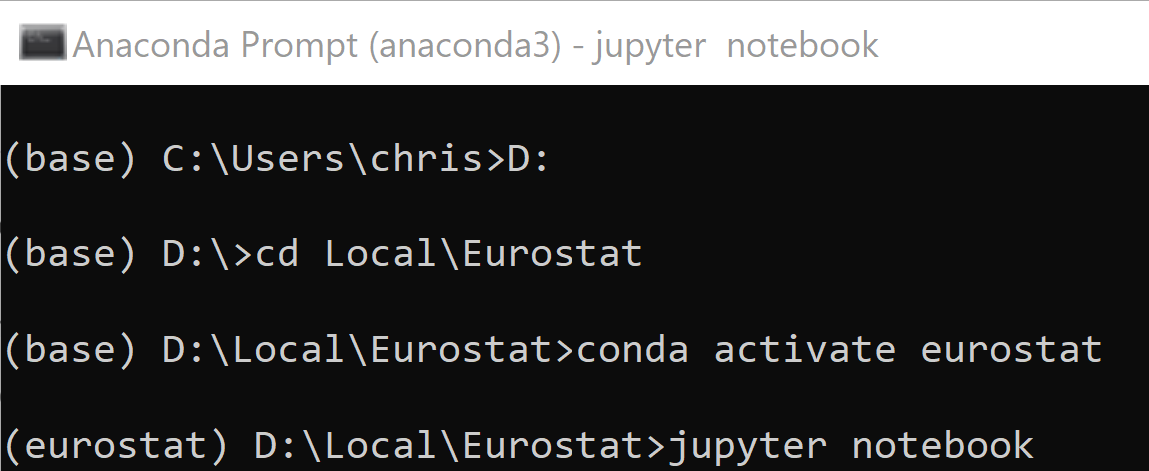

In [40]:
#@title Activate Environment and Launch Jupyter
base64_data = "iVBORw0KGgoAAAANSUhEUgAABH0AAAHXCAYAAAAhqSabAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAALEoAACxKAXd6dE0AAIkWSURBVHhe7d1fbBxXntj7X1O2x5JnPBI9Sa6HkGyJi4ixfQPIHt1chgogSqMX0cBFNjYfJF1oYeA6FDePYQAqK2ABYchdMG8GpF7nPgwRUpihjRkMdqk14KEoINK2E9nWQ2JfKhOaY2nbcXYcU+N/kvyP9/yqq7qrqv9VdVd1VxW/H08Pu8lWdfWpc06d+tX5k1tYWNgQAAAAAAAAZEpuw7CfAwAAAAAAICN67J8AAAAAAADIEII+AAAAAAAAGUTQBwAAAAAAIIMI+gAAAAAAAGQQQR8AAAAAAIAMIugDAAAAAACQQQR9AAAAAAAAMoigDwAAAAAAQAYR9AEAAAAAAMgggj4AAAAAAAAZRNAHAAAAAAAggwj6AAAAAAAAZBBBHwAAAAAAgAwi6AMAAAAAAJBBBH0AAAAAAAAyiKAPAAAAAABABhH0AQAAAAAAyCCCPgAAAAAAABlE0AcAAAAAACCDCPoAAAAAAABkEEEfAAAAAACADMptGPbztv3+97+3fn711Vfm8bX1s6Lex+Tsn1Go/Rnub5jLVT7v/vvvM48HrJ/q+9//vvUTAAAAAAAg7SIN+ty8ecv6eefOF/L551+Yn3es19UfkRNX7KXM/7so9qy0DWdD+rPyIVu3bpNt27aaxzbr9WOP7bJ+AgAAAAAApF2kQZ//8l/+q/VTe/x88smn5Z4/pY9wf0wl8OLuedN+0KfyD9z/1v35lc/LWT17Hn74e+UePv/4H//v1k8AAAAAAIC0i3ROn2+//dZ69PT0yP333y9bt26VBx54QLbct6UU0XEeDvN0w/7PerZReXzrfm5v1//45ttvKo9v9GF+Z/2sPL7+5uvK86+/sbbX07PF2i/dTw0COX8HAAAAAADIitiCPg88cL889NA2+c53viP3bdni6ttjOC/sDjhOkKf8MNvY0G1tlLbnD/w4QZ5v3UEe63dfy9fmuQZ3rOdffy3fmOca+HF+ZzZVDkptMfulnO0CAAAAAABkRYxBnwfsnj73y5b77vP28DE23P9tVB7WNvSn87zWQ4M9nh4+pYcGfDTIYz13gj128Kf0KPX00WCP1QPJDvo4/x4AAAAAACArIp3T59q1N62fd+/ek7v37sq9u3fl8y++kC8+Nw/zM9ejEzjnrKCQ+2MrAZ2N0ggw/c880d85gSDl/Bvr/81z51Xp1+b/rP+Vflq/cd6v77UeUp64WR8PPfSQfPe737V6JKnBwf/T+gkAAAAAAJB2kQZ93njjP1k/P//8c/n0s8/k008/s55//nnpp/asue+++8o9bJyPdnrm6PCrXK5HtuhcOz258vAtJ/jjsAI4pWdWIEd/Wv+vL+y3Oe/Xd258q+8rPXTFLg3y6M8dO7ZLb+8O2b59u/XeoaF/av0EGluX66++Itc+1ue9sv/552TfDusPAJBQ1FudsS5rS0vy+urH0tu/Xw4f3ickM1DD+nV59ZVrUqqS9svzz22msrImSy+/Lqv6dNN9dwDdEGnQp1B4w/q5vn5b1m+vWz8/++wz+ezTT62gz3333ycP3P+A3P/A/eWgjPrqq6/kyy+/soZgaS8gnQNIA0POsCwN/Ljfr8+dV6Xfl15Zz+0/uN/v9CLS3+mQM+3hoz19/v7f/3vm8fetn+qf/bMD1s/Q3CcuGtObQDIvntaWXjYXGvaLOnp7e2XHjn7Z8/Q+2U0ezba1JXnZzhD9R16Uw7utp9i0Ol9vra+vyW/ffktW1z+Wj0snyBJTD/WaeuiZRvWQ67yaqvzrKneKsgfUQdCHoA+Ajol0Tp/S6lnfyldffyX37t6zhnTdvXu3HNDxPL76Wr4yv//yyy+tv2vgRx/W/Dp2z55SD6Cv7fd8Kffu3bO2d9f81KFj+rz0s/R7/UwdVmY9d95rP+7cuWPtjz40EPXJJ5/I559/Yb3P2adWrf921Q74qI9l9bfr9nMgWT42V16rq9fk9VdelleXrpvLQGSTaVDaF569+5/nohMdpgGml+WVV16Xa6u+gI8yv/jYqYeu16mFduyTw/t7raerr78q9d4GAACAxiKeyFmHYn1jBXQ0mHLniztWUObLr74sBXR0cmUn4PP1V+b3X5n3lQI6X5vX+rdvzKPUM6f00N+VegLZQR8n4GP9rLx2Aj760wn4OO+/o0Gfu3eswI819OzTT62HBoBKn10aXtaaNXm7dOu07ONrb5vfAt3T298v/e6H3lkvXT+V6UXXK68ukVczaG2pcgfxMN0O0VW9pg7aL/uPHJEj5rHf1Efuuujja6/UDfzs2HdYSnGfj+VaWoLUu5+WI/2lL6jDu54m4AoAALos4qCPTrq8YQVpNJijQRbthfPVl1+We+1YgR19roEf877Ko/I3DfaUtucL+ngCP6XgTvmn/7l5WO/TnxokulPq7VOaY6gU+NGgj/7d6l1kHi1Ze690cWXo0JmSVXmPK2l0jbnIevqwHD7sejz3nDz33Ivy4ovPyxH77rnl41V5fYnM2mnra9fl+tKr8nIcab+m84mUnvY/Q5dxdMmOfjnyvNY5z1nz2uzbvVt2m8c+Ux9pXfS8qx76+NpSnZ48O8z795sazfj4miylorvPDtl9+DnzvV+U55jPxxJrfYdIcIwAINsiHt5VCp5ogObOnS/k089Kc/l88YUGf0pBF2eYlQ6t0mFWTvBF/17uzWO/xwnIOEO9NHhkBXDcD2s4lx3YcQI81qPy3B0M0s/QhwaS3EEmJ9AU1tp75ZCPucDqLzVOjVWiPkgkc0Gy7zl5/ki//dpYfYuhE520fl2WXr9mDXuJ3rpcf8uuk3rpZYBu0WDN4Ybzhu0w9VClGmowLHrHPjGnVgu9aFMo1voOkeAYAUDmRRr0+fqbr62HBlW+uHNHPtPVu7743AoAWQGfu3et3+sy7vr7zz/73HrPF59/bvXE+dIOzDiBIX2ugRkn6KPDwfR9GsRxB3SswI/+W/2d+VlZMt5+nz63t+0EffThBH10DiF9hLcmlZhPvzy++3Gxe3Vr1IfGKRJrx+6n7WET6mP5+Lb9FOm29rY9US+9fJB8u/e4gs8N7H7a7u0jq/IWEWoAAIBQIh7eVeoxo3P4aODms89LAR0N9GjARXvwlHv7aE8f83ft7eP09NHeN9b7zHN9jz7XoIwq9fSp/F1/Ws9dAR3/sC/33/ThBHucXj5W0MfsrwaV9BHW+vW3ykO7ShdYO+TxStSHxikSzJ1XTV6+TV7NgnLPQ3r5IEvcvX1Wf8sE9AAAACHEEvQpPUpDvXSuni/vlYZl6fONbzckl8vJlvu2WMu3f+c735EtW+6z/r1Opmy93w7ulOb5KQ2/yuV65P7775cHH3zQWm5dl13/7ne/ay3BrtvRpd51u6ocxNH/OT/d/5nffbtRCva49zmcdfltuStsv+yxL7B2PF4Z4kXjFGnxMV190m/9upRHdvU/Ti8fpMqO7Y1zbLlX0MerwgKZAAAAweU2rKhINP7yry5aP9d0cuNVfaxavWp0Lh4N5GiwZttD2+ShbQ+VAi0aePl2o9TrRoeGmZ9ml8x/uks5ue++++T+++8zP++3h2GVAklberZYQZ4tW7Z4evJY77Efbvrvvv2m9HnfeeA7VqBJH3v698gf9P+B7LEjNv/8n/9f1s9AzAXWq69cKy3V3n9EXiyviaxL1b5iD7Holf3PPydNF89xb6t3vzz/XGlYxvr6mry99Jasuta77e3tl/5nnpZ9jSZLcNHJ+X773qqsrnuXzXW287jZTvCLw3Wzvd/K2+bKcl2X3LV/q9+zt3dHsO2tr8vab982F6fr1vLhFZVtNP1uMaaX0jTT7+jejtmQ9Pc/I0/v220+K9wxjvYY1Le29LI9gW+wfLd+/VV5xR4LpMt6P+f5B+7v2C9HXjwsVg43abykK0M538OV/lWiONZiPu/lykpU5WNddYzMNvv75Zmn91XNI1LreAbKF3XymfW93l4y38tXBup8vmVtSV52ZlduKGCdUUPleAbfRlt5k3rLoN5qR7g6q1IXVNdXSeKqs9x1p4u77u0/8qKUmw91VNKpzvsjrKvc++Zt2zTgrt/03+x5L5r6zpSN62+bsuHf/0BlLoJzWLtiLvNt1UtRnZPaOUZRnmPriaLu9otkm7XbNtXc9YkRZ34FkGlb/tSwn7ftxo3/Zv38+ONSRagPa0jWl/es3j7aU+eBBx6weus4QRv9nQaAvv6m1MtHn+vS7k7gpqdni/U+q3eQ/f4HvvOAbH1wq9XLx+mto+93nvvjWPraepj/dBvay0gfO3bskF7z0J/qH/2jAetnEOsrV+WtD+5Yz/t/9GPZU66Bt8qD99bkXetvd+TuQ3vkiUe3lv5Uz90P5d13PzDvNrb2yZNPPCofLr0qf3nlHVm/U/oMx5076/LBe+/KW7d7ZY/50LpbNif0V1/5tbz13gfywboOqbN/b3O28+5aj+wxn9dkD815fUkWX7libU/3ybdX5e3d633GlRZu5iS5tCivXHlL3vtg3Rq+51XZxltrt6Xn0T1SN9niSC+ljcHFV+TKO6Xv6GFer3/wnkmv29L76KNyd+1dKR3+rdL35BO19zXiY9DM7TWTttYd8Ab75PLhu1fs94v88MkDvuN21/zd+Y46Sfke2aHf5y/ftH9ns9Pf+1ERHmu5LWtvvWe2aFif9aA51ovyl2+aC3jPds021z+Q995dk549zncv7Uf1e7354pnaGbZmPrt73ZSD16/IO3o8rTc5nM9/S9bMNp/wb/P2mskHQbonBDt2tZSPZ+9TMvRMk/wURd6k3jIq26DeCkePzV++WSoTvfuflcO7m2/p9/b+37n7UCR1ZjxcdZZTd1rPK+5+aNLPrkh7++vlvYpK3V7n/RHWVVsfvCdrzrbWc9JbY//91t7+tb1/vbL/x0Py6N126zun3L1TyoP2b0vcZa5RHmznHBaRuMp8FPVS2+ekCI5Rq/m2J0C7Osq6uyzKbfrbNrXSSAOXfyn/1fkYAj4A2hBp0Of/W7lhBVecgI8+rF481jCtr8vBG32Pe0JlZ76dr3SOnW9Kw7mc4I0+9HdWjyH74Sz3rv9GK93SULCvyv9W/42b9iZytmUFfcxDg047tm+XHb29st381L898cQ/sv9FM+uycvUtu+HQLz/6sbdR5G40BWqc+k58ffeuyuv/Ve8emIbK/qfkR08+Kf2P5OT2XT3J6JuM9ffkwwYnPm2EvVM+n+vd3qfkD370pDzZ/4g8krtrnaQtdz6Qd00jo+6Fr7GmjZQ37f2zlLb3I7O9fnt7d+0TdO0GrLkoMSeuN10tLb2r9cOnfmS+W7/5bo9IbutdWS/vkzlpei7efWJIL2sf/8PrslrZReuu0lM/+pFJs37zHXPmO+r21uW9D++Z47luGm36rvoXT1EegyBCBX3Wr8vSFeeY9sofPON/v6/BvOf3svSX/9V1181W1ViJ+Fj7GkYP/Y/X5T/qQTLb3G+2+eST3vxnNmi2Zy5wTQP/9tJ/kNetA6p3CJ+SA5pfTb7ImXzhfLzmi7oNSH+DdOu78sp/XLVe63d6yvp8kzfMNu+68tqdmtvcIb19fSYPaBqYvKkNRv21acQdOaDlyPzeevxQ/rdHmzX4a1mTt39tp9MPn5QDTfJSJHmTeot6K3S9pb2uVuRvlq5aQSrV239Envunj1rPG3PdULlj9j9AMKI7EhD0aaeu2vqg3CsHB9clVzcg6nDVPeWAczv1XamHzn8sl7tS/f2UKw+W63vNg3WDCq2ewyIUV5mPpF5KwDFqNd9+8G6TwE/U7RAVb9umOg+W0tjpdEfAB0C7Ih3e9ctf/sr6+d57paFdq+ZneWJl89BePs7DmX9HOcEa/enQ3dLAjPNwv1+f53py0pPrsYJJ+u/0p/4b5+HmbF8f9z9Q6m2kjz17dHhXv+zeXeq+PDr6nPWzqTVfV+bqvtaeyrpp9213F1ebNoQPm3/kr+A9Xa/rdB1XVnfwdXNhXK+bqfs7mBN2ve673s8zDZUjh813qXXaWZe162/L7e2HzefZv7L4T1xmn+su5et7b73vF3l6BT256ndcktcrO2jUT7uojkFQgYdKaM+AV1zdhZvmYW34mfJs/oE3nTU9fivb9zlpFcOx1oaWu2uzUXNoh+879fb2WkFnax+eq96uJ1/UO9418lmj7+QvK3WPgXu7NdO+Ba5tBhn6EknepN6yBczLm7He8rzXx6Rp3c+op7y9Jp/bVe46q/axcx/fyId3Odqpq9zHrVkd5Xpv7bo5XH3n/q71yofmaXfer13nud8T9BwWsdjLfP1jXPXeuts0unWMos63ljjSKI5tuuqJqrrb5MulV8ppXL9uB4DgIp3I2R10cT+cSZO1N45O6Pz5559bq3Y5jzt3Sr11rF5B9kMDNfp+/b3+XVf4ch7Wv//0M/nkk0/KS7s7gR39nIbMn8v7poEg53mzf+dSXiHH6HdmcPbYIfucpUaM1fdCLt5uKvjaJ1Gz5X2HXUttr0rdTVsnCb2QqXOa2H1YjpR38WNZrTUzpjkhL/lOsLUvnNQO2W32zXvhZLiWkLZOfnoBXvfMZdLtuec93y/QCmjtppd7HxueXPU7PudKtyaiOAYRWtdx6EuvmkaWO4iijZfGDTxNN6uxrI02TzprerjSqhPH2jQwawY0duyWw64DYwV8NM9qw6z0K48d+54xe2gLPDFs4++0w+SN58tf6GO59nbIch+RZhPiWuLIm+2WQxXFflFv+SSz3nK+Xqh/vb3X/ncfC3PPN9JmXbV7T6V+XH3PXJ7WYy5w3ypfmUr/43ULSTBrS5ULXa3r65SPUpk7Ut7H5otmBDyHxS3KMh9XvdRMbMdIRXCOjSONOpzu3oCPfh4BHwDti2/1rg3X/DrW/5ygiv7s9EOVnlv/WfumwajSPjqPYNakEvOprNpVJXCjyU8vVBtV8MGW2g7SkCmvhlLH+m9XzWm1pHe/uQgIfdZxNwi1fWBOlPbz+swJ8/D+8gVB84ZCu+nl20dr6f3Gdj9d2b9GojgGrTGNoVdelpdf9j5eeUUbEq6JEbUx8XyQY2JoY7VhBujQsW60Drm7zBmN8+xuqSR9sAvIIN/JE0wKVe7bdNs5ruaieLv1pKHo8yb1FvVWDdufliNHjpQf+3W4SG9pLz7+eFWuvf6KvPLyqxL4mmjH9vK+1ctDiKKuctePDYK067+tTIjc/0wLZc2rckOtSV1vce1jkMB903NY3CIu87HUS83FeYzaz7dxpFFn0117M5UDPuabWgEm+xUAtCPinj4a5CkFerQXjRVc0ddWwKUUcukO1+eap9b+6X5p4Mfsp/YS0kcgujKZ/VT69zSojAM2mvzMhXizm2XuO/lRLbVdvR3vkvTPtNRYum22az81Da6m7QPHjsfNhYH9vFlDoe30amEf3fsXoc4tm67j749Yd/Pr363yan5R2YFjbfagcSeW7WJfT1qa9XjZ7npz8wvIBgFeD/c+rEtWrkub5k3qrXB5ebPUWzt2WMOnnce+w4fl8HPPyYsvPi9H3HfsXwkR+EET0dRV7sBevd7K7gBr7V7PYbhuqAUoH6pShzcP3AcJjMaqG2VehTrHNhPnMYoi38aRRp1L92BD/ACgNTEN77IDP+bh/D4prMCTFfiRUkDKNclzEM2HdlV4Gk1vXTenp27RyTPXZG3tulxfWpKlV1+VV199uf5cC8p9B8+cYQN0Hqi2frvynV13aJtzX9wH64XRspb3MawWjkEbdDLXykSM9mP/fjly5HlzwfVcgy7ZtQToPdKJYx0qHwbr8RJY4M/uYN51aa/XQ2fzZnDUW3Wlvt4qDTl7sTxO7GO5thTuHNlq4FAvrPy9IKsfKQ5CRVVX7X66MkSlZq9Fb4C17ZiPO09/fE1eqXlcvI/KBbL+80YHLOLzQTckoV6K8xhFkW/jSKMOpfvttSVvwCdoL2wACCim4V2lHj76vBxMsX86AZZOPtyfa/6v9Fz3zbWf+mhq/bq4ennK6uu1T3Llh7th3PYdlrBKk3e+au3LK/LK66/L669fk2urq+aiyJyAKufh5lq9qCgPOdHzebgWl7sXRqza2MfmIjwGofRK/9OH5bDeVXc/9u2T3UG79ni4Gy91pOFYd0g6vk+38mYz1FuBZKXecgcWOn6OROP86h5uVKO3sivA2rv/6fYvUF15OnoBzmFJl4R6KdZjFFzd7xNHGnUi3T++ZupY53qhV/ZrwCft+RVA4kQc9NHhUk4gxRVc0WCLcn52WPnzDX2qr635fKyePmZfdX/Noxl3V+bw4p+ot0xXMjKN9devefdXVzTSJSb7+/fLfp1joTLTHKLGMdi0bncvYhJMUvMmZab7On4M3IEFc3HVTi+EgHTC3Oeff77Jo5W5oNKnWV214/F+cwla4h/iVWkPRTCBs1+v9ko1+SzE45mo9wGNdfEYJf4cG5ZVv9rPTanSCaqJfwOIWjzDu5yAjz5Kf7D+ngyl/dJ9Ku+j/WjM3ZXZ1NG1hs/UfFQax1FMotfculxfci1dbRrpR55/UV588UV57rnnzEN7feyTfTrHQgdvfYXtil85qZuTYdQ3sutodbhAtWQeg05Jw7HujM59n2bzF1UkNW9Sb7UqS/VWmGGKrfdw2iE7djR/bC518uuOfVJeiNQzxMvVHuoNNrdLU+WV2Ywd2z1zQQV6bKJD1rV6KXHHqP73iSON4kv3fjnsWulMVl+XV5Zqz6MFAK2KZ3iXBlGcXj/275zJkr92LcveqYfz2aWHax/Nw72CV0OeuSJ02U1tAAd5tLI0dBvcS0tay2nua+1E6x4a0eoqRO4GgntcdFPuyfli7pbd0j66JvarJapjkCZpONYd4V7drxvfp0lviaTmTeqtcDJabzUNXoY6HunQPNBVPclyNILVVZW5CV1DvFztocgmSHaX3Qwe57YloV5KxDFqkG/jSKOOpftuOfy8a4XF1dflVQI/ACIUbdDHHiblDJnSCZ1LAZ9v5euvNeDTvcCP8/nlgI8V6HECPqUAVSNrb18rd3fv7X+8cuJrarc8Xe4KX+q2GSd3A7LZndDGjU33CgkhVh9z86xecE0Cf/UoJmMNyt2ICRqUc6/gVkN0xyBF0nCs29FK3ujk93E1TBvlqaTmzej2i3qrrkTWW+4etCYPN0s01/wawXu3JU/jVZr8mgTr/KKuq3bvKd+4coZ4VYZ2RTCBc5mr7HbiBlnaJKJeivEYRZFv40ijTqb7jn3ynCvw8zGBHwARimV4l9OLxvzPFVip9Pbp1sPaB/Ow5hly7a/zqM99ZyH8+HX3uPiW7z5Hbk3eLt/WrWWH7Cv369abDkst7Ld7vgazjUArmK3L9aVKgC3+ZVbdS+sHCcqZ/XPP5t2WZscgTdJwrNsRPm8E+j5R3S11BQGiGe6T1LxJvVWSkXrL3bsowDChSrApQIAoydy9B5q0Cdavv9UwWFct6rrKldesfXUd//495q8hNKzvvPM7hV3NLfs6VC917RhFkW/jSKMOnw808HOkcs1gBX5Su5QggCSJNOjzjfbkMY+ceX7//ffLgw8+aD2+Yx4PfOc78h3zeOCBB6y/3X+/+anPzUN/F/XD2rZ+hv1Z1u/Mc90H3Z8Ht24177nf7GnOCgTpoy7PnYUWxq+77xSYLbV09zkgzx3Ea2/LWq1zhU7W+Wpl7oa63CurmHe//qq5gKp77imt+HLd99100sxKR6dr8kqzbSy94roI2C9Pd2DNyt1PV3eprbmLJt2uv+ravzoiPQYpkoZj3ZZGecP81pM3Gn0fTy+NjyWKEI3nwqxBoz2peZN6K7zk1lt6waNpWjfBLOtrS/Kqe8Waw80vjMpzZEQ1j0y3+NoEr9c5dppG7iWvA4uqrrJV8pppv1x36hdzzIJk9BD13Y597uHwWu6uNyh3xrqWPZPXGme1zIitXkrKMYog38aRRh0/H+w+bAV+HB9fe4XAD4C2bflTw37etmtvvmkN6/r0s8/k888/l7t371q/z+VyViBoy333yX32Y8uWLeb1Frlviz43D/3dfffbP9t/3KfbN48e3XZPj/lZeq1BHw34bH3wQdn+/e3yve99T7Zt22r1Avon/+T/sPbXb+3tX8t7dn3b+9SQPPPo1tKLwLbKg/fW5N0P7liv1nO98sweV4v17ofy7rsfiPXXrX3y5BOPmn/RwO01eau8Q/3ebe3Iye233rNPmuvy3rtrsnb7nmzN3ZXbt38rb799VX595R1Zv2MabPt/KB98UGc7lq3y6BO95uPM9nTn7uj23pK31m7L7Xu/l5w5vuVt/votec9sa2v/M+LdjL0NZ5/sbayZbfyPeyZf3DXbcm/D3h3dnyPP/VN51H7pEWV6qa2PyqM9leNzZ/09efetNbNf90ze9aabvqV3/xF56u571nP9fn1PPiGeLBHpMQju9pqTfjX2KbS78uG779rfsVf6n9kT4E5VDMfaND/XnO01PdbufW6eBnc/fLd8zLf2PSlP+N/szmdmH/u3rptjVcobejzvmeN513yf35rv85fm+9ibMsz3+b/rfZ+S3685+2nSaM3ktXtbrfT57dtvy4c79rR27H5v5+E7d+WhPXW+e5R5k3orXF7eNPWWKYdvX5Fr77wrb71lp9n/MOmu2/mt2c67V+XtX1+xvltpz3XfnpXDu5tl+jXz7+z9++GTcqDquCeFq86qW3ea/LX1duX4Oseuxxw7zZ+/fVvevvprufKO+bu5aNz/ww+kktz+vGrEWFdZtj4o9+w6a/0D53OekqFnmuRhW/D6bofs6TXp5+SNOx+Uy909U+7ulsvdu+Zh0uetd03Zy9Wp61s5h0Us6jKv+Sbyc2xJV45RLPk2jjSKY5tN2jYmzfe46/cP3pW1nj3V7RQACCjSoM9//k/XrAmcv7ACPvfkyy+/tAI+1tAp89MK+GzZ4gr62AEg63UlIBTFwwr49PR4furD6n2kQZ9t2+S73/uePPTdh2Srea37OPh//hP7m7i5Gpqm4fDU0DM1GhfNbX3wnqw5J7f129LjviiLtGFgTsh7eiqfZf7/zro5Kb/3nnl8IOvWVZBpAB15Tv7pg80aGMps74k90nP7Q9PoLG1RT3ja8PNus6Rmg1S3YRpc7m3csbah/77WNo7Is88+Xb+BEnlDymzm0Sc8J1hNt/WqdDP/fP/z8ty+B5sEF6I+BsF0P+ijIj7WSQn6bP0D+fFzQ/KQ1TAuHc8P7O9TLhdKG3nPHpbG16+mAfmoK3+Y7Tnp80HdC5jmKnXMHbn7UL3GYYR5k3orXF7eNPWWuxzaaeZsx6S/bsf+k/Vv9x/4sRz+R7WOoc/a2/Jr+zP7f/TjGscrKYIEfQxzUddrjvF75Tyk9YCTTibNrOQuXTQ+WK7b9VdNgj6R1lUO740rFfwGWMj6zqTLEyYf3v7Q5BX74zQPaTCgkhfXdTMlvT+UJ/eYNK7alSwGfVTE9ZKlS8cotnwbRxpFvc3mbRt//U7gB0A7Ig36vP32dSvAcu9LDfh8ZU2grAEYHVqlPWy2bdsm2x56qPzzoYfMT/O89NP83n4d1UMDO/o5W7/7Pdmmj+89LA9ZPXvM3x58UL7/8MPy3e9+1/p83e9/8n/st79Jxfr1JbniNHRC3Nmq4rpTZqpu70VZ1A2DrY/KE+bk1GtOTrdz5uRZPg/1mrcfkGd/PGQ+27wM1MBQpkGw5wnz917puXdb7nq2af5pb6/88KkD8uOhH5e2W1NpG3vMNh6qsQ2d6K7/qafkR0PPytATOxp//1gaUppsru9oTt6V3dN0e0oO/Njsm9XSCBBciPwYNJeMoI+K8FgnJuijn71bdj9hLrh6b8uHt10NWqPXHLunzMXrs0NP1Lj4qEHzh0mf2x/eNo3myoZ6TeN4T80LmABcdcyduw/JnnppFVXepN7SjVBvVe2bSTOrnJi2QO6u5Pxpptsy+dwpL48GzOyVHrf98qMfd+ECPrCAQR9jh5237pl6IGcSqZLcmq9M3jxcumis1O2a3M2CPhHXVbatJrNUeoL1y4Fnzb+3ngcQtr4z79eg7Z7eh+Te7buef6OssvtDU+5MfvzxM/W+R1aDPirKc6ytG8eoZr7Vbd6LIN/GkEaRbjNY20br997blfKvgZ/bvSaNgiUCAJTlNhrPYBzKv/9//1/r5/r67+X2bXPiWL9dnkBZH9Ywr1xpuJcqvS491/Ff5lXpucX9PKjKVylN1JwzP82jp0c2cubRs0V6Nr4xj2+tn9u3b5ft3/++7DA/1b/8l/+P9RMAZP26vPqKPRlj7355/rkQkzF2y9qSvGzNk9Ir+59/TvYlfoeBAFxlsdRrKckZe02WXrbnPepUvdGJusr9Gf1H5MXDYScqAQAA3RLpRM7OEKoHHihNmKw9anTOnB07dsgjjzxiRf71Z93HD6J8/EAe+Xs/kB/8vb9nHv9AHvnfHpUfPNonO37w9+V73/++PKQ9gLY+KN954AG5T+cWMg8ASLXy8spBVkIB0mHtbWclnH55JumRTPdE6u4JclOusky7OQrRrdMOAAA6INKePsuXL1s/v/jijnl8IXfMT+3aY/Xo0T9Yz+0ePXZHnnJPH8P9vF2lL1Xq6SM9W6xePvqQr7+Sja+/lI1vvrKGeOl8Ptu2Pmi9+9ChQ9ZPAEhlTx9Fbx9kSap6+Rjl8tfB/Y29rnL1XtJJdF88HG6pdgAA0FWRBn3W1kp3lr/++hv56quv5Kuvv3ZiO1YQphzSMU88Q7lcT0uqfhGC83WcbeRkw4o09ZiHef7tNyK6PLv5ed/998kD92tPn/usd+7e/bj1EwBSG/QR19K2qdpvoNra0stSimGmIy+X99foP/KidGQUVMx11fr1V8VZOj4VgTcAAOARadAHADIjtUEfI229I4BaUtZrbd3s7ytOxKeTdUacdZV72/TyAQAglSKd0wcAkAA79slzR+zZfa4tyfXyJCNASmiwoTxM6nDyAj5rS/Lqq0uydH1N1q5fl6VXX60EfDRIdThFQWI3k+5L+r2W9PGqvFwO+GjPJQI+AACkET19AKCWOO+eA0g319w9Xr1WcOTw7g7WFlHWVZ6ePRX0GAQAIL3o6QMAABDG9l7p7bWfW8zr/v1y5PnnOhvwiVlvb7/5Ti8S8AEAIMXo6QMAAAAAAJBB9PQBAAAAAADIIII+AAAAAAAAGUTQBwAAAAAAIIMI+gAAAAAAAGQQQR8AAAAAAIAMIugDAAAAAACQQQR9AAAAAAAAMoigDwAAAAAAQAYR9AEAAAAAAMgggj4AAAAAAAAZRNAHAAAAAAAggwj6AAAAAAAAZBBBHwAAAAAAgAwi6AMAAAAAAJBBBH0AAAAAAAAyiKAPAAAAAABABhH0AQAAAAAAyCCCPgAAAAAAABlE0AcAAAAAACCDcgsLCxsvvPCC/RIAAAAAAABZQE8fAAAAAACADCLoAwAAAAAAkEEEfQAAAAAAADKIoA8AAAAAAEAGEfQBAAAAAADIIII+AAAAAAAAGUTQBwAAAAAAIIMI+gAAAAAAAGQQQR8AAAAAAIAMIugDAAAAAACQQQR9AAAAAAAAMoigDwAAAAAAQAYR9AEAAAAAAMgggj4AAAAAAAAZRNAHAAAAAAAggwj6AAAAAAAAZBBBHwAAAAAAgAwi6AMAAAAAAJBBBH0AAAAAAAAyiKAPAAAAAABABhH0AQAAAAAAyCCCPgAAAAAAABlE0AcAAAAAACCDCPoAAAAAAABkEEEfAAAAAACADCLoAwAAAAAAkEEEfQAAAAAAADKIoA8AAAAAAEAGEfQBAAAAAADIIII+AAAAAAAAGUTQBwAAAAAAIIMI+gAAAAAAAGQQQR8AAAAAAIAMIugDAAAAAACQQQR9AAAAAAAAMoigDwAAAAAAQAYR9AEAAAAAAMgggj4AAAAAAAAZRNAHAAAAAAAggwj6AAAAAAAAZBBBHwAAAAAAgAwi6AMAAAAAAJBBBH0AAAAAAAAyiKAPAAAAAABABhH0AQAAAAAAyCCCPgAAAAAAABlE0AcAAAAAACCDCPoAAAAAAABkEEEfAAAAAACADCLoAwAAAAAAkEEEfQAAAAAAADKIoA8AAAAAAEAGEfQBAAAAAADIIII+AAAAAAAAGUTQBwAAAAAAIIPaCvrkBkZken5aRnI5+zdIqlyudKzGBzhWAAAAAABsBi0HfTTgM5WfkMG+QZmYmyLwk2C53ICcmisdq9H8HIEfAAAAAAA2gZaCPtprxAr42K+lzzz2lp42MjJ9WS5fth/z4zJAoKgz9h6SIT1Glj4ZzROki4Mnf0+P2L8FvNKaT7JWf+cGxmV63vk+9IIEAABANoUO+pR7jdivRQoyM3ZaFlc27NdImo2Vc3JibEGK9msxR29i7hRBt4hdnHWl8eAxLiJRE/mk+0o3LkZl0AmGW70gCYYDAAAge0IHfY5O5WW03GukKAsEfFLBCvzMFOxXRt+o5KeO2i/SYWBgRManp2V+fr7S48B6zJvfTcv4+EhXA1maxhfKSdwnoyejSd9We1hogHbc6cmgD3ofJUJc+QQh7H1MdtlPKwblwCY4FJ76pO6jVKdOj4/LCEFJAACAVAsV9MmNTMtEpYuPFBfOyjkCPqmxsTgpYwuV/j4yOCHTI8lv0A+MlIZh5PMTMjo4KH195aijrc/8blBGRyckvzwn89PdC/5cvOIKrA0eoOcAaiKfdNmN9+Wm/bSiIFcu2k83vVKdOjg6KhP5ZSsIND0yYP8NAAAAaRI46GN1h3dHfAozcvzciv0CaXHj/Fnxxn2SO6RBe6qMTM9LfsI1DKMpc7EyOCFd6zxxcdaVvoNy7FSAya6w+ZBPumpjY1FOjy1IwTkGxUKp1+oGNzFq6zPnijxz8QEAAKRQ4KDP0SnfPD6nuSWaRhsbK3L+rG9+nwQO89KAjw4lnPBFe4p6cTYzJmPDw3Lw4EHrMTxsXo/NyIK5gnPFs7pC0/fS1cpe9A0d4iIJVcgn3afD7CaPl+qQg8cnN2ev1eKCpy51HmNjYzKz4AqKOXRYMPPBAQAApEqgoI+ucnLMM6xrljuiKaYXO2c93X2SN5ns3lNnPEMJTa6zgj3H9eJscUVWXPlPL6BXVhbl3ORxOTGsFysFuWX/rRtunL8glSlbRrvX6wiJRj5BEKVVxqY7OrfOysqKLJ4rBcXGZtw3CYwUzgcHAACwmQUK+hw9OSqV/hYFuXD+hv0caeW54DRHN0mTyepFzpnKbOGGThh+wgr2NKMBoMVzGhjqXlBSh454p2zhAgnVyCdoRuvCOWuVsUGZyM91ZV6dlUX/6o8Gq84BAACkRi6fz2/863/9r+2X1ZxGp3MJXlwYa3kuH101pNx7ozAjBycXrac6lGfv0UNy8tiQadxWLvZ1KM/VC7OBLvYdusJT/6HH5MDOIdmly7OY7fkGCJnt3rS2e+niDU+PkaByAwNy9NBJOTa0q3pS4aLZ/k2z/VtX5NL5i6G3bw1rOlVr22a7haty9cqlUOnRyMD4vOTLwRU7sJKAIQ6efGIUZoZlMuYgjubzqTP23EE6hOzs6bbSwltu2ktbT3rocIwT5wPlK81Lp+Zcq+25ylwjacnf/u/nzydaF5w8c8xXpxTl5oWzMhuy7MeVJlHmk0Z0MvRDB4ZkaJdO0Gv/0mL23dSHN69ekdlLZt8bfHa9fFg5pjrJuv13I0z9HeexrCoHdbRzbnNEnU8GRqbljEl095ba3c9W6xPv+cIIWJ84oq5jAQAAEEzTnj57Dw25GpzR9/LRRu3cct6erNfbSLZWZAoxeaTVKM1PyMSo2ZZpWWqj27tFpb8vbVdXegpz51QvHsan52U5nzefUWsVKUM/c9BZSSrcJMkD46W0qL1t3e6onR7TkdxlvXHpqrnkc/TJ0KHuTyarFwbuoYR6UTIb8/RRzoV3efogzR/5ubbSOI3Lcmclf+cGRsqrvVXXKaUJaYPOSxJ3msSdTzTYM69pYerXUatOtP9Qpr/TVZrMvudD7PvN961AgVN/l9LG/putXH+3sZpelMcyTnHlk5XFyapeNn2j3ZlQ2ds71Aix6lwcdSwAAACC6ent7bWfVtOG7KEhV+O1cCXSuXysII3vLmZNsU0eWbpoCLJsubV6md4tLrdao2WtUqUXC/brhuwGc9vLrd+4JK65ZBMxmaw3yChSvHop0F3odvg/s6T9IFialuXOSv4uXVxqgMD+RT0B5iWJO00cceUTZ+W7WvGHKASuvwcnWpoDJspjGae484kGBnWuMvc0bKVz4lRH5/nxD0cU2SWPBawi46pjAQAA0FyTnj79stPVUiveWrWfRUAvBFxdxYuFBZkZq6wiUmvyyCA3wXVIQWHBbEtXeBob86xIYm3XXuXJLciy5dbqZe60sPa31vbN587oZxS8+9+AXjy5V6nS7+DfdvV+a8AqXK8CP/8KQtK30xzx7up3ZziTglcvpXj+qBQty52F/L3rwJRrqJTh+5xh8xnengoTDQNLcaaJRwz5xJ/mqla6Oyvf6eTnxTA7X1V/z5jtuOtvX1qEnAMmymOp9dw5Z5Uu12N42LeNFnUin+h3OH9iTGbcZaSv8/P8rN5y73mf7Oz2CQMAAABNNQ76HD3gWqY9rgtwe1WmyXOy6Brfb00e6WuUDx5r3Ntn5dxxa3WnyXNmW4u6olP1vAfOKk9jntumg9JoDlW9k3vANeTImlPB2t9a2zefu6ifMSnHD0427Rmld7PdkxZb2zbfwb9tZ7+HPV39219u/cb7N+1nqnE6xE17lj2m8zCV3ZT3OxDz8Q5zc7Sf3/1BtaQuy52V/K1DZ5xP0s/RZbjdn7NhPuO0b6hMvcmT40wTv6jziT/NNS8X7JXv/Puvn61pr5OfW38P3atO5yEaNmmzaLbjrr8n5cSMu/YO16sjymMZp07nk0U9d3kCaqXeqvPjnQn8eM8XIrsCdvWJq44FAABAcw2DPns9V+BxXIDbE5fWmehTu5PPuoMzfUMSVW9w//wEDRuvex8TT0pEmBCeldEKM00n6Kxebr3N4SAXrwRPh9h5e5ZJ8ZZE2LesLmv4hLmALN9ELxYim1A3FctyZyx/Wxfe9T7HN6TRZPjaAZYY06SWqPKJBk5PnXGluVGYOSGTEU3+7tVk4mlf3dLXQreQSI5lnDqcT1SS5vkJekzjrGMBAADQWMOgj2eoTeQX4MFWqvFPNhxdd/JV8fRUb+TG++LpD9Okx1FQ/rvEhSvBZiz2pkm0vXNauTDLAr0omXSGgByfjOxixB+4TOSy3BnK3w2DBIb2lvB1VqgtpjSpJ7J8sveQuKdh00BbPCvfBam/Q9SxNUR2LOPU4XzisIIo3ZjnZ/WWq2yGE1cdCwAAgMaart4Vm+JVCdSz29eo7kZPlKoJLK3GdQRzKXiGzxUk4DVxVZq0p70LMzTnCWKEnNukEzKTvwP0JFKeeUnqzGMVW5o0EEU+8U+YGzTQFlrQ+rtVER7LOHUjnzg06JWEeX4AAACQbHWDPlXzq9hL9HaeNygRpCeK7vvI+LhMz89byxVfvlz9WF7Oi2faiyYunvZN+mkvF6zbmtclpk0jO+wdXu/wOdNYX16u2s9aj+XlCdfFdLeHZKEZvcOd9OXbN1P+1rm/KhPs1p9bJY40aSSKfOKdCD1EoC2lgh7LOHU6n7h1fJ6f/p2eoGKkizsAAAAgFt3r6RMDK9gzPW8FdCZGR2XQNL7N/yKhd3RPa3d6zwpDJX26xLRpZOf1onZ+3rrL2oku/pmXgNXEopL05dvJ39W6kSZpWuYfJUkoOzdWb9nPAAAAAK+6QZ+q+RK6MUlmCNYEpnP5qmWKo6RpUlphyL+8tIt9lze/TBf78PxDzXZJZjoxpWD5dvJ3tY6nSYqW+UdFN8uOLs+/7F7eXuzV2gIMjwvL23uvMxNXAwAAoD0p6OnjXdGpXnfyvafO+IZrmYbvwoyMjQ27uv9XHsP+STBD0OWCtYGv2xnTRv6Cu2u9I2wX+4LMDNfe12aPKBv33eyuXxVoNGmYlXml9bulYfl2leX83ap40qRamvIJqnUqnyi90TE+f1ny7hNf0ZSzsXhWa9PPO+SdJTzzwwcBAACyoGHQp9uTZFoCLImrqwSd9ER87IbvuUVZiXmFkBVt5J+blOOmkV/rLm/f6Mm6QzRudH3pGeVbJr3LPMNbjESudtWizi/fHixg2kj683f02kmTINrJJ546O0s95VIoznySGxiRqTnfvHTFBRk7cVoW4zrn+VeGi3xFTwAAAMShYdDHe9HWnQsI72o0Ral53eoLDBUXZuNr+Dbg3OUd83QharDktGf522iXXg8sQFCtoy5eqVzwqgSudtUqnfvDsyx3wOWdWw6+RnxsU5m/YxY6TQJoNZ8ob53dJ0OHiPokQZT5ZGBkWubyE+IeyazL2x88fi62xRas4dNn3EPIRAoXzndpcQcAAACE0Xh4l+eirfMXEFU9eCJcJnjvUd9dywh5ll5u5MYlcY3kCHVxFxVvUK373fX1gtfb2adPRvNTsU9omxvQ1d7sFaR0xZ2YAk2evNE3JEGKlPdCPviF4tGT7ou06I5tmvJ3pwROk4BayScWX9C03V5HiFa7+UTn78lPDLrKdXzz97hVDZ8uLshsyPqkU3UsAAAAvBoHfXwXbZ2cX0LvLB6d8i7dHPTOYqNl3XW7usJXfsJ71zJSnmVt6/ROMvzzd+hQjvxcZy+MPUs8J6S7ftUSyCYXTMxNyUhMFwl6MTKX19Xe7F/oijv5uVguSlpaltt3IT840TwtciPTYq4NKwpXolvOOkX5u2MCpklQrS7fXh00jbfsIKQW80mn5+9xlM+X3oiPLJwN18unk3UsAAAAvBoGfaov2kLccW7GbOvM1ClzMeJdwlYbmVb3dWslLvuXqjBjGrd1Gpm+4JS5Kpb56REZcDUodQ6EcdN4ndPl3EOu8KUX0NZyu9PjMjKi26297O6A8xnuHW/SO+nG+bPeCaX1wlhXdxkvfY6f9dlmH0bGp627ptMjrTeatSF+zLOrlxLRXd9aAnnGNwGquUiYyC+b42qOQY30z+nvTPq3ki7e3k6O+Hq2hV2W2z/cx7qQNxdMpTzi/bdOHlz2Fh6ZOV3/tnxW83c74kyToFpdvr0qaGqVnbly2XGz6lu73MzPT9MrKKRO5BMrYGLOW52av8fJE9b+1jhfFmZOyLmQn9vpOhYAAAAVuYWFhY0XXnjBflnNuUPnNNh07oBWu5KPTF/2BnKCKszImLlobRSQ0Ma390K3maIUi326im7pVYPvFX7bjqIsjDVvIGtAakrnaLBfh1GYGa4fDGvCGipQvpLQ1ZXMRUQCgj4OTXe9SKq+WGguTLp406GinbzeiF5UnXJNwhrkc/TfHJ3yBUIDaZ4H05q//emo9cTByUX7RXviTpMgWsknDn+9HUzjOsBTf1tBh8a9PcIcnziPZb3yHVQ3zw16A+SM2b5779utl1o+D7eRtztdxwIAAKCi8fAuwzvMQG/Utz5HhHdlmSB02fUxq/HfrAfKxuKkb5LM+ooFc8EyfELOeroHRUs/Q7veB2kg6ySfp3UJed/qLnGqmi8pyuE/EdFjeqLGqjdRqz3PRlGuRjWBlE8ry3Lrv7l4ekxmwqSFPfwjigCEX9LzdzeESZMgWsknDq23O1F2EF6YfHJj9Zb9THVm/p5qeh6esc6ZrebtTtexAAAAqGja00dF2dtHadfxQycPyM5du2RXX5/vbrT2wLkpVy/MyqWLN0IPN9JeBadOHpOhXZVePKpYLMrNqxdk9tLF8jLu7ruPzb6TbvfooQNyYKfZ513mAsy9cUtpv29eveL5jLB0mNLRQyfl2JD1IVV36vV7yE2TPreuyPvmc1rt3u+98xpd74S4WD1dTh2SA0NDssukij/5rXSRUvpfaSFdNI9PnbHnnCgWZOHs6VjTQ4NuU8uV3i9heiaV0uKkSYsa5cekQ/HmVbkwe8mkQfAymsb8HWfvENWpNGmknXzicKd51XfQ/GLKzVXzHS41+Q709Kkt7nxSqpt2yhVTJ0UxnKt5Tx/dX1MMr141dWm4eqSRTtexAAAAKAkU9FHehmLygwSoL+ogHlrjuRgNcBGNzYl8AgAAAKBVTYd3OS7OLkile3afjJ7J7vLLWedfyvvCebrYd0PLy3JjUyGfAAAAAGhV4KCPzhFx1j1nTt+onDnF1UfaaK8Bd9f+wkyyJm/eTFpdlhubC/kEAAAAQKsCB33UyrnjMuOZ1DnftSWVEZ6uNOOZ26LQYBl8dESry3JjcyGfAAAAAGhF4Dl9HP6JRZnfJx388/gwNwgAAAAAANkWqqeP2thYlNNjM1K579wno/k5GR/gznNS6eoyU+6Ajzl6MwR8AAAAAADItNBBH7WxooEf18TOxatyibmAk8tzbAoyM8w8PgAAAAAAZF1LQR+lk4ue0MAPw4QSz+qdNTwjhWJBZsYI+AAAAAAAsBmEntMHAAAAAAAAyddyTx8AAAAAAAAkF0EfAAAAAACADCLoAwAAAAAAkEEEfQAAAAAAADKIoA8AAAAAAEAGEfQBAAAAAADIIII+AAAAAAAAGUTQBwAAAAAAIIMI+gAAAAAAAGQQQR8AAAAAAIAMIugDAAAAAACQQQR9AAAAAAAAMoigDwAAAAAAQAYR9AEAAAAAAMgggj4AAAAAAAAZRNAHAAAAAAAggwj6AAAAAAAAZBBBHwAAAAAAgAwi6AMAAAAAAJBBBH0AAAAAAAAyiKAPAAAAAABABhH0AQAAAAAAyCCCPgAAAAAAABlE0AcAAAAAACCDCPoAAAAAAABkEEEfAAAAAACADCLoAwAAAAAAkEEEfQAAAAAAADKIoA8AAAAAAEAGEfQBAAAAAADIIII+AAAAAAAAGUTQBwAAAAAAIIMI+gAAAAAAAGQQQR8AAAAAAIAMIugDAAAAAACQQQR9AAAAAAAAMoigDwAAAAAAQAYR9AEAAAAAAMgggj4AAAAAAAAZRNAHAAAAAAAggwj6AAAAAAAAZFDPhx9+aD8FAAAAAABAVvS8+eab9lMAAAAAAABkRc/a2pr9FAAAAAAAAFnR8+2339pPAQAAAAAAkBVM5AwAAAAAAJBBBH0AAAAAAAAyiKAPAAAAAABABhH0AQAAAAAAyCCCPgAAAAAAABlE0AcAAAAAACCDegz7KQAAAAAAALKiZ/fu3fZTAAAAAAAAZEXPvn377KcAAAAAAADIip6+vj77KQAAAAAAALKCCX0AAAAAAAAyqK2gT25gRKbnp2Ukl7N/g6TK5UrHanyAYwUAAAAAwGbQctBHAz5T+QkZ7BuUibkpAj8JlssNyKm50rEazc8R+AEAAAAAYBPILSwsbLzwwgv2y2C018jU8oQM2q9FCjIzdloWVzbs17WNTF+WCecfFRdk7MR5Wdlo/G/QvtzAuMzlR6Uye5M5XsPmeJH2kfLk78KMHJxctF8gqFKAMi+jdmYtLozJ8XMrpRfILP9xr6eV/EC5BAAAwGYWuqdPudeI/TpowAfds7FyTk6MLUjRfi3m6E3MnZIBemdF6uKsK40Hj9GjCkgAyiUAAAA2s9A9fTx3TU1TemHshJwLGPChp0935UamZbly8BJ519ubv+opSrF4U25evSVXLp1PVMCRXgXtSVJPH38PucLMsEwuUl/FIc6ePiquchl0v2ujx2VSDQyMyKFDB2RoaFBuXkhPuU/rfgMAgHiF6umjQQP3BXlx4WzggA+6b2NxUsYWKv19ZHBCpkfSeNe7T/r6BmVwdFQm8sty+fK8+R4D9t+66+KVgv3MGDzAXFdAABsbK3Lu+EE5eND7GB6eEVeJahnlEkFpsPdMfkJGRwfNecb+ZQqkdb8BAED8Agd9rHl8fL1EmGsjfW6cPyveuE8WJuHuM98jL5fnx7s/ZO3irCt9B+XYqb32cwBdQ7kEAADAJhU46HN0yjePz+mL9nOkid5RP3/WN7/P1FH7ecLoEMDh4aq7/2NjYzKzsCAFV/DK0jcq+S7PVaTpe+lqZcf6hg4xdxLQZR0rlzp0zFdf1X9MMrQLAAAAsQsU9NFuw8c8w7pmaaymmE7sfNbT3Sddk5uurKzI4rlzMnn8oIzNuANYhgZ+uhzEunH+QmVIitmfkxHujpbF6flpGWEyWiCUOMslAAAAkFSBgj5HT3qX+75w/ob9HGnluQAyR3c0pVdAK4v+lcmMLgexNjYWxTuFSDRp60wsPNg3KBP5ucTMYwSkQVzlEgAAAEiypqt3OReaTtCnndV06q2goiug7D16SE4eGzIXtJXwUrFYkKsXZuXcYvDP09Ur+g89Jgd2DsmuXeYXZnveOQ1LKz/pdi9dvNHS6mG5gQE5euikHBvaZTbvmzGxaLZ/02z/1hW5dP5i6O1rWhw9VWvbZruFq3L1yqVQ6dHIwPi85MvLzoRbiS0ura7w5v0uRsgVejSfT53RgIp5YfLdwtnTbaWFt9xEk7YDI9NyxiSOJ1fEuLrVwMi4HDowJEO7dOJs+5cWZ/W0KzJ7yeTxEN/LXdZ3+cumXXZksPIdN8PqXTlTZ52yVtypUebbrKscUR7LTtSxDmsuueXK0OJ280PU5bJq9a4IVwYLWxeG2Rf/e/15W4/xyTPHfOfjoty8cFZmQx7TOPN3O+fiqvRqQ5C6Iapy0+n9BgAA6de0p8/eQ0Ouhkn0vXz0QnZuOS/5Cb3g9rZidIWm0RAT9FoX/vkJmRg12zJX79oIrG4X6e9L280vh+stoY2t8el5Wc7nzWfoChk1Wl36meaidXR0wmw/3CTJA+OltKi9bd3uqJ0e05H0ZLlx6appZjr6ZOhQeic39fZcMkKs0ONcCFoBH6X5Iz/XVhrrELoLlbEkkfSkWlmcrOrV1Dca/QTWGiCYn79slclRqxzZfygrlaFBzeP54Hncyd9OWa/ebKns1ChVmaQXw6X6xFlxp0aZb7GuckR9LOOuY+MWR7nMEs2T05pfzDGuPh+XJswPOm9anPk77nNx1NJebgAAQLo1DPpow+rQkKtpUrgS6Vw+VkPI13Ohptgm6C01YoMsW27dcda7a+XIQLRGTAM2r41X+3VD2jC0hve0mR43LolrbtNUTzrsH7ohskseCxjD8gY2He0HweJYJlovWk8Mj3lWYCuVD3NRE0Eg0MqHE6N6vRQZ6wJNLySD5u9NoBRoNBfDgeuTUl01Px78QjCOYxle8Dq2U1i+vTYnTzbNkgHmTYszf8d9Lk6G5JUbAACQXg2Hd0Xdtd7TXd2nWFiQC7PnZdHuaq93qM/oBYv1qqRZV2QNIp0Z0qEKt+TK+5dkdbU06a+bdrE+dPKYr8FYkJnh0w0DWv59L+3vJbO//u2bRmt/vxw6cECGzPsvNNmusoJfrr7aOqztwtlZz7Zb3e9mvJ/d/vba1erwLuVPx6Bd1/3/ztH2UBJfN/wohyrpto9OnTFp5d7vovnOZ813bu0zaqVDrbyon713b7/0Hzogx4ZMHj8RruxYw+d8QxicbWoeHzLfydmLLA7v8terqlZ9UrvMB9uPuI6lbjeuOraWqM9BKspy6d+WOTipHN5VLBQ8wyq1jM648or22pnSgJD1qqRePow7f8d5LlZxlPtOlJu46isAAJB+jYd3HT3gargV5eqlOCZwLsrCjGl0T54zjbZKA8WaoHd4xjR5KgaPNe7ts3LuuBw/PimT58y2zIWvv1GlVlYW5dzkcRnzdJUYlEZzemoj9oC7kakXCdb+1tq++dxF/YxJOR5gSV5tqJ1xXZxZ2zbfwb9tZ7+HPcN72l9u/cb7N+1nqnE6JJ33u4jsCtjVxzvMzdF+fo9zmWjd9qLm45mCa9/D9wZx+POhfv+ClssaeVE/W/Pj4jmTx/XvjS5ER6Z9F2gz5uL1tDUvlfsC1tnm+dNnPb3PsujolP/iuXZ9Uq6rzDF2G5xoPFQlrmOp4qpjOynOcplW7mGVeg466MsrG+aYnvYNLa03EXac+TvOc3GcslBuAABAejUM+ux9TGcbdNyU9yOP+dgTadbpmaBDdmbdDaC+IYlq2hn/HDANAwR7HxNPSkSYEJ6V0cwFcbM7ztXLrbc5POHileDpkDJ9O/vtZ41ZQ6bMBU3BSVbtiRLRpNZxLxMdxTw/1l3/M/5edSek1R5DDmu7xzxXaHL2dPjJzbNEAzLeJBlrms56jINeCMZ1LFsRqo7tsNjK5eCEXL58OdhjesT+R8lhBVHqnYN8w4HNAa2qY+LO33Gei5MiyeUGAACkU8OgT/9O16VD8Zas2k+jEWzlFP9kwwGv4wNYlVvudmYjN94XT3+YJj2OgvLftSxcuWg/a8ybJtHeCQwaKEmk1Vue4EcYGviZPH5QDh40j+OTkQR8lD9wGccy0W3P87P3kLin7tLgYyTDAnzbLVwIPlQvq1qdGN9/IVg3H8V1LFsSoo7tsE6Uy7RpGPAxtIeUrzNlldjzd0zn4mRJbrkBAADp1HT1rtgUr0qg0TO+Rl437npVTRJsXVBHsLqGZ/hcQQLGfKrSpD00MOPmCdINHotk5TU/vSA7f2JMZsrdlYy+QZmwJvxunE/9E1kHDT42478AjGizqaW9cFqdGL+qDqrRy0LFdSyzqBPlMjUC9DJVq+6TRd9Ocd8i6ET+ju1cDAAAkGF1gz7agPOO7nq/S3fpvUGJID1RdN9Hxsdlen7eWq64Vtf65WXXhJcBXDztnV9Il8TR+VN0W/O6hLppdIa94+gdPmcu0JeXq/az1mPZN0km3b9t/Ts9F7zFW9H2TWuV9sTpxDLRGvhpZZ4fT4++CIMz8fYUTKN+8SZJuBRpdMHtiOtY+sVRx3ZaLOWyMFPqLRjkEdGEz52kc9NUvoN/npz487eK41zcKVkoNwAAIH2619MnBlaDanreajRNjI7KoGkMRrVcsd5hPK1DaNw9KWx9uoS6aXTmNWhjGnN61zF7Xc7Rjk4uE31j9Zb9DIhWnHVsN7B8e/qk8VyctXIDAADSpW7Qp2r8fp3u1kmhjSpdgta7hHW0NE1KK2jN1GxwWkxLTu865pfpct5p3p5TCZvk8+Ksa86dQTl2Kp7eWbo08LJr2V4Re+WmFpekBhydqGM7rkPlEtFK07k4k+UGAACkSs9G4idWDdZlfO+pM74u0eZid2FGxsaGXd3RK49h/8S3Iejytdrg1O2MaaNzwT2cxtF8WI1XQWaGa+9rs0eUF/RJGRIVljasPfNJxDi0pRV6kRLnMtH6/cfnL0veXQiKJk+NdWflJmRPJ+vYTom7XCJe8ZyLo5XFcgMAANKlJ9eggRt0jH2sAizRqqtgnfS0quyL3XOLshLRKkz1rGij89ykHNfGWo27jn2jJ+sOGbjRbCmUjvAG1VLLv2pRAueQiWuZ6NzAiEzN+eaBKC7I2InTshgg/3vKuSltTBEVl/Dzk7kFmSMprmPZzTo2brEt377pxJ+/GwlyLu60LJcbAACQHg3n9PEGJbpzMehdjaYoNTui+AJDxYXZQBe7UXPuOo55btM1WFLds8R4tEuvBxYgqJZ0Vvf5M+4hTaZpncDlwXUuCs8y0REsNzwwMi1z+QlxjxzQpZcPHj8X+Pt7y3mfDB2KpqB7g8ZDEmSzR6eyO4lp1ZDZEHPI6MXjAdfs7cWrl2oe37iOZVLq2DjEUS67wh/47rBO5O+g6p2LOy7D5QYAAKRH44mcPUGJCC8gAqq6SxZ0mfcA9h6Nr4HsWQq4kRuXxDWyoCsXG1lYVruq+3xxQWZDfo/cgK6oYq+goivAxLR8sydvBAyE1KPz9+QnBl3Hr8X5ey5eqfR0MBr1TgvDWw6a1x/6fczXyTTPxMEh5pDZe+qY65K1KFfrVYQxHctWxFnHRi3KchmLJj1ttf6a88zl1R2x5++QAp+L3W68L97YVWfvxrRcbrq83wAAILkaB318QYlOznegvTeOTnmXJg/ae6NRt3Ldrq6ikZ+IsYHsWTq8Tu8kwz+fhA4tyM91NvCT5mW1y8fSG/GRhbPhevk4F0zl3jK6Akx+LpbATxTLREc9f4/2dPBcq5lSNzE3JSPtfn9//VEnAFH7OGZUVVAm33SSWe3N5UmbwgU5V6e3QGzH0qfrdWzEYlm+vU3eoXr1e4ImJeBjiTl/h+Y7FwfjHaYmg8ciOxfEW27i228AAJBuDYM+1UGJCO+Amm2dmTplLka8S6pqw8casmKtdmH/UhVmzAVtnYag7+JSBidkfnpEBlwNHp33ZNw0qOZ0ydSQq2jkzP5Yy79Oj8vIiG639jKwA85nuHe8Se+kG+fPeidt1MCPrjYyXvocP+uzzT6MjE9bPVOmR1pv1OnFwjHPrrbXpb4TrPzR4FgWZk6EvmDw9nZyxNezrZ1loq0LPPO9vXGu4PP31HPx9IznYk0DXxP5OVOOTJ735UPnGGgenJ+frrv/VfWHHYAYd21vYGTcmo+ochwLUvDsSLZYy03PeL+gNclsjXR28rn25qooyMzpxt3Y4jiWcdexSZC05dv9vVQGJ7yrUDlBAu9qfd0Vd/5u91wcRHW91WfdBNC097RV9LNN/aWfU/c83MFyE+l+AwCATMktLCxsvPDCC/bLav67iDpfSKurRY1MXzaNGvtFGIUZGTMNwUYBCW0MLofaeFGKxT5d1bX0qsH3Cr9tR1EWxpoHIbTRN6XzstivwyjMDNcPhjVhDQ8qRw9MY3v4tCx2OejTch4JmNa1eNOhop283oherOkSvs5HBv0cDYaeMYnj3tMo97G1HgON843/uzamvZVOi5xcLueBuI5BEG31oLACcfV7nNXLc40Fz+OxHMsY69jW0qMiinzSSrkMl7/9mte5YerDojlPXrh1TCacnTGvD04ulp77VO13g/e2Iq78Hfe52KFDy6eWg5+TG52H4yw3flHuNwAAyI7Gw7sMb7d3qTtEIwhvd/UgdGnTMasx2qwHysbipG/SxvqKBXNBNnxCznruikVLP0OH2wRpZOqkk6d1mVbfaiNxqpovqXCl6wGf1tjL35rj2UrAR9We9yG6eSX8/Hdkgw6bvLF6y36mWpy/pwEt6ydqrHrTDv2u508EWIK4qOWl1FspfD2RPivnjsvYTK3lpWsLU5+oWI5lwurYqLVaLuN08XSQ5btL58nj5jyZlOG5cefvMFrZttVjyZSfKIpPJ8tNlPsNAACyY8vzzz//p7/61a/sl7X99+I2OfLsk/Kw9WqnPL7tDfnFtY+sV2F8dO0X8tOf/lTeeON38sUjPfJJT4/0PPywvV2H3uV6R177i5/IS3/y7+XnIT5Htz9rtr3tkcdle4/ZrmvDxWJR3nntL+QnL/2JvPzza6Jb/cH+fyHPPll606fv/FX97/SbJWu7v/vC7O8n5tHzqdm2d6+d/X7ntZ+VP+M3oZLoI7m2pPv/hvmcR+Tx7T3yaVXalL7Hp++Y9Cn8TC6azzlfaK2RPDD+p3LK/u667ws/+XNp4ZBG7h/++I9kaKf9oiZN509NOr8mP3vpJfm3/+5lWbr2G+t4tuyja/LLN7bJ3n1Pyk5NkmJBFv7NH8dyAeL4X2/ek71/NGRKk/Hwk/LI72Zl6TfWn+or7+cn8jOzf+cLMRywj35TlQ+r8rrJg8VPTR40ef2ll/JS+KhZOpm8/QtT7n+3V/Y97t1e0aS1lvU//rO/LpeXwOUyZrkf7Jc/LNd7IZn0+atfvNkwX35k6pVfzr5h0uULeeTx7VV1YanO0nz+r+TPQtcnRgzHMq461v2+VkSVT8KWy1zuB7L/D5+V1nb9b+VvZpekcbF3ys42K4/s9Ca4FKz0/nP5+V+XvrsnHf/2b+SndXa+ar8bvLdVseTvjpyLbab8LLnSvqqtomXnndfktZ+9JH+22PgDYmub1BLhfgMAgGxoOrzL4e1m3vpQGnRflEP20DrPEIgmw4EAdAblEgAAAFnSdHiX4+LsglR6DPfJ6JnOLy+OaBw96Z7royAXzsczjAmNJX6ZaGATolwCAAAgSwIHfXSOiLPucel9o3LmFK3htNG72O45JQsz3Z+8ebNK4jLRwGZHuQQAAECWBA76KJ2c0b0aa99oniU/U0RXEfGsqNJoGXx0RNKWiQZAuQQAAEB2BJ7Tx1G9JCjz+6RB1RLOzFUBAAAAAECmherpo8pLgtqvre7v+TkZH+BOaFLlBkZkyh3wMUdvhoAPAAAAAACZFjroozZWNPDjmti5eFUuMRdwcnmOTUFmhpnHBwAAAACArGsp6KN0sssTGvhhmFDiWb2zhmekUCzIzBgBHwAAAAAANoPQc/oAAAAAAAAg+Vru6QMAAAAAAIDkIugDAAAAAACQQQR9AAAAAAAAMoigDwAAAAAAQAYR9AEAAAAAAMgggj4AAAAAAAAZRNAHAAAAAAAggwj6AAAAAAAAZBBBHwAAAAAAgAwi6AMAAAAAAJBBBH0AAAAAAAAyiKAPAAAAAABABhH0AQAAAAAAyCCCPgAAAAAAABlE0AcAAAAAACCDCPoAAAAAAABkEEEfAAAAAACADCLoAwAAAAAAkEEEfQAAAAAAADKIoA8AAAAAAEAGEfQBAAAAAADIIII+AAAAAAAAGUTQBwAAAAAAIIMI+gAAAAAAAGQQQR8AAAAAAIAMIugDAAAAAACQQQR9AAAAAAAAMoigDwAAAAAAQAYR9AEAAAAAAMgggj4AAAAAAAAZRNAHAAAAAAAggwj6AAAAAAAAZBBBHwAAAAAAgAwi6AMAAAAAAJBBBH0AAAAAAAAyiKAPAAAAAABABhH0AQAAAAAAyCCCPgAAAAAAABlE0AcAAAAAACCDCPoAAAAAAABkEEEfAAAAAACADCLoAwAAAAAAkEEEfQAAAAAAADKIoA8AAAAAAEAGEfQBAAAAAADIoJ6/+7u/s58CAAAAAAAgK3r+83/+z/ZTAAAAAAAAZEXPxsaG/RQAAAAAAABZ0bN37177KQAAAAAAALKiZ/fu3fZTAAAAAAAAZEVPLpeznwIAAAAAACArWLIdAAAAAAAggwj6AAAAAAAAZBBBHwAAAAAAgAwi6AMAAAAAAJBBBH0AAAAAAAAyiKAPAAAAAABABrUV9MkNjMj0/LSMsOx74uVypWM1PsCxAgAAAABgM2g56KMBn6n8hAz2DcrE3BSBnwTL5Qbk1FzpWI3m5wj8AAAAAACwCbQU9NFeI1bAx34tfeaxt/S0kZHpy3L5sv2YH5cBAkWdsfeQDOkxsvTJaJ4gXRw8+Xt6xP4t0kgDpePzruNZ5zE/PmD/i+DIJwCyxl9ntlI3IjtyA+My7eQHepkDQNeFDvqUe43Yr0UKMjN2WhZXNuzXSJqNlXNyYmxBivZrMUdvYu4UQbeIXZx1pfHgMRo5qIl8AgDIqtKN4VEZdG42Wr3MudkIAN0UOuhzdCovo+VeI0VZIOCTClbgZ6ZgvzL6RiU/ddR+kRyeXhB1H/MyPz8t0+PjMpKgC2ZN4wvlJO6T0ZPRpq/eOZt3pcP0CA2oNIoznwTtoVT7wfxsSTYwMCLj49Om7ktX2U/rfgNZFXuZ3PuY7LKfVgzKgeQ1OTuCOhBZRtskPXruu+8++2lzuZFpmah08ZHiwlk5R8AnNTYWJ2VsodLfRwYnUprR+6Svb1AGR0dlIr9sLlbnzfdIRlfyi1dcgbXBA1xEp9TGxoqcO35QDh70PoaHZ8R1hFtGPkEYGvA9k5+Q0dFBU/fZv0yBtO43kFUdKZM33peb9tOKgly5aD/dRKgDkWW0TdIlcE8fq7umO+JTmJHj51bsF0iLG+fPijfuk4Uut33me+STMU/UxVlX+g7KsVMBJrvC5kM+AQBk0MbGopweW5CCc44rFkqjAja4SQwA3RI46HN0yjePz+lNGLLPAO3BcP6sb36fBA7zshQXZGx4uKq3xdjYmMwsuBoUDh2y1uW5ijR9L12t7Fjf0CHmTkKVjuWTwkxV+an/mKRRDgBomw5jnnR6yx6fZFQAAHRZoKCPdoM65hnWNcvFQYrpyfisp7tPuiaTXVlZkcVzpQbF2Iw7gGUkYK6iG+cvVIYAmf2JeGofZAT5BGiNtkmm56cTNacbAABAUgUK+hw9OSqVIW8FuXD+hv0caeW54Ixh0uFOWVn0r0xmdDmIpV2bvVO2cDWPauQTIDwN+MxZKwMNykR+LjHzuQEAACRVbmFhYeOFF16wX1ZzGlhO0Ke4MNbyXD66MlN5WiAddjC5aD3VFWf2Hj0kJ48NmYZcJbxULBbk6oVZObcY/PN0Nu7+Q4/JgZ1DskuXDzDb887RVDTbvWlt99LFG7LSQo+l3MCAHD10Uo4N7TKb980AVTTbv2m2f+uKXDp/MfT2NS2Onqq1bbPdwlW5euVSqPRoZGB8XvLlpdh0JbYTXe+C68kjOrzrxPlAaej9LoYrfwWh+XzqjL3EqI4/P3u6rbTwlpto0tZfFgszwzK5GP3xypkydOrQARmqlQfbLDuOgZFxOXRgSIZ26aTc9i8tpc+4efWKzF4y5SdAmnWizDusuc2WK0Nd26kPVdT5ROuPU3OuFRZDloNGwpbNMPvif68/b+sxPnnmmO/8UJSbF87KbMhjGmf+bvfcUJVmbQhSP0RVdjq53wMj03LGZETPkWuzHNYTZT3liDL/ucukO90q+dA7SWUrbSqHHmOnnbbLn0/svC2DleMS5Jh0su6OUif3u9U82KkyGfRzwpRRf1vH7ECo85jnXGXSqdF5NY11oJt+bqeuGaIU5X7TNmmOton9izaEKZdJ1bSnz95DQ66Ejr6Xjzbg5pbzkp/QC27vUdEVmkZDTNBrXfjnJ2Ri1GzLXL1rxq4+zvr70nbzy+HuEmrmGZ+el+V83nyGNqZq5CL9TNPwGR2dMNsPN0nywHgpLWpvW7c7aqfHdCQ9WW5cumqKjaNPhg6ldzJZb88lI8SKSE4Dwwr4KM0f+bm20jju5dvjoCecUv52ZrSvkQdbLDsObcDq8oha3ketMmr/oaz0GYNafvLNy0/cZT5uacwnnaR5clrziznG1eeH0gTuQefxijN/x31uiENay87K4mRV786+0Wgn8o+6nlJx16+7Hiudv612RDkfWr8qc7YfNq2ctonTTqtODvM7V8AniLTmv07tdxx5MDVuXBLXlHfh2nO5ETlQDvgYhQv1Az4pbz90+pohKmndbzfaJvFJe7lMsoZBH80sh4ZcSV24EulcPtaB9d2xqym2CXpLBTPIsuXWHX6NFpoMGIcRUyjzWiDt1w1pRre6tbeZHr4Ta5onHfYPlTFNYLHbwE15A5uO9oNgaVqWuxT4MiecwPm7VHbmx4NXtFYeNw3YWueczgle5juF5dtrc/Jk0ywZYB6vOPN33OeG5EhO2dFg6YnhMc9KlKV2gmmwtnmREEc91Yn6VaTfuuMdqB0RoMwo64JBL2yCtk1ilby6O5jw+52Mc2X3+Bc6MCdGCTz6+egB16IzetkS5aIzycmDXblmiEBa99uNtknSpPXc0HkNh3dFPZTB2+XSq1hYkAuz52XRjsjrXY4zetKzXpU061qlQaQzQ9rd9ZZcef+SrK6WJv110y5jh04e8xWCgswMN15O0r/vpf29ZPbXv31TEPv75dCBAzJk3n+hyXaVFfxy9T3TLtgXzs56tt3qfjfj/ez2t9eusN003fzpGLQrnv/fOdoeumMazO5uhW1vzzo5VMpEVF0N/eVc1crftfNgsP2olca18rmm2d69/dJ/6IAcGzLl50Tj/KjbjavM1xJ1naiizCf+bZmDk8rhXcVCwbTzXQ1Dk1dmXHlF74xNaaPLelVSLx/Gnb/jPDc44ij7nSg7cdVZDs03R6fOmPR371/RfM5Z8znhy1Ac9VSc+a9hm2phRs66uupXD4trPpy0avsmLRZ83emdtNB9HzL77my/WT3W6bo7KnHvdxx50C3uMulo91xZVW5aOec0SfO01oH+PNLJa4Z2xLXftE1qo21SX6fqwaRpPLzLEzEvytVLcUzgbBoeM+ZkMHnOZMRKglsT9A7PmENYMXiscW+flXPH5fjxSZk8Z7ZlGnz+TKJWVhbl3ORxGfPcImx8F0ELpru7qHXysva31vbN5y7qZ0zK8QBLIGvGO+OuBHXb5jv4t+3s97CnW3v7y63feP+m/UyFuJuSQN7vUunu3ox3mJuj/fyeluXbj075T1C183e57My4S6XJNRONu4P687imrfUZNfK5ppl+zuI5U370703KT1xlvpNY5r+ae6iI1om65K87r2yYY3raN8Sn3kTYcebvOM8NcctK2Vm0j5mrBAW+E+oWVz0Vd/1aTYM5w+YCe9Fz4WMNi/Nsu3Fv1tzItO+CYUbGTpy25tlwb9dJi/Onz3qH5DSR1vwX537Hea5Mm6re231D0rTz9d5D4h6c0Gyl4TTmwW5fM7QqrfvtR9skfllomyRVw6DP3sd09iTHTXk/8piPfafJHNRatNKfdR/QIJV+QP45YBoGCPY+Jp6UiDAhPCujmUZVszsh1cuttzkc5OKV4OmQMn07++1njVlDBUwlXXCSVe9mRjDxskr6stx6Ij7mOzE0u0OuFw9BK1rrLskZVx43CjMnmn5GHEKV+Q6LLZ8MTsjly5eDPaZH7H+UHFZDpV6d6J/3YddjVcGyuPN3nOeGJEly2VHtzvMTVz0Ve/6r0qT3ju98X+8caaWHd8fl7OnaE3x2QtLzXz1h9jtJ58qk8Ax9NinTbMi9d6h+tDeqk5IHu37N0KK07nc9tE2SIa3nhm5pGPTp3+k6/RRvyar9NBrNuxYr/2TDAa/jA1iVW+6y08iN98XTH6ZJj6Og/JHYoGOPvWkSbWQzaKAkkVZvudIlHD3BTB4/KAcPmsfxyUgCPsofuEzastytTtTur2jrfi/fnTc92XevC2WIMt9hSc8n3dCwUWXonW5f574qsefvmM4NyZPcsuOwgvetzvMTUz0Ve/7zCNKmCngcfelRuBB8mHU8kp//agux34k6VybExVlPeW7UC1aDZt45SOtP4Nya7ufBJF4zBJHW/a6HtkmSpPXc0B1NV++KTfGqBArC+zJuN6J41d1MtSEZwWzhnuFzBQk835wvTdpDgYmb58Q1eCwxqxFUN5KCT9ReVSZq3MlQ3hNb8JP9ZpTUfNIVAe4EqlV35dW3U9wh607k79jODWiJNrbPnxiTmXK3TaNvUCasyUDrH5M46qlO5D+PoG2qAPwXJFTb8eNcWU3Ls2dC50a9/f2ByiymXyKuGVqQ1v2uhbYJUqxu0EczpXd01/tdutPjDUoE6Ymi+z4yPi7T8/PWkpe1hjIsL7sne2vu4mnv/EK6rILOG6DbmtdlBU1BChtF9Q6fMw3T5eWq/az1WPZN/EV3Nlv/Tk+jqXgr2r5prdI70MlclrtfvJ35wqVXo5Oaw9NbMMaLhzjKfKfFkk9MA8XqvRbkEdGEz52kY78r38E/Fj3+/K3iODd0UhbKjpteKNab56eeeOqpzuS/OMTby9srrfkv6v3u1Lkybby9PeoP8WonUJmWPJjWa4bNeK1D26R9WWubJEH3evrEwMog0/NWJrDW9zcZPKolLzVqelq7jrvvINr6dFlBU5DyWpGZzKmR1CQXJHQey3LHI84y3w3kk/RJ67kha2XH78bqLfsZkiit+S/r5SZpvDdDTJ1aY4iXHhN3z4lmEzg7OJbIMtom8Ksb9Kkakxike3EXaSbRZfW8S7dGS9OkNKv8TM1CZDE5UyOp+WW60XWa925CwiYu84xNH5Rjp+id1a5OlPmOI5+kUtrODZksOy665OuyazlWcxkoujIKkiGt+S/r5SapPDdDai10cPSk625/sAmcOZbYDGibwC0FPX2CdYPbe+qMr4uXaeQtzMjY2LCri13lMeyf8DEEXZJPC5FuZ0wL0oK7G7mjVIiCLxtbkJnh2vva7BFkfGlQYbsZJoVWFJ4xsgnrHq0VL8tyR6uTZb5TyCfpFs+5IXpZLDtKzwPj85cl7/5yRXNuHdvcqyAlTVrzX1bLTeL5Vp3zT1571LM2dbC5rdJ/LJNxzRBeWvc73WibQDUM+nRzTHlZgGXndGb4k55cYjfyzi3KSqSz91db0YJ0blKOa+arEUntGz1Zd4jGjWbTu3eEN6iWWv6VL2Keh6AVnln3a92t6rjw82W5BZn3wVOHmJIc1ZDsbpb5uCUvn6RV/Pm7kXbODXHKatnJDYzI1JxvfH9xQcZOnJbFJt8rnnqqu/kvqdKa/+Le77jOlVmgw1Tcq1u6hz7rcfGsDBVgpbm05sFkXDOEl9b9jg9tk1qy2jZJkoZBH29B7c5JyDs5W1FqdkTxBYas8bxdyCBOJHXME3ZssMygZ4nxLi1HGCColnRWd8Az7q78wU78neZvuHR7CUXtVeIp4iHmkPE3tIpXL9VMb28dUn8SxtASUubjkLR80jJ/ILbDOpG/gwp9bohTBsvOwMi0zOUnxN0jXJfVPXj8XKDjFkc9laT8F5b3hl+DFZNcjk4FnFAzrfkv5v2O7VyZEXWX725lZai05sEkXDO0Imn7TdukjLbJ5tJ4eJenoHb+JFQV9YtySdKj8RV678mpgRuXxL0aZTcu7rKwNGtVd8DigsyG/B65AZ0h3p4RXme1j2m5bE/eCNiYjpNnrLyp6IPOIbP31DFXQ6vBGHpft+xu3UFQcZb5qCUtn1Rp0vNTy9OcZ06V7og9f4cU+Nzg51u61j+8IW4tl50O7LfO35OfGHTltaI1f0+ooQAx1VNJy39BefNp87afHgNzCGKTprrbLdR+d+pc2eW6pFX+CZ2d/fYM7Qqx9HVYiagDE3DN0JJO7jdtk5bQNklHPdiuxkEfX0Ht5PwS2nvj6JR3ub6gvTcadZXT7eqs4PmJGAu9Z+nwOr2TDP/8HeYsL/m5zlbiae5CXj6W3oiPLJwN18vHOQmU7xLrrPb5uVgCP4lbvr2qoZlvOpGb3lX3pHnhgpyrE43XXiuec5sp0RNzUzIScdp2vcxHLInL/HuHH9S/E5SURpUl5vwdWsBzQzVvd3DTao6sfoq37MS337pvUc3fE1s9lbT8F5S/7VcnAFH7HBxOWuvuqPe7U+fKOMtk3DwXylbvCHevB9P2C3u3z5aWOjAJ1wytiHu/aZtEgLZJaurBdjQM+lQX1AjvOJttnZk6ZU5o3mXi9EBaXbWt2bvtX6rCjGnI1cncvgaKDE7I/PSIDLgOoI73HzcZZE6XgAs5K3jO7I+1pN30uIyM6HZrL2034HyGe8eb9E66cf6sdxIqrQx1BvXx0uf4WZ9t9mFkfNrqmTI90nom1QrwmGdXO9uFvBVW/mhwLAszJ0JXgt7eTo74erZVN1y6V9FoQ/P0jKelWZrITfO6L/856a531SvMRdbpxg2ti6dnPCc3DapN5OdqfoZzfDV/z89P10+bmMt8EiQpnyj/naDBCe9KD85J2LtqUnfFnb/jPDe4VZ2LTQprYFrT33P+tM4P49Zn1T03dLDsRLrfLlbj3eybJ9YQcP6eeuKopzpRv8ah+riVAhDjrn3W46VzKFXyR0EK3q9aW1rr7g7sdyznSp+4ymRHeC6UzcX9KdfQrjAjAVJcB3bzmqEdce43bZNqtE0aS3U92IbcwsLCxgsvvGC/rOaPjOo4+VZnUB+ZvmwOkv0ijMKMjJnM3SggoRl8OdTGi1IsVtb+b/S9wm/bUZSFseZBCM3EUzofgf06jMLMcP1gWBNWt/hyq9lUIMOmwdzloE/LeSRgWtfiTYeKdvJ6I3oC0iUJnY8M+jlt3aWwLojq94CqlwaNBU/z1va9cZ6Ms8y3lh4VUeSdVvKJ/9+E07wOCFM+i6bevnDrmEw4O2NeH5xcLD33qdrvBu9tRVz5O+5zg5sOd55aDn6eaHRuiLPs+EW530pvCp0x++4+mlGUNxVHPaXiyn+e8tikjldhylm4usSkwdhpkZPL5f1pdEw6mf+i1In9jisPukVZJjt9rqz3eWHbwmmuA7t1zdCuOPebtokXbZPmoi6XadB4eJfhH0fbzjhjbxe8IHSptjGrgDXrgbKxOOmbiKq+YsE0joZPyFlPlC9a+hnazTxIwdGJtE7rsnO+GdTjpJndM19SjGOh42Uv52eOZ5hKyq32WNb45lHwR5iTsCz3yrnjMjZTawnH2sLkb6X1yIkaqwS0I2llPmpJzCcXTwdZHrNUbx839XZShovGnb/DaHXb1p1BU4aiKEKdLDtR7re6sXrLfqZamL+ngTjqKZWk/BeU1j/nTwQo70Xd19NWD6ugbby01t2d2O+48qBb1GWyk2q318LPR5nmOrAb1wxRiHO/aZu0r9Vt0zZJjy3PP//8n/7qV7+yX9b234vb5MizT8rD1qud8vi2N+QX1z6yXoXx0bVfyE9/+lN5443fyReP9MgnPT3S8/DD9nYdGrV7R177i5/IS3/y7+XnIT5Htz9rtr3tkcdle4/ZrmvDxWJR3nntL+QnL/2JvPzza6Jb/cH+fyHPPll606fv/FX97/SbJWu7v/vC7O8n5tHzqdm2d6+d/X7ntZ+VP+M3oZLoI7m2pPv/hvmcR+Tx7T3yaVXalL7Hp++Y9Cn8TC6azzlfaK3gD4z/qZyyv7vu+8JP/lxaOKSR+4c//iMZ2mm/qEnT+VOTzq/Jz156Sf7tv3tZlq79xjqeLfvomvzyjW2yd9+TslOTpFiQhX/zx7E2uP/Xm/dk7x8NmdJkPPykPPK7WVn6jfWnunI/2C9/WC6HIX36jvzVL95smE4fmXz+y9k35I3ffSGPPL69qmyWypCm+7+SPwudv42PflOVx6vKkfmMotnX10w5eumlvBQ+anwM4irz7ve1omF9EkLYfJLL/UD2/+Gz0tqu/638zeySNM6Gpp76hanDf7fNyiM7vQkuBSu9/1x+/tel7+5Jx7/9G/lpnZ2v2u8G721VLPm7I+cGF1OGllzpX3X+1PLzzmvy2s9ekj9bbPwhsZ0va4lwvyv19SfyM1NPny+0mph1xFBPqTjyn+d8GaCOD1/OnPK+V/Y97k2HojlPajvtj//sr8v7GiaPdDT/Ragj+x1THvSIqEx66vgWhD2Wuf/1qfyDI75znGkP/9tf/zf7RXCprQMtnb1miE5c+03bxIO2STCRl8tkazq8y+HtOhe++xeSI8ohe2idp1tngK752JzIJwAAAABa1XR4l+Pi7IJUekD1yeiZlCwViCpHT7rHixfkwvl4hjGhMU835SQuy41EIJ8AAAAAaFXgoI+OMz7rHmfXNypnTnH1kTbaa8A9R1ZhJvjkf4iWd76svkQsy43kIZ8AAAAAaFXgoI/SCafcK8z1jeYzsYTZZqGzontmiS80WAYfHZG0ZbmRTOQTAAAAAK0IPKePo3qJM+b3SYOqZUCZGwQAAAAAgEwL1dNHlZc4s19bww3yczI+wJ3npMoNjMiUO+Bjjt4MAR8AAAAAADItdNBHbaxo4Mc1sXPxqlxiLuDk8hybgswMM48PAAAAAABZ11LQR+nkoic08MMwocSzemcNz0ihWJCZMQI+AAAAAABsBqHn9AEAAAAAAEDytdzTBwAAAAAAAMlF0AcAAAAAACCDCPoAAAAAAABkEEEfAAAAAACADCLoAwAAAAAAkEEEfQAAAAAAADKIoA8AAAAAAEAGEfQBAAAAAADIIII+AAAAAAAAGUTQBwAAAAAAIIMI+gAAAAAAAGQQQR8AAAAAAIAMIugDAAAAAACQQQR9AAAAAAAAMoigDwAAAAAAQAYR9AEAAAAAAMgggj4AAAAAAAAZRNAHAAAAAAAggwj6AAAAAAAAZBBBHwAAAAAAgAwi6AMAAAAAAJBBPZ999pn9FAAAAAAAAFnR8z//5/+0nwIAAAAAACArev7u7/7OfgoAAAAAAICs6Llz5479FAAAAAAAAFnR880339hPAQAAAAAAkBWs3gUAAAAAAJBBPVu2bLGfAgAAAAAAICt6tm7daj8FAAAAAABAVvT09vbaTwEAAAAAAJAVPY8++qj9FAAAAAAAAFnR8/DDD9tPAQAAAAAAkBWs3gUAAAAAAJBBBH0AAAAAAAAyiKAPAAAAAABABhH0AQAAAAAAyCCCPgAAAAAAABlE0AcAAAAAACCDCPoAAAAAAABkEEEfAAAAAACADCLoAwAAAAAAkEEEfQAAAAAAADKIoA8AAAAAAEAGEfQBAAAAAADIIII+AAAAAAAAGUTQBwAAAAAAIIMI+gAAAAAAAGQQQR8AAAAAAIAMIugDAAAAAACQQQR9AAAAAAAAMoigDwAAAAAAQAYR9AEAAAAAAMgggj4AAAAAAAAZRNAHAAAAAAAggwj6AAAAAAAAZBBBHwAAAAAAgAwi6AMAAAAAAJBBbQV9cgMjMj0/LSO5nP0bACqXK5WN8QHKBgAAAACgO1oO+mjAZyo/IYN9gzIxN0XgB7DlcgNyaq5UNkbzcwR+AAAAAABdkVtYWNh44YUX7JfBaC+GqWVzUWu/FinIzNhpWVzZsF8Dm1duYFzm8qPSZ7+2ysewKR8blI8ojUxflgmnEirMyMHJRfsF0qYUKM3LaKXQ1FRcGJPj51bsV8GQT4D00Trh6NQZU3ZLlULRlN2zpy/KCudRAC6ec3xxQcZOnN/09URuZFqWK4kiC2Mn5BzX6Jte6J4+5V4M9msCPoDXxso5OTG2YKpZh/aGOyUD9IaL1MVZVxoPHqNHFWoinwDps/dUJeCj+gYn5MypvfYrAAAQRuigz9Ep991YjR4S8IHIwMCIjI9Py/z8ZZkeSc9FVVz7bQV+Zgr2K6NvVPJTR+0XyaF3SC5fbvaYN+kzLdPj4zKSoAtmTeML5STuk9GT0aav9tiad6VDmvI1KuLMJ3oTZNzUHd7yEvTBfHhJxfms+/p3Vnf769vZbz9DO7KUTxAf8gmQLaGCPtpdrNxbzCgunKW7GKyL4zP5CRkdHZS+JsMzkiTu/d5YnJSxhUp/HxmcSOmJs8+kz6AMjo7KRH7ZXKzOm+8xYP+tuy5ecQXWBg9wEZ1SGxsrcu74QTl40PsYHp4R1xFuGfkEQXE+S4bVW65zp614a9V+hlZlLZ8gHuQTIHsCB32seXzcEZ/CTOi5FYDN5sb5s+KN+2Rh0vM+8z3ycnl+vPtD1i7OutJ3UI7R/R+1kE+AVNFz50yhcvK05vQ5f8N+BQAAwggc9Dk65ZvH5/RF+zmAerQHw/mzvvl9EjjMy6IT4A0PV/W2GBsbk5mFBXG1v0t0yFqX5yrS9L10tbJjfUOHmDsJVTqWT3SiaF/5qf+YZHJ3oA4ts4uTx8vl5fjkIpM4AwDQokBBH+3md8wzrGuWxioQkM4pctbT3Sddk8murJjG97lzMnn8oIzNuANYRgLmKrpx/kJlCJDZn4in9kFGkE+A8LT9Nz0/naj53AAAQDiBgj5HT3qXn75AF1sgFM8FZwyTDnfKyqJ/ZTKjy0GsjY1F8U7ZwtU8qpFPgHA04DOXH5XBvkGZyM8lZi43AAAQTm5hYWHjhRdesF9Wc076TtCnuDAW2Vw+uvLJ0VMn5djQLunzzBRWlGLhqly9cknOLQb7LF2FqDzlkA5TOXG+YVfg0tLzrpXItFv+5KL9wsv/3sLMsEwuVratM9yfPHPMNIwq36FYLMrNC2dl9uKNUF2Sc2Zbpw4dkKFaaVK8KVcvzMqlkNt05AZMeh+qld6G2d/iTbP9W1fk0vmLNbdflWZt8KdhLZqu/YcekwM7h2TXLvMLs8/ejw6WJp3e73oGxuclX94JXfnuRNcnQg9bbhze72I0KD+1aL0ydUYvJsyLYkEWzp5uKy289VQ0aeuv+9o59o3EWeYdAyPjcujAkAzt0km57V9aSp9x8+oVmb1kyn2ANIuqXAZhzSW3XBla3O75J+p8EuY8EhbntObaOadxPmu+3wMj03LGZELPUYugDVh1/ggkWHmNs9y4t+1OB91GrbZs0Zzb9Hg2asf6zzONPr8Wz/d1pVGn87ejXlrovoVt1/u/Q5z1VJTcx8S9z5X6yjs5cpB8Uk+79WsW8omnDLjKj37G3qOH5OSxIV8e6V56NxLltnXhpeVKRdi07rTaWnOmreX6WJ1HTYfVIjua9vTZe2jIdcKPrpfPwPi0zC3nZcKaGd6duZVpDA2Oyqg1Wex0YofCaAGdnr8s+bwWFO930O+kk90GnfNEtzU+PS/L5dnya6RJ36CVJvnlcHfctOIrbbteehvmd32DZvujE2b73Z9s2GoUmrSYGB2VQVML6T5X73XradINNy5dNVWvo0+GDqV3MllvzyUjxIpITiO3fHLRY5ifa6ucx718exziLPMODfbocqv5CVOfWuXI/kNZ6TMGtdznm5f7tJfLNOaTTuKcFo+0lpuVxcmqnp19owmZxD8hGrVlnePZML1uXBLXdGPhzqXmQu1AOeBjFC60fbOjHZ1q10dZT8Vt12Oldp6VNuX6yvpVWaB84tOJ9kNcOpFPNGCtn6Ftn+o8kqz07vaxrBnw0aA2AZ/MaRj00YbVoSFXLihciWQunxGTufOase3XDWlGt7oVd7/yditduHoLSU0B5jxxtqUXZcGUTmrz480Lfqkw50NsO61KaZLoJdF9jbs0TzrsHypjmjZit22a8gaSHe0HwdK0LHecZd5h1bOmwVPVfuio5JVLlm+vjXNakiSn3Gig9MTwmGcVSisPzE1t+nl+ArdlrfSqHYTwTzJvKqXgqwsePeBaYEWb6N1bYKVT7foo66nO6Ld6ogTOJwH2uRPth7h0Ip9YQfaJ9sqlW6znsy4fy7oBH1bnzqSGw7uszBBh13rl79ar3ewunJ2VxZXKdrXL5qGTx3yFoCAzw6frBp083fti7gpfLJiLhkFXhWK+w4zrO2jUdkpPStarknrdHv1prIqFBbkweylAmtTfrsPb9bf2ttXAgKlA+vvl0IEDMmTef6FBWvuVKq1oh8FoPjkzpMNObsmV9y/J6mppQmG3VvKJWxz73Yw3/wff17iELTdu/rIcNP38/87Rbv1SVU7b3V5M+SPuMq9qpXGtulbTbO/efuk/dECODZlyf6JxfuxEuXSL4xwUZT4Jcx4Ji3NabXGf0zif1aZ55ujUGZP27v0rms85az6ntfLTTNghCirOcuPPe26lfHje5MPSZ2kvyzMadLdelQQuM63sd8Dzd1z5O452fZz1VJwa5pOFGTnrGm5aPYSycT7vRPtBpSmfxFUuVZzpHeu2A9SdNT8/gjYWkqvx8C7PXYSiXL3U3tAurUTOuAu8Zq7jk57MrVZWFuXc5HEZ9nQrTs5S19pl3PkW+h0O+r7Dhtn/074u0fUmDfUuha+F2KTJ5Lm6aTI247pLbQxO1O+2rgXa3fXXSu8a21baAF1Z1M+YlOMJWEp45dxxK29MnjP7axqU/gayKqeJ5xbkoCR5ftYb79+0n6lk72sz3u9S6cbcjHeYm6P9+iUty7fHWeaVv57VtLU+o0Zdq2mmn7N4zpR7/XuTcp+FcpmWfNJJnNPilZVyo0uo6/FylZ5I7zqnk7mgKufxSh6zFj0YnjGXqxWDx+r19vH1nO0bkqYdX/ceEndH/OLVS00DPnHoZLs+ynqq8/TCe9hcUC96jpM1hNJTBzbu9Rx3+yEunb/+a79cqjjTu5vHslbAx/p8Aj6Z1jDos/cxnW3QcVPeb3M6H88qYDpBVJPMVb3UdbK64luVVr3v4B+nveuxqkpFK0HvUvhj0uyOmZ4gAjcK9z4mniPY7gFMKP/8MkGDD11x8Up69jWkvp399rPGrOEC5oRecLJxsRDoDm4QSV+WO+4yb90ZPeO/i3Wi6WfEIcnlMrZ8Mjghly9fDvaYHrH/UXJwTuu+pJ/PmOfHzb6DXiePazBn1p23GwRzLs6607T5cGfvMOn2b5q0qhvt+nbrqc6r3dOizNcurNeWir1+jVFn80k05TLO9O7mscxpjzhPwEdvDGqvocafj/RrGPTp3+m6dCjeklX7aSv8d+iCjj329groTmVVS8OTjqF3xXwdIaq0Okm2v1FY907GjffF06+kQTQ73VbllrseTJGggZJEWr3lKpvh6Al98vhBOXjQPI5PRhLwUf6TedKW5Y69zPvu/mrjqt0u2a1LbrlMej7pBs5pSZH885kVuN/08/w0uZC3+RdwqHvK98/5N3qy7kWuBve98212ZwLnbrTro6inOitIPglW5mOvX2PS2XwSXbmMM727dSytgI9nCGQpvbrXTkQnNV29KzKeoWIFCTzfnK+RlwgBotRq1V2L9+0Ud51SfdIOPkl2VVfgOncyqt5nNcqin/kdYaQ3QJUWnpP54LHErP7XiTLvbUjoR3RvYs+kS2o+6QrOaQhJL67PnxiTmXKXTaNvUCasiVc3wfEoXpVAnWt8bdh6Pbc0Pf0TOte9nvMF97tWz3e6XR9BPdVxQfNJE52oX2PTyXwSUbmMM727dSzrBXy6ETBGd9QN+mim9I7uer+t8cLeoWKmYbC8XLvLu++x7BtzmKbhMDqO3+rJYD38cwr0i7cjVbh+VEFPahdPe8eu6lI+OgZf03Zel0M0jbOOVv4haT4cGR+X6fl5a+lpf/7Qx/KyazJDdE7/Tk+AIWwejovehU7mstzxl3lP78wwjauQslAuY8kn5qKkUuc3eaRwOVTOae3J2vlMAxXM89OM90ZPo969Qe/ie4L7xQWZ7VLMJ6nt+sb1VFp1pn6NQzLzSbNyGWd6d+FY9h8l4IMO9vRBV2hU+LR2w3bfjbP16XKIpnGW1wrYNEL17lxSGstW43h63moAT4yOyqBp2Hd36WmkCctyxyNr5ZJ8kj5pPKdl/Xx2Y/WW/QztqLqLX6NO0rzk7iXQrQmcAaTH0DFvAK24cJaAzyZUN+hTNS62090BERk9lqXZ8GdqNpQtpgWqd+fyy93vmq2NGl2m07s0LJLGe/cmYZOqXpx1zTcxKMdOpaeHYFJlslyST1IpTee0rJ/PdBnmZdfSznoHmVVgWued0LnGEK+jJ109wYLPBQJg87p6Vofi2i8MnXyf3pibT5d6+hRkZnjY1f0y+IOGROt0OUttKGs6jmljecHdJdvR/a7Ze0+d8XVvN43IhRmzz7XzzLB/QskUCdutMyn8dxvjHErUCv/8CCzL3b4slkvySbql4ZyW1fOZngPG5y9L3v3liqZtZ00KSjutIuRQDt+Ezv7Jyo96Z8RN0NAl2vUIIin5pL0hVulzQy6e9p5bCPxsPg2DPlGOAb2RrOn0EyD4OO9a2l1ZbUUby+cm5bipSGvdLW20ckScdJb/k54Wst2IPLdo9jl747JTy79KVJur+8XBMz9CIpZvj7/Me+ps2SVRDYHPcrlMXj5Jq+Sf0zotq+XGmhB0zjf3UHFBxk6clkWGDHjtfczUxBXNesT6A9Hu5aRbXQUpLrTrO6m79Ws7EplPmpbLONO7O8dS65bzJ2bEfWrUwM+mmHgfloZBH29BbfMCwrO8cwKWXvdftHaYFj5P8oaYT8J/4m93TLdzt3TMc3uxS8fIVxEXF2az1YgM2QBMImu4whl3d37T+LxwPnHzCuj8CJ5lubu8vHMnyry3zu6TIedqoV0ZLpdJyyct45xWVu+c1nEZLDcDI9MypxOCuq87Fsbk4PFz6ZxbJuZy411RsShBOhR4J3R21ePuVZC6OIFzWdLa9RmWpPo1tATmk2blMs707uaxtObE08CP/VppT1gCP5tD4+FdnoLa5gVEky6rkWrSKyk3MG4aLd6L1m7wTCJqKsKg80nsPXXM1XwtytUo1oM0PEsYh+Fb+rDeihNx2Xu0xUZbF/bbe6JJ1pCooKqGK7TQ+NQyOO2sXqMr7sS0XLYnT7vumHZL7GX+4hXPybxbPfZUy+WyC5KWT6pwTmtJS+c0zmd16fw9+YlBz8VSoufv6XK50Qs0T0+vgMtJ+yd0doaduod2tXzhHmU+6WS7Hp2tXzOcT4KWyzjTu5vnSivwM+aeO8zsgRX4oexmXeOgj6+gtjPfgUY2vV1WRyU/F13B9w5rqB9JTkrj2FJ1gdY82qp32Txj6AsXopuB3bMEd7A7UiXeroqmRo/sIr5Rt0ftcaIrouQnWj2e8e13Pd3sYtuucnp7Iz6ycDZcLx+nDJbvFOuKO/m5WNI+ccu3x1zm/RcLWhdOzE3JSMRpG2+57LwkLvPPOS0CvnNaMJzP/HTf0jJ/T1LKjabZqTnvijlhesR6JnS2hp0edd3hb2cC5+jySdztevh0tH7NZj7Rcnl0KmC5jDO9u3yu1DbPiarAz7LZB8puljUM+lQX1PbugN44f9Y7QaEWfF1ZY3xEBgaqM7v+bmBkREbGp61eAY0yo/+O3uCEd8UOp0HlXWWiu6xoq3s6dcOacHJ63FykedNjYGBExq0GoaeqkpnT9btY5EwFYS1bq9sz6WilZ41K1tn2nHvbAe9Iqap8YlJYL+I1/d2fl7OO57j1WXWPpS/QaBLEpIfuu3s79v7q8rdtrIgS6X4HoI3MY54k7nAX2xZouSnnjxrpXZg5Efqk4+3t5IhwKJKP545KiG60cYi7zKuLp71ddzWoNmHyda3PcI6v1rHz89P106aD5bJbkpRPFOe0au2e04LgfOZlBUfMvrmvNbR3Z1Ln7+lYuTHt4ZOnTln52pO+WqeafDrnn/OoMCOTiyHSy987YsJ1odrGBM5R55M42/Xw6kT7wZHafGLK5ZmpxuXSmyT1y2Wc6d3JY1mPFfip2gc9xpTJrMotLCxsvPDCC/bLav67ITp2u52uvNrAmdLx4PbrMAozww1PmiPTl72FuYGiKegXbh2TCeesbF4fnFwsPffRykKXXC2fwBu8txVWl2lP6yCIoiyMNb7g1gbyctAE8Wi+bT/tLjm1HPy4NjqW4fe7KMVin67QW3oVIo9Gud/NeI+zqbCHTaO5y0GfMGXGK3wecdTL7+3WLfX4y2/Qz2nrTrB1UVT/rm5cZd7R2r43zpNxlsvW0qMiirzTSj6pOjeE0rwO4Jzm1alzGuezEr1IOmP23X0koyhrQXnTLvgxjKvctHy+NNscMxdoYW/y1CtH7bRDVNT5JK52fdz1VFw8+aRJW0CF/Z5xtx8cackncZfLONO7M+fKxu+3ehB5ElCH7Wovzsb7jvRpPLzL8HZ71+Bse3NE6ASLp3VJUt/KGlHwL0dXmy6XahotpkJNytCalXPHZWym1lKztRULC1a36jCVd1CtbtuKWo95Z4Vv1cbipG8Czvp0f8eGT8hZzx2J4KLc70b05OkZQ5yopVbDsJcbNmneav6rPc9GdPN4+PnvWCVhWe64y3yp6271Ckbt6GS57IYk5hPOae1rZducz0purN6yn6mEz9/jkpxyU/oMvYBvpVevd0JnWwQTOEedT+Js16Nap+rXtOQT75DOIMKVyzjTOwnnypWqc1Sf1eMnjikX0F1bnn/++T/91a9+Zb+s7b8Xt8mRZ5+Uh61XO+XxbW/IL659ZL1qzUdybekXMvvGG/K7Lx6Rx7f3yKcPP2xvv6JYLMqn77wjrxV+Jhdf+hM5X2iWyc12f/FTeeN32+SRx7fLTrPNMrOtwmt/IT956c/l539d2vcf7P8X8uyT9nv+9m/kp0u/KT33yeV+IPv/8Flx3trova366DdL8svZN8y+f2Hte48vPTQt3nntNfnZS/9K/uzn1+Q3QZLfbHP2jd+ZNO6Rnk/Mo+dTedidJha9q/iO2fbPTNr8ibwcdNu1fPQbWXKlv/876DEovvOavPazl+TPFht/yEfXNH/8TrY98rhs7zHbcW2olBZ6LEv7q1tyH8tP3/mrcPkzwv2uZ2D8T+VUOQMVZeEnfy5tFaGI/MMf/5EM7bRf1KT541M7770k//bfvSxL135jpXnLPromv3xjm+zd96Qpo+Z1sSAL/+aPY7ngc/yvN+/J3j8aMrWX8fCT8sjvZqVZEc79YL/8YbneC+nTd+SvfvFmw3SKpcy7mXztr2eryr/mbbOvr5ny/9JLeSl81PgYxFUuPXVxC0KX+TrC5pOqc0Mofyt/M7skjbMh5zSPTp7TOJ/pjtt19SfyM1NHny+0kpCty/3DH8sflU9Q5jz0V78IeN6Mp9z4z5dmU55jWVLKf6/9xU/kpT/59/Lztuql38iDe32f+dpL8nIEdV2k+cQSfbu+E/VUHDz5JEBboJXvGXv7wZGCfKL1609/avbR1LFfPNIjn/SYc0PVNtsrl3GmdxzbDlt3ahq+se2Iqx32sDz57BHZ9sYvE3Gtgmg0Hd7l8HafC99NENisoh4iidZ4utEG6HKNzYl8AiSDd4hC94dEhx22EwVv2zsZw8IBAOnTdHiXw7OSgLl8HT3DDP1AEEdPuudWaWfVDbTDM6wsictyIxHIJ0Ay7H1sl/1sc9IbRsdcU20UF2YJ+AAAWhI46KNzRJx1j/nrG5Uzp2gNA41orwH3/GiFGe7SdYt3frK+RCzLjeQhnwDdp5PbHhrKwjx4rbEm9z3DDSMAQDQCB32UTjg145nUOc/SbkAd2jXdMyt/IeSSrYhc0pblRjKRT4Du2nvqjGdVvMKVNmcvThEN+Byd8q4KyA0jAEA7As/p46hewo/5fQC/qiWzmRsEALDJ6c2QuWMiV69ekfcvrcrqjRue8+LAwIgcOnlMRgddEY+EnD87MafPwMi4nDw2Ku6vrzeM0rBUOQAguUIHfVTOnJSn8gR+gFqqyweTLwIA4J2cOYjknD/jCPp4Jo6vhRtGAIAIhBre5dhYWZTTY66JnYtX5RJDjYEST1kg4AMAQFjFwoKMbeLzZ7EwQ8AHABCJloI+Sie7PKGBH+5CAB4bG4tyenhGCsWCzIwR8AEAQG0sTsrY2IwsFAqm/ehaHMSmvyssLJhz57Acnzy36dqWpe8/Y9JIv/8ibWsAQCRaGt4FAAAAAACAZGu5pw8AAAAAAACSi6APAAAAAABABhH0AQAAAAAAyCCCPgAAAAAAAJkj8v8DQ5l9Qk5TM2gAAAAASUVORK5CYII="
display.Image(b64decode(base64_data), height=200)

# First Look (From R to Python)

In the 14th century, the Madhava–Leibniz series was discovered and allowed to compute an [approximation of π](https://en.wikipedia.org/wiki/Approximations_of_%CF%80) based on $π = 4 \times arctan(1)$

$π = 4 \times \left(1 - \dfrac{1}{3} + \dfrac{1}{5} - \dfrac{1}{7} + \dfrac{1}{9}-\dfrac{1}{11}+\dots\right)$


## R

Colab notebooks default to the Python environment, but allow R cells

Create pure R notebooks via https://colab.research.google.com/notebook#create=true&language=r


In [41]:
# activate R magic
%load_ext rpy2.ipython

In [42]:
%%R
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          2.1                         
year           2022                        
month          06                          
day            23                          
svn rev        82513                       
language       R                           
version.string R version 4.2.1 (2022-06-23)
nickname       Funny-Looking Kid           


In [43]:
%%R
r_pi <- function(n) {
  s <- 1
  for (i in seq_len(n))
  {
    sign <- if(i %% 2) -1 else 1
    s <- s + sign / (2*i + 1)
  }
  return(4*s)
}

In [44]:
%%R
r_pi(10000000)

[1] 3.141593


In [45]:
def python_pi(n):
  s = 0
  for i in range(n):
    sign = -1 if i % 2 else 1
    s += sign / (2*i + 1)

  return 4*s

In [46]:
python_pi(10000000)

3.1415925535897915

# Python Ecosystem

In [47]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


## Python Crash Course

### Assignment

In [48]:
welcomeMessage = "Welcome to Python!"
print(welcomeMessage[0])
print(len(welcomeMessage))
print(welcomeMessage)

W
18
Welcome to Python!


In [49]:
myFavoriteNumber = 1
print(myFavoriteNumber, type(myFavoriteNumber))

myFavoriteNumber = 123.4
print(myFavoriteNumber, type(myFavoriteNumber))

1 <class 'int'>
123.4 <class 'float'>


In [50]:
a, b = True, False
print(a, b)

True False


### Flow Control

In [51]:
temperature = 15

if temperature < 10:
  print('It is cold')
elif temperature >= 30:
  print('It is hot')
else:
  print('It feels perfect')
  print('I like it perfect')

It feels perfect
I like it perfect


In [52]:
for i in range(5):
  print(i)

0
1
2
3
4


In [53]:
i = 0
while i < 5:
  print(i)
  i = i + 1

0
1
2
3
4


### Data Structures

In [54]:
a = (1, 2, 3)
print(a)
print(a[0])

(1, 2, 3)
1


In [55]:
a = [1, 2, 3]
print(a)
print(a[0])

[1, 2, 3]
1


In [56]:
a = {1, 2, 3}
print(a)
#print(a[0])

{1, 2, 3}


### Whitespace has Meaning

In [57]:
def add(x, y):
  return x + y

z = add(4, 6)
print(z)

10


## SciPy
Python libraries for mathematics, science and engineering

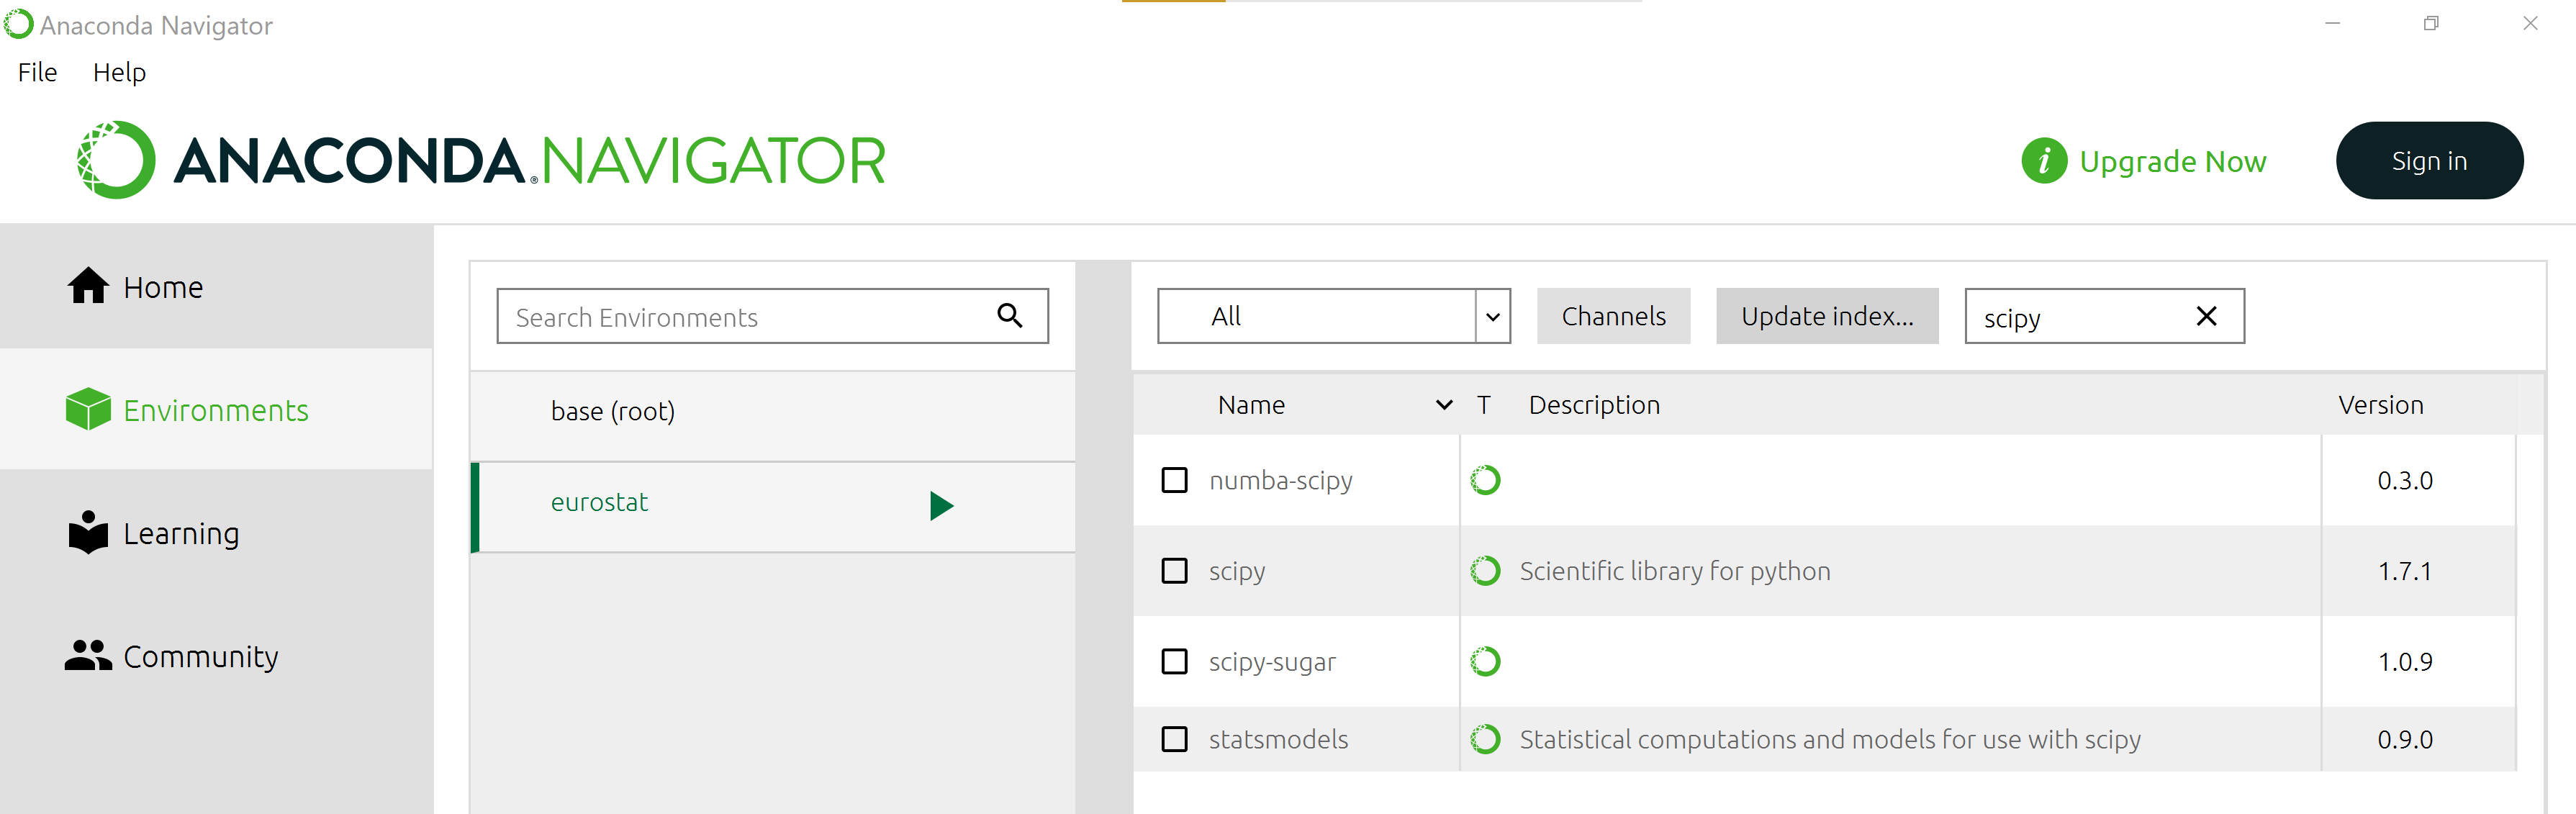

In [58]:
#@title Install SciPy
base64_data = "iVBORw0KGgoAAAANSUhEUgAADfsAAARrCAYAAACOz53xAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAALEoAACxKAXd6dE0AAP+lSURBVHhe7N0HXFV1H8fxH8OBG9TcCuLI1JxUWlmJ5ixz9VSWbW1n23ra67EytZ2oDcuRe2spVuYoUck9Ge4NKm4Fnvs//BkX7oTLHfB5133x//2Bc8+555wLeO/3/PzSTQQAAAAAAAAAAMBBa8dcpUeA82r2jNYjAACA4qdGjRp6BAAAAAAAAAB5+euPAAAAAAAAAAAAAAAAAAAAAAAAAADAQwj7AQAAAAAAAAAAAAAAAAAAAAAAAADgYX7pJnoMAAAAAAAAAAAAAAAAAAAAAAAAAAA8gM5+AAAAAAAAAAAAAAAAAAAAAAAAAAB4GGE/AAAAAAAAAAAAAAAAAAAAAAAAAAA8jLAfAAAAAAAAAAAAAAAAAAAAAAAAAAAeRtgPAAAAAAAAAAAAAAAAAAAAAAAAAAAPI+wHAAAAAAAAAAAAAAAAAAAAAAAAAICHEfYDAAAAAAAAAAAAAAAAAAAAAAAAAMDDCPsBAAAAAAAAAAAAAAAAAAAAAAAAAOBhhP0AAAAAAAAAAAAAAAAAAAAAAAAAAPAwv3QTPS4UPea1kQup53WVrW/4QHm82Su6AgAAAAAAAAAAAAAAAAAAAAAAAACg+HJZ2G/YuqEytPUwY9xv0Y0yretfxliZlTBRvtzwga7yqlMuTL6PnKcrAAAAAAAAAAAAAAAAAAAAAAAAAACKlwKH/f7z6y1y/PwRCavQSMbcMtOY6zS7qfFxTo/VUiawrDE+cGavDFzS1RjbsqTXZj0CAAAAAAAAAAAAAAAAAAAAAAAAAKB48Ncf8+WbTR8ZQT8lM+jXZc7Vxkfl9vnXyLzEKca4Ztk68sF13xhjW1RQ8PkVD+gKAAAAAAAAAAAAAAAAAAAAAAAAAICir8Cd/XLL7OqnlAksJ3N6/GOMNxyLcTrER5c/AAAAAAAAAAAAAAAAAAAAAAAAAEBxkK/OfirQpzr4zUqYqGeyqYDe01e/bowzg36Jp3bmq1tfzuAgAAAAAAAAAAAAAAAAAAAAAAAAAABFVb46++UO4dnrwFfQ0B4d/gAAAAAAAAAAAAAAAAAAAAAAAAAARZnDYT8V2Ft4W6yU8C9pNeyXOe9IOG/FwWh5a/UzurKPwB8AAAAAAAAAAAAAAAAAAAAAAAAAoKjy1x9t6jq3hfHx7KXTxseceoXdbXycvHOcTO/6l8OhvOtrRBpfu7jXJj1jW0G7AwIAAAAAAAAAAAAAAAAAAAAAAAAA4K3sdvZbd3SVvLzyEQn0D5QZ3VZKmcCy+jOu9dXG/8nM+J91ZVnrqu3k4/ZjdQXkR7LETpsqMUlqHCIR/ftJq2DjE3C7ZEmIjpbFcUkSEh4hkZGthF0BAAAAAAAAAAAAAAAAAAAAAACA4spu2M+djp47LHf/1lFXljnaOdBhybEybWqMGNkvwl/FgHeG/RKio2RxnC5MwjsPksgwXTgqIVqiMhcS3lkGOb0AN8u5vib52mYAAAAAAAAAAAAAAAAAAAAAAOB1oqKi9Ch/Bg0apEcoSo4fT5J//vlbOnXqJCVLltSzzrl48aIsWbJErr32OqlcOUTPFh3++qNNh88ekMF/9JFOs5sa9d2/RRrjqbt+MGpXqRpUTSZ3WaoryzLXwVWSE+N00E9JkrjEZD0GPCducbQk6DEAAAAAAAAAAAAAAAAAAAAAAADg61TQ78DBgzJv/nwjtOcs9T3qe9Uy1LKKIpthPxWsU7cBiztL3MntelbkPw0fliuCakj/Bg/oGdepUrqa9A0fqKvCliDrMlq8ZUmKWUfICl4gThZHF/EjMay1dA7PSFCHhEdIa7r6AQAAAAAAAAAAAAAAAAAAAABQpKgOfc7cULSpjn4hISGSlJTkdOAvM+invlctQy2rKLIZ9qtYMliPzN0Rdo9MvHWJrlzv8Wav6JFljyztpUcFlBAvcXqodnKGOIkn7QdvELdYinbeL1jCIvsZP4z7RbYyVb4pOSFWYqOnSVRRD2cCAAAAAAAAAAAAAAAAAAAAAAAUQMmSJaVnjx5OB/5yB/3UMtSyiiK/dBM9NnM57ZIE+pcwOvvltPC2WCnh754HI/d957Sk12Y9yr+E6ChZbKT9QiSic7jELY4Ro89feGcZFEmbsaIpWWKnTZWMho6m/d6/n7TygpRZzmMxPFwkLk53nAyJkP79HAzCJURLVMZCOIbdJTlWpk3leQMAAAAAAAAAAAAAAAAAAAAAULxFRUXpUf5kdvXLXA5d/oo2Z8J7xSnop1jt7Nd1bkvjo59f9pc0qtTUbUG/wpcg8Vlt/cIlNCxUwrOa+8WbPgt4RkjrSInIPBaTYiQ6NlkXAAAAAAAAAAAAAAAAAAAAAAAAgG9ztMNfcQv6KRbDft9u+tj4eOJCkiy+faMxVp30vr5pikzcUbCkrTPevfZLPcpr7JaRepQ/ybFrJTPrF95GdU4LltDstJ+sJWAFjwmWVpERkp33ixYORwAAAAAAAAAAAAAAAAAAAAAA4O1URz5nbii+7AX+imPQT7EY9psW96Pxsd+iG42PKuindJrdVG6p1d0Yu0P76rfoUV6Td47Vo/xIlsS4JD0Ol/phGaPg0PDsgFVcoumrAA8JbiVtwvVYkiQmOpbjEQAAAAAAAAAAAAAAAAAAAAAAAEWGtcBfcQ36KX7pJnqcRYX6lDciRshNNbsY48y5zOCfu2TeryX5XpfkWJk2NUaMuF94ZxkUqdN+kiyx06ZKjPGJEIno309aBRufsC7nskIipH8/1SXQNJ2cIOui10qc6aDKFBISLuFtWkurMHsLzZCcECuJ8XESl5xkOjj1pEnmckJNy3FsSUqyaXmJsm5tnCSbFpZjrUzLC3ZsecnJkpC4TtbGJRsnS7bsZdjdtkJ8vBT1mKltzLkc04IkPLyNtG4VZrov5/axa/eBdQnRUbLYaDWZc50SJDpqcXYHys6DJOtQtSQhWqIyFpLruLYsP9uWHDtNpmY8eKbd11/62T1BTKyuV87tC5fOgyLF9hp7yf7NuT022bl/V5xPZtub4zE0nU/R0abHNnOxpnNtkOlcAwAAAAAAAAAAAAAAAAAAAACgMERFRRkfBznZrS/39+V3OfBtucN9SnEM+ilWw35TuvwhIaWryoPRPeX7yHlZ80Uh7JczsJQ7QOV0mMlCeO1E9DRZnJWysSC8s/Q33anVJSdEy7TFcTkCeVbkCMvZkmxaXrQDy7MeJks2rVK07W3KFBIuEZGRNgJOhfB4KbnDTZaY1q1zZGvT/TkQBnPxPrDHctjPxCxYZicQl/NrbYX9CrJtOfefQwE9W+E7J8J+ju7ffqb960jYryCPgdk+scXa/bvwfLIU9rO0babtIOwHAAAAAAAAAAAAAAAAAAAAIL8yA1iuQpCr6CHsh4LKGfhTimPQT/HXH8381OlXI+jXdW4L2Xs6IStw99VNvxgffVuyJGaFbMKlfq50UXBouGTkP0WS4hJNX+2cE7GZwbUQCY+IkM6dO0vnCNMyMxeqxC2W6FjrS06IzxnUUV3LIiRCLaez6WN4jgUlxcjU6ARdWJYQPU2mmgV/MpZnrJdeXs5VyytBoqdNNQsmGV3PItT3q22LMC0v5zrFSczUaWJj88y44vEy1nGqeRAsJDxcP2adTduo96lp3RZHr7Mf8DJx5T4okLBI6Ryux6LWv+D3VaBtCw6V7C+Jk3h7q5OcmKO7XLiEWg2t2WAEDB3cv9PcsH8rtTbuN+tY1dMqUJc1b9zaWNjewj2fjMfKkRAjAAAAAAAAAAAAAAAAAAAAAAAAvI6fpc5+igr6XU67rKsM7u7qp7i8s5/d7mc5O2WpL7HW7U4z63SWIcS03EgLnehydg201cnM6PKWHC4RbVpLqzAL6SizzmLWu5eZ31+IaVsiTdtiKW2VLAmx6+REpUjT/ekpg/ljocJanSNN62xpEbm/1tr2ufzxyr2O1jrtqW2MlsXZK2hi/bFz1T5wlNXOfoacHfBsHJN2j+0MBd02s/1iq4Ogie1OmTm3ywX7N0+3PDfs35zHs53HIu+2uOB8Mvu6cAkPj5M402qbn1Pq2E+UsFZ09gMAAAAAAAAAAAAAAAAAAAAAFA46+6Egcnb1Ux39lMxxcevuZ7Gz39nLp/ME/YoK1dErU3jutn6GYGnVJquVmsTZbV2WS0iExeCaEtwqUiKymnbZ6IpmBJpU8M5iCihXt7ckiUu00PYrOVais1NFRljJctBPCZYw07qZB/1MEtaZh41M62R1Eepx69ffbPvWOtKOrKCPV851tBoEU9Q29svxuNnhin3gMmHSOvuBkLi1sVKgeyvgtgW3amM6GrS4eLF+hph30WxjMS1nhzP7N9LL92+hn0866KdClWbnlDr2CfoBAAAAAAAAAAAAAAAAAAAAAADvkzvop8J96qbGak59Tn1NcWEx7FcmsFyernmqnpc4RVe+KkGys37hYjHrp4TVdzDMlFuIRERaCyMpwRIanh3aSj5hObyjgjnWl5EhrL7tVFNyYlxGtzGTkIjIfHSdS5bYtTmCkZ0tdRXLLVhaRUaYHoUMSXGJdkJpBX28cq1jGwcet9bZ62eLK/aBK5kFH5NiJNqRIKUVBd+2MMn+tI3QanKiZGf96jtw/ORWlPavO84nk5AIicxPqBIAAAAAAAAAAAAAAAAAAAAAAMDNLAX9VBc/dSuugT+LYb9Os5vK+mMxRsCvSXAL6Vi7hzE/av07svzgEmPsaX6m/5yWEC/ZWT9b4SMHw0y5hYRLqJ2cTXCl7C9ISjqhRwWTdzku6KgmJ0zL1cOQCGntaFIrOFSy8nlJcWKzIVqBH698rGPO9XMhV+1L63IFv2KipQB5P6dY2racQThr3S9zBk4td9G0pyjtXzecTyaOBCIBAAAAAAAAAAAAAAAAAAAAAPA2UVFRxg3Fh7WgX6biGvizGPbrWre3vLDiAbltfoR80WGivNbmY7l1ztXG595e/azx0R02HV+nR3ndd+UTeuS4hOy2fnbDR2ZhprWx9jtqFZpkSU5IkISEWImNjpboadNk2jTTE9ji7G3JI2dHNdMBXUkPnZJ8Inubgys5ESAKlux8XpIUagYu3+vorHzsg8IQ3Eois9v7SUy0K47LfG6b3e6XOQKnzoTbcipK+9ct51OIhOTrZAcAAAAAAAAAAAAAAAAAAAAAAHAfe0G/TMUx8Gcx7Pdiq/eNj+cun5XpceMlPT1Nfrt9g3FzpyHL79OjvAY2djLslxwra3Nkd+IWZyR+rd5yBn0c6KjlWsmSEBst04x1mSpTFy+WxYtjJCYuTuJMB6bpf8flNyR1wnQ/ehjiZIKokukEcosCrKN9LtwHLhTcqk12yC4pRtY52nXSjCu2LUxaZwUPLXS/zBE4DQkPdfsxaJ+b969bzqecwUAAAAAAAAAAAAAAAAAAAAAAAHzHoEGDzG4ouhwN+mUqboE/i2G/nPqGD5TOc5pLp9lNZf2xGFnSa7P+jG9JTozLCts4L0ni3JX2S06Q6KipsjjGfH3VARkSEi7h4RES0bmzdM4KWsHlvHofhElk5xxdJxdHW+iqZ4MLty04NFyy4n650n4J62L08kMkPNTLEmicYwAAAAAAAAAAAAAAAAAAAAAAAG7nbNAvU3EK/FkN+5UtUV6uDG6uqwwvrXzYCP25g637aVTJ2XVIlsTMNmMmIeEq0OPILTvskxSXaFpKYUuW2OjFktlTMCQ8Qjr3z0gk9+vXz3SLlMjIVtIqLEzC3NjCKynphB455kRWW7QQcXlDNiucXUfrvHMfmAmLlOy8X5wsjnY07ufibQsOlaxTJC4+R+gwQeIz7yS8jbRywcNUlPavL5xPAAAAAAAAAAAAAAAAAAAAAADkR1RUlFM3FC9LliwxwnrOBP0y5Q78qWUVRVbDfrO7/y1fdpgsQ1c9qmfMFWbob3bCJD2y7OubpuiRg5ITJSvrFxIhkZEq0OPIrY1kZaqS4qTQm/slrJOYzPUM7yz9IltJWH7yRsGVJOvbzEJYTqgUktW1TZJPOBF0TJYTWV8cLIWah8vXOp4wndB6aImr9kEhC4vsnH1sxq2VWEc23uXbFiyh2Wk/yWrulxCfFaYLrx+mR/lQlPavL5xPAAAAAAAAAAAAAAAAAAAAAAAAhejaa6+TmjVqOB30y5QZ+FPLUMsqiqyG/TKtObJSj/J69q8BeuQ6F1LPyxcb3tdVXn6m/5yVsC5GMvM9IeGh2UE4u8KkdURmRCdJYtblKzbnsOTsVI+E2GnhlfNr86pk+n49zBnCckbOrm1JMeLwppsFK0NMa1KIcoYaHQ1j5giiWeK6fVDYwiQyq72f6diMjpXknIEyCwpj24JDw7PuM04faAmZbf1CIqR1AbJ+RWr/+sL5BAAAAAAAAAAAAAAAAAAAAABAPg0aNKhANxQPlSuHSPfu3fMV9MukvlctQy2rKLIb9nv32i8l0D9QV+Y2J/0rj/7eW1cFp4J+Pea10ZVli3tt0iNHJUhm9kgkRMJDnWuNlTPMlO8ueS6XIOuy2pNZEiyt2mT1fZO4xdH5WO+cXdtMy1gb60A3smSJjc4OVoa3aZUd1ioUYVI/u/WiA2FM0/qttRUFc4a9feAGYa0lO4saI9HrXLU+TmxbcCvJOtSM8yP7fHMuWGuJj+1fmx37fOF8AgAAAAAAAAAAAAAAAAAAAAAAgCfZDfvFHv1bZnRbIUt6bc66KZnjMbfMNOqCWrRnpt2g37XVbtIjJ+Ts9BUSLk5m/VTaL7sjV3675DkouFL2yiXFrJMES2mg5ASJnrbYZvcyQ84gmOmrF0+Ltrw8Q7IkxEZLbK5tC24VaRYmm2pvGdFTJSsfVdCubg4Kax2RI4y5WKZFJ1gOUZket9hpOdbPCpfug0IXLK0is7c/KS4uKxhmSWFtW1hWIs90fsRmnm/OB2st8fr9a9Z9MElO6KElvnA+AQAAAAAAAAAAAAAAAAAAAAAAwHMC3jbRY4uuqXajdJvbSsZv/zrrNvDKJ+We3zrJnwd+lYk7o+TrjcOM+bsbPSoBfgH6Ox3XaXZTWXloqa6s+7HTAj1yXMK6JRKvAzUhza6XNjWCMgqHBUnpCwmy5cA5o0r2C5E29XOEmM4fki1bDojx2aBa0vSqGqbvsOFEgqzNWqFw82UF+8mJtfE6zJQs8VsSJOHEBQnyOy8nTiTKunUrZMnyzZJ8LkQiImrKgQNWlmMIkhpXhZjuzrQ8tXLn1PLWytqEE3LiwknxO59jmUvWSrxpWUHhbcR8MXoZmeukl5FgWsbBC36mZZiWlXMZenXU+nTu115q6NKMKx8vJaiG1PDP3j/nkuNly9oE03pdEL9cj5v6kpCIztLsfLwxVttXq+lVYnZIuHQfOO5EQubjZ2GdbMm1/VksrU9hbVuO5SZnfk/4DdLzKnuPxwlJyFqfEAlvUz9v5zof2L8nE7bo+zMtL8G0bheCjHMjcd06ORRcP8f9F8L5JOfl0JbM+7fyGAIAAAAAAAAAAAAAAAAAAAAAAMAn2O3sp2R288vpyLmDsiXpXzl4Zp+eESMUmBHc+13PWKe+T32tujnC0jrYlyDxWe258t9pLDg0PEd3sbUSmxnCcbkwieyfo5OZJElSXIwsXrzYdIuRuDjV5su0HZ37SatKGV9hm2l5/fpLRHZrQtMi4yQuJvcybTEtY5D5MpKMZajvz7uMkPDO0r9fpOm73Ce4VT/pn93G0CTJtE55tzEkor/0s/vAuXofFD6zjnE2Fda2hUlWcz8tvL7rjgDv3r/m3RVVd7/McyMmztIThfefTwAAAAAAAAAAAAAAAAAAAAAAAPAMh8J+yvhOi/TIvjf/eSoryGftdt+SLvqr7ctf0E8kOXatZGf9wiWfWT+V9pPsbE6SxCUWWtpPJZuk36D+0tl0hyE5801iqlXwp38/iXQq+aPCSP1kUP/ORsDIfJmmpZomwiPUcgfZWG7GMvpbWYaaCI+IkM6mZfQzLcQTncVUICxrG/VcBvW46XVr5eCauXwfFDbT/mmTK21nTSFtW1jrnAG6cHFh1s/g1ftXLc+0buG5ToyQkGCxnBf0/vMJAAAAAAAAAAAAAAAAAAAAAAAA7ueXbqLHdu1OiZOHl95uhO9UYM8d8hv0A1AcJUh01GId8g2XzoPoigcAAAAAAAAAAAAAAAAAAAAAAADf4HBnP6Ve+XBZdNu/uip8BP0AOCX5hGT13QwJsdJZDwAAAAAAAAAAAAAAAAAAAAAAAPA+ToX9lED/EsbHx5u9YnwsDK2qXkfQD4DTkhPjJEmPQ8JDJViPAQAAAAAAAAAAAAAAAAAAAAAAAG/nl26ix/lyx4Lr5PSlFF0VHCE/APmSHCvTpsbosF+IRPTvJ61I+wEAAAAAAAAAAAAAAAAAAAAAAMBHFDjsl+m55QNl4/G1unJO3fL15buOc3UFAFpyrERHJ0n9yNYSFmw9uZecEC3Ri7O7+kl4ZxkUGaYLAAAAAAAAAAAAAAAAAAAAAAAAwPu5LOyX04Qd38r3W7/QlWX9wu+Xx5q9rCsAsMCsW59ISEi4BAeHSP36leTEiXhJSkqW5Lik7JCfEhIh/fu1Epr6AQAAAAAAAAAAAAAAAAAAAAAAwJcUStgPAFwiV9jPnpDwzhIZGUbQDwAAAAAAAAAAAAAAAAAAAAAAAD6HsB8AL5csyQmJsi4+TpKTkyTJvI2fhIQES3B4fWndipAfAAAAAAAAAAAAAAAAAAAAAAAAfBdhPwAAAAAAAAAAAAAAAAAAAAAAAAAAPMxffwQAAAAAAAAAAAAAAAAAAAAAAAAAAB5C2A8AAAAAAAAAAAAAAAAAAAAAAAAAAA8j7AcAAAAAAAAAAAAAAAAAAAAAAAAAgIcR9gMAAAAAAAAAAAAAAAAAAAAAAAAAwMMI+wEAAAAAAAAAAAAAAAAAAAAAAAAA4GGE/QAAAAAAAAAAAAAAAAAAAAAAAAAA8DDCfgAAAAAAAAAAAAAAAAAAAAAAAAAAeBhhPwAAAAAAAAAAAAAAAAAAAAAAAAAAPIywHwAAAAAAAAAAAAAAAAAAAAAAAAAAHkbYDwAAAAAAAAAAAAAAAAAAAAAAAAAADyPsBwAAAAAAAAAAAAAAAAAAAAAAAACAhxH2AwAAAAAAAAAAAAAAAAAAAAAAAADAwwj7AQAAAAAAAAAAAAAAAAAAAAAAAADgYYT9AAAAAAAAAAAAAAAAAAAAAAAAAADwMMJ+AAAAAAAAAAAAAAAAAAAAAAAAAAB4GGE/AAAAAAAAAAAAAAAAAAAAAAAAAAA8jLAfAAAAAAAAAAAAAAAAAAAAAAAAAAAeRtgPAAAAAAAAAAAAAAAAAAAAAAAAAAAPI+wHAAAAAAAAAAAAAAAAAAAAAAAAAICHEfYDAAAAAAAAAAAAAAAAAAAAAAAAAMDDCPsBAAAAAAAAAAAAAAAAAAAAAAAAAOBhhP0AAAAAAAAAAAAAAAAAAAAAAAAAAPAwwn4AAAAAAAAAAAAAAAAAAAAAAAAAAHgYYT8AAAAAAAAAAAAAAAAAAAAAAAAAADyMsB8AAAAAAAAAAAAAAAAAAAAAAAAAAB5G2A8AAAAAAAAAAAAAAAAAAAAAAAAAAA8j7AcAAAAAAAAAAAAAAAAAAAAAAAAAgIcR9gMAAAAAAAAAAAAAAAAAAAAAAAAAwMOKbthv1yhp7+cnfn7tZdQuPYeih/0MAAAAAAAAAAAAAAAAAAAAAAAAoAigsx8AAAAAAAAAAAAAAAAAAAAAAAAAAB7ms2G/hYNVNzfTbfBCPQMAAAAAAAAAAAAAAAAAAAAAAAAAgG9yb9hv4eCMgJ7Tt8FiFunbNUrei9LjqPdk1C49RgHtklHt9WOerxBlQb8fAAAAAAAAAAAAAAAAAAAAAAAAAIonn+3sBwAAAAAAAAAAAAAAAAAAAAAAAABAUeGhsF87GbkzXdLTHb2Nlm76Ow0Nhsgbg/R40BsypIEeAwAAAAAAAAAAAAAAAAAAAAAAAADgg3y2s1+30ToIONosBggAAAAAAAAAAAAAAAAAAAAAAAAAgM/x2bAfAAAAAAAAAAAAAAAAAAAAAAAAAABFBWE/AAAAAAAAAAAAAAAAAAAAAAAAAAA8zGfDfgsH+4mfn+k2eKGecYVdMqq9Xq7ZbbC48l5gLmtfmt3ay6hd+gtcZdcoaZ/nfnLe2M8AAAAAAAAAAAAAAAAAAAAAAAAAPIPOflpG4KyhPLdKT5iJku4qDObSYCF2jWpvhOy6R+kJM6vkuYamx7z9KCl45m+hDFb7r+FzpqXaovczoT8AAAAAAAAAAAAAAAAAAAAAAAAAbkbYT3fzywqcDVog6enpZrcFg/TnoroT+HMRFa5smJmsbDdSduZ6zHeObJfxuVXPSUOXBP4yDFpgfj85b1n3qUN/7GoAAAAAAAAAAAAAAAAAAAAAAAAA7lLsw367Rg3M6uZnBMFGd8socug2OkcQLKo7IbCCWjg4K1zZbuROSV85RBpklFkaDFkp6Zkpy1XPycBRror7WWfcZ/pOyd7V7cUNdwsAAAAAAAAAAAAAAAAAAAAAAAAAxTzst2uUDNRJPxU6s5Dzy9JgyPjsENh7rus0V/wslMGZSb9BC2TlkNwxvxy6jc7qqrjquU9M3+kODWTIygWScber5LlPSHYCAAAAAAAAAAAAAAAAAAAAAAAAKHweCvutkuca+omfnwO3Qmyjt2veFNOamLQbKeNthc4MDWTIG5nJsykyr6in/aK6W94fNm8Ns7okWrVwlmRE/QbJAlvpSq3bSyMlI2MZJbPclrvrJqMzU4ZR79HdDwAAAAAAAAAAAAAAAAAAAAAAAEChK8ad/XbJvCm6q9+dPcVe1M/QsIkOnq2SrTuNAZy0cFZmV787xH7Uz6RBY2muhxu3uzF11+2OrO5+U4p8shMAAAAAAAAAAAAAAAAAAAAAAACAp3ko7NdORu5Ml/R0B24OdH/Ln52yVXeha97Yoaif54JnnjBogeX9YfO2U0ZmpCGt2CXbN2aM2jVpmDGwq6E00ctc5daEpafuFwAAAAAAAAAAAAAAAAAAAAAAAEBxVHw7++3aLjp3JlHd/cTPz5Fbd9F96ZAv2QHLVc81tPD4Wro1lOf097hXA2mcnewUevsBAAAAAAAAAAAAAAAAAAAAAAAAKEzFN+wHAAAAAAAAAAAAAAAAAAAAAAAAAICXIOxnMmhBuqSnO3dbOaSB/m7kR7uROy0+rjZvo7vp7wYAAAAAAAAAAAAAAAAAAAAAAACAoqX4hv0aNJbmegh3aShN2umhL2neWIh2AgAAAAAAAAAAAAAAAAAAAAAAAChMxbizX3bwLGrWwowBClkDaawTlqumzJNdGUMvtVBmRWWM2jVpmDEAAAAAAAAAAAAAAAAAAAAAAAAAgEJSjMN+2cEziZolxP3co2FmwnLVFJnnzWm/hbMkI+vXTu7sSV8/AAAAAAAAAAAAAAAAAAAAAAAAAIWrGIf9RLq9NFIyomdR8t4o7+4zV1Q0GPKGDDJGq+S5T7w1YrlLRr2X2dbvTiHrBwAAAAAAAAAAAAAAAAAAAAAAAKCwFYOw3yrZulMPc2swRN7ISJ7JqucaymDa+7lBN3lppO7uF9Vd2rssZGljP+cQNcv+Tt41aqA8typjPOiNIULWDwAAAAAAAAAAAAAAAAAAAAAAAEBhK7phvwY95c6sTFl7sZYp6zZ6p2Rnz/zEr/0osRY/2zWqvc3PwzENhqyUBTlCln5+g8VqBG/hYNufd3A/Z4nqblqen5WQ4UIZbPpcQ530azdyp4zuZgwBAAAAAAAAAAAAAAAAAAAAAAAAoFAV4c5+DWRIZts+WSXPNbQW5DN93cr0rPCZrHpOGvqZvtbCzQiBrdoqDjSQgx3dRqfLzsyUpURJdwuPt3HrHmX6/EbZbjXE5+h+NpcRMsx1X37dTWuSYdCCdFk5hJ5+AAAAAAAAAAAAAAAAAAAAAAAAANyjCIf9TLqNlvT0BZIZBZPmjcVafEuFz9LTc4T+LFCd3tLTRwvN3lxDdfhTj3l26M+CQQtMX7NSbObunNjPKsRn6z4z9nE6Hf0AAAAAAAAAAAAAAAAAAAAAAAAAuJVfuko2AUXaQhmsu/apsB9BPgAAAAAAAAAAAAAAAAAAAAAAAADepmh39gMAAAAAAAAAAAAAAAAAAAAAAAAAwAcQ9gMAAAAAAAAAAAAAAAAAAAAAAAAAwMMI+wEAAAAAAAAAAAAAAAAAAAAAAAAA4GGE/QAAAAAAAAAAAAAAAAAAAAAAAAAA8DDCfgAAAAAAAAAAAAAAAAAAAAAAAAAAeBhhPwAAAAAAAAAAAAAAAAAAAAAAAAAAPMwv3USPAQAAAAAAAAAAAAAAAAAAAAAAAACAB9DZDwAAAAAAAAAAAAAAAAAAAAAAAAAADyPsBwAAAAAAAAAAAAAAAAAAAAAAAACAhxH2AwAAAAAAAAAAAAAAAAAAAAAAAADAwwj7AQAAAAAAAAAAAAAAAAAAAAAAAADgYYT9AAAAAAAAAAAAAAAAAAAAAAAAAADwMMJ+AAAAAAAAAAAAAAAAAAAAAAAAAAB4GGE/AAAAAAAAAAAAAAAAAAAAAAAAAAA8jLAfAAAAAAAAAAAAAAAAAAAAAAAAAAAeRtgPAAAAAAAAAAAAAAAAAAAAAAAAAAAPI+wHAAAAAAAAAAAAAAAAAAAAAAAAAICHEfYDAAAAAAAAAAAAAAAAAAAAAAAAAMDDCPsBAAAAAAAAAAAAAAAAAAAAAAAAAOBhhP0AAAAAAAAAAAAAAAAAAAAAAAAAAPAwwn4AAAAAAAAAAAAAAAAAAAAAAAAAAHgYYT8AAAAAAAAAAAAAAAAAAAAAAAAAADyMsB8AAAAAAAAAAAAAAAAAAAAAAAAAAB5G2A8AAAAAAAAAAAAAAAAAAAAAAAAAAA8j7AcAAAAAAAAAAAAAAAAAAAAAAAAAgIcR9gMAAAAAAAAAAAAAAAAAAAAAAAAAwMMI+wEAAAAAAAAAAAAAAAAAAAAAAAAA4GGE/QAAAAAAAAAAAAAAAAAAAAAAAAAA8DDCfgAAAAAAAAAAAAAAAAAAAAAAAAAAeBhhPwAAAAAAAAAAAAAAAAAAAAAAAAAAPIywHwAAAAAAAAAAAAAAAAAAAAAAAAAAHkbYDwAAAAAAAAAAAAAAAAAAAAAAAAAADyPsBwAAAAAAAAAAAAAAAAAAAAAAAACAhxH2AwAAAAAAAAAAAAAAAAAAAAAAAADAwwj7AQAAAAAAAAAAAAAAAAAAAAAAAADgYYT9AAAAAAAAAAAAAAAAAAAAAAAAAADwMMJ+AAAAAAAAAAAAAAAAAAAAAAAAAAB4GGE/AAAAAAAAAAAAAAAAAAAAAAAAAAA8jLAfAAAAAAAAAAAAAAAAAAAAAAAAAAAeRtgPAAAAAAAAAAAAAAAAAAAAAAAAAAAPI+wHAAAAAAAAAAAAAAAAAAAAAAAAAICHEfYDAAAAAAAAAAAAAAAAAAAAAAAAAMDDCPsBAAAAAAAAAAAAAAAAAAAAAAAAAOBhhP0AAAAAAAAAAAAAAAAAAAAAAAAAAPAwwn4AAAAAAAAAAAAAAAAAAAAAAAAAAHgYYT8AAAAAAAAAAAAAAAAAAAAAAAAAADyMsB8AAAAAAAAAAAAAAAAAAAAAAAAAAB5G2A8AAAAAAAAAAAAAAAAAAAAAAAAAAA8j7AcAAAAAAAAAAAAAAAAAAAAAAAAAgIcR9gMAAAAAAAAAAAAAAAAAAAAAAAAAwMMI+wEAAAAAAAAAAAAAAAAAAAAAAAAA4GGE/QAAAAAAAAAAAAAAAAAAAAAAAAAA8DDCfgAAAAAAAAAAAAAAAAAAAAAAAAAAeJhfuokeA25xPvW8nLt8Rs6q26WMj35+fhIUWFbK5LiVCiilvwMAAAAAAAAAAAAAAAAAAAAAAAAAijbCfnCb1PRU+WrjJzIt7mc9Y1sJ/xJSs2wdqVsuTOqWDzXdTB9N4wYVryQICAAAAAAAAAAAAAAAAAAAAAAAAKBIIewHt1t2YIkMW/eGnL6Uomeco0KAV4W0kNZVr5E2Va+Vq4JbSKB/oP4sAAAAAAAAAAAAAAAAAAAAAACA89LS0mT3vn2yMz5BdpluOxMSJGHPXjmVkiKnz5wx3c7KmbNn5Izp48VLl/R3AYWjZIkSUrZsGSlbpqyUM30sV7asVChfXsLq1pGGYWHSsH59aVA/VOrVri3+/v76u+DrCPsh3y6kXjDdzkmFkpX0jOMOnd0vb69+SbYkb9Az+Vc6IEiuqdZebq1zu7Sr3sEIAwIAAAAAAAAAAAAAAAAAAAAAANhy7vx5+XvtOvlr1d+y7O9/ZP2mzXLh4kX9WcA3lCpZUlo0ayodrrtWbmx3nVzXprUElS6tPwtfQ9gPTtt/Zq/MSvhFlh9YKuM6TpUygWX1ZzJE71soqw+vkGdbvJrnczldTrssI9e/L3MTp+mZgqtQsqJ0rNVVutS9XZqGtNCzAAAAAAAAAAAAAAAAAAAAAAAAIgcPH5Eps+fIwuilsnb9BsJ9KHJU+K9Ni6ulW2RHubPX7VKj2hX6M/AFhP3gkLT0NPn78F8yM36SEeRLN/336FXPyn2NH9VfkeFS2iW5d3FPOXh2v9QsW1veaPuR3dDdT9vHyNgtnxvLdKWGlZrIwMaDpEPNTuJn+g8AAAAAAAAAAAAAAAAAAAAAABQ/Z8+ek9mLfpXJM2cZHfxSU1P1Z4CiLSAgwOj4d1fvO6RX1y5SpkyQ/gy8FWE/2KU69Y3Z8pkcOLNPz6gOepVkSpdf83Tum7JrvHy58WNdifj7+ct9jQfJA1c+LgF+AXo2r8V758mwdW8YYUFXCy0fboQSI2t3N9YHAAAAAAAAAAAAAAAAAAAAAAAUffsOHJCR346RCTNmGIE/oDhTQb8BffrIc489KrVr1tSz8DaE/WDVzhNb5bMNw2TD8bV6JtsjVz1jdM3L6fSlFLnrt65y6uJJPZOtVZUIefua4RJcqrKeySv2WIy89vfTcubSaT3jWrXK1pWnmr8k19e4Rc8AAAAAAAAAAAAAAAAAAAAAAICiJn73bhn+1bfyy6zZcunyZT0LQClZooTc2et2efHJx6R+vXp6Ft6CsB/yOHEh2ejkN3/3DElLT9Oz2Ur4l5DpXZdKpVLBeiaD+p6fto/RVV5VSl8h7147QpqFtNQzee08uU1eXDFIki8k6RnXu776zfJsi1eleplaegYAAAAAAAAAAAAAAAAAAAAAAPi6/YcOyVsfDZfp8+ZLamqqngVgSUBAgPTt2UPeeeVFqVW9up6FpxH2g5mTF5NlxL/vy5ojqyTl0ik9a65TnR7yZtuPdJVBdePrt6iTnLlsuytfoH+gPNX8ZelT/x49k9ee04ny0NK+cjH1gp5xvdIBpeW+xoPlroYPGOFFAAAAAAAAAAAAAAAAAAAAAADgmy6npsqXY7+Tj774Ss6cPatnATiibJkyMvSZp+TJhx+UwIAAPQtPIewHq/af2SNbkzZK7LEYI/x38Ox+Y/6rDj9J88qtjHGmCTvGyejNI3VlW/d6vWVo6/d0ZS7d9N/w2HdkbuI0PVO4GlRsLO9eM0Jql6PtKAAAAAAAAAAAAAAAAAAAAAAAvmbF6hh5/o23ZevOnXoGQH40adhQRrz3tlx/TYSegScQ9oPDDpzZJ5uT/pXOdXrqmQyX0i5K/19vlaTzx/SMdddXv1k+uO5z8ffz1zPZ3B30y1QmsKy83Ood6Vi7q54BAAAAAAAAAAAAAAAAAAAAAADe7OKlS/La+x/KmJ8nCtEYwDX8/Pzk0XvvkQ9ff01KliihZ+FOhP1QYCqc90ns27qyTnUDHHH9WCkVUErPmPt8w/9kWtwEXblfr7A75Zmrh0oJ/5J6BgAAAAAAAAAAAAAAAAAAAAAAeJvEPXvlvqeekfWbNusZAK7UslkzGf/lZxJat46egbsQ9ivm0tLTLHbZc8bZy2dk0Z7ZMiN+kuxJSdCz5sIqNJAvO4yX8iUq6Blz47Z+KT9u+1ZXntMkuLl83P5rqVgyWM8AAAAAAAAAAAAAAAAAAAAAAABvMWvhInlq6H/lVEqKngFQGCqULy9fffSh9OraRc/AHQj7FXPzd8+QqM2fSYOKjc1u9cqH5ysEuObIKpkeP1FWHfrTCBIqIaWryOibJkm1MjWMOrdfdv0oX238RFeeV6dcqHx6fZRUL1NTzwAAAAAAAAAAAAAAAAAAAAAAAE9786NP5LOosUIUBnAPPz8/eXbQI/LuKy/pGRQ2wn7F3NRdP8kXGz/SVTbVga9FlbbSuuq1pts1Rmc+P9N/jjp0dr/Miv9FFu+bLx9c+5lcGdxMf8acCht+tO5NXXmPKqWvkE+vH23a7oZ6BgAAAAAAAAAAAAAAAAAAAAAAeIKKvjz20isyacYsPQPAne7p21u++XiYEf5D4SLsV4ycTz0vpQNK6yrD+O2jZeyWL3Rlnep2N6HzPF25xu/7f5V3Yl7K6gDobVTg8eP230jTkBZ6BgAAAAAAAAAAAAAAAAAAAAAAuJOKvbzy3gfy7Q/j9QwAT3j8wftl2OuvEfgrZP76I4q43SnxMnbL57rKdvbSGT2y7aqQ5nqU7VLaRUk3/Zcfu05ul/fXDPXaoJ+ScumUvLTyMUk4tVPPAAAAAAAAAAAAAAAAAAAAAAAAd1FBvydeeY2gH+AFvvn+R+N8pO9c4aKzXzFw/PxRefzPAdK8cmt5o+0wPZth5Pr3ZWb8ZF1Z98F1n8mNNSJ1lWF63ATT906SO+rfLd3q9ZKygeX0Z+xbsm+BJJ0/JqUDg6R0QJBxol9IPSfn1O3yWTl89qDsO7NH9p3ebay/J1UNukK+7jBBqpWpoWcAAAAAAAAAAAAAAAAAAAAAAEBhUjmDJ195TX6eNl3PAPAG9/bvK18N+5AOf4WEsF8Rp4JzT/11v+w8sVU61u4qb0cM15/JMGzdG7Jg90xdWabCeHN7LJdSAaX0TAbV9e6fw8uNcVBgGbm1Tk/pU/8eCavQwJhzFdVh799jMbLu6GrT7R9JOLVLf8Z96pYPk687/CQVSlbSMwAAAAAAAAAAAAAAAAAAAAAAoDCoqMvQ9z6Qb+joB3ilxx8YKMPe+C+Bv0Lgrz+iCEpNT5U3Vz9vBP2Uy2mXjY85BfgF6JF1ba64Lk/Q73zqeYk9FqOrjFDh7IQp8nHsW7InJUHPukb5EhWMroLPXv2q/Bg5SyZ2ni8PXPm41CxbW39F4VPb9MqqJ+VS2kU9AwAAAAAAAAAAAAAAAAAAAAAACsNjL71C0A/wYur8fPzlobqCKxH2K8KGx76T1XlPUeG/3AL9A/XIulZVIvQom+qwdzH1gjFWy+hUu7uMvnmSfHPTBKMLXmGqXa6ePNTkSZl86yIZdcM4aVP1Ov2ZwrU5ab18tdG8MyIAAAAAAAAAAAAAAAAAAAAAAHCdNz/6RCbNmKUrAN5q4vSZxvkK1yLsV0Qt2jNH5u+eoasMqRY6+wX6l9Aj6yyF/f4+tEz8TP91rN1Vfu40T96M+FiaBDfXn3Wf1lWvlZE3jDVChtdWu0HPFp4Z8RPlzwOLdQUAAAAAAAAAAAAAAAAAAAAAAFxl1sJF8lnUWF0B8HbqfJ296FddwRX80k30GEXEsfNHZOCSXnL6UoqeydD2inYy4voxusrwzaZPZdLO73WVV/kSFWRuj+Xi72eeC/1w7X+ld/27PBLws2XFwd/lsw3/k0NnD+gZ1ytbopx813G61ChTS88ULxcvXZJDR49KcMWKUr5sWT3refsPHZbLqalSulRJqValip5FQal9rVSvWtX4WFQdP3FCjh5PktNnz8rpM2dF/WgsExQkZcsESYjpWK9xRVXx8/PTX+3b1LZlbqe/v5+UM53HZU3b6s2ST52SUymnjXHNaldIiUD7XWmB4mbCjm9lZvwEuZR2yahfbPme3FizszH2Vumm/46dOyKp6RkXpFAXkqgaVM30e2eAUXuDpfsWyLebPpKLaRekddV28t+2wyXAi9avKEq+cFwupJ7XlUhQQJBULBWiK++RdP6obE76V/aeTjDdEuXg2b3G31/nLp8x3Uw/Y01/P5UOKCOlA4OkUslgqVm2rulWR8IqNJSmIa2lXInyekm+54xpO99Y/bTEndxm/L34UqsPpIWFC8S4wtnLp+XUxZO68i5lAstKhZKVdFV4Dp3dL1uT18u+07tNt0RTvc+0D06bHhvTsZZ6Vkr4lzTWRd1CSleROuXCpHbZUKlfsbE0qtTU656zUtNTTc/9h42fAYVB/SypZHrOKBVQWs8AAAAAAAAAAAAgPy6nXTZe/1SCAstKoD/v1wEAuEfCnj1y42295VSKeRYCgHerUL68LJ87S0Lr1tEzKAjCfkXQK6uekFWHlukqm+rQ99mN5sG+NUdWyeak9VI6oLSUCgzK+Gi6qTfVqlq9MTWsQgP91b7hfOp5+WHr1zJ51w+Slp6mZ13ryuBm8nWHn4vdH7CHjx2Ta3v/Rw4eOSpBpUvJnDHfSIdr2urPekZaWpp0uf8RWbZ6jVEHBPjLpM8+lV6dI43aW1y4eNEIJNp6yi1VsqTUrlFdV543+LW35IfpM43xY/f8Rz5767/G2Nep4/iPv2NMx0yMbNqxU3bEJ0rSSdtvIlf7pl6tmtKkQbi0b91Srm/bRlo3vco43rxVamqarNu8RZbHrJEtu+JkR0Ki7EzYbWxr7uNQbUfVkMrSKCxUGtcPlWaNG8lNpnNbba+njZsyXZ5++z1jexR1bqtz3Nse+30HDxnnuTUqLKrO75Il7HfUzUkFM48cO27zuSM/1HqULVvGCG0X9fDkf4ePMp3zq6VSxQry2ZuvSYN6dfVnio4j5w7KPb910lWG0qbf5b7sMElCKzTUM95FvSjwwooHTL+HxuqZDLXK1pPPb/zZK8JdKkhz92+RRrAp05sRI6VDzVt15RpxJ7fLuzFD5Pj5jIB9pmurdZDX2w43PX/4VjN2FZD8etP/5Pzlc3pGpERASekXPlAGNHpMz1g24t+3ZMHuabrK1r/BAzK46Uu68ox0098VG46vlb8O/Cbrjv0te1Li9Wecp8JIKoil9nHHWt299jy15rutn8nEHVG6EiNQ9tVNvxjb5UrR++bJR+teM/1Nl6pnvM/9Vz4l9zV+XFeuoZ4f1x5dKSsORkus6Vg7eGaf/ozzVADw6iptJeKKG+Wmml2MEJwnqZDsU8vuNn5uFbYygeWkcumqUq1MTWl7xfXSrvrNxs8YAAAAAAAAAAAAZFMXaIw/uV3WH4+RxFO7jItP7juzW05dTDZet8pJvVeyQslgqV22ntQuFyqhFRpIi8rXSP2KjVz+WiEAoPhSTWki+94p6zdt1jMAfEnLZs1kyfRfnH6/NPIi7FfELNoz2+i6l1NwqcrSskpbubnWrXJLrS56tuhTQcb31rwiyReS9IxrPdHsRbmr4QO6Kh5UYGL4mO90JdKmWVNZOX2SrjxjW1y8tOh+h64yqB8Os0Z/KZHXt9MznqXCZe373WOEgezp2/VWmfjZcF15jnpcW/bonRUwUkGlNXOmSbNGvvVm9EwqoDpxzjyZNGe+bNy+Q88WTNWQYOndpbP8p2d3uaFtaz3rWSpsNv/3P2Xy3AXyx9//yEndDS+/VJfMzje0k3tu7ym3tLtW/P3dHzi58c4Bsnr9Rl1luK/37TLmf+95TbfFJ998V8b+kjecklt4vbqy7JefpUqwY12A1m/dJl0GPmJ0NixMlSqUl4ah9aRx/TC5+srG0uGaCGnRpLFH9rerRa9YJd0fGqwrMbZt8U/jdFV0rDu6Sl5e+YiusqkuYl/dNMXovOVttiVvlKeW3aUrc0NavCU9Q+/UledMjxsv32z6SFcZrgppKZ/fOEFXrqHuQ92XJR9c97VcW+0mXXk/1ZFPBU9PXkzWM9lU97GFt5mHO3NS39N34Q26MqdeGJp/21op6V9Kz7jP0XOHZU7CJCN4VlgBJRX26x02QDrXvd0j2+iM86nn5O5fO0rKJfOfTSNu+FGuruzai4AMWX6fbDq+TlfeSV0oZ37PtboqGNUlcrbpWPt9/0I5WQh/w6quqRFX3CDd6vWR66t39EiQ+IdtX8jP27/Vlfuprodd6vaWO+rfY4TiAQAAAAAAAAAAiiMV4lt95C/5fd8C4/0Gll7fdUbFksHSumo7uaV2d7nmihvpAAgAKJAX33pHon5y7fuzALjXoPsGyPB33tIV8ouwXxFy9NwRuT+6l5TwLyEtq0QYt9ZVr5F65evrryh+VIeUt1a/aHThcLWgwDLyc6d5UjXoCj1TtKWcOSPhN3XOEx5a9MMYIwTkKZt37pLWPfvoKlvZoCBZ8H2UXNeqhZ7xHBUye/Cl13Rl3/lt6z0eYsrZ1S+TCnx9/8mHuvINq2L/lY9Hj5NFf/5ldIEsLC2aXCkvPPKg9OvWxSMd5/YeOCifjvtBJpmOtROnCqdtec1qV8gDfXvLU/cPkMqVHAuruUK7PncZHQpze3LgABnx31d05VllrmqZ1XnQHnUOqXPJEa989KmM+u5HXblXSMWKcmuH64117XR9e6/uYmlLtwcHydKVf+sqw4ppE6Vt82a6Khqshf0UFexQgTEV8vAmKsCjgjyWPN7sFekbPlBXnpGanioDl3SVw2cP6JlsKuynQn+u8vv+BfLBGstd61pVvU4+ae87AVXVlU9157OkffVb5N1rv9RVXipUd/dvHXWV19weMcbv3+5y6Ow+mbRzrPy6Z2aeK1YWFnWRlv4NHpTe9QcY4UhvpMJoX2x4X1fZ2lfvaNq/X+jKNZ5edrdsTd6gK++knlt/u71g65hwaodM2BElf+5fZFw51R3qlQ+XAY0Gy021ukqAG38+PL/iAdlwLEZXnqPOtQGNH5Me9fp57bkGAAAAAAAAAADgauo12WlxP8iSvXMLHPCzRgX/OtW5TfqFPyBVg6rpWQAAHLNidYx0v/verEYlAHyTykEsnDxB2ke49uLxxY3vt2xBlhMXk+SrDj/J7O7L5J1rPpXe9e8q1kE/pXLpqjLyhjFyU83OesZ1zl0+K19t+lhXRd93U6Zb7BL2cZR3vgH9zLlz0mvQE7Jh23Y94zmXL6fqkWM8HfQ7dDSjC15uU+YvlD0H8oYevNHKdbHS6d4H5ea7BsqC3/8s1KCfojqwDXzhFWl9Wx/5fdU/erbwqZDfY/99W5p07iHf/Dyp0IJ+yoHDR+TDr0dLw5u7GCG04ydO6M94xlfjJ8g7n32lK89yNOinOPN8cPmye8IlliSdPGl0iLz90ScktEOk8Vh7ep87698t2/IE/ZQRY3/Qo+Ih5shy+X6rawM4xcHyA4stBv0Ua1348uvGGrdafZEj9ujfEnfS87/LOCI9PU2mxVkPKKsQmy9Q3QnHbRklD0T3kPmJU90W9FOSLxyXqM3D5aGlt8mKg9F61nukpaeajn/L+3jVod9l/5nduoIjTl08YYRjH/29t/yxf6Hbgn7K7pQ4+XDty/LEn/1lS9K/erb4UOfalxs+MB579VgAAAAAAAAAAAAUZUfOHTRel7pvSRfj9e7CCvopatnqPtR9jVz/tnHfAAA44nJqqjz/xtsE/YAiQJ3H6nxW5zXyj7BfEdKw4pUSVqGBrpBJXalfhR9vD7tTz7jO0n2LZN1R9wV7POXS5cvy+Y8/68qcClJY6rrlDVTwqftDg2XX7j16Bo744scJcvHSJV1lUz9wR4zzTJcxRx1NSpZHX31DOt7zgPwV4/qOnvZsi4uXrg88Kvc8+6IknzqlZ11PnZMfjx4rV3fvJd9Pm2HU7qKCtKrbXPMut8u4KdM9+oeVCh96qvNdcXLk2HHjsW50S1d59ZMRFoPf3ujTsd/pkblZi5dIwt59uioeJu0cI38e+FVXsEcFbqbGWQ+FLju4WA6d3a+rggv0D5Q7wgboKi9r4SpvE3NkhexJideVucaVmkmzyq115b3WHFkpDy+93Thn3Bnyy+3gmX3y1upn5KN1rxkXGPEWKw/9LgfO7NWVOXXezIj7SVeuUSKglB55L9VV31nqsVq8d44RKFXdMD1JhYmf+WuA8eLu2ctn9Gzxse90ojy17C5ZfnCJngEAAAAAAAAAACg6Lqddkgk7RsuD0T2N16VU7S7qvtTFVdV9q3Vw530DAHzTl2O/k607d+oKgK/bsmOHfDXue10hPwj7FSPqzXu7c70Bd+fJbTJs3Rvy1uoX5OWVj8tTy+6XR36/U+5d3FN+31903hTu7+cvL7Z80+h26GqfbxhmvGGzKFMd3fYdPKSrvIZHWQ5UeIOjx5OM8JWt9Ue2lDNnZMzkKbrK68fpM+VYsnd295q39A9p0a2XjJ8x2+NX9pi+6De5rvd/JHbzVj3jOhu375CIXv3ljRGfy9lz5/Ws+6kub0+88Y4RrPRkx0fVZfC7qTN0hcJ0+uxZoyte8663W+z+6U127z9gnIeWqE6Mo753bWc2X/Dxutck4dQOXcGWzcdjZVvyRl3lpTrYzYy3fBGE/Ooe2l9KBwTpytzS/fMl6fxRXXkvWx0P+zd4QPxM/3mr1PRU+X7r5zJ01aNOBTlLBZSWtle0l7saPiKvtP5QPrvxZxnbcbZMvHWJ/Nz5Nxl983T58LpvZVDTF6Vj7R5SvkQF/Z2OWbx3tjzx551e091x6i7bnVEX7ZkpKRdP6qrg7mrwsNXzwlv8p8FDeuSY86nnTM/H/5WP1r1qdPZzhjreGlRsYhxLd5ru98EmT8vjzV6RR656XgY0Giw9Q++UllWukZBSVfR3OE69uPv4H/19ppOoK6lA7durn5Vfdnpnx3oAAAAAAAAAAID8UK95P/L7HcbroBdSPff+InXfah0e/b23zdfhAQDF276DB+WjL77SFYCiYtjnX8r+Q2Q48ssvnV6nRdbhswdlY1KsbDweK5tMt7hTO4zuf2NuyQ7ybEveLIP++I+usg1o9IgMbjpEV0VHWnqavBPzksuDjB9e97ncUKOjroqeNrf1lU07rF8twd/fXzYtmiPh9erqGffZvHOXtO7ZR1fWNQoLlaUTfpCqlUP0jPuo8JnqNueoC9s36JH7qS5pKjxly2tPDJa3nn1SV56nutq9+vEI+cJK90lPKlWypIx841V5+M6+eqZgVCe9598fJucvXNAz3iG4QgUZ+9H70rPjzXrGddr1uctu91D1HPTTiI+kX7cuesa9SjW+Wo/sG/O/92Rgn166su2FDz6SL8dP0JX36dLhBvnu4w+lSnAlPeM9njOdJ1//NFFXeZUJKi27/vhNKlfyvnXPj3VHV8nLKx/RlXU1ytaWrztMkfIlK+oZz9l0fJ0MWX6frsyp8Erf8IG6cj/VUW3FwWhdWRYUWEYm37pUypYor2cK7ssNH8isBMvH7YBGjxnBHm+lgqTqxRlLqpWpKeM7LZIAvwA9Y9nRc4fl7t+s/z49t0eM8bi7WsqlU/LO6mfl32Or9YxtKnx2c62uElnnNmkW0sroIu4o1S1w/fHVsvzAEqOTWPKF4/oztqn7eLzZy3Jb2F0eC01uTd4gTy+7W1fWPXzVELm74aO6KrhLaRcL1HFuyd658s2mj3RlrnOdXvJYs5d05byS/qWcOiZVx8bX/3lCdqfE6Rn7VFfMG2p2kpZVrpVGlZraPY8yHTl30DimYw4vN57PLqY59rujOtaeb/m28dgUhudXPCAbjsXoylzVoGpyY41bdZV/KlB5/PxR4zFIPLXTqQvzvNrmI4ms3VNXAAAAAAAAAAAAvkldqHXMlk+N1ye9SaB/oDx61QsefT8AAMA7PfLcizJl9hxdAShK7ux1u4wdOVxXcAZhvyJEBdk2JcXK7/t/k+UHlxphv9zKBJaVRbf9oyuRM5dPS7e51+kqQ9e6veS1Nh/oqui5lHZJXlw5WGKPOvaGXkdcGdxMom6erKui5be/VshtjzyuK+se+U8/+erdN3XlPo6G/ZQWTa6U38aPk0oVXPfGfEf4SthPheYaR3aT/YcO6xnLQipWlF1//iZlgzzfaUV1Iuz/5BD5fVX285o3ur/vHfLZm/+VoNKl9Ixz0tLS5Ln3/iffTvxFz3gnFQJVYVBXciTsp5QIDJTp33xuBNDcrbiG/ZSa1a6Qn0d+Ite3aaVnPE91nWxw8612O1+++cwT8t8nH9OVb3M07KeoLmSq05i/g4GRwuKtYb/9Z3bLA0t6OBQOGdz0JaNjnavsP7PHdN/dLd53hZKVZNKt0UZnL280PPZ1o6ubJY7uT0+E/VTHxFdWDXKo66V67FUHP7Ut6m+qgkpLT5W/Di6RH7Z+IXtPJ+hZ29R9q8fTE95b84L8uX+RrqwLKV1VJnZeLIH+JfSMZ6mOdSP+fUtX5lQnvCEtLH/O1eJNx9jQlY9K0oVjesY6FejrYVq320P/I6EVGurZ/DtzKUV+379QJu8c63DnykFNXzC6B7qarbBfq6rXySftXdtdTz3eKw8ulXmJU2TXSfsdt9Vxq9aheeU2egYAAAAAAAAAAMB3qAtpDls7VP484NpGCK52U62uMrT1/5y6sCoAoOiKS0yUtp27SWpqqp4BUJQEBgTImiWLpH69enoGjvLXH+GjVMBv/bE1Mmr9h9J3UaQ8tex+mR43wWLQT1FdEdRV7jOVDSwnwaUq60q9AbydvNL6XV0VTSX8S8jbEcOlcumqeqbgtiVvkjVHVumqaBk+5ns9su2nmXPk8DH7b171pPVbt8kdg560GwAprn6Zt9Bu0E9JOnlSxv0yTVeec/R4ktx638NeH/RTfpw+S+565nldOefipUty73Mve33QT3nns69kyHv/M8KJ7qbCqv95+jlZvmadnoE7HDh8RLoMfFgmz12gZzzv2wmTHXqe/+bnSXLuvHd1yXSHNUdWyndbP9MVcpse95NDQT9lRvxPkpruun9kqlW2rrSrfouuzJ26eMLoUOaNVHe6Jfvm6cpcGdPfGt3qOXZRBndTXb+eXX6vQ0G/TnVukx8iF8h9jR93SdBPUYHbm2p2kbEdZ8tLrT4wOiDaMzthoqRcPKkr91EBsWUHftOVbSpAqYJlyLY1eb08t3ygQ0G/DjVvle8i58kzV7/ukqCfojqQqmDj96blPtbsZSlfooL+jHVRmz+VsVtGOvx86K1CSlUxtv2bm6bIf9t+IlcE1dCfsexy2iWju6t6zgUAAAAAAAAAAPAlZy+flldXDfb6oJ+iLjKq1lW9lxUAgE+/Hk3QDyjCLpvOb3Wew3mE/XzcrITJ8vRfD8iM+IlmIT5b9pxO1KMMDSo2Nj6qN/2pjn6qk0BRF1wqRN5s+5H4+7nuFBi/veg9CaluWn/+41gHxAsXL8rnP/ysK++1KvZf6f/UECNABXMjx/2gR/aN+n68Ea7ylORTp+TW+x92qOObt/jbdOw5S/2C85+nn5fpixx7g703UAGqx15/W1fupYJbvQc/JbGb7Xdugeuo54IHXnpVPjM9L3iaOgbUMeiIo0nJ8tPM2boqXibvHCd/EMbJQ4U7frXSnc6So+cOyTIXv1DSr8H9epTXtLgfJT3d/WFqe+YkTDICMpb0DO1vBP68jQrMDV01SA6e2adnLAur0Ei+6DBJhrYeJlWDqulZ11J/e3Wpe4f8EDlfHmzyjPjZ+PtEXaSlVKD7uzvOjP/ZqWNvWtwPPh8Sc5U9KfHy2t+PG931bGka0lI+v3GCvBkx0gj+FgZ1ZdR+4ffL+M6/Gl377HVfVJ0Ap+5y/O8Db6bOq1tqdZdvb55mdBC0Rf0smLCDf2AEAAAAAAAAAAC+QwX9XlzxkPx7zLH3+XkDta4vrniQwB8AFHP7DhyQX2YVz/fwAcWJOs/V+Q7nEPbzcR1rdZNA/0BdOWZPSoIeZWgS3Nz4+GyL16RK6SuMcXHQquo1cm+jR3VVcP8eWyPxp3bqqmj41MGufpmiJk2RkymndeW9lixfKQNfeEVSU73vDfOe8uuy5bJph+PHr+oAOGnOfF25lwrz9Bn8tGzZGadnXMPPz0+qVg6RhqH1pHnjRlKtShXx93fdj8lXBjv/fPPUm+/Jgt//1JXvUJ0MX//UM53DTp0+LT0fHizb4uL1DNwhPT1dXh42XL4aP0HPeMaPM2YZIT5HqeCyJzpReoNPYl+XuJPbdQVlbuIvciHVue6/KgjjylBT88ptpFGlproyt/d0gsQcWaEr76Aerzmmx80SFWLrXf9eXXmPi2kX5PV/njRCWLa0veJ6+ezGn0x/K12tZwqXCmINaDRYPr3+ewmx0IFczX3cfpyU9C+lZ9zj9KUUWbDbuY7O6rnFl15ILCzHzx8xQqX2ujEOaPSYjLrhJ7kqpKWeKVzqIj+Dmr5ghAsr2/n7P2rzcK/tKpofFUpWkmHtoiSydk89Y5nqorn/zB5dAQAAAAAAAAAAeK9LaRflzX+elh0nNusZ36HW+S3TuqttAAAUTyO/HePRxiMA3EM1aRo1eoyu4CjCfj6uUqlgub76LbpyzLbkTXqU4aqQq6VDzU5yax3bb3griu6/crBLOyf8umeOHvm+xH37ZeZvi3XlGBWyiZpk+Q3f3mbmr0vksdffMgIqEPl0rPNdOz4d+71HHr8HX35VVq6L1VXBqFDf288+JatmTJbjsX/LvpV/yKZf58qaOdNkz4qlcnrTOtm9PFrmjftWnhw4QOrXraO/0zlDH39Unn/kAV055n9fR8n302boquDKlSkj7Vq1lAf69paXBz8i7z3/jLwz5Gl54ZEH5a7bukurpk2kRKBz4XFbPokaZwSAPeFY8gnp9uAg2b2/+FwFIjAgQIa9/LxDt9eeGCwP39lXut9yk7Rp1lTKBLmuS9QLH34sk+cu0JV7qdCes90F43bvkTlLluqqeFEhrbdWP2N0MELGCyCz4yfqynHqxYfNx13zM0nxM/3XN3ygrvJS3f28SfS+eXLyQpKuzN1Uq6tUDaquK+/xzcaPZHOS7X3WvV4/ef/arz3SlfDqym0l6uYZ0qZqez2TEfRTIcA65cL0jPss2D1Vzl0+qyvHTdvlXcequ6Wmp8q7Mc/LkXMH9UxeKuD5WpuP5cEmT9vs6FhYVLD465t+kSv1xX+s+fTfNyXu5DZd+T4VRH6x1XtGuNqay2mX5futn+sKAAAAAAAAAADAew1bO9SnL8QZe+wfGbbuVV0BAIqTs2fPyYQZrnuPLADvNmH6TOO8h+MI+xUBt4X20yPHbMz15tZmIS3lxZZv6ap4UW+wfK7Ff3VVcIv3zpe09KLRIWjkdz/mq/PdFz9OkAsXfeNqO+NnzDaCKcXd2k2b5c9/nP9HH9U5bd7SP3TlHqprmApqFkTZoCB59YlBWaE+NW7d9CpjPreAAH+pXrWqdL6hvYz47yuydfF8iZ03Uwb0us34nCOee/gBI1TnjL9i1sp7X36tq/y7okplI9Q1O+orOfDPMvlj8ngZ/eE7RtBPBf5UCPHDl56TH4cPk79n/CL7Vv0pPwz/n/Tu0skIBxbUi6bza8M2z3QOO3D4iHR94FE5fOyYninaAgICjGPNkdtbzz4pX7/3lsz89gtZOX2SHPznL+MYGXT3nVKzWsE6/KoA8KOvviExG8wvLOAOM39bIvF79urKcSq4XJQ1rtRMj/I6dHaffLDmJSOUUtxF75svSRcsP19cXyPSCIZY4+oA3k01u0iV0tV0ZW7d0VUSf2qHrjxLdTScHmc9YNu/gXMhd3f468Bio4OjLQ81eVaea/m2093TXalSqRD5X7tv5bFmL0to+QYeC/qpwNPM+J91ZU4FU1VnuFpl6+kZc/8c/tPoRllc/bjtS5uh0pBSVWTEDT9Kx9o99IxnqM5+n17/g81OdyoM/d6aF/IV+vRW6t8B3o4YZXQ5tGbFwegitc0AAAAAAAAAAKDoUa/X/nngV135rj/3L7L52jMAoGiavehXgj9AMXLm7FmZ86vv/+7qToT9fNSltEt6JNL2inZSvUxNXdm3NyVRTl08qSuRCiUrGh0Ci6trql0vHWpG6qpgjp0/IuuO/qMr33X8xAkZP2OWrpyjgjUqROcrVHjs3c8LHqryZSPy0dUvk+re5i6xm7fK0I9H6Cp/7r6thxHyU938GoZafnO6PVc1DJfvPv5ANiycY4T+/Pz89GfyeuK+e4xOas5IOnlS7n9xaL7Ctpnq1appBPh2/xVthLq63nSjlCpZUn/WukoVyhuP0eTPRxjBvw9eHCIVy+e/q5EK/g4Y8pKcOeeZP8hU8KvbA4OMxxTWlS5VyjhGvnj7dYn74zf5/pMPjWMov1S77QFDXpQTp1L0jHt8OiZ/ob3V6zfK8jXrdFX0dK3XR24L/Y+u8lp7dKWM2zJKV8WTCq3ZCuzd2eAh6Vynl1Sz8vu2CoTsP7NHVwUX6F9C7qh/j67ymuElL3KsPbJSdqfE6cpciyoR0rDiVbryDknnj8qn/76hK8vuCLtH7mk0yAiyeZq/X4D0C79fxnac7ZGgn/LngUVy9NxhXZm7rvpNclVIS+kTfp+eycvbOlG6y4bja2TSjjG6yqtCyUry2Y0TpEnw1XrGs0oFlJahbYZJj9D+eiavfacT5etNw3RVNFQsFSL3Nn5cV3mpkOPqI3/pCgAAAAAAAAAAwLtsS94oY7Z8qiv3UBdMbRrSUtpecb1xAVNXUtuitgkAUHxMnpm/96kD8F2TZvpOxsQbEPbzQepNZ+O2fKEr9UZQf+lW7w5d2afe0Lw5ab2uoDx45ZN6VHCL9vj+k9A3P0+Ss+fO68p5qitgWprvdDj84Ktv5fMfftJV8ZKwd5/M/G2xrpz3z78bjC50hU0F3x57/S0jRJQfqlvZ0ok/Gl3rCtq5LFODenWN0N+cMV9L1ZC8gelH/tPP6AborFc/GiH7D1l+Y709wRUqyMdDX5SNi+bIXbd1F3///P+YDypdSl589CHZFr1Qnn1woJQsUUJ/xjk7EhLlnc++0pX7bd65S3o9+oScPktnFkeoY+ae23saodhPTcevOqbyY/f+A/LEG+/oqvCp7qSqS2l+jRhXtLv7Pdn8VWka0kpXeU3Z9Z0s3bdAV8WPCq0lntqpK3MqjHNVSAsJ8AuQPvUth5rU79Yz41z7e0SPev2NAI4lS/bNs9qF0J2mxVm/WEC/cO/r6he15VM5fcl6CFm9KKU66SGDOq6n7rK/j7vUvcNqd7TFe+bIyQtJuioeVDfEz9a/azx+lqjnkrciRkmNsrX1jHdQAdenm78uV1eJ0DN5Ldw9XbYk/auroqFX2N1WO6kqKw4WrKM4AAAAAAAAAABAYbicdkmGrRtqvDblLuq18586/Wpc1HJYuyj5pcsf8mCTZ/RnC05tS8Y25e+9YQAA33Lw8BFZ9rfvN9cB4Jxlq/42zn84hrCfD1p/bK1MiRtv1kHk9lD1huBSurJv18ntegQlvGIjaVe9g64KZsWhPyQt3XeCbrmdO3/BCPsVRNzuPTLj1/wHyDzh5WHD5YfpM3VVfIz6fnyBOsgp7uju9+2ESfLvlm26co7qxPfXLz/L9W2sB10K4tYbr5c1c6bJzdddo2dE7r3jNvnynTdsdv2zRIUnf8xnV82rr2wsMbOnGsE8R7r4OSqkYkUjQKjCktWrVtWzzlEdNDftsBykcQfVua3v488YnQbhGBXufGrgAFkxbaI0rp+/jlLTF/0mi/50T0ec4fns6pdpwe/LZFtcvK6KHtUp7q1rRtkMNKiOZ3En8/c86+tsB5ruz+ry1q1eHykTWNYY57ZwzwxJuXRKVwVXvmRF6Vq3t67MqRc35iQU7He1glLhyDVHVurKnOpCd1011/xe7Sqbjq+TJXvn6iqvkFJV5M2Ikca5ggzrj8WY/mbcqitz4RWvlKurtDXGpQOCpEfoncY4t4tpF2Ru4hRdFQ+zEiZY7XipqPC16nzpjdSVWN8ynQfVy1gPIn6+4X3T37qpuvJ96pzvUPNWXeX179HVegQAAAAAAAAAAOA9ftn1new7nairwqcuVPvutV9K1aDqeibjIpcDGg2WjrV76JmCU9s0ZVfRvlgzACDDlNlzJDW16Lz/AIBj1Hk/dY719/HBHGE/H7Tq8DLjSibfbBqhZ0Qql64qvevfrSvrypYoJ89c/arpD62H9Qwy3dd4kB4VzJlLp2XHCctvjPUFKmh0LPmErvJv+Jjv9Mg3pKeny+Ovv2OEU4oLtZ/H5zNYltOvy5bLxu07dOV6SSdPyjuf568z3A1tWxshtdo1sv+xqTCoENyC76Lkm/ffNm5RH77ndNBPGfLuh8ax6KxenSPlj8njpU7NGnrG9SKubiarpk+SNs2a6hnHXTb9cqa2zZP++Hu13PPsi8a6wHHh9erKX1MmSKcb2usZ5zxr2u8qRF6YVJD0t79W6Cp/1Hk36rvxuiqaVJhJBf6shZkupJ6Xt1Y/I6cuFvx3AF8Sf2qHrD1qObR2RVANuaFmZ12JlAksJ93q9dWVOfX4zU+cqivX6BN+X1bQMLe5Cb8Y9+kp0+OtdzLsGz7Q9DPQe/7MVB3WVFc/W96IGGH6e8o1nX+LCkdDsMod9e8xXsyzRIXfVOivODh7+bT8tP0bXeXVI7S/3BZ2l668U8WSwfL+tV9KUGAZPWNOBUCj983XVdFwY47n+dySLxx36xVxAQAAAAAAAAAA7Dly7qBM3BGlK/doU7W9BJeqrCtzkbV76pFrTNgx2thGoHAlyqSlTaXTbHXrJ5NS9DQAt1kYvVSPABQ3nP+OI+zng/45lNElZ9mBJbLh+DpjrNzb6BGr3UbUmzG71b1DJnZeIP3CB4i/F70B11s0C2lpdPhzhdhjvtkBIC0tTT773jVhh9jNWyV6xSpd+Qa1/Q+8+GqBQyO+QnXLO3vONUGBwgx3fjV+opxMOa0rx10ZXl/mjP1GgitU0DOFKyDAXx7q38e4qbGzFv6xTNZt3qIrxw2++0755YsRUjYoSM8UnprVrpDoCT8Y3Qyd9VfMWlm2eo2uPGPe0j/kkVdez1egsjirWL6czIn6Wnp2vFnPOC5x334ZPXGyrgrHiLHWAynOmDhnnhw+dkxXRVOT4KtlSIu3dJXXobP75b01L0hqEeraZM80G4Gm3vXvzRNgUnPWgmwz4382uu65Sq2y9aRddcvn3cmLyRK9b56u3EuFX6x1yVNBoc51bteVd9h4bI1sSfpXV3ndVKurNK/cRldQ9qTEyz+H/9SVuZDSVeWWWt10lUF1Db0511ymExeSZGkRC4dZMyfhFzlzyfKrQCo8rLr6WQvwepPQCg3l4aue01Vek3eONf0u5bud7HNT22uNCgsnXyjavxsAAAAAAAAAAADfosJw7r4wbIWSFfUoL/VaoSupbXN3mBHFjQr69ZBxBPwAjzl3/rysXb9BVwCKmzX/rpfzF4rHxeMLisSXjzl89qDsydGC/auNnxhvQFMqlKwkdzYYaIxzCi0fLl/f9LO82uZ9CS4VomdhSRcXvTk59qhvhv1m/rZE4vfs1VXBfeJj3f2Ui5cuyX+efk5WrI3VM0WT6rT1zc+TdFVwUxcskt37D+jKdVLOnJGvxk/QlePKBJWWSZ996pYAnKt8EjVOjxzXsf11MvKN1/LVRTC/gkqXkgmjPpEmDcL1jOM+Gj1Wjzxn0tz58uw7H+gKjlIB1u8/+VAa1w/TM44b+d14uXDxoq5ca9/BQzJl/kJdFYxaxy/HT9RV0dW1bm/pFWa9G3Ts0b9l7Jbs7tFF2fHzR2TpfsshJNXVqruFLn7Vy9SSG2t00pU5tbw/9i/SlWv0Db9fj/KaFvdj1t8B7jQ3YbJcSrN8Tt8edpeUCiitK+8wcecYPcpLBTfvb/ykrpBperz1i3/cEXaPxQ6hqqOjNdN2eeZYdSfVvXC66Zy05sEmz0hJ/1K68n49691pBI4t2Z0SJ6sO/6Er31euRHmbz1vHTM/tAAAAAAAAAAAA3uDoucPy655ZunKf+FM79Civwrhw4qI9M+XY+cO6AgAUNX+vXVdo7ycE4P3U+a+eB2AfYT8fsyXZPMm+NXmjRO/LfpP7fxren3UlFdW97+6GD8q4jlOlaUgLYy7T8oNL5UIqidjcOtfp4ZKuh+uPr/XJrjiu6o6U6fdV/8jaTZt15TtUt7s7Bj1pdCcsqn6cMUuOJZ/QVcGlpqbJiHGuPX6Un2fOkeRTp3TluC/efkOuauh8GM1T1HnibMC0ft06RuguP10EC6pCuXIy89svpHKlSnrGMUuWr5TNO3fpynNGT5oir3/6ma7gKLXfp339mfHRGYeOHpUfpxfOPzZ/9sNPcunyZV0VXNSkX+T02bO6KroebzbUZiezqbt+KBaduGbFT5TLaZaPn251+0rZEuV1Zc6dAbyrq7SVBhWb6Mqc6r625oh7uxGrQNPsRMvdOkv4l5ReYffoyjscOrvP5mPUqfZtUrd8fV1BOXkhSRbvmaMrcyoQ1TP0Tl2Za1SpqVxdua2uzCWm7JK1R3yr47ezVhyMNrpeWhJesbHpWOupK98Q6B8oj9jo7jc34Rc98n2q22KZwLK6yusi/24CAAAAAAAAAAC8xLS4H+Ry2iVduc+OE5tl5aHfdZVNvd6uOg26mtpG9b6FwrB3ez/pNLtp1m3w9uzGG85w1XIAR6xck32sdZrdTyYVoCshxy68wV+r/tYjeFKbV3+TU/E75NTSl8X6Owl938Axpm1U2zmmj56BN+B5wDGE/XyMCvflFrX5s6zuGmUDy8k9jR6W2uXqyZcdxsvjzV4w3nib6fj5o/Lfv5+VH7Z9K6UCfKezgLtULl1Vrq7cWlf5d+7yWYk/af2KNt5o2eoYWbNxk65cJz/dyrzBqdOn5bZHHpPt8Ql6puhQwbzPvrfesSW/fpw+U44mJevKNX6eNVePHNf5hvZy7x236co3/DTT8pvqrVEBvylfjpSQihnhbk8Iq1Nbxn86TFeO+3mWc9taWNRz03Af7D7qaY3CQuWjoS/qynHfTZ2uR65z4lSKfDfFtctVy/x+6gxdFV0qxPFmxEipGlRNz+Q1PPYN2XWy6Ibez6eek3mJlsMqqttb7/r36iqvq0JaSJPgq3VlTj1mG46t0VXBqRBKP1vhwl3WO4kVhui984wwmCWd69wulbysi/jSfQv0KC9/vwC5r/HjukImFeZUoU5Lbq3Ty+gmb02/BraCsIXzYpy3WGI6N6x55KrnjecVX3NDzU6m5zrziwZlWnN0pdVwo69JS0+VExet/w1TsVSwHgEAAAAAAAAAAHiOCtYt2ev8+6hc5b2Y52X89q8l8dROOXz2gHExzGf/GiAbj6/VX+FaS/bN88lmC0Dh2yrjlhYs8Ad42rK//9EjFEwfmapCbFZusa821V9nSR8Z+mhoxjD0ERnaN2NY5DR/WZ6L1OPIx+TD5noMj1u2iucBRxD28zHbkvOGsQ6d3S/T4iboSqRf/QHyfccZ0iykpZ4Ro8PI3MRpcu+S2+Qv0x9aLaoU5Qx2wbSueq0eFczu074VEvvUxV39Ms1evFR2Ju7WlW9RwbVuDw6SPQcO6JmiYdbiJRK/Z6+uXOfc+Qvy1U/Zz0UFpY6b/ARQ33j6CT3yDZdTU2Xq/OwOrY64v88d0rxxI115Tqcb2ku3mzvoyjGT5y6QtLQ0XXnWf4ePkjGTp+oKjhrYp5eE16urK8eoTqmu7uo4emLhdOFT3QLVeVnUBZeqLG9f87nZRSFyUmGft1Y/IydtBCB82aI9MyXlkuXOsddX7yg1ytbWVV4qgNc3fKCu8poa970eucbNtbpKSOmqujK39uhK48UUd1B/T0yPs36xAFuhRE+J3mc9gNW++i1Ss2wdXUG5kHpeZidM0lVefcLv0yPLrqt2k9Qqa/nng+qw6K5j1d1UADbmyHJdmWsa0kraXnG9rnyLeq6z1t0vPT2tyHSAVUE/tT3WVCrpXSFmAAAAAAAAAABQPK0+8pdHX79XzSjGb/tKHvn9DhmwuLPxfoLtJ1zfWCCTeg1u9eG/dAXAnAr8vSYrdQX4EvXe0fWbNusK+ZMZ8hsmXfSMJeGPztTBv98IucHr/Ltpk9e8l9ybEfbzMbtObtcjc+O3j5ZTF08Y45IBpcy69u0/s1eGLH9YPol9W85cOm3MtazS1viIvFpXvUaPCmZviu+0t1YBjF+XWX6Dam6BAQHy1rNP6so+9UQ8Yqxr3/TuTvsPHZauDwySw8eO6Rnf9+kYx/fHsw8OlKohjnez+PbnyS4L38z6bYkeOU519bu2peVuS95q2T8xciw54/nbEaVLlfKqQOOHLz5ndBp01IHDR2RV7Hpded4z73wgv8xzLmxZ3KmfA68/9ZiuHDdpjutCARcuXpSvfpqoK/vef+FZPbJv74GDMm3Br7oq2hpXaibPtXxbV3mpq/G9H/NCkbtanuriND3Oeke8/g0e0CPrbqx5q1wRVENX5v4+9KfsdeFFHwL9S0jv+gN0ldc0GwE8V1p7ZJUkplgO7V5brYPULV9fV95BXRBld0qcrvLqVMe3ugC7gwpHWuvceG21m6ROuTBdWaa6Jfa2EQh017HqbuqFVfW8Ykn3ev2M0JyvurpKW6sBzr8P/aFHvm1HsvUXEcqWKC8VSnqukzYAAAAAAAAAAECm3/ct0KPi4/f9RePik0DhmC1vLh0nrm/5ABSu3fv2Ge/9Q36poF+OkF/0UKlQv5GFW2/5MjPGkLhEpm/U4ywzZNgY/QWJY2XY9IxhkbPxYxkZrcfR38preR4HeIp6Htizb7+uYA1hPx+iuo+cvmS593KAX6AcOmvefUy9MXvSzu/lgeg7JPboaj2bcYX+FpXp7GdNk+CrpXRAaV3l3+7T8Xrk/UaO+0HS09N1ZVvfbrfK0McelbA61jve5DZh9jw5dPSorjxr2MvPG2EpZ8Tt3iPdHxwsyacsdwDyJctWx8haB6+KUTYoSF59YpAMvucuPWOfeozG/TJNVwWzNB8tel99YrAe+Y7f/85+fnbE4/feLTWrXaErz7uqYbjcd0cvXTnmj0Jqw35f79vlmhbOXYJEBZIfevk1WfD7n3oGjrirZ3dp4GR3v+gVq/So4H6eNdfhEPYNbVvLS4MelvatW+kZ+0aYfi4WF7fW6SV32AiSxR77R6I2D9dV0bDy0O9y8Mw+XZm7Mri5XJWjO7Y1AX4BNh+3GXE/6ZFr9Kx3p5Sy8vvpkn1zJfnCcV0Vnmlx1s+Lfg4EJN1t/bEYPcpLPZbXVLtRV1BUZ7Opu2zsYxvdLHPqUucOKVeivK7MuetYdTdrx5o6zm6s2UlXvkn920Fn088JSzYn/WtcwdXXrTiU+a+6eV1duY0RYgUAAAAAAAAAAPCkdNN/64667j0Xzri6SoQ82fxVefuaz+Tuho9KhZKV9GcKn7ogrdp2AFakjJAH1xSNi7Si+NgV7zuNdLzRwDGZQb9E+bJXI6nw6AyjymuzvNYxI/h3y7PzZa2ezWnt/27NCAZ2/Nji54uK8Y/qAKTVxwqesivBdQ0ViirCfj7kgJU3JYeWD5eomydLo0pX6ZkMqWmXZcOxtXIh9YKeyRBaIdytf3T5mhL+JYzHqKB8pbOf6rI1ea7jV/5Rnd78/f3l2Qesd+3ITaWvP/vBtW96z68O10bI+E+HOdWJTNm0Y6fc/sjjLuta5ynDnejqd1+fXhJcoYI8NuAuCSrteEBy1Pfj5eKlS7rKH3XMrFoXqyvHXFGlsrRvbT+g4W1UANMZj/6nnx55j0H33KlHjvnjb+e22VFly5SRWVFfSeP6tjsP5XY5NVXufvZFp/dFcaZ+DvTu0llXjvl36zY5ccryRQucoQKaKqTuKPVzS3nu4fuNj45Yb1rXpSv/1lXR91jTl41/oLdmetx4Wbx3jq5839Rd1n8W9g0faIRbHKE6dgUFltGVud/2zpaTF5N1VXDlS1aUW+veoStzl9MuydyEyboqHKqj35ojK3RlLrzildKyims6Y7vS+mPWw/RXBbeQkv7OXfyhqFPd6ax1pKxfoZG0rHqtrmxT50SPUMu/F6hjdU7CJF0VHf9aOdbUeVEmsJyufFe76rfokbmLaRdka/IGXfmmC6nnjQC4NS2rOHbcAwAAAAAAAAAAFKb4kztc+vqzI2qVrSsfXPe1jLj+B+ld/165oUYnefiqITK242ypXS5Uf1XhUtusth2ADfuflGHmfWIAr7Yz3nca6XifPnJbZMYobsxzDnepW7vRsQYxgLvtjCfsZw9hPx9iqQNJu+od5JubJ0jNsnm7rJUMKCWvtx1m/OGVU91yzoUgiqM6LniM9p7erUfe7fMff5ZLly/ryrbr27SSNs2aGuP7+/aWkIoVjbEjxk6eJidTTuvKs3p1jpTP33pdV45bvX6j9HviWZ9tIb155y75ddlyXdmmgjxP33+vMa4aEiz33nG7MXaECpBOmjNfV/mzfut2OXfePKhsT5cbrxc/P8cCGt5CnXvO/CJ9ZXh9CXeym5o7qOeFWtWr6cq+1es3SGpqmq5cq3KlSrLgu9FOrY9y/sIF6fPYM7Jm4yY9A3u63dxBjxyjQnp/x/6rq/ybG/277Ex07Gds/bp1pGfHm42x+tgwtJ4xdsTwsY6Ho31doH+gvNl2hFQNqq5n8hr579uy8+QWXfmurcnrjW5Ulqjtv7HGrbqyT3Uv61q3j67MqQDJvMRfdOUafetbv9DC7MTJxn0WFludCvuHP+BwQNKdtp+w/nzenC7nedjq6tc3/H6n9vEdYQOM7peWzEko3GPV3U5eSJJDZ/frylyrqtfpkW+rX6Gh1YsFbUt28F+OvdSs+AnGPrTEz89frq+h/5UcAAAAAAAAAADAg9Yft36h08LQI7S/Eeq7ttpNeiZbSKkqxgWF3WXDcS7cDdizJKafTCr49dcBt9hJJ6/8a95AGhiDRFk4jwAffB9hP/sI+/mQY+eP6lGGfuED5H/XfSllc3QLmLTze4net1BXImVLlJMPrvtMSgeU1jMiVYKu0CNYU9cFV585n3pOLqUVrLtZYVPhu3G/TNOVfZndkZQyQaWd6uZ16vRpGT2xcLvOOOOR//STt559UleO+33VPzJgyEtGJzBfM8KJ4Er3mztIgxyhMrXvnQnSfWq6r/T0dF05b0eC850xu3S4QY98R8LefQ6HbZXM0JI3ui3SctcXS1Swbvd+y2+Md4XaNarLvLHfGp0pnZFy5ozc9vDjsmVnnJ6BLde1bOH0Y7x1V8EfW/X84qinBw4wwsuK+viME11po1esMjr8FReVSoXIO9d8brXbmerg9NY/z1gNRfiKabt+1KO81NUIVfDRGX3q32c1BDUrfqLpd0HXXSBAXR3xuup5X0xR1H6J3jdPV651wrRsa50dq5SuJjfX6qYr75GWnir7z+zRVV6qGyGy7Tq51Wp3uuBSlaVj7e66ckzVoGpyU62uujKnrr65ZO9cXfm+fWesh8+vrtxWj3ybCr01C2mtK3P7TvtGN3tL1PPmxJ1jdJXX9dU7SvUytXQFAAAAAAAAAADgOYmndulR4XvgyqfluRZvS2q69ffGNa3cSo8KX2KK+7a98CXKpKVNpdNsWzcXhrYOvGZh+ea3wdudf71v5RrLy8q+2dgGu+tU8O3fu72fheWq22uyUn9NQVm/D/eE7sKvnC/vmr2UuVXGLXXd9tlj9RhYOk726q+xLu954Fhnwj9kWI7vcezYNf8eVx4DyL+EPfaPErhHm1d/k1PxO+TU0pfF4cum9/0243us3cZYvnB+Hs1fllhL3591+1ayEwsFM3CMXqbddesjU/OsR87bb/Jhc/2lcImEvTwf2EPYz4ekXDqpRyI9Q/vKM1e/Kv5+Gbsw3fTfFxs/km82fSrDY9+RPTnedKeuxP9Cy7d0pd6UW1WPYE3tco53/rHl3OWzeuSdxv4y1QjhOUJ1R8od5nni3rulVMmSurLvi/ETjJCPt3jticHyuGkbnKW6Sj069I0Chdncbf+hw/LLvOwgsD05g52K6obV4xbLAQNLtscnyJwlS3XlvB35uHrHzddeo0e+Y2eCcx1Ae3R0fB+4W69OHfXIMfkJdDrjqobhMjPqSwkqbTm4ZE3SyZPS7cFBRhATtgUE+EuHayN05ZiC7vfla9bJP/9u0JVtlSqUl/v79dZVhvt695IqwZa7E1kycpz1YFhR1KhSU3mu5du6yuvIuYPy7prn5XKa4yFlb3Lo7D5ZdnCxrsyVDgiS7vX66cpxNcrWttr5KfnCcVm6b4GuXKNf+AN6lNf0uPHG3wSuNjfxF6uhxd71BzgdkHQHdaxetnHRDRWcRDZbXf16hd0jJfwd/30/U7/w+/Uor2lxP5p+jy6cDr/uttdG2M0V3eK9RWiFjGvD5WYr7OjN1M8x9fPszCXrr7T1CXf8AgEAAAAAAAAAAACFyV0XYHy82SsyoNEg+fTfN+W2eRGy38prQacuntCjwmfr9ThfkR2M6iHj7AbBVGgr4+vzE8RTsoJoMbP1jHVx23rodbMduMoZ7nrT7vXdt8ofB3Kvuw542V2nzO13PjSXuY4PbtuqZ3KbLW8a2+DIfrDM/n3kf/2d1b7tfHm4vC4Mpu1b84ceF4bskJ7VYyBlhDxoPMa2QnWhckOtJnqcYckBB9Y7JU5yvqM0LsWB8yPX90j5cKmjh/CcUymFfHIUC6HSrWdTPXaTzJDfJ3beJxw5zPi62FetrF/mcmY/IuF6yrKO8qX6OmeCiPmVFTwcJl30lGWh8tRs9XWuCyIWdzwf2EfYz4ec1m9Eu7FGpLyYI7yn3nz7TsxLMnXXT0Z95vJp+e/fz8jZy2eMWulS9zbpFZbRha0yYT+7ypUw+y0433LuA29z8dIl+eLHn3Vl31P33ZPVHSlTtSpV5O7beujKviPHjsv4Gfb/iHSnEf99Rfp1s/3j2ZKJc+bJkPf+pyvv97lpXzvaQa5V0ybS4Zq8nUiee9h6wMCS4WO+0yPnORu0KlmihFStHKIr3xHv5FUJWjTx3k5ELU3HjTN27bbecclV2rVqKRNHDZfAgAA945hDR49K1wcelYNHzDvqIi/VRdEZcXsKFqIcMc7xrn4P3dlXygYF6SqDCn8OvucuXdk3dcEi2XvgoK6Kh851bpe+4db/HF1/LEaiNg/XlW+ZEfez1YBRt3p98/37n91QkwsDeC2qREh4xca6Mrc7JU7WHnHtNchUR8fZCRN1ZS4osIz0CHW8y7M7HTxr+9UFunVlO3rusPyx3/IFIVSnz9vyuY9VeLh5Zcv/3Lb3dIKsPrJcV75NhYgtUV0v1TlSVFgLLh4643sXR1A/B77Y+L7x88yaG2t2LjKdGQEAAAAAAAAAgO9zxwUYu9btbbxXYMyWEbJw93QpFVBaqgZZfk/ImiMr9KjwuSvo6I2MIJ5DndIyZXQxsx5Ec5cmcnPN3BfgDZV6FfTQISo052hgLiOEZj+EWBAZj63j95ER+nOsY11+hcrdHb+STroy7H8y3yFRm1LGyWCnQpIZwUpr21+nfCM90k7F2T3O9x5YKHF6bHDge1TYL+f3hNeKJOznBU6f8d731Xu9jfNloT7Fwx992m2BM6MDYFbIL1G+7NVIKtS3dBsqv+qvsm+pPGVxGerWW77MfCoLfUR+d7RbYIHZ2rZG8lS0/jIVRHRHCLEYOH2a5wN7CPv5kJSLp+Tqym3krYiPszr6nbl0Wl5cMViW7ltk1Jl2p8TLh2v/a/bmYtUJsElwc6lS+go9A2vKBJbVo4Lx5s5+k+bMdzjIUrF8uTzdkTINeWig+Pn56cq+kd/9KKmp3tPJQwUYv//kQ7ml3bV6xnHfTpgsb478XFfe62TKaRn3yzRd2ffMA5a7WNzQtrVc08LxHsSr12+UZautv4nWFrXOzvDFoJ+SfPKUHtlXvWrVPMElbxJSsaJUDQnWlX0nTjm+7QXR/Zab5Jv3rXcqsyZx336jw9/xE+67Gpkvqla5sh455tTp/F+JY1tcvCz4fZmubFMBz6fuG6Arc6qja+lSjnV8vJyaaoSli5tBTV+UllWsd0udEf+TLN7rXeF9e9RFMxbuma4rc36m//rUz38Hp6aVWxnBJksSTu2QdUdX6arg1LraDhda79CWH0v3zZcTF5J0Za5b3fwHJAvbORsX3FCdCNULU8gwK2GCpKan6spcpzq3ScVS+f8dy+axaqOboC+x9vdeUbvATpWganpkzta55o3UxXjejhki8xOn6pm8ygSWk6eav6YrAAAAAAAAAAAAzzt1MVmPCod6vfvZFm/Kgt3TZMqujIswt73ieuPioJasOrRUjwqfO7sIukcTebjjZlnSy9Itd6c2E9UpzaHAnwqjPSlLdJUp/Mr5Fu4n4/b9lc5d2D2nThGWl6lu31/ZTepZeCtBnfKm+6v1lcXvUbe867NVxsXY3/aVayyE0CzeT65gnMNUmDDvY5v3Mci7/CUxtjrcucLNMjSilx5niNv2omu7Cqqg39IR5kE7i8expe23Evireav516YslOV21nlvSq4QqwPfs/KA+XubwsrnDqHCE06f8d731Xu/zfLaV5k/gzM6303tq8vC0vxlGfuoPneih0qF+rfKaxszysJj2s6OjeSWMTrxF/mYfOj4W9cLzfhHG0mFl/TjH/qIDC3sx74YOH2W5wN7CPv5kPoVGsqwdl9KyYCMP6JU0G/I8ock1soV6ZcdWCITdozVlUgJ/xLy3rUjpUoQYT97XNWF4Vyqdz4JpaenG6E7Rz10Zz8pV8byY9KkQbh06XCDruyL37NXZvz6m668g+oKN/WrUdK66VV6xnEffTtWRoz17jcrj/1lqqQ4eDWMGldUlf7du+oqryEPWX/TtiWfROWvu98ZJ3+AV69SRY98i6P7RXEmSOcplYMdX8fTZ8/pUeEb2KeXfPDiEF05buuuOLnt4cfl1GnnwqfFyRVVnAuBpBTgShwjxv1g/PxyRJ+unaVWdcvBBHUu3XvHbbqy77sp0+XEKVf+K5j3C/ALkDfafirVytTUM3mN+Pdt2XFis6683/zEKVZDOdfXiJQaZWvrynkZATzr3W+n7XL8dy5H3FKru4SUsvxzb82RlZJ4aqeuCkZdNGRa3HhdmfPz85c+4ffqyvucv2z9Z0xQQNHptlZQKvg0z3RuWGOry6cj2lW/2eq5FXvsH4k7uU1Xvsva80qZEuX0qGiwdjEcb/17Nzf1fKauMPvkn/+RFQezLrVm0ZAWb0plLpAEAAAAAAAAAAC8xOW0S6bbZV0Vjuuq3SSbk/6Vzze8p2fUa3236JE59Rrjv1ber1oY3LH93kN1atssSzo+L+F6xqACf2v+0IVlK9fkDqP1knd7bZbRjQsj3NTEYpgvU53GD0t7Pc6pTuNpsqTtzbrKy/i8hW2fYKs73oHXcnXb0yE0i/dzswy1EkqzZe/2F3OFCTMe26F53lKTsfx3a+nSMFvetLPvCqzmh7mCko6FJB2TKJNicgX9jCDlNLk7zzGQsf25Q5uWA483Swezx2mr7Lb51qw/ZFmeror2vidRdpv1IuglHay/DQpudOasb11U2OtMfyw7cGbS5ZMdcqrQQn9N5cPPHsl4Xk4cK7c8OsOYdZe1//tWdwoMlaeecVd3Pzumf5HVdbDLk3T3KyieD+wj7OdD7mr4QFb3DPWmwhdXDpbtJ7YYtTVjt3whqw9nt02/Iqi6hJY3+3UYFmQGKgsqNc1ylwxPW/jHMiPE4oiM7kj36Mqy5x92LgA2fEz+AmCFqXzZsjJnzNcSXq+unnHcq5+MkLFOdM5zp4uXLskXTnSleuLeu6VEYKCu8rqjcycJq+N4IOK3v1bIhm3bdeW4s+fO65FjgitV1CPf4kxLcnWMervyZR0PUDgb6CyoFx99yGrXSlvWbtosfR57Ws6dv6BnkFPVEOfCfmfPO3duZ1KdaFVHWkc9+6DtgIoKLjvalVZdPWTMZOthmKJKdfN655rPrXZAu5R2Ud5a/bTVrm/eRP3j/8z4CbrKy1b3MUd1qHmrVLXS+SrmyHJJTNmlq4IL9C8hvepb/91sevxPelQwqiOhteBghxqdpXqZ/AckC9v5VPcFyn3Zoj0z5Mwly//6HXHFDVKvgH83+vsFSN/61p+PrYVJfYm1Y62ohUqtbY96YdWbX1xVLzb/eeBXeXnlIzJ01SDZezpBf8aygVc+KR1r99AVAAAAAAAAAACA51m7+KQr7TuTKO+sfjbrdR918dfrqt9kjHNTr3+r1+DdyVcuQOky5R+W0blDb/u/tN6tLWWc/Jgn8PahxcCd1zNt+/1mITCRhBSdqsgjUSZtM+/c1inCUggtt1CbYUUzpsf2/W05O8rZf2zbt80VJtz/WyF391NByeHmXSFTRsj72609bk44EGUedCz/vHxvI7CpqNBm7sDjjxbWxej0mMOSAzZCkSlxYumVXtvfEy1/5Fz3Wrf65jlRBJ2hs1/BqcBf/aE6CJchM/R3aqkLA2h9n5andGb8168+lrUZQzeaIXMzr+cc3sBLgnWbZfpi/ZwWWl+aZoyQTzwf2EfYzwedTz0vL696QjYnrdcz1qWlp8m7a16Wg2fzXNYANrjqj2RXdQh0NdUdyVG9u3SW2jWq68qym669Rlo1zd1G3bp/t2yTJcsL+08Y51WtHCILvhst1atW1TOOe/rt92XK/EW68h4qHKNCMo4oE1RaHrmrv64sCwjwl2fud66TT37CnSVLltAjxySfOKlHviXQRrAyt8up3n+VqpMpjnfACwgI0CP3+Xjoi3LP7T115bi/YtbKXc88L5cuF5crhTnOme6USlBpy8Exez7/8ScjvOyI9q1bSdvmzXRlWcPQetLjFsv/MG3Jl+MnOnz/RUmDik3khZbv6iqvo+cOy7sxz3l10EP5Y/8iOXb+sK7MNa7UTJpWbqWr/Av0D5Q7wgboKq8Zca4J4GXqGXqn1SDmkr1zXRLCnG4jiNWvgfVOht5ABSKtKXYvBFmRmp5q87js16DgIVilS93eUlZfsCa33/fPl+Pnj+jKN6nu+ZaoQHRRYm17VGfTAH/X/E534Mwe+X7r5wW+fbPpI/lgzUsyZPl90mfh9fJezPMSe/RvfS/Wda/XT+5r/LiuAAAAAAAAAAAAio+l+xZIyqXsFlhXBbeQiiWDdWVu1aHf9QiFKk/obauM22452LRye+7Oa085EHjzXu1r9tKjDHHWwn4WgmgDXNy5be+BhWaPbfiVwx14bG+WAWbd7WbLMlvdCV1CdYU0DxnGbeshwwp0vxbClFc+LHX02Jb2jc3DqnHbovIEHuvU7GYeaD0VZ7UbYe79kMVWkDIlznzflS+MLpeAJ82Q/vUb5Qn9Segj8rsK/cV/K7bbJdg3sGvHjEHiWBk2PWPobpvjvS9Yt3ZHvB7Vlyub6yFQSAj7+ZiLqRfktb+flvXH1ugZ+05dPClvr35RV3BEUQ77rV6/0QiuOGrIQ479uB/yoHNvCP44yvu6+ymhtWvJ3LFfS8Xy5fSMY9LS0uShl18zuiZ6i/T0dBn53Y+6su++O26XkIr2O+Td36+3BFeooCv7pi38VRL3ORc4LlvGuXPn4FHHAo3eppwTnfBOnfb+dsX7Dh3SI/vKObmPXUF1cov637ty643X6xnHLfrzL+McV+c6sh05dlyPHONM98dMp06flrGTHe+e+uyDjnVwVN39HHXI9Bwzcc48XRUvqsNRfxvBrg3H18i3mz/WlfdJN/03Nc76RQ76ht9vhFVcoXtof6sBvMV750jyBefOF1vUCyud69yuK3MqlDMncbKu8md3SpysPvyXrsw1DWklTYKv1pV3stVVTYVTL6Tmr8toUbL84BI5ZOWCMKEVGkrrqu10VTDq76Ee9SxfTELti1nxE3Xlm6wda2cvO34BBF+gOuRZovavq55DD589IBN2jC7wTQWVf9+/QDYdX+fwVWVVyO+5lm+7bFsAAAAAAAAAAABcxRPvP2xf/RY9MpeWnir/HHb/e+Nsvf5blOUOTFkOQyXK7uycpkkTebix7c5rXq98uEMhsL0pO/QoQ3itSIeCaI5LlOX7zbv63VzTscBYnfKN9CiD9e6ErnSzDI0wD0ouiXkt/10Fc3fGk17SwdEwZflIudksFGkh8Jj7a1IWynIr3Sv3pmTvh/BavXIcHztkt5XvWXkgZ1DR8X2Hwlc2H+8fhC2Zob9GcsuYnM81HeVLFfob00fXzmoqV2aebHG7PNDVL4NXButM65QRJg6VhuZP93ASzwf2EfbzMV9t+kTWHFmlK8e1rnqNHsER1t7M6KwyXhj2GzHuez2yz5HuSJn6de8idWrW0JV9f/6zWmI2bNKVd7n6ysYy7evPpXSpUnrGMarr193PviDLVjsexi1MKni4dZfFa5rkoUJQTz/gWECmbFCQPHr3nbqyLzU1TUaMdfy4U8qXLatHjlGBI18MYVUo63iodP8hy12pvMXxEyfk7DnHwxOeCPspJQIDZfIXIyTiasee23JS3Tufeus9XUE5dOyYHjmmQjnngtSKCvqpwJ8jwurUlts76SvK2HFjRBunjoOR4340QtTF0SNXPS+tql6nq7xmxU+QX/fM0pV3+ffYaok7uU1X5qoGVZMONW/VVcGVL1FButW1/A8kKoA3N6FgAbzc+oZbvyDD7IRJcjHtgq6cZ6urn63wp7ew94KXChW5m7oa5oPRPWXA4s75vt2/pJss3F3wS2WpEOy0XdZDsP1Mx5YrQ0+96w8Qfz/L3d/mJf4i51PP6cr3lLZyrKkL7hQlJy8m65E5a9vvK0oHBMnLrT+U+698iqAfAAAAAAAAAADwSoH+JUy3QF25R/salt93oS62mOLm18E8sf1eo3y4hOmhwVIYKk8gq5HU8+Gufs7IGQBTwlzeuS0xV5DMicc2V2DRandCV6v5obxr1hFytry5xnJHSLtydcaTWrdKez20L1RuqJWzu6GlwGPur9lqJbj3hyzLuo5xE7m58a05zout8scBS49tzu8xKd9Nbigm54UvKFvGufcGw3Fr/3erEfqr0Gts9vkbOUxOLX1Z2ujScY2loX5ajYvfnjEAXIznA/sI+/mYh5s8Ja2rXqsrxzSo2FgeMn1fptOXrFzKAFlOXEjSo4Lxts5+cbv3yOzFS3Vl3zMOhr+UwIAAeXrgAF05ZvgY7+zup3S4pq2M/3SYBAQ49zR57vwF6fPY07J202Y94zmfOhGw63ZzB9MvZvV0Zd9TA++RkiVK6Mq+H2fMlqPHHT+vala7Qo8cczk1VQ4ddS505A2qVa2iR/alnDkjB494bwfDfQcd7+qnVKtaWY/cTwVWZ4/5WhrXN/snMYeMmzJdhn48Qlc4fNS5TmWqe6ozLl66JF+M/1lX9j1l+jnk7+/487Yz3f22xcV7VfdWdwrwC5A32n4q1ctY33+j1r8j2094X4jfVqCpd/17Xf6iQO/w+6wGRmYnTnZpR7k65cLk2moddGXupOl32aX75uvKOep7l+ydqytzNcvWsXoVR28SUrqqHlm2/8wePXKfzze8K3tPJxhBw/ze1Hp/tfF/kp5esAscbPk/e3cCJ3P9x3H8s+5ryVk51rLuI1IqUjZnjqJ1FFEkJCpKqi0h/SWVqOSOIkoIkdxLIpGSO9eiFHLf93++v/nO7szuHL/ZndmZ2X09PX4P3+93Zn7z+83vN7Nz/N6/z/HfZfuJP3TP0U3ZCxgVPX2pcM5bJLpYY91zdObKaVkcpGFhMwq62Nf+OX9Qrt24pnuh76+zzn98Kpjd/XMtmN1ZpLZMrDdPGpVwPLslAAAAAAAAAABAsMmbLb9u+V/xPJHGb9HOrPl3hW6lnbzZbtKtjCgySbjMVRjKTniUj6vb+cGZidJ9bmVp4Gpav1Bf0Z3kFQ19HnI8s0f26abVXHnT2fI6m5YPdwzKpaHad46SBrpt+LunDE3B+ZCTVU70MkyZtLqhs8Bj0ussPeQkmHhosSzVTWvgMlrutzt8ac/fy5JXfkyy7Xxf9RGpkYdKXv63eZjcXrqc9Fqm+5FPy4TXKusOEDwCVTQmlBD2CzHqw8sH946T1lEd9Ih7WTNlk/53DrX8bw3lnL58Ukb+McRow7WDLg5m9EamsEySPXMO3QsOIyZ9Ybr6mQpktGhorjqSzVNtW0m+cPNVm+YtXS5/7kv9Y+0vLRrWl48H9tc981Qo66EuPUxX1fOHXzZtltUbNuqeZ707mw92KjcXKiTtHjZ/IPjFS5e8CuyUL+X9mXaWr12nW6GjTMkI3TInWKpGOrN6vXeFusuV8j5o50sFb7pJFkwc43WwVPlw4mQZOnq87mVs637fpFvmlPPyuT193gI5dPiI7rmn/v50av2I7pnzSKOGXgUQh1u2fUal3oMOuutjl+9tVOW6AeuelxOXvAuA+tOBM3tl3WHnAU1VzalpyTa65zvFckdILRdhOBWiW/bXfN3zjdZRrgOrM3d/blRw89Z38TNcVgVsZbk/VxXagonaDu6qdO097bzaoz/56oQrqgre9RRsV3vfuAnBPlyqnWTL5F11azPUvuOKqiSZ2gBjoKgfO525ev2q/Hve/lSBoU29njpTIjyw7+dSoky+ijKg5gh5p9Y4uTlXUT0KAAAAAAAAAAAQvIrnNn8C99Ryd/LXtQEI+7n6PS5jiJSSeXUzHTi4s7W5INyZ7QELyqUP0fJqTccTni5dHytrdDuoFG2UJJi4ONlyrjk0V7csdHXB2kXt1u/MnmRhv4OHFtrtQxUlumhGfh0JPnlyU8krrXzR9RH5RB+iH9WwWQqq+wH+lScPrweeEPYLIdf1AZCqusrzt70qsXcMkWyZ3R+I2a3S81Iqb1ndE/lk8zD5+d/VugdX9p9xPCdHStyc81a3BxmnNVVV7YvZdm98PfC2OpISbnkT1uXR1rrnmQoeDp8Q3MGJLm1byYAXeuqeecdOnpQmnbtJ/F+BOcjXm6p+1SpWkLp336V75vV56kkJCzO/j4+d9rURhDQjJRXXvl+xUrdCR7lS3n0ZpwKywWqOF1VDFW9DX/5QouitsmDiWMmf1/tvxgaM+FjGfPmV7mVMew8clN37vauO5c1z+8aNG/LhZ5/rnmed27Ty+kwfqnrr80+aO4GC8uP6X40wdUYVla+89L19sO4l99/Fw/LW+j5y9foVPRJYM/e43n8eLBkjebL6+rRuVq2jntCt5NQy+TLUVL3w3VI6r+OZzmziz+yWX4+s1T1zVGhz7r5puucoPGteaRzRUveCmwqlugvxbD7mXUA9PVHVAX/6x3bqLkfqRDEPRz6me75V/qYqUqVgDd1zpJZp7WEnZ+gLAcVzu34/s8NF9cRQ5KoSpKuzugargXeNlNHR38h9RRsG1Wd1AAAAAAAAAAAAd9Iy8Obq5Lbq5JDqd720ViJDh/3Si3iZvryydN6xXffhd0WHyFsO5z6fK29uCMbf5B2r9KnlXOVQhdCxgmODotHWRniURFlbFslvs/pv+31NVQPUTQSFvOFskLSzVWYt0Wm/yAbSqqq1ac5O2RW8tXyQTvB64BlhvxCy4u9FsvDAHN0TeTDiYfnkvi/k1lzOK9KUu6mStCmTeLDxr0d/lh8OzJNTl0/IoXN/6VE4c+Bs6sN+EUFW5eDTqdON6mpm5M3jfXUkm+ee6CBZs2TRPc++nPud/HPkqO4Fp9hnu0uPDu10zzy1Xg926prm66fCN96Ewp7v5F1VP5uKZaKk0X336p5nJ0+fkQlffaN77t1WsbxXQUJl6U9r5Oq1a7oXGm4pXFgKF8ive54tWrVaLl8JjhCNvf9OnJSffjUfnPB2vf2pUtkomT32Y8mZw/sqRr0Hv2O8hmVUP6z8UbfMu6d6Nd3y7PsVq0xXSFWhvV4d2+uedzq1ifEq8Dl8ovkwdXr0QLGm0rbMU7qXnApRjd7yru4FjqowuOTgPN1zpAIeMaVT9rfPjKqF7pSy+SrpniP1A8j6Iz/pXuqpdXFfMc18YFZZ/tf3LqszPlTqMaMiYqhwFYJUthz7zQg2ZkSzVRU9F5UBG5R4SG7KXkD3fM9TJcpQdHOuWyVXFudnmfrN8vk7PTh28YgcdPH52N3zzFs1i9SRx8t1T9XUsMTDem7O/XV2v/G6CQAAAAAAAAAAEEoi85bRLf/Kly2/VC5QXfccrQlAVT8lMty/677nTMqSDAfPOAbXSoX7I5ToGHQyxUmVs0A7uLOvTDyjOzbhL8qkFltlqbOp3ot2Qa4g4m6ZPU136pBaGqp956gkVfN6ylCHUFxwcKjSZ7H0kF0o8cwyiUvYd1rI/bZzPofXl2i7fIjr21joaoAIHqUiSugW0sKvf+7VLW9tlR360E2qAsJfSpXg9cATwn4h5JZcReWdX9+Qdzf2l8vXrKGtCvkry2f1Z0n94k2Mvk2msEzyUvX+xv+Kuv77v71ltJXtJzJuVRpPzlw5bRwEmFrBdFaZcxcueFWBqnObGKNKX0oUvbmItGn6oO55poJLIydP0b3gNfz1V6R1k8a6Z96+g3/Jmx9+pHtpY8RnnxtVE81Qoau2zcxvr6RUdT9vqG1tJqxW8KabpGp57w4ePnXmrCxeFXqVS+vUNP82WFVGXPaTd1Wa0sLcJcvk2jXzlaqi76mpW8Ghdo3bZdqI9yVL5sx6xBxVee6pfq/rXsazIG6VbpmjqvoVKVRQ9zzzJlT3SKOGRqXGlMidM6c8/Vgb3fNs7pLlssfLiobpzdOVessdhV1/FTZ333T54cBs3QuMeZZlcBXmqn1rPSma238fFK0BPPfV/XypXvGmkj+78+fW+iOrjQp/ZqgAmKtly5Ipq7QslbJAbaBUK+S6avHFaxd8Gro0I1eWPLoVOGcun7I8N7/VveRa+TEEq9S+5QHLZ9riuufoj2Mb5M+TW3UvdGQKyyxVC96pe47UPubLSp6BsuHIGt1ypF7rbnOx7imhXps7V3w+VVPf2992e2bbr3aNN54HAAAAAAAAAAAAoaRaQde/ffrS3Tffb/z+5czaf82feN6Xbivo22OMSoT74mSWKQjhpYjlfhxCchWTVygLjxLHkhR/JrlNoMXJl0kq+kVVWCBL63WR1B21ESklHc7rvd336530sQ3CIKV70fJqzSRBuh0TTa9D0ueKt8HYg2f+1C2rKFeB2KKNHEOJpxMf54OHFkrCaeIdQnuRUqdYRd22+Hux2H7VdriNRUI1QASNsqWCq5AOXNu6N6VVAQFzypbm9cATwn4hJNLy5lFZsP9b6bHycfn7nPUtTe4seWRAzffklRqDE6ptPBTZWirmT3xl/XznGIcy6ttO/KFbSOr3/9bLdR8clBlMlf0+n/mtHD9l7qBGVR3puSce172U6dPFuwCYqvamqr4Fs0yZMsmk94ZIvdr36JHgdPTYcZnyrfNKRs70ePwxyZY1q+5574Fad0v1ShV0zzNV5dBsJbToe7z/omrwx6N1K3TUvcu7L6XeHTNBt4KDCm++N26i7plT9+60+RLSG00fqCufDh6ge/Dk9207vA6ePuDFc3rd73/I6g0bdc+z3l4Gj5Pq9UR706+FKkw9ctIXupcxqS/337jzfbk1t/PQjjJi01uyPUDvNy9duyjz9rk+yYG76mK+El3sQSmYo4juOdp4dK3sObVT91Iva6Zs0sJNEG/2HnMnVVBVyPaddvyy1aZ+8WZSIEdh3QsN1QvdrVvOLftrvm6ljVfvGCqVC9wu5W6qbGrKlsn7irOezN8/w3h+OHNnkdoSmbes7vmHeu1oFeU6UDhzz2TdCi3VXQRLVUW834+t173QtdRFldSofBUkPFs+3QsOmS372BPle+pecmevnJHpu4LrvTQAAAAAAAAAAIAnpfOVM6ru+Zs6OaMzpy4dD8jxpvmyFzDW3afCoxyrxtmFhMxLGsKzqzjmS2f2yD7dtCqXPOynQm8OY9sl7lDKqhX6RdJ1CH9R3ijvmyIaJcLtwl4WDtXdfCLpYztXVgVhZTy3ig6Rt4rptnJmuLyZJHzpUqqeK/Gy+m+z1S+j5f4ky/il8Tg7ziNpaK9E0SZ2y2fbNknv10/PTaRK2dKldQtp4YkH9d/2+KUyy8s6Ub++M0YWGa1I6fV8jNECfImwn2eE/UJI7qx5pHBO60HDu07tkKdXtJFlfy00+kqzko/IhHrfSM0itaVb5d56VGTf6V0yfZdjdZwtx37XLST129FfdCt1IoKksp+qtjXCi1BCmZIlZcXPv8gXs+emeFIhkOK33qLn6JmqVjZ22te6F7xUEGTGJx9KjcqV9EjwGTV1mly8ZK38aUaO7NmcbkNvJlWtyxvDJ0w2VXmweb26umXexq3bZM7ipboXGhrdd69umbP2t99l3tLAnC3LGfXcVRUszQoLC5NGdYKzOP6TrVrK//om/v2Ea299PMqobOiNVl5UR/1ggvmqfqpa4Pbde5y+PpmdFv+4RipEmf8i4Ytv58rR4yd0L2NSAY+37vpYsmfOoUccXb1+RQb+8oIcv/SfHkk7Sw7Ok1OXnW+fIjlvNcIg209s8uu069Q2uaNwLX2vyc3ycXW/hyLbugyHGY/HpeO659qsPa7fL6ZFQNLXSuctKwWyF9K95H76Z6kcPp9238SrqnYj75sqn9adYWoq4fKL7pRRz8lv936pe8mpM2I625d9PUWElzaeg87E/b1Ijl74V/dChwpKurL4wFzdCk3qOfL7f84/H7tb70B6oNiDEhleRveS+3bv1JDczwAAAAAAAAAAQMYVZvlXw83vz76gTjJ7ZxHnxzCtPbxSbtgVTyiWu6TkzposdeZzdxS+x1h3nwqvL9GpDHAd3PmJOBydFh6Vyip1ziWtUOZY2cwmUtpVcKzetmfHuBQEGEOPY9jLIkXBTXeSVI+z8H2g0P9q3znKsXKeWal5rpxZJnFeBGJrF01SgVA9zg7zcFbV0nH5kt9GVZHs5uQ5g0ArUzo4jq0PSVVj5AlvKuy1GiOf1Lc29yxZIL9am16YLUPH6wB5/aHy22uVrW3AR8pQ6dOjsBveHqmNgHrpp26y/ojjW9IHijWWl6r3l7zZbtIjiW5Y/j27soNsPb5Jj1ipD0HTGy2Uom4qsmRUHZY+JAfOOJ4TxVvq8Z3XbFWanFHHkxkLfpCOL/bTveBVuGAB2b1ikeTI7l0Vk627dkuN5ubPGLBm1nS5o0rq3nCo6nl12z0he/YnVsv0pUs7U3YmpHMXLkiZuo1MV3EMpK8/Hi4tG7n/GKn+PJV5oLH89Y93B+NWLBMlv86bZVSpDBX3tX1cftlk/rQZKpS08bvZAV/HU2fOSsUGTeXYyZN6xLP776opS6aYrwRYK+YxI8RpxjOPPyYj34zVvZR7+Z335KPJ5ipheWv8O4PliRjHLyhceel/78onX7gOZtjLni2bnN68Qff869ctW6V2q3a6Z07JYkVl57KFRtjTk13x++W2Ji1MhYID6Y1ePaT/cz10L7BUpbh+a57WPUcvVHtTHop8VPd8b+XfP8jgDS/pXnKqktkH906SLJkcKyduObZReq92XuGrR5VXpFXUE7rnHfUDQ+flD8lfZ4PoTHVOZMmURaY1XOrTankfbhooC+K/0T1HT1boJR3Lu95fD5zZK09ZHjdnVKBnaK3xuuc/Ry8clnaLnZ8pUvmu2XrJmSWX7pkzZsswmekmWNm0ZGt5sfog3Qsu3eNiXFaAXPTwHy4Dc64sPjhXhm1M/d9If2tb5inpVtn1a4q3vt8/U4b/7rxyb/PIttK7mm+q+nZd8YjTyphqO31Wf74Uyx2hR0LLB7+/KQv3z9I9R+Mf+FZK5fXuTKov/tRJ/vjPebVDX/69+vHQEhm03vUJHB6MiJG+tw/WPQAAAAAAAAAAgOC35t8V8ua6Xrrne3fdfJ8MuWeM7jka8Mvz8tM/y4y2OjHwJ/dPl94/dpQTl44ZY/4y+O5RUusWx2pevnBwZ2vp7FDdrIW81WKIyVBQnAyd29Mh7Neg5lZ51U2Qac2GyvLm37ojFaVLvZnSzmNW0pv7SX5dVUFvUr0ubkOISR8Hd+uRsnWwODNRui8fnhhaNLFc3tzGcbksio2SpXd62mfiZfryZjLRLkjmcn2SLos36+5DSdczqsICGetNhcRDsdJgvfMT1bqdV9Lbmdl+Ft4vb9Jt0kK6VPhTJtr2Txfb1XEfTnKbAG0reKaOCby50m1y6fJlPQKznhj/Z0J4T+InyAP1hrkI8MXIN3uHSkJpBhfXveO1xbKiq+W56XZelWXI8m+ll+0p7PS6Sa5jsWf8I3L7O1t1z06rMXL6PXV82HLpVfoZ8VjKKOH68fJJi0YS62V1QiXhcVv2quTtOts6aK9qP/lt7tMSZfY+Eq4vsujlctLG+WE18EAd83x42x+SKRO169zh0QkxVQpU161EK/5eJE8sa2n5QLdSjyRSB81euHpe9xKpEOAPIV5lwB92ntyW6qCfUipvmaAI+inDJ5qvjhRIKkA3edYc3QtuKpj4/Wdj5ZbCvjtA3xcmfzM7JIJ+yvvjP9Mt11QoqN1DzXTPPFXh6/UPRuheaHi85cO6Zc6OPXvl3bH+D1540mfwO14F/ZQOLZ2HSYLJsFf7pmjfywjUh+znBryte+Z1fKSFqaCf8uFEc9U/A23Ml9PlwkXzlVTTq7rFHpTHyjoPGipbj/8mo7YM1T3/+/nwqqAP+ilXr1+Vufum655vtCrtOiA5d980uXzd9f46e6/rgHPrqM66FXoalnAfrl504Fv597z56rShSn32+2b3ZN0Lbgv2fyPnr57TvdDRoHhz3XJ07cY1mbT9I90LLfGnd8kPlueIM6XzlvM66JeW6txaX6LyVdC95BYdnCP7zzicBxUAAAAAAAAAACCo3VXkPr8ej1jrlgd0y5H6nflXXZxCndR2YM2RUjRXCbl646ox5i/5shcwAoj+UKL8+9LFIQA0V96cG2uiKpzzUN3jboJ+yW2XuEOejmlQwSdv7idaXq2Z5LfxM8Ol89zKMtRZJTYV4LJc5hh49JPwKHGo2WNZri+9rKToTu3yLyap7tdTGmzwYfW98C7yZDHdNmyXicvN7CtBpugQecthPUwq2s3xuaL2Kw+PrwrgOQQwpYU86TGYmLSK4ly70J5Ig6LOA5yO1R0dbyPhTaQOQb+gpII91VJZsCVjUo+Z3d+PyKdlxd4/5bTTyS7opwJuLoN8ZmyV2HqPyCe2u3Z6v45BP8CM6lWqEPQzgUcoxFQvdKduOTp+8T95dW1PmbxjtB6xKpLzFplUf7a8dddwKZ23rB61+uHAPOPATyRaZHlMfKFG4bt0K7BWrF0nv21Ngw9lPqICHteuBX/AQ4ksXkzmTxwt+cLz6JHAUo/bSD9VIvOH9X9skZXrftE917o+1kayZPauco2i9qVZPyzWveD3WPOmEp47t+6Z89ZHn8rcJdazZgXC8AmT5cu53+meOfnz5pVWTRrpXvBSobTxQwdLwzoU8k/q+YH/Myr7eSNXzhzSo4O5SoBH/jsmU+d4t18Fyn8nTsrns0MjpO5vT1V8XmoWqaN7yX237yujulZa+GZPaASalHnxX8nFaxd0L/Uiwku7/LHj5KXjsvyv73XP0anLJ2Sxi5OAqDDPHUVq6V7oicpXXsrd5PoLQhXEmrpzrO6lX6r6p7Oqc8Ho3JUzls+pTs6iFeQalHjI+HHTmbi/F8rOk1t0L3SM3zbcqJbqzIMlzVdWD4SwsEzSqcJzupecWq+J20Lr5CAAAAAAAAAAACBjU79Fqd+k/CHM8s9VBb3fjv6c8Lv2C7e9KdUK1ZQv/xwnZy7794T06mSbmcO8P2bMnEhpVzNJSMwI/FV2GRRTlcoaJA36qcphNT1XOUtqz45mRtjOdRDPvsKZYuJ+ig6RSRXsw1JWS9er5U4yuajw5h/R8niS5TKWyVeBvPAu8kbS9VaBv7mtZbrDY5hyte8cJQ1020rvK8snykE9kpwKbHq6TtpKvh5mOHmuuHx8VRg2eYi0QU1zVTMdg3v2Wsj9roKu4fUl2kWgL6pYfa+fm0g7999zt27BvK3yRddGkrd0OctkF75zQVWcM67rrJKd11Tgz939qop45pYLsLm/Fq8DZhD2CzGVClSTrJmy6l5yhXIU0S2RK9evGP+rD2PRxRolC/39e/5vy4cxz2GbjEId7LvMxUHQ3ro9SMJ+708Ijap+NvF//S0zFy7SveBXtXw5mTX6Y8mRPbseCRz1uO3/24envUkDw8Z5ru5XslhReeyhprrnnW6vvSlbd+3WveB2U95wefqxNrpnzo0bN6Tzy7GyeWfaH7z/w8ofU1Q9secTj0ueXLl0L7hlzZJFvv7kQ6l5WxU9gvFffSOTZzmv8ONOl7atpVD+m3TPvU+mfBlSJfpHTvoiJKoQ+lumsMwSe+d7UjS366/JPvrjbdl+YpPu+cefJ7fKH/+t173gp378WOLjStutolxX95u15wunJ/qYH/+1y6p/raOeND5LhLJ2ZbvqlnOLD86V3adC5+QYKREqVf1sZu+ZItctn81CSUHL5/AGxV1Xah6/9YOQOtHOb/+tk3WHV+meo7zZbpKmJVvrXvC655a6UiF/Vd1Lbs2/y2Xr8d91DwAAAAAAAAAAIPi1juokWdwcO5pSUfkqSKEcN+ueo9+OrjP+b1vmKWlSspVsObZRvtj5qTHmL2od25TppHt+Et5FxtZLGvizMIJMOhRnNzlWKlMqSpd6M6VdKiqHmQ3iNahp7n5KlJ8pS52tU4Alr6Ro4eJxNqblw2WPvpoZar2TBx1VBT4n8zampGFKT6Ll1RZOgnK6eqLb+zizJ2jCfs6Cl6Y4fa44e3yThmHVvrtVXjVb+TJZFUWtWCM3YcFIaVchSVVLg5lqggik+2rdo1tIGVv4zvXUZpa+qhu/vqPDg6Yr/7m630YSu1ldXl7KenrqzXpG3+YZ+UIPuZVwfdt9eO+Lrno5XQUfNw+T2725j4Trm3uc4RyvA+YQ9gsx2TNnl8oFqumeo8I5i0jjCOsBhlevX5UOS5rL6C0fyLkrZ40xZ6G/H3x8gHEoW3JwgZy4dFz3Ui5TWCapXqim7gXOHzt2ytLVIVcwXD4IsYDifTXvkC8+GCqZMwf25XT4xNB63BS1f/6+bYfuudav+9MpKtV79vx5adTxKVmz8Tc94l+quuKYL7+S194bLof/+0+PmtfnqScke7ZsumfOuQsX5OGuz6ZpBc/5y+Pk8d4vex1wUiG/nk+0173QkDtnTpkz7lMpV4oP/yrk12fwO7pnnqpY2bdrZ91zTz1nx02boXuhYe+BgzIngBU2g0l41ryW95cfS47MOfWIo6vXr8iAX16Q4xeP6hHfmxlCVf1sZqoAnovKWSlRo3AtiUxSzdtGVXZTZ120d+X6ZZm7d7ruOSqQvZDUK56ywH0wqXNrfSmRp5TuJadCZYPW95YzV07rkfQl/vQu2XDkJ90LDeqkND/9s1z3QsejZZ9yGY79/b9fZOlB31SR97fzV8/Kx3+8rXvJtYrq6PK1PpiobeGuup8yfltohTABAAAAAAAAAEDGVjjnzdI4oqXu+U6xPCV1Kzl1EsgP7p0s3Sq/JIfOHZTBG17y+4k7H4x4xGX40KdUiKnFguRBNE+KjZKlLVIX9DOnhbzVwouwlGKs01a3ob+oCgssy7/VaSVA/4iUdvVS8Dh7wQg6Ogvk+YwK/KXkMftT9vuowqAvOA1emuH1cyUF+65F7aLJg3sNijqvOpqgaKPk291tQBDB4J47anh9rCxCy+4/t+oWkJx6/qvXAXgWdkOVBkJImblnqnz0x1DdS9Sz6svyaJknjfaiA9/J/359zWjny5Zfnqr4rDxcqq1DaXN1UNvmYxvltoJ36JGMSz0WTyxtYXljvVePpFyF/FVkXPRXuhc4nfq+JtO/W6B7oeW7CaOl0X336p57qnJbjeYxuufZmlnT5Y4qlXXPdybOmCXP9h+ke6lzaecfumXO8jU/S5PO3XQvtLRp+qBM/XCY7rn2wqD/yZhpX+ued9SbgnFD3kpxhUAzVFVKVWXPFiwsX7qULJ3ymRQpVNDom9V/+EcybOwE3TMvZ47sMv6dwcbj6U9q2QaM+CRFlczefukFeblbF90zr1bMY7Jx6zbdc++Zxx+TkW/G6p7vHDz0j9z/WEc5dPiIHkk5tZ2eiHF2RqHkXvrfu/LJF1/qnntqPz+9eYPu+Y56m/j6+yNSHMQe9mpfeaGz60pj9j6aPEVefuc93Qsdqvrj6m+m6V5gbDy6VvqteVr3HL1Q7U15KPJR3fO/Hw8tMYJTrlQuUN34IWDHic3Se3VHPeqoR5VX3Faoc+bIhX+kw5LGLn9UeLH6IMmTNa/upb1J2z+Sg2f36Z6jwXePklq3ePhy0gs/HPhW3v/tDd1zdNfN98mQe8bonrWq3bCNzl83n6r4grQvl3bvL45eOCztFtfTveS+a7ZecmZJWXXYVYcWy1vr++iec2obqMBqWFhwnA+ne1yM7Dm1U/ccLXr4D4fPde6ofUHtE840i2wjdxQO3Ffcav2+/DNxf7SnXitG3mfub6A73++fKcN/H6B7jppHtpXe1ZxfllLvWp5PSyzPK2eyZsomw+t8LhXz36ZHgo96De2/7jlZd3ilHnF0U/YC8nn97yV31pT9EvfiT51cVmD1x98r9Tm/948dZetx1yf/ePvuT40qgAAAAAAAAAAAAKFA/TbeeVlzuXTtoh5JvdJ5y8m4B5z/pmijgn4v/fSk8buuP2XPnEMm1Z8vRXLeqkfSzsGdraXzDtcnXPeqSpmdNRvsKwMmVgR0HLenglJD/B5WSrq+7tbP1TqkhOv1TkKFKu9MybEU8TJ9uefqfSndnoYzE6W72wqEvt2GSR8zFdgcm9LKdYdiHSpIpmReLrdh+IsyqV4XKaG73ku67cw9jr7cP5F2Hny0vaxZ7/vjHRFArcbI6ffUsV/LpZfZyn3IkO69q6Ys/Cr1x4VlBIT9QtDRC0ek9Q/1jQPXbPJmyyffNF6ScABslxVtZNdJxw8eEXkipUP5btKwRDPTB4dmFKsOLZU31rk+MN0bz9/2qrSO6qB7gaGCKRUaNJWr1/x7Fh1/ud/yIr5kykTdcy9Ywn7KO5+Ok4EjP9G9lPM27NesyzMhWcVRURURty6aL6VKFNcjzp06c1aqPPiQHPnvmB7x3nNPdpD+zz0r+cLz6BHf+HLud9L7rXfk9FlrFVWbymXLyOIpn0mh/DfpEc/OX7go1Zq2lAOHDukR7/Tt+pS80auHEf7zpf9OnJQX335Hvp6/UI94p0JUadkwb6ZkzZJFj5gXDGE/Rb3W1G/fSU6cTl3lp1AK+/3972F5ftD/jGqOKVG1fDn5+duvJUtmz+851N+r8vWbyF///KtHQsvSqZOMSq+BEkxhP+Wz7SNl2p/jdC85FbBpUPwhn4b9xm59T77Z7byy351F7pWhtVwvT1r44cBsef+3/rrn6LZCNWX4vb6rSnj5+iVpv7iBnHRRsfqzet9JRHhp47NE9xUxsvf0n/qSROoHlK8aLZdwy2eMtOLPsJ9a19fWdpMNR9y/X3q6Uh95rKzz51Ja80XY7/il/4x9QVXWTEpt4+mNllk+R5p/n+Jrqhp9x6WNLdve+Wv/x/dPk4r5nVe1Nyutw34nLh2TJ5c2NarjOVMgR2H5tO7XaXMm0hQYt/UDmbH7M91L7tUaQ6VBiYd0z3tpHfZTVFXFvj+5rjIcGV5Gxj0wWzLxHQkAAAAAAAAAAAgRX/451jjhrC/1vX2wPBiR/Bg89VvrsoPzZdy2D+T4xaN61H/S+qS0aSFYg0hJA1upCr8BgJdGjpsg/Yd6LhSCUBEj3+wdKo1Vc9mrkrfrbGMUcObt116R57t6XzwmIwqOsgXwSuGcRaRyAceDHluWeizh4Nffjv6SLOinHDgbL0N+jZXHFj8oM/d8KRd9eHaXUKYOMp24PfUBLUUddFu/uP+qh5k1cvKUkA36Kat+WS+/bNqse6HjtWe7SY8O7XQvbfyxY2fIBv2Ua9euy/CJngMOKqA3or+1WmlKffz5VKnUsKlRIVDdb2r9sPJHuf/RDvJUv9eTBf0UFQ5r2rmbV+GwXDlzpGo93x//mVRu3Fw+nzUnRdX3krpw8ZK8O2aCVGzQNMVBv0yZMsnHA99IUdAvmKjw5uyxH/s8SBmM1P6sqkyqfSmlQT/1OH3+wVBTQT/l6/nfh2zQTzHzOpaRdKrQy6gg58r8+BkyL3667qWeCtUsiJ+pe8l5Gxz0h/rFm0v+7M6rvargy58nt+pe6mXLlF1alGqve8nN2ms9b5IKwDgL+ikPRjySpkE/fwuz/HvutjckS6asesS5idtHyrK/5ute6Ju7d5rToJ/SsMTDAQ36KVkyZZGY0s5Dv8rM3Z/rVuhQz/OnKj6ve8mpH0DfXPecT8+06iuLDsxxG/RTweT6JZrrXuioXuguY3Il/sxuWZqOnvcAAAAAAAAAACD9e7TMU1I8TwqrernwwW9vyshNbxm/nVy/cc04WWvc3wul58pHZejGV9Mk6FciTylpW8b1SRzhS/Gy3+GQtopSkkpoANJQ2xYPS2aTxxYicO54bbGc3jtG3B1998T4Py3X0UE/VdWPoB/cUM/7Ng+n/ETjGQ1hvxDV0O4gu0xhmeShyNa6JzJjt/vCp4fP/yMf/fGOtPmhoew8aa5aUnr2zZ4psu/0bt1LnbtuvlfyZy+ge4Fx8vQZmfRN6P+hfG+cucp+wWb4669I6ybWtyxpYfiE0A+YfDF7rqmKfa0ebCRPP5r4WpcSqkLdC4P+J9WbtZSho8fLzr379CXmHP7vPyNIp6rNtejWU9b97r4K46btO6T5U884DQO60qxeXenerq3ueU9VY+sW+6bc+XBr+czyWpCSaoh79h8w9q1KjZrJmx9+5NXyJ9Wvexe5/647dS+01a5xu3z54ftGRcr0RoVD1/72u7zxwUip1LCZDBs7wQh7ptTwN14zApJmhfpr2cK4VbJ99x7dg6qOFHvHe1Isd0k9ktzyv77XrdT7fv8sl1W01I8BdxaurXuBkzVTNmlZ2k0Ab4/79+/eUtWx1H06s+TAPDl16bjLIJUKxsUEQUDS19T++Ezll3XPuRs3rss7v74iX+2aaJyhMpRdvHZB5sV/pXvJuQvZpaWmJVtJriy5dc/Rqn+WyL/n7U4lGSIeLvWY1ChcS/eSU+HeN35+Vs5cPqVHAk9VH/1wk+sqh7mzhku/2982Xh9CUWc3AUxFnflWVUUFAAAAAAAAAAAIBeokp6/WGGqcXNNX1O+j38V/LU8vbyGN5t0m7RbXk7c39PXpiWvdUevySo13PJ7AFT5yaJxMPKPbSngTqUPYD0AauvXmInL/PXfrHoJV5dLq5AL15JO9KtDnfPqkvvW6RtCv9DPi26PgkN7cX+se4/kPc8JuWOg2Qsj5q+ckZmE94/+7b64j79UeY4z/dXa/PL6kuemDU8dET5NK+W+T5X/9IIVyFpHbCtbQl2QM6gw06vFSB8P6wsCa70u94g/qXmCoKlwqnGNW9D13GSGqtPDO6HFy6PAR3XMvLCxMNn0/R8qXLqVHnFPV02o0j9E9z9bMmi53VKmse/5x+coVIwi2fM3PesQ7l3a6D5DZHDz0j1Ro0NR0FUdVNW7oK33T5BDdFWvXyexFS3TPs37dn5bBL7o/CFe5eOmS3Ne2g1HR0FfUPqYCdpXKlJEykRFyU3i45bHKKf+dOCGHj/4n/1imvQcOypLVa4z7TcmfzVq3V5f5n42RPLmsFVg98eV6qudSzduqSPN6D0jV8mXl1iJFLFMhKVKwoFF1T+2v6nn55754+enXjTJ3yXKfhZbuq3mHLPp8YqrCcSpYuXGruWD6M48/JiPfjNU9/5k861vpHuv6gHh3xr8zWJ6IaaF77r30v3flky++1D33smfLJtuXLNA9985duCD/HDlimf6Tf48elW2W7f193Co5euy4vkbqqFDuqLfe1D3PFv/4kzz0dA/d86xksaLyUP0HdM+/vl281AjQmvFkq5Yybshbupe2Nh5dK/3WPK17jl6o9qYR/AqE/Wf2SK9Vj8mFq+f1iDk9qrxiuhrftRvXpOOSxnLkwj96xFHvagOkeWTKA9S+dPrySWm3uL7Til6qOvTUhkukcM6b9UjqDf99gHy/33nFw9q3PCBr/l2he47q3NpABt41UvfSjnpfrn4wcuW7ZusTKpmnlPqMNOiX3rL6n6V6xLUWpdpJz6qvGeHVQOgeFyN7Tjl/H7Do4T+Mfcad7/Z9JSP/GKx7jmoWqSPv1Bqre4E3esu7LgOv6rVAvSaklHoOqOeCM+q1Qb1G+MOJS8ek24pHjP9dKZY7Qt6+51MjlBwo6jV03Nb3PQaO1WuCem1IrRd/6mRUM3XG33+vXl3bTTYc+Un3knumSj9pHfWk7gEAAAAAAAAAAAQ/9RuP+q0tPfDmOIFQs2ZDZXkz4RynFaVLvZnSLqDBujgZOren2P9qHlVhgYwt79tqkQDgyfTZc6R73366h2Clqvut6Ormb0T8BHmg3jD5VXcBd8Z9MEwee6Sl7sETwn4h7MNN/5Nv906Xt+8eKfcXtcaix24dIV/+OcFomzG36SqjEt3E7Z/Iwv1z5DPLB4m82W7Sl6Zv6mDffmt6yLrDq/VI6qjHbfaDyyRb5ux6JO1dunxZyj7woFF9zKx1386Q6pUq6J5/jZz0hfQb+r7ueWYmOBGMYT/l7Pnz0rDDU6ZDSvbMhv36DhkmH38+Vfc8e7Zje/nwjVd1z79UgKhcvSbGPmlGvvA8sjtuseTNk0ePuKaCN3XbPWGEHUNJvdr3yMJJ43TPs/1/H5L7H+1oPJb+oAJ4qjqL2bCot6JKRsjK6V9I4YKpq3YajGE/RVUfVVXwvOWvsF+wUCG8rz/+0KuAZ6MnnpaV637RPc+8eQxTa+z0GfL8wLd1z71sWbPKn8t/kFuLFNYjaSdYw36KClUN/OUF3TPHmy/xV/z9vfxvg/NqbeFZ88pXjVdI9sw59EjgffTH2zJv33Tdc/Ro2S7StdKLupd68Wd2G2dd9NbI+6ZK5QK3617aSYuwn3Lmyml5flV7OXjWc3XfWrdES59qA6VAjrR/Xqcm7KcqFHZa1lz+PrdfjzgaWmuc3FnkXt0LvMPnD0nHpQ/K9RvJ35Ooqn/TGy0zKsulRKDCfooKtfVb21WuXr+iR5JT69X/zg8Csj3Uc+F/G16SDUfW6BHn2pbpLN0q99W91Alk2G/Hic1GAN2V8Gz5ZGqDRSne1wAAAAAAAAAAAAJh8PoXZeWhRboXmuoWe9D4zSy9Souw38GdraXzju2WVgt5q8UQqW0dTsZxWbTwF2VSvS5SQncBIK2cP39BSt91j/E/gPQvd65csueXtZIrV049Ak9SXmoHAdeqdHspmKOw3HtrtNG/fuO6LD74ndE2I0fmnEbQT/nvwmE5cuFfGbzhVSMElxFM+/MznwX9lNZRjwc06KdMnfOdV0G/+vfWSrOgn9Ll0daSP29e3fNs+rwFpisBBhtVwW3ehNFSpmSEHvGtE6dPy6RvZuueZ1kyZ5Y+T6Xd2Y9uKVxYHm/RXPc8O3XmrEz4ynn1oaSK3XKzfP/ZWCmUP7SCySrMpCqqmaWql82fONoIQvrDtWvX/Rb0U9tfbaPUBv2C2cvdushzT3bQPSgq0Dpl+DCvgn6/btnqVdCv6M1FpN3DzXTP/56MaWF6P1ZVMlMTzlS39+ZveKhQlaA6lH9G93xLvWf9Zvdk3UuuWWTboAr6KSrEqILWzsyPn+F1FUR3IsPLeB0gqpj/NqlUoLrupU8qBPpu7fFSKIfnKopr/42TJ5c1la93TZQr182dwCC1VDBs+V8LjM9mKbX2cJzLoF9EeGm5o4irn3YC4+ZcReX+os4rjatK9t/vn6V7oeW2QjXltRpDXT7nlXNXzshrPz8jE7YNN9ppQb12qn2758q2HoN+DUo85NMQciBVyF/VCPC6cubyKfl692e6BwAAAAAAAAAAEBpevWOoVC90l+6FntsL3W38pobUOXhGBf2UufLm3MrSwMWULOinwoEE/QAEiAr8PB5jvtgLgND2eKtHCPp5ibBfCIsILyWxd/wvoarDxqPrjIoYZt2Sq6huiRzRt1Phtyk7zVeeClVbj2+SCds+0r3UUxUnWkU9rnuBoYp0jvjsc90z5+WuT+lW2lABuO6Pm6/WoIIPIyZ9oXuhp3CB/LLgs7FG8MnXxk2bYVQPNKt108YSUTTxOZ8WXny6s2TKZP7PzMjJU0xXAixXKlJ++HxCQCpopVSbpg9K7pzevUmpWr6czBs/2quQbKCpMNYPk8dJZPFieiT9eu+1l+Wxh5rqXsam9u+540ZJzhzehd4/GD9Jt8x5oVNHyZoli+75X47s2aVXR/N/38d/NUPOnDune+as3rBR7n+0gxS7p67cE/OYRNxbT17837tehYOD3ZPle8o9t9TVPd/ZfOxX+fPkVt1zlMny/rhFqfa6FzyK5Y6Q2rc6r16ngj6LDnyre77ROqqTbpnTukwnt8Gk9KJIzltlaO1xki9bfj3imgpgjt823KiSqAJS/joxyvGLR+WLHaOk/eIGMuTXfkbwKKXchWBjSncMym3cxrLvuTJ77xS55qTqXyhQZyHtddvruuecqsT41a6JRnXDWXu+8GuwdPuJTfLi6iel/7qecujcQT3q3N0315W+1d+WsLD087VRpwrP6ZZz6vE/djE0TzYDAAAAAAAAAAAypqyZsslbd38i5W6qrEdCh1rmQXd/LFkyZdUjSJl42X9aN72hKvq5qQIIAGmhzzNd0/R4QACBkS1rVundvavuwSzCfiGupl1VhkUH5+mWOYVzJlaz+O/iUd0S+Wz7KPn16M+6l/78c/5veWNdb58eMNqy1KNGlZBA+m7ZCvlzX7zueVajciV5oNbdupd2VGhChSfMmvj1TKOKXahSgSdfV2dTgbhPpnhXPeqlpzvrVtopG1lSHm7gPNDgzL9Hj8qXc+frnmcqCLfq6ylSvnQpPRK8WjSsL2PeHqR73rnn9mqy9MtJIRFsVCHMVV9NkYplovRI+hYWFiYThr4tDetk3K+91GPw4tOd5IsPhhpvxr2x98BBmbNkqe55dlPecKNCbFpTIXUVVjdDVSn9bIb5ClRjvvxKnuz7qvTr/rQcWrdK9q1aKhvmfiNXr1yROx9uLUePHdfXDG0qKPJajXeleJ5IPeIbM90EmuoWbezwXjeYtHETwJu19wu57sP3qHcUqWVU+DPjllzFjEqMGYV6XEbeN9VYbzP+PnfACEh1XxEj3+6dKqcun9CXpIzazrtObZOZez6X139+Vtotri9f7PxUjl9KXYXPnSe3GEFYZ8Kz5ZOGJR7WveBS/qYqUrXgHbrn6OiFf+XHQ4t1L/S0KNVO+t7+thFCduf05ZMyesu70nlZc1li+Wx/+folfUnq7Tm1Qwb+8oI8t6q9y/3DXv3izWXQXSMlS6b09YV6VL4Kcl/RhrqX3KVrF2XKztG6BwAAAAAAAAAAEBpUoYL37/0spCr8qYp+7987yVh2pFaktKu3VZa22Cpvmfj5u0FN63WXUtEPQBAoXrSoPNqyhe4BSK/U81w93+Edwn7pxMVrF2Tl3+YPmFfsPyjZV464fuO6EYbbcvx3PZJ+nLx0Ql76qZscsws3pla2zNnl0bJP6l7gDJ/g+oB3Z/p2S9uqfjaFCxaQJ2PMvzFT1evGTP1K90KTCqXNGv2xVyFHd6bO+U6O/HdM9zxTQaTbKpTXvbTV18vqkcMnTJLr16/rnmeqWuHKr6fIQ/Uf0CPB54XOT8hXH33gdcUze1XKlTWCjSqkG6zq31tLVkz/QkoUvVWPZAzqrDJff/Kh1Lytih7JOArkyyezPv1I3nn5Ra+qeNqMnPSFXLtm/vnerd2jEp477b/kVZU1vQkZfvT5VLl6zXNYa+uu3TLk03Hy49dTjRB3m569pWX3XvLWx59K/+d7SsdHHpYe/VMWEg5GubOGy1t3feyzL+r/OhtvVFlzpVXUE7oVfCoXvF0q5r9N9xz9c+4vWfPvCt1LPVXBzexj8UjpDgkVwzMKFUD96L4vpUy+inrEs72n/5RRm9+R1gvvk16rHpNJ2z+W1f8slQNn9jqtyKZCfWevnJHdp7bLqkOLZfqu8UZo8JGF90qPuDYyZsswWXd4pVcnInFXl89dVb/mJdtK9sw5dC/4uKvup9bLX1UV08KDEY/IoLs+MvX4/3v+b3l342vS5oe68uGmgfLL4R+NCpPeUNUC95zaKV/vmihdVzwi3eNaGfupGWo7vFrjnXR7BtUnK/RyW93y+/2z5ODZfboHAAAAAAAAAAAQGnJlySPv1BprnBg32NUt9qAMqTUmwwT9at+pw3XGNFPahesL/MDxvpxPr3KcPYAg07fnM5I5c8Y6ZgnISLJYnt8vPdtd9+ANwn7pxIYja43AnzfsPywlPXjw3JWz8uLqrumqwp9ap35rn5G/zu7XI74RU7qd5M9eUPcCY+1vvxuTWVElI+SRRoGr3NKnSyfLGzPzLz+jpnwpFy76rrJFINxX8w6j8pU36+3MjRs3ZMRnn+ueOS8HKNipqADU/XfV1D3PdsXvlzlLlumeOSqIM/PTkfJ+bD+vK4v5U6H8N8k3o0bIsFf7pigIlZQt2Phsx/Z6JDioffqtPs/LgoljjHXOiHLnzClzxn1qVDbMKFTVzvVzv5Fm9erqEe/8d+KkfD57ju55lj1bNnnuicd1L+290KmjEew0469//pUZCxbqnmsfTZoisc92k6I3F5E/duyUzJbXifq175GV69bLwBEfyyvduxqBwN37D+hbhL6I8NLy6h3v6l7qzNrzhcvgT6UC1aVC/qq6F3xUyKS1h1CTL9Uv0VzyZS+ge86pMGaTkq10L2MpkKOwUeGveWRbPWKO2v92nNgsX/45xqiY9tTyh6TJd7cbU6uFdYyp2fw7pNG826Tl9/fIM3Gt5a31fWTithFGUPXclTN6Tt5R1e9cVYg7fP6QESh0RgU5Hy7VTveCU62bo6VY7pK650hVLNx67DfdC021bomWT+vOMF1tU+0jC+K/kdifnzH2IVWV7/3f+hsBvuV/LTD2o9//+0XWH1ktKw8tku/ivzYqA77+cw9p/cP90j0uRsZvGy77Tv+p5+ie+n6g/50fSPfKLxsVWdMr9fg/ULyJ7iWnArqTtn+kewAAAAAAAAAAAKEja6Zs0r/mcOlR5RXJksncMQ5pSS2TWjb1m5RaVgAAlNIlS0qr5s10D0B6E2N5fqvnObxH2C+dqHNrPZnX9Ed5++6R0rbME1Ihf2XJ5OEAvZxZcumWyIVrySsFqPBgvzXPyk9uqqaEClXJr9ePT8iOE1v1iG8UylFEOld4VvcC54Pxk3TLnN6dn/BJ+CilSpUoLo80aqh7nh09fkI+n/Wt7oWuFg3ry8cD++teyny3bIX8uS9e9zy7s2oVqXv3XboXGH27dtYtc94f95lueee5JzvIhnkz5YFad+uRwFGVBn/9bpYRiPIlFWb88I1XjWBdmZIRejRw1P616uup8sozT0tYmLs6Q+mfCjou+GyMEdxKz9R+N2fsJ0aQtfitt+hR7306ZZpXIW5V5a5IocAF64vdcrO0e9j8Fwpmqu1u3LrN8vqcGIa+pXAhqVQmyqheqKraqiBtnTtryK+bffveJdBq3/KAPFE+de+dTl0+IYsOuA6LtirdUbeCV51bG8gtuYrpnqOtx3+T7Sf+0L3Uy5Ypu7SIfEz3nGtWsk2GOWuiM6raWu9qA4wflfJmS11wXVX3U/uomi5du6hHU0+FRJtFtpGBNUfokeRm751iBJWcqVussRTOebPuBScVMGvtphLlzD3enfAiGJUMj5JRdb82tqU3VOXH7Sc2yQ8HZhsBviG/9jMqRPb9qbO8tra7DF7/oozc9JYRhF53eJWx/3lDBaRHR880zqKaEXS0/B1yF2hUoVkV5gUAAAAAAAAAAAhFraKekBF1pkrxPMFz0uoSeUoZy6SWDQCApAb2e0ly50rMNQBIH9TzetArfXUP3iLsl47clD2/3F+0vvSq2k/GRX8tC5v/LMPvHS89q/SVlqUelZpFakux3CWMqg6K7YDei9cuyvUb1412Uupg1Td+fkGW/eW5Qk2wUpX8nl3ZQfacMlfRwBvPVu3rEJoMBBX8mr/cfCBThSWeiGmhe4HTt6t31eaGT5wsV685P3g5lHRp20oGvtBL97xnJkBi7yUvg3b+0Pj+OlK1fDnd8+zXLVtlxdp1uued8qVLyQ+Tx8u0ke8b7bSm1nPR5xOMSoO3FC6sR32vQZ3a8tuCb2Xwi89LvvA8ejTtqHUb9dab8uOMqUbgD1aq+uL8iWPkprzheiT9qBBVWia//478sXCeNIm+X4+mzPkLF2XMl1/pnmcqnK4qwgbaS093Nh1q3bzzT1m6eo3uOXf12lWjYqHNql82SK+Bb8uJ06cT/k6oyy9c8l1YKFh0LN/DCP2l1Hf7vpbL152HRQvnvEXqFDV/QoFAUe/HY6JchxJVYMeXHir1mMszI6pleaR0B93L2FTQaXL9BUaVPxWuCwZqu6lg2Gf1v5M+1Qa6rNKoqsAt3D9L95KLKR0aP5o1imjpMnD50z/L5NC5g7oXulS4VG3Lkfd9KVH5KujRwAjPlk9erD5IPr5vmhTLHfgTSaQV9WNyw+IP6Z5zE7YNd1lBFgAAAAAAAAAAINipkz1OeGCOPFXxBeP3qUBR962WYfwD3xrLBACAM8VvvVVeea6n7gFIL159vpcUuyXlhUUyOsJ+6ZgKod1ZpJY8WraTvFi9v3xw7ziZ3mihLGvxm3zdeJE0i3zEuJ46wPeVGoOld7VYeabKi9KpQg95vNzTlqmLMT1mub0Kyh258K9x/VCy9t9V8szKx+Wf83/rEd+5vfBd0qB4U90LnE+nTpcbN8wfhNir4+OSI3t23Quc2ytXlPr31tI9z/b/fUhm/7BE91IuGKqPvfZsN+nRoZ3umaeqQK397Xfd80xV4GrZsL7uBZa34c4PJnhXrTKpVg82kt8XfCtffzxcat7m/zCaqr6lKp39MmeGRN+TNpUUVZW/ft2fll0rFstbfZ43Ksv5W2TxYvLxwDfkz+UL5elHW6dJhdBQqxhYuWwZmT3mE8mZI/Cvs6mVJ1cuo6KeCtD+Nn+2tHuomVFtLrWmzpknx06e1D3PWjSsFxSVLFXgsdkDdXXPsw8nuQ9r1bytqvz062+6J/JUmxj5aMDrcvrMGSlc0BrmWWO5vFqFwAZB/EFVU3r1jqFG2MJb6kQUc/Z9qXvJPVL68YQTWwS7ByNiJHdW5+FgVVXq8PlDupd6+bMXlPrFm+ueo+hiTYK+4ltaUkEzVeXv0+gZRgXGQFHLoYKx0xstM4Jhnp4v3++fJeevntM9R5ULVA+ZH87Uj30PuahEqYJXs30chA0ktV0+rTtD+t4+OM2DdurEP4+VfVo+r/+9NC3Z2m2Vu/RKVfdz9/fi9/9+kV+PrNU9AAAAAAAAAACA0JMlU1ZpX66bTKo/3zjBqOqnFXVf6iSr6r7VMqTlfQMAQlOvp5+SimXL6h6AUFepXDnp2SXwRYtCGWG/dOTYxaPy1PJWMuCXl2T6rkny23/rnR7wmSksk9yaq1jCAYVZLR+kmpV8RGJKt5f2ZZ+Spyr2lO6Ve1umPglTt8ovSJGcoZOqvXbjmozZMlxeXdtTTl82HygwSz1mfaq9rnuBdfrMWd3yrGKZKHmhs+sqMmntk4FvSN485quS/f1v8sBpRNFbpUC+fLrnXu6cOaVksaK6F1jDX39F2jR9UPfM8WZbq4DUJ4P6p0kYy4xHmzeRpl6EZP4+fFi3Uk6te8tGDWT1N9OM4N8rzzxthNV8Rc1LVfpSAb9lX06WhxvUC8jjrSr7qXXbs3KJfDniPeNxzpLZd0GXXDlzGCEvVbFu2+IF0q1dW4dqZP6mgsFmqde4YHDvHbfL1A/fS3UwLq3XRwUUVaVGtV+r7f3X2pUyYejb8kCtu326b++K369bnqnX7f+91Fv3Am/Yq30lPLe1MrInW//cpVvOqefS/0aNkdNnz0qVcmWlSvlyUq/WPdL4/vtk5959MnHGLMmaNYtUreC5MmomN2GFTEH6dj9Xljzy1t0fG/97Y9fJbXLy0nHdc6RCQk1Ktta94KfCNg9FttU9R9ct72U3HPlJ93yjdZTzym5tygS+cqaSLbPrvy2qyl7mTGkb4iybr5IMvGukTKg3Vx6MeCRNqnlny5Rd7ivaUPrf+YER8nuyQi+5yUUlv6R+Puy60neMi20frFqUbufyx76fD6/ULXPUZ19XgiHgpsJmKvj7Wf35EnvHe0YA0J9uzlVUOld8Tr5stFSertTHZRVFf8nkpmJmWge1b81dXB4sGaN7zv3+38+6BQAAAAAAAAAAELqK5LzVOMHolAaLpFXUE5LP5G+QKaHmre5jasNFxklW1X0DAGCGOu51+OCBxvHPAEKbeh6r57Mvj2fPiMJueFMSDEFv3r4Z8v7vb+me9eDGEnkipXTeska4r1ieElI0dwkpbmkXzFHY7cGPoWrXqR3y/m+DZPuJzXrE956/7TVpHfW47gXWocNHZOjocXL81Gk9kpx631P05pulZ8d2ElE0OMJuNj//tkm+mD1Hzpw7J65ejdTyR5WMkFe6d3VaLevPffEyZ/FSuXbtuh5JTgVVGt9fR6pXCp4KSZevXJEW3XrK8jWJB5EWvbmI7Fu1VPeS+2jyFFn/x2aXj5WiwlktGtSXZvXMh+vSwsnTZ2T4xEkS/9ffcv266xVQ4Z5eTz4uVct7DrikxN4DByVu3Xr58ZcNsm33btkdf0DOnj+vL3VO7XeRxYtL9YoVpNYdtxthLhXOCVbHT50y1k+t508bNsqOPXvl0uXL+lL3VDW3KuXLyn0175S6d9eU2pZ1VdskUC5euiSfz54rx0+4D26XLF7UCCUG0we9STNnyzOvD9Q9q+8/G2u6qql6i/bV/O8l/qDvq9OqwGbu3Lkk3DIVLlBAypWKNMLTafH4qUqtvQYMln+P/qdHnCtwUz4jeNjovnv1SHBYunqNvDt2gvGa5op6HFX1SxXoc+fdMRNk9qLFMmnYO1KprDXcef36deO1Xl22ZOpnpl5rLlw9L11XtJR/k1QyVuG3sdGzpLjlvWCw+vnfldJ/XU+jYpdNr9tel5al2uueI7WuL/z4uOw9/aceSfR4uWeMEEsoOXbxiHSPa5UswKgq/n183zSJCC+tR3zj1bVdZcORNbonUr3QXfL+vamrputL7/32uiw6MEf3Ej1SuoP0rPqa7gXGpWsXZc2/y2XFXwuNil/nr5o/CYM7kZbPaWo7qKlG4VpGCDQl5uz9UkZtfsfhuaRE5atgVI8LlYqXNuO2fiAzdn+me4laln5celWN1T3Pjlz4R7qteETOXnF8zVYh6aG1xhqPebA5dO6gLPtrvqz5Z7nsPrU92Tb1lvoB9c4i90rDEg9LlQK3W/5GBe47gO/iv5aRmxK/r7BRr3nq79UtuXx3Yg4zjl44LD1XtpXjl5K/J1EBX/X6WP4m/1cJBwAAAAAAAAAASEuqkMIvh3+UFX8vkF+PrJVTl0/oS1JGBfzuKHyPPFCsmdx1830h99skACC49B0wSMZN+VL3AISibh0fl/cHDdA9pBRhv3TojXUvyKpDy3TPtScrPCNdKvYy2gsPzJF1h1dLzsw5JUeWXJItUza5fP2yXLl22fL/Jbl47aJxEPIJPV229FuUfkw6lusqebOZq6rmb6qK4YRtH8vsvdPk+g3Xoa/Uur9ofXn77pG6B6SOCpnFDhsu5y9eNMI3Tz/axqtKZvCNf48elWMnT8mZs+fknGWbqD+NuXLllFw5csrNhQrKLYULBVWIzFsqPHTg0D9GRbVjJ04a+51aTxWCzZ3LGvgqUlAFvkrJrUUK61vBF8Z/9Y2s+32Tsf/UvK2qx/AXMp7vlq2QF99+16gEWdTy/Nu6a7fUqFJZPn3rTSlVori+lmcqeLTl2G8O74FUyKdwzpt1L3hN3TlGJu/42GgXznmLjKgzxag+5coNyzoevvCP8QOEjaqIFgrr6owKkf138YjuWRXIXsgvleS2Hf9dXlnb1QhNqnDNsNoTgi7IosI36vOHTY7MOaRgjiK6FxzUvqdCWH/8t0H2n9kjf52Ll7/OxsupyyeN/dOeClblzpLbqGKpgkwqwGlMeaKkjOU5arZynxnqRzj7UJuqiKiCXlkyZdEjoeXohX+Nz6Q2KX2eq8+xO086niyjRHikFMtdUveC15krpy372XrZfuIPYx/769x++efcQeN1Iyn1o6l6rpTIU8p6wp985aV6obuNCnZqXwgW6rnz3wXH17zy+atI/uwFdS9tqdcb9bqTlFqelIZvAQAAAAAAAAAAQoU68eTeU3/KH8fWS/yZ3XJQ/SZlmU5fPilXr1/R17LKkimr5M12k3HCYfV7VGR4GalW6C4plbdsUP0eBQAIbaqQSv1WbWXTlq16BEAoqV6liiyd9bVky5pVjyClCPulQ6cvn5LOy2OcHrBm79GynaRnlb5Ge/KO0fLZ9lFG2xt5sobL4+W6SOuojpI9c/KKa2lBhfy+3Ttdvt79uZy8lLqzzHiiDtD9rN5MY70BAAB85a9//pW/Dx+RyuXKGBU2MxJbeE99+a+CKqEaTAoVF69dMMJPKmSWI3PgKremR+qHMBXCUp9Prt+4JrmzhEuOLDn5YQs+pwKnKrSrpmyZskrOrLkla6Zs7GsAAAAAAAAAAADwmavXr8qFa+eNds7MufgtHwCQZuIPHJQ6D7WU02cST3oNIPjlDQ+X1d/NkciIEnoEqUHYL53afOw36b26i1yxq4SQVMtSj8qL1fsb7Zl7pspHfww12ilROGcRiSndXhqVeCjNqqocvXBE5u+fKbP2fGkEHP1NfVgddf8UqZi/qh4BAAAAAAAAAAAAAAAAAAAAAAC+MmfhD/JkrxeEqAsQGsLCwuSLUR9Jiwcb6xGkVib9P9KZqgVvl1dqvKV7zl28dlG3RHJnzaNbKaOCd2O3jpA2ixpKn9VPyw8H5hlVQ3xNVclYcnC+vPhTV8t9NZBJ2z9Nk6CfqpDwWo23CfoBAAAAAAAAAAAAAAAAAAAAAOAnLZs8KC90e1r3AAQ79Xwl6OdbVPZL5yZu/0Q+3zFG9xw9UKyxDLrrA6O96tAyeWPdC0bbV3JkzmGE4yoVuM3y/22W/6tKoRxF9KXmHLt4VPad3i2//feLbDz6i+w4sUWu3bimL007Pau+LI+WeVL3AAAAAAAAAAAAAAAAAAAAAACAv3Tv20+mz56jewCCUftWj8iY997VPfgKYb907obl3zu/vm5U2kvqnlvul2G1PjXaG4+uk96ruxhtf1Jhv0I5C0t41nwSni2v5LX8nzdbPsslYUbVvgtXzxv//3P+bzl4Jl7OXT1rvWEAPVa2kzxbpa/uAQAAAAAAAAAAAAAAAAAAAAAAf1JRl1cG/0/GTP5CjwAIJj06PylD34iVsLAwPQJfIeyXAVy/cV0++P0t+S5+ph6xUlX3xkZPN9p/ntwmT69oa7SRqHHEQxJ7xxAJs/wDAAAAAAAAAAAAAAAAAAAAAABpQ8Vdnn0lVr6cOUuPAAgGHdq0klFDhxD085NM+n+kY5nCMsnLtw+U1lEd9IjVyUvHdUukYI7CugWblqUelddq/I+gHwAAAAAAAAAAAAAAAAAAAAAAaUwFiT59d4gRLAIQHAj6+R9hvwzk+dtelY7lu+qeyAm7sF/+7AUlS6YsuofOFZ6VF6v3N4KSAAAAAAAAAAAAAAAAAAAAAAAg7alAkQoW9ej0hB4BECg9Oj8po959h6Cfn5FkymC6VnrBmJSL1y7IpWuXjLYKtRXKcbPRzsjU46BCfp0rPqtHAAAAAAAAAAAAAAAAAAAAAABAoKhg0dD+r0v7Vo/oEQBp7fHWMTL0jVgh5ud/hP0yIFXdT1X5U07aVfcrkvMW3cqYcmfNI2/fPUJalnpUjwAAAAAAAAAAAAAAAAAAAAAAgEBTgb8x770rvbt3paoYkIbU863PM91k9LChPPfSCGG/DKp1VAfpe/sAuXzdWtlPKZIr44b9KuSvLJ/VmyV1bq2nRwAAAAAAAAAAAAAAAAAAAAAAQDB565WX5YtRH0ne8HA9AsBf1PNMPd8G9eurR5AWCPtlYA9HtpESeSJ1T+TmDFrZL6Z0exl1/1S5NVcxPQIAAAAAAAAAAAAAAAAAAAAAAIJRiwcby+rv5ki1KpX1CABfq16livE8U883pC3CfkhwX9H6UjhnEd1L/wrmKCxv3z1CeleLlayZsupRAAAAAAAAAAAAAAAAAAAAAAAQzCIjSsiyWTOkW8fHJSwsTI8CSC31fFLPq6WzvjaeZ0h7YTcsdBuQc1fPytgtH8rcfTPkhuVfepQpLJNRza9LpV6SO0sePQoAAAAAAAAAAAAAAAAAAAAAAELNT7+slxf7D5Ttu3bpEQApUalcORk+eKDUrnmnHkEgEPaDU38c+1U++uNd+fPkNj2SPlQpUF1erN5fyuQrr0cAAAAAAAAAAAAAAAAAAAAAAEAou3rtmoyaOEmGfvSJnDt/Xo8CMCN3rlzy2gvPybNPdZIsmTPrUQQKYT+4pCr7rfhrkYzf9pH8fe6AHg1NKtzXsXw3iS7WSMIs/wAAAAAAAAAAAAAAAAAAAAAAQPry97//yoB335fZ8xcYAUAArqlgX0zzZjLolb5S7JZb9CgCjbAfPLp245os3D9HZuz+QuLP7NGjoaFygWpGyK/2LXX1CAAAAAAAAAAAAAAAAAAAAAAASM/27t8vH3w6Vr6eM1cuX7miRwEo2bJmlUdbtpCXnu0upUuW1KMIFoT94JX1R9bIN7unyLrDq43Kf8Eoa6Zscu+t0dKy1KNSo/DdehQAAAAAAAAAAAAAAAAAAAAAAGQkfx06JCPGjpcvZ30r586f16NAxpQ7Vy55vNUj0rt7VyletKgeRbAh7IcUOXrhsCz/a6Es/et72Xlymx4NrKoFb5fGEQ9LvWIPSp6s4XoUAAAAAAAAAAAAAAAAAAAAAABkZOfPX5B5ixbJ9G/nyqq1P8u1a9f0JUD6ljlzZrm/1j3S7pEW8nDjxpIrV059CYIVYT+k2l9n98vaf1fJhqNr5bej6+XitQv6Ev/Km+0mqV7oTrm9UE2pdUtdKZq7uL4EAAAAAAAAAAAAAAAAAAAAAAAguX8OH5Fv5n0nC5ctlw2/b5JLly/rS4D0IXu2bHJn9WrSpH49afPwQ3LrzUX0JQgFhP3gU1evX5VtJzbJjhNbZfepnbLHMsWf2SNXrl/R10iZ3FnySInwklIiTympmL+K3F7oLimdr6yEWf4BAAAAAAAAAAAAAAAAAAAAAAB468LFi7Ju42/y49qfZdXadfL7li2E/xByVLivepUqcn+tu+W+WvfI3TVul5w5cuhLEWoI+8Hvrt24Jv9dOCJHLvwrRy8clqMXD8vZK2fk4rWLctkyXbx6UTKFhUmOLLkkZ+Zclv9zSi5LO1eW3FIsdwmJCC8l+bMX1HMDAAAAAAAAAAAAAAAAAAAAAADwvevXr8uBv/6WXXv3ye59+4z/9x08KKfPnJGzZ8/J2fPn5dz5c3Lu3HlCgfA7FeLLnTuX5M6VW/LkyiV58uSWvOHhUqpECSlbupQxlSlVSiKKF5NMmTLpWyHUEfYDAAAAAAAAAAAAAAAAAAAAAAAAACDAiG0CAAAAAAAAAAAAAAAAAAAAAAAAABBghP0AAAAAAAAAAAAAAAAAAAAAAAAAAAgwwn4AAAAAAAAAAAAAAAAAAAAAAAAAAAQYYT8AAAAAAAAAAAAAAAAAAAAAAAAAAAKMsB8AAAAAAAAAAAAAAAAAAAAAAAAAAAFG2A8AAAAAAAAAAAAAAAAAAAAAAAAAgAAj7AcAAAAAAAAAAAAAAAAAAAAAAAAAQIAR9gMAAAAAAAAAAAAAAAAAAAAAAAAAIMAI+wEAAAAAAAAAAAAAAAAAAAAAAAAAEGCE/QAAAAAAAAAAAAAAAAAAAAAAAAAACDDCfgAAAAAAAAAAAAAAAAAAAAAAAAAABBhhPwAAAAAAAAAAAAAAAAAAAAAAAAAAAoywHwAAAAAAAAAAAAAAAAAAAAAAAAAAAUbYDwAAAAAAAAAAAAAAAAAAAAAAAACAACPsBwAAAAAAAAAAAAAAAAAAAAAAAABAgBH2AwAAAAAAAAAAAAAAAAAAAAAAAAAgwAj7AQAAAAAAAAAAAAAAAAAAAAAAAAAQYIT9AAAAAAAAAAAAAAAAAAAAAAAAAAAIMMJ+AAAAAAAAAAAAAAAAAAAAAAAAAAAEGGE/AAAAAAAAAAAAAAAAAAAAAAAAAAACjLAfAAAAAAAAAAAAAAAAAAAAAAAAAAABRtgPAAAAAAAAAAAAAAAAAAAAAAAAAIAAI+wHAAAAAAAAAAAAAAAAAAAAAAAAAECAEfYDAAAAAAAAAAAAAAAAAAAAAAAAACDACPsBAAAAAAAAAAAAAAAAAAAAAAAAABBghP0AAAAAAAAAAAAAAAAAAAAAAAAAAAgwwn4AAAAAAAAAAAAAAAAAAAAAAAAAAAQYYT8AAAAAAAAAAAAAAAAAAAAAAAAAAAKMsB8AAAAAAAAAAAAAAAAAAAAAAAAAAAFG2A8AAAAAAAAAAAAAAAAAAAAAAAAAgAAj7AcAAAAAAAAAAAAAAAAAAAAAAAAAQIAR9gMAAAAAAAAAAAAAAAAAAAAAAAAAIMDC4uPjb+g2AAAAAAAAAAAAAAAAAAAAAAAAAAAIACr7AQAAAAAAAAAAAAAAAAAAAAAAAAAQYIT9AAAAAAAAAAAAAAAAAAAAAAAAAAAIsLD4+Pgbug0AAAAfK1mypG4BAAAAAAAAAAAAAAAAAAAAAOAalf0AAAAAAAAAAAAAAAAAAAAAAAAAAAgwwn4AAAAAAAAAAAAAAAAAAAAAAAAAAAQYYT8AAAAAAAAAAAAAAAAAAAAAAAAAAAKMsB8AAAAAAAAAAAAAAAAAAAAAAAAAAAFG2A8AAAAAAAAAAAAAAAAAAAAAAAAAgAAj7AcAAAAAAAAAAAAAAAAAAAAAAAAAQIAR9gMAAAAAAAAAAAAAAAAAAAAAAAAAIMAI+wEAAAAAAAAAAAAAAAAAAAAAAAAAEGCE/QAAAAAAAAAAAAAAAAAAAAAAAAAACDDCfgAAAAAAAAAAAAAAAAAAAAAAAAAABBhhPwAAAAAAAAAAAAAAAAAAAAAAAAAAAoywHwAAAAAAAAAAAAAAAAAAAAAAAAAAAUbYDwAAAAAAAAAAAAAAAAAAAAAAAACAACPsBwAAAAAAAAAAAAAAAAAAAAAAAABAgBH2AwAAAAAAAAAAAAAAAAAAAAAAAAAgwAj7AQAAAAAAAAAAAAAAAAAAAAAAAAAQYIT9AAAAAAAAAAAAAAAAAAAAAAAAAAAIMMJ+AAAAAAAAAAAAAAAAAAAAAAAAAAAEGGE/AAAAAAAAAAAAAAAAAAAAAAAAAAACjLAfAAAAAAAAAAAAAAAAAAAAAAAAAAABRtgPAAAAAAAAAAAAAAAAAAAAAAAAAIAAI+wHAAAAAAAAAAAAAAAAAAAAAAAAAECAEfYDAAAAAAAAAAAAAAAAAAAAAAAAACDACPsBAAAAAAAAAAAAAAAAAAAAAAAAABBghP0AAAAAAAAAAAAAAAAAAAAAAAAAAAgwwn4AAAAAAAAAAAAAAAAAAAAAAAAAAAQYYT8AAAAAAAAAAAAAAAAAAAAAAAAAAAKMsB8AAAAAAAAAAAAAAAAAAAAAAAAAAAFG2A8AAAAAAAAAAAAAAAAAAAAAAAAAgAAj7AcAAAAAAAAAAAAAAAAAAAAAAAAAQIAR9gMAAAAAAAAAAAAAAAAAAAAAAAAAIMAI+wEAAAAAAAAAAAAAAAAAAAAAAAAAEGCE/QAAAAAAAAAAAAAAAAAAAAAAAAAACDDCfgAAAAAAAAAAAAAAAAAAAAAAAAAABBhhPwAAAAAAAAAAAAAAAAAAAAAAAAAAAoywHwAAAAAAAAAAAAAAAAAAAAAAAAAAAUbYDwAAAAAAAAAAAAAAAAAAAAAAAACAACPsBwAAAAAAAAAAAAAAAAAAAAAAAABAgBH2AwAAAAAAAAAAAAAAAAAAAAAAAAAgwAj7AQAAAAAAAAAAAAAAAAAAAAAAAAAQYIT9AAAAAAAAAAAAAAAAAAAAAAAAAAAIMMJ+AAAAAAAAAAAAAAAAAAAAAAAAAAAEGGE/AAAAAAAAAAAAAAAAAAAAAAAAAAACjLAfAAAAAAAAAAAAAAAAAAAAAAAAAAABRtgPAAAAAAAAAAAAAAAAAAAAAAAAAIAAI+wHAAAAAAAAAAAAAAAAAAAAAAAAAECAEfYDAAAAAAAAAAAAAAAAAAAAAAAAACDAwuLj42/oNgAAAHysZMmSuhWa9u7dq1sAAAAAAAAAAAAAAAAAAAAAEPpKly6tW8GHyn4AAAAAAAAAAAAAAAAAAAAAAAAAAAQYYT8AAAAAAAAAAAAAAAAAAAAAAAAAAAIsLD4+/oZuAwAAwMdKliypW6Fp7969uhXc5aoBAAAAIC3Zf1aCeXyuBAAAAAAAAAAAAAAESqgcF01lPwAAAAAAAAAAAAAAAAAAAAAAAAAAAoywHwAAAAAAAAAAAAAAAAAAAAAAAAAAAUbYDwAAAAAAAAAAAAAAAAAAAAAAAACAACPsBwAAAAAAAAAAAAAAAAAAAAAAAABAgBH2AwAAAAAAAAAAAAAAAAAAAAAAAAAgwAj7ZQDXr1+Xt99+25hUGwAAAAAAAAAAAAAAAAAAAAAAAAAQXAj7pXNXrlyRPn36yIQJE4xJtdUYAAAAAAAAAAAAAAAAAAAAAAAAACB4EPZLx86dOydPPfWUzJ07V4+I0VZj6jIAAAAAAAAAAAAAAAAAAAAAAAAAQHAg7JdO/ffff/LYY4/Jjz/+qEcSqTF1mboOAAAAAAAAAAAAAAAAAAAAAAAAACDwCPulQ/v375dWrVrJ5s2b9Uhy6jJ1HXVdAAAAAAAAAAAAAAAAAAAAAAAAAEBgEfZLZ7Zs2SIxMTGmQnzqOuq66jYAAAAAAAAAAAAAAAAAAAAAAAAAgMAh7JeOrF69Wh599FE5duyYHvFMXVfdRt0WAAAAAAAAAAAAAAAAAAAAAAAAABAYhP3SiXnz5kmnTp3k3LlzesQ8dRt1WzUPAAAAAAAAAAAAAAAAAAAAAAAAAEDaI+yXDkycOFGef/55uXr1qh7xnrqtmoeaFwAAAAAAAAAAAAAAAAAAAAAAAAAgbRH2C2HXr1+Xd955RwYPHqxHUk/NS81TzRsAAAAAAAAAAAAAAAAAAAAAAAAAkDYI+4UoVYmvb9++MnbsWD3iO2qeat6pqRQIAAAAAAAAAAAAAAAAAAAAAAAAADCPsF8IOnfunDz11FMye/ZsPeJ7at7qPtR9AQAAAAAAAAAAAAAAAAAAAAAAAAD8i7BfiDl+/Li0b99eVq1apUf8R92Hui91nwAAAAAAAAAAAAAAAAAAAAAAAAAA/yHsF0IOHjworVq1kk2bNukR/1P3pe5T3TcAAAAAAAAAAAAAAAAAAAAAAAAAwD8I+4WIbdu2SUxMjOzbt0+PpB11n+q+1TIAAAAAAAAAAAAAAAAAAAAAAAAAAHyPsF8IWLNmjbRp00aOHj2qR9Keum+1DGpZgkL8RImJjJRINcXG6cGUiYvV87FMqZwVAAAAAAAAAAAAAAAAAAAAAAAAAKQIYb8gN3/+fHnyySfl3LlzeiRw1DKoZVHLBAAAAAAAAAAAAAAAAAAAAAAAAADwHcJ+QWzy5Mny3HPPyZUrV/RI4KllUcuklg0AAAAAAAAAAAAAAAAAAAAAAAAA4BuE/YLQjRs3ZNiwYTJw4ECjHWzUMqllU8sYjMsHAAAAAAAAAAAAAAAAAAAAAAAAAKGGsF+QuXr1qrz88svy6aef6pHgpZZRLataZgAAAAAAAAAAAAAAAAAAAAAAAABAyhH2CyLnz5+Xrl27ysyZM/VI8FPLqpZZLTsAAAAAAAAAAAAAAAAAAAAAAAAAIGUI+wWJ48ePS/v27WXFihV6JHSoZVbLrtYh44mT2MhIiXQyxcbpq6SI6/kmTC7vIF4mxji5vjHFWuacOvETY5zM1zKlboUBAAAAAAAAAAAAAAAAAAAAAACADI2wXxD4+++/pXXr1vL777/rkdCjll2tg1qXjMEWxusk0/RIUtM6WUNwMRPj9Ygn9iE91/NNMK2T4/zjYvVto2XwRutQctOkk7pOzETLvXnHFvKLdjXzpMsDAAAAAAAAAAAAAAAAAAAAAAAAwDTCfgG2Y8cOeeSRR2Tv3r16JHSpdVDrotYpXTNCdSbCeNrGwdF+rXpnzF8F+DqZXSKLjYMl2ovAX1ysm5BfEv5eXwAAAAAAAAAAAAAAAAAAAAAAACA9IuwXQOvWrZM2bdrIkSNH9EjoU+ui1kmtW7oUP1FikoTqavSPk/j4+CTTZGmvLzeoqndeBuDaT046T7tpssPck6gh/eOc3CbpMm0cLONMLJIK+jmsco3+Epds3nHSv4a+XLGsLxX+AAAAAAAAAAAAAAAAAAAAAAAAAPMI+wXIwoULpWPHjnLmzBk9kn6odVLrptYxfYmXiS8OloT6djr0NrtLpB6wFy1DLJfF2SfgpnUS83m/9tIoWjediR6SPLxn6U02gnezxeki6WWyzwlO+8hDdb+4WLugnw4Rzu4iyWcfKV1mO67vxsHjhPp+AAAAAAAAAAAAAAAAAAAAAAAAgDmE/QJg6tSp8uyzz8rly5f1SPqj1k2to1rX9CJ+4osyOCHp114mOw29OYrsMtshAOcxXOeVaBlin9xr38gy4ll0t/6SsEQb97hZnniZ+JEt6aeCfq5ChInU+iYu0jT5iOp+AAAAAAAAAAAAAAAAAAAAAAAAgCmE/QKgQ4cOsm/fPok3qrA5n3LlyqWvHbzUMjpbdtuk1lGta/oQL8sWJCT9pP3kIaaCdUpkl+GSkPfbOFjG+bLcXXSjxOp+O9wF9+xE1pdmCWm/HbLH1Y3il0nCKrd/3mPQz8Y+TLjR5cwBAAAAAAAAAAAAAAAAAAAAAAAA2CPsh9A3rZNERkameOpkK17njn3wrUZ/6WY26WeIlC7PJ1bgm7bYl2m/SIlKTNaZrBpouU0F3ZSNLsN+8csWWC5Vakh/b1Y4MkoSZj9tsfhybQEAAAAAAAAAAAAAAAAAAAAAAID0irAfYEb8Hh18E6nRrL6YLHKXKDIqodqd6Qp8ptgH99xU6UsiMiEhqBbH2Y3sKxlWkCivVtgugAgAAAAAAAAAAAAAAAAAAAAAAADAlLD4+Pgbuo0gUqlSJTl//rzuBadcuXLJtm3bdC+NxU+UmOjBCQE8X2k/OV6GOCliFz8xRqIHW+/N1XXci5eJMdFinUV7mRw/RJLPwsx1kouLtVUnrCH942ZLFxPBPPv1qdE/TmYnu5H9sqSG+WUCgPSqZMmSuhWa9u7dq1sipUuX1q3gMGjQIN0CAAAAkN4NGDBAt4KD/WclmMfnSgAA4K1gex+4f/9+3QLgC8H2O9qWLVt0CwBCX5UqVXQrOPA9DADAXrB93gcAZBzBfFy0PSr7IfS1nyzx8fEpnia31/NxI36PLfVWw8sqd86Yr8DnnY1eVPZLKAfoQrwkrDIAAAAAAAAAAAAAAAAAAAAAAAAAvyPsBwAAAAAAAAAAAAAAAAAAAAAAAABAgIXFx8ff0G0EkUqVKsn58+d1z7ycOXPKhg0bdM+cO++8Uy5cuKB75uXKlUu2bdume2ksfqLERA8Wo/icquw3JNoYTom42EjpNM3abj85XpzNKvE6NaR/3Gzp4nV1v3iZGBMtg40FdjUP++u0l8nxQ8TMWplZ/mTiYiVS36hG/ziZnWxh4iQ2spNYV7m/xM3uIqkuaAgAGVTJkiV1KzQFc7nqQYMG6ZbIgAEDdAsAAABAehHM7/ntPyvBPD5XAgCQNmbMmKFbIm3bttWt0BHMf6P379+vWwB8Idh+R9uyZYtuAUDoq1Klim4FB76HAQDwtwAAEAyC+bhoe1T2S2fCwsIkd+7cXk3qNnAvMqqGbm2UPfG6mWIVJCqUknMb90iqVxkAAAAAAAAAAAAAAAAAAAAAAACAW4T9ABMioyrolsiOFKX94mWPUbHPokZUCFTJi5SEfKPs8EHAEQAAAAAAAAAAAAAAAAAAAAAAAIA7hP0AMyKjJKG234Jl3le6i1ss03RTKoRI2C8h37hRFiwj7QcAAAAAAAAAAAAAAAAAAAAAAAD4E2E/wIzI+tIsIe03WMbF6bYp8TLxo4Son7RvFK1bwS26UXvdSmHAEQAAAAAAAAAAAAAAAAAAAAAAAIBphP0AUyKlfkLaT2Rap1gxm/eLn/iiDN6oOzX6S7fQyPqptJ8kxP02DpYXJxL3AwAAAAAAAAAAAAAAAAAAAAAAAPyFsB9gUmSX4dI/Ie83TTrFTPRY7S5+YoxEJyT9RNo/30UidTv4RUu3xBWWjYOjJYbAHwAAAAAAAAAAAAAAAAAAAAAAAOAXhP0A0yKly/D+khB/2zhYoiMjXQTg4iTWcpl90E/aT5YhoVLVT3MMOFoDf5GW9Yp1U9ZQBRwjI2OEXCAAAAAAAAAAAAAAAAAAAAAAAABgHmE/wBuRXWT25Pa6Y2ULwDlOnWSavtzQfrLEh1rSzxApXWbHOQT+lGmdkq5v4mQNOG6UPYT9AAAAAAAAAAAAAAAAAAAAAAAAANMI+wHeih4i8fGTxTHy51qN/nEhGvSzUYG/eIlLmvjzYAdpPwAAAAAAAAAAAAAAAAAAAAAAAMA0wn5AikTLkPh4t6G/9pPV5fEyu0ukHgltkV1mG+sTH9df3MX+jHBjOlpvAAAAAAAAAAAAAAAAAAAAAAAAIC0Q9kNoiuwis42wnWVKZdW86CF6PpbJ+1nZQn/JJ+/nZa2gZ739EMuczUnR8hvVCa238TqUZ//YO5kI+QEAAAAAAAAAAAAAAAAAAAAAAADeI+wHAAAAAAAAAAAAAAAAAAAAAAAAAECAEfYDAAAAAAAAAAAAAAAAAAAAAAAAACDACPsBAAAAAAAAAAAAAAAAAAAAAAAAABBghP0AAAAAAAAAAAAAAAAAAAAAAAAAAAgwwn4AAAAAAAAAAAAAAAAAAAAAAAAAAAQYYT8AAAAAAAAAAAAAAAAAAAAAAAAAAAKMsF+QWr9+vWzdutXrSd3OW2l5XwAAAAAAAAC8t3PnThk2bJg0bNhQypcvL+Hh4ZInTx4pV66c1K9fX4YMGSJbtmyRGzdu6FsAAAAAAAAAAAAAAAAg1BD2C1K5c+dO8eQtZ/MwOwEAAAAAAADwnw0bNki9evWkQoUK8sorr8jSpUvlzz//lLNnz8q5c+dk165dsnz5cnn99delatWqct9998natWv1rQEAAAAAAAAAAAAAABBKCPsBAAAAAAAAQJC5cuWK9OrVS2rWrCkrVqzQo5799NNPUrt2benWrZtcvnxZjwIAAAAAAAAAAAAAACAUEPYDAAAAAAAAgCBy4sQJady4sYwaNUqPeG/8+PHSsGFDOX78uB4BgGC3W0bUDpOwsDCpPWK3HktuYXfrdcK6L9QjAADA5+JiJTIy0jLFSpweQqDESayxLSIllo2BdOuATOlQVapWrSodphzQYwh+bDcAAAAAAPyFsB8AAAAAAAAABAlV0S8mJsZpNb977rlHPvzwQ9m8ebOcOnVKTp8+Ldu2bZNPPvlE7r//fn2tRKtWrTLmpeYJAAAAAAAAAACAwLl+/bp069ZNvvnmGz3iO2qeat7qPgAAQOgj7AcAAAAg4LZu3SoDBw40JgAAgIysT58+EhfnWK6hePHiMn/+fFmzZo307t1bqlSpInnz5pXw8HCpWLGi9OzZU1auXClLly6VqKgofSsrNa7mCQAAAAAAgBBxYIp0qKqq5nUQiuYBAJA+qBDe008/LePHj5d27dr5NPCn5qXmqeat7oPAHwAAoY+wHwAAAAAAAAAEgfXr18uoUaN0z+r22283xps1ayZhYWF61Ln69evLunXr5N5779UjVmqev/76q+4BgP8s7B5mvFaF1R4hu/UYAAAIlDiJjYyUSBdTzMR4fT0AwWz1IBX4skwdpoj3ma/VMsgIjFWVDiTGtMTHZNBqPRSEVk8aJpuM1iYZNimIFxQAAJj2zDPPyKRJk4z2tWvXfBb4swX91DwVdR/qvgAAQGgj7AcAAAAA6ZitYqKqnggAAILbK6+8oltWqqLf999/L7fccose8axgwYIyb948KVu2rB6xeu2113QLAPxk9wgZPE631/aR9xbqNgAASFtxsTrQ10mm6SFnNg6OTgj+xToWFwcAAAAA+FjDhg0lc+bMuuebwF/SoJ+i7kPdFwAACG2E/QAAAIAUUhVSbEGqpJMvzr4F/1LbyNm28zQlrbYTzOLiEo/SsW8Dan8Itf0ZANK7nTt3yooVK3TPasyYMV4F/WwKFCggn332me5ZLVmyRPbu3at7AOB7C9/rI2t1Wxk3h7QfAABpK14mxkRKZKfEiF/7yfESH+98mtxeX0naS6No3QQABIU6nftJNaNVTfp1rmO0AISihdI9LEzCLFN3viYBMrw2bdrI9OnTfRb4cxX0U/eh7gsAAIQ2wn4AAACAl2whv6NHj+qR5FQVNVs4jIpqAAAA8GTu3Lm6ZXXPPfdI06ZNdc97derUkcaNG+ue1fz583ULAHxtoczRVf26detmbYwbLCN2W5sAAMDfVNAvWgZvtPZsIb8hbkJ80UOs14mL6yZk/QAgyER0lKmbN8vmzVOlY4QeAxBydo8YLPrrEhk3eITwNQkAXwX+CPoBAJD+EfYDAAAAvKCCfraQX+HChRMCfUmnypUrG9dR7NsIPu62o7OpZ8+e+pbBLzo68TAd+zYAAAg+qvKevUcffdQ443NqqHnYW7p0qW4BgG8lHLxW60N5eezL8mEt1Vkrfd7jtPUAAKSFuFhb0K+G9I9zH/JLKjIyUrcAAAAAAP6W2sAfQT8AADIGwn4AAACASXFxcQlBP/UFmbvQl7pcBcOeffZZPQIEhi2kSOgUAIDgduDAAd2yatCggW6lXNJ5JL0PAPCNhfJen7VGq1v/3lLG8q95WyPtJzJujuVSAADgV3Gx0mmatdl+8mzpQnYPAAAgKJTp3V+66bb1OxMAsEpp4I+gHwAAGQdhPwAAAMCkrVu3Gv+r0JTZ4FSRIkV0CwAAAHDt0KFDumUVERGhWylXrFgxyZQp8SvgpPcBAD6xcI61qp90k5ZNjIbdwWzjZPCI3UYLAAD4Q7xM/Cgh6edVRT9vxMVGGhUAk0+xEqevY0pcrJN56ClmomVtzIufGON8PrYp1qsls4iTWGfzSZhiZKI3C2jH+eOX8vm55m4dvNxWyHhWD5KqVau6njpMkZSfQmi1DHI2z6odZIqXM109yNl8rFMHL2c2s4fz+ajJ87wOyJQOzm47yLK2PnBginQw5uf5MTowpUOSZUgyDUrpEvluuyVyMU9P+1fC42Hiuor99VO8/oAvNJGxN27IDcs0Vn9nAgA23gb+CPoBAJCxEPYDAAAATLJV9atUqZLxPwAAAOAr6oAPe2FhYbqVcknncfXqVd0CAF/ZLSMGW6N+tT58WRKPW2siLfWp69fOmG+5FgAg1Kj3p0nfo5qVmtvCS3HjZPBG1agh/bv5I+k3TTpFRiZUDkzOerm5oF6cxLqekcjGwRJtmVeMhwScLTgXbV1x16Z1Mq7naX4SP1Fi1DpEdrKsjTsbZXC0d6E5WyDR+Wrr+XkZcnTF+ri4WwfLtvLRfSGdsYWieszUAy5sGibNzAatEtgCcT3E+dw3ybBm6vJmMmyTHnJn9SBxt5ibhjWzzCs1QTRzrIFDV8s8U3qkUcDMFnxs5unBm9nDuJ75MKSPt5vBwzz1/uVyGSM6ytTRra1ty3Vj3a6L5b5ih1mW0qL1aNk8oI4xCgBAMDIb+CPoBwBAxhMWHx/Pt+wAAAB+UrJkSd0KTXv37tUtkdKlS+tWcBg0aJBuiQwYMEC3/GvgwIHG/+qLMrOV/cw6cuSIfPrpp7qXSN2P2S/mXM3Dxrb8ZniaV3R0tDG5EhcXZ0zOOLutqppo+6JSLadq2yopJuXNerhju4/ChQtLz5499WjquVt3xdM2tb+92XW1317PPvusQ0VJs/ut/TZwxtPtXW2zpMtjhqf19nae7vYnxdm6uduOKdkHXc3P0+Oa1KhRoxKCx86YnZ+79bPnal3dLUdKtjkAQKRcuXKya9cu3RPZtm2bVKxYUfdS5p9//pGiRYvqnkiFChVk+/btuhf8AvGe3yz7z0owj8+V6dDuEVK7bB9ZK7Xkw11rpHcZPa4kXCbS7XszZ7DfLSNql5U+lhvU+nCXrHGYWaKF3cOkqcoXdvtebnBafABwasaMGbol0rZtW90yTwX1XnvtNTl16pTxHYB9tWhPrl+/bnzXli9fPnnnnXdSdBKLYP4bvX//ft0KDirgZQTJavSXuNldJNI6nHqqAl9CQq29TI4fIsm/DY6XiTHROmxo0X6yxLstLWi5fuwyqT/E2XKqinSJQbX2k+NdVilMWGd396cCfNGDJXHRXM8v8bo1pH/cbOni4kFMuF/FxOPt6foqCJgQWHQ7v8THxtV6OMzLxeNiXGfP8x62UdoLtt/RtmzZolvBQwW6jIBbtX6yYGpHibAOm6SqqFnDVdX6LZCpHZ3cWoX9mqlgVDXpt2CqOLuKkrAcBvfXtUq8b8X5/TteR3G5nIplWQetrCsDnF2uKhMmLGBrGb15gDiPeCXeZ+vRm8W7HJgKrNkF3JwEyRwep9QEzUxsl4T7cnc/CfOx8rzOfthuHufp+Li6m5eqYmgNN7p+XBKv424/yBiqVKmiW8GB72EAwDV1TIOrMJ+SXoJ+/C0AAASDYD4u2h6V/QAAAAAvqQOvfUmFaVwF61RASV3uLqhk4y6opaj5eLqO7f7cBf0UFZBzRoWH1O3dhYjUZe7Wx9P6qsvVQUbBRj22ntZdsT3Grq5nXzlShfjMsO2Tart4G7KybTNP+4anbe5qm6l9SV3uaV3U5ep6avLENk9PbNvE3f6k2K5n33a3HT1dbs/T9ra/b3fUddTkLuin2OZndt/xlm17u1sOT68fAADnSpQooVtWy5cv162UW7ZsmW5ZhfrJSAAEn4XvWcN8UqutNE+azSvTXNrWsjbHzVlobQAAgp4t6Pfuu+/KmDFjjOCeCvCZYQv6qdup26v5UOHPn+Jlzw7drBDlu6CfA1dBPyVSusyOl7j+NazdaZ0k1u1XZpbrOw36KdEyJD5OEmb1USor0EV2kdm+nJ9F9JB4iZ/c3trZOFjGuVvXuNiEoF+N/nES7yTIF9lltsP8XvRUgdClOBmng37GfbkI8xn3F2RBP4SWOgM2y+bNo8VaW01VdhskrmvXqfCWLdylAlebXYS36sgAy2WbF/STanrErYiOzoN+Sp0BdvOZKWP8UN7vwJTYhECaCs05C9ipx2lBP702M3tIGhT4c09VxNu8QBIWaYy7yoz+2W6rB9nmqQJ6zuYZIR2nbpbEwn2xLqszRnQcotfFsg/GOlmXA1MkVm+k1qMzdtAPSS2U7mFhxokokk/dLZeapE5s5HQelqn2CNmtr5Yo8X67e7gTdXKjZPO0m2qPSD53R+okSvr6nu4sQeJtPM8fgD+p0J6rCn9U9AMAIGMi7AcAAACYZKuWpcI7vgjS2MJNNuqLOFugxzbZqACPp8CSCnklvb1tsgW11DzMhpRUdS5n81KTs8phar7283Z2OzWpZfFUeczZ7dRkWw8VNFKPSTBS6+Zs2dWkHlMb9Vg526b2YT2zwVJb8MpMRTd3nC2zbXIWIlTbwLbN1bZJehv79VUBME/7sI3Zfc9s6NPdNrGvMqn6tmVU40mvqyYbV9vPnrqO/X6adF72X77bz9sdZ68Ttsl+XcwG7pxtN/vJnv3rh6vbqeWzPU8BAN6pX7++bln54r1O0nkkvQ8ASJ2FMkdV2LPo1r+3JK/DV0Z69+9mbY4bLBwzBgChQVXzmzkzsVaP2cCffdDPRs1HzQ/+Ei97bIXhovwT9TMjssvzoiNrMm2xue+enYuULs/bwm8LZFlq03kO8/MQzjMrupuJAGGcxNqSfu0ny2xXpQKV6CGSmPcbZ7llCsTvEWvms4Y0qx+4/QAZRR0ZYCZQt3qSXSjOROAqoq40NpMa8ySiozxjC4wtWukm1JYCdiEyVXnOXXW8xECap3BdWomQjgkPzDCZ5CqA6I/ttnpQQqXD1qPdV4OsM8AuTOpyIS3rMkTvg5Z1iXXYBw/IlFhdxbD1aC+rNiI9s4bomor+CsOJcdLUaVDPji3kV1af9MiZtX2krOmQXaLdI2obYbumrhfQsLZPWQ+hvDLSPPGsS+YCjLvnywzrWZykbbKzOAFIa+q3dmeBP4J+AABkTIT9AAAAAJPq1q2rW9YgjS30klJJQ0DOglpq3Bac8XTAt7sv89SBNrb5m11ubyrE2YeAbCEpV9SyuOPptrZAk7pPT2GrYGMLZNq2qattYdtWZtfPdr3UhKy8va1adtv9qn3P2XZNur5qH05tUFbdl21fVyHH1O4Dan+yf+7YgoH2wTl79vunu+eSWk/b5bZ5JqXG7QORqQ11qGVOGij1Jfv1cfU8dncZAMC9hx9+WLesVq5cmarqfuvXr5d58+bpnlWTJk10CwBSb/eIwfpAuW7S0tXLS5OWlkuVtTJjPmk/AAgFN910k6xYsUKioqL0iOfAn7Ogn7q9mo+aH/yvQgDDfiLR0siW9tuxJ5UV+aLEmqXbKHtSHfaziG6UEETc4ZMZRkr9Zjrtt9HFusYtFmvUr71MNlFJL7pbf73O0yRVWUlfPWaAJxEdZYhOsm0aNslpdb/Vy3S6q1o/6ZzGgauI0jp9tmmvT0N2B1YusobILOs0xF1izWAfrlskKwOf9hOpU18H6UR27XO+QP7YbgnzNBW+qyOdE1KSy1xXjnTYBxOrACZWXmwto0n6QVNBuoQQXbfvjarTSaddH9YSqVreyUmMNBX0swv5dfs++Txs8+nm8gsSE2p9KLuczNc6fa+/X9GhPxfhxDLlq+rWZtlp5muYXdv1elWV8mT9gKCgjl1IGvizIegHAEDGQtgPAAAAMEkFl5IGaVSAJyWBGnUbWzU2+3k6Y/9FXWrCO/ZhRV+H5GwhJRX0cRWS8hX7+ZutfBdsbOvgKqxWqVIl43/bPuKO/e3V459WbPuiWhdP92sf/lLBhdRS9+cpMOkN+/mZYb/9XIUXbc8JNV93X7ar1xXb/NS2TG0YUs3Ptj188djYs+2Ptv0TAOBb6vX73nvv1T2rbt26ybFjx3TPvDNnzkiXLl10z0pV9atSpYruAUBq7Zb51lO/S60PXxbXh7I1kZb6aLS1M+a7P0s+ACBolChRwnTgz13QT80HGUNklO//d5gAAP/0SURBVIcAnFmRUVJBN30VzktcNN8k4SKjEpbQabgubrGtql8jMfVNeWrX2e72rqsNAr4VUbdxQnW/ZckSWaslITPWuK54isX5WkSpsrq1S1xk2lLggKxcpKv6mV2niNL6Mdoke4Mh7GdZ6sQcpLMF8sd2S5xn6/rmwndmt19i9cRNMix2ihywq7xoqiohMoiF8l4f23cXu+TGWOffXpTpvcblZWoe3W1BPx3Gc3VVNR+Xs0m1JjJWhf6+t33J4qKKoJcnXVo4Rycha1UU27MPAAAAQHAg7AcAAAB4IWmlMkUFatSYs8pdrtgCWirko+bpjn14JzUhPfv7MRMiM8t+mewDhf5kezxSG4xS1GNh236eJl+Fp2zLrzjbFvaXe9rmttvb38bf7B8HW1DNE1vgzReBNsW2vr7al73Zp+zDbs7uX83DNm7mrHr2j6EvAqz2y+eLxzopXz3mAABHYWFh8t577+me1Z49e6RFixZy/PhxPeKZCvq1bt1aNm/erEes3njjDd0CAB9Y+J5Yj5erJW2buz/1e5OXP7Rcy2JtH3nPyXFoAIDgZCbwR9APNp4CcIETKYmLlsogoo3b6oPxsmeHtVXDdLXF1AYSo6Vbf9sMBkt0ZKTE+vYcYEByEaUSQiHJqsQd2Ce7dLNsqbSO+vnLAdlrzZGZXyd3j1FAREhijm5f8qqH/thuCfOsJqXNztJ0SDJCOg7pZ73upmHSrNkwa+VFUxUEkWHs3inWb0g9f3fhysLuTcUah+sm36/p7br6X1ppMtZaiVAZN1hGJMvzeXPSpd2yU3+FXKtt88CvGwCDOqlwu3bt5Nq1a3okkRpTl9lOPAwAANI3wn4AAABACqiDWFT4K2k1MFsozF3Axj4IZLZClu1+Uhuy8dV87NnCSWrenoKLvuKP9UhrntbBFj7zFP6yhQHTstqa7T69CRjaX9cX2832+Cm+DLSZWTZP+3lKnhO+3KftHxtfPkds8/V1xUAAQKJatWpJ165ddc/qp59+knvuucf435MNGzYY1QEXL16sR6x69eplOqAPAGYknvm9rXg8Xq5Mc2lrOw5tDmk/AAgl7gJ/6iBDgn7BwzdV8NJIXKxERka6mDqJrosXouJlz0Zra+PgaCfr52yKlsH6NikV2WW2xE9ur3si0zrpeZP6g9+4qRJ3YK81dOVNwMtLqwdVlapVXUw9dCk5X7ILws3s4eQ+nU49xA9L4j/+2G4J89wkw5o5e4ycTLbQnhkRHWWItbyf1lpGk/SDU2tlu+1J7JWFkvD1x4cvi9+K9nmpTO8vxJr3Wyt9nJxVqUli2k/cF/fbJduthQ+lanmifkAwcBb0y5w5szHZEPgDACDjIOwHAAAApIIt9Je0etenn34qo0aN0j1H9uEbb4NAij8qdaWGbXnSKuin+PLxUPOyhTQ9Tb48SN72eLlaflt4z11lP3Vb2/7kTfAutWz3ab8dzLBd3xfV6+zv29cBOW/2KWf3bRvz5jnhaX/whv39+uKxsbHf/9XzgdAfAPjHJ598Ivfff7/uWe3atUvq1KkjDz74oEyaNEkOHjxoVFG5ceOG/PPPPzJ16lSjAmDNmjWTVfRTPwK//PLLugcAvpB4sFu3/mbOal9Gmiek/ZyddR4AEMxcBf7UAfkE/QIttRXh0pgt5NcptON8QSt6iMTHx4td5k+l/nSgMFb4Ji90RdhSdamUHqrs2UJ+/sjzITRFJJQrBJwoU16q6ua4wSM8VLlzYuEcXdUv5ZUB/cP+e5Y5kizu16SlWON+a2WGu7Rfwvp1k5bBkmQEMjBXQb/p06cbE4E/AAAyHsJ+AAAAgA+ooJUtEGajQjb2fRv78I3tNp4ms1/SqaCQs9vbJl8Gf2xs8/Q2+AX37MN7rgJ/ttBcWgb97MNo3m7ztAyEBpLtMVLbzdnz0NnkLtQZLNR+9uyzz+qetcKfWnZXwWYAQMpky5ZNvv32W6lbt64eSbRo0SJ56qmnJCIiQrJmzSpZsmSRokWLSseOHWXevHn6WonUj7/qR9/SpUtLjhw5jNdtAEit3SMG64PBRMY1DZOwMM9T2T76VPGeDjQDAAQlZ4G/7du36xZBv8CJlKgKurljjwR13E8F/RJCfjWkf1y8EUxLNsX1t1yaPtToH+d8Hd1NQ1J/srnoIXpejqk/6RQZKTETQ6gCJJCECvolhPyq9ZMFmzcbJzxKOi1wqPTme61HO79fd9PUjqEftEydatJvgfPHxt3kuUjfahnkkPycKT0GrdZtQGkiL1tL4Ims7SNlw8Kke/JCeC7t3mk7qVpVCbbCd2XK22KMm2Vnsq9Zmkhicb/5LkOOCevXrWXQVC0EMip3QT914nE1EfgDACDjIewHAAAA+Jg6iNq+AlZafLlmC/mpioJIP2whPleV8GwBMVsVwFDhi+p1CAwV2Ez6GmcLNquJbQsAvlGgQAFZsmSJUUXaFVXZT02u9OrVS/bu3ZsQ+Lt06ZIMGjTIeL0GgJTbLfNn2IJ7KePuQDMAQPByFvhTCPoFVnQjHejauECWBW2OK05ibUG/Gv0lLn62dIm0dpOJjBJbfjE0JVZbDDhd6c8+QLlxcLTEUuIvdG3aKwd007QD+2SXbvpLtdJJgmwRpcUat9ske71eYBdWD0oI+lXrt0A2T+0oruJzfqn0FlFK0n39OH9st4R5+sMBmdKhhxi7hQp/jm5tjMrMHtJhiq9WAOlBmd5r5Mb3OvlmkXDSIhOpv13b9fcftSoG32tA2YpijTGule1OXuibJKb9xPk5lxK/36lVkQqZQCB5CvrZEPgDACDjIewHAAAA+IEKwtiCWu4qdtkCMt5MSaujqXCNfchPfcnn7HZqQmixhfic7UNqu9uqKqZlZT9fyCgV/tR2cfY8dDe5C3UEE/Uap5bXvtKfol6L+DEBAHxDVe775JNPZMOGDdKwYUM96ln9+vWNg60//vhjowKgqv5nj8AfgFTZPV9sWb9u39+QGze8mGwH17k80AwAEOySBv4I+gWB6EZijfttlMHjgjTFFb9Hduhm++e7iKucX/qQWG1x44JlwVFtMbKLzI6Pk/468Tfto4nBXQUSySSG12bKMi+Llh1YuUg2Ga1qkjSTlyoHVsoi64ylbKmkYb/EYNyufb4JXR3YZ0uytJZnAlIlL0JK69TaTG83Qqjww3ZLnOcmWbTStwG8A1NiZZixD7aW0Sr8WWdAQlXHTcNihbwfHDQZa3wvYZf5U6k/a+gvrLt4UewvdDRpKdbVXSsznH4Js0usWcZa0rZ5kJUtBDIQs0E/GwJ/AABkLIT9AAAAAD+xr7ZmH9YqXLiwbvmG/Zd26sBtd8EvX9+34o95wsp+WyYN/Nmq/aV10M8+qGcLG5qVUaq+ZZQwo2Kr9GcfGlH7alwcpwgHAF+54447ZPHixbJ7924ZOXKkPPTQQ1KtWjXjPVj+/PmlQoUK0rhxYxk2bJhs3rxZli5d6lCB9dVXX9WtRAT+AKTU7vkzxJr16yYtmxgN8+wONOvzXro8lA4AMgRb4E+9ByXoFwyipVtiiksmBnWKq4ZEpe+knyHSVtovqKotRkr9Zrbl2kPYL9TUqS+6ZpmXQbMDstKWyKvWWOr6MCOXGCJsLfXrGA07daS+XuBNi1Z6X43QnWqlXVb0SwnzobYIScxcLpP0Gffzx3ZLDEn6dF84MEVirUk/aT16gGXJrSI6DhFr3m+TDGs2KJ1uJ6RGk7FJTkZkGCdNw8Kk9oj0dlaiJvLyh7r234z5kmztFs6xrLlFrbZC1g8IDG+DfjYE/gAAyDgI+wEAAAB+4ioEZz/uruqfWbbAlf1B3WnJFmzyxbogOVuYzxbus7GFqerWrWv8n5Zs+7C3YT/b9dN7QNS2fhntOWEfNibsBwC+p6qmPP/88zJv3jz5/fffjRD98ePHZfv27fLDDz/Iyy+/LFWqVNHXTqRenwcMGKB7iQj8AfDeQnmvj62sX0vxNuunDjRraTuebtyc9HnmfADIIFTAT70HJegXHCK7DNdV2zbK4OhYCd5vZTbKngyQMovs8nzwV1tEiEkMYcnMMeYrlq2epCufqaxfXR+G5FbLJNuMW9dPCFrZq9O5n1gzV8Mk1pcl1jbt9UFgzC6Attf83BLWSWbKmHRaNs732y1COj5jSxAOk0k+Sd+tlkHNhhlh02r9FsgAhx3Qcn9DErdTj0HE/eCCrvR3Y9eHYo3DiaztU1a6J/miomxF26XBrJZUtIWRkyjTvK11/db2kaTnXNq9c7O1UbW8kPUD0l5Kg342BP4AAMgYCPsBAAAAacy+6lfSAFdqBCpAZatgqIJcGaVyW1qyhflUcMz2+NpCZGqbB6KKnC3Q5U2Yzf669lUv0yP752KwB/68DWx6Yr9teT0AgOBB4A+AT9jO+i615MOXvY/6KU0S034yx03ab+32Xbrlxuadyc9MDwBAhhQpXWZP1gGzadIpMia4KvxFRkkF3Zy2OCOE3+yrLXaSGB9ujB0pTkvGy7IFG63NGlGWPQahps6A0bq6n8mKZQemSIceM63tav1kSEczUb9Nsmil54DX6kE9xDrnatKvs7Oon0VER0nMeDWT1GauIhLL6olXxQ2dSmGVPh+vU1DyxzrW6ayr7Vke7h4dzIdVXUjY/1zt15Z1mDpar8TMHi7W4YBM6VBVqlZVk6vn02oZZFxumTpMcR4yVc8z23UIFoamMr1lzY1dogvgybjBIxy+ZyhTvqq1sXaGzA+yLyB2z58h1tMxVZXyrtJ6ZZpLW9u6OXwJs1vmz7DeulvLlH2/AyDlUhv0syHwBwBA+kfYDwAAAPAT+yCfLRxlY6vCZx/gSi1fh3bMsl+3lStX6hZ8RYX5bOEx2z5l+z9Q1Rzt79dsBTfbF8pqfwlEQDEtqXW0bbNgrXBnH0gklAcAGQOBPwCptXCONeontdpK85Se9r3Jyy4PohMpI80TjkJrKrVHOD+SLiEwuLaPlE162n0AADKsaBkSbwv8qQp/kRLpKfQXF2u5jonrpZpj+C0yMpirD/pGZJfZMtm6MWTj4Gj362xsB3ePSbQ0sptXbNIrxk+UGMt2dBkqNC6PlsE669f++S6E/UJSHRlgCzCpimUuw0U6xKQrnxmBvCEdTVf1UwEvFVxyPmtrsMmWIWw9eqq4yxDWGbDALuSlAlHuQooHZK8uFuiUQ2As9cEq+yp9PZwFuVYPchrwSrZOrkJgFgemdHB7ebDy6XYzREjHqfZhVffbb/UgN5db9sEx1qSf+/26zgBJzPs5WX67qpdqH3BWqfHAlDHWUKHioirh6km255mFN1U3EWTsvotYu10cTj3UpKVYv4FYKzOCKu2XGNaTbi3FdVyvjPTur79DGTdYEr5m2T1frDfvJmT9gLTlq6CfDYE/AADSN8J+AADg/+zdD5xUdb0//jf+V8yU/oCigYtImqmZYFiZFEKkFVaX7rWumnpBbtKF2zVvkloadbl+DQqLsLC08v6u/ZGbIoEWVPdKgpr/slRY1xKFSOyPq2kqvzkzZ3Znl5nZ2d3Zndnd55PHefCZc858zuecM+ywZ85r3kCFOlOhKwnP5EM+7YN+icKw1Fe+8pW01TX50E4tK4gVhhfrNdzUl+WPb3Jsk9dW/lwXe231lsIxdfTa+/KXv5y2WisV9nf545OEcOvxQnph2K+aFUYL++rvoU6AvkjgD+i6FdGa9Tslupr1a3sT3Y7fjH/I7IvSG+mSLN/oGDTo+Nab0fIKAoNJKHDQoEEh8wcAiSTw1xRr8sG6ltBfienM61rXu6pnr+km4bfWcSXVB4uMJzudmVnaP5z4ucJzUWafs+fhN1GuaN+J0y+Klp7OTJ7XGg5s+vHyzBnMhwrb9Z1MJ16WXZ445qI18bnWjyboa95ySdy3PB9Sy/jezFxFsTbTyQUhpg/E4vvKB/JKyYW82k2FAcLl98UlJYr6tUpCXvfF8nxyLB9SLDrlqwWWkvTVGkIrvu/plE8jlvOaf4zP5Tu75z/j5GJ93LMydix0mNunltxlseem08nJibinsc+F/ap73vLeEpfcV9n5y56+hx8pctx+G9+6MH0NfuDcDl/XrdUwi4f5oDJTovX7hi6Purn0sOLymNOS9esgrddyDaU1sNhSFbBsUBDoCbfcckvVgn55pQJ/ybYAgL5N2A8AACqQBJqSwE5yE3RHN0InwabCAF+pC3P//M//nLZyN16XC8klfZZaXhgqSvqpRZWuZAz54FkyznLjSPallsHEvqgw1Jd/beXPe60UnvPk30ZhoC8veQ0kr4V81cnk38JACYAlxyZ/jpLXe7l/E/nj1Jv/dpPzUPhvtti/yfb/VpMxlgsuJsvz69f69QlAacnPa4E/oLM2LLwsclm/8TGty2X9cg45ZVqml8TamHN5+1vlpsSS7dvj5nziL14fY3bY3CEx+7bt8XBL4m98HDY6bQIA2WBdU1NTNK1pDYgVdcxFsSZZL5l6IQGWG9eaaMm/lZKO6wdn9/36c/lz0Rr6K+K0b2bW+UGU3d2RZ8cPCo/dMaNaqvPltpGv6lhcEvJLxtEfjumA95p/jG/fd1/b0N8OkpBfZp37LokO83ht5EJ892We2xJma+cDi5PlnQsQvuYfv53tszU8VsIHFmfX+3bJznMhtPL7nnPUJ5Z3OM7cuPKBsHaO+kQsL/P8t1xS/jglcmPo7DmoH9U7b3np+SsM/RWRfY19e8eqfb/91oVpkDXz+u44aZrxlvhIuqF7/vPCtlX3CipFJv2dW2Tsr/nHc1tfG5nXw0eKbLK1QmRGBQFE6lVBlbzxh0X7ywtTzl+QXsO4Kt51/MLM2j2oyJci7WhFzHhX/tuYFsT5Hab1Wr90KRdYbN3fDoOCQNV99atfjY985CPZdjWCfnntA3/JNpJtAQB926CmpqbtaRsAgCobMWJE2uqbGhsb01ZEQ0ND2qoPyc3IecVuVq62JAxTLoxXTFI566Mf/Wj6qLRKb6pOgjmlLvQlAZvOVA8r1VdhP1252bvS49R++53dbuH6SWiyKwGy5Pn5YFJnFTt++f7KnadC+fUrfZ20P7aV7nf+eCZjSsbWXr7fSsfRXvtxldLReJOgWz7IWMm+Fa5fat86c046+5rKH9ck1FYu2FbYb0dK7Ueio/PYXqXj6+jfW/7YdWY/KjneANRe8h5Q+H/qvOT/1h29P/SW3v4/f2cU/q5E5Qb675UA0Fuuv/76tBUxbdq0tNV31PN79KOPPpq2gGqot8/R7r///rQ1gPz2W/HhbNW+JOzXtUqAQH064ogj0lZ96PX/421YGMePnhOx4OG4bXaRLy5Kl6dRv5h+8/ZYUiz/tmJGDMoH7DLGl+hvw8LjY/SvL4rtbTpZETMGvSv7BUql+s8+L1+qL2t63Lx9yQ5V99quV3yd4lrHMH769Iirrsrsc2eeD1TTSy+9FOeee26cdNJJVf9MPfk8P6nolwT9dtqpPmsBuSYPQD2o5/uiC6nsBwAAFUjCMslNz8nUUdAmv26lwal8v+Uk4aNyF/qSMVUytkSyXk8FcfL7Xi5clGxbEKjzCo9pcp67EnDsCflzXuq1l7x2k+X1Mt7elv+3We41nwQtyx3DnlTu32vhv9X8fiRjLaWSfQWgfiQ/s4t9kPryl788bQEAAAAA9E0bbro+G+RbO2d0DBo0aMepIOiXBPiKBv0SU5bE9ofzFf5K95cN4l21LFak63XdVfGuUv0nxi+IhzsV1JsS5y9Iq/tlg34Z06cK+kGNJCG8qzL/FnviM/Wkz6Tveg36AQCdo7IfAEAPUtmv5/i2JwAA6L4k9Jf/v/UXvvCFmDNnTrZdD+r5//wq+3WN3ysBoHeo7NdzVPaD6lLZrw6o7Af91oCv7JfVWtWumFJV+kpqVw2wjek3t6vql+hEZb8kxHfb7Dik5Ji7U42vsM/xseDh26Izuw1QLa7JA1APVPYDAAAAAKCu5Sv81VvQDwAAAACge6bEku3bY3uJqVNBv8Qhs+O2Iv1kp6KlAVu3X7Jy4A5KjbmrQb9Ea3W/GD8tThH0AwCAuifsBwAAAAAwgCWBP0E/AAAAAID+aEVcnlQPzJh+UVI9EAAAqHfCfgAAAAAAAAAAAADQz2xYeFlclW1Nj6ldLw8IAAD0ImE/AAAAAAAAAAAAAOhPNiyM0/NV/W5eErJ+AADQNwj7AQAAAAAAAAAADDSv+cf49n33xX33fTv+8TXpPAD6hQ0Lj49Bo+dENuo3/eZYIukHAAB9hrAfAAAAAAAAAAAAAPRFK2bEoEGD2kyj04p+MX5BPCzpBwAAfYqwHwAAAAAAAAAAAAD0QRsevC9tFZoeN2/fHttvmx2HpHMAAIC+QdgPAAAAAAAAAAAAAHrRIbNvi+1VCOS19NNmWhLq+QEAQN8k7AcAAAAAAAAAAAAAAAAANSbsBwAAAAAAAAAAAAAAAAA1JuwHAAAAAAAAAAAAAAAAADUm7AcAAAAAAAAAAAAAAAAANSbsBwAAAAAAAAAAAAAAAAA1JuwHAAAAAAAAAAAAAAAAADUm7AcAAAAAAAAAAAAAAAAANSbsBwAAAAAAAAAAAAAAAAA1JuwHAAAAAAAAAAAAAAAAADUm7AcAAAAAAAAAAAAAAAAANSbsBwAAAAAAAAAAAAAAAAA1JuwHAAAAAAAAAAAAAAAAADU2qKmpaXvaBgCgykaMGJG2+qbGxsa0FdHQ0JC26sNnPvOZtAUAAPR3l1xySdqqD4W/K1E5v1cCAJ1Vb/8PfPTRR9MWUA319jna/fffn7YA+r4jjjgibdUH12EAKFRvv+8DMHDU833RhVT2AwAAAAAAAAAAAAAAAIAaE/YDAAAAAAAAAAAAAAAAgBob1NTUtD1tAwBQZSNGjEhbfVNfKVcNAADQmwp/V6Jyfq8EAAAAAAAAoFb6yn3RKvsBAAAAAAAAAAAAAAAAQI0J+wEAAAAAAAAAAAAAAABAjQn7AQAAAAAAAAAAAAAAAECNCfsBAAAAAAAAAAAAAAAAQI0J+wEAAAAAAAAAAAAAAABAjQ1qbm7enrYBAKiCrVu3pq2IESNGpK2+qbGxMW1FNDQ0pC0AAICBrfB3JSrn90oAAAAAAAAAaqWv3Betsh8AAAAAAAAAAAAAAAAA1JiwHwAAAAAAAAAAAAAAAADUmLAfAAAAAAAAAAAAAAAAANSYsB8AAAAAAAAAAAAAAAAA1JiwHwAAAAAAAAAAAAAAAADUmLAfAAAAAAAAAAAAAAAAANSYsB8AAAAAAAAAAAAAAAAA1JiwHwAAAAAAAAAAAAAAAADUmLAfAAAAAAAAAAAAAAAAANSYsB8AAAAAAAAAAAAAAAAA1JiwHwAAAAAAAAAAAAAAAADUmLAfAAAAAAAAAAAAAAAAANSYsB8AAAAAAAAAAAAAAAAA1JiwHwAAAAAAAAAAAAAAAADUmLAfAAAAAAAAAAAAAAAAANSYsB8AAAAAAAAAAAAAAAAA1JiwHwAAAAAAAAAAAAAAAADUmLAfAAAAAAAAAAAAAAAAANSYsB8AAAAAAAAAAAAAAAAA1JiwHwAAAAAAAAAAAAAAAADUmLAfAAAAAAAAAAAAAAAAANSYsB8AAAAAAAAAAAAAAAAA1JiwHwAAAAAAAAAAAAAAAADUmLAfAAAAAAAAAAAAAAAAANSYsB8AAAAAAAAAAAAAAAAA1JiwHwAAAAAAAAAAAAAAAADUmLAfAAAAAAAAAAAAAAAAANSYsB8AAAAAAAAAAAAAAAAA1JiwHwAAAAAAAAAAAAAAAADU2KDm5ubtaRsAgCrYunVr2ooYMWJE2uqbGhsb0xYAAAAAAAAAAAAAQN/X0NCQtuqPyn4AAAAAAAAAAAAAAAAAUGPCfgAAAAAAAAAAAAAAAABQY4Oam5u3p20AAKpg69ataStixIgRaatvamxsTFsRw4YNS1sAAAAD2+bNm9MWAAAAAAAAANDXNDQ0pK36o7IfAAAAAAAAAAAAAAAAANSYsB8AAAAAAAAAAAAAAAAA1Nig5ubm7WkbAIAq2Lp1a9qKGDFiRNrqmxobG9NWxLBhw9IWAADAwLZ58+a0RVftt99+aQsAAAAAAACA/mKnneqrLt2TTz6ZttpqaGhIW/VHZT8AAAAAAAAAAAAAAAAAqDFhPwAAAAAAAAAAAAAAAACoMWE/AAAAAAAAAAAAAAAAAKgxYT8AAAAAAAAAAAAAAAAAqDFhPwAAAAAAAAAAAAAAAACoMWE/AAAAAAAAAAAAAAAAAKgxYT8AAAAAAAAAAAAAAAAAqDFhPwAAAAAAAAAAAAAAAACoMWE/AAAAAAAAAAAAAAAAAKgxYT8AAAAAAAAAAAAAAAAAqDFhPwAAAAAAAAAAAAAAAACoMWE/AAAAAAAAAAAAAAAAAKgxYT8AAAAAAAAAAAAAAAAAqDFhPwAAAAAAAAAAAAAAAACoMWE/AAAAAAAAAAAAAAAAAKgxYT8AAAAAAAAAAAAAAAAAqDFhPwAAAAAAAAAAAAAAAACoMWG/fu5vLz0fq59YHh+//YzslLSTeQAAAAAAAAAAAAAAAADUj0HNzc3b0zb9yB/+uiVu/t33YtXj/xN/fv6pdG7OPrvtF5OHT40pB34gXrnHq9O5AEC1bN26NW1FjBgxIm31TY2NjWkrYtiwYWkLAABgYNu8eXPaoqv222+/tAUAAAAAAABAf7HTTvVVl+7JJ59MW201NDSkrfoj7NfP3PfUnXHTb/87bt/6s3hp+4vp3OJ2GrRzHPeqE+Ldr/n7OGK/Y9K5AEB3CfsBAAD0b8J+3SfsBwAAAAAAAND/CPt1n7BfP/DXF5+N1U/cHMt/99347dMb07md85q9R8XJB/1dTNj/XbHHznumcwGArhD2AwAA6N+E/bpP2A8AAAAAAACg/xH26z5hvz7s8Wd+Fyse+17csumH8cwLT6dzu2fwLnvHxOHviSkHfiAO2OugdC4A0BnCfgAAAP2bsF/3CfsBAAAAAAAA9D/Cft0n7NfHbM/8ufMPt8VNv/3v+OWTv8g+7gmDMn+OeeX4OPmgafHGVx6ffQwAVEbYDwAAoH8T9us+YT8AAAAAAACA/kfYr/uE/fqI5heejls2/U+2kt8TzzyWzu0dSYW/pNJfUvEvqfwHAJQn7AcAANC/Cft1n7AfAAAAAAAAQP8j7Nd9wn517tGnN8RNv7s+fvrEj+KvLz6bzq2NPXbeM962/zvj3Qd9MF6z96h0LgDQnrAfAABA/ybs133CfgAAAAAAAAD9j7Bf9wn71aEXt78Yv/j9mlj+2Hfj/m13pnPryxFD3hgnH/h38aZXnxg7D9o5nQsAJIT9AAAA+jdhv+4T9gMAAAAAAADof4T9uk/Yr478+fmn4kebbogfPfb9+MNff5/OrW+v3OPV8c4D3x/vHH5q7LObmzMAICHsBwAA0L8J+3WfsB8AAAAAAABA/yPs133CfnXgoT/9Km763X/H/235cfztpefTuX3LrjvtFm8ZOjFOec0HY/Q+h6dzAWBgEvYDAADo34T9uk/YDwAAAAAAAKD/Efbrvvo6ggNIEupb/cTy+PjtZ8S/rTsz1jyxos8G/RK5/bk5uz/JlLT78v4AAAAAAAAAANXVuHhyDBkyJIZMXhytXzdYpxoXx+RkrEMmx+K6HywAAADQb7gmAQOesF8v+8Nffx/f2vCV+MjPT4kF9386Hv7zA+mS/iPZpwX3XxJnZfYx2ddknwEAAAAAgIGgMRZPTj6Azkxzbk3ndVLLh9hDoqtdAJC6dU7uZ3K3pznR/38k3xpziu57u6kvhNTq1q2xaO76XHP93FjUay+q1nPbmf9b3LpobuRGuz7m9t5gAQAAoP8ruGbV3c8BWr5YqB8F41yTAIT9etGL21+MnzxxY9z6+I3x5+efSuf2X3/K7GOyrz954qbsvgMAAAAAAAPINdNisq+cBaBPSMLq0+Ka9FFZ6+fGsenNaF0OtgMAAAAMZBNPjjPS5jXLu3N9pTFWLku/WOiM82NmQ64J0NcJ+/WinQftHNMOPjuWvuXG+LfXfzYO2/fIdEn/c9i+R2X3MdnXaQefld13AAAAAABgYFk/91jV+QBqaeKC2LZtW+np+vxtVWfE9cWWt0wLYmK6Zr93xvVF9r9gajlmGddMq8o30A8cE2PWvLG55th5MavOX1QTZ82L3GjHxrx6HywAAAD0KRPj5Na0X3T50krjymjJ+p3cf353d00CEPbrRZuf2RQ/euwH8eL2F+KEYZNj/tilsfBN346JB7wndt95j3StvivZh2Rfkn2aP/br2X1M9jXZ52TfAQAAAACAgeeaaZNDgT8A+o2WAOX1rd9AP02Vv0o1zFyZO34rZ0bdf9l+w8xYmT3XK1UGAAAAgCqb2Jr2i64W92tcuSxyWb8zoh9l/VyTAIT9etPTL/w5vvLrz8dHfvau+MZDX4zfP/tENLxsTHzsdRfF1W+9Kc4cPSuG7nlAunbfkYz5I4d+LL7x1uXZfUn2Kdm3ZB+TfU32Odl3AAAAAABgADljXuSK96yPuTMXh7wfAP3LxFiwbVvcka9Ud820mCzdDgAAAFCZibPSzxAirrm8K58hNMbK1rJ+of4d0J8I+9XA0y/8JW549Nsx/f9Ojc/f84m4/6m74mW7vjzeN/L0uOrNN8Tco6+Io4aMS9euT4Myf44eclx2rMmYTx3xj7H3rvvEfU/dGZ+75/zsviX7mOwrPe1nseCWsfGeZFp7baihCAAAAABAfRgdM1emVY/Wz41jVTwC6tD27dtj/vz5cccdd6Rzui7pI+kr6ZOBI6lUlw/8rZ87UzVbAAAAgIo0xOSpadpv/bJY2dlrKo0rozXrJ+oH9C/CfjX00vYXY+3vV8eFd8yIj639h1i1aVk8/9LzcdyrTojL3vjlWPzm78UpB02LPXfeK31G7SVjScb0lTd/Ny5945XZsSZjTsae7MPcO86NX/x+TXbfelTztfEv+YBbF6d/aXw07axvu/3ej8fqtB1PL4rrt6Rt6CmF//7u/Vk6E4C+YWNcOWFwDB48OCZcuTGdRzWtmjU4Zq1KH1BE7jXoGAEAwEAyMRZcn4379UDFo8ZYPHlIDBlSfOpctvDWmFOkj9ZpTmaN9spsv0vBxlL9Fds2UA1JKO/SSy/NBvTe//73dyvwlzw36SPpK+lT4G9gaZi5uEvVbBsXTy7yc7+a72GdeA9pXByTi/aRmSaX26fy78ftn9uyz2X7zCg3nuzUtffHa6YV6ys37fD/lJYxTK48xHnrnB36Ldp3BUq9PlomX6QAAABAH9cweWqkX6EUyzqZ9mtcuSzzrMQZ0VHWrzrXYDp3DSTv1jlF1k2nktt3TQIGPGG/OtH09Ia48oF5cdbPT4lrHl4Uf/jrlhi+14iY/trz45tvW5H9O3lcK8XGkowxGWsy5mTsyT4AAMBAtfHKCXHq1RFXnzohZCmLWzXryLhgXXKMZoW8HwAADCATF/RIxaPGxTNjbvqtvcXkbubvKAiQD0hMi2vSOcVdE9NaPsDOP+fY0tu/ZlpmeeUfwuc+7C/VX+G2gWpKQnlf/OIXs+2//OUvXQ785YN+SR+JpM+kbwaShph5fhpur+Sb6NObr44t8UZS2XtY/v2j3HtY5j2k0lDdsXPTG+SKKFqht4L3w8ThozNHpzPSfsuNJyt9f6yXUHz+OE4rfjbWzz02e84rucEufxNgqddHi+z/N7p20x4AAADUhYbJ0Vrcb2X5axht3BqL0t+bx86bFSWzflW5BtPFayDptktcKsi6ZlonwnyluCYB/ZKwX535y9/+FN9vujb+6X/fG/Pv/ff41VO/LFpNb9Cgnj91yTaKVRm8/6m74j/uvSDOyYwxGWsyZmrnuCOviAlpO/aeFdOGpm0AAHrPxivjnCTFlnHWDavjvFHZJu1MWnRvzB+XtK6OU5X3AwCAAaVh5srIFfhbH3OPrc5N+Q2jD48zrt8W27btOOXDhdkgQEchh1SpvrZtuyOt1pSR/QA7H6oYG/PuKLJ+vpJhRfua+ybgls/gz7h+h/5auku2LfAHVbXPPvukrZyuBP7aB/3y2vfNADDx5Mj9yC7/TfTZb0Zv/cEf17f7ud/6PpKE2Uq/jyT9lHv/SKbs+2G5sF1yM1hBqK7c++oZZb4if+y8O4o+Lzst6OCr9cso/d7c7r1+SOXfxF+uz5UzOxdLbJHcvNdyHIv9/6D1/xLZG+wqH2y7fgqmO+allQ9yffovAgAAAH1TQ0xuTft1/AVKebcub7lOP3Vy8d/nq3UNplDF10CSay7ltp1M2d/tD4/RXbwckeWaBPRbwn516sXtL8b/bflxfPKO6TH7Fx+OWx+/MV546W9x9JDjYu7RV8RVb74hTh3xj7H3rtX/kCjp830jT89uI9nWUUPGxd9eej47hmQsF94xI27b8pN4KTPGujD0ivjhSes7PX2xoXaVEqvrhJiT36/xp8fwdC4AAL1n1cILIhv1O+uGWDQpO2uAWBWzBg+OwZmpsuzeqDjv6/Mjl/f7vAqIAAAwwExccH0agrgmplXj09+JC6JUfiAJF7Z8UL9+bizq1uYaYubKgtBdRi4osDKKZgIy4yq8SeDyMt9sW1idMNtnkR2auKAg0HDNNB+cQxXNmTMnLrroovRRTmcCf6WCfkmfSd8MNBPj5Pxbz0MlfvY3Lo6ZrT/4M+8lC3b85vnkfaTlpqlS75mF315/R8lAXfb9sGTY7taYk78ZbOy8uGPbtrLvqyW7yTi8W3eldU123wpuWKvKN+F3ReHNe9lzWuz/B7n/SxS+n3f7m+8bZsbKwv2/vLIvNwAAAIB60zDz/Iq+QKnQrcvT38XHTo2iWb+qXYNpq9JrILcuKrzmUmTbiezv9iWWVcI1CejXhP36gMa/PBhf+tWl8ZGfnxLf2vCVePK538fQPQ+Ijxz6sfjGW5fHx153URz8skPTtbuu4WVjsn0lfZ45elZ2G8m2km0m207GkIwFAAAosGpWnHp10jgrbhhYSb+uGXVefD1b3m9dXHDOlSHvBwAAA8nEWJAPwfVGaG3irNYPm5d3f2MTZ7V+W22HCra9ftnK4h90F9xskAQ1yoUoGmYu9sE59JCuBv4E/Sim4dD0h/UDDxf5Wd0Yi2cW3OhV/gd/LG79wb9jiK3x4Xgg2yj97fUduXVOvlLtGXH9ypmlq//VteSGtfyXCayPud1L93dJm5v3yp3TjNZKx8l3ESyqqGJAeZn9P7+lw25+uQEAAADUSsEXKJW6nt7GrdGa9Ztc5JpGFa/BdEljPJy7cFNifNXhmgT0b8J+fcifn38qvvvIN+Kcn78nLr9vbvz6j/fG7jvvERMPeE988U3fifljvx4nDJscu+y0S/qMjiXrJs9JnrvwTd/O9pX0+es/3hP/ed+F2W0l20y2DQAAtLcxrvx8NukX4+bPDlG/yow675NxVtJYd0EsrKgiIAAA0G9MXNDyDbI9X4GnIUYfnjaLhi46qWFyTG3JcHTUW0NMzq+8/qGi225cuazlg/jFRUsEFir84HxZVPjlxkCFOhv4E/SjQ8V+9jeujGW5H/wxb3HH4brKvtV+fZQqIlhewU1x82Z1/Rvk60LhlwlU66a8CjUujsvzX6B/fmWBycJKx+Wq/1Zs4slpf5X8/wQAAADq08SWtF8FwbFbl7d8gdH5xa6t98g1mK5Z37ULNx1zTQL6PWG/PujF7S/GzzevigvWnx3/evvpsfqJ5fHCS3+Lw/Y9Kv7t9Z+NpW+5Mf6h4Z9iv91fmT5jR8myZJ1k3eQ5yXOTPpK+kj4vWH9O/O/mW7LbGtC2fDrec8vY8tO9P0tX7kM63K9Px+3pquX9LBYUff7YWLAlXaUrmq+NfynSZ5tp7bWxKV290yo4ryXHX25sVXgt3H5vkX4z0780Ppqu0Vmlz1HrVOn57gFlz8WH43vN6XoAUK82rojvr0saZ8UnzxuVnUUlJsXsbHW/iKs/r7ofAAAMNK1V6tbH3Ey7Jz8CbqmwVCJw11WVfEDf0JI0LKYxVubuNqj8m30bDk0rC3Y12AGUU2ngT9CPrmoNeU+NyorxNUTr21i7H/wNoyP/LtOliq8tN8V1vTJgXWm5uaz6N+WV03JOM1s/ueLEZEG1gqq8oZd5nQAAAEBfURAcu2Z5+bTfrflvMDrj5KJfYFTVazBdUvBFhD30xUSuSUD/J+zXx234869jwf2fjrN+fkp8Z+NX46nn/pAL8o2ang3yffyIJMh3ZLp2ZNstgcDMOsm6yXOS5yZ9JH0lfQ5ohWGue5enM8vY8vHsuuXDWI/G99bmA0xdCFYVBKJ2DKEVhLnKBeA6tV8b4ndlQ1b5bX48Vqdz2ludhtYqD6kV7Mdti+KRdG5JTy+Kmdl9qTBg18nzmht/a9isJYRXbmwVvRaKy/c/r0TI8JGNH8guryxEWfh6K32OWi2Pecm6XQlQpvtceioR2Mu/psueiwfj2tuSdfpgoBaAAWPVwgsil/V7t6p+ndRa3e/7sULaDwAABpiGmLl4Xi64tn5upt1XPgTuaqXAB2LHL7VtjIdyn8TH4aMrDFkUBDt8Sy70jI4Cf4J+dEdj6w/+zDtKJcq970yMWWml3OS99NghQ2JOR996X6Dx4QfS1uFR6dtQfavNzWUt53TsoRWe05yWLyO4Znl04rSVUOVKxgAAAFATBdc6yv6+fGu0Zv2Kp9yqew2maybOSj8DifUx99ghMaQzF24q4JoE9H/Cfv3EH5/fFv/duDTO/t93xxX3fyoe/NP9sctOu8Tb9p8c88cujYVv+nZ2StonDJucXfbgn+7Lrps8J3lu0gddl4SxSoe8RsT4oWPS9vK4rZNV7zY1b0hbY+KgvdNmjzokDhqcNtvLhrQqCZDlZENqPRnWSsJmPdZ/Gja7pXQIr5jyr4X2csG8SvtPQohdCRNWJAlQdqdiYqWS11AlQdrUhKEnpC0AqDer4sark7/HxfzZon6dNynenUv7xfel/QAAYOBpmBmL0w/u18/NtLv8KXBjLJ48JIYMKT4dOzf9wLveND4c+ZjFNdOKj33HaVpahQnoSeUCf4J+VGyHG60aoyVfd820Ij/ji0/Tyvzgb5i5MrZdn//O+4L3kwpuHuvqDWH1qxY3lxWc04pvHswpX/0XAAAABqaGyVPTgNw1Uaq4X+Piy9Pr5KUq2lX/GkyXNMyMlduub6lW2DqWOVUI2bkmAQOBsF8/88JLL8RPn1gZ56/7SPzbujPjp5t/lJ3X8LIx2emFl/4Wa55YkV12/rqzsusmyynl5Jh70vr4YanpyJPT9XIe2Ti3eBWzjOGDD0lbEU3NnQlrPRprtzyYa+49KcaXCuF1ypg4/fgi+5Ofjv9IHJiu2UZSHa9dSOvgUd8r0scVMSFdntXpQF5H45sVB6drZmX6r6ziXV758zp3aLpaMXvPisVFnrPja+EbFVRwTIJ+H4hrn04fJoZesWPf7Y5nEibszP5OOLJ9f4VTu3P19KL4z54KE2Zl9rmx8DVU5lxnj2lvBVwBBq6NV06IwYMH7zjNWpWuUaFVs4r3k0wTrozKo1wb48oJRfrIThPiyko72nhlTCjWR2f3q5xVN0Y26xdHxKGjso0OrIpZxcaUnzoYW6lz1Z1dqmafV5+6Yz/5aUKJEzcpl/aLdd9f0YnXCAAA0F80zFwcubzf+pibaXfuxvx8yO/YqNc8H9B3lQr8CfrRkc5/c3w3TVwQ27Zti4LMX5VvHqNnFav+CwAAAANUw8w4P73Gcc3lxT4zaIyVy3LXXsbOmxXF6/rVk4mxYNu2Nl/WlAQZp2Wv2wyJKhf76yTXJKDeCfv1Yw/96VdxxX0XxcV3fTSdE5n2efGF+y/OLqMCQ98ex6XNooZ+On540vfi9JYw0oNx7cYSobZMX/lQ1SNbftqJ6mmPxu/yYbDBI2N42uyWodPjA+VCg4NHFNnOo/G9exfFI+mjfOjtiw0j0hmFTog5mWWLR+WrGWZ0JpDXUahx8OnxxUz/haG81Y2dqEjXwXk9LgnHtQvvtYTwxp9e/BxkXwuFwbnlcV0HoblNjXMLgn5pAPHIYlXscseza/t7chxfLrxY5FxVFlRMFQ0nFk7fbvta2/KN1n3OvobaLS+UPaZllgPQLesuODIbwjrygnXpnHauPrVsSKutVTHr1Fzsrah1F8SRFfSVC54dGaWGlFSAu+DIWZmtlZMG6o68ILN2Eel+VSPztypX1i/irHdH2bp+LcHDU9NwYHHjxpRIDKZBylLnKh+y69Q+9USfXZH5P8i45O913w/F/QAAYCBqiJmL5+W+qXf93Ey70k+Wk6BfQcjvjOuzQYdiU5vP0OvUGdcXH3u5aeXM/lGHCepZscBfIUE/dnRrLE+/BX7soWV+Tpd53yo5rZxZNjw4cUG6XpGbxyZ3vXwuPe7wGO0tHQAAAFpMPDm9trF+Waxsf0mjcWXksn5jY+rkCn6h7oFrMF2SflnTtsJKfxnXTBsSQyZ39osQq8U1Cah3wn4DwF9ffDZttW1TLSPiA0cWVJrb8pMSQakTWkNXTzfGY2mzQ5n+VqfNCUOLBcF6xw7BtFKhtwLDG77dJkTWqUBeBY47siBc9/SqWFuiqmKXDP10m3BdZcf+hJhWGJp7ulzY72dx/ca0YmM26Pfp8sHSjOOOLAiWPr0oru9UNcPyhjfMKwitLo/bqth3oU3NG9JWxMFD31ad8CoA3XPWDdHc3NxuujfmZxNYaSiww8TXqBhz1vy4d4d+kumGyNVuy/VVsqtVs1qDZ+NK9HVDpqdxYzJbKyEbqmsN1J11Q/s+WseShNm6F2TbGA/dn2uVDOkVseOYWqfV5+3YTzYA2RKkPCtu2OF5bfepknBmT/SZ6Oy+ZY2aEu/Ppf3iQWE/AAAYmBpmxuJceb9YPzfTruBT7cbFM1uCftmg3ILS39/bcGiu77rTMDoOT5tA/SoV+BP0o6hbl0cu61fshrOGGN0bP/jzN4/dkYbpM9bPPXaHb4qv2/fHauitqoqF5/SBhzt1Y17jww+kLQAAAKCNibMi95HB+ljWLu1366K5mbkZZ5wfpb8Pr5euwXRJWulv2x3pPmasnxvHdrrEn2sSMBAI+9H3bfl4vOeWsZ2YPl151bJKDX5bvLWCoNRxQ/PV4ioPU92+ZXna6qhCW096NNZuyQfTIiYc2XEwLa9NiKzKAbU2Acp4MH6+pXwlvc5qPV8RTc2V9T186KTW4GdzU+lwY0GI8+BRH6nweI6IDzR0fkyVGRHjhxYEM7eUqFAJQP+RD9QtKlaTblSctzqzLAnXJa4+tYPAV2b9ReeVCOFNikUF4cGrP39l7NjTxrjy8/kqeTdE8+oSfU1aVHpZ0sc5+Wp+uQDbjrvWbiyndlQlsJyN8WCaTTzi0BJBth2Mi07kAtsEIMfNvzeamxcVqSCY7FNz5E9V2UBloif67JZRcegRudbVN/bYRgAAgDrXMHNxy4f3czPtjj6YbnwoTfqNnRezSuf86lxD5HMW1yzv7Af5QG9qH/gT9KO4xlh8eVrWr8QNZy0Bu2uWR4//5G+YGSsLbhy75vK2768N+TvCin1Lfp9UYVXFKms5p+sf6tyNdS3/lzm0l4KJAAAA0Fc0xOSpud+3189dVHANpfV3/zNOLv/BQK9eg+mShpi5clvc0XrhpqIvQizkmgT0f8J+UBVtg1IlQ1h7N7QEwSoLUz0av8tXqxv69ooDdlXX/NP4eb6q396zYlqnQodtA2rVDpEVBvLKV9LrgoLzVXHfg0fGyLRZroJjYYjztIYRabsChWPa8tOqVkqsOKjYDcMHH5K2qj9+ADpn3PunlAjNFZi0qCDwtbAbwbhRcd4n8x19P1bskPZrDc6d9e5i4cOObbzynMhl2MbF/HuLBdjyMmP5+vzMWomr4/MVVq3bwcaHIlfYr5MBvoq1DUCWrIyXmrSoo0Bloif6rKL7H+r5bQAAAHWqIWYuTisQrZ8bi1ZmZ3as1yr39ISCb96t2xsOgLx84E/Qj1JunXNsWnV2bMwrkURvCdjFNdE7Oe/Wm+N2uPFr4slxRrax47fk90llqyq29cDD1dvfhslT0wqKnTmnBcHEqZPdWAcAAADtNMw8P71u0fr7duPiy3O/+1fwJYC9fw2ma1qvK6yPhzob9nNNAvo9YT+okjYhplLBsMIKgFt+0nGFwYKQ3YShJ+QatfB0YzySNg8e+rYYnrYrVhBQq3qIrCf7LgzuVdz3iDiopcrjhtawZhs/a63smBn/gWmzIoVjqrYKg4rdMvQjbSo9zlx7rcAfQJ2bNLs1GNetwmujxqT9rIsHyyS67n+oK3GvjbHi+/lqdV+PDjJsmbGcF63ZwxVdC5htfDCtInhEVFzYrzNWLWwNL86uJABZEGJcd0EsLHaueqLPKhg1Jk0UAgAAA1vDzFicfovtNXPnRvrdsuU98HCnvrG23kyclQYc45q4vLNf2wv0uiTkJ+hHMY2LJ8e0/I1S8xYXreqXNXFWyUp7vW9inJy7a67dt+T3RQVVFcdOjeJZv9aKuus7e/dcOZn/v5yfHsdKz+mtc6blbk6MM+L8ki8WAAAAGMhar1vkft9ujJXLcp8aVBRSq6trMD3ENQno94T96PuGXhE/PGl9J6ZP165CXpsKgMtbA18lbNqyKg3ZnRzHd6qaXnVtat6QtiJGDu5EFbq8wpBjT4XI+qok8HbL2HhPxdPHY3X61L55LEfEB46c1RrQzO+/0B9A/Ro1Jd6fZrGu7k7ab9ShcUTa3DHQNyryea8uVRDcuCJyWb9x8f4plSXvWgJm6x7sUthv40O5un49ZdWNaQW+ce+PCnepzbkqFprsiT6rYdSh6Suji+cCAADoPxpmLm75AL6chpa79ZdFny5GVPBh/Pq5x8acvp20ABiAbo05Q4bEsbmSfhFnXB8ry94o1RAzW3/wx7E9/oO/9Ua4GHvoDjfCFYbOp02uzxvfrqngq+kbF89MqypmTsH5M0vc8NdzFXVbjmMF57RtMHRWdFCIAAAAAAas1t+3l8XKxYvS3/0rDan19jWYrmlcuSz94sOxcWgXsneuSUD/JuwH1VJYYa6M4UMntay3esvP0lYxj8baLQ/mmkPfXsOAYsRjT6fjiDEFVeu6qlS1uy7qyUp3hSoO1o2IgwanzVKam6IpbdaXwqqEPWjw6fHFk66ICenDrJbQ44fje9V8fQBQBaMin8WK+x/qoTDWqDgvX2ovro5TBw+OCVd2YktdqLLXEjCL+6NbGbZxYzKjr7aN0ZIlPOLQTvTfeq52rFjYE30CAABUW8EH8GU0zDw/cmutj7nHDonJfbgq3sQFd7R+w/C0ITGkTNgi+TC+3HIAesmtc2LIkMzP7CH5b0NPcn7bYtuCCm6Tmrgg7mj9wZ/pY3KUfBtrXByTSy3PLivzHphdfmz5EFzDzFh5fcGNb2X6y74H1eLGuOwxKjWutmHLsfPuiHKnoMNwY3Jeu/I+W3gcS57Txlg8uTPBUAAAABjgGibH1FySLebOTa/AnHFy5SG1al2D6ZLcdYDS1xnaXyc4P7p0mcA1CejXhP2gtw0+PU7LV+nb8pO4PW3uoPmn8fOnc80JQ0/INaDfOCHmJJU2jy+o8pf1YFx7W66K4YIOKl8C0HsqroK3alYMHjy4xHRqpHXlipu0KJrvnR/plmLdBUfmnjfhyg4DZq1V9nJBwR23XWQ6texoamxjPJhLL8a4MZ2LEracqx30RJ8AAAA9YOKCyH82XdrEWLDt+jTwl+QTjs0GAYpNLR9g162GmLlyW+s+p2GLkvuy/qESNwcAUDVpwKzklP8a9MQZ18e2bdvKhszaa5i5Mra1/uDPBteLbufYuZml6+OhIj/489/8XvI9MPvcnLIhuMz77rY78iG40v1l34OqXBGvM4qPq23YssMb1RpmxuL8TX7F3m+T89rVqsFtjuP6Iue0NXiZnI+KgqEAAAAwoLX/csCxMW9W536frsY1mC5pXBnLchduSlzvb71OEGPnxR3duU7gmgT0W8J+UAPHDT05bS2P20oEmjZtWRWPZFsnx/H5cCD9z9Ar4odJ6K1L06drWvGxKrJV/pJ9aVfpL2P1vWPjPWuvjU3pYwDqWD7k190A3ajzYnVzc9w7vyBctu6CODIb0JsQnSn2N+B1FMzsip7oEwAAoIiJC1qDfKUlgb9tBR/Ul5attrRtQeXf+FsDExckYywI/RWR/SC+zvcDoO9qiJmLW0NvZSU3YSXvQcnU1RukkhuxOnofS7dTbBPZm9UKgu/F5N43KgvBrUzGUhD620E21Nj770G59/Btrd/E305+Hys9DWWPW/Z4r+zaN+kn8sexxDmt+HwAAAAAORNPbv0dfuzUmNyVX6m7eQ2mS9JrBGU/vshfX1o5M7p9pcA1CeiXhP2gFoa+vSXYtHrLz9JWoUdj7ZYHc83MurUOdB2495i09WD8Lq022HWHxEGD0yYRzU3CbFlppb+Tvhen753OSjy9KGbeW+zfCAB1Iwn6tYT8xsX8e5ujubnIVFC1ryOjzltd5Dnr4oIjB8fgWavSx8WcFTe0326H0+o4r3OF7tqq1wDcuDHRnd0qqif6BAAA+qFcpbrsh+dd/mQ8DfJlpg67yH9QX2Yq30cntpWRD+VV9AF8y9gqDw609F9k8kE80CNaflYJE7fcGNXRVI2bsPLKvY91uJ3W97BiU6ffN8rtf9E3yc69h+blAneZ53XiOLY8p93UtffGEset2HhajkknQoAlzmlnxtry/4EKD2yn/n8CAAAAfUbB7/Dd/Z23StdgOnMNpNz1/g636ZoEDHjCflATJ7RW69vyk7g9bbbY8o24Ng3VTRh6Qq5RQ8MHH5K2IpqaH01bnfFoa0hw74Y4MG0OWINHxsi0GU83xmNpk8SI+MD49fHD42fFwemc2PLxWFCiAiYAvWPjg+tyjR3CXqtiVj7oN25+3FsuODfq0DgibVYsrfTX3HxDnJXOiqtPjQntSvyNOrTTPXdbz25zVIxJU47rHuxclLDlXO2gJ/qsjo0P3Z9rCBMCAAAAAAAAAAAAA5ywH9TIcaPyYablcV1j2wDd7VuW5xp7z4pp+VBgLe3d0BK8emTLTztfiW7LT2J12kyCbsPT5sA1Ig5qqV63PG4TZNvR4NPji0eenD4oVQETgN6xMfJZrDji0LZhrI0PRX7RWZ88rweDWpNiUXNz3JAm/tZdsDDa1PcbNSatAHh13Fiu8F81tWzz/nio6qX9RkVLlvD+hzpRObDMueqRPqujp8OEAAAAAAAAAAAAAH2FsB/UyuC3xVvTwFfbAN3PWsJfBw99W30E4wrGGk8vius7FU57NL7XmIYXM+qhUmHtjYjxQ8ek7T4eZGtu6nz4s1JD3x4T0maPbgeA8jauiO+nWayz3j0p19jBuBjTCyXZJr07X9+vXcCuoGrg1b2V9mvZ5rroZKG8irTs67rvx4pK++/gXPVEn4Xu727qsYfChAAAAAAAAAAAAAB9hbAf1ExB4OvpVbG2Odfc1HhVWgXv5DitYUS2VXvtwmn3fjpuT9sd2dQ4N659On1QL5UK68DwoZNaqiXGlo/Hgr5U3W/wyBiZNuPpxngsbVZdc1M0pU0AamVjXHnOBZHNeo2bH7NLZr16JvBWuUkxe36uzl5c/fm4slfGMirGpJvsdsitmEmzI7dL6+KChZUEGCs4Vz3RZ8FxWNelF0Fr5cCOwoQAAAAAAAAAAAAA/Z2wH9TQ8IbpaeWyB+PajUl1t0dj7ZYHs3OSqmbH5Vp1YXjDvDg9X90vlse8tdd2WGltU+OHY+bGdH8yJjScXh+VCuvB4NPjtILg4+p7x/ahwN+IOKjgtXBd46Npu7o2bVkVj6TtJGDotQPQ+1bNOjIuyFd1++R5O1Zd6+WKeqtuvDptHRGHthvMqPM+Gbm6devigiNnRc+PZlQcmu5810JuHRkV530yrcR39akxoYMEY4fnKqtn+swfh8yLoPPHvaVyYO9UhwQAAAAAAAAAAACoZ8J+UFMnxLRRacW8LVfF9xq/kVbBGxOnjzohO7t+jIgPHDmrtRrd04ti5i1j41+KBr1+FgsyywqDfjH0ipijql8bxx15RRr2zEkCf++55cPxvbTKYzG3Z9epvLJiz2hb6fGRjR8o+zpos2zLpzPjz+xDubBo87XxL+1ePxOG1tu/B4C+r2xAbdWsGDx4cJyaZuvGzb83FhUtulZYUe/UzHO6GrJbFbMy2xs8q9Szc8tbxzM7s+X2JsWie+dHbjRXx6mZ9UuH2TbGlRPKLa/MpHfng3NdCLlVYtKiuDc9vusuOLLE8W1/bEqdq1QP9DlpdsFxn3Bl5ui2k7yeis1PZN7vc1m/98cUYT8AAAAAAAAAAABggBP2o+/b8vFceKgr071JNb3aGj50UhqgS6r7Lc+2Yu9JMX5wrllXBp8eXzzy5PRBThL02vHYfjxWp8uzhl4RPzxSWGtHJ8Sck9oG/rKvg9vaH8/WaV62+t+G+F2ZQGBvaK1KmVPudfDIlp+2BPs2NW/INdKw6I7PyUy3LWqt6JcQFAXoGdlw3uDiUz7lFeNi/r3Nsfq80imsUeetbgmP5UN2RfscfGpmaQmrbswtKzmmgueedUPp8Yw6L1Y335BW+MuH2Yr1l6tY1+2KfJPenW7r6uipwobJ8W2+Ib9HxY5v67E564by5yqv6n1mjvvX86+BdRfEke37S15P674fK4oc7ny1xnHvn1KiciAAAAAAMLBMjAXbtsW2zLRgYjoLAAAAAGAAEfbrRTsNGpiHe7/dXxkv23Wf9BE7GHx6nNYuyDSh4fQYnrbrztBPxw93CKiVdvCo7wn6lZUE/tbH3E6F2R6M32UrQNZSZtzHF1R6LOfpxngsbT72dEG1xwp4/QBU26g4b3VzNBcE4orLhfyam1dHBdmxXHis+d5oyfyVMm5+3NtcJDw2aVHHzz/rhsw6mTGVLVuXmBSLkvXK7mO6fx321ZFJ0Vrcr4fSfons8WkuCFW2lQTykuWd2p0q95l7DZQ45tnzXuS1tPHK+Hw26zcu3q+sHwAAAAAAAAAAAICwX29qeNmY+I9jvxbHvvIt6Zz+beieB8TMw/49vv6W/8m06za6VheOG1UQmtp7Vkyr+ypmuYBaudDfhCOT5evjiw0j0jmUc1x6vH7YrnJie/njWheV7pJKj5mxLB41Jp3R3skxN/s6+XQcl87J7ef34vS90xklZEN+Xj8APSgfiCs1VRbyaysfJCwzrT6vTPW2Dp7f6WBeuX3syv4VN2n2/MjG5a6+MUrG/bIVB7u/3Vygrv2+dDLk1051+yxxzEuc940rvh/rksa494esHwAAAAAAAAAAAEDEoObm5u1pm1706NMb4ruPfDP+d8ut8dL2F9O5PeOQfQ6LLxx3bbb9r7efHhv+/Otsu6cM32tETGv4SJww7J2x86Cd07kAMHBs3bo1bUWMGNG3Q6uNjY1pK2LYsGFpC2i1Ma6ccGRcsC4pYHfvjlULKWFVzBp8aiSF/ZIqgt0JLAIA1MLmzZvTFl213377pS0AAAAAAAAA+ouddqqvunRPPvlk2mqroaEhbdUflf1qZMTeh8S/vf6zseTN348pB30gdttp93RJ33Xwyw6NC478j/jK8dfHhP1PFvQDAGAAGBXnffKsbGvdBQtLV/ejjY1Xfj4b9Itx82O2oB8AAAAAAAAAAABAlrBfjQ3dc3jMfO0FsfStN8YHRp4Ze+2yd7qk7zhs3yPj4jcsjC++6Tvx5qHviEGDvKwAABhAJi2KG7J5v6vj1Fnifh3aeGWck5RCjHEx/+vnhVqIAAAAAAAAAAAAADlSWXXi5bvtF6eP/mh844Sb4ozRs2K/3V6RLqlfRw0ZF587dknMH7s0jn3lm9O5AAAw8EyaPT/GJY2rTw15v3I2xpXnXBBJ1C/O+mScJ+kHAAAAAAAAAAAA0ELYr87sufPgeP/I0+Prb/1h/PNhn4z99zowXVIfBmX+HPeqt8X/G/fNuOyNX44j9jsmXQIAAAPYqPPi6/Ozcb+4+tQJceXGbJN2Vs06MrJF/eKsuGHRpOw8AAAAAAAAAAAAAHKE/erUrjvtFu888H2x+Pjvxb+9/rNx8MsOTZfUxk6Ddo637T85vjT+uph79P+LQ1/+unQJAACQGHXe6rjhrIizblitYl0JkxbdG0km8qwbFoWoHwAAAAAAAAAAAEBbg5qbm7enbercXU+uje81XRP3b7sznVOZQ/Y5LL5w3LXZ9r/efnps+POvs+1K7LLTLjFh/5Pj/SPPiAP2OiidCwCUs3Xr1rQVMWLEiLTVNzU2NqatiGHDhqUtAACAgW3z5s1pi67ab7/90hYAAAAAAAAA/cVOO9VXXbonn3wybbXV0NCQtuqPyn59yDGvGB+fe+NX4z/HLo3jXnVCDMr86Sm777xHnPKaD8ZVb14Wsw7/lKAfAAAAAAAAAAAAAAAAQA8S9uuDXrvvkTH36CviyuP/O1t1b+dBO6dLum/PnfeK9488Pb7+lh/G9DH/Fq/cY2i6BAAAAAAAAAAAAAAAAICeIuzXhx00+OCYc8Sn46q3LMtW4Uuq8XXV3rvuE6eNmhFLT7gpzhg9K16+237pEgAAAAAAAAAAAAAAAAB6mrBfP/CqPYZlq/AtfeuN8cGGs2PvXV6WLunYfru9Ij5y6L/E0rfcGH/fcE6nngsAAAAAAAAAAAAAAABAdQj79SP77LpvfGjUubH0rTfFWYfOjlfs/up0yY5evef+ce5rPxFfe+v/xKkjPhx77rJXugQAAAAAAAAAAAAAAACA3ibs1w8lwb2pIz4UX3vLsph1+KfigL1eky6JGL7XiPiX110SS958Q7zroL+L3XbaPV0CAAAAAAAAAAAAAAAAQK0Mam5u3p62AQCogq1bt6atiBEjRqStvqmxsTFtRQwbNixtAQAADGybN29OW3TVfvvtl7YAAAAAAAAA6C922qm+6tI9+eSTaauthoaGtFV/VPYDAAAAAAAAAAAAAAAAgBoT9gMAAAAAAAAAAAAAAACAGhP2AwAAAAAAAAAAAAAAAIAaE/YDAAAAAAAAAAAAAAAAgBoT9gMAAAAAAAAAAAAAAACAGhvU3Ny8PW0DAFAFW7duTVsRI0aMSFt9U2NjY9qKGDZsWNoCAAAY2DZv3py26KqGhoa0BQADV+H1V++NAAAAANQD16yAzqr3nxuF4ytUzz/jVPYDAAAAAAAAAAAAAAAAgBoT9gMAAAAAAAAAAAAAAACAGhP2AwAAAAAAAAAAAAAAAIAaE/YDAAAAAAAAAAAAAAAAgBoT9gMAAAAAAAAAAAAAAACAGhP2AwAAAAAAAAAAAAAAAIAaE/YDAAAAAAAAAAAAAAAAgBoT9gMAAAAAAAAAAAAAAACAGhP2AwAAAAAAAAAAAAAAAIAaE/YDAAAAAAAAAAAAAAAAgBoT9gMAAAAAAAAAAAAAAACAGhP2AwAAAAAAAAAAAAAAAIAaE/YDAAAAAAAAAAAAAAAAgBoT9gMAAAAAAAAAAAAAAACAGhP2AwAAAAAAAAAAAAAAAIAaE/YDAAAAAAAAAAAAAAAAgBoT9gMAAAAAAAAAAAAAAACAGhP2AwAAAAAAAAAAAAAAAIAaE/YDAAAAAAAAAAAAAAAAgBoT9gMAAAAAAAAAAAAAAACAGhP2AwAAAAAAAAAAAAAAAIAaE/YDAAAAAAAAAAAAAAAAgBoT9gMAAAAAAAAAAAAAAACAGhP2AwAAAAAAAAAAAAAAAIAaE/YDAAAAAAAAAAAAAAAAgBoT9gMAAAAAAAAAAAAAAACAGhP2AwAAAAAAAAAAAAAAAIAaE/YDAAAAAAAAAAAAAAAAgBoT9gMAAAAAAAAAAAAAAACAGhP2AwAAAAAAAAAAAAAAAIAaE/YDAAAAAAAAAAAAAAAAgBoT9gMAAAAAAAAAAAAAAACAGhP2AwAAAAAAAAAAAAAAAIAaE/YDAAAAAAAAAAAAAAAAgBoT9gMAAAAAAAAAAAAAAACAGhvU3Ny8PW0DAFAFW7duTVsRI0aMSFt9U2NjY9qKeOqpp9IWAADAwLbffvulLbqqoaEhbQHAwFV4/dV7IwAAAAD1wDUroLPq/edG4fgK1fPPOJX9AAAAAAAAAAAAAAAAAKDGhP0AAAAAAAAAAAAAAAAAoMYGNTc3b0/bAABUwdatW9NWxIgRI9JW31RYunrUonPSVmWa592UtgAAAPqXzZs3py26qqGhIW0BwMBVeP3VeyMAAAAA9cA1K6Cz6v3nRuH4CtXzzziV/QAAAAAAAAAAAAAAAACgxoT9AAAAAAAAAAAAAAAAAKDGhP0AAAAAAAAAYIB67sW/xqXr58Q7bzw6Mx0Vp644Pj7y41Piots/Gtf85sp46I+/StcEAAAAAAB6mrAfAAAAAAAAAPRzjzf/Lr7+wBfiT89tyz5e1videOq5J2P3nfeIucf+v3j3yA/GCy+9EH95/k/xu6cfibWb18S3Hlwc//zTaXHaqolx5X2fiw1/+nX2uQAAAAAAQM8Q9gMAAAAAAACAfur3zz4Rn7vz/Djj1imx+ZnH4+W7D4nHnm6Kr9w/P2asfl/8cusvYudBO8dHX//J+MQxn4tddto1fWarpI8kHDhzzd/FvDvOjyeaH0uXAAAAAAAA1STsBwAAAAAAUOD3v/99fOhDH4rBgwfHoEGDenVKtvnhD384OwYA6K7nX3oubn70e/FE86bYeadd4rRDp2fnf/uhr8ZL21+Mbc/9IT6x9p/i9i0/zc6fdNB7Y8qI92fbxWzP/Fm96eb4yE9Oji/f9/ls/wAAAAAAQPUI+wEAAAAAAKSSkN3RRx8d1113XTzzzDPp3N6TbPM73/lOdgwCfwB012477R5nvnZWLDrhurjx5HXRsM+h8efn/xj/+/it6RoRxw19a4x99Vuy7R/99oa46ZH/zrbLeeGlF+KGxm/HnJ+fHk/+1fsVAAAAAABUi7AfAAAAAABA6l//9V/jiSeeSB/VTjKGZCwA0FX/edeFcfkv58aNj/x/8fCfHoidBu2cnb/PbvvGdybdEuccPieOG3pCfOrYK7LLfvb4qvjC3Zdkq/dV6sE/3h///NMPxkN//FU6BwAAAAAA6I5BTU1NlV+pBwCgU0aMGJG2+qbGxsa0FTFq0TlpqzLN825KWwAAAP3L5s2b0xZd1dDQkLbqz+DBg2tS0a+YvfbaK5qbm9NH1Ke7Y+mMxbEu0xo3c0mcfXRuLkAlCq+/Vuu9cfMzj8Ufnv19HPGKY+KjP/1gNoyX91+TfhKv3PPV8Zun7ovD9jsynZvzh79uiSt+eXE8++Iz2Up9Tz67NZ5/6bl0acd233mPWPCWa+PQfV+XzgEAAACgL+qJa1ZA/1bvPzcKx1eonn/GqewHAAAAAACQah/0e+qpp+LZZ5/tlSnZVqF6CR0C0Df85fk/xSfXnpsN6yVe3P5i9u/EyH1Gx6v2HBoP//GBmPWzf4iLbz8vnnvxr+nSiFfuMTQ+P35JLHzLt+JbE1fGze++K5ac+P04/bUfzT63I0lfF98+K7Y994d0DgAAAAAA0BXCfgAAAAAAACXssccevTrBQHT30hkxY0ZmWnp3Ogfoiv+469/jd08/Ei9sfyH7uDDsd9zQE7J/P/qXDTH7qEvi4rELstX4yhn18tfG6WP+Ob4+YVlcNPYLMXzwa9IlxSXVAS+5/WPxt5eeT+cAAAAAAACdJewHAAAAAAAA1MbmFfHDdWl73Q9jxea0DXTKzY9+Lx784/1xwgGTYuTLcpX4Pj1uYXznpFti2bt+EeccNjs776SD3hunjJwWu+y0a/Zxpd52wORY+vYb4/2jTk/nFPfrp+6Jq3/9xfQRAAAAAJBYMWNQDBrUbjp+YWxIl1fVhoVxfPttpdOMFek6PWTDwuOLbHdG9PBmod8R9gMAAAAAAACAPmzsq98S33vnz7MV+0a9fEx23vDBI2Lf3YfEiy/9LQYN6v6tAbvstEvMPOKC+Lc3fLZsWPCGxu/E5mc2pY8AAAAAYABbMSMbeHvXVenjQmvnxOjMsuMXViPytyE2LMxta9DoObE2ndveVe9KwnfHR1U2WSgNGI6eU2zLV8W7knH1dNIQ+hFhPwAAAAAAAKA2hk2J94xL2+PeE1OGpW2gU/bZbd9Y//v/jcX3z4/P33lBdt4Vd18cJ9/0xrju4a9lH1fLO19zasw56tPpox298NLf4hu//lL6CAAAAAAGqCTo15Lymx43b98e2wumm6fnlqydM7oKgb9D4uFfp9savyAebretZHp4wfjc8lgbc0ZXMfCXBP1aAobjY8HDJbZ71bsE/qBCwn4AAAAAAABAzRx99pJYsiQznX10OgfojM+snx1Tbx4fn1w7I76/8dr4+eO3xEvbX4yD9xkdR77i2Jj+un9L16yeya+ZGu8fdXr6aEc/eWx5bPzTb9JHAAAAADDQrIgZ+aBfNny3JKbkHrWYsqQ1CJcE/rqbg5uy5OF4OAna3TY7DknnFTpk9m2x/eEFkW4x5lxejeDdhlh4ej7olwQab4vZ7Tae3W4+2XjVu6pUyRD6N2E/AAAAAAAAAOijkqp+f3vp+fRRxPMvPRe/ffqReMMrj4uLxn4hdh60c7qkupIQ4fDBI9JHbW3P/Fnx2x+kjwAAAABgYNmw8LLIRf3Gx4Jri4fvEofMvjZaCt9dtjC6F4M7JA4ptaG8Q2bHtS0bXBbdjvutuDzm5JJ+Mf3mHQONLaYsKahkeHn3twv9nLAfAAAAAAAAAPQxScDvl3+4Pd75mvelc1o1/unBOHifQ2O/3V+Rzqm+JER41mEfSx/t6LYnfpK2AAAAAGAg2RA3XZ9PwF20Q6W7tg6J2RflU3DXx029UPTukDGvT1v3xYPd3N6KZa3VC88vmfTLmXJ+vqrgVbFM2g/KGtTU1LQ9bQMAUGUjRhT/VuO+orGxMW1FjFp0TtqqTPO8m9IWAABA/7J58+a0RVc1NDSkrfozaNCgtJXz7LPPxh577JE+6ll//etfY88990wf5WzfXj8f49y9dEYsXpc+KGL41M/ExVOGpY9K2RwrLr0klm3KNMfNjCVnH52bXUbLdjtc/+5YOmNxlB7iuJi55Oxo20PBeNqraHyt2xw3c0kkq5c6TpUdn1abV1walxQdWEaFx65zyhyLGB5TP3NxVDb8zvdT8Tm+e2nMKP8ijM9cPCXKDbP1uBZ7PRTX8pwK+ofOKLz+2pX3xnv/sD6+dO9n46oJP4gLf3Fu3PH727LzJx707ph5xAXx8t32yz7uSUkFv39afWo0/fnhdE5bS078fox6+WvTRwAAAADUu+5esyJjw8I4fvScSOJ+02/eHks6CMFFrIgZg96VrQQ4fsHDcVv5dGD3rZgRg96V3VosePi2DsKI5XR23Bti4fGjc5UAp98c2zs+MPQR9f5zo3B8her5Z5zKfgAAAAAAAJSQBLdmxIwZ5YN+iU3LLsmut/TudEavSQJ3yRjLBf0S62Jxsl52gPnnlAqlZaxbnFl+aayoMN+7bnH549Sp47N5RVxVcmAZ2bFV71gnYbayxyI2xbJLlmaOWjn510p3+ykiczwuTc5Xxy/CuCRZ79IVmdEUN+wNY2N4trUu7qxoIJvjl+tzOzR87BsE/agr9227M5r+siFW/e5/Yvrrzo/hg18T84//Wsw56tPx2NNN6Vo9a1Dmz9sOmJw+2tFtm1enLQAAAAAYGDbcdH026BcxPaZWlGebElPzxf1+XfxLtXrG62NMd3KFK5Zlg35JaHDaKZV0dEicMi1X2y/uezB6oYgh9FnCfgAAAAAAAHQoqUy3ZMmS4tPMcelaSQ6t8oBctSXV9YqOb8lnYmou4ZUG5fLBwKTSXJH1W/an8+G04sdpZuR7TEKBl3Z0gIbtH8OTKnc79JOZPjM1DatV6VjfvbS1gmBSua7YNpPjMfyAMkG3dtX8yo193BsrqqZXXInzlU6tpy0J/ZU4NsmxTZubnqjk4G2Ox/OHZ39RP+rLA9vuzf79zV9fGQftPTK+8Y6bYpdBu8b01afGY08/ml3WG44f9va0taOH//hA2gIAAACAgeHhX+eifjH+sBida3Vo9GG9F4JbsSwX0YvpU6M7tfU2PHhf2qo8NHjImNfnGmt/Hb0Za4S+RtgPAAAAAACA7jn67GgNtG2KZcurVHKuaobFlIsLwmAZuWDgxTGlWH4r2Z+WldfFDytJ1KUBt4uLdxhnZ5Z9Jk0cJlX+ylfly6x/dolI3LApcXHVjvXmWPHDtFpeMv6LpxQP9CXHo9SyjLuX5oN+aRiv3NhLLauCo89OzmnBsSka1Dw63pie2k3rf1myAmCLu+9sCYYeIOtHndn67BPZv99z8N/HrjvtFi9sfyEu/+Xc2NT823jdkJ77t9beqJePiT132St91NZjzb1TYRAAAAAA6s7rx0SlhfN6KwS3YeHx8a5s1m963LykO1G/Ap0INcbowyIXa7wvHlTaD0oS9gMAAAAAAKAKjo6T8+Xz1v2wZtX9yjn65NaqeB06+uSWaoCVhMLGvbHjYM2wKdNb+lz3wxUdB81KKjzWd3aq8mBbrVXrKhl/UXcvjcUtecES4cledXSc3VL9sHhQ8+jWtF/8soOTsPmJfFm/sfEGYT/qzB+f2xazjvxU/MPoc2LhPZ+J3zx1X1w8dkE2+Dd0rwPStXrHK/Z4ddpqKxkjAAAAAAwcG6Kl4F2X9FQIbkXMGDQoRs9Jqg5Oj5u3L+lWVb9ESwXDLlkbv1baD0oS9gMAAAAAAKAqhr1hbBqy2hSP12HYLzPAGJsP8D3R0QCHxRtaVn68G8G8QsNiynsqD5qVM2z/dGyZY93hrlSg4+NR3N13pkm/4VPj5N4rJFbesCkxvaWK4vIdw5BHv7Gl+t/6Dk7C5nwacvj+JSsbQq3MOOL8ePfIafEfd30ybmq6Pi5b/68xZI9Xxr+/8T+ygb/e9MoSYb9nXmhOWwAAAAAwsIw/rOJ6dz0gF+4b1DK9K67Khvy2x/YqBP3a6EQFQ6Aywn4AAAAAAABUx7D9WyrndTU81ls2VZBGbA3UVVEngmZlDTugCsHKYXFAuotFQ3Edujtasn5j31BXYbjW4Om6uHPHtF+0FvcrV7Wxdf+6XPkQetDbDnhnXHbHx+PHj92UffzUc0/GZ9bNiTcPe3v2cW8aNKj4rQeDMn8AAAAAgHpwVbwrDf8dv7BHygcCVSLsBwAAAAAAQJUUhMfqs7RftBbEe6IT1fqqUz0vp56OUUGlwVgXi2fMiEtXdGJMm5/IHJmc4fvXWd27DoKnR7em/UpXWGzZv3Eh60c92vjn38Qvt/4ifZTzzAtPx4vbX4y/vfR8Oqd3/OHZLWmrrb12GZy2AAAAAIDeMyWWZKv4tU43T08XZaydMzoGzViRPgLqjbAfAAAAAAAA9JrKA4ebV1waM2bMKD5dsqwlaNfW3bG02Pot06XRJs939Nmx5DNTW4Nxyy7JrXfpio7DkJsfT8cwPA6os6xfh6HKCiosbv7l+tz+DT8g0xvUn5fvtm989cTvx5h9j8g+TqrrffzoS+OGxm/HQ398IDuvtzz5161pq619dx+StgAAAABgYFn764fTVn2YsqRd6O+qd1Wnwt99D4Y6gVBdwn4AAAAAAABQR/Ihv0uWFY/zVd2wKXHxkiXxman5yF/GpmVxSbFwYL9xdLQW9/tl0WDj5sfTKOPYNwj7UZeu+tUV8dNNP4qFb/1WnNrw4Xjvwf8Q++3+yvjWg4vjN0/dm67V8x79y8ZsRcFiDtx7ZNoCAAAAgIHgkBjz+rTZJa+PMYekzR4yZcnDsWB8rr12zuXR1fp+ow9LO+mS8XHY6LQJ7EDYDwAAAAAAAOpEEvRrDfmNi5lLlsSSYtPMNKm2g6Pj7GLrt0wXx5QSybVhUy7OrVNQ6S+pfLfskhkxY+nd6eP+4+iT0/3ctD52LO53d9y5Lvl7eIx9g6gf9WnUy8fE1x74QnzqFx+Nfzj0n+Kjr/9k/LDpv+K5F/8av9jy03Stnnfb5p+krR0duu/haQsAAAAABphOVLzb8OB9ucb4w6LnM3CHxOyL8uX97osHu1uWb+2vo+Iahg//OtZmGz0faoS+TNgPAAAAAAAAes3meCKf5Ru+f9uKcZtXxFX5oN+4mbFkydlxdO7RjoYdUBDIq7K00t+SJTOjJVK4bnFc2r7EX0+OoYqGH1Aq3fiGGJtL+8Wy5e3CjJufyMxNDI/9Zf2oU2P2PTL7951bb4sfPfqD2Ny8Kc587ayY96bF8dcXno0//HVLdnlP+9mmVWlrR+OHvT1tAQAAAMDA0FLxrhMhuId/nYvAxevHRK9k4EYfFrlRro1fV5zUa+uQlhKGlQcGezfUCH2XsB8AAAAAAAC9ZFjsn0+HbXoidiimNiBsjsfTPN8OIbTNj7cEzKaeXDLm14tyVQLzRQQ3LVsebSJxw/ZPw36bYv2OpfFqa/MvY33+OJdM6w2LN+TSfhHr7myzb5t/uT53Lsa9sXTgEmrsyFe+Mfbe9WWxy067xrtGfCC+eO9n4rRbTorGPz8Y84//Wuyz277pmj1n7eY18fCfHkgftTVsrwOjYZ9D00cAAAAAMDAccsq0NEh3VSxbkW10YEUsuyrXGn9YL0XgDhkT+ahel02ZGrn6gGvj+psqSfttiJuu7+VQI/RRwn4AAAAAAAD0mmEHpOGqTY8PzLDf3XfGumxjeIx9Q6kQWn1Vkzv6jfn6fpviiTYn7ejIL9q0/pd1dT5bwnoxLt5YJq03bMp70uqF6+KHLZULN8cv06TguHJPhhrbbafd44QDJseJw98Zf33x2bjz92vjT89ti6UPLIwPrZoYz7/4fPz+2SfStatv+/aXMttakD7a0Zv3V9UPAAAAgAHokFNiWlrc76pK0n4rlkUu6zc+pp3SSxG4DQ9Grsbe+Oh6vnBKTM2l/WLt9TdFh3G/DTdFPus3feqUXAMoStgPAAAAAACAXjOspbTfurizTZm4geDuWLo4F/WLce+JKSUDfe1DdfWrJQi4aVksr5vzeXcsX5aW9euwMt/RcfLUtD5hPrDYUhWwfFAQ6sHk10yN9x58Wtz86Pdie+ZP3l/+9ufYdadd46LbPxrPv/RcOre6rnnwy9H0l+K38AwatFO88zWnpo8AAAAAYCA5JE5pSftdFgvLpuA2xMLL8mX9pkVvZf1WXD4ncrm718eYbmxzSkvab05c3kGusXWb00PWD8oT9gMAAAAAAKD3HH1ypNmqWLd4aQycvN/mWHHp4paqflNPLpIiG3ZAZkliU6z/Zf2k/e6+Mw0oFqs42OZ8XhotxfF6RGXH5e6lHRzndoa9YWzuuKeBxZaqgB0GBaH2XjfkDXHovq+LH/32hnROzuBdXxbPvvBMbPzTg/HFey5tEwSshp89viq+8+CS9NGOJh747jh4n0PTRwAAAAAwsBwy+6LIxeDWxpzTF5aserdh4ekxJ1/t7qLZUTx3tyEWHj8oBg1KphlRQa3A8lbMiHfl84ULzo9SubsVM/LbPL50YHHK+bEgn2t8V5mxVbhNIEfYDwAAAAAAgF40LKa8J60GF+ti8YyeDoj1jk1lSvFtXnFpzJhxSbQUm5t5cfGqfsOmRP7QbFp2Scy4dEWu0lyPuTuWzpgRM5aWilzmlueLEQ6fenKR8FvmfF48M3LD3hTLLsn0V2rcm1fEpTO6F/DMHpfMmIoOOdt/63hLHuf2Co77uh8ujeW5sn4xTlk/+ojnX3wu/n702XHCAZNi2F7Ds1X19t1tv/jT809ll6/87bL4f7/8VLy0/cXs4+763ydujfl3fbJkgHDXnXaLjxw2K30EAAAAAAPRlFjy8ILI5uDWzonRRUJ6SZhudJr0G7/g4VhSMnV3eUsgMOKquKxY8m7Dwji+wzDgipiRrJNP3U2/OW6bXaKsX6a/fMHBbGCxZNm+Q2L2bTenwcar4l1FgoEbFh5f2TaBFoOampqq+xV+AAC0GDFiRNrqmxobG9NWxKhF56StyjTPuyltAQAA9C+bN/eDVFKNNTQ0pK36k3xDaaFnn3029thjj/RRz/rrX/8ae+65Z/ooZ/v2Wn+Mk1Sjy4XUhk/9TFzcYXKqdf0YNzOWnF0mLHX30piRT2VVomR/SSAtV8lt3MwlUW6TibuXpmGw4VPjMxdPibJ71DLG4TH1M8WCY63brsy4mLnk7A6rxbWMsUKV7HdRnTkHHZ3PwnPfgfbjbdnfUttIQnyXLMtV26tIqfNVxg7bqOxcQXcUXn/t7nvjXVvXxh/++vsY+bJDYvjg18QzLzwTL9993/jtXxrjuRefy7yfvBQjXjYqXrbby9NndF7Sx7ce+mp86zdfKVsp8IOjz45/Ovxf00cAAAAA9CXVvGZFxooZrUG3EpKgX9kAXLs+iq2fBOrywcFKdLjNJDw4ek609Dj95theMo2Y0X79Yjrqgz6r3n9uFI6vUD3/jFPZDwAAAAAAgN539NmxZMmSmJkv8ldCEjJM1isfNKuVo+PsZGyfmRrD0znFJcGxzHoVhseOPjtZN18tr4wkHJfpt8uHJnsOPhNTyw0+3UbHxz+p8JeMu1x/uePQ9VOZhPiSbZR+3SRBwiVLOhn0SxRU90sUr2II9Wv0vq+La3/z5fjnn06LqSuOj8t/OTc7//sbr42Vv70h/ueR/4r/uOvf45NrZ8TazWuyyzrjzq23xbk//bvsNsoF/V435A3xkdeq6gcAAAAAWVOWZL/Y8eZc6bu2xi+IhzPLOqx0N+X8WJAtEZiYHhcVWf+Q2bdlt7O96IZaTb85s04l2zxkdlzU0tX4WHB+ByG9zPq3Zfp9uHWgBabHzcnYBP2gYir7AQD0IJX9AAAA+h+V/bqvL1X2e+qpp3q1st9+++2XPsqpfWU/qAMtVfe6ULGvM3prO5Cq9rcdP/ynB+JffvbheP6l52LIHq+K6yeviXfeeFS88NIL6RqtDnn5YXHSQe+JN+//9hi214Hp3LY2P/NY/N8TP4mfPb4qfrXtl+nc0l6157BY/Lbvxr67D0nnAAAAANDXqOwHdJbKftWnsh8AAAAAAEBqr732Sls5Sfhuzz337JWpfdCv/ViAnnX38iTolzHuPYJ+9EmjX354XHDM52LnQTvHX57/U3bey3crHrzb8Kdfx+L758eHb5kc7//RW+Nffv7h+NTt/5ydzl3zgfi7H52QXZasU0nQb4+d94zLjrtS0A8AAAAAALpJ2A8AAAAAaOPvvzMvHv/zk+kjgIFl6tSpaav26mks0O9tXhE/XJdrjnvj0bkG9EFvG/7O+PS4L8WgzJ+/vvhs7Lf7K9Ilpf3puW3ZQN8vNv80OyVBwKeeq/z3gaSi38K3fitbLRAAAAAAAOgeYT8AAAAAoI0bH1gbxyw8N752+83x0vbt6VyAgWHBggWx//77p49qJxlDMhagN2yOFVflq/rNjLNl/ejjxg87MeaNXxzPv/hcj1faO2y/o+LLb/tvQT8AAAAAAKgSYT8AAAAAYAd/ee7ZmP3Dr8Skr10Qv/n979K5AP3fq1/96rj77rvjtNNOi7322iud23uSbX7oQx+Ke+65JzsWoIdtXhGXzrgkluWSfjFT0o9+4g2vPC722W3fmDD8XbHnLtV/P9tlp13jA6POiC+85ZsxZPdXpnMBAAAAAIDuEvYDAACoql/ErLmnxODMNOuBdFaveiyu/FJu+xPWPJbOA4CuW/voA/GmK2fFvB9fF8+98Ld0LkD/loTsvvOd70Rzc3Ns3769V6dkm9/+9rfjVa96VToaoHrujqUzZsSMwumStKJfDI+pnzk7RP3obya/Zmp88x3LY+JB745BmT/dlfTxjgNPyfZ57hGfiF132i1dAgAAAAAAVIOwHwAAAABQ1t9efCE+95Pr4k2LZsVtTb9K5wIA9DGbn0iDfW2Nm7kkliy5OKYMS2dAP/OKPV4d/37Mf8S1E38U/zD6n2K/3V+RLqnc0L0OiFMbPhxfPfF78ck3zo9hew1PlwAAAAAAANU0qKmpaXvaBgCgykaMGJG2+qbGxsa0FTFq0TlpqzLN825KWzDQJJX9PhtXZ1pnfeimWHR4bm7vSSr7nRsXbIkYd9JXY/WJB6bzAaBySYXYcs4eNyU++86PxD6775XOgYFl8+bNaYuuamhoSFsAMHAVXn/tzffGF7e/GA//8YG4f9tdcf+Td8UTzzwWf37+j9kpWbbXLoPj5bvtFwftPTIOeflhMX7/CTH65b1+kQsAAACAGqjVNSug76r3nxuF4ytUzz/jVPYDAAAAADpl6boV8YYF58b//Oq2dA4AANBX7Dxo53jtfq+PD4w6Iz497oux5MTvx39N+nEsP+XO+NG7744fTPm/+MY7bopLj7syTn/tRwX9AAAAAACgFwn7AQAAAACdtvkv2+K06z4Xf/+defH4n59M5wIAAAAAAAAAAF0l7AcAAAAAdNmND6yNYxaeG1+7/eZ4afv2dC4AAAAAAAAAANBZg5qamtyBAwDQQ0aMGJG2+qbGxsa0FTFq0TlpqzLN825KW9SzVdefEqfekz5ocXDMn70ozntV+rCEjWtmxZG3PJJpTYgb5n08JuVml/bAFTH4O6szjY7XLz6uvI6e/4uYNfezcXX6qMXQM+Lej/1djEofVqJ1H3c07qSvxuoTD0wfFSqx/XZKPb/cNuOoT0XztDelD0p5LK780rlxwZb0YSkV9QXAQDV47ilpq3PGjzg8rpw6K1776oPSOdA/bd68OW3RVQ0NDWkLAAauwuuv3hsBAAAAqAeuWQGdVe8/NwrHV6ief8ap7AcAAANQEihLbuIvHqh7JC5YeEoM/tJ3Y2M6p3ckIbXMdkuOKzX0NSUCe/nnlwjabbkmjsz0XdF+bf1uTMisWzJ0l7HulnNj1gPpg2rJbPecMtuMez6bPT5V3y4AVMnaRx+IN105K+b9+Lp47oW/pXMBAAAAAAAAAIBKqOwHANCDVPajHrWpmlek2l2bynJlquFVv7JfQUW6Tleda1tNr1jVvLYV88qNubCvUlUOk3W+E2NKLss9/6wP3RSLDs/NrUzmuddHLCq270kAceE1sS77oFz1xdbjWLr6IACU19XKfoUOfeWB8eVTZ8XxI1+XzoH+Q2W/7vNNsADgW9IBAAAAqD+uWQGdpbJf9ansBwAAA8kDV7QE/ZIgWHORIN+oExdF84cm5B5suSbOWfNYrt2Lxr26MwG1JNyWD+clIb6bigbcsvs1+4wYl320Ok4tUeFv45rvFPRVKlD3plhUcll3ZPotFXJ81d/F6nmfirOyDx6JC1b/ItsCgHr10B8ei5O+dkF87H++HH9+7pl0LgAAAAAAAAAAUIqwHwAADBi/iFnZynoZR32qfMW3wz8eNxyVa6675b9jVa5Znx7471w1wGy1uw4qDCaBuYIg48IHcs1CG3+fVv876s0dVyvsdW+K2ScdnGve83/1fV4AILV03Yp4w4Jz439+dVs6BwAAAAAAAAAAKEbYDwAABooH/q+1Yl2p6nEFJk1orYJ3Y5FQXH14LK68NR9g/FBllfYKgoxX31q8ul/W5t+VXlZDo149Mm01xUNb0yYA1LnNf9kWp133ufj778yLx//8ZDoXAAAAAAAAAAAoJOwHAAADxKr786G4CivWveqgOCJt3v/7x9JWndm6Nr6freoXcdYRHQcY8yYdka/u99sdAn2jXp1WzitR+a/mXvWaNIT5SDwo7AdAH3PjA2vjmIXnxtduvzle2r49nQsAAAAAAAAAACSE/QAAYEB4LB7anGuNe/WBuUaHDowxQ3OtdXUb9vttrMs2Do4xlVT1y2sJzO1YtXDUiR+Ks9L21d85JQZ/qUz1PwCg0/7y3LMx+4dfiUlfuyB+8/vfpXMBAAAAAAAAAABhPwAAGBAeiwfTCnjrbjk3Bs89pYLp3LggfU692vj7prQ1Mg7tVNivtWrhjt4Ui+Z9NeanQcekwt+R2eMxK67spUp6G9fMancuCqaF16QBRwDo29Y++kC86cpZMe/H18VzL/wtnQsAAAAAAAAAAAOXsB8AADCg3V+0auGBcd7Hborm2WekFQATj8QFC3OBuwlreqbSYT7kd+Qtj6RzAKB/+9uLL8TnfnJdvGnRrLit6VfpXAAAAAAAAAAAGJiE/QAAYIAZd9JXo3neTZ2bpr0pfXb/c8SrD0xbRbzq72J19hgUVPrLyFVHvCJWpY+rIQn6tYb8JsQN7c9BfvrQhHQdAOg/HvrDY3HS1y6Ij/3Pl+PPzz2TzgUAAAAAAAAAgIFF2A8AAAaEA2NMQVitvxj16pFpqyke2po2K7H1d3F/2qxMWulv3k1xw1HprFgdp37pu7ExfdQtW78b5+SDfkd9KrOdj8ek3KMdveo1BdUGAaB/WbpuRbxhwbnxP7+6LZ0DAAAAAAAAAAADh7AfAAAMCAfGocNyrXX3rq1KQK3LQbtqagm+PRIPdirs99tYl20cHGNelW1UbNK0gup6W66JhQ/kmt1SMJ75E/pvFUUAqNSgQYPSFgAAAAAAAAAADBzCfgAAMECMevXBucaWn8WKaoTzuhq0q6ZXjY/3pxULr77/F7lGBVbdvzrXGHpCTOlk2C/r8DfHWWnz/t8/lrZ2VG5ZcSPj0K6Mp4R1nd4+ANTWOeOmxC/nfDXec/j4dA4AAAAAAAAAAAwcwn4AADBAjDrxQ2lA7ZG4YHXlwbiSXnVQHJE2OxO0q64D47yJaZW9e74TV1YSOnzgijj1nlzzrIl/F6NyzSo6MMakAcTOh+2qUSWxtYpjbP5dVao4AkBPO/SVB8Yt/zQ/vvjej8Y+u++VzgUAAAAAAAAAgIFF2A8AAAaMN8Xsk9Lqfvd8Nias6W7Vt7b9zXog1+x1h38w5mfDdY/EBQuviFXZmSVs/W5M+E6+qt8ZMfvwXLPTHvi/uDptHvHqA9NWXkHY7p7/Kz+evIIqid//Vfer8VW9iiMA9JBdd94l5r7jtPjFrEVx/MjXpXMBAAAAAAAAAGBgEvYDAIABZNSJi+KGo3LtdbecG4PnlgnHPXBF+eUZrdUCI67+zilVCBB2xYFx3sc+lY5jdZw6t/g4Nq6ZFYMXXhPrso8mxA0fK17Vb9X1p5Td7+zyDgKDkyackYb3MuP50nd3rK6XHNvC+a/6u/hk4Xkp9pxOaFPFsVgAMgk9dnBuAaCnjR9xeNw+a1Fc+PbTYvdddk3nAgAAAAAAAADAwDWoqalpe9oGAKDKRowYkbb6psbGxrQVMWrROWmrMs3zbkpb1KMk+HbkLY+kj8o5OObPXhTnvSp9WNQvYtbcz7ZUuuvYhLhh3sdjUvqo1WNx5ZfOjQu2RIw76aux+sT2FfM60vr8soaeEfeWCPp1bl9K7UdOx8d4x2ObBAlPvSd9UIGzPnRTLCpVnTAJFOZDiSWUfT4AA9rguaekrep72e57xmffeVacNfadsdOgQelc6Fs2b96ctuiqhoaGtAUAA1fh9VfvjQAAAADUA9esgM6q958bheMrVM8/44T9+qnt27fHXXfdFT/4wQ/izjvvjMcffzw7/4ADDog3vvGN8b73vS+OOeaYGOSGKgDoUcJ+1LuygbSjPhXN096UPqhAR+GysiG7RHfDfnklAnsdbr9V+aBe+ZBfW10ZSwWBw4rPTakAZGf2AYCBqKfCfu85fHxc8e5z44B9XpHOgb5J2K/7fDgMAG6cAgAAAKD+uGYFdJawX/UJ+/VDmzZtik9+8pPxs5/9LJ1T3AknnBCf//znY/jw4ekcAKDahP0AAOiLqh32G/ayIbHgPTOzYT/oD4T9us+HwwDgxikAAAAA6o9rVkBnCftV307p3/QT99xzT5xyyikdBv0SyTrJuslzAAAAAKAnnDNuSvxyzlcF/QAAAAAAAAAAoAPCfv3IY489FmeccUY89dRT6ZyOJesmz0meCwAAAADVcugrD4xb/ml+fPG9H419dt8rnQsAAAAAAAAAAJQi7NdPbN++PT7xiU/EH//4x3RO5ZLnJM9N+gAAAACA7th1511i7jtOi1/MWhTHj3xdOhcAAAAAAAAAAOiIsF8/sXbt2rjtttvSR52XPDfpAwAAAAC6avyIw+P2WYviwrefFrvvsms6FwAAAAAAAAAAqISwXz/xgx/8IG11XTX6AAAAAGDgednue8YX3/vRWPVP82PMqw5K5wIAAAAAAAAAAJ0h7NdPrF+/Pm11XTX6AAAAAGBgec/h4+Ou2V+Nc8ZNiZ0GDUrnAgAAAAAAAAAAnSXs109s2rQpbXVdNfoAAAAAYGAY9rIh8V8fmpudDtjnFelcAAAAAAAAAACgq4T9+ont27enra6rRh8AAAAA9H9JFb9fzvlqtqofAAAAAAAAAABQHcJ+/cSwYcPSVtdVow8AAAAA+q9DX3lg3PJP8+OL7/1o7LP7XulcAAAAAAAAAACgGoT9+oljjjkmbXXdG9/4xrQFAAAAAK123XmXmPuO0+IXsxbF8SNfl84FAAAAAAAAAACqSdivn5g6dWra6rr3vve9aQsAAAAAcsaPODxun7UoLnz7abH7LrumcwEAAAAAAAAAgGoT9usnJkyYEEcddVT6qPOS5yZ9AAAAAEDiZbvvGV9870dj1T/NjzGvOiidCwAAAAAAAAAA9BRhv35ip512iv/8z/+MPffcM51TueQ5yXOTPgAAAADgPYePj7tmfzXOGTcldho0KJ0LAAAAAAAAAAD0JOmufmTMmDFx1VVXdSrwl6ybPCd5LgAAAAAk/utDc+OAfV6RPgIAAAAAAAAAAHqDsF8/89a3vjVuuOGGOPzww9M5pSXrJOsmzwEAAAAAAAAAAAAAAACgdoT9+qHXvva1ceONN8bixYvjpJNOiiFDhqRLIttO5iXLknWSdaFHrLkwRo4cmZ3et7QpnQkAAAAAAAAAAAAAAAAUM6ipqWl72qYGjjrqqNhrr71i8ODB2Wn//ffPhqNGjBgRDQ0NccQRR2Tnd9fzzz+f/Xu33XbL/t0dzc3Ncf/990djY2M8+uijkXkNxRNPPJGdn0zPPPNM3HPPPenaPaRpabzvxMvirqR92jej6XMnZmdTL9bEhSPPjOvSR5mTFN9s+lw4S8BAlLyn92XJ+33eqEXnpK3KNM+7KW0BAAD0L5s3b05bdFVy/RsABrrC66/eGwEAAACoB65ZAZ1V7z83CsdXqJ5/xgn71VgS7Ctn5513zgb+xo0bF29961vj+OOPj1122SVd2jteeOGFuO222+LnP/95rFu3Lhv0e/HFF9OlxSUBwB4l7FfnhP0A8oT9AAAA+h9hv+7z4TAAuHEKAAAAgPrjmhXQWcJ+1bdT+jd1KgnVJVXyvva1r8Xpp58eY8eOjQsvvDBuv/322L6953KaSd/JNpJtJdtMtp2MIRlLR0E/iDgxPvfN09J2xDEXTRf0AwAAAAAAAAAAAAAAgDJU9quxjir7lXPooYfGOeecE1OnTo3ddtstnds9zz//fCxbtiy+/vWvx0MPPZTO7TyV/QAgR2U/AACA/kdlv+4bMmRI2gKAgWvbtm1py3sjAAAAAPXBNSugs9r/3Nh3333TR/VBZT96VRLG+8QnPhHHH398XH311fHCCy+kSzoveW7SR9JX0md3gn4AAAAAAAAAAAAAAAAAdI6wXz/whz/8IS699NKYNGlS/OQnP4nt2ysv1pismzwneW7SR9IXAAAAAAAAAAAAAAAAAL1L2K8fSUpLnnXWWTF9+vQ2ZTBLSdZJ1k2eU6os5YDXtDTeN3JkjNxhujDWpKt0ypoLi/TVOr1vaVO6YieVHGd+el+U67pp6fuKPKft1OWxdULvjWNNXFik7zbThV06wwAAAAAAAAAAAAAAANAlwn790C233JKt1LdmTemw0urVq7PrJOtSRD48d+JlcVc6q63r4sxk+fuWRqXRs2yQ7czr0kfF3XXZidmgWWU5s4LAWslx5t0VG9sPtCB4eOJl5Z+d6NzYMgr6LxvQ6+lxFGoJRZ6ZOYMduO7MlnHJ/QEAAAAAAAAAAAAAANDThP36qT/84Q9x5plnxn/8x3/ESy+9lM6NbDuZ95GPfCS7DkUk4bMOw3Opuy6LE7ta5a+M686sdsDsmBg1Mm12U/XH1jWdHUc2bFnpeQUAAAAAAAAAAAAAAIBeJuzXz331q1+NmTNnxrPPPhvPPPNMnHvuudl5lJAE/dpU3zsmLlrTFE1Nbac1Fx2TLk9cF2dWUOFv5KjXZrq7KNa066tl+uZp6Zo5153ZuRDhad8s0md+WvOFeEe5sF+5cWWmtvvb+bFVrKfGkTmv7asGHnPRmqLbyE3fjLZnAwAAAAAAAAAAAAAAAHqWsN8AsHLlyvjgBz+YnVatWpXOZUdr4sKCoF8uDPaDOLtISG7k2T+IpjUXRUv07K7L4qqOUmcnfi6afnB2lMzcJcvbhMyuiy8t7ShCmDrmoph+YtouZuTI0tvNOObkd5Rdnt3fro6tE3pkHE1L432FAc40UPiDYie2xYkxSdoPAAAAAAAAAAAAAACAXiTsN0Dce++9cd9996WPKKZp6ZciHwlLgn7lw2AZI8+OHxRU47vuSx1X9+vYifG5gj7v2lj9QF3XtRvb8h9XYX+7onPjWHPVZdFS0y8J+pULXAIAAAAAAAAAAAAAAECNCPtBVlP8eHk+EnZafKyjoF/eidPjonx5v7s2Vif8duKk1sp1v6lSn9VSOLa7lsePazW4isexJla1FPU7Ji76gqAfAAAAAAAAAAAAAAAA9UnYDxJNP4581u+Yi6bHiblmBUbGqNemzbguVq1Jm92S6bPaAcKqOTEmtabsonaFByscx5pVLdUa47SPRaUZTgAAAAAAAAAAAAAAAOhtwn6Q0fTj5ZGv6/faUZ1LhI1sSeYNDIX7+5vapf0qGsea1rJ+cdqkyiOcAAAAAAAAAAAAAAAA0NuE/aCd684cGSNHVj6deFk+Jlhp+G1NXFikn5bpfVfFxnRNuqMpNv4mbcYx0ckMJwAAAAAAAAAAAAAAAPQqYT/IaNrYGtjrMWsuTAN9Z0Zrvbki7rouruuF4XTVyFGvTVu11blxvFbYDwAAAAAAAAAAAAAAgLom7Ae9oGnp+2LkmWUjfgAAAAAAAAAAAAAAAMAAJuwHbRwTF61piqamrk0/OLtI+bimpfGvl7Ut1XfaN4s/Pzt987R0LarnN7GxKW0CAAAAAAAAAAAAAABAHRL2gzbuqnoobM1Vl2V6TR1zUaxpaorPnZg+LubE6XHRMWmbbhgZo16bNgEAAAAAAAAAAAAAAKDOCftBxshRrem631Q17dcUG3+TNpOqgV84O4rU/qOHtJ7Xu2L5j5X2AwAAAAAAAAAAAAAAoH4J+0HGyIIScHct/3FULxbWFBvzZf2OOTneIenXq9qc18uuijVpGwAAAAAAAAAAAAAAAOqNsB8kTpwUp6XNuGt5KALXT5w4PS5qKdp4XXxpqRMLAAAAAAAAAAAAAABAfRL2g6wTY1Jr2i8u+9elVaruNzJG5cNmQoQ1MDLecXJL2i/uuuzEeF9Fgb81seq6tAkAAAAAAAAAAAAAAAC9QNgPUidOvyhaYmF3XRYnvq8agb+RMeq1aTMJEV61Jm3TW0ae/YWC6n65wN/Ike+L4pm/NXHhyJGZ5WeGrB8AAAAAAAAAAAAAAAC9SdgP8kaeHV9omwqLE5Pg14VlAnpNS+N9mXXKVYtrEyK87swyQTN6xsg4+wffjJbCjVl3xWUnJqG+9pOQHwAAAAAAAAAAAAAAALUh7Efflw3QFQtulZ+KZfhGnv2DWFMY+EuU6//Ey+KuzCp3bSyT3msfIiwZNMtPJ8ZlSadU0Ynxuaam+GbbxF8Zx8Rpp7V7HQAAAAAAAAAAAAAAAEAPEvaDdpLAX9Oagmp8lfjNxihXrK9oiJBed+LnmqKpqanMuTgtvplZ3tT0g5g+Kp0FAAAAAMD/z96/wMlV1/fj/zvc7yRRkg2oiQk3DUIkgkK/akxKIqAWaUsbtDFtFEpbrSHVtCj4FTQ1XxtDvUWwaSkW8i9a5G+5NEFirK0oEQhIuBPXC2STQKJyCQRIfnNmzlx2d267O7Mzu3k+9zGPfM6ZmXOfc85uPq95AwAAAAAAADAIhP2gnAnz4vps6GtNVM3onXhxrEled/28mJCOqiQbIqwaNCtx7lXZ13Z2Lopp6SgaJ78vej+K27vzMeUVAQAAAAAAAAAAAAAAGDwjOjs7d6VtWmDChFoRsaEpCU7BULbmogkx99qkdWJcvOb6mDc8P6rAIBg/fnzaGpo2bNiQtiImfemDaas+z372xrQFAAAwvHR1daUt+mv06NFpCwB2X1u3bk1bro0AAAAAtAd/swL6qud5Y+TIkelQeyjtC11q4sSJaav9qOwH0MuaWJUN+iWOjUmCfgAAAAAAAAAAAAAAADSZsB9AT2tWRSHrd+KkkPUDAAAAAAAAAAAAAACg2YT9WmyvvfZKW8PHcFwndiOdy+PsuYWoX5x45gxhPwAAAAAAAAAAAAAAAJpuRGdn5660TYu8+OKL8cwzz8Szzz4bGzdujMw+iZ/97GexYcOGuPPOO2PLli3pK9vDYYcdFlOnTo2JEyfGa1/72pgwYUKMGzcuDjzwwDjooINi7733Tl8JbSAJ7027LO6Kc+OqzkUxLR3d25q4aMLcYkW/xIkXx5rr5wn7AQMyfvz4tDU0JfcjeZO+9MG0VZ9nP3tj2gIAABheurq60hb9NXr06LQFALuvrVu3pi3XRgAAAADag79ZAX3V87wxcuTIdKg9lPaFLpVkotqVsF+b27VrVzb496Mf/Si+//3vx/e+973YsWNH+uzg2GeffeId73hHvP3tb4+3vOUt2YDfiBEj0mehza25KCaUVOqr34lx8ZrrY56kHzBAwn4AAADDj7DfwPnPYQDQcQoAAACA9uNvVkBfCfs13h7pv7SpJFSXHEDnnntuXHHFFdlKf0uWLIm3vvWt6SuaJ5lHMq9knsm8k2VIlkXQj6Gk87EH01YfJBX9OgX9AAAAAAAAAAAAAAAAGDzCfkPMwQcfHL//+78f3/jGN+K73/1unHPOObHXXnulzw5cMq1kmsm0k3kk80rmCUPVhHnXR2dnZ6y5+MR0TGUnXrwm+9rO6+eFnB8AAAAAAAAAAAAAAACDaURnZ+eutM0Q1dXVFV/+8pfj2muvjZ07d6Zj+2aPPfbIVu778Ic/HGPHjk3HAgADNX78+LQ1NJWWrp70pQ+mrfo8+9kb0xYAAMDwkvxNloEZPXp02gKA3dfWrVvTlmsjAAAAAO3B36yAvup53hg5cmQ61B5K+0KXmjhxYtpqPyr7DQMdHR3xmc98Jm6++eY49dRT07H1S96TvDeZhqAfAAAAAAAAAAAAAAAAwOBT2W+Y2bVrV/znf/5nfOITn4inn346HVveIYcckg34vfvd744RI0akYwGARtqdKvuNO3BUTB07KfOYmP338IN8qw8AADA8jRo1Km3RX74JFgB8SzoAAAAA7cffrIC+Utmv8VT2G2aS0N573vOeWLlyZbzlLW9Jx/aWPJe8JnmtoB8A0B9JuO9dE98UnzrlnPjOWX8X//nei+L/nvpH8e5JJwn6AQAAAAAAAAAAAAD0kbDfMHX44YfHNddcE3/913+djin66Ec/Gtdee22MGzcuHQMAUJtwHwAAAAAAAAAAAABA84zo7OzclbYZpr797W/Hxz72sWwFv//3//5fvPe9702fAQCabfz48WlraCotXT1q1Ki0BQAAsHvbtm1b2qK/Ro/2pTEAsHXr1rTl2ggAAABAe/A3K6Cvep43Ro4cmQ61h9K+0KUmTpyYttqPyn67gSTcl1TySyr9CfoBAAAAAAAAAAAAAAAAtB9hv93EySefnH0AAAAAAAAAAAAAAAAA0H6E/QAAAAAAAABgN7Vj5wux5P5Pxh//YFrm8faY+8PT46/Xnhufu+/j8e+d/xSPPf1g+koAAAAAAKDZhP0AAAAAAAAAYJjr2v54XPOzZfHbHduyw7c8/q349Y6tsc8e+8ZHX/fpmDnurHhp50vxzIu/jcef+3n85Kn/jW/+/F9i4V3z4s9/dHYsf3Rp/OyZh7PvBQAAAAAAmkPYDwAAAAAAAACGqSdf2BSXP/Cp+PAdfxSbn++KQ/YZFU8894v4l8e+GH/zkw/ET7f9JPYcsWf82ZEfjb869pOx1x57p+8sSqaRhAM/fuefxdL7PxWbtj+RPgMAAAAAADSSsB8AAAAAAECJLVu2xIc+9KE4/PDDY9SoUYP6SOZ53nnnZZcBAAZqx84X4rsbvxObtm+MPffYK85+zZzs+G/94qrYuevl+PWLW+PSn86Pu7b+MDt+2tjTY3rHu7LtcnZlfv53y3fjr38yO/750cuz0wcAAAAAABpH2A8AAAAAACCVhOze+ta3xre+9a3Yvn17OnbwJPP85je/mV0GgT8ABmqfPfaNP57wofj7E6+Mb/zOqhh/4KR4+sXfxI+3fD99RcSJo98SU0a9Odte3XVT3PrEDdl2NS/tfClufvybccm6v4xtO55MxwIAAAAAAAMl7AcAAAAAAJD6xCc+EZs2bUqHWidZhmRZAKC/vvzgZ+IrD302Vj3x7djwzEOxx4g9s+MP3vvQWPaW/4j3T7wgThx9Slz4+suyz92+5XvxtYcXZ6v31evRpx+Ij985Lx57+sF0DAAAAAAAMBAjOjs76/9LPQAAfTJ+/Pi0NTRt2LAhbUWMGjUqbQEAAOzetm3blrbor9GjR6et9nP44Ye3pKJfOfvvv3888cQT6RAAw83WrVvTVuOujZuffyK2vvBkHHvo8fG3d30wG8bLu+ItN8TofV8Zj/z2/jj6kMnp2JytO7bEVx/8+3h+5/Zspb6tzz8ZL+7akT5bW1JB8LIpX41JBx+bjoH+WB8rFl4d69KhUh2zFsT86WPSoXawOVYvXRIruwa4bJtXx9IlK6MrOmLWgvnRVqu4O1i/IhZeXfaIsz/aQvGcMGXO4pjd/dIFAAA0STP+ZgUMbz3PGyNHjkyH2kNpX+hSEydOTFvtR2U/AAAAAACAVM+gX2dnZ2zcuHFQHsm8SrVL6BCAoeGZF38bn/3p38TWF7Zkh1/e9XL238SrD5wYr9j3sNjw9ENx0d3nxeL7FsaOnS+kz0aM3uew+OTxX4jPTFkWXzn5m7Hibd+Lf5h6VZwzYV72vbUk01p839/Gr18sduqAvli/YmEsrBD0S3Rtyh3X0BhJiCxzzJUN+iW6wiEHAAAAQKsI+wEAAAAAAFSw7777xn777Tcoj2Re9JR2xM48VqxPRwFQ1hcfvDQef+7n8XLmJ1Ea9pv6ilOz//7quZ/FeUd9LBa8/jPZanzVTDjoqDhn/J/F0jd9Iy58/WUxbv9Xpc+Ul1QHXPzTv40Xd9ZfEXB3kQuyZR6728UsqVqXvY4vjdWb03FlbF69NAqZqylzYvHixT0eC2LBjJKSXoXptv/9wW6779taUpWxGCxNKsb1OuYWLIjSQw4AAAAABpOwHwAAAAAAAG1p8+pVhY7Y61atjio5AYDd2nc3ficee+bBOOWwd8SrD8hV4vvY5M/Gsjf/R/zr76yM9004Pzvu7WNPj5mHnxV77bF3drhepx42PZa+6Zp416v+KB1T3iNPr48VnVemQ+0iCfakgatyj2aHsDavjlXFi1nV0Fv76l/4fv1tK6Mr2+qKlbdVeuP6uG1l7lUdsxbE4tnlElZjYsyYtJlRnG6b3x8Mi30/DK2/LXKHXEfMWrA4yh9ymWMubdIIxfPwUh8EAACAiFvnx6hRo2LUzGWxIR01UBuWzcxNsz+P+bemU2mwDctiZnYe86NJc4BhS9gPAAAAAAAAAIawN45+Syw/5cZsxb4JBx2ZHTdu/1fHofuMipd3vhgjRgy8a8Bee+wVcyd9JP7imIuqhgVvfvxbsfn5jelQK+XDJUvSYE8F664uBP8UX2uB9femwf4pMXO6eBXNt/7eNIE5ZWY45AAAABh0SdDvnKvSgWEsCfpNvSjWpoNA3wj7AQAAAAAA0JbGTJ8ZU9L2lJnTVVgBqODgvQ+Nddt+HFc99sX4xwc+nR237OHPxbk/mB7X//Ib2eFGmd5xZpx/1MfTod5e2vlirPhZq6v7JUG/kpBfx6xYsHhxLC7zmJO/0GSuOMeXq/A1UGOmx8zixWy3ChdNnjErOrKtjpg1o/zGLQSvOsbGYblWTcXptvn9wW6879vX+igecvUecQAAANAY2ep7TQr6TbxgVWzbtq3+x52L4qTsO0+KRR8+LdtqmCTQKOgHAyLsBwAAAAAAQJuaHLPTMMbsZgQwAIaBf7j/E/GB/31nfObeC+PGX/17/GjLmti56+V4zYET4/WHTok/mfiX6Ssb5x0dZ8S7XvVH6VBv/7P51uh85pF0aPBtXn1NIeg3ZU7mOjK/ciBs8uzcdWbBghmZq05z5OexeHe7mI2ZHvOz1/H5tYNuHWPrD+0Vptv+9we77b4fAjrGSl8CAAAwWDbEspmjYupF7RJ/uzXmp2G8kxZ9LS6YmBvbCLfOH7V7VC6EJhP2AwAAAAAAAIAhKqnq9+LOHelQxIu7dsTj238Rbxg5NS58/WWx54g902caKwkRjtv/1elQd7syP7d13ZgODbbNcd89haRf3WGwMWMEfwAAAABopFzIb9SoqZHP+c29bltcNzfXbpVb558T2TjeSYviaw1K+mVDfqNGRT7nd9KiO+PORbnagUDfCfsBAAAAAAAAwBCTBPx++us74x1jz0zHFP38mUfjNQdOipH7jE7HNF4SIpw94UPpUG9rn/xB2hpsW2JTPut3vGpqAAAAALTCrTG/JOSXBOvu3LYtlp6WDrfKrfPTQN5JsehrF8TAo365QGOxmN/cuC6znqsaWS4QdkMjOjs7d6VtAAAabPz48WlraNqwYUPaiuy3rgAAABCxbdu2tEV/jR7dvODBQPX8/Xfjxo2x3377pUPN9fzzz8e4cePSoZz2Od7Wx4qFV8e6dKi7KTFn8eyoK06xeXUsXbIy0gxGdx2zYsH86dG9rlJxvlPmLK5anWn9ioVxdfkFzOqYtSDmT69WtWlzrF66JFYmCzdlTiyuqxRU8T21pw/Q3datW9NW/66N9//67vj6I0tiyZv+NRbd9zexbusd2fFvGzsr5k76SByy98jscDMlFfwu/Mmc+OWzxb8ll/qHqVfFhIOOSocGS/3Xjv7p+zWxcI2q+/pSYR5lr5VVrF8RC6tfHOucXrV1Lup1LSxc9zti1oL5Ue4yWev6ndPj/SX3E3Xv42rbou79Uqq+e4Ca+77XNiq5H+mh78dzjf1WbpmqbacGH3/59Slsoz5Mv++fqbz6juWay1LpnrYfx9Lm1UtjSbkdnlX5s1NdrfWsY7qF/deHZSi8p+e5sPJx3U2v7Vdcj+zxEpWPqX6f7wdtX2b0Y5oAANAKA/2bFUVJtbtz1i+KO1d1D9VlxyfhuCQA2OO55kqCebkAYlJ5r1GBvA3LZsbUiybHdduWRmmWMTc+STsmAcDuzzG89DxvjBzZ/L9N90VpX+hSEye2byhVZT8AAAAAAAAqSjpTL6zaWXhdXL10dWxOh8pKOtEuzEynXEfavK6VsWTF+nSgfkmn2oWZaVfo91vQtXJJ9nVLV1da0jFx3Akduea6e6OuJdl8X9yTXaGOOOG4PvfCBhiQB357T/zyuZ/Fmk23xJ9M/KsYt/+r4uLjl8afH70wNm7/Zfqq5hqR+Tn1sOnpUG9rn/qftNUa6+7t+3WlsiR00oBrYlVJIKbKPJJrZdVrWU7+2lgtaJWVTm9hP66/Q0YSPqq1LdZdXXObNl9XrFyS7PvKgah1VyfPL42ai5q/76p6rGbuXsYelrbyMsd4te3U0OOvI/Kzn3z8lFyj6564r67dsD7uTSc9+NU70/NApXvazLGUXfc6PlO5e+yF1cNhyXbq0y1mjXNIQf54q3I8TT4+cnumK+6pb8fE+uKOqe+LQPoge/xXOabq/nwUDPa+zEin2frzDQAAMFhOW7ottg1qmK+GW7+UVhqcGx9rYOW9iResim3CfNBQKvsBADSRyn4AAADDj8p+A6eyX3ntWNmvW3WKCpUosq/ZNLNylYoe1TIqVd1IpnPb2Pk9nutRzaPC+7LLWLUCS3E6WZVe29cKJhWrlwDUNtBvSV/004/FXVt/GKP3OSy+8ubrYs8Re8YDv7k3vvbw5+Ls13wg3tFxRvrK5up85tH4mzs/kA51d9Ir3hoLj/tcOjR4ClW/+lKRqqru15GKldwy14Wlm2b0eq6+KmS15tG9Mla1anL9uTZWm17pa/tUPatwD1B5P9S3bXooubeoujyF63Si2jIsjU0z+nqcFPdHYyr7FZVdpzrvp7Lq3T69ZNZpxX1x3Oxyx0z346XadIv3j3XeH/V1eQuv78/nu5/HcqKOfVA892TUqA5YeG2tKoJ9Ut9x2f2zUem1Jeecuj6f1eZd53L1Ut9xVzzmEnUcd83al9W2Ux3zBACAdqGyX/O1prJfc6r6VaOy3+5DZb/GU9kPAAAAAACAMtbHbWmn2aRTbqWOq2Omz6/S+Xd9rMh3ak06yS6u3Kk1mU7zOrxOjtmZeS+ek68cU6GKYB8rmBSql3SMjZ61cQCa7akXNmX/fecRZ8fee+wTL+16Kb7y0Gdj4/ZfxTGHHJd9bjBMOOjI2G/P/dOh7p7Y/ou0Nbgmz5gVuVqtuepVA6uilIRU8mGTJESyuHJQZfLsPoRYulu/Ij+PJMBUbh5jYvr8xVG8lF3ThwpW5eSujcXp3Za5ag8jSbAmn9RJAjiLK4fCJs/ua2CsObL3W5XulcZMj/kl+2vd1fVUMCtWz6tP5hgrG/RLJMfLgpiVL4K8qo4KlvXeH405LorFlWsfhZvvuycNTPW16t1A1HdPO3l2HfebPWW206AffplzVXKsFRd1SfRe1D5WvS5UvE5WqfFrVC0cl/19ZEH+vL8urq663Zu4L6vJfob7+BkCAABopCZV9QOaQ9gPAAAAAACA3jZvKnSkPuG4/nXYLQYXpsSchlUsGYDJs2NBsYdtmU7yk+P4fJ/ee+6r0QF3c2zKd2g+4bjWrxuw2/nNjm3xwaMWxHtf/f648pHPx6NPPxALXv+ZbPDvsP3Sc90gGb1v+UjPb1/8ddoaZEmoohD8yAVZFi7sX+hv8+prcpWtMlObtaBJVVzXryhUkJoyp3rwbPLsOYVg+srbBhg+ySgGI9fFqoGlB9vI5lh9TUmYp3nfJtBA9d1vNXr/982YmD6zcKMUdXwvQp36Firbkr8Bm3J8cz6PZWxevar+e9qa95vtY/Ls6uGzMcedUDg/1Mxhbsn/7jAljm/FRy5z3s8fntWOo9buy9LP0MoY9I8wAACwG9sQyz6flBLMmHuGCnswBAj7AQAAAAAAUEVXbNqSNvtkfRQK382aMWidsWsZM/19aafm8p3kJxfTfjU6sW8phv0Gr6wMQMEHjvxwzBz3e/HFBy+LVU/cEF+4/+IYte8r4sPHXpwN/A2m0fu8Mm11t/3l59JWC/SoopTIh/4WLlxRu0pV1ua4L1+qasrMplV/K1SKnTKnjiq3k2NGIXxSR7WtWkqqqnX174LffkoqjE2Z2QZfNtBQDd7/fXXY2DT81d/7w/LqD5WVfNlC38oWDkBptev67mlr3W+2jzEx/X1p4Ldc+KwPVRc3F3dMyypeF+7jk+Oz7H18G+zLQiXxzBTLLyQAAEDjbVgZ385W9TspFn1Y1A+GAmE/AAAAAAAAehuT78ydFLLoXemjpvX3plUz+l8ZsDlqVI8pdMDtinuqpf0K69ei6iXAbu+UV06PLzxwSfxg86rs8K93bI3P3/eJOPkVb80OD6YRI8p3PRiR+WmtMTF9/uJY3CP0lwSKrs6G/pZWr9RUGhpr2sm+GI6vdx5jxuZXplKgpS/GRHFym/p+vW9Dm++7J7NlEsPzGt2namuNVnJ/2NCgUr2hssJnchDvL/t1T1tyv9nun6uq277eqovFYHRLK17XCqO2xb48rHDOHTYBawAAoO3d+qWLIpf1e2/MmpgdBbQ5YT8AAAAAAADKKKkc07UylixcGCv60KG8UN0jOqLdCt9VD0lMjmJxv/sqdugtrN+U4+uqCgLQaJ3PPhI/3faTdChn+8vPxs7Mz4s7d6RjBsdTz5c/W+6/5wFpq9Xyob/MY06+plKiK1YuWRgLl1YItW/ZlIbGMteyZpWq2tyPeTS4utphxeRJDIfoyZY2qDDWVM0K3LVUnaGy/Gey44QYrKxff+9pC/ebNatFt1r1wG994dJ8xesWf8lHjc9Ge+zL4RewBgAA2t2tcfNVudbcj10Qsn4wNAj7AQAAAAAAUNaY6fO7hSLWXZ1UQco86kj9tXVH+xohicnFtF+FDr0l1Uualv4AqO6QvQ+Nz0+9Ko48+HXZ4aS63l8c83dx8+PfjA3PPJwdN1i27XgqbXV3yN4j01YbmTw7F/pbPCet5JqRDbWv6BUwGpTgeiFQmAYPsxUHazyWrEzfQ2+b09BRRuYepIWxoyZqcmWw9SvKH3fZx9VpZbTGqydUtj5fBnMQ922/72kL95vtr2rgt56qiyUV89rtSz5K7Q77EgAAoJdbb45c1m9unHFatgEMAcJ+AAAAAAAAVJaGIroVQlp3ddrhu3cwYliYfHwaAOmKe8qm/dqkegmwW/vGhq/GDzffFpdN+WqcccQfxjsPPzsO3Xt0XNf5z/HIbwfv7Pyr5zqzFQXLOfyA16StdjQ5ZmeubwvyVWxjXVzdlxK2MNzkQ35XNyvOV0PNUFkxyDnl+KFUV7kxFThbp3bVxd2n4vVQ35cAAMDu6NZCWb8zQtYPhg5hPwAAAAAAAGqaPDupgpR5dE/9xdULF8bS1WXL3w1hk2NGGv7ouue+6LV2+eolHSeErB/QKhMOOjL+7WfL4nP3LYyzx8+JPzvyo7Fy4/WxY+cLcefWH6avar61T/0gbfU26eBj0lb7SqrYFi5tFYIsg6MjZi1Ir7V9eMwe3skaBksS9CuE/KociwtmNbHC2ZiYPjP9MJb7LG6+L3KFlafEkMr6ZbbYUC8EPWb6zPSLMMpVXSxWvB5aIcz+GPr7EgAA2N3cGsWsn6gfDCXCfgAAAAAAANQvrfRX2tm7a+WS6FkM6bCxzesK3jiVO+yOOe6E3Pp1rYzbeqxboXpJx9iQ9QNaZdJBr8/+e8+2O2L1xhtj8/aN8ccTPhQXveEf4vmXtsfWHYNTfuj2zd9LW7296RVvTVvtbfLxhbRftyDLmMG4lh02tnA9pRHGxJC4BRmQfIXh5FakEcmj9bEiH/TrmBULFs+P6ZVucMY0+XgtVFdeF6t6fpnElk2RXe3M/ddg5q0K97RdmzJbvg/yyzuUVNy2kyN/mly3anWPL8IoVrxu9yDcbrUvAQAAErfeHLms30lx9KRsAxgihP0AAAAAAADouzHTY/7iBZEWwOvV8bcQkOi6J+5rs8J/m++7J+2w2xFjK3ZmPy5OyK9btxImu1P1EqCdvX7kCXHgXgfFXnvsHTM63h1ff/Tz8ec//v34+bOPxiUnXB4H7XVI+srm+clT/xsbnnkoHepuzH6Hx/gDh0gvokqBu8L4ctWsGqQQnuqKe9rtgjlEFQI9La3U2ESbi8Gjjoo3Mn1QMr0pM6e3+IsMiqGyntWV19+bCyR2nHDcoC5jMfTbFZv68BEtfDlEtfvNtlC8t632RRaFUHTPe/shVPF6+O9LAACA7jY8mv5l5KT3xqyJuSYwNAj7AQAAAAAA0E9j4rh8Iq5nhYxCZZZ2Cy+UdGiecnxUjuuNiekzCyVMolBcZvN9kXv7lJD1A1ppnz32jVMOmx6nZh4v7Hw+7tm6Nn67Y1tcs+FrccGPzo4Xd74YT76wKX114+3atTMzr2XpUG8nv3JoVPWrqmLwu5EOK1Si6xluakddfUnItEihOm8zQ5otVPzSgkbfi7RHZbbJM9Lq0d2qK6+PXNavI04Y7ERZv+5p673fbAOFe9tkUass6eQZ6Zd8dMXKkrLXfQ1hdm0anKqzZQ33fQkAANDNhlj57bXZ1knvnRWyfjC0CPsBAAAAAADQBCWVWVbe1j6VddbfFivr6dCcKOnUnO8QXOhgr7Mv0Abe0XFGvPPw34/vbvxO7Mr85D3z0tOx9x57x+fu+3js2PlCOrax/v3ny+OXz/0sHepuxIg9YnrHmelQ+6scnioJtZcGvxuqJFzeLdzUTkoCia0M6tSrNKTZo/LwkLd5dVyT3sh0zJrR4HuRrmiL3TtmehS+byGf1mxp9bjJMSMtZV3vPe3m1dek95sdMWtGe98xrr9tZYXzX0+lX4SRr5pZbwhzTOEcknxBSOs+k8N7XwIAAHT3WDycy/rF5CNF/WCoEfYDAAAAAACgn0oqXXSMjZ7FYAqVWWJdXL20yZ3tu+6J2gU61seKq3PVR6JjVtTur1sMeeQ6BBfXt2ZQEGAQHHPIG2LSwcfG6q6b0jE5B+x1UGx/6bnofObR+Poj/9AtCNgIt2/5XvzHz/81HertbWNmxWsOnJQODbb1sb4vgbmS8FS5IPeY6TMLlaBWLllRVzikzwrh8swV8+qlTQoVDkRJUKcQ8mln3QOUS1Y0d4kHLwCZuY9ZUgxmzZzeoNTbmLHp/VpJuK7FJue/MSIN2fa1elyjFc8DddzTrl8RSwrnlJnRqN3UV3VVCs0sa/HWuI7waKEy3rpYldsxdYcwDyuWMK3jnr15huK+BAAASKr0LZs5KkaNSh7z49Z0bFUbHk3/hnNSHN3PP9PdOj8/z5mxbEM6EhgUwn4AAAAAAAD0tnl1LF24MJZWShxkn19SrJI3c3rvztdjpsf8OSWd7atMb/PqpbFwQJ3xkxDGwli4sHwQIzv9hVfnOiTHlJgzv8zyllHaIXjVitsil/WrVfkEYPC8uHNHvPc1749TDntHjNlvXLaq3qF7j4ynX/pN9vnvdd0cX31oUezc9XJ2eKB+/OT340sPXlYxQLj3HvvE7Nd+KB0afJtXr4qrr06uB5WvCTmbY/XSzGtKwlNzZpc7uU+O2QtKwuvJdCtdr9aviIX9CrePienz56TXm/R6VuWauH5F9eeboWaAv9/r3iSTZ8eCYoIyezxU3m1V7ncqKq36eHU/3t9T9ap62X1euI/piFkLZtcOZtWtWO0st62aFGrti5LqyitvW1Fn9bhmKjkPpPe05Y6n7H4q+WKJBWXPKYMkXc7y54r0/Jdf1ilzYn5dSbbulfFW9CGEWTM4nf3dYjCOvSG4LwEAAG79UlyUVumLuCo+X0/y7rGHI/eWydGvwn4blsXnr0rbmSld9KW6IoZAg4zo7Oxs7Ff4AQBQMH78+LQ1NG3YUPylMPmGFgAAACK2bduWtuiv0aNHp6320/P3340bN8Z+++2XDjXX888/H+PGjUuHclp5vCXhuEIlixo6Zi2o3kE46bxbCFNUMyXmLC7tvL4+VqQd26fMWRzl+tj2ZTmzks66dQb98nrNY8qcWKzDLzBAW7duTVsDvzbeu21tbN3xZLz6gNfGuP1fFdtf3h4H731IPP7cz2PHzh2xa9fOeNUBE+KgzLj+SqbxzV9cFd/s/OeqlQLPes374/2vvSAdGnx9vi4k6ro2FK9J1SVBrPndKkAloZFsZqTm9SMJ4BSD9FVVWebCNqjzmlfcZj2vw93V3rY91r1w/e+9TfLq3zYlSu4rKt0fFCQhxHxgp5p+3B/0Pib6se/rvkdK1bOcdWz3cvr62al0/9fX46+invtuoNPLqn1vWV2d54E6jud+Hfs19eEckqp5H99L7eO+ojo+j933S1/3V/H1tderdfuy8PqGHNMAANB4jfybFeUlFfPOSYJ0Jy2KO1ddEDWzeLfOj1HZN+SctOjOWHVB9XdtWDYzpiYJwXrn0dOGZTFz6kVpYDBj7nWxbelp6UB9CssQc+O6bUujb+9mKOl53hg5cmQ61B5K+0KXmjixP0nYwaGyHwAAAAAAAL2MmT4/Fi/OVxkqL+lEu3jx4todhJMKf5nXLS5URioj6RxbJWBQU9JZNplHxWVOAgyZ5/vRobZYiSTREbNm9HspAZpi4sHHxnWdy2PhXfPiAz88Pb7y0Gez42/81b/H97puilse/4/44oOXxmfuvTB+8tT/Zp/ri3u23REfu+vPsvOoFvQ75pA3xB+P/2A61Bq561dyPVgc+eKyleSvY/VdGybH7KrXmYzstaj+cFVvSYW/ZB4L0qpm5SWhl/5czwaq6r3BgNe9SSbPzu3jKgdD9jjo1/bMHRPFSXfE2L5OJH+PVPtgzd3nNHG/5/Zv9WMvK12WvgXE+qFQ3S+nbBXpQZeeByrd02bvZzPPNyy813+F81ulYytd1r7vx5JKkIkpM+v/3Gc/j5WOsdy9+uBtuqGzLwEAAOK0D8eik9J2zI2P1Qj6JR57uBDT65+JF8TH5qbtOCkWfVhUDwaTyn4AAE2ksh8AAMDwo7LfwA2lyn6dnZ2x7777pkPN9cILL8SECRPSoRzHW20Nqx5Tw2DNB9h9NPpb0jc881B84q4/jxd37YiR+7wi/umU78Qf/+Dt8dLOl9JXFL32oKPj7WPfGSe/8q0xZr/D07HdbX7+ibjjyR/E7Vu+Fw/99qfp2Mpese+Y+H8n/nMcuo+/JQMNUqgEV73qJHnFyn61K9sNRF8r7gEAAEOJyn5AX6ns13jCfgAATSTsBwAAMPwIXw1cO//n8OGHHx7bt29Ph1pr//33jyeeeCIdopLBCeHp0Aw0XjM6Tv1w823xjw9+OvYYsWeseOv34kO3/15s2/Fk+mx5h+wzKsbt96o4aO+Ds8NbX3gy+55f7yguXy377rFffOaNy7IhQoDGGKzg2nAyONvMl2AAAMDwJuwH9JWwX+Ptkf4LAAAAAACw2zvzzDPTVuu107Ls7javXpUN+iVVZY4X9APa2KljZsTHJv99xK6IF3Y+HyP3qd0h67c7tmUr99351A+zj58983Cfgn5JRT9BP6Dh1t+WDa1FdMQJx4mTtY/1cVtux0THCccJ+gEAAAA0gbAfAAAAAABAatGiRTF27Nh0qHWSZUiWhTaweXVck3ZonjJndsj6Ae3uTa/4nbjo+H+IHS+/EIfuMyod2xxHHTw5Fk9dLugHNNj6WHF17qsWOma9LxT1ax/rV+SqXSdV/d5nxwAAAAA0hbAfAAAAAABA6rDDDosf/OAH8Qd/8Aex//77p2MHTzLPP/zDP4z/+Z//yS4LrbV59dJYuGRlZKN+U+bEbEk/YIh4w8ipcfDeh8bvHPa7sd+ejb+e7bXH3vHuV/1xXDrlyzFy79rVAwHqtn5FLFwoUNZ+1seKhQsjl8HsiFnvm66qHwAAAECTjOjs7NyVtgEAaLDx48enraFpw4YNaSti1KjmfgM0AADAULFt27a0RX+NHi0UQOMkgbwlSeW9jlmxYP4AOh0nHcvTCjK9DHTaAGVs3bo1bTX32rhtx5PxjQ1fjR9sWhW7Mj8DMSLz83/GnBazX3tejNlvXDoWoJ82r46l+S9W6GVKzFmsqnLfbI7VS5dE7tZ4Qczvd1CyOJ1ypsxZ7EswAABgGBusv1kBw0fP88bIkSPTofZQ2he61MSJE9NW+1HZDwAAAAAAgN3e5k3lejMnncwXx2JBP2AIG7XPK+Mjx14SXz75unjvq/8kRu7T905ah+3XEWcc8Yfx+an/En/9uk8J+gGNsWVTmaBfR8xakLn/EvRroS1R7tY4CRAuztwbC/oBAAAANJfKfgAATaSyHwAAwPCjst/A+SZYAGjdt6S/vOvl2PD0Q/Hgb++NB39zb2x6/ol4+sXfZB87Mz/773lAHLzXoXHEAa+J1x50dLzplf8nJh50TPpuAAAAAIYzlf2AvlLZr/GE/QAAmkjYDwAAYPgR9hs4/zkMADpOAQAAANB+/M0K6Cthv8bbI/0XAAAAAAAAAAAAAAAAAGgRYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaLERnZ2du9I2AAANNn78+LQ1NG3YsCFtRYwaNSptAQAA7N62bduWtuiviRMnpi0A2H2V/v3VtREAAACAduBvVkBftft5o3T5SrXzOU5lPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYT8AAAAAAAAAAAAAAAAAaDFhPwAAAAAAAAAAAAAAAABoMWE/AAAAAAAAAAAAAAAAAGgxYb8h5J577olPfepTcfrpp8cJJ5wQb3jDG2LmzJnxd3/3d3HHHXfErl270lf2XfLeH/3oR/G3f/u32Wkm007mkcwrmWcybwAAAAAAAAAAAAAAAACaY0RnZ2f/E2IMik2bNsUnP/nJuPXWW9Mx5b31rW+Nz33uc3HEEUekY+qTOQaygcHbb789HVPeaaedFp/5zGdi7Nix6RgAoJbx48enraFpw4YNaSti1KhRaQsAAGD3tm3btrRFf02cODFtAcDuq/Tvr66NAAAAALQDf7MC+qrdzxuly1eqnc9xKvu1uQcffDDe9a531Qz6JX7wgx/Eu9/97li/fn06pra1a9dm31Mr6JdIliFZlmSZAAAAAAAAAAAAAAAAAGgcYb82llT0+5M/+ZPYsmVLOqa2rVu3xgc+8IHse2t57LHHYu7cufH000+nY2pLliVZpnqmDwAAAAAAAAAAAAAAAEB9hP3a2Cc/+ck+Bf3ynnzyybj44ovTofJ27twZF154YTz77LPpmPoly5QsGwAAAAAAAAAAAAAAAACNIezXpu6555649dZb06G+W7VqVTzwwAPpUG+33XZbdh79lSzbQN4PAAAAAAAAAAAAAAAAQJGwX5u6/vrr01b/ffvb305bvTVi+o2YBgAAAAAAAAAAAAAAAADCfm3rjjvuSFv995Of/CRt9bZ27dq01X+NWEYAAAAAAAAAAAAAAAAAhP3a1hNPPJG2+m/jxo1pq7sdO3bEk08+mQ71XyOWsZk6l58dEyZMqPg4e3ln+kpoks7lcXb+mLtoTToSAAAAAAAAAAAAAAAAehP2a1M7d+5MW/23a9eutNVdpfF91YhlbLw1cVEarpp22V3puPLuumxaIfgnh0XjdcbyCy+LwlF47RejUr60NJjqWAQAAAAAAGAwvfDy83Hp2vnxzv+cknmcEO+95dT409veFRf/+C/jXx/8cjz86/XpKwEAAAAAgGYT9mtT48aNS1v9N3bs2LTV3b777hujRo1Kh/qvEcvYSGsuSsJSc+PadLgvrp17UchYAQAAAAAAAMPVE8/+Mv7p/i/Eb17Ymh2+YcM1se2Fp2LfPfeLT7zpH+LdE/4oXtr5Ujy94zfxy2d+Frd3rYlvPLQs/uL758S5q343vvzTRfHobx7IvhcAAAAAAGgOYb82deKJJ6at/nvjG9+YtnprxPSnTp2atlqtM5afPSHm9kz5nXhxrOnsjM4Kj6vOTV+XOHdmTEub0BgTYt4XLo7CJ+3cj8S8CWkbAAAAAAAABsnm7Rtj0Z0fiw989/Toeu6JOHTf0fGrZzrjq/ctjvO/d3bcveVHseeIPeMv3/B38fETF8Vee+ydvrMomUYSDrxgzR/GZ3/ysdj47K/SZwAAAAAAgEYS9mtTZ511Vtrqv9/7vd9LW701e/qDJwn6TYvL7koHE+delQv0XT8vqmWrpi1Kg39XnRvnzhT1owkmzIvr8wHTRY4xAAAAABgqNm/eHO973/viwAMPjBEjRgzqI5nn+9///uwyAMBA7dj5Qtz882/Fxmcfjz332CvOPfq87Ph/e/hrsXPXy7H1hSfj47d/KH686fvZ8TNf/Xtx+vjfz7bL2ZX5+d7jN8efrj4zvvLTv89OHwAAAAAAaBxhvzb15je/OU455ZR0qO9+53d+p2plv9NPPz2OPvrodKjvkmVLlrHVOpdf2C3od+5V/QhVTVsUclgAAAAAACSSkN2UKVPi2muvjeeeey4dO3iSeV5zzTXZZRD4A2Cg9tlj35h77IfjS2+7Nv7zzDti4iFHx293/Dr+54nvpq+IePPYt8ZJY/5Ptv1fv/h23Pizf8+2q3lp50vx7Q3/FvN/MCeeet71CgAAAAAAGkXYr00l397793//93HwwQenY+p30EEHxWc+85l0qLy99torPv/5z8fee++djqlfskzJsiXL2FKdy+PCkqRfEvQT2gMAAAAAYCAuvPDC2LhxYzrUOskyJMsCAP31/+66KD5/9yfiP3/2/4tHfnN/7DFiz+z4Q/YZGdfMvDU++Pr58eaxb4tPvmlJ9rn/fmJVfGHdp7LV++r10K/vi7/4/h/Fw79en44BAAAAAAAGQtivjU2YMCH++Z//OQ488MB0TG0HHHBAfP3rX4/Xvva16ZjKTjjhhPjqV7/ap8BfsizJMiXL1mprrrws8lG/Ey9eM2hBv87lZ2fXv9fj7OXRmb6mPypOt/A4O5ZXmsGai8q8Pvc4u+KbaqgyzfzjojXpa3vqXB5nl3l99lHxTS1Wx/q27bIDAAAAAA3z7W9/O221XjstCwBDQ9dzv4r7nsr9L+rPn34sVv7ihvjHey+LC9b8YWx9/slskO+BbffGofuMij8+6oPx2bcsi/323D+efH5T3PLz/4jXjz4hxh34qmxFwHollf3m/88cgT8AAAAAAGgAYb82d9JJJ8V3vvOdbDCvlte97nVx/fXXxymnnJKOqe20006Lb33rW3H00UenYypLliFZlmSZWq5zeXzx2rQd58ZH5jU/fJgP400rqSbYzV2XxbRsKOyiqDsSVhIwqzjdgrvismml0++M5WenIbS5hY3Ry12XTcu+pq6cWmlIr8o0866dm7y2GEJcc1H63mnFIGYv187NvqauEGJpAK8vQbt639fH9e3TsidKp1/n8ue2aZVHSai0sL2rBUErKIZL+/5eAAAAABjOnnvuubSVs23btti+ffugPJJ5leq5LABQzdM7fhN/d/ufZ8N3iZd3vZz9NzHhkKPisP3HxiO/vj8+/N+z45If/1W88PLz6bMRr9xvbPz9KVfE5f/nG/GN310ZN7/7rrhi2n/EnGP/MvveWpJpXfLjD8fWF55MxwAAAAAAAP0h7DcETJo0KfvtvUnFvtNPPz1e+cpXps9EjBo1Kn73d383vvzlL8eNN94Yxx57bPpM/ZIQ38033xxf+tKXYsaMGdlp5iXzSuaZzDtZhmRZ2kHnbTeVVPU7L5pb1C8Xqqsdxsu7NuY2NUCVTD8JaU2LuhcpIwmRNacwXT6EOCHqycvlJSHEflcdbLF2WfZpM89NW3fFTbf1ZXk647ab8gfPsTGp9YU6AQAAAKBt7bfffoP6oKd1sfz88+P8zGP5unQUAGV97q6/jV8+87N4addL2eHSsN+bx74t++/Pn340PnrCp+KSk5bGvntWv+5MOvTYmHPMX8Q/veOGuPikL8QRB74mfaa8pDrgp378kXhx5450DAAAAAAA0FfCfkPEHnvska3Ct2zZsvjJT34SDz/8cDz00ENx9913xz/90z/Fu971rthzzz3TV/fdXnvtFe9+97tj+fLl2Wkm007mkcwrmWcy72QZ2kNpUOnEOHNGc5NKay7qGao7N67q7IzOHo81F5+YPp9IAnB9DPydeHGsKTPd3GNNdJt8T+deVeY9PZcp4tovFqvC1VZ+PfOPq/I5s3IqrUuPN9112ZX1V0Fsuurr23vZL2x9RbwJkzKfgJy7Hutb2O+x/DF97swmh2UBAAAAAPqv65bvxB1p+47v3BJdaRuA7m7++bfioV/fF287fGZMODhXie//nnx5XHParXHDGT+KD77uo9lxp7369+JdE86JvfbYOztcr7cfPiuWT//P+P1Jc9Ix5T2w7Z745wf+MR0CAAAAAHq55fwYMWJEjDj18ng0HdUMt5yfmUcyn9JHU+d5S5zfc35NnycMT8J+Q9Q+++wT++67bzrUeMm0k3m0p5Kg0olnRlOzfmsu6lat7tyrkuDXorLhqAnzrs88d1UUI2F3xWUX1h+uO/HMGVF5VSbEvOt7h/dOvHhNLoi2qHxcK7tMay4uBMLirsviynrTdTVCYNMW9Q7AFUKH188rvy7TFvXYRtfGF9ulul+t0Ft22UtDl5n9W/fGrF/uGKvyKN22E2bEmfnluXZV/cHJzsfiwbR5orJ+AAAAAAAAQ95JY/5PfOudP8hW7Jt06DHZcUccOD5G7js6Xt75YowYMfCuAXvtsVdccNzC+Js3fqZqWPDbG66JruceT4cAAAAAgIIk6HfGlelAk6RhwrKzuX1+HJV57tTLGxm/ezQuPzUJ9p0RZdcsneeI829JRwC1CPsx9JQEleLYSVUCcgO1Ji4qSfolwboKmboS02JRaZitL+G6OkyY94WSsFmdVQ0nzIuPlGTyHuxTBbgapi3qVuHv3Jk1N1DGtDivJLTYt4p0rTYh5n2hJDzZl4BdU0yIGcW0X6yqc2E6b7sp8nnZY4X9AAAAAIA21nH6e+LktH3ye06PjrQNQHeH7DMy1m7+n1h23+L4+zsXZsctWXdJnHnj1Lj2ka9nhxvlna95b8w/4f+mQ729tPPF+JcHvpgOAQAAAACJRy8/dXCCfoV5nBc379oVu0oeN5+Xe+b2+Uc1KPCXBP2Oivm354ZOWfpIt/mVzjOuPEPgD+ok7MfQ0/lYIajUVGtWRSHqd+LF8YV59YaipsWikgTctV+sv7pfbaXhrrui3pzctJnF5Wl0uK502vUGCSfMOLMYmHvwsQZun0FQWk2vDwG7ZindltfWuTCdhdKY50Zd+UwAAAAAgJaZEvOuuCKuyDzmTUlHAdDNp9d+NM66+ZT4u9vPj/947Or4wRO3xs5dL8drDzkqjn/Fm+K8yX+TvrJxZr3mrPj9SXPSod5W/+qmeOw3ha9wBQAAAIDdWK7y3VH5RFzT3BLn54N+pyyNR3ZdEafnhgpOv2JXPLL0lGw7CfwNNHv36OVz0qDfKbH0kV3xw48emR1fKpnnrnzi78ozBjxP2B0I+zGkndjEqmRrVhWr+p37kXl9qyA47bxiBb67borbGphmmzDp2LTVhyp9EyY1L1xXMu26g4SZ9xTW4q4hFvbrFrhscKXE/igNH9ZVaXBNFA7tc2eGrB8AAAAAAMDQllT1e3HnjnQoYsfOF+IXz/ws3vjKN8fFJ30h9hyxZ/pMYyUhwiMOHJ8Odbcr83PLL65PhwAAAABgd5QL+Y0YUax8d97NJZXuGuzRyy+LXNTvlFh69Uejd+wu58iPXh1p3i+uvOzyzFL21y3x+XTFTll6dZTJ+RWdfkVhvQc2T9g9CPsNUS+99FK8+OKL6VBjJdN99tlns/PYfXXGY4UvmuxP9bMJUczk1V+Bry7tFq4rnXbdQcLM9immDxu7fQZBaeCy0ZUS+640fFhHpcHOxzJbPKeZYVkAAAAAAACaKwn43f3kj+Odrzk7HVO04TcPxWsPOTpG7fuKdEzjJSHCP3vdR9Kh3n64cXXaAgAAAIDdzS1xfknIL1dpb1dc0bPUXsM8Gjdel08UXlw9eBdHxkcvTpN3t18XN/Y3eXfLDYVw4TnvqjrDrNPPasA8YTch7NfGtmzZErfccktcfvnl8ZGPfCTe9a53xdSpU+OYY46JI488Mo466qjs48QTT4zTTz89/vIv/zKWLFkSN954Y3R1daVT6Zvrr78+jj322Jg8eXJ2Hsm8knkm806WIVmWZJmefPLJ9B3DVWc8dlfaPHFS36r6pabNPDdttUH1N4a1CTPOLARAr62R9uu87abIHdonxpkzhP0AAAAAgHqti+Xnnx/nl30szzxbp65b4tKy08g8Lr0lev/vRnG+y2vMZN3yHtPr8bj0llr/d9IVt1yavr7WzAqK76k9/eq6brm02/KWPipOu2R71rfI9W/Pomr7PnnUuf/XLS/z3vRRdt9XUW1amUf96wZD2wNb74mv3Lsojhk5Od405tR0bMTvvvrdMbVkuJnedsSsmHDIUelQd5u3b4zHflP4hlUAAAAA2I2cHtlsWxry2/XDypX2GuLRG6OQ9TurjkTh6WdFLnp3e1zXz+Tdow/9NG29IY6pZ+UaME/YXQj7tZEdO3bEd7/73fj4xz8e06ZNi5NOOikuuOCCbMDuO9/5Ttx3333x1FNPxQsvvJC+I1eFb+vWrfHAAw/ETTfdFF/60pfir/7qr+Itb3lLvPWtb40FCxbEypUru72nmrPPPjv+5V/+JQ488MDscPK+ZJ7JvJNlSJYlWaY3velN8Y53vCO7rMkyJ8veCk2rqlZS/SyO7V/Yr1TTlrNflfSaqO6qgaWVD4egkuqKbWHCjCgW91sV1eJ+nYUU67GhsB8AAAAAUI9ciG5Z3JEO93ZHLKsV1sqH0j51Qzyejurl8RviU/1IaeVDcssqL2DW4zd8Kvu6yqG8jnjjSUfkmnfcWV+ArevuWJtdoSPipDd2ZEf1WbptPnVDxS2TXfbBD7DlQ37V9n0is/+T11U9BjLTqraDkn1fdd/kFAKRVXf2EXF4P3cFDDU/3XpndD79aKz65f8/zpv8sTjiwNfE4lO/HvNP+L/xq2cG58tIR2R+3n74rHSotx92fS9tAQAAAMDu5fQrBiHkl3r0xusil/U7L+rJ+hXCiBm3P/BIrtFfp7wuyn8dWE9HxetOybUGPE8Y5oT92sDatWuzobykgt4HP/jBuO6666Kzc+D/+fLLX/4y/uM//iP7n55J9b8LL7ww7rijxv90Z7ztbW+Lf/u3f4u99torHVPez372s+yyJsucLHuyDsm6NF27Ba2g5SbEjGLaLyoX91sTq65Nm+fOjGlpEwAAAACgkiRcVchVnXxBXHHFFb0enz7riIgjxkXFfFUSZisJ+Z18Qe9p5Kdz8tQp6av64Yiz4tNlppt7XBAnpy/Lhv4qBNM6xqVhv8zSbqyeO8vpeiJdryNiXL8CZutieWHbHBFnfbrSsg9ygC0bQCyG/I4469Nlliv3uCC/YavqiMNPrrR/uu+b+kKNJ8cFZaeVPC6J04X92E3cv/Xe7L9XPfDlePVBE+JfZtwYe43YO8773nvjV8/8PPvcYDi1Y3ra6u2RX9+ftgAAAACAZnnkgbSsX93Bu4ij8sm7nz4Ug1Nn78g45g1pE6hK2K9Fdu3aFf/93/8d55xzTvzhH/5hNpT39NNPp8823rPPPhvXX399dn7J4wc/+EF2GSp54xvfGJdcckk6VFuy7Mk6JOtSz/QHZMKkKBSFq7uyHQxvE2acWQjBXlsp7VdSsfLcmaJ+AAAAAEAt6+KmtNpcNuw1r3wQr+P0Syo+1y3MlobxKr00mU7FyQzYlJiXBMHyybRKVQSnTE2DZ4/H2rtrp/3W3ZnG4Y44vHLYsYquW76TBuqS8FqlkFqy7IMZYOuKW67MBxBzobpLBjzzjjh93ukVtlGyfp+OJDOauOM7NapEJvq5vWG42bJ9Y/bf97z2j2PvPfaJl3a9FJ+/+xPx+LO/iMmjm3ZC7WXSocfE/nsdkA5196tn/W8uAAAAAAyaNxxTdyXBI/PJu9sfiP7U2RvQ+wctYAhDk7BfC2zevDnmzJmTfdRTaa/Rknn+yZ/8ScydOzeefPLJdGxvyWve+c53pkP1q3f6/TchJuVTTXfdFLc14/+HGhwoPHHShLQFTTJhXnzk3LR97RdjeZmDtvO2m+KubOvckPUDAAAAAGrq2lioOHfSG/sXrVq3PF8d7uS44JJKYa9BNGVerhJh4o7vxC29UmVTYmo+D7j27hqhs67YmNtAccRJb+xf2O+JdAInT83MuT103XJl5DKeSaXBeYO0XB1x+nsKGz7qyFkCGb9+YWt8+PhPxuyjPhiX3/PpeHDbT+OSk5Zmg39jDzg8fdXgeMV+Y9JWd8kyAgAAAADN9Gg89NO02S8/jYf6k7w76nWRqw14ZdxwS7YBNIiw3yBbs2ZNNkCXVL5rte9///tVl2XEiBHx4Q9/OB3qu2T6s2bNyv7bWBNixpmFtF/c1Jy0X0mgsH9hv87H8jXUIo4V9uufCZMK1eqobdrMfNqv3OeiM267KRf1ixMnZY5wAAAAAIB6PR5P9Ct8tS4Khe/OOrNtwmwdp5+XVpF7PG64qXd1vynFtF+N0FlX5LN6R4wbYIzx8Y21q9kNimI1xzj5PYNYTTCj4/DIxTD7e7zB7uf84z4W755wTnzurr+LGzuvi8vWXhij93tl/O3Uz2UDf4PplRXCfs+99GzaAgAAAACa7ZTXHZW2BsGR74pzcmm/uPKM80PeDxpH2G8QJRXv5s2bF1u3ts+3FyaV9/70T/807r777nRMd5MnT46TT07/U7sfnnrqqew6r127Nh3TGBNmnFkIgd11020DrrzX24SYVCjtd22sWpM261YSrMosqaxfAzSgwuKwN+28uDj9YNx12ZXR7bDtvC0KWb8zZwj7AQAAAAC1dYxLw1dJEbxb+h5GW3dnWtWv/5UBm6Mj3nhSvrrfndEr7jdlauT+Z+TxWFst7VdYv5Njaj+TjB2Hp8vx+A1RJnc4+Er22VlnDnI8s+R4e3yjtB/U4+2HvzMu+8mCuO1XN2aHt73wVHz6jvnxOx3Ts8ODacSI8l0PRmR+AAAAAIDh6Mj46NVLC9X9zhgxIs6vkPi75fwR2WJUZ1yZjnjDMZl3A5UI+w2SjRs3xgUXXBAvv/xyOqZ9vPTSS9llS4J55bzvfe9LW/2TTP8v/uIvYtOmTemYBpgwI4rF/S6LC5c3PgZWrJIWce0Xl/ctaLbmyriskPU7M2ZIVvXPhElRyFzedVM0pYhjm3nwsYGsZGnVyx4h1c7HIndInhhnOiABAAAAgLpMiTNzJfCyYbRPnX9+LO9DIK1rY1ohLo6IgRa+a7SOcYVYWfTOlU2JYnG/uyuGHAvrd/LUflct7Dj9PWmwMOKOZefH+Zf2I1TZQO28z4DeHvvtg3H3lh+lQznPvfRMvLzr5Xhx5450zOB4cnv5/ws+YK8D0xYAAAAAMOwc+dH44SP5wF9S4S8X6uv5KIT8gLoI+w2SxYsXVwzTtYOurq5YsmRJOtTd1KlT01b/bdmyJT73uc+lQ40wIeZ9pBjGu+uyC6Pheb9pM6Mwhz4FCtfERXOvTdsR535knipq/TYhJuWza3FX3DRM034TimUk464Bhf0y05r3kcJxWxpSXbMqPSaFTwEAAACAPug4/ZK44oJ8HC0NpJ2fedSR+ut6Ig2OHXF4tF1urOPwtIrc4/FEmXTdlGLaL8oX9+uKu9fm1u+Iw7uvXdctl+a2UaVHt203JeZd8enIZyrzocrzz780bmlB6q/p+2zd8t7bo/BYllYVBOp16D4j42vT/iOOGXlcdjiprrdgyqXx7Q3/Fg//+v7suMHy1PNb0lZ3I/cdnbYAAAAAgGa7/YFH0tYgSgJ/u3bFrpvPS0f0dEosfSTz/K6bI/+KU153VNoCyhH2GwS7Mieu7373u+lQ+7rtttvSVnfjxo3LpqkH6tZbb81ui4aZtiiuKqbx4rJpF0VpIbOBmxaLijOIuy6bFhfVnMGauGjC3ChE/U68OM6blrbph9JKdck+aEKosx1MmBSFtbz2iwNcx2lx3sXp1ArVENdEMes3Q/gUAAAAAOibKfPiiiuuiJLMX5L6SwNay6MPxf6GjilT04p7j8fasmm/rsjl4o6Ik9440FhcR5x+yRVxxafPSgOIicfjhk/lQnCXtiL112j5kN8ycT5opCvXL4nvP/5fcflbvxHvnfj++L3Xzo5R+74yvvHQsnhw273pq5rv508/lq0oWM6rDvI/UwAAAADQXEfGMW9Im/3yhjjmyLQ5EKdfkc2L9H78MD6aTP/Rh+Kn2ReeEue8qxEzhOFL2G8QbN++PZ55pvx/brSTTZs2pa3u9txzz9hvv/3Sof5LtkGyLRpp2qKritX34tqYO2FCHYG83tasqfCmboHCzBzmTogJE8qHCjuXn515riToFyfGxV9Q1W+gSivV5UKdmX1QYyd3PvZg2hoiJsyIYqYxWcezywf+1lyUOcYqPFeiuM0y07oys63WrEqPyxPjTGX9AAAAAIB+mjLvimzor7TSX8QdsWy4BNK6mRJnpuX2Hl97d/Rau3V35qrQHXFS9Mz6ZashJtup0mPelPSVPXScHpdkX1NS6S/j8Rs+NbRDlUnQrxDyOyLO+nSP7ZF/dAs7AvWYdOgx8fX7vxCf/NFfxuyjPxR/+Ya/i+90rogXXn4+frTp++mrmu+HXavTVm9Hj3x92gIAAAAAmu6nD8WjabOWRx/KRe/ilNfFYNTZe/TG6+L2bKtB4UIYxoT9BkGSRh7qGlHZL9H4bTEtFnWWBv7ygbwJcXatRFQ2OJV77dwvPhaVXj1t0ZrIF0rLyYUK8+/NP6Zddlf6fOLEuHjN9TFPrqoBMvt4zcXFyneJa+f22v6lj+77YiiYEPM+UnoUp6HGnus2N4ns3RU35cr1VTEtZuYnd+0X4+wvFsr6hawfAAAAADBgaaW/0nBWEkhb3iON1nH4UIhuHRGHVyjM1/HGk3Lr9/gNcVOPdevamC3rl3n7uBhoXb/e0kp/mW1czFXeEcsuvaV36LDBGr/P1sXyfNDviLPi01dcEqdX2mAd44T9oI+OGXl89t87t/ww/uvn10fXs4/H3GM/HJ99y7J4/qXt8eTz5b/stdH++/FVaau3Uzqmpy0AAAAAoFmOet0pucbtD8QjuVZNjzyQi97FG46J5mfvHo0br0vnd95ZcXquBVQg7McwkAT+egbyIu66bFrvsFTpIxucSt11U1TOT02Iedd3xpqeM6jo3LiqU9CvoSbMi+t7Bv6Gm2mL6j7G7nqsVtgvM7nz8tvrrrgrzT6e+xGVJgEAAACABspWoitWobvjO93DaB3j0iceXxt3t1nhv66710YurndEjKsYPntjnJRftztL035dcffa3LtPnlqhSl+DZKsp5hN/ZUKHpQG5xzcOfCM3fJ91bUy3c2Zbvef0JgQjYfd2/CunxkF7Hxx77bF3nDH+D+If7/10nHvrabHhtw/F4lO/HofsMzJ9ZfPc3rUmHvnN/elQdx0HvComHnJ0OgQAAAAANMuR7zoncnG/K+OGW7KNGm6JG67MtU55XfPr+j16+ZyYn836nRJLPybqB7UI+zFM5AJ5nVeVVkfri2NjUo0U1IR510dnZ5XQ34kXx5rM852di2JaOooGSgJ/yfatJ/R37lXZfZV9LBo6eyN3jPUOrhbk16uedcpsr27FAuPcmOnABAAAAAAariPemE/EPf5E98pzU6ZGLqb2eKxtq7RfMawXJ0+NynG9jjj9PWnQ7o7vxC35Vei6O3JvPzmanPXLKWzHcoG+jsgX43v8iQZs447D0/Bgo/dZ5QqKQP/ts8e+8bbDZ8W0I94Zz7+8Pe7cfHv85oWtsfz+y+N9q343dry8IzZv35i+uvF27dqZmdfSdKi33xmnqh8AAAAADIoj3xXnpMX9rqwn7XfLDZHL+p0S57yryXX9Hr085uSSfhHnXRwfbX4ZQRjyhP0YXqYtSkNeVQJTeYVwXvKoP6CXD/31elzfj6ppheXtjOvrLQWYD731aZ5pGDL7virrWjrtukNySWXFOqbdw7RF+ff0sQpi6TJWetS77P1a34x639ev6Zfuqx6PvixjRrG6X8a5M4VQAQAAAIBBNiWmForS3RQ9i9K1zLqb4oZC1q9GWm/KmWnlwmL4rVAVsGpQcLB0RL4YX9xx58C3ccfpkc83NnafPR6NyCICvc16zVnxe689N27++bdiV+Yn7+kXfxt777F3XPzjv4wdO19IxzbWvz70leh8+tF0qLsRI/aId77mvekQAAAAANBcR8a7Cmm/y+Ly8n+2Sz0al1+WL+t3TjQ16/fo5XHqUfMjV9RvaTxyhap+UA9hP4apKoGp/KM/4TwYQtZkbtTuyrZOjIvPE/UDAAAAAJqhpEreEYdHz+JtU848K60Ud0csu/SW7pX/Gu3xtVG7GN26WL7sjlzziLPizJppvWLlwlz4rbi+NYOCjbLuzszWyzliXO/yeN228fKBx/Maus86xqXTSrKIbRP3hGFl8ug3xtEjJ8d//eLb6ZicA/c+OLa/9Fw89puH4h/vubRbELAR/vuJVXHNQ1ekQ7397qveHa895Oh0CAAAAADov0fj8lNHxIgRyeP8qFS378iPXhznZVu3x/w5l2feVd6jl8+JYqG9j0alrN8t5+fneWqN8GB5j15+aozIB/0yS3bzDyvPC+hO2A9gOOpcHl+8Nm2f+5G+VU8EAAAAAEh03RKXnn9+XHpLhbhX9vlPFavkvef0XmG/pFLcJRcUSsXFp6pMr+uWS+P8AYXVHo8bPnV+nH/+8rIV6bLTP39ZGpw7OS64pMzyltFx+nsyr07cEd9ZflPksn4nRyOyfuuWV17eRPb5WuHEkmp8cceyOH/AAb3T47xcOcN0n10a5XZZbnueH/nFK29KnJmfVrJsVdYV6L8dL78Qf3zUvHjb4TOj44AjslX1Ru4zKn6zY1v2+ZW/uCH+4e5Pxs5dL2eHB+p/Nn43Ft/1dxUDhHvvsU/86es+nA4BAAAAAANyy+cL4byIK+Oyism70+OKR5ZGtr7f7fPjqDLBwCTAd1Q6sVOWPhIVC+09ennki/9lw4OfrxQx7CGp5JcNCBbnk63ot+uKzNIB9RrR2dnZ2K/wo5dnn302TjrppHSovd1///1pq7upU6fG9u3b06H+W7t2bRx44IHpENAca+KiCXMjl/U7MS5ec72wH7TQ+PHj09bQtGHDhrQVMWrUqLQFAACwe9u2Lddxnv6bOHFi2mo/yX8+lkr+Nr7ffvulQ831/PPPx/77758O5eza1br/xknCXJ/KJ/lqOOKsT8clp1eJziXBwE/dELWndnJccMW8KGba1sXyNKB38gVXxLwyYbe+LGfWEWfFp+sM+uX1msfJF8QV5RamT4rrVlvP7dJbEgysHrzrrtL2zGvkdu3rtCodT4Xp9GMfQjsq/fvrQK+Nd225PZ58fnNMOPjIOOLA18RzLz0Xh+47Mn7x9IZ44eUXMteTnTH+4Elx8D6Hpu/ou2Qa33j4a/GNB79atVLgHx01Lz70+gvTIQAAAACGkkb+zYryksDdGUmQLgnB1VPt7pbzY0T2DTlJSO+HH63yrh6vL6fmNJLQXqEqX8Z5N8eucsnAqvM6JZY+8sOoNhuGh3Y/b5QuX6m2/j9rYT+AoagzOjsnxIQeIb7O5WfHtMvuSociTrx4TVwv6QctJewHAAAw/Aj7DZywX3ntFvbLqR5Iqxny66la6K9sgK4PYb9CAKzSMtcOzFVWOs0j4qxPXxJ9We1qqgfh+rrMtQKEfV/2SsuX3/f1B/C64pZLi5Ugy6oxDWE/hptGdoB4+sXfxgVr/iC6nns8W9nvja98c3zmLV+Jpev+b7bS3vaXnovnXnomdu7aGe957ew4pWNa+s763Lnlh3Hl+iXx2G8eTMeUN3n0G2PJ7/xL7LXH3ukYAAAAAIYSYb/m63PYLx6Ny089Kq3ud17cXGeVvMJ8StU9z9L3VwntlQn7nXfzrsoVAxmWhP0aT9gPYChac1FMmJur3VfRiRfHmuvnhagftJawHwAAwPAj7DdwQynsl+zvwQz79fz9u/Vhv/Y3WAEwQbPyChUFbRfos0Z3gHjkN/fHX//3+2PHzhdi9H6HxXWz1sQ7//OEeGnnS+krio489HVx2qvfE78zbnp0HPCqdGx3Xc/9Kv534+r47ydWxfqtd6djKzts/45Y9vZvxsh9R6djAAAAABhqhP2AvhL2a7w90n8BGEI6H6v+ralx7lXRKegHAAAAAH12wAEHpK2cJHyXVNsbjEfPoF/PZaGV1sVNaUm6k98j0FbWEeNsF2ixow59fSw8cVHsOWLPeHrHb7LjDt2nfPDu0d88EMvuWxzvv3VW/P5/vTX++gfvj0/++C+yjz9f8wfxh//1tuxzyWvqCfrtt+f+cdmbvyzoBwAAAAAAAyTsBzAETZj3kTg3bXeTVPPr7IzORdPSEQAAAABAX5x11llpq/XaaVl2d123fCeS4nURJ8fUKdkGWeviztyGiZNtGGgLbz/infF/T/5ijMj8PP/y9hi17yvSZyr7zQtbs4G+H3V9P/tIgoDbXngqfba2pKLf5W/9RrZaIAAAAAAAMDDCfgBD0rRYlIT6ej5U8wMAAACAAVm6dGmMGzcuHWqdZBmSZaENdN0SV+ar+l0wL0TaitYtXyYECW3olI5p8dlTlsWOl19oeqW91406Ib7y9n8X9AMAAAAAgAYR9gMAAAAAAEiNGTMm1q1bF+eee24ccMAB6djBk8zzfe97X9xzzz3ZZaG1um65NM7/1A2RjfqdfEHM2x0CbV23xKXnnx/L16XD5axbHudnXrMsX9VPCBLazhtf+eY4ZJ+R8Y4jzoj992r89WyvPfaOP5j0gfjC/7kqRu/7ynQsAAAAAAAwUCM6Ozt3pW0AABps/PjxaWto2rBhQ9qKGDVqVNoCAADYvW3bti1t0V8TJ05MWzBwSSDvU0nlvSPOik9fcnp0pOP7LAmw5dNrPQ102kNJte1QxskXXLF7hCChCUr//trMa+NTz2+Or9//hbjtlzfGrszPQIzI/Ex/1Znxp6/7SHQccEQ6FgAAAIDhYrD+ZgUMH+1+3ihdvlLtfI5T2Q8AAAAAAIDdXtfGbP2+Hk6OC664Iq7YXYJ+iSnz4opPnxXVIzxHxFmfzmyXzLYR9IP294r9xsTfnvi5uPp3/ytmH/WhGLXvK9Jn6jf2gMPjvRPfH1+b9q34u6mLBf0AAAAAAKBJVPYDAGgilf0AAACGH5X9Bs43wQJA677t+OVdL8cjv74/7tt6V9z31F2x8blfxW93/Dr7SJ47YK8D49B9RsWrD5oQRx76ujhl3DviqENfn74bAAAAgOFMZT+gr1T2azxhPwCAJhL2AwAAGH6E/QbOfw4DgI5TAAAAALQff7MC+krYr/H2SP8FAAAAAAAAAAAAAAAAAFpE2A8AAAAAAAAAAAAAAAAAWkzYDwAAAAAAAAAAAAAAAABaTNgPAAAAAAAAAAAAAAAAAFpM2A8AAAAAAAAAAAAAAAAAWkzYDwAAAAAAAAAAAAAAAABaTNgPAAAAAAAAAAAAAAAAAFpM2A8AAAAAAAAAAAAAAAAAWkzYDwAAAAAAAAAAAAAAAABaTNgPAAAAAAAAAAAAAAAAAFpM2A8AAAAAAAAAAAAAAAAAWkzYDwAAAAAAAAAAAAAAAABaTNgPAAAAAAAAAAAAAAAAAFpM2A8AAAAAAAAAAAAAAAAAWkzYDwAAAAAAAAAAAAAAAABaTNgPAAAAAAAAAAAAAAAAAFpM2A8AAAAAAAAAAAAAAAAAWkzYDwAAAAAAAAAAAAAAAABaTNgPAAAAAAAAAAAAAAAAAFpM2A8AAAAAAAAAAAAAAAAAWkzYDwAAAAAAAAAAAAAAAABaTNgPAAAAAAAAAAAAAAAAAFpM2A8AAAAAAAAAAAAAAAAAWkzYDwAAAAAAAAAAAAAAAABaTNgPAAAAAAAAAAAAAAAAAFpM2A8AAAAAAAAAAAAAAAAAWkzYDwAAAAAAAAAAAAAAAABaTNgPAAAAAAAAAAAAAAAAAFpM2A8AAAAAAAAAAAAAAAAAWkzYDwAAAAAAAAAAAAAAAABaTNgPAAAAAAAAAAAAAAAAAFpM2A8AAAAAAAAAAAAAAAAAWkzYDwAAAAAAAAAAAAAAAABaTNgPAAAAAAAAAAAAAAAAAFpM2A8AAAAAAAAAAAAAAAAAWkzYDwAAAAAAAAAAAAAAAABaTNgPAAAAAAAAAAAAAAAAAFpM2A8AAAAAAAAAAAAAAAAAWkzYDwAAAAAAAAAAAAAAAABaTNgPAAAAAAAAAAAAAAAAAFpM2A8AAAAAAAAAAAAAAAAAWmxEZ2fnrrQNAECDjR8/Pm0NTRs2bEhbEaNGjUpbAAAAu7dt27alLfpr9OjRaQsAdl9bt25NW66NAAAAALQHf7MC+qrneWPkyJHpUHso7QtdauLEiWmr/ajsBwAAAAAAAAAAAAAAAAAtJuwHAAAAAAAAAAAAAAAAAC0m7AcAAAAAAAAAAAAAAAAALSbsBwAAAAAAAAAAAAAAAAAtJuwHAAAAAAAAAAAAAAAAAC0m7AcAAAAAAAAAAAAAAAAALSbsBwAAAAAAAAAAAAAAAAAtJuwHAAAAAAAAAAAAAAAAAC0m7AcAAAAAAAAAAAAAAAAALSbsBwAAAAAAAAAAAAAAAAAtJuwHAAAAAAAAAAAAAAAAAC0m7AcAAAAAAAAAAAAAAAAALSbsBwAAAAAAAAAAAAAAAAAtJuwHAAAAAAAAAAAAAAAAAC0m7AcAAAAAAAAAAAAAAAAALSbsBwAAAAAAAAAAAAAAAAAtJuwHAAAAAAAAAAAAAAAAAC0m7AcAAAAAAAAAAAAAAAAALSbsBwAAAAAAAAAAAAAAAAAtJuwHAAAAAAAAAAAAAAAAAC0m7AcAAAAAAAAAAAAAAAAALSbsBwAAAAAAAAAAAAAAAAAtJuwHAAAAAAAAAAAAAAAAAC0m7AcAAAAAAAAAu6kdO1+IJfd/Mv74B9Myj7fH3B+eHn+99tz43H0fj3/v/Kd47OkH01cCAAAAAADNJuwHAAAAAAAAAMNc1/bH45qfLYvf7tiWHb7l8W/Fr3dsjX322Dc++rpPx8xxZ8VLO1+KZ178bTz+3M/jJ0/9b3zz5/8SC++aF3/+o7Nj+aNL42fPPJx9LwAAAAAA0BzCfgAAAAAAAAAwTD35wqa4/IFPxYfv+KPY/HxXHLLPqHjiuV/Evzz2xfibn3wgfrrtJ7HniD3jz478aPzVsZ+MvfbYO31nUTKNJBz48Tv/LJbe/6nYtP2J9BkAAAAAAKCRhP0AAAAAAABKbNmyJT70oQ/F4YcfHqNGjRrURzLP8847L7sMADBQO3a+EN/d+J3YtH1j7LnHXnH2a+Zkx3/rF1fFzl0vx69f3BqX/nR+3LX1h9nx08aeHtM73pVtl7Mr8/O/W74bf/2T2fHPj16enT4AAAAAANA4wn4AAAAAAACpJGT31re+Nb71rW/F9u3b07GDJ5nnN7/5zewyCPwBMFD77LFv/PGED8Xfn3hlfON3VsX4AyfF0y/+Jn685fvpKyJOHP2WmDLqzdn26q6b4tYnbsi2q3lp50tx8+PfjEvW/WVs2/FkOhYAAAAAABgoYT8AAAAAAIDUJz7xidi0aVM61DrJMiTLAgD99eUHPxNfeeizseqJb8eGZx6KPUbsmR1/8N6HxrK3/Ee8f+IFceLoU+LC11+Wfe72Ld+Lrz28OFu9r16PPv1AfPzOefHY0w+mYwAAAAAAgIEY0dnZWf9f6gEA6JPx48enraFpw4YNaSti1KhRaQsAAGD3tm3btrRFf40ePTpttZ/DDz+8JRX9ytl///3jiSeeSIdg6Fi/YmFcvS7TmDInFs+enBvZRJtXL40lK7siOmbFgvnTY0w6Htrd1q1b01bjro2bn38itr7wZBx76PHxt3d9MBvGy7viLTfE6H1fGY/89v44+pDun82tO7bEVx/8+3h+5/Zspb6tzz8ZL+7akT5bW1JB8LIpX41JBx+bjoHhYH2sWHh15C5pi2MQLmkAfbN5dSxdsjK6oiNmLZgf090I98Pgn+sH+/elmtaviIXZBerJcUUrbY7VS5dE7lf9BTHfgQgwqJrxNytgeOt53hg5cmQ61B5K+0KXmjhxYtpqPyr7AQAAAAAApHoG/To7O2Pjxo2D8kjmVapdQocADA3PvPjb+OxP/ya2vrAlO/zyrpez/yZefeDEeMW+h8WGpx+Ki+4+LxbftzB27HwhfTZi9D6HxSeP/0J8Zsqy+MrJ34wVb/te/MPUq+KcCfOy760lmdbi+/42fv1isVMHAADtLAk6LqwQ9Et0xabcbSUAAACDTNgPAAAAAACggn333Tf222+/QXkk8wKA/vrig5fG48/9PF7O/CRKw35TX3Fq9t9fPfezOO+oj8WC138mW42vmgkHHRXnjP+zWPqmb8SFr78sxu3/qvSZ8pLqgIt/+rfx4s76KwLSREm1p6QD/8KlsXpzOq4dJNWDssu1Itano4DGSSqGZT9jK3zCgGqSqmm5ioaJpKrh4sU9HgsWxAxVbanFvV3j2JYAAJQQ9gMAAAAAAKApNq9emuuotHR1tCRnoKMUsJv47sbvxGPPPBinHPaOePUBuUp8H5v82Vj25v+If/2dlfG+Cednx7197Okx8/CzYq899s4O1+vUw6bH0jddE+961R+lY8p75On1saLzynSoXSSd2ZNrQYVHrUBMy68ladWdzKMv2Z31t62MrmyrK1be1oQl71eYMLMvVuVjBetiVVulEKFU8byxtEXHab/uozOfy+JHbFV7BX2B9rL+tliZvVHoiFkLFsfscqG+MWNiTNqE8uq5t2v9NXVocJ8MsDu4df6oGDWqx2PmstiQPt9wG5bFzJ7zSx7zb01f0Bwbls3sPc9R86O5c4XhR9gPAAAAAAAAAIawN45+Syw/5cZsxb4JBx2ZHTdu/1fHofuMipd3vhgjRgy8a8Bee+wVcyd9JP7imIuqhgVvfvxbsfn5jelQK+U7Fi9JO7NXsO7qXKAm81AICwDYHay/Nw0VTZkZ0yX6AACa69b52cDbOVelw6XWXhRTM8/NXNbIyN+tMT8J2E29KNamY7q56pzs8jR2nhlpuHDqReXmelWckyxTk4OGMJwI+wEAAAAAAADAEHbw3ofGum0/jqse+2L84wOfzo5b9vDn4twfTI/rf/mN7HCjTO84M84/6uPpUG8v7XwxVvys1dX9kqBfScivY1YsWLw4Fpd5zJmSviamxPHlqtoMUZNnzIqObKsjZs1olxUbE9Nn5jf4lJgpXQCNNWZ6FD9iAjxAJesjn/XrGHtYrgH94t6ucWxLgGErCfoVUn5z47pt22JbyeO6ubln1l40tUHhuyTod04U5nhd9/lt23ZnLDop91zj5pmRBP0K4cKTYtGd3ed7Z36mSdBQ4A/qIuwHAAAAAAAAAEPUP9z/ifjA/74zPnPvhXHjr/49frRlTezc9XK85sCJ8fpDp8SfTPzL9JWN846OM+Jdr/qjdKi3/9l8a3Q+80g6NPg2r76mEPSbMmdxLJ4/PSp1l508Oxf6W7BgRgyjrF829DM/G2ic316Bn8mz06Dl7OG1vaFN5M9pi2f7hAG1dYwVKGKA3Ns1jm0JMAzdGvPzQb+TFsWd25bGabmhgtOWFoNwSfhuoDm4W+fng365YOHSnjOMiXHBqtJ5/nkMPO+3IZb9eT7ol8x3VVwwMTtQMPGCVbEtn2y86pzGVxWEYUjYDwAAAAAAAACGqKSq34s7d6RDES/u2hGPb/9FvGHk1Ljw9ZfFniP2TJ9prCREOG7/V6dD3e3K/NzWdWM6NNg2x333FJJ+UW/eZcwYnd0BAAAAaIwNyz6fBu9OikVfuyB65N8KJl7wtUK1vas+vyz6HYPbsCw+n2YL517XO1hYqjjPtXHRlwaaMPxSXJRL+lWf72lLSyoZfinU94PqhP0AAAAAAAAAYIhJAn4//fWd8Y6xZ6Zjin7+zKPxmgMnxch9RqdjGi8JEc6e8KF0qLe1T/4gbQ22LbEpn/U7Xk0MAAAAAAbbhlj57XwC7mO9Kt11NzEu+Fg+BfftWNnPtN+Gld8uVNc7o1rSL2tizHpvPmF484CCd7feXKxe+OEa8z3tw4siN9er4mZpP6hqRGdn5660DQBAg40fPz5tDU0bNhR/cxw1alTaAgAA2L1t27YtbdFfo0c3L3gwUD1//924cWPst99+6VBzPf/88zFu3Lh0KKd9jrf1sWLh1bEuHepuSsxZPDvKxSk2r14aS1amiYuKKrx/8+pYumRllH935Xl2s35FLLy6/FIXdcSsBfNjepmCTtWWv2PWgphf7k0F1bZZotw6bI7VS5dE2VlOmROL6y1PVWL9ioXRexNUXufaKi/jlDmLsxW0CvOse5krbKuOWbFg/vSotZiF/VTH6we2T6Gxtm7dmrb6d228/9d3x9cfWRJL3vSvsei+v4l1W+/Ijn/b2Fkxd9JH4pC9R2aHmymp4HfhT+bEL58t3wvpH6ZeFRMOOiodGizFc0r+vDQgA7qWVDmvZ9S3fLWuJzm9zmGF62itc361Zazy3qrX6aJe61jYnnVeyzP6e+4ufw3Mqe+c3+BjKa/aMVXntbNh1/da+7HstbXyMdmna2mtz1ad9wGJ4jHS13vESq+v/tktqLS/qq1bX+9vquq9/H2/Dyt5Tzf9uV+sdb7q6zSrTa/+c0glAz9HFFWbVqKv0yuodCzlj6O6z/V1qPWZLHdMVTmH9O+8WemzN4D9XXEZ89Psx7m+0jT7eg6v4/XVjq3+X5tqfVZTtc5XA9wOpaqf8/p4fJcsV33bqP5joDH7o8L278N1r6ya17buCtu8zvlWPG6bdk0tvi97Dj3uvornm36fYyupdj7sw/Hd53vYuvdhrc9wHZ+ZPn9OMgrvacA1B2h7A/2bFRkblsXMqRdlw3dzr9sWS2uG726N+aPOyVYCPGnRnbGqejqwrFvnj4pzchOIO1dVriRY0OdlLKevy70hls2cmqsEOPe62Na/mdKGep43Ro5s/t+m+6K0L3SpiRP7/lkbLCr7AQAAAAAAUFHSoWth1U5E6+LqpatjczrUGJtj9TXlO3HlZOa5MLNcK9anww2WdGDKTL9aB+uulUui/OyTTle1tlmidB3y76nSAW7d1Znnl8bqOjd00qlsYWaa5fundcXKJcn86p9eIncsVF7GdVcnz1fu/Nhb0nkveU+FbdW1MpZkpre0LwtZyYD2KbSnB357T/zyuZ/Fmk23xJ9M/KsYt/+r4uLjl8afH70wNm7/Zfqq5hqR+Tn1sOnpUG9rn/qftNUa6+5t7Yd68+prqnZszp03V2SuAq2Ru1ZU63ydXC9avXz9PHevX1H1epS8r6/XwQFLOnBn1qdqmCZzva923WvY9T29Li6s0Gm+oPRanH9PlXuc3Hatcczkp1PrhiGd98KG32c2W+a+rvrB17j7mwFq+PFU8/43P83a55Wm/w7SkHNE/l629v1vbnoL67/XrPU5yX8+an2G61HPuSmR/X0kXYf8e6rMP3uN68M+qv67Rvq7U5+umenvWBWXMT/NWsdtqRrTLN1GA5Vu42q7Zd3Vg3wdK6hvO9Tz+3puv1e/1ifBpbGtDhU1ZH80+fffw8ZmtlRiXdRzC7wlXwq7a1NsybWq2NzSytnZc2iV802fz7EVpcd29R1dcx8N6B62qhrHUEEd1/Axx8UJuQOm7t+ZNt93T24fdJwQxwn6AdTUtyp7idPijHxxv4cfyzX6a/KRtYN+iYlHFsLl6x/tZznBW2/OBv0iTor3zqpnriUVBdc/Gv2cK+wWVPYDAGgilf0AAACGH5X9Bk5lv/LasbJf0kGp0DmpwreXZ1+zaWbl55L39+Mb6tevWBExu/a3wlf9BvekQ162k1ZfKkEknbvyHacqfVt58ppVMbbic7n3V/529O7rUFRhfoX1SNRel6TDZOHl5bZ90nm4pKNc7W9x77G8ZY+FMutU9RvvS7dzuf1Y/36ufZwNdJ9Ccwz0W9IX/fRjcdfWH8bofQ6Lr7z5uthzxJ7xwG/uja89/Lk4+zUfiHd0nJG+srk6n3k0/ubOD6RD3Z30irfGwuM+lw4NnuJ5sAFVJ/p1LUll3rsiZpc9x3a7xla9TtZzXSmjcK6v49pSaf7Ja1aNLf9crelXUuf27LZ9Kr42uVbcFmPnl3kus3wr7jsuZpdbsNJ1r7oc/dz25XSbZ+Vttn7F0tg0o9JzDby+17X/ul+ri8pvs7qP6TqPnW7rW+O1xXnX+TmteRwW70P6Xi0o894V98Vxs8utf/dtWm0f1b6/Ka+w3WpUHhr846mOeaa6HUv9+B2kLpllHvg5os7jpM7Pf0E9r+/2mkQd062k5ucho8fxUFBhP3bb1zWOxdLtmFXu9X3dhvUcv2XWqb7jPKf3a+v/fNf8nHabV4X9kn3NpphZzzmvlwFc3+rYtvV+1hOF1/bxXFdVyTLWt341tkdD9kf342Mgv/9WVpxH7ffXf7xmFbZBmc9fzXNIf6+pdW6Tvp4fKuo+v/LbJPeaTTMrb69u17Cq26TMPWyjtmW3bVL5tX39/NU8dwHDisp+A9fnKnsZG5bNjKlJybs+vKdUYZ51V8wrVtnrbzXBwjLH3Lhu29KoK9d46/wYlVvQ+t9D21PZr/FU9gMAAAAAAKCM9XFb2kEp6RhUqSPPmOnzm9LJZ3LZoF9iTEyfvzjmTMkNda28LbOkjbN59aq0w1vSuapSJ7HJMbvic/Xovg6JpCPZ4krTnDw7FhdevC5WVfkW+aRjWb5PV3aa5TpsjZke8xcviFn5b3GvUYFg/Yp8h7ek41xmmmX3d26dFi+ek9lyta1fke9YmJtm745nPffzNf2uWjE4+xQG31MvbMr++84jzo6999gnXtr1Unzloc/Gxu2/imMOOS773GCYcNCRsd+e+6dD3T2x/Rdpa3BNnjErc3ZJ5KpatKyCVub8XekSmb1+Fk9ycVsjL2Y1bY7VqwoXi/LXikRy/WlUx/u+WL+i0Ek6ew9SseN8cq2o8FzmWlc2xJNI1mtB/hipfl1tiKSDfPHiXPl6nzF5dvnnmnF9ry25NhanV7gPqLA/kmN6Qf7FDTimJ88uva9IPsutqzLZN5njsmzQL9F9m65b1Zqqha05ntJ9WvO8N0i/gwzmOSKZXumxXO3DUe/5IjvNxcXPXLNlj4fS+/zkvrrCsZOR7Oviry+rBv67Rs9tWPV8sD5W5INZSYAls5zlf31J1qnkmKwqc90sVJ7PrXvvafb4fF/d/3PW+ttKl7/ydW5+xetjs9S3bXt+1pfUU76sY2yF82brNWJ/DM7vv5Pj+Pz777mv+vVl86b0eM7p2lRjZlvS17eoolvVYFvP88M1/by2rr+t27mo/CUmt5/KP5fRiHvYRkivEcXjqXwVwcnFAybuq7nR1se96eWpY+xhuQYA9am3yl7GxCPTq8Pah6M/tf0mHd3/inkDriZ40tExKW3WNOnoyC3p+uhvQUHYHQj7AQAAAAAA0Fuh81dHnNCK3lw1FIMc6+Le/vaiLGPLprTL25Tjm9fxKlVchzpMnlHoOFq54173ztEVO6BlJZ3L6uh0vHl15PMgHbPeV0cYrtjBsKL1K0o6mFcP2E2eXWfH6CoGc5/CYPrNjm3xwaMWxHtf/f648pHPx6NPPxALXv+ZbPDvsP0GqfN/avS+5Tt8/vbFX6etQZZ0uC4ENXIdXBcubGHor5KSc/u6Rl7MatoSxVNju50Z18eKkqBLxY7dA5U5RmYW+jfX6BA/ICUBkSQkUP3iXEETru91y0wvv6HqMGb6zHTejTqmJ8fswQxmDoqSbVpX5/pGa+XxlFF63isXdmyX30Eafo6YHDOKK14xxFMIFWW2+pw6zhdjjjuh/t8nBqxkHepQGry/p9KBXvK7Rq3fC+o9HxS/6KMjZr2vjsD65OML561KNq++piQEVC2gk/nMvG+g56zNhWt0xwnH1V7+QdTtS1RqfRnA5NnFMGqNwGd7a8D+GMTff4vhrU2Zu73KNt93T3quyal1nltfTHm11TFZVHJ+6ue1dXNxR/cz0DhI97B9MHl2jS8YKJz/qpyn89r8b4QA7WdDPDqgX5/6F4IrhgW/HSsHKUT32MNJVb/+WhsDzRjCcCbsBwAAAAAAQBVdsalaL7FWGTM27USZ9GNrQs/Brk0N6NRbw5jj4oR8f7Sa6zAmjiu+uGzHvdLOlzPr6lg2OWbnv+q9QgfMYifAeqdZW6Gj4JQ5NTqYJ0o7Rt8bA+ojMRj7FAbRB478cMwc93vxxQcvi1VP3BBfuP/iGLXvK+LDx16cDfwNptH7vDJtdbf95efSVgtkK6yUViXLnAbS0N/Che1SIWxMjC1ezFpyjmrKNXQg1t9bDGnMqB10GYjD8hu/Rof4Adl8X9yT9h2fMrOO0EkZzbi+90lJR/Da94Qlof9GHdOZz/L70g9yoys6t8xh+fvYwb/PbvnxVMc9bU7rfwdp9DmiGMyrtG4lVZNmzchs+fbTbR1qHQvdftcpvwVLK6bVdcqveT7YHPcVT7p1fFFJPYrTrOvLTxoYFK203VqjNChc3/E5Zvr70vuwBoWFW6y/+2NQf/8tXF+qfylS/gtxpsxKw6lVz3PFc1P7fUlEUe1zbJ36e84fxHvY+pUEkMtW1O1DNch8dcfM1MY25NwKsPs46ei6690N3GlnxNxsY21c9OfL+lzdb0D6UMEQqI+wHwAAAAAAAL2VhOnKfgN4yx1WCEg0shNksVNvuY5QzVPPOowpJELKKe3Y2ocKdlU78PdzmlX1vaNgcb3r6FRcRqv2KTTbKa+cHl944JL4weZV2eFf79gan7/vE3HyK96aHR5MI0aU73owIvPTWklVqsWxuEfoL+kAfXU29Le05ZVmBiVw1kvJNbTNwlPFyjH9rapSv4FeX+pRGprvX//4Zlzf+6+ecGjhmG6gYgf+xlZ0bplmf2lFRe1xPFX97LXR7yANP0fU2u8lQZH2r5pUz7FQEmgvqyTc2IeKaVUDh6UB60aFkgrTrH+/DOzaXrLd2qkiXr+Oz+7h3nZZlb4Z6P4Y5N9/S0K2lSvs5pepI8Yel399letroaJbf+9lBskAr63F7d6/qpyDeQ/bJzWOiWI1yOoVEYuh1Ub9bQiA5jgtll6Xi/vF2oti6qiZsaxs4m9DLJs5KkaNmhoXpYX5BjWUCNRF2A8AAAAAAIAySr5RvmtlLFm4MFYMh87VNYyZPjPtzByx7uqFsXBpMzsZ97eiU7lOf1si/XL+6Bh7WK5Rl2Lgo3fHr/5Os4pCR8GOqHuSA6x+M7j7FAZP57OPxE+3/SQdytn+8rOxM/Pz4s4d6ZjB8dTz5T9V++95QNpqtXzoL/PIV6jK6oqVS3bH80Jme+TLDkUu+Li0LdIEmwvXncyFJ7OUQ1++ck6yPv27kjbj+t5X/fyChUYGWFsWjhtu2uF4yqh6bzecfwep/lnaXDwBtm/VpP5+Fsv9rlP4vSA5HvuwwoVl6Ip7eiZTSitPNejXl/5UsxpoUHTyjLQSV+b92fuUNvgQ9Pf4LGyLGkGidjag/THov//WEbDMBzezobTi3yQqnd8LX1zQ73uZwdLP+5W8yTMKXw6Sqwbel0rg7XwPW+PvTiWB/l7n1ILi+rVzdUcAUqctjW35wF9S4W9qEurr+SiG/ID2JewHAAAAAABAWWOmz+8WisgGpZJKSIPV2XDz6liarbxU7rEkVuY7UzXU5JhdWgEq7WTcDtWfqupvZ9nSjl899XuaVRQ6y6YdJXvt1zKPJSsLy9E/Q3SfQg2H7H1ofH7qVXHkwa/LDifV9f7imL+Lmx//Zmx45uHsuMGybcdTaau7Q/YembbayOTZudDf4jmFIHDuvNCXDr19sTlWL+1xXit5LGnOxay2ZDssyHdeTzZB0qk5s0wtDT42PmS+fkXvbV54XJ1WKGmaBnT8bsb1fUgaYAf+Vli/ovxxl31cnVbIGmRD5HgazN9BWnuO6G7g4eAhpt/BvOL5oKdmBCaL08xXBa7jMdBjZ8z0mF96n7Lu6nTazbpXqa3fx2chuDaEDWR/tOD331oBy/wxna+oWazsVi4cWKwI25cKnENT7stBipef4me+9uWnCV+U1EDVq41OjmJxv/vK/x5QUuG0DVcPoO2tffixtDWIksDftm1x56KT0hE9zY3rMs9vu3NR5F8x+ciJaauf1j8aZYsIAv0m7AcAAAAAAEBlaSiiWyGkZnc2zIf8Bhzy6q+0AlRJCKK0c157VD9qgkrf/D8s7Kb7lGHtGxu+Gj/cfFtcNuWrccYRfxjvPPzsOHTv0XFd5z/HI78dvK7gv3quM1tRsJzDD3hN2mpHSRB4cSwoJIHXxdUNDZLkQ37NCqc3QLbzeuk2yBgmgeh8gGeQszrtaVhf39tQPuQ3XA++wTqemvw7iHPE8DBkwr/9krtP6V4AO8A/AAAbaUlEQVSRuC/ho3bTvyrt7WMI7Y+qldpKwnv5RGz+9eXCgSUhrxOOG95Rv7zJs3t8KUjGoH/x1SArBj4rVODMh1az1SCzYwCoaWIcOaBiqJNjoNm7xMQLVmVDf70fS+O05AWPPRy5An9z44zsiL6bdHSlQGE9ToqjJ6VNoBdhPwAAAAAAAGrKdXgq37mtoUGpJOhXEvKbMiedb69H985XTZGGIBaXVoXLyFU/al1Vhabpb9WhfumIWQt67tPaj9kD6iSRsbvtU4a1CQcdGf/2s2XxufsWxtnj58SfHfnRWLnx+tix84W4c+sP01c139qnfpC2ept08DFpq30lFaQKl7Z19zboPJAE/UpCflPm9Dqf5R/dLqstkq2ilSxPuUD0EOzUnIR4CgGejlmxoMc2zz+6hRyHs0G9vu/mkqBf8eCrfK/T7bM2xAzy8dSM30GcI4aPwa2gNSXmlDlOqj/mx/SBfmDKVSTOyIaPWlqNt6+GSUWwfu+Pwfz9t0qltkJ4b0ocX5h2/vW9w4Gb77tnNw15peHOzKP75ScJnQ/tL8Qoa/KM9O8j5QKimevmvbmL5vCv7gjQJH2oeLfh0fRvMCcdHYORgbv15qtyjUbMb+3DUXcNw0LIsDGhRhiuhP0AAAAAAACoX75zW0kn5SQo1ZgswOZYfU0+6JfrTFm5c9thMXbQ+t+mVeG6dfRaF1e3U+fKMWOL+2NTX5Zqc2zKh1F66vc0qzisOM3WGgL7FGqYdNDrs//es+2OWL3xxti8fWP88YQPxUVv+Id4/qXtsXXH4JRPuX3z99JWb296xVvTVnsrVLPInAfubcD1bPPqawpBv2xovUpP7cMG72JWWyEQXdKBfd3Vg1j9tAHX9vUrCiGejlkLYvH86RU7JY9p+rYfM/D1acb1fYgb3HBPX6yPFcWDLxZUC/mU7NdBNZSPp0b9DtJW54juCteDrk0xnOvVFRR+L+hrxbctFY/H4j7LTLNBl67BPg4qy4ePSr60JKnGO0ih/H4fn/mKYMNOnfujRb//VqrUVgjvTTk+swZF+df3DAduST9su3PIKx86LwbAky/E6PlFQYP596kB6BibWdJyxsRxJ+RWoGvlbT3WrXgPUKgGCUBdChXv+hCCe+zhXAQuJh8Zzc/A3RqFrN97Z/V7fhMLJQzXx6N1phoHO9QIQ5WwHwAAAAAAAH2XDQQUO7atW9WIkFSx42bHrBndOp+1i2xHr3w6rGtl3DY4fSvrUOxc1tWn3rIl27xX5/n+TrOKQifz8t8Y3wrtu0+hutePPCEO3Oug2GuPvWNGx7vj649+Pv78x78fP3/20bjkhMvjoL0OSV/ZPD956n9jwzMPpUPdjdnv8Bh/4BDpstPgjtj5jtFJ4GdGO17Masp1YC+eGnt2+m2WYjiuVyWaOm3Ob/uYEjMHXE5p4ArhiH5XjWzG9X0IKlQiKt/RvBkBnz7bXAy0TJlZOUDWWsPgeBrg7yDtdo4o1RbH8WDqb/i05LPW63zQ7wBhFYVpNuYLAQYu96UlheDRulWDUmWsv8dn8TPXEYOWE+p3sLk/auyPVv3+O/n49Isbus83f486pVjWLyf/+m7hwPWRK+jWESfsXmX9yspWwi4EztfFqu47esD3sM2zOe4r3kRVvD8Zc9wJhXXrdq4rWw0SgHpMnPXeyMX9roqbb802aigJ3x3d/L+n3Tr/nMySJebGxy4YQLTwtDMyU0isjW+vrCfttyFWfnswQ40wdAn7AQAAAAAA0E/Fb/+Oat/w34/qFI39xvAGd5gtdJxLVq1dunGV7Iu+BArW3xu54iblOvD1c5pVlXQyb6dOcG25T6G6ffbYN045bHqcmnm8sPP5uGfr2vjtjm1xzYavxQU/Ojte3PliPPnCpvTVjbdr187MvJalQ72d/MqhUdWvfv24llTpUNsfg31+KlY8rLbuDQxUZFSqRNNnFSuXDK6KHafr1ozr+9BTqERUqaN5MwI+qb5/4UFHNDQP19Aqb8PleKrzd5Bq2uQc0U2FcM7wNTmKp/z6fy+oej4Yc1wUD/HG/PZSGhxr2DQboHh9afx5r6x+HZ8lIaMeleSaqwlfWlND5f3Rqt9/y32+8uG9ctfS/OtL9m/+3N9xQjTq1D9Y+6NpSs4xPdelYfewjVbyhQm9Qp6lxkyPmekqlAbpK1WDBKAOE2fFe9PiflfVk/a79eY0fHdSvHdWkyNwt86Pc/LBwkUfjtNyzX46Lc7Ipf1i7bdXRs2434aVkc/6zT1jYHOG4U7YDwAAAAAAgKYYSHWKhgQamtjxux2NmT4z7YDZ81vmK1kfK67Odd2OKTOjXHGT0mlevaIRnVvHxPR8DzJV9OD/a+9+Y+Q47zqA/+zWjh3ixOfU9jlN4+Qq2iK3jSFtpdKWqglJSiMEFU1VS8VEQFHyoiBjhZOMBKIUw5FaFqTUL0pKMYqspuqbioLskItQSitaHIXASQmg6xVo4lxTH22iJnYTm53d2T93tzuzczt7c3f5fCzLO7t3e7PzzDzPzPn5zm9g7xv9QLz/ql+Kf3j6y3Gx9qfp+Zeeiw3rN8Sf/PvvxPkL59Jny/WFb98X//PDb6VL861btz5uHL0tXVr5MoMDg4wlZ54pYVL38k9Y78uwquZ0hAlODjJIlBqQGkBn8GSJVZCHMb6vLlPx0MmcsEjpYZx2hZ7ix3E5553DqvJmf0qtlD5inj1xU1od7MzJ+5elWlvV9tyUVsnq97pgdjLuT/uD7pXgO641HjsepVy+dLTLclXRW5k698/+Kv7OTt4fjeYajVuXtdRxRx9e2k1rlqq669/28ZWGz5rhvR5jaTOs1ggHzsbkqUbfP3i12kHG1FWkrHPYkk09dLK2Ron8ynyL9plaazUDu5lBQQB6GItbW2m/e+JYZgpuOo7d00zffTCGmvV78ECMNJN+dzwQpwap6pe6uZX2OxT35uQaH7z3UDSyfneErB9kE/YDAAAAAABgiTru1N+tOkZHQKK/u/+XfNf7YVVhaFU3ST72Sprx3DkB80jO5NbZmDx6PP0cWZMvOye3Ho+jZcxu3XNTtN/yaHkTZgeZtL1i2xSyvfHyt8Trt7wpJs98JX2m4dJXXxYvvPTDmHn+v+Kz//mpeUHAMnz9uw/Hl7791+nSYj+z49a45sdeny4tt6mYKtLldwQHuk5+XsJYsr09mJVQ2aO6CetTjfIvNaOxuGscVqWawcaddkBqqZX0ult6oHH+JP8jS0qeDGN8Xwn6Oz+cOlH8fKWMgE/h47js887C59H9Wgv7U841SIZh9RFlaYcxz8TJIycqDiktg85KUrnXBVNx4kg7tHJLr+TpEK41htYuAwSf2jcqKLmaaIZ5N4I5mhNgnzoRR1rnV8sfFG6FlpJ1LWNQyJHZHsO6/s3TuuFAEj6bTMN7GX15M6yWjHtTzWpw+QGxfpR7blyhjip5o4sbuvzfnWTo6/y7dhw28/rdA9ILzNtnasdN6/OWsx8AvBKN3XV3NGJw34xDdx7rWfVu+tidcahZ7e7uu6J7/G46jt0yEiMjyd8D0UetwEUePFD73nZJvzh9ND9tV/+e+s+8pXdg8eaPx+FmrvHDGetWakVBWPuE/QAAAAAAAFhsdjKOjo/3nqBUf/1Ieqf+ZP5el7u9d0ze7D6ZOJlAPN7x/IIJ8eODToTLn2w1dWL+Z0yWx8d7T+Csv96eLRUrbQ79jhsPxP50Ez52vLau3SZhLmy7/QcyJ192vmfSjuOZ7TIbz6Tv21utnQ/s75gwW1vPjAmY9W2e8fqON1/fnsjZ5fOu9jaFPD+6cD4+eM1H453b3xc7Nu2qV9W7YsPWeO6l79dff/jM38VnnjwcFy6+XF8e1D8/+49x7xN/2DNAuGH9xth33cfSpeU3O3kqjif9X20Myzr2m2PQeEdwYP++bh1A8bFkfiggYyzt07wJ69369akT3fv7nqbiRLJ9evatjdezJwfnh9hmJ49m9t+99D/uLDyPqJk3oT7rM/ZjT6RFbnqcx/Rpz7442LEPJftmr/dauC81DWN8Xwka7dtje6Tnoq2icrnnK83jrrGNBj3ucsM99fXrfH5+X5Hd//Sh8Hl0/1b0/pS2e8/2W7heRStOldpHDMOe2Hewo8+vbYvMdfzuM+kYtnrt2XcwbZOM64JknBvvCJ4e3NdlXGrqcq2RNUbO9rMNF7dL7z6mcWxm9UHNCmrdx8/0/KTnOjderyZI17Ed6tfr3fughddXB7ueXw1ZRx9a75MLnSd1KqM9yr3+7d+OeHOrvPDJRr85en28uef+0jzvqa3j8fT8uFdF3YKKj6nLr37emvG7jvrrOYHjgc5hi0qPwe77Srrftk+i4kBfHUXH+f1jp+LEQ2mItaT9AOCV6eY4evpw1HNw3zwUN3QJ6SVhuhvSpN/bD5+Onvm7B+9tBQIjPh/3ZJcKbEsq+dXDeiOtoF1S0W/uVK9QYYfpY9EsOFgPLPYs2zcWd516IA02fj4+3CUYOH3sltIrCsJat25mZqbcW/gBANCye/fu9NHqND3dvupKLvgAAACImJubSx+xVNu2bUsfrTwLr3+ffvrp2LRpU7o0XC+++GLs2rUrXWqocn9LJjK1JqzlGL31YMbEoSQw0JyY2cPe/THROQEwmczZnJTUj4XfP08yyak9IbirZALigWSicB/r2rI39k90m2Tafo+9+ycib15jMpGv/lFb65ChtV2SCa7ZE677a7/895mn1HZJ9NE2TTnbp7UdU+19sow2heE4e/Zs+mjwsfHxuW/G2fPPxusuvS52bb46Xnj5hdiy4fL4zg+/HecvnI+LFy/E1ZdeG5fVnluq5D2++N+fjy/OfC6zUuAvXvPR+Oh1d6VLy6/I+NWS2wcXGUuaivQ/iew+KP9zLejTk0nT9QnJXfr6Iv15Tl++sP9dbMHnav3s/D6377ZctI4Fxpe6jPGwtR2bBhgr+t3uGftjaeN71v6xSMf2zB3bO9exx7ZatE3z9LOOTeUed/202cLzvaJ9UNnn0a1jslBbZSl7f6rp2AcG2X7Z2y5LWX1E+336W5cix1KJ/VieAv1y5z7Zz2cucq2TP54kivXB/b1nW/71W4E+JrONF7dv62cX6SP72K7dtT9HP9esi/W5Hfroh4r0WUsx8D5QansUOK6X3LYLzW+r3ON23rjXZ7/Sbx9SeEwdZh+7UJE+N3+79D2WLVzP3G1ZZD0bio+Vi3/G0voJYLUr83dW1CSBu1bSrrsk6JcZgFvwHr2+PgnVNcODi90RD8wd7b+i3vSxuOWGQ9F6tyQkmFUNcOHXd5P3HqxaC/uNrVu3pksrQ+dc6E5jYys3eKqyHwAAAAAAAIskdySfmGjefb67ZNLQxMREzsShPbGv9jWtijYLJJOGFk3C2rOv/r7NO6L3lkyA6vL98yR30a99TY83q3+G1iS67HVtSH9mgUmmVWi0X69tmExOSz5DwQnBabv02pYtycTE3HZJpG0z0azm0V19H8mZ6Lhn3/z1Gt3Z/Oq106aQZWzLm+KBmfti/NFfi1/52s/FXzz5R/Xn//Z/vxAPn/lK/P13vhR//sQn4pOP/3b8y/f+qf5aEf869424+9Ffrf+MrKDfGy9/S3xk96+nS9Vo9n/9jCPNcSyvjyk2ljQ1+p/cPrOm3s/l9EGZ43K93y3Qp9f78+y+tz75OFn/nL683v+2qh0tUH+PpfetzbbM6sO7nkc026vXenVo7AMZ227HjXGgc1uN7ozt6cPC+hhHu+9LbUMZ3yvTXN/ex2rj2Cjyefo87prnKnn7Z+ax0jh/WLj7Ndoo5/hKpOtQ+nl0AStxf8rs61LNvrtYeKFTiX3E0PR3npwofpysTPXxJOd4KzqmNN6z//OB/MMp7WMy99H02Ml8s0b7to/t0djZHFzq407OOjf7sNzzl2FJt0Pm+J+3DZZHYx/I7lNabVZb50WrXGp79Hdc14/p0tq2XaU4+ZzX9y7r19BR/TS7CuASLGFMXT5p22Q3dN/j4tLPYfvX7Ld6rnN6HBYfK2vbolUWs6a2f99U/aEMsPrdfLR+Y8cHGqXv5nv74Thdey230t3NH4/D9RKBiTvi7r4r4709Dp+eq//8uSJBv8TYXXF3a51r7/PxnO+uff2p2s853V7RDknQsLYOgn7QN5X9AACGSGU/AACAtUdlv8Gtpsp+MzMzcckll6RLw3Xu3Lm49tpr06UG+xvA2lX2XdKnn38yfvfRO+NHF8/H1o1Xxl++88vxkUfeGy9deCn9irbrLntDvHfn++Mdr3lP7Nh0VfrsfLMvPhXfePaR+Pp3H44nf/Bv6bO9XXnJjvjTn/pcXLHR75KBDEWrwAEAUFO02uFSLdfPAVYylf2AolT2K5+wHwDAEAn7AQAArD3CV4Nbyf85fNVVV8ULL7yQLlVr8+bN8dRTT6VLAKw1w5g49bXZh+LPnviDWL/uVXHiPQ/Hx77+CzF3/tn01e4u3zgSuzZdHZdt2FJfPnvu2fr3/N/59vrluWT9pvjkTx6rhwgBMgn7AQAswTKF8KZOxPjxx2oPkoqLS6/SDaxuwn5AUcJ+5Vuf/gsAAAAAAPCKd9ttt6WPqreS1gWA1eGnd9wUd+/544iLEecuvBhbN+ZPyPrB+bl65b7T3/ta/e+3nv+PQkG/pKKfoB8AAMBqNxuTp5KgX83etwr6AQBUSNgPAAAAAAAgdfjw4di5c2e6VJ1kHZJ1AYCi3nblu+LQWz8V518+F1dsHEmfHY4f37InJm64T9APAABglZudvL9eObBe1W+fqB8AQJWE/QAAAAAAAFLbt2+PRx55JD70oQ/F5s2b02eXT/Izb7/99vjqV79aXxcAWIq3bL0htmy4It61/Wdj06vKH89evX5D/PzVH4lP7P10bN2QXz0QAACAlWo2Jo+Ox5FG0i/27t+nqh8AQMXWzczMXEwfAwBQst27d6ePVqfp6en0UcTIyHDvAA0AALBazM3NpY9Yqm3bhAIA4OzZs+mj4Y6Nc+efjb+Z/kw88sypuFj7M4h1tT/v3nFz7LvuN2LHpl3pswAFzE7G0SMn40yMxq0HD8SNO9LnAQDIkATyjtQr743eejAODHASNXViPI4/li4sMOh7A2vDcv3OClg7FvYbW7duTZdWhs650J3GxsbSRyuPyn4AAAAAAAAAsEaNbHxN/Oabfi8+/Y4H4oOv++XYurH4JK3tm0bjA6+9Pe654a/it37i9wX9AAAAVqXZeKZRwG++vftjYmJC0A8AYIVQ2Q8AYIhU9gMAAFh7VPYbnDvBAkB1d0l/+eLLMf3ck/HEDx6PJ77/eDzz4lPx3I++X/97ofZn86sujS2vviJee+k1cd1lb4i3vebdMXbZG9PvBgAAAGAtU9kPKEplv/IJ+wEADJGwHwAAwNoj7Dc4/zkMACZOAQAAALDy+J0VUJSwX/nWp/8CAAAAAAAAAAAAAAAAABUR9gMAAAAAAAAAAAAAAACAign7AQAAAAAAAAAAAAAAAEDFhP0AAAAAAAAAAAAAAAAAoGLCfgAAAAAAAAAAAAAAAABQMWE/AAAAAAAAAAAAAAAAAKiYsB8AAAAAAAAAAAAAAAAAVEzYDwAAAAAAAAAAAAAAAAAqJuwHAAAAAAAAAAAAAAAAABUT9gMAAAAAAAAAAAAAAACAign7AQAAAAAAAAAAAAAAAEDFhP0AAAAAAAAAAAAAAAAAoGLCfgAAAAAAAAAAAAAAAABQMWE/AAAAAAAAAAAAAAAAAKiYsB8AAAAAAAAAAAAAAAAAVEzYDwAAAAAAAAAAAAAAAAAqJuwHAAAAAAAAAAAAAAAAABUT9gMAAAAAAAAAAAAAAACAign7AQAAAAAAAAAAAAAAAEDFhP0AAAAAAAAAAAAAAAAAoGLCfgAAAAAAAAAAAAAAAABQMWE/AAAAAAAAAAAAAAAAAKiYsB8AAAAAAAAALLNt27a1/gIAAADASuB3VkBR+o3yrZuZmbmYPgYAoGS7d+9OH61O09PT6aOIkZGR9BEAAMAr29zcXPqIpRobG0sfAQAAAAAAAMBwdM6F7rSS/89aZT8AAAAAAAAAAAAAAAAAqJiwHwAAAAAAAAAAAAAAAABUTNgPAAAAAAAAAAAAAAAAACom7AcAAAAAAAAAAAAAAAAAFRP2AwAAAAAAAAAAAAAAAICKCfsBAAAAAAAAAAAAAAAAQMWE/QAAAAAAAAAAAAAAAACgYsJ+AAAAAAAAAAAAAAAAAFAxYT8AAAAAAAAAAAAAAAAAqJiwHwAAAAAAAAAAAAAAAABUTNgPAAAAAAAAAAAAAAAAACom7AcAAAAAAAAAAAAAAAAAFRP2AwAAAAAAAAAAAAAAAICKCfsBAAAAAAAAAAAAAAAAQMWE/QAAAAAAAAAAAAAAAACgYsJ+AAAAAAAAAAAAAAAAAFAxYT8AAAAAAAAAAAAAAAAAqJiwHwAAAAAAAAAAAAAAAABUTNgPAAAAAAAAAAAAAAAAACom7AcAAAAAAAAAAAAAAAAAFRP2AwAAAAAAAAAAAAAAAICKCfsBAAAAAAAAAAAAAAAAQMWE/QAAAAAAAAAAAAAAAACgYsJ+AAAAAAAAAAAAAAAAAFAxYT8AAAAAAAAAAAAAAAAAqJiwHwAAAAAAAAAAAAAAAABUTNgPAAAAAAAAAAAAAAAAACom7AcAAAAAAAAAAAAAAAAAFRP2AwAAAAAAAAAAAAAAAICKCfsBAAAAAAAAAAAAAAAAQMWE/QAAAAAAAAAAAAAAAACgYsJ+AAAAAAAAAAAAAAAAAFAxYT8AAAAAAAAAAAAAAAAAqJiwHwAAAAAAAAAAAAAAAABUTNgPAAAAAAAAAAAAAAAAACom7AcAAAAAAAAAAAAAAAAAFRP2AwAAAAAAAAAAAAAAAICKCfsBAAAAAAAAAAAAAAAAQMWE/QAAAAAAAAAAAAAAAACgYsJ+AAAAAAAAAAAAAAAAAFAxYT8AAAAAAAAAAAAAAAAAqJiwHwAAAAAAAAAAAAAAAABUTNgPAAAAAAAAAAAAAAAAACom7AcAAAAAAAAAAAAAAAAAFRP2AwAAAAAAAAAAAAAAAICKCfsBAAAAAAAAAAAAAAAAQMWE/QAAAAAAAAAAAAAAAACgYsJ+AAAAAAAAAAAAAAAAAFAxYT8AAAAAAAAAAAAAAAAAqJiwHwAAAAAAAAAAAAAAAABUTNgPAAAAAAAAAAAAAAAAACom7AcAAAAAAAAAAAAAAAAAFRP2AwAAAAAAAAAAAAAAAICKCfsBAAAAAAAAAAAAAAAAQMWE/QAAAAAAAAAAAAAAAACgYsJ+AAAAAAAAAAAAAAAAAFAxYT8AAAAAAAAAAAAAAAAAqJiwHwAAAAAAAAAAAAAAAABUKuL/AZnNr34JNoQbAAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data), height=300)

### NumPy
Efficiently work with data in arrays

In [59]:
import numpy as np
print(np.__version__)

1.21.6


In [60]:
%%html
<iframe src="https://numpy.org/" width="1000" height="600"></iframe>

In [61]:
myarray = np.array([1, 2, 3])
print(myarray)
print(myarray.shape)

[1 2 3]
(3,)


In [62]:
%%time
n = 100000000

ones = [1] * n
print(ones[0], len(ones))

twos = [2] * n
print(twos[0], len(twos))

threes = [0] * n
for i in range(n):
  threes[i] = ones[i] + twos[i]
print(threes[0], len(threes))

1 100000000
2 100000000
3 100000000
CPU times: user 16.7 s, sys: 742 ms, total: 17.4 s
Wall time: 17.4 s


In [63]:
%%time
n = 100000000
ones = np.ones(n)
print(ones[0], len(ones))

twos = np.ones(n) * 2
print(twos[0], len(twos))

threes = ones + twos
print(threes[0], len(threes))

1.0 100000000
2.0 100000000
3.0 100000000
CPU times: user 1.01 s, sys: 329 ms, total: 1.33 s
Wall time: 1.04 s


### Matplotlib
2D charts and plots from data

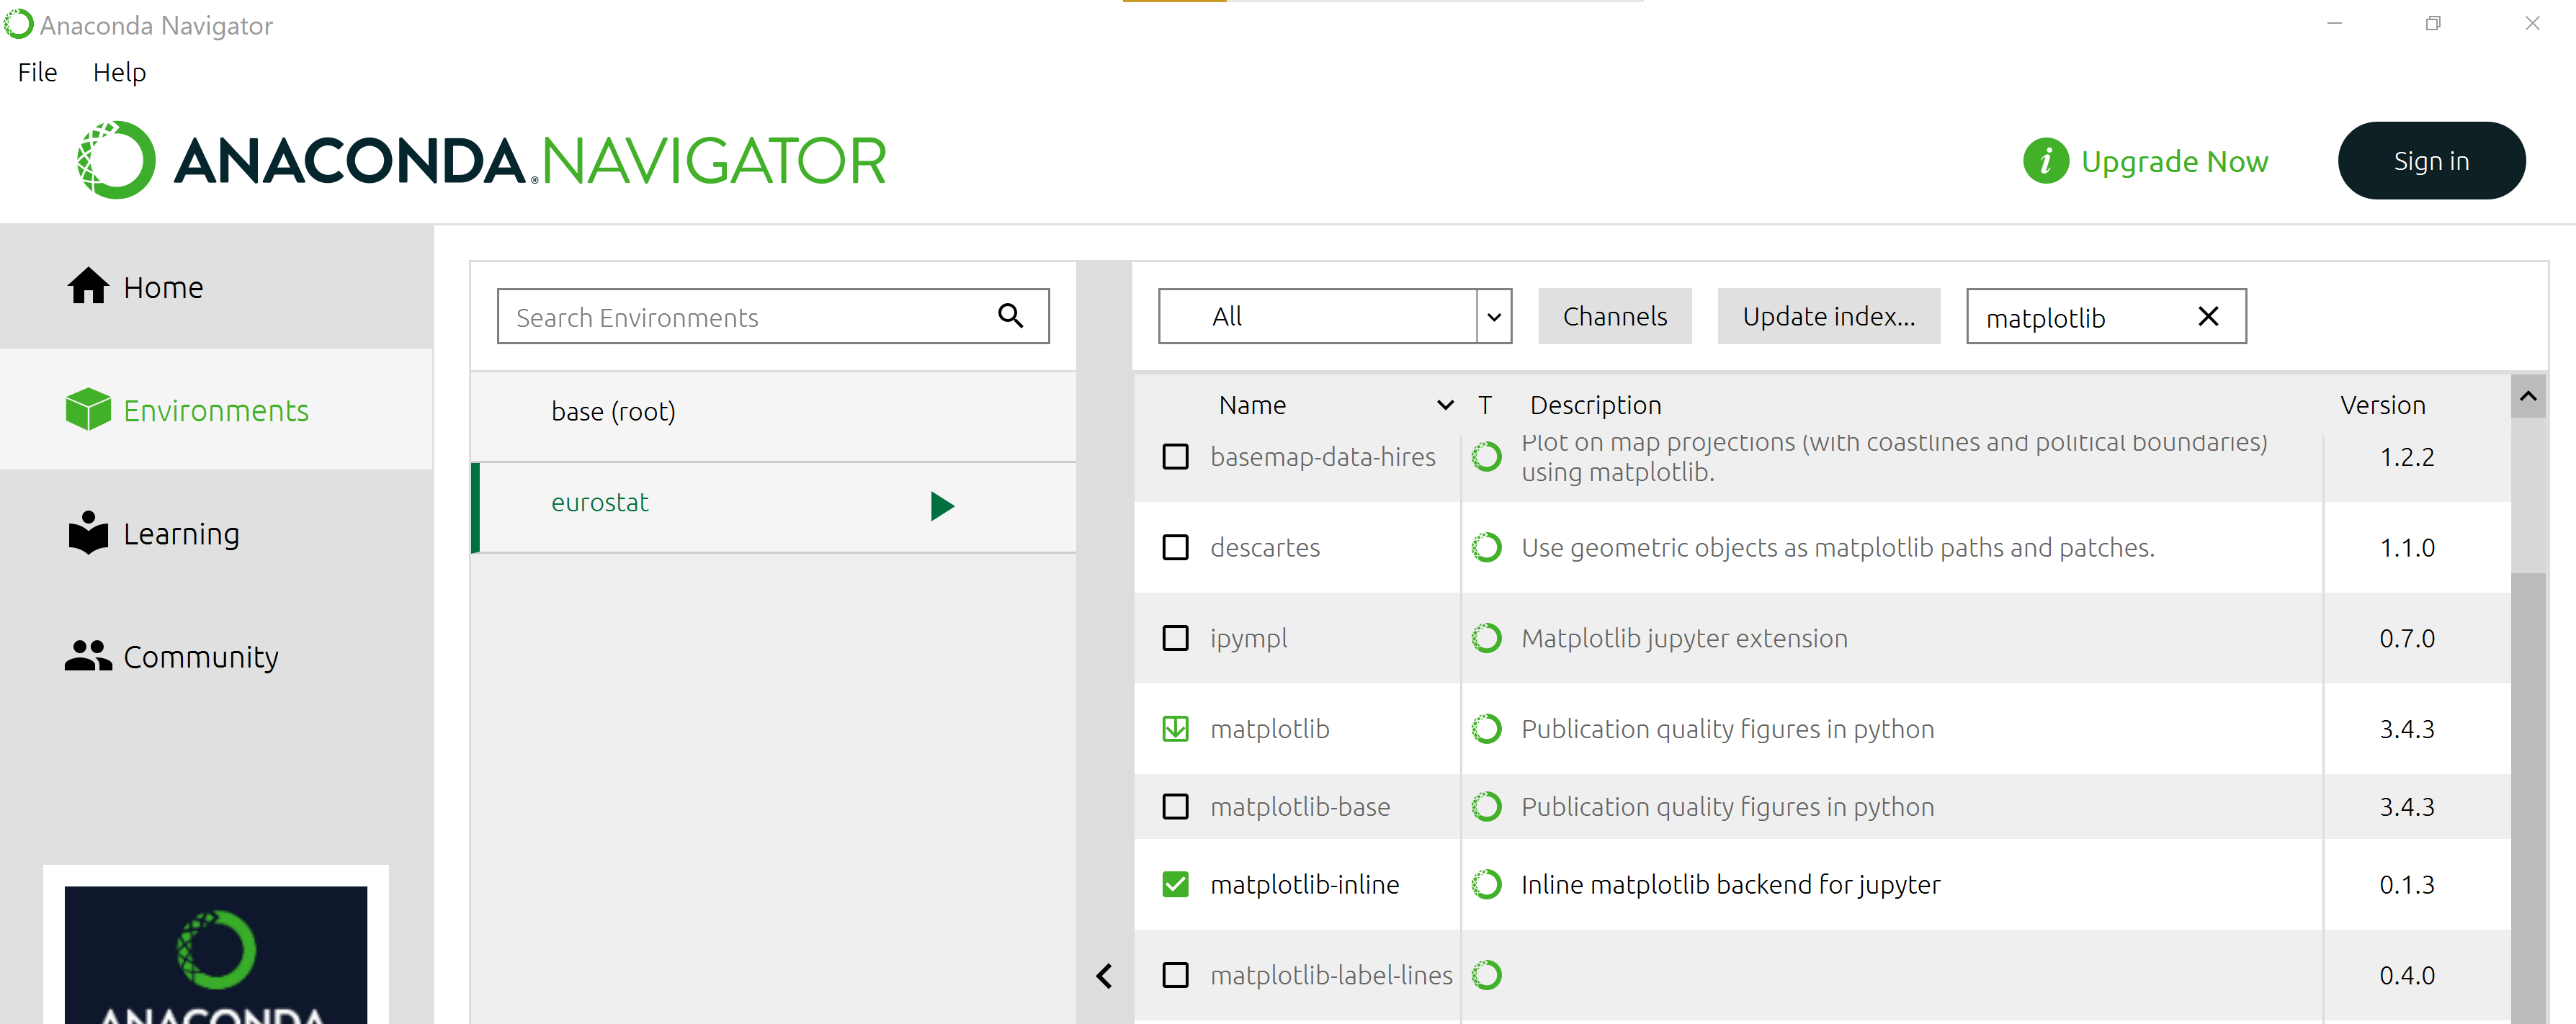

In [64]:
#@title Install Matplotlib
base64_data = "iVBORw0KGgoAAAANSUhEUgAADfgAAAWOCAYAAACFBqd3AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAALEoAACxKAXd6dE0AAP+lSURBVHhe7N0HXNT1H8fxD8OBG9TcCuLI1JxUWlmJ5ixztSyzpe20af3b08rUdqI2LEfuraVomaNEJfdkuDeouBX43/fHl3Fwd9zBcQNez7oH388X+N3vd7/f7wDv3r+PT6qJAAAAAAAAAAAA2GndmGv0CHBc9e6RegQAAFD0VKtWTY8AAAAAAAAAII2v/ggAAAAAAAAAAAAAAAAAAAAAAAAAAFyIgB8AAAAAAAAAAAAAAAAAAAAAAAAAAG7gk2qixwAAAAAAAAAAAAAAAAAAAAAAAAAAwEXo4AcAAAAAAAAAAAAAAAAAAAAAAAAAgBsQ8AMAAAAAAAAAAAAAAAAAAAAAAAAAwA0I+AEAAAAAAAAAAAAAAAAAAAAAAAAA4AYE/AAAAAAAAAAAAAAAAAAAAAAAAAAAcAMCfgAAAAAAAAAAAAAAAAAAAAAAAAAAuAEBPwAAAAAAAAAAAAAAAAAAAAAAAAAA3ICAHwAAAAAAAAAAAAAAAAAAAAAAAAAAbkDADwAAAAAAAAAAAAAAAAAAAAAAAAAAN/BJNdHjAtFtXiu5mHxBV5l6h/aXJ5u8qisAAAAAAAAAAAAAAAAAAAAAAAAAAIoWpwX8hq0fKkNbDjPGfRbdLNM6/22MlVlxE+XrjR/qKqdaZULkx/B5ugIAAAAAAAAAAAAAAAAAAAAAAAAAoPDLd8Dvnt9vkxMXjkpIuQYy5raZxlyH2Y2Nj3O6rZFS/qWN8cGz+6T/ks7G2JYlPbboEQAAAAAAAAAAAAAAAAAAAAAAAAAAhZev/pgn323+xAj3Kenhvk5zrjU+KnfOv07mxU8xxtVL15IPb/jOGNuiwoEvrBygKwAAAAAAAAAAAAAAAAAAAAAAAAAACqd8d/DLLr17n1LKv4zM6favMd54PMrh4B7d/AAAAAAAAAAAAAAAAAAAAAAAAAAAhVWeOvipEJ/q1DcrbqKeyaRCec9e+4YxTg/3xZ/elaeufFnDggAAAAAAAAAAAAAAAAAAAAAAAAAAFCZ56uCXPXiXW6e9/Ab16OQHAAAAAAAAAAAAAAAAAAAAAAAAAChs7A74qZDewjuipZhvcasBv/R5ewJ5Kw9FyttrntNV7gj5AQAAAAAAAAAAAAAAAAAAAAAAAAAKE1/90abOc5sZH89dPmN8zKpHyH3Gx8m7xsn0zn/bHcS7sVq48bWLe2zWM7bltwsgAAAAAAAAAAAAAAAAAAAAAAAAAACeJNcOfuuPrZZXVj0m/r7+MqPLKinlX1p/xrm+2fSxzIz9VVeWtazcRj5tO1ZXQF4kSvS0qRKVoMZBEta3j7QIND4Bl0uUuMhIWRyTIEGhYRIe3kLYFQAAAAAAAAAAAAAAAAAAAAAAAChKcg34udKx80fkvj/a68oyezsE2i0xWqZNjRIj70XgqwjwzIBfXGSELI7RhUlox4ESHqILe8VFSkT6QkI7ykCHF+BiWdfXJE/bDAAAAAAAAAAAAAAAAAAAAAAAPE5ERIQe5c3AgQP1CIXJiRMJ8u+//0iHDh2kePHietYxly5dkiVLlsj1198gFSsG6Vnv5qs/2nTk3EEZ9Gcv6TC7sVHf90e4MZ66+yejdpbKAVVkcqelurIsfR2cJTE+Rof7lASJiU/UY8B9YhZHSpweAwAAAAAAAAAAAAAAAAAAAAAAAN5OhfsOHjok8+bPN4J6jlLfo75XLUMtq7CwGfBTYTp167e4o8Sc2qFnRe6p/6hcFVBN+tYboGecp1LJKtI7tL+uClqcrE9r5ZYhIWo9wSp4gBhZHFnIj8SQltIxNC0pHRQaJi3p3gcAAAAAAAAAAAAAAAAAAAAAQKGiOvE5ckPhpjr3BQUFSUJCgsMhv/Rwn/petQy1rMLCZsCvfPFAPTJ3V8j9MvH2JbpyviebvKpHlj22tIce5VNcrMToodqxaWIkloQfPEHMYincGb9ACQnvY/wA7hPewlR5p8S4aImOnCYRhT2QCQAAAAAAAAAAAAAAAAAAAAAAkA/FixeX7t26ORzyyx7uU8tQyyosfFJN9NjMlZTL4u9bzOjgl9XCO6KlmK9rHoDs953Vkh5b9Cjv4iIjZLGR8AuSsI6hErM4Sox+fqEdZWA47cQKp0SJnjZV0ho3mvZ73z7SwgOSZVmPxdBQkZgY3VkyKEz69rEz/BYXKRFpC+EYdpXEaJk2lecNAAAAAAAAAAAAAAAAAAAAAEDRFhERoUd5k969L305dPMr3BwJ7BX2cJ9itYNf57nNjY8+Pplf0qBCY5eF+wpenMRmtO8LleCQYAnNaOIXa/os4B5BLcMlLP1YTIiSyOhEXQAAAAAAAAAAAAAAAAAAAAAAAADezd5OfkUh3KdYDPh9v/lT4+PJiwmy+M5Nxlh1zPv2likycWf+ErWOeO/6r/Uop7FbR+pR3iRGr5P0fF9oK9UhLVCCMxN+so5QFdwmUFqEh0lmxi9SOBwBAAAAAAAAAAAAAAAAAAAAAICnU533HLmh6Mot5FdUwn2KxYDftJifjY99Ft1sfFThPqXD7MZyW42uxtgV2la9TY9ymrxrrB7lRaLExyTocajUDUkbBQaHZoaqYuJNXwW4SWALaRWqx5IgUZHRHI8AAAAAAAAAAAAAAAAAAAAAAAAoNKyF/IpSuE/xSTXR4wwqyKe8GTZCbqneyRinz6WH/Vwl/X4tyfO6JEbLtKlRYkT8QjvKwHCd8JNEiZ42VaKMTwRJWN8+0iLQ+IR1WZcVFCZ9+6hugKbpxDhZH7lOYkwHUrqgoFAJbdVSWoTkttA0iXHREh8bIzGJCaYDUk+apC8n2LQc+5akJJqWFy/r18VIomlhWdbKtLxA+5aXmChx8etlXUyicYJkylxGrttWgI+Xoh4ztY1Zl2NakISGtpKWLUJM9+XYPnbuPrAuLjJCFhstJbOuU5xERizO7DTZcaBkHKqWxEVKRNpCsh3XluVl2xKjp8nUtAfPtPv6Sp9cTxATq+uVdftCpePAcLG9xh6yf7Nuj0253L8zziez7c3yGJrOp8hI02ObvljTuTbQdK4BAAAAAAAAAAAAAAAAAAAAAFAQIiIijI8DHezKl/378roceLfsgT6lqIT7FKsBvymd/pSgkpXl4cju8mP4vIz5whDwyxpSyh6acjjAZCGwdjJymizOSNZYENpR+pru1OqS4yJl2uKYLCE8K7IE5GxJNC0v0o7lWQ+QJZpWKdL2NqULCpWw8HAboaYCeLyU7IEmS0zr1jG8pen+7AiAOXkf5MZywM/ELEyWSwgu69faCvjlZ9uy7j+7Qnm2AncOBPzs3b99TPvXnoBffh4Ds31ii7X7d+L5ZCngZ2nbTNtBwA8AAAAAAAAAAAAAAAAAAABAXqWHrpyF8FbhQ8AP+ZU15KcUlXCf4qs/mvmlw+9GuK/z3Gay70xcRsjum1t+Mz56t0SJzwjWhErdbImiwOBQSct5iiTExJu+2jEno9PDakESGhYmHTt2lI5hpmWmL1SJWSyR0daXHBebNZyjupOFSZhaTkfTx9AsC0qIkqmRcbqwLC5ymkw1C/ukLc9YL728rKuWU5xETptqFkYyupuFqe9X2xZmWl7WdYqRqKnTxMbmmXHG42Ws41Tz8FdQaKh+zDqatlHvU9O6LY5cn3uoy8SZ+yBfQsKlY6gei1r//N9XvrYtMFgyvyRGYnNbncT4LF3kQiXYalDNBiNUaOf+neaC/VuhpXG/GceqnlYhuox549bKwvYW7PlkPFb2BBcBAAAAAAAAAAAAAAAAAAAAAADgEXwsdfBTVLjvSsoVXaVxdfc+xekd/HLtcpa1I5b6Emtd7TSzjmZpgkzLDbfQcS5rd0BbHcuMbm6JoRLWqqW0CLGQiDLrIGa9S5n5/QWZtiXctC2WElaJEhe9Xk5WCDfdn54ymD8WKqDVMdy0zpYWkf1rrW2f0x+v7OtoraOe2sZIWZy5gibWHztn7QN7We3gZ8ja6c7GMZnrsZ0mv9tmtl9sdQo0sd0RM+t2OWH/5uiK54L9m/V4zuWxyLktTjifzL4uVEJDYyTGtNrm55Q69uMlpAUd/AAAAAAAAAAAAAAAAAAAAAAABYMOfsiPrN37VOc+JX1cFLr4Wezgd+7KmRzhvsJCde5KF5q9fZ8hUFq0ymiZJjG5tijLJijMYlhNCWwRLmEZzblsdD8zQkwqbGcx+ZOtq1uCxMRbaO+VGC2RmUkiI6BkOdynBEqIad3Mw30mcevNA0amdbK6CPW49elrtn3r7Gk7lt/HK+s6Wg1/KWob+2R53HLhjH3gNCHSMvOBkJh10ZKve8vntgW2aGU6GrSYWLF+hph3y2xlMSGXC0f2b7iH798CP590uE8FKc3OKXXsE+4DAAAAAAAAAAAAAAAAAAAAAACeJ3u4TwX61E2N1Zz6nPqawsxiwK+Uf5kc3fFUPS9+iq68VZxk5vtCxWK+Twmpa2eAKbsgCQu3FkBSAiU4NDOolXjScmBHhXGsLyNNSF3bSabE+Ji0rmImQWHheegulyjR67KEITta6h6WXaC0CA8zPQppEmLicwmi5ffxyraOrex43Fpmrp8tztgHzmQWdkyIkkh7wpNW5H/bQiTz0zaCqonxkpnvq2vH8ZNdYdq/rjifTILCJDwvQUoAAAAAAAAAAAAAAAAAAAAAAAAXsxTuU9361K0ohfwsBvw6zG4sG45HGaG+RoHNpH3Nbsb8qA3vyopDS4yxu/mY/nNYXKxk5vtsBY7sDDBlFxQqwblkawIrZH5BQsJJPcqfnMtxQuc0OWlarh4GhUlLe9NZgcGSkclLiBGbjc/y/XjlYR2zrp8TOWtfWpct7BUVKfnI+DnE0rZlDb9Z63KZNWRquVtmbgrT/nXB+WRiTwgSAAAAAAAAAAAAAAAAAAAAAABPExERYdxQdFgL96UrSiE/iwG/zrV7yosrB8gd88Pkq3YT5fVWn8rtc641PvfOmueNj66w+cR6Pcrpwauf0iP7xWW278s1cGQWYFoXnXvnrAKTKIlxcRIXFy3RkZESOW2aTJtmetJanLktOWTtnGY6iCvooUMST2Zuc2AFB0JDgZKZyUuQAs295XkdHZWHfVAQAltIeGYbP4mKdMZxmcdty7XLZZaQqSOBtqwK0/51yfkUJEF5OtkBAAAAAAAAAAAAAAAAAAAAAABcJ7dwX7qiEvKzGPB7qcUHxsfzV87J9JjxkpqaIn/cudG4udLgFQ/qUU79GzoY8EuMlnVZ8joxi9OSvVZvWcM9dnTOcq5EiYuOlGnGukyVqYsXy+LFURIVEyMxpoPR9L/98hqMOmm6Hz0McjA1VMF00rhEPtYxd07cB04U2KJVZrAuIUrW29td0owzti1EWmaEDS10ucwSMg0KDXb5MZg7F+9fl5xPWcOAAAAAAAAAAAAAAAAAAAAAAAB4j4EDB5rdUHjZG+5LVxRCfhYDfln1Du0vHec0lQ6zG8uG41GypMcW/RnvkhgfkxGwcVyCxLgq4ZcYJ5ERU2VxlPn6qoMwKChUQkPDJKxjR+mYEa6C03n0PgiR8I5ZuksujrTQPc8GJ25bYHCoZET8siX84tZH6eUHSWiwh6XOOMcAAAAAAAAAAAAAAAAAAAAAAABcztFwX7rCHvKzGvArXaysXB3YVFdpXl71qBH0cwVb99OggqPrkCjx6e3ETIJCVYjHnltmwCchJt60lIKWKNGRiyW9d2BQaJh07JuWPO7Tp4/pFi7h4S2kRUiIhLiwVVdCwkk9ss/JjPZnQeL0xmtWOLqO1nnmPjATEi6ZGb8YWRxpb8TPydsWGCwZp0hMbJagYZzEpt9JaCtp4YSHqTDtX284nwAAAAAAAAAAAAAAAAAAAAAAyIuIiAiHbihalixZYgT0HAn3pcse8lPLKiysBvxmd/1Hvm43WYauflzPmCvIoN/suEl6ZNm3t0zRIzslxktGvi8oTMLDVYjHnlsrychRJcRIgTfxi1svUenrGdpR+oS3kJC8ZIwCK0jGt5kFrxxQISijO5sknnQg3JgoJzO+OFAKNAOXp3U8aTqJ9dASZ+2DAhYS3jHz2IxZJ9H2bLzTty1QgjMTfpLRxC8uNiNAF1o3RI/yoDDtX284nwAAAAAAAAAAAAAAAAAAAAAAAArQ9dffINWrVXM43JcuPeSnlqGWVVhYDfilW3t0lR7l9Pzf/fTIeS4mX5CvNn6gq5x8TP85Km59lKRneoJCgzPDb7kKkZZh6bGcBIlan6eonN0SM5M8EpRLq66sX5tTBdP362HW4JUjsnZnS4gSuzfdLEwZZFqTApQ1yGhvADNL+MwS5+2DghYi4Rlt/EzHZmS0JGYNkVlQENsWGByacZ8x+kCLS2/fFxQmLfOR7ytU+9cbzicAAAAAAAAAAAAAAAAAAAAAAPJo4MCB+bqhaKhYMUi6du2ap3BfOvW9ahlqWYVFrgG/967/Wvx9/XVlbkvCf/L4sp66yj8V7us2r5WuLFvcY7Me2StO0vNGIkESGuxYC6ysAaY8d8NzujhZn9GGzJJAadEqo7+bxCyOzMN6Z+3OZlrGumg7uo4lSnRkZpgytFWLzIBWgQiRupktFu0IYJrWb52t+JcjctsHLhDSUjLzp1ESud5Z6+PAtgW2kIxDzTg/Ms83x8K0lnjZ/rXZmc8bzicAAAAAAAAAAAAAAAAAAAAAAAC4Wq4Bv+hj/8iMLitlSY8tGTclfTzmtplGnV+L9s7MNdx3fZVb9MgBWTt6BYWKg/k+lfDL7LyV1254dgqskLlyCVHrJc5SAigxTiKnLbbZpcyQNfxl+urF0yItL8+QKHHRkRKdbdsCW4SbBcim5raMyKmSkYnKb/c2O4W0DMsSwFws0yLjLAenTI9b9LQs62eFU/dBgQuUFuGZ258QE5MRBrOkoLYtJCOFZzo/otPPN8fDtJZ4/P416zKYICf10BJvOJ8AAAAAAAAAAAAAAAAAAAAAAADgWn7vmOixRddVuVm6zG0h43d8m3Hrf/XTcv8fHeSvg7/LxF0R8u2mYcb8fQ0eFz8fP/2d9uswu7GsOrxUV9b93GGBHtkvbv0SidUhmqAmN0qragFphd0CpOTFONl68LxRJfoESau6WYJLFw7L1q0HxfhsQA1pfE0103fYcDJO1mWsUKj5sgJ95OS6WB1gSpTYrXESd/KiBPhckJMn42X9+pWyZMUWSTwfJGFh1eXgQSvLMQRItWuCTHdnWp5aufNqeetkXdxJOXnxlPhcyLLMJesk1rSsgNBWYr4YvYz0ddLLiDMt49BFH9MyTMvKugy9Omp9OvZpK9V0acaZj5cSUE2q+Wbun/OJsbJ1XZxpvS6KT7bHTX1JUFhHaXIh1hir7avR+BoxOyScug/sdzIu/fGzsE62ZNv+DJbWp6C2LctyE9O/J/Qm6X5Nbo/HSYnLWJ8gCW1VN2eHOi/Yv6fitur7My0vzrRuFwOMcyN+/Xo5HFg3y/0XwPkkF+Tw1vT7t/IYAgAAAAAAAAAAAAAAAAAAAAAAwGPl2sFPSe/al9XR84dka8J/cujsfj0jRhAwLay3TM9Yp75Pfa262cPSOuQuTmIz2nDlvaNYYHBoli5i6yQ6PXjjdCES3jdLxzJJkISYKFm8eLHpFiUxMaqdl2k7OvaRFhXSvsI20/L69JWwzBaEpkXGSExU9mXaYlrGQPNlJBjLUN+fcxlBoR2lb59w03e5TmCLPtI3s12hSYJpnXJuY1BYX+mT6wPn7H1Q8Mw6w9lUUNsWIhlN/LTQus47Ajx7/5p3UVRd/NLPjagYS08Unn8+AQAAAAAAAAAAAAAAAAAAAAAAwHXsCvgp4zss0qPcvfXvMxnhPWu3B5d00l+du7yF+0QSo9dJZr4vVPKY71MJP8nM4yRITHyBJfxUmkn6DOwrHU13GJQ10ySmWoV9+vaRcIfSPiqA1EcG9u1ohIrMl2laqmkiNEwtd6CN5aYto6+VZaiJ0LAw6WhaRh/TQtzRQUyFwDK2Uc+lUY+bXrcWdq6Z0/dBQTPtn1bZEnbWFNC2hbTMGpoLFSfm+wwevX/V8kzrFprtxAgKChTLGUHPP58AAAAAAAAAAAAAAAAAAAAAAADgGj6pJnqcqz1JMfLo0juNwJ0K6blCXsN9AIqiOImMWKyDvaHScSDd7wAAAAAAAAAAAAAAAAAAAAAAAOC57O7gp9QpGyqL7vhPVwWPcB8AhySelIz+mkFBVjroAQAAAAAAAAAAAAAAAAAAAAAAAJ7BoYCf4u9bzPj4ZJNXjY8FoUXlGwj3AXBYYnyMJOhxUGiwBOoxAAAAAAAAAAAAAAAAAAAAAAAA4Il8Uk30OE/uWnCDnLmcpKv8I9gHIE8So2Xa1Cgd8AuSsL59pAUJPwAAAAAAAAAAAAAAAAAAAAAAAHiwfAf80g1Z0V82nVinK8fULltXfmg/V1cAoCVGS2RkgtQNbykhgdbTeolxkRK5OLN7n4R2lIHhIboAAAAAAAAAAAAAAAAAAAAAAAAAPJPTAn5ZTdj5vfy47StdWdYn9CF5oskrugIAC8y68okEBYVKYGCQ1K1bQU6ejJWEhERJjEnIDPYpQWHSt08LoXkfAAAAAAAAAAAAAAAAAAAAAAAAPF2BBPwAwCmyBfxyExTaUcLDQwj3AQAAAAAAAAAAAAAAAAAAAAAAwCsQ8APg4RIlMS5e1sfGSGJigiSYt+uToKBACQytKy1bEOwDAAAAAAAAAAAAAAAAAAAAAACAdyHgBwAAAAAAAAAAAAAAAAAAAAAAAACAG/jqjwAAAAAAAAAAAAAAAAAAAAAAAAAAwIUI+AEAAAAAAAAAAAAAAAAAAAAAAAAA4AYE/AAAAAAAAAAAAAAAAAAAAAAAAAAAcAMCfgAAAAAAAAAAAAAAAAAAAAAAAAAAuAEBPwAAAAAAAAAAAAAAAAAAAAAAAAAA3ICAHwAAAAAAAAAAAAAAAAAAAAAAAAAAbkDADwAAAAAAAAAAAAAAAAAAAAAAAAAANyDgBwAAAAAAAAAAAAAAAAAAAAAAAACAGxDwAwAAAAAAAAAAAAAAAAAAAAAAAADADQj4AQAAAAAAAAAAAAAAAAAAAAAAAADgBgT8AAAAAAAAAAAAAAAAAAAAAAAAAABwAwJ+AAAAAAAAAAAAAAAAAAAAAAAAAAC4AQE/AAAAAAAAAAAAAAAAAAAAAAAAAADcgIAfAAAAAAAAAAAAAAAAAAAAAAAAAABuQMAPAAAAAAAAAAAAAAAAAAAAAAAAAAA3IOAHAAAAAAAAAAAAAAAAAAAAAAAAAIAbEPADAAAAAAAAAAAAAAAAAAAAAAAAAMANCPgBAAAAAAAAAAAAAAAAAAAAAAAAAOAGBPwAAAAAAAAAAAAAAAAAAAAAAAAAAHADAn4AAAAAAAAAAAAAAAAAAAAAAAAAALgBAT8AAAAAAAAAAAAAAAAAAAAAAAAAANyAgB8AAAAAAAAAAAAAAAAAAAAAAAAAAG5AwA8AAAAAAAAAAAAAAAAAAAAAAAAAADcg4AcAAAAAAAAAAAAAAAAAAAAAAAAAgBsQ8AMAAAAAAAAAAAAAAAAAAAAAAAAAwA0I+AEAAAAAAAAAAAAAAAAAAAAAAAAA4AYE/AAAAAAAAAAAAAAAAAAAAAAAAAAAcAMCfgAAAAAAAAAAAAAAAAAAAAAAAAAAuEHhDfjtHiVtfXzEx6etjNqt51D4sJ8BAAAAAAAAAAAAAAAAAAAAAAAAeCk6+AEAAAAAAAAAAAAAAAAAAAAAAAAA4AZeG/BbOEh1bTPdBi3UMwAAAAAAAAAAAAAAAAAAAAAAAAAAeA/XBvwWDkoL5Tl8GyRmMb7do+T9CD2OeF9G7dZj5NNuGdVWP+Z5Ck7m9/sBAAAAAAAAAAAAAAAAAAAAAAAAoOjw2g5+AAAAAAAAAAAAAAAAAAAAAAAAAAB4MzcF/NrIyF2pkppq7220dNHfaag3WN4cqMcD35TB9fQYAAAAAAAAAAAAAAAAAAAAAAAAAAAv4bUd/LqM1uG/0WbRPwAAAAAAAAAAAAAAAAAAAAAAAAAAvILXBvwAAAAAAAAAAAAAAAAAAAAAAAAAAPBmBPwAAAAAAAAAAAAAAAAAAAAAAAAAAHADrw34LRzkIz4+ptughXrGGXbLqLZ6uWa3QeLMe4G5jH1pdmsro3brL3CW3aOkbY77yXpjPwMAAAAAAAAAAAAAAAAAAAAAAABwHTr4aWkhs/oyZLWeMBMhXVUAzKlhQuwe1dYI1nWN0BNmVsuQ+qbHvO0oyX/Ob6EMUvuv/hDTUm3R+5mgHwAAAAAAAAAAAAAAAAAAAAAAAAAXIOCnu/ZlhMwGLpDU1FSz24KB+nMRXQn5OYkKVNZPT1O2GSm7sj3mu0a2Sfvc6iFS3ykhvzQDF5jfT9Zbxn3qoB+7GgAAAAAAAAAAAAAAAAAAAAAAAEBBKvIBv92j+md07TPCX6O7pBVZdBmdJfwV0ZXgV34tHJQRqGwzcpekrhos9dLKDPUGr5LU9GTl6iHSf5SzIn7WGfeZuksyd3VbccHdAgAAAAAAAAAAAAAAAAAAAAAAACiiinbAb/co6a/TfSpoZiHbl6He4PGZwa/3nddRruhZKIPS030DF8iqwdmjfVl0GZ3RPXH1kM9M3+kK9WTwqgWSdrerZchnpDkBAAAAAAAAAAAAAAAAAAAAAAAAFAw3BfxWy5D6PuLjY8etANvl7Z43xbQmJm1GynhbQTNDPRn8ZnrabIrMK+wJv4iulveHzVv9jG6IVi2cJWnxvoGywFaiUuvy8khJy1VGyCyXZe26yOj0ZGHE+3TxAwAAAAAAAAAAAAAAAAAAAAAAAFAginAHv90yb4ru3nd3d8kt3meo30iHzVbLtl3GAA5aOCu9e99dknu8z6ReQ2mqh5t2uDBp1+WujC5+Uwp9mhMAAAAAAAAAAAAAAAAAAAAAAACAO7gp4NdGRu5KldRUO252dHnLm12yTXeba9rQrnif+8Jm7jBwgeX9YfO2S0amJSCt2C07NqWN2jSqnzbIVX1ppJe52qWpSnfdLwAAAAAAAAAAAAAAAAAAAAAAAICiouh28Nu9Q3TWTCK6+oiPjz23rqL7zyFPMkOVq4fUt/D4WrrVlyH6e1yrnjTMTHMKPfwAAAAAAAAAAAAAAAAAAAAAAAAAOFvRDfgBAAAAAAAAAAAAAAAAAAAAAAAAAOBGBPxMBi5IldRUx26rBtfT3428aDNyl8XH1eZtdBf93QAAAAAAAAAAAAAAAAAAAAAAAADg/YpuwK9eQ2mqh3CV+tKojR56k6YNhTgnAAAAAAAAAAAAAAAAAAAAAAAAAGcrwh38MsNmEbMWpg1QwOpJQ52qXD1lnuxOG3qohTIrIm3UplH9tAEAAAAAAAAAAAAAAAAAAAAAAAAAOFERDvhlhs0kYpYQ8XON+umpytVTZJ4nJ/wWzpK0fF8bubs7/fsAAAAAAAAAAAAAAAAAAAAAAAAAOF8RDviJdHl5pKTFzSLk/VGe3U+usKg3+E0ZaIxWy5DPPDVWuVtGvZ/evu9uId8HAAAAAAAAAAAAAAAAAAAAAAAAoCAUgYDfatm2Sw+zqzdY3kxLm8nqIfVlEG38XKCLvDxSd/GL6CptnRastLGfs4iYlftO3j2qvwxZnTYe+OZgId8HAAAAAAAAAAAAAAAAAAAAAAAAoCAU3oBfve5yd0aOrK1Yy5F1Gb1LMvNmPuLTdpRYi5ztHtXW5udhn3qDV8mCLMFKH59BYjV2t3CQ7c/buZ8zRHQ1Lc/HSrBwoQwyfa6+Tve1GblLRncxhgAAAAAAAAAAAAAAAAAAAAAAAADgdIW4g189GZzenk9Wy5D61sJ7pq9blZoROJPVQ6S+j+lrLdyM4NfqbWJHozjkosvoVNmVnqyUCOlq4fE2bl0jTJ/fJDusBvfs3c/m0oKF2e7Lp6tpTdIMXJAqqwbTuw8AAAAAAAAAAAAAAAAAAAAAAABAwSnEAT+TLqMlNXWBpMe/pGlDsRbZUoGz1NQsQT8LVEe31NTRQlM351Cd/NRjnhn0s2DgAtPXrBKbWTsH9rMK7tm6z7R9nErnPgAAAAAAAAAAAAAAAAAAAAAAAAAFzidVpZmAQm2hDNLd+VTAj/AeAAAAAAAAAAAAAAAAAAAAAAAAAE9QuDv4AQAAAAAAAAAAAAAAAAAAAAAAAADgoQj4AQAAAAAAAAAAAAAAAAAAAAAAAADgBgT8AAAAAAAAAAAAAAAAAAAAAAAAAABwAwJ+AAAAAAAAAAAAAAAAAAAAAAAAAAC4AQE/AAAAAAAAAAAAAAAAAAAAAAAAAADcgIAfAAAAAAAAAAAAAAAAAAAAAAAAAABu4JNqoscAAAAAAAAAAAAAAAAAAAAAAAAAAMBF6OAHAAAAAAAAAAAAAAAAAAAAAAAAAIAbEPADAAAAAAAAAAAAAAAAAAAAAAAAAMANCPgBAAAAAAAAAAAAAAAAAAAAAAAAAOAGBPwAAAAAAAAAAAAAAAAAAAAAAAAAAHADAn4AAAAAAAAAAAAAAAAAAAAAAAAAALgBAT8AAAAAAAAAAAAAAAAAAAAAAAAAANyAgB8AAAAAAAAAAAAAAAAAAAAAAAAAAG5AwA8AAAAAAAAAAAAAAAAAAAAAAAAAADcg4AcAAAAAAAAAAAAAAAAAAAAAAAAAgBsQ8AMAAAAAAAAAAAAAAAAAAAAAAAAAwA0I+AEAAAAAAAAAAAAAAAAAAAAAAAAA4AYE/AAAAAAAAAAAAAAAAAAAAAAAAAAAcAMCfgAAAAAAAAAAAAAAAAAAAAAAAAAAuAEBPwAAAAAAAAAAAAAAAAAAAAAAAAAA3ICAHwAAAAAAAAAAAAAAAAAAAAAAAAAAbkDADwAAAAAAAAAAAAAAAAAAAAAAAAAANyDgBwAAAAAAAAAAAAAAAAAAAAAAAACAGxDwAwAAAAAAAAAAAAAAAAAAAAAAAADADQj4AQAAAAAAAAAAAAAAAAAAAAAAAADgBgT8AAAAAAAAAAAAAAAAAAAAAAAAAABwAwJ+AAAAAAAAAAAAAAAAAAAAAAAAAAC4AQE/AAAAAAAAAAAAAAAAAAAAAAAAAADcgIAfAAAAAAAAAAAAAAAAAAAAAAAAAABuQMAPAAAAAAAAAAAAAAAAAAAAAAAAAAA3IOAHAAAAAAAAAAAAAAAAAAAAAAAAAIAbEPADAAAAAAAAAAAAAAAAAAAAAAAAAMANCPgBAAAAAAAAAAAAAAAAAAAAAAAAAOAGBPwAAAAAAAAAAAAAAAAAAAAAAAAAAHADAn4AAAAAAAAAAAAAAAAAAAAAAAAAALgBAT8AAAAAAAAAAAAAAAAAAAAAAAAAANyAgB8AAAAAAAAAAAAAAAAAAAAAAAAAAG5AwA8AAAAAAAAAAAAAAAAAAAAAAAAAADcg4AcAAAAAAAAAAAAAAAAAAAAAAAAAgBsQ8AMAAAAAAAAAAAAAAAAAAAAAAAAAwA0I+AEAAAAAAAAAAAAAAAAAAAAAAAAA4AYE/AAAAAAAAAAAAAAAAAAAAAAAAAAAcAMCfgAAAAAAAAAAAAAAAAAAAAAAAAAAuAEBPwAAAAAAAAAAAAAAAAAAAAAAAAAA3ICAHwAAAAAAAAAAAAAAAAAAAAAAAAAAbkDADwAAAAAAAAAAAAAAAAAAAAAAAAAANyDgBwAAAAAAAAAAAAAAAAAAAAAAAACAGxDwAwAAAAAAAAAAAAAAAAAAAAAAAADADQj4AQAAAAAAAAAAAAAAAAAAAAAAAADgBgT8AAAAAAAAAAAAAAAAAAAAAAAAAABwAwJ+AAAAAAAAAAAAAAAAAAAAAAAAAAC4AQE/AAAAAAAAAAAAAAAAAAAAAAAAAADcwCfVRI8Bl7iQfEHOXzkr59TtctpHHx8fCfAvLaWy3Er4ldDfAQAAAAAAAAAAAAAAAAAAAAAAAACFDwE/uExyarJ8s+kzmRbzq56xrZhvMaleupbULhMitcsGm26mj6ZxvfJXE/4DAAAAAAAAAAAAAAAAAAAAAAAA4PUI+MHllh9cIsPWvylnLifpGceo4N81Qc2kZeXrpFXl6+WawGbi7+uvPwsAAAAAAAAAAAAAAAAAAAAAAOC4lJQU2bN/v+yKjZPdptuuuDiJ27tPTiclyZmzZ023c3L23Fk5a/p46fJl/V1AwSherJiULl1KSpcqLWVMH8uULi3lypaVkNq1pH5IiNSvW1fq1Q2WOjVriq+vr/4ueCMCfsizi8kXTbfzUq54BT1jv8PnDsg7a16WrYkb9UzelfQLkOuqtJXba90pbaq2MwKAAAAAAAAAAAAAAAAAAAAAAAAAtpy/cEH+Wbde/l79jyz/51/ZsHmLXLx0SX8W8A4liheXZk0aS7sbrpeb29wgN7RqKQElS+rPwhsQ8IPDDpzdJ7PifpMVB5fKuPZTpZR/af2ZNJH7F8qaIyvl+Wav5fhcVldSrsjIDR/I3Phpeib/yhUvL+1rdJZOte+UxkHN9CwAAAAAAAAAAAAAAAAAAAAAAIDIoSNHZcrsObIwcqms27CRQB8KHRX4a9XsWukS3l7u7nGnVKtylf4MPBUBP9glJTVF/jnyt8yMnWSE91JN/z1+zfPyYMPH9VekuZxyWR5Y3F0OnTsg1UvXlDdbf5Jr0O6XHWNk7NYvjWU6U/0KjaR/w4HSrnoH8TH9BwAAAAAAAAAAAAAAAAAAAAAAip5z587L7EW/y+SZs4xOfcnJyfozQOHm5+dndPa7t+dd0qNzJylVKkB/Bp6EgB9ypTryjdn6hRw8u1/PqE55FWRKp99zdOibsnu8fL3pU12J+Pr4yoMNB8qAq58UPx8/PZvT4n3zZNj6N42AoLMFlw01gojhNbsa6wMAAAAAAAAAAAAAAAAAAAAAAAq//QcPysjvx8iEGTOMkB9QlKlwX79evWTIE49LzerV9Sw8AQE/WLXr5Db5YuMw2XhinZ7J9Ng1zxnd8bI6czlJ7v2js5y+dErPZGpRKUzeuW64BJaoqGdyij4eJa//86ycvXxGzzhXjdK15ZmmL8uN1W7TMwAAAAAAAAAAAAAAAAAAAAAAoLCJ3bNHhn/zvfw2a7ZcvnJFzwJQihcrJnf3uFNeevoJqVunjp6FOxHwQw4nLyYaHfvm75khKakpejZTMd9iMr3zUqlQIlDPpFHf88uOMbrKqVLJq+S960dIk6DmeianXae2y0srB0rixQQ943w3Vr1Vnm/2mlQtVUPPAAAAAAAAAAAAAAAAAAAAAAAAb3fg8GF5+5PhMn3efElOTtazACzx8/OT3t27ybuvviQ1qlbVs3AHAn4wc+pSooz47wNZe3S1JF0+rWfNdajVTd5q/Ymu0qiue30WdZCzV2x33/P39Zdnmr4iverer2dy2nsmXh5Z2lsuJV/UM85X0q+kPNhwkNxbf4ARWAQAAAAAAAAAAAAAAAAAAAAAAN7pSnKyfD32B/nkq2/k7LlzehaAPUqXKiVDn3tGnn70YfH389OzcCUCfrDqwNm9si1hk0QfjzICf4fOHTDmv2n3izSt2MIYp5uwc5yM3jJSV7Z1rdNThrZ8X1fmUk3/DY9+V+bGT9MzBate+Yby3nUjpGYZWooCAAAAAAAAAAAAAAAAAAAAAOBtVq6JkhfefEe27dqlZwDkRaP69WXE++/IjdeF6Rm4CgE/2O3g2f2yJeE/6Viru55JcznlkvT9/XZJuHBcz1h3Y9Vb5cMbvhRfH189k8nV4b50pfxLyyst3pX2NTvrGQAAAAAAAAAAAAAAAAAAAAAA4MkuXb4sr3/wkYz5daIQjQGcw8fHRx5/4H756I3XpXixYnoWBY2AH/JNBfI+i35HV9aprn8jbhwrJfxK6BlzX278WKbFTNCV6/UIuVueu3aoFPMtrmcAAAAAAAAAAAAAAAAAAAAAAICnid+7Tx585jnZsHmLngHgTM2bNJHxX38hwbVr6RkUJAJ+RVxKaorFbnqOOHflrCzaO1tmxE6SvUlxetZcSLl68nW78VK2WDk9Y27ctq/l5+3f68p9GgU2lU/bfivliwfqGQAAAAAAAAAAAAAAAAAAAAAA4ClmLVwkzwz9n5xOStIzAApCubJl5ZtPPpIenTvpGRQUAn5F3Pw9MyRiyxdSr3xDs1udsqF5Cv6tPbpapsdOlNWH/zLCg0pQyUoy+pZJUqVUNaPO7rfdP8s3mz7TlfvVKhMsn98YIVVLVdczAAAAAAAAAAAAAAAAAAAAAADA3d765DP5ImKsEIUBXMPHx0eeH/iYvPfqy3oGBYGAXxE3dfcv8tWmT3SVSXXaa1aptbSsfL3pdp3Rgc/H9J+9Dp87ILNif5PF++fLh9d/IVcHNtGfMacChp+sf0tXnqNSyavk8xtHm7a7vp4BAAAAAAAAAAAAAAAAAAAAAADuoKIvT7z8qkyaMUvPAHCl+3v3lO8+HWYE/uB8BPyKkAvJF6SkX0ldpRm/Y7SM3fqVrqxTXe0mdJynK+dYduB3eTfq5YxOf55GhRw/bfudNA5qpmcAAAAAAAAAAAAAAAAAAAAAAIArqdjLq+9/KN//NF7PAHCHJx9+SIa98TohvwLgqz+ikNuTFCtjt36pq0znLp/VI9uuCWqqR5kup1ySVNN/ebH71A75YO1Qjw33KUmXT8vLq56QuNO79AwAAAAAAAAAAAAAAAAAAAAAAHAVFe576tXXCfcBHuC7H382zkd6zTkfHfyKgBMXjsmTf/WTphVbyputh+nZNCM3fCAzYyfryroPb/hCbq4Wrqs002MmmL53ktxV9z7pUqeHlPYvoz+TuyX7F0jCheNS0j9ASvoFGCf3xeTzcl7drpyTI+cOyf6ze2X/mT3G+rtT5YCr5Nt2E6RKqWp6BgAAAAAAAAAAAAAAAAAAAAAAFCSVM3j61dfl12nT9QwAT/BA397yzbCP6OTnRAT8CjkVlnvm74dk18lt0r5mZ3knbLj+TJph69+UBXtm6soyFcCb222FlPAroWfSqO52/x5ZYYwD/EvJ7bW6S6+690tIuXrGnLOoTnr/HY+S9cfWmG7/Stzp3fozrlO7bIh82+4XKVe8gp4BAAAAAAAAAAAAAAAAAAAAAAAFQUVdhr7/oXxH5z7AIz05oL8Me/N/hPycxFd/RCGUnJosb615wQj3KVdSrhgfs/Lz8dMj61pddUOOcN+F5AsSfTxKV2lBwtlxU+TT6Ldlb1KcnnWOssXKGd0Dn7/2Nfk5fJZM7DhfBlz9pFQvXVN/RcFT2/Tq6qflcsolPQMAAAAAAAAAAAAAAAAAAAAAAArCEy+/SrgP8GDq/HzylaG6Qn4R8CvEhke/m9FhT1GBv+z8ff31yLoWlcL0KJPqpHcp+aIxVsvoULOrjL51knx3ywSj211BqlmmjjzS6GmZfPsiGXXTOGlV+Qb9mYK1JWGDfLPJvAMiAAAAAAAAAAAAAAAAAAAAAABwnrc++UwmzZilKwCeauL0mcb5ivwj4FdILdo7R+bvmaGrNMkWOvj5+xbTI+ssBfz+ObxcfEz/ta/ZWX7tME/eCvtUGgU21Z91nZaVr5eRN401goXXV7lJzxacGbET5a+Di3UFAAAAAAAAAAAAAAAAAAAAAACcZdbCRfJFxFhdAfB06nydveh3XSGvfFJN9BiFxPELR6X/kh5y5nKSnknT+qo2MuLGMbpK893mz2XSrh91lVPZYuVkbrcV4utjngX9aN3/pGfde90S6rNl5aFl8sXGj+XwuYN6xvlKFysjP7SfLtVK1dAzRculy5fl8LFjEli+vJQtXVrPut+Bw0fkSnKylCxRXKpUqqRnkV9qXytVK1c2PhZWJ06elGMnEuTMuXNy5uw5UT8aSwUESOlSARJkOtarXVVZfHx89Fd7N7Vt6dvp6+sjZUzncWnTtnqyxNOn5XTSGWNcvcpVUsw/9+6zQFEzYef3MjN2glxOuWzULzV/X26u3tEYe6pU03/Hzx+V5NS0i1Coi0dUDqhi+r3Tz6g9wdL9C+T7zZ/IpZSL0rJyG/lf6+Hi50HrVxglXjwhF5Mv6EokwC9AypcI0pXnSLhwTLYk/Cf7zsSZbvFy6Nw+4++v81fOmm6mn7Gmv59K+pWSkv4BUqF4oFQvXdt0qyUh5epL46CWUqZYWb0k73PWtJ1vrnlWYk5tN/5efLnFh9LMwkVhnOHclTNy+tIpXXmWUv6lpVzxCroqOIfPHZBtiRtk/5k9plu8qd5v2gdnTI+N6VhLPifFfIsb66JuQSUrSa0yIVKzdLDULd9QGlRo7HHPWcmpyabn/iPGz4CCoH6WVDA9Z5TwK6lnAAAAAAAAAAAAkBdXUq4Yr38qAf6lxd+X9+sAAFwjbu9eufmOnnI6yTwLAcCzlStbVlbMnSXBtWvpGTiKgF8h9Orqp2T14eW6yqQ68X1xs3mYb+3R1bIlYYOU9CspJfwD0j6abuqNtKpWb0YNKVdPf7V3uJB8QX7a9q1M3v2TpKSm6FnnujqwiXzb7tci90frkePH5fqe98iho8ckoGQJmTPmO2l3XWv9WfdISUmRTg89JsvXrDVqPz9fmfTF59KjY7hRe4qLly4ZIURbT7kliheXmtWq6sr9Br3+tvw0faYxfuL+e+SLt/9njL2dOo7//CfKdMxEyeadu2RnbLwknLL9xnG1b+rUqC6N6oVK25bN5cbWraRl42uM481TJSenyPotW2VF1FrZujtGdsbFy664Pca2Zj8O1XZUDqooDUKCpWHdYGnSsIHcYjq31fa627gp0+XZd943tkdR57Y6xz3tsd9/6LBxnlujAqLq/C5eLPfOuVmpMObR4ydsPnfkhVqP0qVLGUHtwh6Y/N/wUaZzfo1UKF9OvnjrdalXp7b+TOFx9Pwhuf+PDrpKU9L0u9zX7SZJcLn6esazqBcCXlw5wPR7aLSeSVOjdB358uZfPSLQpcIz9/0RboSZ0r0VNlLaVb9dV84Rc2qHvBc1WE5cSAvVp7u+Sjt5o/Vw0/OHdzVdV6HIbzd/LBeunNczIsX8ikuf0P7Sr8ETesayEf+9LQv2TNNVpr71Bsigxi/ryj1STX9XbDyxTv4++IesP/6P7E2K1Z9xnAogqfCV2sfta3T12PPUmh+2fSETd0boSowQ2Te3/GZslzNF7p8nn6x/3fQ3XbKe8TwPXf2MPNjwSV05h3p+XHdslaw8FCnRpmPt0Nn9+jOOU6G/ayu1lrCrbpZbqncygm/upIKxzyy/z/i5VdBK+ZeRiiUrS5VS1aX1VTdKm6q3Gj9jAAAAAAAAAAAAkEldlDH21A7ZcCJK4k/vNi44uf/sHjl9KdF43Sor9V7JcsUDpWbpOlKzTLAEl6snzSpeJ3XLN3D6a4UAgKJLNaIJ7323bNi8Rc8A8CbNmzSRJdN/c/j90khDwK+QWbR3ttFdL6vAEhWleaXWcmuN2+W2Gp30bOGnwovvr31VEi8m6BnneqrJS3Jv/QG6KhpUSGL4mB90JdKqSWNZNX2Srtxje0ysNOt6l67SqB8Is0Z/LeE3ttEz7qUCZW373G8EgHLTu/PtMvGL4bpyH/W4Nu/WMyNUpMJJa+dMkyYNvOsN6OlUKHXinHkyac582bRjp57Nn8pBgdKzU0e5p3tXual1Sz3rXipgNn/ZXzJ57gL5859/5ZTuepdXqhtmx5vayP13dpfb2lwvvr6uD5ncfHc/WbNhk67SPNjzThnz8fse01Xx6bfek7G/5QykZBdap7Ys/+1XqRRoX7efDdu2S6f+jxkdDAtShXJlpX5wHWlYN0SuvbqhtLsuTJo1auiW/e1skStXS9dHBulKjG1b/Ms4XRUe64+tlldWPaarTKpb2De3TDE6bHma7Ymb5Jnl9+rK3OBmb0v34Lt15T7TY8bLd5s/0VWaa4Kay5c3T9CVc6j7UPdlyYc3fCvXV7lFV55Pdd5TYdNTlxL1TCbVZWzhHeaBzqzU9/ReeJOuzKkXg+bfsU6K+5bQM65z7PwRmRM3yQibFVQoSQX8eob0k46173TLNjriQvJ5ue/39pJ02fxn04ibfpZrKzr3wh+DVzwom0+s15VnUhfHmd99na7yR3WDnG061pYdWCinCuBvWNUdNeyqm6RLnV5yY9X2bgkP/7T9K/l1x/e6cj3V3bBT7Z5yV937jSA8AAAAAAAAAABAUaSCe2uO/i3L9i8w3m9g6fVdR5QvHigtK7eR22p2leuuuplOfwCAfHnp7Xcl4hfnvj8LgGsNfLCfDH/3bV3BEQT8CpFj54/KQ5E9pJhvMWleKcy4tax8ndQpW1d/RdGjOqG8veYlo9uGswX4l5JfO8yTygFX6ZnCLensWQm9pWOOwNCin8YYwR932bJrt7Ts3ktXmUoHBMiCHyPkhhbN9Iz7qGDZwy+/rqvcXdi+we3Bpazd+9KpkNePn32kK++wOvo/+XT0OFn0199Gt8eC0qzR1fLiYw9Lny6d3NJZbt/BQ/L5uJ9kkulYO3m6YFqSV69ylQzo3VOeeaifVKxgX0DNGdr0utfoRJjd0/37yYj/vaor9yp1TfOMDoO5UeeQOpfs8eonn8uoH37WlWsFlS8vt7e70VjXDje29ehulbZ0eXigLF31j67SrJw2UVo3baKrwsFawE9RYQ4VElPBDk+iQjsqvGPJk01eld6h/XXlHsmpydJ/SWc5cu6gnsmkAn4q6Ocsyw4skA/XWu5O16LyDfJZW+8Jparue6oLnyVtq94m713/ta5yUkG6+/5or6uc5naLMn7/dpXD5/bLpF1j5fe9M3NcmbKgqAuz9K33sPSs288IRHoiFUD7auMHusrUtmp70/79SlfO8ezy+2Rb4kZdeSb13PrHnflbx7jTO2XCzgj568Ai4wqprlCnbKj0azBIbqnRWfxc+PPhhZUDZOPxKF25jzrX+jV8QrrV6eOx5xoAAAAAAAAAAICzqddkp8X8JEv2zc13qM8aFfbrUOsO6RM6QCoHVNGzAADYZ+WaKOl63wMZzUkAeCeVg1g4eYK0DXPuBeOLAu9vzYIMJy8lyDftfpHZXZfLu9d9Lj3r3lukw31KxZKVZeRNY+SW6h31jPOcv3JOvtn8qa4Kvx+mTLfYDezTCM980/nZ8+elx8CnZOP2HXrGfa5cSdYj+7g73Hf4WFq3u+ymzF8oew/mDDp4olXro6XDAw/Lrff2lwXL/irQcJ+iOq31f/FVaXlHL1m2+l89W/BUsO+J/70jjTp2k+9+nVRg4T7l4JGj8tG3o6X+rZ2M4NmJkyf1Z9zjm/ET5N0vvtGVe9kb7lMceT64csU1gRJLEk6dMjpB3vn4UxLcLtx4rN29zx3139btOcJ9yoixP+lR0RB1dIX8uM25oZuiYMXBxRbDfYq1bnt5dXO1262+sBF97B+JOeX+32XskZqaItNirIeSVXDNG6guhOO2jpIBkd1kfvxUl4X7lMSLJyRiy3B5ZOkdsvJQpJ71HCmpyabj3/I+Xn14mRw4u0dXsMfpSyeNQOzjy3rKnwcWuizcp+xJipGP1r0iT/3VV7Ym/Kdniw51rn298UPjsVePBQAAAAAAAAAAQGF29Pwh43WpB5d0Ml7vLqhwn6KWre5D3dfIDe8Y9w0AgD2uJCfLC2++Q7gPKATUeazOZ3VewzEE/AqR+uWvlpBy9XSFdOqK/CrweGfI3XrGeZbuXyTrj7kuzOMul69ckS9//lVX5lR4wlJ3LU+gwk5dHxkku/fs1TOwx1c/T5BLly/rKpP6ITtinHu6idnrWEKiPP7am9L+/gHyd5TzO3fmZntMrHQe8Ljc//xLknj6tJ51PnVOfjp6rFzbtYf8OG2GUbuKCs+qrnJNO90p46ZMd+sfUypw6K4Od0XJ0eMnjMe6wW2d5bXPRlgMe3uiz8f+oEfmZi1eInH79uuqaJi0a4z8dfB3XSE3KmQzNcZ6EHT5ocVy+NwBXeWfv6+/3BXST1c5WQtUeZqooytlb1Ksrsw1rNBEmlRsqSvPtfboKnl06Z3GOePKYF92h87ul7fXPCefrH/duKiIp1h1eJkcPLtPV+bUeTMj5hddOUcxvxJ65LlU93xHqcdq8b45RohUdb10JxUgfu7vfsYLuueunNWzRcf+M/HyzPJ7ZcWhJXoGAAAAAAAAAACg8LiSclkm7BwtD0d2N16XUrWrqPtSF1RV963WwZX3DQDwTl+P/UG27dqlKwDebuvOnfLNuB91BXsR8CtC1Bv29mR70+2uU9tl2Po35e01L8orq56UZ5Y/JI8tu1seWNxdlh0oPG8E9/XxlZeav2V0NXS2LzcOM96kWZipzm37Dx3WVU7DIyyHKDzBsRMJRuDK1vojU9LZszJm8hRd5fTz9JlyPNEzu3jNW/qnNOvSQ8bPmO32K3hMX/SH3NDzHonesk3POM+mHTslrEdfeXPEl3Lu/AU963qqm9tTb75rhCnd2dlRdRP8YeoMXaEgnTl3zuh+17TznRa7fHqSPQcOGuehJarj4qgfnduBzRt8uv51iTu9U1ewZcuJaNmeuElXOalOdTNjLV/4IK+6BveVkn4BujK39MB8SbhwTFeey1Znw771BoiP6T9PlZyaLD9u+1KGrn7cofBmCb+S0vqqtnJv/cfk1ZYfyRc3/ypj28+WibcvkV87/iGjb50uH93wvQxs/JK0r9lNyhYrp7/TPov3zZan/rrbY7o4Tt1tuwPqor0zJenSKV3l3731HrV6XniKe+o9okf2uZB83vR8/D/5ZP1rRgc/R6jjrV75RsaxdLfpfh9u9Kw82eRVeeyaF6Rfg0HSPfhuaV7pOgkqUUl/h/3UC7pP/tnXazqGOpMK0b6z5nn5bZdndqYHAAAAAAAAAADIC/Wa92PL7jJeB72Y7L73F6n7Vuvw+LKeNl+HBwAUbfsPHZJPvvpGVwAKi2Fffi0HDpPhcIRPKn1MC60j5w7JpoRo2XQiWjabbjGndxpd/sbclhne2Z64RQb+eY+uMvVr8JgMajxYV4VHSmqKvBv1stPDix/d8KXcVK29rgqfVnf0ls07rV8VwdfXVzYvmiOhdWrrGdfZsmu3tOzeS1fWNQgJlqUTfpLKFYP0jOuowJnqKmevizs26pHrqW5oKjBly+tPDZK3n39aV+6nute99ukI+cpKl0l3KlG8uIx88zV59O7eeiZ/VMe8Fz4YJhcuXtQzniGwXDkZ+8kH0r39rXrGedr0ujfXLqHqOeiXEZ9Iny6d9IxrlWh4rR7lbszH70v/Xj10ZduLH34iX4+foCvP06ndTfLDpx9JpcAKesZzDDGdJ9/+MlFXOZUKKCm7//xDKlbwvHXPi/XHVssrqx7TlXXVSteUb9tNkbLFy+sZ99l8Yr0MXvGgrsypwErv0P66cj3VOW3loUhdWRbgX0om375UShcrq2fy7+uNH8qsOMvHbb8GTxhhHk+lwqPqBRlLqpSqLuM7LBI/Hz89Y9mx80fkvj+s/z49t1uU8bg7W9Ll0/Lumuflv+Nr9IxtKnB2a43OEl7rDmkS1MLoFm4v1RVww4k1suLgEqNjWOLFE/oztqn7eLLJK3JHyL1uC0puS9wozy6/T1fWPXrNYLmv/uO6yr/LKZfy1Vluyb658t3mT3RlrmOtHvJEk5d15bjiviUcOiZVZ8Y3/n1K9iTF6Jncqe6XN1XvIM0rXS8NKjTO9TxKd/T8IeOYjjqywng+u5Ri3++O6lh7ofk7xmNTEF5YOUA2Ho/SlbnKAVXk5mq36yrvVIjyxIVjxmMQf3qXQxfjea3VJxJes7uuAAAAAAAAAAAAvJO6OOuYrZ8br096En9ff3n8mhfd+n4AAIBnemzISzJl9hxdAShM7u5xp4wdOVxXyA0Bv0JEhdc2J0TLsgN/yIpDS42AX3al/EvLojv+1ZXI2StnpMvcG3SVpnPtHvJ6qw91VfhcTrksL60aJNHH7HsTrz2uDmwiEbdO1lXh8sffK+WOx57UlXWP3dNHvnnvLV25jr0BP6VZo6vlj/HjpEI5570Z3x7eEvBTQbmG4V3kwOEjesayoPLlZfdff0jpAPd3VFEdB/s+PViWrc58XvNED/W+S754638SULKEnnFMSkqKDHn/Y/l+4m96xjOp4KcKgDqTPQE/pZi/v0z/7ksjdOZqRTXgp1SvcpX8OvIzubFVCz3jfqq7ZL1bb8+1w+Vbzz0l/3v6CV15N3sDforqNqY6ivnaGRIpKJ4a8Dtwdo8MWNLNrkDIoMYvG53pnOXA2b2m++5q8b7LFa8gk26PNDp4eaLh0W8Y3dsssXd/uiPgpzojvrp6oF3dLdVjrzr1qW1Rf1PlV0pqsvx9aIn8tO0r2XcmTs/apu5bPZ7u8P7aF+WvA4t0ZV1QycoyseNi8fctpmfcS3WmG/Hf27oypzreDW5m+XPOFms6xoauelwSLh7XM9apEF8307rdGXyPBJerr2fz7uzlJFl2YKFM3jXW7g6VAxu/aHQJdDZbAb8WlW+Qz9o6t4ueerxXHVoq8+KnyO5TuXfWVsetWoemFVvpGQAAAAAAAAAAAO+hLp45bN1Q+eugc5sfONstNTrL0JYfO3QxVQBA4RUTHy+tO3aR5ORkPQOgMPH385O1SxZJ3Tp19Axs8dUf4aVUqG/D8bUyasNH0ntRuDyz/CGZHjPBYrhPUd0P1NXs05X2LyOBJSrqSr3pu4282vI9XRVOxXyLyTthw6Viycp6Jv+2J26WtUdX66pwGT7mRz2y7ZeZc+TI8dzfsOpOG7Ztl7sGPp1r6KOo+m3ewlzDfUrCqVMy7rdpunKfYycS5PYHH/X4cJ/y8/RZcu9zL+jKMZcuX5YHhrzi8eE+5d0vvpHB739sBBJdTQVU73l2iKxYu17PwBUOHjkqnfo/KpPnLtAz7vf9hMl2Pc9/9+skOX/Bs7phusLao6vkh21f6ArZTY/5xa5wnzIj9hdJTnXePyzVKF1b2lS9TVfmTl86aXQi80SqC92S/fN0Za6U6W+NLnXsuxCDq6nuXs+veMCucF+HWnfIT+EL5MGGTzol3KeokO0t1TvJ2Paz5eUWHxqdDnMzO26iJF06pSvXUaGw5Qf/0JVtKjSpwmTItC1xgwxZ0d+ucF+76rfLD+Hz5Llr33BKuE9RnUZVmPFH03KfaPKKlC1WTn/Guogtn8vYrSPtfj70VEElKhnb/t0tU+R/rT+TqwKq6c9YdiXlstHFVT3nAgAAAAAAAAAAeJNzV87Ia6sHeXy4T1EXFlXrqt7LCgDA59+OJtwHFGJXTOe3Os9hHwJ+Xm5W3GR59u8BMiN2ollwz5a9Z+L1KE298g2Nj+qNfqpzn+oYUNgFlgiSt1p/Ir4+zjsFxu8ofE88qmvWX//a1+nw4qVL8uVPv+rKc62O/k/6PjPYCE3B3MhxP+lR7kb9ON4IVLlL4unTcvtDj9rV2c1T/GM69hylfqm559kXZPoi+95U7wlUaOqJN97RlWupsFbPQc9I9JbcO7TAedRzwYCXX5MvTM8L7qaOAXUM2uNYQqL8MnO2roqWybvGyZ8EcHJQgY7frXShs+TY+cOy3MkvjvSp95Ae5TQt5mdJTXV9gDo3c+ImGaEYS7oH9zVCfp5GheSGrh4oh87u1zOWhZRrIF+1myRDWw6TygFV9Kxzqb+9OtW+S34Kny8PN3pOfGz8faIuzFLC3/VdHGfG/urQsTct5ievD4Y5y96kWHn9nyeNLnq2NA5qLl/ePEHeChtphH0LgroCap/Qh2R8x9+N7ny5dVlUHf+m7rb/7wNPps6r22p0le9vnWZ0CrRF/SyYsJN/VAQAAAAAAAAAAN5DhfteWvmI/Hfcvvf5eQK1ri+tfJiQHwAUcfsPHpTfZhXN9/ABRYk6z9X5jtwR8PNy7Wt0EX9ff13ZZ29SnB6laRTY1Pj4fLPXpVLJq4xxUdCi8nXyQIPHdZV//x1fK7Gnd+mqcPjczu596SImTZFTSWd05bmWrFgl/V98VZKTPe9N8u7y+/IVsnmn/cev6vQ3ac58XbmWCvD0GvSsbN0Vo2ecw8fHRypXDJL6wXWkacMGUqVSJfH1dd6PyVcHOf5888xb78uCZX/pynuojoVvfO6eDmGnz5yR7o8Oku0xsXoGrpCamiqvDBsu34yfoGfc4+cZs4zgnr1UWNkdHSc9wWfRb0jMqR26gjI3/je5mOxYl18VfnFmkKlpxVbSoEJjXZnbdyZOoo6u1JVnUI/XHNPjZokKrvWs+4CuPMellIvyxr9PG8ErW1pfdaN8cfMvpr+VrtUzBUuFr/o1GCSf3/ijBFnoNK7mPm07Tor7ltAzrnHmcpIs2ONY52b13OJNLx4WlBMXjhpB0ty6LvZr8ISMuukXuSaouZ4pWOrCPgMbv2gECivm8vd/xJbhHts9NC/KFa8gw9pESHjN7nrGMtUt88DZvboCAAAAAAAAAADwXJdTLslb/z4rO09u0TPeQ63z26Z1V9sAACiaRn4/xq3NRgC4hmrMNGr0GF3BFgJ+Xq5CiUC5septurLP9sTNepTmmqBrpV31DnJ7LdtvciuMHrp6kFM7JPy+d44eeb/4/Qdk5h+LdWUfFayJmGT5Td6eZubvS+SJN942QikQ+Xys4905Ph/7o1sev4dfeU1WrY/WVf6oIN87zz8jq2dMlhPR/8j+VX/K5t/nyto502TvyqVyZvN62bMiUuaN+16e7t9P6taupb/TMUOffFxeeGyAruzz8bcR8uO0GbrKvzKlSkmbFs1lQO+e8sqgx+T9F56Tdwc/Ky8+9rDce0dXadG4kRTzdywwbstnEeOM0K87HE88KV0eHih7DhSdqz34+/nJsFdesOv2+lOD5NG7e0vX226RVk0aS6kA53WDevGjT2Xy3AW6ci0V1HO0i2DMnr0yZ8lSXRUtKpj19prnjE5FSHvRY3bsRF3ZT73gsOWEc34mKT6m/3qH9tdVTqqLnyeJ3D9PTl1M0JW5W2p0lsoBVXXlOb7b9IlsSbC9z7rW6SMfXP+tW7oPXluxtUTcOkNaVW6rZ9LCfSr4V6tMiJ5xnQV7psr5K+d0Zb9puz3rWHW15NRkeS/qBTl6/pCeyUmFOl9v9ak83OhZm50bC4oKE397y29ytb7gjzWf//eWxJzarivvp8LHL7V43whUW3Ml5Yr8uO1LXQEAAAAAAAAAAHiuYeuGevXFN6OP/yvD1r+mKwBAUXLu3HmZMMN575EF4NkmTJ9pnPewjYBfIXBHcB89ss+mbG9obRLUXF5q/rauihb1psohzf6nq/xbvG++pKQWjk5AI3/4OU8d7r76eYJcvOQdV9UZP2O2EUYp6tZt3iJ//ev4P/SoDmnzlv6pK9dQ3cFUODM/SgcEyGtPDcwI8qlxy8bXGPPZ+fn5StXKlaXjTW1lxP9elW2L50v0vJnSr8cdxufsMeTRAUaQzhF/R62T97/+Vld5d1WlikaQa3bEN3Lw3+Xy5+TxMvqjd41wnwr5qeDhRy8PkZ+HD5N/Zvwm+1f/JT8N/1h6dupgBALz6yXT+bVxu3s6hB08clQ6D3hcjhw/rmcKNz8/P+NYs+f29vNPy7fvvy0zv/9KVk2fJIf+/ds4Rgbed7dUr5K/Tr4q9Pv4a29K1Ebziwm4wsw/lkjs3n26sp8KKxdmDSs00aOcDp/bLx+ufdkIohR1kfvnS8JFy88XN1YLN8Ig1jg7dHdL9U5SqWQVXZlbf2y1xJ7eqSv3Up0Lp8dYD9X2redYsN0V/j642OjUaMsjjZ6XIc3fcbhLujNVKBEkH7f5Xp5o8ooEl63ntnCfCjnNjP1VV+ZUGFV1gKtRuo6eMffvkb+MrpNF1c/bv7YZJA0qUUlG3PSztK/ZTc+4h+rg9/mNP9nsaKcC0O+vfTFPQU9Ppf4d4J2wUUY3Q2tWHoosVNsMAAAAAAAAAAAKH/V67V8Hf9eV9/rrwCKbrz0DAAqn2Yt+J+wDFCFnz52TOb97/++uBY2An5e6nHJZj0RaX9VGqpaqrqvc7UuKl9OXTulKpFzx8kYnwKLquio3Srvq4brKn+MXjsr6Y//qynudOHlSxs+YpSvHqDCNCs55CxUYe+/L/AepvNmIPHTvS6e6tLlK9JZtMvTTEbrKm/vu6GYE+1TXvvrBlt+Qnptr6ofKD59+KBsXzjGCfj4+PvozOT314P1GxzRHJJw6JQ+9NDRPAdt0dWpUN0J7e/6ONIJcnW+5WUoUL64/a12FcmWNx2jylyOMsN+HLw2W8mXz3r1IhX37DX5Zzp53zx9hKuzVZcBA4zGFdSVLlDCOka/eeUNi/vxDfvzsI+MYyivVSrvf4Jfk5OkkPeMan4/JW1BvzYZNsmLtel0VPp3r9JI7gu/RVU7rjq2ScVtH6apoUkE1WyG9u+s9Ih1r9ZAqVn7fViGQA2f36ir//H2LyV1179dVTjM85IWNdUdXyZ6kGF2Za1YpTOqXv0ZXniHhwjH5/L83dWXZXSH3y/0NBhrhNXfz9fGTPqEPydj2s90S7lP+OrhIjp0/oitzN1S9Ra4Jai69Qh/UMzl5WsdJV9l4Yq1M2jlGVzmVK15Bvrh5gjQKvFbPuFcJv5IytNUw6RbcV8/ktP9MvHy7eZiuCofyJYLkgYZP6ionFWxcc/RvXQEAAAAAAAAAAHiW7YmbZMzWz3XlGuoiqY2Dmkvrq240LlrqTGpb1DYBAIqOyTPz9j51AN5r0kzvyZi4CwE/L6TeaDZu61e6Um/+9JUude7SVe7Um5i3JGzQFZSHr35aj/Jv0V7vf+L57tdJcu78BV05TnX/S0nxnk6GH37zvXz50y+6Klri9u2XmX8s1pXj/v1vo9FtrqCpsNsTb7xtBIfyQnUlWzrxZ6M7XX47lKWrV6e2EfSbM+ZbqRyUMyT92D19jK5/jnrtkxFy4LDlN9PnJrBcOfl06EuyadEcufeOruLrm/cf8wElS8hLjz8i2yMXyvMP95fixYrpzzhmZ1y8vPvFN7pyvS27dkuPx5+SM+fowGIPdczcf2d3Iwj7uen4VcdUXuw5cFCeevNdXRU81YVUdSPNqxHjCncXv6ebviaNg1roKqcpu3+QpfsX6KroUUG1+NO7dGVOBXCuCWomfj5+0quu5SCT+t16Zoxzf4/oVqevEbqxZMn+eVa7DbrStBjrFwjoE+p53fsitn4uZy5bDx6rF6JUxzykUcf11N257+NOte+y2gVt8d45cupigq6KBtX18IsN7xmPnyXqueTtsFFSrXRNPeMZVKj12aZvyLWVwvRMTgv3TJetCf/pqnDoEXKf1Y6pyspD+escDgAAAAAAAAAAUBCupFyWYeuHGq9NuYp67fyXDr8bF7Ic1iZCfuv0pzzc6Dn92fxT25K2TXl7bxgAwLscOnJUlv/j/Q11ADhm+ep/jPMf1hHw80Ibjq+TKTHjzTqF3Bms3gRcQle5231qhx5BCS3fQNpUbaer/Fl5+E9JSfWecFt25y9cNAJ++RGzZ6/M+D3voTF3eGXYcPlp+kxdFR2jfhyfr05xiiu6+H0/YZL8t3W7rhyjOu79/duvcmMr6+GW/Lj95htl7ZxpcusN1+kZkQfuukO+fvdNm939LFGByZ/z2D3z2qsbStTsqUYYz55uffYKKl/eCA2qgGTVypX1rGNUp8zNOy2HZ1xBdWjr/eRzRkdB2EcFOp/p309WTpsoDevmrXPU9EV/yKK/XNP5Zngeu/elW7BsuWyPidVV4aM6wr193SibIQbV2SzmVN6eZ72d7RDTQxnd3LrU6SWl/Esb4+wW7p0hSZdP6yr/yhYvL51r99SVOfWCxpy4/P2ull8qELn26CpdmVPd5m6o4pzfq51l84n1smTfXF3lFFSikrwVNtI4V5Bmw/Eo09+M23RlLrT81XJtpdbGuKRfgHQLvtsYZ3cp5aLMjZ+iq6JhVtwEq50tFRW4Vh0uPZG64urbpvOgainr4cMvN35g+ls3WVfeT53z7arfrquc/ju2Ro8AAAAAAAAAAAA8x2+7f5D9Z+J1VfDUxWnfu/5rqRxQVc+kXdiyX4NB0r5mNz2Tf2qbpuwu3BdoBgCkmTJ7jiQnF573HwCwjzrvp86x/j4+EPDzSquPLDeuWPLd5hF6RqRiycrSs+59urKudLEy8ty1r5n+uHpUzyDdgw0H6lH+nL18RnaetPxmWG+gwkXHE0/qKu+Gj/lBj7xDamqqPPnGu0YgpahQ+3l8HsNkWf2+fIVs2rFTV86XcOqUvPtl3jrA3dS6pRFMq1kt8x+YCoIKvi34IUK+++Ad4xbx0fsOh/uUwe99ZByLjurRMVz+nDxealWvpmecL+zaJrJ6+iRp1aSxnrHfFdMvZGrb3OnPf9bI/c+/ZKwL7Bdap7b8PWWCdLiprZ5xzPOm/a6C4wVJhUf/+HulrvJGnXejfhivq8JJBZhUyM9agOli8gV5e81zcvpS/n8H8Caxp3fKumOWg2pXBVSTm6p31JVIKf8y0qVOb12ZU4/f/PipunKOXqEPZoQLs5sb95txn+4yPdZ6x8Leof1NPwM9589M1UlNde+z5c2wEaa/p5zT4bewsDf4qtxV937jBTxLVOBNBf2KgnNXzsgvO77TVU7dgvvKHSH36sozlS8eKB9c/7UE+JfSM+ZU6DNy/3xdFQ43Z3mezy7x4gmXXvkWAAAAAAAAAAAgN0fPH5KJOyN05RqtKreVwBIVdWUuvGZ3PXKOCTtHG9sIFKx4mbS0sXSYrW59ZFKSngbgMgsjl+oRgKKG8982An5e6N/Dad1wlh9cIhtPrDfGygMNHrPaVUS9AbNL7btkYscF0ie0n/h60JtuPUWToOZGJz9niD7unVf6T0lJkS9+dE7AIXrLNolcuVpX3kFt/4CXXst3UMRbqK545847JxxQkIHOb8ZPlFNJZ3Rlv6tD68qcsd9JYLlyeqZg+fn5yiN9exk3NXbUwj+Xy/otW3Vlv0H33S2/fTVCSgcE6JmCU73KVRI54Seja6Gj/o5aJ8vXrNWVe8xb+qc89uobeQpRFmXly5aRORHfSvf2t+oZ+8XvPyCjJ07WVcEYMdZ6CMURE+fMkyPHj+uqcGoUeK0Mbva2rnI6fO6AvL/2RUkuRN2ZcjPNRoipZ90HcoSW1Jy18NrM2F+N7nrOUqN0HWlT1fJ5d+pSokTun6cr11KBF2vd8FQ4qGOtO3XlGTYdXytbE/7TVU631OgsTSu20hWUvUmx8u+Rv3RlLqhkZbmtRhddpVHdQW/NNpfu5MUEWVrIAmHWzIn7Tc5etvzKjwoMq+591kK7niS4XH159Johuspp8q6xpt+lvLdjfXZqe61RAeHEi4X7dwMAAAAAAAAAAOBdVADO1ReDLVe8vB7lpF4rdCa1ba4OMKKoUeG+bjKOUB/gNucvXJB1GzbqCkBRs/a/DXLhYtG4YHxekPLyMkfOHZK9Wdqrf7PpM+NNZ0q54hXk7nr9jXFWwWVD5dtbfpXXWn0ggSWC9Cws6eSkNyRHH/POgN/MP5ZI7N59usq/z7ysi59y6fJluefZIbJyXbSeKZxUR63vfp2kq/ybumCR7DlwUFfOk3T2rHwzfoKu7FcqoKRM+uJzl4TenOWziHF6ZL/2bW+QkW++nqdugXkVULKETBj1mTSqF6pn7PfJ6LF65D6T5s6X59/9UFewlwqt/vjZR9Kwboiesd/IH8bLxUuXdOVc+w8dlinzF+oqf9Q6fj1+oq4Kr861e0qPEOtdn6OP/SNjt2Z2iS7MTlw4KksPWA4eqe5VXS1066taqobcXK2Drsyp5f15YJGunKN36EN6lNO0mJ8z/g5wpblxk+VyiuVz+s6Qe6WEX0ldeYaJu8boUU4qrPlQw6d1hXTTY61f8OOukPstdgJVnRutmbbbPceqK6kuhdNN56Q1Dzd6Tor7ltCV5+te524jZGzJnqQYWX3kT115vzLFytp83jpuem4HAAAAAAAAAADwBMfOH5Hf987SlevEnt6pRzkVxMUSF+2dKccvHNEVAKCw+Wfd+gJ7PyEAz6fOf/U8AMsI+HmZrYnmifVtiZskcn/mG9vvqf9QxhVTVJe+++o/LOPaT5XGQc2MuXQrDi2Vi8kkX7PrWKubU7obbjixziu73zirC1K6Zav/lXWbt+jKe6iudncNfNroQlhY/TxjlhxPPKmr/EtOTpER45x7/Ci/zpwjiadP68p+X73zplxT3/EAmruo88TRUGnd2rWMoF1eugXmV7kyZWTm919JxQoV9Ix9lqxYJVt27daV+4yeNEXe+PwLXcFear9P+/YL46MjDh87Jj9PL5h/YP7ip1/k8pUrusq/iEm/yZlz53RVeD3ZZKjNjmVTd/9UJDpuzYqdKFdSLB8/XWr3ltLFyurKnCtDd9dWai31yjfSlTnVZW3tUdd2HVYhptnxlrtyFvMtLj1C7teVZzh8br/Nx6hDzTukdtm6uoJy6mKCLN47R1fmVAiqe/DdujLXoEJjubZia12Zi0/aLeuOeldnb0etPBRpdLe0JLR8Q9Ox1l1X3sHf118es9HFb27cb3rk/VRXxVL+pXWV0yX+3QQAAAAAAAAAAHiIaTE/yZWUy7pynZ0nt8iqw8t0lUm93q46Cjqb2kb1voWCsG9HH+kwu3HGbdCOzGYbjnDWcgB7rFqbeax1mN1HJuWj+yDHLjzB36v/0SO4U6vX/pDTsTvl9NJXxPo7Cb1f/zGmbVTbOaaXnoEn4HnAOgJ+XkYF+rKL2PJFRheN0v5l5P4Gj0rNMnXk63bj5ckmLxpvtk134sIx+d8/z8tP27+XEn7e00HAVSqWrCzXVmypq7w7f+WcxJ6yfuUaT7R8TZSs3bRZV86Tl65knuD0mTNyx2NPyI7YOD1TeKgw3hc/Wu/Mklc/T58pxxISdeUcv86aq0f263hTW3ngrjt05R1+mWn5jfTWqFDflK9HSlD5tEC3O4TUqinjPx+mK/v9OsuxbS0o6rlpuBd2GXW3BiHB8snQl3Rlvx+mTtcj5zl5Okl+mOLc5apl/jh1hq4KLxXceCtspFQOqKJnchoe/absPlV4g+4Xks/LvHjLARXV1a1n3Qd0ldM1Qc2kUeC1ujKnHrONx9fqKv9U8KSPrUDhbusdwwpC5L55RgDMko617pQKHtYtfOn+BXqUk6+PnzzY8EldIZ0KcKogpyW31+phdI23pk89W+HXgnkBzlMsMZ0b1jx2zQvG84q3ual6B9NznfmFgtKtPbbKaqDR26SkJsvJS9b/hilfIlCPAAAAAAAAAAAA3EeF6Zbsc/x9VM7yftQLMn7HtxJ/epccOXfQuADm83/3k00n1umvcK4l++d5ZYMFoOBtk3FL8xfyA9xt+T//6hHyp5dMVcE1K7fo1xrrr7Oklwx9PDhtGPyYDO2dNix0mr4iQ8L1OPwJ+aipHsPtlq/mecAaAn5eZntizgDW4XMHZFrMBF2J9KnbT35sP0OaBDXXM2J0EpkbP00eWHKH/G3646pZpcKctc6flpWv16P82XPGu4Jhnzu5e1+62YuXyq74PbryLiqs1uXhgbL34EE9UzjMWrxEYvfu05XznL9wUb75JfO5KL/UcZOX0Ombzz6lR97hSnKyTJ2f2YnVHg/1ukuaNmygK/fpcFNb6XJrO13ZZ/LcBZKSkqIr9/rf8FEyZvJUXcFe/Xv1kNA6tXVlH9UR1dndG0dPLJhue6oroDovC7vAEhXlneu+NLsQRFYq4PP2mufklI3QgzdbtHemJF223CH2xqrtpVrpmrrKSYXueof211VOU2N+1CPnuLVGZwkqWVlX5tYdW2W8gOIK6u+J6THWLxBgK4joLpH7rYeu2la9TaqXrqUrKBeTL8jsuEm6yqlX6IN6ZNkNVW6RGqUt/3xQnRRdday6mgq9Rh1doStzjYNaSOurbtSVd1HPdda6+KWmphSaTq8q3Ke2x5oKxT0ruAwAAAAAAAAAAIqmNUf/duvr96oBxfjt38hjy+6Sfos7Gu8n2HHS+c0E0qnX4NYc+VtXAMypkN/rskpXgDdR7x3dsHmLrpA36cG+YdJJz1gS+vhMHfb7g2AbPM5/mzd7zHvJPQ0BPy+z+9QOPTI3fsdoOX3ppDEu7lfCrDvfgbP7ZPCKR+Wz6Hfk7OUzxlzzSq2Nj8ipZeXr9Ch/9iV5T+tqFbr4fbnlN6Vm5+/nJ28//7SucqeefEeMde4b3V3pwOEj0nnAQDly/Lie8X6fj7F/fzz/cH+pHGR/14rvf53stMDNrD+W6JH9VPe+65tb7qrkqZb/GyXHE9Oev+1RskQJjwoxfvTSEKOjoL0OHjkqq6M36Mr9nnv3Q/ltnmMBy6JO/Rx445kndGW/SXOcFwS4eOmSfPPLRF3l7oMXn9ej3O07eEimLfhdV4VbwwpNZEjzd3SVk7rq3gdRLxa6q+Kpbk3TY6x3vutbb4AeWXdz9dvlqoBqujL3z+G/ZJ8TL/Tg71tMetbtp6ucptkI3TnTuqOrJT7JclD3+irtpHbZurryDOoiKHuSYnSVU4da3tXt1xVUINJah8brq9witcqE6Moy1RWxp40QoKuOVVdTL6aq5xVLutbpYwTlvNW1lVpbDW3+c/hPPfJuOxOtv3BQulhZKVfcfR2zAQAAAAAAAAAA0i3bv0CPio5lBwrHBSeBgjFb3lo6Tpzf5gEoWHv27zfe+4e8UuG+LMG+yKFSrm4DC7ee8nV6jCF+iUzfpMcZZsiwMfoL4sfKsOlpw0Jn06cyMlKPI7+X13M8DnAX9Tywd/8BXSErAn5eRHUZOXPZcl9lPx9/OXzOvMuYejP2pF0/yoDIuyT62Bo9m3Yl/mYV6eBnTaPAa6WkX0ld5d2eM7F65PlGjvtJUlNTdWVb7y63y9AnHpeQWtY722Q3YfY8OXzsmK7ca9grLxgBKUfE7NkrXR8eJImnLXf68SbL10TJOjuvflE6IEBee2qgDLr/Xj2TO/UYjfttmq7yZ2ke2u++9tQgPfIey/7JfH62x5MP3CfVq1ylK/e7pn6oPHhXD13Z588CarH+YM875bpmjl1qRIWQH3nldVmw7C89A3vc272r1HOwi1/kytV6lH+/zpprd/D6ptYt5eWBj0rbli30TO5GmH4uFhW31+ohd9kIj0Uf/1citgzXVeGw6vAyOXR2v67MXR3YVK7J0gXbGj8fP5uP24yYX/TIObrXuVtKWPn9dMn+uZJ48YSuCs60GOvnRR87QpGutuF4lB7lpB7L66rcrCsoqoPZ1N029rGNrpVZdap1l5QpVlZX5lx1rLqatWNNHWc3V++gK++k/u2go+nnhCVbEv4zrtTq7VYeTv+X3JyurdjKCK4CAAAAAAAAAAC4U6rpv/XHnPeeC0dcWylMnm76mrxz3RdyX/3HpVzxCvozBU9dhFZtOwArkkbIw2sLx4VZUXTsjvWe5jmeqP+Y9HBfvHzdo4GUe3yGUeW0RV5vnxb2u+35+bJOz2a17uPb08KA7T+1+PnCYvzjOvRo9bGCu+yOc14ThcKEgJ8XOWjljcjBZUMl4tbJ0qDCNXomTXLKFdl4fJ1cTL6oZ9IElwt16R9a3qaYbzHjMcovb+ngp7ppTZ5r/xV+VEc3X19feX6A9e4c2amU9Rc/OfeN7nnV7vowGf/5MIc6jimbd+6SOx970mnd6dxluAPd+x7s1UMCy5WTJ/rdKwEl7Q9FjvpxvFy6fFlXeaOOmdXro3Vln6sqVZS2LXMPZXgaFbp0xOP39NEjzzHw/rv1yD5//uPYNturdKlSMiviG2lY13aHoeyuJCfLfc+/5PC+KMrUz4GenTrqyj7/bdsuJ09bvlCBI1QoUwXT7aV+bilDHn3I+GiPDaZ1XbrqH10Vfk80fsX4R3lrpseMl8X75ujK+03dbf1nYe/Q/kagxR6qM1eAfyldmftj32w5dSlRV/lXtnh5ub32XboydyXlssyNm6yrgqE69609ulJX5kLLXy3NKzmnA7YzbThuPUB/TWAzKe7r2AUfCjvVhc5a58m65RpI88rX68o2dU50C7b8e4E6VufETdJV4fGflWNNnRel/Mvoynu1qXqbHpm7lHJRtiVu1JV3uph8wQh9W9O8kn3HPQAAAAAAAAAAQEGKPbXTqa8/26NG6dry4Q3fyogbf5KedR+Qm6p1kEevGSxj28+WmmWC9VcVLLXNatsB2HDgaRlm3hsG8Gi7Yr2neY7n6SV3hKeNYsYMsbsb3bpN9jWFAVxtVywBP0sI+HkRS51G2lRtJ9/dOkGql87ZTa24Xwl5o/Uw44+trGqXcSz4UBTVcsJjtO/MHj3ybF/+/KtcvnJFV7bd2KqFtGrS2Bg/1LunBJUvb4ztMXbyNDmVdEZX7tWjY7h8+fYburLfmg2bpM9Tz3tte+gtu3bL78tX6Mo2Fd559qEHjHHloEB54K47jbE9VGh00pz5usqbDdt2yPkL5uHk3HS6+Ubx8bEvlOEp1LnnyC/PV4fWlVAHu6a5gnpeqFG1iq5yt2bDRklOTtGVc1WsUEEW/DDaofVRLly8KL2eeE7WbtqsZ5CbLre20yP7qGDeP9H/6Srv5kYuk13x9v2MrVu7lnRvf6sxVh/rB9cxxvYYPtb+QLS38/f1l7daj5DKAVX1TE4j/3tHdp3aqivvtS1xg9F1yhK1/TdXu11XuVNdyjrX7qUrcyo0Mi/+N105R++61i+uMDt+snGfBcVWR8K+oQPsDkW60o6T1p/Pm9LNPAdb3ft6hz7k0D6+K6Sf0eXSkjlxBXusutqpiwly+NwBXZlrUfkGPfJudcvVt3qBoO2Jdv5rsYeaFTvB2IeW+Pj4yo3V9L+MAwAAAAAAAAAAuNGGE9YvbloQugX3NYJ811e5Rc9kCipRybiIsKtsPMHFuoHcLInqI5Pyf811wCV20bEr75rWk3rGIF4WziO0B+9HwM8yAn5e5PiFY3qUpk9oP/n4hq+ldJauAJN2/SiR+xfqSqR0sTLy4Q1fSEm/knpGpFLAVXoEa2o74SozF5LPy+WU/HUxK2gqcDfut2m6yl16FySlVEBJh7p2nT5zRkZPLNjuMo547J4+8vbzT+vKfstW/yv9Br9sdPzyNiMcCKt0vbWd1MsSJFP73pHw3Oem+0pNTdWV43bGOd4Bs1O7m/TIe8Tt2293wFZJDyp5ojvCLXd3sUSF6fYcsPxmeGeoWa2qzBv7vdGB0hFJZ8/KHY8+KVt3xegZ2HJD82YOP8bbduf/sVXPL/Z6tn8/I7CsqI/POdB9NnLlaqOTX1FRoUSQvHvdl1a7mqlOTW//+5zVIIS3mLb7Zz3KSV11UIUdHdGr7oNWg0+zYieafhd03kUB1FUQb6ia8wUURe2XyP3zdOVcJ03LttbBsVLJKnJrjS668hwpqcly4OxeXeWkug4i0+5T26x2oQssUVHa1+yqK/tUDqgit9TorCtz6iqbS/bN1ZX323/WeuD82oqt9ci7qaBbk6CWujK3/4x3dK23RD1vTtw1Rlc53Vi1vVQtVUNXAAAAAAAAAAAA7hN/erceFbwBVz8rQ5q9I8mp1t8b17hiCz0qePFJrtv2ghcvk5Y2lg6zbd2cGNQ6+LqF5ZvfBu1w/PW+VWstLyvzZmMbcl2n/G//vh19LCxX3V6XVfpr8sv6fbgmaBd69Xx5z+ylzG0ybqnzti83Vo+BpeNkn/4a63KeB/Z1IPxThmX5HvuOXfPvceYxgLyL25v7UQLXaPXaH3I6dqecXvqK2H2p9N7fp32PtdsYyxfLz6HpKxJt6fszbt9LZmIhf/qP0cvMdd16ydQc65H19od81FR/KZwibh/PB5YQ8PMiSZdP6ZFI9+De8ty1r4mvT9ouTDX999WmT+S7zZ/L8Oh3ZW+WN9qpK+6/2PxtXak34lbWI1hTs4z9HX5sOX/lnB55prG/TTWCd/ZQXZCyB3ieeuA+KVG8uK5y99X4CUawx1O8/tQgedK0DY5S3aMeH/pmvgJsrnbg8BH5bV5m+Dc3WcOciup61e02y6ECS3bExsmcJUt15bidebhKx63XX6dH3mNXnGOdPru1t38fuFqPDu31yD55CXE64pr6oTIz4msJKGk5rGRNwqlT0uXhgUb4Erb5+flKu+vDdGWf/O73FWvXy7//bdSVbRXKlZWH+vTUVZoHe/aQSoGWuxBZMnKc9TBYYdSgQmMZ0vwdXeV09PwheW/tC3Ilxf5gsic5fG6/LD+0WFfmSvoFSNc6fXRlv2qla1rt8JR48YQs3b9AV87RJ3SAHuU0PWa88TeBs82N/81qULFn3X4OhyJdQR2rV2xcaEOFJZHJVve+HiH3SzFf+3/fT9cn9CE9ymlazM+m36MLppOvq+2zEXBzRld4TxFcLu0acNnZCjh6MvVzTP08O3vZ+qtrvULtvygAAAAAAAAAAABAQXLVRRefbPKq9GswUD7/7y25Y16YHLDyWtDpSyf1qODZej3OW2SGobrJuFzDXyqolfb1eQnfKRnhs6jZesa6mO3d9LrZDlllDXS9les13bfJnwezr7sOdeW6Tunb73hQLn0dH96+Tc9kN1veMrbBnv1gWe73kff1d1Tb1vPl0bK6MJi2b+2felwQMoN5Vo+BpBHysPEY2wrSBctNNRrpcZolB+1Y76QYyfqO0pgkO86PbN8jZUOllh7CfU4nFfDJUSQES5fujfXYRdKDfZ/l8j7h8GHG10W/ZmX90pcz+zEJ1VOWtZev1dc5Ej7Mq4yw4TDppKcsC5ZnZquvc174sKjj+cAyAn5e5Ix+89nN1cLlpSyBPfWG23ejXpapu38x6rNXzsj//nlOzl05a9RKp9p3SI+QtG5rFQn45apMMbPffPMs6z7wNJcuX5avfv5VV7l75sH7M7ogpatSqZLcd0c3XeXu6PETMn5G7n84utKI/70qfbrY/pFsycQ582Tw+x/ryvN9adrX9naKa9G4kbS7LmfHkSGPWg8VWDJ8zA965DhHw1XFixWTyhWDdOU9Yh28+kCzRp7bcai56bhxxO491jsrOUubFs1l4qjh4u/np2fsc/jYMek84HE5dNS8cy5yUt0SHRGzN3/ByRHj7O/e98jdvaV0QICu0qjA56D779VV7qYuWCT7Dh7SVdHQsdad0jvU+p+gG45HScSW4bryLjNifrUaKupSp3eef//LNcjkxNBds0phElq+oa7M7UmKkXVHnXutMdW5cXbcRF2ZC/AvJd2C7e/m7EqHztl+RYGuXJmOnT8ifx6wfBEI1dHzjjzuYxUYblrR8j+x7TsTJ2uOrtCVd1PBYUtUd0t1jhQW1sKKh8963wUR1M+BrzZ9YPw8s+bm6h0LTQdGAAAAAAAAAADg/Vxx0cXOtXsa7xUYs3WELNwzXUr4lZTKAZbfE7L26Eo9KniuCjd6IiN8Z1dHtHRp3cqsh89cpZHcWj37RXeDpU45PbSLCsrZG5JLC57lHjzMj7TH1v77SAv62deZLq+C5b7230gHXRkOPJ3nYKhNSeNkkEPByLQwpbXtr1W2gR5pp2NyPc73HVwoMXpssON7VMAv6/eE1ggn4OcBzpz13PfVe7xN82WhPsVDH3/WZSEzo9NfRrAvXr7u0UDK1bV0Gyq/66/K3VJ5xuIy1K2nfJ3+VBb8mCyztytgvtnatgbyTKT+MhU+dEXwsAg4c4bnA0sI+HmRpEun5dqKreTtsE8zOvedvXxGXlo5SJbuX2TU6fYkxcpH6/5n9oZi1fGvUWBTqVTyKj0Da0r5l9aj/PHkDn6T5sy3O7xSvmyZHF2Q0g1+pL/4+PjoKncjf/hZkpM9p2OHCi3++NlHclub6/WM/b6fMFneGvmlrjzXqaQzMu63abrK3XMDLHeruKl1S7mumf39hdds2CTL11h/46wtap0d4Y3hPiXx1Gk9yl3VypVzhJU8SVD58lI5KFBXuTt52v5tz4+ut90i331gvSOZNfH7Dxid/E6cdN1Vx7xRlYoV9cg+p8/k/Yob22NiZcGy5bqyTYU6n3mwn67Mqc6tJUvY19nxSnKyEZAuagY2fkmaV7LeFXVG7C+yeJ9nBfZzoy6UsXDvdF2Z8zH916tu3js1Na7YwggzWRJ3eqesP7ZaV/mn1tV2oNB6J7a8WLp/vpy8mKArc11q5z0UWdDO27jIhuo4qF6MQppZcRMkOTVZV+Y61LpDypfI++9YNo9VG10DvYm1v/cK20V1KgVU0SNzts41T6QuwPNO1GCZHz9Vz+RUyr+MPNP0dV0BAAAAAAAAAAC43+lLiXpUMNTr3c83e0sW7JkmU3anXXi59VU3GhcEtWT14aV6VPBc2S3QNRrJo+23yJIelm7ZO7KZqI5odoX8VADtaVmiq3ShV8+3cD9ptx+vduxi7ll1CLO8THX78eouUsfCWwlqlTXdX41vLH6PuuVcn20yLir3bV+11kLwzOL9ZAvD2U0FCHM+tjkfg5zLXxJlq5OdM9wqQ8N66HGamO0vObd7oAr3LR1hHq6zeBxb2n4rIb/qt5t/bdJCWZHLOu9LyhZcteN7Vh00f29TSNnswVO4w5mznvu+es+3RV7/Jv1ncFqHu6m9dVlQmr4iYx/X507kUClX93Z5fVNaWXBM29m+gdw2Rqf8wp+Qj+x/63qBGf94Ayn3sn78gx+ToQX92BcBZ87xfGAJAT8vUrdcfRnW5msp7pf2h5MK9w1e8YhEW7ny/PKDS2TCzrG6EinmW0zev36kVAog4JcbZ3VbOJ/smU88qampRtDOXo/c3UfKlLL8mDSqFyqd2t2kq9zF7t0nM37/Q1eeQXV/m/rNKGnZ+Bo9Y79Pvh8rI8Z69huUx/42VZLsvOpFtasqS9+unXWV0+BHrL9R25LPIvLWxe+sgz+0q1aqpEfexd79ojgSnnOXioH2r+OZc+f1qOD179VDPnxpsK7st213jNzx6JNy+oxjgdOi5KpKjgU/kvJxxY0R434yfn7Zo1fnjlKjquUwgjqXHrjrDl3l7ocp0+XkaWf+y5fn8/Pxkzdbfy5VSlXXMzmN+O8d2Xlyi6483/z4KVaDODdWC5dqpWvqynFpoTvrXW6n7bb/dy573FajqwSVsPxzb+3RVRJ/epeu8kddKGRazHhdmfPx8ZVeoQ/oyvNcuGL9Z0yAX+HpqpZfKuw0z3RuWGOrm6c92lS91eq5FX38X4k5tV1X3sva80qpYmX0qHCwdgEcT/17Nzv1fKauJPv0X/fIykMZl1SzaHCzt6QiF0UCAAAAAAAAAAAe4krKZdPtiq4Kxg1VbpEtCf/Jlxvf1zPqtb7b9Miceo3xPyvvVy0Irth+z6E6sm2RJe1fkFA9Y1Ahv7V/6sKyVWuzB9B6yHs9tsjohgURaGpkMcCXrlbDR6WtHmdVq+E0WdL6Vl3lZHzewrZPsNUF7+Dr2brq6eCZxfu5VYZaCaLZsm/HS9kChGmP7dAcb6lJW/57NXRpmC1v5bLv8q36R9nCkfYFI+0TL5OisoX7jPDkNLkvxzGQtv3Zg5qWQ463Sjuzx2mb7LH51qw/ZXmO7om5fU+87DHrP9BD2ll/GxRc6Ow577qQsMeZ/kRmyMyk02c75XSBBf0ay0dfPJb2vBw/Vm57fIYx6yrrPv5edwQMlmeec1UXv1xM/yqju2Cnp+nil188H1hGwM+L3Ft/QEaXDPVGwpdWDZIdJ7catTVjt34la45ktkS/KqCqBJc1+xUYFqSHKPMrOcVyNwx3W/jnciO4Yo+0Lkj368qyFx51LPQ1fEzeQl8FqWzp0jJnzLcSWqe2nrHfa5+NkLEOdMhzpUuXL8tXDnSfeuqB+6SYv7+ucrqrYwcJqWV/COKPv1fKxu07dGW/c+cv6JF9AiuU1yPv4ki7cXWMerqype0PTTga4syvlx5/xGp3SlvWbd4ivZ54Vs5fuKhnkFXlIMcCfucuOHZup1MdZ1XnWXs9/7DtUIoKK9vbfVZdJWTMZOsBmMJKde1697ovrXY6u5xySd5e86zV7m6eRP2D/8zYCbrKyVaXMXu1q367VLbS4Srq6AqJT9qtq/zz9y0mPepa/91seuwvepQ/qvOgtbBgu2odpWqpvIciC9qFZNeFyL3Zor0z5Oxly//iHXbVTVInn383+vr4Se+61p+PrQVIvYm1Y62wBUmtbY96MdWTX1BVLzD/dfB3eWXVYzJ09UDZdyZOf8ay/lc/Le1rdtMVAAAAAAAAAACA+1m74KQz7T8bL++ueT7jdR91wdcbqt5ijLNTr3+r1+BdyVsuOuk0ZR+V0dmDbge+tt6VLWmc/Jwj5PaRxZCdxzNt+0NmwS+RuCSdpMghXiZtN+/Q1iHMUvAsu2CbAUUzpsf2g+1ZO8fl/ti2bZ0tQHjgjwLu4qfCkcPNuz8mjZAPdlh73BxwMMI83Fj2BfnRRkhTUUHN7CHHny2si9HRMYslB20EIZNixNIrvba/J1L+zLruNW73znOiEDpLB7/8UyG/ukN1+C1NetDv9FInhs56PyvP6Jz47998KuvShi40Q+amX8M5tJ6HhOm2yPTF+jktuK40Thshj3g+sIyAnxe6kHxBXln9lGxJ2KBnrEtJTZH31r4ih87luHwBbHDWH8bO6gTobKoLkr16duooNatV1ZVlt1x/nbRonL1FunX/bd0uS1YU9J8tjqtcMUgW/DBaqlaurGfs9+w7H8iU+Yt05TlUIEYFY+xRKqCkPHZvX11Z5ufnK8895FjHnrwEOosXL6ZH9kk8eUqPvIu/jTBldleSPf9qVKeS7O905+fnp0eu8+nQl+T+O7vryn5/R62Te597QS5fKSpXBLOfI10olYCSlsNiufny51+MwLI92rZsIa2bNtGVZfWD60i32yz/Y7QlX4+faPf9Fyb1yjeSF5u/p6ucjp0/Iu9FDfHocIfy54FFcvzCEV2Za1ihiTSu2EJXeefv6y93hfTTVU4zYpwTukvXPfhuq+HLJfvmOiV4Od1G+KpPPesdCz2BCkFaU+Re/LEiOTXZ5nHZp17+g69Kp9o9pbS+SE12yw7MlxMXjurKO6ku+ZaoEHRhYm17VAdTP1/n/E538Oxe+XHbl/m+fbf5E/lw7csyeMWD0mvhjfJ+1AsSfewffS/Wda3TRx5s+KSuAAAAAAAAAAAAio6l+xdI0uXMVlfXBDaT8sUDdWVu9eFleoQClSPotk3G7bAcZlq1I3uHtWfsCLl5rrbVe+hRmhhrAT8L4bN+Tu7Qtu/gQrPHNvTq4XY8trdKP7MudrNlua0uhE6huj+aBwtjtneTYfm6XwsByqsflVp6bEvbhuYB1ZjtETlCjrWqdzEPsZ6Osdp1MPt+yGArPJkUY77vyhZEN0vAnWZI37oNcgT9JPgxWaaCfrHfi+0WCbnr37l92iB+rAybnjZ0tS2xnhemW7czVo/qytVN9RBwIgJ+XuZS8kV5/Z9nZcPxtXomd6cvnZJ31rykK9ijMAf81mzYZIRV7DX4Eft+xA9+2LE3AX8a4Xld/JTgmjVk7thvpXzZMnrGPikpKfLIK68b3RE9RWpqqoz84Wdd5e7Bu+6UoPK5d8J7qE9PCSxXTle5m7bwd4nf71jIuHQpx86dQ8fsCzF6mjIOdLw7fcbzWxHvP3xYj3JXxsF97AyqY1vEx+/J7TffqGfst+ivv41zXJ3ryHT0+Ak9so8jXR7TnT5zRsZOtr9L6vMP29epUXXxs9dh03PMxDnzdFW0qE5GfW2EuTaeWCvfb/lUV54n1fTf1BjrFzboHfqQEVBxhq7Bfa2G7hbvmyOJFx07X2xRL6Z0rHWnrsypIM6c+Mm6yps9STGy5sjfujLXOKiFNAq8VleeyVb3NBVIvZict26ihcmKQ0vksJWLwASXqy8tK7fRVf6ov4e61bF8AQm1L2bFTtSVd7J2rJ27Yv9FD7yB6oRnidq/znoOPXLuoEzYOTrfNxVOXnZggWw+sd7uq8eqYN+Q5u84bVsAAAAAAAAAAACcxR3vP2xb9TY9MpeSmiz/HnH9e+Nsvf5bmGUPSVkOQMXLnsxspkkjebSh7Q5rHq9sqF3Br31JO/UoTWiNcLvCZ/aLlxUHzLv33VrdvpBYrbIN9CiN9S6EznSrDA0zD0cuiXo9790Ds3fAkx7Szt4AZdlwudUsCGkh5Jj9a5IWygorXSr3JWXuh9AaPbIcHztlj5XvWXUwazjR/n2Hglc6D+8fhC3pQb8GctuYrM817eVrFfQb00vXjmosV6efbDG73dC9L41HhulM65QWIA6W+uZP93AQzweWEfDzMt9s/kzWHl2tK/u1rHydHsEe1t7A6KhSHhjwGzHuRz3KnT1dkNL16dpJalWvpqvc/fXvGonauFlXnuXaqxvKtG+/lJIlSugZ+6juXvc9/6IsX2N/ALcgqbDhtt0Wr12Sgwo+PTvAvlBM6YAAefy+u3WVu+TkFBkx1v7jTilburQe2UeFjLwxeFWutP1B0gOHLXef8hQnTp6Uc+ftD0y4I+CnFPP3l8lfjZCwa+17bstKdel85u33dQXl8PHjemSfcmUcC08rKtynQn72CKlVU+7soK8ck4ubw1o5dByMHPezEZwuih675gVpUfkGXeU0K3aC/L53lq48y3/H10jMqe26Mlc5oIq0q367rvKvbLFy0qW25X8UUaG7uXH5C91l1zvU+kUYZsdNkkspF3XlOFvd+2wFPj1Fbi9yqSCRq6mrXj4c2V36Le6Y59tDS7rIwj35vySWCr5O2209+NrHdGw5M+jUs24/8fWx3OVtXvxvciH5vK68T0krx5q6yE5hcupSoh6Zs7b93qKkX4C80vIjeejqZwj3AQAAAAAAAAAAj+TvW8x089eVa7StZvl9F+oCi0kufh3MHdvvMcqGSogeGiwFoHKEsBpIHS/u3ueIrKEvJcTpHdris4XHHHhss4UUrXYhdLbqH8l7Zp0fZ8tbay13fsxVtg54UuN2aauHuQuWm2pk7WJoKeSY/Wu2WQnr/SnLM65d3EhubXh7lvNim/x50NJjm/V7TMp2kZuKyHnhDUqXcuy9wbDfuo9vN4J+5XqMzTx/w4fJ6aWvSCtd2q+h1NdPqzGxO9IGgJPxfGAZAT8v82ijZ6Rl5et1ZZ965RvKI6bvS3fmspVLFiDDyYsJepQ/ntbBL2bPXpm9eKmucvecnYEvxd/PT57t309X9hk+xjO7+Cntrmst4z8fJn5+jj1Nnr9wUXo98ays27xFz7jP5w6E6rrc2s70y1gdXeXumf73S/FixXSVu59nzJZjJ+w/r6pXuUqP7HMlOVkOH3MsaOQJqlSupEe5Szp7Vg4d9dxOhfsP2d+9T6lSuaIeuZ4Kqc4e8600rGv2z2B2GTdlugz9dISucOSYYx3JVJdUR1y6fFm+Gv+rrnL3jOnnkK+v/c/bjnTx2x4T61FdWl3Jz8dP3mz9uVQtZX3/jdrwruw46XnBfVshpp51H3D6CwE9Qx+0GhKZHT/ZqZ3japUJkeurtNOVuVOm32WX7p+vK8eo712yb66uzFUvXcvq1Ro9SVDJynpk2YGze/XIdb7c+J7sOxNnhAvzelPr/c2mjyU1NX8XNdia8H/27gO+qaqN4/hT9irIFJmBsociigoOKksZCpah4EIrRQUREFcVV30RFyCKsiq4QBEQEESZFRVEEAeyZIUhyt57vTm3J23SZtykSZO0vy+f++Gcm+Tm7rbJ/d/nd1l38E/dc3ZJwVJG5c5AKlu4vMRWvEX3nB09e0TmhWlA2IzSbva1f0/skPMXz+te5Nt5zPUXTqULej7WwtnV5ZpJcotZ0qay810sAQAAAAAAAAAAwk3xAiV1K/gqFbMY30W7svS/xbqVfYoXuES3ciNLhkCZuwCUg+iYAFexC4KjydJ7Zn1p5W5YMVc/0ZPMlQsDHmw8ulm26maqmfKCq/l1NSwa5hyOy0bNrh4lrXTb8E8fGerHPZAzVUj0MUCZsYqhq5Bjxucs2OUijLhrnizQzdSQZazc5HD50uZ/Fmau8Jhh2wW+uiOyohgVu4Jv9RtyZfVa0neh7lsekvHP1tcdIHyEqlBMuCPgF2HUHyxvXz9WusTco8d4lj9PARl89VDb/6lBnCNnDsk7fw4x2nBvh5sLGH2RJyqPFMxbSPfCw4gJH5uucqZCGB1bm6uCZPdgt85SItp8daZZCxbJ31uzvq6DpWPrlvLuS4N1zzwVxLot/hHT1fOC4Zc/VsuPK1fpnnf9HzAf5lQuLVNGut9u/uLvU6dP+xTSqV3N9zvqLFq2XLciR42qVXTLnHCpDunKjyt8K8Jdq5rv4bpAKn3JJTInebTPYVJlePJEGfrBON3L3Zb//odumVPLx2N78qw5smv3Ht3zTP386dnlDt0z5442rX0KHQ6zbfvcSv0O+vI177r93UZVqHtxeT85eNq30GcwbT+6RZbvdh3KVFWb2lXtqnuBU7FoFWnqJgCngnMLd87WvcDoEuM+pDp100dGpTZffW2d4rb6X2fb+7mrxBZO1HbwVI1ryxHXVR2DKVA3WVHV7i74sV0dfekh+Hp7te5SII9vVazNUPuOO6piZFZDi6GivuB05dyFc/LfCcdbAkY2dT51pXJ0aH+f80eNEnXlxSYj5LWmY+XSIhX0WAAAAAAAAAAAgPBVqaj5m7Znlacbvi4LQcDP3fdxuYNFqhbXzRxgx4Yu5sJvR9eFLByXM8TKM02cb3K6YEWiLNXtsFKhTYYw4rxM87l010zdstFVBJtVcFi+o5szBfx27JrrsA/VldgKufk8En6KFaViV3b5uNcd8p6+RD+mdXs/qvgBwVWsGOcDVwj4RZAL+qJHVUWl3+XPSOJVQ6RAXs8XXybU6yfVitfUPZH3Vr8hP//3o+7BnW1Hne+94Y9LC1/m8cLi7Kaqp3083eGXXS98rYKkRNt+8Yq/s4vueafChsPGh3dYIr5bZ3nx8T66Z97+Q4ek7QMJYt0Zmgt7faned0XdOtL82mt0z7wBD94vUVHm9/Exk74wwo9m+FNZ7ZvF3+tW5KhVzbcP4FQoNlzN8KE6qOJr0CsYKle4TOYkj5GSxX3/NOzFEe/K6M8+173cacv2HbJpm29VsHw5ti9evCjDP/xI97x7oGtnn+/ooaq09rvf3E0TlB9W/GoEqHOrmBK1ZdCVSbqX2b5Tu+WVFQPk3IWzekxoTd3sfv+5tWqcFMsf6Nu3peoSc59uZabmKZBBpkZlr5XqxZ3vaGZnPbpJft2zTPfMUUHNmVsn6Z6z6PzF5ZYqnXQvvKkgqqfgzur9voXScxJVBfCnf+236HKmbg5zu+Uu3Qus2pc0kAalG+ueMzVPy3a7uBNfBKhU1P3vM+vdVEmMRO4qPrq7e2u4eumad+SD2C/lxgqtw+pvdQAAAAAAAAAAAE+yM+Tm7oa26oaQ6nu97FY5Vwf8cgqrTF5UXx5Yv073EXQVhsgrTvc7nykvrAzH7+Sdq/Gp+VziVG3QuVJjqwqxqY3oGIlJbdlkfs2P/zjua6rqn24iLBSPZoNknzUybb5O+FlaSeeGqU1zNsjG8K3fgxyC84FrBPwiyOJ/vpO522fonsitVW6X9278WC4r4rryTK1L6knXGukXGP+692f5dvssOXzmoOw6vlOPhSvbj2U94FclzKoZvP/pZKOKmhnFi/leBcnusfvukfz58umed5/N/Fr+3bNX98JT4qO95ZF7uuueeWq5bu3ZK9uXTwVufAmC9evpW/U+u7o1YqTNjdfrnneHjhyV8Z9/qXueXV63tk/hQWXBT0vl3PnzuhcZypctK2VLldQ9775b8qOcORsewRlH+w4ekp9+NR+W8HW5g6lezRiZPuZdKVzI92pF/ZNeM85hudW33/+gW+Zd1+gK3fLum8VLTFdCVUG9vvf20D3f9Owa51PIc1iy+QB1TnRzxXbSrcaDupeZCk598Nfruhc6qpLg/B2zdM+ZCnXEVffvZ58ZDctcLTVL1NM9Z+pLjxV7ftK9rFPL4rkymvmQrLJo5zduqzDeVu0uo/JhpHAXfFT+2v+bEWbMjaaranluKgC2qnybXFKwlO4FnreKk5Ho0iKXSZF8ru8m9Zvt7++cYP+pPbLDzd/Hno4zXzUpd4PcXat3lobWlW/XU3Nt57FtxnkTAAAAAAAAAAAgkliK19Ct4CpRoKTUL9VI95wtDUH1PsUSHdxl33zUv/TCjqPOYbVq0cEIIjqHm0xxUc0s1HZsGCTJR3XHLnqgTOi4Rha4GloMdAhvhRFP8+xtuFoH07JRs6tHZaiO10eGOgXhwoNTNT6bBbscgohHF0pK2r7TUW6y3+c5uqXEOmRC3L/GRlf9Q/ioVqWybiE7/Pr3Ft3y1RpZry/dpPofgqVaZc4HrhDwiyDli1SQ1359Xl5fNVjOnE8NatUpWV8+bDlNWlZqa/Tt8kTlkScaDTb+V9Tz3/rtFaOtrDuYe6vPeHP07BHjwr+sCqe7xxw/edKnSlMPdI0zqvH5o8Kl5aRru1t1zzsVVnpn4ie6F76GPfe0dGl7i+6Zt3XHTnlh+Ejdyx4jPvzIqI5ohgpadWtvfntlpKr4+UJtazMBtdKXXCINa/t2wfDho8dk3pLIq1B6QxPzv/qqCogLf/KtGlN2mDl/oZw/b74iVex1TXQrPDRrfKVMGvGW5MubV48xR1WYe/Cp53Qv95mTskS3zFHV+8qVKa173vkSpLujTWujIqM/ihYuLA/d1VX3vJs5f5Fs9rFyYU7zUL3+clVZ9x9/zdw6Wb7dPl33QmOWbR7cBbiaXdZCKhQN3h+HqaE7z1X8AqlFpXZSsqDrY2vFnh+NSn5mqNCXu3nLlye/dKrmX4g2VK4o47468anzJwMatDSjSL5iuhU6R88cth2bX+leZp2DGHxVmpW/2fY3bSXdc/bn/pXy96E1uhc58kTllYalr9Y9Z2ofC2TFzlBZuWepbjlT57rL3Sy7P9S5+YG6/bI0DLryVY93sP184zjjOAAAAAAAAAAAAIgkV5R2/91nIF176U3G91+uLPvP/M3mA+ny0oG9xqhydCBuYOlH8M4vtvdxCsbVzVyJLDpGnMtQ/J3hNaGWIp9lqNwXU2eOLGgRL1m7asMiVZ3u5b0u8Mudcd2GYXjSs1h5pkmG8Nz6ZNPLkPFY8TUMu+Po37qVKsZdCLZCG+cg4pH09bxj11xJuzW8U1DPIjdUrKvbNv/ME/u32k6vsUmr+oewUbNaeBXPgXtrtvhb/Q8wp2Z1zgeuEPCLIBbbL4zKnG1fySPf3y3/HE/9NaZovmLyYpM35enGSWlVNW6zdJG6JdPPph9tGO1UIn3twT91Cxn9vm+FXAjAhZjhVMHvo6lfyYHD5i5kVFWQHrvvbt3zz4B430Jfqqqbqu4WzvLkySMT3hwiLZpdp8eEp737D8gnX7muWOTKI3ffJQXy59c9393c9FppVK+O7nmnqhmarXgWe53vH04lvfuBbkWO5tf49kHU66PH61Z4UIHNN8cm6545za/Nng8efdHu5ubyftKLugdvfl+73uew6c0+HNPLf/9Tfly5Sve86+9j2Dijvvf1MH0uVAHqdyZ8rHu5k/pA//mr35LLiroO6igj/nhF1oXo983T50/JrK3ub2zgqYpYoMRWvFVKFyqne85W7V0mmw9v0L2sy5+ngHT0EL6bvtncjRRUtbGtR5w/YLVrWam9lCpUVvciQ6My1+qWawt3ztat7PHMVUOlfqkrpdYl9U0NBfL4XlnWm9nbphjHhytXl2smluI1dS841Lmjc4z7EOHUzRN1K7I0chMmVZXvft+/Qvci1wI31VBjStSR6AIldC885LXtY/fV7qN7mR07e1Qmbwyv36UBAAAAAAAAAAC8qV6illFdL9jUDRldOXz6QEiuNy1RsJSx7AEVHeNcHc4hGGRexuCdQ2WxQDq6WbbqZqpamQN+KujmNG6dpOzyryphUGRchuiB8nztwBTOqBztEPCycariFhAZ1+1MWRKGFfA8qjBEXqmo28rRYfJChsClW1k6Vqzy4z9mq1zGyk0Z5vEzYz07TyNjUK9yhbYO82ffNhnfN0jHJrKkZvXquoXscN+t+me7dYFM87E21K+vjZbvjJZF+vaLM1pAIBHwc42AXwQpmr+YlC2ceqHwxsPr5aHFXWXhzrlGX2lf9Q4Z3+JLaVKumSTU76/Himw9slEmb3SugvPX/t91Cxn9tvcX3cqaKmFSwU9V1RrhQxChRtWqsvjnX+Tj6TP9HlTwo9Jl5fUUvVNVycZM+kL3wpcKf0x5b7g0rl9Pjwk/oz6dJKdOp1b4NKNQwQIut6Evg6rK5Yth4yeaqjDYoUVz3TJv1Zq1MmPeAt2LDG1uvF63zFn22+8ya0Fo7orlijp2VaVKs6KioqTNDeFZ+P7+zp3kf4PSf37CvVfeHWVUMPRFZx+qoL493nz1PlUVcN2mzS7PT2aHeT8slTox5j88+PirmbL3wEHdy51UqOOVa96VgnkL6THOzl04Ky/98rgcOL1Pj8k+83fMksNnXG+fcoUvMwIg6w7+EdRh4+G1clXZpvpdM5sW4Cp+t1m6uQ2EGevj9AHdc2/aZve/L2ZHKDLQqhevKaUKltG9zH76d4HsPpF9n76r6nXv3PipvN98iqmhstsPt/2jjsmvtnyme5mpO1+62pcDPVSJrm4cg66k/POd7D35n+5FDhWOdGfe9pm6FZnUMfL7Ptd/H3ta7lC6ueKtYomuoXuZfbXl04jczwAAAAAAAAAAQO4VZfvX2MP3z4Ggbix7dTnX1zAt2/29XHQomFCxaFUpmj9T0izgrip7nbHsARXdUmKzGNraseE9cbo6LTomi9XoXMtYicy5gpmdRbrXca7Stnn9WD9Ci5HHOeBl41dY05MMVeJsAh8iDL5mV49yrpBnVlaOlaMLJcWHEGyzChkqDar17DQNV9Urnecv82tUtcgEF8cMQq1G9fC4tj4iNYyT+3yppNd5tLzXMrW5ef4c+TW16YPpMnScDo23HCq/PVs/tQ0ESA0qeroUddHXq7MRUk/8lCAr9jj/GnpzxVvkiUaDpXiBS/SYdBdt/x79/h5Zc+APPSaV+sNncpu5UsFD5ZXc6p4Ft8n2o873PvGVWr+z2i/JljvneDNlzrdy78CndC98lS1dSjYt/k4KFfStWsmajZukcQfzdwZYOm2yXNUga79kqCp5zbvfJ5u3pVfFDKTTG/y749HxkyelRvM2pqs1htIX7w6TTm08/+mofjzVuPkW2fmvbxfg1q0RI7/OmmZUo4wUN3a7W375w/ztMVQQadXX00O+jIePHpO6rdrJ/kOH9Bjvbrqmicz/xHzFv6ZxdxnBTTMevvsueeeFRN3z35OvvSkjJ5qreOWrca8lyX1xzh9KuPPE/16X9z52H8ZwVLBAATmyeqXuBdevf62RZp276545VStWkA0L5xoBT282WrfJ5W07mgoCh9LzfR+RwY89onuhpSrCPbX0Id1z9vgVL8htljt1L/C+/+dbSVr5hO5lpiqWvX39BMmXx7lC4l/7V0n/H11X8nqkwdPSOeY+3fON+lLhgUW3yc5jYXRHOhfy5cknk1ovCGhVvOF/vCRzrF/qnrP76/SVe2u731+3H90iD9rWmysqxDO06TjdC569J3dL93mu7wipfN1+hRTOV0T3zBn91xsy1UOYsl3VLjKw0cu6F156p8S5rfT43e1/ug3JuTNvx0x5Y1XWf0YGW7caD0pCfffnFF99s22qDPvddYXeDpZu0v+KwFTv7bX4DpcVMNV2+rDlbKlYtIoeE1ne/v0Fmbttmu45G3fzV1KtuG93TB34U0/5c5/rqoaB/Hn1w6758vIK9zdtuLVKnAy6Mkn3AAAAAAAAAAAAwt/S/xbLC8v76l7gXXPpjTLkutG65+zFX/rJT/8uNNrqZsDv3TRZ+v9wrxw8vd8YFyxJ146SpuWdq3YFwo4NXeQBpypmHeWVjkNMBoFSZOjMPk4Bv1ZN1sgzHsJLS1fWlxf+0R2pK/Etpkp3r/lIX94n83NVpbwJLeI9Bg8zrgdPy+HfMtgcTZbei4alBxVNzJcvr3GeL5uKo2TB1d72GatMXtRekh3CY26XJ+O8+LLsAZRxOWPqzJExvlRC3JUorVa4vjmtx2llfJ2Z7Wfj+/xm3CYdJb7O35Js3z/dbFfnfTjDa0K0reCduibw0nqXy+kzZ/QYmHXfuL/TAntiHS83t3jDTWgvTr7cMlTSyjG4ee5Vz86Txb1sx6bHadWXIYu+kr72Q9jlczM8x2bzuDvkytfW6J6DzqPlyJvq+rBF0rf6w+K1fFHa863yXsc2kuhjFUIlbb0tfEaK95qeOtJRw6fkt5kPSYzZ90h7vsh3T9aSrq4vq4EX6prn3Wv/lDx5qFeXEWskwjQo1Ui30i3+5zu5b2En2x9x3+sx6dSFsifPndC9dCr4922EVxMIhg2H1mY53KdUK14jLMJ9yrBk81WQQkmF5iZOm6F74U2FEb/5cIyULxu4i/IDYeKX0yMi3Ke8Ne5D3XJPBYG639Ze98xTlbyee3uE7kWGuzvdrlvmrN+8RV4fE/ywhTcDkl7zKdyn3NPJdYAknLzxzCC/9r3cQP1h/diLr+qeeffe0dFUuE8Znmyuymeojf5sspw8Zb5iak7VvOKtcldN1+FCZc2B32TUX0N1L/h+3r0k7MN9yrkL52Tm1sm6Fxidq7sPRc7cOknOXHC/v07f4j7U3CXmAd2KPK0rew5Uf7f9K/nvhPkqtJFK/e335aaJuhfe5mz7Uk6cO657kaNVpQ665ez8xfMyYd1I3Yss1iMb5VvbMeJK9eK1fA73ZacbLmspMSXq6F5m3+2YIduOOt3vFAAAAAAAAAAAIKxdU+7GoF6P2LT8zbrlTH3P/KsuSKFuZPtSk3ekQpHKcu7iOWNcsJQoWMoIHQZD5dpvSbxT6GemvDAz0UT1N9dBurs9hPsyWycpu7xd06DCTr68T6w80yTDd+NHh8kDM+vLUFcV11Roy/aYc8gxSKJjxKk2j22+PvOxYqInzWoPzFDFr4+0WhnAKnvR8XJ/Rd02rJPkRWb2lTBTYYi84rQcJlVIcD5W1H7lZf2q0J1T6FI6yv1ew4gZqyXOdAjqibSq4Dq06VzF0fk1Et1WbiDcF5ZUmOeKLBZpyZ3UOnP4+WF5SBZv+VuOuBwcwn0q1OY2vGfGGklscYe8Z39rl+/rHO4DzGjUoAHhPjdYKxGmUZmrdcvZgVP75JllfWTi+g/0mFTlCpeXCS2nyyvXDJPqxWvqsam+3T7LuNgT6b6zrZNAaFz2Gt0KrcXLlstva7LhD7EAUaGO8+fDP9ShWCpVlNnJH0iJ6GJ6TGip9fZOkCqOBcOKP/+S75f/onvu9bqrq+TL61uFGkXtS9O+nad74e+uDu0kumhR3TPnlZHvy8z5qXfHCoVh4yfKZzO/1j1zShYvLp3bttG98KWCaOOGJknrGyjSn1G/l/5nVPDzRZHCheSRe8xV/Nuzb798OsO3/SpU9h08JB9Nj4xgerA9WLefNCl3g+5l9vXWz40qWtnhy82REWJSZlk/l1PnT+pe1lWJru72C45Dpw/Iop3f6J6zw2cOyjw3N/5QAZ6ryjXVvcgTU6K21LrE/YeCKnz16YYxupdzqSqfrqrLhaPjZ4/a/k51cbesMNeq8m3GF5qupPwzVzYc+kv3Ise4tcOMqqiu3FrVfAX1UIiKyiM96zyme5mp5UpeG1k3BAEAAAAAAAAAALmb+i5KfScVDFG2f+4q5f229+e077Ufv/wFuaJME/ns77Fy9Exwb0KvbrCZN8r3a8bMsUj3JhmCYUbIr77bcJiqSNYqY7hPVQhr4r2aWUab17c3Anbuw3eOlcwUE+9TYYhMqOMYkEq1YIWa7wyDm0puwRErd2eYL2OeAhXCi46X5zMutwr5zewik53Wof+aXT1KWul2Kr2vLEqWHXpMZiqk6e052Svzcpjh4lhxu35VADZzcLRVE3PVMZ3Deo46yk3uwq3RLSXWTYgvpmJLn49NZJ+brrtWt2DeGvm4VxspXr2WbXAI3LmhKssZz3VVsc5nKuTn6X1V5Ttz8wXY3dSU84A7BPwiTL1SV0j+PPl1L7MyhcrplsjZC2eN/9UfYLEV22QK+v134h/bH2DeAza5hbrAd6GbC599dWWYBPzeGh8Z1fvsrDv/kalzv9O98Newdi2Z9sG7UqhgQT0mdNR62/ZPAG9vkw3eGOu9il/VihXkrtva6Z5vEp59QdZs3KR74e2S4tHy0F1ddc+cixcvygNPJsrqDdl/wf633//gV5XEPvfdLcWKFNG98JY/Xz754r3h0uTyBnoMxn3+pUyc5rqSjyfx3bpImZKX6J5n733yWUSV339nwscRUW0w2PJE5ZXEq9+UCkXdfzQ28s9XZd3BP3QvOP4+tEb+3LdC98Kf+sJjfoAraneOcV/Fb9rmj13e3GO29Qu31f26xNxv/C0RybrX7KVbrs3bMVM2HY6cG2L4I1Kq99lN3/yJXLD9bRZJStv+Dm9VyX1F5nFr3o6om+v8tm+5LN+9RPecFS9wibSr2kX3wtd15ZtLnZINdS+zpf8tkjUHftc9AAAAAAAAAACA8Nclpqfk83DtqL9iStSRMoUu1T1nv+1dbvzfrcaD0rZqZ/lr/yr5eMP7xrhgUcvYtUZP3QuS6HgZ0yJjyM/GCC/pIJzD4FyRTKkr8S2mSvcsVAgzG75r1cTc+1SuPVUWuFqmEMtcMdHGzXo2hkXDZLN+mhlquTOHG1WlPRfTNoaMAUpvYuWZji7CcbpKosf3OLo5bAJ+rsKWprg8Vlyt34wBWLXvrpFnzFa4zFQtUavYxkNA0CLd62SoXmkwUzUQoXRj0+t0C/6xB+7cD12n6ad68OtrOjBousKfu/dtI4mr1eO1paa3Q2/aw/o1D8vHepRHac+3v4fvPu6l59Nd2HH1G3KlL++R9nxz6xmucR5wj4BfhCmYt6DUL3WF7jkrW7ic3FIl9aLCcxfOyT3zO8gHf70tx88eM8a5Cvp9G+CLiiPZ/B1z5ODpA7rnvzxReaRRmSa6Fzp/rt8gC36MuGLg8naEhRJvbHKVfPz2UMmbN7Sn02HJkbXeFLV//r52ve6591Tvh/wqw3vsxAlpc++DsnTVb3pMcKkqiqM/+1yefXOY7N63T481b8CD90nBAgV0z5zjJ0/K7b0ezdZKnbMXpcjd/Z/0OdSkgn197uuhe5GhaOHCMmPs+1KrGn/wq2DfgKTXdM88VZlyUK8HdM8zdcyOnTRF9yLDlu07ZEYIK2mGk+j8xW2/X74rhfIW1mOcnbtwVl785XE5cGqvHhN4UyOoep/dVBW6c1Mhyx+NyzYVS4aq3Xaqgpu6u6KjsxfOyMwtk3XPWamCZaRFJf9C9uHkhstaSuVi1XQvMxUke3lFfzl69ogek7NYj2yUlXt+0r3IoG5E89O/i3QvctxZ80G3gdjf9/0iC3YEplp8sJ04d0ze/fNV3cusc8y9bs/14URtC09V/JRxayMreAkAAAAAAAAAAHK3soUvlVuqdNK9wKlYrKpuZaZu/Pj29RMlof4Tsuv4Dkla+UTQb9Z5a5U73AYOA0oFlzrOyRw+86biKFnQMWvhPnM6yisdfQhIKcYyrfEY9IupM8c2/2tcVvwLDot0b+HHevaBEW50FcILGBXy82ed/S3bAlRJMBBchi3N8PlY8WPftWlWIXNYr1UF19VF01Rok3m7ewwFIhxcd1Vjn6+VRWTZ9Pca3QIyU8e/Og/AtaiLqgQQIsrUzZ/KyD+H6l66Pg2flDtr3G+0v9v+tfzv12eNdokCJeXBuo/K7dW6OZUtVxeyrd6/Si4vfZUek3updXHfgo62X6a36DH+q1OygYyN/Vz3QqfnoGdl8tdzdC+yfD3+A2lz4/W655mq0Na4Q5zuebd02mS5qkF93Quc5CnT5NHBL+te1pze8KdumbNo6c/S9oEE3YssXdvdKp8Of0P33Hv85f/J6Elf6J5v1C8CY4e84nclQDNU9UlVTc8eJqxdvZos+ORDKVemtNE3a/CwkfLGmPG6Z17hQgVl3GtJxvoMJjVvL454z6+KZa8+8bg8mRCve+Y1jbtLVq1Zq3uePXz3XfLOC4m6Fzg7dv0rN911r+zavUeP8Z/aTvfFubpzUGZP/O91ee/jz3TPM7WfH1m9UvcCR/2a+NxbI/wOX7/xzCB5/AH3FcUcjZz4iTz52pu6FzlUlccfv5yke6Gxau8yeWrpQ7rn7PErXpDbLHfqXvD9sGu+EZZyp36pRsaH/+sPrpb+P96rxzp7pMHTHivRubLn5L9yz/xb3H6RMLDRy1Isf3Hdy34T1o2UHce26p6zpGtHSdPyXj6Q9MG327+St357XvecXXPpjTLkutG6l1q97o1Vrs+bD9Z9XHrUyr7fL/ae3C3d57XQvcy+br9CCufzrwrskl3z5JUVA3TPNbUNVEg1Kio87oHTOyVONh/eoHvOvrv9T6e/6zxR+4LaJ1xpb+kqV5UN3cfaavk++zt9f3SkzhXv3GjuZ6An32ybKsN+f1H3nHWwdJP+V7h+zF+v246n+bbjypX8eQrIsBs+krolL9djwo86hw5e/pgs3/29HuPskoKl5KOW30jR/P59+zbwp55uK60G4+eV+ju//w/3ypoD7m/48eq17xvV/gAAAAAAAAAAACKB+m78gYUd5PT5U3pM1lUvXkvG3uz6O0U7Fe574qf7je91g6lg3kIyoeVsKVf4Mj0m++zY0EUeWO/+Jus+VSNzsHSlYwXA9Mp/zuMdqXDUkKAHlDIur6flc7cM/nC/3BmoIOXV/lxLYZXJi7xX6fN3exqOJktvj5UGA7sNM64zFdIc42+Ful2JTpUi/ZmW220YPVAmtIiXyrrru4zbztx6DOT+iexz6509ZOmKwF/viBDqPFqOvKmu/Vokfc1W6EOudP01TWTu51m/LiynIuAXgfae3CNdvm1pXKxmV7xACfnylvlpF73GL+4qGw85/7FRpZhF7qmdIK0rtzd9QWhusWTXAnl+ufuL0X3R7/JnpEvMPboXGiqMUqdVOzl3Prh3ywmWm2wn7vmfJOueZ+ES8FNee3+svPTOe7rnP18Dfu3jH47Iao2Kqny45rvZUq1yJT3GtcNHj0mDW2+TPfv26zG+e+z+e2TwY49KiehiekxgfDbza+n/ymty5FhqtVS7+jVryLxPPpQyJS/RY7w7cfKUXNGuk2zftUuP8c2gXg/K830fMQJ/gbTv4CEZ+Opr8sXsuXqMb+rEVJeVs6ZK/nz59BjzwiHgp6hzTcsePeXgkaxVeIqkgN8//+2Wfi//z6ja6I+GtWvJz199Ifnyev+dQ/28qt2yrez89z89JrIs+HSCUdE1VMIp4Kd8uO4dmfT3WN3LTIVqWlW6LaABvzFr3pQvN7mu4Hd1uetlaFP385Mdvt0+Xd76bbDuObu8TBMZdn3gqg+euXBaesxrJYfcVKb+sMXXUiW6uvG3RO/FcbLlyN/6kXTqS5PP2yySaNvfGNklmAE/tazPLkuQlXs8/770UL0BcldN18dSdgtEwO/A6X3GvqAqaGaktvHkNgttf0ea/z0l0FTV+XsX3GLb9q7P/e/eNEnqlnRdvd6s7A74HTy9X+5f0M6ogudKqUJl5f3mX2TPHUf9MHbN2zJl04e6l9kzjYdKq8q36Z7vsjvgp6jqiYN+cl9N2BJdQ8bePF3y8BkJAAAAAAAAAACIEJ/9Pca4yWwgDboySW6tkvkaPPVd68Ids2Xs2rflwKm9emzwZPeNaLNDuIaPMoa0shR4AwAfvTN2vAwe6r04CCJFnHy5ZajcopoLn5HivaYbYwFXXn32aenXy/eCMblFeJQngE/KFi4n9Us5X+jYqdpdaRe8/rb3l0zhPmX7MasM+TVR7pp3q0zd/JmcCuBdXCKZurA0eV3WQ1mKutC2ZaXgVQkz652Jn0RsuE9Z8ssK+eWP1boXOZ59NEEeuae77mWPP9dviNhwn3L+/AUZluw91KBCeSMGp1Yl9de7H30q9Vq3MyoBqvfNqm+//0FuuvMeefCp5zKF+xQVCGv3QIJPgbAihQtlaTnfGveh1L+lg3w0bYZfVfYyOnnqtLw+erzUbdXO73Bfnjx55N2Xnvcr3BdOVGBz+ph3Ax6eDEdqf1bVJNW+5G+4T62nj94eaircp3wx+5uIDfcpZs5juUnPOn2NSnHuzLZOkVnWybqXdSpIM8c6Vfcy8zUsGAwtK3WQkgVdV3VVYZe/D63RvawrkKegdKzWQ/cym7Yl9f5IKvTiKtyn3FrljmwN9wVblO3fY5c/L/ny5NdjXEte944s3Dlb9yLfzC2TXIb7lNaVbw9puE/JlyefxFV3HfRVpm76SLcihzrOH6zbT/cyU196vrD8sYDeUTVQvts+w2O4T4WRW1buoHuRo1GZa4zBHevRTbIgBx33AAAAAAAAAAAg57uzxoNSqZif1bvcePu3F+SdP14xvju5cPG8cYPWlH/mSp/v75Shq57JlnBf5WLVpFsN9zduRCBZZZvTJW11pSoVzwBko24db5e8Jq8tROhc9ew8ObJltHi6+u6+cX/bnqPDfap6H+E+eKCO+663+39z8dyAgF+Eau1wYV2eqDxym6WL7olM2eS5qOnuE//KyD9fk67ftpYNh8xVRcrJvtz8iWw9skn3suaaS6+XkgVL6V5oHDpyVCZ8Gfk/HN8ca66CX7gZ9tzT0qVt6q8p2WHY+MgPlXw8faapynydb20jD92Zfq7zh6pE9/jL/5NG7TvJ0A/GyYYtW/Uj5uzet88Iz6mqch0T+sjy3z1XW/xj3Xrp8ODDLgOA7rRv0Vx6d++me75TVdcSEl+Qq2/vIh/azgX+VD3cvG27sW/Va9NeXhg+0qf5z+ip3vFy0zVX615ka9b4Svls+FtG5cmcRgVCl/32uzz/9jtSr3V7eWPMeCPg6a9hzz9rhCLNivRz2dyUJbJu02bdg6qClHjVm1KxaFU9JrNFO7/Rraz7Zts0t9Wy1BcAV5dtpnuhkz9PAelU3UPobrPn3999papgqfd0Zf72WXL49AG34SkVhosLg1BkoKn98eH6T+qeaxcvXpDXfn1aPt+YbNyJMpKdOn9SZlk/173MPAXrslO7qp2lSL6iuudsyb/z5b8TDreMjBC3V7tLGpdtqnuZqUDv8z8/KkfPHNZjQk9VGR3+h/tqhkXzR8tTV75qnB8i0QMeQpeKusOtqn4KAAAAAAAAAAAQCdSNTZ9pPNS4oWagqO9Hv7Z+IQ8t6ihtZl0u3ee1kFdXDgrozWo9UcvydOPXvN60FQGya6wkH9VtJbqt3EDAD0A2uuzScnLTddfqHsJV/erqhgIt5L0tKsTnenivZepzjXBf9YclsFfBIae5qel1xvEP96Iu2ug2IsiJc8clbm4L4/9rL71B3mw22hi/89g2uXt+B9MXpI6OnST1Sl4ui3Z+K2UKl5PLSzfWj+QO6k4zan2pC2AD4aUmb0mLSrfqXmioalsqkGNW7HXXGMGp7PDaB2Nl1+49uudZVFSU/PHNDKldvZoe45qqkta4Q5zuebd02mS5qkF93QuOM2fPGuGvRUt/1mN8c3qD59CY3Y5d/0qdVu1MV2tU1eGGPj0oWy7LXbxsuUz/br7uefdU74ckaaDnC2+VU6dPy43d7jEqFwaK2sdUqK5ejRpSw1JFLomOtq2rwrLv4EHZvXef/GsbtmzfIfN/XGq8rz8/Npte2UhmfzhaihVJrbTqTSCXUx1LTS5vIB1a3CwNa9eUy8qVsw1lpFzp0kZ1PbW/quPy761W+enXVTJz/qKABZVubHKVfPdRcpYCcSpMuWqNuTD6w3ffJe+8kKh7wTNx2lfSO9H9RfCejHstSe6L66h7nj3xv9flvY8/0z3PChYoIOvmz9E9z46fPCn/7tljG/bJf3v3ylrb9v4mZYns3X9APyNrVBB31Csv6J538374SW576BHd865qxQpyW8ubdS+4vpq3wAjNmnF/504ydsgrupe9Vu1dJk8tfUj3nD1+xQtG2CsUth3dLH2X3CUnz53QY8x5pMHTpqvunb94Xu6df4vsOfmvHuOs/xUvSgeL/6HpQDpy5pB0n9fSZeUuVQX609bzpWzhS/WYrBv2+4vyzTbXlQ2blb9Zlv63WPec3XBZK3npmnd0L/uo38vVl0TufN1+RVrFcn+pv5Fe/qW//PjvAj3GvY7Vukufhs8agdVQ6J0SJ5sPu/494Lvb/zT2GU++3vq5vPNnku45a1LuBnmt6RjdC70P/nrdbchVnQvUOcFf6hhQx4Ir6tygzhHBcPD0fklYfIfxvzsVi1aRV6973wgih4o6h45d85bXkLE6J6hzQ1YN/KmnUbXUlWD/vHpmWYKs3POT7mX2cIOnpEvM/boHAAAAAAAAAAAQ/tR3POq7tpzAl+sEIs3SlfXlhbT7mtaV+BZTpXtIw3QpMnRmH3H81jymzhwZUzuwVSEBwJvJ02dI70FP6R7Clarit7iXh58R1vFyc4s35FfdBTwZ+/YbctcdnXQPrhDwi2DD//iffLVlsrx67TtyU4XU+POYNSPks7/HG20zZrZbYlScS173nszdNkM+tP3xULzAJfrRnE1d4PvU0kdk+e4f9ZisUett+q0LpUDegnpM9jt95ozUvPlWo8qYWcu/miKN6tXRveB6Z8LH8tTQt3TPOzNhiXAM+CnHTpyQ1vc8aDqY5MhswG/QkDfk3Y8+1T3vHr23hwx//hndCy4VGqrVoq2xT5pRIrqYbEqZJ8WLFdNj3FNhm+bd7zMCjpGkRbPrZO6Esbrn3bZ/dslNd95rrMtgUKE7VYXFbEDUVzFVq8j3kz+WsqWzVtU0HAN+iqoyqqrd+SpYAb9woYJ3X7w73KdQZ5v7HpLvl/+ie975sg6zaszkKdLvpVd1z7MC+fPL34u+lcvKldVjsk+4BvwUFaR66ZfHdc8cXz64X/zPN/K/la6rskXnLy6f37JYCuYtpMeE3sg/X5VZWyfrnrM7a8ZLr3oDdS/rrEc3GXdX9NU7N34q9UtdqXvZJzsCfsrRs0ek35IesuOY9yq+TcvHyoArXpJShbL/uM5KwE9VIuy5sIP8c3ybHuNsaNOxcnW563Uv9Haf2CX3LrhVLlzM/DuJqu43uc1Co4KcP0IV8FNUkO2pZb3k3IWzekxmarkGX/12SLaHOhb+t/IJWblnqR7jWrcaD0hC/UG6lzWhDPitP7jaCJ27E12ghHza6ju/9zUAAAAAAAAAAIBQSFoxUL7f9Z3uRabmFW81vjPLqbIj4LdjQxd5YP06W6ujvNJxiDRLHZ2J87xo0QNlQot4qay7AJBdTpw4KdWvuc74H0DOV7RIEdn8yzIpUqSwHgNX/C+pg5DrXL2HlC5UVq6/LNboX7h4Qebt+Npom1Eob2Ej3KfsO7lb9pz8T5JWPmME33KDSX9/GLBwn9Il5u6QhvuUT2d87VO4r+X1TbMt3KfE39lFShYvrnveTZ41x3TFv3CjKrXNGv+B1KhaRY8JrINHjsiEL6frnnf58uaVAQ9m312OypctK3d37KB73h0+ekzGf+66ylBGFctfKt98OEbKlIysMLIKMKnKaWapKmWzkz8wwo/BcP78haCF+9T2V9soq+G+cPZkQrw8dv89ugdFhVg/GfaGT+G+X/9a41O4r8Kl5aT77e11L/juj+toej9W1TCzEshUr/flZ3ikUBWf7qn9sO4Flvqd9ctNE3Uvs/aWbmEV7lNUcFGFq12ZbZ3ic7VDTyzRNXwODdUtebnUK9VI93ImFfx8vdk4KVPIe7XEZf+lyP0L28kXG5Pl7AVzNy3IKhUGW7RzjvG3mb+W7U5xG+6rEl1drirn7uuc0Li0SAW5qYLriuKqYv0326bpXmS5vEwTebbxULfHvHL87FF59ueHZfzaYUY7O6hzp9q3+3zfzWu4r1Xl2wIaPA6lOiUbGqFdd46eOSxfbPpQ9wAAAAAAAAAAACLDM1cNlUZlrtG9yHNlmWuN79SQNTuOqnCfMlNemFlfWrkZMoX7VCCQcB+AEFEhn7vjzBd4ARDZ7u58B+E+Ewj4RbAq0dUk8ar/pVVvWLV3uVH5wqzyRSrolsge/ToVePtkg/kKU5FqzYE/ZPzakbqXdaqyROeYu3UvNFQxzhEffqR75jzZ60Hdyh4q9Nb7bvNVGVTYYcSEj3Uv8pQtVVLmfDjGCDsF2thJU4wqgWZ1aXeLVKmQfsxnh4EPPSB58pj/MfPOxE9MV/yrVc0i3340PiSVsvzVtd2tUrSwb7+YNKxdS2aN+8CnYGyoqQDWtxPHiqVSRT0m53rz2Sflrtva6V7upvbvmWNHSeFCvgXd3x43QbfMebznvZI/Xz7dC75CBQtK33vN/3wf9/kUOXr8uO6Z8+PKVXLTnfdIxeuay3Vxd0mV61vIwP+97lMgONzdX7uPXFe+ue4Fzur9v8rfh9bonrM8tt+PO1broXvho2LRKtLsMtdV6lS457vtX+leYHSJ6alb5nSp0dNjGCmnKFf4MhnabKyUKFBSj3FPhS7HrR1mVENUoahg3QzlwKm98vH6UdJjXisZ8utTRtjIX56Cr3HV7w3LbdzVtu+5M33LJ3LeRXW/SKDuNtr38ud0zzVVcfHzjclGFcNpmz8Oaph03cE/ZOCP98vg5X1k1/Edeqxr117aXAY1elWionLOx0Y96zymW66p9b//VGTeYAYAAAAAAAAAAORO+fMUkFeufU9qXVJfj4kcap5fvvZdyZcnvx4D/1hl2xHd9IWq3Oeh2h8AZIcBD/fK1usBAYRGgfz5pX/vXroHTwj4RbgmDtUXvtsxS7fMKVs4vWrFvlN7dUvkw3Wj5Ne9P+tezvPviX/k+eX9A3qRaKdqdxrVQELp64WL5e+tVt3zrnH9enJz02t1L/uooIQKTJiV/MVUo1pdpFIhp0BXYVMhuPc+8a1K1BMPPaBb2aemparc3sp1iMGV//bulc9mztY971T4bckXn0jt6tX0mPDVsXVLGf3qy7rnm+uuvEIWfDYhIsKMKni55PNPpG6NGD0mZ4uKipLxQ1+V1jfk3o+61DoY+FBP+fjtocYv4L7Ysn2HzJi/QPe8u6R4tFEJNrupYLoKqJuhqpF+OMV8panRn30u9w96Rp7q/ZDsWr5Eti5ZICtnfinnzp6Vq2/vInv3H9DPjGwqHPJs49elUjGLHhMYUz2EmJpXuMXpd91w0tVD6G7alo/lQgB/R72qXFOjkp8Z5YtUNCou5hZqvbxz46fGcpvxz/HtRiiq9+I4+WrLp3L4zEH9iH/Udt54eK1M3fyRPPfzo9J9Xkv5eMP7cuB01ip5bjj0lxF+dSW6QAlpXfl23QsvtS9pIA1LX6V7zvae/E9+2DVP9yJPx2rdZdCVrxrBY0+OnDkkH/z1ujywsIPMt/1tf+bCaf1I1m0+vF5e+uVxeWxJD7f7h6OWlTrIy9e8I/ny5KwP0WNK1JEbK7TWvcxOnz8ln2z4QPcAAAAAAAAAAAAigypO8Nb1H0ZUJT9Vue+t6ycY846sskj3FmtkQcc18oqJr79bNUl97gIq9wEIA5UqVJA7O3XUPQA5lTrO1fEO7wj45RCnzp+U7/8xf5G84vjHkWOFiAsXLxgBuL8O/K7H5ByHTh+UJ35KkP0OgcasKpC3oNxZ837dC51h491f5O7KoITsrd5nV7Z0Kbk/zvwvY6pK3ehPP9e9yKSCaNM+eNenYKMnn874Wvbs26973qnw0eV1aute9hrkY5XIYeMnyIULF3TPO1WV8PsvPpHbWt6sx4Sfxx+4Tz4f+bbPlc0cNahV0wgzqmBuuGp5fVNZPPljqVzhMj0md1B3j/niveHS5PIGekzuUapECZn2/kh57cmBPlXrtHtnwsdy/rz54z2h+50SXTT7P9hVFTR9CRaO/OhTOXfee0BrzcZNMuT9sfLDF58awe2uffpLp9595ZV335fB/frIvXfcLo8M9i8YHI6K5o+WV655N2Afzu88ZjWqqbnTOeY+3Qo/9UtfKXVLXq57zv49vlOW/rdY97JOVWozuy7uqH5PWmXw3EKFTkfe+JnUKFFXj/Fuy5G/ZdTq16TL3Bul75K7ZMK6d+XHfxfI9qNbXFZeU0G+Y2ePyqbD62TJrnkyeeM4Iyh4x9zr5ZGUrjL6rzdk+e7vfbr5iKf6e56q93Wo2k0K5i2ke+HHUxU/tVzBqp6YHW6tcoe8fM1IU+v/vxP/yOurnpWu3zaX4X+8JL/s/sGoJOkLVRVw8+EN8sXGZOm1+A7pndLZ2E/NUNvhmcav5dg7pd5fp6/HKpbfbJsmO45t1T0AAAAAAAAAAIDIUCRfMXmt6RjjZrjhrnnFW2VI09G5JtzX7GodqDOGqdI9Wj8QBM7v5Xp4hmvrAYSZQX0elrx5c9c1S0Buks92fD/xaG/dgzcE/HKIlXuWGSE/Xzj+gZTxgsHjZ4/JwB975ahKfmqZnlr2sOw8tk2PCYy46t2lZMHSuhcay3773RjMiqlaRe5oE7oKLQPie9p+GTN/+hn1yWdy8lTgKliEwo1NrjIqXPmy3K5cvHhRRnz4ke6Z82SIwpyKCj3ddE0T3fNuo3WbzJi/UPfMUeGbqe+/I28lPuVzBbFgKlPyEvly1Ah545lBfoWfMrKHGR+9t4ceEx7UPv3KgH4yJ3m0scy5UdHChWXG2PeNCoa5harOuWLml9K+RXM9xjf7Dh6Sj6bP0D3vChYoII/dd7fuZb/He95rhDnN2PnvfzJlzlzdc2/khE8k8dEEqXBpOflz/QbJaztPtGx2nXy/fIW8NOJdebp3LyMEuGnbdv2KyFcluro8c9Xrupc10zZ/7DbsU69UI6lTsqHuhR8VLOniJcgUSC0rd5ASBUvpnmsqgNm2amfdy11KFSprVPLrYOmmx5ij9r/1B1fLZ3+PNiqjPbjoNmn79ZXG0HnuDcbQfvZV0mbW5dLpm+vk4ZQu8sqKAZK8doQRTj1+9qiekm9UlTt3leB2n9hlhAhdUeHN26t1173w1PTSWKlYtKruOVOVCdfs/033IlPT8rHyfvMppqtqqn1kjvVLSfz5YWMfUtX33vptsBHaW7RzjrEf/b7vF1mx50f5ftd38rX1C6MC4HM/PyJdvr1JeqfEybi1w2Trkb/1FD1Tnw8Mvvpt6V3/SaPyak6l1v/NldrqXmYqlDth3UjdAwAAAAAAAAAAiBz58xSQwU2GySMNnpZ8ecxd45Cd1DypeVPfSal5BQBAqV61qnTu0F73AOQ0cbbjWx3nMIeAXw5xw2UtZFa7H+TVa9+RbjXukzol60seLxflFc5XRLdETp7PXBFABQafWvqo/OShOkqkUBX7+v5wn6w/uEaPCYwyhcrJA3Ue1b3QeXvcBN0yp/8D9wUkcOSvapUryR1tWuued3sPHJSPpn2le5GrY+uW8u5Lg3XPP18vXCx/b7XqnndXN2wgza+9RvdCY1CvB3TLnLfGfqhbvnns/ntk5aypcnPTa/WY0FEVBX/9epoRggokFWAc/vwzRpiuRtUqemzoqP1ryRefytMPPyRRUZ7qCeV8Ktw458PRRlgrJ1P73Ywx7xnh1UqXlddjfff+J5N8Cm6ranblyoQuTF+x/KXS/XbzHyKYqaq7as1a2/k5PQBdvmwZqVcjxqhSqKrXqvDsDVc3ll9XB/Z3l1BrVv5mua921n53OnzmoHy33X1AtHP1e3UrfN1wWSspX6Si7jlbc+A3WXfwT93LugJ5CkpHy12651r7ql1zzd0RXVFV1fpf8aLxRVLxAlkLq6sqfmofVcPp86f02KxTwdD2lq7yUpMRekxm07d8YoSTXGle8RYpW/hS3QtPKlTWxUPFyambfbvJRTiqGh0jo5p/YWxLX6gKj+sO/iHfbp9uhPaG/PqUUQly0E8PyLPLekvSioHyzh+vGOHn5buXGPufL1Qo+oPYqcbdUnODe20/hzyFGFVQVgV4AQAAAAAAAAAAIlHnmPtkxA2fSqVi4XOj6srFqhnzpOYNAICMXnrqCSlaJD3XACBnUMf1y08P0j2YQcAvB7mkYEm5qUJL6dvwKRkb+4XM7fCzDLt+nPRpMEg6VbtTmpRrJhWLVjaqNyj2i3hPnT8lFy5eMNoZqQtUn//5cVm403slmnClKvY9+v09svmwucoFvni04SCnoGQoqLDX7EXmQ5gqIHFfXEfdC51BvXyrKjcseaKcO+/6guVIEt+ts7z0eF/d852Z0IijJ3wM1wXDLTfdIA1r19I97379a40sXrZc93xTu3o1+XbiOJn0zltGO7up5fzuo/FGRcHyZcvqsYHX6oZm8tucryRpYD8pEV1Mj80+atlGvfKC/DDlUyPkh1SqyuLs5NFySfFoPSbnqBNTXSa+9Zr8OXeWtI29SY/1z4mTp2T0Z5/rnncqkK4qv4baEw89YDrIunrD37Lgx6W659q58+eMyoR2S35ZKX1felUOHjmS9nNCPX7ydOACQuHi3tqPGEE/f3299Qs5c8F1QLRs4fJyQwXzNxEIFfX7eFyM+yCiCukE0m3V7nJ7B0Q1L3dUv0f3cjcVbprYco5RzU8F6sKB2m4qDPZhy69lwBUvua3GqKq9zd02Tfcyi6seGV+UtanSyW3I8qd/F8qu4zt0L3KpQKnalu/c+JnElKijx4ZGdIESMrDRy/LujZOkYtHQ3zwiu6gvkFtXuk33XBu/dpjbSrEAAAAAAAAAAADhTt3gcfzNM+TBuo8b30+FinpvNQ/jbv7KmCcAAFypdNll8vRjfXQPQE7xTL++UrG8/8VEciMCfjmYCp5dXa6p3FmzpwxsNFjevn6sTG4zVxZ2/E2+uOU7aW+5w3ieuqj36cZJ0v+KRHm4wUDpWecRubvWQ7Yh3hjusr1eheP2nPzPeH4kWfbfEnn4+7vl3xP/6DGBc2XZa6RVpXa6FzrvfzpZLl40f+Fh33vvlkIFC+pe6FxZv660vL6p7nm37Z9dMv3b+brnv3CoMvbsownyyD3ddc88Ve1p2W+/6553qtJWp9YtdS+0fA10vj3et6qUGXW+tY38Pucr+eLdYdLk8uAH0FSVLVXR7JcZUyT2uuypmKiq+T3V+yHZuHievDKgn1FBLtgslSrKuy89L38vmisP3dklWyqBRlplwPo1a8j00e9J4UKhP89mVbEiRYzKeSo0+9vs6dL9tvZGVbms+nTGLNl/6JDuedexdYuwqFipQo7tb26ue94Nn+A5oNXk8oby06+/6Z7Ig13jZOSLz8mRo0elbOnUAM9S2+NX1Alt+CMYVNWkZ64aagQsfKVuPjFj62e6l9kd1e9Ou5lFuLu1SpwUze86EKyqR+0+sUv3sq5kwdLSslIH3XMWW7Ft2Fd2y04qXKaq+b0fO8WotBgqaj5UGHZym4VGGMzb8fLNtmly4txx3XNWv1SjiPmyTH3Bd5ubipMqbDU9wOHXUFLb5f3mU2TQlUnZHq5TN/u5q+ZD8lHLb6Rd1S4eq9nlVKqKn6efF7/v+0V+3bNM9wAAAAAAAAAAACJPvjz5pUetBJnQcrZxU1HVzy7qvdSNVdV7q3nIzvcGAESmvg89KHVr1tQ9AJGuXq1a0ic+9IWKIg0Bvxxk/6m98uCizvLiL0/I5I0T5Ld9K1xe5JknKo9cVqRi2kWE+W1/PLWveofEVe8hPWo+KA/W7SO96/e3DQPShoT6j0u5wpGTnj1/8byM/muYPLOsjxw5Yz5EYJZaZwOueE73QuvI0WO65V3dGjHy+APuq8Vkt/deel6KFzNffeyf/zKHTKtUuExKlSihe54VLVxYqlasoHuhNey5p6Vru1t1zxxftrUKRb338uBsCWCZcWeHttLOh2DMP7t365b/1LJ3atNKfvxykhH2e/rhh4yAWqCoaamKXirUt/CziXJ7qxYhWd+qgp9ats3fz5fPRrxprOd8eQMXbilSuJAR7FKV6dbOmyMJ3bs5VR0LNhUGNkud48LB9VddKZ8OfzPLYbjsXh4VSlQVGdV+rbb3zmXfy/ihr8rNTa8N6L690bpNt7xT5+3/PdFf90LvjWcGSXTR1ArI3qz5e6NuuaaOpf+NGi1Hjh2TBrVqSoPataRF0+vklptulA1btkrylGmSP38+aVjHewXUPB4CCnnC9Nf9IvmKySvXvmv874uNh9bKodMHdM+ZCga1rdpF98KfCtjcZumme84u2H6XXbnnJ90LjC4xriu4da0R+gqZSoG87n+2qGp6efNkb3CzZol68tI178j4FjPl1ip3ZEvV7gJ5CsqNFVrL4KvfNoJ999fpK5e4qdiX0c+73Vf0jnOz7cNVx+rd3X7B9/Pu73XLHPW3rzvhEGpTATMV9v2w5WxJvOpNI/QXTJcWqSAP1H1MPmuzQB6qN8BttcRgyeOhMmZ2h7MvK1pJbq0ap3uu/b7vZ90CAAAAAAAAAACIXOUKX2bcVPSTVt9J55j7pITJ7yD9oaat3uPT1t8ZN1ZV7w0AgBnqutdhSS8Z1z8DiGzqOFbHcyCvZ88toi76UvoLYW/W1iny1u+v6F7qBY2Vi1mkevGaRqCvYrHKUqFoZalka5cuVNbjBY+RauPh9fLWby/LuoOr9ZjA63f5s9Il5m7dC61du/fI0A/GyoHDR/SYzNTvOhUuvVT63NtdqlQIj4Cb3c+//SEfT58hR48fF3dnIzX/MVWryNO9e7msivX3VqvMmLdAzp+/oMdkpsIpt9x0gzSqFz6VkM6cPSsdE/rIoqXpF45WuLScbF2yQPcyGznxE1nx52q360pRgayOrVpK+xbmA3XZ4dCRozIseYJYd/4jFy64XwAV6Ol7/93SsLb3UIs/tmzfISnLV8gPv6yUtZs2ySbrdjl24oR+1DW131kqVZJGdetI06uuNAJcKpATrg4cPmwsn1rOn1aukvWbt8jpM2f0o56pqm0NateUG5tcLc2vbSLNbMuqtkmonDp9Wj6aPlMOHPQc1q5aqYIRRAynP+4mTJ0uDz/3ku6l+ubDMaarl6pf0T6f/Y1YdwS+Cq0KaRYtWkSibUPZUqWkVjWLEZjOjvWnKrL2fTFJ/tu7T49xrdQlJYywYZsbr9djwsOCH5fK62PGG+c0d9R6VFUuVYjPk9dHj5fp382TCW+8JvVqpgY6L1y4YJzr1WPzP/3Q1Lnm5LkT0mtxJ/kvQ8ViFXgbEztNKtl+FwxXP//3vQxe3seozGXX9/LnpFO1HrrnTC3r4z/cLVuO/K3HpLu71sNGcCWS7D+1R3qndM4UWlSV/d69cZJUia6uxwTGM8t6yco9S3VPpFGZa+St67NWNTeQ3vztOflu+wzdS3dH9XukT8NndS80Tp8/JUv/WySLd841KnudOGf+xgueWGx/p6ntoIbGZZsawU9/zNjymYxa/ZrTsaTElKhjVImLlMqWdmPXvC1TNn2oe+k6Vb9b+jZM1D3v9pz8VxIW3yHHzjqfs1UwemjTMcY6Dze7ju+QhTtny9J/F8mmw+sybVNfqS9Nry53vbSufLs0KHWl7WdU6D4D+Nr6hbzzR/rnFXbqnKd+XpUvEribcZix9+Ru6fN9NzlwOvPvJCrUq86PtS8JfjVwAAAAAAAAAACA7KSKJ/yy+wdZ/M8c+XXPMjl85qB+xD8q1HdV2evk5ort5ZpLb4y47yYBAOFl0Isvy9hPPtM9AJEo4d675a2XX9Q9+IKAXw70/PLHZcmuhbrn3v11Hpb4un2N9tztM2T57h+lcN7CUihfESmQp4CcuXBGzp4/Y/v/tJw6f8q48PigHs7Y+h2r3yX31uolxQuYq54WbKpa4fi178r0LZPkwkX3Qa+suqlCS3n12nd0D8gaFSxLfGOYnDh1ygjcPHRnV58qliEw/tu7V/YfOixHjx2X47Zton40FilSWIoUKiyXlikt5cuWCavgmK9UYGj7rn+Nymn7Dx4y9ju1nCr4WrRIasirXGkV8qoml5Urq1+FQBj3+Zey/Pc/jP2nyeUNvQa+kPt8vXCxDHz1daPiYwXb8bdm4yZp3KC+vP/KC1KtciX9LO9U2Oiv/b85/Q6kgj1lC1+qe+Hr0w2jZeL6d4122cLlZcQNnxhVpty5aFvG3Sf/Nb50sFOVzyJhWV1RwbF9p/boXqpSBcsEpWLc2gO/y9PLehlBSRWoeaPZ+LALr6jAjfr7w65Q3kJSulA53QsPat9Twas/962UbUc3y87jVtl5zCqHzxwy9k9HKkxVNF9Ro1qlCi+p0KYxFIuRGrZj1GyFPjPUF2+OQTZV+VCFu/LlyafHRJa9J/8z/ia18/c4V3/HbjjkfIOMytEWqVi0qu6Fr6Nnj9j2sxWy7uCfxj628/g2+ff4DuO8kZH6olQdK5WLVUu9yU+J2tKozLVGpTq1L4QLdezsO+l8zqtdsoGULFha97KXOt+o805Gan78DdwCAAAAAAAAAABECnWzyS2H/5Y/968Q69FNskN9J2Ubjpw5JOcunNXPSpUvT34pXuAS4ybD6vsoS3QNuaLMNVKteM2w+j4KABDZVPGUlp27yR9/rdFjAESSRg0ayIJpX0iB/Pn1GPiCgF8OdOTMYXlgUZzLi9Qc3Vmzp/RpMMhoT1z/gXy4bpTR9kWx/NFyd6146RJzrxTMm7myWnZQwb6vtkyWLzZ9JIdOZ+1uMt6oi3I/bDHVWG4AAIBA2fnvf/LP7j1Sv1YNo5JmbmIP7KkP/FU4JVLDSJHi1PmTRuBJBcsK5Q1dhdacSH35pYJX6u+TCxfPS9F80VIoX2G+zELAqZCpCuqqoUCe/FI4f1HJn6cA+xoAAAAAAAAAAAAC5tyFc3Ly/AmjXThvEb7LBwBkG+v2HXLDbZ3kyNH0G10DCH/Fo6Plx69niKVKZT0GviLgl0Ot3v+b9P8xXs46VDzIqFO1O2Vgo8FGe+rmT2Xkn0ONtj/KFi4ncdV7SJvKt2Vb9ZS9J/fI7G1TZdrmz4xQY7CpP1BH3fSJ1C3ZUI8BAAAAAAAAAAAAAAAAAAAAAACBMmPut3J/38eFqAsQGaKiouTjUSOl46236DHwRx79P3KYhqWvlKcbv6J7rp06f0q3RIrmL6Zb/lFhuzFrRkjX71rLgB8fkm+3zzKqgwSaqoYxf8dsGfhTL9t7tZIJ697PlnCfqoTwbONXCfcBAAAAAAAAAAAAAAAAAAAAABAkndreKo8nPKR7AMKdOl4J92UdFfxyuOR178lH60frnrObK94iL1/zttFesmuhPL/8caMdKIXyFjICcfVKXW77/3Lb/w2lTKFy+lFz9p/aK1uPbJLf9v0iq/b+IusP/iXnL57Xj2afPg2flDtr3K97AAAAAAAAAAAAAAAAAAAAAAAgWHoPekomT5+hewDCUY/Od8joN1/XPWQFAb8c7qLt32u/PmdU1MvouvI3yRtN3zfaq/Yul/4/xhvtYFIBvzKFy0p0/hISXaC4FLf9X7xACdsjUUZ1vpPnThj//3viH9lx1CrHzx1LfWEI3VWzpzzaYJDuAQAAAAAAAAAAAAAAAAAAAACAYFJRl6eT/iejJ36sxwAIJ488cL8MfT5RoqKi9BhkBQG/XODCxQvy9u+vyNfWqXpMKlVdb0zsZKP996G18tDibkYb6W6pcpskXjVEomz/AAAAAAAAAAAAAAAAAAAAAABA9lBxl0efTpTPpk7TYwCEg3u6dpZRQ4cQ7gugPPp/5GB5ovLIk1e+JF1i7tFjUh06fUC3REoXKqtbsOtU7U55tvH/CPcBAAAAAAAAAAAAAAAAAAAAAJDNVHjo/deHGGEiAOGBcF9wEPDLRfpd/ozcW7uX7okcdAj4lSxYWvLlyad7eKDOozKw0WAjHAkAAAAAAAAAAAAAAAAAAAAAALKfChGpMNEjPe/TYwCEyiMP3C+jXn+NcF8QkF7KZXrVe9wYlFPnT8rp86eNtgqylSl0qdHOzdR6UMG+B+o+qscAAAAAAAAAAAAAAAAAAAAAAIBQUWGioYOfkx6d79BjAGS3u7vEydDnE4VoX3AQ8MuFVBU/Vc1POeRQxa9c4fK6lTsVzV9MXr12hHSqdqceAwAAAAAAAAAAAAAAAAAAAAAAQk2F/Ea/+br0792L6mFANlLH24CHE+SDN4Zy7AURAb9cqkvMPTLoyhflzIXUCn5KuSK5N+BXp2R9+bDFNLnhshZ6DAAAAAAAAAAAAAAAAAAAAAAACCevPP2kfDxqpBSPjtZjAASLOs7U8fbyU4P0GAQLAb9c7HZLV6lczKJ7Ipfm0gp+cdV7yKibPpXLilTUYwAAAAAAAAAAAAAAAAAAAAAAQDjqeOst8uPXM+SKBvX1GACB1qhBA+M4U8cbgo+AH9LcWKGllC1cTvdyvtKFysqr146Q/lckSv48+fVYAAAAAAAAAAAAAAAAAAAAAAAQzixVKsvCaVMk4d67JSoqSo8FkFXqeFLH1YJpXxjHGbJH1EUb3Qbk+LljMuav4TJz6xS5aPuXE+WJymNU7Yuv11eK5iumxwIAAAAAAAAAAAAAAAAAAAAAgEjz0y8rZODgl2Tdxo16DAB/1KtVS4YlvSTNmlytxyC7EPCDS3/u/1VG/vm6/H1orR6TMzQo1UgGNhosNUrU1mMAAAAAAAAAAAAAAAAAAAAAAEAkO3f+vIxKniBDR74nx0+c0GMBmFG0SBF59vHH5NEHe0q+vHn1WGQnAn5wS1XwW7zzOxm3dqT8c3y7HhuZVKDv3toJEluxjUTZ/gEAAAAAAAAAAAAAAAAAAAAAgJzln//+kxdff0umz55jhP4AuKfCfHEd2svLTw+SiuXL67EIBQJ+8Or8xfMyd9sMmbLpY7Ee3azHRob6pa4wgn3NyjfXYwAAAAAAAAAAAAAAAAAAAAAAQE62Zds2efv9MfLFjJly5uxZPRaAUiB/frmzU0d54tHeUr1qVT0WoUTADz5ZsWepfLnpE1m++0ejwl84yp+ngFx/Wax0qnanNC57rR4LAAAAAAAAAAAAAAAAAAAAAAByk527dsmIMePks2lfyfETJ/RYIHcqWqSI3N35Dunfu5dUqlBBj0U4IOAHv+w9uVsW7ZwrC3Z+IxsOrdVjQ6th6Svlliq3S4uKt0qx/NF6LAAAAAAAAAAAAAAAAAAAAAAAyM1OnDgps777TiZ/NVOWLPtZzp8/rx8Bcra8efPKTU2vk+53dJTbb7lFihQprB9BOCHghyzbeWybLPtviazcu0x+27tCTp0/qR8JruIFLpFGZa6WK8s0kablm0uFopX0IwAAAAAAAAAAAAAAAAAAAAAAAJn9u3uPfDnra5m7cJGs/P0POX3mjH4EyBkKFiggVze6Qtq2bCFdb79NLru0nH4E4YqAHwLq3IVzsvbgH7L+4BrZdHiDbLYN1qOb5eyFs/oZ/imar5hUjq4qlYtVk7olG8iVZa6R6iVqSpTtHwAAAAAAAAAAAAAAAAAAAAAAgK9Onjoly1f9Jj8s+1mWLFsuv//1F4E/RBwV6GvUoIHc1PRaubHpdXJt4yulcKFC+lFEAgJ+CLrzF8/LvpN7ZM/J/2Tvyd2y99RuOXb2qJw6f0rO2IZT505JnqgoKZSviBTOW8T2f2EpYmsXyVdUKhatLFWiq0nJgqX11AAAAAAAAAAAAAAAAAAAAAAAAALvwoULsn3nP7Jxy1bZtHWr8f/WHTvkyNGjcuzYcTl24oQcP3Fcjh8/QRAQQaeCe0WLFpGiRYpKsSJFpFixolI8OlqqVa4sNatXM4Ya1apJlUoVJU+ePPpViEQE/AAAAAAAAAAAAAAAAAAAAAAAAAAACAHimQAAAAAAAAAAAAAAAAAAAAAAAAAAhAABPwAAAAAAAAAAAAAAAAAAAAAAAAAAQoCAHwAAAAAAAAAAAAAAAAAAAAAAAAAAIUDADwAAAAAAAAAAAAAAAAAAAAAAAACAECDgBwAAAAAAAAAAAAAAAAAAAAAAAABACBDwAwAAAAAAAAAAAAAAAAAAAAAAAAAgBAj4AQAAAAAAAAAAAAAAAAAAAAAAAAAQAgT8AAAAAAAAAAAAAAAAAAAAAAAAAAAIAQJ+AAAAAAAAAAAAAAAAAAAAAAAAAACEAAE/AAAAAAAAAAAAAAAAAAAAAAAAAABCgIAfAAAAAAAAAAAAAAAAAAAAAAAAAAAhQMAPAAAAAAAAAAAAAAAAAAAAAAAAAIAQIOAHAAAAAAAAAAAAAAAAAAAAAAAAAEAIEPADAAAAAAAAAAAAAAAAAAAAAAAAACAECPgBAAAAAAAAAAAAAAAAAAAAAAAAABACBPwAAAAAAAAAAAAAAAAAAAAAAAAAAAgBAn4AAAAAAAAAAAAAAAAAAAAAAAAAAIQAAT8AAAAAAAAAAAAAAAAAAAAAAAAAAEKAgB8AAAAAAAAAAAAAAAAAAAAAAAAAACFAwA8AAAAAAAAAAAAAAAAAAAAAAAAAgBAg4AcAAAAAAAAAAAAAAAAAAAAAAAAAQAgQ8AMAAAAAAAAAAAAAAAAAAAAAAAAAIAQI+AEAAAAAAAAAAAAAAAAAAAAAAAAAEAIE/AAAAAAAAAAAAAAAAAAAAAAAAAAACAECfgAAAAAAAAAAAAAAAAAAAAAAAAAAhAABPwAAAAAAAAAAAAAAAAAAAAAAAAAAQoCAHwAAAAAAAAAAAAAAAAAAAAAAAAAAIUDADwAAAAAAAAAAAAAAAAAAAAAAAACAECDgBwAAAAAAAAAAAAAAAAAAAAAAAABACBDwAwAAAAAAAAAAAAAAAAAAAAAAAAAgBAj4AQAAAAAAAAAAAAAAAAAAAAAAAAAQAgT8AAAAAAAAAAAAAAAAAAAAAAAAAAAIgSir1XpRtwEAAAAAAAAAAAAAAAAAAAAAAAAAQDahgh8AAAAAAAAAAAAAAAAAAAAAAAAAACFAwA8AAAAAAAAAAAAAAAAAAAAAAAAAgBCIslqtF3UbAAAAAVa1alXdAgAAAAAAAAAAAAAAAAAAAADAGRX8AAAAAAAAAAAAAAAAAAAAAAAAAAAIAQJ+AAAAAAAAAAAAAAAAAAAAAAAAAACEAAE/AAAAAAAAAAAAAAAAAAAAAAAAAABCgIAfAAAAAAAAAAAAAAAAAAAAAAAAAAAhQMAPAAAAAAAAAAAAAAAAAAAAAAAAAIAQIOAHAAAAAAAAAAAAAAAAAAAAAAAAAEAIEPADAAAAAAAAAAAAAAAAAAAAAAAAACAECPgBAAAAAAAAAAAAAAAAAAAAAAAAABACBPwAAAAAAAAAAAAAAAAAAAAAAAAAAAgBAn4AAAAAAAAAAAAAAAAAAAAAAAAAAIQAAT8AAAAAAAAAAAAAAAAAAAAAAAAAAEKAgB8AAAAAAAAAAAAAAAAAAAAAAAAAACFAwA8AAAAAAAAAAAAAAAAAAAAAAAAAgBAg4AcAAAAAAAAAAAAAAAAAAAAAAAAAQAgQ8AMAAAAAAAAAAAAAAAAAAAAAAAAAIAQI+AEAAAAAAAAAAAAAAAAAAAAAAAAAEAIE/AAAAAAAAAAAAAAAAAAAAAAAAAAACAECfgAAAAAAAAAAAAAAAAAAAAAAAAAAhAABPwAAAAAAAAAAAAAAAAAAAAAAAAAAQoCAHwAAAAAAAAAAAAAAAAAAAAAAAAAAIUDADwAAAAAAAAAAAAAAAAAAAAAAAACAECDgBwAAAAAAAAAAAAAAAAAAAAAAAABACBDwAwAAAAAAAAAAAAAAAAAAAAAAAAAgBAj4AQAAAAAAAAAAAAAAAAAAAAAAAAAQAgT8AAAAAAAAAAAAAAAAAAAAAAAAAAAIAQJ+AAAAAAAAAAAAAAAAAAAAAAAAAACEAAE/AAAAAAAAAAAAAAAAAAAAAAAAAABCgIAfAAAAAAAAAAAAAAAAAAAAAAAAAAAhQMAPAAAAAAAAAAAAAAAAAAAAAAAAAIAQIOAHAAAAAAAAAAAAAAAAAAAAAAAAAEAIEPADAAAAAAAAAAAAAAAAAAAAAAAAACAECPgBAAAAAAAAAAAAAAAAAAAAAAAAABACBPwAAAAAAAAAAAAAAAAAAAAAAAAAAAgBAn4AAAAAAAAAAAAAAAAAAAAAAAAAAIQAAT8AAAAAAAAAAAAAAAAAAAAAAAAAAEKAgB8AAAAAAAAAAAAAAAAAAAAAAAAAACFAwA8AAAAAAAAAAAAAAAAAAAAAAAAAgBAg4AcAAAAAAAAAAAAAAAAAAAAAAAAAQAgQ8AMAAAAAAAAAAAAAAAAAAAAAAAAAIAQI+AEAAAAAAAAAAAAAAAAAAAAAAAAAEAIE/AAAAAAAAAAAAAAAAAAAAAAAAAAACAECfgAAAAAAAAAAAAAAAAAAAAAAAAAAhAABPwAAAAAAAAAAAAAAAAAAAAAAAAAAQoCAHwAAAAAAAAAAAAAAAAAAAAAAAAAAIUDADwAAAAAAAAAAAAAAAAAAAAAAAACAECDgBwAAAAAAAAAAAAAAAAAAAAAAAABACBDwAwAAAAAAAAAAAAAAAAAAAAAAAAAgBKKsVutF3QYAAECAVa1aVbci05YtW3QLAAAAAAAAAAAAAAAAAAAAACJf9erVdSs8UMEPAAAAAAAAAAAAAAAAAAAAAAAAAIAQIOAHAAAAAAAAAAAAAAAAAAAAAAAAAEAIRFmt1ou6DQAAgACrWrWqbkWmLVu26Fb4laIGAAAAgFBx/FsJ5vF3JQAAAAAAAAAAAAAgVML5umgq+AEAAAAAAAAAAAAAAAAAAAAAAAAAEAIE/AAAAAAAAAAAAAAAAAAAAAAAAAAACAECfgAAAAAAAAAAAAAAAAAAAAAAAAAAhAABPwAAAAAAAAAAAAAAAAAAAAAAAAAAQoCAHwAAAAAAAAAAAAAAAAAAAAAAAAAAIUDALxe4cOGCvPrqq8ag2gAAAAAAAAAAAAAAAAAAAAAAAACA0CPgl8OdPXtWBgwYIOPHjzcG1VbjAAAAAAAAAAAAAAAAAAAAAAAAAAChRcAvBzt+/Lg8+OCDMnPmTD1GjLYapx4DAAAAAAAAAAAAAAAAAAAAAAAAAIQOAb8cat++fXLXXXfJDz/8oMekU+PUY+o5AAAAAAAAAAAAAAAAAAAAAAAAAIDQIOCXA23btk06d+4sq1ev1mMyU4+p56jnAgAAAAAAAAAAAAAAAAAAAAAAAACyHwG/HOavv/6SuLg4U8E99Rz1XPUaAAAAAAAAAAAAAAAAAAAAAAAAAED2IuCXg/z4449y5513yv79+/UY79Rz1WvUawEAAAAAAAAAAAAAAAAAAAAAAAAA2YeAXw4xa9Ys6dmzpxw/flyPMU+9Rr1WTQMAAAAAAAAAAAAAAAAAAAAAAAAAkD0I+OUAycnJ0q9fPzl37pwe4zv1WjUNNS0AAAAAAAAAAAAAAAAAAAAAAAAAQPAR8ItgFy5ckNdee02SkpL0mKxT01LTVNMGAAAAAAAAAAAAAAAAAAAAAAAAAAQPAb8IpSruDRo0SMaMGaPHBI6appp2VioCAgAAAAAAAAAAAAAAAAAAAAAAAAA8I+AXgY4fPy4PPvigTJ8+XY8JPDVt9R7qvQAAAAAAAAAAAAAAAAAAAAAAAAAAgUfAL8IcOHBAevToIUuWLNFjgke9h3ov9Z4AAAAAAAAAAAAAAAAAAAAAAAAAgMAi4BdBduzYIZ07d5Y//vhDjwk+9V7qPdV7AwAAAAAAAAAAAAAAAAAAAAAAAAACh4BfhFi7dq3ExcXJ1q1b9Zjso95TvbeaBwAAAAAAAAAAAAAAAAAAAAAAAABAYBDwiwBLly6Vrl27yt69e/WY7KfeW82DmpewYE2WOItFLGpITNEj/ZOSqKdjG7I4KQAAAAAAAAAAAAAAAAAAAAAAAAAwjYBfmJs9e7bcf//9cvz4cT0mdNQ8qHlR8wQAAAAAAAAAAAAAAAAAAAAAAAAAyBoCfmFs4sSJ8thjj8nZs2f1mNBT86LmSc0bAAAAAAAAAAAAAAAAAAAAAAAAAMB/BPzC0MWLF+WNN96Ql156yWiHGzVPat7UPIbj/AEAAAAAAAAAAAAAAAAAAAAAAABAJCDgF2bOnTsnTz75pLz//vt6TPhS86jmVc0zAAAAAAAAAAAAAAAAAAAAAAAAAMA3BPzCyIkTJ6RXr14ydepUPSb8qXlV86zmHQAAAAAAAAAAAAAAAAAAAAAAAABgHgG/MHHgwAHp0aOHLF68WI+JHGqe1byrZch9UiTRYhGLiyExRT/FL+6nmza4fQOrJMe5eL4xJNqmnDXW5DgX07UNWVtgAAAAAAAAAAAAAAAAAAAAAAAAINch4BcG/vnnH+nSpYv8/vvvekzkUfOulkEtS+5gD+D1lEl6TEaTeqYG3+KSrXqMN47BPPfTTTOpp/P0UxL1a2MlaVXqqMwmSU/1nLhk27v5xh7si3U38YzzAwAAAAAAAAAAAAAAAAAAAAAAAMAjAn4htn79ernjjjtky5YtekzkUsuglkUtU45mBOlMBPC0VUmxQa1uZ0xfhfZ6mp0jm1VJEutDyC8l0UOwL4NgLy8AAAAAAAAAAAAAAAAAAAAAAACQUxDwC6Hly5dL165dZc+ePXpM5FPLopZJLVuOZE2WuAxBusaDU8RqtWYYJkoP/bhBVbfzMfTWY2LGaToME52mnkFjGZzi4jUZ52lVkow1MUsq3Oe0yI0HS0qmaafI4Mb6ccW2vFTyAwAAAAAAAAAAAAAAAAAAAAAAADwj4Bcic+fOlXvvvVeOHj2qx+QcapnUsqllzFmskjwwSdLq2Omg2/R4ix7hKFaG2B5LcUy9Teop5jN+PaRNrG66Ejskc2DP1ptohO2mi8tZ0vPkmA2cNNJLFb+URIdwnw4OTo+XzJO3SPx05+VdlTRWqOMHAAAAAAAAAAAAAAAAAAAAAAAAuEfALwQ+/fRTefTRR+XMmTN6TM6jlk0to1rWnMKaPFCS0tJ9PWSiy6CbM0v8dKfQm9dAnU9iZYhjWq9HG9sY72ITBkvaHK3a7GF+rJI80p7uU+E+d8HBdGp502dpkoykih8AAAAAAAAAAAAAAAAAAAAAAADgFgG/ELjnnntk69atYjWqrbkeihQpop8dvtQ8upp3+6CWUS1rzmCVhXPS0n3SY+IQU2E6xRI/TNIyfquSZGwgy9rFtkmv4rfeU1jPgaWltE9L+K2Xze5eZF0oaYvco5/XcJ+dY4BwlduJAwAAAAAAAAAAAAAAAAAAAAAAACDgh8g3qadYLBa/h572InWeOIbdGg+WBLPpPoNF4vulV9qbNC+QCT+LxKSn6UxWB7S9po5uyiq3AT/rwjm2R5XGMtiXBbbESNrkJ82TQC4tAAAAAAAAAAAAAAAAAAAAAAAAkJMQ8APMsG7WYTeRxu1bisliduksMWlV7UxX2jPFMaznoRpfBpa0VKCaHVcvcqxYWEdifFpgh9AhAAAAAAAAAAAAAAAAAAAAAAAAALeirFbrRd1GGKlXr56cOHFC98JTkSJFZO3atbqXzazJEheblBa6C5QeE60yxEWxOmtynMQmpb6bu+d4ZpXkuFhJnUQPmWgdIpknYeY5maUk2qsQNpbBKdMl3kQYz3F5Gg9OkemZXuQ4L1lhfp4AIKeqWrWqbkWmLVu26JZI9erVdSs8vPzyy7oFAAAAIKd78cUXdSs8OP6tBPP4uxIAAPgq3H4P3LZtm24BCIRw+x6NYxxAThJu51g+hwEAOAq3v/cBALlHOF8XTQU/RL4eE8Vqtfo9TOyhp+OBdbM96dbYx2p2rpivtOebVT5U8Esr++eGVdIWGQAAAAAAAAAAAAAAAAAAAAAAAEBQEPADAAAAAAAAAAAAAAAAAAAAAAAAACAEoqxW60XdRhipV6+enDhxQvfMK1y4sKxcuVL3zLn66qvl5MmTumdekSJFZO3atbqXzazJEhebJEaROVXBb0isMdofKYkW6Tkptd1jolVcTSr9OY1lcMp0ife5ip9VkuNiJcmYYXfTcHxOD5loHSJmlsrM/GeSkigW/aLGg1NkeqaZSZFES09JXeTBkjI9XrJcuBAAcqmqVavqVmQK51LUL7/8sm6JvPjii7oFAAAAIKcI59/5Hf9Wgnn8XQkAQPaYMmWKbol069ZNtyJHOP+M3rZtm24BCIRw+x6NYxxAThJu51g+hwEA8LMAABAOwvm6aCr45TBRUVFStGhRnwb1GnhmiWmsW6tks1U3/VZHYiIpLbdqs2R5kQEAAAAAAAAAAAAAAAAAAAAAAABkQsAPMMESU0e3RNb7lfCzymajMp9N45gIqIZnkbRMo6wPQKgRAAAAAAAAAAAAAAAAAAAAAAAAQEYE/AAzLDGSVsNvzkLfK9qlzJNJuil1IiTgl5ZpXCVzFpLwAwAAAAAAAAAAAAAAAAAAAAAAAAKNgB9ghqWltE9L+CXJ2BTdNsUqySPT4n3So02sboW32DY9dMvPUCMAAAAAAAAAAAAAAAAAAAAAAAAAjwj4AaZYpGVawk9kUs9EMZvxsyYPlKRVutN4sCRERr5PJfwkLeK3KkkGJhPxAwAAAAAAAAAAAAAAAAAAAAAAAAKJgB9gkiV+mAxOy/hNkp5xyV6r2lmT4yQ2Ld0n0qNfvFh0O/zFSkL6AsuqpFiJI+QHAAAAAAAAAAAAAAAAAAAAAAAABAwBP8A0i8QPGyxpkbdVSRJrsbgJvaVIou0xx3Cf9JgoQyKlep/mHGpMDflZbMuV6KF8oQo1WixxQhYQAAAAAAAAAAAAAAAAAAAAAAAA8IyAH+ALS7xMn9hDd1LZQ2/OQ0+ZpB839Jgo1khL9xksEj89xSnkp0zqmXF504fUUOMq2UzADwAAAAAAAAAAAAAAAAAAAAAAAPCIgB/gq9ghYrVOFOeYn3uNB6dEaLjPToX8rJKSMeXnxXoSfgAAAAAAAAAAAAAAAAAAAAAAAIBHBPwAv8TKEKvVY9Cvx0T1uFWmx1v0mMhmiZ9uLI81ZbB4ivoZgcYctNwAAAAAAAAAAAAAAAAAAAAAAABAsBDwQ2SyxMt0I2BnG7JYHS92iJ6ObfB9UvagX+bB92mlVspLff0Q25TN8Wv+jSqEqa/xOYjnuO5dDAT7AAAAAAAAAAAAAAAAAAAAAAAAAHMI+AEAAAAAAAAAAAAAAAAAAAAAAAAAEAIE/AAAAAAAAAAAAAAAAAAAAAAAAAAACAECfgAAAAAAAAAAAAAAAAAAAAAAAAAAhAABPwAAAAAAAAAAAAAAAAAAAAAAAAAAQoCAHwAAAAAAAAAAAAAAAAAAAAAAAAAAIUDADwAAAAAAAAAAAAAAAAAAAAAAAACAECDgF6ZWrFgha9as8XlQr/NVdr4XAAAAAAAAAN9t2LBB3njjDWndurXUrl1boqOjpVixYlKrVi1p2bKlDBkyRP766y+5ePGifgUAAAAAAAAAAAAAAAAiAQG/MFW0aFG/B1+5mobZAQAAAAAAAEDwrFy5Ulq0aCF16tSRp59+WhYsWCB///23HDt2TI4fPy4bN26URYsWyXPPPScNGzaUG2+8UZYtW6ZfDQAAAAAAAAAAAAAAgHBHwA8AAAAAAAAAwszZs2elb9++0qRJE1m8eLEe691PP/0kzZo1k4SEBDlz5oweCwAAAAAAAAAAAAAAgHBFwA8AAAAAAAAAwsjBgwfllltukVGjRukxvhs3bpy0bt1aDhw4oMcAQLjbJCOaRUlUVJQ0G7FJj8tsbu/U50T1nqvHAACAgEtJFIvFYhsSJUWPQqikSKKxLSySyMZAjmWV5LjU/Twu2arHIfyx3QAAAAAACCQCfgAAAAAAAAAQJlTlvri4OJdV+6677joZPny4rF69Wg4fPixHjhyRtWvXynvvvSc33XSTfla6JUuWGNNS0wQAAAAAAAAAAEDoXLhwQRISEuTLL7/UYwJHTVNNW70HAACITAT8AAAAAITcmjVr5KWXXjIGAACA3GzAgAGSkuJclqFSpUoye/ZsWbp0qfTv318aNGggxYsXl+joaKlbt6706dNHvv/+e1mwYIHExMToV6VS49U0AQAAAAAAECGsyRJnVO+ME4rjAQCQM6jg3UMPPSTjxo2T7t27BzTkp6alpqmmrd6DkB8AAJGJgB8AAAAAAAAAhIEVK1bIqFGjdC/VlVdeaYxv3769REVF6bGutWzZUpYvXy7XX3+9HpNKTfPXX3/VPQAInrm9o4xzVVSzEbJJjwMAAKGSIolGOMT1EEdiBIgIKYn6uI1LFt+P2vTzAMe8Xfo6SXS+v1JYSRmbJKuM1ipJGhvGMwog10n77Kf3XD0mvAVmfudKbzUN2xAhi40w9fDDD8uECROM9vnz5wMW8rOH+9Q0FfUe6r0AAEDkIeAHAAAAADmYvTKiqpIIAADC29NPP61bqVTlvm+++UbKly+vx3hXunRpmTVrltSsWVOPSfXss8/qFgAEyaYRkjRWt5cNkDe54AkAgNBISdQhvp4ySY9yZVVSrH5eeIdcAAAAACAnaN26teTNm1f3AhPyyxjuU9R7qPcCAACRh4AfAAAA4CdVCcUenso4BOIuWwgutY1cbTtvQ8aqOuEsJSX9yhzHNqD2h0jbnwEgp9uwYYMsXrxY91KNHj3ap3CfXalSpeTDDz/UvVTz58+XLVu26B4ABN7cNwfIMt1Wxs4g4QcAQPaySnKcRSw902N9PSZaxWp1PUzsoZ8kPaRNrG4CAMJCbMJgaWy0GsvgBE7SABBMkVaVEJGra9euMnny5ICF/NyF+9R7qPcCAACRh4AfAAAA4CN7sG/v3r16TGaqWpo9EEblNAAAAHgzc+ZM3Up13XXXSbt27XTPdzfccIPccsstupdq9uzZugUAgTZXZujqfQkJCamNsUkyYlNqEwAABJsK98VK0qrUnj3YN8RDJiR2SOpzUlIShOgIAIQZS7xMNwLZ0yXeoscByLU2jWiWGkBrNkJy60ctQQvhbRohSfozLT7LQnYIVMiPcB8AADkTAT8AAADAByrcZw/2lS1bNi3El3GoX7++8RzFsY3w42k7uhr69OmjXxn+YmPTL81xbAMAgPCjKuw5uvPOO40LFrJCTcPRggULdAsAAmvTiCQxroVqOlyeHPOkDG+qOstkwJvc+RwAgOyQkmgP9zWWwSmeg30ZWSwkRwAAAAAgu2Q15Ee4DwCAnIuAHwAAAGBSSkpKWrhPfSjmKeilHldhsEcffVSPAULDHkwkaAoAQHjbvn27bqVq1aqVbvkv4zQyvgcABMZceXPAMqOVMLi/1LD969DNSPiJjJ1hexQAAARVSqL0nJTa7DGRSk8AAACAaTX6y+AE3U4YLP1r6DYQZP6G/Aj3AQCQsxHwAwAAAExas2aN8b8KSpkNS5UrV063AAAAAPd27dqlW6mqVKmiW/6rWLGi5MmT/hFwxvcAgICYOyO1ep8kSKe2RkNq9B9s6yljJWnEJqMFAACCwSrJI9PSfT5V7vNFSqLFqPSXeUiUFP0cU1ISXUxDD3HJtqUxz5oc53o69iHRpzmzSZFEV9NJG+Ik2ZcZdOB6/fk/Pfc8LYOP2wq5j6fjUw0+HqPO3O2bvh8H7s9HFonzcWKTerqejhq8T8t2/o1z9doAHWvWZIkzpud9HQX+fGgXuO2Wzs00ve1faevDxHMVx+f7vfwAcou2Yy7KxYu2YYz+YAvIJr6G/Aj3AQCQ8xHwAwAAAEyyV++rV6+e8T8AAAAQKOoCAkdRUVG65b+M0zh37pxuAUCgbJIRSanxvqbDn5T0y6DaSid99/NlU2bbngUAiDTGBa4Zfkc1KyuvhY9SxkrSKtVoLIMTgpHumyQ9LZa0CoGZpT5uLviTIonuJySyKklibdPyFqqxh3tiUxfcvUk9jed5DemkhUB62pbGk1WSFKueZz68Yw/duF5sPb0shabSpa4XT8tg21YBei/kMPZjwNPxqehj1Ld91h6Cc7dv2o+rWH0u88KhYqkrq5JibdMKRnjWWerx5m6e9XkxG0JlAT8fpgnwdjN4maa3nwGWeJk+sUdq2/bcgR6XxfZeA5Nsc2nTY6JYg5V+BwAgAMyG/Aj3AQCQO0RZrVY+WQcAAAiSqlWr6lZk2rJli26JVK9eXbfCw8svv6xbIi+++KJuBddLL71k/K8+HDNbwc+sPXv2yPvvv6976dT7mP0wzt007Ozzb4a3acXGxhqDOykpKcbgiqvXquqI9g8n1Xyqtr1iYka+LIcn9vcoW7as9OnTR4/NOk/Lrnjbpo6vN7usjtvr0UcfdaocaXa/ddwGrnh7vbttlnF+zPC23L5O09P+pLhaNk/b0Z990N30vK3XjEaNGpUWNnbF7PQ8LZ8jd8vqaT782eYAAJFatWrJxo0bdU9k7dq1UrduXd3zz7///isVKlTQPZE6derIunXrdC/8heJ3frMc/1aCefxdmQNtGiHNag6QZdJUhm9cKv1r6PFK2mMiCd9cFO83Qd8kI5rVlAG2FzQdvlGWOk0s3dzeUdJOZQoTvuHO6gDgxpQpU3RLpFu3brplngrnPfvss3L48GHjMwDHqtDeXLhwwfisrUSJEvLaa6/5deOKcP4ZvW3bNt0KDyrcYYRdGg+WlOnxYkkdnXWqkldaiqaHTLQOkcyfBquwhkO4w2uIwvb8xIXScoir+VQVndJDHz0mWt1WI0xbZk/vpwJLsTrcYeNpeunPbSyDU6ZLvJuVmPa+ion17e35KvyXFsrxOL30deNuOZym5Wa9GM/Z3M/LNsp+4fY9Wrgd40rWjvP0/afx4BSZ7moH9+cY8PLcVM7Htev3d36O4nY+Fdu8Ji5sKUNcPW7qvKV4P6bc837ec1pPWQmXmdguae8VqPOhIQjbzes0nderp2mln+/cr5f053jaD3KHcDvH8jmM/zaNaCY1Uz8wkY1L+4vrT0yyR6g+l/H3fQMzv3Old1Q7SZ2Mmc+4AN+paxrcBfiUnBLu42cBACAchPN10VTwAwAAAHykLrYOJBWgcRemU6Ek9bincJKdp3CWoqbj7Tn29/MU7lNUKM4VFRhSr/cUHFKPeVoeb8urHlcXFoUbtW69LbtiX8funudYIVIF98yw75Nqu/garLJvM2/7hrdt7m6bqX1JPe5tWdTj6nlq8MY+TW/s28TT/qTYn+fY9rQdvT3uyNv2dnxvT9Rz1OAp3KfYp2d23/GVfXt7mg9v5w8AgGuVK1fWrVSLFi3SLf8tXLhQt1JF+g1IAISfuW+mBvikaTfpkPHqshodpFvT1ObYGXNTGwCAsGcP973++usyevRoI6ynQntm2MN96nXq9Wo6VPILJqtsXq+bdWJ8DP2Y5SkcYZH46VZJGdw4tTupp3guWGV7vstwnxIrQ6wpkjapkVmsNKcqPQVyejaxQ6xidageNdbTsjpUGVNBFauLUJYlfrrT9DxXo/IkRcbqVIzxXm6SO8b7+Rs0AmyMY8A60XZWUFQFN0/VLFVgyx7oUucRq5vAljr2bdNNGSz6cPXMdmy7DPcpsUMcpjNJRgahjJ81eWBaCE0F5VwdU2o9mT8vZgOfzofB2W4pifZpqlCeq2mm/jxJPyUOdFuF0RI/TC+LbR8c6GJZrMkyUG+kHhNzd7gPGambCkUZN59wPTSTEZv0Ux2ocJjL5zcbYZuiSXN7u56GGnyZjrJsgNR0NR1j6C2uP33xtuxR0jvYH9uom0C5eN8of954bLvM07EPvq5PLW07+zA/7vaNZq52JMAEFdRzV8mPyn0AAOQeBPwAAAAAk+xVsVRgJxDhGXugyU59+GYP8dgHOxXa8RZSUsGujK+3D/ZwlpqG2WCSqsLlalpqcFUhTE3XcdquXqcGNS/eKoy5ep0a7MuhwkVqnYQjtWyu5l0Nap3aqXXlaps6BvTMhkntYSszlds8cTXP9sFVcFBtA/s2V9sm42scl1eFvrztw3Zm9z2zQU9P28SxmqTq2+dRjc/4XDXYudt+jtRzHPfTjNNy/MDdcdqeuDpP2AfHZTEbsnO13RwHR47nD3evU/NnP04BAL5p2bKlbqUKxO86GaeR8T0AIGvmygx163KbhMGu7h5fQ/oPTkhtjk1yeaEcACD8qKp9U6dO1T0xHfJzDPfZqemo6SFYrLJZB00ax7gJvGQDS3w/HfgRmTQvK0kWi8T3s6c75sjCLGdzHKfnJZBnVmyCiZBMiiTa0309JrqtQmWIHeIQaBnrISzlgXWzpOY8G0v7lqHbD5BbxMoQMyG6lLEOQTgTIStLS2lvJinmjSVe0k8jCz0E2fzgEBxTYVpPedn0EJq3QF12MXk+DMZ2cwg895jouepj7BCHAKnbmbQtyzC9D2YKR1sleaCuVmg7/5JpRip7uK2mqAJ47i2TATVtzzMCYumBOKPymys6aOc9DzZXerudiI2eTrBCYakhNG/LrjJzqcsb+KCfqnxnm3ZNfYOojOxhvaAnDAPHvq7cbdZlA2oGaV0iN1DftbsK+RHuAwAg9yDgBwAAAJjUvHlz3UoNz9iDLv7KGPxxFc5S4+1hGW8XeXv6AE9dXGOfvtn59qUSnGPwxx6MckfNiyfeXmsPMan39BawCjf2EKZ9m7rbFvZtZXb57M/LSrDK19eqebe/r9r3XG3XjMur9uGshmPVe9n3dRVszOo+oPYnx2PHHgZ0DMs5ctw/PR1Lajntj9unmZEa7xiCzGqQQ81zxhBpIDkuj7vj2NNjAADPbr/9dt1K9f3332epit+KFStk1qxZupeqbdu2ugUAWbdpRJKkXsuUIJ3cnV7adrI9qiyTKbNJ+AFAJLjkkktk8eLFEhMTo8d4D/m5Cvep16vpqOkh+OqEMOCnAj9tdG5E1m/OWpDFEqODQ6tkcyASMbFt0sKH6wMyQYu0tKdZVrlZ1pR56dWvTKRLYhPSw1JZykcGap0B3ljiZZhOr7kLpqbM04muxoMlIZtDVpYYL8eon6wL56QGx2zLNMxTSs0Q6MByAJg4HwZju6VN01TgLlYS0pKR89yHnp32wfRqf+kVFs2df5H7NB2+0agu7Wr4Rt+fKDVwlx6IS/jGxfM3DpemqQ/L2HauK/+lqyl1E4bLxozTMIZv9GcmqaEwU4Gwpu6mpYYx4vbT34RvXDxfD07LE8CwnVG1r53+7Mj1ukxb7yroZ7b6nqdlWerqBlTB4Xp/St+mal1SzQ/+UNcuZAz52RHuAwAg5yPgBwAAAJikwkoZwzMqtONPiEa9xl51zXGarjh+OJeVwI5jQDHQwTh7MEmFe9wFowLFcfpmK9yFG/syuAuo1atXz/jfvo944vh6tf6zi31fVMvi7X0dA18qrJBV6v28hSR94Tg9Mxy3n7vAov2YUNP19AG7Oq/Yp6e2ZVYDkGp69u0RiHXjyL4/2vdPAEBgqfP39ddfr3upEhISZP/+/bpn3tGjRyU+Pl73UqnqfQ0aNNA9AMiqTTJ7SurVbk2HP+n+AjLbI530lU3Lpsw2d6EWACDkKleubDrk5yncp6aD3CFggRpLjNTRzUAF8tJnLTAJG0tM2hy6DNSlh1naeK9+pWR1mR1eHx6VwpAbWFq29xBMTZG0nFj7lrajMHt5O0b9Y5WFc3T1PrPLFOjAcpZ5Ox8GY7ulT7NHG1NnRNPbL71K4ipJGmg79zlUWDGzVRQAAP/0SURBVDRVfRDIoO2Yi7JxuD3mlh7eGuPqA48a/WVpWihumQx401Mgrob0H+MudNZWxlzcKPa3HZtkMuAWaGp5bMuatvxj2wUgmDZXetur9ulQoqt1qdb7RXvKT4UrI6HsnQ4YLu3vaquqbZq+Lk0HNwEAAACNgB8AAADgg4wVyRQVolHjXFXocsceylLBHjVNTxwDO1kJ5jm+j5ngmFmO8+QYIgwm+/rIahhKUevCvv28DYEKTNnnX3G1LRwf97bN7a93fE2wOa4HezjNG3vILRAhNsW+vIHal33ZpxwDbq7eX03DPt7M3fMc12EgQquO8xeIdZ1RoNY5AMBZVFSUvPnmm7qXavPmzdKxY0c5cOCAHuOdCvd16dJFVq9ercekev7553ULAAJg7pv6bvZNpVsHz/dGb/ukvuht2QDxeM0bACCsmAn5Ee6DXXACNYFgkfRZC1A1L4+hHatsXp/aamy6qmJWQ4gOFa9WJUmsxSKJgb3vF5CZp2CqdbPtTJAqtNVFA8l2bKdmx8wvU1bDuwHn5XwYjO2WNs3GYv6UaDYYaZH4YboCqjr3xSalVlg0VSkQcK1G/8Fp1de8qtFfBqeVapsh/n/cUUP62ye0bIrMDuGdkWr0X5pWUW/ZgDezsEyqeF+SrtyXIN94q6rXdoxDuDDJS0XE0Evo5P42V3Y1+n8c+uAmIpa6kXD37t3l/Pnzekw6NU49Zr/ZMAAAyHkI+AEAAAB+UBeuqMBXxqpf9iCYp1CNY/jHbCUs+/tkNVgTqOk4sgeS1LS9hRUDJRjLkd28LYM9cOYt8GUPAGZnVTX7e/oSKnR8biC2m339KYEMsZmZN2/7uT/HRCD3acd1E8hjxD7dQFcGBACka9q0qfTq1Uv3Uv30009y3XXXGf97s3LlSqMK4Lx58/SYVH379jUdygcAM+bOSL1MS5p2Ey/5PpEaHaSb/aKmGST8ACCSeAr5qQsLCfeFj/AIj5iUkigWi8XN0FN0sacIlR4CWpUU62L5XA2xootO+c0SP12sE3vonsiknnraJP0QNB6CqdbNqUErX0JdPkpJdDyGMgw9g3AWcQi/pR1fXocIO58FY7ulTXOVJMW6WkcuBntQzwxLvAyzB5wNPWQi6T5kSVvpZA+4rduY2vCgrf3Jslo2ZCXBVbNuWjVAE28bVG3HfKNDjmMlye+k3Vx5M/WuUNJ0+JO2tepdeiDOW0XESBE+wU1EFlfhvrx58xqDHSE/AAByNgJ+AAAAQBbYg34Zq3S9//77MmrUKN1z5hi48TX8owSjIldW2Ocnu8J9SiDXh5qWPZjpbQjkhfH29eVu/u2BPU8V/NRr7fuTL2G7rLK/p+N2MMP+/EBUqXN870CH4nzZp1y9t32cL8eEt/3BF47vG4h1Y+e4/6vjgaAfAATHe++9JzfddJPupdq4caPccMMNcuutt8qECRNkx44dRrWUixcvyr///iuffvqpUemvSZMmmSr3qS9+n3zySd0DgECYK/Z8X8JgL3dhN9SQDmkJv/C/EzsAwJm7kF/Dhg0J94VcViu/ZTN7sC8Y4RuIxA4Rq9UqDjk/lUTSoZlE4ZO8yGWxH+hZlBOq6dmDfZxGYJdeQRYIsNUbvFddSwvmZVGN2tJQN1dnKSkYCA4hxymz/as8N3eGrt7XVLp5vSuUncNnR2bWfSRo20mHJZfJFBJ+MMFduG/y5MnGQMgPAIDcgYAfAAAAEAAqXGUPgdmpYI1j384xcGN/jbfB7AdzKhzk6vX2IZBhHzv7NH0Ne8Ezx8Ceu5CfPSiXneE+xwCar9s8O0OgoWRfR2q7uToOXQ2egpzhQu1njz76qO6lVvJT8+4uzAwA8E+BAgXkq6++kubNm+sx6b777jt58MEHpUqVKpI/f37Jly+fVKhQQe69916ZNWuWflY69YWv+qK3evXqUqhQIeO8DQBZtWlEkr5QS2RsuyiJivI+1NR3bueiJgCITK5CfuvWrdMtwn2hY5G0XMP6zRLWET8V7ktL5DSWwSlWI4yWaUgZbHs0Z2g8OMX1MnoaAlB5KnaInpZz0k96WiwSlxxBlR6BDFS4L/00MlhSMh4/ekhxqugWeD0mun5fT8P0+MgPV2aNh/O+h8H7KTFFEp3SnrZzHZVLkUU16+qQ2bJ1Yr6YXugr7wWSf+sg3aYN9hvQNZTaZvN9NjVq65hjjql4V1PSV2UO2kEQFJ7Cfepm42og5AcAQO5AwA8AAAAIMHXhtGOlq+z4QM0e7FOVA5Fz2IN77ire2UNh9mp/kSIQVeoQGiqkmfEcZw8zq4FtCwCBUapUKZk/f75RLdodVcFPDe707dtXtmzZkhbyO336tLz88svG+RoA/LdJZk+xh/X84/cd4AEAIeUq5KcQ7gut2DY6xLVqjiwM2+yWQwDDCOVMF7dZF0uMRHYtpvSqiiGnK/o5hiZXJcUK2ZcItsqPIK91s6zXzWBpnLEyoO04Tt3nVknAioumJKaF+4zw7PR429HmWlAqukX8ucmEYGy3tGkGg1WS43qKsVuony32UPOknoSZEZ7m9nZ5Q6TUoV3ajZTCQVrQTlaLPwUFN67Tnxs1rSs1U1vmBKoiYtioIemrModUJURQeAv32RHyAwAgdyDgBwAAAASBCr/Yw1meKnPZQzG+DBmroKlAjWOwT32w5+p1akBksQf3XO1DarvbqydmZwW/QMgtlfzUdnF1HHoaPAU5wok6x6n5dazop6hzEV8gAEBgqAp97733nqxcuVJat26tx3rXsmVL4wLrd99916j0p6r8OSLkByBLNs0We74v4ZuLcvGiD8M3CakvzDF3YgeA3CdjyI9wXxiIbSOpkYZVkjQ2TJNbDgGjHv3ch3JyhvSqiqvmLAyPqoqWeJluTRF7UbNJI5PDu9ojMkkPrE2SeT4e5taFc2xnB6WxZMzhZYl1ocxJnbDUcRHws8/x+gAlxayb084i0i8k1fDSw7uTfN0IkSII2y19mqtkToBT6NbkgZJk7IM9ZKIKfMYOSaveuCppoJDxQ9iwB/vahVOEL9zlrIqIgCdmw312hPwAAMj5CPgBAAAAQeJYVc0xoFW2bFndCgzHD+rUxdqewl6Bfm8lGNNEKsdtmTHkZ6/ql93hPsdwnj1gaFZuqe6WWwKMir2in2NQRO2rKSncChwAAuWqq66SefPmyaZNm+Sdd96R2267Ta644grjd7CSJUtKnTp15JZbbpE33nhDVq9eLQsWLHCqtPrMM8/oVjpCfgD8tWn2FEnN9yVIp7ZGw7y2nWyvUpbJgDfnGi0AQOSxh/zU76CE+8JBrCSkJ7fCPNAQ4IBRmLLYU0BhVVXRIi3b2+fLjypwCK20IK+v4TKrLLSn8Bq3l5YBPP7Sg4M9pE36RxBarKQXFw1w0LVxTEBDwuaDbOnhXdtGkJz56Xcwtlt6MDKg+4I1WQampvukx8QhtjlPZYkfpsPMqyQpNjGHbidEFBXuSwv2NZXhG13cDEkNG4fnsMp1WdVU6vpU+g+ITL6G++wI+QEAkLMR8AMAAACCxF3wzXG8p+p+ZtlDVo4Xcmcne5gpEMuCzOwBPnugz84eoGrevLnxf3ay78O+Bvzsz8/poVD78uW2Y8IxYEzADwACT1VH6devn8yaNUt+//13Izh/4MABWbdunXz77bfy5JNPSoMGDfSz06nz84svvqh76Qj5AfDdXHlzgL18XyfxNd8ntld00kX8ZOwM29QAAJFKhfrU76CE+8JD5AQaVkmgikKFM0t8v/CvqogIkx688inImzJWVzhT+b6WAQzGpchY+4R7tEkLVzmKTRgsqaelJBkYyORxQAKqDqEzH05Kacskk2RkDi0PF/jtZpH4fvbUYJIE5pSYIomxSUbAtPHgFBnitAPa3m9Y+nbqmcg5GKE0V3rbw31Nh8vGi0ulf43UbiY1aktD3QwvDaW2u3n2oGZdHVdctk58KsS3cZ2+qVROsUk2rNbNhrXFj1WJHMzfcJ8dIT8AAHIuAn4AAABANnOs7pUxtJUVoQpN2SsVqvBWbqnQlp3sAT4VFrOvX3twTG3zUFSLs4e4fAmwOT7XsbplTuR4LIZ7yM/XkKY3jtuW8wEAhA9CfgACYu4MSb00rakMf9L3eJ/SNj3hJzM8JPyWrTNxCdjqDbJJNwEAyN0sEj99og6VTZKelrjwquRniZH0wle5IWzhWFWxp8QFcGOYrzaWkWMlt8BWQEP2iB1iP8ZNBnmtyRLXc1Jqu/FgGRZvZquvkjkmyk6mJPa0nWmUxjI4wc2NJy3xkp7ripWs5qws6eXzJOunET+r8QV4mcJSMJYxNkGH0NUpMes/n9L2P3f7tW0Zpk/UC2E7B7teBqskx1nEYlGDu+MpRRKNx21DXLLrYKk6zuzPIUyIjDZtEHu2K2Fw/4gKd82dYQ8m1hV/CunVqG2PK66WDT58cLMpPQ3nV7Aw/GyUdTqx2JSShHCQ1XCfHSE/AAByJgJ+AAAAQJA4hvfsgSg7e7U9x9BWVgU6qGOW47J9//33uoVAUQE+e2DMvk/Z/w9V1UbH9zVbqc3+IbLaX0IRSsxOahnt2yxcK9k5hhAJ4gFA7kDID0BWpV/g1U06+HuhVdsnZbi+kfvYpBEZAno1pEM3+4PtpNkI11eBpYUElw2Qmr2pAwgAQKpYGWJ1DACpwIGXIEVKog43BDsQ6Bx4cx+myDks8dPFni9RIRmPy2xsB0/rJL16m8vAjQ6YuA0SGo/HplVy69EvnoBfRLId4/adygjyugsU6eCSrnBmhPCGmd/mqfurxXUoSu9r9txgj4nTxVNuMHZIikOwS51rPO3nVtms91GXnEJi7pbdPMdqfD1dhbfUcelifKZlchf8srEmx3l8PFwFdLsZHEPo+ueTh+2Xkujhcds+ODI13ed5v44dknYOntTTxfw7VLdU+4CriozW5JGpQULFTfXBlLH248zGl+qayGWaSkCzXb5WxfPZXEn/+KeDf8HEtp0k9ZObZTJlttmE3yaZPUWn4RI6icfbSkXKDZ8cbpTVze8P0pDTBCrcZ0fIDwCAnIeAHwAAAGCSL5W4VGDGHuzJGO5THANS77//vm75xx7UCWWlMMfAYrgGmiKZff2qdav2Lfu2drVvZRfHefK2740aNUq30isS5nT29aOCt+H44bljwC+QlUQdp5XTg5wAEIkI+QHwXwAu8DI4hPiWTZGM13nV6D9YXwSm8ns1JSqqmWTK+TmEBFUQMCoqSsj5AQCgqJCfVVLsyYy0oJ+bwZ7SUc9zlVwIIBV4S58vHU5yOdgrg0W+2CGO28LDMhvbYb14Ks6XHkZSYRX1uvTAinXhHCNgYg9mZRrSgl6q4FWKDEn/agKRJnaIWFPS9wXbzuBim6eHOUV6yESr5xCeO6n7WYbBMTSYYjWxL6lgl8njwOuxr6aVHjxzvex6SDu3eWCJl2H2ia1KklhX01g1RzIXNExdprSspavX6iFWbYhVmyMu4BfY7Wanfj6Z236pp0RX680qyQP1Ptijn9f9Or3qpesAH5B9lsm6ACTy/K2K56tNI5ICEEprK0/qD26WDXhTzHxks2nEfTLAyPc1leFPuo731axr/zwp2CHHQJgrvdvpD9Jsv8f1J98Hbf78+QEL99m5C/mp9wIAAJGHgB8AAABgggoxqZCOuvDZ28XPKszkGNpz92Hco48+qlupF1t7Csapabp73DFIpKYTimpcah7sYTM1n57mQy1LKMOIkcgxyGfft+zbPVQct7k6NhxDfHZqH1D7gr26pDoWckvoS60b+zZS+7unY8K+nrLz2FXbwfGYdXVMZjxW1Tx6Ciuqx+3PD/X+CQBwT52vCfkB8FVgLvBKVaNDN9tUlGUy4M2Ml3m1lTEXL8o39pSfNJTamd6uhvRfelE2pqX8Anw3fAAAIpwK01mtVucgkCuNB0uKep4asiH1lTpfDgEPd/R8TfcnlRRm7NsiPSjjwv/Z+xc4uer6fvx/BwwXg5dESaKAgY1AJWnIVwFvVZsASRX1J9XSRtugeKn5lljSlO9Wo9/6bQW7X5sGDW2sFyppaf5FLVRBvwkQrLaiBGyICRYkS6gguxsNVYkoCvnPmTlz2d25nJmd3Z3dfT55DPnM7Vw+53POXPa85v3mz+Qe0yCEdeLb458r++6F80uVqwrzKAZZqkuCfclyTIY+nfLyY6HR/p0E+5J9+/Jobs8uBPeSsVIKsA3x5s8k9zcXGsy0HyTy+0K9cVoInjU8tuUUxnz95ay77+SPQ7WfnwR46/VTorAMzW6DztG+7VaUbr8GrwP5MfbPw6vz7fv0H6Xh1dz4zvSaVa4e+60//6PB1fUqKkIm03tPlWU/8e3vKY+N3Hh4V5VZVoavs4QOmWKef2oUI3mfuL4Nv0p08gtK36Vkr4pX4RPXNw7a3XdFrCyk7LKF0upU0iv/gNMn4jUvu6J+xb0v/36cnGG+5ZDjJ6KlLh2zyn/3xRUve03pe7RagUWmpo9//OPxtre9Ld9uR7ivaGjIL5lHMi8AYOKZlvuQfShtAwDQZvPmzUtbE1Nvb2/aiujq6kpbnSE5Abmo2gnK7ZYEYOoF8KpJKmT9wR/8QXqttqwnUidhnFpf7iWhmmaqhNWaVuV0WjnBO2s/DZ1/s/OtfHwSlGwlNJY8vxhGala1/itOr952qlR8fNZxMrRvs653sT+TZUqWbajidLMux1BDl6uWRsubhNuK4cUs61b5+Frr1sw2aXZMFfs1CbLVC7NVTreRWuuRaLQdh8q6fI32t2LfNbMeWfobgPGXvAZUvqcuSt5bN3p9GCtj/Z6/GZWflchuqn+uBICxcu2116atiAsuuCBtTRyd/Br9wAMPpC2gHTrt72hTch/f9+n4zXx1viTg11rFP6Azddoxdnze4yVhq5Pz1eFeuuG78fUGqbX7rnhZGjZ7V3zp0N9G3WjWfVfEy05eE/lHf+lQ/O2QB5enlag3vS/H708rBMLqLeOXf39alIrCDZtfYT2/84HBt1c+J++lG+K7X78khs5h0ONqPKbky78f08oLEoeGrnhRRf8kqvVRU/Ot2Ja5B8eG7359SBgw6cc/jxcMvT3D8paWo+b6ZNtGg7d59XWGJ598Mt797nfHueee2/a/qSd/z08q9yXhvsMO68z6P76TB6ATdPJ50Sr4AQBABklAJjnRObk0CtcUH5s1LFWcbj1J4Kjel3vJMmVZtkTyuNEK3xTXvV6gKJm38E/zKvs02c6thBpHQ3Gb1xp7ydhN7u+U5R1rxX2z3phPwpX1+nA01dtfK/fV4noky1pLlnUFoHMkx+xqfzx9xjOekbYAAAAAAGjF8y/5enx3Q6HuXr6S3bRpMa3qpVjtrb5X/+2X0qp4uam9Zug0CsG3htUCb1sTJw96XuFSCtklAbe6IbucV18a5dV6Tf75v19tts+/JL5+qN4yNznf3L2XbN5QqmS45uSh00v6sUqFw6zLm9Fta04eMt/yZXCgU7iP6pLg3Sc+8YlR+Zt6Ms1k2p0a7gMAGlPBDwBgFKngN3r8qhMAAIxcEvQrvrf+q7/6q1izZk2+3Qk6+T2/Cn6t8bkSAMaGCn6jRwU/aC8V/DqACn4waanglxi/Cn5llZXnamhYva5saJW4oroV8oqV6YZU1StpYv5F5eWoVk1viFrzrVkxr75hlQnz6i9HveVtXMEvVWs9SjKMG5jifCcPQCdQwQ8AAAAAgI5TrOTXaeE+AAAAAICReX5c8vVDcejQoYbhvkRSdS957KEsIa18hbrCtOtn1MrLUPPSRLiuvIyDL5lychXLPOjSZLgvUV6OBuG+RK35thDuS7z6b6tMq8Fy1Fve0vQaLU+t9ShdhPsAABgZAT8AAAAAgCksCfkJ9wEAAAAAAAAAjA8BPwAAAAAAAAAAAAAAAAAYBwJ+AAAAAAAAAAAAAAAAADAOBPwAAAAAAAAAAACmmhPfHv+8b1/s2/fP8fYT09sAAAAAGHMCfgAAAAAAAAAAAAAAAAAwDgT8AAAAAAAAAAAAAAAAAGAcCPgBAAAAAAAAAAAAwCTx6r89FIcO5S5/++r0FgAAoJMJ+AEAAAAAAAAAAAAAAADAOBDwAwAAAAAAAAAAAAAAAIBxIOAHAAAAAAAAAAAAAAAAAONAwA8AAAAAAAAAAAAAAAAAxoGAHwAAAAAAAAAAAAAAAACMAwE/AAAAAAAAAAAAAAAAABgHAn4AAAAAAAAAAAAAAAAAMA4E/AAAAAAAAAAAAAAAAABgHAj4AQAAAAAAAAAAAAAAAMA4EPADAAAAAAAAAAAAAAAAgHEg4AcAAAAAAAAAAAAAAAAA40DADwAAAAAAAAAAAAAAAADGwbR9+/YdStsAALTZvHnz0tbE1Nvbm7Yiurq60lZn+D//5/+kLQAAYLL70z/907TVGSo/K5Gdz5UAQLM67X3gAw88kLaAdui0v6PZx4HJpNOOsb6HAaBSp33eB2Dq6OTzolXwAwAAAAAAAAAAAAAAAIBxIOAHAAAAAAAAAAAAAAAAAONg2r59+w6lbQAA2mzevHlpa2Lq5FLUAAAA46XysxLZ+VwJAAAAAAAAwHjp5POiVfADAAAAAAAAAAAAAAAAgHEg4AcAAAAAAAAAAAAAAAAA40DADwAAAAAAAAAAAAAAAADGgYAfAAAAAAAAAAAAAAAAAIwDAT8AAAAAAAAAAAAAAAAAGAfTDh48eChtAwDQBvv3709bEfPmzUtbE1Nvb2/aiujq6kpbAAAAU1vlZyWy87kSAAAAAAAAgPHSyedFq+AHAAAAAAAAAAAAAAAAAONAwA8AAAAAAAAAAAAAAAAAxoGAHwAAAAAAAAAAAAAAAACMAwE/AAAAAAAAAAAAAAAAABgHAn4AAAAAAAAAAAAAAAAAMA4E/AAAAAAAAAAAAAAAAABgHAj4AQAAAAAAAAAAAAAAAMA4EPADAAAAAAAAAAAAAAAAgHEg4AcAAAAAAAAAAAAAAAAA40DADwAAAAAAAAAAAAAAAADGgYAfAAAAAAAAAAAAAAAAAIwDAT8AAAAAAAAAAAAAAAAAGAcCfgAAAAAAAAAAAAAAAAAwDgT8AAAAAAAAAAAAAAAAAGAcCPgBAAAAAAAAAAAAAAAAwDgQ8AMAAAAAAAAAAAAAAACAcSDgBwAAAAAAAAAAAAAAAADjQMAPAAAAAAAAAAAAAAAAAMaBgB8AAAAAAAAAAAAAAAAAjAMBPwAAAAAAAAAAAAAAAAAYBwJ+AAAAAAAAAAAAAAAAADAOBPwAAAAAAAAAAAAAAAAAYBwI+AEAAAAAAAAAAAAAAADAOBDwAwAAAAAAAAAAAAAAAIBxIOAHAAAAAAAAAAAAAAAAAONAwA8AAAAAAAAAAAAAAAAAxoGAHwAAAAAAAAAAAAAAAACMAwE/AAAAAAAAAAAAAAAAABgHAn4AAAAAAAAAAAAAAAAAMA6mHTx48FDaBgCgDfbv35+2IubNm5e2Jqbe3t60BQAAAAAAAAAAAAAw8XV1daWtzqCCHwAAAAAAAAAAAAAAAACMAwE/AAAAAAAAAAAAAAAAABgH0w4ePHgobQMA0Ab79+9PWxHz5s1LWxNTb29v2oqYO3du2gIAAJja+vr60hYAAAAAAAAAMNF0dXWlrc6ggh8AAAAAAAAAAAAAAAAAjAMBPwAAAAAAAAAAAAAAAAAYB9MOHjx4KG0DANAG+/fvT1sR8+bNS1sTU29vb9qKmDt3btoCAACY2vr6+tIWrZo5c2baAgAAAAAAAKBT3XnnnWlrYurq6kpbg9W6fbyo4AcAAAAAAAAAAAAAAAAA40DADwAAAAAAAAAAAAAAAADGgYAfAAAAAAAAAAAAAAAAAIwDAT8AAAAAAAAAAAAAAAAAGAcCfgAAAAAAAAAAAAAAAAAwDgT8AAAAAAAAAAAAAAAAAGAcCPgBAAAAAAAAAAAAAAAAwDgQ8AMAAAAAAAAAAAAAAACAcSDgBwAAAAAAAAAAAAAAAADjQMAPAAAAAAAAAAAAAAAAAMaBgB8AAAAAAAAAAAAAAAAAjAMBPwAAAAAAAAAAAAAAAAAYBwJ+AAAAAAAAAAAAAAAAADAOBPwAAAAAAAAAAAAAAAAAYBwI+AEAAAAAAAAAAAAAAADAOBDwAwAAAAAAAAAAAAAAAIBxIOAHAAAAAAAAAAAAAAAAAONAwG+S+8WTj8etD98Ya795Yf6StJPbAAAAAAAAAAAAAAAAABhf0w4ePHgobTOJ/OBn/fGl730utn3/X+LHjz+S3lrw9CNmxvLj3hCvPv5N8eyjZqe3AgDtsn///rQVMW/evLQ1MfX29qatiLlz56YtAACAqa2vry9t0aqZM2emLQAAAAAAAAA61Z133pm2Jqaurq60NVit28eLgN8k8+1H7owb/uuf4pv7vxpPHnoivbW6w6YdHi8+9pXxuuf9Tiyc+cL0VgBgpAT8AAAAJjcBv5ET8AMAAAAAAADofAJ+Y0PAbxL42ROPxa0Pfylu/N5n478e3Zve2pznHTM/zjvht2LJc14TRx1+dHorANAKAT8AAIDJTcBv5AT8AAAAAAAAADqfgN/YEPCbwL7/0+/Flx/8XNz00Bfip798NL11ZGY85Zg457jXx6uPf1M896knpLcCAM0Q8AMAAJjcBPxGTsAPAAAAAAAAoPONZsBvy5Yt+X9XrFiR/3c0CPgxKg7l/rvzB1+PG/7rn+I/fviN/PXRMC333wuf/dI474QL4kXPfln+OgCQjYAfAADA5CbgN3ICfgAAAAAAAACdb7QCfkm476qrrsq3L7roolEL+Qn40VYHf/lo3PTQv+Qr9j380wfTW8dGUskvqeiXVPZLKvwBAPUJ+AEAAExuAn4jJ+AHAAAAAAAA0PlGI+BXGe4rGq2Qn4AfbfHAo/fFDd+7Nv714f8XP3visfTW8XHU4UfHq57zG/G6E347nnfM/PRWAGAoAT8AAIDJTcBv5AT8AAAAAAAAADpfuwN+1cJ9RaMR8hPwo2VPHHoivjHwlbjxwc/G7gOjU8pypBbOelGcd/xvxUtm/3ocPu3w9FYAICHgBwAAMLkJ+I2cgB8AAAAAAABA52tnwK9euK+o3SE/AT+a9uPHH4n/99B18f8e/Hz84GcD6a2d7dlHzY7fOP6N8RvHnR9PP8IJGQCQEPADAACY3AT8Rk7ADwAAAAAAAKDztSvgVy3c99SnPjX/709/+tP8v0XtDPkJ+JHZvT/aEzd875/i3/tviV88+Xh668Qy/bAj4tfmnBOvfd5vx8lPPy29FQCmJgE/AACAyU3Ab+QE/AAAAAAAAAA6XzsCfrXCfX/xF3+Rb//Jn/zJqIX8JkrA77D0X8ZYEuS79eEbY+03L4w/vv2t8ZWHvzxhw32Jwvp8Kb8+ySVpT+T1AQAAAAAAAADaq3fT8pg1a1bMWr4pyj8x2KF6N8XyZFlnLY9NHb+wAAAAwKThOwkmmXrhvhe84AX5S9IuVvMrSp6TPHeqEPAbYz/42UD8/X1/E2/72mtjw+4Pxnd/fHd6z+SRrNOG3X8aF+XWMVnXZJ0BAAAAAICpoDc2LU/+6Jy7rLk5va1JpT9cz4pWJwFA6uY1hWPyiC9rYvIfkm+ONVXXfchlIgTTOtbNsXHdjkJzx7rYOGaDqrxtm3lvcfPGdVFY2h2xbuwWFgAAACa/iu+sRvp3gNKPCU2iMJzvJJhMGoX7ioT8BPzG1BOHnojtD38xbv7+F+PHjz+S3jp5/Si3jsm6bn/4hvy6AwAAAAAAU8jVF8RyPy0LwISQBNQviKvTa3XtWBdnpCegtRxmBwAAAJjKzjkvLkybV984ku9XemPr9emPCV14aazqKjSBzpA13Fc01UN+An5j6PBph8cFJ709Pv1rX4w//tUPxQueuSi9Z/J5wTNPz69jsq4XnHRRft0BAAAAAICpZce6M1ThAxhP52yIAwcO1L5cWzyV6sK4ttr9pcuGOCd95KR34bVV1r/iUuqznKsvaMsvzU8d58Tqy84sNM+8LFZ3+KA6Z/VlUVjaM+OyTl9YAAAAmFDOifPKCb9o+auV3q1RyvedN3k+u/tOgsmg2XBf0VQO+Qn4jaG+nz4U/+/Bf44nDv0yXjl3efSc+em44iX/EOc89/Vx5OFHpY+auJJ1SNYlWaeeMz+VX8dkXZN1TtYdAAAAAACYeq6+YHko5AfApFEKTV5b/qX5C1Tzy6pr1dZC/21dFR3/o/pdq2JrfltvVQEAAAAA2uyccsIvWi3i17v1+ijk+y6MSZTv850EE16r4b6iqRryE/AbQ4/+8sfxN9/5cLztq6+Jv7v3ozHw2MPR9bRT4z0LPhBXveKGeOvJq2PO0c9NHz1xJMv8tlPeE3/3ihvz65KsU7JuyTom65qsc7LuAAAAAADAFHLhZVEo0rMj1q3aFDJ+AEwu58SGAwfijmJFuqsviOUS7QAAAADZnLM6/RtCxNUfaeVvCL2xtVy+L9S5g85x8ODBtFXQTLivqFbIb+i0JxMBv3Hw6C9/Etc98A/xrn8/Pz581/+K3Y98K542/RnxmyeujE+8/LpYt3h9nD7rrPTRnWla7r/Fs16cX9Zkmc+f93txzPSnx7cfuTMuv+vS/Lol65isK6Ptq7HhpjPj9cnlts2hViIAAAAAAJ3h5Fi1Na1utGNdnKGyEdCBDh06FD09PXHHHXekt7QumUYyrWSaTB1JRbpiyG/HulWq1gIAAABk0hXL35Am/HZcH1ub/U6ld2uU833ifdBJ3v72t8dv//Zv59uthPuKhob8kmkm056sBPzG0ZOHnojbBm6N993x+/Ge21bEtoeuj8effDxefOwr489f9Nex6eWfi9eecEEcffjgxOl4SpYlWaa/efln489edGV+WZNlTpY9WYd1d7w7vjHwlfy6jaqDm+MPi6G2Fi9/2PtAOrGJ7Zu71sataTse3RjX9qdtGC2V+9+ur6Y3AjAx7I0rl8yIGTNmxJIr96a30U7bVs+I1dvSK1RRGIP6CAAAppJzYsO1+YjfKFQ26o1Ny2fFrFnVL83lCW+ONVWmUb6syT1iqDrzbynMWGt61eYNtEMSxPuzP/uzfCjvjW9844hCfslzk2kk00qmKeQ3tXSt2tRS1dreTcurHPfb+RrWxGtI76ZYXnUaucvyeutU//V46HNL61x3mjn1lid/ae318eoLqk2rcBn2PqW0DMuzBzdvXjNsulWnnUGt8VG6+PEEAAAAJriu5W+I9GeT4vomE369W6/PPStxYTTK97XnO5jmvgMpunlNlceml5rz950EE9y0adPyQbyVK1e2HO4rKob8kmkl00ymPVkJ+HWIfY/eF1fefVlc9LXXxtXf3Rg/+Fl/HPfUefGuX7k0PvOqL+f/Ta6Pl2rLkixjsqzJMifLnqwDAABMVXuvXBLnXxVx1flLQn6yum2rF0X37UkfrQ4ZPwAAmELO2TAqlY16N62Kdemv81ZTOIG/0cn/xVDEBXF1ekt1V8cFpT9aF59zRu35X31B7v7sf3gv/IG/1vQq5w20UxLE++hHP5pv/+QnP2k55FcM9yXTSCTTTKbNVNIVqy5NA+1ZfnE+PeHqjBovJNlew4qvH/Vew3KvIVmDdGesS0+Kq6JqJd4Mr4eJ007O9U4z0unWW5689PWxU4LwxX68oPrW2LHujPw2z3JSXfHEv1rjoyT/fqO1E/UAAACgI3Qtj3IRv631v8MY5ObYmH5uPvOy1VEz39eW72Ba/A4knXeNrwryrr6giQBfLb6ToEMlQbzf+73fG1G4ryiZRjKtyRzuSwj4dZif/OJH8fl9m+Od//b/Rc+uP4k9j/xH1ap506aN/qZL5lGtmuDuR74Vf7GrO96RW8ZkWZNlZvy8eNH6WJK245jVccGctA0AwNjZe2W8I0mu5Vx03a1x8fx8kyGWbdwVPWclravifGX8AABgSulatTUKhfx2xLoz2nMiftfJp8WF1x6IAweGX4qBwvzJ/42CDala0zpw4I60KlNO/o/WxSDFmXHZHVUeX6xYmGldC7/4W/q7+4XXDpteaXLJvIX8oK2e/vSnp62CVkJ+Q8N9RUOnzRRwznlROGTX/8X5/C+glw/8ce2Q4375dSQJsNV+HUmmU+/1I7nkXw/rBeySE8AqgnT1XlcvrPNT+GdedkfV5+UvGxr8hH4dtV+bh7zWz8r+i/v1prl1VXNRxJLkhL1SP1Z7f1B+L5E/qS77wg6ZTsXljsvSCgeFaXqLAAAAwMTUFcvLCb/GP5pUdPONpe/p37C8+uf5dn0HUynzdyDJdy715p1c8p/tT4uTW/w6Is93EjCpCPh1qCcOPRH/3n9LvPeOd8Ul3/jduPn7X4xfPvmLWDzrxbFu8fr4xMuvi/Pn/V4cM739fxhKpvmbJ67MzyOZ1+mzzopfPPl4fhmSZXnfHb8fX+/fHk/mlrEjzFkfXzh3R9OXj3aNX0XE9nplrCmu10tXxnHprQAAjJ1tV3RHPt530XWxcVn+piliW6yeMSNm5C7Z8nrz4+JP9UQh4/dhlQ4BAGCKOWfDtWnw4eq4oB1/8T1nQ9TKDCSBwtIf53esi40jml1XrNpaEbTLKYQDtkbVHEBuuSpPDPhInV+wraxCmJ9mlRU6Z0NFiOHqC/yxHNpozZo18YEPfCC9VtBMyK9WuC+ZZjJtpppz4rziS8+9NY79vZtiVfnAn3st2TD8F+aT15HSiVK1XjMrf6X+jpohuvzrYc2A3c2xpngC2JmXxR0HDtR9Xa05mZzTRnQmWmvy61ZxklpbfvG+FZUn7OW3abX3B4X3EpWv5yP+hfuuVbG1cv0/ku0HDQAAAKDTdK26NNOPJlW6+cb0s/iZb4iq+b62fQczWNbvQG7eWPmdS5V5J/Kf7Wvcl4XvJGDSEfCbAHp/ck98bM+fxdu+9tr4+/v+Jn7484GYc/Rz422nvCf+7hU3xnsWfCBOetop6aNb1/W0U/PTSqb51pNX5+eRzCuZZzLvZBmSZQEAACpsWx3nX5U0Lorrpla6rzXzL45P5cv43R7d77gyZPwAAGAqOSc2FINvYxFUO2d1+Q/MN458ZuesLv8qbUMV895x/dbqf9yuOMEgCWfUC050rdrkj+UwSloN+Qn3UU3XKenB+u7vVjlW98amVRUnd9U/8Mem8oF/eHCt97txd75R+1fqG7l5TbEi7YVx7dZVtav8dbTkJLXiDwjsiHUjS/S3ZNAJe/W2aU65onHy+wMbM1UGqC+3/peWJjjCHzQAAACA8VLxo0m1vk8f5OYo5/uWV/lOo43fwbSkN75b+OKmxvK1h+8kYPIR8JtAfvz4I/HZ+/8u3vG118dHvr0uvvPfu+LIw4+Kc577+vjoS66JnjM/Fa+cuzyecthT0mc0ljw2eU7y3Cte8g/5aSXT/M5/3xX/99vvy88rmWcybwAAYKi9ceWH8+m+OKvnkhDvy2b+xe+Ni5LG7d1xRabKfwAAwKRxzobSL8WOfqWdrjj5tLRZNWjRpK7l8YZSbqPR1LpiefHBO+6tOu/erdeX/vi+qWopwEqVfyy/PjL+iDGQUbMhP+E+Gqp27O/dGtcXDvxx2abGgbpsv16/I2oVC6yv4kS4y1a3/kvxHaHyBwTadSJeRr2b4iPFH8q/NFtIsrKicb0qv5mdc146vSzvTwAAAKAznVNK+GUIi918Y+lHiy6t9t36qHwH05odrX1x05jvJGBSEvCbgJ449ER8rW9bdO94e/zRN1fGrQ/fGL988hfxgmeeHn/8qx+KT//aF2NF1ztj5pHPTp8xXHJf8pjksclzkucm00imlUyze8c74t/6bsrPa0rr/2C8/qYz6192fTV98ATScL0+GN9MH1rfV2ND1eefGRv604e04uDm+MMq0xx0uW1zPJQ+vGkZtmvN5a+3bG0YC9/cVWW6ucsf9j6QPqJZtbdR+ZJ1e4+Cutvid+NzB9PHAUCn2vvl+PztSeOieO/F8/M3kcWyuCRfxS/iqg+r4gcAAFNNuRrdjliXa4/mn31LlZRqhOxaleWP8l2ldGE1vbG1cIZB9l/w7TolrSDYapgDqCdryE+4j1aVg91viGxF97qi/DI25MDfdXIUX2VaquxaOhGu9QqAHaV0Qln7T8Srp7RNc3M/L3NKsqIqQVte0OuMEwAAAJgoKsJiV99YP+F3c/FXiy48r+qPFrX1O5iWVPz44Cj9GJHvJGByEvCb4O778Xdiw+4PxkVfe21cs/fj8cjPf1AI781/Vz68t3ZhEt5blD468u1SCDD3mOSxyXOS5ybTSKaVTHNKqwxw7boxvbGO/rX5x9YPYD0Qn7utGFpqIUxVEYIaHjyrCHDVC701tV73xffqBquK81wbt6a3DHVrGlTLHkyrWI+vb4z701trenRjrMqvS8ZQXZPbtbD85YBZKXhXb9kyjYXqitO/rEaw8P69b8rfny04WTneam+jshvjsuSxrYQm03WufakR0iuO6brb4p7Y/PXkMRMwRAvAlLHtiu4o5Ptep3pfk8pV/D4fX5bwAwCAKaYrVm26rBBW27Eu154of/httSLg3TH8x2t7497CX9/jtJMzBisqwhx+DRdGR6OQn3AfI9FbPvDnXlGyqPe6c06sTiviJq+lZ8yaFWsa/bp9hd7v3p22TousL0OdbXxOKCtt0zNPybhNC0o/QHD1jdHEZquhzRWLAQAAYFxUfNdR9/PyzVHO91VPtrX3O5jWnLM6/RtI7Ih1Z8yKWc18cZOB7yRgchLwmyT++/ED8U+9n463/9vrYv3u98c9P9odTznsKfGq5yyPnjM/HVe85B/yl6T9yrnL8/fd86Nv5x+bPCd5bjINWpcEsGoHu+bFS+ecmrZvjK83Wd3uoYP3pa1T44Rj0uaoen6cMCNtDpUPZmUJjRXkg2mjGdBKAmajNv00YHZT7eBdNfXHwlCFMF7W6SfBw1YChJkkocmRVEbMKhlDWcKzqSVzXpm2AKDTbIsvXpX8e1b0XCLe17xl8bpCwi8+L+EHAABTT9eq2JT+sX7Huly75b/89sam5bNi1qzqlzPWpX/k7jS9341itOLqC6ov+/DLBWm1JWA01Qv5CfeR2bCTq3qjlKm7+oIqx/jqlwvqHPi7Vm2NA9cWf9u+4vUkwwljrZ4E1rnG44Syim2a+YTBgvpVfgEAAGBq6lr+hjQUd3XUKuLXu+kj6ffktSrXtf87mJZ0rYqtB64tVSUsL8uaNgTrfCcBk5WA3yTzyyd/Gf/68Na49Pa3xR/f/tb4177/l7+t62mn5i+/fPIX8ZWHv5y/79LbL8o/NrmfWs6LdefuiC/Uuiw6L31cwf1711WvVpZz3Iznp62IfQebCWg9ELf131NoHrMsXloreNeUU2Ply6qsT/HysrfF8ekjB0mq4A0JZp00/3NVprE+lqT35zUdwmu0fKvjpPSRebnpZ6tsV1R/u66bkz6smmNWx6Yqzxk+Fv4uQ6XGJNz3ptj8aHo1MWf98GkP6c8kQNjM+i5ZNHR6lZch2+rRjfF/RytAmJdb597KMVRnW+f7dKxCrQBT194rl8SMGTOGX1ZvSx+R0bbV1aeTXJZcGdnjW3vjyiVVppG/LIkrs05o75WxpNo0ml2verZ9MfL5vlgYp8zPNxrYFqurLVPx0mDZam2rkaxSO6d51fnDp1O8LKmx4ZYVEn5x++e/3MQYAQAAJouuVZuikPHbEety7eZOxi8G+86ITs3wARNXrZCfcB+NNP8L8SN0zoY4cOBAVOT82nzCGKOrWpVfAAAAmKK6VsWl6XccV3+k2t8MemPr9YXvXs68bHVUr9/XSc6JDQcODPqBpiS8eEH+e5tZ0eaifk3ynQR0IgG/SezeH+2J9d/+QPzvb/1Bekvk2hfHX+3+3/n7yGDO0nhx2qxqzgfjC+d+LlaWAkj3xOa9NYJsuWkVg1T39/9rE1XSHojvFQNgM06M49LmiMx5V7ypXlBwxrwq83kgPrdrY9yfXisG3T7aNS+9odIrY03uvk3zi1ULc5oJ4TUKMs5YGR/NTb8yiHdrbxOV5xps1xcngbghgb1S8O6lK6tvg/xYqAzL3Rj/2CAo91DvuopwXxo6XFStWl2hP1tb3/PiZfUCi1W2VbZwYqpqILHy8g+Dx1r/35XXOT+GhtxfKd+nde4HYERu716UD14t6r49vWWIq86vG8wabFusPr8Qdavq9u5YlGFahbDZoqi1SEmlt+5Fq3NzqycN0S3qzj26inS92pHz21Yo3xdx0euibv2+Utjw/DQQWN1Zp9ZICabhyVrbqhisa2qdRmOarci9Bzkr+ff2z4cifgAAMBV1xapNlxV+kXfHulw761+Tk3BfRbDvwmvz4YZql0F/N+9QF15bfdnrXbaumhz1lqCTVQv5VRLuY7ib48b0197PPKXOcbrO61bNy9ZVdQOD52xIH1flhLHlrZfJZdSdFid7SQcAAICSc85Lv9vYcX1sHfqVRu/WKOT7zow3LM/wgXoUvoNpSfoDTQcqK/rlXH3BrJi1vNkfP2wX30lAJxLwmwJ+9sRjaWtwm3aZF29aVFFRrn97jXDUK8tBq0d748G02VBueremzSVzqoW/xsawMFqtoFuF47r+YVBwrKkQXgYvXlQRqHt0W9xWo3piS+Z8cFCgLlvfvzIuqAzKPVov4PfVuHZvWpkxH+77YP0wac6LF1WESR/dGNc2VbWwvuO6LqsIqt4YX2/jtCs9dPC+tBVx0pxXtSewCsDIXHRdHDx4cMhlV/TkU1dpELBhymt+nHpRT+waNp3kcl0UarQVplVzUttWl8NmZ9WY1nW5KZ11am5uNeSDdOUQ3UXXDZ1GeVmSANvIwmt7497dhVbNYF4Vw5epfLn14uHTyYceS+HJi+K6Yc8bvE5ZApmjMc1Es+uWN//V8cZCwi/uEfADAICpqWtVbCqU8Ysd63LtDH/J7t20qhTuy4fjNtT+nd6uUwrT7jhdJ8dpaRPoXLVCfsJ9VHXzjVHI91U7yawrTh6LA3/xhLE70gB9zo51Zwz7RfiOfX1sh7Gqnli5Te/+blMn4/V+9+60BQAAAAxyzuoo/MlgR1w/JOF388Z1uVtzLrw0av8G3hh9B9OStKLfgTvSdczZsS7OaLqUn+8kYLIS8GPi618br7/pzCYuH8xenSyrGa+KV2QIR714TrEqXPYA1Tf7b0xbjSqxjaYH4rb+YhgtYsmixmG0okHBsTaH0gaFJuOe+Fp//Yp5zSpvr4h9B7NN+7g5y8phz4P7agcaK4KbJ81/W8b+nBdv6mp+mbKZFy+dUxHG7K9RiRKAyaMYottYrfbc/Lj41tx9SaAucdX5DUJeucdvvLhG8G5ZbKwIDF714Stj+JT2xpUfLlbDuy4O3lpjWss21r4vmcY7ilX7CqG14as2ZFnOb1QNsJ69cU+aR1x4So3w2jBnRRNZwEGhx7N6dsXBgxurVApM1ulgFDdV3RBlYjSmOSLz45SFhdZVXxy1mQAAAB2ua9Wm0h/s1+Xajf4Y3Xtvmu4787JYXTvb1+G6opituPrGZv94D4yloSE/4T6q641NH0nL99U4yawUqrv6xhj1I3/XqthacbLY1R8Z/PraVTwLrNqv4U9IGasntllpm+64t7mT6UrvZU4ZozAiAAAATBRdsfwNhc/bO9ZtrPgOpfzZ/8Lz6v9hYEy/g2lJV6zaeiDuKH9xk+nHDyv5TgImJwE/aIvB4aiawatjukrhr2wBqgfie8WqdHOWZg7Vtd3Bf42vFav3HbM6LmgqaDg4lNbu4FhlCK9+xbwWVGyvzNOecWKcmDbrVWqsDG6+uWte2s6gcpn6/7WtFREzhxNH4LgZz09b7V9+AJpz1htfXSMoV2HZxoqQ1xUjCMPNj4vfW5zQ5+PLwxJ+5bDcRa+rFjhsbO+V74hCbu2s6NlVLbRWlFuWT/XkHpW4Kj6csTrdMHvvjUIBvyZDe5kNDj3WrICXWraxUYgyMRrTbKPd947+PAAAgA7VFas2pZWGdqyLjVvzNzY2ZhV6RkPFL+x27EkGQFEx5CfcRy03rzkjrS57ZlxWI31eCtXF1TE22e7yCXHDTvY657y4MN8Y/mv4E1Ld6omD3f3d9q1v1/I3pJUSm9mmFWHENyx3Mh0AAAAM0bXq0vR7i/Ln7d5NHyl89s/ww39j/x1Ma8rfK+yIe5sN+PlOAiYlAT9ok0HBpVphsMpKf/3bG1cSrAjWLZnzykJjPDzaG/enzZPmvCqOS9uZVYTS2h4cG81pV4b1Mk97XpxQquZ4XzmgOchXyxUcc8t/fNrMpHKZ2i1jOHFE5rxtUEXHVbdtFvID6HDLLimH4UZUYG3+qel0bo976qS4dt/bSsRrb3z588WqdJ+KBrm13LJcHOW84ZdbC5XtvSetFrgwMhfwa8a2K8qBxUuyhB4rgou3d8cV1bbVaEyzDeafmqYIAQCAqa1rVWxKf6326nXrIv0N2fru/m5Tv0zbac5ZnYYa4+r4SLM/zwuMuSTYJ9xHNb2blscFxZOjLttUtXpf3jmra1bUG3vnxHmFM+WG/Br+RFRRPfHMN0T1fF+5cu6OZs+Yqyf3/uXStB+zbtOb11xQOCExLoxLaw4WAAAAmMrK31sUPm/3xtbrC381yBRM66jvYEaJ7yRgUhLwY+Kbsz6+cO6OJi4fHL9KeIMq/d1YDnnV8FD/tjRYd168rKmqee310MH70lbEiTOaqDZXVBlsHK3g2ESVhNxuOjNen/myNm5Nnzox+3JevGnR6nIos7j+gn4AnWv+q+ONaf7qqpEk/OafEgvT5vAQ3/woZrxaqhS498tRyPedFW98dba0XSlUdvs9LQX89t5bqN83WrZ9Ma20d9YbI+MqDdpW1YKSozHNdph/SjoyWtwWAADA5NG1alPpj+71dJXO0L8+JnTRoYo/wO9Yd0asmdjpCoAp6OZYM2tWnFEo3Rdx4bWxte7JUV2xqnzgjzNG/cBfPvktzjxl2MlvlUHzC5Z35sluV2f4CfreTavS6om5TXDpqhon+Y1e5dxSP2bYpoPDoKujQcEBAAAAmLLKn7evj62bNqaf/bMG08b6O5jW9G69Pv2xwzPjlBbydr6TgMlHwA/apbKSXB3HzVlWetyt/V9NW9U8ELf131Nozlk6jqHEiAcfTZcjTq2oTteqWlXtWjSaFe0qZQ7TzYsTZqTNWg7ui31ps7NUVh8cRTNWxkfPXR9L0qt5paDj78bn2jk+AGiD+VHMX8Xue0cpgDU/Li6W1Iur4vwZM2LJlU3MqYVqeqVQWeyOEeXWzjo1t/TttjdK+cGFpzQx/fK2Gl6ZcDSmCQAA0G4Vf3Svo2vVpVF41I5Yd8asWD6Bq9+ds+GO8i8JXzArZtUJWCR/gK93PwBj5OY1MWtW7pg9q/ir50m270Ac2JDh1KhzNsQd5QN/bhrLo+bLWO+mWF7r/vx9dV4D8/efUT/41rUqtl5bcbJbnenlX4PG42S4fB/VWq7BAcszL7sj6m2ChoHGZLu28jpb2Y81t2lvbFreTBgUAAAApriu5fGGQnot1q1Lv4G58LzswbR2fQfTksL3ALW/Zxj6PcGl0dLXBL6TgElHwA/G2oyV8eZiNb7+7fHNtDnMwX+Nrz1aaC6Z88pCAyaNV8aapKLmyyqq+eXdE5u/XqhWuKFBhUsAxk7manfbVseMGTNqXM6PtH5cdcs2xsFdPZHOKW7vXlR43pIrG4bKytX0CuHA4fOucjm/7tKMs71xTyGxGGed2lx8sLSthhmNaQIAAIyCczZE8e/RtZ0TGw5cm4b8kkzCGfmT/6tdSn+07lhdsWrrgfI6pwGLmuuy494aJwQA0DZpqKzmpfhz54kLr40DBw7UDZYN1bVqaxwoH/jzYfWq8zljXe7eHXFvlQN/8Rfea74G5p9bUDf4lnvdPXBHMfhWe3r516A2V75rRvXlGhywbHhyWteq2FQ8sa/a622yXVutDjyoH3dU2ablsGWyPTKFQQEAAGBKG/qDgGfGZaub+zzdju9gWtK7Na4vfHFT4/v+8vcEceZlccdIvifwnQRMKgJ+MA5ePOe8tHVjfL1GiOmh/m1xf751XrysGAhk8pmzPr6QBN1aunxwXCs7tkW+ml+yLkMq+uXcuuvMeP1tm+Oh9DoAHawY7BtpaG7+xXHrwYOxq6ciUHZ7dyzKh/KWRDNF/aa8RmHMVozGNAEAAKo4Z0M5vFdbEvI7UPHH+dryVZUObMj+y77j4JwNyTJWBP2qyP/xvcPXA2Di6opVm8pBt7qSE6+S16Dk0upJUcnJV41ex9L5VJtF/gS1irB7NYXXjWzBt63JslQE/YbJBxnH/jWo8Bp+oPyL+0MU1zHrZqjbb/n+3traL+Yniv1YY5tm3h4AAABAwTnnlT/Dn/mGWN7KR+oRfgfTkvQ7grp/vih+v7R1VYz4mwLfScCkIeAH42HO0lKY6db+r6atSg/Ebf33FJq5x453iOv4Y05NW/fE99Kqgq17fpwwI20ScXCfAFteWtHv3M/FymPSmxKPboxVu6rtIwB0jCTcVwr2nRU9uw7GwYNVLhXV+RqZf/GtVZ5ze3QvmhEzVm9Lr1dzUVw3dL4NL7fGxc0VtBusU0NvZ50aI1mtqkZjmgAAwCRUqEiX/4N5y38NT8N7uUvDSRT/OF/nUn8aTcwrpxjEy/RH99KyZQ8LlKZf5eKP78CoKB2rBIhLJ0M1urTjxKuieq9jDedTfg2rdmn6daPe+ld9kWzuNbSoELLLPa+Jfiw9Z8iltdfGGv1WbXlKfdJE8K/GNm1mWUvvBzJ2bFPvTwAAAGDCqPgMP9LPvG36DqaZ70Dqfd/fcJ6+k4ApScAPxsUry1X5+rfHN9NmSf/fxeY0SLdkzisLjXF03Iznp62IfQcfSFvNeKAcDDymK45Pm1PWjBPjxLQZj/bGg2mTxLx400t3xBdetjpOSm+J/rWxoUalSwDGxt57bi80hgW8tsXqYrjvrJ7YVS8sN/+UWJg2M0sr+h08eF1clN4UV50fS4aU8pt/StNTHrHRnef8ODVNNt5+T3PxwdK2GmY0ptkee+/dXWgIEAIAAAAAAAAAAABTkIAfjJMXzy8GmG6Mf+wdHJr7Zv+NhcYxq+OCYhBwPB3TVQpb3d//r81XnOvfHremzSTcdlzanLrmxQmlKnU3xteF14absTI+uui89EqtSpcAjI29UcxfxcJTBgew9t4bxbsueu/FoxjOWhYbDx6M69KU3+3dV8SgOn7zT00r/V0VX6xX4K+dSvPcHfe2vYTf/CjlB3ff20SFwDrbalSm2R6jHSAEAAAAAAAAAAAA6GQCfjBeZrwqXpGGvAaH5r5aCnydNOdVnRGGq1jWeHRjXNtUIO2B+FxvGljM6YSKhONvXrx0zqlpe4KH1w7uaz7wmdWcpbEkbY7qfACob++X4/Np/uqi1y0rNIY5K04dg9Jry15XrOM3JFRXUR3wqrFK+JXmeXs0WRAvk9K63v75+HLW6TfYVqMxzUq7R5p0HKUAIQAAAAAAAAAAAEAnE/CDcVMR8np0W9x2sNB8qPcTabW78+LNXfPyrfE3JJC264PxzbTdyEO962Lzo+mVTqlI2AGOm7OsVBUx+tfGholUxW/GiXFi2oxHe+PBtNl2B/fFvrQJwHjZG1e+ozvy+a6zeuKSmvmu0Qm5ZbcsLukp1NOLqz4cV47JssyPU9NZjjjYVs2yS6KwSrdH9xVZQosZttVoTLOiH25vaRCUKwQ2ChACAAAAAAAAAAAATEYCfjCOjut6V1qh7J7YvDep4vZA3NZ/T/6WpHrZiwutjnBc12WxsljFL26My27b3LCi2kO9vxur9qbrk7Oka2VnVCTsBDNWxpsrwo637jpzAoX85sUJFWPhH3sfSNvt9VD/trg/bSehQmMHYOxtW70ouovV29578fDqamNcOW/bF69KWwvjlCELM//i90ahPt3t0b1odYz+0syPU9KVby3Y1sj8uPi9acW9q86PJQ1Siw23Vd7oTLPYD7lB0Hy/lyoEjk0VSAAAAAAAAAAAACC7E044YUJfJgoBPxhXr4wL5qeV8fo/EZ/r/bu02t2psXL+K/M3d4558aZFq8tV5x7dGKtuOjP+sGq466uxIXdfZbgv5qyPNar3DfLiRevTgGdBEvJ7/U2/G59LqzlW8838Y7JXUBwdgys63r/3TXXHwaD7+j+YW/7cOtQLiB7cHH84ZPwsmdNp+wPAxFc3lLZtdcyYMSPOT/N0Z/Xsio1Vi6tVVs47P/ecVoN122J1bn4zVtd6duH+8vJckpvzUMti466eKCzNVXF+7vG1A2x748ol9e7PZtnrimG5FoJtWSzbGLvS/r29e1GN/h3aN7W2VWoUprnskop+X3JlrneHSMZTtdsTudf7Qr7vjfFqAT8AAAAAAAAAAABgChLwY+LrX1sIDLVy2ZVUzRtfx81Zlobmkip+N+ZbccyyeOmMQrOjzFgZH110XnqlIAl3De/btXFren/enPXxhUUCWsO9MtacOzjklx8HXx/an+XLZfkqf/fF9+qEAMdCufpkQb1xcH//v5bCfA8dvK/QSAOiw5+Tu3x9Y7lyX0I4FGB05AN5M6pfismuOCt6dh2MWy+unbyaf/GtpcBYMVhXdZozzs/dW8O2Lxbuq7lMFc+96LrayzP/4rj14HVpJb9igK3a9AqV6UZceW/Z69J5XRWjVcAw6d+D1xXXqFr/lvvmouvqb6uitk8z1++fKo6B27tj0dDpJePp9s/Hl6t0d7Eq41lvfHWNCoEAAAAAwNRyTmw4cCAO5C4bzklvAgAAAACY5AT8xtBh06Zmd8888tnxtOlPT68xzIyV8eYh4aUlXSvjuLTdceZ8ML4wLJRW20nzPyfcV1cS8tsR65oKsN0T38tXehxPueV+WUVFx3oe7Y0H0+aDj1ZUdczA+AFot/lx8a0H42BFCK66QrDv4MFbI0NerBAYO7grSjm/Ws7qiV0HqwTGlm1s/PyLrss9JrdMdcvTJZbFxuRxddcxXb+G02pkWZSL+I1Swi+R75+DFUHKwZIQXnJ/U6vT5mkWxkCNPs9v9ypjae+V8eF8vu+seKPyfQAAAAAAAAAAAMAUJeA3hrqedmr8xRmfjDOe/WvpLZPbnKOfG6te8CfxqV/7l1y7Y+NqHeHF8yuCUsesjgs6vlpZIZRWL+i3ZFFy/474aNe89BbqeXHaX18YUiFxqGK/dkRFu6SiY25ZNs0/Nb1hqPNiXX6cfDBenN5SWM/Pxcpj0htqyAf7jB+AUVQMwdW6ZAv2DVYMD9a53HpxnSptDZ7fdBiv3jq2sn7VLbukJ/IRuau+GDUjfvnKgiOfbyFEN3Rdmgz2DdHeadbo8xrbfe+XPx+3J42z3hjyfQAAAAAAAAAAAMBUNe3gwYOH0jZj6IFH74vP3v+Z+Lf+m+PJQ0+kt46O5z/9BfFXL96cb//RN1fGfT/+Tr49Wo576ry4oOtt8cq5vxGHTzs8vRUApo79+/enrYh58yZ2ULW3tzdtRcydOzdtAWV748oli6L79qRQ3a7h1QmpYVusnnF+JAX8kmqBIwkpAgCMh76+vrRFq2bOnJm2AAAAAAAAAOhUAwMDaWtimj59etoarKurK211BhX8xsm8Y54ff/yrH4q/ffnn49UnvCmOOOzI9J6J66SnnRLdi/4i/uZl18aS55wn3AcAwBQwPy5+70X51u3dV9Su4scge6/8cD7cF2f1xCXCfQAAAAAAAAAAAMAUJuA3zuYcfVys+pXu+PQrvhhvOvGt8dSnHJPeM3G84JmL4n//jyvioy+5Jl4+5+yYNs2wAgBgClm2Ma7LZ/yuivNXi/g1tPfKeEdS8jDOip5PXRxqHgIAAAAAAAAAAABTmSRWh3jGETNj5cl/EH/3yhviwpNXx8wjnpXe07lOn3VWXH7G30bPmZ+OM5798vRWAACYepZd0hNnJY2rzg8Zv3r2xpXv6I4k3hcXvTculu4DAAAAAAAAAAAApjgBvw5z9OEz4o0nroxPveIL8T9f8N54zlOPT+/pDNNy/7342FfFX571mfjzF/11LJz5wvQeAACYwuZfHJ/qyUf84qrzl8SVe/NNhti2elHki/fFRXHdxmX52wAAAAAAAAAAAACmMgG/DjX9sCPiN47/zdj0ss/FH//qh+Kkp52S3jM+Dpt2eLzqOcvjYy/9x1i3+C/jlGcsSO8BAAAS8y++Na67KOKi625Vma6GZRt3RZKDvOi6jSHeBwAAAAAAAAAAABAx7eDBg4fSNh3uWz+8LT637+rYfeDO9JZsnv/0F8RfvXhzvv1H31wZ9/34O/l2Fk857Cmx5DnnxRtPvDCe+9QT0lsBgHr279+ftiLmzZuXtiam3t7etBUxd+7ctAUAADC19fX1pS1aNXPmzLQFAAAAAAAAQKcaGBhIWxPT9OnT09ZgXV1daaszqOA3gbzwWS+Ny1/08fi/Z346XnzsK2Na7r/RcuThR8Vrn/fb8YmXXx+rT3u/cB8AAAAAAAAAAAAAAABAmwn4TUC/8sxFsW7x+rjyZf+Ur653+LTD03tG7ujDnxpvPHFlfOrXvhDvOvWP49lHzUnvAQAAAAAAAAAAAAAAAKCdBPwmsBNmnBRrFn4wPvFr1+er7SVV91p1zPSnx5vn/358+pU3xIUnr45nHDEzvQcAAAAAAAAAAAAAAACA0SDgNwkce9TcfLW9T7/ii/HbXW+PY57ytPSexmYe8ax42yl/GJ/+tS/G73S9o6nnAgAAAAAAAAAAAAAAANA6Ab9J5OnTnxlvmf/u+PQrboiLTrkknnXk7PSe4WYf/Zx496/8r/jkK/4lzp/3u3H0U56a3gMAAAAAAAAAAAAAAADAWBDwm4SSsN4b5r0lPvlr18fq094fz33q89J7Io576rz4wwV/Gn/78uviNSf8Vhxx2JHpPQAAAAAAAAAAAAAAAACMpWkHDx48lLYBAGiD/fv3p62IefPmpa2Jqbe3N21FzJ07N20BAABMbX19fWmLVs2cOTNtAQAAAAAAANCpBgYG0tbENH369LQ1WFdXV9rqDCr4AQAAAAAAAAAAAAAAAMA4EPADAAAAAAAAAAAAAAAAgHEg4AcAAAAAAAAAAAAAAAAA40DADwAAAAAAAAAAAAAAAADGgYAfAAAAAAAAAAAAAAAAAIyDaQcPHjyUtgEAaIP9+/enrYh58+alrYmpt7c3bUXMnTs3bQEAAExtfX19aYtWzZo1K20BwNR14MCBtOW1sf0GYvuG9bE1edu2eGX0rFhQuLmePVuie/POQnvu8li7ZmnMLlwr2bOlO/IPyTrNNhnYviHWJytTY7mASaB0DFocK3tWxNgdYaaS8mvD4pU9MYaH8ZFpcWx47egsrb2HKI/ZucvXxpqltuKUN4VeK9rzvntPbOneHIXJTKDjfpPa0lfeh4wffd9e+rNtfGcFDNXf35+2Jqbp06enrcG6urrSVmdQwQ8AAAAAAAAAmNoWrIielYsL7b6tcc32gUIbgMlhzy2F4HcsjkXO9gYAmHwWnB3L879fvzN27cnfAgATioAfAAAAAAAAAMCCFVHK+N21O0T8ACaPPbuSai5JJbSzVXMBAJiUZsfC0/MJv9gp4QfABDTt4MGDh9I2AABtsH///rQVMW/evLQ1MfX29qatiLlzC1+AAAAATHV9ffmf/GcEZs2albYAYOo6cOBA2vLa2H4DsX3D+kKlpsUro2dF9ijHwPYNsb7wxFjZs2JQCGTPlu7YnORDmpnmwPbYsH5rDHsH2cQ0ystUz/DlbVoblrVkz5bozndWDXOXx9o1S2N2enXkKrZ5VXNj+do1sXTIDEvbdKhmlq/euja5njWXJzV3+dpYM3QlRqjh+BqF7b94ZU/Um2T1fqi+DavbE1u6N0cyiUbzKqmxzK32eb1+rTrNRvtMXpU+KD0v+zGg1rJl7quSRvtd89Ostw80v3yVGo2JJsdM6XiZcVzW3E7lPqw51locG6XtnD8OLYzdtbZV24/HZU3vB8OUt8sgTS9z/bHa1Niq9VqZqLNcjY7vecOen2F85JSm3fB4XaM/S5o5zg7WluNKi32bTRvHwDj0Y2nbtnDMr2VU33PUOG41M80s43rwca7a+Gi0rQqGL1eTrwmJFsdvveNkvXWvlP0YUMewsVWr71of3zX7KPNyV+zHbe+b+seIRHPHibK27df1xlizx4S60xq6T7SwP7ThGFA53+Gy9tXIj5VTme+sgKH6+/vT1sQ0ffr0tDVYV1dX2uoMh69bt+6DaRsAgDb46U9/mrYinvnMZ6atiemRRx5JWxHHHHNM2gIAAJjaHn300bRFq44++ui0BQBT12OPPZa2vDa238G4/xu3xd7kbdvc0+PcX81+BurB+78RtxWeGKef+6uDTsTdv/vmuCs5CzLTNJMTEtfHP9y2N6q+e+y7K26++ea4+QfPbTit8jLVM3x5s2vfsiYnsP7Zx6+Pm/MdVceje+O2jNOsLzkZ98/i49en27umR2Pvbbn57T48Tn/pjPhm/jnp9qwmXb4fPPfcqL94ub6rc3JscTq7Dz89XnrSjPTG4Yr91rjbbstvi0bTyyQ58Xb9PzQeW23f/rmxes5Lo9ri1++HdBvevDsOP73688v2x+6b78pvl7mnN9iGyQnAf/bxuL7GMhf6PMs8C4rrUK9fk2kOG1v7dzfeb+KYeP7LhixH6XkZjgENtnnfXUn/Zhz3yTHj5kb7XXGaGfovXbZ6XZBUVs26HYbZc0v8Q37ii2PZm6v30/7dhfXpm5bhuLTvG+mYeTSednKj/sqNi9zrR77fFy+LNw96cPn16pjnv6z6ft3i2Ci9duSPQ3W2VduOx2Ut7wclxWN7YT8eprjM+WP6SdFoSAxs/0T8/V21l6UwTn8Qz627D6XLdFON18pEslw1+rH0HqKeY54fLxu0PhnGR07D9yfF41x6XKyteJxt1BcVMh1XRrdvs2jLGBjHfswtYG56uWmWBlHr7/tG9T1HptfUbNPM8r67dJwbtu8Uld8P1DN8/2rhfUSt99GJWuM399xP/P1dtZ+XbvdGr8vNfUapofRa0xd3JWOtZr+1ML7b9lmj+c94jftmFN7TFLV1v84dJz/x91H7MJZut0Z9mC7TzfXGa87zX/6GijE39u+rk2Dm+n+ot+/m1rfee4AZP419+WXui2kN39dSi++sgKEOHjyYtiamww8/PG0NNnPmzLTVGVTwAwBoMxX8AAAAJjcV/EbOL74CgF9DH13JieLNVXcoSk56LlRYGP5r/5krQCQnNlaEvqpVOihNK9GgKk1pmUZcvaaKcVnW5ETacjWGEVWIqdjW9aYzaB0qVK1CMahPGlUpyc1/y+5YuKLaug5ez3oVL1rpt0bboqHkBN/CgK5T2aJiX8qrXwWj3v7TSMNxlmGslpX7qu7jSn2QqLKtmxoLleufqNUHSZ/eEnPWDLkv0/aoIuPzGi9bM/tltv7N1h85g/q5xuPyj+mPZc30TYUs+1hpDGbYtwaN1yaqAg3v1wzHsBbHxqD+r7lOzWz3bEa0H+Q1XqbMY6so14dbYkXVsZqtnwZv81r9lDxm25za9xU2YzPvSzKMj5yG0y7tY/WPY4PGdYb9oOF2GHSMrb2dRtq3mbRhDIxbP+YMfkwiw7ivoTStuss2eD/Msh6Dt3e1PiqP57wG+0LDcZ3TeF2yvV4Nl/F5g16/aj82Wc5b5qypcl9uPlsiVlR/UsW0M465po4vQwzafoka82y4nYfI0EfZ95mKMZRxXRv3TbZtnWU/rZTl8YMfk6g/3T2FwVLl/sH7Vt3X8tL2y7DtSjLuD43GRsYxPahfamy3/GP6l9UdA8VtX7c/qMt3VsBQKviNjcPSfwEAAAAAAAAAprT9/cUzI+fEsYVWk/aUK7olJ6j2VD8JcsGKnuhZubhwpW9rrN+yp9AeU+O1rAtiRW5e5UnekluS0ZWsw9rl5R8yTE707KmxvjF7aaxZuzwKj+6LrbfUW7rZsbRquC+RrOfaKM5257btMVBotqjQb2M7bnLrtyY3z1J/7IzNGzKsR5P7T3KSbvF84OTE4Z5qJ3Yn26WyPzdviO0j6tDc+C/OND/+q5xknJ/nyij0eG4sXFNn3fdsKZ2MXBhftU7QTvq0/knhbZdp2Ybul+tjpMNr9tI1g8bOthobbM8tlcehGn2T3xat91vlsb3WKd4LFhVX/q7YXXdsDURxcnl9/Q32if3p4+fG6QvH4QTzumGJodv9mpHtVyPeD5KQQjFUlAQdeqqelD90bDU8Li2oHuxK5KdVcVytesgf2B7bKo5RtYICyWvNRA4RDH29r/vyl+uTayoDGNW2da7fB22nageVserbkY6BJjTVjxn3mfwyVuyro6/J9xxJcKf8Qp5b1mrBncJ7itL7sZ2bY8PIXsjHWbb30Ylk+1W/L9fPtZ80+D3ISAdmE/Lvxapuw5xkvy69H8st1/otdd7HT6TPRfUNfd2p9Z4mb5T26wVVw32Jwr5V7sIsn63mxpy2vly16331nrilsu9q7B/5vqu176SOnVPYWkkF6Il8pAFg6hHwAwAAAAAAAACoOMl87ukLa4ZA6hnYvq0cTGhU6WTBioqTnLeNMKzUvPFe1gVnZzxJtk1mL12WnlCaweylsaz44J27MpwkW8vsWFqcUMPQUEbjMW6SE3IrTrxu7znmg0/krX+ubnICc3tOdt+zpSJEVHf8L4gVDde94qTmxSs7LOAzENvL6ZmGy7ZgRTtDqTkV+1L1E87LYblWj7uNVcxjTp3o6YJFpbHVvz/fqG5gd9yVTi+v0b69Z1c61tp9Mn37lI/HfXFXyweqNuwHe25JKxAllX1qBRlS7TwuLTi7PO53VZnQ/v5CQCU3QhbVzxNMfJV9UfMYkDuuXFMR2ql34M5tp7fUe83qlL5tNAaalbUfS288l8dbMuwzpSDyWMn4nmNQULtB6CYJ5jQXROpM2d9HjMSCOLs8MMeor7Lsi7n3Y29p/D5+In0uyqThe5rE+O3XlZ+t2nEYa0bb3lcPFF8T2vijCH39Ue9tHQB0GgE/AAAAAAAAAGBqSyqPFCtMxOJY1lJApzKodHb9YEJq9tK3pCeAj21ljo5Y1tkL4/T0PN6+ummadlkQpQJdGeZXPtm2L/pHcpLxsXNKwZl2rea4jJsFK0on5Lcl+JWqPPk7235XcWJwyyeA74ld6bnXi1c2CBElGgU/KgJcy8/OsjeNocrAVKZlqzhpv01hzqz70ugdB4oV9HK9UDdhd2ykxV7qB3yKgaTFy0v7Yb1F31MabIsyHWvHRTuOxyPeDyrDqMuqV44aqm3HpdmlbZ8EAWpPZ4SvBxPC7FhYHgzVQxGlkGtuW7+lcbCpHLCvFyAd777NOgayaqYfkyE/WgGxkWv4nqOyCmPG9ViwohjWH5sfeWi/8vuIrO+jWzW7PDA76/hTGXarWiFtIn0uyq7he5rx3K9nFz9z5JZuTAdLm99X59V/b5VFed8BgIlFwA8AAAAAAAAApqjHn/x5rL/7/fE7X/v13OVV8davvzr+cMeb4y92/6/4p32fir0/+c/0kZPUni3R3d0d3aVwX4aqQbVUhBuyVxwYfAL4mJ2K2RHL2u6T6ZuQZX6lYN4IjcrJthXbYswqulSc1NyuaoS5rbC7dBZ0E+GnrJXWaimN/6wVo+qP1VKAa+7p0a5iI+3S0rINCnu1YUPXDblW9O1oVewpVYNpJNt+VezTuXMWlh5f+wT1cvXAxR1d+m3kx+MR7weVoYgm+qp8XBpZhZ5jix1QbToVY7hTQyft1ChQNLD7rsI+lXlbl8OzwwKkHdS3dcdACzL3Y+bXovFS/9jY2no096MLHael99EtGoUfimiXuu8LJ9LnomY02B7ju1/XOdaOpna+r6743DTiHxSp3FYdOZgAoDoBPwAAAAAAAACY5PoeeyiuuX9T/PjxR/LXv/zQ5+K/Hz8QRxx2ZFzygv8Ty57zhvjlk7+MR3/x43jopw/EHT/89/jsA38X3d96e7z7G78Zn75vQ9z/6L35504oOzcXAny1LpvTQEJi7vJY27MmW9WgKgaKKY6YG3WLRA1ROgG8baGpxjplWdt9Mn0jrc2v806oTjQKDoyKtp9kXllZ7dhCI5OMldZqKI3/uXNyU8qm9tgpB7iS6Y3yaf5NanXZyideV6/K06QGIdcFZ6cVA3Pjauv63HF5y2iFfHLHuwYbfPbC08tjvOqKF6vUFAILpf2wViCwotJZU0N8HIzseNyG/aBYGbHZviodl3ZGC4eDbCoqVRXeV2wYnTBqp2hwrN9fcQzNtq3rhTkmcd820Y8dfnio+56j1fUoHXPG8IcK2qXV99GTTp0xPpE+FzWlwXuaibRft0t731cviLOL5f36tsb63Of1UXtbCAAdSsAPAAAAAAAAACapH/y8P674zp/G6tt/OwZ+1hdPP2JmfP+n/xV/t/dj8cd3XBjffuSOOHza4XHR8y+Ji3/l/fGUw6anzyxLppEEAv/XnRfFhrv/NPof+356z2SQVOzriZ6e3GXN0tZCCamWT+gsnRw7dibSsk4IxUqQVS+b06oWbdYgODAq2l2NsKKy2tymzpCvCIu0oDT+0xOHq2+3wZf1W4tLOlSrIcWx0PqylU68Hguzl8aanpVRzPiUg9lbxj70URrjfXFXtWRBccwWK5dVVpOs9vCmK51NVCPfD1oOzFQcl+obiO0bhu/bxUvtfbxgwYqeWFsMHeS2aj6Mmnvehkmd9KumIszZ6EcUKi6Vv6cw1Nj17cjGQHt1cji8iprvOVpfj3JocOJpd4hrYPuGqmMyfylVGe9Add4XTs3PGmOwXw9sjw3Vxkn+sj7G9DCWau/76uRt4ZroWVl6V5h7qUmfJ+kHwBQh4AcAAAAAAFBh//798c53vjOe+9znxsyZM8f0kszzXe96V34ZAGCkHn/y53Hzw1+I/scejsMPe0r85vNW5m//3H99Jp489ET89y8OxJ99e01868DX87f/+pxXx9K5r823qzmU++/f998cf3jHirjqvivy0+94i1cWwns1L61X7Gu/MQxqjdhEWtZRVAz21UsuMLqGVoOivVqq5taKBbEiOSZXnNAdsTM2pyeCj9053QtiUboI1aoXlgN7xRP3i4+vFggciN2F8n0x9/SFnR/gmQSqB4+Loa6RBx/yoYOetVHKouX0bV1feB3YsN2xaARGt2/bNwYYDdUD0lNBMdg3tuHSicJnjUGKwb5ODny204IV+c/qg98WjuMPQADAGBLwAwAAAAAASCXBule84hXxuc99Lh577LH01rGTzPOzn/1sfhmE/AAYqSMOOzJ+58R3xodf+In4+5dvi3kz5sdPfvGj+Ob+f00fEfHCWS+JxTNfnG9v77sxbvr+9fl2Pb988pfxpYc+G/975x/EI4//IL2VkZsbHVcArKaJtKyjJAn3lYJ9FZUgh17WLp/AlUgmgJFUSJm7PNZW22Z1LytiQfr0KaFN1YkyS0/o7qms6JeTr94y4pBPtrDAgnLCLwZn9sqBvcWLyqOg+PhhgcCB3VF4+Nw4fXKX7+sYwyuBJsGuilBXndD/oBBBXbNj6ZrCc8pV53LSykVTqsBQwx9RqHKpWy15NPp2NMYA7dVk1c5JIgn3lYN9i2NllTGZv0zZgemzRkkS7qsI9i1eWWWc5C+D3zuNuVF4X51UeM0/rsoPQEy9CroATBUCfgAAAAAAAKl169ZFf39/em38JMuQLAsAtOrK//xQ/PU9l8W2718XvY/eE4dNOzx/+9OmPyM2veTz8btdq+KFs14af3Tan+fvu23/rfHxe3vyVfqyuu8n34n/defbY+9P/jO9ZWo7dk56MnqzFa/29495JYaJtKydaU9sKYb78iez1qkEOXvOKAf8xucE6OFBmhZU9E31ylu1DET/CAZiafy3xbHR1sm1VXnZ+posg7N/JB3cFmlFv8qKXknIp5WET7P74IJF6QnyQ6rylQJ7i6Mi31d+/NBAYPF4Off0mPz5vpHvB7NLE2iymtdA7delge3XlIJd+UDEitoxglaOC4Wqc4ODBzs3b4jJnTmYPSbHvHb17WiPgdZV9OOEqkQ79D1H6+sxMO6vM60b8VgZ2B7XlAdm/ZDTsaP9PnIEKo6/Q98XTs3PGqOxXw/E9muK4b5CELT2YWx83pOOybGz+AMQFT+cklR5rfu2sDSWpmaIGICJS8APAAAAAAAgdcMNN6St8dcZy5L82n13dPtlZDqOsVnNni2FPumeUqVDqDTws+/Hf/5oV7794E/3xa19X4pPfPcv43/deVH89+MH8uG9e3+8J54+/ZnxhhN+N973q38ZRx52VBx4fH/c8vAX45SnL4g5Rz83pk87Ij+NLJIKfh/Y+T+F/HJaDSeUT3Aeu5MPJ9KydqSKE5oXL6tXjWj0DOy+a+xPWt2zKwqxxqEn+Leq1QDa/lLAb24LC1Ia/8MqtLWifDL3sApu467VE80rApQjqZDYFoWKXqVqXju3tRCeqhxnWZ68IMpF/Cq2afFE8cWLhgQxio8fHAjcsyvdW05fOM59OBbasB+UQizZKi2WVJ7AP+RwUAqqzl0eZ9fOdY1cPnhQrJzUF1tvmdzvxUthjp27YtTXdIR9O2ZjoAUtB6DGQb33HK2uR3nbjHGl2DYY8fuIiuPW8k4bmM2oc/wdnc8aoxGga6/279cV73mXn107CDqO2vu+uoHZS2NNxY8/7NxWu7rzRA4RAzC1CfgBAAAAAACkHnvssbRVsG/fvnj44YfH5JLMq9LQZQGAeh79xY/jsm//cRz4eeFUwicOPZH/N3HCjK541pHHRu9P7on3/ce7omd3dzz+5M/TeyNmHXFsvH/RX8WHFm+Kvz7rs7HllbfGX77oM3HBiW/PP7eRZFo9u/8k/vsXB9JbpqhaVZ/qGojdhZJQVUIjQ7TzBPDRXtYpo11Bt2aNz7YoBpbaV5Fsdiw8vXiGbhNBkYqg4emtLEhFkCj7+K9tQTkN1oYTm5usXtZAS8tWqlSXDK/O2NNnLzy9tM2aLEaYUxE+y/jkav1WHP/V+qT4+HK4bU8UHt7iGK2qvWOj3Ua8H8xeGOXDQfYQV6bj0pgEVcvB0LrBkw4NpTSjHNzZGU1sqhHI2Lf1jHtYebjycW2s+rFV9d9ztLYexWNksuuOTQi6uUrBDbT0PrqaaiG2iaPu8XeUPmt0ejB2NPfrtlTPHg1tfl/dWMXnhyzjYAKGiAGY2gT8AAAAAAAAajjyyCPjqKOOGpNLMi+AjjKwPTYkFQG7N7RQLYex9rH//LN46KcPxBO5/xKVAb8XPetl+X8f/On98a6TL421p30ojjis/uvOicecHBfMuyg2nPH38Uen/Xk85+jj03uqS6oA9nz7T+IXTz6e3jIVLYiz03ICfVtvyRRWGth+TWzNn8dau4JHqxUw6hudZZ16WgkbtcGeW9JtMYYBrNxrwrZROBl/9tJl6QngO2NbphebPbFlc7ogi5fF0lYWZPbSWJaGRbKO/7oqTmJvuXJXq9XLGllwdlrlJOuyDcT2a7bmHp3TgRWvWlUZCMh0GK3ot8LJ6sUwyuKoussVx0AabhvYvi03onNaHaOVRmtstNuI94PZsbS4Y2at1LhnS5QPB3WqqXZAqG4iVWtrqLR/JJuqdvWkjtIBY2CYiteinZu3jPy1aLQ0es9RuR4Zx8OeLZsLx8jcUWPZiA+S9bRaKbiRikqvI3of0dnB7boaHn9H+3NRhwZjR3G/bmtItZ3a/b66TYpVQqdGJWUAJhMBPwAAAAAAAICa9sSWfMitO7Z04glko2jPLekJ/i2fqM1YufnhL8TeR/8zXnrskjjhqYWKe5cuuCw2vfjzcfXLt8ZbTvz9/G2vmvPqWPbcN8RTDpuev57Vy45dGhvOuCZee/xvp7dU992f5PaXfZ9Ir01idU4Srwwrbd7Q4CTnPVtifemM6TohkFGqijAqyzpVzC5uk1zvtfPs4kyVryoCbm0JYGU5Qboi9NX2k/ErTwBf3+C1NrccG4qhgJEFTRecvTzdhhnGf0PldYidm2NDK6n40RpTg0JTjZdtz5b15SBHvcDUGBvYfVc6/lqrmlkKBGQOV5WrwyQnq29PA3tzl5+d29rVFMMeyXF6T6kCUVsCuKM2NtqtDftBZSB1fYNgRPJDFA2OheVQXYtVBZtSrkhWrVrcSEMp7Q0njVTFcaVva6wf9Q9J9fu2nrEdA81r72tRk9r4nqO0HhnGw8D2DaVgWO1jaoURhTPLFVybqhScwYi23WhVPBurIGuG429iVD5rVAaMOzQY2979uiKkWqoS3HnG9lhWUemxZnW+iiqhE7lMJpPfTWti5syZMXPZpuhNb2qv3ti0LDf9ZB5DLss2jc4cEzetqT7PmWtuSh8B1CPgBwAAAAAAAAAT2P+Y9ZL49EtvyFfmO/GY5+dve87RJ8QzjpgZTzz5i5g2beSnBjzlsKfEW+e/J/7nqe+rGxD80kOfi4GfPZxem1wWlEt11Dl5eUGsWFtxknONcPCeLd3RXXFi7NoVdU5vHlQVoVoAKgk9tRJCHoVlnTIGB1m6u9t1gnESaklC5dWnl5wU391drnqzck17Alg7N9ep1rpnS+6+Yuhrbixfu6LxyfhNmr10TaxMx3h+WaqdGJyvKlsRPlu5ZmRB09x+taY40zrjv6AQ9q+3j1WuQ7Kf1q5+W2t/bRyOSvbF1kJTK2JtOu3CslUbX4V1LO/qa2NsdvVCf1Td5nmF+0ccMC5Vl8serpq98PTSyepb8/OfG6cvrD3z4mtE39bN6TitUe2vaaM4Ntps5PvB7Fi6ZmU5EJIbk9XWK38sXF8OHdc6FpbDJYVja8t9lD8O1jkG5O9vED4eFEqp1i/JPjj09nLQtNa2HzcVx5Vk2epW/M4fv2vc346+raNtY2C0VHktqreMA2lFqvZo43uOyvWoOR6GHs9Xxpo6B/Rs77sbaxg8SsZYK4GkJrZdvi8r12HIe/uW5l+hXX1VUK+qYPqaneH4WzAanzUqAsb514k6x57x0tb9ekiguhPXN1FlnWsPxTrvq/OvF3X6a+jngVo/RjHQXxqjY1XsHJqWhPsu+Ex6pd2Kwb4Xxft2pDcNseN9L8qH7tqZuSsG+2qu1mcuyN8/muFCmAymHTx48FDaBgCgDfbvL/963rx589LWxNTbW/5ANXdu+gU9AADAFNfXV++P7mQxa9astNV5kj8wVnr44YfjqKOOSq+Nrp/97GfxnOc8J71W8Mgjj6St8ZKcvFM4cSI5ybfeyVcwtsZybCYnHxVObFy8smeMTnZvTXJiXP68uMUro6cdC5qcPJU/eS8JdIwwSMEwBw4cSFsjf218/Mmfx90/2hk7D3wzfvT4I/GHL/jT2HTvX8QtD38xX3UvCea10619X4q/vuey9Npwr5i9LL8M46d8jGjb/pBXMd1U7eNC+dhRV+blyzC9lte1fcuanMCcP3E7OTk3Q/is9PjkBOGeVoJjzb0eNDW/0jEwWfXq27k8vWxqLWOz08nav3UlJ7QXT6bOpHGfNbv9h8rWD1lek5p47a7Yzo00N8YaqLo/DT/GDDO0b0vbMcOYzrjNG7/fafa9Ufnxw/qwif4f6bhv5X1S6TmJhvMffCzN9h416zGs+bHR7P5YHrutHo/LRrYfJDKsbyLTumV8jSsZvv6DxkEDdfeJDON9+DgYuvzDj4ENx3az7+kzvP6VNPFaUm1abevbukY+BvJGsx/btYwZZN4/i5o59mYY44lmj49FQ/sx63Gu8ToP3abl7dFw22Vc52rbrJnxn6i9LI37qqFm3xc28VqaeXw3M822LW8T2zqv/PjG47iN+3W71rc0nWaOIaOxP1Tvv2aOT/X6vzSdpsYpQ7XzOysG6920LF5Umbw78/K4c9uq6EqvjsiQ4OCZl98Z21YNmfKgx5wZl9+5LYY+pCm9m2LZi94XpTV667XxyIZz0yupIY9567WPxNCH0Pn6+/vT1sQ0fXr1H6zr6mrL3tc2KvgBAAAAAAAAMFzyK+w9PdHTk+EEVsbNX969Li7899+ID+36o7jhwX+Kb+z/Sjx56Il43oyuOO0Zi+P3uv4gfWT7LJn7mnxwsJZ/G7gp9j363fTaZJJUFuopV6yJuTHn2LQ5zIJYkew/xaoVQyUnGyb3Zz7hsDC98rwHS062bP3kxXYv69SRVKvq6VlbqspUU3Liea4PG57Mnj6up6dYwWqo5GTc3P1ZT7TPJJ1mzfVITnpP7m8tSNCMQn/2lCqADVZcjja/JhVf62qN/7xCHzUOI5TXoda+mqi9vxaOMT3VOyB/IvOItv2CFXWXLb9cufvHdFdP+7/GKhcU94sRjvtShaOduyJrfaPSc3Lmnr6wwfwrKu3lRlO9an/NG+Wx0WYj2w8S6frWOhY2NSbS17i6g6ygsA8MP9YtWJG7ve4xIuP+U3e8F45xw48zheUvPyf33qNTNnQiPa7U7d90e1Xrm7b1bV0jHwOjL13Gmq//RW18TR6N9xzF19QafZ0/VuXuz/J6WjwOZHvfXV/hmFTveDKC9xZZ3kfk30vXOLY03OY56Xvx2vtAG/qqwXuEkpY+F4zCZ410eRvt1sUxNz6fY9q4X2dc39J+Oy7rmzPC99V199VU4+PInrglDQkuVr6PjlOorDco3Ndu574m3pr8m4TsHnlkeLgvce6G3H3XFh4XO+J9796UW7IR6Foe55+Z+zcJKubmOSzcl+haFdseuTMuTx6X85kL1kQbiwfCpKKCHwBAm6ngBwAAMLmp4DdyKvhVp4IfNGMsx2azv+g+fhpW76CjtOvX0P/2u/83bvr+v6TXCjac+Q9x6NCT8fTpM+OZR4zO6+4Th56IS3a8JR5+7HvpLYO9+rg3xdufvya9BtSTtQJNW7VUwWOimDiv3Yyl8vtH4wKYqsblPQfAWJnUn3HGlgp+7ZQE+14Ulbm+pILda740M/KF9NpZwa8ZpUp+bajil1VFJT9V/CYeFfzGhgp+AAAAAAAAADDB/OLJx+Pb/31nLJlzXnpL2QOP3hfPmzF/1MJ9icOnHR4rTnxnem24HT/4WtoCGGMD/dGXNqFsdiw8vfCDpju3bY+BfAsAgMlhILZvS8J9SYb5bOE+OsRNsWZmRbgvrXLXEcG2+adEoaDejrh3b74x+rqeX9o399w3orqBMGmp4AcA0GYq+AEAAExuKviNnAp+1U2UCn6lX3sfqtmKYaVfVK6iqV+SLy/jcHNj+do1kam428D22LB+6/CTwZtcr1IFtRqqVQup2adN/dp0uVLNcE30Q07t5UmNSXW4WutTXJfsFfzqbZNs1f/q9W1ZrWnV7c829+XgCn5Re7mzzre0XzQeQ/XHTaPn1+jjJqtK1NvWnVipZ6S/hn73f/9HfPK762P9GVfH5bv/OHYeuD1/+yvnLI+3zn9PPH36M/PXR9Oh3H9/dMfK+N7B6ifl/OWLPhMnHnNyeg2opXQMVcGvPUrr1tx7IKYC1R2BqW1c3nMAjAXV+9pKBb/2uWnNzLhgz/Aqffnbx7OCXz58eEEkizB21fTK1QzPvPzO2DYmZQNpFxX8xoYKfgAAAAAAADTUt3V9dHd31w7w7Nycv3/D9iy1MPbEllopnETf1lifYVrJiWnd3bXCfYm+2Lp+S25u9SQn+XZHd7VwXyJdry31J5IPFiWPq7daiZ2bk8cVlqn4nNqhqJ2xOUM/JPZsqRdAS/ohN68NDSqVJCfC1F2eVNon3Y06pSVJcC/pl1rrk65L3e1eIbdO9YdaMq43RKZh24qB7XFNvQXNOL6alp9unTHR1P5aX+NxnJgbc6qeOdpge2c8FhTHbr1tvXPzKG7ncfKdH98V3/vp/fGV/i/H73VdHM85+vj4wKIN8e5TuuPhx76XPmp0Tcv997Jjl6bXhtvxw39LWwBjZ8+u4gtCrdcfpq4FsWLl4nxr5+ZGnxMAAJgYyt81L14p3EdnOXfDI/HIuAT4Gui9bxw+D+2Ne4vVDIGqVPADAGgzFfwAAAAmNxX8Rk4Fv+o6vYJfSdXKX0Me17A6WO7xW3bHwhXVfi1+cCWvmpU1Sr/KnFPrl+eTx2ybU/tX6YdU7Rs+r4zLkjO4clr1B9WqcFa98lv2eScGtm+J3QtXVK1QM6iqWb1tU+rTer90PXRMtPNXsQevc5Z+SdStwpfbxlt2L4wV1TumPIbqrkd5ns1Xesk9d0vEimpPGjT+2lNhKNO2bjjuK5QeW3v5SvNsugJEo+09eKzV3M6D1qfGdsw/pj+WddgvuI/019Av//al8a0DX49ZRxwbf/3ia+PwaYfHd360Kz5+71/Ebz7vwlgy9zXpI0fXvkfviz++88L02mBnPusV0b3wL9JrQC0q+LVP5futuu8RmMIq3mM0/NwCMLmo4AdMRq1/N0UtKviNvnGv4HfTmphZWIC4/M5tMSbF9Ho3xbIXvS+SjN/YVQ2kXVTwGxsq+AEAAAAAANBYcoJET0+NE2Bnx9I1ufvSahhJdbD6Fbdyj68a7kssiBU9a2N5+ltDO7dVqzo3ENu3pbGg5KTcWiduLFhR+75kGtdUhoKqhZyGLMsIq3zMXrqm3EeJZNlz861+4nky75W5JSuo3g9ls5dWD/clFqzoibXlDh1hFbN0W69dHoUp7ozNjSoDZpKcaF0MexW2R+1+qZx/A7OXVg/3JZLxUbEe20alvFtueWudNJ5btjWlbdwXW29p428m1ztZPT/f9o3rkrlzauxr1ZWrTibhwWrbuzDWirtM39Zrqo7dPbek+3H+GFUjoJJf58kTXin64c8LJ1X8xnG/GdMPOyJ+eeiX8df3XBYPP/ZgnPr0hfn7xsKJxzw/jjr86PTaYN9/7L/SFsAoSULc3YVqsoMqyuZeF95S6z0AU1zuPcZb0veADT+3AADQyZLgcuHHrubG8rcI90E2vbHpI0m4L+etl45NuC/npo2FcF8Salwt3AdVCfgBAAAAAADQ0NzTFzY+QWLBioowzi0jCA3NjqXLihO6K3YPO+d2f/Sn524vXtRaZGdg+zVpZbAkXFQv+FNxAnA7QmALzi4FqxpbEGcXH1y1H7KbvXRZKUh210gmVJQEpsobO0acTdtzS6lS2+KVGYJYsxfG6Zn7sY7cepSH2u42BBWbVbGNd+5qT9Auk4p9LDeud43djAv2bClVGly8sn7lwgUr6oUgB0rHgkzHqEnmR48/Eu84eW2cf8Lvxie++5G47yffibWnfSgf9jv2qHbsINnNOvLYtDXYj3/x32kLYJTs709/sKEsqU5b+0ceIKf4XnbxSlUeAQAmsOQH1ZK3dXOXv6Xu90tAhZs2xvsKSbu4fKySdr2bopwpHIeKhTBBCPgBAAAAAADQNgvOLofhRhQaOnZOOp2+6N+fb1TV199KJGsgdt9VOBU808kfbQ2BzY6FxWRaX3/Dac1eeHqmfmjs2JhTmu2IJlRWEehsVGGwkT270rTX3OVx9hiXWTu23DHRpp5pyuzi/JNtPJYJwwWLShUiW9uPWlfa3otXVqmcOVS2EGTbxvUEcuHzV8ey5/x/8bH//PPY9v3r46/u/kDMPPJZsfpXPpAP+Y2lWUc8O20N9tgTP01bQD35Kr9JhdqxDKUllWyTeU70Cqel9ShfGr+2QE4ydgwWYIoZl/ccAKNswYoeP9oAWfVuimUXFJJ2Z17+8TGq3ndTrHlRWr3vrdfGBtX7oCYBPwAAAAAAANqnorLazpEk/GYXA37VwkcVYbVWKgUO7I5Cvm9unL4w28kfoxICyzKtin4YmdmlPkvm264414JFpeTjCCoM7olSvm8cqrCNW8CuKGOYtf1GIfSZSXl7Z63AWXsbVYzrndtipAU2J5qXPntp/NV3/nd8bWBb/vp/P34gPrJ7XZz1rFfkr4+ladOqn3owLfcfAAAAADDOknBfMWh35uXx8TFJ990Ua2ZeEIVI4VvjWuk+qEvADwAAAAAAgDYanSDZYLNjabGkXuyMzd3dsaGZZM/+/kjr98WcjGmydobAWp3WWFdZy6Qd4bSB4vbIbZGsG4Q2GIt9tYrS9s7tf8fmG43VGWflqqF9sXV9d3RvGUnp0Ill38HvxrcfuSO9VvDYEwfjydx/v3jy8fSWsfHDn1UfQUcf/tS0BQAAAACMiyHhvju3rYrRj/cNCfc9siHE+6C+aQcPHjyUtgEAaIP9+8tnmMybNy9tTUy9vb1pK2Lu3OLZPgAAAFNbX18xhkKrZs2albY6z8yZM9NWwcMPPxxHHXVUem10/exnP4vnPOc56bWCRx55JG2Nl4HYvmF9bM0N+7nL18aapdnCVwPbN8T65EmxOFb2rIiaNbr2bInuzWkprzpqzntge2xYv7UUDsubuzzWrllatwpceflaMTeWr10TQxdnz5buyK/K4pXRs6JBVbLSelef1mB7Ykv35sg/uuE2KD+2rlp9VFquBtttkOrL17CPK/upqf4oam5slrZPXbXmX17HxSt7otHmrSbrmBs8/Ubbc/jyNjUOc0qPrzUmSvtY7W3T7DzL27s11bdBtb5qZhyPjwMHDqSt1l4bB372/dz/p8Vf3f2BuO8n38lX0bts8aa4+0c74wXPWBynPn1h4YFj4Pf+bVk+XDjU8U89Ma4485r0GgAAAACdbqTfWdHYTWtmxgVJ8m0swnbCfbRBf39/2pqYpk+fnrYG6+oai0qW2angBwAAAAAAwNhKAj7d3SMK+eTNXhprenpi7fKKHybq2xrrk2l3b4hmivpNbEm4KVnnDOG+KSYJnyVjbaRDrVVJsC+Zf+uBUrJZECtyx4KelcXKnolCdc+k/ydrUb+/7/2b+PrALfHni/8mXnPcb8VvPPc34xnTZ8W1+66K7/547Fb6wZ/uqxruSzz3qc9LWwAAAADAmLppTcwc63BfEigU7oOWqOAHANBmKvgBAABMbir4jZwKftVNmQp+g6p31anYVlGdL/O8q1X0q1JVrO7ytaipKmZNVayrXiGvbHDlstp9Vd6WNau1lZZr5BX8mtJUfxQ1HpulbZKoU9mxPB5qzb+8js1U8Btcta9On1bsE61WCCxqtppe6fHjUsGvme3drMH7RV6dMTBeRvpr6J//r8/Elvs/GafPPCtWv+AD8YzpM+Pve/86vvC9LfGrM8+IP1300fSRo+u67/19XNP78fTaYCtOeme88XlvTa8BAAAA0OlU8Bt9Y1LBLwn35WeS89Zr45ENYxCzG5dqgYwFFfzGhgp+AAAAAAAAtNX+/jTUNHdOHFtopfbEljTIlA/b9NQJ98yeE03/3FBa0a+nZ2WU6njt3BwbhpTymz1n8vyQ0Z4txRBTEpbqqROwmx2jvdpz57QYnTq2uK37or/821kjs2dLKdyXBAB76gS7RmU8DGyPa4rhviT4Vi8wWVr/KWJM1jet6NezNkoFPpPqnpOslN/8Y07L/3vXI7fH9odviIHHHo7fOfGd8b5f/cv42S8fiwOPt2uHqu+2gVvT1nBnPOsVaQsAAAAAGBPCfTAhqeAHANBmk7WC3/hXDAAAAOgMQyu80TwV/KqbPBX8KirFDa3oVVFhr3GlspFXhitXcBtSPa2p5cimqSpmTVUwq9cPdfq6iobV2krL1UQFv7ZUY2tlW9cfm01VaWy4DuXlyzxemumXNo7HZqvpNRwTo1HBrw37drMaV2kcHyP9NfTHn/x5vPO218fPc//+7Yuvi433/Fn0PvrdeN3xvx2/8dw3xuHTDo8jDjsyffTouOOH/x5/sft/pdcGm33Uc+NvXvzZ9BrQvBZef8ZThteMLErH7A6svAoAADAVqOA3+ka3gt9NsWbmBZGP941Z0K43Ni17Ubwvn+57a1z7yIYYg0ghY0gFv7Ghgh8AAAAAAADtM7A77kpyNDmLF9U6E31uzBlc2m9ULFhUrOPXF/2VRfwqqgPu3DU5KnrNHYsOrWLPriR2kDP39FjY8hn4C6K4qfru2h2D6y2O0LAqkiPTN2ggZZEb65IJQxxbqibZ9u1dw+yFp6f7fBurRHaAJLz30mOXxstyl58/+bO468CO+PHjj8Q1vR+PVd/4zfjFk7+IH/x89E68OHToydy8NqXXhjvr2ar3AQAAAMBYumlNGu5LgnZjVEWvd9O703DfmXH5ncJ90CoBPwAAAAAAANpkILZfU6hEllRdObtmpZnxDtksiLOXpwmjndti+1gkjEZZ33h06MD22FbK9y0cUYWdBWcvLwSw+rbGNe3cIH39MfKeqQikNd3PQ8Kl5MyOpcuKic6tccvkyNiOmyVzX5Ov1nfzw1+IQ7n/ih795U9i+mHT89X1kkp/o+GfHvh0fO+n96fXBps27bBYOve89BqFSmzd0Z27bDHmmdLsCwAAADBqblpTqAyY89Zrxyho17sp3l1I98WZl388VnVWQTSYUKYdPHiw/C0/AAAjtn9/+SSfefPmpa2Jqbe3N21FzN/4jrSVzcHLbkhbAAAAk0tfX1qajJbNmjUrbXWemTNnpq2Chx9+OI466qj02uj62c9+Fs95znPSawWPPPJI2hovA7F9w/rYmhv2c5evjTVL60e49mzpjs1p4Gvxyp5YMSzgl5zUvTnyD1m8MnqGP6BC+bFZ5l1NeXkWx8qeFTF4bhXLUvX+5pTm1XC9cvZsie78g+fG8rVrov6q1e+H+us4WOmxc5fH2jVLhwfySsuVrEa17VepPDba0X+JxuOnUoOx2cy6ZNgezfRz3sD22LC+EHZtOH4rHtt4vetrahzmNBwTpWXL0DcZ51lQOX6y7AcjM7B9Q6zPz2z059WMAwcOpK2RvTY+ceiJ+P1vnB///fgP01sinvqUY2Ljmf+/ePttr82HAP/nqe+Labn/2uW2/bfGX939gUGhwkqvmvPqWP0r70+vUR6DObX2NzpE+XV3pMfkkRuvZWlxvhleM7LsC6XH2FcAAADGRbu+s6K2m9bMLATxzrw87sxUZa83Ni17UVol761x7SPVw3vNT7e+0vTylfm2VQ3v9W5aFi/KL1jt5WLi6+/vT1sT0/Tp09PWYF1dnZVIVcEPAAAAAACAhupWLksCUt3lcFYSaKp+Mnhl5bzNuedsidaKtyQnnndHd83SL4X7y8tzdpVA1oJYsTatGhc7Y3Pu8RtqVo5Lwkj17h8/pcp36Tq0qxrOzs1JdZ0N1asb5rd3ZThr5OG+xIIVa6M8PJL51xsf+6M/zQdUteDswdMaYccM6ucN23MjYoikTypvn700ykXq1g++j5zZsXTNyih0UV9sXV9/GyUhwur3F/bN2v1buL8UJlm8rGPCfe30iycfj/Of97vx0mOXxOyjnpOvnveM6c+Mn/zyR/n7b+37UvzNPZfHk4eeyF8fqW/+4F9j43/+ec1w3/TDjogVJ70zvQYAAAAAjMhNG9NwX+Iz8ZFN5cINZTfFl9LqfWeev3zE4b6kMt9H0ulF7Ij3bbwpbVfqja3XpQv21tcI98EIqeAHANBmKvgVqOAHAABMVir4jZwKftV1egW/bLJVxxpUvSWDYRXQKqqzNdREpcCG6kyrqSpmGSrGlZWXr2YluIoKcJlkqOCXTXsq9w014vFR0t7x23i5hj+/NC4ymjoV/Iqa2EbVlrGZsd+BlaDa+Wvoux7ZEQce/0Gc8NST4jlHHx+PPfFYPG360+Ohnz4Qjz/5eBw69GQc/9QT45jcba1KpvHZ//pMfHbfVTXDfYk3PO9343dPWpVeo6DFimiMg07aVuO1LC3ON8NrRpZpq+AHAAAwvlTwG31NV9q7aU3MLJTSyzvz8jtj29Byer2bYtmL3helHGAT3nrtI7FhaDpv6PTeem08MuxBN8WamRdEecmyq7oOdCwV/MaGCn4AAAAAAADUkFTZ6omenmKlrVqSE7mTxzUKqxXMXrom99hytbaakhO7e3qGh7cWrGj8/CRslHtu48DRgliRPK7uOqbrN75n+dc2e2msya3D2sYdWliPhifLJ8G9pE9q9XFxe7c/3JcojI8M65Nu4+rhvkQ6fkuVGmtLQoKNxm9huWqMk/xYHf78BSuSfmq0/+Sk69KpQ2z0FI8x9ffnJARSddymY39lvQ5OjyONx/3E1vW0X4lr9306ur/19rjw66+Ov77nsvztNzz4T3Fr343x5Yc+Hx/7zz+LD+36o7jjh/+ev68Zdz1ye1z6rYvy86gX7jv16b8avzOvuR+LmxqKrzVTcT+HSvYFAAAAaNq5q+PyM9N2vDUuHYtgXNequPStaTvOjMtXq88Ho00FPwCANlPBr0AFPwAAYLJSwW/kJlIFv3379sWRRx6ZXhtdP//5z+PEE09MrxWMfwU/ppRSBb/RqcwHDNbuX0PvffSeWPetd8cvDj0ezzziWfGpl34hfudrr4pfPvnL9BFlJx1zSrxqzm/EWc9+Rcw+6rnprYMN/Oz7cfsPvha37b817vnxt9Nba3vWkbPj/77wqnjGEYNfS2FiUcFvdCv4NaaCHwAAwPhSwQ8YSgW/saGCHwAAAAAAQOroo49OWwVJ4O45z3nOmFyGhvuGLgsA1NN1zKmx+lfeH4dPOzwO/vIn+due9pRn5v8d6v5H743P7P1Y/M9v/lZcdNtrY91/vDs+vPvS/OXSO98W77jtdfn7ksdkCfcdedhR8ScLe4T7AAAAAACgBSr4AQC0mQp+BSr4AQAAk5UKfiPXyb/4+s53vjM+97nPpdfG15ve9Kb45Cc/mV6DMaCCH4yp0fo19Dt++O+xfs/74zO/9uV4/3+syof5RlNSuS8J9yVVATtGqZJY1gpk2SuW7dnSHflDZRW1n9tERbTSsbiGEVQ1K1VGq2Hu8rWxptWya5UarcPildEztBMqttlQzVSRq7d9sq1feVvVU3NaddajoJnX2NYq6dXaztmn0WIfZKrg13idhlXwq9mn3q8AAACMBhX8gKFU8BsbKvgBAAAAAACkLr/88pgzZ056bfwky5AsCwA064xnvTzet+gv4/Enfj7qFfVOftqC6HnRpzsr3DdaktBad+3wWGLn5g2xfSC90qQk1JRMv24wLtG3NdYnj9uyJ72hseK064X7En1b1+cf18SkB0v7qOE67Nxcnk/xOXVCcTs35+7fsD0adm1uWvVmXVi/1rdRfUlwrf56FOyMzcnjurfkntFmaV/W2s75fiz2+0RQHOs1+zTtyyxjAwAAAAA6nAp+AABtpoJfgQp+AADAZKWC38h1+i++Jp/t3/e+98WNN94Yjz32WHrr2Dj66KPjta99bT7c9+xnPzu9FcZIEgzIJyNUxIGxMBa/hn5r35fi0/f9Vfzsifa+nj3lsOnx6ue+Md580u/H9MOOSG/tIO2u4DeogliNY2T+Mf2xrOrxs4WqZentgw2urJalIt3ginZ1ju9N91kVWV5HalVjq7Heg5a/WuW/Srlpb9m9MFZU65PSsiXqvc413lbVZXve0Op69eeRfVkGT7fa+jUzdlrsg9K2bVMFv5Lq26vxOgMAANAKFfyAoVTwGxvT9u3bJ+AHADBKBPwAAAAmHwG/kfMHYehQAn4wpsbqZKlHHv9B/H3v38TX+rfFodx/IzEt99+vzT43Vpz0rph91HPSWztQ02G1+qGjUsisbviuniZCTRnmUQ69NTheV4TaGoYBxyrgl1cZNmv8mlNe33rBsQwq1rF2f7QYbmvqeQOxfcP6KGTTRhaGy2tiO1cGJmtPs8U+aHvAL8v2Lk+v9f0TAACASgJ+wFACfmPjsPRfAAAAAAAAAGCSmXnEs+M9v/K/48qzro3zT/i9eOYRzZ+YdexRc+M1x/1WfORFfxd/+II/7exwX9sNRH8+iBUx9/SFHREeWnD28pibb+2MbdsH8q3h9sSWcpKrYaW/sbUgzl5eWIMsyuvbF3ftrrW+GcxeGssWF5p9d+3ObdnxMjuWrlkZhUXpi6237Mm3WjMQ27dl384LVqyNYtfv3LZ9HPsgg7mnx8KGw3ZBrFhZ3KhbY0RdCQAAAADjSMAPAAAAAAAASM76j56entxF9T6YjOYc/dx4S9e7429fcn18+H98Mi6cvzpe/OxXxYnHnBzPOnJ2HHHYkfGUw6bH06Y/I5579PPizGf9Wlww76L4vy+6Kja9+PNx0fMvyT92Kuvr35+2xtnshXF6GtKqtUwD27cVqpolVdDO7ryj+uyFp5dCe/2NUmYZ1jerY+eUJhTjuzUrgmk7t0XNnGYje24pVwLMtJ1nx9K3pIHJyRKIW3B2ObS4S8IPAAAAgIlJwA8AAAAAAAAApojDpx0eJz/9tHjd8b8Tly64PP7yRZ+Jv33JdfGPr9ge/79XfCX+7mVfio+dtSW6F/bEBSe+PbqOOTV95lQ1O4qZsBEFsdqqYpn6+qtUYRuI3XelZQcXL4uOKt43TF80zuxVrO8IzS53XONg4WhbsKhUxa/VyoR7dqXV+zJVu0sNCkx2xIAeodmxsLhCO3eFiB8AAAAAE5GAHwAAAAAAAABADQvOTiueRV9sXd8d3VvGP0JUvxLd/uhP831z5xxbaHSa2XPSPm0yZFY10DhRHVsKLrZWmXCgtJ1zGzqy5zjLgcm+u3ZPiv7sqOAmAAAAALRAwA8AAAAAAAAAoJbZS2NNz8q02lrOzs3R3d2du2zpzGphA/1Rzn11dPm+UbFnS7Jtalw2pxXvOkKjSoyNtB7kLAVEJ4tji4HRLBUhAQAAAKDzCPgBAAAAAAAAANS1IFb09ETPylLML2dnbE6DYx1Q1G/KKwb7OirD1+mqVoAEAAAAAMaagB8AAAAAAAAAQBYLVkRPEvSrrOiXs3Nzd3Rv2N5CFTbaIQn3lYJ9c5fH2vw2Gn5Zu3ySVa4bqblzornafwAAAADAaBDwAwAAAAAAAABoSlrRr2dtlDJjfVtjfSeU8ps9J6ZUjG3PllK4b+7ytdGzZmnMLlwdZvacDu2ZuXNqLnNtx0Zxdfr6m6vDt7+/L21NEvv7o7BGc2OOxCIAAAAAE5CAHwAAAAAAAAAweVQE3Pr6R7um3uxYuqaiMtzObbF93Mv4lYNfO3d1QOBwlA2UwmqLY9nS5mNy42dP7CoGE1tKpc0ubefcQG+ieuRAlLqspWBh5ymPgbkxZzKsEAAAAABTjoAfAAAAAAAAADCJtF7ZrFWzF56ehgr7YoxmWUdF8Gvnrpj8Eb/U3Dm5Ld8+ox4O3bMrCvm+uXH6wtZSaQsWLS40+u6K3VkXd2B33JXm4RYvWlBo1DD6Adl2GIjd5RWK+msEAAAAAJ1JwA8AAAAAAAAAmESmaMCtwoKzl6eBw52xbfxLCo6Nvv4YebZyrMKhA7F9W7F83+nRYr4v2dBRKB7ZF1tvyTLSc/O9Zmvu0Tlzl8fZVdNwYx+QHYmB7dfE1sIKxfLqKwQAAAAAHU/ADwAAAAAAAACYVCoDbpu3jH7Eb2D3XYXQVG6uc9pZRq5Vs5fGsmJxt63rYwy6YNzMLqc5Y9eI13Pk4dCdGRaiHEqLWLxsaW6u9dWupDc7lhY39M7NsaFBmHPPlvUZ5jvSPhjDKpZ7tsT68grF0hoduWdLd3R3J5cNMVXyrgAAAABMLAJ+AAAAAAAAAMDkUhFwS4JP3Ru2R2u5noHYvqG7zvML92cJGY21BStWRrkLcutQNeW3J7Ykwaf1aVW3iahUxa7eemY3KBxabbvv2VJ/PCXjLden1cN2hf4ujpe5y9fGippF5xbEoiwhzQUrYm3aAcnjuru3VAnlFea7uVg0sO58W+yD2Qvj9NJ2aEOQrm5FxnTcllco1tZaoYHtUSyWmIQPs1U6BAAAAICxNW3fvn2H0jYAAG02b968tDUx9fb2pq2I+RvfkbayOXjZDWkLAABgcunrm7CnPneMWbNmpS0AmLoOHDiQtrw2jqakclcxA5TF4pU9g4NPA9tjQ9bwWxIyWlOtKloSRtocyWIMm35qYPuGQuir5jQGKz0+FsfKnhVRO6tVnndWtZaxoST0le/sRsuUKC9XEjZb0yAVWdqONfsnCVqWq9M1NjeWr11TM4xZ7t9ahj5/lPp52Pir07el/q8v6/Ztvg9yhi7DsO3VxL6QUcPxM7QPF6+MnpYGOAAAwNTgOytgqP7+/rQ1MU2fPj1tDdbV1ZW2OoMKfgAAAAAAAADApLRgRU/09JQr2VWXBJWSx1UJHM1eGmtyt6+sN4EkxJR7TE+GYN7YWxArkmWr2QdJYCxLH3W62bF0TW491hYrz9WWBMJ6emqH+xKzl66p3Sf57V37+UlwLRlLxap6QxXmnzFEmR9/a0sVCmPunDg2bQ6zYEXd+RaXK2u2raU+yC9DxXNyy9vsPlGYb4N9LqfYj43CoUkflqp5Jvv62cJ9AAAAAHQeFfwAAEaRCn4AAACTjwp+I+cXXwHAr6HTYSqqnGWt8EalxpXpAAAAYCLwnRUwlAp+Y0MFPwAAAAAAAAAAcubGnJol4gAAAAAAGA0CfgAAAAAAAAAAU9jA7rvy1fti7umxcHb+JgAAAAAAxoiAHwAAAAAAAADAVDWwPa7Zmo/3xdzTF4Z8HwAAAADA2BLwAwAAAAAAAACYZPZs6Y7uDdtjIL0+3EBs35B7zPqtafW+5fGWpeJ9AAAAAABjbdq+ffsOpW0AANps3rx5aWti6u3tTVsR8ze+I21lc/CyG9IWAADA5NLXV6huQutmzZqVtgBg6jpw4EDa8trIaEjCe+sjLczX2NzlsXbNUtX7WrYntnRvjp251uKVPbFiQeFWAAAAmGh8ZwUM1d/fn7YmpunTp6etwbq6utJWZ1DBDwAAAAAAAABgUpkdS9f0xMrF6dVaFq+Mnp6e6BHuAwAAAAAYNyr4AQCMIhX8AAAAJh8V/EbOL74CgF9DBwAAAKDz+M4KGEoFv7Ghgh8AAAAAAAAAAAAAAAAAjAMBPwAAAAAAAAAAAAAAAAAYBwJ+AAAAAAAAAAAAAAAAADAOBPwAAAAAAAAAAAAAAAAAYBwI+AEAAAAAAAAAAAAAAADAOBDwAwAAAAAAAAAAAAAAAIBxIOAHAAAAAAzyO9dcFt//8Q/TawAAAAAAAAAAwGgR8AMAAAAABvni3bfFC694d3zym1+KJw8dSm8FAAAAAAAAAADaTcAPAAAAABjmJz9/LC75wt/Esk92x38OfC+9FQAAAAAAAAAAaCcBPwAAgLb6Rqxe99qYkbusvju9aUw9GFd+rDD/JV95ML0NAFp32wN3x0uuXB2X3fKP8fNf/iK9FQAAAAAAAAAAaAcBPwAAAACgrl888cu4fPs/xks2ro6v79uT3goAAAAAAAAAAIyUgB8AAAAAkMm9P3gwzv1kd7znX/46fvzzn6a3AgAAAAAAAAAArRLwAwAAAACa8unbvxz/Y8O741/2fD29BQAAAAAAAAAAaIWAHwAAAADQtL6fHIg3/+Pl8TvXXBbf//EP01sBAAAAAAAAAIBmCPgBAAAAAC374t23xQuveHd88ptfiicPHUpvBQAAAAAAAAAAspi2b98+Z90AAIySefPmpa2Jqbe3N21FzN/4jrSVzcHLbkhbdLJt1742zr8rvVJyUvRcsjEuPja9WsPer6yORTfdn2stiesuWxvLCjfXdvf6mHHNrblG48dXX66iRs//Rqxe96G4Kr1WMufC2PWe34r56dUsyus43Fnnfjxu/fXj02uVasx/iFrPrzfPOP39cfCCl6RXankwrvzYu6O7P71aS6ZpATBVzVj32rTVnJfOOy2ufMPq+JXZJ6S3wOTU19eXtmjVrFmz0hYATF0HDhxIW14bAQAAAOgMvrMChurvb3QyYmebPn162hqsq6srbXUGFfwAAGAKSkJkyYn71UN090f3Fa+NGR/7bOxNbxkbSTAtN9+ay5Wa87waIb3i82uE6/qvjkW5aWdar/2fjSW5x9YM2uXcftO7Y/Xd6ZV2yc33HXXmGXd9KN8/bZ8vALTJbQ/cHS+5cnVcdss/xs9/+Yv0VgAAAAAAAAAAoBYV/AAARpEKfnSiQdXxqlS1G1RBrk7Vu/ZX8KuoPNd0dbnBVfOqVccbXBmv3jJXTqtWNcPkMdfEqTXvKzz/orfcEBtPK9yaTe6510ZsrLbuSejwiqvj9vyVelUWy/1Yu8ogANTXagW/Sqc8+/j46/NXx8tOXJDeApOHCn4j5xdfAcCvoQMAAADQeXxnBQylgt/YUMEPAACmkrvXl8J9SfjrYJXw3vxf3xgH37KkcKX/6njHVx4stMfQWbObCaUlgbZiIC8J7t1QNdSWX69LLoyz8tdujfNrVPLb+5VrKqZVK0T3kthY876RyE23VrDx2N+KWy97f1yUv3J/dN/6jXwLADrVvT94MM79ZHe851/+On7885+mtwIAAAAAAAAAAJUE/AAAYMr4RqzOV9DLOf399Su7nbY2rju90Lz9pn+KbYVmZ7r7nwpV//JV7RpUEkxCchXhxSvuLjQr7R1Iq/yd/vLGVQnH3EviknNPKjTv+vfO3i4AkPr07V+O/7Hh3fEve76e3gIAAAAAAAAAABQJ+AEAwFRx97+XK9PVqhJXYdmScrW7L1YJwnWGB+PKm4uhxbdkq6hXEV686ubqVfzy+r5X+75xNH/2iWlrX9y7P20CQIfr+8mBePM/Xh6/c81l8f0f/zC9FQAAAAAAAAAAmLZv375DaRsAgDabN29e2pqYent701bE/I3vSFvZHLzshrRFp9h27Wvj/LtyjdPfHwczBPzyFf/WfSgfCjzr3I8Pq/i39yurY9FNSbW7JXHdZQ0q5yXuXh8z8hUEaz3+wbjyY+/OV+OrNr+q9n82llxxddyea170lhti42mFmxuqsyzl9WpymiXlfmvt+Q00XOcW+hEAhpix7rVpq/2eduTR8efL3xZvP+vVcdi0aemtMLH09fWlLVrV1dWVtgBg6qr8/tVrIwAAAACdwHdWwFD33HNP2pqYpk+fnrYG67RjnAp+AAAwJTwY96bnIJ81O2vg6/g4dU6hdfvAg4VGp9n/X/mgW8RJcWqW6n1Fxz6vZnXC+b/+lrgobV91zWtjxsfqVPkDAJr2k58/Fpd84W9i2Se74z8HvpfeCgAAAAAAAAAAU5OAHwAATAkPxj39hdbtN707X5Wn8aVQBa6T7R3Yl7ZOjFOaCvidEAvT5nAviY2XfTx60nBj9F8di/L9sTqu3J/eNsqSKoLVt0nuklbvA4CJ7rYH7o6XXLk6LrvlH+Pnv/xFeisAAAAAAAAAAEwtAn4AAMCUtrtqdcLj4+L33BAHL7kwrfSXuD+6ryiE7JZ8ZXQqGhaDfYtuuj+9BQAmt1888cu4fPs/xks2ro6v79uT3goAAAAAAAAAAFOHgB8AAEwxZ5378Th42Q3NXS54SfrsyWfh7OPTVhXH/lbcmu+Diop+OYUqiOtjW3q9HZJwXznYtySuG7oNipe3LEkfAwCTx70/eDDO/WR3vOdf/jp+/POfprcCAAAAAAAAAMDkJ+AHAABTwvFxakVAbbKYP/vEtLUv7t2fNrPY/73YnTazSSv6XXZDXHd6elPcGud/7LOxN702Ivs/G+8ohvtOf39uPmtjWeHacMc+r6KqIABMLp++/cvxPza8O/5lz9fTWwAAAAAAAAAAYHIT8AMAgCnh+DhlbqF1+67b2hJKazlc106lsNv9cU9TAb//itvzjZPi1GPzjcyWXVBRRa//6rji7kJzRCqWp2fJ5K2WCABZTZs2LW0BAAAAAAAAAMDkJuAHAABTxPzZJxUa/V+NL7cjkNdquK6djn1pvDGtTHjV7m8UGhls231roTHnlfHqJgN+eae9PC5Km7sHHkxbw9W7r7oT45RWlqeG25uePwCMr3ec9er4jzUfj9ef9tL0FgAAAAAAAAAAmNwE/AAAYIqY/+tvSUNp90f3rdnDcDUde0IsTJvNhOva6/i4+Jy0mt5d18SVWYKGd6+P8+8qNC8657difqHZRsfHqWnosPmAXTuqIZarNUbf99pSrREARtspzz4+bnpnT3z0//uDePqRT01vBQAAAAAAAACAyU/ADwAApoyXxCXnplX87vpQLPnKSKu7DZ7e6rsLzTF32m9HTz5Qd390X7E+tuVvrGH/Z2PJNcXqfRfGJacVmk27+9/jqrS5cPbxaauoImB317/XX56iimqIn98z8qp7ba/WCACjZPrhT4l1Z785vrF6Y7zsxAXprQAAAAAAAAAAMHUI+AEAwBQy/9c3xnWnF9q33/TumLGuTiDu7vX1788pVwWMuOqa17YhNNiK4+Pi97w/XY5b4/x11Zdj71dWx4wrro7b89eWxHXvqV69b9u1r6273vn7G4QEly25MA3s5ZbnY58dXkUv6dvK24/9rXhv5Xap9pwmDKrWWC30mAQdG2xbABhtL513Wnxz9cZ439I3x5FPmZ7eCgAAAAAAAAAAU8u0ffv2HUrbAAC02bx589LWxNTb25u2IuZvfEfayubgZTekLTpREnZbdNP96bV6ToqeSzbGxcemV6v6Rqxe96FSRbvGlsR1l62NZem1sgfjyo+9O7r7I8469+Nx668PrYzXSPn5dc25MHbVCPc1ty611qOgcR8P79skPHj+XemVDC56yw2xsVYVwiREWAwi1lD3+QBMaTPWvTZttd/Tjjw6PvQbF8VFZ/5GHDZtWnorTCx9fX1pi1Z1dXWlLQCYuiq/f/XaCAAAAEAn8J0VMNQ999yTtiam6dOr/+h0px3jBPwmqUOHDsW3vvWt+Od//ue488474/vf/37+9uc+97nxohe9KH7zN38zXvjCF8Y0J1EBwKgS8KPT1Q2hnf7+OHjBS9IrGTQKlNUN1iVGGvArqhHSazj/svrhvPrBvsFaWZYMIcPM26ZW6LGZdQBgKhqtgN/rT3tprH/du+O5T39WegtMTAJ+I+cPwgDgZCkAAAAAOo/vrIChBPzGhoDfJPTQQw/Fe9/73vjqV7+a3lLdK1/5yvjwhz8cxx13XHoLANBuAn4AAExE7Q74zX3arNjw+lX5gB9MBgJ+I+cPwgDgZCkAAAAAOo/vrIChBPzGxmHpv0wSd911V7z2ta9tGO5LJI9JHps8BwAAAABGwzvOenX8x5qPC/cBAAAAAAAAAPD/Z+9e4OSqy7uBPwHCVS5BCQtRs00AkaCEICi0aIQSjHhBWlGixdgoEX2xBopobOCF2NSUAhbbxtCmTbGE1kvgRSElXIzFghIIQYlcE9cLsARMROQWIHnnzJydmd3MfWd3Zjffbz7z4cyZmXP+5352+P/moQQBv2Hk17/+dXzsYx+LjRs3pmOqS96bfCb5LAAAAAA0y0GveW3c9Mn58ffv/0zssdOu6VgAAAAAAAAAAKCYgN8wsWXLlvj85z8fv/3tb9MxtUs+k3w2mQYAAAAA9MfI7XeILx0/LX501tfimM4J6VgAAAAAAAAAAKAUAb9h4o477ojbb789fVa/5LPJNAAAAACgUUePPSR+fNbXYvZx02KnHUamYwEAAAAAAAAAgHIE/IaJpUuXpkONa8Y0AAAAANj27L7TLvH37/9MLP/k/HjDPq9LxwIAAAAAAAAAANUI+A0TK1euTIca14xpAAAAALBted8hR8eqz309PnHU1NhuxIh0LAAAAAAAAAAAUAsBv2Hi0UcfTYca14xpAAAAALBt6Nh977j6I1/KPvbf49XpWAAAAAAAAAAAoB4CfsPEli1b0qHGNWMaAAAAAAx/SbW+e2Z9PVu9DwAAAAAAAAAAaJyA3zDR0dGRDjWuGdMAAAAAYPg66DWvjZs+OT/+/v2fiT122jUdCwAAAAAAAAAANErAb5iYNGlSOtS4I444Ih0CAAAAgIKR2+8QXzp+WvzorK/FMZ0T0rEAAAAAAAAAAEB/CfgNEyeffHI61Lj3v//96RAAAAAA5Bw99pD48Vlfi9nHTYuddhiZjgUAAAAAAAAAAJpBwG+YeOc73xmHHXZY+qx+yWeTaQAAAABAYveddom/f/9nYvkn58cb9nldOhYAAAAAAAAAAGgmAb9hYrvttou//du/jV122SUdU7vkM8lnk2kAAAAAwPsOOTpWfe7r8YmjpsZ2I0akYwEAAAAAAAAAgGaT6BpG3vCGN8QVV1xRV8gveW/ymeSzAAAAAJC4+iNfiv33eHX6DAAAAAAAAAAAGCgCfsPMscceG9dcc00ccsgh6Zjykvck700+AwAAAAAAAAAAAAAAAMDgEvAbhg4++OD47ne/GwsWLIgTTjgh9t577/SVyA4n45LXkvck74UBsWJ2dHZ2Zh+nLOpKRwIAAAAAAAAAAAAAAAA9RnR1dW1Jh2mBww47LHbdddfYbbfdso/99tsvG4gaO3ZsjBs3Lg499NDs+P7atGlT9r877rhj9r/98eyzz8Z9990X69ati1/84heR2Yfi8ccfz45PHs8991zce++96bsHSNeiOGXy3FiVDE9bHF3zJmdH0y5WxOzO6bEkfZbZSLG4a17YSsC2KLmmD2XJ9b7H+K99Ih2qzbN//b10CAAAYHjp7u5Oh2hU8v03AGzrir9/dW0EAAAAoB34zgro68EHH0yHhqaRI0emQ7212zlOwK/FkjBfJdtvv3025HfUUUfFscceG8ccc0zssMMO6auD4+WXX47bb789brvttrjzzjuz4b5XXnklfbW0JPQ3oAT82pyAH0APAT8AAIDhR8Cv//wPYQDQWQoAAACA9uM7K6AvAb/BsV36X9pUEqRLquH98z//c5x++ulx5JFHxuzZs+PHP/5xbNkycNnMZNrJPJJ5JfNM5p20IWlLtXAfREyOeYunpcMRk+acIdwHAAAAAAAAAAAAAAAAfQj4DTEbN26MJUuWxIc+9KE48cQT45vf/GZs2rQpfbX/kmkl00ymncwjmVcyT6jb5HnZSo7JY+mMypUqAQAAAAAAAAAAAAAAYFsk4DeEPfTQQ/H5z38+jjnmmPjXf/3XePnll9NX6pd8NplGMq1kmsm0AQAAAAAAAAAAAAAAABg4An7DwFNPPRUXXXRRTJkyJW699dbYsmVL+kp1yXuTzySfTaaRTAsAAAAAAAAAAAAAAACAgSfgN4ysW7cu/vzP/zzOOOOM2LBhQzq2vOQ9yXuTzySfpYSuRXFKZ2d0bvWYHSvSt9RlxewS0yo8TlnUlb6xTmXb2fM4JSpNumvRKSU+0/vRcNvqMHjtWBGzS0y712N2Q1sYAAAAAAAAAAAAAAAAaibgNwzddNNN2Yp8K1aUDyh9//vfz74neS8l9ATmJs+NVemo3pbE9OT1UxZFrXGzbHht+pL0WWmr5k7Ohstqy5YVhdTKtrPHqljbt6FFYcPJcyt/OlFf2zKKpl8xlDfQ7SiWD0JOz2zBKpZMz7dL1g8AAAAAAAAAAAAAAICBIOA3TD311FMxffr0+MpXvhKbN29Ox0Z2OBn38Y9/PPseSkgCZ1UDc6lVc2Nyo9X8KlgyvdmhskkxvjMd7Kfmt60x9bYjG7CsdbsCAAAAAAAAAAAAAADAIBDwG+a+/vWvx5lnnhnPP/98PPfcc/GpT30qO44yknBfryp7k2LOiq7o6ur9WDFnUvp6YklMr6GSX+f4gzOTmxMr+kwr/1g8LX1nzpLp9QUHpy0uMc2ex4pL4/hKAb9K7co8ei9v/W2r2UC1I7Nd+1YHnDRnRcl55B6Lo/fWAAAAAAAAAAAAAAAAgOYT8NsG3HjjjfGhD30o+1i+fHk6lq2tiNlF4b5cAGxpzCgRjOucsTS6VsyJfNxs1dy4olrSbPK86Fo6I8rm7JLXewXLlsTli6rFBlOT5sQZk9PhUjo7y883Y9JJx1d8Pbu8jbatDgPSjq5FcUpxaDMNES4ttWHzJscUCT8AAAAAAAAAAAAAAAAGmIDfNuInP/lJ/PSnP02fUUrXosujJwaWhPsqB8AyOmfE0qKqe0sur17Fr7rJMa9omqvWNj9E17g+bbv+liYsbyPqa8eKK+ZGvnZfEu6rFLIEAAAAAAAAAAAAAACAQSTgB1ldccv1PTGwafHZauG+HpPPiDk9ZfxWrW1O4G3ylEKFugeaNM1mKW7bquvjllY1ruZ2rIjl+eJ9k2LOpcJ9AAAAAAAAUOzFV16Ii1bOind9d2LmcVh8YNkx8fFb3hNzfvyZ+PcH/iEe+u2a9J0AAAAAAMBAEPCDRNct0ZPvmzTnjJicG6xBZ4w/OB2MJbF8RTrYL5lpNjs02DSTY0ohWRetKzBYYztWLM9XZYxpn41ac5sAAAAAAAAw3Dz27K/iX352aTz94obs82vXXRUbX/xN7LT9zvGlt/xdvLfzQ/Hy5pfjmU1Px69+//O4o3tFfOPBBfHpH5wa05b/cfzDT+fFI0/fn/0sAAAAAADQPAJ+kNF1y/XRU7/v4PH1pcA682m8bUPx8j7QuoRfTe1YUSjfF9Om1B7bBAAAAAAAgOFi/fOPx7y7z42P3Tw1up97LPbcae/49e+74p/umx8zv39K3PPkj2L7EdvHZ970xfj8pHmxw3Yj008WJNNIAoFnrvhg/PVd58bjz/46fQUAAAAAAOgvAT/oY8n0zujsrP0xeW5PNLDWwNuKmF1iOvnHKVfE2vSd9EdXrH0gHYxJUWduEwAAAADYhq1fvz4+8pGPxG677RYjRowY1Ecyz49+9KPZNgBAf23a/GLc8Itvx+PPPhrbb7dDTDvojOz4/3jo67F5yyux4cWn4vN3fDJ+/MQPsuOnvO79MXXsn2SHS9mS+ff9R2+Ij996UvzjT/8mO30AAAAAAKB/BPwgo2ttIaQ3YFbMTkN806NQV66EVUtiySA0p1Gd4w9Oh1qrvnYcLOAHAAAAANQkCdZNnDgxlixZEs8991w6dvAk87zqqquybRDyA6C/dtxup5h+8Fnxtbcvie+edGeM2+Og+N2m38YPH7s5fUfEW/c9No4c/UfZ4f/+5TXxvZ//V3a4kpc3vxzXrPuPmHXb6fGbF1yvAAAAAACgPwT8YBB0LTolOqdXjPUBAAAAANAGzj777Hj88cfTZ62TtCFpCwA06m9XzY6L7/lSfPfn/xkPP/2z2G7E9tnxe+y4V1w15ab4xCGz4q37vj3+6i2XZF/7n8eWx6WrL8hW6avVg7+9Lz79gw/FQ79dk44BAAAAAADqJeAHvUyKOSu6oqurscfSGSXKxHUtirPn9i7JN21x6c9nH4unpe+ieR6ItV3pIAAAAABABddcc0061Hrt1JZ6dC+7KGbOnBkzL1oW3ek4AAZH93O/jvt+k/t/k794Zm3c+Mtr4+9/MjfOXPHB2PDCU9nw3v0bfxJ77jgqPnzgJ+Kv37Ygdt5+l3jqhSdi2S++E4fsfVjst9trs5X/apVU8Jv1w9OF/IC2tnpR5v40uUddtDodA7TU6kW5Y3LmohgSR2VT2tsdyy7KnYsuWuav5f7wvUMLDbVjd8hwfgAAQMAP+ljV9CDYiivmZqaamjQnVnR1xbzJ6fNSJp8Rcyalw/RDZ4w/OB0EAAAAAKjRc889lw7lbNy4MZ5//vlBeSTzKta3LQBQyTObno4v3vGpbOAu8cqWV7L/TXTucWDss8u+8fBvfxZn/c9pcf6P/0+8+MoL6asRr9l53/iboxfGV//oG/GNP74xbnjvqlg4+Ttx+sGfyX62mmRa5//4rNjw4lPpGAAAAAAAoFYCfpDROb6QqHugqQm/rlj7QDqYVAe8dEaUqPHHACls11Vx/S1K+AEAAAAA9dt5550H9QEAjfrKqi/Er37/83h5y8vZ58UBv7fu+/bsf3/xzCPxucMuiPOPvCx22r7ydWf8ngfH6W/4dPzLO6+NOUdeGmN2e336SmlJFcALfvzZeGnzpnQMMPSoHlMPVQGBXlQ2AwAAoB8E/CCjs6jU26rrb4nmRcG6Ym1P+b5JJ8Xx0n2Dqtd2nXtFrEiHAQAAAABguNCxHEjc8Itvx4O/vS/evv+U6Nw9V3Hv/x711bjqhJvi2nf/KD7xxs9lx53wuvfHezpPjR22G5l9Xqt37H9iLDruu/En409Px5R2/8Z741/v//v0WSsVQkoNnR+7l8VF2Q76M8PplZbL748XxYBn7lZfH9c+mht89NrrBVQqyWyX6+5Mh++8buC3TVMIcG7zBvN80q4GLISXOb4KJ4W4zjFWG6FI2o19EoDBsmxmjBgxIkYc89V4JB014AZpno989ZjcfHo9Zsay9HWgPAE/SEyeEtPSwVh1fSj2NkxMPiPm5IszLonLF9mwAAAAAAAADD9Hjv6j+Pa7bstW5hu/5xuy48bsNjb22mnveGXzSzFiRP+7Buyw3Q5x5qHnxV8e/uWKAcFr1l0V3c+lCSEAAAAAoCAJ2r37ivTJIBmMeT7y1ThmxIg4cNYd6YhiV8S7k6DfTDE/qETAD7Imx5RCwi/mnr2oSVX8OmN8T8BMcLAFOuP4k/IJv1g1d3KcUlPIb0UsX5IOAgAAAAAAQJvbY8e9YuX6H8aC++bH39x9XnbcJavPj5O+d0Qsefifs8+b5V2v/0DMOuz/ps+29vLml+Lf7r88fQYMKRNPipPH5AbHnHxSTMwNUkrH1HjfUenwUe+LqR3pMLCN6oiphZNCvM9JAQCAErLV7QY53Dco80zCfQfOily07+i47OEtsWVL4fHwZUdnX4kr3i3kBxUI+EFq8hlzIh8FWzU3Jp/SjJBfZ4w/OB1MgoNXrEiHGSydMy4tquKXC/l1dp4SpXN+K2J2Z2fm9ekh3wcAAAAAAMBQcOHKz8XJNxwdX7xjZnxn7ZVx22M3xeYtr8Qf7HFgvPnVb4kzJvxl+s7mOfH1J8efjD89fba1W399fax9+oH0GTB0dMTU8xfGwoUL43zhlKomzsitq4UzRCGBjIkzcueEhTMEpAEA6OOR+Oox5arbDZTBmmdmPqf3hPvOiBu23B6fOyD7JO+Az90eW244I/fkinfHMV99JDcM9CLgBz06Z8SlvZNgMTkJe82uEMrrWhSnZN5TqSpcr+DgkukVwmUMjM6YsXRx5As0Zq2KuZOTIF/fh2AfAAAAAAAAQ0tSve+lzZvSZxGbNr8Yv/z9z+Pw17w15hx5aWw/Yvv0leZKgoNjdhubPuttS+bfsl8uTZ8BAAAAwLYoF7IbMeLA6MnZnXHDlujJug2MQZ7nsouL5rMwpuYGtzZ1Yb4Nd8y6ONTxg60J+DH0ZUNzpcJalR+lcnudM5bGiuKQX6LS9CfPjVWZt6xaWyGx1zc4WDZc1vOYHHOTidJEk2NeV1cs7p3yq2BSTJvWZz8AAAAAAACANpKE+u556sfxrtefko4pWPf0g/EHexwUo3Z6dTqm+ZLg4J+/8bPps63d/vit6RAAAAAAbGuWxcyikF0cfVk8vGVLLCybgGuGwZ/nsmuvyA1k5nVulflMPfeyODo7dEVcK+EHWxnR1dW1JR2mBZJA13CU2a/SoQGSVM5Lw3WNmra4K+ZNTp/0Ve/0J82JFUtnRKWt2bXolJhcd3JvWizumhelm7kiZvdUnKth/ltZMTs6p+fq1U2asyKWzqjx07V+rtnv66vRz2WU3xaF9V38nor7CkAVY8eW/vXioWLdunXpUMT4r30iHarNs3/9vXQIAABgeOnu7k6HaNS4cePSofYzYsSIdCjn+eefj5133jl9NrBeeOGF2GWXXdJnOVu2tN//xlm9aGYsuDN9UmTMyRfG+VM7onvZRXHBtY8mI+LC86dGR/p6JaWnOSZOvvD8yEyyNqsXxcxSDUscdWYsnDExfVJZvv0l9Czj1rpj2UUXRJmPZWa/MGqcfUblafVdr+W2Ry81bItyy11X27uXxUUXXBslm17H/gDbiuLvXxu5Nv7kqZVx+U++HFe8c2nM/tGn4q71t2fH//Hr3htnHnpe7LnjqOzzgZRU6vvk9z8QXb97OB3T28LJ34nxex6cPhtMRefSOq4BeUXns2rnwcauG32VO/cfFWcunBF1tr4m1a4f9V27Mspch2tfB7015bqUVeW6WuZ+o+z6afB61q97nUrX1yJl102Vz/feRoX1Vfu2Wx2LZi6I0rtTk/bhcstQx/Gd3wY9nyl379jIPWzN7Sizrhq9T6r73qva8ZAqtzx1z68elfaj1vxdUE6l836i5LFTtk31LFsT1lE/zyfVlr2u9ZtfJ/WcJ5pwvay0f+SVWJ+1tLfqe7Y+x5Zdp03YV3urfvzXfY2tuD/VuE0a3B759ZY99xwe95RbtnrPTQN6nqu8Depb/5XOB4k6z5tFqu6TDR27pVW7H637PrKF++TW6r0/6nN+OPyesstS93rpUW791HW+qbQfN77fAe2nv99ZUbBs5oh4908vi4dv/1wckI5LZMcnubgkgNfntf4a3HkmgcJ3R26yD8ftn6s21aS6YBpAPOOG2DKwaUea6MEHH0yHhqaRI0emQ7212zlOBT8opXNGLO3qiq6uFdG3oF8vSbAueV8N4bqkOmASfNyqQmAp0xZn39tVNtxHf/Rsi60fhfXdtbY/8VEAAAAAgOEn6eQ1c2b5zlePXntB9vWKHT77qDzNR+PaC2bGzIuWReVYbdJpKvO+Sh2w7lwQFy2rPJWetlRqf7KMi1anT4p0L7uiYkfJOxdk2jdzUaallaTLMbNyp8sYs18/OhSWkHReq7DctbU96eCVeV/ZjnQZj14bF5RaeUDDfrrh7uh65pFY/qv/F2dMODfG7Pb6mH/MP8esw/5v/Pr3A/yDrKkRmX/v2P/E9NnWbu/+fjo0DCUdZBu8bhRLOjaXP/ffGQuSa0MTz5+5+VXuTJ3Inf8viiqXz/x6KHcdzt0f1DCdHjVdl2ZWXa/5a1O162qv+42ez1RYP8n1rKb55zTnXqdB6bqseH3OGLNfo3cWPfculQIGmX24X8uXzqPcMmTu8bLLWM8x0vOZchs53cbNPO4K+2OZdZXOs9r9al7PcTdo914Df6+3elGl/Whw/y4op5a/FxLF572ez5RvU7psNay75qyjBlU5N+c1ckzWqKbrZdW/W9pH1b+f03XZ6P5arPK6K6j9GpvInBeuqHR9af49TEnZ82eFZav5nD7w57mmfG/Qc/6veO1NpOeEeo6Jasd5tetnHSrfHxX0HCe1HQdtsk/2XIv6cX+UXe4K+2LPeql9UWq7n6o2vdx2q3QuSfa7oXMeBhgsUxduiS1NDvBVM6jzXHZtNtwXcXSc+p5a5nhAvOfUXA2/+OmD8UhuCEip4NdiKvhBe1oxuzNyBQInxZwVS6OOAoEAvajgBwAAMPyo4Nd/KviV1s4V/Hr9qnqZX63v9Z5ElV+3rzbNpONQvmNZ2WklnfAKnYtK/+J97j2Pva/8r+H3mlfFagvXx37nl3ht9aJYFDOqV7mouE6SDle5DmD1/Bp7fj02UOGh6nInHfzyG6n8r90Xb8tybU/ec93+Df7KPAxT/f019C/96NPx4yd+EK/Zed/4xgn/HduP2D5++ptVcenq82PaQTPjxNefnL5zYK19+sGYueKU9Flvx3QcFxe99Wvps8FUdH1opAJOUXWL0teWwjk7c+YrU6kiec91sX/ZKha9r2Gl2tnrWtnIcvTSZ36Vrkn583+VKhy9rhMl3lu0HqtOK6P69bh4vSeLUOm6UljeSu/rtY6LlNzudS5Pr2k3fK+TkZ9v9Xn2Uut27KW29Vbztsi04aLHT2rs+t9rfZfeJtXWcbGttnWZ9zc0zYrHZ7V11fvYrLzeM2pYL4lk/7p+v/P7vFbr9u2teJ2U+1zynv7c63UvWxT3HD6j5H7aa5uUXde912OjfxdUkj9mK+0Xvc6LRUq2u75t3/91lNHv80n5vwn6Lk/l92bUNM1En+mWWr5e673KstU83z5q+VzV9/RdRxk17BsVt2kNajpX9Tm31DLP1YsWRcyovpwV9+0Gt0dt19Da7xsG4zyXLGu/vzeo8RjudU6oci1L9Jp/mW3R+z2JOo+hIjWdT/tsv1qWo5X7ZE5/7o9qbGO+fYkazuVV7xt6t7ncfUWv+ZbbFsl7rtu/6nYChgYV/AbeQFbwK2cg5vnIV4+JA3Pl+OKGLQujpnp8y2bGiGxD6vgMLaeC3+BQwQ9gKytieTbclzg4xgv3AQAAAADbsKTjVU8fnqSjz8IyHXUmzsi8tvDCOHlMOqKS1Yt6dZ4rNc2OqefHwjOPyj159Nq4otQvtq++Pu38lHRqKtdRtyOmnl+hE2+mLT2d1LJtKduBK5lOmdcmlu6kl+i7HNfX8FPmjVfSqUP3sriip+dY0nmz1HJnlmvhhSdn1m7izlhQ6ufcM9O5rmj/KNdJLtk/ynagAxry5POPZ//7vj/4cIzcbsd4ecvLcfE9X4pHn/1lTNi73Emv+cbv+YbYZYdd02e9/frZ4fnDsN3Lrks7wSYdf8t1qp0YM8q+lkyjUMUle30tcSFJzp0X9lxY71xQR5WOrW01v353vF0di4o7+ZZa1o6pcf7CMzNrKfFoXHtFhcpSNV2Pk3W6MAqX1Qv6tU4SvdZxRm7eZe4bkuXJXxczy1Ppot6se52mGBPNvbVIOqD3dARPjoEK1/jMvURj1//M/tXTGT27f5XeJtn7z6J1WFtlpVybK97T9mznflZrShSqruXuV7deH7l71cJiXJGt/FZabeslkexf5V6ryyDd63VMLR1cS/Q+F15Xev004++CZuh1/5yRbqfSQamkPYW/nx699vrMFi6v3+towOXWb6+/H5pQUXD1op7AS27bllyXyXovvt4MhQpSVfeNzGs9J4bMPUAzKvlVlL1m977vqDbPiSWDVIm+57XK+3a/JOux7D1N3/uGMufXwfqbtsnfG1SSvZbVOr0avxPJtrFofQ683Par5zrf2n2yefdHyXao9Nle57tK99dJm/JVDXNt2nofTNZz4Vp054JS58/MdAoHSfm/I5K29ftvDACGrKPfGAemg1Ud+MbI1fD7aTyohB/0IuAH0NeK5ZHP900aH/J9AAAAAMC2a3VcX0gD1NAZtiMOPzLtFVRWUSAgM82KHeQmzqjYAav78bRtY46MwxvqQVRHW/pj4kmFzlJ3N78bWf2KOnklHSIrbdiOqXFGpc7C3Y/lO4sdUXX/AJrpty9uiLPe/Fdx2oGfiK/ee2E8sPGncf6Rl2XDfvvuun/6rsHx6p1Hp0O9JW0cjrof67k2HlGmE3EVRSHrpANv5dPwGYVryHUNBiXqmF+tCqGlo+LMih15J8aMqh3Me3carnY9njijqBNyo+ukSMfU96WdpGuQuS6+r+fNd95dogN0onn3Ou2oEBZNwjblOtL3T68QbbWO4pl1WFewqZbjttr9T62Kgp5HnVm5ws7EGUWd9cskMWo/7pqoTe71Csfpo7Hynq03SP//Lmii4vNEVR0xtXBSif78qVBtHQ2aJChW9bxfo17BqypVqpLrTVG48LqGD9zBMebIw6sfwy24RiQhrmbNc+JJhe3Ryj+DC+0oc2y0y9+0zf7eoHh6Ze+Xiu7BxpwcZ9TwncjEI3rOWYOk3ut8BQO5Tw7G/VHBxDipZ508ujLKnfJrb1PmWnRGpfNndxT+/GnlQQJAO3r4/qR6X6PuiPsfTgeBLAG/Ftthhx3SoeFjOC4T25CuRXHK9Hy8LyaddLyAHwAAAACw7Vp9d+S6eo2Jk09qUiee/DSPijNrSBjU1AHr0cca69w/EMtXUkfsl/a9ikcf73cQod+674mVPZ28zqjeOby2zsKPxuMtXzDYtsw89Nx4b+ep8ZVVX4zvdX0z5q48O/be+TXxhSO+kg35DabXlAn4Pffys+nQMNXgOb37npW5juQ1daQuCn9U6MBbyerrC5U73ldDx+3qVsfd+cBFDR2Yq3VYL668VdP1uKgTchOq3CSdpHv6qj/6WPUVXOjYXubaNxD3Om2jO+7J3URkFu99VcI2jSr8wMSYk0+qqYN8IQhbpbJiHZoRllpdOFBqCNYWddYvGR4tHHe1rpfmavW9Xkfsn66eisdpo38XNFn+PFFLeyYeke5rmbf3ayXXuI4GQ1EwrT9B7Pz1K3O9rO3yUAjnDpXQdDWtuEYUAsf9DEp27Je2vb/7dj91HB49v0NU+dho/Xmuud8bFP0AU7lzUf67geSy3r6V15p2nR+wfXIw7o966zj8yHRZHo3Su3WhTWNOPqN6m4rC6Y+uvKfs/tfSYxmA9vamN8QB6SDQOAG/FnvkkUfi4YcfjnvuuSd++MMfxre+9a24+OKL49Of/nS8613vin322Sd9Z/tI2pS0LWlj0takzUnbk2VIliVZJmgbSWCvszM6O2fHinRUaStidvK+yXNjVTomJs2JS2eI9wEAAAAA2658p+QmVsIodHSusepRhQ5YHfneb411PByI5Suno9Dbtgkd9fqnECypdbkrdBbu2D/fqaxZHeqB2rxj/3fF3LvOiVt+/b3s840v/iYuvHNW/GHHcdnng2nEiNJdD0Zk/g1HhXN6I+Gyos62tVTvSRSda+vPbAxAKKgowFZbEY/KHdYbuh4Xd9ZvZkfjWjrU57dHac2812k7xUGAgargUvQDDEfWvkMUhRia9WMKRcHPCh3dyysKwta4rgr3tiVCJg2tlyZom3u9yueR/v5dMHBqCQwV7rX7p71+VKQQcmwsnF58DNV8vcwoDr20+ym1JkXXu8GrBt/f81+PdgmdVjk22uhv2mZ/b1DxupKR/26g5nu6Vim6zpetoFyLAdonB+P+qK9q949FP+xU631D+f2vaL0Nk/A0AEC7EvBrAyNHjoxRo0bFa1/72jjyyCPjgx/8YHz+85+Pr3/963HnnXfGrbfeGvPmzYsTTzwxdtxxcH9pMZHMM5l30oakLUmbkrYlbUzamrQ5aXuyDMmyQFvpWpsG9pbE9GzQr9xjeuYdxSbFnEtnqN4HAAAAAGzDuuPxtINSjNkvmtONuDDNMfvX3mG7bAesoopAj157QcycuaiOjkYDsXxDQ/djPRuh1uWu0CGy6Ffe484FmW1wUbRVn2oYxtb+7oG458kfpc9ynnv59/HKllfipc2b0jGD46nnn0iHett1h93SoeGlUNkrOfXNjJkX1VOdqDsKp+Earz79CYB1P5523K5jflV0Fy7mNV8/y3cYbvR6XLg29S98kNNYh/pSgcsm3+u0m+7H0v1pTNS8eHXK71+ZedSzy+ZDDA2HibbWr6BF/tirY11VCPM2ul76bajc6/Xr74IB0GAwu+3PAfVocB3kNXr9yl8zG6++2V5aE9xsdtCs1Souz3D+m7bKcVj4bqD2e7pWqRZWbKlBuD/aWpX7x6I21f4nR7l1XFRRPO6MBTNnxkW++AEAGBACfm1uxIgRMW7cuJg2bVosXLgw7r777rjkkkvi2GOPTd8xcJJ5JPNK5pnMO2lD0pakTTBUdK19IB2qw6Q5saJraSjeBwAAAABs24oCCE3roVSYZq7j7cwaHhfEtelnttYRU89fGGf29DNKOxoln1tUtUdvs5evO5Zd1LfthccF5RdikBUFKbKdF0u3t+9jQVo9o5SJMxbGhT09quPRuPaC3Gd0+IKBteeOe8XXJ38n3rDXodnnSRW9cyZeFNes+4946Lc/y44bLL954cl0qLe9dto7HRpuJsaMhRfmwyRJJb8LsufLGjqEFwUWsuHAonNt+ceCtHJXAwagw3G+M3h+uas/yl8HG78e5zvrt5Vm3+u0l8EImTUcNsiHGJqnX2GC/LFXuDeq+rjg2vz5oa9WhjAG715vdSzqu06KHpXuR/v3d8FQ0p91NMj6W5204etXIfQyXLQibFfz+a97WVxUYl/MPYbO9W3wznPt9L3BEPvRo1pDwy3YJ1sWwq+g0KbC9bDqo/IXP7HwwpML5/We+9y6fugEgGHtpw/GI+kg0DgBvyFm9913jz/5kz+Jb3zjG3HzzTfHqaeeGjvssEP6av8l00qmmUw7mUcyr2SeMFR1zlgaXV1dsWLOpHRMeZPmrMi+t2upyn0AAAAAAENJ0hlv4cIz89WUEvnQxID36O3poDd0Oi8OhI6p52e2QVHYJUOHLxhYV6y5JH7w6H/HV4/9Rnxg3Efj/X9wWoza6TXxjQcXxAMbf5K+a+D94pm12cqBpbz2Va36v25F1W76pVKoIBcmKe7oOrAdwilrmFQXolkarBZGRQN7r9cTWutHmDnV2r8LBlLz1tG2ZFhVRGw3PSGqCsHkoWZgz3O+Nxhww3CfbDsdU+P8hcVh2Ix6fugEgGHpwDcenQ414uh444HpIJAl4DeEHXDAAfG3f/u38cMf/jA++tGPxnbbNb45k88m0/jf//3f7DSTacNw0hP0q/RYqmQfAAAAAMCgGXPyhbFwYdIBt47HjInpp0tJqinl3leo3JGRrVI3UB2Nkk56RR30jjpz6zanj15tahcV2lv2cf7UCr/sn4ZdMu8r1eFreFVPgdYbv+cb4p9/dmn81Y8+E6cd9Mn4zJu+GNd1XR0vvvJC/OiJH6TvGni3d9+aDm3toL0OSYeGsbSja+kO4Yui0qnvqDOLzq81Ps6f2kb1VcacHBeWaGPlx4zMFbvJWlDRrBbNv9ehNs2rVtkcY+LkC0ts6yqP9twVBuJeLwmuFUJr5Y+b3ufYylrxd8FAGoh1tG1oXiV6ekmCVEUhqvL3M73DtkPDQJznhvj3BkPBsN4n++uoOLPkuqj0OD8q/cmRC8Nm3lfqh0588QOw7brj/ng4Hazq4fvjjuzAm+INIivQi4DfMNDR0RFf/vKX44YbbohjjjkmHVu75DPJZ5Np7LvvvulYAAAAAABg29YR+6c9dZpX+aAwzYGUq9xR3CEv6WjUN2TR/7Z0L7si30kv24GsQk/sjsFY8Jo0q6pVZfkOX0U9FO9c4BfdoZnesNebs/+9+8nb479/sTS6n300ph98Vvz12xbECy8/H0+98ET29YH2P48uT4e2dnTHcelQCz36eP0VV7ofa6DyR6FDeOHUd2cs6FvxpWO/oo6wg6Bj/6bPr7nXtMbvN7ofq38rDbzBuddplY5BuInI71/1VmZs6LitrPvxnimOif3qzQk1+dhrn3vJnGbd661e1BNcywUhy4eYG7uHre3vgvY20OtoMIyp+wDKyB9D9Vbl7I62vDz0Q/5615JAe9/zX3csu6InSJULDpX/M3hoXxObdZ5r3+8Nis4Zjdwvt0zfIH/r98nBuD+q16C0Kf9DJ0XByTsXqGQOsI054A1vSod+Gg8+kg5W8ciDP80NHP3GUMAPehvR1dW1JR1mGNiyZUt897vfjS996UvxzDPPpGNL22OPPbKhvve+970xYsSIdCwA0Exjx45Nh4amdevWpUMR47/2iXSotP12GxVH7Ds+8xiX/e/+r9o7fQUAAGB4GTVqVDpEo8aNG5cOtZ++35c///zzsfPOO6fPBtYLL7wQu+yyS/osJ/nev5VWL5oZC5LepEmFnoqV2wq6l10UFyS918p8ppFp9kvRL7kn1S6KO8T2ty31fD6/XrIdzkpVLypU5kg6/dVatSXfhqQKQI0fqt6WZiuqOlJHO2G4K/7+tZFr46bNL8ap//2OeOGVF+I/p9waX1l1Xjz89APxp+NPj/f/wbTYYbsdYsftdkrfPTDu6F4Rc378mfRZbx27vjb+44Qb02eDr3CuSwIRlatQ9JU/t/bnPLl6UczMTaTPeb2oisugnBML5+C+18Gy8m0vs+6qvV6nxq7H1dZj4fValruua2PRvUWpa3Z/7y+2kp9fnes7v53q2Y+rrLcqy94UDe5f1bZhI/dM1bZl5Wk2cOxV0pTjrr7jonaN3uvVdz7s97FV4e+CWuT3sVrmX9exUmk9NHkdDeb5pNo+W3WaDR5D1dZ9I8uSqOVzVd/TyDFY3z5QSnPPf/Vslxra3uD2qOt4zKjrOl9So+e5Sutya1XbWe8xXOV4aGi9NHoMFal3+yXKt7UN9sm6zvnl1Ht+qLIsTWlTffL7ej/2DaB99Pc7K6pbNnNEvPuKzMDRl8XDt38uBqOQ3cDMc1nMHPHuyE324bj9c9Wm+kh89ZgDY1ZSwu+MG2LLwqm50bS9Bx98MB0amkaOHJkO9dZu5zgV/IaZpOPB+973vrjxxhvjbW97Wzp2a8lryXuS9wr3AQCNSAJ97xn3lrjg6FPjupO/GN/9wOz4v8d8KN47/kjhPgAAABgmJh6R/gb3oyvjnib9AHehKkvzpllRx+FxZM8s+5R+aNryjdmvpg5pA6qOX9wv/JL7nXH3oJQvmRg9q3poVQaA9paE996+/4kxecy74oVXno+7198RT7+4IRb97KvxkeV/HJte2RTrn388fXfzbdmyOTOvy9JnW/vD/Vpbva/j8CMjd7Z7NFbWdZJfHXdnO6ZmHHVE4x1TJx4RhVNf8fyLqqXceXdmbgOtqELeynuacw4uqqpU37otraHrcfc9sTLpsZxx1BHt1X144O516q1iNQCK7qvuHKibiPyxU8/+1R33FHaIJnUoL5wLxhx5eAP3ek0+9hpaL+U1r0J3ov/3emN6l2MaGBX+LhgKmruOBv58srpwAMXhDTW9sF/Vcwx137Mys3SJo6Ly5eHR6HV5blctud7Vdv5rqDJjWe2+PZrwN207fG/QR+F+ebC+G2hUbdf5lu2Tg3F/VK+iquGD1ab8Pf1QOb8C0CRT4+QzckN3fPN7UbWI3yPfi28m4b6MM04W7oO+BPyGqf333z+uuuqq+Iu/+It0TMHnPve5WLJkSey3337pGACA6gT6AAAAYBs08aQ4Odsj6NG49opl/e+YnNEx9X35zsnXXt/ijk9FHaX71ZYWhtYKIYLHam9DfrtG3Hldc7Yr0Bonvv7kbLW+G37x7diS+dfjmZd+FyO3G5mtrpdU+hsI//7gP0bXM6W77YwYsV286/UfSJ+1SHGQ49rraw7SdS+7LledJWOgOtJPPOnkfGfq65YN9Fm4I6a+rychcW005dLbMTUKk6x93ZZVfL9RUwO7Y9kVuYokSeWXkwYr71Cjpt/rFHXQ7h0WbYWOODzfg/26GJjdd2KclN6o1Lp/dS+7IlfBJrOmTm7SDrF6UVqpKbM131dTla2+mn3sFYWdGj7uigLGbfajC0MxcDfYmrKOBut80r0srutXQDYnf72s9RjKzPeK3Mkgc3k4qXQIqCik3v67XWuud4V7oTFxZIV0ZlP2oSG1PfqpHX/spuie7s4Fi/p/TzdQVl+fXucr35+3bp8cjPujehXup9qnTQAMV1PzCb9ZcfGy3GA5yy6eFbl83xkh3wdbG9HV1VX4lp9h6Zprrolzzz03W6nvb//2b+MDH2jx/0gBgG3I2LFj06Ghqbjc/qhRo9IhAACAbdvGjRvTIRo1bty4dKj9JN+lF3v++edj5513Tp8NrBdeeCF22WWX9FnOli1t8L9xVi+KmQvS3plHnRkLZ1TuVdi97KK4IOl5NebkuPD8qSU7c+bfkzHm5Avj/IY6Tdeoe1lcdEGuU2SpefWnLYXPjomTLzw/Kn208N6j4syFM0p0Nl0di2bmOpIfdebCqLKaC4q2T6Ofq2W79k9h2QZ+XjB0FH//2p9r4ytbXonTlh8fG154Mh0TsdvI3ePfj78h/vS/j82GAP/y8C/HiMy/Zvmfx5bH3JVn9woVFjvhde+P8ybNS5+1UNE1oNJ1Ka+Z58Yq5+fVi2ZGYVZ1nL8b0h3LLrqgEICqcs0qtL3Ce+tdt9UUra9q1+Pa1l1hmWu5vle/ThcpWvZy82/uvU7R9qtnXefXaQ3LlFfLeiu6rtc17XoUzaPaMtd43Ob3m3ruZzMqbb/q06zz2KumCcddPfevtWv8Xq9wPFffl/LvbfScU+Xvgmry666W+ddwnigo2k9KrL/mrqP+nk/qXJ5Kba7lWpNRWP5q+2yt56YG99da2lv1vFvLObagsOy1rPfy6tmHep1nSq6fevahyvt2TmPbo67jMaNw7qthHZTU+HmunvNu1Xbmt0+N5/BazkXF27yW9Vl1P6+unnXSa92XbF977JO9PtfQuqnv/FD3svRje9Wq0rmmsM2T5jZ+PgMGT7O+s6K8ZTNHxLuvyAwcfVk8fPvn4oDc6Aoeia8ec2DMyqbjzogbtiyMevNx9c+z6DNxdFz28O3xuZIfqrFty2bGiNzEMk14OG4vPTHa1IMPPpgODU0jR45Mh3prt3OcCn7bgCTQl1TsSyr6CfcBAAAAAAB1mTgjLsz/6veCmDlzZiyq8LPu3Y/lOuxU0jH1/DgzX4Hkgsw0K/xSfNJ5rMzrSQehmTMvKvtL5NnXezqqRenqK1u3pdz0ks5TvZe9V4WeC2bGRa34SfTianwLSrU96dBVYvxW27X8esx2+Cv3enb7VNgnsq/3dCgb07SqOkDBpldejA8fOCPevv+U6Nh1TLZ63l47joqnN+V+lODGX14bf3fPX8XmLa9kn/fXDx+/Oeav+mLZcN/I7XaMj7/xrPRZi3VMjTN6znWPXhsXZM5Xpc/VyblyZj68kO2UWqHXadJ5tdK1K/t6z7TGlK64M3HGhUXn78z7LypfUTV7PavwenUdMfWMnqqBFa5Z2fN98XqoILNuzy9cQLPrtvz9QW79Vrp/KL4ulb83yE2nsGovbNvOwc2618npXQnughIrMruPVFzBzTQxZlxYqEK5INlnys07WbaG9t2ieVTYv/oeaxfWskNUqqCUHgM9HdCTDvP1hsB6y2y788/sdb9YaTtll6fSdixx3JW7/yy3T/S+fy2x32XXQdH4Ab7XK65omuxLlRa/kmb8XdCumrWOcvp/Pslesyr+bZAGTpL94cIKYZLiauql9sVU4XpZ4Rjqux9Wmm/mlUJVqwUlj6HkWNxqfI3trVXFiozpcdf86116zi5zXs6eg4qDXiVn2mcfqvR3ZE0a3B7NNMDnubb43qCSOq4tie7H02tkU6THdZn7oNy5vSigVjK81y775GDcH9Vr6zaV37a577xKv57+rVT+IOlzj963gurquL7n3irjzusGY9kBhqFlF6cBusQVMferj6TDA+iRr8bcXB4v446YVbY83wHxudtviFwdvyvi3SOOib7Ne+Srx+TDfXHGDcJ9UIYKfgAAA0gFPwAAgOFHBb/+U8GvtLat4Nej+Ffda1H1l9NznbXyHagrSjpp9v1V96JfK6+q1Od7q7ktW/0yetKRqafDWS3K/Wp6YTp1/5p5Ddum7C/AJx3LaglyZJRqV9KxrcaP+5V26KOZv4a+6sk74qkX1kfn7gfEmN1eH8+9/FzsudNe8ctn1sWLr7yYuZ5sjrG7j4/dd9wz/UT9kml846Gvxzce+Key4b7Ehw6cEZ885Oz0WZuo41xX/fpVz3m/eqWM2s+j1adVVb3X8hqun/VMs6ZqJDVuq+rXlPqqoBTuA2pYz0XLXK0d/bvX6a36vtKn7fl1Wc++U896q/VYqGE/KqvGedRQYaeee5ZELfct+WlWnX8d96013EPXftyV2fY1HGc9yz8o93r1npu2WkfN/bugnPzxXOc2qud8VXZf6vc66q3x80mtajvvbHWOrHAs1bYv1nq+q2GfKbEOq7a36nm3nn010Z/zZ0G9579K2yGv3n2i4jTr3x51HY8ZhW239bYZlPNcs743yJ8Latw36joXNamNNdjqWKqmlu3c4n2yoNH7o8I8a7pnLm5j1WO2jm1balr1rNuSbekz/xqPW6C1VPAbeHVX0yuqfpdopAJe3fN85KtxzIGzIp8rPOOG2LKwQt3Avu8vpdo0aFsq+A0OFfwAAAAAAACoLvlV94ULY2H+17/LSTp5Zd5XQ2edpLrNwsx785XkSkk6By0s1XEtqYiSmU/PL82XlHSYyryn5Od7q6UtSYe4rTsqTYwZyfJWbEdO9vMNdoCrKN02pZuQWwdlO4dNnJFd7ortTzpfZd5Tqr/YxBmZz1bZJ3LL3WhHSKAWB+41Ia584B/j0z84NU5edkxcfM+XsuO/s/bKuPGX18T/+/nV8ZVVX4gv3jEz7uhekX2tHnc/eXt86gcfzM6jUrhvwt6Hx8cPbpPqfcXqONdVv37lzvsVr10918IazvnZ82jmvZWbdmFN06qq2rW8Zx1UvdYXqen+ILc+qndUzki3Vbn1O9SuKf271+mt4jU3O40BuMeoKL0HWthToa6E7D5VQwChrHQeFZc783oNO0TuWCtUzixnYPax9L61yvyz866lw3stx12lfSJ7nJVrS+547Vn+QbnXS5en8nk1kd7bb7WOmvt3QVvq9zrqrfHzSc/1rdz+07OeazsfZc+RRe0Ys3/5Vlc+hmu/7uZU3mey190S67Ce9pbWcy6ocN7MGqD9teecWW7b99wH1HIwp9frioddVrptKk6zse3RLINynuu5nlVfYem8Bvuanqjhup5V33FeUc8+V3ae6f5Ty/Zvm31yMO6P6lXLtk23a6n1UvG+IVXxnqyoKmLGUe8buOMZYFibem5cdnQ6HGfEnMGogHfA52JOrixfxtFx2blVgnmZ99++ZUs8XGhokTPihsxrwn1QmQp+AAADSAU/AACA4UcFv/4bShX8ku09mBX8+v793VYV/ABoqmb/GvrDT/8s/uJ/PhqbNr8Ye++8T3zzxBXxru8eFi9vfjl9R8EBe74xTnjd++IP9zsuOnZ9bTq2t+7nfh3/+/it8T+PLY81G+5Jx5a3zy4dseAd34q9dto7HcOQla/SkXT0HaJhGBgE+apPSaf2xlMf0P6qVqajnTlX0W7qrcAIwOBTwQ/oSwW/waGCHwAAAAAAQGrXXXdNh3KSwN0uu+wyKI++4b6+bQGASg7c85A4b9K82H7E9vHMpqez4/bcsXTY7pGn748F982Pj950YvzJfx8bf3HbR+Ovfvzp7ONTK/40Pvjfb8++lrynlnDfztvvEnPf+g/CfcPOmNhPj2soozsefzQdBAAAAIB+EvADAAAAAABInXzyyelQ67VTWwAYGt4x5l3xf4+6PEZk/r3wyvMxaqdXp6+U9/SLG7Ihvh91/yD7SMJ/G1/8TfpqdUnlvq8e+41sVUCGh9V3J2V+Mo46QpUmKKs7HksDfmP2l4QFAAAAoH8E/AAAAAAAAFKXXXZZ7Lfffumz1knakLQFAOp1dMfk+OujF8SmV14c8Ip6bxx1WPzjO/5LuG84Wb0oFuTzfeJ9UNbquyM9VGKMUpcAAAAA9JOAHwAAAAAAQGr06NGxevXqmDZtWuy6667p2MGTzPMjH/lI3Hvvvdm2AEAjDn/NW2OPHfeKd455d+yyQ/OvZztsNzL+dPzH4tI/Whx77/SadCztqzuWXTQzZi5anT4vZXUsmpl5Tz7dd2bMkO+D0rqXxUU9x8qYk+MkxwoAAAAA/TSiq6trSzoMAECTjR07Nh0amtatW5cORYwaNSodAgAA2LZt3LgxHaJR48aNS4cAYNtV/P3rQF4bf/PC+vjnn10at/zqe7El868/RmT+Hffak+Ljb/xsdOw6Jh1L+0vCewvy1caqOurMWCjdB0WSkOwFce2j6dO8MXHyhefHVAX8GO5WL0oD4EfFmQtnhCvE0LJ60cxcdV7Xd9pE97KL4oLkojrm5Ljw/KnhMgrQfgbrOytg6HjwwQfToaFp5MiR6VBv7XaOU8EPAAAAAAAAAIapV+88Or4w6Stx5R//d5x24Cdj1E6vTl+p3b677h8fGPfR+Prkb8cXj5gv3DfkTIwZCy+Mk6tstjEnXxgLFy7U+R+20h2P9Q33JUGZhcJ9AAAAADSHCn4AAANIBT8AAIDhRwW//vOLrwDQul9Df2XLK/Hwb38W921YFff9ZlU8/tyv43ebfpt9JK/tusNuseeOo+J1r+qMA/Z8Yxy93zvjwD0PST8NAAAAwHCmgh/Qlwp+g0PADwBgAAn4AQAADD8Cfv3nfwgDgM5SAAAAALQf31kBfQn4DY7t0v8CAAAAAAAAAAAAAAAAAINIwA8AAAAAAAAAAAAAAAAAWkDADwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAAAAAAAAAWkDADwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAAAAAAAAAWkDADwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAAAAAAAAAWkDADwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAAAAAAAAAWmBEV1fXlnQYAIAmGzt2bDo0NK1bty4dihg1alQ6BAAAsG3buHFjOkSjxo0blw4BwLar+PtX10YAAAAA2oHvrIC+br755nRoaCp3Lmu3c5wKfgAAAAAAAAAAAAAAAADQAgJ+AAAAAAAAAAAAAAAAANACAn4AAAAAAAAAAAAAAAAA0AICfgAAAAAAAAAAAAAAAADQAgJ+AAAAAAAAAAAAAAAAANACAn4AAAAAAAAAAAAAAAAA0AICfgAAAAAAAAAAAAAAAADQAgJ+AAAAAAAAAAAAAAAAANACAn4AAAAAAAAAAAAAAAAA0AICfgAAAAAAAAAAAAAAAADQAgJ+AAAAAAAAAAAAAAAAANACAn4AAAAAAAAAAAAAAAAA0AICfgAAAAAAAAAAAAAAAADQAgJ+AAAAAAAAAAAAAAAAANACAn4AAAAAAAAAAAAAAAAA0AICfgAAAAAAAAAAAAAAAADQAgJ+AAAAAAAAAAAAAAAAANACAn4AAAAAAAAAAAAAAAAA0AICfgAAAAAAAAAAAAAAAADQAgJ+AAAAAAAAAAAAAAAAANACAn4AAAAAAAAAAAAAAAAA0AICfgAAAAAAAAAAAAAAAADQAgJ+AAAAAAAAAAAAAAAAANACAn4AAAAAAAAAAAAAAAAA0AICfgAAAAAAAAAAAAAAAADQAgJ+AAAAAAAAAAAAAAAAANACI7q6urakwwAANNnYsWPToaFp3bp16VDEqFGj0iEAAIBt28aNG9MhGrX33nunQwCw7dqwYUM65NoIAAAAQHvwnRXQ11133ZUODU3jxo1Lh3orN75VVPADAAAAAAAAAAAAAAAAgBYQ8AMAAAAAAAAAAAAAAACAFhDwAwAAAAAAAAAAAAAAAIAWEPADAAAAAAAAAAAAAAAAgBYQ8AMAAAAAAAAAAAAAAACAFhDwAwAAAAAAAAAAAAAAAIAWEPADAAAAAAAAAAAAAAAAgBYQ8AMAAAAAAAAAAAAAAACAFhDwAwAAAAAAAAAAAAAAAIAWEPADAAAAAAAAAAAAAAAAgBYQ8AMAAAAAAAAAAAAAAACAFhDwAwAAAAAAAAAAAAAAAIAWEPADAAAAAAAAAAAAAAAAgBYQ8AMAAAAAAAAAAAAAAACAFhDwAwAAAAAAAAAAAAAAAIAWEPADAAAAAAAAAAAAAAAAgBYQ8AMAAAAAAAAAAAAAAACAFhDwAwAAAAAAAAAAAAAAAIAWEPADAAAAAAAAAAAAAAAAgBYQ8AMAAAAAAAAAAAAAAACAFhDwAwAAAAAAAAAAAAAAAIAWEPADAAAAAAAAAAAAAAAAgBYQ8AMAAAAAAAAAAAAAAACAFhDwAwAAAAAAAAAAAAAAAIAWEPADAAAAAAAAAAAAAAAAgBYQ8AMAAAAAAAAAAAAAAACAFhDwAwAAAAAAAAAAAAAAAIAWEPADAAAAAAAAAAAAAAAAgBYQ8AMAAAAAAAAAAAAAAACAFhDwAwAAAAAAAAAAAAAAAIAWEPADAAAAAAAAAAAAAAAAgBYQ8AMAAAAAAAAAAAAAAACAFhDwAwAAAAAAAAAAAAAAAIAWEPADAAAAAAAAAAAAAAAAgBYQ8AMAAAAAAAAAAAAAAACAFhDwAwAAAAAAAAAAAAAAAIAWEPADAAAAAAAAAAAAAAAAgBYQ8AMAAAAAAAAAAAAAAACAFhDwAwAAAAAAAAAAAAAAAIAWEPADAAAAAAAAAAAAAAAAgBYQ8AMAAAAAAAAAAAAAAACAFhDwAwAAAAAAAIBt1KbNL8YlP/ur+PBtkzOPd8T026fGX6ycFl+57/PxX13/EmufeSB9JwAAAAAAMBAE/AAAAAAAAABgmOt+/tG46ucL4nebNmafL3v02/HbTRtix+12is+98cKYst/J8fLml+P3L/0uHn3uF3HXb/43vvWLf4vzVs2IT/3olFj0yGXx898/lP0sAAAAAADQPAJ+AAAAAAAAADBMPfXiE/HV+y+Is+78UKx/oTv22HFUPPbcL+Pf1l4ef3nXx+KnG++K7UdsH39+wOfi/xz8V7HDdiPTTxYk00gCgZ+/+8/jsp9dEE88/1j6CgAAAAAA0F8CfgAAAAAAAEWefPLJ+OQnPxn7779/jBo1alAfyTzPOOOMbBsAoL82bX4xbn78unji+cdj++12iFNef3p2/Ld/uTg2b3klfvvShrjop7Ni1Ybbs+Mn7zs1jut4T3a4lC2Zf//75M3xF3edFv/6yFez0wcAAAAAAPpHwA8AAAAAACCVBOuOPfbY+Pa3vx3PP/98OnbwJPP81re+lW2DkB8A/bXjdjvFhzs/GX8z6Yr4xh8uj7G7jY9nXno6fvzkD9J3REza+20xcdRbs8O3dl8fNz12bXa4kpc3vxw3PPqtOH/1Z2LjpqfSsQAAAAAAQCME/AAAAAAAAFJf+tKX4oknnkiftU7ShqQtANCof3jgy/GPD/51LH/smlj3+wdjuxHbZ8fvPnLPWPC278RHx50Zk/Y+Os4+ZG72tTue/H58/aH52Sp9tXrkmfvj83fPiLXPPJCOAQAAAAAA6jWiq6ur9m/nAQCoy9ixY9OhoWndunXpUMSoUaPSIQAAgG3bxo0b0yEatffee6dD7Wf//fdvSeW+UnbZZZd47LHH0mds89ZcHedduTozMDFOn39aTMiNBYawDRs2pEPNuzauf+Gx2PDiU3Hwnm+OL6z6RDaA12Ph266NvXd6TTz8u5/FQXv0Pots2PRk/NMDfxMvbH4+W5FvwwtPxUtbNqWvVpdUCpw78Z9i/O4Hp2MYbtZcfV7kLkOnx/zT2v8q1Jz2romrz7sycpOZH0NgsQEAAKDfBuI7K2Bou+uuu9KhoWncuHHpUG/lxreKCn4AAAAAAACpvuG+rq6uePzxxwflkcyrWLsEDQEYGn7/0u/ir3/6l7HhxSezz1/Z8kr2v4nX7TYuXr3TPrHumQdj9j1nxPz7zotNm19MX43Ye8d94q/efGl8eeKC+MejvhVXv/378XdHLI5TO2dkP1tNMq35930hfvtSoQMYAAAAAABQGwE/AAAAAACAMnbaaafYeeedB+WRzKv9rI9bLzsvzjvvvLjs1vXpOADa0eUPXBSPPveLeCXzL1Ec8Dvi1cdk//vr534eZxx4bpxzyJezVfcq6XzVgXHq2D+Py97yjTj7kLmx3y6vTV8pLakCOP+nX4iXNtde+Q9aaf2tl2Xvcc677NbMHU+7cO8F7aY9zxUAAADAcCPgBwAAAAAAQGlrbokbu3OD3TfeEmtygwC0mZsfvy7W/v6BOHqfd8brds1V3Dt3wl/Hgrd+J/79D2+Mj3TOzI57x75TY8r+J8cO243MPq/VMfscF5e95ap4z2s/lI4p7eFn1sTVXVekz1pvzdW5oFSzQhmDHfIQKhnIdbAmbinc5MQt7XKT496riLDj4LPOt9am5woAAGDIuWnWqBg1qs9jyoJYl77eX+sWTNl6+rU+Zt2UTqX/SrdjVjRvDjB8CfgBAAAAAAAAwBB2+N5vi0VHfy9bma/zVQdkx+23y+tizx1HxSubX4oRI/rfNWCH7XaI6eM/G59+w+yKAcEbHv12rH/h8fRZK62PJ9JMRhLKuKq/YZX1t8ZV+ZDHE/FkbggAAAAAyrtpVjbkduri9HmxlbPjiMxrUxY0K+bXQusWxJTMshwxe2U6otjiODUJ+jUxSAjDkYAfAAAAAAAApU04Pk7syA12nHh8TMgNAtBmdh+5Z6ze+ONYvPby+Pv7L8yOW/DQV2LabcfF0l99I/u8WY7rOClmHvj59NnWXt78Ulz98/ap4tejv9XQ1txyY/TkBRkOJsTxhZucOL5dbnLce0GbadNzBQAAMDQk4b58sm96fHPjxthY9Pjm9NwrK2cf0e+Q37gzl/eadtXH3fPiyOwnj4x5Z52QHWpYEu47Ynbkon2Z6d3de153z8vNKRafKuQHFQj4AQAAAAAAUMboOG7W/Jg/f37MOm50Og6AdvJ3P/tSfOx/3xVf/snZ8b1f/1f86MkVsXnLK/H63cbFIXtOjD8b95n0nc3zzo53x3te+6H02dZ+uP6m6Pr9w+mzVnmyUMEva3Usb7SK35qr48rV6XBWdzzRz4KAtN7o42Zl73Hmzzouc8fTLtx7Qbtpz3MFAADQ/m6KWT3hviPnxd0bL4u+MboTLiuE35KQ3+Bl3zJtSwN5R877epw5Lje2Metiwad6wn1JiHH5VtPLhg970oyLTx0eFQthAAj4AQAAAAAAAMAQlVTve2nzpvRZxEtbNsWjz/8y3rTXEXH2IXNj+xHbp680VxIc3G+X16XPetuS+XdL9/fSZ63WERMn5qovdd94VdSf8Vsfty5P030dHZmpJbrjiSezAwAAAACwlXULLo5cvO/ImPf1M6Nchm7cmV+PfIG7ixfEYETfbpp1aq5tR86Lr/cv3ZeZ2Ndidi7dF9O/uXWIMe+Ey4oqFn4t1PGDrQn4AQAAAAAAAMAQk4T6fvrbu+Od+56Ujin4xe8fidfvNj722nHvdEzzJcHB0zo/mT7b2sqnbkuHWmT9E9FTwG/f46fExOxQd9x4y5rsUM3W3BI3Zic0MU6fNSUN+AEAAABAOevixmt6Um/nVqmQNy7OPLcn+XZN3DjQCb+bZkWusGDl4GGtbrqhUKXwrLLpvpwTzpqXmWticdwg4QdbGdHV1bUlHQYAoMnGjh2bDg1N69YV/locNWpUOgQAALBt27hxYzpEo/bee+DCBv3V9+/fxx9/PHbeeef02cB64YUXYr/99kuf5bR+f1sft152STbY0HHiOTHruNHp+K2tv/WyuCSXgCht4ukx/7QJ6ZPS1lx9XlyZFEnqODHOmXVclJ9bQf4z5aa/5uo4L/uGMkp9bv2tcdklN+aDIcUmnj4/qixGXjPWSV5+OSbG6fNPixo/BbSxDRs2pEONXRt/9tt74p8fviQuecu/x7z7/jJWb7gzO/7t+54Y08d/NvYYuVf2+UBKKvWdfdfp8atnS/c8+rsjFkfnqw5Mnw2y/Lk8PW/mz6MdceI5s6LCJa1I3+tg1HxdrHj9qfE6V/U6klX+upC/RpZRdRmKVL3ellLuelrHNBpdB7W0Nz/tsttjTVx93pWRm0zu+l9undazLiurfu+Vb0O9+1HV9xeWt7Qajp2ibV7zPVP+M32nX1gXFdWwP5XebvWcCxJV1k89x0YpZc4Z1fat4mOklv2w+P1bb6NmrfNy06nzPrbCPXlOvffFlbZh+WnVfgwVNGefS1TfJvX8fQIAALXo73dWZKxbEFOOmB1JxG/6NzfGZVWCbxE3xaxRuap6R867O5b3t6peWetiwZQjshX3mjOfettdmH9mxcTG6iuGNnHXXXelQ0PTuHGl981y41tFBT8AAAAAAAAal3RGPu+8fEfhslZfmX3feVeXr5w04c25+krRfW/ctz43WNma+EnacXbim/v0ak3bVTHcl0jblW1Wz2cqdCRefWXm9ctujYrNa+I6ASjn/t/dG7967uex4oll8Wfj/k/st8trY86bL4tPHXRePP78r9J3DawRmX/H7HNc+mxrK3/zw3SoBZ4sVPDLmnB8nJgtv1dHFb+i6n1T6kpkrImrK11/um+MSzLn/8tureliV7ckjJJcX6pdArtvvCT7vua3IwnRVLieDsHrX/b6X2Gd9qzLoXlJTwJEyfJVCvclMsfOJcn7Louyu8zoQ+OwtMzl6p/UtjLW33dvbj/pOCwOrSv4VF3lYyFdnmr3dUnILNlfq6yfjn33SYfq1DP9MjtXbt8qv85HHzcrTu+5hb7xqvLbJpGZ11Xp/elAhcKSYNt555ULpK2OK5NlrXag1HBPnpNOr9o2zMi1q9I2zEyrhulUU9M+V+kYykvPo2XXZUHu/FTLNAEAgMGy7sZrsuG+iOnx7poybCfEu3uK+D20NjcwEG76Wi5cl2nXuc0IEd50Qzbcl1QD/MCJtUxvXJz4gVwNv1jzSAx0sUIYalTwAwAYQCr4AQAADD8q+PWfCn6lDdkKfkkH3GwP1koVNPpWnijz3qIqHTV1Os6/v0Q1jFraVTS/XspU5+hViaNS5ZJmrpMeNU0TGEr6+2vo8356bqzacHvsveM+8Y9v/WZsP2L7uP/pn8TXH/pKnPL6j8U7O96dvnNgdf3+kfjLuz+WPuvtyFcfG+cd+pX02SDrOW8Wn9Pz59JaqiiVvgbmrwUVK1hlPnv1fXHoaaUqPfWuIFXpetdI1ahEbZ/rU8mqyjxqW+6MPtfWUsvX63paZb6NroNa2lt92n3WUUbp+6He76ulilp51e+98stW4zqpvpzV55mVP35ymtW+8tuqxnaVUW0/y6+XRKW21nt/Wo9e67TEeanX8VTpvFVYV+WXpeg9ZY+L/qzzouknSsyj1zapdC6p6b63+vx69NrWZd6Xfc8TU8q/llspFffpavtc7+2ZNKXS/lQ4r9R0ncjydwIAAM2hgl//3TRrVJyaK2sXdy8/M2qJvq1bMCWOyJXWq/kz9Wl29b6iNsf0+ObGy6KmLONNs2JUduXU8RlaTgW/waGCHwAAAAAAAANsdBw3a37MP+fEyBV1KVMho86qL/mKL5mp7ltP/+Meo4+LWfNPj7ToSUbSKTbTzjIddyecNj9fISVWL+9nlYwa1wlAGb958Ynsf9815pQYud2O8fKWl+MfH/zrePz5X8cb9jg0+9pg6HzVAbHz9rukz3p77PlfpkODb/0TPYGHIvVU8Wu4el8ic44vGe5LTIjT5p+TtiO5nLTq3J+0I3MdKpT+ikv6XX5uTVzdE15Jwi2Z6ZcKpSTX0+bOdxAkoaDM8pQOPOXW5TnpRk0qrg3NSn5VTDgtuw4Km670ctZXkblQjbnhCnilrLk6H7RKgmql7u2SynfF++FVVW/sMvebTWxi9ngpNDJzvJQI7/W6V82ct64qd77InHM+kt5TllmW9bdelT+nnV4+VdawwvSTwyVzjJeYR3Ls9xwnSSXP/h0nuXvpwvTK3ZuviVvShmX3hTLLnt0f+rFekqBdz+bMLn+pvyey27Po/H9l/6vuZdtd9PfE8v5OEAAAaK4JB9Qc1Bt3QPo3ycqHYkBq+DW7el+xIw+K8elgVeMPilwNvzXxiBJ+0IuAHwAAAAAAAIMj6dRa1JF662zF6Di0kPCLan1+n+wJb0x8cz8qVUyI43t62dZgwvE9HWi7497qvdarq7pOAEp7etPG+MSB58QHXvfRuOLhi+ORZ+6Pcw75cjbst8/OtZ/XmmHvnUqnXn730m/ToRbq2LcoZFF8nakU1F4fty7vSWr0vsbss28z1u3oOG5KPSGoATThtBoCMrVZf+vytIrdxDi9QpWrrCbOdzBMfHP1O43Rx32kDYKbA2/CaVUCqhPenA+kVb1XWv9ELhCaubs67NCKe0wdioJzE0+vXIUusx8WbsNuqXrv2Uxrru6p+ljteJkQp9Vyr5i5p/xIumG6b7yq9zG1/ta4Kg25TTx9ACq8FU0/CdFVysk1+zgZfdyUQgCy1MoZkH2sr94hwso5wSSYWBTabMbNf2bb5y8pg7wfAwAApayLR/p1Yz4Qwbd1seDipGpexvR3N61q3tqHsonBBq2MhwYkyQhDl4AfAAAAAAAAg6eoI3WpTr2jDz0sX4GichG/9dGT7+tvxZfCPLvjiWq9jIuqDHY/8WRuoL+qrBOAUj52wFkxZb/3x+UPzI3lj10bl/5sToza6dVx1sFzsiG/wbT3jq9Jh3p7/pXn0qHBlw+B91E1DJLIV+/riBOPL5PU6H6if+frffYtXHuadDlpVCFw05+wSXHA5fiaAkTNmW87aaPg5oDqXS1u6003IQpF/O6rfJw8WQhfNVSNuZQ1PykE52qoyFb48YZq957NVKhcWFPgLl99NNPKCo3sdUzlq/2tj1uvSitrTjy9SvisMfmq2h0nxkeqVjxt9nFS2N8qn5cH7lxbHG6ureJrUWizSQHnfOXMZDmbMD0AAKA5jjyo5rp2A2vdjXFNNot3ZMw7q1nxviJ1VCoEyhPwAwAAAAAAYFDlO6CW6tRbFKCr1IE51t8X96bhi+ZV46il4+/oaErxpj4qrhOAEo5+zXFx6f3nx23rl2ef/3bThrj4vi/FUa8+Nvt8MI0YUbrrwYjMv/ZTVLm1ZLCiuHrflKgpq9GI0T0Bv8ypv+VpjPoq6JaUD1XVc10umm9/A5Ptop7qdUNZlfu1Wu9r1uRTbv2pxtxb3dNsxbFYFEKsoThkRtH9Z8VjpXf48qrMCW79rVelgeXaAo/1Wx/35W7Ko+OwQzMtqEGTA875yqqZdbPV5Iq278D8kEZh+evaj4vOFU0JHrZRaBwAAGg/N31tduTyfR+IEyXxoG0J+AEAAAAAADC4KnZArTFk0FPxpeOw6He+r9GO3c0MI+iUC9Sp69mH46cb70qf5Tz/yrOxOfPvpc2b0jGD4zcvlD4b7rL9rulQ65Sq8lpcxW+rEFaV6n2jKwVJhrD8ciXXoQYubuvzFRPrq8RWWJ/DJeC+Tz6I1bRKv22pSuCspqBjoRrzxNpSbjVopMLz4G+z/PHSsW9m7rWpGGIrNvq4+EgaYu6+8ZK4JK2sWVOlwIY8WbTOazz4mxyqrHz+Kgp1d98Yl5x3XlzdUIq5nOLlr6eqeGG/q/ijJrVqq9A4AADQXm6KGxbnhqafe6ZKe9DGBPwAAAAAAAAYXFU6oI4+9LD09dVRrr9rvjpLx761VQppdzrlAnXaY+SecfERi+OA3d+YfZ5U0fv0G74YNzz6rVj3+4ey4wbLxk2/SYd622PkXunQYCuEfEorBD66b7ylV5i8UP2rCdX71lwd5513XpnHlWkFrzbRz6D5kw0ElrLy8x0uaq20NvRVDpxNiEIRv/tKr4eiasx15aIqKoStknBb6WOv7+OSNNQ7ePLHSxo4K92u3o+eoF4tRh/3kejJtGVNPD0GpHhfYn36oxsZq68s3fatH4N7/ht93KyYf3q6Q2bk29mMpF/R8tcccMwamKrgAABAe1n50Np0qIVuuiFy+b7p8e4TsgPNt+aRWJcOAo0T8BtC7r333rjgggti6tSpcdhhh8Wb3vSmmDJlSnzxi1+MO++8M7Zs2ZK+s37JZ3/0ox/FF77whew0k2kn80jmlcwzmTcAAAAAAMCgGH1oFIr4lep4OxAVXwCGlm+s+6e4ff0tMXfiP8W7x3ww3rX/KbHnyL3jm13/Gg//rgmhhRr9+rmubOXAUvbf9fXpUPspVPFbHctvTeNH62+N5dnUSenqfTXrCfZd2VYRvjangu1wM6GQ8CtdnbGZ1ZjpQ3hsKxNOi/nz50dRzi9J+qWBw6vLVw0fDMM8DAwAANuecXFAv/63xYQ4oIll9m7Kl+97dzQ73zf+oCPToUYcGQeNTweBLAG/IeCJJ56IT37yk/H+978//v3f/z3uv//+ePrpp+OZZ56Jhx56KK6++uo49dRT4/TTT49HH300/VTturq6Ytq0afHhD384/vM//zM7zWTayTySeSXzTOadtCFpCwAAAAAAwMAaHcdNSXvfrv7J1h1u8xVfJoZ8H7Ct6nzVAfEfP18QX7nvvDhl7Onx5wd8Lm58fGls2vxi3L3h9vRdA2/lb25Lh7Y2fvc3pEODrVDFq7ytq/itueXGXOCoUvW+4kp3pRIZSbgvH+zriBPPmZ8NlWz1OOfEYVa5rr+aWcWNtjDh+LSKXHfcWyLh11Mts+OwQwekGnPHieeUPvYqPQaszF0ZHSfGOaXaUfFxWubsVUXmPNQrX7z6ymhGsbpqJp5eqr2VH7P6XSq1PhNOS+fdO+kXV553XlzWE/YebMOlIjkAALC1OirbrXsk/cPtyIOiebm3m6KQ7xuo8n0ZKx+KmmsVrn0oVmYHmhtkhOFAwK/NPfDAA/Ge97wnbrrppnRMebfddlu8973vjTVrav9WbuXKldnP3HHHHemY8pI2JG1J2gQAAAAAANAMHfuW6c464c1bV1bqka/4sm8MxyxA2XUCUGT8qw7J/vfejXfGrY9/L9Y//3h8uPOTMftNfxcvvPx8bNg0OOXQ7lj//XRoa2959bHpUOtUOqf2quJ39dVNqN63Jq7uSdVkgzuzygcFR/cEBdtNY0G7fXrKhXU/EXXteT3X9GGjUGV4mwntlL0fGx2HpiWZe0K0BYX11Nz7nn2GROW6/PEyENbfGpel56Ek5NiTY1t95WUxIPm1tj2XVZFW9CsOW3ffeEn9Qcii5e8umfoup+hcAQAADDv5ynZ1BN/WPpSLvcWEA6Jpubebbohcvm9gquWNy5cqXBOP1JhkHJggIwwPAn5tLKmW92d/9mfx5JO1f/29YcOG+NjHPlZTpb21a9fG9OnTs9X6apW0JWmTSn4AAAAAAEDD1vwk0m7HFUIEE+LNaYfk7nvvi+LusgNd8aUlalonAAWH7HVY7LbDq2KH7UbG8R3vjX9+5OL41I//JH7x7CNx/mFfjVftsEf6zoFz12/+N9b9/sH0WW+jd94/xu7W7t10iq41q1en4fHD4tBGLy7rC2G1iVOOG1LXqPX33Zu2PXMdaqDho/OBpTKVDctYX0jDNTTf9lOoHtkxQBf0hsOUTbU+7suVU04WtOy+PvrQw9Lw0+r4SXFwasCqMY/OB/z63j+2k/zx0n1vlChu2A/r49areiqRnp6tjjfhtHPylRRvvOrWAVgnhVDl6l4beYgYfVzMmt+zjjLLsLzedVRY/u4n6jkiB/5cAQAAtM64Ez8QuYjf4rihep2njEKlvSObmMQrhOk+ECcORLW8E94d07MDK+OaG2tJ+K2LG68ZgCAjDBMCfm3sr/7qr+oK9/V46qmnYs6cOemz0jZv3hxnn312PPvss+mY2iVtStoGAAAAAADQiJ6AXrUQxYTj04oa3TfGLfn+wmsi9/GOOKzhBEb7qXWdAPTYcbud4uh9jotjMo8XN78Q925YGb/btDGuWvf1OPNHp8RLm1+Kp14cuB9u3bJlc2ZeC9JnWzvqNS2s3lcUtKsmf61J1R7M647yWY4mh7UHPMhVFNaa+OZoKG+Vr7zbHffWnFiqY74tDbPVoSiwP1D3KY2GKZsqH9BLNl2FLTf6uJjSU0GuKDiVD5TWuL/VE5wqBCCbHZ5ron16qr7Vc7xUt/7Wq+LG3IqN00/rWbOj47iPFO6pL6mxRF3t67wQqozVP+lTqXGoKFSbrP9cU/TZepZ/EM4VAABAC407MT6QFvFbXEvCr6jS3gealsQrhOmO/MCJAxSmOyHenUv4xcprbszMsYp1N0ZPvm/6u0/IDQB5An5t6t57742bbqoprl3S8uXL4/7770+fbe2WW27JzqNRSdv683kAAAAAAGAbtf7WWJ7PslWpwFfcKbynIkhPZ9jhFISrZ50AFHlnx7vjXfv/Sdz8+HWxJfOvx+9ffiZGbjcyvnJeoFEOAAD/9ElEQVTf52PT5hfTsc31X79YFL967ufps95GjNgujus4KX3WSjUE7YquNdFxYhxfLW00uieYU0ml8F/tBi3IteaWNBRUJaxV0YQ4Pi2B1X3jLTWFXAphpI44scyKb4swW83WxNVXphf0iVPiuIG6oA9QOKwea25Jq8TVUIGv8IMNPYG7QrCz8v5WFBzrfqLmqmqjj5uSD5veWPiFiPZSdN6p9Xipas3VcUn2gMocT+ec1js4mZnfR/Il6q6M8hm/xtZ5ISi9Opbf2vYHatMV9rlal3+QzhUAAEALjYsT8wm/i2NBxeTbulhwcU/5vmZW2lsbD+WL5Q1crbwT8gm/2fG1KvGXm742O3JNmh7yfbA1Ab82tXTp0nSocddcc006tLVmTL8Z0wAAAAAAAIaL1dGTwStvfdx6VaFD+JQaerNOeHNPwm95JP1leyrdDY0g3ECsk6EQcAAGyxv2eFOM3/3guLX7+nRMzq47vCqef/m56Pr9I/HPD/9dr/BfM9zx5PfjO7/49/TZ1t4++sR4/W7j02ftb8Jp82P+/MxjVq3V+8ooCv/lg+n90d8gV00VzIqCJrUEHCuEfopDLldeVqjWVlI+jJRRKeDS73VQe0ipfzLX88uuzCx5onxgsSl6hcOuyt4fNUv3vfdVX1+ZbVfYZY6vXoFv9KGRK3CWBu7y1f+qhwMbq8ZXCJsmYbbL2jRwVhyKq3q8VFU4jjtO/EjJ42n0cbPi9J7b6iuvLhsqbGid99onL6kQIGxXRdVEO/aN+guwFgecqy3/IJ4rAACAlhp35rmRi76tjNmfWlC2ut26BZ+K2T1V7c49s0ylvXWxYMqoGDUqecyKmspIrXsk/dvvyDiowa/pbprVM88p5UOKJ5wV83qyjKdWaNtNs+LUnhzjvLNCvg+2JuDXpu688850qHF33XVXOrS1lSvTq0A/NKONAAAAAADA8LH6yvPivPMuK93RfM3VmdcuKVTq6VtZpJwJx0euv2zSKfzqyOX7OuKwIVK+r2nrZMKb09BEZj1cUr5TNrDteWnzpvjA6z8aR+/zzhi9837Z6nl7jtwrnnn56ezr3+++If7pwXmxecsr2ef99eOnfhBfe2Bu2dDgyO12jNP+4JPpsxZ58onM2XLgdW+VuO4dLDrvvH6er6uGZpKgyHkVwiTJNSO5DpVux/pbL8u81hM0mRinVwg45gP33TfGJWVnOCFOO6enWlvmfeeVbtuaqzNtKgoVnnNahTuCBtdBbe2t3dbbuiC3Hnuu55k1efqsAa/IVQiH5bZxExYxJ91u55WcYG5d57fdxNNjVk0LOjqO69mIq5fH1bfcmzs+J7656r1gr2p8pe5/1t8al5XYv4vDbMl+U/FYzN6P9fNYbURm355VaGTZ4yVnTVxd4fX1ty7PHceZ4+kjFbbJhNNOL4Rwy0ys0XU+4bRz0nv29P63Qmgxe8z0O9RYo2x7zysf9My+XnT8Tmks6N07QFlm+fvOaxDOFQAAQCudEJfdPS+y2beVs+OIEsG8JEB3RJruO3Le3XFZudTbTV/LhwAjFsfFlUsC5qx9KK2WNyEaKuC3bkH0FBbMhhTLlucbF2cu/2YaZlwcp5YIA65bMCVG9aT7pn8zlp85cBUFYSgb0dXV1dyf6qMpDjvssHj66dz/cGnUfvvtF3fccUf6rGDTpk1x0EEHpc8at+eee8a9996bPms/XYtOiclzV6XPtjZpzopYOqMzfQYDoGtRnDJ5bmT3wmmLo2ve5OxoYNsyduzYdGhoWreu8JdW8kssAAAARGzcuDEdolF77713OtR++v79+/jjj8fOO++cPhtYL7zwQva7/WKt39+Sjty5TqgdJ55TuhN30im6p6N3TSbG6fNrDPf16DuPJAxQrcpS/jO1zC/pNJ0LOJRdziJJMCE76XLtGKB1knSGzlc7Skw8PeZXCkUAbW3Dhg3pUP+vjT/ZuDI2bHoqXrfrH8R+u7w2nn/l+dh95B7x6HO/iE2bN8WWLZvjtbt2xqsy4xqVTONbv1wc3+r614oVAU9+/Ufjo39wZvqsRfLn4SQ83ewARfVrxlbn6yoqX3sK8yurz/Wg3vnXdF0tuifoMfH0+VH6MlRDmxM1X8fqXwe1tDe/nsouf43LkdfAPc5Warj36pGEhS7pqQJcg7LLufW6qqaW+6Xe6tl/+qjhvqrctGo/FiqcK/LreSDOJxl1bMeS673o8zWt01rOj/1Y5/n75KoqHC/5+dd4TFVYpnrOh1XP6TWcK2ubXy37UuH8U9uxUnh//ccnAAD01szvrMi4aVYh3FZGEu6rGHrrM42q789IQnXZ8OCR8+Lu5eUqA1awbkFMOWJ2GhLMmP7N2Fg2gZjR9/2lVJsGbatS8bGhYNy40kdAufGtooJfm9q8eXM61LgtW0r/T5Vy4+vVjDY234qY3dkZnZlHpXBfYtXcydn3JY/ZK9KR0DRdsejsNNyXWHJ5LOpKh/tIwqj2RQAAAABg6Es64M6P+fML1Tt6SzqyJq830PE9X8Uvp9HKGoOvueskqQwyv6cyUkbHvvukQ8C2btzuB8c3uxbFeatmxMdunxr/+OBfZ8d/79f/Fd/vvj6WPfqduPyBi+LLPzk77vrN/2Zfq8e9G++Mc1f9eXYelcJ9b9jjTfHhsZ9In7WDjti36ReMfWLfkuf0guz5uuy5v0gSFslcJyoHMSbEaZn3nFNmYknwo2xILp3+/Pk9Vbv6Sq9TVcN9idFx3KzidmTWbdnLUK7NxdesXpIwXvJ69cRKqpF1UE97y6myHHk91/v+hvvqlFSAq7Be8nrWdw3bOQkGZd/bU4qsr3Ra9YeHiqr4JTL75vE1b/7TMvMsdzzl1n25XSl3LFZZR9llGoDgXq3S7Vh5P8st59brfX3celUaDswsR02HVHF17KvKVNHrxzqfcFpyLMzPV7MrJbefDc7xktsHyp0Dc3r2+2aE4nr2udLL33Pv38L9DQAAGHwnXJb9Mcdv5krc9ZaE7zKvVa1od8JZMS9bCjAxPc6toQLe2ocqRu2qG3dmnJtv85Ex76wqwbzM+5dnluXuQkOLTI9vZl4T7oPKVPBrU1OmTImHHnoofdaYpArg//t//y991tvhhx/e71/9TaoALl++PH3Weitmd8b0JemTuk2LxV3zQn01mqcrFp0yOQo500kxZ8XSKFU0srja5LTFXaHQHwwvKvgBAAAMPyr49d9QquDX1dUVO+20U/psYL344ovZHwIrNiT2t3orbDRqsObTDEOprUDLNPvX0Nf9/sH40qpPxUtbNsVeO746/uXo6+LDt70jXt78cvqOgj941UHxjn3fFUe95tgYvfP+6dje1r/wWNz51G1xx5Pfjwd/99N0bHmv3ml0/O2kf409d/RdcqvVU22KdlNHBb+mGax5tmLZAAAAqJcKfkBfKvgNDhX82tSkSZPSocYlIb5ymjH9I444Ih1qtSRIVSLcN2lOrOjqyna+KPVYPC19X2LaFOE+mqwzZlw6J/JH2rTPlgz3AQAAAADtZZdddkmHcpLA3X777Tcoj77hvr5t2batj1uXJ4G5pEP48QJzACWMe9Ub4qyD/yq2H7F9PPvyM9lxu++wV/a/ff389w/F4rWXx6d//MH48zveE1+651PxN/edm32ce/fH4xN3vDf7WvKeWsJ9O223c3zh0PnCfdBvT8YT2XJsw9CaW7LhvuQHEKYI9wEAAABALwJ+berkk09Ohxr3/ve/Px3a2kBPf/D0rZKWMW1xLsS3dEZUylNNnpeG/RZPi2lTxPsYAJ0zYmlPqFRZPgAAAAAYEk466aR0qPXaqS0tl+8Q3hGHHapDOEA5x4w+Ps6d8DcRWyJe3PxC7LVj9V9Z/92mjdkQ392/uT37SMJ/v91U+KX2apLKfV8+fEG2KiDQT+ufiJ58X8e+w+mep/BjDTHxzX6sAQAAAAD6EPBrU29961vj6KOPTp/V7w//8A8rVvCbOnVqHHRQ4/+DJWlb0sZW61p0dq9w37TFDQSpJs8L2SsAAAAAABLz5s2LfffdN33WOkkbkraQWBNXX9lTve8joeALQGVvefUfxuw3/11seuXFAa+od+DuE2L+EYuE+6BJ1t93bxrw64h998kODAvrb70qX73v9NPE+wAAAACgLwG/NjVixIj4m7/5m9h9993TMbV71ateFV/+8pfTZ6XtsMMOcfHFF8fIkSPTMbVL2pS0LWljS3UtirOL0n1JuE9QDwAAAACA/thnn33itttuiz/90z+NXXbZJR07eJJ5fvCDH4wf/vCH2bZs89ZcHeedd2Vk430dJ8ZHpPsAavKmvY6I3UfuGX+4zx/Hzts3/3q2w3Yj472v/XBcNPEfYq+R1asEAjXI3PdckkvBRUycMkx+1GB93HrZefnlmnj6aar3AQAAAEAJI7q6urakw7ShlStXxvTp0+PZZ59Nx1S26667xqJFi2qu/nfTTTfFpz/96XjppZfSMZXttttusXjx4jjyyCPTMa2zYnZnTF+SG540Z0UsndGZezLAuhadEpOLywb2mDQnViydEY22oux08ybFnBVLo+RirpgdnT0ro4+G102FafYoG6rsWhSnTJ4bJZdm2uL6qywOhhqWd6DaXrztBVVh+Bk7dmw6NDStW7cuHYoYNWpgf+kZAABgqNi4cWM6RKP23lsQYFhJQnjZCnsT4/T5/ei0vf7WuOySG9OqNX31c9qDrVnrBBjWNmzYkA4N7LVx46an4hvr/ilue2J5bMn8648RmX9/NPqEOO0PzojRO++XjqXdrL/1slygquPEOGfWcSEe367WxNU9P2TQy2DfPyQhvEuyFfY6TjwnZvUjWbjm6vMiLby8lf5OGwAAgMExWN9ZAUPHXXfdlQ4NTePGjUuHeis3vlVU8GtzSZDuuuuui8MOOywdU94b3/jGWLp0ac3hvsQJJ5wQ3/72t+Oggw5Kx5SXtCFpSzuE+5IA2eX5LNa0+OwghPuSEFZnZ2f5EN6quTE583pn5+xYkY6qKgmVZT9TYbp5q2Lu5OLpd8WiU3KfrRRMWzV3cvY9s2tpVBLMS9tTNeyWsWR68t5TYlFX7nkSusx+tly4L7FkevY9p/R8qJKi9dNZ0wKkav1cnctbV9sTxdOvsf25dVrhccqizJbPya/vom1Qq579uZHPAgAAAAAMiCefKBHu64gTz5kf84XkABo2asfXxGcPPj/+4ahvxgde92ex1471d8zaZ+eOePeYD8bFR/xb/MUbLxDug2ZYv/W9TxKCG7r3PevjiVK/1DDx9MwyzRfuAwAAAIAKVPAbIjZv3hy33HJLNsCXVPV76qmnsuOTSjpHHHFEnHzyyTF16tTYfvvts+Pr9fLLL8eyZcvi2muvjVWrVuV/gfo1r3lNNtB3yimnxPHHHx/bbdcemdDiimcDX70vCdJNjqr5u14qVNsrVkvVuCaqWh2uUuW9AVB12xWvn3qq59X6uX4sb037XfH0K7SjevXGIsWVIouWs77joHifnhaLu+aFooEwcFTwAwAAGH5U8Os/v/gKAK37NfRXtrwS6555MB743U/igad/Ek+88Fg889LT2cfmzL9dtt81dt9hzxiz6+vjD151ULzlNX8U4171hvTTAAAAAAxnKvgBfangNzhU8BsikmBdUm1vwYIF2YPjoYceigcffDDuueee+Jd/+Zd4z3ve03C4L7HDDjvEe9/73li0aFF2msm0k3kk80rmmcy7XcJ9STjplut7wlCT4qTjaw01NWbF7L7hviQQ1RVdfR4r5kxKX08k1fbqrIyWBLdKTDf3WBG9Jt9XEh4r8bnebYpYcnmh+lt1pZez57F4Wvq2UsotS58PrZp7Re3VDgdc5eXduu1nt77yXef4zBGQs2ptPY3pirU9+/S0KcJ9AAAAAAAA25DtR2wfB+5xSLz3tR+OcyfMi787YnEsfNs1seTYW+M/j10R/3bMDXH5UVfHeYfOj1M7Zwj3AQAAAADAABPwG6J23HHH2GmnndJnzZdMO5lHeyoKJ006KQY037didhQX2Esq4HWVqXbWOWNp5rXFUYiBrYq5Z9ceqJt00vG5qmwldcaMpVsH9pKqbdnwWZnKcNk2rZiTD4HFqrlxRa2JuirBr8nztg695YOGPRXm+po8r886WhKXtzwll6oWdMu2vThomdm+Na/M2uX2sQqP4nXbeXyc1NOeJctrD0t2rY0H0sFJ4wc2IAsAAAAAAAAAAAAAAEB5An4MPUXhpDh4fIVQXH+tiNlF6b4kTFcmR1dkcswrDrDVE6irQeeMS4sCZjVWL+ycEZ8tyuE9UFeltyomz+tVyW/alKorKGNynFEUVKyv8lyrdcaMS4sCk/WE6gZEZxxfSPjF8hob03XL9dGTkT1YwA8AAAAAAAAAAAAAAKBlBPwYerrW5sNJA2rF8sjH+ybNiUtn1BqEmhzzilJvSy6vvYpfdcWBrlVRazZu8pRCe5odqCuedq3hwc7jTyqE5B5Y28T1MwiKq+bVEaobKMXrckmNjenKl8CcFjVlMgEAAAAAAAAAAAAAABgQAn4MaZMGsPrYiuWF6n3TPjujvkqBk88oVNpbdX3c0sQEW+f4g9OhOqrxdY4fuEBd0bRrDg9mPpNfilVDLODXK2TZ5IqIjSgOHNZUUXBF5HftaVNCvg8AAAAAAAAAAAAAAKB1BPyGqJdffjleeuml9FlzJdN99tlns/PYdnXF2gfSwYaqnHVGIYdXe6W9mrRboK542jWHBzPrp5A4bO76GQTFIctmV0SsX3HgsIaKgl1rM2s8ZyADsgAAAAAAAAAAAAAAAFQn4NfGnnzyyVi2bFl89atfjc9+9rPxnve8J4444oh4wxveEAcccEAceOCB2cekSZNi6tSp8ZnPfCYuueSS+N73vhfd3d3pVOqzdOnSOPjgg2PChAnZeSTzSuaZzDtpQ9KWpE1PPfVU+onhqivWrkoHJ42vr3pfavKUaelQG1R5Y1jrPP6kfOhzSZWEX9ct10du154UJx0v4AcAAAAAAAAAAAAAANBKAn5tZNOmTXHzzTfH5z//+Zg8eXIceeSRceaZZ2ZDddddd13cd9998Zvf/CZefPHF9BO5ansbNmyI+++/P66//vr42te+Fv/n//yfeNvb3hbHHntsnHPOOXHjjTf2+kwlp5xySvzbv/1b7LbbbtnnyeeSeSbzTtqQtCVp01ve8pZ45zvfmW1r0uak7a0wYNXTiqqcxcGNBfyKDVg7G6qYN4Bqrg5YXOFwCCqqotgWOo+PQhG/5VEp4teVT64eHAr4AQAAAAAAAAAAAAAAtJaAXxtYuXJlNoiXVMr7xCc+Ed/85jejq6v/gbBf/epX8Z3vfCdmzpyZrfJ39tlnx5133pm+Wt7b3/72+I//+I/YYYcd0jGl/fznP8+2NWlz0vZkGZJlGXDtFq6CluuM4wsJvyhfxG9FLF+SDk6bEpPTQQAAAAAAAAAAAAAAAFpDwK9FtmzZEv/zP/8Tp556anzwgx/MBvGeeeaZ9NXme/bZZ2Pp0qXZ+SWP2267LduGcg4//PA4//zz02fVJW1PliFZllqm3y+d4yNf/K3mCnYwvHUef1I++LqkXMKvqDLltCnifQAAAAAAAAAAAAAAAK0m4NcC69evj9NPPz37qKWiXrMl8/yzP/uzmD59ejz11FPp2K0l73nXu96VPqtdrdNvXGeM70kyrbo+bhmIhF+TQ4STxnemQzBAOmfEZ6elw0suj0UldtquW66PVdmhaSHfBwAAAAAAAAAAAAAA0HoCfoNsxYoV2dBcUuGu1X7wgx9UbMuIESPirLPOSp/VL5n+iSeemP1vc3XG8SflE35x/cAk/IpChI0F/LrW9tRKizhYwK8xnePzVemobvKUnoRfqeOiK265Phfvi0njM3s4AAAAAAAAAAAAAAAArSbgN4iSynYzZsyIDRs2pGNaL6mw9/GPfzzuueeedExvEyZMiKOOOip9Vr/f/OY32WVeuXJlOqY5Oo8/KR/8WnX9Lf2usLe1zhifL+G3JJavSAdrVhSmyrRUvq8JmlBJcdibfEbMSQ+MVXOviF67bdctkc/3nXS8gB8AAAAAAAAAAAAAAEAbEPAbJI8//niceeaZ8corr6Rj2sfLL7+cbVsSxivlIx/5SDrUmGT6n/70p+OJJ55IxzRB5/FRKOI3N85e1PzoV6EaWsSSyxfVFy5bcUXMzef7Torjpaka0zk+8jnLVdfHgBRrbDMPrO3PQhZXt+wTTO1aG7ldclKcZIcEAAAAAAAAAAAAAABoCwJ+g2T+/PllA3TtoLu7Oy655JL0WW9HHHFEOtS4J598Mr7yla+kz5qhM2Z8thDAWzX37Gh6xm/ylMjPoa4Q4YqYPX1JOhwx7bMzVEtrWGeM78mrxaq4fpgm/DoL5SJjVb8Cfplpzfhsfr8tDqauWJ7ukwKnAAAAAAAAAAAAAAAAbUPAbxBs2bIlbr755vRZ+7rlllvSod7222+/GDFiRPqscTfddFN2XTTN5HmxuJDAi7mTZ0dxwbL+mxzzCjOIVXMnx+yqM1gRszunRz7eN2lOnDE5HaYBxRXpkm0wAEHOdtA5PvJLueTyfi7j5DhjTjq1fNXDFVHI9x0vcAoAAAAAAAAAAAAAANAmBPwGwfPPPx+///3v02ft64knnkiHett+++1j5513Tp81LlkHybpopsnzFheq7MWSmN7ZWUMIb2srVpT5UK8QYWYO0zujs7N0kLBr0SmZ14rCfTEp5lyqel9/FVekywU5M9ugykbuWvtAOjREdB4fhRxjsoynlA75rZid2cfKvFaksM4y07ois65WLE/3y0lxkvJ9AAAAAAAAAAAAAAAAbUPAbxA0tWpdizSjgl+i+eticszrKg759YTwOuOUaimobFgq997pl6+Ncu+ePG9F9BREy8kFCXs+2/OYPHdV+npiUsxZsTRmyFI1QWYbr5hTqHCXWDJ9q/Vf/Oi9LYaCzpjx2eK9OA0y9l226UlMb1VcnyvLV8HkmNIzuSWXxymX58v3hXwfAAAAAAAAAAAAAABA+xDwYxhIQn59Q3gRq+ZO3jogVfzIhqVSq66P8pmpzpixtCtW9J1BWdNicZdwX1N1zoilfUN+w83keTXvY6vWVgv4ZSZ3Rs/6WhWr0rzjtM+qKAkAAAAAAAAAAAAAANBOBPwYJnIhvK7FxVXQ6nFwjK+SfOqcsTS6uioE/SbNiRWZ17u65sXkdBRNlIT8kvVbS9Bv2uLstso+5g2drZHbx7YOq+b1LFcty5RZX72KAsa0mGLHBAAAAAAAAAAAAAAAaCsjurq6tqTDDJBnn302JkyYkD5rb0l4qJRDDjkknnvuufRZ49asWRO77bZb+mwgdcWiUybH3LRyWUlJIG+pimYMY12L4pTJcyN7GCThwCEUdoThZOzYsenQ0LRu3bp0KGLUqFHpEAAAwLZt48aN6RCN2nvvvdMhANh2bdiwIR1ybQQAAACgPfjOCujrrrvuSoeGpnHjxqVDvZUb3yoq+DFMpRX9eqq4lXoI9zHMrbgiDffFpJhzhnAfAAAAAAAAAAAAAABAuxHwAxiOuhbF5UvS4WmfjRnSrAAAAAAAAAAAAAAAAG1HwG+Q7LrrrkPiUc4uu+xS8v31PoDBsCJmT1a9DwAAAAAAAAAAAAAAoN2N6Orq2pIOAzBkdEVXV2d09qnM17XolJg8NxftS0yasyKWKt8HLTV27Nh0aGhat25dOhQxatSodAgAAGDbtnHjxnSIRu29997pEABsuzZs2JAOuTYCAAAA0B58ZwX0ddddd6VDQ9O4cePSod7KjW8VFfwAhqIVV8TkyUnAr/ejONwXk+bEpcJ9AAAAAAAAAAAAAAAAbUvAD2AI6lr7QDpUxrTF0bV0Roj3AQAAAAAAAAAAAAAAtC8BP4AhqHPGZ2NaOtzLpDmxoqsruuZNTkcAAAAAAAAAAAAAAADQrgT8AIakyTEvCfL1fajaBwAAAAAAAAAAAAAAMGQI+AEAAAAAAAAAAAAAAABACwj4AQAAAAAAAAAAAAAAAEALCPgBAAAAAAAAAAAAAAAAQAsI+AEAAAAAAAAAAAAAAABACwj4AQAAAAAAAAAAAAAAAEALCPgBAAAAAAAAAAAAAAAAQAsI+AEAAAAAAAAAAAAAAABACwj4AQAAAAAAAAAAAAAAAEALCPgBAAAAAAAAAAAAAAAAQAsI+AEAAAAAAAAAAAAAAABACwj4AQAAAAAAAAAAAAAAAEALCPgBAAAAAAAAAAAAAAAAQAsI+AEAAAAAAAAAAAAAAABAC4zo6urakg4DANBkY8eOTYeGpnXr1qVDEaNGjUqHAAAAtm0bN25Mh2jUuHHj0iEA2HYVf//q2ggAAABAO/CdFdDXzTffnA4NTeXOZe12jlPBDwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAAAAAAAAAWkDADwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAAAAAAAAAWkDADwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAAAAAAAAAWkDADwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAAAAAAAAAWkDADwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAAAAAAAAAWkDADwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAAAAAAAAAWkDADwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAAAAAAAAAWkDADwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAAAAAAAAAWkDADwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAAAAAAAAAWkDADwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAAAAAAAAAWkDADwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAAAAAAAAAWkDADwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAAAAAAAAAWkDADwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAAAAAAAAAWkDADwAAAAAAAAAAAAAAAABaQMAPAAAAAAAAAAAAAAAAAFpAwA8AAAAAAAAAtlEvvvJCXLRyVrzruxMzj8PiA8uOiY/f8p6Y8+PPxL8/8A/x0G/XpO8EAAAAAAAGgoAfAAAAAAAAAAxzjz37q/iXn10aT7+4Ifv82nVXxcYXfxM7bb9zfOktfxfv7fxQvLz55Xhm09Pxq9//PO7oXhHfeHBBfPoHp8a05X8c//DTefHI0/dnPwsAAAAAADSPgB8AAAAAAAAADFPrn3885t19bnzs5qnR/dxjsedOe8evf98V/3Tf/Jj5/VPinid/FNuP2D4+86YvxucnzYsdthuZfrIgmUYSCDxzxQfjr+86Nx5/9tfpKwAAAAAAQH+N6Orq2pIOAwDQZGPHjk2HhqZ169alQxGjRo1KhwAAALZtGzduTIdo1Lhx49Kh9vTk893xT/d9Je584rZ48ZUX0rGDI6midNS+x8anD/1C7LNLRzoWgOGo+PvXgbo2btr8Yix56Iq4e/0d8fDTP4t/esc3Y9weB8VXVn0hbv7Vd7PvGTFiu/jyW/8h3rrvO7LP//4nc+O7P//P7HA5O2y3Q7y388PxyQlnx47b7ZSOBQAAAGCoG4zvrICh5eabb06HhqZy57J2O8ep4AcAAAAAAJBKwn1nfP8DcdtjNw16uC+RzDOZd9KGpC0A0B9J+G76wWfF196+JL570p3ZcN/vNv02fvhYoUPGW/c9No4c/UfZ4f/+5TXxvZ//V3a4kpc3vxzXrPuPmHXb6fGbF9anYwEAAAAAgEYI+AEAAAAAAKSSyn3PvPS79FnrJG1I2gIAjfrbVbPj4nu+lK3Gl1Tv227E9tnxe+y4V1w15ab4xCGz4q37vj3+6i2XZF/7n8eWx6WrL4gtmX+1evC398Wnf/CheOi3a9IxAAAAAP+fvX+Bk6uu78f/9waScJFLEMJClGBIQAxKKAWbtN5QwQBa7IWWtt/UlpqIfm2TUoqXAgVaan4Uk15sTCyt3/j1y79UK7XIlou01jZRLhKBiJgYgwosQYmIAgkk+58zc+aym7mcmZ3Zmd08n+E8ODM7O3POmc/5fM4kn9e8AYBm9W3dujX7384DANCUmTNnpmvjU2W5/WnTpqVrAAAAe7ft27ena7Rq1qxZ6VrvOefmU7tSua+aqfvsF1849970FhPFhuuXxKq7ciunXxSrL5xXuLOHtWd7N8T1S1ZF4WlWxzjYbRgTlX//2q6xcfDZ78cPntsWJ730Z+J9X/q1fACv6IYz74zD958e39z+QJw47TXpvQU/eP6JuO6+y+O5Xc/mK/L98LknY+fuHelPG0vGrBW/sDaOP3Rueg+ZDA7EVVfcFI/GjDjvystjYX96/2h04jmhZ+x91xSDA1fFFTc9mt6qdHpctPrCcFkFIxgHAQBGrRN/ZwWMb3fccUe6Nj7V6st6rY9TwQ8AAAAAACA1Mtx3xy9ubGqpNPOg46o+pt5SqVeChgCMD8/sfDo+uP49+YBeYtfQrvz/E8cePCeO2P/I2PSjb8T7/+uCuPyr/3vYOHP4fkfGX8xfHSt/4VPxqbfcGre8/Wux+o2fjUWvfF/+dxtJnuvyr74/ntrxg/QeAEYlCSktWVIj3Jd4NB4fTFcBAAAAGPcE/AAAAAAAADpg99DudA0mtqTK35IlueX6Dek9QDd85GsfiO/95Dvx4tCL+duVAb/XHvn6/P8feWZzLD35irj8tBX5qnv1HHfIK2PRCe+Nv3/TTXHZaR+NGQcek/6kuqQK4BVf/f14YffO9B56V1IFrdB3T9yuezAGrirs41UDUlB7l4nw3ufO0XwFskRShWx1rF49YrlycZxSUZmsdD121UDuCNCzNlxfeJ+WXJ97lwEAAADKBPwAAAAAAAA6QMCvdwwOXLXXT3juWAhvcCA+f1e6ftfnQ4YCuuOWRz4TD//owXj90WfGsQcVKu796ekr49NvvT1uOvsr8XsnLs3f99aX/2Kce+z5se+kyfnbWb3h6LPi+jP+LX75uEXpPdU9tP3r8Q8P/VV6q9vKIbb6y1V7Xd81OPD5KHfdvT82tjSGbfhCFAufPXrTFwRp9iZZ3vseD1mVz9HT46LVl8fCiiBfSX9/lO6uvB579Kb4ggbfowZjoHzhHJ934VxfWsVybxynAQCYYDavjAV9fdFXZVkykD5mDG1euaD0+gtWbk7vbYeBWFKxb5VLe18HJi4BPwAAAAAAgA4YCgE/AMbGadN/IT7zti/nK/Mdd8gJ+ftmHDgzDp16WOza/UL09Y1+asC+k/aNi066NP7olD+rGxD83JZPx+Czabqma5IKXqtKIbb6Ho2brkgDZCpfAV03GPfdndbuO++cmJdfAwAAYHzZHJtXLikE3OYsi/XpvSOtOTsJwC2Iscq/JeG+OctqbU1rNg8sSQOMZ8ea9L6R1i+bkz8W3Qg0wngi4AcAAAAAANABu4eG0jWYwPoXxjtOT9dPf0f1CjNAxx085dC4e9t/x6oHl8df3Htp/r7rNlwe59x8avy/TZ/I326Xtx3zzlh28p+mt/b04u4X4h8f+uv0Vg84/aJYvXp17eWiYieW8+hNcUWPVvRqp/6F74hy172wXAVsIpl3Tpw3o7AqJLWXGe/v/eB9keb7YsZRGc/OyuuxGefFORp8j+qPheUL53iHC2cAAJjAZsemh9K42/wVsWloKIZGLJtWzC/8PNbHsjljEPIbWNL2cF/eww+kAcbFcUuV/Ry6ZXH+p4kk0CjkB7UJ+AEAAAAAAHSACn7sLeZdmIZkLjSbHLrhyruXxnm3zI8Prl8Sn/322vjyY7fH7qFd8YqD58RrXvqzsXjuH6WPbJ+zjjkvfvm4RemtPd35/S/Et5/+Znqrx827cETQ765YNeEr+c2LC9OA48Ttuvtj4eWFfbxciGYvM1He+xlxdBObX7oeu3yChnYniuKYs/pCwWMAAJjgFq7eFJs2DcXQuqUxO72v0uyl62Jo04ooxPzWx7JrO5h827wyFpxdCBzOX3FLlLKFbTB76drCfg6tjoXpfcMsXJ372S1RjPmtuXpljFHBQhh3BPwAAAAAAAA6IAlXAECnJdX7Xti9M70VsXP3jvjuT74Tpxz+2rjstI/GPn37pD9pryQ4OOPAmemt4YZyfwa++y/prXEiCV0UQ36P3hRrBiZ2xA8AAACATpods6sl+yrNXhpri2m7NTdFZyJ+A7FkzrJClb3Ft8S6pXPy97ZPhv2MhbG6WMlv/Y1xs4QfVCXgBwAAAAAA0AG7h4bSNQBovyTUd98PvhpvO+aX0nvKtjz9cLzi4ONj2tSXpve0XxIc/N0Tfz+9tad1j9+Zro0j8y6MUsbv7vsmeBU/AAAAALpt9gmvTtceiIfbHnzbHCsXnB352n3zV8Sm1VVr7I2NOSeWqhU+tCm/AozQt3XrVv+6DADQITNnVv/24vFiy5Yt6VrEtGnT0jUAAIC92/bt29M1WjVr1qx0rfe85V/npmsFd/zixnQtm8rfP2zq4XHj276U3spmtK/fOYMxcNUVcdOj6c09zIjzrrw8FvanN1Mbrl8Sq+5Kb1SacV5cefnCGPHw6jZcH0uqPklOxucZHLgqrqi98anT46LVF8a89FZZo33P/eZFq+PCPX+xqtIxOf2iWJ31lwYH4qorboo9NqGJ56j5XlSqcjyzbG/jx2yI65esisJDCseq1vbMOO/KuHxkQ4IJqvLvX1sZG+//wd3x1/f/Wax507/Eh77ynrhn27r8/W95+dvjopMujUOmdP7vdJNKfe/+j3fG1h9Xn5Wz+o2fjeMOeWV6ayxV9N3N9Lc55TFj5LhQ7suy9VXlbaj5+FL/XhxHa485mceaPZ4zvX+YPfvlhmqNRYk643HdMTjje9PaGJbh+O+h1vGvdY1QR73jldfCc2ZWfn+rq9c2ciq2PVv7yNqearfvRPteK8N7X+/6sqTKeZm5P2ml/aUatp3UiG0pnSdNXGc3Orcyv5/NnssNH1+/rTTax1r9TrY2VlTvPBrF+Vtqe42fo9H703TbaqTReZGhbdUeQ2sr/c7I5894LuzxvpZ+r3AOn3JfrXGoQV9YR3vaWMGYv88AABmM9u+saNLAkug7O4ngzY8Vm9bF0obV8LLbvHJBzFmW1O5bHLcMrY5CvC8J/c2J5O75KzbFuna+YD2bV8aCtJLg4luGoptZQ5p3xx13pGvjU62+rNf6OBX8AAAAAAAAOmB37s/4l0yuXRJLltSZYJv3aNx0Re5xVw3kfqP4O3UmKj56U1yR+/n1G9LbNW2I6+vNdkyf56qBztRYSiZbNt73iLtWFfa38f40K5lYnHvuWhNb71qVf90l7X/hjikeq1pv66M3XdGhYwkTzwNP3Rtbn9kct33vX2Px3EtixoHHxPIFn4hlJ/9pfP8nW9NHdVZf7s8bjj4rvbWndYP/ka5RXzqO1hlzCv3nVdGhIa+2JChRbyxKJONxtY4797tr6g2i6TjWC31+/TH/rliVHIMl1+dG5gaSgEyj45WXPmf+2qld0uuGuuG+RLG9ZdifNhocWFP3mqrQxsd2m7Lpj1NOm1FYvevebNs3eF/cnd/XGXHaKb0XzCm09/qhosTY9zvFNtzg+nvGUdVDZun5Vz3Mlb2NFY5PvfMod/629dytlOGzVKpt183Ffr7xC+Y/e9Xrt/pPOS3X6hN3xb3ZTpa4r3CyxIzTTqkbHmxeoa+r1R5a6gsztbEs70kX3mcAAMaBV8cJ7czabV4Zi/LhviRQVwz39YL5ceKcdBUYRgU/AIAOUsEPAABg4lHBb/TGYwW/F3e/kP//vpMm5/9fS+XvJ5WTPrvwv9Nb1Y183t6r4FeunlGvckCtqgNVKxgMq8TQqGpC7vWvvy9OubBapYjhVTXqVUuoWRWigdJ+1asyMmx/chpUJMn0nIkRz1tt/4Yd9wb7lvl1R8jye40fM/y9SlRvT8Mfp1oFE91ovw39w195b3z1iS/F4fsdGZ9667/HPn37xAM//Fp8dMPl8RvHL4mzjjkvfWRnffvph2PJf/5Semu4Bf1nxFWv/Zv01lgqj1/N9nu1qw+V+6hs/VOGMXTkGJLTeOys8Zii0mPrjbHlfcn2XAW1Hpscsy8cdXmVn+Ve5/qIC6v/UsVz178eaG0My3YNU/m4vGqvMayqVYNrl9Jj61WvyvCazRq2jQ32udE2Vrw3ddtHScb2lHvd6+PCmm2oFJipe02T5bUyvPeZ3qcKpcdnrPjV7PNXynQO76l0ntQ9fiPaXr3HNtzniufK2IabuWbM1s+WDa+oVuW4l/YnUft9GfY8NbYz/5jH3tHaeduwbWRov4lh+9NcW9lDxjZXev/yaj222fewzjnd4rlQ/r1E7d8dtj8ZPic2bGMV+5Kov/9deJ8BAJqggt/YGljSF/kCfotviaG2lbWrV6WvOxX8StUE56+ITeuWxhjVDaRNVPAbGyr4AQAAAAAA1JGE8K6+5+L8UgzkZdGogl/xef/snj/Krb+Y3js+zbtwdVx5XlrZJCeZpLh6dY1J1/0L4/Irz4vCox+Nm75QrxRBfyysGu5LzIsLV18ZxZe96/OdqqLRQLI/uX0t7f9dq9pQUXBDXF+clJpMNq1xLJPjvvqi0ws3alVP6jXJROnc/lSfxJq8p+VjmVSrUKkCanvyucfz/3/HK349Jk+aEi8OvRjX3vfhePSn3425h1XrgDvjuENOiP33PSC9Ndz3fzo2lQTbafCxdPL+jKPrTvRvt4ZjZ+5nxS7/rlVjUVEr21iU6F9YLdyXyPXrtX8pt08XRWGXGl0PdM6G64thpyQ4kRtXqw+4ufemYluvGG2Vudz1zeWV1w6fH937mYRZigGQ9L1qHKrpgtxxrNeGKq9putQcapt3aun9v/u+xm/WhnuL78fY9iONVFZRTMJUqxsEmrppxlFNbFnuHChVC81fa1YJziXncekzyF2xqupF5ob4Qvo8+T65RoPNt9dajXmsjOyXxuCkyX/2aNgXzotTi6fy3fc1/ny24d40EDcjjm57Y6wfiBv5WWpNvY54w/WlcF9hvK4Wzix8lik/ZRs+y3ThfQYAYGwlobd8uC8Wxy1tC/clz7soH+BLwnRrxyjAV9fAkkK4L+bHirXCfVCLgB8AAAAAAEANSfAuCeD9z+NfzC/NhPx2D9UO+BXDfclz/vfjd+ReI3ne8R3y61/4jnTiYQb9C+MdxQffde8oJsn3x8LiEz16d2SYb90xyUTf8mTOL4xq4v/gwOfTia6nx0WNJl7Pu7B9AYExcPqpjSdD9y9c3P3gJowDP9rxVLz/NX8SF8z5vVj59Svjm9sfiMtPW5EP+x15wNHpo8bGS/ebnq4Nl2zjuDI4EJ8v5nJOO2UMgy8z4rRTGr/avAvHbpL/huuLVYgyjEUtmxfnlDr80VwPtKji/T79okZVkebFhRXhoM+3YcAtXzuN7v3c8IVipapOvldjYN455fH/3jFvDQ00E1oajMfTrNnY9iMNVITgkoBSt/Np7TMYA2sqwsj1diz3GWRxvevmwcfTcylbn9x9lX3oWH0OaNwXziufLA0/nw2WT5boyiGv6Hdqn9u5NlYeLBoGqOdd2O4voenG+wwAQOcNxJK+vjT0tjhuGVodbYv3bV4Zi/LPm3vmy7odpkuqBfZFXz7FOD9WbFoXvZA3hF4l4AcAAAAAAFDD/zx+Rz6AV9RMyG+oRsCvMtxXlLxG8lrjW8XE58cazzosTfyMR+Px0UxS7D86nWD6aGR42Y4qBy9GM/G/snLIObmj2lg5EDdRqjr0TnATetmSky6Jtx97fnzkax+Mm7feGFff/Ydx2H6HxwdO/Ug+5DeWDq8R8Hv2xZ+ma+NAUgWtWLEu15u/oxcroA2b5N/JQNyGKBUgyzgWtar/qHR/Rns90IJSMG7GeXFOtgG3FA4abZi/oHztFI8+3loIZFhIsVpFqfGkP8rNocXj0UHZQ0uDUSoE2kwVug6rDIL2Zv/WosH74u7CiRznLW4ccK0M1tauxtj9zxVZ9Z9y2th/FmrUFzZR8bJcNfeoLoVh++OU09KO59HHqvc7G75QrvSabbCIhYvTEGSbKpJ25X0GAKDNCoG+vtJydqzJB/uGYqid4b6cgWuXRT7et/iWaGNRwIzSQF9pP+fEsvVJsC/ZT+E+aETADwAAAAAAoIY3zHhbLDrhvemtgqwhv2oV/KqF+xLJaySvNWFkmZRdCuaNUv9Rped5dKyTAXtoprpLDRvuTSsmNVM5pHJiau9NiG9JExODYW/1hqPflh9Tvvj9m/O3t+/4YVx517L4+f4z8rfHUl9f9akHfbk/PW/D9bFkyZJYUgr3zYjzruzdoFR5kv9d0bEiZy2NRS3qWlC/IsTYRJW1ypBFOy47+o8ujt81giUNDN53d9puT48MRXJ73miPR0dlvTYpnT+99J6MXWh3rJXOgcwV4Pqj3MxGvI8VnyvGTRXpLn0Wqj8WZf1MVG6XWap8d0qjoPmG8mCRvcpg/ylR/njWhvelpz7zAgDQPmvi7DQIt2Dl5vS+URpYEvlieUm1vEvGPN1Xw/pYNicN/C0ZSO8DqhHwAwAAAAAAqGPRK9/XUshvKPenUr1wX/IaE0Frk7InVhWCUU/UfzytYhEzopmiL6WJqROm4l2dyddA3rd//M2478mvpLcKnn3xJ7FraFe8sHtnes/Y+MFzT6Rrwx2w74HpWhfdtaoQ4Ku1rEon7idmnBdXrr48erq41RhM8m91LBpXBh8vhIJymqqyVjr+7Qmgj7aCYbn61dGZQ4q0KltoqXT+nH5q7wTpWm3v40DzFeDqVYqsqJL66E1xRW6MuL5TQeq26dI1c4OxKFPFy1K77HIYtm7QfDDKQ2IzVQbL7azlL34ZxmcjAIDxb2GszlfrKy+3LE5/lLN+2Zw2hN82x8qr8+m+mL9ibZeq5c2OpeuG7+emFfPTn+WsOTv6FqzMbSlQjYAfAAAAAABAA62E/Cor+O0N4b6OKlZXqrqsSquk9IauTdRvV0XEnlFv8jWQOGTKofHxN342Tjj0pPztpIrexfOuis9t+b/xrR99I3/fWPnh80+ma8MdOvWwdK2XJRX7Vsfq1bnl8oXN9b1d0flJ/u0OjQ0OXFVl/E6XUuXEMTb4WPq6M+Lo5gbc0vHvvlaDJ900GANXVWkH6XLFTV1pDZk1Di0Nxn13py2ruYbVWS23915XcQ40CnNXLJW57pH6F14eqy9K3+ecu1alv9f7Sb8x1mAsylDxslx9sZcDyoNRHhKb28rSF78AAEANC1ePCPqtOXt0lfwGro1l65OVxXFZd9J9Vc1eum540G/9spijkh9UJeAHAAAAAACQQbMhv91Du/L/F+4bhWKwr94sXEaYWBURgdrWbLwuvvTov8fK130q3jnrt+IXX3FBTJt6eHzq4VXxze33p4/qvEee+Xa+cmA1L3vJselaF51+USG8V3Pp8Yp941gx2Nfroa1WqaLUjGKw74oY182hYWipGAaaEaedomMZt+ZdmB8fKnJ+FQHC60PUL4vGFS+LYfIZp50yTgLKLWqxsjsAAHuPhas3RTn7dm20Fn2rrN53SSzMr/WWJOhXDjNeHaPJMsJEJeAHAAAAAACQUTMhv90xJNw3Gkm4rxTsq6iuNHK58rzcTymbaJVZgFqOO+SE+MQ3Php/8pX3xQXHvzve9+oPxue33hA7dj0fX3niS+mjOm/d4J3p2p6OP/RV6Rp7myTcVw72nR4XVRvDk2VYgmZ86akKbT0tCfdVBPvqhG57vznMi3POK1x5Vg0tbbi3UFl6xmkh3zfGGoa5qywNqrbOuzB93PCkX6xasiSuGhDZamTeOenntKoVLzfEvYWTZeKHYXu6QiEAAL1hdiy9rJh8eyAebiX4tvnmuDFfvS8JCc6Jvr6+OsuctNLf8MeOqnpgRgsvWRGFLOP6eGhTfgWoIOAHAAAAAADQhHohv0pDQ7uF+1q2Ia4vhvtmnBdX1quu1H9Ujwb8ZsRRLczk7D863ZtmKz0MPhbjuSDOngbj8eIOzTjKpFio4oRDX5P//71Prot/f+RfYvCnj8a7Xvn++POfWxXPv/hc/OD5J/I/77T/evS2dG1P8/vPSNdon2KFsCQz0JnesTQWtWpwINYU01z50M2FMa9wa0/9R3dnHC+9brOVb8vHv/v646jevAgaZnBgTSncd/pFq2P1hTVbw+jb3hjoP+W0Qtt59Kb4wohSboPFi5deu3bp1nnWcWN0DqQV/Sq/WOTRm66I65Xyy6s5FvWfEqcVTpa4ac+TJf3s0tpnprHTH+WPZ82FOosVCgEAIJM5J+4dwbfZJ8Sr09UHWkoywsQm4AcAAAAAANCkWiG/kYT7WlSa8Blx+jvqV9boNRsKpSiSma4tbXd/aZbyo/F4E3NISxPKe36SbFadD7DAePeaw0+Nl0w+KPadNDnOnvkr8Vf3Xxm/cftbY8uPH47lCz4RB085NH1k56wf/M/Y9PQ30lvD9R/wsph18PHprYmg9Un+bVUxRs7oUIdfGouqVl3KoBQ6nxHnnVM7zNVVFV8Q8GhzA27Hj38zSoG4u+6NtmWNWj02NZRCLjPOi15tDk0phZaSw1551AfjvrsL+3r6qT22o6X39NG4u6WTupqKcN2jj+f2vjs6cg7U0r8wLl99ZaRFHOOuzw90bb+7bvC+SJt7nb6wP04pnyzD3p/B++4u9KWnn1o7AN4TWm3nvqwEAIAmVQTfWjJ7aawbGoqhTMumWFFIE8b8FZtK969bOrtwZ0fNiRPT1wb2JOAHAAAAAADQgmohv3qE+1oxI9qa7Wq2Kl7TNkQp33faKa1N5Jx3apyeX2lmAnZ5QnnDSbJdnIDdlA33RuFQzojTTjElFqqZMmlqvP7os+KNM94Wz+96Lu7dtj6e3vFUXP+NlfGbt70ldu7aGdueezx9dPsllWqv/8aK9Naefv6oiVa9rzfCLKVQRG606FiGqKWxqJo2h87betznxamFnYxH774v8/OOyfFvQqmaXG7UHJY1G5UOhVl7MuTS3BcqFPTHwnekjeeuz8dA8fdLgafeaBvDVbynTbT3RlquPN1G5S/HaOc5UE9FaK2L+91tWfvC/oXvSMeTu+Lz5ZOlyTBss5VW22teebDIHnqvCED2XOAXAIDetPnheCC/Mj9OnJNfmaA2xUPrC2uvPmEsAoUwvgj4AQAAAAAAtChryE+4r1XtmczZalW8Zg0OfL4NobR5cU5aFuTRm76QqRLJ4MCauCk/gbR2paRemICd3Ya4flWalDz9HbFQvg9qOuuY8+IXX/Ebccsjn4mh3J+iZ174cUyeNDku++r7YufuHem97fV/Hv5YbH1mc3pruL6+SfG2Y96Z3po4yn1pi5XtRmtwINYUOvyYcd45Hax6VBF+yzgWVdeecbdTY9i8c84rhOMevSm+kG3AHaPj34TKanJtqyZWEWZtZ1W0XvqSgf6j02Bki9ea885Jq7iVQ7C9XZGsIpSYtb1nMPbhuipK70U7zwHq2xBfSPvCxu294rNNMVyaNQzb5mqiLas432/KNljEwJqbCv3BRKlcCgBAxw1cuywKubdXx0TOvW1eeXWsya9N9CAjtEbADwAAAAAAYBQahfyE+1pQMZnzrnbMFq6YxN1SJaIsk9srJv1nCqXVmeReWeli1VUNJipvuD6uyPC6o56APWaT8gdj4KpVpaBkrcAiUDD3sFPi+EPnxr9/93PpPQUHTj4onnvx2fj20w/HX339qmHhv3b4r8dui08/vDq9tae3vOzt8YqDj09vTRzl/vnRuGnNWAdJNsT1V6SBgdxWvKPxQDOqkHwp/JZlLBpptOPuCB0LEfUvjFIhtlVXlSuxVdXs8R8rw4Nba+rvRN6GYrnhOoa9/9eP7qB3Khg7qsDPqK81y1XcCiHYZiuSdUFlEK5he89o2HNe3/h6uSOGnwNXjLK9NlZROXvG0blXn0iy9dkbrm/uWr1UaTQNl2YPw3am8mTzKqt2roqrGpw8G66/Iv3yleTj2cIJ1kYAAOiIgSVxdiH1FvNXXBILC6sjbI6VC/qiry9ZlsRAem+nDSwpvuaCWFn9e76y27wyFi1Ly/ctviyWKuAHexDwAwAAAAAAGKVaIT/hvlaVKz0kkyiXLBnlhOGKCfyP3nRF7DnvNwmVLalyf9FdsWrJklhSI+Cw4frcz4qT/mecF1deWHuq6rxySaQ6E5DnxYVXlqsKXZF77WoPzb9usdJdg9dtPKl7Q1y/ZM/7s21vdvUm4w8OXJV7rysmxF50uep9kMHOXTvi1+dcGK8/+szoP2BGvnreoVOmxdM7t+d/fut3b4q/vO9PYvfQrvzt0frvx++I5V/7YM3Q4ORJU+J3Tnx/emuiqRif8v1zuwIt9cN4+f5+SUWg4soLa4ciKiu6jSbEkxs7L7+oYgzIjUW1Qg35/rtyjBgx7tYaPzNrcQzLYt6FV5YrM12RO87VB9zsx78b5l0YV6YHKH+8a7TLwji7JIqXDnVVvIf5a7FRvIfDgrG5Y9woHFNfZXXJatd0WQ2/1qy2Tcl5V29bK7+Q4fPXfyFbRbKu6o+Fi4vBzTrvxeBAXJVc92ZrKOXgU/56eRR9zmhUnAP59lpvO/L7V+Pn6b7XfN/zP5/Y4a1CH1Ljc1F6fEqFtrNeq1eGqT9/fXwhcxi2cXhzj/GnUzL1s8lYVD4+M867Mup9PAMAYILbvDIWNAzjDcSS5DHFdN/iW2JdrdTbwLVRzMZFrImrR522yyC3D1enmxaxPpZdW21P0n2oGwBMw4lz0iqF81fEptXVY4ywt+vbunVre7+qDwCAkpkzZ6Zr49OWLVvStYhp06alawAAAHu37dsLk+Vp3axZs9K13vOWf52brhXc8Ysb07Vs1n7zY7H24b/Lr7cS7hvt67dfEnwrTGJNJihe3mAGZzLBslBN7vS4aHWDye/JBNE0FHf6RaurTn4sP1829bcxmXBZnJxfw+kXxeqKDUkmdmea21w04verKx/Tolr7n2mbE5leN6fimNey5zFsvL2l41RzOzLuR0mG9gMTQOXfv452bPzak+vjB89vi2MPmh0zDjwmnn3x2Thk6qHx3We2xI5dO2JoaHfMPOi4OGjKIelvNC95jk996+PxqW/+Xd2KgL8258J496v+ML3VLRV9V9Y+sgltG58y9MvDJGHuyzMESpJAWuUAtsfvlfvl2mNQKvM27tl3NzuO1t2Wpsew5q5hsm1rhvGpdOwzjmWlxyfBwVEG20e+7w013sb2vYdtvBbYoy2MfGzW937Pa5w9NDjn9ugL2tHflPavuTZReq8a9RPN9jtZtqPZtpfhmrFh31RNE9tR7fmb6duz9CtVNewjmuu7Kh/fcvvrRJsYqeF5W1vjfmjEczV7DlVsW8N2l7GNNW6/XXifAQCa0M6/s9pbbV65IOaUE3kNzV+xqXa4LzGwpBwEzGn4+LqSwN2cfGCw7vMkIcViKC+x+JYYGhnMG7FdDVV7DsaFO+64I10bn2r1Zb3Wx6ngBwAAAAAA0CbFSn4q97VH/8LLY/XqYmWdOpKJzKtXN5gYOS8uzD2mVN1jhGQSZs2Jkskkytzvri5W1Rspff1sEy37Y+HlldsxI46uudmFba75usXtyjrBM6nGlHt8sSDTcMkE2GrHsJntraXBfpQkk3Nzj8s42Rcom3Po3HzI/L1fOj/OG1gQ19734fz9n/322rj1u5+Lf/3ODfGRr30gPrh+Sawf/M/8z5px75Pr4j1f+tX8a9QL98097JT4nVdO1Op9ZVnHp/zYkuvXao5Pab+8unrHXFYcZ7KE+xLzLsy97kW5XjU146hsv1dNcRvr9eH58WjPvnvehcn+V2xHLel4Vnc4a2kMy66wrbXe03EyPuXf99rXOkmIJH/d0Ki9Vcj2HhaOf/33ML0WyPDahfOmzrHOt4WK92rG0S2278I1Tq1tyh+vBudcuYpfIncczunpFlLQ6Jwu9jcNr9sqpG2vcVeWtsGs167NSrejbjtL96/aJhT69vrtvbgPo+lvelf5XK51CAvnZwth5Fy7KxV7zJlx3jmZ+9N8P1T389AY9s0N+tniuN+pJg4AwPgxe+m6GBoaiqFbFqf3VLf4ltxjco9rGNZbeEmsmJ+ux+K4rOVwXxNmL43LSps/P1ZcUiWYt3B1YT83rcg9orYkSJh/nHAf1KWCHwBAB6ngBwAAMPGo4Dd6E7mC32j1XgW/vVupWkQycdQsTaDN2v1t6Jue/kb8wX/9VuzcvSMO2++IuPGs/4y3/dvJ8eLuF9NHlM0+5MR468vfET9/1BnRf8DL0nuHG3z2+/E/j98Z//XYbbHxqfvSe2s7Yv/+WPWGf45Dpx6W3gP0pIYVxGhGqepbEhzLGsIdD0rtJAl9tRDoYvxotuJdq8bqdQAAGDUV/ICRVPAbGwJ+AAAdJOAHAAAw8Qj4jV4v/4PwOTefGjt2PZ/e6q6p++wXXzj33vQW3SDgB3RSJyZLfenRf49r7v3jmNS3Twy8/b74tVvfFD98flv60+oOmXpYvOzAmXHQlIPzt3/w3Lb872zf8cP87Sz222f/WPm6T+WDg0CPE/Brow1x/ZJVUbhcnGBVu7STvccYBe98tgIAGD8E/ICRBPzGxqT0/wAAAAAAAHu90498XbrWfb20LQCMD2+Y8bb409P/Ovpyf57f9VxMm/rS9Ce1Pb3jqXyFvq8Mfim/bH76oabCfUnlPuE+YG80OPD5fLgvCcGdOsHyShvuLexZnH6qcB+jNzgQny81KS0KAAAAqhHwAwAAAAAASL33pA/EQZMLFYy6KdmG9570wfQWAGQ3v/+N8efzV8XOXTvi0KmHpfd2xonTTo6PveGfhPuAvc/gQKy56dH86ukXTbAKdxuuL1RayxHGYvQGY2BNUiEw5/SLJlalSwAAAGgjAT8AAAAAAIBUUoVozZs+F687+q0xdZ/90nvHTvKayWuvedNNuW05Mr0XAJpzyuGvjYOnHBpvmnF27L/vAem97bPvpMnxK8f9dnz0Fz4Zh009PL0XYO8wOHBVLLlivAWWBmPgqiWx5PoN6e1qNsT1S3KPKaX7hLEYpcGBuGrJFVHIwp4eF2lQAAAAUFPf1q1bh9J1AADabObMmena+LRly5Z0LWLatGnpGgAAwN5t+/bt6RqtmjVrVroGvW3D9UsK1UtOvyhWm4wKtFnl3792cmz84fPb4hPf+Gh88Xs3x1Duz2j05f6c8bJz4ndO/P3oP2BGei8wrmy4Pg1wnR4XrZ5glec6oXS8qphxXlx5+cLoT2/2tiS8typq7MmeXP/uPZIQXj6wOiPOu/LyWNhyg67Xxkb73AAAjKWx+jsrYPy444470rXxqVZf1mt9nAp+AAAAAAAAADBBvXS/6fGBn/lIrH3Lv8cFc94d06a+NP1JdkcecHS8c9Zvxcff+Jn44KnLhfuAvcbg4/nSYyMk4cjVsXrchPsS8+LC1VfGeQ267xnnXRmrk30T7qNZg48XqlqOcPpFufa0WrgPAAAAGlHBDwCgg1TwAwAAmHhU8Bs93/gKAN37NvRdQ7ti04++EQ8+9bV48Idfi8ef/X78eOeP8kvyswP2PTAOmTItXv6SY2P2ISfG/KPeFHMOeVX62wAAAABMZCr4ASOp4Dc2BPwAADpIwA8AAGDiEfAbPf8gDAAmSwEAAADQe/ydFTCSgN/YmJT+HwAAAAAAAAAAAAAAAAAYQwJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFfVu3bh1K1wEAaLOZM2ema+PTli1b0rWIadOmpWsAAAB7t+3bt6drtOqwww5L1wBg7/XUU0+la8ZGAAAAAHqDv7MCRrrnnnvStfFp1qxZ6dpwte7vFhX8AAAAAAAAAAAAAAAAAKALBPwAAAAAAAAAAAAAAAAAoAsE/AAAAAAAAAAAAAAAAACgCwT8AAAAAAAAAAAAAAAAAKALBPwAAAAAAAAAAAAAAAAAoAsE/AAAAAAAAAAAAAAAAACgCwT8AAAAAAAAAAAAAAAAAKALBPwAAAAAAAAAAAAAAAAAoAsE/AAAAAAAAAAAAAAAAACgCwT8AAAAAAAAAAAAAAAAAKALBPwAAAAAAAAAAAAAAAAAoAsE/AAAAAAAAAAAAAAAAACgCwT8AAAAAAAAAAAAAAAAAKALBPwAAAAAAAAAAAAAAAAAoAsE/AAAAAAAAAAAAAAAAACgCwT8AAAAAAAAAAAAAAAAAKALBPwAAAAAAAAAAAAAAAAAoAsE/AAAAAAAAAAAAAAAAACgCwT8AAAAAAAAAAAAAAAAAKALBPwAAAAAAAAAAAAAAAAAoAsE/AAAAAAAAAAAAAAAAACgCwT8AAAAAAAAAAAAAAAAAKALBPwAAAAAAAAAAAAAAAAAoAsE/AAAAAAAAABgL7Vz94647ht/Er/+5TfmljfEu9YtjD+4+zfiIw/+cfzT1r+Pbz/zzfSRAAAAAABAJwj4AQAAAAAAAMAEN/jco/Hp76yKH+/cnr898Ohn4kc7n4opk6bG0hOvjDOPOi9e3P1i/OSFH8ejzz4S9/zwf+KfH/nHuPRrF8Z7vvJLcf3mFfGdn3wr/7sAAAAAAED7CPgBAAAAAAAAwAT1gx1PxMqHroj33/Vrse35wTh4yrR47Nnvxj9++6/jj+757Xhg+z2xT98+8buzl8b/fuWfxL6TJqe/WZY8RxII/ON7fzdWfOOKeOK5x9KfAAAAAAAAoyXgBwAAAAAAUOHJJ5+Md7/73XH00UfHtGnTxnRJXnPx4sX5bQCA0dq5e0fc8fjn44nnHo99Ju0bv3TMovz9n/nuJ2P30K740QtPxVUPLIuvPbUuf/8bj1wYZ/Sfm1+vZij353+evCP+4J4L4h82r8w/PwAAAAAAMDoCfgAAAAAAAKkkWPe6170uPvOZz8Rzzz2X3jt2ktf853/+5/w2CPkBMFpTJk2NXz/23fEXP7MmPvXzt8XMA4+LZ154Or765JfSR0T8zGE/F/OmvTa/fufgF+L2x27Kr9fz4u4X45ZH/zku3/C+2L7zB+m9AAAAAABAKwT8AAAAAAAAUh/+8IfjiSeeSG91T7INybYAQKv+9pt/Fh97+M/jtsc+F1t+8nBM6tsnf/9Bkw+JVT/32fitWRfFzxw2P/7wVVfnf7b+yf+Ij39reb5KX1abn3ko/vjeC+Pbz3wzvQcAAAAAAGhW39atW7P/7TwAAE2ZOXNmujY+bdmyJV2LmDZtWroGAACwd9u+fXu6RqsOO+ywdK33HH300V2p3FfN/vvvH4899lh6i4li4w2XxtoNuZV5i2L5BXMLd/aw9mzvxrjh0rVReJrlMba73c3XhvqeeuqpdK19Y+O25x+Lp3b8IF55yGviA1/7vXwAr2j1z90Uh009PDb9+Btx/MHDT4andj4Zf/fNv4jndz+Xr8j31PM/iBeGdqY/bSypFHj1vL+L4w56ZXoPmWy7M1Zcd2sMRn+cdfGyOGN6ev9odOI5oWfsfeP6tjtXxHW3Dqa3Ks2LRcsvCJc2MIJxEABg1Drxd1bA+HbPPfeka+PTrFmz0rXhat3fLSr4AQAAAAAApEaG+7Zu3RqPP/74mCzJa1XqlaAhAOPDT174cfz5A38UT+14Mn9719Cu/P8TLz9wVrx06hGx5ZmH40P3LY7lD14aO3fvSH8acdiUI+JPXvPR+LN5q+Jjp/9z3PD6/4i/PPWTcf6xF+Z/t5HkuZY/+IH40QvlCWAAjEISUrr00hrhvsRgPLEtXQUAAABg3BPwAwAAAAAAqGHq1Kmx3377jcmSvBaMR0mVv0svzS03bEzvAbrhr795VTz67COxK/cnURnwO/WlC/L///6z34nFcy6Ji1/1Z/mqe/Uc+5I5cf7M340VP/up+MNXXR1H7f+y9CfVJVUAlz/wgXhhd/bKf3RLUgWt0HdP3K57W9y5orCPK+6Ugtq7TIT3PneO5iuQJZIqZMtj+fIRy8W/GSdVVCYrXY+tuDN3BOhZG28ovE+X3pB7lwEAAADKBPwAAAAAAACY0LbduWKvn/DcsRDetjvjtg3p+obbQoYCuuOOxz8f3/7JN2P+EW+Klx9QqLh3ydw/j1Wv/Wz8n5+/NX7z2CX5+95w5MI48+jzYt9Jk/O3s1pwxBmx4mc/Hee+7NfSe6rb9MzGuGHrmvRWt5VDbPWXFXtd37Xtztui3HX3/tjY0hi28YtRLHw2eOsXBWn2Jlne+x4PWZXP0XmxaPmyOKMiyFcyfXqU7q68Hhu8Nb6owfeobXFn+cI5bnPhXF9axXJvHKcBAJhgtqyKM6dNi2lVlmW3p48ZQ1tWnVl6/TNXbUnvbYfbY1nFvlUu7X0dmLgE/AAAAAAAAABgHDvlsJ+L6+ffnK/Md+xLZufvO2r/l8chU6bFrt0vRF/f6KcG7Dtp33jXcb8f7z3hQ3UDgrc8+pnY9vzj6a1uSSp4rS2F2OobjFuvSwNkKl8BXbctHvx6WrvvrDfH3PwaAAAA48uW2LJqWSHgduqH4u703pE+eX4SgDszxir/loT7Tv1Qra1pzZbbl6UBxvPjk+l9I939oVPzx6IbgUYYTwT8AAAAAAAAgNZMPyPOnJeuzzuzeoUZoOMOmnxIbNj+1fjkt/86/uqhK/P3rfrWR+I3vnxG/Mv3PpW/3S5n9J8TS+b8cXprTy/ufiFu+E6vVPHLmbcoli9fXntZVOzEcgZvjet6tKJXO00/48wod91nlKuATSRz3xxn9RdWhaT2MuP9vd/2YKT5vug/MuPZWXk91n9WvFmD71HT44zyhXOc6cIZAAAmsFnx7W+lcbfTrol7t2+P7SOWe685rfDzuDs+dOoYhPxuX9b2cF/e5o1pgPFdcWOV/dx+47vyP00kgUYhP6hNwA8AAAAAAABo2dwL0pDMBWaTQzf85Tc+HL/9P2+LP7v/D+Pm7/9TfOXJ/4zdQ7vimANnxasOmRf/a9b70ke2z5v6z45zX/Zr6a09/fe222PrTzalt3rc3AtGBP02xNoJX8lvblyQBhwnbtc9Pc5YVtjHZUI0e5mJ8t73x5FHpKsZlK7Hlk3Q0O5EURxzll8geAwAABPcW1fcG/feuz2233ZRzErvqzTrotti+73XRCHmd3d86G86mHzbsirOPL8QODztmhujlC1sg1kXfbywn9tXxFvT+4Z564rcz26MYszvk9euijEqWAjjjoAfAAAAAAAAAIxTSfW+F3bvTG9FvDC0Mx597rvx6kNPjT981dWxT98+6U/aKwkOHrX/y9Nbww3l/nxx8Ob01jiRhC6KIb/BW+PTd07siB8AAAAAnTQrZlVL9lWadVF8vJi2++Qt0ZmI3+2x7NQPFarsvevGuO2i4/L3tk+G/Yy3xopiJb+7Pxe3SvhBVQJ+AAAAAAAAADDOJKG+B350b7zpyHPSe8oe+cnmOObA4+LQKYel97RfEhy84Nh3p7f2dPcPvpyujSNzL4hSxu/rD07wKn4AAAAAdNus2cX63htjc9uDb1ti1ZnnR75232nXxL0rqtbYGxvHHV+qVvitb+dXgBH6tm7dOpSuAwDQZjNnzkzXxqctW8qfGKdNm5auAQAA7N22b9+ertGqww7rXNhgtEZ+/n388cdjv/32S2911vPPPx9HHXVUequgd9rbtrhzxXVx62B6cw/9cdbFy+KM6enN1MYbLo21G9IblfrPiouXnREjHl7dxhvi0qpPkpPxebbduSKuq73xqXmxaPkFUfyn9LJG+577zUXL44I9f7Gq0jGZtyiWZ/2lbXfGiutujT02oYnnqPleVKpyPLNsb+PHbIwbLl0bhYcUjlWt7ek/6+JYNrIhjUrnXrtuu2rm/a3Yxj3VapdVtKGdMLaeeuqpdK21sfEbP7ovPrHpurjuZ/9PXPPgH8WGp+7K3//6I8+Kdx33+3Hw5EPztzspqdT3h/csiu/9tPrso7889ZNx7EvmpLfGUkXf3eQ5UD63R55/5XM1W39R3oaajy+dt8VxtPaYk3ms2eM50/uH2bNvbKhWH5OoMx63o69sbQzLcPz3UOv4N9EXF9U7XnktPGdm9caVRL22kVOx7dnaR9b2VLt9J9r3Whne+3rXlyVVzsvM/Ukr7S/VsO2kRmxL6Txp4jq70bmV+f1s9lxu+Pj6baXRPtbqd7K1saJ659Eozt9S22v8HI3en6bbViONzosMbav2GFpb6XdGPn/Gc2GP97X0e4Vz+KQHa41DDfrCOtrTxgrG/H0GAMhgtH9nRZNuXxbTzk8ieKfFNffeFhc1rIaX3ZZVZ8apH0pq970rbty+IgrxviT0d2okd592zb1xWztfsJ4tq+LMtJLgu27cHt3MGtK8e+65J10bn2bVKDNZ6/5uUcEPAAAAAACAGpLJtZfGpZfWmWCbNxi3Xpd73Io7c79R/J06ExUHb43rcj+/YWN6u6aNcUO92Y7p86y4szM1lpLJlo33PWLD2sL+Nt6fZiUTi3PPXWti64a1+de9tP0v3DHFY1XrbR289boOHcs2v/a2O+PT9RpG+t40eq5CG6sXwtgQa/PnVT3Z2sk4aiZk9NCPvx7fe/Y78Z9PDMT/mvW/46j9XxaXvWZFvOf4S+Px576XPqqz+nJ/FhxxRnprT3f/8L/TNepLx9E6Y06hD1sRHRryakuCEvX6mEQyHlfrZNrUV46F+mN+ri9OjsGlN+R63AaSgEyj45WXPmfDPr4Z6XhQd1xJFNtbhv1po213frruNVWhjY/tNmUzPU46ub+wuuH+bNu37cH4en5f++Pkk3ovmFNo7/VDRYmx73eKbbjB9Xf/kdVDZun5Vz3Mlb2Ntef6rFUZPkul2nbdXOznG79g/rNXvX5r+kkn51p9YkPcn+1kiQcLJ0v0n3xS3fBg8wp9Xa320FJfmKmNZXlPuvA+AwAwDsyN2e3MGm1ZFe/Jh/uSQF0x3NcLTovjj0tXgWFU8AMA6CAV/AAAACYeFfxGTwW/6nqzgl+5eka9ygHJJNhqExOrVjAoVVRINKqakHv9Gx6Mky6oVikimQBcnnhbr1pCzaoQDZT2q16VkWH7k9OgIkmm50yMeN5q+zfsuDfYt8yvO0KW32v8mOHvVaJ6exr+uPZUq+jUa+cef0PEBdX2N2MbH1b5o8axyz/miTNrv2cN28nw/WqlqgidM9pvQ7/mgUvia0+ti8OmHBEfe+2NsU/fPvHQ0/fHx7/1kfilY3473tR/dvrIztr6k83xR/f+dnpruNNe+rq49KSPpLfGUnn8qtd/VVM+N0dWHyqfT9n6pwxj6MgxJKfx2NngXC49tt4YW96XbM9VUOuxyTH74pHLqvxs9H1lorUxLNs1TOXj8qq9xrCqVg2uXUqPrVe9KsNrNmvYNjbY50bbWPHeZBs3Mran3OveEBfUbEOlMbHuNU2W18rw3md6nyqUHt/o2jXV7PNXynQO76l0ntQ9fiPaXr3HNtzniufK2IabuWbM1s+WDWtD1Y57aX8Std+XYc9TYzvzj6l3fVZPw7aRof0mhu1Pc21lDxnbXOn9y6v12GbfwzrndIvnQvn3ErV/d9j+ZPic2LCNVexLov7+d+F9BgBoggp+Y+v2ZdMiX8DvXTfG9raVtatXpa87FfxK1QRPuybuve2i6K26aTSigt/YUMEPAAAAAACAUZl7wfK4+Ky0sklOMklx+fIak66nnxHLLj4rCo8ejFu/WK8UwfQ4o2q4LzE3Llh+cRRfdsNtnaqi0UCyP7l9Le3/hrVtqCi4MW4oTkpNJpvWOJbJcV++aF7hRq3qSb0mmSid25/qk1iT97R8LJNqFW3dpba+du7xtSZ159vEoii8M7Xa+Mb4YjpBOH++1Hiu6WcsqzN5fFvc+eni5OVkknG1djLiPFnbi5WRaNUPdzyR///bZvxSTJ40JV4cejE+9vCfx+PPfT9OOPik/M/GwrEvmR377bN/emu4x577bro2fjz5RDp5v//IOKKwNiYajp25nxW7/A1rx6KiVraxKJH0VdV/Ntq+svM23lAMOyXBidy4Wm17516Qe28qtvW60falueubZZXXDreN7v1MwizFAEj6XjUO1XRB7jjWa0OV1zRdag61zX1N6f3/+oON36yN9xffj7HtRxqprKKYhKmWNwg0dVP/kU1sWe4cKFULzV/vVQnOJedx6TPIhlhb9UKvHddnY2RkvzQGJ03+s0fDvnBuvKZ4Kn/9wcafzzbenwbi+uPItp8s9QNxIz9LfbpeR7zxhlK4rzBeVwtnFj5PlJ+yDZ9luvA+AwAwtpLQWz7cF++KG9sW7kue9z35AF8Spvv4GAX46rp9WSHcF6fFNR8X7oNaBPwAAAAAAAAYtelnnJlOPMxg+hlxZvHBG+4fxST56XFG8YkGvx4Z5lt3TDLRtzyZ84ujmvi/7c7b0omu82JRo4nXcy9oX0BgDMx7TePJ0NPP+M2OBDfH9rXnxptLT1SljW97ItIpwnHySa1NrS9P0k8mL1evQlOQO09+szyh/bZebyRk9vTO7fF7cy6Od778t2LNpmtj8zMPxcWv+rN82O+I/dL2N0YOm1p9Vv6PX/hRujZObLszbivmck4+aQyDL9n6grkXjN0k/403FKsQZRiLWtagr+y0ivd73qJGVZHmxgUV4aB29KXla6fRvZ8bv1gR9u7hwFZDc99cHoPvH/PW0EAzoaVtUcoJj2k/0kBFCC4JKHU7n9Y+FV94kARc6+1Y7jPIb5Yv9Pa8bm7D9dnYquxDx+pzQOO+cG75ZGn4+Wxb+WSJrhzyin6n9rmda2PlwaJhgHruBe3+EppuvM8AAHTe7bFs2rQ09PauuHH7imhbvG/LqnhP/nlzz3xJt8N0SbXAaTEtn2I8La6597bohbwh9CoBPwAAAAAAANqgYuLzE08WVuooTfyMwXhiNJMUjzgynWCae57GL9tR5eDFaCb+V1YOeXPuqDZWDqVNlKoO3Qxutu+1px+ZTsSt28Zbbbfb4sGvF9vJbzYIpeRUhGozVVNhXPjt2e+PM4/6xfjrb14dtz12U3z0G5fFtKkvjfe/8rJ8yG8sHTbl8HRtuOd2PZuujQNJFbRixbpcb35mL1ZAGzbJv5OBuI1RKkCWcSxqVba+sjNKwbj+s+LN2QbcUjhotGH+gvK1U+7iqbW+eVhIsV7YezyYHuXm0OLx6KDsoaUnywG/ZqrQdVhlELQ3+7cWbXswCpdE/XHWbzYOuFYGa2tXY+z+54qspp908th/FmrUFzZR8bKyam53WuX0OOnktOPJ9TtVD+HGL5a/VCPbYFH+co02VSTtyvsMAECbFQJ900rL+fHJfLBve2xvZ7gv5/a/+VDk433vujHaWBQwozTQV9rPU+NDdyfBvmQ/hfugEQE/AAAAAAAA2ivLpOxSMG+UppefZ3CskwF7aKa6Sw0b708rJjVTOWT4xNRuH4W2aGJicNu167XrhU8r2m1LlT0qJrNnbSdHFFMTtSYvM+7MP/yM+OhDl8eXt92Wv/2jnU/FtQ9+OE5/6evyt8dSX1/1qQd9uT89b+MNcemll8alpXBfo6qY3VWe5L8hOlbkrKWxqEVdC+pXhBibqLI2LGTRhuFptH3ztge/nrbbeZGhUG3P6+mxKuv1Qen86aX3ZOxCu2OtdA5krgB3RClIuseXkoz2+qwbuvRZqP5YlPUzUbldZqm03SmNguYby4NF9iqD00+K8sezNrwvPfWZFwCA9vlknJ8G4c5ctSW9b5RuXxb5YnlJtbz3j3m6r4a740OnpoG/Zben9wHVCPgBAAAAAADQFq1Nyp5YVQhGPVG/WMUi+qOZoi+lialjXvGuU+pMvu64sXjtiipcg7fGdZdeGjc0E9R58ok00JG9nXSzShadsfWnm+KB7fektwqe2/XT2J3788Lunek9Y+OHz1dvVPvvc0C61kUb1hYCfLWWtenE/UT/WXHx8mWNq2J20xhM8m91LBpXthX70dxeNjfgpse/PQH00fbNldWvjiis0THZQkul82fea3onSNdqex8Hmq8AV69S5Civz7qiS9fMDcaiTBUvS+2yy2HYukHzbaWKnM1VGSy3s/ZUz+7mZyMAANrjrbEiX62vvNz4rvRHOXd/6NQ2hN+2xKpr8+m+OO2aj3epWt6suOi24ft57zWnpT/L+eT5Me3MVbktBaoR8AMAAAAAAKC3FasrVV3WplVSekPXJuq3qyJiz6gx+XrbnbGiajsoLjfE6Odh15v4Pdy2O1dU2YZ0KVUDq276Gcti+aJ08nPOhrXp72WYSV4O32yItSNft9ZSGWJiQjh48iFx7amfjNkHnZi/nVTRe+8JH4xbHv3n2PKTb+XvGyvbd/4wXRvu4MmHpmu9LKnYtzyWL88ty85oYvJ+t3R+kn+7Q2Oj6Ss7pjIo3dyAWx4juq7V4Ek3bYs7V1RpB+ly3a1daQ2ZNQ4tbYsHCyV2c29JD0UuW27vva7iHGgU5q5Y6l0Sjeb6bO/SYCzKUPGyXH2xlwPKT5baWLPndOmLXwAAoIa3rhgR9Pvk+aOr5Hf738SH7k5W3hWXdCfdV9Wsi24bHvS7+0Nxqkp+UJWAHwAAAAAAAL2pGOwTTGrCxKqI2KuKYZVRBxHmXpAPFVXMI6+YoN6OsCIT2ae2/F2s2/bFuHre38XZM3413nb0L8Uhkw+LG7f+Q2z68di1nu8/uzVfObCaow84Jl3ronmLCuG9mkuPV+wbx9rWV/YoVZSaUQz2XRfjujk0DC0Vw0D9cfJJOpZxy/VZGzSueFkMk/effNI4CSi3qMXK7gAA7D3euuLeKGff/iZai75VVu97f7w1v9ZbkqBfOcx4bYwmywgTlYAfAAAAAAAAvScJ95WCfRXVlUYuF5+V+yllE60yywjTz4hl1dpBabkg5qYP7ZQksFIOq8yLRVW3I7cMmxVe39wLqv1OoTrfijvr1RCs8/o1F2GmieLYl8yO//udVfGRBy+NX5q5KH539tK49fF/iZ27d8S9T61LH9V5d//wy+nano476IR0jb1NJ/rKXtNTFdp6WhLuqwj21Qnd9n5zmBtvPqtw5Vk1tLTx/kJl6f6TQ75vjDUMc1dZGlRtbf36jMTcN6ef06pWvNwY9xdOlokfhu3pCoUAAPSGWXHRJcXk28bY3Erwbcut8bl89b4kJHhqTJs2rc5yalrpb/hjR1U9MKO3vv+aKGQZ745vfTu/AlQQ8AMAAAAAAKDHbIwbiuG+/rPi4nqBpOlH9mjArz+ObGGu6hFHpnvTbKWHJ5+I4rz5iWFbWgEnp//IMa7qUee1t90Zny4mFPITyesECo9ooW2mFWMqg6uDt14XN4woFTO92E7Yqx33klfl///17XfFnY/fHNueezx+/dh3x4de/Zfx/IvPxVM7x6ZezPpt/5Gu7elnX/q6dI32KVYIS7qozkQGSmNRqzrdV7ZD6XWbrXxbPv7dNz3Gw3Cw7c5Pl8J98xblxrgLakfxR932xsD0k04utJ3BW+OLI8bnbeWTs7cqknXrPOu4MToHMl6f7a1qjkXTT4qTCydL3LrnyZJ+dmntM9PYOaLUxpqt2lqsUAgAAJkcd/zeEXybNbv0d0QbW0oywsQm4AcAAAAAAEBvKU34jJh3Zv3KGr1mY6EURX5idyuxi3JwazCeaKIwSGlCec9Pks2q8wGW2uq8dilI2R9nvbmDtQLzlQovjrRIUGy47c7hVYJKE/U3xP0ml++1XnXoyXHgvi+JfSdNjjf3vz0+sfnaeM9Xfzke+enmuPzklfGSfQ9OH9k59/zwf2LLTx5Obw03fb+jY+aBx6W3JoLWJ/m3VcUY2d+hDr80FlWtupTBWPWVo1HxBQGDzQ24HT/+zSgF4jbcH20bDlo9NjWUQi79Z0WvNoemlEJLyWGvPOrb4sGvF/Z13mt6bEdL7+lgfL2lk7qainDd4BN7VjMcIx05B2ppdH22N9n2YKTNvU5fOD1OKp8sw96fbQ9+vdCXzntNx6tvj06r7bybX1YCAMC4VBF8a8msi+K27dtje6bl3rimkCaM0665t3T/bRfNKtzZUcfF8elrA3sS8AMAAAAAAKBH9Udbs13NVsVr2sYo5ftOPqm1iZxzXxPz8ivNTMAuTyhvOEm2ixOwm7Lx/igcyv44+aQxnhKb6bXHIkhZMSl6ZNutCF8MDxewN5kyaWrMP+KMWJBbdux+Pr7+1N3x453b49NbPh4XfeWX4oXdL8QPdjyRPrr9hoZ2515rVXprT6cfPtGq9/VGmKUUisiNFh3LELU0FlXT5r6yrcd9brymsJMx+PUHMz/vmBz/JpSqybU18N2hMGtPhlya+0KFgulxxplp49lwW9xZ/P1S4Kk32sZwFe9pE+29kZYrT7dR+csxxupLD+pcn+1FsvaF0884Mx1PNsRt5ZOlyTBss5VW22tuebDIHnqvCED2XOAXAIDetGVz+qUYp8XxE+n7svbw7fjW3YW1ubPHIlAI44uAHwAAAAAAAD2qPZM5W62K16xtd97WhlDa3HhzWhZk8NYvZqpEsu3OT8et+QmktSsl9cIE7Ow2xg1r06TkvDPjjDFNA2R97c62pcbK7WRYuIC9zpv6z463Hf3Lccfjn4+h3J+in7z4TEyeNDk+8uAfx87dO9J72+ufHrk+vvfsd9Jbw/X1TYoz+s9Jb00c5b60xcp2o7Xtzvh0ocOP/rPePLpvdq+rIvyWcSyqrj19ZafGsLlvPqsQjhu8Nb6YbcAdo+PfhMpqcm2rJlYRZm1nVbS2BjRHqVQJt8VrzblvTqu4lUOwvV2RrCKUmLW9ZzD24boqSu9FO88B6tsYX0z7wsbtveKzTTFcmjUM2+Zqoi2rON9vzTZYxJ2fvrXQH0yUyqUAAHTc7X/zoSjk3ubGRM69bVl1bXwyvzbRg4zQGgE/AAAAAAAAeku7q5NVTOJuqRJRlsntFZP+M4XS6kxyr6x0sXZFg4nKG2+I6zK87qgnYI/ZpPxtceeKtaWgZK3AYmdkeO3RtqWmVFRm7D8yRhazLLeTwbj1uhvaF8BgXDnh4FfHcQe9Mu4c/EJ6T8EB+74knnvx2dj6k83xiU1/OSz81w7rn/yP+Owj/ye9tafXTz8rjjlw4s3SGXbefXqsgyQb44br0sBAbivObDzQjCokXwq/ZRmLRmpzX9mxENH0M6JUiG3tigZh6WaP/1gZHtz6dIbE98ZiueE6hr3/N4zuoHcqGDuqwM+orzXLVdwKIdhmK5J1QWUQrmF7z2jYc3brWmT4OXDdKNtrY/Wvz8a3bH32xhuau1YvVRpNw6XZw7CdqTzZvMqqnWtjRYOTZ+MN16VfvpJ8PDsj99sAANDA7cvi/ELqLU675v3x1sLqCFti1ZnTYtq0ZFkWt6f3dtrty4qveWas2pLe2aotq+I9H0rL973rkrhIAT/Yg4AfAAAAAAAAPaayOtnauPTSUU4YrpjAP3jrdbHnvN8k2HVplfuLNsTaSy+NS2sEHDbekPtZcdJ//1lx8QW1p6rOLZdEqjMBeW5ccHG5qtB1udeu9tD86xarzTV43caTujfGDZfueX+27c2u3mT8bXeuyL3XFRNiFy1ra/W+trz2iLZUq000tO3OWJF7X2tOEM7/vNHk4Ip2krbR2hOOC2280YRkxqcXdu+Mdx7zWzH/iDfF9P2OylfPO2TyofHMi0/nf/4fg7fE3z18Tewe2pW/PVpf/cGX4m++eXXN0ODkSVPigle8O7010VSMT/n+uV2BlvphvHx/f2lFoOLiC2qHIioruo0mxJPr75YtqhgD6vQx+T60coxoV19Z1OIYlsXcCy4uV2a6Lnecqw+42Y9/N8y9IC5OD1D+eNdol4Wx7tIoXjrUVfEe5q/FRvEeDg+kj3YsqqwuWe2aLqvh15rVtik57+pta+UXMtx2wxezVSTrqulxxm8WrxvqvBfpNUrpGrOuiuBT/lpkFH3OaFScA/n2Wm878vtX4+dtuT4b3wp9SI3PRenxKRW7znqtXtGfbLjthvhi5jBs4/DmHuNPp2TqZ5OxqHx8+s+6OOp9PAMAYILbsirObBjGuz2WJY8ppvvedWPcViv1dvvfRDEbF/HJuHbUabsMcvtwbbppEXfHh/6m2p6k+1A3AJiGE09NqxSedk3cu6J6jBH2dn1bt25t71f1AQBQMnPmzHRtfNqypfypK/kmFgAAACK2b9+ertGqww47LF3rPSM//z7++OOx3377pbc66/nnn4+jjjoqvVXQ/faWhIIKk1iTCYrLGszgTCZYFqrJzYtFyxtMfk8miKahuHmLlled/Fh+vmzqb2My4bI4Ob+GeYtiecWGJBO7M81tLhrx+9WVj2lRrf3PtM2JTK+bU3HMa9nzGDbe3tJxqrkdGfejJEP7yawzr91s2xh5zJpp243PvSb2MWtbYUw89dRT6drox8b7t98dT+38Qbz8gFfEUfu/LJ7b9VwcNPngePTZR2Ln7p0xNLQ7XnbAsfGS3H2tSp7jn7/7yfjnrf9QtyLgecf8VvzWKy5Kb3VLRd/VgXbftvEpQ788TBLmXpYhUJIE0io7qT1+r9xv1B6DUpm3cc/+c7R95TBNj2HNXcNk29YMY0Tp2Gccy0qPT4KDowy2j3zfG2q8je17D9s4Hu/RFkY+Nut7v+c1zh4anHN79AXt6G9K+9dcmyi9V436iWb7nSzb0Wzby3DN2LBvqqaJ7aj2/O29PquhYR/RXN9V+fiW218n2sRIDc/b2hr3QyOeq9lzqGLbGra7jG2scfvtwvsMANCEdv6d1d5qy6oz49RyIq+h0665t3a4L3H7snIQMKfh4+tKAnen5gODdZ8nCSkWQ3mJd90Y20cG80ZsV0PVnoNx4Z577knXxqdZs6q381r3d4sKfgAAAAAAAPSk6Wcsi+XLi5V16kgmMi9f3mBi5Ny4IPeYUnWPEZJJmDUnSiaTKHO/u7xULW2E9PWzTbScHmcsq9yO/jjyiHR1D4Vtrvm6xe3KOsEzqcaUe3yxINNwyQTYasewme2tpcF+lCSTc3OPyzjZN5vOvPbcC5LHLsr9VgPpezTyLSq07fq/n0z2TX638YTfdB/rPl/h/TUZeOKaddAr48at18elX7swfnvdwvjYw3+ev//m7/9T/MfgF2Lg0c/GX3/zqviz+/8w7vnh/+R/1oyvb78rLvna7+Zfo16474SDXx2/PvP30lsTV9bxKT+21DuP0355efWOuaw4zmQJ9yXmXjC8T+g/MtvvVVPcxnr9aL6v27P/HG1fOUxLY1h2hW2t9Z52YnzqgPz7XvtapziuNGxvFbK9h+kYU/c9TMeqDK9dOG/qHOt8W6h4r3Ltu+lLk7zCNU6tbcofrwbnXLmKXyJ3HN7c0y2koNE5XexvGl47VUjbXuOuLG2DnboeSbejbjtL96/aJrT3+mw8Kp/LtQ5h4fxsIYyca3elYo85/We9OXN/mu+HarXHGuNPxzToZ4vjvktuAABmXXRb/gsct9/4rvSe6t51Y+4xucc1DOu99f1xzWnperwrLmk53NeEWRfFJaXNPy2ueX+VYN5bVxT2895rco+oLQkS5h8n3Ad1qeAHANBBKvgBAABMPN2vqDb+jacKflu3bo2pU6emtzprx44dceyxx6a3CrS37ipVi0gmjpqlCbRZu78NfctPHo4Pf+098cLQzjh0ykvj7+d/Pn79y2+IF3e/mD6i7BUvOT7ecOTb4vTDXxfT9zs6vXe4bc8/Fnf94Mux/sn/iId//EB6b20vnTo9/r+f+Yc4ZIq/S4ae1rCCGM0oVX1LgmNZQ7jjQamdJKGvFgJdjB/NVrxr1Vi9DgAAo6aCHzCSCn5jQwU/AAAAAACA1P7775+uFSSBu6OOOmpMlpHhvpHbAgD1zHrJCfH+V/5J7NO3T/z0xWfy9x2076H5/4/0nZ98Kz757b+O9371V+N3158bH77vPfEXD16SXy6593fi99a/Pf+z5DFZwn1TJ+0XHzhpuXAfsJfZGF9Mwn05886cQOG+YfrjSEEs2mDjF5NwX868M4X7AAAAoAoBPwAAAAAAgNQ555yTrnVfL20LAOPDgulvjkvm/kXEUMSO3c/HoVMaf8v6j3duz4f47v3huvyShP9+tLP8Te2NJJX7/uyUVfmqgAB7k2133hZJjbukGuJrJlgpxI33F/Ys5r1GlUdGb9udcVupSWlRAAAAUI2AHwAAAAAAQOqaa66JI488Mr3VPck2JNsCAM362Zf+fHzoNX8ZO3ft6HhFvTkHzY3lp14v3AfsfbbdGZ8uVu9bdMHECsFtvCHWCmPRNtvizk8Xq/ctigs0KQAAAKhKwA8AAAAAACB1xBFHxJe//OX4lV/5ldh///3Te8dO8pq/+qu/Gv/93/+d3xYAaMWrDz01Dpp8SPz8EW+J/fZp/3i276TJ8faX/XpcNe9v49DJjasEAkwk2+5cEZdeN94CS9vizhWXxqU3bExvV7Mxbrg095hSuk8Yi1HadmesuPS6KGRh58UiDQoAAABq6tu6detQug4AQJvNnDkzXRuftmzZkq5FTJvW2W96BgAAGC+2b9+ertGqww4TBGB82HjDpYXqJfMWxXKTUYE2e+qpp9K1zo6N23f+ID615e/iy0/cFkO5P6PRl/vzC9PfGhe8YnFM3++o9F5gXNl4QxrgmheLlk+wynOdUDpeVfSfFRcvOyOmpzd7WxLeWxs19mRPrn/3HkkILx9Y7Y+zLl4WZ7TcoOu1sdE+NwAAY2ms/s4KGD/uueeedG18mjVrVro2XK37u0UFPwAAAAAAAACYoKZNOTx+/5WXx9+efmO88+X/Kw6d0vzErCP264+zZ/xqXHvqP8YfnHiFcB+w19j2RL702AhJOHJ5LB834b7E3Lhg+cVxVn96s4b+sy6O5cm+CffRrG1PFKpajjBvUa49LRfuAwAAgEZU8AMA6CAV/AAAACYeFfxGzze+AkD3vg1919Cu2PLMw/HNH98f33z6/nji+cfimReezi+7c3/23+eAOGjfQ2LGAcfEK15yfPzs4b8Qs15yQvrbAAAAAExkKvgBI6ngNzYE/AAAOkjADwAAYOIR8Bs9/yAMACZLAQAAANB7/J0VMJKA39iYlP4fAAAAAAAAAAAAAAAAABhDAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AV9W7duHUrXAQBos5kzZ6Zr49OWLVvStYhp06alawAAAHu37du3p2u0atasWekaAOy9Kv/+1dgIAAAAQC/wd1bASHfccUe6Nj7V6st6rY9TwQ8AAAAAAAAAAAAAAAAAukDADwAAAAAAAAAAAAAAAAC6QMAPAAAAAAAAAAAAAAAAALpAwA8AAAAAAAAAAAAAAAAAukDADwAAAAAAAAAAAAAAAAC6QMAPAAAAAAAAAAAAAAAAALpAwA8AAAAAAAAAAAAAAAAAukDADwAAAAAAAAAAAAAAAAC6QMAPAAAAAAAAAAAAAAAAALpAwA8AAAAAAAAAAAAAAAAAukDADwAAAAAAAAAAAAAAAAC6QMAPAAAAAAAAAAAAAAAAALpAwA8AAAAAAAAAAAAAAAAAukDADwAAAAAAAAAAAAAAAAC6QMAPAAAAAAAAAAAAAAAAALpAwA8AAAAAAAAAAAAAAAAAukDADwAAAAAAAAAAAAAAAAC6QMAPAAAAAAAAAAAAAAAAALpAwA8AAAAAAAAAAAAAAAAAukDADwAAAAAAAAAAAAAAAAC6QMAPAAAAAAAAAAAAAAAAALpAwA8AAAAAAAAAAAAAAAAAukDADwAAAAAAAAAAAAAAAAC6QMAPAAAAAAAAAAAAAAAAALpAwA8AAAAAAAAAAAAAAAAAukDADwAAAAAAAAAAAAAAAAC6QMAPAAAAAAAAAAAAAAAAALpAwA8AAAAAAAAAAAAAAAAAukDADwAAAAAAAAAAAAAAAAC6QMAPAAAAAAAAAAAAAAAAALpAwA8AAAAAAAAAAAAAAAAAukDADwAAAAAAAAAAAAAAAAC6QMAPAAAAAAAAAAAAAAAAALpAwA8AAAAAAAAAAAAAAAAAukDADwAAAAAAAAAAAAAAAAC6oG/r1q1D6fpeYebMmekaADBWHnnkkXRt7zPerz22bNmSrkVMmzYtXQMAANi7bd++PV2jVbNmzUrXAGDvVfn3r8ZGAAAAAHqBv7MCRrrjjjvStfGpVl/Wa32cCn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAAAAAAAAAANAFAn4AAAAAAAAAAAAAAAAA0AUCfgAAAAAAAAAAAAAAAADQBQJ+AAAAAAAAALCX2rHr+bjq7mXxtn+bl1tOjncOLIjf+eK5cdlX3xf/55t/G9/60cb0kQAAAAAAQCcI+AEAAAAAAADABPfYT78Xf/+Nj8bTO57K375py6dj+44fxtR99osP/+xfxtuP/bV4cfeL8czOp+N7P/lOrB/8z/jUw6vivV86P37jtrfE3z5wTWx++qH87wIAAAAAAO0j4AcAAAAAAAAAE9S25x6Pa+69JH77joUx+OxjccjUw+L7P9kaf/fg8ljyH78U9z35ldinb59436s/GH/8M9fEvpMmp79ZljxHEgi86D9/Nf78nkvi8Z9+P/0JAAAAAAAwWn1bt24dStf3CjNnzkzXAICx8sgjj6Rre5/xfu2xZcuWdC1i2rRp6RoAAMDebfv27ekarZo1a1a61puefG4w/u7Bj8RdT3w5dux6Pr13bCRVlE4/8nXx3pM+EEfs35/eC8BEVPn3r50aG3fu3hH/71tr4t5t62PT09+Iv3vDjTHr4OPjI1/7QNzxvX/LP6avb1L82Wv/Nl575Bvyt//q/qvj377z/8uv17LvpH3j7cf+erx77h/GlElT03sBAAAAGO/G4u+sgPHljjvuSNfGp1p9Wa/1cSr4AQAAAAAApJJw3+L/eGd8+bHbxzzcl0heM3ntZBuSbQGA0UjCd+965fvjb17//+LfzrkrH+778c4fxX8/Vp6Q8dojXxenTf+F/Pq/f/dzcfN3/im/Xs+Lu1+Mz235v7Hsy4vih89vS+8FAAAAAABaIeAHAAAAAACQSir3PfPCj9Nb3ZNsQ7ItANCq/+9rH4pr7/twvhpfUr1vUt8++fsPnnJofPrM2+P3XrUsXnvk6+NPfva6/M/+67Hb4qMbroih3J+sHv7Rg/HeL/1afOtHG9N7AAAAAACAZgn4AQAAAAAApO564svpWvf10rbQPgNL+qKvL7csGUjv6W3t2d6BWJI8R24ZJ7s9Snvb/tJLBp/9fjz4w6/l1x955ttx63dvir+6/+q46D9/NZ56/gf58N5D2++PQ6ZMi1+f83vx5z+3KvbbZ//4wfNPxMAjn41XHXZyHHXgy/KV/7JKKvgt++9FQn45m1cuKPSZC1bG5vQ+GLWBJYV21bckN8KMA23a3m5cM03sc3hzrFxQOKYLVuqhytp/3VZqR3ss4+QcBgAAALpCwA8AAAAAACC1Y9fz6Vr39dK2AND7ntn5dHxw/XvygbvErqFd+f8njj14Thyx/5Gx6UffiPf/1wVx+Vf/97Bx5vD9joy/mL86Vv7Cp+JTb7k1bnn712L1Gz8bi175vvzvNpI81+VffX88teMH6T0AsJfZvDIW9PXFnGXr0ztGeiAelq0EAAAAahDwAwAAAAAAAFrW21UJe7Wanio6tN9HvvaB+N5PvhMvDr2Yv10Z8Hvtka/P//+RZzbH0pOviMtPWxFT99kvf18txx3yylh0wnvj7990U1x22kdjxoHHpD+pLqkCeMVXfz9e2L0zvYeqxls1NuiENAjV17cgDINMDLlrzjnLohDtmx8rNg3F0NCIZdPaOHd2/gHji/MVAAAAxoSAHwAAAAAAABPa5pULCmGKBStjb52T2rEQ3uaVcfWadH3N1T036XfzyqujvHk99P4PXBvF4i7rl10r5MOo3fLIZ+LhHz0Yrz/6zDj2oELFvT89fWV8+q23x01nfyV+78Sl+fve+vJfjHOPPT/2nTQ5fzurNxx9Vlx/xr/FLx+3KL2nuoe2fz3+4aG/Sm91UzlE21vh49x2lTvNuFpSoncJtHQ0jDpwbTEItT6WXWsUZPwrX3MujluG1sXSakG+2bNjPOb7nK8VjA0AAIxC6e/oK5ex/DeL4uf8jr1m+cv2Ri6+5A6yEfADAAAAAADokgX9Z8SlP/MX0Zf7AwCtOm36L8Rn3vblfGW+4w45IX/fjANnxqFTD4tdu1+Ivr7RTw3Yd9K+cdFJl8YfnfJndQOCn9vy6Rh89tH0FgBMdJvj5hvT2n0rLomF+TUAAIBUGqw7u/idT5XWL4s5YxGAS7ah6gaM3ubccxe+COPs0pftjbR+2Zz8Meip7+GCHiTgBwAAAAAA0AU/1/+GuPy0j8ZbX/6O+IOTL0/vhXFm9tK4bHG6vviy6tVKumj20suivHlLe6dqysJLYsX8wqqJ4LTDwVMOjbu3/XesenB5/MW9l+bvu27D5XHOzafG/9v0ifztdnnbMe+MZSf/aXprTy/ufiH+8aG/Tm8x3OxYWu4047Je6zRhjCy8ZEUUhsH5seISoyDj3OabI833xatPmHj9uvMVAABGYViwLqn4PRRDFcst6V8TJQG4ToX8Nq9c0LFwX97DD6RVv/fcv/xS3MmcNWcL+UE9An4AAAAAAABj7LVHvj6uOG1lqQLSuceeH7/3qmX5dRhvFq5O/6F+dS9O+F0Yq9OJBL21ebNj6brCdq0T8GGUrrx7aZx3y/z44Pol8dlvr40vP3Z77B7aFa84eE685qU/G4vn/lH6yPY565jz4pePW5Te2tOd3/9CfPvpb6a3GGbh6nSC02rhXvZes5fGuvx5sK7nvhwAWjc/TpyTrk4kzlcAAGjRQCwpBuvmr4hNVf4uKPm79U3pN8ElIb/2ht82x8oFfTFnWfqNJB0ye+na2LSpzt915f8u7JbSF/GtuXplbsuAagT8AAAAAAAAxtDPTv/5uOL0lTF50pT0noKdu3akawCQXVK974XdO9NbufFk94747k++E6cc/tq47LSPxj59+6Q/aa8kODjjwJnpreGGcn8Gvvsv6S0AAAAA2LtsXnl1FOJ982PF2qVR6/sykoBcmvFrU/itEOzr65sTxWzf4lvK1QLbb3bMbvhlIAtjdalc4Y1xs4QfVCXgBwAAAAAAMEZOPWJBXHn6X8eUSVPTewrWfvNjsfbhv0tvAUBjSajvvh98Nd52zC+l95RtefrheMXBx8e0qS9N72m/JDj4uyf+fnprT+sevzNdAwAAAIC9yea4+cZiuu6yBtWwZ8fSy9oVfhuIJRXBvkLlwKFYXbW03hibc2KktQrjoU35FWAEAT8AAAAAAIAxkFRSuuq1fxNT99kvvadgfIT7it/4WmtZECur/KPzwJJqj80tC5r4FtqBJdWfI1maeZ7E+mUxp9rz5JclMZA+bLhG+94XS6r/YvtsXhkLqrxuXysvvObsPZ+nuDR7PFOl97mJ7anVNhZUa0ijkkxoKDx3w82r19aSpcXjU125XTXc51rvf2mp1XYbq/4+VD+f6T0PPfX1+Nj918QJh86Nn52+IL034i0vf3ucWnG7k14/46w49uA56a3htj33eHz76W+mt3rZGPfzpb6m8blbcxxNl5b7zBr9Xbv74M0rF1R9neJS9fVq9sXN9E3lvn90z5NYH8vmVHuewlKrbTTa95bG8KbUatetjBlr4uw9nqe4tDhmlMa2Jn6/Vtto6/g8Qs0xuMnjWHcsb3Ucr9fOW782GN52Mrw/bepPOtbftes9zKR+f9HovK/Vb7TSXdQ/nq2231rtodwWs71PTVwH1xwT0iXD+V8+rtn3u/Q7NZ+/tbGhpFa7bPLNrj/WtNg/AwDQHptvjlK+77wM6bqF50Uh4rc+bhxVwm9hnJc8URrsG1pXu3Ig0HsE/AAAAAAAADrs5MNPi6t/7mPjMNxXnHxZ8Y2vVaUTHPMTIMsTNs9ek/54pDRo13j+4kAsqfkkOenztDzht4HCxNhG+55k5gr728rk2/rSybJzluWOcBXFsF77X7hjiseq1tu6ftmcDh3L2koTY+u1tUQxIDpWG1ec0Fzr/S9JgxdNBByK+1x9lyvPZ3rZA0/dG1uf2Ry3fe9fY/HcS2LGgcfE8gWfiGUn/2l8/ydb00d1Vq6lxBuOPiu9tad1g/+RrvWiYiAhaz8/VhPlM4yjqab7zGKgoMYTF55v9PtZ7GPmNDiwla/XuC9O+6YMOzuw5Oxcz1hLh/u4tO9utO+dHMPrX78Uw3qdCDd1SPFY1WobnRifi89ZcwxuZuzNndOL6o3l6XNl3v5i31Wvneees6U2nvQ/xbazOG4ZWle7ykRb+pMO9neNrqNL50K94zhGGvQb2T9rZDye80+M6tH8HtKgfZUUz9U67X32ueenVULWxE2Z2k+50sr8889t82TobJ/vGr3XxQBn/bHm1XGCmdwAAF2z+eYb02u+xZEl31cK5uWsH2V5u4Wrez3YNz9O7PkPJdAdAn4AAAAAAAAd9OqXnhp/9tq/i/322T+9p2B8VO4rm79iUwwl3/haZbkl/YfnwgTL8oTyxbdUefymFekEy2T+YqNJv3PixMXpN83usdySfqNtYcJvpsm+xW+trbqsjpr/zr74liqPT5dh+9PXvsnl+Umt5QnH1Y5l6bgnE0GzTuKuty9j+I/+1dtT+T1NjmWngps11W0f5W1LjvfYblsywb7aNiXLplhRbIDJ+Zeh/SUTgkuTgavs86biEybP16kADG3xjafuz///kw/9bbz8JcfGP7755ti3b3Is/o93xvd/8kj+Z2NhQf8Z6dqeNv3oG+lab6s6XqVL6ZyIJBg2tqGoemPvUGkQyDKe5iQBklKgYH6s2DTi+UrjWbKfow/55dXrV8sXD/nAXalfqjpOVfR1GfrgOScu3nP/0mXYNUu2i4eaz5Usq2tfPGTru/Nhjna1q0K4p5SHqXYsyxcPcXbmMGe9fakTAGu3Gu2ppeuhzKrv+7CxsuH7NztOeHWtY9hc2y6Eg8rXhzX7iNxBaSWYNLCkMtxX59q4A/1JW/u7DNfRldfw7VO/vxiq0mHkw83lk7ZKO2nx+rhHrvlHr/4xHdan1+rTZp8Qr05XH3g4y/HbFA+lQ9KraybkWhgbGrbL4e91Rz/fAgDQcZuKF5VNfMHGnBPTTykPPDwh/062FHqcf36cO34+lMCYEvADAAAAAABo4PzZvxPHHtz8V4rOPeyU+POfWxX773tAek/BeAv3NZJ8I2w5AJHMMyxM0K06sXH20lhXOen32nozF2fH0tW1JqAujNUVk6LXXN2lIFKyP7l9Le1/W8JfA7GkOGk6nbRZ7Vjmv4m3OKs1c1Chy9LJxuuqpgGS97R8LDMHN8dEYdvKh/vaMQ351JY7R9ZVtr+r6096H1hSCn7kz9MqE7xnL103rF0tGnV7plOefO7x/P/f8Ypfj8mTpsSLQy/Gtfd9OB796Xdz48+8/M/GwnGHnLDHOFf0/Z+OTSXBTsqfE6Vxa01c3SvnxMLVuf60GAZoNJ7mxpXyyZ8bV6qEsvLjWcXzLerwuJpsf2XAphhSqH7xkOvrymN+oz549tLVNUNnw65ZGvWZHVPouyvbVWvV1oYrh7PS4En1i4fh7WaMQ6utSUNPNUJJ+euh4rFs2/VQMbxTPSCT7xdKx7Hx+7dwda2gTaEtZLu+SAKcxXBQ4ZhUv57Kyb3PNX9WQ/IFAIVuokG4rxv9SbP9XYbr6MI25t7jUkKsC3LXZcVwc+HzU7XjPvIaNNv18fy9pBxG/vxv2KdVVEK58ebGbXHgpvQ8a2dVkdz5W6rkWTh/92yXIz7fnp2hf371CVX7RQAAekgT12yzT0i/mmL9QzG6Gn49qPT5J/d5e+14+tIRGFsCfgAAAAAAAHUsOuG9sXjuH8VfLviHpkJ+rzpsXvzF/I/HAfsemN5TMNHCfUWzl16WTqzMYPbSuKz44DU3NZ64WNPsWFp8ovU3xs1dmaRfkEz0blf4a/PKq8uTtxtV2Fi4ugeCCtktPq/2dPGi2UvXdj+4WcPCS3ow5JNTPv/qTXqvmJC/+Jb6E/9z7apd7ZnO+dGOp+L9r/mTuGDO78XKr18Z39z+QFx+2op82O/IA45OHzU2Xrrf9HRtuGQbJ4SKcau3zomFcUmGMWBgSUUoqO64sjBWl0/+qJuhaYfK64GGKsb83N7cNIptq+wzb+zuxUOsa9fx3rwyri518Y2q6uXe514Mrday+LzcFjeQO5Zr23k9lKmaQPvOl8rri1pte/PKRRUBzvZW5soe7utmf5KtvytfR2ecNLrwvLQ/GGubY2X5pG0YyFy4uge+2KRnNe7TFpYTfg0/M25++IHCShurimQ/f3Nj3dpx1D8DAFDD5iheVrbmgchUfHpcSL6spi+tXJ5cDzf6OwvYuwn4AQAAAAAA1JCE+xa98n359UOnHpY55PfKaa+Ov/i5JNz3kvSegoka7iuoqIzwUOPvly1NshztP1bPOTGdALk+MrxsRy1cXa7k0vpkzIG4tlTJ45I6kz/LyoG4RhVNxoveCW7uYfa5cX46uTpLOx875fMvHni4+qTvUjWSxXFL1VI2w2UJG9BdS066JN5+7Pnxka99MG7eemNcffcfxmH7HR4fOPUj+ZDfWDq8RsDv2Rd/mq6Nf20bt9ps9rnnNxgHB+KmUoYkQyho4SXlEMkYnPzl0EWGb6evCOI8MLqLhzixV/ryikD1aEI7A9eWK5Zdku3ioRSImyhB7q4EN9t1vsw+IdI6DTXa9ua4+cbC9WEsvqytkyGbCfd1uz9p3N917ji13cC15cBXtpO2HPwaiwD2eNOoTyuNH437h00PpW2obdXxyu1y/oq1jdtlRfg9U8VBAAB62t5SXbssDfT1FZc5uc8+SbAvqb4t3AeNCPgBAAAAAABklCXkd/yhc+Mj8z8RB04+KL2nYGKH+0aoFTCqVArmjVLDCdFjqSLk2OpkzFIIa36cn7lkxOw4t5g6y3Lsx4MmJuGOrdlxQrnB9dSxnlNOq1QNyQyUZuRnqISU6Klzi2recPTb4up7Lo4vfv/m/O3tO34YV961LH6+/4z87bHU11d96kFf7s+E0UOB8mEanasV4d4MRVRzutXPZQlOloN5o9NbfXkzlaWqK4eu5p9/buZASjksNVEqA7ThOqxpFddgo6pK3SB0uvnmKOXWsp3ImWxeuSAN9zWqKpbqdn/SqL/r0HHqhNJ1WTNV4iq+aMK12Z7KfVq1L6fI2j9UhFjb1YZK7TL757tG1/UAADC+rI9lc9LA3xLfVgL1CPgBAAAAAADUkATykmBepXohvzmHvCqWL/j7eMleGu5rbSJijwUlRmm0kzE3P/xAuvbqOKGJb7OdXZw93WsV71rWQ9WVRujVCbelNlA1qLE5ik0r+7dG9+57QMG3f/zNuO/Jr6S3Cp598Sexa2hXvLB7Z3rP2PjBc0+ka8MdsO+B6doE0LOh1/rnamlcmX9i7pHZjGk/12JwckL1S6MNj25+ONfzF7y6uYuHtE33Wpi+dd0Yo+uPv22y6aHcu5SYH+0q/pCE++bkS8gl4b5sVRS63580uDbpwHHqjPJ1WXNV4sqBSZXdqmgwTmcKU5f606wh1gxK7TL757sx6VcAAKAjZsfSdUm1vvKyqVjaPbHm7OhbsNLnGahBwA8AAAAAAKCOrCG/4w55Zfx/C/4+Dpp8cHpPwV5Vua9TBpYUvt216nJ2WkmkN4x2MuamhwrTP5uZOJ3XroqIPaNGxZfNK2NB1XZQXJaMonrORLYpik1r/bI5VY5btWVO5Of907MOmXJofPyNn40TDj0pfzuponfxvKvic1v+b3zrR9/I3zdWfvj8k+nacMl4SXeVxpX1y2JO1XN9z6UQ+hnvBmJJlX0rLoWqZT1itOHRlkNN5bDURNGVUEzWgGbda5j6Y26rXwBRS3It0Gy4L9Hr/Um7j1PnlK/Lsn/xQkEpMEkVDQKgGSqEb775xkJ/2uxnsTrK7XJNnF3lHKm69NQgBQDAaPjitNxn9aXrhgf9ks+UKvlBVQJ+Y+SQ/pMsFovFYun6AgAAAEBrGoX8XnHw8YVw35RD0p8WCPeNUjHYZ4JjEyZWRUSgtjUbr4svPfrvsfJ1n4p3zvqt+MVXXBDTph4en3p4VXxz+/3pozrvkWe+na8cWM3LXnJsugZjpRjs660vAOh1Jhx2UDHYN2dZGsTsvvkrVpSCTsvm9IV5leNQj1WSHh8WRrmIX/UKiMUQ6/zzz22isiIAAIxU8eV1Len1Ly1pTRL0uyW9Jo81V8fKsfpiHhhHBPwAAAAAAAAyqBfy+8sF18chU6al9xYI941SEu4rBfuS6iJD+W953WPZtGKCVa4brWar94wzs5fGumrtoLSsjoXpQ6lu/opNVY5bg2W1o9qLjjvkhPjENz4af/KV98UFx7873vfqD8bnt94QO3Y9H1954kvpozpv3eCd6dqejj/0VekaXTd/RWyqdn7XXcZbn5qE+8rBvtr93aYofmk8Bc1WESOjJNxXEexbfEu19pgst6SBu7FybqyuOA/WnN0XC5qZWblX9Cc9ro0V5vYmCy9JPzuuvzH2LOI3EDflB5D5cf65nZhNvThuqXpu1FuyV9gEAKBHPfBw1S+XqKZU/XkCX++Xrsl9USFUJeAHAAAAAACQUa2Q3yG5pZJw32gNxJJiuC8/gbjOxMbZJ8Sovgy3Y1r7lt05J6YzrZutyrHpoZ6pCtMem6M4nyFefYIKGqM2J4pNi4njhENfk///vU+ui39/5F9i8KePxrte+f74859bFc+/+Fz84Pkn8j/vtP969LZ0bU/z+89I1+iW0riyFxhYUgz3Fb4YYF3ti4dRfpN+57y6tYuHFifHbYq0WNWEUZoMOZbVDkrXYCO/ZGFzrFxUDPcVgj218/L1x+nZHWmws2PpuqFS9YT1y+Y0DPn1en9SPk4PxMM9XQmi/H43Wz2zWGGO+mqGlmefG+fnj/36WHbtiNKVmx/OtZxEe/uPzpy/AAD0ulb+nr90vT+R/z684t9zHujtD27QFQJ+AAAAAAAATagW8qsk3NcGpcmVEYsvWzqu/jF7oFD2IZlV2tK37LY6MbkrE9o7qhw6UFWoHcphlvU33pz5W6Ppba85/NR4yeSDYt9Jk+Psmb8Sf3X/lfEbt781tvz44Vi+4BNx8JRD00d2zvrB/4xNT38jvTVc/wEvi1kHH5/eoltK40rVakUTSUUwfPFl46vi0cBNpWBiS0Neq5PjKq63WgoW9qDSZMgxrHZQ+xqs4lpmxSWjq15XCnGuiZtGZJJGa+Hq4SG/JXWev+f7k5bDrmOtImTcRDWPYf1cT034bT2w2Fabb44bS/Ohax2d2XFuIeGXO51uisrmvvnmGwuB3MXntbfaZAfPXwAAetfsc89v8jqwWFF6ov99uC+ig3oE/AAAAAAAAJpUK+Qn3NduLU50r6XZqnhNq/hH+PPPbW3S7cLzojDHen3cmHnm9Oa4uTibtdGE1KYmEXdRRdjh/HMnRuig28rfGj3RQz57jymTpsbrjz4r3jjjbfH8rufi3m3r4+kdT8X131gZv3nbW2Lnrp2x7bnH00e339DQ7txrrUhv7ennj1K9rydUBF6yjyvjW3snwnU+KFT+coDzo7Uhb2GcVwxoNRHiLoVZclce59W/eOjxamhFbbgOa1q2a7BRByhLVceSTFL7E0KVIb81Zy+ImoX8er0/6fBxaqeF5ZM2+3VZRYBtcf2Tdoy1Glhsr6x92uyll6Wft9bE1aXGXj6Xsx3bJsaGihB2r7dLAADaqNnPJ3vN34eXvwxnonzZELSTgB8AAAAAAEALRob8hPs6oT2T6lutiteszSuvbsM/wi+MS1akU6eXXTusqkQtm1cuimX5fxSfHysuqT4htRzu6nTIsR0GYsnZ6Qz98VaFqYeVJzOvj2XXmlw8UZx1zHnxi6/4jbjlkc/EUO5P0TMv/DgmT5ocl331fbFz94703vb6Pw9/LLY+U71T7eubFG875p3pLbpq9tK4rJgjyTiujHdtqSDValW8Zm1eGVe3IZS28JIVheDV+mWRqYvPve6iwsVD7epy46YaWsHAkrPT67DFcdkYXTxkuQZLjL4NVVYdu7p2AG8UFq7eFIVL0Nx1wpwl1fuKnu9PZsfS4gauObtuNcKuW3hJ+XhnO2lj5aJluUfnzF8RdZpbV3T/iyQG4tq0T2tcga/i81YxFF0KTzYIPLc0NpRfr1PnLwAAvaiZz3G56/3yXw60+OU/40Plv6FM6EKF0CIBPwAAAAAAgBYVQ37CfW3W7ioHo602suamxhOYKybKZwql1aluUVlV4uwFK2s+Lm9gSczJ8LrlkOOaaOmQjlk1js2xckFxgn79yfLjQUdDIU2rnFx8diwwu3hCmHvYKXH8oXPj37/7ufSeggMnHxTPvfhsfPvph+Ovvn7VsPBfO/zXY7fFpx9end7a01te9vZ4xcHHp7f2Qj0Wpi6Fv7KMK+NWRQWpLON2Q3OinFfJXhWvLMt4WxHYyRRKq/NFBRXBq7oV2PIGYsmcDK876uuxsav8t3nlgih+N0DNwGK7NbwGG20bGm5YUL9WAG9UZsfSdbc0vAbt+f6kFJzLci500/AwYqPrsoElc9IwadLcluZ+u7cMa5+L2tkusn1+Kwd8s31+mH3u+YV2nIaiS9X/GoYDWzuvO3/+AgDQi7JeJ5e/PKbe9X7y9+Z90deXLGN3TTmwpPiabfh81ey/ocBeSMAPAAAAAABgFPIhP+G+NhseRBr1P1gPqzYyp0o1j8I/jteu8rEmzk7+EbvGJOb8P3IXJ8rPXxGbVteeFrrwvNKGxJyaL7gwVm8qV+KZk3vtag/Nv255Nnvd12082XkgllT5R/ps25tdvcBbMjm/r69i8vIt68bpP/IvjPJhq9beumf20nVxS8W21T23BpaM/txjTOzctSN+fc6F8fqjz4z+A2bk3rdJceiUafH0zu35n9/63ZviL+/7k9g9tCt/e7T++/E7YvnXPlgzNDh50pT4nRPfn97au5QCA70WfMmNg+vKJ3/NcaUgGQ/q/bx3DQsejXofKsI3NcbA/LhV50XWnF1nAly+jy2OefNjxabVtUMlC8/LFAwZXoEt99rVti3/uhVBmHqvO+J6rFoAKbkW2eP+jNubWb0vGdi8Mhbk3uty0O6WWNeOi4e6Id3COdL4GmxEGxr1ZMiK68PitWmt9pe8zy31QcOvQRdV2+Ce708qg4rpuVDvWGx+OB5IV8fcwtWxKT3Hal+XFY5hubltinqX/N1T0V/k20X7riELx6ZGO0r7gFLx76yfHypD0VcviWsL5fticd3yfYlWx4Y9z9/aoc7CZ1NfxgEAMBGM/Hv+Pa+Tk8/Vxc+0da/3B64t/b15ck159VhcL+aut4uFBXM7UKP6ePoZue5n3jScmPHfUGBvJuAHAAAAAABAz0mCSMUJr6VJzFWX4iT1+hauLk70zT1bfsJ95VKYYN+wOk06iXn475YnlCaTyofWNaioURG0K4QXa0xWTSZPD9Xb5iZfN5mMurY4qTSd7Dzs+ZLjWKVCRtbtzag4QbfaUpqcn9vrW4aGenTycjblkEnxvWvfJOfRWrh6KNu5lW9gY1d9idbtv+8BcexBs+Pn+t8Yl5+2Im5auC7+8uc/GUcd+LL4+Bs/E3/1uk/HwmN+OX76wk/S32jN0NDufKD9yruWxo5dz6f37umXjvtfMX3/o9Jbe5mKwEBxzOiZCfoLV8dQKVxQfVwpLIVxtbcqkGaUjJ2Z9rFiDK0nd8yKOabiGFi55MethtUCq425uaU8iOfGvEaBlIrgTLHfrn7xEEvXDdXd5uZeNzmka0vXAdXG8OTp9qxilXV7M6px/ZVfSpUIk8uhoRhq28VDtmvPZPJl3Wuw5LwrvSE12kJ+KX/BQV0jrg+rvsfJUnhjopXC1clrrE3fv/XLFlWfoNnz/cnCWJ27liwf+mxtqBuSzzzlNlKt3ZXbW9LG2xJg7ZDsn98ytvcRqraz0vuXBJab+/xQul5fvybW5J9kcTTM9yVaHRtGnL+1PxcVjs/6h3qpFjAAAC1LrgPrXPMXP6Ynny97+Xq/poGb0s8sGT/zZvq3DNh7CfgBAAAAAADQk/ITXoeK1WjqSL7xdajRhNfCRN/ypNPh6k4KT/7ROfe7lROZh0lfP9uk8sLk+/J2zI8T56Sreyhsc83XLW5X1pms+UmlFZOdhylMit3zGDazvbU02I+SQrBvaKheNaFxIn+sK9ru/BOj6cPWQYVzq/b5kJdvX+O1iuLeZ86hc2PtNz8W7/3S+XHewIK49r4P5+//7LfXxq3f/Vz863duiI987QPxwfVLYv3gf+Z/1ox7n1wX7/nSr+ZfI3eWpvfuae5hp8TvvHLvrN5XlIRoy2GNiFef0EMnUToO1O+PC33xuJxUlkj3sW7/llcY9xpNKsu/n3XH4VpjVnFMq3Udk75+xjEv329XbMf8OoNxfptrvm6zY23hOqCyTVeqFXBrZntrqb8fZflruNw+tSPbVxwfa+xuSX6/c4/LdJ4kYbgMz1l6bxruSHpdVRn0Gyl/bdr6GF4OdiYTNGt8ScE46E8KbSj7+9mONtSStI3U/ZzSze1rQtbPb8V9atw2in1l7fex8FwttPdcGy6F8nPmr7gk82eQ1seGDOdvcZ/HwxsOAEA29T4XZvq3jZzKL+LLXU1eNhafs4ZdM+euUy+pco2a7lv9z4bJbhY+d7nOhfr6tm7dWvtv3yegmTNnpmtj65D+k9I1AOiepwcfTNfG1iOPPJKu7X26de3RLlu2bEnXIqZNm5auAQAA7N22b9+ertGqWbNmpWu95y3/Ojdd6w13/OLGdI1uGFiSfoNuMknTPzwDbVb596/tGBs3Pf2N+IP/+q3YuXtHHLbfEXHjWf8Zb/u3k+PF3S+mjyibfciJ8daXvyN+/qgzov+Al6X3Djf47Pfjfx6/M/7rsdti41P3pffWdsT+/bHqDf8ch049LL0H9kIDS9IqeUmwaQIE1gE2r4wF+Up5SfBsjL78Yaxesxv7BgAwDrT776yA8e+OO+5I18anWn1Zr/VxKvgBAAAAAACkpu6zX7rWfb20LQD0vjmHvCou/ZlrYp++feKZnU/n7ztkSvWw3eanH4pVDy6P37r9rPjlf39d/MGXfyv+5KvvzS/v+c9fiV/999fnf5Y8Jku4b7999o+rX/u3wn0AMNFseijWp6sTzcC1SbgvZ/Flwn0AAAB0nYAfAAAAAABA6vQjX5eudV8vbQsA48MbZrwt/vT0v46+3J/ndz0X06a+NP1JbU/veCof4vvK4JfySxL+277jh+lPG0sq96183afyVQEBgIll88MPpGuvjhMmUghu88q4Oim4mrP4PPVWAQAA6D4BPwAAAAAAgNR7T/pAHDT54PRW9yTb8N6TPpjeAoDs5ve/Mf58/qrYuWtHxyvqnTjt5PjYG/5JuA8AJqTNcfONaf2++SfGnMLaBLA5Vi4qVu+7JVbL9wEAANADBPwAAAAAAABSSRWiNW/6XLzu6LfG1H32S+8dO8lrJq+95k035bblyPReAGjOKYe/Ng6ecmi8acbZsf++B6T3ts++kybHrxz32/HRX/hkHDb18PReAGAiGVgyJ5al+b7Fly2NCVHAb/PKWNBX3K/FcYt0HwAAAD2ib+vWrUPp+l5h5syZ6drYOqT/pHQNALrn6cEH07Wx9cgjj6Rre59uXXu0y5YtW9K1iGnTpqVrAAAAe7ft27ena7Rq1qxZ6Rr0toElfXH2mtzK4ltiyMRPoM0q//61k2PjD5/fFp/4xkfji9+7OYZyf0ajL/fnjJedE79z4u9H/wEz0nuBkoEl0Ve4eIhbhlaHqwdgXCn1YSOM9eehJIQ3J6mwNz9WbFoXS1tOFg7Ekr6zo8oe5Yz2uQEAJq6x+jsrYPy444470rXxqVZf1mt9nAp+AAAAAAAAADBBvXS/6fGBn/lIrH3Lv8cFc94d06a+NP1JdkcecHS8c9Zvxcff+Jn44KnLhfsAYALa/PAD6VpREoIbGr9fdrL54Ri5R4nFt+T2aUi4DwAAgN6igt8YUcEPgF6ggt/YU8EPAABg4lHBb/R84ysAdO/b0HcN7YpNP/pGPPjU1+LBH34tHn/2+/HjnT/KL8nPDtj3wDhkyrR4+UuOjdmHnBjzj3pTzDnkVelvAwAAADCRqeAHjKSC39gQ8BsjAn4A9AIBv7En4AcAADDxCPiNnn8QBgCTpQAAAADoPf7OChhJwG9sTEr/DwAAAAAAAAAAAAAAAACMIQE/AAAAAAAAAAAAAAAAAOgCAT8AAAAAAAAAAAAAAAAA6AIBPwAAAAAAAAAAAAAAAADoAgE/AAAAAAAAAAAAAAAAAOgCAT8AAAAAAAAAAAAAAAAA6AIBPwAAAAAAAAAAAAAAAADoAgE/AAAAAAAAAAAAAAAAAOgCAT8AAAAAAAAAAAAAAAAA6AIBPwAAAAAAAAAAAAAAAADoAgE/oMcMtXkBAAAAAAAAAAAAAACA3iTgB/SepGfaN7dMzi1TCkvf1HRJ1tMl//NkSR67T25Jfq8vtwAAAAAAAAAAAAAAAMA4IOAH9JYkoJf0TPvkVvfNLZMLYb7SUgz5JfcnS/KYJOBXGfIT9AMAAAAAAAAAAAAAAGAcEPADOmKowZ+a+nL/7TMUfZNzy35Dsc8BQ7HvwelyyFBMrrLkf3ZQ7rHJ8pKhmHRgbtk/t+R+v29K4bki95wxKbf0VW7F8D8AAAAAAAAAAAAAAAAwlgT8gN6TVvDb54CIyUdE7D8zt7wi4oDjcsvs3DKnsBxYa8k9bv9ZEfvlfm/qjMJz7Dst93wH5Z56/yhUAEyq/anyBwAAAAAAAAAAAAAAQBcJ+AG9JQnd5XqmJIC3z4ERU4+IOODY3DIrtxQDfrnlwOKSBPqOT5c04Jf8fP/c7+x3TO73jxqKyUcMxb6HFqr79e2fVvTbt1DNDwAAAAAAAAAAAAAAALpFwA8YlaGRf/YZipg8FJOm5pb9c8sBuWW/oegrBuqS8N7k3JL7eV9yfxK4K4buJqWPyf0Xu/NPXg777R+x78ERUw4vhP6mHplb+ocv+x2VW44evkxN/p+7P/n5lORxud+bMj23iS9Nq/odnG7jlNyL5bZ9KPf6lX8AAAAAAAAAAAAAAACgUwT8gPbZJ9ep7JeE5iL2fWnElCSI118I0016SeHnfVOGYp8DhmLfg4di8qFDMeWwwpKvrpeE/HKGdkXs3hmx6ycRL/ww4vnHc//fnrt/R+55kteYklv2zz1d7jmTZd+DCuG/4jL5kNxr514zCQIm4b79Xx5xwCsiXjI7t5wQcdCJuf8nFf+OK/wseVzyHEkgMb8NKvsBAAAAAAAAAAAAAAAwBgT8gPboy/2X61GSgF8+ZDcttyTV9o4sBPz2OSD3mOTnk5MgXRrGOzS3JJX0DisE9fqmFJ4qduWWYsDvqYgdScDvRxG7X8g9Zt/c7+cel1T02+fA8rJvMeh3SG5JXjv3nEnAcL+ksl8a8DtgdsSBJ+SWV+aWObnbswoBv+RxSShxn9y2J9uX7AsAAAAAAAAAAAAAAAB0moAf0JpJQxGTh2LSfkOx77ShmHLUUOw3cyj2Pyb3/5fnlqMjph4e+SBfEsabtG/ud5LieJMLYbx8AO/IyD8uCeDt97LCkty3z0HJ8+ce/kLErp8Wwn1JJb+d2yJ2PFG4veu53M9fTJ8zCQ4mwb8kPJgsSQBwaiGwlwQL900CgLnnTCr7TT409xpp+C+pLjj16ML27p/b9v1y257cnnJkYZ+SSoOxT27J7Wv+z1B5AQAAAAAAAAAAAAAAgNES8ANakq+klwToDoqYelShOt5L5uaWV+aWORH7z4yYcnju52m4ry+pipdk5dKAX/Kz/XK/t/8xhUp6B+R+58Djc7dfkftZUvEvqeY31BdDO/pi1zN98cIPIp7/fsSz3879/7GIndsjXnw2YvfO3MN25zepJHmpJPTXt0+6nRXhv+R5k+BfPvA3rRDyS7Y1X9kvtyTbkVT7S7YtqQY4aepQ7jlySxJoBAAAAAAAAADg/9/en8DXdZ/3nf9zgXux7xvBnQQpaqE2W1YSu03TyLWUOu1rmkzrRo3HcdPJ4sx4JorjaOq0nbRJNdHfcdVpplHaTjuum1SvOulkXhnXfUmK5XacOIskW5ZILRQF7iQWYiP2i7v8n+/vdy5wCQIkAIIgCXze1ONz7rln/Z1zr2SSXzwAAAAAAABYRwT8AKzJZQG/brP6g2aN9/r0brM6BfX2mGU6fJ26uG5I3RWSkJ3Cde1xu5pSwO9AEvDbF99LVcXgXmHWa8Ise9FsVgG/Xp9eMJsb8eXTXnNxv5cJCb9YIeSXhPvU2a+i2isJ+KmTX/W2JOCXBAx1HiFkqIBfi2/r68+fPwAAAAAAAAAAAAAAAAAAAAAAALCOCPgBWLFi2S+rLIbudpWlAJ8vKmaT0N2kWe6S2dywWbbfp2P+njapj+E+hetU6u4XOupl/LXPh9Bdu1nNjhiyq9lRDMvCsedSlp9JWU77Ho/7V+V1vFzcf0kqlbp6qbtfWYe/EFbUefi1ZJrNqjvjOdTti8FFhRCrtinw59dbX7RUxg+W0gFLBQAAAAAAAAAAAAAAAAAAAAAAAKweAT8Aq1PqjJc2q6w2S9f4F4l/kxTnYrAvPxEDfaVw3+w5s5zPW94s0xgr3RBLnfQUstP+SgG7qhazaoXrDpjV7Pb1mv197b+QHGPGdzWVBAi9FCgs+r7XmrVL+a+KlFdFyiqrUn5+KatqT8WAX49ZgzoS7vdz2u7n3uanUu/b+LmGb0+6+gEAAAAAAAAAAAAAAAAAAAAAAOA6EPADcA1LdKpTwE/d7zL+JVLtr/2t4kzSWW80BvqyF81mB8xmLpjN+TIrmFU2eKlzn6a1vq1vr056Mh8Y9PfVQa92t0+79bpoKXXLKxStkPeaM8snIb+CKhv3fU1JMDGc+xUd/WLpWua7CG73c1AHvzt8utfPZadZpsPfb/LzrvH9pP2cKr0u6+SnAgAAAAAAAAAAAAAAAAAAAAAAAFaGgB+Aq1MoTl32qmKYT+G2EHBz+enYqW+232z6jNnUiaR6zWb8tYJ+6ro3n3srfeP469CRT5WLVZhN9jcWQ4FT78V9qEufNtcxFa6r6jSr7vLa5vMK3DX6KWZ8hVKAb50oeKjQoa4502qxo99+s9o9cb7Kz0HdBVMh7OfFtykAAAAAAAAAAAAAAAAAAAAAAABWiUgKgKtTxzsF3RTwS8J9FbVxeUGBvJFFAb/eGM6bPm2WHY7BvRDk0770jePbFRXwy3sl4T6FAMsDfrMXzCa1j7NmuUtxmxDwa44BvxDy01QBvwZ/T50A1zHcF/i5VlR6+XVnWmKoTx39atRZcGc8h9DNrzqOD9+mAAAAAAAAAAAAAAAAAAAAAAAAWC0iKcCWp+jd5VX+KwTdqmOQToG2THMMvFXWmaUqzQo5s/yMWW5CYb+UZS+mbLY/ZXM+zU+krJhTos93q5Bf3idZX38qrp+f9KlX3ucV5FNYMDtkNtvndc5fX4zBP3Xoq/TjV7Ulnfs6/Rzak/OojedRrlj0M19U4RxKVU7BwKRSqdR8VVR4pb382Lr2aj9eTbfX9mTq56Fz0JhU1hWtosp3XOGVWuogAAAAAAAAAAAAAAAAAAAAAAAAwJUI+AGIFHLTN4LCcqrk20Hd6RSuy3SYVe8wq9ljVnfAa3/saFfrr2t3xuBb6Grn64aOdmHjWAr2hRDgJbPsoNnM2djlb+pk7Pw3fc7nT8fXM/5aQb9i1jf181CQMNMW913V5efglUk6580rZepucLZO5xPCfn4ONbrmXXE8qv3a036OFQo9VvmKiwKHAAAAAAAAAAAAAAAAAAAAAAAAwFII+AGw0HWuVBXFEGRLlbraqYNdYwzY1ewwq91rVtfjU9W+JOC2K4bcqhXw83XV9W4+bef7DJ37FPAbN8teTAJ+vWbTCvSdTkJ+Cvv5shDwG0469/k3lAJ+Ve1eChgq4LfNj9GSBPz8/XAU/5+iOgRqqkPfIDofBfxKYxECfrv9tV97ptVPJwT84vgBAAAAAAAAAAAAAAAAAAAAAAAA10LAD9iCiuW/KopmaQXT/AuhxqyyVlUMQbUQ9vOqqC5autGrpWhV7UWr7lLFsF1190JV+fJKXy+V0ba+TwUFM7EqfP+VXsoQFqZjl74Q9hswm+1L2Wy/10DK5oZSlp9MWTGvdGHKKvzctK32EQJ9vn0+a5ab9H1cSmosThUg1PLclK8z6zXnx/JSwLBY8GtV+Q7Ky4dgocqVAo5+DqWq8OuprDbLqKNhi19zezIG6irYEUN+CjimanxnGldd7BU7BgAAAAAAAAAAAAAAAAAAAAAAACICfsAWl1KArtqsst6rySytkJqXOufNd6JLwnrqzBeCerWxk51Cbuqup859IeCn7nq+D+2z1P2vssbX82Wh690un/dppW+r/RUU1BuLQT9N85NxWTHn2yfZuIK6/83F8F52MHb/U5e/UKeTqZad87qgsGDcn0J/+Snfdrbo218e7psP9KnWSOevcahqjmNQ0+W1Pc5rbFI+pqVQIgAAAAAAAAAAAAAAAAAAAAAAALAUoifAFheCe+rcVx/DeQrtqeYDfrGRnqX820IBP3WwS9fG0F4I+HV4lbr5dfp76mDn682vrzCgQnBJwE/r61iWBPzmRmNwL+fTwqRZcdbfSwJ+yuKZuu/N+WQi6finIN9Zs+kzXqfLSiE/Bfz6fb2hGPBTNz918gtd/AqxrifUVy6MW+na2pMx2OFj4tencVRoUkFHjQMAAAAAAAAAAAAAAAAAAAAAAACwFKInwFaViqWQWqY16cCncFqLV8NCQK203nwp9OcVAm6ZpPTav01CEDBZTS9Saa+qVOwQqBChl9YPobdCyoo5X3POp0nXvhjAK+3BS937ZlKWn0hZbjRlc0Mpy/Z79ZXKQqlrX6gLMeQXgn7llbyfHfbDjZvlpnzXOqbCg2Wd/cprvsNf2elc9kL/aAxKHQ3VpbAthv0yPtWYhk6F/r6lfEeq9UoXAgAAAAAAAAAAAAAAAAAAAAAAYFMg4AdsQaWOfArwKcwXuuvtNqvuil35KtS9ryqusxKFnIJ4ZvnppFue8mzJ/hWAU5nCggoH+rFDNz116VPA7iqZN+1X+1Q3vrmR2JlPXfxCDSY14NWfBPnOxwod/k55nTCb6vWpl6az53w/vm1u3PddOledi5/DmqJ3payfOhX6mCkcqXCfxlMdDTPNfu21vo6uXWOp9QEAAAAAAAAAAAAAAAAAAAAAAIAEAT9gK1LQTGG7dOwyV9VlVrvHpwqltcSwWgjlreQbQuG4vFl+1msmhuZMnfi0re8/dLBTWLAU7lOSLgn4xY59XstRcFDd9kZ9dsRrKAb0SjU76DXgpYBfX9K971wM+M2cTkJ+J2O4T6X3Zn0fCviFcy0FDNeU7lugIKPGTGOXaTer7vDq9MtXwK/GV0iuHQAAAAAAAAAAAAAAAAAAAAAAAChHwA/YgiqqzTKtZjW7zKq74/x8qE9BtFLwTpX3lzMxFJcdjmG66fNe6pJ3xktBOpXPz/hyddub74yX9c2nfVtfpu57M31xGjrozfr7pTDgsnQySRWTKixTea9cyvfpNZOywmTK8pdSlhtN2dxIyo+b8nNP2czZVAz+lc75gp/TSDzPcN4K/enci8VQ8+Og8kMsVMr/Scq/SRVgrEibpWtjsK+qs2hVHV5tXi1FH1/fQaXvs+wXAAAAAAAAAAAAAAAAAAAAAAAAtjYCfsAWpK5yVe1mdXuTgJ86zVXHkJpiZ6GzXRLyU+AtBPwumc0NJZ3yku54U+qO56UueTP+evasrzfi62d9W22nrn4Tvt2oWVad9s75/KCX70sd/wqlLn7rITlXhQbDcXXOkzFMqNDhnJ+XwokzCiUm56xrUChxccBv1VL+Tynk52Or8azqiJXxSreZVdb7++lkfQAAAAAAAAAAAAAAAAAAAAAAAMAR8AO2DEX3YoUOfi1m1TtiCO2y8JlCd6WgWxKam+/CdzEG/EL3vtNmU6WQX9IRb+Z8yuZGU1bMeiUBvxCyG0s66PXFaX4iZabufckxUmW/VqN8u/Cr6KVufurkN+s17cdSJ79xdfLz8x+Mgb75roPhnP1UhvxUpvx8s0noUNc9X8X5KhtCP9pCVaRSVlHhVZmydI1ZuikGKOdLHRLnx1g7AAAAAAAAAAAAAAAAAAAAAAAAAAj4AVtLkkgr5sxyUzHYNnPWbPJds/HXffqOhc52s+f9/dGFjnYKv+m11ldITp3wZgfivEJ/ek+d8hQEDOHAUlc+TRXi8+PNVxLquyl0bD+/0JFQnf2G/fzV1e9cDCpqLHSNhSTsF9ZfrZD480r7pDZ288u0+UufKvhXUeerVHlpPQAAAAAAAAAAAAAAAAAAAAAAAGxpBPyArSRV9E990QqFouWnijY3UozhtuNm40fMJo/FoJu69OUuJWE9BfymzbLq4KdA3MUYilO4b0415Ov6e/kJs4ICfgrGKdjnh1LQT2HCy0rvlQKAGyrlx/aaU3e/eL45Xc+AX+9Zs5kTScDPl+l6FfCbDyquhn+rplQK+NXFYJ8CfuqYmG4wq6z15Rlfj4AfAAAAAAAAAAAAAAAAAAAAAADAlpc6efLkzeqldVPs3bs3mdtYzd33JnPAxikWyz7eIdznU69KBc+afOpVmPWastClTx3rQigvn4ohvFLALdkuVVEM4bXwWgG+JMSnznwK71lhIbWWuoVb1BXLWgimMj4WjT4WDWbV3UWr3W2hKn1Zuj6OVanz4WWXVDafKntR2rfGJj8Zx3Vu1Gz6lNnM6RgoDN0OJzRmy+wQuIHG+o4kcxvr1Cn/EGxRN+u/PdZLb29vMmfW2tqazAEAAADA1jYyMpLMYa3a2tqSOQAAtq7h4eFkjn83AgAAAAAA4NbA71kBWOyVV15J5m5PPT09ydzlllt+syimA2CLUVe+woxZftznZ+Oyyhqv+hh2U9c5Bd4qamPATd3nqrvManaZ1fl3WMPdZvWH4nztHn+/3df17W9LBf8n6ein7n2z/WbTZ+JUwbz5bn4+ZqulTn0aVwUFQ/c+H9sKnw9jVelFpg8AAAAAAAAAAAAAAAAAAAAAAGBLI+AHbBVqLJeUuu3lZ81ykzG8pqBZRXUM86mzX6Y5CaT5awXS0q1mVQr47TarO1C0hruLVn+oaHU9seNdVVsMst2O1IFQYcecAn4jZrN9ScDPp3qtDnxhjErdDFchlfbxU0gyCfeF8KTPp3ysQ8BP38CE/AAAAAAAAAAAAAAAAAAAAAAAALYsAn7AZqbwWKkyKauoTVm6yas5hvjUmU/d96o7vbqT2qYwX9HSrUWrbPCqj9N0U9G38VLYry2G1Sqqyo+R8n8W6lbmZ7jwq+jnmvfKpqwwmbLcSMqy/V6Dvmg4dvFT+E+ByII6HxbMiqWwZMn8GGgYfJ+hfL7SxyjjpfBkg4+Zj3elqt7Ll6UqfSd8CwMAAAAAAAAAAAAAAAAAAAAAAGxZREuATSxkzvxTrk5y6rCXaTOr2WVWf8Cs4S6zpnu9Dvu86m5ffkgd+sxq98SwXwikzYfR4j5Dx7tcDL1lL5rNnI2d7tQF73anzoahm9+417Bf34DZ7AW/Pp/PJ90Otc5l4b4V0Nila338FY5sj+FKdUas8HuiewMAAAAAAAAAAAAAAAAAAAAAAICtiYAfsJkp4adPedondWZVHWY1u2OIr/4us8b7ve7zKg/49SQBP3Xya/VNFURbHPCbiyE4BeBCwG/Yl83G929nCu/lp/3axuI1hYBfXwww5koBv7zXagN+fg8U6FPAUvdAwcn5cVXAT/cJAAAAAAAAAAAAAAAAAAAAAAAAWw4BP2CTKS76ZamipbwqMkWrbChaVXvRMh1mVW1mGQXNmn3a5NNGr4ZYlao6/4JIOswp1JcPne1SNjecstmBOM1dSllhKmXFbMrM17n96Tq88inLT/v1jaUsO2g2N+TXrpDfuL89HYOAIeS3VCVS5b98lxUZH9PapCNiUhX+OpUuv1tlOwAAAAAAAAAAAAAAAAAAAAAAAMCmR8AP2ApSMaiXrouhvkxzEuDLeKkzn78faOqv1a1PVeHbqPtcMWuWH49Bt9kLZjMnfdrvyyZ8fQX7FoXbNgN16wtdCv2aS6WufqGT35xfrl/3ijv5KeCn8azy4a3x+1AK+ilA6fcAAAAAAAAAAAAAAAAAAAAAAAAAWxMBP2CzU2gvCfipY5w69qlbXwiXKcjn3wLqMBdW1bxKyxXu85LysNvMebPpUz6vgN+kv7kJw30SQo0TMdQ3X6O+bMrfy2mFpFYoBCarvHzcdR9KHRIVopwPWAIAAAAAAAAAAAAAAAAAAAAAAGBLIeAHbDIhz6fOfAqRNfi02l/7J13d5opzZoVpr1mfz5dWTiqhsF95KcQWwm5TMdBX8Kn2oWXFvFYor83Er6fo5deYn0rZ3HDKsgNmuTFfNF20Qq5oxYKXD2z5r3nlw5KUxlOd/BTuUyfFdFO8T+qaGNYBAAAAAAAAAAAAAAAAAAAAAADAlkLAD9iEKjJmlfULAb8QHsuZ5Wd9MqmAmllhzpetoANdseDrK+Dn24VtZ+K2Idzn720FCjRmR7wGzeYu+eskIKmxWS11RVTAL62AX3MM+Cn0V95JEQAAAAAAAAAAAAAAAAAAAAAAAFsDAT9gk5jvIZcqWqqqaJV1RUs3+oe8JobKFEZTMC0/EcN6BXXgU3c+daArL3WlK6+cr+Prhq59Mymf95pL+U681OFus/MxUiBybsRsdrDUwc8Xh5BjfP9aUuW/1MGvdqGDX6XuT+jg5zsi4AcAAAAAAAAAAAAAAAAAAAAAALClEPADNiF17VN3uKoOr/ZY6foYSlNILXsxhvwUTgshP3Wj81KIL3fJbG44BtrmRv31uC+f8fe3SLe+JenaNUbZOB4av+xQHMPVjos69VVUxS5+oXuf3ysFMGPIL64DAAAAAAAAAAAAAAAAAAAAAACArYGAH7DZpPyDXRO7w2XaF6oyCfjNDXqVh9O8NFWnvtCpbswsWxbwU8c/df5bSae6TUvXngT88uNx/BSCzE/5MnXxW4WU7k8S8EsT8AMAAAAAAAAAAAAAAAAAAAAAANjSCPgBm00SIEs3FC3TXLSqtqJVdxRD4E9BNQX3FOBTJzoF+kJNek34e2PxfYXXcj6fn0j5+ykrzvlOC6mQPyvV1uFXW4zXr3HIT6Z8fGJpvpj3UgBwcZUrH7hKn2R8UhODmLpXeq1vY3X3AwAAAAAAAAAAAAAAAAAAAAAAwNZBnATYTPSJVie4pFLqFNeYdPFr89fVFjv1Kcw3bDZ7wWzmbKzp0/76XFyWvWiW83W0bgilab8qzW9lBf9nMo6duvjlfL4w5+OkDoiLQ30rUQr8qYOf15YfXwAAAAAAAAAAAAAAAAAAAAAAgC2GgB+wSaRSSfmnuqLSK21WqU5+jWZVnTHgV6mAXz4G/LJDScDvXAz3hTrry/piwE9d/QoF33FF8fLawiG0MHZTZjkF/Lw0jgpBrjrcpzFM7pWCfaGLn0J+fCMDAAAAAAAAAAAAAAAAAAAAAABsKcRJgM1CoTEFxtQRrlQK+dWYpRvMMk0+79OKOrNiKmX5iZTNXkhZts9rMGVzQykrTKWsWEj5dl6ZlFVUJ+Ez3xfd5VwxduzL+TiF7n1Zr7wvTjr4KedXTH5dTcj3KeCnIGbGy++RpqHzIgAAAAAAAAAAAAAAAAAAAAAAALYMAn7AZlHqCKdgn6YVKZ9PWUXaqypllbVmmRaz6q4Y+FNQLTvgVdaJrsLXqfL3a/f4etvi+pV1vi+Fz1x5kG3LUldDjYOCfere52U+H5avUgj4Vfv9qI9jr66LAAAAAAAAAAAAAAAAAAAAAAAA2DoI+AGbRdIRLnTbU1AshPy8fF4BPXXuS7fEAF+60aw4ZzbbbzZ30Sw3bqEbnbr9VXea1e6+POAXusvF9nTQGCjQl4T7Qinst4axKQX8QmdFH3vdKwAAAAAAAAAAAAAAAAAAAAAAAGwdBPyATUJhPlPALxODYiEs5svUda8wa5afKq+i5WeKVsh6qQOdus8V47YKm6WbfaqucjVe2p/2m/J1lCLc0nT9sYoFr6wPnY9nYcaHb84XrzTkl+xG90ihSo21pgT8AAAAAAAAAAAAAAAAAAAAAAAAthYCfsBm4Z/mirRXVQzlaV6hP3Xmy02YzQ2bZQfMZs/Hrn2Fad9GQTN9CyRTBcxCRzkF+7QfBftK7+NyBbP8rI/tZAxNFhTwW6XQwc/HWh0VK2vj+AMAAAAAAAAAAAAAAAAAAAAAAGDrUHQHwCYQgnjqtlft5VNLmxVTMXiWG7884Je9GENpgcJ7SYCvFPBLqZuc9lGpheEtLKLOiOrgl5+IY7mqDn6JEPBToDLplkjADwAAAAAAAAAAAAAAAAAAAAAAYGsh4AdsFikFxoohJFbMm+UnzXIjZtlBs9kLPh1OWbGQsnRLyqp3mNXuN6u7y8J8RW3S6e+Sr6sQYJ/Pj8Yuf8W8UoIp3/3lv7Y8H+PCTFnAz8dvJVIpH71SKeBXFbv3aarXAAAAAAAAAAAAAAAAAAAAAAAA2DoI+AGbREoBP/9EV3gpbJabMJsdimG9mXNmcxfjepl2s5o9ZvUHzZoOm9Xuih3kCrO+zliy/hmzrG+bV8BPnenUrW6V3ek2O3Xw05hpnBXwU6fEVXfw83sVuiaqex8BPwAAAAAAAAAAAAAAAAAAAAAAgC2HgB+wWaipnj7RXgqb5cbN5obMshe9+hXeK5pVFq2qo2i1u83qDpg13GVWszMG/NT1L3Tw83VnzqvjX9KZzvel93A5Bfzys16TPt7JOOkelLrzrYjfq4qMj39NnCrwBwAAAAAAAAAAAAAAAAAAAAAAgK2DOAmwSSiEV5w1K0zH0Fl+PE4VGsu0mFVvM6tRdZtVtZulG/w9hct8WtXh7+/wZY2+IwXXtO0ls9xoDAqqU52Wo4y69amzYS6O/Wq7981TFrC8AAAAAAAAAAAAAAAAAAAAAAAAsGUQ8AM2iRDwyy4E/NSNrxTwS7eYVW2LIb/qsoCfusal62PAr2ZHDPspqJbT9uoA6PuYm/D9zPpiAn6X83HSmIRxV61hfNTor7wAAAAAAAAAAAAAAAAAAAAAAACwtRDwAzaLgv+TTYWAX2HGS6G8nFmqOgn4dSTVZpZpNqus8y+AtL/n09DhryuG/dRFTtvnp8xyCvdNar++fK0d6jazUshP01LFxSunYF95AQAAAAAAAAAAAAAAAAAAAAAAYMsg4AdsEiFoljMrzPkL/2QrwKdgX6Y1CfX5fEWtv1fpVRYkS/nriuq4fqW/r3l19gvrqDOd71NTAn5L8HHW+KlLomq1Ab0QCNR9S0KCjDEAAAAAAAAAAAAAAAAAAAAAAMDWQsAP2CySMJ469ylsVqHOfM1JwK89Tivr/b20r1vqFuel15U1sXufAn6V1b5MAT+n/RXnvLTvuAglGjvVGsN9JaXOf+rAyCADAAAAAAAAAAAAAAAAAAAAAABsLQT8gE1C2bD5TnAuhM/SXuowV5oqhLZcJUG10NHP11fNb6flvgrK+IBofNTxUIHIEPILN8H/p3QTlhLWSUqhPoUnSyHKq2wGAAAAAAAAAAAAAAAAAAAAAACAzYeAH7BJhJyegng+o7BYIWuWn/KajtPCjNecr1TqFJdUCAUmnf8Kvp2WaT8KrqnjX+j6V+XL+ba4TBgjHxd1Sqyo9dcK+SXvrVT52Cvkp7AfAAAAAAAAAAAAAAAAAAAAAAAAtg4iO8BmERJ+Xv6pVnBMobEQ8Js0y6kU8lOnuFLAr0Tr+nIFAhU2C28tCvhpftXptU2uFPBL1/kY1fp8WgvjeytWGnuFK0v3BgAAAAAAAAAAAAAAAAAAAAAAAFsGAT9gswjhvqKlKmP4TCXq3JcbNZsbipUd9uml2NlPHfvyen/cl/lyrasOgOpIV1lnlm5QwK9oFVVq61e08l9bnsZZIUiNkY+VOvitVujgl3RaDF38cskbAAAAAAAAAAAAAAAAAAAAAAAA2BII+AGbRcr/UegsHcNmqar4WqE9hfdmL3id9zpnlh2IoT51jVN3v+yQ2UxfnNd+FFgL3ftK4TXfF98Wl1OAsrI6CUH6GKmb32o7+BUVsJyN4677pNcAAAAAAAAAAAAAAAAAAAAAAADYOojsAJuFf5pD5760z2ZihYDfbAzwzfaZzSQhv+zFGPArzpnlJ2MAMOvv5yd8P4sCfhVJdzp19sMCjXVFTanLob9eY8BP90f3QJ0U6eAHAAAAAAAAAAAAAAAAAAAAAACwtRDwAzaLYlIFCyE/hfTSzWaZNrPqLp+2+PLKGCZTwG/mrNnkez49b5Ybi+EyhQLTTWZVHT5t9X00xv1U1Pq21XG/IUQYDrj1FMt/VRR9PL2qilaR9qm/jjfg6sK2xaR8zNW5T8FKTQsE/AAAAAAAAAAAAAAAAAAAAAAAALYUAn7AZlH0f5JSx710vVlVi1en1w6zTJcvrzLLzZjNXjSbPmM2+U4M+uUuJdvVxCCgttE00+D7UVDQl1f6tqErIN8akVKOlXGsQ61hXOY7+CUBPzr4AQAAAAAAAAAAAAAAAAAAAAAAbC1EdYDNQuG+QgyNqVNfhYJ5Cut1mNV0x2lljb8/Z5YbjZ37po4nHfwU8PNtFeCrbIjhPnXyq6z3ZbVevp1K3eoUaoOPRSoZZ4X7FPSrSFn5r5XQmOezPv5TPiXgBwAAAAAAAAAAAAAAAAAAAAAAsOUQ8AM2i6JXISnNi0JomRjOyzSbVW83qztoVrMzduZT17jClNd0nM4Nmc2ci939cmNxFwoFVvq6CvtpXoG2FebXNh116VPgMd0aS2OSSnsp9LiWb1Pdqzm/XbNePg2vAQAAAAAAAAAAAAAAAAAAAAAAsGUQ8AM2k4KFrnClgF8IpCngp1Bas1nNDrN6Bfx2xdBeYTZ2jstPx8oOx45+CvjNXYr7CN37fPtSNz8FBrcqjWelj4E6HGYU8tOYKOCnIGWyzopoZa+iui7m/T5kfZpL7h0AAAAAAAAAAAAAAAAAAAAAAAC2DAJ+wGYROvilzPIxNBZKgTFfpBCagmkK+VV3xoBaRXVcR9upC11FlW+ei8G+7JBZzqcK/2lZUOnrqVPdqpJsm4EGNikF/Op9/Nq9Ony+IWWpKq9KDbKvorEpVZlisVhW/joJYoZw31wS8FMnPwJ+AAAAAAAAAAAA2GDZwqx94c2/Zz/yjb/o9X32yW/+ZfufX/5b9qtHfsH+w8n/094bfztZEwAAAAAAAAAA3AgE/IDNRgGynFlBnfmm4jSEx7I+P22WG0+W+arqzlfVYVa7z6zhsFndXrPqNl+e9m0nzGbOmk2fNJs979sN+TLftjgbD7PlpPyfjFm6ycesy8fJK93oyxR6XI2C/+P3I5d0Tbws3EfADwAAAAAAAAAAADdI3/Q5++0Tz9ql7Eh4/Z/P/a6NZoetqqLafvbuf2iPbv9rlivkbGLukp2bOmWvDP2R/c6p/8ue/NbfsZ/+kx+2f338GTsxcSxsCwAAAAAAAAAA1g8BP2CzUcBPXeEUIFPAbzYGylQKlOUm4jQ0pKuOnehq95s13uvTPf66dSHgN6uA34kY8Atd/RQOzMZtt5SkK586HVY2mlVviyE/za824KcOfqV7ETokKuBX6ra41cYVAAAAAAAAAAAAN9zF2X77p2/9r/bpP/ubNjDTZ01VrXZ+6rT9X+/9M/v5V37M3hh5xSpTlfbjB3/W/se7/p6lKzLJlgu0DwUCf+HVH7dn3vxfrX/6fPIOAAAAAAAAAAC4XgT8gE0jSaF5FbMpy0+a5S95KeSX9emsWc5fZwd9ftzX8k+/wnzVHTGwVr09Ca75ay1P1/k66bDjEEpTAK1Y8H0rhOaHKS7xazO57Koyfsm1ZpUNRUs3eTUXLdPor6v9S9THMVX2a542LFUZhflC+FL3RoFJn1fHRcuHQQUAAAAAAABwCxgcHLSf+ImfsB07dlhra+uGlo75kz/5k+EcAAC4XtnCrP3Bhd+3/ukLVlmRth/e84mw/HdPf9EKxbyNzg3bP3rjCfvW8DfD8r+47S/bI91/JcwvRX969keDf2D/8yuP2785/k/D/gEAAAAAAAAAwPUh4AdsNkULneHmxpKuewqSKVA26a8vms2c9vdGLHSeq+6Ogb50g38ZVPm0KYb8avZ47TerOxi7+2m9dLNZZb2vVxODf6FzXVmebdPya1SQr8qvv6rd5oN9YQzW8A2qMF9O98LvTXbU5/3eFNTBz+9bCE8CAAAAAAAA6+zs2bP2zjvvJK9wLQrWfe/3fq/97u/+rk1PTydLN46O+Tu/8zvhHAj5AQCuV1VFtf3Ivp+w/+39/9L+3Z97wfbWH7DxuTH708H/mqxh9v6277EHW787zL/U95/sxfP/T5i/mlwhZ1899zv2D177H2xEfwgJAAAAAAAAAADWjIAfsNkUzQozZjkF/IbN5sYvD/hNn4nLFVCr2W5W1WmWbowBv0xzDPPV7fHqiQE/TdXdT+9V1vl61X6MjNdWCfg5hRoVcKxqS8KQCvj59YeA3yrHQB388hMx4Jcb8Xs15Qt9mRXC2wAAAAAAAMC6Urjvb/2tv2U/+qM/am+//XayFFfzi7/4i9bf35+8unl0DjoXAADW6v94+1fsn7/zj+2F879nvRPvWEX4CZ5mjZlme/Z7/qN9vOdT9v62D9rP3fPL4b0/Hvy6/eaxp0OXvpU6Pv6W/cKrf8feG+e/MwAAAAAAAAAAWCsCfsAmpC5xCvkpSFaqnGrSa8rfL8TQWkbd+xTc8/kK/zaoyMTudAryKcimUJ+6+oXOfbVedUWrbCxapsWnDUWrqC6apZLaZBTeS2X8GmuLPgZ+ze1ePl6VSRgy/PlnKeBXXgn9wef8Lx8eBfsKc16zfj8UuFTw0u+HXvsqAAAAAAAAwLorhfvOnTtnIyMj9vGPf5yQ3wp85StfSeZuvlvpXLB+jj73pD35pNdzR5Mlt7b1Od+j9pz24bXxl72xxx546Zk4Xs+8ZAPJslvLgL30TByPZ166/jO83Z7nrWBg5ry9PfZ6mD87ddK+3vdV+5fv/pr9wqs/bqPZ4fBnV8cuHbWmTIv9td0ft8/d92tWXVFjw9lB+9qF/9cONR22bbU7LJOqCvtYCXXw+/uv/QwhPwAAAAAAAAAA1oiAH7AJKcA3HyZTsG/Ua8xfT/ubef/gp83S9WZVrUlHuiX+fC50qPPl6lZXKgX9Mi2x65+mFXW+ju8rhOFW2cnuVqfrqqz18Wn08nHSNVd1xcBjCPj59a74mksBPwUv/Z7oPoRw34wv92UE/AAAAAAAALDeysN9JYT8VmZ6Wr+RuuDkyZN24cKFDSkdq9zicwEA4Gom5i7ZP37j5214djC8zusPqBK763usvbrTesffsc99+yft6SNPWjb8JMqorarT/t79/8R+5cFn7Z9/1+/Yc3/h6/ZrD33RPrbv74Rtr0X7evrI/2Kjc8PJEgAAAAAAAAAAsFIE/IBNRlkx/VldUQE/dfGbNJsbWwj46T2F99SlL5ME/K74AZwKr/k66uhXCvelFPDTNmUBPwXgrLyT3SaigJ+6HKpjn8apqiNetwJ+YbxWec3hnmRjwC908FOVAn4AAAAAAADAOloq3FdSCvmNjo4mS3At1dXVVlNTsyGlYwG3I7q44Wpu/a6Gm8c/e/sf2bmpU5bXT/x05QG/h9o/FKZnp07YT97xWfvMPb9iVfpDwKvY13CHfWzvj9szH/h39nP3/LJtr92VvLM0dQF8+o3/xeYK2WQJAAAAAAAAAABYCQJ+wKaVsmI+ZbmJlM1d9Bqx0NVPobXQeS/jq5SH1DQtLwlpwTirbnUK/IWQX7NXm1l1p1e3WdpfV1SXVi7b6HZTUbRUlVdt0a+pGAJ9NTvMqtr9utW5z8dO4xa6G5bGaLElLl8dFRXmy10ymxv1+QmvKV8+6zvJpSxV9Ep+AQAAAAAAANfjauG+kp/5mZ+xlpaW5BWwNRAwuoEhvIGX7IXXkvnXXrCXSHDhMkfta8/3xdm+5+1rZEBvmD+48Pv23sTb9sHO77fddbHj3mcP/2N79rv/o/3bP/e8/ei+nwrLvm/bX7ZHd/w1S+sP/lbhQ52P2DMf+G37K7v+ZrJkae+OH7XnTv7L5BUAAAAAAAAAefGJVmttXVSPPmu9yfsbpffZR+eP/+iz63/08v0v1BP2YvI+gOUR8AM2Mf1QToXJsoNmc8P+OhcDeqrwZ3aFpMpzeWWlYJqq9Dp0tas1S6uLnzradccAnMJ+Wj7fze82FboWVhUtXV8MXfuqt/n17YzXmq73y6vy968W7luOj6G6KaqTogJ+c5diwE8/vLTsB6cCAAAAAAAA12Ul4b5f/MVftB//8R9PXgEAgM3ifW3fY//6g18Jnfn2NRwMy7bX7rbmqlbLF+Yslbr+P8RLV6Ttkwf+J/uZOz931YDgV8/9rg3MXEheAQAAAAAAAFvYi0+EkNvHvpi8Lvfy5+whf+9GBO2WovDdQ597OXm1znqftUf9Wpbe/xftYwr6PUHMD7gaAn7AJrPQC85/KVg2aTY3pIBfygpzKauoUfmKlUmAL7+oklDf4mVh375NpW+bbjDLKOSXdPDTfAj4pYs+oyRgkgicr1vZwnmmKothbCp1fa1+fV0LAUZdc0WVX1raV71KwG9+b/4/pSr4GOank4DfSAxdFvw1AT8AAAAAAACsF8J9AG6arkfs0QeT+QcftUe6knkgOGwffqw7znY/Zh8+HGex/hozzfbayJ/aF9/7Z/a/v/UPw7Jnj/2q/a1vPGL/95l/F16vl0e6f9B+6o5fSF5dKVeYs+dO0MUPAAAAAAAAW5zCffPJvk/al0dGbKSsvvzJ+M7Ln3voxof8/FxuaLjvoc9Z3PvD9tSrl1/nq089HN6xL36MkB9wFQT8gK1AiTOF9OZ8dtYsf8ks2282fdJs6pTZzGmvs159ZrOD/t5IDKPlx2MQrZhNtg/JtTivH8qZbozd7RTyUxCuZrsvazZLVfk6twv/FtT5VtT5uSu0qFDfrjhVcDF0O6y+drBvKUUfb42fAn05H/PcaJyG7n3+nincl4QnAQAAAAAAgLUi3AfgZjv8+NP29NNej5PewpW6HnkiPh9PPGLkP2+MX3vzF+3H/ugH7Fde/zn7ytn/YH8y+F+sUMzbnvoeu6f5Qfvvev6HZM318/3dH7W/sutvJq+u9IcDL9rJiXeTVwAAAAAAAMBW86I9UQr3PfyUvTryjH0kvpr3kWcWwm8K+d2w7JsCeMm5PPzUl62Ut1sfvfbsT5fCfQoxvmCf6gkv5vV86gUbKaUZv/ixDetYCNxuCPgBm10SyAud+HI+mzXLjZvNDsRw37TX1FmfnvNlfWbZQX9/OAmj+Xr5ybhNqZNfqUwBP3W664hhuOrtZd38qv19fbusMhB3U5QF/Cqb/Vo6zWp2+rVs8+tr9WX1/l7S8TBczyquSeOdn1kU8Bvz8Zzy90pj6vdHtwgAAAAAAABYC8J9AABA3fvm9Ad6ibli1s5Nn7b7Wh6yn7vnl60ypT/oWn8KDm6v3Z28ulzRf32t7yvJKwAAAAAAAGBr6X3285ZE6uyp3/yULcq8zev51G/OB+6++Plnbf2jby/aE6Xuep/8sr3wqQNh6bp58det1Bjwk1++MsQ47yPPlHUs/HU/KwCLEfADNrVSIs0rH4N6oaPcZAzvzY0mpY59qtJr1VhSpZDfbFLaXgE1n1fQL+XfIhVVMQhX2ZiE4dTtrqLob8YKv4qX18bTMctK51ZZ9HMv+rkXLd1StKr2GPALQUWfz/j1VNb6pWS8Kn0TH8b5Kvu1+NpC+dioS5/GKqeAn49j6N7n08KMn4K695WfEgAAAAAAALBKhPsAANjaFOp7Y/RV+/5tP5gsWXBq4rjtqT9gLVVtyZL1p+Dg4/t+Inl1pZcvfiOZAwAAAAAAALaSXnv+90qpt89e0dHucj32qc+Wkm+/Z8+va8Kv15599GMxaKgugs8sG79bsxe/utCl8NPX2P1HPv2UxSzjF+2rJPyAK6ROnjy5paIle/fuTeY2VnP3vckccJNUFENnPXWry7QVrWpbDLIt9QM7i/pWUHc5hQKnYzBNlUqbpRXka4hBPgX7tD8FAOdDg8NmWS91qSspFlK+wGdUiZRSchuq7KtOoUQfC11DZWMxdiFUoE8Bv7Y4H65P66gbYVmwr0TBvpJi2b41dqUuhxqLMB4XzWbOxtLrUljSNC6JjR8PbFVjfUeSuY116tSpZG7ruVn/7bFeensX/t9ia2trMgcAAAAAW9vIyEgyd/Pc7uG+trYbFza4Xov//++FCxespkY/2ezGm5mZse3btyevolvheYsG7KVnvmDP9yUvr9Btj33mCXukK3mZOPrck/al15IX5bofs8888YgtWn1pR5+zJ5fciVvhfgZeesa+sPzJJx60Tzz9uB1OXi241rX7lp942h6/csMlzY/Jg5+wp1e60cBL9swXnrcrTmEV+1j2XpRbYjxXcr7XXueoPffklyyuEsdqufPpfuwz9sTiB+m6XHnsZa3ns1Zaf7l7t+zzdm3LPc8rew4Xnuf1GOuVPB9XjEmy/Err+1m7zDL3dnVjsPAsXWlt93N4eDiZW9u/G98c/bb9q3e/YF/4wL+1p478vL02/Gdh+V/Y9ph98sD/ZE2ZlvD6RtKfk/3cK5+wM5NL/82jX3voi7av4Y7kFQAAAAAAAG511/t7VnC9z9qjSde8T355xK6dq3vRnmiNQbyHn3rVXrh6InDFep991B4K7fU+aV8eKXXXU+jvodB17/qPtdrzXji2ugmO3IDAIW6MV155JZm7PfX0LP1sLrf8ZqGDH7BVqKPcbAziFXIxuBa61LWYpZNOdcqYqcufusypo192wGzWS4E9dfPLDpnN9JlNnfbqNZt8z+uY2fQpX8+Xa5ucuvspyKfgYKn0TXMr5dcUdqwpzof7anaY1e732mNW1eWnrE6E6tynAKOf+6qydwr4qRSOnElCjxoXHz918stP+/K5uB4AAAAAAACwFnTuw8ZS4OZJe/LJq4duzPrs+S/4es+85FuUtrlKoKzvefuCv//c0eT1so7ac8vuxCX7eealgWTB+lJ46drXbvbal+L1Xvt6VkuBIt/3kgEx99qXwnGfXP8D3zClsVrutvY9/4UbNJbXss7PWrL+svfOXrMv6f3wmVkhhdR8m+XCqnFsn/Mrud0kz/mKP2vP2Io/8gpYat/L3Nv4vF17f/G7YLlwn/j9XM29XCdvXfqOnZk6Yf+l/z/bf9fzP9r22l329+9/xn760JN2YfpMstaNpR+K+aHOR5JXV3p56A+TOQAAAAAAAGBr6H3+90K4T8G6j64ow/YR+2ipid+x9+LM9ep91n46JOmUpSuF+9bZi1+N3QHtYfuhx1YSlOqxx34o9vCzo8dtXZsVApsAHfw2CB38cLOVd5mr6i5anf87tO6gQmxFq0hCePkpC5338tOpEEQLpc58CqaN+zqpJPTmVZH2acarrAOggn0KrykkWN6tr5jzl7M+VeVSYR0tC6e06BtoPTrZlV9rEEJ6RUslHfkUZkw3eTX7WHTETobV22N3wnB9ui6dxqJwX3nXvnLF0PIw0rXlNQZ+rTPnzGbPe10wyw7GKvh4WrG0n+u/VmC16OC38ejgBwAAAACbz83sqLZZwn108FvardnBb2XdvpbrxrZkt63LOpot3flvgR//uSN27+NLdf26vJvW1Tp7rbyD2OVW0p3s8utx1+iqt6J9yqL9LnV9l437Na5txcddZCXbXXudy++VLP08Xb7e+nTzW9jn1bu/rfOzNm/pzm6Xr3ft7m/XXP+yDnVX29/KPtMrtZLn49qfv5Xdo9WO2eVjssR3zQq/iy477jLXGdbpf3RVny253p+G/tQbn7VvDX/T2qo67Z9/95etMlVpb429br957Ffth/f8mH1/90eTNW+skxPH7edf/bHk1eUebv9ee/LeX01eAQAAAAAA4FZHB7/r9+ITrfax2NbOXn3hU7aS6Nt8t71VbLO8q3XpW78Ofkt3CLyGF5+w1jA4q9gGNx0d/DaG+moB2GLUWW7O/9tr5rRZbtQXpMwyrWbVnV47zGp2ee2OHe1qdvqy9tjlL9Ps811xuQKC9XeYNd5VVnebNR32ut/rgYVquMfXPRS75FVti/tKKSCocOCNzrhVFq0irY59fu4dft5+Dg1+ng13+jkdTLr2+XVX1vupVGl9L53TGs8rBBwVivRx1RirC6KCferkV/T3FsJ9AAAAAAAAwOrQuQ+3ssOPP22feaw7eRWDQ08/vUxQp+sRe+Izj1lcu8+e/9rV+o112SNLBq7ksD3+9GesdNjXXtj47lmBrsevdf76X/vSOnQUPGrPlYJHCkUtM5Ya96c/8WB8oY5xt0MnPwWk/HqWDpbpni6MpbqrbdwlrfezpsCY359lQmhdjzzh733C4t27Rve3gZfst8sDZkvt8/Dj9vT858r3dxt1dVypMGZl1/jCVT9n/hkqhfvCZ2iJ8F747JbugX8X/fZS9+CofS0Z+/C9tkyAL5zbKsN962Fotj9Mf2DnD1umospyxZz983f+sV2YPmt3Nm3cD6Dd13DQavQTNpdwfvp0MgcAAAAAAABsMYcPrjio13Mw+f3Fl4/Z9fbw6332p0OAT2HB37yOAN+KPXzIDiSz13TgkMUefkftOC38gMsQ8AO2IAX8skNmU6fM5soCflVdFjrZKeBXq4CfV80Of68jhvLSLTGgp+UKyikgF8JyZdV4bwz4NZZVg//3hsKAtfuSgF+THzLjx006B95IKXXhS/thqv3YZQG/+jt93s+pRgE/XV+dn06pM+F1BPwU4stNxnGd8zEude5TB8QQ8AMAAAAAAADWgHAfbgddjzyaBGVWoOsRe7S08muv29qjSF32SGlHfd+xI9ebq7sOCvgsZO2+dh3XpDzXC0m3uAftE9fqOHj48bJw4Qt23dnCG+zB+68dgup65EdvfnDzCqt81rofsHuveuPksD1eFtBcOus6YC/9dlnY82ohMv9c/eht9CysSdl3x9U+Z0efK3VcvNZn6Br3YKB/vsPfA9e+oRtuLDti//0dn7Ef2v1x+5fvft6Oj79ln7nnV0LYr7MmeRY2SJt+kugSLoU/jAQAAAAAAAC2il47fj1/QHC9wbfeZ+2nQ7rP7JOfvd5OgFf33rF4nLV52Y5db5IR2GQI+AFbRKrsVzGXssKUWW4sCaJ5ab4wGwNxlQq71Xs1ejV41fqXRcanVV41Xsl7Cuqlm8uqJVYIC6oUCPSqbvPpfHiwaLX7ilZ3wMuntbuLVr2jaFWdRd+2aBX1RUvVFH0nXmmvymuU1qmK21Q2xH1oX9U7i1aj/e83P1Yshfmqt/nq7b57naeuQddaHUOA6igYAoGqVFJlv8oVi8WFyhd97IqWnyra3FjRsoNFmzlnlr0YO/cVZnzM53z7gvZRXgAAAAAAAMC1Ee7D7eOw3V/KyfQPxpmrOFxa2fqs/3qCSJ3b5rsBruCwN9Thxxc6sl29u9jVlHcM+/CS3d8WWwjEXasj4u3i1gluXuZGPGuHP7wQZnx9iXs3cMS+E9N99tiPXiPs6RaCtn32nVtm4NbXtb87jtrrSfO+Bz+xdAfFy1zrHgQ3//tlKT928NP26Pb/xv7Z279sL5z/f+yfvPn3rbW63T59198PIb+N1KafqLmE6fxUMgcAAAAAAABsLQ8fWnFfu3Xz4q9/zkLs7pNftmc+EhbdeKvoVAhgeQT8gK2o4P/MmeWnFe5L2Wx/yqZPx65+CvmZFS1V4ZX2ylgIv5lKHffKQ3CaLyt1v1uqFBDMNJnpB3fW7TVruMus+X1Jh797zer9dY0vV/gu3Vq0ysaiVdT6sRXcyyTnsbi03N/XepV1RUs3FS3TEcOCtf5fCOrSp2Oomh6MXQXVva/KzyFd7+dV4+fs56bzvt5vwmLex3LGx/JSDPXNnLc4nj6fn/QV/H0fUgAAAAAAAGDVCPfhttXXf+2ua/NhqevUtbCfvutKCq6HspDjd46srfPc0deTzmOr6RjWZfc+kIzCSsb+dnD4/lsvqHZDnrWye7dEN8uBI9/xEXAr6ggonbZt/lG4BRNp6+FaQcv5z9CDtoKGka5rfsyu+PyU3fNbp5vkgg92PGL/5K1/YN8YeCG8Hs0O2+eP/KJ9V/v3htcbKaU/PFzC4h+iCQAAAAAAAOAGefEJ+9gXNfOwPfXpjUr3AVgvBPyALahY8Mp6TZvlRs2yfTGQNjccg2rhz9kU4FMAzqs83Be+NUpVWpbU4sBfaXuF6TLNZtVdZrV7YsCv6YEYums47HXIl+81q9oWO+upO2BFrW+rEJ6662V8/0tUqsrX8/cVIEz7Npn22CWwbl9yDAX7vBr9WI33+TF8ubr3hQ6F2lbnp+v061WtVTEXxy034WPpYzir8Tzj46nApI9xCPcR8AMAAAAAAMAa/NIv/dJVw30f/OAH7W//7b+dvAJuvs6FZJGtPFp0a3bGWqu1jcGCgf7YvU8Bv20rzfe5rvnj3kId767LFgiqJebvnT4Li+7dYOl56N52ze590VXCapvFNYKW858hH7POOHdNy39uD9uHS+39+p63Lzz5pD13CzXJPDn5rr0x8kryKprOT1rBf80VssmSjTE0s/TTVqs/mAMAAAAAAABwg/Xas58P6T57+KnftE/RUg+47SiiA2BLUqItZYXZlOXGU5YdStnsoE8HzLKD5svMinNaL0mnpVQxCLd8pZYuheiS0F/o6pdJgnl1STCvzaym26x2t1ndAbOGO2JAr/Fur3til7+mxXXYlysc6Oto3XrfRh36anaZVXX5fhUU9P0rXFjpx6pQoE+hwBDq0zktOsfFlfwqlv8qllWhaIVs0fLTRZsb8zHzcQtd+/p87Px1cTYZv6IPjAZuvgAAAAAAAICVe/rpp+3QoUPJqyv98R//sX3+858Pv2cFbGpHn7Mnn3xymfpS0q3r1nC1sNZKlAe6VhpOCtarI+ItY5mg2sBL9sySz0GpnruiC96q3IxnbdmOdAM2n/d87UtLnM/S9aU1n+RRe26J/S3UM/bSGp7pjTb/GUoCeUtfy+X1hedLA32lrkeesKc/kbTmdK99KdnuFkj6NWWa7fMPfdEO6g/VnLro/cydf9e+eu53rHfiWFi2UUayQ8nc5Zr00z0BAAAAAACALejlY+8lcxvgxV+3z72smU/aZzc63Xf0uPUmswDWjoAfsMWpk5/CfOreNzcYu89l+33ZJTP9YM/5vxe0Xhm1sv2oM59CeJmmGMpTFz8F9RTaa77f60Gv912l1KHvAV//Pt/Ot6nz/xap2e376oz7DKG+dHK8daYuiBqf3JSP26jZzAWzqZNx/HKX/IBzXnkvXw8AAAAAAABYq/b2dvut3/qtq4b8/sW/+BeE/LB5lcJWa08sbUGbqyPihuFZw9UcfjyE7styfmWhy+sMlV6Hf9f7G/bNga/ZLz/4G/bRnX/DfmDHD1tzps2+fPLf2LuXNu6szk6dDJ0Dl7Kjbk8yBwAAAAAAAGwFPXbwcDK7Joft4KrzeeXd+z5tHwlzN96BQw8nc2vxsB06kMwCCAj4AVvQQn+6VOgyl1dIbcRMP1gzO6hOfknAT13oCmUhv9VQqC6ppTrkVXhVZlKWrvVqTll1V8pqd6esvidlDYe87k5Z02Gve73uW7rU2S90+LvLQte/un1mtTvMqjvM0g2xY19FpR9rUbe+8nO7jK4zqdCxT780P1967VXwyvn4zHgl4UgF+2ZOqZNfyvITvuOC13z3PgAAAAAAAGDtCPlhy1Lgaj5s1W2PfebpELC5oj7z2CbrXHe9um3bqlr/3Wa6HrEnlnoO5utxW/XfnbgdnrUHP7H0OV2tnnjEupLNV+awPb7UfubrCXtkdTu8ubofs88seR1Xq6s/P4cfT9a7POlnX3rySXvmJrQ33Ndw0H7rxLP2q0eetB/e+wn78YM/a89f+L8tW5i1V4e/max147089I1k7koHGu9M5gAAAAAAAIAtZhWd7XqPJz+w6+FDturcW+/z9nuhe5/Zy597yFpbW69SDyWd/i5f99Fnr6MH38vHbMW9Ct87ZvHwawkyApsbAT9gq9Pf91GXubz/M2mWVVitf6HmLsYOfyHsl0vW3YoU8PNrz8/4mPh4KAw5fc5swv9bZvq0L/PXCvwpMEnXPgAAAAAAAKw3Qn7Yeo7ac6XAVQjpXCVY1LXtFg34ddu2NYShOrclV9PXb6tqxDfYb33J7OYwYP2lC+retsqg2mrcAs/a/L1bHM7sstLjgJWb/wzdSElHv/LQZ9/zX7DnNriV34GGe8L0OyN/Zi9d+IoNTF+wH9n3E/a5+37NZnLTNpzdmHaefzzw9WTuSh9o/95kDgAAAAAAANga5jvbrSL49t6xJHV3+KDdLrm3nvlWhUft+ArzgdcVZAQ2OQJ+wFanv+uTj8E0BfxCNzqF+wZiZS/68kv+/qyvl4shty1H4T6Vj5NCfHkF/HxcZs6bTSngd0bjlvIx8sqpe1+yHQAAAAAAALCOCPlhSxlYCKs9+Ohqu5DdXEdfL4XFttlaGul1zYeT+qx/FQ3BBhbScGsKFt56BucDft03siXhLfCsXe3ezYfVXnvdNjg7dtua/wz1fceO3OimeqGj5GfssdJteuEl28g+fve0PGD16QZLV2Tsw91/1f7V8c/bT//pf2unJo/bP3jgn1pDuilZ88Z5ZeiPrHfineTV5bpqdtjeev6aDgAAAAAAALaWnsd+yGLE74v21RfDzDW8aF/9Ypx7+NAafj+t51P2wsiIjayoXrWnkvzhw0+9Or/8hU+tIVb4kY/aJ8PMy/Z7z68k4ddrz5daDd5GQUZgoxDwA7a8lFlRobSUFWZSlhtP2dyI10WvgTjNXUpZftrfz/pqc14KuhVi2C8E3/R3hRbXtfghS5VapsrXWapSvtK1an795ZSdc7H8l14r+Khr1TX7teenzccihiCzCkBeMJs5p/k4bsU5P5CPYxhPAAAAAAAA4AYg5IetZ3FHs+u02q54q3bU5vN9D9y7trDY4fvtwTDTZ99ZcTppwI58JwmJPXi/lX5m7pJ8DDYygLRmR1+3OJTd9sC9GxG7W+dnbcWufu8WAp+v2esk/Fams9RpcTWfoevRZfc+UAoV3ujvmMtVVVTbBzsfsQ95zRZm7DvDL9ul7Ij9du9v2qf+5IdtrjBnF/WTPW+QYrHgx3o2eXWl7+qgex8AAAAAAAC2oJ7H7IeSEN0XV5Lwe/GrFvN9D9sPPXY7xd4+Yh+NCT97+feet2tG/Hqft1K+75Mf/UicATCPgB+ABfr7Pgq1KcyWdKnLDsZAm4JtOV9WqsJ0DL6FbTbj3xNSsC/nNeuzEz4GQz4W/THQN3XSp+ra58vU0U8hQLr2AQAAAAAAYKMQ8sPW0mf965CWWWtXvNUaeOmFdQilHbYPJ+3A+p7/2oq6tg289Nv2fMiIddtjH1463jffCW6DA0hrc9Se+1KSlHzwUXtkQ9rqrc+ztlrXvHeHP3zTusPdtroesUdjSnbFn6Hb2fd3f9R+YMd/a39w4ffDD7EsmciNW6YiY7965Bcsqz/wugH+w6l/bWemTiSvLpdKVdgj3T+YvAIAAAAAAAC2kh57bD7h93l79qrJt1579vOl9n0/ZLdVvs99ZD7h9zn79WtkGV/89c9ZzPd90sj3AVci4AdggUJqScBPIb4QahuIAb/8pRh0K5UCfkUF/LTNJgz5he6E6tw3k4zFiNlsf8pmzqZs+oTX6ZSPT8oKUyl/00shPwAAAAAAAGCDEPLDptdV6sBl9tp6tC273o5er71+7ZDQwEv22zGptbJQ2lU66XU98mjSxe81+9Iz1wh1HX3OvrCC4153J7gN6/w3YC8986X5oORygcW16Fsq3bnez9pqrOjeddkjC2k1+8Jz63eOfeuZaLzFOkMe/vBjyX1dwWfoupV1YezeZhvdCPLOpvvsQONd9lLff0qWRHXpBpvOTdnJieP2r979tcvCf+vhjwe/bv/x1L9NXl3pL3Q9ZnvqDySvAAAAAAAAgK2l51OftRh9e9k+99PPLtvdrvfZn7bPlbraffZTtnS+r9eefbTVWltVT9gKegKuixefKB3z0eVDih/5tD1VyjJ+7Crn9uIT9rFSjvGpTxv5PuBKBPwAJFKxigqrpaw4m7L8ZKzCtJdeT1no5Jcd9hoxmxv1GktZTuvN+DpZC13vFI6bD/0trpul7Bz0F5ouq0JSpY59uk517RuL1zo7qHCfV5/XgC+7qGvXePhY5ZIxK40fAAAAAAAAsEEI+WFzW+hiZ699yZ588rnr68J1WUevL9iVGSmFyp5cYnnJa/alJ5+0J5cJCh19zt/7wvMWIj7dj9lnHl8+lHb4/pWEtQ7b459JAkpaz4+91KrhuKVOd9c47mWd4L70jL10xYUcteeevHL5ys535ZYM2SUGXnrG7/UXko52Zg9+4ol16N532BYuYal7v87PWslVOyVqrFdz7x63z1x2jkvdv8TAS/bM1d63Lrv3gYV9PbP8iiuy3s/HuvHP/BOfKDu3ZT5DUbwfS74fxvPJ5ccpvF/2zD76iI/wxpsrZO2H9nzcPtj5/dZVsz10z2vOtNh4biy8//W+r9pvvPOUFYrr8xMr//Tif7Vff/uXrbjMH/5lKqrs8f0/kbwCAAAAAAAAtqKP2DOvPmUh+/by5+yhJYJ5CtA9lKT7Hn7qVXtmudTbi78+HwI0+6J9/uotAddH77NWaiwYQorLtufrsU+98OUkzPhF+9gSYcDeZx+11lK675Nfthc+dZu1KQQ2SOrkyZNb6k/19+7dm8xtrObue5M54HaQfC0syqxV1BUt3WyhqjqSak9ZZb0v86qs9XWqk0onGy12szJwZd905X/YqL/XFAKJXgoo5qd96qWAnzr3hRqLNXfJp+pk6FWY8QspBRkJ9uE2MtZ3JJnbWKdOnUrmtp6b9d8e66W3d+H/aeknsQAAAAAAzEZGRpK5W8PQ0JB9/OMft2PHjiVLrvRTP/VT9tnPftZSqVvj97La2tqSuVvP4v//e+HCBaupqUle3VgzMzO2ffv25FV08583Bd9ieKX7sc/YE9dIWymgFTuSPWifePpxu2rvNQVjklDcg5942pbKNy3sb2Wufo4K8ZQ6wy3jwU/Y02UnogBdKYO1Iou2X9rCmJYsd/0rOmdZ0XFd2Zgv58oxvPb5zo/TsuexwuuYt4LnZzWuuO4r979ez9r6PrOLHH1uIRR4Dcs/U7L4fnTbY59Za5jy2s/H/JgoyPjEUgG4hfO5+nmXLKx/zfFbwTNfstS+VnM/V3UvE8PDw8nc9f+78fWRl204e9F21+237bW7bDo/bY2ZJjs3dcqyhawViwXbVbfPGnzZWmkfv3P6i/Y7J//NZX/etthf2/Nx+/j+TyWvAAAAAAAAcDtZz9+zgnvxiYVw2zIU7rtq6G3RPq65/lWpG+BDITB41f30PmuPPvQ5m88VfvLLNrJsAtEtXn8p19oHblmvvPJKMnd76ulZ+jlfbvnNQgc/AMvTn8sl4bcQgJuNQTd1sZs573XWbPpM7G43NxI73ykkF9a/XSTXqB9YWpiJgb7sULymmXN+fafjNYbr9Nc5/29WBQBNP+B0+T+3BAAAAAAAADYMnfywmXU98oQ9/fRn5jvPLUvBoaefvka45rA97uvMd0JbRMGiZUNyCq75tk+Xuuotlhx/RSE767JHnig/j27b1pnMXiGe87LHLZ3Xio7r1NXM1y81NrucQl5LjeFqznc517iOeQre+XrrGe6TcN1lz1H3Nlt8Cev1rMX9LDfGCxQG03qrCoQdfjze76vtPDm/qz8S8X4s7Mbv6epyaWXW4/m4gZJn/urPXnzulroX8X5+wtdY3pru5Q3Q03iXffnkv7Ynv/V37Me++Zftn7/zj8Pyr5z9D/b1vv9k//ncf7R/9vY/sl95/efslaE/Cu+txndG/sw++60fD8e4Wrjvzqb77Ef2/vfJKwAAAAAAAGCL+8gz4Yc5fjm2uLvcw0/Zq/7eNcN6H/m0PRVaAcon7bMb0QGv51P22flzftie+vQ1gnm+/gt+La8unGiZT9qX/T3CfcDV0cFvg9DBD5tCRdFSaf/KqDRLN/ik0aeNKcu0mGVavZp9mbr5+XsVNV4Z/5JR+TZx6pX8gPDUSrrereaHiS/zTTb/B4yl932qjn2FuaSyXrNxmlfXPnXru5R060u69uUn/X3VTNzeCjqxW+MnnQOrRQe/jUcHPwAAAADYfG61Dn4lt1Mnv9upg9/Jkyeturo6eXVjzc7O2r59+5JX0a36vG0V1+5MBwBrt94/Db134h37xW/9tM0Vs9ZS1W7/5wd/337kG99nuUIuWWPB/oZD9n3bfsC+q+N7ratmR7L0cgMz5+3PLn7D/njw6/bOpTeSpctrr+6y/9/7/401V/F7yQAAAAAAALcrOvgBWIwOfhuDgN8GIeCHTSHlXxfq+5nySbVXVQzyVTYo6BfDfZV1SSnop2UKAtYV47Ja39S3198dWtFfIFrN3zFa5pusFPALP5hclYT7QpjPK0zH43xuMr5WoE/dCEtV9PWLWa9cckJhl6s5OeDWQcBv4xHwAwAAAIDN51YOXN0uIb9b+Q+Ed+zYYdPT08mrm6u2ttbOnz+fvMLNQMAPwI10I/6y1DcHvmb/+9v/0CpSlfbc937dfuKP/xsbyV5M3l1aU1Wrba/ZZQ2ZxvB6ePZi2GY0u3B+11JdUWO/8r5nQ3AQAAAAAAAAty8CfgAWI+C3MRTVAYCVUbAt75WLHe1yo2bZfrPZc2bTp8ymer3eM5s87tMTZjO+fG7INxkv634XwnE3iR9b3fuKfv4K9GX93GbO+7mf9nP2855KzlvXouXZgXiNoYPfXNz+pp4/AAAAAAAAcA3t7e32W7/1W3bo0PJ/uf4rX/mKjY2NJa+w2A/+4A8mczffrXQuAIDbw4e6PmyfPfy/hT/Tmi3MWEvVtf8S1qXsSOjQ9+rQN0OdmDi2qnCfOvcR7gMAAAAAAAAAYO0I+AFYBf1E77IqeikwNxcDfArCzV3yGjHLDhZt5kLRpk8XQ2hu6l2zibe8jplN+vxkry8/6+v0Fy07UrS58aLlZ4ohSFfIeymMV1YlRX8xX75SqQp5334u7mNuomizw77vPj/+mRjem3jH6+1k6qUw4sxps9kLOleznJ9zCCKqY9+sH2guZcV8co2luuz6AQAAAAAAgFvT1UJ+O3futH//7/+9tbS0JEuw2FNPPWXbtm1LXt08OgedCwAAq/WB9j9nn7v/1yybn7XmqtZk6Y1xR+Nhe/qhf024DwAAAAAAAACA60DAD8B1KyqQl/WaNstPxK53cxfNsufNZtTZT+G+t80uvWE2fsRLQTtfpk55s/2+7nAM1+VnfB9zcX8KDl6rW57eVvgvBAJzvr2fQ873oZBh1o+vLnwKFyrQp2OHej2ew+QxP/7JpFPfoG8z5ttOpvwcUn4OXr4/uvUBAAAAAADgdrVUyK8U7tu1a1eyBEvp7Oy0b3zjG/bX//pft9ra2mTpxtEx/8bf+Bv2h3/4h+FcAABYi/taHrLGTLP9uc6/ZDWV6//vs3RFxv7qrh+xf/TgP1RuKgAANIpJREFU/2EtmWt3CQQAAAAAAAAAAMtLnTx5cktFWPbu3ZvMbazm7nuTOWDzKpYn4lJFS1X6JO2lqZd5VdSkTH+GWFFbtKo2s6p2rxZ/q8ks3ajlKavI+PoqRZCTZnmpZKrOfSVhVh0EvRTIK8x6KeR3KXbkU3BwbtQsq3mfWt7X9fWKOd9Zab4UJlTRmQ9bwFjfkWRuY506dSqZ23pu1n97rJfe3t5kzqy19cb+pGcAAAAAuF2MjIwkc7e+oaEh+/jHP26Tk5O3VLivrY0gAG4PR5970r70ms88+Al7+vHDcSEArJPh4eFk7sb+u3Eke9H+Xe9v2Df6X7j8z/PWIOW//nzXR+zx/T9pXTXbk6UAAAAAAADYLDbq96wA3D5eeeWVZO721NPTk8xdbrnlNwsBvw1CwA9bwRUBPwX0vDQthfVSmZRVVPm0qmjpegtV6VWh0F+NV1VqPhAYQn2lzF1pujjg56WpgnoxvGeWVyfBSa+pOM0l86UgX7HgO5ufT5aH3ZYOAmxeBPw2HgE/AAAAANh8bqeAnyjkNz09fUt17uMPhHG7IOAH4Eba6L8s1T993v7gwu/b1/v/k41mF469Ep013fZw+/faI90/aPsa7kiWAgAAAAAAYLMh4AdgMQJ+G4OA3wYh4Iet4Iqf+Jnk5cqDeqGTnwJ/CvBlfDbt5VN19wvd/pIgoKrUtS8ony8pHU4BP1UptKew35yXuvolU70OknXDtqWat9RBgM2FgN/GI+AHAAAAAJvP7RbwuxXxB8IAANy8vyyVL+atd/wde/vS6/b22OvWP3PexufGQhX8V21lnTWmm21n3R7b33DIPtDx562n4c5kawAAAAAAAGxmBPwALEbAb2MQ8NsgBPyA1bsiMLhIikAesGoE/DYeAT8AAAAA2HwI+F0//kAYAAD+shQAAAAAAABuPfyeFYDFCPhtDPXKAgAAAAAAAAAAAAAAAAAAAAAAAAAAG4yAHwAAAAAAAAAAAAAAAAAAAAAAAAAANwEBPwC3rNQ1fgEAAAAAAAAAAAAAAAAAAAAAAAC3MwJ+AAAAAAAAAAAAAAAAAAAAAAAAAADcBAT8AAAAAAAAAAAAAAAAAAAAAAAAAAC4CQj4AQAAAAAAAAAAAAAAAAAAAAAAAABwExDwAwAAAAAAAAAAAAAAAAAAAAAAAADgJiDgBwAAAAAAAAAAAAAAAAAAAAAAAADATUDADwAAAAAAAAAAAAAAAAAAAAAAAACAm4CAHwAAAAAAAAAAAAAAAAAAAAAAAAAANwEBPwAAAAAAAAAAAAAAAAAAAAAAAAAAbgICfgAAAAAAAAAAAAAAAAAAAAAAAAAA3AQE/AAAAAAAAAAAAAAAAAAAAAAAAAAAuAkI+AEAAAAAAAAAAAAAAAAAAAAAAAAAcBMQ8AMAAAAAAAAAAAAAAAAAAAAAAAAA4CYg4AcAAAAAAAAAAAAAAAAAAAAAAAAAwE1AwA8AAAAAAAAAAAAAAAAAAAAAAAAAgJuAgB8AAAAAAAAAAAAAAAAAAAAAAAAAADcBAT8AAAAAAAAAAAAAAAAAAAAAAAAAAG4CAn4AAAAAAAAAAAAAAAAAAAAAAAAAANwEBPwAAAAAAAAAAAAAAAAAAAAAAAAAALgJCPgBAAAAAAAAAAAAAAAAAAAAAAAAAHATpE6ePFlM5reEvXv3JnMbq7n73mRua0ilUpbJpK2qKhPmc7m85fM5r6IVCgUrFtfnsdMxMum0VVZWWt73q33n8/lkWkjWuj46/4qKilCVmlbG+RIdK5fLhWvU/HrKZDI+hmk/nl+fj1/pGLFu/EfXL33h2n2Mw1h4lcakNC3RfVXp3Erz+hXvRzz30vvXQ8ctHbsyuR+l8/F/4nvJOlIonYsftnReC+NYem7Wfu90nCvPIxWuOT77+WTN61O6nnjdleGYWqZrFY1r6XNQKl1rSTzPuF04V23r09Uo7a00jqE0fvPHjMs2iq4pndY1VYbX4Zr9HMK5JOeHy431HUnmNtapU6eSua3nZv23x3rp7e1N5sxaW1uTOQAAAADY2kZGRpI5rFVbW1syBwDA1jU8PJzM8e9GAAAAAAAA3Br4PSsAi73yyivJ3O2pp6cnmbvccstvFgJ+G2SrBfwUtmmor7OGhroQIJqZmQ01NzcXAk+5dQg8KdhTX1fnVRuChHNzOcv6/nUMTbPZuXUJ9+haMplKS6fTVpXJWKaqKgSKSnTc6emZUApyrVegSJmt+vr6MI66Po3f7OxsuK44hjk/VrLyDRCCY0mQTMdXxXCYV7I8nbwu0bVrDEIlgS9NFYDUec95heX+vsJXaxWPXRHuSQh5+n3RfDzfGF4rTXVOCp2VAl/hnPz4MXiXC/cvPDt+bnpvLXQ+YYz8PMK5+fNReu6nvbLZbFjvep4NPQ/apyo8i/4c6pjhWr10v/Tsx+vxqY+55nVNek/idvFehnvnrzVdjXgNMTinUGShEMeydDyNbRjr6wxxrpTGu6amOpToHEqB2xgqXt/Q7WZAwG/jEfADAAAAgM2HgN/14w+EAQDgL0sBAAAAAADg1sPvWQFYjIDfxiDgt0G2UsBPWSKFj9rbWkNVpittYnzCxicmYtBvNmuzXtejFD5ra222Vq+62pr5EOH0zIxNTXtNTa9LuEdhqOrqaq8qP05tOFaVz5fomGOXxm1sbDwEqxRuup4gV4musaO9zavV6upqffwmbcLHcGpqJgT9ZrPZGxai0j0sdUXTvaytqQnXXQrSlYJ16XTGpwsBMV17CB/OB6xiEFH3uxSCVBAspxCaT1dLMTWNi+5JJlMV7kkp3BVCa0lgTedeOv9SuE/PQil4WAocKng3M+Pn5s9MKaC5lvunY2t8av35iCFQBf3S4X6Nj0/6vqfDfsO+k21WS9dduqYa3Q9/JvQ8hmv1ZTFQ6NcRPgcLU90Hbauq0TOcbKdz1r3VPV0NjU345dN4n/1eZnP+uY6fP4VrS/de13uj6TqamhqtqbHBXxXD/dTzps9H1qc6H1yOgN/GI+AHAAAAAJsPAb/rxx8IAwDAX5YCAAAAAADArYffswKwGAG/jUHAb4NslYBf6KaWTltzU6MduqMnlMJXA4MXrX/gog1eHPIatoteaw2nKaikjmU6VjjGwR7r3tYRAnAKEQ6PjNmAH6t/YMgmp6Ytl4tdzdaqpbnJ/+NEYcUW29bVEUrLSiGn4eFRO957yo6/d9IujU/MdxBbK3WeUzhM4bW7Dh0I1dXZ7mPoY+fjqOmAj6OmCqmtJ907heR07MaGemvw0r1saWkKpW6JNdU14Z7GsJnWv7yD33ywTyG6udhNUSG30dExr0tJGPLS/Fgp6Kf1lxPDaRZClgqoKWzY2NgQAl1NTQ3W7PdCpeCazr/KnwuF4BY6+Om8Yke5UsBP5zQ5OeXPx5RduhSfmZGRUZuYmJoPIoZrWGFIrbm50bo62q2zoy2EzXR+Cvv19Q9YX99AeN6npqdDOHOtgTONs/apIGF7e5tt7+706vJlfj+qqsPn4eJQ/GwN+nRw0MufE4VdS8HANn+Gt2/rCtuG82xoCPd5NdQFsaiwok8V6lPYVNd1SffVS/daYzvhpfcVotRzutrQ5LWEe+z3VwHf/Xt32759u8KzouOP+7Ola9dn5OIQf9luMQJ+G4+AHwAAAABsPgT8rh9/IAwAAH9ZCgAAAAAAALcefs8KwGIE/DYGAb8NslUCfqUuZtu2ddgHv+v99qHveSgEiE6eOmsnTp2xEyfP2HsnTluv19VCXVejUI+6AtZWV9uf++AH/BgfsIMH99nIyJgNj4za+Qv99p4Cd15aFgNb07bWB3179zbbs3tHqIM9++zggb0hWKXAksJfZ89dsD/5s2/bH//pt6x/8KLNzmRDsGmt1JFMAbuGhjr78x98ONT+fbvt1OlzdurMOTvhY1cKFCrAuJ4UFgsBOr9nXV3t1tnZPh9q3LatM4T9GurrrL6uLgQBSyG6kjgmcVwU8Ct1bBwaHrH+/kHr87rQNxCqb2AwBMN0b5YLKiqwpf1rqkCfgnQ6B51XCNQl56cApJZXVceudHpGKipi1zpRtkznpnBfwZ+7WT/e6NglGxu9FAKn5y8MhOdGAbmR0bFQ6gKncNrVwqGl/escdI96vLo6O6yjoy2EDo/3nrTjx0/aab9vChHq+dTzuJawW7VfV1Ny/fv27rI77+ixOw8dmL8nCl3qcxbrjPWe1OfsTAjdVSfjsmvn9hCK1bY6ZwUS1SVyNXRvwzh6hZCkVwjUDQ6H4KnGcGhoNNzzS+PjIeindbT+enWc1Lir86C6Je7c0W0feP999pCX7vtFP+7Q0Ej4Dnj3+AkfhzPJVigh4LfxCPgBAAAAwOZDwO/68QfCAADwl6UAAAAAAABw6+H3rAAsRsBvY1T+7M/+7C8l81tCS0tLMrexfvXXfiOZ27wUummorw8hrJ07ttn7H7zXvvvh99me3TtD2MosdvwaGxtPOvhduzPaUkoBPwWaHrjvbnv4Aw/a/ffeFUJpjX58Bc8UGFPHNHVgyxfy813T1pCrss6O9hAi0nWom969hw/Z3XcenA++VVRWWv/gkJ06c94mJ6bCMa+ng18M2DVYe2urvf99cQwP33ModGHTOCpwpjFUmEohtOul+6YQncZNnedaW5qss7PNdu/aEYJkPfv22IH9e0O4cd/e3bZ3107bu2en7di+zbq7O0PwL4xFp4J2HdbtrxWA7PJlHR2t1t7eGu5N6DRXXe3jVRGCXmGM/H5ovJYL0aV9bBVs07bqPqfj6NlS2FLncsDPrUfndmBvONedO7f7+9ttR7efWzivTp92hflQ4Z51WlcI4DWGwFzo/FcVOxcqsKjxKOTjg6Lz1LmVgnyLadxU6u6424+9389H56awn7rK6RnX9nr+FGhVsFDXrd2tNuSnMFtjY33ovLfH74HCffcdvivcC9XuXdv9Zvp45vI2PTMbOhMqZKd5batx1H3RfdTz27Pf72vPXrvj4P6wfKUVxjUZW113W2uzNTepg2IMh6rLYjqTDs+qxk2XWf55WEu4cTGNuT7/dfW1tmtntz143z32gfffH85PIeMaPw8FKUM3z8GLvsXS92+r+rs//zPJ3MYaGxtL5raem/XfHuul/C+tKsQPAAAAADCbmZlJ5rBW/H9MAAAs/CDMEv7dCAAAAAAAgFsBv2cFYLHz588nc7en5Rqc3GqNTxZabwHXSWGepqaGEMBSuEldzBTCqa7KWEtzUwwHdXX4h6A5BHPUpa6ysjLZem10zMoKdfNSOK3eOjrbbOfO7hBKu+uOA2GqYyp4WF1VHUJyqxWiQf4/FX4shZZCwLBSVRmq1GFuvSJE9fV1PladIbSmQFt9Xa2lK2P4TiE6Baw0hlpPY7iWayqnYJvCWaVg5h139Nj9991t9917l917z512p4+jwn4K6jU11FtNbTymX7IVC0XL5/KhcvlcCFMWijG4qXFS17g6/w+7ttaW+e5x99x10Pd7yO47fGcI5XW0tYZQljoXaizL6flpb28JAbZDB/eH7d53/2G7z89LYcv9+3f7eHSE7n4ai4xfi+5TDOSVakF4XvzeZfxYCh3q2Apv3tGzz+7383ng3rvt3rsV4Dxg+/yYnX7NGn+dm7ZbCT2L6nCo4NvO7T6efh/v1rnu2W3bde9a/Pn3MVnbsx+vLeXPYXgWw3NYXnomfapn0t9f+vpT4f6VqhRSXHH5MRS81HXqP9oVONTnbvduv0eHeuyw3xsFbhW6u+euO0JXQ332w+fen7NS8O966Bp1//T50L7b/Blp8M+/nmGFTBW27O6KY617oXDj9X7XAAAAAAAAAAAAAAAAAAAAAAAA3AgE/LBuFNpR0GrH9m7bq+BWewz4VVVXWXNzk6mTmrq6qUNcfX0MTV1vOC2GnSpC2Kihod46O9pCRy91UFPYSFOFgBQGqqmpCkG5VUsthPuWDDyprjOwVK4hBPy6rKcnBvwUhsxkKkO4rquzPQQWFR5rUHBJAb+1XFOZjN8DdV5rbqoPXfkOHdwXAloK0SmsdeiO/SEw1d7WGsY4dOHza9bAKMwXOhaqU2IS9FPLNg2H7q2CVQrIqfue7ov2ddedB0NHwnsP3xmeEwX41KEvk1HA7/JxrFbAz4+r7onqNHf47jvtwQcOx/Py+6sufnqmFH6s9vPSc6DwV7xXscIzkpTOW0GvTDoTxlnBwxjCi9esjpChQ+NdB8Ix9Qyrw5+uo6Lias+qn7cu2iuT8Wv2fbe0NNuOHdtCl7y77jzg17ozdL5r8ee/1vep89A5rVjYvV9DuI54LYtrIXzqr3097T4cIcyXxmAhmLqW0jF0b/Xc1NVWh1BvR3treEYOHdgfApJ6dhQSVcBPn8FSwE/3Oe4nnsta6fz1LIbPg4+p7qM+4/qe6exqD90Mt3Unn5MkCKsxAQAAAAAAAAAAAAAAAAAAAAAAuNWQeMB1U1BHXeAUolGoSd3nFOZSuCZ0VcuoQ1xteK+9rc3a29tCcKqpsTGE/K6LAkteCvwoTKjQj8I+27d32f59u0Kp+5yCa22trSFYWAqAXStfVApEXVFlYadSxffC6cRA1RpoH9pXCC51ddq+PTEkqfCdQlkKR6lDWVtba1iuMKM6I+q6te1qaQuV7o32tWe3j9fe3XawZ68d2L/XX/u4dXeFgJ3WUbBrbi5nExOTNjQ0YgMDF+1C34CdO98X6qymF/q9BsLygcEhGx27ZJNTU1YoFMJ1tLe1hHNX6TlQIFTnr8CYOjGGX34tIRyo56mp0e9dVzingz17rGf/7tDNT8G5Lj9njYfCd3nf//TMjI1dGreLQ8PWPzBoff3xPErV7+c7eHHYhodHbXx8wnK5fHj+FA5Ud8Lt3dtst1+zQoMHevaF7oI6jsZGITadT7zPS491GE//nxhszISuhG0t/iz6fvf62Op+ap/qZKhA3Fo6MGr/pXNY/AyWl57R+fPUNmFbfVb0/uJtU1YsFi2fz9ns7Gy4v8Mjoz5WQ/PjWF5apnt70Z+BSz6Os7NZs2LstqgQn0KMu3ZtD89Sz/494Vnq2bfXdm7Xd0JLeJaW6ta4Erokna++U3RPFIANHS1bmkLYUGOuZ6rVj6Pvmo6O9lC6xwqQAgAAAAAAAAAAAAAAAAAAAAAA3Goqf/Znf/aXkvktoaWlJZnbWL/6a7+RzG0+Cs6oO159fb3dcXCf3XmoJ4R61JmtubExdEtTgEgU9rp0adymJqcsl1OgKGuTPr8aIZRUWWFVftxDd/TYoYP7befO7hDcm++K5v8odKh5HToGnszmcnmbmZkNSSGdU+m8llIKSCm0pECWSuEllQJF2lTbKwx1/L2T9u57J/zaJkIIbs6vbTV0TQotaSwVMLvr0IHQ9U3hJHV8U3iqEA5ofv5ZGxv3MZyajmOYnbPxicmrXstiIezlY6XxUvjxwIF9dvddd4ROdjq+ljU1NVptbW0Yq5nZ2XCfdK19/YN25tyFGOrz6ZmzF+z8hQGv/hjsGxgKQboRX1fnNT09Y7l8LhxTwa7xiQl/b8yGh0fsgsKAvr+h4dFk3PJhLOr8uI2N9SFkeNcdB0O3v907d4RufSE4WhWDo7rkSR+HSz4eCh3q3M6ejUHD8nPqCzUYjjk6eilcS7FQCM+IxkD0/OiO67WCdxpPBRP9nzCf9Wc1hNnK6JpUzT5WCgJ2drb71MunCjHqjpSeS81n/HhpzftOtS/tv1gohvt4LbpedUMsBTJ1j1QKfqqrot7XGCjgqPFXoFGl8ddx9b7CmgpMxvvbEIJv6nCXzWbDego+Krx3PgQ249id86nGshSU1BgPDCosOeTr6/7OxufdL7BSQU2/PoVudTzNa4xr66rDNegeh8+fy6vzozo+roL2p/02NDTY3t07rWffHtu3Z6d1d3f5Z6XNn68qX0tBxpSNjV0KAcTpmekQXtTnZcqvEWZ/9+d/JpnbWGNjY8nc1nOz/ttjvYyMjCRzFv+9AAAAAACwmRl+n+F68f8xAQAwm56eTub4dyMAAAAAAABuDfyeFYDFzp8/n8zdnlpbW5O5yy23/Gahgx+umzqQKWDU2FAXwlfqqrV9W0cIiKUz6aTjViYEkbSsq7Pddu3aEQI5WrYeYtCqwior4rmos9327i7bs3unHejZY3fd2WN79uwMIT0dU+HAtXQQu1E0RrELYnUYI4XEdu7YHsNsvkzXl1FnuBof58b6MIa6Hl2jXmv71fDdhY55undtbS0hKPXg/ffYnYcO2N69u6zb71/ojledCWE0hbLUHa+/f9B6T562I28es++88ZZ9+7Wj9sq3Xr+sXn3tDfvWa0fs9SNv2zvv9tqp0+dC6G9iQp381CmuEAJhs9msZXNzIdymZTHAWAwhrtq62PGxe1uX7du3K4QdNVXAT6E0BR61XsG3U3BLAUEF0d7rPRXO7bXX3/RzO7JwTt/WOb1hrx99294+9p6dPHXGBi4O2dS0n1OxMP+MNvi+uzo7bK+67e3bbfu94nHbQ2dFjZc6GWr8VqKmuip0lOvsbAuBtLt9fO++82Dolqh7rGvR/VUo7WbRsM/NzYVxHBkdC8HNY8dP2BG/f699580wduX3V+P4Lb/vr73+Vri/p8/6/R0cCsHN3FwuBBgVQlS3vhAe3b/X7r37TjvYs9+f6djFr76uPoQOV0thyXRageIaa2lqsm5/HnS/NMban97PZCpDkFSfo+7uztA1UWFLbQMAAAAAAAAAAAAAAAAAAAAAAHCroYPfBtnMHfwaG+pDSGxbV2fo3nfwwD7buXO71dbUhE5rCmKJQlEKiqlTWDY7ZxOTUzY2Nm7DI2MhwLZSS3Xw2+XHi+EfdRDz95PwmtqKadcKz+ULsWOYOodpocJICpktp3RO5R38FBjqDh38mv0d9WQrhnDZ9XbwC4Gl5ibr6Gi1O/2aFEjs2b8nBN3UTU7hJQWxdEYKY2kM53wMpyanQze8ixdHQje4lQpBwuZGa/drOuT37J677vBjHgzXqGvTvcv7WKk7m0Jf6oB35ux5O3n6rJ08dc7rbOjkpg5x6uY24mMw7KVzUec03Vd1T5uamgrd8tQ5bcZrembGTp85H0J/p89eCN32+nwf2kZBv5zfG3Wp27FjW7h+PU+HDsax0HOm8Kbuq7rf6flRR76z5y/4/nReZ33fvl+v2GVuyAYHh0NXO3UeVKnjnM5rws8rhArzxXDMvI9deK78udGzpedW16/uelo2PTUTt5uY8jteDMFCBRJjsHRRBz8vhc40lnGfsUJI059ZBVH1LOrpET0rChqK7vFyblQHv/r6Wpv06xufnJwP+J06fd7Htc/6fQz7+wbD/rTvhbEcC+vGrnjT4d7qOhTgVOlB1eezMl0RuvrpeSt9LvT5U035s6VtV0ofR117DEy224Gevf5dszdci8KoDfUKYCo0GO+JfnqInhPdX907nbem8VO0tdHBb+PRwQ8AAAAANh86+F0//j8mAAD8NHQAAAAAAADcevg9KwCL0cFvYxDw2yCbOeDXrk5d3dts354ddrBnX+h+tq2zwzJVmRC4KQXllNDJzs2FcJ/CaOPjEyEkpGCYFIvFUNdytYCfwoQKUJVCPmF9X6aQXGmZts+p89v0TAgoLae0/WUBv22dti0J+JXOdz0CfgpaqVudOg4eOrA/BNp0TVVVMdynrnGiU1JIUcFEBZcUytLxBy9e9HMpeMVxvJbGBh2vM3SVU9c+hQoPJCG62prqcKCJiUkb9ftzoW/Aek+esXeOn7De3tN28vS5EPZTgG5oWIGvsdDdT+GpS+OaTiavx0OgTmG/0bFLYT2Fz95775T1njhlp86cswsX+kNoTGE9hb4UDmtpaQrBvgfvPxw69+3etSN0LFQ4TmE7PTujo5dCeE9hNO3vnWO99l7vSTtz7oL/y6PfBi4Oh+dKx9S6Ov6IT/XM6dw0nZkthU2zIWynrm+hO5+XnlsNo56nqqrqJPx2KVyTwoAxqFYIz4jqyoBfewjTSek58jVDODE8pz6tq6kJ7yn0OupjFIJxCg8uE9S8cQG/uhDCVAc+heDOnItBTo2t9qP7rOVhHJOxLJWekTF/5se9FKZT+FT3UZ8xdVlUNz/N697p+azw69U4z/i6CnXqPsi1n9g4js0hBOvXvqM7PK/qsLhtW4dfQ73V+TjEz39cd9a/Z/L5XOhAqXPV5+SS33vRGK/kc7JZEfDbeAT8AAAAAGDzIeB3/fj/mAAA8JelAAAAAAAAcOvh96wALEbAb2PE1BBwHdRlTqGb3bt2hnCTOmzV1MRgmgJZCtso5KOwj8Jjrc2N1t3VGcJGWlcBJYV+tM56UMBHIaoQiKqvs452P7edO2z/3j12x4H9duehgyGQ2ODvlc7vZlPHPIW2evbutp07uqytVV30qq3qsnBfHEeNlYJ4Chy2tbYkne1qLJ3OhOteCY15V1dH6IK2f+8u27Wz27b5a90PhbHUoW5yYsoGL47YmbMX7N3jJ+yNI2/Z60fftrfefteOhUDdKTt58kwI+5VK3fnUSa/3xBnf5pSve9ze8G2+/e0j9mcvf9v+8Jsv25++8pp9+ztvhve0b4U8Q6c1dcwrFsO57dqx3R64767QWVDd/HQfFejUzdV6ChP29cfg4VvHjtvrfm6vvf6WHX3zXXvn3RMhcPneiVP+/ulYJ2Id8+t465337Mhbx/x63vZt3rSjfj1n/TwU/lJwUl370pXpEIDbvr3Levb7Pdm+LQRZ9cyou99qn1Wtr+tSQK27uyt0uXzg/nvs7jvvCPsO+61e6Ha5kRRzy+Vz4R5MTsWOkKWOjeqMeOJUMoZJvefjqDClnok334n397U33rQ33nzH78V74f4r+Kkgb7huf7abNZbbOu2gP2+H7znk3xXbQygydttUd8N4Llej518hPj3z2/1Z1edFnxOFVWt87BTMLK2nz3VtrX/X+Psa78u+axQUDSFgAAAAAAAAAAAAAAAAAAAAAACAm4+UA9ZEAZqqTDqE0Joa662trdm6OttCaEeduyoq1EkrFbqglTpl6XUmnTEl+Zt8PYVuujo7Qie55uZGq67KhPVWI+SCfL/at34tpiCPgoYKALX4MbZ3d1rPvl12oEdhv70+v8c6O1qTDn8bT+OokJMCkQpBdfi5NDc1+etSN7Irx1Dd5RRUampsCuHF7d1dtnv3jhB40vKVqKurCeN+6I7Y/VD3TUErHWYulw/dDYdHx0KITp3czvcNWN/AxRDcUtc1BeHUrU3rqpNdeeVyufBednbW9zMV1lcHOHWCO3+h3wZ8PyOjo6FjnLroqeObrkvPjc5Dz0VbW4tXEsqq9ufJ35/LzYVOc+rEdvZcXwzrvf2unTp11vc5FDrCqRNg7CSnc8iFcykvvaefKqFzGrg4FEJsJ06cCWHA4++dsnO+X3X4KxTyIVipDor19bXh+VbYb+eO7tC9USE/nfPVhGeyrDS+YZ+ZTAj0Kai2e1e33X3XQfuuDzxod91xwDr9fmodXe+Gxk6TZ0zd7tShUN0hQy0av1h+38P4zoWxVNhS90TPyImTZ0KQUsHN/v7B0Dlv1u+xrr90fzvb261D99ivv6W5KTyzlf59sRzfNIxdJlMZgp7artO/N1qam62+LgYu1RFxMX3uFS5UAFbPkzpvqkumvnsU/gUAAAAAAAAAAAAAAAAAAAAAALgVEPDDmiiQU1Wt8FNdCMwodNOh7n1NsXufQmsK5oTQUAgPxUqnK0Ogp7m5wdrbW6x7W4ft3LEthqZuQMguVZGyCj+XdCZtjX5uCvns27s7dFC789CBEHBTJzuFjzZaDH1VxtBjdY01NvqYKNTm56ngZDp0N1PMq2iFQiGUxlNjq/ebm2IXvx3bt4UufOrAp8DT1ZTCZvX19SHsdOiOHtu5szscW8sVtstmsyFINzw8ZucvDNrZc/3W1z9ogxeHbXR0PHR5U8BLYb5S8HAxLVdQTF3cFBYcS0Jg2s/F4RG7dGnCpn253td16Zp07rr+zo72MFUgM3Tuq8qEc9O6CpMNDg3ZqTPn7J13e0P3vZOnz9nFoZEk3KfAYC4E9MrPTfM6jt6LwbQZGwnX128nTp0J3QiP+f7UgXB0ZCxcWyoVu07WVFeHMNn27m22e9cOP7eW8LzE7nMaz+QgKxTvX024zxr7e+85ZN/7oQ+EznZ6PvWsVijcGe79TaDPqibJdDEtj2NZ8PH2++vPg0KRCvSpe586/On+nPOxVSBU72v8FZZsaKhPApwxxNnS0mR1dbVLBvRKSvchk66yRn9uO/x7Q2HiVt82PB/+vRECguG84veNVKbT/p1SbfUK+Pn3kwKtO7Z3hedKXSoBAAAAAAAAAAAAAAAAAAAAAABuBQT8sCbqLqfgkzqRqQuXAjvqJqewn0I1sRtcMXT8UqBKwTElcLSdwmmhq1ZrSwjX7djeHYI+6xnwiwGkfOhIppiUOqI11NWFLnd7du+0nv17QsDvjoP7Q9CtrrY2nLOCZBtFx1JwSQE2hZxCULKtJXSti10QK0JgKZuNnedyuRha03KNcUNDQxh3dfDbu2endXa2h/1ci45bV1sTAoEHe/aFgGCj76sU8JudydrExGQIZ53v67dz5y9YX/9FG7qoYN64zczMhvEtD9AtResoCKj1FRhUNzcF8UZHFzrt6fnQNeqa1Cmvvb3Vz0sBv5bQ7a3er6cUxtL6CgYODg7ZmXMX7N33ToZQnjoMjoyOzQcGY/AwbHIFHUvjqHMaHVOHwkE7c+a89Z44E/Z3+syF0Lkw6+dd9F/qlljt96K1tTmEw3bv2h7ukZbFZ6VUV9L4qHTMUi3cv6rwGdjuz95dhw7adz/8fjt89yHb4fdSz6K6WSr8eSvTtej+aSzVEXFwcDh0RDx1+mzosHihb8CGh0dtcno6XLu65imQp7HUZ1/j2NrSEp5ZfQ6Wo/FSMLi6OhMCgm2t6vzZPh8OVEBW96DUtbF0/xX60zjrc9+aBPy2+7Pe7N9XdPADAAAAAAAAAAAAAAAAAAAAAAC3CgJ+WBOF0pqbmkI4rquzIwSy1BlLwTGFohS0On9hwF4/8rZ958hbdu5CXwhoKROlbl0heFNfG7pwdXa0hjCXupopyKNAz/VQyEeBo/6BwRAyGhi4aBcvDtv4xITl5vKhQ5oCRnt377S77jzodSBM9+/bHa5D578RNIZtrc2hK9zu3TtC2KujrS1006uuqgqhKF3DkTfftj979TuhO5qCcgqWKSip81TIstRFUWFLjavGL4bPLqdlGl91UtN6Or6CTtqXOtEpsKWQnAJufT5m6sCm8Jvuo4J9uRDSvDEyfi0KiKqzokpBTAX7YkhwzmZmZ0OI77w/R70nTluf39dLly75MzUbQmbFYiHZ08opBKYxng2dAcd9rC/ahf5+3/dg6EanIKKOq3BoCOMpSLl7VzjPutDBL47b1cRugdM24c+ejjE6Nu7TSV+m886He6WwYGNjfQhpPvS+++zDf/FDoZufujMudy9vNXp25hT288+4wptjY5dsaGgk3DM9s3NzMaCqkK+uqaGhzrr8Hm/v7rQWf3av1lGvxp9VhfIUSFWwT98X+tyE8Kc/z7OzM/4577c33z5m77z7nj8jF/zzP+73dTbcZD3nun/qHLjNv6sUMFRQUJ8BfR5ug+EFAAAAAAAAAAAAAAAAAAAAAACbGAE/rIlCYs0tjdbdrYBfu7W3tlpTYxLSq6wMAT+F644cfduOHHnbzp/vD52+1GlL7yvAVl9fby3Nzdbe3h4CarVJOLDyOkNNChqNjU+ErnM6h/7BodA5Tl3pcrk5q0pX+vk22749O+3uOw/Y3YcU8Dtg+/fuDh3xFBraCFWZTAgbqSucqru70zo6WkPAT6GkQrFg/X4NR468Yy+/ooDfmRCeEgXLqqrSVlOjcawLYcv6uhjwq6ysWDIYFgJ+YezT4dhVmXQI1mmZ3lPgbdrvkUJZ6mx3/nyfnT573s77GI4p4OfjeqModNnR0WYHe/bOB/x0jgrghS6A07M2OjLm5zRgvSfPhACeuvnpOVNwTOutVuyuV/B9ZG1sTAG/QbtwYcCvXRUDfrM+HhqbUsBvz+4dIXgXntX5cU52uASd+9T0jI37s6fzVVBS4dOZmZkQmNT26tao518Bv/c9eNi+//s+GLr56TilwOv1fB42Qnk3PwX6NJ7q3jc6Om6TE9M2Oxu7eOoZq6xMhTCqOk6upKOenmkFgBXO6+psCwFLdf7Tc6/vCwWH9Tk/+ta79s6x9+ycf9eM+Vhrubow6jlXoFDdITu7Onzb5rCtumCmK9P+jUTCDwAAAAAAAAAAAAAAAAAAAAAA3DypkydPrj4Zcxvbu3dvMrexmrvvTeZub6Wg0c4d2+zQwR674479dvedB0MdOrg/BJIUulGY6Zt/+qp9809eDSGqh99/vz38gQdicKsqdo8LITJ1iTt7wV751uv26rffsHeO9dpsNhvCOQoELUWBNAXC1MHrr370L9kP/uUP2/d81/tCWE1BIQWMzp67YGe8sr4fdVpT6dhdXR0+bQ/XoZqcmrK333nP3jr2nr399nF7653j/vp4OH8dP+/nrs5+d97RE+qB+++2+++7O4QBdV2qY8dP2n9+/uv21edfCtcyNTVtU9PTIcy0HA2jAkcaQ+1XAcO777wjjKMCX+lMZQit/ddv/In9f3/4Z3buXJ996IMP2Ye+56FwPrpOBeCGR8bs7PkL4f1vf+doGMfXXn8zBN/UPS52TYt0X9Rhsc7H7bsfftB+8Acesb/y0Q+HLoCi61WXQNW7x0/Yy76vl1993c6d7wsBrhupra3F/tJf/PP2yF/8kN17z50+Ni1hmflhFZBTF7zX33jbn5HX/TrfDIEudW3T9V8vPbMKptbWVtsdB/aHkN37H7wvhC53bt9m27Z1JmHAYggW/v5XX7T/96tfszffejeE2uZ8jHfu6LZ77jpo99x9RygF9LQvde4bH58MwUx1A1RgUM+iAn3NTQ1+r2vCZ0Gl50brKVj4X/y+/5f/74/DvVRXRQUvdc8V+lMnurv9WOr2p9I4KQCne6vPz9vHjtub/iy//sZboYPm0PBIcn014Xl76P33+nb3266d3bbDr09BO12XPo+nz5wL4/vt14/aqVPnQtdBBRLLn6NrUWhV137HgX3hPO+5K45JDKBmwvWfOHnGek+etmPv9vpz9oY/Z98JIeCl6Bx1L9Rx875777L7vQ7s3+vPcXyWBy+OhOdepWs82LMvHFvj0tLcFLojDl4cDqXAqo6lwKzOQZ//ycnpZb9rNquxviPJ3MY6depUMrf13Kz/9lgvvb29yZw+463JHAAAAABsbSMjI8kc1qqnpyeZAwBg6yr//Vf+3QgAAAAAAIBbAb9nBWCxP/iDP0jmbk/LfZfdat9xdPDDilWkUiFEp7BQQ32DtbQ0Wae6aTWre1xtCCApEDc5NW3Do6M2MDhk5y/02anTZ+34iVOhu9ap0+dsdHQshKXUmUvd6tSRS6G7Li/Nq7uXQldrpdDdbHYuBHcGh0bshB//jTffsXffOxnCasPDI/5e7Oan61HQ7sD+PSGMdOehAyGctGvndr++5vD+9XYUXEzXppBjbW1tuH4FotTFrL6+1qqqMyH8p4CezlFhr8GLcRxPnDwdwofH/TouXhwO3eEUDAvdzbo6Qoc5haEUSlOXMnVJLKfjqnNZW2sMPilctrh7WQiyeeX9/uge6fWNDveJxrfSz0/PhMZAITAt072c8/s0M5u1sfFxG/DrPudjoS6DWrYedJ3ZubkQpFM4dGJiKgQ8p6ZmQngvioFQddOrqFBgtCJUyl+vhJ413cdjx0/Ykbfe8Wlv6ESoboGXxmOYVPtT2LKpqSF0l3zfA4dDcPWOg/tCx0ndz1K3xVuZxlPh0ukZBRNnQrAxdFrM58J7ovuskGPoxOefA11XOV2ixiOEL2trwjPe7t8N+s5RYE9hzArfRsHDqamp0C3w/IWBEErsPXE6BFQVGFTnRD2+mUwmhAHDflpbrauzI3zXKHSo4wAAAAAAAAAAAAAAAAAAAAAAANwsJBuwYgozZaoyIVzT2FgXQmTqiqcgnIJjmaoqK+QLoRPZyMiYDQxetHPn+0Oo773eU/bOu72hg9bo2LgVi4UQclPATQG7jo7W0ElMHcoa6ustXZlOjrp6Cqdls9kQ/Lk4NGynTp21N986FoJxIeA3OhZCiHO5XOgEqGP2KOB358HQTe/gwX2hu1lLS2MIGCnUtV6hqhBkq1TAz8exxsexoT6EltTNTSHJal+uzJ0CUqGb29iYXQwBv/7QcSwG/E6EbmQ6f3Xxa2pUwK/Ttm/rsh0K+XVvC6FLhajK6bg6RpsChU2NVlNTdcV1xU51sTOhaiPCfaKgoUJeeob0XKjboJbpHHJzudD5bvzSRAg2Ksg1Mnop3OP1EEKEfozp6dnwXCgUdmliIoTTNMbh7HycYrhvofR50Dku/2QU1YAw/K8ChIODQyF4dvTNYyHgd/L0GesbGAwd8hTwU3BQ96TJPxN79uy0Bx+4x77r4Qft4IF91traEu5nGJd1ehZvlGIYzxiYVKkbp65fYTyNtc6/WkFGf271HaLgnZ7NchrVilRF+B5QoLipqSl8R2j9xoaGEI5V8Fbjpu+b4ZFRu+CfEXUgDJ0BFfDr6w9jKxmFW0NQ0L9v2pqtq8u/a3x/DQ114V4CAAAAAAAAAAAAAAAAAAAAAADcLCQbsGKhw5hCaU2NIdTX1tZi7R1toeOYllekzKamp0OoTuEahdDUaW1oeNQu9A2EgNrZcxfCMnX0UointroqhG7afH8K2il0ow5dCsCtNcikUFo+X7DsXC50Y1MnQYUMT546G0odBfsHL9r4+GQICCk4pdDb9u3bbN/eXXbHwf22f/8e27m9O4QPdT5aJ4S6UjHUtVYVPkjqxKYQo7ro6bgdbW2hg586lSnopEDU8MhYCPVpDBWIHBufsL6Bi3ZC1+F1cXjEZmZmQhgwdENLOgGqK5nCS03NjSFEpTEsjaPOXwFNBapqaqtDV7Py96UU54vBvo0J94lOoSLp2KYQm541jZWo61vO79NsNhsDeD4WunYFxtZLCBL6MfTMKJym8KCmBV8Wx6EYz9HPKZafn54FneLC8C1LwVcFNi8OjYTQ68mTZ+3YsRN24sQZ/6zEwKIChRp23U99Fvbt2WV3HTpgB3v2hedS3Rl1j+vqakKw81btPFf6/OVyGstc6Nynz1l5YFT3ucavU8+8nsnFITt9Dqpr/HPSUOefk0Yfj5bQdU9h2FIgUN8h+mxoTPUdo+CuPi/nzsVul/r8jI5d8s/TbNhnlR8vBGp9DLsUJvbvroaGhjCW8bO9ghsJAAAAAAAAAAAAAAAAAAAAAACwzgj4YcUy6bQ11NdZe2tL6NynEFJ7W0sI4eg9BaTGxsbtrAI2J86GbmsKq83lYhBHQaa+/kEbHR2z6elpKxTyIagTOtk1Nlib71eBOgUG1SWwqiodgkDXQyEjhcKGRy/ZuQv9dvy9U3bkyDshWKXgn0J+2dk5s2IqdLfr7uq0Qwf3292HDoSg34H9e0NHPHW8U7c/haquJwikIJECShq3bV0d1hWqPXTcU0hSLl2asLNnL9hbb78XutXp/BWQUrCt38evr2/QRoZHbWpqJgSodDYZP7e6WnU6awzd3poa68MYVlfHIFgI8vl6+t84H19jY4SIYDF2R1THOYX8jr71rh1JOkueOXvehoZGwnu6S9VVscOdQm379++2++690+49fMj27tlprS0t4RnKpBXQDLu/5cRrLYZpsaAFcflK6bPWUFcfvhPU2bN7W6ft2N5lLc3NIbia9++OsUv+XXP+QugKOjTsYzc9E7ovDg4N+7ILIVSs8J+WKbipDom1dQoMNllXR3sohQc1lgoU36qBSQAAAAAAAAAAAAAAAAAAAAAAsJmZ/f8B/Zy7afOpW5QAAAAASUVORK5CYII="
display.Image(b64decode(base64_data))

In [65]:
import matplotlib
import matplotlib.pyplot as plt
print(matplotlib.__version__)

3.2.2


In [66]:
%%html
<iframe src="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html" width="1000" height="600"></iframe>

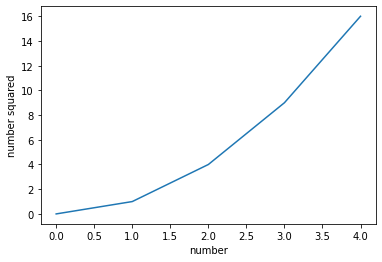

In [67]:
x = [0, 1, 2, 3, 4]
y = [0, 1, 4, 9, 16]
plt.plot(x, y)
plt.xlabel('number')
plt.ylabel('number squared')
plt.show()

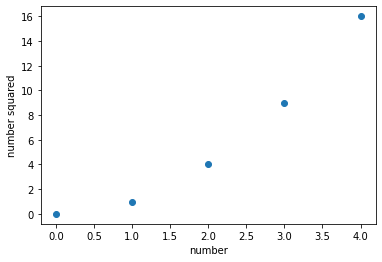

In [68]:
plt.scatter(x, y)
plt.xlabel('number')
plt.ylabel('number squared')
plt.show()

### Pandas
Tools and data structures to organize and analyze data

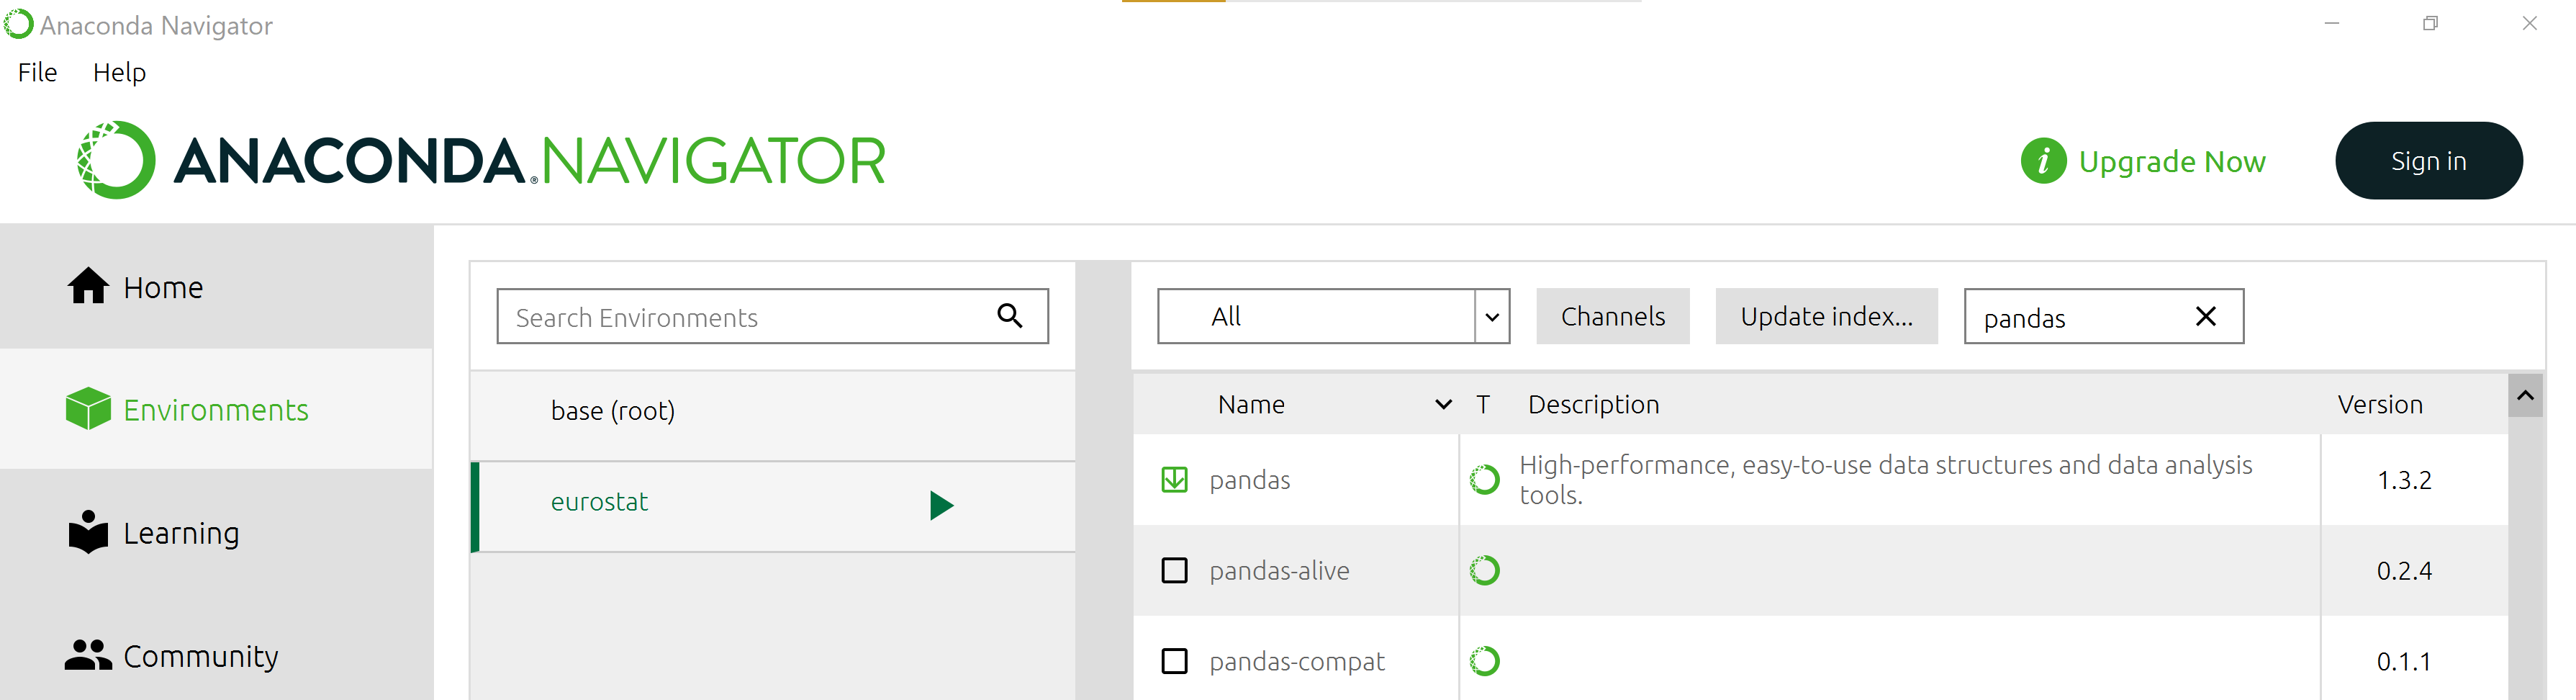

In [69]:
#@title Install Pandas
base64_data = "iVBORw0KGgoAAAANSUhEUgAADfsAAAPMCAYAAABPcYIpAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAALEoAACxKAXd6dE0AAP+lSURBVHhe7N0HfBTVFsfxk4QWegJIh4RQREBqVFBRCUhVpPlUFDvYxY4+e3uoCNglgAWlSO+gEFSkKAEivabQe0LvSd7eyU3ZZHczm2y2JL+v7if33CSzMzszm4Td/xy/VAsBAAAAAAAAAAAwac3oq/QIcF6NHlF6BAAAULRUr15djwAAAAAAAADANn/9EQAAAAAAAAAAAAAAAAAAAAAAAAAAeAhhPwAAAAAAAAAAAAAAAAAAAAAAAAAAPMwv1UKPAQAAAAAAAAAAAAAAAAAAAAAAAACAB9DZDwAAAAAAAAAAAAAAAAAAAAAAAAAADyPsBwAAAAAAAAAAAAAAAAAAAAAAAACAhxH2AwAAAAAAAAAAAAAAAAAAAAAAAADAwwj7AQAAAAAAAAAAAAAAAAAAAAAAAADgYYT9AAAAAAAAAAAAAAAAAAAAAAAAAADwMMJ+AAAAAAAAAAAAAAAAAAAAAAAAAAB4GGE/AAAAAAAAAAAAAAAAAAAAAAAAAAA8jLAfAAAAAAAAAAAAAAAAAAAAAAAAAAAe5pdqoccFovvc1nIh+byuMvUJGyCPN31FVwAAAAAAAAAAAAAAAAAAAAAAAAAAFF0uC/sNXTtEhrQaaoz7LrxRpnb5yxgrM+MnyJfrP9BVTrXLhsr3EXN1BQAAAAAAAAAAAAAAAAAAAAAAAABA0ZLvsN9/fr1Fjp0/LKHlG8roW2YYcx1nNTE+zu6+SkoXK2OM95/ZIwMWdzHGjizuuUmPAAAAAAAAAAAAAAAAAAAAAAAAAAAoGvz1xzz5ZuNHRtBPSQ/6dZ59tfFRuX3eNTI3YbIxrlGmtnxw3TfG2BEVFHx++QO6AgAAAAAAAAAAAAAAAAAAAAAAAACg8Mt3Z7/s0rv6KaWLlZXZ3f8xxuuPRjsd4qPLHwAAAAAAAAAAAAAAAAAAAAAAAACgKMhTZz8V6FMd/GbGT9AzmVRA7+mrXzfG6UG/hJM78tStL2twEAAAAAAAAAAAAAAAAAAAAAAAAACAwipPnf2yh/By68CX39AeHf4AAAAAAAAAAAAAAAAAAAAAAAAAAIWZ6bCfCuwtuC1GivuXsBv2S583E85bfiBK3lr1jK5yR+APAAAAAAAAAAAAAAAAAAAAAAAAAFBY+euPDnWZ09z4ePbSaeNjVj1D7zY+TtoxVqZ1+ct0KO/66hHG1y7quVHPOJbf7oAAAAAAAAAAAAAAAAAAAAAAAAAAAHirXDv7rT2yUl5e8YgU8y8m07uukNLFyujPuNZXG/4nM+J+1pVtraq0lY/bjdEVkBdJEjN1ikQnqnGwhPfrKy2DjE/A7ZIkPipKFsUmSnBYuEREtBR2BQAAAAAAAAAAAAAAAAAAAAAAAIqqXMN+7nTk3CG5+7cOurLNbOdA05JiZOqUaDGyX4S/igDvDPvFR0XKolhdWIR1GigRobowKz5KItMXEtZJBjq9ADfLur4WedpmAAAAAAAAAAAAAAAAAAAAAADgVSIjI/UobwYOHKhHKEyOHUuUf/75Wzp27CglSpTQs865ePGiLF68WK699jqpVClYzxYu/vqjQ4fO7pdBf/SWjrOaGPXdv0UY4yk7fzBqV6kSWFUmdV6iK9vS18FVkhJiddBPSZTYhCQ9BjwndlGUxOsxAAAAAAAAAAAAAAAAAAAAAAAA4MtU0G//gQMyd948I7TnLPU96nvVMtSyCiuHYT8VrFO3/os6SeyJbXpW5D8NHpYrAqtLv/oP6BnXqVyqqvQJG6CrghYva9NavGVIjF5LyApeIFYWRRXyIzG0lXQKS0tRB4eFSyu6+gEAAAAAAAAAAAAAAAAAAAAAUGioDn3O3FC4qY5+wcHBkpiY6HTgLz3op75XLUMtq7ByGParUCJIj6zdEXqPTLh1sa5c7/Gmr+iRbY8s6alH+RQfJ7F6qHZ0mliJI+0HbxC7SAp33i9IQiP6Gj+Q+0a0tFS+KSk+RmKipkpkYQ9nAgAAAAAAAAAAAAAAAAAAAAAA5FGJEiWkR/fuTgf+sgf91DLUsgorv1QLPbZyOeWSFPMvbnT2y2rBbTFS3N89D0j2+85qcc9NepR38VGRsshI+wVLeKcwiV0ULUafv7BOMjCCNmOFU5LETJ0iaQ0dLfu9X19p6QUps6zHYliYSGys7jgZHC79+poMwsVHSWTaQjiG3SUpRqZO4XkDAAAAAAAAAAAAAAAAAAAAAFB0RUZG6lHepHf1S18OXf4KN2fCe0Ut6KfY7ezXZU4L46OfX+aXNKzYxG1Bv4IXL3EZbf3CJCQ0RMIymvvFWT4LeEZwqwgJTz8WE6MlKiZJFwAAAAAAAAAAAAAAAAAAAAAAAIDvMtvhrygG/RSbYb9vN35sfDx+IVEW3b7BGKtOel/fNFkmbM9f2tYZ7177pR7lNGbzCD3Km6SYNZKe9QtrrTqnBUlIZtpP1hCwgscEScuIcMnM+0UJhyMAAAAAAAAAAAAAAAAAAAAAAPBmqiOfMzcUXbkF/opq0E+xGfabGvuj8bHvwhuNjyrop3Sc1URuqdnNGLtDu2q36FFOk3aM0aO8SJKE2EQ9DpN6oWmjoJCwzIBVbILlqwAPCWoprcP0WBIlOiqG4xEAAAAAAAAAAAAAAAAAAAAAAACFgr3AX1EO+il+qRZ6nEGF+pQ3wofLTTU6G+P0ufTgn7uk368teV6XpBiZOiVajLhfWCcZGKHTfpIkMVOnSLTxiWAJ79dXWgYZn7Av67KCw6VfX9Ul0DKdFC9ro9ZIrOXAShccHCZhrVtJy9DcFpomKT5GEuJiJTYp0XKA6kmL9OWEWJZjbklKkmV5CbJ2TawkWRaWZa0sywsyt7ykJIlPWCtrYpOMEyZT5jJy3bYCfLwU9Zipbcy6HMuCJCystbRqGWq5L+f2sWv3gX3xUZGyyGg1mXWd4iUqclFmB8pOAyXjULUlPkoi0xaS7bi2LS/blhQzVaakPXiW3ddP+uZ6gljYXa+s2xcmnQZGiOM19pL9m3V7HMrl/l1xPlltb5bH0HI+RUVZHtv0xVrOtYGWcw0AAAAAAAAAAAAAAAAAAAAAAFeLjIw0Pg50sltf9u/L63Lg27KH+5SiGvRT7Ib9Jnf+Q4JLVZEHo3rI9xFzM+YLQ9gva2Ape4DK6TCTjfDa8aipsigjZWNDWCfpZ7lTu0uOj5Kpi2KzBPLsyBKWcyTJsrwoE8uzHyZLsqxSlONtShccJuEREQ4CTgXweCnZw022WNatU0Qry/2ZCIO5eB/kxnbYz8IqWJZLIC7r1zoK++Vn27LuP1MBPUfhOyfCfmb3b1/L/jUT9svPY2C1Txyxd/8uPJ9shf1sbZtlOwj7AQAAAAAAAAAAAAAAAAAAAMiL9ACWqxDkKnwI+yG/sgb+lKIa9FP89UcrP3X81Qj6dZnTXPacjs8I3H110y/GR9+WJAkZIZswqZctXRQUEiZpGVCRxNgEy1c753hMenAtWMLCw6VTp07SKdyyzPSFKrGLJCrG/pLj47IGdVTXsnAJV8vpZPkYlmVBidEyJSpeF7bFR02VKVbBn7TlGeull5d11XKKl6ipU6yCSUbXs3D1/Wrbwi3Ly7pOsRI9Zao42Dwrrni8jHWcYh0ECw4L049ZJ8s26n1qWbdFUWtzD3hZuHIf5EtohHQK02NR65//+8rXtgWFSOaXxEpcbquTlJClu1yYhNgNrTlgBAxN7t+pbti/FVsZ95txrOppFajLmDdurW1sb8GeT8ZjZSbECAAAAAAAAAAAAAAAAAAAAAAAAK/jZ6uzn6KCfpdTLusqjbu7+iku7+yXa/ezrJ2y1JfY63anWXU6SxNsWW6EjU50WbsGOupkZnR5SwqT8NatpGWojXSUVWcx+93LrO8v2LItEZZtsZW2SpL4mLVyvGKE5f70lMH6sVBhrU4RlnW2tYjsX2tv+1z+eGVfR3ud9tQ2RsmizBW0sP/YuWofmGW3s58hawc8B8dkrsd2mvxum9V+cdRB0MJxp8ys2+WC/ZujW54b9m/W4zmXxyLntrjgfLL6ujAJC4uVWMtqW59T6thPkNCWdPYDAAAAAAAAAAAAAAAAAAAAALgenf2QH1m7+qmOfkr6uCh297PZ2e/s5dM5gn6FherolS4se1s/Q5C0bJ3RSk1ic21dlk1wuM3gmhLUMkLCM5p2OeiKZgSaVPDOZgooW7e3RIlNsNH2KylGojJTRUZYyXbQTwmSUMu6WQf9LOLXWoeNLOtkdxHqcevbz2r71phpR5bfxyvrOtoNgilqG/tmedxy4Yp94DKh0irzgZDYNTGSr3vL57YFtWxtORq02Dixf4ZYd9FsbTMtlwtn9m+El+/fAj+fdNBPhSqtzil17BP0AwAAAAAAAAAAAAAAAAAAAAAA3iV70E+F+9RNjdWc+pz6mqLEZtivdLGyObrmqXpuwmRd+ap4ycz6hYnNrJ8SWs9kmCm7YAmPsBdGUoIkJCwztJV03HZ4RwVz7C8jTWg9x6mmpITYtG5jFsHhEXnoOpckMWuyBCM72eoqll2QtIwItzwKaRJjE3IJpeX38cq2jq1NPG6tMtfPEVfsA1eyCj4mRkuUmSClHfnftlDJ/LSD0GpSgmRm/eqZOH6yK0z71x3nk0VwuETkJVQJAAAAAAAAAAAAAAAAAAAAAADgRraCfqqLn7oV5cCfzbBfx1lNZN3RaCPg1ziouXSo1d2YH7nuHVl2YLEx9jQ/y39Oi4+TzKyfo/CRyTBTdsFhEpJLziaoYuYXJCYe16P8ybkcF3RUk+OW5ephcLi0MpvUCgqRjHxeYqw4bIiW78crD+uYdf1cyFX70r5swa/oKMlH3s8ptrYtaxDOXvfLrIFT2100c1OY9q8bzicLM4FIAAAAAAAAAAAAAAAAAAAAAAC8SWRkpHFD0WEv6JeuKAf+bIb9utTpJS8sf0BumxcuX7SfIK+1/lhunX218bm3Vz1rfHSHjcfW6lFO9135hB6ZF5/Z1i/X8JFVmGlNTO4dtQpMkiTFx0t8fIzEREVJ1NSpMnWq5UlsUea25JC1o5rloK6oh05JOp65zUEVnQgQBUlmPi9RCjQDl+d1dFYe9kFBCGopEZnt/SQ6yhXHZR63Ldful1kCp86E27IqTPvXLedTsATn6WQHAAAAAAAAAAAAAAAAAAAAAABwj9yCfumKauDPZtjvxZbvGx/PXT4r02LHSWpqivx2+3rj5k6Dl92nRzkNaORk2C8pRtZkye7ELkpL/dq9ZQ36mOio5VpJEh8TJVONdZkiUxYtkkWLoiU6NlZiLQen5X/z8hqSOm65Hz0MdjJBVNFyErlFPtYxdy7cBy4U1LJ1ZsguMVrWmu06acUV2xYqrTKChza6X2YJnAaHhbj9GMydm/evW86nrMFAAAAAAAAAAAAAAAAAAAAAAAB8w8CBA61uKLzMBv3SFcXAn82wX1Z9wgZIp9nNpOOsJrLuaLQs7rlJf8a3JCXEZoRtnJcose5K+yXFS1TkFFkUbb2+6qAMDg6TsLBwCe/USTplBK3gcl69D0IlolOWrpOLomx01XPAhdsWFBImGXG/bGm/+LXRevnBEhbiZQk0zjEAAAAAAAAAAAAAAAAAAAAAAAC3cjbol66oBf7shv3KFC8nVwY101Wal1Y8bIT+3MHR/TSs6Ow6JElCepsxi+AwFegxc8sM+yTGJliWUtCSJCZqkaT3FAwOC5dO/dJSyX379rXcIiQioqW0DA2VUDe28EpMPK5H5hzPaIsWLC5vyGaHs+ton3fuAyuhEZKZ94uVRVFm434u3ragEMk4RWLjsoQO4yUu/U7CWktLFzxMhWn/+sL5BAAAAAAAAAAAAAAAAAAAAACAsyIjI526oWhZvHixEdZzJuiXLnvgTy2rsLIb9pvV7W/5sv0kGbLyUT1jrSBDf7PiJ+qRbV/fNFmPTEpKkIysX3C4RESoQI+ZW2vJyFQlxkqBN/eLXyvR6esZ1kn6RrSU0LzkjYIqSsa3WYWwnFAxOKNrmyQddyLomCTHM744SAo0D5endTxuOan10BZX7YMCFhrRKfPYjF0jMWY23uXbFiQhmWk/yWjuFx+XEaYLqxeqR3lQmPavL5xPAAAAAAAAAAAAAAAAAAAAAAAABeTaa6+TGtWrOx30S5ce+FPLUMsqrOyG/dKtPrxCj3J69q/+euQ6F5LPyxfr39dVTn6W/5wVvzZa0vM9wWEhmUG4XIVKq/D0iE6iRK/NU2zOtKTMVI8E59LCK+vX5lTR8v16mDWE5YysXdsSo8X0plsFK4Mta1KAsoYazYYxswTRbHHdPihooRKR0d7PcmxGxUhS1kCZDQWxbUEhYRn3GasPtPj0tn7B4dIqH1m/QrV/feF8AgAAAAAAAAAAAAAAAAAAAAAgDwYOHJivG4qGSpWCpVu3bnkK+qVT36uWoZZVWOUa9nv32i+lmH8xXVnblPivPPp7L13lnwr6dZ/bWle2Leq5UY/Mipf07JFIsISFONcaK2uYKc9d8lwuXtZmtCezJUhats7o+yaxi6LysN5Zu7ZZlrEmxkQ3siSJicoMVoa1bpkZ1ioQoVIvs/WiiTCmZf3WOIqCOSO3feAGoa0kM4saLVFrXbU+TmxbUEvJONSM8yPzfHMuWGuLj+1fhx37fOF8AgAAAAAAAAAAAAAAAAAAAAAAgCflGvaLOfK3TO+6XBb33JRxU9LHo2+ZYdT5tXD3jFyDftdWvUmPnJC101dwmDiZ9VNpv8yOXHntkmdSUMXMlUuMXivxttJASfESNXWRw+5lhqxBMMtXL5oaZXt5hiSJj4mSmGzbFtQywipMNiW3ZURNkYx8VH67upkU2io8SxhzkUyNircdorI8bjFTs6yfHS7dBwUuSFpGZG5/YmxsRjDMloLattCMRJ7l/IhJP9+cD9ba4vX716r7YKIc10NbfOF8AgAAAAAAAAAAAAAAAAAAAAAAgOcEvG2hxzZdU/VG6TqnpYzb9nXGbcCVT8o9v3WUP/f/KhN2RMrXG4Ya83c3fFQC/AL0d5rXcVYTWXFwia7s+7HjfD0yL37tYonTgZrgptdL6+qBaYVpgVLqQrxs3n/OqJL8gqV1vSwhpvMHZfPm/WJ8NrCmNLmquuU7HDgeL2syVijMellBfnJ8TZwOMyVJ3OZ4iT9+QQL9zsvx4wmydu1yWbxskySdC5bw8Bqyf7+d5RgCpfpVwZa7syxPrdw5tbw1sib+uBy/cEL8zmdZ5uI1EmdZVmBYa7FejF5G+jrpZcRblnHggp9lGZZlZV2GXh21Pp36tpPqurTiysdLCawu1f0z98+5pDjZvCbesl4XxC/b46a+JDi8kzQ9H2eM1fbVbHKVWB0SLt0H5h2PT3/8bKyTI9m2P4Ot9Smobcuy3KT07wm7QXpcldvjcVziM9YnWMJa18vZuc4H9u+J+M36/izLi7es24VA49xIWLtWDgbVy3L/BXA+yXk5uDn9/u08hgAAAAAAAAAAAAAAAAAAAAAAAPAJuXb2U9K7+WV1+NwB2Zz4rxw4s1fPiBEKTAvu/a5n7FPfp75W3cywtQ65i5e4jPZcee80FhQSlqW72BqJSQ/huFyoRPTL0slMEiUxNloWLVpkuUVLbKxq82XZjk59pWXFtK9wzLK8vv0kPLM1oWWRsRIbnX2ZjliWMdB6GYnGMtT351xGcFgn6dc3wvJd7hPUsq/0y2xjaJFoWaec2xgc3k/65vrAuXofFDyrjnEOFdS2hUpGcz8trJ7rjgDv3r/W3RVVd7/0cyM61tYThfefTwAAAAAAAAAAAAAAAAAAAAAAAPAMU2E/ZVzHhXqUuzf/eSojyGfvdt/izvqrc5e3oJ9IUswaycz6hUkes34q7SeZ2ZxEiU0osLSfSjZJ34H9pJPlDoOz5pvEUqvgT7++EuFU8keFkfrKwH6djICR9TItS7VMhIWr5Q50sNy0ZfSzsww1ERYeLp0sy+hrWYgnOoupQFjGNuq5NOpx0+vW0uSauXwfFDTL/mmdLW1nTwFtW2irrAG6MHFh1s/g1ftXLc+ybmHZTozg4CCxnRf0/vMJAAAAAAAAAAAAAAAAAAAAAAAA7ueXaqHHudp1KlYeXnK7Eb5TgT13yGvQD0BRFC9RkYt0yDdMOg2kKx4AAAAAAAAAAAAAAAAAAAAAAAB8g+nOfkrdcmGy8LZ/dVXwCPoBcErSccnouxkcbKezHgAAAAAAAAAAAAAAAAAAAAAAAOB9nAr7KcX8ixsfH2/6ivGxILSsch1BPwBOS0qIlUQ9Dg4LkSA9BgAAAAAAAAAAAAAAAAAAAAAAALydX6qFHufJHfOvk9OXTukq/wj5AciTpBiZOiVah/2CJbxfX2lJ2g8AAAAAAAAAAAAAAAAAAAAAAAA+It9hv3TPLRsgG46t0ZVz6pSrJ991mKMrANCSYiQqKlHqRbSS0CD7yb2k+CiJWpTZ1U/COsnAiFBdAAAAAAAAAAAAAAAAAAAAAAAAAN7PZWG/rMZv/1a+3/KFrmzrG3a/PNb0ZV0BgA1W3fpEgoPDJCgoWOrVqyjHj8dJYmKSJMUmZob8lOBw6de3pdDUDwAAAAAAAAAAAAAAAAAAAAAAAL6kQMJ+AOAS2cJ+uQkO6yQREaEE/QAAAAAAAAAAAAAAAAAAAAAAAOBzCPsB8HJJkhSfIGvjYiUpKVESrdv4SXBwkASF1ZNWLQn5AQAAAAAAAAAAAAAAAAAAAAAAwHcR9gMAAAAAAAAAAAAAAAAAAAAAAAAAwMP89UcAAAAAAAAAAAAAAAAAAAAAAAAAAOAhhP0AAAAAAAAAAAAAAAAAAAAAAAAAAPAwwn4AAAAAAAAAAAAAAAAAAAAAAAAAAHgYYT8AAAAAAAAAAAAAAAAAAAAAAAAAADyMsB8AAAAAAAAAAAAAAAAAAAAAAAAAAB5G2A8AAAAAAAAAAAAAAAAAAAAAAAAAAA8j7AcAAAAAAAAAAAAAAAAAAAAAAAAAgIcR9gMAAAAAAAAAAAAAAAAAAAAAAAAAwMMI+wEAAAAAAAAAAAAAAAAAAAAAAAAA4GGE/QAAAAAAAAAAAAAAAAAAAAAAAAAA8DDCfgAAAAAAAAAAAAAAAAAAAAAAAAAAeBhhPwAAAAAAAAAAAAAAAAAAAAAAAAAAPIywHwAAAAAAAAAAAAAAAAAAAAAAAAAAHkbYDwAAAAAAAAAAAAAAAAAAAAAAAAAADyPsBwAAAAAAAAAAAAAAAAAAAAAAAACAhxH2AwAAAAAAAAAAAAAAAAAAAAAAAADAwwj7AQAAAAAAAAAAAAAAAAAAAAAAAADgYYT9AAAAAAAAAAAAAAAAAAAAAAAAAADwMMJ+AAAAAAAAAAAAAAAAAAAAAAAAAAB4GGE/AAAAAAAAAAAAAAAAAAAAAAAAAAA8jLAfAAAAAAAAAAAAAAAAAAAAAAAAAAAeRtgPAAAAAAAAAAAAAAAAAAAAAAAAAAAPI+wHAAAAAAAAAAAAAAAAAAAAAAAAAICHEfYDAAAAAAAAAAAAAAAAAAAAAAAAAMDDCPsBAAAAAAAAAAAAAAAAAAAAAAAAAOBhhP0AAAAAAAAAAAAAAAAAAAAAAAAAAPAwwn4AAAAAAAAAAAAAAAAAAAAAAAAAAHgYYT8AAAAAAAAAAAAAAAAAAAAAAAAAADys8Ib9do6Udn5+4ufXTkbu1HMofNjPAAAAAAAAAAAAAAAAAAAAAAAAAAoBOvsBAAAAAAAAAAAAAAAAAAAAAAAAAOBhPhv2WzBIdXOz3AYt0DMAAAAAAAAAAAAAAAAAAAAAAAAAAPgm94b9FgxKC+g5fRskVpG+nSPlvUg9jnxPRu7UY+TTThnZTj/meQpR5vf7AQAAAAAAAAAAAAAAAAAAAAAAAKBo8tnOfgAAAAAAAAAAAAAAAAAAAAAAAAAAFBYeCvu1lRE7UiU11extlHTV32moP1jeGKjHA9+QwfX1GAAAAAAAAAAAAAAAAAAAAAAAAAAAH+Sznf26jtJBwFFWMUAAAAAAAAAAAAAAAAAAAAAAAAAAAHyOz4b9AAAAAAAAAAAAAAAAAAAAAAAAAAAoLAj7AQAAAAAAAAAAAAAAAAAAAAAAAADgYT4b9lswyE/8/Cy3QQv0jCvslJHt9HKtboPElfcCaxn70urWTkbu1F/gKjtHSrsc95P1xn4GAAAAAAAAAAAAAAAAAAAAAAAA4Bl09tPSAmcN5LmVesJKpHRTYTCXBguxc2Q7I2TXLVJPWFkpzzWwPObtRkr+M38LZJDafw2esyzVEb2fCf0BAAAAAAAAAAAAAAAAAAAAAAAAcDPCfrqbX0bgbOB8SU1NtbrNH6g/F9mNwJ+LqHBlg/RkZdsRsiPbY75jRNu0z618Thq4JPCXZuB86/vJesu4Tx36Y1cDAAAAAAAAAAAAAAAAAAAAAAAAcJciH/bbOXJARjc/Iwg2qmtakUXXUVmCYJHdCIHl14JBGeHKtiN2SOqKwVI/rcxQf/AKSU1PWa58TgaMdFXczz7jPlN3SOaubiduuFsAAAAAAAAAAAAAAAAAAAAAAAAAKOJhv50jZYBO+qnQmY2cX4b6g8dlhsDec12nuaJngQxKT/oNnC8rBmeP+WXRdVRGV8WVz31i+U53qC+DV8yXtLtdKc99QrITAAAAAAAAAAAAAAAAAAAAAAAAQMHzUNhvpTzXwE/8/EzcCrCN3s65ky1rYtF2hIxzFDoz1JfBb6QnzybL3MKe9ovsZnt/OLw1yOiSaNeCmZIW9Rso8x2lK7WuL42QtIxlpMx0W+6uq4xKTxlGvkd3PwAAAAAAAAAAAAAAAAAAAAAAAAAFrgh39tspcyfrrn539pDcon6GBo118GylbNlhDOCkBTPTu/rdIblH/SzqN5JmerhhmxtTd13vyOjuN7nQJzsBAAAAAAAAAAAAAAAAAAAAAAAAeJqHwn5tZcSOVElNNXEz0f0tb3bIFt2FrlkjU1E/zwXPPGHgfNv7w+Fth4xIS0PasVO2bUgbtW3cIG2QqwbSWC9zpVsTlp66XwAAAAAAAAAAAAAAAAAAAAAAAABFUdHt7Ldzm+jcmUR28xM/PzO3bqL70iFPMgOWK59rYOPxtXVrIM/p73Gv+tIoM9kp9PYDAAAAAAAAAAAAAAAAAAAAAAAAUJCKbtgPAAAAAAAAAAAAAAAAAAAAAAAAAAAvQdjPYuD8VElNde62YnB9/d3Ii7Yjdth8XB3eRnXV3w0AAAAAAAAAAAAAAAAAAAAAAAAAhUvRDfvVbyTN9BDu0kAat9VDX9KskRDtBAAAAAAAAAAAAAAAAAAAAAAAAFCQinBnv8zgWeTMBWkDFLD60kgnLFdOnis704ZeaoHMjEwbtW3cIG0AAAAAAAAAAAAAAAAAAAAAAAAAAAWkCIf9MoNnEjlTiPu5R4P0hOXKyTLXm9N+C2ZKWtavrdzZg75+AAAAAAAAAAAAAAAAAAAAAAAAAApWEQ77iXR9aYSkRc8i5b2R3t1nrrCoP/gNGWiMVspzn3hrxHKnjHwvva3fnULWDwAAAAAAAAAAAAAAAAAAAAAAAEBBKwJhv5WyZYceZld/sLyRljyTlc81kEG093ODrvLSCN3dL7KbtHNZyNLBfs4icmbuO3nnyAHy3Mq08cA3BgtZPwAAAAAAAAAAAAAAAAAAAAAAAAAFrfCG/er3kDszMmXtxF6mrOuoHZKZPfMTv3YjxV78bOfIdg4/D3PqD14h87OELP38BondCN6CQY4/b3I/Z4jsZlmen52Q4QIZZPlcA530aztih4zqagwBAAAAAAAAAAAAAAAAAAAAAAAAoEAV4s5+9WVwets+WSnPNbAX5LN83YrUjPCZrHxOGvhZvtbGzQiBrdwiJhrIIRddR6XKjvSUpURKNxuPt3HrFmn5/AbZZjfEZ3Y/W0sLGWa7L79uljVJM3B+qqwYTE8/AAAAAAAAAAAAAAAAAAAAAAAAAO5RiMN+Fl1HSWrqfEmPgkmzRmIvvqXCZ6mpWUJ/NqhOb6mpo4Rmb66hOvypxzwz9GfDwPmWr1khDnN3TuxnFeJzdJ9p+ziVjn4AAAAAAAAAAAAAAAAAAAAAAAAA3MovVSWbgEJtgQzSXftU2I8gHwAAAAAAAAAAAAAAAAAAAAAAAABvU7g7+wEAAAAAAAAAAAAAAAAAAAAAAAAA4AMI+wEAAAAAAAAAAAAAAAAAAAAAAAAA4GGE/QAAAAAAAAAAAAAAAAAAAAAAAAAA8DDCfgAAAAAAAAAAAAAAAAAAAAAAAAAAeBhhPwAAAAAAAAAAAAAAAAAAAAAAAAAAPIywHwAAAAAAAAAAAAAAAAAAAAAAAAAAHuaXaqHHAAAAAAAAAAAAAAAAAAAAAAAAAADAA+jsBwAAAAAAAAAAAAAAAAAAAAAAAACAhxH2AwAAAAAAAAAAAAAAAAAAAAAAAADAwwj7AQAAAAAAAAAAAAAAAAAAAAAAAADgYYT9AAAAAAAAAAAAAAAAAAAAAAAAAADwMMJ+AAAAAAAAAAAAAAAAAAAAAAAAAAB4GGE/AAAAAAAAAAAAAAAAAAAAAAAAAAA8jLAfAAAAAAAAAAAAAAAAAAAAAAAAAAAeRtgPAAAAAAAAAAAAAAAAAAAAAAAAAAAPI+wHAAAAAAAAAAAAAAAAAAAAAAAAAICHEfYDAAAAAAAAAAAAAAAAAAAAAAAAAMDDCPsBAAAAAAAAAAAAAAAAAAAAAAAAAOBhhP0AAAAAAAAAAAAAAAAAAAAAAAAAAPAwwn4AAAAAAAAAAAAAAAAAAAAAAAAAAHgYYT8AAAAAAAAAAAAAAAAAAAAAAAAAADyMsB8AAAAAAAAAAAAAAAAAAAAAAAAAAB5G2A8AAAAAAAAAAAAAAAAAAAAAAAAAAA8j7AcAAAAAAAAAAAAAAAAAAAAAAAAAgIcR9gMAAAAAAAAAAAAAAAAAAAAAAAAAwMMI+wEAAAAAAAAAAAAAAAAAAAAAAAAA4GGE/QAAAAAAAAAAAAAAAAAAAAAAAAAA8DDCfgAAAAAAAAAAAAAAAAAAAAAAAAAAeBhhPwAAAAAAAAAAAAAAAAAAAAAAAAAAPIywHwAAAAAAAAAAAAAAAAAAAAAAAAAAHkbYDwAAAAAAAAAAAAAAAAAAAAAAAAAADyPsBwAAAAAAAAAAAAAAAAAAAAAAAACAhxH2AwAAAAAAAAAAAAAAAAAAAAAAAADAwwj7AQAAAAAAAAAAAAAAAAAAAAAAAADgYYT9AAAAAAAAAAAAAAAAAAAAAAAAAADwMMJ+AAAAAAAAAAAAAAAAAAAAAAAAAAB4GGE/AAAAAAAAAAAAAAAAAAAAAAAAAAA8jLAfAAAAAAAAAAAAAAAAAAAAAAAAAAAeRtgPAAAAAAAAAAAAAAAAAAAAAAAAAAAPI+wHAAAAAAAAAAAAAAAAAAAAAAAAAICHEfYDAAAAAAAAAAAAAAAAAAAAAAAAAMDDCPsBAAAAAAAAAAAAAAAAAAAAAAAAAOBhhP0AAAAAAAAAAAAAAAAAAAAAAAAAAPAwwn4AAAAAAAAAAAAAAAAAAAAAAAAAAHgYYT8AAAAAAAAAAAAAAAAAAAAAAAAAADyMsB8AAAAAAAAAAAAAAAAAAAAAAAAAAB5G2A8AAAAAAAAAAAAAAAAAAAAAAAAAAA8j7AcAAAAAAAAAAAAAAAAAAAAAAAAAgIcR9gMAAAAAAAAAAAAAAAAAAAAAAAAAwMMI+wEAAAAAAAAAAAAAAAAAAAAAAAAA4GGE/QAAAAAAAAAAAAAAAAAAAAAAAAAA8DDCfgAAAAAAAAAAAAAAAAAAAAAAAAAAeBhhPwAAAAAAAAAAAAAAAAAAAAAAAAAAPMwv1UKPAbc4n3xezl0+I2fV7VLaRz8/PwksVkZKZ7mVDCipvwMAAAAAAAAAAAAAAAAAAAAAAAAACjfCfnCb5NRk+WrDJzI19mc941hx/+JSo0xtqVM2VOqUC7HcLB8t4/oVriQICAAAAAAAAAAAAAAAAAAAAAAAAKBQIewHt1u6f7EMXfuGnL50Ss84R4UArwpuLq2qXCOtq1wrVwU1l2L+xfRnAQAAAAAAAAAAAAAAAAAAAAAAnJOSkiK79u6VHXHxstNy2xEfL/G798jJU6fk9JkzlttZOXP2jJyxfLx46ZL+LqBglCheXMqUKS1lSpeRspaPZcuUkfLlyklondrSIDRUGtSrJ/XrhUjdWrXE399ffxcKA8J+yLMLyRcst3NSvkRFPWPewbP75O1VL8nmpPV6Ju9KBQTKNVXbya21b5e21dobYUAAAAAAAAAAAAAAAAAAAAAAAAB7zp0/L3+vWSt/rfxblv79j6zbuEkuXLyoPwv4hpIlSkjzpk2k/XXXyo1tr5PrWreSwFKl9Gfhiwj7wWn7zuyRmfG/yLL9S2RshylSulgZ/Zk0UXsXyKpDy+XZ5q/m+FxWl1Muy4h178uchKl6Jv/Kl6ggHWp2kc51bpcmwc31LAAAAAAAAAAAAAAAAAAAAAAAKOoOHDosk2fNlgVRS2TNuvWE+1DoqPBf6+ZXS9eIDnJnz9uletUr9GfgKwj7wZSU1BT5+9BfMiNuohHkS7X89+hVz8p9jR7VX5HmUsoluXdRDzlwdp/UKFNL3mjzUa6hu5+2jZYxmz83lulKDSo2lgGNBkr7Gh3Fz/IfAAAAAAAAAAAAAAAAAAAAAAAoWs6ePSezFv4qk2bMNDr4JScn688AhVtAQIDR8e+uXndIzy6dpXTpQP0ZeDPCfsiV6tQ3evNnsv/MXj2jOuhVlMmdf83RuW/yznHy5YaPdSXi7+cv9zUaKA9c+bgE+AXo2ZwW7ZkrQ9e+YYQFXS2kXJgRSoyo1c1YHwAAAAAAAAAAAAAAAAAAAAAAULjt3b9fRnw7WsZPn24E/oCiTAX9+vfuLc899qjUqlFDz8IbEfaDXTuOb5HP1g+V9cfW6JlMj1z1jNE1L6vTl07JXb91kZMXT+iZTC0rh8vb1wyToJKV9ExOMUej5bW/n5Yzl07rGdeqWaaOPNXsJbm++i16BgAAAAAAAAAAAAAAAAAAAAAAFCZxu3bJsK++lV9mzpJLly/rWQBKieLF5c6et8uLTz4m9erW1bPwJoT9kMPxC0lGJ795u6ZLSmqKns1U3L+4TOuyRCqWDNIzadT3/LRttK5yqlzqCnn32uHSNLiFnslpx4mt8uLygZJ0IVHPuN711W6WZ5u/KtVK19QzAAAAAAAAAAAAAAAAAAAAAADAl+07eFDe+miYTJs7T5KTk/UsAFsCAgKkT4/u8s4rL0rNatX0LLwBYT9YOXExSYb/+76sPrxSTl06qWetdazdXd5s85Gu0qhufH0XdpQzlx135SvmX0yeavay9K53j57JaffpBHloSR+5mHxBz7heqYBScl+jQXJXgweM8CIAAAAAAAAAAAAAAAAAAAAAAPA9l5OT5csx38lHX3wlZ86e1bMAzChTurQMeeYpefLhB6VYQICehScR9oNd+87sli2JGyTmaLQR/jtwdp8x/1X7n6RZpZbGON347WNl1KYRunKsW91eMqTVe7qylmr5b1jMOzInYaqeKVj1KzSSd68ZLrXK0noUAAAAAAAAAAAAAAAAAAAAAABfsnxVtDz/xtuyZccOPQMgLxo3aCDD33tbrr8mXM/AUwj7wbT9Z/bKpsR/pVPtHnomzaWUi9Lv11sl8fxRPWPf9dVulg+u+1z8/fz1TCZ3B/3SlS5WRl5u+Y50qNVFzwAAAAAAAAAAAAAAAAAAAAAAAG918dIlee39D2X0zxOEWAzgGn5+fvLovffIh6+/JiWKF9ezcDfCfsg3Fc77JOZtXdmnugEOv36MlAwoqWesfb7+fzI1dryu3K9n6J3yzNVDpLh/CT0DAAAAAAAAAAAAAAAAAAAAAAC8ScLuPXLfU8/Iuo2b9AwAV2rRtKmM+/IzCalTW8/AnQj7FXEpqSk2u+w54+zlM7Jw9yyZHjdRdp+K17PWQsvXly/bj5NyxcvrGWtjt3wpP279Vlee0ziomXzc7mupUCJIzwAAAAAAAAAAAAAAAAAAAAAAAG8wc8FCeWrIf+XkqVN6BkBBKF+unHz10YfSs0tnPQN3IexXxM3bNV0iN30m9Ss0srrVLReWpxDg6sMrZVrcBFl58E8jSKgEl6oso26aKFVLVzfq7H7Z+aN8teETXXle7bIh8un1kVKtdA09AwAAAAAAAAAAAAAAAAAAAAAAPOnNjz6RzyLHCDEYwD38/Pzk2YGPyLuvvKRn4A6E/Yq4KTt/ki82fKSrTKoDX/PKbaRVlWstt2uMznx+lv/MOnh2n8yM+0UW7Z0nH1z7mVwZ1FR/xpoKG3609k1deY/Kpa6QT68fZdnuBnoGAAAAAAAAAAAAAAAAAAAAAAC4m4q9PPbSKzJx+kw9A8Cd7unTS775eKgR/kPBI+xXhJxPPi+lAkrpKs24baNkzOYvdGWf6nY3vtNcXbnG7/t+lXeiX8roAOhtVODx43bfSJPg5noGAAAAAAAAAAAAAAAAAAAAAAC4i4q8vPLeB/LtD+P0DABPePzB+2Xo668R+HMDf/0RhdyuU3EyZvPnusp09tIZPXLsquBmepTpUspFSbX8lxc7T2yT91cP8dqgn3Lq0kl5acVjEn9yh54BAAAAAAAAAAAAAAAAAAAAAADuoIJ+T7zyGkE/wAt88/2PxvlIz7mCR2e/IuDY+SPy+J/9pVmlVvJGm6F6Ns2Ide/LjLhJurLvg+s+kxurR+gqzbTY8ZbvnSh31LtbutbtKWWKldWfyd3ivfMl8fxRKVUsUEoFBBon+4Xkc3JO3S6flUNnD8jeM7tl7+ldxvp7UpXAK+Tr9uOlaunqegYAAAAAAAAAAAAAAAAAAAAAABQUlTF48pXX5Oep0/QMAG9wb78+8tXQD+nwV4AI+xVyKjj31F/3y47jW6RDrS7ydvgw/Zk0Q9e+IfN3zdCVbSqMN6f7MikZUFLPpFFd7/45tMwYBxYrLbfW7iG9690joeXrG3Ouojrs/Xs0WtYeWWW5/SPxJ3fqz7hPnXKh8nX7n6R8iYp6BgAAAAAAAAAAAAAAAAAAAAAAuJqKuQx57wP5ho5+gFd6/IEBMvSN/xL4KyD++iMKoeTUZHlz1fNG0E+5nHLZ+JhVgF+AHtnX+orrcgT9ziefl5ij0bpKCxXOip8sH8e8JbtPxetZ1yhXvLzRVfDZq1+VHyNmyoRO8+SBKx+XGmVq6a8oeGqbXln5pFxKuahnAAAAAAAAAAAAAAAAAAAAAACAqz320isE/QAvps7Px18eoiu4GmG/QmxYzDsZnfcUFf7Lrph/MT2yr2XlcD3KpDrsXUy+YIzVMjrW6iajbp4o39w03uiCV5Bqla0rDzV+UibdulBG3jBWWle5Tn+mYG1KXCdfbbDujAgAAAAAAAAAAAAAAAAAAAAAAFzjzY8+kYnTZ+oKgLeaMG2Gcb7C9Qj7FVILd8+Webum6ypNso3OfsX8i+uRfbbCfn8fXCp+lv861OoiP3ecK2+GfyyNg5rpz7pPqyrXyogbxhghw2ur3qBnC870uAny5/5FugIAAAAAAAAAAAAAAAAAAAAAAK4wc8FC+SxyjK4AeDt1vs5a+Kuu4Cp+qRZ6jELi6PnDMmBxTzl96ZSeSdPmirYy/PrRukrzzcZPZeKO73WVU7ni5WVO92Xi72edC/1wzX+lV727PBLwc2T5gd/ls/X/k4Nn9+sZ1ytTvKx812GaVC9dU88ULRcvXZKDR45IUIUKUq5MGT3refsOHpLLyclSqmQJqVq5sp5Ffql9rVSrUsX4WFgdO35cjhxLlNNnz8rpM2dF/WgsHRgoZUoHSrDlWK9+RRXx8/PTX+3b1Lalb6e/v5+UtZzHZSzb6s2STp6Uk6dOG+MaVa+Q4sVy70oLFDXjt38rM+LGy6WUS0b9Yov35MYanYyxt0q1/Hf03GFJTk27IIW6kESVwKqW3zsDjNobLNk7X77d+JFcTLkgraq0lf+2GSYBXrR+hVHShWNyIfm8rkQCAwKlQslgXXmPxPNHZFPiv7LndLzlliAHzu4x/v46d/mM5Wb5GWv5+6lUQGkpVSxQKpYIkhpl6lhutSW0fANpEtxKyhYvp5fke85YtvONVU9L7Imtxt+LL7X8QJrbuECMK5y9fFpOXjyhK+9SulgZKV+ioq4KzsGz+2RL0jrZe3qX5ZZgqfda9sFpy2NjOdaSz0px/xLGuqhbcKnKUrtsqNQqEyL1KjSShhWbeN1zVnJqsuW5/5DxM6AgqJ8lFS3PGSUDSukZAAAAAAAAAAAAOOtyymXjtU8lsFgZKebPe3UAAO4Rv3u33HhbLzl5yjoHAcC7lS9XTpbNmSkhdWrrGeQXYb9C6JWVT8jKg0t1lUl16PvsRutg3+rDK2VT4jopFVBKShYLTPtouak31apavTE1tHx9/dW+4Xzyeflhy9cyaecPkpKaomdd68qgpvJ1+5+L3B+xh44elWt7/UcOHD4igaVKyuzR30j7a9roz3pGSkqKdL7/EVm6arVRBwT4y8TPPpWenSKM2ltcuHjRCCQ6esotWaKE1KpeTVeeN+i1t+SHaTOM8WP3/Ec+e+u/xtjXqeP4j7+jLcdMtGzcvkO2xyVI4gnHbyJX+6ZuzRrSuH6YtGvVQq5v01paNbnKON68VXJyiqzdtFmWRa+WzTtjZXt8guyI32Vsa/bjUG1HleBK0jA0RBrVC5GmjRrKTZZzW22vp42dPE2efvs9Y3sUdW6rc9zbHvu9Bw4a57k9Kiyqzu8SxXPvqJuVCmYePnrM4XNHXqj1KFOmtBHaLuzhyf8OG2k551dJxQrl5bM3X5P6devozxQeh88dkHt+66irNKUsv8t92X6ihJRvoGe8i3ph4IXlD1h+D43RM2lqlqkrn9/4s1eEu1SQ5u7fIoxgU7o3w0dI+xq36so1Yk9sk3ejB8ux82kB+3TXVm0vr7cZZnn+8K1m7Cog+fXG/8n5y+f0jEjxgBLSN2yA9G/4mJ6xbfi/b8n8XVN1lalf/QdkUJOXdOUZqZa/K9YfWyN/7f9N1h79W3afitOfcZ4KI6kgltrHHWp289rz1J7vtnwmE7ZH6kqMQNlXN/1ibJcrRe2dKx+tfc3yN12ynvE+91/5lNzX6HFduYZ6flxzZIUsPxAlMZZj7cCZvfozzlMBwKsrt5HwK26Um2p0NkJwnqRCsk8tvdv4uVXQShcrK5VKVZGqpWtImyuul7bVbjZ+xgAAAAAAAAAAACCNujhj3Iltsu5YtCSc3GlceHLvmV1y8mKS8ZpVVup9kuVLBEmtMnWlVtkQCSlfX5pXukbqVWjo8tcJAQBFl2pIE9HnTlm3cZOeAeBLWjRtKoun/eL0e6VhG2G/Qmbh7llG172sgkpWkhaV28jNNW+VW2p21rOFnwoyvrf6FUm6kKhnXOuJpi/KXQ0e0FXRoAITw0Z/pyuR1k2byIppE3XlGVtj46R5tzt0lUb9gJg56kuJuL6tnvEsFS5r1/ceIwyUmz5dbpUJnw3Tleeox7VF914ZASMVVFo9e6o0behbb0ZPpwKqE2bPlYmz58mGbdv1bP5UCQ6SXp07yX96dJMb2rTSs56lwmbzfv9TJs2ZL3/8/Y+c0N3w8kp1yex0Q1u55/Yeckvba8Xf3/2Bkxvv7C+r1m3QVZr7et0uo//3ntd0W3zyzXdlzC85wynZhdWtI0t/+VkqB5nrArRuy1bpPOARo7NhQapYvpw0CKkrjeqFytVXNpL214RL88aNPLK/XS1q+Urp9tAgXYmxbYt+GqurwmPtkZXy8opHdJVJdRH76qbJRuctb7M1aYM8tfQuXVkb3Pwt6RFyp648Z1rsOPlm40e6SnNVcAv5/MbxunINdR/qvmz54Lqv5dqqN+nK+6mOfCp4euJikp7JpLqPLbjNOtyZlfqePgtu0JU19eLQvNvWSAn/knrGfY6cOySz4ycawbOCCiipsF+v0P7Sqc7tHtlGZ5xPPid3/9pBTl2y/tk0/IYf5epKrr0IyOBl98nGY2t15Z3UhXLm9Vijq/xRXSJnWY613/ctkBMF8Des6poafsUN0rVub7m+WgePBIl/2PqF/LztW125n+p62LlOL7mj3j1GKB4AAAAAAAAAAKCoUSG+VYf/kt/3zjfea2DrtV1nVCgRJK2qtJVbanWTa664kQ6AAIB8efGtdyTyJ9e+NwuAew28r78Me+ctXSE/CPsVIkfOHZb7o3pKcf/i0qJyuHFrVeUaqVuunv6Kokd1SHlr1YtGFw5XCyxWWn7uOFeqBF6hZwq3U2fOSNhNnXKEhxb+MNoIAXnKph07pVWP3rrKVCYwUOZ/HynXtWyuZzxHhcwefOk1XeXu/NZ1Hg8xZe3ql04Fvr7/5ENd+YaVMf/Kx6PGysI//zK6QBaU5o2vlBceeVD6du3skY5ze/YfkE/H/iATLcfa8ZMF07q8RtUr5IE+veSp+/tLpYrmwmqu0Lb3XUaHwuyeHNBfhv/3FV15VumrWmR0HsyNOofUuWTGKx99KiO/+1FX7hVcoYLc2v56Y107Xt/Oq7tYOtL1wYGyZMXfukqzfOoEadOsqa4KB3thP0UFO1RgTIU8vIkK8Kggjy2PN31F+oQN0JVnJKcmy4DFXeTQ2f16JpMK+6nQn6v8vm++fLDadte6llWuk0/a+U5AVXXlU935bGlX7RZ599ovdZWTCtXd/VsHXeU0p3u08fu3uxw8u1cm7hgjv+6ekeOqlQVFXaSlX/0HpVe9/kY40hupMNoX69/XVaZ21TpY9u8XunKNp5feLVuS1uvKO6nn1t9uz986xp/cLuO3R8qf+xYaV091h7rlwqR/w0FyU80uEuDGnw/PL39A1h+N1pXnqHOtf6PHpHvdvl57rgEAAAAAAAAAALiSej12auwPsnjPnHwH/OxRwb+OtW+TvmEPSJXAqnoWAABzlq+Klm5335vRpASAb1IZiAWTxku7cNdeOL4o8v2WLchw/GKifNX+J5nVbam8c82n0qveXUU66KdUKlVFRtwwWm6q0UnPuM65y2flq40f66rw+27yNJtdwj6O9M43oJ85d056DnxC1m/dpmc85/LlZD0yx9NBv4NH0rrgZTd53gLZvT9n6MEbrVgbIx3vfVBuvmuAzP/9zwIN+imqA9uAF16RVrf1lt9X/qNnC54K+T3237elcafu8s3PEwss6KfsP3RYPvx6lDS4ubMRQjt2/Lj+jGd8NW68vPPZV7ryLLNBP8WZ54PLl90TLrEl8cQJo0Pk7Y8+ISHtI4zH2tP73Fn/bt6aI+inDB/zgx4VDdGHl8n3W1wbwCkKlu1fZDPop9jrwpdXN1a/1e4LHTFH/pbYE57/XcaM1NQUmRprP6CsQmy+QHUnHLt5pDwQ1V3mJUxxW9BPSbpwTCI3DZOHltwmyw9E6VnvkZKabDn+be/jlQd/l31ndukKZpy8eNwIxz76ey/5Y98CtwX9lF2nYuXDNS/LE3/2k82J/+rZokOda1+u/8B47NVjAQAAAAAAAAAAUFgdPnfAeE3qvsWdjde6Cyrop6hlq/tQ9zVi3dvGfQMAYMbl5GR5/o23CfoBhYA6j9X5rM5r5A9hv0KkQYUrJbR8fV0hnbpSvwo/3h56p55xnSV7F8raI+4L9njKpcuX5fMff9aVNRWksNV1yxuo4FO3hwbJzl279QzM+OLH8XLx0iVdZVI/dIeP9UyXMbOOJCbJo6++IR3ueUD+inZ9R8/cbI2Nky4PPCr3PPuiJJ08qWddT52TH48aI1d36ynfT51u1O6igrSq21yzzrfL2MnTPPrHlQofeqrzXVFy+Ogx47FueEsXefWT4TaD397o0zHf6ZG1mYsWS/yevboqGibuGC1/7v9VV8iNCtxMibUfCl16YJEcPLtPV/lXzL+Y3BHaX1c52QtXeZvow8tl96k4XVlrVLGpNK3USlfea/XhFfLwktuNc8adIb/sDpzZK2+tekY+WvuacYERb7Hi4O+y/8weXVlT58302J905RrFA0rqkfdSXfWdpR6rRXtmG4FS1Q3Tk1SY+Jm/+hsv8J69fEbPFh17TyfIU0vvkmUHFusZAAAAAAAAAACAwuFyyiUZv32UPBjVw3hNStXuou5LXVhV3bdaB3feNwDAN3055jvZsmOHrgD4us3bt8tXY7/XFfKKsF8Rot68tyvbG3B3nNgqQ9e+IW+tekFeXvG4PLX0fnnk9zvl3kU95Pd9hedN4f5+/vJiizeNboeu9vn6ocYbNgsz1dFt74GDusppWKTtQIU3OHIs0QhfOVp/ZDp15oyMnjRZVzn9OG2GHE3yzu5ec5f8Ic279pRx02d5/Ooe0xb+Jtf1+o/EbNqiZ1xnw7btEt6zn7wx/HM5e+68nnU/1eXtiTfeMYKVnuz4qLoMfjdluq5QkE6fPWt0xWvW5Xab3T+9ya59+43z0BbViXHk967tzOYLPl77msSf3K4rOLLpWIxsTdqgq5xUB7sZcbYvgpBX3UL6SamAQF1ZW7JvniSeP6Ir7+Wo42G/+g+In+U/b5Wcmizfb/lchqx81KkgZ8mAUtLminZyV4NH5JVWH8pnN/4sYzrMkgm3LpafO/0mo26eJh9e960MbPKidKjVXcoVL6+/05xFe2bJE3/e6TXdHafsdNwZdeHuGXLq4gld5d9d9R+2e154i//Uf0iPzDmffM7yfPxf+Wjtq0ZnP2eo461+hcbGsXSn5X4fbPy0PN70FXnkquelf8NB0iPkTmlR+RoJLllZf4d56gXex//o5zOdRF1JBWrfXvWs/LLDOzvWAwAAAAAAAAAAOEu93v3I73cYr4FeSPbce4vUfat1ePT3Xg5fgwcAFG17DxyQj774SlcACouhn38p+w6S38gPv1T6nRZah84ekA2JMbLhWIxstNxiT243uv+NviUzyLM1aZMM/OM/usrUv+EjMqjJYF0VHimpKfJO9EsuDzJ+eN3nckP1DroqfFrf1kc2brd/xQR/f3/ZuHC2hNWto2fcZ9OOndKqR29d2dcwNESWjP9BqlQK1jPuo8JnqtucWRe2rdcj91Nd0lR4ypHXnhgkbz37pK48T3W1e/Xj4fKFne6TnlSyRAkZ8car8vCdffRM/qhOes+/P1TOX7igZ7xDUPnyMuaj96VHh5v1jOu07X1Xrt1D1XPQT8M/kr5dO+sZ9yrZ6Go9yt3o/70nA3r31JVjL3zwkXw5bryuvE/n9jfIdx9/KJWDKuoZ7/Gc5Tz5+qcJusqpdGAp2fnHb1Kpovete16sPbJSXl7xiK7sq16mlnzdfrKUK1FBz3jOxmNrZfCy+3RlTYVX+oQN0JX7qY5qyw9E6cq2wGKlZdKtS6RM8XJ6Jv++XP+BzIy3fdz2b/iYEezxVipIql6gsaVq6RoyruNCCfAL0DO2HTl3SO7+zf7v03O6RxuPu6udunRS3ln1rPx7dJWecUyFz26u2UUiat8mTYNbGl3EzVLdAtcdWyXL9i82OoklXTimP+OYuo/Hm74st4Xe5bHQ5Jak9fL00rt1Zd/DVw2Wuxs8qqv8u5RyMV8d5xbvmSPfbPxIV9Y61e4pjzV9SVfOK+Ff0qljUnVsfP2fJ2TXqVg9kzvVFfOGGh2lReVrpWHFJrmeR+kOnztgHNPRh5YZz2cXU8z97qiOtedbvG08NgXh+eUPyPqj0bqyViWwqtxY/VZd5Z0KVB47f8R4DBJO7nDqwjyvtv5IImr10BUAAAAAAAAAAIDvURdpHb35U+O1SW9SzL+YPHrVCx59LwAAwDs98tyLMnnWbF0BKEzu7Hm7jBkxTFdwFmG/QkQF2TYmxsjv+36TZQeWGGG/7EoXKyMLb/tHVyJnLp+WrnOu01WaLnV6ymutP9BV4XMp5ZK8uGKQxBwx94ZeM64MaiqRN0/SVeHy21/L5bZHHteVfY/8p6989e6bunIfs2E/pXnjK+W3cWOlYnnXvTHfDF8J+6nQXKOIrrLv4CE9Y1twhQqy88/fpEyg5zutqE6E/Z4cLL+vzHxe80b397lDPnvzvxJYqqSecU5KSoo8997/5NsJv+gZ76RCoCoM6kpmwn5K8WLFZNo3nxsBNHcrqmE/pUbVK+TnEZ/I9a1b6hnPU10n6998a66dL9985gn575OP6cq3mQ37KaoLmeo05m8yMFJQvDXst+/MLnlgcXdT4ZBBTV4yOta5yr4zuy333c3mfZcvUVEm3hpldPbyRsNiXje6utlidn96IuynOia+snKgqa6X6rFXHfzUtqi/qfIrJTVZ/jqwWH7Y8oXsOR2vZx1T960eT094b/UL8ue+hbqyL7hUFZnQaZEU8y+uZzxLdawb/u9burKmOuENbm77c64WZznGhqx4VBIvHNUz9qlAX3fLut0e8h8JKd9Az+bdmUun5Pd9C2TSjjGmO1cObPKC0T3Q1RyF/VpWuU4+aefa7nrq8V5xYInMTZgsO0/k3nFbHbdqHZpVaq1nAAAAAAAAAAAAfIO6iObQNUPkz/2ubYLgajfV7CJDWv3PqYuqAgAKr9iEBGnTqaskJyfrGQCFSbGAAFm9eKHUq1tXz8AZ/vojfJQK+K07ulpGrvtQ+iyMkKeW3i/TYsfbDPopqiuCusp9ujLFykpQyUq6Um8AbyuvtHpXV4VTcf/i8nb4MKlUqoqeyb+tSRtl9eGVuipcho3+Xo8c+2nGbDl0NPc3r3rSui1b5Y6BT+YaACmqfpm7INegn5J44oSM/WWqrjznyLFEufW+h70+6Kf8OG2m3PXM87pyzsVLl+Te5172+qCf8s5nX8ng9/5nhBPdTYVV//P0c7Js9Vo9A3fYf+iwdB7wsEyaM1/PeN634yeZep7/5ueJcu68d3XJdIfVh1fId1s+0xWymxb7k6mgnzI97idJTnXdPzTVLFNH2la7RVfWTl48bnQo80aqO93ivXN1Za205W+NrnXNXZTB3VTXr2eX3Wsq6Nex9m3yQ8R8ua/R4y4J+ikqcHtTjc4ypsMseanlB0YHxNzMip8gpy6e0JX7qIDY0v2/6coxFaBUwTJk2pK0Tp5bNsBU0K99jVvlu4i58szVr7sk6KeoDqQq2Pi9ZbmPNX1ZyhUvrz9jX+SmT2XM5hGmnw+9VXDJysa2f3PTZPlvm0/kisDq+jO2XU65ZHR3Vc+5AAAAAAAAAAAAvuLs5dPy6spBXh/0U9QFRtW6qvexAgDw6dejCPoBhdhly/mtznPkDWE/HzczfpI8/dcDMj1uglWIz5HdpxP0KE39Co2Mj+pNf6qjn+okUNgFlQyWN9t8JP5+rjsFxm0rfE9EqpvWn/+Y64B44eJF+fyHn3XlvVbG/Cv9nhpsBKhgbcTYH/QodyO/H2eEqzwl6eRJufX+h011fPMWf1uOPWepX3L+8/TzMm2huTfYewMVoHrs9bd15V4quNVr0FMSsyn3zi1wHfVc8MBLr8pnlucFT1PHgDoGzTiSmCQ/zZilq6Jl0o6x8gdhnBxUuONXO93pbDly7qAsdfGLJX3r369HOU2N/VFSU90fps7N7PiJRkDGlh4h/YzAn7dRgbkhKwfKgTN79YxtoeUbyhftJ8qQVkOlSmBVPeta6m+vznXukB8i5smDjZ8RPwd/n6iLtJQs5v7ujjPifnbq2Jsa+4PPh8RcZfepOHnt78eN7nqONAluIZ/fOF7eDB9hBH8Lgro6at+w+2Vcp1+Nrn25dV9UnQCn7DT/94E3U+fVLTW7ybc3TzU6CDqifhaM384/MgIAAAAAAAAAAN+ggn4vLn9I/j1q7j1+3kCt64vLHyTwBwBF3N79++WXmUXz/XtAUaLOc3W+w3mE/Xxch5pdpZh/MV2Zs/tUvB6laRzUzPj4bPPXpHKpK4xxUdCyyjVyb8NHdZV//x5dLXEnd+iqcPjUZFe/dJETJ8uJU6d15b0WL1shA154RZKTve8N857y69JlsnG7+eNXdQCcOHuertxLhXl6D3paNu+I1TOu4efnJ1UqBUuDkLrSrFFDqVq5svj7u+7H5CuDnH++eerN92T+73/qyneoToavf+qZzmEnT5+WHg8Pkq2xcXoG7pCamiovDx0mX40br2c848fpM40Qn1kquOyJTpTe4JOY1yX2xDZdQZmT8ItcSHau+68Kwrgy1NSsUmtpWLGJrqztOR0v0YeX68o7qMdrtuVxs0WF2HrVu1dX3uNiygV5/Z8njRCWI22uuF4+u/Eny99KV+uZgqWCWP0bDpJPr/9egm10IFdzH7cbKyX8S+oZ9zh96ZTM3+VcR2f13OJLLyYWlGPnDxuh0ty6MfZv+JiMvOEnuSq4hZ4pWOoiPwObvGCECyvl8vd/5KZhXttVNC/Kl6goQ9tGSkStHnrGNtVFc9+Z3boCAAAAAAAAAADwTpdSLsqb/zwt249v0jO+Q63zW5Z1V9sAACiaRnw72qNNRwC4h2rQNHLUaF3BGYT9fFzFkkFyfbVbdGXO1qSNepTmquCrpX2NjnJrbcdveCuM7r9ykEs7J/y6e7Ye+b6Evftkxm+LdGWOCtlETrT9hm9vM+PXxfLY628ZARWIfDrG+a4dn4753iOP34Mvvyor1sboKn9UqO/tZ5+SldMnybGYv2Xvij9k469zZPXsqbJ7+RI5vXGt7FoWJXPHfitPDugv9erU1t/pnCGPPyrPP/KArsz539eR8v3U6brKv7KlS0vbli3kgT695OVBj8h7zz8j7wx+Wl545EG567Zu0rJJYylezLnwuCOfRI41AsCecDTpuHR9cKDs2ld0rgRRLCBAhr78vKnba08Mkofv7CPdbrlJWjdtIqUDXdcl6oUPP5ZJc+bryr1UaM/Z7oKxu3bL7MVLdFW0qJDWW6ueMToYIe1FkFlxE3RlnnoBYtMx1/xMUvws//UJG6CrnFR3P28StXeunLiQqCtrN9XsIlUCq+nKe3yz4SPZlOh4n3Wr21fev/Zrj3QlvLpSG4m8ebq0rtJOz6QF/VQIsHbZUD3jPvN3TZFzl8/qyrypO73rWHW35NRkeTf6eTl87oCeyUkFPF9r/bE82Phphx0dC4oKFn990y9ypb74jz2f/vumxJ7Yqivfp4LIL7Z8zwhX23M55bJ8v+VzXQEAAAAAAAAAAHinoWuG+PRFOGOO/iND176qKwBAUXL27DkZP911748F4N3GT5thnPdwDmG/QuC2kL56ZM6GbG9ubRrcQl5s8Zauihb1Bsvnmv9XV/m3aM88SUktHB2CRnz3Y546333x43i5cNE3rrgzbvosI5hS1K3ZuEn+/Mf5f/hRndPmLvlDV+6huoapoGZ+lAkMlFefGJgR6lPjVk2uMuazCwjwl2pVqkinG9rJ8P++IlsWzZOYuTOkf8/bjM+Z8dzDDxihOmf8Fb1G3vvya13l3RWVKxmhrlmRX8n+f5bKH5PGyagP3zGCfirwp0KIH770nPw4bKj8Pf0X2bvyT/lh2P+kV+eORjgwv160nF/rt3qmc9j+Q4elywOPyqGjR/VM4RYQEGAca2Zubz37pHz93lsy49svZMW0iXLgn7+MY2Tg3XdKjar56/CrAsCPvvqGRK+3vrCAO8z4bbHE7d6jK/NUcLkwa1SxqR7ldPDsXvlg9UtGKKWoi9o7TxIv2H6+uL56hBEMscfVAbybanSWyqWq6sra2iMrJe7kdl15lupoOC3WfsC2X33nQu7u8Nf+RUYHR0ceavysPNfibae7p7tSxZLB8r+238pjTV+WkHL1PRb0U4GnGXE/68qaCqaqznA1y9TVM9b+OfSn0Y2yqPpx65cOQ6XBJSvL8Bt+lA61uusZz1Cd/T69/geHne5UGPq91S/kKfTprdS/A7wdPtLocmjP8gNRhWqbAQAAAAAAAABA4aJeq/1z/6+68l1/7lvo8HVnAEDhNGvhrwR/gCLkzNmzMvtX3//d1d0I+/moSymX9EikzRVtpVrpGrrK3Z5TCXLy4gldiZQvUcHoEFhUXVP1emlfI0JX+XP0/GFZe+QfXfmuY8ePy7jpM3XlHBWsUSE6X6HCY+9+nv9QlS8bnoeufulU9zZ3idm0RYZ8PFxXeXP3bd2NkJ/q5tcgxPab03NzVYMw+e7jD2T9gtlG6M/Pz09/Jqcn7rvH6KTmjMQTJ+T+F4fkKWybrm7NGkaAb9dfUUaoq8tNN0rJEiX0Z+2rWL6c8RhN+ny4Efz74MXBUqFc3rsaqeBv/8EvyZlznvmjTAW/uj4w0HhMYV+pkiWNY+SLt1+X2D9+k+8/+dA4hvJKtdzuP/hFOX7ylJ5xj09H5y20t2rdBlm2eq2uCp8udXvLbSH/0VVOa46skLGbR+qqaFKhNUeBvTvrPySdaveUqnZ+31aBkH1ndusq/4r5F5c76t2jq5yme8kLHWsOr5Bdp2J1Za155XBpUOEqXXmHxPNH5NN/39CVbXeE3iP3NBxoBNk8zd8vQPqG3S9jOszySNBP+XP/Qjly7pCurF1X7Sa5KriF9A67T8/k5G2dKN1l/bHVMnH7aF3lVL5ERfnsxvHSOOhqPeNZJQNKyZDWQ6V7SD89k9Pe0wny9cahuiocKpQMlnsbPa6rnFTIcdXhv3QFAAAAAAAAAADgPbYmbZDRmz/VlXuoi6U2CW4hba643rh4qSupbVHbBAAoOibNyNt71AH4rokzfCdf4i0I+/kg9aazsZu/0JV6I6i/dK17h65yp97QvClxna6gPHjlk3qUfwt3+/4T0Tc/T5Sz587rynmqK2BKiu90OPzgq2/l8x9+0lXREr9nr8z4bZGunPfPv+uNLnQFTQXfHnv9LSNElBeqW9mSCT8aXevy27ksXf26dYzQ3+zRX0uV4JyB6Uf+09foBuisVz8aLvsO2n5jfW6CypeXj4e8KBsWzpa7busm/v55/zEfWKqkvPjoQ7I1aoE8++AAKVG8uP6Mc7bHJ8g7n32lK/fbtGOn9Hz0CTl9ls4sZqhj5p7bexih2E8tx686pvJi17798sQb7+iq4KnupKpLaV4NH1u4u/s92exVaRLcUlc5Td75nSzZO19XRY8KrSWc3KErayqMc1VwcwnwC5De9WyHmtTv1jNiXft7RPe6/YwAji2L986124XQnabG2r9YQN8w7+vqF7n5Uzl9yX4IWb0wpTrpIY06rqfszH0fd65zh93uaIt2z5YTFxJ1VTSoboifrXvXePxsUc8lb4WPlOplaukZ76ACrk83e12urhyuZ3JasGuabE78V1eFQ8/Qu+12UlWWH8hfR3EAAAAAAAAAAABXu5xySYauHWK8LuUu6nXznzr+alzQcmjbSPml8x/yYONn9GfzT21L2jbl7X1hAADfcuDQYVn6t+831gHgnKUr/zbOf5hH2M8HrTu6RibHjrPqIHJ7iHpDcEld5W7niW16BCWsQkNpW629rvJn+cE/JCXVd4Ju2Z07f8EI++VH7K7dMv3XvAfIPOHlocPkh2kzdFV0jPx+XL46yCnu6O737fiJ8u/mrbpyjurE99cvP8v1re0HXfLj1huvl9Wzp8rN112jZ0TuveM2+fKdNxx2/bNFhSd/zGNXzauvbCTRs6YYwTwzXfzMCq5QwQgQqrBktSpV9KxzVAfNjdttB2ncQXVu6/P4M0anQZijwp1PDegvy6dOkEb18tZRatrC32Thn+7piDMsj1390s3/falsjY3TVeGjOsW9dc1Ih4EG1fEs9kTenmd9neNA0/0ZXd661u0tpYuVMcbZLdg9XU5dOqmr/CtXooJ0qdNLV9bUCxyz4/P3u1p+qXDk6sMrdGVNdaG7rqprfq92lY3H1sriPXN0lVNwycryZvgI41xBmnVHoy1/M27RlbWwClfK1ZXbGONSAYHSPeROY5zdxZQLMidhsq6Khpnx4+12vFRU+Fp1vvRG6mqsb1nOg2ql7QcRP1//vuVv3WRd+T51zrevcauucvr3yCo9AgAAAAAAAAAA8A6/7PxO9p5O0FXBUxepfffaL6VKYDU9k3aBy/4NB0mHWt31TP6pbZq8s3BfqBkAkGbyrNmSnFx43nsAwBx13k+Zbf89fMiJsJ8PWnloqXE1k282DtczIpVKVZFe9e7WlX1lipeVZ65+1fLH1sN6BunuazRQj/LnzKXTsv247TfG+gIVNDqadFxXeTds9Hd65BtSU1Pl8dffMcIpRYXaz+PyGCzL6tely2TDtu26cr3EEyfknc/z1hnuhjatjJBareqZ/+BUEFQIbv53kfLN+28bt8gP33M66KcMfvdD41h0Vs9OEfLHpHFSu0Z1PeN64Vc3lZXTJkrrpk30jHmXLb+gqW3zpD/+XiX3PPuisS4wL6xuHflr8njpeEM7PeOcZy37XYXIC5IKkv7213Jd5Y0670Z+N05XhZMKM6nAn70w04Xk8/LWqmfk5MX8/w7gS+JObpc1R2yH1q4IrC431OikK5HSxcpK17p9dGVNPX7zEqboyjV6h92XETTMbk78L8Z9esq0OPudDPuEDbD8DPSePzNVhzXV1c+RN8KHW/6eck3n38LCbAhWuaPePcYLerao8JsK/RUFZy+flp+2faOrnLqH9JPbQu/SlXeqUCJI3r/2SwksVlrPWFMB0Ki983RVONyY5Xk+u6QLx9x6VVwAAAAAAAAAAABHDp87IBO2R+rKPVpXaSdBJSvpylpErR565Brjt48ythEoWAkycUkT6ThL3frKxFN6GoDbLIhaokcAihrOf+cQ9vNB/xxM65KzdP9iWX9srTFW7m34iN1uI+rNmF3r3CETOs2XvmH9xd+L3oDrLZoGtzA6/LlCzFHf7ACQkpIin33vmrBDzKYtErV8pa58g9r+B158Nd+hEV+huuWdPeeaoEBBhju/GjdBTpw6rSvzrgyrJ7PHfCNB5cvrmYIVEOAvD/XrbdzU2FkL/lgqazdt1pV5g+6+U375YriUCQzUMwWnRtUrJGr8D0Y3Q2f9Fb1Glq5arSvPmLvkD3nkldfzFKgsyiqUKyuzI7+WHh1u1jPmJezdJ6MmTNJVwRg+xn4gxRkTZs+VQ0eP6qpwahx0tQxu/paucjp4dp+8t/oFSS5EXZtyM9VBoKlXvXtzBJjUnL0g24y4n42ue65Ss0xdaVvN9nl34mKSRO2dqyv3UuEXe13yVFCoU+3bdeUdNhxdLZsT/9VVTjfV7CLNKrXWFZTdp+Lkn0N/6spacKkqckvNrrpKo7qG3pxtLt3xC4mypJCFw+yZHf+LnLlk+5UgFR5WXf3sBXi9SUj5BvLwVc/pKqdJO8ZYfpfy3U722anttUeFhZMuFO7fDQAAAAAAAAAAgO9QYTh3XxS2fIkKepSTep3QldS2uTvMiKJGBf26y1gCfoDHnDt/XtasW68rAEXN6n/XyfkLRePC8a5A4svHHDp7QHZnacP+1YZPjDegKeVLVJQ76w8wxlmFlAuTr2/6WV5t/b4ElQzWs7Cls4venBxzxDfDfjN+Wyxxu/foKv8+8bHufsrFS5fkP08/J8vXxOiZwkl12vrm54m6yr8p8xfKrn37deU6p86cka/GjdeVeaUDS8nEzz51SwDOVT6JHKtH5nVod52MeOO1PHURzKvAUiVl/MhPpHH9MD1j3kejxuiR50ycM0+efecDXcEsFWD9/pMPpVG9UD1j3ojvxsmFixd15Vp7DxyUyfMW6Cp/1Dp+OW6CrgqvLnV6Sc9Q+92gY478LWM2Z3aPLsyOnT8sS/bZDiGprlbdbHTxq1a6ptxYvaOurKnl/bFvoa5co0/Y/XqU09TYHzP+DnCnOfGT5FKK7XP69tC7pGRAKV15hwk7RutRTiq4eX+jJ3WFdNPi7F/8447Qe2x2CFUdHe2ZutMzx6o7qe6F0yznpD0PNn5GSviX1JX361H3TiNwbMuuU7Gy8tAfuvJ9ZYuXc/i8ddTy3A4AAAAAAAAAAOBpR84dkl93z9SV+8Sd3K5HORXERRMX7p4hR88f0hUAoLD5e83aAnsvIQDvp85/9TwAcwj7+ZjNSdZp9i1JGyRqb+ab3P/T4P6Mq6mo7n13N3hQxnaYIk2Cmxtz6ZYdWCIXkknFZtepdneXdD1cd2yNT3bFcVV3pHS/r/xH1mzcpCvfobrd3THwSaM7YWH14/SZcjTpuK7yLzk5RYaPde3xo/w8Y7YknTypK/O+ePsNuaqB82E0T1HnibMB03p1ahuhu7x0Ecyv8mXLyoxvv5BKFSvqGXMWL1shm3bs1JXnjJo4WV7/9DNdwSy136d+/Znx0RkHjxyRH6cVzD84f/bDT3Lp8mVd5V/kxF/k9Nmzuiq8Hm86xGEnsyk7fygSnbhmxk2Qyym2j5+udfpImeLldGXNnQG8qyu3kfoVGuvKmuq+tvqwe7sRq0DTrATb3TqL+5eQnqH36Mo7HDy71+Fj1LHWbVKnXD1dQTlxIVEW7Z6tK2sqENUj5E5dWWtYsYlcXamNrqwlnNopaw77VsdvZy0/EGV0vbQlrEIjy7HWQ1e+oZh/MXnEQXe/OfG/6JHvU90WSxcro6ucLvLvJgAAAAAAAAAAwAtMjf1BLqdc0pX7bD++SVYc/F1XmdRr7arToKupbVTvWSgIe7b1lY6zmmTcBm3LbLrhDFctBzBjxerMY63jrL4yMR9dCTl24Q3+Wvm3HsGTWr/6m5yM2y4nl7ws9t9F6PsGjLZso9rO0b31DLwBzwPmEfbzMSrcl13kps8yumuUKVZW7mn4sNQqW1e+bD9OHm/6gvHG23THzh+R//79rPyw9VspGeA7nQXcpVKpKnJ1pVa6yrtzl89K3An7V7XxRktXRcvqDRt15Tp56VbmDU6ePi23PfKYbIuL1zOFhwrmffa9/Y4tefXjtBlyJDFJV67x88w5emRepxvayb133KYr3/DTDNtvqrdHBfwmfzlCgiukhbs9IbR2LRn36VBdmffzTOe2taCo56ZhPth91NMahobIR0Ne1JV5302Zpkeuc/zkKflusmuXq5b5/ZTpuiq8VIjjzfARUiWwqp7JaVjMG7LzROENvZ9PPidzE2yHVVS3t1717tVVTlcFN5fGQVfrypp6zNYfXa2r/FMhlL6OwoU77XcSKwhRe+YaYTBbOtW+XSp6WRfxJXvn61FO/n4Bcl+jx3WFdCrMqUKdttxau6fRTd6evvUdBWEL5gU5b7HYcm7Y88hVzxvPK77mhhodLc911hcNSrf6yAq74UZfk5KaLMcv2v8bpkLJID0CAAAAAAAAAADwDBWsW7zH+fdQucp70c/LuG1fS8LJHXLo7H7jQpjP/tVfNhxbo7/CtRbvneuTjRaAgrdFxi7JX+AP8LSlf/+jR8if3jJFhdjs3GJebaK/zpbeMuTRkLRhyCMypE/asNBp9rI8F6HHEY/Jh830GB63dCXPA2YR9vMxW5NyhrEOnt0nU2PH60qkb73+8n2H6dI0uIWeEaPDyJyEqXLv4tvkL8sfW80rF+Ycdv60qnKtHuXPrtO+FRL71MVd/dLNWrREdiTs0pVvUcG1rg8OlN379+uZwmHmosUSt3uPrlzn3PkL8tVPmc9F+aWOm7wEUN94+gk98g2Xk5NlyrzMDq1m3N/7DmnWqKGuPKfjDe2k683tdWXOpDnzJSUlRVee9d9hI2X0pCm6glkDeveUsLp1dGWO6pTq6q6OoyYUTBc+1S1QnZeFXVDJSvL2NZ9bXRQiKxX2eWvVM3LCQQDCly3cPUNOXbLdOfb6ah2keplauspJBfD6hA3QVU5TYr/XI9e4uWYXCS5VRVfW1hxZYbyg4g7q74lpsfYvFuAolOgpUXvtB7DaVbtFapSprSsoF5LPy6z4ibrKqXfYfXpk23VVb5KaZWz/fFAdFt11rLqbCsBGH16mK2tNgltKmyuu15VvUc919rr7paamFJoOsCrop7bHnoolvCvEDAAAAAAAAAAAip5Vh//y6Gv3qhHFuK1fySO/3yH9F3Uy3kuw7bjrmwqkU6+/rTr0l64AWFOBv9dkha4AX6LeN7pu4yZdIW/SQ35DpbOesSXs0Rk6+PcbITd4nX83bvSa95F7O8J+PmbniW16ZG3ctlFy8uJxY1wioKRV1759Z/bI4GUPyycxb8uZS6eNuRaV2xgfkVOrKtfoUf7sOeU7La5VAOPXpbbfoJpdsYAAeevZJ3WVO/VkPHyMa9/07k77Dh6SLg8MlENHj+oZ3/fpaPP749kHB0iVYPPdLL79eZLLwjczf1usR+aprn7XtrDdbclbLf0nWo4mpT1/m1GqZEmvCjR++OJzRqdBs/YfOiwrY9bpyvOeeecD+WWuc2HLok79HHj9qcd0Zd7E2a4LBVy4eFG++mmCrnL3/gvP6lHu9uw/IFPn/6qrwq1RxabyXIu3dZWTuiLf+9EvFLor5qkuTtNi7XfE61f/AT2y78Yat8oVgdV1Ze3vg3/KHhde9KGYf3HpVa+/rnKa6iCA50prDq+UhFO2Q7vXVm0vdcrV05V3UBdE2XUqVlc5daztW12A3UGFI+11bry26k1Su2yormxT3RJ7OQgEuutYdTf14qp6XrGlW92+RmjOV11duY3dAOffB//QI9+2Pcn+CwllipeT8iU810kbAAAAAAAAAABA+X3vfD0qOn7fVzguPAkUjFny5pKx4vp2D0DB2rV3r/G+P+SVCvplCflFDZHy9RrauPWSL9MjDAmLZdoGPc4wXYaO1l+QMEaGTksbFjobPpYRUXoc9a28luNxgKeo54Hde/fpCo4Q9vMhqvvI6Uu2+y8H+BWTg2etu4+pN2ZP3PG9PBB1h8QcWaVn067Q37wSnf3saRx0tZQKKKWrvNt1Ok6PvN+IsT9Iamqqrhzr0/VWGfLYoxJa237Hm+zGz5orB48c0ZVnDX35eSMs5YzYXbul24ODJOmk7Q5AvmTpqmhZY/LKGGUCA+XVJwbKoHvu0jO5U4/R2F+m6ip/luShTe+rTwzSI9/x+9+Zz89mPH7v3VKj6hW68ryrGoTJfXf01JU5fxRQK/b7et0u1zR37jIkKpD80Muvyfzf/9QzMOOuHt2kvpPd/aKWr9Sj/Pt55hzTIewb2rSSlwY+LO1atdQzuRtu+blYVNxau6fc4SBIFnP0H4ncNExXhcOKg7/LgTN7dWXtyqBmclWW7tj2BPgFOHzcpsf+pEeu0aPunVLSzu+ni/fOkaQLx3RVcKbG2j8v+poISLrbuqPRepSTeiyvqXqjrqCozmZTdjrYxw66WWbVufYdUrZ4OV1Zc9ex6m72jjV1nN1Yo6OufJP6t4NOlp8TtmxK/Ne4iquvW34w/V92c7q6UmsjxAoAAAAAAAAAAOApqZb/1h5x3fstnHF15XB5stmr8vY1n8ndDR6V8iUq6s8UPHUxWrXtAOw4NVweXF04LtCKomNnnO800fFGA0anB/0S5MueDaX8o9ONKqdN8lqHtODfLc/OkzV6Nqs1/7s1LRjY4WObny8sxj2qA5B2Hyt4ys541zVTKMwI+/mQ/XbelBxSLkwib54kDStepWfSJKdclvVH18iF5At6Jk1I+TC3/uHla4r7Fzceo/zylc5+qsvWpDnmr/6jOr35+/vLsw/Y79qRnUpgf/aDa9/0nlftrw2XcZ8OdaoTmbJx+w65/ZHHXda1zlOGOdHV777ePSWofHl5rP9dEljKfEBy5Pfj5OKlS7rKG3XMrFwboytzrqhcSdq1yj2g4W1UANMZj/6nrx55j4H33KlH5vzxt3PbbFaZ0qVlZuRX0qie485D2V1OTpa7n33R6X1RlKmfA706d9KVOf9u2SrHT9q+aIEzVEBThdTNUj+3lOcevt/4aMY6y7ouWfG3rgq/x5q8bPwjvT3TYsfJoj2zdeX7puy0/7OwT9gAI9xihurYFVistK6s/bZnlpy4mKSr/CtXooLcWucOXVm7nHJJ5sRP0lXBUB39Vh9eritrYRWulBaVXdMZ25XWHbUfpr8qqLmU8Hfu4g+FnepOZ68jZb3yDaVFlWt15Zg6J7qH2P69QB2rs+Mn6qrw+NfOsabOi9LFyurKd7WtdoseWbuYckG2JK3XlW+6kHzeCIDb06KyueMeAAAAAAAAAACgoMSd2O7S157NqFmmjnxw3dcy/PofpFe9e+WG6h3l4asGy5gOs6RW2RD9VQVLbbPadgAO7HtShlr3iAG82o4432mi4316y20RaaPY0c+Z7lK3ZoO55jCAu+2II+xnBmE/H2KrA0nbau3lm5vHS40yObuslQgoKa+3GWr88ZVVnbLOhSCKotoueIz2nN6lR97t8x9/lkuXL+vKsetbt5TWTZsY4/v79JLgChWMsRljJk2VE6dO68qzenaKkM/fel1X5q1at0H6PvGsz7aR3rRjp/y6dJmuHFNBnqfvv9cYVwkOknvvuN0Ym6ECpBNnz9NV3qzbsk3OnbcOKuem843Xi5+fuYCGt1DnnjO/TF8ZVk/CnOym5g7qeaFmtaq6yt2qdeslOTlFV65VqWJFmf/dKKfWRzl/4YL0fuwZWb1ho55Bbrre3F6PzFEhvb9j/tVV3s2J+l12JJj7GVuvTm3p0eFmY6w+Ngipa4zNGDbGfDja1xXzLyZvthkuVQKr6ZmcRvz7tuw4sVlXvmtL0jqjG5UtavtvrH6rrnKnupd1qdNbV9ZUgGRuwi+6co0+9exfaGFWwiTjPguKo06F/cIeMB2QdKdtx+0/nzejy3kOjrr69Qm736l9fEdof6P7pS2z4wv2WHW3ExcS5eDZfbqy1rLKdXrk2+qVb2D3YkFbk0z+67GXmhk33tiHtvj5+cv11fW/lAMAAAAAAAAAAHjIumP2L3JaELqH9DNCfddWvUnPZAouWdm4mLC7rD/GRbuB3CyO7isT83/tdcAtdtDJK++a1Zf6xiBBFswlwAffR9jPHMJ+PuTo+SN6lKZvWH/533VfSpks3QIm7vheovYu0JVImeJl5YPrPpNSAaX0jEjlwCv0CPbUccEVaM4nn5NLKfnrblbQVPhu7C9TdZW79O5ISunAUk518zp5+rSMmlCwXWec8ch/+spbzz6pK/N+X/mP9B/8ktEJzNcMdyK40u3m9lI/S6hM7XtngnSfWu4rNTVVV87bHu98Z8zO7W/QI98Rv2ev6bCtkh5a8ka3Rdju+mKLCtbt2mf7jfGuUKt6NZk75lujM6UzTp05I7c9/Lhs3hGrZ+DIdS2aO/0Yb9mZ/8dWPb+Y9fSA/kZ4WVEfn3GiK23U8pVGh7+iomLJYHnnms/tdjtTHZze+ucZu6EIXzF15496lJO6IqEKPjqjd7377IagZsZNsPwu6LoLBKgrJF5XLecLKoraL1F75+rKtY5blm2vs2PlUlXl5ppddeU9UlKTZd+Z3brKSXUjRKadJ7bY7U4XVLKSdKjVTVfmVAmsKjfV7KIra+oKnIv3zNGV79t7xn74/OpKbfTIt6nQW9PgVrqytve0b3Szt0U9b07YMVpXOV1frYNUK11TVwAAAAAAAAAAAJ6RcHKnHhW8B658Wp5r/rYkp9p/X1yTSi31qOAlnHLfthe8BJm4pIl0nOXo5sLQ1v7XbCzf+jZom/Ov9a1YbXtZmTcH25DrOuV/+/ds62tjuer2mqzQX5Nf9u/DPaG7sCvnybtWL2NukbFLXLd9ubF7DCwZK3v019iX8zww15nwDxma5XvMHbvW3+PKYwB5F78796ME7tH61d/kZNx2ObnkZTF9yfQ+36Z9j73baNsXzc+h2csSY+v7M27fSmZaIX8GjNbLzHXdesuUHOuR9fabfNhMfylcIn4PzwdmEPbzIacundAjkR4hfeSZq18Vf7+0XZhq+e+LDR/JNxs/lWEx78juLG+6U1fif6HFW7pSb8qtokewp1ZZ851/HDl3+aweeacxv0wxQnhmqO5I2cM8T9x7t5QsUUJXufti3Hgj5OMtXntikDxu2QZnqa5Sjw55I19hNnfbd/CQ/DI3Mwicm6zBTkV1w+p+i+2AgS3b4uJl9uIlunLe9jxcwePma6/RI9+xI965DqDdO5jfB+7Ws2MHPTInL4FOZ1zVIExmRH4pgaVsB5fsSTxxQro+ONAIYsKxgAB/aX9tuK7Mye9+X7Z6rfzz73pdOVaxfDm5v28vXaW5r1dPqRxkuzuRLSPG2g+GFUYNKzaR51q8raucDp87IO+ufl4up5gPKXuTg2f3ytIDi3RlrVRAoHSr21dX5lUvU8tu56ekC8dkyd75unKNvmEP6FFO02LHGX8TuNqchF/shhZ71evvdEDSHdSxetnBRTdUcBKZHHX16xl6jxT3N//7frq+YffrUU5TY3+0/B5dMB1+3W2Pg7CbK7rFe4uQ8mnXh8vOUdjRm6mfY+rn2ZlL9l9t6x1m/gIBAAAAAAAAAAAABcVdF198vOkr0r/hQPn03zfltrnhss/O60AnLx7Xo4Ln6LU4X5EZjOouY3MNgqnQVtrX5yWIp2QE0aJn6Rn7Yrd21+vmOHCVNdz1Zq7Xdt8if+zPvu464JXrOqVvv/OhufR1fHDrFj2T3Sx509gGM/vBttzvI+/r76x2bebJw+V0YbBs3+o/9LggZIb07B4Dp4bLg8Zj7ChUFyI31Gysx2kW7zex3qdiJeu7SWNPmTg/sn2PlAuT2noIzzl5qoBPjiIhRLr2aKLHbpIe8vskl/cIRww1vi7mVTvrl76cWY9ImJ6yrYN8qb7OmSBiXmUED4dKZz1lW4g8NUt9neuCiEUdzwfmEPbzIaf1G9FurB4hL2YJ76k3374T/ZJM2fmTUZ+5fFr++/czcvbyGaNWOte5TXqGpnVhq0TYL1dli1v9JpxnWfeBt7l46ZJ88ePPusrdU/fdk9EdKV3VypXl7tu66yp3h48ek3HTc/9D0p2G//cV6dvV8Y9oWybMniuD3/ufrrzf55Z9bbaDXMsmjaX9NTk7kTz3sP2AgS3DRn+nR85zNmhVonhxqVIpWFe+I87JKxM0b+y9nYhaWI4bZ+zcZb/jkqu0bdlCJowcJsUCAvSMOQePHJEuDzwqBw5bd9RFTqqLojNid+cvRDl8rPmufg/d2UfKBAbqKo0Kfw665y5d5W7K/IWyZ/8BXRUNnWrfLn3C7P9Juu5otERuGqYr3zI99me7AaOudfvk+fe/XENNLgzgNa8cLmEVGunK2q5TsbLmsGuvQ6Y6Os6Kn6Ara4HFSkv3EPNdnt3pwFnHrzDQrSvTkXOH5I99ti8IoTp93pbHfazCw80q2f4ntz2n42XV4WW68m0qRGyL6nqpzpHCwl5w8eAZ37s4gvo58MWG942fZ/bcWKNToenMCAAAAAAAAAAAfJs7Lr7YpU4v430CozcPlwW7pknJgFJSJdD2+0FWH16uRwXPXUFHb2QE8Ux1SkuX1sXMfhDNXRrLzTWyX3w3ROqW10NTVGjObGAuLYSWewgxP9IeW/P3kRb6M9exLq9C5O4OX0lHXRn2PZnnkKhDp8bKIKdCkmnBSnvbX7tcQz3STsbmepzv2b9AYvXYYOJ7VNgv6/eE1Ywg7OcFTp/x3vfUe70N82SBPsXDHn3abYEzowNgRsgvQb7s2VDK17N1GyK/6q/K3RJ5yuYy1K2XfJn+VBbyiPxutltgvjnatobyVJT+MhVEdEcIsQg4fZrnAzMI+/mQUxdPytWVWstb4R9ndPQ7c+m0vLh8kCzZu9Co0+06FScfrvmv1ZuLVSfAxkHNpHKpK/QM7CldrIwe5Y83d/abOHue6SBLhXJlc3RHSjf4oQHi5+enq9yN+O5HSU72nk4eKsD4/Scfyi1tr9Uz5n07fpK8OeJzXXmvE6dOy9hfpuoqd888YLuLxQ1tWsk1zc33IV61boMsXWX/TbSOqHV2hi8G/ZSkEyf1KHfVqlTJEVzyJsEVKkiV4CBd5e74SfPbnh/dbrlJvnnffqcyexL27jM6/B077r4rkvmiqpUq6ZE5J0/n/WocW2PjZP7vS3XlmAp4PnVff11ZUx1dS5U01/HxcnKyEZYuagY2eVFaVLbfLXV63E+yaI93hfdzoy6asWD3NF1Z87P817te3js4NanU0gg22RJ/crusPbJSV/mn1tVxuNB+h7a8WLJ3nhy/kKgra13r5D0gWdDOObjghupEqF6cQpqZ8eMlOTVZV9Y61r5NKpTM++9YDo9VB90EfYm9v/cK2wV2KgdW1SNrjs41b6QuxvN29GCZlzBFz+RUulhZearZa7oCAAAAAAAAAADwrJMXk/SoYKjXup9t/qbM3zVVJu9MuwBzmyuuNy4MasvKg0v0qOC5s4ugezSWhztsksU9bd2yd2qzUJ3STAX+VBjtSVmsq3RhV86zcT9pt++vdO6i7ll1DLe9THX7/squUtfG2whql7PcX82vbH6PuuVcny0yNjr3bV+x2kYIzeb9ZAvGmabChDkf25yPQc7lL4521OHOFW6WIeE99ThN7NYXXdtVUAX9lgy3DtrZPI5tbb+dwF+NW62/9tQCWZbLOu85lS3EauJ7Vuy3fl9TaLnsIVR4wukz3vueeu+3SV77Kv1ncFrnuyl9dFlQmr0sYx7V507UEClf71Z5bUNaWXAs29mhodwyWif+Ih6TD82/bb3AjHu0oZR/ST/+IY/IkIJ+7IuA02d5PjCDsJ8PqVe+gQxt+6WUCEj7Q0oF/QYve0hi7FyRfun+xTJ++xhdiRT3Ly7vXTtCKgcS9suNq7ownEv2ziei1NRUI3Rn1kN39pWypW0/Jo3rh0nn9jfoKndxu/fI9F9/05V3UF3hpnw1Ulo1uUrPmPfRt2Nk+BjvfrPymF+myCmTV8SofkUV6deti65yGvyQ/Tdt2/JJZN66+51x8od4tcqV9ci3mN0vijNBOk+pFGR+HU+fPadHBW9A757ywYuDdWXelp2xctvDj8vJ086FT4uSKyo7FwI5lY+rcQwf+4Px88uM3l06Sc1qtoMJ6ly6947bdJW77yZPk+MnXfkvYd4vwC9A3mjzqVQtXUPP5DT837dl+/FNuvJ+8xIm2w3lXF89QqqXqaUr56UF8Ox3v5260/zvXGbcUrObBJe0/XNv9eEVknByh67yR100ZGrsOF1Z8/Pzl95h9+rK+5y/bP9nTGBA4em2ll8q+DTXcm7Y46jLpxltq91s99yKOfqPxJ7YqivfZe95pXTxsnpUONi7GI63/r2bnXo+U1eZffLP/8jyAxmXW7NpcPM3pRIXSAIAAAAAAAAAAF7gcsoly+2yrgrGdVVvkk2J/8rn69/TM+p1vlv0yJp6ffFfO+9VLQju2H7voTq1bZLFHZ6XMD1jUIG/1X/owrYVq7OH0XrKuz03yahGBRFuamwzzJeudqOHpZ0eZ1W70VRZ3OZmXeVkfN7Gto931B1v/2vZuu3pEJrN+7lZhtgJpTmyZ9uL2cKEaY/tkBxvp0lb/rs1dWmYJW/msu/yrcaH2YKS5kKS5iTIxOhsQT8jSDlV7s5xDKRtf/bQpu3A483S3upx2iK7HL4t6w9ZmqOrYm7fkyC7rPoQ9JT29t8CBTc6c9a3LijsdaY9lhk4s+j8yXY5WWChvyby4WePpD0vJ4yRWx6dbsy6y5r/fas7BYbIU8+4q7tfLqZ9kdF1sPOTdPfLL54PzCHs50PuavBARvcM9abCF1cMkm3HNxu1PWM2fyGrDmW2Tr8isJqElLP6lRg2pAcq8ys5xXaXDE9b8MdSI8RiRlp3pHt0ZdvzDzsXABs2Om8BsIJUrkwZmT36awmrW0fPmPfqJ8NljBOd89zp4qVL8oUTXameuPduKV6smK5yuqNTRwmtbT4Q8dtfy2X91m26Mu/sufN6ZE5QxQp65FucaUuujlFvV66M+QCFs4HO/Hrx0Yfsdq10ZM3GTdL7safl3PkLegZZVQl2Lux39rxz53Y61YlWdaQ169kHHQdUVHDZbFdadQWR0ZPsh2EKK9XN651rPrfbAe1SykV5a9XTdru+eRP1AsCMuPG6yslR9zGz2te4VarY6XwVfXiZJJzaqav8K+ZfXHrWs/+72bS4n/Qof1RHQnvBwfbVO0m10nkPSBa088nuC5T7soW7p8uZS7b/BTz8ihukbj7/bvT3C5A+9ew/H9sLk/oSe8daYQuV2tse9eKqN7/Aql5w/nP/r/LyikdkyMqBsud0vP6MbQOufFI61OquKwAAAAAAAAAAAM+yd+FJV9p7JkHeWfVsxms+6sKv11W7yRhnp177Vq+/u5OvXHzSZco9LKOyh972fWm/W9upsfJjjsDbhzYDd17Psu33W4XAROJP6VRFDgkycat157aO4bZCaNmFOAwrWrE8tu9vzdpRLvfHtl2bbGHCfb8VcHc/FZQcZt0V8tRweX+bvcfNCfsjrYOO5Z6X7x0ENhUV2sweePzRxroYnR6zWLzfQSjyVKzYepXX8fdEyR9Z173mrb55ThRCZ+jsl38q8FdviA7CpUkP/Z1c4sIAWp+n5SmdGf/1q49lTdrQjabLnPRrOYfV95Jg3SaZtkg/p4XUkyZpI+QRzwfmEPbzQeeTz8vLK5+QTYnr9Ix9Kakp8u7ql+XA2RyXNoADrvpD2VUdAl1NdUcyq1fnTlKrejVd2XbTtddIyybZW6nb9+/mrbJ4WUH/GeO8KpWCZf53o6RalSp6xryn335fJs9bqCvvocIxKiRjRunAUvLIXf10ZVtAgL88c79znXzyEu4sUaK4HpmTdPyEHvmWYg6CldldTvb+K1WdOGW+A15AQIAeuc/HQ16Ue27voSvz/opeI3c987xculxUrhZmnjPdKZXAUraDY7n5/MefjPCyGe1atZQ2zZrqyrYGIXWl+y22/3Hali/HTTB9/4VJ/QqN5YUW7+oqpyPnDsm70c95ddBD+WPfQjl6/pCurDWq2FSaVGqpq7wr5l9M7gjtr6ucpse6JoCXrkfInXaDmIv3zHFJCHOagyBW3/r2Oxl6AxWItKfIvRhkR3JqssPjsm/9/Idglc51ekkZfcGa7H7fN0+OnT+sK9+kuufbogLRhYm97VGdTQP8XfM73f4zu+X7LZ/n+/bNxo/kg9UvyeBl90nvBdfLe9HPS8yRv/W92Netbl+5r9HjugIAAAAAAAAAACgaluydL6cuZbbAuiqouVQoEaQraysP/q5HKFA5Qm9bZOw228GmFduyd157ykTgzXu1q9FTj9LE2gv72Qii9Xdx57Y9+xdYPbZhVw4z8djeLP2tutvNkqWOuhO6hOoKaR0yjN3aXYbm635thCmvfFhq67Ej7RpZh1Vjt0bmCDzWrtHVOtB6MtZuN8Ls+yGDoyDlqVjrfVeuILpcAp40XfrVa5gj9Cchj8jvKvQX9604bpWQuwFdOqQNEsbI0GlpQ3fbFOd9wbo12+P0qJ5c2UwPgQJE2M/HXEy+IK/9/bSsO7paz+Tu5MUT8vaqF3UFMwpz2G/Vug1GcMWswQ+Z+5E/+EHn3hD8caT3dfdTQmrVlDljvpYK5crqGXNSUlLkoZdfM7omeovU1FQZ8d2PusrdfXfcLsEVcu+Qd3/fXhJUvryucjd1wa+SsNe5wHGZ0s6dOweOmAs0epuyTnTCO3na+1sW7z14UI9yV9bJfewKqpNb5P/elVtvvF7PmLfwz7+Mc1yd68h0+OgxPTLHme6P6U6ePi1jJpnvnvrsg+Y6OKrufmYdtDzHTJg9V1dFi+pw1M9BsGv9sdXy7aaPdeV9Ui3/TYm1f5GDPmH3G2EVV+gW0s9uAG/RntmSdMG588UR9eJKp9q368qaCuXMTpikq7zZdSpWVh36S1fWmgS3lMZBV+vKOznqqqbCqReS89ZltDBZdmCxHLRzQZiQ8g2kVZW2usof9fdQ97q2Lyah9sXMuAm68k32jrWzl81fAMEXqA55tqj966rn0ENn98v47aPyfVNB5d/3zZeNx9aavrKsCvk91+Jtl20LAAAAAAAAAACAK3jivYftqt2iR9ZSUpPln0Puf1+co9d+C7PsgSnbYagE2ZWZ07RoLA83ctx5zeuVCzMVAttzarsepQmrGWEqiGZegizbZ93V7+Ya5gJjtcs11KM09rsTutLNMiTcOii5OPq1vHcVzN4ZT3pKe7NhynIRcrNVKNJG4DH715xaIMvsdK/ccypzP4TV7Jnl+Nguu+x8z4r9WYOK5vcdCl6ZPLx3EI6kh/4ayi2jsz7XdJAvVehvdG9dO6uJXJl+ssXu9EBXvzReGayzrFNamDhEGlg/3cNJPB+YQ9jPx3y18RNZfXilrsxrVeUaPYIZ9t7M6KzSXhj2Gz72ez3KnZnuSOn6dusstWtU11Xu/vxnlUSv36gr73L1lY1k6tefS6mSJfWMOarr193PviBLV5kP4xYkFTzcstPmdU1yUCGopx8wF5ApExgoj959p65yl5ycIsPHmD/ulHJlyuiROSpw5IshrPJlzIdK9x203ZXKWxw7flzOnjMfnvBE2E8pXqyYTPpiuIRfbe65LSvVvfOpt97TFZSDR4/qkTnlyzoXpFZU0E8F/swIrV1Lbu+oryqTixvDWzt1HIwY+6MRoi6KHrnqeWlZ5Tpd5TQzbrz8unumrrzLv0dXSeyJrbqyViWwqrSvcauu8q9c8fLStY7tfyRRAbw58fkL4GXXJ8z+BRlmxU+UiykXdOU8R139HIU/vUVuL3qpUJG7qStiPhjVQ/ov6pTn2/2Lu8qCXfm/XJYKwU7daT8E29dybLky9NSrXn/x97Pd/W1uwi9yPvmcrnxPKTvHmrrgTmFy4mKSHlmzt/2+olRAoLzc6kO5/8qnCPoBAAAAAAAAAACvU8y/uOVWTFfu0a667fdcqAstnnLza2Ce2H6vUS5MQvXQYCsMlSOQ1VDq+nBXP2dkDYApoS7v3JaQLUjmxGObLbBotzuhq9X4UN616gg5S95cbbsjZK6ydcaTmrdKOz3MXYjcUDNrd0NbgcfsX7PFTnDvD1macQ3jxnJzo1uznBdb5I/9th7brN9jUa6r3FBEzgtfUKa0c+8Lhnlr/nerEfor33NM5vkbMVROLnlZWuvSvEbSQD+txsZtSxsALsbzgTmE/XzMw42fklZVrtWVOfUrNJKHLN+X7vQlO5czQIbjFxL1KH+8rbNf7K7dMmvREl3l7hmT4S+lWECAPD2gv67MGTbaO7v7Ke2vaSPjPh0qAQHOPU2eO39Bej/2tKzZuEnPeM6nTgTsut7c3vLLWV1d5e6pAfdIieLFdZW7H6fPkiPHzJ9XNapeoUfmXE5OloNHnAsdeYOqVSrrUe5OnTkjBw57bwfDvQfMd/VTqlappEfupwKrs0Z/LY3qWf2zmCljJ0+TIR8P1xUOHXGuU5nqnuqMi5cuyRfjftZV7p6y/Bzy9zf/vO1Md7+tsXFe1b3VnQL8AuSNNp9KtdL299/Ide/ItuPeF+J3FGjqVe9el78w0CvsPruBkVkJk1zaUa522VC5tmp7XVk7YflddsneebpyjvrexXvm6MpajTK17V7J0ZsEl6qiR7btO7Nbj9zn8/Xvyp7T8UbQMK83td5fbfifpKbm7wIHmxP//T979wHfRPnHcfxX9irIFJmBsociigoOKksZCpah4EIrRQEREFcVResfcbEUZVVwgSIgIEOZFRVEEAeyVxiigOy9/3muT9qkzbi0SZO0n7evk+e5JJe73GjGfe8nGw7/qXvOrshfwqjo6U+lC5aV6PJ36J6z4+ePyYIQDQubUdLNtvbPqd1y8fJF3Qt/e064/gGqZH7P+1oou75ME0lsNltaVXS+wiUAAAAAAAAAAEAoKZqvuG4FXoUiFuN3aFeW/7tUt7JO0XxX6FZOZEkTLnMXhnIQGeXn6nYBcDxRes6qKy3cDavm6zt6kr6iod9Djse3yQ7dTDZLXnY1v66GJcOcg3JZqMn1o6WFbhv+7i1DM3At5HSVE30MU6atbugq8Jj2Pov2uggm7l0gi3QzOXAZLbc5nLq07e/F6Ss/pll3/q/6iMwoQiWvwFv7llxbtYb0Waz7lsdkwgt1dQcIHcEqGBNuCPuFGfUB5t2bx0mnqAf0GM/y5song64favs3OZRz7NwRGfnnEKMN93a7OZnRF7kickn+3AV0LzSMmPiJ6epnKpDRvqW56kh2j3bpKMUizVdtmr1oiWzekfnXOlDat2wu7w0epHvmqVDWXbFPmK6qFwi//LFWfly9Rve86/eI+WCncmWpUtL1bvMngp85e9anwE7NKr5fbWfJipW6FT6qVa6kW+aEStVIV35c5Vux7hpVfA/a+VPJK66QuYljfA6WKsMTJ8nQD8frXs628vc/dMucGj7u21Nmz5W9+/brnmfq70/3Tvfonjn3tGrpUwBxmG3d51TqPeirN7zn9r2Nqlz3ysq+cvisbwHQQNp1fLus3Oc6oKmqObWp3Fn3/Kd84UrS2E0YToXoFu+Zo3v+0SnKfWB12taPjQpuvvrGOtVtVcCOtudzV6EtlKj14KlK1/Zjrqs9BpK/LriiquBdysB6dfSVhxDs3VW6Sr5cvlW3NkNtO+6oSpKZDTAGi/rB05ULly7Iv6ccLxcY3tTx1JWKkcF9P5cR1YrVllcajZA3Go+TKwuV02MBAAAAAAAAAABCU4XC5i/enlmeLvy6IghhP3e/xeUMFqlcVDezgd2bOpkLwh3fELSgXPYQLc83cr7Y6aJV8bJct0NKuVZpgokL0s3n8r2zdMtGVxdsUs5h+Y5vSxf22713vsM2VFuiy+Xk40joKVKYSl5Z5ZMe98j7+vT8qJZtM1DdDwisIkU4HphB2C+MXNInQKrqKn2vfl7irxsi+XJ7PhEzrk5fqVK0uu6JvL/2Lfn53x91D+7sPO58XY6MuLLgVR5PMs5qqqraJzMc3vx64Wt1JCXS9kYs9t5OuuedCh4OmxDawYnYLh3llad66555B48ckdaPxIl1T3BO8vWlqt81tWtJ0xtv0D3z+j/6sEREmN/Gx07+0ghCmpGRimvzln6vW+GjRhXfvpBTAdlQNdOHqqGKr6GvQKhY7iqZmzhWihf1/duxV0a8J2M+/0L3cqbtu3bL1p2+VcfyZd++fPmyDP/oY93z7pHOHX2+2oeq3tr3YXMXUFB+WPWrEabOqaKK1ZSB1yboXnr/ndknr63qLxcunddjgmvaNvfbz52VY6RIXn9f2i1Zp6iHdCs9NU/+DDU1KH2jVC3qfLUzO+vxrfLr/hW6Z44Kbc7aMVn3nEXmLSp3VOqge6FNhVI9hXjWHvQtoJ6dqOqAP/1jv3yXM3WhmLst9+mef9W8op7UK9lQ95ypeVqxz8VV+sJAhcLu389sdFM9MRy5qwTp7squoWrwDSPlw+iv5NZyLUPqszoAAAAAAAAAAIA7WRl4c3dhW3VhSPWbXlarmKPDftmFVaYsqSuPbNyg+wi4ckPkNafrns+Sl1eH4u/xzlX61Hwuc6pC6FzBsUW56ORGZJREJbds0j/mx78dtzVVDVA3ERKKRrJCss46mb5Qp/0sLaRj/eSmOZtkS+jW8UE2wfHAHMJ+YWTp39/J/F0zdU/kzkp3y/u3fiJXFXJdkabGFXWkc7XUk41/PfCzfLtrthw9d1j2ntyjx8KVXScyH/arFGJVDj74bIpRXc2MokV8r45k9+RDD0jePHl0z7vPZ30j/+w/oHuhKb5XT3niga66Z55arju798jy5VPhG19CYX27+1bVz652tShpdevNuufdkWPHZcIXX+meZ1fXrulTkFBZ9NNyuXDxou6Fh7KlS0vpEsV1z7vvlv0o586HRojG0X+Hj8hPv5oPTvi63IFUp3qUzBj7nhQs4HsVo34JbxjHsJzq2+9/0C3zbmpwjW55N2/pMtMVUlVor8+D3XTPN907x/gU+ByWaD5MnR3dXr6NdKn2qO6lp0JUH/71pu4Fj6owuHD3bN1zpgIeMVUz9rfPjPqlrpfqxeronjP1I8iq/T/pXuapZfFcMc18YFZZsmee2+qMd1W5z6iIGC7chSCVvw7+ZgQbc6IZqoqem8qALSreJVfkL6F7/uetEmU4urLQVVIoj+srTf1m+/ydHRw8s192u/l87Gk/81WjMrfI/TV6ZmpoWfFuPTXX9pzYaRw3AQAAAAAAAAAAwoWlaDXdCqxi+YpL3RINdM/Z8iBU9VMskYFd9m3HM5Zk2H3cObhWJTIQoUTnoJMpLqqcBdvuTQMl8bju2EUOkInt18kiV0OzAQ5BrhDiaZ69DdfrkFoWanL96DRV83rLUKdQXGhwqtJns2ivQyjx+GJJStl22stt9us9RzaXaId8iPvH2OhqgAgdVSpV1C1khV83b9ctX62Tjfq0TaoCIlCqVOR4YAZhvzBStlA5eePXl+TNNYPk3MXk0Fat4nXlo+bTpXmF1kbfLldELnm6wSDjX0Xd/53fXjPayobDObcqjTfHzx8zTgLMrFC6sszJ06d9qkD1SOcYo0pfRpS7sox0bnOn7nmngksjJ32qe6Fr2IvPSafWd+ieeTt275GXh4/Svawx4qOPjaqJZqjQVZe25tdXWqq6ny/UujYTVit5xRVSv6ZvJw8fPX5CFiwLv8qltzQy/1ZYVUZc/JNvVZqywqyFi+XiRfOVqqJvaqRboaFJw2tl8oh3JE/u3HqMOary3KPPvqh7Oc/cpGW6ZY6q6lemVEnd886XUN09rVoalRozonDBgvLYfZ11z7tZC5fINh8rGmY3j9XpJ9eVdv912KwdU+TbXTN0Lzhm2+bBXZiryVXNpFzhwH1YTA7gea7u50/NKrSR4vld71ur9v9oVPgzQwXA3M1bnlx5pUOVjAVqg+WaUu6rFp+5eNqvoUszCuUpolvBc/zcUdu++bXupdcxgCFYpUnZ222faSvonrM/D66WzUfW6V74yBWRW+qXvF73nKltzJ+VPINl9f7luuVMHeuudrPsGaGOzY/U7pupYeC1r3u8uu0XW8Yb+wEAAAAAAAAAAEC4uKak+989/enGK28zfvtyZcW/5i86709Xl/Tv+UUVI/1xIcsMhPAyxPY8TiG52ukrlEVGiXM5is1pHhNsSfJ5mop+UbXmyqJmsZK5MzYsUtnpmt4b/L/caV/bEAxSehYtzzdKE6TbmGh6GdLuK74GY3cf36xbyaLcBWLLtXIOJR5LfZ13750vKZeIdwrtWeSW8rV12+bvBWL/RdvpMTYp1QARMqpXCa0iOnBv3faMVgUEzKleleOBGYT9wojF9gZSmbvza3ni+/vl75PJb2sK5ykirzR6W55rmJBSbeMuSyepXTz16PrxpjFOpdTXH/5Tt5DW7/+tkkt+OCkzlCr7fTztazl01NxJjao60pMP3a97GdM/1rcAmKr2pqq+hbJcuXLJxLeHSLMmN+kxoenAwUPy6deuKxm58sT990m+vHl1z3e3N75RGtSppXveqSqHZiuhRd/k+5dVCe99qFvho+kNvn0x9eaYCboVGlR48+1xibpnTtMbs+aLSF+0ub2pfJDwiu7Bm9/Xb/Q5eHq7D/v0yt//lB9Xr9E97/r5GDxOq89D3UwfC1WYeuTET3QvZ1Jf8L90/TtyVWHXoR1lxB+vyYYgvd88e/GMzN7h/iIHnqqL+Ut0+TulZIEyuudszYEVsu3oJt3LvLy58kl7D0G8GdvMXVRBVSHbccz5C1e75hXaSokCpXUvPDQodaNuubZ4zxzdyhrPXzdU6pa4VmpcUdfUkC+X7xVnvZmzc6qxf7hyfZkmYilaXfcCQx07Oka5DxRO2zZJt8JLAzfBUlUR7/eDq3QvfC1yUyU1qlgticxXTPdCQ27bNvZQzd66l96J88dlypbQei8NAAAAAAAAAADgSdViNYyqe4GmLszoytGzh4Jyrmmx/CWMZferyCjnqnEOISHz0obwHCqO+dPxbbJDN5PVSB/2U6E3p3EbJGlvxqoVBkTaZYgcIC/V9E8BjYqRDmEvG6fqbn6R9rWdJctCsDKeR+WGyGvldVs5PkxeThO+dCtT+4pVfvzbbPXLaLktzTx+brzOztNIG9qrWK61w/zZ103a5w3QvolMqV61qm4hKzx0p/7bbl0k032sEfXrG2PkO6NlkT59Y4wW4E+E/cwh7BdGCuctIqULJp80vOXoRnlsaWdZvGe+0VfaVr5HJjT7ShqVaSJxdfvpsSI7jm2RKVucq+P8dfB33UJavx34Rbcyp1KIVPZT1bZG+BBKqFa5siz9+Rf5ZMasDA8qBFLhqrJ6it6pamVjJ3+pe6FLBUGmvj9cGtato8eEntGfTZYzZ5Mrf5pRIH8+l+vQl0FV6/LFsAmTTFUebNesqW6Zt2bdepm5YJHuhYdWt96sW+as+O13mb0oOFfMckXtu6qCpVkRERHS6pbQLJD/cMcO8r+BqX8/4d5r7402Khv6oqMP1VHfnWC+qp+qFrhh6zaXxyezw4IflkutKPNfJnzy9Sw5cOiw7uVMKuDx2g3vSf7cBfQYZxcunZfBvzwlh87+p8dknYW7Z8vRc67XT5mCVxlhkA2H/wjosOXoermudGP9rOlN93N1v7ssXdyGw4zX4+wh3XNv+jb37xezIiDpb1WLVpcS+UvpXno//bNI9p3Kum/jVVW7kbd+Jh80nWpqqOj2y+6MUfvk19s/17301FUxXW3L/h4qRVY19kFXkv7+Tg6c/lf3wocKSrqzYNcs3QpPah/5/T/Xn489LXcw3V7+TrFEVtO99L7e/llYbmcAAAAAAAAAACBnirD919DDb8/+oC4we30Z1+cvrdj3vVx2KJxQvnBlKZw3XerM764rfZOx7H4V2VyiMxng2r3pfXE6My0yKpNV6lxLW6HMubKZnUW61nKu3rZt47gMBBjDj3PYyyZDwU1P0lSPs/F/oDDwmlw/2rlynlmZ2VeOL5YkHwKxTcqlqUCoXmenabiqauk8f+kfo6pIxrnYZxBs1aqGxnn1Yal+jDzkS4W9jmPk/ebJzW0L58qvyU0fzJCh43WAvPlQ+e2FusltwE+qUenTlIjLvp6pjaB6+qc4WbXf+W3p7eXvkKcbDJKi+a7QY1Jdtv3X6/sHZN2hP/SYZOqD0JRW86Wch4osOdUDi+6SXcedr4viK/X6zm67LEuuquPN1LnfyoMDntW90FW6ZAnZuvQ7KZDftyom67ZslYbtzF81YPn0KXJdvcy96VDV85p2fUi27UytlulPZzdl7GpIJ0+flmpNW5mu4hhMX743TDq08vxRUv15qnb7HbLnH99Oxq1dLUp+nT3dqFIZLm7tcr/88of5S2eoUNKab2YEfRmPHj8htVu0kYNHjugx3t12QyNZ+Kn5SoCNY+4zQpxmPH7/fTLy5Xjdy7hn3nhbRk0yVwnLV+PfSJCHYpy/pHDn6f+9Ke9/4j6Y4Sh/vnxybO1q3QusX/9aJ006dtU9cyqXLyebFs83wp7ebLHulKtbtzcVCg6ml/o8IYOefEL3gktVint2+WO65+ypa16Wuyz36p7/ff/3t5Kw+mndS09VMnv35omSJ5dz5cS/Dq6Rfj+6rvD1RL3npGPUQ7rnG/UjwyNL7pI9J0LoanUu5MmVRya3XOTXannD/xgsc61f6Z6zh2v1kQdrut9edx3fLo/aXjdXVKBnaOPxuhc4B07vk64LXF8tUvmm7SopmKeQ7pkz5q+3ZJqHYGWbyp1kQINXdS+09EyKcVsB8ru7/3QbmHNnwe5Z8taazP+NDLQu1R6VuLrujym+mrdzmgz73XXl3naWLtLvGv9U9e2x9B6XlTHVevqo+RwpX7iSHhNe3v39ZZm/c7ruORt/+9dSpahvV1Md8FN3+fM/19UO/fn36oe9C+XVVe4v4HBnpRgZeG2C7gEAAAAAAAAAAIS25f8ulZdX9tE9/7vhyltlyE1jdM/ZK7/0lZ/+WWy01UWB379tivT74UE5fPagMS5QEm4cLY3LOlfz8ofdmzrJI07VzdrLa+2HmAwFJcnQWb2dwn4tGq2T5z0EmZavrisv/607Ultim02Trl6zkr48T/r7qgp6E5vFegwhpn0dPC1HxpbB5nii9FwyLDW0aGK+fHmM83zZlB8ti673ts1YZcqStpLoECRzuzxp58WXZfejtMsZVWuujPWlQuLeeGmxyvVFaj1OK+3jzKw/G9/nN+06aS+xtTZLon37dLNenbfhNI8J0rqCd+p8wCvrXC1nz53TY2DWQ+M3p4T3xDpBbm/2lpsAX4x8tX2opJRlcHPf615YIEt72PZNj9OqK0OWfC197Luwy/umuY/NtvH3yLVvrNM9Bx3HyLG31blhS6RP1cfFaxmjlPtb5f32rSTex+qESsrrtvh5KdpjRvJIR/Wfld9mPSZRZp8j5f4i3z1TQzq7PqUGXqjznfet/1Ny5aJunTe8QmGmXokGupVq6d/fyUOLO9g+1H2vx6RSJ82evnBK91KpEOC3YV5lIBA2HVmf6aCfUqVotZAI+inDEs1XRwomFaCbNH2m7oU2FUyc99FYKVvafyfo+8Okr2aERdBPeWf8R7rlngoFdb2rre6Zpyp8vfjuCN0LD/d3uFu3zNm4bbu8OTbwwQtv+ie84VPQT3mgg+swSSh56/mBGdr2cgL1QfvJV17XPfMevKe9qaCfMjzRXPXPYBvz+RQ5fcZ8JdXsqmn5O+W+6q6Dhsq6Q7/J6L+G6l7g/bxvWcgH/ZQLly7IrB1TdM8/OlZ1H5CctWOynLvkfnudsd19wLlT1CO6FX5aVvQcrv5u19fy7ynz1WnDlfrs99XWSboX2ubu/EpOXTipe+GjRYV2uuXs4uWLMnHDKN0LL9ZjW+Rb2z7iStWiNXwO+mWlW65qLlHFauleet/tnik7jztdCxUAAAAAAAAAACBk3VDm1oCei9i47O265Uz9xvyrLkyhLmg7uNFIKVeooly4fMEYFyjF8pcwAoiBULHmOxLrFACaJS/PijdRFc51qO5+D0G/9DZI0l5v5zOo4JMvzxMtzzdK87v48WHyyKy6MtRVJTYV4LLd5hx4DJDIKHGq2WObr899rKToSZOaA9JU9+stLVb7sfpeZKw8XF63DRskcYmZbSXElBsirzkth0nl4pz3FbVdeXl9VQDPKYAp7eVhr8HEtFUUZzmE9kRalHMd4HSu7uj8GIlsLbcQ9AtJKthzTSaLteRM6jVz+PtheUyWbt8sx1wODkE/FXBzG+QzY53EN7tH3rc/tcvndQ76AWY0qFePoJ9JvEphpkGp63XL2aEz/8nzK3rLpI0f6jHJyhQsKxObz5DXbhgmVYtW12OTfbtrtnHiJ1J9Z3tN/KFh6Rt0K7iWrlgpv63Lgg9mfqICHhcvhn7AQ7FUKC9zEj+UYpFF9JjgUq/byABVIguEVX/+Jd+v/EX33OtxX2fJk9u3yjWK2pamf7tA90Lffe3aSGThwrpnzmujPpBZC5OvnBUMwyZMks9nfaN75hQvWlQ6tm6le6FLhdLGD02QlrdQzD+tvoP/Z1T280WhggXkiQfMVQLc/99B+Wymb9tVsPx3+Ih8PCM8QuqB9mjtvtKozC26l943O74wqmtlha+2hUegSZlt/ULOXDyte5lXKbKq2x88jpw9JEv2zNM9Z0fPHZYFbi4CosI815VprHvhJ6pYTalxhfsvCVUQ67NNY3Uv+1LVP11VnQtFJ88ft31OdXElrRDXouJdxg+criT9PV82HflL98LH+PXDjGqprtxZ2Xxl9WCIiMgl3Ws9qXvpqeVKXB9eFwcBAAAAAAAAAAA5l/odSv0eFQgRtv/cVdD77cDPKb9pP3X1y3JNqUby+eZxcvxcYC9Gry60mTvC9/PFzLFI10ZpQmJG4K+u26CYqlTWIm3QT1UOa+S9ylla2za2NcJ27oN4jhXOFBPPU26ITKzlGJZKtmiVmu80g5sKb4ERLfenmS9jnvwVyIuMlZfSLrcK/M3qJFOcXsOMa3L9aGmh28n0trIkUXbrMempwKa3+2St9Mthhot9xe3rq8Kw6UOkLRqZq5rpHNxz1F5ucxd0jWwu0W4CfVHlm/u8byLr3HbTjboF89bJJz1aSdGqNWyDQ/jODVVxzrivq0p2PlOBP0/PqyrimZsvwO62xhwHzCLsF2bqlLhG8ubKq3vplSpQRrdEzl86b/yrPpBFl2+VLvT376m/bR/IvIdtcgp1su9iNydB++raEAn7vTMhPKr62Vn3/C3T5n+ne6Gvfs0aMv3D96RA/vx6TPCo123n33689E0WeGuc9+p+lcuXk/vuaqN7vol74WVZt2Wr7oW2K4pGymP3ddY9cy5fviyPPBMvazdl/cn7337/Q4aqJ/Z+6H4pUqiQ7oW2vHnyyJfvD5dGV9fTYzD+i69k0nTXFX48ie3SSUoVv0L3PHv/08/Dqkz/yImfhEUVwkDLFZFb4q9/W8oVdv9V2ag/X5cNh//QvcDYfGSd/PnfKt0LfeoHkIV+rrTdMcp9db/p2z5xeaGPOdYv3Vb96xT1sPFZIpx1rd5Dt1xbsHuWbD0aPhfHyIhwqepnN2Pbp3LJ9tksnJS0fQ5vUcF9pebx694Nqwvt/PbfSlm5b5nuOSua7wppU7mT7oWum8o2lVrF6+teesv/XSLrDv2uewAAAAAAAAAAAKGtU1R3yePhvNGMiipWS0oVuFL3nP12YKXxb5dqj0rryh3lr4Nr5JNNHxjjAkUtY+dq3XUvQCJjZWyztIE/GyPIpENxDoNzpTKltsQ2myZdM1E5zGwQr0Ujc89TseY0WeRqmYIsfSVFGzevszEsGSbb9N3MUMudPuioKvC5mLYxpA1TehMtz7d3EZTT1RM9PsfxbSET9nMVvDTF5b7i6vVNG4ZV2+46ed5s5ct0VRS18q08hAUt0rVWmqqWBjPVBBFMtza+SbeQMfbwnfuh83R9Vw9+fUOHB01X/nP3vK0kfq26vaZU97brTX9cP+Zx+USP8ijl/vbn8N0nPfR8ugs+rn1LrvXlOVLub+51hmscB8wj7Bdm8ufOL3VLXKN7zkoXLCN3VEo+wfDCpQvywMJ28uFf78rJ8yeMca5Cf9/6+QTjcLZw91w5fPaQ7mVcrohc0qBUI90Lnj83bpJFP4Zd0XB5N8wCirc2uk4+eXeo5M4d3MPpsMTwet0UtX3+vn6j7rn3bM/HMlSu98SpU9LqwUdl+Zrf9JjAUtUVx3z+hbzw9jDZ999/eqx5/R99SPLny6d75pw8fVru7tErSyt4zlmSJPf3e8bngJMK+fV+qJvuhYfCBQvKzHEfSI0qfAGgQn79E97QPfNUxcqBPR7RPc/UPjtu8lTdCw/bd+2WmUGssBlKIvMWtb2/fE8K5C6oxzi7cOm8vPLLU3LozAE9xv+mhVFVP7tpKoDnpnJWRjQs3Vgsaap526nKburKi47OXzons7ZP0T1nJfKXkmYVMha4DyW3XNVcKhaponvpqVDZq6v6yfHzx/SY7MV6bIus3v+T7oUHdVGan/5Zonvh497qj7oNx/7+3y+yaLd/qsgH2qkLJ+S9P1/XvfQ6Rj3o9lgfStS68FTdTxm/PrxCmAAAAAAAAAAAIOcqXfBKuaNSB93zn/JFKutWeuoCkO/ePEni6j4te0/uloTVTwf8op13VrrHbfjQr1SIqf3c9EE0b8qPlkXtMxf0M6e9vNbeh7CUYizTOo+hv6hac23zv85lJcDAsEjXZhl4nX1gBB1dBfL8RgX+MvKabZadfqow6A8ug5dm+LyvZGDbtWlSLn1wr0U511VHU5RrlX69ewwIIhTcdF1Dn8+TRXjZunmdbgHpqf1fHQdgTsRlVRoIYWXats9k1J9DdS9V7/rPyL3VHjba3+36Rv736wtGu1i+4vJo7V5yd5UuTuXN1Ultaw+ukatLXqfH5FzqtXhoUXvbm+vtekzG1SpeT8ZFf6F7wdN94Asy5Zu5uhdevpnwobS69Wbd80xVbmvYLkb3vFs+fYpcV6+u7vlP4tTp0mvQq7qXOWc3/alb5ixZ/rO0fiRO98JL5zZ3ymfD39I995569X8yZvKXuucb9cZg3JDXMlwh0AxVlVJV2bMHC2tWrSKLPv1IypQqafTNGjRslLw1doLumVewQH4Z/0aC8XoGkpq3V0a8n6FKZq8//ZQ8Exere+Y1jrlP1qxbr3uePX7/fTLy5Xjd85/de/+R2+57UPbu26/HZJxaTw/FuLqqUHpP/+9Nef+Tz3XPM7WdH1u7Wvf8R71NfPGdERkOYr/1/EB56hH3lcYcjZr0qTzzxtu6Fz5U9ccfv5qse8Gx5sAKeXb5Y7rn7KlrXpa7LPfqXuD9sHehEZxyp26JBsaPARsPr5V+Pz6oxzp7ot5zHivUubL/9D/ywMI73P6wMKDBq1Ikb1Hdy3oTN4yS3Sd26J6zhBtHS+OyXr6g9MG3u76Wd357Sfec3XDlrTLkpjG6l1zV7q01ro+bj9Z+SrrVyLr3FwdO75OuC5rpXnrftF0lBfNkrDrssr0L5LVV/XXPNbUOVGA1IiI0rofTMylGth3dpHvOvrv7T6fPdZ6obUFtE660tXSW60oH72tutXyfb07dHh2pY8XIW839DfRk3s5pMuz3V3TPWTtLF+l3jevbMupN2/600LZfuZI3Vz4ZdsvHUrv41XpM6FHH0EErn5SV+77XY5xdkb+EfNx8nhTOm7Ff4wb81N1tBdZA/L1Sn/P7/fCgrDvk/uIfr9/4gVEFEAAAAAAAAAAAINSp38UfWdxOzl48o8dkXtWiNWTc7a5/T7RTQb+nf3rY+E03kPLnLiATm8+RMgWv0mOyzu5NneSRje4vtu5TlTIHy1c7VgZMrQjoPN6RCkoNCXhYKe3yelo+d8uQEe6XOw0Vqrw+I+dRWGXKEu/V+zK6Pg3HE6WnxwqE/l2HaV8zFdgcm9HKdXvjnSpIZmRabtdh5ACZ2CxWKuqu79KuO3Ovoz+3T2SdO+/tJstX+f9cRwRRxzFy7G113tcS6WO2ch9ypJtvaCTzv8j8OWE5BWG/MHTg9H7p9G1z48Q1u6L5islXdyxMOQE2dmln2XLE+cNHpSIWeaBmnLSs2Nb0yaE5xbK9i+Slle5PTPdF36ufl05RD+hecKhgSq0WbeTCxcBeSSdQbrMdyBd+mqh7noVK2E9544NxMnjk+7qXcb6G/drGPh6WVRwVVRFx3XdzpErFCnqMa0ePn5B6d94l+/87qMf47smHH5BBT/aSYpFF9Bj/+HzWN9LvtTfk2InkKqp2datXkwWffiSlil+hx3h36vQZuaZNB9m1d68e45uBPR6Vl/o8YYT//Om/w0dkwOtvyJdz5usxvqkVVVVWz54mefPk0WPMC4Wwn6KONc27dZfDxzJX+Smcwn5//7tP+r76P6OaY0bUr1lDfv76S8mT2/t7DvX3qmbz1rLnn3/1mPCy6LOJRqXXYAmlsJ/y0YaRMnnzON1LTwVsWlS4y69hv7Hr3pavtrqu7Hd9mZtlaGP385MVvt01Q975bZDuObu6VCMZdrP/qhKeu3RWui1oIUfcVKz+qNk3UimyqvFZoufSGNl+bLO+JZX6EeWLVksk0vYZI6sEMuynlvWFFXGyer/n90uP1ekv91V3vS9lNX+E/Q6d/c/YFlRlzbTUOp7SarHtc6T59yn+pqrRP7joDtu6d33sf++2yVK7uOuq9mZlddjv8NmD8vCiNkZ1PFdKFCgtHzT9MmuuRpoB49a9K1O3fqR76T3fcKi0qHiX7vkuq8N+iqqqOPAn91WGLZHVZNztMyQX35EAAAAAAAAAAIAw8PnmscbFZv1p4LUJcmel9Offqd9ZF++eI+PWvyuHzhzQYwMnqy9ImxVCNYiUNrCVqfAbAPho5LgJMmio9yIhCBcx8tX2oXKHai5+Xor2mGGMBVx5/YXnpG8P3wvH5FShUbYAPildsIzULeF80mOHKvelnPz624Ff0gX9lF0nrDLk13i5b8GdMm3b53LGj1d4CWfqJNPEDZkPaCnqpNvmFQJXPcyskZM+Ddugn7Lsl1Xyyx9rdS98vNArTp54oKvuZY0/N24K26CfcvHiJRmW6D3goAJ6IwYlVyvNqPc+/kzqtGxjVAhUz5tZ337/g9x27wPy6LMvpgv6KSoc1uaROJ/CYYUKFsjUcr4z/iOpe0c7+Xj6zAxV30vr9Jmz8uaYCVK7RZsMB/1y5col7w1+KUNBv1Ciwpszxr7n9yBlKFLbs6oyqbaljAb91Ov08btDTQX9lC/nzAvboJ9i5jiWk3Sv1ceoIOfOHOtUmW2donuZp0I1c63TdC89X4ODgdC8Qjspnt91tVcVfNl8ZJ3uZV6+XPmlfZVuupfe9O3J105SARhXQT/lzkr3ZGnQL9AibP89efVLkidXXj3GtcQNI2Xxnjm6F/5mbZ/sMuintKx4d1CDfkqeXHkkpqrr0K8ybevHuhU+1H7+aO2+upee+hH05ZVP+vVqq/7y3a6ZHoN+KpjcvGI73QsfDUrdYAzuWI9vlUXZaL8HAAAAAAAAAADZ273VHpUKRTJY1cuNd397WUb+8Zrxu8mlyxeNC7Um/T1fen9/rwxd83yWBP0qFqkiXaq5v4Aj/MkqO51OZ6stlamEBiALdWl/t+Q2eV4hgue6FxbIse1jxNOZdw+N32y7jw76qap+BP3ggdrvO9+d8YuM50SE/cJUS4eT7HJF5JK7LJ10T2TqVs/FT/ed+kdG/fmGdP62pWw6Yq5aUnb21bZPZcexrbqXOTdcebMUz19C94LjyLHjMvGr8P9j+fY4c5X9Qs2wF5+TTq2T37ZkhWETwj9g8smMWaYq9nW8s5U8dm/qsS4jVIW6p179nzRo20GGfjheNm3foW8xZ99//xlBOlVtrn1cb1n5u+cqjH9s2CjtHn3cZRjQnbbNmkrPrl10z3eqGltc/Mty/d2d5CPbsSAj1RC37dxlbFt1WrWVl4eP8mn+03q2Z6zcdsP1uhfemjS8Vj4f/o5RkTK7UeHQFb/9Li+9O1LqtGwrb42dYIQ9M2rYSy8YAUmzwv1YNj9pmWzYuk33oKojxV/3tpQvXFmPSW/Jnnm6lXnzdk53W0VL/SBwfekmuhc8eXPlkw5VPQTwtnl+/+4rVR1LPacrC3fNlqNnD7kNUqlgXEwIBCT9TW2Pj9d9Rvdcu3z5krzx63PyxZZE4yqV4ezMxdMy2/qF7qXnKWSXldpU7iiF8hTWPWfL/lko/55yuJxkmLi7yn3SsHRj3UtPhXtf+rmXHD93VI8JPlV9dPgf7qscFs4bKc9e+7pxfAhHj3gIYCrq6reqKioAAAAAAAAAAECoUxc4fb7hUOPCmv6ifhv9xvqlPLakvbSafbV0XdBMXl890K8XrfVELctzDd/wevFW+MnecZJ4XLeVyNZyC2E/AFnoqivLyG033ah7CFV1q6qLCzST97erQJ/r4f3myfc1gn5VHxf/ngGH7Oa2xjcZ+z/Mi7hso9sII6cunJSY+c2Mf2+88hZ5u8kYY/yeEzvl/oXtTJ+cOiZ6stQpfrUs2fOtlCpYRq4u2VDfkjOoq9Co10udDOsPgxu9I80q3Kl7waGqcKlwjlnRN91ghKiywhsfjpO9+/brnmcRERHyx7yZUrNqFT3GNVU9rWG7GN3zbvn0KXJdvbq6Fxjnzp83gmBLlv+sx/jm7CbPATK73Xv/kVot2piu4qiqxg19bmCWnKK7dMVKmfHdQt3z7tmej0nCAM8n4Spnzp6VW7s8YFQ09Be1jamAXZ1q1aSapZJcERlpe60Kyn+HD8u+A//JP7Zh+67dsvDH5cbzZuTPZuNrG8icj8ZIkULJFVi98edyqn2p0dX1pF2z26V+zepyVZkytqGUlClZ0qi6p7ZXtV9u3mGVn35dI7MWLvFbaOnWRtfJdx8nZiocp4KVa9aZC6Y/fv99MvLleN0LnEnTv5ae8e5PiPdk/BsJ8lBMe93z7On/vSnvf/K57nmWP18+2bBwru55dvL0afln/37b8J/8e+CArLet73lJy+TAwUP6HpmjQrmjX3tZ97xb8MNPctdjT+ied5XLl5O7mt+ue4H19YJFRoDWjIc7dpBxQ17Tvay15sAKeXb5Y7rn7KlrXjaCX8Gw8/g26bPsPjl94ZQeY84T9Z4zXY3v4uWL8uDCO2T/6X/0GGf9rnlF2lkyHqD2p2PnjkjXBc1dVvRS1aE/a7lQShe8Uo/JvGG/vyLzdrqueNik7O2y/N+luufslqtayOAbRupe1lHvy9WPRu5803ZVSiXzjFKfkV79pZ/8+M8iPca99lW6Su/6Lxjh1WDomRQj2466fh/w3d1/GtuMJ9/s+EJG/pmge84alblF3mg8VveC78O/3nQbeFXHAnVMyCi1D6h9wRV1bFDHiEA4fPagxC29x/jXnfKFK8nrN31ghJKDRR1Dx617x2vgWB0T1LEhswb81N2oZupKoP9ePb8iTlbv/0n30nu83rPSKeph3QMAAAAAAAAAAAht6vcd9TtbduDLOQLhZvnquvJyyvVNa0tss2nSNajBuiQZOqu3OP5iHlVrroyt6d9qkQDgzZQZM6XnwGd1D6FKVfdb2sPD3wjrBLm92Vvyq+4Cnox79y25754OugczCPuFseF//E++3j5FXr9xpNxWLjkaPXbdCPl88wSjbcasNsuMSnSJG96X+Ttnyke2DxNF812hb83e1Mm+zy5/Qlbu+1GPyRz1us24c7Hky51fj8l6Z8+dk+q332lUHzNr5ddTpUGdWroXWCMnfiLPDn1H97wzE5wIxbCfcuLUKWn5wKOmQ0qOzIb9Bg55S977+DPd867Xg91k+EvP615gqQBRjWatjW3SjGKRRWRr0gIpWqSIHuOeCt407fqQEXYMJ82a3CTzJ47TPe92/r1Xbrv3QeO1DAQVwFPVWcyGRX0VVbmSfD/lEyldMnPVTkMx7Keo6qOqCp6vAhX2CxUqhPfle8N9Cni2eugx+X7lL7rnnS+vYWaNnTJV+g5+Xfc8y5c3r2xe8q1cVaa0HpN1QjXsp6hQ1eBfntI9c3z5In/p3/Pkf6tdV2uLzFtUvrhjqeTPXUCPCb5Rf74us3dM0T1n91aPlR51Buhe5lmPbzWuvOirkbd+JnVLXKt7WScrwn7K8fPHpO+ybrL7hPfqvo3LRkv/awZLiQJZv19nJuynKhR2X9xO/j65U49xNrTxOLm+zM26F3z7Tu2VBxfdKZcup39Poqr+TWm12KgslxHBCvspKtT27IoecuHSeT0mPbVcg65/NyjrQ+0L/1v9tKzev1yPca1LtUckru5A3cucYIb9Nh5eawTQ3YnMV0w+a/Fdhrc1AAAAAAAAAACArJawaoB8v/c73QtPTcvfafxell1lRdhv96ZO8sjGDbZWe3mt/RBpkjw6Hed50SIHyMRmsVJRdwEgq5w6dVqq3nCT8S+A7K9woUKy7ZcVUqhQQT0GZmS81A6CrmPVblKyQGm5+apoo3/p8iVZsPsbo21GgdwFjaCf8t/pfbL/9L+SsPp5IwSXE0ze/JHfgn5Kp6j7gxr0Uz6b+Y1PQb/mNzfOsqCfEntvJyletKjueTdl9lzTlQBDjargNnvCh1KtciU9xr8OHzsmE7+aoXve5cmdW/o/mnVXQCpburTc376d7nl39PgJmfCF6+pDaZUve6XM+2islCoeXsFkFWZSFdXMUtXL5iR+aAQhA+HixUsBC/qp9a/WUWaDfqHsmbhYefLhB3QPigq0fjrsLZ+Cfr/+tc6noF+5K8tI17vb6l7gPRzT3vR2rKpkZiacqR7vy9/wcKEqQT1Q83Hd8y/1nvWrrZN0L722li4hFfRTVIhRBa1dmWOd6nMVRE8skdV8DhDVLn611CnRQPeyJxUCfbPJeClVwHsVxRX/JsnDi9vIl1sS5fwlcxcwyCwVDFuyZ67x2SyjVuxLchv0qxRZVa4r4+7nneC4slA5ua2c60rjqpL9vJ3TdS+8XF2qkbzQcKjbfV45ef64vPDz4zJh/TCjnRXUsVNt272/7+I16Nei4l1+DSEHU63i9Y0ArzvHzx2VL7d+pHsAAAAAAAAAAACh7/nrhkqDUjfoXvi5ttSNxu9pyJzdx1XQT5klL8+qKy3cDOmCfiocSNAPQJCowM/9MeYLvQAIb/d3vIegXwYQ9gtjlSKrSPx1/0up6rDmwEqjIoZZZQuV0y2R/fpxKvz26SbzlafC1bpDf8iE9aN0L/NUxYmOUffrXnCoIp0jPvpY98x5psejupU1VACu5/3mqzWo4MOIiZ/oXvgpXaK4zP1orBF88rdxk6ca1QPN6tTmDqlULnWfzwoDHntEcuUy/2dm5KRPTVcCrFHFIt9+PCEoFbQyqnObO6VwQd/eqNSvWUNmj//Qp5BssKkw1reTxomlQnk9Jvt6+4Vn5L672uhezqa271njRkvBAr6F3t8dP1G3zHmq+4OSN08e3Qu8AvnzS58Hzf99H//FVDl+8qTumfPj6jVy270PSPmbmspNMfdJpZubyYD/velTODjUPVyzt9xUtqnu+c/ag7/K5iPrdM9ZLtv74/ZVuule6ChfuJI0ucp19ToV9Plu19e65x+dorrrljmdqnX3GEzKLsoUvEqGNhknxfIV12PcUwHM8euHGVUSVUAqUBdGOXTmgHyycbR0W9BChvz6rBE8yihPIdiYqg+G5DrubNv23Jmx/VO56KLqXzhQVyLtc/WLuueaqsT4xZZEo7rh9G2fBDRYuuHwHzLgx4dl0Mresvfkbj3WtRuvbCoDG7wuERHZ52uj7rWe1C3X1Ot/8Ex4XmwGAAAAAAAAAADkPHlz5ZPXbnxfalxRV48JH2qeX73xPcmTK68eg4yxys5juukLVdHPQxVAAMgK/R/vkaXnAgIIjnx580q/nj10D74g7BfmGjlUZfhu92zdMqd0wdRqFv+dOaBbIh9tGC2/HvhZ97Kff079LS+t7OfXE0Y7VLnXqBISTN8sXiqbd1h1z7uGdevI7Y1v1L2so0ITKjxhVuKX04wqduFKBZ78XZ1NBeLe/9S36lFPP/aIbmWd6pbKcncL14EGV/49cEA+nzVH97xTQbhlX34qNatW0WNCV/uWzWXM66/qnm9uuvYaWfT5xLAINqoQ5rIvPpXa1aL0mOwtIiJCJgx9XVreknO/+lKvwYDHussn7w413pD7Yvuu3TJz4SLd8+6KopFGhdispkLqKqxuhqpS+tFU8xWoxnz+hTw88Hl5tudjsnflMtmxbJGsnvWVXDh/Xq6/u5McOHhI3zO8qaDICw3flApFLHqMf0zzEGhqWu4Op/e6oaSzhwDe9O2fyCU/vke9rkxjo8KfGWULlTcqMeYU6nUZeetnxnKb8ffJXUZAqufSGPl6+2dy9NxhfUvGqPW85eh6mbbtY3nx517SdUFz+WTTB3LobOYqfG468pcRhHUlMl8xaVnxbt0LLTWvqCf1S16ne84OnP5Xfti7QPfCT/sqXWXgta8bIWRPjp07Ih/+9aY8sridLLR9tj936ay+JfO2Hd0og395Sp5c1s3t9uGoeYV28uoNIyVPruz1pXpUsVpya7mWupfe2Ytn5NNNH+oeAAAAAAAAAABA6FNFCt65+aOwqvCnKvq9c/NEY96RWRbp2mydLGq/Tl4z8dN3i0bJ911ERT8AIaBCuXJyb4f2ugcgu1L7udrf4TvCftnEmYun5fu/zZ8wrzh+WHKsHHHp8iUjDPfXod/1mOzjyNnD8vRPcXLQIdyYWfly55d7qz+se8EzbIL7E95dGRiXtVX97EqXLCEPx5h/c6aq14357AvdC08qlDb9w/d8Cjl68tnMb2T/fwd1zzsVRLq6Vk3dy1oDfaweOWzCRLl06ZLueaeqFX7/5adyV/Pb9ZjQ89QjD8kXo971ueKZo3o1qhvBRhXSDVXNb24sS6d8IhXLXaXH5AzqyjJfvj9cGl1dT4/JOUoUKybTPxglbzwzwKcqnnYjJ34iFy+a39/jut4rkYWz/oteVVnTl5DhqI8/kwsXvYe11m3ZKkM+GCc/fPmZEeLu3LufdOjZR1577wMZ1Le3PHjP3fLEoIyFhENR4byR8toN7/nty/o9J6xGlTV3OkY9pFuhp27Ja6V28at1z9k/J/fI8n+X6l7mqQpuZl+Le6o+kFIxPKdQAdRRt34u1YrV1mO8235ss4xe+4Z0mn+r9Fl2n0zc8J78+M8i2XV8u8uKbCrUd+L8cdl6dIMs27tApmwZb4QG75l/szyR1FnG/PWWrNz3vU8XIvFUl89TVb92lbtI/twFdC/0eKrup5YrUFUVs8Kdle6RV28YZer1//fU3/Lmmhek87dNZfgfg+WXfT8YFSZ9oaoFbju6Sb7ckig9lt4jPZM6GtupGWo9PN/wjWx7FdWHa/XxWN1y3s7psvvEDt0DAAAAAAAAAAAIfYXyFJE3Go81Loob6pqWv1OGNB6TY4J+Ta7X4TpjmCZdI/UNAeD8XK6H5znPHkCIGdj7ccmdO2edrwTkJHls+/fTvXrqHnxF2C+bWL1/hRH484XjB6a0Jw+ePH9CBvzYI1tV+FPL9OyKx2XPiZ16jH/EVO0qxfOX1L3gWPHb78ZgVlTlSnJPq+BVbukf29325sz84Wf0p5/L6TP+q2wRDLc2us6ofOXLcrty+fJlGfHRx7pnzjNBCnYqKgB12w2NdM+7LdadMnPhYt0zRwVxpn0wUt6Jf9bnymKBVKr4FfLV6BHy1vMDMxSESssebOz1YDc9JjSobfq1/n1lbuIYY5lzosIFC8rMcR8YlQ1zClW1c9Wsr6Rts6Z6jG/+O3xEPp4xU/e8y58vnzz50P26l/We6v6gEew0Y88//8rUufN1z71REz+V+F5xUu7KMvLnxk2S23acaN7kJvl+5SoZPOI9ea5nDyMQuHXnLv2I8Fcpsqo8f92bupc507d94jb4U6dEA6lVvL7uhR4VMunkJdTkT80rtpNi+UvonmsqjNm6ckfdy1lKFChtVPhrZ+mix5ijtr+Nh9fK55vHGBXTHl1yl7T+5lpj6Dj/FmNoO+c6aTX7aukw7yZ5PKmTvLaqvySuH2EEVU+eP66n5BtV/c5dhbh9p/YagUJXVJDz7ipddS80Nb4yWsoXrqx7zlTFwnUHf9O98NS4bLR80HSq6WqbahuZa/1K4n9+3NiGVFW+d34bZAT4luyZa2xHv//3i6za/6N8v/c7+cb6pVEZ8MWfn5BO394mPZNiZPz6YbLj2GY9Rc/U9wODrn9XetZ9xqjIml2p1//2Cq11Lz0V0J24YZTuAQAAAAAAAAAAhIe8ufLJoEbD5Il6z0meXObOb8hKap7UvKnfo9S8AgCgVK1cWTq2a6t7ALKbGNv+rfZzZAxhv2zilquayew2P8jrN46ULtUeklrF60ouLyfoFcxTSLdETl9MXylAhQefXd5LfvJQNSVcqEp+fX54SDYeXqfH+EepAmXkkVq9dC943h0/UbfM6ffIQ34JH2VUlYoV5J5WLXXPuwOHDsvH07/WvfDVvmVzeW/wIN3LmG8WL5XNO6y659319etJ0xtv0L3gGNjjEd0y551xH+mWb558+AFZPXua3N74Rj0meFSlwV+/mW4EovxJhRmHv/S8EayrVrmSHhs8avta9uVn8tzjj0lEhKc6Q9mfCjrO/WiMEdzKztR2N3Ps+0aQtcJVZfVY333w6WSfQtyqyl2ZUsEL1pcve6V0vdv8lwpmqu2uWbfednxODUOXLV1K6lSLMqoXqqq2Kkh7y/UN5de1/n3vEmxNyt4uD9XM3Huno+cOy3e73IdFO1Z9ULdC1y1XtZCyhcrrnrN1h36TDYf/1L3My5crv7S33Kd7rrWt3DnHXDnRFVVtrd81rxg/LBXNl7nguqrup7ZRNZy9eEaPzTwVEm1r6SyDG43QY9Kbsf1TI6jkStPyd0jpglfqXmhSAbNOHipRTtvm2wUvQlHlyCgZ3fRLY136QlV+3HD4D/l21wwjwDfk12eNCpEDf3pEXljRUxJWDZCRf7xmBKFX7ltmbH++UAHpD6OnGVdSzQketP0d8hRoVKFZFeYFAAAAAAAAAAAINx2jHpIRt3wmFYqEzgWrKxapYsyTmjcAANIa/OzTUrhQaqYBQPag9utXnxuoe8gIwn7ZyBX5i8tt5ZpLn/rPyrjoL2V+u59l2M3jpXe9gdKhyr3SqEwTKV+4olHVQbGf0Hvm4hm5dPmS0U5Lnaz60s9PyeI93ivUhCpVya/X9w/ItqPmKhr4olf9gU6hyWBQwa85S8wHMlVY4qGY9roXPAN7+FZtbljiJLlw0fXJy+EktktHGfxUH93znZkAiaOnfQzaBcIdt90i9WvW0D3vfv1rnSxdsVL3fFOzahX5dtJ4mTzyHaOd1dRyfvfxBKPSYNnSpfVY/2txSxP5be7XkjCgrxSLLKLHZh21bKNfe1l+mPqZEfhDMlV9cU7iGLmiaKQek33Uiqoqk955Q/6cP1taR9+mx2bMqdNnZMznX+iedyqcrirCBtvTjz1iOtS6dtNmWfTjct1z7cLFC0bFQrtlv6yWPoNfl8PHjqX8nVC3nz7rv7BQqHiw5hNG6C+jvtnxpZy75DosWrpgWbmlnPkLCgSLej8eE+U+lKgCO/50V5X73F4dUc3LPVUf0L2cTQWdJjWfa1T5U+G6UKDWmwqGfdT8G+l/zWC3VRpVFbj5O6frXnoxVcPjh7NWlTq4DVz+9M9i2Xtyt+6FLxUuVety5K2fS1SxWnpscETmKyYDGrwq7906WcoXDv6FJLKK+kG5ZYW7dM+1CeuHua0gCwAAAAAAAAAAEMrUhR4n3D5THq39lPHbVLCo51bzMP72r415AgDAlQpXXSXPPdlb9wBkF8/37SPly2a8qAgI+2VrKoR2fZnGcm/17jKgwSB59+ZxMqXVfFnc/jf58o7vpK3lHuN+6gTf5xomSL9r4uXxegOke60n5P4aj9mGWGO4z/Z4FZTbf/pf4/7hZMW/y+Tx7++Xf079rcf4z7Wlb5AWFdroXvB88NkUuXzZ/EmIfR68Xwrkz697wXNt3drS/ObGuufdzr/3yoxvF+pexoVC9bEXesXJEw901T3zVBWoFb/9rnveqQpcHVo2173g8jXc+e4E36pVptXxzlby+9yv5cv3hkmjqwMfRlPVt1Sls19mTpXom7KmkqKq8vdsz8dky9IF8lr/vkZluUCzVCgv7w1+STYvmS+P3dspSyqEhlvFwLrVq8mMMe9LwQLBP85mVpFChYyKeipA+9ucGdL1rrZGtbnM+mzmbDl45Ijuede+ZbOQqGSpAo9tb2+qe94Nn+g5rNXo6vry06+/6Z7Io51jZNQrL8qx48eldMnkMM9y2+3X1ApuECQQVDWl568baoQtfKUuRDFzx+e6l949Ve9PubBFqLuzUowUzus6HKyqSu07tVf3Mq94/pLSvEI73XMWXb51yFd8y0oqaKaq/H0QPdWowBgsaj5UMHZKq8VGMMzb/jJv53Q5deGk7jmrW6JB2Px4pn7wu8tNJUoVvJrh5yBsMKn18kHTqTLw2oQsD9qpC//cV/0x+bj5PGlTuZPHKnfZlaru5+nvxe///SK/7l+hewAAAAAAAAAAAOElT6680q1GnExsPse4uKjqZxX1XOoCq+q51Txk5XMDAMJTn8celdrVq+segHBXp0YN6R0b/IJF4Y6wXzZy8MwBeXRJR3nll6dlypaJ8tt/q1ye8JkrIpdcVah8ygmFeW0fptpWvkdiqnaTbtUflUdr95aedfvZhv4pQ1zdp6RMwfBJ1l68fFHG/DVMnl/RW46dMx8oMEu9Zv2veVH3guvY8RO65V3talHy1CPuq8hktfcHvyRFi5ivSvb3v+kDp5XKXSUlihXTPc8KFywolcuX073gGvbic9K5zZ26Z44v61oFpN5/dVCWhLHMuLdda2njQ0jm7337dCvj1LJ3aNVCfvxqshH8e+7xx4ywmr+oaalKXyrgt/jzSXJ3i2ZBeb1VZT+1bNu+Xyifj3jbeJ3z5PZf0KVQwQJGyEtVrFu/YK7Ede3iVI0s0FQw2Cx1jAsFN193rXw2/O1MB+OyenlUQFFValTbtVrfe1Z8LxOGvi63N77Rr9v2FutO3fJOHbf/93Q/3Qu+t54fKJGFkysje7Nu8xbdck3tS/8bPUaOnTgh9WpUl3o1a0izxjfJHbfdKpu275DEqdMlb948Ur+W98qouTyEFXKF6Nv9QnmKyGs3vmf864stR9bLkbOHdM+ZCgm1rtxJ90KfCtvcZemie84u2d7Lrt7/k+75R6co15XdOlcLfuVMJV9u939bVJW93LmyNsRZvVgdGXzDSJnQbJbcWemeLKnmnS9Xfrm1XEsZdP27Rsjv4Vp95Ao3lfzS+nmf+0rfMW7WfahqX7Wr2x/8ft73vW6Zoz77uhMKATcVNlPB34+az5H46942AoCBdGWhcvJI7Sfl81aL5LE6/d1WUQyUXB4qZmZ1UPuqwhXkzsoxuufa7//9rFsAAAAAAAAAAADhqUzBq4yLi37a4jvpGPWQFDP5+2NGqGmr5/is5XfGBVbVcwMAYIY653VYwmDj3GcA4U3tx2p/9ue57DlVxGVfSoIh5M3eMVXe+f013Us+ubFiEYtULVrdCPeVL1JRyhWuKBVs7ZIFSns8+TFcbTm6Ud757VXZcHitHuN/fa9+QTpF3a97wbV3334Z+uE4OXT0mB6TnnrvU+7KK6X3g12lUrnQCLvZ/fzbH/LJjJly/ORJcXc0UvMfVbmSPNezh8tqWZt3WGXmgkVy8eIlPSY9FVS547ZbpEGd0KmQdO78eWkf11uWLE89ibTclWVkx7JFupfeqEmfyqo/17p9rRQVzmrform0bWY+XJcVjhw7LsMSJ4p1z99y6ZL7BVDhnj4P3y/1a3oPuGTE9l27JWnlKvnhl9WyfutW2WrdJSdOndK3uqa2O0uFCtKgdi1pfN21RphLhXNC1aGjR43lU8v50+o1snHbdjl77py+1TNVza1ezepya6PrpemNjaSJbVnVOgmWM2fPysczZsmhw56D25UrlDNCiaH0YW/itBny+IuDdS/ZvI/Gmq5qqt6ifTFnnlh3+786rQpsFi5cSCJtQ+kSJaRGFYsRns6K109Vau3zSoL8e+A/Pca1ElcUM4KHrW69WY8JDYt+XC5vjp1gHNPcUa+jqn6pAn2evDlmgsz4boFMfOsNqVM9Odx56dIl41ivblv42UemjjWnL5ySHks7yL9pKhmr8NvY6OlSwfZeMFT9/O/3Mmhlb6Nil12fq1+UDlW66Z4ztaxP/XC/bD+2WY9JdX+Nx40QSzg5eGa/9EzqmC7AqCr+vXfrZKkUWVWP8Y/nV/SQ1fuX655Ig1I3yDs3Z66arj+9/duL8t2umbqX6p6qD0jv+i/oXnCcvXhGlv+7RJbumW9U/Dp1wfxFGDyx2D6nqfWghoalGxsh0IyYuf1zGb32Dad9SYkqVsuoHhcuFS/txq17V6Zu/Uj3UnWoer/0qR+ve97tP/2PxC29R06cdz5mq5D00MZjjdc81Ow9uVsW75kjy/9ZIluPbki3Tn2lfkS9vszN0rLi3VKvxLW2v1HB+w7gG+uXMvKP1O8r7NQxT/29KlvIfxfmMOPA6X3S+/sucuhs+vckKuCrjo81rwh8lXAAAAAAAAAAAICsoooo/LLvB1n691z5df8KOXrusL4lY1TA77rSN8nt5dvKDVfeGna/SwIAQsvAV16VcZ9+rnsAwlHcg/fLO6++onvIDMJ+2dBLK5+SZXsX6557D9d6XGJr9zHa83fNlJX7fpSCuQtKgTyFJF+ufHLu0jk5f/Gc7d+zcubiGeMk5MN6OGfrt696nzxYo4cUzWeuqlqgqSqGE9a/JzO2T5ZLl92HvjLrtnLN5fUbR+oekDkqZBb/1jA5deaMEb557N7OPlUyg3/8e+CAHDxyVI6fOCknbetE/WksVKigFCpQUK4sVVLKli4VUiEyX6nw0K69/xgV1Q4ePmJsd2o5VQi2cKHkwFeZkirwVUWuKlNaPwr+MP6Lr2Tl738Y20+jq+t7DX8h5/lm8VIZ8PqbRiXIcrb9b92WrdKwXl354LWXpUrFCvpe3qng0V8Hf3N6D6RCPqULXql7oeuzTWNk0sb3jHbpgmVlxC2fGtWn3LlsW8Z9p/8xfoSwUxXRwmFZXVEhsv/O7Ne9ZCXylwpIJbn1h36X51b0MEKTKlzzVpMJIRdkUeEb9fnDrkDuAlKyQBndCw1q21MhrD//Wy07j2+TPSetsueEVY6eO2Jsn45UsKpwnsJGFUsVZFIBTmMoEiXVbPuo2cp9Zqgf4hxDbaoiogp65cmVR48JLwdO/2t8JrXL6H6uPsduOuJ8sYyKkRYpX7iy7oWu4+eP2bazVbLh8J/GNrbn5E755+Ru47iRlvrhVO0rFYtUSb7gT7Ga0qDUjUYFO7UthAq17/x32vmYV7N4PSmev6TuZS11vFHHnbTU/GQ0fAsAAAAAAAAAABAO1EUntx/dLH8eXCXW41tlt/o9yjYcO3dELlw6r++VLE+uvFI03xXGxYbVb1GWyGpyTakbpErR6iH1WxQAILypIirNO3aRP/5ap8cACCcN6tWTRdO/lHx58+oxyAzCftnQsXNH5ZElMS5PWHN0b/Xu0rveQKM9aeOH8tGG0UbbF0XyRsr9NWKlU9SDkj93+oprWUGF/L7ePkW+3PqxHDmbuSvNeKNO0P2o2TRjuQEAAPxlzz//yt/79kvdGtWMCps5iT28p34AUEGVcA0mhYszF08b4ScVMiuQO3iVW7Mj9WOYCmGpzyeXLl+UwnkipUCegvy4Bb9TgVMV2lVDvlx5pWDewpI3Vz62NQAAAAAAAAAAAPjFhUsX5PTFU0a7YO5C/I4PAMgy1l275Za7Osix46kXvAYQ+opGRsqP38wUS6WKegwyi7BfNrX24G/S78dYOe9QCSGtDlXulQENBhntads+k1F/DjXaGVG6YBmJqdpNWlW8K8uqqhw4vV/m7Jwm07d9bgQcA019YB1926dSu3h9PQYAAAAAAAAAAAAAAAAAAAAAAPjDzPnfysN9nhJiLkB4iIiIkE9Gj5L2d96hx8Afcul/kc3UL3mtPNfwNd1z7czFM7olUjhvEd3KGBW8G7tuhHT+rqX0//Ex+XbXbKNqiL+pKhkLd8+RAT/1sD1XC5m44YMsCfqpCgkvNHydoB8AAAAAAAAAAAAAAAAAAAAAAAHQofWd8lTcY7oHINSp/ZWgn/9R2S+bS9zwvny8cYzuObu9/B3y6g3vGu1lexfLSyufMtr+UiB3ASMcV6fE1bZ/r7b9W19KFSijbzXn4JkDsuPYVvntv19kzYFfZOPhv+Ti5Yv61qzTu/4zcm+1h3UPAAAAAAAAAAAAAAAAAAAAAAAEQs+Bz8qUGTN1D0Ao6tbxHhnz9pu6B38i7JfNXbb998avLxqV9tK6qext8lbjD4z2mgMrpd+PsUY7kFTYr1TB0hKZt5hE5isqRW3/Fs1XzHZLhFG17/SFU8a//5z6W3Yft8rJCyeSHxhE91XvLr3qDdQ9AAAAAAAAAAAAAAAAAAAAAAAQKCrm8lzC/2TMpE/0GACh5IlHHpahL8VLRESEHgN/IuyXA1y6fEne/f01+cY6TY9JpqrujY2eYrQ3H1kvjy3tYrSR6o5Kd0n8dUMkwvYfAAAAAAAAAAAAAAAAAAAAAAAIPBV16fVcvHw+bboeAyAUPNC5o4weOoSgXwDl0v8iG8sVkUueuXawdIp6QI9JduTsId0SKVmgtG7BrkOVe+WFhv8j6AcAAAAAAAAAAAAAAAAAAAAAQBZSQaIP3hxiBIsAhAaCflmDsF8O0vfq5+XBmj10T+SwQ9iveP6SkidXHt3DI7V6yYAGg4ygJAAAAAAAAAAAAAAAAAAAAAAAyFoqUKSCRU90f0iPARAsTzzysIx+8w2CflmAJFMO06POU8agnLl4Ws5ePGu0VaitVIErjXZOpl4HFfJ7pHYvPQYAAAAAAAAAAAAAAAAAAAAAAASDChYNHfSidOt4jx4DIKvd3ylGhr4UL8T8sgZhvxxIVfdTVf6UIw7V/coULKtbOVPhvEXk9RtHSIcq9+oxAAAAAAAAAAAAAAAAAAAAAAAgmFTgb8zbb0q/nj2oKgZkIbW/9X88Tj58ayj7XhYi7JdDdYp6QAZe+4qcu5Rc2U8pUyjnhv1qFa8rHzWbLrdc1UyPAQAAAAAAAAAAAAAAAAAAAAAAoeK1556RT0aPkqKRkXoMgEBR+5na3159dqAeg6xC2C8Hu9vSWSoWseieyJU5tLJfTNVuMvq2z+SqQuX1GAAAAAAAAAAAAAAAAAAAAAAAEGra33mH/PjNTLmmXl09BoC/NahXz9jP1P6GrEfYDyluLddcShcso3vZX8kCpeX1G0dIv2viJW+uvHosAAAAAAAAAAAAAAAAAAAAAAAIVZZKFWXx9KkS9+D9EhERoccCyCy1P6n9atH0L439DMERcdlGtwE5eeGEjP1ruMzaMVUu2/7LjnJF5DKq+cXW6SOF8xTRYwEAAAAAAAAAAAAAAAAAAAAAQDj56ZdVMmDQYNmwZYseAyAj6tSoIcMSBkuTRtfrMQgWwn5w6c+Dv8qoP9+UzUfW6zHZQ70SDWRAg0FSrVhNPQYAAAAAAAAAAAAAAAAAAAAAAISrCxcvyujEiTJ01Pty8tQpPRaAGYULFZIXnnpSej3aXfLkzq3HIpgI+8EtVdlv6Z7vZPz6UfL3yV16bHhS4b4Ha8ZJdPlWEmH7DwAAAAAAAAAAAAAAAAAAAAAAZB9///uvvPLmOzJjzlwjAAjAPRXsi2nXVl59bqCUL1tWj0UoIOwHry5evijzd86UqVs/EevxbXpseKhb4hoj5NekbFM9BgAAAAAAAAAAAAAAAAAAAAAAZFfbd+6Udz8YK1/OnCXnzp/XYwEo+fLmlXs7tJene/WUqpUr67EIJYT94JNV+5fLV1s/lZX7fjQq/4WivLnyyc1XRUuHKvdKw9I36rEAAAAAAAAAAAAAAAAAAAAAACCn2LN3r4wYO14+n/61nDx1So8FcqbChQrJ/R3vkX49e0iFcuX0WIQiwn7IkAOn98mSPfNl0Z55sunIej02uOqXvFbuqHS3NCt/pxTJG6nHAgAAAAAAAAAAAAAAAAAAAACAnOrUqdMy+7vvZMrXs2TZip/l4sWL+hYge8udO7fc1vgm6XpPe7n7jjukUKGC+haEMsJ+yLQ9J3bKin+XyeoDK+S3A6vkzMXT+pbAKprvCmlQ6nq5tlQjaVy2qZQrXEHfAgAAAAAAAAAAAAAAAAAAAAAA4Oyfffvlq9nfyPzFS2T173/I2XPn9C1A9pA/Xz65vsE10rp5M+l8911y1ZVl9C0IF4T94FcXLl2Q9Yf/kI2H18nWo5tkm22wHt8m5y+d1/fImMJ5ikjFyMpSsUgVqV28nlxb6gapWqy6RNj+AwAAAAAAAAAAAAAAAAAAAAAA8MXpM2dk5Zrf5IcVP8uyFSvl97/+IvyHsKPCfQ3q1ZPbGt8otza+SW5seK0ULFBA34pwRNgPAXfx8kX57/R+2X/6Xzlwep8cOLNPTpw/LmcunpFztuHMhTOSKyJCCuQpJAVzF7L9W1AK2dqF8hSW8oUrSqXIKlI8f0k9NQAAAAAAAAAAAAAAAAAAAAAAAP+6dOmS7Nrzt2zZvkO27thh/Ltj9245dvy4nDhxUk6cOiUnT52UkydPEQpEwKkQX+HChaRwocJSpFAhKVKksBSNjJQqFStK9apVjKFalSpSqUJ5yZUrl34UsgPCfgAAAAAAAAAAAAAAAAAAAAAAAAAABBnRTQAAAAAAAAAAAAAAAAAAAAAAAAAAgoywHwAAAAAAAAAAAAAAAAAAAAAAAAAAQUbYDwAAAAAAAAAAAAAAAAAAAAAAAACAICPsBwAAAAAAAAAAAAAAAAAAAAAAAABAkBH2AwAAAAAAAAAAAAAAAAAAAAAAAAAgyAj7AQAAAAAAAAAAAAAAAAAAAAAAAAAQZIT9AAAAAAAAAAAAAAAAAAAAAAAAAAAIMsJ+AAAAAAAAAAAAAAAAAAAAAAAAAAAEGWE/AAAAAAAAAAAAAAAAAAAAAAAAAACCjLAfAAAAAAAAAAAAAAAAAAAAAAAAAABBRtgPAAAAAAAAAAAAAAAAAAAAAAAAAIAgI+wHAAAAAAAAAAAAAAAAAAAAAAAAAECQEfYDAAAAAAAAAAAAAAAAAAAAAAAAACDICPsBAAAAAAAAAAAAAAAAAAAAAAAAABBkhP0AAAAAAAAAAAAAAAAAAAAAAAAAAAgywn4AAAAAAAAAAAAAAAAAAAAAAAAAAAQZYT8AAAAAAAAAAAAAAAAAAAAAAAAAAIKMsB8AAAAAAAAAAAAAAAAAAAAAAAAAAEFG2A8AAAAAAAAAAAAAAAAAAAAAAAAAgCAj7AcAAAAAAAAAAAAAAAAAAAAAAAAAQJAR9gMAAAAAAAAAAAAAAAAAAAAAAAAAIMgI+wEAAAAAAAAAAAAAAAAAAAAAAAAAEGSE/QAAAAAAAAAAAAAAAAAAAAAAAAAACDLCfgAAAAAAAAAAAAAAAAAAAAAAAAAABBlhPwAAAAAAAAAAAAAAAAAAAAAAAAAAgoywHwAAAAAAAAAAAAAAAAAAAAAAAAAAQUbYDwAAAAAAAAAAAAAAAAAAAAAAAACAICPsBwAAAAAAAAAAAAAAAAAAAAAAAABAkBH2AwAAAAAAAAAAAAAAAAAAAAAAAAAgyAj7AQAAAAAAAAAAAAAAAAAAAAAAAAAQZIT9AAAAAAAAAAAAAAAAAAAAAAAAAAAIMsJ+AAAAAAAAAAAAAAAAAAAAAAAAAAAEWYTVar2s2wAAAAAAAAAAAAAAAAAAAAAAAAAAIAio7AcAAAAAAAAAAAAAAAAAAAAAAAAAQJAR9gMAAAAAAAAAAAAAAAAAAAAAAAAAIMgirFbrZd0GAACAn1WuXFm3AAAAAAAAAAAAAAAAAAAAAABwj8p+AAAAAAAAAAAAAAAAAAAAAAAAAAAEGWE/AAAAAAAAAAAAAAAAAAAAAAAAAACCjLAfAAAAAAAAAAAAAAAAAAAAAAAAAABBRtgPAAAAAAAAAAAAAAAAAAAAAAAAAIAgI+wHAAAAAAAAAAAAAAAAAAAAAAAAAECQEfYDAAAAAAAAAAAAAAAAAAAAAAAAACDICPsBAAAAAAAAAAAAAAAAAAAAAAAAABBkhP0AAAAAAAAAAAAAAAAAAAAAAAAAAAgywn4AAAAAAAAAAAAAAAAAAAAAAAAAAAQZYT8AAAAAAAAAAAAAAAAAAAAAAAAAAIKMsB8AAAAAAAAAAAAAAAAAAAAAAAAAAEFG2A8AAAAAAAAAAAAAAAAAAAAAAAAAgCAj7AcAAAAAAAAAAAAAAAAAAAAAAAAAQJAR9gMAAAAAAAAAAAAAAAAAAAAAAAAAIMgI+wEAAAAAAAAAAAAAAAAAAAAAAAAAEGSE/QAAAAAAAAAAAAAAAAAAAAAAAAAACDLCfgAAAAAAAAAAAAAAAAAAAAAAAAAABBlhPwAAAAAAAAAAAAAAAAAAAAAAAAAAgoywHwAAAAAAAAAAAAAAAAAAAAAAAAAAQUbYDwAAAAAAAAAAAAAAAAAAAAAAAACAICPsBwAAAAAAAAAAAAAAAAAAAAAAAABAkBH2AwAAAAAAAAAAAAAAAAAAAAAAAAAgyAj7AQAAAAAAAAAAAAAAAAAAAAAAAAAQZIT9AAAAAAAAAAAAAAAAAAAAAAAAAAAIMsJ+AAAAAAAAAAAAAAAAAAAAAAAAAAAEGWE/AAAAAAAAAAAAAAAAAAAAAAAAAACCjLAfAAAAAAAAAAAAAAAAAAAAAAAAAABBRtgPAAAAAAAAAAAAAAAAAAAAAAAAAIAgI+wHAAAAAAAAAAAAAAAAAAAAAAAAAECQEfYDAAAAAAAAAAAAAAAAAAAAAAAAACDICPsBAAAAAAAAAAAAAAAAAAAAAAAAABBkhP0AAAAAAAAAAAAAAAAAAAAAAAAAAAgywn4AAAAAAAAAAAAAAAAAAAAAAAAAAAQZYT8AAAAAAAAAAAAAAAAAAAAAAAAAAIKMsB8AAAAAAAAAAAAAAAAAAAAAAAAAAEFG2A8AAAAAAAAAAAAAAAAAAAAAAAAAgCAj7AcAAAAAAAAAAAAAAAAAAAAAAAAAQJAR9gMAAAAAAAAAAAAAAAAAAAAAAAAAIMgI+wEAAAAAAAAAAAAAAAAAAAAAAAAAEGSE/QAAAAAAAAAAAAAAAAAAAAAAAAAACDLCfgAAAAAAAAAAAAAAAAAAAAAAAAAABBlhPwAAAAAAAAAAAAAAAAAAAAAAAAAAgoywHwAAAAAAAAAAAAAAAAAAAAAAAAAAQUbYDwAAAAAAAAAAAAAAAAAAAAAAAACAICPsBwAAAAAAAAAAAAAAAAAAAAAAAABAkBH2AwAAAAAAAAAAAAAAAAAAAAAAAAAgyAj7AQAAAAAAAAAAAAAAAAAAAAAAAAAQZBFWq/WybgMAAMDPKleurFvhafv27boFAAAAAAAAAAAAAAAAAAAAAOGtatWquhWaqOwHAAAAAAAAAAAAAAAAAAAAAAAAAECQEfYDAAAAAAAAAAAAAAAAAAAAAAAAACDIIqxW62XdBgAAgJ9VrlxZt8LT9u3bdSv0S1YDAAAAQFZx/KwE8/hcCQAAAAAAAAAAAAAIhnA6J5rKfgAAAAAAAAAAAAAAAAAAAAAAAAAABBlhPwAAAAAAAAAAAAAAAAAAAAAAAAAAgoywHwAAAAAAAAAAAAAAAAAAAAAAAAAAQUbYDwAAAAAAAAAAAAAAAAAAAAAAAACAICPsBwAAAAAAAAAAAAAAAAAAAAAAAABAkBH2ywEuXbokr7/+ujGoNgAAAAAAAAAAAAAAAAAAAAAAAAAgtBD2y+bOnz8v/fv3lwkTJhiDaqtxAAAAAAAAAAAAAAAAAAAAAAAAAIDQQdgvGzt58qQ8+uijMmvWLD1GjLYap24DAAAAAAAAAAAAAAAAAAAAAAAAAIQGwn7Z1H///Sf33Xef/PDDD3pMKjVO3abuAwAAAAAAAAAAAAAAAAAAAAAAAAAIPsJ+2dDOnTulY8eOsnbtWj0mPXWbuo+6LwAAAAAAAAAAAAAAAAAAAAAAAAAguAj7ZTN//fWXxMTEmArxqfuo+6rHAAAAAAAAAAAAAAAAAAAAAAAAAACCh7BfNvLjjz/KvffeKwcPHtRjvFP3VY9RjwUAAAAAAAAAAAAAAAAAAAAAAAAABAdhv2xi9uzZ0r17dzl58qQeY556jHqsmgYAAAAAAAAAAAAAAAAAAAAAAAAAIOsR9ssGEhMTpW/fvnLhwgU9xnfqsWoaaloAAAAAAAAAAAAAAAAAAAAAAAAAgKxF2C+MXbp0Sd544w1JSEjQYzJPTUtNU00bAAAAAAAAAAAAAAAAAAAAAAAAAJA1CPuFKVWJb+DAgTJ27Fg9xn/UNNW0M1MpEAAAAAAAAAAAAAAAAAAAAAAAAABgHmG/MHTy5El59NFHZcaMGXqM/6lpq+dQzwUAAAAAAAAAAAAAAAAAAAAAAAAACCzCfmHm0KFD0q1bN1m2bJkeEzjqOdRzqecEAAAAAAAAAAAAAAAAAAAAAAAAAAQOYb8wsnv3bunYsaP88ccfekzgqedSz6meGwAAAAAAAAAAAAAAAAAAAAAAAAAQGIT9wsT69eslJiZGduzYocdkHfWc6rnVPAAAAAAAAAAAAAAAAAAAAAAAAAAA/I+wXxhYvny5dO7cWQ4cOKDHZD313Goe1LyEBGuixFgsYlFDfJIemTFJ8Xo6tiGTkwIAAAAAAAAAAAAAAAAAAAAAAACADCHsF+LmzJkjDz/8sJw8eVKPCR41D2pe1DwBAAAAAAAAAAAAAAAAAAAAAAAAAPyHsF8ImzRpkjz55JNy/vx5PSb41LyoeVLzBgAAAAAAAAAAAAAAAAAAAAAAAADwD8J+Iejy5cvy1ltvyeDBg412qFHzpOZNzWMozh8AAAAAAAAAAAAAAAAAAAAAAAAAhBvCfiHmwoUL8swzz8gHH3ygx4QuNY9qXtU8AwAAAAAAAAAAAAAAAAAAAAAAAAAyjrBfCDl16pT06NFDpk2bpseEPjWvap7VvAMAAAAAAAAAAAAAAAAAAAAAAAAAMoawX4g4dOiQdOvWTZYuXarHhA81z2re1TLkPEkSb7GIxcUQn6TvkiHup5syuH0CqyTGuLi/McTbppw51sQYF9O1DZlbYAAAAAAAAAAAAAAAAAAAAAAAACBHI+wXAv7++2/p1KmT/P7773pM+FHzrpZBLUvOYA/jdZfJekxak7snh+BiEq16jDeOIT33000xubvz9JPi9WOjJWFN8qj0Jkt3dZ+YRNuz+cYe8ot2N/G08wMAAAAAAAAAAAAAAAAAAAAAAADANMJ+QbZx40a55557ZPv27XpM+FLLoJZFLVO2ZoTqTITxtDUJ0QGtemdMXwX4upudI5s1CRLtQ+AvKd5DyC+NQC8vAAAAAAAAAAAAAAAAAAAAAAAAkB0R9guilStXSufOnWX//v16TPhTy6KWSS1btmRNlJg0obqGg5LEarWmGSZJN327QVW98zEA121S2mk6DJOcpp5GQxmU5OIxaedpTYKMMzFLKujntMgNB0lSumknyaCG+nbFtrxU+AMAAAAAAAAAAAAAAAAAAAAAAADMI+wXJPPnz5cHH3xQjh8/rsdkH2qZ1LKpZcxerJI4IEFS6tvp0NuMWIse4ShahthuS3JMwE3uLubzft2kVbRuuhI9JH14z9abZATvZojLWdLz5JgTnDzKS3W/pHiHoJ8OEc6IlfSTt0jsDOflXZMwTqjvBwAAAAAAAAAAAAAAAAAAAAAAAJhD2C8IPvvsM+nVq5ecO3dOj8l+1LKpZVTLml1YEwdIQkrSr5tMchl6c2aJneEUgPMarvNJtAxxTO51a2Ub41103CBJmaM12zzMj1USR9mTfiro5y5EmEotb+osTZZRVPcDAAAAAAAAAAAAAAAAAAAAAAAATCHsFwQPPPCA7NixQ6xGFTbXQ6FChfS9Q5eaR1fzbh/UMqplzR6ssnhuStJPuk0aYipYp1hih0lK3m9NgozzZ7m76Fap1f02egruObA0l7Ypab+Nss3dg6yLJWWRu/X1GvSzcwwTrnE7cQAAAAAAAAAAAAAAAAAAAAAAAACOCPsh/E3uLhaLJcNDd3vxOk8cg28NB0mc2aSfwSKxfVMr8E1e4M+0n0WiUpN1JqsG2h5TSzdljduwn3XxXNutSkMZ5MsCW6IkZfKTF4g/lxYAAAAAAAAAAAAAAAAAAAAAAADIrgj7AWZYt+ngm0jDts3FZJG7VJaolGp3pivwmeIY3PNQpS8NS0pCUM2Oqwc5VjKsJVE+LbBDABEAAAAAAAAAAAAAAAAAAAAAAACAKRFWq/WybiOE1KlTR06dOqV7oalQoUKyfv163cti1kSJiU5ICeD5S7dJVhniooidNTFGohOSn83dfTyzSmJMtCRPoptMsg6R9JMwc5/0kuLt1QkbyqCkGRJrIpjnuDwNByXJjHQPcpyXzDA/TwCQXVWuXFm3wtP27dt1S6Rq1aq6FRpeffVV3QIAAACQ3b3yyiu6FRocPyvBPD5XAgAAX4Tae8CdO3fqFgB/CLXf0NjHAWQnoXaM5TsYAICjUPu8DwDIOUL5nOi0qOyH8Ndtklit1gwPk7rp6Xhg3WZPvTX0scqdK+Yr8PlmjQ+V/VLKAbphlZRFBgAAAAAAAAAAAAAAAAAAAAAAABBwhP0AAAAAAAAAAAAAAAAAAAAAAAAAAAiyCKvVelm3EULq1Kkjp06d0j3zChYsKKtXr9Y9c66//no5ffq07plXqFAhWb9+ve5lMWuixEQniFF8TlX2GxJtjM6IpHiLdJ+c3O42ySquJpV6n4YyKGmGxPpc3c8qiTHRkmDMsLtpON6nm0yyDhEzS2Vm/tNJiheLflDDQUkyI93MJEm8pbskL/IgSZoRK5kuaAgAOVTlypV1KzyFcsnqV199VbdEXnnlFd0CAAAAkF2E8nt+x89KMI/PlQAABN7UqVN1S6RLly66FT5C+e/zzp07dQuAP4Tab2js4wCyk1A7xvIdDACAvwUAgFAQyudEp0Vlv2wmIiJCChcu7NOgHgPPLFENdWuNbLPqZobVkqhwSs6t2SaZXmQAAAAAAAAAAAAAAAAAAAAAAAAAHhH2A0ywRNXSLZGNGUr7WWWbUbHPpmFUGFTJs0hKvlE2+iHgCAAAAAAAAAAAAAAAAAAAAAAAAMATwn6AGZYoSantN3ex75XukhbIZN2UWmES9kvJN66RuYtJ+wEAAAAAAAAAAAAAAAAAAAAAAACBRNgPMMPSXNqmpP0SZFySbptilcRRKVE/6dYqWrdCW3SrbrqVwYAjAAAAAAAAAAAAAAAAAAAAAAAAANMI+wGmWKR5StpPZHL3eDGb97MmDpCENbrTcJDEhUfWT6X9JCXutyZBBiQS9wMAAAAAAAAAAAAAAAAAAAAAAAAChbAfYJIldpgMSsn7TZbuMYleq91ZE2MkOiXpJ9Ktb6xYdDv0RUtc6gLLmoRoiSHwBwAAAAAAAAAAAAAAAAAAAAAAAAQEYT/ANIvEDhskKfG3NQkSbbG4CcAlSbztNsegn3SbJEPCpaqf5hxwTA78WWzLFe+hrKEKOFosMUIuEAAAAAAAAAAAAAAAAAAAAAAAADCPsB/gC0uszJjUTXeS2QNwzkN3maxvN3SbJNZwS/oZLBI7I8kp8KdM7p52eVOH5IDjGtlG2A8AAAAAAAAAAAAAAAAAAAAAAAAwjbAf4KvoIWK1ThLnyJ97DQclhWnQz04F/qySlDbx58VG0n4AAAAAAAAAAAAAAAAAAAAAAACAaYT9gAyJliFWq8fQX7dJ6narzIi16DHhzRI7w1gea9Ig8RT7M8KN2Wi5AQAAAAAAAAAAAAAAAAAAAAAAgKxA2A/hyRIrM4ywnW3IZNW86CF6OrbB90nZQ3/pB9+nlVxBL/nxQ2xTNidD829UJ0x+jM+hPMfX3sVAyA8AAAAAAAAAAAAAAAAAAAAAAADwHWE/AAAAAAAAAAAAAAAAAAAAAAAAAACCjLAfAAAAAAAAAAAAAAAAAAAAAAAAAABBRtgPAAAAAAAAAAAAAAAAAAAAAAAAAIAgI+wHAAAAAAAAAAAAAAAAAAAAAAAAAECQEfYDAAAAAAAAAAAAAAAAAAAAAAAAACDICPsBAAAAAAAAAAAAAAAAAAAAAAAAABBkhP1C1KpVq2TdunU+D+pxvsrK5wIAAAAAAADgu02bNslbb70lLVu2lJo1a0pkZKQUKVJEatSoIc2bN5chQ4bIX3/9JZcvX9aPAAAAAAAAAAAAAAAAQLgh7BeiChcunOHBV66mYXYAAAAAAAAAEDirV6+WZs2aSa1ateS5556TRYsWyebNm+XEiRNy8uRJ2bJliyxZskRefPFFqV+/vtx6662yYsUK/WgAAAAAAAAAAAAAAACEE8J+AAAAAAAAABBizp8/L3369JFGjRrJ0qVL9VjvfvrpJ2nSpInExcXJuXPn9FgAAAAAAAAAAAAAAACEA8J+AAAAAAAAABBCDh8+LHfccYeMHj1aj/Hd+PHjpWXLlnLo0CE9BgBC3VYZ0SRCIiIipMmIrXpcevN7Jt8noud8PQYAAPhVUrxYLBbbEC9JehSCJUnijXVhkXhWBrItqyTGJG/nMYlWPQ6hj/UGAAAAAEAgEfYDAAAAAAAAgBChKvrFxMS4rOZ30003yfDhw2Xt2rVy9OhROXbsmKxfv17ef/99ue222/S9Ui1btsyYlpomAAAAAAAAAAAAguPSpUsSFxcnX331lR7jP2qaatrqOQAAQPZA2A8AAABA0K1bt04GDx5sDAAAADlZ//79JSnJuWRDhQoVZM6cObJ8+XLp16+f1KtXT4oWLSqRkZFSu3Zt6d27t3z//feyaNEiiYqK0o9KpsaraQIAAAAAACAMWBMlxqjqGSMUzQMAIHtQIbzHHntMxo8fL127dvVr4E9NS01TTVs9B4E/AACyB8J+AAAAAAAAABACVq1aJaNHj9a9ZNdee60xvm3bthIREaHHuta8eXNZuXKl3HzzzXpMMjXNX3/9VfcAIHDm94wwjlURTUbIVj0OAAAEQ5LEG0ER10MM6REgLCTF6/02JlF832tTjwPs83apr0m883WWQkrSuARZY7TWSMK4EJ5RAGFuq4xokvw9TpMRfIsDBNrjjz8uEydONNoXL170W+DPHvRT01TUc6jnAgAA4Y+wHwAAAABkY/aKiap6IgAACG3PPfecbiVTFf3mzZsnZcuW1WO8K1mypMyePVuqV6+uxyR74YUXdAsAAmTrCEkYp9sr+svb83UbAABknaR4HejrLpP1KFfWJETr+4V24AUAAAAAsoOWLVtK7ty5dc8/gb+0QT9FPYd6LgAAEP4I+wEAAAAZpCqk2INUaQd/XIELgaXWkat1521IW20nlCUlpZ6p49gG1PYQbtszAGR3mzZtkqVLl+pesjFjxvgU9LMrUaKEfPTRR7qXbOHChbJ9+3bdAwD/m/92f1mh28q4maT9AADIOlZJjLGIpXtqxK/bJKtYra6HSd30naSbtIrWTQBASIiOGyQNjVZDGRTHQRoAgOygc+fOMmXKFL8F/twF/dRzqOcCAADhj7AfAAAA4CN7yO/AgQN6THqqipo9HEZFNQAAAHgza9Ys3Up20003SZs2bXTPd7fccovccccdupdszpw5ugUA/jZfZuqqfnFxccmNcQkyYmtyEwAABJIK+kVLwprknj3kN8RDPiR6SPJ9kpLihBgJAIQYS6zMMMLZMyTWoscBAICw56/AH0E/AAByBsJ+AAAAgA9U0M8e8itdunRKoC/tULduXeM+imMbocfTenQ19O7dWz8y9EVHp56q49gGAAChR1Xec3TvvfdKRESE7mWMmoajRYsW6RYA+NfWEQliZP0aD5dnxj4jwxurzgrp/zbV/QAACLSkeHvQr6EMSvIc8kvLYiFFAgAAAABZJbOBP4J+AADkHIT9AAAAAJOSkpJSgn7qSzJPoS91uwqG9erVS48BgsMeUiR0CgBAaNu1a5duJWvRooVuZVzaaaR9DgDwj/nydv8VRituUD+pZvuvXRcj7ScybqbtVgAAEDBJ8dJ9cnKz2yQqQAEAAABAqMto4I+gHwAAOQthPwAAAMCkdevWGf+q0JTZ4FSZMmV0CwAAAHBv7969upWsUqVKupVx5cuXl1y5Ur8CTvscAOAX82cmV/WTOOnQ2mhItX6DbD1lnCSM2Gq0AACAv1klcVRK0s+nin6+SIq3GBUA0w/xkqTvY0pSvItp6CEm0bY05lkTY1xPxz7E+zRnNkkS72o6KUOMJPoygw5cv34Zn557npbBx3WFnMfT/qkGH/dRZ+62Td/3A/fHI4vE+Dixyd1dT0cN3qdlO/7GuHqsn/Y1a6LEGNPz/hr5/3ho57/1lsrNNL1tXymvh4n7Ko73z/DyAwAQWL4G/gj6AQCQ8xD2AwAAAEyyV/WrU6eO8S8AAADgL5cvX9atZBEREbqVcWmnceHCBd0CAH/ZKiMSkqN+jYc/IzrrZ9NaOiSn/WTF1Dm2ewEAwol6b5r2/alZmXksfJQ0ThLWqEZDGRQXiKTfZOlusaRUDkwv+XZzIaAkiXc/IZE1CRJtm5a3gI096BOdvODuTe5u3M9rYCclENLdtjSerJGEaHU/80EeewDH9WLr6WUqQJUq+XXxtAy2deWn50I2Y98HPO2fit5Hfdtm7YE4d9umfb+K1scyLxwqmbqyJiHaNq1ABGmdJe9v7uZZHxezIGDm9+NhCj+vN4OXaXr7G2CJlRmTuiW3bfcd4HFZbM81IME2lzbdJok1UEl4AAD8wGzgj6AfAAA5U4TVauWbdgAAgACpXLmyboWn7du365ZI1apVdSs0vPrqq7ol8sorr+hWYA0ePNj4V31ZZrayn1n79++XDz74QPdSqecx++Wcu2nY2effDG/Tio6ONgZ3kpKSjMEVV49VVRPtX1aq+VRteyXFtHxZDk/sz1G6dGnp3bu3Hpt5npZd8bZOHR9vdlkd11evXr2cKkqa3W4d14Er3h7vbp2lnR8zvC23r9P0tD0prpbN03rMyDbobnreXte0Ro8enRI8dsXs9DwtnyN3y+ppPjKyzgEAIjVq1JAtW7bonsj69euldu3aupcx//zzj5QrV073RGrVqiUbNmzQvdAXjPf8Zjl+VoJ5fK7MhraOkCbV+8sKaSzDtyyXftX0eCXlNpG4eZdlbGoS0I2tMqJJdelve0Dj4VtkudPEUs3vGSFtVL4wbp5c9j5RAMhxpk6dqlsiXbp00S3zVFDvhRdekKNHjxqf/x0rRXtz6dIl43u2YsWKyRtvvJGhC1iE8t/nnTt36lZoUEEPI/jScJAkzYgVS/LozFMVvlISNd1kknWIpP8mWAU3HIIeXgMVtvvHL5bmQ1zNp6r0lBoA6TbJ6rZKYcoye3o+FV6K1kEPG0/TS71vQxmUNENi3byIKc+rmHi9vd1fBQFTAjoep5f62rhbDqdpuXldjPts6+tlHWW9UPsNLdT2cSVz+3nq9tNwUJLMcLWBZ2Qf8HLfZM77tevnd76P4nY+Fdu8xi9uLkNc3W7quKV436fc837cc3qdMhM0M7FeUp7LX8dDQwDWm9dpOr+unqaVerxz/7qk3sfTdpAzhNoxlu9gQpG572EABJ46n8FdmE/JLkE//hYAAEJBKJ8TnRaV/QAAAAAfqROv/UmFadwF61RASd3uKahk5ymopajpeLuP/fk8Bf0UFZBzRYWH1OM9hYjUbZ6Wx9vyqtvViUahRr223pZdsb/G7u7nWDlShfjMsG+Tar34GrKyrzNv24a3de5unaltSd3ubVnU7ep+avDGPk1v7OvE0/ak2O/n2Pa0Hr3d7sjb+nZ8bk/UfdTgKein2KdndtvxlX19e5oPb8cPAIBrFStW1K1kS5Ys0a2MW7x4sW4lC/eLkQAIPfPfTg7zSeMu0i7tOWHV2kmXxsnNcTPnJzcAACHNHvR78803ZcyYMUZwTwX4zLAH/dTj1OPVdKjwF0hW2bZRN2tF+RgAMstTUMIisTOskjSoYXJ3cnfxXMjKdn+XQT8lWoZYkyRlUqMyWYFOVYDy5/RsoodYxepQVWqcp2V1qD6mQitWFwEtS+wMp+l5rlLlSZKM0wkZ47ncpHiM58to6AiwMfYB6yTbUUFRld08VblU4S17uEsdR6xuwltq37dNN2mQ6N3VM9u+7TLop0QPcZjOZBkVgPJ+1sQBKYE0FZpztU+p18n8cTEL+HQ8DMx6S4q3T1MF9FxNM/nvSeohcYDb6oyW2GF6WWzb4AAXy2JNlAF6JXWblLODfkhrvvSMiDAuROF6aCIjtuq7mjW/p4vp6KHJCPFlcltHNHE9HfvQM6Pfqbhbbt+XV114Kf10kocmvkxMXRjKxTSMwcfXDchOVGjPXYU/KvoBAJBzEfYDAAAATLJXy1LhHX8EaezhJjv1ZZw90GMf7FSAx1tgSYW80j7ePtiDWmoaZkNKqjqXq2mpwVXlMDVdx2m7epwa1Lx4qzzm6nFqsC+HChqp1yQUqWVzNe9qUK+pnXqtXK1Tx7Ce2WCpPXhlpqKbJ67m2T64ChGqdWBf52rdpH2M4/KqAJi3bdjO7LZnNvTpaZ04VplUffs8qvFp76sGO3frz5G6j+N2mnZajl/AO07bE1fHCfvguCxmA3eu1pvj4Mjx+OHucWr+7PspAMA3zZs3161k/nivk3YaaZ8DADJnvsxUFfZs4gb1k/TXf68m/QbFJTfHJfh+4hwAIMupan7Tpk3TPTEd+HMM+tmp6ajpIVCssk2HThpGuQm/ZAFLbF8d/hGZvCAzqRaLxPa1Jz3myuJM53Qcp+clnGdWdJyJwEySxNuTft0mua1OZYge4hBuGechOOWBdZskZz4bStvmwdsOkFNEyxAzgbqkcQ6hOBOBK0tzaWsmNeaNJVZSDyOLPYTaMsAhRKaCtZ6ys6mBNG/huqxi8ngYiPXmEH7uNslzNcjoIQ5hUrczaVuWYXobTBeUtkriAF3F0Hb8Jd+MZKpynQqStRH99YUbK6R/dXU/syG4+dKzjYcprugv1SO8h+DsAbrqqrSeJ+PaGPczH6rzttz25U2u6ufV/J7ieXGrm3jt9DxV1xeNckW9bhkONgLhT/3O7irwR9APAICci7AfAAAAYFLTpk11KzlIYw+9ZFTaEJCroJYabw/OeDvh29MXeupkG/v0zc63LxXiHENA9pCUO2pePPH2WHugST2nt7BVqLEHMu3r1N26sK8rs8tnv19mQla+PlbNu/151bbnar2mXV61DWc2KKuey76tq5BjZrcBtT057jv2YKBjcM6R4/bpaV9Sy2m/3T7NtNR4x0BkZkMdap7TBkr9yXF53O3Hnm4DAHh2991361ay77//PlPV/VatWiWzZ8/WvWStW7fWLQDIvK0jEvRJY3HSwd3hpXUH263KCpk6h7QfAIS6K664QpYuXSpRUVF6jPfAn6ugn3q8mo6aHgKvVhDDfir800pnSGTjtsyFWixROkS0Rrb5Ix0T3SoliLjRLxO0SHN7smWNm2VNWpBaFctE0iQ6LjU4lamspL9eM8AbS6wM00k2dyHVpAU63dVwkMRlceDKEuVlH80g6+K5ySEy2zIN85RYM/g7vOwHJo6HgVhvKdM0Fb6LlriUlOQC9wFop20wtQpgauVFc8df5DyNh28xqk67HObpCxXpEJz3UF11qR03XLa4mtblefp7kOQQnKnsWtw8F9PRw5bh0ljfzdz0VDW/1BCf6+VOnUdTqteWOHevn9Nr19P27K7N7+ltni6LmlTj2tWT7wTkUOq8hbSBPzuCfgAA5DyE/QAAAACTVHApbZBGBXgyEqhRj7FXY3OcpiuOX9ZlJrzjGFb0d0jOHlJSQR93ISl/cZy+2cp3oca+DO7CanXq1DH+tW8jnjg+Xr3+WcW+Lapl8fa8juEvFVzILPV83gKTvnCcnhmO689deNG+T6jpevrCXR1X7NNT6zKzYUg1Pfv68Mdr48i+Pdq3TwCAf6nj980336x7yeLi4uTgwYO6Z97x48clNjZW95Kpqn716tXTPQDIrK0yZ2ryWVqNhz8j7qPEraWDPu9rxdQ5tkcBAEJdxYoVTQf+PAX91HSQM/gtXGOJklq66a9wXuqs+SdtY4lKmUOX4brUYEsr71WxlMwus8PjQ6OCGHICS/O2HkKqSZKSGWvb3LYXZi1v+2jGWGXxXF3Vz+wy+Tu8nGnejoeBWG+p0+zWytQR0fT6S62euEYSBtiOfQ6VF01VJQTSaj02JWymeA/VVZN+Y/vZ/u9Kaxl7eYsM1wm9cQkjMvddSLV+stz09FT1PHs1vziZZ1um5f1czaWax8tOQUKPbPMw1uV0bNRrlzKdcZLgKii5dYQk6MqAcfPczZOalPvbAAAAgJyIsB8AAADgg7SVyhQVqFHjXFXucsce0FIhHzVNT9wEDfUAAPPbSURBVBzDO5kJ6Tk+j5kQmVmO8+QYKAwk++uR2WCUol4L+/rzNvgrPGWff8XVunC83ds6tz/e8TGB5vg62INq3tgDb/4ItCn25fXXtuzLNuUYdnP1/Goa9vFmrqzn+Br6I8DqOH/+eK3T8tdrDgBwFhERIW+//bbuJdu2bZu0b99eDh06pMd4p4J+nTp1krVr1+oxyV566SXdAgA/mP+2viJ7Y+nSzvOJWK2f0Sd9regvb5u5oj0AIOjMBP4I+sEuMOEaf7BI6qz5qcqXxwCPVbZtTG41NF1tMbOBRIdKWGsSJNpikXj/Xv8LSM9TSNW6zXYkSBbcqqP+ZNu3k3Nk5pcps0Fev/NyPAzEekuZZkMxf0g0G5K0SOwwXRlVHfuiE5IrL5qqIAi413qsv0J61aTfoJQrH8mcTF/5yHF6Hr5bSfmuRoXqxnq4MJNWrZ10MZX286JaP0ldXBcXetqyQZJnK046eJ0pIGdTFxTu2rWrXLx4UY9Jpcap2+wXHQYAANkfYT8AAAAgA9SJLCr8lbYamD0U5ilg4xgEMlshy/48mQ3Z+Gs6juzhJDVtb8FFfwnEcmQ1b8tgD595C3/Zw4BZWW3N/py+BAwd7+uP9WZ//RR/BtrMzJu37Twj+4Q/t2nH18af+4h9uv6uGAgASNW4cWPp0aOH7iX76aef5KabbjL+9Wb16tVGdcAFCxboMcn69OljOqAPAGbMn6kvyd64i3jJ+jmdPDZuJmk/AAgXngJ/6iRDgn6hIzSCJCYlxYvFYnEzdBddBCpMpQaC1iREu1g+V0O06GJUGWaJnSHWSd10T2Rydz1tUn8IGA8hVeu25NCVLwEvHyXFO+5DaYbuATiKOAThUvYvr0OYHc8Csd5SprlGEqJdvUYuBntozwxLrAyzh50N3WQSST9kWjXp94mfLlhUvbaudrdCNmwxGpnTuoPoPJ2s3eQ6PZj6Xc1weSaLQ3XVa+svflZsEPeLu1bczDoAG1dBv9y5cxuDHYE/AAByFsJ+AAAAQCbYQ39pq3d98MEHMnr0aN1z5hi+8TUIpASiUldm2Ocnq4J+ij9fDzUte0jT2+DPk+Ttr5e7+beH9zxV9lOPtW9PvgTvMsv+nI7rwQz7/f1Rvc7xuf0dkPNlm3L13PZxvuwT3rYHXzg+rz9eGzvH7V/tD4T+ACAw3n//fbntttt0L9mWLVvklltukTvvvFMmTpwou3fvNiqpXL58Wf755x/57LPPjAqAjRo1SlfRT/0Q/Mwzz+geAPjDfLGfPxY3qJ94y/qpk+XapaT9EmQEJ3YBQNhwF/irX78+Qb+gy2xFuCxmD/kFIogDkeghYrVaxSHzp1JJOkATL3yLF74s9h09k7JDlT17yI/DCOxSK8sCfuSvCxZVqyn1ddNdOM831SU1T+cqTpf6XU3jLu1MfFfjX9Vqpixt+kCfQ/Cxf6YSlED25S7oN2XKFGMg8AcAQM5E2A8AAADwAxW0sgfC7FTIxrFv5xi+sT/G22D2izoVFHL1ePvgz+CPnX2avga/4JljeM9d4M8emsvKoJ9jGM3XdZ6VgdBgsr9Gar252g9dDZ5CnaFCbWe9evXSveQKf2re3QWbAQAZky9fPvn666+ladOmekyq7777Th599FGpVKmS5M2bV/LkySPlypWTBx98UGbPnq3vlUr9AKx++K1ataoUKFDAOG4DQGZtHZEg+vwxGdcmQiIivA/V+6/Qj1ghU+eQ9gOAcOIq8LdhwwbdIugXPBZJyThs3CYhHfdTQb+UdE5DGZRkNYJp6YakQbZbs4eGg5JcL6OnwQ8VqaKH6Gk5p/6ku8UiMYlhVAESSEMF/VIPI4MkKe3+o4ckp0pv/tdtkuvn9TTMiA3/oGXmeDjuexi8HxKTJN4p+Wk71lHRFH5RTVJza5skdL7B8DJfWzeJ/RJw9WtmddTPi2r9ZJC9LOG4NhIR0YQLQQEOPAX91EXH1UDgDwCAnImwHwAAAOBn6iRqxwpYWfEFmz3kpyoKIvuwh/jcVcKzB8TsVQDDhT+q1yE4VGAz7THOHmxWA+sWAPyjRIkSsnDhQqOKtDuqsp8a3OnTp49s3749JfB39uxZefXVV43jNQBk3FaZM9Ue3MuYFVPnhNDJcgAAM1wF/hSCfsEV3UoHutbMlcUhm+NyCGMYAZ0Z4jb3YomS8K7RlFptMeh0pT/HAOWahGghBxPG1mQg1GvdJht1M1Aapq0YaNuPk7e5NeK3oqNJ8SlBPyNIOyPWtre5FpBKb2F/bDIhEOstZZqBYJXEmO5ibBbqb4s94Dy5O8Fm+EX11BJ64qqGXor5PdNd7Ch1aJNyoaQssWWDJH9b01hqVzcafje/p6vl1EMbz0vbeuxl2TJcv66qwl/15Mc1IfWHHM5b0M+OwB8AADkTYT8AAAAgAFQQxh7U8lSxyx6Q8WVIWx1NhWscQ37qiz5Xj1MDwos9xOdqG1Lr3V5VMSsr+/lDTqnwp9aLq/3Q0+Ap1BFK1DFOza9jpT9FHYv4QQEA/ENV7nv//fdl9erV0rJlSz3Wu+bNmxsnXL/33ntGBUBV/c8RgT8AmbJ1jtizfnHzLsvlyz4M8/Rl3FdMFYr7AUD4SRv4I+gXAqJbSXK8YY0kjAvRFJdD2KhbX/cBnewhtdrimrmLQ6PaoiVWZliTxF7sbPKoxNCuAol0UsNrk2WBj7u5dfFc29FBaShpM3mZYl0sc5MnLLVchP3sc7zRT6kx67aUo4j0DUqVvNQg72RfV0K4CMB6S53mGpnr50S6NXGAJBjbYDeZpMKf0UNSqjquSRgg5P0QcPaQn5eAW3ZhD/lldnGr9Vsuly9vkZTMn82K/tWTX8smI7gwFHIcs0E/OwJ/AADkPIT9AAAAgABxrLbmGNYqXbq0bvmH4xd36sRtT8Evfz+3EohpIpnjukwb+LNX+8vqoJ9jUM8eNjQrp1R9yylhRsVe6c8xNKK21aQkLhMOAP5y3XXXyYIFC2Tr1q0ycuRIueuuu+Saa64x3oMVL15catWqJXfccYe89dZbsnbtWlm0aJFTBdbnn39et1IR+AOQUVvnTNVXio+TDq2NhnmtO9gepayQ/m/PN1oAgPBiD/yp958E/UJBtMSlprhCPNzg57BRiLLYE0EhVW3RIs3b2ucrA9XhEFwpoV5fg2ZWWWxP5DVsK839uP+lhgi7SavUrx+0aEktOurn0GvDKL8Ghs2H2lKDvLaVINnzm+9ArLfUkKRftwVrogxITvpJt0lDbHOezBI7TAeb10hCdHw2XU8ICSrol5J6ayzDt7i42JEatgy33Rr+VNAvdXGHyxZXy2obUqv2eVNN+i138ZgV/aV6RIT05Osi5BC+Bv3sCPwBAJCzEPYDAAAAAsRdCM5xvKeqf2bZA1eOJ3VnJXuwyR/LgvTsYT57uM/OHqZq2rSp8W9Wsm/Dvob97PfP7gFR+/LltH3CMWxM2A8A/E9VTunbt6/Mnj1bfv/9dyNEf+jQIdmwYYN8++238swzz0i9evX0vVOp4/Mrr7yie6kI/AHw3Xx5u7+9rF8H8TXrJ7ZHdNDF/WTcTNvUAADhSAX81PtPgn6hIXzCDWvEX8WiQpkltm/oV1tEmEkNYfkU6k0apyufqaxfcz+G5JJknH3C3VqlBK0cRccNkuTDUoIM8GcK2S9hVYcAmg8HpZRlkskyKpuWjfP/erNIbF97gjBB/HNITJL46AQjbNpwUJIMcdoAbc83LHU9dY/nGAw/aFxbqutmsvnS0558M4Jvy6VfteRuOtVqSn3dzBLVa+tw4QrZsMVoZN78nilBv8bDt8jl5f3E/eL6vrTJlf4uy+V59i+LRMa1aSIjKPGHbC6jQT87An8AAOQchP0AAACALOZY9SttgCszghWgslcwVEGunFK5LSvZw3wqOGZ/fe0hMrXOg1FFzh7o8iXM5nhfx6qX2ZHjvhjqgT9fA5veOK5bjgcAEDoI/AHwi/kzJfkcr8Yy/Bnfo35K69S0n8z0kPZbYebMtLWbhPO/AACwSOyMSTpgNlm6W2JCq8KfJUpSC2LlhOCFY7XF7hLjx5VhvgpZWo4V3vxbGQ1ZI3qIfR83Geq1JkpM98nJ7YaDZFismbW+RuaaKEeZFN/ddqRRGsqgODcXoLTESmrGK1oym7mypJbVk8wfRjJYpc/PyxSSArGM0XE6kK4OiZn/+5Sy/bnbrm3LMGOSXgjbMdj1MlglMcYiFosa3O1PSRJv3G4bYhJdh0zVfma/D8HCbGarzJmqL3RUv6ZzuG3rJlmrm3GD3AffgsIhXLh2k3++Ldm6KWVpZZDbVKMftB4rly/Psz2LskL6v83loZB9ZTboZ0fgDwCAnIGwHwAAABAgjkE+ezjKzl6FzzHAlVn+Du2Y5bhs33//vW7BX1SYzx4es29T9n+DVc3R8XnNVnCzf6mstpdgBBSzklpG+zoL1Qp3joFEQnkAkDMQ+AOQWfNn2i/n3kXaZfQcr9bPyPDkS83LuIQRacJ61aRdF/uNbaSJm0u5pwQGV/SX6j05AQwAAJFoGWJ1DAOp8IGXUEVSvA46BDoc6Bx+cx+syD4ssTPEnjVRgRmPy2ysB0+vSWpVN5fhGx02cRsqNG6PTqnw1q1vLGG/sGTbx+0blRHqdRcu0iEmXfnMCOQNM7/Ok7dXi+uAlN7W7BnCbpNmiKcMYfSQJIeQlzrWeNrOrbJNb6MuOQXG3C27eY5V+rq7CnKp/dLF+HTL5C4EZmNNjPF4e6jy63ozOAbS9d8nD+svKd7D7bZtcFRy0s/zdh09JOUYPLm7i/l3qHqptgFXlRqtiaOSQ4WKm6qESePs+5mNL1U3Efq2zhF71i+ug7sLHTWW2s4l/0JAa0n5umTqHP9eHCldhcNASJ1/Lu6E7MpfQT87An8AAGR/hP0AAAAAk3yp0KXCM/aQT9qgn+IYlvrggw90K2PsoZ1gVhBzDC+GargpnNlfX/Xaqm3Lvq5dbVtZxXGevG17o0eP1q3USoXZnf31USHcUPwy3THs588Ko47Tyu6hTgAIRwT+AGTcfEnN+rXLxNXrHQJ9K6bKnDRnb1XrN0hfyV1l+apLREQTSZf5cwgMqlBgRESEkPkDAEAF/qySZE9ppIT+3Az2xI66n6sUgx+p8FvqfOmgksvBXjEs/EUPcVwXHpbZWA8bxVPRvtRgkgquqMelhlesi+caYRN7SCvdkBL6UoWwkmRI6s8SCDfRQ8SalLot2DYGF+s8Ndgp0k0mWT0H8txJ3s7SDI4BwiSriW1JhbxM7gde9301rdQQmutl10PKsc0DS6wMs09sTYJEu5rGmrmSvtBh8jKl5C5dPVYP0WpFrNkWdmE//643O/X3ydz6Sz4kunrdrJI4QG+D3fp63a5Tq2G6DvMBnsx/u78kZ/3ixG3Wz3aPDVt0M4S0fma4GF+XrOgvD7m5gFKGrNggIbi4QNhZuHCh34J+du4Cf+q5AABA+CPsBwAAAJigAk0qsKNOgvZ2IrQKNjkG+Nx9OderVy/dSj7x2lNITk3T3e2OoSI1nWBU6VLzYA+eqfn0NB9qWYIZTAxHjqE++7ZlX+/B4rjO1b7hGOizU9uA2hbsVSfVvpBTAmDqtbGvI7W9e9on7K9TVu67aj047rOu9sm0+6qaR0/BRXW7/f7B3j4BAO6p4zWBPwC+2joiQZKzfo2lS4bL+iWr1q5L8slnskL6v502pddaxl6+LPPsiT+pLzXTPV016bf8smxJSfyF4hX1AQAIDhWss1qtzqEgVxoOkiR1PzVkQQIseb4cwh7u6PmakZGEUoixr4vU0IwL3SbZ7uMlkGWJlRmOr13D/7N3L3By1eX9+J8AESWIQtUsCRjYAFFEDEKiYEVjAxijGKqlrbZQCSWmEhtqKbVRYlLRUn822NDGoKHF1vZfvBC5pSAVLxUkAYmI2ABZghLYgMYbUUEg/zkzZy67O/ed2Zndfb/zOq9858zMd879zM6czzzTCxWtcq+RD7WUl4T8kukYC8t03MtuC7X27yTkl+zbH4nG9uxciC/ZVgphtkHe8a/J/Y0FCOvaDxLZfaHadpoLodU8tmXktvnq01l138kehyo/PwnzVltOidw0NLoOukfr1lteuv5qnAey29gXh1bt27buL9Iga2b7ruucVawq++2//YuBVfdKKkUm/b23zLQfsvC9xW0jsz2cU+YlS4PY9QQQ6by6qt1tWBRvyv/Q0arzY0jW77AZ8fK0edn6LvzVocOWxgfz1f3OO3zYP4x02IzC3Eb7Z7f4I1Px8hnD+JEp6F6f/OQn413vele23YqgX97gwF/yGslrAQCj34TMH9270zYAAC02bdq0tDU69fX1pa2I3t7etNUdkouR88pdrNxqSRimWhivnKRy1nve8570VmX1XlSdBHMqfdiXBGwaqR5Wqa/Sfpq52Lve5TT49Rt93dLHJ6HJZgJkyfPzwaRGlVt++f6qradS+cfXu50MXrb1znd+eSbTlEzbYPl+652OwQZPVyW1pjcJuuWDjPXMW+njK81bI+uk0W0qv1yTUFu1YFtpv7VUmo9ErfU4WL3TV2t/yy+7RuajnuUNQOcl54DS99R5yXvrWueHkTLS7/kbUfq3EvUb739XAsBIuPLKK9NWxOmnn562Ro9uPj8/+OCDaQtohW77Dm1c7uPb1sXvZqv2JWG/5ioBAt2p246xnXmPd39ccsLhcV6uVF/OOdfH7rWDY3yDHlf2MTn3X3JCHF58YFy/e+3QUGDWhlg04U3ZH046ftV9ccvSofG1DYsm5MKFVV6vVOHxx6+K+25ZWiEQN3iehzON9S+XJCg5ITdxseq+W2JAV+l951y/O8o+vfDcRJnnwxjyzDPPxLvf/e446aSTWv59evJdflLRLwn67bFHd9YB8nk8AN2gm6+JHkxlPwAAqEMSlkkuek6GWkGb/GPrDU7l+60mCR9V+7AvmaZ6pi2RPK5dQZz8vFcLFyWvLQjUuNJlmqznZgKO7ZBf55W2vWTbTe7vlukdafl9s9o2nwQtqy3Ddqq2v5buq/n5SKa1knrmFYDukRyzy32Z+rznPS9tAQAAAACMIZe9KSZMmDBoKAbaktBbteDdYUtviftWHZ/euizeNKSv/JAL0Y28w2LpLbtbNI1JX/dFsatyyy4dCmG9oTakJfsue1OZ5w167jnXC/oxtiUhvMsuu6wt36cnfSZ9d2vQDwBonMp+AABtpLJf+/jFJwAAGL4k9Jd/b/0P//APcd5552Xb3aCb3/Or7Nccf1cCQPup7Nc+KvtBa6ns1wVU9oMxS2W/RLEyXaFy3YAqciXqrK5XVKZq4GBVK/Alk9KOyn4DDaxEWEa9833/JXHC4edF9dktX8Ewq8bzK1b9A8YUn8cD0A1U9gMAAAAAoOvlK/x1W9APAAAAAKCl5q2N3bt3Dx0aTprlKuiV7Ss/1AjkzVubPq7O1y48vs6gXyKpRDhgmgYP9c73YUvjlnLPLxkqBv0SNZ4v6AcAAEMJ+wEAAAAAjGNJ4E/QDwAAAAAAAACg84T9AAAAAAAAAAAAAAAAAKDDhP0AAAAAAAAAAAAAAAAAoMOE/QAAAAAAAAAAAMaTQxbGF7dti23bvhgLD0nHAQAAANBxwn4AAAAAAAAAAAAAAAAA0GHCfgAAAAAAAAAAAAAAAADQYcJ+AAAAAAAAAAAAAIwRh8XSW3bH7t2745alh6XjAAAARgdhPwAAAAAAAAAAAAAAAADoMGE/AAAAAAAAAAAAAAAAAOgwYT8AAAAAAAAAAAAAAAAA6DBhPwAAAAAAAAAAAAAAAADoMGE/AAAAAAAAAAAAAAAAAOgwYT8AAAAAAAAAAAAAAAAA6DBhPwAAAAAAAAAAAAAAAADoMGE/AAAAAAAAAAAAAAAAAOgwYT8AAAAAAAAAAAAAAAAA6DBhPwAAAAAAAAAAAAAAAADoMGE/AAAAAAAAAAAAAAAAAOgwYT8AAAAAAAAAAAAAAAAA6LAJ27Zt2522AQBosWnTpqWt0amvry9tRfT29qat7rBixYq0BQAAjHXLly9PW92h9G8l6ufvSgCgEd32HvDBBx9MW0ArdNt3aPZxYCzptmOsz2AAKNVtf+8DMH508zXRg6nsBwAAAAAAAAAAAAAAAAAdJuwHAAAAAAAAAAAAAAAAAB02Ydu2bbvTNgAALTZt2rS0NTqNppLVAAAAI6X0byXq5+9KAAAAAAAAADphNF0TrbIfAAAAAAAAAAAAAAAAAHSYsB8AAAAAAAAAAAAAAAAAdJiwHwAAAAAAAAAAAAAAAAB0mLAfAAAAAAAAAAAAAAAAAHSYsB8AAAAAAAAAAAAAAAAAdNiEXbt27U7bAAC0wGOPPZa2IqZNm5a2Rqe+vr60FdHb25u2AAAAxrfSv5Won78rAQAAAAAAAOiE0XRNtMp+AAAAAAAAAAAAAAAAANBhwn4AAAAAAAAAAAAAAAAA0GHCfgAAAAAAAAAAAAAAAADQYcJ+AAAAAAAAAAAAAAAAANBhwn4AAAAAAAAAAAAAAAAA0GHCfgAAAAAAAAAAAAAAAADQYcJ+AAAAAAAAAAAAAAAAANBhwn4AAAAAAAAAAAAAAAAA0GHCfgAAAAAAAAAAAAAAAADQYcJ+AAAAAAAAAAAAAAAAANBhwn4AAAAAAAAAAAAAAAAA0GHCfgAAAAAAAAAAAAAAAADQYcJ+AAAAAAAAAAAAAAAAANBhwn4AAAAAAAAAAAAAAAAA0GHCfgAAAAAAAAAAAAAAAADQYcJ+AAAAAAAAAAAAAAAAANBhwn4AAAAAAAAAAAAAAAAA0GHCfgAAAAAAAAAAAAAAAADQYcJ+AAAAAAAAAAAAAAAAANBhwn4AAAAAAAAAAAAAAAAA0GHCfgAAAAAAAAAAAAAAAADQYcJ+AAAAAAAAAAAAAAAAANBhwn4AAAAAAAAAAAAAAAAA0GHCfgAAAAAAAAAAAAAAAADQYcJ+AAAAAAAAAAAAAAAAANBhwn4AAAAAAAAAAAAAAAAA0GHCfgAAAAAAAAAAAAAAAADQYcJ+AAAAAAAAAAAAAAAAANBhE3bt2rU7bQMA0AKPPfZY2oqYNm1a2hqd+vr60hYAAAAAAAAAAAAAwOjW29ubtrqTyn4AAAAAAAAAAAAAAAAA0GHCfgAAAAAAAAAAAAAAAADQYRN27dq1O20DANACjz32WNqKmDZtWtoanfr6+tJWRE9PT9oCAAAY3/r7+9MWAAAAAAAAADCa9Pb2pq3upLIfAAAAAAAAAAAAAAAAAHSYsB8AAAAAAAAAAAAAAAAAdNiEXbt27U7bAAC0wGOPPZa2IqZNm5a2Rqe+vr60FdHT05O2AAAAxrf+/v60RbP233//tAUAAAAAAABAN7rjjjvS1ujU29ubtgaqNL5bqOwHAAAAAAAAAAAAAAAAAB0m7AcAAAAAAAAAAAAAAAAAHSbsBwAAAAAAAAAAAAAAAAAdJuwHAAAAAAAAAAAAAAAAAB0m7AcAAAAAAAAAAAAAAAAAHSbsBwAAAAAAAAAAAAAAAAAdJuwHAAAAAAAAAAAAAAAAAB0m7AcAAAAAAAAAAAAAAAAAHSbsBwAAAAAAAAAAAAAAAAAdJuwHAAAAAAAAAAAAAAAAAB0m7AcAAAAAAAAAAAAAAAAAHSbsBwAAAAAAAAAAAAAAAAAdJuwHAAAAAAAAAAAAAAAAAB0m7AcAAAAAAAAAAAAAAAAAHSbsBwAAAAAAAAAAAAAAAAAdJuwHAAAAAAAAAAAAAAAAAB0m7AcAAAAAAAAAAAAAAAAAHSbsN8b95pkn4+ZHrov33XZmdkjayTgAAAAAAAAAAAAAAAAAuseEXbt27U7bjCE/+vWOuP6Hn48bH/5S/PzJn6Rjc/Z71v5xytQFMe+gt8cLnv2idCwA0CqPPfZY2oqYNm1a2hqd+vr60lZET09P2gIAABjf+vv70xbN2n///dMWAAAAAAAAAN3ojjvuSFujU29vb9oaqNL4biHsN8Z89yd3xLU/+K+47bGvxzO7n07HlrfHhD3jVS88Md7y4j+Io/Z/ZToWABguYT8AAICxTdhv+IT9AAAAAAAAALqbsF9nCPuNAb9++ldx8yPXx3U//Fz84PGt6djGvHjf6TH/4N+LOQe+KZ6953PSsQBAM4T9AAAAxjZhv+ET9gMAAAAAAADobsJ+nSHsN4o9/MsfxoaHPh9f3n51/PKpx9OxwzNpr31j7tRTY95Bb48p+xycjgUAGiHsBwAAMLYJ+w2fsB8AAAAAAABAd2tn2O8///M/s///4R/+Yfb/dhD2Y0Tszvy740e3xLU/+K+488ffyt5uhwmZf698wfEx/+DT49gXnJC9DQDUR9gPAABgbBP2Gz5hPwAAAAAAAIDu1q6wXxL0u/zyy7Pts846q22BP2E/2mrXU4/Hl7d/KVvJ75FfPpSOHRlJhb+k0l9S8S+p/AcAVCfsBwAAMLYJ+w2fsB8AAAAAAABAd2tH2K806JfXrsCfsB9t8eDj98e1P7wyvvbIf8evn/5VOrYznr3nc+J1B74x3nLw78eL952ejgUABhP2AwAAGNuE/YZP2A8AAAAAAACgu7U67Fcu6JfXjsCfsB8t8/Tup+Nbj341rnvoc3H3zvaUvByuow44NuYf9Hvx6he9PvacsGc6FgBICPsBAACMbcJ+wyfsBwAAAAAAANDdWhn2qxb0y2t14E/Yj2H7+ZM/if/eflX890NfiB/9+tF0bHd7wbNfFG886G3xxqmnxX7PcnEGACSE/QAAAMY2Yb/hE/YDAAAAAAAA6G6tCvuVC/rts88+2f9/+ctfZv/Pa2XgT9iPpt37s+/FtT/8r/jmjv+J3zzzZDp2dJm4x7PityfPjTe/+Pfj8P2OTMcCwPgk7AcAADC2CfsNn7AfAAAAAAAAQHdrRdivUtDv7/7u77Ltv/7rv25b4G+0hv32SP9nhCWhvpsfuS7ed9uZ8Zcb/yS++siGURv0S+Tm5/rs/CRD0h7N8wMAAAAAAAAAtE7fmlPigAMOiANOWRPFnxrsUn1r4pRkWg84JdZ0/cQCAAAAY4bPJBhjqgX9XvrSl2aHpJ2v8peXPCd57ngl7DfCfvTrR+Pf7v/neNc33hyr7v5Q3Pfze9J7xo5knlbdvTzOysxjMq/JPAMAAAAAAONBX6w5JfkSOjOcd1M6rkGFL7IPiGa7ACDjpvNyx+NhD+fF2D8c3xTnlZ33QcNoCKl1rZti9bJNueamZbF6xDaq4rpt5H3FTauXRW5qN8WykZtYAAAAGPtKPrMa7ncAhR8WGkPBOJ9JMJbUCvrlCfwNJew3gp7e/XR85ZFr4qaHr4mfP/mTdOzY9bPMPCbz+pVHrs3OOwAAAAAAMI5ccXqc4mdnAeh6SVD99LgivVXVpmVxXHoxWtOhdgAAAIDxbO78ODNtXnHdcD5f6Ysb1qc/LHTm+bG4N9cEukO9Qb88gb+BhP1G0J4T9ozTD10Y6377mvjLl384Xvr8o9N7xp6XPv8V2XlM5vX0Q8/KzjsAAAAAADC+bFp2nOp8AJ0yd1Xs3Lmz8nBl/rKqM+PKcvcXhlUxN33kmHfmlWXmv2QoLLOMK05vyS/Qjx9zY8lFs3LNWRfFki7fqOYuuShyUzsrLur2iQUAAIBRZW7ML6b9oumPVvpuiELWb/7Y+dvdZxKMBY0G/fIE/oqE/UZQ/y+3x38/9MV4evdTcWLPKXHxrHVxyav/PeZOOTX23vPZ6aNGr2QeknlJ5uniWZ/OzmMyr8k8J/MOAAAAAACMP1ecfkoo8AfAmFAIUF5Z/AX601X5q1fv4htyy++GxdH1P7bfuzhuyK7rG1QGAAAAgBabW0z7RbPF/fpuWB+5rN+ZMYayfj6TYNRrNuiXJ/CXI+w3gh5/6ufxz9//aLzr62+Kf7n3E/Horx6J3ufOiPe+7INx+WuvjT85fElMfs6U9NGjRzLN7zrivfEvr70uOy/JPCXzlsxjMq/JPCfzDgAAAAAAjCNnXhS5Aj6bYtniNSHvB8DYMTdW7dwZt+cr1V1xepwi2Q4AAABQn7lL0u8PIq74WDPfH/TFDcWyfqH+HXSPXbt2pa2cRoJ+eZUCf4P7HsuE/Trg8ad+EVc9+O9xzjdPi49+56/i7p98O5478Xnxu4ecEZe95qpYNvPj8YoDZqeP7k4TMv9mHvCq7LQm03zatD+OfSfuF9/9yR3xke+cn523ZB6TeaXdvh6rvjwrTk2GWz8TaigCAAAAANAdDo/FN6SVjzYti+NUPQK6zO7du+Piiy+O22+/PR3TvKSPpK+kT8aPpFJdPvC3adlilWwBAAAA6tIbpyxI036b1scNjX6m0ndDFLN+on7QTRYuXBi///u/n203E/TLGxz4S/pM+h4vhP066JndT8etj94cf3P7onjvrX8YN25fH08+82S86oUnxt8e+0+x5jWfjzcffHo8Z8+BadROSqYlmaZ/fs3nYuWxl2anNZnmZNqTeVh2+7vjW49+NTtvbbXrM/Hn+YBbk8Of9z2Ydja63XbX++LmtB2Pr44rd6RtaJfS/e+ur6cjARgdtsalcybFpEmTYs6lW9NxtNKNSybFkhvTG5SR2wYtIwAAGE/mxqors3G/NlQ96os1pxwQBxxQfmgsW3hTnFemj+JwXuYRg1V5/aaCjZX6K/fawHAlobyVK1dmA3pve9vbhhX4S56b9JH0lfQp8De+9C5e01Ql2741p5Q55rfy/NXA+aNvTZxSto/McEq1eap+Lh783MI8V+0zo9r0ZIfmzo1XnF6ur9ww5D1KYRpOqT/EedN5Q/ot23cdKm0fhcGPKAAAADDK9Z6yINKfUIr1Dab9+m5Yn3lW4syolfVrzWcwjX0GknfTeWUemw4VX99nEoxyEyZMyIbyzjjjjKaDfnn5wF/SV9Jn0vd4IezXJbY9fn9ces9FcdY33hxX3Lc6fvTrHTF1n2lxzkvOj3993Ybs/8ntTik3Lck0JtOaTHMy7ck8AADAeLX10jlx2uURl582J2Qpy7txydFxwcZkGS0JeT8AABhH5q5qS9WjvjWLY1n6y73l5C7orxUGyIckTo8r0jHlXRGnF77Ezj/nuMqvf8Xpmfvr/yI+94V/pf5KXxtolSSU94lPfCLb/sUvftF04C8f9Ev6SCR9Jn0znvTG4vPTYHs9v0SfXnx1XIWTSH3nr/y5o9r5K3P+qDdUd9yy9AK5MspW563jXJg48vDM0mlE2m+16clKz43dEojPL8fTy6+NTcuOy67zei6wy18EWGn7KMi+12juoj0AAADoCr2nRLG43w3VP8MY4KZYnf7dPOuiJVEx69eSz2Ca/Awkfe0KHxVkXXF6A2G+SnwmQZdKQnl//Md/PKygX17SR9LXeAr6JYT9uswvfvOz+MK2z8Sf/u9b4+K7/jq+95M7y1bTmzCh/asueY1yVQbv/sm34+/uuiDOzkxjMq3JNNM5rzr64zEnbce+S+L0yWkbAICRs/XSODtJsWWcddXNce70bJNBTl59V1w8O2ldHqcp7wcAAONK7+IbIlfgb1MsO641F+b3Hn5knHnlzti5c+iQDxdmwwC1gg6pSn3t3Hl7WrEpI/sldj5YMSsuur3M4/OVDOua19yvARe+hz/zyiH9FbpLXlvgD1pmv/32S1s5zQT+Bgf98gb3zTgwd37kDtfVf4k++8voxYN+XDnomF88hyRhtsrnkKSfaueOZMieC6uF7ZKLwUpCddXOqWdW+Yn8WRfdXvZ52WFVjZ/Wr6LyeXnQef6A+n+Jv1qfNyxuLJZYkFy8V1iO5d4bFN9HZC+wq39iB/VTMtx+UVr5INentwcAAACMTr1xSjHtV/sHlPJuuq7wGf2CU8r/Pd+qz2BK1f0ZSPKZS7XXTobs3/ZHxuFNfhyR5TMJGNOE/brU07ufjm/u+J94/+3nxNJv/VHc9PA18dQzv4mZB7wqls38eFz2mqvitGl/HPtObP0XRUmfv3vIGdnXSF7rFQfMjt8882R2GpJp+ZvbF8UtO74Sz2SmsStM/nhcfdKmhodP9HauUmJrnRjn5efr+DNiajoWAICRc+MlF0Q26nfWVbH65OyoceLGWDJpUkzKDPVl96bHuZ++OHJ5v4+qgAgAAOPM3FVXpkGIK+L0VnwDPHdVVMoQJOHCwpf1m5bF6mG9XG8svqEkdJeRCwvcEGVzAZnpKr1Q4GNVft22tDphts8yMzR3VUmo4YrTfXkOLXLeeefFBz/4wfRWTiOBv0pBv6TPpG/Gm7kxP3/aubfCcb9vTSwuHvQz55FVQ395PjmHFC6aqnS+LP31+tsrBuqy58KKYbub4rz8xWCzLorbd+6sek6t2E3GkcO6Kq052XkruWCtJb+E34zSi/ey67Tce4Pc+4jSc/mwf/m+d3HcUDr/H6vvhw0AAACg2/QuPr+uH1AqddN16d/isxZE2axfyz6DGajez0BuWl36mUuZ105k/7avcF89fCYBY56w3yjQ94st8Y/fWxnv+sab49/u/+f48ROPxuTnTIl3HfHe+JfXXhfvfdkH49DnHpE+unm9z52R7Svp808OX5J9jeS1ktdMXjuZhmRaAACAEjcuidMuTxpnxVXjK+nXnOnnxqez5f02xgVnXxryfgAAMJ7MjVX5ENxIhNbmLil+4Xzd8F9s7pLiL9bWVPLam9bfUP7L7pILDpKwRrUgRe/iNQO+PAdao9nAn6Af5fQekR6o77mvzHG/L9YsLrnQq/pBP9YUD/pDQ2x998U92UblX6+v5abz8lVqz4wrb1hcufpfV0suWMv/kMCmWDa8ZH9TBly8V22dZhSrHCe/Q7C6rooB1WXm//xCh8P8YQMAAADolJIfUKr0WfoAN0Ux63dKmc80WvgZTFP64r7cBzcVpq81fCYBY5+w3yjy8yd/Ep974F/i7G+cGh/77rL4/k/vir33fHbMnXJqfOLVn42LZ306Tuw5JfbaY6/0GbUlj02ekzz3klf/e7avpM/v//Q78fff/ZvsayWvmbw2AAAw2Na49KPZpF/MvnhpiPrVZ/q574+zksbGC+KSuioCAgAAY8bcVYVfkW1/FZ7eOPzItFk2eNGg3lNiQSHHUau33jgl/+BN95Z97b4b1he+jF9TtkRgqdIvz9fn/gdaotHAn6AfNZU77vfdEOtzB/24aE3tcF19v2q/KSoVEayu5KK4i5Y0/wvyXaH0hwRadVFenfrWxMfyP6B/fn2BydIqx9Uq/9Zt7vy0v3remwAAAEB3mltI+9URHLvpusIPGJ1f7nP1tnwG05xNzX1wU5vPJGBcEPYbhZ7e/XR8o//GuGDTwviL286Imx+5Lp565jfx0ue/Iv7y5R+Odb99Tfxh75/G/nu/IH3GUMl9yWOSxybPSZ6b9JH0lfR5waaz43/7v5x9rXFtx4fi1C/Pqj7c9fX0waNIzfn6UNyWPrS6r8eqss+fFat2pA9pxq7PxJ+X6XPAcOtnYnv68IbVsV4rTn+1aWvBtnDbXWX6zQx/3vdg+ohGVV5HxaHe9d0GVdfFH8Xnd6WPA4ButXVDfGFj0jgr3n/u9Owo6nFyLM1W94u4/KOq+wEAwHhTrFK3KZZl2u38GrhQZalC4K5Z9XxJ31tIGpbTFzfkrjio/9d9e49IKwvmnge0Tr2BP0E/mlUMeC+I+orx9UbxFDbonNN7eOTPMEm114bPb4WL4pqvDNhVCheXtf6ivGoK6zTz6vPrTkyWVCtoyQV/VbYTAAAAGC1KgmNXXFc97XdT/heMzpxf9geMWvoZTFNKfoSwTT9M5DMJGB+E/Ua5+3/+/Vh194firG+8OT679ZPxkyd+lAvyTT8nG+R731FJkO/o9NGRbRcCgZnHJI9NnpM8N+kj6Svpc1wrDXPddV06sood78s+tnoY68H4/K35AFMTwaqSQNTQEFpJmKtaAK6h+bo/flg1ZJV/zffFzemYwW5OQ2v1h9RK5uOW1fFAOraix1fH4uy81Bmwa3C95qa/GDYrhPCqTVtd20J5+f4vqhAyfGDr27P31xeiLN3eKq+jouviouSxzQQo03muPFQI7OW36arrYkt85pbkMaMwUAvAuHHjJRdELuv3FlX9GlSs7veF2CDtBwAA40xvLF5zUS64tmlZpj1avghutlLgPTH0h2374t40s3fk4XUGLUrCHUDr1Qr8CfoxHH3Fg37mbFKPauecubEkrZKbnEePO+CAOK/Wr96X6LvvnrR1ZNR7Cupunbm4rLBOZx1R5zrNKfwQwRXXRQOrrYIWVzEGAACAjij5rKPq38s3RTHrVz7l1trPYJozd0n6/UdsimXHHRAHNPLBTR18JgHjg7DfGPHTJ3fGf/Wti4X/+5b4+N0fiC0/uzv22mOveN2Bp8TFs9bFJa/+9+yQtE/sOSV735affTf72OQ5yXOTPmheEsaqHPKaFsdPnpG2r4tbGqx6t33X/WlrRhy8b9psq8Pi4Elpc7BsSKueAFlONqTWzrBWEjZrW/9p2OzLlUN45VTfFgbLBfPq7T8JITYTJqxLEqAcTsXEeiXbUD1B2tScySemLQDoNjfGNZcn/8+Oi5eK+jXu5HhLLu0XX5D2AwCA8ad3caxJv7zftCzTbvqb4L5Yc8oBccAB5YfjlqVfenebvvsiH7W44vTy0z50OD2txAS0S7XAn6AfdRtyoVVfFPJ1V5xe5vhefji9ykG/d/ENsfPK/G/el5xL6rh4rNkLwrpXJy4uK1mndV88mFO98i8AAACMT72nLEgDcldEpeJ+fWs+ln5GXqmiXes/g2lK7+K4YeeVhWqFxWk5rwUhO59JwHgh7DfGPPXMU/G1R26I8ze+K/5y45/E1/r/Ozuu97kzssNTz/wmvvrIhux95288K/vY5H4qmR/LTtoUV1cajp6fPi7nga3Lylcxy5g66bC0FbFtVyNhrQfj1h1bcs19T47jK4XwGjIjzjihzPzkhxPeFQeljxwgqY43KKR16PTPl+nj4zEnvT+r4UBerelbEoemj8zK9F9fxbu86ut12eT0YeXsuyTWlHnO0G3hX+qo4JgE/d4en3k8vZmY/PGhfQ9ankmYsJH5nXP04P5Kh0Hr6vHV8fftChNmZea5r3QbqrKus8t0pAKuAOPX1kvnxKRJk4YOS25MH1GnG5eU7ycZ5lwa9Ue5tsalc8r0kR3mxKX1drT10phTro9G56uaG6+JbNYvjoojpmcbNdwYS8pNU36oMW2V1tVwZqmVfV5+2tB+8sOcCivu5FzaLzZ+YUMD2wgAADBW9C5eE7m836ZYlmk3dnF+PuR3XHRrng8YnSoF/gT9qKXxX44fprmrYufOnVGS+WvxxWO0V7nKvwAAADBO9S6O89PPOK74WLnvC/rihvW5z15mXbQkytf16yZzY9XOnQN+rCkJMp6e/dzmgGhxsb8G+UwCRgNhvzHs3p99Lz7+3Q/Ghd9+TzomMu1z4x/uvjB7H3WY/IZ4Vdosa/KH4uqTPh9nFMJIW+IzWyuE2jJ95UNVD+z4WgPV0x6MH+bDYJMOialpc1gmnxNvrxYanDStzOs8GJ+/a3U8kN7Kh94+0TstHVHqxDgvc9+a6flqhhmNBPJqhRonnRGfyPRfGsq7ua+BinQ11uurknDcoPBeIYR3/Bnl10F2WygNzl0X/1EjNLe9b1lJ0C8NIB5dropdbnk2N7/z44Rq4cUy66q+oGKqbDixdPj3gdvajn8pznN2Gxp0f6nsMq1yPwDDsvGCo7MhrKMv2JiOGeTy06qGtAa6MZaclou9lbXxgji6jr5ywbOjo9IkJRXgLjh6SebVqkkDdUdfkHl0Gel8tSLzd2OurF/EWW+JqnX9CsHD09JwYHmzZ1RIDKZBykrrKh+ya2ie2tFnMzLvQWYn/2/8QijuBwAA41FvLF5zUe7Xejcty7Tr/XY5CfqVhPzOvDIbdig3DPgevUudeWX5aa82AO1VLvBXStCPoW6K69JfgZ91RJWoX5VzVsXhhsVVw4NzV6WPK3Px2CnNl86l7Y6Mw0ckFQoAAACjw9z56Wcbm9bHDYM/0ui7IXJZv1mx4JQ6/qBuw2cwTUl/rGlnaaW/jCtOPyAOOKXRH0FsFZ9JwGgg7DcO/PrpX6WtgW1aZVq8/eiSSnM7vlIhKHViMXT1eF88lDZryvR3c9qcM7lcEGxkDAmmVQq9lZja++8DQmQNBfLq8KqjS8J1j98Yt1aoqtiUyR8aEK6rb9mfGKeXhuYerxb2+3pcuTWt2JgN+n2oerA041VHlwRLH18dVzZUzbC6qb0XlYRWr4tbWth3qe277k9bEYdOfl1rwqsADM9ZV8WuXbsGDXfFxdkEVhoKrJn4mh4zzro47hrSTzJcFbnabbm+KnZ145Ji8Gx2hb6uyvQ0e0bm1SrIhuqKgbqzrhrcR3FakjDb8IJsW+Peu3OtiiG9MoZOU3G4+dyh/WQDkIUg5Vlx1ZDnDZynesKZ7egz0ei8ZU2fF2/Lpf1ii7AfAACMT72LY02uvF9sWpZp1/HNdt+axYWgXzYot6ryb/j2HpHru+v0Hh5Hpk2gO1UK/An6UdZN10Uu61fugrPeOHwkDvr5i8duT4P0GZuWHTfkl+K79tzYCiNVVbF0nd5zX0MX5vXdd0/aAgAAAAaYuyRyXxdsivWD0n43rV6WGZtx5vmxuOIf/yP0GUxT0kp/O29P5zFj07I4ruESfz6TgPFC2I/Rb8f74tQvz2pg+FD9VcvqNel18do6glKvmpyvFld/mOq2HdelrVoV2trpwbh1Rz6YFjHn6NrBtLwBIbIWB9QGBChjS3xjR/VKeo0qrq+Ibbvq63vq5JOLwc9d2yqHG0tCnIdOf1edy3NavL238Wmqz7Q4fnJJMHNHhQqVAIwd+UDd6nI16abHuTdn7kvCdYnLT6sR+Mo8fvW5FUJ4J8fqkvDg5R+9NIb2tDUu/Wi+St5VsevmCn2dvLryfUkfZ+er+eUCbENnbdC0nFarSmA1W2NLmk086ogKQbYhZkcDucABAcjZF98Vu3atLlNBMJmnXZFfVVUDlYl29Dks0+OIo3Kty69p24sAAABdrnfxmsIX+Msy7VpfTvfdmyb9Zl0USyrn/Lpcb+SzFldc1+iX+cBIGRz4E/SjvL5Y87G0rF+FC84KAbsrrou2H/V7F8cNJReOXfGxgefW3vwVYeV+JX9UqrOqYosV1ummexu7sK7wPuaIEQomAgAAwGjRG6csyP29vWnZ6pLPUIp/+585v/qXAiP6GUxTemPxDTvj9uIHN3X9CGIpn0nA+CDsBy0xMChVMYS1b28hCFZfmOrB+GG+Wt3kN9QdsGu5XV+Lb+Sr+u27JE5vKHQ4MKDW6hBZaSCveiW9JpSsr7r7nnRIHJI2q1VwLA1xvqN3WtquQ+k07fhaSysl1h1UHIapkw5LW62ffgAaM/tt8yqE5kqcvLok8HXJMIJx0+Pc9+c7+kJsGJL2KwbnznpLufBhbVsvPTtyGbbZcfFd5QJseZlp+fTFmUclLo+P1lm1boit90ausF+DAb66DQxAVqyMlzp5da1AZaIdfbbQ3fe2/zUAAIAu1RuL16RViDYti9U3ZEfWNmLVe9qh5Nd3u/aiAyCRD/wJ+lHJTecdl1acnRUXVUihFwJ2cUWMTMa7eHHckAu/5s6PM7ONob+SPypVrao40D33tW5+e09ZkFZQbGSdlgQTF5ziwjoAAAAYpHfx+ennFsW/t/vWfCz3t38dPwA48p/BNKf4ucKmuLfRsJ/PJGBcEPaDFhkQYqoUDCutALjjK7UrDJaE7OZMPjHX6ITH++KBtHno5NfF1LRdt5KAWstDZO3suzS4V3ff0+LgQpXH+4thzQG+XqzsmJn+g9JmXUqnqdXqDCoOy+R3Daj0uPjWzwj8AXS5k5cWg3HDKrw2fUbaz8bYUiXRdfe9zcS9tsaGL+Sr1X06amTYMtNybhSzhxuaC5ht3ZJWETwq6i7s14gbLymGF5fWE4AsCTFuvCAuKbeu2tFnC0yfkSYKAQCA8a13caxJf8n2imXLIv192eruua+hX63tNnOXpAHHuCI+1uhP9wIjKgn5CfpRTt+aU+L0/IVSF60pW9Uva+6SipX2Rt7cmJ+7am7Qr+SPRiVVFWctiPJZv2I13U2NXj1XTea9y/npcqx3nd503um5ixPjzDi/4sYCAAAA41nxc4vc39t9ccP63DcGdYXUuuozmDbxmQSMC8J+jH6TPx5Xn7SpgeFDnauQN6AC4HXFwFcF23fcmIbs5scJDVXTa63tu+5PWxGHTGqgCl1eacixXSGy0SoJvH15Vpxa9/C+uDl96uhcltPi7UcvKQY08/Mv9AfQvabPi7elWazLh5P2m35EHJU2hwb6pkc+79VUBcGtGyKX9Zsdb5tXX/KuEDDbuKWpsN/We3N1/drlxmvSCnyz3xZ1ztKAdVUuNNmOPlth+hHpltHkugAAAMaO3sVrCl/CV9NbuGJ/fYzqgkQlX8hvWnZcnDe60xYA48xNcd4BB8RxuZJ+EWdeGTdUvVCqNxYXD/pxXNsP+sUL4WLWEUMuhCsNnJ9+Snde+HZFHT9N37dmcVpVMbMKzl9c4YK/9lXTLSzHOtbpwGDokqhRiAAAAADGreLf2+vjhjWr07/96w2pjfRnMM3pu2F9+qOHs+KIJrJ3PpOAsU/YD1qltMJcFVMnn1x43M07vp62ynkwbt2xJdec/IYOBhQjHno8nY6YUVK1rlmVqt01qZ2V7krVHaybFgdPSpuV7NoW29JmdymtSthGk86IT5z08ZiT3swqhB7/KD7fyu0DgBaYHvksVtx9b5vCWNPj3Hypvbg8Tps0KeZc2sArNVFlrxAwi7tjWBm22TMyU99qW6OQJTzqiAb6L66roRUL29EnAABAq5V8CV9F7+LzI/eoTbHsuAPilFFcFW/uqtuLvzJ8+gFxQJXARfKFfLX7ARgBN50XBxyQOV4fkP819CTntzN2rqrjMqm5q+L24kE/08cpUfEU1rcmTql0f/a+Kue/7P3HVQ/B9S6OG64sufCtSn/Z808nLozLLqNK0zUwbDnrotuj2iqoGW5M1msz59jS5VhxnfbFmlMaCYYCAADAONd7SizIJdli2bL0E5gz59cfUmvVZzBNyX0OUPlzhsGfE5wfTX1M4DMJGPOE/WCkTToj3pGv0rfjK3Fb2hxi19fiG4/nmnMmn5hrwJhxYpyXVNo8oaTKX9aW+MwtuSqGq2pUvgRg5NRdBe/GJTFp0qQKw2mR1pUr7+TVseuuiyN9pdh4wdG55825tGbArFhlLxcUHPraZYbTqk5Nh22NLbn0Ysye0ViUsLCuhmhHnwAAAG0wd1Xkv5+ubG6s2nllGvhLMgrHZcMA5YbCl9hdqzcW37CzOM9p4KLivGy6t8IFAgC0RBowqzjkfwY9ceaVsXPnzqohs8F6F98QO4sH/WxovezrHLcsc++muLfMQT//y+8Vz3/Z5+ZUDcFlzrk7b8+H4Cr3lz3/tLgiXiPKT9fAsGXNC9V6F8ea/EV+5c61yXpttmLwgOW4qcw6LQYvk/VRVzAUAAAAxrXBPww4Ky5a0tjf0634DKYpfTfE+twHNxU+6y9+ThCzLorbh/M5gc8kYEwT9oMOeNXk+WnrurilQqBp+44b44Fsa36ckA8HMvZM/nhcnYTemho+1NGKjy2RrfKXzMugSn8ZN981K0699TOxPb0NQBfLh/yGG6Cbfm7cvGtX3HVxSbhs4wVxdDagNycaKfY37tUKZjajHX0CAACUMXdVMchXWRL421nyZX1l2YpLO1fV/6u/HTB3VTKNJaG/MrJfxnf5fACMTr2xeE0x9FZVchFWcv5JhmYvkEouxKp1Dktfp9xLZC9WKwm9l5M7Z9QXgrshmZaS0N8Q2VDjyJ9/cufvncVf4h8kP4/1roaqyy27vG9o7pf0E/nlWGGd1r0+AAAAgJy584t/w89aEKc08yf1MD+DaUr6GUHVry7yny/dsDiG/UmBzyRgzBL2g06Y/IZCsOnmHV9PW6UejFt3bMk1M4/tdKDroH1npK0t8cO02mDzDouDJ6VNInZtE2bLSiv9nfT5OGPfdFTi8dWx+K5y+wgAXSMJ+hVCfrPj4rt2xa5dZYaSqn21TD/35jLP2RgXHD0pJi25Mb1dzllx1eDXrTncHOc2VuhuoG4NwM2eEcOZrbLa0ScAADAG5SrVZb9Ab/rb8TTIlxlqdpH/sr7KUL2PBl4rIx/Kq+tL+MK01R8eKPRfZvBlPNByheOUIHHhwqhaQysuwsqrdg6r+TrF81e5oeFzRrX5L3uCbOz8mZcL3GWe18ByLDxn0NDcebHCcis3PYVl0kAIsMI6bWRaC+8F6lywDb03AQAAgFGj5G/44f7N26LPYBr5DKTaZ/01X9NnEkCGsB90xInFan07vhK3pc2CHf8Sn0lDdXMmn5hrdNDUSYelrYhtux5MW414sBgS3Lc3Dkqb49akQ+KQtBmP98VDaZPEtHj78Zvi6hOWxKHpmNjxvlhVoQImACNj65aNucaQsNeNsSQf9Jt9cdxVLTg3/Yg4Km3WLa30t2vXVXFWOiouPy3mDCrxN/2Ihnsetva+5vSYkaYcN25pLEpYWFdDtKPP1th67925hjAhAAAAAAAAAAAAMM4J+0GHvGp6Psx0XfxH38AA3W07rss19l0Sp+dDgZ20b28hePXAjq81Xolux1fi5rSZBN2mps3xa1ocXKhed13cIsg21KQz4hNHz09vVKqACcDI2Br5LFYcdcTAMNbWeyN/11nvP7eNQa2TY/WuXXFVmvjbeMElMaC+3/QZaQXAy+OaaoX/WqnwmnfHvS0v7Tc9ClnCu+9toHJglXXVlj5bo91hQgAAAAAAAAAAAIDRQtgPOmXS6+K1aeBrYIDu64Xw16GTX9cdwbiSaY3HV8eVDYXTHozP96XhxYxuqFTYedPi+Mkz0vYoD7Lt2tZ4+LNek98Qc9JmW18HgOq2bogvpFmss95ycq4xxOyYMQIl2U5+S76+36CAXUnVwMtHKu1XeM2N0WChvLoU5nXjF2JDvf3XWFft6LPU3cNNPbYpTAgAAAAAAAAAAAAwWgj7QceUBL4evzFu3ZVrbu+7LK2CNz/e0Tst2+q8QeG0uz4Ut6XtWrb3LYvPPJ7e6JZKhV1g6uSTC9USY8f7YtVoqu436ZA4JG3G433xUNpsuV3bYlvaBKBTtsalZ18Q2azX7ItjacWsV3sCb/U7OZZenKuzF5d/NC4dkWmZHjPSlxx2yK2ck5dGbpY2xgWX1BNgrGNdtaPPkuWwsamNoFg5sFaYEAAAAAAAAAAAAGCsE/aDDprae05auWxLfGZrUt3twbh1x5bsmKSq2atyra4wtfeiOCNf3S+ui4tu/UzNSmvb+/4oFm9N5ydjTu8Z3VGpsBtMOiPeURJ8vPmuWaMo8DctDi7ZFv6j78G03Vrbd9wYD6TtJGBo2wEYeTcuOTouyFd1e/+5Q6uujXBFvRuvuTxtHRVHDJqY6ee+P3J16zbGBUcvifZPzfQ4Ip355kJutUyPc9+fVuK7/LSYUyPBWHNdZbWnz/xyyGwEjS/3QuXAkakOCQAAAAAAAAAAANTn4IMPHtXDaCXsBx11Ypw+Pa2Yt+Oy+Hzfv6RV8GbEGdNPzI7uHtPi7UcvKVaje3x1LP7yrPjzskGvr8eqzH2lQb+Y/PE4T1W/AV519MfTsGdOEvg79ct/FJ9PqzyWc1v2MfVXVmyPgZUeH9j69qrbwYD7dnwoM/2ZeagWFt31mfjzQdvPnMndtj8AjH5VA2o3LolJkybFaWm2bvbFd8XqskXXSivqnZZ5TrMhuxtjSeb1Ji2p9Ozc/cXpWZp55cFOjtV3XRy5qbk8Tss8vnKYbWtcOqfa/fU5+S354FwTIbd6nLw67kqX78YLjq6wfAcvm0rrKtWGPk9eWrLc51yaWbqDJNtTufGJzPk+l/V7W8wT9gMAAAAAAAAAAADGOWE/Rr8d78uFh5oZ7kqq6XXW1MknpwG6pLrfddlW7HtyHD8p1+wqk86ITxw9P72RkwS9hi7b98XN6f1Zkz8eVx8trDXUiXHeSQMDf9nt4JbBy7M4XJSt/nd//LBKIHAkFKtS5lTbDh7Y8bVCsG/7rvtzjTQsOvQ5meGW1cWKfglBUYD2yIbzJpUf8imvmB0X37Urbj63cgpr+rk3F8Jj+ZBd2T4nnZa5t4Ibr8ndV3GaSp571lWVp2f6uXHzrqvSCn/5MFu5/nIV64Zdke/kt6SvdXm0q7Bhsnx3XZWfo3LLt7hszrqq+rrKa3mfmeX+6fw2sPGCOHpwf8n2tPELsaHM4s5Xa5z9tnkVKgcCAAAAAOPH3Fi1c2fszAyr5qajAAAAAADGGWG/EbTHhPG5uPff+wXx3In7pbcYYtIZ8Y5BQaY5vWfE1LTddSZ/KK4eElCr7NDpnxf0qyoJ/G2KZQ2F2bbED7MVIDspM90nlFR6rObxvngobT70eEm1xzrYfgBabXqce/Ou2FUSiCsvF/LbtevmqCM7lguP7borCpm/SmZfHHftKhMeO3l17eefdVXmMZlpqlq2LnFyrE4eV3Ue0/mr2VctJ0exuF+b0n6J7PLZVRKqHCgJ5CX3NzQ7Le4ztw1UWObZ9V5mW9p6aXw0m/WbHW9T1g8AAAAAAAAAAABA2G8k9T53RvzdcZ+K417w2+mYsW3yc6bE4pf+dXz6t7+UaXdtdK0rvGp6SWhq3yVxetdXMcsF1KqF/uYcndy/KT7ROy0dQzWvSpfX1YMqJw6WX65dUekuqfSYmZY102ekIwabH8uy28mH4lXpmNx8fj7O2DcdUUE25Gf7AWijfCCu0lBfyG+gfJCwynDzuVWqt9V4fsPBvGrz2Mz8lXfy0osjG5e7/JqoGPfLVhwc/uvmAnWD56XBkN8gre2zwjKvsN63bvhCbEwas98Wsn4AAAAAAAAAAAAAERN27dq1O20zgh58/P743AP/Gv+746Z4ZvfT6dj2OGy/l8Y/vOoz2fZf3HZG3P/z72fb7TJ1n2lxeu+74sSeN8aeE/ZMxwLA+PHYY4+lrYhp00Z3aLWvry9tRfT09KQtoGhrXDrn6LhgY1LA7q6hVQup4MZYMum0SAr7JVUEhxNYBADohP7+/rRFs/bff/+0BQAAAAAAAEA3evTRR9PW6DRx4sS0NVBvb2/a6k4q+3XItH0Pi798+Ydj7Wu+EPMOfns8a4+903tGr0Ofe0RccPTfxT+fcGXMOXC+oB8AAOPA9Dj3/WdlWxsvuKRydT8G2HrpR7NBv5h9cSwV9AMAAAAAAAAAAADIEvbrsMnPmRqLX3JBrHvtNfH2Q/4k9tlr3/Se0eOlzz86LjzmkvjEqz8br5n8OzFhgs0KAIBx5OTVcVU273d5nLZE3K+mrZfG2UkpxJgdF3/63FALEQAAAAAAAAAAACBHKqtLPO9Z+8cZh78n/uXEa+PMw5fE/s/6rfSe7vWKA2bHR45bGxfPWhfHveA16VgAABh/Tl56ccxOGpefFvJ+1WyNS8++IJKoX5z1/jhX0g8AAAAAAAAAAACgQNivyzxnz0nxtkPOiE+/9ur4s5e+Pw7c56D0nu4wIfPvVS98Xfy/2f8af3vsP8VR+78yvQcAAMax6efGpy/Oxv3i8tPmxKVbs00GuXHJ0ZEt6hdnxVWrT86OAwAAAAAAAAAAACBH2K9LTdzjWfHGg3431pzw+fjLl384Dn3uEek9nbHHhD3jdQeeEv94/H/Espn/L4543svSewAAgMT0c2+Oq86KOOuqm1Wsq+Dk1XdFkok866rVIeoHAAAAAAAAAAAAMNCEXbt27U7bdLlv//jW+Py2K+LunXekY+pz2H4vjX941Wey7b+47Yy4/+ffz7brsdcee8WcA+fH2w45M6bsc3A6FgCo5rHHHktbEdOmTUtbo1NfX1/aiujp6UlbAAAA41t/f3/aoln7779/2gIAAAAAAACgGz366KNpa3SaOHFi2hqot7c3bXUnlf1GkVf+1vHxkWM/GX8/a1286oUnxoTMv3bZe89nx5tf/Ptx2WvWx5IjPyDoBwAAAAAAAAAAAAAAANBGwn6j0Euef3Qsm/nxuPSE/8pW3dtzwp7pPcP3nD33ibcdckZ8+revjnNm/GW84NmT03sAAAAAAAAAAAAAAAAAaBdhv1Hs4EmHxnlHfSgu++312Sp8STW+Zu07cb94x/RFse7Ea+PMw5fE8561f3oPAAAAAAAAAAAAAAAAAO0m7DcGvPDZPdkqfOtee038fu/C2Hev56b31Lb/s34r3nXEn8e6374m/qD37IaeCwAAAAAAAAAAAAAAAEBrCPuNIftNfH68c/q7Y91rr42zjlgav7X3i9J7hnrRcw6Md7/kr+JTr/1SnDbtj+I5e+2T3gMAAAAAAAAAAAAAAADASBP2G4OS4N6Cae+MT/32+lhy5Adiyj4vTu+JmLrPtPjzly2Pta+5Kt508O/Fs/bYO70HAAAAAAAAAAAAAAAAgE6ZsGvXrt1pGwCAFnjsscfSVsS0adPS1ujU19eXtiJ6enrSFgAAwPjW39+ftmjW/vvvn7YAAAAAAAAA6EaPPvpo2hqdJk6cmLYG6u3tTVvdSWU/AAAAAAAAAAAAAAAAAOgwYT8AAAAAAAAAAAAAAAAA6DBhPwAAAAAAAAAAAAAAAADoMGE/AAAAAAAAAAAAAAAAAOgwYT8AAAAAAAAAAAAAAAAA6LAJu3bt2p22AQBogcceeyxtRUybNi1tjU59fX1pK6KnpydtAQAAjG/9/f1pi2b19vamLQAYn0o/e3VeBAAAAKAb+MwKGGzLli1pa3SaOHFi2hqo249xKvsBAAAAAAAAAAAAAAAAQIcJ+wEAAAAAAAAAAAAAAABAhwn7AQAAAAAAAAAAAAAAAECHCfsBAAAAAAAAAAAAAAAAQIcJ+wEAAAAAAAAAAAAAAABAhwn7AQAAAAAAAAAAAAAAAECHCfsBAAAAAAAAAAAAAAAAQIcJ+wEAAAAAAAAAAAAAAABAhwn7AQAAAAAAAAAAAAAAAECHCfsBAAAAAAAAAAAAAAAAQIcJ+wEAAAAAAAAAAAAAAABAhwn7AQAAAAAAAAAAAAAAAECHCfsBAAAAAAAAAAAAAAAAQIcJ+wEAAAAAAAAAAAAAAABAhwn7AQAAAAAAAAAAAAAAAECHCfsBAAAAAAAAAAAAAAAAQIcJ+wEAAAAAAAAAAAAAAABAhwn7AQAAAAAAAAAAAAAAAECHCfsBAAAAAAAAAAAAAAAAQIcJ+wEAAAAAAAAAAAAAAABAhwn7AQAAAAAAAAAAAAAAAECHCfsBAAAAAAAAAAAAAAAAQIcJ+wEAAAAAAAAAAAAAAABAhwn7AQAAAAAAAAAAAAAAAECHCfsBAAAAAAAAAAAAAAAAQIcJ+wEAAAAAAAAAAAAAAABAhwn7AQAAAAAAAAB0tf7YsHJRLFq0KFZu6E/H0Ur9G1Zml+/QYV1sTh8DQDdyjgQ6a/O69H3jupF711h477pyQ+YoyJjXvyFWZv82WRlOdQAwPgj7AQAAAAAAAAAwPqUXzi5fvz0dMdj2eMQFtQAAAADACBH2AwAAAAAAAACo2+ZYl62qsChGsHgHbZFZl8vXRy7mNzUWrFgba9cOGlacE8f0ZB8AAABABZ2ocgkAY5WwHwAAAAAAAAAwRvTHhpXDucCw9vP7N1wdG9P2xqs3ZJ7BaFVcl7Nj8doLY165UF9PT8j6wWhWPK6v3OCIzXCN8e0prXa7aNHKGJ+7i+MFlNO/YWXu76OV/vahisw55OriH8rj9DwCAK0j7AcAAAAAAAAAwDjTH3duSmv6LZgfM7MtAAAAAIDOEvYDAAAAAAAAAKhTz7xTY3bann3qPFXfRqv+OyPN+sXUA61FAACApvXMi1OLfyiXr5oOANRN2A8AAAAAAAAAoG4zY+HatbE2MyxUDm4MmBpTXIgKAAAwLDMX5v5OXusPZQAYNmE/AAAAAAAAAAAAAAAAAOgwYT8AAAAAAAAAAAAAAAAA6LAJu3bt2p22AQBogcceeyxtRUybNi1tjU59fX1pK+InP/lJ2gIAABjf9t9//7RFs3p7e9MWAIxPpZ+9Oi+2Wn9sWLk81m/PNGcvjrULZ+ZG162e52+OdYvWxMZMa/bitVHfSxSfU97sWLx2YVTuqjhdUxesiAuPuTNWLl8fyWQOlr1/Xk96q3X6N6yM5dkFU0FTyzvVv6H8/DTYZ/VpnBoLVlwYhUVT6TUHqzUNm9fFojVD12wz62HzukVRpqtUhW2kwusXlJv+KvNe/zZdsq+UUX8/iep9JRrrr0S19Tx1Qay4cF5UX0uVpq3WPttGrdhfqm7/jc1btf1uyH5Q2F4H7Y/VFJ7T7DKvvX1l1bH8Ks1r09tnJSXrp76+6z8vNbS+Khrp/aLSOTS/HRWnp9Y8VDvO1jf/w9ueqp6nGtmH61BtXituJ1WPDUWVt7Ma73dK57GN23lRtekpt702uX7bOS811klz23wDx+BEtfcaw91uq85fg8eUmttv688j+fVXWM4t3I8r7cP5dV44ntR6P1Nt/dX1XihZtFWOXQUVlm8r13ENwz/GF1XrK9FYf9WORXXuj4XlWObx7Xh/VW29Vdlu6t4XmuyfkeEzK2CwLVu2pK3RaeLEiWlroG4/xqnsBwAAAAAAAADQFsmFnYtiUbUL37M2xprkcSs3RH86ppLt65fHoioXMmfvz/S1bnM6YriSC0Ez/dW8wHfjmuzjFjX0wunyqTQ/aZ+1ukwuKq09jVPjwFZeMZpcoJpMe4WrgPPrYeWGWms0uYA8N/3VLiiOqVMGXvCarpeKF2/nlS7D/HOqbD8b12Tur2M77N9wWdUwRLafResya7ia/P5RO1iR629l1Fycefn1U2VeMyspllfZuHLbVaVpS/fZlu1o9WjN/pLd5i6rslzqnbd0GVfb75L9YEA3M4+N2dnG9th0Z30rc/Md6TY++9iWhQEaVuM4mNs+W3jcbYdm1lcZI7tf5I+Plc6h22P98mrTM0hmPVY7ZOaO2w0cZxqVWQeXVZvQuvfhGtLttdq8blzT4vnMH3NrvN+ZOmWkohv1vP/KbK91nO86po5zdmJqhTc3STir8naQ7js15z9djtU3pjre61TSovNRncuq0F8D6736MS+Z/eT+Gu/hGlR93eWPVXW8N8/KrMNqE5e8F8r01fw6rKVF67geLTnG1/m+PCO/HuqZ9M3rqh2L6t0fq2jp+6t0GQzjPXR17e4fAMYOlf0AAFpMZT8AAICxTWW/4fNrsACMd34lvZ2SiwfTC3KbqqxRz/OTC59zF2xWrcaSXPhechFjteoPhQoIFasYlExXRsW+koudC1emNli1pZJCn9UqbwycvuqPTQ1aPkOXZXE5J6ot69rLr4zC6zexnGou50HLo+q22OQ2W896GbSMCyosp8JyTNSalszrr4uFZdfJgOovVddJffvSwGoyrdi2cpJ+rzvwwjL31V5/DS2rVmjh/pLYvG5dxMJyy7HOY82A16u0DyWPuTqmDLiv0e29+PhGK/IUDa+P2tvfwGXf/HSWKFnftdZlTq19qdn1VWqk94t6luvAxySqLv/Mcl135zGxsNz9A47r9Z3vGl/XmenN7npleh6wjw/j/D2gnwrzkX3Mw3FqxfuS5zc4DSWvW982m9Hwc4rru/rj69l2MjLrfOUj8wfd1+T6bce8FLbJxreHAftimfNwfefpgft8+enMPebhU+uZ5/KGfz7KqOc90aD+MjNU4xhVz+MHPSYxzGNfrXWXGPCYRNX3WplpXHdnHLOw3P0D95Vq225hm6n6WuW1ZB3XI7MfjtgxfkB/tffR/g3r4s5jFpZ9TN3nzqrH55JlWdc2WHk+S6en0jJIHnP1lMr3ZZ9fYTqG2z8jw2dWwGAq+3WGsB8AQIuN1bDf9NVnp6367Lro2rQFAAAwtvT3t+uXjscPXxADMN65cKqdGr3QcbB6nl/PxeYl/VS9oDSncNFjHRdc174QtuTC3SYuyB2irguoUyUXu1d/7XqXT32Pq3VRaVlVL5itonQea7xe6cX0lddbI+u2RN3rpfRC7ga2xSbCBQOUXARdeT+pZ19KlSz36stp+Nt/6Xqr68L3jJrTPyyt3V/qUdwOyvdTnPfGX6eh55as9+aXcZP7WKJkO6713OIyG860phqe7+r70nDWV97I7hcNbst1Hx9qqKufYWxPNZUcv5p6D1OyHTZ7/i8sg2bPjQ08r8Xbec5wj4NNrt92zEsj779K1XvcqvW4wv3DfD8wTLXOR1kNLKviMar6fDX2fmj4+26iseNnybY+rPf79fVTmLZhvVZ5da3jVmj5Mb416z1R13ZZ4zhb7KOO5VjpmNXwsWyowvost0xa0D8jw2dWwGDCfp2xR/o/AAAAAAAAAAAt0L/hsvRC8+RizDZetFrWzJi/YGquuX1T3DmSv1XRMy8uXDw7196+Pq7bnGsOVv/y6Yl55yzIPCqxMa7e0Pkf3th8Xe4C1ezFzjWuUO2Zd2EUF8d1UWFxtFnJ9lCHmfPzy3t7bBrOxjNzfuRfduMdLZjzzLZ1ah3LcvO69KLr5ELnJoMul+U2zuxF3tVWcc+8c4rzePWGaNfW2Yn9pbgdbIxyq6//4dwyitnHNnx86zlmVtW+B+h/OLe/ZdbnsY2+0LD1x4arc1tTcsF6rdDPzIUrRmR7aMZw1lfWSO8Xm69Lt/lk0ddxDu05JmalrzkspceZTXd2YB2WHK833tHEOaM/HkmX29RZx7Q0jDNadPb9VzfYHOtyqanax62ZC6u+R+kvbkxxTAc3plrno0b1zDs1c0ZJbI/1ld+oRv7wP3XBOXUEHWfGsemybN7muK544KsjBNUTx7TmwBfzige+kf27IdXqdVxRy4/xpcfsq2M4f6aUbpfNvv9uyfurdr/v6uj7OgAYfYT9AAAAAAAAAICxZ+OaWLRoUYNDvhrMcJRerHtqHRcIt17xYs/t8fBIX7RbcvF4+aBHf9y5Kbd86rqAuuPhixIlF3/PPrW+INnMhYvTi3c7F1Ys3R4eqTUJJaGZ7cPaeHriwLSf2P5IS9bbzMKV9JXmY3PcUbg4f35TIY/+OzflLkKeuiDOqb1xjsAF8h3aX3oOTLeZZPVV6aWZdVuyjdUKghbDJlPq2t9aqhA4mxoL5tezNZWELauEnTuqyX1xpPeLzcUdOepa9C3UM6VwAGzJcatRPcUDZ+3jdRXDO36PVsXjZafef3Xc5jsy7zYSs2NxHSWz6gpZdWhfKKj3fFS3kmBehWNi4ZiXWY6njtSGVFh39Z5zWqhnSrqMO/B3Q6Ll67iyVh/jW/c3V08UJ63Jjlr6/mp456Da2t0/AIwNwn4AAAAAAAAAMA498fSvY+Wm8+KN18zMDK+I0zacEO/6nzfHB297T1zxf5fGvT/9XvpIGtLJi3XzRvCi2XIKoaxyQY/+OyN3Lf7UmFVnqZhOhy/ySi/+rr8aRfGi8s6HL+q5ELkkpDdMLV9vtS5GL9n36t22BioJ1tVbFavdF8h3bH+pftF58TWaCbWVVCOqWr2sifXRQsXAWQNVrUrDsl10Ffvw1tdI7xclod0OrPdWhe2aNqxlV3L8HmaVqVGpcLzMnKXHacmownGr3iqeVd4vFveFTldWbkEIapDq58nS0GiT1VCb0NQ5p1U6/HdDO9ZxJS0/xrds2bXiRzJa8P6q5BxUsfLlcLS7fwAYY4T9AAAAAAAAAGAMe3jXD+PT9/xD/OyJndnb6/s+Gz954sex957PjmXH/b94yyG/H08981T84smfxQ8ffyBu7f9q/NuWNfFnXzs93nHj3Lj0ux+J+3/2/exzR5XZi2Pt2rUNDitiQf5CyyYVKiXE1DhwpC/WLRi5i2bLqhZW6H84MzZR//LpePgi1f9wum4brDJWuKi86oW3bdTshcgtqsjXMjXmY/j7Xn8UVnH9G2dzy7ZeXbq/9Mw7Na1Ymdms1yyKRSvLVfGsrFgJp0o1qcL6aDa8ORz9UdycDmxgfy9erN/xSqQlhre+Rni/6H8k3eYbeD0KipXatsf65Zl1vW4chSlKjpdTxuWmUzxuTa17AVR5vzhzfuE98fb1y2PRonWdeQ/TBtXPkyXHvBHbkJo959B5Hf6ba5Bhv78qqRCdq5K/srXB8Xb3DwBjjLAfAAAAAAAAAIxBj/7qkfjIHefHmTfNi/5fPhzP2/uAeOjxbfHPd18ci27+3bjzsW/FnhP2jPe8/P3xV6/8SOy1x8T0mUVJH0k4cPFXfy8uuv38eGTXQ+k9VNJsIGyk9G9YGYsWLao8tCIYUCXoUQxkbYw15V6/3LAmrXbSUc1fiF28qHys6Y8NK8usr3RYvj6/wEbGsPe9kpBRNhBVZp6GDmvSaoLt0db9pX9DrCz3/OywPKqvvpmxsDQcvX19LM8+r86Ltksq4G2sdDV6SaXGgZmvzbFuyPSWDq24cLz5sEch3Fuq6rJOhnaHaIaxvkZ6vxiBwNbmdeWmOR1G4HxT9Ty8fH1heTelZ15cuHZxIdyZC1MkfY+doFYl3fFjC51UPG7lwnmDtq2yQ7VjfU/Mu3BtLC5uTIXzUMszpMM6H7VYRwLHIxAw3LyuzLLND+19L5M1guu408f4yqq/f2nJpA3r/VXOzIVrY0XxDUMuOJ6ZvpUtSuW1u38AGEuE/QAAAAAAAEo89qv+WLFpacy/9tiY+6WXjeiQvGby2sk0AMBwPPnME3H9g5+PR3Ztjz332CveccQ52fH/fu8n45ndT8fOJ34Uf3Xrn8ZtO76WHX/ywW+NedPelm2Xszvz7+bt18e7vjI//um7H832DzSqs5UJWycf8hvhC/BpjfwF98MNFaVBkLUr8pXEEvVetN0TxxSvRi8bQioEd2YfGzNzrdFl+8OZPaWbDGd9jQ35AEinsh75kF/7g9BJuDOzrosprYw2BrUY05JgztrSAGlGIfg73I2pZecjKsqH/Dp34BuxddzpY3xl+ZDfCIQqW/T+qmfehUMq3hdCxA1Wcy6n3f0DwFgh7AcAAAAAAJBKQnbn3HxafOPhL8cTT/86HTtyktdMXjuZBoE/AIbjWXvsHX/ykiWx+sT/iGvmb4ze/Y6Inz/50/jfh29KHxHxqsmvjVkv+u1s+79/cFVc+8B/ZdvVPPXMU3FV37/Hed84I37860fTsYwmuYsrkwu3KwwLRypWMzsWl3v9qsOFMW9UV+sZC9WGkqBfSchv9uIy6yk3DMiZjDKzF5efp2rDhW3dOFu0vyQX3ZdccF95PgcGO6rKVhJLnlPuou3K1cR65p2avsbGGFp8pj/u3JSbytnHDj4mpUGmikOXHCdKK0wWllGlYeHIBRqbXF+J7tsv6peEQAoBkKkLYkWZaU2GYrWh1kqCfsWQX5X9uZUHzpkL037LBLWEKca0qQtWDNyu6hmqvv8rHncHZkiTypFNVlNtx/mIgZKgX/HAFwtWlFu+mWFACLyFRnAdd/oYX1kS9CuG/CrvmwPPycPR/PurwdIfCchM34DlllYHHn5wvN39A8DoJ+wHAAAAAACQ+ue7/y5+8Zufp7c6J5mGZFoAoBl//+2/iY/duSyueeD/i/t+dk/sMWHP7Pj9nvX8+OzJX46zjzwvXjX5xPjAcR/P3vf1h2+Mf9i8PFu9r15bfnp3/NnXfj/u/en30jHk9UwZ6YtIu9vUQem2ngNH6/LpicKkb3+koZBEoYLGGNC/4bJC0C970XaVcMBI7wvDfr2eA9tzsfswtHZ/6Y8Nl+Uvus+FjSqvvp5ofHEWL9ouhkE2xpqKoaKZcWz6uI1XD35MfzycndCpMaUjWbHi/G9/uLEUS39uwkeBOtfXSO8XPVPS19seDS76yjavK4RAskGLC+dl5r68tpyj+jfEZcUDZ2aZVwl3Fua/lfJBrZIwSRKmGGNJitH7/qJVmjluNy5X6a80nJNUCK0eFB6q3eejYSg55m0fsXLMzZ9zKtsc64oHvlhRLQjfluP8CK7jTh/jq9i8Lh/0y4UtKwfgS/7OGLbWv78q/FhMSdp345omg75ltLt/ABit9njsscfCYDAYDAaDwdC6AQAAABi9Nu74RtrqvG6aFipJKtssikWLFsVKV6AAHdb/y4fi7h9/O9t+8Bdb44YfrI9P3PW3sfirvxc7f/2jbJDv+z+5K573rP3jDw4/Oy569Zp49p7PiR/9ekdsePALceQBr4gDJx2UrQhYr6Sy33n/e4bA3yCFi0i3b4o7x+vpYfMdhQtbh1xIWggylKs20d0KYbLtDw+6cLa6QvintNLXKFWclwUxv3LOryOGv+8VLzbf2C0bZ0v3l/wF3snqm185bNQC2TBI/oLt7evjugrTPjN/NfrgdZY/hkydFcd0ZKdpNtzbH4Vs79QDm9/fRzhsUn19jfB+0YZ5LwauZ8epnag02P9wGniZGgs6euDMBTwLIa2NV3c2SNHqdd3J9xcdCYgNVjxubd90Z0PvU5qRDecUKsJtjKsb2phG7nzUuHYE72pp/gclKup/JD3uZI58p1YOv7XPyK3jjh/jKyp5TzD71BGtOty291fZirH5SozbY32lN3jNanf/ADDKqOwHAAAAAACQeuLpX6etnJve+r2GhlLTnju97GOqDaUGTwsAVPKLJ38W77/13dnwXeLp3U9n/08cst/h8cLnTI77fnpPLPn6H8aFt5074BzzgmdPjo8evzYu+e1/i3+be0Nc/5Zvx9rXfyHOeMl7ss+tJenrwtuWxM4nfpSOoXix+fbYNE7TfpvvyJfXKHMhackF8V0TqKpTzzGzmggSbI7i4jimAxdbt8lwgkztMvPYwsXBze17JRfbb7yjwSpFbdKm/WVwxc22KKyPzBqpFH6ZOT+tNDbwgu78MaTV+0wjwY2KF8pX039nbEov7J997HCiDR0Im1RcXyO9XxQrErU8sNTiwHXj62ZqjMSuV0vxXFatemILKytW1OLtvOeYmJX214rjZWPT1ImA2FDFHyUYoR+cKFnmzc73iJyPGtITxxQ3pBF7L9DUOacuLa6Q2+APXiRGbB138Y9qTB3pMsVtfX9VPE+3LJw6QLv7B4DRQ9gPAAAAAACgDZ7Z/UzaAoD2+rtv/3X88PEH4qndT2Vvl4b9XjX5xOz/D/7i/lj6iuVx4axVsfeez86Oq2T6814SZ8z4s/j0nPXxwVn/EFMnvTi9p7ykOuDy294bv3nmyXTMONczL07NX6+7/rruCAyNpP4NcXXVcNvMmN8tVYUaVbJuN169oa6LTzevW5OroBHdVm1kmLry4tuSkFCT+97M+c1WKWqX9uwvnas8NVhPzCvsVPlQRT4gOzVmtaSsX5MVkypcKF9Zf2y4bH3m0RnDrnzZXcHTkd4vCq+3fX1c1srXayKkMtRwKnBtj67Z9SoZ0Qp1rd7OS0NazR4vm12/3bHP9sw7ddRVxOqe81FRcTlujDXrRmg5lp5zLqvvPWZ9WhPcLVRPbuI4NmLruCXH+PYY+RDwSLy/AgDaTdgPAAAAAACgDYT9ABgJ1z/4+djy07vjxCknxyHPzVXi+9DsS+KzJ3051r/pW3H2S5dmx5108FvjzYecHnvtMTF7u16vm3JKrHvDNfG26WekY8r7/k++E5d//xPpLUqDEWtWtvKC3U6qp5pdSdilSrhtwMXoy9d1PMjSiNIQyvIaF4D3b1gZa/LBxwXzY1jZny4x4lWDGjTsfW9AWHd5jNQ1/tW0bn8pqTzV6opp5Wy+I7MWcqpW9SlUlEuDZPnnlasM2qTmttvSC+XXxMoayaHN65bH+nxVv1PnZZ49PAO25ZHYEKutr5HeL1r8esWQSiNVWStreHvqsoq//XduSs/T5Sp+jexxotXbeSuOl82e50Z8ny2rNCBe+7g1bCXVTBurXDbC56OGjfByzCo559TxHrOmVlcGbvg4NnLruNXH+NZpVwi4zgBn295fFauWZ94wZOay1drdP3SJDYtiwoQJMeGES+L+dFRL3X9JnJD0X2ZYtCF9TBtsWFT+NSe080VhDBP2AwAAAAAAaIPdIewHQPvNetFvx+ff+I1sxb7pz5uRHTd10rR4/t4HxNPP/CYmTBj+ZQF77bFXLD7qgvjLYz5cNSx4Vd9no/+X6RW/413PvDgnf5FwcsHuopVlK8wkYbBFixYVAmHdbuOaRZnpLT8vsXld5r582GVqLFixsEq4bWYsXFFyUXxmGVS+kLo/Nqysdv8Iy6zbCxenF2NvXFNheeSmeXkh+bM4LhwjVf0GBim6aL3kla6f7L5XeRqz+1+Zi+lnLlyRVtdJt/kqocFsH9VChf0bYmVmGiruN3Vp1f4yKEgwjGnavC6Zp8pBmuz9xaRrjSp3xVBFUpFxXXqFd/nKoM2pGQDKrqcy42cujBWFaVteYZ43x7qS4/jUBStiYSuSvSWBt+yxZhjB8Vasr5buF3UY8npVpj/Z7h+u9vajUDEr7WuYIZqGt6dB4cXhLpvKcvt/5f4Hn5tOjaGnptqBo0rHzqa0cDvPGXq8rDityfuWMq/X9PGi5fPSnJ55F0bxNFjpuJXKvncrf3/uPWrl80T2/uW1f+ChvNadj9pl6HKsNo398Ui1Y1C9Ss452W0os/1W29X6qx/4BgQWqx9D6zDoODZ0unLHl+L4EVzHLT7Gt9KAEHCN9VlTzzFRKF66pp7l2cT7q+wxocp0Zu/PVy3P/L3XaBnjdvcPo0US9HvTZemNVro/7r8kDREefl7cmo4d7LI3JQG8E+KSFqYM8yG/irN12Zuy95/QyheFcWDCtm3bdqdtAABabNq0aWlrdOrr60tbEdNXn5226rPromvTFgAAwNjS399lV5+MQr29vWmr+8z90svSVs5Nb/1e2qpP6fN79jko/v2kG9Jb9Rnu6zPSkouZcqGG5KLesXIRP9B+pZ+9Dve8+MTTv467fnx73P7oN+OnT+yM9x97cXx884Wx4cEvZKvxJSG9VrrhB+vjY3cuS28N9TsHvTk7DZ1TPDYnAau1DScu6nl+EuzIXYQ4e/HaqqGO5ELowkX19Zi6IFZcWK4iVKPnnOEuhxLJRZcNpRFnx+K11YJ+pYrLsqYq85EEVbKT2Mi8JhfrZy9ST4KJF5YJPNRQeH51tddXk+8nCuulnuVdXM71vEZheVbcHhtYb1mVprH+fSmngfmoc/1UW36F5VBTlXUw3O1sgNbsLw3v00P6amT913s8GNxnK5bXIHXMd8XtsM5lVt923Jj6t8OcodPQ2vXVkv2iAY2eRysfG0rOi3WpsQ02sT0Nf13WUPdxL6Pi8T2n9rQOWr/DPNa1ftnUu91XmN5hHC9aNi+FaWhuX6p/3ym3DBrZX4ZxvK7z2FpQ6dzW6LIqPL6OaW/VNDaikX05UWV/bt0xNFHHfjV4/kds+bXqGN/o+/KS16007S1cn0OWZ41j+dB1Vn2bb+T4VfMYWGZ5tKJ/RkYrP7NioPsvOSEOP68khnf8qrjvlqVxWHpzuJLQXTZwV6Hfga9/fKy675ZYOpwXTyoIlgYLz7k+dq+dl95IDXrMOdfvjsEPoftt2bIlbY1OEyeW//G6bj/GqewHAAAAAADQBir7AdBuKzYtjQXXHx/vv3VRfGHrZ+IbD385ntn9dBy63+Fx9G8dF+e87C/TR7bOKS9ekA0RVvKVh66LrT/7v/QWSVWQtWvXFqt0DJJcRFrt/u6SXEC9NjO9xWpLAyUXjyb3N3JB+sxYmO1zcab3StJ+u+1qz555cWEy7fmyL4Pk123ti4RHo3S9VZj3UsmFuo1tEy2SXz+FCk9lJBchV5m2mQuTaV9bqOxTTm49j9T8tWh/mbmw5nzlpPv8kL5y01H9uJU/XtS7bEoqECXKVhwbpux8Vzp+5aa34mJLl1mlec5t5+25KD23HVZb54n88bfcNLR2fY30flHrPFqQ3Z+rHXN7Yt6FmWmvdkxI5aa/RgCoie2pvnWZkc5Lw9tTetyrum8nwZDMY9ZWDYek01ppWdU4djZj+Nv5YHUcL7PLosJ6HsbxovXz0py69p3suiy3DNL9pfrGlM5DjX2lmmGfj0ZAOo013/Pk961WTGM972Gy0uVSZX/ObQeVtuUS6fRXf99a/XySPRcOnv8RW8ctPsa3Uro+a57H8vtUteNzdnmWHF+mHlj1WJ6ss0beX1U99qeG856n3f1Dd7s/LjlhwsCgXxvMW3tf3Hff7thdIUB42NJbYvd9q+L47K1b47yPbci2mnbYm+P0pLMkXLg787rlUnyHLY1bdt8Xq3IvGpe9aVEM81Vh3FDZDwCgjVT2AwAAGHtU9hu+8VLZ74XPmRz/efJX0lv1UdlvtGn0F78Bclr1K+mrvvOhuG7b59JbOZ9+w5di9+5n4vl7/1bsnxna4endT8dZ//OW2L7rwXTMQAt63xnnvvxv0lvUo1DloGZ1hg5otFoKUGT/aUCx+kxyobeLvAEAhsv7Kxqnsl8rJSG/w6M045dUtluwvnoFvnYrVvg7J67fvTZGpNBeSYU/1f1GH5X9OkNlPwAAAAAAgDZ4ZrffWwSgPX7zzJNx549uize++HfTMUV9P9sSh+53RNuCfok9J+wZZ730vemtoW55pLGwOyVqVmcARpP+R7bnGlOn2Ldr6N9wdfZC9CT0PN+F6AAAw+b9FXTShlg0oSTol1a/64aQ22EzXp62vhtb7k+b7XbYjCi86oi9KIxuwn4AAAAAAABtkFRVGjuSX4FeFIsqDitjQ6NFL5MqJ2X7ygwrN0Qj3fVvWFm+n/ywbnP6yEZVmu/G5zep2DS0n9ywspHO+jeU7aPRZQaMbt/f+Z34p7s+EjOe/7I47kUnpGMj5h78lji25HY7nTj1lDhkv8PTWwM9+qtHYuvP/i+9RW2b447sFZgRs491BSaMJf0P58N+grzVbY7rknLZGVNnHWNZAQAMm/dX0FnzYsE5mf/SkN/uDlTw6y6Hx0uPT5tAXYT9AAAAAAAA2uCZzL/Rrz82rEzCZGtyvwJd0fZYvzx5XL0huM2xbk2VHrevj+WLaofg8gG65emFKxVtXJN9XP2hulrznZ/f5VHrpbM2r4vqs7u8jmWXTtPy9entQZJl1nSoERhtvrvzjtj2i/vjxh9+Kc552fkxddKL4+ITPhXnveJD8dDj29JHtdeEzL/XTTklvTXULf03py1q2bwuf76ZHbJ+MJbkg7xTY4FSKlUVjoNTF8Q581yKDgAwXN5fQefNW9vtIb+Xx4wRm7j74vv5KodAXYT9AAAAAAAAanjqmd9kh0bs3r07bVXWTL+dMnXBili7dm35YfHs9FG5EFztUF1PTJm9IFaU62vt4ij0tn551JVfm724TD/psGJBTE0fVl9/STW/Yoiv/HwXp7EuPVNidqXlN2DZrcu8enmb1xWnqVw/STdTp7hwB8aLe3belf3/X79/aRy87yHxL79zbew1YWKcc/Np8dDjD2bvGwkn9LwhbQ1130/vSVvjVP+GWLloUfXzTlrlNh8In714YYgDwRiy+Y70AutZcYy3aRXkKmnnjoNTY8E581SdAQAYFu+vgOo2rL8s1zhnQczLtdrv/i3x3bT58pFLGMKoJuwHAAAAAABQRRLG+9vb35cdGgnm1arsl+/3w7f/Zab9VDp2lJq5sBA4S9QO1fXEvIWVLjSZGQvXrogFaUJv49Ubot56fGX1zIsL6+4vqZ5XrK60ODNPF5b95etkGtcOCBJWlZmGhZV+QTtZdoV+NsbV5YKS/Rvi6kIQZG2uMcjMhZWmFRiLHvvVI9n/Tz30D2LiHs+Kp3Y/FR+7c1ls3/WDeNkBIxcXm/68GfGcvfZJbw300K6RqTDYtfofjiSjvXFNrgpt2aGk7GtyfF8o6QdjSn/ygw+Z/2ef6gLrnHz17NKhWEl79uILw9tZAIBGeH8FNOb+S06IN2WzfufE9WtHLOoXGz52XmQL+x2/Ks4fuZeFUU3YDwAAAAAAoIIkhJeE8b75yP9kh0YCf8/srhz2ywf9kj7/95GbMq+R9DvKA38ZMxe2KqTXE/NOzScHN8Wdw0r7JUr7Wx/XVSyfd12hel5d1ZV6jolZdaX9auiZF8XZvXPocksDI5mpimMFQYCMnz6xM5Yc/YH4w8PPjku+syL+7yffjQtnrcoG/ybvMyV91Mj4rWe/KG0NlEzjuDYgzF3J1FiwIlehVdAPxp6e5Acf7N8l+uPh9L12qXwlbcsJAKBR3l8B9doQiyZMiMPPSyJ358T1u9eOYFW/S+Jv88UEP7g01PWD+gj7AQAAAAAAVPDNR27KhvHyGgn87a4Q9isN+uUlr5G81ujXE/POSYMN1UJ19eiZkgYktsfDww77Zcw8NltZJbH9kfIdbr4j/d3rqQti/ghfDNMzJY2DbH+4Skhye1SYdGCcWXTU+fGWQ06Pv/v2++PabVfG3276izjg2S+Ivz7277KBv5H0ggphv18+tSttjWPZ6rK5MF/5YZRUWUgr+K5dW0cQHqCitDr2oEF1agCAZnl/BVSSC/dNKAxvisuyIb/dsXskg37JdByeVvU75/oYwWKCMOoJ+wEAAAAAAFTwuqlvjDNm/Fl6K6fewF+5yn7lgn6J5DWS1xoTSqrdbbxjGGm/ngML1ZAqhfMa0xPFPF25/jZHIes365jMo0dWz4GFuR0a6CsJPq4fVoISGCteN+WN2fPJ/zx0bfb2T574cazYeF68pucN2dsjacKE8pcdTMj8AwAAAAC6wWXxpjT8d8Il96fj2ikJHCYhw8Q5cb2kHzRE2A8AAAAAAKCKM17ynqYCf7sz/0pVC/olrzF29EQxt/ZIlSp1I63GdPU/EtvT5tQDu+zXr3vmxan5soQb18SG7lmoQIds/fn/xZ2PfSu9lfPLpx6Pp3c/Hb955sl0zMj40a92pK2B9tlrUtoCAAAAAEbOvFibreJXHK4/J70r49bzDo8Jizakt9phUNBvRKsJwtgg7AcAAAAAAFBDM4G/0sp+4yfol9NTLKFXPey3eV0sWrSowrAm0kJ7I6P/4TTsNzWmtCnrt3lduflMhzXV53bmwrWxYkFuua5fnnvOSqk/GLee96znxydf/4WY8fyjsreT6nrvm7kyrur797j3p/dkx42UH//6sbQ10PP3PiBtAQAAAACdNG/toNDfZW9qU4U/QT9oBWE/AAAAAACAOjQa+Htm99PZ/8db0K8u+ZBfjYDbWJEP+Q13dnvmXRhr165Ib0VsX788txxXbuiiCorASLjsex+Pr23/77jktf8Wp/X+Ubz10D+M/fd+QfzbljXxfz+5K31U+z34i63ZioLlHLTvIWkLAAAAAOgG89beF6uOz7VvPe9j0dL6fvdfEicI+kFLCPsBAAAAAADUqZHA3zOxW9CvnCToV0i9TY0FK9bG2rVlhhULMveOfknQrzi7C2JFuXnNDPmqfbX1DH389vWxfNGiWLc5vQ2MedOfNyM+dc8/xAe+9Z74wyP+NN7z8vfH1dv+M554+tfxrR1fSx/Vfrf0fyVtDXXE849MWwAAAABAdzgsln4wX97vu7GlVcX9kqDf4efFrUn7+FVxn6AfDIuwHwAAAAAAQAOqBf5K7d79jKDf1CnRkzZzNse6fPItG3y7MOYNfEBRz4EjG/brmZK+3vZ4uFVl8javKwT9pi5YEWsvnDdoeRT1HNjY3Oaq/K2NtYtnp2MiNq5ZGRuU+INxYcbzj87+f8djt8R/P/jF6N+1Pf7kJUvioleviV8/9av40a93ZO9vt69vvzFtDXV8zxvSFgAAAADQNQ5/aeSK+90a378v2xiewUG/W5bGYdk7gGYJ+wEAAAAAADSoUuBvsPEZ9OuPOzdtzzWnHjgw3Nb/SKT3xOxTKwffOqIkXLj9kdYk5vofKcxtnFox1ThMMxfG2rWLM6+Q2B7rr1PeD8aDo19wbOw78bmx1x4T403T3h6fuGtFvOPLJ0Xfz7fExSd8KvZ71vPTR7bPrf1fjft+dk96a6CefQ6K3v2OSG/RUv0bYuWiRbFokYA3AAAAAE04bEa8PG0O3/1xyRlp0C/OiesF/aAlhP0AAAAAAACaUC7wV824qejXf2fks36zj52ZawwxNaZ0VdIvMTOOTYvkbd90Z7Q0PzGkwmGrFac9tj/S2mkHutKz9tg7TpxySrx+6hvj10//Ku549Nb42RM7Y909l8Q7b5wbTz79ZDz6q0fSR7deUr123T2r0ltDveZAVf0AAAAAoCvdvyW+m20cHy89PNto2v2XnBHn5Ur6xar71sa87FhguIT9AAAAAAAAmlRv4G/cBP0yNl+3Pq3eNzsqZv0yj3i4CxNpM+cvyFX3274+LmtluaTtDwvgAS13yosXxFsPfUdc/+DnY3fmX94vfvPzmLjHxPjgbe+JJ595Ih3bWlds+afY9ov701sDTZiwR7zxxaeltwAAAACAbrLhY/lKfC+PGcMpw3f/JXFGLukXx6/6TCxV0g9aRtgPAAAAAABgGGoF/sZK0K+uaneb18Wajbnm1AXzY0jWr+fAXJguY+Mdm9NWF+mZF6fmq/utXx7rhjmJPQcW5jbaO7ub4450ucfUA9tcRRDoFi874Jg44vkvi//+wVXpmJxJE58bv3rql7H1Z1viE99ZOSAI2Apff/jG+OyWtemtoeYe9JY4dL8j0lud0B8bVi6KRYsWxcpWBrcBAAAAYMTdH5ecMCEmTEiGRbEhHdu0DYviTZflmsevOr9iJb4Ni/KveUJcUv43v+L+a69MQ4PnxAcl/aClhP0AAAAAAACGqVLgb0xV9Nu+PpYvWhSLyibg0mBFPuk3e3FcOK9c5GxmzF+QBuA2rolFi9ZFt0X+Zi5cEcVJTMIi1aaxPx7OlTEsb+b8gX01mx7cvC4bWin79Ox9ayK35KfGgvkVyykCY9CTTz8Rf3D4wjhxysnRs8/UbFW95z9r//jZkz/J3n/DD9bH/7vzA/HM7qezt4frfx+5KS7+9vsrBggn7vGseNdLl6S3AAAAAIBh2fCxSIvnZVwWf1sueXf/JXFCzTDghliUPCaf9Dvn+rilUkAv09/fpg+LuDXO+1i5Xu+Pa69MJ+ycBRVDg0BzJmzbtq21P+MHAEDBtGnT0tbo1NfXl7Yipq8+O23VZ9dF16YtAACAsaW/X4WY4ert7U1b3Wful16WtnJueuv30lZ9PvN//xSf2fLP2XYzQb/hvn7rJSG+5bG+WqBtkKkLVlQI+hX1b1gZyxvotFKfm9ctylUSnL041i6sHXIrPH7qglhx4byqFfBaNY2NL8OpsWDFhVHaVWG6a5i9eG3UsRiALlD62etwz4vffuzW+NGvH41DnntYTJ304vjlU7+M5+39/PjBL/riiaefiN27n4lpz50ez33W89JnNC7p49/u/WT82//9c9VKgb9/+ML40yP/Ir3VKcXjbj3npFGnf0OsXL4+tpc5XwAAAAAMRys/s6K8pGJeNm93/Kq475alUbMe3oZFxYBexvGr7hsS0rv/khPi8GIisKZyfQyQhAcPPy+t2pdxzvWxe+3gOF8SHnxTFKesfjVfn66yZcuWtDU6TZw4MW0N1O3HOJX9AAAAAAAAWiRf4W9MVfRLJYGJtWvXxtrFs9MxgySBu8z99YQqeuZdmHlssYJeRUkor84+Wy03jWtjRa2JrDnfPTHvwsxyW7Egas9usoyHBjdmLqz+/CTkl0yDoB+MT4c//2XZsPmffe30WLDhhPjYncuy47+w9TNxww+uii898J/xd9/+63j/rYvi1v6vZu9rxB2P3RLv/trvZV+jWtDvZQccE+96iap+AAAAANAy886PVcen7TgnPlgmJHfY0lti9+7dsfv6c9Ix5Z1zfeYxmcfVDNodtjQ+WOjq+Fh1vrp9MNJU9gMAaCOV/QAAAMYelf2GbyxX9huubq7sNyarIwF0SKt/Jf2+n90Tf/71P4onn3kiDnj2C+PKU74ab7zmFfHUM0+ljyg67HkvjZMOPjVec+Abomefg9KxA/X/8qH45iNfia8/fGN8b+ed6djKXvicnljzus/F8/c+IB3TSSr7AQAAADRDZT9gMJX9OkPYDwCgjYT9AAAAxh5hv+Hr5i9P5l97bDzx9K/TW521957PjuvefEd6q1OE/QDaoR0XTn1t+3/HR+74q9hjwp6x4S13xu/fMCd+/OtH03vLe97eB8RBk6bFc5+1X/b2j371aPY5P3nix9nb9Xj2ns+JS177b9kQYXcQ9gMAAABohrAfMJiwX2cI+wEAtJGwHwAAo9EffPai+Ie3vDum7Pdb6RiglLDf8HXzlycrNi2Nbzz85fRWZ712ykmxfNYl6a1OEfYDaId2XTh1a/9X4283/UV88U3fjKXf+OO4/2ffT+9pj6Si39++6tIuCvoliueuqmYvjrULZ6Y3ytu8blGs2ZjeKBheyG7YfTYS9is8toypC2LFhfPCmR0AAADIE/YDBhP264w90v8BAAAAALKuuefWeOUl745P3XZ9PLPbb4UB48ufHfXX8dyJuepGnZRMw58d9f70FgDU5/ie18dFx6+JJ59+Ip6/9wHp2PZ46f6viH963X91WdCvNfo3rIxFi8qF8hLbY/3yRZn7V8aGBn4Doh19VpYEHjP9VQr6Jbavj+XrNqc3AAAAAADoFir7AQC0kcp+AACMRpOWvTltRRw/7ci4dMGSeMmLDk7HACr7DV+3/1LiY7/qj3++++9i445vxBNP/zodOzL23vPZMXvya7NBvxc+Z3I6tpNU9gNoh5H4lfQbfrA+Lv3uRfGrp36ZjmmNvfaYGAsOfUcsPHJpTNzjWenYbjK8c9eAynvlqt8NqpY3e/HaqFEgsLV91lHZr/T1Ki2D5DFXT3FuBwAAAIpU9gMGU9mvM4T9AADaSNgPxqNvxZJlH47LM62z3nltrD4yN3bkPBSX/uO744IdEbNP+mTc/PqD0vEAUL/SsF9i4p57xfmvOz3+8nW/F3vvVf6DUBhPhP2GzxfEo4mwH0A7jNSFUz/+9aPxqXv+If7nh9fG7sy/4ZiQ+feGg+bHu1763ujZZ2o6ths1f+5Kqu8tT56YUT3EV3yNzKtUDN0lWt5nrbBfSXCwniAiAAAAQJ6wHzCYsF9n7JH+DwAAAABQ1m+efio+8pX/iFevXhK3bPteOhYAAOh2v/XsF8Vfv/Lv4jNz/zv+8PA/jf33/q30nvpN3mdKnNb7R/HJ138+3n/sxV0e9BuOzXFdGspLQoLVQ3I9Me/CxTE7294e66/bnG0N1Y4+a+h/OBv0i0xPxwr6AQAAAACMOsJ+AAAAAEBd7v3RQ3HSpy6I937pn+LnT/wyHQvA2JYED9bG2rVrVfUDGMUOnHRQLDxyafx/p9wcl574/8W7j/qr+O0D58b0570kXvicnth7z2fHXntMjP2e9fw4eN9D44SeOXHGjD+LNa//XHz2pC/He17+/uxjx7L+DVfHxmxrdpxa1zlvZixcnIvmxcarY0OZ4s/t6LN+2+MRBakBAAAAAEYdYT8AAAAAoCHrNm6IY1a9O770vVvSMQAAwGiw54Q94yX7vzzePv3M+NDsT8Ta138h/vPk/4nr3nxH/PdbNscX530z/uV3ro2Vr7o0znjJe+Lw5x2ZPnOs6487N+Xq4cXsY6Pugngzjy1U4nt4SLCuHX3WoWdK5GovDqM6IAAAAAAAHSPsBwAAAAA0rP8XO+Md//GR+IPPXhQP//zH6VgAAIDRqD8eTnN5U6c0Usm2J6bkknWx8Y7Bwbp29FmHnnlxalocMDauiUWLVg6zQiAAAAAAACNJ2A8AAAAAaNo199war7zk3fGp266PZ3bvTscCAACMIv2PRJrLi6kHNhbMOzAN5g3Rjj7rNHPh2lixIN/J9li/fFEsWrQoVkr9AQAAAAB0PWE/AAAYx2688s0xadngYUlc+lj6gCq2fnVJ+viPx43puKru+Xjdjy8/Xfmh1vO/FUvKPe8fPxdb00fUqziPQ4c5X30ofVRll3+2/HOTodLzq73mpCu/lT6qPhu//O7y/SRDg30BQDW/eOJXsfTqf46TP3VB/N+jP0zHAgAAjCPbH4mWR+mG0WfPvAtj7doVUcj8ZWxfvzwb+lu0ckPrpxUAAAAAgJYQ9gMAgHEoHyg77TvpiAEeiAsueXNT4bjheSgu/cdcEK38dKUmvzimp82B8s//cFyejhlgxxVxdBJyq2e+HvtczMk89ugvP5COGCoJ0i25J73RKpnXPbvKa8Z3PpxdPi1/XQBokVsfvCdefemSuOh//iOeeOo36VgAAIBxYOqB0Uj9vroMu8+emHfh2li7trTSX8b29bF80aJYtzm9DQAAAABA1xD2AwCAcSapmlcIsU0+M+666NrYVTLcddKhufuScNyIB/5Sr/jAgGkaMLz398qE/ZJqfu+OC3bkbs0+6ZNDnjdgvqpWB8z0dckVsTHbPjQuXjqwn9zwgTgrc9+MF2YfVNFZ7yz33Nxw8+sPSh9V4oUHx1GV5n3pmTE7fdjln62v+mK55VAYTn91+igAaK3fPP1UfOQr/xGvXr0kbtn2vXQsAABAF+s5MPJRuO2PNFLzrj8e2Z42B2tHn8OQq/S3NtYuzn/KGLFxzcrYoMQfAAAAAEBXEfYDAIDx5J6PF6rmZYNgZYJz01+/Ona9c07uxo4r4uyvPpRrj6DZLyoThKsoqeiXr+Y3J666qHyQLjtfhcDczXFahSDj1q9+tqSv1XFu2UDfq2N1xfuGI9NvpRDeC38vbs6GDBMPxAU3fyvbAoBude+PHoqTPnVBvPdL/xQ/f+KX6VgAAIBu1BNT0mTe9ocbC+Y9nAbzpk4ZXIOvHX22wMyFsXbt4vRz0u2x/jrl/QAAAAAAuomwHwAAjBvfiiWfvTnXfMUHyleWyzvyfXHVK3LNjV/+rypV8LrAPf+VVvRLqvC9L07OjqwgCcyVBBkvuSfXLLX10bTq4SteU72vjnh1LM1XKPzON7t7vQBAat3GDXHMqnfHl753SzoGAABgZNQfsuuJY2alybyNd0Td8bfNd8TGbGNqzDpmaNiv9X22ysw4Nl/gb/sjobgfAAAAAED3EPYDAIDx4p5vFivWVaoeV+LkOcUqeNeUCcV1h4fi0pvyAcZ31ldpryTIePlN5av7ZfX/sPJ9HTT9RYekrW1x72NpEwC6XP8vdsY7/uMj8QefvSge/vmP07EAAADt0BMHphm7RoJsPfNOTT8P3RhXb6jnWZtj3ZpcLC9mnxrzyuTy2tEnAAAAAABjm7AfAACMEzfenQ/F1Vmx7oUHx1Fp8+5HH0pbXeaxW+ML2ap+EWcdVTvAmHfyUfnqfj8YEuib/qK0cl6Fyn8d98IXpxcIPRBbhP0AGGWuuefWeOUl745P3XZ9PLN7dzoWAACgtXqmpGm/7ZvizrrL1s2M+Qtyz9u+fnmsq1qKrz82rFxTqMC3YP7MbGuodvSZtz3qLlw4xOa4I80UxtQDY2CmMJmORbFoUTKsq78iIQAAAAAALSHsBwAA48JDcW964cfsFx2Ua9R0UMyYnGtt7Nqw3w/Si18OjRn1VPXLKwTmhlYtnP76d8ZZafvyz745Jv1jlep/AEDDfvHEr2Lp1f8cJ3/qgvi/R3+YjgUAAGidYkW97bF+eZnAWv+GWFkmyNYz78JYnHtibFyzKBat3DC0MmD2uctj/fbczdmLL6xaga/lffYcE7PSLOPGNStjSMHAzeuyQb2KwcLs/VVChZuvK0xH/RUJAQAAAABolQnbtm3zE9oAAG0ybdq0tDU69fX1pa2I6avPTlv12XXRtWmL7vCtWLLsw3F5eqthr/hA7Dp9YOW8rV9dEkd/+YFMa05cddH7alcLvOfjMemzSXXBSo9/KC79x3fHBTsiZp/0ybj59bVDiQ1PQ0FxeZz1zmtj9ZG5sUXFaSk6NC5eujrOrRkqrNV3bcX5qq7WtNe7HAFgsEnL3py22mvinnvF+a87Pf7ydb8Xe+81MR0L3a+/3wXPw9Xb25u2AGB8Kv3s1XmxTZJQ25p8+bryZi9eGwvLFNDr37AylhcTbxVMjQUrqgf9SrW0z8HzNnVBrLhwXrZC3+Z1i6LGbBeUnf9BfU9dsCIurHcmAQAAgFHNZ1bAYFu2bElbo9PEieWvRen2Y5zKfgAAwLh2d9mqhQfFue+9NnYtPTP9BfDEA3HBJW/Ohh/mfLU9lQ6TkF/Sfz1BPwAYC37z9FPxka/8R7x69ZK4Zdv30rEAAAAtMHNhrF27IhakVfAGmh2L15YP+iWSanxrM/fnK/INlATy1mburz/ol2hpn9l5W1z87HLqgdmgX2Lmwkw/KxZkeqwsCfkl01J2/mfOL1lms+NUQT8AAAAAgBGlsh8AQBup7Ef3KFaba1W1t7Fd2W+wcpX+Kr1mc5X9BlbzqzI/heWosh8A7TNSlf0GWzh7Xnz4je+K/fbeJx0D3Ullv+Hza7AAjHd+JR0AAACAbuMzK2Awlf06Q2U/AAAYFw6KGZPT5hgy/UWHpK1tce9jabMej/0w7k6b9Ukr/V10bVz1inRU3Byn/ePnYmt6a1ge+1ycnQ/6veIDmdepElx84YtLqg0CwNiybuOGOGbVu+NL37slHQMAAAAAAAAAAOOHsB8AAIwLB8URPbnWxrtubUlAremgXSsVgm8PxJaGwn4/iI3ZxqEx44XZRt1OPv3a2PXOObkbO66IS+7JNYelZHounvPqbAsAxrMJEyakLQAAAAAAAAAAGD+E/QAAYJyY/qJDc40dX48NrQjnNRu0a6UXHh9vSysWXn73t3KNOtx49825xuQTY16DYb+sI18TZ6XNux99KG0NVe2+8g6JI5qZngo2Nvz6ANBZZ8+eF3ee98k49cjj0zEAAAAAAAAAADB+CPsBAMA4Mf3170wDag/EBTfXH4yr6IUHx1Fps5GgXWsdFOfOTavsfeezcWk9ocN7Ph6nfSfXPGvu78X0XLOFDooZaQCx8bBdK6okFqs4Rv8PW1LFEQDa7YgXHBRf/tOL4xNvfU/st/c+6VgAAAAAAAAAABhfhP0AAGDceHUsPSmt7vedD8ecrw636tvA/pbck2uOuCN/Py7OhuseiAsu+XjcmB1ZwWOfizmfzVf1OzOWHplrNuyeb8blafOoFx2UtvJKwnbf+Wb16ckrqZL4he8Nvxpfy6s4AkCbTNxzr1j2O++Iby1ZHScc8rJ0LAAAAAAAAAAAjE/CfgAAMI5Mf/3quOoVufbGL787Ji2rEo675+PV788oVguMuPyzb25BgLAZB8W57/1AOh03x2nLyk/H1q8uiUmXXBEbs7fmxFXvLV/V78Yr31x1vrP31wgMnjznzDS8l5mef/zc0Op6ybItHf/C34v3l66Xcs9pwIAqjuUCkEnosca6BYB2O37akXHbktXxN294R+y918R0LAAAAAAAAAAAjF8Ttm3btjttAwDQYtOmTUtbo1NfX1/aipi++uy0VZ9dF12btuhGSfDt6C8/kN6q5tC4eOnqOPeF6c2yvhVLln24UOmutjlx1UXvi5PTW0UPxaX/+O64YEfE7JM+GTe/fnDFvFqKz69q8plxV4WgX2PzUmk+cmov46HLNgkSnvad9EYdznrntbG6UnXCJFCYDyVWUPX5AIxrk5a9OW213nP3fk58+I1nxVmz3hh7TJiQjoXRpb+/P23RrN7e3rQFAONT6WevzosAAAAAdAOfWQGDbdmyJW2NThMnlv/x6W4/xgn7jVG7d++Ob3/72/HFL34x7rjjjnj44Yez46dMmRLHHnts/O7v/m688pWvjAkuqAKAthL2o9tVDaS94gOx6/RXpzfqUCtcVjVklxhu2C+vQmCv5usXVQ/qVQ/5DdTMtNQROKx73VQKQDYyDwCMR+0K+5165PHx8be8O6bs91vpGBidhP2GzxfEAIx3LpwCAAAAoNv4zAoYTNivM4T9xqDt27fH+9///vj617+ejinvxBNPjI9+9KMxderUdAwA0GrCfgAAjEatDvv1PPeAWHXq4mzYD8YCYb/h8wUxAOOdC6cAAAAA6DY+swIGE/brjD3S/xkjvvOd78Sb3/zmmkG/RPKY5LHJcwAAAACgHc6ePS/uPO+Tgn4AAAAAAAAAAFCDsN8Y8tBDD8WZZ54ZP/nJT9IxtSWPTZ6TPBcAAAAAWuWIFxwUX/7Ti+MTb31P7Lf3PulYAAAAAAAAAACgEmG/MWL37t3xV3/1V/HTn/40HVO/5DnJc5M+AAAAAGA4Ju65Vyz7nXfEt5asjhMOeVk6FgAAAAAAAAAAqEXYb4y49dZb45ZbbklvNS55btIHAAAAADTr+GlHxm1LVsffvOEdsfdeE9OxAAAAAAAAAABAPYT9xogvfvGLaat5regDAAAAgPHnuXs/Jz7x1vfEjX96ccx44cHpWAAAAAAAAAAAoBHCfmPEpk2b0lbzWtEHAAAAAOPLqUceH99e+sk4e/a82GPChHQsAAAAAAAAAADQKGG/MWL79u1pq3mt6AMAAACA8aHnuQfEf75zWXaYst9vpWMBAAAAAAAAAIBmCfuNEbt3705bzWtFHwAAAACMfUkVvzvP+2S2qh8AAAAAAAAAANAawn5jRE9PT9pqXiv6AAAAAGDsOuIFB8WX//Ti+MRb3xP77b1POhYAAAAAAAAAAGgFYb8x4pWvfGXaat6xxx6btgAAAACgaOKee8Wy33lHfGvJ6jjhkJelYwEAAAAAAAAAgFYS9hsjFixYkLaa99a3vjVtAQAAAEDO8dOOjNuWrI6/ecM7Yu+9JqZjAQAAAAAAAACAVhP2GyPmzJkTr3jFK9JbjUuem/QBAAAAAInn7v2c+MRb3xM3/unFMeOFB6djAQAAAAAAAACAdhH2GyP22GOP+Pu///t4znOek46pX/Kc5LlJHwAAAABw6pHHx7eXfjLOnj0v9pgwIR0LAAAAAAAAAAC0k3TXGDJjxoy47LLLGgr8JY9NnpM8FwAAAAAS//nOZTFlv99KbwEAAAAAAAAAACNB2G+Mee1rXxtXXXVVHHnkkemYypLHJI9NngMAAAAAAAAAAAAAAABA5wj7jUEveclL4pprrok1a9bESSedFAcccEB6T2TbybjkvuQxyWOhLb76N3HIIYdkh99dty0dCQAAAAAAAAAAAAAAAJQzYdu2bbvTNh3wile8IvbZZ5+YNGlSdjjwwAOz4ahp06ZFb29vHHXUUdnxw/Xkk09m/3/Ws56V/X84du3aFXfffXf09fXFgw8+GJltKB555JHs+GT45S9/Gd/5znfSR7fJtnXxu6//2/h20n7Hv8a2j7w+O5pu8dX4m0P+JP4jvZVZSfGv2z4S1hIwHiXn9NEsOd/nTV99dtqqz66Lrk1bAAAAY0t/f3/aolnJ598AMJ6VfvbqvAgAAABAN/CZFTDYli1b0tboNHHixLQ1ULcf44T9OiwJ9lWz5557ZgN/s2fPjte+9rVxwgknxF577ZXeOzKeeuqpuOWWW+Ib3/hGbNy4MRv0e/rpp9N7y0sCgG0l7NflhP0A8oT9AAAAxh5hv+HzBTEA450LpwAAAADoNj6zAgYT9uuMPdL/6VJJqC6pkvepT30qzjjjjJg1a1b8zd/8Tdx2222xe3f7cppJ38lrJK+VvGby2sk0JNNSK+gHEa+Pj/zrO9J2xCs/eI6gHwAAAAAAAAD8/+39DZyVdZ0//r9BBvFeSGGQihG8DVOCtLS1Jk2IrJZoc1dqjV1KYnf1G7rmRqGrGCvrKmY3pC0tWyv+1y3036qskDatbZoo4l2KynS6QQZUyLzhRmF+5zpzzS1nZs7MnJkzwzyf87ji87mu63yuz3UDk2fmdd4AAAAAAG1Q2a/E2qvs15ZjjjkmPve5z8XUqVNj8ODB6dqu2blzZ9x+++3xr//6r/HMM8+kaztOZT8AqKOyHwAAwN5HZb+uGzZsWNoCgP5py5Ytacv3RQAAAAB6B+9ZAS1t2rQpbfVNKvvR45Iw3pe+9KU47bTT4nvf+168+eab6ZaOS16bjJGMlYzZlaAfAAAAAAAAAAAAAAAAAB0j7LcXePHFF+PKK6+MSZMmxb333hu1tYUXa0z2TV6TvDYZIxkLAAAAAAAAAAAAAAAAgJ4l7LcXqa6ujr/+67+O888/v1kJ3dYk+yT7Jq9JXksemSUxraIiKvZY5kZVukuHVM3NM1bjMm1JJt2xg1qdZ/0yLdoaOrNkWp7XNF86PbcO6Ll5VMXcPGM3W+Z26g4DAAAAAAAAAAAAAABApwj77YVWrVqVq9RXVdV6WOmnP/1pbp9kX/KoD89Vzo816armlsWMZPu0JVFo9CwXZJuxLO3lt2Z+ZS5oVljOrElgrdV51lsT61tOtEnwsHJ+269OdGxuWU3GbzOg193zaKohFDkjewfbsWxGw7zk/gAAAAAAAAAAAAAAAOhuwn57qRdffDFmzJgRV199dezevTtdG7l2su6v/uqvcvuQRxI+azc8l1ozPyo7W+WvDctmFDtgNiHGVqTNLir+3Dqno/PIhS0Lva8AAAAAAAAAAAAAAADQw4T99nLf+c53Yvbs2bFt27Z4/fXX4wtf+EJuHa1Ign7Nqu9NiHlVmchkmi9V8yak2xPLYkYBFf4qxh6XHW5eVLUYq2FZOj3ds86yGR0LEU5fmmfM+qXqujizrbBfW/PKLs3Pt+NzK1h3zSN7X1tWDZwwryrvMeqWpdH8bgAAAAAAAAAAAAAAAED3EvbrB+6+++748z//89yycuXKdC17qoq5TYJ+dWGw5TEzT0iuYubyyFTNi4bo2Zr5cVN7qbPKBZFZPjNazdwl25uFzJbFDUvaixCmJsyL8yvTdj4VFa0fN2vC2We2uT13vp2dWwd0yzwyS2Ja0wBnGihcnu/GNqiMSdJ+AAAAAAAAAAAAAAAA9CBhv37isccei8cffzztkU9myQ1RHwlLgn5th8GyKmbG8ibV+Jbd0H51v/ZVxoImY65ZX/xAXee1mNud9xThfDujY/Oouml+NNT0S4J+bQUuAQAAAAAAAAAAAAAAoESE/SAnE/fcWR8Jmx4Xthf0q1d5fsyrL++3Zn1xwm+Vkxor1z1dpDGLpenc1twZ95RqcgXPoypWNhT1mxDzrhP0AwAAAAAAAAAAAAAAoHcS9oNE5p6oz/pNmHd+VNY1C1ARY49Lm7EsVlalzS7JjlnsAGHRVMakxpRdlK7wYIHzqFrZUK0xpl8YhWY4AQAAAAAAAAAAAAAAoKcJ+0FW5p47o76u33FjO5YIq2hI5vUPTc/36dKl/QqaR1VjWb+YPqnwCCcAAAAAAAAAAAAAAAD0NGE/aGHZjIqoqCh8qZxfHxMsNPxWFXPzjNOwTLsp1qd70hWZWP902owJ0cEMJwAAAAAAAAAAAAAAAPQoYT/IyqxvDOx1m6q5aaBvRjTWm8tjzbJY1gPT6ayKscelrdLq2DyOE/YDAAAAAAAAAAAAAACgVxP2gx6QWTItKma0GfEDAAAAAAAAAAAAAAAA+jFhP2hmQsyrykQm07ll+cw85eMyS+Ki+c1L9U1fmv/1uWXp9HQviufpWJ9JmwAAAAAAAAAAAAAAANALCftBM2uKHgqruml+dtTUhHlRlcnEgsq0n0/l+TFvQtqmCypi7HFpEwAAAAAAAAAAAAAAAHo5YT/IqhjbmK57uqhpv0ysfzptJlUDr5sZeWr/0U0a7+uauPMepf0AAAAAAAAAAAAAAADovYT9IKuiSQm4NXfeE8WLhWVifX1Zvwlnx5mSfj2q2X2df1NUpW0AAAAAAAAAAAAAAADobYT9IFE5KaanzVhzZygCt5eoPD/mNRRtXBY3LHFjAQAAAAAAAAAAAAAA6J2E/SCnMiY1pv1i/kVLilTdryLG1ofNhAhLoCLOPLsh7Rdr5lfGtIICf1WxclnaBAAAAAAAAAAAAAAAgB4g7AepyvPnRUMsbM38qJxWjMBfRYw9Lm0mIcKbqtI2PaVi5nVNqvvVBf4qKqZF/sxfVcytqMhunxGyfgAAAAAAAAAAAAAAAPQkYT+oVzEzrmueCovKJPg1t42AXmZJTMvu01a1uGYhwmUz2gia0T0qYubypdFQuDFnTcyvTEJ9LRchPwAAAAAAAAAAAAAAAEpD2I++LxegyxfcanvJl+GrmLk8qpoG/hJtjV85P9Zkd1mzvo30XssQYatBs/qlMuYng1JElbEgk4mlzRN/bZgQ06e3eA4AAAAAAAAAAAAAAACgGwn7QQtJ4C9T1aQaXyGeXh9tFevLGyKkx1UuyEQmk2njXkyPpdntmczyOH9sugoAAAAAAAAAAAAAAAB6gLAf5FMxM5bnQl9V0WZGb8K8qEr2Wz4zKtJVrcmFCNsMmjUxfWlu30xmQVSmqyie+nux59J4vTPrlVcEAAAAAAAAAAAAAACg5wzIZDK1aZsSqKhoLyLWNyXBKejLquZWxIxlSWtCzKtaHjP3zr+qQA8YPXp02uqbqqur01bE2G98Lm0V5rWv3ZG2AAAA9i41NTVpi84aNmxY2gKA/mnLli1py/dFAAAAAHoH71kBLW3atClt9U1lZWVpq7kxY8akrd5JZT+APVTFylzQL3FcjBX0AwAAAAAAAAAAAAAAoJsJ+wG0VLUyGrJ+E8aGrB8AAAAAAAAAAAAAAADdTdivxAYNGpS29h574znRj2SWxLQZDVG/mHD2mcJ+AAAAAAAAAAAAAAAAdLsBmUymNm1TIm+88Ua8+uqr8dprr8XGjRsje0/i17/+dVRXV8fDDz8cL7zwQrpn73D44YfHxIkTY8yYMXHkkUdGRUVFjBw5Mg444IA48MADo6ysLN0TeoEkvFc5P9bE9FiaWRCV6eo9VcXcihmNFf0SE+ZF1fKZwn5Al4wePTpt9U3J/x+pN/Ybn0tbhXnta3ekLQAAgL1LTU1N2qKzhg0blrYAoH/asmVL2vJ9EQAAAIDewXtWQEubNm1KW31Ta/mmJA/Vmwn79XK1tbW54N8DDzwQP/vZz+KnP/1p7Ny5M93aMwYPHhwf/OAH4wMf+EC8973vzQX8BgwYkG6FXq5qblQ0qdRXuAkxr2p5zJT0A7pI2A8AAGDvI+zXdX5ADEB/5xenAAAAAOhtvGcFtCTsVxoD0z/ppZJQXfIQTZ8+PW688cZcpb9rr702Tj/99HSP7pMcIzlWcszk2MkckrkI+tGXZNY/nbY6IKnolxH0AwAAAAAAAAAAAAAAoOcI+/UxBx10UHzyk5+MH/zgB/GTn/wkzjnnnBg0aFC6teuSsZIxk7GTYyTHSo4JfVXFzOWRyWSiat6EdE3rJsyryu2bWT4z5PwAAAAAAAAAAAAAAADoSQMymUxt2qaPqqmpiW9+85uxbNmy2L17d7q2YwYOHJir3HfBBRfEiBEj0rUAQFeNHj06bfVN1dXVaSti7Dc+l7YK89rX7khbAAAAe5fkPVm6ZtiwYWkLAPqnLVu2pC3fFwEAAADoHbxnBbS0adOmtNU3lZWVpa3mxowZk7Z6J5X99gLl5eVx1VVXxV133RWnnXZaurZwyWuS1yZjCPoBAAAAAAAAAAAAAAAA9DyV/fYytbW18d///d/xla98JV555ZV0bX4HH3xwLuD3sY99LAYMGJCuBQCKqT9V9ht5wNCYOGJsdhmT+/OIA32yDwAAsHcaOnRo2qKzfBosAP2dT0kHAAAAoLfxnhXQksp+pSHst5d6/vnn46KLLooHHnggXdPce9/73li0aFGMHDkyXQMAdIe9Oewn3AcAAPRXwn5d5wfEAPR3fnEKAAAAgN7Ge1ZAS8J+pSHstxfbtWtX3HDDDfH1r389XVPni1/8Ylx44YUxcODAdA0A0F32prDfn3zvEuE+AACALGG/rvMDYgD6O784BQAAAEBv4z0roCVhv9IQ9usHbrvttrjkkktiwIAB8c///M/xiU98It0CAHS3vSns55dZAQAA6mzdujVt0Vl+QAxAf+cXpwAAAADobbxnBbQk7FcaSrv1A0m4b9myZXHzzTcL+gEAAAAAAAAAAAAAAAD0QsJ+/cQpp5ySWwAAAAAAAAAAAAAAAADofQZkMpnatA0AQJGNHj06bfVN1dXVaSti6NChaQsAAKB/27p1a9qis4YNG5a2AKB/2rJlS9oq7ffFnbt3xDeenh+rX/p5tlcbQ/bZPw4pGxoj93trHHngMfHut/xJjD3ouLqdAQAAANir9Zb3rIDeY9OmTWmrbyorK0tbzY0ZMyZt9U4q+wEAAAAAAADAXqxm24a4+deL44876z60YMWGH8Yfdm6JwQP3jS8ef0VMGjk13tz9Zrz6xh9jw+u/iYde+r/4r9/8W1y6ZmZ84YFpseS5RfHrV5/JvRYAAAAAAOg+wn4AAAAAAAAAsBd6ccemuP6py+OCB/88Nm+viYMHD43nX/9t/Nv6G+LvH/psPL71odhnwD7x10d9Mf7uuK/GoIF7fspxMkYSDvzSw38di351eWza9ny6BQAAAAAAKDZhPwAAAAAAgCZeeOGF+PznPx9HHHFEDB06tEeX5Jjnn39+bg4A0BU7d++In2z8cWzatjH2GTgopr39vNz6H/52aeyu3RV/eGNLXPn4nFiz5Re59ZUjpsQZ5R/NtfOpzX793ws/if/30Lnxveeuz40PAAAAAAAU14BMJlObtgEAKLLRo0enrb6puro6bUXuFw4BAACI2Lp1a9qis4YNG5a2ep8kZHf66afHpk2b0jWlMWLEiLjvvvvi8MMPT9cAsDfZsmVL2uqZ74tv7N4ZZQMHxytvvBxfeGBa7Ni9Pbd+4ltOi0vHXR0DB+wT99bcGYvX/VMu1FeIow46Pi494eoYOviwdA0AAAAAfVlPv2cF9H6l/plpV5WVlaWt5saMGZO2eieV/QAAAAAAAFJf+cpXesUPrZI5JHMBgM745tNXxbfWfS1WPn9bVL+6LhfmSxxUdkgsfu+P4jNjZseEYafGRe+Yn9t2/ws/je88s7DgoF/iuVeeii89PDPWv/J0ugYAAAAAAOgqlf0AALqRyn4AAAB7H5X9uq43fxrsEUccEdu2bUt7pbXffvvF888/n/bonTbHvYuujbtrIsonXxxzzhieru/nNt8bi669O2qiPCZfPCdcFthTd3xK+ubtz8eWHS/GcYecGP+w5nO5MF69G997ewzb97B49o+/imMOHpeurbNl5wvx7af/Kbbv3hZbd74YW7a/GG/U7ky3tm/wwH1j/vhvx9iDjkvXAAAAANAXqewHtKSyX2mo7AcAAAAAAJBqGfTLZDKxcePGHlmSYzXVW0KHAPR+r77xx/ja438fW3a8kOvvqt2V+zPxtgPGxFv2PTyqX1kXcx85PxY+cWns3L0j3RoxbPDh8dUTr4urxi+Ob53yX3HL+38a/zJxaZxTMTP32vYkYy184h/iD280/jIYAAAAAADQOcJ+AAAAAAAArdh3331jyJAhPbIkx4L+48m45dJL49LscsuT6Sqg0254+srY8PpvYlf2K9E07DfxLafl/vz967+O84++JC5+x1W5anxtqTjw6Dhn9F/Honf/IC56x/wYud9b0y35JdUBFz7+D/HG7sIrAgIAAAAAAHsS9gMAAAAAAAB61OZ7V8batL125b2xOW0DHfeTjT+O9a8+Hace/sF42/51lfguGfe1WPyeH8W/v+/u+HTFrNy6D4yYEpOOmBqDBpbl+oU67fAzYtG7b46PvvXP0zX5PfvKk3FL5qa0BwAAAAAkVs0ZGkOHtlgmLY7qdHtxVcfiSXmOl10mLe6eI7Zp1ZzGOcxZla4E2iPsBwAAAAAAAAB91LuGvTeWnHpHrmJfxYFH5daN3O9tccjgobFr9xsxYEDXfy1g0MBBMWPshfE3x85tMyx414YfxubtG9MeAAAAAPRjadDtnKVpv6nVc2NiUQN49SG/iTF3dbqqhdVzJ+bm02OZu+T885480B5hPwAAAAAAAKBHDT9jUoxP2+MnnRHD0zbQcQeVHRJrt/4ylq6/Ib7+1BW5dYufuTqm33dGLP/dD3L9Yjmj/OyYdfSX0t6e3tz9Rtzya9X9AAAAAOjnmgXdZsStW7fG1ibLrTPqtiQBvC4H/nKhwsaQ38kLHm52rNxSf8CspedMim4v8le9OCYJ+kGnCfsBAAAAAAAAPWxcnLtwYSzMLueOS1cBHfYvv/pKfPb/PhxXPXZR3PH7/4wHXqiK3bW74u0HjIl3HDI+/nLM36Z7Fs8Hyz8SH33rn6e9Pf1886rIvPps2gMAAACA/mZVzKkPup28IB7euijOqus1OGvR1nh4wcm5dhL461K1vbM+Erko34xbc8G+lbPH5FY3c9ai7LZb6/aL1TH3C4uj+/J+2fOfODd7lKzsnJrkDIECCfsBAAAAAAAAQB+UVPV7Y/fOtBfxRu3O2LDtt/HOQyfGRe+YH/sM2CfdUlxJiHDkfm9Le83VZr/uqbkj7QEAAABA/1K9+Jqoi/qdHAu+MzvyRO9yxsz+TqR5v1h6TVfCd2fFoqR636KWkcKWsvs1lBS8Le7ulrRfdSyedE7d+SdBx3bnBOQj7AcAAAAAAAAAfUgS8Hv8Dw/HB0ecna5p9JtXn4u3HzA2Dh08LF1TfEmI8NyKz6e9Pa1+8b60BQAAAAD9SXXcfVuupl3EjEsiX5G9RmNi9iXdHb5rYewxkdYTjGfW5xpFtWrOxJhbV9Ivbl3ZetARaNuATCZTm7YBACiy0aNHp62+qbq68b8ehw4dmrYAAAD6t61bt6YtOmvYsO4LH3RVy//+3bhxYwwZMiTtda/t27fHyJEj016d3vO8PRm3XPr9WJv29lQeky+eE2cMT7uFePKWuPT7rYxYPjkunnNGFDrc5nsXxbV316S9PMafFwvPHZd2OqK1864/381x76JrIzl0+eSLY04bF+DJWy6N1k+37dc2s/neuPTau9NOEx28Zq1r614XeJ+zc1yUnWNNm/s3Hmf8eQuj8fY0XtOO3LeGZ6C969AwtxY6/YxA52zZsiVtde774q/+8Eh899lr49p3/3sseOLvY+2WB3Pr3z9icswYe2EcXHZort+dkgp+Fz10Xvzutfy/hfQvE5dGxYFHpz0AAAAAeruuvmdFVvXimDRxbiR5txm3bo32C9utijlD6yrhnbzg4VjZdjqwCBqPV9j8OmDVnBh6Tu5MYsHDKxuCjqvmDI3c6hm3FlB9kN5m06ZNaatvKisrS1vNjRnTu6OoKvsBAAAAAADQiiR4dWlc2mbQL1ETd1+b7Lco7t2crmrTk3FLa8m3RM3dce2ll8aidgZLAnSXZvdrM+iXWPv93H7tjdeovfOuP980lNaeJ29pNeiXqLn72gKuXTqnfEG/RHLNbnky7XTek7e0da/T8150b3Y23WV4nHBSeV2zZlOBx9kcTzxadyPKTzqhlaBfEi6su355b1n6jBThEkKPeOqPj8bvXv91VG1aEX855u9i5H5vjXknLoovHHNpbNz2u3Sv7jUg+3Xa4WekvT2tfunnaQsAAAAA+ofqu2/LBf2SynYfKSjXdlZ8pL64X3eU2mup+rnonrfBV8WcXKIvCS1+p52KhkB7VPYDAOhGKvsBAADsfVT26zqV/fLrnZX9Cqxc16JKX/uV6rLj3vJEnHBuvgpszSvLNa/61lxDtby2qrK1qOTW1nh1mh8//7k03yfR5jln53DLEyfEufm2N7t24+O8hedGvuk1rQy4cOHCukYTyfaVIzpQIbAVm++9JZ444dy81fiaVScs6Jp3prJfVsM1KbRiZP1Yrezf7jNQ+DMHxdLVT0lf8PglsWbLL2LY4MPjW++5NfYZsE889fJj8Z1nro5pb/9sfLD8I+me3Svz6nPx9w9/Nu01d/JbTo9LT7g67QEAAADQ26ns13UNVexOXhAPr5wdhWTeqhdPiolzV3foNZ3WSvW9rmqrep/Kfn2byn6lobIfAAAAAAAAXTPu3FwA7bzxdd2kUl3bFdKGxxl5g36JcXHuwotjclrcbe3KLlaRG35GzCl4vCTcWB/6SoJ3C1sJzyVzXBgLL54c6bBty84hb9AvkVy7hnHWxsp85f023xsr0yRaEkTLZ9y5rc21Y4afkT/ol0iOcXHjhSywimMnjDsxe/UTNfHoEwUc5MnH0ntWHiP2mHv2nt5cH/Sru6d7BvlaPHPfvyUU+KO3e2lH3S9YfHjUtCgbODjerH0zvrXua7Fx2+/j2INPyG3rCRUHHhVD9tkv7TX3/Lbfpi0AAAAA6GfGHVVwaG/MUemb1qufie6t7Vcdi6+pq74XMy4pXvW9VXPqwnwxI24V5oOiEPYDAAAAAACgKMadW6yQ3vA4Y1J9cvDRKCTv1bam490d97SW5HrynlwVw8T48/JX2Gtm+AlxUkFpv3YMPyMaT/eJPa/bC5sawmonlrji3PAzJnUsiNcp4+LE+uux6YW6RhuefKw+CXniHvds8703p/c0qfrX1j3NPiOfbid0Cb3Iyzu3xueOvjg+8bbPxE3PXhPPvfJUXPyOq3LBv8OHFOMfpsIN2/fwtNXcH9/4Q9oCAAAAgP6gOp7r0ifJPRnPVafN7rDqG5EUEMxV9bugWKG8VTGnLukXJy+4IET9oDiE/QAAAAAAACiSJoGptkJ1hTh8RBq8qokC8l7ta6gWlwTI8ge5GkJj5ZPjzB4O1R0+Ig3n1GyK1k83ey1KnkE7PBqnWowbk9+4+rTf2sfaqbK3OTbVBzT3SEJujicerdtYPvnTrVYsbNBe6BJ6kc8edUFMGvmnccPT82Pl87fHdb+aF0P3fUtccNy8XOCvJw0bfFjaam7brtfTFgAAAAD0LycfMzZt9RLVi2NSQyjvO0Wr6le9+JrIjXrygvhO0UoFAsJ+AAAAAAAAFE+TandrH+tC2m94fdiv9XBex7QXUnsyGrJ+J50Q7eXCim14/eTyBfqaBB/v7lKCshiGN1zHJJjYbYG4hnDm2mjzMdr8RNTl+fJUPWzYVh4nnVDYHS0sdAmld+phZ8R1T10W921emev/YeeWuOaJr8Qpbzk91+9JAwbk/7WDAdkvAAAAAKDEkqDfxLlRV9SviKG87LhfqCsVGDMumR2iflA8wn4AAAAAAAAUUQ+FwTqsnXlt3hRpgbgoH9HTUb92NKk4F2u/H/f2novajcZFY3G/1tN+m594tO6+jT8x+4oWXqi/p+VR6C1tM3QJvUjmtWfj8a0Ppb0623a9FruzX2/s3pmu6Rkvbc//l2W/ffZPWwAAAABASbQI+j28snihvFXfSMedcWssOiu3CigSYT8AAAAAAACKquDqaE/eEpdeemkry/cjLbTXM5oGww7PNYruyVvynWe6fL/tsx137sK4eHLddb372rrXLGoz9bc57l3U4hgtlltazdA9Gbfk2b9+aWeqRTOuMe2XnVE+m+OJutJ9MX6Psn5JfrM+vrk2vp/nPPIuPXVy0EUHlx0S10xcGkcddHyun1TX+5tjvxx3bfivqH71mdy6nrJ150tpq7mDyw5NWwAAAADQv6x+Zn3aKqFuDPolY1+zNGmcHAsukPSDYhP2AwAAAAAAoGfVh/z6SbCqPuTX1dMdfsacWLjw4rQXUXP3tXXXcdG9RaqgWB/y6+GgZWvGnRh1cb+1kbe43+Ynoi7rNz7yZP1gr/aD6m/HLzbfE/PHfzs+MupT8eEjpsUhZcPi1sz34tk/tl4Ns9h+/3omV1EwnyP2f3vaAgAAAID+YEwc1aX3qsfFUUUruzcnhnZX0C+rsarfJTG7mAMDOQMymUxt2gYAoMhGjx6dtvqm6urqtBUxdOjQtAUAANC/bd26NW3RWcOGDUtbvU/L//7duHFjDBkyJO11r+3bt8fIkSPTXp3SP29Jdbhr4+6aiPLJF8ecM4an69u2+d5FcW3yohgf5y08N5r9bDsJ+jWk3spj8sVzIu+wm++NRdfenau219qxkxBdbqjx58XCc9v/CXrD/uWT4+I5Z0SzERvm1cac9tD+9Wk4ZiLfcVON16yw4zfu32j8eQujgMvQiiTo1xjya/1+N55zq+fTcO/aOpfG47U177buccM1aOX+t/kcQolt2bIlbXXu++KPfrs0bvn1d+OkoafEBcfPi0PKhsYPqr8VP/7dLfHOoe+Oy0/8erpn97rtdz+Im6u/k/aaO/fIz8cn3z4j7QEAAADQ23X1PSuSjN3QOCepeNeBgF314kkxce7q4oXykqBfbhJZM26NrYuKXXlvVcwZek6kR+icbpkX3WHTpk1pq28qKytLW82NGdO7U6oq+wEAAAAAANA9ykfE4WmzzpNxS33yLQmKLWwj1DZ8RJSnzR5xeP3xamLTC7lG1z15S0PQLwnPLWwl6JcYPqJjZ1tX5W9hLDyvrvZdYu33F8W9nSzx9+Qt9UG/JKC3sI1g5/Do4FS7ZNyJ6fmtfSz79DS1OZ6oK+sX41sp69fRawp9ydgD35H789GtD8a9G++Izds2xl9UfD7mvvNfYvub22LLzmL9Q9a2+zf/NG3t6d1vOT1tAQAAAED/MPaYk+saq5+J9XWtdq1/JlcjL2LcUX0g6Af0BGE/AAAAAAAAiqgxhJWE/ZpFxjZvylXqS4yf1HrwrSSahAtrNnUyMdfC5k0NZxuT2ivV11njzo2FC8/LHiFRE3ff0zwSV5jN0TjVSQVWNewh405Mz21tPNb01J68p6G64JmtlexrCHC2eC3sBd5x6ElxwKADY9DAsjiz/GPx3eeuiS/88pPxm9eei8tOuj4OHHRwumf3eeil/4vqV9elveaGDzkiRh8wNu0BAAAAQP8wZvInoi7utzTuWpVrtGNV3JVm804+pqvvp62KOfVBv6RKYLcF/c6KRVu3xtYCl1tnpC9Lwof164UQoU3CfgAAAAAAABTP5ieiPuvXWsW1pHrciOYl/3qBcVFfRK7m0SeiOHG/1B4VDoutce5Rs6lLcy/vdTdmXJw5OY3srby34dyefCytQ3jSCa2HRpsEONdK+7GXGTxw3zj18DPitOyyY/f2eHTL6vjjzq1xc/V3YvYD0+KN3W/Eizs2pXsXX23t7uyxFqe9PZ1ymKp+AAAAAPRDYybHJ9LifksLSfutuivq4nknxycmd62u36o556RjzYhbV87uepVAoGSE/QAAAAAAACiaJ++5O63eNz5azfpl99j0QtrsRcadObkuHFZzd9x8bxHjfjWboheebl41vfDGDD/hpPS+PBpP5G7Lk1GX9WuvYmJjUDDWroxi3lLoDT5Y/pH48BGfjJ9s/HHUZr/qvfrmK1E2sCyufuJLsXP3jnRtcf3nb5bE717/ddprbsCAgXFG+dlpDwAAAAD6kzExuSHtd00srq5r5lcdi6+pr8T3iehS1m/VnKgv6jfj1kWhbh70bcJ+AAAAAAAAtKugandP3hLfryu4FuWTz4w9sn69vdLa8DNiUn11v7uvjVu6OMXhIxrONrr3dOvDb1nlI1qvdNeq4dE41ceyoxVLkUKdDfelJu6+58nYfO/K7BXNGn/ins9YC8PPmBR1tzT72mtvKeK5Qekde/A7Y+xBx8W9NXema+rsP+jA2Pbm65F59bn47rP/0iwIWAz3v/DT+NFv/j3t7en9wyfH2w8Ym/YAAAAAoH8ZM/uSmJFrrY65X1gcreX9qhd/IeaurmvPuKS1SnzVsXjS0Bg6NFnmRGu1AlfdVR8aXBAXFCHpt2pO/TEntRNYBLqDsB8AAAAAAADtq7k7rr300rg0bwJuc9y7KLutPuk3/ryYk7fiWtNKa9+PSy/tfeGrcedeHI1TzJ5Tm3N8ITbVlTHMb9yZzcfqbHrwyVuy87g0f/gwt+37deG3KI/JZ7YXf8uvoaphdqTvt3asQg0/IU5qOO9FRamoN+7ENIWZfW6uvTu56IWe67g49+Lm57ao1QnVPcetb4fe543dO+MTb/9MnHr4B2P4kJG5qnqHlB0ar7z5cm77T2vuim+vWxC7a3fl+l31yxd/Ft94en6rAcKygYPj3CM/n/YAAAAAoD86KxY9vCBy9f1Wz42JeUJ6SZhuYpr0O3nBw7GotYDeqm80BAIjlsY1eZN3q6Ih6/eJya2EBjugenHUFxzMBRa/0VrEEOguAzKZTHE/xg8AgAajR49OW31TdXXjfxgmn9ICAABAxNatW9MWnTVs2LC01fu0/O/fjRs3xpAhQ9Je99q+fXuMHDky7dUp/fOWhJ+ujVy2qkDlky9uJejXaPO9i9LAVmFaG/PJWy6tqyQ4/rxYeG77wa+G/csnx8VzzmizAl6x5tjxa1geky+eE02Haph3O8aftzAKuAyt23xvLLr27ih8qm1cxySE2HTSe+z7ZNyShhQLm3eL61jAPWyu8XjtKvB5gq7YsmVL2ur698XHtq6OLTtfjLftf2SM3O+tsW3Xtjio7ODY8PpvYufunVFbuzveun9FHJhd11nJGP/126XxX5nvtVkpcOrbPxOfOXJ22gMAAACgLynme1ZkrZoTQ89pSM3llQT9Vs5uI57XYoy8+1cvjkkT50ZDJrADZty6dc+gYcvxZtwaW1tNI7YvCTbmTqGL41AamzZtSlt9U1lZWdpqbsyYLsdiu5XKfgAAAAAAALQrCbMtXLgwFp6XVlhrKQlIZbe3F/RLDD9jTnbfxgp6rUoCXQWOWWx1c1wYF7c3yXbPe3icMSd73Rqqy7Wu7ho3D/olxp3b9uuTsFwyhy7n04afEXMKOedcIDF7zLbCduPOzc7pvGh4WspHdCCYl0/2Ok5qfPbGT+pI0C8xLs7NnluzOe0hPS9BP/qYMQcdF7dmlsSla2bGZ38xJb617mu59Xf8/j/jpzV3xooNP4obnr4yrnrsonjopf/LbeuIR7c+GJes+evcMdoK+h178DvjL0Z/Lu0BAAAAQD931qLchzreOiPtN3Xygng4u63NoF/irAtiQa5EYGJGXNLe/sUwZnZc0jDnk2PBBQJ60NNU9gMA6EYq+wEAAOx9VPbrur5U2S+TycS+++6b9rrXjh07oqKiIu3V6U2V/Qqp2AdAYYr9KenVr66Lr6z5QrxRuzMOHfyW+NdTfxx/cd8H4s3db6Z7NDrywGPiAyM+HKccdnoMH3JEura5zdufjwdfvC/uf+Gnse6Pj6drW/eWfYfHP0/4Xhwy2PvIAAAAAH2Vyn5ASyr7lYawHwBANxL2AwAA2PsI+3Vdb/4B8RFHHBHbtm1Le6W13377xfPPP5/2SkXYD6A7dMcvTv1i8z3x9aeviIED9olbTv9pfP7+P42tO19Mt+Z38OChMXLIW+PAsoNy/S07Xsy95g87G+fXnn0HDomr3rU4FyIEAAAAoO8S9gNaEvYrjYHpnwAAAAAAAP3e2WefnbZKrzfNBYDe77ThZ8Yl4/4pojZix+7tcejg9n8h6487t+Yq9z380i9yy69ffaZDQb+kop+gHwAAAAAAFI+wHwAAAAAAQGrBggUxYsSItFc6yRySuQBAR7z7Le+LuSf+S+zctSMOGTw0Xds9jj5oXCycuETQDwAAAAAAikjYDwAAAAAAIHX44YfHfffdF3/2Z38W++23X7q25yTH/NSnPhU///nPc3MBgI5656ET46CyQ+J9h38ohuxT/O9lgwaWxcfe+hdx5fhvxqFl7VcPBAAAAAAACjcgk8nUpm0AAIps9OjRaatvqq6uTlsRQ4d276dAAwAA9BVbt25NW3TWsGGCAX3H5rh30bVxd01E+eSLY84Zw9P1AHTFli1b0lb3fl/cuvPF+EH1t+O+TSujNvvVFQOyX38y/Kw498jzY/iQkelaAAAAAPYWPfWeFdB3bNq0KW31TWVlZWmruTFjxqSt3kllPwAAAAAAAADYCw0dfFhceNxl8c1Tbo1PvO0v49DBHf8lrcOHlMdHRn0qrpn4b/H/jr9c0A8AAAAAALqRyn4AAN1IZT8AAIC9j8p+XefTYAHo70r1Kem7andF9Svr4uk/PhZPv/xYbNr+fLzyxsu5ZXf2a7999o+DBh0So/Z/exx54DHx7sP+JMYceGz6agAAAAD2Zir7AS2p7Fcawn4AAN1I2A8AAGDvI+zXdX5ADEB/5xenAAAAAOhtvGcFtCTsVxoD0z8BAAAAAAAAAAAAAAAAgBIR9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhuQyWRq0zYAAEU2evTotNU3VVdXp62IoUOHpi0AAID+bevWrWmLzhozZkzaAoD+qel7r74vAgAAANAbeM8KaGndunVpq28qKytLW8319n/jVPYDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP2AwAAAAAAAAAAAAAAAIASE/YDAAAAAAAAAAAAAAAAgBIT9gMAAAAAAAAAAAAAAACAEhP260MeffTRuPzyy2PKlClx0kknxTvf+c6YNGlSfPnLX44HH3wwamtr0z07LnntAw88EP/wD/+QGzMZOzlGcqzkmMmxAQAAAAAAAAAAAAAAAOgeAzKZTOcTYvSITZs2xVe/+tVYtWpVuia/008/Pa6++uoYNWpUuqYw2WcgFxi8//770zX5nXXWWXHVVVfFiBEj0jUAQHtGjx6dtvqm6urqtBUxdOjQtAUAANC/bd26NW3RWWPGjElbANA/NX3v1fdFAAAAAHoD71kBLa1bty5t9U1lZWVpq7ne/m+cyn693NNPPx0f/ehH2w36Je6777742Mc+Fk8++WS6pn2rV6/Ovaa9oF8imUMyl2ROAAAAAAAAAAAAAAAAABSPsF8vllT0+8u//Mt44YUX0jXt27JlS3z2s5/NvbY969evjxkzZsQrr7ySrmlfMpdkToWMDwAAAAAAAAAAAAAAAEBhhP16sa9+9asdCvrVe/HFF2PevHlpL7/du3fHRRddFK+99lq6pnDJnJK5AQAAAAAAAAAAAAAAAFAcwn691KOPPhqrVq1Kex23cuXKeOqpp9Lenu65557cMTormVtXXg8AAAAAAAAAAAAAAABAI2G/Xmr58uVpq/Nuu+22tLWnYoxfjDEAAAAAAAAAAAAAAAAAEPbrtR588MG01XkPPfRQ2trT6tWr01bnFWOOAAAAAAAAAAAAAAAAAAj79VrPP/982uq8jRs3pq3mdu7cGS+++GLa67xizLE7ZZZMi4qKilaXaUsy6Z7QTTJLYlr9Mze3Kl0JAAAAAAAAAAAAAAAAexL266V2796dtjqvtrY2bTXX2vqOKsYci68q5qbhqsr5a9J1+a2ZX9kQ/JPDovgyseSi+dHwFC67IVrLlzYNpnoWAQAAAAAA6Ck7dm2PK1fPiQ//9/jsclJ8YsVp8Vf3fDTm/fJv49+f/mY884cn0z0BAAAAAICeIOzXS40cOTJtdd6IESPSVnP77rtvDB06NO11XjHmWExVc5Ow1IxYlvY7YtmMuSFjBQAAAAAAAOyNnn/td/Gvv7ouXt6xJde/vfrm2Lrjpdh3nyHxlXf/S3ys4s/jzd1vxis7X47fvfrruL+mKn6wbnH8zc/OiekrPxTffHxBPPfyU7nXAgAAAAAA3UfYr5eaMGFC2uq8d73rXWlrT8UYf+LEiWmr1DKxZFpFzGiZ8pswL6oymci0siydnu6XmD4pKtMmFEdFzLxuXjT8TZt+YcysSNsAAAAAAADQAzZv2xgLHr4kPvuTKVHz+vNxyL7D4vevZuLbTyyMWT+dFo+88EDsM2Cf+Nt3fjm+NGFBDBpYlr6yUTJGEg6cXfWp+NpDl8TG136fbgEAAAAAAIpN2K+Xmjp1atrqvD/90z9NW3vq7vF7ThL0q4z5a9JuYvrSukDf8pnRVraqckEa/Fs6PaZPEvWjG1TMjOX1AdMFnjEAAAAA6Cs2b94cn/70p+OAAw6IAQMG9OiSHPMzn/lMbg4A0BU7d++Iu37zw9j42obYZ+CgmH7M+bn1//HMd2J37a7YsuPF+NL9n49fbvpZbv2kt/1pTBn9yVw7n9rs10833BV/de/Z8a3H/yk3PgAAAAAAUFzCfr3Ue97znjj11FPTXse9733va7Oy35QpU+KYY45Jex2XzC2ZY6llllzULOg3fWknQlWVC0IOCwAAAACARBKyGz9+fCxbtixef/31dG3PSY5588035+Yg8AdAVwweuG/MOO6C+Mb7l8V/n/1gjDn4mPjjzj/Ez5//SbpHxHtGnB4nD/+TXPt/fntb3PHr/8y12/Lm7jfjtur/iDn3nRcvbfe9CgAAAAAAiknYr5dKPr33n/7pn+Kggw5K1xTuwAMPjKuuuirt5Tdo0KC45pproqysLF1TuGROydySOZZUZklc1CTplwT9hPYAAAAAAOiKiy66KDZu3Jj2SieZQzIXAOiMf14zN6555Cvx37/+/8WzL/8qBg7YJ7f+4MGHxs2TVsXn3jEn3jPi/fHVd1+b2/a/z6+M69ZenqveV6h1f3gi/uZnfx7P/OHJdA0AAAAAANBVwn69WEVFRXzve9+LAw44IF3Tvv333z+++93vxpFHHpmuad1JJ50U3/72tzsU+EvmkswpmVupVd00P+qjfhPmVfVY0C+zZFru/PdYpi2JTLpPZ7Q6bsMyLZa0doCquXn2r1umtfqidrQxZv0ytyrdt6XMkpiWZ//c0uqLSqyA8+21cwcAAAAAiua2225LW6XXm+ZCa2pixZWzYtasWXHlipp0HUBp1Lz++3jipbqfoP7mlfVx929vj68/Nj9mV30qtmx/MRfke2rrY3HI4KHxF0d/Lr723sUxZJ/94sXtm2LFb34U7xh2Uow84K25ioCFSir7zfn5eQJ/AAAAAABQJMJ+vdzJJ58cP/7xj3PBvPYcf/zxsXz58jj11FPTNe0766yz4oc//GEcc8wx6ZrWJXNI5pLMqeQyS+KGZWk7pseFM7s/fFgfxqtsUk2wmTXzozIXCpsbBUfCmgTMWh23wZqYX9l0/EwsmZaG0GY0XIw9rJlfmdunoJxa05BeG2PWWzYj2bcxhFg1N31tZWMQcw/LZuT2KSiE2DSA15GgXaGv6+D5dmjuiabjFzj/umvaxtIkVNpwvdsKgraiMVza8dcCAAAAwN7s9ddfT1t1tm7dGtu2beuRJTlWUy3nAgCteWXny/Hl+7+QC98ldtXuyv2ZqDj46Dh8vxHx7B9+FRf877lx2S//Lnbs2p5ujThsyIj4p1NvjOv/5Afxgw/dHXd9bE3cWPmjOO+4v829tj3JWJf98oLYsuPFdA0AAAAAANBZwn59wNixY3Of3ptU7JsyZUocdthh6ZaIoUOHxoc+9KH45je/GXfccUccd9xx6ZbCJSG+u+66K77xjW/EmWeemRuzXnKs5JjJsZM5JHPpDTL33Nmkqt/50b1F/epCde2H8eotixndGqBKxk9CWpVR8JSykhBZ9xSmqw8hVkQhebl6SQix01UHS6y3zL1y0vS0tSbuvKcj88nEPXfWPzzHxdjSF+oEAAAAgF5ryJAhPboAQGdcveYf4nev/jrerH0z128a9nvPiPfn/vzNK8/FF0+6PC47eVHsu0/b33PGHnJcnHfs38S/fvD2mHfydTHqgLenW/JLqgNe/ssL443dO9M1AAAAAABAZwj79REDBw7MVeFbvHhxPPTQQ/HMM8/EunXr4pFHHol//dd/jY9+9KOxzz77pHt33KBBg+JjH/tYLFmyJDdmMnZyjORYyTGTYydz6B2aBpUmxNlndm9SqWpuy1Dd9FiayUSmxVI1b0K6PZEE4DoY+JswL6ryjFu3VEWz4VuavjTPa1rOKWLZDY1V4dqX/zzrl6X1ObN8WjuXFi9aM/+mwqsgdru2z3fPuV9U+op4FWOzfwPqrFnfsbDf+vpnevqkbg7LAgAAAAAAxVcTK66cFbNmzYorV9Sk6+iv7vrND2PdH56I9x8xKSoOqqvE94+nXB83n7Uqbv/IA/G547+YW3fW2/40PlpxTgwaWJbrF+oDR0yOJWf8d3xy7Hnpmvye2vpofO+pr6c9AAAAACCxYtaAGDCgxXLa9fFcur3brZjV88d87vo4LXeus2JFugoonLBfHzV48ODYd999017xJWMnx+idmgSVJpwd3Zr1q5rbrFrd9KVJ8GtB3nBUxczl2W1LozEStibmX1R4uG7C2WdG66dSETOX7xnemzCvqi6ItiB/XCs3p6p5DYGwWDM/bio0XddOCKxywZ4BuIbQ4fKZ+c+lckGLa7Qsbugt1f3aC73l5t40dJm9vwVfzMLVPWNtLE2vbcWZcXb9fJatLDw4mVkfT6fNCcr6AQAAAAAA9GknD/+T+OGH78tV7Bt7yLG5daMOGB2H7jssdu1+IwYM6PqvBQwaOChmn3Bp/P27rmozLHhb9c1R8/qGtAcAAAAA/VgasvvITWm/qfvnxNHZbadd383xu2QOeSfQjZKg39Fz4v60C3ScsB99T5OgUhw3to2AXFdVxdwmSb8kWNdKpq6JyljQNMzWkXBdASpmXtckbFZgVcOKmXFhk0ze0x2qANeOygXNKvxNn9TuBcqqjPObhBY7VpGu1Cpi5nVNwpMdCdh1i4o4szHtFysLnEzmnjujPi97nLAfAAAAAABAn3bw4ENj9eafx+InFsY/PXxpbt21ay+Ls++YGMue/W6uXywffvsnYs5J/5j29vTm7jfi3566Ie0BAAAAQD/VLGR3ftxVWxu1TZa7zq/bcv+co7st8Pfc9af1fNAvOW9BP+gyYT/6nsz6hqBSt6paGQ1Rvwnz4rqZhYaiKmNBkwTcshsKr+7XvqbhrjVRaE6uclLjfIodrms6dqFBwoozz24MzD29vojXpwc0rabXgYBdd2l6LZcVOJlMQ2nM6VFQPhMAAAAAAIBe6YrVX4ypd50aX75/Vvxo/ffjvudXxe7aXXHkwUfHiW95d5w/7u/TPYtn8tunxifHnpf29nTv7++M9S83fHwrAAAAAPQzK2JWfcju1EXxbO2NMaWu12DKjbXx7KJTc+0k8DdrRa5ZJM/F9acNiKPn9GzkbsWsAT0fLoS9lLAffdqEbqxKVrWysarf9AtndqyCYOX5jRX41twZ9xQxzVYx9ri01YEqfRVjuy9c12TsgoOE2dc0nMWaPhb2axa4LHKlxM5oGj4sqNJgVTQ82tMnhawfAAAAAABA35VU9Xtj9860F7Fz94747au/jncd9p6Yd/J1sc+AfdItxZWECEcdMDrtNVeb/Vrx2+VpDwAAAAD6l+eunx91kbdTY9H3vxhH5dp7OuqL34807xc3zb8+ul7fry7kN2DA0VGf8zv/rsYqgt0lF/IbMCAa843PNgQZgc4R9uuj3nzzzXjjjTfSXnEl47722mu5Y/RfmVjf8GGTnal+VhGNmbzCK/AVpLeF65qOXXCQMHt9GtOHxb0+PaBp4LLYlRI7rmn4sIBKg5n12StepzvDsgAAAAAAAHSfJOD3yIu/jA+/fVq6plH1y+viyIOPiaH7viVdU3xJiPCvj78w7e3pFxvvTVsAAAAA0J88F3fcWp+0mxdfbC3pl3NUfHFemsS7/9a4o0tpvxUxq0nIr66iYG3c2LKkYFHVhQsbi/mdH3dlj/mLtk8aKMCATCZTm7bpZV544YV46KGHYt26dVFdXZ1bNm7cGK+++mrs2LEjt09ZWVkcdNBBMWLEiBgzZkxuOfbYY+Pd7353lJeX5/bpiOXLl8cll1wSu3btyvX33XffOPDAA2PkyJHNxj/55JPjsMMOy+3T46rmRsWMutJkE+ZVxfKZ3RFYqoq5FTMid5QJ86JqeQcr+yUKmWdnziWzJKZVzo81SXv60sgsKCSJ2OR8YnoszSzIX9Gtq2MXfK0ysWRaZczPHWhCzKtaHnlPvcn1KXw+WYW+rlPnm1Xk8TNLpkVl3cXI7paJQqfRoAPn0XisNq47UFSjR+f/ZOO+Ivn/H/WGDh2atgAAAPq3rVu3pi06K3mvubdKPnm0qW3btsWQIUPSXvfavn177LfffmmvTm1tb/kxztpYMmtxPJj29jQqpl5xWUzpyI8m1i6JWYtbGXHU1LjisilR6HA1K66My2/fkPbyOGV23DhzfNrpiNbOu/58a2LFlZdHcuhRU6+Iy9q4AGuXzIrWT7ft1zZTsyJmXX572mmig9esINljXZk9Vt4rW+DxWrs3p8y+MTp2S9p7Bk+J2TfOjOZDNt6fPXTkmWjrOuTkO3bb2nxmC5pbG+fWVKeffbpb0/deO/N98bEXV8cNj10VN31wecx94Avx0OZf5NZ/6G0fi9knXBqHDO7+93OTCn6f/+knIvPHZ9M1zd1Y+aMYe0jjh2gCAAAA0Lt19T0rsp67Pk47ek4kmbukql77YbskpPeRXCXApCJeV4JySYW9jzy+KJ79RfNqgrn1dQfYY1tXPXf9aXH0nHfGXbU3RtNTrVufuwp7bKNvSfJMfVmSucqnt/8bp7JfL7Jz5874yU9+El/60peisrIyF6ibPXt2XH/99fHjH/84nnjiiXjppZcagn6JpArfli1b4qmnnoo777wzvvGNb8Tf/d3fxXvf+944/fTT4+KLL46777672WvaMm3atPi3f/u3OOCAA3L95HXJMZNjJ3NI5pLMKQkTfvCDH8zNNZlzMvdS6Laqak2qn8VxYzse9Guh2+bZqUp63ajgqoFNKx/2QU2qK/YKFWdGY3G/ldFWcb/M+rpQYfbBDoX9AAAAAID2JYGiWTGrzZBVYkPcfnmy35WxoiZd1aa1saS15Ftiw+1x+axZcWU7gyUBulnZ/doM+iUeXJzbr73xGrV33vXnW0DYKrF2SatBv8SG2y8v4Nqlc8oX9Esk12zJ2rTTRUm4LXu9kmO1enrtHS8Jc7Zxbx5cXHfv2p9yEvJr617UezAWJ/vlBqx/TRv3J/dMtHfN03HaDPol0mPPWpJ9RQGy1/emth6c9Hkt1u1k7/T4locj88pzsfJ3//84f9wlMeqAt8fC074bc076x/j9q930s8kWBmS/PnDE5LS3p1/U/DRtAQAAAED/8Nwdt+aCfknIbWpBCbcpMbW+uN9T+T9Uq1BTbqyN2iKH+dpz1Bd/EbXCfFB0wn69wOrVq3OhvIkTJ8bnPve5uPXWWyOT6foPYH73u9/Fj370o9wPAydMmBAXXXRRPPhg2z8GTbz//e+P//iP/4hBgwala/L79a9/nZtrMudk7sk5JOfS7Xpb0ApKriLObEz7xcpW035VsTItSBjTJ0VHCwgCAAAAAP1bUn3uxhtvzL/MPiXdqy4E136orjyOOGVqXJFvrBtnR8Not19eWOApqV6Wd6zscsXUGJXuVth4ScCrMSSW/7wb51iQ8iPilNauX7Nr13pYbO2SxjnlGycZZtQRRajr16KKXVKBL9/xrpg6Kk6ZmL9iXFK1rrFqY1L1ruXrG69fEvorNITZ2lxuvPGKyE6nTi4oVx8MTCow5tm/wGveVOvHrrsWdepCf+0+Y+UjY1Rrz2yT5/XBxYWFZ9v8u6mq317rV1sey/259KlvxtsOrIh/O/OOGDSgLM7/6Sfi96/+JretJ5xWfkba2tOzf/hV2gIAAACA/uHZp+qifnHq8XF0XatdRx9/al3j8XXxXF0L6OeE/UqktrY2/vd//zfOOeec+NSnPpUL5b3yyivp1uJ77bXXYvny5bnjJct9992Xm0Nr3vWud8Vll12W9tqXzD05h+RcChm/SyrGRkNRuIIr28HereLMsxtCsMtaS/s1qVg5fZKoHwAAAABQRONn5oJF9Rmq9kN15TFl5pTs/+YzPmY2CW89+OMVUVgUrBXlU+KygsdLqufVB8XqQmqXTck3y2SONzYLZrUpO4eZecfJSq5dwzgPxo/zpbtqVsSP0+xcEjrLZ/zM1ubaEWtjSX3Qb1RdGLO1rFj5lMvyb1u7pKGaX10IbWb2arVUd/0Kf17ak32eLmscL1EXzrss8t++7DVv2LmVa94BybVoGjhsP6SXPf/WL2z2ea0PQ26I2+/s0oVhL/bCto25Pz9+5F9E2cDB8Wbtm3HNI1+JDa/9NsYN67mQ59hDjo39Bu2f9pr7/Wt+kgsAAABAP/XOYwuusHfUse+sa9z/VHStth+wtxD2K4HNmzfHeeedl1sKqbRXbMkx//Iv/zJmzJgRL774Yrp2T8k+H/7wh9Ne4Qodv/MqYmx9qmnNnXFPd/yMqMiBwgljK9IWdJOKmXHh9LS97IZYkuehzdxzZ6zJtaaHrB8AAAAA0B3GzyxWSK88pny8Pgm2Oh7pWhYrq+l4t0er+am1dzZUzztldr6QWgvl74qTC0r7taN8SjSe7iN7Xrea59NKe6dEK8X0imLtkiZBx8taC2O2pSZWNKYS2w0fFu95qTP+7ALDl4nxZzccO+8177AkcFiskN74OLvhwjxcUOVB+p8/7NgSF5z41Tj36M/F9Y9eEU9vfTwuO3lRLvg3Yv8j0r16xluGDE9bzSVzBAAAAID+47lY93ja7JTHY53SfkCWsF8Pq6qqygXoksp3pfazn/2szbkMGDAgLrjggrTXccn4kydPzv1ZXBVx5tkNab+4s3vSfk0ChZ0L+2XW19dQizhO2K9zKsY2VKujfZWT6tN++f5eZOKeO+uifjFhbPYJBwAAAADoDuUx5fw0cNVWqK4Q5Uekwa0N8XzXk1gR4yemQazsiBvzD7j24TSoNmpqnN1zhbFyyo+oT54930bwbEO0MvUiWBuNp392+0HHfBrCkqNiakEXsIjPS6JJ+LK1e9yoPN7VsHNb17wjxsfM+oqBD/64nep+bSsfmc6tW+85fdmsEy6Jj1WcE1ev+XLckbk15q++KIYNOSz+YeLVucBfTzqslbDf62++lrYAAAAAoH859fij0xZAxwn79aCk4t3MmTNjy5be8wmGSeW9v/qrv4pHHnkkXdPcuHHj4pRT6n/03XEvvfRS7pxXr16drimOijPPbgiBrbnzni5X3ttTRYxtKO23LFZWpc2CNQlWZWcq61cERaiwuNerPD/mpX8x1sy/KZo9tpl7oiHrd/aZwn4AAAAAQPdpErh68OEupLfKRzZUaWs/uFWI8mjM0+Ubr0nY7eR3ZffuWW2Gu5oEH7tWMa4Nax9Oq/qNipPf1bmzbwxLnhwFD9GhgF7h8t/j5hqveRE1hEo3xOqulKQsdtiVvc4HjvhwzH/o4rjn93fk+lt3vBRXPDgn3ld+Rq7fkwYMyP9rBwOyXwAAAAAAQMcI+/WQjRs3xuzZs2PXrl3pmt7jzTffzM0tCebl8+lPfzptdU4y/t/8zd/Epk2b0jVFUHFmNBb3mx8XLSl+DKyxSlrEshuWdCxoVnVTzG/I+p0dZ0pWdU7F2GjIXK65M7qliGMv8/T6rpxk06qXLUKqmfVR90hOiLM9kAAAAABAtyqPxtzaxiJVTCuGduZVszFyRemyRo3s6ahfO8qnxMfrP5vxwcVdqhjXmpqNDWcfnTv9mmgcYmQHwpKN92XD6ke6+Lx09tkrZvW89kKlUBzr//h0PPLCA2mvzutvvhq7anfFG7t3pmt6xovb8v8ceP9BB6QtAAAAAACgUMJ+PWThwoWthul6g5qamrj22mvTXnMTJ05MW533wgsvxNVXX532iqEiZl7YGMZbM/+iKHrer3JSNByhQ4HCqpg7Y1najph+4UxV1DqtIsbWZ9diTdy5l6b9KhrLSMaaLoX9smPNvLDhuW0aUq1amT6TwqcAAAAAQA8ob0w7tR24WrskZs2a1cqyOK0010Nqnk/DfqPiiG7K+q1dku8802Vx22c7fuaNccXUuut6++V1r7myzdRfTay4ssUxWixLmhQJrHk+TeqNOqIDQb2maqJxiI6N0PC87BUKDxzWrLgy733JLZff3hA+hXwOGXxofKfyR3HsoSfk+kl1vYvHXxm3Vf9HPPOHX+XW9ZSXtr+Qtpo7dN9haQsAAAAA+pf7n3o2bQF0nLBfD6itrY2f/OQnaa/3uueee9JWcyNHjowBAwakvc5btWpV7loUTeWCWNqYxov5lXOjaSGzrquMBY0HiDXzK2NuuweoirkVM6Ih6jdhXpxfmbbphKaV6pJ70A2hzt6gYmw0nOWyG7p4jpVx/rx0tIZqiFXRmPU7U/gUAAAAACi9+pBfOwG3vUV9yK+rp1s+5bK48cYr0l7Ehtsvr7uOV67oQBW7Xqy9cOheoj7kd/nt4nx03k1PXhs/2/A/cf3pP4hPjPlM/OmR58bQfQ+LH6xbHE9vfSzdq/v95pX1uYqC+bz1QD+VAgAAAKA/OSqOfWfa7JR3xrFHpU2gXxP26wHbtm2LV1/N/wOO3mTTpk1pq7l99tknhgwZkvY6L7kGybUopsoFSxur78WymFFRUUAgb09VVa28qFmgMHuEGRVRUZE/VJhZMi27rUnQLybEvOtU9euqppXq6kKd2XvQzk3OrH86bfURFWdGY6YxOcdp+QN/VXOzz1gr25povGbZsW7KXquqlelzOSHOVtYPAAAAACi1JOjXkHobFVOvuDFuvDHPcsXU7Na+Lwn6NZ7u1Lgi37lml/qqfe0r33P/DbfH5bOaV+pL9ptyWf5j1S8zx6e79hadrirYdyRBv8aQ3ykxO899yS2zT0n3gfzGHnJsfPdX18VXH/jbOPeYz8ffvvPL8ePMLbFj1/Z4YNPP0r263y9q7k1bezrm0HekLQAAAADoZx5fF8+lzfY8t+7xusapx8fRdS2gnxP26wFFrWZXIsWo7Jco/rWojAWZpoG/+kBeRUxrLxGVC07V7TvjhvXR2t6VC6qivlBanbpQYf1r65fK+WvS7YkJMa9qecyUqyqC7D2umtdY+S6xbMYe17/p0vxe9AUVMfPCpk9xGmpseW4zksjemrizrlxfGypjUv1wy26IaTc0lPULWT8AAAAAoEftEd5aG0vqk2+54NtlMaW1dFf5yJ4N+5UfkR5vQzxfrPJya5c0BP1GTb0ibrxsSqthtvKRHTvbuip/zUNhDy6+MlZ0cu7lR3T1apdH/RAbOngBa57fSyvcjRrZ/H7XrIib6oN+p8zO3r+Z0WresuF5hPyOPfTE3J8Pv/CL+J/fLI+a1zbEjOMuiK+9d3Fsf3NbvLg9/we9Ftv/bliZtvZ0avkZaQsAAAAA+oejjz+1rnH/U/FsXatdzz51f13jnceGwn5AQtiPvUAS+GsZyItYM79yz7BU0yUXnEqtuTNaz09VxMzlmahqeYBWTY+lGUG/oqqYGctbBv72NpULCn7G1qxvL+yXHe78+uu1Jtak2cfpF6o0CQAAAAD0hJp4ZHUaaNoj7LQxGmqafbz14FtJNAkXbthYnLRfzcbGCm4fbzXV2EXjZ8aNN87OHiGxIW6/s1l5v4I1hA03rI5HOnX65dGQV9ywMfsUFKomGi5Ty+elT1obD9cHPI9ocTY1z6fP/6iYenZvK6tIX3PiYRPjwLKDYtDAsvjI6D+Lrz92RUxfdVZU/3FdLDztu3Hw4EPTPbvP/TVV8ezLv0p7zZXv/9YYc/AxaQ8AAAAA+oejPnpO1MX9borbV+Qa7VgRt99U1zr1eHX9gDrCfuwl6gJ5maVNq6N1xHExtp0UVMXM5ZHJtBH6mzAvqrLbM5kFUZmuooiSwF9yfQsJ/U1fmrtXuWVB37kbdc/YnsHVBvXnVcg5Za9Xs2KBMT0meTABAAAAgJ5Q80jUZ/1OmdhaoGlUtMxBld74mJgWyduw+pEOhNUKsEeFw2JrnHvHgnZNjJ/YEBhc3bm0X3aIhgtYeGCwoOelD1n7cNRl/UbFye9q7a6PipFFfCA6WkmRvcPggfvG+4+YHJWjPhzbd22LhzffHy/v2BJLfnV9fHrlh2Lnrp2xedvGdO/iq63dnT3WorS3p/eNVNUPAAAAgH7oqI/GOWlxv5sKSfutuD3qsn6nxjkfVdcPqCPsx96lckEa8mojMFWvIZyXLIUH9OpDf3ssyztRNa1hvplYXmgpwPrQW4eOmYYhc69r41ybjl1wSC6prFjA2C1ULqh/TQerIDadY2tLoXPv1PlmFfq6To3f9F61WDoyx6zG6n5Z0ycJoQIAAAAAPWLtnben1ctOidazWxuiN+aTxp89ta6634bb46YVRZzghueLGx7sFk3CjrffGZ2qDzj+7JhadwELrDBYEytuSp+XUVOj7xe7y57Pj+vL+p0crWb9smfc9eKRna2kyN5k8tunxp8eOT3u+s0Pozb7Ve+VN/4YZQPLYt4v/zZ27t6Rri2uf1/3rci88lzaa27AgIHx4bd/Iu0BAAAAQH9yVHy0Ie03P67P/xZa6rm4fn59Wb9zQtYPqCfsx16qjcBU/dKZcB70IVXZ/4O4JteaEPPOF/UDAAAAALqmoGp3a5fE4vqs09SzY4/sVvnIujBd1oMPdypO1r3Kp8THGwJvl8eSLk6xvCGN9WB07+mujYfT6x6jRna6imBD2DE738VXruhEgKw8ptRfwAcXx5XtBCbXLrk8bq+v6vfxKd1c/bBrCnlea1bc1Pb5lB+RXt/OV09sqvyI9PnqSCVF9irjhr0rjjl0XPzPb29L19Q5oOyg2Pbm67H+5XXx9UevbBYELIb/fX5l3LzuxrS3pw+99WNx5MHHpD0AAAAA6F+O+uK8OD/Xuj/mnHd9tJb3e+7682LO/XXt8+d9MfJn/Z6L608bEAMGJMusKKBWYFGsmFV/zNPaCSwC3UHYD2BvlFkSNyxL29Mv7Fj1RAAAAACAfDbcHpfPmhWz8ibgamLFldlt9Um/U2bHZVPyRbfGx9l1pd9yYbBZs5Z0roJcNxo/84q0Ol0yxew5tTnHmng+DXfl1VDpLh2rs+nBtUuy85iVP3yY27Y46q78qJjalfJ45VPistkNacfc/W4tsFez4sr85zN+ZlyRnnQSmMx//dbGkuzYjcHQK2Jmb6/ql3teW7sededzeZr0a/V8WoRJZ3UqUNmofMrHo264DXH75Xmuc82KuLIX/h2juHbu2hF/cfTMeP8Rk6J8/1G5qnqHDh4aL+/cmtt+929vj3955Kuxu3ZXrt9VP9/4k1i45sutBgjLBg6Ovzr+grQHAAAAAP3RlLjx2UWRq+93/5w4Ok9ILwnTHZ0m/U5d9GzcOCXX3NOKaxoCgRE3xfyeSN49d33UFxzMBRav6amIIVBvQCaTKe7H+LGH1157LU4++eS017v96le/SlvNTZw4MbZt25b2Om/16tVxwAEHpD2ge1TF3IoZUZf1mxDzqpYL+0EJjR49Om31TdXV1WkrYujQoWkLAACgf9u6te6X5+m8MWPGpK3eJ/mU0qaS98aHDBmS9rrX9u3bY7/99kt7dWprS/1jnCTE11h9rRBJ0Cl/0K9REhSrD0YVorUx1y5JA2OnzI4bC0iLNew/ampccVnbleSKNceOX8NRMfWKy6LpUA3zbscps28sTmguCYldfnu0P+VTYvaNM/es4JhIQogFTLr9OSdBurowYyHn15F73DjHPa95ncZjF6pDcyxQm2MWcJ2L9lxQVE3fe+3q98U1L9wfL27fHBUHHRWjDnh7vP7m63HIvofGb1+pjh27dmS/l+yO0QeNjYMGH5K+ouOSMX7wzHfiB09/u81KgX9+9Mz4/DsuSnsAAAAA9CXFfM+KrBWzYsBHGlJzeSVBv198MX9Nv5wWY7S7fx5JsDA3xKmL4tlftFZBsInnro/Tjp4TDRnD8++K2lbTiPk9d/1paZjx/Lir9sbo2KvpTdatW5e2+qaysrK01Vxv/zdO2A+gT8pEJlMRFS1CfJkl06Jy/pq0FzFhXlUsl/SDkhL2AwAA2PsI+3WdsF9+vT3s1xBmay1cVGDgrlEBIbh2AlvdGfar127or9DzLiBA12ZQso3Xd1uYq605F3jerV2/wufcO8J+9cdu7XwKCbk2V0CQsOC/U639XWojjEnJFfMXp155448xu+rPoub1DbnKfu867D1x1Xu/FYvW/mOu0t62N1+P1998NXbX7o6PH3lunFpemb6yMA+/8Iu46clrY/3LT6dr8hs37F1x7fv+LQYNzP/LEwAAAAD0bsJ+3aMhbNdUocG7eC6uP+3otLpf54JzHQ77ZTXO+dRY9OwvooP5QmG/vYiwX2kI+wH0RVVzo2JGXe2+Vk2YF1XLZ4aoH5SWsB8AAMDeR9iv6/pS2C+53z0Z9mv539+9MuwH/UbHgobQEcX+xalnX/5V/L///Uzs3L0jhg05PG6dXBUf/u+T4s3db6Z7NDrqkOPjrLd9PN438owo3/+t6drmal7/ffzfxnvjf59fGU9ueSRd27rD9yuPxR/4rzh032HpGgAAAAD6GmE/oCVhv9IYmP4JQB+SWd/2J6fG9KWREfQDAAAAgA7bf//901adJHyXVNvriaVl0K/lXACgNUcf8o64dMKC2GfAPvHKzpdz6w4ZnD9499zLT8XiJxbGZ1ZNjk/+z+nx/+77THz1l3+TW75Q9Wfxqf95f25bsk8hQb8h++wX89/zTUE/AAAAAAAoAmE/gD6oYuaFMT1tN5NU88tkIrOgMl0BAAAAAHTE1KlT01bp9aa5AND7fWDUh+MfT7khBmS/tu/aFkP3fUu6pXUv79iSC/Q9UPOz3JIEAbfueCnd2r6kot/1p/8gVy0QAAAAAADoOmE/gD6pMhYkob6Wi2p+AAAAANAlixYtipEjR6a90knmkMwFADri1PLK+Nqpi2Pnrh3dXmnv+KEnxbc+8J+CfgAAAAAAUETCfgAAAAAAAKnhw4fH2rVrY/r06bH//vuna3tOcsxPf/rT8eijj+bmAgAd9a7D3hMHDz40PjjqI7HfoOJ/Lxs0sCz+bOxn47o/WRrD9j0sXQsAAAAAABSDsB8AAAAAAEATScju5ptvjtdeey1qa2t7dEmO+R//8R9x+OGHp7MBgM6Z/PapsfTMO+NDb/tYDMh+dVUyxplv/WhuzC+c8KUoGzg43QIAAAAAABSLsB8AAAAAAAAA7IXeMmR4/MOEq+P7H/qfOPfoz8fQfd+SbinciP2PiE+M+Ux8p/KH8eWJC6N8/1HpFgAAAAAAoNgGZDKZ2rQNAECRjR49Om31TdXV1WkrYujQoWkLAACgf9u6dWvaorPGjBmTtgCgf2r63mtPfl/cVbsrnv3Dr+KJLWviiZfWxMbXfx9/3PmH3JJs23/QAXHI4KHxtgMr4qhDjo9TR34wjj7kHemrAQAAANibleo9K6D3WrduXdrqm8rKytJWc7393zhhPwCAbiTsBwAAsPcR9us6PyAGoL/zi1MAAAAA9DbeswJaEvYrjYHpnwAAAAAAAAAAAAAAAABAiQj7AQAAAAAAAAAAAAAAAECJCfsBAAAAAAAAAAAAAAAAQIkJ+wEAAAAAAAAAAAAAAABAiQn7AQAAAAAAAAAAAAAAAECJCfsBAAAAAAAAAAAAAAAAQIkJ+wEAAAAAAAAAAAAAAABAiQn7AQAAAAAAAAAAAAAAAECJCfsBAAAAAAAAAAAAAAAAQIkJ+wEAAAAAAAAAAAAAAABAiQn7AQAAAAAAAAAAAAAAAECJCfsBAAAAAAAAAAAAAAAAQIkJ+wEAAAAAAAAAAAAAAABAiQn7AQAAAAAAAAAAAAAAAECJCfsBAAAAAAAAAAAAAAAAQIkJ+wEAAAAAAAAAAAAAAABAiQn7AQAAAAAAAAAAAAAAAECJCfsBAAAAAAAAAAAAAAAAQIkJ+wEAAAAAAAAAAAAAAABAiQn7AQAAAAAAAAAAAAAAAECJCfsBAAAAAAAAAAAAAAAAQIkJ+wEAAAAAAAAAAAAAAABAiQn7AQAAAAAAAAAAAAAAAECJCfsBAAAAAAAAAAAAAAAAQIkJ+wEAAAAAAAAAAAAAAABAiQn7AQAAAAAAAAAAAAAAAECJCfsBAAAAAAAAAAAAAAAAQIkJ+wEAAAAAAAAAAAAAAABAiQn7AQAAAAAAAAAAAAAAAECJCfsBAAAAAAAAAAAAAAAAQIkJ+wEAAAAAAAAAAAAAAABAiQn7AQAAAAAAAAAAAAAAAEBJRfx/O146rT262GcAAAAASUVORK5CYII="
display.Image(b64decode(base64_data))

In [70]:
import pandas as pd
print(pd.__version__)

1.3.5


In [71]:
%%html
<iframe src="https://pandas.pydata.org/" width="1000" height="600"></iframe>

In [72]:
my_series = pd.Series(
    [np.__version__, matplotlib.__version__, pd.__version__], 
    index=['NumPy', 'Matplotlib', 'Pandas'],
    name='library_versions')

print(my_series)

NumPy         1.21.6
Matplotlib     3.2.2
Pandas         1.3.5
Name: library_versions, dtype: object


In [73]:
my_dataframe = pd.DataFrame(
    [[1, 2, 3], [4, 5, 6]],
    index=['a', 'b'],
    columns=['one', 'two', 'three']
)

print(my_dataframe)

   one  two  three
a    1    2      3
b    4    5      6


## Scikit-Learn
- Library with _machine learning_ algorithms for classification, regression, clustering and more
- Set of tools for evaluating models, tuning parameters, pre-processing data...


In [74]:
%%html
<iframe src="https://scikit-learn.org/stable/" width="1000" height="600"></iframe>

## Keras
- Library for _deep learning_ with neural networks


In [75]:
%%html
<iframe src="https://keras.io/" width="1000" height="600"></iframe>

# UP NEXT
[Data Access](https://colab.research.google.com/drive/12mBn742ju9QeXtDvU1Ns_rZG1qALkisy?usp=sharing)